In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tqdm import tqdm

### Get MNIST

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


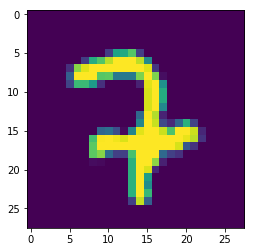

In [4]:
plt.imshow(mnist.train.next_batch(1)[0].reshape((28,28)))
plt.show()

### Create graph for train

In [18]:
BATCH_SIZE = 256
routing_iterations = 3
NCLASSES = 10

#### squash, capsule, dynamic routing

In [19]:
def squash(input):
    sj2 = tf.reduce_sum(tf.square(input), axis=-1, keep_dims=True)
    scale = sj2 / (1. + sj2)
    return scale * (input / tf.sqrt(sj2+1e-9))
def build_capsule(input, input_channels=256, output_channels=8, filter_size=9, stride=2 ):
    # w.shape = [8,8,256,8]
    cap = tf.layers.conv2d(
            inputs=input,
            filters=output_channels,
            kernel_size=[filter_size, filter_size],
            strides=(stride, stride),
            padding="valid",
            use_bias=True,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            activation=None)
    return squash(cap)
def dynamic_routing_1(input):
    # 2: for all capsule i in layer l and capsule j in layer (l + 1): bij ← 0.
    # b_ij: [1, n_caps, num_outputs, 1, 1]
    b_ij = tf.constant(np.zeros([1, input.shape[1].value, NCLASSES, 1, 1], dtype=np.float32))
    # W is [8,16] for each [1,32*6*6] feature maps conveying [1,10], so:
    with tf.variable_scope("dyn_rout"):
        W = tf.get_variable('W', shape=(1, input.shape[1].value, NCLASSES, 8, 16), dtype=tf.float32, 
                        initializer=tf.random_normal_initializer(stddev=0.02))

    # repeat input and W => [batch, 1152, 10, 8, 1]
    # W => [batch, 1152, 10, 8, 16]
    input = tf.tile(input, [1, 1, NCLASSES, 1, 1])
    W = tf.tile(W, [BATCH_SIZE, 1, 1, 1, 1])
    # [8,16]'*[8,1] = [16, 1] => [batch_size, 1152, 10, 16, 1]
    u_hat = tf.matmul(W, input, transpose_a=True)
    # 3: for r iterations do
    for r_ite in range(routing_iterations):
        print("iteration ", r_ite)
        with tf.variable_scope(str(r_ite)):
            # for all capsule i in layer l: ci ← softmax(bi
            c_ij = tf.nn.softmax(b_ij, dim=2)
            c_ij = tf.tile(c_ij, [BATCH_SIZE, 1, 1, 1, 1])
            # for all capsule j in layer (l + 1): sj <= SUM cijˆuj|i
            s_j = tf.multiply(c_ij, u_hat)
            s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True)
            v_j = squash(s_j)
            v_j_tile = tf.tile(v_j, [1, input.shape[1].value, 1, 1, 1])
            u_v_product = tf.matmul(u_hat, v_j_tile, transpose_a=True)
            # for all capsule i in layer l and capsule j in layer (l + 1): bij ← bij + ˆuj|i.vj
            b_ij = b_ij + tf.reduce_sum(u_v_product, axis=0, keep_dims=True)
    return(v_j)
def dynamic_routing_2(input):
    n_caps = input.shape.as_list()[1]
    primary_caps = tf.reshape(input,shape=(-1, 1, n_caps, 1, 8))# [batch, 1, 1154, 1, 8]
    W = tf.get_variable('W', shape=[10, n_caps, 8, 16],dtype=tf.float32)# [10, 1154, 8, 16]
    init_acumulator = tf.zeros([10, n_caps, 1, 16])
    # instead of repeatinig BATCH_SIZE, a sum+acumulator is used
    #[batch,10,1154,1,8]@[10,1154,8,16] = [...,1,16]
    u_hat_ji = tf.scan(lambda acumulator, x: tf.matmul(x, W),
                               tf.tile(primary_caps, [1, 10, 1, 1, 1]),
                               initializer=init_acumulator, name='multply')
    u_hat_ji = tf.squeeze(u_hat_ji)#[batch,10,1154,16]
    b_ij = tf.get_variable('b_ij', shape=[1,10,n_caps], dtype=tf.float32, initializer=tf.zeros_initializer())#[1,10,n_caps]
    for r_ite in range(routing_iterations):
        c_ij = tf.nn.softmax(b_ij, dim=1)#[1,10,n_caps]
        c_ij = tf.expand_dims(c_ij, axis=-1)# [1,10,n_caps,1], same cij for the batch
        s_j = tf.multiply(u_hat_ji, c_ij)#[batch,10,n_caps,16].*[1,10,n_caps,1]=[batch,10,n_caps,16]
        s_j = tf.reduce_sum(s_j, axis=2) #[batch,10,16] sum in every previous caps 
        v_j = squash(s_j)
        # b_ij = b_ij + u_hat_ji * v_j
        # b_ij = b_ij + [batch,10,1154,16].*[batch,10,1,16]
        db = tf.reduce_sum(tf.multiply(tf.expand_dims(v_j, axis=2), u_hat_ji), axis=-1)#[batch, 10, n_caps]
        b_ij = b_ij + db#[batch, 10, 16]
    return v_j
    print(input)


def decoder(input):
    v_j = tf.reshape(input, shape=(BATCH_SIZE, -1))
    dense1 = tf.contrib.layers.fully_connected(v_j, num_outputs=512)
    dense2 = tf.contrib.layers.fully_connected(dense1, num_outputs=1024)
    return tf.contrib.layers.fully_connected(dense2, num_outputs=784, activation_fn=tf.sigmoid)


In [34]:
class CapsNet():
    def __init__(self, sess=None):
        self.n_classes = 10
        self.output_len = 16
        self.caps_len = 8
        self.BATCH_SIZE = 256
        self.sess = sess

        self.x = tf.placeholder(tf.float32, shape=(self.BATCH_SIZE, 28*28))
        self.y = tf.placeholder(tf.float32, [self.BATCH_SIZE, self.n_classes])
    def build_graph(self):
        with tf.variable_scope('conv_1'):
            x_reshape = tf.reshape(self.x, shape=[-1,28,28,1])
            self.conv1 = tf.layers.conv2d(
                inputs=x_reshape,
                filters=256,
                kernel_size=[9, 9],
                padding="valid",
                use_bias=True,
                activation=tf.nn.relu)
        with tf.variable_scope('primary_caps'):
            prim_caps_chan = 32
            caps = []
            for i in range(prim_caps_chan):
                # "8 convolutional units with a 9 × 9 kernel and a stride of 2 "
                cap = build_capsule(self.conv1, 256, self.caps_len, 9, 2)
                to_concat = tf.expand_dims(cap, axis=1)
                # to_concat.shape = [batch, 1, 6, 6, 8]
                caps.append(to_concat)
            self.primary_caps = tf.concat(caps, axis=1, name="primary_caps")
            
        with tf.variable_scope('digit_caps'):
            primary_caps_shape = self.primary_caps.shape.as_list()
            n_feature_maps = primary_caps_shape[1]*primary_caps_shape[2]*primary_caps_shape[3]
            self.primary_caps = tf.reshape(self.primary_caps, shape=[-1, n_feature_maps, 1, self.caps_len, 1])           
            # dynamic routing
            digit_caps = dynamic_routing_2(self.primary_caps)
            digit_caps = tf.squeeze(digit_caps)
            self.v_j = tf.reshape(digit_caps, shape=[-1, self.n_classes, self.output_len, 1])
            self.v_j_norm = tf.squeeze(tf.norm(self.v_j, axis=2))
                
        with tf.variable_scope('decoder'):
            masked_digit_caps = tf.multiply(tf.squeeze(self.v_j), tf.reshape(self.y, (-1, self.n_classes, 1)))
            masked_digit_caps = tf.reduce_sum(masked_digit_caps, axis=1)
            self.reconstructed = decoder(masked_digit_caps)
            
        # losses
        regularization_scale = 0.0005
        m_plus = 0.9
        m_minus = 0.1
        lambda_loss = 0.5
        self.v_j_abs = tf.sqrt(tf.reduce_sum(tf.square(self.v_j), axis=2, keep_dims=True))
        positive = tf.reshape(tf.square(tf.maximum(0.0, m_plus - self.v_j_abs)), shape=(BATCH_SIZE, -1))
        negative = tf.reshape(tf.square(tf.maximum(0.0, self.v_j_abs - m_minus)), shape=(BATCH_SIZE, -1))
        # T_c is just like y (one-hot), and each output capsule has its loss, so we sum it
        T_c = self.y
        self.margin_loss = tf.reduce_sum(tf.reduce_sum(T_c*positive+lambda_loss*(1 - T_c)*negative, axis=1))
        sum_squared = tf.reduce_sum(tf.square(self.reconstructed - tf.reshape(self.x, shape=(BATCH_SIZE, -1))),axis=-1) 
        self.decoder_loss = tf.reduce_sum(sum_squared)
        self.total_loss = self.margin_loss + regularization_scale*self.decoder_loss
        
        step = tf.Variable(0, trainable=False)
        rate = tf.train.exponential_decay(0.001, step, 1, 0.99)

        self.opt = tf.train.AdamOptimizer(rate).minimize(self.total_loss)
        self.saver = tf.train.Saver()

    def train(self, n_epocs=5):
        tf.global_variables_initializer().run()
        batch_num = int(mnist.train.num_examples/self.BATCH_SIZE)
        total_batches = int(mnist.train.num_examples/self.BATCH_SIZE)
        accuracy = 0

        for epoch in tqdm(range(n_epocs)):
            print("epoch ",epoch)
            for batch in tqdm(range(total_batches)):
                batch_train = mnist.train.next_batch(self.BATCH_SIZE)
                x_ = batch_train[0] #input_x[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
                y_ = batch_train[1] #label_y[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
                _, total_loss, margin_loss, decoder_loss, reconstructed, preds= self.sess.run(
                    [self.opt, 
                    self.total_loss, 
                    self.margin_loss,
                    self.decoder_loss,
                    self.reconstructed,
                    self.v_j_norm], 
                    feed_dict={self.x: x_, self.y: y_})
                pred_labels =  np.argmax(np.array(preds),axis=1)
                print(pred_labels)
                real_labels =  np.argmax(np.array(y_),axis=1)
                print(real_labels)
                
                batch_acc = np.sum(np.array(np.equal(real_labels, pred_labels)))
                
                accuracy = accuracy + batch_acc
                print("total loss:",total_loss,"margin loss",margin_loss,"decoder loss",decoder_loss )
            plt.imshow(np.array(reconstructed[0]).reshape((28,28)))
            print("train accuracy:", accuracy/(self.BATCH_SIZE*(batch_num-1)))

            plt.show()
    def test(self):
        accuracy = 0
        for batch in tqdm(range(int(mnist.test.num_examples/self.BATCH_SIZE))):
            
            batch_test = mnist.test.next_batch(self.BATCH_SIZE)
            x_ = batch_test[0] #input_x[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
            y_ = batch_test[1] #label_y[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
            
            real_labels =  np.argmax(np.array(y_),axis=1)
            v_j_norm = self.sess.run(self.v_j_norm, feed_dict={self.x: x_})
            pred_labels =  np.argmax(np.array(v_j_norm),axis=1)
            batch_acc = np.sum(np.array(np.equal(real_labels, pred_labels)))
            accuracy = accuracy + batch_acc
            print("batch:[%d]" %(step), "batch_acc", batch_acc)
        print("accuracy:", accuracy/(self.BATCH_SIZE*(batch_num-1)))
    def _accuracy(self):
        with tf.name_scope('accuracy'):
            # digit_caps_norm = tf.norm(self._digit_caps, ord=2, axis=-1)
            self._py = tf.argmax(self._digit_caps_norm, 1)
            correct_prediction = tf.equal(tf.argmax(self._y_, 1),
                                          self._py)
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            self.accuracy = tf.reduce_mean(correct_prediction)
            tf.summary.scalar('accuracy', self.accuracy)



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  0




  0%|          | 1/214 [00:02<08:47,  2.48s/it]

[7 1 1 3 2 2 3 1 1 3 0 4 3 4 4 3 9 4 1 3 2 3 4 9 3 4 3 4 3 4 1 4 3 3 3 1 2
 2 3 2 4 4 2 3 1 2 2 6 2 3 1 1 2 6 4 2 4 9 4 3 2 4 1 4 3 2 1 3 1 3 9 1 3 7
 4 4 9 4 3 4 3 3 9 0 2 2 3 1 2 7 4 8 1 4 1 4 9 4 4 6 4 3 3 3 1 4 1 4 4 4 9
 1 3 4 4 3 1 2 1 3 7 1 9 1 1 4 1 2 3 3 2 3 3 2 1 2 7 1 2 4 4 4 3 3 2 4 4 3
 4 1 1 1 1 2 3 6 6 1 3 1 4 2 9 9 1 4 3 7 4 3 2 7 3 2 2 3 1 1 4 3 4 4 4 5 2
 3 3 3 4 2 1 4 2 6 4 3 1 7 3 2 9 3 4 4 2 6 1 1 2 4 7 1 2 9 3 3 4 4 1 4 2 4
 4 2 1 4 3 4 6 4 4 4 2 4 5 3 4 2 7 4 3 3 2 9 3 9 4 9 2 4 5 2 7 4 1 4]
[2 7 9 6 3 2 9 7 4 6 9 7 4 1 3 2 8 2 7 6 7 0 4 3 0 6 8 7 0 4 7 5 2 4 0 7 1
 0 7 9 8 9 5 4 7 8 3 0 2 6 9 4 8 8 2 1 7 4 5 4 4 7 9 6 6 0 2 6 7 2 5 8 7 8
 8 4 2 1 6 1 7 2 2 4 1 9 4 4 1 3 8 3 5 4 4 5 6 9 6 4 3 6 0 2 7 3 9 9 7 7 2
 9 9 5 1 2 4 2 9 0 3 7 3 4 7 8 7 1 4 4 0 3 6 3 7 5 2 7 0 8 9 8 9 6 5 4 7 3
 6 7 9 0 6 1 0 4 4 6 0 4 3 2 8 8 2 1 6 2 7 7 5 4 6 1 2 6 7 7 5 3 6 5 9 4 2
 2 9 5 6 0 7 1 1 1 9 0 0 2 8 1 4 3 8 5 2 1 8 4 1 8 4 9 1 2 4 8 5 7 4 5 1 5
 3 1 7 8 0 5 4 8 8 5 1 6 1 0 1



  1%|          | 2/214 [00:04<08:02,  2.27s/it]

[8 4 3 2 8 0 7 3 4 4 2 4 8 4 2 4 4 8 1 7 7 1 3 1 1 4 3 6 4 2 7 2 3 3 7 8 4
 3 8 4 4 7 8 8 2 1 7 1 8 8 2 4 2 1 1 0 8 0 6 4 4 2 8 1 4 3 3 4 4 2 4 3 3 9
 3 4 0 1 2 8 2 4 1 0 7 9 8 4 8 3 4 0 7 4 7 7 4 8 8 2 1 4 8 1 1 1 8 0 4 8 3
 8 4 3 7 4 0 1 4 7 6 8 4 4 1 3 8 2 4 3 8 2 2 3 4 8 8 2 3 1 4 1 7 4 4 8 4 8
 3 7 3 4 0 6 4 0 3 8 4 2 4 8 6 8 2 4 1 3 8 3 3 2 2 4 2 8 8 4 4 8 8 4 8 8 8
 0 3 3 2 4 8 6 4 4 0 3 3 3 8 2 8 1 7 1 8 4 1 3 2 4 2 0 2 4 1 4 3 3 8 7 9 3
 2 4 3 2 4 4 3 1 2 8 8 4 6 7 4 6 2 3 2 8 7 4 0 4 4 2 2 2 4 4 4 4 4 2]
[6 4 2 2 6 0 7 3 9 6 3 9 7 8 1 4 6 5 1 7 7 1 5 1 1 6 3 6 4 7 7 3 3 5 2 9 9
 5 0 0 8 7 5 3 2 1 7 1 5 9 7 4 2 1 1 0 5 0 6 4 5 2 8 1 0 3 5 4 4 3 6 9 8 9
 3 6 0 1 2 5 2 6 1 0 9 9 9 9 9 5 4 0 7 4 7 7 8 9 8 6 1 6 8 1 1 1 8 0 4 8 3
 8 6 5 7 2 0 1 9 7 6 5 4 8 1 3 6 8 9 5 5 1 6 3 4 8 7 2 5 1 9 1 7 9 6 1 4 8
 9 7 3 6 0 6 4 0 3 5 6 2 9 6 6 1 2 9 1 3 4 0 3 2 7 9 7 8 1 9 4 8 5 4 8 5 8
 0 3 3 6 4 0 6 9 4 0 8 3 3 9 2 3 1 7 1 6 4 1 5 2 4 0 0 2 9 1 6 3 3 9 7 9 5
 2 9 5 0 4 0 5 1 2 8 1 4 6 7 4


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  1%|▏         | 3/214 [00:06<07:55,  2.25s/it]

[9 9 6 9 9 6 6 9 6 9 1 9 1 9 9 9 9 6 0 1 1 6 9 9 9 9 6 9 9 0 6 9 0 9 6 0 9
 9 9 9 1 9 0 9 9 9 1 9 9 6 9 0 9 1 9 9 1 1 1 6 9 9 9 6 9 6 9 9 1 9 9 1 9 1
 0 6 1 9 6 1 9 9 6 9 9 1 9 9 9 1 9 9 1 1 9 9 6 1 1 9 9 1 9 0 9 6 9 6 0 9 9
 9 9 9 1 9 1 1 9 9 9 6 9 9 9 9 6 0 9 6 6 1 0 9 6 9 9 0 6 9 9 6 9 6 6 9 9 9
 9 0 9 9 0 9 6 0 9 9 9 6 6 9 9 9 9 9 6 9 9 1 9 9 0 0 9 1 6 9 0 9 9 9 6 6 9
 6 6 9 9 6 9 0 0 9 9 9 9 1 6 9 9 9 9 9 0 9 9 6 9 9 6 1 9 1 6 1 9 9 9 0 9 9
 9 9 0 6 0 1 0 6 9 9 6 9 9 6 9 9 1 9 9 0 9 6 1 0 6 9 1 6 9 9 9 6 9 6]
[7 1 6 4 3 8 6 7 6 3 1 8 1 3 4 8 8 2 0 1 1 2 7 9 4 2 6 8 8 0 2 9 0 3 6 0 4
 2 7 3 1 3 0 8 5 5 1 9 7 4 2 0 9 5 8 5 8 1 1 6 4 8 4 6 4 2 9 8 1 4 4 2 7 1
 0 2 1 3 6 1 9 8 5 3 9 8 5 8 8 2 7 5 1 1 8 4 6 1 1 5 2 1 5 0 9 6 3 8 0 7 5
 8 7 3 1 1 1 1 5 9 5 6 9 5 4 7 6 0 8 2 6 2 0 9 6 5 7 0 6 5 7 2 0 4 2 9 7 5
 8 0 7 1 0 1 6 0 4 3 7 2 2 3 0 5 4 4 0 8 3 2 7 7 5 0 7 1 2 5 0 9 0 9 6 6 5
 6 6 4 0 6 8 0 0 5 7 5 4 2 6 5 9 7 2 3 0 9 7 6 4 2 6 1 3 1 6 1 3 7 5 0 7 4
 8 8 0 8 0 1 0 6 7 2 6 3 5 6 3


  2%|▏         | 4/214 [00:08<07:47,  2.22s/it]

[9 9 9 6 8 9 9 1 9 0 9 0 1 6 9 1 9 2 2 0 2 9 9 9 8 6 5 9 8 6 9 8 1 0 9 0 1
 9 9 0 9 0 6 9 9 5 9 1 6 9 9 9 0 1 0 6 2 8 2 6 9 6 0 9 1 2 6 6 1 5 9 9 9 1
 9 9 9 9 8 9 9 9 9 1 1 9 6 9 6 2 9 5 9 1 1 9 2 1 0 9 0 9 9 9 5 9 9 9 6 2 9
 9 9 9 9 9 1 6 1 9 6 6 1 2 1 6 2 1 6 6 1 1 6 8 1 5 9 9 0 0 2 5 6 6 1 5 9 9
 2 9 9 9 6 1 9 6 9 1 1 1 0 1 9 9 5 1 9 9 9 0 6 9 6 9 9 0 2 1 0 2 0 1 9 1 1
 9 9 1 9 1 1 2 9 1 9 9 9 1 9 0 9 0 9 1 9 8 6 0 6 5 9 1 9 1 0 0 6 1 6 6 6 9
 6 6 9 1 0 9 9 9 9 9 1 6 9 1 1 6 1 9 9 9 9 1 0 1 1 1 0 1 9 9 1 0 1 8]
[0 9 8 3 8 5 9 1 4 0 7 0 1 6 6 1 9 2 2 0 2 5 9 2 8 6 5 9 8 6 3 8 1 0 7 0 3
 4 4 0 9 0 6 3 7 5 3 2 6 7 9 7 0 2 0 6 2 8 2 2 4 6 0 9 1 2 6 4 1 5 4 8 7 2
 8 9 9 7 2 3 9 9 4 8 1 7 2 3 2 2 0 3 9 3 3 4 2 2 5 7 7 5 9 9 3 7 0 3 6 2 9
 9 4 8 8 7 1 6 1 5 4 6 5 2 1 4 2 8 6 6 1 1 6 8 1 5 4 7 0 0 2 5 6 5 5 5 5 7
 3 7 7 4 2 1 3 6 4 3 6 1 0 1 7 7 3 7 7 7 4 0 2 9 5 5 7 0 2 8 0 2 0 6 4 5 8
 7 7 1 4 5 8 2 7 1 9 2 7 1 7 0 8 5 7 3 9 8 6 0 6 3 7 1 9 5 0 0 6 8 4 6 6 4
 6 6 9 3 5 8 4 5 7 4 1 6 5 1 2


  2%|▏         | 5/214 [00:11<07:40,  2.20s/it]

[7 5 3 2 1 1 2 0 3 1 0 3 2 4 8 7 5 6 2 7 7 0 0 8 8 3 8 3 4 7 7 2 7 1 4 6 0
 3 2 2 8 0 8 7 2 2 2 2 4 8 2 1 2 1 0 4 8 8 8 2 0 2 1 4 3 1 7 0 4 4 4 2 7 2
 1 2 0 4 7 6 3 7 8 7 8 6 7 7 1 7 8 2 0 7 0 3 5 7 2 2 8 2 0 6 6 7 2 1 8 3 7
 5 8 3 2 3 8 2 7 6 0 2 2 7 3 6 8 7 0 4 0 1 8 0 1 3 2 0 2 5 8 2 2 7 8 1 4 4
 9 8 6 1 3 2 1 6 1 7 2 0 0 1 0 1 7 5 8 8 2 2 2 8 4 8 2 0 8 7 9 6 8 8 7 7 8
 8 0 3 8 6 1 3 0 2 3 2 1 4 2 0 5 8 2 2 7 7 2 4 4 8 7 1 2 9 2 2 7 7 7 7 7 8
 1 4 5 8 8 2 2 8 5 8 0 4 0 8 2 1 7 2 3 1 2 7 3 2 7 8 2 7 1 2 2 4 7 1]
[2 5 3 3 5 6 6 9 3 1 5 3 3 4 5 7 5 6 0 9 7 0 0 9 6 5 6 3 9 7 9 2 7 1 4 6 0
 3 2 6 8 0 4 9 3 2 2 2 4 6 2 1 2 1 6 9 8 8 9 2 0 4 5 9 3 1 7 0 4 9 5 6 7 4
 1 2 0 4 7 6 3 7 9 7 6 6 7 7 1 8 8 9 0 7 0 3 5 7 4 6 6 6 0 6 6 4 2 1 6 3 9
 5 8 3 6 3 9 2 7 6 8 2 9 7 3 6 8 7 0 9 0 1 6 0 1 3 6 5 2 5 8 2 1 7 8 9 4 9
 9 8 6 1 3 2 1 6 1 7 2 0 6 2 0 1 9 5 5 4 7 4 4 8 4 4 2 0 5 7 9 6 8 8 7 7 8
 8 0 3 8 6 5 3 6 8 3 2 1 4 2 0 5 8 4 2 2 7 2 4 4 8 3 7 2 9 2 2 7 7 7 3 7 1
 1 9 5 8 8 2 2 8 5 8 0 4 0 6 2


  3%|▎         | 6/214 [00:13<07:37,  2.20s/it]

[2 5 7 7 0 3 8 7 2 1 3 8 2 0 7 8 3 3 1 3 4 7 8 7 7 2 0 0 0 1 7 0 7 7 8 8 3
 1 8 8 4 8 6 6 1 8 6 1 8 7 4 4 3 1 0 7 7 0 2 3 5 7 3 4 6 7 7 4 3 3 3 7 4 7
 8 1 2 7 7 1 7 8 8 4 1 4 3 7 4 7 7 4 8 1 8 0 4 8 8 4 4 0 7 2 7 0 1 6 8 1 6
 2 2 8 7 2 2 8 2 2 3 8 8 0 4 2 8 3 7 8 7 8 2 4 7 4 2 7 8 3 4 2 3 0 2 0 1 3
 1 4 4 7 5 0 3 7 7 7 7 8 7 7 2 8 4 1 3 1 8 7 7 4 0 1 1 7 8 5 2 4 4 1 2 8 8
 6 0 5 4 4 1 3 4 1 7 7 0 7 7 3 7 4 2 7 2 3 7 8 2 3 7 0 7 0 7 4 7 1 1 4 4 4
 2 2 0 3 7 5 7 1 1 3 1 7 0 2 6 3 0 7 6 7 4 4 1 6 7 0 3 4 3 0 7 2 3 1]
[1 5 7 7 0 3 1 7 2 5 3 9 4 0 7 8 3 3 1 5 9 7 8 0 7 2 0 0 0 1 7 0 7 7 8 8 5
 7 8 8 4 8 6 6 1 5 6 1 5 9 4 6 8 1 0 7 9 0 6 3 5 7 3 4 6 7 7 4 3 5 4 7 4 7
 4 1 5 9 6 1 2 8 8 9 1 9 3 9 6 7 9 4 6 1 8 0 4 8 8 4 9 9 7 3 5 0 1 6 8 1 6
 8 1 8 7 2 4 8 3 2 3 6 8 0 9 3 8 5 2 8 7 6 2 4 7 5 2 7 8 9 9 8 8 0 2 0 8 5
 1 9 9 9 5 0 5 9 7 0 7 6 7 9 1 1 4 1 3 1 5 7 7 5 0 1 1 9 8 5 2 4 9 1 2 8 8
 6 0 5 9 4 6 8 9 1 9 9 0 2 7 3 5 9 2 7 2 3 9 7 2 3 3 0 7 0 2 9 7 1 1 9 4 9
 7 2 0 5 7 5 5 1 1 9 1 9 0 6 6


  3%|▎         | 7/214 [00:15<07:34,  2.20s/it]

[1 7 3 3 0 7 0 3 5 6 6 6 1 0 6 4 3 0 7 7 2 0 4 7 1 7 2 4 5 1 4 4 4 6 7 1 1
 7 4 3 0 7 0 3 4 3 1 0 0 7 3 1 7 7 7 0 5 7 3 1 6 4 1 7 4 3 1 1 2 0 4 1 3 6
 7 7 3 2 1 7 3 7 6 6 6 7 0 8 8 7 3 3 4 1 4 4 7 4 7 3 7 7 5 1 4 3 2 4 0 6 4
 8 4 6 3 4 7 1 4 4 1 6 3 7 6 0 6 6 5 1 7 3 7 4 1 4 1 3 7 4 3 0 1 4 1 7 1 6
 7 3 8 1 6 0 2 4 4 5 1 7 4 7 6 2 1 1 4 4 1 2 2 8 4 4 1 0 5 4 7 1 4 5 3 3 7
 6 7 7 0 7 1 7 1 0 1 6 0 4 1 2 1 3 7 7 1 6 0 7 4 1 3 3 7 2 7 5 4 1 2 0 5 4
 6 1 5 7 1 4 0 7 7 6 4 6 7 7 8 7 1 4 4 3 4 0 5 2 2 4 3 1 7 2 1 4 4 3]
[1 3 3 8 0 9 0 3 5 6 6 6 8 7 6 9 3 0 8 7 2 0 4 8 5 7 2 4 5 6 9 4 4 6 5 1 1
 3 4 8 7 7 0 8 4 2 1 0 0 7 3 5 9 7 7 0 5 7 3 1 6 4 1 9 4 3 1 1 2 0 4 1 3 6
 7 2 3 2 1 7 5 7 6 6 6 7 5 8 8 7 1 3 9 1 4 4 7 9 7 3 7 4 5 1 9 3 2 4 0 6 9
 8 4 5 3 3 5 1 4 6 8 4 3 2 6 6 6 6 5 2 7 3 9 4 1 4 1 5 7 4 8 0 1 4 1 9 1 6
 7 3 8 1 6 0 2 9 3 5 8 2 4 7 6 2 1 1 9 2 1 2 2 8 9 4 8 0 5 4 7 1 4 5 3 3 9
 6 7 9 0 7 8 9 7 0 1 6 0 6 1 7 8 3 3 9 1 6 0 7 5 1 5 5 7 2 8 5 9 1 2 0 6 9
 6 2 8 7 1 9 3 8 0 6 4 6 7 7 8


  4%|▎         | 8/214 [00:17<07:31,  2.19s/it]

[1 9 0 0 5 1 6 1 1 7 8 6 1 0 5 1 3 3 4 7 6 6 4 7 4 1 7 6 2 4 6 9 4 1 7 1 1
 4 0 4 9 6 7 8 3 4 6 5 6 3 3 7 9 9 0 3 7 3 7 4 9 5 5 3 0 7 6 2 0 2 8 3 2 7
 6 0 6 0 5 7 4 0 4 4 3 7 5 2 1 5 3 7 2 1 7 0 4 6 3 6 8 6 1 5 7 1 9 0 6 5 8
 5 6 5 3 6 6 7 2 6 0 3 3 1 7 8 1 4 6 5 6 3 7 9 2 4 0 9 8 8 1 3 1 2 4 0 1 7
 3 3 0 1 9 3 4 3 1 9 3 6 1 3 6 4 3 0 1 8 3 7 5 9 0 3 9 3 0 4 8 7 1 1 6 8 5
 8 9 7 7 6 8 1 7 8 7 4 1 7 5 6 3 7 1 8 1 0 8 3 1 1 4 7 7 2 6 4 3 0 4 0 4 3
 5 0 1 7 7 2 6 4 4 1 6 9 3 7 2 5 3 5 4 7 7 0 3 0 6 6 3 6 8 0 3 4 3 1]
[2 9 0 0 5 1 6 2 1 3 8 4 1 0 5 1 3 3 4 7 6 4 8 7 4 8 1 8 2 4 6 9 4 3 7 8 6
 4 0 4 9 6 7 8 3 9 6 5 6 3 2 7 4 4 0 3 7 3 7 9 9 5 3 3 0 7 6 2 0 2 8 5 2 7
 6 0 6 0 3 9 4 0 3 4 3 9 8 2 1 5 3 7 2 8 9 0 4 6 3 8 2 8 1 5 9 1 9 6 9 8 8
 5 6 5 3 6 6 7 2 2 0 3 3 1 2 8 1 4 6 3 2 3 7 5 2 2 0 3 8 8 1 5 1 2 4 7 1 7
 3 5 0 2 9 3 2 5 1 9 9 6 1 3 6 4 9 0 1 8 5 2 5 9 9 3 9 2 0 4 8 7 1 8 6 8 5
 8 9 7 7 6 8 7 7 8 2 4 1 7 5 6 3 7 2 8 8 0 8 3 1 1 4 7 9 2 6 9 8 0 4 9 9 3
 6 0 1 7 0 2 6 4 4 8 6 9 3 7 2


  4%|▍         | 9/214 [00:19<07:27,  2.18s/it]

[7 9 0 1 7 4 7 3 4 3 8 4 1 1 3 0 6 8 2 2 8 7 3 0 9 1 4 6 8 2 2 8 9 9 9 7 2
 2 3 9 9 6 1 1 0 0 9 6 8 1 7 8 3 5 9 4 8 3 8 6 8 1 6 6 0 7 4 6 8 7 6 3 3 8
 6 5 6 3 1 3 8 4 7 7 2 8 7 2 1 7 3 7 0 0 2 2 3 7 0 2 0 6 8 0 6 6 3 6 8 4 8
 6 1 7 1 1 0 0 2 8 2 4 6 8 2 1 6 4 7 7 8 0 4 7 8 2 3 3 1 0 1 3 0 9 4 0 3 6
 1 9 0 3 1 0 6 4 8 8 1 9 0 0 8 6 0 8 2 9 7 2 2 3 0 6 0 4 9 0 7 3 4 8 6 8 3
 2 7 5 1 6 9 1 9 4 8 2 1 1 9 1 2 7 1 7 1 1 0 5 1 8 1 9 0 2 4 1 9 8 7 2 4 3
 2 1 8 3 2 3 0 9 8 6 9 9 5 2 1 0 8 7 5 9 7 4 3 3 9 6 5 4 3 0 7 6 0 2]
[7 8 0 8 7 4 9 3 4 2 5 4 1 8 3 0 6 8 5 9 8 5 3 0 9 1 4 6 8 9 2 8 9 9 9 7 7
 2 3 9 9 6 1 6 0 0 9 6 9 1 7 8 3 5 9 4 1 3 2 6 8 1 6 6 0 7 4 6 8 9 9 3 3 8
 6 5 6 3 1 3 8 4 7 7 6 1 7 2 1 7 3 7 0 0 2 2 3 6 0 2 0 6 8 0 6 6 3 6 8 2 9
 5 6 7 9 1 0 0 7 4 2 4 6 8 2 1 6 4 4 2 8 0 4 9 9 2 3 3 1 6 9 3 5 9 4 5 3 6
 5 9 0 5 8 2 6 4 8 8 1 9 7 0 8 9 0 5 7 9 5 6 2 3 0 6 0 4 9 0 7 2 4 3 2 5 5
 2 7 5 1 6 9 7 9 4 5 2 1 1 9 1 2 7 8 7 1 1 0 5 1 8 1 9 0 7 4 1 9 8 7 2 4 3
 2 8 8 5 2 3 7 9 9 6 9 9 5 2 1


  5%|▍         | 10/214 [00:21<07:26,  2.19s/it]

[3 8 5 6 9 6 9 6 7 6 4 2 1 7 8 9 3 7 2 1 3 3 2 2 7 6 2 9 7 5 9 1 9 8 6 2 6
 2 9 3 5 1 6 8 9 8 6 6 6 7 9 8 9 0 7 0 2 7 0 5 0 2 0 0 6 9 1 2 7 1 6 8 8 0
 2 9 3 1 0 7 1 7 9 0 7 2 0 2 9 8 2 5 6 6 8 1 4 1 4 2 9 7 8 7 2 9 7 8 9 7 6
 3 4 5 1 1 6 2 0 9 9 3 0 2 3 6 1 3 2 7 6 7 7 9 3 3 9 2 7 1 2 9 1 6 8 6 7 8
 8 4 6 7 7 3 3 6 7 0 9 0 1 0 7 1 5 9 3 3 8 4 6 1 0 9 4 1 6 3 6 2 2 2 2 8 0
 0 2 1 1 7 6 9 4 7 8 2 6 2 0 0 2 9 9 7 9 0 3 4 6 1 4 1 6 2 1 0 6 1 6 7 2 2
 1 0 1 1 7 6 0 7 2 0 2 9 6 3 0 1 6 1 2 2 1 1 2 4 1 9 8 6 6 2 1 8 3 5]
[3 8 5 6 4 5 9 6 7 6 4 2 1 7 5 4 3 7 7 1 5 3 2 3 7 2 2 4 7 5 9 5 9 8 6 2 6
 5 9 3 5 1 6 8 9 8 6 6 6 7 5 8 4 5 3 0 8 8 3 5 0 2 0 0 6 4 1 2 7 2 6 3 8 0
 0 9 3 1 0 6 3 7 9 0 7 7 0 2 8 8 3 5 6 6 8 6 4 1 4 2 8 7 8 7 2 9 7 4 9 7 6
 3 4 5 1 1 2 2 3 9 9 3 0 7 3 5 1 3 2 7 6 7 2 5 3 3 4 2 6 6 2 9 1 6 8 6 0 8
 5 5 6 0 8 3 3 6 0 0 9 0 6 0 7 1 3 9 3 3 8 4 6 1 0 4 4 1 6 3 2 2 2 2 6 8 0
 0 2 1 1 7 6 9 4 2 8 2 6 2 0 9 2 9 4 7 9 0 3 4 5 1 4 8 6 7 1 0 4 1 6 7 2 2
 1 0 1 1 7 6 0 7 2 0 3 9 6 3 6


  5%|▌         | 11/214 [00:24<07:23,  2.19s/it]

[1 7 9 2 7 9 2 3 2 2 9 1 3 7 0 7 1 2 9 1 3 9 3 9 3 3 5 0 6 7 0 9 5 6 0 6 8
 8 7 5 7 5 2 8 3 2 3 9 6 7 0 0 9 9 0 9 7 1 9 4 6 2 8 0 4 2 2 7 3 3 7 9 3 4
 0 5 3 3 9 3 3 6 3 1 6 8 1 3 1 2 3 9 2 4 9 0 9 4 2 6 5 9 7 7 3 1 7 6 2 1 9
 2 1 9 2 3 6 0 1 2 2 3 3 0 7 6 6 1 9 5 1 1 3 2 7 0 8 7 7 6 7 0 0 7 2 3 6 2
 7 0 9 6 9 2 0 3 9 9 1 0 6 8 9 8 9 8 4 5 5 3 1 4 1 1 1 9 1 6 7 3 6 0 0 4 9
 3 9 1 6 6 6 1 7 0 9 8 7 7 1 6 2 9 4 5 0 2 0 7 1 3 2 1 9 1 1 1 3 9 0 9 7 2
 7 3 1 0 0 3 2 2 9 7 7 8 9 9 6 2 9 1 9 2 1 5 8 1 3 8 7 1 6 1 8 7 7 2]
[1 7 4 2 7 9 2 3 2 2 8 9 3 7 0 6 6 9 9 1 3 5 3 9 3 3 1 7 6 7 0 9 5 4 5 6 8
 8 7 5 7 5 2 8 3 2 3 4 6 7 9 6 9 4 0 9 3 1 9 5 6 2 8 0 4 2 2 2 3 4 7 3 3 4
 0 5 3 3 9 3 5 6 9 1 6 8 1 3 6 8 3 9 2 4 8 9 9 4 2 6 5 4 7 3 3 1 7 6 2 1 9
 3 1 9 2 8 4 5 1 2 2 3 8 0 7 6 4 6 9 5 1 1 8 2 4 2 8 7 7 6 2 0 5 6 2 3 6 2
 9 5 4 6 9 2 0 3 8 4 3 0 6 8 9 8 9 8 4 5 5 3 1 4 2 1 1 9 1 6 7 1 6 0 0 4 9
 5 9 1 6 6 6 2 7 9 9 8 5 5 9 6 3 9 4 5 8 5 0 8 1 3 4 8 5 1 1 1 3 8 7 4 7 2
 7 3 8 0 0 3 2 2 7 9 7 8 9 9 6


  6%|▌         | 12/214 [00:26<07:22,  2.19s/it]

[3 5 1 2 6 1 6 3 9 0 9 3 0 5 1 2 7 0 1 0 3 9 7 1 8 6 3 7 2 9 3 2 6 7 9 6 9
 9 3 3 9 6 0 1 7 4 3 1 9 8 2 7 9 1 7 0 3 1 3 0 1 7 7 7 3 7 4 8 8 9 2 7 2 6
 6 8 3 3 6 8 6 7 9 0 3 2 3 3 2 2 3 8 6 2 3 6 1 7 9 9 1 0 4 8 3 8 1 7 2 2 3
 1 9 0 4 4 7 7 5 1 9 7 8 6 8 9 3 0 1 1 6 1 2 7 1 9 1 5 1 0 3 0 7 2 3 2 5 2
 1 7 2 5 1 7 7 2 9 1 9 1 8 9 1 9 4 6 7 0 4 2 4 2 6 3 0 5 7 0 7 1 7 3 9 7 0
 2 2 8 1 1 7 2 9 6 4 4 4 7 9 4 7 0 1 4 2 7 2 1 0 7 9 7 0 9 6 2 6 0 8 2 9 6
 3 1 0 0 3 9 8 0 0 0 3 7 3 1 0 5 2 7 8 7 8 2 4 6 7 3 1 9 3 7 1 2 3 6]
[3 5 1 2 4 1 6 3 9 0 9 3 0 3 1 3 8 0 1 0 3 9 7 1 8 6 9 7 2 9 5 2 6 9 4 6 4
 9 3 3 9 6 0 8 9 4 8 1 9 8 7 7 4 1 7 0 3 1 3 0 1 7 9 7 3 7 4 8 8 9 2 7 9 6
 6 8 3 3 4 8 2 7 4 0 3 2 3 3 2 2 3 8 4 2 3 6 1 9 9 9 1 0 4 3 3 8 8 7 2 2 3
 8 9 0 4 4 7 7 5 1 9 9 8 6 8 8 3 0 1 1 6 1 3 9 5 9 8 5 4 0 3 0 7 4 3 2 5 7
 1 7 2 5 1 7 7 2 4 1 9 1 8 8 1 4 4 6 3 0 4 9 4 8 6 3 0 5 7 0 7 1 7 3 9 7 0
 6 2 8 1 1 7 2 4 6 4 4 4 7 9 4 7 0 1 4 2 7 3 1 0 5 9 7 0 9 6 8 6 8 8 2 5 6
 5 1 0 8 3 4 8 0 0 0 9 7 5 1 0


  6%|▌         | 13/214 [00:28<07:20,  2.19s/it]

[9 0 7 6 3 0 6 3 8 1 6 6 7 2 9 3 4 1 2 7 7 3 4 3 8 7 8 1 3 9 2 9 2 2 6 9 2
 2 6 4 7 3 7 3 6 1 2 2 7 4 7 5 1 2 2 5 5 7 9 6 6 1 6 4 6 0 2 8 8 3 5 8 1 8
 8 8 8 7 1 1 6 7 2 9 0 5 0 3 7 2 5 3 9 1 8 2 2 3 3 6 7 8 1 8 1 8 0 3 1 6 2
 4 8 2 0 8 6 8 9 0 1 8 7 1 7 6 5 1 2 0 8 7 2 1 6 3 8 5 1 3 6 5 4 7 0 2 1 7
 8 9 3 7 3 2 9 2 6 6 4 3 7 0 3 5 6 8 3 3 9 7 5 5 4 2 4 6 7 3 4 1 7 7 8 0 0
 3 7 2 7 8 4 8 0 1 2 3 4 6 1 1 8 8 4 6 6 7 9 7 9 7 1 1 2 9 1 7 0 2 2 3 3 5
 8 1 0 0 2 4 9 2 7 3 3 2 0 6 2 8 5 7 2 2 2 1 6 6 3 0 3 3 4 2 6 1 0 7]
[9 0 7 6 3 6 5 3 8 1 6 6 7 2 9 5 4 1 3 7 7 3 4 5 9 2 8 1 5 9 2 9 0 5 6 9 1
 2 6 4 7 3 7 9 6 1 2 2 7 4 7 5 1 2 2 5 5 7 9 6 6 1 6 4 6 0 2 8 8 8 5 9 1 9
 8 8 8 7 1 1 6 7 2 9 0 5 0 5 7 9 5 3 9 1 8 2 2 3 3 6 7 8 1 8 1 8 0 3 1 6 2
 4 1 2 0 8 6 9 9 0 1 8 7 1 5 6 5 1 2 0 8 7 2 1 6 8 4 3 1 3 4 9 4 9 0 2 1 8
 9 9 3 7 5 3 9 6 6 6 4 3 7 0 3 5 6 8 5 3 3 5 5 5 5 2 4 6 7 3 4 4 7 7 9 0 0
 3 7 2 2 8 4 4 0 1 2 3 4 6 1 1 8 8 4 6 6 7 9 9 9 7 1 1 2 9 1 7 0 9 2 3 5 5
 8 1 0 0 2 4 9 2 9 3 3 2 0 6 0


  7%|▋         | 14/214 [00:30<07:18,  2.19s/it]

[9 7 7 8 3 1 8 2 3 6 9 9 1 7 7 6 0 0 4 7 0 8 6 5 3 2 3 9 8 6 2 1 9 3 8 1 6
 9 7 7 7 0 3 8 1 6 6 3 3 3 4 6 8 0 9 4 7 0 1 3 5 5 4 6 3 2 4 6 6 8 6 6 8 2
 2 8 7 9 7 1 2 7 6 3 1 3 5 7 9 6 6 5 0 3 1 1 8 6 1 7 0 4 5 1 2 4 4 2 8 7 6
 2 7 3 8 6 2 1 6 6 6 6 7 1 1 7 6 1 1 7 7 2 8 2 4 5 1 1 8 4 3 4 1 0 7 3 4 9
 6 2 7 4 3 1 7 5 3 5 0 3 0 2 0 5 7 2 6 6 7 8 1 4 7 8 9 3 2 4 6 2 1 0 2 3 6
 0 4 4 1 4 8 8 8 3 8 3 9 6 0 3 9 0 1 2 1 6 3 0 8 1 1 9 2 0 6 7 4 8 0 2 8 3
 5 2 3 8 6 1 8 4 7 1 4 6 5 8 1 0 8 9 2 1 9 1 5 8 0 6 7 4 3 8 8 3 4 8]
[9 7 7 8 3 7 8 2 8 6 9 9 1 7 7 6 0 6 4 7 5 8 6 5 5 2 3 9 8 6 2 1 9 3 8 1 6
 9 9 2 7 0 3 1 1 6 6 8 2 3 4 6 8 0 9 6 7 0 1 3 5 8 4 6 3 2 4 6 6 9 6 6 8 2
 2 8 7 9 9 1 2 7 6 3 1 3 5 7 9 6 6 5 0 3 1 1 8 5 1 2 6 4 5 1 1 4 4 2 8 7 6
 2 9 3 8 6 2 1 6 6 6 6 7 1 1 7 6 1 1 7 7 2 8 2 4 5 1 1 8 4 3 4 1 0 7 6 4 9
 6 2 7 4 3 1 7 5 3 6 0 8 0 2 0 5 2 2 6 6 7 8 1 4 7 8 9 3 2 9 6 5 1 0 2 3 6
 0 4 4 1 4 8 8 8 3 8 3 9 8 6 2 9 0 7 2 1 6 3 0 9 1 1 9 2 0 6 7 6 8 0 2 1 3
 5 7 3 8 6 1 8 4 7 1 4 6 5 8 1


  7%|▋         | 15/214 [00:32<07:16,  2.19s/it]

[2 3 6 3 3 5 4 2 3 8 8 6 1 8 8 0 0 5 6 4 1 1 2 5 8 7 5 6 6 6 6 0 9 4 5 3 4
 0 1 8 0 6 2 0 7 1 0 1 7 4 6 3 3 7 4 4 9 7 3 4 1 4 5 4 6 9 4 6 8 6 1 6 8 1
 9 3 1 7 0 7 3 8 4 8 6 7 5 6 9 1 1 2 5 6 6 0 4 5 5 0 6 3 2 1 9 4 1 1 3 4 4
 4 5 7 9 4 2 4 1 4 1 7 1 0 5 1 6 1 8 2 9 3 7 0 8 4 1 7 1 1 1 9 4 0 1 7 6 4
 2 6 6 0 1 6 0 1 7 1 8 7 4 9 7 6 4 4 7 0 5 3 0 9 6 4 6 2 1 4 8 1 6 0 0 4 3
 2 2 4 7 4 4 6 0 4 6 9 6 2 6 1 1 0 7 4 4 4 0 9 1 5 3 5 1 2 1 4 1 6 6 8 0 7
 4 6 4 2 0 3 5 8 1 3 8 9 1 1 3 7 1 0 7 8 3 2 3 7 1 7 4 2 3 4 7 3 2 7]
[2 3 6 5 3 5 9 2 5 8 8 6 1 8 8 0 0 5 6 9 1 1 2 9 8 7 5 6 6 6 6 0 9 4 5 3 8
 0 1 8 0 6 2 0 7 1 0 1 9 4 6 3 5 0 2 4 9 7 5 4 1 4 3 6 2 9 4 6 8 6 1 6 8 1
 9 3 1 9 0 7 3 8 4 8 6 7 5 6 9 1 1 2 5 5 6 0 4 5 5 0 6 3 2 1 9 9 1 1 3 4 4
 4 5 7 9 6 2 4 1 4 2 7 1 0 5 1 6 5 8 2 9 3 7 0 8 4 2 7 7 1 1 9 4 5 1 7 0 4
 2 6 4 0 8 6 0 1 7 1 8 7 9 9 7 6 2 4 7 0 5 3 0 9 6 4 6 2 1 9 5 1 6 0 0 4 3
 2 2 5 2 4 4 6 0 4 6 9 2 2 2 1 1 0 7 4 4 4 0 9 1 5 3 5 1 2 1 4 1 2 6 8 0 0
 4 2 4 2 0 3 5 8 1 3 8 9 1 1 5


  7%|▋         | 16/214 [00:35<07:14,  2.20s/it]

[2 3 4 1 1 2 3 7 1 1 7 6 9 2 7 7 2 6 1 4 8 0 4 3 6 3 7 6 8 8 9 7 4 8 6 4 8
 9 4 6 9 4 4 4 0 3 6 0 6 4 6 1 1 6 3 9 0 0 4 0 0 4 1 3 8 3 3 6 9 1 2 7 7 9
 1 7 1 4 1 4 0 0 1 6 8 3 8 3 0 3 3 9 6 6 1 0 8 6 1 3 7 2 6 4 0 7 7 9 1 8 5
 4 7 2 8 7 9 0 6 9 7 0 6 0 6 6 3 9 7 1 0 0 1 1 7 3 8 6 1 4 5 1 6 7 7 4 4 8
 5 4 9 2 4 5 7 1 6 5 2 8 4 3 4 7 4 8 5 1 4 7 4 2 9 6 5 4 6 6 1 2 4 2 8 3 7
 3 4 1 3 7 0 7 8 4 7 0 5 5 8 0 4 3 3 4 0 0 0 6 3 5 4 7 3 4 8 1 0 6 7 8 6 7
 7 3 1 7 8 8 6 5 9 1 0 6 9 8 6 8 8 7 1 6 8 7 4 5 8 7 6 1 9 7 8 1 2 7]
[2 3 4 1 1 2 8 7 2 1 7 6 9 2 7 7 9 6 1 9 8 5 4 3 6 3 7 6 8 8 9 7 4 8 6 4 8
 9 4 6 2 4 5 6 0 3 6 0 6 4 6 1 1 6 3 9 0 6 5 0 0 4 1 3 8 5 3 6 9 1 2 2 5 7
 1 7 2 4 1 4 0 0 1 6 8 3 8 2 0 3 3 9 6 6 1 0 8 2 7 5 7 2 6 4 0 9 9 9 1 1 5
 4 7 2 2 7 8 0 4 9 7 0 6 0 6 6 3 9 7 1 0 0 1 1 7 3 8 6 3 4 5 1 6 7 7 6 4 2
 5 4 9 2 4 5 7 1 6 5 2 8 4 5 4 7 4 8 5 5 4 7 4 2 9 6 5 1 6 6 7 2 9 2 8 3 7
 2 4 8 3 7 0 7 8 4 7 0 5 5 8 0 4 5 3 4 0 6 0 6 3 5 4 7 8 4 8 1 9 8 7 8 6 7
 7 3 1 2 8 8 6 5 9 1 0 6 9 8 6


  8%|▊         | 17/214 [00:37<07:11,  2.19s/it]

[0 8 0 7 4 4 8 3 4 0 3 5 4 8 0 5 1 5 1 4 1 1 5 1 8 1 4 0 9 1 4 3 3 7 2 3 6
 6 3 8 6 8 5 4 1 7 1 7 1 1 7 4 7 7 1 2 1 4 8 8 6 7 4 1 1 2 2 8 2 0 7 4 3 1
 3 8 7 4 6 6 7 0 0 1 0 0 2 8 4 4 2 8 9 6 1 1 5 6 2 7 6 9 8 4 8 4 8 2 7 1 0
 8 0 1 5 8 1 1 1 9 3 9 3 0 2 6 9 3 4 3 7 0 9 1 4 0 9 8 8 1 3 2 0 2 3 3 0 4
 1 3 8 0 4 4 6 5 0 2 0 3 1 4 0 1 5 4 9 6 7 8 2 1 6 1 3 8 8 7 1 1 2 3 6 7 8
 4 7 4 8 4 9 6 4 2 8 8 9 6 4 0 2 9 8 3 7 8 8 8 2 9 6 8 1 6 0 0 0 0 6 7 0 2
 1 5 4 1 0 4 0 7 3 8 6 9 3 0 1 1 6 0 3 6 1 8 3 7 2 8 9 4 6 6 4 1 5 2]
[0 8 0 7 4 9 8 3 4 0 3 9 4 2 0 3 1 5 1 9 1 8 5 7 8 1 4 0 9 1 9 5 3 7 7 3 6
 6 3 8 6 9 5 4 1 7 1 5 1 1 3 4 7 7 1 3 1 4 8 3 6 7 9 6 1 2 2 5 2 0 7 6 3 1
 3 8 7 4 6 6 7 0 0 1 0 0 2 8 4 4 2 8 9 6 1 1 5 6 2 7 3 9 8 4 8 4 8 2 7 1 0
 8 0 8 5 9 1 1 1 9 3 9 3 0 2 6 9 3 4 3 3 0 9 1 4 0 9 8 8 1 5 2 0 3 3 3 0 4
 1 3 8 0 4 4 6 5 0 3 0 3 1 4 0 1 5 9 9 3 9 8 2 1 2 1 3 8 8 7 1 1 2 5 6 7 8
 4 2 4 8 4 9 6 4 2 8 8 9 1 4 0 2 9 8 3 7 8 8 0 2 9 6 8 1 4 0 0 0 0 6 7 0 9
 1 5 4 1 0 4 0 7 3 5 6 9 5 0 1


  8%|▊         | 18/214 [00:39<07:09,  2.19s/it]

[7 2 2 9 7 1 6 5 0 2 0 8 3 4 6 4 5 2 3 1 2 8 7 4 3 3 8 0 7 7 7 0 3 8 0 8 7
 6 7 7 4 7 4 2 8 2 9 5 5 4 7 7 0 3 1 1 7 6 4 3 3 1 4 4 8 8 4 8 5 2 7 4 7 1
 6 5 0 0 8 9 0 2 8 7 0 9 0 8 4 7 5 6 2 1 4 7 2 5 8 0 7 7 7 1 2 2 9 1 7 6 1
 2 1 2 6 0 1 3 1 3 7 5 7 1 4 0 1 1 8 1 4 7 0 4 7 7 7 9 8 6 3 3 6 1 7 7 7 3
 0 8 0 8 3 2 1 7 3 8 2 2 2 4 8 7 4 8 6 2 3 9 1 0 1 0 4 1 8 6 6 4 7 7 0 9 0
 9 8 0 7 2 2 3 3 8 6 1 1 8 1 3 7 1 3 0 0 6 1 8 1 8 6 7 0 9 5 3 0 6 7 1 8 4
 9 6 3 3 8 2 5 2 6 1 6 1 3 6 9 8 9 6 3 6 0 0 3 2 0 1 2 8 8 9 0 8 3 7]
[7 2 9 9 9 1 6 5 0 7 0 8 3 4 6 4 5 2 3 1 3 9 7 4 3 3 8 0 7 7 2 0 3 8 0 8 7
 6 7 7 2 7 4 3 2 0 9 3 5 9 7 7 0 3 1 1 7 6 4 3 3 1 4 9 8 8 4 5 5 2 7 4 7 1
 6 5 0 0 8 9 0 2 0 7 0 9 0 4 6 5 5 6 2 1 4 9 2 5 8 0 7 7 7 6 2 2 9 1 7 9 1
 2 1 2 6 0 1 3 1 3 9 5 7 1 4 0 1 1 8 1 4 7 0 4 7 7 7 4 8 6 3 3 6 1 7 2 7 5
 0 9 0 3 9 2 1 7 5 1 2 2 8 4 9 7 6 8 6 2 3 9 1 0 1 0 4 1 8 5 6 4 5 7 0 9 0
 9 8 0 7 2 8 3 3 8 6 1 1 2 1 3 7 1 3 0 0 3 1 8 1 3 6 7 0 7 5 3 4 2 9 1 3 4
 9 6 3 3 8 2 5 2 6 1 6 1 9 6 9


  9%|▉         | 19/214 [00:41<07:08,  2.20s/it]

[3 8 6 0 1 7 7 8 9 0 8 2 9 4 5 8 5 2 3 7 9 8 2 6 6 7 6 1 3 7 2 7 9 4 4 5 1
 2 2 2 2 9 2 7 5 8 8 8 9 8 6 9 7 8 2 9 0 8 7 4 7 8 5 1 9 1 3 8 7 0 6 7 1 8
 2 9 7 6 7 7 8 7 9 3 7 5 9 0 1 9 4 0 9 7 1 0 2 5 8 4 7 1 7 9 3 3 5 3 1 2 6
 4 5 5 5 4 1 6 5 1 9 0 8 3 7 3 7 7 1 6 3 3 4 6 8 9 6 1 1 6 7 1 9 0 4 1 5 9
 9 3 3 6 6 3 7 2 0 3 6 9 2 2 1 6 7 1 9 2 3 8 3 9 0 5 0 9 8 1 6 7 1 8 1 9 9
 9 2 9 7 8 2 1 2 9 6 6 9 6 4 6 4 6 3 7 0 0 8 9 1 0 5 9 4 1 0 3 7 1 9 2 9 5
 5 3 6 8 0 9 6 8 4 7 9 3 9 3 7 6 3 3 8 1 1 5 4 7 4 5 0 4 8 4 6 4 6 2]
[3 8 6 0 1 7 7 8 9 0 8 2 9 4 5 8 5 3 3 7 9 8 2 6 6 7 6 1 3 7 2 7 9 4 4 5 3
 9 2 2 2 9 2 7 5 8 8 8 4 8 6 4 7 5 2 9 0 8 7 4 7 8 5 1 4 9 3 8 7 0 6 7 1 8
 2 9 7 5 7 7 8 7 9 5 7 5 9 0 8 2 4 0 9 7 1 0 2 5 8 4 7 1 7 9 3 3 5 3 1 3 6
 4 5 5 5 4 1 6 5 1 4 0 8 3 7 3 2 7 1 6 3 3 8 6 8 9 6 8 1 6 7 1 9 9 4 5 5 7
 9 3 5 6 6 5 7 2 5 3 6 9 2 2 1 6 7 1 9 2 3 8 3 9 0 5 0 9 8 5 6 7 1 8 8 9 7
 7 2 9 7 8 3 2 3 9 6 8 7 6 4 6 4 5 3 7 0 6 8 4 1 7 5 9 4 3 0 3 7 1 9 2 9 5
 5 3 6 8 6 9 6 8 4 7 4 3 8 3 7


  9%|▉         | 20/214 [00:43<07:04,  2.19s/it]

[3 7 8 5 3 0 9 5 5 1 5 7 7 8 9 3 3 2 2 3 3 6 7 3 6 7 9 4 5 8 1 6 3 9 9 3 6
 9 1 3 8 8 9 6 5 8 9 5 0 6 6 9 0 1 0 0 7 7 1 8 0 0 4 2 1 1 3 8 6 2 3 4 5 4
 7 9 0 9 8 4 8 7 9 9 7 3 7 0 7 9 6 6 0 9 3 3 1 0 0 6 9 3 9 0 1 2 3 3 6 0 2
 3 2 0 9 5 1 3 3 3 2 1 9 5 3 3 8 9 6 7 7 5 9 6 8 1 0 3 8 9 8 8 0 8 3 2 1 4
 0 4 2 6 9 8 5 5 9 0 4 4 6 6 1 3 1 2 0 1 7 2 5 7 6 6 2 3 6 2 7 6 4 3 5 2 7
 1 9 9 0 4 0 6 9 0 5 0 7 7 9 9 9 0 0 6 0 6 8 5 9 5 3 9 2 5 7 1 2 9 3 8 8 5
 2 4 8 4 1 1 7 7 0 0 4 8 1 6 0 8 9 6 1 9 3 9 5 6 2 7 4 9 6 2 6 7 6 4]
[3 7 8 5 3 0 9 5 5 1 5 7 7 8 7 3 3 2 2 3 8 6 7 3 6 7 9 4 5 8 1 6 3 4 9 3 6
 9 1 3 8 8 9 6 5 8 9 5 0 6 6 9 0 1 0 0 7 7 7 8 0 0 4 2 1 1 3 8 2 2 2 4 5 4
 7 9 0 9 8 4 8 2 9 9 7 3 7 0 7 9 6 6 5 9 3 3 1 0 0 6 9 3 9 5 1 2 3 3 6 0 2
 3 2 0 4 5 1 3 3 5 2 1 4 5 3 3 8 7 6 7 7 5 9 6 8 1 5 3 8 9 8 8 0 8 3 2 2 4
 0 8 2 6 9 8 5 5 8 0 4 4 6 4 1 5 1 2 0 1 7 2 5 2 6 6 2 3 6 2 7 6 4 8 5 2 7
 1 4 8 5 4 0 6 9 0 5 0 7 7 9 9 4 0 0 6 0 4 8 5 4 8 3 9 2 5 7 7 2 9 5 8 2 5
 2 4 8 4 5 9 7 7 0 0 4 8 8 6 0


 10%|▉         | 21/214 [00:46<07:03,  2.19s/it]

[5 1 7 4 2 3 2 5 9 1 3 3 0 4 7 6 4 0 0 0 6 3 2 5 9 6 1 2 7 4 5 0 6 9 1 1 4
 3 8 1 2 1 0 4 3 7 6 9 6 2 5 5 2 9 6 3 7 1 1 8 4 5 9 3 8 4 9 1 3 0 1 0 3 9
 7 8 1 2 0 1 0 6 9 0 9 9 3 2 1 5 2 3 4 2 6 9 7 1 9 9 8 6 7 8 2 0 9 9 6 0 1
 6 1 8 9 4 9 4 1 3 1 2 9 5 1 1 9 6 7 7 8 8 7 1 8 7 3 1 2 9 0 7 6 5 0 6 1 1
 4 5 1 9 6 3 1 4 3 2 1 5 9 4 2 8 1 7 8 6 8 2 9 4 8 9 6 4 9 3 6 8 9 3 1 5 9
 1 3 8 9 7 0 4 7 7 4 5 1 2 3 5 3 3 3 3 6 9 9 9 3 1 1 4 6 2 3 9 9 8 7 3 8 0
 4 0 6 9 3 3 6 1 3 6 1 1 9 4 5 0 9 8 6 5 7 4 8 1 3 0 9 6 2 4 6 9 3 3]
[5 1 7 4 2 3 4 5 9 1 3 3 0 4 2 6 4 0 0 0 6 5 2 5 7 6 1 2 7 4 5 0 6 4 1 1 4
 5 8 1 2 1 0 4 5 7 6 4 6 2 5 5 2 8 6 3 7 1 1 8 4 5 9 3 8 4 4 1 3 5 1 0 3 9
 7 8 7 2 0 1 0 6 4 0 4 9 3 7 1 5 2 3 4 2 6 9 7 1 9 8 8 6 7 8 8 0 9 9 6 0 1
 6 1 8 4 4 9 4 1 5 1 2 9 5 1 1 9 6 7 7 8 8 7 1 8 7 3 1 2 7 0 7 0 5 0 6 5 1
 4 5 1 4 6 3 1 4 3 2 1 5 9 4 2 8 1 7 8 6 8 2 4 4 1 9 6 4 9 3 6 8 9 3 1 5 9
 1 5 8 9 7 0 4 7 7 4 5 1 2 3 5 3 3 3 3 6 9 4 9 3 1 1 4 0 3 3 9 9 8 7 2 8 0
 4 0 6 9 3 3 6 1 3 6 1 5 2 4 5


 10%|█         | 22/214 [00:48<07:02,  2.20s/it]

[7 2 6 8 2 9 1 6 9 2 9 4 6 3 5 9 1 3 3 6 1 4 3 2 0 1 9 4 6 1 2 4 0 3 8 5 7
 8 4 6 7 8 8 7 3 6 4 6 3 5 9 9 6 8 1 1 6 0 4 8 2 5 3 8 7 9 9 4 1 0 2 1 5 0
 1 8 1 5 3 4 7 1 9 7 3 2 1 1 1 9 4 5 2 6 1 6 8 1 0 6 3 3 1 8 1 0 6 7 9 1 9
 2 9 5 3 1 2 3 7 5 6 8 7 0 5 2 7 4 4 7 5 6 0 1 7 9 6 6 0 3 1 9 4 2 7 4 9 9
 0 6 8 2 5 9 0 8 9 3 8 9 7 8 5 7 9 3 9 3 2 5 7 3 4 3 9 7 5 2 7 6 1 9 3 5 6
 0 7 8 1 9 9 5 8 3 6 1 9 9 8 1 2 4 0 3 8 3 8 8 1 4 3 6 3 1 0 7 1 9 9 9 1 1
 9 9 2 0 4 6 1 9 0 5 7 7 0 4 9 0 6 8 0 8 0 6 7 9 7 6 3 3 3 0 5 7 8 0]
[2 2 6 8 3 4 1 6 9 2 9 4 6 3 5 4 1 8 3 6 1 4 3 2 0 1 9 4 6 1 2 4 0 3 8 5 7
 8 4 6 7 8 5 7 3 6 4 6 5 5 9 9 6 8 1 1 6 0 4 8 0 5 3 8 7 4 9 4 1 0 2 5 5 5
 1 8 1 5 3 4 7 1 5 7 3 2 8 1 1 9 4 5 4 6 1 6 7 1 6 6 3 3 1 8 1 0 6 7 9 1 9
 3 9 5 3 1 2 3 7 5 6 8 7 0 5 2 2 4 2 7 5 6 0 1 7 9 6 6 0 5 1 9 4 2 7 9 9 7
 0 6 8 1 5 4 5 8 9 3 9 9 7 6 5 7 9 2 9 7 2 5 7 5 4 3 9 7 5 2 9 6 7 9 3 5 6
 0 7 8 1 9 9 5 3 3 6 1 4 9 8 1 2 4 5 3 8 3 8 8 1 4 3 6 3 1 5 9 1 9 5 9 1 1
 9 4 2 0 4 6 1 5 0 5 7 7 0 4 5


 11%|█         | 23/214 [00:51<07:04,  2.22s/it]

[7 4 8 4 1 6 0 4 7 5 3 1 8 2 5 6 7 8 4 6 5 6 6 7 4 1 0 5 7 7 3 8 7 5 3 1 8
 1 5 8 6 1 6 6 2 8 2 8 5 5 4 9 7 4 0 6 2 4 1 0 3 4 2 6 5 1 6 9 3 3 0 9 7 0
 0 2 8 2 7 6 5 9 9 8 1 1 9 7 3 6 6 8 8 6 5 7 6 2 7 5 4 0 2 5 7 8 4 7 7 3 3
 3 9 6 8 2 4 4 8 9 3 3 2 1 4 6 9 5 4 1 6 0 4 6 1 5 3 3 3 3 9 0 6 3 6 4 8 2
 1 8 8 9 8 8 6 6 0 6 6 1 8 0 9 8 3 3 1 0 0 6 6 5 7 2 5 8 8 0 0 6 5 1 2 8 6
 5 2 8 3 2 7 3 3 5 1 9 6 7 0 6 5 0 9 8 2 6 3 5 2 5 7 4 6 3 9 2 7 8 7 9 3 4
 2 8 4 1 3 0 7 2 2 5 2 8 9 0 4 0 1 7 2 9 3 0 8 8 7 4 4 8 5 6 9 0 9 5]
[7 4 9 4 1 6 0 4 7 5 3 1 8 2 5 6 7 8 4 6 5 4 6 7 4 1 0 5 7 7 3 7 7 5 3 1 8
 1 5 2 6 1 6 6 2 8 2 8 5 5 4 9 9 4 0 6 2 4 1 0 3 4 3 6 5 1 6 9 3 3 0 9 7 0
 5 2 1 2 9 6 5 9 9 8 1 1 9 7 3 4 6 8 8 6 5 2 6 2 2 3 4 0 2 5 7 8 4 7 7 5 3
 3 4 6 2 2 4 4 8 9 3 9 3 1 4 6 3 5 4 1 4 0 4 6 7 5 5 3 5 3 4 0 6 0 6 7 8 2
 1 8 8 9 2 8 6 6 0 6 6 1 8 0 9 7 5 3 1 0 6 6 6 5 7 2 5 8 2 0 0 6 5 1 2 8 6
 9 2 3 3 2 7 3 3 5 1 7 6 7 0 3 3 0 9 5 2 6 3 5 9 5 7 4 6 3 9 2 7 3 7 9 3 4
 2 8 4 1 3 0 7 2 2 5 2 8 9 0 4


 11%|█         | 24/214 [00:53<07:06,  2.24s/it]

[1 9 9 6 7 7 3 1 4 3 6 4 1 0 6 2 5 7 8 1 8 7 4 2 2 2 9 7 5 3 6 5 7 0 1 7 3
 1 7 6 4 7 2 7 0 2 3 7 3 5 6 6 8 3 7 4 0 1 8 1 7 3 5 2 6 8 6 1 5 1 2 3 3 7
 9 3 4 1 3 4 9 8 9 3 5 1 4 5 0 6 0 4 1 9 5 9 5 7 8 5 0 2 8 2 3 4 9 1 3 4 8
 9 8 7 7 4 6 6 2 6 3 7 4 1 1 7 5 8 0 6 7 3 5 8 0 0 2 2 5 5 8 7 4 8 3 4 8 4
 9 5 4 3 7 0 3 8 5 4 1 1 0 5 8 6 3 6 8 0 4 9 5 8 7 7 6 2 6 3 3 3 2 8 6 2 1
 4 3 0 5 3 0 3 0 2 4 4 5 3 1 3 1 2 1 0 2 1 7 4 8 3 9 5 0 8 2 0 9 3 2 1 3 6
 2 2 8 5 3 7 4 5 7 9 6 6 2 6 9 6 3 5 3 1 1 1 9 9 2 3 4 6 9 5 7 6 5 7]
[1 4 9 6 7 7 3 8 4 7 6 4 1 0 6 2 5 7 8 1 8 3 4 2 2 2 9 7 5 9 6 3 7 0 1 7 3
 1 7 6 4 7 2 2 0 2 3 7 5 5 6 1 8 3 7 4 0 1 8 1 7 3 5 2 6 2 6 1 5 1 2 3 3 7
 9 8 4 1 3 4 9 8 9 3 5 1 4 5 0 6 0 4 1 9 5 9 5 7 8 8 0 2 8 2 3 4 9 1 3 4 8
 9 8 7 7 4 6 6 2 6 5 7 4 8 1 7 5 8 0 6 7 3 6 2 0 0 2 2 5 5 8 7 4 8 3 4 8 4
 9 5 4 3 7 0 3 8 5 4 1 1 0 5 8 6 3 6 8 0 4 9 5 8 7 2 6 2 6 3 2 3 2 8 6 2 1
 4 3 0 5 3 0 5 0 2 9 4 3 3 1 3 1 2 1 0 2 1 7 4 8 5 9 5 6 8 2 0 9 3 2 1 3 6
 2 2 8 5 3 7 6 5 7 9 6 6 2 6 9


 12%|█▏        | 25/214 [00:56<07:07,  2.26s/it]

[6 4 9 3 4 4 6 1 6 8 2 0 0 4 3 5 6 5 1 5 8 6 6 3 6 6 9 0 7 6 4 6 4 2 8 8 2
 4 0 8 0 7 3 1 1 3 0 4 3 9 4 6 0 5 8 4 1 6 9 7 2 7 9 4 3 1 1 1 1 0 6 8 5 8
 3 3 5 2 8 2 6 6 6 6 7 1 8 9 7 9 0 8 4 7 8 6 9 6 7 4 3 7 8 0 9 4 8 4 8 4 1
 0 3 8 2 3 0 1 4 7 5 6 1 0 4 6 5 1 5 0 2 9 1 6 3 8 3 9 2 8 6 4 5 7 3 7 5 8
 7 2 5 6 9 8 8 5 2 7 9 7 9 0 9 9 1 5 4 7 8 3 3 2 5 7 2 1 1 0 2 3 1 3 9 6 1
 8 8 7 6 8 0 7 7 8 9 3 3 9 2 8 0 4 0 9 4 3 5 1 2 6 7 2 6 5 8 9 7 7 5 5 5 0
 0 7 2 4 0 1 6 1 1 4 6 9 6 5 4 0 6 8 9 5 1 6 1 0 4 3 7 4 1 8 3 4 3 9]
[6 9 9 2 5 4 6 1 6 8 2 0 0 4 3 5 6 5 1 3 8 6 6 3 6 6 9 0 2 6 9 5 4 2 8 8 2
 4 0 8 0 7 3 1 1 3 0 4 2 9 4 6 0 5 8 4 1 6 9 2 2 7 9 4 3 1 1 3 1 0 0 8 8 8
 3 3 5 2 8 2 6 6 6 6 2 1 8 9 7 3 0 8 4 7 8 6 9 6 7 4 3 7 8 0 7 4 3 9 4 4 1
 0 3 8 2 3 5 1 7 7 5 2 1 0 4 6 9 1 5 0 2 9 1 0 9 8 3 9 2 8 6 9 3 3 3 7 5 8
 7 2 5 6 9 8 8 5 2 7 9 7 9 0 9 9 1 1 4 7 3 3 3 2 5 7 2 1 1 0 2 3 1 3 9 6 1
 8 8 9 6 8 0 7 7 8 9 3 3 9 2 8 0 4 0 9 4 3 5 1 2 6 7 2 6 5 2 9 7 7 5 5 5 0
 0 7 2 4 0 1 6 1 1 4 6 4 6 5 9


 12%|█▏        | 26/214 [00:59<07:08,  2.28s/it]

[7 0 6 9 5 6 7 1 4 6 2 2 9 9 5 1 8 3 9 0 0 3 5 9 8 7 8 5 3 8 5 3 1 7 1 7 2
 3 4 3 4 3 7 0 1 5 6 8 8 8 7 3 2 8 2 2 8 4 5 1 7 6 4 3 2 4 4 0 7 6 0 8 3 4
 4 8 8 1 2 0 6 6 3 7 4 6 8 1 3 0 5 0 0 9 1 4 5 5 2 1 6 7 5 7 0 4 0 4 7 1 0
 7 3 0 7 7 6 2 2 7 4 9 4 0 0 1 9 3 3 8 7 4 8 3 5 4 8 4 3 6 2 1 7 3 7 0 2 3
 3 1 8 1 5 2 6 6 1 0 5 3 8 3 3 4 0 6 6 9 0 6 9 0 7 8 0 6 3 4 0 5 0 6 6 0 2
 9 1 1 7 4 0 6 2 8 3 9 0 7 3 3 6 0 4 0 1 7 8 7 4 5 5 1 5 7 2 3 8 9 0 5 4 9
 6 0 0 7 4 1 6 7 2 2 2 8 3 3 6 0 1 7 3 1 5 8 2 3 0 7 8 6 7 2 2 0 4 1]
[7 0 6 9 5 6 7 1 4 3 2 2 9 9 5 1 8 2 9 0 0 3 5 9 8 1 5 5 3 8 5 3 1 7 1 7 2
 3 4 3 9 3 7 0 1 5 6 8 8 8 7 3 2 8 3 2 2 4 5 1 7 6 4 3 2 2 4 0 9 6 0 8 3 4
 5 8 8 1 2 0 6 6 3 7 4 6 8 1 3 0 5 0 0 9 1 4 5 5 2 1 6 9 5 7 0 4 0 4 7 1 0
 7 3 0 7 7 6 2 2 7 4 9 4 0 0 1 9 3 3 8 2 4 8 2 6 4 8 4 3 6 2 1 7 3 2 0 2 3
 3 1 8 1 5 2 6 6 1 0 5 3 8 3 3 4 0 6 0 9 0 1 9 0 7 8 0 6 3 4 0 5 0 6 5 0 2
 9 1 1 7 9 0 2 2 8 5 9 0 7 3 3 6 0 4 0 1 7 8 7 4 5 5 1 5 7 2 3 8 9 0 5 4 9
 6 1 0 7 4 1 6 7 2 3 2 8 3 3 6


 13%|█▎        | 27/214 [01:01<07:08,  2.29s/it]

[1 2 6 0 2 6 6 3 1 6 4 6 5 1 3 5 4 9 0 5 9 3 4 8 8 7 7 5 5 8 0 2 7 3 5 3 5
 8 5 7 3 4 0 3 3 7 6 3 0 4 1 7 8 3 9 9 3 6 3 9 8 7 7 8 4 9 1 7 1 4 6 3 8 2
 6 3 9 5 7 9 3 5 1 3 0 8 1 5 2 1 8 5 2 2 1 3 1 1 4 4 9 6 0 7 4 0 1 8 7 6 0
 5 7 3 6 0 1 1 0 2 0 2 1 8 8 6 1 4 7 6 4 7 1 2 4 9 4 3 8 1 4 1 8 7 1 6 9 1
 7 8 8 8 0 1 9 9 7 3 8 7 8 5 8 0 4 0 7 5 6 5 8 1 6 7 8 9 1 0 9 5 6 7 2 3 6
 6 4 2 4 4 4 9 4 2 9 3 6 2 9 4 7 1 4 6 6 2 5 2 3 1 5 1 9 0 7 7 9 7 0 3 4 4
 5 2 9 7 9 5 1 1 6 0 6 8 6 4 8 3 7 5 9 7 4 8 1 7 5 3 6 2 6 6 3 5 1 5]
[8 2 6 5 2 8 6 5 1 6 4 6 5 1 3 5 4 9 0 5 9 3 4 8 8 3 7 6 5 2 0 2 7 3 5 3 5
 8 5 7 3 4 0 3 3 3 6 2 0 4 1 7 8 3 9 9 3 6 3 9 8 8 7 8 4 9 1 2 1 9 6 3 8 2
 6 3 8 5 7 9 3 5 1 3 0 8 1 5 2 1 8 5 2 2 1 3 8 1 4 4 9 6 0 7 4 0 7 8 7 6 0
 5 7 3 5 0 1 1 0 2 0 2 1 8 8 6 1 4 7 6 4 7 1 2 4 9 4 3 8 1 8 1 8 7 1 6 9 1
 7 8 8 8 0 1 9 9 7 2 8 7 9 5 2 5 4 0 7 5 6 5 8 1 4 9 8 8 1 0 4 5 6 7 2 3 6
 6 4 2 0 4 4 9 4 2 4 3 6 2 9 9 7 1 4 6 6 2 5 3 3 1 5 1 9 0 7 7 9 7 5 3 4 4
 5 2 9 7 4 3 1 1 6 0 6 8 6 4 8


 13%|█▎        | 28/214 [01:04<07:08,  2.30s/it]

[3 8 1 7 0 4 9 8 2 6 7 3 8 9 8 0 5 3 9 9 6 1 1 1 1 9 2 3 6 2 0 4 5 1 8 9 4
 7 5 8 6 8 5 9 7 1 5 3 4 7 5 5 8 1 7 7 0 7 0 1 1 2 6 8 1 1 5 8 1 5 7 3 2 6
 4 2 0 5 5 9 5 2 5 1 7 3 5 6 0 7 0 7 6 3 4 9 7 7 4 9 1 1 2 8 1 3 0 3 8 4 6
 2 3 5 7 0 6 0 1 0 4 7 8 1 2 7 3 5 6 0 8 0 2 9 3 2 1 1 9 1 7 2 0 8 7 4 5 9
 7 1 9 4 0 4 2 5 2 3 4 6 6 6 0 0 4 7 0 8 2 7 2 3 9 9 9 1 2 4 2 0 2 0 7 1 1
 0 4 7 9 0 3 8 9 9 9 3 0 3 5 7 2 9 0 2 1 0 5 7 7 3 3 0 1 8 2 0 4 4 8 7 8 1
 0 9 9 5 1 2 6 0 4 4 1 4 1 7 8 6 3 1 9 4 4 1 0 3 2 8 2 4 5 5 9 5 4 6]
[3 8 1 5 0 4 9 8 2 6 7 5 8 9 8 0 5 3 9 9 6 1 1 1 1 9 2 3 6 2 0 4 5 1 8 4 9
 7 5 8 6 8 5 8 7 1 5 3 4 7 5 9 8 1 9 7 2 7 0 1 1 2 0 8 1 1 5 8 1 5 7 3 2 6
 4 2 0 5 5 9 5 3 3 1 7 3 5 5 0 7 0 9 6 8 5 9 7 7 4 9 1 1 2 4 1 3 0 3 2 4 6
 2 3 5 7 0 6 0 1 0 4 7 8 1 2 7 5 3 6 0 4 0 2 9 3 7 1 1 4 1 7 2 0 8 7 4 5 9
 7 1 9 4 0 9 6 5 2 3 4 6 8 6 0 0 4 7 0 8 2 7 2 3 9 9 9 1 2 5 2 0 2 0 7 1 1
 0 4 7 9 0 3 8 9 9 9 3 0 3 0 7 2 3 0 2 1 0 6 7 5 3 3 0 1 2 2 0 4 4 3 7 8 1
 0 9 9 5 1 2 6 0 4 4 1 4 1 7 8


 14%|█▎        | 29/214 [01:07<07:08,  2.31s/it]

[0 2 0 2 1 9 5 6 3 5 0 5 8 0 7 2 2 6 8 6 4 9 3 1 8 1 1 9 2 1 6 5 4 9 0 1 0
 0 2 9 8 5 0 2 3 8 6 2 2 8 7 0 6 7 4 4 7 1 7 8 6 9 7 6 0 2 1 1 1 2 0 7 9 1
 4 5 2 8 7 5 1 0 4 6 3 8 4 2 7 2 2 8 8 0 6 3 9 4 1 7 2 6 0 8 7 6 0 5 5 4 8
 2 3 7 1 8 1 7 0 4 6 2 4 1 9 9 0 4 1 2 3 1 1 0 4 8 6 9 3 3 3 6 5 1 4 1 0 7
 9 1 5 6 9 2 3 5 2 8 3 8 1 1 6 7 8 0 9 3 4 9 4 6 8 5 8 5 1 5 8 3 9 1 6 0 0
 8 1 7 9 1 2 3 2 9 5 8 3 7 6 9 2 8 5 6 8 0 9 6 4 8 7 5 2 0 5 0 1 9 6 8 1 2
 3 6 7 6 7 9 5 8 7 1 6 6 6 8 0 4 9 2 2 0 1 9 6 4 8 8 9 6 3 5 9 2 0 1]
[0 8 0 2 1 8 5 6 3 5 0 5 8 0 7 2 2 6 8 6 4 9 3 1 8 1 1 9 2 1 6 6 4 9 0 1 0
 0 8 9 8 5 0 2 3 8 6 2 2 8 7 0 6 7 4 4 7 1 7 8 6 9 7 6 0 2 1 1 1 2 0 7 9 1
 4 7 2 8 7 5 1 5 4 6 3 8 4 2 7 2 2 8 8 0 6 3 9 4 8 7 2 6 0 8 7 6 0 5 5 3 8
 2 3 7 1 8 1 7 0 4 6 2 4 1 9 9 0 4 1 2 8 1 1 0 4 8 6 4 3 3 3 6 5 1 4 1 0 7
 9 1 3 6 9 2 3 5 3 8 3 8 1 5 6 7 8 0 9 3 7 9 4 5 3 5 8 5 1 5 8 3 9 1 6 0 0
 8 1 9 4 1 2 3 5 9 5 8 3 7 6 9 2 8 5 6 8 0 9 6 4 8 7 6 2 0 5 0 1 9 6 8 1 9
 3 6 7 6 7 9 6 8 7 1 6 6 6 8 0


 14%|█▍        | 30/214 [01:09<07:08,  2.33s/it]

[6 5 4 7 3 3 7 2 5 6 9 1 8 6 1 1 5 7 7 2 8 7 5 7 9 0 2 6 2 9 8 4 1 4 9 1 3
 8 0 7 0 3 0 9 6 9 6 5 1 8 7 6 1 5 1 2 4 7 0 5 3 0 8 8 8 1 9 0 9 7 5 6 0 9
 4 3 4 6 4 2 3 9 0 0 0 3 7 0 1 9 6 9 8 3 9 9 6 7 4 8 8 6 1 7 3 8 6 5 2 5 2
 0 9 2 6 6 9 5 6 1 1 1 2 9 1 9 2 9 0 2 6 4 1 7 5 0 4 1 2 0 8 4 1 5 7 1 9 0
 0 6 3 3 0 6 4 6 1 0 6 2 9 5 3 1 6 6 7 0 2 3 5 4 4 4 7 8 3 8 1 3 7 3 7 1 9
 8 6 5 8 7 5 4 9 5 7 2 1 6 5 4 6 5 4 5 6 5 9 7 5 3 7 5 8 6 8 6 5 4 6 2 6 7
 7 6 2 2 1 4 8 2 9 0 3 3 1 3 1 0 3 1 6 1 2 3 2 5 8 0 0 3 7 6 0 6 0 9]
[6 5 4 7 3 3 7 2 3 6 9 1 5 6 1 1 5 7 7 2 8 9 5 7 8 0 2 6 2 9 8 4 1 4 9 1 3
 8 0 7 0 3 0 9 6 4 6 5 1 8 7 6 1 5 1 2 4 7 0 5 3 0 8 8 8 1 8 0 4 7 5 6 0 9
 4 3 4 6 4 2 3 9 0 0 0 3 9 0 1 9 6 9 8 3 9 4 6 7 4 8 5 6 1 7 3 8 6 5 3 5 2
 0 9 2 6 6 9 5 6 1 1 1 2 8 2 9 2 9 0 5 1 4 1 7 5 0 4 1 2 0 8 4 1 5 7 1 8 0
 0 6 3 3 0 6 4 6 1 0 6 2 9 5 3 1 6 6 7 0 2 3 5 4 4 4 7 8 5 8 1 3 7 7 7 1 9
 8 4 5 0 7 5 4 9 5 7 2 1 6 5 4 6 5 4 5 6 5 9 7 5 3 7 5 8 6 8 6 5 2 6 2 6 7
 7 6 2 2 1 4 8 2 9 0 3 3 1 3 1


 14%|█▍        | 31/214 [01:12<07:07,  2.34s/it]

[9 5 4 8 9 7 7 4 2 4 0 6 9 0 9 8 1 2 4 5 4 7 8 5 0 1 9 8 9 1 7 9 6 3 6 0 5
 0 9 3 0 4 7 3 9 5 6 9 5 5 7 2 9 9 5 8 1 9 9 3 8 7 3 0 7 7 5 1 2 8 9 7 5 2
 4 1 9 9 9 2 4 7 9 9 3 0 7 1 1 5 9 8 1 0 9 7 9 0 1 4 7 8 5 6 3 8 4 8 9 2 7
 1 0 9 1 5 9 4 7 4 7 8 5 4 9 1 0 9 7 1 9 1 1 9 3 8 8 6 8 1 9 0 6 0 9 8 2 1
 3 0 5 5 1 4 9 7 9 0 7 7 1 1 7 6 0 1 5 1 0 3 6 9 9 9 8 9 9 3 0 9 1 5 9 2 1
 8 8 1 7 7 8 5 6 5 9 1 9 6 3 9 1 1 9 2 5 9 1 3 9 8 3 5 4 1 6 0 0 8 1 3 7 6
 2 7 8 9 0 7 9 5 1 1 9 5 3 0 6 4 7 0 6 1 3 8 0 0 0 9 4 1 9 0 8 1 2 3]
[9 5 4 8 9 7 7 4 2 4 1 6 9 0 9 3 1 2 4 5 4 7 8 5 0 1 5 8 9 1 7 7 2 3 6 0 3
 0 9 3 0 4 7 5 9 5 6 4 5 3 7 2 8 4 5 8 1 9 9 3 3 7 3 0 7 7 5 2 2 8 9 7 2 7
 4 1 9 9 9 2 4 7 9 9 3 0 7 1 1 5 9 1 1 8 9 7 9 0 1 4 7 8 5 6 3 3 4 8 9 2 7
 1 0 9 1 5 7 4 7 4 7 8 5 4 9 1 0 9 7 1 9 1 3 7 3 8 8 4 8 1 9 0 6 0 9 8 2 1
 3 0 5 5 1 4 4 7 9 0 7 7 1 1 7 6 0 1 5 1 5 3 6 9 9 9 8 4 9 3 0 4 1 3 4 2 1
 8 8 1 7 7 8 5 6 5 9 1 9 6 3 9 1 1 8 2 5 9 1 3 9 8 3 5 4 1 6 0 0 8 1 3 7 6
 2 7 8 9 0 7 9 5 1 1 9 5 3 0 6


 15%|█▍        | 32/214 [01:15<07:06,  2.34s/it]

[5 3 0 7 3 8 6 8 4 5 2 7 0 3 6 6 5 1 6 4 2 2 6 0 4 1 5 0 5 4 2 6 7 4 1 0 0
 8 6 6 5 0 5 0 8 7 9 3 2 7 6 8 3 3 9 2 6 9 2 9 9 3 1 6 0 3 5 1 5 0 5 4 9 7
 6 7 6 0 4 6 6 3 0 5 5 6 0 7 0 0 0 2 3 9 3 3 4 7 0 0 7 1 7 1 1 7 7 3 3 6 1
 4 7 8 9 9 2 4 2 7 0 0 7 0 0 1 2 3 3 5 5 7 2 5 6 7 3 7 6 7 9 1 1 4 4 1 9 0
 1 3 6 9 0 8 0 5 9 4 1 7 0 1 4 5 5 1 7 2 0 1 0 1 0 4 8 6 2 4 2 0 9 0 3 9 7
 9 4 9 2 2 8 0 4 6 4 9 4 8 4 1 6 5 5 2 1 0 9 9 6 6 6 5 3 5 6 4 6 1 3 8 8 0
 9 7 2 8 3 1 5 1 8 1 1 3 1 7 9 8 5 0 4 6 0 8 3 8 4 0 0 6 3 4 9 6 9 7]
[5 3 0 7 3 8 6 8 4 5 2 7 0 3 6 7 5 1 6 4 2 2 8 0 4 1 5 0 5 4 2 6 7 4 1 0 0
 8 6 6 5 0 3 0 8 7 9 3 2 7 5 9 3 3 8 2 6 7 2 4 7 3 1 6 0 3 5 1 5 5 5 4 9 7
 6 7 6 0 4 4 6 3 0 5 5 6 0 7 0 0 0 2 3 9 3 3 4 7 0 0 7 1 7 1 1 7 7 3 3 6 1
 4 7 8 9 9 2 4 2 7 0 0 7 0 9 1 2 3 3 5 5 7 2 5 6 7 3 7 6 7 9 1 1 4 4 1 9 0
 1 3 6 9 0 8 0 5 9 6 1 7 0 2 4 5 5 1 7 2 0 1 0 8 0 4 8 6 2 4 2 0 9 0 3 9 7
 9 4 9 2 2 8 0 4 6 4 9 4 8 4 1 6 5 5 2 1 0 9 9 2 6 6 5 3 5 6 4 6 1 3 8 2 0
 9 7 2 8 3 1 5 1 9 1 1 3 1 7 9


 15%|█▌        | 33/214 [01:17<07:05,  2.35s/it]

[0 6 5 3 2 2 3 3 7 9 2 0 2 8 0 6 2 2 7 9 7 8 2 8 2 4 6 7 1 0 1 7 3 6 2 3 9
 7 2 5 6 5 9 3 1 5 1 3 2 8 8 7 5 6 1 0 1 4 9 4 4 4 8 8 0 2 1 4 2 1 7 4 6 3
 4 4 4 3 0 9 7 1 3 0 9 9 2 2 8 6 6 8 9 9 8 7 6 7 4 9 7 6 7 9 7 4 5 2 9 0 6
 9 4 2 7 6 5 0 0 2 5 3 4 9 1 1 4 6 7 3 6 6 9 2 5 4 3 4 7 1 5 3 7 7 8 1 9 2
 0 0 5 8 0 8 2 3 2 3 8 0 1 7 3 2 3 2 7 6 7 9 4 1 8 1 1 1 1 1 5 3 6 7 1 0 7
 3 5 1 0 2 6 7 1 5 7 9 1 8 0 4 0 3 9 7 0 4 6 9 1 1 5 3 8 7 4 6 8 0 8 9 1 3
 6 7 6 3 9 2 0 1 6 7 0 9 4 4 9 8 2 7 3 8 3 0 4 4 1 2 6 6 3 0 4 5 7 2]
[0 6 5 3 2 2 3 3 7 9 2 0 2 8 0 6 2 2 7 9 7 8 2 8 2 4 6 7 1 0 1 7 9 6 2 3 9
 9 2 5 6 5 9 3 1 5 1 3 2 8 8 7 8 6 1 0 1 4 9 4 4 4 8 8 0 2 1 4 7 1 7 4 6 3
 4 4 4 3 0 9 7 1 5 0 9 9 2 2 8 6 6 8 9 9 8 5 6 3 4 9 7 6 7 9 7 4 5 2 9 0 6
 9 4 2 7 6 4 0 0 2 5 3 4 9 1 1 4 6 7 3 6 6 9 2 5 4 3 4 8 1 5 3 7 7 8 1 9 2
 0 0 5 8 0 8 2 3 2 3 8 0 1 7 3 7 3 2 7 6 7 9 4 1 8 1 1 1 7 1 5 9 6 7 1 0 2
 3 5 1 0 2 6 7 1 5 7 9 1 8 0 4 0 3 9 7 0 4 6 9 1 1 8 3 8 7 4 6 2 0 8 9 4 3
 6 9 5 3 4 2 0 1 6 7 0 4 4 4 9


 16%|█▌        | 34/214 [01:20<07:05,  2.36s/it]

[8 6 5 2 7 7 2 2 7 3 6 1 7 7 3 1 8 7 8 2 7 7 2 9 7 9 6 6 1 5 6 0 2 2 2 9 4
 0 9 1 1 5 8 9 2 7 1 4 8 4 2 9 0 4 8 5 4 8 9 6 2 2 4 2 9 7 0 2 1 2 8 9 8 2
 0 2 1 8 7 7 3 6 9 7 9 9 6 1 6 3 6 9 1 5 5 0 3 4 1 1 4 6 5 6 5 4 1 7 3 0 5
 5 0 5 5 5 2 0 0 9 1 9 8 8 6 6 0 8 2 2 4 1 0 1 6 7 1 3 6 6 0 3 2 4 7 4 8 3
 7 3 2 8 4 4 5 9 4 5 4 1 1 7 2 2 6 8 1 0 3 0 8 5 7 6 1 0 7 3 2 4 0 6 8 0 7
 3 0 0 9 1 5 1 1 5 7 0 5 8 0 6 1 3 7 8 8 2 3 9 2 6 1 6 6 3 1 6 2 2 3 1 0 3
 9 2 7 8 5 9 6 6 5 1 1 2 8 0 2 4 0 0 3 0 8 2 3 7 5 6 0 6 8 0 7 7 5 0]
[8 6 5 2 7 7 2 2 7 3 6 1 7 7 3 1 8 7 3 2 7 7 2 8 7 9 6 6 1 5 3 3 2 2 2 8 4
 0 4 1 1 5 8 9 2 7 1 9 8 4 2 9 0 4 8 5 4 8 4 6 2 2 4 2 9 7 0 2 1 2 8 9 8 2
 0 2 1 8 7 9 3 4 9 7 9 9 6 1 6 3 6 9 1 9 5 0 8 4 7 1 4 4 5 6 5 4 1 7 8 0 5
 5 0 5 5 5 2 0 0 9 1 9 8 8 6 6 0 8 2 2 4 1 0 1 6 9 3 3 6 6 0 3 2 4 3 4 8 3
 7 3 2 8 4 4 5 9 4 5 4 2 1 7 2 2 6 8 1 0 3 0 8 5 9 6 1 0 7 3 2 4 0 6 8 0 7
 3 0 0 9 8 5 1 1 3 7 0 5 2 0 6 1 3 7 8 8 2 3 9 2 6 1 6 6 3 1 6 2 2 3 1 0 3
 9 2 7 8 5 9 6 2 5 1 1 2 2 0 2


 16%|█▋        | 35/214 [01:22<07:04,  2.37s/it]

[4 3 0 6 7 6 9 3 3 4 0 6 8 5 2 0 0 8 5 6 2 8 8 2 3 8 4 6 5 1 8 6 5 3 8 1 6
 6 0 7 1 3 5 0 0 1 8 6 8 8 6 1 3 4 0 0 9 2 5 3 8 3 1 3 8 8 4 4 6 6 2 7 4 1
 6 4 3 4 0 3 9 7 7 4 1 3 8 3 1 2 1 3 8 2 2 5 2 8 7 9 9 7 5 1 0 6 8 8 0 1 7
 3 6 8 1 9 3 8 4 2 3 0 6 4 2 7 0 2 6 8 4 5 1 1 0 6 5 6 3 8 6 4 7 5 6 1 9 8
 6 6 9 5 4 1 4 5 9 3 7 4 2 4 0 9 7 2 1 2 6 5 4 3 7 8 4 7 8 2 3 9 9 1 2 9 4
 5 5 3 4 8 2 6 4 7 4 7 7 5 8 0 8 2 2 6 1 6 4 5 2 7 9 2 5 9 9 0 9 4 1 0 4 0
 5 7 1 2 6 1 4 8 2 4 7 2 4 6 0 1 8 1 7 9 0 2 3 7 0 3 2 3 1 8 2 8 1 5]
[4 3 0 6 2 6 3 3 3 5 0 6 8 5 2 0 0 8 5 6 2 8 8 2 3 8 4 6 5 1 8 6 5 3 8 1 6
 6 0 7 1 3 5 0 0 1 8 6 8 8 4 1 3 4 0 2 9 7 5 3 8 3 1 3 8 8 9 4 6 6 2 7 4 7
 3 4 3 4 0 3 9 7 1 4 1 3 8 3 1 2 1 3 5 2 2 5 2 8 7 9 9 9 5 6 0 6 8 8 0 1 7
 3 6 8 1 9 3 2 4 2 3 0 6 4 2 3 0 2 8 8 4 5 1 1 0 6 5 6 3 8 6 4 7 5 0 1 9 8
 6 6 9 5 4 1 9 5 9 3 7 4 2 4 0 9 7 3 1 9 6 5 4 3 7 8 9 7 8 2 3 9 9 1 2 9 4
 5 5 3 4 8 2 6 4 7 4 7 9 5 8 0 8 2 2 6 2 6 4 5 2 7 9 2 5 8 9 0 9 9 1 0 4 0
 5 7 1 2 6 1 4 8 2 4 7 2 4 6 0


 17%|█▋        | 36/214 [01:25<07:03,  2.38s/it]

[9 7 1 9 7 9 0 9 4 2 2 7 1 4 2 1 7 7 8 1 7 5 0 8 8 9 6 8 4 8 9 5 6 2 0 8 9
 9 3 6 9 0 3 6 7 2 4 9 5 0 1 8 1 2 6 6 2 4 0 3 2 9 3 1 1 8 0 6 4 3 9 4 9 8
 6 8 2 4 2 6 6 3 4 8 2 3 7 6 1 1 4 5 7 5 1 3 3 0 6 4 7 2 3 3 3 7 7 6 8 0 8
 2 9 8 1 4 8 6 4 3 4 1 4 8 2 3 0 6 2 5 2 6 8 7 0 2 1 6 3 6 8 1 1 6 4 1 7 8
 9 6 6 6 5 4 5 7 0 0 3 3 1 9 5 8 5 6 2 2 6 6 0 3 6 2 9 1 5 5 7 3 2 5 2 8 2
 6 0 7 7 3 4 8 7 4 2 0 7 1 4 3 1 1 2 0 8 1 1 5 3 1 0 4 1 3 9 0 8 3 3 3 6 6
 5 5 7 4 6 4 1 5 9 2 3 1 3 8 4 5 4 9 7 6 0 3 4 3 8 5 0 4 4 1 8 3 6 6]
[9 7 1 9 7 9 0 9 4 2 2 7 1 4 2 1 9 7 8 1 5 5 0 8 8 9 6 8 4 8 9 5 6 2 0 2 9
 9 3 6 3 0 3 6 7 2 4 9 5 0 1 8 1 2 6 6 2 4 0 3 2 9 3 1 1 0 0 8 4 3 9 4 9 8
 6 8 2 4 3 6 6 3 4 8 2 3 7 6 1 1 4 5 7 5 1 3 3 0 6 4 7 2 3 9 3 7 7 6 8 0 8
 2 9 8 1 4 8 6 4 3 4 1 4 8 2 3 0 6 2 5 2 6 8 7 0 2 1 6 3 6 8 1 8 6 4 1 7 8
 9 6 6 6 5 4 5 7 0 0 3 3 1 9 5 8 5 6 2 2 6 6 0 5 6 2 9 1 5 5 7 3 2 5 2 8 2
 6 0 7 7 3 4 8 7 4 2 0 7 1 4 3 1 1 2 0 8 1 1 5 3 1 0 9 1 5 9 0 8 3 3 3 6 6
 5 5 7 6 6 4 1 5 4 2 3 1 3 3 4


 17%|█▋        | 37/214 [01:28<07:02,  2.39s/it]

[6 0 1 7 1 8 1 0 3 0 0 3 8 0 1 7 0 9 6 9 3 0 0 3 0 7 0 7 4 8 6 3 4 4 8 6 3
 6 8 3 8 7 0 3 7 7 4 8 4 5 3 9 7 4 4 7 8 1 1 8 6 6 0 9 3 1 4 6 8 1 1 9 2 8
 0 8 4 6 9 8 9 7 3 4 3 3 7 8 6 5 5 8 7 7 1 5 3 0 9 8 3 5 1 7 9 7 8 2 0 0 6
 9 3 1 0 0 9 5 9 3 7 9 2 3 3 2 8 5 7 4 8 7 6 7 5 0 2 1 2 5 6 8 5 7 8 6 0 7
 9 5 6 6 1 1 2 5 8 6 1 5 5 1 7 9 9 2 7 3 7 4 5 1 4 3 7 0 9 6 0 0 5 6 8 9 2
 7 0 6 3 6 8 0 6 3 7 2 3 0 6 6 7 7 5 0 6 6 5 2 0 1 2 2 8 1 7 4 9 8 2 6 3 0
 8 7 6 6 8 7 5 7 5 7 2 7 9 4 3 0 4 9 0 9 6 1 2 9 0 6 7 3 2 3 1 2 2 6]
[6 0 2 7 1 8 1 0 3 0 0 3 8 0 1 7 0 9 6 9 3 0 0 3 0 7 0 7 4 8 6 3 4 4 8 6 3
 6 8 3 8 7 0 3 7 7 4 8 4 5 3 9 7 4 4 7 8 1 5 2 6 6 0 9 3 1 4 6 8 1 1 9 2 8
 0 8 4 6 9 8 9 7 2 4 3 3 7 8 6 5 5 8 7 7 1 5 3 0 9 8 3 5 1 7 9 7 8 2 0 0 6
 9 3 1 0 0 9 5 9 3 7 9 2 3 3 3 0 5 7 4 2 5 6 7 5 0 2 1 2 5 6 8 5 2 8 6 0 7
 9 5 6 6 1 1 2 5 8 6 1 5 5 1 7 9 9 2 7 3 7 4 5 1 4 3 7 0 9 6 0 0 5 4 8 9 2
 7 0 6 3 6 8 0 6 3 7 2 3 0 6 6 7 7 5 0 6 6 5 2 5 1 2 2 8 8 7 4 9 8 2 6 3 0
 8 3 6 6 8 7 5 7 5 7 2 7 9 4 3


 18%|█▊        | 38/214 [01:30<07:01,  2.39s/it]

[3 9 5 6 6 7 6 9 2 1 6 8 7 4 3 6 4 8 6 9 2 6 2 4 5 9 9 1 1 7 2 4 3 9 3 7 0
 3 5 3 8 3 4 2 0 1 7 3 6 2 6 2 2 8 9 4 0 7 3 8 4 7 3 2 1 1 4 7 9 8 9 2 0 3
 6 7 7 9 4 4 1 0 9 6 4 9 9 1 7 0 9 7 1 4 1 8 6 2 8 0 9 2 4 6 4 8 5 1 9 0 9
 9 4 7 0 4 3 1 1 0 7 3 0 0 4 2 7 0 1 1 0 6 4 0 8 9 0 0 8 0 3 4 8 4 4 2 4 1
 4 3 0 0 0 2 4 7 9 5 4 6 1 4 0 8 5 2 1 1 1 9 5 9 1 3 1 7 8 8 2 0 1 8 7 5 8
 7 3 5 2 3 4 0 7 8 6 8 4 6 8 2 4 1 9 6 3 7 6 4 0 8 1 7 0 1 9 6 8 4 2 0 3 4
 2 9 6 4 5 7 8 1 9 2 7 4 3 7 7 4 1 1 3 5 6 1 4 4 0 3 6 0 9 3 6 4 3 0]
[3 9 5 6 6 7 6 9 2 1 6 8 7 5 3 6 4 8 6 9 2 6 2 4 5 9 9 1 1 7 2 9 3 9 3 2 0
 3 5 3 8 3 4 2 0 1 3 3 6 2 6 2 2 8 9 4 0 7 3 8 9 7 3 2 7 1 4 7 9 8 9 2 0 3
 6 7 7 9 4 4 1 0 9 6 4 9 8 1 7 0 9 7 1 4 1 0 6 2 8 0 9 2 4 6 4 8 5 1 9 0 9
 4 4 9 0 4 3 1 1 0 7 3 0 0 4 2 7 0 1 1 0 6 4 0 8 9 0 0 8 3 9 4 8 4 0 2 4 1
 4 7 0 0 0 2 7 7 9 5 4 6 1 4 0 8 5 2 1 1 1 9 5 9 8 3 1 7 8 2 2 0 1 4 7 5 8
 7 3 5 2 9 4 0 7 8 6 8 4 6 8 7 4 1 9 6 3 7 6 5 0 8 1 7 0 1 9 6 8 4 2 0 4 6
 2 9 6 4 9 7 8 1 9 2 7 4 3 2 7


 18%|█▊        | 39/214 [01:33<07:00,  2.40s/it]

[8 9 6 8 3 9 5 0 8 9 7 1 6 4 5 5 8 2 4 6 9 7 1 8 6 0 4 7 3 1 6 2 8 7 6 6 7
 9 4 9 5 8 3 9 3 1 0 5 5 5 3 9 4 3 5 5 1 1 9 0 9 6 6 8 4 3 9 6 1 7 8 7 7 8
 6 8 8 6 3 7 5 0 6 5 9 4 2 5 0 3 4 1 0 8 9 8 4 5 3 9 1 3 7 7 0 4 1 5 1 8 9
 4 8 4 7 0 5 9 6 0 8 4 6 2 3 2 2 7 6 7 8 8 8 1 0 1 2 4 8 5 0 4 6 9 7 0 0 7
 0 3 5 4 1 3 9 8 6 4 0 8 7 4 7 9 9 3 1 0 5 5 2 8 7 8 9 8 6 4 6 3 2 0 1 9 4
 2 5 4 0 9 0 5 4 3 4 3 8 4 8 7 1 3 9 2 8 1 5 1 9 8 1 7 9 7 2 7 4 9 7 3 5 3
 3 7 3 8 1 1 3 4 1 7 1 6 7 0 3 6 4 0 9 5 7 5 0 9 2 4 0 7 9 1 3 1 1 9]
[8 9 6 8 3 9 5 0 8 9 7 1 6 4 5 5 7 2 4 6 4 7 1 8 6 0 4 7 3 1 6 2 8 7 4 6 7
 9 4 9 5 8 3 9 3 1 0 5 5 5 3 9 4 5 5 5 1 1 9 0 9 6 6 8 4 3 9 6 1 7 8 7 7 8
 6 8 8 6 3 7 5 0 6 5 4 4 2 5 0 3 4 1 0 8 9 8 4 5 3 9 1 3 7 7 0 4 1 5 1 8 9
 4 8 4 7 0 5 9 6 0 8 4 6 2 3 1 2 7 6 7 6 8 8 1 0 1 2 4 8 5 0 4 6 9 7 0 0 7
 0 3 5 4 1 3 9 8 6 4 0 8 7 4 7 9 9 3 1 0 5 5 2 8 7 2 9 8 6 4 6 3 2 0 1 9 6
 3 5 4 0 9 0 5 4 3 4 3 8 4 8 7 1 3 9 2 8 1 5 3 8 8 1 7 9 7 3 7 4 9 7 3 5 3
 3 7 3 9 1 1 7 4 1 7 1 6 7 0 3


 19%|█▊        | 40/214 [01:36<06:58,  2.41s/it]

[1 1 2 2 6 9 1 2 8 2 7 1 9 4 3 3 7 9 8 2 3 4 2 0 3 9 1 7 0 3 7 1 1 8 3 2 2
 2 9 0 7 3 4 2 4 2 6 7 5 0 9 1 0 8 1 8 3 6 7 2 7 1 0 1 1 1 4 0 9 6 0 9 2 5
 2 7 5 8 1 6 5 1 1 6 5 2 0 3 4 4 8 1 6 4 4 2 6 0 5 0 6 2 7 6 1 9 3 7 6 0 4
 2 3 5 3 2 3 6 4 8 9 7 9 9 0 8 9 0 4 9 9 7 1 7 9 6 4 1 1 0 2 9 0 7 7 7 5 0
 6 4 5 3 4 6 3 6 9 5 7 2 2 8 2 9 7 0 9 3 6 0 8 2 8 6 8 2 0 9 3 1 4 6 0 4 5
 4 3 1 7 4 3 7 6 5 5 2 0 7 1 9 0 3 6 1 5 8 4 7 4 0 2 9 0 2 2 5 9 0 7 1 4 4
 2 3 9 2 7 3 0 8 1 8 7 1 1 4 9 0 3 7 2 6 6 2 9 8 7 8 0 5 1 5 8 7 3 2]
[1 1 2 2 6 9 1 2 8 2 7 1 9 4 3 3 7 9 8 2 3 4 2 0 5 9 1 7 0 3 7 1 1 7 3 2 2
 2 9 0 7 3 9 2 8 2 6 7 5 4 9 1 0 8 1 8 3 6 7 2 7 1 0 1 1 1 4 0 4 6 0 9 2 5
 2 7 5 8 1 6 5 1 1 6 5 2 0 3 4 4 8 1 6 4 4 2 6 0 5 0 6 2 7 6 1 9 3 7 6 0 4
 2 3 5 3 2 3 6 4 8 9 7 9 7 0 8 9 0 4 9 0 7 1 7 9 6 4 1 1 0 2 9 0 7 7 7 5 0
 6 4 5 3 4 6 3 6 9 5 7 2 2 0 2 9 7 0 9 3 6 0 8 2 0 6 8 2 0 9 3 1 7 6 0 4 5
 4 3 1 7 4 3 7 2 5 5 2 0 7 1 9 0 3 6 1 5 3 4 7 4 0 2 9 0 2 2 5 9 0 7 1 4 4
 2 3 9 2 7 3 0 8 1 8 7 1 1 4 9


 19%|█▉        | 41/214 [01:38<06:56,  2.41s/it]

[1 2 8 3 3 1 8 2 6 1 8 1 6 9 6 4 4 3 9 9 3 0 4 6 6 5 2 7 7 6 8 9 8 0 4 2 3
 3 6 8 5 6 6 1 3 2 8 9 9 0 6 0 6 8 1 4 1 2 2 3 7 6 1 2 8 3 6 0 2 2 5 6 3 1
 4 0 3 9 8 9 8 4 0 6 6 3 6 1 5 8 4 6 8 0 5 0 3 9 1 1 8 8 6 6 5 7 3 2 9 5 1
 6 7 3 9 1 9 7 7 1 9 9 1 1 6 5 2 8 3 8 9 8 2 8 5 0 6 4 7 3 7 1 6 6 4 6 1 1
 5 4 2 2 9 9 1 8 9 9 3 9 2 8 7 8 4 9 2 1 8 3 2 8 1 4 5 8 8 6 7 8 9 3 7 9 3
 8 5 2 8 0 7 1 8 1 0 5 0 8 4 0 4 1 6 3 1 7 1 5 2 4 2 8 4 0 4 4 2 7 8 3 1 6
 2 1 9 0 7 9 4 8 5 0 3 6 6 2 8 8 4 6 3 0 5 1 0 3 8 2 0 9 4 2 1 0 5 6]
[1 2 8 3 3 1 8 2 6 5 8 1 6 9 6 4 4 3 9 9 5 0 4 6 6 5 2 7 7 6 8 9 8 0 4 2 3
 3 6 8 5 2 5 1 3 2 8 9 9 0 6 0 0 8 8 4 1 2 2 3 7 6 1 2 8 3 6 7 2 2 5 6 3 1
 4 0 3 9 8 9 8 4 0 6 6 3 6 1 6 8 4 6 8 3 5 0 3 9 1 1 8 8 6 6 5 2 3 2 9 5 1
 6 7 3 9 1 9 7 7 1 9 9 1 1 6 3 2 8 3 8 9 8 2 8 5 0 4 4 2 3 3 1 6 6 4 6 1 1
 5 4 2 2 9 9 1 5 9 9 3 9 2 8 7 8 4 9 2 1 8 3 2 8 1 4 5 8 0 6 7 8 9 3 7 7 3
 8 0 2 8 0 7 1 8 1 0 5 0 8 4 0 9 1 6 3 1 7 1 5 2 4 2 3 4 0 4 4 2 7 8 3 1 6
 2 1 7 6 7 9 4 8 3 0 3 6 6 2 8


 20%|█▉        | 42/214 [01:41<06:55,  2.41s/it]

[6 8 2 4 2 6 4 7 2 2 9 2 3 6 2 2 9 1 5 1 2 5 0 3 5 6 4 9 1 9 6 7 4 5 4 4 3
 2 3 2 0 4 5 3 1 7 3 7 4 6 4 5 5 4 3 9 5 6 9 1 0 7 4 1 6 0 5 6 5 4 4 1 7 5
 4 6 1 0 3 1 5 7 2 2 9 9 9 8 1 7 7 6 4 1 9 9 1 7 6 7 1 5 0 5 9 2 9 6 1 7 2
 4 5 4 0 1 5 9 3 2 0 1 7 7 3 5 6 4 7 5 0 1 9 5 8 9 4 9 8 9 9 0 3 2 1 2 1 8
 1 6 6 2 3 0 2 3 6 6 6 1 1 5 2 0 4 2 5 2 5 7 3 1 2 1 1 9 8 1 8 6 9 9 8 7 2
 7 6 7 5 0 7 7 3 3 3 8 0 3 2 6 2 5 3 1 7 3 3 4 6 9 4 2 0 2 4 1 4 5 4 7 3 3
 5 8 9 6 2 7 9 1 1 0 3 4 8 2 6 8 2 4 4 3 9 6 7 6 9 9 3 0 8 9 2 1 8 2]
[6 8 9 4 2 6 4 2 2 2 9 2 5 6 2 2 9 1 5 1 2 5 0 3 5 6 4 9 1 9 6 7 4 5 4 4 3
 2 3 2 0 4 5 3 1 7 3 7 4 6 4 5 5 4 3 9 5 6 9 1 0 7 9 1 6 0 5 6 5 4 4 1 7 5
 4 6 6 0 3 1 5 7 2 2 9 2 9 8 1 7 3 6 4 1 9 9 1 7 6 7 1 5 0 5 9 2 9 6 1 7 2
 4 5 4 0 2 5 9 3 2 0 1 7 2 3 5 6 4 7 5 5 1 9 5 8 9 4 9 8 9 9 9 3 2 1 2 1 8
 1 6 6 2 3 0 2 8 6 6 6 1 1 5 2 0 4 2 5 2 5 7 3 1 2 1 1 9 8 1 8 6 9 9 2 7 2
 7 6 7 5 0 7 7 3 3 3 8 0 3 2 6 2 5 3 1 7 3 3 9 6 2 4 2 0 2 4 1 4 5 4 7 3 3
 5 8 9 6 2 7 9 1 4 0 3 4 8 2 6


 20%|██        | 43/214 [01:44<06:53,  2.42s/it]

[0 8 2 8 9 7 4 7 2 8 3 5 2 9 0 2 1 8 1 3 1 6 6 1 6 0 1 6 1 6 3 6 2 3 4 3 4
 2 3 8 1 7 0 3 7 5 1 4 1 4 4 9 8 8 1 6 2 0 8 3 3 2 0 3 3 5 1 2 8 1 0 3 1 8
 0 7 9 1 8 2 4 1 3 7 5 4 9 8 9 9 2 1 9 1 3 2 0 7 7 3 6 2 4 2 0 2 7 8 2 9 7
 1 0 9 4 2 6 2 4 0 1 0 9 2 6 3 4 0 9 1 6 0 0 4 5 7 2 6 3 1 1 5 1 1 5 0 7 2
 1 5 1 6 4 6 2 1 5 0 2 7 2 6 0 6 8 8 2 9 9 1 9 5 7 4 7 1 8 2 4 5 1 1 4 1 7
 3 1 9 6 4 5 1 4 8 7 4 4 0 6 2 6 9 3 7 8 6 1 3 1 1 2 2 0 1 3 1 6 2 2 1 3 7
 6 6 1 0 2 2 7 1 4 4 8 3 1 2 0 7 3 0 2 3 7 7 1 0 4 8 5 2 8 7 3 6 6 4]
[0 4 1 8 9 7 4 7 2 8 3 5 2 9 0 3 1 8 1 3 1 6 6 1 6 0 1 6 1 6 3 6 2 3 4 3 4
 2 3 8 1 7 0 8 7 5 1 4 1 9 4 9 8 8 1 6 2 0 8 3 3 2 0 3 3 5 1 2 8 1 0 3 1 8
 0 7 9 1 8 2 4 1 3 7 5 4 9 8 9 9 2 1 9 1 3 2 0 7 7 3 6 2 4 2 0 2 7 8 2 9 7
 1 0 9 4 2 6 2 4 0 1 0 9 3 6 3 4 0 9 1 6 0 0 4 5 7 7 6 9 1 1 5 1 1 5 0 7 2
 1 5 1 6 4 6 7 1 5 0 2 7 2 6 0 6 8 8 2 4 9 1 9 9 7 4 7 1 8 2 4 5 1 1 4 1 7
 3 1 9 6 4 5 1 4 8 7 4 4 0 6 2 6 9 3 7 8 6 1 3 7 1 2 2 0 1 3 1 6 2 2 1 3 7
 6 6 1 0 2 2 7 1 4 4 8 3 1 2 0


 21%|██        | 44/214 [01:46<06:51,  2.42s/it]

[2 8 0 4 5 1 2 1 4 3 5 1 6 1 2 0 7 1 0 8 4 7 0 4 3 5 1 5 4 1 6 9 7 4 4 4 6
 9 3 0 8 7 6 3 3 0 7 5 3 1 4 2 8 1 7 0 2 5 1 7 9 7 2 1 1 0 8 6 5 9 4 0 0 2
 6 0 3 1 9 1 0 7 8 2 1 7 2 6 9 4 9 2 6 6 9 5 8 8 0 1 7 6 7 0 8 2 0 2 6 2 4
 0 4 7 7 2 0 3 3 7 4 3 1 7 9 3 8 7 4 3 2 7 0 4 4 3 6 0 2 5 7 5 2 0 7 9 4 1
 6 0 8 2 7 1 6 7 1 7 2 8 5 3 8 1 5 0 9 5 6 6 4 5 4 4 8 1 1 7 5 9 9 6 9 9 8
 7 5 2 0 3 8 4 6 2 0 5 3 3 5 1 7 9 6 6 9 6 7 9 3 3 7 3 9 0 1 3 4 4 6 9 6 0
 7 0 7 6 9 4 7 9 5 4 5 0 7 1 4 5 7 9 1 2 1 4 0 0 5 5 6 7 0 2 2 1 4 0]
[2 8 0 4 5 2 2 1 4 3 5 1 6 3 2 0 7 1 0 8 4 7 7 4 3 5 1 5 4 1 6 9 7 4 4 4 6
 9 3 0 8 7 6 3 3 0 7 5 3 1 4 3 8 1 2 0 2 5 1 7 9 7 2 1 1 0 8 6 5 9 4 0 0 2
 4 0 3 1 4 1 0 7 8 2 1 7 2 6 9 4 9 2 6 6 4 5 8 8 0 1 7 6 7 0 8 2 0 2 6 2 4
 0 4 7 7 2 0 3 3 7 4 3 1 7 9 3 8 7 4 5 2 7 0 4 4 3 6 0 2 5 3 5 2 0 7 9 4 1
 6 0 8 2 7 1 6 2 1 7 2 8 5 3 8 1 5 0 9 5 6 6 4 5 4 4 8 1 1 7 5 9 9 6 9 7 8
 7 5 2 0 3 8 4 6 2 0 5 3 3 5 1 7 9 6 6 9 6 7 9 3 3 7 5 9 0 1 3 4 4 6 9 6 0
 7 0 7 6 9 4 7 9 5 4 5 0 7 1 4


 21%|██        | 45/214 [01:49<06:50,  2.43s/it]

[4 0 0 1 8 1 1 0 7 2 5 7 6 3 1 4 0 3 1 2 3 0 2 1 5 9 2 8 8 3 0 3 0 2 7 3 5
 4 6 9 0 1 9 9 7 3 0 0 2 1 8 9 9 3 6 1 2 7 9 5 2 2 9 5 7 1 2 8 6 4 6 8 6 9
 6 9 8 2 8 8 1 7 3 3 5 0 1 8 3 1 6 6 3 3 8 3 2 3 2 8 9 3 4 8 4 0 1 4 4 5 7
 7 9 9 4 7 1 7 1 9 1 0 0 0 5 6 6 9 5 3 9 2 9 1 7 6 0 3 9 4 7 6 0 8 6 4 1 3
 4 7 1 5 4 8 6 5 3 8 7 0 8 9 7 3 0 1 5 1 1 3 8 6 2 0 7 4 5 0 4 9 8 8 8 4 8
 2 1 7 1 5 3 0 4 2 0 6 3 1 2 7 1 0 5 3 9 4 7 0 5 3 6 7 9 4 0 9 7 3 5 8 9 8
 9 3 7 5 0 4 5 6 0 1 6 9 0 6 9 5 1 1 1 5 8 7 5 4 7 5 9 4 1 4 4 6 0 8]
[4 0 0 1 8 1 1 0 7 2 5 7 6 3 1 4 0 3 1 2 3 0 2 1 5 9 3 8 8 3 0 3 0 2 7 3 5
 4 6 9 0 1 9 9 7 3 0 0 2 1 8 9 9 3 6 1 2 7 9 5 2 2 9 5 7 1 2 8 6 4 6 8 6 9
 6 9 8 2 8 8 8 2 3 3 5 0 1 8 3 8 6 6 3 3 8 3 2 3 2 8 9 3 4 8 4 0 1 4 4 5 7
 7 9 9 7 7 7 7 1 4 1 0 0 0 0 6 6 9 5 8 9 2 9 1 7 6 0 3 9 7 7 2 0 8 6 4 1 3
 4 7 1 5 4 8 6 5 3 8 2 0 8 9 2 3 0 1 9 1 1 3 8 6 2 0 7 4 5 0 4 9 8 8 8 1 8
 2 1 7 8 5 3 0 4 2 0 6 3 1 2 7 1 0 5 3 9 4 7 0 5 3 6 7 9 4 0 9 7 3 5 8 9 8
 4 3 7 5 0 4 5 8 0 1 6 9 0 6 9


 21%|██▏       | 46/214 [01:51<06:48,  2.43s/it]

[6 1 3 5 2 1 0 2 3 2 6 4 2 0 3 9 1 7 4 7 7 8 6 2 8 8 1 6 1 9 3 5 4 1 2 0 2
 7 6 0 9 8 8 0 3 1 3 6 5 1 5 5 2 6 3 8 4 2 5 2 8 0 0 6 6 1 4 3 4 7 4 4 6 0
 4 7 5 9 1 5 2 7 4 1 4 1 1 0 6 2 4 3 5 4 8 1 6 5 0 1 7 9 8 6 9 0 8 7 7 2 6
 4 7 1 5 8 4 0 2 3 6 3 3 7 6 1 8 2 0 5 0 1 0 8 4 3 5 2 5 1 0 3 1 0 4 2 1 6
 2 3 2 3 5 0 0 7 0 3 5 8 2 5 0 7 0 1 5 5 8 5 3 6 3 4 1 0 1 3 4 4 2 1 9 8 7
 4 1 0 5 1 3 1 0 1 5 3 0 2 2 5 9 8 7 8 1 0 4 0 1 0 0 4 1 6 6 3 0 2 4 7 0 0
 3 1 2 7 5 2 6 9 9 4 7 0 3 1 7 3 9 2 9 4 7 0 1 4 2 7 5 9 8 2 5 5 9 3]
[6 1 3 5 2 1 0 2 3 2 6 4 2 0 3 9 1 7 4 7 7 8 6 2 8 8 1 6 1 9 3 5 4 1 2 0 2
 7 6 0 9 8 8 0 3 1 3 6 5 1 5 5 2 6 3 8 4 2 5 2 8 0 0 6 6 1 4 3 4 7 4 4 6 0
 4 7 7 9 1 5 2 7 4 1 4 1 1 0 6 2 4 3 5 4 8 1 6 5 0 1 7 9 8 6 9 0 8 7 7 2 4
 4 3 1 3 8 4 0 2 3 6 3 3 7 6 1 8 2 0 5 0 1 0 8 4 3 5 2 5 1 0 3 1 0 4 2 1 6
 2 3 2 3 5 0 0 7 0 3 5 8 2 5 0 7 0 1 5 5 8 5 3 6 3 4 1 0 1 3 4 4 2 1 9 8 7
 4 1 0 5 1 3 1 0 1 5 3 0 2 2 5 9 8 7 8 1 0 4 0 1 0 0 4 1 6 6 3 0 2 4 7 0 0
 3 1 2 7 5 2 6 9 9 2 7 0 3 1 7


 22%|██▏       | 47/214 [01:54<06:46,  2.44s/it]

[1 5 9 0 5 8 1 3 7 7 5 1 5 8 4 1 9 6 3 6 9 0 5 0 4 4 7 0 4 6 7 4 1 7 1 1 9
 6 6 2 9 9 2 3 1 1 9 1 1 2 0 6 1 6 9 1 4 1 4 1 9 9 7 2 5 2 7 6 1 8 3 3 1 0
 2 3 3 9 4 9 2 6 8 4 2 5 3 9 1 0 2 2 0 5 5 8 5 1 1 5 9 7 6 8 3 6 4 6 9 9 3
 2 5 9 6 5 8 0 9 2 5 7 6 8 5 8 9 9 9 7 6 2 6 1 1 6 9 2 1 9 7 7 5 0 1 4 5 6
 9 9 7 6 0 2 7 3 7 3 6 2 7 7 1 8 8 7 0 0 1 5 8 1 2 3 7 3 3 2 0 0 8 7 9 4 4
 8 7 2 0 2 3 9 7 7 9 9 2 0 4 9 7 0 5 4 1 8 6 0 3 9 2 0 5 1 3 5 6 0 4 4 1 6
 7 2 4 1 1 9 7 4 5 8 6 4 6 7 4 9 0 6 1 0 5 0 7 3 2 0 0 0 8 1 6 8 7 7]
[1 5 9 0 6 8 1 3 7 7 5 1 5 8 4 1 9 6 3 6 9 0 5 0 4 4 7 0 4 6 7 4 1 3 1 1 9
 6 6 2 9 9 2 3 1 1 9 1 1 2 0 6 1 6 4 1 4 1 4 1 9 9 7 2 5 2 7 6 1 8 3 3 1 0
 2 3 3 9 4 9 2 6 8 4 2 5 3 9 1 0 2 7 0 5 5 8 5 1 1 5 9 7 6 8 3 6 4 6 9 9 3
 2 5 9 6 5 8 0 9 2 5 7 6 8 6 0 5 9 9 7 6 2 6 1 1 6 9 2 1 9 7 7 5 0 1 2 8 6
 9 9 7 6 0 2 7 3 7 3 6 2 7 7 1 8 8 7 0 0 1 5 8 1 2 3 1 3 3 2 0 0 8 7 9 4 4
 0 7 2 0 2 3 9 7 7 4 9 2 0 4 9 7 0 5 4 1 8 6 0 3 9 2 0 5 1 3 5 6 0 4 4 1 8
 7 2 4 1 1 8 7 4 6 3 6 4 4 7 4


 22%|██▏       | 48/214 [01:57<06:45,  2.44s/it]

[7 0 2 2 0 8 4 5 3 2 9 2 6 2 4 3 1 6 6 3 0 6 7 4 5 4 2 3 8 8 5 3 6 9 6 9 8
 8 7 0 0 3 6 9 4 6 9 7 7 4 5 4 9 1 1 8 8 4 4 4 7 3 9 9 0 9 3 6 4 2 8 4 8 8
 7 8 5 8 7 3 2 8 1 1 2 6 8 7 0 2 1 4 3 9 5 8 9 2 1 3 6 9 3 0 9 9 0 9 7 2 4
 6 6 9 5 4 9 7 7 1 6 2 3 4 8 1 7 1 1 1 3 1 0 0 4 7 5 8 4 2 7 5 8 9 2 1 1 3
 9 1 4 4 7 9 7 3 7 8 8 8 4 8 8 9 7 8 1 9 1 1 1 6 5 2 8 8 8 3 1 9 9 6 9 0 0
 1 4 7 3 6 6 6 1 7 8 9 0 9 8 9 2 4 9 6 4 3 1 3 8 7 2 8 1 9 6 0 7 9 3 1 5 8
 7 7 7 0 4 1 5 8 8 9 2 7 0 5 4 7 2 4 4 7 1 6 3 1 6 1 3 6 3 3 7 3 5 4]
[4 0 2 2 0 8 4 5 3 2 9 2 6 2 4 3 1 6 6 3 0 6 7 4 5 4 2 3 8 8 5 3 6 9 6 9 8
 8 7 0 0 3 6 9 4 6 9 7 7 4 5 4 9 1 1 8 8 4 4 4 7 3 9 9 0 9 3 6 4 2 8 4 8 8
 7 8 5 8 7 3 2 8 1 1 2 6 8 7 0 2 1 4 3 1 5 8 9 3 1 3 6 9 3 0 9 9 0 9 7 2 4
 6 6 4 5 4 9 2 7 1 6 2 3 4 8 1 7 1 1 1 3 1 0 0 4 7 5 8 4 2 7 5 8 9 2 1 1 3
 9 1 4 4 7 9 7 3 7 8 8 7 4 8 8 9 7 8 1 9 1 1 1 6 5 2 8 8 8 3 1 9 9 6 9 0 0
 1 4 9 3 6 6 6 1 7 8 9 0 9 8 9 2 4 9 6 4 3 1 3 8 7 2 8 1 9 6 0 7 9 3 1 0 8
 7 7 7 0 4 1 5 8 8 9 2 7 0 5 4


 23%|██▎       | 49/214 [01:59<06:43,  2.45s/it]

[1 3 5 9 1 2 0 1 2 3 3 9 2 8 9 7 6 9 5 6 2 3 3 3 4 1 3 8 5 0 2 1 2 2 6 3 8
 3 1 8 4 3 8 7 0 1 4 9 8 0 0 5 7 1 2 6 5 0 9 1 8 6 2 0 9 7 7 9 1 6 7 0 3 4
 0 2 2 1 4 6 3 8 6 5 5 7 2 9 8 9 6 2 3 8 3 3 4 0 0 1 8 3 3 1 4 6 8 9 8 5 8
 0 0 1 1 8 5 1 7 7 5 3 2 0 1 8 9 5 7 7 9 1 7 0 4 7 0 1 0 5 7 4 5 6 1 8 4 0
 7 7 2 4 8 7 6 8 4 2 4 0 0 6 7 8 5 3 6 8 0 5 4 5 1 6 0 6 8 1 4 9 7 7 1 8 6
 1 6 8 4 4 8 9 0 2 7 2 1 6 6 9 5 2 6 3 6 7 6 9 4 4 2 5 4 2 6 7 6 7 7 2 4 9
 9 7 6 7 7 0 4 7 8 6 7 2 5 7 0 7 5 8 8 8 5 5 3 6 9 0 2 5 0 1 7 8 6 0]
[1 9 5 4 1 2 0 1 2 3 3 9 2 8 3 7 6 9 5 6 2 3 3 3 4 1 3 8 5 8 2 1 2 2 6 3 8
 3 1 5 4 3 9 7 0 1 4 4 8 0 8 5 7 1 2 6 5 0 9 1 8 6 2 0 9 7 7 9 1 6 7 0 3 4
 0 2 2 1 4 2 3 8 6 5 5 7 2 9 8 9 6 2 3 8 3 3 4 0 0 1 8 3 3 1 4 6 8 9 8 5 8
 0 0 1 1 8 5 1 7 7 5 3 2 0 1 8 9 5 7 7 9 1 7 0 4 7 0 1 0 5 7 4 5 6 1 8 4 0
 7 7 2 4 8 7 6 1 4 2 4 0 0 6 7 8 5 3 8 8 0 5 4 5 1 6 0 6 8 1 4 9 7 7 1 8 6
 1 6 8 4 4 8 9 0 2 7 2 1 6 6 9 5 2 6 3 6 2 6 9 4 4 2 5 4 2 6 7 6 7 7 2 4 9
 9 7 6 7 7 0 4 7 8 6 7 2 5 7 0


 23%|██▎       | 50/214 [02:02<06:41,  2.45s/it]

[7 2 8 9 3 2 3 8 8 2 9 1 9 2 1 3 8 1 5 9 9 8 6 4 1 9 8 3 5 4 3 3 7 2 4 6 4
 1 1 7 0 3 2 6 1 2 1 0 3 6 1 7 1 8 6 5 3 7 2 8 0 8 0 2 4 7 9 0 4 1 7 0 3 4
 7 8 1 7 8 5 3 0 8 8 9 2 5 6 8 4 3 9 3 5 3 0 8 4 3 3 6 0 9 5 0 0 3 9 6 9 7
 7 9 7 3 7 5 0 4 6 2 3 8 7 2 3 7 7 5 5 8 2 0 9 3 9 4 7 1 1 5 1 1 6 6 2 9 8
 7 4 0 2 1 5 5 5 5 1 8 4 2 5 2 8 9 8 9 3 5 9 7 3 5 0 1 8 3 4 9 8 1 5 1 3 8
 5 9 3 1 7 8 5 2 9 8 6 6 2 0 7 9 3 4 0 2 5 6 7 6 0 7 0 9 0 7 5 7 4 5 8 1 3
 7 7 1 2 4 8 1 7 1 4 3 4 8 1 6 9 9 3 7 5 9 7 8 4 7 7 4 1 2 7 3 1 7 2]
[7 2 8 9 3 7 3 8 8 2 9 1 9 2 1 3 8 1 5 9 9 8 6 4 1 9 8 3 5 4 3 3 7 2 4 6 4
 1 3 7 0 3 2 6 1 2 1 7 3 0 8 7 1 8 6 5 3 7 2 8 0 8 0 2 4 7 9 0 4 1 7 0 3 4
 7 8 1 7 8 5 3 0 8 8 9 2 5 6 8 4 3 9 3 5 3 0 5 4 3 3 6 0 9 5 0 0 3 9 6 9 7
 7 9 7 3 7 5 0 4 6 2 3 8 7 2 3 7 7 5 5 8 2 0 9 3 7 4 7 1 1 5 1 1 6 6 2 9 8
 7 4 0 2 1 5 5 5 5 1 8 4 2 5 2 8 9 1 9 3 5 9 7 3 5 0 1 1 3 4 9 8 1 5 1 3 8
 8 9 3 1 7 8 5 2 9 8 6 6 2 0 7 9 3 4 0 2 5 5 7 6 0 7 0 9 0 7 5 7 4 5 8 1 3
 7 7 3 2 2 8 1 2 1 4 3 4 8 1 6


 24%|██▍       | 51/214 [02:05<06:39,  2.45s/it]

[4 0 2 9 6 7 6 9 4 7 3 6 4 4 4 4 4 1 1 6 6 4 3 2 5 9 9 9 9 2 2 5 8 0 4 9 6
 9 5 3 3 9 4 0 6 6 4 0 4 7 0 0 3 7 4 6 5 7 3 8 6 9 3 7 4 6 8 0 9 9 4 4 5 6
 2 7 5 9 3 2 1 4 9 3 8 7 3 8 2 8 8 2 8 4 6 5 7 0 0 7 8 4 6 8 4 7 4 3 4 7 1
 7 8 0 7 6 8 7 1 3 8 3 0 4 0 5 2 5 1 0 7 3 3 7 8 3 2 2 8 0 2 0 1 5 5 0 3 7
 1 1 9 9 6 0 3 1 3 2 6 4 3 9 4 2 0 0 4 8 6 3 3 8 6 5 0 9 4 8 3 4 6 4 3 2 1
 8 3 8 5 8 9 9 4 8 1 1 8 1 1 3 2 3 1 0 1 8 5 9 8 2 8 9 7 7 2 3 4 3 2 7 5 6
 7 2 7 4 7 9 6 7 5 8 2 3 3 3 6 1 9 8 4 3 2 7 6 5 0 8 7 3 4 4 8 6 1 1]
[4 0 2 7 6 7 6 9 2 7 3 6 4 4 4 4 4 1 1 6 6 4 3 2 5 9 9 9 4 2 2 8 8 0 4 9 6
 9 5 3 3 9 4 0 6 6 4 0 4 7 0 0 3 7 2 6 5 7 3 8 6 9 3 7 4 4 8 0 9 9 4 4 5 6
 2 7 5 9 3 2 1 4 8 3 8 7 3 8 2 8 8 2 8 4 6 5 7 0 0 7 8 4 6 8 4 7 4 3 4 7 1
 7 8 0 7 6 8 7 1 3 8 3 0 4 0 5 2 5 1 0 7 3 3 7 8 5 2 2 8 0 2 0 1 5 5 0 3 7
 1 1 9 9 6 0 3 1 3 2 6 4 3 9 4 2 0 0 4 8 6 3 3 8 6 5 0 9 4 8 3 4 6 4 3 2 1
 8 3 8 5 8 9 9 4 8 1 1 8 1 1 3 2 3 1 0 1 8 5 9 8 2 8 9 7 7 2 3 4 3 2 7 5 6
 7 2 7 4 7 9 6 7 5 8 2 3 3 3 6


 24%|██▍       | 52/214 [02:07<06:38,  2.46s/it]

[4 7 1 7 0 4 8 7 4 0 3 1 7 2 2 3 0 2 2 1 1 7 7 9 8 3 0 6 0 8 9 2 2 9 3 0 4
 1 5 7 4 2 3 4 1 7 1 0 8 8 1 2 4 4 7 1 8 9 4 9 7 6 1 9 8 1 7 4 1 2 9 9 1 9
 8 8 6 6 5 1 3 1 8 6 6 7 6 2 6 9 0 8 0 1 5 1 0 8 8 1 2 9 1 1 9 8 0 1 0 9 8
 1 0 7 3 3 5 8 9 5 1 4 8 8 2 7 1 2 3 1 9 3 8 2 1 9 3 4 5 4 6 8 5 8 8 1 0 0
 8 5 6 7 2 5 4 3 1 4 3 2 5 3 4 9 2 1 1 8 7 3 4 7 6 5 6 9 5 1 9 0 2 6 4 0 7
 1 9 8 2 9 9 2 8 0 5 0 9 0 1 3 8 3 5 9 6 0 4 2 0 6 0 2 8 5 4 1 4 2 1 6 1 6
 0 0 9 6 3 9 1 9 0 7 4 3 2 1 9 7 6 4 2 5 4 4 2 0 6 8 7 4 9 5 0 5 4 6]
[4 7 1 3 0 4 8 7 4 0 3 1 7 2 2 3 0 2 2 1 1 7 7 8 8 3 0 6 0 8 9 2 2 9 3 0 4
 1 5 7 4 2 3 4 1 7 1 0 8 8 1 7 9 4 7 1 8 9 4 9 7 6 1 9 8 1 7 4 1 2 9 9 1 9
 8 4 6 6 5 1 3 1 8 6 6 7 6 2 6 9 0 8 0 1 5 1 0 2 8 1 2 9 1 1 9 8 9 1 0 9 8
 1 0 7 3 3 5 8 9 8 5 4 8 8 2 7 1 2 3 1 9 7 8 2 1 9 3 4 6 4 6 8 5 8 8 1 0 0
 8 5 6 7 2 9 4 3 1 4 3 2 5 3 4 9 2 1 1 8 7 3 4 7 6 5 6 9 5 1 9 0 2 6 4 0 7
 1 9 8 2 9 9 2 8 0 5 0 9 0 1 3 8 3 5 9 6 0 4 2 0 6 6 2 8 5 5 1 4 2 1 6 1 6
 0 0 9 6 3 9 1 9 0 7 4 3 2 1 9


 25%|██▍       | 53/214 [02:10<06:36,  2.46s/it]

[4 8 1 8 6 9 3 4 1 2 0 4 5 9 2 6 2 6 1 8 2 8 4 3 2 4 3 7 5 1 9 6 5 4 5 8 3
 7 4 0 2 2 4 6 6 5 4 9 2 2 7 3 9 7 2 1 9 3 0 6 6 3 0 0 3 4 0 4 0 0 7 8 4 6
 5 8 1 5 7 4 7 2 7 8 6 3 1 6 2 3 9 6 3 1 7 0 1 8 2 7 6 2 6 9 7 5 7 5 2 1 2
 7 9 4 3 9 4 9 5 7 0 3 1 3 5 3 7 3 2 7 1 9 6 4 4 3 0 5 5 7 0 3 4 1 6 5 8 9
 3 3 8 4 9 0 4 5 0 2 5 2 2 2 6 9 3 7 9 0 6 9 2 2 4 4 8 4 4 2 7 5 3 5 1 5 5
 1 3 5 1 7 6 2 2 3 2 7 3 1 6 4 0 4 4 7 3 7 8 1 9 9 9 7 8 9 0 2 8 2 7 2 4 5
 1 7 6 4 1 5 2 0 7 7 8 6 8 9 9 9 3 7 2 5 8 5 3 0 7 0 2 1 9 5 4 2 2 1]
[4 8 1 8 6 9 3 4 1 2 0 4 5 9 2 6 2 6 1 8 2 8 4 3 2 4 3 7 5 1 9 6 5 4 5 8 3
 7 4 0 2 2 4 6 6 8 4 9 2 2 7 3 9 7 2 1 9 9 0 6 6 3 0 0 3 4 0 4 0 0 7 8 4 6
 5 8 1 5 7 4 7 2 7 8 6 3 1 6 2 3 9 6 5 1 7 0 4 8 2 7 6 2 6 9 7 5 7 5 2 3 2
 7 9 7 3 9 4 9 5 7 0 3 1 3 5 3 7 3 2 7 7 2 6 4 4 3 0 5 5 7 0 3 4 1 6 5 8 9
 9 3 8 4 9 0 4 5 0 3 5 2 2 1 6 9 3 7 9 0 6 9 2 2 4 4 4 4 4 2 7 5 3 5 1 5 5
 1 3 5 1 7 6 2 2 3 2 9 3 1 6 4 0 4 4 7 3 7 8 1 9 9 9 7 8 8 0 2 8 2 7 2 4 5
 1 7 6 4 1 5 2 0 7 7 1 6 8 9 9


 25%|██▌       | 54/214 [02:13<06:34,  2.46s/it]

[6 3 5 9 1 6 6 1 2 8 6 9 7 3 8 8 5 8 3 9 0 4 1 6 0 5 5 9 7 4 4 1 5 1 2 7 1
 6 5 1 6 2 1 4 8 9 9 7 4 7 7 3 3 8 0 5 6 3 8 8 4 3 1 9 2 1 9 8 7 2 0 2 0 1
 8 3 7 5 2 3 1 5 0 5 0 0 3 9 5 9 4 0 8 3 7 8 2 8 2 1 8 1 3 1 6 3 3 6 1 0 9
 4 4 1 8 8 4 6 3 5 9 9 6 0 3 5 8 8 8 1 4 7 9 6 6 4 2 1 7 0 3 9 9 5 1 9 0 7
 4 1 1 0 5 6 2 4 3 7 8 5 4 0 1 3 0 0 1 1 4 2 2 0 8 3 6 1 4 9 7 2 5 1 5 0 3
 6 1 0 6 7 8 1 7 3 3 0 9 7 0 6 7 4 6 9 4 1 9 0 4 9 5 3 3 0 4 9 3 8 3 4 6 9
 9 2 8 1 4 2 5 1 3 9 4 4 9 3 1 0 3 4 2 3 8 0 2 4 7 8 9 1 4 6 7 8 4 1]
[6 3 5 9 1 6 6 1 2 8 6 7 0 1 8 8 5 8 3 9 0 4 1 6 0 5 5 9 7 4 4 1 5 1 2 7 1
 6 5 1 6 2 1 4 8 9 9 7 4 7 7 3 3 8 0 8 6 3 8 8 4 3 1 9 2 1 9 8 7 2 0 2 0 1
 8 3 7 5 2 3 1 5 8 5 0 0 3 9 5 9 4 0 8 3 7 8 2 8 2 1 8 1 3 1 8 3 5 6 1 0 9
 4 4 1 8 8 4 8 3 5 9 9 6 0 3 5 8 2 8 1 4 7 9 6 6 4 2 1 7 0 3 9 9 5 1 9 0 7
 4 1 1 0 5 6 2 4 3 7 8 5 4 0 1 3 0 0 1 1 4 2 2 0 8 3 6 1 4 8 7 2 5 1 5 0 5
 6 1 0 6 7 8 1 7 3 3 0 9 7 0 6 7 4 6 9 4 1 9 0 4 9 5 3 3 9 4 9 3 8 3 4 6 9
 9 7 8 1 4 2 5 5 3 9 4 4 9 3 1


 26%|██▌       | 55/214 [02:15<06:32,  2.47s/it]

[7 4 6 6 9 3 1 8 6 2 9 2 6 4 8 4 6 9 8 2 4 3 6 4 9 9 6 0 1 2 1 6 7 5 7 0 8
 6 6 8 9 9 2 7 5 0 0 4 2 7 4 4 7 6 3 8 7 5 8 5 4 7 7 2 0 5 5 9 4 4 1 6 6 6
 1 5 3 0 8 0 1 6 9 1 8 7 8 4 0 9 6 5 0 0 1 0 7 5 5 9 3 3 4 2 9 1 1 5 6 6 0
 3 8 8 1 5 9 4 5 3 2 2 3 0 7 9 1 1 3 1 2 2 1 0 3 5 9 8 5 7 9 8 0 2 0 5 5 2
 7 5 9 4 9 6 6 8 2 1 6 2 2 4 1 8 2 8 6 6 4 9 3 5 6 0 7 4 9 1 2 4 5 3 7 3 7
 0 8 6 0 6 2 3 2 6 6 4 3 9 8 6 9 8 8 1 3 8 5 3 2 4 9 6 9 7 7 6 2 8 9 5 6 1
 4 3 5 1 6 0 3 8 9 7 7 5 8 1 4 6 1 3 7 0 2 8 9 3 6 1 5 8 3 1 6 1 1 2]
[7 4 6 6 9 3 2 2 6 2 9 2 4 4 8 4 6 9 8 2 4 3 6 4 9 9 6 0 1 2 1 6 7 5 7 0 8
 6 6 8 9 9 2 7 5 0 0 4 2 7 4 4 7 6 3 8 3 5 8 5 4 7 7 8 0 5 5 9 4 4 1 6 6 6
 1 5 3 0 8 0 1 6 9 1 8 7 8 4 0 9 6 5 0 0 3 0 7 5 5 9 3 3 4 2 9 6 1 9 8 6 0
 3 9 8 1 5 9 4 5 3 2 2 3 0 7 9 1 1 3 1 2 2 8 0 3 5 9 2 5 7 4 8 0 2 0 5 5 2
 7 5 9 4 9 5 6 8 7 1 6 1 2 5 1 3 2 0 6 6 4 9 3 5 6 0 7 4 9 1 2 4 5 3 7 3 7
 0 5 6 0 6 2 9 2 6 6 4 3 9 8 6 3 8 8 1 3 8 5 3 2 4 9 6 9 7 7 6 2 8 9 5 6 1
 4 3 5 1 6 0 3 8 9 7 7 5 8 1 4


 26%|██▌       | 56/214 [02:18<06:30,  2.47s/it]

[9 1 2 7 8 6 4 7 1 0 2 6 2 5 2 1 8 2 2 2 7 4 4 5 3 3 1 1 5 3 7 5 9 4 5 9 7
 1 3 3 0 4 8 4 5 2 1 1 2 0 7 5 7 9 1 4 7 4 5 4 6 6 3 4 1 8 0 6 6 7 8 0 3 8
 0 7 3 9 2 2 7 5 5 1 7 4 7 8 3 1 5 9 4 1 1 2 3 3 9 8 2 1 8 1 1 8 8 4 2 3 5
 6 7 5 1 4 7 9 2 1 3 8 3 3 3 5 6 6 3 5 4 6 4 9 4 5 9 6 4 0 4 5 5 3 1 0 5 3
 0 0 7 7 6 3 1 2 2 9 4 7 3 7 2 8 7 1 7 1 0 5 4 2 9 0 1 4 1 1 9 4 1 9 7 2 8
 6 0 0 2 4 1 8 5 1 3 1 3 7 4 5 2 5 2 1 1 1 0 8 0 8 3 4 3 7 4 3 4 1 6 8 2 3
 6 3 1 0 6 3 9 9 6 3 8 4 7 4 1 2 4 6 9 3 6 9 3 1 5 9 5 8 6 9 7 9 6 3]
[9 1 2 7 8 6 4 7 1 7 2 6 2 6 2 1 8 2 2 2 7 4 4 5 3 3 1 1 5 3 7 5 9 4 5 9 7
 1 3 3 0 4 8 4 5 2 1 1 2 0 7 5 7 9 1 4 7 4 5 4 6 6 3 5 1 8 0 6 6 7 8 0 3 8
 7 7 3 9 2 2 7 5 5 1 7 4 7 8 3 1 5 3 4 1 1 2 3 3 9 8 2 1 8 1 1 8 8 4 2 3 5
 6 7 5 1 4 7 9 2 1 3 8 3 3 3 5 6 6 3 5 4 6 4 9 4 5 9 6 4 0 4 5 5 3 1 0 5 3
 0 0 7 7 6 3 1 2 0 9 4 7 3 7 2 8 2 1 7 1 0 5 4 2 9 0 1 4 1 1 9 4 1 9 7 2 8
 6 0 0 2 7 1 8 5 1 3 1 3 7 2 5 2 5 2 1 1 1 0 8 0 8 3 4 3 7 4 3 4 1 6 8 2 3
 6 3 1 0 6 3 3 9 6 3 8 4 7 4 1


 27%|██▋       | 57/214 [02:20<06:28,  2.47s/it]

[0 8 6 6 0 3 6 2 2 1 7 8 3 9 8 0 1 8 9 4 0 4 6 4 0 7 7 1 7 6 1 7 0 9 2 8 6
 1 3 0 0 7 3 5 5 3 5 9 4 0 2 0 0 1 9 7 5 0 4 9 0 4 0 6 9 0 9 6 5 8 0 2 1 8
 2 5 9 3 3 1 6 1 5 2 4 7 6 1 1 5 1 0 4 8 1 7 8 3 8 0 2 5 0 7 0 6 8 5 0 9 7
 7 2 0 6 8 7 9 4 2 0 4 7 2 3 6 1 7 9 7 8 5 4 9 2 7 6 2 5 3 7 3 5 2 6 6 4 6
 7 7 3 4 3 2 7 7 4 4 7 6 6 4 6 0 9 6 3 8 8 0 3 9 1 0 5 9 5 8 9 7 1 6 2 2 0
 4 4 2 3 9 6 5 4 1 5 6 0 4 0 6 3 1 1 0 1 1 0 8 4 3 6 1 1 0 0 6 4 6 1 2 8 3
 0 9 3 9 0 8 3 2 0 4 5 3 3 8 6 6 4 1 3 5 2 1 5 8 7 7 5 1 9 0 1 8 7 3]
[0 8 6 6 0 3 6 2 2 1 9 8 3 9 8 0 1 8 9 2 0 4 6 4 0 7 7 1 7 6 1 2 0 9 2 8 6
 1 3 0 0 7 3 5 5 3 5 9 4 0 2 0 0 1 9 7 5 6 4 9 0 4 0 6 9 9 3 6 5 8 0 2 1 8
 2 5 8 3 3 1 6 1 5 2 4 7 6 1 1 5 1 0 4 8 1 7 8 3 8 0 2 5 0 2 0 6 8 5 0 9 7
 7 2 8 6 8 7 9 4 7 0 4 7 7 3 6 1 7 9 7 8 5 4 9 2 7 6 2 5 3 7 3 5 2 6 6 4 6
 7 7 3 4 3 2 7 7 4 4 7 6 6 4 6 0 9 6 3 8 8 9 3 9 1 0 5 9 5 8 9 7 1 6 2 2 0
 4 4 2 3 9 6 5 4 1 5 6 0 4 0 6 3 1 1 0 1 1 0 8 4 3 6 1 1 0 0 6 4 6 1 2 8 3
 0 9 3 8 0 8 3 2 0 4 5 3 3 8 6


 27%|██▋       | 58/214 [02:23<06:26,  2.48s/it]

[9 5 6 7 1 8 2 0 5 6 3 6 9 7 3 8 8 0 7 4 8 0 4 1 8 5 1 6 4 6 7 1 9 2 2 1 9
 8 0 2 2 7 2 3 1 7 8 7 4 4 5 6 5 2 1 4 4 3 7 0 1 4 9 4 1 5 9 2 2 0 1 4 4 6
 6 4 3 7 2 3 4 3 6 0 1 2 8 0 3 5 0 6 2 9 6 4 7 2 7 1 6 3 1 1 6 3 9 4 0 0 9
 6 6 5 2 5 8 6 8 9 3 2 3 9 8 6 3 2 5 0 4 1 7 4 8 6 7 6 7 5 2 3 6 8 8 0 6 6
 2 1 5 9 7 8 2 1 3 6 3 9 1 3 5 6 7 0 7 9 1 1 6 8 3 7 8 4 9 2 1 5 0 5 2 1 7
 6 3 0 7 6 7 4 9 1 0 3 8 9 3 5 1 0 8 8 4 4 7 6 0 8 8 0 5 1 7 3 9 7 5 8 2 0
 1 8 4 2 1 5 2 3 1 1 1 7 7 1 5 9 5 5 6 8 4 8 3 3 2 3 2 2 0 8 4 7 2 6]
[9 5 6 7 1 5 2 0 5 6 8 6 9 7 3 8 8 0 7 4 8 0 4 1 8 5 1 6 4 6 2 1 9 2 2 1 9
 8 0 2 2 7 2 3 1 9 8 7 4 4 5 6 5 2 1 4 4 3 7 0 1 4 9 4 1 5 9 2 2 0 1 4 4 6
 6 4 3 7 8 3 4 3 6 0 1 2 8 0 3 5 0 6 2 9 6 4 7 2 7 1 6 3 1 1 6 3 9 4 0 0 9
 6 6 5 2 5 8 6 8 9 3 2 3 5 2 6 3 2 5 0 4 1 7 4 9 6 7 6 7 5 2 3 6 8 8 0 6 6
 2 1 5 9 7 8 2 1 3 6 3 9 1 9 5 6 7 5 7 9 1 1 6 8 3 7 8 4 9 2 1 5 0 5 2 1 7
 6 3 0 7 6 7 4 9 1 0 3 8 9 3 5 1 0 8 8 4 4 7 6 0 8 8 0 5 1 7 3 9 7 5 8 3 0
 1 8 4 2 1 5 2 3 1 1 1 7 7 1 5


 28%|██▊       | 59/214 [02:26<06:24,  2.48s/it]

[1 6 6 6 1 9 1 9 7 8 9 5 5 1 6 7 8 3 0 6 5 5 4 7 8 4 3 9 5 0 0 7 1 6 1 6 3
 7 3 5 2 9 7 1 7 3 9 6 1 7 2 2 2 4 7 6 1 1 9 8 3 0 0 4 7 7 7 8 9 2 2 7 2 7
 7 8 9 6 7 6 0 3 8 2 6 1 3 7 3 4 7 9 1 8 1 7 7 2 6 7 6 2 2 8 3 7 3 4 3 4 3
 7 0 0 8 8 5 9 7 0 2 8 3 2 9 8 4 7 7 2 2 6 0 9 6 4 6 7 8 7 2 3 2 5 0 3 3 1
 4 0 5 2 7 9 2 7 3 7 0 9 5 2 7 3 8 9 6 9 9 9 8 3 7 1 1 1 4 0 7 4 7 1 3 9 2
 7 8 3 4 2 3 9 9 6 0 7 8 1 9 3 8 0 8 8 4 8 7 6 9 7 4 1 3 8 9 6 1 1 4 3 2 5
 9 2 2 3 1 0 1 2 0 6 4 0 7 3 9 3 4 5 2 7 1 6 5 9 0 8 1 0 2 6 2 3 2 4]
[1 6 6 6 1 9 9 9 7 8 9 5 5 1 6 7 8 3 0 6 5 5 4 7 8 4 3 9 5 0 0 7 1 6 1 6 3
 7 3 5 2 9 7 1 7 3 9 6 1 7 2 2 2 4 7 6 1 1 9 8 3 0 0 4 7 7 7 8 9 2 2 7 2 7
 7 8 9 6 7 6 0 8 8 2 6 1 3 7 3 4 3 9 1 8 1 7 7 2 6 7 6 2 2 8 3 7 3 4 3 4 3
 7 0 0 8 8 5 9 7 0 7 8 3 2 9 8 4 7 7 2 2 6 0 9 6 4 6 7 8 7 2 3 2 5 0 3 3 1
 4 0 5 2 7 9 2 7 3 7 0 9 5 2 7 3 8 9 6 9 9 9 8 3 7 1 1 1 4 0 8 4 7 8 3 6 2
 7 8 3 4 2 3 9 4 6 0 7 8 1 9 3 8 0 8 8 4 8 7 6 9 7 4 1 3 8 9 6 1 1 4 3 2 5
 9 2 2 3 1 0 1 2 0 6 4 0 7 3 9


 28%|██▊       | 60/214 [02:28<06:22,  2.48s/it]

[7 6 4 0 1 3 9 3 1 3 7 6 6 1 5 2 0 1 3 3 1 1 1 3 8 6 1 7 0 3 1 5 3 3 2 0 9
 6 7 6 0 0 2 3 3 7 7 9 5 5 4 8 7 0 4 1 4 3 6 3 5 9 8 7 2 2 2 7 9 8 6 4 2 2
 8 6 8 9 3 4 5 2 5 5 5 3 2 2 0 8 5 5 1 8 3 9 7 3 7 9 5 7 8 1 0 3 0 3 8 0 8
 9 3 1 5 3 0 1 9 5 2 8 4 7 1 9 5 2 3 4 8 3 9 0 4 0 3 9 3 3 7 8 0 3 0 7 1 6
 0 7 8 4 1 5 4 9 3 0 6 9 0 6 6 4 7 1 0 7 3 5 9 4 1 9 8 5 3 9 1 0 0 4 3 9 3
 0 3 9 0 6 3 1 8 1 3 8 4 8 5 8 7 2 2 1 7 6 4 9 6 2 3 1 5 3 2 1 7 7 9 5 6 5
 4 7 0 4 4 7 7 7 0 6 7 0 6 3 1 6 9 3 6 1 8 9 2 0 6 3 9 1 7 6 7 2 7 2]
[7 6 4 0 1 5 9 7 7 3 7 6 6 1 5 2 0 1 3 3 1 1 1 3 8 6 1 7 2 9 1 5 3 3 2 0 9
 6 7 6 0 0 2 3 3 7 7 9 5 5 4 8 7 0 4 1 4 3 6 3 5 9 8 7 2 2 2 7 9 8 6 4 2 2
 8 6 8 9 3 4 5 2 5 5 5 3 2 2 0 8 5 5 1 8 3 9 7 3 7 4 5 7 8 1 0 3 0 3 8 0 8
 9 3 1 5 3 0 1 9 5 2 8 4 7 1 4 5 2 3 4 8 3 9 0 4 0 3 9 3 3 7 8 0 3 0 7 1 6
 0 7 8 4 1 5 4 9 3 0 6 9 0 6 6 4 7 1 6 7 3 5 9 4 1 9 8 5 3 9 1 0 0 4 3 9 3
 0 3 9 0 6 3 1 8 1 3 8 4 8 5 8 7 2 2 1 7 6 4 9 6 2 3 1 5 3 2 1 7 7 9 5 6 5
 4 7 0 4 4 7 7 7 0 6 7 0 6 9 1


 29%|██▊       | 61/214 [02:31<06:19,  2.48s/it]

[7 9 1 1 6 8 1 7 1 9 0 9 4 1 8 9 9 5 5 2 3 2 3 6 0 2 3 5 9 7 7 6 2 2 5 6 5
 7 0 7 8 1 5 5 1 5 5 4 6 7 6 1 9 0 3 1 7 4 5 5 4 1 5 3 8 5 1 4 2 0 3 8 8 2
 0 4 9 0 6 9 4 7 3 6 8 4 7 4 6 9 2 7 2 0 6 3 9 5 8 4 2 6 4 6 2 6 7 5 6 2 1
 7 7 7 1 1 9 5 8 7 8 7 6 0 1 9 9 5 3 8 5 7 8 6 0 7 6 5 4 0 7 8 2 7 8 5 8 2
 8 7 0 4 0 3 2 9 5 5 5 7 4 8 7 6 9 7 1 6 6 5 1 0 2 7 5 3 1 2 6 4 6 7 1 2 3
 7 1 7 7 1 4 4 9 2 5 0 2 2 8 1 9 3 0 1 6 1 9 9 4 6 4 1 6 0 2 1 4 1 7 6 7 7
 1 0 4 1 5 4 5 2 3 6 7 5 2 6 2 1 5 5 3 3 7 6 7 7 4 7 3 0 5 6 0 4 2 1]
[7 9 1 1 0 8 1 7 1 9 0 9 4 1 8 9 9 5 5 2 3 2 3 6 0 2 8 5 9 7 7 6 2 2 5 6 8
 7 0 7 8 1 5 5 1 5 5 4 6 7 6 1 9 0 3 1 7 4 5 5 4 1 5 7 8 5 1 4 2 0 3 8 8 2
 0 4 9 0 6 9 4 7 3 6 8 4 7 4 6 9 2 7 2 0 6 3 9 5 8 4 2 6 4 6 2 6 7 5 6 2 1
 7 7 7 1 1 9 5 8 7 8 2 6 0 1 9 9 5 3 2 5 7 8 6 0 7 6 5 4 0 7 8 2 7 8 5 8 2
 8 7 0 4 0 3 2 9 5 5 5 7 4 8 7 6 9 7 1 6 6 6 1 0 2 2 5 3 1 2 6 4 6 7 1 2 3
 7 1 7 7 6 4 4 9 2 5 0 2 2 8 1 9 3 0 1 6 1 9 9 4 6 4 1 6 0 2 8 4 1 7 6 7 7
 1 0 4 1 5 4 5 2 3 6 7 5 2 6 3


 29%|██▉       | 62/214 [02:34<06:17,  2.49s/it]

[3 6 5 0 6 1 2 3 2 2 2 3 5 8 3 8 3 2 2 6 4 7 0 1 0 9 5 4 1 4 3 8 5 8 0 0 3
 9 7 6 9 3 9 5 7 7 9 4 9 3 0 5 1 6 3 2 5 9 2 0 0 0 2 0 1 4 5 4 1 3 0 5 3 8
 5 4 7 9 4 3 2 8 8 2 8 3 7 1 6 7 3 3 2 1 7 6 4 2 3 2 7 6 6 5 5 1 9 8 5 1 4
 9 1 7 5 3 9 0 3 7 5 1 3 6 9 3 7 4 0 5 3 5 9 7 2 5 9 4 8 9 8 4 4 1 6 2 1 4
 9 8 4 6 9 1 3 5 7 5 7 1 1 2 2 3 1 0 7 6 6 0 4 1 0 3 6 9 8 2 1 7 3 3 7 8 5
 9 2 5 5 3 3 1 3 8 0 4 7 4 1 1 9 9 8 6 1 8 7 5 7 1 4 0 5 7 3 6 5 6 7 9 8 6
 9 0 9 4 7 3 1 0 2 8 8 6 4 3 0 9 1 5 7 0 1 7 9 3 7 3 3 8 6 1 3 9 7 2]
[3 6 5 0 6 1 2 3 2 2 2 2 5 8 3 8 3 2 2 6 4 7 0 1 0 9 5 9 1 4 3 8 5 8 0 0 3
 9 7 6 9 3 9 5 7 7 9 4 4 3 0 5 1 6 3 2 5 9 2 0 0 0 2 0 1 4 5 4 1 3 0 5 3 3
 5 4 7 9 4 3 2 8 8 2 8 3 7 1 6 7 3 3 2 1 7 6 4 2 3 2 7 6 6 5 5 1 9 8 5 1 4
 9 1 7 5 3 9 0 3 7 5 1 3 6 9 3 7 4 0 9 3 5 9 7 2 5 9 4 8 9 8 4 4 1 6 2 1 4
 9 8 4 6 9 1 3 5 7 5 2 1 1 2 2 3 1 0 7 6 6 0 4 1 0 3 6 9 8 2 1 7 3 3 7 8 5
 9 2 5 5 3 3 1 3 8 0 4 7 4 1 1 4 9 8 6 1 8 7 5 7 1 4 0 5 7 3 6 5 6 7 9 8 6
 4 0 9 4 7 3 1 0 2 8 8 6 4 3 0


 29%|██▉       | 63/214 [02:36<06:15,  2.49s/it]

[8 3 4 0 4 0 6 9 9 3 9 1 2 0 1 0 7 1 1 5 7 5 2 4 9 5 0 9 7 0 9 8 6 0 1 8 8
 3 2 9 7 9 2 1 2 1 9 4 1 9 1 6 6 5 3 5 7 9 7 0 6 5 0 3 9 9 2 7 0 4 3 7 0 7
 1 2 4 6 7 8 1 1 9 4 7 2 9 2 7 8 3 2 0 1 8 5 7 5 2 6 2 9 2 1 6 1 0 5 1 4 1
 0 5 1 1 6 2 6 6 8 7 3 5 0 7 9 2 1 1 1 7 7 0 3 7 3 2 9 7 7 9 2 0 3 0 5 7 0
 8 7 3 9 8 2 3 6 2 4 6 8 4 9 4 4 2 9 9 5 8 9 1 7 6 1 7 7 0 2 8 6 1 1 7 4 8
 1 8 9 1 3 2 9 9 7 0 2 1 5 1 3 0 4 9 9 9 6 7 0 7 4 1 9 9 8 7 9 9 6 2 1 8 7
 4 7 9 2 2 6 1 0 4 9 5 4 9 3 2 1 8 9 3 3 5 8 4 1 3 8 1 0 6 0 3 4 5 1]
[8 3 4 0 4 0 6 9 9 3 9 1 2 0 1 0 7 1 1 5 7 5 2 4 9 5 4 9 7 0 9 8 6 0 1 8 8
 3 2 9 7 9 1 1 2 8 9 4 1 9 1 6 6 5 3 5 7 3 7 0 6 5 0 3 9 9 2 9 0 4 3 7 3 7
 1 4 4 6 2 8 1 1 9 4 7 2 9 2 7 8 3 2 0 1 8 5 7 5 2 6 2 9 2 1 6 1 0 5 1 4 1
 0 5 1 1 6 3 6 6 8 7 3 5 8 7 9 2 1 1 1 8 7 0 3 7 3 2 9 7 7 9 2 0 3 0 5 7 0
 8 7 3 8 8 2 3 6 2 4 6 8 8 9 4 4 2 9 9 5 8 9 1 7 6 1 7 7 0 2 8 6 1 1 7 4 8
 1 8 9 1 3 2 9 9 3 0 2 1 5 1 3 0 4 9 9 9 6 7 0 7 4 1 9 9 8 7 9 9 6 2 1 8 7
 4 7 9 2 7 6 1 0 4 9 5 4 9 3 2


 30%|██▉       | 64/214 [02:39<06:13,  2.49s/it]

[2 1 7 6 5 2 9 4 5 8 1 2 9 1 9 7 1 6 8 1 9 5 7 7 9 6 5 1 8 3 7 2 9 0 9 9 2
 5 9 6 8 9 5 8 1 0 9 6 0 4 6 1 5 0 8 8 7 7 1 5 7 1 8 5 5 1 3 8 3 8 7 6 5 6
 4 1 9 4 7 4 9 0 3 1 2 1 4 2 8 5 7 0 4 2 7 6 9 0 6 4 9 4 0 4 0 1 8 2 3 2 6
 0 9 5 3 0 5 3 6 0 6 7 8 5 7 2 6 7 8 1 0 2 5 9 5 6 4 0 4 5 8 3 4 5 1 6 9 4
 7 2 1 8 1 6 0 6 1 6 9 3 4 7 4 2 6 6 2 2 5 8 0 4 1 5 2 6 8 0 3 7 6 2 9 8 0
 4 1 1 1 1 0 4 0 7 0 2 2 9 2 8 6 9 9 6 9 4 0 4 5 4 8 0 1 9 4 3 4 1 2 5 8 4
 3 7 5 1 2 1 0 2 0 6 2 8 4 0 0 8 5 4 8 0 2 5 9 9 6 2 7 4 7 8 6 1 0 4]
[2 1 7 6 5 2 9 1 5 8 1 2 9 1 9 7 1 6 8 1 9 5 3 7 9 6 5 1 8 3 7 2 9 0 0 9 3
 5 9 6 8 9 5 8 1 0 9 6 0 4 6 1 5 0 8 8 7 7 1 5 7 1 8 5 5 1 3 8 3 8 2 6 5 6
 4 1 9 4 7 4 9 0 3 1 2 1 4 2 8 5 7 0 4 2 7 6 9 0 6 4 9 4 0 4 0 1 3 2 3 2 6
 0 9 5 3 0 5 3 6 0 5 2 8 8 7 2 6 7 8 1 0 2 5 9 5 6 4 0 4 5 8 3 2 5 1 6 9 4
 7 2 1 8 1 6 0 6 1 6 8 3 4 7 4 2 6 6 2 8 5 8 0 4 1 5 2 6 8 0 3 7 6 2 9 8 0
 4 1 1 1 1 0 4 0 7 0 2 2 9 2 8 6 9 7 6 9 4 0 4 5 4 8 0 1 9 4 3 4 1 2 5 8 4
 3 7 5 8 2 1 0 2 0 6 7 8 4 0 0


 30%|███       | 65/214 [02:42<06:11,  2.49s/it]

[6 7 1 2 9 5 0 5 3 6 8 4 2 0 0 5 2 0 5 0 4 7 6 2 3 1 1 4 1 1 8 7 4 5 6 6 6
 7 0 8 7 3 4 0 2 2 2 1 5 9 9 6 4 2 4 2 6 4 9 9 3 2 7 7 0 0 4 7 6 0 9 3 5 2
 8 6 1 3 3 1 3 0 4 3 0 7 2 3 1 4 7 9 7 4 1 8 5 9 6 6 4 4 3 0 1 1 7 2 0 3 6
 9 9 8 7 1 0 0 6 9 0 4 9 7 0 7 6 4 2 0 0 7 1 2 3 3 2 9 7 9 8 9 2 5 8 8 2 0
 1 1 0 4 4 3 0 4 7 8 1 0 9 4 4 7 2 5 6 4 5 1 5 1 7 8 8 2 4 1 5 7 4 1 7 7 5
 7 1 2 9 5 7 7 4 2 4 9 6 9 5 0 3 4 7 2 0 1 5 1 5 3 1 5 8 5 8 8 4 8 3 6 4 9
 1 9 7 0 1 9 7 2 1 5 6 3 7 4 3 0 6 6 3 1 7 2 6 9 0 8 3 5 8 5 3 2 2 2]
[6 7 1 2 9 5 0 5 3 6 8 4 2 0 0 5 2 0 5 0 4 7 6 2 3 1 1 4 1 1 8 7 4 5 6 6 6
 7 0 8 7 3 4 0 2 2 2 1 5 9 9 6 4 2 4 2 6 4 9 9 3 2 7 7 0 0 4 7 6 0 9 3 9 2
 8 6 1 3 3 1 3 0 4 9 0 7 2 3 1 4 7 9 7 4 1 8 5 9 6 6 4 4 3 0 1 1 7 5 0 3 6
 9 9 8 7 8 0 0 6 9 0 9 9 7 0 7 6 4 1 0 0 7 1 2 3 3 2 9 7 9 8 9 2 5 8 8 2 0
 1 7 0 4 4 3 0 4 7 8 1 0 9 4 9 7 2 5 6 4 5 1 5 8 7 8 8 2 4 1 5 7 4 7 7 7 5
 7 1 2 9 5 7 7 4 2 4 9 6 9 5 0 3 4 7 2 0 1 5 1 5 3 1 5 8 5 8 8 4 8 3 6 4 9
 1 9 7 0 1 9 7 2 1 5 6 3 7 4 3


 31%|███       | 66/214 [02:44<06:09,  2.50s/it]

[4 0 3 3 7 4 1 2 7 1 8 0 2 3 6 8 8 8 2 1 1 6 4 6 3 3 0 9 5 8 1 2 8 7 4 1 7
 9 9 6 7 4 8 8 2 3 1 2 3 2 8 2 0 9 5 0 0 0 2 8 9 0 9 3 2 9 9 4 2 4 4 2 3 2
 6 4 1 9 9 6 1 4 9 9 5 1 1 7 6 1 4 0 8 8 5 1 9 6 1 1 1 3 0 1 9 1 7 4 0 3 4
 5 9 3 8 2 1 7 0 3 8 0 0 6 7 2 8 9 5 0 2 3 3 2 5 1 8 3 3 2 5 6 6 8 9 8 0 5
 9 6 2 3 0 3 1 4 2 3 5 0 2 2 1 5 0 5 1 2 0 6 1 9 9 8 7 0 1 7 6 5 3 7 5 4 3
 8 5 6 8 2 0 5 7 7 4 0 3 2 3 7 4 5 8 2 8 6 2 4 5 5 8 3 9 3 1 9 3 7 8 6 1 6
 6 9 8 6 8 3 9 3 1 2 9 1 4 7 8 8 1 4 7 5 4 4 9 7 6 8 0 2 7 6 6 9 4 1]
[4 0 3 3 7 4 1 2 7 1 8 0 2 3 6 8 8 9 2 1 1 6 4 6 3 3 0 9 6 8 1 2 8 7 4 1 7
 9 9 6 7 4 8 8 7 3 1 2 3 2 8 7 0 9 5 0 0 0 2 8 4 0 9 3 2 9 9 4 2 4 4 2 3 3
 6 4 1 9 9 6 1 4 4 9 5 1 1 7 6 1 4 0 8 8 5 1 9 6 1 1 1 3 0 1 9 8 7 4 0 3 4
 5 9 3 8 2 1 7 0 3 8 0 0 6 7 2 9 9 5 0 2 3 9 2 6 1 8 3 3 3 5 6 6 8 9 8 0 5
 9 6 2 3 0 3 1 4 2 3 5 0 2 2 1 5 0 5 1 2 0 6 1 9 9 8 7 0 1 7 6 5 3 7 5 4 3
 8 5 6 8 2 0 5 7 7 4 0 3 2 3 2 4 5 8 2 8 6 2 4 5 5 8 3 9 3 1 0 3 7 8 6 1 6
 6 9 8 6 8 5 9 3 1 2 9 1 4 7 8


 31%|███▏      | 67/214 [02:47<06:07,  2.50s/it]

[4 3 6 4 4 1 9 0 7 1 7 7 6 2 8 4 8 9 6 0 5 7 2 6 4 0 2 4 3 5 0 7 9 4 8 5 1
 2 5 4 6 9 8 8 3 4 0 9 8 6 3 5 6 3 9 5 1 2 0 9 7 4 4 6 3 4 1 3 6 7 9 7 2 2
 9 2 6 9 1 3 5 7 4 7 0 0 5 1 8 0 2 1 3 2 2 7 3 9 1 7 4 8 1 2 2 4 8 9 9 8 2
 4 0 7 7 0 0 4 0 9 9 6 5 0 3 4 3 4 9 8 7 6 3 2 0 7 1 1 3 7 4 0 5 0 7 9 8 7
 7 2 6 8 1 5 0 7 7 8 3 0 3 5 8 5 7 4 1 0 7 8 5 6 6 7 0 6 3 5 2 8 0 0 7 0 0
 2 1 1 8 2 6 3 4 6 4 4 5 3 2 4 9 2 6 1 2 8 2 5 5 3 1 0 9 0 1 8 2 7 9 4 2 0
 1 4 4 1 5 5 9 7 8 7 9 4 1 2 3 6 5 9 4 3 4 8 2 4 0 3 0 8 4 6 1 5 9 2]
[4 3 6 4 4 1 9 0 7 1 7 7 6 2 8 4 8 9 6 0 5 7 2 6 4 0 2 4 3 5 0 7 9 4 8 5 1
 2 9 4 6 9 8 8 3 4 0 9 8 6 3 5 6 3 9 5 8 2 0 9 7 4 7 6 3 4 1 3 6 7 9 7 2 2
 9 2 6 9 1 3 5 7 9 7 0 0 5 1 8 0 2 1 3 4 2 7 3 9 1 7 4 8 1 2 2 4 8 9 9 0 2
 4 0 7 7 0 0 4 9 9 9 6 5 0 3 4 3 4 9 8 7 6 3 2 0 7 1 1 3 7 4 0 5 0 7 9 8 7
 7 2 6 8 1 5 0 7 7 8 3 0 3 5 8 5 7 4 1 0 7 8 5 6 6 7 0 6 3 5 2 8 0 0 7 0 0
 2 1 1 8 2 6 3 4 6 4 4 5 3 2 4 3 2 6 1 2 8 2 5 5 3 1 0 9 0 1 8 2 7 9 4 2 0
 1 4 4 1 5 5 9 7 3 7 9 4 1 2 3


 32%|███▏      | 68/214 [02:49<06:04,  2.50s/it]

[7 8 4 6 7 5 3 9 2 6 6 1 8 8 3 6 8 7 1 7 1 0 6 9 9 0 1 8 5 1 6 8 1 1 4 9 8
 6 1 4 1 9 0 5 8 9 4 4 7 8 0 9 7 3 9 9 9 6 0 3 7 5 3 8 0 0 1 1 0 6 0 3 8 8
 0 9 1 3 1 9 9 5 7 4 4 0 6 8 0 5 6 4 3 4 8 1 1 2 9 2 5 6 7 0 6 6 0 4 0 3 8
 3 7 5 8 9 9 0 2 7 4 3 0 2 0 6 9 0 4 1 6 3 1 5 2 2 4 1 4 7 9 4 2 8 2 0 1 2
 6 2 6 1 5 9 1 3 9 1 9 6 3 4 1 6 3 7 4 4 3 4 1 7 1 8 2 0 9 5 8 5 5 8 2 8 3
 4 0 6 3 2 1 9 1 6 2 8 2 0 9 2 4 8 1 8 5 6 9 7 3 4 5 0 6 0 5 5 2 1 7 9 9 3
 5 2 6 7 0 4 5 5 7 3 5 2 6 1 0 5 4 9 2 2 2 1 9 2 8 2 0 8 8 8 8 7 6 6]
[7 8 4 0 7 5 3 9 2 6 9 1 8 8 3 6 8 7 1 7 1 0 6 9 9 0 1 8 5 1 6 8 1 1 4 8 8
 6 1 4 1 9 0 5 8 9 4 4 7 8 0 9 7 3 9 9 9 6 0 3 7 5 3 8 0 0 1 1 0 6 0 3 8 8
 0 9 1 3 1 9 9 5 7 4 4 0 6 8 0 5 6 4 3 4 8 1 1 2 9 2 5 6 7 0 6 6 0 4 0 3 8
 3 9 5 8 9 9 0 2 7 4 3 0 2 0 6 9 0 4 1 6 3 7 5 2 2 4 1 4 7 9 4 2 8 2 0 1 2
 6 2 6 1 5 9 1 3 9 1 9 6 3 4 1 6 3 7 4 4 3 4 1 7 1 8 2 0 9 5 8 5 9 8 2 8 3
 4 0 6 3 2 1 9 1 6 2 8 2 0 9 2 4 8 1 8 5 6 9 7 3 4 5 0 6 0 5 5 3 1 7 9 9 3
 5 2 6 7 0 4 5 5 7 3 5 2 6 1 0


 32%|███▏      | 69/214 [02:52<06:02,  2.50s/it]

[4 1 0 4 4 4 6 0 7 0 6 5 4 6 7 7 9 6 5 7 8 2 8 7 7 0 5 0 4 6 2 0 9 1 3 6 8
 4 8 3 4 1 4 8 3 9 4 8 3 4 2 3 8 1 2 4 2 8 4 8 6 2 8 0 2 3 6 4 3 8 2 7 3 4
 6 8 3 0 3 3 8 9 8 8 3 9 6 2 3 4 3 3 9 0 9 4 2 9 7 4 1 6 5 1 6 0 0 6 8 5 8
 9 3 0 1 8 4 2 3 5 0 7 4 8 2 6 1 1 3 3 5 1 1 5 0 7 5 1 6 3 3 4 8 3 0 3 9 2
 7 7 7 7 1 6 0 7 6 7 0 5 7 8 6 6 7 1 7 2 2 1 3 2 7 2 0 0 9 9 3 2 2 8 7 0 5
 4 6 0 4 9 5 8 1 2 8 6 9 2 1 9 2 3 3 3 3 5 6 5 6 1 0 7 3 4 7 2 0 6 9 5 4 2
 7 4 7 4 0 4 7 7 0 1 9 1 6 7 3 4 7 8 1 3 8 4 2 8 2 4 6 5 6 0 8 3 1 2]
[4 1 0 4 4 4 6 0 7 0 6 5 4 6 7 7 9 6 5 7 8 8 8 7 9 0 5 0 4 6 2 0 9 1 3 6 8
 4 8 3 4 1 4 8 3 9 4 8 3 4 2 3 8 1 2 4 2 8 4 8 6 2 8 0 2 3 6 7 3 8 2 7 3 4
 6 8 3 0 3 3 8 9 8 8 3 9 6 2 3 4 3 3 4 0 9 4 2 4 7 4 1 6 5 1 6 0 0 6 8 5 8
 9 3 0 1 8 4 2 3 5 0 7 4 8 2 6 1 1 3 3 5 1 1 5 0 7 5 1 6 3 3 4 3 3 0 3 9 2
 7 7 7 7 1 6 0 7 6 7 0 5 7 8 6 6 7 1 7 2 2 1 3 2 2 8 0 0 9 9 3 7 2 8 7 0 5
 4 6 0 4 9 5 8 1 2 8 6 9 2 1 9 2 3 3 3 3 5 6 5 6 1 0 7 3 4 7 2 0 6 9 5 4 7
 7 4 7 4 0 4 7 2 0 1 9 1 6 7 3


 33%|███▎      | 70/214 [02:55<06:00,  2.50s/it]

[3 1 6 3 6 1 2 1 2 8 1 9 0 6 5 0 7 6 7 2 1 4 6 4 4 6 5 4 6 7 4 5 7 9 6 7 1
 8 4 8 0 6 4 0 5 5 6 2 3 8 8 5 2 5 9 3 7 0 5 0 9 0 0 1 0 4 5 2 0 4 0 1 4 1
 2 2 4 0 4 5 9 3 3 0 5 4 1 3 0 2 3 3 9 7 0 8 4 8 8 1 1 4 2 0 0 1 8 4 3 7 0
 2 1 4 8 1 7 1 4 9 0 2 4 0 0 7 8 8 4 9 0 8 4 6 8 6 9 2 0 0 7 4 7 1 5 0 8 5
 0 5 3 7 5 4 8 9 1 8 8 8 3 2 5 4 4 4 0 1 0 3 0 1 9 5 7 3 9 9 4 5 4 2 9 3 7
 3 5 3 3 2 4 2 0 3 0 2 6 7 3 7 8 2 8 6 3 0 8 6 7 4 4 0 0 1 8 3 2 7 9 3 1 9
 1 1 7 7 7 3 9 8 9 3 6 1 7 3 7 3 5 0 2 3 2 5 1 7 6 6 8 7 4 2 2 7 1 3]
[3 1 6 3 6 1 2 1 2 8 1 9 0 6 5 0 7 6 7 2 1 4 6 4 4 6 5 4 6 7 6 5 7 9 6 7 2
 8 4 8 0 6 4 0 5 5 6 2 3 8 8 5 2 5 9 3 7 0 5 0 9 0 0 1 0 4 5 2 0 4 0 1 4 1
 2 2 4 0 4 5 8 3 3 0 5 4 1 3 0 2 3 3 7 7 0 8 4 2 8 1 1 4 2 0 0 1 8 4 3 7 0
 2 1 4 8 1 7 1 4 9 0 2 4 0 0 7 8 8 4 9 0 8 8 6 8 6 9 2 0 0 7 4 7 1 5 0 8 5
 0 5 3 7 5 4 8 9 1 8 8 8 3 2 5 4 4 4 6 1 0 3 0 1 9 5 7 3 9 9 4 5 4 2 9 3 7
 3 5 3 3 2 4 2 0 3 0 2 6 7 3 9 8 2 8 8 3 0 8 6 7 4 4 0 5 1 8 3 2 7 9 3 1 9
 1 1 7 7 7 3 9 8 9 3 6 1 7 3 7


 33%|███▎      | 71/214 [02:57<05:58,  2.51s/it]

[4 4 5 9 5 1 0 0 0 0 0 1 6 7 6 6 0 7 3 5 8 6 8 9 1 1 3 5 2 6 3 5 4 8 6 3 0
 5 5 7 0 4 9 2 5 9 2 3 3 7 4 6 8 3 2 0 5 5 0 6 0 7 1 8 5 4 8 3 7 5 8 8 2 0
 5 1 0 5 7 9 1 7 1 5 5 6 7 4 3 5 6 3 8 1 8 9 4 0 9 9 6 9 9 2 0 5 1 6 5 0 8
 1 1 6 2 8 2 6 1 2 6 5 6 2 9 8 0 3 6 5 4 2 6 5 3 3 6 7 9 7 5 7 6 8 5 7 3 9
 1 6 4 2 4 0 7 5 1 3 5 3 1 8 5 9 9 9 0 4 7 5 3 4 0 7 6 9 2 1 8 0 5 8 6 1 8
 2 1 1 5 7 9 8 1 8 8 6 9 8 3 0 4 1 4 5 1 8 6 5 3 6 8 0 3 2 7 2 5 9 7 4 1 6
 6 8 0 8 0 6 2 9 6 5 9 7 0 9 9 2 4 4 5 3 2 6 3 3 2 4 0 0 5 9 6 0 0 5]
[4 4 5 9 5 1 0 0 5 0 0 1 6 7 6 6 0 7 3 5 8 6 8 9 1 1 3 3 2 6 3 5 4 8 6 3 0
 5 5 7 0 4 9 2 5 9 2 3 3 7 4 6 8 3 2 0 5 5 0 6 0 7 1 8 5 4 8 3 7 5 8 8 2 8
 5 1 2 5 7 9 1 7 1 5 5 6 2 4 3 5 6 3 8 1 8 9 4 0 9 9 6 9 4 2 0 5 1 6 5 0 8
 1 2 6 2 8 2 6 1 2 6 5 6 2 9 8 0 3 6 5 4 2 6 8 3 3 6 7 9 7 5 7 6 8 5 7 3 9
 6 6 4 2 4 0 7 5 8 3 5 3 1 8 5 9 9 9 0 4 7 5 3 4 0 7 6 9 2 1 8 0 5 8 6 1 8
 2 1 1 5 7 9 8 1 8 8 6 9 5 3 0 4 1 4 5 1 9 6 5 3 6 6 0 3 2 7 2 5 9 9 4 1 6
 1 8 0 8 8 6 2 9 6 5 9 7 0 9 9


 34%|███▎      | 72/214 [03:00<05:56,  2.51s/it]

[1 0 7 0 9 8 7 2 2 1 0 7 9 6 7 9 1 6 2 1 2 6 3 7 8 8 4 7 1 2 2 8 6 1 9 7 2
 7 6 0 8 0 8 6 8 0 8 2 7 1 7 0 0 7 5 9 3 4 9 4 0 6 9 6 9 3 1 8 6 0 3 9 2 7
 2 8 6 7 4 2 4 7 1 2 1 3 6 8 3 9 1 0 9 7 9 5 7 1 2 3 1 8 1 4 9 7 2 5 0 4 8
 8 1 1 3 0 7 5 7 4 1 2 1 3 7 2 2 2 9 4 1 2 4 1 6 3 8 5 8 6 0 4 1 1 5 7 8 7
 2 3 3 3 3 5 0 3 7 3 8 6 9 9 2 8 1 7 0 1 7 5 1 3 9 6 6 6 9 7 9 5 7 5 9 4 8
 2 4 0 4 9 5 4 4 3 2 8 2 4 1 6 3 6 4 1 3 8 2 4 2 3 7 1 3 4 9 6 4 6 3 0 0 8
 5 7 0 8 3 4 9 4 8 7 0 9 0 7 7 8 9 4 5 6 4 0 6 7 3 1 1 0 8 2 0 7 8 8]
[1 0 7 0 9 8 1 2 2 1 0 7 9 6 7 9 1 6 2 1 2 6 3 7 8 8 4 7 1 2 2 8 6 1 9 7 2
 7 6 0 8 0 8 6 8 0 8 2 7 1 9 0 0 7 5 9 3 4 9 4 0 6 9 6 9 3 1 8 6 0 2 4 2 7
 2 8 6 7 4 2 4 7 1 2 1 3 6 8 3 9 1 0 9 7 9 5 7 1 2 3 1 8 1 9 9 7 2 5 0 4 8
 8 1 1 3 0 7 5 7 4 1 2 1 3 7 2 2 0 9 4 1 2 4 1 6 3 8 5 8 6 0 5 1 1 5 7 8 7
 2 3 3 3 3 5 0 3 7 3 8 6 9 9 2 8 1 7 0 1 7 5 1 3 9 6 6 6 9 7 9 5 7 5 9 4 8
 2 4 0 4 9 5 4 4 3 2 8 2 4 1 6 3 6 4 1 3 8 2 4 2 3 7 1 3 4 9 6 4 6 3 0 0 8
 5 7 0 8 3 4 9 4 8 7 0 8 0 7 7


 34%|███▍      | 73/214 [03:03<05:53,  2.51s/it]

[3 1 4 7 3 7 0 8 2 4 9 9 3 1 2 1 8 6 4 2 2 2 3 8 5 9 0 8 0 9 8 3 3 3 8 1 7
 3 2 4 1 9 7 3 3 2 9 7 0 8 8 8 4 4 6 4 7 8 8 2 8 2 5 4 0 0 2 2 2 1 3 0 6 1
 2 7 1 3 3 3 3 7 4 8 0 9 1 0 6 3 6 6 7 9 7 3 2 4 3 9 6 5 2 7 8 8 4 1 8 7 5
 6 3 4 0 9 7 9 4 4 7 8 9 1 4 8 2 2 7 1 0 1 3 8 2 0 3 8 5 3 1 5 7 1 9 3 5 7
 3 6 9 5 3 1 3 2 3 7 7 7 9 2 0 4 5 7 8 3 2 6 4 8 6 6 9 9 4 7 6 7 0 0 0 7 0
 9 0 2 2 4 8 9 3 9 6 0 5 0 6 4 5 8 1 4 2 5 5 0 2 6 0 5 6 8 7 0 4 0 3 9 5 5
 3 6 1 8 2 6 2 9 2 5 6 0 9 0 5 3 3 2 3 1 1 5 6 6 4 4 5 4 1 3 0 6 7 4]
[3 1 4 7 3 7 0 8 2 4 9 9 3 1 2 1 8 6 4 2 2 2 3 8 5 9 0 8 0 9 8 7 3 3 8 1 7
 3 2 4 1 4 7 3 3 7 9 7 0 8 8 8 4 4 6 4 7 8 8 2 8 2 5 4 0 0 2 2 2 1 3 0 6 1
 2 7 1 3 3 3 3 8 4 8 0 9 1 0 6 3 6 6 7 9 7 3 2 4 3 9 6 3 2 1 8 8 4 1 8 7 5
 6 3 4 0 9 7 9 4 4 7 8 4 1 4 8 2 2 7 1 0 1 3 8 2 0 7 8 5 3 1 5 7 1 9 3 5 7
 3 6 9 5 3 1 3 2 9 7 7 7 9 2 0 4 5 7 8 3 2 6 4 1 6 6 9 9 4 7 6 2 0 0 0 7 0
 9 0 2 2 4 8 9 3 9 6 0 5 0 6 4 5 8 1 4 2 5 5 0 2 6 0 5 6 8 7 0 4 0 3 9 5 5
 3 6 1 8 2 6 7 9 2 5 6 0 9 0 5


 35%|███▍      | 74/214 [03:05<05:51,  2.51s/it]

[4 5 8 0 9 9 3 7 0 5 8 7 2 5 1 0 1 4 8 0 5 5 1 3 4 4 3 7 2 3 8 4 2 8 1 1 2
 2 4 8 2 1 9 2 6 3 6 3 6 6 3 8 3 8 7 7 2 4 2 5 6 1 5 5 0 7 5 9 8 7 0 3 8 7
 8 0 6 1 1 1 1 7 8 0 8 4 3 8 8 5 6 4 6 1 6 0 2 4 4 5 0 8 1 7 7 3 9 1 6 3 5
 3 6 8 0 0 8 0 1 4 2 8 2 7 8 8 7 8 8 4 9 4 7 2 1 2 8 6 2 4 0 8 9 8 3 9 4 7
 5 0 3 6 5 3 5 8 5 8 6 5 5 3 4 0 4 8 4 5 0 8 3 8 8 4 8 9 6 8 3 3 1 6 2 4 5
 0 7 0 9 0 2 0 2 3 1 2 9 7 3 8 6 7 0 3 2 7 9 1 9 9 8 9 4 3 3 4 6 9 9 6 6 7
 8 0 6 8 2 8 4 5 6 7 1 8 3 4 8 2 9 9 6 5 5 5 2 0 3 1 1 6 9 2 8 3 0 9]
[4 5 8 0 9 9 3 7 0 5 9 7 2 5 1 0 1 4 8 0 5 5 1 3 4 4 3 7 2 3 8 4 2 8 1 1 2
 2 4 8 2 1 9 2 6 3 6 3 6 6 3 8 3 8 7 7 2 4 2 5 6 1 5 5 0 7 5 9 8 7 6 3 8 7
 8 0 6 1 1 1 1 7 8 0 8 4 3 8 8 5 6 9 6 1 6 0 2 4 4 5 0 8 1 7 7 3 9 1 6 3 5
 3 6 8 0 3 8 0 1 4 2 8 2 7 8 8 7 8 8 2 9 4 7 2 1 2 8 6 2 4 0 8 9 8 3 9 4 7
 5 0 3 6 5 3 5 8 5 8 6 5 5 3 1 0 4 8 4 5 0 8 3 8 8 4 8 9 5 8 3 3 1 6 2 4 5
 0 7 0 9 0 2 0 2 3 1 2 9 7 3 8 6 2 0 3 2 7 9 1 9 9 8 9 4 3 3 4 6 9 9 6 6 7
 8 0 6 8 2 8 4 5 6 7 1 8 3 4 8


 35%|███▌      | 75/214 [03:08<05:49,  2.51s/it]

[3 5 8 3 1 3 8 5 2 0 2 5 4 3 0 0 9 5 2 0 9 8 8 4 2 7 4 7 1 9 7 1 4 7 7 5 5
 1 5 7 3 4 9 8 4 3 9 4 9 0 0 9 7 3 1 4 8 8 8 8 7 0 7 3 6 3 0 9 9 8 3 9 2 4
 1 6 5 4 1 8 9 5 3 1 0 5 5 8 3 3 2 3 8 1 8 8 1 1 2 4 5 6 1 8 1 7 7 0 0 8 8
 4 3 1 8 2 0 4 1 9 4 5 0 1 0 3 7 5 5 6 4 8 1 1 4 2 2 8 0 7 9 3 6 9 4 6 2 2
 5 9 2 1 8 9 6 7 3 9 5 2 9 7 1 4 4 6 7 1 0 4 5 6 0 4 8 3 3 6 4 4 2 7 1 9 6
 3 3 0 3 3 6 0 3 0 7 7 7 0 6 7 2 3 6 9 2 2 1 3 1 6 6 0 4 4 4 0 2 8 0 1 2 4
 7 3 6 5 5 1 6 1 2 2 1 7 9 8 7 0 3 9 8 0 2 0 3 2 2 7 2 5 5 2 1 8 9 3]
[3 5 8 3 1 3 8 5 2 0 2 5 4 3 0 0 4 5 2 0 9 8 8 4 2 7 4 7 1 9 7 1 4 7 7 5 5
 1 5 7 3 4 3 8 4 3 9 4 9 9 0 9 7 3 1 4 8 8 8 8 7 0 2 3 6 3 0 4 9 8 3 9 2 4
 1 6 5 4 1 8 9 5 7 1 0 5 5 8 3 3 2 3 2 1 8 8 1 1 2 4 5 6 1 8 1 7 7 0 0 8 8
 4 3 1 8 2 0 4 1 9 4 5 0 1 0 3 7 5 5 6 4 8 1 1 4 2 2 8 0 7 9 3 6 9 9 6 2 2
 5 9 2 1 8 9 6 7 3 9 5 2 8 7 1 4 4 6 7 1 0 4 5 6 0 4 8 3 3 6 4 4 2 7 1 9 6
 3 3 0 3 3 6 0 3 0 7 7 7 0 6 7 2 3 6 9 2 2 1 3 1 6 6 0 4 4 4 0 2 8 0 1 2 2
 7 3 6 5 5 1 6 1 2 2 1 3 9 8 7


 36%|███▌      | 76/214 [03:11<05:47,  2.52s/it]

[3 1 9 8 2 9 0 1 6 4 9 5 7 1 7 5 5 1 6 4 1 1 5 2 0 2 0 0 2 2 3 4 0 7 0 9 9
 6 3 8 8 8 2 8 7 9 0 0 7 6 6 8 0 3 1 4 9 5 9 1 1 9 4 0 3 3 7 5 9 2 0 4 4 8
 0 3 3 0 6 1 8 2 1 7 1 8 3 4 8 8 1 6 8 7 9 3 4 3 7 3 4 6 3 9 4 1 1 2 6 5 1
 3 1 3 5 1 2 2 5 5 6 5 2 8 2 8 9 6 6 5 9 9 7 1 6 1 7 2 7 7 6 5 0 1 3 7 4 7
 5 2 1 2 3 3 4 6 3 0 1 4 2 8 7 7 0 2 1 0 7 3 3 5 5 7 7 8 5 9 2 3 5 6 9 5 2
 4 9 2 3 8 4 3 0 0 7 7 6 2 0 5 0 4 3 1 5 9 2 0 5 5 8 9 0 1 4 3 9 0 8 8 1 6
 0 3 7 1 8 8 4 3 4 2 3 9 9 1 2 8 4 4 2 1 4 7 7 0 7 2 2 2 6 4 9 7 3 5]
[3 1 9 8 2 9 0 1 6 4 9 5 7 1 7 5 5 1 6 4 1 9 5 2 0 2 0 0 2 2 3 4 0 7 0 9 9
 6 3 8 8 1 2 8 7 9 0 0 7 6 6 8 0 3 1 4 9 5 9 1 1 9 4 0 3 3 7 5 9 2 0 4 4 8
 0 3 3 0 6 1 1 2 1 7 1 3 3 4 8 8 1 6 8 7 9 3 4 3 7 8 4 6 3 9 4 1 8 2 6 5 1
 3 1 3 5 1 2 2 5 5 8 5 2 8 2 8 9 6 6 5 9 9 7 1 6 1 7 2 7 7 6 5 0 1 3 7 4 7
 5 2 8 2 3 3 4 6 3 0 1 4 2 8 7 3 0 2 1 0 7 3 3 5 5 9 7 8 5 9 2 3 5 6 1 5 2
 4 9 2 3 8 4 3 0 0 7 1 6 2 0 5 0 4 3 1 5 9 2 0 5 5 8 9 0 1 8 3 9 0 8 8 8 6
 0 3 7 1 8 8 4 3 4 2 3 8 9 1 2


 36%|███▌      | 77/214 [03:13<05:44,  2.52s/it]

[8 9 1 7 2 3 6 4 7 8 1 9 5 9 8 3 8 0 8 1 7 7 1 4 8 5 8 4 1 2 5 0 6 4 5 3 0
 3 1 9 3 2 4 2 7 1 1 0 9 3 3 9 2 5 4 7 8 2 7 1 7 3 4 9 2 9 3 4 9 9 2 0 5 8
 5 4 7 3 9 7 0 2 1 7 9 4 5 3 3 2 8 3 0 3 1 2 8 5 9 9 1 7 6 1 7 2 4 2 2 6 5
 2 7 5 3 8 3 1 0 1 4 4 9 5 8 8 8 7 9 3 9 4 9 0 0 7 4 7 7 6 9 7 9 3 0 9 0 3
 5 1 6 1 1 2 8 6 0 4 7 6 6 2 1 6 9 6 1 3 3 2 7 8 7 1 0 4 6 2 2 2 7 2 0 3 1
 9 0 0 9 5 5 0 9 0 9 5 5 2 6 1 4 1 6 9 0 8 5 9 4 4 0 6 0 5 5 5 5 7 8 4 2 7
 6 2 1 5 3 3 1 8 0 6 9 3 1 7 8 1 0 4 3 8 7 6 0 9 6 2 3 0 3 5 5 2 2 1]
[8 9 1 7 2 3 6 4 7 8 1 9 5 9 8 3 8 0 8 1 7 7 1 4 8 5 8 4 1 2 5 0 6 4 5 3 0
 3 1 9 3 2 4 2 7 1 1 0 5 3 3 9 2 5 4 7 8 2 2 1 7 3 4 9 2 4 3 4 9 9 2 0 5 8
 5 4 7 3 9 7 0 2 1 7 9 4 5 3 3 2 8 5 0 3 1 2 8 5 9 9 1 7 6 1 7 2 4 2 2 6 5
 2 7 5 3 8 3 1 0 1 4 4 9 5 8 8 8 7 9 3 9 4 9 0 0 7 4 7 7 6 9 7 9 3 0 9 0 3
 5 1 6 1 1 2 8 6 0 4 7 6 6 2 1 6 8 6 1 3 3 2 7 8 7 1 0 4 6 2 2 2 7 7 0 3 1
 9 0 0 9 5 5 0 9 0 8 5 5 2 6 1 4 1 6 9 0 8 5 9 4 4 0 6 0 5 5 5 5 7 8 4 2 7
 6 2 1 5 3 3 1 8 0 6 9 3 1 7 8


 36%|███▋      | 78/214 [03:16<05:42,  2.52s/it]

[7 3 8 2 0 7 5 5 3 1 4 8 8 6 2 4 0 4 0 4 3 1 0 7 1 2 9 2 1 6 8 0 3 5 2 9 1
 6 2 8 9 4 7 6 3 0 7 9 2 0 8 0 6 4 9 1 9 2 5 1 0 2 0 5 1 1 1 0 7 9 8 3 6 1
 4 2 8 0 1 6 1 3 5 2 9 1 7 7 1 4 9 2 3 2 2 7 0 6 1 8 1 1 4 4 9 0 7 3 4 4 0
 5 7 3 4 3 2 4 5 5 2 4 7 9 7 8 8 2 3 1 8 4 8 6 3 6 9 9 1 3 0 7 6 0 6 0 3 7
 9 5 4 2 9 6 3 4 2 7 1 7 8 9 9 1 5 0 1 5 3 1 9 5 0 3 9 4 6 8 4 2 5 6 2 7 1
 1 0 7 4 4 4 7 1 6 4 2 9 6 5 7 0 8 2 3 1 5 7 8 3 9 9 5 0 6 6 4 7 3 9 1 6 4
 2 9 3 4 3 1 3 0 8 9 5 8 8 6 8 4 5 4 4 8 9 5 8 5 2 4 5 1 4 8 2 1 9 7]
[7 3 8 2 0 7 5 5 3 1 4 8 8 6 2 4 0 4 0 4 3 1 0 7 1 2 9 2 1 6 8 0 3 5 2 9 1
 6 2 8 9 4 7 6 3 0 7 9 2 0 8 0 6 4 9 1 9 2 5 1 0 2 0 5 1 1 1 0 7 9 8 3 6 1
 4 2 8 0 1 6 1 3 5 2 2 1 7 7 1 4 9 2 3 2 2 7 0 6 1 8 1 1 4 4 9 0 7 3 4 4 0
 5 7 3 4 3 2 4 5 5 2 4 7 9 7 8 8 2 3 1 8 4 8 6 3 6 7 9 1 3 0 7 6 0 6 0 3 7
 9 5 4 2 9 6 3 4 2 7 1 7 8 8 9 1 5 0 1 5 3 1 9 5 0 3 9 4 6 8 4 2 5 6 2 7 1
 1 0 7 4 4 4 7 1 6 4 2 9 6 5 7 0 8 2 3 1 5 7 8 3 9 9 5 0 6 6 4 7 3 9 1 6 4
 2 9 3 6 3 1 3 0 8 9 5 8 8 6 8


 37%|███▋      | 79/214 [03:19<05:40,  2.52s/it]

[5 8 8 3 5 8 2 4 7 2 1 7 5 9 7 9 1 8 0 0 3 3 1 9 2 8 8 0 1 5 9 4 9 1 1 9 3
 8 8 6 9 1 0 0 7 3 6 3 6 5 2 3 1 7 1 7 9 4 6 3 1 0 6 9 2 9 8 2 9 6 6 2 9 2
 7 0 8 3 1 6 6 4 3 2 1 3 4 2 5 8 8 0 6 8 7 2 4 8 8 2 8 5 6 1 1 0 8 2 6 9 7
 0 0 6 3 1 8 0 2 2 3 1 7 3 3 2 9 5 9 1 9 7 9 8 6 4 7 1 4 3 3 1 0 0 3 9 3 6
 5 1 9 1 2 8 1 8 8 9 8 7 0 4 4 0 4 5 1 8 1 8 2 2 1 3 5 5 8 1 3 1 9 8 8 3 1
 5 9 7 4 0 2 2 3 4 6 0 8 6 3 0 1 5 2 1 4 8 7 8 3 9 7 0 4 3 5 9 5 0 0 2 2 9
 8 5 2 4 6 9 3 8 7 7 9 9 2 1 0 4 1 6 3 5 6 9 4 6 3 6 7 4 2 0 9 0 7 5]
[5 8 8 3 5 8 2 4 7 2 1 7 5 9 7 9 1 8 0 0 3 3 1 9 2 2 8 0 1 5 9 4 9 1 1 9 3
 8 8 6 9 1 0 0 7 3 6 3 6 5 2 3 1 7 1 7 9 4 6 3 1 0 6 9 2 9 8 2 9 6 6 2 9 2
 7 0 8 3 1 6 6 4 3 2 1 3 4 2 5 8 8 0 6 8 7 2 4 8 8 2 8 5 6 1 1 0 8 2 6 9 7
 0 0 6 3 1 8 0 2 2 3 1 7 3 3 2 9 5 9 1 9 7 9 8 6 4 7 1 4 3 3 1 0 0 3 9 3 6
 5 1 9 1 2 8 1 8 8 9 8 7 0 4 4 0 4 5 1 8 1 8 2 2 1 3 5 5 9 1 3 1 9 0 8 3 1
 5 9 7 4 0 2 2 3 4 6 0 8 6 3 0 1 5 2 1 4 8 7 8 3 9 7 0 4 3 5 9 5 0 0 2 2 9
 8 5 2 4 6 9 3 8 7 7 9 9 2 1 0


 37%|███▋      | 80/214 [03:21<05:37,  2.52s/it]

[2 1 5 9 6 1 7 8 5 6 3 0 5 0 5 8 8 8 6 3 1 0 9 1 3 4 9 8 0 0 1 3 1 9 2 9 3
 6 6 8 4 0 6 7 9 9 1 6 7 5 6 1 7 1 1 7 1 2 2 0 6 0 3 3 6 7 1 5 5 5 9 4 4 5
 6 2 0 0 6 6 1 2 6 2 8 6 7 2 6 2 3 7 4 1 6 2 2 7 4 1 3 2 5 7 1 6 4 0 1 4 6
 1 4 7 3 4 2 1 3 5 2 6 2 4 3 0 7 6 1 2 5 7 3 8 5 5 1 2 6 0 3 4 4 2 3 2 1 5
 5 6 9 4 4 9 1 6 7 6 8 1 0 6 1 5 7 9 3 7 7 9 3 7 6 6 9 1 2 5 4 6 6 3 0 6 6
 8 8 9 6 8 7 6 7 2 2 4 2 7 8 5 0 7 9 7 6 7 7 6 5 2 2 8 1 0 4 5 7 1 2 5 6 1
 2 8 5 6 0 0 5 4 6 7 1 4 3 1 5 5 2 1 9 6 9 4 2 9 8 1 6 7 9 1 0 5 0 8]
[2 1 5 9 6 1 7 8 5 6 3 0 5 0 5 8 8 8 6 3 1 0 9 1 3 4 9 8 0 0 1 3 1 9 2 9 3
 6 6 8 4 0 6 7 9 9 1 6 7 8 6 1 7 1 1 7 1 2 2 0 6 0 3 3 6 7 1 5 5 5 9 4 4 5
 6 2 0 0 6 6 1 2 6 2 3 6 7 2 6 2 3 7 4 1 6 2 2 7 4 1 3 2 5 7 1 6 4 0 1 4 6
 1 4 7 3 4 2 1 3 5 2 6 2 4 3 0 7 6 1 2 5 7 3 8 5 5 1 2 6 0 9 4 4 2 3 2 1 5
 5 6 9 4 4 9 1 6 7 6 8 1 0 6 1 5 7 9 3 7 7 9 3 7 6 6 9 1 2 5 4 6 6 3 0 6 6
 8 8 9 6 8 7 6 7 2 2 4 2 7 8 5 0 7 9 7 6 7 7 6 5 2 2 8 1 0 4 5 9 1 2 5 6 1
 2 8 5 6 0 0 5 4 6 7 1 4 3 1 5


 38%|███▊      | 81/214 [03:23<05:34,  2.52s/it]

[2 7 7 8 2 6 3 7 2 2 8 9 7 7 6 6 9 5 6 9 3 2 1 6 1 3 9 1 6 7 2 4 5 6 1 5 6
 4 0 5 6 2 4 7 4 9 2 9 4 7 9 7 3 3 0 6 7 2 6 9 9 9 9 2 2 6 3 9 2 3 3 9 0 5
 4 2 3 6 1 8 7 9 6 5 4 1 1 4 1 7 7 2 6 3 2 1 0 9 7 2 2 0 4 3 7 1 7 5 7 0 5
 9 1 0 1 2 8 8 6 5 4 1 2 5 1 0 1 9 1 9 4 9 0 1 3 6 3 7 1 7 6 8 3 6 5 9 1 4
 3 5 0 8 2 2 6 0 3 6 8 3 2 5 6 4 3 7 6 0 9 9 3 3 0 9 4 4 6 8 9 8 3 8 0 7 0
 8 7 8 5 2 4 7 9 1 1 2 1 1 5 6 3 3 7 9 4 2 2 9 7 3 3 9 4 4 8 6 2 5 8 1 5 9
 0 3 7 8 3 0 7 1 9 7 2 3 2 3 9 1 8 7 0 6 0 0 1 0 7 6 5 6 8 3 2 2 0 8]
[2 7 7 8 2 6 3 7 2 2 8 9 7 7 6 6 9 5 6 9 3 2 1 6 1 3 9 1 6 7 2 4 5 6 1 5 6
 4 0 5 6 2 4 7 4 9 2 4 4 7 9 7 3 3 0 6 7 2 6 9 9 9 9 7 2 6 3 9 2 3 3 9 0 5
 4 2 3 6 1 8 7 9 6 5 4 1 1 4 1 7 7 2 6 3 7 1 0 9 7 2 2 0 4 3 7 1 7 5 7 0 5
 9 1 8 1 2 8 8 6 5 4 1 2 5 1 0 1 9 1 9 4 9 0 1 3 6 3 7 1 7 6 8 3 6 5 9 1 4
 3 5 0 8 2 2 6 0 3 6 8 5 2 5 6 4 3 7 6 0 9 9 3 3 0 9 4 4 6 8 9 8 3 8 0 7 0
 8 7 8 5 2 7 7 9 1 1 2 1 1 5 6 3 3 7 9 4 7 2 9 7 3 3 9 4 4 8 6 2 5 8 1 5 9
 0 3 7 8 3 0 7 1 9 7 2 3 3 3 9


 38%|███▊      | 82/214 [03:26<05:31,  2.51s/it]

[4 3 7 1 4 3 8 8 8 6 9 1 9 7 7 9 3 8 6 4 7 7 2 9 3 4 7 0 5 2 2 7 1 2 0 6 3
 0 3 3 5 1 1 7 4 9 8 0 9 1 5 5 3 3 6 3 7 9 8 1 0 0 8 2 3 4 6 3 1 5 6 3 2 9
 7 7 2 6 4 3 8 4 9 5 2 2 3 9 5 7 6 2 7 4 3 1 3 6 0 8 2 0 5 7 4 3 3 4 0 5 6
 1 0 4 2 1 1 2 6 1 1 0 8 6 6 1 7 3 4 2 0 1 0 7 4 0 3 8 5 9 9 1 3 3 1 0 0 1
 3 7 4 5 6 2 2 7 0 7 6 9 3 8 0 5 1 1 1 9 2 9 1 9 5 5 0 8 2 7 2 7 6 0 3 5 8
 0 6 4 2 1 3 5 3 9 5 7 9 2 8 5 5 1 9 3 2 8 4 4 1 2 3 7 4 0 7 1 9 5 6 3 0 2
 4 7 3 6 0 1 9 4 8 7 9 4 6 5 0 9 0 3 5 1 6 1 9 8 5 4 0 7 8 8 3 9 8 0]
[4 3 7 1 4 3 8 8 8 6 9 1 9 7 7 9 3 8 6 4 7 7 2 9 3 4 7 0 5 2 2 7 1 2 0 4 3
 0 3 3 5 1 1 7 4 9 8 0 9 8 5 5 3 3 2 3 7 9 8 1 0 0 8 2 3 4 6 5 1 5 6 3 2 9
 7 7 2 6 4 3 8 5 9 5 2 2 3 9 5 7 6 2 7 4 3 1 3 6 0 8 2 0 5 7 4 3 3 4 0 5 6
 1 0 4 2 1 1 2 6 1 1 0 8 6 6 1 7 3 4 2 0 1 0 7 4 0 3 8 3 9 9 1 3 3 1 0 0 1
 3 7 4 5 6 2 2 7 0 7 6 4 3 8 0 5 1 1 1 9 2 9 1 9 5 5 0 8 2 7 2 7 6 0 3 5 8
 0 6 4 2 1 3 5 3 4 5 7 9 2 8 5 5 1 9 3 2 8 4 4 1 2 3 7 4 0 7 1 9 5 6 3 0 2
 4 7 3 6 0 1 9 4 8 7 9 4 6 5 0


 39%|███▉      | 83/214 [03:28<05:28,  2.51s/it]

[6 5 5 3 4 2 0 8 2 9 5 1 8 4 9 4 2 1 2 7 0 6 1 9 5 0 1 4 8 0 5 6 3 0 7 2 5
 3 8 2 0 1 1 0 3 4 8 6 8 8 6 9 9 5 1 2 1 9 5 1 3 1 4 3 2 5 8 9 5 3 0 1 9 9
 1 3 1 5 9 6 0 8 0 0 7 8 7 0 8 7 9 0 9 0 3 8 8 4 1 4 3 9 1 6 3 2 0 3 2 0 9
 9 4 5 3 1 6 8 2 8 3 2 2 6 3 0 9 6 5 3 8 5 9 2 8 8 5 2 2 5 4 7 4 8 4 9 4 8
 6 5 7 8 7 7 6 7 8 5 2 3 7 0 4 5 7 8 3 8 2 9 3 5 2 2 0 8 2 0 7 2 7 8 8 8 6
 1 1 2 6 7 1 7 5 3 9 8 6 0 3 9 5 3 4 9 3 3 1 7 7 0 7 0 9 0 9 1 3 0 6 2 5 1
 8 3 8 1 6 3 1 5 7 2 6 0 7 7 4 5 1 2 7 4 8 3 7 3 1 4 0 1 0 4 2 1 3 2]
[6 5 5 3 4 2 0 8 2 9 5 1 8 4 9 4 2 1 2 7 0 6 1 9 5 0 1 4 8 0 5 6 3 0 7 2 5
 3 8 2 0 1 1 0 3 4 8 6 8 8 6 9 9 5 1 2 1 8 5 1 3 1 4 3 2 5 8 9 5 3 0 4 9 9
 1 3 1 5 9 6 0 8 0 0 7 8 7 0 8 7 9 0 9 0 3 8 8 4 1 4 3 9 1 6 3 2 0 3 2 0 9
 9 4 5 3 1 6 2 2 8 3 2 2 6 3 0 9 6 5 3 8 5 9 2 8 8 5 2 2 5 4 7 4 8 4 9 4 8
 6 5 7 8 5 7 6 7 8 5 2 3 7 0 4 5 7 8 3 8 2 9 3 5 2 2 0 8 2 0 7 2 7 8 8 8 6
 1 1 2 6 7 1 7 5 3 9 8 6 0 3 9 5 3 4 9 3 3 1 7 7 0 7 0 9 0 9 1 3 0 6 2 5 1
 8 3 8 1 6 3 1 5 7 2 6 0 7 7 4


 39%|███▉      | 84/214 [03:30<05:26,  2.51s/it]

[7 4 9 8 2 7 2 4 5 2 6 9 4 8 3 9 2 8 4 4 6 2 0 3 6 2 1 2 4 3 7 0 3 5 9 5 5
 7 9 9 5 3 0 9 2 7 0 6 4 6 0 7 0 7 0 0 5 9 7 5 3 4 1 1 0 7 9 1 8 4 9 6 5 0
 6 2 5 0 3 9 0 8 4 4 8 5 3 1 9 0 8 0 5 8 5 5 5 0 3 0 8 8 3 0 6 4 5 6 8 5 9
 1 0 3 7 6 9 7 4 4 8 3 6 8 6 3 2 1 6 7 5 8 9 8 8 2 0 9 3 8 3 2 6 1 4 0 4 9
 0 6 2 9 1 7 6 4 9 4 7 6 4 2 6 3 1 1 3 9 6 8 6 7 2 1 8 1 3 7 7 6 2 5 2 6 8
 9 8 5 6 0 4 1 1 4 3 6 2 1 3 7 7 2 8 2 6 1 8 1 0 2 9 4 6 2 1 4 9 1 4 1 2 0
 3 6 0 4 0 6 1 4 1 8 3 9 0 0 3 0 2 2 8 9 2 4 8 7 4 4 2 4 3 2 8 4 7 4]
[7 4 4 8 2 7 2 4 5 2 4 9 4 8 3 9 1 8 4 4 6 2 0 3 6 2 1 2 4 3 7 0 3 5 9 5 5
 7 9 9 5 3 0 9 2 7 4 6 4 6 0 7 0 7 0 0 5 9 7 5 3 4 1 1 0 7 9 1 8 9 9 6 5 0
 6 2 5 0 3 9 0 8 4 4 8 5 3 1 9 0 8 0 5 8 5 5 5 0 3 0 8 8 3 0 6 4 5 6 8 5 9
 1 0 3 7 6 9 7 4 4 8 3 6 8 6 3 2 1 0 7 5 8 9 8 8 2 0 9 3 8 3 2 6 1 4 0 4 9
 9 6 2 9 1 7 6 4 9 4 9 6 4 2 6 3 1 1 3 9 6 8 6 7 2 1 8 1 3 7 7 6 2 5 2 6 8
 9 7 5 6 0 4 1 1 4 3 6 3 1 3 7 7 2 8 2 6 1 8 1 8 2 9 4 6 2 1 4 9 1 4 1 2 0
 9 6 0 4 0 6 1 4 1 5 3 9 0 0 7


 40%|███▉      | 85/214 [03:32<05:23,  2.50s/it]

[9 1 6 3 0 1 8 8 5 4 1 8 2 8 4 5 8 2 2 8 4 2 9 2 6 6 2 5 3 0 6 0 3 9 9 6 9
 9 2 2 5 7 2 8 8 1 4 6 7 4 9 5 6 0 6 0 0 0 8 2 4 2 9 7 4 0 0 9 8 2 7 2 4 4
 7 6 0 4 1 5 7 4 2 1 3 3 1 7 4 0 9 1 6 3 5 7 9 1 6 2 6 5 6 6 5 2 2 4 6 9 3
 1 6 7 5 4 4 8 3 7 9 0 6 3 2 9 2 6 5 8 5 6 5 8 3 9 1 3 0 9 1 9 5 6 1 8 5 1
 9 1 1 1 1 8 2 4 4 3 3 6 2 4 6 4 3 5 1 1 4 8 7 6 7 4 4 0 2 9 6 9 6 8 6 2 4
 1 8 1 4 3 8 4 4 0 2 5 5 8 7 7 4 0 1 4 5 2 4 3 8 5 2 2 0 3 9 1 1 5 5 6 0 0
 7 7 6 9 5 8 1 4 3 1 9 8 4 2 0 2 7 8 0 9 8 2 0 8 0 3 3 1 2 1 2 0 9 8]
[9 1 6 3 0 1 8 8 5 4 1 8 2 8 4 5 8 2 2 8 4 2 9 2 6 6 2 5 3 0 6 0 3 9 9 6 9
 9 2 2 5 7 2 8 8 1 4 6 7 4 5 5 6 0 6 0 0 0 8 2 4 2 9 7 8 0 0 9 8 2 7 2 4 4
 7 6 0 4 1 5 7 4 2 1 3 3 1 7 4 0 9 1 6 3 9 7 9 1 6 2 6 5 6 6 5 2 2 4 6 9 3
 1 6 7 5 4 4 8 3 7 9 0 6 3 2 9 2 6 5 8 5 6 5 8 3 9 1 3 0 9 1 9 5 6 1 8 5 1
 9 1 1 1 1 8 2 4 4 3 3 6 2 4 6 4 3 5 1 1 4 8 7 6 7 4 4 0 2 9 6 9 6 8 6 2 4
 1 8 1 4 3 8 4 4 0 2 5 5 8 3 7 4 0 1 4 5 2 4 3 8 5 2 2 0 3 9 1 1 5 5 6 0 0
 7 7 6 9 5 8 1 4 3 1 9 8 4 2 0


 40%|████      | 86/214 [03:35<05:20,  2.50s/it]

[3 6 4 2 2 4 6 2 0 5 9 4 6 9 8 5 0 3 5 9 3 3 4 7 8 2 1 5 7 7 0 8 8 4 9 2 4
 7 1 4 9 4 1 8 5 0 1 2 6 5 6 0 7 3 5 8 9 7 1 8 6 7 5 4 3 9 7 1 6 1 8 3 8 0
 3 3 2 0 0 3 6 0 6 4 4 4 8 4 9 8 9 0 8 7 7 3 1 7 2 2 5 1 7 1 2 4 6 3 8 3 0
 7 3 8 7 9 6 3 6 5 7 2 5 4 1 7 0 8 1 4 0 2 7 6 8 3 9 6 4 5 4 3 8 9 9 9 8 8
 4 5 2 0 1 1 6 3 9 2 8 1 8 4 5 6 7 6 0 2 2 0 3 3 8 7 6 9 9 2 6 0 7 1 0 1 0
 5 7 1 2 5 3 3 7 1 6 4 3 7 6 1 7 0 6 7 5 5 7 6 1 2 6 5 5 1 7 4 8 1 7 2 4 6
 2 0 9 8 3 7 0 8 2 9 6 1 4 6 4 7 5 1 7 9 0 2 2 0 2 7 5 7 6 6 2 2 2 4]
[3 6 4 2 2 4 6 2 0 5 7 4 6 9 8 5 0 3 5 9 3 3 4 7 8 2 1 5 7 7 0 8 8 4 9 2 4
 7 1 4 9 4 1 8 5 0 1 2 6 5 6 0 7 3 5 8 9 7 1 8 6 9 5 4 3 9 7 1 6 1 8 3 8 0
 3 3 2 0 0 3 6 0 6 4 4 4 8 4 9 8 9 0 8 7 7 3 8 7 2 2 5 1 7 1 2 4 6 3 8 3 0
 9 3 8 7 9 6 3 6 5 7 2 5 4 1 7 0 8 1 4 0 2 7 6 8 3 9 6 4 5 4 3 8 9 9 9 8 8
 7 5 2 0 1 1 6 3 9 2 8 1 1 4 5 5 7 6 0 2 2 0 3 3 8 7 6 9 9 2 6 0 7 1 0 1 0
 5 7 1 2 5 3 3 7 1 6 4 3 7 6 1 7 0 6 7 5 5 7 6 1 2 0 5 5 1 7 4 8 1 7 2 4 6
 2 0 9 8 3 7 0 8 2 9 6 1 4 6 4


 41%|████      | 87/214 [03:37<05:17,  2.50s/it]

[3 6 4 5 3 5 5 3 1 9 1 1 6 9 6 3 9 7 5 1 7 5 8 4 1 3 1 7 9 8 9 2 1 0 5 9 3
 8 4 3 2 6 8 4 5 9 6 0 4 8 7 3 9 0 6 5 6 5 0 9 1 8 5 8 5 1 0 7 7 4 2 4 6 6
 1 3 6 9 7 0 1 4 6 1 6 4 3 6 8 5 8 3 3 0 5 0 4 8 7 5 3 5 6 9 7 2 8 0 4 4 6
 6 6 7 8 1 9 2 2 5 6 1 9 3 6 9 8 6 2 6 3 4 0 9 3 9 6 3 2 8 2 4 0 9 9 0 8 5
 0 8 4 9 4 6 1 0 9 3 5 0 5 7 6 3 2 2 0 7 4 8 1 3 4 0 2 3 8 8 3 8 5 7 1 7 7
 5 4 7 4 7 4 5 5 7 1 5 9 9 3 1 3 1 6 4 8 1 9 1 9 4 7 9 0 0 6 8 0 1 5 7 2 1
 5 1 4 2 5 1 2 3 0 0 0 3 1 8 7 3 4 7 4 1 9 3 4 1 7 5 0 1 0 9 8 8 7 2]
[3 6 4 5 3 5 5 3 1 9 1 1 6 9 6 3 9 7 5 1 7 5 8 4 1 3 1 7 9 8 9 2 1 9 5 9 3
 8 4 3 2 6 8 4 5 9 6 0 4 8 7 3 9 0 6 5 6 3 0 7 1 8 5 8 5 1 0 7 7 4 2 4 6 6
 1 3 6 9 7 0 1 4 6 1 6 4 3 6 8 5 8 3 3 0 5 0 4 8 7 5 3 5 6 9 7 2 8 0 4 4 6
 6 6 7 8 1 9 2 2 5 6 1 9 3 6 9 8 6 2 6 3 4 0 9 3 9 6 3 2 8 2 4 0 9 9 0 8 5
 0 8 9 9 4 6 1 0 9 3 5 0 5 7 6 3 2 2 0 7 4 8 1 3 1 0 2 3 8 8 3 8 5 7 1 7 7
 6 4 7 4 7 4 5 5 7 1 5 9 9 3 1 3 1 6 4 8 1 9 1 9 4 7 9 0 0 6 8 0 1 5 7 2 1
 5 1 4 2 5 1 2 3 0 0 0 3 1 8 7


 41%|████      | 88/214 [03:39<05:14,  2.50s/it]

[9 5 4 9 1 8 2 2 6 7 3 1 3 3 8 7 4 1 7 6 5 4 3 8 6 7 8 6 5 8 9 1 2 6 1 3 9
 5 6 2 6 0 3 3 4 0 4 4 6 5 6 6 4 9 7 0 1 5 8 8 5 7 5 3 1 6 0 3 4 3 6 3 9 9
 7 2 5 1 2 8 2 2 7 4 3 0 5 7 3 5 3 5 8 9 2 8 8 4 9 0 3 8 9 2 8 2 7 3 2 8 9
 0 7 6 4 2 5 0 8 2 2 6 7 3 4 1 7 4 5 2 0 0 7 7 2 4 6 3 7 3 4 1 3 0 6 1 0 0
 7 2 5 1 4 2 1 5 6 0 0 5 1 9 1 0 3 0 0 5 4 7 9 5 9 6 0 1 5 5 1 4 0 9 4 9 6
 1 9 2 6 3 7 4 8 6 5 9 0 1 9 7 4 6 5 7 2 6 3 1 9 8 3 4 5 3 1 2 4 6 7 2 1 9
 0 8 0 0 7 9 5 0 0 5 1 4 9 8 4 0 3 9 1 2 7 6 8 8 3 7 2 6 3 8 4 1 5 2]
[9 5 4 9 1 0 2 2 6 7 3 1 3 3 6 7 4 1 7 6 5 4 3 8 6 7 8 6 5 8 9 1 2 6 1 3 9
 5 6 2 6 0 3 3 4 8 4 4 6 5 6 6 4 9 7 0 1 5 8 8 5 7 5 3 1 6 0 3 4 3 6 3 9 9
 7 2 5 1 2 8 2 2 7 4 3 0 5 7 3 5 3 5 8 9 2 8 8 4 9 0 3 8 9 2 1 2 7 3 2 8 9
 0 7 6 4 2 5 0 8 2 2 6 7 3 4 1 7 4 9 2 0 0 8 7 2 4 6 3 7 3 4 1 3 0 6 1 0 0
 7 2 5 1 4 2 1 5 6 0 0 5 1 9 1 0 3 0 0 5 4 7 9 5 9 6 0 1 5 5 1 4 0 9 4 9 6
 1 9 1 6 3 7 4 8 6 5 9 0 1 9 7 4 6 5 7 2 6 3 1 9 8 3 4 5 3 1 2 4 6 7 2 1 9
 0 8 0 0 2 9 5 0 0 5 1 4 9 8 4


 42%|████▏     | 89/214 [03:41<05:11,  2.49s/it]

[6 5 6 7 3 6 8 0 9 7 5 4 0 1 9 1 4 8 5 7 8 6 2 3 9 5 4 0 3 4 6 9 1 1 5 6 4
 1 2 2 7 0 9 1 4 1 2 0 0 7 4 5 5 0 9 7 9 6 1 2 3 0 6 0 7 0 5 2 8 4 2 6 9 9
 6 0 4 2 4 0 6 9 2 9 9 3 7 5 7 7 6 0 0 0 0 7 4 1 0 5 6 9 7 2 4 6 5 2 0 3 8
 0 0 7 0 0 8 3 3 4 0 1 8 2 0 2 1 0 8 5 9 9 1 5 7 7 1 8 5 2 5 5 5 4 1 5 5 3
 3 2 4 1 7 9 3 7 7 3 9 3 4 8 9 6 8 3 5 9 6 6 2 1 7 5 2 7 0 7 1 9 8 4 9 8 1
 8 0 0 7 4 7 5 5 5 1 4 6 0 1 3 5 8 7 1 1 3 2 1 4 0 3 3 4 3 1 6 7 9 1 2 6 6
 5 4 2 2 7 9 5 3 2 7 0 8 7 3 3 4 4 2 8 9 1 2 0 1 1 0 1 9 5 6 3 6 9 4]
[6 5 6 7 3 6 8 0 9 7 5 4 0 1 9 1 4 8 5 7 8 6 2 3 9 5 4 5 3 4 6 9 1 1 5 6 4
 1 2 2 7 0 9 1 4 1 2 0 0 7 4 5 5 0 9 7 9 6 1 2 3 0 6 8 7 0 5 2 8 4 2 6 9 9
 6 0 4 2 4 0 6 9 2 9 9 3 7 5 7 7 6 0 0 0 0 7 4 1 0 5 6 9 7 2 4 6 5 2 0 3 8
 0 0 7 0 0 8 3 7 4 0 8 8 2 0 2 1 0 8 5 9 9 1 5 7 7 1 8 6 7 5 5 5 4 1 5 5 3
 3 2 4 1 7 9 3 7 7 3 9 3 4 8 9 6 8 3 5 9 6 6 2 1 7 5 2 7 0 7 1 9 8 4 9 8 1
 8 0 0 7 4 7 5 5 5 1 4 6 0 1 3 5 8 7 1 1 3 2 1 4 0 3 3 4 3 1 6 7 9 1 2 6 6
 5 4 2 2 7 8 5 3 2 7 0 8 7 3 3


 42%|████▏     | 90/214 [03:43<05:08,  2.49s/it]

[1 1 3 4 9 7 5 4 7 2 1 0 2 2 0 1 0 9 3 2 7 0 4 4 6 1 4 1 8 5 1 4 7 1 7 2 1
 9 1 4 1 3 5 1 5 9 9 1 9 8 2 1 7 7 4 0 5 1 8 4 1 4 0 8 4 4 1 3 8 3 3 7 2 4
 0 2 4 1 2 6 6 6 6 5 1 5 8 1 3 8 4 7 9 8 1 7 9 4 7 5 0 4 0 6 3 8 1 1 6 4 6
 4 7 4 2 8 7 3 7 5 5 5 1 2 6 8 1 1 2 7 1 2 6 6 9 3 9 4 2 2 9 2 3 0 3 6 6 6
 0 9 7 3 0 6 6 2 4 4 3 2 1 9 1 6 2 0 1 5 4 0 2 4 7 9 9 6 5 4 4 5 0 2 9 3 1
 7 0 1 1 6 5 6 3 8 3 3 5 6 2 7 0 0 7 3 7 8 1 1 7 7 2 3 6 9 0 3 3 7 1 2 1 6
 4 0 6 3 4 8 3 2 2 0 7 1 9 1 2 1 3 7 3 6 0 8 3 3 1 1 9 6 8 2 6 9 8 4]
[1 1 3 4 9 7 5 4 7 2 1 0 2 2 0 9 0 9 3 2 7 0 4 4 6 1 4 1 8 5 1 4 7 1 7 2 1
 9 1 4 1 3 5 1 5 9 9 1 9 5 2 1 7 2 4 0 5 1 8 4 1 4 0 8 4 4 1 3 8 3 3 7 2 4
 0 2 4 1 2 6 6 6 6 5 1 5 8 1 3 8 8 7 9 8 1 7 9 4 7 5 0 4 0 6 3 8 1 1 6 4 6
 4 7 4 2 8 7 3 7 5 5 5 1 2 6 8 1 1 2 7 1 2 6 6 9 3 9 4 2 2 9 2 3 0 3 6 6 6
 0 9 7 3 0 6 6 2 4 4 3 3 1 9 1 6 2 0 1 5 4 0 2 4 7 9 9 6 8 4 4 5 0 2 6 3 1
 7 0 1 1 6 5 6 3 8 3 3 5 8 2 7 0 0 2 3 7 8 1 1 7 7 2 3 6 9 0 3 3 9 1 2 1 6
 4 0 6 3 4 8 3 2 2 0 3 1 9 1 2


 43%|████▎     | 91/214 [03:46<05:05,  2.49s/it]

[1 2 3 8 9 7 1 7 9 9 2 8 3 9 5 5 0 5 3 0 8 0 7 8 4 4 3 6 2 3 4 9 9 6 3 1 9
 1 5 1 6 0 7 7 4 2 0 5 1 9 3 8 1 3 2 2 0 5 9 4 1 9 6 6 8 2 2 4 2 9 8 2 0 2
 7 2 5 8 7 6 1 0 7 1 6 7 9 9 7 5 8 4 2 5 0 7 7 5 2 0 5 1 3 3 9 1 9 1 1 3 4
 1 4 5 3 3 9 2 8 3 3 7 4 1 4 4 9 0 0 3 0 2 1 7 8 2 1 1 9 7 6 9 9 5 8 3 5 7
 9 2 8 6 0 1 2 1 3 0 3 6 6 1 7 3 3 1 1 1 7 3 2 9 8 0 9 7 1 1 9 3 1 7 9 0 7
 8 2 1 1 3 7 5 1 0 5 7 1 7 8 7 1 4 9 9 9 3 0 4 1 1 6 9 7 9 7 6 5 5 6 5 0 2
 4 0 8 1 2 4 1 1 2 1 3 1 4 1 2 8 5 9 3 3 1 1 5 4 4 1 0 1 5 2 0 3 3 1]
[1 2 3 8 9 7 1 7 9 9 8 8 3 9 5 5 0 9 3 0 8 0 7 8 4 4 3 6 2 3 4 9 9 6 3 1 9
 1 5 1 6 0 2 7 4 2 0 5 1 4 3 8 1 3 2 2 0 5 9 4 1 9 6 6 8 2 2 4 2 9 8 2 0 2
 7 2 5 8 7 6 1 0 7 1 6 7 9 9 7 5 8 4 2 5 0 7 7 5 2 0 5 1 3 3 9 1 9 1 1 3 4
 1 4 5 3 3 9 2 8 3 9 7 4 1 4 4 9 0 0 3 0 1 1 7 8 2 1 1 8 7 6 9 9 5 8 3 5 9
 9 2 8 6 4 1 2 1 3 0 3 6 6 1 7 3 3 1 1 1 7 3 2 9 8 0 9 7 1 1 9 3 7 7 9 0 7
 8 2 1 1 3 7 5 1 0 5 7 1 7 8 7 1 4 9 9 9 3 0 4 1 1 6 9 7 9 7 6 5 5 6 5 0 2
 4 0 8 1 2 4 1 1 2 1 3 1 4 1 2


 43%|████▎     | 92/214 [03:48<05:02,  2.48s/it]

[2 8 0 6 5 3 5 6 2 0 8 7 8 0 0 2 4 8 7 4 2 6 8 4 0 7 6 9 5 3 2 6 3 7 1 5 7
 8 1 9 9 9 0 9 0 8 8 8 7 6 2 3 2 7 1 5 5 0 3 9 0 3 7 1 3 3 9 5 6 4 5 4 9 3
 0 8 3 4 4 1 5 8 4 6 4 3 0 4 2 6 2 1 2 5 4 4 7 6 3 4 3 3 3 4 4 4 7 4 1 9 4
 5 3 0 9 6 4 0 0 0 9 7 5 4 8 2 5 1 1 2 9 3 7 3 4 8 5 0 2 9 6 0 4 8 9 2 6 4
 4 3 4 7 8 7 9 7 3 9 0 7 5 4 2 7 3 5 3 2 7 8 0 7 2 9 2 8 2 2 4 7 2 6 1 6 5
 1 5 2 3 1 5 0 3 6 6 0 9 6 7 7 5 9 1 7 1 0 1 8 5 9 8 2 0 0 0 5 8 6 5 6 2 7
 9 7 0 0 6 9 8 4 7 1 9 4 1 1 4 0 6 9 0 5 5 5 8 8 2 4 9 8 7 7 3 3 0 6]
[2 8 0 6 5 3 5 6 2 0 8 7 8 0 0 2 4 8 7 4 2 6 8 2 0 7 6 9 5 3 2 6 3 7 1 5 7
 8 1 9 9 9 0 9 0 8 8 8 7 6 2 3 2 7 1 5 5 0 3 9 0 3 7 1 3 3 9 5 6 4 5 4 9 3
 0 8 3 4 4 1 5 8 4 6 4 3 0 4 2 6 2 8 2 5 4 4 7 6 3 4 3 3 3 4 4 4 7 4 1 9 4
 5 3 0 9 6 4 0 0 0 9 7 5 4 8 2 5 1 1 2 9 3 7 3 4 8 5 0 2 9 6 0 4 8 9 2 6 4
 4 3 4 7 8 7 9 7 3 9 0 7 5 4 2 7 3 5 3 2 7 8 0 7 2 9 2 8 2 2 4 7 2 6 1 6 5
 1 5 2 3 1 5 0 3 6 6 0 9 6 7 7 5 9 1 7 1 0 1 8 5 9 8 2 0 0 0 5 8 6 5 6 2 7
 9 7 0 0 6 9 8 4 7 1 9 4 1 1 2


 43%|████▎     | 93/214 [03:50<05:00,  2.48s/it]

[1 9 9 4 0 4 3 0 9 2 2 7 5 0 0 1 1 9 2 2 9 1 1 7 5 6 2 3 4 6 2 9 6 1 2 1 5
 4 6 5 7 1 8 4 8 0 5 3 6 8 8 9 0 8 0 7 4 1 7 9 8 2 7 8 4 9 1 1 1 8 9 2 6 4
 7 5 5 0 4 3 5 7 1 1 8 2 2 8 9 1 2 1 7 4 4 0 3 8 6 2 9 1 5 4 4 1 4 6 1 7 6
 5 1 8 9 6 8 0 4 5 6 8 2 3 1 0 7 2 0 2 1 0 0 7 2 7 8 6 5 2 8 9 9 1 9 2 9 0
 8 4 0 5 8 5 3 4 3 3 0 5 9 3 6 9 5 7 5 6 1 4 5 1 0 3 8 8 1 1 6 8 8 3 8 6 9
 5 7 7 7 5 0 1 7 6 7 8 1 4 0 0 0 9 7 0 2 5 8 4 7 9 1 1 6 3 2 1 1 1 8 1 1 6
 7 5 4 7 0 3 8 2 7 5 7 8 0 7 0 0 0 9 5 3 6 7 4 2 9 3 3 2 5 1 3 4 6 9]
[1 9 9 4 0 7 3 0 9 2 2 7 5 0 0 1 1 9 2 2 9 1 1 7 5 6 2 3 4 6 2 9 6 1 2 1 5
 4 6 5 7 1 8 4 8 0 5 3 6 8 8 9 0 8 0 7 4 1 7 9 8 2 7 8 4 9 1 1 1 8 9 2 6 4
 7 5 5 0 4 8 5 7 1 1 8 2 2 8 9 1 2 1 7 4 6 0 3 8 6 2 9 1 5 4 4 1 4 6 1 7 6
 5 1 8 9 6 8 0 4 5 4 8 2 3 1 0 7 2 0 2 1 0 0 7 2 7 8 6 5 2 8 9 9 1 9 2 9 0
 5 4 0 5 8 5 3 4 3 3 0 5 9 3 6 9 5 7 5 6 1 4 5 1 0 3 8 8 9 1 6 8 8 3 8 6 9
 5 7 7 2 5 0 1 7 6 7 8 1 4 0 0 0 9 7 0 2 5 8 4 7 9 1 1 6 3 2 2 1 1 8 1 1 6
 7 5 4 7 0 3 8 2 7 5 7 8 0 7 0


 44%|████▍     | 94/214 [03:52<04:57,  2.48s/it]

[6 7 6 0 9 8 1 6 1 7 1 3 9 1 2 9 0 0 0 9 4 3 9 0 7 1 3 7 0 4 7 3 6 5 7 2 2
 9 5 9 8 1 9 4 3 0 9 0 5 4 8 2 2 2 6 8 6 2 5 4 3 8 5 1 0 5 1 6 4 2 3 1 5 3
 8 9 8 5 8 1 9 5 1 9 5 6 2 8 5 7 1 2 8 2 1 2 9 9 4 4 1 8 7 4 5 1 2 7 3 3 8
 8 7 6 1 4 2 3 0 3 8 8 4 5 1 5 6 4 1 6 2 1 9 8 0 4 5 0 3 5 9 0 9 3 7 8 2 3
 6 5 1 6 3 8 1 1 0 1 1 0 0 3 8 1 4 0 9 5 7 3 0 8 4 6 9 9 4 0 2 7 0 4 7 7 1
 7 1 0 8 5 0 3 1 7 0 1 0 2 6 3 8 5 5 6 7 1 3 2 4 0 4 1 6 3 9 8 8 5 5 5 4 6
 5 3 9 6 5 7 7 6 0 8 5 2 6 0 0 8 6 8 1 6 0 3 6 9 1 3 3 9 2 2 7 1 4 1]
[6 7 6 0 9 8 1 6 1 7 1 3 9 1 2 9 0 0 0 9 4 3 9 0 7 1 3 7 0 4 7 3 6 5 7 2 2
 9 5 9 8 1 9 4 3 0 9 0 5 4 8 2 2 2 6 8 6 2 5 4 3 8 5 1 0 5 1 6 4 2 3 8 5 3
 8 9 8 5 8 1 9 5 1 9 5 6 2 8 5 7 1 2 8 2 1 2 9 9 4 4 1 8 7 4 5 1 2 7 3 3 8
 8 7 6 1 4 2 3 0 3 8 8 4 5 1 5 6 4 1 6 2 1 9 8 0 4 5 0 3 5 9 0 9 3 7 8 2 3
 6 5 1 6 3 8 1 1 0 1 1 0 0 3 8 1 4 0 9 5 7 3 0 8 4 6 9 9 8 0 2 7 3 4 7 7 1
 7 1 0 8 6 0 3 1 7 0 1 0 2 6 5 8 5 5 6 7 1 3 2 4 0 4 1 6 3 9 8 8 5 5 5 4 6
 5 3 9 6 5 7 7 6 0 8 5 2 6 0 0


 44%|████▍     | 95/214 [03:54<04:54,  2.47s/it]

[4 5 6 0 3 7 1 7 6 7 6 3 9 7 4 9 1 2 0 3 8 5 0 5 7 9 8 6 7 4 7 1 4 2 6 2 7
 7 6 2 1 8 7 2 2 3 3 6 6 6 2 8 1 3 5 6 0 9 9 3 3 8 3 3 1 5 3 5 1 9 9 3 1 7
 0 9 6 3 6 7 5 5 1 1 9 6 8 1 0 6 0 0 3 1 3 6 5 2 9 4 6 3 9 5 1 9 2 9 5 1 0
 7 7 7 3 4 4 3 2 6 2 6 3 4 3 2 7 5 7 9 1 6 0 3 1 5 4 8 0 6 7 0 2 0 2 9 8 5
 8 5 6 3 5 2 3 3 3 4 1 7 4 6 6 1 6 9 4 3 5 9 6 6 1 6 9 7 7 5 7 6 5 9 1 8 1
 5 6 8 7 1 9 6 8 5 1 9 9 7 0 9 3 0 8 7 1 4 9 5 8 7 7 3 2 4 3 2 8 4 3 9 3 3
 9 3 4 4 3 9 7 2 5 0 9 4 3 3 2 3 1 9 8 4 0 5 0 9 0 5 2 1 6 3 6 0 8 0]
[4 5 6 0 3 7 1 7 6 7 6 3 9 7 4 9 1 2 0 3 8 5 0 5 7 9 8 0 7 4 7 1 4 2 6 2 7
 7 6 2 1 8 7 2 2 3 3 6 6 6 2 8 1 9 5 6 0 9 9 3 3 8 3 3 1 5 3 9 1 9 9 3 1 7
 0 9 6 3 6 7 5 5 1 1 9 6 8 1 0 6 0 0 3 1 3 6 5 2 9 4 6 3 9 5 1 9 2 9 5 1 0
 7 7 7 3 4 4 3 2 6 2 6 3 4 3 2 7 5 7 9 1 6 0 3 1 5 4 8 0 6 7 0 2 6 2 9 8 5
 8 5 6 3 5 2 3 3 3 4 1 7 4 6 6 1 6 9 4 3 5 9 6 6 1 6 9 7 7 5 7 6 5 9 1 8 1
 5 6 8 7 1 9 6 5 5 1 9 9 7 0 9 3 0 8 7 1 4 9 5 8 7 7 3 2 4 3 2 8 4 3 9 3 3
 9 3 4 4 3 9 7 2 5 0 9 4 3 3 2


 45%|████▍     | 96/214 [03:56<04:51,  2.47s/it]

[2 1 7 2 2 6 2 5 7 2 3 5 9 2 3 8 2 6 5 3 6 8 4 3 3 2 4 3 7 0 4 2 6 1 1 2 4
 2 9 7 4 0 9 0 8 1 4 1 5 1 7 3 9 5 3 4 9 8 2 8 2 1 9 2 9 6 0 6 1 0 1 6 7 1
 5 3 1 1 5 1 4 6 4 0 3 0 9 4 4 6 6 7 2 6 3 3 4 0 1 3 5 8 8 9 2 1 3 4 5 0 9
 2 7 8 4 5 5 6 5 2 6 6 3 3 8 7 6 9 7 4 1 3 5 1 5 9 0 1 1 4 8 0 5 9 2 6 2 8
 9 0 0 7 2 3 8 1 3 9 8 2 6 3 6 0 1 1 4 8 0 9 4 4 5 3 1 1 4 6 6 8 6 6 6 3 5
 4 7 9 8 3 2 8 2 7 2 4 2 8 6 8 8 5 9 3 2 0 6 0 3 4 7 0 2 8 2 4 8 8 2 2 4 7
 4 5 0 6 4 6 7 8 2 6 3 5 1 4 1 2 9 2 6 3 8 8 6 5 0 8 0 4 4 0 8 6 5 6]
[2 1 7 2 2 6 2 5 7 2 3 5 9 2 3 8 2 6 5 3 6 8 4 3 3 2 4 3 7 0 4 2 6 1 1 2 4
 2 9 7 4 0 7 0 8 7 4 1 5 1 7 3 9 5 3 4 4 8 2 8 2 1 9 2 9 6 0 6 1 0 1 6 7 1
 5 3 1 1 5 1 4 6 4 0 3 0 4 4 4 8 6 7 2 6 3 3 4 0 1 3 5 8 8 9 2 1 3 4 5 0 9
 2 7 8 4 5 5 6 5 2 6 6 3 3 8 7 6 9 7 4 1 3 5 1 5 4 0 1 1 4 8 0 5 9 2 6 2 8
 9 0 0 7 2 3 8 7 3 9 8 2 6 3 6 0 1 1 4 8 0 9 4 4 5 3 1 1 4 6 6 8 6 6 6 3 5
 4 7 9 8 3 2 8 2 7 2 4 2 8 5 8 8 5 3 3 2 0 6 0 3 4 7 0 2 8 2 4 8 8 2 2 4 7
 4 5 0 6 4 6 7 8 2 6 3 5 1 4 1


 45%|████▌     | 97/214 [03:59<04:48,  2.47s/it]

[8 6 0 6 9 8 8 6 2 3 9 6 2 9 5 5 7 7 3 2 4 2 7 8 9 0 0 2 2 0 7 3 1 2 0 2 0
 4 6 7 0 5 4 4 7 6 6 3 8 5 3 0 4 1 8 1 4 4 6 2 6 0 8 8 2 9 7 3 6 1 1 6 2 9
 9 9 9 7 3 6 6 0 8 0 1 2 6 0 9 2 8 3 0 8 1 8 1 4 2 8 0 0 7 8 9 0 8 2 8 0 4
 0 4 9 9 6 6 2 3 1 8 8 4 7 1 8 0 5 2 9 4 5 9 3 7 7 7 0 2 9 9 2 2 7 0 4 2 7
 6 1 2 4 2 1 2 9 1 8 0 7 5 4 1 5 5 8 0 0 9 9 1 3 9 7 5 3 5 7 8 7 5 3 7 6 9
 7 7 8 0 0 3 1 8 2 1 6 8 0 6 8 2 5 0 0 6 9 7 9 1 5 2 4 4 4 1 7 4 4 8 4 2 3
 0 3 4 8 1 0 4 2 5 9 8 9 9 2 7 9 6 8 7 2 2 4 2 9 2 2 8 0 1 6 0 4 2 5]
[8 6 0 6 9 8 8 6 2 3 4 6 2 9 5 5 7 7 3 2 4 2 7 8 9 0 0 2 2 0 7 3 1 2 0 2 0
 4 6 7 0 5 4 4 7 6 6 3 8 5 3 0 4 1 8 1 4 4 6 2 6 0 8 8 2 9 7 3 6 1 1 6 2 9
 9 9 9 7 3 6 6 0 8 0 1 2 6 0 9 2 8 3 0 8 1 8 1 4 2 8 0 0 7 8 9 0 8 2 8 0 4
 0 4 9 9 6 6 2 3 1 8 8 4 7 1 8 0 5 2 9 4 5 9 3 7 7 7 0 2 9 9 2 4 7 0 4 2 7
 6 1 2 4 2 1 2 9 1 8 6 7 5 4 1 5 5 8 0 0 9 9 1 3 9 7 5 3 5 7 8 7 5 3 7 6 9
 7 7 8 0 0 3 1 4 2 1 6 8 0 6 8 2 5 0 0 6 9 7 9 1 5 2 4 4 4 1 7 4 4 8 4 2 3
 0 3 4 8 1 0 4 2 5 9 8 9 9 2 7


 46%|████▌     | 98/214 [04:01<04:45,  2.46s/it]

[6 1 5 4 9 9 3 9 5 5 7 9 3 1 4 3 3 1 7 0 6 6 9 4 0 5 5 3 7 3 9 2 3 2 9 3 5
 1 2 4 1 5 6 7 5 1 3 4 6 4 1 5 8 6 8 9 5 8 6 8 4 4 3 5 3 7 6 8 1 0 1 9 6 9
 1 5 7 1 2 9 2 1 9 9 5 2 8 8 0 8 8 3 0 8 3 1 1 4 9 4 6 8 4 4 0 0 3 2 1 8 3
 3 8 2 0 1 1 9 4 3 3 9 5 8 2 2 0 1 9 7 2 7 7 6 9 6 5 5 4 1 8 0 7 7 2 9 8 3
 8 0 7 2 8 2 2 5 7 5 4 0 5 6 9 2 3 8 7 1 1 3 8 9 5 4 9 4 6 5 4 3 9 6 5 1 7
 5 0 1 1 3 5 1 4 5 7 0 2 0 0 0 6 5 3 2 3 9 4 2 1 8 1 7 7 2 2 2 1 4 5 2 0 0
 4 6 2 0 4 6 9 6 5 7 1 7 1 5 6 4 9 4 4 6 5 2 9 9 3 2 1 9 0 0 3 9 6 7]
[6 1 5 4 9 4 3 9 5 5 7 9 3 1 4 3 3 1 7 0 6 6 9 4 0 5 5 3 2 3 9 2 3 2 9 3 5
 1 2 4 1 5 6 7 5 1 3 4 6 4 1 5 8 6 8 7 5 8 6 8 4 4 3 5 3 7 6 8 1 0 1 9 5 9
 6 5 7 1 2 9 2 1 9 9 5 2 8 8 0 8 8 3 0 8 3 1 1 4 9 4 5 8 4 4 0 8 3 2 1 8 3
 3 8 2 0 1 1 9 4 3 3 9 5 8 2 2 0 1 9 7 3 7 7 6 9 6 5 5 4 1 8 0 7 7 2 4 8 3
 8 0 7 3 8 2 2 5 7 5 9 0 5 8 9 2 3 8 7 1 1 3 8 9 5 4 8 4 6 5 4 3 9 6 5 1 7
 5 0 1 1 3 5 1 4 5 7 0 2 0 0 0 6 5 3 2 3 9 4 2 1 8 1 7 7 2 2 2 1 4 5 2 0 0
 4 6 2 0 4 6 9 6 5 7 1 7 1 5 6


 46%|████▋     | 99/214 [04:03<04:42,  2.46s/it]

[8 4 9 2 4 7 6 5 0 3 2 5 1 3 6 3 3 4 5 6 1 3 1 7 4 1 7 8 3 1 2 6 0 0 1 7 8
 1 1 1 3 8 9 2 5 1 9 2 5 1 0 1 0 8 8 8 1 2 8 3 7 2 8 4 0 1 2 4 2 8 0 1 1 1
 0 3 2 8 2 2 2 0 8 1 6 5 3 1 1 2 1 2 7 8 0 7 6 6 7 5 9 6 7 7 6 8 1 7 2 6 7
 1 6 0 1 2 9 4 7 5 9 3 1 6 0 1 8 5 8 4 8 7 6 7 9 6 0 1 1 2 5 7 9 4 8 4 2 5
 3 3 8 1 4 0 1 7 8 6 8 5 3 0 2 5 1 9 1 0 1 6 3 0 3 3 0 2 7 2 8 1 4 0 6 3 3
 0 1 4 9 8 7 8 7 9 4 8 0 2 1 5 7 1 7 1 1 5 7 8 1 3 7 0 6 4 3 1 5 4 1 0 3 6
 0 9 6 3 7 4 0 7 6 3 8 4 2 0 3 5 1 8 3 0 1 5 2 7 9 7 5 9 4 7 3 6 4 0]
[8 4 9 2 4 7 6 5 0 3 2 5 1 3 6 3 3 4 5 8 1 3 1 7 4 1 7 8 3 1 2 6 0 0 1 7 8
 1 1 1 3 8 9 2 5 1 9 2 5 1 0 1 0 8 8 8 1 2 8 3 7 2 8 4 0 1 2 4 2 8 0 1 1 1
 0 3 3 8 2 2 2 0 8 1 6 5 3 1 1 2 1 2 7 8 0 7 6 6 8 5 9 6 7 7 6 8 1 7 2 6 7
 1 6 0 1 2 9 4 7 5 9 3 1 6 0 1 8 5 8 4 8 7 6 7 9 6 0 1 1 2 5 7 9 4 8 4 2 5
 3 3 8 1 4 0 1 7 8 6 8 5 3 0 2 5 1 9 1 0 1 6 3 0 3 3 0 2 7 2 8 1 4 0 6 3 3
 0 1 4 9 8 7 8 7 8 4 8 0 2 1 5 7 1 7 1 1 5 7 8 1 3 7 0 6 4 3 1 5 4 1 0 3 6
 0 9 6 3 7 4 0 7 6 3 8 4 2 0 3


 47%|████▋     | 100/214 [04:05<04:40,  2.46s/it]

[1 5 9 5 8 6 6 5 8 2 2 2 9 4 8 3 6 4 0 6 7 3 2 1 5 3 9 9 5 7 0 7 8 0 5 6 2
 1 2 6 7 5 7 4 0 1 4 5 8 6 7 4 6 4 5 6 3 1 3 3 6 2 5 3 6 1 0 3 7 5 3 1 6 0
 4 5 8 1 1 6 0 7 9 5 9 0 4 0 8 9 6 8 5 8 1 4 2 6 9 2 6 2 3 1 3 1 7 8 2 6 3
 5 9 2 2 7 2 3 7 6 2 0 7 5 6 4 3 6 3 1 2 8 2 2 1 9 9 4 3 1 9 7 9 7 0 8 8 5
 1 2 7 0 2 4 2 7 1 7 5 3 1 4 6 0 7 5 5 4 1 0 5 8 7 7 8 3 0 6 5 8 6 4 7 9 3
 3 9 0 6 7 3 2 2 0 3 7 7 5 7 2 7 8 1 0 6 6 6 9 4 9 0 4 6 5 4 1 9 1 7 7 2 1
 8 0 7 9 4 2 0 5 9 6 0 9 5 4 1 9 7 6 2 4 2 1 7 7 7 5 8 6 9 7 4 9 9 4]
[1 5 9 5 8 6 6 5 8 2 2 2 9 4 8 3 6 4 0 6 7 3 2 1 5 3 9 9 5 7 0 7 5 0 5 6 2
 1 2 6 7 5 7 4 0 1 4 5 8 6 7 4 6 4 5 6 3 1 3 3 6 2 5 3 6 1 0 3 7 5 3 6 6 0
 4 5 8 1 1 6 0 7 9 5 9 0 4 0 8 9 6 8 5 8 1 4 5 6 9 2 6 2 3 1 3 1 7 8 2 6 3
 5 9 2 2 7 2 3 7 6 2 0 7 5 6 4 3 6 3 1 2 8 2 2 1 9 9 4 3 1 9 7 9 7 0 8 8 5
 1 2 7 0 2 4 2 7 1 7 5 3 1 4 6 0 7 5 5 4 1 0 5 8 7 7 8 7 0 6 5 8 6 4 7 9 3
 3 9 0 6 7 3 2 2 0 3 7 7 5 7 2 7 8 1 0 6 6 6 9 4 9 0 4 6 5 4 1 9 1 7 7 2 1
 8 0 7 9 4 2 0 5 9 6 0 9 5 4 1


 47%|████▋     | 101/214 [04:07<04:37,  2.45s/it]

[0 9 3 5 9 8 9 6 7 7 4 7 8 9 5 3 6 0 8 3 1 5 1 8 1 8 2 2 9 7 8 7 1 7 3 1 2
 9 0 8 6 2 1 0 7 1 4 8 3 9 9 6 7 2 2 5 1 7 3 8 0 2 3 6 4 2 5 3 0 8 0 7 4 9
 9 4 7 3 0 3 8 1 4 8 7 7 9 0 1 5 9 5 1 3 9 2 8 0 6 1 9 9 4 4 8 6 6 9 9 0 4
 0 0 3 7 0 0 3 0 1 1 8 4 0 0 7 3 0 1 8 4 5 4 3 7 2 8 4 9 4 7 6 9 5 4 9 8 4
 1 9 8 5 9 5 3 2 9 0 3 3 7 6 3 8 5 4 3 1 3 9 1 2 9 2 4 2 0 7 0 4 1 6 9 3 6
 3 6 2 5 1 8 1 5 9 6 1 5 0 8 3 1 8 9 7 9 6 5 4 9 4 0 7 5 8 5 0 3 1 3 1 2 3
 5 0 3 6 6 6 0 9 1 3 1 7 5 6 5 5 0 0 6 9 9 4 6 4 5 8 4 7 6 7 5 7 5 8]
[0 9 3 5 9 8 9 6 7 7 4 7 8 9 5 3 6 0 8 3 1 5 1 8 1 8 2 2 9 7 8 7 1 7 3 1 2
 9 0 1 6 1 1 0 7 1 4 8 3 9 9 6 7 2 2 5 1 7 3 8 0 2 1 6 2 2 5 3 0 8 0 7 4 9
 9 4 7 3 0 9 8 1 4 8 7 7 9 0 1 5 9 5 1 3 9 2 8 0 6 1 9 9 4 4 8 6 6 9 9 0 4
 0 0 3 7 0 0 3 0 1 1 8 4 0 0 7 3 0 1 8 4 5 4 3 7 2 8 1 9 4 7 6 9 5 4 9 8 9
 1 9 8 5 9 5 3 2 9 0 3 3 7 6 3 8 5 4 3 1 3 9 1 2 9 2 4 2 0 7 0 4 1 6 9 3 6
 3 6 2 5 1 8 1 5 9 6 1 5 0 8 9 1 8 9 7 5 6 5 4 9 4 0 7 5 3 5 0 3 1 7 1 2 3
 5 0 3 6 6 6 0 9 1 3 1 7 5 6 5


 48%|████▊     | 102/214 [04:10<04:34,  2.45s/it]

[2 6 8 5 5 3 2 2 5 9 8 2 1 8 7 3 8 1 4 8 4 4 1 0 6 5 1 2 1 7 2 4 6 0 4 4 7
 3 3 4 9 4 5 4 3 9 7 2 1 4 2 3 0 4 0 0 9 2 9 9 5 3 7 7 8 1 3 7 7 8 7 5 9 0
 0 6 2 4 7 2 2 2 2 0 4 9 3 8 5 5 7 0 6 3 2 7 7 0 3 9 4 4 0 1 8 3 8 2 5 2 2
 1 6 1 3 6 9 4 5 5 0 2 2 7 4 8 8 0 3 9 6 5 3 7 8 1 0 9 0 6 3 8 9 0 9 6 1 5
 8 7 0 1 5 7 7 7 7 3 8 0 9 4 5 2 0 0 2 6 2 4 5 2 0 6 8 0 6 9 8 7 4 7 9 0 1
 8 2 0 6 7 0 1 9 3 8 8 6 5 0 6 3 5 9 9 2 0 1 3 7 2 4 0 6 6 7 6 5 7 9 8 2 3
 6 2 7 2 0 9 8 5 7 2 0 5 0 5 2 1 7 4 8 9 6 1 9 6 4 8 7 5 5 1 4 9 5 8]
[2 6 8 5 5 3 2 2 5 9 8 2 1 8 7 3 8 1 4 8 4 4 1 0 6 5 1 2 1 7 2 4 6 0 4 4 7
 3 3 4 9 4 5 4 3 9 7 2 1 4 2 3 0 4 0 0 9 2 9 9 5 3 7 7 8 1 3 7 7 8 7 5 9 0
 0 6 2 4 7 2 2 2 2 0 4 9 3 8 5 5 7 0 6 3 2 7 7 0 3 9 4 4 0 1 8 3 8 2 5 2 2
 1 6 1 3 6 9 4 5 5 0 2 2 7 4 8 8 0 3 9 6 5 3 7 8 1 0 9 0 6 3 8 8 0 9 6 1 5
 8 3 0 1 5 7 7 7 7 3 8 0 9 4 5 2 0 0 2 6 2 4 5 2 0 6 8 0 6 9 8 7 4 7 9 0 1
 8 2 0 6 7 0 1 9 3 8 8 6 5 7 6 3 5 9 9 2 0 1 3 7 2 4 0 6 6 7 6 5 7 9 2 3 3
 6 2 7 2 0 4 8 5 7 7 0 5 0 5 2


 48%|████▊     | 103/214 [04:12<04:32,  2.45s/it]

[4 1 2 1 2 9 8 6 9 8 9 9 9 4 1 7 1 4 1 2 3 7 8 8 4 8 7 0 9 7 3 5 1 1 2 9 3
 4 0 0 7 6 3 8 6 0 6 9 2 5 5 0 1 5 1 5 5 7 7 2 1 5 3 0 2 9 4 6 9 1 0 4 3 4
 3 6 4 1 0 1 1 7 9 6 4 2 5 3 5 4 4 9 6 2 1 5 5 7 1 8 0 8 9 3 0 0 5 7 3 7 3
 8 8 3 3 2 9 3 9 2 4 3 1 5 0 1 7 8 7 7 5 1 9 7 6 9 6 3 9 5 8 4 2 2 9 0 2 9
 2 8 3 5 2 4 6 7 8 5 4 6 9 8 9 2 6 4 4 1 5 5 7 9 7 2 4 5 2 7 0 8 8 3 1 6 1
 3 2 3 6 6 8 1 0 0 7 1 3 4 9 1 4 0 9 2 4 3 3 0 4 5 9 9 8 0 7 5 4 3 7 4 9 3
 2 8 1 8 1 1 7 5 4 6 7 8 5 1 1 1 0 4 6 9 5 3 7 2 2 1 0 3 0 7 6 5 2 7]
[4 1 2 1 2 9 8 6 9 8 9 9 9 4 1 7 1 4 1 2 3 7 8 8 4 8 7 0 9 7 3 5 1 1 2 9 3
 4 0 0 7 6 3 8 6 0 6 9 3 5 5 0 1 5 1 5 5 7 7 2 1 5 3 0 2 9 4 6 9 1 0 4 3 4
 3 6 4 1 0 1 1 7 9 6 4 2 5 3 5 4 4 9 6 2 1 5 5 7 1 8 0 8 9 3 0 0 5 7 9 7 3
 8 8 3 3 2 9 3 9 7 4 3 1 5 0 1 7 8 7 7 5 1 9 7 6 9 6 3 9 5 8 4 2 2 9 0 2 9
 2 8 3 5 2 4 6 7 8 5 4 6 9 1 9 2 6 4 4 1 5 5 7 9 7 2 4 5 2 7 0 8 0 3 1 6 1
 3 2 3 6 6 8 1 0 0 7 1 3 4 9 1 4 0 9 2 4 3 3 0 4 5 9 9 8 0 7 5 4 3 7 4 9 3
 2 8 1 8 1 1 7 5 4 6 7 8 5 1 1


 49%|████▊     | 104/214 [04:14<04:29,  2.45s/it]

[2 9 4 8 6 5 7 8 2 2 9 1 6 7 7 3 2 9 3 9 3 2 2 9 2 2 0 6 9 9 8 4 2 3 7 5 1
 3 5 3 2 4 5 1 6 9 1 6 6 9 5 8 9 3 9 1 9 7 4 6 7 6 8 0 6 1 8 0 2 4 7 4 9 9
 1 9 7 6 0 3 2 9 8 9 9 7 6 5 8 5 1 0 4 8 5 6 4 2 6 0 9 6 9 6 1 2 4 1 3 5 5
 4 1 4 6 9 8 6 5 1 6 0 8 6 5 8 1 2 5 7 8 7 9 6 6 4 0 7 0 9 7 1 3 7 9 5 2 2
 1 1 4 9 9 3 9 5 7 1 0 9 2 9 8 1 5 4 6 8 5 3 2 7 2 2 4 3 6 1 2 7 4 4 8 0 6
 5 5 5 8 4 5 9 6 1 5 1 0 2 4 2 3 5 7 1 6 7 0 9 2 5 8 3 0 8 1 3 1 2 1 7 8 3
 3 8 3 8 6 8 5 6 3 3 4 6 7 0 8 3 1 5 2 1 5 7 0 2 7 5 2 7 6 6 2 3 3 7]
[2 9 4 8 6 5 7 8 2 2 9 1 6 7 7 3 2 9 3 9 3 2 2 9 2 2 0 6 9 9 8 4 2 8 7 5 1
 3 5 3 2 4 5 1 6 9 1 6 6 9 5 8 9 3 9 1 9 7 4 6 7 6 8 0 6 1 8 0 7 4 7 4 9 9
 1 9 7 6 0 3 2 9 8 9 9 7 6 9 8 5 1 0 4 8 5 6 4 2 6 0 9 6 9 6 1 2 4 1 3 5 5
 4 1 4 6 9 8 6 5 1 6 0 8 6 5 8 1 2 5 7 8 7 9 6 6 4 0 7 0 9 7 1 3 7 9 5 2 2
 1 1 4 9 9 3 9 5 7 1 0 9 2 9 8 1 5 4 6 8 5 3 2 7 2 2 4 3 6 1 2 7 4 4 8 9 6
 5 5 5 8 4 5 9 6 1 5 1 0 2 4 2 3 3 7 1 5 7 0 9 2 5 8 3 0 8 1 3 1 2 1 7 8 3
 3 8 3 8 6 8 5 6 3 3 4 6 7 0 8


 49%|████▉     | 105/214 [04:16<04:26,  2.45s/it]

[2 9 2 2 5 8 4 1 8 8 0 9 8 5 5 3 4 1 9 8 6 8 4 0 1 7 0 8 5 3 8 2 9 1 7 2 5
 7 6 6 9 6 5 2 1 8 3 1 4 6 3 0 0 6 7 2 1 2 0 7 8 9 6 5 5 6 8 7 5 7 1 4 7 9
 0 3 5 3 6 8 2 5 6 8 3 1 8 2 6 4 0 1 4 2 1 0 7 1 6 3 1 8 6 7 3 1 3 2 2 3 9
 5 5 1 9 6 7 6 3 3 4 9 1 5 3 2 6 4 9 9 8 6 4 3 3 0 7 4 2 2 0 0 0 2 2 0 4 7
 6 2 5 9 2 1 3 8 2 9 6 1 1 9 7 5 9 5 7 7 1 2 4 1 5 1 9 8 6 6 1 2 3 3 4 2 8
 1 5 1 0 2 8 6 7 5 2 9 2 3 7 6 6 5 0 8 1 7 7 5 3 8 1 6 1 8 3 8 9 7 8 1 1 8
 6 7 8 4 3 2 1 4 2 1 5 1 3 3 5 4 5 4 6 8 3 0 5 4 6 0 6 9 4 6 7 1 3 1]
[2 9 2 2 5 8 4 1 8 8 0 9 8 5 5 3 4 1 9 8 6 8 4 0 1 7 0 8 5 3 8 3 9 1 7 2 5
 7 6 6 9 6 5 2 1 8 3 1 4 6 3 0 0 6 7 2 1 2 0 7 8 9 6 5 5 6 8 9 5 7 1 4 7 9
 0 3 5 3 6 8 2 5 6 8 3 1 8 2 6 4 0 1 4 2 1 0 7 1 6 3 1 8 6 7 3 1 3 2 2 3 9
 5 5 1 9 6 7 6 1 3 4 9 1 5 3 2 6 4 9 9 8 6 4 3 3 0 7 4 2 2 0 0 3 7 2 0 4 7
 6 2 5 9 2 1 3 8 2 9 6 1 1 9 7 5 9 5 7 7 1 2 4 1 5 1 9 8 6 6 1 2 3 3 4 2 8
 1 5 1 0 2 8 6 7 5 2 3 2 3 2 6 6 5 0 8 1 7 8 5 3 8 1 6 1 8 3 8 9 7 8 1 1 8
 6 7 8 4 3 2 1 4 2 1 5 1 3 3 5


 50%|████▉     | 106/214 [04:19<04:23,  2.44s/it]

[8 7 9 9 4 9 7 1 2 3 5 1 1 8 6 7 5 5 0 8 9 9 2 5 4 4 6 1 9 0 8 9 8 5 8 1 1
 4 2 1 9 2 3 2 2 6 4 5 9 4 6 7 5 1 1 2 8 2 6 3 0 4 9 9 6 1 5 7 0 4 5 0 3 8
 6 7 9 4 0 9 1 4 1 5 7 8 2 1 7 5 3 1 8 7 9 1 9 7 3 2 8 5 4 5 6 0 6 1 4 7 2
 8 2 3 5 0 8 5 1 4 0 0 3 3 5 9 7 8 5 7 9 8 8 7 4 3 1 3 2 9 8 7 7 8 2 9 5 4
 7 9 8 5 7 1 8 2 4 7 1 6 7 9 3 2 7 0 2 5 1 1 9 2 8 6 9 5 5 5 6 8 8 7 6 2 3
 8 4 4 2 2 8 0 5 0 2 3 4 3 9 4 5 7 7 2 9 0 5 4 8 1 4 1 3 2 8 6 5 3 9 4 0 4
 5 5 3 4 9 4 4 8 0 4 3 0 4 9 0 8 7 1 3 0 0 5 5 1 5 5 2 3 9 1 4 1 5 1]
[8 7 9 9 4 9 7 1 2 3 5 1 1 7 6 7 5 5 0 1 9 9 2 5 4 4 6 1 9 0 8 9 8 5 8 1 1
 4 2 1 4 2 3 2 2 6 4 5 9 4 6 7 5 1 1 2 8 2 6 3 0 4 9 9 6 1 5 7 0 4 5 0 3 8
 6 7 9 4 0 9 1 4 1 5 7 8 2 1 7 5 3 1 8 7 9 1 9 7 3 2 8 5 4 5 6 0 6 1 4 7 2
 8 2 3 5 0 8 5 1 4 9 0 3 3 5 9 7 8 5 9 9 8 8 7 4 3 1 3 2 9 8 7 7 8 2 9 5 4
 7 9 8 5 7 1 8 2 4 7 1 6 7 9 3 2 7 0 2 5 1 1 9 2 8 6 9 6 5 5 6 8 8 5 6 2 3
 8 4 4 2 2 8 0 5 0 2 3 4 3 9 4 5 7 7 2 9 0 5 4 8 1 4 1 3 2 8 6 9 3 9 4 0 4
 5 5 3 4 9 4 4 8 0 4 3 0 4 9 0


 50%|█████     | 107/214 [04:21<04:21,  2.44s/it]

[2 2 7 6 2 9 4 5 2 3 1 7 5 7 4 5 4 8 7 7 0 4 9 0 7 6 6 1 5 9 0 0 9 1 2 0 2
 6 7 4 7 3 5 1 8 7 5 9 7 9 6 7 7 3 2 7 2 5 6 7 1 7 1 6 3 6 2 6 0 7 9 4 8 0
 9 1 1 3 7 0 0 5 1 0 0 5 3 9 6 2 0 5 6 9 0 8 3 4 7 2 4 6 2 1 8 6 2 9 3 1 7
 0 8 2 7 3 1 5 3 8 5 2 8 1 7 4 2 5 5 3 9 1 2 8 7 8 6 8 9 7 3 1 9 7 9 4 1 6
 1 5 5 9 7 3 3 7 3 9 5 7 6 4 4 5 7 3 9 2 5 5 6 5 2 5 2 1 9 5 3 8 0 7 4 3 0
 6 7 4 3 3 8 6 1 3 6 0 8 4 7 7 1 1 3 4 4 1 0 4 7 9 5 1 3 9 0 9 2 7 5 2 2 8
 3 7 7 1 1 7 9 6 0 8 1 7 7 0 6 5 5 1 0 7 3 8 8 8 5 4 2 9 7 5 7 5 5 0]
[2 2 7 6 2 9 4 5 2 3 1 7 5 7 4 5 4 8 7 7 0 4 9 0 3 6 6 1 5 9 0 0 9 1 2 0 2
 6 7 4 7 3 5 1 8 7 5 3 7 9 6 7 7 3 2 7 2 5 6 7 1 7 1 6 3 6 2 6 0 7 9 4 8 0
 9 1 1 3 7 0 0 5 4 0 0 5 3 9 6 2 0 5 6 9 0 8 3 4 7 2 4 6 2 1 8 6 2 3 3 1 7
 0 8 2 7 3 1 5 3 8 5 2 8 1 7 4 2 5 5 3 9 1 2 8 7 8 6 8 9 2 3 1 9 7 9 4 1 6
 1 5 5 9 7 3 3 7 3 9 5 7 6 4 4 5 7 3 9 2 5 5 6 5 8 5 2 1 9 5 3 8 0 7 4 3 0
 6 7 4 3 3 8 6 1 3 6 0 8 4 7 7 2 1 3 7 4 1 0 4 7 9 5 1 3 9 0 9 2 7 5 2 2 8
 3 7 7 1 1 7 9 6 0 8 1 7 7 0 6


 50%|█████     | 108/214 [04:23<04:18,  2.44s/it]

[9 0 1 9 1 2 7 6 4 0 2 5 1 1 0 8 7 7 6 3 6 3 4 2 1 9 9 4 4 3 0 6 6 3 2 5 4
 0 3 6 1 6 3 6 2 1 2 2 6 0 2 6 0 6 6 2 6 1 2 2 0 3 7 5 2 8 4 6 0 3 1 4 1 0
 3 5 9 2 1 8 7 7 3 6 6 5 5 0 8 3 1 9 8 0 3 8 0 9 5 0 2 5 9 9 6 9 1 8 7 7 5
 0 9 1 4 8 0 3 7 7 2 9 5 0 4 7 2 1 3 3 4 4 7 3 9 2 5 1 1 4 6 6 1 3 6 3 0 6
 6 8 3 1 7 3 9 2 7 3 1 4 0 9 3 7 4 2 3 9 6 6 4 7 4 1 9 3 3 2 8 6 3 5 6 1 9
 4 9 5 2 7 4 1 3 5 3 2 9 3 4 2 9 3 3 7 6 8 5 3 1 5 1 0 2 9 2 1 8 8 9 4 9 0
 4 5 3 2 0 6 9 7 4 0 3 6 0 0 4 3 1 9 0 8 7 6 8 9 4 0 1 7 5 8 0 0 3 9]
[9 0 1 9 1 2 7 6 4 0 2 5 1 1 0 8 7 7 6 3 6 3 4 2 1 9 9 4 4 3 0 6 6 3 2 5 4
 0 3 6 1 6 3 6 2 5 2 2 6 0 2 6 0 6 6 7 6 1 2 2 0 3 7 5 2 8 4 6 0 3 1 4 1 0
 3 5 9 2 1 8 7 7 3 6 6 5 5 0 8 3 1 9 8 0 3 8 0 9 5 0 2 5 9 9 6 9 1 8 7 7 5
 0 9 1 4 8 0 3 7 7 2 9 5 0 4 7 2 9 3 3 4 4 7 3 9 2 5 1 1 4 6 6 1 3 6 3 0 6
 6 8 3 1 7 3 9 2 7 3 1 4 0 9 3 7 4 2 3 9 6 6 4 7 4 1 9 3 3 2 8 6 3 5 6 1 9
 4 9 5 2 7 4 1 3 5 3 2 9 3 4 2 9 3 3 7 6 8 5 3 1 5 1 0 2 9 2 1 8 8 9 4 9 0
 4 5 3 2 0 6 9 7 4 0 3 6 0 0 4


 51%|█████     | 109/214 [04:25<04:15,  2.44s/it]

[7 5 7 8 2 0 8 9 9 7 3 1 8 5 3 1 0 7 5 4 7 5 6 2 6 8 6 2 7 5 6 0 9 3 9 5 6
 1 4 8 2 4 1 4 8 1 1 6 2 3 2 8 7 0 3 7 0 4 5 3 3 5 4 2 1 0 0 7 1 4 1 3 0 6
 0 9 6 8 2 2 5 6 6 1 1 3 7 4 9 6 6 2 6 4 8 5 1 5 3 8 0 3 0 0 2 0 9 5 8 6 8
 3 5 2 3 7 6 6 0 4 7 6 9 3 7 1 9 1 4 7 9 0 0 2 7 2 6 3 8 7 7 6 7 6 2 0 4 9
 2 2 2 7 6 3 0 8 8 0 7 6 2 7 0 2 8 5 9 3 7 2 6 8 1 2 1 0 9 9 8 0 1 1 0 6 2
 9 1 8 7 4 6 0 5 3 5 0 5 9 9 7 4 6 4 0 7 4 5 7 6 2 2 3 7 1 9 2 7 9 7 9 4 9
 3 8 6 4 2 2 2 6 3 6 0 4 1 5 7 1 2 4 2 7 4 8 6 0 4 8 6 8 1 6 7 8 6 8]
[7 5 7 8 2 0 8 9 9 7 3 8 8 5 3 1 0 7 5 4 7 5 6 2 6 8 6 2 7 5 6 9 9 3 9 5 6
 1 4 8 2 4 1 4 8 1 1 6 2 3 2 8 7 0 3 7 0 4 8 3 3 5 4 2 1 0 0 7 1 4 1 8 0 6
 0 9 6 8 2 2 5 6 6 1 1 3 7 4 9 6 6 2 6 4 8 5 1 5 3 8 0 3 0 0 2 0 9 5 8 6 8
 3 5 2 3 7 6 6 0 4 7 4 9 3 7 1 9 1 4 2 9 0 0 2 7 2 6 3 8 7 7 6 7 6 2 0 4 9
 2 2 2 7 6 3 0 8 8 0 7 6 2 7 0 2 8 5 7 3 7 2 6 8 1 2 1 0 9 9 8 0 1 1 0 6 2
 9 1 8 7 4 6 0 5 3 5 0 5 9 9 7 4 6 4 0 7 4 5 7 6 2 2 3 7 1 8 2 7 9 7 9 4 9
 3 8 6 4 2 2 2 6 3 6 0 4 1 5 7


 51%|█████▏    | 110/214 [04:27<04:13,  2.43s/it]

[4 7 9 1 6 6 6 5 1 7 0 9 4 6 3 0 2 9 5 8 0 9 3 6 5 9 9 8 8 0 2 7 9 8 8 3 9
 9 8 9 2 3 0 6 0 1 3 4 0 2 6 7 7 8 2 0 9 9 9 4 5 5 4 5 2 2 0 5 7 2 3 7 7 7
 0 7 4 0 4 6 8 4 1 7 8 1 3 6 2 4 6 2 8 9 7 6 4 8 7 9 3 2 4 7 7 5 3 9 6 7 6
 6 2 3 7 8 1 8 4 3 2 4 2 9 1 0 1 7 2 4 9 7 3 1 9 3 1 8 6 6 8 1 9 3 2 0 5 7
 4 6 2 7 1 3 0 6 2 7 1 3 8 1 1 5 5 8 1 6 3 8 7 5 7 4 8 0 3 1 4 8 5 9 6 0 6
 3 0 2 8 9 7 8 3 1 2 0 7 7 4 0 0 6 8 1 3 0 7 5 8 1 6 9 0 1 3 8 2 8 3 5 4 3
 7 8 0 2 4 1 8 9 5 1 8 8 4 5 9 8 3 8 2 1 9 8 8 4 7 8 4 4 8 6 0 0 4 6]
[4 7 9 1 6 6 6 3 1 7 0 9 4 6 3 0 2 9 5 2 0 9 3 6 5 7 9 8 8 0 2 7 9 8 8 3 9
 9 8 9 2 3 0 6 0 1 3 4 0 2 6 7 7 8 2 0 9 9 9 4 5 5 9 5 2 2 0 5 7 2 3 7 7 7
 0 7 4 0 4 6 8 4 1 7 8 1 3 6 2 2 6 2 8 9 7 6 4 7 7 9 3 2 4 7 9 3 3 9 6 7 6
 6 2 3 7 8 1 8 4 3 2 4 2 4 1 0 1 7 2 4 9 7 3 1 9 3 1 8 6 6 8 1 9 3 1 0 5 7
 4 6 2 7 1 3 0 6 2 7 1 3 8 1 1 5 5 8 1 6 3 2 7 5 7 4 8 0 5 1 4 8 5 9 6 0 6
 3 0 2 8 9 7 8 3 1 2 0 7 7 4 0 0 6 8 1 3 0 7 5 8 1 6 9 0 1 3 8 2 8 3 5 4 3
 7 8 0 2 4 1 8 9 5 1 8 8 4 5 9


 52%|█████▏    | 111/214 [04:29<04:10,  2.43s/it]

[5 9 8 3 1 5 3 2 0 8 6 3 4 2 2 9 0 9 6 5 2 8 3 8 4 3 3 7 7 1 8 2 2 9 7 1 4
 0 2 3 9 7 1 3 3 0 4 4 2 5 2 7 4 6 3 5 5 1 0 3 6 0 1 9 1 6 6 6 5 2 5 4 7 9
 3 0 1 3 0 2 7 8 9 8 2 4 0 6 2 6 7 5 5 9 7 9 1 0 5 9 1 9 1 0 7 2 2 1 2 1 1
 6 1 2 6 4 0 0 8 4 8 2 7 0 2 1 6 2 6 2 3 8 3 2 6 1 7 1 8 9 6 8 2 2 3 2 5 8
 1 4 7 0 1 9 6 8 9 3 0 6 1 4 9 2 6 1 0 0 6 8 5 0 2 6 0 8 1 6 8 4 3 3 6 0 4
 5 5 4 2 6 4 7 3 1 9 5 7 8 4 7 6 0 9 5 1 3 1 1 5 3 0 9 6 8 3 6 7 0 5 0 8 6
 3 7 4 8 8 8 3 3 4 1 6 3 0 2 4 1 7 9 0 4 9 1 3 3 7 7 3 6 8 7 6 0 2 7]
[5 9 8 3 1 9 3 2 0 8 6 3 4 2 3 9 0 9 6 5 2 8 3 8 4 3 3 7 7 1 8 2 2 9 7 8 4
 0 2 3 9 7 1 3 3 0 4 4 2 5 2 7 4 6 3 5 5 1 0 3 6 0 1 9 1 6 6 6 5 2 5 4 7 9
 3 0 1 3 0 2 7 8 9 8 3 4 0 6 2 6 7 5 5 9 7 9 1 0 5 9 1 9 1 0 7 2 2 1 2 1 1
 6 1 2 6 4 0 0 8 4 8 2 7 0 2 1 6 2 6 2 3 8 3 2 6 1 7 1 8 9 6 8 2 2 3 2 5 8
 1 4 7 0 1 9 6 8 9 3 0 6 2 4 9 2 6 1 0 0 6 8 8 0 2 6 0 8 1 6 8 4 3 3 6 0 4
 5 5 4 2 6 4 7 3 1 9 5 7 9 4 7 6 0 9 5 1 3 1 1 5 3 0 9 6 8 3 6 7 0 5 0 8 6
 3 7 4 8 8 8 3 3 4 5 6 3 0 2 4


 52%|█████▏    | 112/214 [04:32<04:07,  2.43s/it]

[1 0 9 2 0 2 8 8 2 9 4 3 3 8 1 3 9 2 2 6 6 7 3 7 2 2 1 8 8 9 3 2 8 2 1 8 4
 7 5 5 4 6 4 3 3 0 4 3 9 1 8 2 0 1 7 5 1 0 2 4 3 3 2 9 4 9 3 7 3 3 2 9 1 3
 1 5 1 3 5 4 7 8 5 1 6 8 6 1 8 0 7 3 2 0 1 1 7 2 7 2 0 5 6 3 6 2 3 5 2 1 9
 1 6 3 8 6 7 8 8 1 7 7 0 3 7 3 5 2 5 7 9 7 3 4 3 0 0 7 4 3 0 6 9 3 2 9 8 7
 6 6 8 0 9 8 4 9 3 6 9 2 0 6 5 9 2 0 2 6 5 7 7 5 3 6 1 5 0 6 2 1 3 2 6 4 0
 8 1 6 1 1 5 3 3 7 5 7 1 2 6 8 9 8 7 6 0 8 0 3 4 3 0 9 5 5 7 8 8 3 0 6 4 4
 6 6 5 0 4 3 8 0 7 7 9 9 1 6 0 9 0 9 9 2 7 8 0 0 8 6 1 3 9 1 5 1 4 3]
[1 0 9 2 0 2 8 8 2 9 4 2 3 8 1 3 9 2 2 6 6 7 3 7 2 2 1 8 8 9 3 2 8 2 1 8 4
 7 6 5 4 6 4 3 3 0 4 3 9 1 8 2 0 1 7 5 1 0 2 4 3 3 2 8 4 9 3 9 3 3 2 9 1 3
 1 5 1 3 5 4 7 8 5 1 6 8 6 1 8 0 7 3 2 0 1 1 7 2 7 2 0 5 6 3 6 2 3 5 2 1 9
 1 6 3 8 6 7 8 8 1 7 7 0 8 7 3 5 2 5 7 7 7 3 4 3 0 0 7 4 3 0 6 9 3 2 9 8 7
 6 6 8 0 9 8 4 9 3 6 9 2 0 6 5 9 2 0 2 6 5 7 7 5 3 6 1 5 0 6 2 1 3 2 6 4 0
 8 1 6 1 1 5 3 3 7 5 7 1 2 6 8 9 8 7 6 0 8 0 3 4 3 0 9 5 5 7 8 8 3 0 6 4 4
 6 6 5 0 4 3 8 0 7 7 9 4 1 6 0


 53%|█████▎    | 113/214 [04:34<04:05,  2.43s/it]

[2 8 5 5 3 0 7 7 5 5 8 1 0 6 0 9 3 4 3 9 3 6 3 7 9 3 9 9 6 0 9 6 0 9 9 8 3
 5 2 4 1 8 0 2 0 5 2 1 0 7 1 7 6 3 8 3 3 4 2 4 0 7 7 3 3 5 0 2 3 4 1 2 1 0
 5 7 4 1 9 3 5 7 3 8 9 9 7 2 2 6 5 9 7 4 7 0 7 2 4 8 8 1 8 7 9 9 7 8 3 7 6
 0 2 3 6 1 0 5 1 1 8 5 4 3 3 0 2 0 1 5 1 1 8 7 6 4 2 3 3 6 0 3 9 6 1 4 0 3
 8 4 7 2 1 7 7 5 0 5 4 0 3 5 9 7 3 0 3 7 8 1 5 0 0 4 9 5 7 8 0 3 8 9 6 1 6
 7 9 1 6 6 1 7 1 2 1 7 3 4 0 2 9 6 5 6 6 2 2 0 7 3 4 6 2 7 7 5 4 9 0 2 6 7
 1 3 4 0 9 7 3 6 2 6 2 2 7 8 8 6 1 3 5 1 9 4 7 9 7 3 7 3 7 9 9 3 1 2]
[2 8 5 5 3 0 7 7 5 5 8 1 0 6 0 9 3 4 3 9 3 0 3 7 9 3 9 9 6 0 9 6 0 9 9 8 3
 5 2 4 1 8 0 2 0 5 2 1 0 7 1 7 6 3 8 3 3 4 2 4 0 7 7 3 3 5 0 2 3 4 1 2 1 0
 5 7 4 1 7 3 5 7 3 8 9 9 7 2 2 6 5 9 7 4 7 0 7 2 4 8 8 1 8 3 9 9 7 8 3 7 6
 0 2 3 6 1 0 5 1 1 8 5 4 3 3 0 2 0 1 5 1 1 8 7 6 4 2 3 3 6 0 3 9 6 1 4 0 3
 8 4 7 2 1 7 7 5 0 5 4 0 3 5 9 7 3 0 2 7 3 1 5 0 0 4 9 5 7 8 0 3 8 9 6 1 6
 7 9 1 6 6 1 7 1 2 1 7 3 4 0 2 9 6 5 6 6 2 2 0 7 3 4 6 2 7 7 5 4 9 0 2 6 7
 1 3 4 0 9 7 3 6 2 6 2 2 7 8 8


 53%|█████▎    | 114/214 [04:36<04:02,  2.42s/it]

[8 8 4 3 2 0 9 9 4 8 8 5 5 0 1 9 4 7 6 3 4 0 5 4 8 7 2 8 0 3 6 9 6 3 9 5 2
 4 2 5 0 2 9 7 8 6 3 8 2 7 3 6 4 1 7 5 7 3 8 1 9 3 8 4 8 7 8 8 3 7 1 4 8 1
 6 8 3 6 0 7 2 8 8 7 9 0 0 0 5 4 1 5 3 7 9 0 5 1 7 5 7 5 4 7 7 9 9 2 5 5 8
 4 7 0 1 9 7 8 4 7 1 0 7 3 5 8 2 0 2 2 2 1 4 2 5 7 4 7 2 4 8 9 9 6 8 5 8 8
 9 2 7 6 2 9 2 1 9 9 5 3 5 1 1 1 3 8 9 4 2 5 3 5 1 3 2 3 5 9 3 7 1 3 5 4 7
 2 9 7 5 5 0 6 3 5 6 9 0 8 4 9 0 8 5 9 9 3 9 6 8 9 1 7 5 1 9 0 8 1 5 3 4 0
 6 3 2 7 8 1 1 6 0 1 7 0 0 4 9 3 0 0 7 0 4 1 1 6 1 0 0 3 0 5 6 2 7 5]
[8 8 4 3 2 0 8 9 4 8 8 5 5 0 1 9 4 7 6 3 4 0 5 4 8 7 2 8 0 3 6 9 6 3 9 5 2
 4 2 5 0 2 9 7 8 6 3 8 2 7 3 6 4 1 7 5 7 3 8 1 9 3 8 4 8 7 8 8 3 7 1 4 8 1
 6 8 3 6 0 7 2 8 8 7 9 0 0 0 5 4 1 5 3 7 9 0 5 1 7 5 7 5 4 7 7 9 9 1 5 5 5
 4 7 0 1 9 7 8 4 7 1 0 7 3 5 8 2 0 2 2 2 1 4 2 5 7 4 7 2 4 8 9 9 6 8 5 8 8
 9 2 7 6 2 9 2 1 9 9 5 3 5 1 1 1 5 8 9 4 2 5 3 5 1 3 2 3 5 9 3 7 1 3 8 4 7
 2 9 7 5 5 0 6 3 5 6 9 0 8 4 9 0 8 5 9 9 3 9 6 8 9 1 7 5 1 9 6 8 1 5 3 4 0
 6 3 2 7 8 1 1 6 0 1 7 0 0 4 9


 54%|█████▎    | 115/214 [04:39<04:00,  2.43s/it]

[2 1 6 8 9 0 9 1 6 6 0 4 6 5 9 7 2 0 6 8 3 1 4 1 0 8 0 1 4 3 1 7 2 9 0 3 9
 8 4 6 6 0 4 0 3 4 2 1 6 2 7 1 4 2 1 5 1 4 1 9 4 9 0 4 9 6 4 3 8 1 5 0 8 8
 8 4 0 5 5 1 8 9 8 6 7 8 2 6 4 6 8 0 3 4 0 1 9 9 4 7 5 4 3 1 6 9 5 6 8 4 1
 3 0 3 0 6 1 7 3 7 6 4 1 4 2 0 0 0 3 0 0 3 6 3 1 2 1 2 2 4 7 2 5 1 3 6 8 3
 2 8 0 6 1 7 9 0 1 1 0 6 7 1 0 1 1 2 8 2 0 2 7 5 1 5 6 7 0 5 5 9 9 3 4 5 5
 8 0 7 2 4 7 8 7 0 3 5 2 3 4 8 2 9 1 3 8 6 2 5 2 2 4 6 9 3 6 7 9 1 0 9 2 3
 8 6 7 6 4 2 2 9 9 2 7 8 3 4 6 0 8 2 9 1 3 1 7 8 6 6 2 0 3 2 3 3 3 9]
[2 1 6 8 9 0 9 1 6 6 0 4 6 5 9 7 2 0 6 8 3 1 4 1 0 8 0 1 4 3 1 1 2 9 0 3 9
 8 4 6 6 0 4 0 3 4 2 1 6 2 7 1 4 2 1 5 1 4 1 9 4 9 0 4 9 6 4 3 8 1 5 0 8 8
 8 4 0 5 5 1 8 9 8 6 7 8 2 6 4 6 3 0 3 4 0 1 9 9 4 7 5 4 3 1 0 9 9 6 8 4 1
 3 0 3 0 6 1 7 3 7 6 4 1 4 2 0 0 0 3 0 0 3 6 3 1 2 1 2 2 4 7 2 5 1 3 6 8 3
 2 8 0 6 1 7 9 0 1 1 0 6 7 1 0 1 1 7 8 2 0 2 7 5 1 5 6 7 0 5 5 9 9 3 4 5 5
 8 0 7 2 4 7 8 7 0 3 5 2 3 4 8 2 9 1 3 8 6 2 5 2 2 4 6 9 3 6 7 9 1 0 9 2 3
 8 6 7 6 4 2 2 9 9 2 9 8 3 4 6


 54%|█████▍    | 116/214 [04:41<03:58,  2.43s/it]

[8 5 0 4 6 9 5 7 7 7 5 1 2 0 7 2 3 7 4 1 4 0 5 6 9 5 8 3 2 3 7 3 6 5 3 3 3
 8 9 5 8 1 4 1 9 9 5 3 2 1 2 3 2 6 3 2 7 2 7 1 8 2 3 6 9 3 3 1 4 1 9 9 2 9
 1 1 8 3 2 9 0 2 7 9 9 2 2 4 6 4 0 0 4 8 7 2 3 4 0 1 9 9 9 2 0 0 7 8 5 6 3
 4 1 4 0 4 5 8 4 8 6 3 5 3 0 5 3 6 8 2 5 1 5 3 2 8 8 1 3 4 0 3 0 2 7 2 3 8
 1 6 6 1 3 1 4 9 3 2 4 3 9 8 2 5 3 6 2 7 8 6 4 0 5 5 0 6 8 1 0 7 1 0 6 9 7
 2 7 3 7 1 8 7 4 9 5 2 4 3 5 3 1 0 8 1 2 0 7 6 0 8 2 1 7 6 5 6 5 5 6 1 2 0
 4 8 3 2 9 4 2 8 7 3 3 5 4 3 4 8 0 3 8 9 3 2 6 4 0 0 6 9 1 1 0 8 4 1]
[8 5 0 4 6 9 5 7 7 7 3 1 1 0 7 2 3 7 4 1 4 0 5 6 9 5 8 3 2 3 7 3 6 5 3 3 3
 8 9 5 8 1 4 1 9 9 5 3 2 1 2 3 2 6 3 2 7 2 7 1 8 2 3 6 6 3 3 1 4 1 9 9 2 9
 1 1 8 3 2 9 0 2 7 9 9 2 2 4 6 4 0 9 4 8 7 2 3 4 0 1 9 4 9 2 0 0 7 8 5 6 3
 4 1 4 0 4 5 8 4 8 6 3 1 3 0 5 3 6 8 1 5 1 5 3 2 8 8 1 3 4 0 3 0 2 7 2 3 2
 1 6 6 1 3 1 4 9 3 2 4 3 9 8 2 5 3 6 2 7 8 6 4 0 5 5 0 6 8 1 0 7 1 0 6 9 7
 2 7 3 7 1 8 7 4 9 5 2 4 3 5 3 1 0 8 1 2 0 7 6 0 8 2 1 7 6 5 6 9 5 6 1 2 0
 4 8 3 2 9 4 2 8 7 3 3 5 4 3 4


 55%|█████▍    | 117/214 [04:44<03:55,  2.43s/it]

[3 4 9 1 6 1 5 8 8 6 7 0 1 0 7 7 8 5 8 2 6 2 8 4 4 9 4 3 3 4 1 7 4 3 3 3 0
 0 4 7 2 0 5 1 6 3 1 9 2 0 4 5 0 9 7 6 2 7 2 3 9 0 8 5 0 6 7 0 4 1 9 4 5 3
 0 1 8 8 8 6 0 1 5 0 8 8 2 6 6 8 0 4 3 9 7 2 2 6 1 1 2 6 8 6 9 7 2 6 5 4 0
 8 9 3 6 8 2 8 4 2 8 5 8 9 0 5 2 2 3 2 1 9 2 0 6 9 8 5 8 4 1 7 3 4 2 0 8 5
 3 8 8 1 1 5 4 3 9 9 2 6 0 2 6 6 6 4 6 1 5 8 2 1 2 3 9 4 9 8 3 4 2 5 1 1 7
 2 7 1 2 8 2 4 4 6 3 6 8 1 7 0 7 7 0 3 4 8 7 1 9 1 3 6 2 2 1 4 6 8 1 4 4 8
 6 2 1 6 0 3 2 3 2 7 0 7 2 3 1 3 2 2 9 1 9 6 7 6 6 2 3 5 3 5 3 9 3 7]
[3 4 9 1 6 1 5 8 8 6 7 0 1 0 7 7 8 5 8 2 6 2 8 4 4 9 4 3 3 4 1 7 4 3 3 3 0
 0 4 7 2 0 5 1 6 3 1 9 2 0 4 5 7 9 7 6 2 7 2 3 9 0 8 5 0 6 7 0 4 1 9 4 5 3
 0 1 8 8 8 6 0 1 5 0 8 8 7 6 6 8 0 4 3 9 7 2 2 6 1 1 2 6 8 6 9 7 2 6 5 4 0
 8 9 3 6 8 2 8 4 2 8 5 8 9 0 5 2 2 3 2 1 9 2 0 6 9 8 5 8 4 1 7 3 4 2 0 8 5
 3 8 8 1 1 5 4 3 9 9 2 6 0 2 6 6 6 4 6 1 5 8 2 1 2 3 9 4 9 8 3 4 2 5 1 1 7
 2 7 1 2 8 2 4 4 6 3 6 8 1 7 0 7 7 0 3 4 8 7 1 9 7 3 6 2 2 1 4 6 8 1 4 4 8
 6 2 1 6 0 3 2 3 2 7 0 7 2 3 1


 55%|█████▌    | 118/214 [04:47<03:53,  2.43s/it]

[6 2 6 4 3 1 3 9 4 2 3 4 7 4 5 9 7 2 6 1 0 6 9 3 4 4 4 1 2 0 2 5 7 4 8 7 2
 4 7 0 0 1 1 1 8 4 7 7 0 0 2 2 2 7 6 2 5 1 6 2 7 1 4 3 7 5 9 0 8 3 1 6 2 7
 0 7 6 5 3 8 6 7 2 3 5 6 7 7 7 9 0 7 5 0 9 1 9 7 5 6 5 1 0 8 3 3 5 6 7 9 5
 7 8 1 9 2 9 2 0 8 4 5 7 7 8 4 8 5 8 8 7 6 8 2 5 5 7 9 7 5 5 2 0 7 4 9 3 1
 9 6 1 9 6 9 3 3 8 4 7 4 0 8 7 1 1 2 0 5 3 6 9 6 0 9 3 3 4 3 1 7 7 6 0 5 6
 2 6 2 9 4 6 3 3 8 3 9 7 1 5 7 3 1 5 8 0 0 3 1 8 8 7 7 4 0 0 9 5 9 9 0 1 6
 0 4 0 8 0 2 8 6 7 7 6 1 9 1 3 5 1 1 4 6 4 8 3 7 3 7 2 4 9 2 6 8 1 7]
[6 2 6 4 3 1 3 9 4 2 3 4 7 4 5 9 7 2 6 1 0 6 9 3 4 4 4 1 2 0 2 5 7 4 8 7 2
 4 7 0 0 1 1 1 8 4 7 7 0 0 2 2 2 7 6 2 5 1 6 2 7 1 4 3 7 5 9 0 8 3 1 6 2 7
 0 7 6 5 3 8 6 7 2 3 5 6 7 7 7 9 0 7 5 0 9 1 9 7 5 6 5 1 0 8 3 3 5 6 7 9 5
 7 4 1 9 2 9 2 0 8 4 5 7 7 8 4 8 5 8 8 7 6 8 2 5 5 7 4 7 5 5 2 0 7 4 9 3 1
 9 6 1 9 6 9 3 3 8 4 7 4 0 8 7 1 1 2 0 5 3 6 9 6 0 9 3 3 4 3 1 7 7 6 0 5 6
 2 6 2 9 4 6 3 3 8 3 9 7 1 5 9 3 1 5 8 0 0 3 1 8 8 7 7 4 0 0 9 5 9 9 0 1 6
 0 4 0 8 0 2 8 6 7 7 6 1 9 1 3


 56%|█████▌    | 119/214 [04:49<03:51,  2.44s/it]

[2 8 4 6 6 7 1 6 6 1 0 1 7 7 2 7 9 4 8 7 7 6 0 3 4 4 3 0 8 7 9 9 2 2 5 3 9
 3 4 1 4 9 1 9 7 0 6 2 6 1 3 5 2 4 9 5 8 1 8 8 0 2 6 2 7 7 0 4 5 3 3 9 6 2
 5 2 7 8 6 0 6 7 9 8 2 9 9 0 3 7 8 1 2 2 8 6 1 7 4 7 1 8 6 1 6 0 3 4 3 8 0
 8 7 9 2 8 3 3 4 0 4 5 6 1 0 7 3 5 7 1 7 9 9 1 6 7 0 5 9 6 5 6 7 0 6 6 3 7
 0 2 8 0 5 4 5 6 4 0 8 3 5 4 7 7 4 2 8 1 1 1 8 3 8 8 0 8 6 3 2 3 6 8 9 5 1
 2 9 2 0 8 8 4 3 4 4 0 1 8 4 1 1 4 6 5 1 6 0 4 4 1 3 4 5 0 6 1 5 9 4 4 5 1
 4 5 5 2 2 6 6 7 1 4 6 7 4 1 6 8 7 6 3 8 8 0 4 4 7 9 3 6 6 6 1 1 6 4]
[2 8 4 6 6 7 1 6 6 1 0 1 7 7 2 7 9 4 8 7 7 6 0 3 4 4 3 0 8 7 9 9 2 2 5 3 9
 3 4 1 1 9 1 9 2 0 6 2 6 1 3 5 2 4 9 5 8 1 8 8 0 2 6 2 7 7 0 4 5 3 3 9 6 2
 5 2 7 8 6 0 6 7 9 8 2 9 9 0 3 7 8 1 2 2 8 6 1 7 4 7 1 8 6 1 6 0 3 4 3 8 0
 8 7 9 2 8 3 3 4 0 4 5 6 1 0 7 3 5 7 1 7 9 9 1 6 7 0 5 9 6 5 6 7 0 6 6 3 7
 0 2 8 0 5 4 5 6 4 0 8 3 5 4 9 7 4 2 8 1 1 7 8 3 8 8 0 8 6 3 2 3 6 8 9 5 1
 2 9 2 0 8 8 4 5 4 4 0 1 8 4 1 1 4 6 5 1 6 0 4 4 1 3 4 5 0 6 1 5 9 4 4 5 1
 4 5 5 2 2 6 6 7 1 4 6 7 4 1 6


 56%|█████▌    | 120/214 [04:52<03:49,  2.44s/it]

[7 8 1 9 3 4 6 4 7 9 9 0 3 7 9 1 2 0 7 4 7 3 7 7 8 1 8 2 2 8 4 2 2 6 6 1 1
 2 3 7 0 4 0 9 4 7 2 7 8 4 5 3 4 2 0 2 1 7 6 9 7 8 8 8 0 9 5 5 0 0 3 0 4 7
 9 5 3 6 3 1 4 5 5 7 5 0 4 6 0 1 7 6 7 6 5 7 9 4 1 0 2 1 6 9 3 8 5 9 6 5 7
 1 6 2 8 9 2 3 9 0 5 7 4 3 1 9 6 3 7 8 9 0 5 1 7 2 9 5 6 1 0 4 5 1 3 1 6 5
 1 7 3 1 9 5 9 3 5 7 7 7 0 3 5 2 2 0 7 1 4 8 1 1 1 6 8 9 1 2 0 5 6 7 4 2 6
 0 2 1 1 8 7 8 6 8 6 9 0 5 3 1 6 8 7 5 2 2 3 9 8 2 7 8 7 4 9 0 3 3 7 6 1 1
 3 4 0 2 2 3 2 5 6 0 0 1 7 8 1 0 3 2 2 7 4 4 2 1 0 7 5 3 6 1 3 4 7 6]
[7 8 1 9 3 4 6 4 7 9 9 0 3 7 9 1 2 0 7 4 7 3 7 9 8 1 8 2 2 8 4 2 2 6 6 1 1
 2 3 7 0 4 0 9 4 7 2 7 8 4 5 3 4 2 0 2 1 7 4 5 7 8 8 8 0 9 5 5 0 0 2 0 4 7
 9 5 3 6 3 1 4 5 5 7 5 0 4 6 0 1 7 6 7 6 5 7 9 4 1 0 2 1 6 9 3 8 5 9 6 5 7
 1 6 2 8 9 2 3 9 0 5 7 4 3 1 9 6 3 7 8 9 0 5 1 7 2 9 5 6 1 0 4 5 1 3 1 6 5
 1 7 3 1 9 5 9 3 5 7 7 7 0 3 5 2 2 0 7 1 4 8 1 1 1 6 8 9 1 2 0 5 6 1 4 2 6
 0 2 1 1 8 7 8 6 8 6 9 0 5 3 1 6 8 7 5 2 2 3 9 8 2 7 8 7 4 9 0 3 3 7 6 1 1
 3 7 0 8 2 3 2 5 6 0 0 1 7 8 1


 57%|█████▋    | 121/214 [04:55<03:46,  2.44s/it]

[5 4 0 4 0 6 8 1 8 9 4 8 3 7 4 9 7 6 6 7 8 0 9 4 7 2 1 5 3 5 1 1 3 9 2 7 2
 2 4 3 1 8 0 6 6 9 2 3 5 2 0 5 5 8 1 5 3 9 0 4 2 6 0 7 4 7 3 7 3 7 8 5 7 2
 5 3 0 0 8 2 9 0 3 1 7 2 6 3 6 1 8 7 4 4 5 1 5 7 3 5 2 3 1 7 4 5 9 2 0 1 2
 3 5 0 5 7 7 2 8 5 5 8 0 8 8 9 1 8 9 9 8 0 2 6 4 3 7 7 0 7 3 8 8 7 7 9 0 2
 0 1 8 9 2 6 9 1 4 7 2 4 5 6 5 2 7 9 1 0 2 5 2 5 7 5 2 5 4 8 9 4 4 1 8 7 8
 8 4 4 1 9 4 3 2 2 0 9 1 5 3 4 9 9 2 4 6 2 5 0 4 5 9 3 9 4 8 1 3 0 5 4 0 6
 6 1 0 0 2 6 2 3 9 2 7 5 2 4 1 7 8 1 7 1 4 5 5 4 5 8 4 5 4 4 1 2 1 1]
[9 4 0 4 0 6 8 1 8 9 4 8 3 7 4 9 3 6 6 7 8 0 9 4 7 2 1 5 3 5 1 1 3 9 2 7 2
 2 4 3 1 8 0 6 6 7 2 3 5 2 0 5 5 8 9 5 3 9 0 4 2 6 0 7 4 7 3 7 3 7 8 5 7 2
 5 3 0 0 8 2 9 0 3 1 7 2 6 3 6 1 8 7 4 4 5 1 5 7 3 5 2 3 1 7 4 5 9 2 0 1 2
 3 5 0 5 7 7 2 8 5 5 8 8 8 5 9 1 8 9 9 8 0 2 6 4 3 7 7 0 7 3 8 8 7 7 9 0 2
 0 1 8 9 2 6 9 1 4 7 2 4 5 6 5 2 7 9 1 0 2 5 2 5 7 5 2 5 4 8 9 4 4 1 8 7 8
 8 1 4 1 9 4 3 2 2 0 9 8 5 3 4 9 9 2 4 6 2 5 0 4 5 9 3 9 1 8 1 3 0 5 4 0 6
 6 1 0 0 2 6 2 3 9 2 7 5 2 4 1


 57%|█████▋    | 122/214 [04:57<03:44,  2.44s/it]

[0 4 3 1 9 6 4 6 6 5 7 6 9 0 5 7 8 3 7 5 0 8 4 6 9 6 4 6 0 4 2 7 7 3 7 5 5
 1 0 0 5 5 9 9 6 8 5 1 4 5 8 7 7 3 0 0 1 6 7 2 3 9 6 6 7 9 8 1 6 2 6 2 7 4
 4 4 1 3 3 4 7 6 0 2 8 8 0 0 4 7 5 8 6 3 1 5 5 4 1 3 6 3 4 7 9 6 7 5 3 5 7
 7 3 0 9 5 0 0 5 8 2 8 7 7 6 2 3 4 3 0 3 9 4 3 7 7 7 5 6 3 1 8 8 4 0 1 4 5
 0 9 6 7 6 7 1 9 4 9 4 2 8 4 8 4 1 8 7 1 2 3 6 3 4 9 1 5 2 0 7 0 2 1 6 0 4
 1 4 3 8 4 0 7 9 4 1 3 7 7 5 7 6 9 9 2 2 6 4 7 3 1 4 3 2 9 9 9 2 9 1 3 2 5
 4 1 1 5 3 8 5 8 9 4 1 2 9 1 9 1 4 1 2 7 1 5 5 3 7 3 7 1 0 0 8 1 2 2]
[0 4 3 1 9 6 4 6 6 5 7 6 9 0 5 7 8 3 7 3 0 8 4 6 9 6 4 6 0 4 2 7 7 3 7 5 5
 1 0 0 5 5 9 9 6 8 5 1 4 5 8 4 7 3 0 0 1 6 7 2 3 9 6 6 1 9 8 1 6 2 6 2 7 4
 4 4 1 3 3 4 7 6 0 2 8 8 0 0 4 7 5 8 6 3 1 5 5 4 1 3 6 3 4 7 9 6 7 5 3 5 7
 7 3 0 9 5 0 0 5 8 7 8 7 7 6 2 3 4 3 0 3 9 4 3 7 7 7 5 6 3 1 8 8 4 0 1 4 5
 0 9 6 7 6 7 1 9 4 9 4 3 8 4 8 4 1 8 7 1 2 3 6 3 4 9 1 5 2 0 7 0 2 1 6 0 9
 1 4 3 8 4 0 3 9 4 1 3 7 7 5 7 6 9 9 2 2 6 4 7 3 1 4 3 2 9 9 9 2 9 1 3 2 5
 4 1 1 5 3 8 5 8 9 4 1 2 9 1 9


 57%|█████▋    | 123/214 [05:00<03:42,  2.44s/it]

[2 0 5 0 8 3 6 6 4 0 9 2 4 4 9 1 1 1 3 5 9 2 5 2 4 2 2 8 2 0 8 8 3 1 1 3 5
 3 0 5 6 1 4 4 7 1 8 8 2 2 0 6 4 7 4 4 1 6 3 7 4 1 6 2 7 1 9 1 8 7 4 4 3 3
 8 5 9 7 6 1 9 8 5 4 1 2 5 1 4 4 2 3 2 2 4 3 5 6 1 1 4 3 5 6 8 5 5 1 3 0 4
 4 9 4 1 6 1 0 2 3 7 2 8 6 3 9 3 8 7 3 4 7 2 3 5 3 9 6 1 8 9 1 5 6 2 5 2 9
 4 3 7 9 5 2 6 4 6 6 3 5 8 6 2 4 6 5 1 7 5 8 4 1 0 7 0 6 1 1 9 4 4 8 5 9 1
 0 4 6 0 9 2 3 2 1 2 0 7 0 7 4 1 9 0 3 9 5 5 6 9 7 7 9 3 2 6 4 0 0 2 1 1 0
 9 5 7 1 3 4 3 4 7 5 4 2 6 8 6 0 1 3 8 5 8 0 2 6 3 9 1 6 9 3 4 5 9 9]
[2 0 5 0 8 3 6 6 4 0 9 2 4 4 9 1 1 1 3 5 9 2 5 2 4 7 2 8 2 0 8 8 5 1 9 3 5
 3 0 5 6 1 4 4 7 1 8 8 2 2 0 6 8 7 4 4 1 6 3 7 4 1 6 2 7 1 9 1 8 7 4 4 3 3
 8 5 9 7 6 1 9 8 5 4 1 2 5 1 4 4 2 3 2 2 4 3 5 6 1 1 4 3 5 6 8 5 5 1 3 0 4
 4 9 4 1 6 1 6 2 3 7 2 8 6 3 9 3 8 7 3 4 7 2 3 5 3 9 6 1 8 9 1 5 6 2 5 2 9
 4 3 7 9 5 2 6 4 6 6 3 5 8 6 2 4 6 5 1 7 5 8 4 8 0 7 0 6 1 1 9 4 4 8 5 9 1
 0 4 6 0 9 2 3 2 1 2 0 7 0 7 4 1 9 0 3 9 5 5 6 9 7 7 9 3 3 6 4 0 0 2 1 1 0
 9 5 7 1 3 4 3 4 7 5 4 2 6 8 6


 58%|█████▊    | 124/214 [05:02<03:39,  2.44s/it]

[1 9 4 2 8 5 8 2 8 3 1 8 2 1 9 5 4 2 6 6 5 0 9 7 4 6 1 6 3 5 5 6 0 9 3 7 3
 7 2 1 2 2 5 6 3 2 2 2 2 8 1 0 9 1 5 9 7 9 5 1 0 4 3 1 2 8 7 8 6 9 4 9 9 4
 4 2 1 8 7 2 9 0 8 4 9 6 3 1 2 0 5 6 6 2 9 5 8 1 7 4 8 2 8 8 6 0 1 3 5 2 2
 8 4 9 6 3 6 5 6 5 2 6 8 6 6 1 2 5 5 0 7 1 2 8 0 7 6 7 0 0 6 3 0 7 6 6 7 8
 8 4 4 0 1 7 7 3 8 8 5 4 7 6 3 4 6 0 6 0 6 1 8 6 9 1 3 3 0 8 1 9 0 3 9 1 0
 0 5 4 9 3 3 0 5 0 2 0 1 5 7 3 6 3 6 1 0 6 6 5 9 9 1 6 9 3 0 3 4 5 8 4 2 0
 5 4 0 2 2 0 0 1 1 4 8 1 3 1 8 1 7 8 6 4 8 1 3 9 3 7 9 7 2 3 6 5 6 2]
[1 9 4 2 8 5 8 8 8 3 1 8 2 1 9 5 4 2 6 6 5 0 9 7 4 3 1 6 3 5 5 6 0 9 3 7 3
 7 2 1 2 2 5 6 3 2 2 2 2 8 1 0 9 1 5 9 7 9 5 1 0 4 3 1 2 8 7 8 6 9 4 9 9 4
 8 2 1 8 7 2 9 0 8 4 9 6 3 1 2 0 5 6 6 2 9 5 8 1 7 4 8 2 8 8 6 0 1 3 5 2 2
 8 4 9 6 3 6 5 6 5 2 6 8 6 6 1 2 5 5 0 7 1 2 8 0 7 6 7 0 0 6 3 0 7 6 6 8 8
 8 4 4 0 1 7 7 3 8 8 5 4 7 6 3 4 6 0 6 0 6 1 8 6 9 1 3 3 0 8 1 9 0 3 9 1 0
 0 5 4 9 3 3 0 5 0 2 0 1 5 7 3 6 3 6 1 0 6 6 5 9 9 1 6 9 3 0 3 4 5 8 4 2 0
 5 4 0 2 2 0 0 1 1 4 8 1 3 1 8


 58%|█████▊    | 125/214 [05:05<03:37,  2.44s/it]

[2 2 4 4 6 8 1 0 7 5 2 4 1 9 0 7 8 6 9 8 5 2 9 4 8 4 9 1 1 7 5 9 9 0 3 8 9
 9 5 0 8 3 2 0 9 8 3 8 8 9 5 1 5 9 4 7 4 4 6 1 5 0 3 1 0 7 3 3 1 2 5 1 1 1
 9 8 7 7 7 0 1 6 1 8 3 9 9 4 4 6 0 1 3 9 2 1 2 1 1 6 5 6 7 7 4 0 3 9 1 8 8
 0 2 0 5 6 9 8 2 6 9 6 6 3 6 8 6 5 7 7 1 1 4 5 9 5 3 9 3 7 8 8 6 9 4 1 9 9
 5 8 0 2 0 1 5 7 4 4 8 4 6 4 7 7 6 4 0 6 0 2 8 7 6 0 4 4 2 2 7 1 9 9 2 5 5
 9 7 9 0 9 5 2 0 3 5 1 1 0 1 9 6 0 1 7 5 5 1 5 2 3 3 3 0 2 2 7 6 1 9 2 2 4
 0 4 1 9 6 8 7 0 7 8 9 4 3 5 4 9 2 7 8 6 9 5 8 4 2 9 6 0 8 4 4 8 5 8]
[2 2 4 4 6 8 1 0 7 5 2 4 1 9 0 7 8 6 9 8 5 2 9 4 8 4 9 1 1 7 5 6 9 0 3 8 9
 9 5 0 8 3 2 0 9 8 3 8 8 9 5 1 5 9 4 7 4 4 6 1 5 0 3 1 0 7 3 3 1 2 5 1 1 1
 9 8 7 7 7 0 1 6 1 8 3 4 9 4 4 6 0 1 3 9 2 1 2 1 1 6 5 6 7 7 4 0 3 9 1 8 8
 0 2 0 5 6 9 8 2 6 9 6 6 3 6 8 6 5 7 7 1 1 4 5 9 5 3 4 3 7 8 8 6 9 4 1 9 9
 5 8 0 2 0 1 5 7 4 4 8 4 6 4 7 7 6 4 0 5 0 2 8 7 6 0 4 4 2 2 7 1 9 7 2 5 5
 9 7 9 0 9 5 2 0 3 5 1 1 0 1 9 6 0 1 7 5 5 1 5 2 3 3 3 0 2 2 7 6 1 9 2 2 4
 0 4 1 9 6 8 7 0 7 8 9 4 3 5 4


 59%|█████▉    | 126/214 [05:08<03:35,  2.44s/it]

[5 5 5 2 1 2 0 9 5 7 5 7 5 9 2 1 2 6 9 3 3 2 0 5 1 5 6 5 1 8 7 5 2 6 0 6 7
 2 6 1 0 2 0 4 6 6 2 8 2 0 8 3 8 2 9 8 8 9 3 7 2 7 0 4 1 5 3 6 5 9 7 3 9 7
 3 4 1 3 5 7 4 0 5 2 9 4 5 4 9 3 8 0 8 0 0 3 9 6 2 8 5 3 1 7 7 0 9 7 1 6 1
 9 7 0 3 8 0 3 9 0 1 1 0 9 7 1 4 5 8 6 1 1 0 8 2 4 9 8 2 3 8 5 0 8 3 2 0 9
 8 1 0 9 1 2 5 8 6 4 3 9 3 1 3 8 2 2 8 2 2 9 5 3 3 7 3 6 1 0 7 8 3 5 6 7 8
 2 5 2 8 9 5 1 5 1 9 8 0 3 3 4 9 0 0 8 8 6 7 7 3 6 2 2 0 2 5 3 1 2 9 7 9 9
 2 3 6 7 8 6 1 1 7 7 0 4 9 9 5 9 1 5 4 4 1 6 8 6 1 0 6 9 6 0 6 3 3 9]
[5 5 5 2 1 2 0 9 5 7 5 7 5 9 2 1 2 6 9 1 3 2 0 5 1 5 6 5 1 8 7 5 2 6 0 6 7
 2 6 1 0 2 0 4 6 6 2 8 2 0 8 3 8 2 9 8 8 9 3 7 2 7 0 4 1 5 3 6 5 9 7 3 9 7
 3 4 1 3 5 7 4 0 5 2 9 4 5 4 9 3 8 0 8 0 0 9 9 6 2 8 5 3 1 7 7 0 9 2 1 6 1
 9 7 0 3 8 0 3 9 0 1 1 0 9 7 1 4 5 8 6 1 1 0 8 2 4 9 8 3 3 8 5 0 8 3 2 0 9
 8 1 0 9 1 2 5 8 6 4 3 4 3 1 3 8 2 2 0 2 2 9 5 3 3 7 3 6 1 0 7 8 3 5 6 7 8
 2 5 2 8 9 5 1 5 1 9 8 0 3 3 4 9 9 0 8 8 6 7 7 3 6 2 2 4 7 5 3 1 2 9 7 9 9
 2 3 6 7 1 6 1 1 7 7 0 4 9 9 5


 59%|█████▉    | 127/214 [05:10<03:32,  2.45s/it]

[4 5 0 0 0 2 3 6 5 4 3 7 3 2 8 6 9 5 1 6 8 8 6 5 6 4 8 7 8 3 2 2 0 0 8 1 2
 1 0 5 5 3 1 3 1 0 5 7 4 9 7 9 5 3 5 0 6 3 0 0 4 4 3 2 1 3 0 7 3 2 7 4 3 0
 4 6 5 4 5 6 1 2 0 6 2 4 9 2 4 5 5 4 6 4 6 0 1 8 6 8 7 8 0 8 7 9 9 3 8 2 1
 0 4 2 0 2 5 1 1 9 4 0 0 7 4 9 7 0 7 0 1 8 9 8 9 0 3 9 5 8 0 7 2 7 3 7 7 9
 0 7 2 9 7 9 6 3 5 7 7 1 1 6 2 1 5 3 7 9 6 8 9 6 4 8 4 7 4 7 4 3 8 2 7 0 2
 7 1 1 1 7 5 9 1 0 9 9 6 2 4 8 7 7 6 5 2 7 2 5 0 8 6 2 1 1 7 0 8 8 4 3 5 8
 1 4 9 0 6 9 9 0 5 2 3 0 1 9 5 2 2 5 7 4 0 1 2 7 4 1 4 6 6 6 6 5 1 8]
[4 5 0 0 0 2 3 6 5 4 3 7 2 2 8 6 9 5 1 6 8 8 6 5 6 4 8 7 0 3 2 2 0 0 1 1 2
 1 0 5 5 3 1 3 1 0 5 7 4 9 7 9 5 3 5 0 6 3 0 0 4 4 3 2 1 3 0 7 3 2 7 4 3 0
 4 6 5 4 5 6 1 2 0 6 2 4 9 2 4 5 5 4 6 4 6 0 1 8 6 8 7 8 0 8 7 9 9 3 8 2 1
 0 4 2 0 2 5 1 1 9 4 0 0 7 4 9 7 0 7 0 1 8 9 8 9 0 3 9 5 8 0 7 1 7 3 7 7 9
 0 7 2 9 7 9 6 3 5 7 7 1 1 6 2 1 5 3 7 9 6 8 9 6 4 8 4 7 5 7 4 3 8 2 7 0 2
 7 1 1 1 7 5 9 1 0 9 9 6 2 9 8 7 7 6 5 2 7 2 5 0 8 6 2 1 1 7 0 8 8 4 3 5 8
 1 4 9 0 6 9 9 0 5 2 2 0 1 9 5


 60%|█████▉    | 128/214 [05:13<03:30,  2.45s/it]

[8 7 9 5 3 1 1 5 3 9 7 8 8 2 4 5 7 2 4 7 7 1 8 3 6 4 7 6 5 2 0 1 0 0 4 9 6
 7 5 8 0 4 4 5 4 9 4 0 6 4 9 9 9 3 8 5 7 1 8 5 3 3 6 0 8 9 4 3 9 5 6 0 9 7
 9 3 0 2 9 4 6 5 2 0 3 3 8 6 9 2 7 8 8 1 4 4 4 4 8 3 8 8 3 4 2 3 1 8 2 4 9
 2 1 6 0 1 0 5 4 0 1 2 3 8 7 2 7 1 6 8 2 8 9 7 4 9 2 5 6 7 2 7 8 8 6 7 1 4
 9 9 4 1 5 5 2 4 0 0 2 9 4 0 7 7 5 2 7 1 3 5 3 1 8 0 6 1 0 8 7 0 3 9 0 2 6
 4 8 4 6 8 6 6 1 0 0 7 9 3 6 6 0 1 7 6 3 3 6 3 6 3 5 1 5 8 7 9 6 7 5 2 2 2
 6 4 6 0 1 3 1 4 9 1 5 1 4 1 9 0 5 4 9 6 0 4 4 3 7 8 5 6 0 0 2 7 4 6]
[8 7 9 5 3 1 1 5 3 9 7 8 8 2 4 5 7 2 4 7 7 1 8 3 6 4 7 6 5 2 0 1 0 0 4 9 6
 7 5 8 0 4 4 5 4 9 4 0 6 4 9 9 9 3 8 5 7 1 8 5 3 8 6 0 8 9 4 3 9 5 6 0 9 7
 9 3 0 2 9 4 6 5 2 0 3 3 8 6 9 2 7 8 8 1 4 4 4 4 8 3 8 8 3 4 2 3 1 8 2 4 9
 7 1 6 0 1 0 5 4 0 1 2 3 8 7 2 7 1 6 8 2 8 9 7 4 9 2 5 6 7 2 7 8 8 6 7 1 4
 9 9 4 1 5 5 2 4 0 0 2 9 4 0 7 7 5 2 7 1 3 5 2 1 8 0 6 1 0 8 7 0 3 9 0 2 6
 4 8 4 6 8 6 6 1 8 0 7 9 3 6 6 0 1 7 6 3 3 6 3 6 3 5 1 5 8 7 9 6 7 5 2 2 2
 6 4 6 0 1 3 1 4 9 1 5 1 4 1 9


 60%|██████    | 129/214 [05:15<03:28,  2.45s/it]

[9 5 7 6 2 7 5 0 0 9 0 2 3 9 3 6 4 8 1 3 5 1 9 7 7 3 4 0 1 8 1 1 7 2 7 3 8
 2 1 2 7 0 7 4 2 4 3 0 7 6 3 5 1 9 7 6 2 1 9 3 7 2 8 4 5 0 6 0 4 5 3 2 7 0
 0 5 2 5 6 1 7 1 2 4 6 8 6 0 1 7 8 6 7 3 7 4 3 8 4 7 0 8 5 2 1 5 4 0 8 0 9
 2 8 2 1 3 1 4 0 4 1 5 4 2 0 7 3 6 5 9 3 8 9 3 6 7 7 6 0 3 2 6 5 0 0 2 8 0
 1 8 5 8 4 4 9 0 4 4 8 6 8 2 1 3 7 2 5 7 8 7 1 1 9 5 5 7 9 5 1 2 8 0 4 8 8
 4 0 1 6 9 8 3 7 3 4 1 3 3 8 2 5 3 0 4 4 5 1 0 3 5 1 4 2 0 1 1 3 0 5 9 1 9
 3 4 9 0 6 2 5 7 1 6 2 7 4 4 7 9 1 5 4 9 6 8 8 0 6 7 5 4 1 4 5 4 4 0]
[9 5 7 6 2 7 5 0 0 9 0 2 3 9 3 6 4 8 1 3 5 1 9 7 7 3 4 0 1 8 1 1 7 2 7 3 8
 2 1 2 7 0 7 4 2 4 3 0 7 6 3 5 1 9 7 6 2 1 9 3 1 2 8 4 5 0 6 0 4 5 3 2 7 0
 0 5 2 5 6 1 7 1 2 4 6 8 6 0 1 7 8 6 7 3 7 4 3 8 4 7 0 8 5 2 1 5 4 0 8 0 9
 2 8 2 1 3 1 4 0 4 1 5 4 2 0 7 3 6 5 9 3 8 9 3 6 7 7 6 0 3 2 6 5 0 0 2 8 0
 1 8 5 8 8 4 9 0 4 4 8 6 8 2 1 3 7 2 3 7 8 7 1 1 9 5 5 7 9 5 1 2 8 0 4 8 8
 4 0 1 6 9 8 3 7 3 4 1 3 3 8 2 5 3 0 4 4 5 1 0 3 5 1 4 2 0 1 1 3 0 5 9 1 9
 3 4 9 0 6 2 5 7 1 6 2 7 4 4 7


 61%|██████    | 130/214 [05:18<03:25,  2.45s/it]

[0 6 5 6 2 0 8 2 8 0 7 3 7 8 8 3 3 8 8 5 4 3 6 1 3 5 8 8 6 0 5 0 5 1 6 0 4
 4 7 1 5 6 6 0 0 2 3 3 4 7 5 1 3 5 2 9 3 0 7 7 5 0 0 1 7 8 6 8 5 6 3 2 6 3
 1 1 4 7 3 1 0 1 0 4 4 8 9 8 6 8 8 3 5 9 1 3 6 7 6 6 1 6 9 8 8 3 8 5 6 3 6
 5 1 7 3 7 6 1 3 7 4 9 6 8 8 0 6 2 2 9 0 3 9 4 4 1 3 4 6 5 7 7 1 7 9 6 9 0
 2 6 0 0 1 9 0 5 5 9 5 8 1 9 1 5 6 0 7 5 9 8 7 9 3 5 8 9 9 2 8 8 1 5 8 3 5
 5 8 0 8 2 4 2 8 6 8 3 5 3 0 7 1 5 8 0 2 9 5 7 7 9 1 6 2 8 7 2 6 4 9 6 1 1
 3 7 8 4 0 1 1 8 8 3 8 4 1 7 8 3 5 5 7 5 7 4 8 4 7 9 1 0 8 2 5 7 2 5]
[0 6 5 6 2 0 8 2 8 0 7 3 7 8 8 3 3 8 8 5 4 3 6 8 3 5 8 8 6 0 5 0 5 1 6 0 4
 4 7 1 5 6 6 0 0 2 3 3 4 7 5 3 3 5 2 9 3 0 7 7 5 0 0 1 7 8 5 8 5 6 3 2 6 3
 1 1 4 7 3 1 0 1 0 4 4 8 9 8 6 8 8 3 5 9 1 3 6 7 6 6 1 6 9 8 8 3 8 5 6 3 6
 5 1 7 3 7 6 1 3 7 4 9 6 8 8 0 6 2 2 9 0 3 9 4 4 1 3 4 6 5 7 7 1 7 9 6 9 0
 2 6 0 0 1 9 6 5 5 9 5 8 1 9 1 5 6 0 7 5 9 8 7 9 3 5 8 9 9 2 8 8 1 5 8 3 5
 5 8 0 8 2 4 1 8 6 8 3 5 3 0 7 1 5 8 0 2 9 5 7 7 8 1 6 2 8 7 2 6 4 9 6 1 1
 3 7 8 4 0 1 1 8 8 3 8 4 1 7 8


 61%|██████    | 131/214 [05:21<03:23,  2.45s/it]

[4 0 0 3 2 7 5 6 3 5 5 0 3 3 1 1 8 3 8 8 9 5 0 8 2 1 9 4 1 5 7 0 2 8 3 1 1
 0 1 7 8 7 3 1 4 3 7 3 5 5 8 0 2 7 5 0 4 6 7 5 9 4 1 4 7 5 9 9 6 3 7 2 3 3
 3 7 8 3 3 9 3 8 6 2 7 3 5 8 2 8 7 4 5 1 0 0 0 8 6 2 0 6 7 8 2 3 9 4 5 2 7
 0 2 0 7 4 8 8 9 0 7 5 3 8 5 8 9 7 0 9 3 5 7 2 8 3 5 9 6 9 9 3 6 4 8 6 0 3
 9 4 7 7 1 3 4 7 6 9 6 3 4 3 3 6 3 7 7 3 5 0 7 7 1 6 9 3 5 0 3 8 7 3 8 1 8
 7 5 0 3 9 1 2 4 6 4 8 6 9 0 6 8 2 1 1 3 6 1 0 8 8 7 6 9 6 8 5 3 7 3 7 7 8
 2 3 0 1 8 0 4 2 6 0 5 2 1 2 0 4 2 2 7 5 1 5 0 8 2 8 8 2 0 2 6 7 0 0]
[4 0 0 3 2 7 5 6 3 5 5 0 3 3 1 1 8 3 8 8 9 5 0 2 2 1 9 4 1 5 7 0 2 8 3 1 1
 0 1 7 8 7 3 1 4 3 7 3 5 5 8 0 2 7 5 0 4 6 7 5 9 4 1 4 7 5 9 9 6 3 7 2 3 3
 3 7 8 3 3 9 3 8 6 2 7 3 5 8 2 8 7 4 5 1 0 0 0 8 6 2 0 6 2 8 2 3 9 4 5 2 7
 0 2 0 7 4 8 8 9 0 7 5 3 8 5 8 9 7 5 9 3 5 7 2 8 3 5 9 6 9 8 3 6 4 9 6 0 3
 9 4 7 7 1 3 4 7 6 9 6 3 4 3 3 6 3 7 7 3 5 0 7 4 1 6 9 3 5 0 3 8 7 3 3 1 8
 7 5 0 3 9 1 2 4 6 4 8 6 9 0 6 8 2 1 1 3 6 1 0 8 8 7 6 9 6 8 5 3 7 3 7 7 8
 2 3 0 1 8 0 4 2 6 0 5 2 1 2 0


 62%|██████▏   | 132/214 [05:23<03:21,  2.45s/it]

[4 2 6 3 2 9 9 9 0 0 5 1 1 4 4 4 4 6 1 2 9 2 9 2 8 1 0 4 7 4 4 3 4 4 6 5 8
 8 3 2 9 8 5 2 5 0 8 3 9 4 2 0 7 5 3 2 5 1 1 2 2 1 7 1 4 9 7 5 7 5 6 9 9 0
 4 5 1 6 3 9 4 2 7 2 3 6 0 2 1 0 7 8 9 6 9 2 3 0 8 4 3 6 4 2 0 0 8 4 0 1 9
 3 5 3 1 7 4 2 5 4 5 1 8 3 2 6 9 8 0 1 3 3 2 6 0 6 7 1 1 1 2 7 1 9 6 7 3 3
 7 9 8 9 7 0 2 8 7 4 4 9 1 8 5 1 6 1 6 7 2 6 8 2 0 0 3 1 5 5 7 1 8 1 7 3 5
 3 7 5 8 7 5 8 6 9 5 1 8 3 9 5 5 1 7 1 8 6 1 2 9 3 9 0 8 5 7 7 0 4 8 2 6 4
 8 1 9 4 4 1 2 2 4 0 8 4 5 7 1 3 4 1 2 1 7 0 3 7 4 4 9 6 9 3 2 4 3 3]
[4 2 6 3 2 9 9 9 0 0 5 1 1 4 4 4 4 6 1 2 9 2 9 2 8 1 0 4 7 4 4 3 4 4 6 5 8
 8 3 2 9 8 5 2 5 0 2 3 9 4 2 0 7 5 3 2 5 1 1 2 2 1 7 1 8 9 7 5 7 5 6 9 9 0
 4 5 1 6 3 9 4 2 7 2 3 6 0 2 1 8 7 8 9 6 9 2 3 0 0 4 3 6 4 2 0 0 8 4 0 1 9
 3 5 3 1 7 4 2 5 4 5 1 8 3 2 6 9 8 0 1 3 3 2 6 0 6 7 1 1 1 2 7 1 9 6 9 3 3
 7 9 8 9 7 0 2 8 7 4 4 9 1 8 5 1 6 1 6 7 2 6 8 2 0 0 3 1 6 5 7 1 8 1 7 3 5
 3 7 5 2 7 5 8 6 9 5 1 8 3 9 5 5 1 7 1 8 6 1 2 9 3 9 0 8 5 7 7 0 4 2 2 6 4
 8 1 7 4 4 1 2 2 4 0 8 4 5 7 1


 62%|██████▏   | 133/214 [05:26<03:18,  2.45s/it]

[8 7 9 0 8 1 3 0 6 7 5 0 8 7 3 1 3 7 5 9 2 7 6 0 0 4 8 2 1 5 8 7 2 9 0 2 2
 1 2 9 0 2 9 1 6 1 3 3 8 5 8 9 2 4 9 5 3 6 6 0 7 7 0 9 8 7 4 0 8 4 0 7 9 5
 7 3 2 7 5 2 6 0 5 3 4 8 1 3 3 9 2 3 8 9 2 8 6 7 2 3 7 0 1 1 0 6 0 6 3 0 8
 1 8 4 3 6 7 1 7 1 8 1 7 9 6 2 5 2 2 5 0 4 7 4 5 7 9 1 9 7 4 0 1 8 8 7 1 8
 8 0 7 7 1 8 7 6 1 6 6 7 3 1 1 6 4 0 8 1 3 2 5 7 0 4 0 6 1 1 9 1 5 2 4 9 4
 7 3 3 2 3 9 0 1 2 5 0 3 8 7 8 3 9 0 2 7 8 4 9 0 7 7 8 1 4 7 4 5 4 3 8 2 3
 1 2 9 8 0 5 5 4 6 3 3 9 1 5 9 9 1 2 8 6 1 8 6 2 4 8 7 5 9 5 0 4 5 8]
[8 7 9 0 8 1 3 0 6 7 5 0 8 7 3 1 3 7 5 9 2 7 6 0 0 4 8 2 1 3 8 7 2 9 0 2 2
 1 2 9 0 2 9 1 6 1 3 3 8 5 8 9 2 4 9 5 3 6 6 0 7 7 0 9 8 7 4 0 8 4 0 7 1 5
 7 3 2 7 5 2 6 0 5 3 4 8 1 3 3 0 2 3 8 9 2 8 6 7 2 3 7 0 1 1 0 6 0 6 3 0 8
 1 8 4 3 6 7 1 7 1 8 1 7 9 6 2 5 2 2 5 0 4 7 4 5 7 9 1 9 7 4 0 1 8 8 7 1 8
 8 0 7 7 1 8 9 6 1 6 6 7 3 1 1 6 4 0 8 1 3 2 5 7 0 4 0 6 1 1 9 1 5 2 4 9 4
 7 3 3 2 3 7 0 1 2 5 0 3 8 2 8 3 9 0 2 7 8 4 9 0 7 7 8 1 4 7 4 5 4 8 8 2 3
 1 2 9 8 0 5 5 4 6 3 3 9 1 5 9


 63%|██████▎   | 134/214 [05:28<03:16,  2.45s/it]

[2 2 9 8 9 4 9 5 0 6 7 3 5 4 0 7 8 9 8 1 9 7 1 4 6 3 4 3 9 5 0 1 5 7 7 0 0
 9 1 8 9 8 8 5 8 1 8 1 2 3 1 8 1 3 8 0 1 5 8 4 4 8 7 3 6 3 1 0 7 5 6 8 0 2
 7 7 1 9 9 7 7 5 1 3 6 3 8 3 9 7 2 9 3 0 1 6 1 0 3 8 7 7 5 8 3 5 3 7 8 7 0
 8 3 2 6 9 2 8 8 6 0 6 8 6 9 8 0 7 9 2 0 5 3 8 5 8 7 1 3 0 3 5 8 3 1 1 1 9
 3 7 3 5 6 3 6 1 3 4 3 9 9 4 7 7 1 1 9 9 5 9 6 6 9 7 8 8 0 0 2 9 9 8 0 2 4
 4 3 5 6 4 1 2 1 8 5 0 1 6 5 4 2 5 9 9 8 6 0 8 9 9 5 0 7 2 6 4 2 5 6 1 1 4
 2 0 4 9 0 0 4 7 7 2 8 7 8 0 3 8 1 5 3 4 0 7 4 6 4 0 9 0 3 4 5 2 9 5]
[2 2 9 8 9 4 9 5 0 6 7 3 5 9 0 7 8 9 8 1 7 7 1 4 6 3 4 3 9 5 0 1 1 7 7 0 5
 9 1 8 9 8 8 5 8 1 8 1 2 3 1 8 1 3 8 0 1 5 8 4 4 8 7 3 6 3 1 0 7 5 6 8 0 2
 7 7 1 9 9 7 7 5 1 3 6 3 8 3 9 7 2 9 3 0 1 6 1 0 9 8 7 7 5 8 3 5 3 7 8 7 0
 8 3 2 6 9 2 8 8 6 0 6 8 6 9 8 0 7 9 2 0 5 3 8 5 8 7 1 3 0 3 5 8 3 1 1 1 9
 3 7 9 5 6 3 6 1 3 4 3 9 9 4 7 7 1 1 9 9 5 9 6 6 9 7 8 8 0 0 2 9 9 8 0 2 4
 4 3 5 6 4 1 2 1 8 5 0 1 6 5 4 2 5 9 9 8 6 0 8 9 9 5 0 9 2 6 4 2 5 6 1 1 4
 2 0 4 9 0 0 4 7 7 2 8 7 8 0 3


 63%|██████▎   | 135/214 [05:31<03:13,  2.45s/it]

[6 5 9 0 9 8 6 2 5 9 1 7 3 8 5 6 8 4 9 2 8 2 4 9 5 3 9 1 5 1 2 9 9 8 1 5 1
 0 9 9 0 7 2 3 1 0 4 3 4 4 1 5 0 0 9 3 6 5 2 5 2 2 4 9 6 8 3 4 1 7 8 0 6 1
 1 0 1 5 9 3 5 2 1 9 8 1 6 1 0 9 8 9 9 1 1 2 9 0 8 5 8 4 1 9 6 0 8 7 6 9 8
 9 7 8 9 5 4 2 7 9 1 0 7 2 7 5 9 5 6 4 7 3 3 2 3 4 6 6 6 5 8 4 7 6 1 0 0 7
 2 2 6 2 6 5 5 5 6 9 6 0 8 4 4 5 8 8 9 2 4 9 8 8 3 4 0 8 0 0 3 7 1 3 8 3 8
 2 0 0 4 3 6 7 1 0 9 1 1 3 9 4 3 9 2 9 3 5 1 6 0 8 6 4 6 8 4 1 1 3 3 4 2 0
 5 4 3 0 4 3 8 8 5 9 4 7 4 9 6 1 0 9 0 5 4 0 8 4 0 4 0 4 7 6 7 1 9 5]
[6 5 9 0 4 8 6 2 5 9 1 7 3 8 5 6 8 4 9 2 8 2 4 9 5 3 9 1 5 1 2 9 9 8 1 5 1
 0 9 9 0 7 2 3 1 0 4 3 4 4 1 5 0 0 9 3 6 5 2 5 2 2 4 9 6 8 3 4 1 7 8 0 6 1
 1 0 1 5 9 3 5 2 1 9 8 1 6 1 0 9 8 9 9 1 1 3 9 0 8 5 8 4 1 9 6 0 8 7 6 9 8
 9 7 8 9 5 4 2 7 9 1 0 9 2 7 5 9 5 6 4 7 3 3 8 3 4 6 6 6 5 8 4 7 6 1 0 0 7
 2 2 6 2 6 3 5 5 6 9 6 0 8 4 4 5 8 8 9 2 4 9 8 8 3 4 0 8 0 0 3 7 1 3 8 3 8
 2 0 0 4 3 6 7 7 0 8 1 1 3 9 4 3 9 2 9 3 5 1 6 0 8 6 4 6 8 4 1 1 3 3 4 2 0
 5 4 3 0 4 3 8 8 5 9 4 7 4 9 6


 64%|██████▎   | 136/214 [05:34<03:11,  2.46s/it]

[1 5 2 0 1 1 3 6 7 0 1 1 4 4 9 5 6 5 5 0 2 2 6 3 2 1 7 0 7 2 8 7 4 3 2 2 3
 2 5 0 0 8 5 0 7 7 3 1 8 6 2 1 7 7 6 5 0 8 9 8 4 6 8 3 5 1 3 3 8 5 2 4 1 6
 8 5 3 4 2 3 1 4 8 9 1 0 6 1 2 8 7 2 6 5 7 9 4 0 7 7 3 0 3 3 1 0 9 5 6 4 6
 6 3 5 3 6 3 2 8 3 2 7 6 4 8 8 7 7 9 8 5 2 8 8 2 3 1 1 6 7 7 5 9 3 6 6 7 8
 8 8 6 3 9 7 5 2 4 5 4 4 6 0 6 9 7 6 8 5 7 9 0 7 5 3 3 1 1 5 5 8 6 3 1 3 6
 8 3 7 8 9 1 7 4 0 7 3 8 8 5 9 7 5 1 7 1 3 9 7 6 9 6 5 1 9 9 8 1 8 4 9 3 5
 1 3 1 4 5 2 7 4 3 1 2 0 5 6 2 8 7 0 1 7 5 0 9 0 7 0 1 6 0 4 6 4 0 9]
[9 5 2 0 1 1 3 6 7 0 1 1 4 4 9 5 6 5 5 0 2 2 6 3 2 1 7 0 7 2 8 7 4 3 2 2 3
 2 5 0 0 8 5 5 7 7 3 1 8 6 2 1 7 7 6 5 0 8 9 8 1 6 8 3 5 1 3 3 0 5 2 4 1 6
 8 5 3 4 2 3 1 9 8 9 1 0 6 1 2 8 7 2 6 5 7 9 4 0 7 7 3 0 3 3 1 0 9 5 6 4 6
 6 3 5 3 6 3 2 8 3 2 7 6 4 8 8 7 3 9 8 5 2 8 8 2 3 1 1 6 7 7 5 9 3 6 6 7 8
 8 8 6 3 9 7 5 2 4 5 4 2 6 0 6 9 7 6 8 5 7 9 0 7 5 3 3 1 1 5 5 8 6 3 1 3 6
 8 3 7 4 9 1 7 4 0 7 3 8 8 5 9 7 5 1 7 8 3 9 7 6 9 6 5 1 9 9 8 1 8 4 9 3 5
 1 3 1 4 5 2 7 4 3 1 2 0 5 6 2


 64%|██████▍   | 137/214 [05:36<03:09,  2.46s/it]

[2 4 4 6 7 3 6 2 5 8 5 2 3 9 3 6 2 7 8 5 8 7 8 7 7 1 6 5 9 7 7 2 7 2 6 6 5
 4 3 1 1 8 2 8 1 6 1 1 9 7 2 5 6 6 0 6 5 3 1 0 1 6 6 9 5 5 0 1 6 0 4 5 1 6
 6 0 0 3 9 8 1 1 9 0 4 4 1 3 5 6 2 1 9 5 9 7 5 5 5 1 9 5 8 7 2 0 0 0 9 8 9
 1 1 1 6 0 2 0 5 7 8 0 4 9 1 6 3 5 5 4 7 7 4 6 2 0 6 8 9 9 9 3 1 0 7 6 3 3
 8 1 6 0 3 8 2 7 6 1 8 4 6 0 1 3 1 9 2 7 7 7 6 7 9 1 2 5 8 6 2 6 3 5 3 0 3
 4 1 3 2 4 7 4 4 2 3 8 9 6 4 8 7 2 0 9 0 5 5 9 5 1 2 5 1 0 9 5 9 4 7 5 7 4
 7 1 7 5 1 1 4 2 4 4 8 0 4 0 7 9 4 2 3 4 4 1 4 4 8 0 5 4 0 6 9 0 3 1]
[2 4 4 6 7 3 6 2 5 8 5 2 3 9 3 6 2 7 8 5 8 7 8 2 7 1 6 5 9 7 7 2 7 2 6 6 5
 4 3 1 1 8 2 8 1 6 1 3 9 7 2 5 6 6 0 6 5 3 1 0 1 6 6 9 5 5 0 1 6 0 4 5 1 6
 6 0 0 3 9 8 1 1 9 0 4 4 1 3 5 6 2 1 9 5 9 7 5 5 5 1 9 5 8 7 2 0 0 0 9 8 9
 1 1 1 6 0 2 0 5 7 6 0 4 4 1 6 3 5 5 4 7 7 4 6 2 0 6 8 9 9 9 3 1 0 7 6 3 3
 8 1 6 0 3 8 2 7 6 5 8 4 6 0 1 3 1 9 2 7 7 7 6 7 9 1 2 5 8 6 2 6 3 5 3 0 3
 4 1 3 2 4 7 4 4 2 3 8 9 6 4 8 7 2 0 9 0 5 5 3 5 1 2 5 1 0 9 5 9 4 7 5 7 4
 7 1 7 5 1 1 4 2 4 4 4 0 4 0 7


 64%|██████▍   | 138/214 [05:39<03:06,  2.46s/it]

[3 5 6 4 2 2 8 0 8 0 5 6 8 0 6 5 3 1 4 6 3 6 9 6 2 0 4 6 3 6 7 1 4 7 7 8 4
 2 6 0 3 7 3 6 4 1 3 9 3 9 8 1 0 2 7 4 4 4 8 8 1 6 0 0 6 1 7 1 0 5 0 0 6 1
 2 0 1 4 6 5 1 4 7 0 8 9 9 9 5 1 9 6 5 7 7 4 5 0 2 1 2 8 0 7 6 2 0 5 9 1 6
 1 6 4 1 3 5 3 6 0 1 3 9 5 0 7 7 3 6 3 8 1 1 9 8 5 1 5 9 6 6 1 1 4 5 6 6 0
 6 4 6 3 6 3 4 3 3 7 8 9 3 5 2 0 8 2 3 2 5 6 4 3 2 8 2 3 7 7 3 6 7 6 5 7 6
 7 2 7 4 7 3 8 5 6 0 2 5 1 9 0 2 6 9 5 8 8 8 9 1 3 1 9 3 8 3 1 1 8 4 7 1 6
 9 0 3 9 9 6 8 1 5 5 0 7 8 7 0 9 6 1 1 3 2 1 4 4 7 0 9 0 8 3 3 6 7 2]
[3 5 6 4 2 2 8 0 8 3 5 6 8 0 6 5 3 1 4 6 3 6 9 6 2 0 4 6 3 6 7 1 4 7 7 8 4
 2 6 0 3 7 3 6 4 1 3 9 3 9 8 1 0 2 7 4 4 4 8 9 1 6 0 0 0 1 7 1 2 5 0 0 6 1
 2 0 1 4 6 5 1 4 7 0 8 9 9 9 5 1 9 9 5 7 7 4 5 0 2 1 2 8 0 7 6 2 0 5 9 1 6
 1 6 4 1 3 5 3 6 0 1 3 9 5 0 7 7 3 6 3 8 1 1 9 8 5 1 5 9 6 6 1 1 4 5 6 6 0
 6 4 6 3 6 3 4 3 3 7 8 9 3 5 7 0 8 2 3 2 5 6 4 3 2 8 2 3 7 7 3 6 7 6 5 7 6
 7 2 7 4 7 3 8 5 6 0 3 5 1 9 0 2 6 9 5 5 8 8 9 1 3 1 9 3 8 3 1 1 8 4 7 1 6
 7 0 3 9 9 6 8 1 5 5 0 7 8 7 0


 65%|██████▍   | 139/214 [05:41<03:04,  2.46s/it]

[8 4 1 7 8 3 3 2 8 8 3 2 1 1 9 3 6 6 3 9 1 6 1 2 2 6 3 6 2 8 1 9 1 6 7 3 0
 3 0 6 3 1 3 4 7 4 8 5 9 6 2 8 2 4 9 9 0 7 4 7 9 2 5 2 1 0 7 6 5 0 3 2 0 6
 8 0 3 3 3 5 3 8 2 5 2 8 5 2 9 5 1 2 7 4 8 8 7 7 4 1 7 4 3 9 2 4 2 3 8 9 9
 6 2 3 1 2 1 9 9 5 9 6 9 7 8 0 0 5 4 2 0 7 6 0 1 1 2 2 8 4 5 6 1 6 3 3 6 2
 2 7 5 8 0 7 2 6 8 5 3 5 3 9 1 3 5 2 6 9 7 6 3 6 8 9 4 5 1 0 7 8 3 3 6 2 0
 0 4 5 3 6 9 1 6 2 6 0 4 4 2 4 1 8 8 2 6 3 5 4 6 7 5 9 3 3 1 1 0 8 0 2 8 5
 3 4 6 1 2 8 9 4 2 0 5 6 7 8 1 5 1 5 5 0 2 5 2 5 8 4 6 7 8 2 0 8 8 1]
[8 4 1 7 8 3 3 2 8 8 3 2 1 1 9 3 6 6 3 9 1 5 1 2 2 6 3 6 2 8 1 9 1 6 7 3 0
 3 0 6 3 1 3 4 7 4 8 5 9 6 2 8 2 4 9 9 0 7 4 7 9 2 5 2 1 0 7 6 5 0 3 2 0 6
 8 0 3 3 3 5 3 8 2 5 2 8 6 2 9 5 1 2 7 4 8 8 7 7 4 1 7 4 3 4 2 4 2 3 8 9 9
 6 2 5 1 2 1 9 9 5 9 6 9 7 8 0 0 5 4 2 0 7 6 0 1 1 2 2 8 4 5 6 1 6 3 3 6 2
 2 7 5 8 0 7 2 6 8 5 3 5 3 9 1 3 5 2 6 9 7 6 3 6 8 9 4 5 1 0 7 8 3 3 6 2 0
 0 4 5 3 6 9 1 6 2 6 0 4 4 2 4 1 8 8 2 6 3 5 4 6 7 5 9 3 3 1 1 0 8 0 2 8 5
 3 7 6 1 2 8 9 4 2 0 5 6 7 8 1


 65%|██████▌   | 140/214 [05:44<03:02,  2.46s/it]

[2 1 2 8 6 6 1 6 2 5 3 3 1 9 9 1 0 6 2 2 5 1 8 9 4 5 6 0 2 2 0 8 8 1 6 7 4
 4 8 2 8 2 1 3 7 5 1 7 6 1 0 9 6 4 4 1 0 3 5 0 3 2 4 8 5 2 4 5 2 7 1 3 8 7
 3 1 7 9 9 1 1 6 8 4 1 8 3 5 2 7 7 5 3 8 3 7 2 4 5 3 4 6 3 7 1 0 9 3 3 1 7
 9 7 1 5 5 1 5 1 8 5 7 6 7 6 6 3 0 2 8 3 0 3 3 0 1 2 2 9 1 3 3 9 1 4 4 5 1
 6 5 8 3 5 7 9 5 9 4 0 8 3 4 3 2 4 7 8 4 0 4 6 5 9 7 1 9 0 1 2 6 1 2 8 2 2
 4 0 0 8 1 5 5 5 4 9 3 9 0 4 7 3 7 3 0 7 1 1 6 5 9 5 9 4 6 5 8 0 7 7 2 2 3
 6 1 4 7 1 9 0 1 9 9 1 2 9 0 8 6 3 0 9 0 1 3 4 2 0 8 2 6 3 3 0 7 2 2]
[2 1 2 8 6 6 1 6 2 5 3 3 1 9 9 1 0 6 2 2 5 1 9 9 4 5 8 0 2 2 0 8 8 1 6 7 4
 4 8 2 8 2 1 3 7 5 1 7 6 1 0 9 6 4 4 1 0 3 5 0 3 2 4 8 8 2 4 5 2 7 1 3 8 7
 3 1 7 9 9 7 1 6 8 4 1 8 3 5 2 7 7 5 3 8 3 7 2 4 3 3 4 6 3 7 1 0 9 3 3 1 7
 9 7 1 5 5 1 6 1 8 8 7 6 7 9 6 3 9 2 8 3 0 3 3 0 1 2 2 9 1 3 3 5 1 4 4 5 1
 6 5 8 3 5 7 9 5 9 4 0 8 3 4 3 2 4 7 8 4 0 4 8 5 9 7 1 9 0 1 2 6 1 2 8 2 3
 4 0 0 8 1 5 5 5 4 9 3 9 0 4 7 3 7 3 0 7 1 1 6 5 9 5 9 4 6 5 8 0 7 7 1 2 3
 6 1 4 7 1 9 0 1 9 9 1 2 9 0 8


 66%|██████▌   | 141/214 [05:47<02:59,  2.46s/it]

[0 9 0 8 6 7 1 3 6 1 6 3 4 3 0 9 4 5 7 2 4 9 9 3 1 9 0 2 3 3 7 6 5 5 3 9 1
 6 7 2 4 5 0 0 8 7 0 8 7 4 8 5 8 9 9 6 9 1 5 0 4 1 7 4 1 0 2 4 6 4 5 8 7 3
 3 6 9 3 4 1 2 3 9 0 9 8 7 9 1 7 8 2 8 7 9 2 4 3 7 5 4 8 3 8 5 9 9 5 1 5 8
 8 4 1 0 1 1 9 4 2 5 0 4 6 0 9 1 3 4 2 6 7 0 2 3 2 4 1 8 7 2 3 7 0 4 1 1 3
 7 4 3 7 2 7 1 9 1 3 4 6 6 4 2 4 6 4 2 7 5 8 2 6 5 0 6 1 8 0 8 0 6 3 4 1 6
 8 0 3 5 3 0 1 2 2 7 0 2 8 0 6 4 1 8 4 8 7 0 9 4 3 8 1 1 8 7 5 3 0 8 0 6 2
 4 4 5 6 7 2 5 1 9 0 6 1 3 1 1 5 7 3 9 3 4 3 4 5 0 1 3 3 0 4 4 5 8 3]
[0 9 0 8 6 7 1 3 6 8 6 3 4 3 0 9 4 5 7 2 4 9 9 3 1 9 0 2 3 3 7 6 5 5 3 9 1
 6 7 2 4 5 0 0 3 7 0 8 7 4 8 5 8 9 9 6 9 1 5 0 4 1 7 4 1 0 2 4 6 4 5 8 7 3
 3 6 9 3 4 1 2 3 9 0 9 8 7 9 1 7 8 2 8 7 9 2 4 3 7 5 4 8 3 8 5 9 9 5 1 5 8
 8 4 1 0 1 1 9 4 2 5 0 4 6 0 9 1 3 4 7 6 7 0 2 3 2 4 1 8 7 2 3 7 0 4 1 1 3
 7 7 3 7 2 9 1 9 1 3 4 6 6 4 2 4 6 4 2 7 5 8 2 6 5 0 6 1 8 0 8 0 6 3 4 1 6
 8 0 3 5 3 0 1 2 2 7 0 2 8 0 6 4 1 8 4 8 7 0 9 7 3 8 1 1 8 7 5 3 0 8 0 6 2
 4 4 5 6 7 2 5 1 9 0 6 1 3 1 1


 66%|██████▋   | 142/214 [05:49<02:57,  2.46s/it]

[9 9 7 1 5 7 6 8 2 3 9 1 6 9 7 2 7 0 6 9 0 3 6 6 3 5 6 1 3 7 1 9 8 2 3 2 1
 4 0 7 1 1 5 2 4 8 0 5 1 9 9 8 0 6 0 1 5 0 2 4 3 4 0 4 7 2 6 1 4 2 0 5 6 9
 0 0 2 2 0 7 6 9 7 6 5 1 4 8 4 7 2 9 7 5 4 3 8 7 4 1 8 3 3 6 4 8 7 6 8 1 7
 4 8 7 9 5 5 5 5 0 5 0 5 7 1 5 8 4 7 9 0 6 8 2 0 5 7 4 3 1 7 9 8 1 3 4 8 5
 7 7 0 0 6 5 1 8 0 2 6 7 0 9 9 2 9 3 2 8 5 1 8 4 2 3 7 1 5 7 4 7 7 8 9 9 4
 5 6 0 2 2 7 3 2 9 5 4 6 8 2 7 9 9 4 6 3 4 3 7 0 8 6 6 6 2 9 3 7 5 6 1 4 3
 5 8 3 6 5 5 2 8 4 7 2 3 4 5 6 5 9 6 6 5 8 5 5 9 5 6 6 9 4 6 1 4 0 7]
[9 4 9 1 5 7 6 8 2 3 9 1 6 9 7 2 7 0 6 9 0 3 6 6 3 5 6 1 3 7 1 9 8 2 3 2 1
 4 0 7 1 1 5 2 4 8 0 5 1 9 9 8 0 6 0 1 5 0 2 9 3 4 0 4 7 2 6 1 4 2 0 5 6 9
 0 0 2 2 0 7 6 9 7 6 5 1 4 8 4 7 2 9 7 5 4 3 8 7 4 1 8 9 2 6 4 8 7 6 8 1 7
 4 8 7 9 5 5 5 5 0 5 0 5 7 1 5 8 4 7 9 0 6 8 2 0 5 7 4 3 1 7 9 8 7 3 4 8 5
 2 7 0 0 6 5 1 0 0 2 6 7 0 9 9 2 9 3 2 8 5 1 8 4 2 3 7 1 5 7 4 7 7 8 9 9 4
 5 6 0 2 2 7 3 2 9 5 4 6 8 2 7 9 9 4 6 3 4 3 7 0 8 6 6 6 2 9 3 7 5 6 1 4 3
 5 8 3 6 5 5 2 8 4 7 2 3 4 5 6


 67%|██████▋   | 143/214 [05:52<02:54,  2.46s/it]

[5 6 2 4 9 9 0 6 8 2 2 3 3 9 5 9 5 1 5 1 7 2 9 9 5 4 4 3 5 1 8 4 1 0 5 2 6
 8 8 3 8 8 0 0 0 4 6 5 6 1 2 7 5 7 1 0 7 7 0 0 9 7 9 4 1 4 7 9 6 7 4 5 9 7
 4 6 8 5 9 5 4 8 3 3 9 8 9 1 8 1 8 6 5 4 7 1 2 7 7 6 6 9 1 4 2 3 9 1 6 6 7
 2 4 9 4 2 0 2 9 6 0 3 2 4 4 1 0 3 5 3 0 3 2 9 8 2 4 4 7 1 0 6 3 5 7 9 3 9
 4 3 2 1 3 6 4 5 6 3 1 8 4 7 2 2 4 2 9 1 2 6 0 1 8 4 9 7 8 8 0 1 6 7 3 9 6
 0 6 8 1 6 0 6 2 4 6 5 2 7 8 9 8 2 6 5 6 4 4 7 5 7 2 1 6 1 2 4 0 8 8 0 2 2
 9 8 6 6 7 0 8 2 4 1 0 4 5 1 9 8 4 2 1 4 0 1 5 9 5 6 2 4 6 1 8 3 4 8]
[5 6 2 4 9 9 0 6 8 2 2 3 3 9 5 9 5 1 5 1 7 2 9 9 5 4 4 3 5 1 8 4 1 0 5 2 6
 8 8 3 8 8 0 0 0 4 6 5 6 1 2 7 5 7 1 0 7 3 0 0 9 7 9 4 1 4 7 9 6 7 4 5 9 7
 4 6 8 5 9 5 4 8 3 3 9 8 9 1 8 1 8 6 5 4 7 1 2 7 7 6 6 9 1 4 2 3 9 1 6 6 9
 2 4 9 4 2 0 2 9 6 0 3 2 4 4 1 0 3 5 3 0 3 2 9 8 2 4 4 7 1 0 6 3 5 7 9 3 9
 4 3 2 1 3 6 4 5 6 3 1 8 4 7 2 2 4 2 9 1 2 6 0 1 8 4 4 7 9 8 0 1 6 7 3 9 6
 0 6 8 1 6 0 6 2 4 6 5 2 7 8 9 8 2 6 5 6 4 4 7 5 7 2 1 6 1 2 4 0 2 8 0 2 2
 9 8 6 6 9 0 8 2 4 1 0 4 5 1 9


 67%|██████▋   | 144/214 [05:55<02:52,  2.47s/it]

[1 9 0 9 5 9 1 3 4 6 1 3 0 4 0 6 0 0 9 5 2 5 0 5 3 8 3 5 4 5 7 2 0 2 7 9 6
 5 4 7 4 8 4 0 7 5 1 1 6 3 4 2 9 3 5 2 8 2 5 1 5 5 4 5 2 5 4 3 8 1 8 8 5 6
 6 9 1 8 2 4 9 0 3 6 8 2 0 5 3 0 4 3 7 1 1 4 7 5 8 6 6 7 0 7 2 5 2 7 9 8 9
 4 2 4 0 0 8 6 7 3 4 2 3 5 0 7 4 5 1 3 1 3 8 6 9 9 6 9 7 9 1 1 3 8 9 9 4 9
 1 4 1 1 3 5 2 0 1 7 5 4 8 4 7 9 1 0 1 0 1 4 4 6 2 3 7 2 1 4 2 7 4 3 9 9 8
 1 9 7 8 8 6 1 2 8 6 4 1 9 9 1 6 6 6 6 8 5 3 8 5 4 3 2 0 9 9 5 9 1 2 9 7 8
 1 3 7 0 2 5 2 5 1 1 4 1 6 3 9 9 3 9 9 1 3 9 8 5 1 5 3 5 1 1 8 0 8 6]
[1 9 0 9 5 9 1 3 4 6 1 3 0 4 0 6 0 0 0 5 2 5 0 5 3 8 3 5 4 5 7 2 0 2 7 9 6
 5 4 7 4 8 4 0 7 5 1 1 6 3 4 2 9 3 5 2 8 2 5 1 5 5 4 8 2 5 4 3 8 1 8 1 5 6
 6 9 1 8 2 4 9 0 3 6 8 2 0 5 3 0 4 3 7 1 1 4 7 5 8 6 6 7 0 7 2 5 2 7 9 8 9
 4 2 4 6 9 8 6 7 3 4 2 3 5 0 7 4 5 1 3 1 3 8 6 9 9 6 9 7 9 1 1 3 8 9 9 4 9
 1 4 1 1 3 5 2 0 1 7 5 4 8 4 7 9 1 0 1 0 9 4 4 6 2 3 7 2 1 4 2 7 4 3 9 9 8
 1 9 7 8 8 6 1 2 8 6 4 1 9 9 1 6 6 6 6 8 5 3 8 5 4 3 2 0 9 9 5 9 1 2 9 7 8
 1 3 7 0 2 5 3 5 1 1 4 1 6 3 9


 68%|██████▊   | 145/214 [05:57<02:50,  2.47s/it]

[2 5 0 4 4 8 7 3 4 1 7 1 0 3 7 9 0 3 6 2 2 0 8 9 6 1 7 4 3 6 0 6 9 8 6 3 1
 0 4 6 1 6 7 1 8 8 1 0 6 5 1 8 6 6 0 1 7 9 4 0 3 1 2 9 8 1 8 2 7 2 9 7 3 5
 2 9 2 4 1 5 1 7 8 1 9 6 1 4 4 7 4 4 1 0 0 3 1 6 4 6 6 3 3 7 4 2 4 8 0 8 6
 2 0 6 3 9 0 1 6 6 7 1 4 1 6 0 1 8 2 5 0 5 9 3 7 2 5 9 5 2 2 2 7 2 9 9 4 0
 4 8 7 9 6 8 6 0 1 2 2 3 4 5 3 3 4 3 3 6 9 9 3 7 4 1 2 0 7 5 9 3 0 2 6 2 5
 5 0 0 0 9 7 3 9 8 6 4 7 2 3 8 3 2 6 9 9 3 6 1 4 5 1 7 3 7 2 8 4 7 5 6 4 1
 8 6 3 2 0 4 4 3 9 4 6 2 7 3 3 6 9 0 7 9 0 5 1 8 0 4 3 1 9 1 2 9 4 3]
[2 5 0 4 4 8 7 3 4 1 7 1 0 3 7 9 0 3 6 2 2 9 8 9 6 1 7 4 3 6 0 6 9 8 6 3 1
 0 4 6 1 6 7 1 8 8 1 0 6 5 1 8 6 6 0 1 7 9 4 0 3 1 2 9 8 1 8 2 7 2 9 7 3 5
 2 9 2 4 1 5 1 7 8 1 9 6 1 4 4 7 4 4 1 0 0 3 7 6 4 6 6 3 3 7 4 2 4 8 0 8 6
 2 8 6 3 9 0 1 6 6 7 1 4 1 6 0 1 8 2 5 0 5 9 3 7 2 5 9 5 2 2 2 7 2 7 9 4 0
 4 8 7 9 6 8 6 0 1 2 2 3 4 5 3 3 4 3 3 6 9 9 3 7 4 1 2 0 7 5 9 3 0 2 6 2 5
 5 0 0 0 9 7 3 9 8 6 4 7 2 3 8 3 2 6 9 9 3 6 1 4 5 1 7 3 7 2 8 4 7 5 6 4 1
 8 6 3 2 0 4 4 3 9 4 6 2 7 3 3


 68%|██████▊   | 146/214 [06:00<02:47,  2.47s/it]

[4 1 7 0 1 3 1 6 1 2 4 5 9 2 7 1 0 1 3 9 6 2 5 6 0 2 5 2 7 4 3 7 1 5 0 7 4
 3 3 3 1 1 9 2 7 0 3 9 6 4 1 3 2 4 7 0 5 9 3 5 1 3 5 3 1 5 5 1 2 3 3 2 4 8
 0 4 0 6 6 4 6 2 3 7 7 5 4 1 4 8 1 4 4 6 1 4 1 0 9 0 3 0 7 9 8 7 4 1 2 3 4
 9 3 0 6 9 2 5 7 3 1 1 6 6 3 1 8 3 5 7 8 1 8 5 9 7 9 8 7 2 7 5 1 5 2 4 8 5
 7 1 4 1 9 5 3 0 5 3 4 8 8 4 0 7 9 2 8 6 2 1 0 0 2 6 5 4 5 2 1 1 7 1 5 7 1
 9 6 8 2 6 6 6 9 5 3 6 7 0 2 8 4 2 0 1 5 2 3 9 9 4 6 2 5 8 5 9 6 0 0 9 2 5
 4 7 3 0 1 3 3 1 7 0 8 0 0 2 9 2 3 0 3 4 3 4 5 5 9 3 5 5 2 6 6 8 0 1]
[4 1 7 0 1 3 1 6 1 2 4 5 7 2 7 1 0 1 3 9 6 2 8 6 0 2 5 2 7 4 3 7 1 5 0 7 4
 3 3 3 1 1 9 2 7 0 3 9 6 4 1 3 2 4 7 0 5 9 3 5 1 3 5 3 1 5 5 1 2 3 3 2 4 8
 0 4 0 6 6 4 6 2 3 7 7 5 4 1 4 8 1 4 4 6 1 4 1 0 9 0 3 0 7 9 8 7 4 1 2 3 4
 9 3 0 6 9 2 5 7 3 1 1 6 6 3 1 8 3 5 7 8 1 8 5 9 7 9 8 7 2 7 5 1 5 2 4 8 5
 7 1 4 1 9 5 3 0 9 3 4 8 4 4 0 8 9 2 8 6 2 1 0 0 2 6 5 4 5 2 1 1 7 1 5 3 1
 9 6 8 2 6 6 6 9 5 3 6 7 0 2 8 4 2 0 1 5 2 3 9 8 4 6 2 5 8 5 9 6 0 0 9 2 5
 4 7 3 0 1 3 3 1 7 0 8 0 0 2 9


 69%|██████▊   | 147/214 [06:02<02:45,  2.47s/it]

[7 4 1 5 0 6 5 4 9 6 3 5 7 1 0 3 8 6 9 5 6 4 3 0 9 1 6 3 3 7 2 1 4 2 5 3 5
 5 3 5 9 4 7 2 5 2 4 9 3 8 4 9 2 1 2 4 9 9 2 5 6 5 1 4 4 1 6 6 3 6 0 2 2 9
 2 7 4 2 1 0 7 7 7 6 4 0 1 6 8 3 3 1 4 7 5 6 5 9 1 9 6 3 3 5 5 7 0 0 2 8 9
 3 7 8 8 3 3 2 5 1 1 9 3 5 3 8 7 1 9 2 4 2 7 3 3 0 7 9 7 0 5 0 8 4 1 9 0 1
 7 1 9 6 2 6 9 3 1 0 1 3 0 6 1 9 4 3 9 3 3 6 2 0 7 5 3 3 8 2 1 7 0 1 6 0 8
 5 7 1 3 7 1 4 4 2 1 4 1 8 1 4 7 3 2 6 8 8 2 2 0 5 7 2 7 8 3 7 4 9 9 0 1 9
 9 2 0 0 5 3 3 8 3 2 1 1 7 6 9 6 2 0 1 3 3 2 1 9 1 9 1 4 0 7 5 3 7 6]
[7 4 1 5 0 6 5 8 9 6 3 5 7 1 0 3 8 6 9 5 6 4 3 0 9 1 6 3 3 7 2 1 4 2 5 3 5
 5 3 5 9 4 7 2 5 2 4 9 3 8 4 9 2 1 2 4 9 9 2 5 5 5 1 4 4 1 6 6 3 6 0 2 2 9
 2 7 4 2 1 0 7 7 7 6 4 0 1 6 8 3 3 1 4 7 5 8 5 9 1 9 6 3 3 5 5 7 5 0 2 8 9
 3 7 8 8 3 3 2 5 4 1 9 3 9 3 8 7 1 9 2 4 2 7 3 3 0 7 9 7 0 5 0 8 4 1 9 0 1
 7 1 9 6 2 6 9 3 1 0 1 3 0 6 1 9 4 3 9 3 3 6 2 0 7 5 3 3 8 2 1 7 0 1 6 0 8
 5 7 1 3 7 1 4 4 2 1 4 1 8 1 4 7 3 2 6 8 8 2 2 0 5 7 2 7 8 3 7 4 9 9 0 1 8
 9 2 0 0 5 3 3 8 3 2 1 1 7 6 9


 69%|██████▉   | 148/214 [06:05<02:42,  2.47s/it]

[8 0 8 6 7 1 1 8 1 2 1 3 8 7 2 0 7 2 7 4 9 1 8 7 4 5 3 5 7 5 7 4 1 9 3 2 6
 4 8 0 7 1 6 6 3 0 3 2 1 3 5 4 3 0 8 3 3 9 1 1 5 6 0 2 7 5 9 5 8 3 4 3 0 0
 9 8 6 9 2 0 4 4 8 2 7 8 0 3 9 2 1 0 2 9 3 1 9 4 3 9 1 6 7 4 5 2 1 8 7 5 4
 8 5 3 7 6 5 7 4 8 9 3 8 6 7 7 7 5 1 7 6 6 0 5 6 5 3 7 8 1 0 1 0 2 3 5 5 6
 9 7 1 6 8 7 6 4 5 4 9 8 1 9 1 8 4 2 4 7 4 1 5 6 6 1 4 3 6 5 1 2 4 9 4 7 3
 6 2 0 2 9 9 3 5 3 1 3 1 1 4 4 6 1 2 8 4 1 9 1 1 5 2 0 0 0 1 8 8 5 6 0 3 9
 2 5 2 0 5 7 2 2 2 1 9 9 4 2 8 8 0 0 3 0 3 8 6 1 4 7 6 7 9 9 4 1 3 1]
[8 0 8 6 7 1 1 8 1 2 1 3 8 7 2 0 7 2 7 4 9 1 8 7 4 5 3 5 7 5 7 4 1 9 3 2 6
 4 8 0 7 1 6 6 3 0 3 2 1 3 5 4 3 0 8 3 3 9 1 1 5 6 0 2 7 5 9 5 8 3 4 3 0 0
 9 8 6 9 2 0 9 4 8 2 7 8 0 3 9 2 1 0 2 9 3 1 9 4 3 9 1 6 7 4 9 2 1 8 7 5 4
 8 5 3 7 6 5 7 4 1 9 3 8 6 7 7 7 5 1 7 6 6 0 5 6 5 3 7 8 1 0 1 0 2 3 5 5 6
 9 7 1 6 8 7 6 4 5 4 9 8 1 9 1 8 4 2 4 7 4 1 5 6 6 1 4 3 6 5 1 2 4 9 4 2 3
 6 2 0 2 9 9 3 5 3 1 3 1 1 4 4 6 1 2 8 4 1 8 1 1 5 2 0 0 0 1 8 8 5 6 0 3 9
 2 5 2 0 5 7 2 2 2 1 9 9 4 2 8


 70%|██████▉   | 149/214 [06:07<02:40,  2.47s/it]

[3 7 0 1 0 2 6 2 1 5 4 1 4 4 2 6 6 2 6 3 4 7 2 6 2 5 8 4 7 6 4 3 0 0 8 6 0
 9 7 1 6 8 2 7 0 7 3 3 3 9 5 1 0 3 2 0 3 8 5 5 8 8 7 1 6 0 4 0 5 9 8 8 7 3
 8 7 1 3 0 3 5 9 4 2 8 9 4 7 2 3 4 9 7 3 9 7 1 6 1 7 8 2 8 3 4 8 9 3 7 0 3
 0 9 7 2 3 4 0 1 3 9 1 8 0 4 7 6 8 0 4 0 6 5 8 5 9 0 8 8 9 9 4 2 7 3 2 7 3
 4 8 8 9 4 3 7 8 0 0 5 0 9 2 2 2 0 1 9 8 6 2 8 7 8 0 7 6 3 8 4 8 9 6 4 9 3
 5 4 1 6 5 2 9 4 6 3 1 9 9 3 1 2 6 0 1 3 2 2 7 4 4 9 9 7 7 8 9 4 3 8 7 6 1
 8 8 1 4 5 4 8 8 3 1 9 2 3 3 5 8 7 5 1 4 5 7 1 8 9 0 5 9 4 5 3 6 6 2]
[3 7 0 1 0 2 6 2 1 5 4 1 4 4 2 6 6 2 6 3 4 7 2 6 2 5 8 4 7 6 8 3 0 0 8 6 0
 9 7 1 6 8 2 7 0 7 3 3 3 9 5 1 0 3 2 0 3 8 5 5 8 8 7 1 6 5 4 0 5 9 4 8 7 3
 8 7 1 3 0 3 5 9 4 2 8 9 4 7 2 3 4 9 7 3 9 7 1 6 1 7 8 2 8 3 4 8 9 3 7 2 3
 0 9 7 2 3 4 0 1 3 9 1 8 0 4 7 6 8 0 4 0 6 5 8 5 9 0 8 8 9 9 4 2 3 3 2 7 3
 4 8 8 9 4 3 7 8 0 0 5 0 9 2 2 2 0 1 9 8 6 2 8 7 8 0 7 6 3 8 4 8 9 6 4 9 9
 5 4 1 6 5 2 9 4 6 3 1 9 9 3 1 2 6 0 1 3 2 2 7 4 4 9 9 7 7 8 9 4 3 8 2 6 1
 8 8 1 4 5 4 8 8 3 1 9 2 3 3 5


 70%|███████   | 150/214 [06:10<02:38,  2.47s/it]

[1 2 1 1 5 7 4 1 7 8 5 8 4 9 6 3 2 8 1 7 5 7 7 0 9 4 7 3 0 6 0 6 1 5 6 2 0
 6 1 1 1 1 6 7 2 1 3 1 0 5 0 4 6 1 8 5 9 0 6 2 4 9 9 5 7 0 8 0 6 5 0 0 6 9
 1 5 2 2 9 5 7 1 4 0 8 0 5 2 8 5 8 2 6 6 1 0 3 0 0 1 5 9 9 0 5 0 5 7 9 4 1
 8 8 5 0 5 2 5 8 5 3 6 4 9 1 5 1 9 9 8 9 0 0 0 5 2 0 7 8 3 3 3 1 4 2 9 5 4
 2 9 7 9 4 0 2 7 3 2 1 8 7 4 4 8 1 4 9 2 2 3 7 1 5 8 6 0 7 9 3 7 4 0 6 1 4
 1 6 6 4 2 7 1 3 1 9 2 5 4 1 4 5 2 5 5 3 5 4 8 1 8 7 0 6 4 1 1 7 5 9 0 3 0
 6 0 9 0 2 0 5 8 3 6 0 7 5 1 5 7 6 9 2 3 7 7 7 8 5 3 6 1 4 4 5 0 1 2]
[1 2 1 1 5 7 4 1 7 8 5 8 4 9 6 3 2 8 1 7 5 7 7 0 9 4 7 3 0 6 0 6 1 5 6 2 0
 6 1 1 1 1 6 7 2 1 3 1 0 5 0 4 6 1 8 5 9 0 6 2 4 9 9 5 7 0 8 0 6 5 0 0 5 9
 1 5 2 2 9 5 7 1 4 0 8 0 5 2 8 5 8 2 6 6 1 4 3 6 0 1 5 9 9 0 5 0 5 7 4 4 1
 8 8 5 0 5 2 5 9 5 3 6 4 9 1 5 1 9 9 8 9 0 0 0 5 2 0 7 8 3 3 3 1 4 2 9 5 4
 2 9 7 9 4 0 2 7 3 2 1 2 7 4 4 8 1 4 9 2 3 3 7 1 5 8 6 0 7 9 3 7 4 0 6 6 4
 1 6 6 4 2 7 1 3 1 9 2 5 4 1 4 5 2 5 5 3 5 4 8 1 8 7 0 6 4 1 1 7 9 7 0 3 0
 6 0 9 0 2 0 5 8 3 6 0 7 5 1 5


 71%|███████   | 151/214 [06:13<02:35,  2.47s/it]

[4 3 8 6 8 3 3 9 7 1 1 6 3 8 9 4 7 8 2 9 6 3 4 0 7 6 0 1 5 0 1 6 0 2 1 5 3
 0 8 6 4 7 1 9 5 9 3 3 0 9 8 8 7 4 6 2 1 9 1 9 4 1 7 7 7 1 9 0 6 5 6 6 4 1
 7 2 1 8 2 5 1 5 9 3 7 0 9 6 6 0 7 6 2 0 5 9 4 3 6 2 2 7 3 6 9 0 2 5 4 5 5
 8 8 6 8 0 9 2 5 2 6 4 2 9 0 7 0 9 1 1 8 7 6 9 6 9 7 3 9 9 1 2 3 1 0 7 7 6
 1 2 8 6 1 5 7 6 1 8 5 6 0 1 7 6 3 9 9 8 0 7 0 5 3 6 1 5 6 7 7 8 2 1 1 6 6
 5 4 5 3 9 5 4 2 6 7 2 0 1 9 6 3 3 4 5 3 7 4 1 1 0 0 3 8 5 1 2 1 5 2 1 8 2
 3 2 3 0 7 3 6 9 3 6 6 9 8 8 5 0 6 5 3 7 8 8 8 9 6 0 2 8 4 9 8 6 1 7]
[4 3 8 6 8 3 3 9 7 1 1 6 3 8 9 4 7 8 2 9 6 3 4 0 7 6 0 1 5 0 1 6 0 2 1 5 3
 0 8 6 4 7 1 9 5 9 3 3 0 9 8 8 7 4 6 2 1 9 1 9 4 1 7 7 7 1 9 0 6 5 6 6 4 1
 7 2 1 8 2 5 1 5 9 3 7 0 9 6 6 0 7 6 2 0 5 9 4 3 6 2 2 7 3 6 9 0 2 5 4 5 5
 8 8 6 8 0 9 2 5 2 6 4 2 9 0 7 0 9 1 1 8 7 6 9 6 9 7 3 8 9 1 2 3 1 0 7 7 6
 1 2 8 6 1 5 7 6 1 8 5 6 0 1 7 6 3 9 9 8 0 7 0 5 3 4 1 5 6 7 7 8 2 1 1 6 6
 5 4 5 3 9 5 4 2 6 2 2 0 1 9 6 3 3 4 5 3 7 4 1 1 0 0 3 8 5 1 2 1 5 2 1 8 2
 3 2 3 0 7 3 6 9 3 6 6 9 8 8 5


 71%|███████   | 152/214 [06:15<02:33,  2.47s/it]

[0 0 1 3 0 1 3 5 0 7 8 7 9 1 3 3 3 5 6 8 5 5 3 6 1 4 8 8 8 4 7 1 8 4 9 6 1
 7 1 2 8 4 4 8 0 9 8 2 9 4 4 9 1 7 3 4 4 3 6 7 6 5 1 0 4 7 1 0 9 2 5 3 8 3
 7 2 8 2 9 2 4 1 8 4 6 0 1 9 5 7 2 2 3 1 6 1 4 1 8 4 2 2 2 7 5 6 3 5 7 0 3
 6 6 2 7 8 9 6 6 2 0 3 4 1 5 4 1 2 3 4 3 4 5 9 8 6 9 4 0 4 3 1 9 7 5 2 4 4
 8 6 2 0 9 5 3 4 2 8 2 3 6 0 7 3 2 4 6 9 4 2 1 5 3 3 0 0 5 7 7 4 4 1 8 9 6
 6 5 5 1 7 6 8 0 7 8 6 6 2 7 8 1 8 3 9 8 3 9 7 5 9 9 9 5 6 5 6 9 4 3 5 2 9
 3 0 1 0 0 1 1 7 5 2 1 6 4 9 0 1 0 7 0 7 3 6 9 8 8 8 5 9 3 5 8 5 2 6]
[0 0 1 3 0 1 3 5 0 7 8 7 9 1 3 3 3 3 5 8 5 5 3 6 1 4 8 8 8 4 7 1 8 4 9 4 1
 7 1 2 8 4 4 8 0 9 8 1 9 4 4 9 1 7 3 4 4 7 6 7 6 5 1 0 4 7 1 0 9 2 3 3 8 3
 7 2 8 2 9 2 4 1 8 4 6 0 1 9 5 7 2 2 3 1 6 1 4 1 8 4 2 2 3 7 5 6 3 5 7 0 3
 6 6 2 2 8 9 6 6 2 0 3 4 1 5 4 1 2 3 4 3 4 5 9 8 6 9 4 0 4 3 1 9 7 5 2 4 4
 8 6 2 0 9 5 3 4 2 8 2 3 6 0 7 3 1 4 6 9 4 2 1 5 3 3 0 0 5 7 7 4 4 1 8 9 6
 6 5 5 1 7 5 8 0 7 8 6 5 2 7 8 1 8 3 7 8 3 9 7 5 9 9 9 5 6 5 6 9 4 3 5 2 9
 3 0 1 0 0 1 1 7 5 2 1 6 4 9 0


 71%|███████▏  | 153/214 [06:18<02:30,  2.47s/it]

[9 4 7 3 8 3 0 0 6 3 0 7 1 9 3 5 3 9 8 0 6 5 9 9 1 3 1 7 5 1 9 4 4 0 7 7 7
 5 6 2 9 2 6 6 8 6 5 0 3 1 6 6 5 0 5 6 8 0 5 7 7 6 3 8 0 9 0 9 9 3 0 9 8 8
 3 1 8 9 7 2 0 5 7 7 0 1 8 9 6 2 4 0 5 6 2 3 3 5 3 9 6 1 6 5 9 5 9 5 4 1 0
 0 5 8 2 4 4 4 7 4 6 9 9 7 2 2 4 6 0 3 6 7 5 8 3 4 0 5 2 6 7 5 4 3 8 1 8 5
 4 3 0 9 3 7 8 3 5 2 3 3 6 8 9 4 4 0 3 5 4 2 2 8 4 6 9 2 9 1 6 1 4 8 0 7 1
 9 7 7 4 6 7 7 0 7 0 9 3 5 1 1 3 0 7 3 4 3 1 0 1 4 7 7 2 5 8 6 1 2 6 9 2 3
 0 2 0 8 2 2 7 5 3 8 6 3 8 4 3 8 0 3 4 5 9 9 2 1 7 3 0 0 4 6 9 1 1 1]
[9 4 7 3 8 3 0 0 6 3 0 7 1 9 3 5 3 9 8 0 6 5 9 9 1 3 1 7 5 1 9 4 4 0 7 7 7
 5 6 2 9 2 6 6 8 6 5 0 3 1 6 6 5 0 5 6 8 0 5 7 7 6 3 8 0 9 0 9 9 3 0 9 8 8
 3 1 8 9 7 2 0 5 7 7 0 1 8 9 6 2 4 0 5 6 2 9 3 5 3 9 6 1 0 5 9 5 9 8 4 1 0
 0 5 8 2 4 4 4 7 4 6 9 9 7 2 7 4 6 0 3 6 7 5 8 3 4 0 5 2 6 7 5 8 3 8 1 8 5
 4 3 0 9 3 7 8 3 5 2 3 3 6 8 9 4 4 0 3 5 4 2 2 8 4 6 9 2 9 1 6 1 4 8 0 7 1
 9 7 7 4 6 7 7 0 7 0 9 3 5 1 1 3 0 7 3 9 3 1 0 1 4 7 7 2 5 8 6 1 2 6 9 2 3
 0 2 0 8 2 2 7 5 3 8 6 3 8 4 3


 72%|███████▏  | 154/214 [06:21<02:28,  2.47s/it]

[7 0 5 5 8 7 3 2 5 7 8 4 2 3 6 2 7 6 0 5 9 0 9 0 7 5 5 8 5 5 5 8 1 1 7 4 7
 3 7 8 4 9 8 0 8 5 4 1 4 8 8 9 1 3 7 6 6 2 7 4 9 4 8 7 7 4 4 9 3 3 1 4 7 8
 5 2 3 3 6 6 8 2 4 9 3 3 9 6 8 7 4 7 6 8 8 6 4 5 5 3 7 9 4 0 8 3 4 6 7 0 3
 4 8 6 7 2 2 6 2 5 1 7 5 7 6 7 7 6 3 2 0 7 6 8 4 8 1 5 8 9 7 9 3 3 4 1 2 8
 0 8 7 1 3 5 6 8 9 0 8 8 2 6 7 1 7 3 7 0 1 0 1 6 0 7 9 7 2 1 1 8 9 3 1 2 2
 9 1 0 8 4 2 2 6 3 2 6 7 1 9 0 1 9 8 2 7 9 0 0 9 4 2 4 5 5 7 6 2 3 7 0 8 1
 9 9 6 9 5 0 9 2 6 5 0 0 9 1 8 8 2 1 1 4 1 7 1 5 9 1 2 0 6 5 1 0 4 7]
[7 0 9 5 8 7 3 2 5 7 8 4 2 3 6 2 7 6 0 5 9 0 9 0 7 5 5 8 6 5 3 8 1 1 7 4 3
 3 7 8 4 9 8 0 8 5 4 1 4 8 8 9 1 3 7 6 6 2 7 4 9 4 8 7 7 4 4 9 3 3 1 4 7 8
 5 2 3 3 6 6 8 2 4 9 3 3 9 6 8 7 4 7 6 8 8 6 4 5 5 3 7 9 4 0 8 3 4 6 7 0 3
 4 8 6 7 2 2 6 2 5 1 7 5 7 6 7 7 6 3 2 0 7 6 8 4 8 1 5 8 9 4 9 3 3 4 1 2 8
 0 8 7 1 3 5 6 8 9 0 8 8 2 6 7 1 7 3 7 0 1 0 1 6 0 7 9 7 2 1 1 8 9 3 1 2 2
 9 1 0 8 4 2 2 6 3 2 6 7 1 9 0 1 9 8 2 7 9 0 0 9 4 2 4 5 5 7 6 2 3 7 0 8 1
 9 9 6 9 5 0 9 2 6 5 0 0 9 1 8


 72%|███████▏  | 155/214 [06:23<02:26,  2.48s/it]

[1 7 3 3 7 7 9 7 3 3 0 8 4 0 8 0 4 8 3 2 4 9 6 9 7 7 1 1 7 7 7 7 7 0 5 2 1
 6 8 0 3 0 7 2 3 9 2 9 4 8 9 8 9 0 7 3 4 0 9 8 8 9 1 4 9 5 3 9 1 1 3 8 2 7
 8 8 4 9 9 0 8 1 5 9 1 8 4 0 2 5 6 8 7 5 8 8 3 9 0 8 9 0 6 7 6 9 3 8 7 7 3
 1 2 4 1 0 9 8 1 2 2 7 1 7 1 1 3 2 8 7 3 1 2 6 4 1 8 1 3 8 6 6 6 1 7 5 1 6
 6 9 6 6 6 2 5 7 1 4 9 0 1 4 7 6 5 1 6 3 9 6 9 8 4 5 7 6 9 2 2 9 0 4 0 6 8
 3 6 6 6 5 1 3 8 6 6 6 9 6 4 1 0 8 7 6 5 4 4 3 3 0 9 6 4 7 2 1 0 1 1 4 9 4
 0 1 3 3 4 5 2 1 5 1 6 8 7 7 4 5 6 6 6 2 9 0 8 7 3 1 1 1 0 7 1 7 0 1]
[1 7 3 3 7 7 9 7 3 3 0 8 4 0 8 0 4 8 3 2 4 9 6 9 7 7 1 1 7 7 7 7 7 0 5 2 1
 6 8 0 3 0 7 2 3 9 2 9 4 8 9 8 9 0 7 3 4 0 9 8 8 9 1 4 9 5 3 9 1 1 8 8 2 7
 8 8 4 9 9 0 8 1 5 9 1 8 4 0 2 5 6 8 7 5 8 8 3 9 0 8 9 0 6 7 6 9 9 8 7 7 9
 1 2 4 1 0 9 8 1 2 2 7 1 7 1 1 3 2 8 7 3 1 2 6 4 1 8 1 3 8 6 6 6 1 7 5 1 6
 6 9 6 6 6 2 5 7 1 4 9 0 1 4 7 6 5 1 6 3 9 6 9 8 4 5 7 6 9 2 2 9 0 4 0 6 8
 3 6 6 6 5 1 3 8 6 6 6 9 6 4 8 0 8 7 6 5 4 4 3 3 0 9 6 4 7 2 1 0 1 1 4 9 4
 0 1 3 9 4 6 2 1 5 1 6 8 7 7 4


 73%|███████▎  | 156/214 [06:26<02:23,  2.48s/it]

[2 3 5 5 3 5 6 6 4 5 8 3 7 1 7 0 6 3 5 3 9 3 0 2 3 5 5 6 8 4 5 2 1 3 0 3 7
 0 3 1 6 9 8 1 4 5 4 7 2 2 4 0 7 8 3 9 5 9 6 4 6 2 7 9 1 2 8 0 4 9 9 0 9 6
 9 5 8 0 7 3 5 3 1 5 4 9 1 0 1 1 6 0 8 1 8 8 2 0 2 1 3 4 5 6 8 7 4 0 0 2 7
 5 8 1 4 6 7 5 0 9 5 7 2 0 8 3 4 7 1 3 6 3 1 9 5 0 5 8 1 5 3 4 7 4 0 8 1 3
 2 9 5 1 4 3 5 8 2 3 2 1 1 1 3 5 1 0 6 8 9 2 2 4 1 9 7 6 7 9 3 3 1 1 1 9 6
 5 7 5 9 5 0 5 2 4 7 3 1 1 4 1 2 2 5 2 6 8 2 0 9 9 4 5 7 2 1 3 4 2 4 1 2 3
 5 4 0 5 2 1 8 8 9 3 6 9 2 1 9 1 0 3 6 9 1 8 1 8 1 4 0 1 1 8 8 6 7 0]
[2 5 5 5 3 5 6 6 4 5 8 3 7 1 7 0 6 3 5 3 9 3 0 3 3 5 5 6 8 4 5 1 1 3 0 3 7
 0 3 1 6 9 8 1 4 5 4 2 2 2 4 0 7 8 3 9 5 9 6 4 6 2 7 9 1 2 8 0 4 9 9 0 9 6
 9 5 8 0 0 3 5 3 1 5 4 9 1 0 1 1 6 0 8 1 8 8 2 0 2 1 3 4 5 6 8 7 4 0 0 2 7
 5 8 1 4 6 7 5 0 9 5 7 2 0 8 3 4 7 1 3 6 3 1 9 5 0 5 8 1 5 3 4 7 4 0 8 1 3
 2 9 5 1 4 3 5 8 2 3 2 1 1 1 3 5 1 0 6 8 9 2 2 4 1 9 7 6 7 9 3 3 1 1 1 9 6
 5 7 5 9 5 0 6 2 9 7 3 1 1 4 1 2 2 5 2 6 8 2 0 9 9 4 5 7 2 1 3 4 2 4 1 2 3
 5 4 0 5 2 1 8 8 9 3 6 9 2 1 9


 73%|███████▎  | 157/214 [06:28<02:21,  2.48s/it]

[1 0 7 0 3 5 1 7 4 5 3 0 9 0 7 4 7 3 3 1 4 4 8 2 2 4 3 0 8 4 8 3 8 1 5 4 0
 8 0 1 6 4 2 2 0 6 5 1 5 6 6 3 2 0 8 4 6 8 0 3 7 0 3 2 2 3 0 3 7 1 0 3 2 3
 6 9 1 4 0 0 4 6 3 5 7 6 6 5 1 4 1 8 0 7 2 8 4 4 5 8 5 6 2 4 8 9 3 5 2 2 7
 8 6 3 3 0 6 3 9 4 6 6 5 3 1 4 0 0 8 3 6 5 6 0 0 4 6 8 0 5 4 0 5 3 3 4 0 8
 6 2 7 8 5 4 3 9 6 9 2 4 2 7 0 5 6 6 0 7 6 3 7 1 3 5 8 4 5 8 1 1 5 7 3 8 4
 4 0 4 6 4 9 4 7 4 4 2 6 0 5 4 4 0 6 7 3 9 4 3 4 9 3 7 5 1 3 6 3 7 0 5 2 9
 0 0 1 7 8 6 8 6 7 0 3 5 1 3 9 0 3 7 9 4 8 1 9 9 4 6 2 3 4 0 1 5 6 7]
[1 0 7 0 3 5 1 7 4 5 3 0 9 0 7 4 7 3 3 1 4 4 8 2 2 4 3 0 8 4 8 3 8 1 5 4 0
 8 0 1 6 4 2 2 0 6 5 1 5 6 6 3 2 0 8 4 6 8 0 3 7 0 3 2 2 3 0 3 7 1 0 3 7 3
 6 9 1 4 0 0 4 6 3 5 7 6 6 5 1 4 1 8 0 7 2 8 4 4 5 8 5 6 2 4 8 9 3 5 2 2 1
 8 6 3 3 0 6 3 9 4 6 6 5 3 1 4 0 0 8 3 6 5 6 0 0 4 6 8 0 5 4 0 5 3 3 4 0 8
 5 2 7 8 5 4 3 9 6 9 2 4 2 7 0 5 6 6 0 7 6 3 7 1 3 5 8 4 5 8 1 1 5 7 3 8 4
 4 0 4 6 4 9 4 7 4 4 2 6 0 5 4 4 0 6 7 3 9 4 3 4 9 3 7 5 1 3 6 3 7 0 5 2 9
 0 0 1 7 8 6 8 6 7 0 3 5 1 3 9


 74%|███████▍  | 158/214 [06:31<02:18,  2.48s/it]

[5 5 3 4 5 0 8 7 0 2 8 4 8 2 8 4 2 2 4 0 1 1 7 2 4 1 2 7 9 2 0 5 6 5 9 7 9
 8 0 8 4 0 8 0 1 7 0 8 8 6 1 2 4 7 3 2 7 6 8 2 5 4 8 7 8 3 4 1 7 6 7 6 3 3
 6 8 2 0 4 1 9 9 2 9 4 0 8 3 5 5 7 0 9 3 7 7 7 8 2 5 7 9 1 9 9 7 9 1 9 0 0
 6 4 8 3 8 9 9 9 6 5 9 6 8 7 0 1 0 1 2 7 1 8 7 6 2 7 6 5 2 5 6 7 7 1 2 6 2
 2 2 7 9 2 7 6 7 7 2 8 6 8 1 1 8 7 6 6 2 2 2 7 8 4 1 1 1 8 2 8 7 0 9 2 3 9
 3 8 1 0 4 3 7 4 7 5 2 1 2 2 7 3 5 3 3 9 2 2 5 1 5 3 3 3 7 6 9 4 1 7 1 8 7
 3 3 2 8 0 2 0 8 9 8 0 0 6 1 9 0 3 9 7 0 4 7 2 8 0 7 6 0 3 0 4 6 2 8]
[6 5 3 4 5 0 8 7 0 2 8 4 8 2 8 4 2 2 4 0 1 1 7 2 4 1 2 7 4 2 0 5 6 5 9 7 9
 8 0 8 4 0 8 0 1 7 0 8 8 6 1 2 4 7 3 2 7 6 8 2 5 4 8 7 8 3 4 1 7 6 7 6 3 3
 6 8 2 0 4 1 9 9 2 8 4 0 8 3 5 5 7 0 9 3 7 7 7 8 2 5 7 9 1 9 9 7 9 1 9 0 0
 6 4 8 3 8 9 9 9 6 5 9 6 8 7 0 1 0 1 2 7 1 8 7 6 2 7 6 5 2 5 6 7 7 1 2 6 2
 2 2 7 9 2 7 6 7 7 2 8 6 8 1 1 8 7 6 6 2 2 2 7 8 4 1 1 1 8 2 8 7 0 9 2 3 9
 3 8 1 0 4 3 7 4 7 5 2 1 2 2 7 3 5 3 3 9 2 2 5 1 5 3 3 3 7 6 9 4 1 7 1 8 7
 3 3 2 8 0 2 0 8 9 8 0 0 6 1 9


 74%|███████▍  | 159/214 [06:34<02:16,  2.48s/it]

[1 1 1 2 8 7 1 3 3 5 9 8 2 9 7 1 7 2 6 0 1 9 3 6 9 5 4 3 7 0 7 7 7 0 8 1 2
 9 1 3 5 4 9 7 9 8 3 7 4 3 4 2 0 6 9 1 7 3 6 8 1 6 9 2 9 8 0 8 5 5 2 3 4 5
 9 1 2 5 1 7 9 6 7 7 0 0 7 0 2 3 2 1 3 8 6 6 9 9 0 1 9 5 3 9 9 9 0 3 1 2 4
 4 9 7 8 5 0 1 0 8 3 0 4 1 4 9 1 0 9 0 3 8 5 8 9 7 1 2 1 3 0 7 5 5 9 4 9 3
 5 5 9 0 7 9 2 7 6 0 0 7 7 8 3 2 1 4 1 1 1 6 4 7 1 2 1 1 6 7 4 2 2 0 1 5 4
 1 8 2 6 0 6 0 7 8 0 8 2 9 8 0 0 1 2 3 4 5 4 2 5 8 3 9 9 2 8 9 0 8 1 2 1 1
 2 1 0 0 3 9 7 9 3 3 6 6 5 6 4 2 0 7 7 7 9 8 2 0 4 9 6 0 4 6 4 0 7 1]
[1 1 1 2 8 7 1 3 3 5 9 8 2 9 7 1 7 2 6 0 1 9 3 6 9 5 8 3 3 0 7 7 7 0 8 1 2
 9 1 3 5 4 9 7 9 8 3 7 4 3 4 2 0 6 9 1 7 3 6 8 1 6 9 2 9 8 6 8 5 5 2 3 4 5
 9 1 2 5 1 7 9 6 7 7 0 0 7 0 2 3 2 1 3 8 6 6 9 9 0 1 9 5 3 9 9 9 0 3 1 2 4
 4 9 7 8 5 0 1 0 8 3 0 4 1 4 9 1 0 9 0 3 8 5 8 7 7 1 2 1 3 0 7 5 5 9 4 9 3
 5 5 8 0 7 9 2 7 6 0 0 7 7 8 3 2 1 4 1 1 1 6 4 7 1 2 1 1 6 7 4 2 2 0 1 5 4
 1 8 7 0 0 6 0 7 8 0 8 2 9 8 0 0 1 2 3 4 5 4 2 5 8 3 9 9 2 8 9 0 8 1 2 1 1
 2 1 0 0 3 9 7 8 3 3 6 6 5 6 9


 75%|███████▍  | 160/214 [06:36<02:13,  2.48s/it]

[4 8 1 7 3 5 1 1 8 4 0 3 4 9 1 3 2 0 6 3 2 1 8 0 4 5 6 1 0 3 1 9 4 8 0 2 7
 3 6 9 5 0 2 7 3 9 0 7 9 1 0 7 1 6 3 4 1 4 9 4 4 2 8 8 9 5 5 8 4 8 3 6 7 9
 3 9 1 9 2 4 7 6 5 2 7 9 1 6 6 2 0 0 5 5 9 3 6 2 3 4 7 7 7 3 3 9 7 6 0 6 5
 7 9 7 7 2 3 8 5 3 3 0 0 5 5 3 8 9 8 1 0 3 2 9 7 9 5 5 6 8 8 5 9 5 1 4 9 2
 3 9 3 0 2 7 3 5 8 7 7 3 2 7 7 1 0 1 6 7 6 1 6 8 8 5 5 3 5 3 2 3 2 1 8 9 2
 7 1 8 9 0 7 4 0 5 1 2 8 5 1 9 9 7 9 4 9 0 1 0 2 5 4 6 5 7 2 6 8 3 1 6 2 4
 2 0 1 8 1 9 6 3 6 8 6 1 8 4 8 3 7 3 1 3 6 9 9 4 8 4 6 8 5 6 5 5 7 3]
[4 8 1 7 3 5 1 1 8 4 0 3 4 9 1 3 2 0 6 3 2 1 8 0 4 5 6 1 0 3 1 9 4 8 0 2 7
 3 6 9 5 0 2 7 3 9 0 7 9 1 0 7 1 6 3 4 1 4 9 4 4 2 8 8 9 5 5 8 4 8 3 6 3 9
 3 9 1 9 1 4 7 6 5 2 7 9 1 6 6 2 0 0 5 5 9 3 6 2 3 4 7 7 7 3 3 9 7 6 0 6 5
 7 9 7 7 2 3 8 5 3 3 0 0 5 5 3 8 9 8 1 0 3 2 9 7 8 5 5 6 8 8 5 9 5 1 4 9 2
 3 4 3 0 2 7 3 5 8 7 7 3 2 7 7 1 0 1 6 7 6 1 6 8 8 5 5 3 5 3 2 3 2 1 8 9 2
 7 1 8 9 0 7 4 0 5 5 2 8 5 1 9 9 7 9 4 9 0 1 0 2 5 4 6 5 7 2 6 8 3 1 6 2 4
 2 0 1 8 1 9 6 3 5 8 6 1 8 4 8


 75%|███████▌  | 161/214 [06:39<02:11,  2.48s/it]

[4 0 0 6 6 5 2 3 2 6 6 8 9 1 2 2 3 3 7 1 7 0 1 4 0 4 8 2 1 4 6 1 4 1 0 9 9
 3 6 8 9 5 1 8 1 4 1 9 7 1 1 1 4 5 0 6 2 3 0 5 8 9 1 9 6 9 2 8 1 3 6 4 0 7
 4 9 4 9 3 8 0 7 7 0 9 8 1 4 9 1 2 0 3 2 4 4 9 9 0 6 0 4 4 6 4 5 3 4 1 7 6
 0 3 2 1 4 3 1 2 3 7 4 6 8 1 2 1 5 1 3 9 0 5 4 2 6 6 1 3 6 0 2 4 0 4 9 0 2
 3 3 6 9 8 6 3 0 7 5 0 5 3 9 4 0 7 8 5 1 9 6 7 4 9 0 7 1 0 0 8 1 3 4 2 4 5
 7 7 0 5 8 7 7 9 5 2 6 5 9 7 4 8 1 3 0 9 6 2 9 3 9 1 2 2 6 4 0 7 1 2 1 0 1
 1 7 2 9 4 8 1 2 5 1 0 2 1 5 2 0 2 9 3 2 1 5 0 8 2 0 8 6 2 6 6 2 9 0]
[4 0 0 6 6 5 2 3 2 6 6 8 9 1 2 2 3 3 7 8 7 0 1 4 0 4 8 2 1 4 6 1 4 1 0 9 9
 3 6 8 9 5 1 3 1 4 1 9 7 1 1 1 4 5 0 6 2 3 0 5 8 9 1 9 6 9 2 8 1 3 6 4 0 7
 4 9 4 9 3 8 0 7 7 0 9 8 1 4 9 1 2 0 3 2 4 4 9 9 0 6 0 4 4 6 4 5 3 4 1 7 6
 0 3 2 1 4 3 1 2 3 7 4 6 8 1 2 1 5 1 3 9 0 5 4 2 6 6 1 3 6 0 2 4 0 4 9 0 3
 3 3 6 9 8 6 3 0 7 5 0 5 3 9 4 0 7 8 5 1 9 6 7 4 9 0 7 1 0 0 9 1 3 4 2 4 5
 7 7 0 5 8 7 7 9 5 2 6 5 9 7 4 8 1 3 2 9 6 2 9 3 9 1 2 2 6 4 0 7 1 2 1 0 1
 1 7 2 9 4 8 1 2 5 1 0 2 1 5 2


 76%|███████▌  | 162/214 [06:41<02:09,  2.48s/it]

[3 0 3 5 5 9 3 6 1 9 5 3 3 8 0 7 4 0 9 4 5 2 0 7 1 5 9 4 9 1 9 0 7 9 9 7 3
 8 1 3 8 1 1 8 1 3 7 0 4 7 4 3 2 9 8 7 7 3 2 5 6 6 0 6 0 0 7 6 1 1 1 7 1 7
 2 0 3 7 8 3 1 9 8 5 4 6 0 4 3 8 5 5 4 0 4 1 5 7 6 3 8 3 6 3 1 7 0 1 2 8 9
 9 8 8 2 7 3 5 7 8 5 5 6 1 9 8 0 0 2 9 5 1 1 5 8 3 1 6 7 1 4 3 4 5 4 8 9 6
 3 0 3 0 3 7 6 5 2 8 5 8 3 8 4 8 2 5 3 1 8 3 6 3 5 5 8 8 7 0 2 6 1 1 1 8 3
 4 2 5 1 7 8 7 0 3 9 4 1 8 7 8 1 9 6 2 1 2 7 5 7 9 4 7 0 9 3 1 0 6 8 7 7 9
 4 5 9 6 7 2 6 1 2 3 8 6 0 3 0 7 4 2 8 7 3 6 0 7 9 9 4 2 0 9 2 7 2 7]
[3 0 3 5 5 9 3 6 1 9 5 3 3 8 0 7 4 0 9 4 5 2 0 7 1 5 9 4 9 1 9 0 7 9 9 7 3
 8 1 7 8 1 1 8 1 3 7 0 4 7 4 3 3 9 8 7 7 3 2 5 6 6 0 6 0 0 7 6 1 1 1 7 1 7
 2 0 3 7 8 3 1 9 8 5 4 9 0 4 3 8 5 5 4 0 4 1 5 7 6 3 8 3 6 3 1 7 0 1 2 8 9
 9 8 8 2 7 3 5 7 8 5 5 6 1 9 8 0 0 1 9 5 1 1 5 8 3 1 6 7 1 4 3 4 5 4 8 9 6
 3 0 3 0 3 7 6 5 2 8 5 8 3 8 4 1 2 5 3 1 8 3 6 3 5 5 8 8 7 0 2 6 1 1 1 8 3
 4 2 5 1 7 8 7 0 3 9 4 1 8 7 8 1 9 6 2 1 2 7 5 7 4 4 7 0 9 3 1 0 6 8 7 7 9
 4 5 9 6 7 2 6 1 2 3 8 6 0 3 0


 76%|███████▌  | 163/214 [06:44<02:06,  2.48s/it]

[0 7 2 5 3 2 5 6 6 0 6 2 0 7 1 0 2 8 4 4 9 2 9 8 8 6 9 6 8 3 0 3 6 4 0 8 9
 8 1 6 0 3 8 4 1 6 9 2 2 5 0 6 0 6 1 4 7 1 0 8 7 8 4 0 2 1 6 8 0 8 4 6 1 4
 4 5 3 6 1 6 1 8 7 5 9 7 4 9 9 5 3 9 0 9 3 5 0 0 2 6 6 4 6 1 8 1 3 4 8 1 0
 5 5 3 5 7 5 0 6 7 4 1 9 6 7 0 6 6 5 6 2 0 5 9 5 9 4 8 8 6 3 0 1 8 4 4 2 1
 9 6 9 4 2 9 7 2 9 8 5 5 3 0 3 2 2 2 1 9 5 6 5 0 5 5 4 1 6 2 5 1 4 4 8 5 7
 7 8 3 8 6 1 4 2 4 2 1 8 7 2 8 9 6 8 3 8 3 8 1 7 4 0 8 7 9 3 9 6 3 1 9 3 9
 5 3 4 7 5 0 7 6 5 7 4 8 6 7 8 4 6 8 9 9 2 4 7 0 6 3 1 9 1 7 6 5 8 5]
[0 7 2 5 3 2 5 6 6 0 6 2 0 7 1 0 2 8 4 4 9 2 9 8 9 6 9 6 8 3 0 3 6 4 0 8 9
 8 1 6 0 3 8 4 1 6 9 2 8 5 0 6 0 6 1 4 7 1 0 8 7 8 4 0 2 1 6 8 0 8 4 6 1 4
 4 5 3 6 1 6 1 8 7 5 7 7 4 9 9 5 3 9 0 9 3 5 0 0 2 6 6 4 6 1 8 1 3 4 8 1 0
 5 5 3 5 7 5 0 6 7 4 1 9 6 7 0 6 6 5 6 2 0 5 9 5 9 4 8 8 6 3 0 1 8 4 4 2 1
 9 6 9 4 2 9 4 2 9 8 5 5 3 0 3 2 2 2 1 9 5 6 5 0 9 5 4 1 6 2 5 1 4 4 8 5 7
 7 8 3 3 6 1 4 2 4 2 1 8 7 1 8 9 6 8 3 8 3 8 1 7 4 0 8 7 9 3 9 6 3 1 9 3 9
 5 3 4 7 5 0 7 6 5 7 4 8 6 7 8


 77%|███████▋  | 164/214 [06:47<02:04,  2.48s/it]

[2 9 2 8 0 0 3 3 7 7 5 1 8 8 4 8 1 6 0 1 2 7 6 2 7 6 5 0 6 6 9 0 9 4 0 7 4
 4 5 3 9 3 5 0 8 8 6 7 8 6 5 5 5 9 1 6 8 2 5 2 6 2 7 1 0 9 1 9 3 4 8 4 6 2
 2 9 2 5 7 6 3 3 2 9 5 7 2 1 7 1 2 5 3 3 5 5 1 0 8 7 5 7 8 5 9 2 7 7 1 0 5
 3 2 8 1 4 0 0 3 1 1 1 3 7 2 0 3 8 7 8 9 5 4 2 7 2 2 8 2 2 7 4 3 4 0 2 6 5
 0 1 8 1 7 6 9 8 9 3 9 0 6 0 1 6 8 0 1 8 2 0 2 0 8 6 5 3 0 0 5 6 8 0 6 4 7
 0 1 5 7 7 4 6 3 5 2 9 1 7 9 5 1 8 5 0 4 2 8 4 3 3 9 9 5 6 0 0 0 4 1 0 5 3
 5 2 8 6 7 0 1 4 5 1 0 7 0 7 3 6 2 2 4 3 5 4 6 5 8 0 6 4 8 9 1 1 7 7]
[2 9 2 8 0 0 3 3 7 7 5 1 8 2 4 8 1 6 0 1 2 7 6 2 7 6 5 0 0 6 9 0 9 4 0 7 4
 4 5 3 9 3 5 0 9 2 6 7 8 6 5 5 5 9 1 6 8 2 5 2 6 2 7 1 0 9 1 9 3 4 8 4 6 2
 1 9 2 5 7 6 3 3 2 9 5 7 2 1 7 1 2 5 3 3 5 5 1 2 8 7 5 7 8 5 4 2 7 7 1 0 5
 3 2 6 1 4 0 0 3 1 1 1 3 7 2 0 3 8 7 8 9 5 4 2 7 2 2 8 2 2 7 4 3 4 0 2 6 5
 0 1 8 1 7 6 9 8 9 3 9 0 6 0 1 6 8 0 8 8 2 0 2 9 8 6 5 3 0 0 5 6 8 0 6 4 7
 0 1 5 7 7 4 6 3 5 1 9 1 7 9 5 1 8 5 0 4 2 8 4 3 3 9 9 5 6 0 0 0 4 1 0 5 3
 5 2 8 6 7 0 1 4 5 1 0 7 0 7 3


 77%|███████▋  | 165/214 [06:49<02:01,  2.48s/it]

[0 6 8 2 8 8 6 1 3 2 6 6 0 0 8 9 7 2 0 3 8 3 3 7 1 1 8 0 2 3 8 7 8 1 4 6 9
 0 1 0 0 9 2 2 5 1 1 7 9 1 4 4 9 2 1 3 2 3 8 2 0 8 1 2 6 7 6 3 7 8 3 0 8 0
 2 4 3 9 0 9 2 1 9 0 5 7 7 0 0 2 3 3 2 4 1 6 8 5 5 6 8 2 6 2 1 4 4 6 4 6 5
 3 5 1 1 8 1 3 7 5 8 0 7 4 3 0 8 5 7 2 8 0 1 6 0 3 3 8 7 9 1 8 0 6 8 0 9 3
 7 8 0 6 4 9 9 8 7 7 4 6 3 5 8 4 4 5 3 4 0 3 5 5 4 3 3 7 8 7 5 7 7 1 1 7 9
 1 4 6 5 9 6 6 8 5 9 1 2 0 0 3 0 4 5 1 4 4 6 1 4 5 6 4 4 6 8 0 4 8 0 1 4 5
 7 6 9 7 1 1 3 6 2 7 8 1 8 8 5 9 0 9 1 2 4 0 8 2 4 5 3 8 6 1 1 9 5 4]
[0 6 8 2 8 8 6 1 3 2 6 6 0 0 8 9 7 2 0 3 8 3 8 7 1 1 8 0 2 3 8 7 8 1 4 6 9
 0 1 0 0 9 2 2 5 1 1 7 9 1 4 4 9 1 1 3 2 3 8 2 0 8 1 2 6 7 6 3 7 8 3 0 8 0
 2 4 3 9 0 9 2 1 9 0 5 7 7 0 0 2 3 3 2 4 1 6 8 5 5 6 8 2 6 2 1 4 4 6 4 6 5
 3 5 1 1 8 1 3 7 5 8 0 7 4 3 0 8 5 7 2 8 0 1 6 0 3 3 8 7 9 1 8 0 6 8 0 9 3
 7 8 0 6 4 9 9 8 7 7 4 6 3 6 8 4 4 5 3 4 0 3 5 5 4 3 3 7 8 7 5 7 7 1 1 7 9
 1 4 6 5 9 6 6 8 5 9 1 2 0 0 3 0 4 5 1 4 4 6 1 4 5 6 4 4 6 8 0 4 8 0 1 4 5
 7 6 9 7 1 1 3 6 2 7 8 1 8 8 5


 78%|███████▊  | 166/214 [06:52<01:59,  2.49s/it]

[2 3 1 8 8 3 0 4 4 0 6 9 6 9 9 1 4 4 1 1 4 1 8 7 4 3 8 3 3 1 2 1 8 2 1 2 1
 9 0 8 3 5 5 5 7 7 7 2 3 1 9 9 2 3 2 8 7 0 0 7 7 9 1 1 9 3 7 9 5 7 1 2 6 7
 3 5 3 4 8 3 1 5 4 4 5 5 0 7 7 9 9 0 7 9 8 6 0 3 2 6 4 4 2 8 9 1 8 4 5 2 6
 0 7 4 6 9 9 3 2 7 6 0 6 7 0 6 2 8 9 4 7 6 3 1 3 1 6 0 1 1 2 9 9 7 2 1 7 2
 2 4 5 5 4 4 1 0 6 9 3 2 8 5 5 0 8 4 6 1 9 7 8 4 6 4 0 8 3 4 1 7 9 0 6 6 1
 5 6 2 1 2 7 2 7 6 0 2 9 8 5 7 3 1 2 9 3 1 7 7 3 9 2 7 3 7 7 1 1 5 8 6 6 8
 5 0 7 0 6 8 8 1 1 7 1 9 8 6 7 4 5 1 4 8 0 1 6 0 0 8 8 6 4 8 6 5 5 4]
[2 3 1 8 8 3 0 4 4 0 6 9 6 9 9 1 4 4 1 1 4 1 8 7 4 3 8 7 3 1 2 1 8 2 1 2 1
 9 0 8 3 5 5 5 7 7 7 2 3 1 9 9 2 3 2 8 7 0 0 7 7 9 1 1 9 3 7 9 5 7 1 2 6 7
 3 5 3 4 8 3 1 5 4 4 5 5 0 7 7 9 9 0 7 4 8 6 0 3 2 6 4 4 2 8 9 1 8 4 5 2 6
 0 7 4 6 9 9 3 1 7 4 9 6 7 0 6 2 8 8 4 7 6 3 1 3 1 6 0 1 1 2 9 9 7 2 1 7 2
 2 4 5 5 4 4 1 0 6 9 5 2 8 5 5 0 8 4 6 1 9 7 8 4 6 4 0 8 3 4 1 7 9 0 6 6 1
 5 6 2 1 2 7 2 7 6 0 2 9 8 5 7 3 1 2 9 3 1 7 7 3 9 2 7 3 7 7 1 1 5 8 6 6 8
 5 0 7 0 6 8 8 1 1 7 1 9 8 6 7


 78%|███████▊  | 167/214 [06:55<01:56,  2.49s/it]

[1 4 4 1 6 0 7 4 7 5 3 8 5 6 1 1 8 2 8 7 8 3 4 5 2 5 3 6 2 7 5 8 0 8 0 5 8
 0 2 7 6 5 4 9 0 5 7 1 7 2 0 6 7 1 1 7 7 0 8 6 7 3 4 0 8 1 5 9 3 1 5 6 0 3
 7 3 3 0 5 1 8 1 1 9 5 6 5 8 5 6 9 0 2 5 3 9 7 2 9 2 8 2 9 1 5 9 9 2 7 7 3
 7 9 3 7 9 2 5 2 4 6 1 4 3 3 1 7 0 8 6 5 0 9 1 3 3 3 8 4 6 3 2 6 1 6 6 6 6
 3 5 4 0 2 8 9 5 2 1 8 6 9 8 2 9 5 4 1 7 3 9 0 2 9 9 0 9 3 1 8 4 2 0 0 1 8
 2 4 8 3 1 2 3 1 6 5 7 2 3 1 0 8 0 9 3 6 2 2 4 1 9 0 3 6 1 2 6 3 0 3 5 5 1
 1 6 6 9 1 1 9 6 3 2 8 3 9 1 7 1 5 6 5 5 7 7 1 8 6 4 4 4 0 1 8 1 8 5]
[1 4 4 1 6 0 7 4 7 5 3 8 5 6 1 1 8 2 8 7 8 3 4 5 2 5 3 6 2 7 5 8 0 8 0 5 8
 0 2 7 6 5 4 9 0 5 7 1 7 2 0 6 7 1 1 7 7 0 8 6 7 3 4 0 8 1 5 9 3 1 5 6 0 3
 7 3 3 0 5 1 8 1 1 9 5 6 5 8 5 6 9 0 2 5 3 9 7 2 9 2 8 2 9 1 5 9 9 2 7 7 3
 7 9 3 7 9 2 5 2 4 6 1 4 3 3 1 7 0 8 6 5 0 9 1 3 3 3 8 4 6 3 2 6 1 6 6 6 6
 3 5 4 0 2 8 9 5 2 1 8 6 9 8 2 9 5 4 1 9 3 9 0 2 9 9 0 9 3 1 8 4 2 0 0 1 8
 2 4 8 3 1 2 3 1 6 6 7 2 3 1 0 8 0 9 3 6 2 2 4 1 9 0 3 6 1 2 6 3 0 3 5 5 1
 1 6 6 9 1 1 9 8 3 2 8 3 9 1 7


 79%|███████▊  | 168/214 [06:57<01:54,  2.49s/it]

[6 3 8 3 2 8 9 5 6 4 2 9 9 9 3 2 8 3 2 3 0 7 2 3 2 0 0 4 3 9 1 9 9 2 1 5 7
 5 4 2 8 2 5 6 2 0 8 4 2 3 4 1 4 0 0 5 1 2 7 4 4 9 0 0 5 9 5 9 7 7 2 9 7 1
 3 2 9 8 0 9 1 6 7 2 2 5 9 7 4 9 3 2 8 3 7 3 2 1 6 6 6 0 0 1 3 2 3 2 1 8 7
 0 4 1 6 8 1 9 0 2 4 6 4 4 8 1 0 1 3 1 1 6 7 3 6 3 0 1 0 7 9 7 5 4 1 1 3 1
 0 4 9 8 3 2 0 6 0 5 7 5 0 2 6 6 7 7 2 4 1 9 0 9 9 2 4 7 0 3 9 7 0 6 6 0 8
 5 6 5 6 8 2 2 7 6 5 6 1 9 3 0 2 0 1 5 2 0 9 4 1 4 2 4 0 2 8 7 1 0 7 2 2 2
 5 4 0 4 3 0 8 2 5 9 5 7 0 4 8 8 9 1 4 8 7 9 4 8 0 0 3 6 0 5 3 4 5 4]
[6 3 8 3 2 8 9 5 6 4 2 9 9 9 3 2 8 3 2 3 0 7 2 3 2 0 0 4 3 9 1 9 9 2 1 5 7
 5 4 2 8 2 5 6 2 0 8 4 2 3 4 1 4 0 0 5 1 2 7 4 4 9 0 0 5 9 5 9 7 7 2 9 7 1
 3 2 9 8 0 9 1 6 7 2 2 5 9 7 4 9 3 2 8 3 7 3 2 1 6 6 6 0 0 1 3 2 3 2 1 8 7
 0 4 1 6 0 1 9 0 2 4 6 4 4 8 1 0 1 3 1 1 6 7 3 6 3 0 1 0 7 9 7 8 4 1 1 3 1
 0 4 9 8 3 2 0 6 0 5 7 5 0 2 6 6 7 7 2 4 1 9 0 9 9 2 4 7 0 3 9 7 0 6 6 0 8
 5 6 5 6 8 2 7 7 6 5 6 1 9 3 0 2 0 1 5 2 0 9 4 1 4 2 4 0 2 8 7 1 0 7 2 2 2
 5 4 0 4 3 0 8 2 5 9 5 7 0 4 8


 79%|███████▉  | 169/214 [07:00<01:51,  2.49s/it]

[7 4 1 7 4 5 6 1 2 5 5 5 0 8 1 0 9 5 9 3 0 2 7 4 3 4 7 3 0 3 5 0 7 1 3 5 1
 0 8 8 6 6 9 6 4 0 2 3 6 1 4 2 5 5 7 9 8 1 7 2 3 3 6 7 1 0 8 7 6 0 5 1 0 4
 3 1 7 3 5 3 1 7 6 6 6 9 8 3 0 1 0 5 2 7 6 3 6 3 2 3 5 1 9 0 0 3 1 8 9 0 3
 9 8 1 3 7 4 2 4 6 0 9 4 5 1 1 8 1 6 0 1 4 5 3 5 0 0 9 8 5 7 7 7 1 3 3 4 9
 0 4 6 0 7 0 4 6 2 1 2 8 7 8 7 8 3 2 0 1 6 3 4 3 2 9 7 2 3 2 9 5 1 7 7 6 4
 9 9 7 6 4 7 8 1 5 7 5 2 5 2 9 6 4 9 4 0 5 5 3 3 3 5 1 6 9 7 5 5 9 0 8 8 0
 0 8 2 7 8 7 2 3 3 2 3 1 0 1 7 5 3 3 7 3 6 5 7 3 4 8 6 2 6 1 1 6 2 6]
[7 4 1 7 4 8 6 1 2 5 5 5 0 8 1 0 9 5 9 3 0 2 7 4 3 4 7 3 0 3 5 0 7 1 3 5 1
 0 8 8 6 6 9 6 4 0 2 3 6 1 4 2 5 5 7 9 8 1 7 2 3 3 6 7 1 0 8 7 6 0 5 1 0 4
 3 1 7 3 5 3 1 7 6 6 6 9 8 3 0 1 0 5 2 7 6 3 6 3 2 3 5 1 9 0 0 3 1 8 9 0 3
 9 8 1 3 7 4 2 4 6 0 9 4 5 1 1 8 1 6 0 1 4 5 3 5 0 0 9 8 5 7 7 7 1 3 3 4 9
 0 4 6 0 7 0 4 6 2 1 2 8 7 8 7 8 3 2 0 1 6 3 4 3 2 9 7 2 3 2 9 5 1 7 4 6 4
 9 8 7 6 4 7 8 1 5 7 5 2 5 2 9 6 4 9 4 0 5 5 3 3 3 9 1 6 9 7 5 5 9 0 8 8 0
 0 8 2 7 8 7 2 3 3 2 3 1 0 1 2


 79%|███████▉  | 170/214 [07:03<01:49,  2.49s/it]

[8 6 1 7 6 2 0 9 1 2 3 0 6 6 7 9 7 2 3 0 4 9 5 7 4 5 4 0 7 8 6 2 5 4 8 1 3
 6 3 6 1 6 9 2 2 9 1 3 4 1 4 1 1 9 0 0 0 6 7 0 7 0 9 0 3 8 8 5 9 5 2 9 1 8
 2 4 5 1 6 5 9 4 0 0 8 7 9 7 2 2 1 0 6 3 5 3 7 4 4 3 0 5 3 8 6 5 5 0 4 4 5
 1 4 3 4 0 9 4 7 9 6 8 4 8 5 4 1 5 1 4 3 9 4 4 9 8 4 3 7 4 5 1 9 1 1 4 8 3
 5 9 2 3 5 0 9 2 0 9 0 2 9 2 8 8 4 5 3 4 5 8 4 9 1 0 9 6 7 9 8 5 0 4 2 8 1
 2 7 0 0 4 9 9 5 6 5 9 2 4 4 5 0 7 7 7 3 1 2 5 6 6 6 8 1 0 3 0 2 6 8 0 8 0
 8 5 4 4 1 9 8 3 5 1 5 3 2 0 0 5 0 2 9 9 0 8 1 3 1 1 0 1 9 3 8 7 1 0]
[8 6 1 7 6 2 0 9 1 2 3 0 6 6 7 9 7 2 3 0 4 9 5 7 4 5 4 0 7 8 6 2 5 4 1 1 3
 6 3 6 1 6 9 2 2 9 1 3 4 1 4 1 1 9 0 0 0 6 2 0 7 0 9 0 3 8 8 5 9 5 2 9 1 8
 2 4 5 1 6 5 9 4 0 0 8 7 9 7 2 2 1 0 6 3 5 3 7 4 4 3 0 5 8 8 6 5 5 0 4 4 5
 1 4 3 4 0 9 4 7 9 6 8 4 8 5 4 1 5 1 4 3 9 4 4 9 8 4 3 7 4 5 1 9 1 1 4 8 3
 5 9 2 3 5 0 9 2 0 9 0 2 9 2 8 8 4 5 3 4 5 8 4 9 1 0 9 6 7 9 8 5 0 4 2 8 1
 2 7 0 0 4 9 9 5 6 5 9 2 4 4 5 0 7 7 7 3 1 2 5 6 6 6 8 1 0 3 0 2 6 8 0 8 0
 8 5 4 4 1 9 8 3 5 1 5 5 2 0 0


 80%|███████▉  | 171/214 [07:05<01:47,  2.49s/it]

[3 7 5 0 5 6 3 1 4 1 7 1 0 0 3 6 8 2 6 0 4 3 8 9 3 4 9 2 1 0 9 9 5 1 1 6 9
 9 8 4 2 2 5 4 0 7 4 1 0 9 4 6 1 8 5 9 8 3 3 7 8 8 1 2 1 4 5 3 0 2 7 0 9 6
 6 5 5 6 3 1 5 4 8 5 0 0 9 1 5 0 8 9 4 4 9 8 6 3 2 4 2 4 2 1 1 1 6 3 9 5 6
 1 5 0 3 1 5 7 4 0 9 9 8 5 6 3 7 4 0 0 3 2 9 4 9 2 3 4 1 5 2 0 4 3 1 7 9 8
 1 8 6 3 4 9 6 1 7 0 0 2 2 8 0 4 2 9 7 3 8 9 4 4 4 9 4 9 3 0 3 1 6 2 6 2 7
 3 1 6 0 7 9 1 8 6 4 2 6 5 9 0 8 2 1 2 2 5 6 2 8 6 1 8 8 6 9 6 6 1 6 1 5 7
 1 4 6 4 5 5 7 0 9 7 9 6 2 3 7 0 1 7 6 6 8 4 1 5 4 4 6 6 0 6 2 1 2 9]
[3 9 5 0 5 6 3 1 4 1 7 1 0 0 3 6 8 2 6 0 4 3 8 9 3 4 9 2 1 0 9 9 5 1 1 6 9
 9 8 4 2 2 5 4 0 7 4 1 0 9 4 6 1 8 5 9 1 3 3 7 8 8 1 2 1 4 3 3 0 2 7 0 9 6
 6 5 5 6 3 1 5 4 8 5 0 0 9 1 5 0 8 9 4 4 9 8 6 3 2 4 2 0 2 1 1 1 6 3 9 5 6
 1 5 0 3 1 5 7 4 0 9 9 8 5 6 3 7 4 0 0 3 2 9 4 9 2 3 4 1 5 2 0 4 3 1 7 3 8
 1 8 6 3 4 9 6 1 7 0 0 2 2 8 0 4 2 9 7 3 8 9 4 4 4 9 4 9 3 0 3 7 6 2 4 2 7
 3 1 6 0 7 9 1 8 6 4 2 6 5 9 0 8 2 1 2 2 5 6 2 8 6 1 8 8 6 9 6 6 1 6 1 5 7
 1 4 6 4 5 5 7 0 9 7 9 6 2 3 7


 80%|████████  | 172/214 [07:08<01:44,  2.49s/it]

[3 2 8 4 5 7 6 2 4 9 2 2 8 7 4 6 2 5 5 0 2 3 9 3 1 5 6 7 6 7 7 8 9 4 0 7 9
 3 3 3 3 1 0 8 4 2 7 7 7 6 6 2 4 9 3 4 9 2 2 5 6 0 8 7 8 4 9 9 3 3 6 2 6 6
 1 1 0 0 3 6 1 0 9 9 7 2 8 6 0 4 5 4 9 7 4 6 0 6 3 6 2 6 1 2 1 7 4 3 4 3 4
 2 4 9 1 8 8 6 3 9 0 1 9 2 1 2 6 0 8 0 3 3 7 7 5 0 0 0 3 7 6 3 1 4 5 2 0 6
 5 7 9 7 0 0 3 6 8 4 1 0 9 9 6 9 2 1 9 0 5 3 5 6 4 7 9 6 9 2 1 8 2 8 8 9 1
 7 4 7 5 8 0 2 5 0 2 0 9 1 8 5 6 8 8 4 8 3 8 5 6 4 4 9 6 5 9 9 9 8 3 3 8 7
 1 1 0 6 9 0 6 5 2 2 6 6 5 5 3 0 3 2 8 1 8 9 5 5 3 5 0 1 3 4 7 1 2 1]
[3 2 8 4 5 7 6 2 4 9 2 2 8 7 4 6 2 5 5 0 7 3 9 3 1 5 6 7 6 7 7 8 9 4 0 7 8
 3 3 3 3 1 0 8 4 2 7 7 7 6 6 2 4 9 3 4 9 2 2 5 6 0 8 7 8 4 9 9 3 3 6 2 6 6
 1 1 0 0 3 6 1 0 9 9 7 2 8 6 0 4 5 4 9 7 4 6 0 6 3 6 2 6 1 2 1 7 4 3 4 3 4
 2 4 9 1 8 8 6 3 9 0 1 9 2 1 2 6 0 8 0 3 3 7 7 5 0 0 0 3 7 6 3 1 4 5 2 0 6
 5 7 9 7 0 0 3 6 8 4 1 0 9 9 6 9 2 1 9 0 5 3 5 6 4 7 9 6 9 2 1 8 2 8 8 9 1
 7 4 7 5 8 0 2 5 9 2 8 9 1 8 5 6 8 8 4 8 3 8 5 6 4 4 9 6 5 9 9 9 8 3 3 8 7
 1 1 0 6 9 0 6 5 2 2 6 6 5 5 3


 81%|████████  | 173/214 [07:10<01:41,  2.49s/it]

[7 4 6 1 0 3 3 8 6 1 9 1 6 5 4 4 3 2 2 0 2 4 5 5 7 0 6 3 5 4 7 3 2 6 5 4 3
 7 0 4 6 5 2 7 8 1 3 7 7 8 1 9 1 7 9 3 4 3 5 1 2 8 1 2 1 1 9 3 8 7 7 0 7 5
 5 6 7 3 2 9 1 9 5 6 6 1 7 6 6 0 7 0 3 4 7 5 0 1 2 5 8 9 2 4 4 5 8 5 7 4 9
 3 5 8 6 0 5 0 1 1 2 7 9 6 1 9 5 3 6 5 2 8 2 2 3 0 1 7 6 7 7 8 1 1 6 4 3 0
 2 1 1 8 5 0 6 0 1 5 5 1 3 7 3 8 2 0 9 6 3 2 7 9 2 3 0 5 9 0 5 2 3 1 2 5 1
 0 9 2 1 7 7 8 0 9 3 8 0 0 1 4 1 5 2 6 0 7 9 7 7 7 7 3 4 0 6 3 4 6 7 0 5 5
 9 2 0 4 9 0 0 4 0 9 1 2 9 1 9 5 1 3 5 2 9 1 4 4 1 3 8 9 1 1 4 0 4 0]
[7 4 6 1 0 3 3 8 6 1 9 1 6 5 4 4 3 2 2 0 2 4 5 5 7 0 6 3 5 4 7 3 2 6 5 4 3
 7 0 4 6 5 2 7 8 1 5 7 7 8 1 4 1 7 9 3 4 3 5 1 2 8 1 2 1 1 9 3 8 7 7 0 7 5
 5 6 7 3 2 9 1 9 5 6 6 1 7 6 6 0 7 0 3 4 7 5 0 1 2 5 8 9 2 4 4 5 8 5 7 4 9
 3 5 8 6 0 5 0 1 1 2 7 9 6 1 9 5 3 6 5 2 8 2 2 3 0 1 7 6 7 7 8 1 1 6 4 3 0
 2 1 1 8 5 0 6 0 1 5 5 1 3 7 3 8 2 0 9 6 3 2 7 9 2 3 0 5 9 0 5 2 3 1 2 5 1
 0 9 2 8 7 7 8 0 9 3 8 0 0 1 4 2 5 2 6 0 7 9 7 7 7 7 3 4 0 6 3 4 6 7 0 5 5
 9 2 0 4 9 0 0 4 0 9 1 2 9 1 9


 81%|████████▏ | 174/214 [07:12<01:39,  2.48s/it]

[7 9 4 2 3 5 5 4 3 7 7 5 6 3 5 1 3 6 6 4 7 8 3 4 1 1 4 5 9 1 8 1 6 9 6 3 0
 2 4 2 2 6 1 0 4 8 1 4 7 8 1 8 1 7 6 7 7 0 1 7 4 7 0 0 2 5 5 7 2 8 4 1 1 5
 5 6 2 1 5 1 9 6 5 2 7 7 4 4 7 1 3 2 7 1 8 7 6 8 3 0 4 6 1 4 2 7 7 0 3 3 5
 4 9 4 7 2 7 1 9 9 4 4 2 8 5 3 1 2 0 5 1 9 3 4 1 5 7 0 4 6 3 7 8 5 6 0 0 3
 7 2 4 9 8 3 9 5 7 1 6 7 8 9 9 6 1 0 6 6 3 4 6 5 6 8 8 6 1 3 2 4 9 8 5 1 1
 6 8 9 1 1 9 9 3 2 7 5 4 2 8 3 7 7 4 1 0 8 5 2 5 8 6 9 0 1 8 6 6 4 6 9 8 0
 0 1 7 8 4 4 4 5 0 6 9 1 3 3 5 5 7 0 3 6 7 5 8 0 9 9 1 4 2 1 6 5 0 0]
[7 9 4 2 3 5 5 4 3 7 7 5 6 2 5 1 3 6 6 4 7 5 3 4 1 1 4 5 9 1 8 1 6 9 6 3 0
 2 4 2 2 6 1 0 4 8 1 4 7 8 1 8 1 7 6 7 7 0 1 7 4 7 0 0 2 5 5 7 2 8 4 1 1 5
 5 6 2 1 5 1 9 6 5 2 7 7 4 4 7 1 3 2 7 1 8 7 6 8 3 6 4 6 1 4 2 7 7 0 3 3 5
 4 9 4 7 2 7 1 9 9 4 4 2 8 5 3 1 2 0 5 1 9 3 4 1 5 7 0 9 6 3 7 8 5 6 0 0 3
 7 2 4 9 8 3 9 5 7 1 6 7 8 9 9 6 1 0 6 6 3 4 6 5 6 8 8 6 1 3 2 4 9 8 5 1 1
 6 8 9 1 1 9 9 3 2 7 5 4 2 8 3 7 7 4 1 0 8 5 2 5 8 6 9 0 1 8 6 6 4 6 9 8 0
 0 1 7 8 4 4 4 5 0 6 9 1 3 3 5


 82%|████████▏ | 175/214 [07:14<01:36,  2.48s/it]

[4 4 6 7 3 1 2 3 8 7 2 0 0 0 3 4 0 7 0 4 6 5 4 4 3 8 8 8 5 2 6 1 0 1 1 7 6
 6 8 5 5 8 7 5 6 7 2 4 2 1 2 4 9 0 5 3 9 9 0 2 4 6 5 3 1 7 7 2 4 8 8 7 1 7
 9 5 5 5 4 2 6 2 0 7 5 0 2 3 6 1 8 2 5 6 1 4 9 5 5 6 9 7 5 6 9 7 1 2 1 3 9
 2 8 8 8 8 4 9 5 6 2 4 6 9 1 2 0 0 8 4 5 0 1 8 5 5 1 6 3 2 8 6 9 8 9 3 5 6
 3 0 3 3 4 6 8 9 7 9 5 8 0 9 2 5 7 0 0 6 4 3 0 3 4 5 1 3 3 6 4 3 6 2 3 3 9
 1 7 0 5 4 7 8 6 5 6 5 1 8 4 3 4 7 5 7 6 9 9 4 4 8 5 5 0 5 2 2 0 8 9 9 0 0
 9 6 3 6 2 8 0 7 7 6 7 2 5 0 6 5 6 1 4 1 8 7 5 5 2 5 3 1 7 6 9 9 4 9]
[4 4 6 7 3 1 2 3 8 7 2 0 0 0 3 4 0 7 0 7 6 5 4 4 3 8 8 8 5 2 6 1 0 1 1 7 6
 6 8 5 5 8 7 5 6 7 2 4 2 1 2 4 9 0 5 3 9 9 0 2 4 6 5 3 1 7 7 2 4 8 8 7 1 7
 9 5 5 5 4 2 6 2 0 7 5 0 2 3 6 1 8 7 5 6 1 4 9 5 5 6 9 7 5 6 9 7 1 2 1 3 9
 2 8 8 8 8 4 9 5 6 2 4 6 9 1 2 0 0 8 4 5 0 1 8 5 5 1 6 3 2 8 6 9 8 9 3 5 6
 3 0 3 3 4 6 8 9 7 9 5 8 0 9 2 5 7 0 0 6 4 3 0 3 4 5 1 3 3 6 9 3 6 2 3 3 9
 1 7 0 5 4 7 8 6 5 6 5 1 8 4 3 4 3 5 7 6 9 9 4 4 8 5 5 0 5 2 2 0 8 9 9 0 0
 9 6 3 6 7 8 0 7 7 6 7 2 5 0 6


 82%|████████▏ | 176/214 [07:16<01:34,  2.48s/it]

[1 0 2 7 6 7 0 3 3 9 8 7 5 2 8 9 8 8 2 2 2 4 1 9 8 1 9 9 8 9 7 4 5 9 7 5 5
 6 5 6 9 3 2 8 7 2 6 7 9 7 3 0 0 8 8 4 0 5 5 4 8 4 3 8 0 4 3 0 1 3 2 9 5 3
 3 9 2 9 6 4 4 2 9 0 5 0 8 2 1 6 3 0 3 3 8 9 0 1 2 5 5 2 9 3 8 3 2 9 6 1 4
 1 3 9 9 1 3 2 7 5 6 4 4 6 2 1 9 8 0 3 2 3 2 0 9 6 8 7 8 6 8 6 9 0 5 8 8 6
 3 2 2 5 2 4 1 4 8 3 9 0 5 1 7 9 5 2 7 6 2 1 6 2 3 5 6 9 2 6 2 0 2 7 9 5 3
 5 1 7 4 9 6 3 2 2 3 8 5 6 3 3 0 7 9 2 3 1 5 3 8 2 4 6 7 5 7 7 1 8 3 6 7 2
 0 7 4 0 3 8 1 6 7 9 8 9 1 1 6 4 3 7 3 0 9 1 9 9 5 2 7 3 7 9 4 0 9 8]
[1 0 2 7 6 7 0 3 3 9 8 7 5 2 8 9 8 8 2 2 2 4 1 9 8 1 9 9 8 9 7 4 6 9 7 5 5
 6 5 6 9 3 2 8 7 2 6 7 9 7 3 0 0 8 8 4 0 5 5 4 8 4 3 8 0 4 3 0 1 3 2 9 5 3
 3 9 2 9 6 4 4 2 9 0 5 0 8 2 1 6 3 0 3 3 8 9 0 1 2 5 5 1 9 3 8 3 2 9 6 1 4
 1 3 9 9 1 3 2 7 5 6 9 4 6 2 1 9 8 0 3 1 3 2 0 9 6 8 7 8 6 8 6 9 0 5 8 8 6
 3 2 2 5 2 4 1 4 8 3 9 0 5 1 7 9 5 2 7 6 2 1 6 2 3 5 6 9 2 6 2 0 2 7 9 5 3
 5 1 7 4 9 6 3 2 2 3 8 5 6 3 3 0 7 9 2 3 1 5 3 8 2 4 6 7 5 7 7 1 8 3 6 7 2
 0 7 4 0 3 8 1 6 7 9 8 9 1 1 6


 83%|████████▎ | 177/214 [07:18<01:31,  2.48s/it]

[7 2 5 2 5 4 2 6 8 0 8 9 6 7 7 0 0 3 7 9 6 2 4 1 9 8 6 6 3 6 6 4 9 2 2 6 1
 6 2 9 5 3 1 7 6 7 7 4 3 2 2 8 8 2 1 1 9 8 2 2 9 2 4 2 2 9 6 1 2 8 4 6 0 4
 9 0 7 1 6 1 0 2 8 1 3 1 6 7 7 1 7 7 7 2 6 2 2 9 7 6 4 4 9 3 1 3 7 9 1 2 2
 3 5 5 8 4 6 6 3 8 5 1 0 5 5 2 4 9 7 3 5 9 7 1 7 2 8 9 7 7 7 1 8 2 1 1 4 8
 8 5 4 0 1 6 1 9 8 3 2 0 9 4 3 1 7 5 0 0 0 8 8 1 5 3 8 9 2 3 8 0 6 0 0 3 5
 8 1 3 3 5 9 6 6 6 1 5 6 6 2 5 6 3 0 9 4 1 1 0 4 0 9 6 2 9 1 2 4 0 9 2 6 3
 9 5 7 2 7 5 7 9 7 2 3 3 5 5 7 0 6 7 8 9 0 4 3 1 5 0 8 3 4 0 8 8 7 9]
[7 2 5 2 5 4 2 6 8 0 8 9 6 7 7 0 0 3 7 9 6 2 4 1 9 2 6 6 3 6 6 4 9 2 2 6 1
 6 2 9 5 3 1 7 6 7 7 4 3 2 2 8 8 2 1 1 9 8 2 2 9 2 4 2 2 9 6 1 2 8 4 6 0 4
 9 0 7 1 6 1 0 2 8 1 3 1 6 7 7 1 5 7 7 2 6 2 2 9 7 6 4 4 9 3 1 3 7 9 1 2 2
 3 5 5 8 2 6 6 3 8 5 1 0 5 5 2 4 9 7 3 5 9 8 1 7 2 8 9 7 7 7 1 8 2 1 1 4 8
 8 5 4 0 1 6 1 9 8 3 2 0 9 4 3 1 0 5 0 0 0 8 8 1 5 3 8 7 2 3 3 0 6 0 0 3 5
 8 1 3 3 5 9 6 6 6 1 5 6 6 2 5 6 3 0 9 4 1 1 0 4 0 9 6 2 9 1 2 4 0 9 2 6 3
 9 5 7 2 7 5 7 9 7 2 3 3 5 5 7


 83%|████████▎ | 178/214 [07:20<01:29,  2.48s/it]

[2 5 9 8 3 8 5 8 5 7 8 0 6 0 0 7 9 3 7 4 0 4 1 5 1 9 8 2 1 0 9 0 3 7 8 1 8
 7 1 6 8 2 2 3 4 2 6 1 2 9 1 7 0 3 0 5 6 6 2 8 5 7 3 7 0 8 1 2 6 5 0 8 1 4
 9 7 9 4 5 7 0 5 3 6 6 4 5 6 7 2 4 6 6 3 9 4 3 9 0 1 6 4 3 1 1 0 8 6 2 4 6
 6 9 5 1 3 7 2 7 9 4 9 1 7 7 9 8 8 7 1 6 6 9 4 1 5 7 1 6 8 2 6 1 3 3 4 6 6
 2 6 3 4 1 8 0 9 8 0 6 6 8 0 8 4 2 1 3 6 3 0 3 8 9 9 5 3 0 2 7 4 0 3 3 0 4
 8 5 8 3 2 0 1 3 4 5 7 1 1 1 1 1 3 7 4 1 8 9 2 0 7 3 4 2 0 1 4 4 7 1 0 3 3
 8 6 8 3 7 1 8 1 1 5 9 8 0 9 6 4 1 3 6 7 2 4 8 0 7 2 0 9 6 5 7 8 7 6]
[2 5 9 8 3 8 5 8 5 7 8 0 6 0 0 7 9 3 7 4 0 4 1 5 1 9 8 2 1 0 9 0 3 7 1 1 8
 7 1 6 8 2 2 3 4 2 6 1 2 9 1 7 0 3 0 5 6 6 2 8 5 7 3 7 0 8 1 2 6 5 0 8 1 4
 9 7 9 4 5 7 0 5 3 6 6 4 5 6 7 2 4 6 6 3 9 4 3 9 0 1 6 4 3 1 1 0 8 6 2 4 6
 6 9 5 1 3 7 2 7 9 4 9 1 7 7 9 8 8 7 1 6 6 9 4 1 5 7 1 6 8 2 6 1 3 3 4 6 6
 2 6 3 4 1 8 0 9 8 0 6 6 8 0 8 4 2 1 3 6 3 0 3 8 9 9 5 3 0 2 7 4 0 3 3 0 4
 8 5 8 3 2 0 1 3 4 3 7 1 1 1 1 8 3 7 4 1 8 9 2 0 7 3 4 2 0 1 4 4 7 1 0 3 3
 8 6 8 3 7 1 8 1 1 5 9 8 0 9 6


 84%|████████▎ | 179/214 [07:22<01:26,  2.47s/it]

[2 3 5 2 1 2 2 2 5 4 7 2 9 7 3 4 1 2 7 2 9 8 3 9 5 3 8 4 1 7 0 3 7 2 6 7 0
 2 2 4 6 8 4 1 8 1 6 1 4 0 0 0 2 9 6 8 9 4 3 7 8 8 4 1 5 1 5 0 2 1 5 8 6 8
 7 1 0 7 0 6 0 7 6 6 2 2 7 6 0 7 9 7 9 1 8 3 9 1 0 1 2 9 7 2 8 1 9 2 7 8 8
 7 4 4 0 0 9 0 2 1 1 2 0 9 1 4 7 0 5 2 5 8 8 5 0 4 7 9 4 2 5 1 5 8 1 3 2 8
 1 5 7 0 9 4 9 2 3 7 2 7 7 2 0 7 0 6 0 0 0 9 8 2 0 1 1 6 7 3 9 0 1 1 7 2 0
 2 9 0 1 8 1 7 4 0 0 5 3 0 8 2 6 2 4 6 4 5 5 8 9 9 0 7 3 8 0 8 5 3 4 3 0 3
 5 7 5 0 0 3 8 9 8 2 2 1 3 7 7 8 4 0 5 6 9 0 0 7 9 6 2 1 9 1 1 0 7 5]
[2 3 5 2 1 2 2 2 5 4 2 3 9 7 3 4 2 2 7 2 9 8 3 9 5 3 8 4 1 7 0 3 7 2 6 7 0
 2 2 4 6 8 4 1 8 1 6 1 4 0 0 0 2 9 6 8 9 4 3 7 8 8 4 1 8 1 5 0 2 1 5 8 6 8
 7 1 0 7 0 6 0 7 6 6 2 2 7 6 0 7 9 7 9 1 8 3 8 1 0 1 2 9 7 2 8 1 9 2 7 8 8
 7 4 4 0 0 9 0 2 1 1 2 0 9 1 4 7 0 5 2 5 8 8 5 0 4 7 9 4 2 5 1 5 8 1 3 2 8
 1 5 7 0 9 4 9 2 3 1 2 7 7 2 0 3 0 6 0 0 0 9 8 2 0 1 1 6 7 3 9 0 1 1 7 2 0
 2 0 0 1 8 1 7 4 0 0 5 3 0 8 2 6 2 4 6 4 5 5 8 9 9 0 2 3 8 0 8 5 3 4 3 0 3
 0 7 5 0 0 3 8 9 8 2 2 1 3 7 7


 84%|████████▍ | 180/214 [07:25<01:24,  2.47s/it]

[8 9 7 0 8 4 2 8 8 5 1 6 1 4 7 7 7 5 4 6 9 9 2 5 9 4 9 8 8 7 9 3 5 8 1 1 4
 1 0 7 4 2 4 7 3 4 7 7 9 1 3 0 9 0 0 1 2 1 6 8 7 3 4 5 9 4 0 1 6 3 0 5 0 9
 4 3 0 9 0 9 6 9 0 7 6 9 0 5 6 9 1 8 1 3 2 7 2 9 0 5 2 9 1 2 9 2 5 9 4 0 9
 5 1 3 3 2 9 8 7 6 9 7 4 9 4 1 7 9 5 2 0 2 7 1 7 8 8 4 4 4 4 6 4 6 1 6 3 0
 0 0 4 5 0 3 9 7 3 1 5 9 9 9 3 1 5 9 8 8 0 5 8 9 2 8 7 4 5 1 7 7 6 0 3 6 9
 8 0 6 8 5 5 2 2 7 6 3 7 4 4 7 6 3 4 9 7 8 8 7 7 3 4 4 1 4 7 0 0 0 5 0 6 1
 2 8 2 0 0 4 5 1 3 6 3 7 4 9 1 6 4 3 1 3 0 1 4 1 7 8 2 6 1 4 8 9 1 0]
[8 9 7 0 8 4 2 8 8 5 1 6 1 4 7 7 7 5 4 6 9 9 2 5 9 4 9 8 8 7 9 3 5 8 1 1 4
 1 0 7 4 2 4 7 3 4 7 7 9 1 3 0 9 0 0 1 2 1 6 8 7 3 4 5 9 4 0 1 6 3 0 5 0 4
 4 3 0 9 0 9 6 9 0 7 6 9 0 5 6 9 1 1 1 3 2 7 2 9 0 5 2 9 1 2 9 2 5 9 4 0 9
 5 1 3 3 2 9 8 7 6 9 7 4 9 4 1 7 9 5 2 0 2 7 1 7 8 8 4 4 4 4 6 4 6 5 6 3 0
 0 0 4 5 0 3 9 7 3 1 5 9 9 9 3 1 5 9 5 8 0 5 8 9 2 8 7 4 5 1 7 7 6 0 3 6 9
 8 0 6 3 5 5 2 2 7 6 3 7 4 4 7 6 3 4 9 7 8 8 7 7 3 2 4 1 4 7 0 0 0 5 0 6 1
 2 8 2 0 0 4 5 1 3 6 3 7 4 9 1


 85%|████████▍ | 181/214 [07:27<01:21,  2.47s/it]

[1 1 2 1 0 8 2 3 0 8 5 0 8 3 3 2 1 4 9 8 3 4 0 5 9 2 4 8 1 1 0 7 6 8 6 5 4
 2 4 7 9 6 4 7 8 3 6 5 9 3 7 7 0 9 3 9 6 9 8 5 2 7 6 0 9 9 8 2 0 3 5 1 9 7
 6 5 7 5 7 1 3 1 1 6 2 0 7 7 8 1 2 4 0 7 6 0 6 9 9 6 2 7 5 2 0 7 4 2 8 4 3
 0 1 1 9 5 3 3 8 4 4 1 9 0 7 4 0 7 5 1 9 6 7 9 5 0 6 1 0 4 2 7 1 8 4 7 4 1
 1 6 2 2 4 1 2 0 7 3 4 4 0 3 1 5 6 2 7 5 8 1 5 5 1 9 1 9 2 7 0 1 3 2 5 8 2
 5 3 2 2 7 8 6 6 3 2 7 8 4 1 2 1 0 5 2 5 6 7 5 8 4 6 4 1 8 7 3 1 8 0 0 7 4
 2 1 6 8 2 3 0 5 5 9 7 3 1 4 8 6 7 2 1 0 0 7 9 2 3 1 4 8 2 1 2 0 8 8]
[1 1 2 1 0 8 2 3 0 8 5 0 8 3 3 2 1 4 9 8 3 4 0 5 9 2 4 8 1 1 0 7 6 8 6 5 4
 2 4 7 9 6 4 7 8 3 6 5 9 3 7 7 0 9 3 9 6 9 8 5 2 7 6 0 9 9 8 2 0 3 5 1 9 7
 6 5 7 5 7 1 3 1 1 6 2 0 7 7 8 1 2 4 0 7 6 0 6 9 9 6 2 9 5 7 0 7 4 2 8 4 3
 0 1 1 9 5 3 3 8 4 4 1 9 0 7 4 0 7 5 1 8 6 2 9 5 0 6 1 0 4 2 7 1 8 4 7 4 1
 1 6 2 2 4 1 2 0 7 3 4 4 0 3 1 5 6 2 7 5 8 1 5 5 1 0 1 9 2 7 0 1 3 1 5 8 2
 5 3 2 2 7 8 6 6 3 2 7 8 4 1 2 1 0 5 2 5 6 7 5 8 4 6 4 1 8 7 3 1 8 0 0 7 4
 2 1 6 8 2 3 0 5 5 9 7 3 1 8 6


 85%|████████▌ | 182/214 [07:29<01:19,  2.47s/it]

[4 6 9 0 0 6 9 9 8 7 2 7 1 6 8 5 8 9 3 9 4 6 8 4 2 4 1 3 1 2 3 0 6 1 6 9 2
 9 1 7 3 0 1 6 1 7 2 3 9 3 7 4 9 9 3 7 2 8 7 5 4 5 5 8 1 6 7 0 4 8 6 8 2 4
 6 4 0 7 1 9 0 3 4 6 4 4 9 1 7 4 9 6 6 9 4 7 9 6 9 1 6 7 7 0 7 3 6 9 1 7 2
 4 9 5 2 1 0 7 3 9 6 7 4 9 8 1 8 0 8 6 9 9 2 9 8 1 7 8 7 6 4 7 0 7 3 0 2 2
 8 3 8 0 4 7 2 6 8 4 0 4 2 4 7 2 9 7 4 6 2 0 6 4 6 0 8 1 1 0 4 0 7 1 1 4 1
 6 7 6 9 8 6 1 8 4 5 3 9 4 7 3 9 7 7 6 3 4 0 4 9 4 3 9 6 7 6 4 3 5 0 2 0 6
 1 5 0 0 7 4 8 3 6 8 1 9 5 3 1 8 6 8 1 7 0 0 5 4 1 3 2 8 1 8 8 9 8 5]
[4 6 9 0 0 6 9 9 8 7 2 7 1 6 8 5 8 9 3 9 4 6 8 4 2 4 1 3 1 3 3 0 6 1 6 9 2
 9 1 7 5 0 1 6 1 7 2 3 9 3 7 4 9 9 3 7 2 8 7 5 4 5 5 8 1 6 7 0 4 8 6 8 2 4
 6 4 0 7 1 9 0 3 4 6 4 4 9 1 7 4 9 6 6 9 4 7 9 6 9 8 6 7 7 0 7 3 6 9 1 7 2
 4 9 5 2 1 0 7 3 9 6 7 4 9 8 1 8 0 8 6 9 9 2 9 8 1 7 8 7 6 2 7 0 7 3 0 2 2
 8 3 7 0 4 7 2 6 8 4 0 4 2 4 7 1 9 7 4 6 2 0 6 4 6 0 8 1 1 0 4 0 7 1 1 4 1
 6 7 6 9 8 6 1 8 4 5 3 9 4 7 3 9 7 7 6 3 4 0 4 9 4 3 9 6 7 6 4 3 5 0 2 0 6
 1 5 0 0 7 4 8 3 6 8 1 9 5 3 1


 86%|████████▌ | 183/214 [07:31<01:16,  2.47s/it]

[7 9 1 3 8 1 5 0 0 8 3 1 7 4 1 9 3 2 3 8 5 2 6 3 0 8 5 1 5 6 2 9 2 0 1 7 5
 4 6 0 5 4 1 1 3 3 6 4 9 1 4 9 0 0 2 4 9 8 3 8 4 5 0 3 8 7 8 6 7 5 0 3 8 0
 0 2 5 2 6 1 6 8 5 0 2 3 7 7 4 1 2 4 5 5 5 5 3 8 6 6 0 5 5 6 2 2 1 5 6 6 8
 8 9 5 0 9 9 7 2 2 6 9 7 1 0 1 7 8 5 2 2 1 3 5 4 8 5 1 5 2 4 1 0 1 4 5 2 9
 3 4 9 7 9 1 3 8 9 4 6 8 5 7 9 2 9 8 1 3 9 1 8 6 4 6 0 9 3 7 2 9 9 3 1 2 6
 4 0 9 9 5 7 7 2 5 6 3 1 1 3 2 3 9 0 8 3 6 3 4 2 9 2 1 5 7 4 1 6 9 5 0 1 9
 4 0 4 2 0 8 1 0 4 9 2 2 9 1 2 6 0 7 5 9 3 3 0 0 3 9 6 8 5 7 4 0 2 2]
[7 9 1 3 8 1 5 0 0 8 3 1 3 4 1 9 3 2 3 8 5 2 6 3 0 8 5 1 5 6 2 9 2 0 1 7 5
 4 6 0 5 4 1 1 3 3 6 4 9 1 4 9 0 0 2 4 9 8 3 8 4 5 0 3 8 7 8 6 7 5 0 3 8 0
 0 2 5 2 6 1 6 2 5 0 2 3 7 7 4 1 2 4 5 5 5 5 3 8 6 6 0 5 5 6 2 2 1 5 6 6 8
 8 9 5 0 9 9 7 2 2 6 9 7 1 0 1 7 8 5 2 2 1 3 5 4 8 5 1 5 2 4 1 0 1 4 5 2 9
 3 4 9 7 9 1 3 8 9 4 6 8 5 7 9 2 9 8 1 3 9 1 8 6 4 6 0 9 3 7 2 9 9 3 1 2 6
 4 0 9 9 5 7 7 2 5 6 3 1 1 3 2 3 9 0 8 3 6 3 4 2 9 2 1 5 7 4 1 6 9 5 0 1 9
 4 9 4 2 0 8 1 0 4 9 2 2 9 1 2


 86%|████████▌ | 184/214 [07:33<01:13,  2.47s/it]

[0 5 0 8 3 3 0 2 1 1 1 3 9 6 9 4 8 9 6 9 7 1 7 5 9 6 7 8 5 5 5 4 8 5 2 0 4
 2 7 7 0 0 7 7 2 5 7 0 9 8 3 0 1 3 3 2 2 9 8 2 4 6 6 5 2 3 1 1 1 5 7 9 4 0
 2 0 5 8 4 0 0 6 3 2 8 4 2 1 9 3 5 1 9 3 9 5 3 2 8 1 8 2 3 1 5 8 7 1 7 1 2
 4 5 0 7 3 8 7 2 8 8 7 5 3 3 3 8 8 9 5 0 6 5 1 7 4 8 2 1 8 5 8 0 3 2 1 3 6
 3 3 7 4 8 1 5 5 8 9 3 4 1 4 6 3 1 9 3 8 8 0 1 0 9 3 1 5 9 6 1 5 4 1 1 7 1
 3 0 4 1 9 2 1 9 3 4 9 5 0 9 1 1 1 8 3 3 8 3 3 1 8 2 7 0 5 4 0 0 3 7 9 6 5
 4 8 9 6 2 3 4 8 4 4 3 1 1 7 7 9 7 8 3 9 2 0 3 6 3 8 8 0 2 2 6 9 0 9]
[0 5 0 8 3 3 0 2 1 1 1 3 9 6 9 4 8 9 6 9 7 7 7 5 9 6 7 8 5 5 5 4 8 5 2 0 4
 2 7 7 0 0 7 7 2 5 7 0 9 8 3 0 1 3 1 2 2 9 8 2 4 6 6 5 2 3 1 1 1 5 7 9 4 0
 2 0 5 8 4 0 0 6 3 2 8 4 2 1 9 3 5 1 9 3 9 5 3 2 8 1 8 2 3 1 5 8 7 1 7 1 2
 4 5 0 7 3 8 7 2 8 8 7 5 3 3 3 8 8 9 5 0 6 5 1 7 4 8 1 1 8 5 8 0 3 2 1 9 6
 3 3 7 4 8 1 5 5 8 9 3 4 1 4 6 3 1 9 3 8 8 0 1 0 9 3 1 5 9 6 1 5 4 1 1 7 1
 3 0 4 1 9 2 1 9 3 4 9 5 0 9 1 1 1 8 3 3 8 5 3 7 8 2 7 0 5 4 0 0 3 7 9 6 5
 4 8 3 6 2 3 4 8 4 4 3 1 1 7 7


 86%|████████▋ | 185/214 [07:36<01:11,  2.46s/it]

[7 4 4 6 9 4 3 9 4 3 5 6 9 1 8 7 1 3 7 6 7 1 3 9 7 0 3 7 1 9 2 9 2 9 2 5 8
 2 4 6 0 5 7 5 9 8 9 5 8 5 8 9 1 5 1 8 6 0 5 9 5 6 6 2 1 3 5 4 2 5 0 6 3 0
 8 7 3 2 1 8 4 6 6 4 0 0 6 4 2 4 4 3 0 1 8 3 3 2 9 7 8 3 4 1 3 6 1 7 9 1 1
 6 1 8 7 5 6 1 4 7 3 3 9 8 2 7 7 4 8 8 5 9 4 4 0 4 1 6 4 8 8 8 9 0 7 2 1 0
 4 3 1 6 0 1 0 4 1 2 9 6 0 0 0 1 8 6 0 5 9 8 5 1 8 4 9 2 8 1 4 7 4 9 4 2 7
 4 7 7 2 3 0 7 1 7 7 0 0 4 5 4 8 9 1 8 7 6 6 1 6 2 9 0 0 0 9 6 7 7 8 5 6 0
 7 0 9 2 4 3 8 7 1 5 9 6 7 8 9 5 9 8 6 3 4 5 5 6 1 0 5 0 6 4 8 8 4 8]
[7 1 4 6 9 4 3 9 4 3 5 6 9 1 8 7 1 3 7 6 7 1 3 9 7 0 3 7 1 9 2 9 2 5 2 5 8
 2 4 6 0 6 7 5 9 8 9 5 8 5 8 9 1 5 1 8 6 0 5 9 5 6 6 2 1 3 5 4 2 5 0 6 3 0
 8 7 3 2 1 8 4 6 6 4 0 0 6 4 2 4 4 3 0 1 8 3 3 2 9 7 8 3 4 1 3 6 1 7 9 1 1
 6 1 8 7 5 6 1 4 7 3 3 9 8 2 7 7 4 8 8 5 9 4 4 0 4 1 6 4 8 8 8 9 0 7 2 1 0
 4 3 1 6 0 1 0 4 1 2 9 6 0 0 0 1 8 6 0 5 9 8 5 1 8 4 9 7 8 1 4 7 4 9 4 2 7
 4 7 7 2 3 0 7 1 7 7 0 0 4 5 4 8 9 1 8 7 6 6 1 6 2 9 0 2 0 9 6 7 7 8 5 6 0
 7 0 9 2 4 3 8 7 1 5 9 6 7 8 9


 87%|████████▋ | 186/214 [07:38<01:08,  2.46s/it]

[2 4 6 3 7 9 7 6 7 4 5 8 9 8 4 3 9 2 6 8 4 2 7 6 2 6 0 1 8 4 7 2 2 3 5 6 5
 2 3 5 6 8 5 4 1 2 6 5 4 1 4 8 9 8 1 0 0 8 6 0 5 8 6 3 6 1 5 6 5 6 2 0 1 0
 5 0 2 8 3 1 3 6 3 4 0 1 2 2 5 0 1 8 4 1 8 3 5 6 2 8 8 6 1 1 9 4 2 1 5 3 3
 9 9 2 8 5 2 4 3 5 5 4 6 1 9 4 4 9 0 7 7 5 8 2 9 3 8 6 6 0 2 5 1 6 2 2 7 0
 0 4 8 5 7 7 2 9 9 7 4 5 2 5 8 4 6 4 1 8 2 1 5 1 6 9 5 6 7 3 9 2 1 4 1 8 2
 7 8 9 4 3 9 7 9 1 6 9 1 6 6 9 5 1 2 6 8 7 5 3 0 5 5 8 6 5 4 4 1 6 6 3 4 3
 7 2 2 5 7 8 8 1 4 9 1 2 4 7 9 9 7 6 6 7 4 7 5 4 4 9 1 5 2 9 7 6 6 1]
[2 4 6 3 7 9 7 6 2 4 5 8 9 8 4 3 9 2 6 8 4 2 7 6 2 6 0 1 8 4 7 2 2 3 5 6 5
 2 3 5 6 8 5 4 1 2 6 5 4 1 4 8 9 8 1 0 0 8 6 0 5 3 6 3 6 1 5 6 5 6 2 0 1 0
 5 0 2 8 3 1 3 6 3 4 0 1 2 2 5 5 1 8 4 1 8 3 5 6 2 8 8 6 1 1 9 4 2 1 5 3 3
 0 9 2 8 5 2 4 3 5 5 4 6 1 9 4 4 9 0 7 7 5 8 2 9 3 8 6 6 0 7 5 1 6 2 2 7 0
 0 4 8 5 7 7 2 9 9 7 4 5 2 5 8 4 6 4 1 8 2 1 5 1 6 9 5 0 7 3 9 2 1 4 1 8 2
 7 8 9 4 3 9 7 9 1 5 9 1 6 6 9 5 1 2 6 8 7 5 3 0 5 5 8 6 5 4 4 1 6 6 3 4 3
 7 2 2 5 7 8 8 1 4 9 1 2 4 7 9


 87%|████████▋ | 187/214 [07:40<01:06,  2.46s/it]

[1 3 6 7 7 8 1 7 6 8 9 8 2 2 8 1 1 0 4 8 0 6 8 1 5 6 3 2 2 3 1 9 6 6 5 5 1
 5 6 6 3 1 9 7 2 5 2 5 7 2 3 7 3 0 7 3 5 7 1 2 6 6 6 2 2 9 4 5 7 2 2 9 2 7
 0 7 3 0 1 4 6 6 9 7 8 0 4 4 8 8 9 0 6 2 6 2 0 1 4 8 7 2 5 4 5 3 9 6 0 5 2
 5 3 6 2 0 6 5 1 6 0 0 5 9 2 9 5 9 5 1 7 1 1 9 3 2 7 1 7 2 1 0 8 6 0 7 0 0
 9 1 3 0 7 4 2 9 9 3 1 0 9 3 7 6 1 8 5 2 3 7 0 7 3 7 6 0 2 8 8 7 1 7 5 6 4
 8 3 3 6 0 0 4 1 6 9 4 6 8 7 4 2 7 1 2 1 0 7 3 6 8 1 7 9 0 1 8 1 1 1 1 2 6
 9 6 8 6 8 7 1 7 2 0 8 9 9 3 1 2 7 9 1 4 4 9 6 1 4 1 9 8 8 4 3 1 3 9]
[1 3 6 7 7 8 1 7 6 8 9 8 2 2 8 1 1 0 4 8 0 6 8 1 5 6 3 2 2 3 1 9 6 6 5 6 1
 5 6 6 3 1 9 7 2 5 2 5 7 2 3 7 3 0 7 3 5 7 1 2 6 6 6 2 2 9 4 5 7 2 2 9 2 7
 0 2 3 0 1 4 6 6 9 7 8 0 4 4 8 8 9 0 6 2 6 2 0 1 4 8 7 2 5 4 5 3 9 6 0 5 2
 5 3 6 2 0 6 5 1 6 0 0 5 9 2 9 5 9 5 1 7 1 1 9 3 2 7 1 7 2 8 0 8 6 0 7 0 0
 9 1 3 0 7 4 2 4 9 3 1 0 9 3 7 6 1 8 5 2 3 7 0 7 3 7 6 0 2 8 8 7 1 7 5 6 4
 8 3 3 6 0 0 4 1 6 9 4 6 8 7 4 2 7 1 2 1 0 7 3 6 8 1 7 9 0 1 8 2 1 1 2 2 6
 9 6 8 6 8 7 1 7 2 0 8 9 9 3 1


 88%|████████▊ | 188/214 [07:42<01:03,  2.46s/it]

[9 7 2 2 9 0 3 2 5 5 0 7 0 2 7 2 9 9 6 8 2 9 4 6 8 6 1 5 8 1 2 2 1 7 9 8 1
 8 6 9 8 8 4 8 8 9 7 9 7 2 3 5 7 9 6 8 9 1 5 6 9 6 3 9 2 9 8 5 4 3 9 2 8 0
 5 7 0 5 5 8 1 7 1 7 1 8 6 0 5 2 3 7 2 2 2 1 2 3 8 3 6 2 6 5 9 4 6 7 5 2 3
 7 7 9 5 6 4 7 0 7 3 3 2 7 6 4 0 7 7 0 4 1 1 8 0 5 3 6 0 2 2 7 5 1 2 1 0 4
 4 2 9 4 9 9 6 5 7 3 6 7 5 3 8 1 2 4 0 1 2 1 8 6 0 2 7 4 3 8 1 8 7 9 4 2 9
 9 4 2 8 4 4 7 8 8 1 3 5 3 5 1 0 6 1 5 1 7 6 3 5 1 1 1 0 0 4 1 6 4 2 0 6 8
 6 5 4 2 9 1 5 1 3 2 6 9 0 5 7 0 4 6 5 4 5 0 9 9 6 8 8 6 5 8 2 6 1 8]
[9 7 2 2 9 0 3 2 5 5 0 7 0 2 7 2 1 9 6 8 2 9 4 6 8 6 1 5 8 9 2 1 1 7 9 8 1
 8 6 9 8 8 4 8 8 9 7 9 7 2 3 5 7 9 6 8 9 1 5 6 9 6 3 9 2 9 8 6 4 3 9 2 8 0
 5 7 0 5 5 8 1 7 1 7 1 8 6 0 5 2 3 7 2 2 2 1 2 3 8 3 6 2 6 6 9 4 6 7 5 2 3
 7 7 7 5 6 4 7 0 7 3 3 2 7 6 4 0 7 7 0 4 1 1 8 0 5 3 6 0 2 2 7 5 1 2 1 0 4
 4 2 9 4 9 9 6 5 7 3 6 7 5 3 8 1 2 4 0 1 4 1 8 6 0 2 7 4 3 8 1 8 7 9 4 2 9
 9 4 2 8 4 4 7 8 8 1 3 5 3 5 1 0 6 1 5 1 7 6 3 5 1 1 1 0 0 4 1 6 4 2 0 6 8
 6 5 4 2 9 1 5 1 3 2 6 9 0 5 7


 88%|████████▊ | 189/214 [07:44<01:01,  2.46s/it]

[1 3 9 7 0 0 3 0 0 1 3 1 7 2 5 9 9 2 1 1 0 4 2 6 8 2 8 0 4 3 4 1 0 5 1 8 1
 7 9 8 7 0 3 7 4 8 8 1 7 8 6 2 2 5 5 2 1 3 8 9 3 9 7 2 7 0 2 8 1 9 9 1 1 5
 7 6 1 2 1 0 1 5 2 6 3 5 4 0 2 1 8 5 6 1 9 2 1 3 2 6 1 0 6 9 7 7 3 4 3 9 0
 8 1 2 6 0 0 4 2 3 1 0 0 9 6 4 0 7 1 0 5 6 4 0 4 5 1 4 2 0 8 4 1 2 2 8 5 1
 3 8 2 9 5 7 4 9 8 7 6 2 0 7 8 1 7 1 7 7 2 7 2 2 3 3 5 4 1 2 2 7 2 8 2 3 8
 0 3 3 6 1 4 3 7 6 9 4 3 8 7 4 5 8 2 5 2 1 0 9 2 9 4 1 3 6 6 6 9 1 4 0 7 0
 6 1 4 0 7 8 8 9 5 8 0 4 0 8 0 3 6 0 6 5 3 1 6 2 0 9 4 5 1 0 9 1 5 2]
[1 3 9 7 0 0 3 0 0 1 3 1 7 2 5 9 9 2 1 1 0 4 2 6 8 2 8 0 4 3 4 1 0 5 1 8 1
 7 9 8 9 0 3 7 4 8 1 1 7 8 6 2 2 5 5 2 1 3 8 9 3 9 7 2 7 0 2 8 1 9 9 4 1 5
 7 6 1 2 1 0 1 5 2 6 3 5 4 0 2 1 8 5 6 1 9 2 1 3 2 6 1 0 6 9 7 7 3 4 3 9 0
 8 1 2 6 0 0 4 2 3 1 0 0 9 6 4 0 7 1 0 5 6 4 0 4 5 1 4 2 0 8 4 1 2 2 8 5 1
 3 8 2 9 5 7 4 9 8 7 6 2 0 7 8 1 7 1 7 7 2 7 2 2 3 3 5 4 1 2 2 7 2 8 2 3 8
 0 3 3 6 1 4 3 7 6 9 4 3 8 2 4 5 8 2 5 2 1 0 9 2 4 4 1 3 6 6 6 9 1 4 0 7 0
 6 1 4 0 7 8 8 9 5 8 0 4 0 8 0


 89%|████████▉ | 190/214 [07:46<00:58,  2.46s/it]

[9 1 6 5 8 2 5 6 8 7 8 4 2 6 5 1 9 2 2 1 6 0 5 9 6 7 6 0 3 8 4 8 0 1 7 1 8
 2 5 1 6 3 6 6 2 0 3 0 0 8 9 7 2 7 8 1 3 4 7 4 9 8 6 4 6 7 1 1 4 6 5 3 6 1
 0 8 7 4 0 3 2 7 4 3 3 7 8 0 3 0 3 8 8 3 1 7 6 9 4 8 8 4 4 5 1 5 5 7 3 0 7
 7 7 3 9 0 5 4 0 9 7 5 9 9 8 7 6 6 0 4 2 6 1 7 9 7 0 2 8 8 6 0 1 8 4 5 6 3
 7 7 7 0 3 7 4 7 3 3 5 5 8 3 6 1 0 1 4 6 1 3 8 1 0 1 4 0 5 7 9 9 1 3 8 8 5
 2 9 0 2 4 0 1 1 4 0 3 5 0 7 8 3 4 5 9 2 3 1 6 8 9 0 7 5 1 9 0 6 6 4 9 6 2
 2 1 5 6 3 5 0 4 4 6 7 0 0 4 6 9 9 7 2 0 1 4 1 0 0 7 7 4 5 7 7 1 7 7]
[9 1 6 5 8 3 5 6 8 7 8 4 2 6 5 1 9 2 2 1 6 0 5 9 6 7 6 0 3 8 4 8 0 1 7 1 8
 2 5 1 6 3 6 6 2 0 3 0 0 8 9 7 2 7 8 1 3 4 7 4 9 8 6 4 6 7 1 1 4 6 5 3 6 1
 0 8 7 4 0 3 2 7 4 3 3 7 8 0 3 0 3 8 8 3 1 7 6 9 4 8 8 4 4 5 1 5 5 7 3 2 7
 7 7 3 9 0 5 4 0 9 7 5 9 9 8 1 6 6 0 4 2 6 1 7 9 7 0 2 8 8 6 0 1 8 4 5 6 3
 7 7 2 0 3 7 4 7 3 3 5 5 8 3 6 1 0 1 4 6 1 3 8 1 0 1 4 0 5 7 9 9 1 3 8 8 5
 2 9 0 2 4 7 1 1 4 0 3 5 0 7 8 3 4 5 9 2 3 1 6 8 9 0 7 5 1 9 0 6 6 4 9 6 2
 2 1 5 6 3 5 0 4 4 6 7 0 0 4 6


 89%|████████▉ | 191/214 [07:49<00:56,  2.46s/it]

[9 8 7 4 1 2 0 4 9 6 5 2 5 0 8 9 2 6 7 6 2 8 7 6 9 9 0 7 7 1 3 0 3 4 3 6 9
 7 8 3 3 3 7 3 1 5 9 9 3 1 8 7 8 0 8 3 8 8 7 4 1 1 0 4 9 7 3 8 8 7 9 9 0 6
 3 2 2 8 6 8 3 3 9 7 5 7 1 0 1 4 8 5 4 3 1 9 8 6 7 7 3 9 7 0 7 4 7 1 4 8 4
 7 4 8 0 5 1 0 1 6 7 0 7 6 9 1 1 3 2 1 5 0 2 1 1 6 2 6 9 0 6 9 3 2 4 0 7 3
 0 8 0 2 6 4 7 0 4 8 9 8 7 9 4 1 1 6 2 6 6 7 3 6 0 5 5 5 7 7 1 8 0 6 6 5 0
 2 8 3 4 2 0 5 2 4 1 2 1 2 8 5 7 6 3 0 1 0 1 4 3 7 6 5 8 2 5 7 1 9 4 7 7 1
 7 4 1 6 7 4 4 7 4 8 1 9 7 0 1 1 7 9 4 6 8 4 4 5 4 2 6 9 4 3 3 7 1 7]
[9 8 7 4 1 2 0 4 9 6 5 2 5 0 8 9 2 6 7 6 2 9 7 6 9 9 0 7 7 1 3 0 3 4 3 6 9
 7 8 3 3 3 7 3 1 5 9 9 3 1 8 7 8 0 8 3 8 8 7 4 1 1 0 4 9 7 3 8 8 7 9 9 0 6
 3 2 2 8 6 8 3 3 9 7 5 7 1 0 1 4 8 5 4 3 1 9 8 6 7 7 3 9 7 0 7 4 7 1 4 8 4
 7 4 8 0 5 1 0 1 6 7 0 7 6 9 1 1 3 2 1 5 0 2 1 1 6 2 6 9 0 6 9 3 2 4 0 7 3
 0 8 0 2 6 4 7 0 4 8 9 8 7 9 4 1 1 6 2 6 6 7 3 6 0 5 5 5 7 7 1 8 0 6 6 5 0
 2 8 3 4 2 0 5 2 4 1 2 1 2 8 5 7 6 3 0 1 0 1 4 3 7 6 5 8 2 5 7 1 9 4 7 7 1
 7 4 1 6 7 4 4 7 4 8 1 9 7 0 1


 90%|████████▉ | 192/214 [07:51<00:54,  2.45s/it]

[0 2 8 7 9 2 0 6 3 1 4 4 1 0 7 6 9 8 8 9 7 6 0 8 3 1 9 8 7 8 1 3 1 5 3 5 9
 1 3 6 4 0 9 6 9 2 2 1 0 3 0 8 8 2 6 4 8 1 0 7 8 9 0 6 4 2 7 8 0 2 5 2 8 6
 2 3 9 5 7 2 3 9 9 9 0 6 2 2 5 6 7 2 8 1 6 9 1 0 4 3 6 3 6 1 0 5 7 1 0 9 9
 3 4 6 5 8 4 8 9 6 1 3 2 7 8 4 7 4 4 3 5 0 3 6 4 3 1 5 2 0 3 0 6 3 1 2 2 4
 3 9 0 3 9 0 5 7 9 3 0 7 6 7 0 6 7 7 6 0 1 4 1 2 3 7 4 7 7 7 1 3 1 8 1 0 1
 4 3 3 1 9 9 6 2 1 5 3 3 6 1 1 1 2 0 9 8 8 3 4 1 6 3 3 5 3 1 8 5 1 0 5 9 9
 6 3 7 9 1 9 5 1 3 7 2 9 1 6 6 7 7 7 4 9 2 6 5 0 0 0 5 4 0 4 0 0 0 3]
[0 2 8 7 9 2 0 6 3 1 4 4 1 0 7 6 9 8 8 9 7 6 0 8 3 1 9 8 7 8 1 3 1 5 3 5 9
 1 3 6 4 0 9 6 9 2 2 1 0 3 0 8 8 2 6 4 8 1 0 7 8 9 0 6 4 8 7 8 0 2 5 2 8 6
 2 3 9 5 7 2 3 9 9 9 0 6 2 2 5 6 7 2 8 1 6 9 1 0 4 3 6 3 6 1 0 5 7 1 0 9 9
 3 4 6 5 8 9 8 9 6 1 3 2 7 8 4 7 4 4 3 5 0 8 6 4 3 1 5 2 0 3 0 6 3 1 2 2 4
 3 9 0 3 9 0 5 7 9 3 0 7 6 7 0 6 7 7 6 0 1 4 1 2 3 7 4 7 7 7 1 3 1 8 1 0 1
 4 3 3 1 9 9 6 2 1 5 3 3 6 1 1 1 2 0 9 8 8 3 4 1 6 3 3 5 3 1 8 5 9 0 5 9 9
 6 3 7 9 1 9 5 1 3 7 2 9 1 6 6


 90%|█████████ | 193/214 [07:53<00:51,  2.45s/it]

[5 1 6 6 9 3 4 1 8 5 3 7 6 9 1 3 9 3 2 7 8 3 9 0 0 2 4 8 6 7 9 9 5 4 1 4 5
 6 4 4 5 6 9 3 5 8 4 4 2 3 4 0 3 6 5 6 3 9 6 7 1 3 3 3 8 3 8 6 1 7 0 6 4 4
 9 6 6 6 2 6 5 3 8 6 7 3 3 3 7 1 1 3 1 8 0 5 5 3 0 0 0 9 6 8 6 0 7 1 0 1 7
 6 3 9 9 6 0 0 4 5 0 7 5 0 7 9 8 9 7 9 0 3 9 4 5 0 4 1 7 4 6 7 3 9 8 2 6 6
 7 3 3 0 3 0 2 9 1 5 7 6 5 6 5 6 8 0 7 4 8 1 9 9 5 0 1 4 6 1 9 7 7 8 3 8 9
 0 5 8 5 3 5 2 6 8 7 7 1 9 1 0 3 3 4 4 9 4 3 5 5 0 6 8 5 3 6 8 2 7 0 6 1 4
 0 3 2 1 4 0 6 7 9 8 7 0 5 6 4 5 3 7 2 2 2 1 1 4 1 3 0 4 3 4 4 5 3 2]
[5 1 6 6 9 3 4 1 8 5 3 7 6 9 1 3 0 3 2 7 8 3 9 0 0 1 4 8 6 7 9 9 5 7 1 4 5
 6 4 4 5 6 9 3 5 8 4 4 2 3 4 0 3 6 5 6 3 9 6 7 1 3 3 3 8 3 8 6 1 7 0 6 4 4
 9 6 6 6 2 6 5 3 8 6 7 3 3 3 7 1 1 3 1 8 0 5 5 3 0 0 0 9 6 8 6 0 7 1 0 1 7
 6 3 9 9 6 0 0 4 5 0 7 5 0 7 9 8 9 7 9 0 3 9 4 5 0 4 1 7 4 6 7 3 9 8 2 6 6
 7 3 3 0 3 0 2 9 1 5 7 6 5 6 5 6 8 0 7 4 8 1 9 9 5 0 1 4 6 1 4 7 7 8 3 8 9
 0 5 8 5 3 5 2 6 8 7 7 1 9 1 0 3 3 4 4 9 4 3 5 5 0 6 8 5 3 6 8 2 7 0 6 1 4
 0 3 2 1 4 0 6 7 9 8 7 0 5 6 4


 91%|█████████ | 194/214 [07:55<00:49,  2.45s/it]

[9 1 9 7 1 7 9 5 5 1 5 9 6 6 3 3 3 3 4 3 4 5 1 2 6 9 5 9 0 2 3 0 6 1 3 6 0
 7 3 5 7 9 6 4 8 6 9 1 5 0 1 4 7 2 2 6 1 9 8 5 3 3 7 9 4 5 9 8 7 3 4 0 2 2
 7 0 6 2 1 2 6 0 0 2 6 7 6 5 3 1 4 9 1 2 5 6 6 4 5 6 5 1 0 8 2 1 3 9 3 0 0
 7 9 2 1 9 8 6 0 7 0 0 1 4 5 6 0 7 9 7 1 2 9 1 7 6 1 4 8 6 5 2 1 5 5 8 4 9
 3 0 2 0 4 3 8 6 5 9 0 0 5 9 0 7 1 5 2 7 7 4 1 8 3 0 0 2 2 1 7 6 0 4 7 9 7
 8 7 9 6 3 7 9 0 5 6 6 2 9 9 7 5 1 1 3 0 6 1 7 6 3 6 7 1 8 3 1 4 7 8 7 0 3
 2 6 0 3 9 7 9 0 0 7 4 4 7 0 8 5 1 1 5 0 1 1 1 6 0 8 1 0 0 9 1 1 0 0]
[9 1 9 7 1 2 9 5 5 1 5 9 6 6 3 3 3 9 4 3 4 6 1 2 6 9 5 9 0 2 3 0 6 1 3 6 0
 7 4 5 7 9 6 4 8 6 9 1 5 0 1 4 7 2 2 6 1 9 8 5 3 3 7 9 4 5 9 8 7 3 4 0 2 2
 7 0 6 2 1 2 6 0 0 2 6 7 6 5 3 1 4 9 1 2 5 6 6 4 5 6 5 1 0 8 2 1 3 7 3 0 0
 7 9 2 1 9 8 6 0 7 0 0 1 4 5 6 0 7 9 7 1 2 9 1 7 6 1 4 8 6 5 2 1 5 5 8 4 9
 3 0 2 0 4 3 8 6 5 9 0 0 5 9 0 2 1 5 2 7 7 4 1 8 3 0 0 2 2 1 7 6 0 4 7 9 7
 8 7 9 6 3 7 9 0 5 6 6 2 3 4 7 5 1 1 3 0 6 1 7 6 3 6 7 1 8 3 1 4 7 8 7 0 3
 2 6 0 3 9 7 9 0 0 7 4 4 7 0 8


 91%|█████████ | 195/214 [07:57<00:46,  2.45s/it]

[9 4 7 7 8 0 7 8 2 2 5 4 1 4 4 1 9 2 3 7 1 7 7 4 6 0 4 9 0 3 3 3 3 3 6 2 1
 8 1 5 2 7 1 1 4 7 9 0 2 4 4 4 8 8 4 6 7 8 2 6 1 0 6 3 3 7 5 7 7 3 9 3 4 3
 1 1 0 1 6 6 7 2 2 0 6 8 8 2 0 8 8 1 0 9 7 7 4 5 3 7 0 9 3 0 8 1 2 5 1 8 7
 7 3 7 6 9 5 0 5 9 0 3 6 8 6 0 7 2 7 8 1 3 3 4 0 8 8 6 5 1 9 3 5 6 8 3 0 7
 7 0 2 0 8 3 9 1 7 4 0 1 2 2 9 0 4 4 3 9 9 7 0 0 3 9 0 5 4 1 5 5 5 6 9 7 7
 8 7 0 2 1 9 6 2 3 3 2 1 7 6 6 4 5 7 6 9 5 8 1 8 6 3 7 4 8 1 6 5 6 3 1 0 2
 1 4 5 3 2 5 0 4 4 0 9 2 8 2 7 1 2 0 9 5 0 0 2 0 4 0 6 9 5 0 0 5 3 6]
[9 4 7 7 8 6 7 8 2 2 5 4 1 4 4 1 8 2 3 7 1 7 7 4 6 0 4 9 0 3 3 3 3 3 6 2 1
 8 1 5 2 7 1 1 4 7 9 0 2 4 4 4 8 8 4 6 7 8 2 6 1 0 6 3 3 7 5 7 7 3 9 3 4 3
 1 1 0 1 6 6 7 3 2 0 6 8 8 2 0 8 8 1 0 9 7 7 4 5 3 7 0 9 3 0 8 1 0 5 1 8 7
 7 3 7 6 9 5 0 5 9 0 3 6 8 6 0 7 2 7 8 1 3 3 4 0 8 8 6 5 1 9 3 5 6 8 3 0 7
 7 0 2 0 8 9 2 1 7 4 0 1 2 2 9 0 4 4 3 9 9 7 0 0 3 9 0 5 4 1 5 5 5 6 9 7 7
 8 7 0 2 1 9 6 2 3 3 2 1 7 6 6 4 5 7 6 9 5 8 1 8 6 3 7 4 8 1 6 5 6 3 1 0 2
 1 4 5 3 2 5 0 4 4 0 9 2 8 2 7


 92%|█████████▏| 196/214 [08:00<00:44,  2.45s/it]

[5 0 7 5 9 5 7 2 3 7 7 5 7 8 2 6 3 4 4 1 3 5 9 6 1 9 3 9 5 8 1 7 8 0 2 2 3
 8 9 4 9 9 4 6 5 1 6 5 7 5 1 4 5 5 5 5 1 0 5 9 9 0 3 0 6 6 6 1 3 9 7 4 8 3
 3 5 4 9 2 5 9 1 1 0 5 0 3 5 1 0 5 3 2 3 0 9 3 8 2 6 2 0 8 5 7 1 2 2 1 0 0
 4 5 3 7 3 9 8 1 4 7 8 9 9 1 7 2 7 4 6 9 5 6 6 4 8 0 1 2 3 9 6 8 0 6 8 7 0
 5 9 1 4 2 1 4 1 0 5 3 1 9 8 5 9 2 1 4 4 6 9 8 6 0 5 5 7 2 4 5 1 1 9 0 7 9
 3 7 1 3 2 0 0 8 4 7 2 9 6 0 9 6 4 2 1 7 9 2 3 1 9 4 0 7 0 2 6 9 1 6 2 5 3
 2 0 5 4 3 8 0 5 0 6 8 9 6 5 6 4 3 5 5 5 3 3 4 9 4 6 1 0 8 8 4 4 7 6]
[5 0 7 5 9 5 7 2 3 7 7 5 7 8 2 6 7 4 4 1 3 5 9 6 1 9 3 9 5 8 1 7 8 0 2 2 3
 8 9 4 9 9 4 6 5 1 6 5 7 5 1 4 5 5 5 5 1 0 5 9 9 0 3 0 6 6 6 1 3 9 7 4 8 3
 3 5 4 9 2 5 9 1 1 0 5 0 3 5 1 0 5 3 2 3 0 9 3 8 2 6 2 0 8 5 7 1 2 2 1 0 0
 4 5 3 7 3 9 8 1 4 7 8 3 9 1 7 2 7 4 6 9 5 6 6 4 8 0 1 2 3 9 6 8 0 6 8 9 0
 5 9 1 4 2 1 4 1 0 5 3 1 9 8 5 9 2 1 4 4 6 9 8 6 0 5 5 7 2 4 5 1 1 9 0 7 9
 3 7 1 3 2 0 0 8 4 7 2 9 6 0 9 6 4 2 1 7 9 2 3 1 9 4 0 7 0 2 6 8 1 6 2 5 3
 2 0 5 4 3 8 0 5 0 6 8 9 6 5 6


 92%|█████████▏| 197/214 [08:02<00:41,  2.45s/it]

[0 8 4 1 2 7 5 0 0 4 0 4 3 0 6 6 8 4 8 6 5 7 3 4 2 6 5 6 2 3 0 4 4 9 4 8 3
 1 0 7 6 0 4 9 5 5 6 0 2 5 6 3 2 9 7 2 9 9 1 8 4 0 1 2 8 1 3 6 2 1 2 3 2 8
 3 4 2 2 1 4 5 6 9 4 4 3 9 8 7 3 4 0 9 7 6 3 3 5 4 9 8 6 5 1 8 9 1 1 7 7 2
 6 2 6 2 9 5 9 9 2 9 9 0 3 4 3 3 2 8 3 0 4 0 0 7 4 8 7 7 6 7 9 1 1 0 6 5 7
 2 9 6 3 7 7 5 4 2 8 1 6 1 1 7 2 1 6 5 5 3 2 7 3 4 4 9 5 7 5 8 0 2 6 3 9 0
 6 9 8 1 7 7 2 7 8 3 3 0 9 6 2 1 7 3 2 8 9 5 6 6 5 5 0 8 9 1 6 6 1 1 8 6 6
 0 8 0 2 1 7 5 7 8 9 6 9 5 2 0 3 0 5 2 0 3 3 8 1 6 0 4 6 8 9 0 7 8 4]
[0 8 4 1 2 7 5 0 0 4 0 4 3 0 6 6 8 4 8 6 5 7 3 4 2 6 5 6 2 3 0 4 4 9 4 8 3
 1 0 7 6 0 4 9 5 5 6 0 2 5 6 3 2 9 9 2 9 9 1 8 4 0 8 2 8 1 3 6 2 1 2 3 2 8
 3 4 2 2 1 4 5 6 9 4 4 3 9 8 7 3 4 0 9 7 6 3 3 5 4 9 8 6 5 1 8 9 1 1 7 7 2
 6 2 6 7 9 5 9 9 2 9 9 0 3 4 3 3 2 8 3 0 4 0 0 7 4 8 7 7 6 7 9 8 1 0 6 5 7
 2 9 6 3 7 7 5 8 2 8 1 6 1 1 7 2 1 6 5 5 3 2 7 3 4 4 9 5 7 5 8 0 3 6 3 9 0
 6 9 8 1 7 7 2 7 8 3 3 0 4 6 2 1 7 3 2 8 9 5 6 6 5 5 0 8 9 1 6 6 1 1 8 6 6
 0 8 0 2 1 7 5 7 8 9 6 9 5 2 0


 93%|█████████▎| 198/214 [08:04<00:39,  2.45s/it]

[2 8 2 2 2 8 1 4 4 6 6 4 7 5 0 8 5 2 7 8 3 6 2 5 6 6 3 3 8 8 1 1 6 7 6 4 9
 9 0 7 0 7 7 1 9 9 2 0 5 0 5 7 7 3 2 9 7 5 2 2 1 6 5 2 8 3 7 2 3 1 1 4 4 7
 6 4 9 5 7 6 0 9 3 6 6 1 8 9 6 0 4 6 2 3 6 3 0 5 5 4 3 9 7 5 9 1 8 6 6 0 4
 5 0 3 6 7 0 6 9 7 1 9 3 1 0 0 9 0 8 9 9 8 6 1 9 1 0 9 5 7 9 5 5 8 5 7 1 4
 3 0 4 7 3 8 8 3 4 3 7 2 9 5 1 5 1 1 5 2 3 6 4 0 3 1 1 0 9 4 6 9 4 0 1 8 2
 4 8 1 6 7 4 6 4 7 5 2 4 6 1 6 7 1 1 1 5 3 4 7 1 6 4 9 1 8 1 3 4 9 0 4 0 6
 4 5 0 9 0 3 5 2 9 2 4 4 3 5 6 6 0 5 1 8 6 1 3 3 6 3 8 3 2 9 3 0 2 7]
[2 8 2 2 2 8 1 4 4 6 6 4 7 5 0 8 5 2 7 8 3 6 2 5 6 6 3 3 8 8 1 1 6 7 6 4 9
 9 0 7 0 7 7 1 9 9 2 0 5 0 5 7 7 3 2 9 7 5 3 2 1 6 5 2 8 3 7 2 3 1 1 4 4 7
 6 4 9 5 7 6 0 9 3 6 6 1 8 9 6 0 4 6 2 3 8 3 0 5 5 4 3 9 7 5 9 1 8 6 6 0 4
 5 0 3 6 7 0 6 9 7 1 9 3 1 0 0 9 0 8 9 9 8 6 1 9 1 0 9 5 7 9 5 5 8 5 7 1 4
 3 0 4 7 3 8 8 3 4 3 7 2 3 5 1 5 1 1 5 2 3 6 4 0 3 1 1 0 9 4 6 9 4 0 1 8 2
 4 8 1 6 7 4 6 4 7 5 2 4 6 1 6 7 1 1 1 5 3 4 7 1 6 4 9 1 8 1 3 4 9 0 4 0 6
 4 5 0 9 0 3 5 2 9 2 4 4 3 5 6


 93%|█████████▎| 199/214 [08:07<00:36,  2.45s/it]

[0 6 3 3 6 3 0 1 9 7 0 5 0 5 2 7 6 7 5 5 0 6 8 6 6 1 5 9 8 4 5 2 0 3 5 9 3
 0 9 5 6 7 1 8 2 0 0 9 9 6 3 1 1 4 0 4 3 8 1 6 5 0 8 0 7 0 0 6 8 4 3 3 7 5
 8 5 9 2 8 8 5 2 1 2 7 0 8 2 9 5 9 6 1 8 4 5 2 0 4 5 6 7 0 6 5 1 7 8 0 0 8
 6 1 1 4 4 7 0 7 1 4 1 0 2 6 2 0 4 3 9 9 9 8 7 4 6 1 2 9 7 1 7 3 8 7 5 8 9
 8 2 8 2 5 3 5 3 5 7 5 7 3 9 9 4 0 7 4 3 7 5 4 6 7 4 5 0 1 4 4 8 7 2 4 9 2
 8 3 7 8 4 8 9 7 0 7 5 5 1 8 6 7 1 2 7 6 9 3 8 3 9 0 9 1 3 3 3 7 1 2 2 6 3
 8 0 9 5 9 2 8 1 6 8 5 2 9 9 7 8 2 4 2 7 2 8 7 6 3 3 3 2 2 7 1 9 6 1]
[0 6 3 3 6 3 0 1 9 7 0 5 0 5 2 7 6 7 5 5 0 6 8 6 4 1 5 9 8 4 5 2 0 3 5 9 3
 0 9 5 6 7 1 8 2 0 0 9 9 6 3 1 1 4 0 4 3 8 1 6 5 0 8 0 7 0 0 6 8 4 3 3 7 5
 8 5 9 2 8 8 5 2 1 2 7 5 8 2 9 5 9 6 1 8 4 5 2 0 4 5 6 7 0 6 5 1 7 8 0 0 6
 6 1 1 4 4 7 0 7 1 4 1 0 2 6 2 0 4 3 9 9 9 8 7 4 6 1 2 9 7 1 9 3 8 7 5 8 9
 8 2 8 2 5 3 5 3 5 7 5 7 3 9 9 4 0 7 4 3 7 5 4 6 7 4 5 0 1 4 4 8 7 2 4 9 2
 8 3 7 8 4 8 9 7 0 7 5 5 1 8 6 7 1 2 7 6 9 3 8 3 9 0 9 1 3 3 3 7 1 2 2 6 3
 8 0 9 5 9 2 8 1 6 8 5 2 9 9 7


 93%|█████████▎| 200/214 [08:09<00:34,  2.45s/it]

[0 1 0 9 4 6 0 5 7 0 4 0 6 8 4 6 4 4 4 1 0 5 1 4 0 2 3 1 2 6 8 2 4 2 1 5 1
 0 8 6 8 2 5 3 3 2 1 1 2 6 3 6 9 0 0 9 1 1 4 6 9 4 3 1 2 9 4 9 9 6 0 1 2 3
 7 2 9 5 9 0 7 3 9 1 1 3 1 5 2 4 7 8 0 3 4 9 2 6 8 5 5 5 7 3 9 8 7 6 1 5 1
 0 0 1 1 9 5 5 0 8 6 1 1 8 8 1 0 6 2 2 0 2 4 1 2 3 1 8 8 2 3 9 3 3 2 9 6 0
 3 2 0 7 0 2 6 7 8 1 9 5 1 8 4 3 7 4 2 5 9 1 3 8 8 0 4 3 5 8 6 9 1 8 3 1 5
 7 9 0 6 5 0 5 0 5 9 6 0 1 0 7 5 3 4 5 7 1 1 0 9 2 0 3 7 6 0 0 6 5 9 4 4 7
 0 6 6 9 3 8 2 7 5 3 8 5 7 0 3 0 9 4 9 4 5 6 6 2 8 4 1 0 5 4 3 7 4 3]
[4 1 0 9 4 6 0 5 7 0 4 0 6 8 4 6 4 4 4 1 0 5 1 4 0 2 3 1 2 6 8 2 4 2 1 5 1
 0 8 6 8 2 5 3 3 2 1 1 2 6 9 6 9 0 0 9 1 1 4 6 9 4 3 1 2 9 4 9 9 6 0 1 2 3
 7 2 9 5 9 0 7 3 9 1 1 3 1 5 2 4 7 8 0 3 4 9 2 6 8 5 5 5 7 3 9 8 7 6 1 8 1
 0 0 1 1 9 5 5 0 8 6 8 1 8 8 1 0 6 2 2 0 2 4 1 2 3 1 8 8 2 3 9 3 3 2 9 6 0
 3 2 0 7 0 2 6 7 8 1 9 5 1 8 4 3 7 4 2 5 9 1 3 8 8 0 4 3 5 8 6 9 1 8 3 1 5
 7 9 0 6 5 0 5 0 5 9 6 0 1 0 7 5 3 4 5 7 1 1 0 9 2 0 3 7 6 0 0 6 5 9 4 4 7
 0 6 6 9 3 8 2 7 5 3 8 5 7 0 9


 94%|█████████▍| 201/214 [08:11<00:31,  2.45s/it]

[7 1 9 7 7 3 7 6 8 9 4 7 2 2 9 7 1 8 8 2 1 2 1 1 9 8 4 1 8 4 3 2 2 2 0 9 9
 8 7 5 5 6 5 4 7 0 1 5 9 6 2 9 4 2 5 0 9 9 1 2 5 2 1 6 2 9 7 9 1 3 5 8 7 8
 6 2 6 5 3 9 5 8 9 7 0 9 6 7 5 0 6 4 6 3 8 4 3 9 1 8 0 2 4 8 8 9 4 9 9 4 6
 6 1 9 8 0 8 6 6 7 7 7 2 1 4 5 4 1 2 4 3 4 3 5 8 9 6 8 1 6 1 4 3 3 7 4 9 8
 9 4 4 7 3 1 3 1 7 9 8 1 2 3 1 4 9 5 0 7 3 6 1 8 1 4 1 8 5 3 2 5 0 6 1 2 2
 4 2 2 8 4 5 6 4 6 1 8 3 4 3 1 5 8 6 7 4 6 6 2 5 9 1 6 8 9 9 1 3 1 7 3 3 6
 9 6 4 1 6 4 1 7 9 3 1 7 3 0 2 1 1 3 1 5 2 1 0 5 2 6 0 1 7 1 1 0 6 6]
[7 1 9 7 7 3 7 6 8 9 4 7 2 2 9 7 1 8 8 2 1 2 1 1 9 8 4 1 8 4 3 2 2 2 0 9 9
 8 7 5 5 6 5 4 7 0 1 5 9 6 2 9 4 2 5 0 9 9 1 2 5 2 1 6 2 9 7 9 1 3 5 8 7 8
 6 2 6 5 3 9 5 8 9 7 0 9 6 7 5 0 6 4 6 3 8 4 3 9 1 8 0 2 4 8 8 9 4 9 9 4 6
 6 1 9 8 0 8 6 6 7 7 7 2 1 4 5 4 1 2 4 3 4 3 5 8 9 6 8 1 6 1 4 3 3 7 4 9 8
 9 4 4 7 3 1 3 1 7 9 8 1 2 3 1 4 9 5 0 7 3 6 1 8 1 4 1 8 5 3 2 5 0 6 1 2 2
 4 2 2 8 4 5 6 4 6 1 8 3 4 5 1 5 8 5 7 4 6 6 2 5 9 1 6 8 9 9 1 3 1 7 3 3 6
 9 6 4 1 6 4 1 7 4 3 1 7 3 0 2


 94%|█████████▍| 202/214 [08:13<00:29,  2.44s/it]

[1 2 1 2 7 4 7 2 4 7 4 3 3 2 1 6 5 9 0 8 1 9 7 8 4 2 5 4 2 8 5 4 2 2 2 1 1
 5 5 7 3 7 8 0 2 5 4 1 5 9 3 4 4 5 8 6 2 6 5 4 3 7 2 4 8 2 5 1 6 8 3 2 1 2
 5 9 8 5 4 0 2 4 7 0 4 4 4 4 2 0 1 8 3 1 1 3 6 4 7 2 2 0 6 0 9 2 2 8 0 5 3
 9 3 7 0 8 3 1 2 6 3 2 3 8 8 2 9 5 6 2 5 2 9 8 3 8 7 1 2 3 8 8 8 6 4 9 1 8
 5 5 7 0 1 8 2 7 3 9 0 7 7 3 5 0 4 4 6 7 6 8 3 0 6 2 1 7 7 6 2 6 3 4 9 7 9
 1 7 8 1 5 1 9 5 3 3 2 4 6 7 1 1 8 3 2 5 9 3 4 4 8 1 7 4 2 9 9 9 9 6 6 5 1
 4 6 1 2 9 8 0 2 3 8 8 0 4 3 5 6 1 7 1 3 8 4 5 1 9 1 0 0 6 8 8 9 4 4]
[1 2 1 2 7 4 7 2 4 7 4 3 3 2 1 6 5 9 0 8 1 9 7 8 4 2 5 4 2 8 5 4 2 2 2 1 1
 5 5 7 3 7 8 0 2 5 4 1 5 9 3 4 4 5 8 6 2 6 5 4 3 7 2 4 8 2 5 1 6 8 2 2 1 2
 5 9 8 5 4 0 2 4 7 0 4 4 4 4 2 0 1 8 3 1 1 3 6 4 7 2 2 0 6 0 9 2 2 8 0 5 3
 9 3 7 0 8 3 1 2 6 3 2 3 8 8 2 9 5 6 2 5 2 9 8 3 8 7 1 2 8 8 8 8 6 4 9 1 8
 5 5 7 0 1 8 2 7 3 9 0 7 7 3 5 0 4 4 6 7 6 8 3 0 6 2 1 7 7 6 2 6 3 4 4 7 9
 1 7 8 1 5 1 9 5 3 3 2 4 6 2 1 1 8 3 2 5 9 3 4 4 8 1 7 4 2 9 9 9 9 6 6 5 1
 4 6 1 2 9 8 0 2 3 8 8 0 4 3 5


 95%|█████████▍| 203/214 [08:15<00:26,  2.44s/it]

[4 7 0 4 9 6 2 7 6 6 0 7 9 8 1 1 0 4 6 4 1 0 5 3 7 5 3 2 0 3 0 8 0 7 4 1 4
 5 1 2 2 6 5 7 7 9 6 3 7 4 7 3 2 0 3 8 5 2 3 8 2 5 0 3 3 5 8 5 0 8 3 6 2 8
 3 0 5 9 3 3 7 1 1 3 6 9 6 1 6 8 2 0 1 8 0 1 0 4 1 1 1 8 2 2 8 5 6 3 4 1 1
 1 0 1 7 2 4 6 6 5 0 1 1 2 0 4 9 7 3 0 5 1 0 3 0 0 8 2 2 5 7 5 2 5 6 1 3 6
 9 7 0 2 0 9 9 6 8 8 4 3 9 0 8 3 1 6 5 2 9 5 5 4 4 4 1 1 1 1 8 0 0 0 8 3 9
 7 3 3 7 6 1 1 8 0 2 4 8 4 1 2 4 0 1 5 1 2 4 2 9 7 7 5 2 9 0 4 8 9 4 6 3 1
 1 7 1 7 3 8 4 4 7 3 0 0 1 7 8 8 7 3 7 9 4 3 0 4 1 8 6 9 9 7 7 0 9 5]
[4 7 0 4 9 6 2 7 6 6 0 7 9 8 1 1 0 4 6 4 1 0 3 3 7 5 3 2 0 3 0 8 0 7 4 1 4
 5 1 2 2 6 5 7 7 9 6 3 7 4 7 3 2 0 3 8 6 2 3 8 2 5 0 3 3 5 8 5 0 8 3 6 2 8
 3 0 5 9 3 3 9 1 1 3 6 9 6 1 6 8 2 0 1 8 0 1 0 4 1 1 1 8 2 2 8 6 6 3 4 8 1
 1 0 1 7 2 4 6 6 5 0 1 1 2 0 4 9 7 3 0 5 1 0 3 0 0 8 2 2 5 7 5 2 5 6 1 3 6
 9 7 6 2 0 9 9 6 8 8 4 3 9 0 8 3 1 6 5 2 9 5 5 4 4 4 1 1 1 1 8 0 0 0 8 3 9
 7 3 3 7 6 1 1 8 0 2 4 8 4 1 2 4 0 1 5 1 2 4 2 9 7 7 5 2 9 0 4 8 9 4 6 3 1
 1 7 1 7 3 8 4 4 7 3 0 0 1 7 8


 95%|█████████▌| 204/214 [08:18<00:24,  2.44s/it]

[2 6 2 7 2 8 4 1 8 3 5 7 1 8 9 3 2 8 9 5 1 4 3 1 7 0 0 8 7 3 5 3 0 2 9 2 0
 6 5 7 7 8 7 8 8 4 4 0 5 3 1 8 6 9 2 6 2 1 6 8 4 3 5 0 2 2 4 2 9 6 7 3 0 1
 6 2 6 2 8 0 1 2 1 9 0 6 9 6 4 6 7 4 2 7 8 0 2 9 6 7 9 8 8 1 6 2 9 2 5 9 8
 5 4 7 0 2 7 2 9 4 4 8 2 0 6 9 2 2 2 7 9 1 2 8 7 8 7 2 8 6 2 3 3 4 6 4 6 0
 8 6 0 9 2 1 4 7 8 4 2 8 6 5 2 6 5 7 3 4 8 9 3 4 1 1 3 8 9 8 0 8 9 7 5 0 8
 4 2 7 0 0 3 1 8 8 7 9 3 6 4 5 3 3 8 5 4 5 0 9 2 7 3 1 9 9 7 2 6 0 9 5 3 6
 2 5 0 1 0 6 0 6 9 2 7 8 0 7 3 2 5 0 0 8 7 3 9 7 1 4 7 1 5 4 1 3 2 6]
[2 6 2 7 2 8 4 1 8 3 5 7 1 8 9 3 2 8 9 5 1 4 3 1 7 0 0 8 7 3 5 3 0 3 9 2 0
 6 5 7 7 8 7 8 8 4 4 0 5 3 1 8 6 9 2 6 1 1 6 8 4 3 5 0 2 2 4 2 9 6 7 3 0 1
 6 2 6 2 8 0 1 2 1 9 0 6 9 6 4 6 7 4 2 4 8 0 2 9 6 7 9 8 8 1 6 2 9 2 5 9 8
 5 4 7 0 2 7 2 9 4 4 8 2 0 6 9 2 2 2 7 9 1 2 8 7 8 7 2 8 6 2 3 3 4 6 4 6 0
 8 6 0 9 2 1 4 7 8 4 2 8 6 5 2 6 5 7 3 4 8 9 3 4 1 1 3 8 9 8 0 8 9 3 5 6 8
 4 2 7 0 0 3 1 8 8 7 9 3 6 4 5 3 3 8 5 4 5 0 9 2 9 3 1 9 9 7 2 6 0 9 5 3 6
 2 5 0 1 0 6 0 6 9 2 7 8 0 7 3


 96%|█████████▌| 205/214 [08:20<00:21,  2.44s/it]

[8 3 8 3 0 6 9 9 7 1 8 9 4 2 2 2 7 3 3 9 5 4 1 8 4 6 7 2 1 8 2 6 3 9 1 4 0
 6 9 1 5 6 6 1 0 9 4 1 4 8 8 0 2 7 4 5 8 2 7 3 3 8 0 7 1 3 5 5 9 8 7 6 7 7
 8 8 4 4 1 4 3 8 6 7 6 0 0 3 5 7 5 2 7 0 7 2 0 5 6 4 4 8 8 6 3 7 3 4 7 3 9
 8 7 0 4 7 7 7 9 9 4 3 7 7 5 9 6 1 1 9 0 8 3 8 1 6 4 6 0 7 2 4 5 7 1 1 8 7
 9 8 8 6 4 2 3 9 4 3 8 8 3 7 2 6 2 7 6 0 1 1 8 3 8 3 5 9 2 2 8 3 2 1 5 6 5
 1 2 0 1 4 9 9 0 0 7 2 7 0 2 8 7 0 2 5 8 8 5 3 1 9 7 9 8 0 2 7 9 8 7 0 4 0
 7 7 4 0 8 8 2 5 4 3 7 2 1 7 6 1 2 0 5 5 1 0 5 6 7 9 2 7 7 6 4 3 6 7]
[8 3 8 3 0 6 9 4 7 1 8 9 4 2 2 2 7 3 3 9 5 4 1 8 4 6 7 7 1 8 2 6 3 9 1 4 0
 6 9 1 5 6 6 1 0 9 4 1 4 8 8 0 2 7 4 5 8 2 7 3 3 8 0 7 1 3 5 5 9 8 7 6 7 7
 8 8 4 4 1 4 3 8 6 7 6 0 0 3 5 7 5 1 7 0 7 2 0 5 6 4 4 8 8 6 3 7 3 4 7 3 9
 8 7 0 4 7 7 7 9 9 4 3 7 7 5 9 6 1 1 9 0 8 3 8 1 6 4 6 0 7 2 4 5 7 1 1 8 7
 9 8 8 6 4 2 3 9 4 3 8 8 3 7 2 6 2 7 6 0 1 1 8 3 8 3 5 9 2 2 8 3 2 1 5 6 5
 1 2 0 1 4 9 9 0 0 7 2 7 0 2 8 7 0 2 6 8 8 5 3 1 9 7 9 8 0 2 7 9 8 7 0 4 0
 7 7 4 0 8 8 2 5 4 3 7 2 1 7 6


 96%|█████████▋| 206/214 [08:22<00:19,  2.44s/it]

[4 5 7 0 7 1 6 7 4 1 4 9 2 7 1 1 5 2 6 0 1 3 8 3 0 3 1 9 0 5 2 3 4 2 3 6 7
 3 2 2 2 5 1 5 8 4 9 0 4 5 8 1 3 6 4 1 5 6 6 9 0 8 0 8 4 7 7 3 1 0 5 4 3 2
 8 7 7 7 9 9 4 1 3 9 0 2 9 4 3 3 5 3 6 2 4 1 4 6 6 8 7 6 6 4 6 4 0 8 0 2 7
 4 3 9 7 5 0 1 0 9 8 7 6 9 7 1 9 8 1 8 7 4 9 6 9 2 4 4 9 2 0 6 8 7 4 9 9 4
 2 8 4 4 2 3 8 8 7 3 3 6 4 1 0 7 5 8 5 7 1 0 7 1 8 2 9 1 8 6 6 1 6 9 6 0 0
 6 2 0 9 5 1 1 2 4 5 4 8 1 1 7 3 4 4 1 4 1 7 9 0 0 6 5 9 2 8 2 4 9 3 3 0 2
 1 9 1 4 8 3 0 3 8 9 5 6 1 3 7 1 6 6 2 9 1 4 7 9 5 3 6 5 3 0 7 7 0 6]
[4 5 7 0 7 1 6 7 4 1 4 9 2 7 1 1 5 2 6 0 1 3 8 3 0 3 1 9 0 5 2 3 4 2 3 6 7
 3 2 2 2 5 1 5 8 4 9 0 4 5 8 1 3 6 4 1 5 6 6 9 0 8 0 8 4 7 7 3 1 0 5 4 3 2
 8 7 7 7 9 9 4 1 3 9 0 2 9 4 3 3 5 3 6 2 4 1 4 6 6 8 7 6 6 4 6 6 0 8 0 2 7
 4 3 9 7 5 0 1 0 9 8 7 6 9 7 1 9 8 1 8 7 4 9 6 9 2 4 4 9 2 0 6 8 7 4 9 9 4
 2 8 4 4 2 3 8 8 7 3 3 6 4 1 0 7 5 8 5 7 1 0 2 1 8 2 9 1 8 6 6 1 6 9 6 0 0
 6 2 0 9 5 1 1 2 4 5 4 8 1 1 7 3 4 4 1 4 1 7 9 0 0 6 5 9 2 8 7 4 9 3 3 0 2
 1 9 1 4 8 3 0 3 8 9 5 6 1 3 7


 97%|█████████▋| 207/214 [08:25<00:17,  2.44s/it]

[5 1 8 3 5 4 1 7 5 3 7 1 2 3 0 6 4 4 6 2 8 7 7 8 4 3 2 0 2 2 6 2 8 8 4 4 9
 9 4 2 8 1 2 8 3 0 6 1 8 8 6 8 4 8 0 7 8 9 7 3 6 4 8 0 1 1 1 2 1 0 6 5 5 1
 3 6 3 6 8 8 6 0 6 1 1 0 9 7 0 1 9 1 6 4 2 7 4 9 0 3 5 7 5 1 4 3 1 4 9 5 4
 5 9 5 0 6 9 6 6 0 0 0 5 6 2 5 4 4 6 1 3 1 1 8 7 9 3 5 6 0 6 9 5 6 9 4 7 6
 8 9 5 2 5 8 1 1 1 3 9 2 6 3 9 6 7 0 1 0 5 7 8 2 5 6 6 0 6 5 7 5 7 3 1 0 8
 3 3 2 0 4 6 7 0 9 8 0 4 4 2 9 5 6 9 1 4 1 1 0 5 4 1 9 0 4 8 3 5 9 9 9 8 6
 2 9 5 7 4 5 1 4 7 0 5 2 3 1 9 6 3 4 6 2 3 1 9 2 7 4 4 4 1 3 6 9 9 7]
[5 1 8 3 5 4 1 7 5 3 7 1 2 3 0 6 4 4 6 2 8 7 7 8 4 3 2 0 2 2 6 2 8 8 4 4 9
 4 4 2 8 1 2 8 3 0 6 1 8 8 6 8 4 8 0 7 8 9 7 3 6 4 8 0 1 1 1 2 1 0 2 5 5 1
 3 6 3 6 8 8 6 0 6 1 1 0 9 7 0 1 9 1 6 4 2 7 4 9 0 3 5 7 5 1 4 3 1 4 9 5 4
 5 9 5 0 6 9 6 6 0 8 0 5 6 2 5 4 4 6 1 3 1 1 8 7 9 3 5 6 0 6 9 5 6 9 4 7 6
 8 8 5 2 5 8 1 1 1 3 9 2 6 3 9 6 7 0 1 0 5 7 8 2 5 6 6 0 6 5 7 5 7 3 1 0 8
 3 3 2 0 4 9 7 0 9 8 0 4 4 2 9 5 6 9 1 4 1 1 0 5 4 1 9 0 4 8 3 5 9 9 9 8 6
 2 9 5 7 1 5 1 4 7 0 5 2 3 1 9


 97%|█████████▋| 208/214 [08:27<00:14,  2.44s/it]

[5 2 1 9 6 3 9 1 9 2 2 6 7 2 0 7 4 0 7 1 8 7 4 3 2 6 4 3 0 8 0 0 9 8 2 0 6
 9 4 6 6 8 5 6 6 8 5 9 6 0 6 7 9 1 6 2 5 5 4 5 1 7 9 6 1 2 9 1 8 0 2 3 6 1
 8 8 5 2 5 5 1 9 3 2 6 5 1 3 8 6 1 7 8 6 6 1 2 6 9 4 2 5 5 4 2 3 3 8 6 5 9
 0 9 6 1 2 9 2 4 6 3 3 7 8 7 8 7 7 7 3 1 5 0 8 8 1 3 1 3 8 1 1 4 7 2 8 9 1
 5 1 3 7 9 3 2 4 1 8 7 7 7 3 1 1 5 7 9 4 7 2 0 3 9 8 5 3 3 8 4 5 4 2 0 6 7
 0 1 8 1 5 3 1 4 5 9 6 6 0 3 3 4 7 2 3 0 0 6 4 9 8 5 8 5 3 6 4 3 1 5 1 2 6
 0 6 1 4 3 6 6 2 0 7 2 3 4 6 8 4 8 9 2 8 4 4 1 3 6 8 7 8 9 8 1 8 8 1]
[5 2 1 9 6 3 9 1 9 2 2 6 7 2 0 7 4 0 7 1 8 7 4 3 2 6 4 3 0 8 0 0 9 8 2 0 6
 9 4 6 6 8 5 6 6 8 5 9 6 0 6 7 9 1 6 2 5 5 4 5 1 7 9 6 1 2 9 1 8 0 2 3 6 1
 8 8 5 2 5 5 1 9 3 2 6 5 1 3 8 6 1 7 8 6 6 1 2 6 9 4 2 5 5 4 2 3 3 8 6 5 9
 0 9 6 1 2 9 2 4 6 3 3 7 8 7 8 7 7 7 3 1 5 0 8 8 1 3 1 3 8 1 1 4 7 2 8 9 1
 5 1 3 7 9 3 2 4 1 8 7 7 7 3 1 1 5 7 9 4 7 2 0 3 9 8 5 3 3 8 4 5 4 2 0 6 7
 0 1 8 1 5 3 1 4 5 9 6 6 0 3 3 4 7 2 3 0 0 6 4 9 8 5 8 5 3 6 4 3 1 5 1 2 6
 0 6 1 4 3 6 6 2 0 7 2 3 4 6 8


 98%|█████████▊| 209/214 [08:30<00:12,  2.44s/it]

[1 4 3 2 3 2 7 8 9 0 1 2 7 9 5 4 6 0 8 7 2 4 1 8 0 8 1 6 2 8 7 1 1 1 6 2 6
 8 4 7 8 2 6 8 1 4 2 6 7 0 2 0 2 4 4 1 6 4 0 3 3 9 7 7 9 0 6 9 1 3 9 3 9 2
 6 1 8 4 3 4 9 3 9 8 9 0 1 1 7 8 5 6 5 9 7 8 5 5 8 3 6 2 0 7 0 7 8 3 6 6 4
 4 3 4 9 8 0 6 4 5 3 7 8 7 7 4 5 5 6 2 7 9 9 1 1 8 1 0 1 8 0 2 9 6 9 2 8 8
 1 5 1 3 2 1 3 2 1 5 2 4 4 6 4 4 9 8 8 0 4 0 2 6 8 2 5 7 2 2 2 1 2 5 3 6 7
 0 4 3 9 7 7 4 8 6 9 2 2 1 2 5 3 5 7 1 1 3 2 0 2 6 5 3 8 6 7 6 3 5 5 1 1 1
 3 4 8 8 5 7 0 8 6 6 1 6 5 0 6 0 1 4 2 8 0 1 6 2 8 9 8 8 4 5 1 1 9 9]
[1 4 3 2 3 2 7 8 9 0 1 2 7 9 5 4 6 0 8 7 2 4 1 8 0 8 1 6 2 8 7 1 1 1 6 2 6
 8 4 7 8 2 6 8 1 4 2 6 7 0 2 0 2 4 4 1 6 4 0 5 3 9 7 7 9 0 6 9 1 3 9 3 9 2
 6 1 8 4 3 4 9 3 9 8 9 0 1 1 7 8 5 6 5 9 7 8 5 5 8 3 6 2 0 7 0 7 8 3 6 6 4
 4 3 4 9 8 0 6 4 5 3 7 8 7 7 4 5 5 6 2 2 9 9 1 1 8 1 0 1 8 0 2 9 6 9 2 8 8
 1 5 1 3 2 1 3 2 1 5 2 4 4 6 4 4 9 8 8 0 4 0 2 6 8 2 5 7 2 2 2 1 2 5 3 6 7
 0 4 3 9 7 7 4 8 6 9 2 2 1 2 5 3 5 7 1 1 3 3 0 2 6 5 3 8 6 7 6 3 5 5 1 1 1
 5 4 8 8 5 7 0 8 6 6 1 6 5 0 6


 98%|█████████▊| 210/214 [08:33<00:09,  2.44s/it]

[1 7 2 1 2 4 8 6 2 5 7 0 0 0 4 1 6 8 3 9 6 5 6 8 6 4 3 1 1 1 1 5 4 7 3 9 3
 9 5 6 0 8 0 1 7 3 2 6 2 3 0 6 1 9 6 9 3 4 7 3 2 3 4 8 6 5 5 0 1 0 6 0 9 2
 7 3 0 2 6 1 5 7 7 9 3 8 8 2 3 0 4 8 9 3 2 5 0 8 5 3 5 9 4 9 4 3 9 8 5 2 2
 7 8 5 4 6 3 3 3 5 7 8 6 9 3 8 8 8 0 4 1 3 2 0 1 2 9 0 5 1 4 5 2 9 7 8 6 0
 0 3 1 4 8 7 0 1 9 8 1 8 5 8 6 4 0 0 4 7 2 6 3 8 3 8 7 2 7 9 6 6 4 2 7 0 8
 1 2 5 7 1 4 9 3 1 3 4 9 6 8 6 6 4 4 6 3 0 0 9 2 4 0 0 5 8 9 8 5 1 7 5 1 3
 1 7 1 5 7 4 9 9 1 1 9 7 6 3 6 0 4 0 8 7 5 1 8 2 3 6 5 8 5 7 8 0 2 5]
[1 7 2 1 2 4 8 6 2 5 7 0 0 0 4 1 6 8 3 9 6 5 6 8 6 4 3 1 1 1 1 5 4 7 3 9 3
 9 5 6 0 8 0 1 7 3 2 6 2 3 0 6 1 9 6 9 3 4 7 3 2 3 4 8 6 5 5 0 1 0 6 0 9 2
 7 3 0 2 6 1 5 7 7 4 3 8 9 2 3 0 4 8 9 3 2 5 0 8 5 3 5 9 4 9 7 3 9 8 8 2 2
 7 8 5 4 6 3 3 5 5 7 8 6 9 3 8 8 8 0 4 1 3 2 0 1 2 9 0 5 1 4 5 2 9 7 8 6 0
 8 3 1 4 8 7 0 1 9 8 1 8 5 8 6 4 0 2 4 7 2 6 3 8 3 8 7 2 7 9 6 6 4 2 7 0 8
 1 2 5 7 1 4 9 3 1 3 4 9 6 3 6 6 4 4 6 3 0 0 9 2 4 0 0 5 8 9 8 5 1 7 5 1 3
 1 3 1 5 7 4 9 9 1 1 8 7 6 3 5


 99%|█████████▊| 211/214 [08:35<00:07,  2.44s/it]

[6 9 1 1 6 1 5 5 9 2 0 2 0 5 2 3 1 3 8 1 7 7 9 5 7 9 4 6 6 9 7 7 4 0 0 0 8
 1 7 7 7 6 0 1 2 6 1 9 9 1 2 0 6 3 5 8 1 8 0 2 0 9 0 6 5 8 5 4 5 7 3 1 6 5
 0 9 0 1 0 4 9 8 0 6 9 7 1 4 0 7 5 9 4 7 0 4 0 8 6 1 8 5 3 2 4 7 6 7 0 7 3
 5 4 7 7 0 8 3 0 6 0 0 6 8 2 1 1 2 1 6 3 2 2 9 5 7 9 5 7 2 7 6 7 4 6 1 6 4
 4 2 7 6 9 1 7 7 9 9 7 4 9 2 3 1 4 2 5 7 7 3 3 3 8 1 6 7 0 3 3 2 7 5 2 9 9
 8 5 2 1 7 5 5 8 2 3 3 4 8 6 1 8 7 7 1 8 5 5 4 7 4 0 1 7 2 1 0 7 4 4 8 0 1
 4 7 7 5 3 9 1 7 5 0 8 3 7 0 2 7 1 0 4 1 2 0 5 5 3 6 7 8 1 6 9 0 1 2]
[6 9 1 1 6 1 5 5 9 2 0 2 0 5 2 3 1 3 8 1 7 7 9 5 7 9 4 6 6 9 7 7 4 0 0 0 8
 1 7 7 7 6 0 8 2 6 1 9 9 1 2 0 6 3 5 8 6 8 0 2 0 9 0 6 5 8 5 4 5 7 3 1 6 5
 0 9 9 1 0 4 9 8 0 6 9 7 1 4 9 7 5 9 4 7 0 4 0 8 6 1 8 9 3 2 4 7 6 7 0 7 3
 5 4 7 7 0 8 3 0 6 0 0 6 8 2 1 1 2 1 6 3 2 2 9 5 7 9 5 7 2 7 6 7 4 6 1 6 4
 4 2 7 6 9 1 7 7 9 9 7 4 9 2 3 1 4 2 5 7 7 3 3 3 8 1 6 7 0 3 3 2 7 5 2 9 9
 8 5 2 1 7 5 5 8 2 3 3 4 8 6 1 8 7 7 1 8 5 5 4 7 4 0 1 7 2 1 0 3 4 4 8 0 1
 4 7 7 5 3 9 1 7 5 0 8 3 7 0 2


 99%|█████████▉| 212/214 [08:38<00:04,  2.44s/it]

[1 1 9 1 4 3 1 5 4 7 2 1 2 5 8 7 3 0 0 0 6 7 9 2 2 5 1 1 8 4 1 5 6 7 8 2 8
 8 7 2 3 7 5 0 2 1 5 8 3 8 2 7 4 4 4 5 0 2 4 1 8 0 9 0 1 9 3 0 0 2 4 7 1 8
 6 1 4 8 6 2 7 6 8 1 3 2 9 2 7 5 6 5 9 2 9 8 8 7 9 5 4 3 9 3 2 3 5 1 6 5 4
 5 9 9 8 7 0 3 9 8 4 6 7 4 3 2 2 5 1 5 0 0 7 5 0 0 4 2 1 9 3 6 5 8 8 8 0 8
 9 9 8 8 8 9 1 6 6 1 9 7 1 8 1 4 0 7 6 9 4 5 9 8 8 2 8 9 8 3 8 7 4 6 6 7 6
 7 5 9 2 9 1 3 4 5 5 4 8 4 7 9 7 1 4 7 4 5 7 0 8 1 3 1 8 9 2 0 6 6 8 4 2 4
 3 5 2 2 2 1 5 2 0 5 9 1 3 9 7 8 7 8 3 2 0 3 8 6 4 0 7 4 3 8 4 1 8 8]
[1 1 9 1 4 3 1 5 4 7 2 1 2 5 8 7 3 0 0 0 6 7 9 2 2 5 1 1 8 4 1 5 6 7 8 2 8
 8 7 2 3 7 5 0 2 1 5 8 3 8 7 7 4 4 4 5 0 2 4 1 8 6 9 0 1 9 3 0 0 2 4 7 1 8
 6 1 4 8 6 2 7 6 8 1 3 2 9 2 7 5 6 5 9 2 9 8 8 7 9 5 4 3 9 3 2 3 5 1 6 5 4
 5 9 9 8 7 0 3 9 8 4 6 7 4 3 2 2 5 1 5 0 0 2 5 0 0 4 2 1 9 3 6 5 8 8 8 0 8
 9 9 8 8 8 9 1 6 6 1 9 7 1 8 1 4 0 7 6 9 4 5 9 8 8 2 8 9 8 3 8 7 4 6 6 7 6
 7 5 7 2 9 1 3 4 5 5 4 8 4 7 9 7 1 4 7 4 5 7 0 8 1 3 1 8 3 2 0 6 6 8 4 2 4
 3 5 2 2 2 1 5 2 0 5 4 1 3 9 7


100%|█████████▉| 213/214 [08:40<00:02,  2.45s/it]

[2 4 8 4 0 9 4 6 8 6 7 4 5 7 4 7 3 2 9 1 1 5 4 7 9 4 3 1 5 3 9 6 4 3 2 2 5
 8 7 5 6 4 0 7 3 5 6 1 2 5 9 3 1 2 5 6 9 5 2 2 4 1 1 7 2 0 1 7 6 9 3 6 1 9
 5 4 0 8 0 5 1 8 3 1 9 9 9 2 7 0 9 7 2 7 5 1 1 6 9 2 8 2 7 1 7 9 9 2 5 2 4
 7 2 6 8 5 3 2 0 0 3 9 8 7 7 8 7 2 6 4 1 6 6 0 7 1 1 0 7 3 5 2 7 8 1 0 4 4
 4 9 0 8 9 7 1 9 1 4 8 3 6 1 9 0 7 7 1 1 3 7 4 4 9 4 6 7 1 3 3 2 4 6 3 7 2
 6 3 0 0 6 8 6 2 0 3 9 9 1 0 3 7 9 9 8 8 7 9 2 9 3 2 1 1 3 6 8 4 2 7 7 0 6
 9 5 1 2 9 4 8 2 8 9 1 0 7 9 1 4 6 9 5 9 7 1 4 3 8 2 0 8 4 4 1 8 2 6]
[2 4 8 4 0 9 4 5 8 6 7 4 5 7 4 7 3 2 9 1 1 5 4 7 9 4 3 1 5 3 9 6 4 3 2 2 5
 8 7 5 6 4 0 7 3 5 6 1 2 5 9 3 1 2 8 6 9 5 2 2 4 1 1 7 2 0 1 7 6 9 3 6 1 9
 5 4 0 8 0 5 1 8 3 1 9 9 9 2 7 0 9 7 2 7 5 1 1 6 9 2 8 2 7 1 7 9 9 2 5 2 4
 7 2 6 8 5 3 2 0 0 3 9 8 7 7 8 7 2 6 4 1 6 6 0 7 1 1 0 7 3 5 2 7 8 1 0 4 4
 4 9 0 8 9 7 1 9 1 4 8 3 6 1 9 0 7 7 1 1 3 7 4 4 9 4 6 7 1 3 3 2 4 6 3 7 2
 6 3 0 0 6 8 6 2 0 3 9 9 1 0 3 7 9 9 8 8 7 9 2 9 3 2 1 1 3 6 8 4 2 7 7 0 6
 9 5 1 2 9 4 8 2 8 9 1 0 7 9 1


100%|██████████| 214/214 [08:43<00:00,  2.45s/it]


[5 8 4 0 4 5 4 2 6 4 4 3 7 1 2 2 3 0 8 9 0 4 7 6 5 1 3 0 2 6 2 1 5 9 6 7 7
 9 7 0 3 1 7 8 7 8 2 6 2 9 5 2 7 7 2 7 4 3 1 2 7 8 3 5 4 1 9 7 1 2 0 8 0 8
 1 9 8 8 7 0 7 5 1 7 9 3 2 2 0 4 8 0 2 8 2 0 3 1 3 7 3 5 6 7 8 3 9 8 9 9 9
 4 7 0 9 3 3 1 6 1 0 9 8 4 4 4 0 8 7 7 8 5 2 7 8 9 1 8 0 4 0 5 5 2 3 7 8 6
 2 3 8 3 1 6 5 4 9 1 1 3 7 2 0 9 7 9 0 6 5 3 5 8 3 0 0 6 1 8 5 9 3 0 9 6 6
 2 9 3 9 7 1 4 5 1 1 3 0 3 6 1 5 3 6 8 0 4 2 7 6 8 5 4 8 1 1 0 5 7 3 4 5 3
 4 2 2 9 8 2 2 6 4 6 1 6 7 4 8 0 7 7 5 1 3 9 3 4 7 1 4 5 0 5 3 4 4 0]
[5 8 4 0 4 5 4 2 6 4 4 5 7 1 2 2 3 0 8 9 0 4 7 6 5 1 3 0 2 6 1 1 5 9 6 7 7
 9 7 0 3 1 7 8 7 8 2 6 2 9 5 2 7 7 2 7 4 3 1 2 7 8 3 5 4 1 9 7 9 2 0 8 0 8
 1 9 8 8 7 0 7 5 1 7 9 3 2 2 0 4 8 0 2 8 2 0 3 1 3 7 3 5 6 7 8 3 9 8 9 9 9
 4 7 0 9 3 3 1 6 1 0 9 8 4 4 4 0 8 7 7 8 5 2 7 8 9 1 8 0 4 0 5 5 2 3 7 8 6
 2 3 8 3 1 6 5 4 9 1 1 3 7 2 0 9 7 9 0 6 5 3 5 8 3 0 0 6 1 8 5 9 3 0 9 6 6
 2 9 3 9 7 1 4 6 1 1 3 0 3 6 1 5 3 6 8 0 4 2 7 6 8 5 4 8 1 1 0 5 7 3 4 5 3
 4 2 2 9 8 7 2 6 4 6 1 6 7 4 8

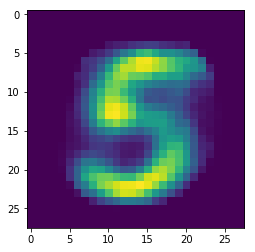

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  1



  0%|          | 1/214 [00:02<09:23,  2.65s/it]

[8 9 7 2 3 5 5 8 8 4 1 5 5 3 3 4 5 5 0 2 6 1 2 8 0 6 7 6 7 3 1 3 8 5 8 0 0
 7 8 4 9 2 3 3 8 5 5 6 5 7 0 4 6 9 6 8 2 0 0 6 5 9 0 4 7 7 0 2 7 2 5 3 3 0
 1 0 6 8 8 8 7 4 5 4 3 0 4 7 4 3 6 4 8 3 7 9 1 4 7 6 3 8 8 4 5 7 1 7 1 2 3
 4 7 2 7 8 0 1 1 6 8 5 7 1 3 9 4 3 0 1 6 3 4 1 6 6 4 7 3 1 6 2 1 1 8 1 1 1
 9 6 6 1 8 1 9 1 8 7 6 8 1 8 8 4 3 4 4 8 9 1 7 6 6 4 3 7 0 7 7 7 9 0 2 7 6
 5 9 7 3 3 0 0 2 0 1 0 8 0 1 8 1 8 8 8 9 1 1 7 7 1 9 5 6 5 9 2 2 2 1 1 2 8
 9 1 6 3 7 8 5 7 8 1 7 6 7 5 5 9 8 9 7 2 5 9 8 6 0 9 9 0 6 7 0 2 1 9]
[8 9 7 2 3 5 5 8 8 4 1 5 5 3 3 4 5 5 0 2 6 1 2 8 0 6 7 6 7 3 1 3 8 5 8 0 0
 7 8 4 9 2 3 3 8 5 5 6 5 7 0 4 6 9 6 8 2 0 0 6 5 4 0 4 7 7 0 2 7 2 5 3 3 0
 1 0 6 8 9 8 7 4 5 4 3 0 4 7 4 3 6 4 8 3 7 9 1 4 7 6 3 8 8 4 3 7 1 7 1 2 3
 4 7 2 7 8 0 1 1 6 8 5 7 1 3 9 4 3 0 1 6 3 4 1 6 6 4 7 3 1 6 2 1 1 8 1 1 1
 9 6 6 1 8 1 9 1 8 7 6 8 1 8 8 4 3 4 4 8 9 1 7 6 6 4 3 7 0 7 7 7 9 0 2 7 6
 5 9 7 3 3 0 0 2 0 1 0 8 0 1 8 1 8 8 8 9 1 1 7 7 1 9 5 6 5 9 2 2 2 1 1 2 8
 9 1 6 3 7 8 5 7 8 1 7 6 7 5 5


  1%|          | 2/214 [00:05<09:14,  2.62s/it]

[6 5 0 1 7 5 3 6 5 5 5 8 3 8 3 7 5 8 6 3 9 6 9 5 5 8 4 8 5 5 4 7 5 3 7 7 0
 7 4 1 5 1 7 7 0 9 7 3 7 6 9 2 3 6 5 7 4 1 1 4 2 8 1 7 7 0 1 3 5 5 0 1 1 5
 1 9 6 4 4 2 2 0 8 9 1 0 1 4 6 1 3 2 8 8 0 3 1 6 9 1 1 2 3 4 2 2 1 8 1 6 7
 6 1 8 6 0 2 7 0 7 8 9 6 3 3 0 7 7 7 4 5 0 8 0 2 8 9 4 0 1 0 1 0 2 1 8 3 4
 3 0 2 1 6 2 4 2 3 9 0 1 5 6 0 7 7 0 2 5 4 0 4 2 9 8 3 8 8 0 7 9 5 1 5 9 9
 1 6 4 6 4 7 0 6 4 6 1 0 5 3 6 9 1 1 8 2 2 9 5 6 8 8 9 8 1 8 4 9 0 8 0 7 5
 8 4 3 2 1 7 5 1 9 2 4 0 9 6 7 1 7 2 6 7 0 1 5 1 3 3 4 0 1 8 6 4 4 8]
[6 5 6 1 7 5 3 6 5 5 5 8 3 8 3 7 5 8 6 3 9 6 9 5 5 8 4 8 5 5 4 7 5 3 7 7 0
 7 4 1 5 1 7 7 0 9 7 3 7 6 9 2 3 6 5 7 4 1 1 4 2 8 1 7 7 0 1 3 5 5 0 1 1 5
 1 9 6 4 4 2 2 0 8 9 1 0 1 9 6 1 3 2 8 8 0 3 1 6 9 1 1 2 3 4 2 2 1 8 1 6 7
 6 1 8 6 0 2 7 0 7 8 9 6 3 3 0 7 7 7 4 5 0 8 0 2 8 9 4 0 1 0 1 0 2 1 8 3 4
 3 0 1 1 6 2 4 2 3 9 0 1 5 6 0 7 7 0 2 5 4 0 4 2 9 8 3 8 8 0 7 9 5 1 5 9 9
 1 6 4 6 4 7 0 6 4 6 1 0 5 3 6 9 1 1 8 2 2 9 5 6 8 8 9 8 1 8 4 9 0 8 0 7 5
 8 4 3 2 1 7 5 1 9 2 4 0 9 6 7


  1%|▏         | 3/214 [00:07<09:11,  2.61s/it]

[7 1 4 7 8 2 6 5 5 4 3 4 0 8 4 2 7 7 4 7 1 9 5 5 3 4 3 9 7 1 1 7 3 2 1 7 4
 2 5 0 4 6 1 5 1 5 5 6 3 8 9 0 6 7 0 6 3 6 3 8 3 9 2 5 5 9 4 2 4 2 8 8 9 3
 8 7 7 1 7 5 9 9 2 4 2 0 4 6 6 3 5 1 7 4 8 5 2 8 5 2 7 6 4 5 6 7 2 9 3 1 4
 2 3 5 0 5 7 0 3 0 5 6 4 7 6 8 5 2 5 0 1 9 9 3 9 5 3 4 4 7 8 9 2 3 7 7 0 1
 8 9 7 6 1 6 0 5 2 8 6 2 7 4 4 5 8 6 0 7 7 9 2 9 4 5 8 3 8 6 4 9 7 8 8 2 8
 1 5 8 1 4 7 2 4 3 5 9 1 1 7 2 5 3 3 3 7 0 8 4 5 0 4 7 4 1 7 7 9 4 9 0 3 6
 7 1 1 9 3 8 0 6 7 8 2 9 3 8 1 8 8 3 1 1 7 9 7 9 1 9 5 6 8 9 7 4 4 7]
[7 1 4 7 8 2 6 5 5 4 3 4 0 8 4 2 7 7 4 7 1 9 5 5 3 4 3 5 7 1 1 7 3 2 1 7 9
 2 5 0 4 6 1 5 1 5 5 6 3 8 9 0 6 7 0 6 3 6 3 8 3 9 2 5 5 9 4 2 4 2 8 8 9 3
 8 7 7 1 7 5 9 9 2 4 2 0 4 6 6 3 5 1 7 4 8 5 2 8 5 2 7 6 4 5 6 7 2 9 3 1 4
 2 3 5 0 5 7 0 3 0 5 6 4 7 6 8 5 2 5 0 1 9 9 3 9 5 3 4 4 7 8 9 2 3 7 7 0 1
 8 9 7 6 1 6 0 5 2 8 6 3 7 4 4 5 8 6 0 7 7 8 2 9 4 5 8 3 8 6 4 9 7 8 8 2 8
 1 5 8 1 4 7 2 4 3 5 9 1 1 7 2 9 3 3 3 7 0 8 4 5 0 4 7 4 1 7 7 9 4 9 0 3 6
 7 1 1 9 3 8 0 6 7 1 2 9 3 8 1


  2%|▏         | 4/214 [00:10<09:12,  2.63s/it]

[9 1 1 4 2 8 0 5 0 7 1 7 4 0 0 5 4 8 1 5 6 1 0 6 2 2 9 5 0 5 4 2 1 7 7 7 0
 8 3 6 8 2 8 6 9 2 1 1 0 2 6 7 3 5 9 1 5 6 6 5 5 7 7 2 1 7 0 0 7 2 7 1 1 1
 9 1 0 6 6 2 1 3 0 0 4 6 5 3 5 8 9 1 9 3 1 4 7 2 7 2 1 0 8 1 2 2 5 0 7 7 9
 6 3 4 4 0 8 4 4 3 5 2 3 0 4 7 8 3 3 8 2 6 4 2 8 4 5 0 0 2 5 0 5 9 5 4 9 8
 3 1 1 6 1 7 2 4 7 8 2 5 4 3 7 6 9 4 0 6 0 5 2 7 1 5 3 9 9 5 7 9 9 7 6 8 6
 0 2 9 7 2 4 1 2 3 9 1 5 6 8 3 5 3 0 1 3 8 2 5 6 6 7 0 1 6 2 1 5 7 3 9 5 8
 9 4 5 0 4 6 4 4 3 1 1 6 8 7 0 6 3 3 2 5 2 6 6 5 0 6 5 4 2 5 1 7 5 1]
[9 1 1 4 2 8 0 5 0 7 1 7 4 0 0 5 4 8 1 5 6 1 0 6 2 2 9 5 0 5 4 2 1 7 7 7 0
 8 3 6 8 2 2 6 9 2 1 1 0 2 6 7 3 5 9 1 5 6 6 5 5 7 7 2 1 7 0 0 7 2 7 1 1 1
 9 1 0 6 6 2 1 3 0 0 4 6 5 3 5 8 9 1 9 3 1 4 7 2 7 2 1 0 8 1 2 2 5 0 7 7 9
 6 3 4 4 0 8 4 4 3 5 2 3 0 4 7 8 3 3 8 2 6 4 2 8 4 5 0 0 2 5 0 5 9 5 4 9 8
 3 1 1 6 1 7 2 4 7 1 2 5 4 3 7 6 9 4 0 6 0 5 2 7 1 5 9 9 9 5 7 9 9 7 6 8 6
 0 2 9 7 2 4 1 2 3 9 1 5 6 8 3 5 3 0 1 3 8 2 5 6 6 7 0 1 6 2 1 5 7 3 9 5 8
 9 4 5 0 4 6 4 4 3 5 1 6 8 7 0


  2%|▏         | 5/214 [00:13<09:07,  2.62s/it]

[5 6 7 7 0 2 8 7 2 2 2 9 3 0 4 7 1 9 3 0 2 0 5 6 1 5 6 8 9 6 5 9 6 1 8 6 4
 4 1 0 1 2 7 7 0 5 0 2 0 6 5 1 1 0 9 5 8 8 6 6 2 2 1 7 2 3 8 1 2 6 8 4 4 0
 1 8 9 2 4 1 3 3 4 2 5 1 2 9 5 8 5 9 7 2 5 2 0 0 8 6 5 9 7 9 5 0 1 9 7 4 8
 3 4 0 3 9 1 1 7 0 3 3 6 9 8 6 7 1 4 8 8 7 9 5 1 5 3 6 6 5 7 3 0 9 0 7 7 8
 7 5 4 8 6 8 2 7 1 5 3 3 9 0 1 5 8 3 5 3 4 6 2 7 9 6 4 3 7 2 4 6 8 0 3 3 6
 3 1 5 7 3 7 0 2 5 9 7 9 3 9 0 8 9 9 0 1 6 1 6 2 6 1 9 0 7 4 2 2 0 4 0 7 4
 8 1 5 9 3 4 2 8 1 0 2 9 5 9 8 7 6 5 4 9 9 0 7 8 8 4 4 8 4 1 2 3 2 2]
[5 6 7 7 0 2 8 7 2 2 2 9 3 0 4 7 1 9 3 0 2 0 5 6 1 5 6 8 9 6 5 9 6 1 8 6 4
 4 1 0 1 2 7 7 0 5 0 2 6 6 5 1 1 0 9 5 8 8 6 6 2 2 1 7 2 3 8 1 2 6 8 4 4 0
 1 8 9 2 4 1 3 3 4 2 5 1 2 9 5 8 5 9 7 2 5 2 0 0 8 6 5 9 7 9 5 0 1 9 7 4 8
 3 4 0 3 9 1 1 7 0 3 3 6 9 8 6 7 1 4 8 8 7 9 5 1 5 3 6 6 5 7 3 0 9 0 7 7 8
 7 5 4 8 6 8 2 7 1 5 3 3 9 0 1 5 8 3 5 3 4 6 2 7 9 6 4 3 7 2 4 6 8 0 3 3 6
 3 1 5 7 3 7 0 2 5 9 7 9 3 9 0 8 9 9 0 1 6 1 6 2 6 1 9 0 3 4 2 1 0 4 0 7 4
 8 1 5 9 3 4 2 8 1 0 2 9 5 9 8


  3%|▎         | 6/214 [00:15<09:06,  2.63s/it]

[5 0 9 5 8 3 3 5 5 0 6 4 9 0 2 1 0 4 6 5 1 3 4 8 4 7 6 3 4 5 3 7 3 9 2 4 8
 6 3 3 9 2 6 3 8 9 7 2 3 4 7 3 0 0 1 7 4 4 4 3 2 6 8 6 7 2 5 9 1 1 2 0 7 9
 0 1 8 0 5 2 0 1 3 9 6 1 0 9 5 6 2 6 5 6 8 2 7 9 6 7 5 9 4 7 5 8 0 3 8 9 9
 1 5 3 6 9 7 2 4 2 4 9 8 8 1 5 2 4 4 7 8 4 9 2 7 1 0 5 3 5 6 0 1 4 5 4 5 1
 3 0 2 0 0 7 7 2 1 2 9 8 4 0 3 6 0 9 6 4 8 3 0 5 9 5 3 0 3 2 6 5 2 2 2 6 7
 5 7 4 1 2 1 9 9 6 1 6 0 6 3 2 6 4 5 1 0 9 9 1 9 6 9 0 0 4 2 6 1 2 8 0 5 3
 3 1 0 5 6 1 6 7 9 1 0 3 4 8 5 3 4 1 2 7 0 9 0 2 3 3 0 4 3 8 0 5 0 6]
[5 0 9 5 8 3 3 5 5 0 6 4 9 0 2 1 0 4 6 5 1 3 4 8 9 7 6 3 4 5 3 7 3 9 2 4 8
 6 3 3 9 2 6 3 8 9 7 2 3 4 7 3 0 0 1 7 4 4 4 3 2 6 8 6 7 2 5 9 1 1 2 0 7 9
 0 1 8 0 9 2 0 1 3 9 6 1 0 9 5 6 2 6 5 6 8 2 7 9 6 7 5 9 4 7 5 8 0 3 8 9 9
 1 5 3 6 9 7 2 4 2 4 9 8 8 1 5 2 4 4 7 8 4 9 2 7 1 0 5 3 5 6 0 1 1 5 4 5 1
 3 0 2 0 0 7 7 2 1 2 9 8 4 0 3 6 0 9 6 4 8 3 0 5 9 5 3 0 3 2 6 5 2 2 2 6 7
 5 7 4 1 2 1 9 9 6 1 6 0 6 3 2 6 4 5 1 0 9 9 1 4 6 9 0 0 4 2 6 1 2 8 0 5 3
 3 1 0 5 6 1 6 7 9 1 0 3 4 8 5


  3%|▎         | 7/214 [00:18<09:03,  2.63s/it]

[5 9 2 4 7 6 8 0 3 8 5 7 6 1 7 9 9 9 6 0 8 7 4 5 5 5 5 1 8 8 2 8 4 8 8 1 2
 0 4 5 1 5 0 7 0 3 3 0 3 9 2 7 1 1 2 2 8 8 4 1 9 0 6 2 7 6 5 5 1 8 9 7 8 3
 2 3 4 3 0 4 5 7 1 7 1 7 0 2 7 1 8 5 8 7 8 7 0 2 0 7 3 4 3 3 0 3 0 0 7 7 4
 3 1 1 7 2 2 0 5 2 7 5 3 2 9 3 5 9 9 2 9 8 3 2 8 7 3 2 6 6 6 9 8 2 8 0 4 2
 1 9 0 7 3 5 0 7 6 9 5 6 9 9 9 1 7 6 8 9 0 2 7 5 0 3 9 9 9 7 3 8 8 4 9 9 0
 1 2 1 9 6 1 1 0 7 4 8 0 7 6 0 7 2 2 0 3 3 1 9 7 2 6 6 2 5 3 8 7 3 0 6 5 0
 1 7 4 9 0 7 5 9 7 6 2 9 3 6 6 1 8 3 2 5 2 7 9 6 3 4 5 0 3 9 5 7 7 7]
[5 9 2 4 7 6 8 0 3 8 5 7 6 1 7 9 9 9 6 0 8 7 4 5 5 5 5 1 8 8 2 8 4 8 8 1 2
 0 4 5 1 5 0 7 0 3 3 0 3 9 2 7 1 1 2 2 8 8 4 1 9 0 6 2 7 6 5 5 1 8 9 7 8 3
 2 3 4 3 0 4 5 7 1 7 1 7 0 2 7 1 8 5 8 7 8 7 0 2 0 7 3 4 3 3 0 3 0 0 7 7 4
 3 1 1 7 2 2 0 5 2 7 5 3 2 9 3 5 9 9 2 9 8 3 2 8 7 3 2 6 6 6 9 8 2 8 0 4 2
 1 9 0 7 3 5 0 9 6 9 5 6 9 9 9 1 7 6 8 9 0 2 7 5 0 3 9 9 9 7 3 8 8 4 9 9 0
 1 2 1 9 6 1 1 0 7 4 8 0 7 6 0 7 2 2 0 3 3 1 9 7 2 6 6 2 5 3 8 7 3 0 6 5 0
 1 7 2 9 0 7 5 9 7 6 2 9 3 6 6


  4%|▎         | 8/214 [00:21<09:01,  2.63s/it]

[9 5 5 4 1 9 2 2 1 2 3 4 4 9 6 8 7 7 1 0 6 3 0 4 9 9 4 0 2 9 7 1 9 1 2 8 3
 5 1 8 1 8 5 3 2 8 6 9 7 5 7 8 3 9 7 5 9 7 9 1 9 0 0 1 0 2 4 2 6 3 5 0 9 1
 4 6 4 7 1 9 9 4 2 9 2 8 9 2 4 3 5 4 0 9 3 2 8 7 0 0 3 1 3 9 2 5 4 8 9 4 1
 1 0 6 6 9 7 8 0 6 8 8 7 6 8 4 9 9 9 8 3 2 9 2 6 7 9 9 7 4 2 3 8 5 4 3 8 3
 9 3 1 9 5 9 8 3 5 9 8 9 8 3 3 4 2 0 5 9 8 1 2 1 9 2 3 0 0 7 5 3 4 5 7 2 7
 1 6 4 2 1 4 9 2 5 5 1 4 0 9 7 6 2 3 6 6 9 9 0 7 4 7 6 1 0 5 8 9 7 6 9 8 9
 5 2 6 7 3 2 2 2 5 1 6 9 9 1 9 3 0 3 5 8 8 0 9 2 7 1 0 4 4 1 2 4 1 9]
[9 5 5 4 1 9 2 2 1 2 3 4 4 9 6 8 7 7 1 0 6 3 0 4 9 9 4 0 2 9 7 1 9 1 1 8 3
 5 1 8 1 8 5 3 3 8 6 9 7 5 7 8 3 9 7 5 9 7 9 1 9 0 0 1 0 2 4 2 6 3 5 0 9 1
 4 6 4 7 9 9 9 4 2 9 2 8 9 2 4 3 5 4 0 9 3 2 8 7 0 0 3 1 3 9 2 5 4 8 9 4 1
 1 0 6 6 9 7 8 0 6 8 8 7 6 8 4 9 9 9 8 3 2 9 2 6 7 9 9 7 4 2 3 8 5 4 3 8 3
 9 3 1 9 5 9 8 3 5 4 8 9 8 3 3 4 2 0 5 9 8 1 2 1 9 2 3 0 0 7 5 3 4 5 7 2 7
 1 6 9 2 1 4 9 2 5 5 1 4 0 9 7 6 2 3 6 6 9 9 0 7 4 7 6 1 0 5 8 9 7 6 9 8 9
 5 2 6 7 3 2 2 2 5 1 6 9 9 1 9


  4%|▍         | 9/214 [00:23<08:59,  2.63s/it]

[1 4 2 2 9 3 6 2 2 5 2 7 5 0 0 6 1 0 2 7 9 6 7 3 3 5 2 2 7 7 6 6 4 1 1 0 2
 9 0 8 4 1 9 8 4 1 8 8 7 7 8 0 0 3 8 2 7 7 6 3 8 3 1 6 8 6 3 9 3 7 8 2 3 8
 1 6 1 5 5 3 9 9 1 7 9 4 2 4 0 0 1 2 2 1 8 8 2 1 6 3 3 3 8 2 2 1 3 6 6 5 7
 3 9 2 6 6 6 8 3 9 2 8 0 1 4 1 0 5 8 2 4 7 0 2 3 1 2 0 3 6 2 1 7 4 7 0 4 3
 5 6 0 9 3 2 1 0 4 7 4 9 8 0 9 7 8 3 4 3 5 9 7 1 6 1 2 7 6 9 2 4 3 7 2 6 0
 8 9 5 9 6 4 3 5 0 0 3 0 8 3 7 7 9 1 7 4 6 9 0 8 2 3 2 7 6 9 8 0 6 8 4 1 4
 3 6 8 3 1 6 5 6 1 2 3 0 2 4 5 0 7 6 1 6 5 1 2 0 8 9 1 0 3 6 5 6 1 1]
[1 4 2 2 9 3 6 2 2 5 2 7 5 0 0 6 1 0 2 7 9 6 7 3 3 5 2 2 7 7 6 6 4 7 1 4 2
 9 0 8 4 1 9 8 4 1 8 8 7 7 8 0 0 3 3 2 7 7 6 3 8 3 1 6 8 6 3 9 3 7 8 2 3 8
 1 6 1 5 5 3 9 9 1 7 9 4 2 4 0 0 1 2 2 1 8 8 2 1 6 3 3 3 8 2 2 1 3 6 6 5 7
 3 9 2 6 6 6 8 3 9 2 8 0 1 4 1 0 5 8 2 4 7 0 2 3 1 2 0 3 6 2 1 7 4 7 0 4 3
 5 6 0 9 3 2 1 0 4 7 4 9 8 0 9 7 8 3 4 3 5 9 7 1 6 1 2 7 6 9 2 4 3 7 2 6 0
 8 9 5 9 6 4 3 5 0 0 3 0 8 3 7 7 9 1 7 4 6 9 0 8 2 3 2 7 6 9 8 0 6 8 6 1 4
 3 6 8 3 1 4 5 6 1 2 3 0 2 4 5


  5%|▍         | 10/214 [00:26<08:55,  2.63s/it]

[1 2 2 0 1 6 2 1 9 6 6 3 5 7 4 8 4 1 4 9 1 4 5 8 9 6 0 2 9 8 1 8 9 9 4 4 9
 9 7 0 7 4 5 7 2 5 5 6 3 9 9 6 0 3 9 7 8 8 5 5 9 5 7 4 0 7 0 4 7 7 9 4 2 5
 6 2 9 4 9 7 9 3 9 6 0 2 7 6 7 5 4 2 1 6 4 5 7 9 9 2 8 8 1 5 6 4 4 5 5 3 1
 6 9 8 8 1 6 3 8 7 8 0 1 1 3 7 6 2 9 9 7 1 8 1 7 4 7 5 6 4 9 9 3 5 4 7 1 7
 1 3 2 1 5 9 6 8 9 3 3 8 5 6 0 4 2 5 5 9 9 3 1 9 4 9 0 9 8 7 9 4 1 6 5 7 9
 6 2 8 9 5 5 8 6 6 6 5 0 7 7 0 1 4 2 9 3 2 8 0 0 6 5 0 8 9 7 4 9 7 1 1 7 1
 2 3 4 7 4 2 2 3 7 5 1 7 0 3 7 2 9 5 5 5 4 7 3 9 5 6 2 7 7 9 5 3 2 2]
[1 2 2 0 1 6 2 1 9 6 6 3 5 7 4 8 4 1 4 9 1 4 5 8 9 6 0 2 9 8 1 8 9 9 4 4 9
 9 7 0 7 4 5 7 2 5 5 6 3 9 9 6 0 3 9 7 8 8 5 5 9 5 7 4 0 7 0 4 7 7 0 4 2 5
 6 2 9 4 9 7 9 3 9 6 0 2 7 6 7 5 4 2 1 6 4 5 7 9 9 2 8 8 1 5 6 4 4 5 5 3 1
 6 9 8 8 1 6 3 8 7 8 0 1 1 3 7 6 2 9 9 7 1 8 1 7 4 7 5 6 4 9 9 3 5 4 7 1 7
 1 3 2 1 5 9 6 8 9 3 3 8 5 6 0 4 2 5 5 9 9 3 1 9 4 9 0 9 8 7 9 4 1 6 5 7 8
 6 2 8 9 5 5 8 6 6 6 5 0 7 7 0 1 4 2 9 3 2 8 0 0 6 5 0 8 9 7 4 9 7 1 1 7 1
 2 3 4 7 4 2 2 3 7 5 1 7 0 3 7


  5%|▌         | 11/214 [00:28<08:53,  2.63s/it]

[2 8 1 0 5 7 0 7 7 2 9 8 2 2 1 3 1 9 7 0 0 2 2 2 7 4 3 8 8 1 2 1 9 6 1 4 3
 4 7 8 8 4 9 1 7 0 3 8 9 4 5 0 7 9 5 9 2 6 4 1 1 2 5 1 2 1 0 4 2 9 0 1 5 1
 8 0 0 8 0 2 7 3 4 1 0 2 5 1 2 5 4 1 7 7 5 7 5 3 6 4 4 8 5 4 3 6 8 3 5 8 2
 0 8 7 8 3 3 0 1 3 7 8 6 9 7 0 2 2 1 6 1 9 2 7 1 3 0 3 6 2 7 4 3 0 5 9 4 1
 1 2 7 6 7 9 4 8 5 2 2 2 3 7 8 3 3 8 9 4 0 3 4 1 8 6 1 3 9 0 6 5 0 7 5 8 8
 4 5 9 0 1 5 8 7 4 7 2 6 4 8 0 4 5 9 4 4 3 4 1 0 1 1 2 1 0 0 0 9 4 6 1 7 0
 4 0 1 7 0 1 1 6 0 9 7 4 0 1 7 8 0 4 0 5 1 8 7 1 8 9 3 7 3 5 4 1 7 0]
[2 8 1 0 5 7 0 7 7 2 9 8 2 2 1 3 1 4 7 0 0 2 2 2 7 4 3 8 8 1 2 1 9 6 1 4 3
 4 7 8 8 4 3 1 7 0 3 8 9 4 5 0 7 9 5 9 2 6 4 1 1 2 5 1 2 1 0 9 2 9 0 1 6 1
 8 0 0 8 0 2 7 3 4 1 0 2 5 1 2 5 4 1 7 7 5 7 5 3 6 4 4 8 5 4 3 6 8 3 5 8 2
 0 8 7 8 3 3 0 1 3 7 8 6 9 7 0 2 2 1 6 1 9 2 7 1 3 0 3 6 2 7 4 3 0 5 9 4 1
 1 2 7 6 7 9 4 8 5 2 2 2 3 7 8 3 3 8 9 4 0 3 4 1 8 6 1 3 9 0 6 5 0 7 5 8 8
 4 5 9 0 1 6 8 7 4 7 2 6 4 8 0 4 5 9 4 4 3 4 1 0 1 1 2 1 0 0 0 9 4 6 1 7 0
 4 0 1 7 0 1 1 6 0 9 7 4 0 1 7


  6%|▌         | 12/214 [00:31<08:50,  2.63s/it]

[7 6 5 7 6 8 6 1 6 1 9 4 4 2 3 6 4 7 0 8 5 3 5 6 7 2 9 3 6 1 3 6 8 7 3 1 3
 6 3 4 9 5 0 3 1 8 9 8 7 1 9 5 3 3 4 2 9 5 2 5 1 6 1 8 7 9 9 1 9 7 0 3 5 1
 1 2 3 9 3 4 8 7 2 5 3 8 1 8 3 4 9 3 8 1 6 7 5 6 5 0 6 3 6 1 9 4 9 4 1 2 9
 8 2 1 9 3 8 6 7 1 2 4 1 3 4 3 1 5 9 1 8 4 4 0 9 5 7 4 0 9 3 6 9 1 8 6 5 9
 5 9 9 0 3 6 0 3 3 4 5 4 3 2 1 8 1 7 7 2 1 6 8 7 2 8 9 9 8 9 3 7 9 3 4 9 5
 7 1 5 0 3 6 6 3 0 1 9 0 1 9 1 5 0 5 7 0 3 7 1 2 5 9 7 9 9 2 2 5 5 0 9 3 6
 5 0 8 0 6 5 0 4 2 5 2 2 4 9 3 2 6 5 5 3 3 5 8 6 2 0 1 1 3 4 8 4 9 2]
[7 6 5 7 6 8 6 1 6 1 9 4 4 2 3 6 4 7 0 8 5 3 5 6 7 2 9 3 6 1 3 6 8 7 3 1 3
 6 3 4 9 5 0 3 1 8 9 8 7 1 9 5 3 3 4 2 9 5 7 5 1 6 1 8 7 9 9 1 9 7 0 3 5 1
 1 2 3 9 3 4 8 7 2 5 3 8 1 8 3 4 9 3 8 1 6 7 5 6 5 0 6 3 6 1 9 4 4 4 1 2 9
 8 2 1 9 3 8 6 7 1 2 4 1 3 4 3 1 5 9 1 8 4 4 0 9 5 7 9 0 9 3 6 9 1 8 6 5 9
 5 9 9 0 3 6 0 3 3 4 5 4 3 3 1 8 1 7 7 2 1 6 8 7 2 8 9 9 8 9 3 7 9 3 4 9 5
 7 1 5 0 3 6 6 3 0 1 9 0 1 9 1 5 0 5 7 0 3 7 1 2 5 9 7 9 9 2 2 5 5 0 9 3 6
 5 0 8 0 6 5 0 4 2 5 2 2 4 9 3


  6%|▌         | 13/214 [00:34<08:49,  2.63s/it]

[1 3 6 2 8 1 4 4 5 0 9 3 5 2 7 6 2 3 3 9 2 2 3 4 5 3 5 9 4 0 0 4 8 3 7 2 3
 1 8 1 2 9 1 0 8 2 2 5 4 5 6 2 9 5 2 4 3 1 8 7 4 3 3 4 2 0 9 5 2 9 8 7 6 9
 2 1 3 1 6 1 4 3 2 8 7 2 8 5 6 1 3 0 2 5 1 7 1 0 8 2 1 8 7 6 7 7 9 9 4 0 2
 6 3 1 1 8 9 0 6 5 2 8 6 6 0 7 7 4 4 8 2 5 3 8 4 1 6 3 4 9 2 0 0 4 0 0 8 9
 4 9 7 6 7 7 9 8 4 7 9 3 5 1 5 1 1 2 0 6 5 1 5 4 4 2 5 2 1 1 8 9 3 1 4 3 9
 0 1 6 8 4 4 1 9 1 1 0 5 1 8 5 6 3 9 4 7 0 4 9 5 2 8 1 4 3 1 9 0 2 0 1 5 9
 7 9 4 6 4 3 9 1 5 2 1 7 0 3 4 1 4 2 4 0 5 1 6 8 3 1 6 9 4 9 6 4 7 1]
[1 3 6 2 8 1 4 4 5 0 9 3 5 2 7 6 2 3 3 9 2 2 3 4 5 3 5 9 4 0 0 4 8 3 7 2 3
 1 8 1 2 9 1 0 8 2 2 5 4 5 6 2 9 5 2 4 3 1 8 7 4 3 3 4 3 0 9 5 2 9 8 7 6 9
 2 1 3 1 6 1 4 3 2 8 7 2 8 5 6 1 3 0 2 5 1 7 1 0 8 2 1 8 7 6 7 7 9 9 4 0 2
 6 3 1 1 8 9 0 6 5 2 8 6 6 0 7 7 4 4 8 2 5 3 8 4 1 6 3 4 9 2 0 0 4 0 0 8 9
 4 9 7 6 7 7 9 8 4 7 9 3 5 1 5 1 8 2 0 6 5 1 5 4 4 2 5 2 1 1 8 9 3 1 4 3 9
 0 1 6 8 4 4 1 9 1 1 0 5 1 8 5 6 3 9 4 7 6 4 4 5 2 8 1 4 3 1 9 0 2 0 1 5 9
 7 9 4 6 4 3 9 1 5 2 1 7 0 3 4


  7%|▋         | 14/214 [00:36<08:46,  2.63s/it]

[3 1 7 9 3 8 9 9 3 0 9 8 6 3 1 3 8 7 9 9 3 3 3 0 6 7 8 8 8 5 3 1 2 7 4 0 6
 0 3 1 5 4 0 2 2 8 2 3 4 1 6 2 6 8 1 0 5 9 0 0 4 3 1 5 4 3 3 9 3 1 7 3 9 7
 7 0 5 6 8 3 6 9 3 6 4 0 0 7 5 6 5 2 3 9 7 5 9 0 4 4 4 1 9 0 2 1 5 9 8 9 8
 1 8 0 4 9 0 7 2 0 6 2 1 5 0 3 0 6 6 9 6 6 1 8 0 4 1 9 5 4 3 2 0 1 9 1 5 4
 4 6 6 6 3 4 0 9 3 3 3 2 7 2 6 7 2 8 8 5 6 2 2 1 9 1 7 0 5 0 5 2 8 8 8 8 8
 6 9 1 9 7 3 4 8 3 2 6 1 7 4 8 6 4 1 4 9 3 1 7 0 2 9 0 0 9 3 3 5 4 7 9 2 9
 3 4 5 1 2 8 8 4 3 4 4 9 5 0 7 0 6 4 4 0 4 8 8 4 3 4 9 2 8 1 0 3 1 8]
[3 1 7 9 3 8 9 9 3 0 9 8 6 3 1 3 8 7 9 9 3 3 3 0 6 7 8 8 8 5 3 1 2 7 4 0 6
 0 3 1 5 4 0 2 2 8 2 3 4 1 6 2 6 8 1 0 5 9 0 0 4 3 1 5 4 3 3 9 3 1 7 3 9 7
 7 0 5 6 8 3 6 9 3 6 4 0 0 7 5 6 5 2 3 9 7 5 9 0 4 4 4 1 9 0 2 1 5 9 8 9 8
 1 8 0 4 9 0 7 2 0 6 2 1 5 0 3 0 6 6 9 6 6 1 8 0 4 1 9 5 4 3 2 0 1 9 1 5 4
 4 6 6 6 3 4 0 9 3 3 3 2 7 2 6 7 2 8 8 5 6 2 2 1 9 1 7 0 5 0 5 2 8 8 8 8 8
 6 9 1 9 7 3 4 8 3 2 6 1 7 4 8 6 4 1 4 9 3 1 7 0 2 9 0 0 9 3 3 5 4 7 9 2 9
 3 4 5 1 2 8 8 4 3 4 4 9 5 0 7


  7%|▋         | 15/214 [00:39<08:43,  2.63s/it]

[2 6 2 4 1 4 7 1 0 5 2 5 4 5 0 5 3 6 2 3 5 8 0 9 1 4 5 0 2 4 3 5 2 7 1 6 6
 3 1 6 6 2 1 6 7 3 4 7 9 9 3 3 7 7 9 5 4 2 7 8 7 1 0 2 3 2 7 0 4 4 8 3 3 4
 4 7 1 4 7 6 3 8 2 4 2 7 3 1 1 0 6 2 9 6 1 7 9 2 9 9 1 9 3 9 3 7 3 1 9 3 4
 5 2 1 4 1 6 7 7 7 8 1 2 7 6 5 9 1 1 0 3 5 9 7 3 8 0 8 0 4 4 8 2 7 3 2 6 0
 0 1 0 8 1 5 2 2 3 4 6 7 3 4 6 1 0 4 5 0 3 7 8 8 3 1 0 5 5 0 9 2 8 2 2 8 5
 3 3 9 6 5 6 0 3 5 1 8 6 7 0 4 0 5 6 6 9 4 4 6 6 7 2 4 8 2 1 5 8 8 2 6 7 0
 0 3 7 1 9 2 5 2 7 6 0 8 5 5 0 5 9 6 3 2 6 1 6 9 3 8 1 2 4 4 0 6 6 4]
[2 6 2 4 1 4 7 1 0 5 2 5 4 5 0 5 3 6 2 3 5 8 0 9 1 4 5 0 2 4 3 5 2 7 1 6 3
 3 1 6 6 2 1 6 7 3 4 7 9 9 3 3 7 7 9 5 4 2 7 8 7 1 0 2 3 2 7 0 4 1 8 3 3 4
 2 7 1 4 7 6 3 8 2 9 2 7 3 1 1 0 6 2 9 6 1 7 9 2 9 9 1 9 3 9 3 7 3 1 9 3 4
 5 2 1 4 1 6 7 7 7 8 1 2 7 6 5 9 1 1 0 3 5 9 7 3 8 0 8 0 4 4 8 2 7 3 2 6 0
 0 1 0 8 1 5 2 2 3 4 8 7 3 4 6 1 0 4 5 0 3 7 8 8 3 1 0 5 5 0 9 2 8 2 1 8 5
 3 5 9 6 5 6 0 3 5 1 8 6 7 0 4 0 5 6 6 9 4 4 6 6 7 2 4 8 2 1 5 8 8 2 6 7 0
 6 3 1 1 9 2 5 2 7 6 0 8 5 9 0


  7%|▋         | 16/214 [00:42<08:40,  2.63s/it]

[5 5 3 2 0 6 0 4 8 8 9 2 7 8 8 2 9 8 8 4 2 4 9 3 6 0 5 0 9 9 1 7 7 9 3 1 9
 6 4 7 7 4 1 7 3 7 5 3 7 6 9 3 9 7 9 0 8 9 2 1 9 4 4 7 0 2 2 7 1 1 4 7 0 6
 9 7 3 0 5 3 0 2 1 8 8 2 7 8 9 5 6 2 5 4 5 1 6 6 0 4 6 5 6 9 4 3 9 2 4 6 1
 0 1 3 8 5 3 3 2 7 7 3 2 1 9 6 7 9 6 1 7 6 6 4 2 0 7 2 8 6 6 2 3 4 1 2 6 7
 7 0 7 4 4 3 4 8 0 1 3 7 1 6 5 5 6 5 0 4 7 2 6 7 0 8 5 9 2 4 2 1 7 9 7 5 0
 1 2 3 9 8 8 1 5 5 3 4 9 5 6 5 1 2 1 9 5 4 7 8 0 4 5 2 6 6 6 1 2 9 7 0 9 3
 3 2 6 9 5 5 7 3 3 4 8 9 2 7 7 0 2 9 7 6 1 5 5 2 4 5 6 3 6 7 0 2 3 3]
[5 5 3 2 0 6 0 4 8 8 9 2 7 8 8 2 9 8 8 4 2 4 9 3 6 0 5 0 9 9 1 7 7 9 7 1 9
 6 4 7 7 8 1 1 3 7 5 3 7 6 9 3 9 3 9 0 8 9 2 1 9 4 4 7 0 2 2 7 1 1 4 7 0 6
 9 7 3 0 5 3 0 2 1 8 8 2 7 8 9 5 6 2 5 4 5 1 6 6 0 4 6 5 6 9 4 3 9 2 4 6 1
 0 1 3 8 5 3 3 2 7 7 3 2 1 9 6 7 9 6 1 7 6 6 4 2 0 7 2 8 6 6 2 3 4 1 2 6 7
 7 0 7 4 4 3 4 8 0 1 3 7 1 6 5 5 6 5 0 4 7 2 6 7 0 8 5 9 2 4 2 1 7 9 7 5 0
 1 2 3 9 8 8 1 5 5 3 4 9 5 6 5 1 2 1 9 5 4 7 8 0 4 5 2 6 6 1 1 2 9 7 0 9 3
 3 2 6 9 5 5 7 3 3 4 8 9 2 7 7


  8%|▊         | 17/214 [00:44<08:37,  2.63s/it]

[8 7 5 0 9 4 6 5 9 5 0 7 0 6 1 6 9 8 2 6 8 1 6 5 1 0 5 2 8 2 3 9 6 8 6 1 5
 2 2 2 0 1 2 4 1 4 5 1 6 4 5 3 1 9 1 4 6 4 7 0 6 5 8 2 2 1 9 9 2 1 6 1 3 6
 1 1 7 9 0 8 0 0 2 1 8 2 9 8 9 8 4 8 9 0 4 4 1 1 0 3 2 4 1 1 3 7 7 4 2 1 6
 0 3 6 1 0 1 7 6 3 2 0 7 1 8 9 9 1 4 1 5 1 8 1 0 5 2 5 5 3 9 4 4 2 5 0 3 6
 7 4 3 6 8 4 8 9 6 8 0 1 1 0 4 9 8 7 6 8 1 6 4 9 8 1 4 7 8 1 1 9 8 0 4 5 5
 6 7 1 8 7 2 2 8 5 9 1 3 0 1 7 3 0 6 0 2 7 7 6 3 0 9 4 2 9 3 0 5 8 9 3 3 0
 5 5 1 1 9 1 5 7 8 2 7 2 7 3 2 5 7 2 1 2 4 9 9 2 5 6 9 2 9 6 3 4 9 6]
[8 7 5 0 9 4 6 5 9 5 0 7 0 6 1 6 8 8 2 6 8 1 6 5 1 0 5 2 8 2 3 9 6 8 6 1 5
 2 2 2 0 1 2 4 1 4 5 1 6 4 5 3 1 9 1 4 6 4 7 0 6 5 8 2 2 1 9 9 2 1 6 1 3 6
 1 1 7 9 0 8 0 0 2 1 8 2 9 8 9 8 4 8 9 0 4 4 1 1 0 3 2 4 1 1 3 7 7 4 2 1 6
 0 3 6 1 0 1 7 6 3 2 0 7 1 8 4 9 1 4 1 5 1 8 1 0 5 2 5 5 3 9 4 4 2 5 0 3 6
 7 4 3 6 8 4 8 9 8 8 0 1 1 0 4 9 8 7 6 8 1 6 4 9 8 1 4 7 8 1 1 9 8 0 4 5 5
 6 7 1 8 7 2 2 8 5 9 1 3 0 1 7 3 0 6 0 2 7 7 6 3 0 9 4 2 9 3 0 5 8 9 3 3 0
 5 5 1 1 9 1 9 7 8 2 7 2 7 3 2


  8%|▊         | 18/214 [00:47<08:34,  2.63s/it]

[6 4 7 4 0 4 2 2 9 6 7 2 6 1 1 3 8 8 6 7 1 2 0 0 4 6 9 6 4 3 1 4 8 9 5 6 2
 9 7 1 5 7 8 1 9 0 7 5 3 9 2 9 7 1 0 0 7 4 2 1 3 7 7 9 6 9 0 2 5 6 4 5 3 0
 3 7 2 0 9 2 7 4 3 1 8 6 9 9 3 3 7 8 0 0 5 9 0 2 1 9 5 9 8 0 8 5 1 2 9 6 4
 3 5 0 5 5 1 9 6 6 4 9 8 6 9 7 2 7 1 9 7 1 6 0 8 0 6 9 5 4 0 2 9 9 9 1 0 4
 6 4 1 8 5 4 6 9 0 0 2 2 6 9 2 4 7 5 9 5 0 2 1 7 7 4 4 6 6 7 2 4 2 9 0 0 4
 3 4 2 7 2 1 0 9 9 2 9 3 9 1 5 3 4 6 6 4 1 8 8 3 2 4 7 6 5 1 9 9 5 3 0 6 9
 0 6 0 1 9 6 2 9 9 2 0 8 4 0 3 6 2 8 9 8 0 5 0 8 2 9 3 4 5 4 7 2 7 1]
[6 4 7 4 0 4 2 2 4 4 7 2 6 1 1 3 8 8 6 7 1 2 0 0 4 6 9 6 4 3 1 4 8 9 5 6 2
 9 7 1 3 7 8 1 9 0 7 5 3 9 2 9 7 1 0 0 7 4 2 1 3 7 7 9 6 9 9 2 5 6 4 5 3 0
 3 7 2 0 9 1 7 4 3 1 8 6 9 9 3 3 7 8 0 0 6 9 0 2 1 9 5 9 8 0 8 5 1 2 9 6 4
 3 5 0 5 5 1 9 6 6 4 9 8 6 9 7 2 7 1 9 7 8 6 0 8 0 6 9 5 4 0 2 9 9 9 1 0 4
 6 4 1 8 5 4 6 9 0 0 2 2 6 9 2 4 7 5 9 5 0 2 1 7 7 4 4 5 6 7 2 4 8 9 0 0 4
 3 4 2 7 2 1 0 9 9 2 9 3 9 1 5 3 4 6 6 4 1 8 8 3 2 4 7 6 5 1 9 9 5 3 0 6 9
 0 6 0 1 9 6 2 9 9 2 0 8 4 0 3


  9%|▉         | 19/214 [00:49<08:31,  2.63s/it]

[7 1 8 9 8 6 5 4 2 6 7 9 0 2 5 2 1 3 6 4 0 2 3 5 3 0 9 9 0 4 1 8 8 9 7 3 2
 5 2 9 9 9 1 8 2 2 0 6 0 0 5 2 1 9 0 8 7 9 5 3 9 7 3 2 3 5 1 9 9 1 3 3 8 6
 2 0 0 4 4 5 3 1 4 7 3 6 4 4 0 3 1 2 0 2 4 4 7 8 7 1 7 9 8 7 7 3 2 9 0 8 4
 9 4 7 1 1 0 0 9 1 3 2 5 6 1 9 7 6 9 4 0 2 0 5 9 7 9 8 5 4 5 3 9 3 6 7 9 7
 9 3 9 3 6 4 9 7 7 1 7 4 7 9 7 5 4 5 8 4 6 6 3 8 5 3 3 1 2 3 3 6 3 7 6 3 8
 2 1 7 6 1 3 2 5 0 8 4 7 7 2 2 7 8 4 1 7 8 2 4 0 6 7 3 5 6 3 9 1 2 2 2 7 8
 2 7 2 4 1 4 1 0 2 9 9 8 4 2 6 4 0 2 5 9 6 4 7 1 5 7 2 0 9 8 0 1 2 7]
[7 1 8 9 8 6 5 4 2 6 7 4 0 2 5 2 1 3 6 4 0 2 3 5 3 0 9 9 0 4 1 8 8 9 7 3 2
 3 2 9 9 9 1 8 2 2 0 6 0 0 5 2 1 9 0 8 7 9 5 3 9 7 3 2 3 5 1 9 9 1 3 3 8 6
 2 0 0 4 4 5 3 1 4 7 3 6 4 4 0 3 1 2 0 2 4 4 7 8 7 1 7 9 8 7 7 3 2 9 0 8 4
 9 4 7 1 1 0 0 9 1 3 2 5 6 1 9 7 6 9 4 0 2 0 5 9 7 9 8 5 4 5 3 9 3 6 7 9 7
 9 3 4 3 6 4 9 7 7 1 7 4 7 9 7 5 4 5 8 8 6 6 3 8 5 3 3 1 2 3 3 6 3 7 6 3 8
 2 1 7 6 1 3 2 5 0 8 4 7 7 2 2 7 8 4 1 7 8 2 4 0 6 7 3 5 6 3 9 1 2 2 2 7 8
 2 4 2 4 1 4 1 0 2 9 9 8 4 2 6


  9%|▉         | 20/214 [00:52<08:29,  2.62s/it]

[5 6 8 6 0 7 4 2 2 4 0 3 9 2 0 0 0 4 4 9 8 3 6 2 0 1 3 4 2 7 9 6 8 4 6 9 9
 2 5 4 6 1 8 6 8 5 6 4 1 4 6 5 0 1 5 2 8 8 4 7 2 2 4 1 7 4 5 9 8 2 6 3 3 7
 2 2 8 6 4 4 2 4 2 6 4 4 8 0 2 1 4 9 9 0 9 5 7 9 2 8 3 8 1 3 0 8 8 9 3 5 4
 4 3 2 7 3 8 1 6 1 3 0 2 6 8 0 3 8 8 5 4 8 8 5 5 0 9 9 1 6 5 9 7 8 7 4 0 2
 5 7 4 3 0 0 8 1 8 0 8 7 9 3 6 8 9 8 3 1 3 2 1 3 3 4 8 7 6 1 1 0 5 6 5 4 5
 2 0 8 6 8 6 0 6 7 7 7 4 0 8 3 9 9 6 2 6 9 5 3 2 1 3 6 6 9 5 9 8 7 1 1 3 8
 3 0 0 0 0 5 3 2 4 5 8 4 1 9 4 3 0 2 1 8 9 2 4 5 2 6 0 6 1 8 6 6 5 1]
[5 6 8 6 0 7 4 2 2 4 0 3 9 2 0 0 0 4 4 9 8 3 6 2 0 1 3 4 2 7 9 6 8 4 6 9 9
 2 5 4 6 1 8 6 8 5 6 4 1 4 6 5 0 1 5 2 8 8 4 7 2 2 4 1 7 4 5 9 8 2 6 3 3 7
 2 2 8 6 4 4 2 4 2 6 4 4 8 0 2 1 4 9 9 0 9 5 7 9 2 8 3 8 1 3 0 8 8 9 3 5 4
 4 3 2 7 3 8 1 6 1 3 0 2 6 8 0 3 8 8 5 4 8 8 5 5 0 9 9 1 6 5 4 7 8 7 4 0 2
 5 7 4 3 0 0 8 1 8 0 8 7 9 3 6 8 9 8 3 1 3 2 1 3 3 4 8 7 6 1 1 0 5 6 5 4 5
 2 0 8 6 8 6 0 6 7 7 7 4 0 8 3 9 9 6 2 6 9 5 3 2 1 3 6 6 9 5 9 8 7 1 1 3 8
 3 0 0 0 0 5 3 2 4 5 8 4 1 9 4


 10%|▉         | 21/214 [00:55<08:26,  2.62s/it]

[8 6 4 9 1 1 5 0 4 2 3 5 7 1 5 8 1 5 5 4 8 3 4 6 7 0 0 4 0 7 0 4 9 9 8 9 0
 3 3 6 2 2 0 1 1 1 3 7 1 0 9 6 2 7 5 1 0 5 9 8 6 3 8 1 2 5 7 3 8 3 8 5 9 9
 3 9 3 7 8 8 8 8 4 4 4 1 8 9 6 7 2 4 8 7 7 0 9 5 1 3 4 0 6 4 5 5 3 0 5 3 4
 6 5 8 8 9 8 2 6 6 2 0 9 0 0 0 7 0 1 1 8 8 5 0 8 1 8 2 0 1 8 3 6 2 4 7 1 0
 8 0 4 1 6 2 2 6 1 5 2 9 6 0 7 1 4 4 6 4 8 1 8 8 9 2 5 7 7 3 0 8 8 7 7 7 8
 4 6 3 6 3 4 8 4 7 4 6 5 9 4 7 3 9 6 6 9 4 0 7 1 8 4 3 0 2 5 7 4 1 8 4 8 0
 8 9 6 2 7 2 3 9 4 0 3 1 3 3 2 4 3 3 1 6 5 2 9 9 1 7 7 0 0 2 4 2 4 4]
[8 6 4 9 1 1 5 0 4 2 3 5 7 1 5 8 1 5 5 4 8 3 4 6 7 0 0 4 0 7 0 4 9 9 8 9 0
 3 3 6 2 2 0 1 1 1 3 7 1 0 9 6 2 7 5 1 0 5 9 8 6 3 8 1 2 5 7 3 8 3 8 5 9 9
 3 9 3 7 8 8 8 8 4 4 4 1 7 9 6 7 2 4 8 7 7 0 9 5 1 3 4 0 6 4 5 5 3 0 5 3 4
 6 5 8 8 9 8 2 6 6 2 0 9 0 0 0 7 0 1 1 8 8 5 0 8 1 8 2 0 1 8 3 6 2 4 7 1 0
 8 0 4 1 6 2 2 6 1 5 2 9 6 0 7 1 4 4 6 4 8 1 8 8 9 2 5 7 7 3 0 8 8 7 7 7 8
 4 6 3 6 3 4 8 4 7 4 6 5 9 4 7 3 9 6 6 9 4 0 7 1 8 4 3 0 2 5 7 4 1 8 4 8 0
 8 9 6 2 7 2 3 9 4 0 3 1 3 3 2


 10%|█         | 22/214 [00:57<08:23,  2.62s/it]

[1 0 3 7 3 4 8 9 8 9 0 4 5 5 6 2 2 9 2 6 9 2 5 3 9 6 2 3 7 2 1 3 1 3 2 8 2
 8 6 3 8 6 4 1 6 8 3 6 3 1 5 2 6 5 5 9 9 3 6 5 1 2 0 1 1 7 2 9 0 9 9 9 3 3
 7 6 1 9 0 1 8 7 2 4 9 6 3 8 1 3 6 0 5 1 1 4 2 3 7 2 2 5 9 3 1 8 0 9 2 2 2
 0 3 8 7 3 6 2 1 6 1 0 2 9 5 7 1 1 5 2 7 7 8 7 9 0 4 0 1 7 5 2 8 4 8 9 6 6
 3 5 1 8 3 7 0 0 1 0 7 0 2 7 1 2 9 3 3 8 0 8 5 7 1 2 6 3 7 2 4 9 7 2 8 2 2
 0 6 7 5 1 0 5 0 6 0 2 2 9 4 1 3 0 7 8 8 7 3 3 1 9 1 4 4 7 1 0 0 6 1 8 0 9
 4 2 3 4 9 6 6 2 6 4 9 1 0 1 5 1 0 3 6 7 1 9 5 9 4 6 6 5 1 3 2 3 6 7]
[1 0 3 7 3 4 8 9 8 9 0 4 5 5 6 2 2 9 2 6 9 2 5 3 9 6 2 3 7 2 1 3 2 3 2 8 2
 8 6 3 8 6 4 1 6 8 3 6 3 1 5 2 6 5 5 9 9 3 6 5 1 2 0 1 1 2 2 9 0 9 9 9 3 3
 7 6 1 9 0 1 8 7 2 4 9 6 3 8 1 3 6 0 5 1 1 4 2 3 7 2 2 5 9 3 1 8 0 9 2 2 2
 0 3 8 7 3 6 2 1 6 1 0 2 9 5 7 1 1 5 2 7 7 8 7 9 0 4 0 8 7 5 2 8 4 8 9 6 6
 3 5 1 8 3 7 0 0 1 2 7 0 2 7 1 2 9 3 3 8 0 8 5 7 1 2 6 3 7 2 4 9 7 2 8 2 3
 0 6 7 5 1 0 5 0 6 0 2 2 9 4 1 3 0 7 8 8 7 3 3 1 9 1 4 4 7 1 0 0 6 1 8 0 9
 4 2 3 4 9 6 6 2 6 4 9 1 0 1 5


 11%|█         | 23/214 [01:00<08:20,  2.62s/it]

[4 1 6 6 6 0 5 6 2 1 1 2 5 1 4 6 3 3 0 8 1 4 0 4 7 3 9 1 4 6 8 4 3 6 0 1 0
 1 6 2 8 5 8 2 3 6 9 7 9 4 4 3 2 2 8 9 9 5 4 8 0 2 8 6 1 6 8 1 5 6 2 3 1 0
 1 8 3 3 1 0 7 0 2 2 0 1 0 1 3 9 3 8 9 9 9 3 9 8 3 7 1 6 4 3 3 1 7 6 6 3 5
 5 9 0 8 3 4 8 8 2 4 7 5 4 7 8 8 1 9 2 2 0 5 1 3 9 4 1 8 1 1 9 6 8 4 3 3 5
 9 0 1 3 8 8 5 3 8 3 8 5 7 3 2 1 5 6 5 8 3 4 7 0 5 3 2 3 2 6 2 6 8 4 5 0 2
 7 7 3 1 0 9 0 5 8 9 2 8 3 0 9 9 3 9 3 2 0 7 6 8 1 2 5 2 6 5 0 5 0 8 4 7 2
 9 8 3 0 4 0 2 2 7 9 9 6 2 7 0 1 7 7 4 6 6 1 8 0 2 0 9 6 1 1 8 7 8 9]
[4 1 6 6 6 0 5 6 2 1 1 2 9 1 4 6 3 3 0 8 1 4 0 4 7 3 9 1 4 6 8 4 2 6 0 1 0
 1 5 2 8 5 8 2 3 6 9 7 9 4 4 3 2 2 8 9 9 5 4 8 0 2 8 6 1 6 8 1 5 6 2 3 1 0
 1 8 3 3 1 0 7 0 2 2 0 1 0 1 3 9 3 8 9 9 9 3 9 8 3 7 1 6 4 3 3 1 7 6 6 3 5
 5 9 0 8 3 4 8 8 2 4 7 5 4 7 8 8 1 9 2 2 0 5 1 3 9 4 1 8 1 1 9 6 8 4 3 3 5
 9 0 1 3 3 8 5 3 8 3 8 5 7 3 2 1 5 6 5 8 3 4 7 0 5 3 2 3 2 6 2 6 8 4 5 0 2
 7 7 3 1 0 9 0 5 8 9 2 8 3 0 9 9 3 9 3 2 0 7 6 8 1 2 5 2 6 5 0 5 0 8 4 7 2
 9 8 3 0 4 0 2 2 7 9 9 6 2 7 0


 11%|█         | 24/214 [01:02<08:18,  2.62s/it]

[4 8 7 0 8 3 5 9 8 7 2 0 0 0 2 8 1 4 7 6 6 6 9 4 0 1 8 5 6 8 2 0 1 4 0 4 7
 9 9 8 2 3 0 8 1 5 5 3 7 6 8 9 1 8 0 2 8 5 9 6 9 9 2 2 4 0 6 1 4 1 0 5 8 0
 1 9 1 7 4 0 7 8 2 9 6 9 0 1 7 0 0 2 2 9 9 3 2 3 2 7 1 7 3 5 3 9 9 3 2 2 7
 8 4 5 4 1 6 4 7 8 2 8 2 0 8 6 8 7 3 6 7 2 9 0 7 5 4 2 1 0 5 4 2 4 1 8 7 8
 7 8 6 7 5 1 6 0 5 7 0 0 5 5 0 8 3 6 2 5 7 0 5 2 4 2 0 6 0 7 1 1 1 7 4 3 4
 9 8 6 4 1 2 1 4 6 4 6 4 6 0 4 1 7 6 7 5 6 1 5 6 4 2 1 8 4 1 3 1 0 5 3 7 7
 4 8 8 4 5 0 9 6 4 8 1 4 1 1 7 5 3 9 9 6 8 2 8 2 1 2 7 4 2 1 4 6 3 6]
[4 8 7 0 8 3 5 9 8 7 2 0 0 0 3 8 1 4 7 6 6 6 9 4 0 1 8 5 6 8 2 0 1 4 0 4 7
 9 9 8 2 3 0 8 1 5 5 3 7 6 8 9 1 8 0 2 8 5 9 6 9 9 2 2 4 0 6 1 4 1 0 5 8 0
 1 9 1 7 4 0 7 8 2 9 6 9 0 1 7 0 0 2 2 9 9 3 2 3 2 7 1 7 3 5 3 9 9 3 2 2 7
 8 4 5 4 1 6 4 7 8 2 8 2 0 8 6 8 7 3 6 7 2 9 0 7 5 4 2 1 0 5 8 2 4 1 8 7 8
 7 8 6 7 5 1 6 0 5 7 0 0 5 5 0 8 3 6 2 5 7 0 5 2 4 2 0 6 0 7 1 1 1 7 4 3 4
 9 8 6 4 1 2 1 4 6 4 6 4 6 0 4 1 7 6 7 5 6 1 5 6 4 2 1 8 4 1 3 1 0 5 3 3 7
 4 8 8 4 5 0 9 6 4 8 1 4 1 1 7


 12%|█▏        | 25/214 [01:05<08:15,  2.62s/it]

[9 7 4 9 5 0 5 6 4 1 5 4 9 5 1 4 8 7 2 8 6 2 1 4 9 9 6 6 6 6 6 8 9 6 4 7 0
 5 6 8 8 1 8 2 2 3 5 6 5 7 5 1 8 0 3 0 9 3 7 6 2 2 6 4 9 3 7 7 5 6 8 3 5 4
 7 3 9 0 3 8 1 6 0 2 6 3 1 6 2 7 2 9 8 4 5 6 0 8 5 1 6 0 3 1 3 1 6 5 4 8 2
 7 5 0 2 6 1 7 8 6 9 9 2 5 6 8 5 8 3 2 0 2 9 4 3 5 5 7 3 7 7 5 8 8 7 8 8 1
 6 2 8 1 8 3 3 8 4 4 1 7 8 5 1 2 6 8 9 7 9 1 2 8 9 3 4 8 8 1 6 2 7 0 9 5 7
 5 6 3 0 5 1 1 8 9 9 8 2 2 0 8 9 0 9 6 5 9 4 1 7 5 3 3 9 4 4 3 3 9 6 9 6 3
 6 7 0 2 1 5 2 7 5 1 9 6 3 4 3 1 1 4 5 9 8 6 0 6 3 6 5 9 6 1 1 6 5 5]
[9 7 4 9 5 0 5 6 4 1 5 4 9 5 1 4 8 7 2 8 6 2 1 4 9 9 6 6 6 6 6 8 9 6 4 7 0
 5 6 8 8 1 8 2 2 3 5 6 5 7 5 1 8 0 3 0 9 3 7 6 2 2 6 4 9 3 7 7 5 6 8 3 5 4
 7 3 9 0 3 8 1 6 0 2 6 3 1 6 2 7 2 9 8 4 5 6 0 8 5 1 6 0 3 1 3 1 6 5 4 8 2
 7 5 0 2 6 1 7 8 6 9 9 2 5 6 8 5 8 3 2 0 2 9 4 3 5 5 7 3 7 7 5 8 8 7 8 8 1
 6 2 8 1 8 3 3 8 4 4 1 7 8 5 1 2 6 8 9 7 9 1 2 8 9 3 4 8 8 1 6 2 7 0 9 5 7
 5 6 3 0 5 1 1 8 9 9 8 2 2 0 8 9 0 9 6 5 9 4 1 7 5 3 3 9 4 4 3 3 9 6 9 6 3
 6 7 5 2 1 5 2 2 5 1 9 6 3 4 3


 12%|█▏        | 26/214 [01:08<08:12,  2.62s/it]

[9 0 7 2 0 9 1 7 4 3 9 7 5 3 4 6 8 4 0 7 0 7 3 4 3 9 8 1 3 5 7 1 9 7 6 8 3
 2 4 5 2 6 0 7 9 0 2 4 3 7 5 0 6 9 7 7 6 9 7 8 2 3 1 5 6 8 5 7 3 2 1 4 6 4
 9 2 4 7 6 8 3 1 1 3 1 6 3 2 9 9 1 9 1 5 4 3 5 7 1 9 9 2 6 2 8 9 9 6 3 0 8
 7 8 4 3 4 6 4 6 4 7 4 5 8 0 8 9 1 0 1 8 7 0 4 1 0 4 3 6 7 5 4 9 6 6 6 5 2
 7 2 6 8 0 0 0 5 5 4 0 2 7 5 4 0 4 5 1 9 4 0 9 8 5 1 4 4 1 0 0 0 1 7 9 0 2
 1 4 2 8 0 9 1 3 4 2 2 2 3 6 5 9 7 0 1 9 8 6 8 5 2 9 0 3 2 5 5 9 7 5 4 1 3
 3 5 6 8 3 6 6 3 6 6 7 5 6 1 8 5 4 2 5 5 4 8 8 1 9 4 8 1 5 7 3 7 6 2]
[9 0 7 2 0 9 1 7 4 3 9 7 5 3 4 6 8 4 0 7 0 7 3 4 3 9 8 1 3 5 7 1 9 7 6 8 3
 2 4 5 2 6 0 7 9 0 2 4 3 7 5 0 6 9 7 7 6 9 7 8 2 3 1 5 6 8 5 7 3 2 1 4 6 4
 9 2 4 7 6 8 3 1 1 3 1 6 3 2 9 9 1 9 1 5 4 3 5 7 1 9 9 2 6 2 8 9 9 6 3 0 8
 7 8 4 3 4 6 4 6 4 7 4 5 8 0 8 9 1 0 1 8 7 0 4 1 0 4 3 6 7 5 4 9 6 6 6 5 2
 7 2 6 8 0 0 0 5 5 4 0 2 7 5 4 0 4 5 1 9 4 0 9 8 5 1 4 4 1 0 0 0 1 7 9 0 2
 1 4 2 8 0 9 1 3 4 7 2 3 3 6 5 9 7 0 1 9 8 6 8 5 2 9 0 3 2 5 5 9 7 5 4 1 3
 3 5 6 8 3 6 6 3 6 6 7 5 6 1 8


 13%|█▎        | 27/214 [01:10<08:10,  2.62s/it]

[2 8 2 7 6 9 3 8 8 6 1 2 1 2 5 1 1 9 2 0 8 7 4 7 6 1 5 5 8 4 3 5 1 8 5 6 1
 2 5 0 7 4 6 8 8 8 6 6 1 6 0 2 2 4 7 3 8 8 2 1 1 2 9 8 1 7 7 3 6 0 6 8 1 2
 6 8 8 1 9 4 2 1 0 0 1 6 3 2 3 0 4 4 4 0 9 8 4 9 8 7 7 6 9 2 5 9 9 8 2 7 6
 9 0 3 5 6 6 4 5 9 9 9 4 3 2 1 7 0 6 4 0 8 8 9 2 5 1 7 1 0 7 5 1 6 0 4 8 4
 8 4 4 8 1 1 2 0 1 1 2 7 0 2 2 2 7 7 4 6 7 3 7 9 6 2 4 9 1 5 1 7 6 7 0 5 4
 1 1 0 0 1 3 0 5 1 3 1 1 9 1 7 1 7 7 4 1 7 7 7 3 2 7 5 9 6 1 8 6 8 3 2 7 5
 5 4 8 0 2 3 9 3 2 0 2 2 5 7 0 1 2 6 6 5 6 3 0 1 0 7 8 3 6 2 1 2 6 7]
[2 8 2 3 6 9 3 8 8 6 1 2 1 2 5 1 1 9 2 0 8 7 4 7 6 1 5 5 8 4 3 5 1 8 5 6 1
 2 5 0 7 4 6 8 8 8 6 6 1 6 0 2 2 4 7 3 8 8 2 1 1 2 9 8 1 7 7 3 6 0 6 8 1 2
 6 8 8 1 9 4 2 1 0 0 1 6 3 2 3 0 4 4 4 0 9 8 4 9 8 7 7 6 9 1 5 9 9 8 2 7 6
 9 0 3 5 6 6 4 5 9 9 9 4 3 2 2 7 0 6 4 0 8 1 9 2 5 1 7 1 0 7 5 1 6 0 4 8 4
 8 4 4 8 1 1 2 0 1 1 2 7 0 2 2 2 7 7 4 6 7 3 7 9 6 2 4 9 1 5 1 7 6 7 0 5 4
 1 1 0 0 1 3 0 5 1 3 1 1 9 1 7 1 7 7 4 1 7 7 7 3 2 7 5 9 6 1 8 6 8 3 2 7 5
 5 4 8 0 2 3 9 3 2 0 2 2 5 7 0


 13%|█▎        | 28/214 [01:13<08:08,  2.62s/it]

[1 4 5 3 7 4 5 1 5 9 8 1 2 6 3 0 0 6 5 2 4 2 1 8 0 4 1 3 8 7 7 3 1 5 0 2 4
 5 2 4 2 3 3 4 3 4 7 3 7 4 6 9 8 3 3 4 0 1 9 7 7 9 3 9 4 8 6 0 2 2 4 1 1 7
 5 7 4 8 8 0 9 0 0 3 2 9 5 5 2 0 5 6 9 1 0 1 4 4 2 3 7 9 3 9 2 5 5 1 8 2 8
 1 4 1 4 7 0 1 1 3 6 5 0 4 2 7 1 5 3 4 8 8 4 2 7 1 2 5 7 3 7 6 3 0 3 8 5 2
 9 7 6 7 9 7 9 3 4 0 7 4 4 5 9 7 6 5 0 5 8 6 0 4 5 1 0 1 3 8 9 6 4 4 1 5 6
 3 6 6 2 2 3 6 3 1 1 8 3 9 0 4 2 4 1 0 0 9 0 4 7 7 6 8 6 8 5 6 9 2 8 1 9 5
 2 0 1 6 1 4 3 5 4 0 5 9 8 4 5 7 8 9 6 0 1 7 9 1 0 8 4 1 7 0 7 6 9 6]
[1 4 5 3 7 4 5 1 5 9 8 1 2 6 3 0 0 8 5 2 4 2 1 8 0 2 1 3 8 7 7 3 1 5 0 2 4
 5 2 4 2 3 3 4 3 4 7 3 7 4 6 9 8 3 3 4 0 1 9 7 7 9 3 9 4 8 6 0 2 2 4 1 1 7
 5 7 4 8 8 0 9 0 0 3 2 9 5 5 2 0 5 6 9 1 0 1 4 4 2 3 7 9 3 9 2 5 5 1 8 2 8
 1 4 1 4 7 0 1 1 3 6 5 0 4 2 7 1 5 3 4 8 8 4 2 7 1 2 5 9 3 7 6 3 0 3 8 5 2
 9 7 6 7 9 7 9 3 4 0 7 4 4 5 9 7 6 5 0 5 8 6 0 4 5 1 0 1 3 8 9 6 4 4 1 5 6
 3 6 6 2 2 3 6 3 1 1 8 3 9 0 4 2 4 1 0 0 9 0 4 7 7 6 8 6 8 5 6 9 2 8 1 9 5
 2 0 1 6 1 4 3 5 4 9 5 9 8 4 5


 14%|█▎        | 29/214 [01:16<08:05,  2.63s/it]

[7 3 2 0 4 6 4 4 0 5 1 4 1 1 5 3 0 3 3 9 6 7 7 7 2 7 4 1 2 4 0 3 2 2 3 9 5
 6 2 5 9 6 7 1 2 3 2 9 8 2 6 7 2 7 6 7 1 0 4 4 5 0 8 8 9 0 9 0 1 3 0 2 3 3
 2 3 4 7 8 9 8 1 5 7 2 8 1 4 5 1 4 0 7 0 6 0 8 8 8 5 0 9 5 8 6 6 6 7 4 7 9
 0 9 5 9 7 5 2 7 8 5 2 0 4 1 0 2 0 5 2 7 8 2 7 8 0 5 2 0 5 5 1 2 4 5 1 7 2
 7 7 1 6 6 2 6 3 4 8 5 1 0 5 0 2 0 5 9 1 8 1 0 2 9 5 5 6 5 0 6 3 4 2 5 4 1
 7 3 4 6 7 6 6 0 1 4 1 6 5 4 6 6 9 1 9 5 5 3 1 0 0 8 8 1 4 2 3 6 9 5 7 6 2
 1 3 5 6 2 1 3 8 6 2 6 4 7 2 6 8 6 3 5 0 3 9 2 0 1 5 5 1 4 2 1 3 2 0]
[7 3 2 0 4 6 4 4 0 5 1 4 1 1 5 3 0 3 3 9 6 7 7 7 2 7 4 1 2 4 0 3 2 2 3 9 5
 6 2 5 9 6 7 1 2 3 2 9 8 2 6 7 2 7 6 7 1 0 4 4 5 0 8 8 9 0 9 0 1 3 0 2 3 3
 2 3 4 7 8 9 8 1 5 7 2 8 1 4 5 8 4 0 7 0 6 9 8 8 8 5 0 9 5 8 6 6 6 7 4 7 9
 0 9 5 9 7 5 2 7 8 5 2 0 4 1 0 2 0 5 2 7 8 2 7 8 0 5 2 0 5 5 1 2 4 5 1 7 2
 7 7 1 6 6 2 6 3 4 8 5 1 0 5 0 2 0 5 9 1 8 1 0 2 9 5 5 6 5 0 6 3 4 2 5 4 1
 7 3 4 6 7 6 6 0 1 4 1 5 5 4 6 6 9 1 9 5 5 3 1 0 0 8 8 1 4 2 3 6 9 5 7 6 2
 1 3 5 6 2 1 3 8 6 2 6 4 7 2 6


 14%|█▍        | 30/214 [01:18<08:02,  2.62s/it]

[7 9 5 7 9 6 6 8 9 7 0 0 6 7 8 5 8 4 9 8 6 2 8 3 2 3 0 0 1 1 2 4 6 3 6 1 1
 8 5 1 9 0 3 5 7 3 5 8 6 6 8 7 6 9 1 3 8 7 7 8 6 5 6 1 3 5 0 9 3 0 4 1 6 9
 6 6 5 9 9 3 2 1 6 2 9 8 6 2 1 3 9 0 3 6 4 1 8 2 8 5 8 6 3 5 5 1 6 0 0 3 4
 2 1 2 5 9 7 2 6 6 9 7 7 6 3 8 1 4 2 5 5 4 2 1 8 9 2 5 8 1 2 1 2 1 1 5 7 1
 2 0 9 9 0 2 1 4 8 4 4 9 5 7 1 9 4 6 4 0 3 4 5 2 4 3 4 6 0 3 3 7 0 5 1 6 4
 0 0 4 5 7 2 7 6 1 7 2 5 6 0 3 1 7 1 5 0 6 6 0 3 3 2 8 1 6 4 9 5 8 7 6 0 7
 2 4 7 1 1 3 2 9 3 3 1 4 7 1 7 8 2 4 6 5 0 1 1 7 1 6 4 7 0 7 7 8 3 3]
[7 9 5 7 9 6 6 8 9 7 0 0 6 7 8 5 8 4 4 8 6 2 8 3 2 3 0 0 1 1 2 4 6 3 6 1 1
 8 5 1 9 0 3 5 7 3 5 8 6 6 8 7 6 9 1 3 8 7 7 8 6 5 6 1 3 5 0 9 3 0 4 1 6 9
 6 6 5 9 9 3 2 1 6 2 9 8 6 2 1 3 9 0 3 6 4 1 8 2 8 5 8 6 3 5 5 1 6 0 0 3 4
 2 1 2 5 9 7 2 6 6 9 7 7 6 3 8 1 4 2 5 5 4 2 1 8 9 2 5 8 1 2 1 2 1 1 5 7 1
 2 0 9 9 0 2 1 4 8 4 4 9 5 7 1 9 4 6 4 0 3 4 5 2 4 3 4 6 0 3 3 7 0 5 1 6 4
 0 0 4 5 7 1 7 6 1 7 2 5 6 0 3 1 7 1 5 0 6 6 0 3 3 2 8 1 6 4 9 5 8 7 6 0 7
 2 4 7 1 1 3 2 9 3 3 1 4 7 1 7


 14%|█▍        | 31/214 [01:21<08:00,  2.63s/it]

[2 6 6 4 8 7 6 1 0 7 9 8 1 9 8 6 8 7 5 5 2 0 1 8 2 6 8 7 8 8 2 9 5 1 8 1 9
 7 7 6 7 4 5 8 1 1 2 9 5 7 4 2 2 7 5 4 6 4 9 9 5 0 2 9 1 8 7 5 8 4 8 5 0 9
 1 6 2 4 4 6 3 9 9 2 5 3 6 8 7 9 3 5 8 8 9 1 3 9 7 8 1 2 5 7 5 2 2 2 5 0 1
 0 6 2 9 5 7 4 6 7 5 1 3 0 0 3 1 3 8 5 8 3 7 3 3 5 1 1 3 3 1 1 7 2 9 3 4 0
 2 9 4 4 7 3 1 6 8 5 4 9 8 7 9 3 0 0 7 8 9 0 2 7 9 5 4 5 0 7 1 2 7 5 7 4 8
 7 9 1 2 9 8 1 0 6 5 4 7 1 1 4 7 4 7 1 4 4 0 6 6 2 9 9 1 2 1 9 6 5 5 1 8 6
 1 8 6 8 0 4 3 0 3 2 4 8 3 3 7 6 0 1 8 9 8 9 8 7 0 6 8 1 8 7 8 2 0 3]
[2 6 6 4 8 7 6 1 0 7 9 8 1 4 8 6 8 7 5 5 2 0 1 8 2 6 8 7 8 8 2 9 5 1 8 1 9
 7 7 6 7 4 5 8 1 1 2 9 5 7 4 2 2 7 5 4 6 4 9 9 5 0 2 9 1 8 7 5 8 4 8 5 0 9
 1 6 2 4 4 6 3 9 9 2 5 3 6 8 7 9 3 5 8 8 9 1 3 9 7 8 1 2 5 7 5 2 2 2 5 0 1
 0 6 2 9 6 7 4 6 7 5 1 3 0 0 3 1 3 8 5 8 3 7 3 3 5 1 1 3 3 1 1 7 2 9 3 4 0
 2 9 4 4 7 3 1 6 8 5 4 9 8 7 9 3 0 0 7 8 9 0 2 7 9 5 4 5 0 7 1 2 7 9 7 4 8
 7 9 1 2 9 8 1 0 6 5 4 7 1 1 4 7 4 7 1 4 4 0 6 6 2 9 4 1 2 1 9 6 5 5 1 8 6
 1 8 6 8 0 4 3 0 3 2 4 8 3 3 7


 15%|█▍        | 32/214 [01:24<07:58,  2.63s/it]

[7 8 1 5 6 6 8 9 3 8 5 2 1 7 1 1 8 4 1 8 4 2 9 1 5 0 9 0 6 7 7 7 4 4 3 7 9
 8 9 4 2 5 5 5 8 1 7 6 5 1 5 8 5 9 1 9 9 3 4 1 8 2 9 9 1 2 1 9 5 6 2 3 7 2
 5 2 5 5 4 9 8 9 9 5 2 7 5 8 8 3 2 9 3 5 8 3 1 1 5 5 9 3 8 6 0 2 5 8 0 0 5
 1 5 7 1 7 5 3 9 8 5 2 2 1 2 9 4 5 4 4 4 6 6 8 9 6 7 2 1 4 0 8 3 2 1 7 8 3
 2 9 1 0 1 6 7 2 1 3 0 1 3 9 7 9 2 5 0 3 7 2 3 2 0 0 9 8 0 8 4 8 4 8 3 4 2
 0 5 2 2 7 2 2 3 9 3 6 4 4 6 5 1 8 3 9 1 4 1 8 3 9 0 0 6 6 5 7 6 0 5 0 6 8
 3 5 8 7 0 4 2 2 6 8 3 9 1 4 4 5 7 4 4 2 3 3 8 8 8 0 3 6 7 5 3 7 5 9]
[7 8 1 5 6 6 8 9 3 8 5 2 1 7 1 1 8 4 1 8 4 2 9 1 5 0 9 0 6 7 7 7 4 4 3 7 9
 8 9 4 2 5 5 5 8 1 7 6 5 1 5 8 5 9 1 9 9 3 4 1 8 2 9 9 1 2 1 9 5 6 2 3 7 2
 5 2 5 5 4 9 8 9 9 5 2 7 5 8 8 3 2 9 3 5 8 3 1 1 5 5 9 3 8 6 0 2 5 8 0 0 5
 1 5 7 1 3 5 3 9 8 5 2 2 1 2 9 4 5 4 4 4 6 6 8 9 6 7 2 1 4 0 8 3 2 1 7 8 3
 2 9 1 0 1 6 7 2 1 3 0 1 3 9 7 9 2 5 0 3 7 2 3 2 0 0 9 8 0 8 4 3 4 8 3 4 2
 0 5 2 2 7 2 2 3 9 3 6 4 4 6 5 1 8 3 9 1 4 1 8 3 9 0 0 6 6 5 7 6 0 5 0 6 8
 3 5 8 7 0 4 2 2 6 8 3 9 1 4 4


 15%|█▌        | 33/214 [01:26<07:56,  2.63s/it]

[8 5 8 3 4 6 1 3 3 6 4 8 3 9 9 8 6 7 6 3 6 1 8 3 9 3 8 4 4 6 6 8 7 4 0 5 2
 2 6 1 7 2 8 1 7 0 3 5 3 7 9 9 6 8 7 6 0 4 3 4 9 7 1 7 0 1 2 8 2 7 1 7 1 0
 2 4 7 1 5 2 8 6 9 7 0 4 1 7 5 5 4 8 2 1 2 3 0 3 9 9 1 7 4 7 3 9 9 6 6 7 8
 5 2 2 5 7 0 6 0 9 7 1 1 9 1 0 2 3 5 9 2 5 9 7 9 6 2 2 1 2 0 5 9 4 1 1 4 7
 9 1 4 3 3 9 2 4 8 3 6 4 7 8 5 6 5 7 5 1 8 6 1 9 1 5 5 2 9 8 8 3 2 2 8 5 6
 9 5 8 8 0 1 5 0 3 3 5 2 0 0 0 3 2 5 0 1 0 5 1 3 3 5 7 1 4 1 3 8 3 0 9 2 0
 5 1 9 5 7 5 4 1 1 4 2 8 0 6 2 1 1 4 9 2 2 4 4 6 5 3 2 4 9 1 8 6 5 1]
[8 5 8 3 4 6 1 8 3 6 4 8 3 9 9 8 6 7 6 3 6 1 8 3 9 3 8 4 4 6 6 8 7 4 0 5 2
 2 6 1 7 2 8 1 7 0 3 5 3 7 9 9 6 8 7 6 0 4 3 4 9 7 1 7 0 1 2 8 2 7 1 7 1 0
 2 4 7 1 5 2 8 6 9 7 0 4 1 7 5 5 4 8 2 1 2 3 0 3 9 9 1 7 4 7 3 9 9 6 6 7 8
 5 2 2 5 7 0 6 0 9 7 1 1 9 1 0 2 3 5 9 2 5 9 7 9 6 2 2 1 2 0 5 9 4 1 1 4 7
 9 1 4 3 3 9 2 4 8 3 6 4 7 8 5 6 5 7 5 1 8 6 1 9 1 5 5 2 9 8 8 3 2 2 8 5 6
 9 5 8 8 0 1 5 0 3 3 5 2 0 0 0 3 2 5 0 1 0 5 1 3 3 5 7 1 4 1 3 8 3 0 9 2 0
 8 1 9 5 7 5 4 1 1 4 2 8 0 6 2


 16%|█▌        | 34/214 [01:29<07:53,  2.63s/it]

[5 7 4 7 3 2 7 6 1 6 9 5 9 7 7 0 1 2 4 4 1 7 3 8 3 8 9 3 9 7 2 0 3 8 9 7 9
 1 6 5 5 7 3 3 8 6 9 2 8 3 4 1 9 5 3 6 5 6 1 7 0 8 5 3 1 1 1 9 2 4 9 2 6 6
 6 6 0 0 9 1 4 4 9 3 8 7 6 2 7 1 3 6 9 1 0 5 0 9 7 2 8 8 1 6 3 0 7 0 3 6 9
 6 9 7 7 5 1 5 9 4 1 2 1 4 6 3 0 9 8 3 3 6 3 3 1 6 7 0 1 8 3 2 6 0 4 9 3 6
 2 1 2 8 7 8 8 6 5 0 8 0 1 4 3 3 3 8 8 3 0 5 0 8 1 3 4 9 0 7 5 6 6 8 4 7 8
 5 3 5 7 9 3 5 6 6 9 7 1 6 2 1 8 1 0 6 8 8 6 2 5 3 4 3 1 4 7 1 2 1 4 2 0 9
 8 1 1 5 6 2 2 2 8 5 4 9 6 1 2 6 5 6 3 2 6 1 5 6 3 7 8 8 9 1 3 7 4 3]
[5 7 4 7 3 2 7 6 1 6 9 5 9 7 7 0 1 2 4 4 1 7 3 8 3 8 9 3 9 7 2 0 3 8 9 7 9
 1 6 5 5 7 3 3 8 6 9 2 8 3 4 1 9 5 3 6 5 6 1 7 0 8 5 3 1 1 1 9 2 4 9 2 6 6
 6 6 0 0 9 1 4 4 9 3 8 7 6 2 7 1 3 6 9 1 0 5 0 9 7 2 8 8 1 6 2 0 7 0 3 6 9
 6 9 7 7 5 1 5 9 4 1 2 1 4 6 3 0 9 8 3 3 6 3 3 8 6 7 0 1 8 3 2 6 0 4 9 3 6
 2 1 2 8 7 8 8 6 5 0 8 0 1 4 3 3 3 8 8 3 0 5 0 8 1 3 4 9 0 7 5 6 6 8 4 7 8
 5 3 3 7 9 3 5 6 6 9 7 1 6 2 1 8 1 0 6 8 8 6 2 5 3 4 3 1 4 7 1 2 1 4 2 0 9
 8 1 1 5 6 2 2 2 8 5 4 9 6 1 2


 16%|█▋        | 35/214 [01:32<07:50,  2.63s/it]

[4 6 9 3 7 7 9 6 7 8 9 4 2 1 7 0 3 6 4 5 1 9 1 9 2 2 0 0 2 8 3 0 8 4 8 0 6
 6 2 2 5 5 7 0 4 2 4 4 5 8 3 9 1 8 4 8 4 5 2 0 4 1 3 9 7 1 8 7 7 5 6 6 7 0
 5 0 7 9 8 7 0 0 6 3 0 2 0 6 1 3 4 1 1 4 7 1 4 5 1 1 7 2 8 6 0 0 5 3 0 2 8
 2 1 1 4 7 0 7 4 2 3 3 7 8 6 1 2 3 5 5 7 3 3 9 9 1 5 7 2 9 1 5 2 7 1 3 0 5
 6 5 1 3 8 5 6 2 3 4 7 1 2 1 9 9 0 6 0 1 4 0 0 7 7 2 3 3 1 9 5 9 6 1 6 4 3
 4 4 1 4 2 9 5 3 8 6 1 3 9 8 9 4 9 8 4 5 6 4 2 0 5 0 9 5 6 0 7 3 1 3 0 7 7
 8 2 7 1 1 8 4 4 8 8 9 4 4 1 0 7 4 5 1 0 4 7 6 3 3 6 6 7 7 7 4 0 7 2]
[4 0 9 3 7 7 9 6 9 8 9 4 2 1 7 0 3 6 4 5 1 9 1 9 2 2 0 0 2 8 3 0 8 4 8 0 6
 6 2 2 5 5 7 0 4 2 4 4 5 8 5 9 1 8 4 8 4 5 2 0 4 1 3 9 7 1 8 7 7 5 6 6 7 0
 5 0 7 9 8 7 0 0 6 3 0 2 0 6 1 3 4 1 1 4 9 1 4 5 4 1 7 2 8 6 0 0 5 3 0 2 8
 2 1 1 4 7 0 7 4 2 3 3 7 8 6 1 2 3 5 5 7 3 3 9 9 1 5 7 2 9 1 5 2 7 1 3 0 5
 6 5 1 3 8 5 6 2 3 4 7 1 2 1 9 9 0 6 0 1 4 0 0 7 9 2 3 3 1 9 5 9 6 1 6 4 3
 4 4 1 4 2 9 5 3 8 6 1 3 9 8 9 4 9 8 4 5 6 4 2 0 5 0 9 5 6 0 7 3 1 3 0 7 7
 8 2 7 1 1 8 4 4 8 8 4 4 4 1 0


 17%|█▋        | 36/214 [01:34<07:48,  2.63s/it]

[3 4 3 9 5 1 8 9 3 4 8 5 0 1 0 2 9 3 5 9 8 6 6 0 5 9 9 6 3 3 8 2 3 3 6 2 3
 7 7 3 8 9 7 7 9 6 3 0 6 0 4 1 2 9 5 8 0 9 7 8 5 9 4 7 9 3 5 3 9 7 9 5 8 2
 2 3 7 6 1 7 0 9 2 1 1 0 6 7 4 8 1 4 2 8 6 3 2 5 8 4 5 8 2 2 6 4 3 8 3 5 2
 6 9 6 1 0 2 8 5 0 0 6 6 9 4 5 6 8 0 4 7 1 5 3 9 6 1 9 1 7 6 5 7 6 1 1 7 7
 2 8 7 7 4 6 6 7 0 9 6 9 9 3 2 8 0 3 2 2 9 5 7 4 9 5 2 4 5 1 9 7 7 1 3 0 0
 5 4 1 2 3 9 1 2 0 1 4 8 0 3 1 0 0 3 3 1 5 7 5 0 4 0 3 5 7 5 4 5 8 7 7 9 8
 9 0 7 7 1 5 2 6 7 2 2 1 1 4 5 6 2 2 2 9 2 2 2 3 8 1 1 7 6 6 2 6 9 7]
[3 4 3 9 5 1 8 9 3 4 8 5 0 1 0 3 9 3 5 4 8 6 6 0 5 9 9 6 3 3 8 2 3 3 6 2 3
 7 7 3 8 9 7 7 9 6 3 0 6 0 4 1 2 9 5 8 0 9 7 8 5 9 4 7 9 3 5 3 9 7 9 5 8 2
 2 3 7 6 1 7 0 9 2 1 1 0 6 7 4 8 1 4 2 8 6 3 2 5 8 4 5 8 2 2 6 4 3 8 3 5 2
 6 9 6 1 0 1 8 5 0 0 6 6 9 4 3 6 8 0 4 7 1 5 3 9 6 1 9 1 7 6 5 7 6 1 1 7 7
 2 8 7 7 4 6 6 7 0 9 6 9 9 3 2 8 0 3 2 2 9 5 7 4 9 5 2 4 5 1 9 7 7 1 3 0 0
 5 4 1 2 3 9 1 2 0 1 4 8 0 1 1 0 0 3 3 1 5 7 5 0 4 0 3 5 7 5 4 5 8 7 7 9 8
 9 0 7 7 1 5 2 6 7 3 2 1 1 4 5


 17%|█▋        | 37/214 [01:37<07:45,  2.63s/it]

[6 7 8 1 7 9 1 2 1 1 7 0 1 0 9 0 9 0 8 6 1 9 8 1 4 6 4 5 9 9 2 9 3 4 6 3 9
 0 1 2 4 7 3 9 4 4 3 8 7 5 2 1 1 6 7 5 1 5 9 9 5 1 7 1 4 6 3 7 9 4 6 2 5 6
 2 4 3 7 3 0 2 9 1 4 8 1 4 3 7 9 4 3 4 9 7 9 7 9 5 9 1 0 5 9 3 3 3 4 8 5 0
 5 5 1 3 7 9 3 4 1 2 5 9 2 0 6 7 4 2 0 9 6 3 1 8 8 8 4 3 0 9 0 6 2 2 5 6 7
 0 1 6 1 2 2 9 0 6 6 7 0 2 0 3 5 8 5 4 3 8 1 1 9 0 0 6 4 6 4 2 6 5 6 7 4 5
 6 4 3 4 2 0 4 9 7 4 1 3 3 0 8 5 8 0 5 3 8 6 3 8 4 0 2 8 1 6 3 6 9 3 9 7 2
 9 4 9 3 5 8 6 8 2 6 9 1 3 9 3 8 5 2 6 6 8 0 3 8 9 7 1 7 8 7 5 1 1 4]
[6 7 8 1 7 9 1 2 1 1 7 0 1 0 9 0 9 0 8 6 1 9 8 1 4 6 4 5 9 9 2 9 3 7 6 3 9
 0 1 2 4 7 3 9 4 4 3 8 7 5 3 1 1 6 7 5 1 5 9 9 5 1 7 1 4 6 3 7 9 4 6 2 5 6
 2 4 3 7 3 0 2 9 1 9 8 1 4 3 7 9 4 3 4 9 7 9 7 9 5 9 1 0 5 9 3 3 3 4 8 5 0
 5 5 1 3 7 9 3 4 1 2 5 8 2 0 6 7 4 2 0 9 6 3 1 8 8 8 4 3 0 9 0 6 2 2 5 6 7
 0 1 6 1 2 2 9 0 6 6 7 0 2 0 3 5 8 5 4 3 8 1 1 9 0 0 6 4 6 4 2 6 5 6 7 4 5
 6 4 3 4 2 0 4 9 7 4 1 3 3 0 8 5 8 0 5 3 8 6 3 8 4 0 2 8 1 6 3 6 9 3 9 7 2
 9 4 9 3 5 8 6 8 2 6 9 1 3 9 3


 18%|█▊        | 38/214 [01:40<07:43,  2.63s/it]

[4 0 9 1 7 3 5 5 7 4 8 2 7 0 1 8 1 2 9 1 0 8 0 4 1 0 6 6 8 1 7 0 6 4 3 5 9
 6 5 7 4 1 1 0 7 6 2 3 6 9 7 0 2 2 3 6 0 1 1 0 9 2 7 5 4 1 0 3 8 7 4 3 0 4
 6 5 6 1 5 8 4 7 3 4 9 1 3 1 3 6 5 0 9 1 1 7 7 4 3 2 3 2 6 1 9 5 1 8 6 0 1
 2 4 0 1 9 9 5 9 5 1 8 0 6 8 4 8 7 1 3 3 7 4 6 0 3 4 2 4 4 5 1 7 7 1 9 0 2
 6 0 8 4 6 4 2 2 7 4 1 5 9 3 2 6 2 7 0 0 1 4 0 8 0 3 9 6 6 2 1 0 0 1 4 8 8
 4 7 8 2 2 5 9 4 5 4 7 1 5 1 7 1 0 1 1 5 0 9 9 8 0 8 6 6 5 9 4 6 0 3 8 4 0
 9 2 9 3 2 0 5 6 6 3 8 4 6 7 6 8 5 8 6 2 3 5 1 7 7 6 6 4 8 4 1 7 8 9]
[4 0 9 1 7 3 5 5 7 4 8 2 7 0 1 8 1 2 9 1 0 8 0 4 1 0 6 6 8 1 7 0 6 4 9 5 9
 6 5 7 4 1 1 0 7 6 2 3 6 9 7 0 2 2 3 6 0 1 1 0 9 2 7 5 4 1 0 3 8 7 4 3 0 4
 6 5 6 1 5 8 4 7 3 4 9 1 3 1 3 6 5 0 9 1 1 7 7 4 3 2 3 2 6 1 9 5 1 8 6 0 1
 2 4 0 1 9 9 5 9 5 1 8 0 6 8 4 8 7 1 3 3 7 4 6 0 3 4 2 4 4 5 1 7 7 1 9 0 2
 6 0 8 4 6 4 2 2 7 4 1 5 9 3 2 6 2 7 0 0 1 4 0 8 0 3 9 6 6 2 1 0 0 1 4 8 8
 4 7 8 2 2 5 9 4 5 4 7 1 5 1 7 1 0 1 1 5 0 9 9 8 0 8 6 6 5 9 4 6 0 3 8 4 0
 9 2 9 3 2 0 5 6 6 3 8 4 6 7 6


 18%|█▊        | 39/214 [01:42<07:40,  2.63s/it]

[4 6 8 3 4 1 7 4 0 4 4 3 0 9 0 6 1 4 8 7 1 4 2 4 1 2 8 8 8 9 5 6 3 3 9 4 8
 8 0 9 7 8 4 3 0 6 8 7 7 3 4 4 3 0 2 3 5 1 3 0 0 8 4 6 6 8 6 0 0 2 6 5 9 0
 3 4 4 1 4 3 6 8 1 7 6 3 1 2 1 0 2 1 1 1 9 0 5 0 2 3 4 5 2 2 5 2 0 3 6 0 4
 0 2 8 1 6 4 2 5 3 5 6 9 2 6 2 9 7 3 3 4 1 6 1 7 9 0 6 2 6 0 8 5 7 5 6 9 0
 0 0 3 2 5 6 3 2 1 2 2 4 0 5 0 1 2 0 8 9 2 4 7 7 0 0 1 1 1 8 6 2 6 9 8 0 8
 3 1 9 1 3 5 5 0 5 6 9 3 7 3 8 6 0 1 2 7 5 8 4 3 2 8 5 1 0 5 9 2 3 4 6 8 5
 8 8 5 3 7 3 4 7 6 2 7 1 7 1 8 6 7 7 3 3 3 0 0 2 2 6 5 0 6 1 3 8 0 0]
[4 6 8 3 4 1 7 4 0 4 4 3 0 9 0 6 1 4 8 7 1 4 2 4 1 2 8 8 8 9 5 6 3 3 9 4 8
 8 0 9 7 8 4 3 0 6 8 7 7 3 4 4 3 0 2 3 5 1 3 0 0 8 4 6 6 8 6 0 0 2 6 5 9 0
 3 4 4 1 4 3 6 8 1 7 6 3 1 2 1 0 2 1 1 1 9 0 5 0 2 3 4 5 2 2 5 2 0 3 6 0 4
 0 2 8 1 6 4 2 5 3 5 6 9 2 6 2 9 7 3 3 4 1 6 1 7 9 0 6 2 6 0 8 5 7 5 6 9 0
 0 0 3 2 5 6 3 2 1 2 2 4 0 5 0 1 2 0 8 9 2 4 7 7 0 0 1 1 1 8 6 2 6 9 8 0 5
 3 1 9 1 3 5 5 0 5 6 9 3 7 3 8 6 0 1 2 7 5 8 4 3 2 8 5 1 0 5 9 2 3 4 6 8 5
 8 8 5 3 7 3 4 7 6 2 7 1 7 1 8


 19%|█▊        | 40/214 [01:45<07:37,  2.63s/it]

[5 2 3 9 4 3 0 0 4 1 9 3 1 8 5 1 6 8 5 9 1 9 4 9 6 0 2 3 0 3 7 3 7 3 8 7 7
 9 3 8 7 1 1 7 5 6 6 4 8 6 7 0 9 7 3 2 6 4 6 3 5 7 4 3 8 2 6 3 3 4 6 2 6 0
 0 9 3 6 1 9 2 0 7 6 1 8 2 9 5 1 8 4 3 9 6 9 3 8 0 1 1 9 6 0 1 0 0 0 1 9 8
 4 1 8 7 1 2 7 9 2 6 1 9 5 9 2 0 7 7 3 3 6 9 4 1 5 2 1 9 5 6 3 9 8 7 2 7 1
 0 7 8 8 8 0 1 0 7 6 9 1 9 8 1 0 6 0 6 2 7 0 8 3 6 8 3 9 8 9 6 7 7 9 5 5 2
 5 1 7 3 1 1 1 5 6 1 0 7 3 1 1 1 4 5 4 3 3 0 7 2 8 2 1 1 5 8 0 7 6 0 3 9 0
 1 9 5 9 1 7 0 6 5 0 3 5 6 1 7 1 2 0 8 1 5 2 2 5 7 6 7 2 8 2 6 2 6 1]
[5 2 3 9 4 3 0 0 4 1 9 3 1 8 5 1 6 8 5 9 1 9 4 9 6 0 2 3 0 3 7 3 7 3 8 7 7
 9 3 8 7 1 1 7 5 6 6 4 8 6 7 0 9 7 3 2 6 4 6 3 5 7 4 3 8 2 6 3 3 4 6 2 6 0
 0 9 3 6 1 9 2 0 7 5 1 8 2 9 5 1 8 4 3 9 6 9 3 8 0 1 1 9 6 0 1 0 0 0 1 9 8
 4 1 8 7 1 2 7 9 2 6 1 9 5 9 2 0 2 7 3 3 6 9 4 1 5 2 1 9 5 6 3 9 8 7 2 7 1
 0 7 8 8 8 0 1 0 7 6 9 1 9 8 1 0 6 0 6 2 7 0 8 3 9 8 3 9 8 9 6 7 7 9 5 5 2
 5 1 7 3 1 1 1 5 6 1 0 7 3 1 1 1 4 5 4 3 3 0 7 2 8 2 1 1 5 8 0 7 6 0 3 9 0
 1 9 5 9 2 7 0 6 5 0 3 5 6 1 7


 19%|█▉        | 41/214 [01:47<07:34,  2.63s/it]

[5 3 6 8 5 7 0 2 0 1 6 2 6 4 5 6 0 4 5 5 8 4 9 4 0 0 9 2 0 1 9 3 4 3 1 9 1
 9 7 3 3 0 7 1 8 3 2 8 3 3 6 5 3 7 2 6 2 7 9 7 2 0 7 1 1 4 0 7 1 3 4 1 9 5
 8 6 2 0 1 2 7 8 9 7 0 4 9 9 4 5 2 8 5 2 7 8 0 5 5 5 2 7 1 1 7 5 9 3 7 0 2
 1 8 3 1 5 2 8 0 4 5 9 3 3 7 9 8 4 4 6 9 0 4 6 3 1 0 6 9 9 3 0 1 9 8 0 9 8
 5 7 5 8 3 0 9 8 9 9 4 0 3 8 4 8 6 9 4 7 6 0 5 5 0 7 3 5 9 1 7 0 8 4 4 1 0
 3 8 0 0 1 0 3 9 9 8 8 6 8 0 0 4 6 1 1 3 0 1 9 0 3 5 4 7 0 3 4 2 7 3 2 5 1
 9 6 5 2 0 9 6 4 2 2 4 7 3 7 9 9 6 7 7 0 3 1 1 2 0 3 0 2 8 5 3 0 0 5]
[5 3 6 8 5 7 0 2 0 1 6 2 4 4 5 6 0 4 5 5 8 4 9 4 0 0 9 2 0 1 9 3 4 3 1 9 1
 9 7 3 3 0 7 1 8 3 2 8 3 3 6 5 3 7 2 6 2 7 9 7 2 0 7 1 1 4 0 7 1 3 4 1 9 5
 8 6 2 0 1 2 7 8 9 7 0 4 9 9 4 5 2 8 5 2 7 8 0 5 5 5 2 7 1 1 7 5 9 3 7 0 2
 1 8 3 1 5 2 8 0 4 5 9 3 3 7 9 8 4 4 6 9 0 4 6 3 1 0 6 9 9 3 0 1 9 8 0 9 8
 5 7 5 8 3 0 9 8 9 9 4 0 3 8 4 8 6 9 4 7 6 0 5 5 0 7 3 5 9 1 7 0 8 9 4 1 0
 3 8 0 0 1 0 3 9 9 8 8 6 3 0 0 4 6 1 1 3 0 1 9 0 3 5 4 7 0 3 4 2 7 3 2 5 1
 9 6 5 2 0 9 6 4 2 2 4 7 3 7 9


 20%|█▉        | 42/214 [01:50<07:32,  2.63s/it]

[7 0 1 9 6 3 5 3 0 1 5 8 9 2 4 3 7 3 8 0 2 3 1 5 9 1 7 2 9 6 0 1 0 5 1 4 4
 9 0 2 8 8 2 9 3 8 6 7 9 4 7 2 9 1 7 3 6 2 1 6 5 4 2 6 1 8 3 9 5 1 1 2 3 4
 1 5 3 4 0 9 0 7 3 3 9 8 1 3 1 8 1 7 9 0 0 3 1 8 8 7 4 6 0 9 7 4 0 2 1 8 9
 8 9 2 6 0 0 2 7 0 0 7 6 0 2 5 1 3 6 7 6 7 5 5 6 5 1 1 3 9 3 7 3 8 1 3 6 0
 9 3 9 3 1 2 2 9 2 0 5 7 3 4 6 7 9 0 2 5 3 4 0 3 1 5 6 3 4 4 4 9 0 8 4 5 1
 0 0 3 9 9 1 1 1 7 4 7 7 3 2 1 7 1 2 6 5 3 4 2 1 7 7 5 9 7 7 2 0 8 4 5 6 5
 9 5 9 6 1 7 2 3 0 8 5 2 5 0 6 3 5 2 1 2 6 7 7 0 2 5 7 3 2 2 2 0 3 6]
[7 0 1 9 6 3 5 3 0 1 5 8 9 2 4 3 7 3 8 0 2 3 1 5 9 1 7 2 9 6 0 1 0 5 1 4 4
 9 0 2 8 8 2 9 3 8 6 7 9 4 7 2 9 1 7 3 6 2 1 6 5 4 2 6 1 8 3 9 5 1 1 2 3 4
 1 5 3 4 0 9 0 7 3 3 9 8 1 3 1 8 1 7 9 0 0 3 1 8 8 7 4 6 0 9 7 4 0 2 1 8 9
 8 9 2 6 0 0 2 7 0 0 7 6 0 2 5 1 3 6 7 6 7 5 5 6 5 1 1 3 9 3 7 3 8 1 3 6 0
 9 3 9 3 1 2 2 9 2 5 5 7 3 4 6 7 9 0 2 5 3 4 0 3 1 5 6 3 4 4 4 9 0 8 4 5 1
 0 0 3 9 9 1 1 1 7 4 7 7 3 2 1 7 1 2 6 5 3 4 2 1 7 7 5 9 7 7 2 0 8 4 5 6 5
 9 5 9 6 1 7 2 3 0 8 5 2 5 0 6


 20%|██        | 43/214 [01:53<07:29,  2.63s/it]

[1 5 4 6 1 7 5 4 4 4 2 0 4 3 0 2 5 7 4 7 0 8 4 3 3 8 7 1 2 2 7 9 0 2 9 7 7
 8 7 9 7 0 9 9 5 8 9 5 7 7 7 3 0 9 1 4 9 6 2 9 5 1 1 2 7 3 1 6 4 8 8 7 3 8
 3 7 1 7 2 1 0 9 8 4 2 8 9 1 5 2 9 6 9 4 7 7 0 8 0 5 0 7 2 7 9 3 0 1 5 2 6
 6 7 3 0 2 0 7 7 6 8 5 2 1 5 3 7 0 3 8 2 1 4 2 4 9 7 0 1 4 7 4 5 8 8 3 1 0
 2 2 7 9 3 1 3 8 3 4 4 9 5 1 8 4 4 6 8 0 9 3 5 6 3 1 4 8 8 4 0 3 5 8 8 6 4
 9 7 6 0 8 6 2 5 7 9 2 3 4 3 2 6 9 9 7 9 4 2 4 6 7 8 6 5 5 5 3 8 9 4 8 0 2
 4 0 1 9 3 9 1 6 7 8 3 0 7 9 2 8 8 3 4 7 1 8 3 1 2 4 4 4 7 7 7 4 4 6]
[1 5 4 6 1 7 5 4 4 4 2 0 4 3 0 2 5 7 4 7 0 8 4 3 3 8 7 1 2 2 7 9 0 2 9 7 7
 8 7 9 7 0 9 9 5 8 9 5 7 7 7 3 0 9 1 4 9 6 2 9 5 1 1 2 7 3 1 6 4 8 8 7 3 8
 3 7 1 7 2 1 0 9 8 4 2 8 9 1 5 2 9 6 9 4 7 7 0 8 0 5 0 7 2 7 9 3 0 1 5 2 6
 6 7 3 0 2 0 7 7 6 8 5 2 1 5 3 7 0 3 8 2 1 4 2 4 9 7 0 1 4 7 4 5 8 8 3 1 0
 2 2 7 9 3 1 3 8 3 4 4 9 5 1 8 4 4 6 8 0 9 3 5 6 3 1 4 8 8 4 0 3 5 8 8 6 4
 9 7 6 0 8 6 2 5 3 9 2 3 4 3 2 6 9 9 7 9 4 2 4 6 7 8 6 5 5 5 3 8 9 4 8 0 2
 4 0 1 9 3 4 1 6 7 8 3 0 7 9 4


 21%|██        | 44/214 [01:55<07:26,  2.63s/it]

[7 2 0 4 8 9 6 9 3 8 1 7 4 0 3 7 2 7 8 2 7 2 9 3 7 3 4 1 4 8 4 2 8 0 4 8 8
 8 5 3 6 6 2 4 9 8 6 2 1 9 4 1 5 7 1 2 0 1 8 6 4 3 0 9 2 2 4 0 4 9 7 2 3 4
 3 6 6 1 6 4 6 6 2 9 6 8 3 7 0 9 4 6 5 9 2 8 8 8 1 3 0 2 0 1 4 3 3 0 5 2 5
 2 3 8 3 3 1 2 1 2 1 8 4 9 4 3 5 2 5 7 8 2 7 7 6 9 7 3 2 1 8 1 0 2 6 3 9 5
 6 7 4 4 2 8 3 4 2 8 6 8 8 8 2 8 9 1 5 9 3 8 7 5 1 2 1 1 9 9 3 5 7 3 4 2 3
 2 3 0 0 8 5 8 3 3 6 5 7 0 3 0 1 5 6 3 5 4 6 4 8 4 8 1 1 8 4 0 1 9 3 3 9 3
 9 3 1 0 9 7 3 1 4 8 4 4 6 3 8 7 3 5 4 7 3 3 1 4 8 9 5 2 4 3 2 0 0 3]
[7 2 0 4 8 9 6 9 3 8 1 7 4 0 3 7 2 7 8 2 7 2 9 3 7 3 4 1 4 8 4 2 8 0 4 8 8
 8 5 3 6 6 2 4 9 8 6 2 1 9 4 1 5 7 1 2 0 1 8 6 4 3 0 9 2 2 4 0 4 9 7 2 3 4
 3 4 6 1 6 4 6 6 2 9 6 8 3 7 8 7 4 6 5 9 2 8 8 8 1 3 0 2 0 1 4 3 3 0 5 2 5
 2 3 8 3 3 1 2 1 2 1 8 4 9 4 3 5 2 5 7 8 2 7 7 6 9 7 3 2 1 8 1 0 2 6 3 9 5
 6 7 4 4 2 8 3 4 2 8 6 8 8 8 2 8 9 1 5 9 3 8 7 3 1 2 1 1 9 9 3 5 7 3 4 2 3
 2 3 0 0 8 5 8 3 3 6 5 7 0 3 0 1 5 6 3 5 4 6 4 8 4 8 1 1 8 4 0 1 9 3 3 9 3
 9 3 1 0 9 7 3 1 4 8 4 4 6 3 8


 21%|██        | 45/214 [01:58<07:24,  2.63s/it]

[9 8 2 4 9 8 3 9 8 4 4 9 1 7 2 8 9 2 8 3 8 4 6 5 3 3 7 0 5 5 1 7 4 4 7 8 9
 6 9 2 8 9 6 6 3 9 7 6 1 7 6 3 6 3 7 4 0 3 5 7 9 8 9 1 1 7 9 7 8 3 9 9 2 2
 1 1 7 9 4 0 6 1 0 1 7 5 7 0 8 0 5 0 9 1 2 5 9 1 1 9 0 4 2 1 9 7 4 4 7 6 2
 3 3 1 0 0 2 3 3 3 9 3 0 2 1 6 8 1 0 4 7 2 3 4 6 5 1 5 5 6 6 5 0 2 3 6 7 1
 0 0 6 9 2 3 0 4 7 5 0 8 2 1 1 7 8 2 3 7 3 7 9 5 2 3 5 1 1 5 8 9 8 9 6 0 1
 5 0 3 1 7 0 5 0 2 8 7 0 6 8 3 5 4 6 0 7 7 7 5 5 8 3 7 3 7 1 9 3 8 3 2 3 6
 7 2 2 5 1 8 4 6 9 4 0 0 3 3 8 7 2 2 2 0 5 2 4 0 8 2 9 6 3 1 4 2 5 7]
[9 8 2 4 9 8 5 9 8 4 4 9 1 7 2 8 9 2 8 3 8 4 6 5 3 3 7 0 5 5 1 7 4 4 7 8 9
 6 9 2 8 9 6 6 3 9 7 6 1 7 6 3 6 3 7 4 0 3 5 7 9 8 9 1 1 7 9 7 8 3 9 9 2 2
 1 1 7 9 4 0 6 1 0 1 7 5 7 0 8 0 5 0 9 1 2 5 9 1 1 9 0 4 2 1 9 7 4 4 7 6 2
 3 3 1 0 0 2 3 3 3 9 3 0 2 1 6 8 1 0 4 7 2 3 4 6 5 1 5 5 6 6 5 0 2 5 6 7 1
 0 0 6 9 2 3 0 4 7 5 0 8 2 1 1 7 8 2 3 7 3 7 9 5 2 3 5 1 1 3 3 9 8 9 6 0 1
 5 0 3 1 7 0 5 0 2 8 7 0 6 8 3 5 4 6 0 7 7 7 5 5 8 3 7 3 7 1 9 3 8 3 2 3 6
 7 2 2 5 1 8 4 6 9 4 0 0 3 3 8


 21%|██▏       | 46/214 [02:00<07:21,  2.63s/it]

[9 5 6 8 3 4 3 5 6 7 1 9 2 6 8 4 4 2 4 3 4 1 1 1 5 6 4 2 1 8 4 3 8 1 1 1 8
 1 1 9 9 3 5 6 5 8 2 1 3 9 8 8 8 1 4 5 6 2 1 1 3 2 1 7 1 8 6 4 0 1 9 2 0 9
 5 7 2 4 5 2 7 8 2 7 6 7 2 4 2 5 4 3 8 2 8 1 5 1 4 3 9 8 2 4 4 5 9 7 2 1 4
 0 2 4 7 5 0 2 3 2 4 6 7 3 0 2 9 7 1 8 2 8 4 8 4 1 9 4 5 6 4 5 9 0 7 4 0 1
 6 6 9 8 9 2 3 9 7 0 8 2 8 0 9 1 6 9 4 1 5 2 4 7 8 0 4 8 9 9 5 0 2 1 4 3 1
 5 2 7 1 3 1 4 6 3 7 0 9 1 0 9 3 3 3 4 7 7 5 8 4 2 8 2 6 7 1 5 1 4 9 3 9 8
 1 9 6 1 7 4 0 8 1 2 9 4 0 9 0 2 6 6 2 3 4 3 5 3 3 8 2 4 6 9 5 5 8 9]
[9 5 6 8 3 4 3 5 6 7 1 9 2 6 8 4 4 2 4 3 4 8 1 1 5 6 4 2 1 8 4 3 8 5 1 1 8
 1 1 9 9 3 5 6 5 8 7 1 3 9 8 8 8 1 4 5 6 2 1 1 3 2 1 7 1 8 6 4 0 1 9 2 0 9
 5 7 2 4 5 2 7 8 5 7 6 7 2 4 2 5 4 3 8 8 8 1 5 1 4 3 9 8 2 4 4 5 9 7 2 1 4
 0 2 4 7 5 0 2 3 2 4 6 7 3 0 2 9 7 1 8 2 8 4 8 4 1 9 4 5 6 4 5 9 0 7 4 0 1
 6 6 9 8 9 2 3 9 7 0 8 2 8 6 9 1 6 9 4 1 5 2 4 7 8 0 4 8 9 9 5 0 2 1 4 9 1
 5 2 7 1 3 1 4 6 3 7 0 9 1 0 9 3 3 3 4 7 7 5 8 4 2 8 2 6 7 1 5 1 4 9 3 9 8
 1 9 6 1 7 4 0 8 1 2 9 4 0 9 0


 22%|██▏       | 47/214 [02:03<07:18,  2.63s/it]

[7 8 4 1 5 3 7 0 3 7 2 8 3 4 9 0 7 5 4 0 2 8 0 5 7 5 5 6 0 4 1 0 3 3 0 4 4
 4 0 2 7 3 3 1 6 9 0 9 5 0 2 7 3 4 5 5 1 0 4 1 9 4 2 6 1 8 9 0 2 0 5 0 7 2
 7 2 5 3 4 7 8 5 5 7 8 9 9 8 9 9 1 0 9 3 4 5 2 0 3 9 5 1 7 0 4 5 3 3 1 4 0
 4 6 2 1 7 2 8 3 3 2 6 5 0 7 9 0 5 5 4 4 3 7 1 6 7 0 5 9 3 7 5 3 8 3 1 8 9
 0 8 1 1 5 2 6 1 8 3 3 1 3 9 7 8 5 8 0 1 6 0 5 9 4 1 7 2 7 0 6 2 3 3 8 2 8
 3 4 8 2 0 9 8 0 9 4 5 0 7 6 4 1 0 4 4 1 6 8 7 9 5 7 1 2 5 1 5 8 9 5 1 3 8
 4 2 0 3 1 2 4 8 1 1 0 7 8 7 8 5 7 0 0 4 2 3 0 5 3 3 4 0 6 4 0 3 8 8]
[7 8 4 1 5 3 7 0 5 7 2 8 3 4 9 0 7 5 4 0 2 8 0 5 7 5 5 6 0 4 1 5 3 3 0 4 4
 4 0 2 7 3 3 1 6 9 0 9 5 0 2 7 3 4 5 5 1 0 4 1 9 4 2 6 1 8 9 0 2 0 5 0 7 2
 7 2 5 3 4 7 8 5 5 7 8 9 9 8 9 9 1 0 9 3 4 5 2 0 3 9 5 1 7 0 4 5 3 3 1 4 0
 4 6 2 1 7 2 8 3 3 2 6 5 0 7 9 0 5 6 4 4 3 7 1 6 7 0 5 9 3 7 5 3 8 3 1 8 9
 0 8 1 1 5 2 6 1 8 3 3 1 3 9 7 8 5 8 0 1 6 0 5 9 4 1 7 2 7 0 6 2 3 3 8 2 8
 3 4 8 2 0 9 8 0 9 4 5 0 7 6 4 1 0 4 4 1 6 8 7 9 5 7 1 2 5 1 5 8 9 5 1 3 6
 4 2 0 3 1 2 4 8 1 7 0 7 8 7 8


 22%|██▏       | 48/214 [02:06<07:16,  2.63s/it]

[1 2 8 5 6 2 9 3 9 6 2 5 3 4 4 4 2 1 1 3 1 3 1 1 9 2 2 1 3 6 8 1 0 2 4 3 1
 6 3 9 4 2 1 0 7 3 9 8 3 0 8 0 8 9 5 6 7 6 4 9 0 0 2 1 8 3 6 1 7 8 3 2 0 6
 7 1 5 6 4 1 3 0 8 8 1 2 0 4 9 5 8 8 5 2 4 8 8 4 3 7 4 1 6 9 0 0 7 0 7 7 4
 8 5 8 4 0 0 1 4 2 2 7 7 6 2 5 1 0 5 7 9 5 5 9 1 9 3 1 2 8 0 6 1 8 0 9 9 1
 7 4 4 7 3 9 5 9 9 6 6 7 5 5 7 6 5 2 7 1 4 1 1 4 0 0 0 6 6 9 7 1 5 8 3 4 6
 0 1 1 7 5 6 9 1 6 2 3 7 0 7 6 4 5 6 5 0 0 7 2 4 4 5 4 2 1 9 0 9 3 5 9 7 6
 9 6 1 6 2 1 5 6 5 9 2 1 2 8 0 1 8 8 7 5 7 2 8 7 4 1 8 0 2 2 1 9 0 9]
[1 2 8 5 6 2 9 3 9 6 2 5 3 7 4 4 2 1 1 3 1 3 1 1 9 2 2 1 3 5 8 1 0 2 4 3 1
 6 3 9 4 2 1 0 7 3 9 8 3 0 8 0 8 9 5 6 7 6 4 9 0 0 2 1 8 3 6 1 7 8 3 2 0 6
 7 1 5 6 4 7 8 0 8 8 1 2 0 4 9 5 8 8 5 2 4 8 8 4 3 7 4 1 6 9 0 0 7 0 7 7 4
 8 5 8 4 0 0 1 4 2 2 7 7 6 2 5 1 0 5 7 9 5 5 9 1 9 3 1 2 8 0 6 1 8 0 9 9 1
 7 4 4 7 3 9 5 9 9 6 6 7 5 5 7 6 5 2 7 1 4 1 1 4 0 0 0 6 6 9 7 1 5 8 3 4 6
 0 1 1 7 5 6 9 1 6 2 3 8 0 7 6 4 5 6 5 0 0 7 2 4 4 5 4 2 1 9 0 9 3 5 9 7 6
 9 6 1 6 2 1 5 6 5 0 2 1 2 8 0


 23%|██▎       | 49/214 [02:08<07:13,  2.63s/it]

[9 2 1 5 5 1 7 7 5 5 6 7 0 5 2 2 3 4 7 1 3 4 0 0 1 1 5 0 6 3 4 9 4 9 9 9 1
 9 0 9 3 6 9 4 0 3 0 8 2 2 5 9 1 3 2 4 1 7 3 9 2 5 2 3 1 0 3 2 7 4 5 2 2 4
 4 1 1 5 9 3 5 7 3 2 7 1 3 7 9 6 6 5 2 5 2 0 1 1 9 7 2 0 6 3 3 6 7 9 0 2 5
 4 6 8 4 0 9 6 9 3 2 6 8 0 9 5 6 8 5 8 1 7 8 3 8 7 3 3 2 1 1 3 0 9 6 1 1 6
 0 2 4 6 9 5 7 3 1 4 2 5 3 6 7 2 4 9 0 1 9 6 3 0 8 2 4 1 2 6 1 1 1 3 2 6 4
 2 2 3 8 6 4 2 6 3 3 4 3 3 1 9 9 3 6 3 3 8 7 6 5 0 1 2 2 9 2 4 6 2 4 8 9 8
 9 6 1 7 2 5 2 3 2 7 3 0 1 7 1 0 0 3 7 4 2 4 8 4 0 0 2 1 2 2 6 0 8 9]
[9 2 1 5 5 1 7 7 5 5 6 7 0 5 2 2 3 4 7 1 3 4 0 0 6 1 5 0 6 3 4 9 4 9 9 9 1
 9 0 9 3 6 9 4 0 3 0 8 2 2 5 9 1 3 2 4 1 7 3 9 2 5 2 3 1 0 7 2 7 4 5 2 2 4
 4 1 1 5 9 3 5 7 3 2 7 1 3 7 9 6 6 5 2 5 2 0 1 1 9 7 1 0 6 3 3 6 7 9 0 2 5
 4 6 8 4 0 9 6 9 3 2 6 8 0 9 5 6 8 5 8 1 7 8 3 8 7 3 3 2 1 1 3 0 9 6 1 1 6
 0 2 4 6 9 5 7 3 1 4 2 5 3 6 7 2 4 9 0 1 9 6 3 0 8 2 4 1 2 6 1 1 1 3 2 6 4
 2 2 3 8 6 4 2 6 3 3 4 3 3 1 9 9 3 6 3 3 8 7 6 5 0 1 2 2 9 2 4 6 2 4 8 9 8
 9 6 1 7 2 5 2 3 2 7 3 0 1 7 1


 23%|██▎       | 50/214 [02:11<07:09,  2.62s/it]

[8 7 0 8 3 6 2 3 0 4 9 3 6 5 9 8 6 7 6 2 5 6 8 5 1 7 3 7 7 7 6 2 8 4 3 6 2
 0 7 7 0 1 3 7 7 2 4 6 7 6 9 0 3 6 1 1 5 8 2 7 6 5 3 7 8 2 8 8 9 4 7 1 4 5
 5 8 6 4 1 7 3 4 1 2 2 1 5 2 4 9 8 3 1 0 4 1 9 0 9 6 1 4 8 1 0 9 1 3 5 2 5
 2 1 4 7 4 5 2 5 0 1 4 3 4 5 8 3 0 9 0 2 8 8 0 8 0 9 9 1 6 3 1 9 7 9 2 5 8
 6 9 6 2 0 7 6 6 3 2 5 5 8 3 8 8 6 5 0 4 8 2 2 4 5 1 0 3 1 9 0 3 7 9 6 9 6
 4 2 5 1 4 5 7 9 9 9 8 3 2 1 8 3 3 4 2 5 6 2 2 0 5 4 2 4 0 8 3 5 9 1 6 6 0
 1 9 6 7 4 6 1 6 6 4 6 4 7 6 1 4 5 1 9 4 2 4 1 5 8 7 0 1 7 1 3 4 5 8]
[8 7 0 8 3 6 2 3 0 4 9 3 6 5 9 8 6 7 6 2 5 6 8 5 1 7 3 7 7 7 6 2 8 4 3 6 2
 0 7 4 0 1 3 7 7 3 4 6 7 6 9 0 3 6 1 1 5 8 2 7 6 5 3 7 8 2 8 8 9 4 7 1 4 5
 5 8 6 4 1 7 3 7 1 2 2 1 5 2 4 9 8 3 1 0 4 1 9 0 9 6 1 4 8 1 0 9 1 3 5 4 5
 2 1 4 7 4 5 2 5 0 1 4 3 4 5 8 3 8 9 0 2 8 8 0 8 0 9 9 1 6 3 1 9 7 9 2 5 8
 6 9 6 2 0 7 6 6 3 2 5 9 8 3 8 8 6 5 0 4 8 2 2 4 5 1 0 3 1 9 0 3 7 9 6 9 6
 4 2 5 1 4 5 7 9 9 9 8 3 2 1 8 3 3 4 2 5 6 2 2 0 5 4 2 4 0 8 3 5 9 1 6 6 0
 8 9 6 3 4 6 1 6 6 4 6 4 7 6 1


 24%|██▍       | 51/214 [02:13<07:05,  2.61s/it]

[5 8 8 5 3 7 0 0 3 5 5 2 8 3 7 3 7 0 9 5 0 7 3 5 5 8 4 7 6 4 1 5 3 7 0 9 9
 4 6 7 1 0 4 5 6 9 3 8 6 5 7 3 8 0 9 0 0 1 0 0 5 2 1 3 8 6 1 6 8 7 1 4 3 7
 8 2 1 9 2 9 5 9 2 9 4 4 6 7 5 3 3 8 2 9 6 8 9 4 2 5 8 0 9 9 7 9 6 5 0 0 1
 7 6 1 8 0 6 1 0 1 5 1 7 1 7 8 9 2 3 3 6 1 0 9 4 7 8 2 5 9 9 0 4 3 6 9 1 4
 6 1 6 9 3 9 3 8 1 8 1 0 4 3 0 7 0 9 2 0 5 3 2 2 4 7 9 5 5 1 1 5 9 8 8 2 1
 1 4 3 8 4 8 9 3 7 5 0 5 8 1 7 9 6 8 0 5 9 0 0 0 2 5 8 8 1 6 4 8 1 8 6 7 1
 0 8 4 5 0 8 5 1 9 6 6 0 8 0 1 1 2 9 0 2 4 6 8 3 9 8 2 8 6 1 6 0 9 3]
[5 8 8 5 3 7 0 0 3 6 5 2 8 3 7 3 7 0 9 5 0 7 3 5 5 8 4 7 6 4 1 5 3 7 0 9 9
 4 6 7 1 0 4 5 6 9 3 8 6 5 7 3 8 0 9 0 0 1 0 0 5 2 1 3 8 6 1 6 2 7 1 4 3 7
 8 2 1 9 2 9 9 9 2 9 4 4 6 7 5 3 3 8 2 9 6 8 9 4 2 5 8 0 9 9 7 9 6 5 0 0 1
 7 6 1 8 0 6 1 0 1 5 1 2 1 7 8 9 2 3 3 6 1 0 9 4 7 8 2 5 9 9 0 4 3 6 9 1 4
 6 1 6 9 3 9 3 8 1 8 1 0 4 3 0 7 0 9 2 0 5 3 2 2 4 7 9 5 5 1 1 5 9 8 8 2 1
 1 4 3 8 4 8 9 3 7 5 0 5 8 1 7 9 6 8 0 5 9 0 0 0 2 9 8 8 1 6 4 6 1 8 6 7 1
 0 8 4 5 0 8 5 1 9 6 6 0 8 6 1


 24%|██▍       | 52/214 [02:15<07:02,  2.61s/it]

[0 2 4 8 6 7 0 2 3 5 2 7 7 7 9 0 5 5 4 3 1 1 6 6 8 3 0 8 0 4 3 7 2 4 5 2 4
 3 9 2 3 5 9 3 1 5 1 9 0 5 4 1 0 7 2 5 4 4 4 8 2 1 6 9 3 8 4 0 8 3 7 4 7 0
 4 5 3 5 0 6 0 0 9 1 7 0 9 7 0 7 1 2 1 9 5 3 9 4 7 3 2 0 4 4 3 0 1 7 2 5 9
 0 9 8 5 1 6 8 8 2 2 6 7 1 4 3 2 1 0 4 2 6 1 7 3 7 3 5 6 1 1 6 5 9 0 2 2 4
 7 6 7 7 2 3 4 3 5 9 1 4 1 5 8 5 4 8 3 1 8 2 2 3 6 2 6 0 4 4 1 1 3 8 1 6 8
 6 6 7 3 5 0 1 5 0 3 7 6 3 1 7 3 9 4 4 2 2 0 3 4 7 2 1 1 6 6 9 9 3 9 6 9 4
 2 9 6 8 6 6 7 4 4 4 1 7 1 6 2 4 8 6 5 4 9 7 2 9 7 6 0 7 7 7 4 1 7 3]
[0 2 4 8 6 7 0 2 3 5 2 7 7 7 9 0 5 5 4 3 1 1 6 6 8 3 0 8 0 4 3 7 2 4 5 2 4
 3 9 2 3 5 9 3 1 5 1 9 0 5 4 1 0 7 2 5 9 4 4 8 2 1 6 9 3 8 4 0 8 3 7 4 7 0
 4 5 3 5 0 6 0 0 9 1 7 0 9 7 0 7 1 2 1 9 5 3 9 4 7 3 2 0 4 4 3 0 1 7 2 5 9
 0 9 8 5 1 6 8 8 2 2 6 7 1 4 3 2 1 0 4 2 6 1 7 3 7 3 5 6 1 1 6 5 9 0 2 0 4
 7 6 7 7 2 3 4 3 5 9 1 4 1 5 8 5 4 8 3 1 8 2 2 3 6 2 6 0 4 4 1 1 3 8 1 6 8
 6 6 7 3 5 0 1 5 0 3 7 6 3 1 2 3 9 4 4 2 2 0 3 4 7 2 1 1 6 6 9 9 3 9 6 9 4
 2 9 6 8 6 5 7 4 4 4 1 7 1 6 2


 25%|██▍       | 53/214 [02:17<06:58,  2.60s/it]

[0 3 8 4 6 3 1 8 7 7 9 7 1 3 6 4 8 6 4 9 3 2 5 5 0 2 4 2 4 8 4 0 4 2 4 5 2
 0 9 5 6 4 5 0 6 9 2 1 6 5 1 9 3 0 1 1 8 2 4 8 2 5 6 0 4 6 9 2 3 5 5 3 4 1
 9 0 7 3 0 4 3 1 1 2 7 3 6 4 9 8 4 5 3 2 7 0 1 4 2 9 9 6 7 1 9 2 1 9 4 6 2
 7 5 7 9 7 2 1 4 5 4 5 4 4 9 0 0 0 8 6 9 2 5 2 0 0 4 6 9 6 6 7 2 0 4 3 3 8
 6 3 4 6 5 2 0 4 4 5 9 0 9 4 0 2 6 0 8 5 3 3 3 0 9 4 6 5 0 8 0 2 0 4 8 3 3
 6 3 7 4 0 4 0 1 7 0 0 5 2 3 8 9 1 1 7 9 3 8 4 4 3 5 6 9 0 6 8 7 5 5 9 1 8
 1 4 5 6 6 1 2 9 7 3 4 9 7 7 9 2 7 1 6 4 2 7 2 4 1 4 8 7 5 5 2 0 5 0]
[0 3 8 4 6 3 1 8 7 7 9 7 1 3 6 4 8 6 4 9 3 2 5 5 0 2 4 2 4 8 4 0 4 2 4 5 2
 0 8 5 6 4 5 0 6 9 2 1 6 5 1 9 3 0 1 1 8 2 4 8 2 5 6 0 4 6 9 2 3 5 5 3 4 1
 9 0 7 3 0 4 3 1 1 2 7 3 6 9 9 8 4 5 3 2 7 0 1 9 2 9 9 6 7 1 9 2 1 9 4 6 2
 7 5 7 9 7 2 1 4 5 4 5 4 4 9 0 0 0 8 6 9 2 5 2 0 0 9 6 9 6 6 7 2 0 4 3 3 8
 6 3 4 6 5 2 0 4 4 3 9 0 9 4 0 2 6 0 8 5 3 3 3 0 9 4 6 5 0 8 0 2 0 4 8 3 3
 6 3 7 4 0 4 0 1 7 0 0 5 2 3 8 9 1 1 7 9 3 8 4 4 3 5 6 9 0 6 8 7 5 5 9 1 8
 1 4 5 6 6 1 2 8 3 3 4 9 7 7 9


 25%|██▌       | 54/214 [02:19<06:54,  2.59s/it]

[3 1 0 1 9 1 8 0 2 4 2 4 0 8 7 8 7 6 2 0 8 0 9 9 0 4 9 8 2 2 5 0 6 2 0 7 7
 0 5 5 5 0 3 5 6 9 2 7 5 5 5 8 8 9 7 0 9 1 4 1 8 7 7 3 1 4 9 5 7 7 4 2 3 4
 4 8 2 8 1 4 0 6 2 1 1 2 2 8 7 0 1 1 4 0 6 8 6 4 5 0 1 8 2 5 5 0 4 6 6 5 5
 7 1 5 4 0 4 6 3 5 8 6 0 7 3 1 2 6 4 7 2 1 2 9 6 2 2 9 9 7 9 4 3 0 4 2 1 9
 0 4 0 5 7 0 7 3 7 9 0 9 1 0 5 5 2 5 3 2 5 5 7 2 4 7 7 7 4 8 8 9 6 4 7 4 3
 4 6 2 1 4 3 1 3 0 9 5 6 7 4 8 8 4 5 8 1 5 2 3 8 6 5 9 7 2 6 7 0 6 3 2 1 9
 3 3 6 2 1 4 5 8 5 4 5 8 2 8 0 5 9 3 3 8 0 7 4 9 2 6 0 2 6 9 8 7 4 1]
[3 1 0 1 9 1 8 0 2 4 2 4 0 8 7 8 7 6 2 0 8 0 9 9 0 4 9 8 3 2 5 0 6 2 0 7 7
 0 5 5 5 0 3 5 6 9 2 7 5 5 5 8 8 9 7 0 9 1 4 1 8 7 7 3 1 4 9 5 7 7 4 2 3 4
 4 8 2 8 1 4 0 6 2 1 1 2 2 8 7 0 1 1 4 0 6 8 6 4 5 0 1 8 2 5 5 0 4 6 6 5 5
 7 1 5 4 0 4 6 3 5 8 6 0 7 3 1 2 6 4 7 2 1 2 9 6 2 2 9 9 7 9 4 3 0 4 2 1 9
 0 4 0 5 7 0 7 3 7 9 0 9 1 0 5 5 2 5 3 2 5 5 7 2 4 7 7 7 4 8 8 9 6 4 1 4 3
 4 6 2 1 4 3 1 3 0 9 5 6 7 4 8 8 4 5 8 1 5 2 3 8 6 5 9 7 2 6 7 0 6 3 2 1 9
 3 3 6 2 1 4 5 8 5 4 5 8 2 8 0


 26%|██▌       | 55/214 [02:21<06:50,  2.58s/it]

[8 5 7 2 0 6 8 1 1 4 0 6 2 6 9 5 2 9 5 7 2 7 9 1 4 1 1 4 5 9 9 8 9 6 2 4 8
 1 2 5 9 4 2 0 5 2 8 2 1 8 0 1 6 9 9 1 9 5 1 4 0 5 2 1 7 8 2 9 4 2 8 3 1 9
 2 8 4 1 8 8 7 1 9 4 4 1 5 7 2 9 9 3 7 3 2 7 6 9 4 0 0 9 1 7 7 8 4 9 4 6 7
 2 9 3 3 7 6 9 3 0 1 2 3 4 8 3 0 7 1 8 5 3 6 6 4 1 1 1 8 5 7 5 0 3 2 4 4 8
 3 5 7 8 5 6 5 8 7 6 8 7 0 0 1 9 9 0 3 1 0 7 6 8 8 0 0 0 8 2 5 7 6 2 7 7 0
 9 7 4 4 0 5 5 6 3 2 7 6 6 0 7 2 2 1 7 2 6 8 6 3 1 0 1 4 6 7 2 6 0 0 9 2 3
 1 3 2 7 0 7 2 7 4 6 5 6 2 2 8 6 7 4 8 3 8 2 8 3 2 8 4 1 3 6 0 0 3 2]
[8 5 1 2 0 6 8 1 1 4 0 6 2 6 9 5 2 9 5 7 2 7 9 1 4 1 1 4 5 9 9 8 9 6 2 4 8
 1 2 5 9 4 2 5 5 2 8 2 1 8 0 1 6 9 9 1 9 5 1 4 0 5 2 1 5 8 2 9 4 2 8 3 1 9
 2 8 4 1 8 8 7 1 9 4 4 1 5 7 2 9 9 3 7 3 2 7 6 9 4 0 0 9 1 7 7 8 4 9 4 6 7
 2 9 3 3 7 6 9 3 0 1 2 3 4 8 3 0 7 1 8 5 3 6 6 4 1 1 1 8 5 7 5 0 3 2 4 4 8
 3 5 7 8 5 6 6 8 7 6 8 7 0 0 1 3 9 0 3 1 0 7 6 8 8 0 0 0 8 2 5 7 6 2 7 7 0
 9 7 4 4 0 5 5 6 3 2 7 6 6 0 7 2 2 1 7 2 6 8 6 3 1 0 1 4 6 7 2 6 0 0 9 2 3
 1 3 2 7 0 7 2 7 4 6 5 6 2 2 8


 26%|██▌       | 56/214 [02:24<06:46,  2.57s/it]

[3 6 6 6 5 8 0 1 0 9 3 8 8 6 3 3 1 7 8 3 6 1 8 3 0 4 5 1 6 2 3 4 7 1 8 1 7
 2 5 9 0 1 1 8 1 5 2 1 2 3 7 8 6 1 5 4 1 6 1 9 2 8 7 7 7 8 1 2 3 4 0 8 9 7
 4 2 2 9 4 4 4 7 5 6 8 5 7 4 3 3 7 8 5 1 3 7 1 1 2 3 7 7 2 7 2 8 7 8 3 3 8
 0 5 7 1 1 7 7 8 7 8 1 4 4 7 1 7 9 6 3 7 1 1 2 1 2 9 6 9 8 8 2 2 3 9 3 5 9
 1 3 6 1 7 0 5 8 8 0 0 4 4 9 7 8 3 3 7 6 7 1 1 9 7 5 1 2 5 9 2 1 7 3 5 3 1
 6 7 6 3 7 5 0 9 5 4 5 5 3 4 4 6 7 6 3 9 8 4 9 6 5 8 3 1 9 3 4 0 9 8 0 2 1
 8 2 7 2 9 5 4 0 4 3 3 1 5 8 9 0 4 1 8 2 0 4 2 4 4 1 8 2 7 6 8 2 8 2]
[3 6 6 6 5 8 0 1 0 9 3 8 8 6 3 3 1 7 8 3 6 1 8 3 0 4 5 1 6 2 3 4 7 1 8 1 7
 2 5 9 0 1 1 8 1 5 2 1 2 3 7 8 6 1 5 4 1 6 1 9 2 8 7 7 7 8 1 2 3 4 0 8 9 7
 4 2 2 9 4 4 4 7 5 6 8 5 7 4 3 3 7 8 5 1 3 7 1 1 2 3 7 7 2 7 2 8 7 8 3 3 8
 0 5 7 1 1 2 7 8 7 8 1 4 4 7 1 7 9 6 3 7 1 1 2 1 2 9 6 9 8 8 2 2 3 9 3 5 9
 1 3 6 1 7 0 5 8 8 0 0 4 4 9 7 8 3 3 7 6 7 1 1 9 7 5 1 2 5 9 2 1 7 3 5 3 1
 6 7 6 3 7 5 0 9 5 4 6 5 3 4 4 6 7 6 3 9 8 4 9 6 5 8 3 1 9 3 4 0 9 8 0 2 1
 8 2 7 2 9 5 4 6 4 3 3 1 5 8 9


 27%|██▋       | 57/214 [02:26<06:42,  2.56s/it]

[0 9 8 5 5 4 1 0 7 1 9 6 6 3 8 9 3 8 4 1 9 4 8 8 0 4 6 7 7 4 8 7 8 4 7 8 4
 0 8 1 5 3 7 0 9 8 3 7 9 0 0 1 5 7 4 1 8 2 4 2 6 9 7 2 7 8 6 6 0 7 4 4 1 8
 4 2 6 3 8 8 0 9 6 2 4 4 4 7 7 0 5 7 8 7 8 5 4 0 8 7 5 3 1 9 9 4 8 2 9 5 2
 0 0 4 9 1 1 2 5 2 7 8 5 3 1 9 6 7 3 2 4 2 6 9 4 4 4 6 8 9 9 9 7 3 6 2 5 9
 3 4 6 2 9 2 7 7 5 6 0 3 0 3 7 8 5 8 9 1 7 7 5 4 4 3 9 2 0 4 1 6 7 9 5 3 7
 1 5 8 6 5 2 6 7 3 4 6 9 9 7 0 1 2 2 6 7 4 4 4 2 4 0 2 1 1 5 2 0 6 7 3 6 7
 4 6 6 6 7 9 1 2 8 1 4 2 6 0 7 8 2 5 6 9 9 5 1 1 2 2 8 9 1 0 4 9 1 8]
[0 9 8 5 5 4 1 0 7 1 9 6 6 3 8 9 3 8 4 1 9 4 8 8 0 4 6 7 7 4 8 7 8 4 7 8 4
 0 8 1 5 3 7 0 9 8 3 7 9 0 0 1 5 7 4 1 8 2 4 2 6 9 7 2 7 8 6 6 0 7 4 4 1 8
 4 2 6 3 8 8 0 9 6 2 4 4 4 7 7 0 9 7 8 7 8 5 4 0 8 7 5 3 1 9 9 4 8 2 9 5 2
 0 0 4 9 1 1 2 5 2 7 8 5 3 1 9 6 7 3 2 4 2 6 9 4 4 4 6 8 9 9 9 7 3 6 2 5 9
 3 4 6 2 9 2 7 7 5 6 0 3 0 3 7 8 5 8 9 1 7 7 5 4 4 3 9 2 0 4 1 6 7 9 5 3 7
 1 5 8 6 5 2 6 7 3 4 6 4 9 7 0 1 2 2 6 7 4 4 4 2 4 0 2 1 1 5 2 0 6 7 3 6 7
 4 6 6 6 7 9 1 2 8 1 4 2 6 0 7


 27%|██▋       | 58/214 [02:28<06:39,  2.56s/it]

[1 7 9 1 1 8 0 1 3 4 6 0 4 3 9 4 1 6 6 3 5 3 3 2 1 4 6 8 2 2 5 2 5 9 7 0 6
 7 5 1 0 4 4 5 1 6 7 4 3 2 1 3 6 3 6 6 9 8 4 5 9 6 7 0 9 4 7 8 8 8 4 8 2 5
 8 6 9 7 8 5 9 3 4 1 9 2 6 6 7 3 9 8 6 7 9 4 2 1 8 7 0 7 5 1 4 3 6 8 1 8 3
 6 6 3 6 0 3 5 9 0 1 2 1 8 0 1 5 4 2 4 5 3 3 8 1 9 3 2 4 8 3 1 1 4 8 0 2 8
 7 4 3 3 8 8 0 7 9 6 9 4 7 1 9 9 7 1 8 9 8 3 0 8 3 2 0 5 3 8 7 6 7 9 2 2 9
 0 9 4 5 7 4 8 3 6 8 5 2 9 6 1 6 3 8 9 7 4 3 9 1 8 3 5 7 8 7 6 4 8 1 1 8 1
 2 0 1 4 3 6 4 5 6 0 2 6 8 8 8 1 1 3 7 5 0 9 6 3 8 3 0 9 6 7 5 2 9 7]
[1 7 9 1 1 9 0 1 3 4 6 0 4 3 9 4 1 6 6 3 5 3 3 2 1 4 6 8 2 2 5 2 5 9 7 0 6
 7 5 1 0 4 4 5 1 6 7 4 3 2 1 3 6 3 6 6 9 8 4 5 9 6 7 0 9 4 7 8 8 8 4 8 2 5
 8 6 9 7 8 5 3 3 4 1 9 2 6 6 7 3 9 8 6 7 9 4 2 1 8 7 0 7 5 1 4 3 6 8 1 8 3
 6 6 3 6 0 3 5 9 0 1 7 1 8 0 1 5 4 2 4 3 3 3 8 1 9 3 2 4 8 3 1 1 4 8 0 2 8
 7 4 3 3 8 8 0 7 9 6 9 4 7 1 9 9 7 1 8 9 0 3 0 8 3 2 0 5 3 8 7 6 7 9 2 2 9
 0 9 4 5 7 4 8 3 6 8 5 2 9 6 1 6 3 8 9 7 4 3 9 1 8 3 5 7 8 7 6 4 8 1 1 8 1
 2 0 1 4 3 6 4 5 6 0 2 6 8 8 8


 28%|██▊       | 59/214 [02:30<06:36,  2.56s/it]

[5 5 8 7 8 4 1 9 1 5 2 5 9 1 5 8 8 2 7 1 2 9 1 5 8 0 8 0 6 1 5 1 7 3 8 0 6
 2 3 4 2 0 8 9 8 7 0 2 0 1 4 7 1 7 1 3 4 7 4 6 5 2 9 6 5 6 3 8 4 0 7 6 1 1
 0 5 1 2 0 6 8 2 8 6 2 0 9 5 2 4 4 5 3 8 6 4 9 6 6 5 1 8 5 7 4 6 4 7 1 1 9
 6 9 3 3 1 5 9 8 3 4 4 3 7 9 6 5 0 1 5 1 3 4 7 4 8 5 4 4 3 3 2 7 8 9 8 8 6
 3 3 0 8 7 8 8 6 5 1 3 1 4 6 1 8 2 3 8 9 1 0 3 5 2 7 9 9 5 1 0 3 8 7 3 0 9
 4 4 1 9 2 2 1 8 9 9 6 4 2 4 5 2 6 1 6 3 5 4 3 4 7 4 3 8 1 5 0 7 1 5 9 6 5
 3 4 7 1 8 0 7 3 0 3 5 0 2 1 8 9 9 9 1 7 2 1 7 4 2 2 2 4 2 2 0 5 5 2]
[5 5 8 7 8 4 1 9 1 5 2 5 9 1 5 8 8 2 7 1 2 9 1 5 8 0 8 0 6 1 5 1 7 3 8 0 6
 2 3 4 2 0 8 8 8 7 0 2 0 1 4 7 1 7 1 3 4 7 4 6 5 2 9 6 5 6 3 8 4 0 7 6 1 1
 0 5 1 2 0 6 8 2 8 6 2 0 9 5 2 4 4 5 3 8 6 4 9 6 6 5 1 8 5 7 4 6 4 7 1 1 9
 6 9 3 3 1 5 9 8 3 4 4 3 7 9 6 5 0 1 5 1 3 4 7 4 8 5 4 4 3 3 2 7 8 9 8 8 6
 3 3 0 8 7 8 8 6 5 1 3 1 4 4 1 8 2 3 8 9 1 0 3 5 2 7 9 8 5 1 0 3 8 7 3 0 9
 4 4 1 9 2 2 1 8 9 9 6 4 2 4 5 2 6 1 6 3 5 4 3 4 7 4 3 8 1 5 0 7 1 5 9 6 5
 3 4 7 1 6 0 7 3 0 3 5 0 2 1 8


 28%|██▊       | 60/214 [02:32<06:32,  2.55s/it]

[2 2 3 8 1 0 4 4 1 2 0 7 7 1 3 6 7 1 9 1 8 4 3 6 8 2 2 9 2 6 9 5 3 5 8 8 8
 0 0 3 7 9 8 3 7 8 1 9 7 0 0 1 3 3 2 0 5 4 8 9 6 5 7 5 1 3 4 8 1 8 1 4 6 6
 1 7 1 5 4 8 7 4 6 3 7 1 1 4 5 4 6 0 3 8 8 0 1 6 1 9 1 1 7 1 8 3 2 8 3 4 9
 3 5 7 4 3 1 3 6 9 8 2 2 3 2 9 0 4 7 5 0 1 5 0 8 5 8 1 8 9 5 9 0 1 9 3 5 7
 6 1 2 9 9 7 8 3 6 7 1 4 3 4 1 5 9 8 4 0 5 9 2 6 2 2 2 5 4 7 3 7 0 4 0 0 1
 7 2 7 8 9 8 5 9 6 6 6 2 2 2 5 4 5 6 3 0 3 2 3 3 3 1 0 4 8 0 0 7 0 5 1 9 0
 5 5 5 6 6 0 9 4 4 1 9 9 0 3 0 6 9 0 4 8 9 9 9 0 8 1 1 8 5 6 0 3 2 8]
[2 2 3 8 1 0 4 4 1 2 0 7 7 1 3 6 7 1 9 1 8 4 3 6 8 2 2 9 2 6 9 5 3 5 8 8 8
 0 0 3 7 9 8 3 7 8 1 9 7 0 0 7 3 3 2 0 5 4 8 9 6 5 7 5 1 3 4 8 1 8 1 4 6 6
 1 7 6 5 4 8 7 4 6 3 7 1 1 4 5 4 6 0 3 8 8 0 1 6 1 9 1 1 7 1 8 3 2 8 3 4 9
 3 5 7 4 3 1 3 6 9 8 2 2 3 2 9 4 4 7 5 0 1 5 0 8 5 8 1 8 9 5 9 0 1 9 3 5 7
 6 1 2 9 9 7 8 3 6 7 1 4 3 4 1 5 9 8 4 0 5 9 2 6 2 2 2 5 4 7 3 7 0 4 0 0 1
 7 2 7 8 9 8 5 9 6 6 6 2 2 2 5 4 5 6 3 0 3 2 3 3 3 1 0 4 8 0 0 7 0 5 1 9 0
 5 5 5 6 6 0 9 4 4 1 9 9 0 3 0


 29%|██▊       | 61/214 [02:35<06:29,  2.54s/it]

[8 9 8 0 1 3 0 8 9 9 7 0 9 7 9 9 8 6 5 2 4 0 1 1 3 3 7 3 9 4 4 9 3 7 0 2 6
 8 9 4 1 4 8 6 9 4 7 4 0 1 5 0 7 0 1 0 5 2 4 8 3 1 9 4 4 2 0 9 6 6 5 4 3 0
 0 0 0 5 1 3 9 9 2 6 7 9 6 6 5 9 2 1 1 2 2 6 6 5 3 0 3 5 9 1 2 3 4 6 1 7 1
 5 8 4 8 7 9 7 8 9 7 2 1 8 9 2 4 6 4 6 8 3 8 1 7 0 0 7 3 8 4 7 9 9 6 7 0 3
 5 8 6 5 5 8 9 6 0 4 9 2 7 6 4 0 8 5 8 5 3 7 9 3 8 9 4 1 5 6 9 7 4 6 1 0 7
 3 0 3 9 2 5 4 7 5 5 6 6 4 2 2 3 2 8 4 4 9 0 2 7 4 9 4 1 4 3 6 4 4 7 7 8 7
 8 7 0 4 2 9 2 5 1 8 9 9 8 0 5 4 8 2 4 2 2 8 9 4 4 8 3 8 1 1 2 7 2 6]
[8 9 8 0 1 3 0 8 9 9 7 0 9 7 9 9 8 6 5 2 4 0 1 1 3 3 7 3 9 4 4 9 3 7 0 2 6
 8 9 4 1 4 8 6 9 4 7 4 0 1 5 0 7 0 4 0 5 2 4 8 3 1 9 4 4 2 0 9 6 6 5 4 3 0
 0 0 0 5 1 3 9 4 2 6 7 9 6 6 5 9 2 1 4 2 2 6 6 5 3 0 3 5 9 1 2 3 4 6 1 7 1
 5 8 4 8 7 9 5 8 9 7 2 1 8 9 2 4 6 4 6 8 3 8 1 7 0 0 7 3 8 4 7 9 9 6 7 0 3
 5 8 6 5 5 8 9 6 0 4 9 2 7 6 4 0 8 5 8 5 3 7 9 3 8 9 4 1 5 6 9 7 4 6 1 0 7
 3 0 3 9 2 5 4 7 5 5 6 6 4 2 2 3 2 8 4 4 9 0 2 7 4 9 4 1 4 3 6 4 4 7 7 8 7
 8 7 0 4 2 9 2 5 1 8 9 9 8 0 5


 29%|██▉       | 62/214 [02:37<06:25,  2.54s/it]

[3 4 4 3 3 8 3 8 7 7 9 2 9 8 2 9 5 0 9 7 1 7 7 2 7 5 9 0 9 7 7 2 0 8 3 4 7
 4 8 2 3 6 5 3 6 0 1 3 7 3 7 6 7 6 0 0 9 7 8 9 3 4 8 5 0 5 6 0 7 3 4 7 2 4
 4 4 3 0 0 4 4 7 3 2 1 1 3 8 6 7 4 3 8 6 7 5 8 9 8 9 7 5 8 1 8 2 6 2 1 4 6
 0 6 9 9 2 2 1 5 1 7 2 3 6 9 3 6 2 3 7 7 9 8 1 1 1 5 7 3 0 8 7 8 6 9 9 6 0
 1 7 8 6 6 7 8 7 2 3 9 4 6 3 4 4 2 0 8 0 7 4 2 3 8 7 7 6 1 8 9 2 5 9 5 0 0
 3 4 5 4 1 5 7 8 4 0 8 9 2 7 9 1 3 2 0 4 1 6 8 3 7 8 9 6 2 3 1 6 7 4 1 0 1
 1 2 7 4 9 5 9 6 4 1 8 4 2 2 2 3 2 1 1 8 1 0 1 6 1 3 4 9 0 0 8 0 8 8]
[3 4 4 3 3 8 3 8 7 7 9 2 0 8 2 9 5 0 9 7 1 7 7 2 7 5 9 0 9 7 7 2 0 8 3 4 7
 4 8 2 3 6 5 3 6 0 1 3 7 3 7 6 7 6 0 0 9 7 8 9 3 4 8 5 0 5 6 0 7 3 4 7 2 4
 4 4 3 0 0 4 4 7 3 2 1 1 3 8 6 7 4 3 8 6 7 5 8 9 8 4 7 5 8 1 8 2 6 2 1 4 6
 0 6 9 9 2 2 1 5 1 7 2 3 6 9 3 6 2 3 7 7 9 8 1 1 1 5 7 3 0 8 3 8 6 9 9 6 0
 1 7 8 6 6 7 8 7 2 3 9 4 6 3 4 4 2 0 8 0 7 9 2 3 8 7 7 6 1 8 8 2 5 9 5 0 0
 3 4 5 4 1 5 7 8 4 0 8 9 2 7 9 1 5 2 0 4 1 6 8 3 7 8 9 6 2 3 1 6 7 4 1 0 1
 1 2 7 4 9 5 9 6 4 1 8 4 2 2 2


 29%|██▉       | 63/214 [02:39<06:21,  2.53s/it]

[7 0 6 4 7 9 0 1 0 5 8 6 9 8 5 7 7 9 8 7 7 8 6 1 6 4 6 1 1 1 7 1 7 2 3 1 5
 5 8 4 4 9 0 2 7 3 5 9 9 6 2 7 8 4 7 4 8 6 2 6 3 0 6 2 8 3 0 3 4 4 3 2 4 4
 2 8 7 7 2 0 0 3 6 7 9 4 1 3 1 6 1 1 0 5 9 1 5 2 5 6 9 6 7 0 1 5 5 5 5 0 7
 4 9 3 9 8 6 3 4 5 7 0 3 7 5 5 0 4 1 0 7 9 8 9 4 2 6 1 5 6 7 0 8 6 4 8 8 2
 9 2 8 4 0 0 2 1 9 5 4 7 6 5 1 0 8 2 6 4 2 6 6 3 6 4 7 6 5 3 8 9 8 8 0 9 2
 3 3 3 0 2 3 8 8 9 0 9 5 0 0 5 7 7 3 9 4 6 8 4 1 5 9 0 4 3 5 7 8 5 6 3 2 0
 4 2 8 2 0 6 6 3 8 4 5 9 1 9 4 1 4 4 9 5 1 6 0 1 7 6 2 2 8 1 1 2 8 4]
[7 0 6 1 7 9 0 1 0 5 8 6 9 8 5 7 7 9 8 7 7 8 6 1 6 4 6 1 1 1 7 1 7 2 3 1 5
 5 8 4 4 9 0 2 7 3 5 9 9 6 2 7 8 4 7 4 8 6 2 6 3 0 6 2 8 3 0 3 4 4 3 2 4 4
 2 8 7 7 2 0 0 3 6 7 9 4 1 3 1 6 1 1 0 5 9 1 5 2 5 6 9 6 9 0 1 5 5 5 5 0 7
 4 9 3 9 8 6 3 4 5 7 0 3 7 5 5 0 4 1 0 7 9 8 9 4 2 6 1 5 6 7 0 8 6 4 8 8 2
 9 2 8 4 0 0 2 1 9 5 4 7 6 5 1 0 8 2 6 4 2 6 6 3 6 4 7 6 9 3 8 9 8 8 0 9 2
 3 3 3 0 2 3 8 8 9 0 9 5 0 0 5 7 7 3 4 4 6 8 4 1 5 9 0 4 3 5 7 8 5 6 3 2 0
 4 2 8 2 0 6 6 3 8 4 5 9 1 9 4


 30%|██▉       | 64/214 [02:41<06:18,  2.52s/it]

[4 8 7 4 1 7 7 0 3 9 4 9 6 6 8 3 9 9 3 1 4 8 8 1 0 4 5 4 4 4 5 3 2 3 4 2 8
 3 8 0 4 6 4 2 0 3 8 1 4 5 4 1 6 4 9 3 0 9 4 1 7 7 1 0 3 8 6 5 6 7 3 0 5 2
 3 5 3 2 6 3 5 1 6 5 7 5 5 5 0 0 7 6 5 0 6 5 6 5 1 9 0 2 8 5 7 3 2 2 7 4 0
 5 5 0 6 9 9 9 7 9 7 6 8 4 3 3 3 0 7 0 7 7 2 6 5 8 7 5 5 1 7 2 5 2 9 0 0 7
 8 5 0 4 1 9 6 5 1 6 2 6 5 3 4 4 0 6 4 5 1 0 2 9 8 1 0 4 2 7 9 9 2 1 8 6 0
 8 5 3 4 9 6 4 2 5 0 1 8 3 7 7 6 2 3 3 8 2 4 0 4 6 7 9 8 0 6 0 6 7 5 8 7 6
 1 1 6 0 6 8 7 3 6 8 5 2 4 1 7 7 1 1 0 0 9 7 5 4 6 9 4 7 6 6 8 3 9 1]
[4 8 7 4 1 7 7 0 3 9 4 9 6 6 8 3 2 9 3 1 4 8 8 1 0 4 5 4 4 4 5 3 2 3 4 2 8
 3 8 0 4 6 9 2 0 3 8 1 4 5 4 1 6 4 9 3 0 9 4 1 7 7 1 0 3 8 6 5 6 7 3 0 5 2
 3 5 3 2 6 3 5 1 6 5 7 5 5 5 0 0 7 6 5 0 6 5 6 5 1 9 0 2 8 5 7 3 2 7 7 4 0
 5 5 0 6 9 9 9 7 9 7 6 8 4 3 3 3 0 7 0 7 7 2 6 5 8 7 5 5 1 7 2 5 2 9 5 0 7
 8 5 0 4 1 9 6 5 1 6 2 6 5 3 4 4 0 6 4 5 1 0 2 9 8 1 0 4 2 7 9 9 2 1 8 6 0
 8 5 3 6 9 6 4 2 5 0 1 8 3 7 7 6 2 3 3 8 2 4 0 4 6 7 9 8 0 6 0 6 7 5 8 7 6
 1 1 6 0 6 8 7 3 6 9 5 2 4 1 7


 30%|███       | 65/214 [02:43<06:15,  2.52s/it]

[8 2 4 3 4 1 0 9 4 2 5 5 1 5 8 2 7 4 9 1 3 4 8 6 8 7 3 1 9 5 6 8 5 0 2 3 4
 6 0 5 8 0 8 2 2 4 5 3 3 3 6 5 9 2 4 8 1 0 2 3 3 0 9 9 9 5 2 0 6 4 4 6 4 0
 1 7 5 6 0 2 3 6 2 6 1 2 9 2 4 2 2 4 4 2 1 8 9 5 9 3 1 1 0 5 5 1 4 8 1 5 9
 5 0 4 3 7 1 1 4 1 9 5 4 1 9 7 7 1 9 3 2 5 9 5 2 5 3 2 2 4 7 5 1 4 3 8 2 0
 4 3 6 6 6 4 1 9 9 7 1 5 6 9 6 9 4 9 8 6 6 0 6 3 7 5 4 2 1 8 1 4 0 6 0 9 4
 1 7 2 9 3 9 5 7 7 6 3 4 2 7 8 0 6 3 4 7 1 9 4 2 3 6 7 9 3 3 7 4 1 1 8 7 6
 4 9 1 7 2 3 8 5 5 1 8 7 8 9 1 1 0 4 9 5 5 5 8 8 5 7 9 0 1 8 0 7 5 0]
[8 2 4 3 4 1 0 9 4 2 5 5 1 5 8 2 7 4 9 1 3 8 8 6 8 7 3 1 9 5 6 8 5 0 2 3 4
 6 0 5 8 0 8 2 2 4 5 3 3 3 6 5 9 2 4 8 1 0 2 3 3 0 9 9 9 5 2 0 6 4 4 6 4 0
 1 7 5 6 0 2 3 6 2 6 1 2 9 2 4 2 2 4 4 2 1 8 9 5 9 3 1 1 0 5 5 1 4 8 1 5 9
 5 0 4 3 7 1 1 9 1 9 5 4 1 9 7 7 1 9 3 2 5 9 5 2 5 3 2 2 4 7 5 1 4 3 8 2 0
 4 3 6 6 6 4 1 9 9 7 1 5 6 9 6 9 4 9 8 6 6 0 6 3 7 5 4 2 1 8 1 4 0 6 0 9 4
 1 7 2 9 3 9 5 7 7 6 3 4 2 7 8 0 6 3 4 7 1 9 4 2 3 6 7 9 3 3 7 4 1 1 8 7 6
 4 9 1 7 2 3 8 5 5 1 8 7 8 9 1


 31%|███       | 66/214 [02:45<06:12,  2.51s/it]

[9 1 3 4 9 9 1 1 4 7 1 7 7 0 2 0 8 0 4 2 2 1 0 6 4 9 4 3 1 5 6 6 9 6 3 8 1
 5 1 3 1 7 8 9 7 9 1 4 1 6 4 2 0 0 9 9 6 2 7 1 8 9 7 2 9 7 7 4 0 7 6 3 3 0
 4 9 0 0 1 4 1 3 6 4 7 1 0 3 8 0 5 5 4 1 3 9 7 4 8 7 3 7 9 7 3 0 9 4 0 2 3
 2 3 3 3 4 3 2 6 1 7 1 8 3 1 0 5 0 7 3 5 2 9 6 0 8 1 3 5 3 2 9 0 7 6 7 6 6
 5 8 5 7 2 6 3 4 6 2 5 1 1 9 8 3 5 4 9 2 7 7 7 3 2 7 4 8 1 5 0 9 5 2 1 0 3
 6 4 3 2 0 5 1 3 8 4 5 7 8 6 1 1 5 2 6 3 4 3 2 0 9 4 4 4 8 3 6 0 8 4 5 6 2
 5 6 6 4 5 7 1 1 1 9 3 2 3 4 0 8 1 2 5 1 2 0 0 2 5 7 9 6 5 0 3 6 1 7]
[9 1 3 4 9 9 1 1 4 7 1 7 7 0 2 0 8 0 4 2 2 1 0 6 4 9 4 3 1 5 6 6 9 6 3 8 1
 5 1 3 1 7 8 9 7 9 1 4 1 6 4 2 0 0 9 9 6 1 7 1 8 9 7 2 9 7 7 4 0 7 6 3 3 0
 4 9 0 0 1 4 1 3 6 4 7 1 0 3 8 0 5 5 4 1 5 9 7 4 8 7 3 7 9 7 3 0 9 4 0 2 3
 2 3 3 3 4 3 2 6 1 7 1 8 3 1 0 5 0 7 3 5 2 9 6 0 8 1 3 5 3 2 9 0 7 6 7 6 6
 5 8 5 7 2 6 3 4 6 2 5 1 1 9 8 3 5 4 9 2 7 7 7 3 2 7 4 8 1 5 0 9 5 2 1 0 3
 6 4 3 2 0 5 1 3 8 4 5 7 8 6 1 1 5 2 6 3 4 3 2 0 9 4 4 4 8 3 6 0 8 4 5 6 2
 3 6 6 4 5 7 1 1 1 9 3 2 3 4 0


 31%|███▏      | 67/214 [02:48<06:08,  2.51s/it]

[1 4 8 2 0 9 8 7 0 7 7 6 6 2 6 6 2 5 8 8 7 0 1 6 6 6 7 5 3 6 0 3 2 6 3 9 8
 4 3 3 0 4 7 0 6 9 6 1 9 5 3 7 3 2 6 6 0 6 2 9 0 9 8 3 1 7 5 2 1 1 4 7 6 0
 1 6 3 3 3 4 3 5 5 9 9 5 9 1 5 7 7 3 3 4 3 0 5 0 8 2 1 1 0 1 0 4 1 2 1 6 2
 2 8 3 3 6 8 6 8 5 1 1 9 4 1 8 9 0 5 9 3 5 0 1 8 8 2 3 3 7 5 8 9 2 6 8 1 7
 1 8 1 3 6 5 7 3 8 8 1 0 0 9 7 9 6 5 6 1 2 5 8 3 6 5 7 6 1 2 8 7 4 6 4 6 6
 0 9 7 0 7 2 8 4 4 5 8 2 9 7 6 7 0 2 6 4 7 3 7 3 9 3 8 6 1 8 7 1 5 6 2 5 4
 7 2 8 7 0 8 2 6 3 5 1 5 6 0 1 1 3 0 0 4 5 2 6 7 3 1 4 4 1 6 8 3 9 7]
[1 4 8 2 0 9 8 7 0 7 7 6 6 2 6 6 2 5 8 8 7 0 1 6 6 6 7 5 3 6 0 3 2 6 3 9 8
 4 3 3 0 4 7 0 6 9 6 1 9 5 3 7 3 2 6 6 0 6 2 9 0 9 8 3 1 7 5 2 1 1 4 7 6 0
 1 6 3 3 3 4 3 5 5 9 9 5 9 1 5 7 7 3 3 4 3 0 5 0 8 2 1 1 0 1 0 4 1 2 1 6 2
 2 8 3 3 6 8 6 8 5 1 1 9 4 1 8 9 0 5 9 3 5 0 1 8 8 2 3 3 7 5 8 9 2 6 8 1 7
 1 8 1 3 6 5 7 3 8 8 1 0 0 9 7 9 6 5 6 1 2 5 8 3 6 5 7 6 1 2 8 7 4 6 4 6 6
 0 9 7 0 7 2 8 4 4 5 8 2 9 7 6 7 0 2 6 4 7 3 7 3 9 3 8 6 1 8 7 1 5 6 2 5 4
 7 2 8 7 0 8 2 6 3 5 1 3 6 0 1


 32%|███▏      | 68/214 [02:50<06:05,  2.50s/it]

[1 3 5 5 6 5 7 9 1 1 1 7 7 7 2 3 5 9 3 3 1 7 5 6 8 0 5 4 6 5 3 1 0 1 2 2 1
 8 9 7 4 8 3 8 9 1 8 3 1 9 3 8 9 4 1 1 7 0 3 6 6 8 6 9 2 5 6 3 1 4 3 0 5 8
 1 8 6 9 8 7 2 3 3 8 7 1 6 4 8 4 9 2 1 1 8 3 2 2 5 9 6 7 9 6 4 6 5 7 1 4 0
 2 1 1 7 9 7 7 7 2 6 4 1 8 4 9 7 1 6 7 9 8 6 0 7 6 7 5 6 7 8 3 7 6 2 7 6 4
 0 1 0 7 1 7 5 9 5 2 9 0 1 6 9 7 5 0 3 1 1 2 8 4 3 9 4 7 4 4 8 2 8 7 1 7 1
 6 5 1 1 4 0 2 9 1 6 3 5 4 1 9 1 3 7 9 9 4 0 4 9 8 0 6 9 6 8 0 4 4 5 1 2 6
 8 0 1 1 9 9 9 8 2 7 3 6 3 7 1 3 7 1 8 4 1 5 0 8 7 8 6 0 0 1 3 9 3 8]
[1 3 5 5 6 5 7 9 1 1 1 7 7 7 2 3 5 9 3 3 1 7 5 6 8 0 5 4 6 5 3 1 0 1 2 2 1
 8 9 7 4 8 3 8 9 1 8 3 1 9 3 8 9 4 1 1 7 0 3 6 6 8 6 9 2 5 6 3 1 4 3 0 5 8
 1 8 6 9 8 7 2 3 3 8 7 1 6 4 8 4 9 2 1 1 8 3 2 2 5 9 6 7 9 6 4 6 5 7 1 4 0
 2 1 1 7 9 7 7 7 2 6 4 1 3 4 9 7 1 6 7 9 8 6 0 7 6 7 5 6 7 8 3 7 5 2 7 6 4
 0 1 0 7 1 7 5 9 5 2 9 0 1 6 9 7 5 0 3 1 1 2 8 4 3 9 4 7 4 4 8 2 8 7 1 7 1
 6 5 1 1 4 0 2 9 1 6 3 5 4 1 9 1 3 7 9 9 4 0 4 9 8 0 6 9 5 8 0 4 4 5 1 2 6
 8 0 1 1 9 9 9 8 2 7 3 6 3 7 1


 32%|███▏      | 69/214 [02:52<06:02,  2.50s/it]

[8 9 2 6 3 0 7 1 2 2 2 7 9 4 1 9 8 4 6 4 1 9 7 4 5 4 4 2 4 3 7 6 9 8 2 6 7
 3 4 5 3 1 5 9 0 7 3 7 6 6 1 2 3 8 0 3 5 6 4 2 7 6 8 3 5 1 5 3 6 7 4 0 4 3
 4 6 0 0 9 6 5 4 8 3 1 2 7 3 0 1 9 6 8 2 6 0 6 6 2 4 4 5 3 1 4 7 0 9 2 1 6
 2 7 9 1 1 0 0 2 6 0 6 9 5 6 5 1 4 1 9 8 6 2 7 3 0 3 7 4 1 8 8 6 4 7 1 0 2
 6 5 2 2 2 0 2 0 9 8 0 1 6 0 6 1 7 0 8 4 2 5 9 6 7 4 5 3 4 1 4 6 5 5 3 7 1
 9 4 6 1 6 8 5 1 3 2 9 6 8 1 7 0 0 7 8 0 8 7 0 8 0 5 8 8 5 6 9 0 8 4 0 1 2
 0 0 6 8 4 0 1 3 4 2 2 0 8 5 9 8 0 2 7 3 1 5 9 2 8 4 3 0 9 0 0 1 8 7]
[8 9 2 6 3 0 7 1 2 2 2 7 9 4 1 9 8 4 6 4 1 9 7 4 5 4 4 2 4 3 7 6 9 8 2 6 7
 3 4 5 3 1 5 9 0 7 3 7 6 6 1 2 3 8 0 3 5 6 4 2 7 6 8 3 5 1 5 3 6 7 4 2 4 3
 4 6 0 0 9 6 5 4 8 3 1 2 7 3 0 1 9 6 8 2 6 0 6 6 2 4 4 5 3 1 4 7 0 9 2 1 6
 2 7 9 1 1 0 0 2 6 0 6 9 5 6 5 1 4 1 9 8 6 2 7 3 0 5 7 4 1 8 8 6 4 7 1 0 2
 6 5 2 2 2 0 2 0 9 8 0 1 6 0 6 1 7 0 8 4 2 5 9 6 7 4 5 3 4 1 4 6 5 5 3 7 1
 9 4 6 1 6 8 5 1 3 2 9 6 8 1 7 0 0 7 8 0 8 2 0 8 0 5 8 8 5 6 9 0 8 4 0 1 2
 0 0 6 8 4 0 1 3 4 2 2 0 8 5 9


 33%|███▎      | 70/214 [02:54<05:59,  2.49s/it]

[0 7 1 9 9 1 1 5 6 7 7 3 0 0 2 9 9 2 7 6 8 8 9 4 0 7 2 4 7 4 9 2 0 5 7 1 7
 4 1 4 6 2 9 6 7 5 8 8 7 8 5 3 0 8 7 8 1 6 0 6 5 6 5 5 9 8 8 8 2 6 9 1 1 8
 8 7 4 9 8 6 5 0 8 0 2 8 2 4 0 7 7 4 1 4 4 7 2 4 1 8 8 7 6 1 1 7 8 7 3 9 8
 6 8 2 2 2 1 6 9 3 7 3 9 7 4 6 3 9 0 7 9 3 3 8 2 7 8 0 6 3 4 4 7 0 6 7 7 3
 5 6 0 7 0 1 3 9 6 0 5 4 7 7 7 3 2 8 0 2 3 5 0 9 2 3 0 6 7 0 9 3 6 7 5 1 4
 6 7 6 0 7 8 0 3 9 4 3 3 8 7 3 4 6 0 0 1 4 8 3 9 7 5 3 0 0 4 7 7 4 2 7 8 2
 6 4 4 4 6 9 2 3 8 9 0 0 7 1 7 1 5 7 5 5 7 8 1 1 7 1 8 3 0 1 5 9 0 3]
[0 9 1 9 9 1 1 5 6 7 7 3 0 0 2 9 9 2 7 6 8 8 9 4 0 7 2 4 7 4 9 2 0 5 7 1 7
 4 1 4 6 2 9 8 7 5 8 8 7 8 5 3 0 8 7 8 1 6 0 6 5 6 5 5 9 8 8 8 2 6 9 1 1 8
 8 7 4 9 8 6 5 0 8 0 2 8 2 4 0 7 7 4 1 4 4 7 2 7 1 8 8 7 6 1 1 7 8 7 3 9 8
 6 4 2 2 2 1 6 9 3 7 3 9 7 4 6 3 9 0 7 9 3 3 8 2 7 8 0 6 3 4 4 7 0 6 7 7 3
 5 6 0 7 0 1 3 9 6 0 5 4 7 7 7 3 2 8 0 2 3 5 0 9 2 3 0 6 7 0 9 3 6 7 5 1 4
 6 7 6 0 7 8 0 3 9 4 3 3 8 7 3 4 6 0 0 1 4 8 3 9 7 5 3 0 0 4 7 7 4 2 7 8 2
 6 4 4 4 6 9 2 3 8 9 0 0 7 1 7


 33%|███▎      | 71/214 [02:56<05:55,  2.49s/it]

[4 9 8 8 5 0 5 2 0 7 7 3 3 0 5 5 3 1 3 2 8 7 5 3 1 9 6 0 8 8 6 1 0 3 1 1 2
 1 7 4 8 8 3 0 6 0 0 2 8 2 8 2 6 9 9 6 6 9 6 9 3 0 3 1 9 3 2 0 6 7 6 3 9 9
 7 3 5 5 2 8 9 8 9 3 3 7 8 5 9 9 5 7 0 7 4 9 0 0 7 1 4 8 4 1 5 6 2 9 1 1 6
 0 0 5 5 0 7 9 4 3 7 6 8 9 9 4 7 1 4 3 7 7 6 6 7 2 0 7 8 3 9 7 9 2 0 2 3 8
 4 4 3 6 6 2 4 9 6 6 8 5 2 1 5 8 2 7 8 0 6 2 1 1 4 6 7 4 2 6 5 0 3 2 8 8 1
 0 1 3 5 1 9 2 2 2 0 0 2 5 5 5 2 1 5 3 5 4 9 5 7 7 7 8 8 0 7 4 1 1 0 6 6 3
 6 5 2 2 5 5 3 2 6 1 7 7 7 2 2 1 4 7 7 8 9 2 8 4 3 7 8 9 5 3 7 9 1 4]
[4 9 8 8 5 0 5 2 0 7 7 3 3 0 5 5 3 1 3 2 8 7 5 3 1 9 6 0 8 8 6 1 0 3 1 1 2
 1 7 4 8 8 3 0 6 0 0 2 8 2 8 2 6 9 9 6 6 9 6 9 3 0 3 1 9 3 2 0 6 7 6 3 9 9
 7 3 5 5 2 8 9 8 9 3 3 7 8 5 9 9 5 7 0 7 4 9 2 0 7 1 4 8 9 1 5 6 2 9 1 1 6
 0 0 5 5 0 7 9 4 3 7 6 8 9 9 4 7 1 4 3 7 7 6 6 7 2 0 7 8 3 9 7 9 2 0 2 3 8
 4 4 3 6 6 2 4 9 6 6 8 5 2 1 5 8 2 1 8 0 6 2 1 1 4 6 7 4 2 6 5 0 3 2 8 8 1
 0 1 3 5 1 9 2 2 2 0 0 2 5 5 5 2 1 5 3 5 4 9 5 2 7 7 8 3 0 7 4 1 1 0 6 6 3
 6 5 2 2 5 5 3 2 6 1 7 7 7 2 2


 34%|███▎      | 72/214 [02:58<05:52,  2.48s/it]

[1 7 9 1 8 6 0 3 7 5 9 4 1 5 9 1 0 0 3 1 1 9 1 9 8 6 9 6 8 9 0 3 4 6 9 4 3
 3 7 0 2 9 3 2 2 5 7 4 8 5 5 4 2 3 3 3 7 3 0 7 6 8 1 7 3 5 3 0 0 6 7 9 4 5
 5 8 5 7 4 2 2 0 6 2 3 8 4 9 1 7 1 1 0 5 0 5 0 9 6 3 3 2 5 0 5 1 3 8 1 7 2
 5 0 1 0 7 4 7 0 7 5 4 8 8 7 1 0 2 4 6 4 2 3 2 0 3 9 1 2 6 8 9 7 8 5 9 5 1
 2 9 4 0 0 2 1 7 3 8 1 1 8 7 6 4 9 3 2 0 2 6 9 0 7 2 7 2 5 9 5 5 3 3 7 0 5
 6 8 6 6 5 6 8 4 4 2 2 1 4 2 9 9 3 7 4 1 5 3 7 6 1 1 9 7 6 7 0 2 5 2 7 2 0
 2 7 4 0 4 3 2 5 4 5 5 9 3 2 2 6 3 8 1 2 8 6 6 4 1 8 9 9 5 1 7 0 6 2]
[1 2 9 1 8 6 0 3 7 5 9 4 1 5 9 1 0 0 3 1 1 9 1 9 8 6 9 6 8 9 0 3 4 6 9 4 3
 3 7 0 2 9 3 2 2 5 7 4 8 5 5 4 2 3 3 3 7 3 0 7 6 8 1 7 3 5 3 0 0 6 7 9 4 5
 5 8 5 7 4 2 2 0 6 2 3 8 4 9 1 7 1 1 0 5 0 5 0 9 6 3 3 2 5 0 5 1 3 8 1 7 2
 5 0 1 0 7 4 7 0 7 5 4 8 8 2 1 0 2 4 6 4 2 3 2 0 3 9 1 2 6 8 9 7 8 5 9 5 1
 2 9 4 0 0 2 1 7 3 8 1 1 8 7 6 4 9 3 2 0 2 6 9 0 7 2 7 2 5 9 5 5 3 3 7 0 5
 6 8 6 6 5 6 8 4 4 2 2 1 4 2 9 0 3 7 4 1 5 3 7 6 1 1 9 7 6 7 0 2 5 2 7 2 0
 2 7 4 8 4 3 2 5 4 5 5 9 3 2 2


 34%|███▍      | 73/214 [03:01<05:49,  2.48s/it]

[2 5 2 1 5 5 1 1 9 7 2 4 3 9 7 2 3 9 9 5 4 7 8 1 4 4 0 1 7 1 7 5 5 0 2 6 2
 4 9 1 6 1 0 6 6 5 1 1 9 5 2 6 3 0 8 3 2 1 5 9 9 8 5 5 1 4 6 6 1 8 9 7 3 4
 3 2 6 3 1 8 2 2 5 2 2 2 1 0 5 6 9 9 9 6 4 6 5 9 8 5 5 9 5 4 3 1 4 3 7 4 2
 8 5 8 5 7 9 8 3 7 6 0 8 6 5 9 2 6 0 4 3 1 2 7 4 5 5 8 8 5 9 4 7 3 8 7 9 2
 2 9 4 9 5 9 2 4 0 1 7 8 8 6 2 0 2 0 6 3 8 0 7 9 2 1 3 9 3 0 2 6 1 8 0 7 2
 7 3 9 7 4 2 9 9 4 5 9 6 8 8 4 6 0 0 1 5 8 2 1 6 9 7 8 2 6 8 4 7 7 2 4 1 9
 9 0 9 6 0 2 3 5 0 3 1 5 3 9 2 1 3 1 2 0 6 9 1 7 2 5 7 4 4 9 1 4 4 8]
[2 5 2 1 5 5 1 1 9 7 2 4 3 9 7 2 3 9 9 5 4 7 8 1 4 4 0 1 7 1 7 5 5 0 2 6 2
 4 9 1 6 1 0 6 6 5 1 1 9 5 2 6 3 0 8 3 2 1 5 9 9 8 5 5 1 4 6 6 1 8 9 7 3 4
 3 2 6 3 1 8 2 2 5 2 2 2 1 0 5 6 9 9 9 6 4 6 5 9 8 5 5 9 5 4 3 1 4 3 7 4 2
 8 5 8 5 7 9 8 3 7 6 0 8 6 5 9 2 6 0 4 3 1 2 7 4 5 5 8 8 5 9 9 7 3 8 7 9 2
 2 9 4 9 5 9 2 4 0 1 7 8 8 6 2 0 2 0 6 3 8 0 7 9 2 1 3 9 3 0 2 6 1 8 0 7 2
 7 3 9 7 4 2 9 9 4 5 9 6 8 8 4 6 0 0 1 5 8 2 1 6 9 7 8 2 6 8 4 7 7 2 4 1 9
 9 0 9 6 0 2 3 5 0 3 1 5 3 9 2


 35%|███▍      | 74/214 [03:03<05:46,  2.48s/it]

[5 7 2 9 7 6 7 2 9 9 1 0 3 5 3 1 8 6 5 6 5 6 1 6 8 3 8 6 7 4 6 3 2 6 1 4 9
 2 5 8 2 6 0 9 6 7 4 8 4 4 4 4 6 9 4 0 1 0 7 6 1 8 2 9 8 5 2 5 6 0 6 2 8 3
 4 4 9 3 9 1 2 1 5 1 5 2 9 3 1 9 0 3 6 9 9 7 7 1 4 5 1 0 1 8 3 8 3 4 2 1 1
 5 0 1 4 0 4 5 1 3 6 1 9 0 5 7 2 0 0 3 0 0 4 2 7 4 7 3 6 1 3 4 6 3 9 1 0 3
 7 0 7 7 3 0 7 2 7 1 5 0 3 4 4 9 4 3 3 9 7 4 3 4 2 3 4 8 2 2 9 6 3 0 1 7 4
 3 9 9 6 0 3 2 3 3 1 1 5 4 6 4 9 3 4 2 2 7 6 8 1 2 1 1 7 7 2 2 2 4 0 6 4 3
 3 1 8 4 8 1 1 1 8 5 2 6 6 6 5 1 9 1 6 1 7 5 3 8 3 3 6 6 1 2 4 7 2 8]
[5 7 2 9 7 6 7 2 9 9 1 0 3 5 3 1 8 6 5 6 5 6 1 6 8 3 8 6 7 4 6 3 2 6 1 4 9
 2 5 8 2 6 0 9 6 7 4 8 4 4 4 4 6 9 4 0 1 0 7 6 1 8 7 9 8 5 2 5 6 0 6 2 8 3
 4 4 9 3 9 1 2 1 5 1 5 2 9 3 1 9 0 3 6 9 9 7 7 1 4 5 1 0 1 8 3 8 3 4 2 1 1
 5 0 1 4 0 4 5 1 3 6 1 9 0 5 7 1 0 0 3 0 0 4 2 7 4 7 3 6 1 3 4 6 3 9 1 0 3
 7 0 7 7 3 0 7 2 7 1 5 0 3 4 4 9 4 3 3 9 7 4 3 4 2 3 4 8 2 2 9 6 3 0 1 7 4
 3 9 9 6 0 3 2 3 3 1 1 5 4 6 4 9 3 4 2 2 7 6 8 1 2 1 1 7 7 2 2 2 4 0 6 4 3
 3 1 8 4 7 1 1 1 8 5 2 6 6 6 5


 35%|███▌      | 75/214 [03:05<05:43,  2.47s/it]

[6 6 7 9 4 4 5 1 1 2 8 7 7 0 9 9 2 8 5 1 6 9 4 0 7 5 0 9 8 2 3 4 3 7 7 6 6
 2 9 6 3 0 0 9 8 5 0 0 3 0 1 6 6 7 1 7 8 6 4 7 9 1 0 1 1 8 3 4 9 6 7 9 5 9
 0 3 7 8 5 7 9 5 8 7 7 0 6 5 6 1 2 4 7 9 6 0 2 4 3 1 3 7 1 0 7 1 7 5 1 0 6
 4 4 5 7 7 7 4 2 4 0 4 0 4 9 9 3 4 0 5 5 2 9 2 3 3 3 0 7 3 1 6 3 9 0 6 1 1
 7 5 5 2 6 8 0 8 2 1 3 6 8 7 4 7 1 4 3 6 3 7 1 3 1 2 0 3 6 3 5 9 2 8 7 4 5
 7 1 4 1 4 9 6 9 1 3 0 0 5 0 8 1 5 6 2 5 1 1 7 1 6 1 0 0 7 2 7 2 3 1 3 2 1
 3 4 5 3 3 1 7 4 3 7 0 8 7 8 0 5 3 4 8 8 8 8 2 1 0 3 7 9 6 7 4 4 4 1]
[6 6 7 9 4 4 5 1 1 2 8 7 7 0 9 9 2 8 5 1 6 9 4 0 7 5 0 9 8 2 3 4 3 7 7 6 6
 2 9 6 3 0 0 9 8 5 0 0 3 0 1 6 6 7 1 7 8 6 4 7 9 1 0 1 1 8 3 4 9 6 7 9 5 9
 0 3 7 8 5 7 9 5 8 7 7 0 6 5 6 1 2 4 7 9 6 0 1 4 3 1 3 7 1 0 7 1 7 5 1 0 6
 4 4 5 7 7 7 4 2 4 0 4 0 4 9 9 3 4 0 5 5 2 9 2 3 3 3 0 7 3 1 6 3 9 0 6 1 1
 7 5 5 2 6 8 0 8 2 1 3 6 8 7 4 7 1 4 3 6 3 7 1 3 1 2 0 3 6 3 5 9 2 8 7 4 5
 7 1 4 1 4 9 6 9 1 3 0 0 5 0 8 1 5 6 2 5 1 1 7 1 6 1 0 0 7 2 7 2 3 1 3 2 1
 3 4 5 3 3 1 7 4 3 7 0 8 7 8 0


 36%|███▌      | 76/214 [03:07<05:41,  2.47s/it]

[8 7 0 9 3 6 2 6 8 4 4 0 2 6 8 3 7 4 1 5 5 8 0 6 8 7 3 6 0 9 6 6 1 5 5 0 1
 6 9 8 0 9 7 0 9 4 3 8 9 9 9 8 2 2 0 9 1 1 1 8 5 2 0 4 9 7 7 9 5 7 2 1 3 1
 4 6 1 2 7 5 6 8 0 9 7 7 3 3 5 5 3 5 5 1 6 5 5 7 4 9 1 7 2 4 3 0 7 1 6 6 5
 2 0 4 4 9 8 8 2 2 0 9 9 5 6 7 4 5 2 2 6 6 2 1 3 6 3 0 3 1 5 4 6 1 6 2 2 4
 7 5 8 2 6 0 8 2 0 5 4 3 1 0 9 2 3 0 3 7 5 7 5 9 9 0 3 3 5 9 7 2 2 2 6 1 5
 0 7 5 9 2 9 2 3 8 6 2 1 6 0 2 7 9 8 7 4 0 6 8 0 8 3 8 7 9 2 8 8 8 0 7 9 1
 4 0 3 6 7 1 3 0 6 8 9 1 0 8 9 0 1 2 0 0 4 6 9 4 6 9 3 8 1 0 9 4 3 1]
[8 7 0 9 3 6 2 6 8 4 4 0 2 6 8 3 7 4 1 5 5 8 0 6 8 7 3 6 0 9 6 6 1 5 6 0 1
 6 9 8 0 9 7 0 9 4 3 8 4 9 9 8 2 2 0 9 1 7 1 8 5 2 0 4 9 7 7 9 5 7 2 1 8 1
 4 6 1 2 7 5 6 8 0 9 7 7 3 3 5 5 3 5 5 1 6 5 5 7 4 9 1 7 2 4 3 0 7 1 6 6 5
 2 0 4 4 9 8 8 2 2 0 9 9 5 6 7 4 5 2 2 6 6 2 1 3 6 3 0 3 1 5 4 6 1 6 2 2 4
 7 5 8 2 6 0 8 2 0 5 4 3 1 0 9 2 3 0 3 7 5 7 5 9 9 0 3 3 5 9 7 2 2 2 6 1 5
 0 7 5 9 2 9 2 3 8 6 2 1 6 0 2 7 9 8 7 4 0 6 8 0 8 3 3 7 9 2 8 8 8 0 7 9 1
 4 0 3 6 7 1 3 0 6 8 9 1 0 8 9


 36%|███▌      | 77/214 [03:09<05:37,  2.47s/it]

[9 6 3 9 6 7 1 0 5 0 7 6 3 0 8 9 0 6 3 0 0 9 5 9 5 1 2 9 8 2 5 1 1 2 0 6 4
 1 9 0 8 8 0 3 2 7 7 2 7 3 1 1 6 8 8 1 0 3 3 7 7 9 0 9 2 1 8 3 1 0 7 6 3 1
 5 0 2 2 2 2 6 9 1 5 8 7 5 5 0 8 7 6 9 3 7 3 1 7 3 9 2 4 8 1 1 1 1 9 6 5 1
 3 1 3 7 3 9 7 6 8 2 2 5 2 4 3 0 2 9 4 1 0 2 6 0 4 2 0 7 1 1 1 3 1 6 4 3 8
 6 8 8 0 3 1 6 1 5 6 2 2 8 9 6 4 2 0 3 0 5 5 7 6 6 3 7 7 9 8 5 4 9 6 3 8 2
 4 7 7 0 1 3 5 7 2 9 0 2 0 6 9 1 9 6 4 7 8 1 8 1 2 5 9 3 9 3 5 7 6 0 3 1 3
 7 5 3 6 4 1 9 8 2 0 0 8 4 1 3 6 0 3 9 7 6 2 6 7 4 1 9 6 2 7 0 1 6 5]
[9 6 3 9 6 7 1 0 5 0 7 6 3 0 8 9 0 6 3 0 0 9 5 9 5 1 2 9 8 2 5 1 1 8 0 6 4
 1 9 0 8 8 0 3 2 7 7 2 7 3 1 1 6 8 8 1 0 3 3 7 7 9 0 9 2 1 8 3 1 0 7 6 3 1
 5 0 1 2 2 2 6 9 1 5 8 7 5 5 0 8 7 6 9 3 7 3 1 7 3 9 1 4 8 1 1 1 1 9 6 5 1
 3 1 3 7 3 9 7 6 8 2 2 5 2 4 3 0 2 9 4 1 0 2 6 0 4 2 0 7 1 1 1 3 1 6 4 3 8
 6 8 8 0 3 1 6 1 5 6 2 2 8 9 6 4 2 0 3 0 5 5 7 6 6 3 7 7 9 8 5 4 9 6 3 8 2
 4 7 7 0 1 3 5 7 2 9 0 2 0 6 9 1 9 6 4 7 8 1 8 1 2 5 9 3 9 3 5 7 6 0 3 1 3
 7 5 3 6 4 1 9 8 2 0 0 8 4 1 3


 36%|███▋      | 78/214 [03:12<05:34,  2.46s/it]

[7 0 1 3 5 0 6 2 6 5 6 5 2 2 9 6 9 0 9 3 7 2 0 1 0 2 3 5 3 7 9 9 0 2 9 8 8
 7 4 1 7 9 5 1 4 5 6 7 2 7 7 9 1 2 5 8 8 6 7 4 0 0 6 1 2 2 1 3 5 9 0 8 5 4
 2 4 8 4 8 2 5 4 6 2 1 9 6 6 4 8 9 7 6 8 2 8 1 2 1 1 4 3 9 7 2 1 1 8 8 4 8
 9 9 9 1 9 5 3 4 2 1 8 3 8 0 5 6 6 4 0 6 5 4 1 1 0 1 2 8 2 3 3 1 5 4 0 9 4
 7 9 1 9 5 5 8 7 9 6 1 7 1 2 0 7 3 7 8 2 7 2 9 3 1 4 6 5 7 9 1 7 9 5 6 6 1
 4 0 6 5 0 3 7 9 9 3 5 1 4 6 6 3 5 7 3 5 7 3 6 1 1 4 1 3 5 8 6 1 4 8 4 7 7
 3 2 1 8 3 7 7 9 4 6 2 0 5 4 1 3 4 0 9 2 2 7 2 5 0 7 7 9 7 7 6 0 3 5]
[7 0 4 3 5 0 6 3 6 5 6 5 2 2 9 6 9 0 9 3 7 2 0 1 0 2 3 5 3 7 9 9 0 2 9 8 8
 7 4 1 7 9 5 1 4 5 5 7 2 7 7 9 1 2 5 8 8 6 9 4 0 0 6 1 2 2 1 3 5 9 0 8 5 4
 2 4 8 4 8 2 5 4 6 2 1 9 6 6 4 8 9 7 6 8 2 8 1 2 1 1 4 3 9 7 2 1 1 8 8 4 8
 9 9 9 1 9 5 3 4 2 1 8 3 8 0 5 6 8 4 0 6 5 4 1 1 0 1 2 8 2 3 3 1 5 4 0 9 4
 7 9 1 9 5 5 8 7 9 6 1 7 1 2 0 7 3 7 8 2 7 2 9 3 1 4 6 5 7 9 1 7 9 5 6 6 1
 4 0 6 5 0 3 7 9 9 3 5 1 4 6 6 3 5 7 3 5 7 3 6 1 1 4 1 3 5 8 6 1 4 8 4 7 7
 3 2 1 8 3 7 7 9 4 6 2 0 5 4 1


 37%|███▋      | 79/214 [03:14<05:31,  2.46s/it]

[8 6 6 9 0 0 2 8 2 1 1 1 7 9 3 7 8 3 2 6 5 1 1 2 6 6 2 7 2 9 2 3 3 3 5 2 9
 7 7 0 4 1 3 9 8 0 7 7 9 4 8 8 4 0 2 1 1 8 4 8 3 2 9 1 0 1 1 5 2 9 7 9 1 8
 4 7 1 6 0 8 3 9 7 6 7 9 7 0 9 5 2 4 2 4 8 7 6 7 9 9 3 4 0 4 4 0 5 2 1 1 4
 1 3 9 0 2 4 2 3 5 5 8 8 1 6 5 4 1 9 1 5 6 5 8 9 3 3 0 0 9 3 0 2 6 1 3 1 2
 8 5 3 1 6 1 4 9 9 6 2 9 3 0 9 8 3 9 5 0 6 3 7 8 6 8 7 2 7 7 6 3 7 5 5 8 5
 4 5 2 6 6 0 9 7 6 3 8 1 1 3 8 6 7 1 7 1 9 8 1 3 3 4 1 7 5 8 1 7 3 7 1 1 5
 0 6 2 9 8 2 9 4 8 7 4 0 2 6 2 7 5 3 4 5 2 3 3 1 2 3 4 6 3 8 8 7 3 6]
[8 6 6 9 0 0 2 8 2 5 1 1 7 9 3 7 8 3 2 6 5 1 1 2 6 6 2 7 2 9 2 3 3 3 5 2 9
 7 7 0 4 1 3 9 8 0 7 7 9 4 8 8 4 0 2 1 1 8 4 8 3 2 9 1 0 1 1 5 2 9 7 9 1 8
 4 7 1 6 0 8 3 9 7 5 7 9 7 0 9 8 2 4 2 4 8 7 6 7 9 9 3 4 0 4 4 0 5 2 1 1 4
 1 3 9 0 2 4 2 3 5 5 8 8 1 6 5 4 1 9 1 5 6 5 8 9 3 3 0 0 9 3 0 2 6 1 3 1 2
 8 5 3 1 4 1 4 9 9 6 2 9 3 0 9 8 3 9 5 0 6 3 7 8 6 8 7 2 7 7 6 3 7 5 5 2 5
 4 5 2 6 6 0 9 7 6 3 8 1 1 3 8 6 7 1 7 1 9 8 1 3 3 4 1 7 5 8 1 7 3 7 1 1 5
 0 6 2 9 8 2 9 4 8 7 4 0 2 6 2


 37%|███▋      | 80/214 [03:16<05:28,  2.45s/it]

[5 0 1 1 1 9 6 8 0 1 0 8 3 5 7 0 9 9 8 7 2 3 8 3 4 4 6 4 3 2 9 5 2 2 7 4 7
 4 6 5 7 1 9 1 9 0 5 3 3 2 7 1 8 5 7 5 7 0 1 3 3 6 7 2 9 8 7 0 1 1 8 3 0 8
 4 8 2 6 4 7 1 7 7 4 2 7 5 2 5 6 7 7 2 1 1 2 1 5 3 3 2 6 9 5 8 2 7 7 1 9 9
 4 6 7 5 2 6 0 3 7 1 1 9 3 6 0 2 9 9 4 8 3 5 7 7 4 4 8 4 3 4 0 4 8 7 7 9 5
 8 6 1 6 1 6 2 2 5 8 5 5 2 6 5 5 0 6 4 2 1 8 3 4 6 2 7 0 9 9 5 4 9 0 9 3 6
 4 1 8 7 2 4 2 2 3 0 6 6 2 8 2 2 8 5 9 4 7 7 1 9 6 9 2 6 5 4 8 1 9 7 6 6 8
 9 3 2 1 6 9 2 0 1 6 5 4 5 0 8 9 4 0 4 0 7 4 7 3 1 2 1 3 1 3 6 7 1 5]
[5 0 1 1 1 9 6 8 0 1 0 8 3 5 7 0 9 9 8 7 2 3 8 3 4 4 6 4 3 2 9 5 2 2 7 4 7
 4 6 5 7 1 9 1 9 0 5 3 3 2 7 1 8 5 7 5 7 0 1 3 3 6 7 2 9 8 7 0 1 1 8 3 0 8
 4 8 2 6 4 7 1 7 7 4 2 7 5 2 5 6 7 7 2 1 1 2 1 5 3 3 2 8 9 5 8 2 7 7 1 9 9
 4 6 7 5 2 6 0 3 7 1 1 9 3 6 0 2 9 9 4 8 3 5 7 7 4 4 8 4 3 4 0 4 8 7 7 9 6
 8 6 1 6 1 6 2 2 5 8 5 5 2 6 5 5 0 6 4 2 1 8 3 4 6 2 7 0 9 9 5 4 9 0 9 3 6
 4 1 8 7 2 4 2 2 3 0 6 6 2 8 2 2 8 5 9 4 7 7 1 9 6 9 2 6 5 8 8 1 9 7 6 6 8
 9 3 1 1 6 9 2 0 1 6 5 4 5 0 8


 38%|███▊      | 81/214 [03:18<05:25,  2.45s/it]

[0 5 3 7 0 1 9 5 5 2 2 7 6 2 1 6 7 8 7 9 7 6 4 3 6 1 5 5 7 0 2 6 1 7 6 3 4
 0 4 9 1 3 4 1 6 5 7 5 7 7 7 5 6 7 4 3 9 4 6 4 6 3 6 4 4 4 0 4 0 3 8 3 9 7
 3 6 0 1 0 6 7 7 8 7 2 6 1 9 8 9 8 7 5 9 4 3 6 0 8 5 3 3 0 9 5 1 6 1 6 4 1
 7 2 3 1 2 7 2 3 7 3 5 2 5 2 7 6 0 2 5 0 3 2 3 1 1 5 3 0 6 1 3 8 6 5 1 4 4
 7 9 0 4 8 7 1 5 3 7 5 6 7 6 0 6 3 9 7 6 1 0 8 8 6 0 3 9 3 7 4 3 9 3 4 6 9
 1 9 0 6 7 0 3 9 1 0 6 9 1 2 8 1 4 7 9 7 7 8 4 3 7 4 5 4 8 6 5 0 0 6 6 1 6
 0 3 6 9 5 5 0 5 9 4 6 9 3 4 6 5 4 9 6 0 3 1 1 4 6 1 0 8 5 0 5 4 0 7]
[0 5 3 7 0 1 9 5 5 2 2 7 6 2 1 6 7 8 2 9 7 6 4 3 6 1 5 5 7 0 2 6 1 7 6 3 4
 0 4 9 8 3 4 1 6 5 7 5 7 7 7 5 6 7 4 3 9 4 6 4 6 3 6 4 4 4 0 4 0 3 8 3 9 7
 3 6 0 1 0 6 7 7 8 7 2 6 1 9 8 9 8 7 5 9 4 3 6 0 8 5 3 3 0 9 5 1 6 1 6 4 1
 7 2 3 1 2 7 2 3 7 3 5 2 5 2 7 6 0 2 5 0 3 2 3 1 1 5 3 0 6 1 3 8 6 5 1 4 4
 7 8 0 4 8 7 1 5 3 7 5 6 7 6 0 6 3 9 7 6 1 0 8 8 6 0 3 9 3 7 4 3 9 3 4 6 9
 3 9 0 6 7 0 3 9 1 0 6 9 1 2 8 1 4 7 9 7 7 8 4 3 7 4 5 4 8 6 5 0 0 6 6 1 6
 0 3 6 9 5 5 0 5 9 4 6 9 3 4 6


 38%|███▊      | 82/214 [03:20<05:23,  2.45s/it]

[8 1 2 6 6 1 6 7 5 0 2 7 2 1 5 4 4 1 9 0 3 6 1 9 3 9 6 1 0 7 9 3 9 2 0 1 8
 9 1 7 7 1 8 3 8 4 5 4 6 1 8 7 5 9 9 1 0 6 2 6 6 0 4 4 6 3 6 7 0 9 8 1 5 5
 7 7 1 9 0 7 6 5 6 3 4 7 5 8 5 2 4 6 3 1 6 0 2 2 9 4 7 8 1 0 5 4 9 0 4 7 6
 2 1 9 8 8 3 2 1 7 1 0 4 5 1 7 0 9 7 3 5 2 3 8 0 3 9 3 4 8 0 0 2 9 2 1 3 6
 2 3 5 9 9 0 9 3 0 2 2 8 9 5 9 9 1 9 7 5 2 8 2 4 3 0 7 7 0 1 6 0 8 7 4 0 3
 9 7 2 5 8 5 6 4 1 6 6 1 2 4 1 2 6 1 6 7 3 8 7 3 7 3 0 0 2 3 1 1 1 5 5 0 4
 4 7 2 0 3 5 1 1 1 9 7 5 6 7 3 4 2 1 8 6 2 9 4 5 0 9 7 7 2 0 5 7 3 9]
[8 1 2 6 6 1 6 7 5 0 2 7 1 1 5 4 4 1 9 0 3 6 1 9 3 9 6 1 0 7 9 3 9 2 0 1 8
 9 1 7 7 1 8 3 8 4 5 4 6 1 8 7 5 9 9 1 0 6 2 6 6 0 4 4 6 3 6 7 0 9 8 1 5 5
 7 7 1 9 2 7 6 6 6 3 4 7 5 8 5 2 4 6 3 1 6 0 2 2 9 4 7 8 1 0 5 4 9 0 4 7 6
 2 1 9 8 8 3 2 1 7 1 0 4 5 1 7 0 9 7 3 5 2 3 8 0 3 9 3 4 8 0 0 2 9 2 1 3 6
 2 3 5 9 9 0 9 3 0 2 2 8 9 5 9 9 1 9 7 5 2 8 2 4 3 0 7 7 0 1 6 0 8 7 4 0 3
 9 7 2 5 8 5 6 4 1 6 6 1 2 4 1 2 6 1 6 7 3 8 7 3 7 3 0 0 2 3 1 1 1 5 5 0 4
 4 7 2 0 3 5 1 1 1 9 7 5 6 7 3


 39%|███▉      | 83/214 [03:23<05:20,  2.45s/it]

[5 4 8 8 8 5 4 3 3 6 3 1 6 8 2 2 1 4 0 8 2 4 9 2 4 5 5 1 4 9 0 2 9 5 2 9 5
 3 4 4 3 7 1 3 0 1 9 6 5 1 1 6 1 0 2 0 1 1 2 9 2 5 7 6 8 3 2 3 7 9 0 7 2 7
 4 1 2 9 3 7 1 6 8 2 3 2 9 2 7 1 1 3 5 5 7 6 6 0 8 1 6 3 5 5 2 5 4 8 3 1 4
 2 1 5 9 2 4 5 6 3 7 3 6 4 2 4 1 2 6 2 0 2 2 3 3 2 5 5 2 2 0 0 6 5 1 8 8 6
 7 0 0 3 9 4 1 0 9 3 1 9 6 3 9 9 2 4 2 9 2 2 5 2 6 7 6 4 1 0 4 9 7 5 0 1 9
 8 2 9 1 3 5 0 6 3 2 5 7 9 3 4 5 6 5 1 5 8 9 2 0 8 9 6 5 4 1 0 0 4 8 5 8 7
 1 7 7 3 0 3 6 8 0 3 5 9 0 0 0 9 1 3 8 8 0 6 0 1 2 5 3 9 3 0 5 0 9 7]
[5 4 8 8 8 5 4 3 3 6 3 1 6 8 2 2 1 4 0 8 2 4 9 2 4 5 5 1 4 9 0 2 9 5 2 9 5
 3 4 4 3 7 1 3 0 1 9 6 5 1 1 6 1 0 2 0 1 1 2 9 2 5 7 6 8 3 2 3 7 9 0 7 2 7
 4 1 2 9 3 7 1 6 8 2 3 2 9 2 7 1 1 3 5 5 7 6 6 0 8 1 6 3 5 5 2 5 4 8 3 1 4
 2 1 5 9 2 4 5 6 3 7 3 5 4 2 4 1 1 6 2 0 2 2 3 3 2 5 5 2 2 0 0 6 5 1 8 8 6
 7 0 0 3 9 4 1 0 9 3 1 9 6 3 9 9 2 4 2 9 2 2 5 2 6 7 6 4 1 0 4 9 7 5 0 1 9
 8 2 9 1 3 5 0 6 3 2 5 7 9 3 4 5 6 5 1 5 8 9 2 0 8 9 6 5 4 1 0 0 4 8 5 8 7
 1 7 7 7 0 3 6 8 0 3 5 9 0 0 0


 39%|███▉      | 84/214 [03:25<05:17,  2.45s/it]

[7 9 8 2 9 0 7 8 5 5 4 9 5 0 9 2 6 1 4 1 0 3 6 9 1 9 5 9 3 4 5 9 0 9 5 5 8
 4 7 9 3 0 9 3 3 7 2 7 5 5 1 1 4 6 9 2 0 5 2 9 6 3 4 1 6 7 4 2 6 9 3 1 6 7
 1 5 7 9 6 5 1 3 7 1 0 3 7 9 5 8 9 9 8 3 6 6 5 9 2 7 0 3 0 5 9 4 1 4 6 4 8
 1 8 7 4 9 1 5 0 5 2 0 8 4 8 8 8 9 4 3 1 6 1 0 8 8 9 2 4 9 1 0 3 2 8 8 7 2
 1 0 9 3 9 0 8 3 6 7 6 5 0 4 1 4 7 0 7 5 0 4 2 7 0 6 1 8 0 1 1 7 2 9 5 7 6
 4 6 3 8 9 3 6 4 6 2 5 2 9 5 3 8 5 7 5 1 5 4 4 3 8 2 8 5 7 2 7 7 9 8 5 8 9
 1 0 0 1 3 2 9 5 7 0 0 6 9 5 0 1 6 3 9 0 4 5 8 3 7 0 3 5 6 3 0 6 7 0]
[7 9 8 2 9 0 7 8 5 5 4 9 5 0 9 2 6 1 4 1 0 3 6 9 1 9 5 9 3 4 5 9 0 9 5 5 8
 4 7 9 3 0 9 3 3 7 2 7 5 5 1 1 4 6 9 2 0 5 2 9 6 3 4 1 6 7 4 2 6 9 3 1 6 7
 1 5 7 9 6 5 1 3 7 1 0 3 7 9 5 8 9 9 8 3 6 6 5 9 2 7 0 3 0 5 9 4 1 4 6 4 8
 1 8 1 4 9 1 5 0 5 2 0 8 4 8 8 8 9 4 5 1 6 1 0 8 8 9 2 4 9 1 0 3 2 8 8 7 2
 1 0 9 3 9 0 8 3 6 7 6 5 0 4 1 4 7 0 7 5 0 4 2 7 0 6 1 8 0 1 1 7 2 9 5 7 6
 4 6 3 8 9 3 6 4 6 2 5 2 9 5 3 8 5 7 5 1 5 4 4 3 8 2 8 5 7 2 7 7 9 8 5 8 9
 1 0 0 1 3 2 9 5 7 0 0 6 9 5 0


 40%|███▉      | 85/214 [03:28<05:15,  2.45s/it]

[4 7 1 7 9 7 9 0 3 9 1 7 0 4 5 8 2 3 6 8 0 9 4 2 8 1 1 8 2 6 3 5 7 1 4 9 7
 5 3 9 4 9 3 3 2 1 3 7 6 2 0 0 8 3 3 1 5 6 4 6 3 7 0 6 1 8 0 8 5 8 0 1 9 7
 8 7 4 3 3 8 4 7 7 2 0 3 2 6 5 2 1 8 7 6 1 1 7 7 5 3 1 1 7 8 0 2 1 1 6 7 2
 1 0 3 2 7 3 9 6 7 0 6 5 0 0 7 3 6 1 8 9 2 2 9 6 2 1 9 6 8 1 5 3 0 9 4 7 8
 8 4 2 8 2 1 6 3 7 7 6 1 3 0 8 8 6 6 1 8 7 4 7 0 9 9 6 5 1 5 2 6 3 0 7 0 2
 6 0 3 7 5 9 7 4 7 3 5 3 1 2 0 3 5 8 6 5 0 7 4 5 7 7 2 7 4 9 0 6 1 9 5 0 9
 8 7 6 6 3 0 6 1 1 3 3 3 1 1 7 5 5 9 0 2 1 7 5 3 6 0 4 6 2 3 4 2 4 7]
[4 7 1 7 4 7 9 0 3 9 1 7 0 4 5 8 2 3 6 8 0 9 4 2 8 1 1 8 2 6 3 5 7 1 4 9 7
 5 3 9 4 9 3 3 2 1 3 7 6 2 0 0 8 3 3 1 5 6 4 6 3 7 0 6 8 8 0 8 5 8 0 1 9 7
 8 7 4 3 3 8 4 7 7 2 0 3 2 6 5 2 1 8 7 6 1 1 7 7 5 3 1 1 7 8 0 2 1 1 6 7 2
 1 0 3 2 7 3 9 6 7 0 6 5 0 0 7 3 6 1 8 9 2 2 9 6 2 1 9 6 8 1 5 3 0 9 4 7 8
 8 4 2 8 2 1 6 3 7 7 6 1 3 0 8 8 6 6 1 8 7 4 7 0 9 9 6 5 1 5 2 6 3 0 7 0 2
 6 0 3 7 5 9 7 4 7 3 5 3 1 2 0 3 5 8 6 5 0 7 4 5 7 7 2 7 4 9 0 6 1 9 5 0 9
 8 7 6 6 3 0 6 1 1 3 3 3 1 1 7


 40%|████      | 86/214 [03:30<05:13,  2.45s/it]

[8 9 8 3 3 4 8 1 1 2 5 3 3 5 9 4 9 7 4 8 4 8 0 5 2 0 4 0 7 8 1 4 5 7 7 3 7
 6 3 8 1 3 1 7 5 8 0 7 0 4 2 9 3 5 4 4 5 3 1 8 6 3 9 9 3 9 9 6 6 2 9 9 5 9
 2 8 5 5 2 7 4 2 9 9 5 1 4 9 1 1 9 5 0 1 6 0 4 4 8 2 1 1 8 5 1 0 0 5 4 3 1
 4 9 7 7 4 7 7 8 3 4 3 4 3 6 7 6 1 6 0 6 5 0 3 9 8 8 6 9 3 6 7 7 5 6 2 8 6
 7 9 7 8 0 2 6 2 1 6 7 9 6 0 1 5 6 8 5 3 1 8 2 7 6 4 3 9 3 5 4 5 1 2 0 3 8
 9 5 6 9 9 5 4 4 1 6 9 8 7 6 2 8 9 7 5 9 9 1 6 7 2 5 1 1 1 5 5 7 4 6 8 6 9
 3 9 1 2 4 9 7 9 1 1 6 2 0 0 9 4 7 8 7 3 4 2 1 7 6 3 6 1 7 7 1 7 0 7]
[8 9 8 3 3 4 8 1 1 2 5 3 3 5 9 4 9 7 4 8 4 8 0 5 2 0 4 0 7 8 1 4 5 7 7 3 7
 6 3 8 1 3 1 7 5 8 0 7 0 4 2 9 3 5 4 4 5 3 1 8 6 3 9 9 3 9 9 6 6 2 9 9 5 9
 2 8 5 5 2 7 4 2 9 9 5 1 4 9 1 1 9 5 0 1 6 0 4 4 8 2 1 1 8 5 1 0 0 5 4 3 1
 4 9 7 7 4 7 7 8 3 4 3 4 3 0 7 6 1 6 0 6 5 0 3 9 8 8 6 9 3 6 7 7 5 6 2 8 6
 7 7 7 8 0 2 6 2 1 6 7 9 6 0 1 5 6 8 5 3 1 8 2 7 6 4 3 9 3 5 4 5 1 2 0 3 8
 9 5 6 9 9 5 4 4 1 6 9 8 7 6 2 8 9 7 5 9 9 1 6 7 2 5 1 1 1 5 5 7 4 6 8 6 9
 3 9 1 2 4 9 7 9 1 1 6 2 0 0 9


 41%|████      | 87/214 [03:33<05:11,  2.45s/it]

[4 8 5 7 3 7 7 1 7 6 9 6 6 4 0 4 1 1 2 6 1 3 5 9 2 1 3 6 7 8 0 8 8 1 6 5 7
 9 8 0 2 2 7 5 9 4 1 7 2 6 4 2 4 8 2 8 1 9 9 2 9 8 4 3 7 1 3 0 8 1 3 3 3 6
 5 3 5 2 8 6 2 0 1 8 4 1 1 7 4 4 1 9 3 7 8 3 8 9 2 9 7 8 3 8 0 3 4 7 5 4 9
 7 5 6 7 6 0 2 7 4 6 0 0 5 2 0 7 2 4 9 7 0 4 5 2 3 4 3 0 9 6 2 1 8 9 1 6 3
 8 9 7 6 8 1 0 4 0 7 7 4 0 0 8 1 2 4 1 7 6 9 9 9 1 6 5 4 5 9 7 3 0 3 0 2 6
 3 3 5 5 3 2 3 4 3 1 4 8 4 2 6 1 1 2 3 9 2 1 4 7 7 0 9 5 3 4 9 0 5 7 8 3 5
 1 8 7 0 0 6 2 1 4 4 7 5 8 7 0 6 5 1 9 8 6 4 6 9 2 6 7 3 1 4 0 9 2 2]
[4 8 5 7 3 7 7 1 7 6 9 6 6 4 0 4 1 1 2 6 1 3 5 9 2 1 3 6 7 8 0 8 8 1 6 5 7
 4 8 0 2 2 7 5 9 4 1 7 2 6 4 2 4 8 2 8 1 9 9 2 9 8 4 3 7 1 3 0 8 1 3 3 3 6
 5 3 5 2 8 6 2 0 1 8 4 1 1 7 4 4 1 9 3 7 8 3 8 9 2 9 7 8 3 8 0 3 6 7 5 4 9
 7 5 6 7 6 0 2 7 4 6 0 0 5 2 0 7 2 4 9 7 0 4 5 2 3 4 3 0 9 6 2 1 8 9 1 6 3
 8 9 7 6 8 1 0 4 0 7 7 4 0 0 8 1 2 4 1 7 6 9 9 9 1 6 5 4 5 4 7 3 0 3 0 2 6
 3 3 5 5 3 2 3 4 3 1 4 8 4 2 6 1 1 2 3 9 2 1 4 7 7 0 9 5 3 4 9 0 5 7 8 3 5
 1 8 7 0 0 6 2 1 4 4 7 5 8 7 0


 41%|████      | 88/214 [03:36<05:09,  2.46s/it]

[9 4 8 2 0 7 0 9 9 2 1 9 9 0 1 3 1 0 4 8 4 1 0 5 4 9 5 8 9 3 3 9 1 8 7 6 0
 0 5 1 8 6 1 4 8 0 9 1 0 8 9 4 4 4 1 7 0 0 7 4 2 1 1 9 7 2 3 0 8 9 6 0 2 9
 2 3 3 3 3 6 0 1 5 3 1 9 3 8 3 5 4 9 6 6 7 8 4 0 7 1 5 8 8 8 5 2 9 1 3 7 8
 5 5 7 4 8 4 6 1 1 4 9 1 9 2 7 3 7 7 9 6 8 6 1 5 4 3 5 1 6 8 8 6 3 0 9 7 4
 4 6 5 0 9 6 1 6 8 2 7 8 0 9 0 2 1 0 8 8 9 5 3 1 4 0 9 4 6 9 1 1 6 2 5 5 5
 0 0 5 0 0 2 6 1 2 0 5 2 8 1 5 2 7 5 5 6 4 7 7 1 7 2 9 3 3 0 4 8 4 1 4 2 8
 7 0 0 4 1 0 4 6 7 0 1 2 3 9 0 5 1 9 6 7 2 2 9 4 2 6 3 1 4 9 6 8 2 5]
[9 4 8 2 0 7 0 9 9 2 1 9 9 0 1 3 1 0 4 8 4 1 0 5 4 9 5 8 9 3 3 9 1 8 7 6 0
 0 5 1 8 6 1 4 8 0 9 1 0 8 9 4 4 4 1 7 0 0 7 4 2 1 1 9 7 2 3 0 8 9 6 0 2 9
 2 3 3 3 3 6 0 1 5 3 1 9 3 8 3 5 4 9 6 6 7 8 4 0 7 1 5 8 8 8 5 2 9 1 3 7 8
 5 5 7 4 8 4 6 1 1 4 9 1 9 2 7 3 7 7 9 6 8 6 1 5 4 3 5 1 6 8 8 6 3 0 9 7 4
 4 6 5 0 9 6 1 6 8 2 7 8 0 9 0 2 1 0 8 8 9 5 3 1 4 0 9 4 6 9 1 1 6 2 5 5 5
 0 0 5 0 0 2 6 1 2 0 5 2 8 1 5 2 7 5 5 6 4 7 7 1 7 2 9 3 3 0 4 8 4 1 4 2 8
 7 0 0 4 1 0 4 6 7 0 1 2 3 9 0


 42%|████▏     | 89/214 [03:38<05:07,  2.46s/it]

[9 9 7 1 7 8 8 9 6 3 7 5 4 8 6 6 0 9 8 3 5 2 5 8 7 2 1 4 8 4 1 8 0 4 9 4 8
 7 3 7 1 4 9 3 9 9 5 0 2 8 9 1 9 7 1 9 3 8 0 3 1 9 5 1 5 4 7 8 8 1 2 7 2 1
 9 5 9 6 4 1 0 7 8 3 3 2 3 9 5 2 6 5 4 4 0 8 6 6 1 2 0 5 2 2 5 5 1 5 2 6 9
 6 8 0 9 7 7 2 1 0 1 7 4 5 2 2 0 2 5 3 7 3 2 0 3 7 6 5 2 7 9 8 6 9 3 5 9 7
 1 7 0 4 7 2 3 3 3 3 1 7 4 3 4 5 3 1 4 0 3 4 9 5 6 6 0 4 1 9 8 8 4 6 6 2 8
 5 2 1 3 2 0 4 7 5 2 9 9 9 4 9 9 6 4 7 7 6 6 6 0 1 1 7 2 8 2 1 8 7 6 8 6 5
 4 1 2 6 0 3 6 5 4 0 3 4 1 2 8 2 9 2 1 9 9 9 8 9 3 7 5 1 2 0 4 6 3 3]
[9 9 7 1 7 8 8 9 6 3 7 5 4 8 6 6 0 9 8 3 5 2 5 8 7 2 7 4 8 4 1 8 0 4 9 4 8
 7 3 7 1 4 9 7 9 9 5 0 2 8 9 1 9 7 1 9 3 8 0 3 1 9 5 1 5 4 7 8 8 1 2 7 2 1
 9 5 9 6 4 1 0 7 8 3 3 2 3 9 5 2 6 5 4 4 0 8 6 6 1 2 0 5 2 2 5 5 4 5 2 6 9
 6 8 0 9 7 7 2 1 0 1 7 4 5 2 2 0 2 5 3 7 3 2 0 3 7 6 5 7 7 9 8 6 9 3 5 9 7
 1 7 0 4 7 2 3 3 3 3 1 7 4 3 4 5 3 1 4 0 9 4 9 5 6 6 0 4 1 9 8 8 4 0 6 2 8
 5 2 1 3 2 0 4 7 5 2 9 9 9 4 9 9 6 4 7 7 6 6 6 0 1 1 7 2 8 2 1 8 7 6 8 6 5
 4 1 2 6 0 3 6 5 4 0 3 4 1 2 8


 42%|████▏     | 90/214 [03:41<05:04,  2.46s/it]

[0 4 6 6 7 5 0 7 9 4 9 2 1 0 7 8 2 4 4 7 1 7 9 7 8 3 1 3 7 1 7 3 0 3 1 2 2
 9 2 3 4 6 0 5 0 3 3 9 9 2 1 1 9 4 5 6 3 0 9 0 1 8 1 8 2 7 2 2 5 7 7 6 4 9
 2 5 8 7 3 8 5 4 7 1 7 5 8 6 2 4 3 7 1 3 4 4 3 1 9 0 6 1 4 0 2 3 9 5 9 0 9
 5 9 6 6 4 6 2 9 9 9 8 3 3 0 2 3 5 4 4 8 4 5 4 5 6 3 3 4 1 2 1 4 4 2 1 0 7
 5 9 9 3 9 5 1 9 2 9 9 1 7 9 8 5 4 2 6 3 0 4 0 1 9 4 4 5 4 3 4 9 7 6 0 5 7
 1 0 1 7 8 6 0 0 4 4 4 3 3 2 1 9 5 2 9 5 0 6 2 1 5 7 0 7 3 0 2 1 0 8 8 9 4
 2 9 2 1 1 3 8 3 0 4 9 9 7 1 0 9 1 8 6 8 4 6 8 8 2 7 6 8 8 3 2 7 1 9]
[0 4 6 6 7 5 0 7 9 4 9 2 1 0 7 8 2 4 4 7 1 7 9 7 8 3 1 3 7 1 7 3 0 3 1 2 2
 9 2 3 4 6 0 3 0 3 3 9 9 2 1 1 9 4 5 6 3 0 9 0 1 8 1 8 2 7 2 2 5 7 7 6 4 9
 2 5 8 7 3 8 5 4 7 1 7 5 8 6 2 4 3 7 1 3 4 4 3 1 9 0 6 1 4 0 2 3 9 5 9 0 9
 5 9 6 6 4 6 2 9 9 9 8 3 3 0 2 3 5 4 4 8 4 5 4 5 6 3 3 4 1 2 1 4 4 2 1 0 7
 5 9 4 3 9 5 1 9 2 9 9 1 7 9 8 5 4 2 6 3 0 4 0 1 9 4 4 5 4 3 4 9 7 6 0 5 7
 1 0 1 7 8 6 0 0 4 4 4 3 3 2 1 9 5 2 9 5 0 6 2 1 5 7 0 2 3 0 2 1 0 8 7 9 4
 2 9 2 1 1 3 8 3 0 4 9 9 7 1 0


 43%|████▎     | 91/214 [03:43<05:02,  2.46s/it]

[7 3 9 7 5 0 3 3 0 8 1 0 5 2 8 9 8 1 0 5 1 9 3 7 0 9 8 5 7 6 3 2 3 2 9 4 1
 3 1 6 2 1 0 8 0 2 6 6 8 8 5 1 8 7 7 1 6 9 5 8 4 0 6 9 5 7 3 8 3 9 8 7 8 1
 4 5 8 6 9 7 1 6 1 5 8 3 4 7 0 3 8 5 6 2 0 6 7 3 8 7 3 8 0 7 9 6 6 2 4 6 9
 2 8 3 5 9 3 2 8 9 2 4 1 0 6 4 0 2 9 7 7 3 3 3 3 4 7 9 9 8 1 8 7 7 7 8 1 3
 9 8 4 7 1 0 5 2 2 2 0 0 9 6 1 8 5 3 3 6 8 3 6 4 1 3 6 5 2 4 3 6 9 5 7 9 7
 0 4 1 3 1 8 7 8 0 6 2 9 9 4 3 2 2 1 6 7 5 4 4 2 2 0 6 6 0 8 3 4 3 1 3 4 7
 5 2 6 4 7 8 2 3 3 3 9 8 9 1 4 3 9 0 2 9 9 1 4 2 0 6 0 8 8 1 2 2 6 8]
[7 3 9 7 5 0 3 3 0 8 1 0 5 2 8 9 8 1 0 5 1 9 3 7 0 9 8 5 7 6 3 2 3 2 9 4 1
 3 1 6 2 1 0 8 0 2 6 6 8 8 5 1 8 7 7 1 6 9 5 8 4 0 6 9 5 7 3 8 3 9 8 7 8 1
 4 5 8 6 9 7 1 6 1 5 8 3 4 7 0 3 8 5 6 2 0 6 7 3 8 2 3 8 0 7 9 6 6 2 4 6 9
 2 8 3 5 9 3 2 8 9 2 4 1 0 6 4 0 2 9 7 7 3 3 3 3 4 7 9 9 8 1 8 7 7 7 8 1 3
 9 8 4 7 1 0 5 2 2 2 0 0 9 6 1 8 5 3 3 6 8 3 6 4 1 3 6 5 2 4 3 6 9 5 7 9 7
 0 1 1 3 1 8 7 8 0 6 2 9 9 4 3 2 2 1 6 7 5 4 4 2 2 0 6 6 0 8 3 4 3 1 3 4 7
 5 2 6 4 7 8 2 3 3 3 9 8 9 1 4


 43%|████▎     | 92/214 [03:46<05:00,  2.46s/it]

[8 0 7 4 3 0 7 3 7 9 3 1 3 9 2 6 4 5 2 5 8 2 3 0 0 3 0 1 6 5 1 5 4 3 4 0 3
 2 2 3 3 6 8 5 0 1 0 9 1 4 4 6 4 9 1 4 4 3 3 2 8 3 1 8 8 8 6 0 4 5 9 1 1 2
 2 8 9 4 0 4 5 5 6 6 7 2 5 0 7 5 3 4 2 1 2 3 7 7 7 3 8 8 0 1 1 1 1 2 0 8 8
 7 2 2 2 3 7 6 6 3 1 2 2 6 1 8 5 8 7 1 5 6 5 7 4 8 5 6 0 6 9 3 6 9 9 0 4 2
 4 3 9 8 4 0 7 8 4 0 5 6 8 4 7 7 0 4 3 8 4 5 1 9 3 1 0 8 0 0 6 8 0 1 4 7 2
 8 7 1 0 9 5 0 1 5 2 6 0 8 9 9 9 7 0 7 8 3 5 6 8 8 2 6 8 1 3 1 2 9 3 1 5 4
 6 1 4 5 1 4 6 4 2 5 8 5 3 0 8 1 6 4 8 6 7 7 0 2 1 5 6 2 5 3 3 4 8 6]
[8 0 7 4 3 0 7 3 7 9 3 1 3 9 2 6 4 5 2 5 8 2 3 0 0 3 0 1 6 5 1 5 4 3 4 0 3
 2 2 3 3 6 8 5 0 1 0 9 1 4 4 6 4 9 1 4 4 3 3 2 8 3 1 3 8 8 6 0 4 5 9 1 1 2
 2 8 9 4 0 4 5 5 6 6 7 2 5 0 7 5 3 4 2 1 2 3 7 7 7 3 8 8 0 1 1 1 1 2 0 8 8
 7 2 2 2 3 7 6 6 3 1 2 2 6 1 8 5 8 7 1 5 6 5 7 4 8 5 6 0 6 9 3 6 9 9 0 4 2
 4 3 9 8 4 0 7 8 8 0 5 6 8 4 7 7 0 4 3 8 4 5 1 9 3 1 0 8 0 0 6 8 0 1 4 7 2
 8 7 1 0 9 5 0 1 5 2 6 0 8 9 9 9 7 0 7 8 3 5 6 8 8 2 6 8 1 3 1 2 9 3 1 8 4
 6 1 4 5 1 4 6 4 2 5 8 5 3 0 8


 43%|████▎     | 93/214 [03:49<04:58,  2.46s/it]

[8 3 9 1 9 3 7 4 3 7 6 6 5 0 7 2 9 3 5 1 8 1 7 2 9 2 4 6 5 6 9 0 3 7 2 4 0
 8 2 5 2 9 2 6 0 1 5 0 0 7 4 3 8 9 1 5 4 7 8 4 2 1 9 5 1 8 8 4 1 7 0 3 3 1
 8 7 4 5 9 7 3 8 9 0 9 4 6 4 9 8 9 7 0 6 6 6 3 0 7 2 8 8 5 8 8 6 8 6 7 9 7
 9 7 6 6 4 5 6 7 2 3 2 5 1 3 6 7 0 9 9 6 6 2 5 1 6 9 8 2 4 2 1 8 3 0 6 5 2
 2 7 3 7 9 7 2 0 8 1 1 9 3 7 8 7 9 6 2 4 0 1 9 1 7 7 2 0 0 1 5 1 4 1 1 1 9
 9 4 5 3 8 2 6 4 1 5 6 9 2 1 1 6 7 9 6 9 0 7 0 0 4 7 3 0 8 8 6 5 4 6 1 6 8
 9 5 3 1 7 8 2 6 4 0 4 1 8 9 7 9 6 1 9 5 2 2 0 4 7 4 7 8 8 9 9 1 8 8]
[8 3 9 1 9 3 7 4 3 7 6 6 5 0 7 2 9 3 5 1 8 1 7 2 9 2 4 6 5 6 9 0 3 7 2 4 0
 8 2 5 2 9 2 6 0 1 5 0 0 7 4 3 5 9 1 5 4 7 8 4 2 1 9 5 1 8 8 4 1 7 0 3 3 1
 8 7 4 5 9 7 3 8 9 0 9 4 6 4 9 8 9 7 0 6 6 6 3 0 7 2 8 8 5 8 8 6 8 6 7 9 7
 9 7 6 6 4 5 6 7 2 3 2 9 1 9 6 7 0 9 9 6 6 2 5 1 6 9 8 2 4 2 1 8 3 0 6 5 2
 2 7 3 7 9 7 2 0 8 1 1 9 3 7 8 7 9 6 2 4 0 1 9 1 7 7 2 0 0 1 5 1 4 1 1 1 9
 9 4 5 3 8 2 6 4 1 5 6 9 2 1 1 6 7 9 6 9 0 7 0 0 4 7 3 0 8 8 6 5 4 6 8 6 8
 9 5 7 1 7 8 2 6 4 0 4 1 8 9 7


 44%|████▍     | 94/214 [03:51<04:55,  2.47s/it]

[9 0 1 0 2 1 7 7 4 5 5 8 2 2 1 7 1 8 9 2 0 4 0 6 5 1 8 6 2 9 9 2 5 1 7 6 2
 9 5 5 7 0 8 9 0 9 6 9 8 1 7 3 7 5 0 0 0 2 8 3 2 3 0 3 8 8 8 1 5 5 9 5 5 6
 6 9 1 5 8 4 1 7 8 8 4 3 3 3 8 8 5 9 5 1 6 3 5 7 8 7 6 4 2 1 5 5 7 6 4 1 8
 1 4 7 2 0 0 6 6 5 7 3 1 2 7 0 0 9 1 9 4 5 8 5 9 0 0 2 0 2 0 6 6 8 6 7 7 2
 3 4 4 9 1 7 7 3 0 2 0 6 1 0 4 7 6 3 3 8 1 4 8 0 9 3 9 8 9 5 3 2 1 7 5 7 9
 2 9 3 8 3 3 4 2 8 0 3 0 4 6 7 8 3 5 9 1 7 2 2 5 0 5 0 5 4 0 0 5 4 3 5 2 7
 6 6 3 9 3 2 4 8 7 7 7 8 9 1 3 8 5 8 7 4 1 6 3 9 5 6 0 4 8 2 0 9 6 3]
[9 0 1 0 2 1 7 7 4 5 5 8 2 2 1 7 1 8 9 2 0 4 0 6 5 1 8 6 2 9 9 2 5 1 7 6 2
 9 5 5 7 0 8 9 0 9 6 9 8 1 7 3 7 5 0 0 0 2 8 3 2 3 0 3 8 8 8 1 5 5 9 5 5 6
 6 9 1 5 8 4 1 7 8 8 4 3 3 3 8 8 5 9 5 1 6 3 5 7 8 7 6 4 2 1 5 5 7 6 4 1 8
 1 4 7 2 0 0 6 6 5 7 3 1 1 7 0 0 9 1 9 4 5 8 5 9 0 0 2 0 2 0 6 6 8 6 7 7 2
 3 4 4 9 1 7 7 3 0 7 0 6 1 0 4 7 6 3 3 8 1 4 8 0 9 3 9 8 9 5 3 2 1 7 5 7 9
 2 9 3 8 3 3 4 2 8 0 3 0 4 6 7 8 3 5 9 1 7 2 2 5 0 5 2 5 4 0 0 5 4 3 5 2 7
 6 6 3 9 3 4 4 8 7 7 7 8 9 1 3


 44%|████▍     | 95/214 [03:54<04:53,  2.47s/it]

[7 2 6 5 0 0 4 2 7 4 2 6 0 8 4 8 7 2 1 0 2 2 9 2 3 1 1 9 9 6 4 8 2 9 3 0 7
 5 6 1 7 1 0 8 5 1 9 7 8 2 8 4 9 0 1 7 4 4 4 1 6 0 8 2 4 8 7 3 9 8 4 0 9 0
 5 5 1 7 3 9 0 9 7 5 8 2 3 8 4 5 6 1 2 6 8 6 1 2 5 7 6 5 5 4 8 5 1 1 1 4 8
 6 3 9 9 9 0 0 2 2 9 5 6 9 5 9 6 6 7 1 1 0 2 7 7 5 5 4 5 2 7 0 3 1 9 6 6 6
 3 6 4 4 6 0 5 0 5 3 8 9 9 9 8 8 5 5 4 3 3 6 1 5 4 0 4 4 6 1 3 7 4 6 4 8 7
 6 4 4 0 1 1 3 9 1 2 1 6 2 4 1 9 7 8 0 5 8 7 0 6 0 3 9 2 9 1 0 6 8 1 6 2 0
 4 0 7 9 6 2 3 8 4 7 6 3 6 1 5 2 9 7 8 1 8 8 6 1 2 7 7 5 8 8 7 7 9 7]
[7 2 6 5 0 0 4 2 7 4 2 6 0 8 4 8 7 2 1 0 2 2 9 2 3 1 1 9 9 6 4 8 2 9 3 0 7
 5 6 1 7 1 0 8 5 1 9 7 8 2 8 4 9 0 1 7 4 4 4 1 6 6 8 2 4 8 7 3 9 8 4 9 9 0
 5 5 1 7 3 9 0 9 7 5 8 2 3 8 4 5 6 1 2 6 8 6 1 2 5 7 6 5 5 4 8 5 1 1 1 4 8
 6 3 9 9 9 0 0 2 2 9 5 6 9 5 9 6 6 7 1 1 0 2 7 7 5 5 4 5 2 7 0 3 1 9 6 6 6
 3 6 4 4 6 0 5 0 5 3 8 9 9 9 8 8 5 5 4 3 3 6 1 5 4 0 4 4 6 1 3 7 4 6 4 8 7
 6 4 4 0 1 1 3 9 1 2 1 6 2 4 1 9 7 8 0 5 8 7 0 6 0 3 9 2 9 1 0 6 8 1 6 2 0
 9 0 7 9 6 2 3 8 4 7 6 3 6 1 5


 45%|████▍     | 96/214 [03:57<04:51,  2.47s/it]

[2 7 0 0 9 3 4 5 7 1 2 4 4 2 6 7 0 3 4 7 6 1 4 9 1 5 9 6 0 8 5 5 7 9 5 1 2
 8 3 2 9 6 4 1 3 9 5 7 7 5 0 6 8 8 9 0 6 4 3 0 5 3 8 0 3 1 9 0 2 0 7 2 1 3
 6 2 7 1 3 1 2 7 8 1 2 5 3 7 9 7 1 0 0 2 8 9 2 2 4 3 8 2 9 9 6 2 2 7 7 3 3
 6 4 4 2 0 4 5 6 3 1 6 7 9 3 4 3 9 2 7 4 6 6 2 1 9 5 5 5 6 4 7 7 8 4 6 6 2
 7 8 0 0 8 9 4 3 5 0 8 7 5 3 4 8 6 5 1 7 4 6 6 7 1 3 1 7 8 4 7 8 7 9 2 1 1
 2 6 4 2 1 5 9 3 7 1 2 5 4 0 3 9 8 4 0 2 1 9 4 6 2 5 6 7 1 9 2 9 1 7 6 7 2
 4 3 5 1 8 4 6 6 0 8 4 2 7 7 0 4 7 7 2 2 6 7 3 2 9 6 3 5 3 8 4 7 0 5]
[2 7 0 0 9 3 4 5 7 1 2 4 4 2 6 7 0 3 4 7 6 1 4 7 1 5 9 6 0 8 6 5 7 9 5 1 2
 1 3 2 9 6 4 1 3 9 5 7 7 5 0 6 8 8 9 0 6 4 3 0 5 3 8 0 3 1 9 0 2 0 7 2 1 3
 6 2 7 1 3 1 2 7 8 1 2 5 3 7 9 7 1 0 0 2 8 9 2 2 4 3 8 2 9 9 6 2 2 7 7 3 3
 6 4 4 2 0 4 5 6 3 1 6 7 9 3 4 3 9 2 7 4 6 6 2 1 9 5 5 5 6 4 7 7 8 4 6 6 2
 7 8 0 0 8 9 4 3 5 0 8 7 5 3 4 8 6 5 1 7 4 6 6 7 1 3 1 7 8 4 7 8 7 9 2 1 1
 2 6 4 2 1 5 9 3 7 1 2 5 4 0 3 9 8 4 0 2 8 9 4 6 2 5 6 7 1 9 2 9 1 7 6 7 2
 4 3 5 1 8 4 6 6 0 8 4 2 7 7 0


 45%|████▌     | 97/214 [03:59<04:49,  2.47s/it]

[3 4 5 8 9 0 9 5 3 9 6 1 8 6 3 3 1 8 1 1 0 6 4 6 6 5 0 1 4 1 2 8 0 7 7 0 7
 5 2 0 6 9 8 5 3 9 1 2 9 1 4 2 5 6 4 3 1 9 9 4 3 3 5 5 8 6 4 2 9 2 3 6 0 3
 4 8 0 7 1 6 8 2 8 7 3 6 7 6 1 1 5 0 3 5 0 3 2 5 8 5 5 5 0 0 3 4 2 8 0 2 0
 3 1 8 6 0 2 9 3 8 9 7 5 2 7 8 1 5 4 9 8 4 9 0 5 3 3 2 1 3 3 6 1 9 4 8 2 0
 2 6 1 1 2 5 7 8 0 0 2 8 4 1 9 2 7 2 1 1 6 9 3 0 8 3 3 4 6 2 2 0 7 3 3 0 6
 7 4 0 5 0 7 6 1 2 5 5 8 8 6 1 4 2 6 6 7 8 3 5 4 2 3 5 5 6 9 0 9 3 8 4 3 6
 2 4 1 9 9 7 1 5 2 0 9 4 9 9 6 4 6 4 5 7 7 7 0 4 9 6 5 1 8 9 9 5 4 4]
[3 4 5 8 9 0 9 5 3 9 6 1 8 6 3 3 1 8 1 1 0 6 4 5 6 5 0 1 4 1 2 8 0 7 7 0 7
 5 2 0 6 9 8 5 3 9 1 2 9 1 4 2 5 4 4 3 1 9 9 4 3 3 5 5 8 6 4 2 9 2 3 6 0 3
 4 8 0 7 1 6 8 2 8 7 3 6 7 6 1 1 5 0 3 5 0 3 2 5 8 5 5 5 0 0 3 4 2 8 0 2 0
 3 1 8 6 0 2 9 3 8 9 7 5 2 7 8 1 5 4 9 8 4 9 0 5 3 3 2 1 3 3 6 1 9 4 8 2 0
 2 6 1 1 2 5 7 8 0 0 2 8 4 1 9 2 7 2 1 1 6 9 3 0 8 3 3 4 6 2 2 0 7 3 3 0 6
 7 4 0 5 0 7 6 1 3 5 5 8 8 6 1 4 2 6 6 7 8 3 5 4 2 3 5 5 6 9 0 9 3 8 4 3 6
 2 4 1 9 9 7 1 5 2 0 9 4 9 9 6


 46%|████▌     | 98/214 [04:02<04:46,  2.47s/it]

[0 2 3 1 7 2 4 1 5 6 1 9 1 5 7 6 4 6 9 9 6 5 5 5 8 8 7 7 6 6 1 9 7 5 3 2 3
 1 0 2 8 4 6 7 5 7 1 3 0 6 6 4 2 6 7 8 9 6 9 8 4 9 0 3 6 1 7 5 4 3 7 3 8 5
 7 5 7 2 2 3 3 6 3 6 8 6 8 1 7 7 4 8 8 4 0 6 5 8 8 9 8 4 0 3 1 7 9 3 8 6 1
 6 2 8 0 0 4 8 5 0 3 7 4 1 7 3 3 0 3 9 0 6 6 9 6 8 3 5 7 0 3 4 7 8 1 9 1 9
 6 3 8 2 7 8 0 0 7 2 5 0 0 0 4 2 5 4 7 1 4 5 1 4 6 8 7 2 6 8 5 6 9 3 3 2 1
 4 9 9 6 6 3 8 5 8 3 7 1 7 8 5 5 9 0 8 5 3 2 0 4 6 0 2 0 8 2 3 2 2 6 2 6 5
 6 6 3 3 6 3 2 9 1 1 8 5 8 5 7 5 5 8 4 9 9 6 9 3 4 4 8 9 2 8 1 7 2 9]
[0 2 3 1 7 2 4 1 5 6 1 9 1 5 7 6 4 6 9 9 6 5 3 5 8 8 7 7 6 6 1 9 7 5 3 2 3
 1 0 2 8 4 6 7 5 7 1 3 0 6 6 4 2 6 7 8 9 6 9 8 4 9 0 3 6 1 7 5 4 3 7 3 8 5
 7 5 7 2 2 3 3 6 3 6 8 6 8 1 7 7 4 8 8 4 0 6 5 8 8 9 8 4 0 3 1 7 9 3 8 6 1
 6 2 8 0 0 4 8 5 0 3 7 4 1 7 3 3 0 3 9 0 6 6 9 6 8 3 5 7 0 3 4 7 8 1 9 1 9
 6 3 8 2 7 8 0 0 7 2 5 0 0 0 4 2 5 4 7 1 4 5 1 4 6 8 7 2 6 8 5 6 9 3 3 2 1
 4 9 8 6 6 3 8 5 8 3 7 1 7 8 5 5 9 0 8 5 3 2 0 4 6 0 2 8 8 2 3 2 2 6 2 6 5
 6 6 3 3 6 3 2 9 1 1 8 5 8 5 7


 46%|████▋     | 99/214 [04:04<04:44,  2.47s/it]

[5 7 1 7 5 9 1 8 4 5 2 4 1 1 9 1 3 8 0 0 4 9 6 8 7 0 1 4 1 1 4 0 5 9 6 3 3
 1 6 6 2 9 3 7 2 1 6 2 9 3 5 6 0 2 1 6 2 2 8 3 3 8 0 5 0 3 7 0 1 5 0 5 2 4
 6 8 1 5 6 1 8 2 1 3 5 8 3 2 9 1 1 4 4 2 7 0 4 3 3 3 4 3 6 7 8 0 4 7 3 0 2
 6 2 9 5 5 7 0 3 1 4 3 3 9 8 0 1 8 7 9 3 4 1 2 2 2 0 3 1 6 9 1 4 9 5 4 9 9
 1 7 6 9 4 9 5 7 9 4 8 2 8 6 8 8 7 5 7 6 1 2 7 3 8 3 4 3 6 7 1 2 2 9 1 4 1
 8 1 2 6 1 9 3 1 5 5 0 9 1 7 3 8 2 3 0 5 0 8 1 5 8 4 6 9 0 8 0 9 2 5 4 7 5
 5 1 1 5 8 4 3 0 7 4 0 0 4 8 5 2 8 7 3 1 8 5 2 5 5 8 0 0 1 1 3 6 9 0]
[5 7 1 7 5 9 1 8 4 5 2 4 1 1 9 1 3 8 0 0 4 9 6 8 7 0 1 4 1 1 4 0 5 9 6 3 3
 1 6 6 2 9 3 7 2 1 6 2 9 3 5 6 0 2 1 6 2 2 8 3 3 8 0 5 0 3 7 0 1 5 0 5 2 4
 6 8 1 5 6 1 8 2 1 3 5 8 3 2 9 1 1 4 4 2 7 0 4 3 3 3 4 3 6 7 8 0 4 7 3 0 2
 6 2 9 5 5 7 0 3 1 4 3 3 9 8 0 1 8 7 9 3 4 1 2 2 2 0 3 1 6 9 1 4 9 5 4 9 9
 1 7 6 9 4 9 5 7 9 4 8 2 2 6 8 8 7 5 7 6 1 2 7 3 8 3 4 3 6 7 1 2 2 9 1 4 1
 8 1 2 6 1 9 3 1 5 5 0 9 1 7 3 8 2 3 0 5 0 8 1 5 8 4 6 9 0 8 0 9 2 5 4 2 5
 5 1 1 5 8 4 3 0 7 4 0 0 4 8 5


 47%|████▋     | 100/214 [04:07<04:42,  2.48s/it]

[4 3 3 1 8 4 4 1 2 8 4 2 8 5 9 6 2 5 8 3 9 0 6 0 8 0 4 1 5 0 4 3 9 9 3 7 8
 8 9 9 1 1 3 0 8 4 5 6 8 1 0 5 1 9 9 2 7 9 1 3 5 4 6 1 4 5 3 0 8 3 4 1 1 2
 8 5 7 6 9 5 1 3 7 6 4 4 1 6 1 9 3 7 2 6 5 2 8 1 0 1 3 2 2 1 6 5 9 7 9 8 9
 4 8 1 5 1 2 8 5 8 5 5 1 5 8 4 0 3 8 0 3 1 8 5 0 0 3 9 5 2 3 4 3 6 1 2 4 5
 0 8 1 1 1 0 3 3 6 9 9 3 0 9 1 7 6 4 8 7 8 9 9 7 1 7 2 9 6 0 1 2 2 0 4 6 4
 6 8 2 5 2 8 6 6 5 1 3 9 1 0 4 2 4 6 8 4 0 4 7 6 3 9 5 4 8 2 2 2 4 8 7 5 8
 7 4 6 3 7 5 7 0 9 5 9 9 3 1 9 8 9 1 2 3 8 9 5 1 5 1 9 6 6 5 8 0 8 5]
[4 3 3 1 8 4 4 1 2 8 4 2 8 5 9 6 2 5 8 3 9 0 6 0 8 0 4 1 5 0 4 3 9 9 3 9 8
 8 9 9 1 1 3 0 8 4 5 6 8 1 0 5 1 9 9 2 7 9 1 3 5 4 6 1 4 5 3 0 8 3 4 1 1 2
 8 5 7 6 9 5 1 3 7 6 4 4 1 6 1 9 3 7 2 6 5 2 8 1 0 1 3 2 2 1 6 5 9 7 9 8 9
 4 8 1 5 1 2 8 5 8 5 5 1 5 8 4 0 3 8 0 3 1 8 5 0 0 3 9 5 2 3 4 3 6 1 2 4 5
 0 8 7 1 1 0 3 3 6 9 9 3 0 9 1 7 6 4 8 7 8 9 9 7 1 7 2 9 6 0 1 2 2 0 4 6 4
 6 8 2 5 2 8 6 6 5 8 3 9 1 0 4 2 4 6 8 4 0 4 7 6 3 9 5 4 8 2 2 2 4 8 7 5 8
 7 4 6 3 7 5 7 0 9 5 9 9 3 1 9


 47%|████▋     | 101/214 [04:10<04:39,  2.48s/it]

[2 9 6 8 3 7 1 8 1 8 3 7 5 0 3 2 1 6 3 1 1 0 1 1 6 8 5 0 4 2 4 1 1 1 2 1 8
 4 7 6 7 6 8 4 7 8 1 6 8 8 5 1 9 8 1 4 2 1 7 9 6 4 0 2 3 9 7 8 8 6 1 2 2 7
 4 5 3 8 5 6 2 4 2 5 3 4 0 8 9 3 1 6 1 0 9 9 9 8 2 3 2 1 3 1 7 8 0 3 3 1 4
 6 4 5 6 9 8 7 7 4 3 9 4 1 5 3 7 9 8 1 7 8 0 2 3 7 0 4 8 7 0 4 9 4 6 4 1 4
 4 7 6 0 6 8 2 8 7 3 6 5 0 5 4 2 4 4 7 8 2 0 5 6 5 4 1 1 7 6 4 9 2 4 8 2 4
 7 1 3 6 3 2 0 8 5 3 8 4 5 4 6 2 8 0 0 5 6 4 5 6 7 9 9 7 3 1 5 8 6 4 4 3 8
 7 1 0 0 2 7 6 7 2 0 2 3 7 3 0 1 4 3 2 1 6 1 1 1 7 3 8 2 1 0 4 3 8 5]
[2 9 6 8 3 7 1 8 1 8 3 7 5 0 3 2 1 6 3 1 1 0 1 1 6 8 5 0 4 2 4 9 1 1 2 1 8
 4 7 6 7 6 8 4 7 8 1 6 8 8 5 1 9 8 1 4 2 1 7 9 6 4 0 2 3 9 7 8 8 6 1 2 2 7
 4 5 3 8 5 6 2 4 2 5 3 4 0 8 9 3 1 6 1 0 9 9 7 8 2 3 2 1 3 1 7 8 0 3 3 1 4
 6 4 5 6 9 8 7 7 4 3 9 4 1 5 3 7 9 8 1 7 8 0 2 3 7 0 4 8 7 0 4 9 4 6 4 1 4
 4 7 6 0 6 8 2 8 7 3 6 5 0 6 4 2 4 4 7 8 2 0 5 6 5 4 1 1 7 6 4 9 2 4 8 2 4
 7 1 3 6 3 2 0 8 5 3 8 4 5 4 6 2 8 0 0 5 6 4 5 6 7 9 9 7 3 1 5 8 6 4 4 3 8
 7 1 0 0 2 7 6 7 2 0 2 3 7 3 0


 48%|████▊     | 102/214 [04:12<04:37,  2.48s/it]

[3 9 8 8 6 6 3 4 2 7 3 4 9 1 1 1 9 7 4 1 2 2 4 3 3 5 8 1 4 4 8 1 0 1 8 1 9
 9 3 6 1 1 6 0 4 7 4 5 9 7 6 1 7 5 6 3 6 4 5 1 2 6 7 8 0 2 5 4 0 6 8 2 5 0
 6 7 3 2 8 7 2 7 3 0 7 7 9 5 6 1 3 1 2 0 6 0 6 8 9 0 5 8 9 6 9 0 7 6 9 0 3
 4 8 3 5 6 6 9 0 5 7 7 9 6 7 8 7 2 1 7 6 9 6 1 9 5 3 4 1 7 8 8 0 9 7 6 3 3
 3 3 1 7 4 0 7 1 9 1 7 4 7 3 2 9 8 0 4 1 5 3 7 1 3 3 2 7 7 4 2 5 9 4 2 8 3
 0 5 3 6 0 2 2 0 8 9 9 9 6 5 1 1 3 4 0 1 7 2 7 5 3 9 9 0 1 3 9 7 1 0 8 8 5
 2 6 0 7 4 5 2 1 1 3 2 2 2 4 9 7 6 7 5 8 1 2 6 4 1 4 8 8 5 6 6 5 0 8]
[3 9 8 8 6 6 3 4 2 7 3 4 9 1 1 6 9 7 4 1 2 2 4 3 3 5 8 1 4 4 8 1 0 1 8 1 9
 9 3 6 1 1 6 0 4 7 4 5 9 7 6 1 7 5 6 3 6 4 5 1 2 6 7 8 0 2 5 4 0 6 8 2 5 0
 6 7 3 2 8 7 2 7 3 0 7 7 9 5 6 1 3 1 2 0 6 0 6 8 9 0 5 8 9 6 9 0 7 6 9 0 3
 4 8 3 5 6 6 9 0 5 7 7 9 6 7 8 7 2 1 7 6 9 6 1 9 5 3 4 1 7 8 8 0 9 7 6 3 3
 3 3 1 7 4 0 7 1 9 1 7 4 7 3 2 9 8 0 4 1 5 3 7 1 3 3 2 7 7 4 2 5 9 4 2 8 3
 0 5 3 6 6 2 2 0 8 9 9 9 6 5 1 1 3 4 0 1 7 2 7 5 3 9 9 0 1 3 4 7 1 0 8 8 5
 2 6 0 7 4 5 2 1 1 3 2 2 2 4 9


 48%|████▊     | 103/214 [04:15<04:35,  2.48s/it]

[1 7 4 4 7 6 8 3 8 1 8 7 8 8 9 7 3 5 2 1 0 8 7 1 6 5 9 4 2 2 2 9 3 4 2 5 3
 9 3 8 7 7 4 7 5 2 8 6 2 9 2 7 8 2 7 4 0 5 5 2 9 3 7 6 0 2 1 8 3 7 7 7 6 1
 7 8 6 5 4 0 3 7 7 9 0 4 3 7 5 4 5 8 0 8 0 3 9 5 0 0 5 9 0 7 2 0 0 4 8 5 7
 0 9 6 2 9 5 1 5 5 5 2 9 1 1 0 5 2 9 5 9 8 3 7 5 0 9 1 6 3 8 9 1 6 8 8 3 5
 0 2 8 3 3 4 4 4 4 8 2 8 2 6 3 0 0 3 2 0 1 8 1 3 0 0 7 4 0 0 0 2 5 3 1 3 0
 2 9 7 3 8 0 2 7 2 1 8 2 7 1 2 1 3 4 0 2 8 3 3 4 4 5 9 9 7 1 2 5 2 4 2 4 0
 7 8 3 4 7 7 1 8 1 5 9 1 0 1 2 7 2 8 3 2 0 5 4 4 5 3 4 7 8 8 2 8 3 7]
[1 7 4 4 7 6 8 3 8 1 8 7 8 8 9 7 3 5 2 1 0 8 7 1 6 5 9 4 7 2 2 9 3 4 2 5 3
 9 3 8 7 7 4 7 5 2 8 6 2 9 2 7 8 2 7 4 0 5 5 2 9 3 7 6 0 2 1 8 3 7 7 7 6 1
 7 8 6 5 4 0 3 7 7 9 0 4 3 7 5 4 5 8 0 8 0 3 9 5 0 0 5 9 0 7 2 0 0 4 8 5 7
 0 9 6 2 9 5 1 5 5 5 2 9 1 1 0 5 2 9 5 9 8 3 7 5 0 9 1 6 3 8 9 1 6 8 8 3 5
 0 2 8 3 3 4 4 4 4 8 2 8 2 6 3 0 0 3 2 0 8 8 1 3 0 0 7 4 0 0 0 2 5 3 1 3 0
 2 9 7 3 8 0 2 7 2 1 8 2 7 1 2 1 3 4 0 2 8 3 3 4 4 5 9 5 7 1 2 5 2 4 2 4 0
 7 8 3 4 7 7 1 8 1 5 5 1 0 1 2


 49%|████▊     | 104/214 [04:17<04:32,  2.48s/it]

[0 9 1 3 0 4 4 0 7 7 3 3 3 1 7 8 8 2 5 6 1 1 8 5 1 1 8 4 8 6 3 9 4 7 0 4 1
 3 6 0 9 0 8 4 9 9 7 8 9 9 8 2 5 3 8 3 2 8 7 0 4 3 6 5 9 7 3 7 5 1 3 9 4 2
 3 5 8 5 5 5 0 5 2 7 2 6 3 2 4 7 1 5 8 3 3 1 4 7 0 5 7 7 4 7 4 8 4 6 5 6 4
 0 0 4 1 1 3 9 4 8 9 2 2 4 0 1 1 1 0 2 5 4 0 5 3 6 4 0 4 8 6 1 2 0 8 2 5 7
 4 4 8 9 3 1 1 1 8 7 8 5 3 7 8 7 5 8 1 0 2 1 0 7 8 7 3 9 4 5 9 1 3 0 7 3 1
 6 9 5 5 6 5 5 3 1 3 2 8 0 2 5 3 5 3 9 3 4 8 6 4 2 2 9 9 5 4 3 1 8 5 3 9 6
 2 7 8 0 5 9 4 2 1 1 1 6 2 2 7 7 2 0 1 0 8 3 6 5 3 7 1 4 0 1 6 8 8 3]
[0 9 1 3 0 4 4 0 7 7 3 3 3 1 7 8 8 2 5 6 1 1 8 5 1 1 8 4 8 6 3 2 4 7 0 4 1
 3 6 0 9 0 8 9 9 9 7 8 9 9 8 2 5 3 8 3 2 8 7 0 4 3 6 5 9 7 3 7 5 1 3 9 4 2
 3 5 8 5 5 5 0 5 2 7 2 6 3 2 4 7 1 5 8 3 3 1 4 7 0 5 7 7 4 7 4 8 4 6 5 6 4
 0 0 4 1 1 3 9 4 8 9 2 2 4 0 1 1 1 0 2 5 4 0 5 3 6 4 0 4 8 6 1 2 0 8 2 5 7
 4 4 8 9 3 1 1 1 8 7 8 5 3 7 8 7 5 8 1 0 2 1 0 7 8 7 3 9 2 5 9 1 3 0 7 3 1
 6 9 5 5 6 5 5 3 1 3 2 8 0 2 5 3 5 3 9 3 4 8 6 4 2 2 9 9 5 4 3 1 8 5 3 9 6
 2 7 8 0 5 9 4 2 1 1 1 6 2 2 7


 49%|████▉     | 105/214 [04:20<04:30,  2.48s/it]

[8 7 0 2 9 6 2 7 1 0 5 2 5 5 3 4 5 9 0 0 8 8 2 2 6 4 8 3 7 2 0 4 2 9 8 8 3
 3 3 3 5 6 2 3 1 6 7 8 7 1 2 6 3 7 8 4 4 4 6 2 6 5 1 0 5 5 7 2 5 1 3 9 8 0
 5 0 7 4 3 2 1 7 4 2 6 3 7 4 9 1 9 8 7 0 7 2 8 4 6 1 8 3 1 3 4 7 4 5 7 7 3
 9 8 9 6 3 3 9 1 6 4 8 3 3 4 7 4 4 6 6 8 6 1 7 3 3 4 6 6 1 6 5 0 3 2 4 1 0
 7 6 7 0 0 1 3 4 6 6 7 1 3 6 8 0 3 5 8 0 4 3 6 6 9 6 3 1 7 7 3 4 1 9 1 9 3
 5 0 3 6 3 1 2 9 1 1 7 3 2 3 6 9 4 9 7 0 6 0 4 8 2 3 0 9 0 9 3 7 4 5 4 6 0
 0 4 2 5 8 3 9 7 6 3 1 9 1 6 2 8 1 3 7 8 3 0 4 2 6 7 3 6 2 1 9 0 6 7]
[8 7 0 2 9 6 2 7 1 0 5 2 5 5 3 9 5 9 0 0 8 8 2 2 6 4 8 3 7 2 0 4 2 9 8 8 3
 3 3 3 5 6 2 3 1 6 7 8 7 1 2 6 3 7 8 4 4 4 6 2 6 5 1 0 5 5 7 2 5 1 3 9 8 0
 5 0 7 4 3 2 1 7 4 2 6 3 7 4 9 1 9 8 7 0 7 1 8 4 6 1 8 3 1 3 4 7 4 5 7 7 3
 9 8 9 6 3 3 9 1 6 4 8 3 3 4 7 4 4 6 6 8 6 1 7 3 3 4 6 6 1 6 8 0 3 2 4 1 0
 7 6 7 0 0 1 3 4 6 6 7 1 3 6 8 0 3 5 8 0 4 3 6 6 9 6 3 1 7 7 3 4 1 9 1 9 3
 5 0 3 6 3 1 2 9 1 1 7 3 2 3 6 9 9 9 7 0 6 0 4 8 2 3 0 9 0 9 3 7 4 5 4 6 0
 0 4 2 5 8 3 9 7 6 3 1 9 1 6 2


 50%|████▉     | 106/214 [04:23<04:28,  2.48s/it]

[1 3 5 6 1 1 1 1 1 7 0 6 3 6 3 8 9 5 1 7 2 5 4 2 0 2 9 2 1 7 7 8 5 7 8 3 1
 1 0 8 1 1 1 7 2 1 7 9 9 1 8 7 0 5 2 6 4 2 0 3 2 3 4 6 7 1 7 3 0 4 8 7 5 5
 9 6 4 1 6 9 5 5 2 5 1 0 2 3 2 0 0 0 5 8 1 4 3 8 2 2 6 9 1 7 9 3 4 0 2 5 2
 6 5 8 7 6 4 7 8 3 3 5 0 4 3 9 1 2 6 9 8 2 2 4 8 4 7 6 5 4 3 8 0 2 5 9 3 3
 0 6 3 7 5 2 3 6 6 9 4 0 8 8 2 6 8 4 5 6 9 6 2 3 3 9 7 7 0 4 1 3 9 4 3 3 3
 3 7 4 7 3 7 2 2 7 2 6 9 0 8 9 3 3 5 9 5 7 0 2 1 1 1 8 8 8 3 2 9 1 7 5 7 0
 8 4 1 4 7 0 9 7 6 3 0 8 1 1 7 0 1 5 1 3 1 6 0 1 4 7 3 2 2 9 2 3 9 7]
[1 3 5 6 1 1 1 1 1 7 0 6 3 6 3 8 9 5 1 7 2 5 4 2 0 2 9 2 1 7 7 8 5 7 8 3 1
 1 0 8 1 1 1 7 2 1 7 9 9 1 8 7 0 5 2 6 4 2 0 3 2 3 4 6 7 1 7 3 0 4 8 7 5 5
 9 6 4 1 6 9 6 5 2 5 1 0 2 3 2 0 0 0 5 8 1 4 3 8 2 2 6 9 1 7 9 3 4 0 2 5 2
 6 5 8 7 6 4 7 8 3 3 5 0 4 3 9 1 2 6 9 8 2 2 4 8 4 7 6 5 4 3 8 0 2 5 9 3 3
 0 6 3 7 5 2 3 6 6 9 4 0 8 8 2 6 8 4 5 6 9 6 2 3 3 9 7 7 0 4 1 3 9 4 3 3 3
 3 7 4 7 3 7 2 2 7 2 6 9 0 8 9 3 3 5 0 5 7 0 2 1 1 1 8 8 8 3 2 9 1 7 5 7 0
 8 4 1 4 7 0 9 7 6 3 0 8 1 1 7


 50%|█████     | 107/214 [04:25<04:25,  2.48s/it]

[9 7 5 7 3 7 3 6 9 5 6 5 0 2 5 0 9 5 7 1 4 6 8 4 5 8 1 2 3 4 0 4 3 8 0 0 7
 6 8 0 8 1 0 0 7 9 0 8 4 5 9 7 4 0 8 3 1 6 3 8 4 7 7 3 2 0 5 7 6 4 4 8 7 6
 3 2 8 8 6 6 6 8 5 0 2 2 3 9 3 6 9 7 2 0 8 5 2 3 4 0 3 1 2 7 0 5 8 9 7 7 6
 7 0 4 0 3 6 3 0 7 3 9 2 9 9 8 8 7 7 8 4 4 0 8 3 9 3 6 5 9 0 4 7 3 7 6 7 4
 6 7 8 4 7 6 2 0 8 2 2 6 8 8 1 3 5 0 2 8 0 9 1 5 1 7 3 4 7 9 5 1 2 1 2 2 8
 7 4 9 9 5 2 6 2 3 3 8 1 4 9 7 9 8 8 0 2 5 6 0 8 6 2 1 2 6 9 6 0 0 3 6 4 7
 2 6 5 1 3 9 8 4 4 0 3 4 4 2 2 7 9 2 0 1 4 5 9 6 8 7 9 6 5 2 5 4 2 2]
[9 7 5 7 3 7 3 6 9 5 6 5 0 2 5 0 9 5 7 1 4 6 8 4 5 8 1 2 3 5 0 4 3 8 0 0 7
 6 8 0 8 1 0 0 7 9 0 8 4 5 9 7 4 0 8 3 1 6 3 8 4 7 7 3 2 0 5 7 6 4 4 8 7 6
 3 2 8 8 6 6 6 8 5 0 2 2 3 9 3 6 9 7 2 0 8 5 2 3 4 0 3 1 2 7 0 5 8 9 7 7 6
 7 0 4 0 3 6 3 0 7 3 9 2 9 9 8 8 7 7 8 4 4 0 8 3 9 3 6 5 9 0 4 7 3 7 6 7 4
 6 7 8 7 7 6 2 0 8 2 1 6 8 8 1 3 5 0 2 8 0 9 1 5 1 7 3 4 7 9 5 1 2 1 2 2 8
 7 4 9 9 5 2 6 2 3 3 8 1 4 9 7 9 8 8 0 2 5 6 0 8 6 2 1 2 6 9 6 0 0 3 6 4 7
 2 6 5 1 3 9 8 4 4 0 3 4 4 2 2


 50%|█████     | 108/214 [04:28<04:23,  2.48s/it]

[8 6 3 7 1 4 6 5 0 0 6 1 4 4 4 9 6 5 1 2 6 2 3 8 7 6 9 6 8 1 3 3 5 8 9 7 0
 7 0 9 1 8 3 6 2 4 1 1 8 4 2 3 2 5 7 3 4 1 4 2 8 7 7 1 5 3 9 8 5 0 8 2 9 2
 7 7 9 4 4 0 7 6 1 7 1 8 8 2 8 5 2 8 8 0 5 6 1 6 6 6 9 0 9 6 8 2 3 9 7 3 9
 1 1 9 1 9 7 7 6 4 5 2 0 4 9 6 7 2 3 6 0 7 1 5 9 3 5 9 4 1 7 4 4 2 2 1 6 7
 5 1 9 0 2 6 8 3 8 7 4 7 2 0 0 9 9 7 4 4 0 1 3 3 6 7 1 7 0 9 7 4 2 3 9 4 5
 0 0 1 7 6 5 5 3 8 4 4 0 9 1 7 8 7 7 1 4 3 7 4 2 9 0 2 4 1 3 7 5 3 1 4 6 9
 7 5 9 6 7 6 6 8 4 1 7 9 0 7 5 8 4 2 8 6 6 4 1 2 0 8 6 6 9 3 7 6 0 1]
[8 6 3 7 1 4 6 5 0 0 6 1 4 4 4 9 6 5 1 2 6 2 3 8 7 6 9 6 8 1 3 3 5 8 9 7 0
 7 0 9 5 1 3 6 2 4 1 1 8 4 2 3 2 5 1 3 4 1 4 2 8 7 7 4 5 3 9 8 5 0 8 2 9 2
 7 7 9 4 4 0 7 6 1 7 1 8 8 2 8 5 2 8 8 0 5 6 1 6 6 6 9 0 9 6 8 2 3 9 7 3 9
 1 1 9 1 9 7 7 6 4 5 2 0 4 9 6 7 2 3 6 0 7 1 5 9 3 5 9 4 1 7 4 4 2 2 1 6 7
 5 1 9 0 2 6 8 3 8 7 4 7 2 0 0 9 9 7 4 4 0 1 3 3 6 7 1 7 0 9 7 4 2 3 9 4 5
 0 0 1 7 6 5 5 3 8 4 4 0 9 1 7 8 7 7 1 4 3 7 4 2 9 0 2 4 1 3 7 5 3 1 4 6 9
 7 5 9 6 7 6 6 8 4 1 7 9 0 7 5


 51%|█████     | 109/214 [04:30<04:20,  2.49s/it]

[3 3 9 4 6 4 8 2 2 0 3 9 9 0 5 4 8 7 5 2 0 3 9 0 0 4 2 6 8 1 5 6 1 4 9 6 4
 1 2 2 5 3 0 8 0 8 7 9 1 0 2 2 0 7 0 8 4 8 4 5 1 4 7 9 0 2 1 6 3 8 9 4 0 3
 0 9 3 0 0 6 7 3 5 3 3 1 8 5 2 5 6 3 5 9 6 0 3 1 4 2 9 1 4 1 3 0 1 4 0 8 9
 7 1 2 1 0 8 5 0 7 7 6 5 9 7 6 1 1 2 2 2 3 5 9 3 9 3 1 3 4 9 9 6 8 8 7 2 2
 4 6 4 0 4 2 1 4 1 4 9 8 4 1 8 3 3 5 7 6 4 7 0 5 9 1 1 6 3 1 9 8 8 2 5 1 2
 8 2 6 3 5 6 6 0 5 3 7 5 7 8 7 8 2 4 8 0 3 3 1 2 7 3 1 8 8 0 0 2 7 9 1 5 8
 5 6 0 9 6 7 5 9 4 0 5 4 4 3 8 6 2 0 0 9 5 8 2 9 7 4 1 9 4 8 6 5 7 5]
[3 3 9 4 6 4 8 2 2 0 3 9 9 0 5 4 8 7 5 2 0 3 9 0 0 4 2 6 8 1 5 6 1 4 9 6 4
 1 2 2 5 3 0 8 0 8 7 9 1 0 2 2 0 7 0 8 4 8 4 5 1 4 7 9 0 2 1 6 3 8 9 4 0 3
 0 9 3 0 0 6 7 3 5 3 3 1 8 5 2 5 6 3 5 9 6 0 3 1 4 2 9 1 4 1 3 0 1 4 0 8 9
 7 1 2 1 0 8 5 0 7 7 6 5 4 7 6 1 1 2 2 2 3 5 9 3 9 3 1 3 4 9 9 6 8 8 7 2 2
 4 6 4 0 4 2 1 4 1 4 9 8 4 1 8 3 3 5 7 6 4 7 0 5 9 1 1 6 3 1 9 8 8 2 5 1 2
 8 2 6 3 5 6 6 0 5 3 7 5 7 8 7 8 2 4 8 0 3 3 1 2 7 3 1 8 8 0 0 2 7 9 1 5 8
 5 6 0 9 6 9 5 9 4 0 5 4 4 3 8


 51%|█████▏    | 110/214 [04:33<04:18,  2.49s/it]

[2 4 1 9 7 0 6 7 7 5 6 6 0 2 9 6 6 1 0 1 8 9 3 8 5 3 7 4 6 8 1 3 5 6 5 9 9
 4 3 8 9 6 7 6 1 8 4 3 0 5 1 9 5 9 3 3 0 4 0 2 8 8 2 2 8 1 9 4 0 8 7 2 3 4
 8 0 0 8 1 2 5 7 4 3 6 4 3 5 2 4 4 6 6 9 8 9 7 8 0 2 3 7 7 1 5 0 9 1 0 0 0
 3 5 1 7 9 8 5 5 1 1 5 3 3 0 4 1 1 1 8 5 1 5 0 9 2 4 7 1 8 9 1 6 1 5 2 2 8
 0 8 1 7 8 8 9 5 6 0 4 3 2 0 6 1 7 4 8 4 0 9 4 6 7 3 8 4 6 4 2 8 8 0 1 5 0
 7 2 9 4 2 1 3 6 6 0 2 6 2 0 3 8 3 5 0 1 2 1 7 3 9 3 9 0 4 3 0 5 1 3 7 0 3
 5 6 9 8 0 2 9 0 9 0 0 0 9 5 5 6 6 8 2 5 4 2 7 5 1 6 0 8 8 8 5 8 9 1]
[2 4 1 9 7 0 6 7 7 5 6 6 0 2 9 6 6 1 0 1 8 9 3 8 5 3 7 4 6 8 1 3 5 6 5 9 9
 4 3 8 9 6 7 6 1 8 4 3 0 5 1 9 5 9 3 3 0 4 0 2 8 8 2 2 8 1 4 4 0 8 7 2 3 4
 8 0 0 8 1 2 5 7 4 3 6 4 3 5 2 4 4 6 6 9 8 9 7 8 0 2 3 7 9 1 5 0 9 1 0 0 0
 3 5 1 7 9 8 5 5 1 1 5 3 3 0 4 1 1 1 8 5 1 5 0 9 2 4 7 1 8 9 1 6 1 5 2 2 8
 0 8 1 7 8 8 9 5 6 0 4 3 2 0 6 1 7 4 8 4 0 9 4 6 7 3 8 4 6 4 2 8 8 0 1 5 0
 7 2 9 4 2 1 3 6 6 0 2 6 2 0 3 8 3 5 0 1 2 1 7 3 9 3 9 0 4 3 5 5 1 3 7 0 3
 5 6 9 8 0 2 9 0 9 0 0 0 9 5 5


 52%|█████▏    | 111/214 [04:36<04:16,  2.49s/it]

[6 3 5 7 5 4 8 8 6 7 1 0 7 1 3 5 6 1 2 4 3 0 1 1 4 3 9 9 2 3 3 4 2 5 7 5 0
 1 7 5 0 3 2 2 6 7 3 2 5 3 3 6 2 1 3 2 6 1 4 1 2 2 3 3 5 6 6 8 9 3 9 2 8 1
 8 6 5 5 5 9 0 4 4 5 8 1 5 6 6 0 8 2 9 1 5 2 8 3 3 4 6 4 6 1 1 6 6 7 0 0 5
 9 5 8 2 8 3 6 7 9 6 3 1 7 7 3 2 0 1 0 0 0 8 6 7 3 9 4 5 5 7 4 2 6 8 8 1 4
 4 1 3 4 5 6 5 7 3 6 1 8 1 4 4 3 5 5 3 4 8 1 1 8 8 1 3 7 5 6 4 3 6 7 3 6 7
 8 7 8 8 6 4 5 1 2 7 5 5 1 8 8 2 7 3 0 1 1 6 9 4 4 0 1 1 9 0 8 6 4 9 7 9 1
 3 2 2 2 7 5 9 7 1 3 3 2 4 5 5 0 8 5 0 3 8 3 9 9 5 0 6 9 6 4 6 3 2 2]
[6 3 5 7 5 4 8 8 6 7 1 0 7 1 3 5 6 1 2 4 3 0 1 1 4 3 9 9 2 3 3 4 2 5 7 5 0
 1 7 5 0 3 2 2 6 7 3 2 5 3 3 6 2 1 3 2 6 1 4 1 2 2 3 3 5 6 6 8 9 3 9 2 8 1
 8 6 5 5 5 9 0 4 4 5 8 1 5 6 6 0 8 2 9 1 5 2 8 3 3 4 6 4 6 1 1 6 6 7 0 0 5
 9 5 8 2 8 3 6 7 9 6 3 1 7 7 3 2 0 1 0 0 0 8 6 7 3 9 4 5 5 7 4 2 6 8 8 1 4
 4 1 3 4 5 6 5 7 3 6 1 8 1 4 4 3 5 5 3 4 8 1 1 0 8 1 3 7 5 6 4 3 6 7 3 6 7
 8 7 8 8 6 4 5 1 2 7 5 5 1 8 8 2 7 3 0 1 1 6 9 4 4 0 1 1 9 0 8 6 4 9 7 9 1
 3 2 2 2 7 5 9 7 1 3 3 2 4 5 5


 52%|█████▏    | 112/214 [04:38<04:13,  2.49s/it]

[6 6 7 1 4 4 4 3 6 2 6 2 3 3 8 3 0 3 7 8 0 5 3 4 7 1 2 5 0 6 7 9 8 1 7 8 6
 3 6 4 7 6 0 2 7 0 9 4 5 6 6 0 4 1 0 6 8 4 5 4 7 1 6 4 5 2 6 4 3 3 8 4 9 3
 7 7 8 5 0 8 6 2 3 0 7 1 8 1 4 0 1 4 3 8 7 9 4 4 4 1 2 6 2 4 4 0 0 2 1 4 0
 9 9 0 4 5 7 3 3 6 2 0 3 4 9 1 8 9 8 3 0 2 6 1 8 1 9 1 7 3 0 3 8 6 5 9 8 6
 2 7 4 8 5 2 0 6 0 6 7 6 6 7 0 7 4 3 9 0 3 2 1 6 7 0 8 1 2 7 1 5 0 6 2 4 7
 2 3 2 4 2 8 2 6 3 6 4 9 4 2 4 1 3 3 6 0 7 9 7 4 8 7 5 3 3 4 8 3 8 2 6 4 6
 3 6 0 1 2 2 5 9 1 2 2 1 4 8 7 2 2 0 6 5 4 4 1 4 9 4 0 0 1 4 7 1 5 2]
[6 6 7 1 4 4 4 3 6 2 6 2 3 3 8 3 0 3 7 8 0 5 3 5 7 1 2 5 0 6 7 9 8 1 7 8 6
 3 6 4 7 6 0 3 7 0 9 4 5 6 6 0 4 1 0 6 8 4 5 4 7 1 6 4 5 2 6 4 3 3 8 4 9 3
 7 7 8 5 0 8 6 2 3 0 7 1 8 1 4 0 1 4 3 8 7 9 4 4 4 1 2 6 2 4 4 0 0 2 1 4 0
 9 9 0 4 5 7 3 3 6 2 0 3 4 9 1 8 9 8 3 0 2 6 1 8 1 9 1 7 3 0 3 8 6 5 9 8 6
 2 7 4 8 5 2 0 6 0 6 7 6 6 7 0 7 4 3 4 0 3 2 1 5 7 0 8 1 2 7 1 5 0 6 2 4 7
 2 3 2 4 2 8 2 6 3 6 4 9 4 2 4 1 3 3 6 0 7 9 7 4 8 7 5 3 3 4 8 3 8 2 6 4 6
 3 6 0 1 2 2 5 9 1 2 2 1 4 8 7


 53%|█████▎    | 113/214 [04:41<04:11,  2.49s/it]

[7 1 9 1 2 1 0 4 7 1 9 2 1 5 8 8 7 7 0 0 1 5 6 5 4 5 4 9 5 9 1 1 7 4 9 0 8
 1 0 4 3 5 8 4 2 2 1 7 0 9 4 7 0 9 9 4 6 2 8 9 8 1 4 5 5 2 4 2 6 5 4 0 7 1
 1 1 5 0 2 5 4 7 2 6 4 1 6 7 1 5 5 3 3 3 3 3 4 8 7 5 3 3 2 3 3 2 3 0 3 0 6
 2 1 1 3 1 9 1 2 0 6 9 4 4 7 1 2 0 7 9 7 2 5 0 7 8 2 2 5 1 3 0 6 2 2 7 5 3
 9 6 0 1 9 1 2 1 2 2 5 8 0 5 4 3 9 8 7 5 3 9 1 1 5 4 6 1 6 6 7 0 7 4 9 3 6
 6 8 6 4 8 1 2 6 5 2 6 6 1 5 0 6 0 8 5 5 0 9 3 8 4 7 6 3 6 2 3 7 7 8 1 4 7
 9 7 2 2 3 9 7 5 6 0 8 3 1 5 0 9 4 3 1 4 0 9 3 0 1 1 6 3 9 1 3 9 1 5]
[7 1 9 1 2 1 0 4 7 1 9 2 1 5 8 8 7 7 0 0 1 5 6 5 4 5 4 9 5 9 1 1 7 4 9 0 8
 1 0 4 3 5 8 4 2 2 1 7 0 9 4 7 0 9 9 4 6 2 8 9 8 1 4 5 5 2 4 2 6 5 4 0 7 1
 1 1 5 0 2 5 4 7 2 6 8 1 6 7 1 5 5 3 3 3 3 3 4 8 7 5 3 3 2 3 3 2 3 0 3 0 6
 2 1 1 3 1 9 1 2 0 6 9 4 4 7 1 2 0 7 9 7 2 5 0 7 8 2 2 5 1 5 0 6 2 2 7 5 3
 9 6 0 1 9 1 2 1 2 3 5 8 0 5 4 3 9 8 7 5 3 9 1 1 5 4 6 1 6 6 7 0 7 4 9 3 6
 6 8 6 4 8 1 2 6 5 2 6 6 1 5 0 6 0 8 5 5 0 9 3 8 4 7 6 3 6 2 3 7 7 8 1 4 7
 9 7 2 2 3 9 7 5 6 0 8 3 1 5 0


 53%|█████▎    | 114/214 [04:43<04:09,  2.49s/it]

[1 4 5 9 7 9 8 5 7 5 0 2 8 9 6 1 1 2 2 6 5 5 6 8 3 9 7 0 1 5 4 1 7 5 3 6 0
 8 3 4 8 3 1 6 6 3 9 9 9 4 8 5 3 3 8 4 5 0 7 1 0 4 1 9 3 6 3 1 2 3 5 8 5 1
 9 5 4 5 1 2 4 7 8 2 3 7 9 2 4 8 0 9 5 8 8 8 1 0 1 7 9 3 4 1 8 2 8 1 4 7 4
 5 3 5 2 4 8 7 6 4 6 7 0 3 0 0 2 0 1 5 1 5 0 0 6 4 4 8 7 6 0 2 6 5 6 4 7 7
 7 5 7 4 6 2 3 9 8 5 5 3 6 3 1 2 2 2 5 8 9 5 6 9 7 2 9 1 5 4 5 5 8 5 4 4 2
 0 2 3 3 6 7 7 9 8 7 8 6 8 0 6 9 7 0 1 6 3 7 1 2 1 6 0 0 2 3 4 1 8 5 5 3 0
 7 1 7 0 9 8 2 1 6 8 4 5 8 9 8 8 8 9 6 4 7 7 7 0 9 9 3 6 9 0 9 2 6 6]
[1 4 5 9 7 9 8 5 7 5 8 2 8 9 6 1 1 2 2 6 5 5 6 8 3 9 7 0 1 5 4 1 7 5 3 6 0
 8 3 4 8 3 1 6 6 3 9 9 9 4 8 5 3 9 8 4 5 0 7 1 0 4 1 9 3 6 3 1 2 3 5 8 5 1
 9 5 4 5 1 2 4 7 8 2 3 7 8 2 4 8 0 9 3 8 8 8 1 0 1 7 9 3 4 1 8 2 8 1 4 7 4
 5 3 5 2 4 8 1 6 4 6 7 0 3 0 0 2 9 1 5 1 5 0 0 6 4 4 8 7 6 0 2 6 5 6 4 7 7
 7 5 7 4 6 2 3 9 8 5 5 3 6 3 1 2 2 2 5 8 9 5 6 9 7 2 9 8 5 4 6 5 8 6 2 4 2
 0 2 3 3 6 7 7 9 8 7 8 6 8 0 6 9 7 0 1 6 3 7 1 2 1 0 0 0 2 3 4 1 8 5 5 3 0
 7 1 7 0 9 8 2 1 6 8 4 5 8 9 8


 54%|█████▎    | 115/214 [04:46<04:06,  2.49s/it]

[5 4 6 9 4 0 2 0 9 9 1 2 6 1 9 5 2 8 6 9 5 1 7 6 1 1 8 4 7 5 1 7 4 1 8 3 3
 1 9 0 5 9 9 3 4 9 2 1 1 3 6 1 4 9 3 8 5 2 9 0 9 9 2 5 2 3 1 2 6 9 7 6 4 0
 5 4 4 2 7 0 8 1 5 8 3 5 5 7 3 4 4 7 6 0 2 0 5 1 9 7 3 2 4 3 4 9 5 8 9 5 5
 6 6 2 1 7 8 5 7 8 1 7 3 5 6 8 7 8 2 5 7 0 5 4 1 5 9 5 7 6 3 7 7 9 2 1 1 7
 5 3 2 1 7 4 1 6 8 0 1 0 5 2 8 5 2 4 1 5 0 0 6 1 4 4 3 8 7 3 6 6 7 3 6 3 0
 7 5 1 2 2 3 6 7 7 3 6 9 3 4 3 2 5 0 8 4 2 7 6 5 4 5 1 8 3 7 6 1 8 2 3 7 9
 3 9 7 4 4 6 8 5 1 2 0 1 4 0 9 5 3 3 7 7 1 3 6 2 8 3 4 5 7 9 3 3 1 9]
[5 4 6 9 4 0 2 0 9 9 1 2 6 1 9 5 2 8 6 9 5 1 7 6 1 1 8 4 7 5 1 7 4 1 8 3 3
 1 9 0 5 9 9 3 4 9 2 1 1 3 6 1 4 9 3 8 5 2 9 0 9 9 2 5 2 3 1 2 6 9 2 6 4 0
 5 4 4 2 7 0 8 1 5 8 3 5 5 7 3 4 4 7 6 0 2 0 5 1 9 7 3 2 4 3 4 9 5 8 9 5 5
 6 6 2 1 7 8 5 7 8 1 7 3 5 6 8 7 8 2 5 7 0 5 4 1 5 9 5 7 6 3 7 7 9 2 1 1 7
 5 3 2 1 7 4 1 6 8 0 1 0 5 2 8 5 2 4 1 5 0 0 6 1 4 4 3 8 7 3 6 6 7 3 6 3 0
 7 5 1 2 2 3 6 7 7 3 6 9 3 4 3 2 5 0 8 4 2 7 6 5 4 5 1 8 3 7 6 1 8 2 3 7 9
 3 9 7 4 4 6 8 5 1 2 0 1 4 0 9


 54%|█████▍    | 116/214 [04:49<04:04,  2.49s/it]

[8 0 1 4 4 0 8 6 7 2 0 6 2 3 9 4 4 1 7 4 3 7 6 8 4 8 9 2 1 6 6 6 6 7 3 3 8
 4 5 9 2 7 1 4 3 4 1 9 7 2 7 6 2 2 6 5 7 9 3 3 0 6 0 6 3 6 0 7 1 0 9 8 0 0
 8 6 9 2 4 3 9 9 6 5 0 1 9 3 6 2 1 7 5 6 1 4 2 3 0 9 6 9 4 3 5 3 6 0 0 2 4
 0 2 2 2 2 4 8 3 7 6 8 9 5 2 2 2 1 8 2 4 0 5 9 1 1 2 6 0 9 6 4 1 6 1 1 9 4
 3 2 0 7 1 4 9 5 5 2 5 5 5 2 2 2 8 2 1 4 2 0 2 7 4 8 8 7 5 9 6 2 2 1 9 0 1
 2 1 6 0 5 3 0 7 6 6 2 2 9 2 1 9 1 1 0 3 5 7 2 9 4 3 7 9 3 7 9 7 7 9 7 0 6
 6 2 7 1 9 8 8 2 1 2 6 3 8 5 7 6 2 8 7 1 3 9 0 8 8 6 7 4 1 3 8 5 1 2]
[8 0 1 4 4 0 8 6 7 2 0 6 2 3 9 4 4 1 7 4 3 7 6 8 4 8 9 2 1 6 6 6 6 7 3 3 8
 4 5 9 2 7 1 4 3 4 1 9 7 2 7 6 2 2 6 5 7 9 3 3 0 6 0 6 3 6 0 7 1 0 9 8 0 0
 8 6 9 2 4 3 9 9 6 5 0 1 9 3 6 2 1 7 5 6 1 4 2 3 0 9 6 9 4 3 5 3 6 0 0 2 4
 0 2 2 2 2 4 8 3 7 6 8 9 5 2 2 2 8 8 2 4 0 5 9 1 1 2 6 0 9 6 4 1 6 1 1 9 4
 3 2 0 7 1 4 9 5 5 2 5 5 5 2 2 2 8 2 1 4 2 0 2 7 4 8 8 7 5 9 6 2 2 1 9 0 1
 2 1 6 0 5 3 0 7 6 6 2 2 9 2 1 9 1 1 0 3 5 7 7 9 4 3 7 9 3 7 9 7 7 9 7 0 6
 6 2 7 1 9 8 8 2 1 2 6 3 8 5 7


 55%|█████▍    | 117/214 [04:51<04:01,  2.49s/it]

[8 2 5 6 6 9 2 0 9 4 1 0 8 9 5 2 1 6 6 4 6 3 0 8 1 5 9 1 1 4 1 9 9 3 5 7 7
 6 9 3 9 2 4 0 1 7 2 3 4 9 9 4 9 7 5 5 1 2 8 2 8 6 2 1 1 9 5 6 3 9 2 2 6 7
 8 1 5 2 6 3 0 2 4 4 2 9 0 2 4 9 4 2 1 2 0 4 4 2 6 7 7 8 6 3 2 2 0 7 8 0 8
 8 9 7 9 1 9 0 2 8 8 1 6 0 1 8 9 5 4 4 5 6 3 8 1 8 7 6 8 0 3 3 2 6 2 5 7 1
 3 2 5 6 4 0 6 8 5 4 5 7 2 7 8 6 7 3 2 7 8 2 8 7 8 3 9 3 5 9 1 2 0 4 7 5 3
 6 4 7 7 6 3 2 7 1 1 7 7 3 7 1 1 9 7 6 4 1 2 3 9 3 8 2 3 1 4 1 4 9 8 6 1 2
 0 0 7 9 0 5 2 4 3 6 2 1 5 2 7 5 4 0 3 6 8 6 0 4 4 0 2 7 5 5 9 7 3 3]
[8 2 5 6 6 9 2 0 9 4 1 0 8 9 5 2 1 6 6 4 6 3 0 8 1 5 9 1 1 4 1 9 9 3 5 7 7
 6 9 3 9 2 4 0 1 7 3 3 4 9 9 4 9 7 5 5 1 2 8 2 8 6 2 1 1 9 5 6 3 9 2 2 6 7
 8 1 5 2 6 3 0 2 4 4 2 9 0 2 4 9 4 2 1 2 0 4 4 2 6 7 7 8 6 3 2 2 0 7 8 0 8
 8 9 7 9 4 9 0 2 8 8 1 6 0 1 8 9 5 4 4 5 6 3 8 1 8 7 6 8 0 3 3 2 6 2 5 7 1
 3 2 5 6 4 0 6 8 5 4 5 7 1 7 8 6 7 3 2 7 8 2 8 3 8 3 3 3 5 9 1 2 0 4 7 5 3
 6 4 2 7 6 3 2 7 1 1 7 7 3 7 1 1 9 7 6 4 1 2 3 9 3 8 2 3 1 4 1 4 9 9 6 1 2
 0 0 7 9 0 5 2 4 3 6 2 1 5 2 7


 55%|█████▌    | 118/214 [04:54<03:59,  2.50s/it]

[6 1 9 2 4 4 7 4 6 2 2 3 2 1 0 2 8 1 4 8 8 5 9 8 1 0 9 3 0 6 3 3 3 8 7 3 8
 7 8 6 5 4 8 1 3 3 6 7 0 3 5 9 9 7 1 1 9 7 1 6 6 8 6 6 3 4 3 5 9 9 4 8 6 3
 9 8 9 3 0 5 9 3 5 1 1 2 1 2 5 2 5 6 8 1 0 9 1 1 7 1 1 5 4 2 7 6 1 9 9 5 7
 4 5 3 8 4 2 7 7 6 5 7 5 8 0 3 1 7 5 7 2 8 4 6 9 7 7 9 8 9 5 8 7 0 3 6 3 2
 2 0 5 1 4 9 6 8 0 1 9 2 5 5 4 1 2 1 6 6 5 0 1 0 6 3 2 2 1 5 0 0 6 4 8 6 6
 3 0 9 1 1 8 5 9 4 5 4 0 8 5 2 8 8 2 6 0 5 7 2 9 5 7 3 1 4 6 6 4 1 5 8 2 9
 2 1 8 7 7 7 0 9 9 7 0 7 7 6 1 9 8 2 9 9 7 1 9 2 3 6 6 2 8 5 1 9 0 8]
[6 1 9 2 4 4 7 4 6 2 2 3 2 1 0 2 8 1 4 8 8 5 9 8 1 0 9 3 0 6 3 3 3 8 7 3 8
 7 8 6 5 4 8 1 3 3 6 7 0 3 5 9 9 7 1 1 9 7 1 6 6 8 6 6 3 4 3 5 9 9 4 8 6 3
 9 8 9 3 0 5 9 3 5 1 1 2 1 2 5 2 5 6 8 1 0 9 1 1 7 1 1 5 4 2 7 6 1 7 9 5 7
 4 5 3 8 4 2 7 7 6 5 7 5 8 0 3 1 7 5 7 2 8 4 6 9 7 7 9 8 9 5 8 7 0 3 6 3 2
 2 0 5 1 4 9 6 8 0 1 9 2 5 5 4 1 2 1 6 6 5 0 1 0 6 3 2 2 1 5 0 0 6 4 8 6 6
 3 6 9 1 1 8 5 9 4 5 4 0 8 5 8 8 8 2 6 0 5 7 2 9 5 7 3 1 4 6 6 4 1 5 8 2 9
 2 1 8 7 7 7 0 9 9 7 0 7 7 6 1


 56%|█████▌    | 119/214 [04:57<03:57,  2.50s/it]

[9 2 2 8 7 8 2 3 3 0 8 9 1 2 0 6 4 7 2 7 1 1 0 9 2 7 6 5 7 9 4 5 4 6 8 3 8
 3 0 6 3 5 3 1 2 1 6 6 5 5 3 8 8 3 5 4 7 8 5 3 7 4 3 7 2 4 5 9 7 2 0 8 3 6
 6 4 1 2 2 1 0 1 6 9 1 6 0 4 4 5 5 1 8 4 1 9 5 7 3 9 5 2 6 9 8 2 1 8 3 3 0
 2 8 1 0 5 2 8 6 7 8 5 7 0 0 3 6 4 0 5 8 1 3 3 5 0 7 9 8 5 2 1 4 2 2 2 8 3
 1 9 5 8 8 0 7 7 2 1 4 1 2 0 4 3 1 9 3 7 9 4 1 8 4 2 4 8 9 9 4 7 0 5 0 1 3
 3 0 1 0 8 6 3 8 3 4 9 4 2 3 0 2 1 5 6 7 3 5 9 7 8 3 4 5 9 5 0 3 6 3 3 8 1
 0 8 6 1 2 4 3 0 0 8 5 0 8 2 0 7 1 1 3 6 6 5 3 9 4 9 6 8 7 9 4 7 1 9]
[9 2 2 8 7 8 2 3 3 0 8 9 1 2 0 6 4 7 2 7 1 1 0 4 2 7 6 5 7 9 4 5 4 6 8 3 8
 3 0 6 3 5 3 1 2 1 6 6 5 5 3 8 8 3 5 4 7 8 5 3 7 4 3 7 2 4 5 9 7 2 0 8 3 6
 6 4 1 2 2 1 0 1 6 9 1 6 0 4 4 5 5 1 8 4 1 9 5 7 3 9 5 2 6 9 8 2 1 8 3 3 0
 2 8 1 0 5 2 8 6 7 8 5 3 0 0 3 6 4 0 5 8 1 3 3 5 0 7 9 8 5 2 1 4 2 2 2 8 3
 1 4 5 8 8 0 7 7 2 1 4 1 2 0 4 3 5 9 3 7 9 4 1 8 4 2 4 8 9 9 4 1 0 5 0 1 3
 3 0 1 0 8 6 3 8 3 4 9 4 2 3 0 2 1 5 6 7 3 5 9 7 8 3 4 5 9 5 0 3 6 3 3 8 8
 0 8 6 1 2 4 3 0 0 8 5 0 8 2 0


 56%|█████▌    | 120/214 [04:59<03:54,  2.50s/it]

[3 8 2 5 5 4 7 5 9 1 0 6 6 1 3 5 1 6 8 3 6 2 5 7 9 5 1 6 9 7 8 9 1 6 5 5 1
 3 6 7 3 2 0 7 6 8 6 2 3 6 2 3 4 0 9 2 9 5 3 2 8 7 1 9 7 9 1 4 1 1 6 3 8 9
 0 1 7 3 2 1 5 1 7 4 8 5 5 8 2 5 6 1 6 5 8 0 3 7 5 2 9 2 8 5 1 8 5 2 5 6 4
 7 9 9 3 3 4 5 5 5 9 9 1 0 0 1 1 2 8 8 7 3 6 5 6 2 5 9 6 6 5 3 4 4 5 1 7 5
 6 9 1 0 6 6 6 3 5 3 1 0 2 9 0 8 9 4 9 4 9 9 2 7 9 5 4 2 2 9 3 9 0 8 7 5 0
 2 9 3 8 4 6 6 7 0 1 0 0 6 0 6 7 5 2 6 6 0 2 1 6 5 3 2 4 3 4 0 3 7 6 8 3 8
 1 6 6 1 3 7 2 7 9 7 3 8 3 1 8 3 0 9 1 3 8 7 8 9 3 4 3 0 1 2 5 6 9 3]
[3 8 2 5 5 4 7 5 9 1 0 6 6 1 3 5 1 6 8 3 6 2 5 7 9 5 1 6 3 7 8 9 1 6 5 5 1
 3 6 7 3 2 0 7 6 8 6 2 3 6 2 3 4 0 9 2 9 5 3 2 8 7 1 9 7 9 1 4 1 1 6 3 8 9
 0 1 7 3 2 1 5 1 7 4 8 5 5 8 2 5 6 1 6 5 8 0 3 7 5 7 9 2 8 5 1 8 5 2 5 6 4
 7 9 9 8 3 4 5 5 5 9 9 1 0 0 1 1 2 8 8 7 3 6 5 6 2 5 9 6 6 5 3 4 4 5 1 7 5
 6 9 1 0 6 6 6 3 5 3 1 0 2 9 0 8 9 4 9 4 9 9 2 7 9 5 4 2 2 9 3 9 0 8 7 5 0
 7 9 3 8 4 6 6 7 0 1 0 0 6 0 6 7 5 2 6 6 0 2 1 6 5 3 2 4 3 4 0 3 7 6 8 3 8
 1 6 6 1 3 7 2 3 9 7 3 8 3 1 8


 57%|█████▋    | 121/214 [05:02<03:52,  2.50s/it]

[3 0 6 4 7 4 7 0 9 9 7 1 0 7 9 3 3 1 2 4 5 2 6 6 1 6 4 4 9 9 3 2 6 6 3 0 4
 0 7 5 2 3 6 3 9 0 4 6 1 5 0 4 1 6 6 5 7 5 7 5 3 9 1 5 6 4 9 6 5 5 0 8 0 0
 1 7 2 3 9 7 4 7 5 4 9 0 3 4 1 6 2 7 3 2 8 2 7 8 9 5 2 7 8 1 5 1 4 7 3 9 4
 5 0 0 2 3 6 4 0 5 1 4 3 0 6 8 4 9 7 6 2 7 2 5 0 7 7 7 8 9 0 1 3 0 0 5 1 5
 2 2 7 8 4 8 3 2 7 8 1 3 8 9 2 7 7 2 7 6 6 1 7 6 8 3 8 4 6 1 6 7 7 1 3 5 6
 8 9 0 9 9 4 0 1 5 1 5 8 6 1 2 7 5 0 3 5 7 7 7 9 5 8 3 4 6 6 1 9 7 8 5 7 6
 3 2 7 4 4 9 8 7 0 0 9 4 2 1 9 2 7 3 4 0 1 5 3 2 4 7 1 7 4 1 1 7 7 2]
[3 0 6 4 7 4 7 0 9 9 7 1 0 7 4 3 3 1 2 4 5 2 6 6 1 6 4 4 9 9 3 2 6 6 3 0 4
 0 7 5 2 3 6 3 9 0 4 6 1 5 0 4 1 6 6 5 7 5 7 5 3 9 1 5 6 4 9 6 5 5 0 8 0 0
 1 7 2 3 9 7 4 7 8 4 9 0 3 4 1 6 2 7 3 2 8 2 7 8 9 5 2 7 8 1 5 1 4 7 3 9 4
 5 0 0 2 3 6 4 0 5 1 4 3 0 6 8 4 7 7 6 2 7 2 5 0 7 7 7 8 9 0 1 3 0 0 5 1 5
 2 2 7 8 4 8 3 2 7 8 1 3 8 9 2 7 7 2 7 6 6 1 7 6 8 3 8 4 6 1 6 7 7 1 3 5 6
 8 9 0 9 9 4 0 1 5 1 5 8 6 1 2 9 5 0 3 5 7 7 7 9 5 8 3 4 6 6 1 9 7 8 5 7 6
 3 2 7 4 4 9 8 7 0 0 9 4 2 1 9


 57%|█████▋    | 122/214 [05:04<03:49,  2.50s/it]

[7 5 1 6 5 3 8 5 7 3 0 2 8 7 2 0 6 0 6 8 9 9 1 6 2 9 5 2 2 6 0 7 2 1 5 0 1
 6 6 5 2 7 7 5 6 6 1 1 1 9 0 6 0 7 6 1 4 4 5 9 4 6 4 0 3 6 2 5 4 7 3 0 1 2
 8 3 1 6 3 4 7 3 7 8 1 3 2 0 1 6 5 3 8 9 3 5 2 8 7 3 0 6 6 3 3 0 3 2 0 9 4
 2 8 9 7 6 4 3 0 3 3 3 8 2 8 6 5 7 6 8 5 5 2 8 8 9 6 7 3 2 5 6 1 2 3 8 0 4
 3 7 7 0 1 4 4 0 0 4 6 8 3 4 9 5 8 4 3 6 2 5 7 4 8 9 0 6 5 5 9 4 1 8 1 0 2
 0 8 5 1 7 3 0 3 1 2 9 6 6 6 5 9 5 0 1 2 6 8 8 3 3 3 7 3 0 2 4 6 9 2 5 5 1
 7 3 2 5 6 1 1 5 9 1 3 7 5 7 0 9 1 6 9 3 1 9 5 6 5 5 1 4 7 5 3 1 3 8]
[7 5 1 6 5 3 8 5 7 3 0 2 8 7 2 0 6 0 6 8 9 9 1 6 2 9 5 2 2 6 0 7 2 1 5 0 1
 6 6 5 2 7 7 5 6 6 1 1 1 9 0 6 0 7 6 1 4 4 5 9 4 6 4 0 3 6 2 5 4 7 3 0 1 2
 8 3 1 6 3 4 7 3 7 8 1 3 2 0 1 6 5 3 8 9 3 5 2 8 7 3 0 6 6 3 3 0 3 2 0 9 4
 2 8 9 7 6 4 3 0 3 3 3 8 2 8 6 5 7 6 8 5 5 2 8 8 9 6 7 3 2 5 6 1 2 3 8 0 4
 3 7 7 0 1 4 4 0 0 4 6 8 3 4 9 5 8 4 3 6 2 5 7 4 8 9 0 6 8 5 9 4 1 1 1 0 2
 0 8 5 1 7 3 0 3 1 2 9 6 6 6 5 9 5 0 1 2 6 8 8 3 3 3 7 3 0 2 4 6 9 2 5 5 1
 7 3 2 5 6 1 1 5 9 1 3 7 5 7 9


 57%|█████▋    | 123/214 [05:07<03:47,  2.50s/it]

[1 5 2 8 9 0 9 0 7 0 1 9 6 3 0 3 1 0 0 5 2 6 3 4 2 7 4 0 5 5 4 7 6 0 4 4 1
 7 6 5 1 2 2 9 1 0 5 5 4 3 9 9 9 4 6 7 1 1 9 2 7 6 2 8 6 9 4 5 7 7 8 4 0 4
 4 7 7 5 7 6 1 2 3 8 7 9 2 8 2 1 9 6 5 1 7 7 0 5 1 9 8 3 2 5 7 0 8 0 2 7 6
 2 6 1 5 3 2 0 2 7 7 1 3 1 4 1 7 7 9 3 6 6 9 9 8 9 1 4 2 7 4 2 6 1 2 3 6 5
 4 7 0 9 9 5 7 9 5 7 2 3 9 3 7 3 0 1 8 6 5 8 4 0 3 5 5 4 5 9 5 1 7 4 1 8 9
 9 0 1 7 7 4 9 5 1 8 6 3 6 5 1 9 1 4 5 4 2 8 0 8 2 7 6 2 7 1 3 2 7 1 9 9 5
 1 9 1 9 2 4 0 2 1 0 5 2 1 0 8 1 3 7 1 4 8 7 4 7 5 1 8 7 1 3 4 6 6 9]
[1 5 2 1 9 0 9 0 7 0 1 9 6 3 0 3 1 0 0 5 2 6 3 4 2 7 4 0 5 5 4 7 6 0 4 4 1
 7 6 5 1 2 2 9 1 0 5 5 4 3 9 9 9 4 6 7 1 1 9 2 7 6 2 6 6 9 4 5 7 7 8 4 0 4
 4 7 7 5 7 6 1 2 3 8 7 9 2 8 2 1 9 6 5 1 7 7 0 5 1 9 8 3 2 5 7 0 8 0 2 7 6
 2 6 1 5 3 2 0 2 7 7 1 3 1 4 1 7 7 9 3 6 6 9 9 8 9 1 4 2 7 4 2 6 1 2 3 6 5
 4 7 0 9 9 5 7 9 5 7 2 3 9 3 7 3 0 1 8 6 5 8 4 0 3 5 5 4 5 9 5 1 7 4 1 8 9
 9 0 1 7 7 4 9 5 1 8 6 3 6 5 1 9 1 4 5 4 2 8 0 8 2 7 6 2 7 1 3 2 7 1 9 9 5
 1 9 1 9 2 4 0 2 1 0 5 2 1 0 8


 58%|█████▊    | 124/214 [05:10<03:45,  2.50s/it]

[0 5 3 3 1 0 7 0 4 0 1 3 3 6 1 0 4 1 5 4 0 0 0 3 7 8 2 9 9 8 5 3 8 4 7 6 7
 9 9 1 6 2 2 1 4 6 4 9 4 8 1 8 1 3 4 2 1 8 9 3 7 9 1 1 8 2 7 5 8 2 8 3 3 6
 6 3 3 6 7 3 9 4 8 8 3 8 9 7 5 9 5 8 8 2 1 0 8 7 2 9 6 7 4 1 4 7 2 1 7 7 6
 0 7 2 4 3 4 9 6 2 6 8 6 9 1 5 4 1 6 6 6 7 7 3 1 7 6 0 7 8 6 2 9 9 2 3 3 4
 7 5 2 1 2 8 6 7 9 8 5 4 6 9 2 4 6 4 1 1 9 7 4 7 0 3 7 3 0 6 3 0 4 5 7 9 1
 1 2 2 7 1 8 1 7 8 3 4 1 0 0 6 6 6 4 5 1 1 8 9 2 8 2 1 7 8 2 8 2 8 9 2 4 9
 8 5 7 1 2 8 3 4 1 0 7 2 4 0 1 6 6 2 2 7 1 2 1 7 8 8 7 9 2 4 4 8 2 7]
[0 5 3 3 1 0 7 0 4 0 1 3 3 6 1 0 4 1 5 4 0 0 0 3 7 8 2 9 9 8 5 3 8 4 7 6 7
 9 9 1 6 2 2 1 4 6 4 9 4 8 1 8 1 3 4 2 1 8 9 3 7 9 1 1 8 2 7 5 8 2 8 3 3 6
 6 3 3 6 7 3 9 4 8 8 3 8 9 7 5 9 5 8 8 2 1 0 8 7 3 9 6 7 4 1 4 7 2 1 7 7 6
 0 7 2 4 3 4 9 6 2 6 8 6 9 1 5 4 1 6 6 6 7 7 3 1 7 6 0 7 8 6 2 9 9 2 3 3 4
 7 5 2 1 2 8 6 7 9 8 5 4 6 9 2 4 6 8 1 1 9 7 4 7 0 3 7 3 0 6 3 0 4 5 7 9 1
 1 2 2 7 1 8 1 7 8 3 4 1 0 0 6 6 6 4 5 1 1 8 9 2 8 2 1 7 8 2 8 2 8 9 2 8 9
 8 5 7 1 2 8 3 4 1 0 7 2 4 0 1


 58%|█████▊    | 125/214 [05:12<03:42,  2.50s/it]

[4 8 9 6 2 1 8 6 1 5 5 2 8 7 3 3 3 0 1 1 0 9 1 6 9 3 0 3 9 8 0 0 1 2 4 6 4
 0 9 6 7 1 2 5 0 0 1 9 7 7 2 7 4 8 0 1 5 5 3 9 7 0 9 9 2 3 5 1 8 5 2 9 9 9
 8 9 5 3 2 0 7 8 6 7 6 3 6 2 8 4 9 6 4 5 4 6 5 5 6 8 4 2 3 4 2 8 4 6 3 0 3
 3 3 6 6 6 5 9 8 3 7 0 0 9 8 0 3 3 7 1 0 6 8 9 6 9 9 4 5 2 9 8 6 9 9 4 1 2
 0 4 7 0 0 2 2 3 5 4 9 0 7 0 7 3 4 6 1 1 6 1 1 8 8 4 1 0 7 7 7 2 8 1 1 7 3
 2 7 3 5 7 1 2 0 8 4 4 6 9 7 2 2 1 4 0 2 3 1 7 9 3 8 3 6 0 6 6 2 6 5 3 4 1
 4 0 1 5 6 7 5 5 5 4 7 1 7 1 7 2 2 0 6 3 8 1 5 2 9 4 1 9 3 9 4 5 3 3]
[4 8 9 6 2 1 8 6 1 5 5 2 8 7 3 3 3 0 1 1 0 9 1 6 9 3 0 3 9 8 0 0 1 2 4 6 4
 0 9 6 7 1 2 5 0 0 1 9 7 7 2 7 4 8 0 1 5 5 3 9 7 0 9 9 2 3 5 1 8 5 2 9 9 9
 8 9 5 3 2 0 7 8 6 7 6 3 6 2 8 4 9 6 4 5 4 6 5 5 6 8 4 2 3 4 2 8 4 6 3 0 3
 3 3 0 6 6 5 9 8 3 7 0 0 9 8 0 3 3 7 1 0 6 8 9 6 9 9 4 5 2 9 8 6 9 9 4 1 2
 0 4 7 0 0 2 2 3 5 4 9 0 7 0 7 3 4 6 1 1 6 1 1 8 8 4 1 0 7 7 7 2 8 1 1 7 3
 2 7 3 5 7 1 2 0 8 4 4 6 9 7 2 2 1 4 0 2 3 1 7 9 3 8 3 6 0 6 6 2 6 5 3 4 1
 4 0 1 5 6 7 5 5 5 4 7 1 7 1 7


 59%|█████▉    | 126/214 [05:15<03:40,  2.50s/it]

[6 8 8 0 9 1 9 2 3 8 6 0 1 1 4 4 6 5 6 9 3 0 5 7 6 3 6 6 9 3 6 2 7 5 0 1 6
 9 2 7 2 2 2 7 0 8 0 1 0 1 9 2 5 4 7 9 7 5 8 4 0 8 0 1 3 7 5 4 4 8 5 8 6 5
 1 4 1 8 0 2 7 1 2 1 4 9 4 9 1 8 5 5 6 6 8 9 3 9 1 2 8 5 6 4 8 4 5 0 7 4 5
 3 8 2 8 1 2 7 3 9 8 8 3 4 1 3 4 5 9 7 3 7 4 1 0 2 0 3 8 0 7 8 6 6 1 6 2 1
 2 6 4 3 3 7 7 3 1 2 5 0 9 9 7 6 8 8 0 3 0 0 5 5 3 9 1 7 8 5 5 8 7 8 7 9 3
 6 6 4 2 1 5 3 9 2 9 2 7 1 7 3 7 4 1 7 0 7 6 4 7 8 5 9 8 9 1 4 7 6 9 1 4 5
 5 4 6 8 7 9 6 6 7 8 8 3 0 3 0 1 1 4 2 9 9 7 8 6 0 1 3 1 8 4 2 4 8 2]
[6 8 8 0 9 1 9 2 3 8 6 0 1 1 4 4 6 5 6 9 3 0 5 7 6 3 6 6 9 3 6 2 7 5 0 1 6
 9 2 7 2 2 2 7 0 8 0 1 0 1 9 2 5 4 7 9 7 5 8 4 0 8 0 1 3 7 5 4 4 8 5 8 6 5
 1 4 1 8 0 2 7 1 2 1 4 9 4 9 1 8 5 5 6 6 8 9 3 9 1 2 8 5 6 4 8 4 5 0 7 1 5
 3 8 2 8 1 2 7 3 9 8 8 3 4 1 3 4 5 9 7 3 7 4 1 0 2 0 3 8 0 7 8 6 6 1 6 2 1
 2 6 4 3 3 7 7 3 1 2 5 0 9 9 7 6 8 8 0 3 0 0 5 5 3 9 1 7 8 5 5 8 7 8 7 9 3
 6 6 4 2 1 5 3 9 2 9 2 7 1 7 3 7 4 1 7 0 7 6 4 7 8 5 9 8 9 1 4 7 6 9 1 4 5
 5 4 6 8 7 9 6 6 7 8 8 3 0 3 0


 59%|█████▉    | 127/214 [05:18<03:38,  2.51s/it]

[8 2 7 9 2 6 3 2 3 8 3 5 2 5 4 9 9 8 3 9 7 5 8 5 9 5 2 2 7 1 0 2 7 7 7 6 1
 2 8 0 9 4 8 6 3 4 2 8 8 0 0 2 2 1 7 1 5 3 1 3 0 9 1 2 0 1 6 3 5 9 4 5 9 1
 7 7 0 2 5 5 1 7 7 1 4 5 5 7 6 2 8 1 9 4 8 7 3 4 7 4 1 2 2 2 1 5 0 2 4 2 5
 8 3 5 7 9 5 4 2 6 1 8 3 2 1 6 1 5 6 9 3 0 5 7 7 4 6 2 8 6 2 9 9 7 3 0 5 2
 9 6 4 8 6 4 1 8 2 4 0 2 0 3 5 9 8 8 8 7 9 9 1 9 0 7 0 9 3 0 5 2 7 9 9 2 5
 0 1 3 9 2 1 5 3 4 6 9 8 9 9 5 6 8 8 0 6 8 4 3 3 7 5 8 4 7 3 2 7 0 3 8 7 9
 0 2 2 9 0 0 3 3 4 4 7 2 1 8 7 3 4 6 4 2 7 4 5 9 6 3 0 5 8 5 1 0 1 0]
[8 2 7 9 2 6 3 2 3 8 3 5 8 5 4 9 9 8 3 9 7 5 8 5 9 5 2 2 7 1 0 2 9 7 7 6 1
 2 8 0 9 4 8 6 3 4 2 8 8 0 0 2 2 1 7 1 5 3 1 3 0 9 1 2 0 1 6 3 5 9 4 5 9 1
 7 7 0 2 5 3 1 7 7 1 4 5 5 7 6 2 8 1 9 4 8 7 5 4 7 4 1 2 2 2 1 5 0 2 4 2 5
 8 3 5 7 9 5 4 2 6 1 8 3 2 1 6 1 5 6 9 3 0 5 7 7 4 6 2 8 6 2 9 9 7 3 0 5 2
 9 6 4 8 6 4 1 8 2 4 0 2 0 3 5 9 8 8 8 7 9 9 1 9 0 7 0 9 3 0 5 2 7 9 7 2 5
 0 1 3 9 2 1 5 3 4 6 9 8 9 9 5 6 8 8 0 6 8 4 3 3 7 5 8 4 7 3 2 7 0 3 8 7 9
 0 2 2 9 0 0 3 3 4 4 7 2 1 8 7


 60%|█████▉    | 128/214 [05:20<03:35,  2.51s/it]

[2 8 8 9 5 4 8 8 9 7 9 0 0 8 4 6 8 7 2 2 0 3 0 3 1 3 6 4 9 4 7 1 5 3 7 6 5
 5 2 1 8 6 3 5 3 6 9 9 3 2 5 4 9 9 3 6 4 0 5 4 2 0 1 9 8 8 4 0 3 1 9 7 7 2
 2 7 8 2 8 1 1 1 6 6 4 7 5 2 4 5 7 3 1 1 6 0 7 8 8 1 5 4 5 4 2 7 9 2 1 5 9
 3 2 5 7 4 7 1 4 5 1 0 1 8 0 8 4 6 8 6 3 4 4 2 2 9 3 7 2 7 2 9 6 7 3 8 2 6
 9 9 3 5 4 9 1 2 8 1 2 6 6 3 7 2 8 3 2 3 4 9 9 7 7 9 5 4 3 4 3 6 0 2 9 3 1
 1 3 7 3 8 9 3 5 2 3 7 4 8 2 1 9 6 8 2 9 4 1 2 5 5 3 4 2 6 9 3 7 6 0 0 9 4
 9 5 7 0 9 9 7 6 1 6 7 2 3 6 2 0 4 9 7 2 9 9 6 2 4 8 6 3 5 3 6 9 9 3]
[2 8 8 9 5 4 8 8 9 7 9 0 0 8 4 6 8 7 2 2 0 3 0 3 1 3 6 4 9 4 7 1 5 3 7 6 5
 5 2 1 8 6 3 5 3 6 9 9 3 2 5 4 9 9 3 6 4 0 5 4 2 0 1 9 8 8 4 0 3 1 9 7 7 2
 2 7 8 2 8 1 1 1 6 6 4 7 5 2 4 5 7 3 1 1 6 0 7 8 8 1 5 4 5 4 2 7 9 2 1 5 9
 3 2 5 7 4 7 1 4 5 1 0 1 8 0 8 4 6 8 6 3 4 4 2 2 9 3 7 2 7 2 9 6 7 3 8 2 6
 9 9 3 5 4 9 1 2 8 1 2 6 6 3 7 2 8 3 7 3 4 9 9 7 7 9 5 4 3 4 3 6 0 2 9 3 1
 1 3 7 3 8 9 3 5 2 3 7 4 8 2 1 9 6 8 2 9 4 1 2 5 5 3 4 2 6 9 3 7 6 0 6 9 4
 9 5 7 0 9 9 7 6 1 6 7 2 3 6 2


 60%|██████    | 129/214 [05:23<03:33,  2.51s/it]

[4 8 1 9 3 0 7 7 5 5 5 3 1 2 6 3 3 6 3 4 3 6 1 4 4 3 7 9 4 6 4 2 7 0 6 6 3
 0 8 1 5 3 2 1 2 7 3 8 7 6 3 5 7 3 6 4 6 1 4 2 7 2 9 0 3 9 6 3 1 2 1 1 8 2
 9 0 0 6 8 8 2 6 5 5 9 7 7 1 8 8 2 6 8 3 3 6 2 3 6 3 8 7 5 9 8 2 8 5 4 5 6
 7 0 0 7 1 1 8 3 3 3 9 6 0 9 7 2 9 3 9 5 5 8 9 0 3 8 6 8 6 0 5 5 3 2 2 9 6
 9 2 2 9 9 0 8 2 6 1 2 2 4 1 0 4 8 2 1 2 1 4 9 1 1 3 1 1 3 1 7 1 3 3 9 1 2
 8 7 8 1 6 0 4 9 2 6 0 9 0 1 4 7 2 2 2 8 3 2 9 5 8 3 9 2 1 5 4 8 0 1 0 4 9
 8 9 6 7 4 6 0 9 8 6 3 6 3 6 8 0 3 9 7 9 4 3 7 9 1 9 2 9 3 2 9 5 0 9]
[4 8 1 9 3 0 7 7 5 5 5 3 1 2 6 3 3 6 3 4 3 6 1 4 4 3 7 9 4 6 4 2 7 0 6 6 3
 0 8 1 5 3 2 1 2 7 3 8 7 6 3 5 7 3 6 4 6 1 4 2 7 2 9 0 3 9 6 3 1 2 1 1 8 2
 9 0 0 6 8 8 2 6 5 5 9 7 7 1 8 8 2 6 8 3 3 6 2 3 6 3 8 7 5 9 8 2 8 5 4 5 6
 7 0 0 7 1 1 8 3 3 3 9 6 0 9 7 2 5 3 9 5 5 8 9 0 3 8 6 8 6 0 5 5 3 2 2 9 6
 9 2 2 9 9 0 8 2 6 1 2 2 4 1 0 4 8 2 1 2 1 4 9 1 1 3 1 1 3 1 7 1 3 3 9 1 2
 8 7 8 1 6 0 4 9 2 6 0 9 0 1 4 7 2 2 2 8 3 2 9 5 8 3 9 2 1 5 4 8 0 1 0 4 9
 8 9 6 7 4 6 0 9 8 6 3 6 3 6 8


 61%|██████    | 130/214 [05:26<03:30,  2.51s/it]

[9 5 4 8 0 5 2 4 6 5 7 8 0 2 6 7 4 1 3 1 3 9 1 5 2 0 8 1 9 3 4 2 8 8 3 6 2
 2 1 5 2 0 1 2 6 2 4 1 0 5 9 2 3 8 4 1 2 8 2 9 7 2 6 9 8 1 4 1 7 6 6 0 2 8
 3 5 6 9 8 1 1 7 2 9 3 5 2 7 8 3 1 7 9 9 1 2 5 3 0 4 9 1 3 2 6 9 1 6 8 7 3
 9 6 7 2 8 8 6 3 8 1 2 9 3 6 7 5 6 4 5 8 3 2 2 7 1 0 4 8 8 0 0 9 6 6 8 1 3
 1 4 7 8 2 4 2 5 7 8 8 6 8 0 0 2 5 1 6 6 4 6 0 5 6 3 0 8 9 0 4 3 2 5 6 6 1
 3 2 0 0 2 4 0 9 1 7 2 9 6 1 1 7 7 7 7 3 7 7 0 9 9 5 9 1 7 4 6 1 2 5 1 3 3
 5 9 1 1 1 9 7 6 7 9 7 4 2 9 1 7 1 1 3 5 9 6 8 3 6 6 2 2 9 9 0 1 3 1]
[9 5 4 8 0 5 2 4 6 5 7 8 0 2 6 7 4 1 3 1 3 9 1 5 2 0 8 1 9 3 4 2 8 8 3 6 2
 2 1 5 2 0 1 2 6 2 4 1 0 5 9 2 3 8 4 1 2 8 2 9 7 2 6 9 8 1 4 1 7 6 6 0 2 8
 3 5 6 9 8 1 1 7 2 9 3 5 2 7 8 3 1 7 9 9 1 2 5 3 0 4 9 1 3 2 6 9 1 6 8 7 3
 9 6 7 2 8 8 6 3 8 1 2 9 3 6 7 5 6 4 5 8 3 2 2 7 1 0 4 8 8 0 0 9 6 6 8 1 3
 1 4 7 8 2 4 2 5 7 8 8 6 8 0 0 2 5 1 6 6 4 6 0 5 6 3 0 8 9 0 4 3 2 5 6 6 1
 3 2 0 0 2 4 0 9 1 7 2 9 6 1 1 7 7 7 7 3 7 7 0 9 9 5 9 1 7 4 6 1 2 5 1 3 3
 5 9 1 1 1 9 7 6 7 9 7 4 2 9 1


 61%|██████    | 131/214 [05:28<03:28,  2.51s/it]

[5 0 5 8 1 8 0 4 5 2 2 5 3 9 8 8 3 4 2 7 9 6 7 1 9 2 8 3 3 2 7 2 3 6 7 0 1
 9 9 8 9 4 3 1 4 6 5 6 8 1 8 4 4 2 4 9 0 7 1 6 2 0 8 8 2 2 8 3 5 1 4 9 4 5
 7 6 0 2 6 4 8 9 0 9 3 8 4 2 1 3 9 2 8 2 9 3 3 4 0 0 1 3 5 2 9 1 1 5 1 9 9
 7 5 1 2 4 2 3 4 9 2 5 1 8 1 2 8 1 5 8 1 9 4 8 3 2 4 6 0 5 6 9 1 6 3 0 6 4
 2 5 7 5 1 6 6 7 8 0 4 5 0 6 9 8 0 1 6 8 9 6 5 9 1 2 9 9 1 7 3 0 6 2 1 0 8
 4 7 0 7 4 8 8 0 7 8 5 2 1 0 3 6 6 4 1 7 8 6 4 4 5 9 3 6 9 9 1 1 1 1 4 2 0
 2 2 6 1 6 3 9 2 4 6 3 4 5 6 6 2 2 5 9 1 2 5 1 1 6 1 4 7 0 1 1 7 0 2]
[5 0 5 8 1 8 0 4 5 2 2 5 3 9 8 8 3 4 2 7 4 6 7 1 9 2 8 3 3 2 7 2 3 6 7 0 1
 9 9 8 9 4 3 1 4 6 5 6 8 1 8 4 4 2 9 9 0 7 1 6 2 0 8 8 2 2 8 3 5 1 4 9 4 5
 7 6 0 2 6 4 8 9 0 9 3 8 4 2 1 3 9 2 8 2 9 3 3 4 0 0 1 3 5 2 9 1 1 5 1 9 9
 2 5 1 2 4 2 3 7 9 2 5 1 8 1 2 8 1 5 8 1 9 4 8 3 2 4 6 0 5 6 9 1 6 3 0 6 4
 2 5 7 5 1 6 6 7 8 0 4 5 0 6 9 8 0 1 6 8 9 6 5 9 1 2 9 9 1 7 3 0 6 2 1 0 8
 4 7 0 7 4 8 8 0 7 8 5 2 1 0 3 6 6 4 1 7 8 6 4 4 5 9 3 6 9 9 1 1 1 1 4 2 0
 2 2 6 1 6 3 9 2 4 6 3 4 5 6 6


 62%|██████▏   | 132/214 [05:31<03:25,  2.51s/it]

[0 9 8 0 5 9 2 8 1 5 0 3 4 6 8 4 6 1 0 7 5 6 3 5 9 7 3 5 4 9 1 0 2 7 5 6 4
 1 9 9 8 1 9 4 5 7 2 6 6 7 8 3 7 9 8 3 4 8 0 7 4 1 9 9 1 7 8 3 3 7 1 8 8 4
 2 1 4 9 0 7 4 4 8 1 1 0 7 6 3 4 8 2 7 9 6 0 6 8 5 2 7 1 7 9 3 1 3 1 5 6 6
 8 3 6 2 0 2 9 7 9 4 9 0 7 9 4 3 7 5 8 6 1 6 9 0 2 0 9 7 3 7 9 4 4 4 2 5 7
 0 5 7 7 5 8 7 2 5 9 1 2 6 7 8 7 8 3 4 9 3 3 6 2 7 4 4 3 0 1 9 3 1 3 7 9 1
 5 3 4 6 7 0 4 0 8 8 8 7 1 5 7 0 6 4 7 4 2 8 3 5 5 7 8 6 0 6 1 9 8 7 2 0 0
 4 3 3 6 3 2 9 0 6 0 9 1 9 0 1 7 8 3 4 4 6 1 3 2 5 9 9 2 1 9 0 9 0 7]
[0 9 8 0 5 9 2 8 1 5 0 3 4 6 8 4 6 1 0 7 5 6 3 5 9 7 3 5 4 9 1 0 2 7 5 6 4
 1 9 9 8 1 9 4 5 7 2 6 4 7 8 3 7 9 8 3 4 8 0 1 4 1 9 9 1 7 8 3 3 7 1 8 3 4
 2 1 4 9 0 7 4 4 8 1 1 0 7 6 3 4 8 2 7 9 6 0 6 8 5 2 7 1 7 9 3 1 3 1 5 6 6
 8 3 6 2 0 2 9 7 9 4 9 0 7 9 4 3 7 5 8 6 1 6 9 0 2 0 9 7 3 7 9 4 4 4 2 5 7
 0 5 7 7 5 9 7 2 5 9 1 2 6 7 8 7 8 3 4 9 3 3 6 2 7 4 4 3 0 1 9 3 1 3 7 9 1
 5 3 4 6 7 0 4 0 8 8 8 7 1 5 7 0 6 4 7 4 2 8 3 5 5 7 8 6 0 6 1 9 8 7 2 0 0
 4 3 3 6 3 2 9 0 6 0 9 1 9 0 1


 62%|██████▏   | 133/214 [05:34<03:23,  2.51s/it]

[1 4 0 2 1 1 0 8 7 6 6 7 8 7 9 4 5 8 9 1 9 5 2 8 4 9 2 1 6 5 3 7 5 6 9 1 0
 2 0 0 5 7 0 6 3 9 6 4 7 9 3 5 1 2 4 0 8 3 4 5 1 7 7 4 7 8 0 4 7 5 7 4 4 8
 2 3 6 8 2 3 7 1 6 0 3 8 4 4 6 7 1 3 8 6 5 6 1 0 6 3 1 7 3 2 2 3 0 2 5 7 7
 1 8 3 4 7 5 3 6 3 3 2 5 2 6 3 1 9 9 6 7 9 1 5 1 9 2 5 7 6 6 4 0 3 4 6 6 5
 1 0 7 1 1 3 8 6 0 4 9 2 7 2 7 2 0 0 8 1 0 0 1 1 5 0 8 7 0 4 3 4 8 1 7 0 4
 1 2 3 1 8 4 0 3 8 6 0 3 9 8 5 1 1 7 4 4 1 0 1 4 0 3 6 4 4 7 3 1 6 9 0 3 7
 1 8 3 7 9 0 6 9 5 5 8 0 3 8 8 1 4 2 3 3 7 4 4 6 9 0 5 9 7 9 4 5 3 0]
[1 7 0 2 1 1 0 8 7 6 6 7 8 7 9 4 5 8 9 1 9 5 2 8 4 9 2 1 6 5 3 7 5 6 9 1 0
 2 0 0 5 7 0 6 3 7 6 7 7 9 3 5 1 2 4 0 8 3 4 5 1 7 7 4 7 8 0 4 7 5 7 4 4 8
 2 3 6 8 2 3 7 1 6 0 3 8 4 4 6 7 1 3 8 6 5 6 1 0 6 3 1 7 3 2 2 3 0 8 5 7 7
 1 8 3 4 7 5 3 6 3 3 2 5 2 6 3 2 9 9 6 7 9 1 5 1 9 3 5 7 6 6 4 0 5 4 6 6 5
 1 0 7 1 1 3 8 6 0 4 9 2 7 2 7 2 0 0 8 1 0 0 1 1 5 0 8 7 0 4 3 4 8 1 7 0 4
 1 2 3 1 8 4 0 3 8 5 0 3 9 8 5 1 1 7 4 4 1 0 1 4 0 3 6 4 4 7 3 1 6 9 0 3 7
 1 8 3 7 9 0 6 9 5 5 8 0 3 8 8


 63%|██████▎   | 134/214 [05:36<03:21,  2.51s/it]

[9 7 2 1 9 4 4 3 1 9 5 4 1 9 0 4 3 5 8 9 9 1 9 0 5 9 9 7 5 8 2 1 6 1 8 9 1
 1 8 7 1 0 1 8 8 2 8 4 8 1 3 1 6 0 3 4 4 9 6 2 5 7 2 2 1 2 0 6 6 2 6 0 6 7
 9 0 3 5 8 9 5 6 3 8 0 9 5 9 3 9 4 3 4 7 9 5 6 1 9 9 6 7 1 0 6 7 0 1 3 2 1
 2 2 8 2 2 1 4 1 7 4 5 4 2 1 5 4 5 8 3 1 5 8 8 5 7 3 5 2 5 3 5 7 8 4 3 0 6
 7 7 1 9 3 9 9 2 9 7 0 1 3 7 5 5 3 1 3 6 3 2 9 1 9 7 0 4 6 1 1 2 4 2 1 7 5
 8 8 4 7 6 5 3 7 6 5 6 9 6 2 4 9 8 7 2 1 6 2 0 6 9 7 9 7 5 5 6 7 4 0 9 0 1
 1 1 2 7 7 4 7 7 4 0 6 9 9 4 6 1 6 0 8 0 6 0 1 3 7 4 1 3 1 5 4 4 8 2]
[9 7 2 1 9 4 4 3 1 9 9 4 1 9 0 4 3 5 8 9 9 1 8 0 5 9 9 7 5 8 2 1 6 1 8 9 1
 1 7 7 1 0 1 8 8 2 8 4 8 1 3 1 6 0 3 4 4 9 6 2 5 7 2 2 1 2 0 6 6 2 6 0 6 7
 9 0 3 5 8 9 5 6 3 8 0 9 5 9 3 9 4 3 8 7 9 5 6 1 9 9 6 7 1 0 6 7 0 1 3 2 1
 2 2 8 2 2 1 4 1 7 4 5 4 2 1 5 4 5 8 3 1 5 8 8 5 7 3 5 2 5 3 5 7 8 4 3 0 6
 7 7 1 9 3 9 9 2 9 7 0 1 3 7 5 5 3 1 3 6 3 2 9 1 9 7 0 4 6 1 1 2 4 2 1 7 5
 8 8 4 7 6 5 3 7 6 5 6 9 6 2 4 9 8 7 2 1 6 2 0 6 9 7 9 7 5 5 6 7 4 0 9 0 1
 1 1 2 7 7 4 7 7 4 0 6 9 9 4 6


 63%|██████▎   | 135/214 [05:39<03:18,  2.51s/it]

[8 1 3 7 9 1 7 6 4 5 7 1 1 0 0 6 2 4 7 8 8 6 1 3 0 1 0 8 2 2 4 9 7 3 4 5 2
 0 9 3 0 7 1 7 0 6 6 2 2 8 4 4 4 1 0 1 2 6 0 4 7 4 0 8 3 0 0 0 6 7 3 9 6 8
 4 2 8 5 3 3 8 5 9 7 7 6 1 9 8 7 2 3 4 5 4 2 0 6 5 0 0 8 6 8 7 4 3 7 0 9 8
 9 2 1 9 9 7 7 7 1 8 2 7 0 3 8 8 1 8 4 6 2 1 8 9 2 5 0 3 6 0 4 5 7 1 5 7 2
 6 3 9 2 1 1 9 9 6 7 6 0 5 1 2 9 0 5 6 1 2 8 9 7 5 8 2 7 1 6 8 2 6 3 8 9 7
 1 1 4 4 5 9 9 8 1 2 2 0 0 4 6 5 3 4 3 8 1 2 3 9 1 1 1 2 1 7 1 8 9 7 6 2 8
 7 4 5 8 5 2 7 9 0 8 6 6 5 7 8 9 9 4 4 8 8 1 1 1 0 9 7 1 8 1 5 7 9 9]
[8 1 3 7 9 1 7 6 4 5 7 1 1 0 0 6 2 4 7 8 8 6 1 3 0 1 0 8 2 2 4 9 7 3 4 5 2
 0 9 3 0 7 1 7 0 6 6 2 2 8 4 4 4 1 0 1 2 6 0 4 7 4 0 8 3 0 0 0 6 7 3 9 6 8
 4 2 8 5 3 3 8 5 9 7 7 6 1 9 8 7 2 3 4 5 4 2 0 6 5 0 0 8 6 8 7 4 3 7 0 9 8
 9 2 1 9 9 7 7 7 1 8 2 7 0 3 8 8 1 8 4 6 2 1 8 9 2 5 0 3 6 0 4 5 7 1 5 7 2
 6 3 9 2 1 1 9 9 6 7 6 0 5 1 2 9 0 5 6 1 2 8 9 7 5 8 2 7 1 6 8 2 6 3 8 9 7
 1 1 4 4 5 9 9 8 1 2 2 0 0 4 6 5 3 4 3 8 1 2 3 9 1 1 1 2 1 7 1 8 9 7 6 2 8
 7 4 5 8 5 2 7 9 0 8 6 6 5 7 8


 64%|██████▎   | 136/214 [05:42<03:16,  2.52s/it]

[4 0 9 2 1 4 1 9 7 7 4 7 0 6 0 1 1 3 5 9 0 6 1 7 8 2 7 4 5 6 1 6 6 1 7 9 4
 3 7 4 7 2 3 7 8 7 0 2 5 1 1 3 6 4 7 1 5 8 3 7 6 0 8 8 4 3 1 3 7 1 0 7 9 1
 8 1 7 9 6 9 5 1 3 4 9 9 6 7 1 7 2 0 3 8 3 9 8 6 9 7 3 7 9 8 7 4 0 5 3 6 8
 2 6 4 2 8 8 4 3 4 8 3 7 1 5 2 4 2 6 2 6 2 8 2 9 6 6 6 4 9 3 0 6 3 4 8 8 9
 6 8 0 9 2 6 3 3 3 0 3 2 1 9 8 6 2 8 2 7 6 8 4 3 4 1 4 1 4 7 2 0 0 7 4 0 8
 1 4 7 3 3 7 5 0 2 1 0 9 7 7 8 2 8 5 7 1 5 2 1 5 2 1 9 0 1 9 2 5 1 4 4 0 6
 8 7 4 1 5 3 1 1 5 7 4 2 3 6 2 3 8 5 5 1 9 4 4 2 4 7 2 2 8 9 8 0 1 7]
[4 0 9 2 1 4 1 9 7 7 4 7 0 6 0 1 1 3 5 9 0 6 1 7 8 2 7 4 5 6 1 6 6 1 7 9 4
 3 7 4 7 2 3 7 8 7 0 2 5 1 1 3 6 4 7 1 5 8 3 7 6 0 8 8 4 3 1 3 7 1 0 7 9 1
 8 1 7 9 6 9 5 1 3 4 9 9 6 7 1 7 2 0 3 8 3 9 8 6 9 7 3 7 9 8 7 4 0 5 3 6 8
 2 6 4 2 8 8 4 3 4 8 3 7 1 5 2 4 2 6 2 6 2 8 2 9 6 6 6 4 9 3 0 6 3 4 8 8 9
 4 8 0 9 2 6 3 3 3 0 3 2 1 9 8 6 2 8 2 7 6 8 4 3 4 1 4 1 4 7 2 0 0 7 4 0 8
 1 4 7 3 3 7 5 0 2 1 0 9 7 7 8 2 8 5 7 1 5 2 1 5 2 1 9 0 1 9 2 5 1 4 4 0 6
 8 7 4 1 5 3 1 1 5 7 4 2 3 6 2


 64%|██████▍   | 137/214 [05:44<03:13,  2.52s/it]

[7 3 0 9 8 6 3 1 3 7 3 7 5 4 5 7 1 0 8 3 0 1 4 8 5 2 1 0 5 0 5 9 9 5 3 3 8
 1 9 1 0 3 0 6 4 3 8 4 1 2 7 6 6 4 3 4 5 4 3 2 1 6 3 7 7 1 8 3 5 4 3 4 7 3
 6 0 0 3 2 2 7 4 3 8 2 1 8 9 7 8 8 6 4 9 4 3 3 7 7 9 4 6 8 8 6 4 7 6 0 0 6
 7 4 1 0 7 0 6 0 5 7 9 6 0 5 1 7 9 5 3 8 0 5 2 6 2 7 7 6 7 7 8 9 0 7 3 6 0
 2 1 8 6 5 0 9 0 7 9 5 0 7 1 8 8 0 6 8 6 0 0 1 3 4 4 4 2 8 4 6 2 6 9 8 6 7
 0 2 4 8 3 0 6 0 2 1 6 2 2 1 8 7 7 8 3 7 6 8 8 2 3 9 7 2 5 4 3 5 1 6 6 7 4
 7 6 4 3 3 4 8 2 0 7 3 7 7 8 5 9 9 1 0 3 1 6 5 7 4 9 7 9 5 1 8 2 4 9]
[7 3 0 9 8 6 3 1 3 7 3 7 5 4 5 7 1 0 8 3 0 1 4 8 5 2 1 0 5 0 5 9 9 5 3 3 8
 1 9 1 0 3 0 6 4 3 8 4 1 2 7 6 6 4 3 4 5 4 3 2 1 6 3 7 7 1 8 3 5 4 3 4 7 3
 6 0 0 3 2 2 7 4 3 8 2 1 8 9 7 8 8 6 4 9 4 3 3 7 7 9 4 6 8 8 6 4 7 6 0 0 6
 7 4 1 0 7 0 6 0 5 7 9 6 0 5 1 7 9 5 3 8 0 5 2 6 2 7 7 6 7 7 8 9 0 7 3 6 0
 2 1 8 6 5 0 9 0 7 9 5 0 7 1 8 8 0 6 8 6 0 0 1 3 4 4 4 2 8 4 6 2 6 9 8 6 7
 0 2 4 8 3 0 6 0 2 1 6 2 2 1 8 7 7 8 3 7 6 8 8 2 3 9 7 2 5 4 3 5 1 6 6 7 4
 7 6 4 3 3 4 8 2 0 7 3 7 7 8 5


 64%|██████▍   | 138/214 [05:47<03:11,  2.52s/it]

[1 6 1 9 0 8 7 3 0 6 8 5 1 7 6 0 1 6 9 2 8 8 2 5 1 4 2 5 9 3 1 2 9 7 0 0 6
 0 1 8 5 7 0 0 1 0 3 0 7 6 1 2 6 6 3 9 2 5 1 5 6 9 2 6 2 9 4 2 0 9 4 1 2 9
 4 7 8 2 8 1 6 2 9 9 7 0 4 7 2 5 4 9 3 2 6 5 4 2 7 8 8 8 5 6 0 8 3 3 9 7 7
 3 7 6 0 9 2 0 9 2 3 2 8 1 8 1 0 7 9 0 5 4 4 6 1 7 8 9 8 5 0 6 1 3 3 6 9 8
 2 2 9 3 5 8 4 1 0 1 6 3 6 9 7 9 7 9 5 4 3 3 0 2 7 1 8 3 2 6 1 3 9 2 4 7 5
 7 3 6 7 1 5 1 4 1 6 5 4 1 6 9 8 1 0 6 1 9 1 3 3 8 9 9 1 2 4 3 1 8 1 7 6 5
 9 0 7 7 0 9 1 7 0 7 4 0 2 2 6 0 5 2 7 5 0 6 0 3 3 9 8 4 0 3 9 5 9 7]
[1 6 1 9 0 8 7 3 0 6 8 5 1 7 6 0 1 6 9 2 8 8 2 5 1 4 2 5 9 3 1 2 9 7 0 0 6
 0 1 8 5 7 0 0 1 0 5 0 7 6 1 2 6 6 3 9 2 5 1 5 6 9 2 6 2 9 4 2 0 9 4 1 2 9
 4 7 8 2 8 1 6 2 9 9 7 0 4 7 1 5 4 9 3 2 6 5 4 2 7 8 8 8 5 6 0 8 3 3 9 7 7
 3 7 6 0 9 2 0 9 2 3 2 8 1 8 1 0 7 9 0 5 4 4 6 1 7 8 9 8 5 0 6 1 3 3 6 9 8
 2 2 9 3 5 8 4 1 0 1 6 3 6 9 7 9 7 9 5 4 3 3 0 2 7 1 8 3 2 5 1 3 9 2 4 7 5
 7 3 6 7 1 5 1 4 1 6 5 4 1 6 9 8 1 0 6 1 9 1 3 3 8 9 9 1 2 4 3 1 9 1 7 6 5
 9 0 7 7 0 9 1 9 0 7 4 0 2 2 6


 65%|██████▍   | 139/214 [05:49<03:08,  2.52s/it]

[0 1 9 4 3 5 6 0 4 2 6 2 2 5 9 7 2 2 1 0 7 0 4 1 6 9 4 9 5 2 5 1 2 7 4 1 0
 3 9 1 2 0 8 7 4 1 4 0 1 4 7 2 7 3 0 1 5 6 8 0 0 0 6 1 4 5 5 2 3 9 2 0 1 1
 3 9 1 8 6 4 2 9 5 3 5 3 6 8 6 2 7 4 0 4 3 9 6 1 4 6 5 3 8 0 6 3 5 8 3 8 8
 2 6 9 5 1 2 3 4 7 6 5 3 7 2 5 0 0 0 2 1 4 0 7 8 0 0 0 0 2 0 6 4 4 7 1 1 5
 0 2 1 1 5 1 9 5 7 2 3 2 0 1 7 5 5 6 6 0 0 9 1 0 5 2 6 4 0 3 5 2 3 1 4 3 6
 9 3 5 3 4 4 1 1 7 9 0 1 8 5 9 8 7 8 7 6 6 8 6 3 1 1 0 9 9 6 0 7 6 5 6 0 6
 6 4 0 1 4 0 8 8 8 7 6 9 5 2 4 5 5 4 6 0 3 7 4 8 0 7 2 2 0 8 8 2 2 0]
[0 1 9 4 3 5 6 0 4 2 6 2 2 5 9 7 2 2 1 0 7 0 4 1 6 9 4 9 9 2 5 1 2 7 4 1 0
 3 9 1 2 0 8 7 4 1 4 0 1 4 7 2 7 3 0 1 5 6 8 0 0 0 6 1 4 5 5 2 3 9 2 0 1 1
 3 9 1 8 6 4 2 9 5 3 5 3 6 8 6 2 7 4 0 4 3 9 6 1 4 6 5 3 8 0 6 3 5 8 3 8 8
 2 6 9 5 1 2 3 4 7 6 5 3 7 2 5 0 0 0 2 1 4 0 7 8 0 0 0 0 2 0 6 4 4 7 1 1 6
 0 2 1 1 5 1 9 5 7 2 3 2 0 1 7 5 5 6 6 0 0 9 1 0 5 2 6 4 0 3 5 2 3 1 4 3 6
 9 3 5 3 4 4 1 1 7 9 0 1 8 5 9 0 7 8 7 6 6 8 6 3 1 1 0 9 9 6 0 7 6 9 6 0 6
 6 4 0 1 4 0 8 2 8 7 6 9 5 2 4


 65%|██████▌   | 140/214 [05:52<03:06,  2.52s/it]

[5 3 0 8 6 3 4 9 9 6 3 7 4 4 8 8 3 7 9 3 1 7 6 3 0 4 8 6 9 6 4 8 4 7 8 4 7
 3 4 3 5 7 0 2 2 7 3 3 2 5 9 3 5 3 7 2 2 9 7 7 7 2 4 5 7 1 1 3 8 7 8 2 0 5
 6 0 3 9 4 0 6 7 8 5 2 8 1 6 9 3 7 3 7 6 3 6 1 2 7 7 3 3 3 6 2 6 3 8 8 7 6
 7 6 2 9 4 3 4 8 8 6 0 4 4 1 1 9 6 7 1 6 4 3 1 2 3 5 1 3 4 1 3 6 4 9 8 5 5
 6 8 7 0 1 2 3 2 3 0 3 6 9 6 9 4 5 7 4 1 2 7 2 6 3 6 0 8 7 6 7 6 7 5 0 3 3
 1 1 7 9 9 0 8 6 1 6 9 7 5 9 4 9 2 1 9 5 3 2 3 7 8 8 0 9 8 6 6 2 6 0 9 3 1
 3 8 3 5 8 4 8 8 3 3 5 6 5 1 0 2 1 9 4 2 6 6 1 7 5 6 3 0 8 1 0 7 0 9]
[5 3 0 8 6 3 4 9 9 6 3 7 4 4 8 8 3 7 9 3 1 7 6 3 0 4 8 6 9 6 4 8 4 7 8 4 7
 3 4 3 5 7 0 2 2 7 3 3 2 5 9 3 5 3 7 2 2 9 7 7 7 2 4 5 7 1 1 3 8 7 8 2 0 5
 4 0 3 9 4 0 6 7 8 5 2 8 1 6 9 3 7 3 7 6 3 6 1 2 7 7 3 3 3 6 2 6 3 8 8 7 6
 7 6 2 9 4 3 4 8 8 6 0 4 4 1 1 9 6 7 1 6 4 3 1 2 3 5 1 3 4 1 3 6 4 9 8 5 5
 6 8 7 0 1 2 3 2 3 8 3 6 9 6 9 4 5 7 4 1 2 7 2 6 3 6 0 8 7 6 7 6 7 5 0 3 3
 1 1 7 9 9 0 8 6 1 6 9 7 5 9 4 9 2 1 9 5 3 2 3 3 8 8 0 9 8 6 6 2 6 0 9 3 1
 3 8 3 5 8 4 8 8 3 3 5 6 5 1 0


 66%|██████▌   | 141/214 [05:55<03:03,  2.52s/it]

[8 8 6 6 7 9 6 8 2 5 3 7 5 2 4 9 0 2 6 3 1 5 2 2 8 0 3 5 5 1 1 6 4 1 0 9 0
 8 2 6 6 2 5 7 2 7 7 0 8 6 3 5 9 3 4 9 5 7 3 9 1 4 9 3 2 6 0 1 5 8 8 9 9 1
 5 7 9 4 9 8 1 6 8 8 4 6 8 1 1 8 2 3 0 1 4 6 1 2 4 2 5 6 1 8 5 2 1 3 8 9 8
 7 0 8 7 2 3 7 6 3 3 6 1 6 5 6 9 6 2 5 7 4 8 1 6 2 8 8 9 9 4 3 7 2 0 6 6 9
 6 9 2 1 7 4 1 4 7 0 7 1 5 4 9 9 3 1 3 7 0 4 7 3 0 1 3 6 1 6 6 8 9 3 9 2 0
 0 9 6 0 7 1 9 1 8 0 6 8 2 4 5 1 9 5 4 4 9 3 2 9 4 7 9 8 9 7 4 7 0 2 7 6 8
 1 4 1 6 1 6 4 9 4 9 2 2 6 9 5 2 8 6 5 6 1 4 7 5 5 8 1 2 3 9 1 0 8 2]
[8 8 6 6 7 9 6 8 2 5 3 7 5 2 4 9 0 2 6 3 1 5 2 2 8 0 3 5 5 1 1 6 4 1 0 9 0
 8 2 6 6 2 5 7 2 7 7 0 8 6 3 5 9 3 4 9 5 7 3 9 1 4 9 3 2 6 0 1 5 8 8 9 9 1
 5 7 9 4 9 8 1 6 8 8 4 6 8 1 1 8 2 3 0 1 4 6 1 2 4 2 5 6 1 8 5 2 1 3 8 9 8
 7 0 8 7 2 3 7 6 3 3 6 1 6 5 6 9 6 2 5 7 4 8 1 6 2 8 8 9 9 4 3 7 2 0 6 6 9
 6 9 2 1 7 4 1 4 7 0 8 1 5 4 9 9 3 1 3 7 0 4 7 3 0 1 3 6 1 6 6 8 9 3 9 2 0
 0 9 6 0 7 1 9 1 8 0 6 8 2 9 5 1 9 5 4 4 9 3 2 9 4 7 9 8 9 7 4 7 0 2 7 6 8
 1 4 1 6 1 6 4 9 4 9 2 2 6 9 5


 66%|██████▋   | 142/214 [05:57<03:01,  2.52s/it]

[5 4 4 8 0 4 2 3 7 6 5 7 1 5 1 3 2 5 2 2 7 6 7 0 4 4 3 0 8 8 7 2 1 6 3 8 6
 3 7 4 3 9 9 2 2 3 8 4 9 0 5 4 5 2 8 0 4 4 3 8 6 3 6 3 5 0 1 9 4 2 0 8 6 3
 2 4 3 7 3 4 0 3 4 1 0 7 3 3 1 7 4 3 1 0 1 0 9 5 8 1 6 8 4 8 3 6 7 6 9 4 9
 5 0 8 2 8 0 0 0 2 2 8 0 5 1 2 3 0 9 3 4 3 2 4 5 7 4 3 3 4 5 8 1 2 2 5 2 9
 0 2 1 7 4 6 5 2 7 4 6 5 2 2 5 6 7 2 1 6 4 3 2 3 8 3 9 1 5 6 9 3 7 7 9 5 1
 2 6 0 2 0 3 4 0 1 2 9 7 4 7 5 6 5 2 9 7 3 5 2 0 1 7 1 2 9 4 8 8 2 6 9 8 7
 8 0 1 7 3 6 0 8 6 4 9 5 4 1 8 6 5 4 3 5 1 0 0 7 6 0 6 8 7 4 1 5 3 0]
[5 4 4 8 0 4 2 3 7 6 5 7 1 5 1 3 2 5 2 2 7 6 7 0 4 4 3 0 8 8 7 2 1 6 3 8 6
 3 7 4 3 9 9 2 2 3 8 4 9 0 5 4 5 2 8 0 4 4 3 8 6 3 6 3 5 0 1 9 4 2 0 8 6 3
 2 4 3 7 3 4 0 3 4 1 0 7 3 3 1 7 4 3 1 0 1 0 9 5 8 1 6 8 4 8 3 6 7 6 9 4 9
 5 0 8 2 8 0 0 0 2 2 8 0 5 1 2 3 0 9 3 4 3 7 4 5 7 4 3 3 4 5 8 1 2 2 5 2 9
 0 2 1 7 4 6 5 2 7 4 6 5 2 2 5 6 7 2 1 6 4 3 2 3 8 3 9 1 5 6 9 3 7 7 9 5 1
 7 6 0 2 0 3 4 0 1 2 9 7 4 7 5 6 5 2 9 7 3 5 2 0 1 7 1 2 9 4 8 8 2 6 9 8 7
 8 0 1 7 3 6 0 8 6 4 9 5 4 1 8


 67%|██████▋   | 143/214 [05:59<02:58,  2.52s/it]

[5 9 2 0 8 9 3 6 3 2 8 5 3 7 4 4 2 2 9 4 0 2 2 5 0 3 3 8 6 5 8 6 8 4 0 0 9
 0 8 8 5 6 6 3 6 5 4 9 1 8 0 9 4 5 1 2 7 4 8 6 5 5 1 7 9 2 4 9 9 0 4 7 7 6
 9 7 2 0 5 8 1 7 5 9 6 9 1 5 6 2 0 2 4 1 6 2 0 2 6 9 8 4 9 8 0 8 8 3 0 2 1
 3 0 3 3 6 3 9 7 4 1 8 1 2 7 2 2 1 8 2 1 5 6 7 7 1 7 4 3 4 6 3 1 3 0 0 4 3
 3 5 0 1 4 9 7 0 6 6 5 0 7 3 7 5 6 3 1 3 3 0 9 5 7 2 2 5 7 0 5 7 6 3 7 4 6
 1 9 2 4 1 4 5 3 9 4 5 4 5 4 1 4 5 7 8 3 8 2 4 5 6 3 5 7 5 1 2 9 7 8 6 9 7
 1 9 5 4 6 2 0 4 3 7 5 5 5 3 6 8 5 7 6 8 4 6 4 7 7 0 8 6 2 6 0 6 9 1]
[5 8 2 0 8 9 3 6 3 0 8 5 3 7 4 4 2 2 9 4 0 2 2 5 0 3 3 8 6 5 8 6 8 4 0 0 9
 0 8 8 5 6 6 3 6 5 4 9 1 8 0 9 4 5 1 2 7 4 8 6 5 5 1 7 9 2 4 9 9 0 4 7 7 6
 9 7 2 8 5 8 1 7 5 9 6 9 1 5 6 2 0 2 4 1 6 2 0 2 6 9 8 4 9 8 0 8 8 3 0 2 1
 3 0 3 3 6 3 9 7 4 1 8 1 2 7 2 2 1 8 2 1 5 6 7 7 1 7 4 3 4 6 3 1 3 0 0 4 3
 3 5 0 1 4 9 7 0 6 6 5 0 7 3 7 5 6 3 1 3 3 0 9 5 7 2 2 5 7 0 5 7 6 3 7 4 6
 1 7 2 4 1 4 5 3 9 4 5 4 5 4 1 4 5 7 8 3 8 2 4 5 6 3 5 7 5 1 2 9 7 8 6 9 7
 1 9 5 4 6 2 0 4 3 7 5 5 5 3 6


 67%|██████▋   | 144/214 [06:01<02:55,  2.51s/it]

[1 1 1 0 7 3 4 9 5 0 4 0 3 7 1 3 9 1 7 6 5 3 8 5 4 3 5 9 0 8 7 2 9 2 2 8 0
 0 0 0 9 4 6 8 5 8 5 0 4 8 7 1 8 6 0 3 2 6 9 4 1 3 0 1 6 7 5 2 9 7 9 5 4 8
 4 3 9 0 9 4 4 1 1 4 0 0 8 6 2 7 2 5 3 5 3 2 8 7 2 9 2 6 5 5 8 1 3 7 6 0 0
 1 5 5 0 7 2 0 3 5 6 5 8 1 5 2 1 1 9 3 4 5 6 1 6 5 0 1 4 4 3 2 2 7 6 0 8 8
 5 0 6 4 6 6 8 5 7 5 9 3 4 6 0 9 8 2 2 7 7 4 5 7 6 0 3 7 0 0 1 9 1 3 8 7 4
 0 2 5 8 4 5 2 0 4 6 3 5 9 4 1 7 9 4 5 3 0 6 1 7 2 0 3 4 5 2 1 1 4 4 9 0 0
 0 6 8 2 2 3 2 9 7 5 0 0 1 0 2 0 8 6 1 5 9 1 6 6 7 3 8 8 0 8 0 9 7 4]
[1 1 1 0 7 3 4 9 5 0 4 0 3 7 1 3 9 1 7 6 5 3 8 5 4 3 5 9 0 8 7 2 9 2 2 8 0
 0 0 0 9 4 6 8 5 8 5 0 4 8 7 1 8 6 0 3 2 6 9 4 1 3 0 1 6 7 5 2 9 7 9 5 4 8
 4 3 9 0 9 4 4 1 1 4 0 0 8 6 2 7 2 5 3 5 3 2 1 7 2 9 2 6 5 5 8 1 3 7 6 0 0
 1 5 5 0 4 2 0 3 5 6 5 8 1 5 2 1 1 9 3 4 5 6 1 6 5 0 1 4 4 3 2 2 7 6 0 8 5
 5 0 6 4 6 6 8 5 7 5 9 3 4 6 0 9 8 2 2 7 7 4 5 7 6 0 3 7 0 0 1 9 1 3 6 7 4
 0 2 5 8 4 5 2 0 4 6 3 5 9 4 1 7 9 4 5 3 0 6 1 7 2 0 3 4 5 2 1 1 4 4 9 0 0
 0 6 8 2 2 3 2 9 7 5 0 0 1 9 2


 68%|██████▊   | 145/214 [06:04<02:53,  2.51s/it]

[0 0 6 2 8 7 6 7 0 8 0 1 9 9 8 1 3 4 0 0 9 7 5 0 3 9 4 9 4 4 4 7 3 9 3 3 7
 7 0 2 2 1 4 4 1 7 1 9 6 2 2 2 3 7 5 7 1 7 4 1 0 5 9 5 3 9 4 0 7 7 6 1 2 2
 1 4 5 3 9 0 7 5 9 2 9 6 9 4 7 1 4 5 9 9 6 3 0 3 1 9 8 8 8 1 3 5 6 8 6 6 2
 1 2 7 1 4 0 6 2 8 4 0 6 8 0 4 6 8 1 1 0 1 3 8 1 6 3 9 8 0 1 2 8 1 3 0 9 7
 6 9 9 1 1 3 1 0 1 1 8 0 6 8 5 9 9 6 1 2 9 2 5 5 0 9 6 1 0 5 5 3 9 1 8 8 5
 7 4 1 9 0 2 6 8 2 5 3 7 1 9 4 5 9 3 9 3 7 4 9 4 9 9 7 7 7 2 9 3 1 8 5 2 9
 3 6 7 0 6 9 1 1 7 0 7 0 9 1 4 2 6 5 4 2 6 2 3 3 8 9 8 5 4 4 2 8 1 7]
[0 0 6 2 8 7 6 7 0 8 0 1 9 9 8 1 3 4 0 0 9 7 5 0 3 9 4 9 4 4 4 7 3 9 3 3 7
 7 0 2 2 1 4 4 1 7 1 9 6 2 2 2 3 7 5 7 1 7 4 1 0 5 9 5 3 9 4 0 7 7 6 1 2 2
 1 4 5 3 9 0 7 5 9 2 9 6 9 4 7 1 4 5 9 9 6 3 0 3 1 9 8 8 8 1 3 5 6 8 6 6 2
 1 2 7 1 4 0 6 2 8 4 0 6 8 0 4 6 8 1 1 0 1 3 8 1 6 3 9 8 0 1 2 8 1 3 0 9 7
 6 9 9 1 1 3 1 0 1 1 8 0 6 8 5 9 9 6 1 2 9 2 5 5 0 9 6 1 0 5 5 3 9 1 8 8 5
 7 4 1 9 0 2 6 8 2 5 3 7 1 9 4 5 9 3 9 3 9 4 9 4 9 9 7 7 7 2 9 3 1 8 5 2 9
 3 6 7 0 6 9 1 1 7 0 7 0 9 1 4


 68%|██████▊   | 146/214 [06:06<02:50,  2.51s/it]

[0 2 0 8 1 0 5 5 5 5 9 3 1 3 8 8 7 1 4 9 5 7 7 2 5 8 5 3 3 0 3 4 2 1 8 2 9
 4 0 2 7 7 2 7 5 9 2 1 7 7 4 9 1 3 7 4 9 6 8 1 3 1 5 4 7 6 6 3 9 3 8 8 7 5
 6 9 5 7 7 0 3 6 7 3 8 4 0 8 8 0 1 0 8 4 1 3 1 5 4 3 1 3 2 1 0 3 5 0 0 7 4
 8 8 9 6 1 0 4 4 9 3 8 4 2 4 6 5 5 3 1 1 8 9 2 9 7 1 4 0 0 0 0 1 0 7 7 8 7
 3 9 0 8 8 1 0 1 4 2 6 6 4 2 2 3 3 7 3 6 7 9 4 9 2 9 5 5 3 2 4 0 8 2 8 6 9
 7 7 3 4 3 4 8 9 7 8 3 8 4 1 7 2 4 4 0 0 3 9 0 1 8 1 3 8 3 3 3 9 7 0 7 0 3
 7 0 3 3 1 2 4 6 2 2 1 4 1 0 3 6 8 9 9 7 7 5 9 0 3 8 4 3 3 6 7 5 0 5]
[0 2 0 8 1 0 5 5 5 5 9 3 1 3 8 8 7 1 4 9 5 7 7 2 5 8 5 3 3 0 3 4 2 1 8 2 9
 4 0 2 3 7 2 7 5 9 2 1 7 7 4 9 1 3 7 4 9 6 8 1 3 1 5 4 7 6 6 3 9 3 8 8 7 5
 6 9 5 7 7 0 3 6 7 3 8 4 0 8 8 0 1 0 8 4 1 3 1 5 4 3 2 3 2 1 0 3 5 0 0 7 4
 8 8 9 6 1 0 4 4 9 3 8 4 2 4 6 5 5 3 1 1 8 9 2 9 7 1 4 0 0 0 0 1 0 7 7 8 7
 3 9 0 8 8 1 0 1 4 2 6 6 4 2 2 3 3 7 3 6 7 9 4 9 2 9 5 5 3 2 4 0 8 2 8 6 9
 7 7 3 4 3 4 8 9 7 8 3 8 4 1 7 2 4 4 0 0 3 9 0 1 8 1 3 8 3 3 3 9 7 0 7 0 3
 7 0 3 3 1 2 4 6 3 2 1 4 1 0 3


 69%|██████▊   | 147/214 [06:08<02:48,  2.51s/it]

[8 9 8 5 0 6 9 8 3 9 2 7 8 5 1 1 4 2 6 7 6 6 5 8 1 7 9 7 2 7 7 9 8 2 5 9 2
 2 8 3 0 0 8 8 1 1 3 9 3 0 1 7 7 2 9 3 4 7 2 6 6 3 6 4 1 8 6 9 5 3 0 8 0 2
 7 2 3 5 5 1 4 7 4 2 2 1 3 9 3 7 5 0 6 5 0 6 3 4 4 0 7 1 6 7 7 6 1 1 6 2 1
 8 8 3 3 5 0 3 9 5 4 2 7 7 3 7 6 3 6 0 6 3 8 0 6 9 2 3 0 1 9 4 9 7 7 5 7 4
 5 0 3 2 7 3 0 6 8 6 6 5 3 3 2 9 9 6 1 3 7 1 3 5 4 1 9 6 0 8 5 9 8 0 3 3 8
 9 1 6 7 8 9 0 1 8 8 7 9 9 8 8 5 9 0 4 8 0 0 4 6 2 4 9 8 9 2 2 6 8 6 6 4 9
 3 3 5 6 1 0 4 6 2 6 7 9 6 3 5 5 7 7 6 7 5 4 6 0 3 5 4 3 8 8 0 4 0 1]
[8 9 8 5 0 6 9 8 3 9 2 7 8 5 1 1 4 2 6 7 6 6 5 9 1 7 9 7 2 7 7 9 8 2 5 9 2
 2 8 3 0 0 8 8 1 1 3 9 3 0 1 7 7 2 9 3 4 7 2 6 6 3 6 9 1 8 6 9 5 3 0 8 0 2
 7 2 3 5 5 1 4 7 4 2 2 1 3 9 3 7 5 0 0 5 0 6 3 4 4 0 7 1 6 7 7 6 1 1 6 2 1
 8 8 3 3 5 0 3 9 5 4 2 7 7 7 7 6 3 6 0 6 3 8 0 6 9 2 3 0 1 9 4 9 7 7 5 7 4
 5 0 3 2 7 3 0 6 8 6 6 5 3 3 2 9 9 6 1 3 7 1 3 5 4 1 9 6 6 8 5 9 8 0 3 3 8
 9 1 6 7 8 9 0 1 8 8 7 9 9 8 8 5 9 0 4 8 0 0 4 6 2 4 9 8 9 2 8 6 9 6 6 4 9
 3 3 5 6 1 0 4 6 2 6 7 9 6 3 5


 69%|██████▉   | 148/214 [06:10<02:45,  2.51s/it]

[5 3 3 5 8 0 9 8 6 9 1 5 0 4 6 1 6 1 6 2 2 9 9 4 2 0 6 7 6 9 6 3 0 9 1 1 8
 7 6 5 3 1 3 6 6 7 6 0 9 7 1 9 8 1 6 8 5 2 0 8 6 2 0 1 9 5 1 1 6 8 8 7 8 2
 3 7 4 5 3 3 9 5 7 3 7 7 7 1 8 2 3 5 7 5 6 6 0 9 2 5 7 4 1 8 7 0 7 9 4 8 6
 8 1 7 4 6 5 4 0 6 1 3 2 8 1 4 7 7 6 2 5 4 1 3 5 0 9 6 7 8 8 2 0 5 3 3 9 0
 7 4 2 0 2 8 4 0 7 8 3 0 7 8 2 7 9 3 1 7 0 2 6 5 4 0 7 6 1 9 2 2 9 6 3 8 7
 0 8 3 6 6 8 7 5 7 2 2 2 8 9 7 2 9 1 0 5 9 8 2 2 4 7 3 3 6 2 2 1 0 0 5 2 5
 0 3 5 3 4 1 0 2 4 4 9 6 1 8 0 6 8 5 8 6 1 7 1 1 1 1 0 7 1 7 5 2 7 5]
[5 3 3 5 8 0 9 8 5 9 1 9 0 4 6 1 6 1 6 2 2 9 9 4 2 0 6 7 6 9 6 3 0 9 1 1 8
 7 6 5 3 1 3 6 6 2 6 0 9 7 1 9 8 1 6 8 5 2 0 8 5 2 0 1 9 5 1 1 6 8 8 7 8 2
 3 7 4 5 3 3 9 5 7 3 7 7 7 1 8 2 3 5 7 5 6 6 0 9 2 5 7 4 1 8 7 0 7 9 4 8 6
 8 1 7 4 6 5 4 0 6 1 3 2 8 1 4 7 7 6 2 5 4 1 3 5 0 9 6 7 8 8 2 0 5 3 3 9 0
 7 4 2 0 2 8 4 0 7 8 3 0 7 8 2 7 9 3 1 7 0 2 6 5 4 0 7 6 1 9 2 2 9 6 3 8 7
 0 8 3 6 6 8 7 5 7 2 2 2 8 9 7 2 9 1 0 5 9 8 2 2 4 7 3 3 6 2 2 1 0 0 5 2 5
 0 3 5 3 4 1 0 2 4 4 9 6 1 8 0


 70%|██████▉   | 149/214 [06:12<02:42,  2.50s/it]

[7 7 5 8 2 0 8 1 9 8 5 8 0 3 7 5 5 9 8 4 2 6 6 9 9 4 7 1 8 9 9 4 9 2 4 1 9
 4 6 5 0 6 6 5 8 9 8 1 0 3 4 8 9 6 0 7 2 1 2 6 7 9 2 9 9 9 0 1 9 0 1 1 6 9
 6 0 1 6 2 4 6 4 2 0 9 5 6 4 9 8 8 7 5 0 6 7 1 9 3 8 3 8 1 4 3 0 1 7 9 1 6
 4 7 8 3 0 3 3 2 2 0 4 3 8 2 8 8 3 3 4 6 1 3 2 1 4 8 6 7 7 7 3 4 1 9 0 1 6
 1 0 4 0 8 7 9 1 5 6 1 8 5 5 0 9 2 7 2 9 4 1 5 2 3 7 9 5 7 0 9 1 4 5 7 9 4
 4 1 3 5 8 3 3 0 2 8 0 1 7 3 4 4 4 8 2 4 4 6 7 6 6 6 7 5 4 1 7 5 0 7 0 2 2
 3 6 3 4 6 8 0 6 8 0 2 0 9 5 3 8 3 4 4 1 0 7 4 8 7 4 6 6 6 9 9 8 8 2]
[7 7 5 8 2 0 8 9 9 8 5 8 0 3 7 5 5 9 8 4 2 6 6 9 9 4 7 1 8 9 9 4 9 2 4 1 9
 4 6 5 0 6 6 5 8 9 8 1 0 3 4 8 9 6 0 7 2 1 2 6 7 9 2 9 9 9 0 1 9 0 1 1 6 9
 6 0 1 6 2 4 6 4 2 0 9 5 6 4 9 8 8 7 5 0 6 7 1 9 3 8 3 8 1 4 3 0 1 7 9 1 6
 4 7 8 3 0 3 3 2 2 0 4 3 8 2 8 8 3 3 4 6 1 3 2 1 4 8 6 7 7 7 3 4 1 9 0 1 6
 1 0 4 0 8 7 9 1 5 6 1 8 5 5 0 9 2 7 2 9 4 1 5 2 2 7 9 5 7 0 9 1 4 5 7 9 4
 4 1 3 5 8 3 3 0 2 8 0 1 7 3 4 4 4 8 2 4 4 6 7 6 6 6 7 5 4 1 7 5 0 7 0 2 2
 3 6 3 4 6 8 0 6 8 0 2 0 9 5 3


 70%|███████   | 150/214 [06:15<02:40,  2.50s/it]

[4 8 4 5 8 9 9 5 1 3 2 0 5 1 4 3 9 1 0 8 7 7 0 3 8 1 0 9 3 6 4 8 8 6 2 5 6
 4 4 8 6 7 7 1 6 7 4 5 3 3 1 5 5 5 2 2 2 5 9 3 3 5 5 1 8 0 8 1 3 8 4 0 0 3
 6 7 0 7 0 7 5 3 2 1 2 1 7 3 4 6 0 1 6 1 6 7 1 2 6 5 0 2 6 9 6 9 7 6 3 2 4
 1 5 6 1 0 1 4 9 1 9 7 5 0 7 4 7 7 8 1 0 5 9 4 6 4 5 7 5 5 0 0 4 9 5 2 5 0
 1 2 0 3 5 5 6 7 7 1 3 4 4 1 0 7 2 4 5 3 5 3 5 7 8 5 6 5 4 7 0 5 9 1 8 2 4
 3 1 3 8 2 6 5 6 2 2 9 5 3 9 7 8 2 7 3 4 9 6 9 8 7 2 1 6 9 1 0 2 8 9 8 0 1
 2 8 7 0 9 1 8 1 3 4 1 7 6 3 1 3 7 5 4 8 8 7 1 3 2 1 1 7 8 7 0 4 2 1]
[4 8 4 5 8 9 9 5 1 3 2 0 5 1 4 3 9 1 0 8 7 7 0 3 8 1 0 9 3 6 4 8 8 6 2 5 6
 4 4 8 6 7 7 1 6 7 4 5 3 3 1 5 5 5 2 2 2 5 9 3 3 5 5 1 8 0 8 1 3 8 4 0 0 3
 6 7 0 7 0 7 5 3 2 1 2 1 7 3 4 6 0 1 6 1 6 7 1 2 6 5 0 2 6 9 6 9 7 6 3 2 4
 1 5 6 1 0 0 4 9 1 9 7 5 0 7 4 7 7 8 1 0 5 9 4 6 4 5 7 8 5 0 0 4 9 5 2 5 0
 1 2 0 3 5 5 6 7 7 1 3 4 4 1 0 7 2 4 5 3 5 3 5 2 8 5 6 5 4 7 0 5 9 1 8 2 4
 3 1 3 8 2 6 5 6 2 2 9 5 3 9 9 8 2 7 3 4 9 6 9 8 7 2 1 6 9 1 0 2 8 9 8 0 1
 2 8 7 0 9 1 8 1 3 4 1 7 6 3 1


 71%|███████   | 151/214 [06:17<02:37,  2.50s/it]

[8 8 3 7 8 5 7 6 6 2 1 1 0 8 8 6 1 2 9 6 3 5 1 1 2 9 3 5 5 5 3 9 3 2 0 2 0
 7 2 6 5 6 4 9 1 4 7 8 6 1 4 1 4 3 6 8 9 8 9 4 7 2 7 2 9 7 5 9 6 3 9 9 0 4
 0 0 8 4 9 4 2 3 0 8 2 2 4 4 6 6 4 1 9 2 3 8 4 1 6 1 2 8 2 9 2 1 7 7 2 9 8
 5 2 9 2 5 0 7 0 7 1 4 9 1 9 6 8 5 0 2 0 2 4 6 3 7 0 5 7 8 7 7 0 3 8 5 2 8
 5 8 6 4 3 8 0 3 3 9 2 1 4 8 3 0 7 9 1 2 8 5 2 5 2 4 7 3 0 2 5 4 7 9 4 3 0
 9 4 4 7 2 9 2 1 3 1 5 2 2 2 9 2 0 6 6 2 2 2 8 4 9 2 0 5 7 0 5 7 5 8 5 3 3
 6 6 4 1 3 4 6 0 7 6 6 4 6 2 4 5 2 0 2 4 6 8 5 9 1 3 1 0 9 0 0 0 9 1]
[8 8 3 7 8 5 7 6 6 2 1 1 0 8 8 6 1 2 9 6 3 5 1 1 2 9 3 5 5 5 3 9 3 2 0 2 0
 7 2 6 5 6 4 9 1 4 7 8 6 1 4 1 4 3 6 8 9 8 9 4 3 2 7 2 9 7 5 9 6 3 9 9 0 4
 0 0 8 4 9 4 2 3 0 8 2 2 4 4 6 6 4 1 9 2 3 8 4 1 6 1 2 8 2 9 2 1 7 7 2 9 8
 5 2 9 2 5 0 7 0 7 1 4 9 1 9 6 8 5 0 2 0 2 4 6 3 7 0 5 7 8 7 7 0 3 8 5 2 8
 5 8 6 4 3 8 0 3 3 9 2 1 4 8 3 0 7 9 1 2 8 5 2 5 2 4 7 3 0 2 5 4 7 9 4 3 0
 9 4 4 7 2 9 2 1 3 1 5 2 2 2 9 2 0 6 6 2 2 2 8 4 7 2 0 5 7 0 5 7 5 8 5 3 3
 6 6 4 1 3 4 6 0 7 6 6 4 6 2 4


 71%|███████   | 152/214 [06:19<02:34,  2.50s/it]

[9 3 7 4 4 1 5 3 7 5 1 1 3 7 2 2 0 9 1 0 1 7 8 8 7 6 5 7 5 1 1 2 4 7 0 9 2
 9 0 0 5 2 2 6 8 6 8 6 8 0 0 3 7 5 5 6 9 0 3 1 3 1 9 0 0 5 7 6 2 2 7 4 2 0
 5 0 7 2 5 7 6 4 5 4 2 7 1 0 2 0 1 3 3 1 6 7 0 8 4 1 9 1 3 4 0 7 6 6 8 1 0
 2 7 8 5 6 8 2 0 8 8 4 0 5 0 8 3 0 8 3 9 4 6 4 0 8 4 3 2 2 4 5 2 2 9 8 6 7
 7 6 4 2 2 4 8 0 1 1 1 1 2 1 8 4 7 4 1 8 4 9 0 1 1 9 7 9 0 3 0 2 1 2 8 9 4
 8 2 6 2 6 2 6 0 6 6 1 2 7 2 3 0 2 5 2 9 6 4 0 6 5 3 9 0 3 1 1 3 2 2 1 8 1
 6 3 7 6 4 3 9 4 4 8 5 3 2 8 4 9 0 1 3 0 2 6 2 9 4 6 1 1 1 1 0 3 8 8]
[9 3 7 4 4 1 5 3 7 5 1 1 3 7 2 2 0 9 1 0 1 7 8 8 7 6 5 7 5 1 1 2 4 7 0 9 2
 9 0 0 5 2 2 6 8 6 8 6 8 0 0 3 7 5 5 6 9 0 3 1 3 1 9 0 0 5 7 6 2 2 7 4 2 0
 5 0 7 2 5 7 6 4 5 4 2 7 1 0 2 0 1 3 3 1 6 7 0 8 4 1 9 1 3 4 0 7 6 6 8 1 0
 2 7 8 5 6 8 2 0 8 8 4 0 5 0 8 3 0 8 3 9 4 6 4 0 8 4 3 2 2 4 5 2 2 9 8 6 7
 7 6 4 2 2 4 8 0 1 1 1 1 2 1 8 4 7 4 1 8 7 9 0 1 1 9 7 9 0 3 0 2 1 2 8 9 4
 8 2 6 2 6 2 6 0 6 6 1 2 7 2 3 0 2 5 2 9 6 4 0 6 5 3 9 0 3 1 1 3 2 2 1 8 1
 6 3 7 6 4 3 9 4 4 8 5 3 2 8 4


 71%|███████▏  | 153/214 [06:21<02:32,  2.49s/it]

[1 6 9 2 3 0 2 6 0 9 3 0 0 5 3 4 1 2 7 6 6 3 9 5 3 5 6 8 1 3 4 8 7 8 6 9 2
 1 6 9 9 1 6 7 1 3 4 2 9 4 3 7 0 8 3 4 5 7 8 4 9 1 0 4 1 5 2 7 0 5 9 7 2 6
 4 3 4 4 4 4 2 7 8 8 7 2 1 4 7 6 4 5 9 1 4 9 6 3 7 5 3 5 2 7 1 9 5 5 8 7 6
 6 4 2 1 0 7 0 8 0 6 4 0 2 4 4 2 9 3 1 4 2 4 4 0 3 3 6 6 1 5 5 7 4 9 2 7 9
 7 1 2 5 7 0 3 7 9 4 5 4 2 1 9 6 8 5 1 2 6 5 5 9 4 2 5 8 8 2 7 1 0 9 4 2 6
 8 8 6 4 4 2 0 6 8 4 0 3 1 9 2 8 3 1 1 2 8 9 4 3 3 4 0 6 7 9 8 2 4 5 2 2 6
 5 3 1 2 7 4 5 2 2 6 8 0 0 6 3 8 0 1 3 7 2 7 0 5 5 7 2 3 6 3 8 6 5 0]
[1 6 9 2 3 0 2 6 0 9 3 0 0 5 3 4 1 2 7 6 6 3 9 5 3 5 6 8 1 3 4 8 7 8 6 9 2
 1 6 9 9 1 6 7 1 3 4 2 9 4 3 7 0 8 3 4 5 7 8 4 9 1 0 4 1 5 2 7 0 5 9 7 2 6
 4 3 4 4 4 4 2 7 8 8 7 2 1 4 7 6 4 5 9 1 4 9 6 3 7 5 3 5 2 7 1 9 5 5 8 7 6
 6 4 2 1 0 7 0 8 0 6 4 0 2 4 4 2 9 3 1 4 2 4 4 0 3 3 6 6 1 5 5 7 4 9 2 7 9
 7 1 2 5 7 0 3 1 9 4 5 4 2 1 9 6 8 5 1 2 6 5 5 9 4 2 5 8 8 2 7 1 0 9 4 2 6
 8 8 6 4 4 2 0 6 8 4 0 3 1 9 2 8 3 1 1 2 8 9 4 3 3 4 0 6 7 9 8 2 4 5 2 2 6
 5 3 1 2 7 4 5 2 2 6 8 0 0 6 3


 72%|███████▏  | 154/214 [06:23<02:29,  2.49s/it]

[9 4 1 2 1 7 3 3 5 0 0 1 7 2 1 7 1 8 3 4 3 6 9 3 3 0 5 5 9 3 6 3 8 4 7 5 2
 8 6 1 3 1 3 8 7 6 9 1 6 2 8 7 1 8 6 1 3 3 8 5 5 4 3 5 1 6 1 0 2 8 8 5 7 6
 0 7 9 5 1 2 2 5 6 9 5 5 0 1 5 1 1 9 8 5 1 5 2 8 0 7 4 2 9 2 8 5 2 7 8 4 3
 0 4 5 7 7 8 4 7 2 4 0 9 9 9 4 1 3 0 3 2 5 5 5 6 9 0 0 0 9 3 6 5 5 3 2 0 6
 1 0 7 1 5 7 5 2 9 1 3 9 9 7 7 0 4 0 6 2 8 2 8 2 0 5 1 5 3 7 8 1 1 6 5 1 7
 1 3 7 4 1 0 0 2 7 6 1 2 3 8 0 2 8 0 4 3 0 9 1 6 9 5 1 8 8 8 2 5 3 5 9 4 5
 6 2 3 9 6 0 9 1 0 8 4 2 4 4 9 0 0 8 0 1 8 4 0 7 6 3 8 1 0 7 1 7 0 2]
[9 4 1 7 1 7 3 3 5 0 0 1 7 2 1 7 1 8 3 4 3 6 9 3 3 0 5 5 9 3 6 3 8 4 7 5 2
 8 6 1 3 1 3 8 7 6 9 1 6 2 8 7 1 8 6 1 3 3 8 5 5 4 3 5 1 6 1 0 2 8 8 5 7 6
 0 7 9 5 1 2 2 5 6 9 5 5 0 1 5 1 1 9 8 5 1 5 2 8 0 7 4 2 9 2 8 5 2 7 8 4 3
 0 4 5 7 7 8 4 7 2 4 0 9 9 9 4 1 3 0 3 2 5 5 5 6 9 0 0 0 9 3 6 5 5 3 2 0 6
 1 0 7 1 5 7 5 2 9 1 3 9 9 7 7 0 4 0 6 2 8 2 8 2 0 5 1 5 3 7 8 1 1 6 5 1 7
 1 3 7 4 1 0 0 2 7 6 1 2 3 8 0 2 8 0 4 3 0 9 1 6 9 5 1 8 8 8 2 5 3 5 9 4 5
 6 2 3 9 6 0 9 1 0 8 4 2 4 4 9


 72%|███████▏  | 155/214 [06:26<02:26,  2.49s/it]

[1 4 9 9 7 7 6 6 8 0 6 3 2 6 8 7 8 1 4 5 5 2 2 0 0 1 7 1 0 9 1 2 3 3 0 9 7
 4 9 1 9 1 6 7 7 5 6 8 3 9 5 3 0 1 0 9 4 4 0 5 4 5 4 5 4 5 0 5 6 6 5 5 9 1
 6 3 1 9 1 4 7 8 6 9 3 3 9 2 8 8 7 6 6 8 1 7 0 1 6 4 4 5 5 9 4 1 8 7 6 2 3
 6 8 3 9 0 5 5 2 5 2 7 4 2 0 9 6 4 4 1 2 9 3 0 9 5 1 1 9 4 1 1 0 7 5 4 5 2
 8 1 7 0 3 9 7 0 9 2 4 4 3 6 4 0 4 2 0 3 5 1 8 4 2 6 3 5 7 1 2 0 1 9 5 5 1
 6 7 2 8 1 0 4 6 4 0 5 1 1 0 1 3 4 8 9 8 8 8 7 9 3 0 3 2 3 6 4 3 0 1 8 3 5
 1 3 2 9 6 1 0 1 9 9 9 4 0 9 2 3 7 1 8 1 8 1 6 8 3 1 3 8 2 0 7 5 4 4]
[9 4 9 9 7 7 6 6 8 0 6 3 2 6 8 7 8 1 4 5 5 2 2 0 0 1 7 1 0 9 1 2 3 3 0 9 7
 4 0 1 9 1 6 7 7 5 6 8 3 9 5 3 0 6 0 4 4 4 0 5 4 5 4 5 4 5 0 5 6 6 5 5 9 1
 6 3 1 9 1 4 7 8 6 9 3 3 9 2 8 8 7 6 6 8 1 7 0 1 6 4 4 5 5 9 4 1 8 7 6 2 3
 6 8 3 9 0 5 5 2 5 2 7 4 2 0 9 6 4 4 1 2 9 3 0 9 5 1 1 9 4 1 1 0 7 5 4 5 2
 8 1 7 0 3 9 7 0 9 2 4 4 3 6 4 0 4 2 0 3 5 1 8 4 2 6 3 5 7 1 2 0 1 9 5 5 7
 6 7 2 8 1 0 4 6 4 0 5 1 1 0 1 3 4 8 9 8 8 8 7 9 3 0 3 2 3 6 4 3 4 1 8 3 5
 1 3 2 9 6 1 0 1 9 9 9 4 0 9 2


 73%|███████▎  | 156/214 [06:28<02:24,  2.49s/it]

[1 6 0 9 1 6 7 8 2 8 9 1 9 2 5 7 3 1 8 0 8 4 0 0 0 3 7 0 4 9 2 8 3 1 8 7 7
 8 6 7 4 7 9 3 7 2 2 9 0 4 1 8 8 5 0 9 7 9 8 6 7 9 0 7 0 1 2 5 8 7 7 7 9 6
 8 0 0 4 3 7 3 6 2 4 9 1 5 0 2 7 0 6 5 6 4 2 8 8 6 7 2 7 1 9 6 1 2 2 9 7 9
 2 6 3 7 1 1 1 4 7 4 8 1 4 0 1 3 6 1 8 9 9 9 2 1 7 1 4 9 3 1 6 1 3 4 2 7 6
 5 3 6 9 6 1 0 5 6 1 7 3 0 7 0 8 4 9 6 7 1 0 2 7 1 9 9 1 8 2 6 2 0 0 1 0 8
 0 3 5 8 0 1 4 6 2 8 4 2 7 9 6 0 7 3 5 8 0 6 5 3 3 5 4 2 4 0 7 4 6 3 6 8 7
 9 6 2 3 1 8 7 7 7 1 2 8 8 5 9 9 8 6 9 0 8 8 9 3 4 8 1 8 8 1 5 5 1 2]
[1 6 0 9 1 6 7 8 2 8 9 1 9 2 5 7 3 2 8 0 8 4 0 0 0 3 7 0 4 9 2 8 3 1 8 7 7
 8 6 7 4 7 9 3 7 2 2 9 0 4 1 8 8 5 0 9 7 9 8 6 7 9 0 7 0 1 2 5 8 7 7 7 9 6
 8 0 0 4 3 7 3 6 2 4 9 1 5 0 2 7 0 6 5 6 4 2 8 8 6 7 2 7 1 9 6 1 2 2 9 7 9
 3 6 3 7 1 1 1 4 7 4 8 1 4 0 1 3 6 1 8 9 9 9 2 1 7 1 4 9 3 1 6 1 3 4 2 7 6
 5 3 6 9 6 1 8 5 6 1 7 3 0 7 0 8 4 9 6 7 1 0 2 7 1 9 9 1 8 2 6 2 0 0 1 0 8
 0 3 5 8 0 1 4 6 1 8 4 2 7 9 6 0 7 2 5 8 0 6 9 3 3 5 4 2 4 0 7 4 6 3 6 8 7
 9 6 2 3 1 8 7 7 7 1 2 8 8 5 9


 73%|███████▎  | 157/214 [06:30<02:21,  2.49s/it]

[5 1 9 7 0 8 1 6 6 2 1 9 4 0 1 2 0 5 7 3 5 8 7 6 8 9 4 6 5 0 7 1 0 7 0 2 0
 2 4 2 0 0 7 8 4 8 5 8 0 4 3 8 9 9 2 1 0 8 9 7 1 2 4 9 3 1 7 3 9 6 1 9 3 6
 1 0 9 2 9 6 3 9 3 7 3 2 0 6 6 2 6 2 3 9 5 6 3 9 8 8 7 5 9 0 8 2 9 1 7 7 2
 0 8 1 0 1 2 3 2 1 6 6 6 8 2 0 1 8 5 0 5 8 9 7 5 5 5 0 7 2 0 0 7 9 5 8 6 3
 2 9 5 6 9 8 9 4 0 2 1 2 0 6 9 5 3 4 0 1 5 0 5 1 8 6 7 7 7 4 7 4 1 6 2 5 9
 0 2 0 5 1 2 1 6 6 9 3 3 3 8 5 2 5 9 3 0 0 4 2 5 8 5 2 1 5 2 7 3 4 8 7 4 3
 6 5 9 8 4 8 5 1 0 8 9 0 7 5 0 0 2 7 8 9 3 8 2 2 0 5 9 3 4 0 3 3 4 0]
[5 1 9 7 0 8 1 6 6 2 1 9 4 0 1 2 0 5 7 3 5 8 7 6 8 9 4 6 5 0 7 1 0 2 0 2 0
 2 4 2 0 0 7 8 4 8 5 8 0 4 3 8 9 9 2 1 0 8 9 7 1 2 4 9 3 1 7 3 9 6 1 9 3 6
 1 0 9 2 9 6 3 9 3 7 3 2 0 6 6 3 6 2 3 9 5 6 5 9 8 8 7 5 9 0 8 2 9 1 7 7 2
 0 8 1 4 1 2 3 2 1 6 6 6 8 2 0 1 8 5 0 5 8 9 7 5 5 5 0 7 2 0 0 7 9 5 8 6 3
 2 9 5 6 9 8 9 4 0 2 1 2 0 6 9 5 3 4 0 1 5 0 5 1 8 6 7 7 7 4 7 4 1 6 2 5 9
 0 2 0 5 1 2 1 6 6 9 3 3 3 8 5 2 5 9 3 0 0 4 2 5 8 5 2 1 5 2 7 3 4 8 7 4 3
 6 5 9 8 4 8 5 1 0 8 9 0 7 5 0


 74%|███████▍  | 158/214 [06:32<02:19,  2.48s/it]

[7 0 1 1 0 7 9 3 4 5 1 7 8 2 3 9 0 2 8 0 6 5 7 4 1 5 6 9 0 2 7 3 9 1 5 3 9
 3 0 5 1 9 5 7 2 9 5 1 0 0 3 0 8 0 8 1 8 8 0 4 1 9 3 2 8 1 4 2 0 1 3 9 8 6
 0 7 2 4 4 8 0 8 9 7 1 2 3 0 4 9 0 2 1 2 0 2 3 6 0 1 1 6 6 4 2 0 0 7 9 7 8
 7 7 0 3 7 1 8 1 3 2 6 5 8 6 3 9 6 6 2 3 5 2 5 9 3 0 4 5 6 6 3 6 8 4 6 9 6
 8 8 7 8 0 4 1 6 1 4 1 1 7 8 3 8 0 3 4 1 7 1 1 6 9 1 6 1 2 8 5 0 8 5 4 3 6
 2 4 4 5 2 9 8 1 5 8 7 3 7 2 2 7 8 8 8 8 0 4 4 4 3 5 1 9 4 3 9 2 9 3 6 3 3
 1 8 4 6 7 4 7 4 8 4 2 2 4 0 0 3 2 0 8 8 7 1 9 4 7 0 7 6 4 5 6 6 6 8]
[7 0 1 1 0 7 9 3 4 5 1 7 8 2 3 9 0 2 8 0 6 5 7 4 1 5 6 9 0 2 7 3 9 1 5 3 9
 3 0 5 1 9 5 7 2 9 5 1 0 0 3 0 8 0 8 1 8 8 0 4 1 9 3 2 8 1 4 2 0 1 3 9 8 6
 0 7 2 4 4 8 0 8 9 7 1 2 3 0 4 9 0 2 1 2 0 2 3 6 0 1 1 6 6 4 2 0 0 7 9 7 8
 7 7 0 3 7 1 8 1 3 2 6 5 8 6 3 9 6 6 2 3 5 2 5 9 3 0 4 5 6 6 3 6 8 4 6 9 6
 8 8 7 8 0 4 1 6 1 4 1 1 7 8 3 8 0 3 4 1 7 1 1 6 9 1 6 1 2 8 5 0 8 5 4 3 6
 2 4 4 5 2 9 8 1 5 8 7 3 7 2 2 7 8 8 8 8 0 4 4 4 3 5 1 9 4 3 9 2 9 3 6 3 3
 1 8 4 6 7 4 7 4 8 4 2 2 4 0 0


 74%|███████▍  | 159/214 [06:34<02:16,  2.48s/it]

[9 3 0 6 7 0 4 1 9 0 3 7 2 7 5 7 2 0 9 0 3 0 0 3 8 2 6 5 7 5 5 2 6 5 7 7 8
 0 5 9 4 2 4 3 1 1 2 5 1 3 0 0 7 5 7 9 6 2 7 6 6 4 1 7 3 8 8 8 7 3 0 2 7 3
 0 6 0 7 1 4 1 1 9 5 0 3 1 1 3 8 8 8 4 0 4 5 9 3 4 8 8 5 0 5 1 4 6 9 6 5 4
 2 2 5 2 8 1 6 6 3 9 5 8 6 3 8 7 8 2 4 2 6 8 8 6 8 0 3 7 6 7 7 4 0 0 2 2 7
 7 3 3 4 3 2 3 5 0 0 9 8 2 9 2 0 7 6 0 1 7 3 6 2 2 7 3 6 9 3 1 1 0 4 0 2 5
 3 0 1 5 3 0 5 3 6 3 1 7 5 6 0 1 6 0 2 0 7 4 9 0 0 4 3 7 8 6 2 4 4 4 0 5 9
 9 7 1 6 2 5 9 0 3 7 4 1 4 9 8 4 7 7 1 2 2 4 9 5 7 7 3 8 5 8 6 8 2 5]
[9 3 0 6 7 0 4 1 9 0 3 7 2 7 5 9 2 0 9 0 3 0 0 3 8 2 6 5 7 5 5 1 6 5 7 7 8
 0 5 3 4 2 4 3 1 1 2 5 1 3 0 0 7 5 7 9 4 2 7 6 6 4 1 7 3 8 8 8 7 3 0 2 7 3
 0 6 0 7 1 4 1 1 9 5 0 3 1 1 3 8 8 8 4 0 4 5 9 3 4 8 8 5 0 5 1 4 6 8 6 5 4
 2 2 5 2 8 1 6 6 3 9 5 8 6 3 8 7 8 2 4 2 6 8 8 6 8 0 3 7 6 7 7 4 0 0 2 2 7
 7 3 3 4 3 2 3 5 0 0 9 8 2 9 2 0 7 6 0 1 7 3 6 2 2 7 3 6 9 3 1 1 0 4 0 2 5
 3 0 1 5 3 0 5 3 6 3 1 7 5 6 0 1 6 0 2 0 7 4 9 0 0 4 3 7 8 6 2 4 4 4 0 5 9
 9 7 1 6 2 5 9 0 3 7 4 1 4 9 8


 75%|███████▍  | 160/214 [06:37<02:14,  2.48s/it]

[8 5 8 7 7 8 2 9 8 6 0 8 9 5 3 4 9 1 5 7 0 0 8 9 7 7 9 5 2 7 5 5 2 0 5 1 4
 6 6 7 5 0 1 8 4 7 5 2 9 4 9 2 0 3 5 2 2 5 2 1 1 6 2 0 0 1 6 2 5 9 0 1 4 1
 3 7 0 1 0 6 1 5 7 4 4 2 1 8 1 7 3 5 0 1 3 7 0 1 1 1 0 4 6 9 1 2 8 8 7 3 9
 6 7 2 6 4 9 1 9 1 4 5 7 8 8 2 7 5 7 7 5 7 8 4 7 9 5 3 0 2 3 3 2 8 3 6 8 5
 0 6 6 4 4 7 8 3 2 8 0 0 1 0 1 8 8 2 3 0 4 8 0 7 6 7 4 0 5 8 9 8 6 4 9 1 7
 1 6 8 3 1 1 7 1 5 9 3 5 3 9 6 6 3 1 0 8 1 2 2 0 8 8 2 6 4 0 6 6 1 0 7 4 6
 6 0 0 3 7 5 0 4 4 3 6 8 3 7 7 0 0 2 2 1 4 9 3 4 1 9 5 6 6 4 0 0 0 0]
[8 5 8 7 7 8 2 9 8 6 0 8 9 6 3 4 9 1 5 7 0 0 8 9 7 7 7 5 2 7 5 5 2 0 5 1 4
 6 6 7 5 0 1 8 4 7 5 2 9 4 9 2 0 3 5 2 2 5 2 1 1 6 2 0 0 1 6 2 5 9 0 1 4 1
 3 7 0 1 0 6 1 5 7 4 4 2 1 8 1 7 3 5 0 1 3 7 0 1 1 1 0 4 6 9 1 2 8 8 7 3 9
 6 7 2 6 4 9 1 9 1 4 5 7 8 8 2 7 5 7 7 5 7 8 4 7 9 5 3 0 2 3 3 2 8 3 6 8 5
 0 6 6 4 4 7 8 3 2 8 0 0 1 0 1 8 8 2 3 0 4 8 0 7 6 7 9 0 5 8 9 8 6 4 9 1 7
 1 6 8 3 1 1 7 1 5 9 3 5 3 9 6 6 3 1 0 8 1 2 2 0 8 8 2 6 4 0 6 6 1 0 7 4 6
 6 0 0 3 7 5 0 4 4 3 6 8 3 7 7


 75%|███████▌  | 161/214 [06:39<02:11,  2.48s/it]

[6 8 4 0 1 5 1 8 0 2 6 1 1 4 7 4 3 4 9 4 0 8 6 6 2 7 4 6 3 3 8 4 6 7 1 2 7
 1 3 2 7 9 7 9 4 9 8 1 1 5 1 7 1 1 2 3 6 6 2 3 7 1 3 8 8 0 4 6 4 6 3 4 2 1
 6 1 6 3 5 9 1 0 5 3 8 4 0 6 1 5 8 5 9 5 3 5 3 6 1 3 3 5 4 6 8 2 6 0 8 7 1
 7 4 0 3 2 3 4 4 9 9 2 1 0 3 6 9 6 6 7 6 4 7 5 7 0 9 2 2 4 7 0 5 2 0 2 2 7
 4 4 7 9 4 3 9 5 1 5 6 0 9 8 8 2 0 6 5 0 9 4 3 0 4 3 7 9 2 0 5 2 5 3 1 2 5
 5 4 9 8 0 6 5 7 2 7 3 9 5 9 1 6 3 2 3 5 2 8 3 7 9 8 0 2 6 2 7 8 0 3 1 1 3
 9 3 3 0 8 6 5 1 4 6 0 3 4 0 0 9 0 2 3 6 0 8 7 1 0 1 1 3 3 3 4 1 8 3]
[6 8 4 0 1 5 1 8 0 2 6 1 1 4 7 4 3 4 9 4 0 8 6 6 2 7 4 6 3 3 8 4 6 7 1 2 7
 1 3 2 7 9 7 9 4 9 8 1 1 5 6 7 1 1 2 3 6 6 2 3 7 1 3 8 8 0 4 6 4 6 3 4 2 1
 6 1 6 3 5 9 1 0 5 3 8 4 0 6 1 5 8 5 9 5 3 5 3 6 1 3 3 5 4 6 8 2 1 0 8 7 1
 7 4 0 3 2 3 4 4 9 9 2 1 9 3 6 9 6 6 7 6 4 7 5 7 0 9 2 2 4 7 0 5 2 0 2 2 7
 4 4 7 9 4 3 9 5 1 5 6 0 9 8 8 2 0 6 5 0 9 4 3 0 4 3 7 9 2 0 5 2 5 3 1 2 5
 5 4 9 8 0 6 5 7 2 7 3 9 5 9 1 6 3 2 3 5 2 8 3 7 9 8 0 2 6 2 7 8 0 3 1 1 3
 9 3 8 0 8 6 5 1 4 6 0 3 4 0 0


 76%|███████▌  | 162/214 [06:41<02:08,  2.48s/it]

[5 5 3 7 2 7 3 7 9 0 8 4 3 8 9 0 0 4 2 7 4 7 8 4 9 0 2 4 8 3 1 6 8 2 9 0 3
 9 6 1 1 5 5 3 5 2 5 6 9 0 8 7 6 3 0 4 6 0 3 7 7 4 4 1 4 2 7 0 0 3 9 5 3 4
 1 7 4 6 0 9 4 9 7 2 1 5 0 6 8 2 4 5 0 8 7 1 7 2 4 8 6 5 9 1 2 5 6 5 6 0 4
 9 7 3 9 2 2 3 3 3 1 2 8 5 8 0 1 0 1 1 9 1 7 6 0 0 3 4 2 3 9 0 1 7 1 7 8 4
 9 2 3 4 3 3 8 8 0 7 2 5 5 4 6 0 2 6 5 8 7 7 5 7 7 8 1 1 5 4 0 5 5 3 3 6 3
 5 7 8 7 1 5 3 9 3 8 4 8 3 8 0 3 3 1 6 2 1 9 9 8 5 8 8 6 5 5 3 8 9 9 9 1 1
 3 5 4 7 5 8 8 8 1 6 9 2 7 2 3 3 4 7 3 7 6 9 0 8 4 5 7 9 4 8 8 6 3 6]
[5 5 3 7 2 7 3 7 9 0 8 4 3 8 9 0 0 4 2 7 4 7 8 4 9 0 2 4 8 3 1 6 8 2 9 0 3
 9 6 1 1 5 5 3 5 2 5 6 9 0 8 7 6 3 0 4 6 0 3 7 7 4 4 1 4 2 7 0 0 3 9 5 3 4
 1 7 4 6 0 9 4 9 7 2 1 5 0 6 8 2 4 5 0 8 7 1 7 2 4 8 6 5 9 1 2 5 6 5 6 0 4
 9 7 3 9 2 2 3 3 3 1 2 8 5 8 0 1 0 1 1 9 1 7 6 0 0 3 4 2 3 9 0 1 7 1 7 8 4
 9 2 3 4 3 3 8 8 0 7 2 5 5 4 6 0 2 6 5 8 7 7 5 7 7 8 1 1 5 4 0 5 5 3 3 6 3
 5 7 8 7 1 5 3 9 3 8 4 8 3 8 0 3 3 1 6 2 1 9 9 8 6 8 8 6 5 5 3 8 9 9 9 1 1
 3 5 4 7 5 8 8 8 1 6 9 2 7 2 3


 76%|███████▌  | 163/214 [06:43<02:06,  2.48s/it]

[7 9 2 0 7 9 3 0 6 7 8 3 9 2 8 9 6 9 3 6 3 3 5 6 0 5 1 6 2 9 5 8 5 3 1 4 7
 5 3 3 6 2 2 6 6 1 7 2 3 1 3 8 7 4 3 5 7 7 3 5 6 1 9 6 4 3 6 9 3 1 0 6 9 0
 7 4 7 5 4 1 3 3 7 3 3 2 0 9 5 4 8 3 8 6 8 3 4 7 0 9 3 7 6 7 0 8 5 8 2 3 1
 0 8 1 5 9 1 7 0 9 6 4 3 3 5 6 4 4 6 3 6 3 3 4 3 6 7 5 1 9 0 3 8 2 2 3 1 1
 3 2 5 8 1 8 9 0 0 0 2 9 6 6 7 2 9 2 5 9 9 0 1 1 0 1 3 6 7 7 8 9 2 5 0 1 2
 5 6 6 0 6 5 2 9 1 2 8 5 1 6 5 4 6 8 7 6 3 1 8 7 7 9 3 8 0 4 0 2 5 0 0 2 3
 8 3 7 5 0 8 9 7 2 0 9 7 2 2 1 9 3 3 5 7 6 9 0 0 5 6 6 6 3 5 1 2 0 5]
[7 9 5 0 7 9 3 0 6 7 8 3 9 2 8 9 6 9 3 6 3 3 5 6 0 5 1 6 2 9 5 8 5 3 1 4 7
 5 3 3 6 2 2 6 6 1 7 2 3 1 3 8 7 4 3 5 7 7 3 5 6 1 9 6 4 3 6 9 3 1 0 6 9 0
 7 4 7 5 4 1 3 3 7 3 3 2 0 9 5 4 8 3 8 6 8 3 4 7 0 9 3 7 6 7 0 8 5 8 2 3 1
 0 8 1 6 9 1 7 0 9 6 4 3 3 5 6 4 4 6 3 6 3 3 4 3 6 7 5 1 9 0 3 8 2 2 3 1 1
 3 2 5 8 1 8 9 0 0 0 2 9 6 6 7 2 9 2 5 9 9 0 1 1 0 1 3 6 7 7 8 9 2 5 0 1 2
 5 6 6 0 6 5 2 9 1 2 8 5 1 0 5 4 6 8 7 6 3 1 8 7 7 9 3 8 0 4 0 2 5 0 0 2 3
 8 3 7 5 0 8 9 7 2 0 9 7 2 2 1


 77%|███████▋  | 164/214 [06:45<02:03,  2.47s/it]

[3 1 2 8 4 8 9 1 5 2 8 6 9 5 1 2 0 1 8 6 7 0 7 9 0 4 8 4 9 8 6 4 1 4 8 4 2
 3 3 0 3 2 8 3 1 6 9 3 8 2 3 3 6 6 6 7 5 7 2 8 9 2 7 5 5 3 0 4 2 2 8 3 3 6
 2 9 6 0 6 7 0 8 7 0 2 9 0 7 0 2 7 0 9 1 1 3 9 9 9 9 2 1 3 2 0 6 5 1 4 4 6
 8 4 3 8 8 6 9 9 4 8 0 6 5 5 7 5 2 7 4 0 3 5 4 2 4 2 2 1 0 8 0 7 2 8 1 1 2
 4 1 8 4 3 0 3 7 6 2 7 8 6 5 6 7 0 7 9 7 7 1 5 8 9 3 9 5 4 3 6 6 4 4 8 4 2
 5 3 6 5 6 4 0 2 3 6 2 5 8 8 2 7 0 4 3 4 2 2 5 0 7 9 6 5 2 7 2 0 7 9 0 1 2
 2 3 6 7 5 8 0 4 4 9 9 5 4 3 5 3 2 8 0 1 3 8 4 1 9 6 0 2 0 7 0 9 3 7]
[3 1 2 8 4 8 9 1 5 2 8 6 9 5 1 2 0 1 8 6 7 0 7 9 0 4 8 4 9 8 6 4 1 4 8 4 2
 3 3 0 3 2 8 3 1 6 9 3 8 2 3 3 6 6 6 7 5 7 2 8 9 2 7 5 5 3 0 4 2 2 8 3 3 6
 2 9 6 0 6 7 0 8 7 0 2 9 0 7 0 2 7 0 9 1 1 3 9 9 9 9 2 1 3 2 0 6 5 1 4 4 6
 8 4 3 8 8 6 9 9 4 8 0 6 5 5 7 5 2 7 4 0 3 5 4 2 4 2 2 1 0 8 0 7 2 8 1 1 2
 4 1 8 4 3 0 3 7 6 2 7 8 6 5 6 7 0 7 9 7 7 1 5 8 9 3 9 5 4 3 6 6 4 4 8 4 2
 5 3 0 5 6 4 0 8 3 6 2 5 8 8 2 7 0 4 3 4 2 2 5 0 7 9 6 5 2 7 2 0 7 9 0 1 2
 2 3 6 7 5 8 0 4 4 9 9 5 4 3 5


 77%|███████▋  | 165/214 [06:47<02:01,  2.47s/it]

[2 1 2 6 4 5 4 6 0 4 0 0 1 8 2 5 1 1 9 4 8 6 9 7 3 0 8 6 9 7 8 2 4 3 2 2 5
 2 5 2 1 3 2 5 2 1 9 3 9 4 9 8 8 7 1 0 4 6 2 1 6 6 8 1 5 8 1 9 3 0 5 2 7 1
 7 7 6 4 0 0 1 0 2 6 7 4 4 0 2 7 5 0 7 9 7 7 3 1 9 4 3 3 8 7 8 0 2 5 9 4 0
 9 5 7 0 0 6 8 3 6 1 6 7 6 2 9 5 4 9 8 3 4 2 1 1 3 5 7 6 8 0 5 5 0 9 7 2 3
 6 1 9 3 1 1 4 1 8 0 8 2 7 8 4 5 2 9 1 7 4 4 4 6 7 6 7 4 1 0 8 5 9 4 3 1 5
 6 4 7 5 1 3 6 1 2 2 2 8 4 7 2 0 8 0 1 1 9 4 3 6 9 0 2 7 3 1 0 6 8 5 0 2 6
 7 4 5 2 2 9 5 6 8 7 8 2 8 8 2 5 0 8 6 4 2 5 5 6 2 6 7 5 5 1 1 9 4 3]
[2 1 2 6 4 5 4 6 0 4 0 0 1 8 2 5 1 1 9 4 8 6 9 7 3 0 8 6 9 7 8 2 4 3 2 2 5
 2 5 2 1 3 2 5 2 1 9 3 9 4 9 8 8 7 1 0 4 6 2 1 6 6 1 1 5 8 1 9 3 0 5 7 7 1
 7 7 6 4 0 0 1 0 2 6 7 4 4 0 2 7 5 0 7 9 7 7 3 1 9 4 3 3 8 7 8 0 2 5 9 4 0
 9 5 7 0 0 6 8 3 6 1 6 7 6 2 9 5 4 9 8 3 4 2 1 1 3 5 7 6 8 0 5 5 0 9 7 2 3
 6 1 9 3 7 1 4 1 2 0 8 2 7 8 4 5 2 9 1 7 4 4 4 5 7 6 7 4 1 0 8 5 9 4 3 1 5
 6 4 7 5 1 3 6 1 2 2 2 8 4 7 2 0 8 0 1 1 9 4 3 6 9 0 9 7 3 1 0 6 8 5 0 2 6
 7 4 5 2 2 9 5 6 8 7 8 2 8 8 2


 78%|███████▊  | 166/214 [06:49<01:58,  2.47s/it]

[0 4 3 7 0 6 2 6 2 2 6 1 7 8 3 2 1 9 0 1 9 4 3 1 1 0 3 0 5 3 2 2 5 0 1 6 6
 0 9 0 5 7 8 0 6 9 8 0 3 7 5 8 8 8 1 5 0 3 2 6 3 1 3 4 4 4 1 2 0 0 8 3 6 8
 3 3 7 4 6 6 6 4 9 7 5 8 1 8 8 3 7 9 5 9 3 9 0 9 2 6 8 6 5 7 6 2 1 7 1 1 1
 7 5 8 0 4 7 0 7 2 2 7 8 2 0 2 7 6 8 7 2 9 9 1 2 5 4 3 2 1 3 4 1 4 1 1 6 6
 6 9 5 2 1 8 3 4 5 3 4 2 1 7 4 6 0 7 9 6 5 7 2 1 0 3 1 8 9 3 9 4 9 2 5 8 3
 7 0 4 0 9 3 5 9 9 3 2 5 9 0 1 0 4 6 1 3 2 5 4 8 4 8 3 1 4 1 0 4 8 6 8 4 9
 1 4 3 1 6 0 3 0 4 6 0 7 8 2 1 7 8 9 9 1 2 6 3 8 2 1 1 7 1 3 4 3 1 7]
[0 4 3 7 0 6 2 6 2 2 6 1 7 8 3 2 1 9 0 1 9 4 3 1 1 0 3 0 5 3 2 2 5 0 1 6 6
 0 9 0 5 7 8 0 5 9 8 0 3 7 5 8 8 8 1 5 0 3 2 6 3 1 3 4 4 4 1 2 0 0 8 3 6 8
 3 3 7 4 6 6 6 4 9 7 5 8 1 8 8 3 7 9 5 9 3 9 0 9 2 6 8 6 5 7 6 2 1 7 1 1 1
 7 5 8 0 4 7 0 7 2 2 7 8 2 0 2 7 6 8 7 2 9 9 1 2 5 4 3 2 1 3 4 1 4 1 1 6 6
 6 9 5 2 1 8 3 4 5 3 4 2 1 7 4 6 0 7 9 6 5 7 2 1 0 3 1 8 9 3 9 4 9 2 5 8 3
 7 0 4 0 9 3 5 9 9 3 2 5 9 0 1 0 4 6 1 3 2 5 4 8 4 8 9 1 4 1 0 4 8 6 8 4 9
 1 4 3 1 8 0 3 0 4 6 0 7 8 2 1


 78%|███████▊  | 167/214 [06:52<01:56,  2.47s/it]

[2 3 9 6 9 2 8 4 4 3 1 0 1 2 2 8 9 3 1 6 2 6 1 6 5 2 8 6 2 6 9 9 4 5 6 6 6
 8 4 8 4 1 9 1 1 9 8 2 6 9 6 9 3 4 4 6 6 1 0 3 5 3 2 0 4 9 5 4 2 1 8 9 6 9
 8 7 8 7 5 6 1 6 6 7 8 6 2 6 3 5 2 1 2 2 9 3 2 8 3 8 1 4 4 0 1 3 2 5 1 6 5
 6 9 5 9 1 2 2 2 6 0 9 2 4 2 9 7 9 1 6 6 5 0 8 1 8 6 7 0 0 1 3 5 3 9 9 9 0
 8 3 1 2 3 7 1 3 8 2 5 9 3 4 0 6 0 2 6 1 6 1 3 1 7 2 8 2 0 3 6 5 8 2 5 6 3
 4 0 2 1 6 0 4 3 7 2 5 0 8 8 4 4 9 3 6 2 0 1 6 3 0 3 7 1 9 9 5 8 8 9 7 5 9
 3 2 1 0 2 1 6 3 9 9 1 5 1 0 2 7 9 6 5 1 7 1 6 5 2 1 1 7 3 9 5 9 6 6]
[2 3 9 6 9 2 8 4 4 3 1 0 1 2 2 8 9 3 1 6 2 6 1 6 5 2 8 6 2 6 9 9 4 5 6 6 6
 8 4 8 4 1 9 1 1 9 8 2 6 9 6 9 3 4 4 6 6 1 0 3 5 3 2 0 4 9 5 4 2 1 8 9 6 9
 8 7 8 7 5 6 1 6 6 7 8 6 2 6 3 5 2 1 2 2 9 3 2 8 3 8 1 4 4 0 1 3 2 5 1 6 5
 6 9 9 9 1 2 2 2 6 0 5 2 4 2 9 7 9 1 6 6 5 0 8 1 8 6 7 0 0 1 3 5 3 9 9 9 0
 8 3 1 2 3 7 1 3 8 2 5 9 3 4 0 6 0 2 6 1 6 1 3 1 7 2 8 2 0 3 6 5 8 2 5 6 3
 4 0 2 9 6 0 4 3 7 2 5 0 8 8 2 4 9 3 6 3 0 1 6 3 6 3 7 1 7 9 5 8 8 9 7 5 9
 3 8 1 0 2 1 6 3 9 9 1 5 1 0 2


 79%|███████▊  | 168/214 [06:54<01:53,  2.47s/it]

[8 4 9 6 6 4 7 7 2 8 8 9 0 2 1 0 4 7 7 7 9 5 8 5 4 1 4 6 7 5 6 3 1 1 2 2 2
 0 9 0 1 6 7 8 4 7 6 4 7 1 3 5 6 2 7 8 2 0 6 3 5 7 0 1 0 1 1 1 2 7 8 8 1 1
 7 0 1 3 7 2 8 6 9 3 0 2 8 6 0 5 9 8 6 1 3 6 3 0 5 8 5 6 3 8 6 6 2 8 2 9 0
 3 4 7 3 5 8 4 4 1 0 1 8 9 2 4 5 7 7 6 3 2 9 6 3 3 3 4 1 9 8 2 7 1 0 0 1 7
 2 9 3 0 5 7 8 0 7 8 7 4 6 5 4 0 3 8 3 5 3 4 2 2 5 7 0 6 3 1 3 7 5 7 8 8 9
 5 8 6 2 7 6 1 7 1 0 6 2 3 0 7 5 0 6 9 3 3 3 9 3 7 0 6 9 3 6 4 6 7 0 9 6 2
 0 9 6 2 6 9 5 3 6 7 6 2 6 0 6 8 0 0 1 1 0 0 7 6 3 7 7 6 2 1 5 3 2 4]
[8 4 9 4 6 4 7 7 2 8 8 9 0 2 1 0 4 7 7 7 9 5 8 5 4 1 4 6 7 5 6 3 1 1 2 2 2
 0 9 0 1 6 7 8 4 7 6 4 7 1 3 5 6 2 7 8 2 0 6 3 5 7 0 1 0 1 1 1 2 7 8 8 1 1
 7 0 1 3 7 2 8 6 9 3 0 2 8 6 0 5 9 8 6 1 3 6 3 0 5 8 5 6 3 8 6 6 2 8 2 9 0
 3 4 7 3 5 8 4 4 1 0 1 8 9 2 4 5 7 7 6 3 2 9 6 3 3 3 4 1 9 8 2 7 1 0 0 1 7
 2 9 3 0 5 7 8 0 7 8 7 4 6 5 4 0 3 8 3 5 3 4 2 2 5 7 0 6 3 1 3 7 5 7 8 8 9
 5 8 6 2 7 6 1 7 1 0 6 2 3 0 7 5 0 5 9 3 3 3 9 3 7 0 6 9 3 6 4 6 7 0 9 6 2
 0 9 6 2 6 9 5 3 6 7 6 2 5 0 6


 79%|███████▉  | 169/214 [06:56<01:51,  2.47s/it]

[7 0 4 7 1 8 0 0 2 4 4 3 7 2 2 2 6 7 3 5 6 1 0 0 2 3 4 2 7 6 5 4 6 1 0 1 0
 7 3 5 2 1 4 8 4 3 6 7 4 1 1 4 1 3 5 8 9 6 1 3 4 2 7 2 4 6 3 4 7 6 7 9 5 7
 0 9 1 9 3 5 7 1 6 7 5 3 0 9 6 5 6 9 4 0 5 3 2 6 1 3 1 2 8 8 1 6 0 1 1 8 7
 5 8 6 6 4 4 1 7 7 9 8 7 0 9 2 6 8 4 3 5 5 6 8 6 0 4 0 5 7 0 8 2 0 3 2 2 8
 2 8 9 7 4 1 4 6 9 7 1 8 5 7 4 4 6 4 8 3 7 6 9 5 2 5 3 6 2 1 7 8 4 8 8 9 9
 1 5 0 8 0 4 5 7 3 6 4 1 6 0 7 3 0 2 5 7 5 2 8 3 6 3 7 5 1 0 6 8 6 2 1 3 6
 4 1 1 7 0 1 2 7 7 6 1 7 2 8 0 5 0 8 6 7 7 0 9 0 5 1 8 5 7 1 4 1 6 3]
[7 0 4 7 1 8 0 0 2 4 4 3 7 2 2 1 6 7 3 5 6 1 0 0 2 3 4 2 7 6 5 4 6 1 0 1 0
 7 3 5 2 1 4 8 4 3 6 7 4 1 1 4 1 3 5 8 9 6 1 3 4 2 7 2 4 6 3 4 7 6 7 9 5 7
 0 9 1 9 3 5 7 1 6 7 5 3 0 9 6 5 6 9 4 0 5 3 2 6 1 3 1 2 8 8 1 6 2 1 1 8 7
 5 8 6 6 4 4 1 7 7 9 8 7 0 9 2 6 8 4 3 5 5 6 1 6 0 4 0 5 7 0 8 2 0 3 2 2 8
 2 8 9 7 4 1 4 6 9 7 1 8 5 7 4 4 6 4 8 3 7 6 9 5 2 5 3 6 2 1 7 8 4 8 8 9 9
 1 5 0 8 0 4 5 7 3 6 4 1 6 0 7 8 0 2 5 7 5 2 8 3 6 3 7 5 1 0 6 8 6 2 1 3 6
 4 1 1 7 0 1 2 7 7 6 1 7 2 8 0


 79%|███████▉  | 170/214 [06:59<01:48,  2.47s/it]

[4 1 3 8 1 4 8 2 3 6 1 7 2 2 8 2 3 6 2 1 5 8 2 6 9 7 1 9 0 5 5 0 1 9 0 8 5
 3 0 2 2 2 7 1 0 0 1 1 3 4 5 3 1 9 9 0 4 7 6 5 9 5 7 7 1 7 1 4 0 5 7 0 7 9
 9 4 0 8 5 6 5 3 4 9 4 7 7 9 1 9 6 3 1 9 3 2 0 8 3 3 1 0 8 6 2 3 2 4 9 8 7
 8 4 6 4 3 1 9 0 3 5 5 2 3 8 8 3 3 7 7 2 1 5 5 1 9 9 9 7 6 1 6 3 7 2 5 1 9
 9 0 0 3 3 8 4 7 4 3 6 6 3 2 1 6 2 1 9 4 9 4 1 1 9 7 7 2 1 2 7 2 7 5 1 6 1
 0 5 6 5 4 9 4 4 8 7 2 3 2 2 6 8 1 1 9 4 2 7 6 0 8 1 5 8 1 7 6 3 4 0 0 0 7
 2 8 8 6 6 3 4 5 4 9 9 1 2 7 9 0 8 7 5 0 0 3 0 9 1 3 4 8 2 0 2 2 4 7]
[4 1 3 8 1 4 8 2 3 6 1 7 2 2 8 2 3 6 2 1 5 8 2 6 9 2 1 9 0 5 5 0 1 9 0 8 5
 3 0 2 2 2 7 1 0 0 1 1 3 4 5 3 1 9 9 0 4 7 6 5 9 5 7 7 1 7 1 4 0 5 7 0 7 9
 9 4 0 8 5 6 5 3 4 9 4 7 7 9 1 9 6 3 1 9 3 2 0 8 3 3 1 0 8 6 2 3 2 4 4 8 7
 8 4 6 4 3 1 9 0 3 5 5 2 3 8 8 3 3 7 7 2 1 5 5 1 9 9 9 7 6 1 6 3 7 2 5 1 9
 9 0 0 3 3 8 4 7 4 3 6 6 3 2 1 6 2 1 9 4 9 4 1 1 9 7 7 2 1 2 7 2 7 5 1 6 1
 0 5 6 5 4 9 0 4 8 7 2 3 2 2 6 8 1 1 9 4 2 7 6 0 8 1 5 8 1 7 6 3 4 0 0 0 7
 2 8 8 6 6 3 4 5 4 9 9 1 2 7 9


 80%|███████▉  | 171/214 [07:01<01:46,  2.47s/it]

[0 3 8 6 1 1 9 8 4 1 8 2 0 3 8 7 5 0 5 4 6 9 1 2 5 7 1 2 9 0 5 1 9 7 1 9 8
 0 3 5 9 7 6 4 9 9 9 2 1 7 4 9 4 5 3 4 5 4 3 1 0 5 5 0 4 4 1 8 2 9 9 3 2 3
 6 5 5 8 4 0 7 0 8 6 4 4 3 8 8 6 5 8 4 5 4 8 3 3 4 5 2 8 0 9 1 2 9 9 7 9 2
 4 0 3 4 4 0 7 0 6 3 0 3 3 0 3 2 8 5 5 0 7 1 9 2 1 5 6 2 2 2 9 0 8 8 7 9 9
 0 8 5 8 3 3 1 6 8 0 9 6 2 8 8 8 0 5 7 0 5 9 8 5 4 1 5 8 5 3 4 5 0 0 2 9 1
 3 7 6 4 5 5 6 9 6 2 6 1 9 2 4 3 4 1 0 2 6 4 5 1 8 1 2 3 6 8 6 1 8 7 4 8 3
 3 6 1 6 8 3 8 0 8 4 2 9 4 2 0 4 8 0 3 4 6 2 1 0 5 6 7 7 9 0 0 1 3 6]
[0 3 8 6 1 1 9 8 4 1 8 7 0 3 8 7 5 0 5 4 6 9 1 2 5 7 1 2 9 0 5 1 9 7 1 9 8
 0 3 5 9 7 6 4 9 9 9 2 1 7 4 9 4 5 3 4 5 4 3 1 0 5 5 0 4 4 1 8 2 9 9 3 2 3
 6 5 5 8 4 0 7 0 8 6 4 4 3 8 8 6 5 8 4 5 4 8 3 3 4 5 2 8 0 9 1 2 9 4 7 9 2
 4 0 5 4 4 0 7 0 6 3 0 3 3 0 3 2 8 5 5 0 7 1 9 2 1 5 6 2 2 2 9 0 8 8 7 9 9
 0 8 5 8 3 3 1 6 8 0 9 6 2 8 8 8 0 5 7 0 5 9 8 5 4 1 5 8 5 3 4 5 0 0 2 9 1
 3 7 6 4 5 5 6 9 6 2 6 1 9 2 4 3 4 1 0 2 6 4 5 1 8 1 2 3 6 8 6 1 8 7 4 8 3
 3 6 1 6 8 3 8 0 8 4 2 9 4 2 0


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[5 3 9 9 5 1 0 2 5 8 8 1 5 0 4 1 2 4 7 9 8 6 3 3 4 4 1 1 2 3 1 6 2 1 7 0 2
 4 7 3 0 4 0 0 2 1 3 6 4 3 1 9 9 2 3 5 7 9 8 8 3 2 6 7 9 7 1 1 3 6 0 3 4 4
 5 0 9 8 8 4 9 4 1 2 7 1 7 9 4 0 7 5 2 8 7 9 2 1 2 0 9 3 0 6 2 2 2 5 7 5 6
 4 1 1 3 0 4 2 8 3 6 0 3 3 3 4 2 2 2 2 2 2 9 5 0 8 9 6 3 0 6 2 7 5 5 7 0 3
 8 6 1 0 8 2 3 9 5 2 1 5 0 5 3 1 5 3 1 1 5 8 0 2 6 9 8 7 4 6 2 6 4 7 3 3 7
 2 4 8 6 3 9 3 5 9 5 2 3 0 3 0 9 9 6 8 4 0 8 4 9 0 6 5 1 6 1 2 9 0 7 9 7 8
 0 1 9 3 0 6 0 0 8 8 6 2 2 6 7 9 8 7 1 4 1 6 2 0 9 3 9 0 4 2 9 2 5 0]
[5 3 9 9 5 1 0 2 5 8 8 1 5 0 4 1 2 4 7 9 8 6 3 3 4 4 1 1 2 3 1 6 2 1 7 0 2
 4 7 3 0 4 0 0 2 1 3 6 4 3 1 9 9 7 3 5 7 9 8 8 3 2 6 7 9 7 1 1 3 6 0 3 4 4
 5 0 9 8 8 4 9 4 1 2 7 1 7 9 4 0 7 5 2 8 7 9 2 1 2 0 9 3 0 6 2 2 2 5 7 5 6
 4 1 1 3 0 4 2 8 3 6 0 3 3 3 4 2 2 2 2 2 2 9 5 0 8 9 6 3 0 6 2 7 5 5 7 0 3
 8 6 1 0 8 2 3 9 5 2 1 5 0 5 3 1 5 2 1 1 5 8 0 2 6 9 8 7 4 6 2 6 4 7 3 3 7
 2 4 8 6 9 9 3 5 9 5 2 3 0 3 0 9 9 6 8 4 0 8 4 9 0 6 5 1 6 1 2 9 0 7 9 7 8
 0 1 9 3 0 6 0 0 8 8 6 2 2 6 7


 81%|████████  | 173/214 [07:05<01:40,  2.46s/it]

[3 5 6 3 4 4 7 6 3 9 9 2 3 9 8 4 6 4 1 9 2 4 6 2 3 0 0 4 9 1 2 1 0 0 3 7 5
 2 6 0 9 3 4 5 5 3 0 6 3 7 7 0 7 0 7 2 2 7 4 8 8 5 0 6 4 3 9 1 4 5 7 8 0 3
 5 3 6 9 6 1 2 0 4 2 9 2 2 1 5 7 0 2 7 7 3 3 0 7 1 7 1 4 3 6 1 8 4 8 3 7 9
 9 7 9 1 3 7 0 3 8 4 0 3 6 0 2 8 9 1 1 0 4 9 1 0 5 8 7 7 1 4 4 2 3 1 8 9 1
 8 8 3 8 4 4 4 7 5 5 0 3 0 2 6 0 5 9 4 8 2 3 2 6 0 0 4 9 9 7 0 0 9 8 2 9 7
 2 6 4 6 5 6 7 2 0 8 7 7 6 5 9 1 1 2 4 5 5 5 9 3 0 7 5 0 0 4 3 4 5 7 9 0 1
 3 0 9 9 9 4 1 0 8 0 1 8 8 2 3 4 5 4 1 6 4 7 3 7 2 7 0 7 9 6 7 2 9 7]
[3 5 6 3 4 4 7 6 3 9 9 2 3 9 8 4 6 4 1 9 2 4 6 2 3 0 0 4 9 1 2 1 0 0 3 7 5
 2 6 0 9 3 4 5 5 3 5 6 3 7 7 0 7 0 7 2 2 7 4 8 8 5 0 6 4 3 9 1 4 5 7 8 0 3
 9 3 6 9 6 1 2 0 4 2 9 2 2 1 5 7 0 2 7 7 3 3 0 7 1 7 1 4 3 6 1 8 4 8 3 2 9
 9 7 9 1 3 7 0 3 8 4 0 3 6 0 2 8 9 1 1 0 4 9 1 0 5 8 7 7 1 4 4 2 3 1 8 9 1
 8 8 3 8 4 4 4 9 5 5 0 3 0 2 6 0 5 9 4 8 2 3 2 6 0 0 4 9 9 7 0 0 9 8 2 9 7
 2 6 4 6 5 6 7 2 0 8 7 7 6 5 9 1 1 2 4 5 5 5 9 3 0 7 5 0 0 4 3 4 5 7 9 0 1
 3 0 9 9 9 4 1 0 8 0 1 8 8 2 3


 81%|████████▏ | 174/214 [07:08<01:38,  2.46s/it]

[3 9 3 0 3 8 8 4 7 2 3 7 7 9 9 5 1 9 1 6 5 3 6 7 3 3 0 7 9 0 0 3 6 7 1 9 6
 7 8 2 9 3 1 1 2 8 8 1 1 0 3 9 2 0 9 4 2 7 9 0 2 3 3 2 9 0 6 2 1 6 2 3 5 4
 8 8 9 9 4 5 7 1 1 1 3 8 6 1 6 7 2 6 3 8 9 6 2 2 2 6 0 7 0 3 8 4 3 1 4 9 1
 5 3 2 6 3 2 0 0 7 9 0 6 5 8 7 5 3 8 5 0 6 9 9 8 4 9 4 5 4 1 3 7 6 2 5 3 0
 3 8 7 4 8 4 8 8 5 6 3 7 7 8 2 9 6 5 8 9 0 1 1 4 9 1 8 0 2 5 4 4 4 2 1 0 1
 0 7 6 5 9 6 3 0 4 5 9 4 1 0 9 2 6 1 4 6 1 2 8 4 1 5 6 0 6 7 9 3 6 6 2 6 7
 6 7 9 2 6 5 5 5 7 1 7 3 2 2 3 3 1 2 0 9 1 6 9 9 5 6 7 2 8 9 2 4 5 8]
[3 9 3 0 3 8 8 4 7 2 3 7 7 9 9 5 1 9 1 6 5 3 6 7 3 3 0 7 9 0 0 3 6 7 1 9 6
 7 8 2 9 3 1 1 2 8 8 1 1 0 3 4 2 0 9 4 2 7 9 0 2 3 3 2 9 0 6 3 1 6 2 3 5 4
 8 8 9 9 4 5 7 1 1 1 3 8 6 1 6 7 3 6 3 8 9 6 2 2 2 6 0 7 0 3 8 4 3 1 4 9 1
 5 3 2 6 3 2 0 0 7 9 0 6 5 8 7 5 3 8 5 0 6 9 9 8 4 9 4 5 4 1 3 7 1 2 5 3 0
 3 8 7 4 8 4 8 8 5 6 3 7 7 8 2 9 6 5 8 9 0 1 1 4 9 1 8 0 2 5 4 4 4 2 1 0 1
 0 7 6 5 9 6 3 0 4 5 9 4 1 0 9 2 6 1 4 6 1 2 8 4 1 5 6 0 6 7 9 3 6 6 2 6 7
 6 7 9 2 6 5 5 5 7 1 7 3 2 2 3


 82%|████████▏ | 175/214 [07:10<01:35,  2.46s/it]

[4 3 3 2 0 7 2 0 6 5 5 5 8 6 2 9 4 0 4 3 6 5 8 1 2 1 3 9 5 6 6 4 5 5 0 7 2
 5 8 2 5 4 3 6 1 6 5 0 0 5 7 0 9 7 4 4 3 1 4 7 0 4 8 3 2 1 0 8 6 4 7 0 9 1
 7 6 0 1 5 7 9 1 8 4 1 9 4 9 9 6 2 9 1 3 5 3 9 9 7 6 5 1 1 7 3 9 1 5 2 5 3
 5 4 8 0 0 0 7 0 0 7 9 3 1 4 3 2 9 9 5 8 3 8 8 3 7 5 7 3 9 4 2 1 7 2 5 6 2
 4 2 5 7 7 5 5 4 6 2 6 2 2 5 6 2 8 1 6 1 5 6 7 1 4 3 2 8 3 0 6 7 4 2 8 2 4
 5 4 3 6 5 2 1 2 4 7 2 0 6 1 0 3 7 1 4 5 5 1 3 8 7 2 0 3 5 1 1 9 3 1 5 0 2
 3 2 1 3 0 2 7 9 0 7 3 4 0 1 4 3 9 9 6 0 4 8 3 1 3 1 7 4 7 9 4 0 7 4]
[4 3 3 2 0 7 2 0 6 5 5 5 8 6 2 9 4 0 4 3 6 5 8 1 2 1 3 9 5 6 6 4 5 5 0 7 2
 5 8 2 5 4 3 6 1 6 5 0 0 5 7 0 9 7 4 4 3 1 4 7 0 4 8 3 2 1 0 8 6 4 7 0 9 1
 7 6 0 1 5 7 9 1 8 4 1 9 4 9 9 6 2 9 1 5 5 3 9 9 7 6 5 1 1 7 3 9 1 5 2 3 3
 5 4 8 0 0 0 7 0 0 7 9 3 1 4 3 2 9 9 5 8 3 8 8 3 7 5 7 3 9 4 2 1 7 2 5 6 2
 4 2 5 7 7 5 5 4 6 2 6 2 2 5 6 2 8 1 6 1 5 6 7 1 4 3 2 8 3 0 6 7 4 2 8 2 4
 5 4 3 6 5 2 1 2 4 7 2 0 6 1 0 3 7 1 4 5 5 1 3 8 7 2 0 3 5 1 1 9 3 1 5 0 2
 3 2 1 3 0 2 7 9 0 7 3 9 0 1 4


 82%|████████▏ | 176/214 [07:12<01:33,  2.46s/it]

[9 0 5 8 4 0 2 6 1 4 9 9 5 7 8 3 4 5 8 6 6 7 1 8 2 3 6 0 9 7 3 2 1 0 0 7 2
 8 6 9 2 2 1 8 4 3 7 8 9 9 9 6 2 0 5 0 4 5 9 8 4 7 5 6 7 3 6 4 3 5 5 4 7 3
 4 7 9 6 3 0 6 5 9 3 1 4 9 7 2 0 1 1 6 7 9 0 3 7 7 8 0 2 2 3 2 3 6 2 8 2 7
 9 2 1 1 9 8 3 9 2 1 8 3 9 8 7 7 3 9 4 7 7 8 2 1 3 9 6 3 3 0 2 7 8 6 9 7 1
 9 7 5 5 7 6 7 7 8 0 7 1 9 3 7 4 9 7 0 5 9 6 1 1 3 2 4 9 3 9 2 6 2 0 5 6 0
 9 0 7 1 4 4 1 1 1 4 0 8 1 9 6 0 8 5 0 0 7 8 8 4 2 0 0 5 1 4 5 4 6 1 1 4 6
 2 0 7 2 0 3 4 2 9 3 1 3 1 7 2 9 8 9 4 8 9 1 4 2 6 6 7 4 5 7 8 3 2 2]
[9 0 5 8 4 0 2 6 1 4 4 1 5 7 8 3 4 5 8 6 6 7 1 8 2 3 6 0 9 7 3 2 1 0 0 7 2
 8 6 9 2 2 1 8 4 3 7 8 9 9 7 6 2 0 5 0 4 5 9 8 4 7 5 6 7 3 4 4 3 5 5 4 7 3
 4 7 9 6 3 0 6 5 9 3 1 4 9 7 2 0 1 1 6 7 9 0 3 7 7 8 0 2 2 3 2 3 6 2 8 2 7
 9 2 6 1 9 8 3 9 2 1 8 3 9 8 7 7 3 9 4 7 7 8 2 1 3 9 6 3 3 0 2 7 8 6 9 7 1
 9 7 5 5 7 6 7 7 8 0 7 1 9 3 7 4 9 7 0 5 9 6 1 1 3 2 4 9 3 9 2 6 2 0 5 6 0
 9 0 7 1 4 4 1 1 1 4 0 8 1 9 6 0 8 5 0 0 7 8 8 4 2 0 0 5 1 4 5 4 6 1 1 4 6
 2 0 7 2 0 3 4 2 9 3 1 3 1 7 2


 83%|████████▎ | 177/214 [07:14<01:30,  2.46s/it]

[4 7 3 1 6 2 6 9 0 4 9 6 2 6 2 1 3 5 7 5 1 6 3 2 0 4 9 3 6 8 3 1 1 1 4 4 2
 6 3 0 9 6 9 8 3 4 0 9 6 7 6 4 6 0 5 9 7 1 3 5 1 9 8 6 6 3 2 5 1 2 9 2 8 5
 5 8 4 1 0 3 7 4 9 6 6 6 4 9 7 6 6 6 1 2 9 6 5 8 1 2 9 7 3 5 9 7 4 8 6 9 9
 0 9 4 5 6 5 5 0 1 5 3 2 3 1 3 8 8 3 1 6 1 2 0 1 7 0 2 5 9 9 4 7 1 4 9 8 6
 7 9 7 0 4 1 6 2 1 5 9 8 4 6 2 1 1 3 3 3 9 0 4 6 6 3 2 4 4 2 8 8 7 8 0 8 1
 3 7 8 8 3 0 5 5 9 1 8 8 9 0 6 9 0 7 5 1 7 7 5 4 8 1 3 4 2 3 6 2 5 9 4 2 4
 2 0 9 8 4 8 2 2 5 2 8 4 8 7 2 8 1 9 0 6 7 2 7 1 0 6 9 5 4 9 0 6 5 3]
[4 7 3 1 6 2 6 9 0 4 9 6 2 6 2 1 3 5 7 5 1 6 3 2 0 4 9 3 6 8 3 1 1 1 4 4 2
 6 3 0 9 6 9 8 3 4 0 9 6 7 6 4 6 0 5 9 7 1 3 5 1 9 8 6 6 3 2 5 1 2 9 2 8 5
 5 8 4 1 0 3 7 4 9 6 6 6 4 9 7 6 6 6 1 2 9 6 5 8 1 2 9 7 3 5 9 7 4 8 6 9 9
 0 9 4 5 6 5 5 0 1 5 3 2 3 1 3 8 8 3 1 6 1 2 0 1 7 0 2 5 9 9 4 7 1 4 9 8 6
 7 9 7 0 4 1 6 2 1 5 9 8 4 6 2 1 1 3 3 3 9 0 4 6 6 3 2 4 4 2 8 8 7 8 0 8 1
 3 7 8 8 3 0 5 5 9 1 8 8 9 0 6 9 0 7 5 1 7 7 5 4 8 1 3 4 2 3 6 2 5 9 4 2 4
 2 0 9 8 4 8 2 2 5 2 8 4 8 3 2


 83%|████████▎ | 178/214 [07:17<01:28,  2.46s/it]

[0 6 7 4 5 1 6 0 3 0 3 7 9 4 6 7 9 0 9 0 6 6 7 6 4 6 1 7 0 3 3 4 1 5 6 1 8
 3 9 7 2 3 1 4 6 7 4 8 1 4 8 2 4 9 6 3 1 6 2 7 3 7 3 3 5 9 6 2 4 5 9 2 2 8
 5 1 6 8 0 1 6 2 4 9 4 8 6 8 1 8 2 2 6 5 2 5 9 8 2 2 3 2 3 1 7 8 2 5 7 7 7
 7 4 7 4 8 5 8 3 2 7 5 2 8 3 9 0 8 0 8 9 3 4 7 3 5 6 1 5 8 6 8 9 5 8 2 5 2
 2 7 8 2 4 8 0 1 9 4 6 9 9 3 8 8 1 8 7 8 1 0 6 2 7 8 9 7 2 5 2 1 1 1 7 0 1
 2 7 4 0 7 4 1 9 0 4 0 3 2 1 2 0 3 8 0 3 8 5 0 3 0 6 6 9 1 9 1 9 5 9 0 7 7
 8 2 4 5 0 2 8 1 9 9 6 4 3 3 5 4 3 2 7 1 8 0 1 1 9 7 9 3 3 0 5 2 0 0]
[0 6 7 4 5 1 6 0 3 0 3 7 9 4 6 7 9 0 9 0 6 6 7 6 4 6 1 7 0 3 3 4 1 5 6 1 8
 3 9 7 2 3 1 4 6 7 4 8 8 4 8 2 4 9 6 3 1 6 2 7 3 7 3 3 5 9 6 2 4 5 9 2 2 8
 5 1 6 8 8 1 6 2 4 9 4 8 6 8 1 8 2 2 6 5 2 5 9 8 2 2 3 2 3 1 7 8 2 5 7 7 7
 7 4 7 4 8 5 8 3 3 7 5 2 8 3 9 0 8 0 8 9 3 4 7 3 5 6 1 5 2 6 8 9 5 8 2 5 2
 2 7 8 2 4 8 0 1 9 4 6 9 9 3 8 8 1 8 7 8 1 0 6 2 7 8 9 7 2 5 2 1 1 1 7 0 1
 2 7 4 0 7 4 1 9 0 4 0 3 2 1 2 0 3 8 0 3 8 5 0 3 0 6 6 9 1 9 1 9 5 9 0 7 7
 8 2 4 5 0 2 8 1 9 9 6 4 3 3 5


 84%|████████▎ | 179/214 [07:20<01:26,  2.46s/it]

[1 9 5 0 7 2 0 2 5 9 0 4 4 7 8 4 8 3 1 8 3 8 5 6 3 6 0 1 9 5 8 4 8 0 3 7 1
 7 5 7 8 8 9 3 7 7 9 7 4 6 7 4 5 4 8 6 2 0 1 5 1 7 1 2 3 5 0 0 3 8 6 8 5 0
 5 7 8 3 5 9 7 6 8 7 3 4 6 1 6 6 0 3 8 4 1 3 7 1 2 7 1 1 6 2 9 2 2 6 0 9 6
 0 6 3 8 1 0 0 4 8 2 9 1 4 1 8 1 1 2 7 1 7 4 6 6 0 8 3 6 0 5 8 9 9 9 9 7 7
 5 0 7 0 9 7 8 6 1 8 8 9 3 0 1 8 7 2 3 3 8 0 3 9 5 6 2 7 2 4 6 7 8 1 3 0 7
 1 1 6 9 3 3 0 8 7 9 9 0 3 1 5 8 9 0 2 3 5 4 1 8 7 1 5 9 4 0 1 4 1 2 9 8 9
 4 9 1 0 2 5 4 2 9 5 4 5 3 6 9 1 2 8 3 8 8 3 5 3 3 7 1 0 3 3 8 6 6 1]
[1 9 5 0 7 2 0 2 5 9 0 4 4 7 8 4 7 3 1 8 3 8 5 6 3 6 0 1 9 5 8 4 8 0 3 7 1
 7 5 7 8 8 9 3 7 7 9 7 4 6 7 4 5 4 8 6 2 0 1 5 1 7 1 2 3 5 0 0 3 8 6 8 5 0
 5 7 8 3 5 7 7 6 8 7 3 4 6 1 6 6 0 3 8 4 1 3 1 1 2 7 1 1 6 2 9 2 2 6 0 5 6
 0 6 3 8 1 0 0 4 3 2 9 1 4 1 8 1 1 2 7 1 7 4 6 6 0 8 3 6 0 5 8 9 9 9 9 7 7
 5 0 7 0 7 7 8 6 1 8 8 9 3 0 1 8 7 2 3 3 8 0 3 9 5 6 2 7 2 4 6 7 8 1 3 0 9
 1 1 6 9 3 3 0 8 7 9 9 0 3 1 5 8 9 0 2 3 5 4 1 8 7 1 5 9 4 0 1 4 1 2 9 8 9
 4 9 1 0 2 5 4 2 9 5 4 5 3 6 9


 84%|████████▍ | 180/214 [07:23<01:23,  2.46s/it]

[8 4 4 4 5 6 6 1 3 0 4 4 6 7 1 7 0 6 5 3 1 3 2 9 9 0 0 1 4 0 9 8 1 2 7 0 5
 5 0 6 7 9 1 9 5 2 7 5 4 3 0 8 2 1 6 3 1 9 1 9 1 8 8 9 0 3 2 7 5 2 2 4 1 3
 2 0 1 6 3 0 2 6 3 3 9 6 1 4 7 3 9 3 0 8 7 3 3 9 9 4 9 6 6 4 5 9 5 8 2 6 8
 3 1 2 0 3 1 9 9 1 3 3 4 4 0 9 3 7 2 5 5 0 0 4 9 5 0 1 2 5 8 1 8 7 7 7 0 4
 4 2 8 8 1 8 0 6 1 6 0 4 4 8 0 1 8 2 1 0 2 8 6 3 3 1 0 6 3 5 0 8 8 5 0 8 9
 3 3 0 3 4 9 1 2 7 2 4 3 0 2 7 1 4 3 6 3 5 8 1 0 8 3 7 4 4 9 1 1 5 2 7 7 8
 6 2 1 1 6 7 6 2 8 8 4 1 2 3 1 7 5 3 5 6 1 2 4 1 3 0 2 8 1 5 8 1 3 3]
[8 4 4 4 5 6 6 1 3 0 4 4 6 7 1 3 0 6 5 3 1 3 2 9 9 0 0 1 4 0 9 8 1 2 7 0 5
 5 0 6 7 9 1 9 5 2 7 5 4 3 0 8 2 1 6 3 1 9 1 9 1 8 8 9 0 3 2 7 5 2 2 4 1 3
 2 0 1 6 3 0 2 6 3 3 9 6 1 4 7 3 9 3 0 8 7 3 3 9 9 4 9 6 6 4 5 9 5 8 2 6 8
 3 1 2 0 3 1 9 9 1 3 3 4 4 0 9 3 7 2 5 5 0 0 4 9 5 0 1 2 5 8 1 8 7 7 7 0 4
 4 2 8 8 1 8 0 6 1 6 0 4 4 8 0 1 8 2 1 0 2 8 6 3 3 1 0 6 3 5 0 8 9 5 0 8 9
 3 3 0 3 4 9 1 2 7 2 4 3 0 2 7 1 4 3 6 3 5 8 1 0 8 3 7 4 4 9 1 1 5 2 7 7 8
 6 2 1 1 6 7 6 2 8 8 4 1 2 3 1


 85%|████████▍ | 181/214 [07:25<01:21,  2.46s/it]

[6 3 2 7 6 3 1 2 8 6 6 8 7 5 7 2 6 1 4 0 0 0 8 2 8 0 2 6 4 4 9 2 0 7 1 8 3
 5 2 0 2 9 6 9 2 7 2 2 1 4 0 0 9 8 0 2 7 5 6 7 9 2 2 0 0 8 8 3 3 1 2 5 0 5
 5 3 1 1 4 0 1 0 4 4 4 6 2 0 4 5 2 1 6 1 9 0 2 1 6 1 0 2 0 5 7 0 4 6 1 7 3
 9 2 5 5 7 7 5 8 1 2 8 8 2 1 1 9 5 4 7 3 9 6 7 9 9 5 0 5 6 7 1 5 0 7 8 3 0
 6 1 2 7 5 6 7 9 7 3 5 1 2 6 4 7 3 3 7 8 5 1 4 7 9 1 4 1 4 4 0 2 3 1 5 2 8
 4 1 5 9 6 1 8 0 8 1 8 5 9 3 2 2 9 5 0 6 9 1 8 9 7 9 0 3 8 3 1 0 4 3 4 2 6
 0 5 7 5 4 6 1 1 2 6 8 3 3 7 0 9 7 8 3 6 8 4 0 0 6 6 0 6 8 5 3 7 8 8]
[6 3 2 7 6 3 1 2 8 6 6 8 7 5 7 2 6 1 4 0 0 0 8 2 8 0 2 6 4 4 9 2 0 7 1 8 3
 5 2 0 2 9 6 9 2 7 2 2 1 4 0 0 9 8 0 2 7 5 6 7 9 2 2 0 0 8 8 3 3 1 2 5 0 5
 5 3 1 1 4 0 1 0 4 4 4 6 2 0 4 5 2 1 6 1 9 0 2 1 6 1 0 2 0 5 7 0 4 6 1 7 3
 9 2 5 5 7 7 5 8 1 2 8 8 2 1 1 9 5 4 7 3 9 6 7 9 9 5 0 5 6 2 1 5 0 7 8 3 0
 6 1 2 7 5 6 7 9 7 3 5 1 2 6 4 7 3 3 7 8 5 1 4 7 9 1 4 1 4 4 0 2 3 1 5 2 8
 4 1 5 9 6 1 8 0 3 1 8 5 9 3 2 2 9 5 0 6 9 1 8 9 7 9 0 3 8 3 1 0 4 3 4 2 6
 0 3 7 8 4 6 1 1 2 6 8 3 3 7 0


 85%|████████▌ | 182/214 [07:28<01:18,  2.46s/it]

[6 9 9 7 9 3 0 3 8 9 6 0 7 0 4 4 9 9 1 3 2 9 4 0 8 0 6 4 3 1 5 3 9 6 0 0 7
 7 6 6 3 1 7 9 2 8 5 1 3 1 3 1 4 9 5 2 1 5 8 4 9 3 3 3 0 3 5 7 4 0 1 4 8 5
 0 0 8 8 1 9 8 0 3 1 2 4 4 5 4 5 5 5 4 9 3 8 1 2 4 7 3 0 6 8 5 7 7 0 1 5 1
 6 7 9 0 9 8 3 2 9 7 3 0 1 6 2 1 8 3 3 0 5 4 0 8 5 8 9 5 1 1 7 7 1 3 2 3 6
 1 7 8 8 4 1 7 3 4 2 3 4 3 2 8 8 7 6 9 0 3 0 1 1 9 0 3 3 1 7 1 2 6 2 0 8 7
 3 7 6 7 8 7 1 1 5 0 6 7 9 5 5 2 8 1 9 8 9 5 5 4 4 6 5 5 1 8 5 4 9 1 3 0 5
 8 7 9 9 8 3 7 3 1 2 4 1 1 3 7 4 0 1 9 8 6 4 9 5 3 8 0 5 7 6 7 3 8 8]
[6 9 9 7 9 3 0 3 8 9 6 0 7 0 4 4 9 9 1 3 2 9 9 0 8 0 6 4 3 1 5 3 9 6 0 0 7
 9 6 6 3 1 7 9 2 8 5 1 3 1 3 1 4 9 5 2 1 5 8 4 9 3 3 3 0 3 5 7 4 0 1 4 8 5
 0 0 8 8 1 9 8 0 3 1 2 4 4 5 4 5 5 5 4 9 3 8 1 2 4 7 3 0 6 8 5 7 7 0 1 5 2
 6 7 9 0 9 8 3 2 9 7 3 0 1 6 2 1 8 3 3 0 5 4 0 8 5 8 9 5 1 1 7 7 1 3 2 3 6
 1 7 8 8 4 1 7 3 4 2 3 9 3 2 8 8 7 6 9 0 3 0 1 1 9 0 3 3 1 7 1 2 6 2 0 8 7
 3 7 6 7 8 7 1 1 5 0 6 7 9 5 5 2 8 1 9 8 9 5 5 4 4 6 5 5 1 8 5 4 9 1 3 0 5
 8 7 9 9 8 3 7 3 1 2 4 1 1 3 7


 86%|████████▌ | 183/214 [07:30<01:16,  2.46s/it]

[4 4 1 3 3 4 1 2 4 6 8 9 8 4 2 3 1 7 8 0 5 1 8 5 0 9 7 1 6 1 2 4 3 6 2 4 5
 5 8 4 8 3 2 5 7 0 3 9 2 4 0 7 1 3 9 2 9 5 9 3 2 6 3 1 0 8 3 5 5 9 7 5 4 9
 3 0 9 1 7 4 8 8 3 2 3 0 8 9 9 7 1 7 0 3 7 6 4 8 6 6 9 8 9 3 0 8 0 4 1 1 3
 8 6 5 7 9 3 0 6 0 9 5 2 8 2 8 8 6 3 8 7 9 9 8 6 3 2 6 0 5 1 1 5 2 1 2 6 8
 4 1 9 0 8 2 1 5 5 1 4 6 0 0 5 3 3 7 1 9 6 9 9 5 9 1 0 9 3 8 3 2 9 8 4 9 5
 8 6 0 0 9 9 7 6 1 9 4 4 4 7 4 7 0 7 0 6 7 1 6 6 6 6 1 9 1 8 2 2 8 7 9 6 6
 7 2 9 8 6 2 7 7 5 9 9 7 2 5 9 5 5 8 3 7 4 3 7 1 0 7 2 1 1 5 3 0 9 0]
[4 4 1 3 3 4 1 2 4 6 8 9 8 4 2 3 1 7 8 0 5 1 8 5 0 9 7 1 6 1 2 4 3 6 2 4 5
 3 8 4 8 3 2 5 7 0 3 9 2 4 0 7 1 3 9 2 9 5 9 3 2 6 3 1 0 8 3 5 5 9 7 5 4 9
 3 0 9 1 7 4 8 8 3 2 3 0 8 9 9 7 1 7 0 3 7 6 4 8 6 6 9 8 9 3 0 8 0 4 1 1 3
 8 6 5 7 9 3 0 6 0 9 5 2 8 2 8 8 6 3 8 7 9 9 8 6 3 2 6 0 5 1 1 5 2 1 2 6 8
 4 1 9 0 8 2 1 5 5 1 4 6 0 0 5 3 3 7 1 9 6 9 9 5 9 1 0 9 3 8 3 2 9 8 4 9 5
 8 6 0 0 9 9 7 6 1 9 4 4 4 7 4 7 0 7 0 6 7 1 6 6 6 6 1 9 1 8 2 2 8 7 9 6 6
 7 2 9 8 6 2 7 7 5 9 9 7 2 5 9


 86%|████████▌ | 184/214 [07:33<01:13,  2.46s/it]

[6 2 9 2 6 8 6 6 4 8 1 1 8 1 7 3 2 9 5 2 5 1 4 6 6 2 2 0 7 6 4 1 2 2 6 9 4
 6 1 7 3 6 3 3 7 3 9 8 7 3 8 6 6 4 0 5 2 2 3 7 5 8 9 2 5 7 1 0 8 9 7 7 0 0
 6 1 6 6 5 0 8 8 0 0 6 2 4 9 9 4 1 9 2 8 3 0 3 3 4 3 9 7 4 7 0 4 5 4 0 5 1
 7 6 5 9 6 4 4 1 4 9 2 5 2 6 0 1 6 6 7 2 2 3 4 8 4 6 5 4 3 3 1 8 0 8 2 6 5
 9 0 9 8 3 9 9 4 3 1 3 1 5 7 0 2 3 8 9 1 5 1 2 0 7 1 4 1 7 3 8 6 2 1 9 6 2
 8 7 8 4 3 5 6 8 0 3 7 5 9 4 8 7 9 5 3 3 3 4 2 1 5 4 0 5 0 3 5 2 8 5 6 1 2
 8 4 7 0 4 2 4 9 1 4 7 5 7 4 3 0 5 8 7 6 3 9 9 3 5 3 6 6 1 8 9 3 8 7]
[6 2 9 2 6 8 6 6 4 8 1 1 8 1 7 3 2 9 5 2 5 1 4 6 6 2 2 0 7 6 4 1 2 2 6 9 4
 6 1 7 3 6 3 3 7 3 9 8 7 3 8 6 6 4 0 5 2 2 3 7 5 8 9 2 5 7 1 0 8 9 7 7 0 6
 6 1 6 6 5 0 8 8 0 0 6 2 4 9 9 4 1 9 2 8 3 0 3 3 4 3 9 7 4 7 0 4 5 4 7 5 1
 7 6 5 9 6 4 4 1 4 9 2 5 2 6 0 1 6 6 7 2 2 3 4 8 4 6 5 4 3 3 1 8 0 8 2 6 5
 9 0 9 8 3 9 9 4 3 1 5 1 5 7 0 2 3 8 9 1 5 1 2 0 7 1 4 1 7 3 8 6 8 1 9 6 2
 8 7 8 4 3 5 6 8 0 3 7 5 9 4 8 7 9 5 3 3 3 4 2 1 5 4 0 5 0 3 5 2 8 5 6 1 2
 8 4 7 0 4 2 4 9 1 7 7 5 7 4 3


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[0 2 3 7 1 1 2 7 8 2 4 5 4 0 6 5 3 1 7 6 9 0 0 4 4 9 8 3 8 8 2 5 0 8 2 6 1
 1 2 6 2 6 9 1 4 0 3 7 1 8 4 1 1 8 5 5 7 3 2 9 7 3 9 3 9 7 2 3 1 0 4 6 4 8
 8 1 5 7 3 7 6 7 7 1 2 2 8 2 1 1 3 7 0 9 0 9 7 3 9 6 3 4 3 2 1 0 7 3 5 7 4
 4 1 0 8 8 7 8 7 7 0 4 8 2 0 7 6 9 2 6 6 1 7 7 1 7 7 0 8 9 9 3 5 5 3 3 0 6
 8 0 3 2 5 9 1 0 1 0 9 1 4 9 8 6 1 9 8 9 1 0 4 9 8 4 6 2 9 3 1 2 4 2 5 3 1
 5 3 9 9 5 4 5 8 0 8 6 7 0 8 8 0 1 8 2 1 3 4 3 6 2 4 2 5 6 3 2 5 1 4 5 1 4
 6 6 8 7 8 2 9 7 3 5 6 6 0 0 0 3 7 2 8 1 2 9 9 6 5 7 0 4 2 4 7 4 4 1]
[0 2 3 7 1 1 2 7 8 1 4 5 4 0 6 5 3 1 7 6 9 0 0 4 4 9 8 3 8 3 2 5 0 8 2 6 1
 1 2 6 2 6 9 1 4 0 3 7 1 8 4 1 1 8 5 5 7 3 2 9 7 3 9 3 9 7 2 3 1 0 4 6 4 8
 8 1 5 7 3 7 6 7 7 1 2 2 8 2 1 1 3 7 0 9 0 9 7 3 9 6 3 4 3 2 1 0 7 3 5 7 4
 4 1 0 8 8 7 8 7 7 0 4 8 2 0 7 6 9 2 6 6 1 7 7 1 7 7 0 8 9 9 3 5 5 3 3 0 6
 8 0 3 2 5 9 1 0 1 0 9 1 4 9 8 6 1 9 8 9 1 0 4 9 8 4 6 2 9 3 1 2 4 2 5 3 1
 5 3 9 9 5 4 5 8 0 8 6 7 0 8 8 0 1 8 2 1 3 4 3 6 2 4 2 5 6 3 2 5 1 4 5 1 4
 6 6 8 7 8 2 9 7 3 5 6 6 0 0 0


 87%|████████▋ | 186/214 [07:38<01:09,  2.47s/it]

[5 7 0 9 0 0 0 7 7 9 0 6 8 7 9 1 2 9 7 9 3 2 1 6 7 4 0 6 0 3 2 7 0 9 4 9 6
 9 6 9 7 1 3 2 1 7 5 3 1 8 5 3 5 1 7 2 0 9 1 3 9 5 3 8 1 8 9 7 5 8 3 1 7 9
 5 1 8 4 1 1 6 8 9 5 0 2 7 1 3 6 9 5 2 1 2 2 7 0 7 1 2 5 8 8 5 1 6 5 6 7 2
 4 1 9 9 9 8 9 1 0 8 6 2 8 3 2 4 3 7 2 2 9 6 4 3 1 2 6 9 9 2 1 0 6 5 8 8 8
 6 6 8 9 0 6 4 1 6 1 1 3 5 5 5 7 6 7 5 4 9 8 4 8 7 0 9 3 4 7 3 4 6 3 9 0 0
 7 1 8 0 4 9 5 6 6 7 1 4 4 5 0 8 0 2 7 8 7 8 0 2 6 6 9 2 9 7 1 2 1 0 3 9 5
 8 3 3 1 2 3 4 8 5 4 5 4 3 3 2 6 0 6 5 8 0 0 0 3 5 1 0 7 9 8 2 9 5 8]
[5 7 0 4 0 0 0 7 7 9 0 6 8 7 9 1 2 9 7 9 3 2 1 6 7 4 0 6 0 3 2 7 0 9 4 9 6
 9 6 9 7 1 3 2 1 7 5 3 1 8 5 3 5 1 7 2 0 9 1 3 9 5 3 8 1 8 9 7 5 8 3 1 7 9
 5 1 8 4 1 1 6 8 8 5 0 2 7 1 3 6 9 5 2 1 2 2 3 0 7 1 2 5 8 8 5 1 6 5 6 7 2
 4 1 9 9 9 8 9 1 0 8 6 2 8 3 2 4 3 7 2 8 9 6 4 3 1 2 6 9 9 2 1 0 6 5 8 8 8
 6 8 8 9 0 6 4 1 6 1 1 3 5 5 5 7 6 7 5 4 9 8 4 8 7 0 9 3 4 7 3 4 6 3 9 9 0
 7 8 8 0 4 9 5 6 6 7 1 4 4 5 0 8 0 2 7 8 7 8 0 2 6 6 9 2 9 7 1 2 1 0 3 9 5
 8 3 3 1 2 3 4 8 5 4 5 4 3 3 2


 87%|████████▋ | 187/214 [07:41<01:06,  2.47s/it]

[0 5 2 0 0 6 0 4 4 6 1 8 5 7 0 0 6 7 0 4 0 5 2 8 1 6 7 6 1 1 7 4 1 7 3 9 1
 7 6 1 3 4 3 6 3 9 3 9 6 7 7 3 8 4 6 9 0 5 7 1 9 6 6 9 4 5 7 2 4 1 2 5 5 0
 0 6 0 4 4 3 0 4 1 1 0 9 3 7 8 9 4 6 6 0 4 4 2 1 0 5 3 3 9 6 2 9 4 9 0 1 9
 2 1 6 5 2 5 5 8 5 3 5 1 9 4 6 7 5 3 3 9 3 9 9 4 5 5 5 7 2 1 7 6 4 2 3 2 2
 6 4 9 8 4 6 2 4 3 7 3 2 8 0 1 8 0 5 6 6 0 9 7 5 5 9 0 6 3 8 7 6 1 2 9 0 7
 8 3 7 9 8 9 1 5 7 8 2 8 4 9 6 4 5 1 7 6 8 3 4 2 4 5 7 8 8 6 3 5 9 3 1 1 4
 7 2 3 9 6 0 3 3 4 3 8 9 8 6 3 8 4 6 7 2 1 0 5 4 0 3 9 2 1 3 6 6 3 7]
[0 5 2 0 0 6 0 4 4 6 1 8 5 7 0 0 6 7 0 4 0 5 2 8 1 6 7 6 1 1 7 4 1 7 3 9 1
 7 8 1 3 4 3 6 3 9 3 9 6 7 7 3 8 4 6 9 0 5 7 1 9 6 6 9 4 5 7 2 4 1 2 5 5 0
 0 6 0 4 4 3 0 4 1 1 0 9 3 7 8 9 4 6 6 0 4 4 2 1 0 5 3 3 9 6 2 9 4 9 0 1 9
 2 1 6 5 2 5 5 8 5 3 5 1 9 4 6 7 5 3 3 9 3 9 9 4 5 5 5 7 2 1 7 6 4 2 3 2 2
 6 4 9 8 4 6 2 4 3 7 3 2 8 0 1 8 0 5 6 6 0 9 7 5 5 9 0 6 3 8 7 8 1 2 9 0 7
 8 3 7 9 8 9 1 5 7 8 2 8 4 9 6 4 5 1 7 6 8 3 4 2 4 5 7 8 8 8 3 5 9 3 1 1 4
 7 2 3 9 6 0 3 3 4 3 8 9 8 6 3


 88%|████████▊ | 188/214 [07:44<01:04,  2.47s/it]

[0 9 6 5 5 2 1 5 7 1 5 9 4 1 1 3 4 8 2 0 8 4 7 5 3 5 5 9 6 0 3 5 8 3 3 4 7
 7 5 9 6 2 3 6 8 0 1 8 7 4 2 1 4 2 9 9 3 5 4 7 0 9 9 5 7 5 2 5 3 4 4 3 3 7
 0 1 4 4 1 5 7 2 4 3 3 3 2 8 4 0 9 3 9 8 9 1 8 9 5 0 8 5 8 4 0 8 2 6 3 0 0
 3 0 9 1 8 9 6 1 2 2 8 8 6 2 9 6 4 7 1 0 0 7 2 3 2 9 4 2 1 9 5 4 9 6 1 7 1
 8 0 4 4 6 9 9 2 3 1 9 4 1 2 8 9 0 0 3 9 0 7 4 9 2 3 2 0 2 3 5 7 8 0 4 2 3
 8 4 6 1 8 0 8 4 5 8 5 1 6 4 6 2 7 4 8 6 3 0 0 7 2 7 4 3 1 9 0 6 3 1 8 0 1
 8 9 7 4 4 5 6 8 1 2 0 1 1 8 3 1 6 7 4 6 2 5 8 4 0 2 3 5 2 9 0 6 1 6]
[0 9 6 5 5 2 1 5 7 1 5 9 4 1 1 3 4 8 2 0 8 4 7 5 3 5 5 9 6 0 3 5 8 3 3 4 7
 7 5 9 6 2 3 6 8 0 1 8 7 4 2 1 4 2 9 8 3 5 4 7 0 9 9 5 7 5 2 5 3 4 4 3 3 7
 0 1 4 4 1 5 7 2 4 3 3 3 2 8 4 0 9 3 9 8 9 1 8 9 5 0 8 5 8 4 0 8 2 6 3 0 0
 3 0 9 1 8 9 6 1 2 2 8 8 6 2 9 6 4 7 1 8 0 7 2 3 2 9 8 2 1 9 5 4 9 6 1 7 1
 8 0 4 4 6 9 9 2 3 1 9 4 1 2 8 9 0 0 3 9 0 7 4 9 2 3 2 0 2 3 5 7 8 0 4 2 3
 8 4 6 1 8 0 8 4 5 8 5 1 6 4 6 2 7 4 8 6 3 0 0 7 2 7 4 3 1 9 0 6 3 1 8 0 1
 8 9 7 4 4 5 6 8 1 2 0 1 1 8 3


 88%|████████▊ | 189/214 [07:46<01:01,  2.47s/it]

[0 0 9 5 3 1 0 2 3 3 9 0 7 2 0 0 8 6 2 7 2 2 2 0 2 2 7 7 9 7 7 8 1 8 2 1 6
 9 5 4 9 6 9 7 0 4 1 5 4 9 9 5 2 3 4 5 1 8 2 7 4 4 5 6 9 5 8 1 3 6 4 9 8 7
 9 5 5 0 6 1 0 2 7 1 3 3 0 9 3 1 2 5 6 6 4 4 0 6 8 7 6 8 5 1 6 3 3 4 3 9 1
 2 7 0 5 5 8 4 6 1 4 3 5 4 3 4 7 5 7 5 9 5 1 4 2 7 0 8 7 7 6 3 6 7 0 2 3 9
 4 0 8 0 7 6 7 4 4 3 2 1 0 7 2 9 4 9 9 0 7 1 6 4 8 1 1 3 6 7 9 0 1 8 3 4 7
 1 7 0 0 5 6 1 9 3 8 0 1 6 8 0 8 2 9 6 9 7 3 1 5 3 0 9 7 9 2 1 0 9 8 6 8 9
 9 6 2 2 1 3 7 4 3 8 6 4 7 8 0 4 9 6 3 7 4 1 8 6 3 8 0 7 4 9 4 9 6 9]
[0 0 9 5 3 1 0 2 3 3 9 0 7 2 0 0 8 6 2 7 2 2 2 0 2 2 7 7 9 7 7 8 1 8 2 1 6
 9 5 4 9 6 9 7 0 4 1 5 4 9 9 5 2 3 4 5 1 8 2 7 4 4 5 6 9 5 8 1 3 6 4 9 8 7
 9 5 5 0 6 1 0 2 7 1 3 3 0 9 3 1 2 5 6 6 4 4 0 6 8 7 6 8 5 1 6 3 3 4 3 9 1
 2 7 0 5 5 8 4 6 1 4 3 5 4 3 4 7 5 7 5 9 5 1 4 2 7 0 8 7 7 6 3 6 7 6 2 3 9
 4 0 8 0 7 6 7 4 4 3 2 1 0 7 2 9 4 9 9 0 7 1 6 4 8 8 1 3 6 7 9 0 1 8 3 4 7
 1 7 0 0 5 6 1 9 3 8 0 1 6 8 0 8 2 9 6 9 7 3 1 5 3 0 9 7 9 2 1 0 9 8 6 8 9
 9 6 2 2 1 3 7 4 3 8 6 4 7 8 0


 89%|████████▉ | 190/214 [07:49<00:59,  2.47s/it]

[5 7 7 6 8 0 2 8 8 3 4 4 9 4 3 1 3 4 0 5 3 0 1 6 6 6 9 4 0 8 0 8 8 0 3 9 5
 7 3 7 0 0 4 2 3 4 1 9 7 3 4 3 8 9 7 0 7 4 7 3 3 4 8 9 7 0 2 7 9 8 6 7 8 0
 5 2 6 5 2 3 8 6 3 6 3 3 2 0 5 6 0 1 1 0 8 3 9 9 8 1 1 4 9 2 4 4 6 6 7 4 4
 3 7 2 4 8 0 8 9 4 6 6 2 8 5 2 2 2 9 7 9 0 3 2 1 5 2 5 3 4 0 1 0 1 8 1 7 0
 6 8 7 6 5 8 7 4 2 2 6 8 8 4 9 0 3 4 8 0 1 9 8 3 8 2 8 3 8 7 2 9 8 5 5 0 2
 0 1 3 2 6 2 8 0 2 3 9 7 2 8 2 1 6 1 3 2 9 5 0 0 7 7 7 7 9 4 9 3 6 2 3 2 9
 4 0 7 6 8 5 3 9 4 8 6 5 6 0 7 2 2 1 2 3 7 8 6 6 5 9 2 8 6 1 1 7 8 9]
[5 7 7 6 8 0 2 8 8 3 4 4 9 4 3 1 3 4 0 5 3 0 1 6 6 6 9 4 0 8 0 8 8 0 3 9 5
 7 3 7 0 0 4 2 3 4 1 9 7 3 4 3 8 9 7 0 7 4 7 3 3 4 8 9 7 0 2 7 9 8 6 7 8 0
 5 2 6 5 2 3 8 6 3 6 3 3 2 0 5 6 0 1 1 0 8 3 9 9 8 1 1 4 9 2 4 4 6 6 7 4 4
 3 7 2 4 8 0 8 9 4 6 6 2 8 5 2 2 2 9 7 9 0 3 2 8 5 2 5 3 4 0 1 0 1 8 1 7 0
 6 8 7 6 5 8 7 4 2 2 6 8 8 4 9 0 3 4 8 0 1 9 8 3 8 2 8 3 8 7 2 9 8 5 5 0 2
 0 1 3 2 6 2 8 0 2 3 9 7 2 8 2 1 6 1 3 2 9 5 0 0 7 7 7 7 9 4 9 3 6 2 3 2 9
 4 0 7 6 8 5 3 9 4 8 6 5 6 0 7


 89%|████████▉ | 191/214 [07:52<00:56,  2.47s/it]

[2 3 5 0 4 9 0 2 6 4 0 1 0 0 2 1 5 9 7 5 9 9 0 1 6 2 1 5 7 1 6 4 4 6 8 1 1
 3 1 4 8 1 8 1 1 8 6 9 9 3 2 5 0 0 1 6 4 7 1 8 0 7 9 4 3 9 4 7 3 1 3 2 8 1
 5 3 6 8 7 7 3 2 7 4 8 2 8 8 8 4 9 0 6 1 6 1 4 4 3 9 3 4 7 2 5 3 9 7 6 6 8
 4 2 6 0 6 5 8 4 3 4 4 5 2 1 7 6 8 9 1 1 3 6 8 4 9 7 9 6 5 7 1 1 7 9 7 8 8
 3 7 5 4 0 1 2 3 3 0 9 0 3 1 8 6 6 3 1 0 0 7 0 7 0 6 0 5 7 6 3 5 4 9 8 0 3
 2 4 7 7 9 3 7 7 9 6 4 3 0 5 6 0 4 9 8 6 0 7 6 3 3 0 2 7 5 7 7 9 1 9 2 3 6
 9 4 4 7 1 4 6 9 0 8 7 3 3 0 8 2 8 4 1 7 8 7 8 2 3 6 2 6 1 1 9 8 4 7]
[2 3 5 0 4 9 0 2 6 4 0 1 0 0 2 1 5 9 7 5 9 9 0 1 6 2 1 5 7 1 6 4 4 6 8 1 1
 3 1 4 8 1 6 1 1 8 6 9 9 3 2 5 0 0 1 6 4 7 1 8 0 7 9 4 3 9 4 7 3 1 3 2 8 1
 5 3 6 8 7 7 3 2 7 4 8 2 8 8 8 4 9 0 6 1 6 1 4 4 3 9 3 4 7 2 5 3 9 7 6 6 8
 4 2 6 0 6 5 8 4 3 4 4 5 2 1 7 6 8 9 1 1 3 6 8 4 9 7 9 6 5 7 1 1 7 9 7 8 8
 3 7 5 4 0 1 2 3 5 0 9 0 3 1 8 6 6 3 1 0 0 7 0 7 0 6 0 5 7 6 3 5 4 9 8 0 3
 2 4 7 7 9 3 7 7 9 6 4 3 0 5 6 0 4 9 8 6 0 7 6 3 3 0 2 7 5 7 7 9 1 9 2 3 6
 9 4 4 7 1 4 6 9 0 8 7 3 3 0 8


 90%|████████▉ | 192/214 [07:54<00:54,  2.47s/it]

[2 8 7 1 3 3 4 3 8 6 4 6 1 4 7 9 4 3 8 7 0 4 3 4 0 1 7 3 0 5 5 8 6 9 4 9 9
 9 9 9 9 3 0 3 8 2 0 1 4 3 2 8 6 7 7 0 6 3 9 8 4 7 6 0 5 6 9 1 7 0 4 5 8 4
 1 6 1 9 0 7 1 6 8 6 0 8 3 7 3 7 9 9 7 9 4 1 5 6 6 2 2 9 9 1 1 0 7 1 0 8 0
 5 6 5 2 6 8 9 0 5 6 3 1 5 8 4 7 2 6 1 1 0 0 2 4 3 9 0 1 9 6 9 1 6 0 0 1 6
 6 2 6 7 5 2 3 9 4 8 5 2 5 8 1 7 5 2 3 0 9 5 3 5 7 7 0 3 1 6 8 8 6 8 2 9 8
 2 5 1 0 3 3 3 6 9 0 3 6 4 1 1 0 2 4 8 6 6 4 9 4 0 8 5 1 2 5 6 9 8 0 5 6 1
 1 6 0 0 5 4 7 9 1 1 7 5 0 7 8 7 3 0 1 3 4 0 8 2 6 7 2 3 9 2 0 6 7 0]
[2 8 7 1 3 3 4 3 8 6 4 6 1 4 7 9 4 3 8 7 0 4 3 4 0 1 7 3 0 5 5 8 6 9 4 9 9
 9 9 9 9 3 0 3 8 7 0 1 4 3 2 8 6 7 7 0 6 3 9 8 4 7 6 0 5 6 9 1 7 0 4 5 8 4
 1 6 1 9 0 7 1 6 8 6 0 8 3 7 3 7 9 9 7 9 4 1 5 6 6 2 2 9 9 1 1 0 7 1 0 8 0
 5 6 5 2 6 8 9 0 5 6 3 1 5 8 4 7 2 6 1 1 0 0 2 4 3 9 0 1 9 0 9 1 6 0 0 1 6
 6 2 6 7 5 2 3 9 4 8 5 2 5 8 1 7 5 2 3 0 9 5 3 5 9 7 0 3 1 5 8 8 6 8 2 9 8
 2 5 1 0 3 3 3 6 9 0 3 6 4 1 1 0 2 4 8 6 6 4 9 4 0 8 5 1 2 5 6 9 8 0 5 6 1
 1 6 0 0 5 4 7 9 1 1 7 5 0 7 8


 90%|█████████ | 193/214 [07:57<00:51,  2.47s/it]

[8 6 1 6 7 1 6 2 2 3 4 9 1 6 9 1 7 3 5 8 1 0 7 8 5 5 6 4 4 9 5 4 7 4 0 7 2
 8 8 0 4 5 3 9 7 7 7 7 6 0 4 4 2 6 8 0 0 1 3 8 8 6 4 0 6 7 2 7 2 1 4 7 9 3
 8 4 7 9 6 4 3 5 4 5 6 8 7 0 5 3 9 9 8 5 1 1 7 7 8 9 4 2 6 1 3 6 3 6 8 8 7
 1 9 5 4 1 3 8 3 9 1 9 7 7 4 7 8 2 6 2 6 6 8 6 7 9 7 0 2 2 9 2 8 0 1 1 0 2
 0 7 7 6 6 9 3 8 0 0 1 6 7 4 9 1 5 4 5 8 8 0 7 9 5 2 1 8 8 1 0 3 5 6 7 5 3
 6 5 7 0 8 6 0 4 2 1 9 5 3 6 5 0 3 7 4 5 7 4 1 4 8 0 7 2 3 2 1 7 8 9 9 4 1
 4 1 9 4 9 8 8 8 4 9 9 5 7 4 3 1 7 2 0 3 6 9 6 0 5 4 1 7 7 6 5 2 2 7]
[8 6 1 6 7 1 6 2 2 3 4 9 1 6 9 1 7 3 5 8 1 0 7 8 5 5 6 4 4 9 5 4 7 4 0 7 2
 8 8 0 4 5 3 9 7 7 7 7 6 0 4 4 2 6 0 0 0 1 3 8 8 6 4 0 6 7 2 7 2 1 4 7 9 3
 8 4 7 9 6 4 3 5 4 5 6 8 7 0 5 3 9 9 8 5 1 1 7 7 8 9 4 2 6 1 3 6 3 6 8 8 7
 1 9 5 4 1 3 8 3 9 1 9 7 7 4 7 8 2 6 2 6 6 8 6 7 9 7 0 2 2 9 2 8 0 1 1 0 2
 0 7 7 6 6 9 3 8 0 0 1 6 7 4 9 1 5 4 5 8 8 0 7 9 5 2 1 8 8 1 0 3 5 6 7 5 3
 6 5 7 0 8 6 0 4 2 1 9 5 3 6 5 0 3 7 4 5 7 4 1 4 8 0 7 2 3 2 1 7 8 9 9 4 1
 4 1 9 4 9 8 8 8 4 9 9 5 7 4 3


 91%|█████████ | 194/214 [07:59<00:49,  2.47s/it]

[4 8 7 1 4 7 1 0 5 0 8 7 8 4 3 6 5 5 4 3 7 0 6 1 0 7 7 0 9 1 3 3 4 3 4 2 1
 0 1 6 2 6 7 2 0 1 5 0 6 6 3 2 2 8 6 2 9 0 6 6 4 4 8 9 6 2 2 8 8 4 4 0 3 0
 4 4 4 2 1 4 2 1 4 9 5 7 1 1 0 1 0 8 4 9 7 0 5 1 1 2 9 6 0 3 0 2 0 5 9 9 1
 2 8 0 0 1 0 0 1 2 0 1 4 3 4 7 1 3 7 4 6 6 3 9 3 0 6 7 4 6 8 9 6 1 9 3 3 9
 5 5 5 7 5 0 8 8 4 0 7 5 9 3 2 2 3 8 8 4 3 0 2 3 9 0 1 9 4 5 4 7 5 6 1 3 4
 8 0 9 7 2 1 9 7 9 7 2 0 2 2 6 1 2 0 2 6 0 8 9 7 8 7 3 8 7 5 4 2 3 7 2 9 0
 6 5 8 8 3 2 6 3 2 5 7 2 2 1 9 9 7 5 1 1 9 3 6 8 2 6 3 5 3 3 1 7 3 8]
[4 8 7 1 4 7 1 0 5 0 8 7 8 4 3 6 5 5 4 3 7 0 6 1 0 7 7 0 7 1 3 3 4 3 4 2 1
 0 1 6 2 6 7 2 0 1 5 0 6 6 3 2 2 8 6 2 9 0 6 6 4 4 8 9 6 2 2 8 8 4 4 0 3 0
 4 4 4 2 1 4 2 1 4 9 5 7 1 1 0 1 0 8 4 9 7 0 5 1 1 2 9 6 0 3 0 2 0 5 9 9 1
 2 8 0 0 1 0 0 1 2 0 1 4 3 4 7 1 3 7 4 6 6 3 9 3 0 6 7 4 6 8 9 6 1 9 3 3 9
 5 5 5 7 5 0 8 8 4 0 7 5 9 3 2 2 3 8 8 4 3 0 2 3 9 0 1 9 4 5 4 7 5 6 1 3 4
 8 0 9 7 2 1 9 7 9 7 2 0 2 2 6 1 2 0 2 6 0 8 9 7 8 7 3 8 7 5 4 2 3 7 2 9 0
 6 5 8 8 3 2 6 3 2 5 7 2 2 1 9


 91%|█████████ | 195/214 [08:02<00:47,  2.47s/it]

[1 4 8 4 1 3 2 1 3 8 7 7 2 3 5 1 3 9 5 9 1 5 5 4 6 1 1 1 9 9 6 1 3 1 9 1 2
 9 9 4 1 3 1 7 3 5 3 7 7 1 1 5 9 4 2 6 9 1 8 9 7 7 8 5 1 3 2 7 3 7 4 1 1 4
 2 1 7 1 0 6 2 7 8 8 8 2 1 3 4 3 1 7 4 2 5 9 0 8 0 3 7 1 8 9 0 9 6 1 1 3 2
 8 3 3 8 2 4 5 7 3 6 8 1 1 1 6 1 5 7 8 6 5 9 7 2 2 2 8 0 0 0 8 6 5 0 0 8 8
 7 1 8 2 7 2 9 8 2 6 3 3 7 7 6 8 6 5 7 3 6 5 0 1 4 5 8 2 9 4 1 6 2 5 6 7 8
 4 6 8 2 0 0 5 5 8 2 6 1 5 4 0 9 1 1 1 6 6 1 0 6 5 2 9 0 9 5 5 1 1 7 7 3 2
 2 3 0 0 9 8 8 3 2 4 0 4 8 0 6 7 2 1 4 3 2 0 6 7 0 5 9 1 4 5 2 5 9 4]
[1 4 8 4 1 3 2 1 3 8 7 7 2 3 5 1 3 9 5 9 1 5 5 4 6 1 1 1 9 9 6 1 3 1 9 1 2
 9 9 4 1 3 1 7 3 5 3 7 7 1 1 5 4 4 2 6 9 1 8 9 7 7 8 5 1 3 2 7 3 7 4 1 1 4
 2 1 7 1 0 6 2 7 8 8 8 2 1 3 4 3 1 7 4 2 5 9 0 8 0 3 7 1 8 9 0 9 6 1 1 3 2
 8 3 3 8 2 4 5 7 3 6 8 1 1 1 6 1 5 7 8 6 5 9 7 2 2 2 8 0 0 0 8 6 5 0 0 8 8
 7 1 8 2 7 2 9 8 2 6 3 3 7 7 6 8 6 5 7 3 6 5 0 1 4 5 8 2 9 4 1 6 2 5 6 7 8
 4 6 8 2 0 0 5 5 8 2 6 1 5 4 0 9 1 1 1 6 6 1 3 6 5 2 9 0 9 5 5 1 1 7 7 3 2
 2 3 0 0 9 8 8 3 2 4 0 4 8 0 6


 92%|█████████▏| 196/214 [08:05<00:44,  2.48s/it]

[6 5 1 6 5 7 6 5 7 7 4 4 1 4 0 2 5 1 1 9 4 2 6 3 6 4 7 0 7 9 3 8 1 3 7 8 5
 4 2 9 1 7 4 8 2 6 1 9 0 8 2 3 8 4 3 2 5 3 4 1 0 2 2 7 4 2 7 5 9 3 1 4 5 5
 3 2 0 9 6 5 4 2 2 1 5 6 8 7 3 1 7 3 6 3 5 4 4 4 3 4 4 5 9 6 0 6 3 6 6 8 6
 0 7 2 2 0 8 9 5 9 4 7 6 9 3 6 1 4 7 7 3 1 0 3 3 8 6 0 8 8 1 1 5 4 2 5 4 5
 9 2 1 3 0 5 6 3 5 9 8 0 2 8 5 1 5 4 7 8 4 9 0 9 9 4 7 2 7 4 3 2 1 1 1 9 9
 6 8 1 6 3 9 0 4 4 7 0 7 7 9 2 8 8 0 7 6 1 9 6 8 3 4 6 4 1 3 5 6 4 9 6 5 3
 1 0 4 7 4 4 4 7 6 3 0 0 6 1 0 9 0 1 8 7 1 3 9 0 6 3 7 5 6 9 3 6 3 9]
[6 5 1 6 5 7 6 5 7 7 4 4 1 4 0 1 5 1 1 9 4 2 6 3 6 4 7 0 7 9 3 8 1 3 7 8 5
 4 2 9 1 7 4 8 2 6 1 9 0 8 2 3 8 4 3 2 5 3 4 1 0 2 2 7 4 2 7 5 9 3 1 4 5 5
 3 2 0 9 6 5 4 2 2 1 5 6 8 7 3 1 7 3 6 3 5 4 4 4 3 4 4 5 9 6 0 6 3 6 6 8 6
 0 7 2 2 0 8 9 5 9 4 7 6 9 3 6 1 4 7 7 3 1 0 3 3 8 6 0 8 8 1 1 5 4 2 5 4 5
 9 2 1 3 0 5 6 3 5 9 8 6 2 8 5 1 5 4 7 8 4 9 0 9 9 4 7 2 7 4 3 2 1 1 1 9 9
 6 8 1 6 3 2 0 4 4 7 0 7 7 9 2 8 8 0 7 6 1 9 6 8 3 4 6 4 1 3 5 6 4 9 6 5 3
 1 0 4 7 4 4 4 7 6 3 0 0 6 1 0


 92%|█████████▏| 197/214 [08:07<00:42,  2.48s/it]

[8 7 4 3 1 6 1 1 2 1 0 8 4 2 5 2 9 3 6 2 0 3 8 7 2 5 7 9 0 5 0 8 3 6 0 7 9
 2 8 9 8 9 6 3 1 5 4 6 9 0 0 3 7 4 8 0 1 2 8 8 9 9 7 2 0 0 1 4 7 0 4 9 0 6
 4 5 7 9 8 3 9 7 8 5 3 0 9 7 1 9 8 0 9 2 6 2 2 1 7 3 0 3 5 7 8 3 0 1 1 8 1
 7 8 6 2 3 8 2 5 6 5 8 8 5 2 9 8 8 1 2 9 0 2 6 6 2 6 9 0 4 8 9 5 9 9 1 1 2
 6 5 7 8 2 3 1 0 7 4 5 3 7 4 5 2 4 2 7 5 2 1 0 5 8 5 3 6 1 1 5 4 5 5 4 5 9
 3 7 9 8 5 4 5 3 3 7 6 3 4 9 0 4 7 0 6 7 5 0 9 1 8 5 7 0 3 4 6 6 1 7 2 8 3
 4 8 3 3 4 2 1 7 3 7 7 6 3 1 3 3 3 3 1 1 1 0 8 8 2 1 0 0 7 2 4 2 3 5]
[8 7 4 3 1 6 1 1 2 1 0 8 4 2 5 2 9 3 6 2 0 3 8 7 2 5 7 9 0 5 0 8 3 6 0 7 9
 2 8 9 8 9 6 3 1 5 4 6 9 0 0 3 7 4 8 0 1 2 8 8 9 9 7 2 0 0 1 4 7 0 4 9 0 6
 4 5 7 9 8 3 9 7 8 5 3 0 9 7 1 9 8 0 9 2 6 2 2 1 7 3 0 3 5 7 8 3 0 1 1 8 1
 7 8 6 2 3 8 2 5 6 5 8 8 5 2 9 8 8 1 1 9 0 2 6 6 2 6 9 0 4 8 9 5 9 9 1 1 2
 6 5 7 8 2 3 1 0 7 4 5 3 7 4 5 2 4 2 7 5 2 1 0 5 8 5 3 6 1 1 5 4 5 5 4 5 9
 3 7 9 8 5 4 5 3 3 7 6 3 4 9 0 4 7 0 6 7 5 0 9 1 8 5 7 0 3 4 6 6 1 7 2 8 3
 4 8 3 3 4 2 1 7 3 7 7 6 3 1 3


 93%|█████████▎| 198/214 [08:10<00:39,  2.48s/it]

[0 2 0 2 6 9 0 4 4 7 1 4 8 9 9 6 8 7 7 3 6 6 3 0 9 9 8 2 0 2 0 6 4 9 9 2 4
 3 3 5 3 3 0 2 9 6 7 1 5 6 2 2 6 1 3 2 6 6 0 7 7 2 5 3 9 0 1 3 2 5 9 2 3 0
 8 0 8 3 0 1 1 3 6 2 8 1 6 7 3 9 4 3 3 0 9 5 5 9 5 2 3 6 6 2 9 8 1 0 2 2 8
 5 4 4 7 2 7 6 3 6 6 0 3 5 0 1 1 3 6 7 4 6 8 1 1 6 6 0 4 5 1 5 9 4 3 6 9 3
 9 1 5 6 3 6 9 7 5 6 9 1 9 9 6 0 6 5 0 1 3 5 8 4 8 2 9 1 1 1 9 1 1 5 0 6 3
 8 2 3 3 1 9 2 7 5 2 4 1 1 5 5 4 5 0 0 0 0 1 1 5 9 6 2 8 2 2 6 9 9 5 2 1 6
 0 2 3 3 2 8 7 3 9 2 1 1 9 6 4 4 3 5 3 3 4 0 6 2 9 8 0 1 6 8 4 8 1 6]
[0 2 0 1 6 9 0 4 4 7 1 4 8 9 9 6 8 7 7 3 6 6 3 0 9 9 8 2 0 2 4 6 4 9 9 2 4
 3 3 5 3 3 0 2 9 6 7 1 5 6 2 2 6 1 3 7 6 6 0 7 7 2 5 3 9 0 1 3 2 5 9 2 3 0
 8 0 8 3 0 1 1 3 6 2 8 1 6 7 3 9 4 3 3 0 9 5 5 9 5 2 3 6 6 2 9 8 1 0 2 2 8
 5 9 4 7 2 7 6 3 6 6 0 3 5 0 1 1 3 6 7 4 6 8 1 1 6 6 0 4 5 1 5 9 4 3 6 9 3
 9 1 5 6 3 6 9 7 5 6 9 1 9 9 6 0 6 5 0 1 3 5 8 4 8 2 9 1 1 1 9 1 1 5 0 6 3
 8 2 3 3 1 9 2 7 5 2 4 1 1 5 5 4 5 0 0 0 0 1 1 5 9 6 2 8 2 2 6 9 9 5 2 1 6
 0 2 3 3 2 8 7 3 9 2 1 1 9 6 4


 93%|█████████▎| 199/214 [08:12<00:37,  2.48s/it]

[8 4 5 5 8 5 4 4 2 9 2 5 3 8 9 8 7 9 2 3 8 0 5 3 9 1 0 1 6 4 6 0 7 7 8 8 8
 1 5 4 1 7 7 1 4 3 2 3 8 3 8 9 6 9 7 9 2 6 3 0 4 0 5 2 2 3 4 6 3 8 7 8 0 5
 4 4 4 8 7 4 4 3 7 4 8 9 7 4 4 9 0 3 5 3 0 1 1 5 2 1 1 0 8 3 4 9 3 0 9 4 2
 2 4 3 7 2 4 1 7 4 9 1 8 3 3 1 9 7 3 0 6 5 7 8 4 2 8 1 9 7 4 7 2 0 8 4 3 5
 5 4 3 4 4 9 6 2 7 0 0 8 7 2 9 3 9 8 5 5 7 3 3 5 8 7 9 1 0 6 6 9 0 2 4 2 9
 9 9 3 9 2 6 3 1 8 4 1 3 6 3 7 1 3 1 1 1 7 7 2 7 8 2 5 7 7 7 8 2 5 7 0 7 2
 2 1 0 3 0 9 8 6 1 9 3 7 8 0 6 2 3 5 3 7 0 5 2 1 0 2 0 1 8 0 5 6 1 1]
[8 4 5 5 8 5 4 4 2 9 2 5 3 8 9 8 7 9 2 3 8 0 5 3 9 1 0 1 6 4 6 0 7 7 8 8 8
 1 5 4 1 7 7 1 4 3 2 3 8 3 8 9 6 9 7 9 2 6 3 0 4 0 5 2 2 3 4 6 3 8 7 8 0 5
 4 4 4 8 7 4 4 3 7 4 8 9 7 4 4 9 0 3 5 3 0 1 1 5 2 1 1 0 8 3 4 9 3 0 9 4 2
 2 4 3 7 2 4 1 7 4 9 1 8 3 3 1 9 7 3 0 6 5 7 8 4 2 8 1 9 7 4 7 2 0 8 4 3 5
 5 4 3 4 4 9 6 2 7 0 0 8 7 2 9 3 9 8 5 5 7 3 3 5 8 7 9 1 0 6 6 9 0 2 4 2 9
 9 9 3 9 2 6 3 1 8 4 1 3 6 3 7 1 3 1 1 1 7 7 2 7 8 2 5 7 7 7 8 2 5 7 0 7 2
 2 1 0 8 0 9 8 6 1 9 3 2 8 0 6


 93%|█████████▎| 200/214 [08:15<00:34,  2.48s/it]

[0 7 7 8 7 5 6 9 4 7 6 2 1 4 3 3 3 3 5 8 4 0 3 2 8 9 1 6 8 3 4 9 0 6 5 5 6
 7 5 9 4 4 9 7 6 0 0 8 0 9 1 3 3 7 6 6 4 0 1 5 9 3 8 3 2 4 7 6 1 9 8 3 1 3
 6 2 9 8 8 1 7 0 6 3 2 1 1 8 4 7 3 5 3 1 1 0 6 4 2 6 7 6 1 1 4 1 3 1 9 7 8
 6 1 8 1 9 0 7 3 8 4 4 5 3 1 0 5 4 2 6 5 7 6 2 0 0 8 6 7 5 2 0 3 4 3 7 2 0
 5 8 4 0 1 7 1 5 7 7 9 7 4 4 3 1 8 2 9 5 4 3 5 5 4 6 2 6 7 7 4 0 9 7 8 5 0
 5 7 9 2 8 8 6 8 2 4 3 7 6 9 1 1 2 7 1 5 1 2 4 7 7 2 9 1 4 1 1 7 1 6 9 6 5
 5 7 2 1 7 1 0 8 5 7 9 9 1 0 2 2 7 6 3 9 6 4 2 1 8 6 5 8 4 4 7 3 5 7]
[0 7 7 8 7 5 6 9 4 7 6 2 1 4 3 3 3 3 5 8 4 0 3 2 8 9 1 6 8 3 4 9 0 6 5 5 6
 7 5 9 4 4 9 7 6 0 0 8 0 9 1 3 3 7 6 6 4 0 1 5 9 3 8 3 2 4 7 6 1 9 8 3 1 3
 6 2 9 8 8 1 7 0 6 3 2 1 1 8 4 8 3 5 3 1 1 0 6 4 2 6 7 6 1 1 4 1 3 1 9 7 8
 6 1 8 1 9 0 7 3 8 4 4 5 3 1 0 5 4 2 6 5 7 6 2 0 0 8 6 7 5 2 0 3 4 3 7 2 0
 5 8 4 0 1 7 1 5 7 7 9 7 4 4 3 1 8 2 9 5 4 3 5 5 4 6 2 6 7 7 4 0 9 7 8 5 0
 5 7 9 2 8 8 6 8 2 4 3 7 6 9 1 5 2 7 1 5 1 2 4 7 7 2 9 1 4 1 1 7 1 6 9 6 5
 5 7 2 1 7 1 0 8 5 7 9 9 1 0 2


 94%|█████████▍| 201/214 [08:18<00:32,  2.48s/it]

[9 3 5 7 7 7 6 0 0 4 0 8 6 5 0 0 7 9 4 1 4 8 8 9 0 4 8 1 7 3 6 1 0 6 7 4 1
 4 7 9 2 5 6 4 6 5 8 6 9 1 8 8 1 8 8 7 2 0 2 9 9 7 8 3 3 9 0 6 7 5 6 1 4 8
 0 9 6 8 4 2 6 1 7 8 8 6 2 2 5 4 4 5 9 7 7 2 4 6 5 7 6 7 3 1 3 2 2 0 0 8 1
 8 2 0 6 6 6 1 3 8 1 4 2 7 1 1 3 7 7 9 9 2 0 5 1 2 4 2 8 2 7 4 9 7 3 6 1 8
 6 6 6 8 3 2 4 1 9 2 6 4 8 3 2 2 5 1 9 1 6 7 4 0 7 8 8 9 7 1 0 4 0 2 8 7 8
 3 0 4 2 7 3 3 0 2 2 5 3 9 5 7 5 6 6 2 7 9 0 9 7 8 4 8 4 6 3 3 9 0 0 8 0 3
 8 8 0 3 9 0 9 5 0 6 9 4 7 3 1 8 6 0 1 4 9 1 6 5 7 0 3 0 8 2 4 7 9 1]
[9 3 5 7 7 7 6 0 0 4 0 8 6 5 0 0 7 9 4 1 4 8 8 9 0 4 8 1 7 3 6 1 0 6 7 4 1
 4 7 9 2 5 6 4 6 5 8 6 9 1 8 8 1 8 8 7 2 0 2 9 9 7 8 3 3 9 0 6 7 5 6 1 4 8
 0 9 6 8 4 2 6 1 7 8 8 6 2 2 5 4 4 5 9 7 7 2 4 6 5 7 6 7 3 1 3 2 2 0 0 8 1
 8 2 0 6 6 6 1 3 8 1 4 2 7 1 1 3 7 7 9 9 2 0 5 1 2 4 2 8 2 7 4 9 7 3 6 1 8
 6 6 6 8 3 2 4 1 9 2 6 4 8 3 2 2 5 1 9 1 6 7 4 0 7 8 8 9 7 1 0 4 0 2 8 7 8
 3 0 4 2 7 3 3 0 2 2 5 3 9 5 7 5 6 6 2 7 9 0 9 7 8 4 8 4 6 3 3 9 0 0 8 0 3
 8 8 0 3 9 0 9 5 0 6 9 4 7 3 1


 94%|█████████▍| 202/214 [08:20<00:29,  2.48s/it]

[6 3 3 4 9 3 8 7 4 2 7 5 0 6 0 0 8 3 2 7 7 1 6 7 4 7 9 4 4 8 8 9 5 1 6 9 9
 5 2 3 1 6 7 4 4 7 7 5 5 8 0 3 9 6 8 8 1 8 7 5 1 6 2 3 6 9 6 3 3 8 4 7 8 5
 3 8 2 9 9 7 5 8 1 8 0 7 7 8 4 0 4 4 6 0 2 7 8 5 5 1 7 7 2 7 8 9 7 4 0 0 3
 6 6 0 3 6 3 4 2 7 3 6 5 8 5 1 3 7 4 9 4 9 3 2 1 0 5 8 8 6 7 5 7 3 7 3 0 7
 2 7 0 8 5 0 7 7 9 9 7 6 2 5 0 8 9 8 8 4 4 6 0 0 4 4 7 2 7 3 7 1 0 7 8 3 3
 3 8 0 3 8 5 6 0 7 7 6 1 8 4 3 1 4 1 0 0 7 3 7 4 1 2 3 1 1 1 9 6 7 9 4 8 4
 8 9 7 1 6 8 9 4 1 4 4 2 2 1 7 1 2 4 1 6 3 8 5 0 3 1 8 9 8 5 0 2 8 5]
[6 3 3 4 9 3 8 7 4 2 7 5 0 6 0 0 8 3 2 7 7 1 6 7 4 7 9 4 4 8 8 9 5 1 6 9 9
 5 2 3 1 6 7 4 4 7 7 5 5 8 0 3 9 6 8 8 1 8 7 5 1 6 2 3 6 9 6 3 3 8 4 7 8 5
 3 8 2 9 9 7 5 8 1 8 0 7 7 8 4 0 4 4 6 0 2 7 8 5 5 1 7 7 2 7 8 9 7 4 0 0 3
 6 6 0 3 6 3 4 2 7 3 6 5 8 5 1 3 7 4 9 4 9 3 2 1 0 5 8 8 6 7 5 7 3 7 3 0 7
 2 7 0 8 5 0 7 7 4 9 7 6 2 5 6 8 9 8 8 4 4 6 0 0 4 4 7 2 7 3 7 1 0 7 8 3 3
 3 8 0 3 8 5 6 0 7 7 6 1 8 4 3 1 4 1 0 0 7 3 7 4 1 2 3 1 1 1 9 6 7 9 4 8 4
 8 9 7 1 6 8 9 4 6 4 9 2 2 1 7


 95%|█████████▍| 203/214 [08:23<00:27,  2.48s/it]

[3 7 3 0 1 3 1 9 3 5 8 6 3 7 4 5 6 1 4 0 1 9 5 9 3 6 4 1 5 7 9 7 0 4 1 0 7
 3 2 9 6 7 9 2 5 7 4 3 4 2 2 1 3 7 0 2 2 1 5 3 3 9 5 6 3 7 3 0 2 7 7 1 9 9
 4 4 6 6 2 4 7 3 8 8 3 4 2 8 9 2 2 6 8 2 8 3 9 5 9 7 4 7 3 3 6 2 6 9 5 3 0
 3 8 0 7 8 8 7 8 6 4 7 4 1 7 3 9 9 9 3 0 1 7 8 4 9 5 4 5 7 3 1 1 3 8 3 3 0
 1 3 2 4 7 2 1 1 5 9 5 2 8 1 3 9 5 2 8 4 4 2 5 7 6 6 0 2 2 2 5 1 5 8 2 8 8
 6 8 8 9 0 9 6 2 7 6 1 9 0 6 6 2 7 5 4 1 1 6 6 5 6 5 5 3 9 7 3 5 4 6 1 1 0
 1 6 0 1 6 2 6 7 1 0 1 7 2 7 7 7 6 5 2 0 9 7 3 4 7 6 6 4 6 4 2 8 0 0]
[3 7 3 0 1 3 1 9 3 5 8 6 3 7 4 5 6 1 4 0 1 9 5 9 3 6 4 1 5 7 9 7 0 4 1 0 7
 3 2 9 6 7 9 1 5 7 4 3 4 2 2 1 3 7 0 2 2 1 5 3 3 9 5 6 3 7 3 0 2 7 7 1 9 9
 4 4 6 6 2 4 7 3 8 8 3 4 2 8 9 2 2 6 8 2 8 3 9 5 9 7 4 7 3 3 6 2 6 9 5 3 0
 3 8 0 7 8 8 7 8 6 4 7 4 1 7 3 9 9 9 3 0 1 7 8 4 9 5 4 5 7 3 1 1 3 8 3 3 0
 1 3 2 4 7 2 1 1 5 9 5 2 8 1 3 9 5 2 8 4 4 2 5 7 6 6 0 2 2 2 5 1 5 8 2 8 8
 6 8 8 9 0 9 6 2 7 6 1 9 0 6 6 2 7 5 4 1 1 6 6 5 6 5 5 3 9 7 3 5 4 6 1 1 0
 1 6 0 1 6 2 6 7 1 0 1 7 2 7 7


 95%|█████████▌| 204/214 [08:26<00:24,  2.48s/it]

[9 4 5 9 0 1 7 6 1 2 0 0 1 9 0 5 2 3 9 0 0 3 2 8 2 2 2 7 2 7 8 0 2 7 6 7 9
 4 1 6 1 6 0 9 1 4 0 0 8 3 9 6 2 4 2 3 3 5 5 5 2 8 1 9 9 8 5 5 1 3 1 3 7 8
 7 1 5 8 7 0 3 4 4 9 2 8 4 8 0 5 1 1 6 2 8 8 7 6 8 7 2 9 4 0 5 0 3 8 9 6 5
 4 1 1 7 3 8 6 1 9 8 7 5 3 3 9 7 3 3 2 7 2 6 6 8 5 8 7 4 4 9 1 8 1 7 8 3 2
 8 8 1 4 1 5 5 6 0 3 5 4 8 6 4 9 7 2 5 4 1 5 1 2 4 0 9 9 5 3 7 5 5 2 0 8 1
 0 8 2 5 9 8 5 3 1 1 3 2 8 1 6 6 8 6 5 6 3 3 6 2 8 6 5 6 7 7 8 4 6 4 5 3 7
 6 4 8 3 9 6 8 2 6 3 9 4 2 4 3 7 0 9 2 3 9 8 6 8 5 3 8 6 1 5 4 1 1 6]
[9 4 5 9 0 1 7 6 1 2 0 0 1 9 0 5 2 3 9 0 0 3 2 8 2 3 2 7 2 7 8 0 2 7 6 7 9
 4 1 6 1 6 0 9 1 4 0 0 8 3 3 6 2 4 2 3 3 5 5 5 2 8 1 9 9 8 5 5 1 3 1 3 7 8
 7 1 5 8 7 0 3 4 4 9 2 8 4 8 0 5 1 1 6 2 8 8 7 6 8 7 2 9 4 0 5 0 3 8 9 6 5
 4 1 1 7 3 8 6 1 9 8 7 5 3 3 9 7 3 3 2 7 2 6 6 8 5 8 7 4 4 9 1 8 1 7 8 3 2
 8 8 1 4 1 5 5 6 0 3 5 4 8 6 4 9 7 2 5 4 1 5 1 2 4 0 9 9 5 3 7 5 5 2 0 8 1
 0 8 2 5 9 8 5 3 1 1 3 2 8 1 6 6 8 6 5 6 3 3 6 2 8 6 5 6 7 7 8 4 6 4 5 3 7
 6 4 8 3 9 6 8 2 6 3 9 4 2 4 3


 96%|█████████▌| 205/214 [08:28<00:22,  2.48s/it]

[4 8 1 6 8 0 1 2 7 0 5 2 6 3 9 4 8 3 6 8 1 3 9 0 6 7 8 2 5 1 0 8 0 8 2 6 5
 8 1 0 2 6 3 3 5 2 9 6 0 4 6 3 5 2 5 9 7 2 3 1 6 7 3 5 8 0 0 4 7 3 4 2 9 3
 5 9 3 4 8 8 3 2 4 2 3 3 5 2 7 1 4 0 7 0 1 7 5 2 1 6 7 6 6 2 7 3 7 0 9 9 1
 9 8 6 7 8 6 9 2 7 5 3 6 1 7 2 2 8 5 0 4 1 6 0 4 5 1 3 0 3 8 7 3 4 1 1 5 0
 8 8 4 4 6 4 2 2 3 0 2 8 9 5 3 5 8 3 1 1 2 9 4 2 2 0 5 6 2 3 1 2 6 7 1 1 1
 4 1 0 0 2 2 8 4 9 4 1 5 9 4 0 8 6 4 1 9 7 8 3 1 5 0 5 9 4 0 3 4 0 4 4 9 1
 1 9 4 1 0 7 3 1 3 5 2 8 4 0 9 7 3 4 6 0 6 9 3 3 2 1 0 7 4 6 5 8 5 7]
[4 8 1 6 8 0 1 2 7 0 5 2 6 3 9 4 8 3 6 8 1 3 9 0 6 7 8 2 5 1 0 8 0 8 2 6 5
 8 1 0 2 6 3 3 5 2 9 6 0 4 6 3 5 2 5 9 7 2 3 1 6 7 3 5 8 0 0 4 7 3 4 2 9 3
 5 9 3 4 8 8 3 2 4 2 3 3 5 2 7 1 4 0 7 0 1 7 5 2 1 5 2 6 6 2 7 3 7 0 9 9 1
 9 8 6 7 8 6 9 2 7 5 3 6 1 7 2 2 8 5 0 4 1 6 0 4 5 1 3 0 3 8 7 3 4 1 1 5 0
 8 8 4 4 6 4 2 2 3 0 2 8 9 5 3 5 8 3 1 1 3 9 4 2 2 0 5 6 2 3 1 2 6 7 1 1 1
 4 1 0 0 2 2 8 4 9 4 1 5 9 4 0 8 6 4 1 9 7 8 3 1 5 0 5 9 4 0 3 4 0 4 4 9 1
 1 9 4 1 0 7 3 1 3 5 2 8 4 0 9


 96%|█████████▋| 206/214 [08:31<00:19,  2.48s/it]

[9 8 9 5 6 0 2 6 8 0 2 0 4 1 6 6 5 1 8 3 1 0 6 6 3 1 9 9 1 2 8 5 2 9 5 3 9
 9 0 4 0 8 7 7 4 0 3 4 1 2 6 0 7 7 4 8 1 2 7 2 9 3 2 4 8 8 9 7 0 1 3 9 2 6
 0 1 9 8 0 6 5 8 8 8 6 8 3 9 4 6 0 1 1 9 9 1 4 5 7 4 4 9 3 1 5 9 1 1 5 4 1
 4 5 1 8 3 1 3 1 0 0 2 8 5 6 9 7 5 7 4 5 0 1 5 0 6 8 5 8 3 1 4 2 9 5 9 7 7
 2 3 1 6 1 8 2 9 6 0 6 8 1 8 5 4 8 5 7 9 5 0 1 3 0 6 9 8 7 7 5 9 1 8 1 5 1
 3 5 5 3 9 8 7 6 4 3 4 0 1 5 8 5 6 4 1 2 5 5 3 3 9 6 5 5 0 4 2 0 8 0 9 7 8
 7 3 0 1 7 7 3 7 5 3 9 7 1 1 8 8 9 6 2 7 5 1 8 2 7 3 2 3 4 6 4 6 3 8]
[9 8 9 5 6 0 2 6 8 0 2 0 4 1 6 6 5 1 8 3 1 0 6 6 3 1 9 9 1 2 8 5 2 9 5 3 9
 9 0 4 0 8 7 7 4 0 3 4 1 2 6 0 7 7 4 8 1 2 7 2 9 3 2 4 8 8 9 7 0 1 3 9 2 6
 0 1 9 8 0 6 5 8 8 8 6 8 3 9 4 6 0 1 1 9 9 1 4 5 7 4 4 9 3 1 5 9 1 1 5 4 1
 4 5 1 8 3 1 3 1 0 0 2 8 5 6 9 7 5 7 4 5 0 1 5 0 6 8 5 8 3 1 4 2 9 5 9 7 7
 2 3 1 6 1 8 2 9 6 0 6 8 1 8 5 4 8 5 7 9 5 0 1 3 0 6 9 8 8 7 5 9 1 8 1 5 1
 3 5 5 3 9 8 7 6 4 3 4 0 1 5 8 5 6 4 1 2 5 5 3 2 9 6 5 5 0 4 2 0 8 0 9 7 8
 7 3 0 1 7 7 3 7 5 3 9 7 1 1 8


 97%|█████████▋| 207/214 [08:33<00:17,  2.48s/it]

[9 7 0 2 1 9 6 1 3 6 9 3 3 7 7 2 0 3 3 3 3 3 3 7 8 8 3 8 1 6 2 0 1 5 6 4 8
 2 9 9 9 1 6 9 2 1 4 1 3 0 8 3 1 3 7 6 8 3 2 6 9 6 2 7 8 9 2 4 2 2 7 9 6 9
 8 5 1 6 2 4 0 3 3 0 0 5 6 6 8 8 9 9 3 1 2 4 3 8 6 8 4 1 0 6 3 5 5 3 5 3 4
 8 0 8 0 5 7 8 6 8 8 4 3 9 9 0 7 5 1 3 8 6 6 7 2 2 1 2 9 7 3 2 9 2 1 3 3 7
 5 9 5 0 1 3 6 6 4 6 1 0 8 4 3 3 9 6 7 0 6 7 8 1 0 7 2 6 3 0 2 4 8 4 3 1 6
 5 9 2 3 6 2 9 6 4 8 1 8 3 9 2 0 3 3 7 6 8 5 9 2 5 5 4 1 3 1 8 6 9 1 7 6 0
 6 8 3 2 5 9 4 6 6 8 4 9 6 0 7 0 4 2 2 2 6 2 3 0 9 2 6 1 8 3 7 3 8 0]
[9 7 0 2 1 9 6 1 3 6 9 3 3 7 7 2 0 3 3 3 3 3 3 7 8 8 3 8 1 6 2 0 1 5 6 4 8
 2 9 9 9 1 6 9 2 1 4 1 3 0 8 3 1 3 7 6 8 3 2 6 9 6 2 7 8 9 2 4 2 2 3 9 6 9
 8 5 1 6 2 4 0 3 3 0 0 5 6 6 8 8 9 9 3 1 2 4 3 8 6 8 4 1 0 6 3 5 5 3 5 3 4
 8 0 8 0 5 7 8 6 8 8 4 3 9 9 0 7 5 1 3 8 6 6 7 2 2 1 2 9 7 3 2 9 2 1 3 3 7
 5 9 5 0 1 3 6 6 4 6 1 0 8 4 3 3 9 6 7 0 6 7 8 1 0 7 2 6 3 0 2 4 8 4 3 1 6
 5 9 2 3 6 2 9 6 4 8 1 8 3 9 2 0 3 3 7 0 8 5 9 2 5 5 4 1 3 1 8 6 9 4 7 6 0
 6 8 3 2 5 9 4 6 6 8 4 9 6 0 7


 97%|█████████▋| 208/214 [08:36<00:14,  2.48s/it]

[6 7 7 8 5 7 4 4 1 1 5 2 4 0 1 9 7 7 2 7 8 0 6 9 7 6 2 3 6 8 3 4 8 6 1 1 6
 5 4 4 1 8 1 9 8 1 0 6 6 1 8 5 4 7 2 9 0 6 8 2 9 1 8 5 0 6 7 4 6 7 7 2 6 1
 2 4 3 1 6 3 1 4 2 6 3 3 1 3 0 0 6 8 9 5 4 9 4 8 7 5 7 7 8 0 4 3 1 2 5 1 3
 2 6 3 5 5 4 5 0 7 7 0 4 6 7 5 6 7 8 2 1 8 8 0 2 6 6 2 4 5 1 0 1 5 6 1 3 7
 9 2 1 8 5 4 3 8 7 7 7 3 2 3 2 0 2 5 8 5 1 1 9 5 0 1 6 5 8 2 2 8 2 7 3 5 4
 0 2 9 8 1 3 1 6 9 1 1 3 9 6 8 4 8 6 9 1 5 3 1 5 4 0 6 2 6 3 9 3 9 6 1 4 6
 4 8 1 8 8 7 4 1 0 0 9 8 4 9 4 7 0 9 1 9 9 5 7 3 5 8 6 6 4 1 7 9 6 3]
[6 7 7 8 5 7 4 4 1 1 5 2 4 0 1 8 7 7 2 7 8 0 6 9 7 6 2 3 6 8 3 4 8 6 1 1 6
 5 4 4 1 8 1 9 8 1 0 6 6 1 8 9 4 7 2 9 0 6 8 2 9 1 8 5 0 6 7 4 6 7 7 2 6 1
 2 4 3 1 6 3 1 4 2 6 3 3 1 3 0 0 6 8 9 5 4 9 4 8 7 5 7 7 8 0 4 8 1 2 5 1 3
 2 6 3 5 5 4 5 0 7 7 0 4 6 7 5 6 7 8 2 1 8 8 0 2 6 6 2 4 5 1 0 1 5 6 1 3 7
 9 2 1 8 5 4 3 8 7 7 7 5 2 3 2 0 2 5 8 5 1 1 9 5 0 1 6 5 8 2 2 8 2 7 3 5 4
 0 2 9 8 1 3 1 6 9 1 1 3 9 6 8 4 8 6 9 1 5 3 1 5 4 0 6 2 6 3 9 3 9 6 1 4 6
 4 8 1 8 8 7 4 1 0 0 9 8 4 9 4


 98%|█████████▊| 209/214 [08:39<00:12,  2.48s/it]

[3 8 9 0 9 0 4 7 1 3 4 9 3 1 9 4 9 2 5 6 2 7 2 4 6 0 7 4 2 0 8 5 2 1 9 0 9
 2 8 1 4 1 2 3 2 9 6 7 0 4 1 5 8 7 4 3 5 7 5 3 2 4 1 2 3 9 2 1 6 3 9 8 9 5
 0 6 5 2 3 9 1 5 2 1 1 8 8 2 3 8 6 5 3 9 2 0 5 1 5 9 0 1 0 9 1 1 1 8 7 2 0
 1 3 2 1 3 9 7 5 2 4 3 3 0 8 9 6 9 6 7 8 3 1 1 5 3 5 0 1 4 5 7 0 2 6 6 5 2
 1 4 2 3 3 3 7 9 4 7 5 1 1 3 6 4 3 8 1 3 9 1 3 5 2 1 8 8 2 3 6 7 7 3 6 1 0
 4 5 9 3 1 2 4 7 2 6 3 0 4 9 5 2 1 0 6 0 2 6 0 1 2 3 0 9 0 6 1 4 0 3 7 9 1
 1 7 1 1 1 6 9 9 6 3 1 3 2 9 6 1 1 3 6 6 6 4 0 5 6 0 0 7 1 0 1 1 3 9]
[3 8 9 0 9 0 4 7 1 3 4 9 3 1 9 4 9 2 5 6 2 7 2 4 6 0 7 4 2 0 8 5 2 1 9 0 9
 2 8 1 4 1 2 3 2 9 6 7 0 4 1 5 8 9 4 3 5 7 5 3 2 4 1 2 3 9 2 1 6 3 9 8 9 5
 0 6 5 2 3 9 1 5 2 1 1 8 8 2 3 8 6 5 3 9 2 0 5 1 5 9 0 1 0 9 1 1 1 1 7 2 0
 1 3 2 1 3 9 7 5 2 4 3 3 0 8 9 6 9 6 7 8 3 1 1 5 3 5 0 1 4 5 7 0 2 6 6 5 2
 1 4 2 3 3 3 7 9 4 7 5 1 1 3 6 4 3 8 1 3 9 1 3 5 2 1 8 8 2 3 6 7 7 3 6 1 0
 4 5 9 3 1 2 4 7 2 6 3 0 4 9 5 2 1 0 6 0 2 6 0 1 2 3 0 9 0 6 1 4 0 3 7 9 1
 1 7 1 1 1 6 9 9 6 3 1 3 2 9 6


 98%|█████████▊| 210/214 [08:41<00:09,  2.49s/it]

[6 4 2 8 6 5 5 0 6 7 9 7 5 9 2 4 9 4 4 4 6 8 3 2 2 3 5 8 4 0 0 7 7 2 2 8 2
 8 9 4 3 4 7 7 1 9 4 2 1 9 6 4 5 9 3 7 9 3 3 5 7 0 5 6 8 4 2 9 1 2 0 6 0 5
 6 3 3 5 1 3 6 2 9 7 9 1 3 0 2 4 5 6 1 0 3 7 7 7 8 6 0 9 0 9 6 1 9 9 5 8 0
 4 6 5 2 7 5 5 9 9 8 2 6 1 0 3 9 7 1 5 7 2 3 1 7 1 2 0 2 7 8 3 9 6 6 2 1 4
 8 7 3 3 1 2 0 0 5 9 7 4 8 7 9 1 4 9 4 4 3 3 2 1 1 3 0 6 5 3 9 9 7 6 7 4 1
 8 7 5 6 8 7 7 0 3 4 0 5 4 1 4 9 6 6 1 2 8 1 6 1 5 8 7 7 5 1 5 3 7 0 2 0 8
 3 3 1 1 2 2 0 9 9 0 0 4 7 0 0 5 0 0 0 1 1 3 3 8 6 2 0 3 4 6 5 2 5 7]
[6 4 2 8 6 5 5 0 6 7 9 7 6 9 2 4 9 4 4 4 6 8 3 2 2 3 5 8 4 0 0 7 7 2 2 8 2
 8 9 4 3 4 7 7 1 9 4 2 1 9 6 4 5 9 3 7 9 3 3 5 7 0 5 6 8 4 2 9 1 2 0 6 0 5
 6 3 3 5 1 3 6 2 9 7 9 1 3 0 2 4 5 6 1 0 3 7 7 7 8 6 0 4 0 9 6 1 9 9 5 8 0
 4 6 5 2 7 5 5 9 9 9 2 6 1 0 3 9 7 1 5 7 2 3 1 7 1 2 0 2 7 8 3 9 6 6 2 1 4
 8 7 3 3 1 2 0 0 5 9 7 4 8 7 9 1 4 9 4 4 3 3 2 1 1 3 0 6 5 3 0 4 7 6 7 4 1
 8 7 5 6 8 7 7 0 3 4 0 5 4 1 4 9 6 6 1 2 8 1 6 1 5 8 7 7 5 1 5 3 7 0 2 0 8
 3 3 1 1 3 2 0 9 9 0 0 4 7 0 0


 99%|█████████▊| 211/214 [08:44<00:07,  2.49s/it]

[1 4 3 2 6 6 3 3 1 1 4 7 3 9 5 6 3 2 7 8 2 4 5 1 2 7 7 6 1 0 5 5 7 3 1 6 0
 7 9 2 4 1 4 4 3 8 5 5 0 2 2 7 6 3 7 2 6 1 4 2 4 7 7 6 3 3 6 4 0 8 9 9 7 1
 9 6 0 3 0 6 5 1 8 3 6 8 3 2 8 9 1 5 6 3 7 4 4 7 8 3 5 0 1 3 2 7 9 9 2 0 6
 3 9 9 0 6 3 0 9 4 4 5 1 7 7 1 1 5 1 8 3 2 8 0 7 9 1 6 8 9 3 6 7 7 2 1 6 4
 1 0 5 1 0 5 4 3 3 4 2 8 2 5 6 0 8 5 2 9 1 2 8 0 1 9 7 6 9 1 3 9 6 1 7 0 5
 1 0 4 3 4 8 1 4 7 7 2 4 4 8 2 4 1 9 8 2 9 8 8 1 9 3 1 9 9 5 0 8 3 2 0 7 7
 3 4 8 3 9 3 7 4 0 7 0 1 0 4 0 9 5 9 5 6 6 8 2 1 6 0 0 8 3 0 4 8 1 2]
[1 4 3 2 6 6 3 3 1 1 4 7 3 9 5 6 3 2 7 8 2 4 5 1 2 7 7 6 1 0 5 5 7 3 1 6 0
 7 9 2 4 1 4 4 3 8 5 5 0 2 2 7 6 3 7 2 6 1 4 2 4 7 7 6 3 3 6 4 0 8 9 9 7 1
 9 6 0 3 0 6 5 1 8 3 6 8 3 2 8 9 1 5 6 3 7 4 4 7 8 3 5 0 1 3 2 7 9 9 2 0 6
 3 9 9 0 6 3 0 9 4 4 5 1 7 7 1 1 5 1 8 3 2 8 0 7 9 1 4 8 9 3 6 7 7 2 1 6 4
 1 8 5 1 0 5 4 3 3 4 2 8 2 5 6 0 7 5 2 9 1 2 8 0 1 9 7 6 9 1 3 9 6 1 7 0 5
 1 0 4 3 4 8 1 4 7 7 2 4 4 8 2 4 1 9 8 2 9 8 8 1 9 3 1 9 9 5 0 8 3 2 0 7 7
 3 4 8 3 9 3 7 4 0 7 0 1 0 4 0


 99%|█████████▉| 212/214 [08:47<00:04,  2.49s/it]

[5 9 1 7 0 3 7 6 9 6 9 0 0 1 5 2 1 4 2 2 1 2 4 3 2 3 4 0 0 0 6 4 7 0 3 4 0
 0 5 6 0 6 0 2 3 1 9 8 7 0 4 8 3 0 3 6 2 7 1 9 9 0 9 1 5 2 0 8 6 7 9 5 3 8
 8 7 4 3 7 9 2 9 6 3 4 1 6 7 4 5 6 7 6 3 9 8 8 2 4 7 9 1 1 5 9 9 8 4 4 6 0
 5 5 1 2 0 9 1 2 9 2 9 2 2 9 8 1 1 5 2 9 0 7 2 4 0 5 2 5 9 1 6 4 9 0 7 1 7
 0 7 9 8 2 5 7 2 1 9 7 6 8 9 6 0 5 7 0 2 8 7 2 7 1 2 1 6 5 3 4 1 0 1 1 3 0
 5 2 8 1 0 1 7 1 6 3 8 9 3 6 4 2 0 6 6 9 5 1 9 5 7 8 1 8 6 9 9 5 1 3 3 5 7
 3 6 4 6 1 9 3 0 1 7 3 7 3 1 3 7 9 0 3 9 2 5 4 1 8 5 0 9 1 0 3 0 3 3]
[5 9 1 7 0 3 7 6 9 6 4 0 0 1 5 2 1 4 2 2 1 2 4 3 2 3 4 0 0 0 6 4 7 0 3 4 0
 0 5 6 0 6 0 2 3 1 9 8 7 0 4 8 3 0 3 6 2 7 1 9 9 0 9 1 5 2 0 8 6 7 9 5 3 8
 8 7 4 3 7 9 2 9 6 3 4 1 6 7 4 5 6 7 6 3 9 8 8 2 4 7 9 1 1 5 9 9 8 4 4 6 0
 5 5 1 2 0 9 1 2 9 2 9 2 2 9 8 1 1 5 2 9 0 7 2 4 0 5 2 5 9 1 6 4 9 0 7 1 7
 0 7 9 8 2 5 7 2 1 9 7 6 8 9 6 0 5 7 0 2 8 7 2 7 1 2 1 6 5 3 4 1 0 1 1 3 0
 5 1 8 1 0 1 7 1 6 3 8 9 3 6 4 2 0 6 6 9 5 1 9 5 7 8 1 8 6 9 9 5 1 3 3 5 7
 3 6 4 6 1 9 3 0 1 7 7 7 3 1 3


100%|█████████▉| 213/214 [08:49<00:02,  2.49s/it]

[4 1 8 0 5 6 4 3 8 2 2 7 2 2 1 5 8 6 6 0 7 8 0 4 3 4 2 8 8 1 1 5 6 6 1 3 1
 7 5 6 6 3 7 6 3 1 6 8 2 7 3 1 4 4 6 9 5 4 1 6 8 4 5 2 4 6 7 7 0 8 6 5 7 6
 1 1 9 2 7 2 7 3 4 0 7 7 2 7 3 9 3 9 4 0 0 2 0 1 8 0 3 2 2 0 4 3 9 7 1 8 5
 9 1 1 2 3 6 0 1 0 3 5 4 4 6 2 6 5 7 2 4 8 2 1 7 5 1 2 7 3 9 1 4 1 1 2 5 3
 3 9 0 4 5 5 9 4 8 8 7 2 8 9 3 2 9 4 2 2 4 2 6 9 4 1 7 4 7 3 1 0 6 1 1 6 9
 6 9 2 9 4 3 9 1 6 0 7 2 3 1 4 9 7 3 7 0 7 7 2 8 4 6 1 9 7 0 3 0 3 2 9 5 3
 4 2 0 0 9 4 9 0 4 1 7 0 5 0 4 4 5 2 3 5 7 1 2 0 9 9 8 2 0 9 4 8 5 7]
[4 1 8 0 5 6 4 3 8 2 2 7 2 2 1 5 8 6 6 0 7 8 0 4 3 4 2 8 8 1 1 5 6 6 1 3 1
 7 5 6 6 3 7 6 3 1 6 8 2 7 3 1 4 4 6 9 5 4 1 6 8 4 5 2 4 6 7 7 0 8 6 5 7 6
 1 1 9 2 7 2 7 3 4 0 7 7 2 7 3 9 3 9 4 0 0 2 0 1 8 0 3 2 2 0 4 3 9 7 1 8 5
 9 1 1 2 3 6 0 1 0 3 5 4 4 6 3 6 5 7 2 4 8 2 1 7 5 1 2 7 3 9 1 4 1 1 2 5 3
 3 9 0 4 5 5 9 4 8 8 7 2 8 4 3 2 9 4 2 2 4 2 6 9 4 1 7 4 7 3 1 0 6 1 2 6 9
 6 9 2 9 4 3 9 1 6 0 7 2 3 1 4 9 7 3 7 0 7 7 2 8 4 6 1 9 7 0 3 0 3 2 9 5 3
 4 2 0 0 9 4 9 0 4 1 7 0 5 0 4


100%|██████████| 214/214 [08:52<00:00,  2.49s/it]


[4 2 3 9 3 0 1 4 8 7 2 9 3 8 5 4 3 0 5 1 3 1 7 1 5 8 4 4 2 5 6 9 9 7 7 0 7
 7 2 9 0 2 0 6 2 7 4 4 0 6 2 1 8 2 0 2 9 1 9 1 7 3 6 9 0 6 2 0 8 2 4 9 1 3
 3 3 7 6 2 6 0 7 1 6 5 9 6 1 0 0 7 9 5 7 2 0 8 5 9 9 9 1 5 6 9 1 2 0 0 2 6
 5 6 8 7 7 5 8 0 3 9 4 1 0 2 6 1 7 7 9 3 3 9 1 3 6 8 7 9 9 4 0 7 5 1 5 7 1
 2 8 9 0 1 2 4 5 5 0 0 7 6 8 1 8 1 6 7 2 2 3 4 7 0 5 2 9 5 1 0 5 4 8 4 3 9
 9 2 0 1 9 6 1 6 3 6 3 1 4 4 8 2 1 6 0 3 6 3 3 3 1 1 1 5 5 6 3 8 0 6 9 7 2
 6 7 1 4 4 6 3 2 9 1 4 3 0 5 6 1 1 0 0 1 7 1 3 1 1 9 7 9 4 1 8 6 6 8]
[4 2 3 9 3 0 1 4 8 7 2 9 3 8 5 4 3 0 5 1 3 1 7 1 5 8 4 4 2 5 6 9 9 7 7 0 7
 7 2 9 0 2 0 6 2 7 4 4 0 6 2 1 8 2 0 2 9 1 9 1 7 3 6 9 0 6 2 0 8 2 4 9 1 3
 3 3 7 6 2 6 0 7 1 6 5 9 6 1 0 0 7 9 5 7 2 0 8 5 9 9 9 1 5 6 9 1 2 0 0 2 6
 5 6 8 7 7 5 8 0 3 9 4 1 0 2 6 1 7 7 9 3 3 9 1 3 6 8 7 9 9 4 0 7 5 1 5 7 1
 2 8 9 0 1 2 4 5 5 0 0 7 6 8 1 8 1 6 7 2 2 3 4 7 0 5 2 9 5 1 0 5 4 8 4 3 9
 9 2 0 1 9 6 1 6 3 6 3 1 4 4 8 2 1 6 0 3 6 3 3 3 1 1 7 5 5 6 3 8 0 6 9 7 2
 6 7 1 4 4 6 3 2 9 1 4 3 0 5 6

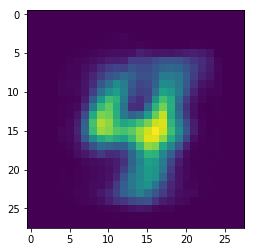

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  2



  0%|          | 1/214 [00:02<09:17,  2.62s/it]

[0 7 1 8 4 4 0 9 7 1 5 8 9 0 0 1 4 5 7 6 5 2 7 2 8 8 2 7 4 8 5 6 9 8 0 0 1
 3 2 2 6 5 5 2 3 8 3 6 2 4 7 5 0 0 0 5 1 5 3 6 4 2 6 2 8 0 4 9 5 4 6 5 8 1
 4 7 4 1 2 5 2 8 1 9 9 2 0 2 5 6 1 8 5 0 2 1 7 6 6 1 6 3 3 9 8 3 9 2 1 9 5
 3 2 9 0 3 7 2 9 6 6 6 1 2 8 6 7 6 8 6 2 1 7 6 6 0 1 1 6 2 5 0 1 5 2 2 3 1
 7 0 7 5 7 4 2 6 1 5 6 7 8 1 3 1 2 2 1 8 4 4 1 6 6 3 9 7 4 8 4 8 9 7 5 3 8
 2 4 2 2 7 7 5 2 3 3 2 4 9 1 0 1 1 4 7 0 2 4 3 1 2 7 3 0 5 2 7 8 4 8 0 1 9
 2 9 0 3 3 6 7 2 6 1 8 0 1 9 4 3 9 3 8 3 0 1 9 1 1 8 9 2 8 8 0 7 2 6]
[0 7 1 8 4 4 0 9 7 1 5 8 9 0 0 1 4 5 7 6 5 2 7 2 8 8 2 7 4 8 5 6 9 8 0 0 1
 3 2 2 6 5 5 2 3 8 3 6 2 4 7 5 0 0 0 5 1 5 3 6 4 2 6 2 8 0 4 9 5 4 6 5 8 1
 4 7 4 1 2 5 2 8 1 9 9 2 0 2 5 6 1 8 5 0 2 1 7 6 6 1 6 3 3 9 8 3 9 2 1 9 5
 3 2 9 0 3 7 2 9 6 6 6 1 2 8 6 7 6 8 6 2 1 7 6 6 0 1 1 6 2 5 0 1 5 2 2 3 1
 7 0 7 5 7 4 2 6 1 5 6 7 8 1 3 1 2 2 1 8 4 4 1 6 6 3 9 7 4 8 4 4 9 7 5 3 8
 2 4 2 2 7 7 5 2 3 3 2 4 9 1 0 1 1 4 7 0 2 4 3 1 2 7 3 0 5 2 7 8 4 8 0 1 9
 2 9 0 3 3 6 7 2 6 1 8 0 1 9 4


  1%|          | 2/214 [00:05<09:16,  2.63s/it]

[2 8 7 9 9 5 4 6 8 3 0 9 1 0 1 2 5 8 8 4 8 6 0 2 8 4 9 4 3 4 7 8 0 3 5 1 3
 6 3 0 1 2 4 3 0 1 7 5 6 2 0 5 6 2 4 3 8 9 3 7 6 1 0 5 6 9 0 3 9 8 3 8 5 8
 9 0 7 5 1 0 1 9 8 3 0 9 3 1 3 2 7 8 0 6 1 5 5 6 8 5 9 6 0 8 1 9 8 3 0 7 8
 1 3 5 6 3 0 2 6 6 3 7 1 9 0 2 6 1 0 1 8 6 1 7 3 7 0 4 7 8 5 8 9 8 3 1 8 9
 0 1 1 1 2 5 8 2 1 1 7 7 7 8 9 7 5 1 6 9 2 6 5 7 9 6 7 6 2 6 9 8 4 8 6 8 8
 4 2 1 0 4 0 3 6 0 0 6 9 9 1 5 2 8 6 7 0 7 1 3 9 2 8 7 8 2 5 3 0 8 1 7 6 5
 9 5 4 5 8 2 2 7 7 1 8 3 8 3 8 1 4 3 8 8 1 8 4 3 0 3 4 9 9 9 9 1 0 7]
[2 8 7 9 9 5 4 6 8 3 0 9 1 0 1 2 9 8 8 4 8 6 0 2 8 4 9 4 3 8 7 8 0 3 5 1 3
 6 3 0 1 2 4 3 0 1 7 5 6 2 0 5 6 2 4 3 8 9 3 7 6 1 0 5 6 9 0 3 9 8 3 8 5 8
 9 0 7 5 1 0 1 9 8 3 0 9 3 1 3 2 7 8 0 6 1 5 5 6 8 5 9 6 0 8 1 9 8 3 0 7 8
 1 3 5 6 3 0 2 6 6 3 7 1 9 0 2 6 1 0 1 8 6 1 7 3 7 0 4 7 8 5 8 9 8 3 1 8 9
 0 1 1 1 2 5 8 2 1 1 7 7 7 8 9 7 5 1 6 9 2 6 5 7 9 6 7 6 2 6 9 8 4 8 6 8 8
 4 2 1 0 4 0 3 6 0 0 6 9 9 1 5 2 8 6 7 0 7 1 3 9 2 8 7 6 2 5 3 0 8 1 7 6 5
 9 5 4 5 8 2 2 7 7 1 8 3 8 3 8


  1%|▏         | 3/214 [00:07<09:16,  2.64s/it]

[3 9 3 0 3 2 2 8 1 0 9 7 6 0 1 9 1 9 0 4 0 3 8 1 3 8 3 5 6 9 7 7 8 2 8 9 7
 6 2 2 7 8 9 8 6 4 1 2 5 1 2 5 6 4 4 8 2 2 9 9 0 1 3 7 8 7 0 4 3 3 2 6 9 3
 1 6 5 6 5 7 8 2 3 6 1 8 5 9 5 4 7 2 8 7 2 3 0 8 2 6 1 2 3 4 6 2 3 8 2 7 6
 6 6 9 9 8 1 5 9 9 7 5 1 4 9 8 7 4 3 2 6 7 7 1 7 0 1 6 9 2 9 3 4 5 4 9 8 6
 1 0 3 8 2 4 2 3 0 3 7 2 1 6 1 2 8 7 8 6 7 2 2 9 8 6 9 1 8 0 5 0 8 2 8 4 3
 8 2 7 8 7 0 8 5 2 4 0 3 5 6 7 9 3 2 1 7 7 9 1 6 3 6 8 1 0 1 4 2 2 4 7 2 7
 4 6 1 6 5 5 1 7 1 4 4 2 7 7 4 7 2 2 5 3 9 1 4 8 4 0 8 1 0 0 3 0 3 4]
[3 9 3 0 3 2 2 8 1 0 9 7 6 0 1 9 1 9 0 4 0 3 8 1 3 8 3 6 6 9 7 7 8 2 8 9 7
 6 2 2 7 8 9 8 6 4 1 2 5 1 2 5 6 4 4 8 2 2 9 9 0 1 3 7 8 7 0 4 3 3 2 6 9 3
 1 6 5 6 5 7 8 2 3 6 1 8 5 9 5 4 7 2 8 7 2 3 0 8 2 6 1 2 3 4 6 2 3 8 2 7 6
 6 6 9 9 8 1 5 9 9 7 5 1 4 9 8 7 4 3 2 6 7 7 1 7 0 1 6 9 2 9 3 4 5 4 9 8 6
 1 0 3 8 2 4 2 3 0 3 7 2 1 6 1 2 8 7 8 6 7 2 2 9 8 6 9 1 8 0 5 0 8 2 8 4 3
 8 2 7 8 7 0 8 5 2 4 0 3 5 6 7 9 3 2 1 7 7 9 1 6 3 6 8 1 0 1 4 2 2 4 7 2 7
 4 6 1 6 5 5 1 7 1 4 4 2 7 7 1


  2%|▏         | 4/214 [00:10<09:13,  2.63s/it]

[8 1 7 9 0 3 4 5 6 6 4 6 8 3 4 2 9 9 3 9 8 8 5 5 4 4 2 1 8 3 9 2 3 4 6 2 4
 9 5 4 9 8 8 4 3 7 4 5 4 3 3 5 8 3 9 8 1 1 3 8 7 0 2 3 1 9 8 4 2 5 4 2 7 0
 9 7 7 2 3 2 8 8 6 2 7 2 9 4 7 7 2 0 8 6 8 8 5 8 9 4 2 3 2 7 0 6 1 1 7 0 0
 8 3 4 1 3 4 3 9 8 7 2 9 8 7 4 3 7 9 1 4 1 5 9 3 4 1 7 8 8 5 4 2 3 0 6 7 7
 4 9 8 6 9 5 6 7 1 4 3 4 1 1 2 0 2 1 9 6 0 4 7 0 1 9 2 1 4 9 3 7 3 0 5 6 8
 9 0 9 3 2 6 5 6 6 2 7 7 8 6 5 3 4 8 8 3 0 8 8 6 7 9 1 2 9 7 9 8 7 9 8 3 3
 9 6 1 3 0 3 3 0 8 4 9 3 5 0 0 5 7 4 2 9 3 6 0 6 5 2 2 2 3 1 2 9 9 6]
[8 1 7 9 0 3 4 5 6 6 4 6 8 3 4 2 9 9 3 9 8 8 5 5 4 4 2 1 8 3 9 2 3 4 6 2 4
 9 5 4 9 8 8 4 3 7 4 5 4 3 3 5 8 3 9 8 1 1 3 8 7 0 2 3 1 9 8 4 2 5 4 2 7 0
 9 7 7 2 3 2 8 8 6 2 7 2 9 4 7 7 2 0 8 6 8 8 5 8 9 4 2 3 2 7 0 6 1 1 7 0 0
 8 3 4 1 3 4 3 9 8 7 2 9 8 7 4 3 7 9 1 4 1 5 9 3 4 1 7 8 8 5 4 2 3 0 6 7 7
 4 9 8 6 9 5 6 7 1 4 3 4 1 1 2 0 2 1 9 6 0 4 7 0 1 9 2 1 4 9 3 7 3 0 5 6 8
 9 0 9 3 2 6 5 6 6 2 7 7 8 6 5 3 4 8 8 3 0 8 8 6 7 9 1 2 9 7 9 8 7 9 8 3 3
 9 6 1 3 0 3 3 0 8 4 9 3 5 0 0


  2%|▏         | 5/214 [00:13<09:10,  2.63s/it]

[1 5 1 0 1 5 4 6 5 4 5 0 5 0 2 8 3 8 6 1 1 9 3 3 6 9 1 9 9 9 9 5 0 4 7 8 0
 6 0 6 5 9 8 3 9 2 2 2 7 5 0 7 9 3 5 5 1 6 7 8 0 6 0 4 4 2 6 2 7 0 9 4 7 4
 7 1 6 9 3 8 6 1 8 2 6 4 6 6 0 4 4 3 6 4 6 8 7 6 1 3 4 0 7 0 9 0 7 0 8 1 2
 5 3 6 7 8 4 4 9 9 9 7 7 6 1 3 7 2 1 7 3 9 1 6 7 0 4 9 1 9 3 9 7 4 3 5 5 0
 6 3 6 6 3 3 4 7 4 0 6 0 6 0 1 3 4 2 6 3 6 4 4 3 5 0 8 7 4 6 0 6 0 3 3 5 0
 2 3 0 0 9 2 9 9 5 2 2 0 5 4 3 5 4 4 5 0 4 6 0 9 9 0 5 4 5 2 5 9 1 7 1 3 6
 4 4 5 8 6 1 5 0 3 8 1 4 0 7 3 2 9 9 9 7 1 7 6 1 8 8 5 9 1 8 9 7 8 4]
[1 5 1 0 1 5 4 6 5 4 5 0 5 0 2 8 3 8 6 1 1 9 3 3 6 9 1 9 9 9 9 5 0 4 7 8 0
 6 0 6 5 9 8 3 9 2 2 2 7 5 0 7 9 3 5 5 1 6 7 8 0 6 0 4 4 2 6 2 7 0 9 4 7 4
 7 1 6 9 3 8 6 1 8 2 6 4 6 6 0 4 4 3 6 4 6 8 7 6 1 3 4 0 7 0 9 0 7 0 8 1 2
 5 3 6 7 8 4 4 9 9 9 7 7 6 1 3 7 2 1 7 3 9 1 6 2 0 4 4 1 9 3 9 7 4 3 5 5 0
 6 3 6 6 3 3 4 7 4 0 6 0 6 0 0 3 4 2 6 3 6 4 4 3 5 0 8 7 4 6 0 6 0 3 3 5 0
 2 3 0 0 9 2 9 9 5 2 2 0 5 4 3 5 4 4 5 0 4 6 0 9 9 0 5 4 5 2 5 9 1 7 1 3 6
 4 4 5 8 6 1 5 0 3 8 1 4 0 7 3


  3%|▎         | 6/214 [00:15<09:09,  2.64s/it]

[2 7 0 3 3 4 4 6 9 3 6 2 6 6 7 9 4 5 4 9 9 8 1 6 7 4 2 1 3 8 0 4 4 3 0 2 8
 9 4 9 0 3 3 7 6 9 7 5 5 1 6 5 8 8 4 1 2 2 2 5 4 2 0 6 5 0 1 8 4 8 8 2 5 7
 4 3 0 6 6 9 4 6 0 0 7 5 4 9 3 4 5 8 6 2 2 0 4 0 0 6 3 8 0 6 3 4 0 2 2 9 3
 3 1 7 2 1 5 7 2 1 0 0 8 7 5 8 8 3 6 0 0 2 7 2 3 6 8 5 3 9 1 6 5 1 9 7 6 4
 1 2 1 1 7 2 1 2 0 0 9 4 7 4 1 5 1 7 5 0 0 3 3 0 8 9 1 0 1 0 1 0 4 1 7 7 9
 3 0 1 4 8 0 1 5 2 2 9 0 4 3 7 5 9 9 2 7 7 1 0 2 6 7 3 8 6 7 3 0 6 6 4 1 6
 4 5 9 9 4 2 1 4 9 4 7 5 2 8 6 7 0 0 1 8 8 8 2 3 1 6 4 6 3 8 8 0 9 2]
[2 7 0 3 3 4 4 6 9 3 6 2 6 6 7 9 4 5 4 9 9 8 1 6 7 4 2 1 3 8 0 4 4 3 0 2 8
 9 4 9 0 3 3 7 6 9 7 5 5 1 6 5 8 8 4 1 2 2 2 5 4 2 0 6 5 0 1 8 4 8 8 2 5 7
 4 3 0 6 6 8 4 6 0 0 7 5 4 9 3 4 5 8 6 2 2 0 4 0 0 6 3 8 0 6 3 4 0 2 2 9 3
 3 1 7 2 1 5 7 2 1 0 0 8 7 5 8 8 3 6 0 0 2 7 2 3 6 8 5 3 9 1 6 5 1 9 7 6 4
 1 2 1 1 7 2 1 2 0 0 9 4 7 4 1 5 1 7 5 0 0 3 3 0 8 9 1 0 1 0 1 0 4 1 7 7 9
 3 0 1 4 8 0 1 5 2 2 9 0 4 3 7 5 9 9 2 7 7 1 0 2 6 7 3 8 6 7 3 0 6 6 4 1 6
 4 5 9 9 4 2 1 4 9 4 7 5 2 8 6


  3%|▎         | 7/214 [00:18<09:09,  2.66s/it]

[2 9 0 7 3 7 7 8 9 1 4 6 0 0 7 8 3 4 0 0 1 2 7 3 0 6 1 0 9 0 2 6 1 7 8 7 8
 7 5 7 6 6 2 5 8 3 7 9 8 9 0 3 4 2 0 3 4 2 1 8 5 8 8 4 4 2 9 9 7 4 7 5 1 2
 8 2 2 4 6 6 8 2 0 9 6 2 2 8 9 1 3 9 2 2 6 2 7 1 2 6 1 1 9 4 6 2 1 3 1 0 8
 1 2 2 3 7 5 2 1 0 1 6 2 3 9 2 6 5 4 6 8 9 4 1 3 6 6 9 1 3 8 9 0 1 9 5 2 9
 1 5 4 1 0 7 0 4 0 6 3 1 3 6 9 7 5 6 9 7 3 7 3 1 7 4 9 7 5 9 0 1 0 3 1 1 2
 1 9 4 9 3 2 9 6 6 7 6 3 9 8 6 7 7 3 9 6 0 1 9 9 9 6 7 1 1 9 4 0 2 9 4 8 5
 7 4 1 1 1 2 5 4 8 5 4 5 4 8 9 8 8 3 3 8 8 6 4 3 1 0 7 4 2 8 4 3 1 1]
[2 9 0 7 3 7 7 8 9 1 4 6 0 0 7 8 3 4 0 0 1 2 7 3 0 6 1 0 9 0 2 6 1 7 8 7 8
 7 5 7 6 6 2 5 8 3 7 9 8 9 0 3 4 2 0 3 4 2 1 8 5 8 8 4 4 2 9 9 7 4 7 5 1 2
 8 2 2 4 6 6 8 2 0 9 6 2 2 8 9 1 3 9 2 2 6 2 7 1 2 6 1 1 9 4 6 2 1 3 1 0 8
 1 2 2 3 7 5 2 1 0 1 6 2 3 9 2 6 5 4 6 8 9 4 1 3 6 6 9 1 3 8 9 0 1 9 5 2 9
 1 5 4 1 0 7 0 4 0 6 3 1 3 6 9 7 5 6 9 7 3 7 3 1 7 4 9 7 5 9 0 1 0 3 1 1 2
 1 9 4 9 3 2 9 6 6 7 6 3 9 8 6 7 4 3 9 6 0 1 9 9 9 6 7 1 1 9 4 0 7 9 4 8 5
 7 4 1 1 1 2 5 4 8 5 4 5 4 8 9


  4%|▎         | 8/214 [00:21<09:05,  2.65s/it]

[7 9 4 9 9 9 3 8 1 0 7 5 8 6 6 5 3 7 7 2 6 5 0 1 7 4 4 1 8 0 1 9 9 3 4 8 3
 3 3 3 8 6 4 9 4 3 1 0 9 9 5 5 7 0 1 2 1 1 6 0 3 1 9 2 7 3 9 4 2 6 8 2 9 3
 1 1 7 6 0 7 9 3 0 2 8 0 6 3 6 7 8 2 1 8 5 0 8 0 9 2 8 6 8 1 6 9 8 2 9 7 5
 8 1 3 3 5 3 9 1 3 4 3 2 6 8 4 1 1 4 0 7 3 4 7 4 3 4 8 5 6 1 5 1 6 8 4 5 3
 5 0 1 3 6 8 6 1 4 3 0 3 7 9 8 6 6 7 2 2 6 3 9 6 8 8 1 0 7 8 6 1 4 7 2 4 2
 1 2 8 9 9 5 2 7 4 9 7 1 9 9 2 3 3 9 0 9 2 7 8 8 7 1 2 7 7 9 8 1 1 3 2 3 5
 3 1 4 0 1 3 5 2 9 3 2 8 3 8 2 9 5 7 6 6 7 6 1 2 1 0 9 2 1 0 0 5 9 1]
[7 9 4 9 9 9 3 8 1 0 7 5 8 6 6 5 3 7 7 2 6 5 0 1 7 4 4 1 8 0 1 9 9 3 4 8 3
 3 3 3 8 6 4 9 4 3 1 0 9 9 5 5 7 0 1 2 1 1 6 0 3 1 9 2 7 3 9 4 2 6 8 2 9 3
 1 1 7 6 0 7 9 3 0 2 8 0 6 3 6 7 8 2 1 8 5 0 8 0 9 2 8 6 8 1 6 9 8 2 9 7 5
 8 1 3 3 5 3 9 1 3 4 3 2 6 8 4 1 1 4 0 7 3 4 7 4 3 4 8 5 6 1 5 1 6 8 4 5 3
 5 0 1 3 6 8 6 1 4 3 0 3 7 9 8 6 6 7 2 2 6 3 9 6 8 8 1 0 7 8 6 1 4 7 2 4 2
 1 2 8 9 9 5 2 7 4 9 7 1 9 9 2 3 3 9 0 9 2 7 8 8 7 1 2 7 7 9 8 1 1 3 2 3 5
 3 1 4 0 1 3 5 2 9 3 2 8 3 8 2


  4%|▍         | 9/214 [00:23<09:02,  2.65s/it]

[3 3 3 9 7 8 1 0 2 0 0 1 2 5 6 6 5 8 2 8 8 2 0 6 3 7 8 6 8 4 6 1 4 3 2 0 3
 9 9 6 6 5 8 8 8 8 4 7 2 5 3 5 6 6 9 0 1 0 7 7 6 9 3 4 6 2 6 2 6 3 0 1 3 9
 5 3 5 7 4 3 9 6 0 2 7 0 2 6 1 7 4 9 0 5 0 1 3 1 1 7 4 0 5 6 1 5 5 6 3 6 2
 1 4 1 1 8 2 6 2 2 1 3 6 3 0 3 9 0 5 4 9 5 2 3 2 0 9 1 9 6 1 2 4 3 4 1 4 6
 8 1 9 4 5 0 7 4 6 1 7 1 9 0 4 5 7 2 4 7 2 4 3 2 7 2 5 2 8 5 5 6 8 2 0 6 5
 8 4 4 0 1 9 1 8 0 2 0 1 9 3 8 7 1 3 8 7 2 5 3 4 5 5 5 4 7 4 3 1 0 1 7 8 5
 8 4 1 1 4 0 7 0 8 5 0 8 8 1 4 8 7 6 8 5 9 0 2 5 7 8 4 2 1 3 6 9 5 8]
[3 3 3 9 7 8 1 0 2 0 8 1 2 5 6 6 5 5 2 8 8 2 0 6 3 7 8 6 8 4 6 1 4 3 2 0 3
 9 9 6 6 5 8 8 8 8 4 7 2 5 3 5 6 6 9 0 1 0 7 7 6 9 3 4 6 2 6 2 6 3 0 1 3 9
 5 3 5 7 9 3 0 6 0 2 7 0 2 6 1 7 4 9 0 5 0 1 3 1 1 7 0 0 5 6 1 5 5 6 3 6 2
 1 4 1 1 8 2 6 2 2 1 3 6 3 0 3 9 0 5 4 9 5 2 3 2 0 9 1 9 6 1 2 4 3 4 1 4 6
 8 1 9 4 5 0 7 4 6 1 7 1 9 0 4 5 7 2 4 7 2 4 3 2 7 2 5 2 8 5 5 6 8 2 0 6 5
 8 7 4 0 1 9 1 8 0 2 0 1 9 3 8 7 1 3 8 7 2 5 3 4 5 5 5 4 7 4 3 1 0 1 7 8 5
 8 4 1 1 4 0 7 0 8 5 0 8 8 1 4


  5%|▍         | 10/214 [00:26<09:01,  2.65s/it]

[8 9 0 0 5 0 2 7 6 0 4 4 8 9 3 0 6 0 3 4 9 5 2 0 5 0 3 6 3 7 6 2 6 7 9 7 3
 8 4 4 4 6 4 6 5 9 4 5 5 0 6 7 3 9 7 2 5 6 5 4 9 5 3 6 9 2 1 1 0 6 7 8 1 9
 2 9 7 0 2 2 4 6 8 9 9 0 4 5 2 4 3 9 1 1 0 7 3 5 0 4 3 9 9 1 1 0 0 6 1 3 6
 9 9 9 8 7 0 5 1 1 8 5 5 4 7 7 3 4 7 5 8 7 5 6 3 7 0 2 2 0 1 2 4 4 0 5 1 2
 7 3 5 6 1 8 3 7 4 7 2 3 5 7 8 1 2 8 6 9 5 2 4 2 7 6 8 0 4 3 4 6 1 7 4 2 0
 8 2 7 6 2 4 4 3 2 3 8 7 3 3 6 1 3 5 6 7 9 5 2 9 3 5 0 6 0 6 0 8 2 9 7 7 8
 2 0 1 3 0 4 4 9 0 4 6 6 6 7 8 3 3 1 2 0 0 3 9 8 7 6 6 6 4 1 1 9 0 5]
[8 9 0 0 5 0 2 7 6 0 4 4 8 9 3 0 6 0 3 4 9 5 2 0 5 0 3 6 3 7 6 2 6 7 9 7 3
 8 4 4 4 6 4 6 5 9 4 5 5 0 6 7 3 9 7 2 5 6 5 4 9 5 3 6 9 2 1 1 0 6 7 8 1 9
 2 9 7 0 2 2 4 6 8 9 9 0 7 5 2 4 3 9 1 1 0 7 3 5 0 4 3 9 9 1 1 0 0 6 1 3 6
 9 9 9 8 7 0 5 1 1 8 5 5 4 7 7 3 4 7 5 8 7 5 6 3 7 0 2 2 0 1 2 4 4 0 5 1 2
 7 3 5 6 1 8 3 7 4 7 2 3 5 7 8 1 2 8 6 9 5 2 4 2 7 6 8 0 4 3 4 6 1 7 4 2 0
 8 2 7 6 2 4 4 3 2 3 8 7 3 3 6 1 3 5 6 7 9 5 2 9 3 5 0 6 0 6 0 8 2 9 7 7 8
 3 0 1 3 0 4 4 9 0 4 6 6 5 7 8


  5%|▌         | 11/214 [00:29<08:59,  2.66s/it]

[6 0 5 1 0 0 5 3 9 7 7 9 8 6 7 2 7 2 3 8 9 9 8 7 7 6 8 3 2 0 7 4 7 4 9 1 2
 2 4 1 1 4 9 2 9 3 2 9 5 1 1 3 0 1 8 5 2 9 4 3 0 9 9 4 9 5 8 8 0 8 2 3 2 8
 6 3 8 5 4 9 0 5 4 0 1 9 6 6 0 1 8 8 1 0 8 1 6 5 2 6 6 8 1 9 9 7 7 6 0 0 3
 5 6 6 2 4 7 3 3 1 3 8 1 1 8 4 7 4 4 0 9 4 6 9 2 0 4 0 4 4 8 4 0 3 2 2 0 7
 8 8 2 0 8 4 4 2 6 1 2 8 2 2 2 8 5 8 7 0 3 6 6 0 6 5 2 7 1 9 0 0 7 9 0 0 8
 7 3 4 9 9 7 2 8 9 7 7 6 1 3 2 0 5 9 8 5 9 0 0 9 9 8 6 0 2 7 3 7 2 3 5 3 4
 0 7 6 8 3 8 9 7 9 4 5 1 8 2 8 6 3 4 1 9 4 1 0 1 1 3 2 4 3 9 4 2 7 4]
[6 0 5 1 0 0 5 3 9 7 7 9 8 6 7 2 7 2 3 8 9 9 8 7 7 6 8 3 2 0 7 4 7 4 9 1 2
 2 4 1 1 4 9 2 9 3 2 9 5 1 1 3 0 1 8 5 2 9 4 3 0 9 9 4 9 5 8 8 0 8 2 3 2 8
 6 3 8 5 4 9 0 5 4 0 1 9 6 6 0 1 8 8 1 0 8 1 6 5 2 6 6 8 1 9 9 7 7 6 0 0 3
 5 6 6 2 4 7 3 3 1 3 8 1 1 8 4 7 4 4 0 9 4 6 9 2 0 4 0 4 4 8 4 0 3 2 2 0 7
 8 8 2 0 8 4 4 2 6 1 2 8 2 2 2 8 5 8 8 0 3 6 6 0 6 5 2 7 1 9 0 0 7 9 0 0 8
 7 3 4 9 9 7 2 8 9 7 7 6 1 3 2 0 5 9 8 5 9 0 0 9 9 8 6 0 2 7 3 7 2 3 5 3 4
 0 7 6 8 3 8 9 7 9 4 5 1 8 2 8


  6%|▌         | 12/214 [00:31<08:55,  2.65s/it]

[6 7 6 6 8 3 2 4 0 8 9 9 9 3 3 6 5 0 5 0 5 3 8 0 7 5 3 8 7 8 0 0 0 5 8 1 0
 4 0 9 3 9 6 0 5 7 1 3 7 1 6 3 0 3 6 9 3 7 4 1 1 0 9 0 1 2 5 4 7 9 4 0 9 3
 6 1 9 1 9 4 7 8 0 4 2 1 0 7 6 0 0 8 2 1 6 3 5 7 1 2 2 4 8 9 6 8 7 8 1 3 2
 3 9 1 6 0 6 7 2 5 0 4 0 9 7 5 9 1 8 7 8 9 9 2 6 2 0 7 4 1 5 3 7 0 7 7 9 8
 4 1 3 3 5 1 4 0 5 5 8 4 1 8 9 5 0 6 6 8 7 5 8 2 6 1 6 0 8 8 6 2 1 1 0 1 0
 2 1 9 7 6 0 3 9 7 2 9 1 1 1 6 9 9 6 8 7 7 1 2 3 1 8 9 2 4 4 0 9 6 5 7 6 1
 7 1 8 8 4 5 7 7 0 2 2 1 1 4 7 1 8 5 9 4 5 9 0 5 2 3 1 3 3 2 6 1 8 0]
[6 7 6 6 8 3 2 4 0 8 9 9 9 3 3 6 5 0 5 0 5 3 8 0 7 5 3 8 7 8 0 0 0 5 8 1 0
 4 0 9 3 9 6 0 5 7 1 3 7 1 6 3 0 3 6 9 3 7 4 1 1 0 9 0 1 2 5 4 7 9 4 0 9 3
 6 8 9 1 9 4 7 8 0 4 2 1 0 7 6 0 0 8 2 1 6 3 5 7 1 2 2 4 8 9 6 8 7 8 1 3 2
 3 9 1 6 0 6 7 2 5 0 4 0 9 7 5 9 1 8 7 8 9 9 2 6 2 0 7 4 1 5 3 7 0 7 7 9 8
 4 1 3 3 5 1 4 0 5 5 8 4 1 8 9 5 0 6 6 8 7 5 8 2 6 1 6 0 8 8 6 2 1 1 0 1 0
 2 1 5 7 6 0 3 9 7 2 9 1 1 1 6 9 9 6 8 7 7 1 2 3 1 8 9 2 4 4 0 9 6 5 7 6 1
 7 1 8 8 4 5 7 7 0 2 2 1 1 4 7


  6%|▌         | 13/214 [00:34<08:51,  2.64s/it]

[5 4 4 0 7 1 5 0 6 1 1 1 0 7 6 4 5 1 7 2 6 5 2 3 5 7 9 8 0 4 2 0 0 4 1 2 1
 9 5 6 5 8 1 3 0 2 9 9 0 1 9 0 3 4 7 3 5 1 9 1 6 9 7 2 1 4 5 5 9 3 0 7 4 6
 9 7 1 1 3 9 1 8 0 8 6 0 3 2 6 7 9 4 4 6 0 5 8 8 0 2 4 4 5 2 2 4 3 4 8 4 6
 0 1 1 2 4 7 4 2 0 5 7 5 0 3 2 9 2 5 8 1 9 4 1 3 4 4 7 5 7 3 6 3 7 8 3 6 7
 9 5 3 4 5 0 3 1 1 3 9 7 0 9 4 8 0 7 4 7 1 1 3 2 5 8 0 2 8 2 8 5 2 8 9 7 9
 4 9 2 9 6 4 9 0 7 3 8 7 3 8 4 1 4 7 9 4 8 6 9 1 7 2 3 3 3 8 1 5 3 7 8 2 9
 1 4 5 7 8 3 8 9 4 3 2 2 3 0 9 1 8 3 9 5 5 8 0 5 9 0 3 2 4 0 1 3 7 5]
[5 4 4 0 7 1 5 0 6 1 1 1 0 7 6 4 5 1 7 2 6 5 2 3 5 7 9 8 0 4 2 0 0 4 1 2 1
 9 5 6 5 8 1 3 0 2 3 9 0 1 9 0 3 4 7 3 5 1 9 1 6 9 7 2 1 4 5 5 9 3 0 7 4 6
 9 7 1 1 3 9 1 8 0 8 6 0 3 1 6 7 9 4 4 6 0 5 8 8 0 2 4 4 5 2 2 4 3 4 8 4 6
 0 1 1 2 4 7 4 2 0 5 7 5 0 3 2 9 2 5 8 1 9 4 1 3 4 4 7 5 7 3 6 3 7 8 3 6 7
 9 5 3 4 5 0 3 1 1 3 9 7 0 9 4 8 0 7 4 7 1 1 3 2 5 8 0 2 8 2 8 5 2 8 9 7 9
 4 9 2 9 6 4 9 0 7 3 8 7 3 8 4 1 4 7 9 4 8 6 9 1 7 2 3 3 3 8 1 5 3 7 8 2 9
 1 4 5 7 8 3 8 9 4 3 2 2 3 0 9


  7%|▋         | 14/214 [00:37<08:49,  2.65s/it]

[1 1 9 0 3 6 6 1 7 7 8 7 8 2 5 9 3 3 1 3 3 4 6 2 1 8 2 1 2 8 4 9 5 3 5 4 8
 5 9 4 1 1 8 5 8 6 4 9 7 8 9 3 1 5 0 3 0 2 4 2 1 4 9 2 1 7 1 9 3 9 0 6 6 9
 7 1 9 0 1 9 2 2 0 4 6 3 2 3 2 0 7 1 6 2 2 5 4 7 5 4 5 5 8 8 6 8 8 2 7 9 1
 2 1 4 8 9 0 1 3 7 6 8 3 6 7 8 1 3 3 1 3 8 2 2 3 8 3 9 5 4 7 5 9 2 0 0 2 4
 2 4 7 1 0 3 4 3 3 7 1 0 8 1 1 5 9 4 6 3 0 9 1 7 2 3 7 1 2 2 5 2 8 1 1 1 3
 8 8 1 2 2 8 2 6 1 0 3 1 8 6 9 3 7 6 0 9 9 3 5 2 5 4 8 6 5 6 3 4 5 1 9 7 8
 3 1 1 8 5 9 0 3 8 3 0 2 3 0 4 0 2 3 0 5 4 9 8 1 5 8 3 7 7 9 2 3 8 9]
[1 1 9 0 3 6 6 1 7 7 8 7 8 2 5 9 3 3 1 3 3 4 6 2 1 8 2 1 2 8 4 9 5 3 5 4 8
 5 9 4 1 1 8 5 8 6 4 9 7 8 9 3 1 5 0 3 0 2 4 2 1 4 9 2 1 7 1 9 3 9 0 6 6 9
 7 1 9 0 1 9 2 2 0 4 6 3 2 3 2 0 7 1 6 2 2 5 4 7 5 4 5 5 8 8 5 8 8 2 7 9 1
 2 1 4 8 9 0 1 3 7 6 8 3 6 7 8 1 3 3 1 3 8 2 2 3 8 3 9 5 4 7 5 9 2 0 0 2 4
 2 4 7 1 0 3 4 3 3 7 1 0 8 1 1 5 9 4 6 3 0 9 1 7 2 3 7 1 2 2 5 2 8 1 1 1 3
 8 8 1 2 2 8 2 6 1 0 3 1 8 6 9 3 7 6 0 9 9 3 5 2 5 4 8 6 5 6 3 4 5 1 9 7 8
 3 1 1 8 5 9 0 3 8 3 0 2 3 0 4


  7%|▋         | 15/214 [00:39<08:47,  2.65s/it]

[5 7 8 8 9 3 2 7 0 0 1 1 9 8 7 3 5 7 4 8 4 4 6 1 3 5 4 7 8 2 7 8 6 6 8 0 9
 5 4 3 8 7 9 9 2 0 9 1 6 9 0 0 9 7 8 7 9 3 4 3 5 5 2 6 1 3 0 2 7 8 1 5 8 2
 7 2 7 9 3 8 2 2 8 9 2 3 3 6 7 3 4 3 9 9 8 2 2 0 6 8 6 2 5 1 6 7 0 2 5 3 2
 3 8 4 4 5 0 4 1 6 8 1 9 7 0 2 9 0 8 8 7 5 2 3 5 9 6 5 5 9 6 8 5 1 8 4 1 9
 9 1 9 9 2 0 6 4 0 1 9 1 1 1 3 8 7 2 2 8 2 9 1 5 9 3 9 6 5 0 7 2 2 5 5 7 2
 4 6 5 9 4 9 4 0 9 7 6 1 1 7 0 0 3 1 1 5 6 0 3 0 0 0 8 4 2 8 6 0 4 2 9 8 3
 4 0 0 6 2 3 3 2 7 4 2 2 3 2 7 2 8 7 4 7 0 4 7 3 3 2 8 9 0 1 7 1 7 2]
[5 7 8 8 9 3 2 7 0 0 1 1 9 8 7 3 5 7 4 7 4 4 6 1 3 5 4 7 8 2 7 8 6 6 8 0 9
 5 4 3 8 7 9 9 2 0 9 1 6 9 0 0 9 7 8 7 9 3 4 3 5 5 1 6 1 3 0 2 7 8 1 5 8 2
 7 2 7 9 3 8 2 2 8 9 2 3 3 6 7 3 4 3 9 9 8 2 2 0 6 8 5 2 5 1 6 7 0 2 5 3 2
 3 8 4 4 5 0 4 1 6 8 1 9 7 0 2 9 0 8 8 7 5 2 3 5 9 6 5 5 9 6 8 5 1 8 4 1 9
 9 1 9 9 2 0 6 4 0 1 9 1 1 1 3 8 7 2 2 8 2 9 1 9 9 3 9 6 5 0 7 2 2 5 5 7 2
 4 6 5 9 4 9 4 0 9 7 6 1 1 7 0 0 3 1 1 5 6 0 3 0 0 0 8 4 2 8 6 0 4 2 9 8 3
 4 0 0 6 2 3 3 2 7 4 2 2 3 2 7


  7%|▋         | 16/214 [00:42<08:44,  2.65s/it]

[1 4 6 4 4 6 6 8 6 9 6 8 7 7 8 8 0 2 6 5 2 2 6 3 9 7 1 2 7 0 7 4 1 5 3 6 0
 8 4 5 1 8 4 5 5 4 0 6 4 6 5 9 9 7 6 3 9 3 0 6 3 7 8 2 2 6 6 1 9 6 9 6 7 7
 9 5 5 1 8 6 3 5 7 7 9 2 2 0 6 7 7 5 1 5 5 3 9 6 7 8 9 6 1 8 9 9 8 5 0 5 3
 5 8 2 3 0 7 9 1 5 7 4 9 2 5 1 1 8 3 0 3 1 3 4 1 4 0 1 3 6 6 2 6 7 0 9 9 0
 3 5 9 8 5 9 7 3 8 8 3 8 8 4 7 1 6 2 2 0 8 5 7 8 7 7 2 6 7 4 2 4 5 3 1 1 1
 3 8 0 9 2 8 3 8 3 3 3 0 4 8 2 3 5 3 4 3 4 6 6 3 7 9 4 6 3 1 1 9 1 3 5 9 0
 1 4 9 6 2 9 2 4 9 6 1 5 0 6 8 3 0 7 3 8 8 9 0 7 5 2 0 1 0 4 6 9 5 3]
[1 4 6 4 4 6 6 8 6 9 6 8 7 7 8 8 0 2 6 5 2 2 6 3 9 7 1 2 7 0 7 4 1 5 3 6 0
 8 4 5 1 8 4 5 5 4 0 6 4 6 5 9 9 7 6 3 9 3 0 6 3 7 8 2 2 6 6 1 9 6 9 6 7 7
 9 5 5 1 8 6 3 5 7 7 9 2 2 0 6 7 7 5 1 5 5 3 9 6 7 8 9 6 1 3 9 9 8 5 0 5 3
 5 8 2 3 0 7 9 1 5 7 4 9 2 5 1 1 8 3 0 3 1 3 4 1 4 0 1 3 6 6 2 6 7 0 9 9 0
 3 5 9 8 5 9 7 3 8 8 3 8 8 4 7 1 6 2 2 0 8 5 7 8 7 7 2 6 7 4 2 4 5 3 1 1 1
 3 8 0 9 2 8 3 8 3 3 3 0 4 8 2 3 5 3 4 3 4 6 6 3 7 9 4 6 3 1 1 8 1 3 5 9 0
 1 4 9 6 2 9 2 4 9 6 1 5 0 6 8


  8%|▊         | 17/214 [00:45<08:41,  2.65s/it]

[7 0 3 0 4 6 3 6 3 1 5 9 7 0 3 8 2 2 4 0 5 7 9 6 6 8 1 9 2 1 5 1 2 6 2 0 9
 2 7 5 3 2 9 5 1 9 5 7 8 5 7 0 4 4 7 3 6 5 5 4 9 7 8 2 8 4 7 7 4 3 8 8 7 5
 0 4 5 9 1 9 3 1 1 5 5 4 4 4 9 0 4 5 1 2 8 8 8 5 2 1 3 3 8 4 9 2 1 2 6 1 3
 4 6 1 8 9 7 9 3 3 0 2 7 3 4 5 1 6 5 8 8 0 2 6 7 5 2 8 0 7 8 9 2 7 1 8 6 3
 5 6 1 2 0 1 4 7 8 2 7 1 3 3 6 3 1 4 3 2 6 3 8 8 5 2 3 2 9 5 2 0 3 5 5 4 3
 9 9 3 6 5 3 2 6 3 5 7 1 2 4 2 6 4 2 7 7 4 4 1 1 1 9 8 6 9 3 6 7 5 6 3 3 3
 3 9 8 9 5 5 1 8 1 0 1 6 6 9 7 7 1 9 0 4 1 5 4 6 9 0 4 2 7 2 1 1 3 1]
[7 0 3 0 4 6 3 6 3 1 5 9 7 0 3 8 2 2 4 0 5 7 9 6 6 8 1 9 2 1 5 1 2 6 2 0 9
 2 7 5 3 2 9 5 1 9 5 7 8 5 7 0 4 4 7 3 6 5 5 4 9 7 8 2 8 4 7 7 4 3 8 8 7 5
 0 4 5 9 1 9 3 1 1 5 5 4 4 4 9 0 4 5 1 2 8 8 8 5 2 1 3 3 8 4 9 2 1 2 6 1 3
 4 6 1 8 9 7 9 3 3 0 2 7 3 4 5 1 6 5 8 8 0 2 6 7 5 2 8 0 7 8 9 2 7 1 8 6 3
 5 6 1 2 0 1 4 7 8 2 7 1 3 3 6 3 1 4 3 2 6 3 8 8 5 2 3 2 9 5 2 0 3 5 5 4 3
 9 9 3 6 5 3 2 6 3 5 7 1 2 4 2 6 4 2 7 7 4 4 1 1 1 9 8 6 9 3 6 7 5 6 3 3 3
 3 9 8 9 5 5 1 8 1 0 1 6 6 9 7


  8%|▊         | 18/214 [00:47<08:39,  2.65s/it]

[7 3 8 8 7 4 4 7 9 0 7 8 1 5 4 3 3 6 3 3 2 0 4 9 0 9 5 7 5 5 7 8 1 3 1 3 9
 7 9 4 0 5 6 6 9 4 3 3 9 2 6 6 2 0 4 6 6 3 9 6 1 5 8 5 5 9 4 9 9 2 7 9 8 8
 0 0 5 5 9 1 2 9 3 5 5 9 8 1 0 5 3 2 4 3 3 5 1 1 0 0 6 7 3 3 4 8 6 7 8 8 0
 0 9 6 6 8 8 6 6 2 0 6 8 1 7 3 5 4 3 6 9 9 7 7 0 6 2 2 6 9 6 4 8 4 8 3 9 8
 5 3 8 2 4 7 3 9 0 4 6 5 3 6 7 4 0 5 7 6 2 6 9 2 4 4 7 5 8 6 6 3 9 9 0 4 5
 3 3 4 3 9 9 9 3 7 8 1 1 8 8 6 1 8 7 6 8 3 3 3 4 5 6 8 0 6 6 8 6 3 5 8 9 4
 5 7 1 5 5 5 8 6 5 8 2 6 9 2 7 6 7 2 8 1 0 9 4 5 3 3 6 8 1 7 9 0 7 5]
[7 3 8 8 1 4 4 7 9 0 7 8 1 5 4 3 3 6 3 3 2 0 4 9 8 9 5 7 5 5 7 8 1 3 1 3 4
 7 9 4 0 5 6 6 9 4 3 3 9 2 6 6 7 0 4 6 6 3 9 6 1 5 8 5 5 9 4 9 9 2 7 9 8 8
 0 0 5 5 9 1 2 9 3 5 5 9 8 1 0 5 3 2 4 3 3 5 1 1 0 0 6 7 3 3 4 8 6 7 8 8 0
 0 9 6 6 8 8 6 6 2 0 6 8 1 7 3 5 4 3 6 9 9 7 7 0 6 2 2 6 9 6 4 8 4 8 3 9 8
 5 3 8 2 9 7 3 9 0 4 6 5 3 6 7 4 0 5 7 6 2 6 9 2 4 4 7 5 8 6 6 3 9 9 0 4 5
 3 3 4 3 9 9 9 3 7 8 1 1 8 8 6 1 8 7 6 8 3 3 3 4 5 6 8 0 6 6 8 6 3 5 8 9 4
 5 7 1 5 6 5 8 6 5 8 2 6 9 2 7


  9%|▉         | 19/214 [00:50<08:37,  2.65s/it]

[1 3 1 9 6 9 1 9 6 6 1 0 1 2 8 3 5 6 5 5 4 7 6 9 9 7 5 3 9 4 7 8 1 5 0 9 2
 1 4 4 6 9 4 0 3 7 6 7 4 4 4 2 0 8 4 8 7 8 8 3 8 8 9 5 2 2 6 1 1 6 2 1 5 6
 8 1 7 7 2 6 9 9 5 9 4 8 6 3 6 1 9 6 0 2 3 1 0 4 0 8 2 3 8 8 2 2 4 1 2 8 8
 0 6 6 4 6 2 6 8 6 9 1 8 8 4 3 7 4 8 1 1 2 0 8 9 3 6 2 6 0 9 9 9 2 9 0 7 3
 5 7 7 0 0 1 3 5 7 4 7 9 1 2 2 0 0 4 9 3 1 1 4 5 1 1 5 5 6 3 5 8 5 7 7 2 3
 1 2 3 8 2 4 8 1 0 0 2 9 2 1 7 5 6 8 7 2 9 6 7 4 5 0 2 6 2 8 5 5 7 9 0 7 0
 8 8 2 4 8 7 2 7 7 3 6 2 3 5 8 5 3 1 0 0 4 1 0 6 1 6 3 5 0 6 9 1 9 5]
[1 3 1 9 6 9 1 9 6 6 1 0 1 2 8 3 5 6 5 5 4 7 6 9 9 7 5 3 9 4 7 8 1 5 0 9 2
 1 9 4 6 9 4 0 3 7 6 7 4 4 4 2 0 8 4 8 7 8 8 3 8 8 9 5 2 2 6 1 1 6 2 1 5 6
 8 1 7 7 2 6 9 9 5 9 4 8 6 3 6 1 9 6 0 2 3 1 0 4 0 8 2 3 8 8 2 2 4 1 2 8 8
 0 6 6 4 6 2 6 8 6 9 1 8 8 4 3 7 4 8 1 1 2 0 8 9 3 6 2 6 0 9 9 9 2 9 0 7 3
 5 7 9 0 0 1 3 5 7 4 7 9 1 2 2 0 0 4 9 3 1 1 4 5 1 1 5 5 6 3 5 8 5 7 7 2 3
 1 2 3 8 2 4 8 1 0 0 2 9 2 1 7 5 6 8 7 2 9 6 7 4 5 0 2 6 2 8 5 5 7 9 0 7 0
 8 8 2 4 8 7 2 7 7 3 6 2 3 5 8


  9%|▉         | 20/214 [00:52<08:30,  2.63s/it]

[3 0 8 8 2 8 4 8 9 5 8 2 7 0 6 8 3 5 6 7 0 7 5 7 4 3 7 9 5 8 4 5 4 9 9 8 9
 1 5 8 2 6 5 2 2 6 6 1 4 5 9 9 9 6 0 6 0 7 3 8 1 9 8 4 3 9 1 9 8 8 1 4 0 3
 0 9 2 1 5 5 8 5 5 6 3 7 2 0 4 2 2 6 6 3 7 0 1 0 5 9 0 7 4 8 7 2 6 6 8 9 4
 6 8 9 7 4 8 1 2 0 6 1 8 0 9 8 9 2 2 6 8 7 5 5 7 8 5 4 1 3 2 4 0 1 2 0 9 7
 6 5 9 9 2 4 8 7 1 2 8 2 3 8 7 0 2 8 8 3 2 8 3 5 6 3 8 7 7 5 1 4 6 4 0 4 5
 2 6 1 9 2 5 1 4 0 4 5 5 7 5 2 6 9 4 3 2 4 7 2 4 8 4 6 2 7 1 9 8 3 6 9 3 4
 1 2 0 6 2 2 6 8 3 1 6 4 3 6 1 1 5 2 4 8 7 8 3 8 5 7 3 4 7 6 4 2 2 5]
[3 0 8 8 2 8 4 8 9 5 8 2 7 0 6 8 3 5 6 7 0 7 5 7 4 3 7 9 5 8 6 5 4 9 9 8 9
 1 5 8 2 6 5 2 2 6 6 1 4 5 9 9 9 6 2 6 0 3 3 8 1 9 8 4 3 9 1 9 8 8 1 4 0 3
 0 9 2 1 5 5 8 5 5 6 3 7 2 0 4 2 2 6 6 3 7 0 1 0 5 9 0 7 4 8 7 2 6 6 8 9 4
 6 8 9 7 4 8 1 2 0 4 1 8 0 9 8 9 2 2 6 8 7 5 5 7 8 5 4 1 3 2 4 0 1 2 0 9 7
 6 5 9 9 2 4 8 7 1 2 8 2 3 1 7 0 2 8 8 3 2 8 3 5 6 3 8 7 7 5 1 4 6 4 0 4 5
 2 6 1 9 2 5 1 4 0 4 5 5 7 5 2 6 9 4 3 2 4 7 2 4 8 4 6 2 7 1 9 8 3 6 9 3 4
 1 2 0 6 2 2 6 8 3 1 6 4 3 6 1


 10%|▉         | 21/214 [00:54<08:24,  2.61s/it]

[1 6 2 2 9 7 1 4 3 3 2 8 8 3 2 8 3 5 7 0 3 3 9 4 2 9 3 4 0 1 5 8 9 7 2 2 4
 5 0 4 6 1 3 5 4 1 8 4 4 8 9 3 7 0 6 9 6 1 7 1 7 6 5 8 3 0 2 2 5 7 3 6 8 5
 8 0 3 9 2 3 2 6 7 0 5 7 9 9 6 8 5 1 4 6 3 5 9 9 0 8 3 9 8 8 4 1 5 4 1 4 1
 1 4 5 9 3 2 5 8 2 0 1 5 5 9 9 4 8 3 1 2 6 3 3 4 4 4 0 8 2 8 5 4 9 5 1 5 3
 5 0 9 9 9 4 0 4 8 5 4 5 0 0 9 0 5 4 9 1 9 0 8 9 8 2 2 7 8 2 7 1 3 1 9 8 1
 7 8 6 0 2 0 4 1 3 4 3 9 6 1 2 5 8 7 1 0 8 7 7 2 1 7 3 1 6 5 1 2 2 1 1 5 6
 9 8 4 4 8 4 4 4 6 5 3 9 0 5 3 7 7 0 7 6 4 0 1 8 3 8 9 7 1 5 0 6 3 0]
[1 6 2 2 9 7 1 4 3 3 2 8 8 3 2 8 3 5 7 0 3 3 9 4 2 9 3 4 0 1 5 8 9 7 2 2 4
 5 0 4 6 1 3 5 4 1 8 4 4 8 9 3 7 0 6 9 6 1 7 1 7 6 5 8 3 0 2 2 5 7 3 6 8 5
 8 0 3 9 2 3 2 6 7 9 5 7 9 9 6 8 5 1 4 6 3 5 9 9 0 8 3 9 8 8 4 1 5 4 1 4 1
 1 4 5 9 3 2 5 8 2 0 1 5 5 9 9 4 8 3 1 2 6 3 3 4 4 4 0 8 2 8 5 4 9 5 1 5 3
 5 0 9 9 9 4 0 4 8 5 4 5 0 0 9 0 5 4 9 1 9 0 8 9 8 2 2 7 8 2 7 1 3 1 9 8 1
 7 8 6 0 2 0 4 1 3 4 3 9 4 1 2 5 8 7 1 0 8 7 7 2 1 7 3 1 6 5 1 2 2 1 1 5 6
 9 8 4 4 8 4 4 4 6 5 3 9 0 5 3


 10%|█         | 22/214 [00:57<08:18,  2.59s/it]

[4 1 0 7 3 9 2 8 2 6 5 2 6 2 1 4 6 4 6 4 0 5 0 2 0 1 1 8 9 3 6 2 1 9 6 8 2
 4 8 8 1 1 1 2 2 1 9 6 1 2 9 6 9 1 8 2 5 4 6 0 4 8 8 5 6 2 9 7 0 1 9 8 1 5
 9 8 5 9 3 8 8 9 7 9 7 9 9 2 4 0 4 2 8 3 4 3 8 0 1 1 6 0 7 6 2 5 1 7 9 1 7
 4 6 5 8 4 6 1 1 2 0 7 7 5 7 2 7 6 9 3 9 7 3 9 7 1 5 8 1 3 5 9 5 8 7 7 7 7
 2 9 5 0 5 4 5 9 4 4 0 5 9 6 4 5 6 5 5 0 9 7 4 2 4 5 4 1 1 6 5 3 7 5 9 9 6
 3 4 5 1 9 6 0 0 1 9 4 9 5 8 0 4 2 1 9 8 6 3 7 2 2 7 0 4 7 9 8 6 7 8 0 8 8
 2 3 3 3 9 5 5 3 5 5 4 7 9 3 5 0 9 1 4 3 1 5 4 1 9 2 8 7 5 0 4 6 7 9]
[4 1 0 7 3 9 2 8 2 6 5 2 6 2 1 4 6 4 6 4 0 5 0 2 0 1 7 8 9 3 6 2 1 9 6 8 2
 4 8 8 1 1 1 2 2 1 9 6 1 2 9 6 9 1 8 2 5 4 6 0 4 8 8 5 6 2 9 7 0 1 7 8 1 5
 9 8 5 9 3 8 8 9 7 9 7 9 9 2 4 0 4 2 8 3 4 3 8 0 1 1 6 0 7 6 2 5 1 7 9 1 7
 4 6 5 8 4 6 1 1 2 0 7 7 5 7 2 7 6 9 3 9 7 3 9 7 1 5 8 1 3 5 9 5 8 7 7 7 7
 2 9 5 0 5 4 5 9 4 4 0 5 9 6 4 5 6 5 5 0 9 7 4 2 4 5 4 1 1 6 5 3 7 5 9 9 6
 3 4 5 1 9 6 0 0 1 9 4 9 5 8 0 4 2 1 4 8 6 3 7 2 2 7 0 4 7 9 8 6 7 8 0 8 8
 2 3 3 3 9 5 5 3 5 5 4 7 9 3 5


 11%|█         | 23/214 [00:59<08:11,  2.57s/it]

[8 0 9 1 8 5 7 6 9 9 6 1 5 3 0 2 6 1 7 7 3 4 0 2 9 1 8 9 6 7 9 8 7 4 2 0 7
 9 9 7 7 2 6 7 0 7 0 9 9 2 2 4 9 0 1 8 0 8 9 9 2 2 9 3 7 3 0 1 4 1 3 6 7 5
 3 8 9 3 4 1 5 5 0 4 9 9 1 8 2 9 4 6 4 8 5 2 5 5 1 1 7 3 6 1 2 5 1 3 3 2 9
 3 8 5 5 9 6 3 5 4 1 9 4 5 7 0 7 6 9 2 1 3 6 7 0 9 3 7 1 6 8 8 6 8 5 6 2 5
 5 4 5 8 8 2 7 9 4 6 3 4 8 4 7 1 4 8 2 7 1 8 3 9 2 2 8 1 6 2 6 1 6 5 8 4 4
 5 5 7 7 3 0 0 6 2 6 2 1 2 6 5 0 0 2 8 8 9 1 1 4 1 2 2 3 8 7 3 2 1 3 7 4 1
 2 7 1 8 0 7 3 3 8 4 4 7 6 3 3 1 3 1 7 9 9 0 4 7 9 4 9 0 4 7 3 2 5 2]
[8 0 9 1 8 5 7 6 9 9 6 1 5 3 0 2 6 1 7 7 3 4 0 2 9 1 8 9 6 7 9 8 7 4 2 0 7
 9 9 7 7 2 6 7 0 7 0 9 9 2 2 4 9 0 1 8 0 8 9 9 2 2 9 3 7 3 0 1 9 1 3 6 7 5
 3 8 9 3 4 1 5 5 0 4 9 9 1 8 2 9 4 6 4 8 5 2 5 5 1 1 7 3 6 1 2 5 1 3 3 2 9
 3 8 5 5 9 6 3 5 4 1 9 4 5 7 0 7 6 9 2 1 3 6 7 0 9 3 7 1 6 8 8 6 8 5 6 2 5
 5 4 5 8 8 2 7 9 4 6 3 4 8 4 7 1 4 8 2 7 1 8 3 9 2 2 8 1 6 2 6 1 6 5 8 4 4
 5 5 7 7 3 0 0 6 2 6 2 1 2 6 5 0 0 2 8 8 9 1 1 4 1 2 2 3 8 7 3 2 1 3 7 4 1
 2 7 1 8 0 7 3 3 8 4 4 7 6 3 3


 11%|█         | 24/214 [01:01<08:06,  2.56s/it]

[7 0 9 5 8 7 6 9 8 4 8 1 3 6 0 2 0 6 6 2 9 3 1 6 4 0 9 4 0 9 9 4 0 8 7 5 6
 3 7 5 3 3 0 4 6 0 3 4 3 9 9 8 4 4 7 0 7 4 8 7 1 4 6 9 0 5 2 1 7 9 0 4 4 6
 7 5 4 3 1 5 7 6 0 1 3 8 4 1 7 9 8 7 5 7 1 5 6 1 6 7 4 5 5 0 0 4 5 7 1 7 0
 6 8 4 5 8 3 5 1 8 2 5 0 5 6 6 5 3 4 7 7 3 2 2 3 1 3 1 7 7 3 8 0 6 4 9 1 7
 5 7 0 1 2 1 5 6 1 5 0 9 3 7 2 5 8 1 1 9 4 7 6 2 6 5 7 6 1 3 5 7 6 5 6 7 4
 5 8 7 3 5 9 8 1 1 3 9 8 6 7 7 9 1 8 9 1 7 6 8 3 5 2 0 8 0 2 5 0 9 3 2 7 8
 9 4 1 6 2 1 3 9 8 7 9 3 7 7 7 9 5 8 6 0 8 6 1 3 3 6 6 4 8 7 6 0 8 7]
[7 0 9 5 8 7 6 9 8 4 8 1 3 6 0 2 0 6 6 2 9 3 1 6 4 0 9 4 0 9 9 4 0 8 7 5 6
 3 7 5 3 3 0 4 6 0 3 4 3 9 9 8 4 4 7 0 7 4 8 7 1 4 6 9 0 5 2 1 7 9 0 9 4 6
 7 5 4 3 1 5 7 6 0 1 3 8 4 1 7 8 8 7 5 7 1 5 6 1 6 7 4 5 5 0 0 4 5 7 1 7 0
 6 8 4 5 8 3 5 1 8 2 5 0 5 6 6 5 3 4 4 7 3 2 2 3 1 3 1 7 7 3 8 0 6 4 9 1 7
 5 7 0 1 2 1 5 6 1 5 0 9 3 7 2 5 8 1 1 9 5 7 6 2 6 5 7 6 1 3 5 7 6 5 6 7 4
 5 8 7 3 3 9 8 1 1 3 9 8 6 7 7 9 1 8 9 1 7 6 8 3 5 2 0 8 0 2 5 0 9 3 2 7 8
 9 4 1 6 2 1 3 9 8 7 9 3 7 7 7


 12%|█▏        | 25/214 [01:03<08:00,  2.54s/it]

[4 1 3 2 6 7 7 5 1 3 5 6 0 3 7 8 6 5 1 7 1 1 5 7 9 9 1 4 3 5 1 7 4 6 2 7 2
 5 0 4 6 6 6 6 9 6 4 2 8 5 2 7 3 5 0 1 5 1 7 0 1 7 9 1 0 4 8 6 1 4 8 4 3 0
 5 8 8 6 3 7 2 1 3 7 3 6 6 5 7 5 0 3 6 7 6 9 3 8 1 3 6 5 7 6 1 8 9 7 3 0 3
 2 7 5 9 8 0 8 3 2 2 0 3 6 4 6 2 4 9 9 8 9 0 7 9 7 7 6 4 3 9 6 0 9 9 4 7 0
 1 9 6 1 0 2 1 8 1 2 6 4 8 2 8 4 7 4 0 0 0 4 0 6 3 8 7 1 7 2 1 8 8 4 1 5 8
 5 9 1 9 1 2 3 6 4 8 5 4 4 3 7 7 2 4 5 8 3 4 3 2 5 2 0 8 1 6 8 2 3 5 8 9 6
 5 6 4 5 1 2 0 4 2 0 2 5 0 4 4 4 0 9 5 1 2 5 8 3 4 5 3 5 9 9 8 5 8 0]
[4 1 3 2 6 7 7 5 1 3 5 6 0 3 7 8 6 5 1 7 1 1 5 7 9 9 1 4 3 3 1 9 4 6 2 7 2
 5 0 4 6 6 6 6 9 6 4 2 8 5 2 7 3 5 0 1 5 1 7 0 1 7 9 1 0 4 8 6 1 4 8 4 3 0
 5 8 8 6 3 7 2 1 3 7 3 6 6 5 7 5 0 3 6 7 6 9 3 8 1 3 6 5 7 6 1 8 9 7 3 0 3
 2 7 5 9 8 0 8 3 2 2 0 3 6 4 6 2 4 9 9 8 9 0 7 9 7 7 6 4 3 9 6 0 9 9 4 7 0
 1 9 6 1 0 2 1 8 1 2 6 4 8 2 8 4 7 4 0 0 0 4 0 6 3 8 7 1 7 2 1 8 8 4 1 5 8
 5 9 3 9 1 2 3 6 4 8 5 4 4 3 7 7 2 4 5 8 3 4 3 2 5 2 0 8 1 6 8 2 3 5 8 9 6
 5 6 4 5 1 2 0 4 2 0 2 5 0 4 4


 12%|█▏        | 26/214 [01:05<07:54,  2.53s/it]

[8 4 0 7 5 6 9 2 4 6 5 8 6 3 2 2 1 3 3 7 3 9 0 2 0 3 4 1 4 6 3 5 6 9 7 7 3
 7 2 4 5 2 9 8 9 1 1 2 7 4 2 9 3 5 0 6 6 7 9 4 4 1 8 8 7 4 2 8 7 7 1 1 1 2
 1 4 0 5 8 1 1 6 2 5 2 8 8 9 5 7 1 2 9 5 9 9 6 6 8 7 6 1 0 8 0 0 5 3 8 5 4
 0 7 1 4 9 5 9 0 1 3 8 3 0 2 9 1 1 0 0 0 0 9 4 4 4 7 1 6 3 0 5 2 5 2 3 8 2
 3 6 0 4 7 1 8 6 5 0 4 4 9 1 4 3 8 5 9 0 0 4 9 9 5 6 0 4 3 1 9 0 2 8 6 6 7
 4 8 5 3 8 1 5 5 1 7 8 9 0 9 2 7 5 4 6 1 8 4 0 3 5 2 3 1 8 2 3 2 6 4 5 9 9
 0 2 1 6 4 0 6 2 1 7 5 5 8 4 6 5 3 6 7 3 4 7 1 2 5 9 0 3 9 4 0 5 7 1]
[8 4 0 7 5 6 9 2 4 6 5 8 6 3 2 2 1 3 3 7 3 9 0 2 0 3 4 1 4 6 3 5 6 9 7 7 3
 7 2 4 5 2 9 8 9 1 1 2 7 4 2 9 3 5 0 6 6 7 9 4 4 1 8 8 7 4 2 8 7 7 1 1 1 2
 1 4 0 5 8 1 1 6 2 5 2 8 8 9 5 7 1 2 9 5 9 9 6 6 8 7 6 8 0 8 0 0 5 3 8 5 4
 0 7 1 4 9 5 9 0 1 3 8 3 0 2 9 1 1 0 0 0 6 9 4 4 4 7 1 6 3 0 5 2 5 2 3 8 2
 3 6 0 4 7 1 8 6 5 0 4 4 9 1 4 3 8 5 9 0 0 4 9 9 5 6 0 4 3 1 9 0 2 8 6 6 7
 4 8 5 3 8 1 5 5 1 7 8 9 0 9 2 7 5 4 6 1 8 4 0 3 5 2 3 1 8 2 3 2 6 4 5 9 9
 0 2 1 6 4 0 6 2 1 7 5 5 8 4 6


 13%|█▎        | 27/214 [01:07<07:50,  2.52s/it]

[5 0 4 0 6 9 3 2 1 7 8 3 7 0 8 1 0 5 6 7 2 8 1 9 8 3 3 4 7 5 2 5 0 8 0 0 1
 7 1 5 2 8 0 8 9 3 8 6 2 4 4 5 3 0 7 3 5 9 7 1 1 9 1 4 7 1 8 5 5 6 9 9 7 4
 3 5 4 1 6 3 6 3 7 0 5 1 0 5 3 7 9 7 1 1 9 4 4 9 4 5 4 6 9 4 4 6 7 7 6 4 0
 0 7 9 4 8 5 9 4 6 8 3 7 1 4 6 2 5 0 6 8 5 4 0 4 2 9 9 6 3 9 9 9 7 5 4 1 1
 8 6 6 6 7 8 1 7 7 2 8 5 3 6 4 9 5 5 1 4 1 2 8 7 0 0 0 4 4 8 6 1 0 0 0 0 1
 8 2 3 8 3 5 4 7 7 3 4 4 0 2 2 2 9 3 9 6 9 8 4 8 3 9 7 4 3 8 7 3 7 7 4 0 1
 1 5 1 0 2 4 2 3 4 9 6 8 7 5 6 8 6 0 7 8 3 7 6 1 7 1 9 2 4 4 4 9 7 3]
[5 0 4 0 6 9 3 2 1 7 8 3 7 0 8 1 0 5 6 7 2 8 1 9 8 3 3 4 7 5 2 5 0 8 0 0 1
 7 1 5 2 8 0 8 9 3 8 6 2 4 4 5 3 0 7 3 5 9 7 1 1 9 1 4 7 1 8 5 5 6 9 9 7 4
 3 5 4 1 6 2 6 3 7 0 5 1 0 5 3 7 9 7 1 1 9 4 4 9 4 5 4 6 9 4 4 6 7 7 6 4 0
 0 7 9 4 8 3 9 4 6 8 3 7 1 4 6 2 5 0 6 8 5 4 0 4 2 9 9 6 3 9 9 9 7 5 4 1 1
 8 6 6 6 7 8 1 7 7 2 8 5 3 6 4 9 5 5 1 4 1 2 8 7 0 0 0 4 4 8 6 1 0 0 0 0 1
 8 2 3 8 3 5 4 7 7 3 4 4 0 2 2 2 9 3 9 6 9 8 4 8 3 9 7 4 3 8 7 3 7 7 4 0 1
 1 5 1 0 2 4 2 3 4 9 6 8 7 5 6


 13%|█▎        | 28/214 [01:10<07:46,  2.51s/it]

[3 4 7 0 9 9 4 6 1 1 0 9 2 0 3 3 4 2 5 4 7 7 8 9 2 7 1 7 4 8 2 9 7 0 4 6 3
 5 0 3 7 5 8 8 3 2 4 4 2 0 9 2 6 2 2 5 4 2 4 0 4 9 7 5 0 4 8 5 3 7 4 6 1 0
 4 6 2 2 9 2 0 1 8 6 7 2 5 3 7 2 3 9 5 5 8 2 2 5 7 5 2 9 2 7 1 0 5 2 4 9 7
 6 5 5 5 3 3 7 1 9 1 8 5 4 6 5 1 6 3 9 3 4 3 8 8 2 8 7 9 8 8 0 4 5 6 8 3 0
 1 5 7 0 3 6 5 1 8 2 6 2 9 8 1 0 1 7 0 2 3 7 7 7 4 6 7 9 3 0 2 1 2 2 0 8 6
 6 5 8 1 6 2 9 9 9 8 5 1 3 2 2 3 7 9 0 4 2 6 6 1 3 6 4 4 5 3 7 8 5 5 0 6 3
 8 2 0 3 8 0 6 0 4 9 6 4 6 6 4 0 3 1 8 2 8 7 8 4 7 7 7 1 4 1 3 6 3 3]
[3 4 7 0 9 9 4 6 1 1 0 9 2 0 5 3 4 2 5 4 7 7 8 9 2 7 1 7 4 8 2 9 7 0 4 6 3
 5 0 3 7 5 8 8 3 2 4 4 2 0 9 2 6 2 2 5 4 1 4 0 4 9 7 5 0 4 8 5 3 7 4 6 1 0
 4 6 2 2 9 2 0 1 8 6 7 2 5 3 7 2 3 4 5 5 8 1 2 5 7 5 2 9 2 7 1 0 5 2 4 9 7
 6 5 5 5 3 3 7 1 9 1 8 5 4 6 5 1 6 3 9 3 4 3 8 8 2 8 7 9 8 8 0 4 5 6 8 3 0
 1 5 7 0 3 6 5 1 8 2 6 2 9 8 1 0 1 7 0 2 3 7 7 7 4 6 7 9 3 0 2 1 2 2 0 8 6
 6 5 8 1 6 2 9 9 9 8 5 1 3 2 2 3 7 9 0 4 2 6 6 1 3 6 4 4 5 3 7 8 5 5 0 6 3
 8 2 0 3 8 0 6 0 4 9 6 4 6 6 4


 14%|█▎        | 29/214 [01:12<07:41,  2.49s/it]

[9 6 8 5 4 2 5 1 6 3 3 6 3 0 6 8 9 7 2 1 3 9 6 4 0 3 4 4 4 2 6 6 9 2 0 0 7
 5 1 9 6 5 1 7 2 4 8 5 1 0 9 3 1 5 7 9 7 9 7 5 1 1 6 3 7 1 6 1 0 3 9 6 9 5
 9 0 7 4 6 9 0 5 1 3 7 4 3 9 6 2 6 3 6 8 2 3 5 4 1 2 9 1 7 6 7 4 9 6 0 1 5
 6 6 0 3 5 9 8 3 8 4 5 0 5 6 5 4 5 9 1 9 5 9 0 0 2 0 7 4 0 9 3 5 6 3 8 1 5
 8 9 8 8 6 9 3 3 2 9 4 7 2 9 2 4 9 8 2 0 3 5 4 0 2 5 1 0 0 9 6 4 2 5 0 1 4
 1 2 0 0 4 5 2 8 8 4 0 9 6 3 5 2 2 4 4 6 4 3 9 4 4 1 7 1 1 2 3 7 3 6 6 7 3
 1 5 4 8 2 4 9 9 7 3 5 9 3 5 8 4 5 2 8 3 6 3 0 0 4 5 5 7 6 0 1 0 0 1]
[9 6 8 5 4 2 5 1 6 3 3 6 3 0 6 8 9 7 2 1 3 9 6 4 0 3 4 4 4 2 6 6 9 2 0 0 7
 5 1 9 6 5 1 7 2 4 8 5 1 0 9 3 1 5 7 9 7 9 7 5 1 1 6 3 7 1 6 1 0 3 9 6 9 5
 9 0 7 4 6 9 0 5 1 3 7 4 3 9 6 2 6 3 6 8 2 3 5 4 1 2 9 1 7 6 7 4 9 6 0 1 5
 6 6 0 3 5 9 8 3 8 4 5 0 5 6 5 4 5 9 1 9 5 9 0 0 2 0 7 4 0 9 3 5 6 3 8 1 5
 8 9 8 8 6 9 3 3 2 9 4 7 2 9 2 4 9 8 2 0 3 5 4 0 2 5 1 0 0 9 6 4 2 5 0 1 4
 1 2 0 0 4 5 2 8 8 4 0 9 6 3 5 2 2 4 4 6 4 3 9 4 4 1 7 1 1 2 3 7 3 6 6 7 3
 1 5 4 8 2 4 9 9 7 3 5 9 3 5 3


 14%|█▍        | 30/214 [01:14<07:36,  2.48s/it]

[4 4 8 9 4 2 9 5 7 3 5 6 3 3 4 3 3 0 2 4 1 3 5 7 4 5 6 7 3 5 7 3 4 2 7 4 2
 3 0 5 9 9 8 6 7 0 6 1 4 4 5 3 2 6 6 7 2 5 6 1 4 3 0 8 8 2 5 7 7 8 3 6 6 5
 3 2 8 2 3 8 6 6 8 9 2 2 7 5 9 2 5 9 6 8 6 0 5 0 7 9 6 6 1 4 0 5 7 1 7 4 2
 2 7 1 5 1 3 4 7 5 0 3 2 4 7 5 8 4 1 9 6 8 9 8 5 0 0 7 4 4 3 3 8 4 7 3 5 3
 3 2 5 1 2 2 0 4 2 7 2 2 8 6 8 9 6 8 7 5 0 7 8 1 1 8 5 3 8 7 1 0 9 2 5 1 7
 3 3 0 8 8 7 4 2 6 7 1 7 0 5 8 7 7 9 3 0 1 2 3 7 6 9 2 5 8 7 0 0 7 2 7 4 0
 8 2 5 3 3 7 1 7 7 8 3 8 5 1 9 2 8 0 7 4 9 6 3 7 3 3 0 7 2 1 6 9 6 2]
[4 4 8 9 4 2 9 5 7 3 5 6 3 3 4 3 3 0 2 4 1 3 5 7 4 5 6 7 3 5 7 3 4 2 7 4 2
 3 0 5 9 9 8 6 7 0 6 1 4 4 5 3 2 6 6 7 2 5 6 1 4 3 0 8 8 2 5 7 7 8 3 6 6 5
 3 2 8 2 3 8 6 6 8 9 2 2 7 5 9 2 5 9 6 8 6 0 5 0 7 9 6 6 1 4 0 5 7 1 7 4 2
 2 7 1 5 1 3 4 7 5 0 3 2 4 7 5 8 4 1 9 6 8 9 8 5 0 0 7 4 4 3 3 8 4 7 3 5 3
 3 2 5 1 2 2 0 4 2 7 2 2 8 6 8 9 6 8 7 5 0 7 8 1 1 8 5 3 8 7 1 0 9 2 5 1 7
 3 3 0 8 8 7 4 2 6 7 1 7 0 5 8 7 7 9 3 0 1 2 3 7 6 9 2 5 8 7 0 0 7 2 7 4 0
 8 2 5 3 3 7 1 7 7 8 3 8 5 1 9


 14%|█▍        | 31/214 [01:16<07:32,  2.48s/it]

[5 3 6 4 7 9 6 6 8 9 1 6 1 4 8 3 3 6 5 2 2 6 3 3 4 3 2 0 5 1 0 9 8 9 5 1 9
 7 0 7 7 4 4 9 2 6 6 4 6 8 6 5 9 5 7 5 9 2 6 1 0 7 3 5 0 4 6 6 2 3 9 0 4 8
 1 0 4 4 1 0 6 2 3 4 6 4 4 5 0 4 5 9 2 8 2 8 3 9 2 5 1 8 1 1 3 8 1 2 0 0 5
 5 7 6 6 7 5 5 7 0 1 0 9 7 6 3 4 9 8 7 4 6 0 9 9 9 1 1 6 8 3 2 3 2 9 7 6 1
 9 5 7 2 8 5 2 0 3 5 0 3 8 0 6 1 8 2 2 7 8 0 1 7 7 8 1 0 1 6 1 7 5 6 8 1 6
 9 7 7 8 2 0 1 8 2 8 2 4 2 1 3 0 3 6 7 5 1 4 5 8 6 3 1 1 8 1 8 8 8 8 5 1 6
 4 7 9 4 7 2 5 8 7 7 7 3 1 6 5 6 0 9 8 1 4 8 5 6 6 8 3 6 9 0 8 8 4 2]
[5 3 6 4 7 9 6 6 8 9 1 6 1 4 8 3 3 6 5 2 2 6 3 3 4 3 2 0 5 1 0 9 8 9 5 1 9
 7 0 7 7 4 4 9 2 6 6 4 6 8 6 5 9 5 7 5 9 2 6 1 0 7 3 5 0 4 6 6 2 3 9 0 4 8
 1 0 4 4 1 0 6 2 3 4 6 4 4 5 0 1 5 9 2 8 2 8 3 9 2 5 1 8 1 1 3 8 1 2 0 0 5
 5 7 6 6 7 5 5 7 0 1 0 9 7 6 3 4 9 8 7 4 6 0 9 9 9 1 1 6 8 3 2 3 8 9 7 6 1
 9 5 7 2 8 5 3 0 3 5 0 3 8 0 6 1 8 2 2 7 8 0 1 7 7 8 1 0 1 6 1 7 5 6 8 1 6
 9 7 7 8 2 0 1 8 2 8 2 4 2 1 3 0 3 6 7 5 1 4 5 8 6 3 1 1 8 1 8 8 8 8 5 1 6
 4 7 9 4 7 2 5 8 7 7 7 3 1 6 5


 15%|█▍        | 32/214 [01:18<07:29,  2.47s/it]

[5 8 8 4 6 7 5 5 7 8 1 7 7 9 4 5 5 3 2 8 4 3 6 7 4 4 3 0 5 8 2 3 8 3 8 0 6
 6 7 3 2 1 3 7 6 0 4 1 2 5 9 7 2 4 3 5 5 1 4 6 3 7 9 0 4 2 3 1 1 5 8 1 4 9
 0 8 9 6 4 9 1 0 7 3 0 9 2 8 8 7 0 4 7 3 3 2 0 3 5 4 9 9 5 1 1 9 0 2 3 0 5
 7 9 4 5 6 1 7 6 2 7 3 9 4 3 5 2 8 4 3 1 0 4 5 1 8 3 5 7 9 0 1 7 6 5 9 1 1
 8 2 9 0 2 7 9 5 4 0 3 9 7 1 1 7 9 4 7 5 6 5 4 1 6 6 8 1 4 9 6 8 2 4 2 3 0
 7 1 8 1 6 5 3 9 5 8 6 6 2 6 2 8 9 3 4 4 7 5 7 5 0 0 5 7 1 4 4 4 4 8 9 4 6
 0 7 6 8 4 1 9 0 1 1 1 4 5 9 2 0 3 3 2 2 0 8 2 2 6 9 2 4 3 4 9 1 8 2]
[5 8 8 4 6 7 5 5 7 8 1 7 7 9 4 5 5 3 2 8 4 3 6 7 4 4 3 0 5 8 2 3 8 3 8 0 6
 6 7 3 2 1 3 7 6 0 4 1 2 5 9 7 2 4 3 5 5 1 4 6 3 7 9 0 4 2 3 1 1 5 8 1 4 9
 0 8 9 6 4 9 1 0 7 3 0 9 2 8 8 7 0 4 7 3 3 2 0 3 5 4 9 9 5 1 1 9 0 2 3 0 5
 7 9 4 5 6 1 7 6 2 7 3 9 4 3 5 2 8 4 3 1 0 4 5 1 8 3 5 7 9 0 1 7 6 5 9 1 1
 8 2 9 0 2 7 9 5 4 0 3 9 7 1 1 7 9 4 3 5 6 5 9 1 6 6 8 1 4 9 6 8 2 4 2 3 0
 7 1 8 1 6 5 3 9 5 8 6 6 2 6 2 8 9 3 4 4 7 5 7 5 0 0 5 7 1 4 4 4 4 8 9 4 6
 0 7 6 8 4 1 9 0 1 1 7 4 5 9 1


 15%|█▌        | 33/214 [01:21<07:25,  2.46s/it]

[5 7 9 5 8 4 8 7 2 7 0 0 4 6 3 3 6 5 3 3 4 9 6 4 6 7 8 5 2 3 8 4 7 8 2 6 0
 1 1 4 0 3 5 1 5 6 4 7 3 6 0 0 5 4 5 0 5 1 7 7 6 2 4 7 7 0 3 3 0 5 4 8 5 1
 8 2 8 4 7 9 6 6 0 7 2 5 4 0 6 9 8 5 4 6 7 9 7 9 4 0 5 9 7 3 1 8 4 5 2 5 0
 6 8 8 1 8 3 6 2 7 3 2 1 7 6 0 6 9 5 0 5 4 7 6 7 9 9 5 2 0 0 5 1 2 6 3 5 7
 4 5 8 2 3 7 8 3 4 6 0 3 9 8 2 3 1 9 0 2 5 7 0 8 7 3 2 1 1 7 9 5 4 4 2 7 5
 2 5 9 9 5 8 7 1 1 2 8 9 9 4 6 6 7 9 8 1 2 0 3 0 6 2 9 6 0 7 2 5 3 5 8 4 1
 0 4 3 0 7 4 0 5 9 2 0 1 4 6 9 0 0 0 2 2 4 4 8 5 1 6 0 0 9 2 4 0 7 3]
[5 7 9 5 8 4 8 7 2 7 0 0 4 6 3 3 6 5 3 3 4 9 6 4 6 2 8 5 2 3 8 4 7 8 2 6 0
 1 1 4 0 3 5 1 5 6 4 7 3 6 0 0 5 4 5 0 5 1 7 7 6 2 4 7 7 0 3 3 0 5 4 8 5 1
 8 2 8 4 7 9 6 6 0 7 2 5 4 0 6 9 8 5 4 6 2 9 7 9 4 0 5 9 7 3 1 8 4 5 2 5 0
 6 8 8 1 8 3 6 2 7 3 2 1 7 6 0 6 9 5 0 5 4 7 6 2 9 9 5 2 0 0 5 1 2 6 3 5 7
 4 5 8 2 3 7 8 3 4 6 7 3 9 8 2 3 1 9 0 2 5 7 0 8 7 3 2 1 1 7 9 5 4 4 2 7 5
 2 5 9 9 5 8 7 1 1 2 8 9 9 4 6 6 7 9 8 1 2 0 3 0 6 2 9 6 0 7 2 5 3 5 8 4 1
 0 4 3 0 7 4 0 5 9 2 0 1 4 6 9


 16%|█▌        | 34/214 [01:23<07:21,  2.46s/it]

[2 6 3 1 8 7 5 8 3 6 5 1 6 6 4 2 6 1 9 8 5 6 3 5 8 8 9 2 9 5 5 5 0 4 3 8 5
 6 2 0 0 5 3 4 8 9 3 8 4 9 0 2 1 0 6 2 1 2 1 8 9 6 0 1 4 2 7 1 2 8 4 2 5 6
 2 9 2 7 4 7 0 0 2 0 4 8 8 8 7 7 4 2 7 5 9 8 8 4 1 0 7 0 8 7 4 3 6 8 4 3 5
 1 7 6 1 7 3 4 8 7 7 9 2 5 8 7 1 4 1 1 2 7 1 3 8 7 4 0 7 3 9 4 3 3 4 9 2 7
 8 9 0 4 6 3 0 9 4 3 0 0 6 1 5 0 0 0 7 1 1 7 6 6 3 1 7 6 0 1 7 6 5 0 9 7 9
 5 1 8 4 6 9 3 3 1 1 4 8 9 7 6 0 9 7 0 9 1 7 0 3 9 3 2 0 1 8 2 1 6 4 1 4 2
 8 5 0 8 4 0 7 1 1 0 0 9 2 0 2 1 8 9 1 6 4 1 5 9 9 9 0 3 8 6 6 5 5 8]
[2 6 3 1 8 7 5 8 3 6 5 1 6 6 4 2 6 1 9 8 5 6 3 5 8 8 9 2 9 5 5 5 0 9 3 8 5
 6 2 0 0 5 3 4 8 9 3 8 4 9 0 2 1 0 6 2 1 2 1 8 9 6 0 1 4 2 7 1 2 8 4 2 5 6
 2 9 2 7 4 7 0 0 2 0 4 8 8 8 7 7 4 2 7 5 9 8 8 4 1 0 7 0 8 7 4 3 6 8 4 3 5
 1 7 6 1 7 3 4 8 7 7 9 2 5 8 7 1 4 1 1 2 7 1 3 8 7 4 0 7 3 9 4 3 3 4 9 2 7
 8 9 0 4 6 3 0 9 4 3 0 0 6 1 5 0 0 0 7 1 1 7 6 6 3 1 7 6 0 1 7 6 5 0 9 7 9
 5 1 8 4 6 9 3 3 1 1 4 8 9 7 6 0 9 7 0 9 1 7 0 3 9 3 2 0 1 8 2 1 6 4 1 4 2
 8 5 0 8 4 0 7 1 1 0 0 9 2 0 2


 16%|█▋        | 35/214 [01:25<07:18,  2.45s/it]

[6 7 4 6 1 0 6 2 3 1 2 2 7 5 7 9 7 9 6 9 2 7 1 0 6 7 8 0 4 1 5 1 7 6 3 8 8
 0 0 8 6 3 0 3 1 5 8 8 3 6 2 5 4 0 9 0 5 8 8 3 5 9 6 9 9 3 1 9 0 6 5 1 8 8
 9 8 2 6 3 2 1 4 2 0 7 9 5 1 9 7 1 3 1 4 9 1 2 8 8 9 1 0 0 6 0 9 6 0 1 3 0
 9 3 9 9 3 9 6 2 7 9 1 4 7 0 5 4 3 4 0 9 7 8 0 1 1 2 1 5 6 1 8 1 6 7 9 6 2
 4 0 7 0 6 2 2 6 1 6 9 6 7 1 2 7 2 0 7 8 9 0 0 3 7 0 1 9 2 6 6 3 6 9 5 0 6
 6 5 7 8 7 1 6 5 0 1 8 8 7 0 0 9 6 5 4 7 6 9 2 8 9 5 1 9 8 4 5 2 6 0 0 5 1
 5 8 6 6 5 8 7 6 0 7 8 9 5 6 9 8 2 1 1 4 0 4 6 4 5 3 6 8 1 7 9 5 9 3]
[6 7 4 0 1 0 6 2 3 1 2 2 7 5 7 9 7 9 6 9 2 7 1 0 6 7 8 0 4 1 5 1 7 6 3 8 8
 0 5 8 6 3 0 3 1 5 8 8 3 6 2 5 4 0 9 0 5 8 8 3 5 9 6 9 9 3 1 9 0 6 5 1 8 8
 9 8 2 6 3 2 1 4 2 0 7 9 5 1 9 7 1 3 1 4 9 1 2 8 8 9 1 0 0 6 0 9 6 0 1 3 0
 9 3 9 9 3 9 6 2 7 9 1 4 7 0 5 4 3 4 0 9 7 8 0 1 1 2 1 5 6 1 8 1 6 7 9 6 2
 4 0 7 0 6 2 2 6 1 6 9 6 7 1 2 7 2 0 7 8 9 0 0 3 7 0 1 9 2 6 6 3 6 9 5 0 6
 6 5 7 8 7 1 6 5 0 1 8 8 7 0 0 9 6 5 4 7 6 9 2 8 9 5 1 9 8 4 5 2 6 0 0 5 1
 5 8 6 6 5 8 7 6 0 7 8 9 5 6 9


 17%|█▋        | 36/214 [01:27<07:14,  2.44s/it]

[5 4 9 7 4 5 5 5 3 1 3 0 0 6 3 1 8 4 5 5 5 3 5 4 7 0 2 5 1 9 7 1 8 8 0 7 3
 6 8 7 4 0 5 3 5 1 4 2 0 6 4 2 7 0 2 2 9 3 7 5 0 8 7 1 1 1 9 9 3 4 5 7 7 9
 4 3 6 6 4 3 2 9 6 9 9 7 6 7 8 9 3 0 3 3 1 5 6 1 1 4 1 8 6 7 1 3 1 3 4 0 0
 7 1 9 1 5 4 6 3 1 5 5 7 3 2 5 2 4 5 2 5 3 8 5 8 0 4 7 6 4 6 6 9 6 1 2 8 9
 4 3 0 0 0 7 4 8 5 1 3 2 4 9 1 2 3 5 6 4 1 2 2 4 6 5 7 3 4 2 9 1 1 2 0 1 5
 2 0 9 7 2 0 6 4 5 0 9 8 4 3 0 4 4 2 4 1 0 9 1 8 1 3 1 5 9 5 4 7 6 6 4 6 4
 1 5 0 5 7 2 7 0 1 2 6 7 7 3 0 6 6 1 2 0 1 3 8 1 0 9 4 4 7 4 9 6 7 2]
[5 4 9 7 4 5 5 5 3 1 3 0 0 6 3 1 8 4 5 5 5 3 5 4 7 0 2 5 1 9 7 1 8 8 0 7 3
 6 8 7 4 0 5 3 5 1 4 2 0 6 4 2 7 0 2 2 9 3 7 5 0 8 7 1 1 1 9 9 3 4 5 7 7 9
 4 3 6 6 4 3 2 9 6 9 9 7 6 7 8 9 3 0 3 3 1 5 6 1 1 4 1 8 6 7 1 3 1 3 4 0 0
 7 1 9 1 5 4 6 3 1 5 5 7 3 2 5 2 4 5 2 5 3 8 5 8 0 4 7 6 4 6 6 9 6 1 2 8 9
 4 3 0 0 0 7 4 8 5 1 3 2 4 9 1 2 3 5 6 4 1 2 2 4 6 5 7 3 4 2 9 1 1 2 0 1 5
 2 0 9 7 2 0 6 4 5 0 9 8 4 3 0 4 4 2 4 1 0 9 1 6 1 3 1 5 9 5 4 7 6 6 4 6 4
 1 5 0 5 7 2 7 0 1 2 6 7 7 3 0


 17%|█▋        | 37/214 [01:30<07:10,  2.43s/it]

[8 2 5 2 3 1 3 5 6 4 4 3 7 5 0 2 2 5 4 3 9 2 7 7 6 7 4 9 5 5 2 7 5 4 1 3 8
 5 0 5 2 0 0 1 4 1 4 7 8 4 0 5 2 7 6 6 4 9 1 1 9 9 6 0 6 3 1 9 0 0 2 5 1 3
 1 3 0 1 6 8 3 2 2 2 5 0 1 2 4 8 9 9 1 8 3 4 1 4 0 1 2 3 7 3 2 2 5 1 6 6 4
 0 6 4 3 9 7 0 7 9 3 7 6 6 8 7 3 8 5 7 0 9 4 7 0 2 1 1 6 2 9 7 3 3 5 9 4 9
 5 8 7 7 3 3 4 7 5 6 4 8 1 4 4 4 6 1 2 2 5 3 1 0 6 3 1 5 0 7 1 7 2 0 7 0 9
 2 0 7 0 9 6 7 5 2 8 4 5 4 3 9 2 2 6 4 3 6 8 8 0 3 3 2 2 5 6 6 9 7 0 5 1 1
 5 3 8 9 3 8 7 7 1 4 4 9 3 9 0 3 3 5 9 4 2 1 1 2 7 0 6 3 3 4 1 5 6 6]
[8 2 5 2 3 1 3 5 6 4 4 3 7 5 0 2 2 5 4 3 9 2 7 7 6 7 4 9 5 5 2 7 5 4 1 3 8
 5 0 5 2 0 0 1 4 1 4 7 8 4 0 5 2 7 6 6 4 9 1 1 9 9 6 0 6 3 1 9 0 0 2 5 1 3
 1 3 0 1 6 8 3 2 2 2 5 0 1 2 9 8 9 9 1 8 3 4 1 4 0 1 2 3 7 8 2 2 5 1 6 6 4
 0 6 4 3 9 7 0 7 9 3 7 6 6 8 7 3 8 5 7 0 9 4 7 0 2 1 1 6 2 9 7 3 3 5 9 4 9
 5 8 7 7 3 3 4 7 5 6 4 8 1 4 4 4 6 1 2 2 5 3 1 0 6 3 1 5 0 7 1 7 2 0 7 0 9
 2 0 7 0 9 6 7 5 2 8 4 5 4 3 9 2 2 6 4 3 6 8 8 0 3 3 2 2 5 6 6 9 7 0 5 1 1
 5 3 8 9 3 8 7 7 1 4 4 9 3 9 0


 18%|█▊        | 38/214 [01:32<07:07,  2.43s/it]

[0 5 1 4 1 3 8 0 9 9 0 1 5 4 8 2 9 9 2 3 2 8 9 7 3 2 5 1 8 7 8 0 0 8 6 0 2
 1 9 4 1 2 6 1 8 8 2 2 3 4 4 9 9 2 3 2 2 8 7 1 0 2 3 8 9 1 4 8 6 6 3 8 2 3
 5 0 6 4 9 0 0 5 0 4 4 8 1 5 2 1 5 0 5 1 0 1 2 3 2 6 6 6 7 9 7 0 3 5 8 6 1
 6 6 8 3 5 7 2 7 6 1 3 3 7 9 9 0 3 0 5 8 7 4 1 2 1 3 5 9 7 4 2 9 3 7 0 1 0
 9 2 1 0 1 9 5 6 3 4 3 2 7 8 2 4 3 4 7 7 7 9 2 6 2 3 8 0 8 5 4 3 8 2 8 7 1
 8 4 0 0 3 8 4 9 4 6 8 5 4 5 9 6 1 1 6 4 4 0 6 5 3 8 1 5 5 3 7 1 3 4 3 8 5
 3 0 5 6 7 3 2 5 4 1 0 0 8 8 3 7 0 9 4 9 3 2 7 5 0 7 0 6 8 2 4 5 4 7]
[0 5 1 4 1 3 8 0 9 9 0 1 5 4 8 2 9 9 2 3 2 8 9 7 3 2 5 1 3 7 8 0 0 8 6 0 2
 1 9 4 1 2 6 1 8 8 2 2 3 4 4 9 9 2 3 2 2 8 7 4 0 2 3 8 9 1 4 8 6 6 3 8 2 3
 5 0 6 4 9 0 0 5 0 4 4 4 1 5 2 1 5 0 5 1 0 1 2 3 2 6 6 6 7 9 7 0 3 5 8 6 1
 6 6 8 3 5 7 2 7 6 1 3 3 7 9 9 0 9 0 5 8 7 4 1 2 1 3 5 9 7 4 2 9 3 7 0 1 0
 9 2 1 0 1 9 5 6 3 4 3 2 7 8 2 4 3 4 7 7 7 9 2 6 2 3 8 0 8 5 4 3 8 2 8 7 1
 8 4 0 0 3 8 4 9 4 6 8 5 4 5 9 6 1 1 6 4 4 0 6 5 3 8 1 5 5 3 7 1 3 4 3 8 5
 3 0 5 6 7 3 2 5 4 1 0 0 8 8 3


 18%|█▊        | 39/214 [01:34<07:03,  2.42s/it]

[2 3 7 6 1 4 3 5 6 2 4 6 1 4 0 7 1 4 9 4 9 8 1 4 4 5 1 3 6 9 7 8 0 3 3 7 3
 2 4 1 1 2 0 2 7 0 9 6 6 0 0 6 6 0 7 0 5 2 2 6 1 7 6 2 6 4 3 7 2 5 7 9 6 1
 4 0 1 1 8 1 0 4 4 1 0 8 0 1 8 3 7 8 3 2 1 2 3 3 9 6 4 3 5 4 7 2 9 5 3 4 1
 5 6 9 7 5 3 3 1 3 8 1 0 6 3 3 0 6 6 7 2 7 1 4 7 4 1 1 4 0 7 4 4 7 8 4 6 7
 1 0 2 3 3 8 9 1 7 4 3 7 5 1 2 6 8 9 6 8 0 1 4 0 6 9 8 1 7 5 9 9 7 4 4 5 9
 5 9 0 1 7 8 6 8 6 9 1 9 3 9 8 7 2 3 3 0 7 9 5 0 0 2 5 1 8 9 7 3 5 3 4 5 8
 3 0 8 3 7 0 8 4 7 3 7 2 6 4 8 2 4 3 3 1 6 5 4 0 4 4 4 6 1 6 8 3 2 4]
[2 3 7 6 1 4 3 5 6 2 4 6 1 4 0 7 1 4 9 4 9 8 1 4 4 5 1 3 6 9 7 8 0 3 3 7 3
 2 4 1 1 2 0 2 7 0 9 6 6 0 0 6 6 0 7 0 5 2 2 6 1 7 6 2 6 4 3 7 7 5 7 9 6 1
 4 0 1 1 8 1 0 4 4 1 0 8 0 1 8 3 7 8 3 2 1 2 3 3 9 6 4 3 5 4 7 2 9 5 3 4 1
 5 6 0 7 5 3 3 1 3 8 1 0 6 3 3 0 6 6 7 2 7 1 4 7 4 1 1 4 0 7 4 4 7 8 6 6 7
 1 0 2 3 3 8 9 1 7 4 3 7 5 1 2 6 8 9 6 8 0 1 4 0 6 9 8 1 7 9 9 9 7 4 4 5 9
 5 9 0 1 7 8 6 8 6 9 1 9 3 9 8 7 2 3 3 0 7 9 5 0 0 2 5 1 8 9 7 3 5 3 4 5 8
 3 0 8 3 7 0 8 4 7 3 7 2 6 4 8


 19%|█▊        | 40/214 [01:36<07:00,  2.42s/it]

[7 7 0 1 1 0 7 2 4 1 9 2 0 1 9 4 3 7 1 8 9 0 1 7 3 0 8 6 4 3 6 8 0 2 3 8 7
 7 3 3 7 5 1 4 6 1 1 4 2 8 2 6 8 0 4 4 8 8 6 3 9 0 1 3 4 8 2 1 9 1 3 7 4 6
 1 0 4 0 6 7 9 7 2 4 4 2 0 0 9 8 3 7 7 2 9 2 6 2 1 1 7 5 7 9 3 1 8 5 4 2 2
 7 3 0 2 7 9 4 2 0 6 4 7 6 8 9 2 7 2 9 5 7 3 8 1 8 9 1 9 5 5 8 5 5 5 2 9 9
 2 2 0 1 0 0 2 6 1 4 0 5 3 0 8 4 1 5 0 6 5 9 2 8 9 9 5 8 7 1 3 1 6 2 6 9 3
 7 3 0 2 7 6 5 8 2 7 1 9 5 2 1 6 0 6 6 0 0 3 0 7 6 6 1 6 7 1 7 4 0 0 0 6 1
 3 3 5 7 8 1 4 8 7 6 7 7 4 6 3 1 9 7 6 5 4 6 6 7 7 7 8 6 7 0 4 0 7 0]
[7 7 0 1 1 0 7 2 4 1 9 2 0 1 9 4 3 7 1 8 9 0 1 7 3 0 8 6 4 3 6 8 0 3 3 8 7
 7 3 3 7 5 1 4 6 1 1 4 2 8 2 6 8 0 4 4 8 8 6 3 9 0 1 3 4 8 2 1 9 1 3 2 4 6
 1 0 4 0 6 7 9 7 2 4 4 2 8 0 7 8 3 7 7 2 9 2 6 2 1 1 7 5 7 9 3 1 8 5 4 2 2
 7 3 0 2 7 9 4 2 0 6 4 7 6 8 9 2 7 2 9 5 7 3 8 1 8 9 1 9 5 5 8 5 5 5 2 9 9
 2 2 0 1 0 0 2 6 1 4 0 5 3 0 8 4 1 5 0 6 5 9 2 8 9 9 5 8 7 1 3 1 6 2 6 9 3
 7 3 0 2 7 6 5 8 2 7 1 9 5 2 1 6 0 6 6 0 0 3 0 7 6 6 1 6 7 1 7 4 0 0 0 6 1
 3 3 5 7 8 1 4 8 7 6 7 7 4 6 3


 19%|█▉        | 41/214 [01:38<06:57,  2.41s/it]

[3 3 0 8 5 2 1 7 3 0 2 4 1 1 5 4 1 4 9 7 1 1 4 9 3 1 7 8 8 5 2 8 7 5 1 1 1
 6 6 0 6 3 8 9 6 9 3 7 6 2 5 1 3 1 8 8 1 4 8 2 9 0 4 8 9 4 2 5 9 1 8 3 2 0
 6 8 4 3 7 2 6 3 0 2 2 4 7 3 7 1 6 4 9 2 5 7 4 2 1 5 0 9 4 9 8 0 6 5 0 8 7
 7 2 2 3 0 8 2 9 0 0 5 1 4 8 1 5 4 8 1 0 7 7 0 1 5 1 9 2 8 9 9 8 1 6 9 6 0
 7 0 4 1 4 6 9 2 6 3 0 0 6 9 7 0 7 1 2 6 4 9 0 3 3 0 5 4 7 9 9 6 9 6 4 8 5
 1 1 2 8 9 1 8 9 8 3 3 1 3 3 8 7 3 3 8 8 1 0 6 6 5 7 9 1 1 3 7 7 6 9 9 4 0
 0 6 8 5 4 4 0 0 2 2 1 5 3 1 1 4 4 2 7 8 1 5 1 8 8 5 8 7 6 5 8 7 2 6]
[3 3 0 8 5 2 1 7 3 0 2 4 1 1 5 4 1 4 9 7 1 1 4 9 3 1 7 8 8 5 2 8 7 5 1 1 1
 6 6 0 6 3 8 9 6 2 3 7 6 2 5 1 3 1 8 8 1 4 8 2 9 0 4 8 9 4 2 5 9 1 8 3 8 0
 6 8 4 3 7 2 6 3 0 2 2 4 7 3 7 1 6 4 9 2 5 7 4 2 1 5 0 9 4 9 8 0 6 5 0 8 7
 7 2 2 3 0 8 2 9 0 0 5 1 4 8 1 5 4 8 1 0 7 7 0 1 5 1 9 2 8 9 9 8 1 6 9 6 0
 7 0 4 1 4 6 9 2 6 3 0 0 6 9 7 0 7 1 2 6 4 9 0 3 3 0 5 4 7 9 9 6 9 6 4 8 5
 1 1 2 8 9 1 8 9 8 3 3 1 3 3 8 7 3 3 8 8 1 0 6 6 5 7 9 1 1 3 7 7 6 9 9 4 0
 0 6 8 5 4 4 0 0 2 2 1 5 3 1 1


 20%|█▉        | 42/214 [01:41<06:54,  2.41s/it]

[6 0 6 5 0 0 1 2 5 7 0 7 1 7 5 1 8 4 7 0 7 6 3 2 3 6 1 1 1 0 6 5 1 3 1 5 0
 4 7 5 0 9 2 8 8 0 7 1 0 8 8 1 3 8 9 5 0 6 0 8 9 2 7 6 3 0 5 9 4 6 5 3 0 6
 2 6 5 2 6 6 9 5 5 7 5 0 0 4 4 8 5 4 7 4 3 4 6 2 2 6 5 7 2 5 6 0 3 6 0 7 3
 0 9 7 7 2 1 8 3 2 6 7 8 1 0 6 9 5 1 1 9 6 4 1 7 1 5 1 7 2 7 1 8 6 8 3 3 6
 4 1 4 2 9 9 1 1 5 0 4 2 5 5 8 4 5 0 8 6 9 0 3 7 5 1 8 5 2 0 8 9 8 7 4 8 2
 2 6 4 7 8 8 8 7 0 0 6 2 6 1 8 7 2 9 1 8 1 2 1 0 6 4 8 2 6 6 8 9 9 3 1 0 3
 1 7 8 8 6 1 8 3 8 7 9 3 8 2 9 6 0 7 7 8 3 0 4 6 0 4 0 8 6 5 3 5 0 8]
[6 0 6 5 0 0 1 2 5 7 0 7 1 7 5 1 8 4 7 0 7 6 3 2 3 6 1 1 1 0 6 5 1 3 1 5 0
 4 7 5 0 9 2 8 8 0 7 1 0 8 8 1 3 8 9 5 0 6 0 8 1 2 7 6 3 0 5 9 4 6 5 3 0 6
 2 6 5 2 6 6 9 5 5 7 5 0 0 4 4 8 5 4 7 4 3 4 6 2 2 6 5 7 2 5 6 0 3 6 0 7 3
 0 9 7 7 2 1 8 3 2 6 7 8 1 0 6 9 5 1 1 9 6 4 1 7 1 5 1 7 2 7 8 8 6 8 3 3 6
 4 1 4 2 9 9 1 1 5 0 4 2 5 5 8 4 5 0 8 6 9 0 3 7 5 1 8 5 2 0 8 9 8 7 4 8 2
 2 6 4 7 8 8 8 7 0 0 6 2 6 1 8 7 2 9 1 8 1 2 1 0 6 4 8 2 6 6 8 9 9 3 1 0 3
 1 7 8 8 6 1 8 3 8 7 0 3 8 2 9


 20%|██        | 43/214 [01:43<06:50,  2.40s/it]

[0 6 9 6 4 4 4 0 4 1 5 2 0 1 9 3 6 5 0 8 8 7 6 8 8 6 1 2 0 2 8 2 1 2 8 1 8
 3 8 5 7 6 2 2 0 7 1 8 2 8 6 2 4 0 3 9 2 6 0 6 4 6 8 3 6 2 2 0 1 4 1 8 3 9
 8 7 0 4 6 5 2 5 0 5 7 3 0 2 2 1 8 8 0 7 5 7 2 7 2 5 7 3 6 9 7 5 5 1 6 9 3
 1 4 7 1 5 4 7 6 7 1 9 9 6 2 1 3 4 1 5 2 4 2 8 0 9 1 5 4 1 3 6 2 2 8 3 5 5
 7 8 0 2 8 5 7 7 9 8 6 5 7 2 5 8 6 6 9 4 6 5 2 5 6 7 9 1 8 1 4 3 2 7 6 9 6
 2 8 4 2 5 8 5 7 3 3 8 8 6 7 2 6 5 5 4 9 6 3 3 1 0 1 1 7 6 4 8 2 2 8 7 8 3
 9 3 2 0 2 1 2 7 7 4 4 3 4 6 7 7 4 7 0 7 3 6 4 1 0 2 5 3 2 2 0 2 9 9]
[0 6 9 6 4 4 4 0 4 1 5 2 0 1 9 3 6 5 0 8 8 7 6 8 8 6 1 2 0 2 8 2 1 1 8 1 8
 3 8 5 7 6 2 2 0 7 1 8 2 8 6 2 4 0 3 9 2 6 0 6 4 6 8 3 6 2 2 0 1 4 1 8 3 9
 8 7 0 4 6 5 2 5 0 5 7 3 0 2 2 1 8 8 0 7 5 7 2 7 2 5 7 3 6 9 7 5 5 1 6 9 3
 1 4 7 1 5 4 7 6 7 1 9 9 6 2 1 3 4 1 5 2 4 2 8 0 8 1 5 4 1 3 6 2 2 8 3 5 5
 7 8 0 2 8 5 7 7 9 8 6 5 7 2 5 8 6 6 9 4 6 5 2 5 6 7 9 1 8 1 4 3 2 7 6 9 6
 2 8 4 2 5 8 5 7 3 3 8 8 6 7 2 6 5 5 4 9 6 3 3 1 0 1 1 7 6 4 8 2 2 8 7 8 3
 9 3 2 0 2 1 2 7 7 4 4 3 4 6 7


 21%|██        | 44/214 [01:45<06:47,  2.40s/it]

[3 6 0 6 4 2 7 1 1 9 8 3 7 4 7 5 6 0 8 1 4 4 6 6 3 1 6 5 8 1 0 9 2 2 6 1 1
 1 1 6 0 5 9 3 9 6 0 5 5 0 7 0 1 7 5 5 0 4 8 7 2 9 1 6 0 5 3 2 7 5 1 5 5 5
 9 0 0 0 8 2 4 0 3 3 2 7 0 5 3 3 2 9 5 0 4 9 4 2 4 3 1 3 6 9 3 3 2 5 2 1 5
 9 3 2 5 8 5 1 6 6 7 0 8 4 0 0 7 8 8 8 8 3 4 8 7 1 7 3 4 7 0 7 8 0 6 0 2 2
 1 6 5 0 8 2 8 6 9 3 4 6 9 9 5 2 3 9 9 5 8 3 7 8 9 1 6 3 2 8 3 1 8 7 1 4 4
 7 3 9 2 1 7 6 5 8 9 8 0 5 7 5 0 6 2 9 7 6 7 2 9 8 6 9 8 9 3 6 9 3 6 0 1 9
 1 4 1 0 1 4 6 9 2 6 0 5 4 8 1 6 2 9 9 7 1 9 7 9 8 9 0 2 6 4 0 2 5 9]
[3 6 0 6 4 2 7 1 1 9 8 3 7 4 7 5 6 0 8 1 4 4 6 6 3 1 6 5 8 1 0 9 2 2 6 1 1
 1 1 6 0 3 9 3 9 6 0 5 5 0 7 0 1 7 5 5 0 4 8 7 2 9 1 6 0 5 3 2 7 5 1 5 5 5
 9 0 0 0 8 2 4 0 3 3 2 7 0 5 3 3 2 9 5 0 4 9 4 2 4 3 1 3 6 9 3 3 2 5 2 1 5
 9 3 2 5 8 5 1 6 6 7 0 8 4 0 0 7 8 6 8 8 3 4 8 7 1 7 3 4 7 0 7 8 0 6 0 2 2
 1 6 5 0 8 2 8 6 9 3 4 6 9 9 5 2 3 9 9 5 8 3 7 8 9 1 6 3 2 8 3 1 8 7 1 4 4
 7 3 9 2 1 7 6 5 8 9 8 0 5 7 5 0 6 2 9 7 6 7 2 9 8 6 9 8 9 3 6 9 3 6 0 1 9
 1 4 1 0 1 4 6 9 2 6 0 5 4 8 1


 21%|██        | 45/214 [01:47<06:44,  2.39s/it]

[7 3 9 9 3 9 6 7 4 8 2 1 1 6 2 2 6 5 2 6 7 7 3 7 6 4 2 8 2 7 4 5 2 0 7 3 0
 2 6 4 7 1 3 8 9 3 5 8 5 4 7 0 3 3 5 6 3 3 6 0 0 3 4 2 5 9 9 0 7 7 9 1 2 9
 0 2 5 5 9 2 5 0 1 8 8 1 3 1 7 1 7 6 9 4 6 5 8 4 4 7 9 2 7 0 0 8 8 3 8 0 6
 4 5 0 0 7 3 6 6 3 1 1 2 3 4 8 5 5 3 1 3 0 8 8 6 3 1 7 7 2 3 4 4 5 8 7 1 5
 9 3 0 9 9 0 6 9 8 3 9 5 9 0 6 4 4 8 6 3 8 3 0 2 6 2 0 1 4 0 4 2 7 9 2 2 0
 7 8 7 8 7 3 0 1 7 9 5 5 7 5 1 6 9 6 4 1 2 5 2 1 5 8 5 7 2 1 2 9 6 1 7 3 9
 9 7 0 1 7 7 2 7 5 5 8 5 0 8 3 6 3 2 5 4 5 0 5 7 0 8 6 8 2 8 2 4 3 9]
[7 3 9 9 3 9 6 7 4 8 2 1 1 6 2 2 6 5 2 6 7 7 3 7 6 4 2 8 2 7 4 5 2 0 7 3 0
 2 6 4 7 1 3 8 9 3 5 8 5 4 7 0 3 3 5 6 2 3 6 0 0 3 4 2 5 9 9 0 7 7 9 1 2 9
 0 2 5 5 9 2 5 0 1 8 8 1 3 1 7 1 7 6 9 4 6 5 8 4 4 7 9 2 7 0 0 8 8 3 8 0 6
 4 5 0 0 7 3 6 6 3 1 1 2 3 4 8 5 5 3 1 3 0 8 8 6 3 1 7 7 2 3 4 4 5 8 7 1 5
 9 3 0 9 9 0 6 9 8 3 9 5 9 0 6 4 4 8 6 3 8 3 0 2 6 2 0 1 4 0 4 2 7 9 2 2 0
 7 8 7 8 7 3 0 1 7 9 5 5 7 5 1 6 9 6 4 1 2 5 2 1 5 8 5 7 2 1 2 9 6 1 7 3 9
 9 7 0 1 7 7 2 7 5 5 8 5 0 8 3


 21%|██▏       | 46/214 [01:49<06:41,  2.39s/it]

[3 7 1 5 7 5 3 7 2 3 6 6 6 2 7 1 6 7 3 6 1 9 7 5 3 7 6 3 9 4 9 5 8 9 2 3 7
 6 0 9 9 9 3 5 9 8 5 7 0 0 3 4 1 6 1 1 3 3 2 2 7 5 0 3 3 9 4 8 9 9 8 3 6 8
 0 1 6 4 9 2 9 6 6 6 2 8 8 7 5 3 1 9 1 8 0 6 8 4 6 9 4 0 7 7 0 5 6 3 2 0 2
 1 6 3 8 0 7 7 1 6 0 8 9 3 3 4 1 9 0 0 7 3 8 7 4 7 0 9 1 5 2 4 8 0 6 6 2 2
 7 6 6 1 0 6 7 3 2 9 2 8 4 9 9 0 4 7 4 2 8 9 8 0 8 7 0 5 9 0 4 2 2 0 2 5 9
 1 0 3 6 4 6 1 5 3 0 0 7 2 6 9 7 5 9 0 8 9 6 4 8 6 3 5 8 6 1 5 3 3 8 5 6 5
 5 7 4 5 2 5 4 9 4 1 5 1 3 3 5 3 4 4 3 9 0 4 0 3 2 8 9 1 9 7 4 6 7 5]
[3 7 1 5 7 5 3 9 2 3 6 6 6 2 7 1 6 7 3 6 1 9 7 5 3 7 6 3 9 4 9 5 8 9 2 3 7
 6 0 9 9 9 3 5 9 8 5 7 0 0 3 4 1 6 1 1 3 3 2 2 7 5 0 3 3 9 4 8 9 9 8 3 6 8
 0 1 6 4 9 2 9 6 6 6 2 8 8 7 5 3 1 9 1 8 0 6 8 4 6 9 4 0 7 7 0 5 6 3 2 0 2
 1 6 3 8 0 7 7 1 6 0 8 9 3 3 4 1 9 0 0 7 3 8 7 4 7 0 9 1 5 2 4 8 0 6 6 2 2
 7 6 6 1 0 5 7 3 2 9 2 3 4 9 9 0 4 7 4 2 8 9 8 0 8 7 0 5 9 0 4 2 2 0 2 5 9
 1 0 3 6 4 6 1 5 3 0 0 7 2 6 9 7 5 9 0 8 9 6 4 8 6 3 5 8 6 1 5 3 3 8 5 6 5
 5 7 4 5 2 5 4 9 4 1 5 1 3 3 5


 22%|██▏       | 47/214 [01:52<06:38,  2.38s/it]

[7 4 5 3 0 1 7 7 1 6 1 6 2 2 8 3 0 7 7 8 4 1 2 4 8 7 3 2 3 2 2 9 9 4 1 0 8
 2 3 9 3 2 5 6 3 8 3 2 9 6 1 3 4 4 4 2 1 5 0 3 7 5 9 7 0 7 4 1 0 1 9 2 0 0
 1 6 0 5 2 7 9 6 9 0 1 6 3 6 0 3 3 2 8 5 1 8 8 7 2 1 4 9 4 6 7 3 8 3 1 2 8
 3 7 0 7 5 2 0 0 4 6 5 3 4 5 4 0 4 0 3 0 5 7 9 3 1 0 6 7 8 3 1 7 4 6 9 4 2
 2 3 8 2 2 4 1 1 7 2 8 9 0 1 5 6 3 4 4 1 0 1 8 4 3 3 4 8 4 0 5 6 3 4 2 9 9
 2 1 4 8 8 0 3 0 0 9 7 7 8 0 6 9 6 9 1 8 0 1 2 2 8 3 3 9 6 7 3 7 3 2 5 1 4
 3 1 6 2 3 9 5 7 0 3 7 4 0 9 4 0 9 6 0 1 8 2 1 4 3 3 4 0 9 5 0 3 3 1]
[7 4 5 3 0 1 7 7 1 6 1 6 2 2 8 3 0 7 7 8 4 1 2 4 8 7 3 2 3 2 2 9 9 4 1 0 8
 2 3 9 3 2 5 6 3 8 3 2 9 6 1 3 4 9 4 2 1 5 0 3 7 5 9 7 0 7 4 1 0 1 9 2 0 0
 1 6 0 5 2 7 9 6 9 0 1 6 3 6 0 3 3 2 8 5 1 8 8 7 2 1 4 9 4 6 7 3 8 3 1 2 8
 3 7 0 7 5 2 0 0 4 6 5 3 4 5 4 0 4 0 3 0 5 7 9 3 1 0 6 7 8 3 1 7 4 6 9 4 2
 2 3 8 2 2 4 1 1 7 2 8 9 0 1 5 6 3 4 4 1 0 1 8 4 3 3 4 8 4 0 5 6 3 4 2 9 9
 2 1 4 8 8 0 3 0 0 9 7 7 8 0 6 9 6 9 1 8 0 1 2 2 8 3 3 9 6 7 3 7 3 2 5 1 4
 3 1 6 2 3 4 5 7 0 3 7 4 0 9 4


 22%|██▏       | 48/214 [01:54<06:35,  2.38s/it]

[3 1 2 4 8 3 9 8 9 7 1 4 6 7 1 4 0 0 5 4 4 1 0 6 7 7 6 0 9 5 7 4 9 2 0 9 4
 4 7 1 7 1 5 1 7 2 4 2 6 8 7 9 8 7 4 9 4 6 2 3 4 0 6 4 3 6 0 5 7 1 3 1 5 8
 7 7 6 1 8 8 5 1 7 5 6 8 8 0 0 5 4 2 7 9 2 1 6 0 6 1 6 2 0 0 3 5 4 0 1 0 3
 6 8 4 1 3 6 7 5 7 3 1 2 7 4 5 0 7 0 7 1 3 7 6 9 8 0 3 8 6 4 0 5 7 7 1 4 1
 5 4 4 4 8 9 7 0 1 9 1 5 5 5 4 9 3 9 8 0 8 5 5 8 6 7 9 2 8 4 8 1 2 1 0 3 9
 3 2 5 6 5 7 6 3 8 5 4 1 2 3 7 5 4 4 2 0 7 0 8 0 6 7 6 5 7 8 2 7 0 4 2 9 9
 0 9 3 7 5 6 1 1 7 0 9 8 4 5 7 9 7 3 7 5 9 0 3 5 5 6 0 0 1 9 7 8 6 5]
[3 8 2 4 8 3 9 8 9 7 1 4 6 7 8 4 0 0 5 4 4 1 0 6 7 7 6 0 9 5 7 4 9 2 0 9 4
 4 7 1 7 1 5 1 7 2 4 2 6 8 7 9 8 7 4 9 4 6 2 3 4 0 6 4 3 6 0 5 7 1 3 1 5 8
 7 7 6 1 8 8 5 1 7 5 6 8 8 0 0 5 4 2 7 9 2 1 6 0 6 1 6 2 0 0 3 5 4 0 1 0 3
 6 8 4 1 3 6 7 5 7 3 1 2 7 4 5 0 7 0 7 1 3 7 6 9 8 0 3 8 6 4 0 5 7 7 1 4 1
 5 4 4 4 8 9 7 0 1 9 1 5 5 5 4 9 3 9 8 0 8 5 5 8 6 7 9 2 8 4 8 1 2 1 0 3 9
 3 2 5 6 5 7 6 3 8 5 4 4 2 3 7 5 4 4 3 0 7 0 8 0 6 7 6 5 7 8 2 7 0 4 2 9 9
 0 9 3 7 5 6 1 1 7 0 9 8 4 5 7


 23%|██▎       | 49/214 [01:56<06:33,  2.38s/it]

[7 5 6 2 0 9 2 1 5 2 5 1 4 6 0 6 7 5 8 0 8 6 3 9 3 2 3 4 9 8 9 3 3 2 7 4 9
 4 4 3 5 9 3 1 0 0 8 0 3 3 3 4 7 9 6 0 4 1 0 3 3 2 0 5 8 1 4 0 4 5 9 1 7 8
 9 8 5 8 6 4 0 5 5 6 6 8 8 8 1 3 3 3 1 6 2 8 5 1 1 9 4 5 1 4 9 0 2 5 2 0 2
 2 8 3 7 8 2 7 7 9 8 1 6 6 6 7 0 9 6 3 0 1 0 1 5 4 7 5 2 8 9 6 0 6 2 6 8 3
 0 1 7 4 6 8 3 7 7 7 4 8 4 0 2 9 9 3 9 2 9 5 4 6 4 7 7 0 0 2 1 2 0 6 4 9 6
 2 4 4 8 2 4 4 0 0 6 9 8 8 5 4 6 6 2 7 3 9 3 4 4 2 9 8 1 2 2 4 0 4 6 1 1 6
 6 9 5 7 5 5 2 0 0 7 0 7 4 3 1 3 4 6 9 0 7 0 2 7 0 4 2 0 9 4 3 0 6 3]
[7 5 6 2 0 9 2 1 9 2 5 1 4 6 0 6 3 5 8 0 8 6 3 9 3 2 3 7 9 8 9 3 3 2 7 4 9
 4 4 3 5 9 3 1 0 0 8 0 3 3 3 4 7 9 6 0 4 1 0 3 3 2 0 5 8 1 4 0 4 5 9 1 7 8
 7 8 5 8 6 4 0 5 5 6 6 8 8 8 1 3 3 3 1 6 2 8 5 1 1 9 4 5 1 4 9 0 2 5 2 0 2
 2 8 3 7 8 2 7 7 9 8 1 6 6 6 7 0 9 6 3 0 1 0 1 5 4 7 5 2 3 9 6 0 6 2 6 8 3
 0 1 7 4 6 8 3 7 7 7 4 8 4 0 2 9 9 3 9 2 9 5 4 6 4 7 7 0 0 2 1 2 0 6 4 9 6
 2 4 4 8 2 4 4 0 0 6 9 8 8 5 4 6 6 2 7 3 9 3 4 4 2 9 8 1 2 2 4 0 4 6 1 1 6
 6 9 5 7 5 5 2 0 0 7 0 7 4 3 1


 23%|██▎       | 50/214 [01:59<06:30,  2.38s/it]

[7 2 7 0 3 4 6 4 4 2 1 8 1 5 5 6 4 3 0 7 7 2 9 0 0 2 7 6 6 0 4 4 1 1 7 9 1
 5 3 5 1 9 9 6 3 0 5 5 7 6 0 0 1 2 5 8 1 2 6 2 5 3 4 9 2 3 5 2 4 6 8 8 0 7
 5 1 6 0 7 7 2 6 0 5 7 5 6 2 5 6 1 5 3 2 6 9 9 7 7 5 7 1 9 3 0 1 1 2 8 9 3
 7 9 1 3 9 5 3 8 1 7 1 3 5 7 9 5 0 3 0 3 8 9 1 1 3 2 5 6 5 4 5 4 1 9 2 8 3
 4 7 1 1 8 5 1 3 4 5 0 4 2 2 8 3 1 8 8 3 9 4 2 0 8 5 7 7 6 1 7 3 2 2 9 9 8
 2 3 2 8 3 5 4 9 5 0 0 3 3 5 7 8 9 1 3 7 3 7 6 4 2 8 1 9 8 0 4 7 2 1 4 7 8
 0 4 1 9 9 4 1 9 1 6 6 5 3 2 3 2 5 4 6 0 4 4 8 2 3 1 3 4 3 3 7 6 1 8]
[7 2 7 0 3 4 6 4 4 2 1 8 1 5 5 6 4 3 0 7 7 2 9 0 0 2 7 6 6 0 4 4 1 1 7 9 1
 5 3 5 1 9 9 6 3 0 5 5 7 6 0 0 1 2 5 8 1 2 6 2 5 3 4 9 2 3 5 2 4 6 8 8 0 7
 5 1 6 0 7 7 2 6 0 5 7 5 6 2 5 6 1 5 3 2 6 9 9 7 7 5 7 1 9 3 0 1 1 2 8 9 3
 7 9 1 3 9 5 3 8 1 7 1 3 5 7 9 5 0 3 0 3 8 9 1 1 3 2 5 6 5 4 5 4 1 9 2 8 3
 4 7 1 1 8 5 1 3 4 5 0 4 2 2 8 3 1 8 8 3 9 4 2 0 8 5 7 7 6 1 7 3 2 2 9 9 8
 2 3 2 8 3 5 4 9 5 0 0 3 3 5 7 8 9 8 3 7 3 9 6 4 2 3 1 9 8 0 4 3 2 1 4 7 8
 0 4 1 9 9 4 1 9 1 6 6 5 3 2 3


 24%|██▍       | 51/214 [02:01<06:27,  2.38s/it]

[1 2 0 8 6 1 3 0 5 0 8 0 8 6 3 5 4 7 3 4 2 4 7 9 8 1 0 2 5 3 5 6 9 9 0 0 8
 6 5 8 0 1 8 1 3 2 2 7 6 2 5 0 1 9 1 6 2 5 3 2 0 2 7 8 8 5 2 7 2 1 7 6 6 7
 1 1 8 6 4 4 0 0 5 9 8 1 2 6 7 6 9 8 0 2 4 3 7 4 4 3 2 0 2 5 7 1 3 0 9 2 5
 3 7 0 8 0 7 3 4 2 9 5 4 4 2 2 8 4 4 0 6 9 9 4 4 7 4 3 5 9 0 0 4 9 4 6 5 1
 8 9 0 9 3 1 6 9 1 6 9 5 8 9 4 4 8 2 9 3 7 6 2 3 5 3 4 8 9 6 8 7 6 9 7 9 8
 0 6 1 7 1 9 7 2 6 9 1 7 4 6 7 5 7 3 2 2 4 0 0 7 4 2 4 1 5 5 3 5 1 3 1 3 9
 6 8 1 2 2 6 7 0 8 0 8 8 0 7 5 3 8 5 2 1 3 4 6 8 6 7 7 4 5 7 5 2 0 6]
[1 2 0 8 6 1 3 0 5 0 8 0 8 6 3 5 4 7 3 4 2 4 7 9 8 1 0 2 5 3 5 6 9 9 0 0 8
 6 5 8 0 1 8 1 3 2 2 7 6 2 5 0 1 9 1 6 2 5 3 2 0 2 7 8 8 5 2 7 2 1 7 6 6 7
 1 1 8 6 4 4 0 0 5 9 8 1 2 6 7 6 9 8 0 2 4 3 7 4 4 3 2 0 2 5 7 1 3 0 9 2 5
 3 7 0 8 0 7 3 4 2 9 5 4 4 2 2 8 4 4 0 6 9 9 4 4 7 4 3 5 9 0 0 4 9 4 6 5 1
 8 9 0 9 3 1 6 9 1 6 9 5 8 9 7 4 8 2 9 3 7 6 2 3 5 3 4 8 9 6 8 7 6 9 7 9 8
 0 6 1 7 1 9 7 2 6 9 1 7 4 6 7 5 7 3 2 2 4 0 0 7 4 2 4 1 5 5 3 5 1 3 1 3 9
 6 8 1 2 2 6 7 0 8 0 8 8 0 7 5


 24%|██▍       | 52/214 [02:03<06:24,  2.37s/it]

[1 2 7 4 4 1 3 9 6 7 2 0 3 0 6 1 1 1 2 9 7 8 7 6 6 7 1 3 7 5 5 1 4 4 8 1 2
 1 7 2 9 6 9 6 5 7 7 3 4 6 9 9 9 4 1 1 4 5 6 6 7 9 2 4 1 7 4 1 9 3 7 0 0 5
 4 5 6 9 3 1 7 4 8 9 4 3 6 4 7 4 2 6 1 2 8 5 3 7 3 6 4 8 4 2 8 3 7 4 7 8 8
 7 8 3 4 6 0 2 9 4 9 2 2 4 3 1 2 0 9 8 1 6 3 7 5 3 9 9 5 9 8 0 3 3 8 0 7 7
 7 0 1 6 3 6 9 7 7 7 8 6 3 7 5 0 4 2 2 1 9 0 2 6 7 2 8 0 2 7 2 0 3 9 4 9 1
 6 0 1 0 0 0 2 7 0 9 7 5 9 7 1 4 6 3 2 5 7 0 3 7 3 8 3 1 2 3 7 2 0 6 8 4 1
 1 8 7 7 0 8 6 9 3 5 7 3 6 4 7 9 1 5 0 9 2 3 8 4 1 0 8 0 9 8 3 7 4 8]
[1 2 7 4 4 1 3 9 6 7 2 0 3 0 6 1 1 1 2 9 7 8 7 6 6 7 1 3 7 5 5 1 4 4 8 1 2
 1 7 2 9 6 9 6 5 7 7 3 4 6 9 9 9 4 1 1 4 5 6 6 7 9 2 4 1 7 4 1 9 3 7 0 0 5
 4 5 6 9 3 1 7 4 8 9 4 3 6 4 7 4 2 6 1 2 8 5 3 7 3 6 4 8 4 2 8 3 7 4 7 8 8
 7 8 5 4 6 0 2 9 4 9 2 2 4 3 1 1 0 9 8 1 6 3 7 5 3 9 9 5 9 8 0 3 3 8 0 7 7
 9 0 1 6 3 6 9 7 7 7 8 6 3 7 5 0 4 2 2 1 9 0 2 6 7 2 3 0 2 7 2 0 3 9 4 9 1
 6 0 1 0 0 0 2 7 0 9 7 5 9 7 1 4 6 3 2 5 7 0 3 7 3 8 3 1 2 3 7 2 0 6 8 4 1
 1 8 7 7 0 8 6 9 3 5 7 3 6 4 7


 25%|██▍       | 53/214 [02:05<06:20,  2.36s/it]

[8 5 6 3 5 4 1 1 5 4 5 8 5 3 0 1 5 1 2 7 0 5 0 3 5 4 3 8 5 6 3 4 6 9 9 3 6
 6 8 2 7 4 5 9 9 6 4 4 2 8 1 9 0 5 5 9 4 4 2 2 8 7 0 4 1 3 8 2 8 7 7 9 3 6
 0 1 8 5 5 2 1 2 2 6 2 4 7 3 8 4 7 1 6 9 8 8 0 1 6 3 4 1 6 2 9 6 0 4 4 2 6
 9 7 5 1 9 2 8 1 5 4 8 3 8 2 6 8 7 8 9 6 3 0 5 3 1 4 8 0 5 2 8 2 9 2 3 6 0
 8 7 3 5 1 2 7 9 0 7 5 0 8 6 7 0 6 0 8 2 2 3 6 0 6 4 5 1 8 1 7 2 7 3 5 6 9
 5 8 2 7 9 7 2 0 8 1 5 5 7 1 4 0 5 0 5 9 3 4 2 6 0 5 4 4 8 6 2 5 1 2 1 5 8
 7 2 2 3 2 5 1 7 7 9 7 1 0 1 8 4 5 9 0 7 7 7 2 1 6 8 2 7 6 9 8 2 5 9]
[8 5 6 3 5 4 1 1 5 4 5 8 5 3 0 1 5 1 2 7 0 5 0 3 5 4 3 8 5 6 3 4 6 9 9 3 6
 6 8 2 7 4 5 9 9 6 4 4 2 8 1 9 0 5 5 9 4 4 2 2 8 7 0 4 1 3 8 2 8 7 7 9 3 6
 0 1 8 5 5 2 1 2 2 6 2 4 7 3 8 4 7 1 6 9 8 8 0 1 6 3 4 1 6 2 9 6 0 4 4 2 6
 9 7 5 1 9 2 8 1 5 4 8 3 8 2 6 8 7 8 9 6 3 0 5 3 1 4 8 0 5 2 8 2 9 2 3 6 0
 8 7 3 5 1 2 7 9 0 7 5 0 8 6 7 0 6 0 8 2 2 3 6 0 6 4 5 1 8 1 7 2 7 3 5 6 9
 5 8 2 7 9 7 2 0 8 1 5 5 7 1 4 0 5 0 5 9 3 4 2 6 0 5 4 4 8 6 2 5 1 2 1 5 8
 7 2 2 3 2 5 1 7 7 9 7 1 0 1 8


 25%|██▌       | 54/214 [02:07<06:19,  2.37s/it]

[4 6 2 6 2 9 3 1 2 7 5 8 3 2 7 1 2 8 7 7 8 9 7 5 0 9 7 1 8 9 2 9 3 5 6 8 1
 1 3 1 3 6 6 2 4 5 8 3 8 1 2 0 8 9 0 0 1 3 2 5 4 4 6 2 7 5 3 7 2 6 2 8 7 6
 1 4 9 8 7 3 8 1 1 1 7 6 9 3 4 9 6 8 3 5 6 0 0 7 0 6 6 4 0 8 2 9 7 4 8 6 1
 2 2 4 4 6 4 7 9 8 7 2 8 7 6 2 3 4 7 5 8 4 5 6 3 8 3 3 7 2 3 9 5 5 5 8 5 9
 2 6 9 9 3 8 7 0 0 0 4 9 9 0 7 6 2 3 4 7 5 9 6 8 4 3 8 4 0 3 2 0 0 2 1 3 1
 3 1 8 6 3 0 1 2 3 5 2 1 3 5 4 3 1 5 2 1 2 0 5 1 1 5 5 9 3 7 1 5 3 3 2 1 0
 0 7 7 8 6 0 4 0 1 3 7 0 0 1 9 9 8 5 3 2 5 0 4 2 1 3 0 9 4 7 3 3 0 8]
[4 6 2 6 2 9 3 1 2 7 5 8 3 2 7 1 2 8 7 7 8 9 7 5 0 9 7 1 8 9 2 9 3 5 6 8 1
 1 3 1 3 6 6 2 4 6 8 3 8 1 2 0 8 9 0 0 8 3 2 5 4 4 6 2 7 5 3 7 2 6 2 8 7 6
 1 4 9 8 7 3 8 1 1 1 7 6 9 3 4 9 6 8 3 5 6 0 0 7 0 6 6 4 0 8 2 9 7 4 8 6 1
 2 2 4 4 6 4 7 9 8 7 2 8 7 6 2 3 4 7 5 8 4 5 6 3 8 3 3 7 2 3 9 5 5 5 8 5 9
 2 6 9 9 3 8 7 0 0 0 4 9 9 0 7 6 2 3 4 7 5 9 6 8 4 3 8 4 0 3 2 0 0 2 1 3 1
 3 1 8 6 3 0 1 2 3 5 2 1 3 5 4 3 1 5 2 1 2 0 5 1 1 5 5 9 3 7 1 5 3 3 2 1 0
 0 7 7 8 6 0 4 0 1 3 7 0 0 1 9


 26%|██▌       | 55/214 [02:10<06:17,  2.37s/it]

[6 8 3 6 7 4 9 6 4 8 1 1 7 8 2 5 7 5 8 2 8 9 9 0 7 5 9 0 4 7 0 2 4 3 4 8 2
 7 1 0 0 1 0 0 0 1 7 0 7 4 8 2 0 6 9 6 9 4 7 3 3 2 3 4 2 8 7 7 3 7 7 9 2 9
 0 9 7 7 0 0 4 9 8 5 6 5 4 8 1 8 8 5 8 7 9 5 7 9 5 6 9 4 5 6 8 1 0 9 0 0 5
 5 9 7 8 1 1 2 2 8 4 2 9 6 7 7 9 7 7 2 3 5 4 6 7 4 0 4 5 5 5 4 2 3 2 0 6 9
 6 2 8 9 5 7 3 1 5 5 1 5 5 9 2 7 4 2 3 4 1 8 2 0 3 4 4 5 6 5 3 8 7 2 2 1 9
 9 3 1 7 6 0 6 7 1 1 5 0 7 3 9 3 0 3 9 1 7 7 1 2 4 7 7 0 9 2 6 1 7 1 8 0 2
 4 7 2 9 5 5 4 6 0 6 0 5 1 5 6 0 9 9 5 3 1 8 1 6 2 0 6 8 2 7 8 5 6 4]
[6 8 3 6 7 4 9 6 4 8 1 1 7 8 2 5 7 5 8 2 8 9 9 0 7 5 9 0 4 7 0 2 4 3 4 8 2
 7 1 0 0 1 0 0 0 1 7 0 7 4 8 2 0 6 9 6 9 4 7 3 3 2 3 4 2 8 7 7 3 7 7 9 2 9
 0 9 7 7 0 0 4 9 8 5 6 5 4 8 1 8 8 5 8 7 9 5 7 9 5 6 9 4 5 6 8 1 0 9 0 0 5
 5 9 7 8 1 1 2 2 8 4 2 9 6 7 7 9 7 7 2 3 5 4 6 7 4 0 4 5 5 5 4 2 3 2 0 6 9
 6 2 8 9 5 7 3 1 5 5 1 5 5 9 2 7 4 2 3 4 1 8 2 0 3 4 4 5 6 5 3 8 7 2 2 1 9
 9 3 1 7 6 0 6 7 1 1 5 0 7 3 9 3 0 3 9 1 7 7 1 2 4 7 7 0 9 2 6 1 7 1 8 0 2
 4 7 2 9 5 5 4 6 0 6 0 5 1 5 6


 26%|██▌       | 56/214 [02:13<06:15,  2.38s/it]

[7 1 3 1 4 8 1 2 1 9 0 4 2 1 2 9 1 8 2 1 5 4 8 6 0 3 1 2 6 8 9 1 7 1 3 4 3
 1 7 8 6 1 7 7 0 8 2 4 0 8 7 7 3 6 4 4 9 6 6 7 8 6 5 8 3 8 7 8 6 1 2 7 8 9
 2 3 2 6 9 8 8 3 3 9 5 3 0 9 3 5 0 9 5 4 0 7 1 1 1 0 0 5 0 9 4 4 2 0 5 5 4
 0 8 1 1 2 5 1 0 2 8 2 2 7 7 7 1 9 4 2 1 2 8 7 6 1 2 6 5 4 4 9 2 9 2 5 5 6
 6 8 4 3 7 1 8 5 9 2 9 4 4 2 7 8 8 6 7 4 3 6 0 8 9 9 9 1 7 0 8 0 4 1 3 7 9
 4 7 0 2 7 2 3 5 5 3 7 2 7 2 8 3 5 3 4 7 5 1 1 5 4 4 6 5 5 5 6 3 0 6 7 4 5
 9 8 6 1 9 3 2 5 9 1 8 6 7 0 9 0 8 1 4 2 7 2 7 8 5 4 6 0 2 0 9 4 0 8]
[7 1 3 1 4 8 1 2 1 9 0 4 2 1 2 9 1 8 2 1 5 4 8 6 0 3 1 1 6 8 9 1 7 1 3 4 3
 1 7 8 6 1 7 7 0 8 2 4 0 8 7 7 3 6 4 4 9 6 6 7 8 6 5 8 3 8 7 8 6 1 2 7 8 9
 2 3 2 6 9 8 8 3 3 9 5 3 0 9 3 5 0 9 5 4 0 7 1 1 1 0 0 5 0 9 4 4 2 0 5 5 4
 0 8 1 1 2 5 1 0 2 8 2 2 7 7 7 1 1 4 2 1 2 8 7 6 1 2 6 5 4 4 9 2 9 2 5 5 6
 6 8 4 3 7 1 8 5 9 2 9 4 4 2 7 8 8 6 7 4 3 6 0 8 9 9 9 1 7 0 8 0 4 1 3 7 9
 4 7 0 2 7 2 3 5 5 3 7 2 7 2 8 3 5 3 4 7 5 1 1 5 4 4 6 5 5 5 6 3 0 6 7 4 5
 9 8 6 1 9 3 2 5 9 1 8 6 7 0 9


 27%|██▋       | 57/214 [02:15<06:13,  2.38s/it]

[7 0 7 9 4 0 3 6 3 6 8 6 5 8 4 2 9 8 1 1 1 8 4 9 4 0 9 6 8 9 4 6 8 1 8 3 5
 4 5 1 5 6 1 4 7 9 6 9 9 3 4 7 9 6 3 7 9 7 4 8 2 9 2 1 3 1 7 6 5 0 2 2 7 6
 0 7 4 7 2 0 2 4 4 9 9 4 3 5 1 9 3 1 7 5 1 1 4 2 5 2 9 3 4 8 0 6 9 4 9 4 5
 1 4 0 6 2 0 2 1 1 7 3 7 8 9 4 2 1 2 5 7 6 1 6 4 2 4 0 7 9 4 3 0 7 2 9 5 4
 0 0 5 5 9 2 5 1 4 1 4 0 6 3 1 8 8 3 5 0 6 8 2 0 0 1 8 7 9 6 9 9 2 2 3 4 4
 8 3 8 2 2 3 0 6 1 3 8 9 1 4 0 9 3 4 5 9 9 6 3 0 6 0 5 7 4 2 0 8 4 7 5 4 5
 6 6 7 5 1 6 4 8 7 1 6 3 3 5 8 4 6 1 8 0 4 3 3 5 3 1 7 2 3 2 4 9 8 2]
[7 0 7 9 4 0 3 6 3 6 8 6 5 8 4 2 9 1 1 1 1 8 4 9 4 0 9 6 8 9 4 6 8 1 8 3 5
 4 5 1 5 6 3 4 7 9 6 9 9 3 4 7 9 6 3 7 9 7 4 8 2 9 2 1 3 1 7 6 5 0 2 2 7 6
 0 7 4 7 2 0 2 4 4 9 9 4 3 5 1 9 3 1 7 5 1 1 4 2 5 2 9 3 4 8 0 6 9 4 9 4 5
 1 4 0 6 2 0 2 1 1 7 3 7 8 9 4 2 1 2 5 7 6 1 6 4 2 4 0 7 9 4 3 0 7 2 9 5 9
 0 0 5 5 9 2 5 1 4 1 4 0 6 3 1 8 8 3 5 0 6 8 2 9 0 1 8 7 9 6 9 9 2 2 3 4 4
 8 3 8 2 2 3 0 6 1 3 8 9 1 4 0 9 3 4 5 9 9 6 3 0 6 0 5 7 4 2 0 8 4 7 5 4 5
 6 6 1 5 1 6 4 8 7 1 6 3 3 9 8


 27%|██▋       | 58/214 [02:18<06:12,  2.39s/it]

[7 8 5 3 2 1 9 4 4 8 1 7 3 1 9 7 1 6 6 0 8 9 3 8 9 7 1 3 0 4 3 0 7 0 7 7 5
 2 6 5 1 7 4 4 9 5 8 6 4 7 7 5 0 5 7 0 2 9 5 6 6 1 3 8 4 5 8 9 1 5 6 7 6 2
 4 7 0 7 4 0 9 9 1 0 3 1 7 0 7 7 5 8 1 3 2 8 4 3 7 3 4 1 6 9 5 0 4 4 5 3 8
 9 0 3 5 6 1 3 8 6 5 1 0 1 2 6 4 0 6 4 6 0 0 7 4 6 6 0 1 4 6 4 9 3 9 6 7 4
 5 1 1 3 2 2 7 4 7 9 0 7 8 9 7 1 7 1 5 5 4 8 2 8 8 5 5 2 9 2 7 1 1 2 3 2 9
 6 8 8 4 8 9 1 8 6 8 7 9 1 8 5 9 5 5 8 2 9 7 4 8 9 3 0 5 1 1 7 3 4 6 4 9 7
 7 7 1 8 4 1 6 4 0 1 5 5 1 4 3 0 8 7 5 3 1 3 1 0 1 1 2 6 7 1 7 2 0 7]
[7 8 5 3 2 1 9 4 4 8 1 7 3 1 9 7 1 5 6 0 8 9 3 8 9 7 1 3 0 4 3 0 7 0 7 7 5
 2 6 5 1 7 4 4 9 5 8 6 4 7 7 5 0 5 7 0 2 9 5 6 6 1 3 8 4 5 8 9 1 3 6 7 6 2
 4 7 0 7 4 0 9 9 1 0 3 1 7 0 7 7 5 8 1 3 2 8 4 3 7 3 4 1 6 9 5 0 4 4 5 3 8
 9 0 3 5 6 1 3 8 6 5 1 0 1 2 6 4 0 6 4 6 0 0 7 4 6 6 0 1 4 6 4 9 3 9 6 7 4
 5 1 1 3 2 2 7 4 7 9 0 7 8 9 7 1 7 1 5 5 4 8 2 8 8 5 5 2 9 2 7 1 1 2 3 2 9
 6 8 8 4 8 9 1 8 6 8 7 9 1 8 5 9 5 5 8 2 9 7 4 8 9 3 0 5 8 1 7 3 4 6 4 9 7
 7 7 1 8 4 1 6 4 0 1 5 5 1 4 3


 28%|██▊       | 59/214 [02:21<06:10,  2.39s/it]

[6 1 4 4 9 3 9 1 8 8 4 7 3 5 9 8 0 3 4 0 1 8 7 2 8 2 7 1 5 6 1 5 6 1 2 8 7
 0 3 9 3 5 9 6 0 3 5 4 5 0 0 7 8 6 4 4 6 9 1 2 5 2 9 8 9 8 3 8 6 4 3 1 1 5
 3 6 7 1 5 0 1 6 7 5 6 7 2 6 2 3 1 2 6 3 5 0 0 7 2 1 2 3 7 9 6 0 2 6 6 6 5
 7 1 6 0 3 1 5 9 1 3 8 8 3 9 1 3 4 3 7 4 2 6 7 0 5 9 5 4 3 3 8 5 8 7 5 9 0
 9 3 9 0 4 1 5 6 8 3 1 9 2 3 7 3 7 6 6 6 7 9 0 8 4 4 2 5 2 7 4 6 2 2 2 8 2
 7 6 4 8 4 1 3 6 7 4 1 9 1 5 8 2 7 6 9 5 0 0 4 6 6 6 9 7 3 9 0 9 8 7 6 6 1
 7 4 6 9 5 6 5 3 0 2 1 2 7 3 3 5 6 6 1 7 8 2 6 9 1 0 4 9 7 1 9 8 7 9]
[6 1 4 4 9 3 9 1 8 8 4 7 3 5 9 8 0 3 4 0 1 8 7 2 8 2 7 1 5 6 1 5 6 1 2 8 7
 0 3 9 3 5 4 6 0 3 5 4 5 0 0 7 8 6 4 4 6 9 1 2 5 2 9 8 9 8 3 8 6 4 3 1 1 5
 3 6 7 1 5 0 1 6 7 5 6 7 2 6 2 3 1 2 6 3 5 0 0 7 2 1 2 3 7 9 6 0 2 6 6 6 5
 7 1 6 0 3 1 5 9 1 3 8 8 3 9 1 3 4 3 7 4 2 6 7 0 5 9 5 4 3 3 8 5 8 7 5 9 0
 9 3 9 0 4 1 5 6 8 3 1 9 2 3 7 3 7 6 6 6 7 9 0 8 4 4 2 5 2 7 4 6 2 2 2 8 2
 7 6 4 8 4 1 3 6 7 4 1 9 1 5 8 2 7 6 9 5 0 0 4 6 6 6 9 7 3 9 0 9 8 7 6 6 1
 7 4 6 9 5 6 5 3 0 2 1 2 7 3 3


 28%|██▊       | 60/214 [02:23<06:08,  2.39s/it]

[1 7 5 2 8 9 8 7 2 6 9 9 7 6 5 0 9 4 1 7 6 9 7 6 5 4 6 3 2 4 3 3 9 8 8 4 7
 1 1 5 5 2 3 9 1 4 9 4 5 3 4 5 7 2 9 3 8 5 7 4 0 9 5 4 6 8 7 7 8 3 6 9 7 9
 9 3 3 4 0 1 0 0 0 5 8 6 2 3 5 7 2 7 1 8 8 4 2 4 4 3 1 7 9 1 5 6 0 4 6 5 6
 0 0 7 1 6 9 0 7 8 0 6 3 1 0 5 3 2 0 4 7 0 7 3 0 3 1 8 9 9 3 3 6 7 1 1 0 8
 3 0 6 3 8 2 0 1 4 4 7 0 2 2 6 7 1 4 6 8 6 7 9 1 6 6 4 3 3 1 4 7 9 7 0 3 3
 8 9 6 6 8 4 3 4 4 0 8 8 4 2 2 6 1 3 8 3 3 4 2 6 4 1 7 1 3 2 0 6 8 2 8 4 9
 0 1 5 0 0 2 2 1 8 7 3 5 1 6 7 7 0 5 1 7 7 8 8 2 5 6 3 2 6 1 5 4 9 4]
[1 7 5 2 8 9 8 7 2 6 9 9 7 6 5 0 9 4 1 7 6 9 7 6 5 4 6 3 2 4 3 3 9 8 8 4 7
 1 1 5 5 2 9 9 1 4 9 4 5 3 4 5 7 2 9 3 8 5 7 4 0 9 5 4 6 8 7 7 8 3 6 9 7 9
 9 3 0 4 0 1 0 0 0 5 8 6 2 3 5 7 2 7 1 8 8 4 2 4 4 3 1 7 9 1 5 6 0 4 6 5 6
 0 0 7 1 6 9 0 7 8 0 6 3 1 0 5 3 2 0 4 7 0 7 3 0 3 1 8 9 9 3 3 6 7 1 1 0 8
 3 0 6 3 8 2 0 1 4 4 7 0 2 2 6 7 1 4 6 8 6 7 9 1 6 6 4 3 3 1 4 7 9 7 0 3 3
 8 9 6 6 8 4 3 4 4 0 8 8 4 2 2 6 1 3 8 3 3 4 2 6 4 1 7 1 3 2 0 6 8 2 8 4 9
 0 1 5 0 0 2 2 1 8 7 3 5 1 6 7


 29%|██▊       | 61/214 [02:26<06:06,  2.40s/it]

[5 6 3 3 2 6 1 9 3 7 3 2 9 1 1 1 9 5 0 9 6 3 2 7 4 3 7 0 2 8 1 7 0 6 6 4 4
 5 1 7 5 9 1 9 7 8 9 9 6 8 6 3 7 3 0 2 0 5 9 6 1 5 7 4 1 9 7 0 4 5 7 6 1 1
 9 3 1 1 6 0 3 0 1 5 7 4 9 9 1 3 8 1 5 6 2 9 4 2 3 4 5 7 1 2 1 8 8 1 3 5 9
 3 1 8 0 0 2 6 7 1 1 0 5 6 4 1 5 6 5 7 4 1 5 0 2 9 5 3 6 4 5 1 4 2 5 6 7 8
 2 7 8 4 7 2 7 1 6 9 2 5 1 4 0 4 1 8 5 5 4 3 1 9 7 6 4 3 3 6 7 3 5 2 1 2 8
 4 4 2 3 5 7 0 3 6 7 5 7 2 2 0 3 9 3 5 9 5 5 4 5 7 9 4 6 9 1 6 7 5 1 8 9 8
 8 2 6 8 9 2 1 5 8 5 7 5 9 9 6 7 4 6 9 2 9 1 3 4 6 2 8 5 8 6 3 8 0 8]
[5 6 3 3 2 6 1 9 3 7 3 2 9 1 1 1 9 5 0 9 6 3 2 7 4 3 7 0 2 8 1 7 0 6 6 4 4
 5 9 7 5 9 1 9 7 8 9 9 6 8 6 3 7 3 0 2 0 5 9 6 1 5 7 4 1 9 7 0 4 5 7 6 1 1
 9 3 1 1 6 0 3 0 1 5 7 4 9 9 1 3 8 1 5 6 2 9 4 2 3 4 5 7 1 2 1 8 8 1 3 5 7
 3 1 8 0 0 2 6 7 1 1 0 5 6 4 1 5 6 5 7 4 1 5 0 2 9 5 3 6 4 5 1 4 2 5 6 7 8
 2 7 8 4 7 2 7 1 6 9 2 5 1 4 0 4 1 8 5 6 4 3 1 9 7 6 4 3 3 6 7 3 5 2 1 2 8
 4 4 2 3 5 7 0 3 6 7 5 7 2 2 0 3 9 3 5 9 5 6 4 5 7 9 4 6 9 1 6 7 5 1 8 9 8
 8 2 6 8 9 2 1 6 8 5 7 5 9 9 6


 29%|██▉       | 62/214 [02:28<06:04,  2.40s/it]

[8 3 9 7 7 9 4 1 5 2 9 5 0 4 8 0 5 7 9 1 7 6 6 1 5 2 4 6 2 6 4 1 4 0 4 6 2
 3 3 1 7 0 2 0 0 0 6 9 1 0 0 3 3 1 0 9 6 4 7 2 7 2 3 9 5 7 9 6 8 5 7 4 7 8
 7 5 9 4 2 0 9 4 8 9 8 5 8 8 1 0 9 9 8 3 0 2 5 2 4 8 2 1 3 3 6 3 1 6 1 7 1
 9 0 5 1 6 4 9 9 8 8 3 6 5 0 1 5 8 4 1 1 4 8 0 5 4 4 4 0 6 6 8 4 9 7 0 4 1
 7 4 7 5 7 3 9 2 5 5 4 1 0 2 6 7 6 4 8 8 1 6 2 2 6 7 8 1 8 2 6 6 1 7 0 2 8
 1 3 3 5 3 5 9 1 1 0 1 9 2 6 6 7 4 1 8 1 2 6 9 8 6 3 6 8 1 5 2 0 5 7 6 4 2
 5 4 2 1 8 1 7 1 8 4 8 0 3 0 3 9 5 4 7 7 0 7 9 0 5 7 8 7 1 0 9 5 2 7]
[8 3 9 7 7 9 4 1 5 2 9 5 0 4 8 0 5 7 9 1 7 6 6 1 5 2 4 6 2 6 4 1 4 0 4 6 2
 3 3 1 7 0 2 0 0 0 6 9 1 0 0 3 3 1 0 9 6 4 7 2 7 2 3 9 5 7 9 6 8 5 7 4 7 8
 7 5 9 4 2 0 9 4 8 9 8 5 8 8 1 0 9 9 8 3 0 2 5 7 4 8 2 1 3 3 6 3 1 6 1 7 1
 9 0 5 1 6 4 9 9 8 8 3 6 5 0 1 5 8 4 1 1 4 8 0 5 4 4 4 0 6 6 8 4 9 7 0 4 1
 7 4 7 5 7 3 9 2 5 5 4 1 0 2 6 7 6 4 8 8 1 6 2 2 6 7 8 1 8 2 6 6 1 7 0 2 8
 1 3 3 5 3 5 9 1 1 0 1 9 2 6 6 7 4 1 8 1 2 6 9 8 6 3 6 8 1 5 2 0 5 7 6 4 2
 5 4 2 1 8 1 7 1 8 4 8 0 3 0 3


 29%|██▉       | 63/214 [02:31<06:02,  2.40s/it]

[6 3 7 7 9 0 0 5 8 7 4 6 3 7 7 0 0 2 1 1 0 8 1 7 8 4 0 8 6 0 6 0 0 4 6 3 2
 6 2 2 1 0 1 9 9 5 6 5 6 1 5 5 8 4 5 9 4 9 3 8 1 2 3 7 9 3 4 0 1 1 2 7 7 0
 3 9 9 4 5 1 4 0 1 9 9 6 4 6 8 9 1 0 9 0 9 9 0 7 7 8 8 7 4 8 1 4 7 0 0 4 7
 5 0 9 1 1 9 3 1 5 9 4 4 6 1 6 0 2 2 2 0 9 9 9 4 2 8 3 9 5 5 4 5 0 5 2 6 2
 9 1 4 2 3 5 2 5 1 1 1 4 1 3 2 5 9 5 9 3 0 7 0 8 2 4 4 1 7 1 8 2 0 1 9 4 1
 9 6 2 3 9 5 3 0 1 6 3 0 5 2 4 2 7 6 7 2 4 6 1 4 5 6 8 7 8 7 3 1 7 8 7 9 6
 7 0 6 2 2 4 4 6 5 8 8 2 9 0 0 7 7 3 5 8 9 2 0 0 5 0 2 1 0 8 7 0 2 6]
[6 3 7 7 9 0 0 5 8 7 4 6 3 7 7 0 0 2 1 1 0 8 1 7 8 4 0 8 6 0 6 0 0 4 6 3 2
 6 2 2 1 0 1 9 9 5 6 5 6 1 5 5 8 4 5 9 4 9 3 8 1 2 3 7 9 3 4 0 1 1 2 7 7 0
 3 9 9 4 5 1 4 0 1 9 9 6 4 6 8 9 1 0 9 0 9 9 0 7 7 8 8 7 4 8 1 4 7 0 0 4 7
 5 0 9 1 1 9 3 1 5 9 4 4 6 1 6 0 2 2 2 0 9 9 9 4 2 8 3 9 8 5 4 5 0 5 2 6 2
 9 1 4 2 3 5 2 5 1 1 1 4 1 3 2 5 9 5 4 3 0 7 0 8 2 4 4 1 7 1 8 2 0 1 9 4 1
 9 6 2 3 9 5 3 0 1 6 3 0 5 2 4 2 7 6 7 2 4 6 1 4 5 6 8 7 8 7 3 1 7 8 7 9 6
 7 0 6 2 2 4 4 6 5 8 8 2 9 0 0


 30%|██▉       | 64/214 [02:34<06:00,  2.41s/it]

[9 0 2 0 3 0 4 9 9 5 1 0 2 0 7 1 0 8 8 5 0 1 0 3 3 1 6 2 8 1 1 6 3 1 9 3 2
 1 9 5 0 9 5 0 2 5 8 2 6 8 9 6 8 5 7 4 2 6 6 9 0 7 1 4 7 9 7 6 6 6 6 1 3 1
 4 9 3 0 2 6 0 2 2 3 7 8 0 6 7 4 6 3 4 4 6 4 1 0 3 4 5 6 2 2 9 3 3 2 5 0 8
 7 4 6 1 1 5 5 6 4 9 4 3 1 6 9 8 4 9 1 2 1 4 3 7 0 1 3 4 0 5 1 8 2 5 2 1 2
 9 2 4 8 9 1 4 8 2 9 2 7 3 4 3 6 2 2 4 1 2 6 0 1 8 5 9 0 4 8 3 8 0 7 7 4 4
 2 0 6 2 4 9 1 6 2 9 6 9 4 0 9 2 3 6 2 1 6 1 9 0 6 9 9 4 1 2 4 5 1 0 6 4 1
 9 6 0 0 3 0 5 6 0 9 8 5 3 8 3 9 5 7 6 4 0 4 4 8 9 6 7 1 6 4 9 6 9 9]
[9 0 2 0 3 0 4 9 9 5 1 0 2 0 7 1 0 8 8 5 0 1 0 3 3 1 6 2 8 1 1 6 3 1 9 3 2
 1 9 5 0 9 5 0 2 5 8 2 6 8 9 6 8 5 7 4 2 6 6 9 0 7 1 4 7 9 7 6 6 6 6 1 3 1
 8 9 3 0 2 6 0 2 3 3 7 8 0 6 7 4 6 3 4 4 6 4 1 0 3 4 5 6 2 2 9 3 3 2 5 0 8
 7 4 6 1 1 5 5 6 4 9 4 3 1 6 9 8 4 9 1 2 1 4 3 7 0 1 3 4 0 5 1 8 2 5 2 1 2
 9 2 4 8 9 1 4 8 2 9 2 7 3 4 3 6 2 2 4 1 2 6 0 1 8 9 4 0 4 8 3 8 0 7 7 4 4
 2 0 6 2 4 9 1 6 2 9 6 9 4 0 9 2 3 6 2 1 6 1 9 0 6 9 9 4 1 2 4 5 1 0 6 4 1
 9 6 0 0 3 0 5 6 0 9 8 5 3 8 3


 30%|███       | 65/214 [02:36<05:59,  2.41s/it]

[6 3 0 4 1 3 5 4 4 0 9 9 5 3 9 0 5 9 0 1 1 7 7 1 0 5 6 0 0 7 6 0 7 4 6 0 0
 6 7 3 6 9 0 5 2 7 2 1 7 6 3 8 1 6 6 5 7 9 1 7 3 4 8 3 9 4 4 5 8 9 7 8 8 9
 0 3 8 5 6 9 9 9 8 0 1 7 3 7 6 8 0 9 3 6 5 6 7 9 1 9 4 5 4 4 0 4 8 6 2 7 6
 2 9 4 0 1 4 2 5 3 7 1 7 8 8 9 8 2 2 4 3 8 0 6 1 2 2 4 8 3 6 8 1 4 9 0 8 7
 4 8 5 4 1 5 9 7 3 2 1 8 7 2 4 2 3 6 1 1 9 8 3 5 9 4 3 5 1 3 9 2 4 0 3 4 4
 5 5 0 9 5 6 2 0 0 3 3 7 3 2 5 9 2 1 7 1 0 1 1 9 7 1 3 2 3 2 5 2 4 6 7 8 3
 6 2 6 1 5 9 0 8 9 4 0 2 6 4 2 6 5 1 6 8 7 9 3 3 9 6 3 5 9 4 3 6 1 8]
[6 3 0 4 1 3 5 4 4 0 9 9 5 3 9 0 5 9 0 1 1 7 7 1 0 5 6 0 0 7 6 0 7 4 6 0 0
 6 7 3 6 9 0 5 2 7 2 1 7 6 3 8 1 6 6 5 7 9 1 7 3 4 8 3 9 4 4 5 8 9 7 8 8 9
 0 3 8 5 6 9 9 9 8 0 1 7 3 7 6 8 0 9 3 6 5 6 7 9 1 9 4 5 4 4 0 4 8 6 2 7 5
 2 9 4 0 1 4 2 5 3 7 1 7 8 8 9 8 2 2 4 3 8 0 6 1 2 2 4 8 3 6 8 1 4 9 0 8 7
 4 8 5 4 1 5 9 7 3 2 1 8 7 2 4 2 3 6 1 1 9 8 3 5 9 4 3 5 1 3 9 2 4 0 3 4 4
 5 5 0 9 5 6 2 0 0 3 3 7 3 2 5 9 2 1 9 1 0 1 1 9 7 1 3 2 3 3 5 2 4 6 7 8 3
 6 2 6 1 5 9 0 8 9 4 0 2 6 4 2


 31%|███       | 66/214 [02:39<05:57,  2.41s/it]

[2 4 5 8 8 7 3 4 5 3 5 6 4 3 0 6 8 5 5 8 7 4 7 4 8 3 9 0 8 8 5 6 2 4 6 5 0
 1 7 1 0 8 7 5 4 1 1 5 7 0 6 4 6 8 1 4 2 0 3 4 9 2 0 4 8 8 5 8 0 3 5 0 6 1
 3 1 4 0 4 9 5 4 9 0 7 7 7 9 0 5 4 1 9 7 8 5 6 9 5 6 7 2 6 8 1 2 8 4 7 7 8
 3 5 8 3 2 7 4 0 2 2 1 8 9 9 5 2 4 5 2 8 0 7 8 1 3 2 8 5 4 1 0 8 6 1 4 9 9
 5 3 2 5 8 0 5 9 0 9 2 0 7 0 1 1 3 1 7 1 5 6 8 1 4 8 1 8 3 7 2 0 5 0 6 6 7
 2 8 8 7 6 0 9 5 9 4 7 8 4 7 5 6 3 3 1 3 2 7 6 3 9 3 7 2 3 5 0 2 7 5 3 0 1
 5 5 6 7 3 8 9 0 7 7 8 4 2 3 1 1 6 0 0 6 4 1 6 5 0 8 3 5 1 2 5 3 7 3]
[2 4 5 8 8 7 3 4 5 3 5 6 4 3 0 6 8 5 5 8 7 4 7 4 8 3 9 0 8 8 5 6 2 4 6 5 0
 1 7 1 0 8 7 5 4 1 1 5 7 0 6 4 6 8 1 4 2 0 3 4 9 2 0 4 8 8 5 8 0 3 5 0 6 1
 3 1 4 0 4 9 5 4 9 0 7 7 7 9 0 5 4 1 9 7 8 5 6 9 5 6 7 2 6 8 1 2 8 4 7 7 8
 3 5 8 3 2 7 4 0 8 2 1 8 9 9 5 2 4 5 2 8 0 7 8 1 3 2 8 5 4 1 0 8 6 1 4 9 9
 5 3 2 5 8 9 5 9 0 9 2 0 7 0 1 1 3 1 7 1 5 6 8 6 4 3 1 8 3 7 2 0 5 0 6 6 7
 2 8 8 7 6 0 9 5 9 4 7 8 4 7 5 6 3 3 1 3 2 7 6 3 9 3 7 2 3 5 0 2 7 5 3 0 1
 5 5 6 7 3 8 9 0 7 7 8 4 2 3 1


 31%|███▏      | 67/214 [02:41<05:55,  2.42s/it]

[9 8 1 1 6 3 4 2 4 0 5 4 4 1 9 4 6 5 9 2 4 7 8 3 4 8 9 6 0 9 0 8 4 9 6 3 9
 0 8 1 3 1 4 1 1 8 2 0 8 8 4 6 0 2 4 2 1 9 9 2 3 2 0 5 7 4 6 8 6 8 2 7 2 6
 9 2 0 7 5 8 1 0 6 5 2 3 8 2 9 3 3 8 4 8 7 4 1 4 4 7 8 5 5 3 1 4 7 9 8 5 7
 4 3 4 5 4 8 8 8 2 5 3 8 0 9 0 5 7 6 0 4 0 0 6 5 0 5 6 9 7 5 5 2 8 0 4 4 9
 2 9 8 2 8 6 0 2 1 6 8 7 7 0 2 9 2 3 1 7 9 0 2 5 3 6 0 5 0 3 4 3 0 7 1 5 9
 7 5 9 7 2 0 8 3 5 1 3 0 7 6 8 3 5 2 0 8 4 1 5 6 8 5 2 8 2 8 7 7 6 1 7 9 4
 4 9 2 6 5 3 2 9 8 1 3 3 3 0 1 9 1 9 2 3 0 2 3 5 2 5 9 2 8 4 4 9 8 7]
[9 8 1 1 6 3 4 2 4 0 5 2 4 1 9 4 6 5 9 2 4 7 8 3 4 8 9 6 0 9 0 8 4 9 6 3 9
 0 8 1 3 1 4 1 1 8 2 0 8 8 4 6 0 2 4 2 1 9 9 2 3 2 0 5 1 4 6 8 6 8 2 7 2 6
 9 2 0 7 5 8 1 0 6 5 2 3 8 2 9 3 3 8 4 8 7 4 1 4 4 7 8 5 5 3 1 4 7 9 8 5 7
 4 3 4 5 4 8 8 8 2 5 3 8 0 9 0 5 7 6 0 4 0 0 6 5 0 5 6 9 7 5 5 2 8 0 9 4 9
 2 9 8 2 8 6 0 2 1 6 8 7 7 0 2 9 2 3 1 7 9 0 2 5 3 6 0 5 0 3 4 3 0 7 1 5 9
 7 5 9 7 2 0 8 3 5 1 3 9 7 6 8 3 5 2 0 8 4 1 5 6 8 5 2 8 2 8 7 7 6 1 7 9 4
 4 9 2 6 5 3 2 8 8 1 3 3 3 0 1


 32%|███▏      | 68/214 [02:44<05:53,  2.42s/it]

[5 1 1 6 3 6 8 2 2 2 3 1 4 9 3 2 4 0 9 9 8 8 5 4 1 1 6 7 4 0 4 0 4 6 8 5 0
 9 7 1 3 6 9 6 2 4 9 8 4 1 6 4 2 8 9 8 6 4 4 2 0 5 5 5 5 1 3 7 0 5 4 8 0 2
 8 4 8 3 5 9 8 8 9 2 6 8 1 2 6 1 0 1 4 4 7 4 1 5 7 7 6 9 4 6 5 1 7 0 4 7 8
 2 1 2 6 1 4 1 1 5 9 6 0 4 7 6 5 7 6 1 6 6 5 2 5 8 8 9 3 0 7 1 1 1 1 6 4 9
 7 8 9 9 1 8 7 0 5 6 5 2 2 6 6 3 8 4 2 9 2 6 7 2 6 0 3 0 4 2 4 3 4 7 4 7 3
 5 1 2 0 2 6 6 5 0 8 0 0 4 5 2 5 0 4 6 9 7 3 9 7 1 9 0 3 2 1 5 0 7 6 2 3 3
 5 7 4 1 4 7 9 9 0 1 8 6 3 4 2 4 0 6 9 2 4 5 8 8 0 4 1 0 5 9 4 6 4 1]
[5 1 1 6 3 6 8 2 2 2 3 1 4 9 3 2 4 0 9 9 8 8 5 4 1 1 6 7 4 0 4 0 4 6 8 5 0
 9 7 1 1 6 9 6 2 4 9 8 4 1 6 4 2 8 9 8 6 4 4 2 0 5 5 5 5 1 3 7 0 5 4 8 0 2
 8 4 8 3 5 9 8 8 9 2 6 8 1 2 6 1 0 1 4 4 7 4 1 5 7 7 6 9 4 6 5 1 7 0 4 7 8
 2 1 2 6 1 4 1 1 5 9 6 0 4 7 6 5 7 6 1 6 6 5 2 5 8 8 9 3 0 7 1 1 1 1 6 4 9
 7 8 9 9 1 8 7 0 5 6 5 2 2 6 6 3 8 4 2 9 2 6 7 2 6 0 3 0 4 2 4 3 4 7 4 7 3
 5 1 2 0 2 6 6 5 0 8 0 0 4 5 2 5 0 4 6 9 7 3 9 7 1 9 0 3 2 1 5 0 7 6 2 3 3
 5 7 4 1 4 7 9 9 0 1 8 6 3 4 2


 32%|███▏      | 69/214 [02:47<05:51,  2.42s/it]

[1 7 1 9 7 9 3 9 1 0 1 4 8 2 5 6 4 2 9 9 5 8 7 8 7 1 6 2 9 2 2 1 5 9 4 5 6
 5 9 4 0 2 0 8 3 1 0 7 4 3 3 6 5 0 5 7 0 7 3 1 0 1 2 2 7 9 4 4 4 9 0 4 5 6
 0 9 5 1 6 3 9 4 7 4 9 4 8 8 2 1 0 0 4 9 3 1 8 9 5 9 0 7 4 7 7 7 6 9 0 4 1
 6 5 0 4 6 4 9 0 1 1 9 2 3 4 2 0 4 2 8 3 6 2 7 4 8 7 5 5 5 4 6 7 2 1 6 2 0
 8 3 1 8 1 7 3 0 6 4 8 1 5 9 5 8 1 2 2 1 6 2 9 4 8 5 2 7 5 1 6 8 9 4 2 6 8
 1 5 6 4 9 8 9 0 6 8 0 2 2 9 3 2 8 8 8 3 6 9 5 4 6 0 8 2 0 5 8 6 3 2 3 2 4
 4 6 1 1 6 8 3 4 5 2 1 6 2 3 1 3 9 7 1 7 8 2 6 4 3 1 4 2 4 3 7 3 5 2]
[1 7 1 9 7 9 3 9 1 0 1 4 8 2 5 6 4 2 9 9 5 8 7 8 7 1 6 2 9 2 2 1 5 9 4 5 8
 5 9 4 0 2 0 8 3 1 0 7 4 3 3 6 5 0 5 7 0 7 3 1 0 1 2 8 7 9 4 4 4 9 0 4 5 6
 0 9 5 1 6 3 9 4 7 4 9 4 8 8 2 1 0 0 4 9 3 1 8 9 5 9 0 7 4 7 7 7 6 9 0 4 1
 6 5 0 4 6 4 9 0 1 1 9 2 3 4 2 0 4 2 8 3 6 2 7 4 8 7 5 5 5 4 6 7 2 1 6 2 0
 8 3 1 8 1 7 3 0 6 4 8 1 5 9 5 8 1 1 2 1 6 2 9 4 8 5 2 7 5 1 6 8 9 4 2 6 8
 1 5 6 4 9 8 9 0 6 8 0 2 2 9 3 2 8 8 8 3 6 9 5 4 6 0 8 2 0 5 8 6 3 2 3 2 4
 4 6 1 1 6 8 3 4 5 2 1 6 2 3 1


 33%|███▎      | 70/214 [02:49<05:49,  2.43s/it]

[0 9 4 5 1 8 2 0 1 3 8 3 2 4 2 5 1 5 3 5 9 6 0 7 6 0 1 6 4 7 1 3 5 4 2 6 3
 3 9 8 1 7 5 3 0 8 0 7 3 5 7 3 6 4 7 7 8 5 4 8 3 0 7 0 9 3 7 6 9 4 1 2 9 8
 2 8 5 8 3 6 4 2 6 9 6 8 6 9 9 7 0 6 2 4 2 3 6 7 8 2 4 9 5 6 0 4 7 9 7 3 2
 2 8 1 5 7 1 4 0 3 4 0 4 5 4 7 0 9 4 9 3 3 2 6 8 9 7 0 2 8 8 3 5 8 6 4 0 6
 0 8 7 0 3 0 1 0 0 1 7 1 7 9 9 0 6 9 2 5 4 2 4 0 2 9 6 4 8 5 0 9 0 9 1 1 2
 1 0 7 0 2 8 3 1 5 3 5 7 1 8 3 9 4 4 1 1 7 0 6 1 2 8 4 0 5 1 2 1 7 9 7 0 6
 3 0 7 5 0 4 8 5 7 3 7 3 5 9 7 7 5 1 1 6 6 6 2 1 2 9 1 4 0 2 2 9 2 4]
[0 9 4 5 1 8 2 0 1 3 8 3 2 4 2 5 1 5 3 5 9 6 0 7 6 0 1 6 4 7 1 3 5 4 2 6 3
 3 9 8 1 7 5 3 0 8 0 7 3 5 7 3 6 4 7 7 8 5 4 8 3 0 7 0 9 3 7 6 9 4 1 2 9 8
 2 8 5 8 3 6 4 2 6 9 6 8 6 9 9 7 0 6 2 4 2 3 6 2 8 2 4 9 8 6 0 4 7 9 9 3 2
 2 8 1 5 7 1 4 0 3 4 0 4 5 4 7 0 9 4 9 3 3 2 6 8 9 7 0 2 8 8 3 5 8 6 4 0 6
 0 8 7 0 3 0 1 0 0 1 7 1 7 9 9 0 6 9 2 5 4 2 4 0 2 9 6 4 8 5 0 9 0 9 1 1 2
 1 0 7 0 2 8 3 1 5 3 5 7 1 8 3 9 4 4 1 1 7 0 6 1 2 8 4 0 5 1 2 1 7 9 7 0 6
 3 0 7 5 0 4 8 5 7 3 7 3 5 9 7


 33%|███▎      | 71/214 [02:52<05:47,  2.43s/it]

[5 3 0 5 9 0 7 6 9 6 8 1 0 6 5 0 9 9 4 1 4 3 2 5 0 5 0 8 1 0 7 7 0 7 4 3 1
 1 9 8 5 7 1 7 5 9 7 2 9 2 8 8 8 2 0 7 0 8 2 8 6 4 1 2 2 2 5 1 2 6 7 7 5 9
 1 2 2 1 3 9 2 1 8 5 1 8 7 6 0 4 4 1 7 4 5 4 3 9 0 9 4 2 7 7 0 3 8 7 4 5 2
 8 6 4 4 7 2 0 1 5 3 8 0 2 6 1 4 0 0 7 9 6 9 0 4 3 5 7 2 1 2 2 1 6 9 6 7 7
 9 2 7 1 9 0 3 2 6 0 2 2 0 3 1 6 5 3 0 1 8 6 6 1 5 2 8 9 9 9 5 9 4 5 9 0 7
 0 9 9 2 8 1 7 3 1 8 3 5 5 8 3 3 9 8 3 2 9 6 3 7 0 3 3 5 2 5 2 3 6 5 8 0 7
 0 4 3 1 4 1 8 1 8 5 5 1 6 3 7 3 6 8 3 8 4 0 9 2 6 8 0 7 2 1 9 5 8 2]
[5 3 0 5 9 0 7 6 9 6 8 1 0 6 5 0 9 9 4 1 4 3 2 5 0 5 0 8 1 0 7 7 0 7 4 3 1
 1 9 8 5 7 1 7 5 9 7 2 9 2 8 8 8 2 0 7 0 8 2 8 6 4 1 2 2 2 5 1 2 6 7 7 5 9
 1 2 2 1 3 9 2 1 8 5 1 8 7 6 0 4 4 1 7 4 5 4 3 9 0 9 4 2 7 7 0 3 8 7 4 5 2
 3 6 4 4 7 2 0 1 5 3 8 0 2 0 1 4 0 0 7 9 6 9 0 4 3 5 7 2 1 2 2 1 6 9 6 7 7
 9 2 7 1 9 0 3 2 6 0 2 2 0 3 1 6 5 3 0 1 8 6 6 1 5 2 8 5 7 9 5 9 4 5 9 6 7
 0 9 9 2 8 1 7 3 1 8 3 5 5 8 3 3 9 8 3 2 9 6 3 7 0 3 3 5 2 5 2 3 6 5 5 0 7
 0 4 3 1 4 1 8 1 8 5 5 1 6 3 7


 34%|███▎      | 72/214 [02:55<05:45,  2.43s/it]

[1 5 5 7 2 3 3 7 4 7 8 0 5 6 1 1 2 4 5 7 2 6 1 0 6 8 3 1 5 8 3 6 7 9 9 9 4
 0 6 1 4 1 4 0 5 3 3 9 0 5 4 3 4 4 1 3 4 0 5 5 7 5 1 2 5 6 7 4 6 6 4 7 1 9
 1 5 3 5 6 8 4 3 2 5 8 4 5 2 0 0 7 0 4 0 6 3 1 8 9 0 3 2 9 7 6 7 6 7 3 9 7
 1 5 9 8 2 0 4 8 3 3 8 5 9 6 8 7 4 1 0 3 5 7 2 7 9 5 4 5 3 0 8 5 9 0 3 2 7
 0 8 3 1 8 6 6 7 4 6 3 6 6 9 7 2 7 4 9 8 2 6 3 4 4 1 0 2 4 3 9 1 3 1 5 8 9
 6 4 8 0 9 0 9 6 7 7 9 7 4 0 4 7 0 9 7 6 1 9 9 0 6 8 9 7 3 7 4 4 8 1 1 3 2
 3 1 5 4 4 7 4 0 5 7 5 8 9 3 0 3 5 3 5 2 5 1 9 9 9 4 3 6 0 9 1 3 4 5]
[1 5 5 7 2 3 3 7 4 7 3 0 5 6 1 1 2 4 5 7 2 6 5 0 6 8 3 1 5 8 3 6 7 9 9 9 4
 0 6 1 4 1 4 0 9 3 3 9 0 5 4 3 4 4 1 3 4 0 5 5 7 5 1 2 5 6 7 4 6 6 4 7 1 9
 1 5 3 5 6 8 4 3 2 5 8 4 5 2 0 0 7 0 4 0 6 3 1 8 9 0 3 2 9 7 6 7 6 7 3 9 7
 1 5 9 8 2 0 4 8 3 3 8 5 9 6 8 7 4 1 0 3 5 7 2 7 9 5 4 5 3 0 8 5 9 0 3 2 7
 0 8 3 1 8 5 6 7 4 6 3 6 6 9 7 2 7 4 9 8 2 6 3 4 4 1 0 2 4 3 9 1 3 1 5 8 9
 6 4 8 0 9 0 9 6 7 7 9 7 4 0 4 7 0 9 7 6 1 9 9 0 6 8 9 7 3 7 4 4 8 1 1 3 2
 3 1 5 4 4 7 4 0 5 7 5 8 9 3 0


 34%|███▍      | 73/214 [02:57<05:43,  2.43s/it]

[5 3 9 3 6 1 0 5 6 5 6 3 2 9 4 1 0 3 3 9 5 1 4 9 3 1 5 4 7 6 8 8 1 4 4 7 3
 6 5 6 2 1 9 7 9 6 5 4 8 3 8 7 1 7 6 9 6 3 6 4 9 5 8 7 6 1 1 2 8 6 8 9 4 9
 1 3 2 6 1 2 2 3 8 8 9 6 9 1 9 1 8 0 6 0 3 5 1 8 7 2 2 6 3 2 5 9 1 4 6 1 2
 3 3 6 4 2 6 9 1 8 8 7 5 6 8 1 4 5 8 4 2 1 2 3 1 3 6 7 5 8 5 3 2 1 8 8 4 8
 2 1 9 3 6 8 9 3 5 4 4 2 8 5 5 0 8 1 0 3 7 1 8 8 5 2 8 3 3 2 4 0 7 7 2 8 8
 6 4 5 0 1 9 9 3 0 2 8 5 7 8 8 3 3 5 3 7 2 2 7 4 3 3 1 7 9 8 6 5 2 3 5 3 8
 9 1 3 2 5 1 9 8 1 2 7 8 2 8 0 2 7 5 1 2 1 0 2 1 9 7 2 7 4 1 0 5 1 6]
[5 3 9 3 6 1 0 5 6 5 6 3 2 9 4 1 0 3 9 9 5 1 4 9 3 1 5 4 7 6 8 8 1 4 4 7 3
 6 5 6 2 1 9 7 9 6 5 4 8 3 8 7 1 7 6 3 6 3 6 4 9 5 8 7 6 1 1 2 8 6 8 9 4 9
 1 3 2 6 1 2 2 3 8 8 9 6 9 1 9 1 8 0 6 0 3 5 1 8 7 2 2 6 3 2 5 9 1 4 6 1 2
 3 3 6 4 2 6 9 1 8 8 7 5 6 8 1 4 5 8 4 2 1 2 3 1 3 6 7 5 8 5 3 2 1 8 8 4 8
 2 1 9 3 6 8 9 3 5 4 4 2 8 5 5 0 8 1 0 3 7 1 8 8 5 2 8 3 3 2 4 0 7 7 2 8 8
 6 4 5 0 1 9 9 3 0 2 8 5 7 8 8 3 3 5 3 7 2 2 7 4 3 3 1 7 9 8 6 5 2 3 5 3 8
 9 1 3 2 5 1 9 8 1 2 7 8 2 8 0


 35%|███▍      | 74/214 [03:00<05:41,  2.44s/it]

[6 2 5 6 3 1 3 2 8 7 8 3 7 2 1 2 1 4 4 5 1 5 8 9 3 0 9 5 0 3 3 7 2 6 4 3 0
 7 1 9 6 7 0 6 2 1 5 6 8 3 2 2 9 6 8 2 2 0 7 5 6 6 0 8 6 3 1 9 4 2 1 5 1 7
 0 0 3 8 5 0 7 9 0 3 8 8 2 1 8 6 9 9 2 0 7 4 3 3 1 5 6 3 7 4 4 2 4 1 7 3 4
 7 9 5 7 5 6 5 1 7 7 8 3 9 3 7 7 7 8 3 7 3 9 2 9 8 8 2 8 0 7 5 8 4 0 4 6 9
 3 4 9 9 4 8 7 5 8 4 3 6 2 2 0 6 3 6 0 5 3 9 2 9 1 7 8 8 7 2 9 4 5 2 6 2 5
 3 6 3 9 3 3 1 6 6 0 9 8 5 0 8 9 2 0 7 7 4 4 2 3 7 0 1 1 0 4 8 9 2 9 8 4 0
 3 7 8 4 4 3 1 0 4 7 5 0 2 1 4 9 3 9 7 3 3 4 5 6 1 9 1 4 8 9 6 9 1 1]
[6 2 5 6 3 1 3 2 8 7 8 3 7 2 1 2 1 4 4 5 1 5 8 9 3 0 9 5 0 3 3 7 2 6 4 3 0
 7 1 9 6 7 0 6 2 1 5 6 8 3 2 2 9 6 8 2 2 0 7 5 6 6 0 8 6 3 1 9 4 2 1 5 1 7
 0 0 3 8 5 0 7 9 0 3 8 8 2 1 8 6 9 9 2 0 7 4 3 3 1 5 6 3 7 4 4 2 4 1 7 3 4
 7 9 5 7 5 6 5 1 7 7 8 3 9 3 7 7 7 8 3 7 3 9 3 9 8 8 2 8 0 7 5 8 4 0 4 6 9
 3 4 9 9 4 8 7 5 8 4 3 6 2 2 0 6 3 6 0 5 3 9 2 9 1 7 8 8 7 2 9 4 5 2 6 2 5
 3 6 3 9 3 3 1 6 6 0 9 8 5 0 8 9 2 0 7 7 4 4 2 3 7 0 1 1 0 4 8 9 2 9 8 4 0
 3 7 8 4 4 3 1 0 4 7 5 0 2 1 4


 35%|███▌      | 75/214 [03:02<05:39,  2.44s/it]

[5 9 5 1 4 8 0 2 4 2 4 2 9 8 6 6 8 6 3 6 0 8 6 9 2 1 5 0 8 7 6 9 3 7 7 2 3
 4 3 4 1 8 7 4 5 4 7 1 1 3 9 9 5 4 2 2 9 2 0 3 2 4 7 0 9 8 6 5 9 6 6 0 8 5
 7 7 1 3 5 6 4 5 8 1 5 2 1 4 6 1 1 3 3 8 0 7 5 3 6 2 9 0 4 4 3 6 0 4 7 7 2
 5 4 6 4 6 0 6 3 7 5 1 2 0 8 5 9 6 7 5 5 1 2 5 8 2 2 0 3 9 6 4 1 7 3 8 5 1
 8 5 0 6 0 4 0 6 5 1 1 5 2 1 8 1 6 2 6 4 5 9 3 3 7 1 1 6 8 3 2 3 4 3 5 2 3
 0 0 6 4 2 8 6 1 6 8 9 5 1 5 1 3 6 9 6 3 5 2 2 6 4 4 0 7 5 1 8 4 2 4 5 4 2
 5 3 7 2 5 7 4 7 0 0 7 9 2 0 5 9 2 9 6 4 3 9 9 5 7 6 8 5 0 0 4 6 9 3]
[5 9 5 1 4 8 0 2 4 2 4 2 9 8 6 6 8 6 3 6 0 8 6 9 2 1 5 0 8 7 6 9 3 7 7 2 3
 4 3 4 1 8 7 4 5 4 7 1 1 3 9 9 5 4 2 2 9 2 0 3 2 4 7 0 9 8 6 5 9 6 6 0 8 5
 7 7 1 3 5 6 4 5 8 1 5 2 1 4 6 1 1 3 3 8 0 7 5 3 6 2 9 0 4 4 3 6 0 4 7 7 2
 5 4 6 4 6 0 6 3 7 5 1 2 0 8 5 9 6 7 5 5 1 2 5 8 2 2 0 3 9 6 4 1 7 3 8 5 1
 8 5 0 6 0 4 0 6 5 1 8 5 2 1 8 1 6 2 6 4 5 9 3 3 7 1 1 6 8 3 2 3 4 3 5 2 3
 0 0 6 4 2 8 6 4 6 8 9 5 4 5 1 3 6 9 6 3 5 2 2 6 4 4 0 7 5 1 8 4 2 4 5 4 2
 5 3 7 2 5 7 4 7 0 0 7 9 1 0 5


 36%|███▌      | 76/214 [03:05<05:36,  2.44s/it]

[7 1 1 1 6 6 4 5 3 6 0 1 4 5 0 6 9 3 8 5 4 3 6 3 9 7 7 3 3 0 2 0 4 5 9 2 3
 0 9 0 3 1 0 1 9 2 8 5 1 7 7 9 3 1 2 3 4 4 2 0 6 0 4 7 8 4 8 5 9 1 2 5 1 1
 5 3 7 3 1 5 1 7 8 9 3 2 2 8 6 0 3 0 8 0 2 2 8 4 4 9 5 3 0 3 1 6 5 2 9 9 7
 2 3 0 2 2 4 6 1 5 6 8 6 1 5 8 0 1 1 8 0 8 9 9 4 8 5 9 3 5 0 3 8 5 0 0 8 5
 6 5 9 4 3 4 1 8 3 2 4 8 7 5 8 0 8 8 5 5 9 6 6 7 6 0 7 8 5 6 1 4 1 2 6 8 2
 9 9 6 4 0 0 6 2 6 0 7 9 4 4 0 4 8 7 1 1 0 8 8 9 8 9 7 1 0 6 7 6 9 2 2 7 9
 0 4 2 2 2 1 3 9 5 1 9 2 0 1 2 9 2 2 6 6 5 3 6 4 7 4 7 4 9 7 2 6 3 2]
[7 1 1 1 6 6 4 5 3 6 0 1 4 5 0 6 9 3 8 5 4 3 6 3 9 7 7 3 3 0 2 0 4 5 9 2 3
 0 9 0 3 1 0 1 9 2 8 5 1 7 7 9 3 1 2 3 4 4 2 0 6 0 4 7 8 4 8 5 9 1 2 5 1 1
 5 3 7 3 1 5 1 7 8 9 3 2 2 8 6 0 3 0 8 0 2 2 8 4 4 9 5 3 0 3 1 6 5 2 9 9 7
 2 3 0 2 2 4 6 1 5 6 8 6 1 5 8 0 1 1 8 0 8 9 9 4 8 5 9 3 5 0 3 8 5 0 0 8 5
 6 5 9 4 3 4 1 8 3 2 4 8 7 5 8 0 8 8 5 5 9 6 6 7 6 0 7 8 5 6 1 4 1 2 6 8 2
 9 9 6 4 0 0 6 2 6 0 7 9 4 4 0 4 8 7 1 1 0 8 8 9 8 9 7 1 0 6 7 6 9 2 2 7 9
 0 4 2 2 2 1 3 9 5 1 9 2 0 1 2


 36%|███▌      | 77/214 [03:08<05:34,  2.44s/it]

[6 4 0 2 5 4 2 2 4 3 8 9 4 6 7 4 0 7 2 2 3 6 2 0 4 1 0 4 9 6 5 1 2 0 3 1 3
 1 4 4 6 3 7 5 0 0 2 6 3 4 1 9 5 7 3 8 1 6 1 7 7 6 5 4 0 5 5 7 1 0 0 3 4 2
 5 6 2 3 4 8 0 8 5 4 2 4 9 6 7 0 1 1 6 3 6 3 1 6 1 2 4 0 9 2 0 5 7 0 2 0 0
 5 7 7 9 2 8 6 0 5 4 5 1 0 7 9 9 7 9 0 9 4 7 5 1 3 0 2 3 3 1 4 7 8 5 2 0 7
 8 6 5 3 7 6 3 9 8 0 5 4 5 3 7 8 7 2 9 8 3 1 5 8 3 1 9 1 5 0 7 7 2 5 2 8 2
 7 0 6 3 2 7 9 1 3 1 0 5 8 4 0 0 1 2 5 7 6 9 0 4 0 9 7 9 2 7 3 6 2 9 0 3 4
 2 0 4 2 5 3 4 5 7 9 7 8 5 8 1 2 0 7 0 2 7 9 9 9 1 4 3 3 1 7 3 0 9 8]
[6 4 0 2 5 4 2 2 4 3 8 9 4 6 7 4 0 7 2 2 3 6 2 0 4 1 0 4 9 6 5 7 2 0 3 1 3
 1 4 4 6 3 7 5 0 0 2 6 3 4 1 9 5 7 3 8 1 6 1 7 7 6 5 4 0 5 5 7 1 0 0 3 4 2
 5 6 2 3 4 8 0 8 5 4 2 4 9 6 7 0 1 1 6 3 6 3 1 5 1 2 4 0 9 2 0 5 7 0 2 0 0
 5 7 7 9 2 8 6 0 5 4 5 1 0 7 9 9 7 9 0 9 4 7 5 1 3 0 2 3 3 1 4 7 8 5 7 0 7
 8 6 5 3 7 6 3 9 8 0 5 4 5 3 7 8 7 1 9 8 3 1 5 8 3 1 9 1 6 0 7 7 2 5 2 8 3
 7 0 6 3 2 7 9 1 3 1 0 5 8 4 0 0 1 2 5 7 6 9 0 4 0 9 7 9 2 7 3 6 2 9 0 3 4
 2 0 4 2 5 3 4 5 7 9 7 8 5 8 1


 36%|███▋      | 78/214 [03:10<05:32,  2.45s/it]

[0 6 8 4 9 0 0 3 5 2 8 0 6 8 0 1 0 9 6 4 7 4 2 1 3 9 9 7 7 6 9 7 4 2 5 6 1
 8 0 7 2 0 8 7 0 3 1 8 8 9 5 3 1 9 3 4 9 0 3 0 0 7 0 7 9 7 6 4 6 4 2 2 3 9
 3 9 0 0 4 8 0 6 4 1 3 4 3 0 8 6 6 8 0 4 2 9 9 8 6 7 4 8 1 8 1 4 6 6 5 8 4
 0 0 0 9 6 3 8 1 1 9 7 6 0 0 3 1 7 7 7 9 3 0 4 3 8 2 7 5 7 7 8 5 5 9 8 6 7
 1 8 2 0 4 5 7 7 5 5 5 0 0 0 6 4 1 5 3 2 9 8 1 7 8 1 7 3 1 3 5 5 8 5 3 5 4
 2 1 8 0 6 3 9 5 7 1 0 1 2 4 1 9 7 3 7 0 4 0 6 7 4 2 9 0 5 9 0 2 3 9 0 5 3
 1 0 1 3 3 6 2 4 1 8 5 3 4 1 5 1 5 0 1 6 5 9 0 5 9 2 5 0 9 5 8 4 8 3]
[0 6 8 4 9 0 0 3 5 2 8 0 6 8 0 1 0 9 6 4 7 4 2 1 3 9 9 7 7 6 9 7 4 2 5 6 1
 8 0 7 2 0 8 7 0 3 1 8 8 9 5 3 1 9 3 4 9 0 3 0 3 7 0 7 9 7 6 4 6 4 2 2 3 9
 3 9 0 0 4 8 0 6 4 1 3 4 3 0 8 6 6 8 0 4 2 9 9 8 6 7 4 8 1 8 1 4 6 6 5 8 4
 0 0 0 9 6 3 8 1 1 9 7 6 0 0 3 1 7 7 7 9 3 0 4 3 8 2 7 5 7 7 8 8 5 9 8 6 7
 1 8 2 0 4 5 7 7 5 5 5 0 0 0 6 4 1 5 3 2 9 8 1 7 8 1 7 3 1 3 5 5 8 5 3 5 4
 2 1 8 0 6 3 9 5 7 1 0 1 2 4 1 9 7 3 7 0 4 0 6 7 4 2 9 0 5 9 0 2 3 9 0 5 3
 1 0 1 3 3 6 2 4 1 8 5 3 4 1 5


 37%|███▋      | 79/214 [03:13<05:30,  2.45s/it]

[8 8 9 9 8 1 1 9 1 3 0 5 6 2 4 0 6 2 1 7 6 1 2 7 1 5 6 5 6 4 8 3 5 2 2 0 8
 1 1 0 7 6 1 2 8 5 8 1 4 4 2 7 7 7 3 3 2 5 2 3 8 6 2 2 6 9 6 1 8 5 1 1 5 9
 3 1 1 8 0 0 3 8 4 0 2 5 9 3 6 6 9 8 3 8 7 1 2 5 3 2 9 3 3 5 1 5 7 5 1 6 6
 3 0 9 9 1 2 7 3 0 9 3 7 1 7 6 1 4 3 8 4 9 1 5 7 0 2 3 8 7 5 1 6 5 6 1 7 9
 4 3 0 1 1 1 7 8 0 6 5 6 5 2 8 3 0 2 6 9 0 4 6 1 6 3 9 5 1 9 2 7 7 8 5 5 0
 7 1 9 5 0 0 5 0 7 3 7 1 1 5 2 5 6 3 6 7 7 6 6 0 8 8 9 7 3 2 8 5 0 1 8 9 0
 7 3 4 8 1 9 9 7 5 9 8 2 5 5 8 7 9 7 4 9 3 0 7 0 8 9 2 1 8 2 0 9 6 6]
[8 8 9 9 8 1 1 9 1 3 0 5 6 2 4 0 6 2 1 7 6 1 2 7 1 5 6 5 6 4 8 3 5 2 2 0 8
 1 1 0 7 6 1 2 8 5 8 1 4 4 2 7 7 7 3 3 8 5 2 3 8 6 2 2 6 9 6 1 8 5 1 1 5 9
 3 1 1 8 0 0 3 8 4 0 2 5 9 3 6 6 9 8 3 8 7 1 2 5 3 2 9 3 3 5 1 5 7 5 1 6 6
 3 0 9 9 1 2 7 3 0 9 3 7 1 7 6 1 4 3 8 9 9 1 5 7 0 2 3 8 7 5 1 6 5 6 1 7 9
 4 3 0 1 1 1 7 8 0 6 5 6 5 2 8 3 0 2 6 9 0 4 6 1 6 3 9 5 1 9 2 7 7 8 5 5 0
 7 1 9 5 0 0 5 0 7 3 7 1 1 5 2 5 6 3 6 7 7 6 6 0 8 8 9 7 3 2 8 5 0 1 8 9 0
 7 3 4 8 1 9 9 7 5 9 8 2 5 5 8


 37%|███▋      | 80/214 [03:16<05:28,  2.45s/it]

[5 8 5 7 3 1 5 9 2 6 3 6 3 4 5 7 8 5 4 7 7 0 6 7 4 0 6 8 1 1 9 3 4 4 9 9 7
 9 8 8 0 6 8 6 7 4 0 0 6 6 0 3 4 1 4 8 2 6 6 3 6 1 4 8 0 8 6 2 6 1 7 8 8 4
 4 6 0 9 7 2 5 6 9 6 7 9 0 8 2 3 9 0 6 7 8 2 1 9 6 8 5 5 2 3 4 3 3 3 7 4 6
 8 0 3 8 3 9 3 4 8 6 6 9 4 5 6 6 1 1 8 1 4 2 2 7 9 6 5 5 8 1 8 7 7 6 4 6 1
 0 2 3 4 9 5 1 3 0 8 4 2 7 8 7 2 7 3 7 7 2 4 7 9 3 0 2 7 6 8 3 3 3 8 5 2 0
 5 8 3 4 4 1 7 9 1 1 3 4 0 3 1 9 3 0 4 0 2 2 1 8 7 9 1 1 1 1 8 9 9 6 2 9 4
 5 6 3 5 0 7 7 7 0 4 2 2 4 1 3 5 8 6 4 3 7 5 5 1 8 9 8 3 5 3 0 4 0 2]
[5 8 5 7 3 1 5 9 2 6 3 6 3 4 5 7 8 5 4 7 7 0 6 7 4 0 6 8 1 1 9 3 4 4 9 9 7
 9 8 8 0 6 8 6 7 4 0 0 6 6 0 3 4 1 4 8 2 6 6 3 6 1 4 8 0 8 6 2 6 1 7 8 8 4
 4 6 0 9 7 2 5 6 9 6 7 9 0 8 2 3 9 0 6 7 8 2 1 9 6 8 5 5 2 3 4 3 3 5 7 4 6
 8 0 3 8 3 3 3 4 8 6 6 9 4 5 6 6 1 1 8 1 4 2 2 7 3 6 5 5 8 1 8 7 7 6 4 6 1
 0 2 3 4 9 5 1 3 0 8 4 2 7 8 7 7 7 3 7 7 2 4 7 9 3 0 2 7 6 8 3 3 3 8 5 2 0
 5 8 3 4 4 1 7 9 1 1 3 4 0 3 1 9 3 0 4 0 2 2 1 8 7 9 1 1 1 1 8 9 9 6 2 9 4
 5 6 3 6 0 7 7 4 0 4 2 2 4 1 3


 38%|███▊      | 81/214 [03:18<05:26,  2.45s/it]

[8 3 7 1 7 2 0 5 5 2 6 1 7 8 4 1 5 5 0 9 9 9 2 2 0 1 5 1 7 6 3 5 4 5 8 2 4
 9 1 9 2 1 1 8 0 9 0 2 2 6 3 4 7 8 4 4 6 8 8 9 3 0 4 0 4 6 7 0 9 0 9 2 3 6
 7 7 7 3 5 5 8 1 6 8 1 8 0 7 0 2 9 4 6 6 9 7 8 1 6 6 0 5 2 1 0 2 2 1 9 7 4
 8 5 7 5 3 9 4 8 0 4 2 3 4 9 1 9 8 1 4 6 8 7 2 8 1 6 1 0 5 8 3 5 7 8 5 8 4
 2 3 3 2 9 3 9 4 4 7 4 9 3 4 8 9 9 1 2 3 0 9 0 0 4 0 6 4 5 8 0 6 7 1 7 1 3
 0 8 5 7 2 7 4 8 1 4 6 8 1 2 1 0 6 1 1 6 8 8 6 8 3 1 2 3 0 6 6 8 5 3 4 4 2
 4 2 1 8 1 6 5 2 2 2 8 2 8 9 4 6 1 0 0 5 3 9 8 8 5 5 6 4 1 0 2 4 9 5]
[8 3 7 1 7 2 0 5 5 2 6 1 7 8 4 1 5 5 0 9 9 9 2 2 0 1 5 1 7 6 3 5 4 5 8 2 4
 9 1 9 2 1 1 8 0 9 0 2 2 6 3 4 7 8 4 4 6 8 8 9 3 0 4 0 4 6 7 0 9 0 9 2 3 6
 7 7 7 3 5 5 8 1 6 8 1 8 0 7 0 2 9 4 6 6 9 7 8 1 6 6 0 5 2 1 0 2 2 1 9 7 4
 8 5 7 5 3 9 4 8 0 4 2 3 4 9 1 9 8 1 4 6 8 7 2 8 1 6 1 0 5 8 3 5 7 8 5 8 4
 2 3 3 2 9 3 4 4 4 7 4 9 3 4 8 9 9 1 2 3 0 9 0 0 4 0 6 4 3 8 0 6 7 1 7 1 3
 0 8 5 7 2 7 4 8 1 4 6 8 1 2 1 0 6 1 1 6 8 8 6 8 3 1 2 3 0 6 6 8 5 3 4 4 2
 4 2 1 8 1 6 8 2 2 2 8 2 8 9 4


 38%|███▊      | 82/214 [03:21<05:24,  2.46s/it]

[2 7 9 7 2 9 5 5 2 2 7 7 2 5 5 8 4 9 0 2 6 7 7 8 7 1 7 0 0 7 0 7 8 9 3 9 3
 4 7 9 3 4 4 3 6 0 1 7 8 5 2 7 1 6 1 2 1 9 9 1 0 1 4 1 3 8 2 9 6 1 4 4 6 6
 6 6 4 5 4 6 2 1 7 6 4 3 4 5 9 7 7 3 0 1 5 1 8 1 4 7 4 9 2 1 1 5 4 3 2 9 2
 1 7 4 6 6 4 5 2 5 1 3 6 3 0 5 1 3 9 9 1 3 2 9 7 2 5 2 1 9 0 5 8 1 6 4 5 9
 6 9 9 5 7 5 3 0 4 7 4 6 0 9 7 0 1 7 7 9 8 7 9 2 8 6 1 1 1 2 4 0 3 2 1 4 3
 9 0 1 8 3 5 0 3 3 4 6 7 2 7 2 5 2 1 8 4 4 4 7 0 9 3 3 7 7 1 5 6 5 0 2 3 7
 9 1 1 2 0 0 8 6 1 8 8 6 2 2 2 3 9 6 0 2 2 9 6 7 4 6 0 9 6 7 9 3 8 0]
[2 7 9 7 2 9 5 5 2 2 7 7 2 5 5 8 4 9 0 2 0 7 7 8 7 1 7 0 0 7 0 7 8 9 3 9 3
 4 7 9 3 4 4 3 6 0 1 7 2 5 2 7 1 6 1 2 1 9 9 1 0 1 4 1 3 8 2 9 6 1 4 4 6 6
 6 6 4 5 4 6 2 1 7 6 4 3 4 5 9 7 7 3 0 1 5 1 8 1 4 7 4 9 2 1 1 5 4 3 2 9 2
 1 7 4 6 6 4 5 2 5 1 3 6 3 0 5 1 3 9 9 1 3 2 9 7 2 5 2 1 9 0 5 8 1 6 4 5 9
 6 9 9 5 7 5 3 0 4 7 4 6 0 9 7 0 1 7 7 9 8 7 9 2 8 6 1 1 1 2 4 0 3 2 1 4 3
 9 0 1 8 3 5 0 3 3 4 6 7 2 7 2 5 2 1 8 4 4 4 7 0 9 3 3 7 7 1 5 6 5 0 2 3 7
 9 1 1 2 0 0 8 6 1 8 8 6 2 2 2


 39%|███▉      | 83/214 [03:24<05:22,  2.46s/it]

[2 8 9 0 1 2 6 3 9 9 1 1 9 2 7 8 6 6 2 7 9 3 0 1 2 2 0 1 6 9 4 7 0 8 3 9 8
 6 7 0 5 4 3 1 1 6 0 9 7 4 6 3 5 1 5 6 1 4 2 9 4 6 1 1 8 7 3 2 4 5 7 1 5 0
 1 2 0 1 4 1 4 6 9 6 1 7 9 9 9 2 4 5 2 1 3 1 6 3 6 3 5 7 9 7 1 1 8 6 6 4 4
 3 1 6 6 0 5 9 8 2 9 5 5 1 1 1 7 4 4 8 1 3 0 5 8 4 6 4 4 0 6 0 8 0 5 7 5 2
 4 4 6 4 2 1 3 8 2 4 8 5 9 3 2 3 3 2 8 5 8 0 8 1 5 3 1 9 5 5 4 5 3 6 3 5 4
 8 0 7 3 3 7 3 0 6 0 4 0 1 7 9 9 1 3 2 9 7 4 4 4 5 2 0 1 4 9 1 9 1 0 8 6 2
 5 8 4 7 9 8 5 7 2 5 9 3 1 5 8 7 0 1 2 3 9 7 7 8 7 5 2 1 8 3 1 1 1 3]
[2 8 9 0 1 2 6 3 9 4 1 1 9 2 7 8 6 6 2 7 9 3 0 1 2 2 0 1 6 9 4 7 0 8 3 9 8
 6 7 0 5 4 3 1 1 6 0 9 7 4 6 3 5 1 5 6 1 4 2 9 4 6 1 1 8 7 3 2 4 5 7 1 5 0
 1 1 0 1 4 1 4 6 9 6 1 7 9 9 9 2 4 5 2 1 3 1 6 3 6 3 5 7 9 7 1 1 8 6 6 4 4
 3 1 6 6 0 5 9 8 2 9 5 5 1 1 1 7 4 4 8 1 3 0 5 8 4 6 4 4 0 6 0 8 0 9 7 5 2
 4 4 6 4 2 1 3 8 2 4 8 5 9 3 2 3 3 2 8 5 8 0 8 1 5 3 1 9 5 5 9 5 3 6 3 5 4
 8 0 7 3 3 7 3 0 6 0 4 0 1 7 9 9 1 0 2 9 7 4 4 4 5 2 0 1 4 4 1 9 1 0 8 6 2
 5 8 4 7 9 8 5 7 2 5 9 3 1 5 8


 39%|███▉      | 84/214 [03:26<05:19,  2.46s/it]

[3 4 1 0 1 8 2 3 0 9 3 6 6 3 0 0 3 7 8 4 4 7 6 8 4 8 6 3 0 3 8 5 8 8 0 7 6
 7 7 6 1 2 5 2 0 6 6 3 2 0 7 1 0 2 8 3 2 6 2 4 7 3 5 5 6 2 8 6 9 9 4 6 0 2
 9 0 8 0 0 1 6 1 1 6 5 2 8 3 7 9 7 0 6 3 4 9 0 7 2 9 8 9 8 5 8 7 1 5 3 1 3
 7 8 8 0 5 2 5 2 8 4 0 9 3 5 4 3 0 9 6 9 2 6 8 3 2 5 8 0 1 2 7 4 6 8 7 7 0
 0 5 4 2 2 3 7 3 8 1 0 7 2 5 9 5 2 2 6 9 6 8 5 2 2 9 7 3 0 7 7 4 2 1 3 7 8
 2 9 3 6 1 9 7 1 7 6 6 7 7 0 0 4 7 9 3 2 2 7 3 3 2 3 0 9 5 4 5 2 0 8 8 5 0
 2 4 9 0 0 0 9 8 8 9 3 3 9 0 2 5 4 1 0 1 7 8 3 3 1 8 8 9 3 9 1 3 1 9]
[3 4 1 0 1 8 2 3 6 9 3 6 6 3 0 0 3 7 8 4 4 7 6 8 4 8 6 3 0 3 8 5 8 3 0 7 6
 7 7 6 1 2 5 2 0 6 6 3 2 0 7 1 0 2 8 3 2 6 2 4 7 3 5 5 6 2 8 6 9 9 4 6 0 2
 9 0 8 0 0 1 6 1 1 6 5 2 8 3 7 9 7 0 6 3 4 9 0 7 2 9 8 9 8 5 8 7 1 5 3 1 3
 7 8 8 0 5 2 5 2 8 4 0 9 3 5 4 3 0 9 6 9 2 6 8 3 2 5 8 0 1 2 7 4 6 8 7 7 0
 0 5 4 2 2 3 7 3 8 1 0 7 2 5 9 5 2 2 6 9 6 8 5 2 2 9 7 3 0 7 7 4 2 1 3 7 8
 2 9 3 6 1 9 7 1 7 6 6 7 7 0 0 4 7 9 3 2 2 7 3 3 2 3 0 9 5 4 5 2 0 8 8 5 0
 2 4 9 0 0 0 9 8 8 9 3 3 9 0 2


 40%|███▉      | 85/214 [03:29<05:17,  2.46s/it]

[2 5 3 3 4 4 4 1 9 2 5 4 0 0 8 6 6 0 1 3 7 2 1 8 5 1 7 1 8 1 2 3 4 8 8 5 1
 3 7 4 9 9 5 0 1 3 4 4 5 2 1 8 7 5 9 5 4 3 9 5 6 1 6 2 4 3 3 4 8 5 1 1 6 7
 4 4 2 1 8 5 0 9 2 5 8 6 7 3 9 7 3 8 8 4 5 6 6 7 2 6 7 6 6 0 8 4 2 4 5 0 3
 2 0 8 7 8 1 0 0 2 0 1 7 4 0 2 6 2 8 1 4 5 3 2 2 8 7 1 6 7 6 1 0 0 2 1 0 2
 2 3 3 2 3 8 6 8 9 3 6 5 8 5 7 1 3 3 5 5 1 6 8 9 4 6 3 6 6 9 6 0 0 8 3 4 7
 7 2 3 0 6 9 1 6 2 0 0 1 1 6 3 6 4 9 5 5 7 8 8 5 9 2 0 7 7 2 7 5 0 8 3 5 3
 4 0 7 2 3 4 3 6 5 1 9 5 6 5 9 6 2 1 9 2 7 2 6 6 5 1 2 7 1 9 7 8 3 8]
[2 5 3 3 4 4 4 1 9 8 5 4 0 0 8 6 6 0 1 3 7 2 1 8 5 1 7 1 8 1 2 3 4 8 8 5 1
 3 7 4 9 9 5 0 1 3 4 4 5 2 1 8 7 5 9 5 4 3 9 5 6 1 6 2 4 3 3 4 8 5 1 1 6 7
 4 4 2 1 8 5 0 9 2 5 8 6 7 3 9 7 3 8 8 4 5 6 6 7 2 6 7 6 6 0 8 4 2 4 5 0 3
 2 0 8 7 8 1 0 0 2 0 1 7 4 0 2 6 2 8 1 4 5 3 2 2 8 7 1 6 7 6 1 0 0 2 1 0 2
 2 3 3 2 3 8 6 8 9 3 6 5 8 5 7 1 3 3 5 5 1 6 8 9 4 6 3 6 6 9 6 0 0 8 3 4 7
 7 2 3 0 6 9 1 6 2 0 0 1 1 6 3 6 4 9 5 5 7 8 8 5 9 2 0 7 7 2 7 5 0 8 3 5 3
 4 0 7 2 3 4 3 6 5 1 9 5 6 5 9


 40%|████      | 86/214 [03:31<05:15,  2.46s/it]

[3 8 7 0 8 4 6 1 7 7 8 1 6 3 5 3 4 4 3 9 8 4 8 1 3 3 7 2 3 5 3 2 1 8 2 1 1
 1 6 3 2 5 4 8 7 4 8 1 0 9 3 3 3 1 8 2 7 5 8 1 9 0 0 4 1 9 0 1 9 3 1 5 7 6
 3 0 6 9 1 0 3 4 1 2 2 0 2 1 5 3 8 2 2 9 1 5 8 0 3 7 1 7 3 5 9 1 5 2 8 4 9
 9 5 4 1 2 8 6 6 5 7 3 9 8 7 0 6 6 5 8 4 5 8 6 4 4 3 8 4 2 4 1 0 0 4 8 5 1
 7 7 3 2 4 7 8 1 1 2 7 9 7 2 4 1 0 7 6 7 5 7 8 4 0 8 1 6 3 1 0 0 1 4 6 5 2
 6 0 4 1 8 7 1 3 7 8 7 7 3 6 4 8 9 2 1 0 8 4 0 7 1 0 7 1 0 7 0 3 4 0 7 8 3
 2 3 7 1 4 7 2 6 7 3 2 4 6 7 2 4 7 6 5 4 5 5 7 2 9 2 8 9 5 5 5 4 6 4]
[3 8 7 0 8 4 6 1 7 5 8 1 6 3 5 3 4 4 3 9 8 4 8 1 3 3 7 2 3 5 3 2 1 8 2 1 1
 1 6 3 2 5 4 8 7 4 8 1 0 9 3 3 3 1 8 2 7 5 8 1 9 0 0 4 1 9 0 1 9 3 1 5 7 6
 3 0 6 9 1 0 3 4 1 2 2 0 2 1 5 3 8 2 2 9 1 5 8 0 3 7 1 7 3 5 9 1 5 2 8 4 9
 9 5 4 1 2 8 6 6 5 7 3 9 8 7 0 6 6 5 8 4 5 8 6 4 4 3 8 4 2 4 1 0 0 4 8 5 1
 7 7 3 2 4 7 8 1 1 2 7 9 7 2 4 1 0 7 6 7 5 7 8 4 0 8 1 6 3 1 0 0 1 4 6 5 2
 6 0 4 1 8 7 1 3 7 8 7 7 3 6 4 8 9 2 1 0 8 4 0 7 1 0 7 1 0 7 0 3 4 0 7 8 3
 2 3 7 1 4 7 2 6 7 3 2 4 6 7 2


 41%|████      | 87/214 [03:34<05:13,  2.47s/it]

[6 4 1 2 3 2 9 5 0 1 8 7 5 0 4 2 5 1 3 2 3 7 3 4 2 8 8 2 7 0 8 0 8 1 8 7 8
 8 7 6 6 9 1 1 5 0 9 6 6 5 0 0 6 8 5 2 9 3 5 6 4 6 8 5 9 5 0 9 0 9 3 1 4 1
 6 1 1 4 1 3 1 6 5 7 3 1 9 1 2 6 3 4 9 3 9 7 1 2 0 5 0 7 6 6 3 1 9 0 7 3 2
 6 2 0 7 2 1 9 4 1 0 4 9 4 9 4 1 9 7 6 8 1 3 7 8 3 9 2 1 9 6 9 3 5 3 4 8 1
 9 2 5 7 0 4 0 2 3 0 6 1 2 1 4 0 7 6 6 3 2 4 8 0 1 5 8 8 1 6 9 6 4 5 5 3 8
 1 9 3 0 3 5 4 7 6 3 9 1 2 5 8 0 0 8 4 9 6 1 1 4 3 7 1 0 9 1 2 9 2 6 5 0 8
 6 1 8 7 9 3 7 9 5 6 0 1 7 2 6 3 0 1 8 6 7 0 3 2 7 9 8 8 4 1 9 5 8 1]
[6 4 1 2 3 2 9 5 0 1 8 7 5 0 4 2 5 1 3 2 3 7 3 4 2 8 8 2 7 0 8 0 8 1 8 7 8
 8 7 6 6 9 1 1 5 0 9 6 6 5 0 0 6 8 5 2 9 3 5 6 4 6 8 5 9 5 0 9 0 9 3 1 4 1
 6 1 1 4 1 3 1 5 5 7 3 1 9 1 2 6 3 4 9 3 9 7 1 2 0 5 0 7 6 6 3 1 9 0 7 3 2
 6 2 0 7 2 1 9 4 1 0 4 9 4 9 4 1 9 7 6 8 1 3 7 8 3 9 2 1 9 6 9 3 5 3 4 8 1
 9 2 5 7 0 4 0 2 3 0 6 1 2 1 4 0 7 6 6 3 2 4 8 0 1 5 8 8 1 6 9 6 4 5 5 3 8
 1 9 3 0 3 5 4 9 6 3 9 1 2 5 8 0 0 8 4 9 6 1 1 4 3 7 1 0 9 1 2 9 2 6 5 0 8
 6 1 8 7 9 3 7 9 5 6 0 1 7 2 6


 41%|████      | 88/214 [03:37<05:10,  2.47s/it]

[5 7 3 4 7 9 7 2 7 0 1 0 5 7 4 4 5 0 9 9 0 0 7 1 6 1 1 4 5 5 3 5 0 3 0 9 0
 8 1 1 9 6 0 2 3 0 5 3 6 7 1 7 1 5 8 9 7 0 6 5 0 7 0 3 8 3 6 7 9 3 6 8 2 0
 4 2 7 7 3 8 5 1 9 6 3 3 6 3 7 9 7 4 7 4 2 2 0 9 0 1 7 0 4 9 8 2 6 3 0 4 4
 9 4 2 7 4 1 9 2 4 5 2 3 0 3 8 2 1 7 9 2 4 4 8 9 5 7 2 8 2 6 2 7 2 0 8 5 5
 7 8 1 4 7 1 2 2 0 1 5 7 8 7 8 9 5 4 8 8 3 4 6 5 6 7 9 8 0 9 4 8 1 0 6 5 9
 1 2 4 7 3 4 2 5 1 7 4 3 3 9 6 9 1 8 5 3 0 3 7 1 1 5 0 0 0 6 9 5 1 7 6 5 3
 5 9 5 1 9 7 7 5 2 7 7 3 0 8 2 4 4 0 7 6 5 1 3 6 4 0 1 1 2 3 6 2 4 4]
[5 7 3 4 7 9 7 2 7 0 1 0 5 7 4 4 5 0 9 9 0 0 7 1 6 1 1 4 5 5 3 5 0 3 0 9 0
 8 1 1 9 6 0 2 3 0 5 3 6 7 1 7 1 5 8 9 7 0 6 5 0 7 0 3 8 3 6 7 9 3 6 8 2 0
 4 2 7 7 3 8 5 1 9 6 3 3 6 3 7 9 7 4 7 4 2 2 0 9 0 1 7 0 4 9 8 7 6 3 0 4 4
 9 7 2 7 4 1 9 2 4 5 2 3 0 3 8 2 1 7 9 2 4 4 8 9 5 7 2 8 2 6 2 7 2 0 8 5 5
 7 8 1 4 7 1 2 2 0 1 5 7 8 7 8 9 3 4 8 8 3 4 6 5 6 7 9 8 0 9 4 8 1 0 6 5 9
 1 2 4 7 3 4 2 5 1 7 4 3 3 9 6 9 1 8 5 3 0 3 7 1 1 5 0 0 0 6 9 5 1 7 6 5 3
 5 9 5 1 9 7 7 5 2 7 7 3 0 8 2


 42%|████▏     | 89/214 [03:39<05:08,  2.47s/it]

[2 5 3 8 3 8 3 4 9 0 9 1 7 5 8 1 0 1 1 4 2 5 2 1 4 7 8 8 5 0 4 6 6 3 4 1 2
 9 1 9 4 0 8 4 9 3 1 2 1 7 3 5 2 1 7 9 0 2 4 3 6 5 2 8 9 5 0 8 4 3 8 3 7 6
 0 7 1 0 2 2 8 0 1 9 1 0 8 2 6 2 4 2 5 8 0 1 0 2 8 1 9 5 4 0 3 8 1 0 7 5 3
 7 9 0 3 6 9 2 9 1 5 3 8 8 3 7 2 9 2 9 0 6 8 3 3 5 1 2 5 9 8 9 0 0 4 0 7 2
 3 1 9 9 8 3 8 2 2 3 9 0 3 5 3 5 9 8 8 8 0 0 3 5 6 2 7 3 7 7 8 2 1 5 5 4 4
 7 4 4 0 2 2 4 7 1 3 6 1 7 7 0 0 5 8 8 1 4 7 9 0 8 4 1 7 6 4 5 4 7 8 0 5 0
 9 9 8 5 3 4 2 4 0 9 0 3 7 3 4 8 2 1 2 5 5 9 7 1 0 9 6 3 8 4 9 9 6 1]
[2 5 3 8 3 8 3 4 9 0 9 1 7 5 8 1 0 1 1 4 2 5 2 1 4 7 8 8 5 0 4 6 6 3 4 7 2
 9 1 9 4 0 8 4 9 3 1 2 1 7 3 5 2 1 7 9 0 2 4 3 6 5 2 8 9 5 0 8 4 3 8 3 7 6
 0 7 1 0 2 2 8 0 1 9 1 0 8 2 6 2 4 2 5 8 0 1 0 2 8 1 9 5 4 0 7 8 1 0 7 5 3
 7 9 0 3 6 9 6 9 1 5 3 9 8 3 7 2 9 2 9 0 6 8 3 3 5 1 2 5 9 8 9 0 0 4 0 7 2
 3 1 9 9 8 3 8 2 2 3 9 0 3 5 3 5 9 8 8 8 0 0 3 5 6 2 7 3 7 7 8 2 1 5 5 4 4
 7 4 4 0 2 2 4 7 1 3 6 1 7 7 0 0 5 8 8 1 4 7 9 0 8 4 1 7 6 4 5 4 7 8 0 5 0
 9 9 8 5 3 4 2 4 0 9 0 3 7 3 4


 42%|████▏     | 90/214 [03:42<05:06,  2.47s/it]

[8 1 3 4 0 1 1 3 1 4 4 0 2 8 1 3 8 1 3 6 0 2 1 6 4 4 2 8 8 8 9 0 6 7 6 7 2
 9 7 7 6 4 5 9 0 1 1 1 1 7 2 9 3 2 4 6 3 2 0 5 4 7 8 2 2 3 2 0 3 5 2 0 7 0
 3 7 6 2 3 6 1 2 3 7 2 8 5 8 9 3 0 1 5 1 6 1 3 2 4 3 7 9 0 8 9 7 4 1 8 1 2
 7 0 5 6 4 1 9 8 1 1 0 4 9 2 2 3 6 6 0 6 3 9 7 8 1 6 2 7 8 0 7 6 7 1 6 4 5
 7 2 7 8 8 0 7 6 0 2 7 1 1 1 8 7 3 3 7 6 4 3 9 7 5 8 4 2 6 4 2 0 9 7 7 3 3
 1 0 9 1 6 8 7 3 3 1 6 3 1 3 4 3 4 5 1 7 0 0 9 0 7 7 1 6 4 8 1 8 5 9 2 0 8
 6 1 7 6 8 9 7 0 5 9 0 8 3 0 5 1 0 9 0 7 4 8 2 4 9 0 7 2 6 4 3 6 6 8]
[8 1 3 4 0 1 1 3 1 4 4 0 2 8 1 3 8 1 3 6 0 2 1 6 4 4 2 8 8 8 9 0 6 7 6 7 2
 9 7 7 6 4 5 9 0 1 1 1 1 7 2 9 3 2 4 6 3 2 0 5 4 7 8 2 2 3 2 0 3 5 2 0 7 0
 3 7 6 2 3 6 1 2 3 7 2 8 5 8 9 3 0 1 5 1 6 1 3 2 4 3 7 9 0 8 9 7 4 1 8 1 2
 7 0 5 6 4 1 9 8 1 1 0 4 9 2 2 3 6 6 0 6 3 9 7 8 1 6 2 7 8 0 7 6 7 1 6 4 5
 7 2 7 7 8 0 7 6 0 2 7 1 1 1 8 7 3 3 7 6 4 3 9 2 5 8 4 2 6 4 2 0 9 7 7 3 3
 1 0 9 1 6 8 7 3 3 1 6 3 1 3 4 3 4 5 1 7 0 0 9 0 7 7 1 6 4 8 1 8 5 9 2 0 8
 6 1 7 6 8 9 7 0 5 9 0 8 3 0 5


 43%|████▎     | 91/214 [03:45<05:04,  2.47s/it]

[5 4 4 8 6 6 8 5 6 3 6 5 8 6 7 2 1 7 5 8 7 7 7 1 6 2 8 7 1 1 0 7 1 6 3 7 5
 1 8 2 8 3 7 7 5 0 4 1 5 4 0 2 8 7 7 3 1 9 0 6 0 6 5 6 2 9 5 7 8 5 1 1 9 8
 3 5 9 6 6 7 2 7 5 8 1 1 8 0 1 6 3 1 8 5 0 0 2 3 0 1 2 4 2 3 1 3 4 9 8 2 0
 3 4 1 3 9 3 9 6 0 8 2 5 9 7 8 0 3 2 2 5 0 5 3 7 8 7 5 8 8 2 8 5 0 9 2 8 0
 6 3 7 5 1 9 8 4 0 1 2 1 6 8 0 2 6 2 6 6 2 8 3 6 3 3 1 1 0 2 2 7 3 9 1 2 8
 9 1 1 2 7 1 1 2 7 7 2 8 3 0 5 5 1 5 9 3 3 3 0 4 6 6 0 1 0 4 5 8 8 8 3 7 2
 6 0 2 6 7 8 2 9 0 4 4 1 7 1 7 2 2 7 0 1 8 2 2 3 9 6 9 1 9 7 1 2 9 4]
[5 4 4 8 6 6 8 5 6 3 6 5 8 6 7 2 1 7 5 8 7 7 7 1 6 2 8 7 1 1 0 7 1 6 3 7 5
 1 8 2 8 3 7 7 5 0 4 1 5 4 0 2 8 7 7 3 1 9 0 6 0 6 5 6 2 9 5 7 8 5 1 1 9 5
 3 5 9 6 6 7 2 7 5 8 1 1 8 0 1 6 3 1 8 5 0 0 2 3 0 1 2 4 2 3 1 3 4 9 8 2 0
 3 4 1 3 9 3 9 6 0 8 2 5 9 7 8 0 3 2 2 5 0 5 3 7 8 7 5 8 8 2 8 5 0 9 2 8 0
 6 3 7 5 1 9 8 4 0 1 2 1 6 8 0 2 6 2 6 6 2 8 3 6 3 3 1 1 0 2 2 7 3 9 1 2 8
 9 1 1 2 7 1 1 2 7 7 2 8 3 0 5 5 1 5 9 3 3 3 0 4 6 6 0 1 0 4 5 8 8 8 3 7 2
 6 0 2 6 7 8 2 9 0 4 4 1 7 1 7


 43%|████▎     | 92/214 [03:47<05:01,  2.47s/it]

[9 2 6 2 5 5 2 9 9 0 5 8 4 5 8 7 4 9 4 2 5 9 9 0 1 4 0 0 8 3 2 8 1 5 1 9 9
 2 5 6 7 3 4 3 9 1 1 9 0 9 2 4 0 6 5 2 0 7 1 0 1 0 7 6 3 3 2 4 4 7 6 5 0 7
 7 6 5 5 7 4 5 3 7 6 3 7 5 0 7 0 8 4 3 0 0 9 4 5 1 3 3 8 7 7 2 8 4 3 9 2 1
 6 3 0 2 6 3 5 8 7 1 7 2 7 2 3 9 4 4 7 0 7 3 3 2 4 5 5 3 6 7 7 8 2 9 6 1 0
 2 7 5 7 0 3 7 8 1 6 6 3 2 7 1 1 2 6 8 2 6 2 8 7 9 3 0 1 1 1 6 7 8 7 1 6 9
 6 9 0 6 2 6 6 2 4 4 8 9 1 0 5 0 7 1 0 0 7 0 3 8 7 6 5 0 7 1 7 7 5 6 8 3 2
 6 3 6 6 6 9 0 9 1 8 3 1 1 9 3 1 5 6 9 0 9 1 4 3 8 2 1 6 0 9 9 8 8 7]
[9 2 6 2 5 5 2 9 9 0 5 8 4 5 8 7 4 4 4 2 5 9 9 0 1 4 0 0 8 3 2 8 1 5 1 9 9
 2 5 6 7 3 4 3 9 1 1 9 0 9 2 4 0 6 5 2 0 7 1 0 1 0 7 6 3 3 2 4 4 7 6 5 0 7
 7 6 5 5 7 4 5 3 7 6 3 7 5 0 7 0 8 4 3 0 0 9 4 5 1 3 3 8 7 7 2 8 4 3 9 2 1
 6 3 0 2 6 3 5 8 7 1 7 2 7 2 3 9 4 4 7 0 7 3 3 2 4 5 5 3 6 7 7 8 2 9 6 1 0
 2 7 5 7 0 3 7 8 1 6 6 3 2 7 1 1 2 6 8 2 6 2 8 7 9 3 0 1 1 1 6 7 8 7 1 6 9
 6 9 0 6 2 6 6 2 4 4 8 9 1 0 5 0 7 1 0 0 7 0 3 8 7 5 5 0 7 1 7 7 5 6 8 3 2
 6 3 6 6 6 9 0 9 1 8 3 1 1 9 3


 43%|████▎     | 93/214 [03:50<04:59,  2.48s/it]

[5 0 2 2 0 7 7 6 0 1 6 3 5 6 3 7 2 9 3 1 7 0 6 7 9 3 3 9 8 0 6 3 3 5 3 1 0
 1 9 0 7 5 8 0 9 0 9 3 0 3 0 5 7 6 7 8 1 3 0 0 2 1 9 7 0 6 8 8 2 1 4 7 7 6
 2 4 7 8 7 5 3 9 1 1 6 2 9 9 2 3 8 9 9 9 8 1 5 8 9 8 9 1 6 8 0 6 9 6 5 1 9
 3 3 7 2 3 6 1 0 6 8 4 3 7 7 0 6 0 8 9 3 2 5 2 3 5 7 0 8 5 1 7 2 9 3 5 8 1
 6 8 0 3 8 0 2 2 3 2 1 6 1 6 1 0 1 3 3 0 9 2 2 4 8 2 6 4 2 2 6 6 8 6 3 8 1
 3 3 7 8 5 8 2 3 2 2 9 2 1 1 3 7 1 1 5 5 4 7 1 5 5 9 3 5 3 9 3 4 7 2 3 9 5
 7 4 6 8 8 3 0 3 4 1 1 5 4 0 3 2 4 0 2 2 8 7 4 3 8 2 6 4 0 5 2 1 7 9]
[5 0 2 2 0 7 7 6 0 1 6 3 5 6 3 7 2 9 3 1 7 0 6 7 9 3 3 9 8 0 6 3 3 5 3 1 0
 1 9 0 7 5 8 0 9 0 9 3 0 3 0 5 7 6 7 8 1 3 0 0 2 1 9 7 0 6 8 8 2 1 4 7 7 6
 2 4 7 8 7 5 3 9 1 1 6 2 9 9 2 3 8 9 9 9 8 1 5 8 9 8 9 1 6 8 0 6 9 6 5 1 9
 3 3 7 2 3 6 1 0 6 8 4 3 7 7 0 6 0 8 9 3 2 5 2 3 5 7 0 8 5 1 7 2 9 3 5 8 1
 6 8 0 3 8 0 2 2 3 2 1 6 1 6 1 0 1 3 3 0 9 2 2 4 8 2 6 4 2 2 6 6 8 6 3 8 1
 3 3 7 8 5 8 2 3 2 2 9 2 1 1 3 7 1 1 5 5 4 7 1 5 5 9 3 5 3 9 3 4 7 2 3 9 5
 7 4 6 8 8 3 0 3 4 1 1 5 4 0 3


 44%|████▍     | 94/214 [03:52<04:57,  2.48s/it]

[9 3 9 1 8 8 4 9 5 3 3 3 8 0 8 2 7 1 3 1 4 7 5 6 8 4 9 5 9 1 2 6 2 6 6 6 7
 1 5 4 4 8 7 8 5 1 2 6 4 2 9 2 5 9 6 8 0 3 4 8 2 2 4 0 3 1 3 6 4 3 6 8 7 8
 6 3 8 0 7 3 9 5 2 3 6 7 6 1 2 4 7 0 3 1 6 6 8 8 5 0 1 6 2 0 6 5 9 7 6 4 3
 0 4 3 6 1 0 1 5 0 9 5 8 8 8 2 2 8 9 4 6 4 8 5 2 1 3 1 3 9 6 6 9 1 3 9 5 5
 3 0 7 4 8 5 0 8 2 4 3 4 2 1 2 9 9 4 0 5 6 2 2 3 6 4 4 4 5 1 0 7 4 7 3 5 6
 2 6 6 2 9 4 8 8 4 4 2 5 4 5 9 5 1 7 6 1 3 2 6 7 4 1 1 7 3 9 8 8 0 4 9 1 4
 1 4 8 5 2 3 9 4 4 2 1 3 1 9 4 7 9 3 1 6 7 7 6 1 1 1 1 2 2 4 8 4 6 0]
[9 3 9 1 8 8 4 9 5 3 3 3 8 0 8 2 7 1 3 1 4 7 5 6 8 4 9 5 9 1 2 6 2 6 6 6 7
 1 5 4 4 8 7 8 5 1 2 6 4 2 9 2 5 9 6 8 0 3 4 8 2 2 4 0 3 1 3 6 4 3 6 8 7 8
 6 3 8 0 7 3 9 5 2 3 6 7 6 1 2 4 7 0 3 1 6 6 8 8 5 0 1 6 2 0 6 5 9 7 6 4 3
 0 4 3 6 1 0 1 5 0 9 5 8 8 8 2 2 8 9 4 6 4 8 5 2 1 3 1 3 9 6 6 9 1 3 9 5 5
 3 0 7 4 8 5 0 8 2 4 3 4 2 1 2 9 9 4 0 5 6 2 2 3 6 4 4 4 5 1 0 7 4 7 3 5 6
 2 6 6 2 9 4 8 8 4 4 2 5 4 5 9 5 1 7 6 1 3 2 6 7 4 1 1 7 3 9 8 8 0 4 9 1 4
 1 4 8 5 2 3 9 4 4 2 1 3 1 9 4


 44%|████▍     | 95/214 [03:55<04:55,  2.48s/it]

[0 7 3 9 9 8 1 6 0 4 4 3 5 3 5 6 2 3 0 2 4 3 2 2 6 0 0 1 7 8 8 3 0 5 9 9 1
 4 9 4 9 1 6 1 3 4 5 6 3 0 9 4 7 1 1 6 7 4 8 1 8 7 1 3 8 3 1 3 5 8 6 0 4 4
 0 1 8 4 7 2 8 0 0 1 5 0 0 4 2 3 5 2 5 5 1 0 2 7 2 9 8 1 4 4 0 8 5 7 3 7 8
 8 6 2 6 9 4 6 1 8 0 3 4 6 9 6 6 8 1 5 9 9 4 8 2 8 8 3 4 7 1 6 5 8 6 9 2 7
 5 6 7 4 6 0 1 1 0 7 3 0 9 3 1 7 1 3 8 1 5 6 7 0 3 9 9 9 5 3 8 5 9 7 9 6 4
 8 2 5 9 2 9 9 0 0 1 6 3 2 3 0 0 7 1 3 9 2 7 6 2 6 5 3 2 6 2 3 7 3 5 5 0 5
 4 1 2 3 0 2 6 8 7 0 9 4 6 3 1 0 2 9 0 3 6 9 9 5 6 3 8 2 1 7 0 2 8 7]
[0 7 3 9 9 8 1 6 0 4 4 3 5 3 5 6 2 3 0 2 4 3 2 2 6 0 0 1 7 8 8 3 0 5 9 9 1
 4 9 4 9 1 6 1 3 4 5 6 3 0 9 4 7 1 1 6 7 4 8 1 8 7 1 3 8 3 1 3 5 8 6 0 4 4
 0 1 8 4 7 2 8 0 0 1 5 0 0 4 2 3 5 2 5 5 1 0 2 7 2 9 8 1 4 4 0 8 5 7 3 7 8
 8 6 2 6 9 4 6 1 8 0 3 4 6 9 6 6 8 1 5 9 9 4 8 2 8 8 3 4 7 1 6 5 8 6 9 2 7
 5 6 7 4 6 0 1 1 0 7 3 0 9 3 1 7 1 3 8 1 5 0 7 0 3 9 9 9 5 3 8 5 9 7 9 6 4
 8 2 5 9 2 9 9 0 0 1 6 3 2 3 0 0 7 1 3 9 2 7 6 2 6 5 3 2 6 2 3 7 3 5 5 0 5
 4 1 2 3 0 2 6 8 7 0 9 4 6 3 1


 45%|████▍     | 96/214 [03:58<04:52,  2.48s/it]

[7 5 2 5 0 9 9 4 1 3 2 9 4 1 2 0 3 7 7 4 4 0 5 7 5 9 4 7 7 6 5 1 8 2 8 9 2
 8 8 2 6 7 2 4 9 8 2 1 0 2 1 5 3 4 8 9 6 8 7 0 3 7 8 1 4 6 3 1 2 5 1 4 4 5
 1 8 3 3 9 7 3 1 4 2 5 9 6 7 7 0 9 6 8 1 5 1 9 4 9 1 7 1 5 8 8 4 3 9 6 5 1
 1 4 6 2 9 7 0 8 2 9 2 9 8 7 7 6 2 7 4 5 0 5 6 4 1 4 1 6 2 0 8 6 8 2 4 5 9
 7 1 9 7 9 1 0 1 3 2 7 7 8 2 1 2 5 7 0 8 2 9 5 0 1 8 3 7 9 0 0 9 9 8 6 7 2
 3 1 0 4 3 1 5 5 1 2 2 7 1 9 3 7 0 4 2 7 2 0 2 9 0 9 2 0 9 9 6 1 1 7 2 4 3
 4 9 7 1 5 7 0 4 1 5 1 8 4 1 8 6 5 4 8 7 5 3 8 5 2 0 3 6 5 5 3 1 5 1]
[7 5 2 5 0 9 9 4 1 3 2 9 4 1 2 0 3 7 7 4 4 0 5 7 5 9 4 7 7 6 5 1 8 2 8 9 2
 8 8 2 6 9 2 4 9 8 2 1 0 2 1 5 3 4 8 9 6 8 7 0 3 7 8 1 4 6 3 1 2 5 1 4 4 5
 1 8 3 3 9 7 3 1 4 2 5 9 6 7 7 0 9 6 8 1 5 1 9 4 9 1 7 1 5 8 8 4 3 9 6 5 1
 1 4 6 2 9 7 0 8 2 9 2 9 8 7 7 6 2 7 4 5 0 5 6 4 1 4 1 6 2 0 8 6 8 2 4 5 9
 7 1 9 7 9 1 0 1 3 2 7 7 8 2 1 2 5 7 0 8 2 9 5 0 1 8 3 7 9 0 0 9 9 8 6 7 2
 3 1 0 4 3 1 5 5 1 2 2 7 1 9 3 7 0 4 2 7 2 0 2 9 0 9 2 0 9 9 6 1 1 7 2 4 3
 4 9 7 1 5 7 0 4 1 5 1 8 4 1 8


 45%|████▌     | 97/214 [04:00<04:50,  2.48s/it]

[3 7 2 2 9 3 7 2 9 3 7 0 1 3 6 2 7 7 1 4 6 1 4 0 2 6 8 3 4 1 4 1 1 3 1 3 5
 8 3 8 3 5 0 6 4 4 4 5 2 4 4 2 8 2 5 1 2 9 2 1 3 2 6 8 0 7 2 0 3 0 7 1 7 5
 4 9 5 8 6 3 4 3 9 7 2 9 0 9 2 4 0 1 7 3 2 1 9 4 5 7 9 6 3 9 3 1 1 8 4 4 6
 4 1 6 5 8 3 9 9 7 9 0 6 6 7 1 6 4 4 6 2 6 2 8 9 2 9 2 6 2 1 3 8 7 3 7 4 5
 7 1 8 9 1 6 0 8 7 3 3 8 2 8 2 9 8 2 4 7 5 8 1 6 5 2 1 4 1 7 6 8 9 3 3 8 2
 3 1 0 9 1 1 6 2 3 0 1 4 6 1 8 4 1 8 4 9 4 9 5 3 2 7 8 7 2 0 3 4 1 3 0 2 3
 3 6 8 8 0 2 4 9 7 5 5 0 7 1 8 4 0 2 2 8 0 0 5 1 0 4 8 1 5 3 2 0 5 6]
[3 7 2 2 9 3 7 2 9 3 7 0 1 3 6 2 7 7 1 4 6 1 4 0 2 6 8 3 4 1 4 1 1 3 1 3 5
 8 3 8 3 5 0 6 4 4 4 5 2 4 4 2 8 2 5 1 2 9 2 1 3 2 6 8 0 7 2 0 3 0 7 1 7 5
 4 9 5 8 6 3 4 3 9 7 2 9 0 9 2 4 0 1 7 3 2 1 9 4 5 7 9 6 3 9 3 1 1 8 4 4 6
 4 1 6 5 8 3 9 9 7 9 0 6 6 7 1 6 4 4 6 2 6 2 8 9 2 9 2 6 2 1 3 8 7 3 7 4 5
 7 1 8 9 1 6 0 8 7 3 3 8 2 8 2 9 8 2 4 7 5 8 1 6 5 2 1 4 1 7 6 8 9 3 3 8 2
 3 1 0 9 1 1 6 2 3 0 1 4 6 1 8 4 1 8 4 9 4 9 5 3 2 2 8 7 2 0 3 4 1 3 0 2 3
 3 6 8 8 0 2 4 9 7 5 5 9 7 1 8


 46%|████▌     | 98/214 [04:03<04:48,  2.49s/it]

[7 3 2 3 1 9 3 9 2 1 3 6 3 6 3 2 6 8 8 7 6 6 1 3 0 6 4 7 3 1 3 4 9 1 7 1 0
 7 3 7 5 8 7 0 1 1 3 0 5 3 3 8 1 0 8 6 3 1 7 9 1 3 8 0 5 1 2 3 5 1 5 4 2 3
 8 7 1 1 3 1 1 4 0 7 6 7 7 6 5 8 2 1 2 3 2 7 3 1 7 9 8 1 9 4 6 2 6 8 6 8 7
 1 9 9 3 6 0 3 8 0 5 4 3 4 0 0 1 5 9 8 3 3 6 9 4 0 6 6 2 2 3 2 2 4 6 6 5 3
 7 8 6 0 9 0 2 8 3 6 5 6 0 0 1 0 5 3 8 3 5 1 6 3 4 8 8 9 9 0 1 1 4 4 9 2 7
 8 3 6 9 1 8 2 6 7 3 3 2 6 3 7 0 2 0 2 8 1 5 9 4 1 7 3 9 9 7 6 3 1 3 1 8 3
 1 1 1 3 8 5 9 7 9 9 5 4 1 9 6 6 2 7 4 0 2 1 0 6 6 0 1 7 7 3 4 7 6 0]
[7 3 2 3 1 9 3 9 2 1 3 6 3 6 3 2 6 8 8 7 6 6 1 3 0 6 4 7 3 1 3 4 9 1 7 1 0
 7 3 7 5 8 7 0 1 1 3 0 5 3 3 8 1 0 8 6 3 1 7 9 1 3 8 0 5 1 2 3 5 1 5 4 2 3
 8 7 1 1 3 1 1 4 0 7 6 7 7 6 5 8 2 1 2 3 2 7 3 1 7 9 8 1 9 4 6 2 6 8 6 8 7
 1 7 9 3 6 0 3 8 0 5 4 3 4 0 0 1 5 9 8 3 3 6 9 4 0 6 6 2 8 3 2 2 4 6 6 5 3
 7 8 6 0 9 0 2 8 3 6 5 6 0 0 1 0 5 3 8 3 5 1 6 3 4 8 8 9 9 0 1 1 4 4 9 2 7
 8 3 6 9 1 8 2 6 7 3 3 2 6 3 7 0 2 0 2 8 1 5 9 4 1 7 3 9 9 7 6 3 1 3 1 8 3
 1 1 1 3 8 5 9 7 9 9 5 4 1 9 6


 46%|████▋     | 99/214 [04:06<04:45,  2.49s/it]

[1 3 2 3 5 0 4 2 6 8 1 8 3 9 7 0 0 3 9 0 8 0 4 8 7 5 4 2 7 2 4 3 3 2 8 7 2
 5 0 1 8 9 1 7 5 4 1 7 1 1 8 2 2 7 5 1 4 5 3 5 3 1 9 7 1 6 2 4 3 3 1 6 0 4
 8 9 1 5 8 4 2 5 4 2 5 8 0 7 8 6 2 2 7 9 8 1 4 2 2 6 1 9 5 5 8 3 7 2 9 3 8
 5 7 8 9 6 4 0 9 0 3 0 1 4 7 5 1 0 3 3 8 3 2 4 0 1 4 4 2 4 7 2 2 8 9 1 3 9
 4 8 9 4 8 2 7 2 4 1 0 6 4 0 7 0 9 8 4 8 1 8 3 0 8 7 5 9 7 7 0 0 3 5 9 2 1
 9 6 2 3 4 2 2 0 5 3 0 1 0 6 3 3 6 3 9 9 8 3 8 2 5 1 0 7 2 6 6 6 1 3 5 7 5
 6 8 3 7 6 8 3 0 6 5 4 4 9 6 7 5 7 9 6 5 3 5 7 4 7 2 6 0 9 3 3 2 4 3]
[1 3 2 3 5 0 4 2 6 8 1 8 3 9 7 0 0 3 9 0 8 0 4 8 7 5 4 2 7 2 4 3 3 2 8 7 2
 5 0 1 8 9 1 7 5 4 1 7 1 1 8 2 2 7 5 1 4 5 3 5 3 1 9 7 1 6 2 4 3 3 1 6 0 4
 8 9 1 5 8 4 2 5 4 2 5 8 0 7 8 6 2 2 7 9 8 1 4 2 2 6 1 9 5 5 8 3 7 2 9 3 8
 5 7 8 9 6 4 0 9 0 3 0 1 4 7 5 1 0 3 3 8 3 2 4 0 1 4 4 2 4 7 2 2 8 9 1 3 9
 4 8 9 4 8 2 7 2 4 1 0 6 4 0 7 0 9 8 4 8 1 8 3 0 8 7 5 9 7 7 0 0 3 5 9 2 1
 9 6 2 3 4 2 2 0 5 3 0 1 0 6 3 3 6 3 9 9 8 3 8 2 5 1 0 7 2 6 6 6 1 3 5 7 5
 6 8 3 7 6 8 3 0 6 5 4 4 9 6 7


 47%|████▋     | 100/214 [04:08<04:43,  2.49s/it]

[8 5 9 4 7 5 7 1 2 1 2 7 9 4 1 5 0 7 8 1 1 3 6 3 0 0 1 2 8 5 4 1 4 1 3 6 7
 7 2 7 0 8 4 9 2 5 8 0 0 8 5 1 1 8 2 8 7 9 8 1 8 3 7 4 7 1 1 7 8 4 3 5 1 2
 8 7 4 3 5 1 1 7 6 4 0 1 8 3 1 9 0 4 5 3 8 1 7 7 3 6 5 9 7 6 4 5 0 6 2 2 2
 1 4 0 3 1 0 5 0 1 0 6 1 2 4 0 6 8 9 9 5 9 8 0 8 9 9 7 6 3 9 7 1 8 4 3 3 3
 2 1 4 1 4 2 4 3 9 4 1 6 3 2 5 3 2 1 7 2 6 1 2 8 1 6 6 4 3 8 9 5 8 6 9 7 2
 2 1 1 3 5 8 5 4 6 2 7 5 6 9 6 3 0 1 6 0 1 5 1 4 5 0 0 7 8 0 9 3 4 2 2 6 7
 3 9 5 1 5 0 9 3 1 0 1 0 4 5 1 3 7 7 3 9 5 9 7 0 2 5 3 8 3 8 4 3 1 0]
[8 5 9 4 7 5 7 1 2 1 2 7 9 4 1 5 0 7 8 1 1 3 6 3 0 0 1 2 8 5 4 1 4 1 3 6 7
 7 2 7 6 8 4 9 2 5 8 0 0 8 5 1 1 8 2 8 7 9 8 1 8 3 7 4 7 1 1 7 8 4 3 5 1 2
 8 7 4 3 5 1 1 7 6 4 0 1 8 3 1 9 0 4 5 3 8 1 7 7 3 6 5 9 7 6 4 5 0 1 2 2 2
 1 4 0 3 1 0 5 0 1 0 6 1 2 4 0 6 8 9 9 5 9 8 0 8 9 9 7 6 3 9 7 1 8 4 3 3 3
 2 1 4 1 4 2 4 3 9 4 1 6 3 2 5 3 2 1 7 2 6 1 2 8 1 6 6 4 3 8 9 5 8 6 9 7 2
 2 1 1 3 5 8 5 4 6 2 7 5 6 9 6 3 0 1 6 0 1 5 1 4 5 0 0 7 8 0 9 3 4 2 2 6 7
 3 9 5 1 5 0 9 3 1 0 1 0 4 5 1


 47%|████▋     | 101/214 [04:11<04:41,  2.49s/it]

[7 6 9 0 0 4 2 0 3 9 7 4 8 4 9 7 1 4 2 8 2 6 0 9 5 9 3 1 7 7 1 9 3 0 7 0 1
 7 9 0 6 5 2 7 1 3 4 7 8 4 1 5 3 6 6 4 6 6 0 1 7 7 8 5 6 2 6 9 7 8 9 3 1 0
 6 4 2 5 0 4 8 8 6 9 9 8 0 9 3 6 3 4 4 9 4 5 6 8 9 2 8 7 4 0 4 2 0 1 9 1 4
 9 6 8 5 4 8 6 5 7 4 7 9 8 9 7 9 1 1 4 6 2 4 5 3 0 4 8 7 0 3 8 6 5 7 3 8 3
 5 8 6 4 8 5 1 9 1 7 2 9 1 5 9 7 9 8 1 1 5 6 4 7 2 6 9 9 5 0 1 1 8 9 5 8 9
 1 6 1 0 6 7 2 6 2 7 4 9 4 4 8 2 5 7 7 7 3 9 0 3 1 0 6 6 3 4 9 5 7 0 2 9 5
 7 4 8 8 5 4 5 8 7 7 4 8 0 7 5 6 3 6 1 3 8 9 9 4 4 8 3 3 1 0 4 6 9 5]
[7 6 9 0 0 4 2 0 3 9 7 4 8 4 9 7 1 4 2 8 2 6 0 9 5 4 3 1 7 7 1 9 3 0 7 0 1
 7 9 0 6 5 2 7 1 3 4 7 8 4 1 5 3 6 6 4 6 6 0 1 7 7 8 5 6 2 6 9 7 8 9 3 1 0
 6 4 2 5 0 4 8 8 6 9 9 8 0 9 3 6 3 4 4 9 4 5 6 8 9 2 8 7 4 0 4 2 0 1 9 1 4
 9 6 8 5 4 8 6 5 7 4 7 9 8 9 7 9 1 1 4 6 2 4 5 3 0 4 8 7 0 3 8 6 5 7 3 8 3
 5 8 6 4 8 5 1 9 1 7 2 9 1 8 9 7 9 8 1 1 5 6 4 7 2 6 9 9 5 0 1 1 8 9 5 8 9
 1 6 1 0 6 7 2 6 2 7 4 9 4 4 8 2 5 7 7 7 3 9 0 3 1 0 6 6 3 4 9 5 7 0 2 9 5
 7 4 8 8 5 4 5 8 7 7 4 8 0 7 5


 48%|████▊     | 102/214 [04:14<04:38,  2.49s/it]

[3 2 5 9 0 6 2 4 7 5 9 7 1 3 3 4 0 3 5 1 8 4 5 7 0 8 4 2 1 1 8 2 6 0 0 9 9
 3 1 3 4 5 9 7 4 3 3 0 0 6 4 1 6 6 5 6 1 8 7 3 0 9 2 1 3 3 8 0 1 5 3 5 5 1
 5 2 5 1 8 3 3 1 6 9 7 6 3 2 1 2 9 7 6 6 5 5 3 8 9 3 1 3 2 4 0 1 4 4 1 5 7
 7 5 4 9 1 9 4 2 4 0 8 0 0 7 7 4 0 2 3 1 0 4 1 7 1 6 3 9 4 8 4 9 3 8 7 6 0
 6 7 1 1 2 4 1 4 6 1 1 7 3 1 3 6 1 7 0 3 2 7 9 3 1 6 7 6 2 5 9 9 0 6 4 9 1
 8 6 8 8 7 0 4 0 3 1 6 9 6 6 9 1 8 4 7 5 4 3 1 4 5 9 5 7 1 7 3 7 0 1 6 3 7
 2 5 1 8 8 8 3 5 2 2 7 2 4 6 1 3 7 6 1 9 4 4 3 4 8 3 9 1 0 4 3 3 2 9]
[3 2 5 9 0 6 2 4 7 5 9 7 1 3 3 4 0 3 5 1 8 4 5 7 0 8 4 2 1 1 8 2 6 0 0 9 9
 3 1 3 4 5 2 7 4 3 3 0 0 6 4 6 6 6 5 6 1 8 7 3 0 9 2 1 3 3 8 0 1 5 3 5 5 1
 5 2 5 1 8 3 3 1 6 9 7 6 3 2 1 2 9 3 6 6 5 5 3 8 9 3 1 3 2 4 0 1 4 4 1 5 7
 7 5 4 9 1 9 4 2 4 0 8 0 0 7 7 4 0 2 3 1 0 4 1 7 1 6 3 9 4 8 4 9 3 8 7 6 0
 6 7 1 1 2 4 1 4 6 1 1 7 3 1 3 6 1 7 0 3 2 7 9 3 1 6 7 6 2 5 9 9 0 6 4 9 1
 8 6 8 8 7 0 4 0 3 1 6 9 6 6 9 1 8 4 7 5 4 3 1 4 5 9 5 7 1 7 3 7 0 1 6 3 7
 2 5 1 8 8 8 3 5 2 2 7 2 4 6 1


 48%|████▊     | 103/214 [04:16<04:36,  2.49s/it]

[2 9 5 7 0 6 8 1 6 6 9 8 7 0 8 1 5 8 1 5 6 1 2 0 3 0 1 8 0 0 1 8 8 4 0 5 2
 8 1 4 1 0 5 2 8 2 7 1 1 9 4 7 9 4 3 1 6 3 3 6 0 8 9 2 0 0 7 4 4 8 5 8 7 7
 7 4 6 7 9 3 2 4 5 1 8 2 5 0 1 8 6 1 6 1 2 7 5 6 3 8 4 1 4 0 1 5 0 7 8 2 7
 1 3 0 4 1 9 8 7 2 4 4 5 3 4 2 5 4 5 7 1 7 9 3 0 2 5 2 2 3 8 8 4 6 0 5 1 7
 1 4 3 4 0 6 6 9 2 2 8 6 3 5 5 3 8 9 9 7 2 3 3 4 3 3 8 5 7 5 1 4 1 9 4 2 3
 6 7 0 8 1 1 2 3 5 7 7 6 7 8 4 7 4 8 1 7 6 8 2 5 0 5 1 2 3 0 0 1 7 2 4 8 4
 9 1 5 7 3 0 8 3 0 7 2 4 2 2 4 3 4 6 0 5 3 7 2 4 9 3 4 3 3 4 9 9 1 6]
[2 9 5 7 0 6 8 1 6 6 9 8 7 0 6 1 5 8 2 5 6 1 2 0 3 0 1 8 0 0 1 8 8 4 0 5 2
 8 1 4 1 0 5 2 8 2 7 1 1 9 4 7 9 4 3 1 6 3 3 6 0 8 9 2 0 0 7 4 4 8 5 8 7 7
 7 4 6 7 9 3 2 4 5 1 8 2 5 0 1 8 6 1 6 1 2 7 5 6 3 8 4 1 4 0 1 5 0 7 8 2 7
 1 3 0 4 1 9 8 7 2 4 4 5 3 4 2 5 4 5 7 1 7 9 3 0 2 5 2 2 3 8 8 4 6 0 5 1 7
 1 4 3 4 0 6 6 9 2 2 8 6 3 5 5 3 8 4 9 7 2 3 3 4 3 3 8 5 7 5 1 4 1 9 4 2 3
 6 7 0 8 1 4 2 3 5 7 7 6 7 8 4 7 4 8 1 7 6 8 2 5 0 5 1 2 3 0 0 1 7 2 4 8 4
 4 1 5 7 3 0 8 3 0 7 2 4 2 2 4


 49%|████▊     | 104/214 [04:19<04:34,  2.49s/it]

[7 0 1 1 6 8 8 2 8 1 1 7 0 4 2 6 5 0 1 8 7 3 8 5 5 6 9 7 8 8 3 8 2 8 1 0 3
 0 8 4 2 2 9 0 0 7 0 8 4 6 1 4 8 8 5 1 4 4 4 5 6 3 1 6 9 2 7 4 0 7 7 8 1 4
 2 9 1 8 5 7 1 9 5 7 9 9 7 9 5 1 8 8 4 5 2 2 4 5 0 7 2 5 1 3 8 3 8 8 2 7 6
 6 2 2 7 1 9 9 3 6 9 1 2 0 9 2 9 5 1 2 1 8 2 4 7 2 7 1 7 6 8 7 6 9 9 5 1 7
 8 7 9 4 5 1 9 1 4 0 0 4 7 8 7 3 5 2 5 1 2 9 4 9 8 4 8 1 1 7 1 8 7 8 3 1 6
 9 8 8 3 7 8 5 3 5 3 3 9 8 1 5 7 4 3 0 2 9 2 6 3 1 3 9 8 9 6 2 7 9 7 3 8 5
 0 1 6 3 4 4 8 6 5 7 9 7 5 2 7 7 9 9 1 9 5 8 8 3 6 1 8 1 6 8 5 5 8 7]
[7 0 1 1 6 8 8 2 8 1 1 7 0 4 2 6 5 0 1 8 7 3 8 5 5 6 9 7 8 8 3 8 2 8 1 0 3
 0 8 4 2 2 9 0 0 7 0 8 4 6 1 4 8 8 5 1 4 4 4 5 6 3 1 6 9 2 7 4 0 7 7 8 1 4
 2 9 1 8 5 7 1 9 5 7 9 9 7 9 5 1 8 8 4 5 2 2 4 5 0 7 2 5 1 3 8 3 8 8 2 7 6
 6 2 2 7 1 9 9 3 6 9 1 2 0 9 2 9 5 1 2 1 8 2 4 7 2 7 1 7 6 8 7 6 9 9 5 1 7
 8 7 9 4 5 1 9 1 4 0 0 9 7 8 7 3 5 2 5 1 1 9 4 9 8 4 8 1 1 7 1 8 7 8 3 1 6
 9 8 8 3 7 8 5 3 5 3 3 9 8 1 5 7 4 3 0 2 9 2 6 3 1 3 9 8 9 6 2 7 9 7 3 8 5
 0 1 6 3 4 4 8 6 5 7 9 7 5 2 7


 49%|████▉     | 105/214 [04:22<04:31,  2.50s/it]

[1 4 7 4 9 2 2 9 9 9 7 3 9 0 6 0 1 6 5 2 7 1 7 2 0 9 5 4 1 2 0 6 9 8 1 1 6
 4 1 3 5 9 1 5 3 6 9 0 3 7 2 9 9 1 8 5 9 8 0 0 7 7 0 7 6 8 2 0 1 5 7 6 6 9
 9 8 7 5 4 7 8 4 9 8 5 4 8 1 7 5 0 2 1 0 2 4 2 4 3 1 1 9 7 2 1 6 7 1 6 8 9
 2 1 4 2 1 0 7 3 7 4 3 5 9 5 7 3 0 5 4 6 8 1 3 8 6 7 5 7 4 6 7 3 7 0 2 2 6
 4 8 3 6 5 8 7 9 7 8 7 0 2 0 1 0 0 9 4 8 2 0 8 9 6 0 5 7 8 4 2 3 9 5 4 8 9
 7 7 1 6 8 9 6 4 5 1 1 9 7 7 4 6 6 9 9 6 0 3 0 2 1 6 9 8 0 9 7 7 7 9 2 7 3
 3 7 6 9 7 0 2 7 7 4 0 1 4 8 1 1 6 8 7 5 1 5 9 5 8 3 4 9 7 9 3 9 5 8]
[1 4 7 4 9 2 2 9 9 9 7 3 9 0 6 0 1 6 5 2 7 1 7 2 0 9 5 4 1 2 0 6 9 8 1 1 6
 4 1 3 5 9 1 5 3 6 9 0 3 7 2 9 9 1 8 5 9 8 0 8 7 7 0 7 6 8 2 0 1 5 7 6 6 9
 9 8 7 5 4 7 8 4 9 8 5 4 8 1 7 5 0 2 1 0 2 4 2 4 3 1 1 9 7 2 1 6 7 1 6 8 9
 2 1 4 2 1 0 7 3 7 4 3 5 9 5 7 3 0 5 4 6 8 1 3 8 6 7 5 7 4 6 7 3 7 0 2 2 6
 4 8 3 6 5 8 7 9 7 8 7 0 2 0 1 0 0 9 4 8 2 0 8 9 6 0 5 7 8 4 2 3 9 5 4 8 9
 7 7 1 6 8 9 6 4 5 1 1 9 7 7 4 6 6 9 9 6 0 3 0 2 1 6 9 8 0 9 7 7 7 9 2 7 3
 3 7 6 9 7 0 2 7 7 4 0 1 4 8 1


 50%|████▉     | 106/214 [04:24<04:29,  2.50s/it]

[0 8 1 5 0 6 4 0 1 0 6 4 1 2 8 9 1 5 2 3 8 0 5 9 0 2 6 0 2 2 7 1 2 4 6 8 7
 8 9 5 1 5 5 6 1 4 7 4 2 3 8 3 1 0 5 1 2 2 5 1 9 0 9 1 9 3 0 2 9 6 1 1 7 4
 9 6 1 1 3 1 4 0 4 1 5 9 1 0 0 1 5 0 7 9 7 9 5 1 4 1 6 2 3 5 8 3 9 1 3 5 9
 3 6 0 4 0 9 8 0 8 2 8 8 0 8 9 8 2 6 2 8 2 0 9 0 7 8 5 5 9 8 7 1 3 9 7 6 6
 2 1 3 6 7 7 1 1 1 8 2 4 1 1 9 2 4 3 3 9 4 1 3 9 3 7 4 5 2 7 7 7 6 0 7 7 7
 8 5 1 3 1 1 2 7 8 2 2 9 1 0 0 2 0 6 4 8 1 2 6 0 9 7 8 4 8 5 7 4 2 6 1 8 2
 7 3 8 6 2 2 5 4 9 5 1 6 0 0 1 6 1 2 1 8 3 9 6 9 7 7 6 1 1 3 1 3 0 9]
[0 8 1 5 0 6 4 0 1 0 6 4 1 2 8 9 1 5 2 3 8 0 5 9 0 2 6 0 2 2 7 1 2 4 6 8 7
 8 9 5 1 5 5 6 1 4 7 4 2 3 8 3 1 0 5 1 2 2 5 1 9 0 9 1 9 3 0 2 9 6 1 1 7 4
 9 6 1 1 3 1 4 0 4 1 5 9 1 0 0 1 5 0 7 9 7 9 5 1 4 1 6 2 3 5 8 3 9 1 3 5 9
 3 6 0 4 0 9 8 0 8 2 8 8 2 8 9 8 2 6 2 8 2 0 9 0 7 8 5 5 9 8 7 1 3 9 7 6 6
 2 1 3 6 7 7 1 1 1 8 2 4 1 1 9 2 4 3 3 9 4 1 3 9 3 7 4 5 2 7 7 7 6 0 7 7 7
 8 5 1 3 1 1 2 7 8 2 2 9 1 0 0 2 0 6 4 8 1 2 6 0 9 7 8 4 8 5 7 4 2 6 1 8 2
 7 3 8 6 2 2 5 4 9 5 1 6 0 0 1


 50%|█████     | 107/214 [04:27<04:27,  2.50s/it]

[7 3 8 2 8 5 0 5 2 2 6 1 8 3 1 4 1 7 3 2 7 6 0 6 2 2 3 0 9 9 4 2 4 0 7 3 3
 2 5 6 5 6 9 3 6 8 2 7 2 0 9 3 9 0 1 9 5 5 1 9 3 2 4 2 8 9 8 4 6 9 5 2 7 8
 3 7 0 4 5 5 2 8 1 4 6 7 3 1 0 1 1 7 4 8 6 0 3 2 5 8 0 4 7 3 1 1 7 1 5 6 7
 5 4 7 6 2 7 4 1 2 4 4 5 0 3 3 5 0 8 7 7 4 0 9 2 4 9 2 2 5 2 2 5 1 8 5 2 5
 7 4 9 6 5 8 6 7 9 7 4 1 9 3 0 4 9 6 0 6 3 0 6 8 5 7 0 4 5 8 6 8 2 3 7 0 1
 3 3 5 0 6 7 6 2 3 2 0 3 4 6 4 4 5 6 6 5 2 1 8 6 5 6 8 7 1 3 8 8 6 7 7 6 9
 8 5 3 2 5 2 6 1 1 3 1 6 8 7 5 3 9 6 6 3 4 6 8 1 7 8 3 3 6 3 3 1 0 7]
[7 3 8 2 8 5 0 5 2 2 6 1 8 3 1 4 1 7 3 2 7 6 0 6 2 2 3 0 9 9 4 2 4 0 7 3 3
 2 5 6 5 6 9 3 6 8 2 7 2 0 9 3 9 0 1 9 5 5 1 9 3 2 4 2 8 9 8 4 6 9 5 2 7 8
 3 7 0 4 5 5 2 8 1 4 6 7 3 1 0 1 1 7 4 8 6 0 3 2 5 8 0 4 7 3 1 1 7 1 5 6 7
 5 4 7 6 2 7 4 1 2 4 4 5 0 3 3 5 0 8 7 7 4 0 9 2 4 9 2 2 5 2 2 5 1 8 5 2 5
 7 4 9 6 5 8 6 7 9 7 4 1 9 3 0 4 9 6 0 6 3 0 6 8 5 7 0 4 5 8 6 8 2 3 7 0 1
 3 3 5 0 6 7 6 2 3 2 0 3 4 6 4 4 5 6 6 5 2 1 8 6 5 6 8 7 1 3 8 8 6 7 2 6 9
 8 5 3 2 5 2 6 1 1 3 1 6 8 7 5


 50%|█████     | 108/214 [04:29<04:24,  2.50s/it]

[4 5 2 6 3 1 7 9 1 8 0 7 7 7 3 4 8 8 8 6 2 4 5 8 3 2 9 1 3 7 3 2 9 8 5 5 8
 6 0 6 8 3 2 4 8 1 9 4 4 4 8 7 9 7 9 2 3 9 2 9 4 4 6 8 8 3 1 8 2 9 4 2 1 7
 7 2 0 8 4 5 1 7 0 0 7 3 1 4 5 6 0 4 7 9 6 0 0 1 4 8 3 5 4 7 5 6 3 5 7 2 7
 4 6 0 6 5 5 6 6 8 4 4 6 4 1 4 6 6 4 6 7 6 9 6 7 5 3 3 5 6 2 6 1 9 0 8 9 9
 5 9 9 7 2 0 2 7 9 9 2 5 6 0 6 4 7 4 0 8 4 6 2 2 7 3 1 3 3 0 6 8 1 3 1 2 4
 4 1 6 3 8 5 2 2 2 2 8 4 5 0 4 2 0 4 5 1 0 8 9 5 1 6 9 7 9 6 1 1 1 7 2 1 1
 7 9 5 5 9 3 2 1 4 5 5 7 7 8 4 4 6 6 5 7 0 3 7 7 5 4 9 5 5 7 1 4 6 1]
[4 5 2 6 3 1 7 9 1 8 0 7 7 7 3 4 8 8 8 6 2 4 5 8 3 2 9 1 3 7 3 2 9 8 5 5 8
 6 0 6 8 3 2 4 8 1 9 4 4 4 8 7 9 7 9 2 3 9 2 9 4 4 6 8 8 3 1 8 2 9 4 2 1 7
 7 2 0 8 4 5 1 7 0 0 7 3 1 4 5 6 0 4 7 9 6 0 0 1 4 8 3 5 4 7 5 6 3 5 7 2 7
 4 6 0 6 5 5 6 6 8 4 4 6 4 1 4 6 6 4 6 7 6 9 6 7 5 3 3 5 6 2 6 1 9 0 8 9 9
 5 9 9 7 2 0 2 7 9 9 2 5 6 0 6 4 7 4 0 8 4 6 2 2 7 3 1 3 3 0 6 8 1 2 1 2 4
 4 1 6 3 8 9 2 2 2 2 8 4 5 0 4 2 0 4 5 1 0 8 9 5 1 6 9 7 9 6 1 1 1 7 8 1 1
 7 9 5 5 9 3 2 1 4 5 5 7 2 8 4


 51%|█████     | 109/214 [04:32<04:22,  2.50s/it]

[8 3 0 3 5 6 2 9 3 9 1 7 6 3 9 1 5 4 0 2 6 8 6 9 2 6 8 5 4 2 3 7 9 0 3 9 0
 5 0 2 2 6 5 4 9 7 1 8 8 4 4 7 8 8 6 6 4 9 9 4 2 1 1 7 7 9 9 3 8 4 2 7 2 3
 5 5 1 4 9 1 7 0 7 5 1 4 6 2 4 0 4 5 8 3 1 9 9 6 7 9 2 7 9 0 9 7 7 2 5 0 3
 8 3 2 2 2 5 0 3 7 2 9 3 1 2 5 8 1 0 9 6 1 5 6 0 1 1 0 1 4 4 5 2 7 5 8 7 5
 0 5 9 4 0 1 6 5 6 7 2 8 6 6 4 1 4 0 9 9 7 3 7 3 1 5 0 2 9 5 2 1 4 8 7 6 2
 9 8 6 6 9 6 1 0 0 7 1 2 5 3 1 1 1 7 0 8 2 1 2 6 8 1 1 4 5 1 2 2 7 3 5 8 8
 5 0 0 1 9 2 1 6 6 1 4 5 0 2 2 5 0 1 3 0 8 0 2 6 3 2 3 3 3 9 8 0 3 1]
[8 3 0 3 5 6 2 9 3 9 1 7 6 3 9 1 5 4 0 2 6 8 6 9 2 6 8 5 4 2 3 7 9 0 3 9 0
 5 0 2 2 6 5 4 9 7 1 8 8 4 4 7 8 8 6 6 4 9 9 4 2 1 1 7 7 9 9 3 8 4 2 7 2 3
 5 5 1 4 9 1 7 0 7 5 1 4 6 2 4 0 4 5 8 3 1 9 9 6 7 9 2 7 2 0 9 7 7 2 5 0 3
 8 3 2 2 2 5 0 3 7 2 9 3 1 2 5 8 1 0 9 6 1 5 6 0 1 1 0 1 5 4 5 2 7 5 8 7 5
 0 5 9 4 0 1 6 5 6 7 2 8 6 6 4 1 4 0 9 9 7 3 7 3 1 5 0 2 9 5 2 1 4 8 7 6 2
 9 8 6 6 9 6 1 0 0 7 1 2 5 3 1 1 1 7 0 8 2 1 2 6 8 1 1 4 5 1 2 2 7 3 5 8 8
 5 0 0 1 9 2 1 6 6 1 4 5 0 2 2


 51%|█████▏    | 110/214 [04:35<04:20,  2.50s/it]

[7 4 3 9 3 2 4 2 5 6 2 8 9 1 4 1 5 2 4 3 4 6 8 7 1 3 2 5 5 8 2 5 3 4 4 1 1
 9 9 7 6 1 8 7 3 6 0 9 5 2 7 1 8 9 5 3 0 0 9 1 4 5 6 2 5 1 7 3 9 2 6 4 2 3
 5 8 2 5 4 3 7 5 5 8 1 9 7 1 5 3 1 9 2 5 2 1 6 6 2 2 4 3 3 6 0 5 4 0 8 6 7
 9 9 6 4 4 0 9 2 3 5 7 9 6 0 8 1 6 7 9 9 1 2 7 5 8 8 5 0 4 5 8 7 8 3 9 9 6
 9 3 2 3 1 6 1 0 0 4 7 8 6 0 3 1 8 6 8 7 6 2 4 4 0 5 3 2 4 2 4 3 0 1 4 1 5
 3 9 5 0 8 4 9 1 7 5 1 9 6 8 1 1 0 2 9 3 6 3 1 5 4 6 6 4 0 1 4 8 5 2 4 4 7
 7 5 4 3 1 1 4 0 8 0 6 1 5 6 1 3 4 3 1 0 7 4 1 4 1 4 7 4 8 3 0 2 9 2]
[7 4 3 9 3 2 4 2 5 6 2 8 9 1 4 1 5 2 4 3 4 6 8 7 1 3 2 5 5 8 2 5 3 4 4 1 1
 9 9 7 6 1 8 7 3 5 0 9 5 2 7 1 8 9 5 3 0 0 9 1 4 5 6 2 5 1 7 3 9 2 6 4 2 3
 5 8 2 5 4 3 2 5 5 8 1 9 7 1 5 3 1 9 2 5 2 1 6 6 2 2 4 3 3 6 0 5 4 0 8 6 7
 9 9 6 4 4 0 9 2 3 5 7 9 6 0 8 1 6 7 9 9 1 2 7 5 8 8 5 0 4 5 8 7 8 3 9 9 6
 9 3 2 3 1 6 1 0 0 4 7 8 6 0 3 1 8 6 8 7 6 2 4 4 0 5 3 2 4 2 4 3 0 1 4 1 5
 3 9 5 0 8 4 9 1 7 5 1 9 6 8 1 1 0 2 9 3 6 3 1 5 4 6 6 4 0 1 4 8 5 2 4 4 7
 7 5 4 3 1 1 4 0 8 0 6 1 5 6 1


 52%|█████▏    | 111/214 [04:37<04:17,  2.50s/it]

[7 4 9 3 2 0 9 7 3 7 5 2 5 1 7 0 6 2 7 0 6 7 7 0 4 7 2 2 0 6 7 0 7 7 1 6 1
 8 9 5 2 1 1 5 4 8 5 4 6 0 8 8 3 5 6 1 4 5 9 5 0 5 5 4 8 3 1 4 7 5 4 3 1 0
 8 7 7 9 5 9 2 1 0 1 0 6 9 0 1 5 1 8 5 9 1 1 9 5 4 4 2 8 7 5 0 6 9 9 2 3 8
 2 1 9 1 2 6 0 9 1 8 9 6 6 2 1 4 0 5 3 1 6 0 4 0 9 3 9 9 1 8 0 7 4 6 5 4 0
 2 9 6 4 6 9 6 8 6 8 2 8 7 7 2 3 8 8 4 8 1 4 9 5 9 4 8 7 6 9 3 8 0 0 6 1 0
 6 5 1 3 0 2 9 5 1 0 3 2 1 5 0 8 5 3 6 1 8 8 1 2 6 6 2 5 4 5 5 0 6 4 5 2 0
 0 1 0 8 5 0 9 5 6 9 3 1 4 2 3 3 9 0 9 0 5 7 8 9 0 9 9 5 6 4 7 6 9 0]
[7 4 9 3 2 0 9 7 3 7 5 2 5 1 7 0 6 2 7 0 6 7 7 0 4 7 2 2 0 6 7 0 7 7 1 6 1
 8 9 5 2 1 1 5 4 8 5 4 6 0 8 8 3 5 6 1 4 5 9 5 0 5 5 4 8 3 1 4 7 5 4 3 1 0
 8 7 7 9 5 9 2 8 0 1 0 6 9 0 1 5 1 8 5 9 1 1 9 5 4 4 2 8 7 5 0 6 9 9 2 3 8
 3 1 9 1 2 6 0 9 1 8 9 6 6 2 1 4 0 5 3 1 6 0 4 0 9 3 9 9 1 8 0 7 4 6 5 4 0
 2 9 6 4 6 9 6 8 6 8 2 8 7 7 2 3 8 8 4 8 1 4 9 5 9 4 8 7 6 9 3 8 0 0 6 1 0
 6 5 1 3 0 2 8 5 1 0 3 2 1 5 0 8 3 3 6 1 8 8 1 2 6 6 2 5 4 5 5 0 6 4 3 2 0
 0 1 0 8 5 0 9 5 6 9 3 1 4 2 3


 52%|█████▏    | 112/214 [04:40<04:15,  2.50s/it]

[9 4 5 9 8 0 3 0 2 9 2 4 2 0 8 1 3 7 8 2 9 4 4 1 3 1 8 1 1 4 1 6 9 9 3 2 8
 1 3 9 7 0 1 3 1 1 0 4 4 3 5 1 0 5 5 1 1 9 1 3 5 6 8 3 2 4 1 4 1 1 4 0 9 6
 7 5 2 2 0 5 7 4 2 9 2 6 7 5 1 1 8 0 2 3 5 4 8 5 1 8 8 7 4 5 1 9 2 5 6 8 1
 2 3 0 7 0 8 7 3 5 0 8 9 3 7 6 8 5 2 2 4 1 0 5 7 1 7 6 2 2 6 1 4 4 3 5 9 3
 8 6 2 8 5 1 1 8 2 1 3 6 9 8 0 6 4 9 1 3 2 1 5 7 5 4 5 0 0 6 0 3 8 3 3 9 7
 9 5 1 2 6 3 1 2 5 4 2 1 1 2 7 2 9 1 3 1 5 8 1 5 9 8 4 4 1 7 6 2 4 0 0 9 6
 2 7 7 1 7 2 1 3 8 5 0 6 0 0 9 5 4 2 7 4 7 1 6 5 3 9 8 6 6 1 8 9 7 2]
[9 4 5 9 8 0 3 0 2 9 2 4 2 0 8 1 3 7 8 2 9 4 4 1 3 1 8 1 1 4 1 6 9 9 3 2 8
 1 3 9 7 0 1 3 1 1 0 4 4 3 5 1 0 5 5 1 1 9 1 3 5 6 8 3 2 4 1 4 1 1 4 0 9 6
 7 5 2 2 0 5 7 4 2 9 2 6 7 5 1 1 8 0 2 3 5 4 8 5 1 8 8 7 4 5 1 9 2 5 6 8 1
 2 3 0 7 0 8 7 3 5 0 8 9 3 7 6 8 5 2 2 4 1 0 5 7 1 7 6 2 2 6 1 4 9 3 5 9 3
 8 6 2 8 5 1 1 8 2 1 3 6 9 8 0 6 4 9 1 3 2 1 5 7 5 4 5 0 0 6 0 3 8 3 3 9 7
 9 5 1 2 6 3 1 2 5 4 2 1 1 2 7 2 9 1 3 1 5 8 1 5 9 8 4 4 1 7 6 2 4 0 0 9 6
 2 7 1 1 7 2 1 3 8 5 0 6 0 0 9


 53%|█████▎    | 113/214 [04:42<04:12,  2.50s/it]

[4 0 6 2 5 8 4 7 2 1 7 2 9 7 4 0 8 8 9 3 6 7 4 3 6 6 0 9 4 7 3 4 7 1 3 5 4
 2 6 4 6 4 8 1 2 4 1 9 9 1 6 9 5 4 3 1 8 2 9 3 8 2 4 8 5 2 6 3 6 0 9 8 5 6
 7 0 7 7 7 9 6 5 3 7 4 7 2 9 7 7 7 3 0 1 8 3 4 2 1 8 3 4 7 7 2 0 2 1 7 1 1
 7 9 4 1 2 1 8 9 3 8 4 4 1 1 3 1 1 1 3 2 1 0 4 2 7 6 3 0 2 6 9 0 0 3 4 8 2
 5 9 0 7 8 7 8 8 1 5 5 1 4 5 3 1 9 1 5 2 6 0 7 3 2 1 7 6 2 9 4 5 2 8 1 5 9
 4 2 6 0 4 3 2 2 0 2 8 1 6 0 7 7 9 9 6 3 8 2 5 9 6 7 5 3 2 1 8 5 1 0 3 1 4
 3 4 9 7 9 0 7 0 3 7 0 2 3 6 4 6 7 7 6 2 7 6 1 7 0 9 3 1 3 7 3 7 8 9]
[4 0 6 2 5 8 4 7 2 1 7 2 9 7 4 0 8 8 9 3 6 7 4 3 6 6 0 9 4 7 3 4 7 1 3 5 4
 2 6 4 6 4 8 1 2 4 1 9 9 1 6 9 5 4 3 1 8 2 9 3 8 8 4 8 5 2 6 3 6 0 9 8 5 6
 7 0 7 7 7 9 6 5 3 7 4 7 2 9 7 7 7 3 0 1 8 3 4 2 1 8 3 4 7 7 2 0 1 1 7 1 1
 7 9 7 1 2 1 8 9 3 8 4 4 1 1 3 1 1 1 3 2 1 0 4 2 7 6 3 0 2 6 9 0 0 3 4 8 2
 5 9 0 7 8 7 8 8 1 5 5 1 4 5 3 1 9 1 5 2 6 0 7 3 2 1 7 6 2 9 4 5 2 8 1 5 9
 4 2 6 0 4 3 2 2 0 2 8 1 6 0 7 7 9 9 6 3 8 2 5 9 6 7 5 3 2 1 8 5 1 0 3 1 4
 3 4 9 7 9 0 7 0 3 7 0 2 3 6 4


 53%|█████▎    | 114/214 [04:44<04:09,  2.49s/it]

[4 7 7 5 4 7 9 2 0 3 1 7 1 9 3 4 1 7 4 4 9 6 0 7 9 9 5 9 2 5 3 6 2 0 9 9 9
 9 7 8 9 9 2 4 8 9 1 4 2 6 5 3 1 5 0 7 5 9 5 4 9 6 1 7 3 2 8 0 8 4 8 7 6 4
 9 8 1 0 2 9 7 3 2 7 3 2 8 2 7 1 1 0 1 7 5 1 7 2 4 0 0 5 7 6 3 8 9 1 5 1 3
 6 6 7 9 8 6 2 9 1 4 9 5 4 0 0 3 0 0 1 0 5 1 6 4 5 7 0 4 4 8 6 7 9 9 7 3 0
 1 4 8 4 3 8 7 7 2 9 1 0 0 7 1 7 7 9 7 6 1 3 3 8 8 9 6 2 0 2 9 5 6 7 9 0 2
 6 1 1 5 2 7 8 1 1 2 1 4 4 4 6 3 4 5 0 4 9 7 8 7 6 4 8 5 4 8 2 1 0 9 2 7 6
 9 9 8 6 3 3 8 0 7 4 0 7 1 3 7 6 7 5 6 6 9 9 6 5 7 5 6 0 9 0 9 1 6 4]
[4 7 7 5 4 7 9 2 0 3 1 7 1 9 3 4 1 7 4 4 9 6 0 7 9 9 5 9 2 5 3 6 2 0 9 9 9
 9 7 8 9 9 2 4 8 9 1 4 2 6 5 3 1 5 0 7 5 9 5 4 9 6 1 7 3 2 8 0 8 4 8 7 6 4
 9 8 1 0 2 9 7 3 2 7 3 2 8 2 7 1 1 0 1 7 5 1 7 2 4 0 0 5 7 6 3 8 9 1 5 1 3
 6 6 7 9 8 6 2 9 1 4 9 5 4 0 0 3 0 0 1 0 5 1 6 4 5 7 0 4 4 8 6 7 9 9 7 3 0
 1 4 8 4 3 8 7 7 2 9 1 0 0 7 1 7 7 9 7 6 1 3 3 8 8 9 6 2 0 2 9 5 6 7 9 0 2
 6 1 1 5 2 7 8 1 1 2 1 4 4 4 6 3 4 5 0 4 9 7 8 7 6 4 8 5 4 8 2 1 0 9 2 7 6
 9 9 8 6 3 3 8 0 7 4 0 7 1 3 7


 54%|█████▎    | 115/214 [04:46<04:06,  2.49s/it]

[2 6 7 9 9 6 4 2 9 2 2 6 5 4 1 6 5 6 2 4 8 3 7 1 2 7 5 3 5 1 4 7 8 3 2 7 8
 0 1 1 8 7 7 9 0 3 4 6 7 0 9 9 7 5 9 9 2 0 1 9 2 4 4 1 5 9 5 0 0 9 0 1 0 7
 1 1 1 7 2 7 4 6 0 6 6 6 1 2 2 6 3 0 9 1 1 5 9 3 4 3 3 6 1 4 8 5 2 7 0 3 2
 3 8 4 1 3 1 3 0 8 5 9 5 1 1 1 7 7 1 8 8 9 2 5 1 7 5 2 8 6 2 7 2 3 7 7 7 9
 8 6 1 7 7 4 1 0 7 3 7 6 2 5 3 6 1 6 0 7 1 6 1 0 3 1 0 4 2 1 5 2 3 9 9 4 7
 6 4 5 9 6 9 9 7 1 2 5 8 0 8 2 4 6 3 9 2 0 9 1 7 5 1 9 7 8 4 2 6 6 4 5 0 1
 1 2 1 1 3 3 4 0 4 2 3 6 9 2 1 5 1 0 3 8 1 6 7 5 1 9 8 1 1 8 6 0 9 3]
[2 6 7 9 9 6 4 2 9 2 2 6 5 4 1 6 5 6 2 4 8 3 7 1 2 7 5 3 5 1 4 7 8 3 2 7 8
 0 1 1 8 7 7 9 0 3 4 6 7 8 9 9 7 5 9 9 2 0 1 4 2 4 4 1 5 9 5 0 0 9 0 1 9 7
 1 1 1 7 2 7 4 6 0 6 6 6 1 2 2 6 3 0 9 1 1 5 9 3 4 3 3 6 1 4 8 5 2 7 2 3 2
 3 8 4 1 3 1 3 0 8 5 9 5 1 1 1 7 7 1 8 8 9 2 5 1 7 5 2 8 6 2 7 2 3 7 7 7 9
 8 6 1 7 7 4 1 0 7 3 7 6 2 5 3 6 1 6 0 7 1 6 1 0 3 1 0 4 2 1 5 2 3 9 9 4 7
 6 4 5 9 6 9 9 7 1 2 5 8 0 8 2 4 6 3 9 2 0 9 1 7 5 1 9 7 8 4 2 6 6 4 5 0 1
 1 7 1 1 3 3 4 0 8 2 3 6 9 2 1


 54%|█████▍    | 116/214 [04:48<04:03,  2.49s/it]

[4 7 2 2 0 7 2 1 2 7 9 2 6 8 7 6 7 2 0 9 8 9 6 8 8 7 4 9 0 9 8 7 7 1 6 2 2
 0 6 5 9 1 8 2 4 9 4 3 0 3 2 0 2 3 8 5 0 7 0 9 1 5 7 3 8 6 7 6 9 6 4 2 9 1
 3 0 9 9 7 7 3 5 2 9 6 5 2 3 9 3 4 9 6 0 3 7 1 9 6 3 5 3 6 3 8 6 7 1 9 3 0
 3 5 2 8 3 6 3 5 1 5 3 9 8 3 4 2 9 2 9 0 8 6 5 9 5 5 2 0 3 0 6 3 3 9 5 7 4
 9 2 1 3 1 7 6 6 2 6 2 9 0 6 3 2 3 6 2 7 7 6 8 4 8 9 2 1 5 3 5 3 2 9 8 3 9
 7 5 0 0 4 5 6 9 8 2 7 8 1 8 6 9 7 4 4 6 6 6 6 4 3 1 9 1 0 4 6 2 3 3 8 5 0
 4 6 6 5 2 1 9 5 1 0 3 4 0 7 5 3 9 9 8 9 6 9 3 6 9 3 5 2 6 4 4 3 1 6]
[4 7 2 2 0 7 2 1 2 7 9 2 6 8 7 6 7 2 0 9 8 9 6 8 8 7 4 9 0 9 8 7 7 1 6 2 5
 0 6 5 9 1 8 2 4 9 4 3 0 3 2 0 2 3 8 5 0 7 0 9 1 5 7 3 8 6 7 6 9 6 4 2 9 1
 3 0 9 9 7 7 3 5 2 9 6 5 2 3 9 3 4 9 6 0 3 7 1 9 6 3 5 3 6 3 8 6 7 1 9 3 0
 3 5 2 8 3 6 3 5 1 9 3 9 8 3 4 2 9 2 9 0 8 6 5 9 5 5 2 0 3 0 6 3 3 9 5 7 4
 9 2 1 3 1 7 6 6 2 6 2 9 0 6 3 2 3 6 2 2 7 6 8 4 8 9 2 1 5 3 5 3 2 9 8 3 9
 7 5 0 0 4 5 6 9 8 2 7 8 1 8 6 9 7 4 4 6 6 6 6 4 3 1 9 1 0 4 6 2 3 3 8 5 0
 4 6 6 5 2 1 9 5 1 0 3 4 0 7 5


 55%|█████▍    | 117/214 [04:50<04:00,  2.48s/it]

[6 6 3 5 9 4 9 4 9 8 7 2 0 9 6 3 4 5 3 3 0 2 1 7 6 2 0 4 4 3 5 4 4 4 3 8 7
 0 4 7 5 2 7 8 1 0 4 1 6 4 2 1 3 8 1 4 8 5 6 2 9 5 3 8 3 0 5 0 0 2 6 7 9 1
 1 2 9 8 7 3 4 6 5 6 7 6 2 9 8 9 9 0 1 3 0 1 0 8 6 9 0 8 8 8 6 5 7 9 8 3 8
 1 1 3 3 3 0 0 4 8 1 2 4 1 6 1 6 0 7 5 0 4 5 6 9 0 2 5 7 2 1 5 0 9 3 1 5 0
 5 4 4 4 9 4 6 4 9 0 9 1 0 9 3 6 6 8 4 6 6 5 7 8 7 5 6 9 9 6 2 1 8 1 9 3 7
 9 0 7 8 0 4 7 2 8 1 0 4 8 1 8 0 2 7 0 5 9 5 4 6 0 0 6 9 7 0 2 9 2 9 8 1 8
 3 1 0 2 7 6 6 5 7 7 6 3 2 9 9 0 8 2 0 4 9 2 3 6 7 2 6 8 4 2 4 0 7 7]
[6 6 3 5 9 4 9 4 9 8 7 2 0 9 6 3 4 5 3 3 0 2 1 7 6 2 0 4 4 3 5 4 4 4 3 8 7
 0 4 7 5 2 7 8 1 0 4 1 6 4 2 1 3 8 1 4 8 5 6 7 9 5 3 8 5 0 5 0 0 2 6 7 9 1
 1 2 9 8 7 3 4 6 5 6 7 6 2 9 7 9 9 0 1 3 0 1 0 8 6 9 0 8 8 8 6 5 7 9 8 3 8
 1 1 3 3 3 0 0 8 8 1 2 4 1 6 1 6 0 7 5 0 4 5 6 9 0 2 5 7 2 1 5 0 9 3 1 5 0
 5 4 4 4 9 4 6 4 9 0 9 1 0 9 3 6 6 8 4 6 6 5 7 8 7 5 6 9 9 6 2 1 8 1 9 3 7
 9 0 7 8 0 4 7 2 8 1 0 4 8 1 8 0 2 7 0 5 9 5 4 6 0 0 6 9 7 0 2 9 2 9 8 1 8
 3 1 0 2 7 6 6 5 7 7 6 3 2 9 9


 55%|█████▌    | 118/214 [04:52<03:58,  2.48s/it]

[6 5 2 2 1 7 6 8 6 8 8 8 4 0 0 7 0 2 7 2 6 9 9 3 4 6 5 1 7 8 4 6 9 3 0 8 8
 9 4 1 2 3 4 1 1 4 1 6 9 8 3 2 8 1 6 5 7 7 7 9 3 3 5 9 9 9 8 3 8 3 6 5 3 5
 6 0 3 9 5 2 1 0 5 8 0 5 1 7 4 1 5 9 0 6 1 7 7 4 4 1 8 4 0 7 8 3 7 5 5 4 1
 9 9 6 8 1 1 1 7 8 9 7 1 9 8 9 9 1 3 4 4 2 4 1 6 0 8 2 1 0 5 6 2 3 3 0 9 9
 9 6 7 5 9 2 8 0 6 6 9 4 5 3 2 9 9 9 1 4 2 2 0 3 3 9 1 4 0 7 8 8 8 6 9 6 8
 3 5 3 5 5 0 8 7 6 4 5 3 2 2 2 1 1 5 3 9 1 2 1 3 1 1 0 2 1 3 6 5 6 1 2 8 9
 6 1 8 4 6 3 7 9 6 9 5 0 5 7 4 3 3 9 1 9 1 9 6 1 0 3 9 4 2 7 9 9 7 2]
[6 5 2 2 1 7 6 8 6 8 8 8 4 0 0 7 0 2 7 2 6 9 9 3 4 6 5 1 7 8 4 6 9 3 0 8 8
 9 4 1 2 3 4 1 1 4 1 6 9 8 3 2 8 1 6 5 7 7 7 9 3 3 5 9 9 9 8 3 8 3 6 5 3 5
 6 0 3 9 5 2 1 0 5 8 0 5 1 7 4 1 5 9 0 6 1 7 7 4 4 1 8 4 0 7 8 3 7 5 5 4 1
 9 4 6 8 1 1 1 7 8 9 7 1 9 8 9 9 1 3 4 4 2 4 1 6 0 8 2 1 0 5 6 7 3 3 0 9 9
 9 6 7 5 9 2 8 0 6 6 9 4 5 3 2 9 9 9 1 4 2 2 0 3 3 9 1 4 0 7 8 8 8 6 9 6 8
 3 5 3 5 5 0 8 7 6 4 5 3 2 2 2 1 1 5 3 9 1 2 1 3 1 1 0 2 1 3 6 5 6 1 2 8 9
 6 1 8 4 6 3 7 9 6 9 5 0 5 7 4


 56%|█████▌    | 119/214 [04:55<03:55,  2.48s/it]

[7 2 4 3 0 2 5 2 4 0 1 3 3 5 7 2 4 1 8 0 1 7 8 1 3 0 3 2 6 9 0 5 3 6 0 2 8
 3 3 8 7 8 4 4 2 7 7 0 0 3 8 9 2 3 7 9 8 1 8 3 2 0 9 9 1 1 3 0 1 0 8 5 5 8
 8 8 3 2 5 7 5 6 9 6 7 1 1 5 4 8 5 5 0 7 3 7 9 5 8 2 6 9 2 6 5 1 9 3 8 4 0
 3 6 9 6 3 1 4 7 8 0 3 0 3 2 9 3 6 7 4 9 1 7 2 7 4 0 6 4 4 3 8 4 8 7 5 5 3
 7 3 0 0 2 7 2 8 2 6 1 8 3 9 5 8 9 2 1 7 7 3 6 8 6 1 8 2 0 3 6 2 3 3 2 2 3
 6 6 3 9 2 8 5 1 3 1 1 1 9 9 1 0 4 4 6 2 8 2 8 0 4 7 7 1 7 7 0 3 2 8 1 5 4
 6 3 4 0 8 9 4 5 0 0 8 6 8 4 1 3 3 8 1 5 0 2 1 8 3 5 8 1 4 2 5 2 7 7]
[7 2 4 3 0 2 5 2 4 0 1 3 3 5 7 2 4 1 8 0 1 7 8 1 3 0 3 2 6 9 0 5 3 6 0 2 8
 3 3 8 7 8 4 4 2 7 7 0 0 3 8 9 2 3 7 9 8 1 8 3 2 0 9 9 1 1 3 0 1 0 8 5 5 8
 8 8 3 2 5 7 5 6 9 6 7 1 1 5 4 8 5 5 0 7 3 7 9 5 8 2 6 9 2 6 5 1 9 3 8 4 0
 3 6 9 6 3 1 4 7 8 0 3 0 3 2 9 3 6 7 4 9 1 7 2 7 4 0 6 4 4 3 8 4 8 7 5 5 3
 7 3 0 0 2 7 2 8 2 6 1 8 3 9 5 8 9 3 1 7 7 3 6 8 6 1 8 2 0 3 6 2 3 3 2 2 3
 6 6 3 9 2 8 5 1 3 1 1 1 9 9 1 0 4 4 6 2 8 2 8 0 4 7 7 1 7 7 0 3 2 8 1 5 4
 6 3 4 0 8 9 4 5 0 0 8 6 8 4 1


 56%|█████▌    | 120/214 [04:57<03:52,  2.48s/it]

[1 7 4 7 5 1 7 4 4 6 3 0 0 7 3 3 3 4 2 8 7 7 3 5 6 6 7 5 5 7 2 1 4 0 7 0 5
 5 0 3 3 8 1 3 5 7 7 4 3 1 9 2 0 6 2 7 1 9 0 7 6 6 0 0 4 4 6 0 9 9 8 7 5 1
 7 6 7 8 2 1 8 3 4 1 2 4 1 4 5 4 0 8 3 0 2 7 8 8 3 4 1 2 1 6 3 4 9 7 3 7 6
 4 2 8 4 0 0 6 1 4 1 1 1 9 4 1 3 9 2 2 1 6 3 9 1 1 5 0 8 4 4 4 6 5 0 1 3 4
 5 7 8 5 9 7 6 9 7 6 9 6 1 7 4 9 3 9 5 7 1 7 0 8 0 5 8 3 2 0 1 9 7 8 5 0 7
 8 2 2 3 0 6 0 0 7 9 0 2 1 0 4 7 5 8 9 9 8 4 0 6 9 2 5 0 2 8 8 3 7 6 4 9 3
 8 3 6 1 9 4 6 4 1 3 1 2 9 0 7 5 8 1 4 8 2 2 1 2 4 0 4 2 8 8 9 9 7 7]
[1 7 4 7 5 1 7 4 4 6 3 0 0 7 3 3 3 4 2 8 7 7 3 5 6 6 7 5 5 7 2 1 4 0 7 0 5
 5 0 3 3 8 1 3 5 7 7 4 3 1 9 2 0 6 2 7 1 9 0 7 6 6 0 0 4 4 6 0 9 9 8 7 5 1
 7 6 7 8 2 1 8 3 4 1 2 4 1 4 5 4 0 8 3 0 2 7 8 8 3 4 1 2 1 6 3 4 9 7 3 7 6
 4 2 8 4 0 0 6 1 4 1 1 1 9 4 1 3 9 1 2 1 6 3 9 1 1 5 0 8 4 4 4 6 5 0 1 3 4
 5 7 8 5 9 7 6 9 7 6 9 6 1 7 4 9 3 9 5 7 1 7 0 8 0 5 8 3 2 0 1 9 7 8 5 0 7
 8 2 2 3 0 6 0 0 7 9 0 2 1 0 4 7 5 8 9 9 8 4 0 6 9 2 5 0 2 8 8 3 7 6 4 9 3
 8 3 6 1 9 4 6 4 1 3 1 2 9 0 7


 57%|█████▋    | 121/214 [04:59<03:50,  2.48s/it]

[5 3 0 9 2 0 2 8 6 4 2 0 3 6 1 8 7 1 6 0 4 9 5 1 8 2 6 4 9 4 8 5 9 5 3 0 8
 5 0 6 8 3 9 9 1 8 2 1 3 4 8 9 4 7 6 4 0 6 6 4 8 1 5 8 0 4 1 7 0 1 2 7 9 8
 2 3 7 0 9 2 6 5 6 8 2 9 0 4 2 6 2 0 5 9 1 5 7 2 4 7 3 9 2 8 9 5 2 0 8 7 2
 1 6 5 5 1 2 0 0 5 0 4 6 2 4 4 4 8 2 5 1 8 3 5 2 9 4 7 9 4 1 9 6 5 5 4 5 8
 5 1 0 8 8 0 3 0 9 1 9 9 8 8 3 0 7 4 4 6 8 3 2 9 4 1 1 5 6 9 6 1 8 9 4 6 6
 5 4 3 8 0 2 5 3 9 9 4 2 2 7 8 7 4 8 7 8 3 2 0 2 6 0 6 5 1 7 1 7 4 5 8 3 9
 2 7 2 5 5 6 7 5 8 8 0 9 2 7 7 8 0 9 3 6 8 0 9 7 2 2 9 0 5 6 2 8 4 7]
[5 3 0 9 2 0 2 8 6 4 2 0 3 6 1 8 7 1 6 0 4 9 5 1 8 2 6 4 9 4 8 5 9 5 3 0 8
 5 0 6 8 3 9 9 1 8 2 1 3 4 8 9 4 7 6 4 0 6 6 4 8 1 5 8 0 4 1 7 0 1 2 7 9 8
 2 3 7 0 9 2 6 5 6 8 2 9 0 4 2 6 2 0 5 9 1 5 7 2 4 7 3 9 2 8 9 5 2 0 8 7 2
 1 6 5 5 1 2 0 0 5 0 4 6 2 4 4 4 8 2 5 1 8 3 5 2 9 4 7 9 4 1 9 6 5 5 4 5 8
 5 1 0 8 8 0 3 0 9 1 9 9 8 8 3 0 7 4 4 6 8 3 2 9 4 1 1 5 6 9 6 1 8 9 4 6 6
 5 4 3 8 0 2 5 3 9 9 4 2 2 7 8 7 4 8 7 8 3 2 0 2 6 0 6 5 1 7 1 7 4 5 8 3 9
 2 7 2 5 5 6 7 5 8 8 0 9 2 7 7


 57%|█████▋    | 122/214 [05:01<03:47,  2.48s/it]

[6 9 0 9 9 9 1 3 0 3 2 4 7 6 1 4 6 3 6 8 0 1 1 0 6 9 2 7 8 2 3 4 1 5 5 6 1
 6 3 6 3 2 1 0 5 1 7 1 4 3 1 8 7 4 8 9 7 1 1 2 7 8 5 7 7 0 0 7 4 2 0 2 1 2
 2 6 2 2 3 4 1 0 9 1 9 0 3 1 8 7 5 9 2 5 1 0 3 0 0 1 7 5 3 9 9 4 9 8 5 6 6
 9 1 9 1 5 9 6 1 3 6 8 7 6 7 1 7 5 8 9 5 5 0 8 4 2 3 2 0 7 9 0 0 4 7 4 9 6
 7 7 5 4 5 9 0 7 4 4 7 0 1 5 5 3 0 0 8 3 9 2 3 4 5 6 6 4 2 1 6 1 8 9 0 7 6
 2 1 0 0 7 4 5 8 4 8 1 5 7 9 0 4 0 0 3 0 8 1 5 7 1 3 8 7 7 4 1 7 9 7 7 8 2
 4 6 2 7 1 8 5 8 9 0 5 0 4 2 7 3 8 4 3 4 1 9 5 2 5 3 8 7 0 8 2 3 3 8]
[6 9 0 9 9 9 1 3 0 3 2 4 7 6 1 4 6 3 6 8 0 1 1 5 6 9 2 7 8 2 3 4 1 5 5 6 1
 6 3 6 3 2 1 0 5 1 7 1 4 3 1 8 7 4 8 9 7 1 1 2 7 8 5 7 7 0 0 7 4 2 0 2 1 2
 2 6 2 2 3 4 1 0 9 1 9 0 3 1 8 7 5 9 2 5 1 0 3 0 0 1 7 5 3 9 9 4 9 8 5 6 6
 9 1 9 1 5 9 6 1 3 6 8 7 6 7 1 7 5 8 9 5 5 0 8 4 2 3 2 0 7 9 0 0 4 7 4 9 6
 7 7 5 4 5 9 0 7 4 4 7 0 1 5 5 3 0 0 8 3 9 2 3 4 5 6 6 4 2 1 6 1 8 9 0 7 6
 2 1 0 0 7 4 5 8 4 8 1 5 7 9 0 4 0 0 3 0 8 1 5 7 1 3 8 7 7 4 1 7 9 7 7 8 2
 4 6 2 7 1 8 5 8 9 0 5 0 4 2 7


 57%|█████▋    | 123/214 [05:04<03:45,  2.47s/it]

[9 4 6 8 0 6 1 9 0 7 7 3 8 1 7 6 2 0 0 0 2 0 4 7 8 6 0 0 7 5 8 2 2 1 6 0 1
 2 2 6 1 6 5 6 7 1 2 6 0 1 8 8 8 0 2 2 7 3 3 9 4 4 9 8 3 5 8 4 6 3 8 1 1 5
 1 3 7 1 8 7 2 5 0 9 1 1 6 0 4 3 7 0 3 9 9 5 0 0 7 5 4 1 5 6 0 0 2 2 0 5 9
 0 2 8 7 6 3 3 2 6 8 2 0 8 3 8 6 6 7 9 2 8 4 4 3 1 4 8 7 9 3 6 1 9 8 8 3 8
 9 0 6 8 9 7 6 1 5 5 3 2 1 4 4 4 2 6 7 7 7 0 0 5 7 6 2 6 1 4 1 6 7 9 9 0 3
 7 1 4 6 1 1 8 5 0 1 3 8 4 2 0 4 3 2 6 5 3 5 0 1 6 9 3 5 2 4 2 6 9 1 2 9 5
 0 1 6 7 7 6 4 9 6 5 5 3 1 8 9 1 6 9 0 8 4 6 9 8 0 4 3 1 8 8 1 9 2 7]
[9 4 6 8 0 6 1 9 0 7 7 3 8 1 7 6 2 0 0 0 2 0 4 7 8 6 0 0 7 5 8 2 2 1 6 0 1
 2 2 6 1 6 5 6 7 1 2 6 0 1 8 8 8 0 2 2 7 3 3 9 4 4 9 8 3 5 8 4 6 3 8 1 1 5
 1 3 7 1 8 7 2 5 0 9 1 1 6 9 4 3 7 0 3 9 9 5 0 0 7 5 4 1 5 6 0 0 2 2 0 5 9
 0 2 8 7 6 3 3 2 6 8 2 0 8 3 8 6 6 7 9 2 8 4 4 3 1 4 8 7 9 3 6 1 9 8 8 3 8
 9 0 6 8 9 7 6 1 5 5 3 2 1 4 4 4 2 6 7 7 7 0 0 5 7 6 2 6 1 4 1 6 7 9 9 0 3
 7 1 4 6 1 1 8 5 0 1 3 8 4 2 0 4 3 2 6 5 3 5 0 1 6 9 3 5 2 4 2 6 9 1 2 9 5
 0 1 6 2 7 6 4 9 6 5 5 3 1 8 9


 58%|█████▊    | 124/214 [05:06<03:42,  2.47s/it]

[6 6 8 1 2 0 8 8 5 4 3 9 7 4 2 4 1 2 6 4 1 7 2 5 7 9 1 6 3 6 9 2 7 9 1 7 1
 4 9 3 5 5 2 0 7 9 4 3 9 7 1 5 5 0 0 1 1 2 8 2 7 4 4 3 3 3 3 4 5 2 4 3 9 6
 1 9 2 0 9 6 8 3 6 9 9 9 1 6 4 5 1 7 8 5 9 1 3 0 2 9 0 5 2 4 1 3 4 3 7 9 5
 1 6 0 8 6 7 9 8 4 4 2 7 2 0 1 3 6 5 5 2 9 1 6 7 3 5 3 2 4 1 7 3 7 6 0 1 4
 4 3 0 1 1 3 1 0 6 8 0 7 5 9 1 5 6 5 3 5 9 2 3 7 6 5 6 0 0 4 5 8 4 8 3 7 2
 3 7 8 6 7 4 8 2 8 6 3 9 1 8 8 8 1 1 8 9 2 8 1 5 1 6 3 1 9 6 9 1 5 0 0 9 9
 1 3 1 2 8 7 3 4 7 9 6 3 7 7 0 4 1 6 3 6 4 7 3 2 8 3 2 7 1 7 2 6 3 7]
[6 6 8 1 2 0 8 8 5 4 3 9 7 4 2 4 1 2 6 4 1 7 2 5 7 9 1 6 3 6 9 2 7 9 1 7 1
 4 9 3 5 5 2 0 7 9 4 3 9 7 1 5 5 0 0 1 1 2 8 2 7 4 4 3 3 3 3 4 9 2 4 3 9 6
 1 9 2 0 9 6 8 3 6 9 9 9 1 6 4 5 1 7 8 5 9 1 3 0 2 9 0 5 2 4 1 3 4 3 7 9 5
 1 6 0 8 6 7 9 8 4 4 2 7 2 0 1 3 6 5 5 2 9 1 6 7 3 5 3 2 4 1 7 3 7 6 0 1 4
 4 3 0 1 1 3 1 0 6 8 0 7 5 9 1 5 6 9 3 5 9 2 3 7 6 5 6 0 0 4 5 8 4 8 3 7 2
 3 7 8 6 7 4 8 2 8 6 3 9 1 8 8 8 1 1 8 9 2 8 1 5 1 6 3 1 9 6 9 1 5 0 0 9 9
 1 3 1 2 8 7 3 4 7 9 6 3 7 7 0


 58%|█████▊    | 125/214 [05:08<03:39,  2.47s/it]

[6 1 7 8 1 4 7 3 6 9 7 3 6 5 9 1 5 8 5 8 5 8 2 1 2 9 2 8 8 0 5 5 8 7 7 6 4
 1 7 2 3 4 0 1 1 4 6 2 8 2 4 4 2 8 1 8 0 8 7 1 0 6 7 8 2 2 5 3 6 9 3 3 3 1
 6 9 1 7 7 8 8 4 8 8 9 1 7 2 9 8 2 3 2 8 8 6 5 6 8 6 0 7 9 9 7 4 2 2 4 0 9
 6 1 4 7 1 5 8 8 5 2 0 8 5 5 7 2 2 6 5 4 9 6 5 6 1 9 0 9 2 7 5 1 5 5 2 1 7
 7 7 5 1 6 3 7 2 6 4 9 4 5 4 0 8 0 8 2 9 6 3 1 0 9 3 7 7 8 5 5 3 1 7 2 0 6
 5 6 3 4 1 4 5 5 0 5 3 9 6 1 7 6 1 4 1 4 0 8 6 3 0 4 3 4 4 8 2 3 2 1 9 3 6
 2 6 4 6 7 8 3 5 6 5 8 3 1 6 6 5 8 5 9 0 6 2 5 6 9 7 9 5 9 5 5 7 1 5]
[6 1 7 8 1 4 7 3 6 9 7 3 6 5 9 1 5 8 5 8 5 8 2 1 2 9 2 8 8 0 5 5 8 7 7 6 4
 1 7 2 3 4 0 1 1 4 6 2 8 2 4 4 2 8 1 8 0 8 7 1 0 6 7 8 2 2 5 3 6 9 3 3 3 1
 6 9 1 7 7 8 8 4 8 8 9 1 7 2 9 8 2 3 2 8 8 6 5 6 8 6 0 7 9 9 7 4 2 2 4 0 9
 6 1 4 7 1 5 8 8 5 2 0 8 5 5 7 2 2 6 5 4 9 6 5 6 1 9 0 9 2 7 5 1 3 5 2 1 7
 7 7 5 1 6 3 7 2 6 4 9 4 5 4 0 8 0 8 2 9 6 3 1 0 9 3 7 7 8 5 5 3 1 7 2 0 6
 5 6 3 4 1 4 5 5 0 5 3 9 6 1 9 6 1 4 1 4 0 8 6 3 0 4 3 4 4 8 2 3 2 1 9 3 6
 2 6 4 6 7 8 3 5 6 5 8 3 1 6 6


 59%|█████▉    | 126/214 [05:11<03:37,  2.47s/it]

[4 1 2 8 7 3 1 9 7 6 3 9 7 0 9 5 0 8 2 7 6 9 9 3 6 4 0 0 3 9 3 0 7 6 0 1 2
 4 7 3 0 8 0 1 1 9 0 2 7 3 3 0 8 9 6 2 6 8 1 9 8 6 5 1 3 9 3 1 5 7 8 9 5 1
 1 3 7 2 0 5 1 9 8 4 7 6 6 3 3 9 9 2 3 8 2 1 3 2 3 2 0 6 9 8 3 8 7 4 1 0 4
 5 1 6 4 4 3 3 2 3 1 4 4 5 5 1 6 3 2 7 8 4 9 5 9 0 7 3 2 3 4 9 6 6 9 1 4 8
 6 8 5 3 7 3 0 7 7 6 8 1 0 1 0 4 8 1 3 2 6 5 5 4 3 1 9 6 8 4 1 8 7 8 1 8 0
 7 8 3 0 4 0 0 0 3 8 2 6 7 2 4 0 0 1 4 7 2 0 5 4 0 3 1 7 7 6 7 1 2 1 2 9 7
 4 4 4 7 9 9 7 4 0 8 6 9 8 1 2 0 9 6 5 1 2 0 2 8 8 3 7 0 3 1 4 6 4 7]
[4 1 2 8 7 3 1 9 7 6 3 9 7 0 9 5 0 8 2 7 6 9 9 3 6 4 0 0 3 9 3 0 7 6 0 1 2
 4 7 3 0 8 0 1 1 9 0 2 7 3 3 0 8 9 6 2 6 8 1 9 8 6 5 1 3 9 3 1 5 7 8 9 5 1
 1 3 7 2 0 5 1 9 8 4 7 6 6 3 3 9 9 2 3 8 2 1 3 2 3 3 0 6 9 8 3 8 7 4 1 0 4
 5 1 6 4 4 3 3 2 3 1 4 4 5 5 1 6 3 2 7 8 4 9 5 9 0 7 3 2 3 4 9 6 6 9 1 4 8
 6 8 5 3 7 3 0 7 7 6 8 1 0 1 0 4 8 1 3 2 6 5 5 4 3 1 9 6 8 4 1 8 7 8 1 8 0
 7 8 3 0 4 0 0 0 3 8 2 6 7 3 4 0 0 1 4 7 2 0 5 4 0 3 1 7 7 6 7 1 2 1 2 9 7
 4 4 4 7 9 9 7 4 0 8 6 9 8 1 2


 59%|█████▉    | 127/214 [05:13<03:34,  2.47s/it]

[4 4 5 8 5 1 3 5 8 7 5 9 5 0 6 8 7 2 2 6 0 2 3 1 4 4 1 0 9 2 8 4 7 9 7 6 5
 9 6 8 9 6 5 4 8 3 5 2 4 7 0 7 2 8 5 3 5 5 5 4 7 3 0 7 5 4 0 0 8 2 4 1 5 8
 9 2 7 9 0 6 9 1 7 0 7 6 0 7 0 1 0 4 4 7 0 7 2 3 6 0 7 4 0 7 1 6 9 1 5 9 4
 8 8 2 9 9 8 7 5 1 9 7 6 9 5 8 8 2 8 6 3 9 1 8 9 6 4 1 8 0 1 1 1 2 5 2 7 0
 9 5 7 9 3 1 9 7 7 6 5 7 9 0 8 9 2 3 1 4 1 8 2 5 1 4 0 1 9 6 2 7 6 0 8 4 4
 0 3 4 8 5 6 8 7 0 2 9 0 7 4 8 2 8 6 5 4 6 7 3 0 6 9 7 6 9 1 1 0 3 1 5 5 7
 2 5 3 6 2 4 6 0 1 9 8 9 6 0 0 7 1 2 0 0 3 5 0 0 5 3 3 6 4 9 5 5 6 7]
[4 4 5 8 5 1 3 5 8 7 5 9 5 0 6 8 7 2 2 6 0 2 3 1 4 4 1 0 9 2 8 4 7 9 7 6 5
 9 6 8 9 6 5 4 8 8 5 2 4 7 0 7 2 8 5 3 5 5 5 4 7 3 0 7 5 4 0 0 8 2 4 1 5 8
 9 2 7 9 0 6 9 1 7 0 7 6 0 7 0 1 0 4 4 7 0 7 2 3 6 0 7 4 0 1 1 6 9 1 5 9 4
 8 8 2 9 9 8 7 5 1 9 7 6 9 5 8 2 2 8 6 3 9 1 8 9 6 4 1 8 0 1 1 1 2 5 2 7 0
 9 5 7 9 3 1 9 7 9 6 5 7 9 0 8 9 2 3 1 4 1 8 2 5 1 4 0 1 9 6 2 7 6 0 8 4 4
 0 3 4 8 5 6 8 7 0 2 9 0 7 4 8 2 8 6 5 4 6 7 3 0 6 9 7 6 9 1 1 0 3 1 5 5 7
 2 5 3 6 2 4 6 0 1 9 8 9 6 0 0


 60%|█████▉    | 128/214 [05:15<03:31,  2.46s/it]

[2 7 6 9 9 7 8 4 6 2 2 1 1 9 6 5 8 9 3 1 6 1 1 1 8 0 9 8 3 1 4 1 7 1 5 0 1
 2 6 5 3 4 3 0 4 4 4 1 1 1 8 3 6 2 5 5 6 5 0 0 6 1 4 8 0 3 7 7 7 8 1 2 0 3
 5 2 0 4 0 1 6 1 1 5 2 5 3 0 6 3 6 3 4 0 1 3 8 5 1 5 4 2 0 0 1 2 1 9 1 8 9
 4 0 1 2 1 0 7 2 2 6 4 8 8 7 2 5 5 8 9 4 7 3 2 8 8 6 7 3 0 4 4 1 4 1 2 0 1
 5 2 9 4 4 0 2 6 4 4 4 9 7 6 1 0 8 6 9 6 6 6 9 8 2 3 9 6 8 0 3 9 6 1 6 4 9
 7 5 3 1 0 6 8 9 7 6 6 2 0 1 2 9 0 1 7 5 2 3 2 6 8 8 3 6 0 0 5 1 3 8 1 4 6
 5 0 2 8 0 7 5 8 3 0 9 3 1 3 2 7 0 3 4 5 4 6 7 9 9 6 9 5 7 3 1 4 7 9]
[2 7 6 9 9 7 8 4 6 2 2 1 1 9 6 5 8 9 3 1 6 1 1 1 8 0 9 8 3 1 4 1 7 1 5 0 1
 2 6 5 3 4 3 0 4 4 4 1 1 1 8 3 6 2 5 5 6 5 0 0 6 1 4 8 0 3 7 7 7 8 1 2 0 3
 5 2 0 4 0 1 6 1 6 5 2 5 3 0 6 3 6 3 4 0 1 3 8 5 1 5 4 2 0 0 1 2 1 9 1 8 9
 4 0 1 2 1 0 7 2 2 6 4 8 8 7 2 5 5 8 9 4 7 3 2 8 8 6 7 3 0 4 4 1 4 1 2 0 1
 5 2 9 4 4 0 2 6 4 4 4 9 7 6 1 0 8 6 9 6 6 6 9 8 2 8 9 6 8 0 3 9 6 1 6 4 9
 7 5 3 1 0 6 8 9 7 6 6 2 0 1 2 9 0 1 7 5 2 3 2 6 8 8 3 6 0 0 5 1 3 8 1 4 6
 5 0 2 8 0 7 5 8 3 0 9 3 1 3 2


 60%|██████    | 129/214 [05:17<03:29,  2.46s/it]

[8 4 5 1 1 9 7 4 7 0 5 2 2 3 4 7 2 9 5 9 5 0 0 8 5 9 9 4 6 8 0 0 1 6 9 0 9
 7 4 1 4 1 9 1 9 7 8 5 0 2 6 1 1 8 0 0 3 3 0 0 5 1 3 7 3 0 5 3 5 4 6 8 6 6
 3 2 9 8 1 7 4 5 1 3 0 1 5 9 9 5 0 3 7 0 9 8 3 1 4 0 9 3 6 5 4 4 6 3 0 1 0
 7 6 0 2 9 9 4 2 5 4 7 6 8 6 0 6 2 2 1 7 6 2 5 7 1 4 3 6 8 0 6 5 4 7 9 6 7
 8 2 7 0 8 5 3 0 5 6 3 0 5 4 5 5 9 4 4 9 0 3 3 6 1 9 6 0 2 6 7 5 0 6 1 0 9
 3 9 0 7 1 5 8 9 0 0 2 4 9 4 6 0 5 6 8 6 2 0 6 6 3 9 9 1 3 8 4 9 6 3 4 2 1
 0 9 1 2 7 9 3 1 3 2 1 8 6 6 2 5 5 4 5 1 0 5 9 6 4 5 9 9 4 1 4 8 6 9]
[8 4 5 1 1 9 7 4 7 0 5 2 2 3 4 7 2 9 5 9 5 0 0 8 5 9 9 4 6 8 0 0 1 6 9 0 9
 7 4 1 4 1 9 1 9 7 8 5 0 2 6 1 1 8 0 0 3 3 0 0 5 1 3 7 3 0 5 3 5 4 6 8 6 6
 3 2 9 8 1 7 4 5 1 3 0 1 5 9 9 5 0 3 7 0 9 8 3 1 4 0 9 3 6 5 4 4 6 3 0 1 0
 7 6 0 2 9 4 4 2 5 4 7 6 8 6 0 6 2 2 1 7 6 2 5 7 1 4 3 6 8 0 6 5 4 7 9 6 7
 8 2 7 9 8 5 3 0 5 6 3 0 5 4 5 5 9 4 4 9 0 3 3 6 1 9 6 0 2 6 7 5 0 6 1 0 9
 3 9 0 7 1 5 8 9 0 0 2 4 9 4 6 0 5 6 8 6 2 0 6 6 3 9 9 1 3 8 4 9 6 3 4 2 1
 0 9 1 2 7 9 3 1 3 2 1 8 6 6 2


 61%|██████    | 130/214 [05:19<03:26,  2.46s/it]

[7 2 6 8 6 7 0 1 5 1 4 3 2 9 5 0 9 3 8 7 7 8 6 8 9 9 1 8 8 2 9 7 4 8 0 0 5
 5 3 8 0 2 1 2 8 4 8 6 9 1 3 6 0 2 5 2 0 8 1 9 1 8 7 5 1 9 0 5 1 9 6 3 4 9
 2 2 5 6 9 7 2 2 3 6 5 5 1 8 8 5 8 1 1 8 2 8 6 3 1 5 2 4 2 2 7 1 9 4 2 3 8
 8 9 1 8 0 7 8 6 7 2 2 4 4 7 0 1 0 9 8 9 4 0 8 2 4 2 0 6 5 8 6 8 9 6 6 3 8
 1 8 5 4 3 4 3 8 9 7 8 3 8 0 8 2 9 8 2 3 4 8 6 1 1 5 6 0 0 7 1 3 5 8 0 3 6
 5 9 5 8 8 9 1 5 7 1 8 6 7 4 6 0 5 5 7 1 8 0 1 9 2 0 7 6 7 6 4 7 7 7 5 2 8
 2 5 1 0 4 0 3 0 2 8 2 9 0 7 7 3 6 1 2 9 7 3 5 3 8 0 8 7 1 4 2 7 5 8]
[7 2 6 8 6 7 0 1 5 1 4 3 2 9 5 0 9 3 8 7 7 8 6 8 9 9 1 8 8 2 9 7 4 8 0 0 5
 5 3 8 0 2 1 2 8 4 8 6 5 1 3 6 0 2 5 2 0 8 1 9 1 8 7 5 1 9 0 5 1 9 6 3 4 9
 2 2 5 6 9 7 2 2 3 6 5 5 1 8 8 5 8 1 1 8 2 8 6 3 1 5 2 4 2 2 7 1 9 4 2 3 8
 8 9 1 8 0 7 8 6 7 2 2 4 4 7 0 1 0 9 8 9 4 0 8 2 4 2 0 6 5 8 6 8 9 6 6 3 8
 1 8 5 4 3 4 3 8 9 7 8 3 8 0 8 2 9 8 2 3 4 8 6 1 1 5 6 0 0 7 1 3 5 8 0 3 6
 5 9 5 8 8 9 1 5 7 1 8 6 7 4 6 0 5 5 7 1 8 0 1 9 2 0 7 6 7 6 4 7 7 7 5 2 8
 2 5 1 0 4 0 3 0 2 8 2 9 0 9 7


 61%|██████    | 131/214 [05:22<03:24,  2.46s/it]

[0 0 7 3 4 2 8 9 2 0 7 2 7 7 1 2 6 9 1 2 4 6 7 7 8 7 2 9 6 9 5 1 3 8 4 6 8
 9 5 9 7 9 5 9 5 8 5 6 3 3 9 8 1 6 9 2 5 5 7 8 2 7 2 2 5 9 1 1 1 2 0 6 9 9
 1 0 1 2 6 2 9 7 6 7 2 5 9 1 7 2 5 7 9 7 7 0 1 7 8 0 8 1 3 3 2 9 9 2 3 2 1
 7 3 2 6 4 4 2 7 3 6 4 5 7 6 6 9 0 6 0 5 5 5 7 6 7 6 3 4 8 4 7 3 5 0 7 8 2
 4 3 1 6 9 6 3 3 0 1 0 0 2 7 2 2 3 1 8 6 0 0 3 9 6 9 6 2 6 9 6 1 5 4 5 5 5
 6 4 1 1 5 4 5 1 5 6 8 9 4 9 1 2 8 3 4 0 6 1 8 2 9 1 5 5 6 7 6 4 8 1 6 0 0
 9 9 4 0 4 7 6 4 8 3 5 6 6 2 1 9 1 1 7 5 2 7 9 4 5 5 0 9 8 8 4 1 8 4]
[0 0 7 3 4 2 8 9 2 0 7 2 7 7 1 2 6 9 1 2 4 6 7 7 8 7 2 9 6 9 5 1 3 8 4 6 8
 9 5 9 7 9 5 9 5 8 5 6 3 3 9 8 1 6 9 2 5 5 7 8 2 7 2 2 5 9 1 1 1 2 0 6 9 9
 1 0 1 2 6 2 9 7 6 7 2 5 9 1 7 2 5 7 9 7 7 0 1 7 8 0 8 1 3 3 2 9 9 2 3 2 1
 7 3 2 6 4 4 2 7 3 6 4 5 7 6 6 9 0 6 0 5 5 5 7 6 7 6 3 4 8 4 7 3 5 0 7 8 2
 4 3 1 6 9 6 3 3 0 1 0 0 2 7 2 2 3 1 8 6 0 0 8 9 6 9 6 2 6 9 6 1 5 4 5 5 5
 8 9 1 1 5 4 5 1 5 6 8 8 4 9 1 2 8 3 4 0 6 1 8 2 9 1 5 5 6 7 6 4 8 1 6 0 0
 9 9 4 0 4 7 6 4 8 3 5 6 6 2 1


 62%|██████▏   | 132/214 [05:24<03:21,  2.46s/it]

[1 2 4 4 0 2 3 9 9 4 7 1 5 0 0 9 6 6 6 7 2 3 7 1 5 4 0 4 1 2 3 7 8 0 6 7 8
 3 5 4 7 7 4 4 0 2 4 4 0 8 2 3 1 3 5 6 1 7 1 9 7 1 3 0 8 2 8 3 2 1 7 7 5 8
 7 2 4 1 2 0 5 8 7 2 4 9 2 2 1 1 8 4 4 4 0 9 3 2 0 0 6 0 9 7 3 4 7 4 5 3 8
 7 6 8 2 0 1 1 4 4 5 1 2 0 7 3 5 1 9 3 8 9 5 2 3 6 0 1 1 1 5 6 2 7 9 9 1 6
 1 1 4 5 7 7 5 7 1 9 5 8 5 1 0 0 0 3 3 7 7 1 1 8 1 6 3 1 0 0 6 1 0 1 4 1 2
 5 4 3 1 2 2 5 1 2 6 9 7 9 9 5 5 8 3 3 5 2 1 3 1 7 0 4 8 3 5 6 1 6 2 2 3 7
 1 5 1 9 5 0 7 5 3 0 7 0 7 8 0 7 6 7 1 1 1 2 8 3 8 4 8 8 1 3 7 1 7 1]
[1 2 4 4 0 2 3 9 9 4 7 1 5 0 0 9 6 5 6 7 2 3 7 1 5 4 0 4 1 2 3 7 8 0 6 7 8
 3 5 4 7 7 4 4 0 2 4 4 0 8 2 3 1 3 5 6 1 7 1 9 7 1 3 0 8 2 8 3 2 1 7 7 5 8
 7 2 4 1 2 0 5 8 7 2 4 9 2 2 1 1 8 4 4 4 0 9 3 2 0 0 6 0 9 7 3 4 7 4 5 3 8
 7 6 8 2 0 1 1 4 4 5 1 2 0 7 3 5 1 9 3 8 9 5 2 3 6 0 1 1 1 5 6 2 7 9 9 1 6
 1 1 4 5 7 7 5 7 1 9 5 8 5 1 0 0 0 3 3 7 7 1 1 8 1 6 3 1 0 0 6 1 0 1 4 1 2
 5 4 3 1 2 2 5 1 2 6 9 7 9 9 5 5 8 3 3 5 2 1 3 1 7 0 4 8 3 5 6 1 6 2 2 3 7
 1 5 1 9 5 0 7 5 3 0 7 0 7 8 0


 62%|██████▏   | 133/214 [05:26<03:18,  2.46s/it]

[8 8 5 0 8 9 0 2 7 3 4 6 5 8 0 4 9 6 1 1 2 8 2 6 6 0 1 3 7 9 0 8 5 1 0 8 9
 9 8 6 5 2 1 8 6 2 0 3 0 4 8 1 2 0 8 9 8 5 9 7 6 6 8 0 4 2 5 9 5 3 8 3 4 1
 6 4 6 2 2 4 7 1 3 9 3 8 1 2 6 6 5 4 4 7 9 7 2 8 2 7 9 5 7 8 5 6 3 5 6 0 7
 2 0 1 6 8 2 9 8 6 9 3 1 7 5 8 7 2 5 1 4 9 7 5 3 7 9 6 9 5 8 7 0 8 5 8 9 7
 3 8 9 4 4 0 7 4 2 4 2 9 6 1 6 3 6 2 4 7 1 7 1 4 2 0 0 6 8 4 9 2 4 1 5 2 8
 2 8 0 0 9 6 7 8 5 5 2 5 8 7 2 5 9 1 7 0 1 5 1 6 8 0 7 3 0 7 9 7 3 0 5 6 3
 2 6 4 8 1 4 1 5 1 0 8 7 9 6 0 9 2 8 0 9 1 3 7 7 2 6 5 9 0 4 3 2 8 8]
[8 8 5 0 8 9 0 2 7 3 4 6 5 8 0 4 9 6 1 1 2 8 2 6 6 0 1 3 7 9 0 8 5 1 6 8 9
 9 8 6 5 5 1 8 6 2 0 3 0 4 8 1 2 0 3 9 8 5 9 7 6 6 8 0 4 2 5 9 5 3 8 3 4 1
 6 4 6 2 2 4 7 1 3 9 3 8 1 2 6 6 5 4 4 7 9 7 2 8 2 7 9 5 7 8 5 6 3 5 6 0 7
 2 0 1 6 8 2 9 8 6 9 3 1 7 5 8 7 2 5 1 4 9 7 5 3 7 9 6 9 5 8 7 0 8 5 8 9 7
 3 8 9 4 4 8 7 4 2 4 2 9 6 1 6 3 6 2 4 7 1 7 1 7 2 0 0 6 8 4 9 2 4 1 5 2 8
 2 8 0 0 7 6 7 8 5 5 2 5 8 7 2 5 9 1 7 0 1 5 1 6 8 0 7 3 0 7 9 7 3 0 5 6 3
 2 6 4 8 1 4 1 5 1 0 8 7 9 6 0


 63%|██████▎   | 134/214 [05:28<03:16,  2.45s/it]

[5 7 0 3 0 0 4 3 0 9 3 2 2 0 7 6 2 7 1 7 3 1 0 8 3 7 2 9 1 7 5 5 8 8 4 4 2
 0 9 5 5 3 3 6 6 9 5 8 4 4 4 8 6 6 3 0 4 1 5 8 6 5 7 6 2 7 1 0 4 1 6 5 7 8
 6 9 4 7 4 6 0 3 9 5 6 3 7 3 3 4 1 7 4 0 8 0 7 7 3 5 8 6 5 9 9 7 9 8 2 2 3
 5 3 7 5 3 6 9 2 6 5 3 8 9 2 3 8 7 0 3 7 1 0 9 0 5 4 8 3 2 4 3 1 9 9 7 7 4
 2 3 4 9 7 8 0 0 6 0 7 9 9 3 3 8 5 9 8 4 0 5 1 6 1 3 4 9 2 9 3 0 0 8 5 3 3
 2 0 2 0 2 6 3 1 4 8 2 5 9 3 9 4 6 9 6 5 0 7 7 3 3 9 6 5 7 5 8 9 5 5 3 5 6
 8 4 2 7 8 3 6 6 4 0 7 2 9 3 9 8 6 6 1 9 6 0 4 6 7 0 0 2 6 2 5 1 3 7]
[5 7 0 3 0 0 4 3 0 9 3 2 2 0 7 6 2 7 1 7 3 1 0 8 3 7 2 9 1 7 5 5 8 8 4 4 2
 0 9 5 5 3 3 6 6 9 5 8 4 4 4 8 6 6 3 0 4 1 5 8 6 5 7 6 2 7 1 0 4 1 6 5 7 8
 6 9 4 7 4 6 0 3 9 5 6 3 7 3 3 4 1 7 4 0 8 0 7 7 3 5 8 6 5 9 9 7 9 8 2 2 3
 5 3 7 5 3 6 9 2 6 5 3 2 8 2 3 8 7 0 3 7 1 0 9 0 5 4 8 3 2 4 3 1 9 9 7 7 4
 2 3 4 9 7 8 0 0 6 0 7 9 9 3 3 8 5 9 8 4 0 5 1 6 1 3 4 9 2 9 3 0 0 8 5 3 3
 2 0 2 0 2 6 3 1 4 8 2 5 9 3 9 4 6 9 6 5 0 7 7 3 3 9 6 5 7 5 8 9 5 5 3 5 6
 8 4 2 7 8 3 6 6 4 0 7 2 9 3 9


 63%|██████▎   | 135/214 [05:30<03:13,  2.45s/it]

[5 8 2 7 4 9 8 4 6 2 7 2 5 0 4 0 5 8 9 8 2 2 2 8 9 8 4 8 7 5 0 2 9 2 9 9 3
 5 0 9 6 3 5 9 4 4 8 4 9 6 2 5 4 7 0 7 0 2 0 4 7 7 0 3 6 5 2 4 5 3 5 4 4 9
 2 0 6 5 2 4 5 3 5 1 7 0 0 2 2 6 6 5 9 1 2 5 9 9 1 2 7 3 6 1 6 3 1 6 1 7 4
 4 4 0 4 2 3 1 3 2 8 9 5 6 5 9 6 0 1 8 2 3 9 9 7 7 2 0 1 1 6 7 9 5 0 1 3 4
 5 1 1 1 8 5 5 2 4 8 5 6 1 3 5 8 9 5 8 0 5 2 5 2 8 2 1 2 2 0 3 7 5 9 2 3 2
 2 8 6 9 2 2 6 9 2 5 9 4 8 1 0 6 6 1 3 8 7 2 0 8 8 7 9 8 3 3 9 5 0 3 0 8 6
 1 2 5 8 9 8 4 4 5 8 1 4 1 3 9 2 0 5 6 8 8 5 2 5 7 9 4 6 0 6 4 9 2 0]
[5 8 2 7 4 9 8 4 6 2 7 2 5 0 4 0 5 8 9 8 2 2 2 8 9 8 4 8 7 5 0 2 9 2 4 9 3
 5 0 9 6 3 5 9 4 4 8 4 9 6 2 5 4 7 0 7 0 2 0 4 7 7 0 3 6 5 2 4 5 3 5 4 4 9
 2 0 6 5 2 4 5 3 5 1 7 0 0 2 2 6 6 5 9 1 2 5 9 9 1 2 7 3 6 1 6 3 1 6 1 7 4
 4 4 0 4 7 3 1 3 2 8 9 5 6 5 9 6 0 1 8 2 3 9 9 7 7 2 0 1 1 6 7 9 5 0 1 3 4
 5 1 1 1 8 5 5 2 4 8 5 6 1 3 5 8 9 5 8 0 5 2 5 2 8 2 1 2 2 0 3 7 5 9 2 3 2
 2 8 6 9 2 2 6 9 2 5 9 4 8 1 0 0 6 1 3 8 7 2 0 8 8 7 9 8 3 3 9 5 0 3 0 8 6
 1 2 5 8 9 8 4 4 5 8 1 4 1 3 9


 64%|██████▎   | 136/214 [05:33<03:11,  2.45s/it]

[1 1 3 9 3 9 7 0 1 9 1 1 0 6 7 4 2 1 1 4 2 6 3 6 3 9 2 2 8 8 5 3 5 0 7 4 5
 4 7 9 9 6 5 1 4 3 3 4 1 6 9 1 0 8 5 8 9 4 3 5 7 3 6 7 7 2 4 6 4 0 1 5 0 6
 1 8 7 4 2 9 2 9 6 4 6 1 7 9 1 8 5 1 4 1 8 6 2 8 6 4 7 1 6 9 3 5 5 9 8 2 7
 9 8 7 7 4 5 5 8 1 6 7 6 7 1 1 9 8 0 4 7 3 9 4 8 1 0 1 4 5 9 7 8 7 4 5 3 9
 4 1 6 8 9 8 9 5 5 2 4 1 5 6 9 9 9 4 1 9 5 7 4 7 5 9 4 3 2 8 0 1 1 8 3 3 3
 6 4 4 7 4 5 2 7 5 2 0 7 2 8 4 3 3 9 9 2 2 7 2 4 3 9 4 9 3 3 8 2 7 5 1 8 9
 5 5 2 9 4 4 2 3 0 1 7 7 4 8 0 1 9 8 5 3 4 7 6 7 2 6 1 2 1 7 7 6 4 5]
[1 1 3 9 3 9 7 0 1 9 1 1 0 6 7 4 2 1 1 4 2 6 3 6 3 9 2 2 8 8 5 3 5 0 7 4 5
 4 7 9 9 6 5 1 4 3 3 4 1 6 9 1 0 8 5 8 9 4 3 5 7 3 6 7 7 2 4 6 4 0 1 5 0 6
 1 8 7 4 2 9 2 9 6 4 6 1 7 9 1 8 5 1 4 1 8 6 2 8 6 4 7 1 6 9 3 5 5 9 8 2 7
 9 8 7 7 4 5 5 8 1 6 7 6 7 1 1 9 8 0 4 7 3 3 4 8 1 0 1 4 5 9 7 8 7 4 5 3 9
 4 1 6 8 9 0 9 5 5 2 4 1 5 6 9 9 9 4 1 9 5 7 4 7 5 9 4 3 2 8 0 1 1 8 3 3 3
 6 4 4 7 4 5 2 7 5 2 0 7 2 8 4 3 3 9 9 2 2 7 2 4 3 9 4 9 3 3 8 2 7 5 1 8 9
 5 5 2 9 4 4 2 3 0 1 7 7 4 8 0


 64%|██████▍   | 137/214 [05:35<03:08,  2.45s/it]

[7 0 2 9 1 9 0 9 2 1 5 0 0 2 2 5 5 9 0 5 9 8 0 0 2 6 1 7 3 3 4 1 8 8 5 5 7
 7 1 1 8 8 4 2 8 1 8 6 8 7 2 0 9 7 7 0 3 8 1 7 3 4 5 3 5 8 9 8 7 4 4 1 6 0
 5 5 1 7 7 8 5 8 1 2 7 6 1 0 7 4 2 1 0 4 3 2 0 8 2 7 5 5 7 7 7 0 9 9 8 5 6
 4 9 5 7 3 5 8 2 6 9 2 2 3 2 5 9 5 4 7 8 3 7 1 3 0 2 6 3 2 3 1 9 2 5 8 4 9
 6 2 0 7 2 5 3 0 7 1 8 9 2 8 8 8 4 3 9 1 2 0 8 3 5 9 9 9 9 3 9 4 2 6 6 6 3
 6 2 0 0 0 2 8 0 0 7 1 9 7 0 0 6 1 7 6 7 0 2 2 9 1 1 1 8 7 9 4 8 1 0 2 8 2
 0 7 3 1 7 2 3 4 9 3 7 9 4 6 7 5 9 7 7 1 1 6 6 4 2 6 8 4 8 7 6 7 4 4]
[7 0 2 9 1 9 0 9 2 1 5 0 0 2 2 5 5 9 0 5 9 8 0 0 2 6 1 7 3 3 4 1 8 8 5 5 2
 7 1 1 8 8 4 2 8 1 8 6 8 7 2 0 9 7 7 0 3 8 1 7 3 4 5 3 5 8 9 8 7 4 4 1 6 0
 5 5 1 7 7 8 5 8 1 2 7 6 1 0 7 4 2 1 0 4 3 2 0 8 2 7 5 5 7 7 7 0 9 9 8 5 6
 4 9 5 7 3 5 8 2 6 9 2 2 3 2 5 9 5 4 7 8 3 7 1 3 0 2 6 3 2 3 1 9 2 5 8 4 9
 6 2 0 7 2 5 3 0 7 1 8 4 2 8 8 8 4 3 9 1 2 0 8 3 5 9 9 9 9 3 9 4 2 6 6 6 3
 6 2 0 0 0 2 8 0 0 7 1 9 7 0 0 6 1 7 6 7 0 2 2 9 1 1 1 8 7 9 4 8 1 0 2 8 2
 0 7 3 1 7 2 3 4 9 3 7 9 4 6 7


 64%|██████▍   | 138/214 [05:37<03:05,  2.45s/it]

[3 0 2 3 2 3 6 6 1 0 7 7 1 0 5 9 6 9 1 8 0 5 7 3 8 9 0 2 0 5 3 7 8 3 4 7 3
 7 2 7 0 6 7 5 2 5 1 5 5 3 7 8 3 5 8 6 1 8 6 1 1 6 1 4 8 4 5 6 4 8 8 6 6 7
 9 8 8 9 3 1 4 0 5 6 0 3 8 1 2 3 6 5 0 7 1 1 4 9 5 6 1 6 3 7 6 4 9 5 6 3 1
 5 2 7 2 4 3 7 2 7 6 6 2 0 0 5 1 1 1 1 3 0 4 4 3 7 1 9 3 7 8 5 3 5 2 8 3 2
 0 6 7 9 8 5 3 9 6 9 0 8 3 5 3 0 0 8 8 9 2 9 2 6 7 0 4 9 8 4 8 4 2 9 0 1 9
 9 1 0 7 4 3 0 8 7 4 8 0 8 6 5 9 8 4 5 7 6 6 4 0 7 7 5 6 6 4 9 4 3 1 6 7 6
 4 4 3 4 8 6 7 3 9 2 3 1 7 1 7 1 6 4 8 7 3 3 1 6 9 4 1 5 9 8 8 8 4 0]
[3 0 2 3 2 3 6 6 1 0 7 7 1 0 5 9 6 9 1 8 0 5 7 3 8 9 0 2 0 5 3 7 8 3 4 7 3
 7 2 7 0 6 7 5 2 5 1 5 5 3 7 8 3 5 8 6 1 8 6 1 1 6 1 4 8 4 5 6 4 8 8 6 6 7
 9 8 8 9 3 1 4 0 5 6 0 3 8 1 2 3 6 5 0 7 1 1 4 9 5 6 1 6 3 7 6 4 9 5 6 3 1
 5 2 7 2 4 3 7 2 7 6 6 2 0 0 5 1 1 1 1 3 0 4 4 3 7 1 9 3 7 8 5 3 5 2 8 3 2
 0 6 7 9 8 5 3 9 6 9 0 8 3 5 3 0 0 8 8 9 2 9 2 6 7 0 4 9 8 4 8 4 2 7 0 1 9
 9 1 0 7 4 3 0 8 3 4 8 0 8 6 5 9 8 4 5 7 6 6 4 0 7 7 5 6 6 4 9 4 3 1 6 7 6
 4 4 3 4 8 6 7 3 9 2 3 1 7 1 7


 65%|██████▍   | 139/214 [05:39<03:03,  2.45s/it]

[2 5 2 4 5 0 9 5 8 6 8 7 2 3 9 2 4 6 1 4 5 9 3 2 8 0 7 0 2 0 0 9 6 8 0 8 9
 3 5 8 3 6 3 0 1 1 8 9 7 0 7 6 3 5 9 9 6 1 6 9 5 6 3 3 4 1 0 3 3 8 3 1 4 2
 0 1 1 2 9 3 2 2 5 0 0 6 6 4 9 4 2 0 2 9 4 4 4 0 2 8 4 5 5 7 4 6 1 0 0 8 2
 1 0 9 7 6 6 4 3 0 4 4 1 7 9 8 2 0 2 5 2 5 4 6 2 8 7 9 9 3 6 7 7 9 2 9 3 9
 3 3 3 3 1 4 3 8 9 1 3 7 6 1 0 9 9 0 1 2 6 4 8 7 2 1 5 4 3 7 1 1 0 6 0 3 4
 5 0 5 9 8 4 4 8 4 1 4 5 0 7 0 1 3 2 3 0 0 7 2 1 2 4 4 2 1 9 8 0 1 1 5 1 6
 1 1 5 2 9 9 3 0 3 2 1 2 2 6 2 2 8 6 5 3 5 4 6 2 7 6 1 7 7 0 0 7 2 8]
[2 5 2 4 5 0 9 5 8 6 8 7 2 3 9 2 4 6 1 4 5 9 3 2 8 0 7 0 2 0 0 9 6 8 0 8 9
 3 5 8 3 6 3 0 1 1 8 9 7 0 7 6 3 5 9 9 6 1 6 9 5 6 3 3 4 1 0 3 3 8 3 1 4 2
 0 1 1 2 9 3 2 2 5 0 0 6 6 9 9 4 2 0 2 9 4 4 4 0 2 8 4 5 5 7 4 6 1 0 0 8 2
 1 0 9 7 6 6 4 3 0 4 4 1 7 9 8 2 0 2 5 2 5 7 6 2 8 7 9 9 3 6 7 7 9 2 9 3 9
 3 3 3 3 1 4 3 8 9 1 3 7 6 1 0 9 9 0 1 2 6 4 8 7 2 1 5 4 3 7 1 1 0 6 0 3 4
 5 0 5 9 8 4 4 8 4 1 4 5 0 7 0 1 3 2 3 0 0 7 2 1 2 4 4 2 1 9 8 0 1 1 5 1 6
 1 1 5 2 9 9 3 0 3 2 1 2 2 6 2


 65%|██████▌   | 140/214 [05:42<03:00,  2.44s/it]

[6 4 3 3 5 7 2 2 4 1 7 3 0 0 8 3 4 3 5 6 0 3 1 5 4 4 1 5 5 4 7 9 4 1 2 0 6
 8 0 7 2 6 1 7 8 7 2 1 9 0 9 2 6 4 4 3 1 4 7 0 4 0 1 0 9 0 7 3 2 4 8 2 7 9
 9 2 9 2 7 3 2 7 1 1 8 2 9 4 6 0 7 1 2 1 7 6 6 0 1 3 0 1 6 1 7 5 7 8 6 7 0
 2 2 1 8 2 9 6 4 4 8 6 7 1 5 8 3 6 6 5 7 1 9 4 7 6 8 9 2 6 7 9 6 5 8 9 3 2
 5 5 3 9 6 0 9 1 1 5 4 6 3 0 4 5 1 9 3 0 7 2 2 1 3 7 7 6 1 0 0 5 2 7 5 2 1
 0 1 6 7 2 7 6 2 8 1 4 7 6 9 2 2 5 4 7 7 8 9 7 2 9 1 9 4 2 0 3 1 5 6 4 0 0
 4 2 9 9 7 4 9 4 8 6 0 9 3 7 0 7 2 2 9 3 7 3 3 7 4 2 6 5 7 1 7 7 5 6]
[0 4 3 3 5 7 2 2 4 1 7 3 0 0 8 3 4 3 5 6 0 3 1 5 4 4 1 5 5 4 7 9 4 1 2 0 6
 8 0 7 2 6 1 7 8 7 2 1 9 0 9 2 6 4 4 3 1 4 7 0 4 4 1 0 9 0 7 3 2 4 8 2 7 9
 9 2 9 2 1 3 2 7 1 1 8 2 9 4 6 0 7 1 2 1 7 6 0 0 1 3 0 1 6 1 7 5 7 8 6 7 0
 2 2 1 8 2 9 6 4 4 8 6 7 1 5 8 3 6 6 5 7 1 9 4 7 6 8 9 2 6 7 9 6 5 8 9 3 2
 5 5 3 9 6 0 9 1 1 5 4 6 3 0 4 5 1 9 3 0 7 2 2 1 3 7 7 6 1 0 0 5 2 7 5 2 1
 0 1 6 7 2 7 6 2 8 1 4 7 6 9 2 2 5 4 7 7 8 9 7 2 9 1 9 4 2 0 3 1 5 6 4 0 0
 4 2 9 9 7 4 9 4 8 6 0 9 3 7 0


 66%|██████▌   | 141/214 [05:44<02:58,  2.44s/it]

[1 0 6 2 6 5 7 9 6 8 5 8 3 3 7 5 8 1 6 9 9 2 8 2 2 8 3 5 7 5 1 3 2 0 4 8 8
 9 8 1 2 9 4 1 1 9 6 4 1 6 6 6 1 6 8 8 7 4 1 2 3 8 1 6 5 2 1 8 1 6 0 0 8 7
 3 7 8 2 4 8 6 3 3 3 3 8 7 5 6 6 5 4 3 8 0 8 9 2 1 8 8 4 0 1 4 1 0 8 3 3 7
 7 7 1 8 7 6 8 9 0 9 2 4 9 9 1 8 9 1 4 2 7 7 4 8 6 9 5 3 3 2 6 1 5 8 1 2 4
 5 6 1 7 6 0 3 3 0 0 3 0 7 8 6 3 4 1 2 8 3 7 3 5 2 3 0 1 5 9 7 5 7 8 2 7 0
 5 3 0 2 0 5 7 7 3 1 8 9 8 7 6 9 4 2 7 8 2 9 4 5 1 0 6 8 3 8 7 4 0 5 2 6 4
 7 8 8 3 8 9 0 2 5 6 0 0 7 7 7 8 3 3 9 7 1 5 8 8 2 4 9 8 5 7 1 2 6 9]
[1 0 6 2 6 5 7 9 6 8 5 8 3 3 7 5 8 1 6 9 9 2 8 2 2 8 3 5 7 5 1 3 2 0 4 8 8
 9 8 1 2 9 4 1 1 9 6 4 1 6 6 6 1 6 8 8 7 4 1 2 3 8 1 6 5 2 1 8 1 6 0 0 8 7
 3 7 8 2 4 8 6 3 3 3 3 8 7 5 6 6 5 4 3 8 0 8 4 2 1 8 8 4 0 1 4 1 0 8 3 3 7
 7 7 1 8 7 6 8 9 0 9 2 4 9 9 1 8 9 1 4 7 7 7 4 8 6 9 5 3 3 2 6 1 5 8 1 2 4
 5 6 1 7 6 0 3 3 0 0 3 0 7 8 6 3 4 1 2 8 3 7 3 5 2 3 0 1 5 9 7 5 7 8 2 7 0
 5 3 0 2 0 5 7 7 3 1 8 9 8 7 6 9 4 2 7 8 2 9 4 5 1 0 6 8 3 8 7 4 0 5 2 6 4
 7 8 8 3 8 9 0 2 5 6 0 0 7 7 7


 66%|██████▋   | 142/214 [05:46<02:55,  2.44s/it]

[2 9 1 7 1 9 8 7 1 5 6 9 1 7 2 2 8 5 5 1 5 5 1 3 5 5 8 8 8 2 4 7 4 5 5 0 7
 0 2 4 9 4 7 6 8 3 8 1 8 4 7 3 0 6 5 9 7 5 5 9 1 7 2 3 1 9 0 5 9 7 0 1 0 4
 0 1 6 7 3 7 4 8 0 1 9 4 3 4 6 8 4 8 6 2 2 5 2 4 7 1 3 4 1 0 9 6 5 6 3 1 6
 5 1 0 6 1 3 4 7 7 2 3 9 0 4 5 7 5 4 8 9 4 2 5 9 0 8 2 9 4 1 3 2 1 1 8 9 1
 0 3 9 1 9 0 6 0 6 7 0 2 4 2 4 7 2 9 8 4 3 8 2 6 5 8 9 2 5 8 3 8 9 8 1 2 2
 9 7 7 1 4 1 3 0 0 1 3 9 1 2 7 6 3 3 5 1 4 5 1 2 5 9 6 6 1 3 7 0 6 4 8 1 7
 7 5 1 1 3 7 5 9 4 8 5 1 6 1 2 2 7 3 6 7 6 0 0 5 9 0 2 0 3 3 2 5 1 4]
[2 9 1 7 1 9 8 7 1 5 6 9 1 7 2 2 8 5 5 1 5 5 1 3 5 5 8 8 8 2 4 7 4 5 5 0 7
 0 2 4 9 4 7 6 8 3 8 1 8 4 7 3 0 6 5 9 7 5 5 9 1 7 2 3 1 9 0 5 9 7 0 1 0 4
 0 1 6 7 3 7 4 8 0 1 9 4 3 4 6 8 4 8 6 2 2 5 2 4 7 1 3 4 1 0 4 6 5 6 3 1 6
 5 1 0 6 1 3 4 7 7 2 3 9 0 4 5 7 5 4 8 9 4 2 5 9 0 8 2 9 4 1 3 2 1 1 8 9 1
 0 3 9 1 9 0 6 0 6 7 0 2 4 2 4 7 2 9 8 4 3 8 2 6 5 8 9 2 5 8 3 8 9 8 1 2 2
 9 7 7 1 4 1 3 0 0 1 3 9 1 2 7 6 3 3 5 1 4 5 1 2 5 9 6 6 1 3 7 0 6 4 8 1 7
 7 3 1 1 3 7 5 9 4 8 5 1 6 1 2


 67%|██████▋   | 143/214 [05:48<02:53,  2.44s/it]

[0 4 2 5 8 1 2 2 1 7 2 6 5 6 8 8 4 4 7 8 2 7 8 6 1 0 0 6 8 3 2 0 0 8 3 1 9
 6 6 4 3 1 8 1 1 0 0 4 7 1 7 4 0 1 4 1 9 9 9 2 0 0 6 4 0 8 0 1 4 5 4 0 6 6
 6 0 3 1 2 1 0 9 8 0 0 7 5 4 9 8 5 3 4 8 4 3 3 7 3 9 6 9 9 4 3 4 4 5 1 8 8
 0 7 9 0 6 0 6 0 3 2 3 1 5 7 4 6 5 6 6 7 2 4 5 8 2 4 6 1 2 9 1 9 5 8 0 2 0
 7 8 6 4 4 7 5 5 0 2 7 8 0 3 2 5 7 8 5 0 8 8 5 3 2 8 1 3 7 5 2 1 7 7 9 6 8
 5 3 3 6 9 9 6 5 3 4 6 7 0 6 9 7 8 7 2 8 2 0 0 5 7 4 1 0 1 7 8 7 7 7 3 4 9
 4 1 6 0 3 7 4 4 3 1 6 8 1 0 2 9 6 5 0 4 7 8 5 9 4 5 4 1 1 3 1 2 8 6]
[0 4 2 5 8 1 2 1 1 7 2 6 5 6 8 8 4 4 7 8 2 7 8 6 1 0 0 6 8 3 2 0 0 8 3 1 9
 6 6 4 3 1 8 1 1 0 0 4 7 1 7 4 0 1 4 1 9 9 9 2 0 0 6 4 0 8 0 1 4 5 4 0 6 6
 6 0 3 1 2 1 0 9 8 0 0 7 5 4 9 8 5 3 4 8 4 3 3 7 3 9 6 9 9 4 3 4 4 5 1 8 8
 0 7 9 0 6 0 6 0 3 2 3 1 5 7 4 6 5 6 6 7 2 4 5 8 2 4 6 1 2 9 1 9 5 8 0 2 0
 7 8 6 4 4 7 5 5 0 2 7 8 0 3 2 5 7 8 5 0 8 8 5 3 2 8 1 3 7 5 2 1 7 7 9 6 8
 5 3 3 6 9 9 6 5 3 4 6 7 0 6 9 7 8 7 2 8 2 0 0 5 7 4 1 0 1 7 8 7 7 7 3 4 9
 4 1 6 0 3 7 4 4 3 1 6 8 1 0 2


 67%|██████▋   | 144/214 [05:50<02:50,  2.44s/it]

[6 4 0 8 4 2 7 1 1 4 4 5 7 8 0 6 6 3 4 4 7 6 8 6 2 1 8 5 1 8 2 3 0 8 7 3 3
 2 5 1 3 6 5 9 7 8 3 6 7 5 5 3 4 1 6 0 6 3 9 2 1 8 5 0 6 5 7 6 7 1 6 2 8 8
 7 4 2 4 8 8 1 7 0 3 2 1 8 7 1 6 1 4 9 6 9 4 4 4 4 8 3 1 7 7 7 5 8 8 8 2 7
 0 2 7 9 0 2 9 0 0 5 5 9 7 6 4 0 3 6 3 7 9 3 1 7 7 6 0 4 6 7 4 1 6 5 1 3 9
 2 4 3 1 3 0 7 2 0 2 9 7 3 9 6 1 8 6 3 9 7 6 9 2 5 9 4 5 3 7 3 4 2 9 8 0 7
 6 8 7 8 4 1 3 5 8 1 5 1 2 8 3 7 2 2 3 9 4 3 8 5 7 2 6 2 4 6 3 9 0 5 2 8 9
 9 4 9 5 2 2 0 7 1 7 2 7 4 3 0 3 9 1 9 0 5 7 6 6 0 3 7 8 5 5 4 7 2 6]
[6 4 0 8 4 2 7 1 1 4 4 5 7 8 0 6 6 3 4 4 9 6 8 6 2 1 8 5 1 8 2 3 0 8 7 3 3
 2 5 1 3 6 5 9 7 8 3 6 7 5 5 3 4 1 6 0 6 3 9 2 1 8 5 0 6 5 7 6 7 1 6 2 8 8
 7 4 2 4 8 8 1 7 0 3 2 1 8 7 1 6 1 4 9 6 9 4 4 4 4 8 3 1 7 7 7 5 8 8 8 2 7
 0 2 7 9 0 2 9 0 0 5 5 9 7 6 4 0 3 6 3 7 9 3 1 7 7 6 0 4 6 7 4 1 6 5 1 3 9
 2 4 3 1 3 0 7 2 0 2 9 7 3 9 6 1 8 6 3 9 7 6 9 2 5 9 4 5 3 7 3 4 2 9 8 0 7
 6 8 7 8 4 1 3 5 8 1 5 1 2 8 3 7 2 2 3 9 4 3 8 5 7 2 6 2 4 6 3 9 0 5 2 8 9
 9 4 9 5 2 2 0 7 1 7 2 7 4 3 0


 68%|██████▊   | 145/214 [05:52<02:47,  2.43s/it]

[7 7 7 3 5 6 1 7 4 9 4 5 4 6 7 4 8 6 3 0 3 4 2 0 3 1 7 0 0 6 7 3 4 3 8 4 6
 2 7 1 8 6 9 0 4 2 8 6 4 8 1 3 5 1 7 3 1 1 3 0 9 5 0 1 2 4 4 1 2 3 9 6 9 6
 5 8 6 2 5 4 5 5 6 3 9 2 7 4 8 1 9 4 6 3 5 3 3 4 8 7 9 5 8 8 4 5 9 7 1 5 0
 6 4 1 4 9 9 4 1 2 7 0 6 0 6 1 2 7 1 2 6 9 3 6 7 7 7 7 3 9 6 0 6 6 3 9 3 3
 9 3 5 5 0 6 3 7 8 1 2 4 7 9 4 7 2 9 8 7 8 7 8 9 3 2 8 6 2 8 2 5 3 5 7 8 0
 0 0 7 6 7 5 9 2 8 3 1 0 0 1 1 6 3 4 3 7 6 0 5 4 7 2 8 8 5 1 0 5 9 3 6 3 0
 1 6 3 9 7 0 3 5 8 6 0 1 2 2 7 3 2 8 8 0 1 1 4 5 6 4 8 9 5 0 8 8 2 8]
[7 7 7 3 5 6 1 7 4 9 4 5 4 6 7 4 8 6 3 0 3 4 2 0 3 1 7 0 0 6 7 3 4 3 8 4 6
 2 9 1 8 6 9 0 4 2 8 6 4 8 1 3 5 1 7 3 1 1 3 0 9 5 0 1 2 4 4 1 2 3 9 6 9 6
 5 8 6 2 5 4 5 5 6 3 9 2 7 4 8 1 9 9 6 3 5 3 3 4 8 7 9 5 8 8 4 5 9 7 1 5 0
 6 4 1 4 9 9 4 1 2 7 0 6 0 6 1 2 7 1 2 6 8 3 6 7 7 7 7 3 9 6 0 6 6 3 9 3 3
 9 3 5 5 0 6 3 7 8 1 2 4 7 9 4 7 2 9 8 7 8 7 8 9 3 2 8 6 2 8 2 5 3 5 7 8 0
 0 0 7 6 7 5 9 2 8 3 1 0 0 1 1 6 3 4 3 7 6 0 5 4 7 2 8 8 5 1 0 5 9 3 6 3 0
 1 6 3 9 7 0 3 5 8 6 0 1 2 2 7


 68%|██████▊   | 146/214 [05:55<02:45,  2.43s/it]

[0 7 1 8 3 8 6 6 0 1 4 1 7 3 3 2 8 3 8 2 6 2 7 5 5 9 6 0 2 4 1 1 8 9 7 3 4
 0 8 7 5 5 4 1 8 1 4 6 4 8 3 1 8 7 7 7 3 0 1 1 6 4 4 4 4 1 5 9 6 3 9 3 2 5
 0 0 5 5 5 6 1 9 3 0 3 4 6 9 5 0 8 9 6 7 4 0 2 4 8 8 8 5 7 2 5 7 0 6 9 1 3
 3 1 1 2 7 3 8 7 2 1 8 6 9 5 9 3 0 9 9 3 7 5 6 4 3 9 0 0 7 3 3 5 1 6 6 6 4
 6 5 0 9 6 1 4 2 1 2 5 7 9 9 6 1 3 1 3 1 8 9 1 5 6 8 7 8 4 9 2 3 1 7 8 2 7
 9 7 8 7 8 8 1 5 9 0 9 1 1 2 1 1 1 1 2 6 4 2 1 7 8 2 7 8 1 2 5 5 0 9 7 1 0
 6 3 8 8 0 6 7 7 3 7 5 4 6 4 4 4 6 6 7 7 8 5 3 2 8 1 2 3 8 8 2 6 5 4]
[0 3 1 8 3 8 6 6 0 1 4 1 7 3 3 2 8 3 8 2 6 2 7 5 5 9 6 0 2 4 1 1 8 9 7 3 4
 0 8 7 5 5 4 1 8 1 4 6 4 8 3 1 8 7 7 7 3 0 1 1 6 4 4 4 4 1 5 9 6 3 9 3 2 5
 0 0 5 5 5 6 1 9 3 0 3 4 6 9 5 0 8 9 6 7 4 0 2 4 8 8 8 5 7 2 5 7 0 6 9 1 3
 3 1 1 7 7 3 8 7 2 1 8 6 9 5 9 3 0 9 9 3 7 5 6 4 3 9 0 0 7 3 3 5 1 6 6 6 4
 6 5 0 9 6 1 4 2 1 2 5 7 9 9 6 1 3 1 3 1 8 9 1 5 6 8 7 8 4 9 2 3 1 7 8 4 7
 9 7 8 7 8 8 1 5 9 0 9 1 1 2 1 1 1 1 2 6 4 2 1 7 8 2 7 8 1 2 5 5 0 9 7 1 0
 6 3 8 8 0 6 7 7 3 7 5 4 6 4 4


 69%|██████▊   | 147/214 [05:58<02:43,  2.44s/it]

[4 9 0 7 1 7 6 8 0 0 7 7 1 3 5 9 2 3 8 3 9 4 4 5 0 2 5 1 2 6 5 5 3 8 1 6 5
 9 1 8 2 6 2 4 6 2 0 7 0 1 4 4 4 7 4 5 5 3 4 4 3 0 4 3 2 3 0 6 4 9 1 8 3 3
 8 4 8 8 9 3 0 5 7 6 3 2 9 3 3 3 8 6 4 5 3 3 6 9 5 6 2 4 7 3 8 1 5 3 3 3 6
 9 5 8 4 1 1 7 1 9 4 1 2 7 5 0 2 9 7 6 5 0 8 6 1 7 1 1 2 1 0 4 1 7 3 2 4 8
 6 2 2 7 4 7 6 7 9 9 5 0 8 3 7 5 5 3 2 4 2 2 9 8 0 3 8 5 8 9 0 4 4 5 6 3 8
 6 7 5 5 3 7 6 5 6 3 1 2 4 5 8 1 3 2 4 6 1 8 0 1 3 0 0 4 2 1 2 3 1 6 4 1 8
 5 1 0 6 2 1 6 5 8 0 4 8 8 3 5 5 5 7 6 8 5 4 5 4 2 1 2 4 7 0 7 9 8 9]
[4 9 0 7 1 7 6 8 0 0 7 7 1 3 5 9 2 3 8 3 9 4 4 5 0 2 5 1 2 6 5 5 3 8 1 6 5
 9 1 8 2 6 2 4 6 2 0 7 0 1 4 4 4 7 4 5 5 3 4 4 3 0 4 3 2 3 0 6 4 9 1 8 3 3
 8 4 8 8 9 3 0 5 7 6 3 2 9 3 5 3 8 6 4 5 3 3 6 9 5 6 2 4 7 3 8 1 5 3 3 3 6
 9 5 8 4 1 1 7 1 9 4 1 2 7 5 0 2 9 7 6 5 0 8 6 1 7 1 1 2 1 0 4 1 7 3 2 4 8
 6 2 2 7 4 7 6 7 9 9 5 0 8 3 7 5 5 3 2 4 2 2 9 8 0 3 8 5 7 9 0 4 4 5 6 3 8
 6 7 5 5 3 3 6 5 6 3 1 2 4 5 8 1 3 2 4 6 1 8 0 1 3 0 0 4 2 1 2 3 1 6 4 1 8
 5 1 0 6 2 1 6 6 8 0 4 8 8 3 5


 69%|██████▉   | 148/214 [06:00<02:40,  2.44s/it]

[3 7 1 6 9 4 8 1 0 0 0 3 8 2 0 7 1 4 9 0 3 2 3 9 5 6 7 7 6 5 4 0 8 2 7 8 2
 3 2 2 2 0 3 3 2 5 6 5 2 1 9 7 1 3 1 4 3 4 2 5 5 8 5 2 3 5 5 4 8 9 3 2 2 0
 6 6 5 8 3 8 1 4 7 2 8 0 8 7 4 9 5 5 9 7 4 1 4 2 1 3 7 2 9 6 7 2 4 9 9 0 3
 2 9 1 5 9 3 0 4 2 7 4 2 1 9 7 4 3 0 1 1 0 5 4 0 1 7 8 5 7 6 3 0 9 9 1 2 1
 1 4 8 2 7 5 6 1 9 9 1 8 9 2 9 0 6 1 4 5 9 1 2 5 7 7 6 1 5 5 5 5 5 4 9 1 8
 3 1 5 0 1 6 9 4 9 2 4 6 2 6 1 0 8 0 7 1 8 9 6 2 4 7 2 2 2 1 1 7 4 6 1 1 2
 9 7 8 3 3 2 0 8 2 8 2 6 8 0 6 8 0 1 2 5 1 3 0 5 2 4 9 7 8 0 0 9 4 2]
[3 7 1 6 9 4 8 1 0 0 0 3 8 2 0 7 1 4 9 0 3 2 3 9 5 6 7 7 6 5 4 0 8 2 7 8 2
 3 2 2 2 0 3 3 2 5 6 5 2 1 9 7 1 3 1 4 3 4 2 5 5 8 5 2 3 5 5 4 8 9 3 2 2 0
 6 6 5 8 3 8 1 4 7 2 8 0 8 7 4 9 5 5 9 7 4 1 4 2 1 3 7 2 9 6 7 2 4 9 9 0 3
 2 9 1 5 9 3 0 4 2 7 4 2 1 9 7 4 3 0 1 1 0 5 4 0 1 7 8 5 7 6 3 0 9 9 1 2 1
 1 4 8 2 7 5 6 1 9 9 1 8 9 2 9 0 6 1 4 5 9 1 2 5 7 7 6 1 5 5 5 5 5 4 9 1 8
 3 1 5 0 1 6 9 4 9 2 4 6 2 6 1 0 8 0 7 1 8 9 6 2 4 7 2 2 2 1 1 7 4 6 1 1 2
 9 7 8 3 2 2 0 8 2 8 2 6 8 0 6


 70%|██████▉   | 149/214 [06:03<02:38,  2.44s/it]

[6 4 1 4 1 1 0 4 8 0 7 9 5 1 5 5 6 9 1 1 2 4 7 4 9 7 8 1 1 9 4 5 9 9 0 9 9
 2 0 6 4 7 4 9 5 3 3 1 1 6 8 5 5 9 3 4 0 1 0 8 4 7 2 2 4 7 0 7 1 3 6 5 0 0
 5 1 6 1 3 2 6 3 5 3 9 5 4 4 4 6 6 4 5 7 5 8 1 3 7 6 4 4 3 1 8 1 0 4 5 7 0
 2 4 2 1 8 2 9 4 1 5 8 7 6 4 4 5 2 4 8 8 1 5 6 9 4 8 1 4 4 5 2 4 6 0 5 7 9
 8 4 2 9 6 1 1 8 3 7 4 9 4 3 1 8 4 7 3 1 2 6 3 4 0 8 4 8 7 9 7 7 8 6 8 8 3
 7 5 2 8 3 6 9 6 9 0 0 4 1 1 9 1 6 6 0 6 6 0 3 1 0 6 7 2 3 9 9 2 7 6 0 9 1
 5 5 8 2 9 2 4 8 8 3 3 2 9 9 5 8 3 6 2 4 0 9 9 2 1 3 5 3 2 5 1 3 3 1]
[6 4 1 4 1 1 0 4 8 0 7 9 5 1 5 5 6 9 1 1 2 4 7 4 9 7 8 1 1 9 4 5 9 9 0 9 9
 2 0 6 4 7 4 9 5 3 3 1 1 6 8 5 5 9 3 4 0 1 0 8 4 7 2 2 4 3 0 7 1 3 6 5 0 0
 5 1 6 1 3 2 6 3 5 3 9 5 4 4 4 6 6 4 5 7 5 8 1 3 7 6 4 4 3 1 8 1 0 4 5 7 0
 2 4 2 1 8 2 9 4 1 5 8 7 6 4 4 5 2 4 8 8 1 5 6 9 4 8 1 4 4 5 2 4 6 0 5 7 4
 8 4 2 9 6 1 1 8 3 7 4 9 4 3 1 8 4 7 3 1 2 6 3 4 0 8 4 8 7 9 7 7 8 6 8 8 3
 7 5 2 8 3 6 9 6 9 0 0 4 1 1 9 1 6 6 0 6 6 0 3 1 0 6 7 2 3 9 9 2 7 6 0 9 1
 5 5 8 2 9 2 4 8 8 3 3 2 9 9 5


 70%|███████   | 150/214 [06:06<02:36,  2.44s/it]

[1 9 2 3 0 2 7 5 5 0 5 3 3 2 0 0 4 7 9 7 1 3 6 1 3 3 7 8 4 9 0 3 5 3 5 0 5
 1 9 6 0 6 8 6 4 9 3 2 1 7 0 8 5 0 2 4 3 0 4 0 9 8 1 3 7 6 4 6 1 2 5 5 1 1
 1 0 9 0 7 4 1 5 9 0 0 4 9 9 9 3 0 1 1 4 9 9 0 7 5 9 9 2 9 5 9 3 9 4 9 6 0
 4 3 7 0 4 5 3 3 3 3 2 3 7 7 1 9 5 8 5 2 6 4 7 1 4 8 3 9 2 0 7 2 6 0 8 5 6
 0 5 3 8 9 5 0 9 8 5 7 4 5 1 2 6 2 3 4 4 9 5 3 4 8 2 2 2 8 0 1 7 7 9 2 4 4
 0 0 8 3 8 5 6 0 0 0 0 7 0 6 1 7 1 9 0 0 6 5 2 3 8 8 3 2 3 0 3 4 3 1 8 9 1
 2 4 2 2 8 8 3 8 6 6 4 7 1 3 9 1 7 0 6 0 4 8 2 4 3 8 2 9 9 2 2 4 3 1]
[1 9 2 3 0 2 7 5 5 0 5 3 3 2 0 0 4 7 9 7 1 3 6 1 3 3 7 8 4 9 0 3 5 3 5 0 5
 1 9 6 0 6 8 6 4 9 3 2 1 7 0 8 5 0 2 4 3 0 4 0 9 8 1 3 7 6 4 6 1 2 5 5 1 1
 1 0 9 0 7 4 1 5 9 0 0 4 9 9 9 3 0 1 1 4 9 9 0 7 5 9 9 2 9 5 9 3 9 4 9 6 2
 4 3 7 0 4 5 3 3 3 3 2 3 7 7 1 9 5 8 5 2 6 4 7 1 4 8 3 9 2 0 7 2 6 0 8 5 6
 0 5 3 8 9 5 0 9 8 5 7 4 5 1 2 6 2 3 4 4 9 5 3 4 8 2 2 2 8 0 1 7 7 9 2 4 4
 0 0 8 3 8 5 6 0 0 0 0 7 0 6 1 7 1 9 0 0 6 5 2 3 8 8 3 2 3 0 3 4 3 1 8 9 1
 2 4 2 2 8 8 3 8 6 6 4 7 1 3 9


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[9 0 5 8 0 5 5 3 9 3 4 9 5 0 1 0 6 4 0 4 7 3 2 9 4 7 7 5 7 0 6 5 5 5 8 1 7
 0 0 8 3 5 7 3 7 3 9 1 9 6 3 0 5 2 1 4 8 5 7 2 8 7 3 3 8 5 7 5 9 7 8 3 2 0
 7 4 1 5 1 1 6 6 2 8 5 5 6 3 2 1 5 6 0 0 0 1 8 5 0 5 6 1 7 8 2 2 2 7 7 8 7
 3 6 6 2 0 7 6 8 9 5 2 7 4 7 2 3 2 0 9 5 1 0 8 5 0 3 2 1 0 4 3 1 0 0 2 6 3
 1 6 9 4 3 4 4 3 7 1 4 0 6 8 9 2 0 1 5 2 3 4 5 4 2 1 5 8 1 6 4 3 2 3 5 0 7
 5 4 1 6 9 8 2 1 7 1 9 5 9 5 1 8 6 6 0 3 1 7 7 6 8 9 6 7 1 6 9 7 2 1 3 7 6
 2 2 2 2 7 6 1 2 4 6 2 8 0 4 3 0 5 8 7 2 6 4 7 0 5 0 5 8 1 3 8 1 3 5]
[9 0 5 8 0 5 6 3 9 3 4 9 5 0 1 0 6 4 0 4 7 3 2 9 4 7 7 5 7 0 6 5 5 5 8 1 7
 0 0 8 3 5 7 3 7 3 9 1 9 6 3 0 5 2 1 4 8 5 7 2 8 7 3 3 8 5 7 5 9 7 8 3 2 0
 7 4 1 5 1 1 6 6 2 8 5 5 6 3 2 1 5 6 0 0 0 1 8 5 0 5 6 1 7 8 2 2 2 7 7 8 7
 3 6 6 2 0 7 6 8 9 5 5 7 4 7 2 3 2 0 9 5 1 0 8 5 0 3 2 1 0 4 3 1 0 0 2 6 3
 1 6 9 4 3 4 4 3 7 1 4 0 6 8 9 2 0 1 5 2 3 4 5 4 2 1 5 8 1 6 4 3 2 3 5 0 7
 5 4 1 6 9 8 2 1 7 1 9 5 9 5 1 8 6 6 0 3 1 7 7 6 8 9 6 7 1 6 9 7 2 1 3 7 6
 2 2 2 2 7 6 1 2 4 6 2 8 0 4 3


 71%|███████   | 152/214 [06:11<02:31,  2.44s/it]

[1 6 0 9 9 0 0 7 0 2 7 2 1 2 8 7 6 2 1 8 3 9 3 0 6 7 3 8 4 2 2 2 5 2 6 1 3
 1 5 4 8 0 7 9 2 0 5 5 6 7 5 8 8 8 3 8 0 9 0 9 2 9 9 6 5 7 7 1 3 9 6 9 7 9
 3 4 5 0 4 5 2 0 7 2 8 7 2 6 3 4 9 3 8 7 0 7 7 3 4 3 6 4 8 2 0 1 6 3 0 9 6
 8 2 3 8 8 8 2 8 6 7 1 8 6 2 1 6 4 0 7 1 5 4 2 4 9 0 1 7 7 5 9 9 4 4 2 4 5
 5 2 7 6 3 7 7 6 1 6 4 0 4 9 2 7 5 1 0 9 5 4 6 2 7 6 0 4 9 1 6 9 9 3 5 7 4
 9 4 6 4 1 6 6 8 0 5 1 6 1 4 7 9 7 8 1 0 2 8 6 4 5 6 7 8 0 0 8 4 3 9 2 6 2
 9 9 6 6 7 3 9 7 5 1 7 7 0 2 8 8 6 0 0 6 7 9 2 5 4 4 2 0 9 7 6 1 9 5]
[1 6 0 9 9 0 0 7 0 2 7 2 1 2 8 7 6 2 1 8 3 9 3 0 6 7 3 8 4 2 2 2 5 2 6 1 3
 1 5 4 8 0 7 9 2 0 5 5 6 7 5 8 8 8 3 8 0 9 0 9 2 9 9 6 5 7 7 1 3 9 6 9 7 9
 3 4 5 0 4 5 2 0 7 2 8 7 2 6 3 4 9 3 8 7 0 7 7 3 4 3 6 4 8 2 0 1 6 3 0 9 6
 8 2 3 8 8 8 2 8 6 7 1 8 6 2 1 6 4 0 7 1 5 4 2 4 9 0 1 7 7 5 9 9 4 4 2 4 5
 5 2 7 6 3 7 7 6 1 6 4 0 4 9 2 7 5 1 0 9 5 4 6 2 7 6 0 4 9 1 6 9 9 3 5 7 4
 9 4 6 4 1 6 6 8 0 5 1 6 1 4 7 9 7 8 1 0 2 8 6 4 5 6 7 8 0 0 8 4 3 9 2 6 2
 9 9 6 6 7 3 9 7 5 1 7 7 0 2 8


 71%|███████▏  | 153/214 [06:14<02:29,  2.44s/it]

[0 1 0 3 1 3 9 3 7 0 2 4 6 1 9 4 3 9 5 3 0 1 7 1 0 9 2 3 9 8 0 1 8 4 5 3 7
 3 5 8 0 2 7 0 5 3 0 1 9 9 5 1 9 1 9 0 0 2 4 2 9 0 8 1 8 1 6 9 6 0 4 5 0 4
 2 8 8 7 4 2 0 2 9 4 2 2 6 6 6 5 3 3 3 8 2 6 4 8 8 5 0 7 5 2 9 6 4 3 3 9 9
 8 1 0 4 5 3 5 3 7 7 3 1 7 7 9 7 1 7 7 3 7 0 1 7 7 8 2 9 8 0 3 5 8 5 9 6 9
 9 8 5 4 3 2 2 4 3 1 4 0 1 8 5 3 5 2 9 5 3 0 6 3 9 2 3 2 6 1 1 5 3 0 1 3 0
 9 2 2 1 2 1 8 6 0 9 7 4 0 1 9 7 2 0 7 7 1 6 5 2 6 2 9 7 7 1 5 3 0 9 6 5 6
 4 7 6 1 5 9 1 7 4 3 7 4 4 9 3 8 4 1 1 5 4 9 4 1 0 8 7 2 2 8 9 2 1 5]
[0 1 0 3 1 3 9 3 7 0 2 4 6 1 9 4 3 9 5 3 0 1 7 1 0 9 2 3 9 8 0 1 8 4 5 3 7
 3 5 8 0 2 7 0 5 3 0 1 9 9 5 1 9 1 9 0 0 2 4 2 9 0 8 1 8 1 6 9 6 0 4 5 0 4
 2 8 8 7 4 2 0 2 9 4 2 2 6 6 6 5 3 3 3 8 2 6 4 8 8 5 0 7 5 2 9 6 4 3 3 9 9
 8 1 0 4 5 3 5 3 7 7 3 1 7 7 9 7 1 7 7 3 7 0 1 7 7 8 2 9 8 0 3 5 8 5 9 6 9
 9 8 5 4 3 2 2 4 3 1 4 0 1 8 5 3 5 2 9 5 3 0 6 3 9 2 3 2 6 1 1 5 3 0 1 3 0
 9 2 2 1 2 1 8 6 0 9 7 4 0 1 9 7 2 0 7 7 1 6 5 2 6 2 9 7 7 1 5 3 0 9 8 5 6
 4 7 6 1 5 9 1 7 4 3 7 4 4 9 3


 72%|███████▏  | 154/214 [06:16<02:26,  2.45s/it]

[5 8 3 6 2 0 9 9 4 8 4 3 8 7 8 4 1 4 5 3 4 9 9 0 5 3 7 2 0 8 5 4 4 7 1 4 9
 3 4 1 6 9 6 9 3 4 4 5 3 3 3 4 7 3 4 1 7 5 8 4 6 9 4 2 9 5 6 8 4 9 4 7 2 9
 4 9 1 5 2 7 7 0 8 7 3 3 4 1 0 4 9 1 8 0 0 8 4 0 9 0 8 6 8 6 6 0 3 1 7 3 2
 7 1 7 0 6 1 2 7 6 7 6 1 5 5 4 5 8 8 7 4 1 3 3 8 5 5 3 2 0 5 6 1 0 1 7 2 9
 2 9 9 1 2 4 9 8 2 6 6 9 6 2 7 7 9 4 0 4 2 7 3 3 5 9 2 6 2 8 4 6 8 7 8 6 2
 8 0 1 2 4 3 1 9 2 6 3 9 1 1 4 3 5 4 4 5 0 0 5 6 0 3 9 0 5 8 7 0 4 1 6 0 3
 3 4 1 6 3 2 2 4 2 8 9 0 9 7 1 7 7 2 4 1 2 7 3 9 9 1 3 1 0 4 6 5 7 4]
[5 8 3 6 2 0 9 9 4 8 4 3 8 7 8 4 1 4 5 3 4 9 9 0 5 3 7 2 0 8 5 4 4 7 1 4 9
 3 4 1 6 9 6 9 3 4 4 5 3 3 3 4 7 3 4 1 7 5 8 4 6 9 4 2 9 5 6 8 4 9 4 7 2 9
 4 9 1 5 2 7 7 0 8 7 3 3 4 1 0 4 9 1 8 0 0 8 4 0 9 0 8 6 8 6 6 4 3 1 7 3 2
 7 1 7 0 6 1 2 7 6 7 6 1 5 5 4 5 8 8 7 4 1 3 3 8 5 5 3 2 0 5 6 1 0 1 7 2 9
 2 9 9 1 2 4 9 8 2 6 6 9 6 2 7 7 9 4 0 4 2 7 3 3 5 9 2 6 2 8 4 6 8 7 8 6 2
 8 0 1 2 4 3 1 9 2 6 3 9 1 1 4 3 5 4 4 5 0 0 5 6 0 3 9 0 5 8 7 0 4 1 6 0 3
 3 4 1 6 3 2 2 4 2 8 9 0 9 7 1


 72%|███████▏  | 155/214 [06:19<02:24,  2.45s/it]

[9 4 3 9 8 3 5 7 1 8 8 9 6 7 2 0 1 7 6 3 9 3 7 2 3 0 1 2 3 9 9 2 4 2 6 7 0
 5 6 8 3 4 5 3 9 7 6 4 6 1 9 4 2 4 1 4 9 7 0 4 0 5 8 2 5 0 1 2 1 4 6 9 7 8
 0 9 0 1 5 2 1 5 7 2 3 1 3 6 0 1 8 1 3 5 8 5 6 1 0 8 5 0 1 9 9 8 9 9 3 2 8
 3 1 1 8 8 9 8 9 1 5 7 0 1 6 3 7 4 7 6 2 1 0 3 0 3 8 6 7 6 1 2 2 1 2 3 8 8
 6 3 0 0 2 3 7 8 9 9 9 2 3 8 4 0 7 5 6 4 7 8 4 2 0 9 8 2 3 6 7 6 5 3 1 1 9
 5 3 9 2 1 7 4 5 1 6 3 6 2 6 6 6 8 8 2 5 8 3 3 7 0 6 3 5 6 8 8 2 4 0 1 6 1
 6 1 9 6 1 6 6 3 1 2 3 1 4 1 3 6 5 3 1 9 6 1 1 8 0 1 7 3 3 1 7 5 4 6]
[9 4 3 9 8 3 5 7 1 8 8 9 6 7 2 0 1 7 6 3 9 3 7 2 3 0 1 2 3 9 9 2 4 2 6 7 0
 5 6 8 3 4 5 3 9 7 6 4 6 1 9 4 2 4 1 2 9 7 0 4 0 5 8 2 5 0 1 2 1 4 6 9 7 8
 0 9 0 1 5 2 1 5 7 2 3 1 3 6 0 1 8 1 3 5 8 5 6 1 0 8 5 0 1 9 9 8 9 9 3 2 8
 3 1 1 8 8 9 8 9 1 5 7 0 1 6 3 7 4 7 6 2 1 0 3 0 3 8 6 7 4 1 2 2 1 2 3 8 8
 6 3 0 0 2 3 7 8 9 9 9 2 3 8 4 0 7 5 6 4 7 8 4 2 0 9 8 2 3 6 7 6 5 3 1 1 9
 5 3 9 2 1 7 4 5 1 6 3 6 2 6 4 6 8 8 2 5 8 3 3 7 0 6 3 5 6 8 8 2 4 0 1 6 1
 6 1 9 6 1 6 6 3 1 2 3 1 4 1 3


 73%|███████▎  | 156/214 [06:21<02:22,  2.45s/it]

[2 0 4 6 2 4 1 1 3 5 2 9 3 8 5 0 4 6 2 9 6 9 3 3 4 7 0 2 3 6 6 3 0 7 5 3 9
 1 1 4 8 1 4 9 1 0 1 6 7 9 0 0 3 6 6 3 3 5 1 9 1 4 0 9 6 7 6 5 5 8 9 1 5 4
 7 2 9 0 4 3 5 1 3 7 4 8 9 2 1 7 5 9 1 1 6 1 5 6 6 6 8 9 9 8 6 1 1 2 2 9 1
 9 5 8 3 4 8 8 9 7 1 4 0 0 1 3 1 5 0 9 2 3 7 3 8 0 0 1 7 7 5 3 2 8 9 7 4 4
 7 7 3 3 4 4 3 5 2 2 9 3 4 3 8 2 6 0 0 4 3 8 7 1 3 3 6 3 6 8 8 0 0 2 0 4 4
 4 3 6 3 2 0 0 3 8 3 2 1 7 7 8 4 8 2 3 6 4 2 3 6 3 3 9 8 0 3 7 9 8 0 9 6 6
 7 6 7 7 5 4 7 6 1 6 3 0 3 8 3 3 0 4 3 7 3 7 9 2 8 2 7 5 1 7 8 7 7 5]
[2 0 4 6 2 4 1 1 3 5 2 9 3 8 5 0 4 6 2 9 6 9 3 3 4 7 0 2 3 6 6 3 0 7 5 3 9
 1 1 4 8 1 4 9 1 0 1 6 7 9 0 0 3 6 6 3 3 5 1 9 1 4 0 9 6 7 6 5 5 8 9 1 5 4
 7 2 9 0 4 3 5 1 3 7 4 8 9 2 1 7 5 9 1 1 6 1 5 6 6 6 8 9 9 8 6 1 1 2 2 4 1
 9 5 8 3 4 8 8 9 7 1 4 0 0 1 3 1 5 0 9 2 3 7 3 8 0 0 1 7 2 5 3 2 8 9 7 4 4
 7 7 3 3 4 4 3 5 2 2 9 3 4 3 8 2 6 0 0 4 3 8 7 1 3 3 6 3 6 8 8 0 0 2 0 4 4
 4 3 6 3 2 0 0 3 8 3 2 1 7 7 8 4 8 2 3 6 4 2 3 6 3 3 9 8 0 3 7 9 8 0 9 6 6
 7 6 7 7 5 4 7 6 1 6 3 0 3 8 3


 73%|███████▎  | 157/214 [06:24<02:19,  2.45s/it]

[2 6 7 8 4 2 8 1 2 2 1 6 3 1 8 1 7 7 1 2 1 7 5 7 8 1 9 5 1 6 0 0 5 0 0 9 5
 8 1 3 8 0 6 3 6 9 5 9 2 5 8 8 8 9 1 3 9 1 1 6 0 3 7 3 8 8 0 0 3 2 6 5 9 5
 8 8 3 4 0 3 6 1 1 5 8 7 0 9 9 4 2 1 8 5 1 8 0 2 4 1 8 5 2 0 6 7 1 2 9 2 1
 2 3 6 3 2 0 5 3 0 1 6 6 9 1 6 9 5 3 9 7 6 8 7 8 0 4 6 1 4 2 9 1 7 6 9 1 7
 1 0 3 5 1 1 0 9 4 2 6 6 6 5 9 7 3 4 4 5 6 8 3 8 2 6 6 1 5 4 8 9 7 0 7 8 1
 5 0 3 5 2 6 1 1 8 4 8 3 5 7 1 1 6 6 0 6 9 7 8 0 0 8 8 4 3 4 8 5 6 1 4 3 7
 2 6 2 0 8 9 7 6 8 7 9 1 9 4 6 5 9 2 4 8 4 1 1 5 1 9 0 1 4 1 9 7 7 1]
[2 6 7 8 4 2 8 1 2 2 1 6 3 1 8 1 7 7 1 2 1 7 5 7 8 1 9 5 1 6 0 0 5 0 0 9 5
 8 1 3 8 0 6 3 6 9 5 9 2 5 8 8 8 9 1 3 9 1 1 6 0 3 7 3 8 8 0 0 3 2 6 5 9 5
 8 8 3 4 0 3 6 1 1 5 8 7 0 9 9 4 2 1 8 5 1 8 0 2 4 1 8 5 2 0 6 7 1 2 9 2 1
 2 3 6 3 2 0 5 3 0 1 6 6 9 1 6 9 5 3 9 7 6 8 7 8 0 4 6 1 4 2 9 1 7 6 9 1 7
 1 0 3 5 1 1 0 9 4 2 6 6 6 5 9 7 3 4 4 5 6 8 3 8 2 6 6 1 5 4 8 9 7 0 7 8 1
 5 0 3 5 2 6 1 1 8 4 8 3 5 7 1 1 6 6 0 6 9 7 8 0 0 8 8 4 3 4 8 5 6 1 4 3 7
 2 6 2 0 8 9 7 6 8 7 9 1 9 4 6


 74%|███████▍  | 158/214 [06:27<02:17,  2.45s/it]

[4 8 0 1 5 4 0 3 1 1 9 3 9 8 7 9 5 1 4 0 8 3 4 3 6 8 5 9 9 1 9 4 2 1 7 0 1
 5 7 7 7 3 5 6 8 9 3 0 0 4 5 5 1 3 7 4 1 0 2 2 9 8 9 2 2 0 4 0 3 3 0 9 1 1
 8 2 6 0 3 2 8 7 6 2 8 6 7 3 6 2 1 2 4 6 7 3 8 8 0 8 4 8 8 2 0 6 2 8 0 0 1
 7 1 8 4 7 1 5 9 4 2 4 4 7 7 6 1 6 1 2 4 7 0 2 7 3 2 0 4 7 6 6 4 5 1 0 3 3
 9 6 3 3 7 6 8 2 1 1 4 4 0 1 6 9 1 6 3 6 4 8 3 8 9 6 5 8 9 6 4 1 4 0 8 0 6
 7 2 2 4 8 5 1 0 3 7 9 4 5 0 7 3 1 9 2 6 5 6 5 1 7 7 4 8 9 3 9 6 2 2 0 8 9
 4 6 3 6 5 1 5 3 6 3 0 3 7 9 6 0 7 4 2 0 4 9 7 9 2 1 6 5 7 8 2 6 9 9]
[4 8 0 1 5 4 0 3 1 1 9 3 9 8 7 9 5 1 4 0 8 3 4 3 6 8 5 9 9 1 9 4 2 1 7 0 1
 5 7 7 7 3 5 6 8 9 3 0 0 4 5 5 1 3 7 4 1 0 2 2 9 8 9 2 2 0 4 0 3 3 0 9 1 1
 8 2 6 0 7 2 8 7 6 2 8 6 7 3 6 2 1 2 4 6 7 3 8 8 0 8 4 8 8 2 0 6 2 8 0 0 1
 7 1 8 4 7 1 5 9 4 2 4 4 7 2 6 1 6 1 2 4 7 0 2 7 3 2 0 4 7 6 6 4 5 1 0 3 3
 9 6 3 3 7 6 8 2 1 1 4 4 0 1 6 9 1 6 3 6 4 8 3 8 9 6 5 8 9 6 4 1 4 0 8 0 6
 7 2 2 4 8 5 1 0 3 7 9 4 5 0 7 3 1 9 2 6 5 6 5 1 7 7 4 8 9 3 9 6 2 2 0 8 9
 4 6 3 6 3 1 5 3 6 3 0 3 7 9 6


 74%|███████▍  | 159/214 [06:30<02:14,  2.45s/it]

[4 5 4 6 2 8 4 5 8 9 0 5 9 2 0 5 6 4 9 4 1 9 3 2 5 9 8 2 8 4 3 5 1 6 9 4 8
 0 9 9 6 4 9 6 2 9 0 5 0 2 2 6 1 9 4 8 1 2 9 7 5 1 8 6 1 4 7 0 0 8 4 0 6 6
 2 4 6 1 9 7 9 1 6 9 6 2 3 8 8 5 9 3 7 1 0 9 4 1 9 2 6 3 1 1 8 8 6 0 5 5 9
 4 5 5 1 7 1 2 1 4 8 7 8 2 7 1 5 9 1 0 0 4 1 9 3 4 2 9 6 6 5 6 7 4 5 2 5 9
 3 7 7 1 0 2 8 2 1 4 1 5 3 3 0 1 2 5 5 2 0 0 4 7 7 8 9 2 0 6 7 6 2 1 6 0 1
 5 0 6 0 8 9 2 5 1 9 3 2 8 3 0 5 3 1 9 7 9 9 6 0 0 2 2 8 8 1 6 6 4 1 2 3 6
 0 5 3 7 1 1 5 9 4 3 5 9 1 8 0 4 6 3 3 7 8 1 8 5 3 5 6 6 4 2 2 5 2 7]
[4 5 4 6 2 8 4 5 8 9 0 5 9 2 0 5 6 4 9 4 1 9 3 2 5 9 8 2 8 4 3 5 1 6 9 4 8
 0 9 9 6 4 9 6 2 9 0 5 0 2 2 6 1 9 4 8 1 2 9 7 5 1 8 6 1 4 7 0 0 8 4 0 6 6
 2 4 6 1 9 7 9 1 6 9 6 2 3 8 8 5 9 3 7 1 0 9 4 1 9 2 6 3 1 1 8 8 6 0 5 5 9
 4 5 5 1 7 1 2 1 4 8 7 8 2 7 1 5 9 1 0 0 4 1 9 3 4 2 9 6 6 5 6 7 4 5 2 5 9
 3 7 7 1 0 2 8 2 1 4 1 5 3 3 0 1 2 5 5 2 0 0 4 7 7 8 9 2 0 6 7 6 2 1 6 0 1
 5 0 6 0 8 9 2 5 1 9 3 2 8 3 0 5 3 1 9 7 9 9 6 0 0 2 2 8 8 1 6 6 4 1 2 3 6
 0 5 3 7 1 1 5 9 4 3 5 9 1 8 0


 75%|███████▍  | 160/214 [06:32<02:12,  2.45s/it]

[8 2 0 9 9 9 7 2 4 7 5 4 2 7 2 2 2 3 4 1 1 1 8 5 9 1 7 2 7 0 6 3 9 4 1 8 1
 2 9 1 3 9 5 3 0 5 0 4 0 9 1 0 7 5 0 9 7 1 1 6 6 7 8 6 3 1 5 4 0 2 1 7 0 1
 2 3 7 6 9 7 8 4 8 7 3 6 9 5 2 9 9 8 4 9 7 2 5 9 3 2 5 8 2 5 8 7 9 3 3 5 2
 7 9 2 7 6 2 6 3 6 0 4 4 2 1 6 6 3 5 0 9 9 2 9 9 9 1 2 5 4 7 4 0 5 5 0 5 3
 0 7 0 0 2 8 6 5 9 4 7 2 0 7 7 5 2 4 6 2 1 3 5 7 5 8 4 4 1 9 8 6 9 3 9 7 8
 3 6 9 8 2 7 3 4 0 3 6 2 9 3 8 1 0 1 1 2 9 5 9 6 2 5 3 6 5 8 2 0 6 5 0 0 4
 9 5 6 5 1 1 8 9 8 8 7 8 4 2 6 7 4 8 8 5 1 0 9 1 1 4 0 2 9 0 3 5 4 8]
[8 2 0 9 9 9 7 2 4 7 5 4 2 7 3 2 2 3 4 1 1 1 8 5 9 1 7 2 7 0 6 3 3 4 1 8 1
 2 9 1 3 9 5 3 0 5 0 4 0 9 1 0 7 5 0 9 7 1 1 6 6 7 8 6 3 1 5 4 0 2 8 7 0 1
 2 3 7 6 4 7 8 4 8 7 3 6 9 5 2 9 9 8 4 9 7 2 5 9 3 2 5 8 2 5 8 7 9 3 3 5 2
 7 9 2 7 6 2 6 3 6 0 4 4 2 1 6 6 3 5 0 9 9 2 9 9 9 1 2 5 4 7 4 0 6 5 0 5 3
 0 7 0 0 2 8 6 5 9 4 7 2 0 7 7 5 2 4 6 2 1 3 5 7 5 8 4 4 1 9 8 6 9 3 9 7 8
 3 6 9 8 2 7 3 4 0 3 6 2 9 3 8 1 0 1 1 2 9 5 9 6 2 5 3 6 5 8 6 0 6 5 0 0 4
 9 5 6 5 1 1 8 9 8 8 7 8 4 2 6


 75%|███████▌  | 161/214 [06:35<02:10,  2.45s/it]

[1 0 9 4 9 9 1 6 4 3 3 9 0 0 1 3 0 5 9 7 0 0 4 8 0 5 3 1 2 9 4 4 4 4 3 8 3
 7 5 1 6 0 5 7 0 0 0 7 7 5 0 9 6 0 3 4 4 9 2 1 1 5 9 7 6 1 0 0 2 3 8 4 5 1
 9 6 2 9 1 1 2 9 5 6 8 6 2 2 9 9 0 5 8 8 8 0 1 7 1 5 9 1 4 7 9 3 7 3 9 1 0
 0 3 7 0 6 2 0 3 5 6 4 6 4 3 6 3 5 2 8 3 7 1 6 1 5 5 6 6 3 8 6 9 1 3 8 4 3
 6 0 6 5 1 2 5 2 4 8 2 3 7 5 7 8 9 7 8 1 1 7 3 2 8 6 6 8 0 1 6 2 9 6 8 7 1
 3 5 4 0 8 6 0 9 7 9 3 1 8 6 0 8 8 8 8 4 0 2 7 1 1 3 9 8 5 9 4 8 3 5 4 2 6
 7 2 5 7 2 3 3 2 5 4 3 7 5 2 7 0 2 1 6 1 7 0 6 9 1 1 8 4 5 9 5 3 7 7]
[1 0 9 4 9 9 1 6 4 3 3 9 0 0 1 3 0 5 9 7 0 0 4 8 0 5 3 1 2 9 4 4 4 4 3 8 3
 7 5 1 6 0 5 7 0 0 0 7 7 5 0 9 6 0 3 4 4 9 2 1 1 5 9 7 6 1 0 0 2 3 8 4 3 1
 9 6 2 9 1 1 2 9 5 6 8 6 2 2 9 9 0 5 8 8 8 0 1 7 1 5 9 1 4 7 9 3 7 3 9 1 0
 0 3 7 0 6 2 0 3 5 6 4 6 4 3 6 3 5 2 8 3 7 1 6 1 5 5 6 6 3 8 6 9 1 3 8 4 3
 6 8 6 5 1 2 5 2 4 8 2 3 7 5 7 8 9 7 8 1 1 7 3 2 8 6 6 8 0 1 6 2 9 6 8 7 1
 3 5 4 0 8 6 0 9 7 9 3 1 8 6 0 8 8 8 8 4 0 2 7 1 1 3 9 8 5 9 4 8 3 5 4 2 6
 7 2 5 7 2 3 3 2 5 4 3 7 5 2 7


 76%|███████▌  | 162/214 [06:37<02:07,  2.46s/it]

[1 4 2 7 9 1 6 8 9 1 5 3 7 3 0 3 0 0 3 5 1 9 4 1 3 3 8 5 3 5 4 2 2 0 2 6 3
 0 8 5 4 8 8 7 3 9 7 9 8 4 8 0 3 0 2 9 4 8 3 1 6 3 3 9 0 3 1 9 8 0 2 4 9 2
 7 0 0 7 5 0 8 6 2 3 4 5 6 3 7 7 2 4 4 1 1 1 5 0 4 3 2 5 9 0 6 4 1 8 5 1 6
 3 1 6 6 1 0 8 3 9 5 7 3 2 0 3 7 5 9 4 7 1 1 7 9 3 3 6 8 0 6 3 1 0 2 2 2 9
 6 6 4 5 3 6 4 0 5 3 5 7 9 0 2 6 8 1 4 8 9 0 8 4 0 9 2 3 2 8 5 0 4 7 8 9 5
 3 8 1 0 4 3 8 7 6 1 1 7 3 0 0 1 3 3 0 5 3 6 7 0 4 4 3 6 8 4 8 7 0 6 4 5 1
 1 2 5 7 8 5 4 5 3 7 2 9 1 6 3 6 1 1 2 2 5 4 1 2 0 6 4 0 1 2 9 7 3 9]
[1 4 2 7 9 1 6 8 9 1 5 3 7 3 0 3 0 0 3 5 1 9 4 1 3 3 8 5 3 5 4 2 2 0 2 6 3
 0 8 5 4 8 8 7 3 9 7 9 8 4 8 0 3 0 2 9 4 8 3 1 6 3 3 9 0 3 1 9 8 0 2 4 9 2
 7 0 0 7 5 0 8 6 2 3 4 5 6 3 7 7 2 4 4 1 1 1 5 0 4 3 2 5 9 0 6 4 1 8 5 1 6
 3 1 6 6 1 0 8 3 9 5 7 3 2 0 3 7 5 9 4 7 1 1 7 9 3 3 6 8 0 6 3 1 0 2 2 2 9
 6 6 4 5 3 6 4 0 5 3 5 7 9 0 2 6 8 1 4 8 9 0 8 4 0 9 2 3 2 8 5 0 4 7 8 9 5
 3 8 1 0 4 3 8 7 6 1 1 7 3 0 0 1 1 3 0 5 3 6 7 0 4 4 3 6 8 4 8 7 0 6 4 5 1
 1 2 5 7 8 5 4 5 3 7 2 9 1 6 3


 76%|███████▌  | 163/214 [06:40<02:05,  2.46s/it]

[6 7 1 6 3 0 8 0 7 2 1 3 1 3 2 5 9 7 4 7 7 1 8 2 6 5 7 6 4 7 3 4 5 9 6 2 8
 5 8 7 0 2 6 1 8 5 4 0 3 0 6 9 6 6 1 9 2 1 2 7 7 5 2 0 9 5 1 4 3 3 9 7 8 5
 0 4 8 7 6 7 2 8 3 7 4 9 8 1 1 9 8 0 0 1 5 0 1 3 5 9 7 2 4 1 6 2 9 3 7 6 3
 6 9 3 4 6 6 0 3 5 2 3 0 0 7 5 1 1 1 0 8 5 6 3 6 1 0 0 0 2 2 9 5 1 2 4 0 5
 7 2 8 0 7 6 8 1 5 1 1 2 5 7 2 9 3 5 9 4 8 6 0 3 0 0 8 8 1 8 9 7 0 3 1 2 3
 2 0 0 7 9 0 4 1 5 9 6 7 6 0 5 8 5 0 9 4 1 2 6 4 8 1 9 2 7 8 9 9 7 7 6 0 2
 3 7 7 3 9 6 6 9 8 1 9 7 0 9 3 7 4 2 2 4 6 4 3 7 8 1 1 5 1 2 4 0 8 9]
[6 3 1 6 3 0 8 0 7 2 1 3 1 3 2 5 9 7 4 7 7 1 8 2 6 5 7 6 4 7 3 4 5 9 6 2 8
 5 8 7 0 2 6 1 8 5 4 0 3 0 6 9 6 6 1 9 2 1 2 7 7 5 2 0 9 5 1 4 3 3 9 7 8 5
 0 4 8 7 6 7 2 8 3 7 4 9 8 1 1 9 8 0 0 1 5 0 1 3 5 9 7 2 4 1 6 2 9 3 7 6 3
 6 9 3 4 6 6 0 3 5 2 3 0 0 7 5 1 1 1 0 8 5 6 3 6 1 0 0 0 2 2 9 5 1 2 4 0 5
 7 2 8 0 7 6 8 1 5 1 1 2 5 7 2 9 3 5 9 4 8 6 0 3 0 0 8 8 1 8 9 7 0 3 1 2 3
 2 0 0 7 9 0 4 1 5 9 6 7 6 0 5 8 5 0 9 4 1 2 6 4 8 1 9 2 7 8 9 9 7 7 6 0 2
 3 7 7 3 9 6 6 9 8 1 9 7 0 9 3


 77%|███████▋  | 164/214 [06:43<02:02,  2.46s/it]

[0 4 6 6 7 3 8 6 6 6 0 1 5 5 8 3 8 3 8 8 2 4 6 2 3 2 6 9 7 2 3 3 2 6 3 8 8
 0 9 2 9 2 2 5 2 9 7 3 0 8 9 9 4 2 1 8 5 4 4 5 1 0 2 7 4 3 8 8 6 0 5 4 3 8
 3 9 3 9 1 5 4 9 2 6 0 2 3 5 0 2 3 3 4 7 6 4 1 3 1 8 7 2 4 7 9 7 0 4 8 7 5
 9 9 9 2 8 2 9 3 3 8 4 1 3 3 4 8 2 2 6 4 0 1 6 8 9 7 8 3 7 1 1 2 8 7 3 6 1
 6 6 6 1 5 6 6 7 4 3 2 7 4 8 3 6 3 1 6 8 8 5 7 9 4 2 9 1 1 9 0 6 8 7 0 4 9
 8 9 1 9 7 4 2 1 8 8 9 3 1 7 7 6 1 8 8 0 4 6 0 0 6 4 9 0 9 5 6 2 7 9 2 7 7
 7 9 1 6 5 1 8 5 4 0 1 1 0 0 5 1 3 1 1 3 2 4 5 0 9 7 1 4 7 0 2 2 7 9]
[0 4 6 6 7 3 8 6 6 6 0 1 5 5 8 3 8 3 8 8 2 4 6 2 3 2 6 9 7 2 3 3 2 6 3 8 8
 0 9 2 9 2 2 5 2 9 7 3 0 8 9 9 4 2 4 8 5 4 4 5 1 0 2 7 4 3 8 8 6 0 5 4 3 8
 3 9 3 9 1 5 4 9 2 6 0 2 3 5 0 2 3 3 4 7 6 4 1 3 1 8 7 2 4 7 9 7 0 4 8 7 5
 9 9 9 7 8 2 9 3 3 8 4 1 3 3 4 8 2 2 6 4 0 1 6 8 9 7 8 3 7 1 1 2 8 7 3 6 1
 6 6 6 1 5 6 6 7 4 3 2 7 4 8 3 6 3 1 6 8 8 5 7 9 4 2 9 1 1 9 0 6 8 7 0 4 9
 8 9 1 9 7 4 2 1 8 8 9 3 1 7 7 6 1 8 8 0 4 6 0 0 6 4 9 0 9 5 6 2 7 9 2 7 7
 7 9 1 6 5 1 8 5 4 0 1 1 0 0 5


 77%|███████▋  | 165/214 [06:45<02:00,  2.46s/it]

[1 1 5 1 7 5 5 8 1 0 2 3 3 4 6 7 3 3 1 7 5 1 5 9 6 6 0 1 1 4 8 6 9 5 5 8 0
 5 5 6 0 6 3 1 7 9 6 0 9 9 9 7 0 0 1 7 9 1 7 3 3 0 5 3 5 1 6 1 9 8 4 1 9 8
 1 8 7 8 1 5 1 8 3 8 1 7 9 1 1 7 6 6 0 4 9 1 3 8 6 7 6 3 3 8 0 0 3 9 6 7 5
 1 9 9 9 3 1 1 2 3 1 1 8 9 1 9 0 0 7 4 7 3 2 7 9 3 2 9 4 0 6 6 1 9 3 4 3 3
 4 3 5 9 8 7 9 9 5 4 9 4 0 2 2 6 3 6 0 4 5 3 0 6 0 5 3 6 8 0 9 7 8 7 2 0 4
 8 5 9 1 3 9 0 2 4 8 4 1 0 0 4 9 2 7 7 3 9 2 9 5 5 7 2 9 7 1 1 7 2 9 4 8 4
 8 8 7 3 7 0 7 0 3 0 5 3 2 2 9 0 1 9 7 5 6 4 9 2 4 8 7 9 9 9 4 7 0 2]
[1 1 5 1 7 5 5 8 1 0 2 3 3 4 6 7 3 3 1 7 5 1 5 9 6 6 0 1 7 4 8 6 9 5 5 8 0
 5 5 6 0 6 3 1 7 9 6 0 9 9 9 7 0 0 1 7 9 1 7 3 3 0 5 3 5 1 6 1 9 8 4 1 9 8
 1 8 7 8 1 5 1 8 3 8 1 7 9 1 1 7 6 6 0 4 9 1 3 8 6 7 6 3 3 8 0 0 3 9 6 7 5
 1 7 9 9 3 1 1 2 3 1 1 8 9 1 9 0 0 7 4 7 3 2 7 9 3 2 7 4 0 6 6 1 9 3 4 3 3
 4 3 5 9 8 7 9 9 5 4 9 4 0 2 2 6 3 6 0 4 5 3 0 6 0 5 3 6 8 0 9 7 8 7 2 0 4
 8 5 9 1 3 9 0 2 4 8 4 1 0 0 4 9 2 7 7 3 9 2 9 5 5 7 2 9 7 1 1 7 2 9 4 8 4
 8 8 7 3 7 0 7 0 3 0 5 3 2 2 9


 78%|███████▊  | 166/214 [06:48<01:58,  2.46s/it]

[9 1 8 1 2 2 2 8 0 1 6 2 7 0 4 9 1 2 1 1 8 5 7 7 9 8 6 0 0 3 9 1 7 7 3 3 2
 8 6 7 3 5 0 6 1 7 7 3 4 9 6 3 3 9 7 7 5 9 2 3 9 4 8 8 2 9 0 5 7 3 3 9 1 0
 1 1 5 3 5 2 9 7 8 3 0 9 2 8 0 1 0 7 0 0 3 4 9 1 0 7 3 7 3 6 0 7 2 3 5 3 0
 9 1 4 1 6 3 2 0 6 1 8 5 0 7 4 3 9 2 8 2 1 7 2 0 9 1 1 7 1 5 1 3 9 9 8 3 4
 8 6 6 9 5 7 1 9 0 1 8 8 6 5 2 3 8 3 6 1 0 4 5 3 8 6 8 1 6 9 7 9 1 1 7 5 6
 3 3 7 8 2 9 7 8 1 9 7 7 7 0 3 4 0 3 1 4 9 6 9 8 1 2 9 5 5 6 7 3 1 6 7 2 6
 5 8 3 2 7 8 4 4 8 2 9 6 3 0 7 0 2 0 9 7 9 1 7 9 5 0 5 3 3 8 1 0 6 5]
[9 1 8 1 2 2 2 8 0 1 6 2 7 0 4 9 1 2 1 1 8 5 7 7 9 8 6 0 0 3 9 1 7 7 3 3 2
 8 6 7 3 5 0 6 1 7 7 3 4 9 6 3 3 9 7 7 5 9 2 3 9 4 8 8 2 9 0 5 7 3 3 9 1 0
 1 1 5 3 5 2 9 7 8 3 0 9 2 8 0 1 0 7 0 0 3 4 9 8 0 7 3 7 3 6 0 1 8 3 5 3 0
 2 1 4 1 6 3 2 0 6 1 8 5 0 7 4 3 9 2 8 2 1 7 2 0 9 1 1 7 1 5 1 3 9 9 8 3 4
 8 6 6 9 5 7 1 9 0 1 8 8 6 5 2 3 8 3 6 1 0 4 5 3 8 6 8 1 6 9 7 9 1 1 7 5 6
 3 3 7 8 2 9 7 8 1 9 7 7 7 0 3 4 0 3 1 4 9 6 9 8 1 2 9 5 5 6 7 3 1 6 7 2 6
 5 8 3 2 7 8 4 4 8 2 9 6 3 0 7


 78%|███████▊  | 167/214 [06:51<01:55,  2.46s/it]

[7 1 0 6 2 2 7 2 4 0 2 7 7 4 1 1 6 8 8 2 7 1 3 9 8 2 5 6 9 3 8 3 1 2 2 6 0
 4 7 1 5 1 4 7 7 4 2 7 4 3 9 6 8 6 4 3 5 4 5 1 7 6 8 3 3 3 4 1 7 0 5 6 0 9
 2 0 4 3 9 1 2 5 3 6 3 3 2 6 4 0 1 5 1 7 5 1 1 3 3 7 2 9 4 3 1 9 0 0 3 0 3
 1 3 6 1 7 6 2 0 0 8 4 6 4 1 0 5 9 1 5 2 4 2 4 2 9 5 2 6 0 0 5 6 6 2 8 5 8
 1 3 0 9 3 4 9 7 9 7 0 0 5 4 4 2 8 1 5 2 2 6 8 2 9 0 5 6 7 6 4 7 3 1 8 0 8
 8 1 7 2 1 7 3 4 1 6 9 9 1 6 5 2 3 2 0 7 0 0 4 7 9 8 7 1 6 3 6 5 0 1 9 8 2
 9 9 9 5 3 2 7 6 5 6 2 1 8 1 2 5 6 2 4 7 0 2 6 9 7 8 6 4 5 0 5 1 1 8]
[7 1 0 6 2 2 7 2 4 0 2 7 7 4 1 1 6 8 8 2 7 1 3 9 8 2 5 6 9 3 8 3 1 2 2 6 0
 4 7 1 9 1 4 7 3 4 2 7 4 3 9 6 8 6 4 3 5 4 9 1 7 6 8 3 3 3 4 1 7 0 5 6 0 9
 2 0 4 3 9 1 2 5 3 6 3 3 2 6 4 0 1 5 1 7 5 1 1 3 3 7 2 9 4 3 1 9 0 0 3 0 3
 1 3 6 1 7 6 2 0 0 8 4 6 4 1 0 5 9 1 5 2 4 2 4 2 9 5 2 6 0 0 5 6 6 2 8 5 8
 1 3 0 9 3 4 9 7 9 7 0 0 5 4 4 2 8 1 5 2 2 6 8 2 9 0 5 6 7 6 9 7 3 1 8 0 8
 8 1 7 2 1 7 3 4 1 6 9 9 1 6 5 2 3 2 0 7 0 0 4 7 9 8 7 1 6 3 6 5 0 1 9 8 2
 9 9 9 5 3 2 3 6 5 6 2 1 8 1 2


 79%|███████▊  | 168/214 [06:53<01:53,  2.46s/it]

[3 1 3 4 4 0 9 4 3 1 1 2 2 8 9 0 6 1 0 6 3 2 7 8 1 4 2 0 4 1 6 0 9 1 2 4 5
 2 6 3 0 2 6 3 9 2 2 5 7 5 3 3 0 0 2 9 5 1 3 0 5 7 2 7 3 8 1 0 5 7 6 6 9 3
 3 4 7 3 1 7 2 3 7 9 2 5 9 6 7 1 7 4 4 9 8 0 6 4 8 3 7 8 5 7 0 5 9 7 0 7 1
 1 9 0 0 6 7 6 9 1 5 0 4 6 5 7 2 8 3 6 5 3 7 1 6 2 0 2 8 5 9 1 5 8 4 2 3 1
 8 2 0 7 3 3 0 6 5 1 7 0 2 0 7 1 1 5 1 7 4 6 9 5 5 0 4 8 9 7 9 9 9 3 9 4 6
 6 7 9 2 7 8 9 6 6 1 8 9 1 7 8 9 6 6 1 2 3 5 7 3 8 2 4 9 8 2 6 4 2 0 1 4 3
 7 8 5 0 0 7 6 6 5 4 8 7 6 4 4 7 2 4 8 3 7 0 8 4 2 2 3 9 5 7 7 3 1 3]
[3 1 3 4 4 0 9 4 3 1 1 2 2 8 9 0 6 1 0 6 3 2 7 8 1 4 2 0 4 1 6 0 9 1 2 4 5
 2 6 3 0 2 6 3 9 2 2 5 7 5 3 3 0 0 2 9 5 1 3 0 5 7 2 7 3 8 1 0 5 7 6 6 9 3
 3 4 7 3 1 7 2 3 7 9 2 5 9 6 7 1 7 4 5 9 8 0 6 4 8 3 7 8 5 7 0 5 9 7 0 7 1
 1 9 0 0 6 7 6 9 1 5 0 4 6 5 7 2 8 3 6 5 3 7 1 6 2 0 2 8 5 9 1 5 8 4 2 3 1
 8 2 0 7 3 3 0 6 5 1 7 0 2 0 7 1 1 5 1 7 4 6 9 5 5 0 4 8 9 7 9 9 9 3 9 4 6
 6 7 9 2 7 8 9 6 6 1 8 9 1 7 8 9 6 6 1 2 3 5 7 3 8 2 4 9 8 2 6 4 2 0 1 4 3
 7 8 5 0 0 7 6 6 5 4 8 7 6 4 4


 79%|███████▉  | 169/214 [06:56<01:50,  2.46s/it]

[3 2 9 3 1 9 3 3 3 8 9 8 4 6 3 2 7 1 1 6 0 5 8 1 3 7 8 7 3 8 2 7 6 6 5 9 7
 8 1 7 9 4 8 2 0 0 3 8 2 9 9 5 6 2 8 3 0 8 9 7 4 9 8 5 7 8 0 1 5 1 2 7 6 9
 1 1 2 8 7 2 5 1 2 6 5 4 1 6 4 8 0 0 0 0 2 1 1 4 4 1 4 6 2 7 5 9 3 4 1 6 0
 8 8 7 2 3 0 8 0 8 8 0 6 0 2 4 0 0 6 6 6 0 9 4 9 0 8 9 5 3 2 8 8 5 4 4 7 0
 2 6 4 9 0 0 1 3 8 0 5 1 0 0 6 1 0 4 1 2 8 4 4 7 0 7 5 0 7 0 9 2 4 1 6 1 9
 9 7 1 7 4 6 8 6 2 5 6 6 9 2 6 3 8 0 3 9 4 3 4 8 5 2 0 8 4 6 1 9 8 3 6 5 9
 8 4 5 0 1 9 0 1 5 2 2 2 2 4 3 7 9 5 7 9 0 5 7 0 3 9 6 0 6 3 0 9 3 8]
[3 2 9 3 1 9 3 3 3 8 9 8 4 6 3 2 7 1 1 6 0 5 8 1 3 7 8 7 3 8 2 7 6 6 5 9 7
 8 1 7 9 4 8 2 0 0 3 8 2 9 9 5 6 2 8 3 0 8 9 2 4 9 8 5 7 8 0 1 5 1 2 7 6 9
 1 1 2 8 7 2 5 1 2 6 5 4 1 6 4 8 0 0 0 0 2 1 1 4 4 1 4 6 2 7 5 9 3 4 1 6 0
 8 8 7 2 3 0 8 0 8 8 0 6 0 2 4 0 0 6 6 6 0 9 4 9 0 8 9 5 3 2 8 8 5 4 4 7 0
 2 6 4 9 0 0 1 3 8 0 5 1 0 0 6 1 0 4 1 2 8 4 4 7 0 7 5 0 7 0 9 2 4 1 6 1 9
 9 7 1 7 4 6 8 6 2 5 6 6 9 2 6 3 8 0 3 9 4 3 4 8 5 2 0 8 4 6 1 9 8 3 6 5 9
 8 4 5 1 1 9 0 1 5 2 2 2 2 4 3


 79%|███████▉  | 170/214 [06:59<01:48,  2.47s/it]

[9 0 1 6 8 0 7 8 3 1 1 0 8 7 0 7 8 9 6 6 8 7 9 6 6 7 7 9 1 3 1 8 2 7 7 9 3
 6 3 3 3 4 7 1 0 5 6 4 0 5 8 1 1 1 9 8 1 5 2 7 5 0 3 7 8 7 9 5 0 7 1 4 8 1
 7 5 5 1 5 8 9 4 0 6 7 1 5 2 9 3 3 5 9 6 5 1 9 6 3 5 1 7 2 6 6 9 1 1 2 8 0
 2 6 8 2 9 7 2 6 8 9 2 2 3 2 4 3 8 1 8 2 3 9 6 2 6 1 6 2 4 7 3 8 1 8 9 3 3
 7 7 9 3 1 4 0 9 3 6 1 7 2 6 4 5 0 5 9 0 0 0 7 4 8 9 6 9 7 1 1 1 2 4 3 6 0
 1 1 2 1 8 6 3 6 7 9 7 5 0 0 4 4 9 5 5 3 6 2 0 8 3 9 1 2 4 4 0 4 3 0 2 3 7
 1 6 0 7 6 9 1 9 0 1 7 2 4 7 4 7 2 6 0 1 8 6 4 2 7 9 2 5 8 9 9 6 1 3]
[9 0 1 6 8 0 7 8 3 1 1 0 8 7 0 7 8 9 6 6 8 7 9 6 6 7 7 9 1 3 1 8 2 7 7 9 3
 6 3 3 3 4 7 1 0 5 6 4 0 5 8 1 1 1 9 8 1 5 2 7 5 0 3 7 8 7 9 5 0 7 1 4 8 1
 7 5 5 1 5 8 9 4 0 6 7 1 5 2 9 3 3 5 9 6 5 1 9 6 3 5 1 7 2 6 5 9 1 1 2 8 0
 2 6 8 2 9 7 2 6 8 9 2 2 3 2 9 3 8 1 8 2 3 9 6 2 6 1 6 2 4 7 3 8 1 8 9 3 3
 7 7 9 3 1 4 0 9 3 6 1 7 2 6 4 5 0 5 9 0 0 0 7 4 8 9 6 9 7 1 1 1 1 4 3 6 0
 1 1 2 1 8 6 3 6 7 9 7 5 0 0 4 4 9 5 5 3 6 2 0 8 3 9 1 2 4 4 0 4 3 0 2 3 7
 1 6 0 7 6 9 1 9 0 1 7 2 4 7 4


 80%|███████▉  | 171/214 [07:01<01:46,  2.47s/it]

[2 9 1 3 9 6 3 5 7 7 3 3 0 3 7 7 4 3 1 8 1 6 3 8 0 5 7 1 2 8 4 0 7 9 8 6 0
 5 3 8 3 3 0 6 3 1 6 3 0 3 7 9 4 6 2 2 2 1 8 7 5 7 5 5 7 2 4 1 9 7 3 1 9 6
 8 8 0 8 3 1 5 6 4 2 5 0 4 9 2 9 8 1 6 6 0 4 9 0 8 9 9 0 1 4 0 5 1 5 1 7 1
 2 3 2 0 7 2 6 1 3 0 0 8 7 9 2 5 2 3 1 3 3 7 6 4 7 0 8 0 5 5 5 5 0 3 5 2 8
 1 1 8 9 9 8 7 3 3 3 6 8 1 6 3 1 4 1 9 1 9 6 2 8 4 6 9 4 4 1 3 0 6 6 6 1 6
 2 0 9 2 6 4 8 1 9 4 4 8 0 7 0 5 0 4 7 2 8 2 6 7 4 8 2 2 3 3 2 6 3 9 1 2 4
 3 8 5 7 1 8 6 3 5 6 7 9 4 0 2 6 2 1 8 3 4 1 5 3 8 2 8 3 9 7 7 1 4 5]
[2 9 1 3 9 6 3 5 7 7 3 3 0 3 7 7 4 3 1 8 1 6 3 8 0 5 7 1 2 8 4 0 7 9 8 6 0
 5 3 8 3 3 0 6 3 1 6 3 0 3 7 9 4 6 2 2 2 1 8 7 5 7 5 5 7 2 4 1 9 7 3 1 9 6
 8 8 0 8 3 1 5 6 4 2 5 0 4 9 2 4 8 1 6 6 0 4 9 0 8 5 9 0 1 4 0 5 1 5 1 7 1
 2 3 2 0 7 2 6 1 3 0 0 8 7 9 2 5 2 3 1 3 3 7 6 4 7 0 8 0 5 5 5 5 0 3 5 2 8
 1 1 8 9 9 8 7 3 3 3 6 8 1 6 3 1 4 1 9 1 9 6 2 8 4 6 9 4 4 1 3 0 6 6 6 1 6
 2 0 9 2 6 4 8 1 9 4 4 8 0 7 0 5 0 4 7 2 8 2 6 7 4 8 2 2 3 3 2 6 3 9 1 2 4
 3 8 5 1 1 8 6 3 5 6 7 9 4 0 2


 80%|████████  | 172/214 [07:04<01:43,  2.47s/it]

[9 7 5 0 1 0 7 6 8 3 1 6 2 4 3 3 7 5 0 1 5 8 1 5 5 2 9 2 1 8 5 4 7 8 5 2 7
 5 6 2 3 6 9 7 5 1 3 2 6 7 6 3 5 6 7 8 6 6 1 6 4 5 4 3 4 1 4 6 7 3 6 2 8 9
 6 3 8 1 4 7 9 7 1 1 4 6 9 0 9 7 8 7 3 2 6 2 1 4 3 4 6 8 7 9 9 0 4 3 6 3 6
 3 9 5 5 7 9 6 4 4 9 8 1 0 0 5 7 9 6 1 2 2 6 2 1 4 8 5 1 2 9 2 7 6 4 1 2 6
 0 4 2 8 1 9 2 6 9 1 2 8 3 0 6 2 9 6 6 9 4 9 9 3 7 1 1 8 6 2 4 7 7 9 5 7 8
 1 2 1 9 9 4 2 7 0 1 2 6 0 8 0 8 3 5 2 6 5 2 5 8 4 6 5 7 7 1 7 3 0 6 8 9 9
 1 2 9 3 4 9 8 0 7 7 9 0 9 2 9 3 3 5 2 2 8 7 6 1 3 1 1 8 4 7 9 8 9 5]
[9 7 5 0 1 0 7 6 8 3 1 6 2 4 3 3 7 5 0 1 5 8 1 5 5 2 9 2 1 8 5 4 7 8 5 2 7
 5 6 2 3 6 9 7 5 1 3 2 6 7 6 3 5 6 9 8 6 6 1 6 4 5 4 3 4 1 4 6 7 3 6 2 8 9
 6 3 8 1 4 7 9 7 1 1 4 6 9 0 9 7 8 7 3 2 6 2 1 4 3 4 6 8 7 9 9 0 4 3 6 3 6
 3 9 8 5 9 9 6 4 4 9 8 1 0 0 5 7 9 6 1 2 2 6 2 1 4 8 5 1 2 9 2 7 6 4 1 2 6
 0 4 2 8 1 9 2 6 9 1 2 8 3 0 6 2 9 6 6 9 4 9 9 3 7 1 1 8 6 2 4 7 7 9 5 7 8
 1 2 1 9 9 4 2 7 0 1 2 6 0 8 0 8 3 5 2 6 5 2 5 8 4 6 5 7 7 1 7 3 0 6 8 9 9
 1 2 9 3 4 9 8 0 7 7 9 0 9 2 9


 81%|████████  | 173/214 [07:07<01:41,  2.47s/it]

[3 1 1 6 7 2 6 5 1 4 8 5 3 1 2 7 8 9 1 4 8 6 4 7 2 3 2 5 0 2 0 7 2 7 3 3 4
 0 6 1 3 4 8 4 2 9 6 1 7 1 6 1 4 6 4 5 4 0 1 7 6 5 7 2 0 2 1 5 5 5 1 1 2 0
 8 8 9 1 7 6 1 4 5 0 3 3 7 9 6 1 4 4 2 2 0 6 6 8 1 2 1 1 0 4 6 7 4 9 8 4 3
 7 8 0 2 4 9 7 4 3 0 4 2 7 1 7 4 2 1 7 5 6 8 9 8 5 0 4 2 5 3 2 1 1 9 8 8 7
 0 4 5 1 9 4 2 4 3 3 3 4 0 1 7 4 1 0 3 6 6 6 0 9 0 2 2 6 8 8 3 1 0 1 3 5 8
 1 2 0 5 5 5 0 1 9 8 2 8 3 1 7 5 6 2 7 7 6 6 6 1 6 8 5 4 1 2 6 0 7 6 2 3 1
 6 1 5 5 6 3 7 1 0 8 4 9 5 1 2 2 5 0 5 4 1 7 7 2 6 6 3 6 0 7 0 3 1 4]
[3 1 1 6 7 2 6 5 1 4 8 5 3 1 2 7 8 9 1 4 8 6 4 7 2 3 2 5 0 2 0 7 2 7 3 3 4
 0 6 1 3 4 8 4 2 9 6 2 7 1 6 1 4 6 4 5 4 0 1 7 6 5 7 2 0 2 1 5 5 5 7 1 2 0
 8 8 9 1 7 6 1 4 5 0 3 3 7 9 6 1 4 4 2 2 0 6 6 8 1 2 1 1 0 4 6 7 4 9 8 4 3
 7 8 0 2 4 9 7 4 3 0 4 7 7 1 7 4 2 1 7 5 6 8 9 8 5 0 4 2 5 3 2 1 1 9 8 8 7
 0 4 5 1 9 4 2 4 3 3 3 4 0 1 7 4 1 0 3 6 6 6 0 9 0 2 2 6 8 8 3 1 0 1 3 5 8
 1 2 0 5 5 5 0 1 9 8 2 8 3 1 7 5 6 2 7 7 6 6 6 1 6 8 5 4 1 2 6 0 7 6 2 3 1
 6 1 5 5 6 3 7 1 0 8 4 9 5 1 2


 81%|████████▏ | 174/214 [07:09<01:38,  2.47s/it]

[3 6 7 8 0 1 5 2 5 5 9 0 5 3 8 7 2 1 6 1 7 9 1 2 5 0 5 4 5 2 3 6 7 4 0 0 0
 7 0 3 7 8 3 8 2 1 0 0 2 8 1 2 6 9 2 6 1 1 1 5 3 6 3 9 9 5 0 5 4 2 4 8 6 9
 2 7 8 5 8 4 2 6 3 8 1 0 3 1 0 4 5 1 7 5 0 2 9 2 1 8 8 8 0 3 1 3 5 5 4 1 0
 0 4 1 3 9 2 0 4 0 9 4 8 7 2 6 5 7 3 9 5 8 1 3 5 8 8 0 6 1 5 8 1 6 6 4 9 7
 2 2 7 7 8 1 5 5 2 2 9 1 5 3 0 8 9 9 5 4 8 0 2 3 9 4 6 5 2 3 5 1 7 1 9 3 5
 6 6 9 1 7 3 1 6 5 0 1 2 6 9 3 8 7 9 4 1 0 8 2 0 3 7 5 0 2 0 6 1 1 4 2 0 1
 1 7 6 7 1 7 9 1 7 1 8 8 4 0 2 7 5 9 7 6 4 9 4 2 4 4 7 0 3 8 4 1 7 3]
[3 6 7 8 0 1 5 2 5 5 9 0 5 3 8 7 2 1 6 1 7 9 1 2 5 0 5 4 5 2 3 6 7 4 0 0 0
 7 0 3 7 8 3 8 2 1 0 0 2 8 1 2 6 9 2 6 1 1 1 5 3 6 3 9 9 5 0 5 4 2 4 8 6 9
 2 7 8 5 8 4 2 6 3 8 1 0 3 1 0 4 5 1 7 5 0 2 9 2 1 8 8 8 0 3 1 3 5 5 4 1 0
 0 4 1 3 9 2 0 4 0 9 4 8 7 2 6 5 7 3 9 5 8 1 3 5 8 8 0 6 1 5 8 1 6 6 4 9 7
 2 2 7 7 8 1 5 5 2 2 9 1 5 3 0 8 9 9 5 4 8 0 2 3 9 4 6 5 2 3 5 1 7 1 9 3 5
 6 6 9 1 7 3 1 6 5 0 1 2 6 9 3 8 7 9 4 1 0 8 2 0 3 7 5 0 2 0 6 1 1 4 2 0 1
 1 7 6 7 1 7 9 1 7 1 8 8 4 0 2


 82%|████████▏ | 175/214 [07:12<01:36,  2.47s/it]

[9 6 7 8 7 6 6 8 8 0 2 9 9 2 9 5 4 0 1 9 5 3 2 7 6 4 6 0 1 6 1 3 2 2 1 2 2
 1 1 1 8 7 3 0 1 6 4 7 6 4 2 6 6 3 2 9 9 2 7 9 7 1 3 8 5 1 4 1 4 4 7 4 9 5
 4 4 3 2 8 8 9 3 1 8 3 1 6 6 4 2 3 7 3 0 2 9 1 2 1 5 6 6 9 9 8 1 4 1 2 4 8
 9 5 7 7 5 1 8 1 6 9 1 9 1 2 4 0 9 6 5 1 2 0 1 7 3 6 2 1 3 8 3 2 6 1 0 2 1
 0 4 1 2 5 0 6 8 6 3 5 9 6 6 9 3 5 0 9 9 3 6 8 3 9 5 0 7 8 8 0 3 8 2 2 4 0
 5 5 3 4 1 9 1 8 4 9 2 1 3 5 2 1 8 6 7 8 7 7 6 5 6 2 8 2 2 3 6 6 7 8 8 9 5
 2 4 9 8 2 3 2 4 9 5 6 2 2 0 7 5 5 6 8 7 1 7 1 3 3 7 1 5 1 1 6 5 6 3]
[9 6 7 8 7 6 6 8 3 0 2 9 9 2 9 5 4 0 1 4 5 3 2 7 6 4 6 0 1 6 1 3 2 2 1 2 2
 1 1 1 8 7 3 0 1 6 4 7 6 4 2 6 6 3 2 9 9 2 7 9 7 1 3 8 5 1 4 1 4 4 7 4 9 5
 4 4 3 2 8 8 9 3 1 8 3 1 6 6 4 2 3 7 3 0 2 9 1 2 1 5 6 6 9 9 8 1 4 1 2 4 8
 9 5 7 7 5 1 8 1 6 9 1 9 1 2 4 0 9 6 5 1 2 0 1 7 3 6 2 1 3 8 3 2 6 1 0 2 1
 0 4 1 2 5 0 6 8 6 3 5 9 6 6 9 3 5 0 9 9 3 6 8 3 9 5 0 7 8 8 0 3 8 2 3 4 0
 5 5 3 4 1 9 1 8 4 9 2 1 3 5 2 1 8 6 7 8 7 7 6 5 6 2 8 2 2 3 6 6 7 8 8 9 5
 2 4 9 8 2 3 2 4 9 5 6 2 2 0 7


 82%|████████▏ | 176/214 [07:14<01:33,  2.47s/it]

[2 5 1 7 1 5 2 1 7 8 2 6 1 0 8 0 7 0 2 8 0 2 0 0 7 7 9 3 0 2 5 3 4 0 6 0 5
 9 9 6 4 7 8 1 1 3 8 4 3 9 7 6 3 4 9 7 8 5 2 3 9 9 1 8 6 9 6 7 2 2 8 0 6 1
 0 4 1 1 7 0 1 3 1 0 3 1 8 9 9 9 7 1 7 4 6 0 6 8 9 5 3 4 8 2 6 2 7 1 1 6 4
 0 9 2 3 3 1 4 3 5 0 3 8 7 4 0 8 9 4 5 1 2 9 6 3 8 8 7 6 5 9 1 3 2 0 5 6 2
 7 1 5 8 5 0 3 8 6 0 5 4 1 6 4 1 2 0 0 2 0 0 6 4 7 2 6 8 1 7 3 7 1 4 4 5 6
 2 8 3 3 7 6 1 4 8 8 4 4 8 6 7 3 2 8 2 5 9 7 5 9 1 0 2 7 3 1 5 4 1 3 1 0 3
 9 4 1 8 2 3 0 8 3 9 5 3 7 2 4 4 3 5 7 7 3 6 7 3 6 7 1 4 0 2 9 0 6 6]
[2 5 1 7 1 5 2 1 7 8 2 6 1 0 8 0 7 0 2 8 0 2 0 0 7 7 9 3 0 2 5 3 4 0 6 0 5
 9 9 6 4 7 8 1 1 3 8 4 3 9 7 6 3 4 9 7 8 5 2 3 9 9 1 8 6 9 6 7 2 2 8 0 6 1
 0 4 1 1 7 0 1 3 1 0 3 1 8 9 9 9 7 1 7 4 6 0 6 8 9 5 3 4 8 2 6 2 7 1 1 6 4
 0 9 2 3 3 1 4 3 9 0 3 8 7 4 0 8 9 4 5 1 8 9 6 3 8 8 7 6 5 9 1 3 2 0 5 6 2
 7 1 5 8 5 0 3 8 6 0 5 4 1 6 4 1 2 0 0 2 0 0 6 4 7 2 6 8 1 7 3 7 1 4 4 5 6
 2 8 3 3 7 6 1 4 8 8 4 4 8 6 7 3 2 8 2 5 9 7 5 9 1 0 2 7 5 1 5 4 1 3 1 0 3
 9 4 1 8 2 3 0 8 3 9 5 3 7 2 4


 83%|████████▎ | 177/214 [07:17<01:31,  2.47s/it]

[7 1 3 2 3 0 3 9 6 5 3 1 9 3 3 7 2 7 6 3 4 9 3 6 6 5 3 3 7 2 4 4 9 2 9 4 5
 3 3 7 5 2 3 9 0 5 2 6 6 3 3 4 8 2 2 4 7 8 5 6 2 8 3 1 0 7 0 7 2 2 5 6 8 8
 3 5 4 7 7 8 5 2 2 1 4 8 4 2 4 2 8 9 4 2 4 1 2 3 9 0 9 4 7 0 4 7 8 0 7 6 5
 1 4 8 2 7 8 1 1 5 9 2 8 8 5 1 9 3 6 0 3 4 2 2 6 1 2 0 3 0 1 5 6 5 7 8 6 4
 7 2 1 2 1 9 3 0 9 3 8 4 7 3 0 9 3 1 7 2 6 3 4 8 6 4 9 0 4 9 0 6 4 5 7 9 6
 3 3 7 3 8 1 9 6 0 7 0 2 5 9 3 0 8 3 0 4 2 8 9 2 7 9 7 8 2 1 0 5 7 4 3 0 7
 0 7 0 6 4 1 3 7 6 6 9 5 5 4 9 9 0 9 5 3 0 2 0 9 6 6 4 7 5 3 5 1 0 4]
[7 1 3 2 3 0 3 9 6 5 3 1 9 3 3 7 2 7 6 3 4 9 3 6 6 5 3 3 7 2 4 4 9 2 9 9 5
 3 3 7 5 2 3 9 0 5 2 6 6 3 3 9 8 2 2 4 7 8 5 6 2 8 3 1 0 7 0 7 2 2 5 6 8 8
 3 5 4 7 7 8 5 2 2 1 4 8 4 2 4 2 8 9 4 2 4 1 2 3 9 0 9 4 7 0 4 7 8 0 7 6 5
 1 4 8 2 7 8 1 1 5 9 2 8 8 5 1 9 3 6 0 3 4 2 2 6 1 2 0 3 0 1 5 6 5 7 2 6 4
 7 2 1 2 1 9 3 0 9 3 8 4 7 3 0 9 3 1 7 2 6 3 4 8 6 4 9 0 4 9 0 6 4 5 7 9 6
 3 3 7 3 8 1 9 6 0 7 0 2 5 9 3 0 8 3 0 4 3 8 9 1 7 9 7 8 2 1 0 5 7 4 3 0 7
 0 7 0 6 4 1 3 7 6 6 9 5 5 4 9


 83%|████████▎ | 178/214 [07:20<01:29,  2.47s/it]

[0 3 0 4 4 5 7 7 2 4 2 8 7 7 6 7 0 2 2 0 8 5 6 8 3 0 7 2 2 2 3 6 6 9 7 1 3
 1 7 4 0 2 2 7 3 7 2 2 6 0 3 1 3 5 2 4 9 9 0 6 2 7 6 4 6 6 5 1 3 5 8 0 7 7
 3 3 0 6 4 2 5 8 8 8 6 5 5 4 3 1 1 6 6 8 4 2 2 1 5 1 9 1 0 7 5 6 4 6 2 2 6
 0 9 9 7 8 2 3 1 3 2 9 0 1 8 5 0 7 2 1 8 2 3 4 3 0 3 5 9 8 1 2 6 4 0 1 6 0
 6 1 0 1 8 3 7 8 0 0 8 3 5 3 1 2 8 2 6 6 2 3 9 8 7 9 3 3 5 7 8 8 2 6 6 9 8
 4 3 3 8 9 2 7 7 2 8 6 7 6 9 3 5 1 1 4 9 9 7 4 2 3 3 4 1 2 0 2 9 0 3 7 7 1
 2 4 3 4 9 4 9 5 1 2 1 1 8 2 2 8 2 2 3 7 2 9 5 8 7 4 1 3 2 5 7 9 3 1]
[0 3 0 4 4 5 7 1 2 4 2 8 7 7 6 7 0 2 2 0 8 5 6 8 3 0 7 2 2 2 3 6 6 9 7 1 3
 1 7 4 0 2 2 7 3 7 2 2 6 0 3 1 3 5 2 4 9 9 0 6 2 7 6 4 6 6 5 1 3 5 8 0 7 7
 3 3 0 6 4 2 5 8 8 8 6 5 5 4 3 1 1 6 6 8 4 2 2 1 5 1 7 1 0 7 5 6 4 6 2 2 6
 0 9 9 7 8 2 3 1 3 2 9 0 1 8 5 0 7 2 1 8 2 3 4 3 0 3 5 9 8 1 2 6 4 0 1 6 0
 6 1 0 1 8 3 7 8 0 0 8 3 5 3 1 2 8 2 6 6 2 3 9 8 7 9 3 3 5 7 8 8 2 6 6 9 8
 4 3 3 8 9 2 7 7 2 8 6 7 6 9 3 5 1 1 4 9 9 7 4 2 3 3 4 1 2 0 2 9 0 3 7 7 1
 2 4 3 4 9 4 9 5 1 2 1 1 8 2 2


 84%|████████▎ | 179/214 [07:22<01:26,  2.47s/it]

[1 0 8 0 7 2 7 6 1 0 0 1 5 7 5 7 3 6 0 3 1 1 8 2 0 9 1 8 8 0 4 8 9 0 8 8 8
 4 3 6 8 8 9 1 4 1 7 5 4 3 5 1 9 9 8 4 6 1 9 2 6 1 3 5 1 1 3 6 9 0 4 6 8 8
 8 0 3 9 8 8 2 5 0 4 1 8 6 2 6 2 8 6 3 8 9 6 6 4 8 9 9 4 5 8 4 1 1 0 9 4 9
 3 6 9 6 4 8 4 4 9 1 9 6 2 2 9 5 1 2 0 5 7 0 6 2 2 9 1 4 6 6 4 3 4 1 5 9 9
 2 7 9 0 7 4 1 4 0 0 4 7 0 0 7 7 4 5 8 2 0 7 8 6 5 0 4 5 5 7 5 4 1 8 7 0 1
 5 5 1 7 3 7 1 5 4 6 0 9 6 9 2 0 9 3 3 3 1 7 2 9 0 2 5 7 3 1 8 7 1 5 4 8 1
 6 2 9 0 0 9 3 9 3 3 3 8 9 3 5 4 7 1 6 8 1 4 3 9 5 4 0 3 8 7 8 1 7 6]
[1 0 8 0 7 2 7 6 1 0 0 1 5 7 5 7 3 6 0 3 1 1 8 2 0 9 1 8 8 0 4 8 9 0 8 8 8
 4 3 6 8 8 9 1 4 1 7 5 4 3 5 1 9 9 8 4 6 1 9 2 6 1 3 5 1 1 3 6 9 0 4 6 8 8
 8 0 3 9 8 8 2 5 0 4 1 8 6 2 6 2 8 6 3 8 9 6 6 4 8 9 9 4 5 8 4 1 1 0 9 4 9
 3 6 9 6 4 8 4 4 9 1 9 6 2 2 9 5 1 2 0 5 7 0 6 2 2 9 1 4 6 6 4 3 4 1 5 9 9
 2 7 9 0 7 4 1 4 0 0 4 7 0 0 7 7 4 5 8 2 0 7 8 6 5 0 4 5 5 7 5 4 1 8 7 0 1
 5 5 1 7 3 7 1 5 4 6 0 9 6 9 2 0 9 3 3 3 1 7 2 9 0 2 5 7 5 1 8 7 1 5 4 8 1
 6 2 9 0 0 9 3 9 3 3 3 8 9 3 5


 84%|████████▍ | 180/214 [07:25<01:24,  2.47s/it]

[6 5 3 4 7 1 9 7 2 0 1 9 6 0 0 4 0 8 8 1 8 3 0 0 5 3 0 4 2 2 2 3 7 2 9 4 0
 1 5 2 8 3 0 2 0 9 1 4 7 5 7 5 9 7 9 5 6 6 9 6 6 5 1 0 8 7 3 7 8 7 8 6 2 3
 1 6 8 8 7 9 7 0 8 7 6 8 3 9 7 8 4 4 9 0 8 0 3 0 6 4 1 4 9 7 4 9 0 1 5 0 0
 1 1 2 5 2 1 4 0 9 1 5 3 3 3 4 0 4 3 3 3 2 4 4 7 1 9 7 7 3 5 3 6 0 6 0 4 3
 0 0 1 0 3 0 2 1 9 6 0 7 4 9 1 3 1 9 2 0 5 4 7 4 2 2 7 8 8 9 5 5 1 7 7 4 7
 1 8 4 6 5 8 3 3 9 6 8 6 7 9 2 5 9 6 6 2 8 0 8 1 4 5 1 3 6 7 5 9 9 4 3 0 3
 9 8 4 8 8 5 2 3 9 2 3 0 6 4 6 4 7 1 1 8 6 4 2 1 8 2 9 3 5 1 5 6 6 2]
[6 5 3 4 7 1 9 7 2 0 1 9 6 0 0 4 0 8 8 1 8 3 0 0 5 3 0 4 2 2 2 3 7 2 9 4 0
 1 5 2 8 3 0 2 0 9 1 4 7 5 7 5 9 7 9 5 6 6 9 6 6 5 1 0 8 7 3 7 8 7 8 6 2 3
 1 6 8 8 7 9 7 0 8 7 6 8 3 9 7 8 4 4 9 0 8 0 3 0 6 4 1 4 9 7 4 9 0 1 5 0 0
 1 1 2 5 2 1 4 0 9 1 5 3 3 3 4 0 4 3 3 3 2 4 4 7 1 9 7 7 3 5 3 6 0 6 0 4 3
 0 0 1 0 3 0 2 1 9 6 0 7 4 9 1 3 1 9 2 0 5 4 7 4 2 2 7 8 8 9 5 5 1 7 7 4 7
 1 8 4 6 5 8 3 3 9 6 8 6 7 9 2 5 7 6 6 2 8 0 8 4 4 5 1 3 6 7 5 9 9 4 3 0 3
 9 8 4 8 8 5 2 3 9 2 3 0 6 4 6


 85%|████████▍ | 181/214 [07:28<01:21,  2.48s/it]

[9 4 2 9 8 5 1 1 7 0 2 2 8 1 5 9 8 8 2 3 9 7 9 3 0 4 8 3 1 7 3 0 5 9 9 8 4
 2 6 0 2 0 9 9 1 0 6 7 4 2 1 9 7 0 2 9 1 2 3 0 3 8 5 9 0 1 9 9 1 2 5 9 5 1
 2 7 4 5 4 0 2 2 1 3 7 3 1 9 8 4 2 0 2 1 2 1 0 3 2 6 8 8 6 8 3 6 1 0 3 8 9
 0 0 1 4 8 9 7 7 8 8 1 0 1 0 2 8 2 4 7 7 0 8 1 6 1 1 7 7 9 8 5 5 2 8 4 1 4
 6 4 2 6 0 9 7 1 1 8 4 1 8 3 2 4 7 3 9 0 2 5 2 1 2 5 3 4 0 3 2 2 1 0 6 7 5
 3 3 2 5 5 1 6 6 5 0 3 6 5 2 6 4 1 7 4 4 2 8 7 7 1 2 0 3 1 1 7 2 3 2 3 3 7
 1 3 5 1 6 3 1 8 1 0 6 6 3 6 3 9 7 0 6 3 8 4 5 9 5 5 4 8 5 1 4 3 2 6]
[9 4 2 9 8 5 1 1 7 0 2 2 8 1 5 9 8 8 2 3 9 7 9 3 0 4 8 3 1 7 3 0 5 9 9 8 4
 2 6 0 2 0 9 9 1 0 5 7 4 2 1 9 7 0 2 9 1 2 3 0 3 8 5 9 0 1 9 9 1 2 5 9 5 1
 2 7 4 5 4 0 2 2 1 3 7 3 1 9 8 4 2 0 2 1 2 1 0 3 2 6 8 7 6 8 3 6 1 0 3 8 9
 0 0 1 4 8 9 7 7 8 8 1 0 1 0 2 8 2 4 7 7 0 8 1 6 1 1 7 7 9 8 5 5 2 8 4 1 4
 6 4 2 6 0 9 7 1 1 8 4 1 8 3 2 4 7 3 9 0 2 5 2 1 2 5 3 4 0 3 2 2 1 0 6 7 5
 3 3 2 5 5 1 6 6 5 0 3 6 5 2 6 4 1 7 4 4 2 8 7 7 1 2 0 3 1 1 7 7 3 2 3 3 7
 1 3 5 1 6 3 1 8 1 0 6 6 3 6 3


 85%|████████▌ | 182/214 [07:30<01:19,  2.48s/it]

[3 2 5 2 9 9 3 8 1 4 2 8 4 1 5 1 0 1 1 7 1 8 8 1 1 6 7 2 3 1 7 5 6 8 0 4 8
 8 8 2 7 9 8 7 1 2 6 1 4 4 2 8 1 8 6 0 2 5 6 0 3 3 7 1 8 1 9 5 4 6 1 8 8 2
 7 1 9 6 2 3 8 8 1 8 1 3 6 8 7 6 7 4 8 3 8 5 0 3 9 7 8 6 9 3 7 3 2 0 9 1 8
 4 4 1 7 0 3 2 4 3 2 5 9 1 1 3 0 4 0 7 5 7 0 1 1 7 1 6 6 2 4 2 6 0 6 1 6 0
 5 1 1 4 0 9 8 9 6 8 7 9 8 4 3 7 0 8 0 1 7 2 1 3 4 7 3 9 6 8 6 3 1 4 3 8 5
 6 0 4 2 1 9 5 9 4 3 8 8 0 4 2 9 8 1 9 7 1 3 7 7 0 4 3 0 6 5 0 3 7 6 5 2 3
 7 0 9 3 1 7 3 4 7 6 5 0 8 2 3 7 8 2 2 6 2 9 5 0 1 1 5 5 0 7 2 6 3 5]
[3 2 5 2 9 9 3 8 1 4 2 8 4 1 5 1 0 1 1 7 1 8 8 1 1 6 7 2 3 1 7 5 6 8 0 4 8
 8 8 2 7 9 8 7 1 2 6 1 4 4 2 8 1 8 6 0 2 5 6 0 3 3 7 1 8 1 9 5 4 6 1 8 8 2
 7 1 9 6 2 3 8 8 1 8 1 3 6 8 7 6 7 4 8 3 8 5 0 3 9 7 8 6 9 3 7 3 2 0 9 1 8
 4 4 1 7 0 3 2 4 3 2 5 9 1 1 3 0 4 0 7 5 7 0 1 1 7 1 6 6 2 4 2 6 0 6 1 6 0
 5 1 1 4 0 9 8 9 6 8 4 9 8 4 3 7 0 8 0 1 7 2 1 3 4 7 3 9 6 8 6 3 1 4 3 8 5
 4 0 4 2 1 9 5 9 4 3 8 1 0 4 2 9 8 1 9 7 1 3 7 7 0 4 3 0 6 5 0 3 7 6 5 2 3
 7 0 9 3 1 7 3 4 7 6 5 0 8 2 3


 86%|████████▌ | 183/214 [07:33<01:16,  2.48s/it]

[4 3 3 9 1 2 0 7 5 0 7 0 5 0 7 2 3 4 7 0 6 4 2 2 2 6 5 0 6 8 3 2 2 6 8 4 4
 9 4 1 1 0 3 5 3 6 8 0 1 9 0 7 3 9 9 9 2 4 8 1 3 8 3 9 7 8 5 3 5 1 4 8 9 1
 4 4 4 1 2 4 3 2 3 9 0 6 0 4 0 2 7 1 0 3 2 2 8 6 8 6 5 6 4 0 5 3 9 6 1 0 3
 3 2 3 0 1 5 1 2 1 5 8 6 1 6 9 9 0 5 9 6 3 3 4 4 4 6 3 2 1 7 2 3 0 3 8 5 0
 4 0 6 1 2 6 0 9 2 9 9 1 0 2 5 8 7 2 6 9 7 2 2 8 9 7 7 4 7 3 4 1 2 1 4 3 5
 5 8 5 1 5 4 8 8 4 9 9 2 0 0 0 1 3 8 1 2 3 6 6 7 6 1 1 3 1 9 6 4 9 3 6 2 9
 8 1 3 1 4 2 3 8 9 2 8 5 0 6 1 5 7 3 2 0 5 3 9 9 3 7 3 7 7 7 4 2 1 3]
[4 3 3 9 1 2 0 7 5 0 7 0 5 0 7 2 3 4 7 0 6 4 2 2 2 6 5 0 6 8 3 2 2 6 8 4 4
 9 4 1 1 0 3 5 3 6 8 0 1 9 0 7 3 9 9 9 2 4 8 1 3 8 3 9 7 8 5 3 5 1 4 8 9 1
 4 4 4 1 2 4 3 2 3 9 0 6 0 4 0 2 7 1 0 3 2 2 8 6 8 6 5 6 4 0 5 3 9 6 1 0 3
 3 2 3 0 1 5 1 2 1 5 8 6 1 6 9 9 0 5 9 6 3 3 4 4 4 6 3 2 1 7 2 3 0 3 8 5 0
 4 0 6 1 2 6 0 9 2 9 9 1 0 2 5 8 7 2 6 9 7 2 2 8 9 1 7 4 7 3 4 1 2 1 4 3 5
 5 8 5 1 5 4 8 8 4 9 9 2 0 0 0 1 3 8 1 2 3 6 6 7 6 9 1 3 1 9 6 4 9 3 6 2 9
 8 1 3 1 4 2 3 8 9 2 8 5 0 6 1


 86%|████████▌ | 184/214 [07:35<01:14,  2.48s/it]

[1 3 9 7 3 3 1 9 8 5 3 6 7 2 0 7 2 0 9 1 7 8 2 9 1 6 8 5 1 1 1 5 6 7 1 4 0
 6 8 9 6 0 8 5 2 9 5 3 9 4 7 9 1 1 6 1 6 6 2 9 2 4 3 4 3 0 5 0 6 7 3 7 0 5
 0 6 6 9 6 6 9 3 2 3 3 4 9 8 9 9 9 1 7 4 3 9 9 9 0 9 1 3 8 0 6 4 0 7 2 6 3
 7 1 3 5 6 3 7 1 2 7 9 0 6 5 5 8 1 6 6 6 5 8 0 4 0 0 2 1 1 1 3 8 0 0 9 6 0
 5 7 6 7 4 4 6 6 3 4 9 2 9 2 1 9 4 0 7 8 0 0 9 5 7 9 8 2 2 7 7 3 4 0 0 0 1
 0 3 7 4 9 2 3 8 7 9 4 1 8 2 5 9 2 4 3 7 6 7 8 0 6 1 7 4 9 2 3 9 8 7 3 5 3
 1 3 7 0 4 1 3 0 9 6 5 3 1 7 2 7 9 7 7 6 4 5 0 4 4 4 7 3 2 8 0 7 0 1]
[1 3 9 7 3 3 1 9 8 5 3 6 7 2 0 7 2 0 9 1 7 8 2 9 1 6 8 5 1 1 1 5 6 7 1 4 0
 6 8 9 6 0 8 5 2 9 5 3 9 4 7 9 1 1 6 1 6 6 2 9 2 4 3 4 3 0 5 0 6 7 3 7 0 5
 0 6 6 9 6 6 9 3 2 3 3 4 9 8 9 9 9 1 7 4 3 9 9 9 0 9 1 3 8 0 6 4 0 7 2 6 3
 7 1 3 5 6 3 7 1 2 7 9 0 6 5 5 8 1 6 6 6 5 8 0 4 0 0 2 1 1 2 3 8 0 0 9 6 0
 5 7 6 7 4 4 6 6 3 4 9 2 9 2 1 9 4 0 7 8 0 0 9 5 7 9 8 2 2 7 7 3 4 0 0 0 1
 0 3 7 4 9 2 3 8 7 9 4 1 8 2 5 9 2 4 3 7 6 7 8 0 6 1 7 4 9 2 3 9 8 7 3 5 3
 1 3 7 0 4 1 3 0 9 6 5 3 4 7 2


 86%|████████▋ | 185/214 [07:38<01:11,  2.48s/it]

[0 3 1 0 1 2 9 4 9 0 4 2 2 8 3 0 2 9 9 1 1 8 4 0 4 9 0 1 1 1 9 1 3 1 2 7 8
 9 3 8 5 2 9 7 0 9 2 5 3 8 0 1 7 0 7 7 4 5 4 6 2 0 7 0 1 5 2 5 6 3 1 3 0 7
 6 4 0 1 1 3 1 1 2 6 6 8 4 3 8 8 3 8 5 1 1 4 3 5 0 7 2 0 4 4 2 0 4 7 1 0 5
 7 4 9 2 6 8 5 6 2 3 0 5 9 9 0 3 0 9 1 5 4 0 7 3 9 2 0 1 1 3 4 2 6 1 4 7 6
 5 6 6 2 8 4 5 0 6 5 7 7 2 9 6 7 2 6 0 0 2 5 9 1 3 6 5 8 9 2 2 6 3 7 4 2 6
 4 1 1 1 3 7 5 4 5 2 0 4 8 6 3 8 0 4 3 0 2 6 4 3 0 3 5 3 6 7 6 9 7 8 6 3 7
 1 5 7 2 3 0 7 4 8 8 2 8 6 0 7 5 8 3 7 0 1 3 8 7 7 3 9 8 9 7 4 0 6 4]
[0 3 1 0 1 2 9 4 9 0 4 2 2 8 3 0 2 9 9 1 1 8 4 0 4 9 0 1 1 1 9 1 3 1 2 7 8
 9 3 8 5 2 9 7 0 9 2 5 3 8 0 1 7 0 7 7 4 5 4 6 2 0 7 0 1 5 2 5 6 3 1 3 0 7
 6 4 0 1 1 3 1 1 2 6 6 8 4 3 8 8 3 8 5 1 1 4 3 5 0 7 2 0 4 4 2 0 4 7 1 0 5
 7 4 9 2 6 8 5 6 2 3 0 5 9 9 0 3 0 9 1 5 4 0 7 3 9 2 0 1 1 7 4 2 6 1 4 7 6
 5 6 6 2 8 4 5 0 6 5 7 7 2 9 6 7 2 6 0 0 2 5 9 1 3 6 5 8 9 2 2 6 3 7 4 2 6
 4 1 1 1 3 7 5 4 5 2 0 4 8 6 3 8 3 4 3 0 2 6 4 3 0 3 5 3 6 7 6 9 7 8 6 3 7
 1 5 7 2 3 0 7 4 8 8 2 8 6 0 7


 87%|████████▋ | 186/214 [07:41<01:09,  2.48s/it]

[7 3 4 5 9 4 7 2 2 6 1 8 3 4 4 1 0 3 6 0 7 7 2 5 4 9 0 3 6 0 3 0 7 0 2 3 1
 9 9 7 8 5 2 1 6 2 3 3 1 4 8 5 6 8 6 2 0 4 0 8 4 3 0 2 7 2 7 2 3 1 9 7 2 3
 5 9 5 9 0 4 4 7 7 8 9 0 7 0 7 1 0 0 1 6 3 0 2 6 3 0 1 7 9 9 8 0 1 1 2 3 9
 6 8 6 4 3 8 4 3 4 8 3 7 7 1 4 5 2 3 3 9 4 8 9 4 8 7 0 5 7 3 1 6 6 1 7 7 2
 8 0 0 8 9 6 9 4 6 6 3 6 1 3 6 1 1 3 2 8 8 8 9 8 8 7 7 1 3 4 7 8 3 9 0 0 1
 8 5 7 8 6 1 8 5 8 4 2 0 0 7 0 6 5 7 2 4 6 6 0 1 5 0 7 6 7 9 3 3 8 6 9 2 6
 6 0 6 6 5 3 1 4 1 7 8 0 3 7 2 7 1 7 8 9 9 3 3 1 8 8 3 2 4 6 2 8 2 2]
[7 3 4 5 9 4 7 2 2 6 1 8 3 4 4 1 0 3 6 0 7 7 2 5 4 9 0 3 6 0 3 0 7 0 2 3 1
 9 9 7 8 5 2 1 6 2 3 3 1 4 8 5 6 8 6 2 0 4 0 8 4 3 0 2 7 2 7 2 3 1 9 7 2 3
 5 9 5 9 0 4 4 7 7 8 9 0 7 0 7 1 0 0 1 6 3 0 2 6 3 0 1 7 9 9 8 0 1 1 2 3 9
 6 8 6 4 3 8 4 3 4 8 3 7 7 1 4 5 2 3 3 9 4 8 9 4 8 7 0 5 7 3 1 6 6 8 7 7 2
 8 0 0 8 9 6 9 4 6 6 3 6 1 3 6 1 1 3 2 8 8 8 9 8 8 7 7 1 3 4 7 8 3 9 0 0 1
 8 5 7 8 6 1 8 5 8 4 2 0 0 7 0 6 5 7 2 4 6 6 0 1 5 0 7 6 7 9 3 3 8 6 9 2 6
 6 0 6 6 5 3 1 4 1 7 8 0 3 7 2


 87%|████████▋ | 187/214 [07:43<01:06,  2.48s/it]

[4 5 5 2 6 2 4 9 5 2 3 4 7 9 9 3 7 6 7 1 3 0 5 8 2 2 4 7 9 1 9 4 0 5 2 2 9
 6 5 7 8 2 9 4 5 7 0 3 4 9 9 7 3 3 7 9 3 4 6 5 5 1 6 4 3 5 3 6 6 4 5 8 2 3
 5 3 7 1 0 6 3 6 4 8 1 1 6 3 3 1 3 7 0 7 6 8 3 6 9 4 6 0 4 5 4 2 7 1 9 9 1
 9 0 0 5 2 8 9 4 9 0 2 2 4 9 0 7 2 6 7 7 4 2 1 3 5 9 2 0 0 6 7 9 7 9 6 3 7
 2 1 0 6 2 7 2 5 9 4 5 5 2 1 8 1 8 2 6 5 3 9 2 0 7 5 8 8 3 8 4 0 8 0 5 3 5
 6 9 5 7 8 2 2 2 2 8 1 3 1 4 9 2 1 1 1 5 3 2 4 8 5 7 9 6 9 9 5 4 9 4 7 3 5
 4 9 2 6 4 4 9 2 9 9 9 9 6 5 9 4 1 7 2 0 7 8 2 2 9 8 9 0 6 4 2 5 9 1]
[4 5 5 2 6 2 4 9 5 2 3 4 7 9 9 3 7 6 7 1 3 0 5 8 2 2 4 7 9 1 9 4 8 5 2 2 9
 6 5 7 8 2 9 4 5 7 0 3 4 9 9 7 3 3 7 9 3 4 6 5 5 1 6 4 3 5 3 6 6 4 5 8 2 3
 5 3 7 1 0 6 3 6 4 8 1 1 6 3 3 1 3 7 0 7 6 8 3 6 9 4 6 0 4 5 4 2 7 1 9 9 1
 9 0 0 5 2 8 9 4 9 0 2 2 4 9 0 7 2 6 7 7 4 2 1 3 5 9 2 0 6 6 7 9 7 9 6 3 7
 2 1 0 6 2 7 2 5 9 4 5 3 2 1 8 1 8 2 6 5 3 9 2 0 7 5 8 8 3 8 4 0 8 0 5 3 5
 6 9 5 7 8 2 2 2 2 8 1 3 1 4 9 2 1 1 1 5 3 2 4 8 5 7 9 6 9 9 6 4 9 4 7 3 5
 4 9 2 6 4 4 9 2 9 9 9 9 6 5 9


 88%|████████▊ | 188/214 [07:46<01:04,  2.48s/it]

[9 3 7 4 9 5 9 1 5 1 2 1 8 5 0 1 0 0 9 5 6 5 8 0 5 0 8 4 6 5 6 6 4 4 6 5 9
 9 7 6 9 6 3 8 4 8 0 1 0 8 7 2 8 8 1 3 6 6 7 7 8 2 6 3 2 8 7 7 2 5 3 1 5 2
 4 3 1 7 6 8 6 8 6 4 7 4 9 9 2 8 6 1 7 2 5 2 3 4 2 7 5 0 1 7 1 4 5 5 1 5 4
 9 6 7 1 8 3 4 5 4 4 1 8 0 6 3 2 7 4 7 4 9 9 1 3 7 3 3 5 8 0 6 2 5 1 9 5 2
 0 3 8 3 2 6 6 1 2 0 1 1 4 4 3 6 3 1 2 3 3 5 4 0 5 6 9 5 1 6 2 1 5 7 1 1 1
 9 2 5 0 9 3 1 2 2 2 2 3 1 4 4 3 8 3 0 4 2 5 9 3 9 7 8 9 5 8 6 7 5 0 1 5 7
 2 9 5 9 0 4 8 8 3 5 5 4 5 9 6 6 8 1 9 4 2 7 9 2 3 2 6 0 6 8 1 0 4 2]
[9 3 9 4 9 5 9 1 5 1 2 1 8 5 0 1 0 0 9 5 6 5 8 0 5 0 8 4 6 5 6 6 4 4 6 5 9
 9 7 6 9 6 3 8 4 8 0 1 0 8 7 2 8 8 1 3 6 6 7 7 8 2 6 3 2 8 7 7 2 5 3 1 5 2
 4 3 1 7 6 8 6 8 6 4 7 4 9 9 2 8 6 1 7 2 5 2 3 4 2 7 5 0 1 7 1 4 5 5 1 5 4
 9 6 7 1 8 3 4 5 4 4 1 8 0 6 3 2 7 4 7 4 9 9 1 3 7 3 3 5 8 0 6 2 5 1 9 5 2
 0 3 8 3 2 6 6 1 2 0 1 1 4 4 3 6 3 1 2 3 3 5 4 0 5 6 9 5 1 6 2 1 5 7 1 1 1
 9 2 5 0 9 3 1 2 2 2 2 3 1 4 4 3 8 3 0 4 2 5 9 3 9 7 8 9 5 8 6 7 5 0 1 5 7
 2 9 5 9 0 4 8 8 3 5 5 4 5 9 6


 88%|████████▊ | 189/214 [07:49<01:02,  2.48s/it]

[5 3 6 3 2 0 0 7 0 4 7 8 0 1 1 9 6 0 6 2 6 1 8 6 5 0 0 7 9 1 6 4 1 1 9 9 6
 9 2 2 5 4 9 2 7 0 6 0 4 5 6 4 1 5 6 2 4 5 5 8 4 7 3 5 2 4 4 3 7 9 4 4 1 1
 9 6 1 1 6 6 5 7 2 4 3 4 7 8 6 8 1 9 2 6 9 3 5 4 5 8 4 6 6 2 6 7 2 6 7 4 8
 4 2 4 9 1 3 6 6 3 3 9 5 0 1 9 2 1 1 7 3 0 5 9 6 8 5 2 3 8 4 7 1 2 8 8 6 9
 7 5 4 9 9 0 5 4 2 5 1 2 7 5 0 9 8 5 9 7 6 1 0 3 2 3 4 7 5 6 4 5 1 2 2 3 7
 9 7 0 4 2 4 3 6 3 1 5 2 1 1 6 3 6 5 5 0 7 2 1 2 0 5 3 2 2 0 6 1 8 3 3 2 3
 9 1 3 3 2 6 3 7 2 5 5 8 8 2 3 1 7 2 4 7 0 2 5 1 9 6 7 5 2 6 6 7 2 3]
[5 3 6 3 2 0 0 7 0 4 7 8 0 1 1 9 6 0 6 2 6 1 8 6 5 0 0 7 9 1 6 4 1 1 9 9 6
 9 2 2 5 4 9 2 7 0 6 0 4 5 6 4 1 5 6 2 4 5 5 8 4 7 3 5 2 4 4 3 7 9 4 4 1 1
 9 6 1 1 6 6 5 7 2 4 3 4 7 8 6 8 1 9 2 6 9 3 5 4 5 8 4 6 6 2 6 7 2 6 7 4 8
 4 2 4 9 1 3 6 6 3 3 9 5 0 1 9 2 1 1 7 3 0 5 9 6 8 5 2 3 8 4 7 1 2 8 8 6 9
 7 5 4 9 9 0 5 4 2 5 1 2 7 5 0 9 8 5 9 7 6 1 0 3 2 3 4 7 5 6 4 5 1 2 2 3 7
 9 7 0 4 2 4 3 6 3 1 5 2 1 1 6 3 6 5 5 0 7 2 1 2 0 5 3 2 2 0 6 1 8 3 3 2 3
 9 1 3 3 2 6 3 7 2 5 5 8 8 2 3


 89%|████████▉ | 190/214 [07:51<00:59,  2.48s/it]

[2 7 6 4 0 1 2 0 5 1 9 2 3 9 1 0 1 1 1 4 9 9 3 4 5 6 6 8 0 9 1 2 8 3 7 5 8
 2 4 9 2 7 1 3 4 4 6 2 9 4 2 1 9 8 5 7 7 7 0 6 5 3 8 9 5 0 1 4 4 4 2 3 6 7
 1 1 9 3 8 8 6 8 3 0 9 6 2 9 8 7 0 2 2 3 5 5 5 6 9 4 7 8 9 9 9 5 4 5 5 1 7
 0 5 8 5 1 9 4 0 8 2 9 4 7 1 1 1 1 0 3 1 3 4 7 3 9 8 0 7 1 0 8 3 6 8 2 7 1
 9 0 4 0 8 5 6 1 6 8 1 6 7 9 2 3 1 9 7 6 9 1 3 7 9 9 9 4 4 8 0 7 7 5 6 9 6
 7 1 8 1 5 2 4 0 2 7 7 1 5 8 2 1 1 7 3 1 3 2 5 5 6 1 4 0 8 6 9 5 5 8 0 9 3
 1 4 3 5 1 0 6 1 5 5 5 5 2 0 4 7 0 8 4 6 5 1 8 6 2 5 9 0 1 8 3 4 3 4]
[2 7 6 4 0 1 2 0 5 1 9 2 3 9 1 0 1 1 1 4 9 9 3 4 5 6 6 8 0 9 1 2 8 3 7 5 8
 2 4 9 2 7 1 3 4 4 6 2 9 4 2 1 9 8 5 7 7 7 0 6 5 3 8 9 5 0 1 4 4 4 2 3 6 7
 1 1 9 3 8 8 6 8 3 0 9 6 2 9 8 7 0 2 2 3 5 5 5 6 9 4 7 8 9 9 9 5 4 5 5 1 7
 0 5 8 5 1 9 4 0 8 2 9 4 7 1 1 1 1 0 3 1 3 4 7 3 9 8 0 7 1 0 8 3 6 8 2 7 1
 9 0 4 0 8 5 6 1 6 8 1 6 7 9 2 3 1 9 7 6 9 1 3 7 9 9 9 4 4 8 0 7 7 5 6 9 6
 7 1 8 1 5 2 4 0 2 7 7 1 5 8 2 1 1 7 3 1 3 2 5 5 6 1 4 0 8 6 9 5 5 8 0 9 3
 1 4 3 5 1 0 6 1 5 5 5 5 2 0 4


 89%|████████▉ | 191/214 [07:54<00:57,  2.49s/it]

[7 7 0 0 2 7 0 7 6 9 7 1 7 3 3 7 8 9 9 8 9 3 1 1 3 9 9 1 4 1 6 5 7 0 6 1 6
 6 3 7 8 6 7 1 9 9 7 7 7 1 4 1 8 6 2 2 0 1 0 0 1 4 7 4 8 9 7 3 9 9 4 5 7 9
 0 7 0 9 1 0 9 1 5 5 8 7 7 4 0 9 9 0 7 3 0 9 7 7 0 1 7 1 2 3 4 7 4 0 9 7 9
 8 6 7 6 7 4 4 9 4 1 1 3 3 0 0 3 5 3 5 5 0 1 9 1 0 6 4 3 5 2 4 9 9 0 1 9 3
 6 5 0 5 9 9 6 7 4 8 4 0 8 4 8 9 1 8 1 2 3 6 7 1 8 0 0 7 6 5 6 2 6 7 6 3 2
 9 8 9 3 5 1 6 5 1 3 5 5 6 6 5 1 6 1 1 5 5 5 9 1 3 4 9 4 1 6 5 8 6 2 7 2 0
 0 6 9 4 6 4 7 0 9 5 5 9 6 5 4 4 7 6 3 2 5 8 1 3 5 6 7 4 8 1 3 8 4 1]
[7 7 0 0 2 7 0 7 6 9 7 1 7 3 3 7 8 9 9 8 9 3 1 1 3 9 9 1 4 1 6 5 7 0 6 1 6
 6 3 7 8 6 7 1 9 9 7 7 7 1 4 1 8 6 2 2 0 1 0 0 1 4 7 9 8 9 7 3 9 9 4 5 7 9
 0 7 0 9 1 0 9 1 5 5 8 7 7 4 0 9 9 0 7 3 0 9 7 7 0 1 7 1 2 3 4 7 4 0 9 7 9
 8 6 7 0 7 4 4 9 4 1 1 3 3 0 0 3 5 3 5 5 0 1 9 1 0 6 4 3 5 2 4 9 9 0 1 9 3
 6 5 0 5 9 9 6 7 4 8 4 0 8 4 8 9 1 8 1 2 3 6 7 1 8 0 0 7 6 5 6 2 6 7 6 3 2
 9 8 9 3 5 1 6 5 1 3 5 5 6 6 5 1 6 1 1 5 5 5 9 1 3 4 9 4 1 6 5 8 6 2 7 2 0
 0 6 9 4 6 4 7 0 9 5 5 9 6 5 4


 90%|████████▉ | 192/214 [07:57<00:54,  2.49s/it]

[9 8 1 2 5 3 2 8 9 2 2 3 0 2 2 2 4 9 0 2 3 7 4 4 9 3 1 4 7 5 8 1 2 7 0 3 0
 2 7 1 0 0 9 8 7 8 9 1 1 3 9 5 5 9 0 9 1 2 1 9 5 9 4 8 5 7 3 4 3 5 3 4 3 1
 3 7 6 4 8 3 2 6 3 4 0 1 7 8 2 8 2 5 1 2 4 9 0 7 9 1 9 7 9 3 2 8 7 5 5 1 1
 3 1 3 3 9 5 1 1 7 5 7 8 9 8 8 5 2 8 7 1 8 2 9 1 2 6 7 9 0 9 2 6 3 8 3 3 6
 6 0 7 3 6 6 0 6 1 5 8 9 4 3 6 5 5 9 6 9 7 2 5 0 9 8 2 2 1 7 4 1 1 5 3 1 7
 1 8 0 4 5 6 1 6 4 8 6 3 5 6 0 8 0 1 5 6 4 7 4 1 5 7 3 5 5 6 0 4 7 0 2 3 2
 0 1 8 6 1 2 9 2 8 2 5 9 1 6 1 0 5 9 1 6 0 4 9 7 7 2 6 7 9 7 6 0 4 9]
[9 8 1 2 5 3 2 8 9 2 2 3 0 2 2 2 4 9 0 2 3 7 4 4 9 3 1 4 7 5 8 1 2 7 0 3 0
 2 7 1 0 0 9 8 7 8 9 1 1 3 9 5 9 9 0 9 1 1 1 9 5 9 4 8 5 7 3 4 3 5 3 4 3 1
 3 7 6 4 8 3 2 6 3 4 0 1 7 8 2 8 2 5 1 2 4 9 0 7 9 1 9 7 9 3 2 8 7 5 5 1 1
 3 1 3 3 9 5 1 1 7 5 7 8 9 8 8 5 2 8 7 1 7 2 9 1 2 6 7 9 0 9 2 6 3 8 3 3 6
 6 0 7 3 6 6 0 6 1 5 8 9 4 3 6 5 5 9 6 9 7 2 5 0 9 8 2 2 1 7 4 1 1 5 3 1 7
 1 8 0 4 5 6 1 6 4 8 6 3 5 6 0 8 0 1 5 6 4 7 4 1 5 7 3 5 5 6 0 4 7 0 2 3 2
 0 1 8 6 1 2 9 2 8 2 5 9 1 6 1


 90%|█████████ | 193/214 [07:59<00:52,  2.49s/it]

[4 1 2 8 8 6 9 2 2 3 3 3 4 8 2 2 5 2 1 6 7 1 3 5 3 9 6 2 6 8 6 3 2 2 2 2 3
 2 1 0 5 1 1 8 8 7 9 4 0 1 9 8 1 3 7 6 7 9 0 6 7 6 4 4 0 0 0 5 1 4 3 1 0 2
 2 7 4 3 1 2 9 6 7 9 0 8 8 9 3 7 2 0 1 8 2 7 1 2 4 6 2 1 7 1 6 9 4 4 6 2 3
 7 9 7 5 1 4 9 3 6 8 1 9 2 0 8 6 6 3 5 1 3 7 3 0 7 2 6 9 6 2 9 5 4 6 1 9 9
 6 0 2 7 9 8 4 9 6 7 4 1 4 3 6 3 6 6 0 1 1 7 5 1 7 0 8 9 5 4 1 4 2 1 7 7 4
 2 2 9 4 9 9 1 4 1 1 4 9 8 1 5 9 1 2 1 3 9 1 6 5 7 6 6 7 1 6 5 9 1 4 3 8 5
 0 1 2 8 2 9 2 1 3 2 2 9 5 3 7 3 6 2 1 1 8 2 1 1 9 4 8 6 8 2 0 6 4 9]
[4 1 2 8 8 6 9 1 2 3 3 3 4 8 2 2 5 2 1 6 7 1 3 5 3 9 6 2 6 8 6 3 2 2 2 2 3
 1 1 0 5 1 1 8 8 7 9 4 0 1 9 8 1 3 7 6 7 9 0 6 7 6 4 4 0 0 0 5 1 4 3 1 0 2
 2 7 4 3 1 2 9 6 7 9 0 8 8 9 3 7 2 0 1 8 2 7 1 2 4 6 2 1 7 1 6 9 4 4 6 2 3
 7 9 7 5 1 4 9 3 6 8 1 9 2 0 8 6 6 3 5 1 3 7 3 0 7 2 6 9 6 2 9 5 4 6 1 9 9
 6 0 2 7 9 8 4 9 6 7 4 1 4 3 6 3 6 6 0 1 1 7 5 1 7 0 8 9 5 4 1 4 2 1 7 7 4
 2 2 9 4 9 9 1 4 1 1 4 9 8 1 5 9 1 2 1 3 9 1 6 5 7 6 6 7 1 6 5 9 1 4 3 8 5
 0 1 2 8 2 9 2 1 3 2 2 9 5 3 7


 91%|█████████ | 194/214 [08:02<00:49,  2.49s/it]

[5 4 0 3 3 6 6 5 7 6 6 4 3 3 8 0 8 9 9 1 4 3 8 8 3 3 8 5 1 5 2 8 2 3 7 0 6
 9 2 9 0 5 0 1 1 6 4 4 9 7 9 5 5 4 4 0 0 6 1 9 6 7 0 7 9 4 8 8 4 0 2 3 2 0
 4 0 2 6 2 0 7 0 3 1 0 7 8 0 6 9 9 0 3 2 9 6 2 0 5 0 2 9 2 7 4 7 2 9 9 0 1
 2 0 7 3 0 9 0 7 3 9 0 7 3 0 3 4 2 5 8 9 3 9 4 5 0 2 6 6 5 9 7 5 4 5 1 8 8
 3 9 4 7 9 1 7 8 4 1 6 1 5 5 6 6 9 1 5 3 7 7 6 5 5 9 3 8 0 0 8 8 6 3 9 1 5
 4 7 6 6 5 3 4 0 6 4 5 8 9 3 5 1 0 8 2 1 1 0 8 1 3 2 4 4 6 4 4 3 6 0 5 6 8
 4 3 2 9 5 6 1 2 0 4 7 1 9 9 2 8 8 6 7 5 8 4 6 3 7 0 0 9 1 0 8 8 2 9]
[5 4 0 3 3 6 6 5 7 6 6 4 3 3 8 0 8 9 9 1 9 3 8 8 3 3 8 5 1 5 2 8 2 3 7 0 6
 9 2 9 0 5 0 1 1 6 4 4 9 7 9 5 5 4 4 0 0 6 1 9 6 9 0 7 9 4 8 8 4 0 2 3 2 0
 4 0 2 6 2 0 7 0 3 1 0 7 8 0 6 9 9 0 3 2 9 6 2 0 5 0 2 9 2 7 4 7 2 9 9 0 1
 2 0 7 3 0 9 0 7 3 9 0 7 3 0 3 4 2 5 8 9 3 9 4 5 0 2 6 6 5 9 7 5 4 5 1 8 8
 3 9 4 7 9 1 7 8 4 1 6 1 5 5 6 6 9 1 5 3 7 7 6 5 5 9 3 8 0 0 8 8 6 3 9 1 5
 4 7 6 6 5 3 4 0 6 4 5 8 9 3 5 1 0 8 2 1 1 0 8 1 3 2 4 4 6 4 4 3 6 0 5 6 8
 4 3 2 9 5 6 1 2 0 4 7 1 9 9 2


 91%|█████████ | 195/214 [08:05<00:47,  2.49s/it]

[7 7 2 1 7 9 3 9 4 7 5 5 5 3 1 7 3 7 9 4 2 0 0 8 8 1 9 3 7 1 6 3 5 1 6 8 8
 0 0 3 2 6 1 8 9 9 6 3 4 8 0 9 0 8 3 3 3 7 5 1 4 2 7 5 5 6 1 6 9 7 3 3 7 2
 6 3 9 7 4 3 0 4 8 2 2 1 3 1 9 0 1 1 8 2 6 3 3 5 0 7 0 2 6 9 6 3 8 2 7 4 1
 5 7 1 0 2 2 7 3 2 1 2 5 5 7 2 1 8 1 4 9 6 2 0 2 9 7 8 0 7 5 0 1 2 3 8 6 8
 9 8 7 8 1 1 2 2 4 6 4 7 0 4 3 0 4 7 2 9 7 4 3 1 6 8 9 3 7 1 2 1 7 6 3 9 8
 0 5 4 2 5 4 8 5 8 9 9 1 3 9 5 9 6 9 0 6 4 0 1 8 8 7 4 3 6 2 8 2 4 7 5 9 1
 1 4 0 7 8 4 6 3 8 3 2 9 4 1 2 5 4 1 1 7 0 0 7 1 6 6 8 5 9 9 6 5 7 0]
[7 7 2 1 7 9 3 9 4 7 5 5 5 3 1 7 3 2 9 4 2 0 0 8 8 1 9 3 7 1 6 3 5 1 6 8 8
 0 0 3 2 6 1 8 9 9 6 3 4 8 0 9 0 8 3 3 3 7 5 1 4 2 7 5 5 6 1 6 9 7 3 3 7 2
 6 3 9 7 4 3 0 4 8 2 2 1 3 1 9 0 1 1 8 2 6 3 3 5 0 7 0 2 6 9 6 3 8 2 7 4 1
 5 7 1 0 2 2 7 3 2 1 2 5 5 7 2 1 8 1 4 9 6 2 0 2 9 7 8 0 7 5 0 1 2 3 8 6 8
 9 8 7 8 1 1 2 2 4 6 4 7 0 4 3 0 4 7 2 9 7 4 3 1 6 8 9 3 7 1 2 1 7 6 3 9 8
 0 5 4 2 5 4 8 5 8 9 9 1 3 9 5 9 6 9 0 6 4 0 1 8 8 7 4 3 6 2 8 2 4 7 5 9 1
 1 4 0 7 8 4 6 3 8 3 2 9 4 1 2


 92%|█████████▏| 196/214 [08:07<00:44,  2.49s/it]

[0 5 0 2 0 0 8 4 2 4 8 2 6 7 9 5 3 6 9 0 3 6 8 7 6 3 8 8 0 2 5 9 8 5 2 7 0
 2 6 3 0 0 7 2 8 5 6 9 8 9 3 2 2 2 0 4 4 8 0 6 1 3 5 5 7 9 0 1 9 6 3 4 1 1
 1 7 9 5 7 6 8 6 3 6 3 5 4 6 7 9 9 9 8 3 2 1 4 9 3 7 8 2 2 1 9 6 1 7 3 7 2
 9 1 2 8 2 7 6 5 1 9 4 1 7 3 5 9 4 4 0 3 6 6 3 4 4 1 7 8 8 0 9 3 1 4 8 8 1
 2 1 6 1 5 0 4 2 4 9 7 4 3 2 5 4 2 2 1 6 2 3 6 2 5 8 9 1 6 4 2 0 9 0 9 1 9
 1 9 1 7 9 3 0 0 1 9 7 3 3 3 3 6 5 5 4 4 2 4 1 5 0 0 8 1 1 1 7 4 1 0 9 2 8
 4 5 5 4 0 7 9 2 8 1 8 0 8 8 9 7 6 2 1 8 8 9 9 9 9 8 2 8 9 1 0 9 2 2]
[0 5 0 2 0 0 8 4 2 4 8 2 6 7 9 5 3 5 9 0 3 6 8 7 6 3 8 8 0 2 5 9 8 5 2 7 0
 2 6 3 0 0 7 2 8 5 6 9 8 9 3 2 2 2 0 4 4 8 0 6 1 3 5 5 7 9 0 1 9 6 3 4 1 1
 1 7 9 5 7 6 8 6 3 6 3 5 4 6 7 9 9 9 8 3 2 1 4 9 3 7 8 2 2 1 9 6 1 7 3 7 2
 9 1 2 8 2 7 6 5 1 9 4 1 7 3 5 9 4 4 0 3 6 6 3 4 4 1 7 8 8 0 9 3 1 4 8 8 1
 2 1 6 1 5 0 4 2 4 9 7 4 3 2 5 4 2 2 1 6 2 3 6 2 5 8 9 1 6 4 2 0 9 0 9 1 9
 1 9 1 7 9 3 0 0 1 9 7 3 3 3 3 6 5 5 4 4 2 4 1 5 0 0 8 1 1 1 7 4 1 0 9 2 8
 4 5 5 4 0 7 9 2 8 1 8 0 8 8 9


 92%|█████████▏| 197/214 [08:10<00:42,  2.49s/it]

[5 8 3 5 0 1 7 3 0 9 7 1 7 1 6 5 6 3 1 1 8 1 3 4 6 4 2 1 6 0 3 5 3 5 9 6 4
 2 3 6 1 6 9 3 8 2 5 0 2 6 3 8 0 3 1 3 5 2 7 3 3 1 2 8 3 3 4 4 3 3 2 7 1 3
 2 1 8 4 9 7 4 7 5 2 7 4 9 2 8 9 5 3 9 7 5 8 8 6 9 4 0 3 8 6 7 0 2 4 9 6 0
 1 0 2 0 8 2 8 3 4 9 7 8 0 4 3 4 2 3 9 4 4 1 0 0 6 9 9 5 2 8 1 5 3 0 2 7 8
 8 9 7 9 9 7 1 7 7 8 0 2 5 3 3 5 7 8 5 0 8 4 4 1 4 7 1 5 5 8 4 4 3 3 3 6 2
 7 5 3 0 6 4 9 6 8 6 5 1 6 3 6 6 7 1 6 7 2 0 0 7 9 7 4 4 5 6 0 2 2 8 6 2 2
 2 8 7 8 2 5 5 3 8 5 4 3 3 9 8 0 6 6 7 5 4 0 4 9 3 7 0 9 4 6 5 7 1 3]
[5 8 3 5 0 1 7 3 0 9 7 1 7 1 6 5 6 3 1 1 8 1 3 4 6 4 2 1 6 0 3 5 3 5 9 6 4
 2 3 6 1 6 9 3 8 2 5 0 2 6 3 8 0 3 1 3 5 2 7 3 3 1 2 8 3 3 4 4 3 3 2 7 1 3
 2 1 8 4 9 7 4 7 5 2 7 4 9 2 8 9 5 3 9 7 5 8 8 6 9 4 0 3 8 6 7 0 2 4 9 6 0
 1 0 2 0 8 2 8 3 4 9 7 8 0 4 3 4 2 3 9 4 4 1 0 0 6 9 9 5 2 8 1 5 3 0 2 7 8
 8 9 7 9 7 7 1 7 7 8 0 2 5 3 3 5 7 8 5 0 8 4 4 1 4 7 1 5 5 8 4 4 3 3 3 6 2
 7 5 3 0 6 4 9 6 8 6 5 1 6 3 6 6 7 1 6 7 2 0 0 7 9 7 4 4 5 6 0 2 2 8 6 2 2
 2 8 7 8 2 5 5 3 8 5 4 3 3 9 8


 93%|█████████▎| 198/214 [08:13<00:39,  2.49s/it]

[2 4 7 0 2 3 8 3 7 7 1 6 0 4 1 5 0 4 5 7 0 5 9 1 6 7 6 1 8 6 8 9 8 6 2 4 0
 4 8 1 7 1 4 8 7 5 2 7 8 4 9 0 2 6 7 6 0 7 1 3 8 0 4 6 7 1 0 5 4 8 5 3 5 4
 3 4 2 0 6 3 4 8 7 0 1 6 0 1 1 7 0 6 3 7 7 2 5 7 4 4 5 0 8 7 7 6 8 5 2 7 9
 3 2 6 8 5 9 9 9 3 2 8 6 2 5 2 8 6 2 3 3 1 9 2 6 3 9 5 2 3 7 8 7 3 4 8 4 7
 4 5 7 6 9 9 6 0 0 6 3 4 2 7 7 5 2 3 5 3 9 4 7 2 2 7 2 7 5 0 7 2 2 5 3 3 8
 9 0 3 5 5 7 2 5 1 0 5 1 4 7 9 1 7 5 7 3 1 9 9 9 7 7 4 4 7 8 1 1 4 2 7 3 7
 9 7 1 9 1 6 9 6 2 4 5 2 6 3 1 1 0 9 9 5 5 1 7 1 4 7 9 4 8 2 6 8 9 4]
[2 4 7 0 2 3 8 3 7 7 1 6 0 4 1 5 0 4 5 7 0 5 9 1 6 7 6 1 8 6 8 9 8 6 2 4 0
 4 8 1 7 1 4 8 7 5 2 7 8 4 9 0 2 6 7 6 0 7 1 3 8 0 4 6 7 1 0 5 4 8 5 3 5 4
 3 4 2 0 6 3 4 8 7 0 1 6 0 1 1 7 0 6 3 7 7 2 5 7 4 4 5 0 8 7 7 6 8 5 2 7 9
 3 2 6 8 5 9 9 9 3 2 8 6 2 5 2 8 6 2 3 3 1 9 2 6 3 9 5 2 3 7 8 7 3 4 8 4 7
 4 5 7 6 9 9 6 0 0 6 3 4 2 7 7 5 2 3 5 3 9 4 7 2 2 7 7 7 5 0 7 2 2 5 3 3 8
 9 0 3 5 5 7 2 5 1 0 5 1 4 7 9 1 7 5 7 3 1 9 9 9 7 7 4 4 7 8 1 1 4 2 7 3 7
 9 7 1 9 1 6 9 6 2 4 5 2 6 3 1


 93%|█████████▎| 199/214 [08:16<00:37,  2.49s/it]

[8 6 1 8 4 2 0 2 8 2 7 7 9 4 1 9 0 8 7 4 1 9 5 6 8 3 8 1 0 7 6 6 5 3 7 5 4
 9 3 0 6 5 3 7 1 7 1 8 7 1 9 2 1 1 3 7 8 4 4 9 8 3 8 0 5 0 1 0 5 9 7 6 0 3
 9 4 0 4 0 7 0 8 9 2 4 4 4 2 2 3 8 3 2 6 0 3 4 7 5 0 5 1 6 1 4 8 9 4 5 3 2
 9 9 2 8 3 5 0 2 1 9 3 7 4 3 3 9 5 4 0 6 5 7 6 2 0 9 6 6 3 8 0 2 7 6 4 3 8
 4 5 8 3 3 8 7 6 7 4 4 9 3 7 9 2 5 3 8 1 7 8 2 9 6 0 1 0 0 6 7 7 1 1 6 1 6
 3 1 5 1 9 0 5 7 4 8 1 1 0 1 9 7 7 0 9 0 7 9 7 9 1 4 2 6 2 3 7 4 9 0 8 9 9
 4 1 4 3 4 9 8 6 8 5 1 6 6 5 6 0 3 5 0 1 9 2 3 3 5 5 2 3 3 6 5 8 3 6]
[8 6 1 8 4 2 0 2 8 2 7 7 9 4 1 9 0 8 7 4 1 9 5 6 8 3 8 1 0 7 6 6 5 3 7 5 4
 9 3 0 6 5 3 7 1 7 1 8 7 1 9 2 1 1 3 7 8 4 4 9 8 3 8 0 5 0 1 0 5 9 7 6 0 3
 9 4 0 4 0 7 0 8 9 2 4 4 4 2 2 3 8 3 2 6 0 3 4 7 5 0 5 1 6 1 4 8 9 4 5 3 2
 9 9 2 8 3 5 0 2 1 9 3 7 4 3 3 9 5 4 0 6 5 7 6 2 0 9 6 6 3 8 0 2 7 6 4 3 8
 4 5 8 3 3 8 7 6 7 4 4 9 3 7 9 2 5 3 8 1 7 8 2 9 6 0 1 0 0 6 7 7 1 1 6 1 6
 3 1 5 1 9 0 5 7 4 8 1 1 0 1 9 7 7 0 9 0 7 9 7 9 1 4 2 6 2 3 7 4 9 0 8 9 9
 4 1 4 3 4 9 8 6 8 5 1 6 6 5 6


 93%|█████████▎| 200/214 [08:18<00:34,  2.49s/it]

[1 2 4 9 1 2 4 6 1 4 1 7 1 0 3 3 7 1 5 5 0 0 2 2 7 2 0 0 5 3 9 3 9 1 2 9 8
 4 3 5 8 4 3 6 2 9 0 6 4 8 5 0 3 8 0 5 5 8 4 4 7 6 1 9 2 8 2 1 7 2 2 3 8 1
 7 1 5 1 2 2 0 7 9 9 1 4 2 9 9 3 3 7 1 3 0 9 2 3 5 1 1 7 5 1 2 3 3 2 7 1 5
 9 8 0 2 1 8 6 8 1 5 1 8 1 8 9 6 7 8 4 1 4 4 1 8 6 8 2 6 0 2 2 9 5 0 6 4 2
 2 5 4 5 9 9 3 5 1 6 5 6 4 3 6 6 8 5 5 1 7 0 1 2 4 7 5 2 6 7 6 7 2 9 9 4 4
 9 0 2 4 3 6 9 1 6 6 1 5 8 8 7 4 1 1 1 0 6 4 0 7 3 5 7 8 7 7 4 3 9 7 4 1 0
 1 4 5 1 3 0 9 8 9 0 3 8 1 3 3 1 1 2 5 6 3 0 7 0 2 8 3 1 0 2 6 3 4 4]
[1 2 4 9 1 2 4 6 1 4 1 7 1 0 3 3 7 1 5 5 0 0 2 2 7 2 0 0 5 3 9 3 9 1 2 9 8
 4 3 5 8 4 3 6 2 7 0 6 4 8 5 0 3 8 0 5 5 8 4 4 7 6 1 9 2 8 2 1 7 2 2 3 8 1
 7 1 5 1 2 2 0 7 9 9 1 4 2 9 9 3 3 7 1 3 0 9 2 3 5 1 1 7 5 1 2 3 3 2 7 1 5
 9 8 0 2 1 8 6 8 1 5 1 8 1 8 9 6 7 8 4 1 4 4 1 8 6 8 2 6 0 2 2 9 5 0 6 4 2
 2 5 4 5 9 9 3 5 1 6 5 6 4 3 6 6 8 5 5 1 7 0 1 2 4 7 5 2 6 7 6 7 2 9 9 4 4
 9 0 2 4 3 6 9 1 6 6 1 5 8 8 7 4 1 1 1 0 6 4 0 7 3 5 7 8 7 7 4 3 9 7 4 1 0
 1 4 5 1 3 0 9 8 9 0 3 8 1 3 3


 94%|█████████▍| 201/214 [08:21<00:32,  2.49s/it]

[8 9 6 1 6 5 0 9 2 3 1 8 8 0 7 4 8 4 1 9 3 2 5 3 2 3 3 5 4 1 8 3 5 1 6 0 2
 3 1 0 2 1 3 1 2 6 3 2 5 7 3 0 8 7 0 0 5 7 3 3 4 7 8 7 8 6 1 0 4 0 8 4 2 3
 0 2 6 8 6 4 7 6 5 7 3 3 1 1 9 8 1 9 3 7 2 8 5 5 1 5 4 4 2 8 9 8 3 1 0 5 4
 6 0 8 0 7 5 2 4 5 0 3 3 6 1 9 3 6 6 5 4 0 8 5 9 3 2 2 3 0 7 9 4 6 0 1 0 2
 9 2 3 3 2 3 1 5 8 3 3 4 6 0 7 0 6 6 3 6 9 7 6 8 8 8 9 8 7 6 1 1 6 2 0 1 6
 4 3 8 1 9 6 9 2 5 1 1 8 3 8 6 9 8 0 4 5 2 8 1 4 9 3 2 1 1 5 5 5 5 7 4 5 0
 0 6 0 1 2 2 6 9 8 4 2 6 9 9 7 0 7 6 8 6 3 3 1 8 7 4 5 9 0 4 5 0 7 8]
[8 9 6 1 6 5 0 9 2 3 1 8 8 0 7 4 8 4 1 9 3 2 5 3 2 3 3 5 4 1 8 3 5 1 6 0 2
 3 1 0 2 1 3 1 2 6 3 2 5 7 3 0 8 7 0 0 5 7 3 3 4 7 8 7 8 6 1 0 4 0 8 4 2 3
 0 2 6 8 6 4 7 6 5 7 3 3 1 1 9 8 1 9 3 7 2 8 5 5 1 5 4 4 2 8 9 8 3 1 0 5 4
 6 0 8 0 7 5 2 4 5 0 3 3 6 1 9 3 6 6 5 4 0 8 5 9 3 2 2 3 0 7 9 4 6 0 1 0 2
 9 2 3 3 2 3 1 5 8 3 3 4 6 0 7 0 6 6 3 6 9 7 6 8 8 8 9 8 7 6 1 1 6 2 0 1 6
 4 3 8 1 9 6 9 2 5 1 1 8 3 8 6 9 8 0 4 5 2 8 1 4 9 3 2 1 1 5 5 5 5 7 4 5 0
 0 6 0 1 2 2 6 9 8 4 2 6 9 9 7


 94%|█████████▍| 202/214 [08:23<00:29,  2.49s/it]

[1 8 6 7 2 4 0 8 5 2 5 7 7 1 0 1 7 9 6 7 1 4 5 1 2 1 4 3 0 0 4 6 1 3 2 1 6
 7 6 0 2 4 6 9 0 9 6 0 3 2 9 6 3 3 7 0 5 6 3 9 1 0 5 9 8 0 7 6 9 2 4 1 1 8
 2 3 2 5 8 2 5 0 6 1 6 4 2 9 0 1 1 5 6 1 4 0 7 4 6 5 5 1 9 1 2 1 4 3 7 4 8
 1 5 3 2 4 9 3 6 2 0 2 7 9 4 7 5 6 4 4 7 6 6 5 0 8 9 8 3 1 6 2 8 6 3 5 3 3
 8 3 9 3 5 6 0 3 6 1 9 7 5 5 6 0 1 5 0 4 5 1 3 5 9 7 0 0 2 4 7 6 8 8 2 2 5
 4 0 9 6 8 0 3 1 5 0 3 6 8 5 7 0 7 0 0 9 9 0 6 2 1 3 6 6 0 5 8 0 7 1 8 4 7
 9 5 4 4 1 6 1 5 5 0 9 9 8 9 3 8 6 4 6 5 5 5 3 9 6 9 1 0 2 8 7 1 1 0]
[1 8 6 7 2 4 0 8 5 2 5 7 7 1 0 1 7 9 6 7 1 4 5 1 2 1 4 3 0 0 4 6 1 3 2 1 6
 7 6 0 2 4 6 9 0 9 6 0 3 2 9 6 3 3 7 0 5 6 3 9 1 0 5 9 8 0 7 6 9 2 4 1 1 8
 2 3 2 5 8 2 5 0 6 1 6 4 2 9 0 1 1 5 6 1 4 0 7 4 6 5 5 1 9 1 2 1 4 3 7 4 8
 1 5 3 2 4 9 3 6 2 0 2 7 9 4 7 5 6 4 4 7 6 6 5 0 8 9 8 3 1 6 2 8 6 3 5 3 3
 8 3 9 3 5 6 0 3 6 1 9 7 5 5 6 0 1 5 0 4 5 1 3 5 9 7 0 0 2 4 7 6 8 8 2 2 5
 4 0 9 6 8 0 3 1 5 0 3 6 8 5 7 0 7 0 0 9 9 0 6 2 1 3 6 6 0 5 8 0 7 1 8 4 7
 9 5 4 4 1 6 1 5 5 0 9 9 8 9 3


 95%|█████████▍| 203/214 [08:26<00:27,  2.50s/it]

[5 8 3 8 6 3 6 4 9 2 1 0 8 8 1 4 1 5 2 0 8 1 0 1 8 4 5 9 8 2 2 4 4 2 4 1 3
 2 1 2 6 3 2 2 1 4 7 7 6 0 0 2 6 6 2 2 2 8 2 4 0 4 8 8 2 8 6 3 8 2 2 5 1 6
 5 0 2 1 3 6 8 5 1 2 1 8 4 0 7 6 6 6 7 9 6 6 5 4 5 0 8 3 7 8 1 5 4 1 3 4 2
 1 7 6 0 0 1 4 5 5 8 8 7 7 7 5 7 0 7 1 1 4 1 3 5 0 2 4 1 8 1 3 4 5 0 5 6 7
 3 1 6 5 3 1 4 5 9 3 6 8 3 1 8 9 1 0 9 4 4 3 1 5 5 9 1 6 4 3 4 1 6 0 6 5 2
 8 1 3 1 6 3 4 9 2 7 2 9 5 4 0 0 8 6 8 4 2 1 2 2 2 6 7 7 5 9 5 0 7 1 1 3 6
 4 9 9 3 3 7 0 5 8 8 1 2 4 2 0 5 0 0 4 5 3 4 8 8 4 0 2 3 7 4 1 0 7 3]
[5 8 3 8 6 3 6 4 9 2 1 0 8 8 1 4 1 5 2 0 8 1 0 1 8 4 5 9 8 2 2 4 4 2 4 1 3
 2 1 2 6 3 2 2 1 4 7 7 6 0 0 2 6 6 2 2 2 8 2 4 0 4 8 8 2 8 6 3 8 2 2 5 1 6
 5 0 2 1 3 6 8 5 1 2 1 8 4 0 7 6 6 6 7 9 6 6 5 4 5 0 8 3 7 8 1 5 4 1 3 4 2
 1 7 6 0 0 1 4 5 5 8 8 7 7 7 5 7 0 7 1 1 4 1 3 5 0 2 4 1 8 1 3 4 5 0 5 6 7
 3 1 6 5 3 1 4 5 9 3 6 8 3 1 8 9 1 0 9 4 4 3 1 5 6 9 1 6 4 3 4 1 6 0 6 5 2
 8 1 3 1 6 3 4 9 2 7 2 9 5 4 0 0 8 6 8 4 2 1 2 2 2 6 7 7 5 9 5 0 7 1 1 3 6
 4 9 9 3 3 7 0 5 8 8 1 2 4 2 0


 95%|█████████▌| 204/214 [08:28<00:24,  2.49s/it]

[2 4 0 7 6 8 4 6 5 1 9 0 9 1 4 6 6 1 5 0 8 1 6 7 9 7 3 7 2 2 5 7 5 8 6 7 3
 6 0 9 3 3 4 6 3 6 9 6 1 3 3 5 6 7 2 1 4 5 4 2 0 6 4 6 8 8 6 4 7 2 2 4 3 1
 6 4 7 3 3 2 8 2 3 4 5 8 2 5 4 1 2 4 8 1 9 7 3 1 1 1 2 7 5 0 7 9 5 7 8 5 8
 3 6 4 7 5 2 7 4 7 7 3 1 0 0 7 9 8 3 3 0 3 2 1 1 6 9 8 2 2 3 7 1 2 2 6 1 0
 6 7 9 2 0 2 8 0 7 4 4 1 9 1 3 3 6 8 8 3 6 8 6 1 8 8 0 9 1 1 5 4 8 6 5 8 8
 5 1 9 0 2 4 2 0 8 1 4 6 9 7 9 2 0 1 6 5 1 4 2 8 3 3 6 4 3 4 4 9 7 6 6 3 6
 8 4 5 8 6 1 2 4 7 6 6 3 6 7 9 6 2 6 8 5 3 0 5 3 9 3 0 1 3 4 0 6 9 5]
[2 4 0 7 6 8 4 6 5 1 9 0 9 1 4 6 5 1 5 0 8 1 6 7 9 7 3 7 2 2 5 7 5 8 6 7 3
 6 0 9 3 3 4 6 3 6 9 6 1 3 3 5 6 7 2 1 4 5 4 2 0 6 4 6 8 8 6 4 7 2 2 4 3 1
 6 4 7 3 3 2 8 2 3 4 5 8 2 5 4 1 2 4 8 1 9 7 3 1 1 1 2 7 5 0 7 9 5 7 8 5 8
 3 6 4 7 5 2 7 4 7 7 3 1 0 0 7 9 8 3 3 0 3 2 1 1 6 9 8 2 2 3 7 1 2 2 6 1 0
 6 7 9 2 0 2 8 0 7 4 4 1 9 1 3 3 6 8 8 3 6 8 6 1 8 8 0 9 1 1 5 4 8 6 5 8 8
 5 1 9 0 2 4 2 0 8 1 4 6 9 7 9 2 0 1 6 5 1 4 2 8 3 3 6 4 3 4 4 9 7 6 6 3 6
 8 4 5 8 6 1 2 4 7 6 6 3 6 7 9


 96%|█████████▌| 205/214 [08:30<00:22,  2.49s/it]

[0 3 9 8 0 1 4 4 7 4 0 1 4 4 6 5 4 4 3 9 7 6 3 2 4 1 4 9 5 5 9 7 5 9 6 6 3
 8 6 0 6 1 8 2 3 9 6 1 1 0 1 3 1 1 9 5 1 0 1 7 0 1 1 0 8 6 3 8 2 3 7 6 5 3
 5 6 1 3 6 9 0 5 3 8 2 7 8 9 2 1 8 4 0 9 7 2 0 0 9 8 1 8 5 1 7 9 1 7 9 5 3
 7 5 9 6 2 1 8 0 9 5 8 9 7 1 7 1 1 4 7 5 4 5 3 9 2 7 2 9 9 9 7 5 5 2 3 3 3
 6 7 6 0 2 9 7 2 0 4 6 1 9 1 3 3 9 7 3 0 1 6 0 6 3 9 7 2 0 4 7 3 9 0 9 9 2
 2 9 9 5 0 3 1 8 3 9 2 4 2 0 4 5 1 7 0 6 6 0 2 1 1 8 7 6 2 3 4 2 2 8 8 3 8
 2 2 9 4 9 9 7 7 7 4 9 9 5 4 4 1 3 8 3 7 2 0 9 1 8 0 3 5 9 9 1 8 5 2]
[0 3 9 8 0 1 4 4 7 4 0 1 4 4 6 5 9 4 3 9 7 6 3 2 4 1 4 9 5 5 4 7 5 9 6 6 3
 8 6 0 6 1 8 2 3 9 6 1 1 0 1 3 1 1 9 5 1 0 1 7 0 1 1 0 8 6 3 8 2 3 7 6 5 3
 5 6 1 3 6 9 0 5 3 8 2 7 8 9 2 1 8 4 0 9 7 2 0 0 9 8 1 8 5 1 7 9 1 7 9 5 3
 7 5 9 6 2 1 8 0 9 5 8 9 7 1 7 1 1 4 7 5 4 5 3 9 3 7 2 9 9 9 7 5 5 2 3 3 3
 6 7 6 0 2 9 7 2 0 4 6 1 9 1 3 3 9 7 3 0 1 6 0 6 3 9 7 2 0 4 7 3 9 0 9 9 2
 2 9 9 5 0 3 1 8 3 9 2 4 2 0 4 5 1 7 0 6 6 0 2 1 1 8 7 6 2 3 4 2 2 8 8 3 8
 2 2 9 4 9 9 7 7 7 4 9 9 5 4 4


 96%|█████████▋| 206/214 [08:33<00:19,  2.49s/it]

[9 4 4 8 6 4 4 4 6 5 5 9 2 4 9 9 1 2 2 3 7 8 6 8 1 3 8 8 2 1 1 6 2 8 3 5 3
 2 7 3 1 5 0 0 4 1 7 0 8 6 0 7 7 5 2 4 2 0 2 4 2 9 8 5 0 2 0 6 4 6 0 3 2 4
 0 5 5 0 9 1 9 0 3 4 7 8 8 4 8 0 4 8 7 0 1 3 1 9 2 7 0 2 6 9 6 1 9 3 7 2 2
 4 0 1 4 7 1 1 4 6 6 7 6 7 6 4 0 7 2 8 7 8 9 9 9 9 8 0 2 3 9 1 1 7 4 2 3 4
 2 0 0 1 1 9 3 2 6 1 9 0 7 0 7 5 1 8 6 1 4 4 5 1 0 1 3 8 6 0 4 1 8 0 6 5 1
 0 8 5 9 5 8 2 9 2 6 1 4 7 7 2 7 8 6 2 4 4 6 2 8 3 7 3 3 6 3 5 8 7 5 8 8 9
 6 2 5 6 8 0 6 6 1 1 9 3 3 2 7 7 2 9 2 5 1 2 3 1 1 5 4 2 1 8 2 8 7 1]
[9 4 4 8 6 4 4 4 6 5 5 9 2 4 9 9 1 2 2 3 7 8 6 8 1 3 8 8 2 1 1 6 2 8 3 5 3
 2 7 3 1 5 0 0 4 1 7 0 8 6 0 7 7 5 2 4 2 0 2 4 2 9 8 5 0 2 0 6 4 6 0 3 2 4
 0 5 5 0 9 1 9 0 3 4 7 8 8 4 8 0 4 8 7 0 1 3 1 9 2 7 0 2 6 9 6 1 9 3 7 2 2
 4 0 1 4 7 1 1 4 6 6 7 6 7 6 4 0 7 2 8 7 1 9 9 9 9 8 0 2 3 9 1 1 7 4 2 3 4
 2 0 0 1 1 9 3 2 6 1 9 0 7 0 7 5 1 8 6 1 4 4 5 1 0 1 3 8 6 0 4 1 8 0 6 5 1
 0 8 5 9 5 8 2 9 2 6 1 4 7 7 2 7 8 5 2 4 4 6 2 8 3 7 3 3 6 3 5 8 7 5 8 8 9
 6 2 5 6 8 0 6 6 1 1 9 3 3 2 7


 97%|█████████▋| 207/214 [08:35<00:17,  2.49s/it]

[7 8 8 2 3 7 7 1 9 2 6 3 2 1 1 2 3 6 9 0 2 1 2 1 1 6 5 4 9 5 8 0 0 6 1 1 3
 2 1 2 4 2 3 0 9 0 9 7 6 5 5 9 6 5 6 3 3 3 9 2 5 8 5 0 9 1 5 6 6 5 0 7 2 3
 2 3 9 9 9 3 6 1 5 8 8 1 1 2 2 8 9 0 9 4 6 8 8 8 1 2 7 5 4 9 2 9 5 5 3 0 2
 7 5 3 0 7 3 7 3 2 9 9 7 0 7 6 4 8 3 5 9 0 1 7 0 9 5 3 2 4 9 2 7 1 3 4 6 1
 0 2 4 9 2 4 1 7 1 7 6 5 4 6 9 9 3 1 1 7 8 6 7 3 6 7 8 4 4 0 0 2 6 2 2 0 3
 1 2 5 7 5 7 3 1 4 0 1 3 1 7 8 7 7 8 5 5 4 7 6 5 2 5 4 8 3 3 4 0 8 8 7 4 6
 3 6 7 0 6 9 6 8 3 0 7 1 0 8 1 7 3 3 5 3 2 5 9 7 5 5 9 1 4 4 0 0 9 9]
[7 8 8 2 3 7 7 1 9 2 6 3 2 1 1 2 3 6 9 0 2 1 2 1 1 6 5 4 9 5 8 0 0 6 1 1 3
 2 7 2 4 2 3 0 9 0 9 7 6 5 5 9 6 5 6 3 3 3 9 2 5 8 5 0 9 1 5 6 6 5 0 7 2 3
 2 3 9 9 9 3 6 1 5 8 8 1 1 2 2 8 9 0 9 4 6 8 8 8 1 2 7 5 4 9 2 9 5 5 3 0 2
 7 5 3 0 7 3 7 3 2 9 9 7 0 7 6 4 8 3 5 9 0 1 7 0 9 5 3 2 4 9 2 8 1 3 4 6 1
 0 2 4 9 2 4 1 7 1 7 6 5 4 6 9 9 3 1 1 7 8 6 7 3 6 7 8 4 4 0 0 2 6 2 2 0 3
 1 2 5 7 5 7 3 1 4 0 1 3 1 7 8 7 7 8 5 5 4 7 6 5 2 5 4 8 3 3 4 0 8 8 7 4 6
 3 6 7 0 6 9 6 8 3 0 1 1 0 8 1


 97%|█████████▋| 208/214 [08:37<00:14,  2.49s/it]

[4 3 9 1 2 0 5 9 8 3 3 0 7 9 1 7 7 2 5 8 1 5 1 3 5 9 1 2 7 8 2 6 4 2 6 0 2
 6 6 7 4 2 4 9 3 1 9 7 7 9 0 9 5 9 8 7 0 3 6 5 2 7 3 3 0 7 0 9 2 9 3 6 6 0
 6 5 9 1 6 3 3 3 6 5 7 1 0 8 5 3 1 1 6 3 5 6 1 5 8 8 1 8 1 2 6 8 9 0 9 5 3
 7 1 0 8 6 0 6 7 1 4 7 9 3 9 7 3 2 0 2 8 9 9 9 3 8 8 6 6 8 4 6 7 3 6 1 5 6
 1 8 8 0 2 3 2 3 3 7 8 1 3 1 2 1 8 4 9 5 0 8 9 2 2 0 3 9 8 6 4 1 4 3 4 0 2
 2 1 6 7 1 0 4 8 9 6 3 8 7 9 4 4 8 0 7 8 8 2 9 3 4 8 5 6 1 6 0 5 0 8 2 8 3
 7 2 1 7 8 7 9 5 6 5 0 3 7 4 5 6 0 3 6 8 1 5 2 6 9 1 3 4 1 5 0 4 6 7]
[4 3 9 1 2 0 5 9 8 3 3 0 7 9 1 7 7 2 5 8 1 5 1 3 5 9 1 2 7 8 2 6 4 2 6 0 2
 6 6 7 4 2 4 9 3 1 9 7 7 9 0 9 5 9 8 7 0 3 6 5 2 7 3 3 0 7 0 9 2 9 3 6 6 0
 6 5 9 1 6 3 3 3 6 5 7 1 0 8 5 3 1 1 6 3 5 6 1 5 8 8 1 8 1 2 6 8 9 0 9 5 3
 7 1 0 8 6 0 6 7 1 4 7 9 3 9 7 3 2 0 2 8 9 9 9 3 8 8 6 6 8 4 6 7 3 6 1 5 6
 1 8 8 0 2 3 2 3 3 7 8 1 3 1 2 1 8 4 9 5 0 8 9 2 2 0 3 9 8 6 4 1 4 3 4 0 2
 2 1 6 7 1 0 4 8 9 6 3 8 7 9 4 4 8 0 7 8 8 2 9 3 4 8 5 6 1 6 0 5 0 8 2 8 3
 7 2 1 7 8 7 9 5 6 5 0 3 7 4 5


 98%|█████████▊| 209/214 [08:39<00:12,  2.49s/it]

[5 8 4 5 3 8 0 8 5 0 0 7 1 2 9 9 8 2 0 1 6 2 5 2 6 8 7 2 5 1 3 5 9 6 3 9 6
 1 6 1 9 8 0 0 7 6 5 5 5 0 8 6 3 0 6 3 5 3 1 1 6 7 1 6 3 5 9 7 5 5 6 1 3 1
 5 9 8 9 2 4 2 7 7 7 4 2 9 6 9 8 0 5 5 1 8 4 9 1 9 7 6 6 4 2 1 0 0 3 6 7 5
 9 7 5 4 1 7 5 6 3 6 9 1 1 4 2 6 6 2 9 6 7 8 5 1 2 6 9 8 7 6 2 6 9 6 5 3 5
 3 8 2 1 3 5 8 1 8 0 6 6 0 0 5 0 1 8 7 9 7 0 6 5 9 5 6 3 2 7 6 2 9 1 6 1 7
 1 5 1 6 1 7 0 3 8 9 3 4 8 9 6 9 1 5 3 3 8 7 8 5 8 3 2 0 7 2 4 2 0 1 6 8 1
 1 4 6 0 7 0 4 0 7 9 0 8 5 7 1 3 7 3 6 3 6 8 7 1 4 7 4 5 7 1 9 9 7 1]
[5 8 4 5 3 8 0 8 5 0 0 7 1 2 9 9 8 2 0 1 6 2 5 2 6 8 7 2 5 1 3 5 9 6 3 9 6
 1 6 1 9 8 0 0 7 6 5 5 5 0 8 6 3 0 6 3 5 3 1 1 6 7 1 6 3 5 9 7 5 5 6 1 3 1
 5 9 8 9 2 4 2 7 7 7 4 2 9 6 9 8 0 5 5 1 8 4 9 1 9 7 6 6 4 2 1 0 0 3 6 7 5
 9 7 5 4 1 7 5 6 3 6 9 1 1 4 2 6 6 2 9 6 7 8 5 1 2 6 9 8 7 6 2 6 9 6 5 3 5
 3 8 2 1 3 5 8 1 8 0 6 6 0 0 5 0 1 8 7 9 7 0 6 5 9 5 6 3 2 7 6 2 9 1 6 1 7
 1 5 1 6 1 7 0 3 8 9 3 4 8 9 6 9 1 5 3 3 8 7 8 5 8 3 2 0 7 2 4 2 0 1 6 8 1
 1 4 6 0 7 0 4 0 7 9 0 8 5 7 1


 98%|█████████▊| 210/214 [08:41<00:09,  2.49s/it]

[8 2 2 9 0 9 9 5 9 2 4 7 6 7 3 0 4 8 2 6 5 7 6 1 0 7 1 8 7 8 5 1 7 4 4 9 2
 5 3 6 1 3 6 5 7 0 6 4 7 3 2 9 0 7 8 3 5 9 3 7 1 4 5 5 9 6 1 9 9 2 2 0 9 7
 1 4 9 0 6 7 1 9 4 5 8 0 0 5 4 6 6 4 0 3 8 9 8 9 0 0 8 6 6 3 1 2 6 6 4 8 0
 3 2 7 2 9 2 6 6 7 2 2 3 1 5 6 7 7 4 0 5 4 2 6 8 2 3 9 4 8 9 9 0 4 0 5 9 3
 5 4 4 9 5 0 1 9 8 2 9 4 0 0 2 2 0 1 4 4 6 0 3 8 5 0 9 5 4 4 9 9 1 8 9 2 6
 8 5 8 3 1 3 8 8 9 0 8 3 2 5 6 0 4 6 5 8 6 2 7 4 1 1 4 8 9 5 4 7 1 0 7 5 7
 7 7 9 3 8 4 3 9 2 2 1 1 8 0 9 0 0 0 0 9 9 9 8 2 8 9 1 5 3 3 7 5 8 8]
[8 2 2 9 0 9 9 5 9 2 4 7 6 7 3 0 4 8 2 6 5 7 6 1 0 9 1 8 7 8 5 1 7 4 4 9 2
 5 3 6 1 3 6 5 7 0 6 4 7 3 2 9 0 7 8 3 5 9 3 7 1 4 5 5 9 6 1 9 9 2 2 0 9 3
 1 4 9 0 6 7 1 9 4 5 8 0 0 5 4 6 6 4 0 3 8 9 8 9 0 0 8 6 6 3 1 2 6 6 9 8 0
 3 2 7 2 9 2 6 6 7 2 2 3 1 5 6 7 7 4 0 5 4 2 6 8 2 3 9 4 8 9 9 0 4 0 5 9 3
 5 4 4 9 5 0 1 9 8 2 9 4 0 0 2 2 0 1 4 4 6 0 3 8 5 0 9 5 4 4 9 9 1 8 9 2 6
 8 5 8 3 1 3 8 8 9 0 8 3 2 5 6 0 4 6 5 8 6 2 7 4 1 1 4 8 9 5 4 7 1 0 7 3 7
 7 7 9 3 8 4 3 9 2 2 1 1 8 0 9


 99%|█████████▊| 211/214 [08:44<00:07,  2.48s/it]

[7 9 0 5 8 4 3 6 3 4 1 5 4 7 8 1 4 2 3 5 1 4 8 4 7 4 3 2 4 7 2 7 0 1 1 3 9
 8 8 4 9 2 2 7 8 9 6 2 7 0 9 0 1 1 7 2 7 7 7 4 6 3 8 7 0 7 5 1 9 2 7 2 6 4
 1 4 6 1 3 7 4 9 6 8 2 4 5 2 5 7 8 5 2 7 8 5 3 8 2 8 5 6 6 3 7 7 6 1 8 0 5
 1 0 7 0 6 9 3 5 9 8 4 5 3 7 6 7 4 8 2 9 9 5 0 1 7 2 7 0 0 0 7 7 5 2 1 8 6
 1 7 6 3 4 8 4 9 7 0 7 8 0 8 1 7 9 7 6 1 9 8 6 1 1 7 6 5 7 3 5 0 5 2 7 0 0
 4 2 9 4 3 0 4 7 5 9 4 3 4 4 6 2 6 8 0 8 9 0 5 4 6 3 7 5 2 7 1 9 1 3 9 8 0
 0 6 0 2 0 2 4 3 4 4 8 5 6 9 9 7 8 4 9 5 6 1 4 0 1 8 5 9 8 3 4 1 8 1]
[7 9 0 5 8 4 3 6 3 4 1 5 4 7 8 1 4 2 3 5 1 4 8 4 7 4 3 2 4 7 2 7 0 1 1 3 9
 8 8 4 9 2 2 7 8 9 6 2 7 0 9 0 1 1 7 2 7 7 7 4 6 3 8 7 0 7 5 1 4 2 7 2 6 4
 1 4 6 1 3 7 4 9 6 8 2 4 5 2 5 7 8 8 2 7 8 5 3 8 2 8 5 6 6 3 7 7 6 1 8 0 5
 1 0 7 0 6 9 3 5 9 8 4 5 3 7 6 7 4 8 2 9 9 5 0 1 7 2 7 0 0 0 7 7 5 2 1 8 6
 1 7 6 3 4 8 4 9 7 0 7 8 0 8 1 7 9 7 6 1 9 8 6 1 1 7 6 5 7 3 5 0 5 2 7 0 0
 4 2 9 4 3 0 4 7 5 9 4 3 4 4 6 2 6 8 0 8 9 0 5 4 6 3 7 5 2 7 1 9 1 3 9 8 0
 0 6 0 2 0 2 4 3 4 4 8 5 6 9 9


 99%|█████████▉| 212/214 [08:46<00:04,  2.48s/it]

[4 2 2 8 2 5 0 8 1 1 8 2 1 0 7 8 8 9 1 2 4 8 4 1 8 2 0 1 6 8 7 7 6 5 4 1 7
 6 7 1 1 0 2 6 6 0 0 6 9 7 5 1 3 7 5 4 9 9 3 8 7 4 4 1 1 1 7 3 1 4 6 4 0 6
 9 7 4 6 1 6 8 6 8 5 0 2 6 2 9 2 9 9 9 1 6 3 2 8 9 5 5 8 6 0 0 1 7 3 5 7 3
 3 9 6 9 5 3 4 3 7 2 6 9 5 3 8 0 0 7 6 3 9 7 1 0 1 7 7 9 2 6 2 7 4 6 8 7 2
 0 6 0 8 3 9 4 1 5 0 2 1 2 6 1 3 0 0 9 5 1 2 4 5 5 5 9 3 3 4 8 4 8 6 1 9 7
 6 4 6 2 3 0 3 2 1 9 9 9 2 9 6 7 5 7 7 1 3 7 4 1 2 8 7 5 0 6 8 2 0 2 2 1 6
 6 0 5 8 1 9 6 2 1 7 5 5 1 6 3 7 6 7 0 4 2 9 4 7 9 5 2 7 2 7 0 7 7 8]
[4 2 2 8 2 5 0 8 1 1 8 2 1 0 7 8 8 9 1 2 4 8 4 1 8 2 0 1 6 8 7 7 6 5 4 1 7
 6 7 1 1 0 2 6 6 0 0 6 9 7 5 1 3 7 5 4 9 9 3 8 9 4 4 1 1 1 7 3 1 4 6 4 0 6
 9 7 4 6 1 6 8 6 8 5 0 2 6 2 9 2 9 9 9 1 6 3 2 8 9 5 5 8 6 0 0 1 7 3 5 7 3
 3 9 6 9 5 3 4 3 7 2 6 9 5 3 8 0 0 7 6 3 9 7 1 0 1 7 7 9 2 6 2 7 4 6 8 7 2
 0 6 0 8 3 9 4 1 5 0 2 1 2 6 1 3 0 0 9 5 1 2 4 5 5 5 9 3 3 4 8 4 8 6 1 9 7
 6 4 6 2 3 0 3 2 1 9 9 9 2 9 6 7 5 7 7 1 3 7 4 1 2 8 7 5 0 6 8 2 0 2 2 1 6
 6 0 5 8 1 9 6 2 1 7 5 5 1 6 3


100%|█████████▉| 213/214 [08:48<00:02,  2.48s/it]

[2 4 7 7 0 2 4 0 0 5 2 1 6 7 0 6 7 7 2 1 7 7 5 4 4 3 0 2 7 3 1 1 4 8 9 6 2
 1 5 9 3 7 5 2 7 5 1 7 8 4 5 4 8 3 5 7 8 0 2 6 5 1 6 3 2 7 3 5 8 0 0 9 9 7
 9 3 8 1 9 6 3 2 2 0 6 0 6 9 2 5 2 1 0 7 0 4 4 5 3 7 7 1 4 9 2 6 7 2 2 8 8
 5 2 3 0 9 0 6 9 9 3 1 3 4 3 4 8 6 0 8 3 6 9 6 7 1 4 4 4 5 6 4 0 4 5 2 5 7
 4 1 5 9 4 8 0 7 1 5 8 9 9 6 5 3 1 7 8 5 8 7 3 4 5 8 0 2 0 7 4 4 2 1 9 0 1
 7 2 9 5 9 9 2 2 9 8 7 0 3 9 7 0 9 2 8 4 9 3 5 2 5 2 4 4 3 6 3 9 0 2 5 8 2
 2 1 8 7 0 8 4 2 2 7 4 0 5 6 4 2 1 9 4 4 6 6 7 6 1 7 5 5 7 1 3 8 6 2]
[2 4 7 7 0 2 4 0 0 5 2 1 6 7 0 6 7 7 2 1 7 7 5 4 4 3 0 2 7 3 1 1 4 8 9 6 2
 1 5 9 3 7 5 2 7 5 1 7 8 4 5 4 8 3 5 7 8 0 2 6 5 1 6 3 2 7 3 5 8 0 0 9 9 7
 9 3 8 1 9 6 3 2 2 0 6 0 6 9 2 5 2 1 0 7 0 4 4 5 3 7 7 1 4 9 2 6 7 2 2 8 8
 5 2 3 0 9 0 6 9 9 3 1 3 4 3 4 8 6 0 8 3 6 9 6 7 1 9 4 4 5 6 4 0 4 5 2 5 7
 4 1 5 9 4 8 0 7 1 5 8 9 9 6 5 3 1 7 8 5 8 7 3 4 5 8 0 2 0 7 4 4 2 1 9 0 1
 7 2 9 5 9 9 2 2 9 8 7 0 3 9 7 0 9 2 8 4 9 3 5 2 5 2 4 4 3 6 3 9 0 2 5 8 2
 3 1 8 7 0 8 4 2 2 7 4 0 5 6 4


100%|██████████| 214/214 [08:50<00:00,  2.48s/it]


[4 0 5 9 2 2 1 9 6 1 5 1 5 1 7 1 6 1 1 0 7 5 2 3 6 6 5 8 3 0 4 1 6 6 5 9 9
 8 9 9 9 9 7 6 7 6 8 9 1 3 8 1 2 2 8 2 7 6 4 2 8 3 9 9 6 4 9 3 7 6 5 6 5 1
 8 3 5 6 8 6 3 4 7 0 5 9 4 8 7 7 3 6 3 8 1 6 0 5 5 1 1 6 5 8 3 1 4 9 3 2 3
 9 8 4 3 8 0 8 9 3 8 6 8 4 9 5 9 9 0 7 8 1 4 8 7 5 2 5 0 0 5 0 9 6 2 0 1 3
 8 9 5 7 7 1 9 5 0 9 2 1 9 0 1 6 7 2 8 8 0 5 4 6 1 9 8 7 9 4 9 8 2 9 1 7 9
 7 2 4 0 0 1 4 1 2 6 8 1 6 7 5 9 3 1 5 8 0 8 3 0 6 6 0 9 6 8 7 7 9 3 1 1 6
 0 6 3 9 7 1 6 5 4 9 4 2 6 0 1 8 1 4 9 2 3 7 3 1 1 7 6 2 0 5 4 4 0 1]
[4 0 5 9 2 2 1 9 6 1 5 1 5 1 7 1 6 1 1 0 7 5 2 3 6 6 5 8 3 0 4 1 6 6 5 9 9
 8 9 9 9 9 7 6 7 6 8 9 1 3 8 1 2 2 8 2 7 6 4 2 8 3 9 9 6 4 9 3 7 6 5 6 5 1
 8 3 5 6 8 6 3 4 7 0 5 9 4 8 7 7 3 6 3 8 1 6 0 5 5 1 1 6 5 8 3 1 4 9 3 2 3
 9 8 4 3 8 0 8 9 3 8 6 8 4 9 5 9 9 0 7 8 1 4 8 7 5 2 3 0 0 5 0 9 6 2 0 1 3
 8 9 5 7 7 1 9 5 0 9 2 1 9 0 1 6 7 2 8 8 0 5 4 6 1 9 8 7 9 4 9 8 2 9 1 7 9
 7 2 4 0 0 1 4 1 2 6 8 1 6 7 5 9 3 1 5 8 0 8 3 0 6 6 0 9 6 8 7 7 9 3 1 1 6
 0 6 3 9 7 1 6 5 4 9 4 2 6 0 1

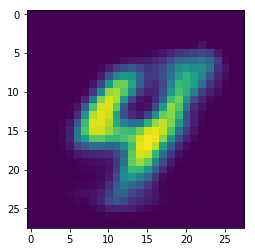

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  3



  0%|          | 1/214 [00:02<07:44,  2.18s/it]

[0 9 2 9 2 9 6 9 3 7 5 4 7 3 1 2 6 2 3 1 2 0 9 5 8 1 2 1 2 4 4 8 1 2 4 4 2
 5 5 8 3 3 5 0 2 4 1 0 0 8 4 9 8 4 0 6 5 2 1 3 7 4 2 7 7 6 8 1 5 4 6 8 3 1
 0 6 6 2 7 1 5 2 8 2 0 8 2 4 3 7 6 3 5 3 1 3 8 2 8 7 9 3 2 0 6 5 7 9 8 6 5
 0 6 5 1 1 3 0 2 7 7 4 9 2 2 6 6 1 7 4 8 1 9 8 1 1 2 2 1 3 7 0 1 0 8 5 4 8
 2 2 1 2 9 8 3 5 1 7 3 0 7 0 6 7 4 6 2 3 7 2 9 1 9 7 4 2 6 2 9 7 0 8 7 2 7
 6 8 2 2 1 7 3 1 6 6 6 1 7 3 1 1 8 1 0 4 5 0 2 2 7 8 3 8 0 4 0 4 7 1 2 2 9
 9 9 1 9 1 8 0 3 0 1 2 0 2 1 1 0 5 1 0 3 6 1 0 2 4 4 3 4 5 1 1 9 1 3]
[0 9 2 9 2 9 0 9 3 7 5 4 7 3 1 2 6 2 3 1 2 0 9 5 8 1 2 1 2 4 4 8 1 2 4 4 2
 5 5 8 3 3 5 0 2 4 1 0 0 8 4 9 8 4 0 6 5 2 1 3 7 4 2 7 7 6 8 1 5 4 6 8 3 1
 0 6 6 2 7 1 5 2 8 2 0 8 2 4 3 7 6 3 5 3 1 3 8 2 8 7 9 3 2 0 6 5 7 9 8 6 5
 0 6 5 1 1 3 0 2 7 7 4 9 2 2 6 6 1 7 4 8 1 4 8 1 1 2 2 1 3 7 0 1 0 8 5 4 8
 2 2 1 2 9 8 3 5 1 7 3 0 7 0 6 7 4 6 2 3 7 2 9 1 9 7 4 2 6 2 9 7 0 8 7 2 7
 6 8 2 2 1 7 3 1 6 6 6 1 7 3 1 1 8 1 0 4 5 0 2 2 7 8 3 8 0 4 0 4 7 1 2 2 9
 9 9 1 9 1 8 0 3 0 1 2 0 2 1 1


  1%|          | 2/214 [00:04<07:29,  2.12s/it]

[1 9 8 2 7 9 2 8 9 4 3 8 7 2 6 3 2 8 5 9 2 7 8 7 4 5 0 9 6 6 3 4 2 4 0 8 0
 9 4 4 5 1 8 0 4 2 1 1 4 1 4 2 5 2 1 3 7 4 6 4 4 4 9 3 4 7 2 7 1 7 9 4 6 6
 2 3 2 4 8 2 8 8 6 3 1 9 8 1 3 9 2 1 6 2 0 8 1 9 2 0 2 1 4 3 8 1 8 1 4 2 1
 6 7 5 0 2 5 3 1 2 4 9 4 9 7 0 7 4 7 0 5 1 8 4 4 8 0 2 7 9 6 5 7 8 2 5 1 7
 2 2 1 4 7 3 6 3 7 4 0 5 9 7 8 8 9 8 3 4 7 5 3 2 9 2 7 8 9 8 1 2 3 1 0 2 4
 9 4 1 6 7 7 5 2 3 3 9 3 9 9 0 8 8 5 6 3 4 0 1 9 9 8 3 8 8 4 2 5 4 9 2 2 2
 8 7 4 5 6 6 8 7 6 7 9 6 6 7 7 8 1 5 8 3 7 0 0 0 9 6 4 1 9 0 8 0 2 2]
[1 9 8 2 7 9 2 8 9 4 3 8 7 2 6 3 2 8 5 9 2 7 8 7 4 5 0 9 6 6 3 4 2 4 0 8 0
 9 4 4 5 1 8 0 4 2 1 1 4 1 4 2 5 2 1 3 7 4 6 4 4 4 9 3 4 7 2 7 1 3 9 4 6 6
 2 3 2 4 8 2 8 8 6 3 1 9 8 1 3 9 2 1 6 2 0 8 1 9 2 0 2 1 4 3 8 1 8 1 4 2 1
 6 7 5 0 2 5 3 1 2 4 9 4 9 7 0 7 4 7 0 5 1 8 4 4 8 0 2 7 9 6 5 7 8 2 5 1 7
 2 2 1 4 7 3 6 3 7 4 0 5 9 7 8 8 9 8 3 4 7 5 3 2 9 2 7 8 9 8 1 2 3 1 0 2 4
 9 4 1 6 7 7 5 2 3 3 9 3 9 9 0 8 8 5 6 3 4 0 1 9 9 8 3 8 8 4 2 5 4 9 2 2 2
 8 7 4 5 6 6 8 7 6 7 9 6 6 7 7


  1%|▏         | 3/214 [00:06<07:31,  2.14s/it]

[0 8 9 3 6 9 7 0 0 3 2 9 3 9 7 5 7 4 8 6 4 0 6 3 0 4 7 9 0 4 6 6 2 8 3 1 3
 4 9 2 1 8 2 6 0 0 7 0 4 0 8 0 4 3 3 5 7 8 3 0 1 1 7 1 7 6 5 0 9 4 3 3 0 3
 0 3 7 9 1 1 6 7 7 0 8 0 1 1 4 2 3 4 0 7 1 3 1 2 7 7 8 7 0 0 3 4 1 9 0 6 7
 2 5 7 9 8 3 8 7 4 4 0 9 1 3 5 5 6 4 9 3 1 8 3 8 6 4 1 3 6 6 6 1 0 6 6 9 5
 1 7 7 1 3 5 3 3 2 0 1 1 0 5 4 7 1 6 9 8 6 4 5 5 7 3 3 0 2 7 6 1 0 9 9 7 3
 3 9 6 2 2 6 7 8 4 1 9 7 9 7 3 2 8 8 6 7 1 9 6 8 6 4 7 4 1 6 5 6 4 7 6 5 8
 2 4 4 2 6 5 0 8 8 3 3 0 7 3 7 1 5 7 7 2 8 4 3 7 6 1 4 0 0 4 9 0 1 9]
[0 8 9 3 6 9 7 0 0 3 2 9 3 9 7 5 7 4 8 6 4 0 6 3 0 4 7 9 0 4 6 6 2 8 3 1 3
 4 9 2 1 8 2 6 0 0 7 0 4 0 8 0 4 3 3 5 7 8 3 0 1 1 7 1 7 6 5 0 9 4 3 3 0 3
 0 3 7 9 1 1 6 7 7 0 8 0 1 1 4 2 3 4 0 7 1 3 1 2 7 7 8 7 0 0 3 4 1 9 0 6 7
 2 5 7 9 8 3 8 7 4 4 0 9 1 3 5 5 6 4 9 3 1 8 3 8 6 4 1 3 6 6 6 1 0 6 6 9 5
 1 7 7 1 3 5 3 3 2 0 1 1 0 5 4 7 1 6 9 8 6 4 5 5 7 3 3 0 2 7 6 1 0 9 9 7 3
 3 9 6 2 2 6 7 8 4 1 9 7 9 7 3 2 8 8 6 7 1 9 6 8 6 4 7 4 1 6 5 6 4 7 6 5 8
 2 4 4 2 6 5 0 8 8 3 3 0 7 3 7


  2%|▏         | 4/214 [00:08<07:34,  2.16s/it]

[8 0 2 0 7 5 7 3 6 9 0 1 7 3 9 1 0 7 0 0 3 1 4 2 7 3 6 3 6 1 7 7 1 0 5 9 9
 5 4 0 3 6 0 7 0 4 9 0 1 8 7 7 8 8 9 9 4 5 1 1 7 3 9 3 9 1 2 8 2 9 7 2 1 3
 3 7 3 0 5 9 5 6 5 3 8 6 4 7 5 9 8 7 2 7 3 5 2 3 5 0 3 2 3 7 7 2 9 5 5 9 8
 9 0 6 7 8 8 6 2 7 0 1 4 4 2 7 8 8 0 1 1 9 0 7 6 4 3 1 3 0 4 9 9 1 9 5 6 0
 8 1 1 2 4 6 9 2 5 2 0 1 9 0 5 8 5 7 1 1 2 3 0 2 9 2 1 3 0 8 8 5 1 2 1 1 3
 0 9 4 2 2 6 8 6 7 9 7 1 6 2 8 6 4 0 7 7 9 6 1 2 4 4 9 2 5 5 6 9 4 6 2 9 9
 1 3 4 9 9 1 1 1 8 8 5 3 6 7 5 1 1 1 2 5 8 4 1 6 0 6 3 7 2 7 2 6 0 0]
[8 0 2 0 7 5 7 3 6 9 0 1 7 3 9 1 0 7 0 0 3 1 4 2 7 3 6 3 6 1 7 7 1 0 5 9 9
 5 4 0 3 6 0 7 0 4 9 0 1 8 7 7 8 8 9 9 4 5 1 1 7 3 9 3 9 1 2 8 2 9 7 2 1 3
 3 7 3 0 5 9 5 6 5 3 8 6 4 7 9 9 8 7 2 7 3 5 2 3 5 0 3 2 3 7 7 2 9 5 5 9 8
 9 0 6 7 8 8 6 2 7 0 1 9 4 2 7 8 8 0 1 1 9 0 7 6 4 3 1 3 0 4 9 9 1 9 5 5 0
 8 1 1 2 4 6 9 2 5 2 0 1 9 0 5 8 5 7 1 1 2 3 0 2 9 2 1 3 0 8 8 5 1 2 1 1 3
 0 9 4 2 2 6 8 6 7 9 7 1 6 2 8 6 4 0 7 7 9 6 1 2 4 4 9 2 5 5 6 9 4 6 2 9 9
 1 3 4 9 9 1 1 1 8 8 5 3 6 7 5


  2%|▏         | 5/214 [00:10<07:35,  2.18s/it]

[9 8 7 0 4 0 1 8 0 0 8 6 5 9 7 9 8 3 9 2 4 1 5 2 0 2 6 2 3 6 0 9 4 0 2 4 3
 2 3 7 6 4 6 2 6 0 7 3 7 6 1 4 0 0 9 3 2 0 4 7 8 6 3 0 8 7 8 7 7 3 7 3 4 6
 2 2 1 1 8 4 4 9 9 5 2 0 7 8 7 3 5 0 8 5 5 3 1 2 9 9 3 1 0 1 1 8 4 7 3 0 5
 2 0 3 5 0 8 5 5 4 9 6 2 3 7 6 1 8 0 9 5 7 6 9 1 3 5 3 2 2 8 6 8 2 8 8 9 3
 7 7 7 5 6 0 3 5 9 3 5 0 9 7 3 2 9 4 9 3 0 1 6 3 3 7 7 1 9 6 4 4 2 5 8 2 1
 1 1 0 1 1 6 5 8 8 7 5 8 2 4 2 0 4 2 3 8 2 2 9 7 2 4 3 0 8 8 8 0 0 0 2 8 7
 8 7 6 7 8 5 0 8 6 2 1 5 5 4 2 8 4 3 3 1 4 3 4 6 6 4 9 6 7 4 6 6 5 6]
[9 8 7 0 4 0 1 8 0 0 8 6 5 9 7 9 8 3 9 2 4 1 5 2 0 2 6 2 3 6 0 9 4 0 2 4 3
 2 3 7 6 4 6 2 6 0 7 3 7 6 1 4 0 0 9 3 2 0 4 7 8 6 3 0 8 7 8 7 7 3 7 3 4 6
 2 2 1 1 8 4 4 9 9 5 2 0 7 8 7 3 5 0 8 5 5 3 1 2 9 9 3 1 0 1 1 8 4 7 3 0 5
 2 0 3 5 0 8 5 5 4 9 6 2 3 7 6 1 8 0 9 5 7 6 9 1 3 5 3 2 2 8 6 8 2 8 8 9 3
 7 7 7 5 6 0 3 5 9 3 5 0 9 7 3 2 9 4 9 3 0 1 6 3 3 7 7 1 9 6 4 4 2 5 8 2 1
 1 1 0 1 1 6 5 8 8 7 5 8 2 4 2 0 4 2 3 8 2 2 9 7 2 4 3 0 8 8 8 0 0 0 2 8 7
 8 7 6 7 8 5 0 8 6 2 1 5 5 4 2


  3%|▎         | 6/214 [00:13<07:33,  2.18s/it]

[8 8 4 5 7 3 1 0 8 5 9 0 2 9 2 4 4 2 7 3 3 2 6 0 8 3 9 7 6 7 6 1 4 5 8 3 9
 4 1 8 0 9 1 6 1 5 4 2 0 6 1 3 7 6 5 1 4 9 1 5 8 6 1 7 3 6 1 6 8 4 4 3 3 4
 9 5 0 3 0 4 6 2 8 6 2 1 8 2 0 6 0 3 0 5 8 2 4 7 6 2 3 2 7 2 7 9 1 9 3 9 1
 4 5 8 6 7 6 9 3 8 1 6 6 1 5 5 6 0 3 8 3 6 4 8 0 9 4 9 6 0 3 6 1 9 2 0 1 3
 5 6 1 4 0 2 7 1 1 9 9 7 4 3 6 9 8 0 1 2 1 7 5 2 1 9 6 9 1 3 2 8 2 8 7 7 6
 0 6 8 7 5 6 5 9 5 1 6 9 1 7 1 9 0 8 4 7 0 4 7 4 4 0 4 5 9 7 4 1 5 4 0 9 6
 6 4 7 0 5 7 0 7 3 5 9 6 2 9 1 1 1 8 4 1 9 3 5 2 8 5 1 1 6 8 2 2 2 7]
[8 8 4 5 7 3 1 0 8 5 9 0 2 9 2 4 4 2 7 3 3 2 6 0 8 3 9 7 6 7 6 1 4 5 8 3 9
 4 1 8 0 9 1 6 1 5 4 2 0 4 1 3 7 6 5 1 4 3 1 5 8 6 1 7 3 6 1 6 8 4 4 3 3 4
 9 5 0 3 0 4 4 2 8 6 2 1 8 2 0 6 0 3 0 5 8 2 4 7 6 2 3 2 7 2 7 9 1 9 3 9 1
 4 5 8 6 7 6 9 3 8 1 6 6 1 5 5 6 0 3 8 3 6 4 8 0 9 4 9 6 0 3 6 1 9 2 0 1 3
 5 6 1 4 0 2 7 1 1 9 9 7 4 3 6 9 8 0 1 2 1 7 5 2 1 9 6 9 1 3 1 8 2 8 7 7 6
 0 6 8 7 5 6 5 9 5 1 6 9 1 7 1 9 0 8 4 7 0 4 7 4 4 0 4 5 9 7 4 1 5 4 0 9 6
 6 4 7 0 5 7 0 7 3 5 9 6 2 9 1


  3%|▎         | 7/214 [00:15<07:28,  2.17s/it]

[9 4 9 6 7 8 9 6 0 9 1 7 2 4 4 7 8 9 5 3 3 8 5 9 7 3 8 9 2 3 0 1 2 1 8 7 8
 8 5 3 9 0 6 2 6 3 2 1 7 2 8 7 5 6 3 8 2 1 0 9 9 4 7 7 5 6 2 8 1 9 2 7 4 0
 0 9 1 2 0 0 1 5 3 4 2 9 1 6 0 5 2 3 0 2 2 1 1 3 5 8 8 1 6 4 2 4 9 9 7 6 1
 5 8 4 6 5 9 4 7 8 5 3 1 0 3 6 3 4 2 9 0 6 2 0 2 9 9 7 6 7 2 8 1 3 8 2 1 5
 4 6 2 0 8 5 4 8 0 7 6 7 9 1 5 8 1 5 4 9 3 9 5 5 3 5 9 0 7 9 1 8 0 9 4 9 5
 4 1 3 9 2 6 4 0 4 7 5 8 0 6 1 1 6 1 7 3 1 5 6 1 9 9 2 5 3 5 2 3 4 3 2 6 8
 5 9 2 9 1 2 4 8 6 4 8 2 7 5 6 9 8 8 4 3 9 8 8 9 6 1 6 7 9 8 6 3 0 7]
[9 4 9 6 7 8 9 6 0 9 1 7 2 4 4 7 8 9 5 3 3 8 5 9 7 3 8 9 2 3 0 1 2 1 8 7 8
 8 5 3 9 0 6 2 6 3 2 1 7 2 8 7 5 6 3 8 2 1 0 9 9 4 7 7 5 6 3 8 1 9 2 7 4 0
 0 9 1 2 0 0 1 5 3 4 2 9 1 6 0 5 2 3 0 2 2 1 1 3 5 8 8 1 6 4 2 4 9 9 7 6 1
 5 8 4 6 5 9 4 7 8 5 3 1 0 3 6 3 4 2 9 0 6 2 0 2 9 9 7 6 7 2 8 1 3 8 2 1 5
 4 6 2 0 8 5 4 8 0 7 6 7 9 1 5 8 1 5 4 9 3 9 5 5 3 3 9 0 7 9 1 8 0 9 4 9 5
 4 1 3 9 2 6 4 0 4 7 5 8 0 6 1 1 6 1 7 3 1 5 6 1 9 9 2 5 3 5 2 3 4 3 2 6 8
 5 9 2 9 1 2 4 8 6 4 8 2 7 5 6


  4%|▎         | 8/214 [00:17<07:26,  2.17s/it]

[4 5 9 4 2 7 5 1 9 5 3 1 6 8 7 8 5 9 6 6 9 4 5 9 3 8 9 3 1 6 9 8 6 1 5 9 7
 8 8 9 6 0 3 5 7 0 8 7 5 9 2 3 2 6 5 2 1 0 0 7 1 3 2 7 3 1 3 5 0 4 4 9 6 4
 3 2 7 8 7 3 5 8 8 6 5 2 3 5 7 5 7 9 3 2 2 8 9 7 4 1 2 9 0 8 1 1 9 2 5 9 6
 1 4 6 8 6 1 3 5 5 3 3 5 0 2 2 5 1 7 7 0 9 0 4 2 7 6 6 7 5 4 6 0 5 2 6 9 7
 2 7 2 8 3 8 7 3 9 5 1 7 4 0 0 9 1 1 2 7 7 1 2 6 7 6 9 3 7 6 0 0 0 1 2 9 0
 1 2 5 7 3 6 4 7 9 0 8 0 5 2 5 5 8 5 7 3 2 8 2 6 5 8 4 7 5 0 4 9 9 2 5 5 3
 6 4 1 4 3 8 9 4 0 7 8 5 2 2 8 8 1 2 2 6 6 1 1 2 2 2 7 1 8 1 0 8 5 5]
[4 5 9 4 2 7 5 1 9 5 3 1 6 8 7 8 5 9 6 6 9 4 5 9 3 8 9 3 1 6 9 8 6 1 5 9 7
 8 8 9 6 0 3 5 7 0 8 7 5 9 2 3 2 6 5 2 1 0 0 7 1 3 2 7 3 1 3 5 0 4 4 9 6 4
 3 2 7 8 7 3 5 8 8 6 5 2 3 5 7 5 7 9 3 2 2 8 9 7 4 1 2 4 0 8 1 1 4 2 5 9 6
 1 4 6 8 6 1 3 5 5 3 3 5 0 2 2 5 1 7 7 0 9 0 4 2 7 6 6 7 5 4 6 0 5 2 6 9 9
 2 7 2 8 0 8 7 3 9 5 1 7 4 0 0 9 1 1 2 7 7 1 2 6 7 6 9 3 7 6 0 0 0 1 2 9 0
 1 2 5 7 3 6 4 7 9 0 8 0 5 2 5 5 8 5 7 3 2 8 2 6 5 8 4 7 5 0 4 9 9 2 5 5 3
 6 4 1 4 3 8 5 4 0 7 8 5 2 2 8


  4%|▍         | 9/214 [00:19<07:25,  2.17s/it]

[2 9 0 3 5 2 5 8 0 6 8 7 0 9 4 8 7 3 3 7 8 8 8 9 6 5 9 0 3 1 4 8 5 9 6 1 8
 2 7 2 6 5 6 1 5 3 0 6 6 3 4 2 7 4 3 4 2 2 3 4 6 0 1 1 1 5 4 6 3 6 6 9 2 2
 6 6 6 1 1 0 7 9 6 1 7 1 3 2 5 6 6 9 5 0 6 5 7 0 8 7 2 1 1 8 5 9 2 4 8 7 2
 5 4 5 7 0 1 4 0 0 3 5 7 7 9 1 7 9 0 0 0 6 5 4 7 3 5 3 0 8 4 1 6 1 4 8 9 9
 4 2 5 5 9 1 3 8 3 7 1 8 4 2 2 5 2 5 9 1 3 0 7 7 5 6 0 8 4 4 7 2 0 6 1 9 4
 8 1 0 2 9 6 4 9 9 7 9 6 2 8 1 5 8 4 9 5 8 9 2 7 1 6 6 2 1 7 7 1 3 6 4 3 6
 9 2 5 3 7 7 7 3 7 3 5 5 5 0 5 8 6 5 1 6 6 7 0 5 9 4 6 6 0 6 0 6 4 5]
[2 9 0 3 5 2 5 8 0 6 8 7 0 9 4 8 7 3 3 7 8 8 8 9 6 5 9 9 3 1 9 8 5 9 6 1 8
 2 7 2 6 5 6 1 5 3 0 6 6 3 4 2 7 4 3 4 2 2 3 4 6 0 1 1 1 5 4 6 3 6 6 9 2 2
 6 6 6 1 1 0 7 9 6 1 7 1 3 2 5 6 6 9 5 0 6 5 7 0 8 7 1 1 1 8 5 9 2 4 8 7 2
 5 4 5 7 0 1 4 0 0 3 5 7 7 9 1 7 9 0 0 0 6 5 4 7 3 5 3 0 8 4 1 6 1 4 8 9 9
 4 2 5 5 9 1 3 8 3 7 1 8 4 2 2 5 2 5 9 1 3 0 7 7 5 6 0 8 4 4 7 2 0 6 1 4 4
 8 1 0 2 9 6 4 9 9 7 9 6 2 8 1 5 8 4 9 5 8 9 2 7 1 6 6 2 1 7 7 1 3 6 4 3 6
 9 2 5 3 7 7 7 3 7 3 5 5 5 0 5


  5%|▍         | 10/214 [00:21<07:23,  2.18s/it]

[0 4 0 1 0 5 0 1 3 2 4 8 6 2 1 8 0 9 1 8 9 4 6 6 5 4 0 8 1 8 1 4 4 9 6 4 0
 7 1 0 9 7 6 3 2 5 1 5 3 9 9 0 3 5 8 2 7 2 2 3 3 7 1 4 6 3 7 0 1 7 0 0 9 2
 9 3 8 7 1 3 2 4 5 5 8 2 5 2 3 2 0 0 2 7 9 2 1 8 1 8 6 3 9 2 2 1 2 3 0 6 6
 8 0 7 8 8 8 1 5 4 8 2 0 4 4 3 6 8 8 7 6 9 9 4 2 8 1 6 9 2 9 5 3 3 9 6 8 1
 0 5 2 0 4 2 5 5 7 8 1 3 6 0 2 5 1 9 9 7 5 3 8 7 9 9 1 4 1 1 6 8 9 5 9 1 3
 6 7 0 1 2 3 9 0 2 9 5 7 6 6 4 8 1 9 7 1 3 5 9 7 8 4 4 8 5 6 1 8 0 8 0 3 6
 4 5 2 2 1 3 9 2 2 3 7 5 0 9 2 2 1 7 4 7 3 7 4 3 2 1 9 3 1 2 1 2 5 5]
[0 4 0 1 0 5 0 1 3 2 4 8 6 2 1 8 0 9 1 8 9 4 6 6 5 4 0 8 1 8 1 4 4 9 6 4 0
 7 1 0 9 7 6 3 2 5 1 5 3 9 9 0 3 5 8 2 7 2 2 3 3 7 1 4 6 3 7 0 1 7 0 0 9 2
 9 3 8 7 1 3 2 4 5 5 8 2 5 2 3 2 0 0 2 7 9 2 1 8 1 8 6 3 9 2 2 1 2 3 0 6 6
 8 0 7 8 8 8 1 5 4 8 2 0 4 4 3 6 8 8 7 6 9 9 4 2 8 1 6 9 2 9 5 3 3 9 6 8 1
 0 5 2 0 4 2 5 5 7 8 1 3 6 0 2 5 1 9 9 7 5 3 8 7 9 9 2 4 1 1 6 8 9 5 9 1 3
 6 7 0 1 2 3 9 0 2 9 5 7 6 6 4 8 1 9 7 1 3 5 9 7 8 4 4 8 5 6 1 8 0 8 0 3 6
 4 5 2 2 1 3 9 2 2 3 7 5 0 9 2


  5%|▌         | 11/214 [00:24<07:23,  2.18s/it]

[8 7 7 9 8 2 8 5 0 2 4 0 2 8 7 5 1 7 4 3 6 8 8 6 5 6 8 5 8 2 9 4 2 4 6 6 0
 7 0 3 9 0 8 1 1 2 8 4 9 9 2 1 3 0 4 6 4 1 8 1 6 2 3 5 3 6 9 0 6 1 0 5 0 9
 5 3 9 4 8 0 6 7 6 3 0 7 2 4 5 9 3 4 1 4 1 5 1 5 9 7 1 6 8 8 7 3 1 0 6 5 7
 2 2 5 8 1 7 9 0 8 6 1 9 8 5 4 3 8 5 1 9 4 7 9 7 4 9 3 1 4 5 0 9 9 1 3 8 6
 2 1 8 8 3 9 4 0 7 0 0 2 2 3 0 1 2 5 6 5 8 1 1 0 8 8 2 5 2 2 1 9 4 1 8 6 6
 4 9 5 1 0 0 5 2 7 4 3 7 9 5 3 4 1 4 6 8 3 9 3 6 9 4 4 0 9 2 2 5 0 4 2 9 7
 5 2 7 2 2 7 1 5 8 6 4 3 5 2 7 8 7 4 9 7 5 2 5 7 7 5 2 8 3 2 2 9 9 8]
[8 9 7 9 8 2 8 5 0 2 4 0 2 8 7 5 1 7 4 3 6 8 8 6 5 6 8 5 8 2 9 4 2 4 6 6 0
 7 0 3 9 0 8 1 1 2 8 4 9 9 2 1 3 0 4 6 4 1 8 1 6 3 3 5 3 6 9 0 6 1 0 5 0 9
 5 3 9 4 8 0 6 7 6 3 0 7 2 4 5 9 3 4 1 4 1 5 1 5 9 7 1 6 8 8 7 3 1 0 6 5 7
 2 2 5 8 1 7 9 0 8 6 1 9 8 5 4 3 8 5 1 9 4 7 9 7 4 9 3 1 4 5 0 9 9 1 3 8 6
 2 1 8 8 3 9 4 0 7 0 0 2 2 3 0 1 2 5 6 5 8 1 1 0 8 8 2 5 2 2 1 9 4 1 8 6 6
 4 9 5 1 0 0 5 2 7 4 3 7 9 5 3 4 1 4 6 8 3 9 3 6 9 4 4 0 9 2 2 5 0 4 2 9 7
 5 2 7 2 2 7 1 5 8 6 4 3 5 2 7


  6%|▌         | 12/214 [00:26<07:24,  2.20s/it]

[7 0 1 3 5 3 7 2 3 5 5 6 9 1 6 1 7 7 8 4 3 7 5 5 1 3 0 0 2 7 0 2 1 0 6 0 0
 6 5 5 6 5 0 4 8 4 7 6 8 5 8 3 1 1 6 2 9 6 0 2 0 8 7 7 0 9 7 0 9 3 2 2 4 9
 7 8 1 7 4 3 7 1 3 0 2 6 5 3 1 6 9 9 0 4 2 1 2 7 1 9 6 5 2 2 2 9 7 2 4 2 8
 0 3 6 3 0 2 6 4 8 2 0 6 2 4 7 2 3 8 6 5 3 3 7 1 6 3 2 9 7 4 8 3 0 4 2 2 3
 9 3 6 9 4 5 4 1 3 8 7 7 6 6 5 2 6 6 1 1 3 5 9 0 4 7 3 1 2 9 9 1 1 6 0 8 1
 1 0 9 9 6 8 2 4 1 3 4 6 9 6 1 4 1 4 6 3 1 1 1 4 1 7 0 1 5 4 1 4 6 6 0 1 8
 3 9 2 6 5 4 7 0 4 3 3 2 1 5 6 7 0 1 5 9 0 4 2 8 1 1 2 0 2 5 7 2 9 0]
[7 0 1 3 5 3 7 2 3 5 5 6 9 1 6 1 7 7 8 4 3 7 5 5 1 3 0 0 2 7 0 2 1 0 6 0 0
 6 5 5 6 5 0 4 8 4 7 6 8 5 8 3 1 1 6 2 9 6 0 2 0 8 7 7 0 9 7 0 9 3 2 2 4 9
 7 8 1 7 4 3 7 1 3 0 2 6 5 3 1 6 9 9 0 4 2 1 2 7 1 9 6 5 2 2 2 9 7 2 9 2 8
 0 3 6 3 0 2 6 4 8 2 0 6 2 4 7 2 3 8 6 5 3 3 7 1 6 3 2 9 7 4 8 3 0 4 2 2 3
 9 3 6 9 4 5 4 1 3 8 7 7 6 6 5 2 6 6 1 1 3 5 9 0 4 7 3 1 2 9 9 1 1 6 0 8 1
 1 0 9 9 6 8 2 4 1 3 4 6 9 6 1 4 1 4 6 3 1 1 7 4 1 7 0 1 5 4 1 4 6 6 0 1 8
 3 9 2 6 5 4 7 0 4 3 3 2 1 5 6


  6%|▌         | 13/214 [00:28<07:23,  2.21s/it]

[9 3 1 1 3 2 9 2 9 5 5 5 7 7 4 1 2 7 0 8 0 4 6 9 8 3 8 1 1 1 3 9 5 8 3 6 7
 5 3 5 9 0 5 1 7 7 9 1 9 9 4 3 4 8 6 6 1 1 8 7 8 5 9 7 1 7 7 7 1 1 0 4 4 5
 2 5 2 7 1 2 1 6 2 2 7 6 4 6 5 3 5 2 4 8 4 8 4 6 9 4 1 0 9 7 3 2 7 6 2 9 9
 3 9 0 6 0 8 0 4 6 6 3 6 3 2 8 3 6 6 3 8 8 4 3 4 9 0 7 4 9 5 1 9 4 8 5 7 7
 2 6 7 9 1 9 9 9 0 4 8 1 6 6 1 6 8 3 7 6 1 2 1 0 1 9 1 5 9 8 2 9 5 2 5 1 8
 0 6 2 5 1 9 5 7 4 2 1 0 9 5 8 9 4 0 9 1 1 0 8 6 0 7 9 3 4 0 8 9 5 5 1 5 2
 2 3 9 7 7 1 8 9 7 0 4 6 0 8 1 7 8 6 8 9 5 2 6 3 8 2 3 3 8 8 9 2 9 7]
[9 3 1 1 3 2 9 2 9 5 5 5 7 7 4 1 2 7 0 8 0 4 6 9 8 3 8 1 1 1 3 9 5 8 3 6 7
 5 3 5 9 0 5 1 7 7 9 1 9 9 4 3 4 8 6 6 1 1 8 7 8 5 9 7 1 7 7 7 1 1 0 4 4 5
 2 5 2 7 1 2 1 6 2 2 7 6 4 6 5 3 5 2 4 8 4 8 4 6 9 4 1 2 9 7 3 2 7 6 2 9 9
 3 9 0 6 0 8 0 4 6 6 3 6 3 2 8 3 6 6 3 8 8 4 3 4 9 0 7 4 9 5 1 9 4 8 5 7 7
 7 6 7 9 1 9 9 9 0 4 8 1 6 6 1 6 8 3 7 6 1 2 1 0 1 9 1 5 9 8 2 9 5 2 5 1 8
 0 6 2 5 1 9 5 7 4 2 1 0 9 5 8 9 4 0 9 1 1 0 8 6 0 7 4 3 4 0 8 9 5 5 1 5 2
 2 3 9 7 7 1 8 9 7 0 4 6 0 8 1


  7%|▋         | 14/214 [00:30<07:20,  2.20s/it]

[2 5 1 1 7 6 8 0 4 7 8 5 6 2 8 3 4 6 8 5 3 6 7 7 2 9 0 6 8 6 8 4 8 2 8 7 9
 7 6 8 2 1 1 5 5 9 6 8 9 9 0 5 2 3 8 0 2 5 7 7 3 4 3 8 8 6 8 2 2 4 5 0 0 5
 4 5 7 1 0 3 9 3 6 9 2 6 1 1 1 6 0 0 4 2 7 9 8 9 2 8 4 6 7 4 7 0 9 7 9 1 5
 4 8 2 0 8 1 2 0 7 4 4 1 2 3 8 5 4 4 7 9 4 0 7 6 4 7 6 4 0 6 2 1 5 2 4 0 1
 2 8 7 7 0 3 5 6 3 2 6 8 8 2 4 2 1 6 5 8 5 9 2 3 7 6 2 6 4 1 1 0 4 9 9 5 0
 5 6 0 5 9 9 1 5 3 3 3 1 4 2 8 7 0 1 3 0 3 9 1 3 3 5 7 6 9 7 1 2 6 7 3 6 7
 5 9 1 5 9 4 1 3 2 9 9 1 6 1 9 3 1 6 6 7 8 7 9 5 7 8 2 4 2 1 9 1 4 6]
[2 5 1 1 7 6 8 0 4 7 8 5 6 2 8 3 4 6 8 5 3 6 7 7 2 9 0 6 8 6 8 4 8 2 8 7 9
 7 6 8 2 1 1 5 5 9 6 8 9 9 0 5 2 3 8 0 2 5 7 7 3 4 3 8 8 6 8 2 2 4 5 0 0 5
 4 5 7 1 0 3 9 3 6 9 2 6 1 1 1 6 0 0 4 2 7 9 8 9 2 8 4 6 7 4 7 0 9 7 9 1 5
 4 8 2 0 8 1 2 0 7 4 4 1 8 3 8 5 4 4 7 9 4 0 7 6 4 7 6 4 0 6 2 1 5 2 4 0 1
 2 8 7 7 0 3 5 6 3 2 6 8 8 2 4 2 1 6 5 8 5 9 2 3 7 6 2 6 4 1 1 0 4 9 4 5 0
 5 6 0 5 9 9 1 5 3 3 3 1 4 2 8 7 0 1 3 0 3 9 1 3 3 5 7 6 9 7 1 2 6 7 3 6 7
 5 9 1 5 9 4 1 3 2 9 9 1 6 1 9


  7%|▋         | 15/214 [00:33<07:17,  2.20s/it]

[3 7 5 7 1 5 4 5 6 0 0 3 3 7 1 1 3 1 3 5 0 7 7 0 3 4 2 8 8 1 2 6 8 4 8 9 2
 1 7 3 6 7 4 4 1 8 1 2 6 7 0 7 0 1 8 3 3 0 7 1 8 7 7 3 9 3 0 5 9 3 4 7 5 9
 4 0 8 1 1 0 3 1 5 0 1 3 7 8 6 3 6 9 2 7 1 5 8 7 5 0 4 9 6 1 9 0 8 6 7 6 2
 4 6 6 3 1 5 7 8 1 8 5 7 3 3 1 8 4 6 1 1 5 5 7 7 9 3 8 9 6 3 5 4 6 7 0 7 5
 9 0 1 4 6 5 4 2 6 9 6 4 8 8 9 9 0 5 3 1 4 5 4 5 4 1 0 5 2 3 1 4 0 5 8 0 5
 6 5 4 8 0 1 6 2 2 0 4 8 0 8 0 7 8 1 0 0 0 0 3 3 3 3 0 2 0 8 1 4 2 2 7 6 8
 9 4 7 1 4 5 9 2 7 9 5 6 7 5 5 4 5 7 2 9 3 0 3 2 7 6 6 0 9 6 7 5 6 0]
[3 7 5 7 1 5 4 5 6 0 0 3 3 7 1 1 3 1 3 5 0 7 7 0 3 4 2 8 8 1 2 6 8 4 8 9 2
 1 7 3 6 7 4 4 1 8 1 2 6 7 0 7 0 1 8 3 3 0 7 1 8 7 7 3 9 3 0 5 9 3 4 7 5 9
 4 0 8 1 1 0 3 1 5 0 1 3 7 8 6 3 6 9 2 7 1 5 8 7 5 0 4 9 6 1 9 0 8 6 7 6 2
 4 6 6 3 1 5 7 8 1 8 5 7 3 3 1 8 4 6 1 1 5 5 7 7 9 3 8 9 6 3 5 4 6 7 0 7 5
 9 0 1 4 6 5 4 2 6 9 6 4 8 8 9 9 0 5 3 1 4 5 4 5 4 1 0 5 2 3 1 4 0 5 8 0 5
 6 5 4 8 0 1 6 2 2 0 4 8 0 8 0 7 8 1 0 0 0 0 3 3 3 3 0 2 0 8 1 4 2 2 7 6 8
 9 4 7 1 4 5 9 2 7 9 5 6 7 5 5


  7%|▋         | 16/214 [00:35<07:15,  2.20s/it]

[9 6 3 2 0 4 3 5 5 2 7 0 6 1 7 0 9 3 8 9 0 7 8 2 2 6 3 2 7 6 0 1 2 0 9 5 1
 2 0 8 6 2 4 5 0 8 0 6 9 9 8 7 6 9 3 1 4 4 6 3 3 7 3 1 3 0 3 7 2 1 7 1 5 1
 3 3 6 8 2 5 6 6 8 8 8 5 9 5 7 2 9 1 8 3 5 5 7 6 5 9 5 0 5 6 5 5 4 6 2 3 8
 8 9 3 9 6 1 1 1 3 1 3 0 3 4 3 9 2 6 2 4 4 4 8 8 6 1 9 1 3 9 5 1 1 4 8 8 4
 2 6 0 0 3 1 0 5 8 8 2 3 5 8 1 8 7 6 1 6 9 1 8 0 5 1 0 9 9 9 3 8 3 9 4 9 9
 0 3 0 4 5 4 6 8 7 2 4 1 3 1 0 5 1 9 2 1 7 4 0 9 9 1 9 9 4 0 1 9 8 8 4 7 3
 1 6 5 5 7 7 1 9 4 7 3 4 3 8 5 4 7 2 3 4 4 1 6 7 8 8 3 9 4 5 1 5 5 0]
[9 6 3 2 0 4 3 5 5 2 7 0 6 1 7 0 9 3 8 9 0 7 8 2 2 6 3 2 7 6 0 1 2 0 9 5 1
 2 0 8 6 2 4 5 0 8 0 6 9 9 8 7 6 9 3 1 4 4 6 3 3 4 3 1 3 0 3 7 2 1 7 1 5 1
 3 3 6 8 2 5 6 6 8 8 8 5 9 5 7 2 9 1 8 3 5 5 7 6 5 9 5 0 5 6 5 5 4 6 2 3 8
 8 9 3 9 6 1 1 1 3 1 3 0 3 4 3 9 2 6 2 4 4 4 8 8 6 1 9 1 3 9 5 1 1 4 8 8 4
 8 6 0 0 3 1 0 5 8 8 2 3 5 8 1 8 7 6 1 6 9 1 8 0 5 1 0 9 9 9 3 8 3 9 4 9 9
 0 3 0 4 5 4 6 8 7 2 4 1 3 1 0 5 1 9 2 1 7 4 0 9 9 1 9 9 4 0 1 9 8 8 4 7 3
 1 6 5 5 7 7 1 9 4 7 3 4 3 8 5


  8%|▊         | 17/214 [00:37<07:12,  2.20s/it]

[3 3 4 1 4 2 5 7 0 6 8 3 4 5 6 3 7 3 5 7 4 5 0 6 5 8 6 1 4 9 8 2 6 2 9 3 2
 8 5 2 5 3 5 8 7 3 0 2 6 6 3 0 7 5 0 3 5 6 2 0 8 0 8 2 4 6 6 4 6 2 8 3 8 4
 9 7 2 5 1 2 6 4 0 6 3 1 6 1 0 3 0 4 0 7 7 1 6 5 8 9 7 4 8 8 9 0 8 9 0 5 5
 8 2 6 8 9 1 9 8 5 4 3 0 1 9 3 9 5 4 3 7 5 1 3 4 4 0 1 2 8 1 1 9 9 2 6 1 2
 7 3 7 6 1 1 8 2 4 6 4 6 8 4 0 9 8 1 3 3 5 7 4 4 6 9 0 8 1 4 6 9 4 5 9 1 6
 2 2 8 8 2 4 2 5 4 0 8 8 6 3 1 1 8 8 3 8 4 3 2 3 0 3 4 5 5 4 2 1 6 4 9 5 5
 0 3 1 5 0 2 6 6 4 6 3 7 4 5 3 0 7 8 8 3 5 9 4 4 1 8 6 2 5 6 9 4 6 5]
[3 3 4 1 4 2 5 7 0 6 8 3 4 5 6 3 7 3 5 7 4 5 0 6 5 8 6 1 4 9 8 2 6 2 9 3 2
 8 5 2 5 3 5 8 7 3 6 2 6 6 3 0 7 5 0 3 5 6 2 0 8 0 8 2 4 6 6 4 6 2 8 3 8 4
 9 7 2 5 1 2 6 4 0 6 3 1 6 1 0 3 0 4 0 7 7 1 6 5 8 9 7 4 8 8 9 0 8 9 0 5 9
 8 2 6 8 9 1 9 8 5 4 3 0 1 9 3 9 5 4 3 7 5 1 3 4 4 0 1 2 8 1 1 9 9 2 6 1 2
 7 3 7 6 1 1 8 2 4 6 4 6 8 4 0 9 8 1 3 3 5 7 4 4 6 9 0 8 1 4 6 9 4 5 9 1 6
 2 2 8 8 2 4 2 5 4 0 8 8 6 3 1 1 8 8 3 8 4 3 2 3 0 3 4 5 5 4 2 1 6 4 9 5 5
 0 3 1 5 0 2 6 6 4 6 3 7 4 5 3


  8%|▊         | 18/214 [00:39<07:09,  2.19s/it]

[2 4 3 3 3 7 4 0 9 7 6 9 5 3 8 5 6 1 3 1 8 3 9 5 1 7 1 7 8 2 6 0 9 8 5 7 3
 5 1 2 8 9 6 9 7 4 2 8 6 7 7 3 7 6 6 2 8 4 9 2 0 8 7 6 7 7 5 0 1 8 8 4 1 9
 6 4 0 2 7 3 3 5 3 3 7 5 8 5 1 3 7 7 6 7 8 6 8 7 6 2 4 2 0 7 4 5 5 4 5 6 0
 4 2 6 6 9 1 7 2 7 3 7 0 7 8 7 2 5 4 1 1 0 5 1 7 9 0 2 0 2 0 9 9 8 2 2 9 9
 4 5 8 5 6 5 0 2 9 5 8 2 7 6 4 7 7 4 3 4 6 4 2 1 1 2 4 3 2 1 7 4 1 5 9 2 7
 3 6 8 2 5 8 1 6 1 8 5 3 1 9 4 1 2 9 7 9 2 6 7 2 1 7 8 2 6 5 9 6 0 1 1 8 8
 9 0 8 1 3 5 8 4 8 0 8 8 5 9 5 3 7 1 7 6 1 7 6 8 7 8 2 4 4 6 5 9 2 2]
[2 4 3 3 3 7 4 0 9 7 6 9 5 3 8 5 6 1 3 1 8 3 4 5 1 7 1 7 8 2 6 0 9 8 5 7 3
 5 1 2 8 9 6 9 7 4 2 8 6 7 7 3 7 6 6 2 8 4 9 2 0 8 7 6 7 7 5 0 1 8 8 4 1 9
 6 4 0 2 7 3 3 5 3 3 7 5 8 5 1 3 7 7 6 7 8 6 8 7 6 2 4 2 9 7 4 5 5 4 5 6 0
 4 2 6 6 9 1 7 2 7 3 7 0 7 8 7 2 5 4 1 1 0 5 1 7 9 0 2 0 2 0 9 9 8 2 2 9 9
 4 5 8 5 6 5 7 2 9 5 8 2 7 6 4 7 7 4 3 4 6 4 2 1 1 2 4 3 2 1 1 4 1 5 9 2 7
 3 6 8 2 5 8 1 6 1 8 5 3 1 9 4 1 2 9 7 9 2 6 7 7 1 7 8 2 6 5 9 6 0 1 1 8 8
 9 0 8 1 3 5 8 4 8 0 8 8 5 9 9


  9%|▉         | 19/214 [00:41<07:07,  2.19s/it]

[4 4 9 9 1 9 8 2 0 4 5 7 8 7 5 8 1 3 1 6 3 9 6 4 4 4 0 6 6 6 0 3 7 2 7 0 1
 1 4 2 1 1 7 7 1 2 1 9 4 2 9 9 1 3 2 9 7 1 5 3 5 4 2 0 5 9 7 8 3 0 7 5 6 1
 0 1 3 0 5 7 4 3 3 5 4 4 6 6 7 4 8 8 0 6 7 1 6 2 6 8 6 8 7 5 8 1 4 7 6 4 3
 6 1 4 4 1 3 4 4 3 6 4 8 9 6 0 6 9 0 4 3 2 2 6 2 0 2 7 3 3 9 1 9 7 0 6 2 4
 8 9 7 1 8 6 6 0 1 6 3 4 0 7 9 9 7 8 2 3 3 9 6 6 5 3 5 1 4 8 4 0 3 5 9 3 7
 7 8 3 2 6 3 5 7 5 1 0 4 7 0 4 1 5 2 5 4 9 5 3 4 5 3 0 4 8 9 8 6 1 1 3 5 2
 1 0 4 9 1 8 9 9 1 7 7 0 4 3 6 7 3 2 2 3 5 4 6 2 3 9 7 1 9 6 1 0 9 7]
[4 4 9 9 1 9 8 2 0 4 5 7 8 7 5 8 1 3 1 6 3 4 6 4 4 4 0 6 6 6 0 3 7 2 7 0 1
 1 4 2 1 1 7 7 1 2 1 9 4 2 9 9 1 3 2 9 7 1 9 3 5 4 2 0 5 9 7 8 3 0 7 5 6 1
 0 1 3 0 5 7 4 3 3 5 4 4 6 6 7 4 8 8 0 6 7 1 6 2 6 8 6 8 7 5 8 1 4 7 6 4 3
 6 1 4 4 1 3 4 4 3 6 4 8 9 6 0 6 9 0 4 3 2 2 6 2 0 2 7 3 3 9 1 9 7 0 6 2 4
 8 9 7 1 8 6 6 0 1 6 3 4 0 7 9 9 7 8 2 3 3 9 6 6 5 3 5 1 4 8 4 0 3 5 9 3 7
 7 8 3 2 6 3 5 7 5 1 0 4 7 0 4 1 5 2 5 4 9 5 3 4 5 3 0 4 8 9 8 6 1 1 3 5 2
 1 0 4 9 1 8 9 9 1 7 7 0 4 3 6


  9%|▉         | 20/214 [00:43<07:05,  2.19s/it]

[5 4 9 2 0 1 4 3 5 3 1 9 6 7 6 9 7 7 4 4 8 9 7 0 2 9 3 9 4 5 6 2 7 9 7 6 0
 1 7 5 2 2 7 2 1 1 5 6 7 0 6 4 4 6 5 8 7 6 9 1 0 1 0 1 6 4 6 7 8 8 0 0 8 8
 0 3 7 4 5 7 3 2 9 1 6 6 2 9 7 7 7 2 6 8 6 3 4 8 9 7 1 6 6 0 1 7 2 0 7 5 1
 5 0 7 0 4 7 3 2 7 6 9 1 8 3 1 8 3 5 3 6 5 7 9 5 2 3 6 0 8 4 5 0 2 1 1 0 7
 7 8 9 7 4 7 5 2 9 6 7 1 6 1 5 3 3 2 2 1 7 1 0 4 2 5 3 4 1 2 5 2 5 5 9 6 5
 1 5 0 2 3 1 6 8 5 4 6 5 0 3 5 7 6 1 2 9 0 2 2 3 2 0 8 4 8 9 2 7 9 7 4 8 2
 2 5 2 1 9 3 3 0 0 0 5 1 1 1 6 1 2 0 0 4 6 4 3 1 6 5 4 2 6 8 8 6 9 3]
[5 4 9 2 0 1 4 3 5 3 1 9 6 7 6 9 7 7 4 4 8 9 7 0 2 9 3 9 4 5 6 2 7 9 7 6 0
 1 7 5 2 2 7 2 1 1 5 6 7 0 6 4 4 6 5 8 7 6 9 1 0 1 0 1 5 4 6 7 8 8 0 0 8 8
 0 3 7 4 5 7 3 2 9 1 6 6 2 9 7 7 7 2 6 8 6 3 4 8 9 7 1 6 6 0 1 7 2 0 7 5 1
 5 0 7 0 4 7 3 2 7 6 9 1 8 3 1 8 3 5 3 6 5 7 9 5 2 3 6 0 8 4 5 0 2 1 1 0 7
 7 8 9 7 4 7 5 2 9 6 7 1 6 1 5 3 3 2 2 1 7 1 0 4 2 5 3 4 1 2 5 2 5 5 9 6 5
 1 5 0 2 3 1 6 8 5 4 6 5 0 3 5 7 6 1 2 9 0 2 2 3 2 0 8 4 8 9 2 7 9 7 4 8 2
 2 5 2 1 9 3 3 0 0 0 5 1 1 1 6


 10%|▉         | 21/214 [00:46<07:04,  2.20s/it]

[3 0 3 4 3 9 1 3 7 5 9 1 2 5 2 0 8 2 8 9 1 0 2 7 1 6 2 4 2 8 1 4 4 7 4 4 8
 1 0 8 6 1 2 8 9 2 3 7 4 3 1 4 2 0 6 4 4 4 5 3 2 3 2 0 9 5 4 9 8 0 9 8 0 4
 9 3 8 6 9 2 3 6 1 7 4 4 9 3 7 2 0 5 6 1 0 7 5 6 1 5 4 4 7 3 8 0 9 1 6 3 7
 3 8 7 1 0 0 2 6 0 7 2 2 2 6 9 5 7 5 0 6 6 5 2 4 5 3 9 5 7 6 1 9 5 1 4 5 3
 7 1 9 7 8 7 9 5 7 2 1 3 2 9 5 7 4 2 3 7 9 6 0 1 4 3 3 0 5 7 2 4 7 5 4 5 2
 3 5 6 0 1 4 8 2 5 9 5 8 6 9 0 7 5 1 1 4 6 9 3 2 4 4 4 7 2 1 7 1 5 0 4 0 3
 5 7 3 1 1 1 0 9 9 9 0 6 2 0 9 6 6 3 8 6 3 6 2 8 0 8 7 1 3 7 9 3 6 6]
[3 0 3 4 3 9 1 3 7 5 9 1 2 5 2 0 8 2 8 9 1 0 2 7 1 6 2 4 2 8 1 4 4 7 4 4 8
 1 0 8 6 1 2 8 9 2 3 7 4 3 1 4 2 0 6 4 4 4 5 3 2 3 2 0 9 5 4 9 8 0 9 8 0 4
 9 3 8 6 9 7 3 6 1 7 4 4 9 3 7 2 0 5 6 1 0 7 5 6 1 5 4 4 7 3 8 0 9 1 6 3 7
 3 8 7 1 0 0 2 6 0 7 2 2 2 6 9 5 7 5 0 6 6 5 2 4 5 3 9 5 7 6 1 9 5 1 4 5 3
 7 1 9 7 8 7 9 5 7 2 1 3 2 9 5 7 4 2 3 7 9 6 0 1 4 3 3 0 5 7 2 4 7 5 4 5 2
 3 5 6 0 1 4 8 2 5 9 5 8 6 9 0 7 5 1 1 4 6 9 3 2 4 4 4 7 2 1 7 1 5 0 4 0 3
 5 7 3 1 1 1 0 9 9 9 0 6 2 0 9


 10%|█         | 22/214 [00:48<07:03,  2.20s/it]

[7 0 2 9 3 2 7 8 4 8 2 3 2 9 2 6 9 5 8 1 3 5 4 6 8 5 4 0 7 1 1 5 1 5 0 1 8
 3 5 2 9 5 5 0 0 5 9 7 9 5 1 2 9 9 3 1 3 5 0 5 8 2 6 3 7 1 6 1 0 8 9 7 3 0
 2 4 7 5 4 2 9 2 7 9 5 4 8 6 7 8 4 9 1 6 6 4 2 7 3 0 0 6 6 7 1 0 4 6 1 1 5
 8 0 1 1 9 3 8 5 3 9 8 0 7 1 3 5 3 0 4 1 6 7 4 8 9 8 0 7 0 0 3 2 0 3 0 7 0
 3 3 3 0 9 4 5 6 0 9 2 0 2 6 4 3 2 9 7 8 2 3 2 5 0 1 4 9 5 8 0 3 5 1 1 3 2
 1 3 8 8 8 6 0 6 7 2 4 4 2 5 8 2 1 2 0 9 9 6 9 9 0 6 2 5 6 5 1 8 7 2 3 8 6
 0 2 7 8 2 1 6 8 0 9 7 2 5 0 3 5 9 7 4 7 4 5 1 2 3 1 0 5 5 7 7 9 7 0]
[7 0 2 9 3 2 7 8 4 8 2 3 2 9 2 6 9 5 8 1 3 5 4 6 8 5 4 0 7 1 1 5 1 5 0 1 8
 3 5 2 9 5 5 0 0 5 9 7 9 5 1 2 9 9 3 1 3 5 0 5 8 2 6 3 7 1 6 1 0 8 9 7 3 0
 2 4 7 5 4 2 9 2 7 9 5 4 8 6 7 8 4 9 1 6 6 4 2 7 3 0 0 6 6 7 1 0 4 6 1 1 5
 8 0 1 1 9 3 8 5 3 9 8 0 7 1 3 5 3 0 4 1 6 7 4 8 9 8 0 7 0 0 3 3 0 3 0 7 0
 3 3 3 0 9 4 5 6 0 9 2 0 2 5 4 3 2 9 7 8 2 3 2 5 0 1 4 9 5 8 8 3 5 1 1 3 2
 1 3 8 8 8 6 0 6 7 2 4 4 2 5 8 2 1 2 0 9 9 6 9 9 0 6 2 5 6 5 1 8 7 2 3 8 6
 0 2 2 8 2 1 6 8 0 9 7 2 5 0 3


 11%|█         | 23/214 [00:50<06:58,  2.19s/it]

[2 2 3 1 8 8 5 2 0 9 1 5 8 2 1 6 8 7 0 4 0 7 4 6 7 3 8 1 3 7 8 1 0 0 6 6 3
 1 7 5 9 7 3 0 5 0 5 2 2 5 4 9 9 1 1 0 6 3 4 5 9 1 2 5 1 7 1 2 8 9 1 6 6 6
 8 2 7 8 9 9 6 7 4 8 1 5 2 1 3 8 2 4 3 7 8 8 8 5 5 6 1 7 6 0 7 0 7 8 1 3 9
 0 0 1 1 7 8 4 1 2 4 1 9 7 2 5 3 5 0 0 6 0 2 9 1 9 4 4 7 3 6 0 3 5 3 5 4 4
 2 9 2 4 0 9 6 2 4 0 8 6 2 2 6 1 1 9 1 6 0 7 7 4 5 8 1 5 7 7 6 1 3 7 7 2 4
 4 3 3 6 8 8 5 8 7 8 6 3 8 1 5 3 3 9 4 3 7 8 3 8 5 3 1 7 4 5 0 4 3 2 7 3 1
 4 2 7 2 6 2 1 0 1 9 4 7 0 5 1 3 9 1 2 6 2 8 8 9 1 6 2 0 7 6 4 2 6 4]
[2 2 3 1 8 8 5 2 0 9 1 5 8 2 1 6 8 7 0 4 0 7 4 6 7 3 8 1 3 7 8 1 0 0 6 6 3
 1 7 5 9 7 3 0 5 0 5 2 2 5 4 9 9 1 1 0 6 3 4 5 9 1 2 5 1 7 1 2 8 9 1 6 6 6
 8 2 7 8 9 9 6 7 4 8 1 5 2 1 3 8 2 4 3 7 8 8 8 5 5 6 1 7 6 0 7 0 7 8 1 3 9
 0 0 1 1 7 8 4 1 2 4 1 8 7 2 5 3 5 0 0 6 0 2 9 1 9 4 4 7 3 6 0 3 5 3 5 4 4
 2 9 2 4 0 9 6 2 4 0 8 6 2 2 6 1 1 9 1 6 0 7 7 4 5 8 1 5 7 7 6 1 3 7 7 2 4
 4 3 3 6 8 8 5 8 7 8 6 3 8 1 5 3 3 9 4 3 7 8 3 8 5 3 1 7 4 5 0 4 3 2 7 3 1
 4 2 7 2 6 2 1 0 1 9 4 7 0 5 1


 11%|█         | 24/214 [00:53<07:00,  2.21s/it]

[7 5 8 0 7 1 8 2 4 4 5 7 6 7 7 2 5 2 9 9 7 2 6 4 3 5 2 8 4 8 5 5 1 6 2 7 4
 8 6 3 0 6 4 2 7 9 3 7 3 9 6 7 0 6 2 5 9 6 8 2 0 2 1 9 2 1 0 7 6 3 3 2 2 0
 0 3 4 7 7 2 2 5 2 8 1 1 9 7 7 1 3 7 2 6 2 4 1 1 9 9 0 3 0 1 8 4 4 9 4 7 4
 5 3 9 4 6 2 6 5 4 7 8 5 8 9 5 0 6 1 3 4 3 5 9 4 8 3 5 9 6 1 7 8 8 1 6 1 2
 7 6 6 5 3 9 0 2 4 6 2 9 7 5 9 8 1 1 0 2 8 0 2 9 3 4 4 4 9 3 0 4 4 3 5 1 7
 0 7 8 9 3 1 4 1 6 6 0 4 2 5 8 9 0 1 6 1 6 8 1 1 8 6 1 8 7 2 2 5 9 1 6 8 5
 5 2 3 9 5 1 3 2 8 4 5 3 4 9 8 4 1 1 2 7 8 1 1 3 9 4 0 7 9 6 9 5 1 4]
[7 5 8 0 7 1 8 2 4 4 6 7 6 7 7 2 5 2 9 9 7 2 6 4 3 5 2 8 4 8 5 5 1 6 2 7 4
 8 6 3 0 6 4 2 7 9 3 7 3 9 6 7 0 6 2 5 9 6 8 2 0 2 1 9 2 1 0 7 6 3 3 2 2 0
 0 3 4 7 7 2 2 5 2 8 1 1 9 7 7 1 3 7 2 6 2 4 1 1 9 9 0 3 0 1 8 4 4 9 4 7 4
 5 3 9 4 6 2 6 5 4 7 8 5 8 9 5 0 6 1 3 4 3 5 9 4 8 3 5 9 6 1 7 8 8 1 6 1 2
 7 6 6 5 3 9 0 2 4 6 3 9 7 5 9 8 1 1 0 2 8 0 2 9 3 4 4 4 9 3 0 4 4 3 5 1 7
 0 7 8 9 3 1 4 1 6 6 0 4 2 5 8 9 0 1 6 1 6 8 1 1 8 6 1 8 7 2 2 5 9 1 6 8 5
 5 2 3 9 5 1 3 2 8 4 5 3 4 9 8


 12%|█▏        | 25/214 [00:55<07:00,  2.23s/it]

[4 7 5 0 8 1 2 4 3 8 4 5 6 9 6 8 6 2 3 8 1 4 6 0 0 6 8 1 4 7 2 6 9 6 3 1 4
 1 9 8 1 8 1 0 4 9 3 3 7 1 9 0 4 4 5 4 9 1 5 5 9 3 3 3 3 1 8 5 0 4 0 8 8 9
 3 9 2 5 6 9 8 8 0 8 7 2 8 2 7 5 3 8 0 9 2 9 7 6 9 9 1 4 8 2 2 5 5 0 3 6 7
 3 6 9 1 3 3 1 2 1 8 4 4 8 9 0 9 5 2 1 1 0 8 8 3 5 2 3 7 8 1 0 7 9 8 6 5 6
 9 5 2 7 0 5 2 6 9 4 6 1 0 9 3 3 5 5 1 3 1 1 6 4 2 3 0 4 2 7 1 7 9 6 6 4 3
 2 0 6 0 8 2 1 4 7 9 4 2 1 5 9 4 3 2 9 2 0 4 8 5 0 0 7 7 7 4 3 4 5 0 1 3 6
 1 7 7 1 5 3 7 0 1 6 1 0 6 8 9 5 9 5 4 6 1 8 6 8 4 9 6 2 2 5 2 5 4 7]
[4 9 5 0 8 1 2 4 3 8 4 5 6 9 6 8 6 2 3 8 1 4 6 0 0 6 8 1 4 7 2 6 9 6 3 1 4
 1 9 8 1 8 1 0 4 9 3 3 7 1 9 0 4 4 5 4 9 1 5 5 9 3 3 3 3 1 8 5 0 4 0 8 8 9
 3 9 2 5 6 9 8 8 0 8 7 2 8 2 7 5 3 8 0 9 2 9 7 6 9 9 1 4 8 2 2 5 5 0 3 6 7
 3 6 9 1 3 3 1 2 1 8 4 4 8 9 0 9 5 2 1 1 0 8 8 3 5 2 3 7 8 1 0 7 9 8 6 5 6
 9 5 2 7 0 5 2 6 9 4 6 1 0 9 3 3 5 5 1 3 1 1 6 4 2 3 0 4 2 7 1 7 9 6 6 4 3
 2 0 6 0 8 2 1 4 7 9 4 1 1 5 9 4 3 2 9 2 0 4 8 5 0 0 7 7 7 4 3 4 5 0 1 3 6
 1 7 7 1 5 3 7 0 1 6 1 0 6 8 9


 12%|█▏        | 26/214 [00:58<07:01,  2.24s/it]

[6 5 8 3 2 1 1 8 0 5 6 7 2 5 2 7 0 2 2 3 5 0 3 8 7 3 1 7 9 5 1 0 9 1 1 8 2
 6 1 0 5 5 2 8 6 4 6 6 4 1 4 2 1 5 4 8 3 3 8 5 6 9 5 2 7 3 0 1 3 1 9 5 5 0
 2 2 7 0 0 1 1 7 8 8 6 7 0 3 1 7 6 4 6 4 6 1 9 7 2 3 6 6 8 7 7 1 3 9 4 5 7
 4 4 6 7 9 1 8 8 3 9 1 7 9 6 8 6 3 1 7 2 3 8 4 5 9 6 3 6 7 7 9 5 5 5 9 4 6
 7 3 3 5 6 6 0 6 2 0 0 0 6 7 2 7 1 1 2 7 1 5 4 3 8 2 5 4 9 5 7 5 9 9 7 7 0
 6 8 9 0 3 8 1 4 3 4 2 6 4 8 0 9 1 5 4 0 1 0 8 9 7 9 5 0 0 3 4 4 3 7 9 7 1
 0 0 2 6 7 1 2 6 9 8 0 7 9 7 6 1 7 0 5 5 1 9 1 5 9 8 5 2 9 5 4 9 5 2]
[6 5 8 3 2 1 1 8 0 5 6 7 2 5 2 7 0 2 2 3 5 0 3 8 7 3 1 7 9 5 1 0 9 1 1 8 2
 6 1 0 5 5 2 8 6 4 6 6 4 1 4 2 1 5 4 8 3 3 8 5 6 9 5 2 7 3 0 1 3 1 9 5 5 0
 2 2 7 0 0 1 1 7 8 8 6 7 0 3 1 7 6 4 6 4 6 1 9 7 2 3 6 6 8 7 7 1 3 9 4 5 7
 4 4 6 7 9 1 8 8 3 9 1 7 9 6 8 6 3 1 7 2 3 8 4 5 9 6 3 6 7 7 9 5 5 5 9 4 6
 7 3 3 5 6 6 0 6 2 0 0 0 6 7 2 7 1 1 2 7 1 5 4 3 8 2 5 4 9 5 7 5 9 9 7 7 0
 6 8 4 0 3 8 1 4 3 4 2 6 4 8 0 9 1 5 4 0 1 0 8 9 7 9 5 0 0 3 4 4 3 7 9 7 1
 0 0 2 6 7 1 2 6 9 8 0 7 9 7 6


 13%|█▎        | 27/214 [01:00<07:01,  2.25s/it]

[1 8 2 4 8 9 2 8 2 3 3 7 3 3 0 1 1 6 4 8 0 9 3 9 4 2 1 6 9 1 1 6 7 1 3 6 1
 8 7 8 0 5 1 6 8 2 8 8 4 3 6 5 5 1 0 4 6 9 3 9 8 6 6 0 0 4 8 0 8 0 7 4 1 3
 7 1 5 0 7 7 0 0 5 8 9 7 9 1 3 0 6 8 4 5 1 4 9 9 2 8 2 3 9 5 7 3 3 6 5 5 7
 2 8 7 0 5 1 3 6 2 1 8 3 2 9 6 4 5 4 7 8 8 9 4 6 7 7 6 8 1 4 1 2 3 4 3 0 5
 3 6 3 5 4 2 7 8 3 7 1 5 2 2 2 9 4 9 2 9 8 2 0 0 4 2 9 9 2 7 9 2 8 3 2 7 0
 8 3 2 3 5 0 0 3 0 1 2 4 3 8 4 2 6 7 7 1 6 8 6 7 7 4 9 0 8 9 5 9 2 2 6 4 6
 1 5 6 8 5 2 3 2 8 7 7 2 8 5 3 8 0 2 9 8 8 3 9 0 0 0 8 0 3 6 1 4 4 7]
[1 8 2 4 8 9 2 8 2 3 3 7 8 3 0 1 1 6 4 8 0 9 3 9 4 2 1 6 9 1 1 6 7 1 3 5 1
 8 7 6 0 5 1 6 8 2 8 8 4 3 6 5 5 1 0 4 6 9 3 9 8 6 6 0 0 4 8 0 8 0 7 4 1 3
 7 1 5 0 7 7 0 0 5 8 9 7 9 1 3 0 6 8 4 5 1 4 9 9 2 8 2 3 9 5 7 3 3 6 5 5 7
 2 8 7 0 5 1 3 6 2 1 8 3 2 9 6 4 5 4 7 8 8 9 4 6 7 7 6 8 1 4 1 2 3 4 3 0 5
 3 6 3 5 4 2 7 8 3 7 1 5 2 2 2 9 4 9 2 9 8 2 0 0 4 2 9 9 2 7 9 2 8 3 2 7 0
 8 3 2 3 5 0 0 3 4 1 2 4 3 8 4 2 6 7 7 1 6 8 6 7 7 4 9 0 8 9 5 9 7 2 6 4 6
 1 5 6 8 5 2 3 2 8 7 7 2 8 5 3


 13%|█▎        | 28/214 [01:03<07:01,  2.27s/it]

[2 9 8 5 2 4 6 5 9 6 1 0 2 4 5 9 7 1 7 5 0 8 9 3 3 2 7 0 6 3 2 6 3 9 2 2 7
 9 2 5 1 8 5 7 2 5 0 0 1 3 3 1 4 9 6 3 2 6 9 4 3 8 1 7 0 9 3 4 3 8 3 5 5 9
 0 3 0 3 6 7 7 3 0 0 0 5 4 8 7 8 8 6 7 1 2 2 4 5 7 6 1 2 8 4 9 0 7 5 7 1 7
 4 5 4 2 7 9 1 8 5 5 8 3 2 3 7 3 5 3 6 9 6 5 4 0 5 2 1 2 8 3 3 1 2 4 0 9 1
 4 5 1 4 5 7 0 1 1 1 0 6 8 5 0 1 3 2 5 0 0 4 3 8 0 0 2 3 4 6 1 0 3 6 4 9 8
 3 8 6 0 3 2 7 0 1 9 9 9 3 6 0 5 1 1 9 3 9 3 4 6 8 2 2 4 4 5 3 5 8 5 4 7 0
 7 4 3 4 9 0 0 4 8 9 6 3 0 1 2 0 0 8 5 4 7 1 2 8 7 3 1 7 7 0 6 7 5 9]
[2 9 8 5 2 4 6 5 9 6 1 0 2 4 5 9 7 1 7 5 0 8 9 3 3 2 7 0 6 3 2 6 3 9 2 2 7
 9 2 5 1 8 5 7 2 5 0 0 1 3 3 1 4 9 6 3 2 6 9 4 3 8 1 7 0 9 3 4 3 8 3 5 5 9
 0 3 0 3 6 7 7 3 0 0 0 5 4 8 7 8 8 6 7 1 2 2 4 5 7 6 1 2 8 4 9 0 7 5 7 1 7
 4 5 4 2 7 9 1 8 5 5 8 3 2 3 7 3 5 3 6 9 6 5 4 0 5 2 1 2 8 3 3 1 2 4 0 9 1
 4 5 1 4 5 7 0 1 1 1 0 6 8 5 0 1 3 2 5 0 0 4 3 8 0 0 2 3 4 6 1 0 3 6 4 9 8
 3 8 6 0 3 2 7 0 1 9 9 9 3 6 0 3 1 1 9 3 9 3 4 6 8 2 2 4 4 5 3 5 8 5 4 7 0
 7 4 3 9 9 0 0 4 8 9 6 3 0 1 2


 14%|█▎        | 29/214 [01:06<07:01,  2.28s/it]

[2 2 4 9 4 0 0 4 2 5 7 2 3 4 4 9 6 0 0 8 4 8 0 9 1 0 3 1 9 6 7 9 0 8 2 0 0
 7 7 5 5 5 0 0 7 9 9 9 0 2 6 2 5 9 8 1 2 4 2 4 9 2 7 5 5 8 9 3 9 7 8 0 6 9
 6 0 7 5 4 8 6 4 3 0 6 3 3 6 1 5 0 9 1 9 9 6 8 6 7 2 1 8 9 3 4 6 1 9 7 9 8
 3 8 5 7 7 0 6 9 4 3 4 9 4 6 0 4 4 8 3 4 3 7 4 5 8 7 5 8 8 6 4 3 8 3 0 3 9
 1 9 1 1 0 7 7 7 9 1 7 7 1 0 0 4 0 6 5 9 5 6 7 9 4 2 7 4 6 5 0 7 5 0 7 7 3
 5 3 4 4 3 2 7 1 0 9 0 3 5 9 4 3 7 8 0 2 9 8 2 0 0 9 4 1 8 3 1 1 5 1 0 2 8
 3 2 8 7 2 7 6 7 5 9 1 4 1 0 2 2 7 2 1 8 9 7 7 7 5 1 8 8 3 2 9 3 0 4]
[2 2 4 9 4 0 0 4 2 5 7 2 3 4 4 9 6 0 0 8 6 8 0 9 1 0 3 1 9 6 7 9 0 8 2 0 0
 7 7 5 5 5 0 0 7 9 9 9 0 2 6 2 5 9 8 1 2 4 2 4 9 2 7 5 5 8 9 3 9 7 8 0 6 9
 6 0 7 5 4 8 6 4 3 0 6 3 3 6 1 5 0 9 1 9 9 6 8 6 7 2 1 8 9 3 4 6 1 9 7 9 8
 3 8 5 7 7 0 6 9 4 3 4 9 4 6 0 4 4 8 3 4 3 7 4 5 8 7 5 8 8 6 4 3 8 3 0 3 9
 1 9 1 1 0 7 7 7 9 1 7 7 1 0 0 4 0 6 5 9 5 6 7 9 4 2 7 4 6 5 0 7 5 0 7 7 3
 5 3 4 4 3 2 7 1 0 9 0 3 5 9 4 3 7 8 0 2 9 8 2 0 0 9 4 1 8 3 1 1 5 1 0 2 8
 3 2 8 7 2 7 6 7 5 9 1 4 1 0 2


 14%|█▍        | 30/214 [01:08<07:01,  2.29s/it]

[0 8 4 8 4 1 8 2 8 8 9 5 2 8 1 0 7 8 7 6 3 1 5 4 0 8 1 8 0 3 4 0 2 5 0 7 4
 3 8 5 1 1 2 1 0 9 6 1 6 5 4 3 0 2 4 9 8 9 2 9 2 2 8 7 5 2 7 2 6 7 5 3 3 8
 1 0 1 4 3 3 3 7 5 2 8 5 5 4 6 6 8 9 4 6 7 6 5 5 3 9 5 3 8 7 0 9 5 0 2 9 8
 5 2 5 4 2 5 7 4 7 5 9 8 7 0 5 9 8 9 8 1 1 6 9 3 9 1 8 5 9 0 3 1 5 9 7 0 1
 3 2 5 0 9 7 2 0 6 5 0 4 8 1 9 6 2 0 3 8 4 8 6 6 8 9 3 5 1 5 4 7 8 2 9 6 1
 8 8 2 7 4 1 7 7 6 6 6 0 6 3 2 8 5 8 4 1 3 6 9 2 7 4 1 1 2 8 2 9 8 9 4 8 1
 5 7 4 7 5 1 8 7 9 0 2 2 2 4 3 2 4 3 5 7 6 1 9 2 7 0 2 3 4 9 2 2 8 4]
[0 8 4 8 4 1 8 2 8 8 9 5 2 8 1 0 7 8 7 6 3 1 5 4 0 8 1 8 0 3 4 0 2 5 0 7 4
 3 8 5 1 1 2 7 0 9 6 1 6 5 4 3 0 2 4 9 8 9 2 9 2 2 8 7 5 2 7 2 6 7 5 3 3 8
 1 0 1 4 3 3 3 7 5 2 8 5 5 4 6 6 8 9 4 6 7 6 5 5 3 9 5 3 8 7 0 9 5 0 2 9 8
 5 2 5 4 2 5 7 4 7 5 9 8 7 0 5 9 8 9 8 1 1 6 9 3 9 1 8 5 9 0 3 1 5 9 7 0 1
 3 2 5 0 9 7 2 0 6 5 0 4 8 1 9 6 2 0 3 8 4 8 6 6 8 9 3 5 1 5 4 7 8 2 9 6 1
 8 8 2 7 4 1 7 7 6 6 6 0 6 3 2 8 5 8 4 1 3 6 9 2 7 4 1 1 2 8 2 9 8 9 4 8 1
 5 7 4 7 5 1 8 7 9 0 2 2 2 4 3


 14%|█▍        | 31/214 [01:11<07:00,  2.30s/it]

[6 6 2 3 2 7 3 1 8 0 4 0 5 5 1 2 1 9 2 1 3 7 1 6 1 8 0 6 4 4 8 6 2 1 5 9 9
 2 0 8 7 1 3 3 8 4 3 8 0 5 0 2 5 1 8 1 1 8 9 0 2 6 6 1 9 2 7 6 8 4 6 0 1 7
 3 9 6 9 8 1 5 4 2 0 2 1 0 8 7 7 1 0 5 0 6 7 7 9 3 8 2 7 5 5 7 7 1 4 0 1 4
 4 2 2 4 9 6 1 2 9 0 0 3 5 2 1 5 9 7 2 1 8 4 3 8 7 2 9 6 0 1 4 8 4 0 9 8 5
 8 8 1 9 5 7 9 7 9 7 8 0 4 4 9 8 3 2 2 2 9 6 4 5 7 6 1 7 0 0 6 8 9 7 7 9 0
 5 1 7 4 3 0 5 9 8 5 1 6 0 5 5 3 1 8 8 3 6 3 3 6 6 9 7 2 7 6 1 5 2 4 1 1 4
 9 5 0 4 9 0 9 4 5 4 8 8 2 0 8 3 3 1 7 2 4 6 5 8 2 1 7 8 3 5 0 2 8 9]
[6 6 2 3 2 7 3 1 8 0 4 0 5 5 1 2 1 9 2 1 3 7 1 6 1 8 0 6 4 4 8 6 2 1 5 9 9
 2 0 8 7 1 3 3 8 4 3 8 0 5 0 2 5 1 8 1 1 8 9 0 2 6 6 1 9 2 7 6 8 4 6 0 1 7
 3 9 6 9 8 1 5 4 2 0 2 1 0 8 7 7 1 0 5 0 6 7 7 9 3 8 2 7 5 5 7 7 1 4 0 1 4
 4 2 2 4 7 6 1 2 9 0 0 3 5 2 1 5 9 7 2 1 8 4 3 8 7 2 9 6 0 1 4 8 4 0 9 8 5
 8 8 1 9 5 7 9 7 9 7 8 0 4 4 9 8 3 2 2 2 9 6 4 5 7 6 1 7 0 0 6 8 9 7 7 9 0
 5 1 7 4 3 0 5 9 8 5 1 6 0 5 5 3 1 8 8 3 6 3 3 6 6 9 7 2 7 6 1 5 2 4 1 1 4
 9 5 0 4 9 0 9 4 5 4 8 8 2 0 8


 15%|█▍        | 32/214 [01:13<07:00,  2.31s/it]

[5 2 8 4 5 2 4 1 7 7 6 6 9 7 2 3 2 8 2 5 7 1 4 1 1 9 6 3 2 5 4 9 9 0 3 5 0
 9 9 9 7 1 7 4 8 8 6 7 4 9 7 5 3 8 2 8 8 8 6 2 6 1 8 5 8 8 7 9 5 1 0 3 3 3
 7 0 9 7 6 6 2 2 5 8 5 8 6 3 4 9 0 6 6 3 4 0 8 9 1 2 8 3 6 9 3 7 4 7 2 3 2
 5 3 3 3 3 4 4 9 1 3 7 8 6 7 2 4 9 8 7 4 3 4 5 3 8 9 3 7 9 9 8 8 3 3 3 1 2
 8 7 6 9 5 3 9 4 8 6 8 3 6 6 6 9 4 2 9 0 3 6 9 6 9 3 0 1 2 7 9 9 5 2 9 4 4
 5 4 1 9 5 2 8 6 3 8 3 9 0 7 8 1 4 0 0 7 7 9 7 1 8 1 2 7 1 1 6 5 9 7 4 4 3
 4 0 6 6 9 7 7 5 1 0 6 5 8 8 1 0 5 3 3 1 4 7 4 7 2 4 6 2 1 5 7 0 4 3]
[5 2 8 4 5 2 4 1 7 7 6 6 9 7 7 3 2 8 2 5 7 1 4 1 1 9 6 3 2 5 4 9 9 0 3 5 0
 9 9 9 7 1 7 4 8 8 6 7 4 9 7 5 3 8 2 8 8 8 6 2 6 1 8 5 8 8 7 9 5 1 0 3 3 3
 7 0 9 7 6 6 2 2 5 8 5 8 6 3 4 9 0 6 6 3 4 0 8 9 1 2 8 3 6 9 3 7 4 7 2 3 2
 5 3 3 3 3 4 4 9 1 3 7 8 6 7 2 4 9 8 7 4 3 4 5 3 8 9 3 7 9 9 8 8 3 3 3 1 2
 8 7 6 9 5 3 9 4 8 6 8 3 6 6 6 9 4 2 9 0 3 6 9 6 9 3 0 1 2 7 9 9 5 2 9 4 4
 5 4 1 9 5 2 8 6 3 8 3 9 0 7 8 1 4 0 0 7 7 9 7 1 8 1 2 7 1 1 6 5 9 7 4 4 3
 4 0 6 6 9 7 7 5 1 0 6 5 8 8 1


 15%|█▌        | 33/214 [01:16<06:59,  2.32s/it]

[6 5 6 1 1 9 8 9 2 2 7 9 4 1 9 2 6 3 8 0 6 7 2 9 0 0 8 3 3 7 6 1 9 1 6 0 5
 9 4 1 6 0 1 1 0 0 1 3 8 0 3 4 4 7 5 8 7 7 0 9 3 8 5 1 6 1 6 5 5 5 6 8 4 2
 1 8 6 7 8 3 9 1 6 7 3 3 2 0 1 5 8 6 8 1 3 0 5 6 3 4 6 2 5 2 1 3 3 2 9 8 2
 8 7 6 2 3 3 4 7 3 4 1 4 6 8 8 7 7 7 7 8 5 5 9 0 0 7 2 7 1 7 7 4 9 1 2 1 2
 0 1 5 2 3 2 3 1 1 0 7 5 4 9 1 4 0 9 0 7 6 8 1 8 7 1 0 8 4 3 5 6 0 2 5 3 2
 8 9 7 5 4 5 1 7 4 0 9 3 9 0 7 8 7 9 1 1 0 2 8 9 2 3 0 7 3 6 5 7 3 2 7 3 9
 3 4 6 1 5 4 4 5 8 9 1 1 2 1 1 8 1 2 1 9 8 7 0 9 8 3 7 2 7 6 5 9 7 6]
[6 5 6 1 1 9 8 9 2 2 7 9 4 1 9 2 6 3 8 0 6 7 2 9 0 0 8 3 3 7 6 1 9 1 6 0 5
 9 4 1 6 0 1 1 0 0 1 3 8 0 3 4 4 7 5 8 7 7 0 9 3 8 5 1 6 1 6 5 5 3 6 8 4 2
 1 8 6 7 8 3 9 1 6 7 3 3 2 0 1 5 4 6 8 1 3 0 5 6 3 4 6 2 5 2 1 3 5 2 9 8 2
 8 7 6 2 3 3 4 7 3 4 1 4 6 8 8 7 7 3 7 8 5 5 9 0 0 7 2 7 1 7 7 4 9 1 2 1 2
 0 1 5 2 3 2 3 1 1 0 7 5 4 9 1 4 0 9 0 7 6 8 1 8 7 1 0 8 4 3 5 6 0 2 5 3 2
 8 9 7 5 4 5 1 7 4 0 9 3 9 0 7 8 7 9 1 1 0 2 8 9 2 3 0 7 3 6 5 7 3 2 7 3 9
 3 4 4 1 5 4 4 5 8 9 1 1 2 1 1


 16%|█▌        | 34/214 [01:19<06:58,  2.32s/it]

[8 9 7 1 9 2 5 2 4 9 4 0 8 4 5 2 8 8 7 5 3 9 0 1 7 5 7 2 9 6 2 6 8 3 1 6 5
 6 8 4 5 6 4 8 6 5 3 0 9 2 8 3 6 0 7 1 4 1 9 6 7 1 0 5 0 1 3 8 3 1 7 9 9 6
 4 7 5 0 1 7 4 5 4 1 9 1 2 7 9 3 9 1 5 9 1 7 5 5 9 5 7 0 8 0 0 0 6 3 8 8 4
 8 5 5 9 0 4 9 3 3 6 2 1 9 8 5 1 3 3 7 6 8 1 7 4 7 0 0 2 2 0 6 8 1 7 3 2 9
 2 8 7 5 0 1 2 1 0 5 9 0 6 8 4 5 3 5 0 5 6 8 6 3 2 8 8 3 1 4 8 8 4 1 3 3 8
 7 9 0 8 2 9 8 5 8 6 6 4 2 0 8 1 2 8 5 3 3 6 9 0 4 2 6 3 9 1 4 5 9 2 4 0 0
 2 6 1 1 3 7 3 8 1 5 8 5 7 7 5 8 7 4 2 0 2 2 8 2 1 0 6 8 0 7 8 0 3 9]
[8 9 7 1 9 2 5 2 4 9 4 0 8 4 5 2 8 8 7 5 3 9 0 1 7 5 7 2 9 6 2 6 8 3 1 6 5
 6 8 4 5 6 4 8 6 5 3 0 9 2 8 3 6 0 7 1 4 1 9 6 7 1 0 5 0 1 3 8 3 1 5 9 9 6
 4 7 5 0 1 7 4 5 4 1 9 1 2 7 9 3 9 1 5 9 1 7 5 5 9 5 7 0 8 0 0 0 6 3 8 8 4
 8 5 5 9 0 4 9 3 3 6 2 1 9 8 5 3 3 3 7 6 8 1 7 4 7 0 0 2 2 0 6 8 1 7 3 2 9
 2 8 7 5 0 1 2 1 0 5 9 0 6 8 4 5 3 5 0 5 6 8 6 3 2 8 8 3 1 4 8 8 4 1 3 3 8
 7 9 0 8 2 9 8 5 8 6 6 4 2 0 8 1 2 8 5 3 3 6 9 0 4 2 6 3 9 1 4 5 9 2 4 0 0
 2 6 1 1 3 7 3 8 1 5 8 5 7 7 5


 16%|█▋        | 35/214 [01:21<06:57,  2.33s/it]

[9 4 1 7 3 1 9 4 5 2 9 9 0 1 3 5 9 1 9 6 4 3 0 5 0 9 8 8 3 7 7 2 6 4 3 0 6
 6 6 9 0 5 0 7 4 0 4 3 2 1 6 8 8 6 2 7 3 8 6 4 3 1 6 7 0 1 9 7 5 3 6 5 2 1
 3 2 4 9 7 8 2 2 0 0 7 5 5 8 8 1 8 3 5 2 5 1 5 8 1 9 7 1 5 8 7 7 1 3 2 6 5
 4 3 8 1 9 1 2 4 3 2 9 4 3 6 0 1 6 2 7 8 0 9 1 2 4 4 4 3 3 2 7 6 6 0 9 6 9
 4 1 6 1 5 6 5 3 7 0 0 4 2 7 1 9 0 4 4 6 9 3 7 2 5 4 2 1 0 4 8 3 5 2 2 0 9
 1 2 6 2 4 6 0 4 2 7 2 7 5 3 2 8 2 8 0 6 4 6 8 7 4 6 8 4 7 1 6 2 0 1 1 3 0
 7 9 1 3 1 5 5 2 7 2 7 5 1 4 1 9 4 5 6 0 4 2 2 5 0 3 4 1 0 6 7 2 2 8]
[9 4 1 7 3 1 9 4 5 2 9 9 0 1 3 5 9 1 9 6 4 3 0 5 0 9 8 8 3 7 7 2 6 4 3 0 6
 6 6 9 0 5 0 7 4 0 4 3 2 1 6 8 8 6 2 7 3 8 6 4 3 1 6 7 0 1 9 7 5 3 6 5 2 1
 3 2 4 9 7 8 2 2 0 0 7 5 5 8 8 1 8 3 5 2 5 1 5 8 1 9 7 1 5 8 7 7 1 3 2 6 5
 4 3 8 1 9 1 2 4 3 2 9 4 3 6 0 1 6 2 7 8 0 9 1 2 4 4 4 3 3 2 7 6 6 0 9 6 9
 4 1 6 1 5 6 5 3 7 0 0 4 2 7 1 9 0 4 4 6 9 3 7 2 5 4 2 1 0 4 8 3 5 2 2 0 9
 1 2 6 2 4 6 0 4 2 7 2 7 5 3 2 8 2 8 0 6 4 6 8 7 4 6 8 4 7 1 6 2 0 1 1 3 0
 7 9 1 3 1 5 5 2 7 2 7 5 1 4 1


 17%|█▋        | 36/214 [01:24<06:56,  2.34s/it]

[5 4 8 6 9 8 7 0 1 2 5 6 8 1 4 3 2 6 3 0 4 5 3 3 2 1 7 9 3 9 1 5 3 1 8 8 8
 3 9 0 5 1 7 0 9 5 4 6 7 6 5 9 3 8 8 5 9 6 8 8 5 7 9 7 8 3 7 9 7 9 4 6 2 5
 5 8 9 6 9 3 4 8 5 8 0 9 7 3 7 9 8 0 7 4 9 0 0 2 5 2 1 6 8 6 4 8 9 6 7 2 1
 2 8 6 9 2 4 0 7 8 9 3 7 2 8 7 6 0 9 7 5 8 2 8 9 7 4 0 9 8 0 0 2 0 0 5 5 3
 3 0 6 3 8 8 0 1 1 9 3 3 9 9 0 9 1 6 3 5 2 0 8 5 9 4 7 6 5 8 4 2 7 8 1 4 6
 3 4 9 4 0 6 8 9 2 3 0 2 7 3 9 4 5 4 4 6 7 6 8 4 5 0 7 9 5 6 7 2 2 1 9 0 2
 4 5 3 8 8 0 3 3 0 9 1 2 4 3 9 5 4 0 0 8 1 0 8 8 5 5 4 1 2 9 6 3 0 1]
[5 4 8 6 9 8 7 0 1 2 5 6 8 1 4 3 2 6 3 0 4 5 3 3 2 1 7 9 3 9 1 5 3 1 8 8 8
 3 9 0 5 1 7 0 9 5 4 6 7 6 5 9 3 8 8 5 9 6 8 8 5 7 9 7 8 3 7 9 7 9 4 6 2 5
 5 8 9 6 9 3 4 8 5 8 0 9 7 3 7 9 8 0 7 4 9 0 0 2 5 2 1 6 8 6 4 8 9 6 7 2 1
 2 8 6 9 2 4 0 7 8 9 3 7 2 8 7 6 0 9 7 5 8 2 8 9 7 4 0 9 8 0 0 2 0 0 5 5 3
 3 0 6 3 8 8 0 1 1 9 3 3 9 9 0 9 1 6 3 5 2 0 8 5 9 4 7 6 5 8 4 2 7 8 1 4 6
 3 4 9 4 0 6 8 9 2 3 0 2 7 3 9 4 5 4 4 6 7 6 8 4 5 0 7 9 5 6 7 2 2 1 9 0 2
 4 5 3 8 8 0 3 3 0 9 1 2 4 3 9


 17%|█▋        | 37/214 [01:26<06:55,  2.35s/it]

[2 0 4 3 9 4 3 4 2 3 2 3 3 3 5 0 6 6 1 1 1 9 1 2 3 4 4 8 6 8 8 9 5 3 7 6 7
 7 0 8 7 1 1 3 4 6 2 1 8 8 9 3 1 4 0 3 0 9 0 5 5 5 2 9 5 4 0 0 6 0 2 2 8 4
 0 2 2 5 7 3 2 2 7 2 8 5 1 7 8 4 3 3 8 6 6 0 4 3 2 3 0 2 9 0 8 1 4 0 1 1 1
 2 2 1 4 8 6 0 7 7 2 6 4 3 2 1 7 6 3 7 9 1 4 5 7 7 4 7 3 4 0 7 1 9 1 5 1 4
 8 8 0 0 9 1 0 9 4 6 7 1 1 4 6 3 2 4 1 8 7 3 5 7 9 5 3 5 6 8 8 6 0 3 3 3 2
 6 1 3 0 3 5 4 1 6 8 8 8 8 7 8 4 3 3 4 8 9 0 9 6 6 0 6 2 0 9 3 6 1 2 3 9 7
 7 9 7 2 3 8 9 8 3 1 8 3 9 3 2 3 7 7 4 5 8 4 4 2 0 1 4 7 2 6 1 3 1 7]
[2 0 4 3 9 4 3 4 2 3 2 3 3 3 5 0 6 6 1 1 1 9 1 2 3 4 4 8 6 8 8 9 5 3 7 6 7
 7 0 8 7 1 1 3 4 6 2 1 8 8 9 3 1 4 0 3 0 9 0 5 5 5 2 9 5 4 0 0 6 0 2 2 8 4
 0 2 2 9 7 3 2 2 7 2 8 5 1 7 8 4 3 3 8 6 6 0 4 3 2 3 0 2 9 0 8 1 4 0 1 1 1
 2 2 1 4 8 6 0 7 7 2 6 4 3 2 1 7 6 3 7 9 1 4 5 7 7 4 7 3 4 0 7 1 9 1 5 1 4
 8 8 0 0 9 1 0 9 4 6 7 1 1 4 6 3 2 4 7 8 7 3 5 7 9 5 3 5 6 8 8 6 0 3 3 3 2
 6 1 3 0 3 5 4 1 6 8 8 8 8 7 8 4 3 3 4 8 9 0 9 6 6 0 6 2 0 9 3 6 1 2 3 9 7
 7 9 7 2 3 8 9 8 3 1 8 3 9 3 2


 18%|█▊        | 38/214 [01:29<06:54,  2.36s/it]

[6 7 2 6 9 5 3 5 7 0 1 2 0 5 2 1 9 2 1 5 5 8 1 4 1 6 1 5 1 2 2 9 2 7 5 8 6
 2 9 2 8 5 6 6 2 5 8 9 4 9 6 6 6 6 3 0 8 9 2 3 3 2 9 4 2 7 1 2 0 6 8 0 6 8
 5 7 6 8 8 7 1 0 4 4 9 8 8 8 8 1 8 1 2 2 6 2 7 3 7 8 3 0 9 4 6 1 9 5 1 9 0
 3 4 1 8 2 8 5 2 0 0 6 0 8 9 7 8 8 0 4 4 4 4 0 4 2 2 5 3 6 9 3 2 3 6 3 8 1
 3 9 1 7 3 0 0 0 4 4 1 7 8 8 5 4 4 5 1 5 3 4 3 2 9 9 1 6 1 5 5 6 6 5 4 6 8
 5 8 5 8 3 8 6 3 5 8 2 4 6 3 3 9 6 2 6 8 1 1 2 5 4 7 5 7 9 2 3 4 2 3 5 0 1
 7 8 7 5 1 6 5 7 6 9 2 1 8 6 1 6 6 1 7 6 0 6 6 8 1 0 8 1 1 8 4 5 5 9]
[6 7 2 6 9 5 3 5 7 0 1 2 0 3 2 1 9 2 1 5 5 8 1 4 1 6 1 5 1 2 2 9 2 7 5 8 6
 2 9 2 8 5 6 6 2 5 8 9 4 9 6 6 6 6 3 0 8 9 2 3 3 2 9 4 2 7 1 2 0 6 8 0 6 8
 5 7 6 8 8 7 1 0 4 4 9 8 8 8 8 1 8 1 2 2 6 2 7 3 7 8 3 0 9 4 6 1 9 5 1 9 0
 3 4 1 8 2 8 5 2 0 0 6 0 8 9 7 8 8 0 4 4 4 4 0 4 2 2 5 3 6 9 3 2 3 6 3 8 1
 3 9 1 7 3 0 0 0 4 4 1 7 8 8 5 4 4 5 1 5 3 4 3 2 9 9 1 6 1 5 5 6 6 5 4 6 8
 5 8 5 8 3 8 6 3 5 8 2 4 6 3 3 9 6 2 6 8 1 1 2 5 4 7 5 7 9 2 3 4 2 3 5 0 1
 7 8 7 5 1 6 5 7 6 9 2 1 8 6 1


 18%|█▊        | 39/214 [01:32<06:53,  2.36s/it]

[2 1 2 6 8 0 3 7 1 1 0 4 8 4 9 1 7 0 1 6 5 7 7 7 9 4 3 3 3 6 0 3 7 5 2 6 4
 0 2 2 9 2 7 2 4 8 1 1 3 0 8 4 4 6 9 4 6 7 8 1 8 9 4 8 0 4 2 3 4 5 8 1 7 3
 5 6 8 5 2 9 8 8 2 1 4 1 3 5 3 4 1 8 9 9 0 7 9 5 1 9 6 0 5 1 7 8 0 9 9 0 8
 8 5 0 8 8 0 0 4 5 2 0 4 4 6 3 5 2 7 6 9 4 8 7 8 4 5 2 9 6 7 0 3 2 1 5 0 3
 0 5 1 4 2 2 0 6 3 8 2 5 5 4 2 9 6 6 7 9 3 8 3 0 3 4 6 4 9 4 7 3 2 9 9 3 4
 0 4 5 8 7 3 5 0 4 3 8 5 4 3 5 7 1 3 4 5 0 1 8 7 0 6 9 8 5 9 8 1 3 2 8 5 5
 8 6 6 9 6 4 1 7 2 7 2 8 8 3 9 8 9 1 0 3 6 8 7 8 3 3 8 1 2 7 6 0 5 5]
[2 1 8 6 8 0 8 7 1 1 0 4 8 4 9 1 7 0 1 6 5 7 7 7 9 4 3 3 3 6 0 3 7 5 2 6 4
 6 2 2 9 2 7 2 4 8 1 1 3 0 8 4 4 6 9 4 6 7 8 1 8 9 4 8 0 4 2 3 4 5 8 1 7 3
 5 6 8 5 2 9 8 8 2 1 4 1 3 5 3 4 1 8 9 9 0 7 9 5 1 9 6 0 5 1 7 8 0 9 9 0 8
 8 5 0 8 8 0 0 4 5 2 0 4 4 6 3 5 2 7 6 9 4 8 7 8 4 5 2 9 6 7 0 3 2 1 5 0 3
 0 5 1 4 2 2 0 6 3 8 2 5 5 4 2 9 6 6 7 9 5 8 3 0 3 4 6 4 9 4 7 3 2 9 9 3 4
 0 4 5 8 7 3 5 0 4 3 8 5 4 3 5 7 1 3 4 5 0 1 8 7 0 6 9 6 5 9 8 1 3 2 8 5 5
 8 6 6 9 6 4 1 7 2 7 2 8 8 3 9


 19%|█▊        | 40/214 [01:34<06:51,  2.37s/it]

[5 6 7 8 2 9 4 6 1 0 0 9 3 5 4 5 3 3 3 7 4 5 5 2 6 4 3 4 4 1 2 1 3 5 0 7 8
 0 5 9 1 5 9 8 0 2 8 2 6 2 0 2 5 0 7 3 1 8 4 6 2 0 3 4 0 4 9 1 4 4 2 7 4 9
 8 4 1 1 1 9 7 8 0 9 7 7 5 1 4 8 4 4 1 9 7 3 5 9 7 3 2 9 2 9 8 7 5 5 3 4 3
 0 1 6 0 0 7 5 6 0 5 1 2 8 9 5 0 4 1 8 3 9 2 7 3 3 6 3 1 8 3 6 1 6 8 9 1 5
 0 3 0 1 0 5 2 9 7 2 8 6 0 7 6 6 0 7 6 6 3 2 7 9 2 0 5 9 9 0 6 8 9 4 9 5 8
 9 6 6 3 6 6 3 0 5 1 6 5 8 6 1 2 4 5 2 6 7 8 8 5 4 9 3 9 9 4 9 3 8 3 6 1 8
 1 2 4 8 0 1 0 7 7 2 9 5 9 5 9 5 7 3 8 7 7 3 2 0 4 8 3 9 8 5 7 6 1 6]
[5 6 7 8 2 9 4 6 1 0 0 9 3 5 4 5 3 3 3 7 4 5 5 2 6 4 3 4 4 1 2 1 3 5 0 7 8
 0 5 9 1 5 9 8 0 2 8 2 6 2 0 2 5 0 7 3 1 8 4 6 2 0 3 4 0 4 9 1 4 4 2 7 4 9
 8 4 1 1 1 9 7 8 0 9 7 7 5 1 4 8 4 4 1 9 7 3 5 9 7 3 2 9 2 9 8 7 5 5 3 4 3
 0 1 6 0 0 7 5 6 0 5 1 2 8 9 5 0 4 1 8 3 9 1 7 3 3 6 3 1 8 3 6 1 6 8 9 1 5
 0 3 0 1 0 5 2 9 7 2 8 6 0 7 6 6 0 7 6 6 3 2 7 9 2 0 5 9 9 0 6 8 9 4 9 5 8
 9 6 6 3 4 6 3 0 5 1 6 5 8 6 1 2 4 5 2 6 7 8 8 8 4 9 3 9 9 4 9 3 8 3 6 1 8
 1 2 4 8 0 1 0 7 7 2 9 5 9 5 9


 19%|█▉        | 41/214 [01:37<06:50,  2.37s/it]

[0 3 3 7 1 6 0 2 4 1 3 8 7 9 7 8 7 5 5 5 3 6 7 7 7 7 7 7 6 4 0 6 4 6 3 5 7
 9 4 8 9 7 5 5 1 1 1 7 8 7 1 4 5 5 9 5 2 4 1 5 5 8 8 9 0 5 4 2 2 4 4 1 6 7
 3 6 7 1 9 0 8 9 5 0 1 0 4 4 7 6 0 3 4 2 3 2 0 1 7 6 0 6 9 0 7 4 3 9 1 5 7
 9 5 5 4 7 8 8 7 8 8 0 2 7 5 6 7 4 4 5 3 1 9 0 5 5 1 1 1 8 0 0 0 0 6 7 5 9
 3 6 1 9 0 3 7 2 4 6 8 3 7 8 5 3 8 7 2 0 3 6 0 3 3 4 8 5 9 6 2 1 8 0 3 7 6
 7 1 5 9 0 1 0 3 7 3 2 6 7 2 4 0 5 5 1 2 3 7 7 0 7 3 6 2 7 0 9 8 6 1 9 9 2
 3 8 9 5 7 9 7 9 9 9 1 0 0 5 9 9 7 3 4 6 5 1 9 5 9 7 6 0 0 4 5 4 4 9]
[0 3 3 7 1 6 0 2 4 1 3 8 7 9 7 8 7 5 5 5 3 6 7 7 7 7 7 7 6 4 0 6 4 6 3 5 7
 9 4 8 9 1 5 5 1 1 1 7 8 7 1 4 5 5 9 5 2 4 1 5 5 8 8 9 0 5 4 2 2 4 4 1 6 7
 3 6 7 1 9 0 8 9 5 0 1 0 4 4 7 6 0 3 4 2 3 2 0 1 7 6 0 6 9 0 7 4 3 9 1 5 7
 9 5 5 4 7 8 8 7 8 8 0 2 7 5 6 7 4 4 5 3 1 9 0 5 5 1 1 1 8 0 0 0 0 6 7 5 9
 3 6 1 9 0 3 7 2 4 6 8 3 7 8 5 3 8 7 2 0 3 6 0 3 3 4 8 5 9 6 2 1 8 0 3 7 6
 7 1 5 9 0 1 0 3 7 3 2 6 7 2 4 0 5 5 1 2 3 7 7 0 7 3 6 2 7 0 9 8 6 1 9 9 2
 3 8 9 5 7 9 7 9 9 9 1 0 0 5 9


 20%|█▉        | 42/214 [01:39<06:49,  2.38s/it]

[7 5 4 0 1 2 1 2 5 0 9 9 6 5 7 7 9 3 5 8 8 7 7 1 0 8 0 3 4 7 9 6 8 4 7 6 9
 6 2 9 1 2 6 2 7 3 8 7 5 1 1 7 0 0 1 7 6 8 1 5 9 7 1 6 5 7 3 6 8 7 8 2 6 9
 7 3 6 0 9 1 0 4 8 6 3 3 0 0 5 0 6 5 9 4 0 0 1 4 2 1 3 3 0 1 0 4 8 5 2 3 4
 5 7 3 9 4 7 7 4 7 4 1 4 1 9 7 0 0 1 7 4 2 9 7 4 8 5 6 8 8 1 4 7 4 4 4 0 9
 0 9 8 1 1 9 5 7 6 7 6 9 4 6 9 1 3 4 2 7 6 4 7 6 3 2 4 2 9 2 3 5 4 0 7 1 5
 8 2 7 8 9 3 8 5 6 5 0 4 8 7 3 5 6 3 3 5 3 4 1 0 9 8 4 5 1 5 5 5 0 8 3 9 9
 5 4 5 8 0 3 7 6 4 7 4 7 9 6 1 2 6 3 4 9 0 3 7 5 7 7 7 0 1 8 1 5 5 3]
[7 5 4 0 1 2 1 2 5 0 9 9 6 5 7 7 9 3 5 8 8 7 7 1 0 8 0 3 4 7 9 6 8 4 7 6 9
 6 2 9 1 2 6 2 7 3 8 7 5 1 1 7 0 0 1 7 6 8 1 5 9 7 1 6 5 7 3 6 8 7 8 2 6 9
 7 3 6 0 9 5 0 4 8 6 3 3 0 0 5 0 6 5 9 4 0 0 1 4 2 1 3 3 0 1 0 4 8 5 2 3 4
 5 7 3 9 4 7 7 4 7 4 1 4 1 9 7 0 0 1 7 4 2 9 7 4 8 5 6 8 8 1 4 7 4 4 4 0 9
 0 9 8 1 1 9 5 7 6 7 6 9 4 6 9 1 3 4 2 7 6 4 7 6 3 2 4 2 9 2 3 5 4 0 7 1 5
 8 2 7 8 9 3 8 5 6 5 0 4 8 7 3 5 6 3 3 5 3 4 1 0 9 8 4 5 1 5 5 5 0 8 3 4 9
 5 4 5 8 0 3 7 6 4 7 4 7 9 6 1


 20%|██        | 43/214 [01:42<06:48,  2.39s/it]

[6 3 9 5 3 7 9 5 9 9 2 5 2 6 8 7 6 7 1 1 6 6 1 5 6 3 7 0 9 5 3 4 6 9 1 4 7
 0 2 1 7 8 5 2 0 3 7 6 5 2 9 1 9 1 5 9 0 6 0 8 9 4 1 0 4 8 6 4 6 8 4 9 6 6
 9 6 3 6 6 4 0 6 3 4 6 0 5 7 4 7 0 9 4 0 5 9 4 1 9 0 1 1 5 8 1 8 6 3 5 4 1
 4 8 1 8 2 1 7 8 9 9 4 5 2 5 0 4 5 6 0 6 1 4 1 0 7 6 0 7 8 4 3 3 8 7 4 3 2
 5 2 0 2 7 1 2 4 2 0 1 8 6 6 0 4 0 9 1 6 6 4 3 7 3 5 6 5 6 8 7 7 2 8 9 4 2
 0 0 3 8 1 7 0 1 3 6 5 2 3 6 7 7 6 0 9 9 8 5 3 5 9 4 6 9 0 4 2 7 0 7 5 9 4
 4 6 0 5 4 9 1 1 1 0 7 4 4 8 0 2 1 1 4 6 7 5 7 4 9 3 0 5 6 2 6 9 9 5]
[6 3 9 5 3 7 9 5 9 9 2 5 2 6 8 7 6 7 1 1 6 6 1 5 6 3 7 0 9 5 3 4 6 9 1 4 7
 0 2 1 7 8 5 2 0 3 7 6 5 2 9 1 9 1 5 9 0 6 0 8 9 4 1 0 4 8 6 4 6 8 4 9 6 6
 9 6 3 6 6 4 0 6 3 4 6 0 5 7 4 7 0 9 4 0 5 9 4 1 9 0 1 1 5 8 1 8 6 3 5 4 1
 4 8 1 8 2 1 7 8 9 9 4 5 2 5 0 4 5 6 0 6 1 4 1 0 7 6 0 7 8 4 3 3 8 7 4 3 2
 5 2 0 2 7 1 2 4 2 0 1 8 6 6 0 4 0 9 1 6 6 4 3 7 3 5 6 5 6 8 7 7 2 8 9 4 2
 0 0 3 8 1 7 0 1 3 6 5 2 3 6 7 7 6 0 9 9 8 5 3 5 9 4 6 9 0 4 2 7 0 7 5 9 4
 4 6 0 5 4 9 1 1 1 0 7 4 4 8 0


 21%|██        | 44/214 [01:45<06:46,  2.39s/it]

[1 4 5 6 8 0 0 3 1 2 9 0 3 0 0 9 6 4 1 7 3 9 9 3 9 9 9 8 9 1 1 0 7 0 3 1 4
 1 8 3 6 4 2 2 3 7 7 6 1 0 6 6 4 7 3 2 2 5 7 7 0 0 5 7 9 4 5 3 5 3 8 5 5 2
 2 6 4 4 0 0 2 5 5 4 9 0 6 9 9 5 0 0 1 2 4 3 4 3 9 8 9 0 8 0 8 5 1 8 0 2 9
 6 9 4 4 6 5 9 7 4 5 1 7 9 0 4 2 0 5 8 2 3 6 6 2 1 7 6 1 4 5 1 3 8 4 1 8 4
 1 2 7 6 7 3 9 7 5 0 1 6 4 8 7 2 4 1 7 4 1 7 1 1 9 8 7 0 6 8 0 5 8 7 0 1 1
 0 3 5 1 7 2 9 6 4 2 9 0 9 0 5 1 4 9 1 3 8 0 4 9 9 7 7 1 6 2 0 6 5 4 1 7 2
 6 8 3 1 8 9 3 6 8 9 0 9 7 2 0 2 0 3 0 8 8 9 8 4 7 5 0 2 2 8 8 7 3 2]
[1 4 5 6 8 0 0 3 1 2 9 0 3 0 0 9 6 4 1 7 3 9 9 3 9 9 9 8 9 1 1 0 7 0 3 1 4
 1 8 3 6 4 2 2 3 7 7 6 1 0 6 6 4 7 3 2 2 5 7 7 0 0 5 7 9 4 5 3 5 3 8 5 5 2
 2 6 4 4 0 0 2 5 5 4 9 0 6 9 9 5 0 0 1 2 4 3 4 3 9 8 9 0 8 0 8 5 1 8 0 2 9
 6 9 4 4 6 5 9 7 4 5 1 7 9 0 4 2 0 5 8 2 3 6 6 2 1 7 6 1 4 5 1 3 8 4 1 8 4
 1 2 7 6 7 3 9 7 5 0 1 6 4 8 7 2 4 1 7 4 1 7 1 1 9 8 7 0 6 5 0 5 8 7 0 1 1
 0 3 5 1 7 2 9 6 4 2 9 0 9 0 5 1 4 9 1 3 8 0 4 9 9 7 7 1 6 2 0 6 5 4 1 7 2
 6 8 3 1 8 9 3 6 8 9 0 9 7 2 0


 21%|██        | 45/214 [01:47<06:45,  2.40s/it]

[1 4 8 2 2 7 8 0 5 7 9 8 4 7 1 0 4 7 1 5 2 4 7 1 4 3 4 8 8 2 6 2 1 5 9 8 6
 8 6 2 2 6 2 5 7 4 1 1 0 9 1 2 0 3 4 9 6 3 8 3 6 3 2 8 1 9 6 9 8 7 5 8 0 4
 3 4 1 7 0 7 1 8 6 1 7 3 5 0 6 4 6 9 1 0 4 6 3 6 4 1 4 9 0 0 5 6 2 2 6 7 7
 7 9 8 8 1 4 1 7 2 6 2 9 2 1 1 1 9 0 0 0 7 3 6 3 5 1 3 8 4 4 3 1 5 0 6 7 0
 8 9 0 4 7 7 9 1 3 7 9 7 3 5 8 2 1 1 3 1 4 1 3 8 2 6 0 8 3 4 7 8 9 3 9 2 1
 0 1 1 1 6 8 6 4 6 6 8 9 8 0 1 7 1 5 2 9 1 7 6 1 5 3 8 4 2 6 3 3 9 5 3 6 9
 5 7 0 0 1 2 3 9 7 4 8 6 6 4 2 3 6 4 0 0 1 9 8 2 1 4 8 9 2 1 8 4 4 2]
[1 4 8 2 2 7 8 0 5 7 9 8 4 7 1 0 4 7 1 5 2 4 7 1 4 3 4 8 8 2 6 2 1 5 9 8 6
 8 6 2 2 6 2 5 7 4 1 1 0 9 1 7 0 3 4 9 6 3 8 3 6 3 2 8 1 9 6 9 8 7 5 8 0 4
 3 4 1 7 0 7 1 8 6 1 7 3 5 0 6 4 6 9 1 0 4 6 3 6 4 1 4 9 0 0 5 6 2 2 6 7 7
 7 9 8 8 1 4 1 7 2 6 2 9 2 1 1 1 9 0 0 0 7 3 6 3 5 1 3 8 4 4 3 1 5 0 6 7 0
 8 9 0 4 7 7 9 1 3 7 9 7 3 5 8 2 1 1 3 1 4 1 3 8 2 6 0 8 3 4 7 8 9 3 9 2 1
 0 1 1 1 6 8 6 4 6 6 8 9 8 0 1 7 1 5 2 9 1 7 6 1 5 3 8 4 2 6 3 3 9 5 3 6 9
 5 7 0 0 1 2 3 9 7 4 8 6 6 4 2


 21%|██▏       | 46/214 [01:50<06:43,  2.40s/it]

[0 3 8 0 3 5 0 9 3 7 0 9 0 4 0 7 7 9 5 6 2 3 2 9 4 7 9 2 3 7 8 4 1 7 4 9 0
 0 2 6 3 9 2 4 4 8 0 6 8 0 2 2 8 9 4 3 8 6 7 6 3 9 4 4 4 4 7 4 6 8 2 5 2 2
 8 6 8 4 8 9 8 8 3 7 9 8 2 6 9 8 3 9 5 8 3 6 8 4 3 2 8 9 1 8 8 5 5 2 2 8 6
 5 2 3 6 1 7 9 6 1 8 0 9 8 0 5 3 0 5 3 9 2 8 8 2 5 9 0 0 2 3 8 9 9 1 4 9 7
 8 9 7 3 2 7 5 1 8 5 6 1 1 4 2 8 0 8 5 2 7 1 6 0 5 1 8 8 8 2 9 8 8 7 4 1 3
 0 4 9 8 4 6 4 9 3 3 7 7 2 8 0 8 5 3 7 8 8 9 0 8 2 4 6 4 6 9 7 8 7 9 4 3 2
 3 8 4 7 8 1 8 1 0 2 6 1 5 1 9 3 0 4 5 4 1 1 9 3 2 0 3 5 6 3 9 9 4 8]
[0 3 8 0 3 5 0 9 3 7 0 9 0 4 0 7 7 9 5 6 2 3 2 9 4 7 9 2 3 7 8 4 1 7 4 9 0
 0 2 6 3 9 2 4 4 8 0 6 8 0 2 2 8 9 4 3 8 6 7 6 3 9 9 4 4 4 7 4 6 8 2 5 2 2
 8 6 8 4 8 9 8 8 3 7 9 8 2 6 9 8 3 9 5 8 3 6 8 4 3 2 8 9 1 8 8 5 5 2 2 8 6
 5 2 3 6 1 7 9 6 1 8 0 9 8 0 5 3 0 5 3 9 2 8 8 2 5 9 0 0 2 3 8 9 9 1 4 9 7
 8 9 7 3 2 7 5 1 8 5 6 1 1 4 2 8 0 8 5 2 7 1 6 0 5 1 8 8 8 2 9 8 8 7 4 1 3
 0 4 9 8 4 6 4 9 3 3 7 7 2 8 0 8 5 3 7 8 8 9 0 8 2 4 6 4 6 9 7 8 7 9 4 3 2
 3 8 4 7 8 1 8 1 0 2 6 1 5 1 9


 22%|██▏       | 47/214 [01:53<06:42,  2.41s/it]

[3 8 7 7 3 8 5 5 1 3 3 9 5 6 7 5 8 2 2 2 2 8 2 6 3 2 8 8 1 0 1 1 4 0 0 6 1
 7 9 2 1 3 8 3 3 1 0 8 1 1 5 9 2 6 2 3 7 7 5 1 4 4 0 6 6 2 9 6 5 3 8 4 4 5
 7 7 2 7 3 0 5 8 0 1 4 6 2 6 7 7 3 8 1 1 1 1 5 0 5 5 1 8 0 4 9 1 9 6 1 7 4
 5 2 7 1 5 0 1 1 3 1 4 0 3 3 5 0 5 3 1 3 1 1 2 1 6 2 5 4 8 3 1 0 3 7 7 8 8
 4 6 6 6 4 3 5 1 6 1 5 2 4 5 7 4 8 0 2 8 4 6 6 8 0 4 1 0 1 3 7 1 3 0 2 5 1
 3 3 9 6 4 5 4 6 0 0 2 2 9 1 8 6 6 1 1 1 0 7 6 4 1 4 2 3 6 0 6 9 8 1 7 7 7
 2 1 0 2 3 1 3 4 6 4 7 3 5 4 2 7 7 5 2 3 8 5 8 0 7 3 6 7 7 7 7 1 0 2]
[3 8 7 7 3 8 5 5 1 3 3 9 5 6 7 5 8 2 2 2 2 8 2 6 3 2 8 8 1 0 1 1 4 0 0 6 1
 7 9 2 1 3 8 3 3 1 0 8 1 1 5 9 2 6 2 3 7 7 5 1 4 4 0 6 6 2 9 6 5 3 8 4 4 5
 7 7 2 7 3 0 5 8 0 1 4 6 2 6 7 7 3 8 1 1 1 1 5 0 5 5 1 8 0 4 9 1 9 6 1 7 4
 5 2 7 1 5 0 1 1 3 1 4 0 3 3 5 0 5 3 1 3 1 1 2 1 6 2 5 4 8 3 1 0 3 7 7 8 8
 4 6 6 6 4 3 5 1 6 1 5 2 4 5 7 4 8 0 2 8 4 6 6 8 0 4 1 0 1 3 7 1 3 0 2 5 1
 3 3 9 6 4 5 4 6 0 0 2 2 9 1 8 6 6 1 1 1 0 7 6 4 1 4 2 3 6 0 6 9 8 1 7 7 7
 2 1 0 2 3 1 3 4 6 4 7 3 5 4 2


 22%|██▏       | 48/214 [01:55<06:40,  2.41s/it]

[9 3 4 0 6 5 8 5 3 4 3 4 8 0 1 4 6 9 1 6 3 4 9 1 0 6 6 5 6 5 7 5 8 5 9 0 5
 5 7 2 4 7 9 6 4 3 7 0 0 6 5 7 7 0 0 0 1 4 0 4 7 1 4 1 2 8 1 4 9 8 0 8 9 5
 9 4 4 4 4 3 9 7 5 3 5 1 9 1 6 5 3 8 8 3 0 0 7 5 1 0 3 3 8 3 0 5 9 2 6 3 9
 9 8 3 1 2 7 3 6 9 8 4 0 5 2 5 0 9 8 1 1 7 4 2 6 8 4 7 4 5 3 5 2 9 5 8 3 1
 5 5 3 4 7 0 7 0 4 2 1 9 4 8 4 1 7 0 1 1 0 8 6 5 8 7 6 3 1 5 5 4 7 5 5 2 3
 8 9 3 5 1 0 6 0 3 5 3 8 0 8 9 7 3 4 5 0 2 0 0 1 7 0 9 2 3 2 1 1 3 0 6 8 1
 6 1 9 5 1 7 0 4 2 0 5 6 0 7 7 3 9 3 3 7 3 5 2 1 0 7 4 0 8 1 0 3 6 8]
[9 3 4 0 6 5 8 5 3 4 3 4 8 0 1 4 6 9 1 6 3 4 9 1 0 6 6 5 6 5 7 5 8 5 9 0 5
 5 7 2 4 7 9 6 4 3 7 0 0 6 5 7 7 0 0 0 1 4 0 4 7 1 4 1 2 8 1 4 9 8 0 8 9 5
 9 4 4 4 4 3 9 7 5 3 5 1 9 1 6 5 3 8 8 3 0 0 7 5 1 0 3 3 8 3 0 5 9 2 6 3 9
 9 8 3 1 2 7 3 6 9 8 4 0 5 2 5 0 9 8 1 1 7 4 2 6 8 4 7 4 5 3 5 2 9 3 8 3 1
 5 5 3 4 7 0 7 0 4 2 1 9 4 8 4 1 7 0 1 1 0 8 6 5 8 7 6 3 1 5 5 4 7 5 5 2 3
 8 9 3 5 1 0 6 0 3 5 3 8 0 8 9 7 3 4 5 0 2 0 0 1 7 0 9 2 3 2 1 1 3 0 6 8 1
 6 1 9 5 1 7 0 4 2 0 5 6 0 7 7


 23%|██▎       | 49/214 [01:58<06:38,  2.42s/it]

[0 8 9 2 0 3 1 0 7 2 2 1 0 1 6 6 3 8 7 9 7 7 2 4 3 1 5 7 5 5 6 5 6 3 0 4 8
 9 9 9 3 0 3 1 4 6 0 0 3 3 1 2 7 5 0 9 9 5 1 5 2 8 7 4 2 9 5 2 7 6 6 4 0 7
 1 0 9 5 7 2 9 9 0 3 9 5 0 2 7 3 2 6 1 4 9 2 1 3 5 0 4 2 5 8 1 7 3 6 8 1 6
 4 7 1 1 7 9 7 4 4 2 4 3 0 5 8 4 4 8 9 6 8 7 2 7 0 1 6 9 3 1 8 6 3 1 4 0 0
 5 0 0 0 1 0 9 6 4 6 9 3 3 8 3 9 2 9 9 6 9 1 7 0 5 1 9 5 3 2 7 6 8 0 8 1 9
 7 9 6 3 1 6 9 9 0 0 8 9 7 4 9 5 4 3 4 5 3 3 4 3 2 3 0 7 9 2 0 9 0 5 3 5 3
 5 4 8 0 4 0 7 1 0 5 3 1 9 4 9 7 8 1 0 6 6 5 0 9 8 9 5 1 2 7 9 7 0 0]
[0 8 9 2 0 3 1 0 7 2 2 1 0 1 6 6 3 8 7 9 7 7 2 4 3 1 5 7 5 5 6 5 6 3 0 4 8
 9 9 9 3 0 3 1 4 6 0 0 3 3 1 2 7 5 0 9 9 5 1 5 2 8 7 4 2 9 5 2 7 6 6 4 0 7
 1 0 9 5 7 2 9 9 0 3 9 5 0 2 7 3 2 6 1 4 9 2 1 3 5 0 4 2 5 8 1 7 3 6 8 1 6
 4 7 1 1 7 9 7 4 4 2 4 3 0 5 8 4 4 8 9 6 8 7 2 7 0 1 6 9 3 1 8 6 3 1 4 0 0
 5 0 0 0 1 0 9 6 4 6 9 3 3 8 3 9 2 9 9 6 9 1 7 0 5 1 9 5 3 2 7 6 8 0 8 1 9
 7 9 6 3 1 6 9 9 0 0 8 9 7 4 9 5 4 3 4 5 3 3 4 3 2 3 0 7 9 2 0 9 0 5 3 5 3
 5 4 8 0 4 0 7 1 0 5 3 1 9 4 9


 23%|██▎       | 50/214 [02:01<06:37,  2.42s/it]

[9 0 4 8 6 0 3 5 2 6 7 6 0 7 2 9 9 1 3 8 3 7 8 9 7 0 5 7 2 4 2 2 4 1 1 9 1
 7 0 8 2 7 5 6 0 9 3 9 0 7 8 7 9 5 6 3 0 3 8 3 2 8 5 4 9 6 6 9 5 2 8 2 4 0
 6 2 2 4 9 4 8 1 8 8 1 5 5 3 6 8 3 6 9 1 2 5 3 4 6 8 6 8 4 2 6 4 6 6 6 6 6
 7 6 1 7 7 6 5 2 4 4 3 6 5 8 2 8 4 6 0 9 5 6 0 8 4 6 0 1 9 8 0 7 6 1 6 6 1
 9 3 0 8 1 4 3 0 3 1 5 0 3 9 7 6 9 9 6 6 1 9 2 8 8 1 3 7 8 3 4 4 4 6 1 1 7
 5 8 5 2 6 1 4 4 8 4 2 7 6 7 5 9 5 0 9 3 5 4 7 7 8 7 1 5 2 1 1 8 1 6 8 1 7
 8 9 2 7 4 5 4 7 1 7 9 1 5 1 3 5 2 4 1 2 2 0 0 9 7 4 4 1 1 3 6 1 9 6]
[9 0 4 8 6 0 3 5 2 6 7 6 0 7 2 9 9 1 3 8 3 7 8 9 7 0 5 7 2 4 2 2 4 1 1 9 1
 7 0 8 2 7 5 6 0 9 3 9 0 7 8 7 9 5 6 3 0 3 8 3 2 8 5 4 9 6 6 9 5 2 8 2 4 0
 6 2 2 4 9 4 9 2 8 8 1 5 5 3 6 8 3 6 9 1 2 5 3 4 6 8 6 8 4 2 6 4 6 6 6 6 6
 7 6 1 7 7 6 5 2 4 4 3 6 5 8 2 3 4 6 0 9 5 6 0 8 4 6 0 1 9 8 0 7 6 1 6 6 1
 9 3 0 8 1 4 3 0 3 1 5 0 3 9 7 6 9 9 6 6 1 9 2 8 8 1 3 7 3 3 4 4 4 6 1 1 7
 5 8 5 2 1 1 4 4 8 4 2 7 6 7 5 9 5 0 9 3 5 4 7 7 8 7 1 5 2 1 1 8 1 6 8 1 7
 8 9 2 7 4 5 4 7 1 7 9 1 5 1 3


 24%|██▍       | 51/214 [02:03<06:35,  2.43s/it]

[1 4 0 3 8 7 0 5 5 1 1 2 7 8 7 4 0 8 4 0 7 5 0 2 1 3 1 3 3 5 2 5 5 3 9 2 8
 9 6 4 7 9 5 9 9 7 9 4 0 7 8 8 6 1 3 7 2 9 1 5 5 1 5 3 2 1 1 8 1 1 9 6 4 0
 5 7 3 8 7 0 6 4 0 5 3 6 9 4 8 8 1 1 3 9 3 4 4 7 5 2 8 1 1 5 1 6 9 4 2 7 8
 6 7 9 3 7 0 2 5 9 8 0 2 9 9 9 3 1 3 9 7 8 0 1 1 5 5 5 4 1 2 9 9 9 5 4 9 4
 4 3 6 8 4 6 7 3 0 1 6 9 1 3 7 6 0 8 3 9 5 1 4 0 6 6 5 9 5 4 6 7 9 9 2 4 0
 7 7 5 0 6 1 8 4 8 3 9 2 0 1 2 8 8 0 7 4 0 0 9 9 7 5 4 2 2 1 7 3 7 9 1 8 4
 5 7 5 6 2 3 0 7 8 7 4 4 6 3 1 8 9 1 0 7 7 5 9 4 1 8 1 8 7 1 9 1 5 3]
[1 4 0 3 8 7 0 5 5 1 1 2 7 8 7 4 0 8 4 0 7 5 0 2 1 3 1 3 3 5 2 5 5 3 9 2 8
 9 6 4 7 9 5 9 9 7 9 4 0 7 8 8 6 1 3 7 2 9 1 5 5 1 5 3 2 1 1 8 1 1 9 6 4 0
 5 7 3 8 7 0 6 4 0 5 3 6 9 4 8 8 1 1 3 4 3 4 4 2 5 2 8 1 1 5 1 6 9 4 2 7 8
 6 7 9 3 7 0 2 5 9 8 0 2 9 9 9 3 1 3 9 7 8 0 1 1 5 5 5 4 1 2 9 9 9 5 4 9 4
 4 3 6 8 4 6 7 3 0 1 6 9 1 3 7 6 0 8 3 9 5 1 4 0 6 6 5 9 5 4 6 7 9 9 2 4 0
 7 7 5 0 6 1 8 4 8 3 9 2 0 1 2 8 8 0 7 4 0 0 9 4 7 5 4 2 2 1 7 3 7 9 1 8 4
 5 7 5 6 2 3 0 7 8 7 4 4 6 3 1


 24%|██▍       | 52/214 [02:06<06:33,  2.43s/it]

[0 8 8 6 2 1 8 2 8 0 0 7 8 7 5 2 7 1 2 0 1 1 9 2 4 6 9 4 2 6 4 2 9 6 0 2 9
 4 2 6 1 4 4 4 8 6 6 2 1 9 0 0 7 0 9 1 2 3 8 0 6 4 7 7 5 0 1 1 1 1 3 3 8 9
 7 9 3 3 1 6 0 8 4 8 7 1 5 6 1 9 1 0 4 8 0 7 8 6 5 1 6 6 2 8 5 2 7 8 9 7 1
 6 1 8 1 3 3 4 5 3 1 7 1 1 4 7 1 4 8 1 2 0 3 4 6 2 8 8 0 7 4 8 7 9 8 8 3 7
 6 1 1 2 3 3 8 1 3 9 8 1 9 5 4 9 8 3 5 7 9 4 6 3 3 9 7 6 5 7 2 4 8 3 1 0 9
 1 7 4 6 2 7 8 8 6 7 4 3 1 3 3 3 1 0 2 4 7 1 2 8 2 2 0 1 2 6 3 7 6 7 4 6 4
 9 0 8 4 6 9 5 7 7 7 2 8 0 2 9 7 4 8 2 3 1 3 5 1 8 0 9 5 6 3 4 6 1 8]
[0 8 8 6 2 1 8 2 8 0 0 3 8 9 5 2 7 1 2 0 1 1 9 2 4 6 9 4 2 6 4 2 9 6 0 2 9
 4 2 6 1 4 4 4 8 6 6 2 1 9 0 0 7 0 9 1 2 3 8 0 6 4 7 7 5 0 1 1 1 1 3 3 8 9
 7 9 3 3 1 6 0 8 4 8 7 1 5 6 1 9 1 0 4 8 0 7 8 6 5 1 6 6 2 8 5 2 7 8 9 7 1
 6 1 8 1 3 3 4 5 3 1 7 1 1 4 7 1 4 8 1 2 0 3 4 6 2 8 8 0 7 4 8 7 9 8 8 3 7
 6 1 1 2 3 3 8 1 3 9 8 1 9 5 4 7 8 3 5 7 9 4 6 3 3 9 7 6 5 2 2 4 8 3 1 0 9
 1 7 4 6 2 7 8 8 6 7 4 3 1 3 3 3 1 0 2 4 7 1 2 8 2 2 0 1 2 6 3 7 6 7 4 6 4
 9 0 8 4 6 9 9 7 7 7 2 8 0 2 9


 25%|██▍       | 53/214 [02:08<06:31,  2.43s/it]

[7 1 7 8 4 3 4 5 1 0 3 0 4 2 9 3 3 0 6 3 3 9 1 7 3 8 8 9 0 6 8 2 1 4 1 9 8
 0 3 5 5 3 8 8 4 7 6 2 5 4 8 1 0 5 5 8 0 6 6 0 3 9 8 9 0 2 0 0 2 7 2 5 6 4
 0 8 9 2 3 4 8 0 7 1 6 7 2 3 8 6 4 2 8 6 0 4 2 2 3 8 0 4 8 3 4 5 2 7 4 2 6
 9 6 9 5 7 9 6 6 6 2 6 7 2 8 1 2 1 1 2 6 9 1 5 2 9 3 7 4 0 4 0 8 1 4 3 9 5
 1 7 6 3 2 3 0 5 5 0 9 8 2 1 2 2 2 5 1 4 5 9 7 0 4 1 2 0 6 5 1 0 9 0 6 7 4
 4 1 2 0 7 7 7 8 4 4 0 5 6 6 4 9 0 7 6 1 1 8 6 1 6 9 1 6 2 9 1 3 3 2 8 6 9
 5 3 1 7 6 9 3 8 7 1 7 8 6 2 0 4 1 0 1 0 8 7 3 0 9 3 3 5 7 9 0 0 6 0]
[7 1 7 8 4 3 4 5 1 0 3 0 4 2 9 3 3 0 6 3 3 9 1 7 3 8 8 9 0 6 8 2 1 4 1 9 8
 0 3 5 5 3 8 8 4 7 6 2 5 4 8 1 0 5 5 8 0 6 6 0 3 9 8 9 0 2 0 0 2 7 2 5 6 4
 0 8 9 2 3 4 8 0 7 1 6 7 2 3 8 6 4 2 8 6 0 4 2 2 3 8 0 4 8 3 4 5 2 7 4 2 6
 9 6 9 5 7 9 6 6 6 2 6 7 2 8 1 2 1 1 2 5 9 1 5 2 9 3 7 4 0 4 0 8 1 4 3 9 5
 1 7 6 3 2 3 0 5 5 0 9 8 2 1 2 2 2 5 1 4 5 9 7 0 4 1 2 0 6 5 1 0 9 0 6 7 4
 4 1 2 0 7 7 7 8 4 4 0 5 6 6 4 9 0 7 6 1 1 8 6 1 6 9 1 6 2 9 1 3 3 2 8 6 9
 5 3 1 7 6 9 3 8 7 1 7 8 6 2 0


 25%|██▌       | 54/214 [02:11<06:29,  2.43s/it]

[1 4 4 7 1 1 6 2 3 0 0 3 2 7 0 5 6 1 8 1 1 0 5 0 3 1 2 9 9 0 2 5 0 5 1 2 1
 6 7 4 7 3 9 3 8 3 7 1 1 2 1 5 3 9 5 2 1 9 0 7 8 8 9 8 1 6 5 4 0 8 3 8 8 3
 9 6 9 8 3 6 7 3 0 9 3 3 2 9 9 4 4 6 9 9 0 3 5 0 5 0 5 2 2 9 1 4 6 9 9 6 1
 9 2 9 2 7 7 0 4 7 3 0 4 8 4 0 5 8 7 0 3 8 9 4 0 1 5 0 5 2 8 2 3 4 2 2 5 0
 0 6 7 1 4 6 0 8 7 0 9 1 5 9 4 9 9 2 2 2 9 1 0 5 0 9 3 4 6 8 6 7 6 3 3 0 2
 5 1 6 2 1 5 9 8 5 5 3 4 8 3 3 0 8 3 3 1 1 6 0 6 7 1 1 4 2 8 3 7 1 9 1 6 8
 5 8 9 5 8 6 5 9 7 4 9 1 4 0 7 8 3 0 3 7 4 8 9 6 3 9 1 5 0 9 7 5 9 9]
[1 4 4 7 1 1 6 2 3 0 0 3 7 7 0 5 6 1 8 1 1 0 5 0 3 1 2 9 9 0 2 5 0 5 1 2 1
 6 7 4 7 3 9 3 8 3 7 1 1 2 1 5 3 9 5 2 1 9 0 7 8 8 9 8 1 6 5 4 0 8 3 8 8 3
 9 6 9 8 3 6 7 3 0 9 3 3 2 9 9 4 4 6 9 9 0 3 5 0 5 0 5 5 2 9 1 4 6 9 9 6 1
 9 2 9 2 7 7 0 4 7 3 0 4 8 4 0 5 8 7 0 3 8 9 4 0 1 5 0 5 2 8 2 3 4 2 2 5 0
 0 6 7 1 4 6 0 8 7 0 9 1 5 9 4 9 9 2 2 2 9 1 0 5 0 9 3 4 6 8 6 7 6 3 3 0 2
 5 1 6 2 1 5 9 8 5 5 3 4 8 3 3 0 8 3 3 1 1 6 0 6 7 1 1 4 2 8 3 7 1 9 1 6 8
 5 8 9 5 8 6 5 9 7 4 9 1 4 0 7


 26%|██▌       | 55/214 [02:14<06:27,  2.44s/it]

[4 2 5 2 2 2 9 0 0 0 0 7 2 1 9 2 1 4 7 1 1 8 6 1 3 6 4 0 3 2 5 2 2 4 1 4 1
 3 1 3 8 9 6 2 4 4 1 0 6 1 3 1 6 4 7 2 4 8 1 6 9 0 3 9 4 7 6 7 8 6 9 9 8 5
 2 6 3 2 7 5 0 8 2 4 7 2 5 1 0 8 4 0 8 9 5 8 8 8 0 7 2 9 7 7 7 8 2 8 4 0 3
 2 9 1 1 3 4 9 7 0 8 6 9 0 0 2 2 2 4 1 9 2 9 6 9 9 6 6 8 9 1 7 2 9 0 0 3 7
 4 8 5 2 7 4 4 8 2 4 0 0 4 2 5 8 7 6 0 8 7 8 9 5 4 1 7 7 4 8 5 3 4 7 5 5 3
 3 4 9 0 3 4 3 6 2 8 6 0 5 7 3 2 5 4 4 4 9 5 4 3 9 2 2 5 3 1 8 3 9 0 7 0 3
 4 8 7 3 4 4 8 8 4 1 0 9 1 7 0 0 2 1 1 1 7 2 9 9 4 5 7 7 7 1 2 9 8 1]
[4 2 5 2 2 2 9 0 0 0 0 7 2 1 9 2 1 4 7 1 1 8 6 1 3 6 4 0 3 2 5 2 2 4 1 4 1
 3 1 3 8 9 6 2 4 4 1 0 6 1 3 1 6 4 7 2 4 3 1 6 9 0 3 9 4 7 6 7 8 6 9 9 8 5
 2 6 3 2 7 5 0 8 2 4 7 2 5 1 0 8 4 0 8 9 5 8 8 8 0 7 2 9 7 7 7 8 2 8 4 0 3
 2 9 1 1 3 4 9 7 0 8 6 9 0 0 2 2 2 4 1 9 2 9 6 9 9 6 6 8 9 1 7 2 9 0 0 3 7
 4 8 5 2 7 4 4 8 2 4 0 0 4 2 5 8 7 6 0 8 7 8 9 5 4 1 7 7 4 8 5 3 4 7 5 5 3
 3 4 9 0 3 4 3 6 2 8 6 0 5 7 3 2 5 4 4 4 9 5 4 3 9 2 2 5 3 1 8 3 9 0 7 0 3
 4 8 7 3 4 4 8 8 4 1 0 9 1 7 0


 26%|██▌       | 56/214 [02:16<06:25,  2.44s/it]

[2 3 1 8 9 0 8 7 3 9 0 2 4 0 9 1 3 7 9 6 4 6 4 7 7 2 0 5 1 2 7 0 2 3 7 1 8
 2 0 3 1 5 6 5 2 7 3 2 9 8 4 2 6 4 1 1 4 9 2 0 3 2 6 9 6 9 4 0 0 0 4 8 6 2
 9 6 4 1 8 7 3 7 9 1 1 2 4 0 0 8 8 1 0 5 8 8 1 2 3 9 3 3 3 4 9 9 4 5 8 9 1
 8 1 6 9 7 7 1 0 2 2 1 6 8 3 9 9 5 0 2 2 1 6 9 2 3 8 8 8 0 2 9 0 0 3 5 4 8
 2 4 8 3 4 2 3 0 4 6 8 1 1 0 4 5 3 9 8 3 8 7 9 5 5 6 1 7 8 4 0 3 5 5 5 1 1
 3 1 5 5 0 9 7 2 6 7 8 2 3 9 4 6 8 3 3 3 4 5 7 2 3 4 5 9 3 4 6 0 4 7 4 1 2
 1 0 0 2 9 1 5 2 4 6 6 3 4 5 1 9 8 6 0 9 5 9 7 9 6 5 8 1 7 1 5 8 8 1]
[2 3 1 8 9 0 8 7 3 9 0 2 4 0 9 1 3 7 9 6 4 6 4 7 7 2 0 5 1 2 7 0 2 3 7 1 8
 2 0 3 1 5 6 5 2 7 3 2 9 8 4 2 6 7 1 1 4 9 2 0 3 2 6 9 6 9 4 0 0 0 4 8 6 2
 9 6 4 1 8 7 3 7 9 1 1 2 4 0 0 8 8 1 0 5 8 8 1 2 3 9 3 3 3 4 9 9 4 5 8 9 1
 8 1 6 9 7 7 1 0 2 2 1 6 8 3 9 9 5 0 2 2 1 6 9 2 3 8 8 8 0 2 9 0 0 3 5 4 8
 2 4 8 3 4 2 3 0 4 6 8 1 1 0 4 5 3 9 8 3 8 7 9 5 5 6 1 7 8 4 0 3 5 5 5 1 1
 3 1 5 5 0 9 7 2 6 7 8 2 3 9 4 6 8 3 3 3 4 5 7 2 3 4 5 9 3 4 6 0 4 7 4 1 2
 1 0 0 2 9 1 5 2 4 6 6 3 4 5 1


 27%|██▋       | 57/214 [02:19<06:23,  2.44s/it]

[5 4 3 7 0 1 1 3 2 3 5 3 4 8 6 7 7 7 6 8 9 5 2 1 7 7 5 2 5 2 7 6 0 8 9 9 2
 3 1 4 0 4 4 2 7 3 3 7 5 0 9 1 9 3 7 8 3 2 2 2 8 2 6 4 7 2 3 0 1 6 4 8 5 1
 9 4 9 3 5 2 3 3 3 2 1 4 0 1 3 1 2 6 2 8 7 6 6 1 9 4 1 3 0 2 5 1 8 5 4 3 4
 1 8 5 3 7 0 1 7 6 1 7 3 8 4 7 5 8 7 1 7 2 4 2 9 2 2 7 6 5 1 2 1 7 4 2 1 4
 8 3 8 0 7 9 4 3 9 7 6 7 6 3 3 3 5 0 5 3 3 1 9 0 2 1 7 4 6 6 7 1 5 5 3 9 7
 8 3 3 3 8 1 4 8 0 5 3 0 3 7 4 9 1 5 1 9 5 4 1 3 7 4 1 0 3 4 2 3 5 0 8 7 9
 1 8 0 5 3 8 3 0 5 2 5 5 2 6 2 0 8 3 2 8 9 4 5 5 5 2 9 1 2 3 3 7 6 5]
[5 4 3 7 0 1 1 3 2 3 5 3 4 8 6 7 7 7 6 8 9 5 2 1 7 7 5 2 5 2 7 6 0 8 9 9 2
 3 1 4 0 4 4 2 7 3 3 7 5 9 9 1 9 3 7 8 3 2 2 2 8 2 6 4 7 2 3 0 1 6 4 8 5 1
 9 4 9 3 5 2 3 3 3 2 1 4 0 1 3 1 2 6 2 8 7 6 6 1 9 4 1 3 0 2 5 1 8 5 4 3 4
 1 8 5 3 7 0 1 7 6 1 7 3 8 4 7 5 8 7 1 7 2 4 2 9 2 2 7 6 5 1 2 1 7 4 2 1 4
 8 3 8 0 7 9 4 3 9 7 6 7 6 3 3 3 5 0 5 3 3 1 9 0 2 1 7 4 6 6 7 1 5 5 3 9 7
 8 3 3 3 8 1 4 8 0 5 3 0 3 7 4 9 1 5 1 9 5 4 1 3 7 4 1 0 3 4 2 3 5 0 8 7 9
 1 8 0 5 3 8 3 0 5 2 5 5 2 6 2


 27%|██▋       | 58/214 [02:22<06:21,  2.45s/it]

[9 2 4 3 9 1 2 4 3 7 0 5 2 7 7 2 8 4 8 9 8 3 0 1 3 8 0 4 7 9 3 3 7 7 6 6 8
 7 0 0 7 7 8 7 3 9 4 1 7 1 6 8 9 1 9 5 0 7 0 7 9 0 0 7 6 2 3 6 3 0 5 7 1 8
 0 1 7 5 4 7 8 9 3 8 0 9 2 0 5 5 7 4 2 5 5 7 4 5 4 6 4 7 0 6 0 4 3 3 5 9 4
 6 3 9 2 6 3 7 5 0 7 2 0 2 6 0 0 4 4 6 7 6 6 5 9 6 0 0 2 2 8 5 4 6 7 6 5 6
 7 3 8 2 2 1 7 5 0 2 2 3 1 6 4 9 2 1 8 5 0 5 0 4 9 5 2 4 6 9 0 1 4 7 8 1 0
 1 7 9 4 0 1 8 0 9 2 0 7 8 3 7 4 1 8 4 4 0 8 1 3 1 2 3 6 6 3 5 8 5 9 2 1 4
 1 6 0 8 0 6 2 8 6 6 8 4 4 3 6 6 6 3 4 9 9 4 1 6 2 2 3 8 7 4 4 1 5 0]
[9 2 4 3 9 1 2 4 3 7 0 5 2 7 7 2 8 4 8 9 8 3 0 1 3 8 0 4 7 9 3 3 7 7 6 6 8
 7 0 0 7 7 8 7 3 9 4 1 7 1 6 8 9 1 9 5 0 7 0 7 9 0 0 7 6 2 3 6 3 0 5 7 1 8
 0 1 7 5 4 7 8 4 3 8 0 9 2 0 5 5 7 4 2 5 5 7 4 5 4 6 4 7 0 6 0 4 3 3 5 9 4
 6 3 9 2 6 3 7 5 0 7 2 0 2 6 0 0 4 4 6 7 6 6 5 9 6 0 0 2 2 8 5 4 6 7 6 5 6
 7 3 8 2 2 1 7 5 0 2 2 3 1 6 4 9 2 1 8 5 0 5 0 4 9 5 2 4 6 9 0 1 4 7 8 1 0
 1 7 9 4 0 1 8 0 9 2 0 7 8 3 7 4 1 8 4 4 0 8 1 3 1 2 3 6 6 3 5 5 5 9 2 1 4
 1 6 0 8 0 6 2 8 6 6 8 4 4 3 6


 28%|██▊       | 59/214 [02:24<06:19,  2.45s/it]

[7 7 1 5 5 4 9 2 1 4 5 4 5 0 8 9 5 6 0 0 8 1 6 9 0 8 5 1 4 7 0 8 3 3 7 9 1
 6 6 5 7 6 7 3 7 1 1 0 1 8 2 8 6 4 9 6 0 4 2 5 5 2 9 0 0 7 3 1 7 3 6 6 6 5
 6 7 7 1 3 2 7 7 1 2 7 8 2 4 8 9 6 9 2 6 9 1 2 4 6 7 9 5 5 4 8 6 7 1 8 3 4
 5 7 2 1 5 7 4 0 1 9 0 7 0 8 4 6 5 0 7 4 0 9 1 7 7 6 2 0 1 7 7 0 4 7 3 2 0
 6 8 7 1 3 8 1 2 6 7 0 4 1 2 5 2 2 3 3 0 3 2 3 0 3 3 9 2 3 9 4 9 4 4 9 5 2
 7 6 1 2 2 8 3 0 9 6 1 7 1 3 5 4 9 2 9 9 5 6 6 1 3 8 7 4 0 1 3 1 6 7 5 2 5
 6 0 4 7 0 5 9 2 3 9 4 0 1 8 8 2 3 1 1 5 1 9 0 7 1 2 2 1 7 2 5 3 1 6]
[7 7 1 3 5 4 9 2 1 4 5 4 5 0 8 9 5 6 0 0 8 1 6 9 0 8 5 1 4 7 0 8 3 3 7 9 1
 6 6 5 7 6 7 3 7 1 1 0 1 8 2 8 6 4 9 6 0 4 2 5 5 2 9 0 0 7 3 1 7 3 6 6 6 5
 6 7 7 1 3 2 7 7 1 2 7 8 2 4 8 9 6 9 2 6 9 1 2 4 6 7 9 5 5 4 8 6 7 1 8 3 4
 5 7 2 1 5 7 4 0 1 9 0 7 0 8 4 6 5 0 7 4 0 9 1 7 7 6 2 0 1 7 7 0 4 7 3 2 0
 6 8 7 1 3 8 1 2 6 7 0 4 1 2 5 2 2 3 3 0 3 2 3 0 3 3 9 2 3 9 4 9 4 4 9 5 2
 7 6 1 2 2 8 3 0 9 6 1 7 1 3 5 4 9 2 9 9 5 6 6 1 3 8 7 4 0 1 3 1 6 7 5 2 5
 6 0 4 7 0 5 9 2 3 9 8 0 1 8 8


 28%|██▊       | 60/214 [02:27<06:18,  2.46s/it]

[6 2 1 3 5 0 1 8 0 2 3 5 8 5 8 4 8 0 2 6 3 4 7 9 0 6 2 3 9 4 0 5 8 3 2 5 1
 9 9 2 4 2 7 0 8 2 4 3 6 8 5 3 1 0 3 0 9 7 7 8 0 9 0 3 2 6 7 6 8 0 1 3 1 7
 0 8 6 4 9 6 6 2 4 7 8 6 8 5 8 0 0 4 0 5 1 6 2 2 7 1 0 9 4 4 0 3 7 3 5 2 2
 8 1 1 6 8 4 1 2 2 1 0 4 5 7 1 3 4 0 7 2 0 3 4 9 3 7 8 9 4 3 3 7 1 3 4 3 6
 2 1 2 7 2 2 8 0 7 5 1 1 4 1 6 8 7 4 7 6 3 4 3 5 0 0 6 0 2 8 9 4 5 7 5 1 5
 7 8 9 7 5 5 8 8 0 1 0 1 9 7 3 2 3 9 2 2 5 7 2 1 0 1 9 1 3 7 0 8 7 3 6 9 6
 0 6 4 7 1 1 4 7 7 2 9 4 8 1 1 9 8 8 7 7 9 1 5 6 8 2 2 4 2 4 1 8 3 9]
[6 2 1 3 5 0 1 8 0 2 3 5 8 5 8 4 8 0 2 6 3 4 7 9 0 6 2 3 9 4 0 5 8 3 2 5 1
 9 9 2 4 2 7 0 8 2 4 3 6 8 5 3 1 0 3 0 9 7 7 8 0 9 0 3 2 6 7 6 8 0 1 3 1 7
 0 8 6 4 9 6 6 2 4 7 8 6 8 5 8 0 0 4 0 5 1 6 2 2 7 1 0 9 4 4 0 3 7 3 5 2 2
 8 1 1 6 8 4 1 2 2 1 0 4 5 7 1 3 4 0 7 2 0 3 4 9 3 7 8 9 4 3 3 7 1 3 4 3 6
 2 1 2 7 2 2 8 0 7 5 1 1 4 1 6 8 7 4 7 6 3 4 3 5 0 6 6 0 2 8 9 4 5 7 5 1 5
 7 8 9 7 5 5 8 8 0 1 0 1 9 7 3 2 3 9 2 2 5 7 2 1 0 1 9 1 3 7 0 8 7 3 6 4 4
 0 6 4 7 1 1 4 1 7 2 9 4 8 1 1


 29%|██▊       | 61/214 [02:30<06:16,  2.46s/it]

[9 8 8 6 8 9 7 1 4 4 6 6 0 0 8 8 9 1 8 8 5 6 5 1 1 6 8 8 7 1 1 4 0 8 6 0 2
 0 2 8 6 8 1 7 6 0 8 9 4 2 6 1 7 7 3 2 7 1 4 2 9 0 8 7 7 6 8 7 2 9 1 7 6 3
 2 6 3 9 0 1 6 7 9 5 8 3 1 2 8 9 5 0 0 6 2 2 9 6 3 5 3 0 7 6 3 1 8 3 6 1 9
 7 2 1 9 7 1 1 9 9 1 2 2 7 4 8 3 0 0 0 7 9 9 0 3 4 8 6 6 3 4 8 9 2 5 1 0 3
 7 0 1 2 0 1 3 2 1 9 4 9 3 1 6 6 8 6 9 7 3 8 1 8 2 7 0 1 3 2 7 4 7 8 8 7 1
 7 7 7 4 6 4 3 8 1 9 0 6 9 2 0 5 4 1 0 4 1 7 0 3 0 3 8 2 9 6 1 3 9 9 2 0 1
 9 8 7 2 2 6 0 7 2 2 7 4 1 2 1 7 6 6 9 6 5 7 7 2 1 5 0 1 3 2 5 8 7 8]
[9 8 8 6 8 9 7 1 4 4 6 6 0 0 8 8 9 1 8 8 5 6 5 1 1 6 8 8 7 1 1 4 0 8 6 0 2
 0 2 8 6 8 1 7 6 0 8 9 4 2 6 1 7 7 3 2 7 1 4 2 9 0 8 7 7 6 8 7 2 9 1 7 6 3
 2 6 3 9 0 1 6 7 9 5 8 3 1 2 8 9 5 0 0 6 2 2 9 6 3 5 3 0 7 6 3 1 8 3 6 1 9
 7 2 1 9 7 1 1 9 9 1 2 2 7 4 8 3 0 0 0 7 9 9 0 3 4 8 6 6 3 4 8 9 2 5 1 0 3
 7 0 1 2 0 1 3 2 1 9 4 9 3 1 6 6 8 6 9 7 3 8 1 8 2 7 0 1 3 2 7 4 7 8 8 7 1
 7 7 7 4 6 4 3 8 1 9 0 6 9 2 0 5 4 1 0 4 1 7 0 3 0 3 8 2 9 6 1 3 9 9 2 0 1
 9 8 7 2 2 6 0 7 2 2 7 4 1 2 1


 29%|██▉       | 62/214 [02:32<06:14,  2.46s/it]

[2 1 6 5 2 9 2 6 6 1 7 9 2 8 0 7 8 0 0 8 3 9 0 2 3 1 1 9 9 5 2 5 9 3 4 8 1
 0 3 4 2 0 9 7 6 2 1 2 6 8 5 0 4 1 8 7 8 7 9 3 4 8 2 9 8 1 1 4 7 5 2 5 7 8
 1 6 8 0 9 6 2 6 1 9 0 0 1 0 1 8 2 5 8 6 1 6 0 1 7 8 4 9 8 7 6 1 2 3 7 8 2
 8 8 2 5 8 9 4 6 1 3 7 2 1 8 2 5 5 4 9 5 7 1 0 2 5 1 6 0 8 1 7 4 6 2 0 1 2
 8 2 0 8 1 5 5 6 9 0 6 9 3 3 2 6 9 0 1 5 4 9 1 4 1 7 7 8 2 3 6 2 2 0 9 9 4
 6 4 8 5 5 7 2 0 1 2 4 1 0 7 7 9 1 5 5 2 4 2 3 3 7 2 2 4 3 4 3 1 1 3 5 4 0
 1 6 1 0 0 0 7 1 7 3 7 3 3 3 1 9 0 0 7 1 9 2 7 0 3 0 4 5 6 3 5 3 2 7]
[2 1 6 5 2 9 2 6 6 1 7 9 2 8 0 7 8 0 0 8 3 9 0 2 3 1 1 9 9 5 2 5 9 3 4 8 1
 0 3 4 2 0 9 7 6 2 1 2 6 8 5 0 4 1 8 7 8 7 9 3 4 8 2 9 8 1 1 4 7 5 2 5 7 8
 1 6 8 0 9 6 2 6 1 9 0 0 1 0 1 8 2 5 8 6 1 6 0 1 7 8 4 9 8 7 6 1 2 3 7 8 2
 8 8 2 5 8 9 4 6 1 3 7 2 1 8 2 5 5 4 9 5 9 1 0 2 5 1 6 0 8 1 7 4 6 2 0 1 2
 8 2 0 8 1 5 5 6 9 0 6 9 3 3 2 6 9 0 1 5 4 9 1 4 1 7 7 8 2 3 6 2 2 0 9 9 4
 6 4 8 5 5 7 3 0 1 2 4 1 0 7 7 9 1 5 5 2 4 2 3 3 7 2 2 4 3 4 3 1 1 3 5 4 0
 1 6 1 0 0 0 7 1 7 3 7 3 3 3 1


 29%|██▉       | 63/214 [02:35<06:11,  2.46s/it]

[3 0 1 6 3 2 4 0 5 6 4 0 7 7 3 7 7 1 4 8 2 4 3 4 4 4 7 2 8 8 2 9 8 2 0 0 6
 3 1 8 7 7 7 5 7 2 1 5 4 9 4 5 2 2 1 8 8 8 3 3 5 0 5 8 9 0 2 9 4 5 4 1 3 0
 2 6 5 6 8 5 8 3 8 9 7 1 5 0 4 4 1 7 7 4 1 2 2 4 3 1 1 3 3 8 2 8 2 0 9 6 2
 2 8 2 8 2 8 7 4 0 2 0 4 8 6 4 8 3 6 5 0 7 0 9 6 2 6 0 9 8 7 8 9 3 4 2 6 9
 3 2 1 1 4 2 9 3 6 4 6 5 3 9 3 3 4 9 8 4 6 4 3 6 6 7 1 4 3 5 2 7 5 8 8 5 0
 6 5 1 9 6 0 5 1 6 5 8 8 7 1 0 9 8 6 3 2 1 8 8 3 7 9 6 6 1 6 9 1 2 6 4 7 7
 5 4 0 5 1 5 2 0 9 0 3 8 3 4 3 1 8 6 9 6 8 9 2 9 7 9 8 3 8 4 4 3 7 4]
[3 0 1 6 3 2 4 0 5 6 4 0 7 7 3 7 7 1 4 8 2 4 3 4 4 4 7 2 8 8 2 3 8 2 0 0 6
 3 1 8 7 7 7 5 7 2 1 5 4 9 4 5 2 2 1 8 8 8 3 3 5 0 5 8 9 0 2 9 4 5 4 1 3 0
 2 6 5 6 8 5 8 3 8 9 7 1 5 0 4 4 7 7 7 4 1 2 2 4 3 1 1 3 3 8 2 8 2 0 9 6 2
 2 8 2 8 2 8 7 4 0 2 0 4 8 6 4 8 3 6 5 0 7 0 9 6 2 6 0 9 8 7 8 9 3 4 2 6 9
 3 3 1 1 4 2 9 3 6 4 6 5 3 9 3 3 4 9 8 4 6 4 3 6 6 7 1 4 3 5 2 7 5 8 8 5 0
 6 5 1 9 6 0 5 1 6 5 8 8 7 1 0 9 8 6 3 2 1 8 8 3 7 9 6 6 1 6 9 1 2 6 4 7 7
 5 4 0 5 1 5 2 0 9 0 3 8 3 4 3


 30%|██▉       | 64/214 [02:37<06:09,  2.46s/it]

[4 6 9 3 3 8 3 2 1 3 9 5 1 2 9 8 3 6 3 7 9 2 8 9 9 5 9 9 4 8 6 3 7 8 6 3 6
 1 2 6 3 2 3 2 2 3 5 5 7 6 3 5 5 4 0 9 5 3 8 7 2 2 1 4 2 0 0 7 2 0 5 6 9 6
 4 0 9 1 9 0 7 2 8 3 3 3 2 7 4 8 8 1 3 3 8 7 0 7 4 4 8 9 2 1 6 5 2 9 3 9 7
 5 4 2 3 6 8 1 5 8 1 2 7 9 1 7 3 1 5 5 4 0 1 4 4 7 7 1 5 4 0 3 5 1 9 0 6 1
 3 2 3 9 1 1 8 5 5 9 0 4 6 2 9 4 7 2 6 8 3 8 9 8 6 0 1 5 6 0 9 5 7 1 2 3 7
 9 1 8 6 7 1 5 4 8 1 4 3 0 4 5 7 9 6 0 5 7 2 3 1 2 2 2 0 0 8 0 1 7 3 7 6 9
 2 0 4 0 0 0 7 6 4 5 1 1 6 4 2 6 4 7 4 3 3 3 2 6 1 5 7 7 4 9 2 2 2 8]
[4 6 9 3 3 8 3 2 1 3 9 5 1 2 9 8 3 6 3 7 9 2 8 9 9 5 9 9 4 8 6 3 7 8 6 3 6
 1 2 6 3 2 3 2 2 3 5 5 7 6 3 5 5 4 0 9 5 3 8 7 2 2 1 4 2 0 0 7 2 0 5 6 9 6
 4 0 9 1 9 0 7 2 8 3 3 3 2 7 4 8 8 1 3 3 8 7 0 7 4 4 8 9 2 1 6 5 2 9 3 9 7
 5 4 2 3 6 8 1 5 8 1 2 7 9 1 7 3 1 5 5 4 0 1 4 4 7 7 1 5 4 0 3 5 1 9 0 6 1
 3 2 3 9 1 1 8 5 5 9 0 4 6 2 9 4 7 2 6 8 3 8 9 8 6 0 1 5 6 0 9 5 7 1 2 3 7
 9 1 8 6 7 1 5 4 8 1 4 3 0 4 5 7 9 6 0 5 7 2 3 1 2 2 2 0 0 8 0 1 7 3 7 6 9
 2 0 4 0 0 0 7 6 4 5 1 1 6 4 2


 30%|███       | 65/214 [02:40<06:07,  2.47s/it]

[9 2 9 3 9 4 8 2 8 0 5 0 4 8 1 0 7 3 0 0 9 7 9 1 4 6 1 0 8 6 1 2 3 1 4 2 7
 6 8 3 9 2 1 1 9 6 3 2 9 8 7 3 1 8 4 5 6 2 9 7 5 7 5 6 0 6 6 4 1 8 9 3 6 6
 6 0 0 4 6 7 0 8 2 6 5 5 7 8 6 7 0 6 7 5 3 4 2 0 9 1 8 9 3 0 4 1 7 1 5 8 1
 2 5 2 2 1 3 7 7 7 1 4 3 1 4 5 2 1 7 2 8 5 3 0 8 1 3 3 2 6 1 1 5 0 6 5 6 6
 4 1 3 1 8 7 7 7 3 3 0 1 9 2 7 7 8 6 8 9 4 6 6 1 9 5 4 1 7 1 0 9 0 7 8 1 4
 5 0 7 1 0 5 7 5 8 6 6 7 8 1 7 6 7 7 2 7 2 9 3 2 1 6 9 5 4 9 5 3 2 1 6 0 5
 0 4 7 4 9 1 7 4 7 0 2 8 1 2 7 4 2 1 3 6 2 3 2 5 1 0 6 0 8 4 5 0 5 3]
[9 2 4 3 9 4 7 2 8 0 5 0 4 8 1 0 7 3 0 0 9 7 9 1 4 6 1 0 8 6 1 2 3 1 4 2 7
 6 8 3 9 2 1 1 9 6 3 2 9 8 7 3 1 8 4 5 6 2 9 7 5 7 5 6 0 6 6 4 1 8 9 3 6 6
 6 0 0 4 6 7 0 8 2 6 5 5 7 8 6 7 0 6 7 5 3 4 2 0 9 1 8 9 3 0 4 8 7 1 5 8 1
 2 5 2 2 1 3 7 7 7 1 4 3 1 4 5 2 1 7 2 8 5 3 0 8 1 3 3 1 6 1 1 5 0 6 5 6 6
 4 1 3 1 8 7 7 7 3 3 0 1 9 2 7 7 8 6 8 9 4 6 6 1 9 5 4 1 7 1 0 9 0 7 8 1 4
 5 0 7 1 0 5 7 5 8 6 6 7 8 1 7 6 7 7 2 7 2 9 3 2 1 6 9 5 4 9 5 3 2 1 6 0 5
 0 4 7 4 9 1 7 4 7 0 2 8 1 2 7


 31%|███       | 66/214 [02:43<06:05,  2.47s/it]

[8 2 3 7 3 6 8 0 5 9 3 5 0 7 6 8 0 0 2 7 1 3 5 8 7 6 5 7 1 6 2 9 6 0 5 9 5
 4 1 0 1 2 9 9 3 6 9 9 8 2 4 2 8 2 8 4 7 6 3 6 3 3 6 0 2 3 9 7 9 1 6 7 8 2
 7 1 9 4 1 5 9 4 1 1 5 9 9 5 9 9 2 0 1 9 6 4 5 4 6 2 5 8 9 8 0 0 7 7 3 7 7
 0 9 6 5 1 6 1 8 1 4 6 0 5 2 6 8 2 1 4 5 5 2 9 8 1 0 9 1 7 0 3 2 0 9 9 4 4
 8 8 9 4 2 8 2 7 0 1 9 7 3 9 7 9 5 4 6 5 9 7 6 3 5 7 2 4 3 6 2 3 7 2 3 9 7
 3 2 8 0 6 9 1 1 3 3 1 9 3 0 5 7 9 4 3 9 6 8 7 6 7 3 1 4 7 5 1 5 7 9 9 3 0
 5 1 8 5 5 8 9 6 6 4 9 1 7 5 8 4 4 3 5 1 6 0 7 3 1 1 0 4 7 3 8 9 8 5]
[8 2 3 7 3 6 8 0 5 9 3 5 0 7 6 8 0 0 2 7 1 3 5 8 8 6 5 7 1 6 2 9 6 0 5 9 5
 4 1 0 1 2 9 9 3 6 4 9 8 2 4 2 8 2 8 4 7 6 3 6 3 3 6 0 2 3 9 9 9 1 6 7 8 2
 7 1 9 4 1 5 9 4 1 1 5 9 9 5 9 9 2 0 1 9 6 4 5 4 6 2 5 8 9 8 0 0 7 7 3 7 7
 0 9 6 5 1 6 1 8 1 4 6 0 5 2 6 8 2 1 4 5 5 2 9 8 1 0 9 1 7 0 3 2 0 9 9 4 4
 8 8 9 4 2 8 2 7 0 1 9 7 3 9 7 9 5 4 6 5 9 7 6 3 5 7 2 4 3 6 2 3 7 2 3 9 7
 3 2 8 0 6 9 1 1 3 3 1 9 3 0 5 7 9 4 3 9 6 8 7 6 7 3 1 4 7 5 1 5 7 9 9 3 0
 5 1 8 5 5 8 9 6 6 4 9 1 7 5 8


 31%|███▏      | 67/214 [02:45<06:03,  2.47s/it]

[6 8 1 6 3 3 7 1 1 8 5 7 4 2 6 2 4 3 1 1 2 6 3 5 2 8 2 0 2 5 7 7 9 6 5 0 0
 8 6 0 7 2 2 4 2 5 8 4 5 9 7 6 7 4 7 9 0 9 1 4 5 6 2 0 7 7 4 7 7 8 4 6 2 6
 8 2 5 3 5 5 9 6 1 4 9 1 1 9 3 3 6 2 9 3 4 4 1 6 5 8 9 7 3 8 1 9 9 1 3 0 2
 2 3 9 9 9 3 6 1 6 4 5 8 7 6 5 8 7 0 4 3 7 2 6 3 4 5 3 3 2 0 9 6 6 4 1 3 5
 6 6 1 7 2 4 7 7 8 5 7 8 4 0 2 9 4 9 9 1 2 8 3 8 3 1 3 8 2 9 3 0 6 3 8 5 3
 3 4 3 2 9 0 4 3 4 9 9 4 5 5 0 3 6 9 2 6 3 0 0 2 6 4 1 2 5 8 2 6 0 0 7 8 1
 3 5 1 9 6 1 5 9 9 6 9 1 4 6 3 2 3 6 8 4 8 8 2 8 7 2 8 9 3 7 5 7 3 4]
[6 8 1 6 3 3 7 1 1 8 5 7 4 2 6 2 4 3 1 1 2 6 3 5 2 8 2 0 2 5 7 7 9 6 5 0 0
 8 6 0 7 2 2 4 2 5 8 4 5 9 7 6 7 4 7 9 0 9 1 4 5 6 2 0 7 7 4 7 7 8 4 6 2 6
 8 2 5 3 5 5 9 6 1 4 9 1 1 9 3 3 6 2 9 3 4 4 1 6 5 8 9 7 3 8 1 9 9 1 3 0 2
 2 3 9 9 9 3 6 1 6 4 5 8 7 6 5 8 7 0 4 3 7 2 6 3 4 5 3 3 2 0 9 6 6 4 1 3 5
 6 6 1 7 2 4 7 7 8 5 7 8 4 0 2 4 4 9 9 1 2 8 3 8 3 1 3 8 2 9 3 0 6 3 8 5 3
 3 4 3 2 9 0 4 3 4 9 9 4 5 5 0 3 6 9 2 6 3 0 0 2 6 4 1 2 5 8 2 6 0 0 7 8 1
 3 5 0 9 6 1 5 9 9 6 9 1 4 6 3


 32%|███▏      | 68/214 [02:48<06:01,  2.48s/it]

[6 3 4 0 8 4 1 7 9 7 8 4 5 4 4 1 0 1 1 1 8 4 5 8 7 6 5 3 6 9 1 9 0 2 9 6 1
 9 3 5 8 1 8 6 5 6 1 4 4 1 5 6 6 6 7 8 1 1 1 3 7 6 5 0 2 1 4 9 0 1 2 0 3 8
 4 5 6 6 3 8 1 7 7 7 9 1 5 0 5 8 3 9 7 2 1 5 4 2 7 6 1 7 0 9 6 6 2 3 7 8 4
 4 8 2 4 5 4 6 0 5 7 5 7 4 1 2 0 3 5 8 5 9 2 3 6 8 7 8 3 4 3 0 0 7 9 3 2 9
 8 9 6 5 8 6 2 6 7 6 2 8 5 3 8 9 2 1 0 3 7 7 9 3 9 7 1 1 4 7 2 2 1 2 3 7 6
 3 9 6 5 3 5 4 6 5 4 2 8 9 0 2 0 9 4 8 6 3 9 3 8 4 3 0 6 9 7 7 5 6 4 7 0 8
 4 0 3 0 6 1 2 1 6 8 4 2 3 8 0 3 4 2 9 6 2 7 1 7 2 6 0 8 8 2 3 5 6 9]
[6 3 4 0 8 4 1 7 9 7 8 4 5 4 4 1 0 1 1 1 8 4 5 8 7 6 5 3 6 9 1 9 0 2 9 6 1
 9 3 5 8 1 8 6 5 6 1 4 4 1 5 6 6 6 7 8 1 1 1 3 7 6 5 0 2 1 4 9 0 1 2 0 3 8
 4 5 6 6 3 8 1 7 7 7 9 1 5 0 5 8 3 9 7 2 1 5 4 2 7 6 1 7 0 9 6 6 2 3 7 8 4
 4 8 2 4 5 4 6 0 5 7 5 7 4 1 2 0 3 5 8 5 9 2 3 6 8 7 8 3 4 3 0 0 7 9 3 2 9
 8 9 6 5 8 6 2 6 7 6 2 8 5 3 8 9 2 1 0 3 7 7 9 3 9 7 1 1 4 7 2 2 1 2 3 7 6
 3 9 6 5 3 5 4 6 5 4 2 8 9 0 2 0 9 4 8 6 3 9 3 8 4 3 0 6 9 7 7 5 6 4 7 0 8
 4 0 3 0 6 1 2 1 6 8 4 2 3 8 0


 32%|███▏      | 69/214 [02:51<05:59,  2.48s/it]

[6 8 9 7 5 0 5 9 0 2 7 3 3 7 0 5 2 0 2 9 1 0 5 1 2 6 1 5 2 2 7 5 7 1 4 0 0
 0 3 0 2 9 7 7 0 7 8 0 0 7 4 7 9 4 8 3 3 8 1 6 2 1 3 0 6 4 9 9 5 6 6 4 2 5
 3 1 0 8 8 6 7 4 4 9 8 2 1 9 4 4 0 3 9 8 6 5 7 2 1 9 8 1 7 8 2 4 9 7 1 9 0
 5 8 8 7 8 7 0 1 3 3 2 6 6 9 1 5 5 8 3 3 3 1 5 1 6 2 8 8 4 2 3 1 1 5 7 2 3
 9 5 8 7 2 9 9 1 0 1 3 7 2 0 0 6 3 7 1 7 7 9 0 8 4 9 4 0 2 3 8 4 8 7 6 1 1
 9 7 3 7 2 2 3 7 5 1 9 2 8 5 2 9 9 8 7 4 8 9 0 3 7 1 4 7 2 7 9 7 2 8 0 6 2
 0 9 9 6 7 1 9 5 2 5 7 9 1 9 7 8 0 1 0 7 4 2 5 7 3 1 4 2 1 6 3 2 1 4]
[6 8 9 7 5 0 5 9 0 2 7 3 3 7 0 5 2 0 2 9 1 0 5 1 2 6 1 5 2 2 7 5 7 1 4 0 0
 0 3 0 2 9 7 7 0 7 8 0 0 7 4 7 9 4 8 3 3 8 1 6 2 1 3 0 6 4 9 9 5 6 6 9 2 5
 3 1 0 8 8 6 7 4 4 9 8 2 1 9 4 4 0 3 9 8 6 5 7 2 1 9 8 1 7 8 2 4 9 7 1 9 0
 5 8 8 7 8 7 0 1 3 3 2 6 6 9 1 6 5 8 3 3 3 1 5 1 6 2 8 8 4 2 3 1 1 5 7 2 3
 9 5 8 7 2 9 9 1 0 1 3 7 2 0 0 6 3 7 1 7 7 9 0 8 4 9 4 0 2 3 8 4 8 7 6 1 1
 9 7 3 7 2 2 3 7 5 1 9 2 8 5 2 9 9 8 7 4 8 9 0 3 7 1 4 7 2 7 9 7 2 8 0 6 2
 0 9 9 6 7 1 9 5 2 5 7 9 1 9 7


 33%|███▎      | 70/214 [02:53<05:57,  2.48s/it]

[2 0 4 2 6 0 8 3 7 4 0 6 4 6 2 8 0 5 4 6 9 0 8 1 5 3 6 2 6 4 7 5 8 1 3 0 3
 8 7 4 4 2 7 0 8 1 2 4 6 0 6 4 9 5 2 9 7 8 0 5 1 6 6 9 9 5 4 2 3 2 0 1 5 1
 9 9 4 0 8 2 1 5 3 3 1 5 7 0 9 2 7 4 6 3 7 9 4 4 6 5 5 2 7 6 6 8 0 0 3 8 8
 6 9 2 4 9 1 2 0 9 9 1 6 1 1 4 7 4 0 0 7 9 2 6 0 3 2 1 7 4 6 6 2 9 7 0 5 5
 5 8 9 8 3 4 0 8 5 0 1 0 8 3 9 2 5 4 1 0 2 8 8 3 2 0 9 8 3 3 8 4 1 1 8 3 4
 0 3 9 8 5 4 8 1 1 6 2 8 7 9 0 2 6 9 3 2 2 8 3 3 4 4 2 0 2 4 4 1 2 3 7 3 1
 5 7 8 5 7 7 4 3 4 1 4 8 8 2 6 9 9 9 1 1 5 0 3 6 1 7 2 1 7 1 9 9 8 1]
[2 0 4 2 6 0 8 3 7 4 0 6 4 6 2 8 0 5 4 6 9 0 8 1 5 3 6 2 6 4 7 5 8 1 3 0 3
 8 7 4 4 2 7 0 8 1 2 4 6 0 6 4 9 5 2 9 7 8 0 5 1 6 6 9 9 5 4 2 3 2 0 1 5 1
 9 9 4 0 8 2 1 5 3 3 1 5 7 0 9 2 7 4 6 3 7 9 4 4 6 5 5 2 7 6 6 8 0 0 3 8 8
 6 9 2 4 9 1 2 0 9 9 1 6 1 1 4 7 4 0 0 7 9 2 6 0 3 2 1 7 4 6 6 2 9 7 0 5 5
 5 8 9 8 3 4 0 8 5 0 1 0 8 3 9 2 5 4 1 0 2 8 8 3 2 0 9 8 3 3 8 4 1 1 8 3 4
 0 3 9 8 5 4 8 1 1 6 2 8 7 9 0 2 6 9 3 2 2 8 3 3 4 4 2 0 2 4 4 1 2 3 7 3 1
 5 7 8 5 7 7 4 3 4 1 4 8 8 2 6


 33%|███▎      | 71/214 [02:56<05:55,  2.48s/it]

[3 6 1 4 4 3 9 0 2 6 9 3 1 6 7 1 3 4 2 7 7 1 2 6 6 0 9 3 7 6 3 4 2 5 8 6 1
 8 0 8 0 4 3 7 5 8 5 3 6 7 4 5 2 8 3 2 8 3 8 2 6 1 4 7 6 1 9 7 7 7 7 3 7 0
 8 2 8 4 4 7 1 6 0 0 1 2 3 7 4 7 7 9 3 2 3 5 5 9 4 7 4 9 1 6 4 9 1 5 9 7 7
 9 8 6 0 5 6 0 9 4 3 6 3 1 9 7 1 9 8 6 8 7 0 8 4 8 5 4 1 2 9 7 3 1 6 2 6 0
 3 0 4 6 4 5 3 8 7 7 7 9 6 9 5 5 5 7 2 7 8 3 3 3 1 1 5 7 5 9 1 1 3 7 7 2 1
 9 9 9 5 0 6 9 3 9 2 6 3 3 2 7 4 6 7 6 7 2 0 1 2 9 9 6 2 4 4 0 4 6 0 8 3 7
 4 8 5 9 0 6 2 8 0 8 0 8 2 5 6 6 3 6 5 3 8 2 3 1 1 9 7 0 0 5 0 1 6 4]
[3 6 1 4 4 3 9 0 2 6 9 3 1 6 7 1 3 4 2 7 7 1 2 6 6 0 9 3 7 6 3 4 2 5 8 6 1
 8 0 8 0 4 3 7 5 8 5 3 6 7 4 5 2 8 3 2 8 3 8 2 6 1 4 7 8 1 9 7 3 7 7 3 7 0
 8 2 8 4 4 7 1 6 0 0 1 2 3 7 4 7 7 9 3 2 3 5 5 9 4 7 4 9 1 6 4 9 1 5 9 7 7
 9 8 6 0 5 6 0 9 4 3 6 3 1 9 7 1 9 8 6 8 7 0 8 4 8 5 4 1 2 9 7 3 1 6 2 6 0
 3 0 4 6 4 5 3 8 7 7 7 9 6 9 5 5 5 3 2 7 8 3 3 3 1 1 5 7 5 9 1 1 3 7 7 2 1
 9 9 9 5 0 6 9 3 9 2 6 3 3 2 7 4 6 7 6 7 2 0 1 2 9 9 6 2 4 4 0 4 6 0 8 3 7
 4 8 5 9 0 6 2 8 0 8 0 8 2 5 6


 34%|███▎      | 72/214 [02:59<05:53,  2.49s/it]

[4 7 3 3 1 3 1 8 2 0 0 7 0 7 0 7 1 3 9 0 1 7 0 8 3 9 7 6 2 0 1 5 8 0 2 9 4
 7 3 7 3 5 1 3 6 5 3 4 9 5 4 6 9 5 4 2 1 3 9 8 8 7 5 0 3 9 9 6 4 6 3 3 6 6
 6 1 3 7 3 2 5 4 0 4 8 9 3 1 8 3 4 8 2 4 6 7 7 9 6 0 1 4 5 6 9 5 6 3 1 5 4
 9 7 3 8 8 2 9 7 3 1 2 0 8 6 1 1 0 7 9 8 8 5 0 6 4 3 0 8 0 0 9 1 2 6 2 5 0
 8 5 6 1 5 4 1 5 9 0 3 2 2 2 3 6 9 5 1 1 8 9 1 6 8 2 9 5 0 9 0 3 7 2 7 3 4
 9 0 0 5 2 2 9 8 9 3 4 4 3 7 9 0 6 7 2 6 3 1 6 0 3 4 2 9 7 1 6 7 1 8 2 8 5
 1 4 4 1 8 7 8 4 9 7 4 4 7 4 7 5 8 4 0 4 2 5 0 7 7 1 6 6 4 8 8 7 0 3]
[4 7 3 3 1 3 1 8 2 0 0 7 0 7 0 7 1 3 9 0 1 7 0 8 3 9 7 6 2 0 1 5 8 0 2 9 4
 7 3 7 3 5 1 3 6 5 3 4 9 5 4 6 9 5 4 2 1 3 9 8 8 7 5 0 3 9 9 6 4 6 3 3 6 6
 6 1 3 2 3 2 5 4 0 4 8 9 3 1 8 3 4 8 2 4 6 7 7 9 6 0 1 4 5 6 9 5 6 3 1 5 4
 9 7 3 8 8 2 9 7 3 1 2 0 8 6 1 1 0 7 9 8 8 5 0 6 4 3 0 8 0 0 9 1 2 6 2 5 0
 8 5 6 1 5 4 1 5 9 0 3 2 2 2 3 6 9 5 1 1 8 9 1 6 8 2 9 5 0 9 0 3 7 2 7 3 4
 9 0 0 5 2 2 9 8 9 3 4 4 3 7 9 0 6 7 2 6 3 1 6 0 3 4 2 9 7 1 6 7 1 8 2 8 5
 1 4 4 1 8 7 8 4 9 7 4 4 7 4 7


 34%|███▍      | 73/214 [03:01<05:50,  2.49s/it]

[8 4 9 9 5 7 7 8 9 3 3 9 8 2 4 4 6 3 7 8 6 7 8 2 1 6 1 4 1 4 2 0 5 1 3 4 0
 2 4 1 7 4 5 5 9 9 2 3 7 9 7 0 5 1 1 8 8 1 0 6 1 0 2 3 5 2 5 0 2 2 2 7 9 7
 5 4 4 2 9 9 7 2 1 6 3 9 9 3 1 9 4 1 4 5 7 8 7 0 4 3 0 9 5 3 4 9 8 6 3 1 7
 6 9 8 4 6 1 7 0 9 0 7 3 9 3 3 7 6 1 1 1 6 2 4 1 2 2 1 4 3 2 4 1 3 7 1 1 9
 3 2 3 8 1 5 3 7 9 3 8 2 1 2 1 9 5 6 2 1 1 7 2 0 5 5 4 9 0 8 2 6 0 5 6 4 9
 0 2 6 2 1 4 6 1 7 3 4 3 6 8 8 3 5 0 2 9 2 7 5 0 1 0 6 6 9 9 0 1 7 8 1 3 4
 7 7 1 1 6 3 7 1 3 7 9 9 7 1 3 3 8 1 3 2 7 5 3 6 3 5 5 3 7 2 8 5 5 8]
[8 4 9 9 5 7 7 8 9 3 3 9 8 2 4 4 6 3 3 8 6 7 8 2 1 6 1 4 1 4 2 0 5 1 3 4 0
 2 4 1 7 4 5 5 9 9 2 3 7 9 7 0 5 1 1 8 8 1 0 6 1 0 2 3 5 2 5 0 2 2 2 7 9 7
 5 4 7 2 9 9 7 2 1 6 3 9 9 3 1 9 4 1 4 5 7 8 7 0 4 3 0 9 5 3 4 9 8 6 3 1 7
 6 9 8 4 6 1 7 0 9 0 7 3 9 3 3 7 6 1 1 1 6 2 4 1 2 2 1 9 3 2 4 1 3 7 1 1 9
 3 2 3 8 1 5 3 7 9 3 8 2 1 2 1 9 5 6 2 1 1 7 2 0 5 5 4 9 0 8 2 6 0 5 6 4 9
 0 2 6 2 1 4 6 1 7 3 4 3 6 8 8 3 5 0 2 9 2 7 5 0 1 0 6 6 9 9 0 1 7 8 1 3 4
 7 7 1 1 6 3 7 1 3 7 9 9 7 1 3


 35%|███▍      | 74/214 [03:04<05:48,  2.49s/it]

[3 5 5 2 3 3 7 6 0 8 0 7 4 7 5 8 7 2 1 1 5 7 7 2 5 3 7 0 5 7 4 2 6 9 0 8 7
 6 7 3 1 7 7 9 8 1 5 6 2 1 8 7 0 3 9 7 5 6 1 1 4 1 7 4 7 0 9 4 9 2 6 3 7 3
 5 2 5 0 3 2 3 1 0 4 5 3 2 4 0 5 3 9 1 6 3 9 0 9 1 0 0 7 5 7 0 3 8 0 0 1 7
 4 3 1 2 6 2 9 7 8 5 5 3 3 0 2 7 9 2 8 1 9 7 1 7 8 0 9 7 4 7 9 6 4 5 8 5 3
 9 5 6 8 8 3 8 0 3 9 7 1 0 4 2 3 4 9 7 6 8 7 9 1 3 0 1 1 3 1 9 0 2 8 3 9 4
 2 8 1 9 0 4 5 8 6 1 3 3 7 9 4 8 9 2 2 9 9 0 0 7 0 3 3 8 3 5 3 9 5 8 6 2 9
 6 6 1 6 5 3 5 7 2 3 8 6 6 3 5 1 5 6 5 0 1 6 7 2 4 9 7 7 5 3 8 2 1 2]
[3 5 5 2 3 3 7 6 0 8 0 7 4 7 5 8 7 2 1 1 5 7 7 2 5 3 7 0 5 7 4 2 6 9 0 8 7
 6 7 3 1 7 7 9 8 1 5 6 2 1 8 7 0 3 9 7 5 6 1 1 4 1 7 4 7 0 9 4 9 2 6 3 7 3
 5 2 5 0 3 2 3 1 0 4 5 3 2 4 0 5 3 9 1 6 3 9 0 9 1 0 0 7 5 7 0 3 8 0 0 1 7
 4 3 1 2 6 2 9 7 8 5 5 3 3 0 2 7 9 2 8 1 9 7 1 7 8 0 9 7 4 7 9 6 4 5 8 5 3
 9 5 6 8 8 3 8 0 3 9 7 1 0 4 2 3 4 9 7 6 8 7 9 1 3 0 1 1 3 1 9 0 2 8 3 9 4
 2 8 1 9 0 4 5 8 6 1 3 3 7 9 4 8 9 2 2 9 9 0 0 7 0 3 5 8 3 5 3 9 5 8 6 2 9
 6 6 1 6 5 3 5 7 2 3 8 6 6 3 5


 35%|███▌      | 75/214 [03:06<05:46,  2.49s/it]

[6 7 6 0 0 7 8 8 3 3 3 8 1 9 0 6 7 4 4 7 6 0 9 1 7 9 8 1 8 7 1 0 4 8 3 4 9
 7 0 8 6 6 9 8 4 8 9 1 4 7 2 5 8 3 3 2 3 0 1 4 5 0 4 3 4 5 3 4 1 4 6 4 8 2
 1 2 7 2 8 3 8 9 8 6 1 7 7 5 3 1 1 5 6 3 1 0 2 5 3 5 7 1 0 6 8 6 6 8 1 0 6
 8 6 7 1 9 0 0 2 0 3 3 7 8 0 2 8 8 6 7 9 3 0 5 1 4 5 4 9 9 2 5 9 0 9 1 5 1
 9 7 2 1 9 4 1 5 1 3 7 8 5 4 0 1 0 3 5 1 4 8 7 0 4 0 3 1 4 7 5 5 0 8 3 0 0
 7 3 6 8 1 7 1 0 8 5 3 6 8 7 6 6 8 1 8 7 0 9 6 1 3 0 6 1 1 6 2 4 2 5 8 9 8
 9 5 9 4 8 8 3 6 2 4 0 2 8 4 4 7 8 4 8 8 6 3 2 0 6 2 3 1 6 2 4 0 9 6]
[6 7 6 0 0 7 8 8 3 3 3 8 1 9 0 6 7 4 4 7 6 0 9 1 7 9 8 1 8 7 1 0 4 8 3 4 9
 7 0 8 6 6 9 8 4 8 9 1 4 7 2 5 8 3 3 2 3 0 1 4 5 0 4 3 4 5 3 4 1 4 6 4 8 2
 1 2 7 2 8 3 8 9 8 6 1 7 7 5 3 1 1 5 6 3 1 0 2 5 3 5 7 1 0 6 8 6 6 8 1 0 6
 8 6 7 1 9 0 0 2 0 3 3 7 8 0 2 8 8 6 7 9 3 0 5 1 4 5 4 9 9 2 5 9 0 9 1 5 1
 9 7 2 1 9 4 1 5 1 3 7 8 5 4 0 1 0 3 5 1 4 8 7 0 4 0 3 1 4 7 5 5 0 8 3 0 0
 7 3 6 8 1 7 1 0 8 5 3 6 8 7 6 6 8 1 8 7 0 9 6 1 3 0 6 1 1 6 2 4 2 5 8 9 8
 9 5 9 4 8 8 3 6 2 9 0 2 8 4 4


 36%|███▌      | 76/214 [03:09<05:44,  2.49s/it]

[7 9 6 2 4 3 4 2 0 4 3 0 6 7 8 7 7 5 4 2 7 1 9 8 8 6 3 0 5 2 8 6 1 5 4 5 9
 1 2 0 1 2 3 4 7 0 6 6 7 0 0 2 8 0 3 4 4 5 8 7 4 3 1 4 1 3 9 2 0 6 9 5 2 1
 1 4 6 7 2 6 2 2 9 4 7 0 0 8 7 1 2 6 9 4 8 7 4 7 2 2 6 9 5 3 7 3 5 6 2 5 8
 9 0 3 5 6 1 6 5 0 3 5 6 0 8 6 6 5 8 7 9 5 6 8 8 8 3 7 4 4 6 9 5 9 7 2 1 9
 2 2 4 4 1 8 2 0 5 1 6 7 2 8 4 0 1 1 3 1 0 8 1 9 4 3 1 2 8 5 0 7 1 3 7 2 8
 8 5 0 0 6 2 6 7 2 1 2 3 6 7 9 4 2 6 2 1 6 4 3 8 9 8 5 5 8 8 1 2 7 1 6 5 7
 1 2 2 0 3 5 6 4 6 1 1 6 8 7 4 8 0 9 4 1 6 0 7 2 8 6 3 3 5 6 5 8 1 5]
[7 9 6 2 4 3 4 2 0 4 3 0 6 7 8 7 7 5 4 2 7 1 9 8 8 6 3 0 5 2 8 6 1 5 4 5 9
 1 2 0 1 2 3 4 7 0 6 6 7 0 0 2 8 0 3 4 4 5 8 7 4 3 1 9 1 3 9 2 0 6 9 5 2 1
 1 4 6 7 2 6 2 2 9 4 7 0 0 8 7 1 2 6 9 4 8 7 4 7 2 2 6 9 5 3 7 3 5 6 2 5 8
 9 0 3 5 6 1 6 5 0 3 5 6 0 8 6 6 5 8 7 9 5 6 8 3 8 3 7 4 4 6 9 5 9 7 2 1 9
 2 2 4 4 1 8 2 0 5 1 6 7 2 8 4 0 1 1 3 1 0 3 1 9 4 3 1 2 8 5 0 7 1 3 7 2 8
 8 5 0 0 6 2 6 7 2 1 2 3 6 7 9 4 2 6 2 1 6 4 3 8 9 8 5 5 8 8 1 2 7 1 6 5 7
 1 2 2 0 3 5 6 4 6 1 1 6 8 7 4


 36%|███▌      | 77/214 [03:12<05:42,  2.50s/it]

[7 1 1 5 3 4 3 6 9 4 5 6 4 9 9 5 7 5 6 0 4 8 0 8 8 5 2 3 2 4 9 8 0 0 3 1 4
 6 6 7 9 0 0 3 3 9 4 8 5 8 9 0 7 3 1 9 6 3 3 3 9 7 0 7 4 2 0 2 2 0 7 3 3 4
 4 0 4 5 1 7 6 8 6 5 2 1 4 2 3 4 8 1 5 2 2 6 2 0 5 3 8 2 0 8 7 8 8 8 0 9 7
 1 5 4 7 0 1 2 6 7 3 5 0 1 9 8 7 3 1 7 1 1 3 1 4 9 8 5 0 1 7 4 8 6 5 8 4 6
 2 3 8 8 9 7 1 8 6 3 6 9 2 5 1 1 8 8 1 9 4 6 1 4 7 0 7 2 4 3 5 4 5 9 4 7 5
 1 5 5 3 9 2 9 6 1 1 3 7 7 0 1 2 3 1 0 3 2 1 5 8 4 9 2 4 4 2 6 9 8 6 0 5 1
 2 6 0 8 7 7 2 6 7 0 4 4 5 3 8 6 7 7 0 8 9 8 4 5 3 6 0 4 7 9 0 9 2 5]
[7 1 1 5 3 4 3 6 9 4 5 6 4 9 9 5 7 5 6 0 4 8 0 8 8 5 2 3 2 4 9 8 0 0 3 1 4
 6 6 7 9 0 0 3 3 9 4 8 5 8 9 0 7 3 1 9 6 3 3 3 9 7 0 7 4 2 0 2 2 0 7 3 3 4
 4 0 4 5 1 7 6 8 6 5 2 1 4 2 3 4 8 1 5 2 2 6 2 0 5 3 8 2 0 8 7 8 8 8 0 9 3
 1 5 4 7 0 1 2 6 7 3 5 0 1 9 8 7 3 1 7 1 1 3 1 4 9 8 5 0 1 7 4 8 6 5 8 4 6
 2 3 8 8 9 7 1 0 6 3 6 9 2 5 1 1 8 8 1 9 4 6 1 4 7 0 7 2 4 3 5 4 5 9 4 7 5
 1 5 5 3 9 2 9 6 1 1 3 7 7 0 1 2 3 1 0 3 2 1 5 8 4 9 2 4 4 2 6 9 8 6 0 5 1
 2 6 0 8 7 7 2 6 7 0 4 4 5 3 8


 36%|███▋      | 78/214 [03:14<05:39,  2.50s/it]

[9 8 6 1 1 3 6 5 7 0 3 9 6 1 9 4 4 0 3 0 6 3 2 9 4 0 4 6 9 1 6 4 2 6 8 3 9
 1 3 1 4 3 4 1 4 5 1 0 9 2 7 3 3 8 4 1 7 8 4 5 1 1 5 2 0 1 6 3 3 6 9 7 1 2
 3 4 3 0 6 1 5 6 0 7 7 8 7 9 4 1 3 0 0 9 7 1 4 8 3 7 1 1 8 8 5 9 1 3 1 6 0
 7 7 9 8 9 4 0 1 1 9 6 0 4 8 8 0 5 5 2 5 8 3 3 4 9 1 4 1 1 3 6 4 3 7 2 1 3
 8 9 2 2 6 0 7 8 1 7 8 2 6 6 7 8 2 3 0 2 0 0 1 3 3 8 8 8 1 3 4 3 8 3 4 1 3
 0 7 2 2 5 0 2 5 9 7 3 6 6 6 5 7 8 3 2 0 9 2 5 8 7 6 0 6 1 8 7 3 7 6 9 3 7
 7 9 8 3 0 9 8 6 8 2 2 0 6 3 8 2 7 1 6 1 9 6 2 4 5 3 3 6 4 2 0 2 8 7]
[9 8 6 1 1 3 6 5 7 0 3 9 6 1 9 4 4 0 3 0 6 3 2 9 4 0 4 6 9 1 6 4 2 6 8 3 9
 1 3 1 4 3 4 1 4 5 1 0 9 2 7 3 3 8 4 1 7 8 4 5 1 1 5 2 0 1 6 3 3 6 9 7 1 2
 3 4 3 0 6 1 5 6 0 7 7 8 7 9 4 1 3 0 0 9 7 1 4 8 3 7 1 1 8 8 5 9 1 3 1 6 0
 7 7 9 8 9 4 0 1 1 9 6 0 4 8 8 0 5 5 2 5 8 3 3 4 9 1 4 1 1 3 6 4 3 7 2 1 3
 8 9 2 2 6 0 7 8 1 7 8 2 6 6 7 8 2 3 0 2 0 0 1 3 3 8 8 8 1 3 4 3 8 3 4 1 3
 0 7 2 2 5 0 2 5 9 7 3 6 6 6 5 7 8 3 2 0 9 2 5 8 7 6 0 6 1 8 7 3 7 6 9 3 7
 7 9 8 3 0 9 8 6 8 2 2 0 6 3 8


 37%|███▋      | 79/214 [03:17<05:37,  2.50s/it]

[6 2 6 2 1 3 8 3 1 1 6 5 4 1 9 6 1 8 4 2 4 1 8 7 9 3 4 5 0 9 8 6 8 7 6 7 3
 8 7 6 2 8 3 8 5 0 2 9 3 8 7 4 1 6 9 6 0 1 6 8 9 0 5 6 0 5 3 1 4 4 3 2 8 4
 2 7 2 6 6 0 3 9 2 7 3 1 3 2 2 7 7 3 5 6 3 8 4 8 0 6 3 8 1 5 7 2 3 4 8 3 9
 3 3 2 6 5 8 4 8 8 4 6 8 0 3 0 8 7 1 3 6 8 4 0 3 8 0 0 9 5 1 1 0 7 7 7 2 7
 3 5 3 1 5 9 1 0 0 8 3 1 9 4 5 3 8 5 5 4 9 3 3 3 4 9 5 4 3 8 2 0 9 0 1 5 5
 3 6 1 0 3 4 6 6 1 0 8 1 9 6 0 1 1 8 1 0 8 9 6 4 2 0 6 7 1 5 8 8 1 1 6 6 7
 8 5 6 6 6 6 8 0 5 7 0 9 8 8 4 2 3 9 2 6 6 6 4 9 2 1 2 3 7 5 9 9 2 2]
[6 2 6 2 1 3 8 3 1 1 6 5 4 1 9 6 1 8 4 2 4 1 8 7 9 3 4 5 0 9 8 6 8 7 6 7 3
 8 7 6 2 8 3 8 5 0 2 9 3 8 7 4 1 6 9 6 0 1 6 8 9 0 5 6 0 5 3 1 4 4 3 2 8 4
 2 7 2 6 6 0 3 9 2 7 3 1 3 2 2 7 7 3 5 6 3 8 4 8 0 6 3 8 1 5 7 2 3 4 8 3 9
 3 3 2 6 5 8 4 8 8 4 6 8 0 3 0 8 7 1 3 6 8 4 0 3 8 0 0 9 5 1 1 0 7 7 7 2 7
 3 5 3 1 5 9 1 0 0 8 3 1 9 4 5 3 8 5 5 4 9 3 3 3 4 9 5 4 3 8 2 0 9 0 1 5 5
 3 6 1 0 3 4 6 6 1 0 8 1 9 6 0 1 1 8 1 0 8 9 6 4 2 0 6 7 1 5 8 8 1 1 6 6 7
 8 5 6 6 6 6 8 0 5 7 0 9 8 8 4


 37%|███▋      | 80/214 [03:20<05:35,  2.50s/it]

[3 3 2 3 8 1 5 4 2 8 7 8 2 4 6 3 5 3 2 6 2 3 4 1 8 5 0 4 6 6 7 4 4 1 9 6 5
 0 9 2 8 1 7 1 1 9 9 3 0 4 1 4 4 0 2 1 3 7 3 8 2 5 3 5 4 5 6 3 3 7 6 8 4 9
 4 5 3 7 7 4 7 7 9 7 4 3 5 3 6 5 6 3 8 5 2 9 1 2 9 1 7 6 3 4 1 0 2 6 3 7 4
 2 0 3 7 5 7 1 7 1 1 3 1 0 3 9 6 9 4 9 2 1 0 6 3 0 7 1 9 9 4 7 5 5 8 3 9 3
 8 0 0 4 9 5 9 0 2 5 4 0 3 9 7 8 6 6 4 7 5 3 7 3 1 4 8 0 8 1 8 3 2 2 7 5 6
 6 5 6 0 3 2 0 1 3 1 1 9 1 0 3 7 9 6 7 2 1 9 0 1 4 7 2 4 1 3 7 2 3 9 7 5 4
 9 4 2 1 3 7 8 1 3 3 7 1 1 1 6 4 1 6 4 0 5 1 2 5 0 0 0 0 8 2 6 1 4 3]
[3 3 2 3 8 1 5 4 2 8 7 8 2 4 6 3 5 3 2 6 2 3 4 1 8 5 0 4 6 6 7 4 4 1 9 6 5
 0 9 2 8 1 7 1 1 9 9 3 0 4 1 4 4 0 2 1 3 7 3 8 2 5 3 5 4 5 6 3 3 7 6 8 4 9
 4 5 3 7 7 4 7 7 9 7 4 3 5 3 6 5 6 3 8 5 2 9 1 2 9 1 7 6 3 4 1 0 2 6 3 7 4
 2 0 3 7 5 7 1 7 1 1 7 1 0 3 9 6 9 4 9 2 1 0 6 3 0 7 1 9 9 4 7 5 5 8 3 9 3
 8 0 0 4 9 5 9 0 2 5 4 0 3 9 7 8 6 6 4 7 5 3 7 3 1 4 8 0 8 1 8 3 2 2 7 5 6
 6 5 6 0 3 2 0 1 3 1 1 9 1 0 3 7 9 6 7 2 1 9 0 1 4 7 2 4 1 3 7 2 3 9 7 5 4
 9 4 2 1 3 7 8 1 3 3 7 1 1 1 6


 38%|███▊      | 81/214 [03:22<05:33,  2.50s/it]

[0 3 6 9 3 6 1 7 0 3 0 1 3 9 7 0 2 0 1 4 8 2 3 8 5 0 3 2 8 0 7 1 9 6 1 6 6
 7 1 8 8 0 5 7 6 2 8 0 2 3 9 7 5 3 9 8 7 3 9 2 5 9 0 7 2 2 4 7 4 2 2 9 1 0
 4 7 4 9 7 9 7 1 9 4 4 2 1 6 1 5 4 4 1 9 2 8 6 3 6 0 1 6 0 0 0 5 1 5 1 0 8
 5 6 5 8 0 9 5 6 3 1 7 1 2 8 8 6 1 2 5 7 6 8 4 3 2 3 7 1 6 7 3 9 4 1 6 5 8
 0 1 4 4 2 0 2 6 1 8 5 3 3 3 9 9 6 3 6 7 8 1 3 3 1 5 4 3 4 7 7 1 7 2 7 4 2
 1 7 9 1 4 6 4 3 2 1 3 7 0 8 6 6 7 1 8 5 4 1 7 5 1 3 6 9 9 7 7 7 6 3 3 3 9
 6 4 2 7 3 0 9 5 9 3 4 5 2 6 8 0 3 2 9 8 2 5 2 1 4 9 6 5 7 7 5 4 1 7]
[0 3 6 9 3 6 1 7 0 3 0 1 3 9 7 0 2 0 1 4 8 2 3 8 5 0 3 2 8 0 7 1 9 6 1 6 6
 7 1 8 8 0 5 7 6 2 8 0 2 3 9 7 5 3 9 8 7 3 9 2 5 9 0 7 2 2 4 7 4 2 2 9 1 0
 4 9 4 9 7 9 7 1 9 4 4 2 1 6 1 5 4 4 1 9 2 8 6 3 6 0 1 6 0 0 0 5 1 5 1 0 8
 5 6 5 8 0 9 5 6 3 1 7 1 2 8 8 6 1 2 5 7 6 8 4 3 2 3 7 1 6 7 3 9 4 1 6 5 8
 0 1 4 4 2 0 2 6 1 8 5 3 3 3 9 9 6 3 6 7 8 1 3 3 1 5 4 3 4 7 7 1 7 2 7 4 2
 1 7 9 1 4 6 4 3 2 1 3 7 0 8 6 6 7 1 8 5 4 1 7 5 1 3 6 9 9 7 7 7 6 3 3 3 9
 6 4 2 7 3 0 9 5 9 3 4 5 2 6 8


 38%|███▊      | 82/214 [03:25<05:30,  2.50s/it]

[7 8 5 1 3 8 5 4 9 5 3 0 6 3 7 5 4 4 7 3 1 6 6 6 2 4 8 2 1 5 5 2 8 6 8 1 4
 0 1 5 9 8 9 1 5 2 5 0 2 7 4 8 3 3 0 8 5 9 7 9 6 5 7 2 1 2 6 8 6 7 0 4 2 1
 3 0 2 8 9 0 0 5 6 3 0 5 7 5 9 7 3 8 7 1 1 3 0 2 2 9 0 0 9 5 7 5 8 2 4 0 4
 1 0 8 9 9 3 9 8 2 9 2 8 0 8 7 9 8 5 8 9 3 4 0 8 6 6 0 1 7 5 0 8 8 1 6 6 1
 1 8 6 2 6 7 3 2 0 3 2 2 1 4 2 0 1 6 8 3 6 8 9 3 6 4 2 2 2 5 6 0 1 6 2 0 3
 9 7 5 3 7 7 9 7 4 4 4 1 1 2 0 8 7 5 2 9 0 3 0 2 1 8 3 0 9 8 2 9 1 9 2 3 7
 5 9 7 0 1 1 3 4 9 6 6 8 4 2 8 9 6 3 8 2 2 7 2 5 5 3 0 5 8 5 0 9 7 4]
[7 8 5 1 3 8 5 4 9 5 3 0 6 3 7 5 4 4 7 3 1 6 6 6 2 4 8 2 1 5 5 2 8 6 8 1 4
 0 1 5 9 8 9 1 5 2 5 0 2 7 4 8 3 3 0 8 5 9 7 9 6 5 7 2 1 2 6 8 6 7 0 4 2 1
 3 0 2 8 9 0 0 5 6 3 0 5 7 5 9 7 3 8 7 1 1 3 0 2 2 9 0 0 9 5 7 5 8 2 4 0 4
 1 0 8 9 9 3 9 8 2 9 2 8 0 8 7 9 8 5 8 9 3 4 0 8 6 6 0 1 7 5 0 8 8 1 6 6 8
 1 8 6 2 6 7 3 2 0 3 2 2 1 4 2 0 1 6 8 3 6 8 9 3 6 4 2 2 2 5 6 0 1 6 2 0 3
 9 7 5 3 7 7 9 7 4 4 4 1 1 2 0 8 7 5 2 9 0 3 0 2 1 8 3 0 9 8 2 9 1 9 2 3 7
 5 9 7 0 1 1 3 4 9 6 6 8 4 2 8


 39%|███▉      | 83/214 [03:27<05:27,  2.50s/it]

[8 5 9 2 2 6 1 4 7 4 8 3 0 2 0 3 6 6 7 0 6 0 1 3 2 5 0 3 0 4 5 8 1 3 6 5 2
 3 5 8 6 2 9 6 8 3 5 7 8 0 4 0 6 9 8 8 9 1 7 2 7 8 5 6 0 5 7 0 4 5 3 1 2 6
 6 1 1 6 9 4 5 9 1 2 0 5 1 5 7 5 8 2 1 7 5 6 1 7 6 1 3 9 4 9 5 7 8 3 2 3 8
 9 6 3 3 8 4 1 7 6 8 0 2 1 9 9 3 4 3 5 9 5 7 1 0 7 5 9 9 3 3 4 9 6 1 0 4 3
 0 7 8 1 4 1 3 0 0 6 2 6 1 5 6 8 0 8 4 8 8 2 8 5 0 9 2 9 5 8 2 9 3 3 7 4 1
 2 9 8 2 6 1 6 1 5 1 2 9 9 4 4 2 2 8 3 5 6 1 7 7 4 4 8 0 4 2 6 8 8 6 2 4 4
 8 9 7 4 6 6 7 4 8 6 9 0 8 4 0 7 0 2 0 2 6 7 6 3 2 5 2 5 4 2 0 1 3 5]
[8 5 9 2 2 6 1 4 7 4 8 3 0 2 0 3 6 6 7 0 6 0 1 3 2 5 0 3 0 4 5 8 1 3 6 5 2
 3 5 8 6 2 9 6 8 3 5 7 8 0 4 0 6 9 8 8 9 1 7 2 7 8 5 6 0 5 7 0 4 5 3 1 2 6
 6 1 1 6 9 4 5 9 1 2 0 5 1 5 7 5 8 2 1 7 5 6 1 7 6 1 3 9 4 9 5 7 8 3 2 3 8
 5 6 3 3 8 4 1 7 6 8 0 2 1 9 3 3 4 3 5 9 5 7 7 0 7 5 9 9 3 3 4 8 6 1 0 4 3
 0 7 8 1 4 1 3 0 0 6 2 6 1 5 6 8 0 8 4 8 8 2 8 5 0 9 2 9 5 8 2 9 3 3 7 4 1
 2 9 8 2 6 1 6 1 5 1 2 9 9 4 4 2 2 8 3 5 6 1 7 7 4 4 8 0 4 2 6 8 8 6 2 4 4
 8 9 7 4 6 6 7 4 8 6 9 0 8 4 0


 39%|███▉      | 84/214 [03:29<05:24,  2.50s/it]

[2 3 9 5 4 4 1 7 9 8 4 0 3 9 7 6 6 1 8 4 3 8 3 2 1 9 0 3 8 8 8 4 9 3 1 1 7
 5 6 8 0 4 9 7 6 5 6 1 7 7 1 2 9 9 9 1 1 1 8 4 3 9 4 9 4 4 9 4 7 2 3 7 1 0
 8 4 5 3 6 3 5 8 7 0 0 6 1 9 4 1 3 3 0 0 3 5 3 0 5 3 1 0 3 5 0 2 9 8 0 1 3
 1 3 3 1 0 8 6 1 5 8 4 1 9 0 7 7 0 8 6 5 5 4 4 4 6 6 7 4 5 7 8 6 4 4 8 6 6
 6 2 9 8 3 9 5 2 2 5 5 3 4 5 5 3 8 7 1 7 6 9 4 7 4 3 7 0 8 0 0 7 5 7 9 5 5
 1 9 0 3 4 2 5 8 0 2 5 7 7 9 9 9 3 2 7 5 6 7 4 3 3 0 1 4 4 7 5 7 5 2 8 7 6
 2 1 0 7 0 3 1 4 8 8 4 3 3 7 3 6 4 7 9 8 8 6 7 9 8 6 2 3 5 1 1 8 6 0]
[2 3 9 5 4 4 1 7 9 8 4 0 3 9 7 6 6 1 8 4 3 8 3 2 1 9 0 3 8 8 8 4 9 3 1 1 7
 5 6 8 2 4 9 7 6 5 6 1 7 7 1 2 9 9 9 1 1 1 8 4 3 9 4 9 4 4 9 4 7 2 3 7 1 0
 8 4 5 3 6 3 5 8 7 0 0 6 1 9 4 1 3 3 0 0 3 5 3 0 5 3 1 0 3 5 0 2 9 8 0 1 3
 1 3 3 1 0 8 6 1 5 8 4 1 9 0 7 7 0 8 6 5 5 4 4 4 6 6 7 4 5 7 8 6 4 4 8 6 6
 6 2 9 8 3 9 5 2 2 5 5 3 4 5 5 3 8 7 1 7 6 9 4 7 4 3 7 0 8 0 0 7 5 7 9 5 5
 1 9 0 3 4 2 5 8 0 2 5 7 7 9 9 9 3 2 7 5 6 7 4 3 3 0 1 4 4 7 5 7 5 2 8 7 6
 2 1 0 7 0 3 1 4 8 8 4 3 3 7 3


 40%|███▉      | 85/214 [03:31<05:21,  2.49s/it]

[1 4 9 3 5 7 3 0 6 0 5 1 9 1 2 7 9 1 1 0 1 9 8 3 6 1 3 5 5 4 8 5 6 3 2 6 3
 1 8 0 9 8 4 2 0 0 7 2 5 7 9 7 4 6 7 8 5 0 3 0 5 3 3 6 7 5 1 8 6 0 0 9 6 0
 2 4 0 6 8 9 7 1 4 3 4 6 7 1 2 7 3 5 2 9 6 3 9 8 0 3 1 8 3 7 2 3 6 4 2 4 7
 9 6 1 8 7 7 7 6 5 4 0 5 5 5 2 3 4 7 7 8 8 1 9 6 8 9 5 0 4 9 6 6 8 6 3 5 3
 7 5 4 9 6 4 6 3 4 2 8 8 6 2 3 3 3 8 8 9 5 1 3 8 6 6 5 4 2 6 8 5 7 8 6 1 2
 2 9 7 6 6 7 6 1 5 7 5 8 0 2 1 2 4 1 0 7 5 1 8 3 8 4 2 8 1 7 3 7 2 4 4 7 8
 2 4 9 8 8 5 5 4 3 6 4 8 4 9 5 0 8 7 3 7 9 9 8 9 8 4 3 1 3 4 9 7 0 4]
[1 4 9 3 5 7 3 0 6 0 5 1 9 1 2 7 9 1 1 0 1 9 8 3 6 1 3 5 5 4 8 5 6 3 2 6 3
 1 8 0 9 8 4 2 0 0 7 2 5 7 9 7 4 6 7 8 5 0 3 0 5 3 3 6 7 5 1 8 6 0 0 9 6 0
 2 4 0 6 8 9 7 1 4 3 4 6 7 1 2 7 3 5 2 9 6 3 9 8 0 3 1 8 3 7 2 3 6 4 2 4 7
 9 6 1 8 7 7 7 6 5 4 0 5 5 5 2 3 4 7 7 8 8 1 9 6 8 9 5 0 4 9 6 6 8 6 3 5 3
 7 5 4 9 6 4 6 3 4 2 8 8 6 2 3 3 3 8 8 9 5 1 3 8 6 6 5 4 2 6 8 5 7 8 6 1 2
 2 9 7 6 6 7 6 1 5 7 5 8 0 2 1 2 4 1 0 7 5 1 8 3 8 4 2 8 1 7 3 7 2 4 4 7 8
 2 4 9 8 8 5 5 4 3 6 4 8 4 9 5


 40%|████      | 86/214 [03:34<05:18,  2.49s/it]

[4 9 0 5 3 5 1 4 8 2 3 9 0 6 0 8 5 1 6 6 5 4 7 6 7 7 5 1 1 0 1 7 5 8 2 0 9
 1 9 1 1 4 4 0 8 7 1 2 1 6 0 3 4 6 5 8 7 6 3 8 3 6 4 8 2 4 2 2 2 7 1 5 5 7
 4 6 2 7 9 1 2 9 9 2 6 3 0 5 1 1 5 6 9 3 5 4 3 4 1 1 3 9 5 0 8 6 0 7 5 6 4
 3 6 2 3 4 2 1 1 5 9 8 2 3 1 9 9 3 1 1 9 7 3 8 0 1 0 5 1 1 1 3 9 3 3 7 0 3
 2 3 6 9 9 0 0 5 1 1 9 9 1 9 0 1 9 3 4 8 1 0 8 0 6 3 3 1 5 6 6 5 3 5 9 3 6
 2 1 3 6 5 1 7 1 3 8 4 1 8 1 1 7 2 5 0 1 2 6 0 4 6 7 1 6 6 2 8 9 3 6 4 8 3
 9 9 6 9 4 8 5 2 8 9 3 6 8 9 8 5 7 0 6 3 2 8 2 0 5 0 3 2 2 2 6 0 2 7]
[4 9 0 5 3 5 1 4 8 2 3 9 0 6 0 8 5 1 6 6 5 4 7 6 7 7 5 1 1 0 1 7 5 8 2 0 9
 1 9 1 1 4 4 0 8 7 1 2 1 6 0 3 4 6 5 8 7 6 3 8 3 6 4 8 2 4 2 2 2 7 1 5 5 7
 4 6 2 7 9 1 2 9 9 2 6 3 0 5 1 1 5 6 9 3 5 4 3 4 1 1 3 9 5 0 8 6 0 7 5 6 4
 3 6 2 3 4 2 1 1 5 9 8 2 3 1 9 9 3 1 1 9 7 3 8 0 1 0 5 1 1 1 3 9 3 3 7 0 3
 2 3 6 9 9 0 0 5 1 1 9 9 1 9 0 1 9 3 4 8 1 0 8 0 6 3 3 1 5 6 6 5 3 5 9 3 6
 2 1 3 6 5 1 7 1 3 8 4 1 8 1 1 7 2 5 0 1 2 6 0 4 6 7 1 6 6 2 8 9 3 6 4 8 3
 9 9 6 9 4 8 5 2 8 9 3 6 8 9 8


 41%|████      | 87/214 [03:36<05:15,  2.49s/it]

[6 6 0 4 4 9 7 1 5 6 8 8 2 2 5 3 5 1 4 7 0 1 9 8 7 1 2 2 6 0 6 6 2 5 8 7 7
 6 2 0 6 6 1 7 5 2 5 2 6 0 5 7 3 0 1 9 6 4 8 9 9 2 1 7 2 3 7 0 9 5 7 3 0 6
 3 2 3 8 6 0 0 6 1 1 8 3 0 2 1 6 8 8 5 0 2 1 5 1 0 2 0 7 7 1 3 6 0 9 8 6 9
 5 9 0 7 3 6 6 8 9 0 1 6 3 5 9 7 8 2 3 5 2 1 7 0 5 4 7 1 3 6 2 5 9 0 8 6 3
 3 2 6 7 0 0 0 3 2 7 0 7 3 0 9 0 4 3 5 5 0 9 1 5 5 0 9 8 8 7 4 5 7 2 5 6 9
 8 9 0 8 5 1 3 9 7 6 0 8 4 6 5 9 5 4 8 6 6 5 0 6 0 5 7 2 7 3 9 1 6 4 0 6 3
 5 7 4 2 5 7 4 4 7 6 2 5 0 8 6 4 1 7 5 8 5 7 2 8 6 9 0 0 4 9 1 9 1 4]
[6 6 0 4 4 9 7 1 5 6 8 8 2 2 5 3 5 1 4 7 0 1 9 8 7 1 2 2 6 0 6 6 2 5 8 7 7
 6 2 0 6 6 1 7 5 2 5 2 6 0 5 7 3 0 1 9 6 4 8 9 9 2 1 7 2 3 7 0 9 5 7 3 0 6
 3 2 3 8 6 0 0 6 1 1 8 3 0 1 1 6 8 8 5 0 2 1 5 1 0 2 0 7 7 1 3 6 0 9 8 6 9
 5 9 0 7 3 6 6 8 9 0 1 6 3 5 9 7 8 2 3 5 2 1 7 0 5 4 7 1 3 6 2 5 9 0 8 6 3
 3 2 6 7 0 0 0 3 2 7 0 7 3 0 9 0 4 3 5 5 0 9 1 5 5 0 9 8 8 7 4 5 7 2 5 6 9
 8 9 0 8 5 1 3 9 7 6 0 8 4 6 5 9 5 4 8 6 6 5 0 6 0 5 7 2 7 3 9 1 6 4 0 6 3
 5 7 4 2 5 7 4 4 7 6 2 5 0 8 6


 41%|████      | 88/214 [03:38<05:13,  2.48s/it]

[1 3 8 9 1 8 4 8 2 3 0 6 8 3 7 5 2 7 0 0 3 1 3 1 8 9 9 0 5 9 1 7 0 4 8 9 1
 4 6 2 8 7 4 6 9 7 3 3 1 1 3 6 1 1 6 1 8 2 8 0 9 3 2 1 7 3 1 2 9 5 6 6 6 1
 9 3 1 0 3 0 9 4 1 6 9 1 6 9 9 1 7 7 2 4 8 5 7 6 7 2 4 0 6 5 6 3 0 3 8 3 7
 2 2 9 1 2 7 3 7 4 8 5 3 4 2 9 6 8 6 6 6 6 1 1 5 1 7 0 5 5 5 1 5 6 4 8 0 9
 3 3 0 4 4 2 2 3 2 5 9 3 6 4 2 4 6 9 0 2 1 7 6 1 3 1 1 8 7 9 6 9 5 0 1 4 8
 8 1 1 2 9 6 0 7 1 9 8 0 1 3 6 5 0 3 1 6 1 2 2 3 3 7 9 9 3 4 0 8 1 3 3 9 3
 8 1 2 5 1 5 1 8 8 9 8 0 0 5 7 7 3 3 9 8 5 1 7 8 0 1 6 3 8 3 9 8 9 3]
[7 3 8 9 1 8 4 8 2 3 0 6 8 3 7 5 1 7 0 0 3 1 3 1 8 9 9 0 5 9 1 7 0 4 8 9 1
 4 6 2 8 7 4 6 9 7 3 3 1 1 3 6 1 1 6 1 8 2 8 0 9 3 2 1 7 3 1 2 9 5 6 6 6 1
 9 3 1 0 3 0 9 4 1 6 9 1 6 9 9 1 7 7 2 4 8 5 7 6 7 2 4 0 6 5 6 3 0 3 8 3 7
 2 2 7 1 2 7 3 7 4 8 5 3 4 2 9 6 8 6 6 6 6 1 1 5 1 7 0 5 5 5 1 5 6 4 8 0 9
 3 3 0 4 4 2 2 3 2 5 9 3 6 4 2 4 6 9 0 2 1 7 6 1 3 1 1 8 7 9 6 9 5 0 1 4 8
 8 1 1 2 9 6 0 7 1 9 8 0 1 3 6 5 0 3 1 6 1 2 2 3 3 7 9 9 3 4 0 8 1 3 3 9 3
 8 1 2 5 1 5 1 8 8 9 8 0 0 5 7


 42%|████▏     | 89/214 [03:40<05:10,  2.48s/it]

[9 1 9 1 0 4 1 5 1 2 5 4 9 5 3 4 3 7 1 3 7 4 7 1 3 7 0 5 6 7 9 2 9 6 6 2 4
 9 4 6 0 8 1 7 3 3 8 2 1 4 5 4 2 7 6 2 7 5 6 4 6 3 2 4 7 9 4 0 2 7 3 2 6 5
 4 0 5 2 7 2 0 4 5 5 0 7 6 6 7 5 3 6 3 9 7 4 7 8 4 0 3 6 5 3 4 9 6 3 3 2 1
 8 4 2 1 2 3 7 8 2 0 7 1 6 4 1 2 6 6 6 5 6 3 4 8 8 2 4 1 9 5 5 8 5 0 1 1 8
 5 0 1 9 3 8 7 9 8 0 7 3 1 7 6 6 5 2 2 5 8 5 7 9 9 9 7 8 2 3 7 4 5 4 6 3 5
 9 9 0 4 3 9 6 3 1 4 8 2 4 6 2 4 9 2 1 5 3 0 0 1 1 3 6 1 4 3 2 4 9 2 4 0 6
 3 0 1 8 1 6 1 9 4 4 2 2 3 1 6 0 7 4 1 9 1 8 6 1 8 6 7 2 5 1 6 4 2 9]
[9 1 9 1 0 4 1 5 1 2 5 4 9 5 3 4 3 7 1 3 7 4 7 1 3 7 0 5 6 7 9 2 9 6 6 2 4
 9 4 6 0 8 1 7 3 3 8 2 1 9 5 4 2 7 6 2 7 5 6 4 6 3 2 4 7 9 4 0 2 7 3 2 6 5
 4 0 5 2 7 2 0 4 5 5 0 7 6 6 7 5 3 6 3 9 7 4 7 8 4 0 3 6 5 3 4 9 6 3 3 2 1
 8 4 2 1 2 3 7 8 2 0 7 1 6 4 1 2 6 6 6 5 6 3 4 8 8 2 4 1 9 5 5 8 5 0 1 1 8
 5 0 1 9 3 8 7 9 8 0 7 3 1 7 6 6 5 2 2 5 8 5 7 9 9 9 7 8 2 3 7 4 5 4 6 3 5
 9 9 0 4 3 9 6 3 1 4 8 2 4 6 2 4 9 2 1 5 3 0 0 1 1 3 6 1 4 3 2 4 9 2 4 0 6
 3 0 1 8 1 6 1 9 4 4 2 2 3 1 6


 42%|████▏     | 90/214 [03:43<05:07,  2.48s/it]

[3 7 0 7 3 6 7 3 8 6 0 0 1 3 2 0 9 0 6 4 7 7 2 0 0 7 2 1 8 4 4 9 7 6 6 5 0
 5 4 5 9 4 8 1 8 1 4 8 7 1 9 6 9 7 6 7 2 0 1 6 9 1 0 1 8 7 0 0 6 7 7 6 9 7
 1 0 2 7 3 3 9 7 9 3 5 7 5 5 6 0 7 7 5 6 7 1 6 9 7 4 4 0 6 1 1 6 0 3 2 7 7
 2 0 6 4 6 1 3 7 6 0 0 0 0 0 7 6 6 1 3 7 8 2 8 2 6 1 4 9 9 1 3 7 2 2 8 5 4
 1 3 4 2 4 5 6 9 1 3 8 0 1 9 0 7 9 9 3 5 7 1 6 2 5 1 3 8 2 8 6 4 1 3 2 0 8
 7 5 0 0 9 0 2 4 8 9 7 5 6 0 5 2 7 0 9 2 3 4 6 8 4 1 3 7 0 2 4 3 9 4 8 5 0
 6 2 8 7 7 8 4 4 6 3 2 6 9 4 7 8 1 4 9 4 0 6 9 6 7 9 3 6 1 6 3 7 1 6]
[3 7 0 7 3 6 7 3 8 6 0 0 1 3 2 0 9 0 6 4 7 7 2 0 4 7 2 1 8 4 4 9 7 6 6 5 0
 5 4 5 9 4 8 1 8 1 4 8 7 1 9 6 9 7 6 7 2 0 1 6 9 1 0 1 8 7 0 0 6 7 7 6 9 7
 1 0 2 7 3 3 9 7 9 3 5 7 5 5 6 0 7 7 5 6 7 1 6 9 7 4 4 0 6 1 1 6 0 3 2 7 7
 2 0 6 4 6 1 3 7 6 0 0 0 0 0 7 6 6 1 3 7 8 2 8 2 6 1 4 9 9 1 3 7 7 2 8 5 4
 1 3 4 2 4 5 6 9 1 3 8 0 1 9 0 7 9 9 3 5 7 1 6 2 5 1 3 8 2 8 6 4 1 3 2 0 8
 7 5 0 0 9 0 2 4 8 9 7 5 6 0 5 2 7 0 9 2 3 9 6 8 4 1 3 7 0 2 4 3 9 4 8 5 0
 6 2 8 7 7 8 4 4 6 3 2 6 9 4 7


 43%|████▎     | 91/214 [03:45<05:04,  2.48s/it]

[9 8 1 8 4 6 5 6 3 2 9 8 2 5 3 1 6 2 4 4 8 6 5 8 7 2 8 1 7 8 1 0 4 1 3 4 0
 8 4 6 3 4 8 3 6 5 7 2 1 2 2 7 0 9 4 5 3 7 6 1 6 7 8 0 3 1 5 8 3 0 0 9 7 8
 3 1 7 9 8 8 5 1 9 2 9 1 3 6 8 1 9 0 2 8 8 9 8 9 1 2 3 3 4 9 5 6 0 6 0 5 1
 6 9 9 3 1 1 2 6 4 9 0 0 4 3 9 7 0 2 9 2 9 8 8 6 4 9 7 8 8 2 6 5 6 8 0 2 2
 3 9 5 5 5 9 7 8 4 7 7 2 2 7 3 0 0 5 1 4 8 6 4 8 6 1 4 4 5 0 7 5 9 5 4 5 5
 2 9 4 5 3 7 4 4 8 3 5 6 9 0 3 1 3 9 9 7 9 8 8 3 8 4 8 8 7 9 8 4 0 5 6 5 0
 2 4 8 1 0 1 5 4 0 1 0 8 9 8 2 0 6 2 4 1 8 4 5 4 8 3 2 8 6 0 3 7 4 8]
[9 8 1 8 4 6 5 5 3 2 9 8 2 5 3 1 6 2 4 4 8 6 5 8 7 2 8 1 7 8 1 0 4 1 3 4 0
 8 4 6 3 4 8 3 6 5 7 2 1 2 2 7 0 9 4 5 3 7 6 1 6 7 8 0 3 1 5 8 3 0 0 9 7 8
 3 1 7 9 8 8 5 1 9 2 9 1 3 6 8 1 9 0 2 8 8 9 8 9 1 2 3 3 4 9 5 6 0 6 0 5 1
 6 9 9 3 1 1 2 6 4 9 0 0 4 3 9 7 0 2 5 2 9 8 8 6 4 9 7 8 8 2 6 5 6 8 0 2 2
 3 9 5 5 5 9 7 8 4 7 7 2 2 3 3 0 0 5 1 4 8 6 4 8 6 1 4 4 5 0 7 5 9 5 4 5 5
 2 9 4 5 3 7 4 4 8 3 5 6 9 0 3 1 3 9 9 7 9 8 8 3 8 4 8 8 7 9 8 4 0 5 6 5 0
 2 4 8 1 0 1 5 4 0 1 0 8 9 8 2


 43%|████▎     | 92/214 [03:47<05:01,  2.47s/it]

[7 8 4 3 3 1 7 8 5 0 5 4 7 1 0 5 6 8 9 0 2 5 8 2 1 1 5 0 9 6 8 7 0 9 1 0 9
 6 1 2 4 1 4 3 9 1 7 9 7 7 7 4 3 2 7 4 4 1 5 8 2 3 6 7 5 2 1 8 3 9 7 3 9 7
 5 4 7 3 1 6 7 0 1 9 4 9 9 4 6 8 5 8 1 7 9 9 5 5 5 0 1 6 9 8 6 4 4 4 9 2 7
 2 0 3 0 5 6 7 1 7 6 5 6 7 9 0 3 4 4 4 6 4 4 8 9 8 9 0 2 4 6 1 5 7 5 1 0 7
 1 5 8 5 1 8 1 5 5 5 6 3 1 4 0 0 7 4 0 8 3 6 4 1 6 7 4 6 9 6 1 8 2 4 4 0 2
 4 8 9 8 2 3 3 4 7 6 0 2 1 4 0 9 7 5 4 6 1 1 5 6 2 9 5 8 8 5 9 8 3 3 3 0 4
 7 8 2 0 1 9 6 1 7 4 9 7 5 0 4 5 4 5 8 4 2 0 6 4 8 2 8 0 6 6 5 1 4 0]
[7 8 4 3 3 1 7 8 5 0 5 4 7 1 0 5 6 8 9 0 2 5 8 2 1 1 5 0 9 6 8 7 0 9 1 0 9
 6 1 2 4 1 4 3 4 1 7 9 7 7 7 4 3 2 7 4 4 1 5 8 2 3 6 7 5 2 1 8 3 9 7 3 9 7
 5 4 7 3 1 6 7 0 1 9 4 9 9 4 6 8 5 8 1 7 9 9 5 5 5 0 1 6 9 8 6 4 4 4 9 2 7
 2 0 3 0 5 6 7 1 7 6 5 6 7 9 0 3 4 4 4 6 4 4 8 9 8 9 0 2 4 6 1 5 7 5 1 0 7
 1 5 8 5 1 8 1 5 5 9 6 3 1 4 0 0 7 4 0 8 3 6 4 1 6 1 4 6 9 6 1 8 2 4 4 0 2
 4 8 9 8 2 3 3 4 7 6 0 2 1 4 0 9 7 5 4 6 1 1 5 6 2 9 5 8 8 5 9 8 3 3 3 0 4
 7 8 2 0 1 9 6 1 7 4 9 7 5 0 4


 43%|████▎     | 93/214 [03:49<04:59,  2.47s/it]

[3 1 5 0 7 7 3 0 5 8 3 0 2 7 9 7 1 4 0 2 2 4 6 2 2 3 6 2 5 7 6 6 5 5 6 6 2
 6 9 4 1 9 0 3 2 8 0 9 7 7 3 6 6 8 4 9 4 5 7 9 9 0 4 1 6 6 9 7 6 6 9 2 3 2
 0 6 0 7 1 8 8 6 4 3 3 2 4 8 7 6 7 7 2 5 2 6 0 4 6 1 1 5 5 0 4 0 1 5 7 7 8
 1 5 6 8 5 9 9 8 9 7 7 6 9 8 2 3 1 3 4 8 9 0 5 1 2 5 9 1 6 2 2 9 0 1 1 8 4
 3 6 6 3 5 6 9 7 6 1 7 4 3 2 0 2 0 7 3 9 6 8 8 7 8 8 6 5 2 1 9 2 2 6 3 2 7
 8 9 9 1 7 7 5 9 0 9 7 8 5 4 0 4 8 5 8 3 7 7 1 3 6 5 7 1 7 9 1 2 1 0 9 2 0
 4 2 4 7 0 8 6 8 4 6 9 5 9 5 7 9 9 0 5 5 7 1 3 3 7 9 6 7 1 5 9 0 0 3]
[3 1 5 0 7 7 3 0 5 8 3 0 2 7 9 7 1 4 0 2 2 4 6 2 2 3 6 2 5 7 6 6 5 5 6 6 2
 6 9 4 1 9 0 3 2 8 0 9 7 7 3 6 6 9 4 9 4 5 7 9 9 0 4 1 6 6 9 7 6 6 9 2 3 2
 0 6 0 7 1 8 8 6 4 3 3 2 4 8 7 6 7 7 2 5 2 6 0 4 6 1 1 5 5 0 4 0 1 5 7 7 8
 1 5 6 8 5 9 9 8 9 7 7 6 9 8 2 3 1 3 4 8 9 0 5 1 2 5 9 1 6 2 2 3 0 1 1 8 4
 3 6 6 3 5 6 9 7 6 1 7 4 3 2 0 2 0 7 3 9 6 8 8 7 8 8 6 5 2 1 9 2 2 6 3 2 7
 8 9 9 1 7 7 5 9 0 9 7 8 5 4 0 4 8 5 8 3 7 7 1 3 6 5 7 1 7 9 1 2 1 0 9 2 0
 4 2 4 7 0 8 6 8 4 6 9 5 9 5 7


 44%|████▍     | 94/214 [03:52<04:56,  2.47s/it]

[3 4 3 2 0 9 7 1 4 6 0 3 8 8 2 5 6 7 9 5 0 0 6 1 8 0 4 9 0 0 1 8 1 0 8 2 2
 3 1 9 2 1 7 4 1 1 7 1 6 6 3 9 8 6 6 3 4 3 6 6 9 0 6 6 6 7 8 5 8 9 2 7 3 1
 0 6 3 8 4 2 1 1 3 9 3 1 1 2 6 1 5 8 3 4 5 7 9 4 0 8 8 0 2 8 6 3 8 4 4 8 4
 1 4 1 7 5 8 2 4 3 8 9 3 5 3 0 4 5 6 3 3 7 1 8 7 0 1 5 1 4 2 8 2 7 2 7 6 7
 1 3 0 2 2 6 0 7 7 4 3 8 6 2 6 8 2 7 2 4 7 2 1 2 7 5 1 5 3 8 7 8 9 1 9 5 7
 1 4 5 3 2 3 4 3 2 6 2 9 7 3 6 5 4 2 6 0 3 2 7 8 3 3 1 5 5 5 5 4 3 7 7 0 8
 8 5 3 1 1 6 6 7 2 3 6 2 1 6 9 6 7 6 5 7 4 5 2 3 7 0 3 6 4 9 0 7 5 0]
[3 4 3 2 0 9 7 1 4 6 0 3 8 8 2 5 6 7 9 5 0 0 6 1 8 0 4 9 0 0 1 8 1 0 8 2 2
 3 1 9 2 1 7 4 1 1 7 1 6 6 3 9 8 6 6 3 4 3 6 6 9 0 6 6 6 7 8 5 8 9 2 7 3 1
 0 6 3 8 4 2 1 1 3 9 3 1 1 2 6 1 5 8 3 4 5 7 9 4 0 8 8 0 2 8 6 3 8 4 4 8 4
 1 4 1 7 5 8 2 4 8 8 9 3 5 3 0 4 5 6 3 3 7 1 8 7 0 1 5 1 4 2 8 2 7 2 7 6 7
 1 3 0 2 2 6 0 7 2 4 3 8 6 2 6 8 2 7 2 4 7 2 1 2 7 5 1 5 3 8 7 8 9 1 9 5 7
 1 4 5 3 2 3 4 3 2 6 2 9 7 3 6 5 4 2 6 0 3 2 7 8 3 3 1 5 5 5 5 4 3 7 7 0 8
 8 5 3 1 1 6 6 7 2 3 6 2 1 6 9


 44%|████▍     | 95/214 [03:54<04:53,  2.47s/it]

[2 8 1 4 3 2 9 3 3 1 2 6 0 9 5 6 3 6 1 8 1 1 2 4 2 3 2 1 0 4 2 1 5 2 9 4 0
 2 9 8 2 6 4 1 0 0 2 7 4 2 4 5 2 6 4 4 7 4 5 6 0 1 7 5 9 5 7 5 1 4 2 8 4 1
 1 6 7 5 4 0 1 8 6 7 6 3 4 2 5 5 6 2 2 4 1 8 1 3 7 2 4 7 5 6 8 2 8 7 9 7 5
 1 2 6 9 6 4 3 7 8 2 5 0 1 9 0 5 5 2 6 8 5 8 9 8 4 8 1 3 0 6 2 1 8 5 5 3 9
 9 9 6 6 1 3 9 8 7 7 3 2 3 5 4 1 0 7 8 9 5 2 5 6 3 2 3 8 3 9 6 6 3 0 3 1 8
 3 1 3 4 5 1 7 5 6 1 1 3 5 3 5 1 4 4 3 4 1 5 2 3 3 6 3 4 6 4 1 4 3 5 0 4 4
 3 5 2 8 1 3 2 5 7 3 1 4 3 2 4 7 1 0 6 3 0 0 1 0 7 7 0 1 0 8 4 6 1 7]
[2 8 1 4 3 2 9 3 3 1 2 6 0 9 5 6 3 6 1 8 1 1 2 4 2 3 2 1 0 4 2 1 5 2 9 4 0
 2 9 8 2 6 4 1 0 0 2 7 4 2 4 5 2 6 4 4 7 4 5 6 0 1 7 5 9 5 7 5 1 4 2 8 4 1
 1 6 7 5 4 0 1 8 6 7 6 3 4 2 5 5 6 2 2 4 1 8 1 3 7 2 4 7 5 6 8 2 8 7 9 7 5
 1 2 6 9 6 4 3 7 8 2 5 0 1 9 0 5 5 2 6 8 5 8 9 8 4 8 1 3 0 6 2 1 8 5 5 3 9
 9 9 6 6 1 3 9 8 7 7 3 2 3 5 4 1 0 7 8 9 5 2 5 6 3 2 3 8 3 9 6 6 3 0 3 1 8
 3 1 3 4 5 1 7 5 6 1 1 3 5 3 5 1 4 4 3 4 1 5 2 3 3 6 3 4 6 4 1 4 3 5 0 4 4
 3 5 2 8 1 3 2 5 7 3 1 4 3 2 4


 45%|████▍     | 96/214 [03:56<04:50,  2.46s/it]

[9 1 3 7 2 5 8 8 2 4 3 2 5 7 0 3 8 7 7 1 7 4 7 9 2 7 1 9 8 0 8 3 9 5 3 2 7
 8 1 6 3 4 1 7 2 4 0 8 8 7 3 4 3 4 5 1 0 7 5 4 7 5 5 6 3 0 1 3 4 2 2 1 6 6
 5 4 0 4 6 9 0 2 4 5 0 1 6 3 8 4 4 2 0 7 1 5 3 0 9 1 7 9 4 1 8 6 2 0 0 6 7
 1 3 7 7 3 9 0 8 2 7 1 2 5 0 1 2 0 4 6 2 5 1 3 4 1 8 7 8 1 1 2 4 1 2 3 5 1
 2 3 5 8 4 4 9 7 6 2 7 9 2 5 1 8 6 7 0 0 8 8 0 9 2 7 9 3 2 0 2 5 8 3 4 3 0
 0 9 3 3 9 1 0 7 0 1 6 4 6 1 6 6 1 2 8 8 2 6 8 7 5 2 3 3 3 9 4 9 3 1 6 9 0
 0 0 7 2 4 8 5 9 3 4 8 5 2 0 0 4 8 9 6 9 5 8 1 3 5 6 9 9 7 7 2 3 1 0]
[9 1 3 7 2 5 8 8 2 4 5 2 5 7 0 3 8 7 7 1 7 4 7 9 2 7 1 9 8 0 8 3 9 5 3 2 7
 8 1 6 3 4 1 7 2 4 0 8 8 7 3 4 3 4 5 1 0 7 5 4 7 5 5 6 3 0 1 3 4 2 2 1 6 6
 5 4 0 4 6 9 9 2 4 5 0 1 6 3 8 4 4 2 0 7 1 5 3 0 9 1 7 9 4 1 8 6 2 0 0 6 7
 1 3 7 7 3 9 0 8 2 7 1 2 5 0 1 2 0 4 6 2 5 1 3 4 1 8 7 8 1 1 2 4 1 0 3 5 1
 2 3 5 8 4 7 9 7 6 2 7 9 2 5 1 8 6 7 0 0 8 8 0 5 2 7 9 3 2 0 2 5 8 3 4 3 0
 0 9 3 3 9 1 0 7 0 1 6 4 6 1 6 6 1 2 8 8 2 6 8 7 5 2 3 3 3 9 4 9 3 1 6 9 0
 0 0 7 2 4 8 5 9 3 4 8 5 2 0 0


 45%|████▌     | 97/214 [03:58<04:47,  2.46s/it]

[8 5 9 2 2 1 2 5 9 6 3 3 1 7 1 2 9 6 6 6 0 2 2 1 3 8 6 5 1 5 7 4 1 6 7 3 6
 9 9 5 6 2 8 9 2 7 3 8 0 1 2 7 2 2 9 7 1 4 9 1 5 9 4 5 7 9 6 5 2 3 8 6 1 0
 9 9 4 6 7 6 6 5 8 1 6 6 3 7 7 1 9 9 7 5 0 2 4 7 7 3 0 8 8 4 1 0 6 6 5 5 0
 8 5 0 3 9 5 6 4 5 9 7 8 3 7 3 0 4 3 6 8 3 1 3 6 5 4 6 0 8 4 0 7 3 1 2 9 9
 0 5 6 5 5 8 9 4 3 8 0 4 5 4 1 0 8 6 1 2 9 6 9 4 9 6 4 1 9 1 7 5 0 2 5 9 0
 9 8 2 6 4 9 7 6 8 9 2 0 7 9 2 6 8 5 7 5 8 9 3 0 8 7 2 6 1 0 8 9 5 3 3 3 1
 3 2 6 2 2 0 1 5 0 9 6 4 7 2 3 5 6 1 4 1 8 0 6 4 7 8 8 1 5 7 0 2 8 4]
[8 5 9 2 2 1 2 5 9 6 3 3 1 7 1 2 9 6 6 6 5 2 2 1 3 8 6 5 1 5 7 4 1 6 7 3 6
 9 9 5 6 2 8 9 2 7 3 8 0 1 2 7 2 2 9 7 1 4 9 1 5 9 4 5 7 9 6 5 2 3 8 6 1 0
 9 9 4 6 7 6 6 5 8 1 6 6 3 7 7 1 9 9 7 5 0 2 4 7 2 3 0 8 8 4 1 0 6 6 5 5 0
 8 5 0 3 9 5 6 4 5 9 7 8 3 7 3 0 4 3 6 8 3 1 3 6 5 4 6 0 8 4 0 7 3 1 2 9 9
 0 5 6 5 5 8 9 4 3 8 0 4 5 4 1 0 8 6 1 2 9 6 9 4 9 6 4 1 9 1 7 5 0 2 5 9 0
 9 8 2 6 4 9 7 6 8 9 2 0 7 9 2 6 8 5 7 5 8 9 3 0 8 7 2 6 1 0 8 9 5 3 3 3 1
 3 2 6 2 2 0 1 5 0 9 6 4 7 2 3


 46%|████▌     | 98/214 [04:00<04:44,  2.46s/it]

[8 7 6 9 1 4 6 8 6 4 5 1 0 9 0 7 2 4 0 0 7 2 2 6 6 3 0 4 4 5 9 6 6 0 5 9 5
 2 1 0 6 4 3 9 2 1 5 0 5 4 8 9 4 4 2 0 5 4 5 4 8 0 2 8 1 6 4 6 4 7 2 0 3 7
 3 7 9 1 1 4 4 7 7 6 3 7 9 4 6 8 5 9 3 2 9 7 1 3 7 5 3 5 5 7 6 9 2 6 3 8 2
 5 3 7 6 2 9 9 4 1 6 3 2 7 5 3 1 2 7 9 1 5 5 1 4 4 7 9 1 8 2 4 8 0 3 6 0 5
 4 1 3 2 4 9 0 5 9 6 8 3 7 0 1 4 6 4 4 4 6 3 6 1 4 5 9 1 2 5 8 7 4 1 1 8 7
 0 2 5 7 0 3 3 1 3 1 9 1 3 5 6 7 9 5 9 5 3 4 7 3 8 8 2 5 6 0 0 8 1 1 4 2 5
 6 4 6 9 8 8 8 8 2 3 9 3 6 6 7 7 8 0 6 1 3 5 4 6 1 9 8 5 4 8 9 3 2 0]
[8 7 6 9 1 4 6 8 6 4 5 1 0 9 0 7 2 4 0 0 7 2 2 6 6 3 0 4 4 5 9 6 6 0 5 9 5
 2 1 0 6 4 3 9 2 1 5 0 5 4 8 9 4 4 2 0 5 4 5 4 8 0 2 8 1 6 4 6 4 7 2 0 3 7
 3 7 9 1 1 4 4 7 7 6 3 7 9 4 6 8 5 9 3 2 9 7 1 3 7 5 3 5 5 7 6 9 2 6 3 8 2
 5 3 7 6 2 9 9 4 1 6 3 2 7 5 3 1 2 7 9 1 5 5 1 4 4 7 9 1 8 2 4 8 0 3 6 0 5
 4 1 3 2 4 9 0 5 9 6 8 3 7 0 1 4 6 4 4 4 6 3 6 1 4 5 9 1 2 5 8 7 4 1 1 8 7
 0 2 5 7 0 3 3 1 3 1 9 1 3 5 6 7 9 5 9 5 3 4 7 3 8 8 2 5 6 0 0 8 1 1 4 2 5
 6 4 6 9 8 8 8 8 2 3 9 3 6 6 7


 46%|████▋     | 99/214 [04:02<04:42,  2.45s/it]

[3 0 8 3 7 9 6 9 6 3 2 6 8 3 3 2 7 0 8 3 7 5 8 7 7 1 4 1 4 1 0 8 1 6 8 0 5
 4 2 9 2 1 5 5 5 3 7 0 6 7 3 0 1 5 3 1 4 1 2 9 1 3 9 6 2 1 1 9 2 0 1 7 6 1
 9 4 0 3 0 1 6 0 2 7 9 6 9 4 1 2 9 4 0 7 8 1 4 6 3 5 7 5 7 7 1 8 3 6 3 4 2
 9 9 6 3 4 2 9 8 0 0 6 6 3 5 3 2 5 0 5 4 8 1 9 5 0 4 9 2 7 5 8 5 5 7 0 4 1
 4 7 0 4 1 6 9 5 2 9 9 2 3 6 3 7 7 1 8 9 4 3 1 1 5 8 7 9 1 0 3 6 5 5 5 8 3
 6 8 7 7 3 0 7 1 5 1 3 2 4 4 7 1 1 3 9 0 2 2 4 7 2 1 1 6 7 5 1 1 3 3 1 4 1
 5 4 5 7 7 3 8 7 3 6 4 4 5 3 3 7 7 0 4 0 3 3 0 7 0 6 2 5 5 1 3 4 2 7]
[3 0 8 3 7 9 6 9 6 3 2 6 8 3 3 2 7 0 8 3 7 5 8 7 7 1 4 1 4 1 0 8 1 6 8 0 5
 4 2 2 2 1 5 5 5 3 7 0 6 7 3 0 1 5 3 1 4 1 2 9 1 3 9 6 2 1 1 9 2 0 1 7 6 1
 9 4 0 3 9 1 6 0 2 7 9 6 9 4 1 2 9 4 0 7 8 1 4 6 3 5 7 5 7 7 1 8 3 6 3 4 2
 9 9 6 3 4 2 9 8 0 0 6 6 3 5 3 2 5 0 5 4 8 1 9 5 0 4 9 2 7 5 8 5 5 7 0 4 1
 4 7 0 4 1 6 9 5 2 9 9 2 3 6 3 7 7 1 8 9 4 3 1 1 5 8 7 9 1 0 3 6 5 5 5 8 3
 6 8 7 7 3 0 7 4 5 1 3 2 4 4 7 1 1 3 9 0 2 2 4 7 2 1 1 6 7 5 1 1 3 3 1 4 1
 5 4 5 7 7 3 8 7 3 6 4 4 5 3 3


 47%|████▋     | 100/214 [04:04<04:39,  2.45s/it]

[2 8 9 2 8 4 5 1 3 7 4 3 3 3 3 9 8 5 3 1 1 0 6 5 5 7 3 9 4 4 0 3 4 0 1 3 3
 8 1 1 5 4 3 4 1 2 2 1 0 1 3 2 1 3 5 1 4 3 7 0 9 4 6 0 2 3 1 9 1 3 6 2 0 2
 1 7 5 3 0 4 2 8 8 8 7 9 4 4 2 7 9 3 3 1 3 0 1 1 3 7 3 0 2 9 2 7 3 3 2 0 7
 5 0 5 7 0 1 7 2 5 9 5 1 2 3 3 4 4 8 9 0 7 6 5 6 6 5 5 9 4 4 8 2 3 8 4 0 2
 7 5 1 0 7 6 1 0 7 8 5 0 7 6 4 2 8 3 3 4 0 8 5 0 6 1 8 3 3 3 8 1 5 2 1 2 9
 0 0 9 4 8 3 4 7 7 3 0 5 2 6 0 6 1 0 8 2 0 9 1 0 4 3 3 7 8 2 8 0 0 4 0 4 4
 0 0 5 9 1 4 1 5 4 5 4 3 5 0 6 4 2 9 1 6 5 2 6 2 6 3 6 3 8 6 4 0 4 6]
[2 8 9 2 8 4 5 1 3 7 4 3 3 3 3 9 8 5 3 1 1 0 6 5 5 7 3 9 4 4 0 3 4 0 1 3 3
 8 1 1 5 4 3 4 1 2 2 1 0 1 3 2 1 3 5 1 4 3 7 0 9 4 6 0 2 3 1 9 1 3 6 2 0 2
 1 7 5 3 0 4 2 8 8 8 7 9 4 4 2 7 9 3 3 1 3 0 1 1 3 7 3 0 2 9 2 7 3 3 2 0 7
 5 0 5 7 0 1 7 2 5 9 5 1 2 3 3 4 4 8 9 0 7 6 5 6 6 5 5 9 4 4 8 2 3 8 4 0 2
 7 5 1 0 7 6 1 0 7 8 5 0 7 6 4 2 8 3 3 4 0 8 5 0 6 1 8 3 3 3 8 1 5 2 1 2 9
 0 0 9 4 8 3 4 7 7 3 0 5 2 6 0 6 1 0 8 2 0 9 1 0 4 3 3 7 8 2 8 0 0 4 0 4 4
 0 0 5 9 1 4 1 5 4 5 4 3 5 0 6


 47%|████▋     | 101/214 [04:07<04:36,  2.45s/it]

[6 2 1 8 4 8 3 3 9 2 6 8 7 1 8 6 0 9 6 7 4 5 8 4 5 6 3 2 0 5 7 5 7 5 9 3 9
 0 4 8 6 1 8 4 2 7 4 4 6 4 4 8 7 8 6 6 5 1 7 7 4 4 3 7 0 2 5 3 2 2 5 8 6 1
 7 8 0 0 6 4 4 2 7 2 2 5 6 9 6 9 2 6 0 5 4 8 7 1 8 2 5 2 6 8 3 1 9 2 7 2 2
 9 7 3 1 6 4 8 3 6 2 2 5 7 4 7 6 7 7 9 7 9 6 3 1 3 3 6 9 8 7 6 4 4 8 7 3 5
 1 8 8 8 8 7 7 1 6 9 4 1 6 1 1 6 9 4 2 0 3 3 2 0 2 7 4 1 8 7 0 8 8 3 0 2 7
 5 9 4 1 9 8 7 5 7 8 1 7 9 2 4 6 5 2 7 2 1 3 0 2 0 7 8 0 8 1 4 3 1 0 5 4 1
 9 9 6 3 2 2 1 0 1 5 9 4 2 6 6 1 7 1 2 6 3 1 2 9 3 1 3 9 3 8 2 5 0 0]
[6 2 1 8 4 8 3 3 9 2 6 8 7 1 8 6 0 9 6 7 4 5 8 4 5 6 3 2 0 5 7 5 9 5 8 3 9
 0 4 8 6 1 8 4 2 7 4 4 6 4 4 8 7 8 6 6 5 1 7 7 4 4 3 7 0 2 5 3 2 2 5 8 6 1
 7 8 0 0 6 4 4 2 7 2 2 5 6 9 6 9 2 6 0 5 4 8 7 1 8 2 5 2 6 8 3 1 9 2 7 2 2
 9 7 3 1 6 4 8 3 6 2 2 5 7 4 7 6 7 7 9 7 9 6 3 1 3 3 6 9 8 7 6 4 4 8 7 3 5
 1 8 8 8 8 7 7 1 6 9 4 1 6 1 1 6 9 4 2 0 3 3 2 0 2 7 2 1 8 7 0 8 8 3 0 2 7
 5 9 4 1 9 8 7 5 7 8 1 7 9 2 4 6 5 2 7 2 1 3 0 2 0 7 8 0 8 1 4 3 1 0 5 4 1
 9 9 6 3 2 2 1 0 1 5 9 4 2 6 6


 48%|████▊     | 102/214 [04:09<04:33,  2.44s/it]

[9 6 5 1 6 1 0 4 2 3 9 5 1 3 6 8 8 2 3 7 0 2 0 5 4 3 8 9 3 4 1 1 8 2 1 1 8
 9 0 7 9 1 5 1 5 1 7 6 0 4 2 8 3 5 2 9 4 3 1 1 2 0 2 7 3 3 7 6 1 5 6 3 9 4
 6 9 2 8 4 6 8 7 2 2 9 8 9 0 8 3 1 8 8 8 7 1 6 4 8 6 3 1 4 3 0 0 9 2 8 1 6
 2 8 0 7 5 5 9 3 2 7 2 9 3 8 2 1 6 6 3 4 7 9 8 7 4 7 2 0 5 5 3 0 8 9 7 9 5
 8 3 2 6 2 7 7 7 6 2 0 8 5 1 1 3 7 6 2 8 8 5 7 6 8 3 1 2 0 2 1 3 3 3 3 5 7
 4 6 9 5 1 4 3 2 1 3 7 1 6 2 5 3 6 7 1 5 1 5 4 0 4 1 9 1 1 4 5 1 5 7 8 9 1
 9 7 1 7 1 4 7 7 4 3 3 3 8 2 3 7 4 6 7 2 7 9 1 9 4 5 5 3 6 7 5 1 7 5]
[9 6 5 1 6 1 0 4 2 3 9 5 1 3 6 8 8 2 3 7 0 2 0 5 4 3 8 9 3 4 1 1 8 2 1 1 8
 9 0 7 9 1 5 1 5 1 7 6 0 4 2 8 3 5 2 9 4 3 1 1 2 0 2 7 3 3 7 6 1 5 6 3 9 4
 6 9 2 8 4 6 8 7 2 2 9 8 9 0 8 3 1 8 8 8 7 1 6 4 8 6 3 1 4 3 0 0 9 2 8 1 6
 2 8 0 7 5 5 9 3 2 7 2 9 3 8 2 1 6 6 3 4 7 9 8 7 4 7 2 0 5 5 3 0 8 9 7 9 5
 8 3 2 6 2 7 7 7 6 2 0 8 5 1 1 3 7 6 2 8 8 5 7 6 8 3 1 2 0 2 1 3 3 3 3 5 7
 4 6 9 5 1 4 3 2 1 3 7 1 6 2 5 3 6 7 1 5 1 5 4 0 4 1 9 1 1 4 5 1 5 7 8 9 1
 9 7 1 7 1 4 7 7 4 3 3 3 8 2 3


 48%|████▊     | 103/214 [04:11<04:31,  2.44s/it]

[0 0 0 1 0 2 6 1 6 0 1 8 3 8 1 8 9 8 1 1 1 2 2 2 1 9 0 1 4 7 8 5 3 5 1 9 7
 1 2 3 2 9 3 1 4 1 2 0 7 0 9 6 0 5 2 1 3 3 0 0 5 7 1 9 4 1 7 9 7 5 5 2 6 8
 0 4 0 4 4 0 6 2 0 4 7 8 0 4 4 8 4 1 9 4 5 3 7 8 9 6 8 5 2 1 4 4 2 0 9 9 5
 6 6 3 0 6 7 4 9 1 0 7 6 1 3 9 8 9 2 0 2 2 5 9 2 7 7 9 3 0 8 8 2 3 8 7 0 4
 9 3 8 8 9 9 9 0 6 4 2 4 1 3 3 9 7 1 7 5 0 1 6 6 3 1 3 7 3 9 4 5 1 2 7 3 4
 8 0 9 5 3 2 3 1 8 4 4 2 0 1 7 3 1 7 0 1 3 5 9 0 6 3 2 9 5 3 8 3 5 3 5 6 8
 3 3 0 3 5 4 4 6 1 8 6 6 7 1 6 8 9 0 1 4 2 0 1 5 3 3 5 3 8 1 5 1 4 0]
[0 0 0 1 0 2 6 1 6 0 1 8 3 8 1 8 9 8 1 1 1 2 2 2 1 9 0 1 4 7 8 5 3 5 1 9 7
 1 2 3 2 9 3 1 4 1 2 0 7 0 9 6 0 5 2 1 3 3 0 0 5 7 1 9 4 1 7 9 7 5 5 2 6 8
 0 4 0 4 4 0 6 2 0 4 7 8 0 4 4 8 4 1 9 4 5 3 7 8 9 6 8 5 2 1 4 4 2 0 9 9 5
 6 6 3 0 6 7 4 9 1 0 7 6 1 3 9 8 9 2 0 2 2 5 9 2 7 7 9 3 0 8 8 2 3 8 7 0 4
 9 3 8 8 9 9 9 0 6 4 2 4 1 3 3 9 7 1 7 5 0 1 6 6 3 1 3 7 3 9 4 5 1 2 7 3 4
 8 0 9 5 3 2 3 1 8 4 4 2 0 1 7 3 1 7 0 1 3 5 9 0 6 3 2 9 5 3 8 3 5 3 5 6 8
 3 3 0 3 5 4 4 6 1 8 6 6 2 1 6


 49%|████▊     | 104/214 [04:13<04:28,  2.44s/it]

[2 9 3 1 4 7 0 7 1 7 4 8 6 6 9 3 2 0 9 5 5 9 7 4 0 6 3 0 7 3 8 7 5 2 2 7 2
 8 0 6 2 1 8 3 4 8 2 3 0 6 0 3 1 4 6 5 1 4 3 4 5 4 2 0 7 1 9 6 4 6 7 0 6 2
 3 9 4 0 5 5 7 9 2 2 7 8 6 9 6 9 7 3 4 6 1 1 6 8 1 8 9 9 5 6 8 9 4 4 7 6 1
 6 2 2 1 9 7 7 5 5 4 7 9 7 0 1 3 7 3 0 7 5 7 0 8 8 8 0 4 9 4 1 1 7 2 2 0 3
 4 5 2 1 7 2 6 5 7 3 2 7 4 0 0 4 0 9 2 1 8 3 0 2 4 0 4 9 5 1 9 6 7 3 0 8 1
 9 2 5 7 7 2 6 8 4 6 7 3 8 1 2 6 7 3 3 9 2 2 6 7 3 5 4 9 9 9 9 7 1 2 3 1 1
 2 9 4 0 4 0 0 9 6 4 2 5 5 5 5 3 8 5 5 9 9 0 6 1 0 7 9 7 7 4 3 6 1 1]
[2 9 3 1 4 7 0 7 1 7 4 8 6 6 9 3 2 0 9 5 5 9 7 4 0 6 3 0 7 3 8 7 5 2 2 7 2
 8 0 6 2 1 8 3 4 8 2 3 0 6 0 3 1 4 6 5 1 4 3 4 5 4 2 0 7 1 9 6 4 6 7 0 6 2
 3 9 4 0 5 5 7 9 2 2 7 8 6 9 6 9 7 3 4 6 1 1 6 8 1 8 9 8 5 6 8 9 4 9 7 6 1
 6 2 2 1 9 7 7 5 5 4 7 9 7 0 1 3 7 3 0 7 5 7 0 8 8 8 0 4 9 4 1 1 7 2 2 0 3
 4 5 2 1 1 2 6 5 7 3 2 7 4 0 0 4 0 9 2 1 8 3 0 2 4 0 4 9 5 1 9 6 7 3 0 8 1
 9 2 5 7 7 2 6 8 4 6 7 3 8 1 2 6 7 3 3 9 2 2 6 7 3 5 4 9 9 9 9 7 1 2 3 1 1
 2 9 4 0 4 0 0 9 6 4 2 5 5 5 5


 49%|████▉     | 105/214 [04:15<04:25,  2.44s/it]

[1 2 4 0 5 9 7 6 3 2 8 1 2 7 7 1 8 3 6 3 7 1 6 8 9 9 7 7 2 3 9 5 1 1 1 5 5
 2 4 2 6 9 5 8 3 0 2 4 4 4 7 7 0 3 5 5 9 8 6 8 8 6 5 6 1 3 0 4 4 2 9 4 1 4
 2 6 6 4 8 2 4 2 7 7 2 0 6 1 6 9 1 3 9 8 1 5 5 1 7 6 3 1 0 8 9 1 6 3 5 5 3
 3 2 2 4 5 0 9 1 6 6 1 6 8 3 0 9 4 3 1 2 5 8 0 1 7 3 1 8 2 8 7 5 0 0 8 2 8
 4 2 5 2 5 6 0 7 7 7 2 2 2 6 6 9 8 7 6 5 8 4 1 4 3 3 5 8 1 5 4 6 2 6 3 1 4
 1 8 0 3 9 9 8 9 2 2 9 8 6 2 4 8 5 2 4 7 8 3 3 7 2 4 2 8 4 6 0 0 1 3 7 3 7
 7 5 8 3 1 3 4 1 9 9 6 3 2 6 6 5 3 6 5 2 8 6 9 2 2 2 2 3 7 0 4 8 2 0]
[1 2 4 0 5 9 7 6 3 2 8 1 2 7 7 1 8 3 6 3 7 1 6 8 9 9 7 7 2 3 9 5 1 1 1 5 5
 2 4 2 6 9 5 8 3 0 2 4 4 4 7 7 0 3 5 5 9 8 6 8 8 6 5 6 1 3 0 4 4 2 9 4 1 4
 2 6 6 4 8 2 4 2 7 7 2 0 6 1 6 9 1 3 9 8 1 5 5 1 7 6 3 1 0 8 9 1 6 3 5 5 3
 3 2 2 4 5 0 9 1 6 6 1 6 8 3 0 9 4 3 6 7 5 8 0 1 7 3 1 8 2 8 7 5 0 0 8 2 8
 4 2 5 2 5 6 0 7 7 7 2 2 2 6 6 9 8 7 6 5 8 4 1 4 3 3 5 8 1 5 4 6 2 6 3 1 4
 1 8 0 3 9 9 8 9 2 2 9 8 6 2 4 8 5 2 4 7 8 3 3 7 2 4 2 8 4 6 0 0 1 3 7 3 7
 7 5 8 3 1 3 4 1 9 9 6 3 2 6 6


 50%|████▉     | 106/214 [04:18<04:23,  2.44s/it]

[6 3 6 6 2 3 1 0 3 1 6 4 9 6 2 6 1 1 1 4 5 8 9 1 1 8 5 9 6 6 7 7 0 2 7 7 4
 4 0 1 4 8 5 8 3 7 6 6 7 0 5 4 7 4 5 1 3 8 2 4 7 1 9 4 4 2 5 1 4 0 5 1 1 4
 7 4 2 1 0 7 7 7 5 7 8 5 5 5 4 4 5 3 7 9 8 3 3 8 0 7 2 0 0 5 3 6 7 7 1 7 2
 5 2 2 8 9 1 1 3 9 0 6 9 6 1 6 3 5 6 0 0 0 7 1 4 3 5 1 1 6 3 8 5 0 2 1 4 2
 3 5 0 0 2 0 3 9 8 1 5 4 9 9 5 0 9 9 3 6 3 2 1 3 8 0 1 0 0 1 0 7 0 0 7 5 1
 0 3 9 6 0 9 3 3 2 2 5 7 8 8 9 2 6 0 8 9 3 8 7 6 2 1 9 5 0 8 4 0 7 7 7 0 0
 6 3 3 5 2 1 6 5 9 2 6 7 9 6 5 1 1 5 6 5 7 9 5 4 1 0 8 1 9 5 4 9 2 3]
[6 3 6 6 2 3 1 0 3 1 6 4 9 6 2 6 1 1 1 4 5 8 9 1 1 8 5 9 6 6 7 7 0 2 7 7 4
 4 0 1 4 8 5 8 3 7 6 6 7 0 5 9 7 4 5 1 3 8 2 4 7 1 9 4 4 2 5 1 4 0 5 1 1 4
 7 4 2 1 0 7 7 7 5 7 8 5 5 5 4 4 5 3 7 9 8 3 3 8 0 7 2 0 0 5 3 6 7 7 1 7 2
 5 2 2 8 9 1 1 3 9 0 6 9 6 1 6 3 5 6 0 0 0 7 1 4 3 5 1 1 6 3 8 5 0 2 1 4 2
 3 5 0 0 2 0 3 9 8 1 5 4 9 9 5 0 9 9 3 6 3 2 1 3 8 0 1 0 0 1 0 7 0 0 7 5 1
 0 3 9 6 0 9 3 3 2 2 5 7 8 8 9 2 6 0 8 9 3 8 7 6 2 1 9 5 0 8 4 0 7 7 7 0 0
 6 3 3 5 2 1 6 5 9 2 6 7 9 6 9


 50%|█████     | 107/214 [04:20<04:20,  2.43s/it]

[8 8 3 1 5 6 4 9 2 2 1 7 6 8 3 4 1 0 7 0 9 7 3 2 7 7 3 7 1 1 2 6 0 7 0 6 3
 1 0 8 8 9 3 6 9 9 1 9 2 6 5 0 1 6 9 8 8 3 0 2 6 6 1 4 1 1 3 0 6 8 3 3 3 7
 9 1 5 3 4 3 3 4 8 7 1 7 7 7 3 2 4 2 1 6 9 1 1 5 1 9 4 6 1 0 0 9 9 8 4 8 0
 3 9 1 4 7 3 3 7 4 9 8 4 4 6 3 1 7 3 2 8 9 5 6 7 8 1 1 1 8 5 2 3 0 4 1 7 4
 6 7 9 7 3 4 7 2 3 0 7 1 0 3 7 0 0 9 9 5 1 4 4 3 7 4 0 1 9 6 2 1 6 4 5 1 6
 6 5 3 2 1 0 7 0 2 9 8 6 1 2 9 8 4 4 9 0 0 9 6 4 1 3 7 1 8 0 3 6 7 2 8 8 5
 9 2 4 1 4 7 0 8 1 9 4 6 1 8 2 7 6 2 3 3 1 5 6 7 9 7 1 9 5 3 1 4 1 3]
[8 8 3 1 5 6 4 9 2 2 1 7 6 8 3 4 1 0 7 0 9 7 3 2 7 7 3 7 1 1 2 6 0 7 0 6 3
 1 0 8 8 9 3 6 9 9 1 9 2 6 5 0 1 6 9 8 8 3 0 2 6 6 1 4 1 1 3 0 6 8 3 3 3 7
 9 1 5 3 4 3 3 4 8 7 1 7 7 7 3 2 4 2 1 6 9 1 1 5 1 9 4 6 1 0 0 9 9 8 4 8 0
 3 9 1 4 7 3 3 7 4 9 8 4 4 6 3 1 7 3 2 8 9 5 6 7 8 1 1 1 8 5 2 3 0 4 1 7 4
 6 7 9 7 3 4 7 2 3 0 7 1 0 3 7 0 0 9 9 5 1 4 4 3 7 4 0 1 9 6 2 1 6 4 5 1 6
 6 8 3 2 1 0 7 0 2 9 8 6 1 2 9 8 4 4 4 0 0 9 6 4 1 3 7 1 8 0 3 6 7 2 8 8 5
 9 2 4 1 4 7 0 8 1 9 4 6 1 8 2


 50%|█████     | 108/214 [04:22<04:17,  2.43s/it]

[4 2 4 1 9 7 9 4 5 4 0 0 4 6 8 8 0 3 9 7 3 1 1 0 1 6 9 6 6 6 0 2 1 1 1 4 7
 1 1 5 1 1 2 8 5 9 9 4 4 8 6 3 2 9 1 6 5 5 5 1 4 4 5 7 0 7 4 5 3 0 0 5 1 5
 6 0 9 9 2 8 6 9 3 4 0 2 6 9 8 6 5 6 8 9 9 6 9 5 5 1 1 2 0 1 0 0 2 6 6 0 3
 2 9 7 3 0 9 7 9 3 6 7 7 0 7 4 0 1 0 3 3 7 6 9 8 6 8 8 7 7 9 0 1 2 3 3 3 3
 0 5 0 9 7 0 8 5 3 3 2 1 2 8 2 5 6 1 7 4 4 6 4 9 5 0 5 5 5 1 6 1 9 4 9 1 7
 2 0 3 4 0 0 4 1 0 8 3 2 5 9 7 3 8 9 2 8 7 9 9 4 0 0 6 3 8 4 1 3 7 8 0 4 9
 9 5 4 1 3 1 7 7 7 8 1 2 3 0 0 1 3 0 1 5 8 0 1 5 8 5 4 0 2 3 1 9 4 4]
[4 2 4 1 9 7 9 4 5 4 0 0 4 6 8 8 0 3 9 7 3 1 1 0 1 6 9 6 6 6 0 2 1 1 1 4 7
 1 1 5 1 1 2 8 5 9 9 4 4 8 6 3 2 9 1 6 5 5 3 1 4 4 5 7 0 7 4 5 3 0 0 5 1 5
 6 0 9 9 2 8 6 9 3 4 0 2 6 9 8 6 5 6 8 9 9 6 9 5 5 1 1 2 0 1 0 0 2 6 6 0 3
 2 9 7 3 0 9 7 9 3 6 7 7 0 7 4 0 1 0 3 3 7 6 9 8 6 8 8 7 7 9 0 1 2 3 3 3 3
 0 5 0 9 7 0 8 5 3 3 2 1 2 8 2 5 6 1 7 4 4 6 4 9 5 0 5 5 5 1 6 1 9 4 9 1 7
 2 0 3 4 0 0 4 1 0 8 3 2 5 9 7 3 8 9 2 8 7 9 9 4 0 0 6 3 8 4 1 3 7 8 0 4 9
 9 5 4 1 3 1 7 7 7 8 1 2 3 0 0


 51%|█████     | 109/214 [04:24<04:15,  2.43s/it]

[6 2 6 4 4 8 0 1 9 8 7 4 2 5 2 8 6 1 6 9 3 3 6 9 0 9 9 4 7 6 2 3 8 4 9 8 7
 4 0 1 4 9 8 2 0 3 8 1 1 8 2 1 0 6 3 0 4 8 2 5 0 2 4 1 8 3 9 1 7 7 1 2 1 9
 5 8 7 1 0 4 6 0 6 4 5 5 3 7 6 9 4 3 3 1 8 1 2 7 1 2 0 4 4 8 6 6 6 4 8 0 7
 9 4 8 0 6 8 8 5 9 6 6 0 4 5 6 0 0 8 3 7 6 6 6 7 5 0 2 4 8 5 4 8 0 0 0 7 8
 7 6 2 4 9 7 5 4 5 3 7 3 4 7 3 9 7 1 8 4 8 8 9 3 4 6 4 0 6 4 0 3 3 8 5 1 5
 5 3 3 8 7 4 1 3 1 4 9 0 1 7 3 2 2 2 5 9 4 3 8 1 2 7 7 2 6 3 5 6 3 1 7 7 1
 1 1 9 1 7 0 9 4 6 3 0 9 0 4 9 5 2 2 1 6 7 2 0 5 1 8 9 5 8 9 2 8 8 3]
[6 2 6 4 4 8 0 1 9 8 7 4 2 5 2 8 6 1 6 9 3 3 6 9 0 9 9 4 7 6 2 3 8 4 9 8 7
 4 0 1 4 9 8 2 0 3 8 1 1 8 2 1 0 6 3 0 4 8 2 5 0 2 4 1 8 3 9 1 7 7 1 2 1 9
 5 8 7 1 0 4 6 0 6 4 5 5 3 7 6 9 4 3 3 1 8 1 2 7 1 2 0 4 4 8 6 6 6 4 8 0 7
 9 4 8 0 6 8 8 5 9 6 6 0 4 5 6 0 0 8 3 7 6 6 6 7 5 0 2 4 8 5 4 8 0 0 0 7 8
 7 6 2 4 9 7 5 4 5 3 7 3 4 7 3 9 7 1 8 4 8 8 9 3 4 8 4 0 6 4 0 3 3 8 5 1 5
 5 3 3 8 7 4 1 3 1 4 9 0 1 7 3 2 2 2 5 9 8 3 8 1 2 7 7 2 6 3 5 6 3 1 7 7 1
 1 1 9 1 7 0 9 4 6 3 0 9 0 4 9


 51%|█████▏    | 110/214 [04:26<04:12,  2.43s/it]

[4 8 5 4 3 8 0 9 2 2 2 9 8 6 2 5 4 7 2 5 3 8 1 0 1 3 4 9 5 3 6 5 9 3 5 9 2
 9 4 3 9 8 2 8 4 3 3 0 6 4 2 0 9 7 3 2 7 2 5 1 1 6 0 1 7 7 9 2 2 6 2 4 5 4
 3 9 9 0 3 9 8 7 7 3 7 7 0 1 1 1 8 3 7 8 4 2 1 8 0 9 0 9 0 8 5 5 0 9 9 1 9
 8 4 2 5 9 2 1 3 8 0 8 0 9 0 1 2 3 5 3 4 2 8 9 2 2 5 5 6 5 6 1 7 0 5 5 3 5
 6 2 8 3 0 1 0 0 2 5 1 0 0 6 8 8 1 3 7 6 5 0 4 8 4 4 8 8 6 6 6 7 2 5 6 4 6
 2 2 9 9 1 9 8 0 2 5 7 6 9 8 7 2 6 3 0 0 1 3 5 1 6 7 2 1 3 4 5 3 6 1 5 3 4
 1 1 5 9 9 3 4 6 6 3 5 6 0 7 6 1 6 4 1 7 3 8 2 2 6 2 1 3 1 2 3 1 2 6]
[4 8 5 4 3 8 0 9 2 2 2 9 8 6 2 5 4 7 2 5 3 8 1 0 1 3 4 9 5 3 6 5 9 3 5 9 2
 9 4 3 9 8 2 8 4 3 3 0 6 4 2 0 9 7 3 2 7 2 5 1 1 6 0 1 7 7 9 2 2 6 2 4 5 4
 3 9 9 0 3 9 8 7 7 3 7 7 0 1 1 1 8 3 7 8 4 2 1 8 0 9 0 9 0 8 5 5 0 9 9 1 9
 8 4 2 5 9 2 1 3 8 0 8 0 9 0 1 2 3 5 3 4 2 8 9 2 2 5 5 6 5 6 1 7 0 5 5 3 5
 6 2 8 3 0 1 0 0 2 5 1 0 0 6 8 8 1 3 7 6 5 0 4 8 4 4 8 8 6 6 6 7 2 5 6 4 6
 2 2 9 9 1 9 8 0 2 5 7 6 9 8 7 2 6 3 0 0 1 3 5 1 6 7 2 1 3 4 5 3 6 1 5 3 4
 1 1 5 9 9 3 4 6 6 3 5 6 0 7 6


 52%|█████▏    | 111/214 [04:29<04:09,  2.42s/it]

[9 4 5 4 5 8 0 1 5 3 3 9 1 1 5 3 6 3 7 0 9 1 0 8 0 3 2 0 2 9 5 5 9 2 9 8 5
 6 8 9 1 8 3 8 4 6 4 4 6 4 8 3 3 0 9 5 5 0 8 6 4 5 3 3 3 5 1 1 0 1 8 2 6 7
 1 1 6 6 9 7 8 0 0 4 6 2 8 0 2 8 0 5 4 7 8 2 5 2 9 7 9 2 5 9 3 8 5 8 5 8 7
 8 0 2 2 0 8 1 5 8 8 2 7 7 1 9 9 9 9 7 6 7 9 8 1 5 7 1 9 6 7 1 6 6 2 4 9 9
 7 7 0 7 0 7 9 7 7 4 1 2 2 1 5 1 4 8 5 3 2 3 7 5 1 5 5 8 6 3 3 2 3 3 2 3 1
 7 0 1 5 8 0 4 5 3 0 6 5 0 1 0 1 8 4 8 2 9 1 6 9 2 6 9 4 3 9 4 9 8 0 3 9 3
 0 1 3 6 9 4 9 7 9 2 9 8 9 3 8 8 2 1 9 4 5 2 5 5 2 0 8 0 5 2 8 5 7 3]
[9 4 5 4 5 8 0 1 5 3 3 9 1 1 5 3 6 3 7 0 9 1 0 8 0 3 2 0 2 9 5 5 9 2 9 8 5
 6 8 9 1 8 3 8 4 6 4 4 6 4 8 3 3 0 9 5 5 0 8 6 4 5 3 3 3 5 1 1 0 1 8 2 6 7
 1 1 6 6 9 7 8 0 0 4 6 2 8 0 2 8 0 5 4 7 8 2 5 2 9 7 9 2 5 9 3 8 5 8 5 8 7
 8 0 2 2 0 8 1 5 8 8 2 7 7 1 9 9 9 9 7 6 7 9 8 1 5 7 1 9 6 7 1 6 6 2 4 9 9
 7 7 0 7 0 7 9 7 7 4 1 2 3 1 5 1 4 8 5 3 2 3 7 5 1 5 5 8 6 3 3 2 3 3 2 3 1
 7 0 1 5 8 0 4 5 3 0 6 5 0 1 0 1 8 4 8 2 9 1 6 9 2 6 9 4 3 9 4 9 8 0 3 9 3
 0 1 3 6 9 4 9 7 9 2 9 8 9 3 8


 52%|█████▏    | 112/214 [04:31<04:07,  2.42s/it]

[6 4 9 5 5 0 4 4 3 0 4 5 9 0 6 3 1 9 5 8 2 6 7 4 8 9 8 8 8 4 3 7 4 8 0 0 0
 1 0 0 9 3 1 4 1 8 7 8 1 3 6 8 9 6 0 2 3 8 6 7 1 9 7 7 7 6 0 2 2 3 8 4 2 7
 6 4 3 8 8 6 3 2 8 0 0 6 4 4 6 1 2 7 7 6 2 1 5 0 5 3 9 5 8 1 5 6 4 8 8 3 1
 0 0 0 3 4 4 6 1 1 0 5 3 6 5 9 7 1 1 4 6 7 1 2 8 0 6 5 6 2 8 6 3 5 6 3 1 2
 9 2 7 9 2 5 8 3 6 6 2 7 4 4 5 5 5 0 9 9 4 2 1 9 3 3 5 4 9 3 8 3 1 5 8 7 8
 9 1 8 6 0 2 9 9 6 2 3 0 7 7 4 5 7 2 9 0 2 8 9 3 0 3 1 0 6 8 1 4 0 4 5 4 3
 3 2 6 6 4 8 7 6 0 7 0 4 4 4 7 8 2 2 0 1 7 9 3 6 0 4 6 6 3 3 4 8 9 7]
[6 4 9 5 5 0 4 4 3 0 4 5 9 0 6 3 1 9 5 8 2 6 7 4 8 9 8 8 8 4 3 7 4 8 0 0 0
 8 0 0 9 3 1 4 1 8 7 8 1 3 6 8 9 6 0 2 3 8 6 7 1 9 7 7 7 6 0 2 2 3 8 4 2 7
 6 4 3 8 8 6 3 2 8 0 0 6 4 4 6 1 2 7 7 6 2 1 5 0 5 3 9 5 8 1 5 6 4 8 8 3 1
 0 0 0 3 4 4 6 1 1 0 5 3 6 5 9 7 1 1 4 6 7 1 2 8 0 6 5 6 2 8 6 3 5 6 3 1 2
 9 2 7 9 2 5 8 3 6 6 2 7 4 4 5 5 5 0 9 9 4 2 1 9 3 3 5 4 9 3 8 3 1 5 8 7 8
 9 1 8 6 0 2 9 9 6 2 3 0 7 7 4 5 7 2 9 0 2 8 9 3 0 3 1 0 6 8 1 4 0 4 5 4 3
 3 2 6 6 4 8 7 6 0 7 0 4 4 4 7


 53%|█████▎    | 113/214 [04:33<04:04,  2.42s/it]

[4 3 0 4 7 2 6 7 4 4 9 9 2 1 6 7 9 3 4 4 4 7 6 7 0 3 6 6 9 6 5 6 2 8 6 4 4
 3 0 3 5 3 6 0 7 7 7 2 3 5 8 3 2 6 9 2 3 3 6 7 7 0 6 5 3 3 6 0 7 8 7 4 4 2
 6 5 4 9 9 8 7 8 5 8 4 0 2 4 0 5 0 2 9 6 3 9 3 0 7 0 3 5 7 3 7 1 8 0 0 2 5
 2 2 2 6 8 4 5 6 8 6 5 6 3 9 8 7 9 9 7 1 1 8 5 5 2 4 6 5 7 3 4 1 8 6 3 0 1
 2 6 1 7 3 0 4 6 5 3 6 0 3 1 6 1 3 1 7 9 5 2 0 0 1 8 7 1 4 2 4 1 2 8 1 5 5
 1 2 2 3 9 5 2 1 2 2 0 8 2 2 2 9 6 1 7 4 7 9 9 8 8 2 0 9 7 2 2 7 5 9 7 5 3
 5 8 5 5 6 7 2 4 2 1 1 4 0 8 3 4 9 9 4 9 9 8 0 0 8 9 5 4 3 0 0 3 8 3]
[4 3 0 4 7 2 6 7 4 4 9 9 2 1 6 7 9 3 4 4 4 7 6 7 0 3 6 6 9 6 5 6 2 8 6 4 4
 3 0 3 5 3 6 0 7 7 7 2 3 5 8 3 2 6 9 2 3 3 6 7 7 0 6 5 3 3 6 0 3 8 7 4 4 2
 6 5 4 9 9 8 7 8 5 8 4 0 2 4 0 5 0 2 9 6 3 9 3 0 7 0 3 5 7 3 7 1 8 0 0 2 5
 2 2 2 6 8 4 5 6 8 6 5 6 3 9 8 7 9 9 7 1 1 8 5 5 2 4 6 5 7 3 4 1 8 6 3 0 1
 2 6 1 7 3 0 4 6 5 3 6 0 3 1 6 1 3 1 7 9 5 2 0 0 1 8 7 1 4 2 4 1 2 8 1 5 5
 1 2 2 3 9 5 2 1 2 2 0 8 2 2 2 9 6 1 7 4 7 9 9 8 8 2 0 9 7 2 2 7 5 9 7 5 3
 5 8 5 5 6 7 2 4 2 1 1 4 0 8 3


 53%|█████▎    | 114/214 [04:35<04:01,  2.42s/it]

[6 8 4 9 0 7 1 1 3 7 7 7 8 2 1 4 1 5 0 8 7 8 5 1 9 7 7 5 7 4 9 8 1 9 6 2 6
 7 5 4 9 9 4 3 3 9 2 5 3 6 7 9 5 1 5 7 1 9 7 7 0 2 2 9 5 3 5 7 3 3 8 0 3 9
 1 8 8 9 9 9 8 9 7 4 7 1 5 7 3 6 0 2 3 0 6 6 1 2 4 9 3 4 2 7 0 7 8 2 7 6 2
 0 2 8 1 0 8 7 3 0 2 5 8 5 4 2 5 9 9 7 2 1 5 4 4 3 7 3 2 1 8 5 6 1 5 6 9 4
 4 2 3 4 4 2 8 0 5 7 5 4 9 3 9 9 4 4 9 5 0 1 2 2 2 8 1 8 1 0 0 3 3 9 7 2 8
 4 2 8 0 9 9 0 9 4 2 2 2 6 6 8 2 1 9 8 2 6 4 9 6 7 6 7 7 3 5 8 7 2 2 9 3 6
 5 1 3 3 5 6 4 6 1 6 6 8 0 0 9 8 4 0 9 4 1 8 8 6 4 4 2 8 6 6 1 4 0 2]
[6 8 4 9 6 7 1 1 3 7 7 7 8 2 1 4 1 5 0 8 7 8 5 1 9 7 7 5 7 4 9 8 1 9 6 2 6
 7 5 4 9 9 4 3 3 9 2 5 3 6 7 9 5 1 5 7 1 9 7 7 0 2 2 9 5 3 5 7 3 3 8 0 3 9
 1 8 8 9 9 9 8 9 7 4 7 1 5 7 3 6 0 2 3 0 6 6 1 2 4 9 3 4 2 7 0 7 8 2 7 6 2
 0 2 8 1 0 8 7 3 0 2 5 8 5 4 2 5 9 9 7 2 1 5 4 4 3 7 3 2 1 8 5 6 1 5 6 9 4
 4 2 3 4 4 2 8 0 5 7 5 4 9 3 9 9 4 4 9 5 0 1 2 2 2 8 1 8 1 0 0 3 3 9 7 2 8
 4 2 8 0 9 9 0 9 4 2 3 2 6 6 8 2 1 9 8 2 6 4 9 6 7 6 7 7 3 5 8 7 2 2 9 3 6
 5 1 3 3 5 6 4 6 1 6 6 8 0 0 9


 54%|█████▎    | 115/214 [04:37<03:58,  2.41s/it]

[9 9 5 4 3 9 6 8 0 2 7 4 1 1 3 7 2 8 6 4 8 1 8 3 5 8 1 8 1 6 3 2 8 6 0 8 3
 7 2 1 1 3 2 1 3 8 4 2 7 3 2 4 8 2 2 1 5 2 4 8 4 0 3 8 0 7 9 9 1 2 9 3 7 0
 4 2 7 2 1 2 5 4 3 6 1 7 3 3 1 8 9 9 6 2 0 4 4 1 5 0 3 6 1 4 9 7 6 9 0 0 4
 4 2 1 6 1 0 1 7 4 1 8 3 0 6 1 4 1 8 4 9 4 7 7 0 6 9 1 3 8 0 7 1 6 7 9 8 4
 3 7 8 9 8 5 5 1 7 4 5 7 9 7 2 5 8 4 3 7 0 1 3 0 6 4 3 6 2 7 3 4 5 0 4 6 8
 0 6 4 0 9 9 1 4 9 2 5 2 1 1 3 0 7 4 2 5 6 1 0 1 9 1 6 9 2 6 9 0 5 1 5 6 8
 7 1 8 9 9 2 3 7 0 7 8 5 8 0 7 2 0 6 9 2 6 0 4 1 4 7 6 3 7 4 7 5 8 5]
[9 9 5 4 3 9 6 8 0 2 7 4 1 1 3 7 2 8 6 4 8 1 8 3 5 8 1 8 1 6 3 2 8 6 0 8 3
 7 2 1 1 3 2 1 3 8 4 2 7 3 2 4 8 2 2 1 5 2 4 8 4 0 3 8 0 7 9 9 1 2 9 3 7 0
 4 2 7 2 1 2 5 4 3 6 1 7 3 3 1 8 9 9 6 2 0 4 4 1 5 0 3 6 1 4 9 7 6 9 0 0 4
 4 2 1 6 1 0 1 7 4 1 8 3 0 6 1 4 1 8 4 9 4 7 7 0 6 9 1 3 8 0 7 1 6 7 9 8 4
 3 7 8 9 8 5 5 1 7 4 5 7 9 7 2 5 8 4 3 7 0 1 3 0 6 4 3 6 2 7 3 4 5 0 4 6 8
 0 6 4 0 9 9 1 4 9 2 5 2 1 1 3 0 7 4 2 5 6 1 0 1 9 1 6 0 2 6 9 0 5 1 5 6 8
 7 1 8 9 9 2 3 7 0 7 8 5 8 0 7


 54%|█████▍    | 116/214 [04:40<03:56,  2.41s/it]

[8 6 4 4 5 2 5 4 8 0 7 5 7 1 4 6 9 3 4 6 8 1 8 9 6 2 3 7 0 4 9 6 7 0 6 4 2
 1 5 6 6 9 5 6 2 1 8 6 1 7 2 9 8 8 0 0 1 3 9 2 0 6 5 1 7 5 8 7 4 7 9 5 4 6
 7 4 0 2 8 8 7 2 6 7 5 1 9 3 4 7 9 5 0 2 8 3 0 3 2 3 1 9 2 8 7 2 9 0 7 2 7
 6 4 1 7 4 5 6 9 1 3 0 2 4 6 2 4 1 3 9 9 3 9 5 8 3 4 5 2 7 9 7 3 0 7 6 2 3
 1 5 8 0 3 3 9 5 1 0 7 0 0 0 1 9 8 3 2 8 0 5 9 6 2 0 6 9 4 8 4 8 7 7 5 8 7
 1 9 6 8 8 6 9 7 5 7 7 3 3 1 6 2 9 2 9 4 4 9 2 5 7 4 9 4 2 8 6 2 0 6 2 6 2
 8 5 9 2 8 9 0 7 2 4 4 9 0 1 1 8 5 6 9 2 0 1 4 2 5 0 9 2 5 0 9 7 3 8]
[8 6 4 4 5 2 5 4 8 0 7 8 7 1 4 6 9 3 4 6 8 1 8 9 6 2 3 7 0 4 9 6 7 0 6 4 2
 1 5 6 6 9 5 6 2 1 8 6 1 7 2 9 8 8 0 0 1 3 9 2 0 6 5 1 7 5 8 7 4 7 9 5 4 6
 7 4 0 2 8 8 7 2 6 7 5 1 9 3 4 7 9 5 0 2 8 3 0 3 2 3 1 9 2 8 7 2 9 0 7 2 7
 6 4 1 7 4 5 6 9 1 3 0 2 4 6 2 4 1 3 9 9 3 7 5 8 3 4 5 2 7 9 7 3 0 7 6 2 3
 1 5 8 0 3 3 9 5 1 0 7 0 0 0 1 4 8 3 2 8 0 5 9 6 2 0 6 9 4 8 4 8 7 7 5 8 7
 1 9 6 8 8 6 9 7 5 7 7 3 3 1 6 2 9 2 9 4 4 9 2 5 7 4 9 4 2 8 6 2 0 6 2 6 2
 8 5 9 2 8 9 0 7 2 4 4 9 0 1 1


 55%|█████▍    | 117/214 [04:42<03:54,  2.42s/it]

[4 4 9 7 4 2 0 3 0 8 0 5 6 7 4 6 1 8 7 7 5 9 5 1 0 7 1 3 0 2 2 4 7 7 1 1 8
 3 0 6 4 9 7 1 8 4 1 9 3 7 5 9 7 4 4 7 0 0 1 8 9 7 1 5 5 2 9 6 3 4 3 2 8 7
 6 9 8 1 4 6 4 4 1 1 1 3 1 5 6 2 6 3 1 3 8 2 5 9 5 3 3 6 3 5 7 7 2 1 8 1 3
 7 9 9 6 2 8 4 2 7 0 9 0 0 9 2 7 0 5 3 4 8 7 0 2 7 9 2 3 8 1 4 3 2 3 3 0 0
 1 7 6 6 7 1 4 4 1 1 3 3 1 9 9 1 0 4 0 9 0 4 9 6 2 4 0 2 2 9 3 8 8 3 4 9 3
 3 6 7 8 2 2 7 8 2 3 9 7 2 0 0 6 1 5 4 1 4 4 9 1 2 3 9 7 8 9 4 1 0 3 0 5 8
 6 3 6 2 6 6 5 7 5 4 5 0 2 1 0 5 5 3 6 3 9 9 1 0 6 7 0 5 4 5 3 8 6 0]
[4 4 9 7 4 2 0 3 0 8 0 5 6 7 4 6 1 8 7 7 5 9 5 1 0 7 1 3 0 2 2 4 7 1 1 1 8
 3 0 6 4 9 7 1 8 4 1 9 3 7 5 9 7 4 4 7 0 0 1 8 9 7 1 5 5 2 9 6 3 4 3 2 8 7
 6 9 8 1 4 6 4 4 1 1 1 3 1 5 6 2 6 3 1 3 8 2 5 9 5 3 3 6 3 5 7 7 2 1 8 1 3
 7 9 9 6 2 8 4 2 7 0 9 0 0 9 2 7 0 5 3 4 8 7 0 2 7 9 2 3 8 1 4 3 2 3 3 0 0
 1 7 6 6 7 1 4 4 1 1 3 3 1 9 9 1 0 4 0 9 0 4 9 6 2 4 0 2 2 9 3 8 8 3 4 9 3
 3 6 7 8 2 2 7 8 2 3 9 7 2 0 0 6 1 5 4 1 4 4 9 1 2 3 9 7 8 9 4 1 0 3 0 5 8
 6 3 6 2 6 6 5 7 5 4 5 0 2 1 0


 55%|█████▌    | 118/214 [04:45<03:52,  2.42s/it]

[7 4 7 9 5 0 2 7 9 8 0 6 8 7 1 0 9 7 6 9 6 2 1 2 7 8 8 0 0 1 7 2 1 7 8 9 6
 7 3 0 4 4 7 0 5 5 8 2 6 5 7 1 8 3 2 3 9 7 7 6 6 5 3 4 3 6 2 4 0 5 2 6 9 7
 2 8 4 4 5 3 1 6 3 4 1 1 8 4 8 1 9 7 4 9 8 6 4 6 7 5 2 9 6 1 7 1 8 1 4 7 9
 8 3 3 3 1 3 1 6 4 3 3 3 9 0 0 0 7 7 5 0 4 8 8 4 3 5 6 6 7 8 6 7 6 0 2 9 6
 1 1 9 4 8 5 6 7 7 9 0 1 6 9 5 0 8 0 9 1 5 7 6 2 7 5 4 9 9 5 0 7 7 1 2 4 5
 7 1 6 9 5 5 4 8 3 7 8 0 3 1 4 6 4 3 7 7 0 5 7 3 3 9 9 2 1 4 1 6 0 1 8 6 7
 0 6 7 5 5 3 1 2 6 6 5 3 9 1 1 8 2 0 2 8 1 5 1 8 8 6 2 2 0 6 9 5 8 1]
[7 4 7 9 5 0 2 7 9 8 0 6 8 7 1 0 9 7 6 8 6 2 1 2 7 8 8 0 0 1 7 2 1 7 8 9 6
 7 3 0 4 4 7 0 5 5 8 2 6 5 7 1 8 3 2 3 9 7 7 6 6 5 3 4 3 6 2 4 0 5 2 6 9 7
 2 8 4 4 5 3 1 6 3 4 1 1 8 4 8 1 9 7 4 9 8 6 4 6 7 5 2 9 6 1 7 1 8 1 4 7 9
 8 3 3 3 1 3 1 6 4 3 3 3 9 0 0 0 7 7 5 0 4 8 8 4 3 5 6 6 7 2 6 7 6 0 2 9 6
 1 1 9 4 8 5 6 7 7 9 0 1 6 9 5 0 8 0 9 1 5 7 6 2 7 5 4 9 9 5 0 7 7 1 2 4 5
 7 1 6 9 5 5 4 8 3 7 8 0 3 1 4 6 4 3 7 7 0 5 7 3 3 9 9 2 1 4 1 6 1 1 8 6 7
 0 6 7 5 5 3 1 2 6 6 5 3 9 1 1


 56%|█████▌    | 119/214 [04:48<03:50,  2.42s/it]

[8 8 4 7 3 8 3 0 8 9 9 4 3 8 1 0 0 6 7 5 0 9 1 5 2 6 0 4 0 2 8 5 6 3 2 1 2
 4 3 2 9 5 3 7 0 7 3 7 4 7 6 5 4 1 3 7 2 0 0 1 0 2 9 2 9 7 0 2 0 1 0 3 1 2
 2 8 1 8 7 6 1 8 3 1 9 7 3 6 8 7 4 4 0 8 1 2 2 9 3 7 2 4 7 8 5 6 7 5 5 7 7
 0 8 2 8 1 5 9 9 7 3 6 2 6 7 4 7 7 6 1 1 5 3 7 8 5 0 9 3 7 0 1 3 6 9 7 3 0
 8 5 5 6 9 7 2 9 7 4 5 2 4 0 0 3 8 4 2 1 0 1 9 6 0 7 3 0 7 3 6 9 0 7 7 5 6
 2 9 3 0 6 9 1 4 0 2 9 8 8 2 7 4 4 2 0 3 1 3 0 7 3 8 2 1 7 6 8 8 8 5 0 3 4
 3 9 3 3 0 1 6 4 7 9 4 8 4 9 6 6 4 1 1 8 7 9 4 0 7 2 9 1 8 8 7 0 6 2]
[8 8 4 7 3 8 3 0 8 9 9 4 3 8 1 0 0 6 7 5 0 9 1 5 2 6 0 4 9 2 8 5 6 3 2 1 2
 4 3 2 9 5 3 7 0 7 3 7 4 7 6 5 4 1 3 7 2 0 0 1 0 2 9 2 9 7 0 2 0 1 0 3 1 2
 2 8 1 8 7 6 1 8 3 1 9 7 3 6 8 7 4 4 0 8 1 2 2 9 3 7 2 4 7 8 5 6 7 5 5 7 7
 0 8 2 8 1 5 9 9 7 3 6 2 6 7 4 7 7 6 1 4 5 3 7 8 5 0 9 3 7 0 1 3 6 9 7 3 0
 8 5 5 6 9 7 2 9 7 4 5 2 4 0 0 3 8 4 2 1 0 1 9 6 0 7 3 0 7 3 6 9 0 7 7 5 6
 2 9 3 0 6 9 1 4 0 2 9 8 8 2 7 4 4 2 0 3 1 3 0 7 3 8 2 1 7 6 8 8 8 5 0 3 4
 3 9 3 3 0 1 6 4 7 9 4 8 4 9 6


 56%|█████▌    | 120/214 [04:50<03:47,  2.42s/it]

[3 7 0 5 2 9 8 1 6 5 2 5 7 0 8 1 8 7 5 2 9 0 6 9 1 9 8 2 4 5 7 3 0 3 2 8 7
 4 2 0 0 6 1 9 0 1 2 8 7 3 9 7 2 1 3 2 4 8 2 1 5 7 8 0 2 5 7 8 5 1 4 2 3 5
 2 9 1 0 6 5 6 8 5 5 8 7 8 0 4 2 6 3 9 2 9 1 1 8 1 5 8 6 7 5 7 8 1 8 7 9 8
 4 1 4 7 9 8 3 0 0 7 4 4 0 1 7 7 6 7 9 8 7 6 8 9 9 5 2 3 2 7 4 8 1 8 8 1 0
 3 4 9 8 2 0 9 3 0 7 3 3 8 7 4 0 0 0 7 7 9 5 6 5 1 3 8 6 7 4 3 0 0 3 7 8 9
 2 2 8 1 1 9 5 5 7 1 1 6 5 2 0 4 3 6 4 4 2 2 1 2 8 4 9 0 9 9 2 2 0 7 8 3 0
 9 9 9 5 7 7 9 5 4 9 1 3 0 8 6 8 1 9 4 1 6 3 5 5 1 3 9 0 0 7 7 1 4 6]
[3 7 0 5 2 9 8 1 6 5 2 5 7 8 8 1 8 7 5 2 9 0 6 9 1 9 8 2 4 5 7 3 2 3 2 8 7
 4 2 0 0 6 1 9 0 1 2 8 7 3 9 7 2 1 3 2 4 8 2 1 5 7 8 0 2 5 7 8 5 1 4 2 3 5
 2 9 1 0 6 5 6 8 5 5 8 7 8 0 4 2 6 3 9 2 9 1 1 8 1 5 8 6 7 5 7 8 1 8 7 9 8
 4 1 4 7 9 8 3 0 0 2 4 4 0 1 7 7 6 7 9 8 7 6 8 9 9 5 2 3 2 7 4 8 1 8 8 1 0
 3 4 9 8 2 0 9 3 0 7 3 3 8 7 4 0 0 0 7 7 9 5 6 5 1 3 8 6 7 4 3 0 0 3 7 8 9
 2 2 8 1 1 9 5 5 7 1 1 6 5 2 0 4 3 6 4 4 2 2 1 2 8 4 9 0 9 9 2 2 0 7 8 3 0
 9 9 9 5 7 7 9 5 4 9 1 3 0 8 6


 57%|█████▋    | 121/214 [04:53<03:45,  2.43s/it]

[4 6 9 9 1 4 9 4 1 6 1 5 8 3 7 7 0 9 6 3 7 2 8 2 1 0 3 8 4 5 5 7 5 1 4 7 4
 2 6 9 9 3 9 4 8 6 0 5 2 5 2 1 1 7 1 9 3 4 6 3 5 4 6 3 1 1 7 4 7 9 0 9 0 1
 1 4 9 1 2 9 7 2 2 2 9 5 2 8 8 7 4 6 7 5 7 1 9 9 2 1 0 5 7 1 4 8 8 7 2 7 3
 4 5 1 0 8 5 1 2 3 0 6 8 3 6 9 9 3 1 3 9 0 0 9 0 0 3 9 2 7 0 3 7 0 2 1 4 8
 7 4 7 0 1 4 3 6 8 0 3 4 3 1 4 7 4 7 2 2 2 3 0 5 3 5 6 1 3 0 6 3 1 6 5 5 1
 3 6 1 0 9 2 8 9 9 4 7 3 7 2 2 4 0 4 0 3 9 3 5 6 4 1 2 3 5 8 3 4 6 7 6 1 0
 3 5 1 7 5 9 7 7 9 4 0 1 2 2 6 4 7 2 5 8 2 7 6 2 8 3 7 5 2 1 0 7 5 6]
[4 6 9 9 1 4 9 4 1 6 1 5 8 3 7 7 0 9 6 3 7 2 8 2 1 0 3 8 4 5 5 7 5 1 4 7 4
 2 6 9 9 3 9 4 8 6 0 5 2 5 2 1 1 7 1 9 3 4 6 3 5 4 6 3 1 1 7 4 7 9 0 9 0 1
 1 4 9 1 2 9 7 2 2 2 9 5 2 8 8 7 4 6 7 5 7 1 9 9 2 1 0 5 7 1 4 8 8 7 2 7 3
 4 5 1 0 8 5 1 2 3 0 6 8 3 6 9 9 3 1 3 9 0 0 9 0 0 3 9 2 7 0 3 7 0 2 1 4 8
 7 4 7 0 1 4 3 6 8 0 3 4 3 1 4 7 4 7 2 2 2 3 0 5 3 5 6 1 3 0 6 3 1 6 5 5 1
 3 6 1 0 9 2 8 9 4 4 7 3 7 2 2 4 0 4 0 3 9 3 5 6 4 1 2 3 5 8 3 4 6 7 6 1 0
 3 5 1 7 5 9 7 7 9 4 0 1 2 2 6


 57%|█████▋    | 122/214 [04:56<03:43,  2.43s/it]

[6 7 4 1 3 1 5 3 0 6 9 6 2 4 9 1 0 5 8 0 4 6 9 5 7 6 9 3 4 6 4 7 5 9 3 1 9
 8 8 5 1 7 5 9 4 5 7 6 7 9 7 2 2 1 0 2 0 9 5 7 7 7 7 4 9 4 2 8 2 8 5 4 9 4
 6 1 6 0 1 3 0 0 9 1 2 9 9 8 1 8 1 7 7 3 9 4 8 6 0 7 4 8 9 7 3 5 7 2 3 4 4
 7 5 8 1 7 7 4 8 7 3 0 0 2 6 5 1 6 6 0 8 5 1 0 1 0 5 0 5 9 4 9 6 7 3 0 6 4
 3 7 2 0 9 8 3 6 9 1 8 5 6 7 0 0 6 9 6 9 2 7 4 1 8 2 6 0 3 4 4 6 1 1 4 3 3
 1 5 2 7 3 7 0 3 6 4 6 1 2 9 8 6 1 9 0 1 2 0 6 7 2 4 0 1 3 3 5 7 6 7 5 9 3
 7 3 6 9 0 8 0 7 5 4 3 3 5 8 9 5 3 7 4 7 7 7 2 7 4 8 5 2 9 7 3 2 5 9]
[6 7 4 1 3 1 5 3 0 6 9 6 2 4 9 1 0 5 8 0 4 6 9 5 7 6 9 3 4 6 4 7 5 9 3 1 9
 8 8 5 1 7 5 9 4 5 9 6 7 9 7 2 2 1 0 2 0 9 5 7 7 7 7 4 9 4 2 8 2 8 5 4 9 4
 6 1 6 0 1 3 0 0 9 1 2 9 9 8 1 8 1 7 7 3 9 4 9 6 0 7 4 8 9 7 3 5 7 2 3 4 4
 7 5 8 1 1 7 4 8 7 3 0 0 2 6 5 1 6 6 0 8 5 1 0 1 0 5 0 5 8 4 9 6 7 3 0 6 4
 3 7 2 0 9 8 3 6 9 1 8 5 6 7 0 0 6 9 6 9 2 7 4 1 8 2 6 0 3 4 4 6 1 1 4 3 3
 1 6 2 7 3 7 0 3 6 4 6 1 2 9 8 6 1 9 0 1 2 0 6 7 2 4 0 1 3 3 5 7 6 7 5 9 3
 7 3 6 9 0 8 0 7 5 4 3 3 5 8 9


 57%|█████▋    | 123/214 [04:58<03:41,  2.43s/it]

[9 9 7 6 4 5 9 3 2 2 1 4 7 5 3 9 1 3 3 9 6 3 3 7 2 9 3 9 4 3 3 8 7 3 1 4 0
 1 6 0 4 3 0 9 2 8 8 9 5 2 2 7 3 8 0 4 1 5 4 8 4 6 6 5 7 2 0 5 9 9 1 9 9 8
 7 5 3 5 7 8 9 2 0 1 6 9 7 7 4 0 2 1 5 0 0 6 1 0 4 1 2 7 5 4 9 2 2 6 1 9 8
 2 8 5 1 1 7 7 1 6 6 6 3 8 0 7 5 0 5 2 6 2 0 8 2 1 5 0 9 1 2 3 1 5 9 8 7 7
 6 2 0 4 3 5 7 2 0 2 8 8 7 1 4 8 4 6 1 0 9 3 9 6 5 0 9 2 5 1 4 0 4 2 2 4 4
 0 4 0 9 8 3 9 0 0 3 1 1 9 2 4 8 9 6 0 2 3 2 4 1 4 0 6 7 9 0 8 7 9 1 0 5 0
 6 6 2 1 3 8 4 5 2 5 0 4 8 5 5 2 5 2 6 7 5 6 8 6 0 3 2 0 6 9 1 9 1 1]
[9 9 7 6 4 5 9 3 2 2 1 4 7 5 3 9 1 3 3 9 6 3 3 7 2 9 3 9 4 3 3 8 7 3 1 4 0
 1 6 0 4 3 0 9 2 8 8 9 5 2 2 7 3 8 0 4 1 5 4 8 4 6 6 5 7 2 0 5 9 9 1 9 9 8
 2 5 3 5 7 8 9 2 0 1 6 9 7 7 4 0 2 1 5 0 0 6 1 0 4 1 2 7 5 4 9 2 2 6 1 9 8
 2 8 5 1 1 7 7 1 6 6 6 3 8 0 7 5 0 5 2 6 3 0 8 2 1 5 0 9 1 2 3 1 5 9 8 7 7
 6 2 0 4 3 5 7 2 0 2 8 8 7 1 4 8 4 6 1 0 9 3 9 6 5 0 9 2 5 1 4 0 4 2 2 4 4
 0 4 0 9 8 3 9 0 0 3 1 1 9 2 4 8 9 6 0 2 3 2 4 1 4 0 6 7 9 0 8 7 9 1 0 5 0
 6 6 2 1 3 8 4 5 2 5 0 4 5 5 5


 58%|█████▊    | 124/214 [05:01<03:38,  2.43s/it]

[9 9 9 5 5 6 7 5 8 4 9 0 2 6 8 4 5 1 1 0 3 5 2 4 2 0 8 4 7 2 4 2 6 0 7 0 4
 9 2 7 8 3 9 7 0 9 4 2 9 6 1 6 1 9 9 0 9 3 1 1 3 2 6 5 5 9 3 2 0 0 1 3 8 8
 9 1 0 5 5 0 2 5 8 5 4 0 3 6 1 3 4 4 4 1 6 2 1 6 9 7 9 4 6 2 6 7 7 7 3 0 8
 6 6 7 0 5 3 9 9 6 5 3 9 0 1 8 0 5 3 9 2 9 0 3 1 2 5 1 3 1 9 1 4 3 0 1 8 7
 0 2 7 4 5 1 9 2 9 4 1 5 0 1 9 2 2 7 1 3 3 0 3 8 3 1 5 8 0 0 4 3 7 3 6 4 8
 5 7 8 1 4 5 5 7 0 9 6 0 6 4 0 7 9 3 7 8 6 0 9 9 9 4 0 1 8 4 4 8 4 2 0 7 8
 8 9 4 9 9 4 7 2 4 2 6 3 2 1 1 6 1 5 5 5 8 6 7 7 8 4 3 6 3 2 6 1 5 8]
[9 9 9 5 5 6 7 5 8 4 9 0 2 6 8 4 5 1 1 0 3 5 2 4 2 0 8 4 7 2 4 2 6 0 7 0 4
 9 2 7 8 3 9 7 0 9 4 2 9 6 1 6 1 9 9 0 9 3 1 1 3 2 6 5 5 9 3 2 0 0 1 3 8 8
 9 1 0 5 5 0 2 5 8 5 4 0 3 6 1 3 4 6 4 1 6 2 1 6 9 7 9 4 6 2 6 7 7 7 3 0 8
 6 6 7 0 5 3 9 9 6 5 3 9 0 1 8 0 5 3 9 2 9 0 3 1 2 5 1 3 1 9 1 4 3 0 1 8 7
 0 2 7 4 5 1 9 2 9 4 1 5 0 1 9 2 2 7 1 3 3 0 3 8 3 1 5 8 0 0 4 3 7 3 6 4 8
 5 7 8 1 4 5 5 7 0 9 6 0 6 4 0 2 9 3 7 8 6 0 9 9 9 4 0 1 8 4 4 8 4 2 0 7 8
 8 9 4 9 9 4 7 2 4 2 6 3 2 1 1


 58%|█████▊    | 125/214 [05:03<03:36,  2.43s/it]

[8 3 8 3 6 5 2 0 0 6 6 5 1 6 5 2 8 1 2 1 0 4 3 4 7 8 2 5 9 4 3 8 0 4 4 5 2
 5 4 9 4 9 7 1 8 8 9 3 2 1 1 3 3 7 8 7 1 2 0 1 6 5 3 4 6 4 3 1 7 9 9 1 9 0
 5 4 9 8 7 0 8 2 0 9 9 5 8 0 0 3 9 6 8 7 3 4 5 7 8 9 1 9 5 1 0 1 0 9 1 5 6
 8 7 6 0 2 0 6 7 1 0 2 8 2 5 0 9 8 7 8 7 7 7 3 4 4 1 6 7 6 4 6 7 2 7 9 7 9
 0 1 7 2 4 7 4 9 5 0 6 6 5 7 2 2 2 8 0 5 9 7 7 1 3 8 0 1 2 8 0 6 0 9 9 5 6
 1 4 8 9 7 9 8 8 9 8 5 7 1 6 5 5 1 4 8 1 2 0 1 4 6 2 1 5 2 3 9 3 7 1 6 4 7
 5 8 8 0 1 1 7 5 4 7 6 3 7 3 5 6 3 6 1 8 2 0 6 6 9 0 5 2 6 9 2 6 5 2]
[8 3 8 3 6 5 2 0 0 6 6 5 1 5 5 2 8 1 2 1 0 4 3 4 7 8 2 5 9 4 3 8 0 4 4 5 2
 5 4 9 4 9 7 1 8 8 9 3 2 1 1 3 3 7 8 7 1 2 0 1 6 5 3 4 6 4 3 1 7 9 9 1 9 0
 5 4 9 8 7 0 8 2 0 9 9 5 8 0 0 3 9 6 8 7 3 4 5 7 8 9 1 9 5 1 0 1 0 9 1 3 6
 8 9 6 0 2 0 6 7 1 0 2 8 2 5 0 9 8 7 8 7 7 7 3 4 4 1 6 7 6 4 6 7 2 7 9 7 9
 0 1 7 2 4 7 4 9 5 0 6 6 5 7 2 2 2 8 0 5 9 7 7 1 3 8 0 1 2 8 0 6 0 9 9 5 6
 1 4 8 9 7 9 8 8 9 8 5 7 1 6 5 5 1 4 8 1 2 0 1 4 6 2 1 5 2 3 9 3 7 1 6 4 7
 5 8 8 0 1 1 7 6 4 7 6 3 7 3 5


 59%|█████▉    | 126/214 [05:06<03:34,  2.43s/it]

[3 8 1 8 4 2 8 7 9 2 2 8 3 5 7 3 1 8 7 7 1 0 0 4 4 2 7 6 5 4 5 4 1 8 1 4 6
 4 9 6 4 1 9 1 3 0 7 5 1 6 1 7 1 6 6 7 3 5 9 7 9 4 0 4 4 1 4 5 7 6 9 6 7 6
 6 5 1 5 9 7 3 0 3 5 4 4 5 6 5 0 8 3 4 8 0 9 7 6 1 7 2 8 3 9 2 7 0 9 6 3 2
 9 1 1 9 6 5 6 1 8 7 3 7 6 1 7 6 4 2 3 4 5 4 8 5 7 3 9 3 8 3 8 9 8 3 1 7 2
 1 3 5 8 2 0 1 9 0 2 8 1 1 0 5 3 1 5 2 9 6 1 7 5 6 1 2 0 1 7 0 0 7 8 2 3 9
 1 3 2 9 7 5 6 2 4 1 1 9 7 9 1 8 0 5 9 7 7 4 6 2 4 8 6 3 1 9 8 0 3 0 5 2 3
 1 1 8 3 3 2 7 8 2 9 2 1 5 3 2 3 7 5 9 8 6 0 5 2 4 1 6 9 7 5 0 2 4 6]
[3 8 1 8 8 2 8 7 9 2 2 8 3 5 7 3 1 8 7 7 1 0 0 4 4 2 7 6 5 4 5 4 1 8 1 4 6
 4 9 6 4 1 9 1 3 0 7 5 1 6 1 7 1 6 6 7 3 5 9 7 9 4 0 4 4 1 4 5 7 6 9 6 7 6
 6 5 1 5 9 7 3 0 3 5 4 4 5 6 5 0 8 3 4 8 0 9 7 6 1 7 2 8 3 9 2 7 0 9 6 3 2
 9 1 1 9 6 5 6 1 8 7 3 7 6 1 7 6 4 2 3 4 5 4 8 5 7 3 9 3 8 3 8 9 8 3 1 7 2
 1 3 5 8 2 0 1 9 0 2 8 1 1 0 5 3 1 5 2 9 6 1 7 5 6 1 2 0 1 7 0 0 7 8 2 3 9
 1 3 2 9 7 5 6 2 4 1 1 9 7 9 1 8 0 5 9 7 7 4 6 2 4 8 6 3 1 9 8 0 3 0 5 2 3
 1 1 8 3 3 2 7 8 2 9 2 1 5 3 2


 59%|█████▉    | 127/214 [05:09<03:31,  2.43s/it]

[4 0 0 1 9 8 5 6 9 0 5 4 8 5 5 4 2 3 8 9 9 0 1 7 5 2 1 0 3 4 2 2 7 5 1 1 9
 4 3 8 7 8 5 2 0 4 7 7 6 9 6 2 1 7 9 9 9 3 8 8 1 7 2 8 3 8 0 9 3 2 3 7 3 9
 4 3 2 7 0 4 3 4 3 4 0 9 7 4 3 8 5 8 9 5 6 1 0 8 5 6 3 7 2 4 6 8 5 4 2 5 0
 9 6 4 6 7 7 9 4 1 5 6 8 2 0 2 8 4 7 3 2 9 9 1 8 1 1 6 6 9 9 7 2 3 7 5 5 9
 2 7 8 9 7 2 9 4 4 7 8 3 9 5 7 9 8 6 9 1 6 8 3 9 9 7 4 2 9 2 0 4 0 6 8 6 1
 5 9 3 0 3 8 1 3 1 6 8 8 4 4 9 6 9 2 7 7 6 4 9 9 0 6 2 6 4 4 3 0 1 9 3 9 1
 0 2 3 7 4 0 1 9 3 8 1 6 8 0 0 7 5 6 6 3 6 1 2 8 9 1 4 7 2 3 0 1 0 3]
[4 0 0 1 9 8 5 6 9 0 5 4 8 5 5 4 2 3 8 9 9 0 1 7 5 2 1 0 3 4 2 2 7 5 1 1 9
 4 3 8 7 8 5 2 0 4 7 7 6 9 6 2 1 7 9 9 9 3 8 8 1 2 2 8 3 8 0 9 3 1 3 7 3 9
 4 3 2 7 0 4 3 4 3 4 0 9 7 4 3 8 5 8 9 5 6 1 0 8 5 6 3 7 2 4 6 8 5 4 2 5 0
 9 6 4 6 7 7 9 4 1 5 6 8 2 0 2 8 4 7 3 2 9 9 1 8 1 1 6 6 9 9 7 2 3 7 5 5 9
 2 7 8 9 7 2 9 4 4 7 8 3 9 5 7 9 8 6 9 1 6 8 3 9 9 7 4 2 9 2 0 7 0 6 8 6 1
 5 9 3 0 3 8 1 3 1 6 8 8 4 4 9 6 9 2 7 7 6 4 9 9 0 6 2 6 4 4 3 0 1 9 3 9 1
 0 2 3 7 4 0 1 9 3 8 1 6 8 0 0


 60%|█████▉    | 128/214 [05:11<03:29,  2.44s/it]

[9 0 8 4 3 6 4 8 3 8 0 7 4 0 6 7 7 7 7 2 8 2 3 5 9 2 0 2 6 1 9 9 2 5 9 0 2
 3 8 7 5 0 1 7 7 6 9 9 2 6 0 3 0 1 0 8 3 8 9 0 0 3 6 1 8 2 4 8 6 6 1 4 4 3
 9 2 6 3 1 0 7 1 0 9 7 4 5 4 3 5 6 7 8 1 5 0 1 0 3 1 3 0 9 5 4 4 4 9 4 0 9
 0 1 7 2 2 2 0 6 3 4 8 8 8 4 4 2 3 1 1 1 8 3 9 8 9 8 7 7 0 0 9 6 2 6 6 3 0
 4 9 3 4 6 0 3 1 5 6 6 4 2 7 1 3 9 9 2 1 5 3 0 2 5 2 9 5 3 3 3 0 9 1 4 2 7
 5 2 7 3 4 7 7 8 6 3 6 8 5 2 5 8 9 8 6 4 0 1 2 2 0 4 7 2 3 9 0 7 6 3 3 6 1
 0 3 8 4 1 0 2 1 6 0 4 9 2 3 2 8 8 6 7 0 8 5 1 3 0 9 7 8 8 0 8 1 7 5]
[9 0 8 4 3 6 4 8 3 8 0 7 4 0 6 7 7 7 7 2 8 2 3 5 9 2 0 2 6 1 9 9 2 5 9 0 2
 3 8 7 5 0 1 7 7 6 9 9 2 6 0 3 0 1 0 8 3 8 9 0 0 3 6 6 8 2 4 8 6 6 1 4 4 3
 9 2 6 3 1 0 7 1 0 9 7 4 5 4 3 5 6 7 8 1 5 0 1 0 3 1 3 0 9 5 4 4 7 9 4 0 9
 0 1 7 2 2 2 0 6 3 4 8 8 8 4 4 2 3 1 1 1 8 3 9 8 9 8 7 7 0 0 9 6 2 5 6 3 0
 4 9 3 4 6 0 3 1 5 6 6 4 2 7 1 3 9 9 2 1 5 3 0 2 5 2 9 5 3 3 3 0 9 1 4 2 7
 5 2 7 3 4 7 7 8 6 3 6 8 5 2 5 8 9 8 6 4 0 1 2 2 0 4 7 2 3 9 0 7 6 3 3 6 1
 0 3 8 4 1 0 2 1 6 0 4 9 2 3 2


 60%|██████    | 129/214 [05:14<03:27,  2.44s/it]

[9 1 0 6 1 0 7 8 0 7 2 5 3 4 5 7 3 5 8 1 8 7 1 3 7 4 6 5 6 4 3 6 0 8 0 4 1
 8 5 5 9 0 2 4 0 5 4 3 9 2 1 8 6 2 5 9 1 3 7 7 0 4 3 8 2 5 5 1 7 6 3 6 9 6
 1 9 7 2 8 5 7 2 1 9 4 8 9 1 5 1 9 6 7 7 2 7 7 0 9 3 3 1 0 8 0 2 4 7 0 2 0
 2 2 7 4 8 4 1 8 2 1 9 6 1 8 6 7 2 1 7 7 5 0 7 5 4 4 6 7 4 1 4 3 9 7 1 3 3
 7 7 7 0 0 9 4 9 7 7 9 7 4 4 2 5 3 5 7 4 1 3 0 9 3 3 4 0 6 1 1 7 7 4 6 3 3
 5 4 5 5 3 6 1 3 8 7 5 9 7 2 2 1 2 5 2 1 9 7 4 3 9 5 4 4 0 7 8 1 3 4 4 8 9
 3 2 1 7 7 3 0 7 9 8 9 0 6 2 7 8 2 3 0 5 2 5 2 0 9 7 1 9 3 1 2 6 6 1]
[9 1 0 6 1 0 7 8 0 7 2 5 3 4 5 7 3 5 8 1 8 7 1 3 7 4 6 5 6 4 3 6 0 8 0 4 1
 8 5 5 9 0 2 4 0 5 4 3 9 2 1 8 6 2 5 9 1 3 7 7 0 4 3 8 2 5 5 1 7 6 3 6 9 6
 1 9 7 2 8 5 7 2 1 9 4 9 9 1 5 1 9 6 7 7 2 7 7 0 9 3 3 1 0 8 0 2 4 7 0 2 0
 2 2 7 4 8 4 1 8 2 1 9 6 1 8 6 7 2 1 7 9 5 0 7 5 4 4 6 7 4 1 4 3 9 7 1 3 3
 7 7 7 0 0 9 4 9 7 7 9 7 4 4 2 5 3 5 7 4 1 3 0 9 3 3 4 0 6 1 1 7 7 4 6 3 3
 5 4 5 5 3 6 1 3 8 7 5 9 7 2 2 1 2 5 2 1 9 7 4 3 9 5 4 4 0 7 8 1 3 4 4 8 9
 3 2 1 7 7 3 0 7 9 8 9 0 6 2 7


 61%|██████    | 130/214 [05:16<03:24,  2.44s/it]

[3 8 9 5 9 6 8 6 2 6 1 0 2 9 8 4 3 2 0 7 5 9 4 3 0 7 5 2 0 5 3 8 7 9 2 3 1
 3 2 8 6 6 1 2 5 3 4 4 0 3 7 1 0 0 2 1 2 6 5 5 6 7 1 8 1 2 4 9 4 5 5 5 6 8
 2 7 4 4 0 1 7 5 0 9 3 9 0 9 7 0 6 7 7 4 4 8 6 1 6 5 1 5 1 9 3 3 4 0 2 0 9
 3 2 7 8 2 3 9 7 1 5 3 2 1 5 4 7 8 8 0 3 8 0 3 1 5 2 8 8 5 5 1 8 2 0 7 6 0
 5 6 1 7 9 8 0 3 7 0 0 4 5 6 0 0 7 5 1 6 5 3 3 8 6 1 0 2 7 7 0 9 7 8 3 6 7
 9 1 0 1 0 4 2 8 6 9 0 7 0 2 5 8 5 3 9 6 0 3 9 2 5 2 6 7 1 6 0 9 6 6 5 3 7
 2 3 2 3 7 6 7 6 6 0 4 9 5 7 6 9 2 0 6 5 5 5 3 5 0 6 8 1 1 2 6 2 2 3]
[5 8 9 5 9 6 8 6 2 6 1 0 2 9 8 4 3 2 0 7 5 9 4 3 0 7 5 2 0 5 3 8 7 9 2 3 1
 3 2 8 6 6 1 2 5 3 4 4 0 3 7 1 0 7 2 1 2 6 5 5 6 7 1 8 1 2 4 9 4 5 5 5 6 8
 2 7 4 4 0 1 7 5 0 9 3 9 0 9 7 0 6 7 3 4 4 8 6 1 6 5 1 5 1 9 3 3 4 0 2 0 9
 3 2 7 8 2 3 9 7 1 5 3 2 1 5 4 7 8 8 0 3 8 0 3 1 5 2 8 8 5 5 1 8 2 0 7 6 0
 5 6 1 7 9 8 0 3 7 0 0 4 5 6 0 0 7 5 1 6 5 3 3 8 6 1 0 2 7 7 0 9 7 8 3 6 7
 9 1 0 1 0 4 2 8 6 9 0 7 0 2 5 8 5 3 9 6 0 3 9 2 5 2 6 7 1 6 0 9 6 6 5 3 7
 2 3 2 3 7 6 7 6 6 0 4 9 5 7 6


 61%|██████    | 131/214 [05:19<03:22,  2.44s/it]

[4 2 8 6 8 1 9 1 4 4 8 4 9 2 1 7 2 1 8 3 6 3 4 3 3 5 2 8 1 1 7 3 1 3 4 8 5
 0 3 4 4 2 8 3 0 5 9 9 0 9 5 5 7 5 5 8 3 7 3 0 3 8 4 2 5 3 5 8 6 6 9 9 3 5
 8 3 5 0 6 2 7 6 0 2 6 1 5 5 3 9 8 8 2 9 7 2 8 9 7 6 0 2 8 7 4 4 9 1 0 9 4
 4 2 4 8 8 3 7 5 3 5 1 9 0 4 1 6 2 1 9 7 5 8 6 5 9 3 7 5 7 9 9 3 2 7 1 1 7
 5 5 2 9 6 7 8 4 7 9 3 1 4 1 9 1 3 1 7 4 8 9 0 5 4 5 5 3 9 3 7 0 6 0 1 0 7
 8 0 5 1 3 9 6 7 5 4 7 3 3 2 7 7 5 9 3 2 6 3 3 8 0 3 0 1 6 6 7 9 1 9 2 9 9
 6 1 4 5 2 0 6 6 3 8 4 1 4 7 2 0 4 8 4 1 5 8 1 7 8 7 6 0 8 0 6 3 7 2]
[4 2 8 6 8 1 9 1 4 4 8 4 9 2 1 7 2 1 8 3 6 3 4 3 3 5 2 8 1 1 7 3 1 3 4 8 5
 0 3 4 4 2 8 3 0 5 9 9 0 9 5 5 7 5 5 8 3 7 3 0 3 8 4 2 5 3 5 8 6 6 9 9 3 3
 8 3 5 0 6 2 7 6 0 2 6 1 5 5 3 9 8 8 2 9 7 2 8 9 7 6 0 2 8 7 4 4 9 8 0 9 4
 4 2 4 8 8 3 7 5 3 5 1 9 0 4 1 6 2 1 9 7 5 8 6 5 9 3 7 5 7 9 9 3 3 7 1 1 7
 5 5 2 9 6 7 8 4 4 9 3 1 4 1 9 1 3 1 7 4 8 9 0 5 4 5 5 3 9 3 7 0 6 0 1 0 7
 8 0 5 1 3 9 6 7 5 4 7 3 3 2 7 7 5 9 3 2 6 3 3 8 0 3 0 1 6 6 7 9 1 9 2 9 9
 6 1 4 5 2 0 6 6 3 8 4 1 4 7 2


 62%|██████▏   | 132/214 [05:22<03:20,  2.44s/it]

[9 7 1 0 4 0 6 7 1 6 3 1 9 6 3 6 2 1 0 1 2 2 1 3 8 4 5 1 6 2 4 9 3 5 6 3 3
 0 2 5 5 0 7 4 8 1 5 4 1 4 8 8 9 8 5 9 6 4 3 7 6 7 7 2 2 6 3 7 9 2 0 7 1 0
 0 2 4 7 1 4 4 7 3 6 9 2 0 8 1 7 4 5 3 1 5 1 0 3 7 0 0 5 7 6 3 5 9 0 6 9 6
 2 1 3 2 0 1 1 6 5 7 0 1 2 2 8 1 3 1 1 7 8 2 5 9 0 3 9 3 0 6 2 9 1 9 9 5 2
 8 4 5 7 2 3 1 4 9 7 6 1 3 6 3 2 3 5 9 8 8 0 2 9 9 6 8 3 4 7 2 4 8 8 5 3 8
 6 0 2 7 6 8 6 8 1 8 5 7 1 3 6 1 4 9 0 1 7 0 3 3 2 8 9 8 5 4 0 0 5 7 8 5 7
 5 9 1 6 0 7 0 6 1 0 6 1 7 7 7 9 8 6 8 2 7 6 3 8 2 3 6 0 9 9 5 4 6 6]
[9 7 1 0 4 6 6 7 1 6 3 1 9 6 3 6 2 1 0 1 2 2 1 3 8 4 5 1 6 2 4 9 3 5 6 3 3
 0 2 5 5 0 7 4 8 1 5 4 1 4 8 8 9 8 5 9 6 4 3 7 6 7 7 2 2 6 3 7 9 2 0 7 1 0
 0 2 4 7 1 4 4 7 3 6 9 2 0 8 1 7 4 5 3 1 5 1 0 3 7 0 0 5 7 6 3 5 9 0 6 9 6
 2 1 3 2 0 1 1 6 5 7 0 1 2 2 8 1 3 1 1 7 8 2 5 9 0 3 9 3 0 6 2 9 1 9 9 5 2
 8 4 5 7 2 3 1 4 9 7 6 1 3 6 3 2 3 5 9 8 8 0 2 9 9 6 8 3 4 7 2 4 8 8 5 3 8
 6 0 2 7 6 8 6 8 1 8 5 7 1 3 6 1 4 9 0 1 7 0 3 3 2 8 9 8 5 4 0 0 5 7 6 5 7
 5 9 1 6 0 7 0 6 1 0 6 1 7 7 7


 62%|██████▏   | 133/214 [05:24<03:17,  2.44s/it]

[2 9 4 7 3 3 6 5 8 8 5 1 3 1 0 1 4 5 0 0 6 2 0 3 1 3 5 3 1 1 2 7 1 2 8 5 6
 1 6 1 4 6 3 0 2 2 7 0 7 7 0 1 4 1 2 2 5 0 9 9 7 7 1 2 4 0 4 7 5 7 9 8 2 2
 0 8 9 2 8 3 9 9 1 7 9 3 4 1 1 4 3 8 6 1 5 0 4 7 7 3 1 4 1 4 1 7 0 5 0 9 5
 1 2 2 7 4 9 9 7 9 6 0 7 6 7 6 8 5 3 4 6 7 0 4 1 5 7 6 0 2 5 4 0 8 7 7 7 3
 3 8 4 6 0 8 9 0 3 2 2 1 2 1 5 4 7 3 7 7 0 9 6 2 3 9 3 4 4 4 7 5 4 7 3 1 7
 3 1 3 2 7 4 2 8 7 9 2 6 5 9 6 8 0 6 3 1 0 2 1 5 2 9 6 6 3 7 6 4 5 7 4 2 1
 2 0 6 6 2 5 3 4 7 5 0 5 4 2 3 2 4 5 6 9 1 1 0 0 1 0 1 7 0 6 2 1 7 5]
[2 9 4 7 3 3 6 5 8 8 5 1 3 1 0 1 4 5 0 0 6 2 0 3 1 3 5 3 1 1 2 7 1 2 8 5 6
 1 6 1 4 6 3 0 2 2 7 0 7 7 0 1 4 1 2 2 5 0 9 9 7 7 1 2 4 0 4 7 5 7 9 8 2 2
 0 8 9 2 8 3 9 9 1 7 9 3 4 1 1 4 3 8 6 1 5 0 4 7 7 3 1 4 1 9 1 7 0 5 0 9 5
 1 2 2 7 4 9 9 7 9 6 0 7 6 7 6 8 5 3 4 6 7 0 4 1 5 7 6 0 2 5 4 0 8 7 7 7 3
 3 8 4 6 0 8 9 0 3 2 2 1 2 1 5 4 7 3 7 7 0 9 6 2 3 9 3 4 4 4 7 5 4 7 3 1 7
 3 1 3 2 7 4 2 8 7 9 2 6 5 9 6 8 0 6 3 1 0 2 1 5 2 9 6 6 3 7 0 4 5 7 4 2 1
 2 0 0 6 2 5 3 4 7 5 0 5 4 2 3


 63%|██████▎   | 134/214 [05:27<03:15,  2.44s/it]

[0 1 4 8 0 7 9 5 9 6 2 9 1 6 0 0 8 2 2 8 0 0 5 9 5 2 7 9 5 6 7 7 4 0 1 6 3
 1 4 3 7 3 4 7 4 6 9 7 3 3 1 8 4 1 8 6 1 7 0 8 3 0 3 0 5 2 9 5 3 1 4 4 3 2
 7 6 5 2 6 0 1 3 7 7 5 9 3 5 0 3 1 2 4 3 3 2 7 0 4 7 6 7 6 9 3 0 8 2 4 1 0
 2 4 0 7 2 3 2 6 1 5 7 3 7 0 7 2 7 2 4 0 1 8 3 8 7 8 5 6 5 4 8 4 3 5 1 5 7
 6 6 3 8 3 0 3 7 0 3 9 2 2 8 7 4 8 4 5 2 0 1 5 6 2 7 6 6 0 8 4 1 5 8 0 6 9
 2 1 5 7 1 2 3 9 8 6 3 8 4 9 1 2 2 9 2 8 3 9 2 8 2 8 9 2 7 8 4 5 9 4 7 1 8
 4 7 5 5 2 1 7 2 6 6 5 3 1 6 2 1 8 0 4 3 2 5 6 7 5 9 9 0 1 0 0 5 5 0]
[0 1 4 8 0 7 9 5 9 6 2 9 1 6 0 0 8 2 2 8 0 0 5 9 5 2 7 9 5 6 7 7 4 0 1 6 3
 1 4 3 7 3 4 7 4 6 9 7 3 3 1 8 4 1 8 6 1 7 0 8 3 0 3 0 5 2 9 5 3 1 4 4 3 2
 7 6 5 2 6 0 1 3 7 7 5 9 3 5 0 3 1 2 4 3 3 2 7 0 4 7 6 7 6 9 3 0 8 2 4 1 0
 2 4 0 7 2 3 2 6 1 5 7 3 7 0 7 2 7 1 4 0 1 8 3 8 7 8 5 6 5 4 8 4 3 5 1 5 7
 6 6 3 8 3 0 3 7 0 3 9 2 2 8 7 4 8 4 5 2 0 1 5 6 2 7 6 6 0 8 4 1 5 8 0 6 9
 2 1 5 7 1 2 3 9 8 6 3 8 4 9 1 2 2 7 2 8 3 9 2 8 2 8 9 2 7 8 4 5 9 4 7 1 8
 4 7 5 5 2 1 7 2 6 6 5 3 1 6 2


 63%|██████▎   | 135/214 [05:30<03:13,  2.44s/it]

[0 5 2 9 2 3 6 2 3 6 5 6 7 3 8 2 2 9 9 4 0 8 9 7 8 1 9 0 0 7 5 0 2 9 2 2 1
 3 0 7 9 6 7 4 4 2 6 6 9 0 4 9 3 9 0 2 1 4 3 9 4 9 2 8 4 2 9 9 1 0 6 8 7 7
 8 5 9 3 9 9 0 8 3 2 8 5 0 2 0 0 5 8 5 0 8 0 6 1 7 8 5 0 2 0 9 8 3 1 5 3 6
 3 3 5 8 1 5 0 4 5 8 7 9 8 2 5 8 1 7 9 4 9 1 2 0 7 6 0 6 8 6 6 8 9 3 9 6 6
 0 3 8 2 9 4 1 8 6 6 9 7 1 1 3 4 5 2 9 9 6 3 1 6 5 8 7 7 1 0 4 7 1 4 7 9 3
 7 2 0 5 1 6 5 5 1 1 9 6 9 6 6 3 4 9 3 3 7 8 2 7 3 2 1 0 6 3 6 6 3 4 7 4 9
 9 7 5 3 6 2 3 7 1 9 0 9 5 7 1 5 1 8 2 5 3 3 0 2 9 2 4 7 1 1 0 5 9 5]
[0 5 3 9 2 3 6 2 3 6 5 6 7 3 8 2 2 9 9 4 0 8 9 7 8 1 9 0 0 7 5 0 2 9 2 2 1
 3 0 7 9 6 7 4 4 1 6 6 9 0 4 9 3 9 0 2 1 4 3 9 4 9 2 8 4 2 9 9 1 0 6 8 7 7
 8 5 9 3 9 9 0 8 3 2 8 5 0 2 0 0 5 8 5 0 8 0 6 1 7 8 5 0 2 0 9 8 3 1 5 3 6
 3 3 5 8 1 5 0 4 5 8 7 9 8 2 5 5 1 7 9 4 9 1 2 0 7 6 0 6 8 6 6 8 9 3 9 6 6
 0 3 8 2 9 4 1 8 6 6 9 7 1 1 3 4 5 2 9 9 6 3 1 6 5 8 7 7 1 0 4 7 1 4 7 9 3
 7 2 0 5 1 6 5 5 1 1 9 6 9 6 6 3 4 9 3 3 7 8 2 7 3 2 1 0 6 3 6 6 3 4 7 4 9
 9 7 5 3 6 2 3 7 1 9 0 9 5 7 1


 64%|██████▎   | 136/214 [05:32<03:10,  2.45s/it]

[6 7 8 0 5 6 6 9 3 8 3 5 4 8 4 5 0 2 8 1 8 1 9 9 6 8 3 8 7 9 1 0 9 9 0 5 1
 7 6 5 1 7 8 6 7 6 4 3 6 5 2 9 7 4 4 3 7 2 9 2 5 9 0 5 8 7 2 6 2 6 8 6 2 8
 1 7 4 5 0 0 9 1 5 0 4 6 7 1 3 2 9 3 2 3 7 0 6 6 1 5 0 4 1 3 9 3 9 0 8 8 1
 4 8 9 9 0 7 9 6 0 0 5 4 5 5 6 8 7 1 1 2 2 7 2 9 2 9 0 0 7 1 5 4 1 7 3 0 8
 9 7 2 1 8 8 1 4 8 6 8 8 8 1 4 8 0 9 2 9 5 9 1 2 6 7 0 0 5 6 5 1 7 8 3 6 4
 7 0 8 8 3 6 4 7 4 2 6 2 1 6 1 0 9 8 5 0 1 2 6 1 6 7 7 9 8 0 3 0 9 2 4 7 5
 1 1 9 2 0 4 5 0 0 5 3 4 7 4 7 1 1 7 4 3 2 0 1 8 4 9 8 6 3 5 5 4 7 8]
[8 7 8 0 5 6 6 9 3 8 3 5 4 8 4 5 0 2 8 1 8 1 9 9 6 8 3 8 7 9 1 0 9 9 0 5 1
 7 6 5 1 7 3 6 7 6 4 3 6 5 2 9 7 4 4 3 7 2 9 2 5 9 0 5 8 7 2 6 2 6 8 6 2 8
 1 7 4 5 0 0 9 1 5 0 4 6 7 1 3 2 9 3 2 3 7 0 6 6 1 5 0 4 1 3 9 3 9 0 8 8 1
 4 8 9 9 0 7 9 6 0 0 5 4 5 5 6 8 7 1 1 2 2 7 3 9 2 9 0 0 7 1 5 4 1 7 3 0 8
 9 7 2 1 8 8 1 4 8 6 8 8 8 1 4 8 0 9 2 9 5 9 1 2 6 7 0 0 5 6 5 8 7 8 3 6 4
 7 0 8 8 3 6 4 7 4 2 6 2 1 6 1 0 9 8 5 0 1 2 6 1 6 7 7 9 8 0 3 0 9 2 4 7 5
 1 1 9 2 0 4 5 0 0 5 3 4 7 4 7


 64%|██████▍   | 137/214 [05:35<03:08,  2.45s/it]

[5 2 5 9 1 0 3 8 3 2 3 5 7 2 5 3 4 5 6 5 0 1 3 4 8 2 7 4 2 6 5 0 0 4 2 2 9
 6 9 6 9 4 7 2 0 1 4 3 9 1 3 9 0 2 3 9 8 9 1 4 3 5 5 5 3 5 8 8 1 5 8 6 4 2
 1 0 6 2 6 7 3 8 4 4 6 0 3 7 0 2 1 5 6 1 6 0 4 5 6 6 2 4 1 5 4 5 2 4 1 8 6
 2 3 1 6 6 6 8 6 6 0 8 1 9 0 7 5 8 0 1 1 3 8 9 8 3 8 8 3 9 9 2 7 2 3 3 5 7
 7 3 1 5 5 9 4 3 1 6 8 0 4 6 4 3 5 7 6 4 3 0 5 5 0 3 3 0 5 9 0 6 2 9 6 9 1
 2 2 1 3 3 6 8 4 1 9 8 1 4 1 2 1 5 7 9 8 3 5 3 3 1 9 7 0 3 1 6 1 6 8 1 5 7
 0 8 0 8 7 6 2 6 0 4 5 2 2 5 9 0 8 6 4 5 7 7 0 7 7 7 4 0 0 8 2 5 5 6]
[5 2 5 9 1 0 3 8 3 2 3 5 7 2 5 3 4 5 6 5 0 1 3 4 8 2 7 4 2 6 5 0 0 4 2 2 9
 6 9 6 9 4 7 2 0 1 4 3 9 1 3 9 0 2 3 9 8 9 1 4 3 5 5 5 3 5 8 8 1 5 8 6 4 2
 1 0 6 2 6 7 3 8 4 4 6 0 3 7 0 2 1 5 6 1 6 0 4 5 6 6 2 4 1 5 4 5 2 4 1 8 6
 2 3 1 6 6 6 8 6 6 0 8 1 9 0 7 5 8 0 1 1 3 8 9 8 3 8 8 3 9 9 2 7 2 3 3 5 7
 7 3 1 5 5 9 4 3 1 6 8 0 4 6 4 3 5 7 6 4 3 0 5 5 0 3 3 0 5 9 0 6 2 9 6 9 1
 2 2 1 3 3 6 8 4 1 9 8 1 4 1 2 1 5 7 9 8 3 5 3 3 1 9 7 0 3 1 6 1 6 8 1 5 7
 0 8 0 8 7 6 2 6 0 4 5 2 2 5 9


 64%|██████▍   | 138/214 [05:37<03:06,  2.45s/it]

[5 9 9 4 8 3 5 1 5 8 9 7 0 5 1 0 1 8 4 0 4 0 7 0 4 0 5 4 8 3 5 0 4 2 2 9 7
 5 5 0 2 8 5 5 9 7 4 2 2 5 9 4 8 2 7 7 3 1 8 0 3 8 8 6 6 8 1 5 6 7 6 1 3 4
 3 7 3 6 9 7 4 1 2 1 0 7 7 2 4 1 9 1 4 2 4 1 4 6 2 8 8 0 1 6 7 1 4 6 7 6 8
 0 7 3 0 4 0 9 6 9 5 1 9 4 2 0 9 1 9 4 0 6 3 7 4 5 8 8 3 7 1 2 5 0 6 7 9 8
 9 8 9 4 0 6 0 1 7 1 1 6 8 6 7 8 3 4 3 6 8 2 5 1 1 2 5 1 8 9 6 1 8 5 2 0 2
 9 7 5 9 3 2 7 6 2 5 9 1 0 6 1 6 8 3 3 8 0 1 5 7 9 6 0 2 5 1 7 6 4 8 0 8 6
 6 4 7 0 3 7 4 6 2 0 2 0 2 9 7 9 7 3 0 2 2 5 8 7 7 6 3 4 4 3 6 4 5 4]
[5 9 9 4 8 3 5 1 5 8 9 7 0 5 1 0 1 8 4 0 4 0 7 0 4 0 5 4 8 3 5 0 4 2 2 9 7
 5 5 0 2 8 5 5 9 7 1 2 2 5 9 4 8 2 7 7 3 1 8 0 3 8 8 6 6 8 1 5 6 7 6 1 3 4
 3 7 3 6 9 7 4 1 2 1 0 7 7 2 4 1 9 1 4 2 4 1 4 6 2 8 8 0 1 6 7 1 4 6 7 6 8
 0 7 3 0 4 0 9 6 9 5 1 9 4 2 0 9 1 9 4 0 6 3 7 4 5 8 8 3 7 1 2 5 0 6 7 9 8
 9 8 9 4 0 6 0 1 7 1 1 6 8 6 7 8 3 4 3 6 8 2 5 1 1 2 5 1 8 9 6 1 8 5 2 0 2
 9 7 5 9 3 2 7 6 2 5 9 1 0 6 1 6 8 3 3 8 0 1 5 7 9 6 0 2 5 1 7 6 4 8 0 8 6
 6 4 7 0 3 7 4 6 2 0 2 0 2 9 7


 65%|██████▍   | 139/214 [05:40<03:03,  2.45s/it]

[9 0 0 8 7 7 2 7 1 0 3 9 2 1 4 3 9 8 3 5 9 8 2 0 7 3 5 8 4 9 3 9 6 4 5 3 3
 2 9 9 9 7 6 7 5 8 7 2 2 9 0 3 7 5 4 6 3 5 0 4 6 2 6 4 5 2 7 5 9 1 6 2 0 1
 6 3 2 4 2 2 7 7 5 1 8 5 2 1 9 9 2 7 9 6 3 4 3 9 8 3 1 5 4 8 0 5 3 9 8 6 6
 9 1 2 2 4 2 8 8 7 6 5 0 1 5 0 8 0 1 6 2 2 6 5 8 9 9 6 6 4 7 4 7 7 1 3 5 2
 6 4 1 7 0 3 6 0 5 8 8 9 4 1 2 8 0 3 6 1 2 2 8 3 1 7 0 6 8 8 0 9 4 0 2 7 8
 3 5 1 4 2 9 1 4 7 7 0 3 1 6 2 3 9 3 8 5 0 3 7 7 8 2 1 6 2 3 1 4 6 7 8 5 4
 0 4 9 7 8 9 6 2 7 5 5 6 1 0 0 4 0 7 8 5 0 2 8 7 5 2 7 1 8 4 1 8 9 8]
[9 0 0 8 7 7 2 7 1 0 3 9 2 1 4 3 9 8 3 5 9 6 2 0 7 3 5 8 4 9 3 9 6 4 5 3 3
 2 9 9 9 7 6 7 5 8 7 2 2 9 0 3 7 5 4 6 3 5 0 4 6 2 6 4 5 2 7 5 9 1 6 2 0 1
 6 3 2 4 2 2 7 7 5 1 8 5 2 1 9 4 2 7 9 6 3 4 3 9 8 3 1 5 4 8 0 5 3 9 8 6 6
 9 1 2 2 4 2 8 8 7 6 5 0 1 5 0 8 0 1 6 2 2 6 5 8 9 9 6 6 4 7 4 7 7 1 3 5 2
 6 4 1 7 0 3 6 0 5 8 8 9 4 1 2 8 0 3 6 1 2 2 8 3 1 7 0 6 8 8 0 9 4 0 2 7 8
 3 5 1 4 2 9 1 4 7 7 0 3 1 6 2 3 9 3 8 5 0 3 7 7 8 2 1 6 2 3 1 4 6 7 8 5 4
 0 4 9 7 8 9 6 2 7 5 5 6 1 0 0


 65%|██████▌   | 140/214 [05:43<03:01,  2.45s/it]

[6 3 7 5 0 9 2 4 7 7 3 6 0 7 0 3 1 0 8 2 6 0 4 8 1 9 1 3 0 4 2 4 0 5 8 7 7
 8 4 2 3 4 5 4 2 3 6 6 6 0 3 8 8 6 6 1 4 6 3 4 9 8 3 3 5 6 2 7 6 7 4 3 1 7
 7 7 5 9 4 3 8 9 2 1 2 6 3 1 7 2 8 0 6 7 4 4 8 3 6 8 8 6 9 0 8 4 4 7 8 8 2
 7 5 1 4 3 1 0 6 4 4 3 1 9 4 3 1 0 9 8 5 9 8 9 6 5 1 0 4 4 0 6 5 9 2 7 4 1
 5 7 8 0 4 7 7 1 9 2 5 6 9 7 0 1 0 5 0 9 7 7 0 7 2 8 2 9 3 9 8 2 8 1 4 3 3
 4 6 9 2 1 2 1 5 7 5 4 5 1 6 1 1 6 8 7 3 1 9 7 2 7 4 4 3 8 2 9 1 4 9 8 7 7
 6 2 7 0 5 8 2 4 2 9 7 8 4 9 6 1 2 0 1 1 5 0 0 0 8 5 8 8 6 9 6 8 3 7]
[6 3 7 5 0 9 2 4 7 7 3 6 0 7 0 3 1 0 8 2 6 0 4 8 1 9 1 3 0 4 2 4 0 5 8 7 7
 8 4 2 3 4 5 4 2 3 6 6 6 0 3 8 8 6 6 1 4 6 3 4 9 8 3 3 5 6 2 7 6 7 4 3 1 7
 7 7 5 9 4 3 8 9 2 1 2 6 3 1 7 2 8 0 6 7 4 4 8 3 6 8 8 6 9 0 8 4 4 7 8 8 2
 7 5 1 4 3 1 0 6 9 4 3 1 9 4 3 1 0 9 8 5 9 8 9 6 5 1 0 4 4 0 6 5 9 2 7 4 1
 5 7 8 0 4 7 7 1 9 2 5 6 9 7 0 1 0 5 0 9 7 7 0 7 2 8 2 9 3 9 8 2 8 1 4 3 3
 4 6 9 2 1 2 1 5 7 5 4 5 1 6 1 1 6 8 7 3 1 9 7 2 7 4 4 3 8 2 9 1 4 9 8 7 7
 6 2 7 3 5 8 2 4 2 8 7 8 4 9 6


 66%|██████▌   | 141/214 [05:45<02:58,  2.45s/it]

[4 3 9 8 1 3 1 3 3 9 8 4 1 2 3 4 1 6 2 8 8 1 9 4 1 6 3 4 6 3 4 9 7 4 5 0 9
 8 7 3 6 1 5 2 0 2 1 1 8 7 4 7 5 0 1 4 1 6 4 6 8 4 8 0 2 6 5 8 9 0 0 7 1 9
 7 6 9 4 1 2 5 6 7 4 8 8 1 4 3 4 5 2 3 1 6 3 7 0 0 7 1 5 8 5 9 4 2 2 5 1 2
 2 5 8 3 6 9 0 6 5 2 3 1 3 6 7 6 4 8 9 3 3 3 9 2 1 8 6 7 4 5 5 1 7 0 0 6 3
 8 5 0 0 0 0 0 4 8 4 2 4 4 3 2 7 4 9 6 0 8 0 8 5 2 4 5 8 4 5 5 6 3 9 5 1 7
 6 2 7 7 0 0 4 0 2 1 5 4 2 0 7 3 3 4 9 9 6 9 9 5 6 0 1 3 9 7 6 3 6 9 9 5 4
 6 1 0 6 7 2 2 4 0 7 6 9 2 1 1 2 8 7 3 7 5 1 1 7 0 8 6 7 6 3 7 0 8 6]
[4 3 9 8 1 3 1 3 3 9 8 4 1 2 3 4 1 6 2 8 8 1 9 4 1 6 3 4 6 3 4 9 7 4 5 0 9
 8 7 3 6 1 5 2 0 2 1 1 8 7 4 7 5 0 1 4 1 6 4 6 8 4 8 0 2 6 5 8 9 0 0 7 1 9
 7 6 9 4 1 2 5 6 7 4 8 8 1 4 3 4 5 2 3 1 6 3 7 0 0 7 1 5 8 5 9 4 2 2 5 1 2
 2 5 8 3 6 9 0 6 5 2 3 1 3 6 7 6 4 8 9 3 3 3 9 2 1 8 6 7 4 5 5 1 7 0 0 6 3
 8 5 0 0 0 0 0 4 8 4 2 4 4 3 2 7 4 9 6 0 8 0 8 5 2 4 5 8 4 5 5 6 3 9 5 1 7
 6 2 7 7 0 0 4 0 2 1 5 4 2 0 7 3 3 4 9 9 6 9 9 5 6 0 1 3 9 7 6 3 6 9 9 5 4
 6 1 0 6 7 2 2 4 0 7 6 9 2 1 1


 66%|██████▋   | 142/214 [05:48<02:56,  2.45s/it]

[2 0 1 8 6 0 2 0 7 4 2 9 7 5 4 1 6 0 8 2 1 3 3 4 2 1 0 5 1 3 2 0 8 4 7 7 4
 0 3 3 7 4 7 2 7 9 2 1 0 7 9 8 1 3 9 4 4 6 1 9 5 2 6 1 6 7 4 0 6 6 7 1 4 8
 3 4 1 3 6 8 0 5 0 6 2 3 0 7 0 8 8 7 7 2 4 2 8 7 0 1 9 9 1 2 9 0 3 6 7 4 2
 3 3 6 6 2 1 6 3 4 4 6 7 5 3 7 3 5 3 2 2 6 1 3 1 9 9 4 9 4 6 6 2 1 2 7 3 7
 1 4 7 5 7 8 5 3 3 2 0 7 1 7 7 2 0 0 1 7 9 7 5 9 3 6 2 9 3 2 3 0 0 9 7 8 7
 2 3 1 3 2 4 7 4 6 6 9 9 7 8 8 6 1 7 1 7 4 4 4 1 7 8 4 9 4 5 8 2 8 2 0 8 2
 7 6 2 1 7 0 2 0 8 1 6 7 3 5 7 7 3 3 8 3 1 3 0 8 6 6 4 4 5 6 3 0 9 4]
[2 0 1 8 6 0 2 0 7 4 2 9 7 5 4 1 6 0 8 2 1 3 3 4 2 1 0 5 1 3 2 0 8 4 7 7 4
 0 3 3 7 4 7 2 7 9 2 1 0 7 9 8 1 3 9 4 4 6 1 9 5 2 6 1 6 7 4 0 6 6 7 1 4 8
 3 4 1 3 6 8 0 5 0 6 2 3 0 7 0 8 8 7 7 2 4 2 8 7 0 1 9 9 1 2 9 0 3 6 7 4 2
 3 3 6 6 2 1 6 3 4 4 6 7 5 3 7 3 5 3 2 8 6 1 3 1 9 9 4 9 4 6 6 2 1 2 7 3 7
 1 4 7 5 7 8 5 3 3 2 0 7 1 7 7 2 0 0 1 7 9 7 5 9 3 6 2 9 3 2 3 0 0 9 7 8 7
 2 3 1 3 2 4 7 4 6 6 9 9 7 8 8 6 1 7 1 7 4 4 4 1 7 8 4 9 4 5 8 2 8 2 0 8 2
 7 6 2 1 7 0 2 0 8 1 6 7 3 5 7


 67%|██████▋   | 143/214 [05:51<02:54,  2.45s/it]

[0 3 8 7 8 6 5 8 4 8 1 2 2 9 6 3 1 7 4 5 0 3 3 3 4 5 2 8 7 9 0 3 0 3 3 6 3
 9 0 5 1 3 6 7 9 6 4 4 9 8 0 5 3 8 6 5 3 0 2 2 0 1 3 1 9 8 8 7 2 8 1 1 7 8
 1 1 7 1 9 0 6 2 2 2 1 9 4 4 1 0 8 7 9 6 2 2 3 6 9 6 4 8 7 4 3 4 1 9 7 3 3
 0 0 3 9 2 6 1 7 4 1 9 6 9 9 5 4 0 7 9 5 6 8 4 9 7 5 6 5 0 8 3 1 3 5 9 0 6
 5 9 5 2 8 1 3 1 2 0 6 5 1 3 9 4 3 6 7 4 7 5 7 1 8 1 5 2 0 4 1 8 3 9 6 9 9
 5 1 4 2 6 2 1 5 8 3 4 5 6 6 2 0 5 9 5 3 4 0 7 7 3 0 2 7 3 3 9 9 8 3 7 2 8
 2 4 1 3 0 7 7 6 0 3 2 0 1 5 9 1 4 2 3 4 1 0 2 1 1 1 5 5 8 1 1 6 9 2]
[0 3 8 7 8 6 5 8 4 8 1 2 2 9 6 3 1 7 4 5 0 3 3 3 4 8 2 8 1 9 0 3 0 3 3 6 3
 9 0 5 1 3 6 7 9 6 4 4 9 8 0 5 3 8 6 5 3 0 2 2 0 1 3 1 9 8 8 7 2 8 1 1 7 8
 1 1 7 1 9 0 6 2 2 2 1 9 4 4 1 0 8 7 9 6 2 2 3 6 9 6 4 8 7 4 3 4 1 9 7 3 3
 0 0 3 9 2 6 1 7 4 1 9 6 9 9 5 4 0 7 9 5 6 8 4 9 7 5 6 5 0 8 3 1 3 5 9 0 6
 5 9 5 2 8 1 3 1 2 0 6 5 1 3 9 4 3 6 7 4 7 5 7 1 8 1 5 2 0 4 1 8 3 9 6 9 9
 5 1 4 2 6 2 1 5 8 3 4 5 6 6 2 0 5 9 5 3 4 0 1 7 3 0 2 7 3 3 9 9 8 3 7 2 8
 2 4 1 3 0 7 7 6 0 3 2 0 1 5 9


 67%|██████▋   | 144/214 [05:53<02:51,  2.46s/it]

[5 7 0 9 2 6 0 5 4 7 3 6 6 7 8 2 4 3 2 7 7 8 9 8 9 3 1 9 6 6 4 6 5 2 0 1 9
 0 6 1 3 6 5 1 6 1 8 2 5 6 2 4 3 6 2 4 0 2 7 4 4 7 0 5 8 7 4 9 0 1 0 5 0 4
 1 0 6 8 9 4 9 8 4 1 6 7 6 4 6 2 9 1 7 3 6 1 3 7 5 9 6 2 4 9 4 6 1 7 8 4 3
 7 3 0 9 0 6 7 7 7 9 1 9 5 6 1 9 7 4 2 1 6 8 2 1 1 2 5 3 3 2 2 2 2 1 8 5 1
 4 4 7 9 8 1 1 5 5 6 1 5 1 9 1 5 3 6 1 9 6 5 2 5 3 6 2 1 2 6 4 3 1 1 9 0 4
 5 9 9 7 9 3 9 9 2 7 1 3 9 9 4 9 1 2 0 3 0 8 8 3 2 6 2 5 0 1 6 6 1 1 3 1 8
 7 6 2 7 7 0 8 4 7 5 1 0 0 3 9 7 4 2 5 8 0 1 6 9 4 2 4 1 5 2 5 3 1 0]
[5 7 0 9 2 6 0 5 4 7 3 6 6 7 8 2 4 3 2 7 7 8 9 8 9 3 1 9 6 6 4 6 5 2 0 1 9
 0 6 1 3 6 5 1 6 1 8 2 5 6 2 4 3 6 2 4 0 2 7 4 4 7 0 5 8 7 4 9 0 1 0 5 0 4
 1 0 6 8 9 4 9 8 4 1 6 7 6 4 6 2 9 1 7 3 6 1 3 7 5 9 6 2 4 9 4 6 1 7 8 4 3
 7 3 0 9 0 6 7 7 7 9 1 9 5 6 1 9 7 4 2 1 6 8 2 1 1 2 5 3 3 2 2 2 2 1 8 5 1
 4 4 7 9 8 1 1 5 5 6 1 5 1 9 1 5 3 6 1 9 6 5 2 5 3 6 2 1 2 6 4 3 1 1 9 0 4
 5 9 9 7 9 3 9 9 2 7 1 3 9 9 4 9 1 2 0 3 0 8 8 3 2 6 2 5 0 1 6 6 1 1 3 1 8
 7 6 2 7 7 0 8 4 7 5 1 0 0 3 9


 68%|██████▊   | 145/214 [05:56<02:49,  2.46s/it]

[7 5 8 8 4 6 9 5 6 5 8 2 5 7 9 3 8 6 1 7 2 9 9 9 1 8 7 6 3 1 7 9 6 1 1 0 5
 7 2 9 7 8 8 4 4 4 7 9 1 2 4 2 8 8 0 5 2 8 9 6 7 7 3 0 3 9 7 1 2 1 3 7 9 1
 6 1 9 9 8 9 8 5 2 7 1 3 0 9 8 5 8 1 0 3 1 7 8 8 6 4 8 2 5 1 1 5 4 5 3 8 6
 7 3 4 7 5 0 0 2 5 5 9 3 2 8 6 7 1 4 3 7 8 1 7 2 7 1 3 0 5 3 4 7 8 9 5 8 0
 2 8 9 5 3 4 5 9 9 4 2 6 1 6 8 5 0 8 1 2 1 7 6 2 9 8 7 0 7 3 6 8 1 0 9 1 1
 1 5 8 8 5 8 7 1 0 3 8 7 8 6 9 3 2 8 4 9 1 9 4 7 8 0 8 2 5 6 3 6 0 9 3 8 5
 8 9 9 8 1 3 5 4 9 7 7 0 7 2 7 5 2 0 8 1 4 9 5 4 8 8 8 8 9 1 9 9 2 2]
[7 5 8 8 4 6 9 5 6 5 8 2 5 7 9 3 8 6 1 7 2 9 9 9 1 8 7 6 3 1 7 9 6 1 1 0 5
 7 2 9 7 8 8 4 4 4 7 9 1 2 4 2 8 8 0 5 2 8 9 6 7 7 3 0 3 9 7 1 2 1 3 7 9 1
 6 1 9 9 8 9 8 5 2 7 1 3 0 9 8 5 8 1 0 3 1 7 8 8 6 4 8 2 5 1 1 5 4 5 3 8 6
 7 3 4 7 5 0 0 2 5 5 9 3 2 8 6 7 1 4 3 7 8 1 7 2 7 1 3 0 6 3 4 7 8 9 5 8 0
 2 8 9 5 3 4 5 9 9 4 2 6 1 6 8 5 0 8 1 2 1 7 6 2 9 8 7 0 7 3 6 8 1 0 9 1 1
 1 5 8 8 5 8 7 1 0 3 8 7 8 6 9 3 2 8 4 9 1 9 4 7 8 0 8 2 5 6 3 6 0 9 3 8 5
 8 9 9 8 1 3 5 4 9 7 7 0 7 2 7


 68%|██████▊   | 146/214 [05:58<02:47,  2.46s/it]

[4 8 6 7 4 8 3 2 9 2 4 8 7 3 0 0 9 9 9 0 0 7 8 5 4 1 0 9 3 3 4 2 5 9 9 5 9
 6 0 8 7 3 3 4 2 0 5 2 5 4 9 4 2 1 3 9 1 9 3 1 9 6 9 4 3 0 1 8 3 4 9 1 4 7
 8 6 6 0 2 0 1 7 4 9 9 9 1 0 2 3 1 2 3 6 4 2 3 6 6 9 0 6 5 7 8 0 9 6 5 4 5
 4 9 6 0 3 4 6 6 7 5 2 2 0 6 0 1 8 9 9 2 0 6 5 9 3 6 5 5 8 6 3 7 3 8 2 4 1
 9 5 5 2 2 1 8 2 6 5 0 8 9 0 3 4 2 6 6 0 7 2 8 3 6 0 0 1 6 7 1 7 3 3 9 7 6
 8 3 3 3 0 9 6 9 9 9 4 9 8 6 9 4 8 7 0 3 3 5 5 3 2 0 5 9 7 0 7 4 6 3 3 1 9
 3 2 6 3 8 0 1 6 1 4 9 6 1 7 8 7 8 8 1 5 8 5 8 0 2 3 9 2 7 2 2 6 0 0]
[4 8 6 7 4 8 3 2 9 2 4 8 7 3 0 0 9 9 9 0 0 7 8 5 4 1 0 9 3 3 4 2 5 9 9 5 9
 6 0 8 7 3 3 4 2 0 5 2 5 4 9 4 2 1 3 9 1 9 3 1 9 6 9 4 3 0 1 8 3 4 9 1 4 7
 8 6 6 0 2 0 1 7 4 9 9 9 1 0 2 3 1 2 3 4 4 2 3 6 6 9 0 6 5 7 8 0 9 6 5 4 5
 4 9 6 0 3 4 6 6 7 5 2 2 0 6 0 1 8 9 9 2 0 6 5 9 3 6 5 5 8 6 3 7 3 8 2 4 1
 9 5 5 2 2 1 8 2 6 5 0 8 9 0 3 4 2 6 6 0 7 2 8 3 6 0 0 1 6 7 1 7 3 3 9 7 6
 8 3 3 3 0 9 6 9 9 9 4 9 8 6 9 4 8 7 0 3 3 5 5 3 2 0 5 9 7 0 7 4 6 3 3 1 9
 3 2 6 3 8 0 1 6 1 4 9 6 1 7 8


 69%|██████▊   | 147/214 [06:01<02:44,  2.46s/it]

[7 1 0 1 9 9 6 8 9 2 1 5 3 6 5 1 4 8 3 7 5 2 0 8 3 1 7 6 5 8 2 7 2 3 3 7 5
 1 0 2 3 1 9 2 4 8 8 8 5 9 9 8 5 3 5 2 9 1 6 3 1 4 8 8 0 9 2 8 1 4 1 3 9 1
 6 9 3 3 1 0 2 2 0 9 3 1 9 1 8 4 1 9 1 1 8 1 1 9 2 7 3 5 7 1 7 6 6 3 7 5 5
 9 7 8 0 9 5 8 7 7 1 8 5 7 4 6 1 1 1 1 4 4 6 8 5 3 3 6 1 9 3 2 0 1 0 9 9 0
 4 5 0 4 9 8 4 9 2 3 7 2 7 9 5 8 1 6 9 4 6 0 9 3 8 3 8 8 5 9 0 0 6 7 4 3 9
 5 8 1 9 0 3 1 6 0 6 6 0 0 7 4 0 5 7 7 1 3 8 6 1 7 8 6 5 0 6 2 6 3 7 3 5 0
 8 6 4 8 9 7 1 0 2 0 1 1 4 5 4 3 5 6 1 0 1 6 9 8 9 1 3 1 9 3 8 3 5 4]
[7 1 0 1 9 9 6 8 9 2 1 5 3 6 5 1 4 8 3 7 5 2 0 8 3 1 7 6 5 8 2 7 2 3 3 7 5
 1 0 2 3 1 9 2 4 8 8 8 5 9 9 8 5 3 5 2 9 1 6 3 1 4 8 8 0 9 2 8 1 4 1 3 9 1
 6 9 3 3 1 0 2 2 0 9 3 1 9 1 8 4 1 9 1 1 8 1 1 9 2 7 3 5 7 1 7 6 6 3 7 5 5
 9 7 8 0 9 5 8 7 7 1 8 5 7 4 6 1 1 1 1 4 4 6 8 5 3 3 6 1 9 3 2 0 1 0 9 9 0
 4 5 0 4 9 8 4 9 2 3 7 2 7 9 5 8 1 6 9 4 6 0 9 3 8 3 8 8 5 9 0 0 6 7 4 3 9
 5 8 1 9 0 3 1 6 0 6 6 0 0 7 4 0 5 7 7 1 3 8 6 1 7 8 6 5 0 6 2 6 3 7 3 5 0
 8 6 4 8 9 7 1 0 2 0 1 1 4 5 4


 69%|██████▉   | 148/214 [06:04<02:42,  2.46s/it]

[4 8 3 1 0 0 6 6 0 0 6 4 9 2 2 4 2 0 8 4 7 4 3 5 2 1 3 6 6 5 9 9 2 0 2 9 6
 3 1 3 2 6 1 6 8 8 7 8 6 2 8 9 4 1 7 1 7 4 7 4 2 3 1 8 0 6 0 6 6 7 1 2 1 9
 5 9 7 7 0 7 3 5 8 1 2 6 0 9 6 2 3 1 9 9 8 2 7 0 7 6 4 2 9 2 1 4 8 5 9 4 2
 9 3 8 8 5 7 0 4 1 9 1 4 1 4 2 7 5 6 4 7 1 2 2 5 5 5 7 2 9 7 1 7 0 6 7 3 6
 4 7 6 1 3 7 8 4 6 5 7 3 4 0 2 9 3 0 6 8 6 3 3 3 7 5 0 1 5 4 0 5 8 4 0 3 1
 5 6 9 8 2 4 9 3 9 0 0 6 8 4 6 6 1 2 8 3 3 3 6 3 2 9 9 7 3 1 9 1 0 8 3 9 5
 9 4 8 1 2 7 1 6 7 9 6 7 2 7 0 3 1 4 7 9 2 8 0 0 9 6 6 9 4 1 1 8 6 9]
[4 8 3 1 0 0 6 6 0 0 6 4 9 2 2 4 2 0 8 4 7 4 3 5 2 1 3 6 6 5 9 9 2 0 2 9 6
 3 1 3 2 6 1 6 8 8 7 8 6 2 8 9 4 1 7 1 7 4 7 4 2 3 1 8 0 6 0 6 6 7 1 2 1 9
 5 9 7 7 0 7 3 5 8 1 2 6 0 9 6 2 3 1 9 9 8 2 7 0 7 6 4 2 9 2 1 4 2 5 9 4 2
 9 3 8 8 5 7 0 4 1 9 1 4 1 4 2 2 5 6 4 7 1 2 2 5 5 5 7 2 9 7 1 7 0 6 7 3 6
 4 7 6 1 3 7 8 4 6 5 7 3 4 0 2 9 3 0 6 8 6 3 3 3 7 5 0 1 5 4 0 5 8 4 0 3 1
 5 6 9 8 2 4 9 3 9 0 0 6 8 4 6 6 4 2 8 3 3 3 6 3 2 9 9 7 3 1 9 1 0 8 3 9 5
 9 4 8 1 2 7 1 6 7 9 6 7 2 7 0


 70%|██████▉   | 149/214 [06:06<02:39,  2.46s/it]

[1 3 5 7 7 1 9 1 3 1 3 8 9 9 7 5 3 1 5 4 6 7 2 0 3 5 3 3 4 9 8 6 1 4 3 6 2
 1 2 5 0 6 4 9 3 3 3 5 4 6 5 1 4 1 5 9 9 2 7 6 1 6 0 1 0 5 7 4 3 2 4 3 0 6
 2 2 0 8 7 4 3 0 9 4 7 5 5 7 0 1 8 2 5 0 3 0 7 5 4 2 5 4 5 2 4 9 6 7 9 7 5
 9 6 0 6 9 1 9 1 1 6 4 8 0 6 7 8 9 7 6 1 4 1 8 6 9 7 7 0 8 0 0 5 0 1 9 5 7
 1 8 3 0 8 6 6 6 2 8 7 8 5 9 0 8 1 7 5 9 1 3 9 9 9 0 1 8 7 2 7 9 3 1 0 7 5
 0 0 0 6 4 4 1 2 2 2 8 1 3 7 4 5 9 6 7 1 4 7 8 2 8 0 1 8 8 4 2 9 4 1 2 6 1
 3 8 8 1 1 5 7 8 5 6 9 6 1 4 9 8 8 5 1 6 7 4 8 5 0 2 0 7 3 2 8 3 2 4]
[1 3 5 7 7 1 9 1 3 1 3 8 9 9 7 5 3 1 5 4 6 7 2 0 3 5 3 3 4 9 8 6 1 4 3 6 2
 1 2 5 0 6 4 9 3 3 3 5 4 6 5 1 4 1 5 9 9 2 7 6 1 6 0 1 0 5 7 4 3 2 4 3 0 6
 2 2 0 8 7 4 3 0 9 4 7 5 5 7 0 1 8 2 5 0 3 0 7 5 4 2 5 4 5 2 4 9 6 7 9 7 5
 9 6 0 6 9 1 9 1 1 6 4 8 0 6 7 8 9 7 6 1 4 1 8 6 9 7 7 0 8 0 0 5 0 1 9 5 7
 1 8 3 0 8 6 6 6 2 8 7 8 5 9 0 8 1 7 5 9 1 3 9 9 9 0 1 8 7 2 7 9 3 1 0 7 5
 0 0 0 6 4 4 1 2 2 2 8 1 3 7 4 5 9 6 7 1 4 7 8 2 8 0 1 8 8 4 2 9 4 1 2 6 1
 3 8 8 1 1 5 7 8 5 6 9 6 1 4 9


 70%|███████   | 150/214 [06:09<02:37,  2.46s/it]

[1 6 0 1 3 4 7 7 2 3 9 1 9 2 2 2 4 9 7 1 8 1 7 3 6 6 2 0 0 4 6 0 2 4 5 6 1
 7 9 7 6 1 2 4 9 3 8 2 9 3 5 9 3 1 7 7 6 8 9 2 0 9 0 6 7 6 1 9 5 0 7 4 3 2
 5 8 8 2 9 9 3 7 1 4 3 6 3 5 9 6 4 3 6 0 4 9 0 2 8 9 9 1 7 2 1 9 4 3 9 7 1
 0 4 8 2 6 2 0 0 0 4 0 8 2 4 2 4 8 9 4 8 0 2 7 3 4 8 2 9 7 8 8 2 8 7 7 0 9
 6 4 3 8 5 8 8 1 8 0 0 9 8 0 9 0 2 9 2 4 2 5 5 8 3 1 3 9 2 6 1 3 2 5 3 6 0
 5 5 2 6 5 4 2 3 8 4 2 8 5 4 8 3 5 9 3 3 1 7 7 7 4 3 3 7 7 3 7 1 3 6 3 6 4
 9 5 9 6 4 0 2 4 4 3 8 3 5 0 1 2 2 3 9 0 5 8 4 1 8 7 8 4 4 4 8 8 0 7]
[1 6 0 1 3 4 7 7 2 3 9 1 9 2 2 2 4 9 7 1 8 1 7 3 6 6 2 0 0 4 6 0 2 4 5 6 1
 7 8 7 6 1 2 4 9 3 8 2 9 3 5 9 3 1 7 7 6 8 9 2 0 9 0 6 7 6 1 9 5 0 7 4 3 2
 5 8 8 2 9 9 3 7 1 4 3 6 3 5 9 6 4 3 6 0 4 9 0 2 8 9 9 1 7 2 1 9 4 3 9 7 1
 0 4 8 2 6 2 0 0 0 4 0 8 2 4 2 4 8 9 4 8 0 2 7 3 4 8 2 9 7 8 8 2 8 7 7 0 9
 6 4 3 8 5 8 8 1 8 0 0 9 8 0 9 0 2 9 2 4 2 5 5 8 3 1 3 9 2 6 1 3 2 5 3 6 0
 5 5 2 6 5 4 2 3 8 4 2 8 5 4 8 3 5 9 3 3 1 7 7 7 4 3 3 7 7 3 7 1 3 6 3 6 4
 9 5 9 6 4 0 2 4 4 3 8 3 5 0 1


 71%|███████   | 151/214 [06:12<02:35,  2.46s/it]

[4 5 5 4 2 5 9 4 3 5 9 2 2 0 7 0 8 3 5 7 2 2 5 3 8 1 4 7 7 3 8 3 8 2 4 2 6
 8 0 0 1 6 6 1 5 7 0 8 1 4 1 4 5 1 4 5 2 4 4 4 0 6 3 3 4 5 2 9 7 2 5 5 7 6
 0 4 1 6 0 2 7 6 1 9 3 7 1 3 5 9 4 4 4 9 7 9 4 4 8 0 7 3 7 9 4 8 2 9 2 7 2
 3 9 7 3 7 7 2 6 5 0 4 8 5 0 5 1 4 9 8 3 3 7 3 4 9 3 0 3 4 8 7 0 2 5 1 0 5
 8 5 7 7 3 3 3 2 4 6 2 0 8 5 8 8 6 1 4 6 4 9 1 6 2 8 0 1 5 8 8 9 0 1 6 5 1
 5 8 3 8 1 3 4 4 9 1 9 5 7 6 6 5 2 7 5 9 0 0 0 7 1 9 3 2 4 6 6 9 1 3 1 5 3
 3 7 2 5 2 1 0 4 2 1 3 3 9 7 2 0 5 0 4 7 6 4 5 6 3 4 5 0 2 6 7 0 6 5]
[4 5 5 4 2 5 9 4 3 5 9 2 2 0 7 0 8 3 5 7 2 2 5 3 8 1 4 7 7 3 8 3 8 2 4 2 6
 8 0 0 1 6 6 1 5 7 0 8 1 4 1 4 5 1 4 5 6 4 4 4 0 6 3 3 4 5 2 9 7 2 5 5 7 6
 0 4 1 6 0 2 7 0 1 9 3 7 1 3 5 9 4 4 4 9 7 9 4 4 8 0 7 3 7 9 4 8 2 9 2 7 2
 3 9 7 3 7 7 2 6 5 0 4 8 5 0 5 1 9 9 8 3 3 7 3 4 9 3 0 3 4 8 7 0 2 5 1 0 5
 8 5 7 7 3 3 3 2 4 6 2 0 8 5 8 8 6 1 4 6 4 9 1 6 2 8 0 1 5 8 8 9 0 1 6 5 1
 5 8 3 8 1 3 4 4 9 1 9 5 7 6 6 5 2 7 5 9 0 0 0 7 1 9 3 2 4 6 6 9 1 3 1 5 3
 3 7 2 5 2 1 0 4 2 1 3 3 9 7 2


 71%|███████   | 152/214 [06:14<02:32,  2.47s/it]

[4 2 1 0 8 1 4 7 0 7 0 0 7 3 1 4 6 5 7 1 4 3 8 5 7 6 2 8 3 3 7 8 0 1 8 3 1
 0 6 9 3 2 4 0 7 5 8 4 4 8 2 0 3 5 7 1 2 3 9 0 8 0 3 5 1 3 7 7 3 6 9 4 2 0
 0 4 7 2 7 4 3 3 3 6 8 1 0 8 4 1 6 5 8 2 0 2 4 5 9 4 2 8 0 2 5 4 9 6 9 2 8
 0 1 2 7 2 0 4 0 1 7 5 8 6 8 0 1 3 0 1 3 3 2 8 1 1 4 0 1 5 7 0 9 1 7 5 1 1
 3 6 7 0 7 6 0 9 8 7 5 7 1 5 6 9 4 7 1 9 2 8 3 1 6 6 5 2 5 2 2 4 2 9 9 4 3
 7 3 1 0 0 0 1 6 7 9 6 5 1 2 2 5 0 4 1 3 9 6 0 2 7 4 9 0 3 7 9 8 6 9 9 0 3
 3 2 4 5 0 7 9 2 2 7 8 1 1 8 6 8 7 3 0 0 9 0 2 3 8 4 6 3 8 1 6 3 2 2]
[4 2 1 0 8 1 4 7 0 7 0 0 7 3 1 4 6 5 7 1 4 3 8 5 7 6 2 8 3 3 7 8 0 1 8 3 6
 0 6 9 3 2 4 0 7 5 8 4 4 8 2 0 3 5 7 1 2 3 9 0 8 0 3 5 1 3 7 7 3 6 9 4 2 0
 0 4 7 2 7 4 3 3 3 6 8 1 0 8 4 1 6 5 8 2 0 2 4 5 9 4 2 8 5 2 5 4 9 6 9 2 8
 0 1 2 7 2 0 4 0 1 7 5 8 6 8 0 1 3 0 1 3 3 2 8 1 1 4 0 1 5 7 0 9 1 7 5 1 1
 3 6 7 0 7 6 0 9 8 7 5 7 1 5 6 9 4 7 1 9 2 8 3 1 6 6 5 2 5 2 2 4 2 9 9 4 3
 7 3 1 0 0 0 1 6 7 9 6 5 1 2 2 5 0 4 1 3 9 6 0 2 7 4 9 0 3 7 9 8 6 9 9 0 3
 3 2 4 5 0 7 9 2 2 7 8 1 1 8 6


 71%|███████▏  | 153/214 [06:17<02:30,  2.47s/it]

[2 5 6 2 4 4 9 1 5 0 4 4 4 8 8 6 7 3 8 6 5 2 9 7 2 7 3 9 5 7 9 4 4 7 4 0 5
 5 1 0 0 7 4 2 3 0 0 2 0 4 1 0 9 5 9 3 8 5 7 2 1 0 6 3 2 4 7 7 5 9 7 7 1 7
 7 6 2 4 1 1 0 1 3 5 9 2 4 9 2 6 8 2 4 1 2 1 7 8 0 6 7 1 4 7 8 7 8 7 1 0 9
 4 0 7 4 6 6 8 6 0 6 0 3 5 7 3 4 6 7 6 7 8 6 2 3 6 6 2 6 5 6 8 9 8 4 7 5 7
 8 4 1 6 8 2 5 4 5 8 6 9 7 8 7 1 3 2 9 3 5 1 4 3 9 9 6 3 0 1 1 7 1 3 4 2 2
 0 6 7 2 2 4 3 8 6 6 3 8 1 9 5 9 4 3 8 8 0 1 0 7 9 2 9 2 7 0 2 9 8 5 7 8 4
 9 6 9 4 1 3 0 5 3 9 8 1 7 1 7 0 9 2 2 1 6 5 6 5 7 6 7 1 6 8 8 6 0 1]
[2 5 6 2 4 4 9 1 5 0 4 4 4 8 8 6 7 3 8 6 5 2 9 7 2 7 3 9 5 7 9 4 4 7 4 0 5
 5 1 0 0 7 4 2 3 0 0 2 0 4 1 0 9 5 9 3 8 5 7 2 1 0 6 3 2 4 7 7 5 9 7 7 1 7
 7 6 2 4 1 1 0 1 3 5 9 2 4 9 2 6 8 2 4 1 2 1 7 8 0 6 7 1 4 7 8 7 8 7 1 0 8
 4 0 7 4 6 6 8 6 0 6 0 3 5 7 3 4 6 7 6 7 8 6 2 3 6 6 2 6 5 6 8 9 8 4 7 5 7
 8 4 1 6 8 2 5 4 5 8 6 9 7 8 7 1 3 2 9 3 5 1 4 3 9 9 6 3 0 1 1 7 1 3 4 2 2
 0 6 7 2 2 6 3 8 6 6 3 8 1 8 5 9 4 3 8 8 0 1 0 7 9 2 9 2 7 0 2 9 8 5 7 8 4
 9 6 9 4 1 3 0 5 3 9 8 1 7 1 7


 72%|███████▏  | 154/214 [06:19<02:28,  2.47s/it]

[0 8 0 7 5 4 9 2 2 1 7 5 4 5 2 2 8 3 7 7 7 2 2 7 2 1 5 9 1 9 4 5 7 4 5 7 0
 2 7 6 9 7 6 8 2 3 0 3 2 9 4 0 9 7 7 0 1 0 7 8 3 7 9 0 9 5 9 0 4 7 5 0 0 6
 9 2 1 1 1 7 7 9 5 2 5 8 2 2 6 5 5 5 1 9 8 4 0 5 7 9 5 0 2 1 1 0 5 0 0 6 5
 2 7 6 4 2 2 4 4 0 0 5 4 1 9 3 3 6 4 6 8 9 1 0 2 5 4 0 1 1 7 1 9 9 6 8 4 7
 9 9 9 1 3 1 4 5 8 9 8 6 1 6 4 6 2 5 2 2 2 2 2 6 4 4 3 2 9 7 7 0 3 2 7 0 6
 7 0 5 0 3 5 1 2 4 3 2 4 5 4 0 8 8 0 3 3 1 6 5 7 7 3 0 2 1 6 1 1 1 8 4 6 1
 6 9 1 5 7 4 4 6 7 2 4 4 3 7 4 1 6 1 9 9 6 6 0 5 7 6 4 5 6 5 2 5 9 9]
[0 8 0 7 5 4 9 2 2 1 7 5 4 5 2 2 8 3 7 7 7 2 2 7 2 1 5 9 1 9 4 5 7 4 5 7 0
 2 7 6 9 7 6 8 2 3 0 3 2 9 4 0 9 7 7 0 1 0 7 8 3 7 9 0 9 5 9 0 4 7 5 0 0 6
 9 2 1 1 1 7 7 9 5 2 5 8 2 2 6 5 5 5 1 9 8 4 0 5 7 9 5 0 2 1 1 0 5 0 0 6 5
 2 7 6 4 3 2 4 4 0 0 5 4 1 9 3 3 6 4 6 8 9 1 0 2 5 4 0 1 1 7 1 9 9 6 8 4 7
 9 9 9 1 3 1 4 5 8 9 8 6 1 6 4 6 2 5 2 2 2 2 2 6 4 4 3 2 9 7 7 0 3 2 7 0 6
 7 0 5 0 3 5 1 2 4 3 2 4 9 4 0 5 8 0 3 3 1 6 5 7 7 3 0 2 1 6 1 1 1 8 4 6 1
 6 9 1 5 7 4 4 6 7 2 4 4 3 7 4


 72%|███████▏  | 155/214 [06:22<02:25,  2.47s/it]

[0 0 8 6 3 2 0 8 6 3 6 2 0 2 8 2 8 3 9 9 1 1 8 3 7 7 5 7 0 4 7 1 7 8 7 2 3
 1 3 4 3 1 3 7 1 8 0 1 2 4 2 3 6 5 8 4 7 1 3 4 3 3 2 1 9 9 0 5 2 4 0 0 0 7
 5 1 0 7 3 0 0 5 0 6 4 1 1 0 7 1 8 8 1 8 5 4 5 5 9 2 7 5 3 6 8 6 4 4 7 6 1
 5 2 6 0 1 7 1 8 2 2 6 7 0 4 6 7 9 0 5 8 2 0 4 2 7 8 6 7 1 5 2 3 3 2 7 7 4
 9 4 8 7 1 3 5 4 6 8 5 8 8 6 3 0 5 0 1 1 4 1 6 2 0 0 0 1 7 1 3 2 7 1 7 1 4
 6 9 6 2 0 0 1 2 2 9 1 9 2 8 1 5 8 2 7 0 6 3 9 7 2 1 8 9 1 6 0 1 6 3 3 1 7
 9 4 0 3 2 4 5 7 8 1 4 6 2 5 1 9 6 7 6 1 1 0 2 9 4 6 7 3 1 4 0 1 9 0]
[0 0 8 6 3 2 0 8 6 3 6 2 0 2 8 2 8 3 9 9 1 1 8 3 7 7 5 7 0 4 7 1 7 8 7 2 3
 1 3 4 3 1 3 7 1 8 0 1 2 4 2 3 6 5 8 4 7 1 3 4 3 3 2 1 9 9 0 5 2 4 0 0 0 7
 5 1 0 7 3 0 0 5 0 6 4 1 1 0 7 1 8 8 1 8 5 4 5 5 9 2 7 5 3 6 8 6 4 4 7 6 1
 5 2 6 0 1 7 1 8 2 2 6 7 0 4 6 7 9 0 5 8 2 0 4 2 7 8 6 7 1 5 2 3 3 2 7 7 4
 9 4 8 7 1 3 5 4 6 8 5 8 8 6 3 0 5 0 1 1 4 1 6 2 0 0 0 1 7 1 3 2 7 1 7 1 4
 6 9 6 2 0 0 1 2 2 9 1 9 2 8 1 5 8 2 7 0 6 3 9 7 2 1 8 9 1 6 0 1 6 3 3 1 7
 9 4 0 3 2 4 5 7 8 1 4 6 2 5 1


 73%|███████▎  | 156/214 [06:25<02:23,  2.47s/it]

[0 9 7 1 0 6 0 6 5 1 8 0 3 1 8 9 2 4 1 6 1 3 8 7 0 9 4 7 0 5 4 0 6 7 5 1 9
 4 8 9 6 3 1 0 0 2 0 7 2 0 2 9 9 9 8 1 9 5 8 5 6 8 4 4 1 2 2 2 1 8 6 0 6 3
 7 0 1 4 9 1 5 8 5 7 8 3 6 6 4 0 6 3 1 8 8 7 8 5 3 9 8 1 6 7 4 5 7 9 0 2 4
 5 1 9 2 7 2 2 0 3 9 3 8 2 3 6 8 7 9 1 1 4 9 2 4 0 4 9 6 4 6 0 9 2 4 7 1 4
 6 4 1 4 4 9 5 7 5 9 6 2 1 6 9 0 9 1 9 7 7 9 1 1 1 3 3 5 6 4 8 7 3 8 7 1 0
 4 7 4 1 1 3 0 1 1 1 6 3 9 0 7 0 3 9 9 0 0 0 3 4 3 9 8 9 3 8 9 5 2 1 0 4 7
 4 3 4 5 4 8 6 1 0 7 1 9 6 7 7 4 2 3 6 8 3 9 8 5 1 3 7 3 4 6 3 2 6 6]
[0 9 7 1 0 6 0 6 5 1 8 0 3 1 8 9 2 4 1 6 1 3 8 7 0 9 4 7 0 5 4 0 6 7 5 1 9
 4 8 9 6 3 1 0 0 2 0 7 2 0 2 9 9 9 8 1 9 5 8 9 6 8 4 4 1 2 2 2 1 8 6 0 6 3
 7 0 1 4 9 1 5 8 5 7 8 3 6 6 4 0 6 3 1 8 8 7 8 5 3 9 8 1 6 7 4 5 7 9 0 2 4
 5 1 9 2 7 2 2 0 3 9 3 8 2 3 6 8 7 9 1 1 4 9 2 4 0 4 9 6 4 6 0 9 2 4 7 1 4
 6 4 1 4 4 9 5 7 5 9 6 2 1 6 9 0 9 1 9 7 7 9 1 1 1 3 3 5 6 4 8 7 3 8 2 1 0
 4 7 4 1 1 3 0 1 1 1 6 3 9 0 7 0 3 9 9 0 0 0 3 4 3 9 8 9 3 8 9 5 2 1 0 4 7
 4 3 4 5 4 8 6 1 0 7 1 9 6 7 7


 73%|███████▎  | 157/214 [06:27<02:20,  2.47s/it]

[7 9 5 1 0 4 2 8 0 8 6 3 8 7 4 8 0 9 7 0 0 2 8 0 4 6 3 9 7 1 3 2 1 7 2 5 6
 1 2 8 2 2 1 0 7 5 4 6 0 8 9 4 0 5 4 0 1 8 1 3 1 4 5 6 7 7 7 9 8 6 4 9 9 3
 8 7 5 2 8 1 2 8 4 6 4 2 3 4 5 0 0 0 4 4 6 1 7 6 4 9 9 6 9 5 4 1 7 0 8 0 5
 0 9 1 8 3 4 1 9 5 4 6 5 6 6 1 9 7 0 6 7 1 0 6 6 6 6 4 8 9 7 0 3 1 5 2 1 4
 1 3 5 7 9 4 7 8 6 1 2 1 3 5 2 6 4 4 4 2 8 9 3 7 4 1 2 4 9 0 6 1 2 2 2 6 5
 0 3 4 8 1 9 4 2 9 8 6 0 0 6 6 0 1 4 0 0 3 8 9 0 2 1 2 5 0 2 1 0 0 7 1 0 2
 4 5 3 2 9 1 3 0 3 9 5 5 0 1 1 8 7 5 0 4 4 5 0 4 6 1 3 2 5 8 3 1 1 7]
[7 9 5 1 0 4 2 0 0 8 6 3 8 7 4 8 0 9 7 0 0 2 8 0 4 6 3 9 7 1 3 2 1 7 2 5 6
 1 2 8 2 2 1 0 7 5 4 6 0 8 9 4 0 5 4 0 1 8 1 3 1 4 5 6 7 7 7 9 8 6 4 9 9 3
 8 7 5 2 8 1 2 8 4 6 4 2 3 4 5 0 0 0 4 4 6 1 7 6 4 9 9 6 9 5 4 1 7 0 8 0 5
 0 9 1 8 3 4 1 9 5 4 6 5 6 6 9 9 7 0 6 7 1 0 6 6 6 6 4 8 9 7 0 3 1 3 2 1 4
 1 3 3 7 9 4 7 8 6 1 2 1 3 5 2 6 4 4 4 2 8 9 3 7 4 1 2 4 9 0 6 1 2 2 2 6 5
 0 3 4 8 1 9 4 2 9 8 6 0 0 6 6 0 1 4 0 0 3 8 9 0 2 1 2 5 0 2 1 0 0 7 1 0 2
 4 5 3 2 9 1 3 0 3 9 5 5 0 1 1


 74%|███████▍  | 158/214 [06:30<02:18,  2.47s/it]

[6 2 1 1 1 8 4 6 8 0 3 8 5 4 2 5 5 5 6 8 8 8 0 7 6 8 3 4 5 8 6 1 9 4 9 4 1
 8 0 7 8 4 6 4 5 0 2 3 7 5 1 7 9 7 9 5 6 2 1 9 1 5 0 4 3 2 8 8 5 5 8 8 8 4
 5 0 3 3 8 7 2 9 1 9 0 4 7 3 3 4 9 2 3 7 4 2 7 8 1 1 1 5 8 3 3 1 3 0 9 8 9
 4 2 8 3 7 0 8 0 2 9 1 1 2 8 1 8 1 3 7 5 3 4 9 9 5 7 6 2 1 9 0 6 9 3 8 7 1
 5 8 8 4 0 2 6 7 3 2 7 5 3 2 5 9 0 8 9 3 7 1 3 1 4 0 5 8 3 0 6 6 2 5 9 9 3
 7 0 3 7 7 3 2 1 7 2 3 1 1 1 2 6 5 2 5 1 1 7 6 1 2 3 5 5 1 8 9 8 5 0 8 2 3
 9 6 2 0 3 7 8 8 7 0 2 8 4 3 9 0 9 9 7 1 3 2 1 4 8 9 1 3 0 9 6 1 5 2]
[6 2 1 1 1 8 4 6 8 0 3 8 5 4 2 5 5 5 6 8 8 8 0 7 6 8 3 4 5 8 6 1 9 4 9 4 1
 8 0 7 8 4 6 4 5 0 2 3 7 5 1 7 9 7 9 5 6 2 1 9 1 5 0 4 3 2 8 8 5 5 8 8 8 4
 5 0 3 3 8 7 2 9 1 9 0 4 7 3 3 4 9 2 3 7 4 2 7 8 1 1 1 5 8 3 3 1 3 0 9 8 9
 4 2 8 3 7 0 8 0 2 9 1 1 2 8 1 8 1 3 7 5 3 4 9 9 5 7 6 2 1 9 0 6 9 3 8 7 1
 5 8 8 4 0 2 6 7 3 2 7 5 3 2 5 9 0 8 9 3 7 1 3 1 4 0 5 8 3 0 6 6 2 5 8 9 3
 7 0 3 7 7 3 2 1 7 2 3 1 1 1 2 6 5 2 5 1 1 7 6 1 2 3 5 5 1 8 9 8 5 0 8 2 3
 9 6 2 0 3 7 8 8 7 8 2 8 4 3 9


 74%|███████▍  | 159/214 [06:33<02:16,  2.47s/it]

[9 6 0 4 9 9 0 2 8 5 1 2 1 4 1 4 8 3 9 7 6 0 3 9 7 8 8 8 4 8 3 1 5 2 4 6 6
 1 8 4 7 0 5 2 4 2 1 5 6 6 7 7 9 1 6 4 2 9 5 6 2 0 3 8 6 0 7 6 9 6 9 2 7 8
 4 9 8 8 8 0 7 2 4 0 2 3 1 3 3 6 3 0 6 5 0 7 2 5 1 9 9 3 9 4 1 9 2 5 2 5 7
 3 8 0 2 0 0 1 0 7 0 8 6 6 1 8 9 9 2 6 4 8 7 0 5 7 6 1 7 7 9 8 2 1 1 9 6 9
 8 2 3 7 1 4 6 9 0 7 8 1 7 2 2 6 3 9 7 8 4 3 2 5 0 0 4 8 7 1 1 4 8 5 7 8 7
 6 8 1 2 8 1 5 8 6 3 1 0 7 6 6 8 6 2 0 2 9 6 3 1 8 9 5 2 8 5 4 4 1 0 9 8 9
 0 3 5 3 8 3 5 0 6 6 1 5 7 1 8 4 2 2 1 0 4 0 4 0 5 6 4 3 3 8 7 1 9 8]
[9 6 0 4 9 9 0 2 8 5 1 2 1 4 1 4 8 3 9 7 6 0 3 9 7 8 8 8 4 8 3 1 5 2 4 6 6
 1 8 4 7 0 5 2 4 2 1 5 6 6 7 7 9 1 6 4 2 9 5 6 2 0 3 8 6 0 7 6 9 6 9 2 7 8
 4 9 8 8 8 0 7 2 4 0 2 3 1 3 3 6 3 0 6 5 0 7 2 5 1 9 9 3 9 4 1 9 2 5 2 5 7
 3 8 0 2 0 0 1 0 7 0 8 6 6 1 8 9 9 2 6 4 8 7 0 5 7 6 1 7 7 9 8 2 1 1 9 6 9
 8 2 3 7 1 4 6 9 0 7 8 1 7 2 2 6 3 9 7 8 4 3 2 5 0 0 4 8 7 1 1 4 8 5 7 8 7
 6 8 1 2 8 1 5 8 6 3 1 0 7 6 6 8 6 2 0 2 9 6 3 1 8 9 5 2 8 5 4 4 1 0 9 8 9
 0 3 5 3 8 3 5 0 6 6 1 5 7 1 8


 75%|███████▍  | 160/214 [06:35<02:13,  2.47s/it]

[0 5 2 8 7 2 6 2 3 7 4 2 8 3 0 0 2 5 8 4 5 8 7 8 8 3 9 8 4 1 4 1 8 7 9 0 4
 0 0 4 2 6 2 7 6 1 8 1 4 6 7 7 0 6 6 3 7 1 4 8 4 7 3 8 7 8 3 3 6 8 5 5 1 0
 8 4 1 7 6 7 7 6 1 2 9 6 4 6 8 8 9 2 6 1 3 8 7 8 0 8 8 2 6 2 7 1 8 5 8 0 1
 0 3 8 7 2 1 3 4 9 1 8 5 6 1 5 2 9 1 3 5 3 6 2 8 1 6 9 1 2 2 4 4 6 9 0 1 1
 8 9 1 8 7 8 1 9 3 3 1 3 8 7 7 9 1 0 6 2 2 2 0 8 8 6 8 3 1 5 3 3 6 4 1 5 8
 8 2 0 6 1 8 5 2 4 7 1 3 4 3 7 7 0 2 3 4 1 4 9 3 0 8 7 7 2 8 5 6 0 7 0 7 4
 2 5 6 2 6 9 6 5 1 3 9 8 1 1 7 4 4 0 1 1 6 5 0 8 0 1 4 9 2 0 9 1 4 0]
[0 5 2 8 7 2 6 2 3 7 4 2 8 3 0 0 2 5 8 4 5 8 7 8 8 3 9 8 4 1 4 1 8 7 9 0 4
 0 0 4 2 6 2 7 6 1 8 1 4 6 7 7 0 6 6 3 7 1 4 8 4 7 3 8 7 8 3 3 6 8 5 5 1 0
 8 4 1 7 6 7 7 6 1 2 9 6 4 6 8 8 9 2 6 1 3 8 7 8 0 8 8 2 6 2 7 1 8 5 8 0 1
 0 3 8 7 2 1 3 4 9 1 8 5 6 1 5 2 9 1 3 5 3 6 2 8 1 6 9 1 2 2 4 4 6 9 0 1 1
 8 9 1 8 7 8 1 9 3 3 1 3 8 7 7 9 1 0 6 2 2 2 0 8 8 6 8 3 1 5 3 3 6 4 1 5 8
 8 2 0 6 1 8 5 2 4 7 1 3 4 3 7 7 0 2 3 4 1 4 9 3 0 8 7 7 2 8 5 6 0 7 0 7 4
 2 5 6 2 6 9 6 5 1 3 9 8 1 1 7


 75%|███████▌  | 161/214 [06:38<02:11,  2.47s/it]

[3 4 4 7 5 1 9 8 4 9 8 0 7 3 4 3 4 8 7 9 7 1 9 9 6 6 0 0 0 8 5 3 1 7 7 7 8
 3 8 7 6 9 8 1 0 0 9 3 2 4 3 0 0 7 6 8 5 5 0 8 6 3 8 7 5 2 0 7 1 6 3 2 9 8
 2 8 4 1 9 1 9 4 0 2 8 1 6 2 5 6 3 5 6 4 6 7 2 7 8 9 3 2 4 2 2 7 4 0 0 9 8
 2 9 0 4 4 2 3 3 0 1 6 8 6 4 2 7 1 2 1 0 6 0 6 6 3 4 6 6 4 3 3 3 7 3 8 0 0
 3 3 2 2 4 1 8 6 1 9 6 7 3 1 3 6 7 3 7 9 8 2 9 5 8 7 6 1 2 7 7 0 4 8 5 2 8
 6 2 7 1 3 9 8 0 3 2 4 0 8 0 3 1 0 9 5 9 8 7 5 4 6 1 3 4 9 1 8 5 6 4 1 6 0
 2 9 7 1 3 1 8 4 0 8 6 5 0 4 5 0 2 1 9 3 8 7 1 1 7 3 2 8 1 9 3 1 2 2]
[3 4 4 7 5 1 9 8 4 9 8 0 7 3 4 3 4 8 7 9 7 1 9 9 6 6 0 0 0 8 5 3 1 7 7 7 8
 3 8 7 6 9 8 1 0 0 9 3 2 4 3 0 0 7 6 8 5 5 0 8 6 3 8 7 5 2 0 7 1 6 3 2 9 8
 2 8 4 1 9 1 9 4 0 2 8 1 6 2 5 6 3 5 6 4 6 7 2 7 8 9 3 2 4 2 2 7 4 0 0 9 8
 2 9 0 4 4 2 3 3 0 1 6 8 6 4 2 7 1 2 1 0 6 0 6 6 3 4 6 6 4 3 3 3 7 3 8 0 0
 3 3 2 2 4 1 8 6 1 9 6 7 3 1 3 6 7 3 7 9 8 2 9 5 8 7 6 1 2 7 7 0 4 8 5 2 8
 6 2 7 1 3 9 8 0 3 2 4 0 8 0 3 1 0 9 5 9 8 7 5 4 6 1 3 4 9 1 8 5 6 4 1 6 0
 2 9 7 1 3 1 8 4 0 8 6 5 0 9 5


 76%|███████▌  | 162/214 [06:41<02:08,  2.48s/it]

[9 6 5 8 2 3 2 3 6 7 0 6 9 3 4 0 1 6 4 4 4 4 0 7 0 1 7 8 7 7 9 2 6 5 7 7 1
 5 3 7 5 6 3 3 2 7 4 1 6 4 4 1 6 4 1 4 5 0 9 5 8 9 6 2 9 2 9 9 1 5 6 5 7 1
 4 0 8 5 9 1 2 1 5 1 0 3 1 4 1 2 6 0 2 1 0 6 5 9 1 1 3 4 7 8 0 6 7 8 3 0 6
 0 3 5 6 1 9 7 4 4 5 0 7 3 3 4 7 0 0 8 0 9 5 0 4 6 5 4 6 9 3 0 9 2 3 4 1 0
 2 7 7 5 4 5 0 7 5 8 4 3 9 3 1 8 9 1 8 5 2 7 1 8 2 1 2 3 2 4 5 2 9 1 8 3 4
 9 4 8 1 6 4 3 4 9 9 9 1 2 2 6 3 8 9 1 2 6 3 4 4 6 1 7 0 2 5 7 2 4 0 5 5 3
 1 6 9 3 3 2 6 4 3 1 4 1 0 8 3 7 9 0 8 6 4 1 1 8 6 7 9 2 8 5 3 2 9 8]
[9 6 5 8 2 3 2 3 6 7 0 6 9 3 4 0 1 6 4 4 4 4 0 7 0 1 7 8 7 7 9 2 6 5 7 7 1
 5 3 7 5 6 3 3 2 7 4 1 6 4 4 1 6 4 1 4 5 0 9 5 8 9 6 3 9 2 9 9 1 5 6 5 7 1
 4 0 6 5 9 1 2 1 5 1 0 3 1 4 1 2 6 0 2 1 0 6 5 9 1 1 3 4 7 8 0 6 7 8 3 0 6
 0 3 5 6 1 9 7 4 4 5 0 3 3 3 8 7 0 0 8 0 9 5 0 4 6 5 4 6 9 3 0 9 2 3 4 1 0
 2 7 7 5 4 5 0 7 5 8 4 3 9 3 1 8 9 1 8 5 2 7 1 8 2 1 2 3 2 4 5 2 9 1 8 3 4
 9 4 8 1 6 4 3 4 9 9 9 1 2 2 6 3 8 9 1 2 6 3 4 4 6 1 7 0 2 5 7 2 4 0 5 5 3
 1 6 9 3 3 2 6 4 3 1 4 1 0 2 3


 76%|███████▌  | 163/214 [06:43<02:06,  2.48s/it]

[9 0 1 4 3 9 7 6 2 4 7 6 5 8 2 8 8 0 2 0 9 4 6 7 9 3 3 9 2 7 0 8 8 9 0 0 1
 0 5 2 4 5 3 4 1 8 7 7 4 3 6 0 9 5 7 5 5 6 4 1 5 9 3 9 2 2 5 0 2 2 8 1 1 5
 8 8 7 7 9 0 3 1 1 1 1 2 5 3 4 0 9 3 4 3 4 3 5 8 7 2 8 0 6 0 2 1 2 8 7 9 1
 4 3 4 7 8 6 8 5 5 2 5 6 5 8 3 5 7 0 9 6 2 0 4 1 2 6 2 6 5 9 5 6 9 7 3 6 9
 9 3 1 8 7 3 3 9 9 6 4 4 1 7 7 6 0 0 2 7 8 7 0 2 8 5 4 3 8 8 6 1 1 7 1 0 6
 9 3 9 8 8 3 1 4 8 7 1 1 9 7 8 2 2 3 4 8 6 7 8 0 9 9 7 0 5 4 6 9 4 0 2 6 2
 5 3 7 2 6 3 1 3 2 3 5 1 1 8 7 1 4 8 4 1 9 1 1 7 3 0 4 3 1 5 3 1 1 9]
[9 0 1 4 3 9 7 6 2 4 7 6 5 8 2 8 8 0 2 0 9 4 6 7 9 3 3 9 2 7 0 8 8 9 0 0 1
 0 5 2 4 5 3 4 1 8 7 7 4 3 6 0 9 5 7 5 5 6 4 1 5 9 3 9 2 2 5 0 2 2 8 1 1 5
 8 8 7 7 9 0 3 1 1 1 1 2 5 3 4 0 9 3 4 3 4 3 5 8 7 2 8 0 6 0 2 1 2 8 7 9 1
 4 3 4 7 8 6 8 5 5 2 5 6 5 8 3 5 7 0 9 6 2 2 4 1 2 6 2 6 5 9 5 6 9 7 3 6 9
 9 3 1 8 7 3 3 9 9 6 4 4 1 7 7 6 0 4 2 7 8 7 0 2 8 5 4 3 8 8 6 1 1 7 1 0 6
 9 3 9 8 8 3 1 4 8 7 1 1 9 7 8 2 2 3 4 8 6 7 8 0 9 9 7 0 5 4 6 9 4 0 2 6 2
 5 3 7 2 6 3 1 3 2 3 5 1 1 8 7


 77%|███████▋  | 164/214 [06:46<02:03,  2.48s/it]

[4 3 8 6 1 5 0 0 2 1 2 9 6 5 9 3 7 3 0 2 2 6 1 0 8 4 8 0 7 9 5 9 9 5 9 4 0
 1 2 2 9 2 3 8 1 7 1 5 8 1 3 5 0 1 4 7 9 7 1 0 0 5 5 7 8 3 5 0 5 1 0 1 2 4
 9 9 4 6 9 4 6 2 4 0 7 6 8 3 2 1 1 1 0 7 0 5 5 0 4 5 9 6 2 3 3 0 5 0 9 2 1
 6 4 7 2 5 7 6 8 6 9 6 8 2 6 3 4 6 8 0 2 2 4 1 0 0 8 7 4 3 7 8 5 7 9 8 7 2
 7 0 4 9 4 8 0 5 3 2 0 6 9 2 2 3 5 9 6 9 5 4 8 1 3 6 5 6 3 9 0 4 2 0 0 0 5
 5 1 0 4 3 4 3 0 2 5 9 1 0 9 9 3 8 0 3 2 1 4 2 1 0 7 6 3 1 1 6 3 0 2 9 9 1
 8 2 2 1 7 8 8 2 5 0 6 1 4 3 4 2 4 0 1 4 2 9 7 7 5 1 5 1 4 2 0 2 4 5]
[4 3 8 6 1 5 0 0 2 1 2 9 6 5 9 3 7 3 0 2 2 6 1 0 8 4 8 0 7 9 5 9 9 5 9 4 0
 1 2 2 9 2 3 8 1 7 1 5 8 1 3 5 0 1 4 7 9 7 1 0 0 5 5 7 8 3 5 0 5 1 0 1 2 9
 9 9 4 6 9 4 6 2 4 0 7 6 8 3 2 1 1 1 0 7 0 9 5 0 4 5 9 6 2 3 3 0 5 0 9 2 1
 6 4 7 2 5 7 6 8 6 9 6 8 2 6 3 4 6 8 0 2 2 4 1 0 0 8 7 4 3 7 8 5 9 9 8 7 2
 7 0 4 9 4 8 0 5 3 2 0 6 9 2 2 3 5 9 6 8 5 4 8 1 3 6 5 6 3 9 0 4 2 0 0 0 5
 5 1 0 4 3 4 3 0 2 5 9 1 0 9 9 3 8 0 3 2 1 4 2 1 0 7 6 3 1 1 6 3 0 2 9 9 1
 8 2 2 1 7 8 8 2 5 0 6 1 4 3 4


 77%|███████▋  | 165/214 [06:49<02:01,  2.48s/it]

[1 4 3 0 0 1 1 9 4 5 1 2 8 1 5 8 6 9 3 7 8 5 8 3 1 5 0 7 0 2 9 1 8 7 4 4 4
 3 8 8 3 8 8 6 2 0 2 2 4 4 3 7 8 9 3 8 2 2 2 8 9 2 4 0 0 7 8 4 3 2 6 7 6 1
 0 6 1 5 4 7 1 5 6 8 3 1 9 0 5 4 6 7 7 1 0 0 2 3 0 8 7 3 5 8 2 7 0 1 3 0 3
 4 3 9 9 1 6 1 9 6 2 6 4 8 6 1 9 9 4 9 5 7 9 7 5 1 8 4 9 3 2 9 5 5 7 4 7 4
 0 3 9 2 1 2 8 3 2 1 5 1 6 7 1 5 0 2 1 9 3 1 9 4 9 2 7 9 8 0 9 7 3 4 9 5 9
 0 5 9 9 5 9 6 8 8 5 3 7 7 9 6 8 5 5 8 5 2 8 9 3 6 3 8 4 2 0 6 4 8 5 4 4 8
 9 7 6 4 5 0 9 1 4 4 1 0 5 3 8 3 6 2 0 5 2 8 0 8 8 0 9 8 6 1 3 8 1 8]
[1 4 3 0 0 1 1 9 4 5 1 2 8 1 5 8 6 9 3 7 8 5 8 3 1 5 0 7 0 2 9 1 8 7 4 4 4
 3 8 8 3 8 8 6 2 0 2 2 4 4 3 7 8 9 3 8 2 2 2 8 9 2 4 0 0 7 8 4 3 2 6 7 6 1
 0 6 1 5 4 7 1 5 6 8 3 1 9 0 5 4 6 7 7 1 0 0 2 3 0 8 7 3 5 8 2 7 0 1 3 0 3
 9 3 9 9 1 6 1 9 6 2 6 4 8 6 1 9 9 4 9 5 7 9 7 5 1 8 4 9 3 2 9 5 5 7 4 7 4
 0 3 9 2 1 2 8 3 2 1 5 1 6 7 1 5 0 2 1 9 3 1 9 4 9 2 7 9 8 0 9 7 3 4 9 5 9
 0 5 9 9 5 9 6 8 8 5 3 7 7 9 6 8 5 5 8 5 2 8 9 3 6 3 8 4 2 0 6 4 8 5 4 4 8
 9 7 6 4 5 0 9 1 4 4 1 0 5 3 8


 78%|███████▊  | 166/214 [06:51<01:59,  2.48s/it]

[9 8 3 2 2 8 9 5 9 2 4 9 6 1 0 8 6 0 8 9 5 4 3 8 6 7 8 5 1 0 8 2 5 6 2 6 7
 9 7 1 7 6 2 9 2 7 3 0 2 6 7 8 2 5 2 9 7 7 0 2 0 8 7 0 4 2 3 2 3 8 3 7 0 4
 8 1 8 0 7 3 6 5 1 8 2 2 1 6 9 3 2 9 0 6 1 1 6 4 8 3 3 6 8 6 6 9 5 1 2 7 6
 1 5 4 9 1 8 1 8 9 7 2 1 7 0 8 4 6 7 5 3 1 3 0 2 7 4 5 4 0 8 3 9 6 1 8 6 3
 2 1 3 1 1 7 4 5 2 6 0 1 2 9 7 0 8 9 6 1 2 7 9 5 7 2 5 8 3 5 7 8 5 2 6 1 4
 4 0 4 0 9 9 0 3 0 2 3 0 1 8 7 1 6 7 4 8 2 6 1 5 8 4 9 7 8 7 6 1 4 0 5 4 2
 2 1 3 5 7 9 4 9 3 1 0 4 7 1 1 2 2 1 7 4 4 8 4 2 7 4 3 6 8 0 1 8 4 3]
[9 8 3 2 2 8 9 5 9 2 4 9 6 1 0 8 6 0 8 9 5 4 3 8 6 7 8 5 1 0 8 2 5 6 2 6 7
 9 7 1 7 6 2 9 2 7 3 0 2 6 7 8 2 5 2 9 7 7 0 2 0 8 7 0 4 2 3 2 3 8 3 7 0 4
 8 1 8 0 7 3 6 5 1 8 2 2 1 6 9 3 2 9 0 6 1 1 6 4 8 3 3 6 8 6 6 9 5 1 2 7 6
 1 5 4 9 1 9 1 8 9 7 2 1 7 0 8 4 6 7 5 3 1 3 0 2 7 4 5 4 0 8 3 9 6 1 8 6 3
 2 1 3 1 1 7 4 5 2 6 0 1 2 9 7 0 8 9 6 1 2 7 9 5 7 2 5 8 3 5 7 8 5 2 6 1 4
 4 0 4 0 9 9 0 3 0 2 3 0 1 8 7 1 6 7 4 8 2 6 1 5 8 4 9 7 8 7 6 1 4 0 5 4 2
 2 1 3 5 7 9 4 9 3 1 0 4 7 1 1


 78%|███████▊  | 167/214 [06:54<01:56,  2.48s/it]

[6 3 0 5 6 2 1 9 1 2 1 2 5 6 9 7 4 7 9 0 8 0 3 3 0 4 5 3 6 7 2 3 2 2 4 9 6
 0 5 9 2 3 2 2 7 1 9 8 4 6 2 5 6 9 1 0 4 9 6 5 9 3 7 6 9 2 8 4 2 4 1 4 7 1
 2 6 5 2 0 8 3 3 1 8 9 5 6 5 0 1 6 9 9 5 6 7 9 3 5 5 6 3 7 6 1 1 0 9 7 0 9
 4 9 9 6 2 2 1 0 3 2 3 3 4 1 8 3 8 7 1 2 6 3 0 6 3 5 8 8 7 2 5 3 9 3 1 2 4
 0 4 6 1 4 1 3 9 5 5 3 3 4 0 5 3 2 8 1 8 4 9 1 5 9 8 3 7 9 6 4 6 7 5 5 7 5
 5 0 7 1 3 4 5 1 8 0 2 2 7 6 7 5 4 5 5 7 6 2 2 4 2 2 6 1 5 6 4 5 3 5 9 7 7
 8 4 2 2 9 4 7 3 1 2 1 0 7 0 5 3 9 0 2 9 9 2 8 5 3 0 8 3 7 1 8 6 5 6]
[6 3 0 5 6 2 1 9 1 2 1 2 5 6 9 7 4 7 9 0 8 0 3 3 0 4 5 3 6 7 2 3 2 2 4 9 6
 0 5 9 2 3 2 2 7 1 7 8 4 6 2 5 6 9 1 0 4 9 6 5 9 3 7 6 9 2 8 4 2 4 1 4 7 1
 2 6 5 2 0 8 3 3 1 8 9 5 6 5 0 1 6 9 9 5 6 7 9 3 5 5 6 3 7 6 1 1 0 9 7 0 9
 4 9 9 6 2 2 8 0 3 2 3 3 4 1 8 3 8 7 1 2 6 3 0 6 3 5 8 8 7 2 5 3 9 3 1 2 4
 0 4 6 1 4 1 3 9 5 5 3 3 4 0 5 3 8 8 1 8 4 9 1 5 9 8 3 7 9 6 4 6 7 5 5 7 5
 5 0 7 1 3 4 5 1 8 0 2 2 7 6 7 5 4 5 5 7 6 2 2 4 2 2 6 1 5 6 4 5 3 5 9 7 7
 8 4 2 2 9 4 7 3 1 2 1 0 7 0 5


 79%|███████▊  | 168/214 [06:57<01:54,  2.48s/it]

[9 7 0 8 9 5 8 6 6 4 0 9 2 0 6 5 2 7 0 6 1 2 1 2 4 2 4 5 4 3 9 3 5 1 9 4 8
 3 1 6 0 4 7 6 0 9 2 8 3 8 6 0 0 3 1 4 5 3 8 1 9 6 7 1 5 9 5 2 6 9 5 4 8 4
 7 7 5 2 2 6 4 9 2 9 2 8 2 5 3 5 8 9 0 1 0 7 4 6 2 1 2 2 1 3 9 2 6 7 3 6 3
 2 0 8 2 4 3 9 5 8 5 7 2 7 9 2 7 1 8 7 2 0 9 3 5 9 4 4 6 5 1 3 6 7 2 4 1 3
 8 1 3 5 4 0 4 4 2 3 7 7 9 2 3 1 9 1 8 5 6 6 4 3 6 2 7 5 5 4 5 3 4 5 1 0 7
 1 7 6 0 3 6 0 9 9 9 4 6 4 7 5 4 7 4 0 7 8 6 3 9 3 9 4 5 9 4 9 3 5 5 9 3 7
 8 0 9 1 7 2 7 0 9 6 9 6 0 6 9 0 9 8 5 0 7 5 4 6 6 5 8 0 2 2 7 4 2 2]
[9 7 0 8 9 5 8 6 6 4 0 9 2 0 6 5 2 7 0 6 1 2 1 2 4 2 4 5 4 3 9 3 5 1 9 4 8
 3 1 6 0 4 7 6 0 9 2 8 3 8 6 0 0 3 1 4 5 3 8 1 9 6 7 1 5 9 5 2 6 9 5 4 8 4
 7 7 5 2 2 6 4 9 2 9 2 8 2 5 3 5 8 9 0 1 0 7 4 6 2 1 2 2 1 3 9 2 6 7 3 6 3
 2 0 8 2 4 3 9 5 8 5 7 8 7 9 2 7 1 8 7 2 0 9 3 5 9 4 4 6 5 1 3 6 7 2 4 1 3
 8 1 3 5 4 0 4 4 2 3 7 7 9 2 3 1 9 1 8 5 6 6 4 3 6 2 7 5 5 4 5 3 4 5 1 0 7
 1 7 6 0 3 6 0 9 9 9 4 6 4 7 5 4 7 4 0 7 8 6 3 9 3 9 4 5 9 4 9 3 5 5 9 3 7
 8 0 9 1 7 2 7 0 9 6 9 6 0 5 9


 79%|███████▉  | 169/214 [06:59<01:51,  2.48s/it]

[6 8 0 9 0 8 2 9 7 6 3 3 9 0 9 3 8 6 9 5 1 3 6 0 9 2 7 7 7 4 0 0 7 2 3 4 0
 5 2 4 4 9 9 3 8 4 2 1 4 5 4 5 5 1 4 3 1 5 6 8 8 8 5 4 0 9 4 7 7 2 3 1 5 1
 4 1 8 4 8 7 0 5 7 7 9 9 7 1 1 9 1 8 1 0 1 4 7 8 5 3 0 0 1 0 4 6 9 8 6 6 2
 3 6 4 5 2 7 9 4 7 8 0 7 7 2 0 1 7 0 6 6 8 4 9 9 2 2 0 6 7 5 5 6 8 2 6 1 9
 1 1 3 0 8 1 2 1 4 2 0 9 4 0 7 5 5 4 0 4 1 0 9 1 3 8 3 3 1 1 1 4 7 5 3 7 1
 4 8 6 5 6 2 1 9 0 3 8 6 0 0 0 4 9 8 5 7 0 2 2 4 9 5 1 1 6 5 1 6 9 4 2 3 6
 6 2 4 4 4 6 9 1 5 6 6 7 5 9 0 6 5 8 4 1 4 5 1 6 1 0 5 7 8 2 4 3 5 5]
[6 8 0 9 0 8 2 9 7 6 3 3 9 0 9 3 8 6 9 5 1 3 6 0 9 2 7 7 7 4 0 0 7 2 3 4 0
 5 2 4 4 9 9 3 8 4 2 1 4 5 4 5 5 1 4 3 1 5 6 8 8 8 5 4 0 9 4 7 7 2 3 1 5 1
 4 1 8 4 8 7 0 5 7 7 9 9 7 1 1 9 1 8 1 0 1 4 7 8 5 3 0 0 1 0 4 6 9 8 6 6 2
 3 6 4 5 2 7 9 4 7 8 0 7 7 2 0 1 7 0 6 6 8 4 9 9 2 2 0 6 7 5 5 6 8 2 6 1 9
 1 1 3 0 8 1 8 1 4 2 0 9 4 0 7 5 5 4 0 4 1 0 9 1 3 8 3 3 1 1 1 4 7 5 3 7 1
 4 8 6 5 6 2 1 9 0 3 8 6 0 0 0 4 9 8 5 7 0 2 2 4 9 5 1 1 6 5 1 6 9 4 2 3 6
 6 2 4 4 4 6 9 1 5 6 6 7 5 9 0


 79%|███████▉  | 170/214 [07:02<01:49,  2.49s/it]

[0 8 4 3 5 7 6 1 8 2 8 4 4 8 5 0 9 6 4 3 9 4 4 7 1 3 0 3 8 6 4 2 0 7 9 5 0
 8 1 6 4 7 1 2 2 8 8 0 0 4 5 0 7 0 5 8 1 1 1 6 0 3 8 6 9 1 3 4 1 4 4 4 4 7
 7 1 8 7 5 8 8 1 6 6 2 5 1 7 1 8 7 4 0 5 9 4 6 9 0 4 3 3 3 5 1 5 0 6 0 9 3
 3 2 8 3 1 9 1 4 9 0 4 5 8 6 5 9 9 2 3 5 6 0 2 2 4 1 8 1 5 3 0 4 5 0 5 0 9
 8 4 6 6 0 3 7 5 8 0 1 9 4 3 8 7 0 0 8 5 2 4 2 4 1 0 1 1 6 3 0 7 6 3 9 4 6
 4 5 8 9 5 9 7 8 1 0 6 4 7 2 8 0 7 5 4 9 5 3 5 7 6 2 4 0 3 7 5 9 9 8 5 3 4
 7 1 5 1 4 7 8 6 2 5 3 0 9 2 4 5 2 4 8 0 1 8 6 1 9 1 3 1 3 3 3 2 7 7]
[0 8 4 3 5 7 6 1 8 2 8 4 4 8 5 0 9 6 4 3 9 4 4 7 1 3 0 3 8 6 4 2 0 7 9 5 0
 8 1 6 4 7 1 2 2 8 8 0 0 4 5 0 7 0 5 8 1 1 1 6 0 3 8 6 9 1 3 4 1 4 4 4 4 7
 7 1 8 7 5 8 8 1 6 6 2 5 1 7 1 8 7 4 0 5 9 4 6 9 0 4 3 3 3 5 1 5 0 6 0 9 3
 3 2 8 3 1 9 1 4 9 0 4 5 8 6 5 9 9 2 3 5 6 5 2 2 4 1 8 1 5 3 0 4 5 0 5 0 9
 8 4 6 6 0 3 7 5 8 0 1 9 4 3 8 7 0 0 8 5 2 4 2 4 1 0 1 1 6 3 0 7 6 3 9 4 6
 4 5 8 9 5 9 7 8 1 0 6 4 7 2 8 0 7 5 4 9 5 3 5 7 6 2 4 0 3 7 5 9 9 8 5 3 5
 7 1 5 1 4 7 8 6 2 5 3 0 9 2 4


 80%|███████▉  | 171/214 [07:05<01:46,  2.49s/it]

[5 9 8 6 6 9 1 5 3 4 9 2 8 8 3 3 4 2 1 0 9 7 3 1 5 3 8 0 4 0 6 7 0 9 7 5 4
 1 7 6 5 6 6 8 2 2 0 7 0 1 7 9 4 4 4 2 7 1 2 7 9 2 7 7 7 1 0 1 5 0 9 5 8 5
 6 6 1 6 3 7 4 0 0 0 7 5 7 4 1 6 3 5 3 6 8 9 6 1 8 5 8 2 4 5 7 4 7 6 4 1 0
 4 3 2 7 3 6 1 2 2 6 7 6 2 6 3 9 0 9 6 1 4 3 8 5 6 6 6 8 3 2 9 2 9 4 0 4 6
 1 3 5 7 8 2 4 8 3 2 3 0 3 8 4 6 9 4 5 8 4 9 4 8 4 4 3 8 5 6 3 5 7 3 1 9 3
 4 7 3 8 6 3 6 2 6 3 5 1 2 4 1 4 8 0 7 0 3 8 1 9 1 2 2 4 5 4 8 7 1 9 1 3 6
 0 2 8 8 8 6 9 6 5 7 3 8 2 6 8 0 4 8 4 3 8 5 2 8 1 9 1 2 3 8 3 0 8 1]
[5 9 8 6 6 9 1 5 3 4 9 2 8 8 3 3 4 2 1 0 9 7 3 1 5 3 8 0 9 0 6 7 0 9 7 5 4
 1 7 6 5 6 6 8 2 2 0 7 0 1 7 9 4 4 4 2 7 1 2 7 9 2 7 7 7 1 0 1 5 0 9 5 8 9
 6 6 1 6 3 7 4 0 0 0 7 5 7 4 1 6 3 5 3 6 8 9 6 1 8 5 8 2 4 5 7 4 7 6 4 1 0
 4 3 2 7 3 6 1 2 2 6 7 6 2 6 3 9 0 9 6 1 4 3 8 5 6 6 6 8 3 2 9 2 9 4 0 4 6
 1 3 5 7 8 2 4 8 3 2 3 0 3 8 4 6 9 4 5 8 4 9 4 8 4 4 3 8 5 6 3 5 7 3 1 9 3
 4 7 3 8 6 3 6 2 6 3 5 1 2 4 1 4 8 0 7 0 3 8 1 9 1 2 2 4 5 4 8 7 1 9 1 3 6
 0 2 8 8 8 6 9 6 5 7 3 8 2 6 8


 80%|████████  | 172/214 [07:07<01:44,  2.49s/it]

[5 5 1 1 9 8 9 0 0 5 8 0 2 2 1 9 2 9 6 6 7 9 7 0 1 0 6 8 9 1 4 6 7 6 0 7 7
 1 5 1 3 2 5 7 9 1 7 4 2 3 6 5 4 8 7 1 2 8 6 5 6 0 9 3 2 5 4 1 0 6 6 8 3 3
 9 2 4 7 0 0 1 6 3 6 0 2 7 3 0 6 3 5 0 4 8 3 6 3 4 0 3 4 9 6 4 3 7 7 8 1 4
 3 4 6 2 8 1 8 9 7 5 9 6 6 3 0 0 4 8 0 7 1 2 6 6 0 1 7 1 3 0 5 4 6 4 9 2 6
 2 3 7 6 8 2 1 3 3 3 0 9 8 4 3 6 1 0 1 2 9 8 7 8 5 0 4 0 4 0 2 3 8 7 7 4 9
 2 1 3 9 4 9 6 4 3 1 1 5 7 6 4 6 1 5 9 6 7 6 6 1 4 4 1 2 9 6 2 1 5 4 7 3 2
 7 7 0 5 9 0 0 4 3 3 1 0 3 7 7 4 8 3 8 6 6 6 7 4 5 7 7 8 4 9 5 5 3 1]
[5 5 1 1 9 8 9 0 0 5 8 0 2 2 1 9 2 9 6 6 7 9 7 0 1 0 6 8 9 1 4 6 7 6 0 7 7
 1 5 1 3 2 5 7 9 1 7 4 2 3 6 5 4 8 7 1 2 8 6 5 6 0 9 3 2 5 4 1 0 6 6 8 3 3
 9 2 4 7 0 0 1 6 3 6 0 2 7 3 0 6 3 5 0 4 8 3 6 3 4 0 3 4 9 6 4 3 7 7 8 1 4
 3 4 6 2 8 1 8 9 7 5 9 6 6 3 0 0 4 8 0 7 1 2 6 6 0 1 7 1 3 0 5 4 6 4 9 2 6
 2 3 7 6 8 2 1 3 3 3 0 9 8 4 3 6 1 0 1 2 9 8 7 8 5 0 4 0 4 0 2 3 8 7 7 4 9
 2 1 3 9 4 9 6 4 3 1 1 5 7 6 4 6 1 5 9 6 7 6 6 1 4 4 1 2 9 6 2 1 5 4 7 3 2
 7 7 0 5 9 0 0 4 3 3 1 0 3 7 7


 81%|████████  | 173/214 [07:10<01:41,  2.49s/it]

[1 2 3 4 6 4 6 5 3 2 6 5 2 4 2 9 8 4 9 3 7 9 2 3 3 1 6 9 7 2 4 0 2 0 3 0 6
 5 8 4 4 0 2 7 9 8 3 2 3 5 6 9 0 0 3 2 8 8 5 3 7 8 7 8 2 4 4 9 6 6 6 1 6 8
 1 3 8 4 5 4 3 2 2 3 0 2 8 1 5 3 2 1 7 6 4 4 6 1 4 1 1 2 1 1 5 8 4 5 2 2 4
 6 8 1 5 5 0 3 0 9 7 3 5 2 0 9 8 7 7 2 2 6 5 2 3 2 2 6 6 0 4 7 9 4 7 0 4 7
 6 2 9 4 7 0 3 1 2 1 4 1 0 1 3 8 4 8 1 3 2 5 6 3 9 2 2 7 1 2 0 1 8 9 2 0 1
 2 9 9 7 8 8 6 0 0 0 0 4 6 0 9 5 6 0 0 6 5 2 4 6 0 4 1 1 1 9 7 0 1 4 1 7 8
 4 4 6 3 5 0 6 8 6 0 5 8 0 7 0 1 3 9 9 4 7 6 1 7 4 6 9 4 6 9 9 2 0 8]
[1 2 3 4 6 4 6 5 3 2 6 5 2 4 2 9 8 4 9 3 7 9 2 3 3 1 6 9 7 2 4 0 2 0 3 0 6
 5 8 4 4 0 2 7 9 8 3 2 3 5 6 9 0 0 3 2 8 8 5 3 7 8 7 8 2 4 4 9 6 6 6 1 6 8
 1 3 8 4 5 4 3 2 2 3 0 2 8 1 5 3 2 1 7 6 4 4 6 1 4 1 1 2 1 1 5 8 4 5 2 2 4
 6 8 1 5 5 0 3 0 9 7 3 5 2 0 9 8 7 7 2 2 6 5 2 3 2 2 6 6 0 4 7 9 4 7 0 4 7
 6 2 9 4 7 0 3 1 2 1 4 1 0 1 3 8 4 8 1 3 2 5 6 3 9 2 2 7 1 2 0 1 8 9 2 0 1
 2 9 9 7 8 8 6 0 0 0 0 4 6 0 9 5 6 0 0 6 5 2 4 6 0 4 1 1 1 9 7 0 1 4 1 7 8
 4 4 6 3 5 0 6 8 6 0 5 8 0 7 0


 81%|████████▏ | 174/214 [07:12<01:39,  2.49s/it]

[8 0 3 3 2 6 7 7 6 2 4 9 2 2 6 5 2 6 9 0 5 3 7 9 8 2 8 2 3 0 7 3 5 6 2 0 4
 1 8 7 3 9 9 0 0 1 8 2 4 2 6 7 9 5 6 3 0 7 4 8 3 3 8 6 7 7 3 4 6 0 2 5 5 7
 1 8 7 8 1 5 0 3 0 9 3 9 4 8 9 0 3 2 1 4 6 8 0 7 1 3 0 3 0 8 6 0 0 2 4 3 5
 1 6 0 6 9 9 7 7 3 6 1 3 0 2 8 3 8 6 3 8 2 1 7 0 0 1 7 6 3 8 8 9 9 9 3 8 9
 2 7 2 4 3 9 2 2 1 9 2 6 2 3 9 7 0 9 5 1 1 1 8 3 1 7 9 7 2 6 4 1 8 3 1 2 2
 8 4 2 3 1 2 9 0 2 1 7 8 0 6 9 2 9 3 9 1 7 6 2 8 3 7 3 0 2 8 4 6 5 3 0 3 4
 8 3 8 6 2 4 0 4 8 0 3 7 4 9 2 9 8 8 4 8 3 2 3 6 2 8 0 9 5 5 0 9 2 4]
[8 0 3 3 2 6 7 7 6 2 4 9 7 2 6 5 2 6 9 0 5 3 7 9 8 2 8 2 3 0 7 3 5 6 2 0 4
 1 8 7 3 9 9 0 0 1 8 2 4 2 6 7 9 5 6 3 0 7 4 8 3 3 8 6 7 7 3 4 6 0 2 5 5 7
 1 8 7 8 1 5 0 3 0 9 3 9 4 8 9 0 3 2 1 4 6 8 0 7 1 3 0 3 0 8 6 0 0 2 4 3 5
 1 6 0 6 9 9 7 7 3 6 1 3 0 2 8 3 8 6 3 8 2 1 7 0 0 1 7 6 3 8 8 9 9 9 3 8 9
 2 7 2 4 3 9 2 2 1 9 2 6 2 3 9 7 0 9 5 1 1 1 8 7 1 7 9 7 2 6 4 1 8 3 1 2 2
 8 4 2 3 1 2 9 0 2 1 7 8 0 6 9 2 9 3 9 1 7 6 2 8 3 7 3 0 2 8 4 6 5 3 0 3 4
 8 3 8 6 2 4 0 4 8 0 3 7 4 9 2


 82%|████████▏ | 175/214 [07:14<01:36,  2.48s/it]

[5 5 6 4 5 7 1 4 6 9 7 3 0 2 0 6 7 5 2 0 6 5 8 5 1 7 1 5 6 0 3 9 6 5 0 5 6
 1 7 6 1 7 7 5 4 0 5 6 3 0 6 1 6 9 6 6 1 9 7 0 4 5 6 2 0 0 0 2 0 9 9 0 3 8
 3 8 2 7 9 2 0 3 6 5 2 5 0 3 3 8 0 1 1 1 1 9 7 0 1 6 3 2 2 0 4 6 0 3 2 0 2
 0 8 8 0 1 6 0 7 3 8 8 1 8 2 1 1 0 0 3 3 6 0 0 5 9 4 7 6 1 7 7 7 9 6 2 8 2
 2 8 8 6 6 0 9 9 7 0 5 1 5 9 5 1 5 6 7 3 3 2 8 8 3 1 9 7 3 2 0 0 3 1 7 0 4
 4 9 9 3 4 7 4 9 0 5 5 7 0 1 3 4 1 3 7 9 5 8 0 5 8 1 8 8 6 3 9 0 2 0 9 4 8
 5 1 8 3 0 0 4 5 2 1 7 1 6 4 3 6 5 8 4 4 3 6 2 7 7 3 7 5 1 9 4 8 3 7]
[5 5 6 4 5 7 1 4 6 9 7 3 0 2 0 6 7 5 2 0 6 5 8 5 1 7 1 5 6 0 3 9 6 5 0 5 6
 1 7 6 1 7 7 5 4 0 5 6 3 0 6 1 6 9 6 6 1 9 7 0 4 5 6 2 0 0 0 2 0 9 9 0 3 8
 3 8 2 7 9 2 0 3 6 5 2 5 0 3 3 8 0 1 1 1 1 9 7 0 1 6 3 2 2 0 4 6 0 3 2 0 2
 0 8 8 0 1 6 0 7 3 8 8 1 8 2 1 1 0 0 3 3 6 0 0 5 4 4 7 6 1 7 7 7 9 6 2 8 2
 2 8 8 6 6 0 9 9 7 0 5 1 5 9 5 1 5 6 7 3 3 2 8 8 3 1 9 7 3 2 0 0 3 1 7 0 4
 4 9 9 3 4 7 4 9 0 5 5 7 0 1 3 4 1 3 7 9 5 8 0 5 8 1 8 8 6 3 9 0 2 0 9 4 8
 5 1 8 3 0 0 4 5 2 1 7 1 6 4 3


 82%|████████▏ | 176/214 [07:16<01:34,  2.48s/it]

[3 9 0 5 8 2 4 2 1 4 9 8 5 6 1 6 6 5 1 3 1 3 0 6 6 7 7 9 0 9 9 7 1 7 2 5 3
 7 7 6 7 0 0 9 5 0 5 1 2 9 7 9 5 7 8 4 4 6 0 1 3 3 7 6 2 0 2 1 9 0 8 8 1 8
 3 6 3 1 8 6 4 4 4 9 6 1 7 8 4 0 8 4 7 5 6 9 6 5 2 2 2 7 3 1 5 7 3 4 6 0 7
 0 8 5 8 9 5 0 4 8 0 0 7 5 7 7 5 7 1 6 0 6 7 0 4 5 6 2 1 5 3 0 3 1 7 0 9 1
 1 8 7 3 2 7 9 0 0 9 2 3 2 0 9 3 9 3 1 0 5 4 5 3 6 6 2 2 6 1 9 4 1 6 0 8 0
 9 7 7 0 3 8 5 0 3 5 6 9 9 7 0 7 2 3 4 8 2 8 5 7 8 2 5 5 8 5 8 4 5 4 3 8 1
 8 2 7 5 2 0 7 1 0 8 3 9 7 6 5 2 3 2 4 9 6 2 1 4 5 9 4 0 1 3 0 9 3 4]
[3 9 0 5 8 2 4 2 1 4 9 8 5 6 1 6 6 5 1 3 1 3 0 6 6 7 7 9 0 9 4 7 1 7 2 5 3
 7 7 6 7 0 0 9 5 0 5 1 2 9 7 9 5 7 8 4 4 6 0 1 3 3 7 6 2 0 2 1 9 0 8 8 1 8
 3 6 3 1 8 6 4 4 4 9 6 1 7 8 4 0 8 4 7 5 6 9 6 5 2 1 2 7 3 1 5 7 3 4 6 0 7
 0 8 5 8 9 5 0 4 8 0 0 7 5 7 7 5 7 1 6 0 6 7 0 4 5 6 2 1 5 3 0 3 1 7 0 9 1
 1 8 7 3 2 7 9 0 0 9 2 3 2 0 9 3 9 3 1 0 5 4 5 3 6 6 2 2 6 1 7 4 1 6 0 8 0
 9 7 7 0 3 8 5 0 3 5 6 9 9 7 0 7 2 3 4 8 2 8 5 7 8 2 5 5 8 5 8 4 5 4 3 8 1
 8 2 7 5 2 0 7 1 0 8 3 9 7 6 5


 83%|████████▎ | 177/214 [07:19<01:31,  2.48s/it]

[6 5 7 0 9 9 7 0 4 1 6 2 1 5 6 2 7 2 0 3 0 1 8 4 8 8 8 3 3 8 1 2 6 9 8 2 3
 2 0 8 3 4 7 2 2 4 3 0 6 4 3 6 4 1 8 4 3 8 2 8 7 9 0 9 8 3 6 0 3 7 0 6 4 4
 5 6 0 1 6 6 7 4 1 7 6 0 5 4 4 6 1 9 7 1 4 7 8 6 1 9 1 2 8 7 1 7 3 5 4 7 9
 2 0 2 6 9 0 3 7 1 0 0 3 5 9 8 9 8 5 9 4 4 2 7 7 0 4 4 8 3 5 8 4 8 4 0 2 7
 4 2 4 5 8 2 4 3 3 6 4 5 5 2 8 2 6 3 7 9 6 3 2 0 3 7 4 1 5 5 2 8 6 2 1 6 5
 5 2 3 1 5 0 8 3 6 7 1 5 0 9 3 8 3 0 0 1 8 5 0 3 3 9 8 3 7 9 5 3 8 6 2 0 2
 2 3 0 3 8 4 2 5 2 6 7 9 2 7 5 8 6 2 0 4 9 6 3 0 3 1 0 4 2 4 5 4 4 5]
[6 5 7 0 9 9 7 0 4 1 6 2 1 5 6 2 7 2 0 3 0 1 8 4 8 8 8 3 3 8 1 2 6 9 8 2 3
 2 0 8 3 4 7 2 2 4 3 0 6 4 3 6 4 1 8 4 3 8 2 8 7 9 0 9 8 3 6 0 3 7 0 6 4 4
 5 6 0 1 6 6 7 7 1 7 6 0 5 4 4 6 1 9 7 1 4 7 8 6 1 9 1 2 8 7 1 7 3 5 4 7 9
 2 0 2 6 9 6 3 7 1 0 0 3 5 9 8 9 8 5 9 4 4 2 7 7 0 4 4 8 3 5 8 4 8 4 0 2 7
 4 2 4 5 8 2 4 3 3 6 4 5 5 2 8 2 6 3 7 9 6 3 2 0 3 7 4 1 5 5 2 8 6 2 1 6 5
 5 2 3 1 5 0 8 3 6 7 1 5 0 9 3 8 3 0 0 1 8 5 0 3 3 9 8 3 7 9 5 3 8 6 2 0 2
 2 3 0 3 8 4 2 5 2 6 7 9 2 7 5


 83%|████████▎ | 178/214 [07:21<01:29,  2.48s/it]

[7 0 4 8 6 0 1 3 3 3 9 5 8 2 5 6 4 3 0 5 4 4 1 5 1 1 5 4 8 2 8 5 3 3 8 1 2
 3 8 6 1 6 4 2 2 3 4 9 9 6 1 2 3 3 5 3 1 6 1 3 3 2 3 4 5 3 0 0 2 0 1 3 4 8
 7 9 1 0 5 3 2 1 6 9 5 0 6 5 1 0 5 0 8 2 2 2 5 5 2 1 5 7 4 8 8 3 2 9 5 9 3
 1 3 0 4 7 2 6 1 6 1 8 8 7 4 1 5 1 6 1 6 5 7 1 8 4 6 0 2 9 6 2 8 3 8 9 4 8
 2 8 9 1 2 2 5 6 4 6 8 0 1 1 8 2 2 5 3 7 9 8 4 9 1 0 2 8 1 5 0 6 1 9 0 9 9
 4 8 5 2 1 6 9 1 3 9 6 9 9 0 1 0 6 3 7 8 1 8 2 3 3 0 3 3 2 6 0 2 6 6 9 8 9
 9 6 6 8 0 9 2 8 5 0 7 0 3 5 4 0 7 3 6 1 3 4 1 1 4 1 9 3 6 6 1 9 2 3]
[7 0 4 8 6 0 1 3 3 3 9 5 8 2 5 6 4 3 8 5 4 4 1 5 1 1 5 4 8 2 8 5 3 3 8 1 2
 3 8 6 1 6 4 2 2 3 4 9 9 6 1 2 3 3 5 3 1 6 1 3 3 2 3 4 5 3 0 0 2 0 1 3 4 8
 7 9 1 0 5 3 2 1 6 9 5 0 6 5 1 0 5 0 8 2 2 2 5 5 2 1 5 7 4 8 8 3 2 9 5 9 3
 1 3 0 4 7 2 6 1 6 1 8 8 7 4 1 5 1 6 1 6 5 7 1 8 4 6 0 2 9 6 2 8 3 8 9 4 8
 2 8 9 1 2 2 5 6 4 6 8 0 1 1 8 2 2 5 3 7 9 8 4 9 1 0 2 8 1 5 0 6 1 9 0 9 9
 4 8 5 2 1 6 9 1 3 9 6 9 9 0 1 0 6 3 7 8 1 8 2 3 3 0 3 3 2 6 0 2 6 6 9 8 9
 9 6 6 8 0 9 2 8 5 0 7 0 3 5 4


 84%|████████▎ | 179/214 [07:23<01:26,  2.48s/it]

[6 0 3 5 3 3 1 3 1 0 8 4 0 1 4 0 4 9 8 1 5 4 9 3 1 5 2 8 4 2 0 1 4 0 3 8 2
 8 3 5 2 6 3 0 5 2 3 6 4 0 7 2 2 2 1 4 2 2 3 6 0 6 6 5 2 9 7 6 1 5 9 2 1 5
 7 9 2 9 2 9 8 3 5 7 7 9 0 7 7 7 5 6 1 8 5 1 2 0 5 4 5 9 5 1 6 4 6 4 9 1 0
 8 3 7 6 4 1 3 1 4 6 5 0 8 9 1 5 7 2 6 9 7 6 9 8 9 4 5 5 7 7 3 3 3 0 1 2 7
 1 1 9 5 6 9 9 7 1 4 6 9 9 2 7 8 2 2 9 4 8 8 3 0 2 1 9 0 3 9 1 6 7 9 3 1 9
 8 9 3 5 7 5 1 0 8 1 6 5 3 7 4 2 0 6 0 0 4 9 4 7 6 8 4 7 1 7 6 9 6 6 6 0 9
 8 4 5 9 3 3 1 4 6 4 0 2 1 9 9 1 7 2 0 4 7 4 8 2 5 1 9 7 5 7 0 2 1 8]
[6 0 3 5 3 3 1 3 1 0 8 4 0 1 4 0 4 9 8 1 5 4 9 3 1 5 2 8 4 2 0 1 4 0 3 8 2
 8 3 5 2 6 3 0 5 2 3 6 4 0 7 2 2 2 1 4 2 2 3 6 0 6 6 5 2 9 7 6 1 5 9 2 1 5
 7 9 2 9 2 9 8 3 5 7 7 9 0 7 7 7 5 6 1 8 5 1 2 0 8 4 5 9 5 1 6 4 6 4 9 1 0
 8 3 7 6 4 1 3 1 4 6 5 0 8 9 1 5 7 2 6 9 7 6 9 8 9 4 5 5 7 7 3 3 3 0 1 2 3
 1 1 9 5 6 9 9 7 1 4 6 9 9 2 7 8 2 2 9 4 8 8 3 0 2 1 9 0 3 9 1 6 7 9 3 1 9
 8 9 3 5 7 5 1 0 8 1 6 5 3 7 4 2 0 6 0 0 4 9 4 7 6 8 4 7 1 7 6 9 6 6 6 0 9
 8 4 5 9 3 3 1 4 6 4 0 2 1 9 9


 84%|████████▍ | 180/214 [07:25<01:24,  2.48s/it]

[3 7 8 4 8 8 3 6 5 9 5 8 3 3 7 6 3 8 8 6 5 3 2 8 9 6 4 7 0 6 6 3 0 8 9 5 8
 2 4 8 6 9 1 9 9 7 2 5 3 3 1 3 1 6 5 4 6 4 0 7 9 1 3 8 0 5 6 1 0 6 9 3 1 7
 3 7 4 5 6 3 6 6 6 8 1 0 4 5 3 2 3 7 8 7 9 0 9 8 2 8 8 5 9 0 2 9 6 1 2 0 1
 6 6 8 6 9 4 5 4 9 6 9 5 1 6 3 6 6 4 5 1 7 5 2 2 4 3 7 6 3 9 8 0 2 3 2 3 8
 6 1 0 6 2 2 7 3 6 3 5 8 7 0 9 1 5 4 0 7 5 0 3 7 8 9 8 1 5 6 6 5 2 7 2 4 3
 4 0 9 4 1 4 7 7 0 7 9 7 3 4 7 7 5 4 7 8 3 0 0 0 1 4 7 1 3 2 9 8 8 9 5 0 3
 3 4 6 3 6 7 3 1 6 3 9 9 4 7 4 5 2 4 6 3 6 8 1 1 9 4 1 7 9 2 3 7 2 0]
[3 7 8 4 8 8 3 6 5 9 5 8 3 3 7 6 3 8 8 6 5 3 2 8 9 6 4 7 0 6 6 3 0 8 9 5 8
 2 4 8 6 9 1 9 9 7 2 5 3 3 1 3 1 6 5 4 6 4 0 7 9 1 3 8 0 5 6 1 0 6 9 3 1 7
 3 7 4 5 6 3 6 6 6 8 1 0 4 5 3 2 3 7 8 7 9 0 9 8 2 8 8 5 9 0 2 9 6 1 2 0 1
 6 6 8 6 9 4 5 4 9 6 9 5 1 6 3 6 6 4 5 1 7 5 2 2 4 3 7 6 3 9 8 0 2 3 2 3 8
 6 1 0 6 2 2 7 3 6 3 5 3 7 0 9 1 5 4 0 7 5 0 3 7 8 9 8 1 5 6 6 5 2 7 2 4 3
 4 0 9 4 1 4 7 7 0 7 9 7 3 4 7 7 5 4 7 8 3 0 0 0 1 4 7 1 3 2 9 8 8 9 5 0 3
 3 4 6 3 6 7 3 1 6 3 9 9 4 7 4


 85%|████████▍ | 181/214 [07:27<01:21,  2.47s/it]

[7 0 5 1 5 9 0 0 8 8 3 2 6 7 1 0 0 9 0 3 0 2 3 3 6 4 6 1 7 3 2 5 8 2 8 0 7
 4 6 0 3 6 8 5 3 3 3 7 9 8 1 8 0 1 0 0 7 1 3 7 0 6 0 8 6 0 5 7 9 7 6 1 5 6
 9 8 5 2 3 7 6 1 6 8 2 2 0 3 1 7 4 9 3 7 5 7 6 9 1 3 7 4 2 7 5 9 3 1 1 3 7
 3 6 8 1 5 4 2 9 9 3 9 5 5 9 7 6 3 6 8 8 6 4 7 4 7 3 4 0 7 2 5 5 9 2 7 8 0
 3 6 8 9 2 5 8 6 9 8 2 1 2 2 5 2 2 9 0 5 3 8 1 0 6 1 2 5 4 0 6 2 4 7 5 6 2
 6 3 1 4 2 1 7 6 9 5 5 1 7 8 4 2 1 7 1 7 9 7 1 8 3 9 6 0 8 3 8 1 6 3 4 9 8
 2 9 8 0 7 6 1 8 7 6 1 8 8 6 2 9 0 4 5 7 8 4 5 8 0 6 0 6 8 9 0 1 8 4]
[7 0 5 1 5 9 0 0 8 8 3 2 6 7 1 0 0 9 0 3 0 2 3 3 6 4 6 1 7 3 2 5 8 2 8 0 7
 4 6 0 3 6 8 5 3 3 3 7 9 8 1 8 0 1 0 0 7 1 3 7 0 6 0 8 6 0 5 7 9 7 6 1 5 6
 9 8 5 2 3 7 6 1 6 8 2 2 0 3 1 7 4 9 3 7 5 7 6 9 1 3 7 4 2 7 5 9 3 1 1 3 7
 3 6 8 1 5 4 2 9 9 3 9 5 5 9 7 6 3 6 8 8 6 4 7 4 7 3 4 0 7 2 5 5 9 2 7 8 0
 3 6 8 9 2 5 8 6 9 8 2 1 2 2 5 2 2 9 0 5 3 8 1 0 6 1 2 5 4 0 6 2 4 7 5 6 2
 6 3 1 4 2 1 7 6 9 5 5 1 7 8 4 2 1 7 1 7 9 7 1 8 3 9 6 0 8 3 8 1 6 3 4 9 8
 2 9 8 0 7 6 1 8 7 6 1 8 8 6 2


 85%|████████▌ | 182/214 [07:30<01:19,  2.47s/it]

[9 4 1 7 1 9 6 3 9 1 9 3 8 4 3 5 8 0 1 3 2 2 9 0 0 9 5 3 1 3 4 3 7 6 5 3 7
 4 2 8 9 3 5 9 1 2 4 7 5 3 2 8 3 7 9 7 9 1 1 0 2 4 5 4 2 6 9 8 2 4 3 6 1 6
 5 4 3 1 4 0 0 3 3 2 7 1 4 2 2 7 2 4 1 1 9 6 6 5 9 4 8 6 0 2 4 2 8 5 1 5 3
 7 0 1 2 9 0 1 5 7 0 5 3 7 9 4 8 2 2 4 4 7 5 1 7 6 8 6 6 6 1 1 0 4 7 1 0 9
 9 6 6 7 4 2 5 5 1 4 1 3 1 9 2 7 2 5 1 6 4 4 7 1 9 1 7 2 6 0 2 3 4 5 7 6 8
 2 6 7 3 0 2 1 8 3 7 2 5 6 6 4 7 9 7 9 4 9 1 2 2 1 8 4 4 7 4 5 2 4 2 9 0 1
 2 2 0 1 1 2 5 4 2 1 1 0 9 6 0 6 2 2 1 1 7 0 6 1 6 4 0 8 8 4 8 7 5 6]
[9 4 1 7 1 9 6 3 9 1 9 3 8 4 3 5 8 0 1 3 2 2 9 0 0 9 5 3 1 3 4 3 7 6 5 3 7
 4 2 8 9 3 5 9 1 2 4 7 5 3 2 8 3 7 9 7 9 1 1 0 2 4 5 4 2 6 9 8 2 4 3 6 1 6
 5 4 3 1 4 0 0 3 3 2 7 1 4 2 2 7 2 4 1 1 9 6 6 5 9 4 8 6 0 2 4 2 8 5 1 5 3
 7 0 1 2 9 0 1 5 7 0 5 3 7 9 4 8 2 2 4 4 7 5 1 7 6 8 6 6 6 1 1 0 4 7 1 0 9
 9 6 6 7 4 2 5 5 1 4 1 3 1 9 2 7 2 5 1 6 4 4 7 1 9 1 7 2 6 0 2 3 4 5 7 6 8
 2 6 7 3 0 2 1 8 3 7 2 5 6 6 4 7 9 7 9 4 9 1 2 2 1 8 4 4 7 4 5 2 4 2 9 0 1
 2 2 0 1 1 2 5 4 2 1 1 0 9 6 0


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[4 0 9 4 0 0 7 4 6 6 4 0 6 3 2 5 6 9 9 1 8 4 4 8 5 3 7 7 0 9 8 8 0 1 9 1 2
 5 4 5 0 1 0 6 0 6 1 7 8 7 5 8 2 7 8 8 9 9 5 6 4 7 1 1 5 1 3 4 2 7 4 2 3 5
 1 6 3 9 7 6 1 2 1 2 4 7 2 0 3 8 5 1 0 8 8 8 7 3 2 3 3 8 1 6 8 0 5 5 7 5 4
 2 6 2 3 7 5 4 4 9 9 9 4 8 6 8 7 8 6 3 1 1 0 5 7 6 0 1 4 1 2 2 1 9 0 8 6 4
 8 7 6 3 3 0 6 1 1 2 4 3 3 1 0 7 2 7 1 7 7 4 6 0 4 6 5 7 7 4 5 0 6 1 4 8 6
 4 8 1 2 4 5 2 2 8 2 5 7 3 4 8 1 0 1 6 7 0 5 2 1 5 8 7 2 1 7 9 0 3 8 1 6 0
 5 1 2 4 2 1 7 7 2 2 8 7 3 2 4 3 2 1 8 1 4 5 8 9 5 5 6 0 9 1 4 2 6 2]
[4 0 9 4 0 0 7 4 6 6 4 0 6 3 2 5 6 9 9 1 8 4 4 8 5 3 7 7 0 9 8 8 0 1 9 1 2
 5 4 5 0 1 0 6 0 6 1 7 8 7 5 8 2 7 8 8 9 9 5 6 4 7 1 1 5 1 3 4 2 7 4 2 3 5
 1 6 3 9 7 6 1 2 1 2 4 7 2 0 3 8 5 1 0 8 8 8 7 3 2 3 3 8 1 6 8 0 5 5 7 5 4
 2 6 2 3 7 5 4 4 9 9 9 4 8 6 8 7 8 6 3 1 1 0 5 7 6 0 1 4 1 2 2 1 9 0 8 6 4
 8 7 6 3 3 0 6 1 1 2 4 3 3 1 0 7 2 7 1 7 7 4 6 0 4 6 3 7 7 4 5 0 6 8 4 8 6
 4 8 1 2 4 5 2 2 8 2 5 7 3 4 8 1 0 1 6 7 0 5 2 1 5 8 7 2 1 7 9 0 3 8 1 6 0
 5 1 2 4 2 1 7 7 2 2 8 7 3 2 4


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[3 6 6 2 4 9 2 3 9 7 4 9 5 0 7 6 4 5 2 8 2 0 0 4 9 0 6 4 2 5 6 3 3 5 1 3 3
 5 9 6 7 3 4 9 0 5 0 0 4 1 8 7 2 5 9 2 6 6 7 9 7 0 4 7 2 0 2 6 7 0 7 1 5 4
 1 5 4 3 7 4 9 5 4 6 5 5 9 3 6 4 2 3 1 5 0 5 1 7 0 1 3 9 2 1 8 4 1 2 3 3 8
 7 1 6 9 0 3 3 8 9 4 6 3 6 6 0 8 8 2 2 7 9 5 0 6 6 0 0 1 8 6 4 1 7 4 1 6 6
 2 1 2 4 6 1 6 3 4 3 8 0 5 4 5 9 1 8 0 4 0 8 1 8 1 1 8 7 2 2 1 0 5 7 0 8 3
 6 3 5 7 1 2 3 3 5 0 7 9 5 7 5 0 5 3 0 3 8 2 6 6 0 4 2 7 5 7 2 0 7 8 3 4 9
 1 3 3 8 7 4 4 2 6 1 9 3 4 1 9 0 6 8 0 5 9 0 2 3 1 2 0 8 6 0 4 3 0 2]
[3 6 6 2 4 9 2 3 9 7 4 9 5 0 7 6 4 5 2 8 2 0 0 4 9 0 6 4 2 5 6 3 3 5 1 3 3
 5 9 6 7 3 4 9 0 5 0 0 4 1 8 7 2 5 9 2 6 6 7 9 7 0 4 7 2 0 2 6 7 0 7 1 5 4
 1 5 4 3 7 4 9 5 4 6 5 5 9 3 6 4 2 3 1 5 0 5 1 7 0 1 3 9 2 1 8 4 1 2 3 3 8
 7 1 6 9 0 3 3 8 9 4 6 3 6 6 0 8 8 2 2 7 9 5 0 6 6 0 0 1 8 6 4 1 7 4 1 6 6
 2 1 2 4 6 1 6 3 4 3 8 0 5 4 5 9 1 8 0 4 0 8 1 8 1 1 8 7 2 2 1 0 5 7 0 8 3
 6 3 5 7 1 2 3 3 5 0 7 9 5 7 5 0 5 3 0 3 8 2 6 6 0 4 2 7 5 7 2 0 7 8 3 4 9
 1 3 3 8 7 4 4 2 6 1 9 3 4 1 9


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[0 0 5 5 2 2 0 0 8 1 9 3 8 1 8 1 4 3 2 0 0 3 8 7 0 2 3 8 8 7 3 6 7 8 9 6 0
 4 6 0 9 8 8 8 9 5 6 2 4 7 0 3 2 6 6 3 5 2 1 1 0 0 0 5 7 8 6 3 3 9 0 4 1 7
 7 0 4 0 6 4 5 2 5 6 9 4 9 3 4 1 8 1 5 9 2 5 8 6 1 7 3 7 4 1 5 0 4 1 0 1 8
 0 0 8 6 1 4 5 8 6 0 6 4 6 4 4 2 3 7 4 1 7 9 4 4 4 4 8 9 5 0 8 6 1 1 1 9 4
 0 2 3 9 5 6 4 8 9 9 5 6 5 3 9 7 7 1 9 8 4 9 6 1 2 2 6 1 3 9 0 1 1 0 2 1 2
 4 1 4 1 7 4 5 1 3 1 4 1 9 2 5 3 1 9 7 0 0 6 8 6 0 3 5 8 9 8 1 9 8 4 1 8 4
 3 2 4 1 1 5 4 8 1 2 9 8 3 3 1 9 0 5 6 0 0 9 0 0 0 2 4 0 9 6 0 5 9 1]
[0 0 5 5 2 2 0 0 8 1 9 3 8 1 8 1 4 3 2 0 0 3 8 7 0 2 3 8 8 7 3 6 7 8 9 6 0
 4 6 0 9 8 8 8 9 5 6 2 4 7 0 3 2 6 6 3 5 2 1 1 0 9 0 5 7 8 6 3 3 9 0 4 1 7
 7 0 4 0 6 4 5 2 5 6 9 4 9 3 4 1 8 1 5 9 2 5 8 6 1 7 3 7 4 1 5 0 4 1 0 1 8
 0 0 8 6 1 4 5 8 6 0 6 4 6 4 4 2 3 7 4 1 7 9 4 4 4 4 8 9 5 0 8 6 1 1 1 9 4
 0 2 3 9 5 6 4 8 9 9 5 6 5 3 9 7 7 1 9 8 4 9 6 1 2 2 6 1 3 9 0 1 1 0 2 1 2
 4 1 4 1 7 4 5 1 3 1 4 1 9 2 5 3 1 9 7 0 0 6 8 6 0 3 5 8 9 8 1 9 8 4 1 8 4
 3 2 4 1 1 5 4 8 1 2 9 8 3 3 1


 87%|████████▋ | 186/214 [07:38<01:09,  2.47s/it]

[2 8 7 8 4 5 5 2 7 2 2 3 3 0 6 0 4 5 1 8 0 7 9 9 1 6 1 8 9 0 4 2 1 2 9 1 7
 2 7 3 6 3 4 5 8 4 7 6 7 3 3 4 1 9 9 3 8 3 1 2 2 3 0 9 6 7 8 7 7 7 9 1 2 0
 4 4 1 1 5 5 5 1 9 1 6 6 4 4 6 8 2 4 3 7 0 1 5 3 0 8 6 1 7 3 1 9 6 5 3 2 4
 6 7 0 7 0 3 8 3 5 8 9 9 7 7 6 2 0 7 4 7 8 4 6 1 2 1 0 1 8 3 1 6 2 6 8 6 7
 9 4 3 9 5 6 3 3 7 3 0 4 4 1 4 5 0 3 4 5 8 6 3 5 4 6 5 8 1 4 3 1 2 4 4 6 1
 9 3 6 4 0 5 4 8 7 7 8 5 3 1 7 4 4 3 6 1 4 8 9 9 6 4 0 5 7 3 3 6 9 7 7 0 7
 8 8 1 7 4 1 9 1 4 0 3 4 2 5 6 7 2 4 6 1 2 3 6 1 6 6 0 5 5 7 8 7 5 1]
[2 8 7 8 4 5 5 2 7 2 2 3 3 0 6 0 4 5 1 8 0 7 9 9 1 6 1 8 9 0 4 2 1 2 9 1 7
 2 7 3 6 3 4 5 8 4 7 6 7 3 3 4 1 9 9 3 8 3 1 2 2 3 0 9 6 7 8 7 7 7 9 1 2 0
 4 4 1 1 5 5 5 1 9 1 6 6 4 4 6 8 2 4 3 7 0 1 5 3 0 8 6 1 4 3 1 9 6 5 3 2 4
 6 7 0 7 0 3 8 3 5 8 9 9 7 7 6 2 0 7 4 7 8 4 6 1 2 1 0 1 8 3 1 6 2 6 8 6 7
 9 4 3 9 5 6 3 3 7 3 0 4 4 1 4 5 0 3 4 5 8 6 3 5 4 6 5 8 1 4 3 1 2 4 4 6 1
 9 3 6 4 0 5 4 8 7 7 8 5 3 1 7 6 4 3 6 1 4 8 9 9 6 4 0 5 7 3 3 6 9 7 7 0 7
 8 8 1 7 4 1 9 1 4 0 3 4 2 5 6


 87%|████████▋ | 187/214 [07:40<01:06,  2.47s/it]

[1 7 7 5 2 1 7 1 0 8 3 8 1 8 0 0 2 3 8 7 6 2 2 7 6 3 3 0 5 4 4 0 5 4 9 2 2
 5 6 5 5 1 9 2 1 5 1 6 9 7 7 3 6 2 7 0 2 2 1 8 0 2 2 9 9 8 7 1 4 3 4 1 2 0
 0 4 2 1 8 3 4 1 2 7 4 0 3 1 7 3 6 1 9 2 8 2 1 6 1 5 9 1 6 1 6 3 8 2 6 7 7
 7 2 5 5 2 0 1 9 9 1 8 8 1 3 7 1 0 3 1 1 4 5 9 1 8 2 9 3 5 4 6 1 0 5 5 6 0
 7 0 7 5 8 1 2 7 0 7 7 7 9 9 7 2 7 4 4 5 7 6 1 0 0 6 7 1 9 3 3 1 3 1 7 6 2
 2 8 7 9 3 8 4 2 5 0 9 0 9 3 1 3 4 2 8 6 6 1 5 7 2 3 6 7 3 3 2 8 0 2 7 5 7
 3 2 2 9 6 7 4 6 1 4 3 4 9 0 0 9 0 0 7 0 0 1 0 9 4 3 2 2 4 7 9 2 4 8]
[1 7 7 5 2 1 7 1 0 8 3 8 1 8 0 0 2 3 8 7 6 2 2 7 6 3 3 0 5 4 4 0 5 4 9 2 2
 5 6 5 5 1 9 2 1 5 1 6 9 7 7 3 6 2 7 0 2 2 1 8 0 2 2 9 9 8 7 1 4 3 4 1 2 0
 0 4 2 1 8 3 4 1 2 7 4 0 3 1 7 3 6 1 9 2 8 2 1 6 1 5 9 1 6 1 6 3 8 2 6 7 7
 7 2 5 5 2 0 1 9 9 1 8 8 1 3 7 1 0 3 1 1 4 5 9 1 8 2 9 3 5 4 6 1 0 5 5 6 5
 7 0 7 5 8 1 2 7 0 7 7 7 9 9 7 2 7 4 4 5 7 5 1 0 0 6 7 1 9 3 3 1 3 1 7 6 2
 2 8 7 9 3 8 4 2 5 0 9 0 9 3 1 3 4 2 8 6 6 1 5 1 2 3 6 7 3 3 2 8 0 2 7 5 7
 3 2 2 9 6 7 4 6 1 4 3 4 9 0 0


 88%|████████▊ | 188/214 [07:43<01:04,  2.46s/it]

[9 3 8 6 3 9 9 6 7 6 8 0 5 5 6 5 9 7 2 9 5 3 9 7 6 8 2 2 5 8 5 6 3 2 6 1 6
 2 1 8 3 6 7 9 2 3 3 4 8 2 1 3 6 3 1 3 2 4 1 8 8 4 1 8 1 4 0 3 8 3 9 9 0 1
 1 4 7 7 2 4 9 0 1 9 9 0 1 6 6 7 3 4 1 6 0 1 0 3 9 7 8 2 7 4 7 3 6 7 9 3 2
 3 4 5 3 2 2 9 0 9 9 9 2 8 9 7 7 2 2 2 7 0 8 0 9 2 5 4 4 7 8 5 8 1 7 3 1 3
 5 5 0 1 2 6 0 5 7 7 4 6 2 2 3 6 2 7 8 0 1 8 3 8 3 2 0 6 0 3 1 8 5 7 6 0 4
 6 7 0 0 2 3 7 8 0 1 7 2 1 4 9 2 5 7 9 3 0 9 0 5 1 1 1 2 2 7 9 2 5 2 8 1 1
 0 8 2 8 9 1 9 9 7 2 8 4 4 1 7 3 5 1 6 9 9 8 4 9 1 1 5 1 4 9 5 4 5 4]
[9 3 8 6 3 9 9 6 7 6 8 0 5 5 6 5 9 7 2 9 5 3 9 7 6 8 2 2 5 8 5 6 3 2 6 1 6
 2 1 8 3 6 7 9 2 3 3 4 8 2 1 3 6 3 1 3 2 4 1 8 8 4 1 8 1 4 0 3 8 3 9 9 0 1
 1 4 7 7 2 4 9 0 1 9 9 0 1 6 6 7 3 4 1 6 0 1 0 3 9 7 8 1 7 4 7 3 6 7 9 3 2
 3 4 5 3 2 2 9 0 9 9 9 2 8 9 7 7 2 2 2 7 0 8 9 9 2 5 4 4 7 8 5 8 1 7 3 1 3
 5 5 0 1 2 6 0 5 7 7 4 6 2 2 3 6 2 7 8 0 1 8 3 8 3 2 0 6 0 3 1 8 5 7 6 0 4
 6 7 0 0 2 3 7 8 0 1 7 2 1 4 9 2 5 7 9 3 0 9 4 5 1 1 1 2 2 7 9 2 5 2 8 1 1
 0 8 2 8 9 1 9 9 7 2 8 4 4 1 7


 88%|████████▊ | 189/214 [07:45<01:01,  2.46s/it]

[3 5 2 9 8 9 6 9 2 2 9 0 0 1 5 7 2 4 3 4 4 9 8 5 1 4 1 9 9 4 2 7 1 4 3 1 4
 8 5 5 5 9 5 1 5 2 1 2 7 6 3 1 6 6 2 7 8 8 2 7 6 1 9 9 8 7 1 8 8 1 4 0 0 4
 3 2 3 2 5 9 6 8 6 7 3 4 6 7 4 4 8 9 0 6 0 8 7 7 6 9 2 2 9 3 8 8 9 3 4 0 1
 2 0 3 7 4 8 6 8 6 1 0 8 1 2 9 5 3 2 2 4 9 4 9 0 5 8 6 6 0 6 3 2 2 6 1 1 5
 0 2 6 0 4 5 1 3 8 9 1 2 6 5 3 9 9 6 9 2 1 0 3 4 1 3 9 2 1 8 4 1 3 1 6 6 7
 4 4 6 1 8 7 5 5 1 0 5 2 7 8 8 4 5 9 1 0 0 2 4 4 6 3 1 2 8 1 3 2 5 9 8 8 5
 4 3 6 3 0 9 7 9 7 9 6 3 0 0 9 1 1 4 8 3 3 1 1 2 8 2 4 8 1 8 7 9 7 7]
[3 5 2 9 8 9 6 9 2 2 9 0 0 1 5 7 2 4 3 4 4 9 8 5 1 4 1 9 9 4 2 7 1 4 3 1 4
 8 5 5 5 9 5 1 5 2 1 2 7 6 3 1 6 6 2 7 8 8 2 7 6 1 9 9 8 7 1 8 8 1 4 0 0 4
 3 2 3 2 5 9 6 8 6 7 3 4 6 7 4 4 8 9 0 6 0 8 7 7 6 9 2 2 9 3 8 8 9 3 4 0 1
 2 0 3 7 4 8 6 8 6 1 0 8 1 2 9 5 3 2 2 4 9 4 9 0 5 8 6 6 0 6 3 2 2 6 1 1 5
 0 2 6 0 4 5 1 3 8 9 1 2 6 5 3 9 9 6 9 2 1 0 3 4 1 3 9 2 1 8 4 1 3 1 6 6 7
 4 4 6 1 8 7 5 5 1 0 5 2 7 8 8 4 5 9 1 0 0 2 4 4 6 3 1 2 8 1 3 2 5 9 8 8 5
 4 3 6 3 0 9 7 9 7 9 6 3 0 0 9


 89%|████████▉ | 190/214 [07:47<00:59,  2.46s/it]

[1 7 7 6 6 3 3 2 8 9 0 3 9 2 1 0 5 7 7 1 1 1 4 2 6 1 1 7 8 2 8 4 2 1 6 8 0
 2 5 0 2 9 9 8 4 2 3 4 4 9 7 2 3 3 2 3 9 6 6 0 3 4 1 3 6 8 8 6 6 5 4 0 5 8
 3 8 1 6 8 0 6 6 6 0 8 4 9 8 5 5 1 1 5 0 6 6 2 3 9 4 7 4 3 5 3 6 4 9 2 7 8
 1 8 5 0 2 7 2 6 7 5 1 2 5 7 1 6 8 0 3 4 5 1 8 3 3 5 5 6 1 5 4 0 1 2 0 6 9
 6 0 2 6 5 1 4 4 9 7 5 5 4 8 7 1 7 7 2 0 0 4 2 6 9 9 5 2 1 9 2 3 4 3 1 6 5
 0 3 3 4 8 8 0 5 4 3 8 8 9 9 2 2 5 8 3 8 4 4 4 5 6 9 9 0 1 2 2 4 4 8 4 6 6
 8 8 6 9 7 2 7 4 3 3 8 5 7 3 6 8 2 7 7 9 8 7 3 3 0 4 4 5 7 9 4 3 8 7]
[1 4 7 6 6 3 3 2 8 9 0 3 9 2 1 0 5 7 7 1 1 1 4 2 6 1 1 7 8 2 8 4 2 1 6 8 0
 2 5 0 2 9 9 8 4 2 3 4 4 9 7 2 3 5 2 3 9 6 6 0 3 4 1 3 6 8 8 6 6 5 4 0 5 8
 3 8 1 6 8 0 6 6 6 0 8 4 9 8 5 5 1 1 5 0 6 6 2 3 9 4 7 4 3 5 3 6 4 9 3 7 8
 1 8 5 0 2 7 2 6 7 5 1 2 5 7 1 6 8 0 3 4 5 1 8 3 3 5 5 6 1 5 4 0 1 2 0 6 9
 6 0 2 6 5 1 4 4 9 7 5 5 4 8 7 1 7 7 2 0 0 4 2 6 9 9 5 2 1 9 2 3 4 3 1 6 5
 0 3 3 4 8 8 0 5 4 3 8 8 9 9 2 2 5 8 3 8 4 4 4 5 6 9 9 0 1 2 2 4 4 8 4 6 6
 8 8 6 9 7 2 7 4 3 3 8 5 7 3 6


 89%|████████▉ | 191/214 [07:50<00:56,  2.46s/it]

[2 4 1 0 0 1 7 7 7 4 9 1 3 1 4 5 6 7 0 1 4 3 7 9 8 1 6 9 6 0 3 3 5 9 6 5 2
 1 5 9 1 1 6 8 6 4 0 5 4 1 2 0 3 4 1 9 3 8 8 0 8 6 7 6 9 5 0 6 5 0 5 0 9 5
 0 8 4 7 3 1 8 2 9 0 2 2 6 0 7 9 3 7 7 2 1 3 3 3 4 3 8 1 3 9 0 4 8 0 7 4 0
 0 4 2 0 7 1 4 8 0 7 0 7 1 7 1 1 4 6 7 2 1 6 9 5 3 3 8 5 1 6 8 3 1 6 3 2 2
 3 0 8 6 1 6 9 1 2 6 7 9 2 8 3 8 5 3 6 7 4 8 2 6 3 8 5 6 8 2 3 1 2 6 2 3 5
 9 0 8 8 2 9 4 1 1 4 6 4 8 9 1 4 7 4 5 5 0 1 1 2 4 6 3 8 1 0 8 3 0 6 7 6 5
 0 1 7 3 4 5 7 1 5 7 9 7 3 2 6 0 0 3 6 8 3 9 3 2 7 1 6 8 4 6 9 0 0 9]
[2 4 1 0 0 1 7 7 7 4 9 1 3 1 4 5 6 7 0 1 4 3 7 9 8 1 6 9 6 0 3 3 5 9 6 5 2
 1 5 9 1 1 6 8 6 4 0 5 4 1 2 0 3 4 1 9 3 8 8 0 8 6 7 6 9 5 0 6 5 0 5 0 9 5
 0 8 4 7 3 1 8 2 9 0 2 2 6 0 7 9 3 7 7 2 1 3 3 3 4 3 8 1 3 9 0 4 8 0 7 4 0
 0 4 2 0 7 1 4 8 0 7 0 7 1 7 1 1 4 6 7 2 1 6 9 5 3 3 8 5 1 6 8 3 1 6 3 2 2
 3 0 8 6 1 6 9 1 2 6 7 9 2 8 3 8 5 3 6 7 4 8 2 6 3 8 5 6 8 2 3 1 2 6 2 3 5
 9 0 8 8 2 9 4 1 1 4 6 4 8 9 1 4 7 4 5 5 0 1 1 2 4 6 3 8 1 0 8 3 0 6 7 6 5
 0 1 7 3 4 5 7 1 5 7 9 7 3 2 6


 90%|████████▉ | 192/214 [07:52<00:54,  2.46s/it]

[9 2 9 2 6 6 8 9 2 3 2 5 3 0 4 9 4 1 5 9 0 6 4 1 6 3 8 3 2 3 8 4 3 6 8 6 6
 6 3 8 9 2 4 1 9 6 4 7 3 6 6 2 9 5 8 2 3 2 6 0 8 5 3 4 5 7 3 0 0 4 7 4 0 9
 3 9 8 1 7 9 1 3 4 9 2 3 1 1 0 6 2 7 7 9 2 1 5 4 3 0 8 0 6 2 9 5 3 3 8 3 6
 0 5 1 8 8 4 9 9 1 9 0 3 2 8 5 8 7 4 7 8 1 2 8 4 7 4 4 1 5 0 0 9 8 1 5 0 2
 1 1 8 9 1 7 6 5 5 8 5 4 8 8 2 7 1 9 3 0 2 3 7 6 2 6 6 9 0 2 3 1 5 1 4 0 7
 6 5 8 7 1 9 4 8 6 8 5 8 9 8 4 6 0 3 4 1 0 8 0 2 8 1 5 8 0 1 4 1 7 2 1 9 7
 8 3 9 9 6 2 0 7 2 2 6 8 0 9 8 8 6 7 9 9 1 9 5 8 1 3 3 9 5 9 7 3 5 6]
[9 2 9 2 6 6 8 9 2 3 2 5 3 0 4 9 4 1 5 9 0 6 4 1 6 3 8 3 2 3 8 4 3 6 8 6 6
 6 3 8 9 2 4 1 9 6 4 7 3 6 6 2 9 5 8 2 3 2 6 0 8 5 3 4 5 7 3 0 0 4 7 4 0 9
 3 9 8 1 7 9 1 3 4 9 2 3 1 1 0 6 2 7 7 9 2 1 5 4 3 0 8 0 6 2 9 5 3 3 8 3 6
 0 5 1 8 8 4 9 9 1 9 0 3 2 8 5 8 7 4 7 8 1 2 8 4 7 4 4 1 5 0 0 9 8 1 5 0 2
 1 1 8 9 1 7 6 5 5 8 5 4 8 8 2 7 1 9 3 0 2 3 7 6 2 6 6 9 0 2 3 1 5 1 4 0 7
 6 5 8 7 1 9 4 8 6 8 5 8 9 8 4 6 0 3 4 1 0 8 0 2 8 1 5 8 0 1 4 1 7 2 1 9 7
 8 3 9 9 6 2 0 7 2 2 6 8 0 9 8


 90%|█████████ | 193/214 [07:54<00:51,  2.46s/it]

[9 5 0 8 7 5 2 2 5 2 1 8 2 4 3 0 4 2 9 3 8 4 8 0 9 2 6 8 4 9 5 6 3 8 4 3 2
 7 3 7 1 1 3 5 4 1 2 6 6 3 4 4 0 9 0 1 7 0 7 9 9 9 4 2 9 9 0 6 7 0 1 3 5 3
 0 3 4 2 4 9 9 8 2 6 8 6 2 3 6 1 4 8 8 5 6 1 3 1 8 9 8 1 9 1 9 6 6 0 6 6 1
 8 2 5 4 0 2 6 8 8 6 1 6 0 9 9 4 4 8 0 0 6 8 1 1 3 1 0 5 1 9 6 4 0 1 1 4 9
 2 0 0 2 2 2 3 7 9 4 8 0 3 2 6 0 5 8 7 9 7 6 2 1 8 4 4 7 5 4 3 4 3 9 8 5 5
 1 1 6 3 6 4 6 9 6 3 9 8 3 4 0 9 3 2 4 3 7 8 7 3 0 4 2 1 2 3 6 4 3 0 0 6 1
 7 0 5 4 2 0 7 1 4 1 7 2 6 2 1 0 3 2 1 5 1 9 5 1 1 7 3 8 3 6 3 5 5 8]
[9 5 0 8 7 5 2 2 5 2 1 8 2 4 3 0 4 2 9 3 8 4 8 0 9 2 6 8 4 9 5 6 3 8 4 3 2
 7 3 7 1 1 3 5 4 1 2 6 6 3 4 4 0 9 0 1 7 0 7 9 9 9 4 2 9 9 0 6 7 0 1 3 5 3
 0 3 4 2 4 9 9 8 2 6 8 6 2 3 6 1 4 8 8 5 6 1 3 1 8 9 8 1 9 1 9 6 6 0 6 6 1
 8 2 5 4 0 2 6 8 8 6 1 6 0 9 9 4 4 8 0 0 6 8 1 1 3 1 0 5 1 9 6 4 0 1 1 4 9
 2 0 0 2 2 2 3 7 9 4 8 0 3 2 6 0 5 8 7 9 7 6 2 1 8 4 4 7 5 4 3 4 3 9 8 5 5
 1 1 6 3 6 4 6 9 6 3 9 8 3 4 0 9 3 2 4 3 7 8 7 3 0 4 2 1 2 3 6 4 3 0 0 6 1
 7 0 5 4 2 0 7 1 4 1 7 2 6 2 1


 91%|█████████ | 194/214 [07:56<00:49,  2.46s/it]

[1 6 7 2 8 3 7 2 9 9 5 7 1 6 6 1 2 6 8 6 6 6 1 5 8 1 9 0 8 6 1 9 9 7 6 2 7
 5 7 5 5 7 1 3 4 7 1 2 7 3 4 6 1 0 1 4 8 4 0 1 2 5 3 9 7 8 7 7 4 8 8 3 8 7
 1 0 0 2 4 1 1 4 4 1 9 3 2 0 9 3 8 1 0 1 7 0 6 7 7 3 9 2 3 0 9 6 8 0 9 8 6
 2 3 6 3 1 4 7 1 9 9 0 0 4 1 6 5 9 3 4 8 8 9 5 6 2 2 0 1 3 8 1 7 8 3 6 7 0
 4 6 1 8 1 3 2 6 6 0 9 3 3 9 6 4 3 1 2 4 6 4 0 3 0 4 2 1 3 1 8 3 9 0 7 6 8
 1 6 2 4 0 6 0 9 3 9 9 2 4 1 1 3 5 0 9 9 1 5 3 4 0 9 4 1 3 3 2 9 3 1 8 8 6
 4 1 1 7 4 8 3 0 0 0 4 9 0 1 6 2 5 0 5 8 8 8 0 0 2 9 5 5 6 5 0 4 1 1]
[1 6 7 2 8 3 7 2 9 9 5 7 1 6 6 1 2 6 8 6 6 6 1 5 8 1 9 0 8 6 1 9 9 7 6 2 7
 5 7 5 5 7 1 3 4 7 1 2 7 3 4 6 1 0 1 4 8 4 0 1 2 5 3 9 7 8 7 7 4 8 8 3 8 7
 1 0 0 2 4 1 1 4 4 1 9 3 2 0 9 3 8 1 0 1 7 0 6 7 7 3 9 2 3 0 9 6 8 0 9 8 6
 2 3 6 3 1 4 7 1 9 9 0 0 4 1 6 5 9 3 4 8 8 9 5 6 2 2 9 1 3 8 1 7 8 3 6 7 0
 4 6 1 8 1 3 2 6 6 0 9 3 3 9 6 4 3 1 2 4 6 4 0 3 0 4 2 1 3 1 8 3 9 0 7 6 8
 1 6 2 4 0 6 0 9 3 9 9 2 4 1 1 3 5 0 9 9 1 5 3 4 0 9 4 1 3 3 2 9 3 1 8 8 6
 4 1 1 7 4 8 3 0 0 0 4 9 0 1 6


 91%|█████████ | 195/214 [07:58<00:46,  2.46s/it]

[1 8 3 0 1 9 9 1 4 2 7 8 1 3 1 1 3 9 9 8 5 1 8 6 3 0 9 5 8 6 9 3 7 9 5 1 3
 2 2 9 9 9 0 7 7 1 7 4 4 2 6 2 4 0 4 2 2 2 2 3 4 5 0 2 2 6 6 3 8 8 8 5 7 4
 8 4 5 7 3 8 7 4 7 6 7 5 8 0 8 3 5 0 8 1 3 6 6 2 9 5 0 1 2 2 0 6 4 5 6 7 1
 6 7 4 1 9 4 4 4 1 9 8 3 5 2 6 7 5 6 1 0 8 7 0 2 7 2 2 0 7 4 7 9 7 7 6 5 7
 4 2 7 6 5 6 1 7 1 6 9 6 3 5 1 7 1 8 0 8 9 5 3 8 2 2 7 3 1 3 2 3 2 8 1 4 6
 3 0 3 7 5 2 3 5 3 3 0 2 6 4 6 4 0 0 8 6 0 7 8 6 6 5 4 3 1 5 6 6 4 8 6 3 8
 5 2 4 1 4 0 2 0 6 7 5 5 1 0 4 8 9 6 2 9 3 5 6 6 1 9 6 6 5 5 0 0 3 8]
[1 8 3 0 1 9 9 1 4 2 7 8 1 3 1 1 3 9 9 8 5 1 8 6 3 0 9 5 8 6 9 3 7 9 5 1 3
 2 2 9 9 9 0 7 7 1 7 4 4 2 6 2 4 0 4 2 2 2 2 3 4 5 0 2 2 6 6 3 8 8 8 5 7 4
 8 4 5 7 3 8 7 4 7 6 7 5 8 0 8 3 5 0 8 1 3 6 6 2 9 5 0 1 2 2 0 6 4 5 6 7 1
 6 7 4 1 9 4 4 4 1 9 8 3 5 2 6 7 5 6 1 0 8 7 0 2 7 7 2 0 7 4 7 9 7 7 6 5 7
 4 2 7 6 5 6 1 7 1 6 9 6 3 5 1 7 1 8 0 8 9 5 3 8 2 2 7 3 1 3 2 3 2 8 1 4 6
 3 0 3 7 5 2 3 5 3 3 0 2 6 4 6 4 0 0 8 6 0 7 8 6 6 5 4 3 1 5 6 6 4 8 6 3 8
 5 2 4 1 4 0 2 0 6 7 5 5 1 0 4


 92%|█████████▏| 196/214 [08:01<00:44,  2.45s/it]

[8 6 8 8 1 4 7 9 3 7 0 4 4 3 1 6 5 4 3 6 7 4 9 5 9 9 3 6 2 8 0 1 8 4 2 2 9
 3 6 0 0 7 2 9 9 8 1 9 8 5 0 9 9 7 2 8 2 8 4 3 9 7 8 1 9 2 7 1 4 5 8 5 0 8
 5 1 7 4 6 9 1 3 1 9 1 8 0 2 1 9 0 5 5 2 0 0 4 4 2 8 2 6 8 9 6 6 6 8 2 5 1
 7 1 4 0 7 1 5 6 6 4 4 1 9 1 0 1 7 7 1 0 7 6 9 3 3 8 7 1 9 1 0 8 4 2 4 0 8
 3 7 6 0 5 9 8 7 9 0 6 4 4 4 4 2 0 4 8 5 5 4 7 5 8 6 0 3 0 1 0 2 6 5 5 9 8
 0 8 7 7 2 2 0 1 6 2 1 0 0 4 1 6 3 5 2 7 3 1 5 4 8 0 9 5 1 3 7 1 5 6 0 4 0
 8 9 2 9 2 8 8 7 7 3 4 0 4 1 8 8 0 9 0 8 6 6 5 0 7 2 0 3 9 2 3 4 9 3]
[8 6 8 8 1 4 7 9 3 7 0 4 4 3 1 6 5 4 3 6 7 4 9 5 9 9 3 6 2 8 0 1 8 4 2 2 7
 3 6 0 0 7 2 9 9 8 1 9 8 5 0 9 9 7 2 8 2 8 4 3 9 7 8 1 9 2 7 1 4 5 8 5 0 8
 5 1 7 4 6 9 1 3 1 9 1 8 0 2 1 9 0 5 5 2 0 0 4 4 2 8 2 6 8 9 6 6 6 8 2 5 1
 7 1 4 0 7 1 5 6 6 4 4 1 9 1 0 1 7 7 1 0 7 6 9 3 3 8 7 1 9 1 0 8 4 2 4 0 8
 3 7 6 0 5 9 8 7 9 0 6 4 4 4 4 2 0 4 8 5 5 4 7 5 8 6 0 3 0 1 0 2 6 5 5 9 8
 0 8 7 7 2 2 0 1 6 2 1 0 0 4 1 6 3 5 2 7 3 1 5 4 8 0 9 5 1 3 7 1 5 6 0 4 0
 8 9 2 9 2 8 8 7 7 3 4 0 4 1 8


 92%|█████████▏| 197/214 [08:03<00:41,  2.45s/it]

[1 3 6 8 3 2 1 6 9 6 5 0 7 7 0 9 1 1 3 8 4 2 8 7 8 1 3 7 1 8 3 8 1 7 3 1 2
 1 4 6 6 5 8 2 8 1 2 1 2 7 0 1 8 5 5 1 2 2 4 2 7 8 2 5 1 4 9 4 3 0 1 9 5 3
 3 9 1 5 0 1 2 9 8 2 2 5 1 3 5 6 3 4 7 5 3 4 7 3 9 7 5 0 0 2 6 8 8 5 4 2 7
 0 7 8 3 7 0 0 2 0 7 3 4 9 2 6 9 3 4 8 5 5 3 1 8 4 4 1 6 8 5 7 1 2 8 2 9 4
 8 1 2 2 1 3 6 5 8 0 2 1 3 1 3 2 2 3 6 2 6 5 5 5 5 3 1 2 6 0 1 4 8 8 2 3 5
 9 1 7 6 4 7 1 9 0 2 6 7 8 3 7 5 2 1 6 9 4 3 7 8 3 5 4 1 1 7 1 5 9 6 7 1 2
 4 6 3 2 3 5 9 5 6 9 7 1 7 2 0 2 3 0 4 7 9 2 1 1 9 4 7 0 6 1 6 3 9 0]
[1 3 6 8 3 2 1 6 9 6 5 0 7 7 0 9 1 1 3 8 4 2 8 7 8 1 3 7 1 8 3 8 1 7 3 1 2
 1 4 6 6 5 8 2 8 1 2 1 2 7 0 1 8 5 5 1 2 2 4 2 7 8 2 5 1 4 9 4 3 0 1 9 5 3
 3 9 1 5 0 1 2 9 8 2 2 5 6 3 5 6 3 4 7 5 3 4 7 3 9 7 5 0 0 2 6 8 8 5 4 2 7
 0 7 8 3 7 0 0 2 0 7 3 4 9 2 6 9 3 4 8 5 5 3 1 8 4 4 1 6 8 5 7 1 2 8 2 9 4
 8 1 2 2 1 3 6 5 8 0 2 1 3 1 3 2 2 3 6 2 6 5 5 5 5 3 1 2 6 0 1 4 8 8 2 3 5
 9 1 7 6 4 7 1 9 0 2 6 7 8 3 7 5 2 1 6 9 4 3 7 8 3 5 4 1 1 7 1 5 9 6 7 1 2
 4 6 3 2 3 5 9 5 6 9 7 1 7 2 0


 93%|█████████▎| 198/214 [08:05<00:39,  2.45s/it]

[0 3 4 8 9 9 3 4 7 5 5 4 0 0 5 4 5 8 8 2 5 8 7 7 5 3 9 6 2 9 2 4 4 8 5 3 4
 9 0 5 9 1 9 5 8 2 0 6 6 6 2 3 3 0 8 5 8 1 9 1 1 7 2 9 4 1 5 8 6 4 0 7 2 0
 1 1 3 5 8 2 3 9 7 0 6 7 9 7 5 3 2 1 7 8 7 0 7 6 5 7 7 9 3 5 5 2 5 9 8 2 9
 0 0 8 8 6 7 0 0 6 4 0 1 9 7 1 6 1 4 0 7 5 7 0 9 0 9 2 9 7 4 7 4 3 6 7 9 3
 9 6 1 7 1 1 9 4 2 5 9 8 4 4 3 5 3 9 8 9 3 3 3 4 9 9 4 8 9 6 8 1 1 7 5 5 7
 7 7 0 8 2 2 1 3 7 4 7 6 2 5 8 6 1 4 2 6 2 7 5 7 3 8 7 8 4 5 1 7 3 2 3 7 3
 4 6 2 8 1 3 7 8 3 5 2 2 5 6 4 7 1 8 8 5 2 1 9 8 9 3 0 7 9 3 7 4 4 9]
[0 3 4 8 9 9 3 4 7 5 5 4 0 0 5 4 5 8 8 2 5 8 7 7 5 3 9 6 2 9 2 4 4 8 5 3 4
 9 0 5 9 1 9 5 8 2 0 6 6 6 2 3 3 0 8 5 8 1 9 1 1 7 2 9 4 1 5 8 6 4 0 7 2 0
 1 1 3 5 8 2 3 9 7 0 6 7 9 7 5 3 2 1 7 8 7 0 7 6 5 7 7 9 3 5 5 2 5 9 8 2 9
 0 0 8 8 6 7 0 0 6 4 0 1 9 7 1 6 1 4 0 7 5 7 0 9 0 9 2 9 7 4 7 4 3 6 7 9 3
 9 6 1 7 1 1 9 4 2 5 9 8 4 4 3 5 3 9 8 9 3 3 3 4 9 9 4 8 9 6 8 1 1 7 5 5 7
 7 7 0 8 2 2 1 3 7 4 7 6 2 5 8 6 1 4 2 6 2 7 5 7 3 8 7 8 4 5 1 7 3 2 3 7 3
 4 6 2 8 1 3 7 8 3 5 2 2 5 6 4


 93%|█████████▎| 199/214 [08:07<00:36,  2.45s/it]

[1 1 4 6 6 5 3 6 0 4 8 7 9 0 1 8 7 3 0 7 3 5 0 3 5 1 3 0 0 6 3 0 3 2 7 4 9
 7 3 0 5 7 5 6 7 1 4 4 7 1 0 9 8 5 2 6 4 4 1 0 5 2 9 4 2 9 1 4 7 2 3 8 8 3
 3 1 2 9 8 4 1 1 6 7 9 7 7 7 0 7 4 7 1 0 7 4 2 2 5 1 3 2 6 5 8 6 6 4 5 8 5
 4 8 9 2 3 6 1 8 2 0 5 6 0 4 5 4 4 8 9 1 4 9 4 6 8 8 9 8 5 7 3 9 4 0 2 9 9
 8 4 5 8 0 0 5 3 6 0 8 6 5 3 2 7 7 1 2 3 1 1 6 8 7 9 1 5 9 6 2 5 1 5 6 3 1
 4 7 5 7 9 6 6 3 9 9 0 0 3 6 8 7 9 5 4 4 4 1 0 8 6 6 7 0 2 7 9 8 8 3 7 6 0
 1 4 3 4 3 7 3 4 1 8 5 9 2 0 2 9 7 1 3 8 6 3 9 5 6 0 8 7 3 5 5 5 1 2]
[1 1 4 6 6 5 3 6 0 4 8 7 9 0 1 8 7 3 0 7 3 5 0 3 5 1 3 0 0 6 3 0 3 2 7 4 9
 7 3 0 5 7 5 6 7 1 4 4 7 1 0 9 8 5 2 6 4 4 1 0 5 2 9 4 2 9 1 4 7 2 3 8 8 3
 3 1 2 9 8 4 1 1 6 7 9 7 7 7 0 7 4 7 1 0 7 4 2 2 5 1 3 2 6 5 8 6 6 4 5 8 5
 4 8 9 2 3 6 1 8 2 0 5 6 0 4 5 4 4 8 9 1 4 9 4 6 8 8 9 8 5 7 3 9 4 0 2 9 9
 8 4 5 8 0 0 5 3 6 0 8 6 5 3 2 7 7 1 2 3 1 1 6 8 7 9 1 5 9 6 2 5 1 5 6 3 1
 4 7 5 7 9 6 6 3 9 9 0 0 3 6 8 7 9 5 4 4 4 1 0 8 6 6 7 0 2 7 9 8 8 3 7 6 0
 1 4 3 4 3 7 3 4 1 8 5 9 2 0 2


 93%|█████████▎| 200/214 [08:10<00:34,  2.45s/it]

[9 2 6 9 6 1 1 7 4 9 8 8 9 0 0 2 8 6 8 4 2 1 5 5 0 1 3 3 2 3 2 2 3 6 0 3 8
 1 0 1 8 6 7 8 2 6 7 8 4 2 4 1 7 7 8 1 2 8 4 9 7 1 5 4 8 8 5 5 1 7 8 0 8 3
 1 3 6 3 0 8 8 1 7 3 9 4 2 6 0 7 7 5 7 8 4 9 3 9 3 2 7 6 9 4 9 7 3 7 0 3 4
 8 8 5 4 6 8 5 3 3 2 2 1 1 1 3 5 1 6 9 6 1 8 5 8 9 2 1 3 4 6 4 3 8 3 1 1 3
 7 2 4 4 8 3 1 1 8 4 5 8 2 9 5 1 0 0 0 4 2 1 7 8 7 0 9 2 7 8 0 3 5 7 2 4 0
 6 3 9 3 4 3 3 4 7 6 0 8 2 3 8 8 4 8 8 4 1 6 4 9 2 3 1 4 5 4 9 8 8 5 9 3 3
 0 2 9 0 8 6 2 1 9 3 2 5 6 5 0 4 0 3 8 3 1 3 0 8 7 6 7 1 2 6 3 5 8 4]
[9 2 6 9 6 1 1 7 4 9 8 8 9 0 0 2 8 6 8 4 2 1 5 5 0 1 3 3 5 3 2 2 3 6 0 3 8
 1 0 1 8 6 7 8 2 6 7 8 4 2 4 1 7 7 8 1 2 8 4 9 7 1 5 4 8 8 5 5 1 7 8 0 8 3
 1 3 6 3 0 8 8 1 7 3 9 4 2 6 0 7 7 5 7 8 9 9 3 9 3 2 7 6 9 4 9 7 3 7 0 3 4
 8 8 5 4 6 8 5 3 3 2 2 1 1 1 3 5 1 6 9 6 1 8 5 8 9 2 1 3 4 6 4 3 8 3 1 1 3
 7 2 4 4 8 3 1 1 8 4 5 8 2 9 5 1 0 0 0 4 2 1 7 8 7 0 9 2 7 8 0 3 5 7 2 4 0
 6 3 9 3 4 3 3 4 7 6 0 8 2 3 8 8 4 8 8 4 1 6 4 9 2 3 1 4 5 4 9 8 8 5 9 3 3
 0 2 9 0 8 6 2 1 9 3 2 5 6 5 0


 94%|█████████▍| 201/214 [08:12<00:31,  2.45s/it]

[9 3 8 7 7 1 7 9 0 1 0 6 7 9 0 8 4 0 9 3 8 3 2 5 2 8 9 3 8 4 2 7 2 2 3 4 1
 0 5 9 9 7 1 7 4 1 5 7 9 9 2 7 8 0 8 8 9 6 1 1 2 2 0 8 0 0 5 1 2 0 8 0 1 6
 9 5 7 8 7 4 5 4 1 8 7 3 7 7 5 6 6 7 8 0 9 3 5 7 9 8 4 5 6 5 5 9 6 9 0 0 0
 8 4 2 7 4 3 3 3 5 8 3 1 5 3 6 8 1 6 8 4 9 5 7 5 9 9 1 8 4 9 7 6 5 6 9 0 2
 7 0 1 8 2 6 6 5 0 9 3 5 9 7 0 1 4 9 0 4 6 4 7 7 8 2 7 4 6 9 0 3 1 4 2 6 9
 8 1 3 7 6 2 8 5 0 0 2 8 7 8 6 2 8 1 4 3 0 2 4 2 8 2 8 0 9 4 3 1 3 2 4 3 5
 3 5 1 6 6 5 6 6 7 2 3 8 1 6 4 9 0 6 8 8 6 2 0 0 7 6 2 8 6 1 4 7 3 3]
[9 3 8 7 7 1 7 9 0 1 0 6 7 9 0 8 4 0 9 3 8 3 2 5 2 8 9 3 8 4 2 7 2 2 3 4 1
 0 5 9 9 7 1 7 4 1 5 7 9 9 2 7 8 0 8 8 9 6 1 1 2 2 0 8 0 0 5 1 2 0 8 0 1 6
 9 5 7 8 7 4 9 4 1 8 7 3 7 7 5 6 6 7 8 0 9 3 5 7 9 8 4 5 6 5 5 9 6 9 0 0 0
 8 4 2 7 4 3 3 3 5 8 3 1 5 3 6 8 1 6 8 4 9 5 7 5 9 9 1 8 4 9 7 6 5 6 9 0 2
 7 0 1 8 2 6 6 5 0 9 3 5 9 7 0 1 4 9 0 4 6 4 7 7 8 2 7 4 6 9 0 3 1 4 2 6 9
 8 1 3 7 6 2 8 5 0 0 2 9 7 8 6 2 8 1 4 3 0 2 4 2 8 2 8 0 9 4 3 1 3 2 4 3 5
 3 5 1 6 6 5 6 6 7 2 3 8 1 6 4


 94%|█████████▍| 202/214 [08:14<00:29,  2.45s/it]

[0 5 3 5 8 8 9 4 6 5 6 3 6 3 4 0 2 5 6 4 5 0 8 9 4 0 2 6 0 7 5 3 2 4 9 3 4
 9 1 3 2 1 0 5 7 1 7 3 5 0 8 4 9 6 6 1 4 2 2 0 2 2 1 5 3 7 6 3 7 9 2 1 6 4
 0 0 8 5 2 0 7 9 4 5 8 6 3 9 6 0 3 4 5 1 1 8 8 9 7 7 5 6 4 1 9 1 9 5 4 8 2
 8 6 2 8 1 8 7 6 7 0 8 4 1 2 8 7 0 4 4 5 0 0 4 9 4 9 5 7 1 2 8 8 8 9 3 2 4
 7 0 6 9 1 8 3 3 7 3 1 0 6 1 9 6 3 2 7 9 4 9 5 4 1 5 7 5 2 0 3 7 2 3 5 4 4
 5 8 6 0 2 2 4 1 5 3 6 0 7 9 6 6 5 0 3 1 0 5 7 5 9 2 6 5 3 6 8 8 5 8 9 6 8
 8 9 5 9 0 8 5 2 7 2 8 0 1 5 0 0 2 9 2 8 5 4 8 4 4 8 2 2 4 1 3 2 9 9]
[0 5 3 5 8 8 9 4 6 5 6 3 6 3 4 0 2 5 6 4 5 0 8 9 4 0 2 6 0 7 5 3 2 4 9 3 4
 9 1 3 2 1 0 5 7 1 7 3 5 0 8 4 9 6 6 1 4 2 2 0 2 2 1 5 3 7 6 3 7 9 2 1 6 4
 0 0 8 5 2 0 7 9 4 5 8 6 3 9 6 0 3 4 5 1 1 8 8 9 7 7 5 6 4 1 9 1 9 5 4 8 2
 8 6 2 8 1 8 7 6 7 0 8 4 1 2 8 7 0 4 4 5 0 0 4 9 4 9 5 7 1 2 8 8 8 9 3 2 4
 7 0 6 9 1 8 3 3 7 3 1 0 6 1 9 6 3 2 7 9 4 9 5 4 1 5 7 5 2 0 3 7 2 3 5 4 4
 5 8 6 0 2 2 4 1 5 3 6 0 7 9 6 6 5 0 3 1 0 5 7 5 9 2 6 5 3 6 8 8 5 8 9 6 8
 8 9 5 9 0 8 5 2 7 2 8 0 1 5 0


 95%|█████████▍| 203/214 [08:16<00:26,  2.45s/it]

[2 1 6 2 4 1 5 9 7 5 1 7 8 0 6 6 0 0 9 9 5 6 1 6 8 4 7 6 8 0 5 2 9 9 7 9 0
 0 4 8 4 9 0 1 5 1 9 3 2 0 0 1 3 1 9 6 0 2 7 2 0 0 7 0 8 0 8 8 6 7 0 7 5 0
 5 0 3 8 4 1 8 9 8 0 3 1 0 7 6 7 8 9 4 0 1 8 9 3 2 0 1 7 0 7 1 0 7 0 1 5 1
 3 4 1 4 6 9 9 3 7 3 5 0 3 8 6 6 7 4 1 4 8 0 4 8 9 7 7 7 8 0 7 3 5 1 0 2 6
 9 0 4 3 4 1 2 2 8 7 7 8 0 7 0 6 4 0 6 5 4 8 1 5 9 7 3 5 9 1 8 2 0 0 3 2 8
 9 5 5 7 6 0 6 5 5 0 5 3 3 5 2 6 0 6 7 8 1 8 7 0 9 7 5 9 9 2 4 5 1 1 2 4 8
 0 3 2 1 0 1 4 7 2 2 5 6 6 6 5 1 2 1 4 1 2 7 3 2 5 8 8 8 4 2 7 2 4 1]
[2 1 6 2 4 1 5 9 7 5 1 7 8 0 6 6 0 0 9 8 5 6 1 6 8 4 7 6 8 0 5 2 9 9 7 9 0
 0 4 8 4 9 0 1 5 1 9 3 2 0 0 1 3 1 9 6 0 2 7 2 0 0 7 0 8 0 8 8 6 7 0 7 5 0
 5 0 3 8 4 1 8 9 8 0 3 1 0 7 6 7 8 9 4 0 1 8 9 3 2 0 1 7 0 7 1 0 7 0 1 5 1
 3 4 1 4 6 9 9 3 7 3 5 0 3 8 6 6 7 4 1 4 8 0 4 8 9 7 7 7 8 0 7 3 5 1 0 2 6
 9 0 4 3 4 1 2 2 8 7 7 8 0 7 0 6 4 0 6 5 4 8 1 5 9 7 3 5 9 1 8 2 0 0 3 2 8
 9 5 5 7 6 0 6 5 5 0 5 3 3 5 2 6 0 6 7 8 1 8 7 0 9 7 5 9 9 2 4 5 1 1 2 4 8
 0 3 2 1 0 1 4 7 2 2 5 6 6 6 5


 95%|█████████▌| 204/214 [08:18<00:24,  2.45s/it]

[7 5 7 6 5 2 3 5 3 6 4 2 4 3 6 1 0 3 7 2 4 7 0 5 1 7 0 8 5 1 2 5 0 3 4 5 9
 9 7 2 0 6 1 2 8 8 2 3 2 0 5 4 9 3 7 6 0 6 2 2 0 0 3 9 1 7 8 0 5 7 1 8 4 4
 1 2 7 7 6 8 2 7 7 2 3 6 4 3 3 6 3 4 9 0 7 3 7 3 4 2 1 3 7 6 6 1 8 0 2 9 8
 6 9 4 3 2 6 9 5 1 4 4 7 8 5 3 8 0 0 4 2 3 6 3 1 2 2 9 4 1 2 2 3 6 5 4 1 9
 6 6 7 5 8 6 5 6 8 9 5 4 6 6 0 6 7 5 2 6 2 4 7 8 6 6 1 7 6 0 5 8 6 8 0 0 4
 9 7 6 0 5 6 2 4 0 4 0 9 8 3 4 4 5 6 8 6 1 6 7 3 2 7 1 9 2 6 4 1 3 8 1 4 5
 6 7 1 6 8 6 6 2 8 3 9 8 8 1 3 7 0 6 5 1 9 1 7 0 9 9 1 7 1 2 9 4 9 5]
[7 5 7 6 5 2 3 5 3 6 4 2 4 3 6 1 0 3 7 2 4 7 0 5 1 7 0 8 5 1 2 5 0 3 4 5 9
 9 7 2 0 6 1 2 8 8 2 3 2 0 5 4 9 3 7 6 0 6 2 2 0 0 3 9 1 7 8 0 5 7 1 8 4 4
 1 2 7 7 6 8 2 7 7 2 3 6 4 3 3 6 3 4 9 0 7 3 7 3 4 2 1 3 7 6 6 7 8 0 2 9 8
 6 9 4 3 2 6 9 5 1 4 4 7 8 5 3 8 0 0 4 2 3 6 3 1 2 2 9 4 1 2 2 3 6 5 4 1 9
 6 6 7 5 8 6 5 6 8 9 5 4 6 6 0 6 7 5 2 6 2 4 7 8 6 6 1 7 6 0 5 8 6 8 0 0 4
 9 7 6 0 5 6 2 4 0 4 0 9 8 3 4 4 5 6 8 6 1 6 7 3 2 7 1 9 2 6 4 1 3 8 1 4 5
 6 7 1 6 8 6 6 2 8 3 9 8 8 1 3


 96%|█████████▌| 205/214 [08:21<00:22,  2.44s/it]

[1 8 4 9 6 8 7 0 3 4 5 0 2 1 3 0 0 5 6 1 3 2 3 8 9 3 3 0 9 0 1 8 3 3 9 1 4
 4 4 0 5 7 5 7 8 6 5 0 0 7 1 0 5 8 6 7 7 0 6 1 8 9 1 8 5 9 2 0 3 2 9 9 3 6
 0 5 6 2 0 8 2 1 9 6 6 8 8 2 0 3 0 7 8 2 0 5 7 1 9 8 3 6 1 5 3 9 2 8 9 8 3
 7 9 8 7 0 5 0 5 4 0 8 6 4 8 3 6 2 6 3 7 6 5 8 2 5 1 9 5 5 1 0 8 6 4 0 4 6
 5 1 9 2 5 2 3 4 9 2 1 1 5 8 5 3 5 2 1 1 0 5 4 6 0 9 3 5 1 3 9 9 1 4 7 6 6
 5 8 5 1 1 9 2 2 6 0 3 5 4 5 9 4 9 3 0 4 3 2 1 1 5 3 3 9 1 5 0 1 0 9 8 7 7
 0 7 2 7 2 1 2 8 9 1 6 0 9 6 0 7 3 1 9 3 9 1 3 6 7 2 8 1 0 9 3 8 6 8]
[1 8 4 9 6 8 7 0 3 4 5 0 2 1 3 0 0 5 6 1 3 2 3 8 9 3 3 0 9 0 1 8 3 3 9 1 4
 4 4 0 5 7 5 7 8 6 5 0 0 7 1 0 5 8 6 7 7 0 6 1 8 9 1 8 5 4 2 0 3 2 9 9 3 6
 0 5 6 2 0 8 2 1 9 6 6 8 8 2 0 3 0 7 8 2 0 5 7 1 9 8 3 6 1 5 3 9 2 8 9 8 3
 7 9 8 7 0 5 0 5 4 0 8 6 4 8 3 6 2 6 3 7 6 5 8 2 5 1 9 5 5 1 0 8 6 4 0 4 6
 5 1 9 2 5 2 3 4 9 2 1 1 5 8 5 3 5 2 1 1 0 5 4 6 0 9 3 5 1 3 9 9 1 4 7 6 6
 5 8 5 1 1 9 2 2 6 0 3 5 4 5 9 4 9 3 0 4 3 2 1 1 5 3 3 9 1 5 0 1 0 9 8 7 7
 0 7 2 7 2 1 2 8 9 1 6 0 9 6 0


 96%|█████████▋| 206/214 [08:23<00:19,  2.44s/it]

[4 0 0 1 7 7 9 7 2 7 4 3 4 8 7 4 9 9 2 6 6 1 0 1 6 1 2 6 4 1 5 1 1 4 2 0 7
 1 7 1 8 8 1 6 1 3 8 6 6 4 2 4 9 6 3 3 4 9 4 4 8 7 1 4 4 3 8 1 2 1 7 8 6 1
 4 7 9 7 8 1 3 3 2 1 9 1 6 2 3 3 8 1 6 2 7 5 3 8 0 7 8 5 0 5 4 4 0 2 7 9 6
 1 3 3 2 3 0 3 2 4 1 0 7 5 1 3 2 0 7 6 6 6 6 0 7 7 8 6 7 3 1 0 1 7 2 9 2 1
 3 7 6 8 3 2 2 6 1 0 1 6 1 4 9 3 2 3 4 5 6 0 0 0 2 8 0 4 1 7 7 0 7 1 0 3 2
 4 5 7 2 5 9 2 9 1 1 3 2 8 7 0 5 9 7 8 2 4 9 8 3 4 4 2 3 3 2 7 8 5 2 0 1 2
 2 9 8 9 0 6 8 3 9 7 6 0 6 4 9 3 5 8 7 3 1 7 8 0 1 3 2 0 7 7 7 5 2 7]
[4 0 0 1 1 7 9 7 2 7 4 3 4 8 7 4 9 9 2 6 6 1 0 1 6 1 2 6 4 1 5 1 1 4 2 0 7
 1 7 1 8 8 1 6 1 3 8 6 6 4 2 4 9 6 3 3 4 9 4 4 8 7 1 4 4 3 8 1 2 1 7 8 6 1
 4 7 9 7 8 1 3 3 2 1 9 1 6 2 3 3 8 1 6 2 7 5 3 8 0 7 8 5 0 5 4 4 0 2 7 9 6
 1 3 3 2 3 0 3 2 4 1 0 7 5 1 3 2 0 7 6 6 6 6 0 7 7 8 6 7 3 1 0 1 7 2 9 2 1
 3 7 6 8 3 2 2 6 1 0 1 6 1 4 9 3 2 3 4 5 6 0 0 0 2 8 0 4 1 7 7 0 7 1 0 3 2
 4 5 7 2 5 9 2 9 1 1 3 2 8 7 0 5 9 7 8 2 4 9 8 3 4 4 2 3 3 2 7 8 5 2 0 1 2
 2 9 8 9 0 6 8 3 9 7 6 0 6 4 9


 97%|█████████▋| 207/214 [08:25<00:17,  2.44s/it]

[4 6 5 6 5 1 6 0 3 4 2 8 0 1 4 1 3 1 6 3 7 6 4 7 8 4 6 3 8 8 3 4 9 8 0 5 3
 5 7 0 8 3 8 6 3 3 1 8 3 0 2 6 5 6 3 2 2 0 5 2 7 1 5 9 1 7 7 2 0 1 1 7 4 9
 5 5 1 6 6 9 3 2 0 2 8 1 7 9 2 8 3 7 1 0 8 9 0 8 4 2 7 6 6 0 3 6 6 2 0 2 4
 4 5 0 3 1 4 4 5 8 3 9 8 0 5 2 9 2 5 2 2 5 1 1 6 5 1 5 5 6 6 1 2 6 2 6 1 8
 4 1 6 8 3 2 7 4 6 8 8 5 8 4 9 9 4 4 6 1 3 8 4 7 4 2 7 7 5 3 4 8 9 8 6 1 8
 1 0 4 4 8 7 0 3 5 8 9 3 5 1 1 8 1 1 5 3 5 3 8 8 0 4 7 3 3 5 2 1 9 5 2 5 2
 1 4 1 9 1 2 5 2 1 3 0 2 8 8 4 1 3 5 8 4 8 9 6 0 7 7 1 2 1 9 6 7 5 8]
[4 6 5 6 5 1 6 0 3 4 2 8 0 1 4 1 3 1 6 3 7 6 4 7 8 4 6 3 8 8 3 4 9 8 0 5 3
 5 7 0 8 3 8 6 3 3 1 8 3 0 2 6 5 6 3 2 2 0 5 2 7 1 5 9 1 7 7 2 0 1 1 7 4 9
 5 5 1 6 6 9 3 2 0 2 8 1 7 9 2 8 3 7 1 0 8 9 0 8 4 2 7 6 6 0 3 6 6 2 0 2 4
 4 5 0 3 1 4 4 5 8 3 9 8 0 5 2 9 2 5 2 2 5 1 1 6 5 1 5 5 6 6 1 2 6 2 6 1 8
 4 1 6 8 3 2 7 4 6 8 8 5 8 4 9 9 4 4 6 1 3 8 4 7 4 2 7 7 5 3 9 8 9 8 6 1 8
 1 0 4 4 8 7 0 3 5 8 9 3 5 1 1 8 1 1 5 3 5 3 8 8 0 4 7 3 3 5 2 1 9 5 1 5 2
 1 4 1 9 1 2 5 2 1 3 0 2 8 8 4


 97%|█████████▋| 208/214 [08:28<00:14,  2.44s/it]

[9 7 2 0 0 1 9 8 1 1 6 8 7 5 7 2 9 6 1 1 8 2 7 6 4 9 6 1 1 0 1 9 6 6 2 5 0
 4 2 6 5 8 7 4 1 7 0 9 6 6 0 2 8 3 5 8 4 7 4 7 0 8 1 2 8 9 1 7 0 0 8 9 9 1
 4 1 3 5 1 6 2 8 9 4 1 3 7 6 4 9 7 9 0 7 7 1 5 6 3 4 5 6 0 6 3 4 3 1 0 6 7
 1 4 3 6 6 1 6 9 0 1 6 1 8 4 2 1 5 2 8 2 7 0 6 5 2 5 2 4 0 2 5 1 3 9 4 7 1
 3 3 5 8 5 6 8 8 8 4 9 2 1 1 8 7 1 2 8 7 9 1 5 9 0 0 8 0 0 1 4 3 1 4 2 3 2
 8 3 4 3 1 4 2 5 2 6 1 6 2 5 3 0 9 9 5 7 5 2 1 3 3 2 1 5 0 4 5 5 2 2 0 6 1
 1 7 6 7 0 7 8 2 3 7 0 8 2 5 0 8 8 8 2 7 6 8 5 8 4 3 4 0 4 6 1 5 7 4]
[9 7 2 0 0 1 9 8 1 1 6 8 7 5 7 2 9 6 1 1 8 2 7 6 4 9 6 1 1 0 1 9 6 6 2 5 0
 4 2 6 5 8 7 4 1 7 0 9 6 6 0 2 8 3 5 8 4 7 4 7 0 8 1 2 8 9 1 7 0 0 8 9 9 1
 4 1 3 5 1 6 2 8 9 4 1 3 7 6 4 9 7 9 0 7 7 1 5 6 3 4 5 6 0 6 3 4 3 1 0 6 7
 1 4 3 6 6 1 6 9 0 1 6 1 8 4 2 1 5 2 8 2 7 0 6 5 2 5 2 4 0 2 5 1 3 9 4 7 1
 3 3 5 8 5 6 8 8 8 4 9 2 1 1 8 7 1 2 8 7 9 1 5 9 0 0 8 0 0 1 4 3 1 4 2 3 2
 8 3 4 3 1 4 2 5 2 6 1 6 2 5 3 0 9 9 5 7 5 2 1 3 3 2 1 5 0 4 5 5 2 2 0 6 1
 1 7 6 7 0 7 8 2 3 7 0 8 2 5 0


 98%|█████████▊| 209/214 [08:30<00:12,  2.44s/it]

[6 3 0 6 9 6 3 0 8 5 8 8 8 3 0 3 4 6 9 8 7 9 1 9 9 8 8 1 6 3 1 1 0 4 0 9 7
 3 7 2 8 5 6 0 6 5 7 4 1 8 0 5 7 7 4 6 0 0 7 4 3 9 8 7 2 9 8 8 4 3 7 6 8 1
 7 7 1 6 1 2 8 1 7 4 0 6 1 6 4 0 0 5 3 7 0 0 0 7 8 1 2 9 2 7 8 6 1 0 9 2 4
 7 2 4 0 2 1 8 1 8 5 5 0 4 4 3 4 1 2 5 3 1 5 5 5 4 5 2 8 3 1 7 0 8 7 3 1 1
 6 4 3 5 1 0 1 2 1 8 6 1 0 3 7 7 4 6 4 6 5 6 9 4 5 5 2 8 9 7 8 1 9 5 6 3 3
 4 4 0 6 2 4 1 4 2 6 5 0 6 1 3 7 2 7 5 3 3 4 6 8 9 6 2 5 8 2 2 1 9 6 6 7 1
 0 3 8 5 8 8 4 3 3 7 5 9 2 6 9 5 6 9 9 7 3 0 2 1 0 6 6 7 8 3 9 3 9 8]
[6 3 0 6 9 6 3 0 8 5 8 8 8 3 0 3 4 6 9 8 7 9 1 9 9 8 8 1 6 3 1 1 0 4 0 9 7
 3 7 2 8 5 6 0 6 5 7 4 1 8 0 5 7 7 4 6 0 0 7 4 3 9 8 7 2 9 8 8 4 3 7 6 8 1
 7 7 1 6 1 2 8 1 7 4 0 6 1 6 4 0 0 5 3 7 0 0 0 7 8 1 2 9 2 7 8 6 1 0 9 2 4
 7 2 4 0 2 1 8 1 8 5 5 0 4 4 3 4 1 2 5 3 1 5 5 5 4 5 2 8 3 1 7 0 8 1 3 1 1
 6 4 3 5 1 0 1 2 1 8 6 1 0 3 7 7 4 6 4 6 5 6 9 4 5 5 2 8 9 7 8 1 9 5 6 3 3
 4 4 0 6 2 4 1 4 2 6 5 0 6 1 3 7 2 7 5 3 3 4 6 8 9 6 2 5 8 2 2 1 9 6 6 7 1
 0 3 8 5 8 8 4 3 3 7 5 9 7 6 9


 98%|█████████▊| 210/214 [08:33<00:09,  2.45s/it]

[2 3 2 1 9 5 2 9 0 9 1 9 1 2 0 2 4 2 2 9 4 6 3 9 4 7 1 7 0 8 1 3 7 1 6 9 7
 8 2 3 8 6 5 0 9 8 9 8 1 3 3 2 6 2 3 0 0 4 3 0 6 7 9 4 0 5 9 5 2 9 9 5 1 4
 2 4 0 5 4 8 2 1 9 9 5 9 8 4 4 4 6 2 5 7 2 0 6 6 8 7 2 8 3 2 5 3 8 0 0 2 2
 9 4 6 9 7 9 1 1 4 1 6 3 8 8 3 3 4 3 9 7 8 4 9 9 3 6 8 9 2 9 7 2 7 7 2 8 9
 6 0 0 3 8 0 1 4 0 9 3 9 2 9 9 6 8 4 8 5 6 1 8 5 9 4 1 3 2 9 6 0 6 3 4 2 8
 1 4 1 5 1 4 8 1 2 3 1 5 5 4 8 6 2 3 4 9 6 4 0 9 1 1 1 9 0 7 4 9 4 3 9 9 4
 7 9 7 5 7 3 8 4 6 3 0 3 9 2 4 1 2 1 7 8 8 1 0 3 1 1 6 2 3 1 7 8 4 1]
[2 3 2 1 9 5 2 9 0 9 1 9 1 2 0 2 4 2 2 9 4 6 3 9 4 7 1 7 0 8 1 3 7 1 6 9 7
 8 2 3 8 6 5 0 9 8 9 8 1 3 3 2 6 2 3 0 0 4 3 0 6 7 9 4 0 5 9 5 2 9 9 5 1 4
 2 4 0 5 4 8 2 1 9 9 5 9 8 4 4 4 6 2 5 7 2 0 6 6 8 7 2 8 3 2 5 3 8 0 0 2 2
 9 4 6 9 7 9 1 1 4 1 6 3 8 8 3 3 4 3 9 7 8 4 9 9 3 6 8 9 2 9 7 2 7 7 2 8 9
 6 0 0 3 8 0 1 4 0 9 3 9 2 9 9 6 8 4 8 5 6 1 8 5 9 4 1 3 2 9 6 0 6 3 4 2 8
 1 4 1 5 1 4 8 1 2 3 1 5 5 4 8 6 2 3 4 9 6 4 0 9 1 1 1 9 0 7 4 9 4 3 9 9 4
 7 9 7 5 7 3 8 4 6 3 0 3 9 2 4


 99%|█████████▊| 211/214 [08:36<00:07,  2.45s/it]

[1 1 5 7 4 0 5 8 6 3 7 9 5 0 8 6 2 0 5 4 8 8 9 0 5 5 1 9 6 7 3 6 9 4 3 9 4
 7 7 0 3 9 1 8 9 4 9 7 3 0 3 9 4 4 7 6 6 8 1 1 5 4 5 6 8 6 7 0 5 8 0 7 9 7
 4 9 6 2 5 3 8 2 4 5 4 4 2 2 5 7 9 9 5 4 6 5 1 5 4 8 6 1 6 5 6 1 2 4 8 7 7
 7 0 6 1 3 7 4 6 8 6 0 4 8 9 5 1 5 2 6 4 3 8 9 5 7 4 5 0 2 3 6 9 0 3 8 2 0
 3 3 5 3 9 3 2 1 9 1 9 3 6 7 8 5 4 1 5 3 5 9 7 7 9 6 7 9 6 0 1 9 1 0 4 3 2
 0 7 2 9 9 2 3 6 5 7 4 0 2 1 7 4 7 6 3 4 3 3 9 0 7 5 8 6 0 0 1 7 5 3 6 9 6
 9 2 9 7 3 1 9 3 6 1 5 3 0 3 2 8 7 0 2 4 4 1 8 7 6 4 3 7 7 4 7 1 8 7]
[1 1 5 7 4 0 5 8 6 3 7 9 5 0 8 6 2 0 5 4 8 9 9 0 5 5 1 9 6 7 3 6 9 4 3 9 4
 7 7 0 3 9 1 8 9 4 9 7 3 0 3 9 4 4 7 6 6 8 1 1 5 4 5 6 8 6 7 0 5 8 0 7 9 7
 4 9 6 2 5 3 8 2 4 5 4 4 2 2 5 7 9 9 5 4 6 5 1 5 4 8 6 1 6 5 6 1 2 4 8 7 7
 7 0 6 1 3 7 4 6 8 6 0 4 8 9 5 1 5 2 6 4 3 8 9 5 7 4 5 0 2 3 6 9 0 3 8 2 0
 3 3 5 3 9 3 2 1 9 1 9 3 6 7 8 5 4 1 5 3 5 9 7 7 9 6 7 9 6 0 1 9 1 0 4 3 2
 0 7 2 9 9 2 3 6 5 7 4 0 2 1 7 4 7 6 3 4 3 3 9 0 7 5 8 6 0 0 1 7 5 3 6 9 6
 9 2 9 7 3 1 9 3 6 1 5 3 0 3 2


 99%|█████████▉| 212/214 [08:39<00:04,  2.45s/it]

[4 8 8 7 0 8 4 0 2 6 3 1 4 5 8 0 5 0 4 2 1 5 2 3 0 9 7 9 0 4 9 6 7 3 3 7 7
 9 2 3 4 2 4 3 0 3 6 7 8 7 3 4 4 7 1 9 0 5 6 5 4 4 8 4 9 1 9 7 8 0 0 3 7 0
 0 4 5 4 7 4 0 2 6 8 9 3 1 7 0 0 7 6 9 2 4 8 6 6 6 2 1 0 6 6 6 4 3 1 3 2 5
 6 3 8 2 8 9 2 3 7 2 2 9 9 7 1 1 5 1 0 8 9 9 7 1 0 7 2 3 5 1 5 3 3 6 6 4 1
 2 9 8 6 1 8 4 1 8 6 2 8 5 2 6 9 2 2 5 2 9 3 5 9 6 8 7 0 8 1 6 5 3 1 6 8 1
 8 3 2 2 6 9 1 3 7 5 4 9 2 8 2 5 7 9 5 6 2 8 9 0 5 8 8 6 8 5 2 7 3 0 5 0 0
 2 3 2 6 4 5 5 1 8 2 9 9 6 4 1 2 6 1 6 6 8 7 4 2 8 0 0 7 2 9 8 6 6 4]
[4 8 8 7 0 8 4 0 2 6 3 1 4 5 8 0 5 0 4 2 1 5 2 3 0 9 7 9 0 4 9 6 7 3 3 7 7
 9 2 3 4 2 4 3 0 3 6 7 8 7 3 4 4 7 1 9 0 5 6 5 4 4 8 4 9 1 9 7 8 0 0 3 7 0
 0 4 5 4 7 4 0 2 6 8 9 3 1 7 0 0 7 6 9 2 4 8 6 6 6 2 1 0 6 6 6 4 3 1 3 2 5
 6 3 8 2 8 9 2 3 7 2 2 9 9 7 1 1 5 1 0 8 9 9 7 1 0 7 2 3 5 1 5 3 3 6 6 4 1
 2 9 8 6 1 8 4 1 8 6 2 8 5 2 6 9 2 2 5 2 9 3 5 9 6 8 7 0 8 1 6 5 3 1 6 8 1
 8 3 2 2 6 9 1 3 7 5 4 9 2 8 2 5 7 9 5 6 2 8 9 0 5 8 8 6 8 5 2 7 3 0 5 0 0
 2 3 2 6 4 5 5 1 8 2 9 9 6 4 1


100%|█████████▉| 213/214 [08:41<00:02,  2.45s/it]

[7 3 5 1 9 5 7 4 4 1 9 7 8 2 7 1 8 6 7 7 2 7 2 3 1 5 6 2 6 8 9 2 3 9 4 7 3
 8 1 2 2 9 3 8 1 5 1 0 7 2 8 8 3 7 9 3 1 0 8 0 9 0 0 7 5 2 1 9 1 8 6 4 8 3
 0 3 7 8 7 2 2 6 1 7 8 7 2 5 2 9 1 5 8 8 6 2 5 0 9 5 4 6 1 7 6 0 6 2 1 9 4
 8 5 2 9 5 2 1 1 6 3 9 8 8 0 5 3 0 9 8 8 7 3 3 7 3 7 1 7 7 2 7 4 8 9 6 0 3
 0 1 4 5 6 8 8 8 4 0 2 1 7 4 2 7 5 0 6 0 1 9 1 6 8 3 0 6 7 8 9 9 2 4 6 4 2
 0 4 6 0 4 1 7 1 9 4 8 7 9 9 8 7 9 3 5 7 9 4 6 6 6 3 3 5 0 3 4 2 3 6 6 8 0
 2 5 8 4 0 3 5 6 7 7 2 6 7 8 9 2 6 3 6 5 0 0 7 0 2 8 4 2 5 7 6 3 9 7]
[7 3 5 1 9 5 7 4 4 1 4 7 8 2 7 1 8 6 7 7 2 7 2 3 1 5 6 2 5 8 9 2 3 9 4 7 3
 8 1 2 2 9 3 8 1 5 1 0 7 2 8 8 3 7 9 3 1 0 8 0 9 0 0 7 5 2 1 9 1 8 6 4 8 3
 0 3 7 8 7 2 2 6 1 7 8 7 2 5 2 9 1 5 8 8 6 2 5 0 9 5 4 6 1 7 6 0 6 2 1 9 4
 8 5 2 9 5 2 1 1 6 3 9 8 8 0 5 3 0 9 8 8 7 3 3 7 3 7 1 7 7 2 5 4 8 9 6 0 3
 0 1 4 5 6 8 8 8 4 0 2 1 7 4 2 7 5 0 6 0 1 9 1 6 8 3 0 6 7 8 9 9 2 4 6 4 2
 0 4 6 0 4 1 7 1 9 4 8 7 9 9 8 7 9 3 5 7 9 4 6 6 6 3 3 5 0 3 4 2 3 6 6 8 0
 2 5 8 4 0 3 5 6 7 7 2 6 7 8 9


100%|██████████| 214/214 [08:44<00:00,  2.45s/it]


[2 3 0 7 5 3 3 2 1 4 0 6 3 4 3 2 9 9 5 2 7 5 4 7 8 2 6 1 1 0 5 8 7 1 3 9 0
 5 5 7 7 8 3 0 2 5 8 3 6 6 0 7 4 1 4 5 3 9 0 2 4 2 2 6 0 4 8 2 9 4 4 3 0 6
 5 2 4 8 2 6 3 1 2 1 1 7 1 2 7 5 1 9 8 6 7 8 0 1 0 3 3 2 2 3 1 1 4 6 6 7 7
 4 0 6 7 4 7 3 0 3 1 4 8 2 6 8 3 2 7 6 8 2 8 7 7 2 6 7 0 0 3 9 4 6 1 4 4 1
 9 4 0 8 5 4 3 7 4 6 0 0 3 0 4 1 7 1 2 6 7 1 3 8 2 3 9 9 9 0 4 7 7 6 6 7 7
 5 1 3 0 3 4 4 0 5 8 0 8 2 9 1 0 7 9 9 1 5 0 0 1 8 8 7 2 4 0 9 0 6 1 7 3 8
 0 0 4 9 3 6 9 3 8 7 7 4 1 6 9 5 2 4 7 8 1 7 4 0 3 0 1 4 4 3 4 6 9 8]
[2 3 0 7 5 3 3 2 1 4 0 6 3 4 3 2 9 9 5 2 7 5 4 7 8 2 6 1 1 0 5 8 7 1 3 9 0
 5 5 7 7 8 3 0 2 5 8 3 6 6 0 7 4 1 4 5 3 9 0 2 4 2 2 6 0 4 8 2 9 4 9 3 0 6
 5 2 4 8 2 6 3 1 2 1 1 7 1 2 7 5 1 9 8 6 7 8 0 1 0 3 3 2 2 3 1 1 4 6 6 7 7
 4 0 6 7 4 7 3 0 3 1 4 8 2 6 8 3 2 7 6 8 2 8 7 7 2 6 7 0 0 3 9 4 6 1 4 4 1
 9 4 0 8 5 4 3 7 4 6 0 0 3 0 4 1 7 1 2 6 7 1 3 8 2 3 9 9 9 0 4 7 7 6 6 7 7
 5 1 3 0 3 4 4 0 5 8 0 8 2 9 1 0 7 9 9 1 5 9 0 1 8 8 7 2 4 0 9 0 6 1 7 3 8
 0 0 4 9 3 6 9 3 8 7 7 4 1 6 9

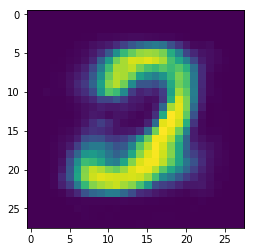

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  4



  0%|          | 1/214 [00:02<09:25,  2.65s/it]

[6 5 7 8 8 3 8 2 1 6 2 3 0 6 2 2 7 2 8 5 8 9 3 4 4 3 4 4 5 3 4 4 6 3 3 9 5
 4 1 6 5 1 9 5 5 3 7 8 1 5 1 9 9 8 3 8 3 3 7 6 6 0 6 1 3 0 1 3 3 8 6 6 4 3
 5 3 5 9 8 2 6 7 1 8 5 0 6 1 2 1 8 2 9 8 2 1 2 2 9 7 7 6 3 6 1 5 4 5 8 3 3
 1 0 6 7 0 0 0 5 8 9 1 1 0 5 7 6 3 2 5 5 2 2 6 6 7 4 3 1 2 8 9 6 1 7 2 9 7
 3 0 9 5 7 8 6 1 2 0 6 0 1 2 4 8 9 5 7 4 8 1 0 4 7 1 8 2 1 1 7 2 2 7 5 5 7
 1 2 8 6 6 2 8 8 9 2 0 9 2 8 3 5 8 5 6 5 3 8 6 0 8 4 3 4 6 6 5 0 4 4 7 7 7
 9 3 2 5 2 3 8 8 1 6 4 5 9 5 8 6 6 1 3 4 1 5 9 9 1 6 7 4 9 1 8 8 7 3]
[6 5 7 9 8 3 8 2 1 6 2 3 0 6 2 2 7 2 8 5 8 9 3 4 4 3 4 9 5 3 4 4 6 3 3 9 5
 4 1 6 5 1 9 5 5 3 7 8 1 5 1 4 9 8 3 8 3 3 7 6 6 0 6 1 3 0 1 3 3 8 6 6 4 3
 5 3 5 9 8 2 6 7 1 8 5 0 6 1 2 1 8 2 9 8 2 1 2 2 9 7 7 6 3 6 1 5 4 5 8 3 3
 1 0 6 7 0 0 0 5 8 9 1 1 0 5 7 6 3 2 3 5 2 2 6 6 7 4 3 1 2 8 9 6 1 7 2 9 7
 3 0 9 5 7 8 6 1 2 0 6 0 1 2 4 8 9 5 7 4 8 1 0 4 7 1 8 2 1 1 7 2 2 7 5 5 7
 1 2 8 6 6 2 8 8 9 2 0 9 2 8 3 5 8 5 6 5 3 8 6 0 8 4 3 4 6 6 5 0 4 4 7 7 7
 9 3 2 5 2 3 8 8 1 6 4 5 9 5 8


  1%|          | 2/214 [00:05<09:23,  2.66s/it]

[1 8 0 4 0 6 8 8 3 0 8 3 1 2 3 4 2 6 4 6 4 9 1 5 6 1 4 4 2 8 8 0 7 0 8 4 4
 7 6 1 3 3 2 4 2 3 7 1 2 3 1 8 7 0 6 0 5 3 1 8 1 2 8 4 6 5 0 5 0 1 4 0 8 1
 5 7 6 4 2 2 9 4 3 8 0 5 3 1 5 3 4 1 3 9 8 3 1 0 8 5 9 3 4 1 5 2 6 7 7 3 4
 4 2 6 8 0 9 2 4 3 3 8 3 9 1 1 6 9 7 1 1 5 1 0 5 4 3 9 1 6 2 3 1 9 6 6 2 0
 9 3 9 8 7 8 4 9 3 5 7 5 4 8 3 1 1 1 9 9 9 3 6 4 5 8 2 4 8 5 7 9 5 9 6 8 1
 3 8 2 0 6 2 6 9 2 1 1 6 6 8 5 1 1 6 9 7 5 4 0 9 6 0 0 2 9 7 8 0 7 6 3 8 3
 9 3 9 6 3 5 7 6 1 3 7 6 5 2 5 5 3 3 0 9 4 1 1 4 5 4 1 0 2 0 0 7 2 1]
[1 8 0 4 0 6 8 8 3 0 8 3 1 2 3 4 2 6 4 6 4 9 1 5 6 1 4 4 2 8 8 0 7 0 8 4 4
 7 6 1 3 3 2 4 2 3 7 1 2 3 1 8 7 0 6 0 5 3 1 8 1 2 8 4 6 5 0 5 0 1 4 0 8 1
 5 7 6 4 2 2 9 4 3 8 0 5 3 1 5 3 4 1 3 9 8 3 1 0 8 5 9 3 4 1 5 2 6 7 7 3 4
 4 2 6 8 0 9 2 4 3 3 8 3 9 1 1 6 9 7 1 1 5 1 0 5 4 3 9 1 6 2 3 1 9 6 6 2 0
 9 3 9 8 7 8 4 9 3 5 7 5 4 8 3 1 1 1 9 9 9 3 6 4 5 8 2 4 8 5 7 9 5 9 6 8 1
 3 8 2 0 6 2 6 9 2 1 1 6 6 8 5 1 1 6 9 7 5 4 0 9 6 0 0 2 9 7 8 0 7 6 3 8 3
 9 3 9 6 3 5 7 6 1 3 7 6 5 2 5


  1%|▏         | 3/214 [00:07<09:19,  2.65s/it]

[4 5 6 8 3 3 4 7 9 8 3 0 7 0 3 1 2 5 0 3 2 7 5 8 4 8 4 6 0 1 7 7 8 2 3 0 5
 4 4 4 9 3 2 2 9 8 3 9 9 7 2 2 5 1 9 9 3 1 6 6 7 8 8 3 0 6 5 6 2 6 2 9 0 7
 8 2 6 5 2 1 6 3 3 7 4 2 4 7 4 6 9 6 1 9 0 2 6 1 7 1 1 4 5 1 2 3 2 2 6 2 2
 2 7 2 4 5 4 4 5 7 5 5 2 1 9 1 9 7 7 2 0 8 5 7 5 9 0 2 0 5 6 3 8 4 6 1 4 1
 5 2 7 8 7 9 8 1 0 4 1 2 4 9 1 9 3 7 8 0 4 0 1 1 7 6 6 1 2 2 2 0 5 8 8 8 1
 1 4 1 9 8 6 4 1 4 1 9 1 7 3 4 5 8 2 2 6 6 6 8 6 9 7 7 4 6 1 5 6 8 2 8 8 6
 1 6 3 7 8 5 0 4 1 8 3 1 6 6 5 3 9 1 4 5 2 5 8 0 3 1 0 2 5 7 7 0 5 9]
[4 5 6 8 3 3 4 7 9 8 3 0 7 0 3 1 2 5 0 3 2 7 5 8 4 8 4 6 0 1 7 7 8 2 3 0 5
 4 4 4 9 3 2 2 9 8 3 9 9 7 2 2 5 1 9 9 3 1 6 6 7 8 8 3 0 6 5 6 2 6 2 9 0 7
 8 2 6 5 2 1 6 3 3 7 4 2 4 7 4 6 9 6 1 9 0 2 6 1 7 1 1 4 5 1 2 3 2 2 6 2 2
 2 7 2 4 5 4 4 3 7 5 5 2 1 9 1 9 7 7 2 0 8 5 7 5 9 0 2 0 5 6 3 8 4 6 1 4 1
 5 2 7 8 7 9 8 1 0 4 1 2 4 9 1 9 3 7 8 0 4 0 1 1 7 6 6 1 2 2 2 0 5 8 8 8 1
 1 4 1 9 8 6 4 1 4 1 9 1 7 3 4 5 8 2 2 6 6 6 8 6 9 7 7 4 6 1 5 6 8 2 8 8 6
 1 6 3 7 8 5 0 4 1 8 3 1 6 6 5


  2%|▏         | 4/214 [00:10<09:14,  2.64s/it]

[9 6 8 6 7 7 7 5 6 5 8 4 3 2 7 1 0 2 3 3 7 7 1 1 5 3 4 7 5 9 3 3 4 1 3 8 8
 1 3 7 2 7 1 1 6 7 5 9 0 1 1 1 9 3 8 6 1 2 6 1 4 4 9 6 1 9 4 9 9 5 4 8 6 7
 2 9 8 0 4 4 7 4 0 4 9 4 6 0 4 1 0 0 2 6 9 9 4 1 1 0 1 7 1 9 7 6 3 9 8 5 5
 0 8 0 8 8 0 5 7 4 9 2 6 0 0 4 9 6 5 2 8 2 4 7 8 9 7 8 1 3 9 6 2 3 5 5 1 6
 8 5 6 9 3 7 8 6 3 8 5 3 3 1 4 6 8 0 0 7 9 4 9 1 5 1 5 0 3 1 5 1 9 6 2 9 1
 5 8 4 7 0 6 8 2 4 8 9 7 0 7 0 4 9 6 0 6 8 0 9 4 1 3 4 8 6 6 6 7 9 2 3 1 1
 2 0 4 1 6 1 9 0 4 8 4 2 1 9 8 2 0 1 0 7 0 9 2 1 3 8 4 6 6 8 6 1 9 9]
[9 6 8 6 7 7 7 5 6 5 8 4 3 2 7 1 0 2 3 3 7 7 1 1 5 3 4 7 5 9 3 3 4 1 3 8 8
 1 3 7 2 7 1 1 6 7 5 9 0 1 1 1 9 3 8 6 1 2 6 1 4 4 9 6 1 9 4 9 9 5 4 8 6 7
 2 9 8 0 4 4 7 4 0 4 9 4 6 0 4 1 0 0 2 6 9 9 4 1 1 0 1 7 1 9 7 6 3 9 8 5 5
 0 8 0 8 8 0 5 7 4 9 2 6 0 0 4 9 6 5 2 8 2 4 7 8 9 7 8 1 3 9 6 2 3 5 5 1 6
 8 5 6 9 3 7 8 6 3 8 5 3 3 1 4 6 8 0 0 7 9 4 9 1 5 1 5 0 3 1 5 1 9 6 2 9 1
 5 8 4 7 0 6 8 2 4 8 9 7 0 7 0 4 9 6 0 6 8 0 9 4 1 3 4 8 6 6 6 7 9 2 3 1 1
 2 0 4 1 6 1 9 0 4 8 4 2 1 9 8


  2%|▏         | 5/214 [00:13<09:11,  2.64s/it]

[8 2 1 2 2 8 8 6 7 7 9 8 0 3 5 3 2 3 7 2 4 6 1 9 5 2 0 0 0 0 8 8 9 8 8 7 5
 8 9 9 1 5 8 6 6 2 5 2 0 9 9 9 2 6 5 9 0 4 3 0 5 4 6 0 0 8 5 0 1 1 8 7 1 0
 5 9 4 9 6 5 0 5 0 7 8 6 9 2 6 7 0 3 0 0 3 7 0 9 7 9 5 7 6 2 1 1 8 1 5 0 6
 3 4 0 5 9 5 0 2 0 5 4 0 2 0 4 9 7 3 1 1 9 0 8 1 1 1 4 9 8 0 3 7 5 9 7 5 6
 1 4 1 2 6 4 7 5 3 5 2 3 1 0 4 3 0 0 1 9 6 3 3 9 3 2 6 9 8 4 1 5 8 0 5 1 3
 1 5 8 6 0 8 1 3 6 2 4 2 8 4 9 6 2 4 1 5 8 3 8 2 9 3 4 6 8 9 0 7 3 1 8 3 5
 6 7 0 2 2 2 1 1 2 2 3 2 1 0 7 7 0 6 8 9 3 3 2 1 1 0 6 4 4 9 7 7 1 3]
[8 2 1 2 2 8 8 6 7 7 9 8 0 3 5 3 2 3 7 2 4 6 1 9 5 2 0 0 0 0 8 8 9 8 8 7 5
 8 9 9 1 5 8 6 6 2 5 2 0 9 9 9 2 6 5 9 0 4 3 0 5 4 6 0 0 8 5 0 1 1 8 7 1 0
 5 9 4 9 6 5 0 5 0 7 8 6 9 2 6 7 0 3 0 0 3 7 0 9 7 9 5 7 6 2 1 1 8 1 5 0 6
 3 4 0 5 9 5 0 2 0 5 4 0 2 0 4 9 7 3 1 1 9 0 8 1 1 1 4 9 8 0 3 7 5 9 7 5 6
 1 4 1 2 6 4 7 5 3 5 2 3 1 0 4 3 0 0 1 9 6 3 3 9 3 2 6 9 8 4 1 5 8 0 5 1 3
 1 5 8 6 0 8 1 3 6 2 4 2 8 4 9 6 2 4 1 5 8 3 8 2 9 3 4 6 8 9 0 7 3 1 8 3 5
 6 7 0 2 2 2 1 1 2 2 3 2 1 0 7


  3%|▎         | 6/214 [00:15<09:09,  2.64s/it]

[9 8 7 3 0 9 8 3 5 6 1 2 4 5 4 7 2 3 2 7 0 4 6 5 3 7 5 7 5 3 1 4 7 7 0 5 4
 1 8 1 8 7 1 9 9 9 9 1 1 9 2 7 4 4 8 3 3 9 3 1 7 2 6 2 0 8 3 5 9 0 8 2 1 8
 4 8 7 8 7 2 2 5 4 9 7 0 2 3 4 2 8 9 9 2 1 2 8 2 5 3 7 5 4 8 8 0 2 4 2 2 6
 2 4 4 3 7 4 3 3 1 3 9 1 5 3 0 3 7 1 5 1 0 2 3 0 1 5 7 7 2 1 6 6 1 4 0 9 4
 0 3 7 8 3 3 5 4 2 5 5 3 6 8 2 5 2 5 8 4 9 3 2 8 6 0 4 5 3 1 6 7 4 6 3 8 6
 0 2 4 0 6 1 1 6 0 4 6 8 8 1 2 0 3 2 3 7 3 6 3 3 6 8 7 6 5 2 6 2 2 0 6 3 4
 7 0 6 7 5 9 7 3 8 9 9 8 2 1 8 7 8 9 3 9 9 7 2 5 5 0 1 7 0 1 1 4 5 8]
[9 8 7 3 0 9 8 3 5 6 1 2 4 5 4 7 2 3 2 7 0 4 6 5 3 7 5 7 5 3 1 4 7 7 0 5 4
 1 8 1 8 7 1 9 9 9 9 1 1 9 2 7 4 4 8 3 3 9 3 1 7 2 6 2 0 8 3 5 9 0 8 2 1 8
 4 8 7 8 7 2 2 5 4 9 7 0 2 3 4 2 8 9 9 2 1 2 8 2 5 3 7 5 4 8 8 0 2 4 2 2 6
 2 4 4 3 7 4 3 3 1 3 9 1 5 3 0 3 7 1 5 1 0 2 3 0 1 5 7 7 2 1 6 6 1 4 0 9 4
 0 3 7 8 3 3 5 4 2 5 5 3 6 8 2 5 2 5 8 4 9 3 2 8 6 0 4 5 3 1 6 7 4 6 3 8 6
 0 2 4 0 6 1 1 6 0 4 6 8 8 1 2 0 3 2 3 7 3 6 3 3 6 8 7 6 5 2 6 2 2 0 6 3 4
 7 0 6 7 5 9 7 3 8 9 9 8 2 1 8


  3%|▎         | 7/214 [00:18<09:09,  2.66s/it]

[5 7 5 9 8 5 4 7 5 4 8 9 1 0 1 0 1 9 8 9 9 9 2 4 0 2 3 8 7 2 5 0 0 7 0 2 4
 3 1 0 4 3 4 6 4 0 4 1 9 5 7 6 6 5 5 8 1 7 4 1 0 0 1 5 3 6 6 5 6 6 3 9 8 8
 4 0 7 2 9 7 2 3 3 3 4 8 7 7 8 9 9 0 5 6 4 2 5 8 8 7 3 3 8 1 7 6 6 3 5 6 2
 8 7 2 3 7 1 2 4 8 0 6 0 6 4 2 4 5 5 7 9 3 3 7 2 7 7 2 3 0 1 5 9 5 0 7 2 7
 1 2 3 2 8 9 4 3 2 5 5 5 7 3 9 7 8 9 3 6 8 3 2 8 2 3 0 0 9 1 1 3 4 4 1 0 7
 1 7 6 2 2 6 9 8 5 5 1 1 1 5 1 6 8 4 1 8 5 4 4 4 1 2 1 7 4 0 9 0 6 7 4 7 1
 9 9 4 5 8 2 7 0 7 8 9 8 7 3 4 5 2 1 4 2 6 1 7 1 1 7 1 5 3 1 3 4 5 9]
[5 7 5 9 8 5 4 7 5 4 8 9 1 0 1 0 1 9 8 9 9 9 2 4 0 2 3 8 7 2 5 0 0 7 0 2 4
 3 1 0 4 3 4 6 4 0 4 1 9 5 7 6 6 5 8 8 1 7 4 1 0 0 1 5 3 6 6 5 6 6 3 9 8 8
 4 0 7 2 9 7 2 3 3 3 4 8 7 7 8 9 9 0 5 6 4 2 5 8 8 7 3 3 8 1 7 6 6 3 5 6 2
 8 7 2 3 7 1 2 4 8 0 6 0 6 4 2 4 5 5 7 9 3 3 7 2 7 7 2 3 0 1 5 9 5 0 7 2 7
 1 2 3 2 8 9 4 3 2 5 5 5 7 3 9 7 8 9 3 6 8 3 2 8 2 3 0 0 9 1 1 3 4 4 1 0 7
 1 7 6 2 2 6 9 8 5 5 1 1 1 5 1 6 8 4 1 8 5 4 4 4 1 2 1 7 4 0 9 0 6 7 4 7 1
 9 9 8 5 8 2 7 0 7 8 9 8 7 3 4


  4%|▎         | 8/214 [00:21<09:06,  2.65s/it]

[4 8 0 0 3 5 6 0 9 3 3 4 7 1 1 0 5 2 0 8 0 9 7 6 2 1 7 6 2 4 4 6 6 8 8 2 1
 8 8 0 5 1 2 9 3 4 4 2 5 0 6 4 0 0 7 8 5 2 3 9 3 0 0 6 0 4 5 5 7 5 2 1 7 3
 2 1 7 4 8 1 1 0 8 8 2 3 6 2 1 8 0 8 1 3 2 1 0 2 7 7 2 3 8 7 7 9 1 2 1 1 4
 5 3 7 2 6 3 6 8 7 6 8 7 6 2 7 7 1 8 1 7 4 0 2 5 1 3 5 1 4 1 0 0 0 2 0 0 1
 8 5 6 5 1 1 1 5 5 8 6 7 5 9 3 3 4 9 2 4 0 2 4 1 6 3 5 3 2 2 9 5 8 8 1 7 5
 2 8 7 9 6 7 5 5 0 6 6 1 5 2 1 9 9 5 3 4 5 5 8 3 0 9 1 4 2 4 1 2 8 1 2 9 5
 3 8 2 8 2 4 8 1 9 7 9 0 0 8 1 1 6 7 7 2 8 8 0 7 6 3 9 5 9 6 4 7 5 9]
[4 8 0 0 3 5 6 0 9 3 3 4 7 1 1 0 5 2 0 8 0 9 7 6 2 1 7 6 2 4 4 6 6 8 8 2 1
 8 8 0 5 1 2 9 3 4 4 2 5 0 6 4 0 0 7 8 5 2 3 9 3 0 0 6 0 4 5 5 7 5 2 1 7 3
 2 1 7 4 8 1 1 0 8 8 2 3 6 2 1 8 0 8 1 3 2 1 0 2 7 7 2 3 8 7 7 9 1 2 1 1 4
 5 3 7 2 6 3 6 8 7 6 8 7 6 2 7 7 1 8 1 7 4 0 2 5 1 3 5 1 4 1 0 0 0 2 0 0 1
 8 5 6 5 1 1 1 5 5 8 6 7 5 9 3 3 4 9 2 4 0 2 4 1 6 3 5 3 2 2 9 5 8 8 1 7 5
 2 8 7 9 6 7 5 5 0 6 6 1 5 1 1 9 9 5 3 4 5 5 8 3 0 9 1 4 2 4 1 2 8 1 3 9 5
 3 8 2 8 2 4 8 1 9 7 9 0 0 8 1


  4%|▍         | 9/214 [00:23<09:02,  2.65s/it]

[6 6 5 3 3 6 3 9 6 2 7 9 6 8 6 8 2 0 9 3 3 3 7 6 1 1 8 2 2 7 5 4 0 4 0 2 8
 7 1 6 3 1 2 2 7 8 5 7 0 4 1 4 6 4 2 6 2 3 3 4 7 8 3 5 3 4 7 9 2 8 1 2 8 1
 7 0 2 1 2 1 1 5 8 2 3 2 8 3 2 7 9 2 5 0 7 3 7 4 6 0 0 9 0 4 4 0 9 4 9 0 4
 3 9 3 2 3 5 0 6 9 2 3 4 8 2 6 6 5 6 0 6 1 6 7 3 0 3 8 7 8 5 5 3 9 6 8 0 5
 2 1 5 5 6 9 1 1 8 8 4 6 3 8 9 7 8 4 9 2 6 9 0 0 5 7 0 6 3 8 5 2 3 2 3 6 0
 9 3 8 8 9 3 7 9 0 1 1 0 6 1 2 1 3 9 2 1 2 1 2 9 0 1 1 9 1 3 4 9 9 3 6 2 1
 8 9 8 3 5 7 2 6 8 2 7 6 6 7 9 8 1 8 5 5 0 2 0 7 6 0 7 1 3 2 3 3 2 4]
[6 6 5 3 3 6 3 9 6 2 7 9 6 8 6 8 2 0 9 3 3 3 7 6 1 1 8 2 2 7 5 4 0 4 0 2 8
 7 1 6 3 1 2 2 7 8 5 7 0 4 1 4 6 4 2 6 2 3 3 8 7 8 3 5 3 4 7 9 2 8 1 2 8 1
 7 0 2 1 2 1 1 5 8 2 3 2 8 3 2 7 9 2 5 0 7 3 7 4 6 0 0 9 0 4 4 0 9 4 9 0 4
 3 9 3 2 3 5 0 6 9 2 3 4 8 2 6 6 5 6 0 6 1 6 7 3 0 3 8 7 8 5 5 3 9 6 8 0 5
 2 1 5 5 6 9 1 1 8 8 4 6 3 8 9 7 8 4 9 2 6 4 0 0 5 7 0 6 3 8 5 2 3 2 3 6 0
 9 3 8 8 9 3 7 9 0 1 1 0 6 1 2 1 3 9 2 1 2 1 2 9 0 1 1 9 1 3 4 9 9 3 6 2 1
 8 9 8 3 5 7 2 6 8 2 7 6 6 7 9


  5%|▍         | 10/214 [00:26<09:00,  2.65s/it]

[5 2 2 2 2 3 4 0 8 3 9 2 6 8 2 7 2 5 0 8 9 0 0 9 1 0 0 0 6 8 0 3 7 1 5 4 3
 0 3 0 8 9 5 2 5 4 8 3 0 5 3 1 1 7 6 9 6 1 5 0 5 6 7 7 2 8 2 4 8 2 7 1 9 1
 6 1 1 0 0 4 4 0 5 3 9 9 0 9 7 1 2 7 4 7 1 9 2 5 3 6 4 0 5 7 0 3 1 3 6 6 7
 1 7 0 0 3 6 0 0 6 9 9 4 4 6 4 2 7 0 6 9 2 0 4 7 4 8 2 7 6 5 1 0 2 7 4 7 6
 2 4 1 3 5 5 1 4 2 0 6 3 3 9 6 5 6 5 7 7 1 7 3 9 3 5 0 6 0 7 7 6 4 0 6 7 0
 9 5 7 3 2 9 1 1 9 2 4 0 9 7 4 2 0 2 3 6 4 5 0 2 6 1 1 0 1 5 9 3 7 6 1 0 8
 1 6 3 4 4 2 5 1 2 5 2 7 4 3 8 4 3 3 2 6 6 0 7 4 5 3 4 7 3 3 9 3 3 4]
[5 2 2 2 2 3 4 0 8 3 9 2 6 8 2 7 2 5 0 8 9 0 0 9 1 0 0 0 6 8 0 3 7 1 5 4 3
 0 3 0 8 9 5 2 5 9 8 3 0 5 3 1 1 7 6 9 6 1 5 2 5 6 7 7 2 8 2 4 8 2 7 1 9 1
 6 1 1 0 0 4 4 0 5 3 9 9 0 9 7 1 2 7 4 7 1 9 2 5 3 6 4 0 5 7 0 3 1 3 6 6 7
 1 7 0 0 3 6 0 0 6 9 9 4 4 6 4 2 7 0 6 9 2 0 4 7 4 8 2 7 6 5 1 0 2 7 4 7 6
 2 4 1 3 5 5 1 4 2 0 6 3 3 9 6 5 6 5 7 7 1 7 3 9 3 5 0 6 0 7 7 6 4 0 6 7 0
 9 5 7 3 2 9 1 1 9 2 4 0 9 7 4 2 0 2 3 6 4 5 0 2 6 1 1 0 1 5 9 3 7 6 1 0 8
 1 6 3 4 4 2 5 1 2 5 2 7 4 3 8


  5%|▌         | 11/214 [00:29<08:57,  2.65s/it]

[2 4 0 0 6 0 0 3 7 1 4 1 4 2 6 2 9 0 8 4 0 5 6 7 7 5 1 0 9 2 3 3 6 3 9 6 0
 1 1 0 0 9 9 0 7 8 6 3 0 4 3 4 4 2 8 9 7 1 9 1 5 1 1 4 9 8 6 2 3 9 3 1 6 1
 9 7 5 1 2 1 2 6 4 4 0 7 2 3 9 7 7 7 5 1 3 7 4 0 4 9 1 3 4 3 5 1 8 6 5 3 7
 6 3 9 3 5 1 2 5 1 8 0 3 8 1 7 1 9 4 5 8 3 4 7 0 6 0 2 2 3 9 7 4 6 5 6 9 7
 6 3 5 5 9 6 6 4 3 8 5 6 3 8 7 0 9 9 1 3 8 2 1 0 3 6 1 9 2 5 6 2 4 1 6 8 2
 4 6 3 6 3 3 1 6 9 4 4 1 4 7 6 1 8 6 2 2 9 1 7 4 4 0 2 9 4 7 1 3 9 1 0 7 1
 1 1 1 1 8 0 0 2 4 4 6 9 1 8 8 1 4 7 4 0 7 9 2 9 0 3 9 2 9 5 4 7 5 3]
[2 4 0 0 6 0 0 3 7 1 4 1 4 2 6 2 9 0 8 4 0 5 6 7 7 5 1 0 9 2 3 3 6 3 9 6 0
 1 1 0 0 9 9 0 7 8 6 3 0 4 3 4 4 2 8 9 7 1 9 1 5 1 1 4 9 8 6 2 3 9 3 1 6 1
 9 7 5 1 2 1 3 6 4 4 0 7 2 3 9 7 7 7 5 1 3 7 4 0 4 4 1 3 4 3 5 1 8 6 5 3 7
 6 3 9 3 5 1 2 5 1 8 0 3 8 1 7 1 7 4 5 8 3 4 7 0 6 0 2 2 3 9 7 4 6 5 6 9 7
 6 3 5 5 9 6 6 4 3 8 5 6 3 8 7 0 9 9 1 3 8 2 1 0 3 6 1 9 2 5 6 2 4 1 6 8 2
 4 6 3 6 3 3 1 6 9 4 4 1 4 7 6 1 8 6 2 2 9 1 7 4 4 0 2 9 4 7 1 3 9 1 0 7 1
 1 1 1 1 8 0 0 2 4 4 6 9 1 8 8


  6%|▌         | 12/214 [00:31<08:54,  2.65s/it]

[8 3 3 7 6 7 9 0 1 4 4 7 0 6 1 9 6 0 9 3 5 2 4 7 9 8 6 8 8 8 3 0 7 0 6 5 2
 2 8 8 0 7 7 4 7 4 9 9 1 6 9 2 7 8 2 1 4 7 6 1 5 9 7 7 6 4 1 8 7 0 9 7 1 6
 7 8 9 3 5 6 7 7 0 2 6 2 1 4 8 3 6 5 2 2 9 3 2 4 7 6 9 1 6 3 7 8 0 6 9 2 1
 3 8 0 2 1 9 2 6 7 7 7 1 0 7 0 3 7 7 4 4 9 0 4 7 5 0 9 6 9 3 6 6 3 5 7 7 1
 1 6 6 3 1 1 8 1 8 4 1 4 4 6 9 0 7 9 2 3 0 6 8 6 8 7 1 6 7 0 1 6 5 0 9 7 0
 6 7 7 8 2 2 6 8 2 7 9 3 9 2 7 0 2 0 7 9 0 0 6 4 2 9 3 1 2 2 4 2 0 0 5 7 3
 4 7 0 3 5 7 8 4 1 6 4 0 0 8 6 0 7 2 1 0 6 4 6 7 0 5 8 7 3 6 0 1 0 4]
[8 3 3 7 6 7 9 0 1 4 4 7 0 6 1 9 6 0 9 3 5 2 4 7 9 8 6 8 8 8 3 0 7 0 6 5 2
 2 8 8 0 7 7 4 7 4 9 9 1 6 9 2 7 8 2 1 4 7 6 1 5 9 7 7 6 4 1 8 7 0 9 7 1 6
 7 8 9 3 5 6 7 7 0 2 6 2 1 4 8 3 6 5 2 2 9 3 2 4 7 6 9 1 6 3 7 8 0 6 9 2 1
 3 8 0 2 1 9 2 6 7 7 7 1 0 7 0 3 7 7 4 4 9 0 4 7 5 0 9 6 9 3 6 6 3 5 7 7 1
 1 6 6 3 1 1 8 1 8 4 1 4 4 6 9 0 7 9 2 3 0 6 8 6 8 7 1 6 7 0 1 6 5 0 9 7 0
 6 7 7 8 2 2 6 8 2 7 9 3 9 2 7 0 2 0 7 9 0 0 6 4 2 9 3 1 2 2 4 2 0 0 5 7 3
 4 7 0 3 5 7 8 4 1 6 4 0 0 8 6


  6%|▌         | 13/214 [00:34<08:51,  2.65s/it]

[5 1 6 7 8 7 2 6 7 7 9 0 1 6 9 3 0 0 0 0 6 5 6 2 2 9 0 9 2 1 2 1 1 8 1 2 6
 5 8 9 6 8 2 0 7 8 1 9 0 1 5 5 5 6 0 3 8 8 6 3 3 1 5 3 7 3 7 3 5 9 2 6 1 6
 2 9 2 0 6 1 8 5 9 0 9 1 4 1 8 6 0 7 9 6 0 9 0 9 7 2 7 4 1 5 2 1 6 7 9 3 8
 6 3 4 0 5 5 2 2 2 0 7 7 0 9 1 7 4 3 5 9 0 7 8 3 4 7 6 7 2 7 8 9 5 7 9 7 7
 1 1 9 4 8 7 9 8 7 9 2 0 4 9 9 9 7 0 7 5 1 9 1 0 7 7 5 0 4 7 0 5 4 4 0 9 4
 0 0 3 6 6 0 2 3 9 5 5 9 7 0 7 9 9 0 9 4 5 8 0 3 8 9 0 7 8 7 0 2 8 8 9 7 4
 2 6 1 1 5 4 6 7 3 3 1 9 9 4 7 1 0 5 3 7 4 1 7 2 3 8 4 2 9 9 4 8 8 8]
[5 1 6 7 8 7 7 6 7 7 9 0 1 6 9 3 0 0 0 0 6 5 6 2 2 9 0 9 2 1 2 1 1 8 1 2 6
 5 8 9 6 8 2 0 7 8 1 9 0 1 5 5 5 6 0 3 8 8 6 3 3 1 5 3 7 3 7 3 5 9 2 6 1 6
 2 9 2 0 6 1 3 5 9 0 9 1 4 1 8 6 0 7 9 6 0 9 0 9 7 2 7 4 1 5 2 1 6 7 9 3 8
 6 3 4 0 5 5 2 2 2 0 7 7 0 9 1 7 4 3 5 9 0 7 8 3 4 7 6 7 2 7 8 9 5 7 9 7 7
 1 1 9 4 8 7 9 8 7 9 2 0 4 9 9 9 7 0 7 5 1 9 1 0 7 7 5 0 4 7 0 5 4 4 0 9 4
 0 0 3 6 6 0 2 3 9 5 5 9 7 0 7 9 9 0 9 4 5 8 0 3 8 9 0 7 8 7 0 2 8 8 9 7 4
 2 6 1 1 5 4 6 7 3 3 1 9 9 4 7


  7%|▋         | 14/214 [00:37<08:50,  2.65s/it]

[7 7 1 3 6 2 4 7 9 1 0 0 3 4 4 4 6 8 0 1 3 5 6 7 9 1 3 3 5 1 5 3 4 1 4 2 4
 5 3 4 2 4 2 1 5 7 3 8 0 0 2 6 3 9 4 2 0 4 2 3 1 0 8 3 4 3 2 4 1 2 4 6 0 9
 2 2 6 2 1 7 1 3 1 2 2 6 6 0 7 0 7 2 2 7 8 8 5 7 1 3 8 7 3 0 0 4 3 6 7 3 9
 4 9 2 7 5 3 1 5 1 5 2 5 2 6 5 2 4 5 8 3 4 3 7 6 8 7 1 7 4 5 8 4 1 1 2 6 3
 5 8 3 5 6 1 2 3 0 0 1 1 5 3 8 9 5 3 5 6 3 1 0 9 6 0 8 2 5 8 8 8 4 2 2 4 1
 8 0 6 0 6 7 3 1 9 5 1 6 7 7 7 7 8 4 1 4 7 3 0 5 1 8 8 5 7 4 5 3 9 8 2 7 3
 5 3 7 3 0 5 8 4 1 2 0 6 9 1 6 1 4 5 7 0 4 5 9 3 8 5 9 0 4 0 1 3 9 2]
[7 7 1 3 6 2 4 7 9 1 0 0 3 4 4 4 6 8 0 1 3 5 6 7 9 1 3 3 5 1 5 3 7 1 4 2 4
 5 3 4 2 4 2 1 5 7 3 8 0 0 2 6 3 9 4 2 0 4 2 3 1 0 8 3 4 3 2 4 1 2 4 6 0 9
 2 2 6 2 1 7 1 3 1 2 2 6 6 0 7 0 7 2 2 7 8 8 5 7 1 3 8 7 3 0 0 4 3 6 7 3 9
 4 9 2 7 5 3 1 5 1 5 2 5 2 6 5 2 4 5 8 3 4 3 7 6 8 7 1 7 4 5 8 4 1 1 2 6 3
 5 8 3 5 6 1 2 3 0 0 1 1 5 3 8 9 5 3 5 6 3 1 0 9 6 0 8 2 5 8 8 8 4 2 2 4 1
 8 0 6 0 6 7 3 1 9 5 1 6 7 7 7 7 8 4 1 4 7 3 0 5 1 8 8 5 7 4 5 3 9 8 2 7 3
 5 3 7 3 0 5 8 4 1 2 0 6 9 1 6


  7%|▋         | 15/214 [00:39<08:47,  2.65s/it]

[4 9 3 3 0 3 1 2 7 3 8 7 8 3 6 6 1 8 4 0 2 8 3 4 2 6 2 5 3 0 0 0 1 8 1 0 3
 0 7 7 9 6 6 1 1 7 9 7 6 5 0 1 0 3 1 8 7 7 4 6 7 4 2 1 7 7 9 4 2 1 6 5 6 0
 9 1 2 3 9 9 6 2 3 9 6 7 6 8 5 6 9 2 6 8 1 7 9 3 3 8 2 0 1 0 9 1 2 3 3 9 1
 4 7 4 9 1 1 5 4 8 6 7 2 4 8 6 6 7 1 3 4 7 7 2 8 2 3 0 3 9 3 5 3 0 0 3 1 9
 2 8 7 3 2 3 9 4 5 6 2 9 1 6 2 7 9 3 9 4 0 4 4 1 1 5 8 5 9 6 0 8 9 0 2 6 5
 1 1 5 6 2 5 9 1 4 0 9 1 3 5 3 4 5 9 1 9 2 0 7 0 3 9 7 5 7 7 6 1 4 8 4 4 2
 4 7 6 2 9 2 8 4 1 3 4 0 6 1 9 2 6 3 0 1 1 9 1 7 1 5 0 0 0 3 2 9 2 7]
[4 9 3 3 0 3 1 2 7 3 8 7 8 3 6 6 1 8 4 0 2 8 3 4 2 6 2 5 3 0 0 0 1 8 1 0 3
 0 7 7 9 6 6 1 1 7 9 7 6 5 0 1 0 3 1 8 7 7 4 6 7 4 2 1 7 7 9 4 2 1 6 5 6 0
 9 1 2 3 9 9 6 2 3 9 6 7 6 8 5 6 9 2 6 8 1 7 9 3 3 8 2 0 1 0 9 1 2 3 3 9 1
 4 7 4 9 1 1 5 4 8 6 7 2 4 8 6 6 7 1 3 4 7 7 2 8 2 3 0 3 9 3 5 3 0 0 3 1 9
 2 8 7 3 2 3 9 4 5 6 2 9 1 6 3 7 9 3 9 4 0 4 4 1 1 5 8 5 9 6 0 8 9 0 2 6 5
 1 1 5 6 2 5 9 1 4 0 9 1 3 5 3 4 5 9 1 9 2 0 7 0 3 9 7 5 7 7 6 1 4 8 4 4 2
 4 7 6 2 9 2 8 4 1 3 4 0 6 1 9


  7%|▋         | 16/214 [00:42<08:45,  2.65s/it]

[6 8 7 7 4 7 2 2 5 5 1 0 6 0 5 1 7 8 4 0 7 2 8 2 7 9 9 1 7 4 0 1 6 5 8 5 8
 1 4 4 5 1 1 1 3 3 8 4 8 1 8 5 8 5 3 7 6 9 1 8 3 6 6 2 2 8 2 4 3 2 7 9 9 1
 0 3 1 4 2 2 6 0 1 1 3 1 1 5 3 2 8 4 7 8 2 1 2 4 6 5 8 2 1 2 3 6 2 4 1 5 9
 7 8 1 3 2 0 9 0 8 3 6 3 4 2 1 8 5 3 7 5 1 5 7 3 4 3 0 5 3 1 0 1 0 1 2 9 0
 0 7 1 1 6 5 4 4 8 3 7 0 7 0 2 7 2 9 6 1 0 0 4 5 1 3 0 1 8 2 0 0 5 7 2 7 7
 0 5 1 6 5 9 0 0 0 0 9 3 2 3 4 0 9 1 7 6 4 1 4 7 1 4 3 0 1 1 8 0 3 5 2 2 3
 0 0 0 0 9 7 4 5 2 2 6 4 8 9 9 1 2 4 4 8 8 1 2 8 2 6 9 8 2 5 0 6 7 7]
[6 8 7 7 4 7 2 2 5 5 1 0 6 0 5 1 7 8 4 0 7 2 8 2 7 9 9 1 7 4 0 1 6 5 8 5 8
 1 4 4 5 1 1 1 3 3 8 4 8 1 8 5 8 5 3 7 6 9 1 8 3 6 6 2 2 8 2 4 3 2 7 9 9 1
 0 3 1 4 2 2 6 0 1 1 3 1 1 5 3 2 8 4 7 8 2 1 2 4 6 5 8 2 1 2 3 6 2 4 1 5 9
 7 8 1 3 2 0 9 0 8 3 6 3 4 2 1 8 5 3 7 5 1 5 7 3 4 3 0 5 3 1 0 1 0 1 2 9 0
 0 7 1 1 6 5 4 4 8 3 7 0 7 0 2 7 2 9 6 1 0 0 4 5 1 3 0 1 8 2 0 0 5 7 2 7 7
 0 5 1 6 5 9 0 0 0 0 9 3 2 3 4 0 9 1 7 6 4 1 4 7 1 4 3 0 1 1 8 0 3 5 2 2 3
 0 0 0 0 9 7 4 5 2 2 6 4 8 9 9


  8%|▊         | 17/214 [00:45<08:43,  2.66s/it]

[3 3 9 1 3 7 6 8 5 1 8 5 4 7 3 8 7 4 2 7 3 4 1 2 2 7 3 6 3 9 7 7 0 2 5 8 4
 1 3 0 3 6 2 8 3 1 2 8 3 9 4 3 7 5 5 6 2 4 6 9 7 2 7 0 5 6 5 7 7 0 4 1 7 8
 3 0 0 8 6 4 4 2 6 9 9 3 4 6 4 6 8 2 4 7 9 4 2 8 1 1 9 4 3 1 5 8 9 7 7 0 9
 7 9 3 2 0 7 0 5 1 7 4 2 1 8 7 5 3 0 4 0 3 9 8 8 3 2 4 6 2 0 8 4 1 9 6 5 4
 7 3 9 6 8 4 6 0 6 0 5 6 7 9 1 5 4 8 1 4 4 3 5 9 5 4 4 3 9 2 3 8 4 8 1 4 6
 3 8 1 3 3 0 8 2 5 7 2 5 8 3 6 6 2 1 8 3 2 8 6 6 5 1 4 7 1 7 7 7 4 4 3 9 0
 0 4 8 4 7 9 7 2 2 9 7 4 5 6 1 3 7 6 9 6 3 9 3 8 3 3 6 1 2 4 9 7 7 6]
[3 3 9 1 3 7 6 8 5 1 8 5 4 7 3 8 7 4 2 7 3 4 1 2 2 7 3 6 3 9 7 7 0 2 5 8 4
 1 3 0 3 6 2 8 3 1 2 8 3 9 4 3 7 5 5 6 2 4 6 9 7 2 7 0 5 6 5 7 7 0 4 1 7 8
 3 0 0 8 6 4 4 2 6 9 9 3 4 6 4 6 8 2 4 7 9 4 2 8 1 1 9 4 3 1 5 8 9 7 7 0 9
 7 9 3 2 0 7 0 5 1 7 4 2 1 8 7 5 3 0 4 0 3 9 8 8 3 2 4 6 2 0 8 4 1 9 6 5 4
 7 3 9 6 8 4 6 0 6 0 5 6 7 9 1 5 4 8 1 4 4 3 5 9 5 4 4 3 9 2 3 8 4 8 1 4 6
 3 8 1 3 3 0 8 2 5 7 2 5 8 3 6 6 2 1 8 3 2 8 6 6 5 1 4 7 1 7 7 7 4 4 3 9 0
 0 4 8 4 7 9 7 2 2 9 7 4 5 6 1


  8%|▊         | 18/214 [00:47<08:40,  2.65s/it]

[0 3 8 3 0 7 2 1 5 9 4 7 5 8 0 4 7 9 9 8 9 9 4 8 4 9 7 9 6 7 8 6 6 8 6 8 8
 9 8 5 9 2 1 8 3 5 4 7 2 9 2 1 9 8 2 0 9 4 3 7 0 0 8 2 0 5 9 2 5 3 9 3 5 9
 6 6 5 4 0 4 7 2 2 4 1 1 9 3 4 0 8 0 2 5 9 7 1 4 3 6 0 8 7 1 5 3 9 9 4 2 4
 1 8 1 9 7 7 6 0 8 5 4 6 9 0 3 7 0 1 6 8 0 2 3 3 4 3 4 4 7 2 9 2 7 8 2 9 2
 1 5 4 1 8 9 1 9 0 6 7 0 6 8 3 7 4 9 6 8 3 3 2 3 3 0 3 9 8 9 7 8 4 7 3 2 6
 4 2 4 4 7 0 2 7 7 2 9 3 8 3 8 4 6 3 9 0 2 1 5 0 2 5 6 3 0 8 2 0 2 7 8 6 1
 5 7 9 4 2 7 0 2 8 6 2 3 4 1 4 6 7 6 4 8 4 8 5 1 6 7 1 8 6 5 3 1 9 5]
[0 3 8 3 0 7 2 1 5 9 4 7 5 8 0 4 7 9 9 8 9 9 4 8 4 9 7 9 6 7 8 6 6 8 6 8 8
 9 8 5 9 2 1 8 3 5 4 7 2 9 2 1 9 8 2 0 9 4 3 7 0 0 8 2 0 5 9 2 5 3 9 3 5 9
 6 6 5 4 0 4 7 2 2 4 1 1 9 3 4 0 8 0 2 5 9 7 1 4 3 6 0 8 7 1 5 3 9 9 4 2 4
 1 8 1 4 7 7 6 0 8 5 4 6 9 0 3 7 0 1 6 8 0 2 3 3 4 3 4 4 7 2 9 2 7 8 2 9 2
 1 5 4 1 8 9 1 9 0 6 7 0 6 8 3 7 4 9 6 8 3 3 2 3 3 0 3 9 8 9 7 8 4 7 3 2 6
 4 2 4 4 7 0 2 7 7 2 9 3 8 3 8 4 6 3 9 7 2 1 5 0 2 5 6 3 0 8 2 0 2 7 8 6 1
 5 7 9 4 2 7 0 2 8 6 2 3 4 1 4


  9%|▉         | 19/214 [00:50<08:37,  2.65s/it]

[6 7 8 7 9 1 3 6 1 5 5 5 1 7 9 3 5 9 2 0 5 4 8 0 3 3 7 0 7 3 0 0 1 4 8 8 0
 6 0 4 9 2 0 2 1 0 5 1 2 0 2 2 7 8 4 1 0 2 8 1 9 7 3 4 5 4 5 5 8 6 8 9 5 9
 7 6 1 7 2 1 5 5 9 2 0 2 5 9 1 4 8 2 3 6 9 8 1 4 2 6 5 4 8 6 2 4 6 5 6 2 8
 8 5 2 2 1 0 6 2 3 9 3 1 7 9 5 1 1 7 2 1 7 1 3 6 4 6 1 7 5 2 1 3 1 0 1 7 9
 1 3 3 3 3 7 5 1 1 7 6 4 0 1 5 5 9 0 3 4 7 1 7 2 3 7 7 1 2 6 5 7 8 1 1 9 4
 5 8 3 1 6 5 7 1 5 9 1 3 5 2 1 0 0 6 5 5 2 2 0 4 6 1 7 9 1 1 3 5 6 6 5 4 3
 4 7 8 4 9 1 0 1 4 1 0 1 1 9 4 6 8 4 4 9 6 0 2 9 0 9 4 3 8 2 2 5 5 7]
[6 7 8 7 9 1 3 6 1 5 5 5 1 7 9 3 5 9 2 0 5 4 8 0 3 3 7 0 7 3 0 0 1 4 8 8 0
 6 0 4 9 2 0 2 1 0 5 1 2 0 2 2 7 8 4 1 0 2 8 1 9 7 3 9 5 4 5 5 8 6 8 9 5 9
 7 6 1 7 2 1 5 5 9 2 0 2 5 9 1 4 8 2 3 6 9 8 1 4 2 6 5 4 8 6 2 4 6 5 6 2 8
 8 5 2 2 1 0 6 2 3 9 3 1 7 9 5 1 1 7 2 1 7 1 3 6 4 6 1 7 5 2 1 3 1 0 1 7 9
 1 3 3 3 3 7 5 1 1 7 6 4 0 1 5 5 9 0 3 4 7 1 7 2 3 7 7 1 2 6 5 7 8 1 1 9 4
 5 8 3 1 6 5 7 1 5 9 1 3 5 2 1 0 0 6 5 5 2 2 0 4 6 1 7 9 1 1 3 5 6 6 5 4 3
 4 7 8 4 9 1 0 1 4 1 0 1 1 9 4


  9%|▉         | 20/214 [00:52<08:33,  2.65s/it]

[6 5 3 1 0 6 9 3 1 6 5 9 0 5 5 2 9 5 3 7 7 0 9 8 7 7 3 6 2 0 8 1 0 5 9 4 0
 3 4 1 6 4 5 7 0 8 8 7 1 1 1 8 8 0 7 4 6 6 0 1 1 7 7 6 6 6 0 4 2 7 2 8 5 1
 8 5 0 4 8 3 2 7 0 2 6 7 0 4 9 9 9 3 1 3 3 8 6 7 2 5 2 1 7 9 3 8 1 0 3 1 2
 9 3 2 2 6 1 1 7 9 2 8 6 1 4 2 5 1 3 9 7 9 6 1 8 3 4 2 0 3 9 5 0 7 2 3 8 5
 2 1 8 0 8 2 3 0 4 4 6 2 0 3 2 4 6 4 4 9 0 2 0 7 6 4 3 7 4 4 1 8 9 5 1 5 4
 7 1 9 7 5 0 9 8 1 8 5 0 6 4 7 0 9 3 9 6 3 7 8 0 9 5 1 5 5 8 2 2 1 9 4 0 9
 1 4 6 1 3 1 2 2 3 1 3 1 9 7 5 8 2 9 0 8 8 0 2 5 7 3 2 4 8 3 8 0 7 5]
[6 5 3 1 0 6 9 3 1 6 5 9 0 5 5 2 9 5 3 7 7 0 9 8 7 7 3 6 2 0 8 1 0 5 9 4 0
 3 4 1 6 4 5 7 0 8 8 7 1 1 1 8 8 0 7 4 6 6 0 1 1 7 7 6 6 6 0 4 2 7 2 8 5 1
 8 5 0 4 8 3 2 7 0 2 6 7 0 4 9 9 9 3 1 3 3 8 6 7 2 5 2 1 7 9 3 8 1 0 3 1 2
 9 3 2 2 6 1 1 7 9 2 8 6 1 4 2 5 1 3 9 7 9 6 1 8 3 4 2 0 3 9 5 0 7 2 3 8 5
 2 1 8 0 8 2 3 0 4 4 6 2 0 3 2 4 6 4 4 9 0 2 0 7 6 4 3 7 4 4 1 8 9 5 1 5 4
 7 1 9 7 5 0 9 8 1 8 5 0 6 4 7 0 9 3 9 6 3 7 8 0 9 5 1 5 5 8 2 2 1 9 4 0 9
 1 4 6 1 3 1 2 2 3 1 3 1 9 7 5


 10%|▉         | 21/214 [00:55<08:31,  2.65s/it]

[9 7 7 9 0 1 3 0 6 5 5 1 4 8 6 6 1 0 3 9 5 8 4 9 4 4 4 5 2 2 8 7 8 5 1 9 5
 0 1 5 9 5 5 7 5 6 0 0 2 7 5 6 6 1 9 2 0 6 7 8 7 7 7 5 0 9 2 1 4 0 5 0 8 0
 2 1 9 4 1 6 3 5 3 0 3 6 2 1 8 8 0 2 3 1 3 7 7 8 4 8 2 0 8 9 8 5 8 7 3 1 6
 9 4 9 7 6 1 7 8 1 5 3 5 0 0 0 4 1 1 5 9 8 2 3 4 7 5 4 3 7 1 4 6 9 1 0 3 6
 4 2 3 4 9 8 4 0 4 4 0 9 1 1 7 9 3 1 1 2 8 2 3 4 7 5 1 2 3 5 0 1 8 0 4 1 6
 7 2 0 1 5 3 6 4 8 9 3 0 1 5 8 1 8 4 4 9 6 1 0 1 1 2 1 8 8 1 3 4 3 3 9 9 1
 1 3 6 1 7 4 8 7 0 7 3 7 6 0 9 8 5 6 5 5 9 5 6 8 2 1 3 1 9 7 7 4 9 9]
[9 7 7 9 0 1 3 0 6 5 5 1 4 8 6 6 1 0 3 9 5 8 4 9 4 4 4 5 2 2 8 7 8 5 1 9 5
 0 1 5 9 5 5 7 5 6 0 0 2 7 5 6 6 1 9 2 0 6 7 8 7 7 7 5 0 9 2 1 4 0 5 0 8 0
 2 1 9 4 1 6 3 5 3 0 3 6 2 1 8 8 0 2 3 1 3 7 7 8 4 8 2 0 8 9 8 5 8 7 3 1 6
 9 4 9 7 6 1 7 8 1 5 3 5 0 0 0 4 1 1 5 9 8 2 3 4 7 5 4 3 7 1 4 6 9 1 0 3 6
 4 2 3 4 9 8 4 0 4 4 0 9 1 1 7 9 3 1 1 2 8 2 3 4 7 5 1 2 3 5 0 1 8 0 4 1 6
 7 2 0 1 5 3 6 4 8 9 3 0 1 5 8 1 8 4 4 9 6 1 0 1 1 2 1 8 8 1 3 4 3 3 9 9 1
 1 3 6 1 7 4 8 7 0 7 3 7 6 0 9


 10%|█         | 22/214 [00:58<08:28,  2.65s/it]

[5 7 0 0 4 4 7 1 9 9 5 2 1 9 4 0 7 9 3 7 1 5 6 9 7 8 3 3 7 4 1 4 7 4 0 6 8
 0 6 0 3 2 1 5 0 3 2 8 9 3 7 9 4 7 2 9 5 0 1 4 5 2 3 1 2 9 7 7 3 7 3 7 3 2
 5 8 5 9 3 1 0 3 1 1 7 4 4 0 8 6 0 2 9 1 1 1 9 3 5 3 2 7 6 9 5 5 0 2 1 6 6
 2 6 5 7 9 7 8 6 5 8 7 6 6 3 9 9 9 4 5 2 2 9 4 8 8 7 6 2 6 1 7 2 2 2 3 0 9
 8 9 3 6 6 1 4 9 9 4 1 8 3 9 9 7 0 0 0 8 8 5 8 0 3 5 4 0 3 0 7 4 6 2 8 8 3
 5 5 2 6 0 7 8 4 4 8 3 4 4 4 3 7 4 1 3 3 8 1 8 0 9 0 3 7 3 7 3 0 3 6 9 4 4
 1 2 1 0 2 7 8 4 8 4 8 7 3 7 1 3 5 2 0 9 8 9 3 5 0 7 3 3 3 7 2 2 0 2]
[5 7 0 0 4 4 7 1 9 3 5 2 1 9 4 0 7 9 3 7 1 5 6 9 7 8 3 3 7 4 1 4 7 4 0 6 8
 0 6 0 3 2 1 5 0 3 2 8 9 3 7 9 4 7 2 9 5 0 1 4 5 2 3 1 2 9 7 7 3 7 3 7 3 2
 5 8 5 9 3 1 0 3 1 1 7 4 4 0 8 6 0 2 9 1 1 1 9 3 5 3 2 7 6 9 5 5 0 2 1 6 6
 2 6 5 7 9 7 8 6 5 8 7 6 6 3 9 9 9 4 5 2 2 9 4 8 8 7 6 2 6 1 7 2 2 2 3 0 9
 8 9 3 6 6 1 4 9 9 4 1 8 3 9 9 7 0 0 0 8 8 5 8 0 3 5 4 0 3 0 7 4 6 2 8 8 3
 5 5 2 6 0 7 8 4 4 8 3 4 4 4 3 7 4 1 3 3 8 1 8 0 9 0 3 7 3 7 3 0 3 6 9 4 4
 1 2 1 0 2 7 8 4 8 4 8 7 3 7 1


 11%|█         | 23/214 [01:00<08:25,  2.65s/it]

[9 8 9 6 2 8 4 6 6 7 2 5 1 0 5 2 7 7 2 9 6 5 8 1 4 8 8 2 2 1 6 6 7 9 8 2 2
 8 4 0 4 0 2 4 7 6 3 8 3 0 8 8 6 1 1 3 1 3 8 3 8 9 7 0 2 0 6 5 3 2 9 4 1 4
 6 3 9 2 5 2 9 9 3 3 5 3 3 5 9 6 7 9 0 2 2 5 4 4 1 3 2 0 6 3 3 5 5 4 3 8 8
 0 8 9 9 2 0 9 2 5 9 1 2 6 1 0 9 8 4 0 5 1 3 2 3 1 1 7 1 9 7 6 8 6 4 0 0 4
 1 4 0 4 3 4 7 5 1 1 3 7 4 9 8 9 9 2 1 4 6 8 1 1 5 5 5 2 7 8 6 7 4 4 2 9 5
 1 8 2 5 6 0 2 3 8 1 8 9 5 3 6 3 7 6 0 6 5 1 6 0 9 1 4 4 0 2 9 6 4 2 7 3 8
 4 6 1 3 2 1 7 6 9 9 6 1 8 9 0 5 6 2 3 4 0 6 7 8 0 3 4 8 2 8 9 6 0 3]
[9 8 9 6 2 8 4 6 6 7 2 5 1 0 5 2 7 7 2 9 6 5 8 1 4 8 8 2 2 1 6 6 7 9 8 2 2
 8 4 0 4 0 2 4 7 6 3 8 3 0 8 8 6 1 1 3 1 3 8 3 8 9 7 0 2 0 6 5 3 2 9 4 1 4
 6 3 9 2 5 2 9 9 3 3 5 3 3 5 9 6 7 9 0 2 2 5 4 4 1 3 2 0 6 3 3 5 5 4 3 8 8
 0 8 9 9 2 0 9 2 5 9 1 2 6 1 0 9 8 4 0 5 1 3 2 3 1 1 7 1 9 7 6 8 6 4 0 0 4
 1 4 0 4 3 4 7 5 1 1 3 7 4 9 8 9 4 2 1 4 6 8 1 1 5 5 5 2 7 8 6 7 4 4 2 9 5
 1 8 2 5 6 0 2 3 8 1 8 9 5 3 6 3 7 6 0 6 5 1 6 0 9 1 4 4 0 2 9 6 4 2 7 3 8
 4 6 1 3 2 1 7 6 9 9 6 1 8 9 0


 11%|█         | 24/214 [01:03<08:24,  2.65s/it]

[6 6 1 2 5 7 3 7 9 6 7 3 2 4 8 0 3 6 2 2 5 0 5 5 0 8 6 5 6 3 3 6 4 3 1 2 4
 5 9 8 0 1 2 3 7 5 5 1 5 7 4 9 8 8 1 2 4 6 7 2 1 2 9 9 1 8 3 4 4 8 7 0 2 7
 7 2 8 0 8 6 5 5 3 2 6 2 3 1 8 3 4 2 3 1 2 5 7 2 3 7 5 4 7 8 9 2 0 5 4 7 9
 6 8 3 8 1 2 0 3 0 8 5 3 4 8 4 9 6 3 5 1 7 7 3 8 3 0 7 5 1 1 1 1 0 6 2 5 4
 9 6 5 3 8 7 7 2 3 0 0 0 5 0 2 5 8 2 4 2 8 5 2 5 7 8 7 4 7 9 8 7 6 7 0 3 3
 6 1 9 5 3 3 3 6 4 6 5 5 5 5 4 0 4 5 0 8 7 3 6 4 3 0 4 0 2 3 6 1 6 3 0 3 1
 9 4 1 2 6 5 2 1 5 1 8 6 2 3 6 9 3 9 4 9 2 4 2 6 8 9 8 1 0 6 4 9 3 9]
[6 6 1 2 5 7 3 7 9 6 7 3 2 4 8 0 3 6 2 2 5 0 5 5 0 0 6 5 6 3 3 6 4 3 1 2 4
 5 9 8 0 1 2 3 7 5 5 1 5 7 4 9 8 8 1 2 4 6 7 2 1 2 9 9 1 9 3 4 4 8 7 0 2 7
 7 2 8 0 8 6 5 5 3 2 6 2 3 1 8 3 4 2 3 1 2 5 7 2 3 7 5 4 7 8 9 2 0 5 4 7 9
 6 8 3 8 1 2 0 3 0 8 5 3 4 8 4 9 6 3 5 1 7 7 3 8 3 0 7 5 7 1 1 1 0 6 2 5 4
 9 6 5 3 8 7 7 2 3 0 0 0 5 0 2 5 8 2 4 2 8 5 2 5 7 8 7 4 7 9 8 7 6 7 0 3 3
 6 1 9 5 3 3 3 6 4 6 5 5 5 5 4 0 4 5 0 8 7 3 6 4 3 0 4 0 2 3 6 1 6 3 0 3 1
 9 4 1 2 6 5 2 1 5 1 8 6 2 3 6


 12%|█▏        | 25/214 [01:06<08:22,  2.66s/it]

[3 9 7 7 8 0 0 5 1 3 6 2 3 3 0 9 4 6 7 2 7 8 0 4 7 5 7 6 3 9 7 0 4 7 5 2 0
 8 1 6 9 3 0 2 4 4 8 5 9 1 1 6 6 2 1 1 2 1 4 2 3 8 7 7 8 5 8 5 0 4 5 9 0 7
 7 9 1 4 6 9 7 4 1 9 2 3 6 2 7 9 1 0 9 8 4 7 1 6 3 4 8 1 0 6 3 5 9 6 0 6 2
 3 6 3 9 2 0 3 1 9 5 0 3 6 8 0 4 5 2 4 2 5 9 8 3 6 2 7 3 9 6 1 7 8 1 4 9 1
 3 7 1 7 4 0 9 3 2 8 3 3 1 6 8 7 9 9 2 0 2 9 3 7 5 5 7 1 1 3 6 7 5 5 0 3 7
 0 6 9 7 0 8 7 2 0 5 2 0 1 0 2 7 7 0 6 3 0 2 0 2 6 6 8 8 0 0 0 3 3 9 7 2 0
 9 0 5 7 7 2 4 2 6 1 3 5 7 4 5 9 2 9 7 5 4 5 2 9 4 5 6 8 8 8 2 8 8 3]
[3 9 7 7 8 0 0 5 1 3 6 2 3 3 0 9 4 6 7 2 7 8 0 4 7 5 7 6 3 9 7 0 4 7 5 2 0
 8 1 6 9 3 0 2 4 4 8 5 9 1 1 6 6 2 1 9 2 1 4 2 3 8 7 7 8 5 8 5 0 4 5 9 0 7
 7 9 1 4 6 9 7 4 1 9 2 3 6 2 7 9 1 0 9 8 4 7 1 6 3 4 8 1 0 6 3 5 9 6 0 6 2
 3 6 3 9 2 0 3 1 9 5 0 3 6 8 0 4 5 2 4 2 5 9 8 3 6 2 7 3 9 6 1 7 8 1 4 9 1
 3 7 1 7 4 0 9 3 2 8 3 3 1 6 8 7 9 9 2 0 2 9 3 7 5 5 7 1 1 3 6 7 5 5 0 3 7
 0 6 9 7 0 8 7 2 0 5 2 0 1 0 2 7 7 0 6 3 0 2 0 2 6 6 8 8 0 0 0 3 3 9 7 2 0
 9 0 5 7 7 2 4 2 6 1 3 5 7 4 5


 12%|█▏        | 26/214 [01:08<08:18,  2.65s/it]

[1 8 3 7 0 9 9 2 2 6 1 2 5 4 0 2 6 6 5 6 6 7 3 0 1 3 6 3 2 8 0 6 8 7 9 2 6
 1 7 8 9 2 9 1 4 8 4 1 4 5 3 8 3 2 9 4 7 2 2 6 5 5 1 1 1 1 1 6 8 2 1 7 6 4
 6 3 4 7 8 2 8 1 6 2 0 2 6 5 9 4 9 3 9 0 4 4 7 3 0 2 0 4 8 2 5 1 3 8 9 5 5
 0 9 4 2 8 1 6 0 3 7 4 2 7 8 1 7 0 3 1 1 3 2 3 9 6 2 1 6 5 1 2 9 7 3 8 1 1
 5 2 0 4 4 0 3 4 0 6 3 7 0 0 4 0 6 6 3 5 6 6 9 4 6 9 9 2 6 9 4 1 0 7 5 4 6
 8 0 8 9 6 9 6 5 5 4 6 0 9 7 2 6 3 9 0 9 7 4 7 6 6 5 2 3 7 0 8 1 1 0 6 7 5
 8 9 4 5 1 1 5 1 6 4 5 4 0 7 7 6 4 8 1 3 6 5 0 7 0 5 3 9 3 1 2 5 4 7]
[1 3 3 7 0 9 9 2 2 6 1 2 5 4 0 2 6 6 5 6 6 7 3 0 1 3 6 3 2 8 0 6 8 7 9 2 6
 1 7 8 9 2 9 1 4 8 4 1 4 5 3 8 3 2 9 4 7 2 2 6 5 5 1 1 1 1 1 6 8 2 1 7 6 4
 6 3 4 7 8 2 8 1 6 2 0 2 6 5 9 4 9 3 9 0 4 4 7 3 0 2 0 4 8 2 5 1 3 8 9 5 5
 0 9 4 2 8 1 6 0 3 7 4 2 7 8 1 7 0 3 1 1 3 2 3 9 6 2 1 6 5 1 2 9 7 3 8 1 1
 5 2 0 4 4 0 3 4 0 6 3 7 0 0 4 0 6 6 3 5 6 6 9 4 6 9 9 2 6 9 4 1 0 7 5 4 6
 8 0 8 9 6 9 6 5 5 4 6 0 9 7 2 6 3 9 0 9 7 4 7 6 6 5 2 3 7 0 8 1 1 0 6 7 5
 8 9 4 5 1 1 5 1 6 4 5 4 0 7 7


 13%|█▎        | 27/214 [01:11<08:16,  2.65s/it]

[0 5 9 1 9 7 8 0 0 0 1 3 7 5 1 7 1 0 7 7 1 4 5 8 1 0 7 3 3 3 2 1 3 2 5 1 8
 3 9 5 8 3 5 7 1 4 1 3 8 4 0 2 2 9 0 1 8 0 2 7 5 5 6 0 8 4 9 3 2 0 1 7 1 5
 7 2 3 7 8 0 9 5 7 4 3 9 1 3 9 0 4 8 1 4 3 2 7 3 9 5 2 5 7 3 6 7 3 5 7 4 5
 6 0 7 5 2 9 4 3 3 9 6 3 1 7 3 0 4 0 4 6 3 9 1 4 3 7 4 8 2 6 5 2 4 8 7 9 7
 5 3 4 0 0 8 0 7 7 1 4 4 1 6 9 3 9 0 3 9 5 4 8 2 0 9 2 9 2 8 7 3 8 6 4 7 6
 6 9 5 3 3 0 3 6 7 5 6 0 4 9 5 8 7 1 1 3 8 7 2 4 3 2 9 2 2 7 1 5 5 2 3 7 7
 4 1 7 2 2 2 5 7 0 1 6 9 1 9 7 5 6 1 8 7 4 1 6 9 5 9 4 7 0 7 4 2 5 8]
[0 5 9 1 9 7 8 0 0 0 1 3 7 5 1 7 1 0 7 7 1 4 5 8 1 0 7 3 3 3 2 1 3 2 5 1 8
 3 9 5 8 3 5 7 1 4 1 3 8 4 0 2 2 9 0 1 8 0 2 7 5 5 6 0 8 4 9 3 2 0 1 7 1 5
 7 2 3 7 8 0 9 5 7 4 3 9 1 3 9 0 4 8 1 4 3 2 7 3 9 5 2 5 7 3 6 7 3 5 7 4 5
 6 0 7 5 2 9 4 3 3 9 6 3 1 7 3 0 4 0 4 6 3 9 1 4 3 7 4 8 2 6 5 2 4 8 7 9 7
 5 3 4 0 0 8 0 7 7 1 4 4 1 6 9 3 9 0 3 9 5 4 8 2 0 9 2 9 2 8 7 3 8 6 4 7 6
 6 9 5 3 3 0 3 6 7 5 6 0 4 9 5 8 7 1 1 3 8 7 2 4 3 2 9 2 2 7 1 5 5 2 3 7 7
 4 1 7 2 2 2 5 7 0 1 6 9 1 9 7


 13%|█▎        | 28/214 [01:14<08:13,  2.65s/it]

[6 3 1 7 4 6 7 0 8 4 3 6 1 0 2 0 8 7 6 7 0 9 8 7 8 8 9 7 0 9 9 9 3 6 0 6 5
 9 3 3 3 6 9 7 8 1 1 0 6 8 7 2 0 3 0 1 3 9 7 2 0 0 9 1 9 2 6 2 5 3 2 7 3 3
 4 1 8 9 6 3 0 0 4 6 1 6 9 2 3 3 2 0 7 2 6 7 9 2 6 7 1 3 6 9 2 6 3 1 7 5 4
 5 2 6 7 5 3 7 9 6 1 2 2 6 4 5 7 5 5 6 8 2 9 2 4 7 0 0 1 4 7 9 3 4 8 5 0 0
 8 1 9 4 7 2 4 7 5 4 3 9 8 5 5 0 0 2 1 0 0 3 4 1 6 8 0 1 8 6 1 8 7 2 3 6 3
 3 7 1 7 7 8 7 5 7 0 3 8 3 7 4 6 7 0 2 5 3 9 5 2 9 1 4 7 1 7 2 4 1 7 0 9 4
 1 9 2 1 8 2 0 3 0 7 0 5 0 0 4 8 7 7 6 1 2 6 0 3 0 2 1 3 6 2 8 6 4 9]
[6 3 1 7 4 6 7 0 8 4 3 6 1 0 2 0 8 7 6 7 0 9 8 7 8 8 9 7 0 9 9 9 3 6 0 6 5
 9 3 3 3 6 9 7 8 1 1 0 6 8 7 2 0 3 0 1 3 9 7 2 0 0 9 1 4 2 6 2 5 3 2 7 3 3
 4 1 8 9 6 3 0 0 4 6 1 6 9 2 3 3 2 0 7 2 6 7 9 2 6 7 1 3 6 9 2 6 3 1 7 5 4
 5 2 6 8 5 3 7 9 6 1 2 2 6 4 5 7 5 5 6 8 2 9 2 4 7 0 0 1 4 7 9 3 4 8 5 0 0
 8 1 9 4 7 2 4 7 5 4 3 9 8 5 5 0 0 2 1 0 0 3 4 1 6 8 0 1 8 6 1 8 7 2 3 6 3
 3 7 1 7 7 8 7 5 7 0 3 8 3 7 4 6 2 0 2 5 3 9 5 2 9 1 4 7 1 7 2 4 1 7 0 9 4
 1 9 2 1 8 2 0 3 0 7 0 5 0 0 4


 14%|█▎        | 29/214 [01:16<08:10,  2.65s/it]

[2 6 4 5 1 1 8 6 8 9 7 1 8 5 5 9 3 9 7 9 0 8 6 3 2 4 7 3 0 8 1 6 5 4 0 8 7
 4 2 3 0 5 2 0 9 2 0 1 0 1 5 4 1 8 2 9 9 1 6 3 6 6 9 6 8 6 6 0 7 2 2 7 5 5
 4 0 4 9 2 6 8 0 1 4 8 1 4 6 0 8 5 6 5 9 0 7 7 6 8 7 3 6 8 4 5 0 0 2 6 0 7
 6 3 6 8 8 7 9 4 4 1 9 8 7 8 3 8 2 6 6 5 6 1 7 0 2 8 8 1 2 1 8 3 1 1 8 2 6
 2 1 9 4 7 9 5 5 3 2 8 8 9 8 5 2 9 9 9 5 8 9 8 9 7 6 4 1 3 6 3 9 8 1 1 4 6
 6 6 0 4 3 7 3 5 2 8 7 5 4 3 7 4 0 2 3 0 5 5 1 4 5 8 2 4 8 1 9 5 2 7 0 8 8
 2 2 5 5 2 3 7 6 9 4 8 7 5 5 4 7 6 4 8 9 1 7 4 8 1 7 4 5 7 8 1 8 4 4]
[2 6 4 5 1 1 8 6 8 9 7 1 8 5 5 9 3 9 7 9 0 8 6 3 2 4 7 3 0 8 1 6 5 4 0 8 7
 4 2 3 0 5 2 0 9 2 0 1 0 1 5 4 1 8 2 9 9 1 6 3 6 6 9 6 8 6 6 0 7 2 2 7 5 5
 4 0 4 9 2 6 8 0 1 4 8 1 4 6 0 8 5 6 5 9 0 7 7 6 8 7 3 6 8 4 5 0 5 2 6 0 7
 6 3 6 8 8 7 9 4 4 1 9 8 7 8 3 8 2 6 6 5 5 1 7 0 2 8 8 1 2 1 8 3 1 1 8 2 6
 2 1 9 4 7 9 5 5 3 2 8 8 9 8 5 2 9 9 9 5 8 9 8 9 7 6 4 1 3 6 3 9 8 1 1 4 6
 6 6 0 4 3 7 3 5 2 8 7 5 4 3 7 4 0 2 3 0 5 5 1 4 5 8 2 4 8 1 9 5 2 7 0 8 8
 2 2 5 5 2 3 7 6 9 4 8 7 5 5 6


 14%|█▍        | 30/214 [01:19<08:07,  2.65s/it]

[9 1 6 4 2 9 6 8 7 8 9 9 1 8 8 7 0 9 5 8 4 9 7 9 5 7 1 3 9 7 3 1 9 4 8 8 4
 5 3 2 2 7 1 3 0 0 0 5 0 4 4 0 0 0 3 3 1 2 9 5 7 1 3 7 5 3 2 0 9 2 9 7 7 9
 0 0 0 2 3 7 3 0 7 8 3 4 9 5 5 7 7 2 5 3 3 7 4 2 2 9 3 3 8 0 4 2 2 5 9 2 5
 3 5 5 3 3 7 2 4 6 6 8 8 8 8 8 6 2 0 4 4 0 4 8 7 2 2 0 2 8 7 0 5 9 9 5 8 4
 8 9 8 1 4 8 0 6 9 3 8 2 9 0 0 5 1 2 4 4 6 5 8 3 2 8 0 4 6 0 4 4 7 8 3 4 6
 1 5 8 9 3 7 9 9 3 4 6 3 5 4 2 6 0 6 9 9 9 2 9 5 1 3 1 8 0 5 2 5 8 3 1 3 7
 5 3 6 7 5 6 7 2 5 4 6 6 6 7 6 3 6 6 9 0 5 7 3 7 1 2 4 1 3 9 9 0 9 8]
[9 1 6 4 3 9 6 8 7 8 9 9 1 8 8 7 0 9 5 8 4 9 7 9 5 7 1 3 9 7 3 1 9 4 8 8 4
 5 3 2 2 7 1 3 0 0 0 5 0 4 4 0 0 0 3 3 1 2 9 5 7 1 3 7 5 3 2 8 9 2 9 7 7 9
 0 0 0 2 3 7 3 0 7 8 3 4 9 5 5 7 7 2 5 3 3 7 4 2 2 9 3 3 8 0 4 2 2 5 9 2 5
 3 5 5 3 3 7 2 4 6 6 8 8 8 8 8 6 2 0 4 4 0 4 8 7 2 2 0 2 8 7 0 5 9 9 5 8 4
 8 9 8 1 4 8 0 6 9 3 8 2 9 0 0 5 1 2 4 4 6 5 8 3 2 8 0 4 6 0 4 4 7 8 3 4 6
 1 5 8 9 3 7 9 9 3 4 6 3 5 4 2 6 0 6 9 9 9 2 9 5 1 3 1 8 0 5 2 5 8 3 1 3 7
 5 3 6 7 5 6 7 2 5 4 6 6 6 7 6


 14%|█▍        | 31/214 [01:22<08:04,  2.65s/it]

[1 0 7 5 9 8 6 1 3 5 7 9 7 1 7 7 5 0 6 2 0 1 3 1 2 4 9 8 3 1 3 3 8 0 1 2 6
 6 8 7 8 7 7 6 7 5 3 9 3 7 9 3 4 5 9 2 2 5 4 7 0 5 9 6 0 2 4 9 5 3 6 5 1 3
 1 4 1 9 0 4 0 5 4 4 1 9 2 4 9 6 6 2 2 8 8 9 7 5 1 2 2 6 2 1 4 1 9 6 1 2 4
 5 1 8 0 3 4 4 1 6 4 6 9 2 6 7 7 7 4 6 6 9 8 0 5 7 0 2 0 0 0 8 1 1 9 4 1 9
 5 7 2 6 5 6 4 2 1 2 1 4 2 1 4 2 2 0 3 6 1 8 5 4 3 4 2 3 5 2 7 0 2 4 5 9 8
 4 9 8 6 1 4 7 2 2 4 4 1 4 3 3 2 2 2 2 7 0 1 6 7 7 9 1 3 2 7 3 6 6 1 9 5 0
 3 1 0 1 8 0 1 2 2 1 0 6 6 0 7 3 8 0 6 7 1 4 1 4 4 0 7 8 8 7 7 9 7 6]
[1 0 7 5 9 8 6 1 3 5 7 9 7 1 7 7 5 0 6 2 0 1 3 1 2 4 9 8 3 1 3 3 8 0 1 2 6
 6 8 7 8 7 7 6 7 5 3 9 3 7 9 3 4 5 9 2 2 5 4 7 0 5 9 6 0 2 4 9 5 3 6 5 1 3
 1 4 1 9 0 4 0 5 4 4 1 9 2 4 9 6 6 2 2 8 8 9 7 5 1 2 2 6 2 1 4 1 9 6 1 2 4
 5 1 8 0 3 4 4 1 6 4 6 9 2 6 7 7 7 4 6 6 9 8 0 5 7 0 2 0 0 0 8 1 1 9 4 1 9
 5 7 2 6 5 6 4 2 1 2 1 4 2 1 4 2 2 0 3 6 1 8 5 4 3 4 2 3 5 2 7 0 2 4 5 9 8
 4 9 8 6 1 4 7 2 2 4 4 1 4 3 3 2 2 2 2 7 0 1 6 7 7 9 1 3 2 7 3 6 6 1 9 5 0
 3 1 0 1 8 0 1 2 2 1 0 6 6 0 7


 15%|█▍        | 32/214 [01:24<08:02,  2.65s/it]

[6 2 4 8 0 2 0 5 7 2 9 0 2 9 9 9 0 6 8 7 9 4 6 3 0 3 9 9 2 0 6 5 7 6 3 5 2
 0 4 7 1 0 2 1 7 6 4 0 6 0 9 9 3 3 2 3 9 6 8 7 5 6 9 1 6 8 4 2 3 6 1 2 5 6
 3 9 5 0 9 4 3 0 2 1 1 6 8 7 4 7 2 1 0 9 2 2 5 0 5 3 1 6 8 5 3 8 5 5 9 2 1
 7 5 2 8 0 4 6 7 9 9 2 5 8 6 4 9 3 7 0 2 9 5 7 5 9 3 4 0 0 1 5 2 6 3 6 8 6
 0 8 0 5 9 4 0 9 8 8 4 3 6 4 2 2 6 4 5 9 1 7 2 6 4 7 8 8 5 3 3 1 3 4 8 0 7
 9 6 4 8 1 1 7 6 3 2 2 0 0 9 2 6 9 4 3 1 4 9 0 6 3 1 5 7 7 9 9 1 2 6 7 6 2
 3 2 2 1 0 0 3 5 8 1 1 1 3 0 8 7 8 9 0 2 7 2 3 8 3 6 3 0 4 7 2 8 5 7]
[6 2 4 8 0 2 0 5 7 2 9 0 2 9 9 9 0 6 8 7 9 4 6 3 0 3 9 9 2 0 6 5 7 6 3 5 2
 0 4 7 1 0 2 1 7 6 4 0 6 0 9 9 3 3 2 3 9 6 8 7 5 6 9 1 6 8 4 2 3 6 1 2 5 6
 3 9 5 0 9 4 3 0 2 1 1 6 8 7 4 7 7 1 0 9 2 2 5 0 5 3 1 6 8 5 3 8 5 5 9 2 1
 7 5 2 8 0 4 6 7 9 9 2 5 8 6 4 9 3 7 0 2 9 5 7 5 9 3 4 0 0 1 5 2 6 3 6 8 6
 0 8 0 5 9 4 0 9 8 8 4 3 6 4 2 2 6 4 5 9 1 7 2 6 4 7 8 8 5 3 3 1 3 4 8 0 7
 9 6 4 8 1 1 7 6 3 2 2 0 0 9 2 6 9 4 3 1 4 9 0 6 3 1 5 7 7 9 9 1 2 6 7 6 2
 3 2 2 1 0 0 3 5 8 1 1 1 3 0 8


 15%|█▌        | 33/214 [01:27<07:59,  2.65s/it]

[1 2 7 2 5 1 3 7 2 0 6 3 2 7 8 4 0 6 8 9 6 9 7 1 9 8 3 6 2 9 3 7 0 0 3 9 1
 1 8 3 0 1 1 0 6 4 0 5 8 8 5 9 0 8 9 6 4 2 8 6 1 4 2 2 4 6 2 9 8 1 9 7 8 2
 6 1 1 5 7 8 9 8 9 9 5 6 1 9 3 5 0 7 9 0 1 9 9 4 4 1 8 8 3 2 0 7 7 5 4 3 7
 5 9 5 2 7 3 8 5 9 4 3 6 2 9 3 5 9 6 1 2 5 5 8 9 3 6 0 0 7 5 0 0 3 5 8 5 3
 2 3 6 8 1 2 0 9 3 7 0 3 4 0 4 8 4 0 2 0 7 5 9 8 6 7 3 6 2 2 2 8 1 5 6 6 1
 5 0 1 3 3 6 9 5 8 9 5 7 5 8 0 0 8 4 4 4 9 7 1 2 2 2 6 0 4 9 5 1 3 4 9 4 7
 0 8 6 8 2 6 3 6 9 4 3 3 0 1 0 8 7 6 6 5 9 3 3 3 7 2 8 5 3 3 4 2 7 3]
[1 2 7 2 5 1 3 7 2 0 6 3 2 7 8 4 0 6 8 9 6 9 7 1 9 8 3 6 2 9 3 7 0 0 3 9 1
 1 8 3 0 1 1 0 6 4 0 5 8 8 5 9 0 8 9 6 4 2 8 6 1 4 2 2 4 6 2 9 8 1 9 7 8 2
 6 1 1 5 7 8 9 3 9 9 5 6 1 9 3 5 0 7 9 0 1 9 9 4 4 1 8 8 3 2 0 7 7 5 4 3 7
 5 9 5 2 7 3 8 5 9 4 3 6 2 9 3 5 9 6 1 2 5 5 8 9 3 6 0 0 7 5 0 0 3 5 8 5 3
 2 3 6 8 1 2 0 9 3 7 0 3 4 0 4 8 4 0 2 0 7 5 9 8 6 7 3 6 2 2 2 8 1 5 6 6 1
 5 0 1 3 3 6 9 5 8 9 5 7 5 8 0 0 8 4 4 4 9 7 1 2 2 2 6 0 4 9 5 1 3 4 9 4 7
 0 8 6 8 2 6 3 6 9 4 3 3 0 1 0


 16%|█▌        | 34/214 [01:29<07:56,  2.65s/it]

[5 4 7 6 9 1 0 8 2 2 3 2 3 4 0 2 2 2 1 9 5 6 0 1 9 5 5 8 5 3 0 3 2 2 1 2 5
 4 6 7 7 7 7 5 6 7 0 8 1 6 9 5 8 1 0 9 3 8 3 1 2 8 9 7 5 8 7 1 9 8 5 3 6 9
 0 7 3 3 2 9 0 3 2 7 3 2 0 5 2 9 0 9 9 9 2 9 6 9 7 2 7 9 7 3 5 3 1 7 3 3 7
 9 3 5 5 2 2 6 7 4 5 6 3 4 5 5 7 7 1 7 8 2 6 1 2 4 5 7 4 6 4 0 7 3 7 1 8 8
 8 2 0 6 8 1 7 6 7 5 8 8 9 7 1 9 2 1 2 8 8 9 1 3 1 8 7 9 1 1 9 8 6 8 7 3 7
 9 7 1 7 4 6 1 1 7 8 7 6 1 0 8 2 7 0 4 9 1 1 0 3 0 6 5 8 3 2 8 9 0 4 7 3 9
 5 1 0 0 3 6 2 0 6 7 9 0 1 1 3 8 4 2 1 5 9 8 8 7 4 3 3 5 8 3 7 0 2 5]
[5 4 7 6 9 1 0 8 2 2 3 2 3 4 0 2 2 2 1 9 5 6 0 1 9 5 5 8 5 3 0 3 2 2 1 2 5
 4 6 7 7 7 7 5 6 7 0 8 1 6 9 5 8 1 0 9 3 8 3 1 2 8 9 7 5 8 7 1 9 8 5 3 6 9
 0 7 3 3 2 9 0 3 2 7 3 2 0 5 2 9 0 9 9 9 2 9 6 9 7 2 7 9 7 3 5 3 1 7 3 3 7
 9 3 5 5 2 2 6 7 4 5 6 3 4 5 5 7 7 1 7 8 2 6 1 2 4 5 7 4 6 4 0 7 3 7 1 8 8
 8 2 0 6 8 1 7 6 7 5 8 8 9 7 1 9 2 1 2 8 8 9 1 3 1 8 7 9 1 1 9 1 6 8 7 3 7
 9 7 1 7 4 6 1 1 7 8 7 6 1 0 8 2 7 0 4 9 1 1 0 3 0 6 5 8 3 2 8 9 0 4 3 3 9
 5 1 0 0 3 6 2 0 6 7 9 0 1 1 3


 16%|█▋        | 35/214 [01:32<07:53,  2.65s/it]

[6 9 7 2 7 3 2 7 3 0 7 2 1 9 1 2 4 4 0 1 6 6 3 6 1 7 0 1 4 7 4 3 7 4 6 2 3
 1 5 8 7 1 5 2 1 4 7 4 4 7 1 1 9 4 2 5 9 4 8 1 2 4 1 8 5 8 1 3 7 7 4 1 9 7
 0 4 9 5 5 0 8 4 4 4 4 1 4 7 7 9 8 8 3 2 2 8 0 3 7 7 1 0 5 7 9 0 2 4 9 2 1
 3 2 7 0 0 6 3 7 8 0 9 3 0 3 0 1 5 0 7 3 6 1 0 6 8 8 0 2 8 2 3 8 8 1 4 7 0
 1 6 2 3 2 3 8 9 7 3 9 4 0 9 7 9 4 9 0 9 1 8 5 6 3 4 3 1 6 2 4 0 5 3 5 3 0
 6 9 4 7 7 1 3 9 2 9 6 6 0 7 2 4 2 8 7 1 9 1 3 1 4 4 1 1 1 2 3 8 2 3 5 1 4
 9 7 5 1 4 3 2 3 7 3 0 9 6 8 2 4 1 0 2 7 9 1 3 1 0 9 7 5 4 1 0 8 9 1]
[6 7 7 2 7 3 2 7 3 0 7 2 1 9 1 2 4 9 0 1 6 6 3 6 1 7 0 1 4 7 4 3 7 4 6 2 3
 1 5 8 7 1 5 2 1 4 7 4 4 7 1 1 9 4 2 5 9 4 8 1 2 4 1 8 5 8 1 3 7 7 4 1 9 7
 0 4 9 5 5 0 8 4 4 4 4 1 4 7 7 9 8 8 3 2 2 8 0 3 7 7 1 0 5 7 9 0 2 4 9 2 1
 3 2 7 0 0 6 3 7 8 0 9 3 0 3 0 1 5 0 7 3 6 1 0 6 8 8 0 2 8 2 3 8 8 1 4 7 0
 1 6 2 3 2 3 8 9 7 3 9 4 0 9 7 9 4 9 0 9 1 8 5 6 3 4 3 1 6 2 4 0 5 3 5 3 0
 6 9 4 7 7 1 3 9 2 9 6 6 0 7 2 4 2 8 7 1 9 1 3 1 4 4 1 1 1 2 3 8 2 3 5 1 4
 9 7 5 1 4 3 2 3 7 3 0 9 6 8 2


 17%|█▋        | 36/214 [01:35<07:51,  2.65s/it]

[3 9 9 2 5 5 7 2 6 3 9 5 5 8 1 5 6 4 0 1 9 6 4 7 3 5 0 0 7 2 9 3 1 1 1 8 2
 7 1 0 8 7 0 1 0 5 3 2 3 9 1 4 9 8 1 8 7 6 7 6 6 1 9 1 2 8 4 7 3 6 3 3 5 8
 6 7 7 4 1 6 8 7 2 5 1 6 3 2 1 0 2 1 2 6 1 8 9 6 6 9 6 2 4 5 1 2 0 8 2 9 8
 1 6 1 8 6 8 3 5 5 2 0 6 2 8 7 5 7 5 3 9 5 2 1 2 7 8 1 6 2 5 7 5 0 9 7 0 1
 6 8 9 7 6 5 2 9 4 3 5 2 1 0 1 2 7 3 6 3 1 1 3 7 0 8 1 4 1 0 5 3 6 3 6 5 5
 5 9 1 4 3 3 4 8 1 9 9 9 2 4 0 6 2 9 3 6 9 6 2 6 7 9 8 4 1 0 8 8 3 7 2 7 1
 1 5 2 5 7 0 6 4 1 8 0 5 8 9 2 5 6 7 1 8 8 2 3 1 7 2 7 4 3 7 9 5 5 2]
[3 9 9 2 5 5 7 2 6 3 9 5 5 8 1 5 6 4 0 1 9 6 4 7 3 5 0 0 1 2 9 3 1 1 1 8 2
 7 1 0 8 7 0 1 0 5 3 2 3 9 1 4 9 8 1 8 7 6 7 6 6 1 9 1 2 8 4 7 3 6 3 3 5 8
 6 7 7 4 1 6 8 7 2 5 1 6 3 2 1 0 2 1 2 6 1 8 9 6 6 9 6 2 4 5 1 2 0 8 2 9 8
 1 6 1 8 6 8 3 5 5 2 0 6 2 8 7 5 7 5 3 9 5 2 1 2 7 8 1 6 2 5 7 5 0 9 7 0 1
 6 8 9 7 6 5 2 9 4 3 5 2 1 0 1 2 7 3 6 3 1 1 3 7 0 8 1 4 1 0 5 3 6 3 6 5 5
 5 9 1 4 3 3 4 8 1 9 9 9 2 4 0 6 2 9 3 6 9 6 2 6 7 9 8 4 1 0 8 8 3 7 2 7 1
 1 5 2 5 7 0 6 4 1 8 0 5 8 9 2


 17%|█▋        | 37/214 [01:38<07:48,  2.65s/it]

[9 6 8 8 9 6 4 9 1 4 3 7 5 0 4 3 6 0 8 5 4 6 1 5 0 6 2 7 9 3 7 7 8 9 3 2 4
 1 3 8 4 0 1 4 3 4 9 4 3 1 7 8 4 5 8 9 2 2 8 4 8 7 1 6 4 1 0 6 0 4 5 3 4 0
 4 6 8 7 4 0 2 2 9 9 8 8 2 0 7 2 4 6 1 5 0 8 7 5 5 9 5 2 5 9 7 7 5 5 1 3 4
 5 1 5 8 6 3 2 9 2 2 7 6 3 2 3 9 0 2 3 9 7 3 0 6 5 1 4 2 2 8 1 9 4 1 9 2 7
 3 6 5 1 2 0 7 0 0 2 6 0 8 1 7 9 7 3 1 3 0 3 2 7 5 7 8 6 5 3 5 7 2 1 1 6 4
 9 2 2 5 7 6 4 7 6 0 7 8 2 2 3 2 2 6 0 6 3 5 4 0 6 7 2 7 1 7 5 2 4 2 2 0 7
 4 7 8 2 9 6 3 7 1 2 7 6 5 1 4 9 4 0 9 8 3 6 0 3 9 4 6 5 3 9 6 9 2 0]
[9 6 8 8 9 6 4 9 1 4 3 7 5 0 4 3 6 0 8 5 4 6 1 5 0 6 2 7 9 3 7 7 8 9 3 2 4
 1 3 8 4 0 1 4 3 4 9 4 3 1 7 8 4 5 8 9 2 2 8 4 8 7 1 6 4 1 0 6 0 4 5 3 4 0
 4 6 8 7 4 0 2 2 9 9 8 8 2 0 7 2 4 6 1 5 0 8 7 5 5 9 5 2 5 9 7 7 5 5 1 3 4
 5 1 5 8 6 3 2 9 7 2 7 6 3 2 3 9 0 2 3 9 7 3 0 6 5 1 4 2 2 8 1 9 4 1 9 2 7
 3 6 5 1 2 0 7 0 0 2 6 0 8 1 7 9 7 3 1 3 0 3 2 7 5 7 8 6 5 3 5 7 2 1 1 6 4
 9 2 2 5 7 6 4 7 6 0 7 8 2 2 3 2 2 6 0 6 3 5 4 0 6 7 2 7 1 7 5 2 4 2 2 0 7
 4 7 8 2 9 6 3 7 1 2 7 6 5 1 4


 18%|█▊        | 38/214 [01:40<07:46,  2.65s/it]

[8 2 8 5 8 3 6 7 0 4 4 4 3 1 1 3 4 6 1 7 5 6 0 4 0 8 2 1 6 4 8 1 0 9 0 7 7
 1 7 6 7 5 9 2 2 2 6 3 6 9 9 5 5 3 1 7 5 7 7 9 4 1 3 6 5 8 7 0 7 1 3 8 0 2
 1 5 5 6 0 9 5 8 6 3 3 0 7 6 6 3 6 6 0 5 0 8 2 5 1 6 7 0 4 3 0 8 3 0 4 1 7
 1 2 1 2 9 1 5 6 1 2 0 1 9 7 2 0 4 1 4 8 2 7 6 2 9 5 1 8 1 5 7 9 3 0 9 1 6
 7 8 4 3 1 5 8 5 9 5 7 9 2 0 7 7 0 2 2 4 1 9 4 2 0 0 1 0 4 2 6 3 5 8 2 4 8
 9 4 5 2 7 6 5 2 2 4 7 4 7 5 1 0 7 6 1 8 4 5 6 5 7 3 1 2 6 9 6 8 5 2 1 3 1
 2 4 6 5 9 9 9 0 5 1 0 3 0 0 8 7 9 5 7 1 6 5 1 6 4 1 4 1 5 0 7 0 4 2]
[8 2 8 5 8 3 6 7 0 4 4 4 3 1 1 3 4 6 1 7 5 6 0 4 0 8 2 1 6 4 8 1 0 9 0 7 7
 1 7 6 7 5 9 2 2 2 6 3 6 9 9 5 5 3 1 7 5 7 7 9 4 1 3 6 5 8 7 0 7 1 3 8 0 2
 1 5 5 6 0 9 5 8 6 3 3 0 7 6 6 3 6 6 0 5 0 8 2 5 1 6 7 0 4 3 0 8 3 0 4 1 7
 1 2 1 2 9 1 5 6 1 2 0 1 9 7 2 0 4 1 4 8 2 7 6 2 9 5 1 8 1 5 7 9 3 0 9 1 6
 7 8 4 3 1 5 8 5 9 5 7 0 2 0 7 7 0 2 2 4 1 9 4 2 0 0 1 0 4 2 6 3 5 8 2 4 8
 9 4 5 2 7 6 5 2 2 4 7 4 7 5 1 0 7 6 1 8 4 5 6 5 7 3 1 2 6 9 6 8 5 2 1 3 1
 2 4 6 5 9 9 9 0 5 1 0 3 0 0 8


 18%|█▊        | 39/214 [01:43<07:43,  2.65s/it]

[7 8 1 3 2 2 6 2 8 9 0 0 2 5 8 1 4 3 3 3 6 4 1 6 6 8 0 6 1 1 3 3 8 9 4 0 4
 7 9 2 8 0 5 6 9 1 8 9 3 0 9 3 7 7 3 9 0 8 7 9 7 4 1 2 7 8 3 5 7 3 9 5 7 1
 2 3 3 4 5 8 1 7 6 0 6 9 1 4 2 7 3 3 6 0 2 1 3 3 0 5 3 8 0 9 9 9 2 6 7 6 5
 1 9 4 6 4 6 1 2 1 1 2 2 7 1 5 8 4 9 9 9 2 9 8 9 2 4 1 0 5 9 1 7 3 0 6 6 3
 8 1 8 2 3 5 1 0 9 6 9 6 3 5 8 4 7 4 3 7 9 0 7 4 3 4 1 1 0 6 1 2 0 9 8 4 0
 9 1 6 9 7 7 6 9 8 0 9 8 3 3 4 5 1 9 6 1 3 4 3 3 4 4 6 7 9 5 5 3 9 4 8 5 5
 6 6 3 0 0 4 8 2 6 4 6 3 7 6 2 1 5 2 0 9 9 1 1 3 0 0 3 6 0 1 5 5 4 6]
[7 8 1 3 2 2 6 2 8 9 0 0 2 5 8 1 4 3 3 3 6 4 1 6 6 8 0 6 1 1 3 3 8 9 4 0 4
 7 9 2 8 0 5 6 9 1 8 9 3 0 9 3 7 7 3 9 0 8 7 9 7 4 1 2 7 8 3 5 7 3 9 5 7 1
 2 3 3 4 5 8 1 7 6 0 6 9 1 4 2 7 3 3 6 0 2 1 3 3 0 5 3 8 0 9 9 9 2 6 7 6 5
 1 9 4 6 4 6 1 2 1 1 2 2 7 1 5 8 4 9 9 9 2 9 8 9 2 4 1 0 5 9 1 7 3 0 6 6 3
 8 1 8 2 3 5 1 0 9 6 9 6 3 5 8 4 7 4 3 7 9 0 7 4 3 4 1 1 0 6 1 2 0 9 8 4 0
 9 1 6 9 7 7 6 9 8 0 9 8 3 3 4 5 1 9 6 1 3 4 3 3 4 4 6 7 9 3 5 3 9 4 8 5 5
 6 6 3 0 0 4 8 2 6 4 6 3 7 6 2


 19%|█▊        | 40/214 [01:46<07:41,  2.65s/it]

[6 0 8 9 3 6 9 7 7 3 2 5 1 7 3 6 2 6 6 2 3 3 0 5 4 7 4 9 2 1 4 1 9 3 0 6 0
 9 0 0 3 8 9 0 1 6 0 4 7 6 5 8 8 5 3 1 5 3 5 8 1 0 2 5 1 7 9 7 8 6 2 7 0 0
 1 8 4 6 3 5 6 9 6 4 2 0 0 0 1 4 4 4 2 8 0 9 1 5 7 1 8 3 4 0 7 2 3 7 4 1 9
 7 8 2 2 4 1 0 1 0 7 8 6 6 9 1 1 2 7 5 2 6 3 5 6 4 2 4 3 7 1 6 7 6 3 0 4 2
 5 6 2 7 8 4 2 9 6 6 1 1 6 0 2 4 2 5 3 7 3 0 1 7 5 3 2 7 4 6 0 2 7 3 1 5 7
 8 1 2 1 1 5 8 0 5 4 5 6 6 4 1 3 1 5 9 2 2 2 2 1 9 3 0 5 1 3 3 3 4 5 2 3 0
 5 0 5 6 4 5 5 3 4 9 4 2 2 5 7 8 6 1 8 4 9 3 1 3 9 4 2 1 1 1 6 6 4 1]
[6 0 8 9 3 6 9 7 7 3 2 5 1 7 3 6 2 6 6 2 3 3 0 5 4 7 4 9 2 1 4 1 9 3 0 6 0
 9 0 0 3 8 9 0 1 6 0 4 7 6 5 8 8 5 3 1 5 3 5 8 1 0 2 5 1 7 9 7 8 6 2 7 0 0
 1 8 4 6 3 5 6 9 6 4 2 0 0 0 1 4 4 4 2 8 0 9 1 5 7 1 8 3 4 0 7 2 3 7 4 1 9
 7 8 2 2 4 1 0 1 0 7 8 6 6 9 1 1 2 7 5 2 6 3 5 6 4 2 4 3 7 1 6 7 6 3 0 4 2
 5 6 2 7 8 4 2 9 6 6 1 1 6 0 2 4 2 5 3 7 3 0 1 7 5 3 2 7 4 6 0 2 7 3 1 5 7
 8 1 2 1 1 5 8 0 5 4 5 6 6 4 1 3 1 5 9 2 2 2 2 1 9 3 0 5 1 3 3 3 4 5 2 3 0
 5 0 5 6 4 5 5 3 4 9 4 2 2 5 7


 19%|█▉        | 41/214 [01:48<07:38,  2.65s/it]

[3 5 6 3 0 1 9 0 2 8 8 7 1 5 8 2 9 1 0 6 1 4 8 5 8 1 6 5 8 4 0 2 9 3 6 6 9
 3 3 2 3 6 8 1 5 0 2 3 9 1 3 0 3 0 8 6 1 1 8 9 9 7 2 1 4 6 8 3 3 6 3 9 8 9
 7 8 0 1 0 9 1 6 6 4 7 1 0 0 6 3 0 9 1 7 4 1 7 0 2 5 8 4 6 2 6 4 3 9 0 0 1
 3 6 6 6 6 8 4 4 7 2 6 0 5 2 3 9 7 6 2 0 1 4 7 2 0 3 1 0 1 0 5 3 6 9 4 2 5
 5 4 2 4 4 3 0 3 6 3 9 0 1 5 9 3 6 6 9 9 5 3 4 9 6 7 6 4 7 3 8 4 7 2 4 2 7
 8 5 3 1 7 2 4 9 6 1 6 3 9 4 4 4 8 0 7 1 8 8 1 7 9 7 5 4 3 0 6 0 0 5 6 1 5
 0 4 1 7 9 7 6 8 9 1 8 4 6 8 9 0 3 7 5 8 9 9 1 3 8 6 9 6 0 5 6 1 0 2]
[3 5 6 3 0 1 9 0 2 8 8 7 0 5 8 2 9 1 0 6 1 4 8 5 8 1 6 5 8 4 0 2 9 3 6 6 9
 3 3 2 3 6 8 1 5 0 2 3 9 1 3 0 3 0 8 6 1 1 8 9 9 7 2 1 4 6 8 3 3 6 3 9 8 9
 7 8 0 1 0 9 1 6 6 4 7 1 0 0 6 3 0 9 1 7 4 1 7 0 2 5 8 4 6 2 6 4 3 9 0 0 1
 3 6 6 6 6 8 4 4 7 2 6 0 5 2 3 9 7 6 2 0 1 4 7 2 0 3 1 0 1 0 5 3 6 9 4 2 5
 5 4 2 4 4 3 0 3 6 3 9 0 1 5 9 3 6 6 9 9 5 3 4 9 6 7 6 4 7 3 8 4 7 2 4 2 7
 8 5 3 1 7 2 4 9 6 1 6 3 9 4 4 4 8 0 7 1 8 8 1 7 9 7 5 4 3 0 6 0 0 5 6 1 5
 0 4 1 7 9 7 6 8 9 1 8 4 6 8 9


 20%|█▉        | 42/214 [01:51<07:36,  2.65s/it]

[9 3 8 2 0 2 5 6 4 7 2 4 9 6 3 5 6 6 3 9 0 6 2 9 8 4 1 7 7 3 4 9 0 8 6 4 4
 3 3 3 5 8 0 5 3 5 7 2 8 6 9 5 4 0 8 6 6 9 1 0 4 5 9 3 1 1 9 4 2 2 9 4 0 8
 8 9 6 6 9 2 7 1 2 5 0 9 3 1 4 1 6 5 1 6 2 6 0 1 4 2 8 1 3 6 4 5 9 5 2 2 3
 0 4 4 7 9 8 5 5 1 7 6 6 9 2 8 1 2 8 7 0 4 7 1 8 1 4 3 1 9 6 9 0 4 5 1 8 4
 7 0 9 8 4 5 3 5 1 5 8 5 7 6 7 8 6 2 5 3 3 7 5 2 2 4 9 0 9 6 5 4 5 5 4 7 2
 5 2 7 9 2 7 7 7 4 5 0 2 8 9 9 6 5 8 8 8 5 8 9 4 2 5 5 7 1 7 1 2 8 0 9 7 5
 1 9 9 3 1 8 3 8 8 9 4 4 0 0 7 4 8 4 6 5 3 8 7 1 8 9 4 3 1 3 5 2 6 4]
[9 3 8 2 0 2 5 6 4 7 2 4 9 6 3 5 6 6 3 9 0 6 2 9 8 4 1 7 7 3 4 9 0 8 6 4 4
 3 3 3 5 8 0 5 3 5 7 2 8 6 9 5 4 0 8 6 6 9 1 0 4 5 9 3 1 1 9 4 2 2 9 4 0 8
 8 9 6 6 9 2 7 1 2 5 0 9 3 1 4 1 6 5 1 6 2 6 0 1 4 2 8 1 3 6 4 5 9 5 2 2 3
 0 4 4 7 9 8 5 5 1 7 6 6 9 2 8 1 2 8 7 0 4 7 1 8 1 4 3 1 9 6 9 0 4 5 1 8 4
 7 0 9 8 4 5 3 5 1 5 8 5 7 6 7 8 6 2 5 3 3 7 5 2 2 4 9 0 9 6 5 4 5 5 4 7 2
 5 2 7 9 2 7 7 7 4 5 0 2 8 9 9 6 5 8 8 8 5 8 9 4 2 5 5 7 1 7 1 2 8 0 9 7 5
 1 9 9 3 1 8 3 8 8 9 4 4 0 0 7


 20%|██        | 43/214 [01:53<07:33,  2.65s/it]

[8 4 9 9 1 8 9 5 0 2 8 2 9 8 7 7 1 7 6 2 2 8 2 0 5 6 5 7 0 5 9 4 8 9 5 4 0
 4 8 0 5 7 2 6 5 6 9 4 1 5 7 8 9 1 5 0 5 4 4 1 9 4 8 6 4 3 9 2 4 7 5 6 5 7
 8 3 9 4 7 4 8 8 4 3 0 8 4 8 7 4 1 8 5 7 0 9 4 9 5 4 6 1 8 6 8 9 7 3 0 6 7
 8 0 7 4 5 6 1 3 8 0 8 2 1 0 5 9 9 7 5 2 8 2 4 3 0 5 3 3 0 8 3 5 9 8 0 1 6
 4 2 1 8 4 4 1 3 0 3 1 2 8 6 6 4 0 2 0 4 1 2 9 4 5 9 5 1 2 3 7 8 3 0 8 9 4
 9 3 3 4 0 6 5 8 9 0 7 9 2 5 7 2 1 2 0 1 3 1 3 1 4 8 4 2 0 1 1 6 6 2 5 5 8
 9 0 3 9 7 1 1 7 4 1 7 1 4 1 0 2 8 8 2 1 5 8 7 8 7 7 1 3 6 4 0 2 1 0]
[8 4 9 9 1 8 9 5 0 2 8 2 9 8 7 7 1 7 6 2 2 8 2 0 5 6 5 7 0 5 9 4 8 9 5 6 0
 4 8 0 5 7 2 6 5 6 9 4 1 5 7 8 9 1 5 0 5 4 4 1 9 4 8 6 4 3 9 2 4 7 5 6 5 7
 8 3 9 4 7 4 0 8 4 3 0 8 4 8 7 4 1 8 5 7 0 9 4 9 5 4 6 1 8 6 8 9 7 3 0 6 7
 8 0 7 4 5 6 1 3 8 0 8 2 1 0 5 9 9 7 5 2 8 2 4 3 0 5 3 3 0 8 3 5 9 8 0 1 6
 4 2 1 8 4 4 1 3 0 3 1 2 8 6 6 4 0 2 0 4 1 2 9 4 5 9 5 1 2 3 7 8 3 0 8 9 4
 9 3 3 4 0 6 5 8 9 0 7 9 2 5 7 2 1 2 0 1 3 1 3 1 4 8 4 2 0 1 1 6 6 2 5 5 8
 9 0 3 9 7 1 1 7 4 1 7 1 4 1 0


 21%|██        | 44/214 [01:56<07:30,  2.65s/it]

[5 4 4 6 2 6 3 9 1 1 3 4 1 1 8 5 0 7 0 7 2 9 6 8 8 5 8 5 1 0 2 3 0 9 8 1 5
 3 3 4 1 6 0 8 3 5 3 1 7 6 5 3 4 3 9 8 8 1 8 1 9 5 6 6 2 0 7 7 9 1 4 5 1 9
 0 1 5 0 3 2 3 7 1 4 0 7 2 1 0 9 7 9 5 3 3 4 4 5 7 0 2 1 9 7 7 6 1 6 1 3 9
 0 2 5 8 6 9 7 1 5 5 9 6 0 7 5 9 2 1 4 2 6 0 1 9 8 1 4 9 4 1 1 7 3 4 0 7 0
 1 5 4 2 9 2 1 4 4 0 3 3 9 3 0 7 7 4 6 6 3 4 3 0 7 3 1 6 4 6 8 0 8 2 9 0 3
 1 1 5 4 9 2 4 6 3 0 5 3 9 5 2 0 2 6 5 2 8 2 1 5 0 4 6 0 7 4 0 0 0 5 0 6 6
 9 1 1 2 8 4 9 8 6 6 9 7 7 1 1 9 4 9 7 2 7 8 9 5 7 8 1 8 9 2 9 7 4 3]
[5 4 4 6 2 6 3 9 1 1 3 4 1 1 8 5 0 7 0 7 2 9 6 8 8 5 8 5 1 0 2 3 0 9 8 1 5
 3 3 4 1 6 0 8 3 5 3 1 7 6 5 3 4 3 9 8 8 1 8 1 9 5 6 6 2 0 7 7 9 1 4 5 1 9
 0 1 5 0 3 2 3 7 1 4 0 7 2 1 0 9 7 9 5 3 3 4 4 5 7 0 2 1 9 7 7 6 1 6 1 3 9
 0 2 5 8 6 9 7 1 5 5 9 6 0 7 5 9 2 1 4 2 6 0 1 9 8 1 4 9 4 1 1 7 3 4 0 7 0
 1 5 4 2 9 2 1 4 4 0 3 3 9 3 0 7 7 4 6 6 3 4 3 0 7 3 1 6 4 6 8 0 8 2 9 0 3
 1 1 5 4 9 2 4 6 3 0 5 3 9 5 2 0 2 6 5 2 8 2 1 5 0 4 6 0 7 4 0 0 0 5 0 6 6
 9 1 1 2 8 4 9 8 6 6 9 7 7 1 1


 21%|██        | 45/214 [01:59<07:28,  2.65s/it]

[6 3 7 1 1 7 2 9 8 0 5 4 4 3 7 4 4 4 4 8 0 6 9 7 5 0 8 4 7 7 7 5 9 0 3 4 5
 1 2 0 3 2 5 3 3 0 0 9 6 9 8 5 4 1 6 5 2 0 0 2 6 1 1 7 2 6 8 7 9 5 9 1 7 9
 0 1 8 4 9 3 0 7 1 8 6 5 0 0 0 9 4 1 6 2 7 5 0 7 2 2 2 1 1 1 1 0 8 6 3 0 2
 8 2 5 0 5 0 2 8 4 8 0 3 0 3 4 6 4 0 2 7 5 5 5 8 3 4 3 8 2 2 0 3 2 3 2 5 0
 7 6 1 2 8 9 3 0 3 7 3 1 4 8 7 2 0 3 0 8 7 1 8 1 4 7 7 5 0 7 0 8 7 8 1 7 9
 4 5 6 7 3 0 6 5 5 3 7 9 5 6 5 0 0 8 7 9 8 2 5 4 2 7 6 5 1 5 4 7 0 9 9 2 3
 0 7 3 6 9 2 0 8 5 5 1 2 6 7 6 1 4 0 8 0 9 9 8 0 1 1 1 5 4 3 6 9 0 1]
[6 3 7 1 1 7 2 9 8 0 5 4 4 3 7 4 4 4 4 8 0 6 9 7 5 0 8 4 7 2 7 5 9 0 3 4 5
 1 2 0 3 2 5 3 3 0 0 9 6 9 8 5 4 1 6 5 2 0 0 2 6 1 1 7 2 6 8 7 9 5 9 1 7 9
 0 1 1 4 9 3 0 7 1 8 6 5 0 0 0 9 4 1 6 2 7 5 0 7 2 2 2 1 1 1 1 0 8 6 3 0 2
 8 2 5 0 5 0 2 8 4 3 0 3 0 3 4 6 4 0 2 7 5 5 5 8 3 4 3 8 2 2 0 3 2 3 2 5 0
 7 6 1 2 8 9 3 0 3 7 3 1 4 8 7 2 0 3 0 8 7 1 8 1 4 7 7 5 0 7 0 8 7 8 1 7 9
 4 5 6 7 3 0 6 5 5 3 7 9 5 6 5 0 0 8 7 9 8 2 5 4 2 7 6 5 1 5 4 7 0 9 9 2 3
 0 7 3 6 9 2 0 8 5 5 1 2 6 7 6


 21%|██▏       | 46/214 [02:02<07:25,  2.65s/it]

[1 4 0 7 2 9 4 2 7 3 6 3 7 6 2 7 1 7 3 9 2 9 2 8 7 8 9 0 0 1 6 9 7 6 5 8 7
 4 0 4 9 7 6 6 2 1 9 3 1 1 1 7 4 0 2 1 1 3 8 0 0 6 0 3 2 7 0 9 2 5 4 1 4 2
 0 6 1 3 8 1 1 4 1 1 0 5 3 2 7 0 3 2 9 5 0 5 1 7 9 2 7 1 0 8 5 9 7 4 8 6 4
 9 0 5 8 6 6 4 0 3 4 8 8 1 7 0 7 4 5 5 3 9 1 7 4 0 1 8 8 6 7 9 4 6 4 2 8 4
 6 1 8 1 9 0 6 6 6 5 9 4 9 2 5 9 1 7 7 0 1 4 2 0 7 8 8 1 8 5 2 7 1 7 6 2 2
 1 8 5 9 6 1 8 2 5 9 1 1 6 1 0 5 6 2 5 1 8 2 1 1 8 9 9 3 1 5 0 6 2 9 8 7 5
 5 8 3 9 8 5 1 7 6 6 0 0 5 4 7 7 6 1 1 9 8 9 1 7 1 5 5 5 1 5 2 4 8 3]
[1 4 0 7 2 9 4 2 7 3 6 3 7 6 2 7 1 7 3 9 2 9 2 8 7 8 9 0 0 1 6 9 7 6 5 8 7
 4 0 4 9 7 6 6 2 1 9 3 1 1 1 7 4 0 2 1 1 3 8 0 0 6 0 3 2 7 0 9 2 5 4 1 4 2
 0 6 1 3 8 1 1 4 1 1 0 5 3 1 7 0 3 2 9 5 0 5 1 7 9 2 7 1 0 8 5 9 7 4 8 6 4
 9 0 5 8 6 6 4 0 3 4 8 8 1 7 0 7 4 5 5 3 9 1 7 4 0 1 8 8 6 7 9 4 6 4 2 8 4
 6 1 8 1 9 0 6 6 6 5 9 4 9 2 5 9 1 7 7 0 1 4 2 0 7 8 8 1 8 5 2 7 1 7 6 2 2
 1 8 5 9 6 1 8 2 5 9 1 1 6 1 0 5 6 2 5 1 8 2 1 1 8 9 9 3 1 5 0 6 2 9 8 7 5
 5 8 3 9 8 5 1 7 6 6 0 0 5 4 7


 22%|██▏       | 47/214 [02:04<07:23,  2.65s/it]

[6 4 1 0 4 5 5 5 2 8 8 9 8 6 3 2 7 2 8 5 2 4 5 2 3 6 2 8 1 5 3 2 4 1 4 7 1
 1 2 1 5 3 2 7 0 4 8 5 2 5 2 0 1 7 2 3 9 1 3 0 6 5 4 4 5 6 6 8 1 7 4 8 1 3
 2 4 8 9 7 7 2 1 5 8 6 1 2 0 4 5 0 7 8 3 8 7 0 1 9 4 8 6 6 4 3 9 1 8 3 2 2
 8 6 3 1 8 6 8 0 7 7 9 2 2 4 8 9 2 6 7 9 3 3 6 2 8 6 8 7 6 6 3 5 1 1 1 7 1
 6 0 0 2 9 3 0 4 1 4 8 8 7 6 3 6 6 2 6 5 8 4 3 6 3 3 9 3 0 9 9 7 7 3 2 9 4
 1 5 9 0 0 4 0 6 3 0 1 4 5 9 4 6 9 2 7 7 6 5 6 1 7 4 6 1 9 1 3 6 3 5 9 5 9
 9 7 7 8 0 9 8 0 3 9 0 7 8 5 4 4 8 3 3 2 8 9 7 8 6 9 4 2 9 6 6 2 9 4]
[6 4 1 0 4 5 5 5 2 8 8 9 8 6 3 2 7 2 8 5 2 4 5 2 3 6 2 8 1 5 3 2 4 1 4 7 1
 1 2 1 5 3 2 7 0 4 8 5 2 5 2 0 1 7 2 3 9 1 3 0 6 5 4 4 5 6 6 8 1 7 4 8 1 3
 2 4 8 9 7 7 2 1 5 8 6 1 2 0 4 5 0 7 8 3 8 7 0 1 9 4 8 6 6 4 3 9 1 8 3 2 2
 8 6 3 1 8 6 8 0 7 7 9 2 2 4 8 9 2 6 7 9 3 3 6 2 8 6 8 7 6 6 3 5 1 1 1 7 1
 6 0 0 2 9 3 0 4 1 4 8 8 7 6 3 6 6 2 6 5 8 4 3 6 3 3 9 3 0 9 9 7 7 3 2 9 4
 1 5 9 0 0 4 0 6 3 0 1 4 5 9 4 6 9 2 7 7 6 5 6 1 7 4 6 1 9 1 3 6 3 5 9 5 9
 9 7 7 8 0 9 8 0 3 9 0 7 8 5 4


 22%|██▏       | 48/214 [02:07<07:20,  2.65s/it]

[0 9 2 0 4 2 7 8 5 7 4 9 6 7 0 6 2 6 1 2 1 1 7 0 7 8 4 4 6 8 5 6 4 5 8 0 7
 5 8 4 7 8 3 0 9 4 2 1 0 7 7 0 2 4 8 6 5 8 4 2 4 3 3 0 8 5 1 9 4 1 3 3 9 0
 4 4 8 3 1 2 2 3 7 6 8 0 8 9 9 2 5 1 1 7 1 1 5 7 4 6 7 6 1 0 2 2 6 7 7 4 9
 2 1 2 3 8 0 8 7 2 7 5 1 7 0 5 5 6 8 4 6 2 8 8 5 3 7 6 3 4 2 4 2 1 2 7 0 4
 1 0 6 7 0 4 9 1 8 0 2 2 7 6 8 3 2 4 3 6 4 8 0 2 3 5 1 5 9 3 9 6 3 5 1 3 3
 4 7 6 9 4 5 1 5 2 2 7 5 4 7 0 7 1 8 8 2 9 3 2 0 1 9 2 8 3 8 8 8 8 2 0 9 3
 3 8 6 1 6 8 8 8 2 6 8 3 1 8 2 7 2 6 0 7 7 3 8 5 3 6 1 9 8 8 1 1 2 4]
[0 9 2 0 4 2 7 8 5 7 4 9 6 7 0 6 2 6 1 2 1 1 7 0 7 8 4 4 6 8 5 6 4 5 8 0 7
 5 8 4 7 8 3 0 9 4 2 1 0 7 7 0 2 4 8 6 5 8 4 2 4 3 3 0 8 5 1 9 4 1 3 3 9 0
 4 4 8 3 1 2 2 3 7 6 8 0 8 9 9 2 5 1 1 7 1 1 5 7 4 6 7 6 1 0 2 2 6 7 7 4 9
 2 1 2 3 8 0 8 7 2 7 5 1 7 0 5 5 6 8 4 6 2 8 8 5 3 7 6 3 4 2 4 2 1 2 7 0 4
 1 0 6 7 0 4 9 1 8 0 2 2 7 6 8 3 2 4 3 6 4 8 0 2 3 5 1 5 9 3 9 6 3 5 1 3 3
 4 7 6 9 4 5 1 5 2 2 7 5 4 7 0 7 1 8 8 2 9 3 2 0 1 9 2 8 3 8 8 8 8 2 0 9 3
 3 8 6 1 6 8 8 8 2 6 8 3 1 8 2


 23%|██▎       | 49/214 [02:10<07:18,  2.66s/it]

[9 2 9 6 9 6 0 1 6 7 4 9 0 4 9 1 1 9 6 3 6 9 6 4 9 5 3 4 4 0 8 4 0 8 6 3 7
 0 2 9 0 4 4 9 6 9 0 6 9 5 0 2 8 7 9 9 5 9 3 8 9 1 8 8 9 1 8 3 8 1 4 5 1 7
 2 1 0 6 2 9 0 5 3 4 8 6 8 8 7 7 7 2 3 2 4 1 0 9 1 4 1 8 9 1 1 1 1 9 4 0 3
 9 5 5 4 0 6 7 7 9 4 1 4 2 1 2 8 8 6 4 3 4 6 8 0 5 4 3 3 5 1 2 6 8 1 8 6 0
 8 7 1 5 2 1 1 8 6 0 1 8 9 2 7 1 6 5 7 2 4 8 2 1 4 2 9 3 4 0 5 7 9 0 6 4 9
 9 1 1 6 2 9 4 5 8 7 1 4 2 7 1 4 0 5 3 3 2 6 6 7 9 0 5 0 7 8 3 3 5 8 1 8 9
 8 9 5 5 2 4 3 6 9 6 7 0 5 3 2 1 2 4 6 2 7 0 6 3 0 8 8 2 2 0 5 6 3 4]
[9 2 9 6 9 6 0 1 6 7 4 9 0 4 9 1 1 9 6 3 6 9 6 4 9 5 3 4 4 0 8 4 0 8 6 3 7
 0 2 9 0 4 4 9 6 9 0 6 9 5 0 2 8 7 9 9 5 9 3 8 9 1 8 9 9 1 8 3 8 1 4 5 1 7
 2 1 0 6 2 9 0 5 3 4 8 6 8 8 7 7 7 2 3 2 4 1 0 9 1 4 1 8 9 1 1 1 1 9 4 0 3
 9 5 5 4 0 6 7 7 9 4 1 4 2 1 2 8 8 6 4 3 4 6 8 0 5 4 3 3 5 1 2 6 8 1 8 6 0
 8 7 1 5 2 1 1 8 6 0 1 8 9 2 7 1 6 5 7 2 4 8 2 1 4 2 9 3 4 0 5 7 9 0 6 4 9
 9 1 1 6 2 9 4 5 8 7 1 4 2 7 1 4 0 5 3 3 2 6 6 7 9 0 5 0 7 8 3 3 5 8 1 8 9
 8 9 5 5 2 4 3 6 9 6 7 0 5 3 2


 23%|██▎       | 50/214 [02:12<07:15,  2.66s/it]

[8 8 9 8 6 0 0 8 4 6 4 1 2 4 7 3 7 0 1 3 9 5 2 4 5 4 3 9 5 0 7 5 0 8 4 7 7
 1 2 1 4 6 1 6 9 8 1 2 3 5 5 4 5 3 2 0 1 2 7 6 5 2 5 9 6 2 3 4 0 3 4 7 9 5
 3 0 3 7 0 0 4 5 5 1 0 1 1 9 8 7 4 7 7 4 0 6 7 4 6 3 8 7 8 0 2 9 3 2 0 2 6
 3 4 6 8 7 6 1 0 0 4 5 4 2 5 5 7 6 3 6 8 4 9 1 4 1 1 9 4 9 9 7 7 3 2 9 7 7
 9 6 9 4 8 9 4 5 5 7 3 4 5 8 5 9 2 8 4 2 8 3 6 4 6 7 2 9 3 1 4 3 9 1 9 1 1
 4 9 0 4 2 2 4 3 5 5 4 5 6 6 2 8 1 3 2 7 4 6 8 0 9 2 2 3 3 2 7 3 8 6 6 8 9
 6 7 0 5 8 4 4 1 6 1 2 7 2 1 8 8 6 0 7 4 9 6 7 1 5 6 4 4 8 0 0 1 5 8]
[8 8 9 8 6 0 0 8 4 6 4 1 2 4 7 3 7 0 1 3 9 5 2 4 5 4 3 9 5 0 7 5 0 8 4 7 7
 1 2 1 4 6 1 6 9 8 1 2 3 5 5 4 5 3 2 0 1 2 7 8 5 2 5 9 6 2 3 4 0 3 4 7 9 5
 3 0 3 7 0 0 4 5 5 1 0 1 1 9 8 7 4 7 7 4 0 6 7 4 6 3 8 7 8 0 2 9 3 2 0 2 6
 3 4 6 8 7 6 1 0 0 4 5 4 2 5 5 7 6 3 6 8 4 9 1 4 1 1 9 4 9 9 7 7 3 2 9 7 7
 9 6 9 4 8 9 4 5 5 7 3 4 5 8 5 9 2 8 4 2 8 3 6 4 6 7 2 9 3 1 4 3 9 1 9 1 1
 4 9 0 4 2 2 4 3 5 5 4 5 6 6 2 8 1 3 2 7 4 6 8 0 9 2 2 3 3 2 7 3 8 6 6 8 9
 6 7 0 5 8 4 4 1 6 1 2 7 2 1 8


 24%|██▍       | 51/214 [02:15<07:12,  2.65s/it]

[8 4 9 6 1 5 2 0 8 9 1 0 0 8 8 2 5 8 2 2 3 9 8 4 9 1 6 0 9 6 2 2 3 8 0 4 1
 1 6 1 1 6 4 4 4 0 9 1 4 5 6 5 8 3 1 5 8 1 4 8 4 5 3 5 9 0 0 5 2 7 9 8 1 6
 1 3 4 1 5 6 3 0 3 5 6 6 2 9 1 3 7 3 1 9 0 2 9 6 4 2 7 2 1 6 4 4 7 1 4 4 1
 4 8 9 6 7 0 1 0 4 3 8 3 7 9 2 2 4 1 4 7 0 2 9 3 8 7 1 2 1 8 0 0 4 8 9 9 5
 9 8 3 6 4 2 2 2 3 4 8 3 2 4 2 1 9 0 7 0 7 1 2 7 0 0 9 7 9 3 2 2 2 7 9 8 2
 5 1 3 6 3 8 4 6 3 9 2 4 9 1 3 3 3 3 9 0 2 9 2 9 6 1 9 3 0 1 4 2 3 9 0 9 8
 6 1 8 5 2 9 0 1 8 6 1 1 9 1 8 7 5 6 7 4 0 5 6 1 9 9 3 2 6 4 6 0 8 7]
[8 4 9 6 1 5 2 0 8 9 1 0 0 8 8 2 5 8 2 2 3 9 8 4 9 1 6 0 9 6 2 2 3 8 0 4 1
 1 6 1 1 6 4 4 4 0 9 1 4 5 6 5 8 3 1 5 8 1 4 8 4 5 3 5 9 0 0 5 2 7 9 8 1 6
 1 3 4 1 5 6 3 0 3 5 6 6 2 9 1 3 7 3 1 9 0 2 9 6 4 2 7 2 1 6 4 4 7 1 4 4 1
 4 8 9 6 7 0 1 0 4 3 8 3 7 9 2 2 4 1 4 7 0 2 9 3 8 7 1 2 1 8 0 0 4 8 9 9 5
 9 8 3 6 4 2 2 2 3 4 8 3 2 4 2 1 9 0 7 0 7 1 2 7 0 0 9 7 9 3 2 2 2 7 9 8 2
 5 1 3 6 3 8 4 6 3 9 2 4 9 1 3 3 3 3 9 0 2 9 2 9 6 1 9 3 0 1 4 2 3 9 0 9 8
 6 1 8 5 2 9 0 1 8 6 1 1 9 1 8


 24%|██▍       | 52/214 [02:17<07:07,  2.64s/it]

[8 9 1 3 5 8 1 7 2 9 6 7 1 9 0 3 7 0 3 0 0 1 2 4 9 2 7 5 6 4 9 7 2 6 0 5 6
 1 9 1 2 7 2 1 7 6 1 8 4 1 0 0 7 7 1 4 1 6 6 5 6 6 4 0 4 0 9 3 8 7 8 7 2 3
 0 0 1 4 0 1 3 4 0 2 2 5 2 4 5 9 3 3 3 3 4 9 4 7 6 4 7 9 3 1 9 1 5 6 4 4 1
 5 4 9 5 5 8 6 9 7 1 0 4 7 4 4 8 9 9 4 7 6 2 2 8 4 8 3 9 6 4 7 8 3 1 2 3 2
 2 5 2 7 9 1 3 7 2 8 6 4 4 6 6 9 3 9 7 8 6 3 4 0 3 5 6 8 7 2 0 9 6 0 5 9 6
 1 1 7 7 8 0 7 0 0 1 4 1 2 8 8 6 7 8 3 3 3 7 0 5 4 5 4 9 1 9 2 9 7 4 4 6 6
 8 6 7 1 1 0 4 4 9 0 1 0 4 4 4 0 0 8 3 8 7 1 7 5 9 8 9 7 8 4 8 7 2 6]
[8 9 1 3 5 8 1 7 2 9 6 7 1 9 0 3 7 0 3 0 0 1 2 4 9 2 7 5 6 4 9 7 2 6 0 5 6
 1 9 1 2 7 2 1 7 6 1 8 4 1 0 0 7 7 1 4 1 6 6 5 6 6 4 0 4 0 9 3 8 7 8 7 2 3
 0 0 1 4 0 1 3 4 0 2 2 5 2 4 5 9 3 3 3 3 4 9 4 7 6 4 7 9 3 1 9 1 5 6 4 4 1
 5 4 9 5 5 8 6 9 7 1 0 4 7 4 4 8 9 9 4 7 6 2 2 8 4 8 3 9 6 4 7 8 3 1 2 3 2
 2 5 2 7 9 1 3 7 2 8 6 4 4 6 6 9 3 9 7 8 6 3 4 0 3 5 6 8 7 2 0 9 6 0 5 9 6
 1 1 7 7 8 0 7 0 0 1 4 1 2 8 8 6 7 8 3 3 3 7 0 5 4 5 4 9 1 9 2 9 7 4 4 6 6
 8 6 7 1 1 0 4 4 9 0 1 0 4 4 4


 25%|██▍       | 53/214 [02:19<07:03,  2.63s/it]

[5 7 8 1 9 2 9 2 7 3 9 6 7 5 1 1 6 9 0 4 9 0 0 1 0 4 7 4 0 5 8 5 6 6 0 1 2
 8 2 6 0 1 3 8 7 2 2 4 5 7 8 6 6 3 4 7 3 9 7 9 0 1 3 7 2 5 2 3 2 8 8 5 9 7
 6 9 6 8 0 2 4 4 0 6 6 8 0 2 2 1 1 4 9 8 8 9 1 2 7 8 3 8 8 0 1 4 9 4 0 9 5
 5 1 8 3 3 6 9 8 0 1 7 2 0 7 5 9 8 7 9 0 5 5 2 7 5 1 2 9 1 8 1 8 1 3 6 8 4
 2 3 1 5 6 7 9 8 3 8 5 0 8 2 4 2 7 6 8 7 0 4 7 5 3 6 8 8 7 0 2 9 7 3 4 4 9
 6 2 7 0 2 7 7 9 2 4 0 2 5 2 7 7 0 0 2 8 0 2 9 1 9 4 8 6 3 6 1 5 9 8 6 0 1
 0 1 6 0 3 0 3 8 9 6 6 1 0 8 1 8 9 6 5 7 9 1 6 2 9 2 6 1 9 9 6 5 4 7]
[5 7 8 1 9 2 9 2 7 3 9 5 7 5 1 1 6 9 0 4 9 0 0 1 0 4 7 4 0 5 8 5 6 6 0 1 2
 8 2 6 0 1 3 8 7 2 2 4 5 7 8 6 6 3 4 7 3 9 7 9 0 1 3 7 2 5 2 3 2 8 8 5 9 7
 6 9 6 8 0 2 4 4 0 6 6 8 0 2 2 1 1 4 9 8 8 9 1 2 7 8 3 8 8 0 1 4 9 4 0 9 5
 5 1 8 3 3 6 9 8 0 1 9 2 0 7 5 9 8 7 9 0 5 5 2 7 5 1 2 9 1 8 1 8 1 3 6 8 4
 2 3 1 5 6 7 9 8 3 8 5 0 8 2 4 2 7 6 8 7 0 4 7 5 3 6 8 8 7 0 2 9 7 3 4 4 9
 6 2 7 0 2 7 7 9 2 4 0 2 5 2 7 7 0 0 2 8 0 2 9 1 9 4 8 6 3 6 1 5 9 8 6 0 1
 0 1 6 0 3 0 3 8 9 6 6 1 0 8 1


 25%|██▌       | 54/214 [02:21<07:00,  2.63s/it]

[6 9 0 2 5 1 9 0 1 2 2 8 2 2 1 1 5 8 1 3 0 7 3 8 7 7 3 6 8 3 0 1 1 9 1 4 7
 7 9 8 2 9 8 7 5 7 7 1 0 6 3 3 1 1 3 1 5 1 7 0 4 6 6 4 6 8 3 2 0 1 4 5 7 7
 0 6 5 6 4 3 7 2 8 0 6 9 1 2 5 8 5 9 5 4 1 5 2 6 3 9 9 0 2 8 3 7 2 4 9 6 0
 7 6 0 7 9 9 8 6 7 0 8 6 0 1 9 1 0 3 1 1 7 1 3 7 6 2 2 7 6 0 0 3 6 2 7 5 9
 8 7 5 0 8 5 4 4 4 6 9 1 0 2 1 2 6 7 8 5 5 8 1 7 9 5 4 1 6 2 1 6 4 4 4 9 2
 1 4 3 0 3 9 1 5 3 8 2 0 4 5 0 9 1 6 1 1 8 5 0 3 1 2 1 8 5 6 1 8 4 1 5 2 9
 0 6 2 2 6 8 5 7 9 9 0 9 1 2 2 4 1 5 2 3 8 7 2 9 9 9 3 6 2 9 2 9 8 4]
[6 9 0 2 5 1 9 0 1 2 2 8 2 2 1 1 5 8 1 3 0 7 3 8 7 7 3 6 8 3 0 1 1 9 1 4 7
 7 9 8 2 9 8 7 5 7 7 1 0 6 3 3 1 1 3 1 5 1 7 0 4 6 6 4 6 8 3 2 0 1 4 5 7 7
 0 6 5 6 4 3 7 2 8 0 6 9 1 2 5 8 5 9 5 4 1 5 2 6 3 9 9 0 2 8 3 7 2 4 9 6 0
 7 6 0 7 9 9 8 6 7 0 1 6 0 1 9 1 0 3 1 1 7 1 3 7 6 2 2 7 6 0 0 3 6 2 7 5 9
 8 7 5 0 8 5 4 4 4 6 9 1 0 2 1 2 6 7 8 5 5 8 1 7 9 5 4 1 6 2 1 6 4 4 4 9 2
 1 4 3 0 3 9 1 5 3 8 2 0 4 5 0 9 1 6 1 1 8 5 0 3 1 2 1 8 5 6 1 8 4 1 5 2 9
 0 6 2 2 6 8 5 7 9 9 0 9 1 2 2


 26%|██▌       | 55/214 [02:24<06:56,  2.62s/it]

[8 8 4 3 2 6 8 7 7 6 5 5 9 8 5 3 7 5 1 3 6 4 9 4 3 4 8 4 6 0 7 0 1 8 6 7 8
 1 9 5 7 6 5 8 7 1 8 7 0 1 6 2 7 6 6 4 6 6 2 9 7 1 3 7 6 7 9 0 1 1 4 0 8 8
 2 0 3 5 0 3 9 7 4 0 8 2 6 6 2 0 4 9 6 5 1 2 3 2 9 2 1 6 2 8 6 6 0 6 9 7 3
 4 3 0 6 4 7 0 8 2 3 2 1 7 1 2 5 8 9 1 0 0 0 6 6 9 3 8 4 5 1 0 1 5 7 2 5 8
 0 3 4 4 0 5 8 5 4 0 4 1 7 3 7 0 4 3 1 1 2 1 4 0 2 7 7 4 3 7 7 2 5 1 6 5 2
 5 1 9 1 1 0 1 7 4 3 3 9 8 8 1 1 9 9 9 9 3 1 1 4 9 7 1 1 9 2 9 0 1 1 0 9 6
 2 5 4 0 0 3 2 3 8 5 0 8 2 2 4 1 1 9 6 5 7 0 2 1 4 6 6 1 8 7 3 8 7 2]
[8 8 4 3 2 6 8 7 7 6 5 5 9 8 5 3 7 5 1 3 6 4 9 4 3 4 8 4 6 0 7 0 1 8 6 7 8
 1 9 5 7 6 5 8 7 1 8 7 0 1 6 2 7 6 6 4 6 6 2 9 7 1 3 7 6 7 9 0 1 1 4 0 8 8
 2 0 3 5 0 3 9 7 4 0 8 2 6 4 2 0 4 9 6 5 1 2 3 2 9 2 1 6 2 8 6 6 0 6 9 7 3
 4 3 0 6 4 7 0 8 2 3 2 1 7 1 2 5 8 9 1 0 0 0 6 6 9 3 8 4 5 1 0 1 5 4 2 5 8
 0 3 4 4 0 5 8 5 4 0 4 1 7 3 7 0 4 3 1 1 2 1 4 0 2 7 7 4 3 7 7 2 5 1 6 5 2
 5 1 9 1 1 0 1 7 4 3 3 9 8 8 1 1 9 9 9 9 3 1 1 4 9 7 1 1 9 2 9 0 1 1 0 9 6
 2 5 4 0 0 3 2 3 8 5 0 8 2 2 4


 26%|██▌       | 56/214 [02:26<06:52,  2.61s/it]

[9 1 7 7 2 6 8 3 2 4 9 4 8 9 0 1 1 2 6 1 2 7 6 6 4 0 4 8 0 8 1 9 4 0 6 0 4
 7 0 3 0 4 7 5 0 9 3 6 4 0 2 4 3 4 5 7 9 3 0 0 0 3 8 5 0 6 7 0 1 5 7 7 6 4
 3 8 8 3 6 9 3 5 0 3 4 2 3 8 3 7 4 1 7 4 6 3 0 9 4 6 1 8 1 0 4 2 2 7 2 2 4
 4 3 4 6 4 4 7 0 7 3 6 4 7 0 2 3 7 0 7 3 0 2 9 0 0 8 8 5 0 0 3 9 5 4 7 2 2
 1 0 4 5 7 9 1 6 2 9 9 3 0 4 5 5 1 9 1 3 1 0 9 6 0 1 0 1 2 6 3 4 2 3 4 1 1
 9 9 0 9 4 8 5 8 1 3 5 3 9 5 7 9 1 5 9 4 5 7 9 4 3 5 9 3 5 9 9 0 4 4 1 4 3
 3 2 3 8 5 2 4 8 7 8 7 8 3 6 9 7 1 8 0 1 0 9 3 1 9 1 3 1 4 3 7 8 2 9]
[9 1 7 7 2 6 8 3 2 4 9 4 8 9 0 1 1 2 6 1 3 7 6 6 4 0 4 8 0 8 1 9 4 0 6 0 4
 7 0 3 0 4 7 5 0 9 3 6 4 0 2 4 3 4 5 7 9 3 0 0 0 3 8 5 0 6 7 0 1 5 7 7 6 4
 3 8 8 3 6 9 3 5 0 3 4 2 3 8 3 7 4 1 7 4 6 3 0 9 4 6 1 8 1 0 4 2 2 7 2 2 4
 4 3 4 6 4 4 7 0 7 3 6 4 7 0 2 3 7 0 7 3 0 2 9 0 0 8 8 5 0 0 3 9 5 4 7 2 2
 1 0 4 5 7 9 1 6 2 9 9 3 0 4 5 5 1 9 1 3 1 0 9 6 0 1 0 1 2 6 3 4 2 3 4 1 1
 9 9 0 9 4 8 8 8 1 3 5 3 9 5 7 9 1 5 9 4 5 7 9 4 3 5 9 3 5 9 9 0 4 4 1 4 3
 3 2 3 8 5 2 4 8 7 8 7 8 3 6 9


 27%|██▋       | 57/214 [02:28<06:48,  2.60s/it]

[0 6 6 6 1 7 4 3 9 1 9 4 5 4 8 6 6 5 4 4 2 5 5 8 3 0 6 4 3 5 3 1 1 6 0 3 1
 1 4 9 6 1 3 4 7 4 2 1 1 1 0 8 5 7 9 6 8 6 3 4 2 8 6 4 2 2 1 0 2 1 5 0 2 1
 9 0 2 3 0 1 2 9 8 5 9 0 5 5 9 4 9 6 6 7 1 0 3 1 0 0 8 9 2 5 7 9 7 2 0 8 6
 9 8 4 0 1 9 0 1 8 9 4 6 6 2 4 3 3 0 2 0 0 1 4 3 1 1 6 7 3 8 0 8 8 4 9 6 1
 5 9 4 7 2 0 0 1 6 4 6 7 6 8 6 3 7 8 4 6 4 2 8 5 1 3 7 3 8 0 2 0 7 8 1 5 3
 3 3 2 1 4 7 1 7 2 7 8 6 5 5 0 5 4 1 1 2 5 3 5 7 1 9 3 0 4 6 9 2 2 7 0 9 9
 8 9 4 2 0 5 2 4 8 5 1 9 6 4 3 3 8 0 3 9 2 2 1 4 4 9 2 2 6 6 4 5 8 6]
[0 6 6 6 1 7 4 3 9 1 9 4 5 4 8 6 6 5 4 4 2 5 5 8 3 0 6 4 3 5 3 1 1 6 0 3 1
 1 4 9 6 1 3 4 7 4 2 1 1 1 0 8 5 7 9 6 8 6 3 4 2 8 6 4 2 2 1 0 2 1 5 0 2 1
 9 0 2 3 0 1 2 9 8 5 9 0 5 5 9 4 9 6 6 7 1 0 3 1 0 0 8 9 2 5 7 9 7 2 0 8 6
 9 8 4 0 1 9 0 1 8 9 4 6 6 2 4 3 3 0 2 0 0 1 4 3 1 1 6 7 3 8 0 8 4 4 9 6 1
 5 9 4 7 2 0 0 1 6 4 6 7 6 8 6 3 7 8 4 6 4 2 8 5 1 3 7 3 8 0 2 5 7 8 1 5 3
 3 3 2 1 4 7 1 7 2 7 8 6 5 5 0 5 4 1 1 2 5 3 5 7 1 9 3 0 4 6 9 2 2 7 0 9 9
 8 9 4 2 0 5 2 4 8 5 1 9 6 4 3


 27%|██▋       | 58/214 [02:30<06:45,  2.60s/it]

[5 8 3 4 4 7 0 1 3 2 5 5 5 2 7 1 3 4 5 0 0 7 9 5 8 7 7 2 7 4 4 0 8 9 5 3 8
 7 0 7 9 0 6 1 0 7 1 3 1 2 8 5 0 3 4 9 1 8 1 0 5 4 6 4 2 7 5 2 7 7 4 6 0 0
 9 2 3 2 2 8 9 4 4 1 9 0 1 7 1 4 6 6 8 4 1 2 5 1 0 8 6 5 7 4 3 2 2 3 6 4 3
 7 0 1 4 8 7 3 9 5 0 6 6 8 3 9 4 5 0 6 3 9 4 6 3 7 9 7 2 1 0 4 3 7 4 9 8 7
 1 7 1 1 5 8 6 8 9 6 9 8 3 2 2 4 8 9 5 3 6 6 9 1 6 0 8 9 7 2 7 5 2 8 8 1 3
 1 7 2 9 3 9 5 3 2 7 3 9 7 2 8 9 2 1 2 3 8 4 7 1 9 0 3 0 9 4 5 9 5 4 9 9 9
 5 3 5 6 2 3 7 7 5 5 8 7 2 7 8 5 6 3 2 1 5 9 6 4 5 6 8 5 9 9 3 0 6 1]
[5 8 3 4 4 7 0 1 3 2 5 5 5 2 7 1 3 4 5 0 0 7 9 5 8 7 7 2 7 4 4 0 8 9 5 3 8
 7 0 7 9 0 6 1 0 7 1 3 1 2 8 5 0 3 9 9 1 8 1 0 5 4 6 4 2 7 5 2 7 7 4 6 0 0
 9 2 3 2 2 8 9 4 4 1 9 0 1 7 1 4 6 6 8 4 1 2 5 1 0 8 6 5 7 4 3 2 2 3 6 4 3
 7 0 1 4 8 7 3 9 5 0 6 6 8 3 9 4 5 0 6 3 9 4 6 3 7 9 7 2 1 0 4 3 7 4 9 8 7
 1 7 1 1 5 8 6 8 9 6 9 8 3 2 2 4 8 9 5 3 6 6 9 1 6 0 8 9 7 2 7 5 2 8 8 1 3
 1 7 2 9 3 9 5 3 2 7 3 9 7 2 8 9 2 1 2 3 8 4 7 1 9 0 3 0 9 4 5 9 5 4 9 9 9
 5 3 5 6 2 3 7 7 5 5 8 7 2 7 8


 28%|██▊       | 59/214 [02:32<06:41,  2.59s/it]

[1 2 2 1 6 3 4 6 5 7 0 6 4 9 4 6 0 6 8 6 5 3 1 7 9 1 2 5 8 8 4 1 8 9 3 5 8
 7 3 7 5 3 1 8 4 1 0 5 6 2 8 8 3 7 1 5 3 3 0 9 0 7 5 5 6 6 3 2 0 8 5 3 6 1
 1 9 5 1 1 5 0 7 0 6 3 4 2 3 8 2 2 5 1 1 5 0 2 1 8 0 6 4 4 6 3 9 8 2 2 0 7
 1 1 3 3 8 5 7 6 7 5 6 8 5 8 5 6 9 0 5 4 4 8 6 2 4 0 6 0 8 5 0 4 5 2 4 6 6
 2 5 7 2 2 8 9 5 0 9 3 5 2 7 8 1 9 8 7 8 3 8 4 4 8 1 6 6 0 6 7 7 4 1 9 8 9
 7 2 9 7 3 0 5 7 6 7 8 0 8 7 7 0 1 9 2 4 1 4 9 0 1 4 9 3 3 2 1 4 1 4 3 7 2
 3 2 7 2 0 8 4 8 0 2 8 3 4 9 4 7 4 1 3 8 3 5 7 6 6 4 8 4 5 8 6 6 3 9]
[1 2 2 1 6 3 4 6 5 7 0 6 4 9 4 6 0 6 8 6 5 3 1 7 9 1 2 5 8 8 4 1 8 9 3 5 8
 7 3 7 5 3 1 8 4 1 0 5 6 2 8 8 3 7 1 5 3 3 0 9 0 7 5 5 6 6 3 2 0 8 5 3 6 1
 1 9 5 1 1 5 0 7 0 6 3 4 2 3 8 3 2 5 1 1 5 0 2 1 8 0 6 4 4 6 3 9 8 2 2 0 7
 1 1 3 3 8 5 7 6 7 5 6 8 5 8 5 0 9 0 5 4 4 8 6 2 4 0 6 0 8 5 0 4 5 2 4 6 6
 2 5 7 2 2 8 9 5 0 9 3 5 2 7 8 1 9 8 7 8 3 8 4 4 8 1 6 6 0 6 7 7 4 1 9 8 9
 7 2 9 7 3 0 5 7 6 7 8 0 8 7 7 0 1 9 2 4 1 4 9 0 1 4 9 3 3 2 1 4 1 4 3 7 2
 3 2 7 2 0 8 4 8 0 2 8 3 4 9 4


 28%|██▊       | 60/214 [02:35<06:37,  2.58s/it]

[4 6 9 0 2 5 3 0 5 4 2 0 5 1 0 7 8 7 2 6 2 4 3 9 4 3 1 6 6 0 2 5 0 8 9 7 3
 6 1 9 8 9 8 3 6 7 4 3 3 5 4 2 8 0 1 0 9 2 0 6 3 5 8 5 1 6 7 2 1 7 7 1 0 8
 2 9 5 2 7 1 9 0 4 7 5 3 8 9 9 4 1 9 3 4 3 7 3 8 5 7 5 4 8 1 4 8 8 7 5 7 4
 0 0 4 1 3 8 9 9 1 7 1 2 8 4 5 3 3 6 4 6 3 2 6 8 9 6 9 2 8 3 4 7 5 3 1 1 4
 5 5 3 1 7 2 9 7 5 5 3 1 2 1 4 2 3 7 7 2 0 8 6 3 8 3 3 8 9 1 0 4 3 9 5 3 1
 3 4 7 0 8 7 9 3 8 8 4 0 2 3 0 9 5 6 3 6 0 8 0 8 2 3 3 6 8 5 9 9 1 4 6 4 6
 9 7 5 1 2 7 6 8 6 8 8 7 7 3 3 9 4 9 8 5 1 2 0 1 4 2 5 3 6 6 7 9 7 1]
[4 6 9 0 2 5 3 0 5 4 2 0 5 1 0 7 8 7 2 6 2 4 3 9 4 3 1 6 6 0 2 5 0 5 9 7 3
 6 1 9 8 9 8 3 6 7 4 3 3 5 4 2 8 0 1 0 9 2 0 6 3 5 8 5 1 6 7 2 1 7 7 1 0 8
 2 9 5 2 7 1 9 0 4 7 5 3 8 9 9 4 1 9 3 4 3 7 3 8 5 7 5 4 8 1 4 8 8 7 5 7 4
 0 0 4 1 3 8 9 9 7 7 1 2 8 4 5 3 3 6 4 6 3 2 6 8 9 6 9 2 8 3 4 7 5 3 1 1 4
 5 5 3 1 7 2 9 7 5 5 3 1 2 1 4 2 3 7 7 2 0 8 6 3 8 3 3 8 9 1 0 4 3 9 5 3 1
 3 4 7 0 8 7 9 3 8 8 4 0 2 3 0 9 5 6 3 6 0 8 0 8 2 3 3 6 8 5 9 9 1 4 6 4 6
 9 7 5 1 2 7 6 8 6 8 8 7 7 3 3


 29%|██▊       | 61/214 [02:37<06:34,  2.58s/it]

[8 1 6 8 7 5 7 3 4 2 9 1 9 1 2 1 0 7 2 4 2 9 5 5 0 4 9 5 6 5 8 8 5 9 0 6 7
 2 3 7 9 9 1 3 1 0 6 7 8 0 2 2 1 7 1 5 3 6 7 3 4 4 9 0 9 2 2 7 1 0 3 5 5 6
 5 6 1 7 9 1 7 3 7 4 8 4 3 8 3 2 4 1 0 6 5 5 3 1 9 7 3 2 1 6 2 6 8 7 6 4 0
 2 2 2 1 2 4 6 9 5 6 9 3 1 1 1 3 1 3 3 0 8 1 3 8 4 8 4 4 4 2 4 8 1 1 8 0 9
 3 6 0 3 4 9 7 6 5 4 4 6 7 9 2 1 8 1 0 5 3 0 7 4 6 4 6 5 8 3 5 6 0 1 1 3 0
 7 3 7 7 1 2 8 6 7 2 4 9 4 0 0 5 7 1 9 3 7 2 2 9 3 6 3 6 7 1 3 9 2 4 2 7 4
 1 1 0 3 1 6 4 3 4 6 0 9 1 8 2 9 5 4 6 7 0 8 6 7 5 4 3 7 3 7 6 8 9 2]
[8 1 6 8 7 5 7 3 4 2 9 1 9 1 2 1 0 7 2 4 2 9 5 5 0 4 9 5 6 5 8 8 5 9 0 6 7
 2 3 7 9 9 1 3 1 0 6 7 8 0 2 2 1 7 1 5 3 6 7 3 4 4 9 0 9 2 2 7 1 0 3 5 5 6
 5 6 1 7 9 1 7 3 7 4 8 4 3 8 3 2 4 7 0 6 5 5 3 1 9 7 3 2 1 6 2 6 8 7 6 4 0
 2 2 2 1 2 4 6 9 5 6 9 3 1 1 1 3 1 3 3 0 8 1 3 8 4 8 4 4 4 2 4 8 1 1 8 0 9
 3 6 0 3 4 9 7 6 5 4 4 6 7 9 2 1 8 1 0 5 3 0 7 4 6 4 6 5 8 3 3 6 0 1 1 3 0
 7 3 7 7 1 2 8 6 7 2 4 9 4 0 0 5 7 1 9 3 7 2 2 9 3 6 3 6 7 1 3 9 2 4 2 7 4
 1 1 0 3 1 6 4 3 4 6 0 9 1 8 2


 29%|██▉       | 62/214 [02:39<06:30,  2.57s/it]

[8 5 1 4 9 1 6 1 5 3 3 8 8 4 9 9 1 0 6 3 9 2 9 5 0 0 1 3 4 0 3 2 3 0 1 8 8
 9 9 4 2 1 0 1 4 1 4 9 8 6 7 7 7 5 6 6 3 3 3 1 6 0 7 3 6 6 3 4 0 1 8 6 5 1
 9 2 6 4 8 3 2 0 9 6 4 8 9 3 6 5 6 2 7 5 5 2 1 9 1 4 3 7 7 7 9 9 5 2 6 8 0
 1 4 7 2 1 1 9 8 6 8 1 5 3 7 3 0 5 5 9 8 1 1 9 1 8 7 5 1 9 3 2 2 4 8 9 7 1
 4 2 6 6 2 8 8 2 7 3 2 1 6 9 2 6 4 0 5 2 3 0 8 0 4 8 1 7 7 2 5 0 6 6 7 1 4
 3 1 8 9 3 5 1 6 3 0 8 4 3 8 5 4 8 2 3 9 1 9 0 8 8 0 7 5 5 9 7 3 2 1 7 1 8
 5 8 7 2 3 1 5 2 9 0 9 3 1 5 0 9 7 1 2 8 2 2 1 8 0 0 2 4 6 2 7 7 3 0]
[8 5 1 4 9 1 6 1 5 3 3 8 8 4 9 9 1 0 6 3 9 2 9 5 0 0 1 3 4 0 3 2 3 0 1 8 8
 9 9 4 2 1 0 1 4 1 4 9 8 6 7 7 7 5 6 6 3 3 3 1 6 0 7 3 6 6 3 4 0 1 8 6 5 1
 9 2 6 4 8 3 2 0 4 6 4 8 9 3 6 5 6 2 7 5 5 2 1 9 1 4 3 7 7 7 9 9 5 2 6 8 0
 1 4 7 2 1 1 9 8 6 8 1 5 3 7 3 0 5 5 9 8 1 1 9 1 8 7 5 1 9 3 2 2 4 8 9 7 1
 4 2 6 6 2 8 8 2 7 3 2 1 6 9 2 6 4 0 5 2 3 0 8 0 4 8 1 7 7 2 5 0 6 6 7 1 4
 3 1 8 9 3 5 1 6 3 0 8 4 3 8 5 4 8 2 3 9 1 9 0 8 8 0 7 5 5 9 7 3 2 1 7 1 8
 5 8 7 2 3 1 5 2 9 0 9 3 1 5 0


 29%|██▉       | 63/214 [02:41<06:26,  2.56s/it]

[2 9 9 6 0 3 5 3 2 6 2 7 1 9 0 9 9 5 8 4 6 6 8 3 7 4 9 6 3 6 8 1 9 5 9 1 7
 6 1 7 0 6 4 8 9 9 0 4 3 7 0 9 2 1 2 6 9 0 3 9 8 1 1 9 2 9 3 8 6 4 8 8 4 6
 4 7 0 2 3 7 0 9 9 5 0 5 5 7 1 7 2 2 9 6 3 7 9 0 1 7 8 9 4 4 7 2 3 5 4 0 3
 9 2 3 8 2 7 6 0 8 4 5 8 6 6 3 1 6 4 3 6 9 5 9 2 2 5 5 9 2 2 8 8 7 5 7 6 3
 9 7 5 6 3 5 7 9 1 7 8 8 0 2 9 2 6 7 6 7 7 9 2 7 2 3 8 7 7 3 2 5 0 3 2 8 1
 7 7 5 7 0 3 6 8 0 2 6 0 7 5 7 0 7 7 9 1 4 2 0 5 9 4 1 1 3 6 6 3 0 5 2 0 3
 0 3 5 8 1 9 5 1 5 8 5 4 5 8 6 7 4 0 0 5 3 8 3 0 3 2 9 9 4 2 3 8 2 0]
[2 9 9 6 0 3 5 3 2 6 2 7 1 9 0 9 9 5 8 4 6 6 8 3 7 4 9 6 3 6 8 1 9 5 9 1 7
 6 1 7 0 6 4 8 9 9 0 4 3 7 0 9 2 1 2 6 9 0 3 9 8 1 1 9 2 9 3 8 6 4 8 8 4 6
 4 7 0 2 3 7 0 9 9 5 0 5 5 7 1 7 2 2 9 6 3 7 9 0 1 7 8 9 4 4 7 2 3 5 4 0 3
 9 2 3 8 2 7 6 0 8 4 5 8 6 6 3 1 6 4 3 6 9 5 9 2 2 5 5 9 2 2 8 8 7 6 7 6 3
 9 7 5 6 3 5 7 9 1 7 8 8 0 2 9 2 6 7 6 7 7 9 2 7 2 3 8 7 7 3 2 5 0 3 2 8 1
 7 7 5 7 0 3 6 8 0 2 6 0 7 5 7 0 7 7 9 1 4 2 0 5 9 4 1 1 3 6 6 3 0 5 2 0 3
 0 3 5 8 1 9 5 1 5 8 5 4 5 8 6


 30%|██▉       | 64/214 [02:43<06:23,  2.55s/it]

[6 3 7 9 3 7 9 7 7 6 2 2 3 5 3 7 9 4 2 7 9 1 7 8 3 1 1 5 5 0 9 6 4 4 9 6 7
 6 1 0 8 2 2 1 8 0 0 2 9 5 8 6 6 4 3 0 4 6 1 1 4 7 3 5 6 5 4 2 3 3 9 5 4 5
 8 3 6 1 3 6 0 1 2 9 1 6 5 8 6 9 9 7 6 7 7 9 0 3 5 9 8 8 6 3 8 9 1 6 5 2 5
 0 5 4 8 4 8 0 9 6 6 3 1 7 9 7 6 1 8 8 8 5 0 7 8 6 4 1 6 2 5 3 1 8 6 0 0 1
 9 9 3 7 1 8 3 7 8 1 7 1 9 2 7 9 4 9 4 3 8 5 9 9 0 2 3 5 1 3 7 7 3 3 7 4 8
 4 4 3 0 8 3 1 1 0 3 0 1 3 2 7 3 9 0 3 5 6 3 9 5 1 0 9 5 7 9 1 9 1 1 5 9 6
 5 9 7 5 7 6 8 4 6 9 1 1 9 3 2 4 3 2 1 0 3 6 5 0 9 9 7 9 5 3 4 0 8 0]
[6 3 7 9 3 7 9 7 7 6 2 2 3 5 3 7 9 4 2 7 9 1 7 8 3 1 1 5 5 0 9 6 4 4 9 6 7
 6 1 0 7 2 2 1 8 0 0 2 9 5 5 6 6 4 3 0 4 6 1 1 4 7 3 5 6 5 4 2 3 3 9 5 4 5
 8 3 6 1 3 6 0 1 2 9 1 6 5 8 6 9 9 7 6 7 7 9 0 3 5 9 8 8 6 3 8 9 1 6 5 2 5
 0 5 4 8 4 8 0 9 6 6 3 1 7 9 7 6 1 8 8 8 5 0 7 8 6 4 1 6 2 5 3 1 8 6 0 0 1
 9 9 3 7 1 8 3 7 8 1 7 1 9 2 7 9 4 9 4 3 8 5 9 9 0 2 3 5 1 3 7 7 3 3 7 4 8
 4 4 3 0 8 3 1 1 0 3 0 1 3 2 7 3 9 0 3 5 6 3 9 5 1 0 9 5 7 9 1 9 1 1 5 9 6
 5 9 7 5 7 6 8 4 6 9 1 1 9 3 2


 30%|███       | 65/214 [02:45<06:19,  2.55s/it]

[8 7 7 9 6 5 5 7 5 0 5 0 5 4 8 3 2 9 2 2 1 0 2 9 3 6 4 0 1 0 3 3 6 9 5 9 4
 3 6 7 7 5 6 2 0 8 2 4 2 5 0 8 6 1 2 8 0 3 5 4 7 9 7 9 3 8 2 0 8 4 5 2 7 7
 3 6 1 4 8 3 4 2 3 6 8 2 6 3 3 7 0 7 9 0 2 8 5 8 6 7 7 8 4 6 5 3 3 6 3 8 7
 3 5 7 0 2 8 6 9 9 3 8 4 8 3 7 1 0 6 9 9 7 2 7 7 1 8 0 6 7 5 4 0 1 2 6 3 9
 4 2 8 0 1 0 0 4 6 0 7 9 3 3 1 2 8 9 2 5 5 6 5 0 5 9 4 5 0 9 4 3 2 8 3 2 2
 5 5 1 0 5 7 2 3 8 3 1 2 6 2 7 1 9 3 7 7 0 1 6 2 1 2 4 4 0 5 5 5 6 1 1 9 3
 4 0 4 1 6 0 5 0 4 0 8 2 7 1 0 4 1 2 6 2 8 8 7 0 2 9 5 6 8 9 7 1 2 2]
[8 7 7 9 6 5 5 7 5 0 5 0 5 4 8 3 2 9 2 2 1 0 2 9 3 6 4 0 1 0 3 3 6 9 5 3 4
 3 6 7 7 5 6 2 0 8 2 4 2 5 0 8 6 1 2 8 0 3 5 4 7 0 7 9 3 8 2 0 8 4 5 2 7 7
 3 6 1 4 8 3 4 2 3 6 8 2 6 3 3 7 0 7 9 0 2 8 5 8 6 7 7 8 4 6 5 3 3 6 3 8 9
 3 5 7 0 2 8 6 9 9 3 8 4 8 3 7 1 0 6 9 9 7 2 7 7 1 8 0 6 7 5 4 0 1 2 6 3 9
 4 2 8 0 1 0 0 4 6 0 7 9 3 3 1 2 8 9 2 5 5 6 5 0 5 9 4 5 0 9 4 3 2 8 3 2 2
 5 5 1 0 5 2 2 3 8 3 1 2 6 2 7 1 9 3 7 7 0 1 6 2 1 2 4 4 0 5 5 5 6 1 1 9 3
 4 0 4 1 6 0 5 0 4 0 8 2 7 1 0


 31%|███       | 66/214 [02:47<06:15,  2.54s/it]

[3 0 9 2 0 8 4 7 8 4 2 1 9 6 4 9 1 6 0 7 6 9 9 3 3 8 7 2 7 8 1 4 7 4 8 9 0
 5 0 4 9 4 8 6 6 7 6 9 7 8 4 7 4 7 9 9 6 0 4 3 9 3 2 4 1 2 0 8 7 7 8 9 5 6
 2 1 6 8 6 0 2 3 8 0 7 0 7 7 3 0 6 9 0 2 8 1 6 4 8 4 4 7 0 5 8 5 3 4 2 3 4
 6 6 0 8 5 7 2 5 1 8 5 3 0 8 2 3 3 0 0 3 8 9 8 6 7 0 7 5 3 7 4 2 1 1 8 8 9
 1 6 2 2 6 0 6 7 9 1 1 7 4 6 5 6 3 6 3 2 9 9 2 7 5 6 5 2 7 1 0 0 3 8 0 8 7
 2 0 5 7 9 8 5 2 2 1 7 6 4 5 6 4 2 5 7 1 2 1 6 1 2 5 4 2 0 5 7 6 2 4 6 7 5
 8 1 4 7 0 2 9 3 7 7 2 7 1 5 3 8 0 0 9 3 0 3 8 7 6 8 2 2 1 8 2 1 3 4]
[3 0 9 2 0 8 4 7 8 4 2 1 9 6 4 9 1 6 0 7 6 9 9 3 3 8 7 2 7 8 1 4 7 4 8 9 0
 5 0 4 9 4 8 6 6 7 6 9 7 8 4 7 4 7 9 9 6 0 4 3 9 3 2 4 1 2 0 8 7 7 8 9 5 6
 2 1 6 8 6 0 2 3 8 0 7 0 7 7 3 0 6 9 0 2 8 1 6 4 8 4 4 9 0 5 8 5 3 4 2 3 4
 6 6 0 8 5 7 2 5 1 8 5 3 0 8 2 3 3 0 0 3 8 9 8 6 7 0 7 5 3 7 4 2 1 1 8 8 9
 1 6 2 2 6 0 6 7 9 1 1 7 4 6 5 6 3 6 3 2 9 9 2 7 5 6 5 2 7 1 0 0 3 8 0 8 7
 2 0 5 7 9 8 5 2 2 1 7 6 4 3 6 4 2 5 7 1 2 1 6 1 2 5 4 2 0 5 7 6 2 4 6 7 5
 8 1 4 7 0 2 9 3 7 7 2 7 1 5 3


 31%|███▏      | 67/214 [02:49<06:12,  2.53s/it]

[8 2 5 8 0 5 0 1 7 1 1 6 2 1 2 8 4 8 7 6 5 2 8 8 9 2 1 1 1 7 5 5 9 3 0 3 3
 5 8 8 2 3 1 7 6 1 1 5 7 4 6 2 2 8 6 1 1 2 8 5 0 5 3 7 9 9 2 6 8 7 9 4 0 6
 9 9 9 5 2 1 7 8 7 7 7 4 7 9 5 2 3 2 4 5 9 9 6 9 9 9 9 1 7 7 3 5 0 3 0 0 0
 8 3 7 0 1 6 9 5 0 3 3 6 5 7 3 4 6 9 4 0 6 8 0 2 6 1 5 4 7 1 8 5 9 0 7 6 3
 8 2 7 5 3 4 9 0 6 3 2 6 9 5 9 7 6 8 0 1 6 3 4 9 1 8 8 0 8 3 8 9 7 9 6 6 1
 1 1 3 4 7 1 3 6 8 9 1 5 9 5 0 5 9 1 9 4 0 9 5 3 3 0 7 1 6 0 9 9 5 1 0 5 0
 1 6 8 3 4 0 9 9 2 8 2 1 3 3 9 2 6 4 2 7 5 9 5 7 9 3 3 6 3 6 7 7 3 2]
[8 2 9 8 0 5 0 1 7 1 1 6 2 1 2 8 4 8 7 6 5 2 8 8 9 2 1 1 1 7 5 5 9 3 0 3 3
 5 8 8 2 3 1 7 6 1 1 5 7 4 6 2 2 8 6 1 1 2 8 5 0 5 3 7 9 9 2 6 8 7 9 4 0 6
 9 9 9 5 2 1 7 8 7 7 7 4 7 9 5 2 3 2 4 5 9 9 6 9 9 9 9 1 7 7 3 5 0 3 0 0 0
 8 3 7 0 1 6 9 5 0 3 3 6 5 7 3 4 6 9 4 0 6 8 0 2 6 1 5 4 7 1 8 5 9 0 7 6 3
 8 2 7 5 3 4 9 0 6 3 2 6 9 5 9 7 6 8 0 1 6 3 4 9 1 8 8 0 8 3 8 9 7 9 6 6 1
 1 1 3 4 7 1 3 6 8 9 1 5 9 5 0 5 9 1 9 4 0 9 5 3 3 0 7 1 6 0 9 9 5 1 0 5 0
 1 6 8 3 4 0 9 9 2 8 2 1 3 3 9


 32%|███▏      | 68/214 [02:51<06:09,  2.53s/it]

[1 7 9 0 1 0 1 6 7 1 1 0 3 7 9 0 1 6 1 7 2 8 4 5 2 2 0 7 2 4 7 1 1 8 0 1 4
 9 4 9 0 1 3 5 0 7 1 1 4 6 0 7 3 3 3 5 1 6 7 3 7 3 4 8 1 5 9 7 5 8 3 6 6 8
 7 4 1 6 9 6 4 4 2 5 3 4 1 2 0 4 5 6 2 0 6 5 0 2 2 0 4 1 1 2 9 0 8 1 2 2 5
 9 1 7 8 2 3 8 2 6 1 9 7 2 3 4 4 3 6 1 1 9 5 4 6 9 8 9 7 1 5 9 2 6 1 5 5 4
 5 2 8 6 4 8 5 8 4 3 2 9 7 2 5 6 7 5 7 6 1 4 9 1 1 8 7 9 6 1 6 7 7 1 4 0 6
 6 4 3 7 5 3 7 2 1 4 2 2 8 1 2 5 3 9 7 7 8 4 0 7 0 7 7 3 1 0 7 4 4 0 5 6 0
 3 5 5 0 4 3 1 2 6 4 3 0 2 1 2 0 4 9 4 3 9 8 6 8 8 7 8 2 1 3 8 2 7 1]
[1 7 9 0 1 0 1 6 7 1 1 0 3 7 9 0 1 6 1 7 2 8 4 5 2 2 0 7 2 4 7 1 1 8 0 1 4
 9 4 9 0 1 3 5 0 7 1 1 4 6 0 7 3 3 3 5 1 6 7 3 7 3 4 8 1 5 9 7 5 8 3 6 6 8
 7 4 1 6 9 6 4 4 2 5 3 4 1 2 0 4 5 6 2 0 6 5 0 2 2 0 4 1 1 2 9 0 8 1 2 2 5
 9 1 7 8 2 3 8 2 6 1 9 7 2 3 4 4 3 6 1 1 9 5 4 6 9 8 9 9 1 5 9 2 6 1 5 5 4
 5 2 8 6 4 8 5 8 4 3 2 9 7 2 5 6 7 5 7 6 1 4 9 1 1 8 7 9 6 1 6 7 7 1 4 0 6
 6 4 3 7 5 3 7 2 1 4 2 2 8 1 2 5 3 9 7 7 8 4 0 7 0 7 7 3 1 0 7 4 4 0 5 6 0
 3 5 5 0 4 3 1 2 6 4 3 0 2 1 2


 32%|███▏      | 69/214 [02:54<06:05,  2.52s/it]

[9 0 0 5 9 1 5 7 1 4 1 2 0 8 0 7 4 9 5 5 7 1 6 6 0 0 9 2 5 0 8 6 6 7 6 5 8
 8 8 2 7 2 2 4 4 3 9 0 6 0 0 4 2 5 7 0 9 7 3 6 9 5 3 6 3 6 9 6 6 5 2 8 9 7
 1 1 1 7 5 9 9 3 6 9 9 1 9 2 1 8 1 6 9 1 9 2 7 4 2 0 1 5 7 8 3 4 3 3 3 8 7
 1 7 8 8 2 5 1 6 1 2 5 5 8 8 7 7 1 9 3 6 3 7 3 5 2 2 1 5 6 2 0 7 0 6 2 8 7
 5 6 0 9 8 1 0 7 5 1 4 8 9 5 1 1 8 4 2 3 3 8 6 0 0 6 2 7 6 0 0 1 6 2 3 3 9
 1 3 9 9 0 0 9 0 2 5 9 2 6 2 1 6 7 8 9 6 0 3 3 2 5 4 5 1 5 0 2 6 5 0 3 3 7
 1 0 9 1 3 1 2 5 1 1 6 3 1 7 5 8 7 7 1 5 4 6 6 5 1 7 6 6 2 2 0 3 2 1]
[9 0 0 5 9 1 5 7 1 4 1 2 0 8 0 7 4 9 5 5 7 1 6 6 0 0 9 2 5 0 8 6 6 7 6 5 8
 8 8 2 7 2 2 4 4 3 9 0 6 0 0 4 2 5 7 0 9 7 3 6 9 5 3 6 3 6 9 6 6 5 2 8 9 7
 1 1 1 7 5 9 9 3 6 9 9 1 9 2 1 8 1 6 9 1 9 2 7 4 2 0 1 5 7 8 3 4 3 3 3 8 7
 1 7 8 8 2 5 1 6 1 2 5 5 8 8 7 7 1 9 3 6 3 7 3 5 2 2 1 5 6 2 0 7 0 6 2 8 7
 5 6 0 9 8 1 0 7 5 1 4 8 9 5 1 1 8 4 2 3 3 8 6 0 0 6 2 7 6 0 0 1 6 2 3 3 9
 1 3 9 9 0 0 9 0 2 5 9 2 6 2 1 6 7 8 9 6 0 3 3 2 5 4 5 1 5 0 2 6 5 0 3 3 7
 1 0 9 1 3 1 2 5 1 1 6 3 1 7 5


 33%|███▎      | 70/214 [02:56<06:02,  2.52s/it]

[8 8 4 6 1 3 7 6 2 3 3 5 9 3 5 7 7 5 1 3 5 8 5 0 0 6 0 1 8 5 5 4 2 7 3 7 3
 2 3 8 7 3 0 2 8 8 6 4 6 1 0 1 1 1 9 9 0 0 8 1 5 6 9 3 6 2 5 7 6 6 4 2 5 0
 2 6 8 5 4 1 3 1 1 5 1 7 6 6 0 6 4 7 4 8 4 2 2 5 8 8 0 4 2 0 1 9 4 7 0 2 1
 3 0 3 8 0 4 1 9 3 0 5 5 2 0 9 7 7 2 5 1 2 2 7 3 7 8 6 7 5 4 7 2 8 4 0 4 5
 2 3 6 6 2 4 3 9 7 7 3 1 9 2 0 6 8 6 4 1 6 1 7 6 1 0 0 1 9 7 6 0 1 2 0 3 4
 2 7 1 5 4 7 1 6 8 0 5 7 0 4 2 7 5 3 0 2 8 4 8 5 1 5 1 1 8 4 1 5 3 1 4 1 1
 7 2 7 6 0 0 6 0 4 7 7 8 8 5 5 7 0 2 8 9 6 6 8 5 8 8 6 1 2 3 3 1 1 3]
[8 8 4 6 1 3 7 6 1 3 3 5 9 3 5 7 7 5 1 3 5 8 5 0 0 6 0 1 8 5 5 4 2 7 3 7 3
 2 3 8 7 3 0 2 8 8 6 4 6 1 0 1 1 1 9 9 0 0 8 1 5 6 9 3 6 2 5 7 6 6 4 2 5 0
 2 6 8 5 4 1 3 1 1 5 1 7 6 6 0 6 4 7 4 8 4 2 2 5 8 8 0 4 2 0 1 9 4 7 0 2 1
 3 0 3 8 0 4 1 9 3 0 5 5 2 0 9 7 7 2 5 1 2 2 7 3 7 8 6 7 5 4 7 2 7 4 0 4 5
 2 3 6 6 2 4 3 9 7 7 3 1 9 2 0 6 8 6 4 1 6 1 7 6 1 0 0 1 9 7 6 0 1 2 0 3 4
 2 7 1 5 4 7 1 6 8 0 5 7 0 4 2 7 5 3 0 2 8 4 8 5 1 3 1 1 8 4 1 5 3 1 4 1 1
 7 2 7 6 0 0 6 0 4 7 7 8 8 5 5


 33%|███▎      | 71/214 [02:58<05:59,  2.52s/it]

[5 7 1 5 3 7 2 2 2 7 8 4 7 1 6 1 4 2 4 5 6 0 0 0 9 8 6 3 5 0 5 2 1 8 6 5 3
 4 1 2 6 5 2 1 7 4 9 7 8 1 2 9 2 9 7 8 6 3 4 2 1 4 7 0 3 1 5 7 1 3 9 8 6 7
 3 2 7 3 5 5 5 5 6 4 1 2 3 9 7 0 8 3 4 6 6 7 0 1 8 1 1 0 3 7 4 1 5 4 7 9 8
 9 0 5 6 0 1 3 7 1 8 6 4 2 8 3 0 9 8 4 1 3 6 6 6 2 3 7 0 3 5 3 7 3 6 8 6 2
 9 3 7 5 8 0 2 4 2 3 7 3 5 4 7 5 3 4 2 6 5 8 1 4 5 1 6 0 5 2 5 6 1 4 2 3 5
 6 6 9 0 3 7 6 7 2 9 2 0 9 8 4 6 8 1 5 7 6 7 7 9 1 2 8 7 6 8 8 4 7 0 5 8 4
 7 1 7 8 3 4 2 2 9 7 4 1 6 0 9 0 9 9 5 4 3 2 7 1 8 4 1 2 0 6 7 2 3 1]
[5 7 1 5 3 7 2 2 2 7 8 4 7 1 6 1 4 2 4 5 6 0 0 0 9 8 6 3 5 0 5 2 1 8 6 5 3
 4 1 2 6 5 2 1 7 4 9 7 8 1 2 9 2 9 7 8 6 3 4 2 1 4 7 0 3 1 5 7 1 3 9 8 6 7
 3 2 7 3 5 5 5 5 6 4 1 2 3 9 7 0 8 3 4 6 6 7 0 1 8 1 1 0 3 7 4 1 5 4 7 9 8
 9 0 5 6 0 1 3 7 1 8 6 4 2 8 3 0 9 8 4 1 3 6 6 6 2 3 7 0 3 5 3 7 3 6 8 6 2
 9 3 7 5 8 0 2 4 2 3 7 3 5 4 7 5 3 4 2 6 5 8 1 4 5 1 6 0 5 2 5 6 1 4 2 3 5
 6 6 9 0 3 7 6 7 2 9 2 0 9 8 9 6 8 1 5 7 6 7 7 9 1 2 8 7 6 8 8 4 7 0 5 8 4
 7 1 7 8 3 4 2 2 9 7 4 1 6 0 9


 34%|███▎      | 72/214 [03:00<05:56,  2.51s/it]

[4 3 8 4 6 2 9 0 3 5 8 6 6 0 9 7 3 7 0 3 3 3 6 7 0 8 9 0 8 0 6 4 1 1 8 6 9
 1 9 6 2 2 9 2 3 3 5 0 0 9 9 4 1 2 0 1 1 9 8 7 7 1 0 0 7 4 7 3 2 3 7 4 8 2
 1 8 1 3 4 1 1 0 9 6 7 5 0 7 8 4 6 1 8 6 9 2 5 1 1 3 3 6 2 3 1 4 3 0 8 3 7
 7 4 8 5 3 9 1 3 6 9 1 4 9 5 7 5 7 3 7 6 5 8 9 7 1 7 5 1 2 0 0 9 0 6 7 0 9
 8 9 5 2 0 9 3 6 9 1 3 6 8 0 4 1 7 8 9 7 6 8 7 2 2 7 7 0 2 6 9 3 2 5 3 5 4
 4 2 4 8 3 3 9 6 3 6 9 9 6 5 0 9 3 6 9 8 0 2 0 8 7 3 3 6 8 3 2 8 8 6 6 3 1
 9 5 0 6 5 0 9 8 4 4 5 6 6 2 4 2 4 2 6 1 9 1 9 7 1 1 5 8 6 3 1 1 3 3]
[4 3 8 4 6 2 9 0 3 5 8 6 6 0 9 7 3 7 0 3 3 3 6 7 0 8 9 0 8 0 6 4 1 1 8 6 9
 1 9 6 2 2 9 2 3 5 5 0 0 9 9 4 1 2 0 1 1 9 8 7 7 1 0 0 7 4 7 3 2 3 7 4 8 2
 1 8 1 3 4 1 1 0 9 6 7 5 0 7 8 4 6 1 8 6 9 2 5 1 1 3 3 6 2 3 1 4 3 0 8 3 7
 7 4 8 5 3 9 1 3 6 9 1 4 9 5 7 5 7 3 7 6 5 8 9 7 1 7 5 1 2 0 0 9 0 6 7 0 9
 8 9 5 2 0 9 3 6 9 1 3 6 8 0 4 1 7 8 9 7 6 8 7 2 2 7 7 0 2 6 9 3 2 5 3 5 4
 4 2 4 8 3 3 9 6 3 6 9 9 6 5 0 9 3 6 9 8 0 2 0 8 7 3 3 6 8 3 2 8 8 6 6 3 1
 9 5 0 6 5 0 9 8 4 4 5 6 6 2 4


 34%|███▍      | 73/214 [03:03<05:53,  2.51s/it]

[2 7 2 8 3 2 3 8 7 2 2 9 6 2 7 5 5 1 7 4 4 4 5 3 8 9 3 7 0 1 7 1 1 7 8 8 0
 5 9 0 0 6 9 9 1 5 4 2 1 1 0 0 7 1 9 1 1 5 3 8 8 3 3 4 3 3 6 0 7 5 7 9 5 6
 7 8 6 4 3 4 5 7 0 4 7 4 4 0 1 0 2 4 6 4 7 6 2 4 4 5 9 7 6 3 0 5 2 8 7 3 4
 5 8 5 4 2 8 3 3 4 1 0 2 5 8 5 5 0 3 7 7 3 5 3 2 2 1 1 2 8 5 2 0 7 6 3 5 6
 0 5 8 2 0 0 1 7 7 1 2 2 3 6 7 7 6 1 5 8 2 4 4 8 0 1 5 6 5 1 3 0 0 5 3 8 7
 6 9 9 7 8 1 6 2 8 6 9 1 1 8 9 1 5 3 1 5 5 3 3 2 9 1 0 1 4 1 1 0 5 4 7 1 2
 5 1 5 4 1 2 5 0 9 5 9 3 0 9 8 3 0 0 1 3 4 5 4 1 6 7 1 5 3 9 3 8 2 5]
[2 7 2 8 3 2 3 8 7 2 2 9 6 2 7 6 5 1 7 4 4 4 5 3 8 9 3 7 0 1 7 1 1 7 8 8 0
 5 9 0 0 6 9 9 1 5 4 2 1 1 0 0 7 1 9 1 1 5 3 8 3 3 3 4 3 3 6 0 7 5 7 9 5 6
 7 8 6 4 3 4 5 7 0 4 7 4 4 0 1 0 2 4 6 4 7 6 2 4 4 5 9 7 6 3 0 5 2 8 7 3 4
 5 8 5 4 2 8 3 3 4 1 0 2 5 8 5 5 0 3 7 7 3 5 3 2 2 1 1 2 8 5 2 0 7 6 3 5 6
 0 5 8 2 0 0 1 7 7 1 2 2 3 6 7 7 6 1 5 8 2 4 4 8 0 1 5 6 5 1 3 0 0 5 3 8 7
 6 9 9 7 8 1 6 2 8 6 9 1 1 8 9 1 5 3 1 5 5 3 3 2 9 1 0 1 4 1 1 0 5 4 7 1 2
 5 1 5 4 1 2 5 0 9 5 9 3 0 9 8


 35%|███▍      | 74/214 [03:05<05:50,  2.50s/it]

[9 5 7 0 8 3 7 9 5 2 4 0 3 8 5 3 6 3 8 6 5 0 8 0 3 0 1 8 8 4 3 7 3 3 8 4 7
 6 5 5 0 6 7 7 7 7 8 1 5 0 6 0 1 5 3 1 5 1 9 7 6 4 4 2 7 7 6 8 9 5 4 1 3 6
 0 8 8 0 5 5 0 9 9 5 6 1 1 4 6 7 8 9 9 5 8 7 2 5 8 6 3 9 2 0 6 7 7 4 7 1 2
 6 0 5 1 4 3 2 0 4 3 2 7 1 5 2 9 5 2 1 6 4 4 4 9 8 7 3 1 7 4 0 7 5 6 6 1 1
 2 9 2 8 1 6 2 0 4 4 7 7 9 8 5 2 7 3 6 7 1 8 5 7 0 0 3 8 9 7 1 5 4 2 4 4 6
 3 7 3 8 1 6 8 8 1 2 0 9 1 7 6 6 8 6 1 6 2 1 8 3 6 9 4 7 3 2 5 3 0 7 5 5 8
 5 1 3 8 3 1 5 2 3 3 5 7 0 4 7 6 4 6 9 3 9 5 9 4 9 9 3 8 0 9 2 2 2 5]
[9 5 7 0 8 3 7 9 5 2 4 0 3 8 5 3 6 3 8 6 5 0 8 0 3 0 1 8 8 4 3 7 3 3 8 4 7
 6 5 5 0 6 7 7 7 7 8 1 5 0 6 0 1 5 3 1 5 1 9 7 6 4 4 2 7 7 6 8 9 5 4 1 3 6
 0 8 8 0 5 5 0 9 9 5 6 1 1 4 6 1 8 9 9 5 8 7 2 5 8 6 3 9 2 0 6 7 7 4 7 1 2
 6 0 5 1 4 3 2 0 4 3 2 7 1 5 2 9 5 2 1 6 4 4 4 9 8 7 3 1 7 4 0 7 5 6 6 1 1
 2 9 2 8 1 6 2 0 4 4 7 7 9 8 5 2 7 3 6 7 1 8 5 7 0 0 3 8 9 7 1 5 4 2 4 4 6
 3 7 3 8 1 5 8 8 1 2 0 9 1 7 6 6 8 6 1 6 2 1 8 3 6 9 4 7 3 2 5 3 0 7 5 5 8
 5 1 3 8 3 1 5 2 3 3 5 7 0 4 7


 35%|███▌      | 75/214 [03:07<05:47,  2.50s/it]

[7 1 5 8 8 6 4 9 9 8 3 9 8 3 8 8 9 2 3 0 7 6 8 9 0 4 6 2 8 4 0 2 2 1 4 0 9
 2 1 1 9 7 6 0 6 7 8 3 3 7 7 3 2 3 7 1 9 3 6 0 5 5 2 2 4 9 8 9 3 8 7 3 5 7
 9 9 4 6 8 2 2 7 5 9 4 6 6 5 1 7 1 0 0 9 9 3 8 7 7 2 2 1 3 3 1 7 3 5 6 3 1
 9 8 2 4 5 5 7 4 8 8 9 0 1 9 8 1 0 7 6 7 6 4 4 1 7 4 7 7 1 3 7 2 7 6 9 7 2
 4 2 1 5 8 9 7 3 9 3 7 2 2 3 1 4 4 0 2 4 8 2 3 3 6 8 9 7 0 6 9 2 9 1 9 6 9
 7 8 6 7 7 0 7 7 3 9 0 4 6 6 2 1 3 1 5 3 0 0 0 3 2 8 9 1 9 0 8 8 6 9 3 1 5
 3 6 2 2 3 5 0 9 8 3 4 6 1 0 4 9 7 6 1 4 9 9 2 8 7 9 5 4 7 2 9 1 8 8]
[7 1 5 8 8 6 4 9 9 8 3 9 8 3 8 8 9 2 3 0 7 6 8 9 0 4 6 2 8 4 0 2 2 1 4 0 9
 2 1 1 9 7 6 0 6 7 8 3 3 7 7 3 2 3 7 1 9 3 6 0 5 5 2 2 4 9 8 9 3 8 7 3 5 7
 9 9 4 6 8 2 2 7 5 9 4 6 6 5 1 7 1 0 0 9 9 3 8 7 7 2 2 1 3 3 1 7 3 5 6 3 1
 9 8 2 4 5 5 7 4 8 8 9 0 1 9 8 1 0 7 6 7 6 4 4 1 7 4 7 7 1 3 7 2 7 6 9 7 2
 4 2 1 5 8 9 7 3 9 3 7 2 2 3 1 4 4 0 2 4 8 2 3 3 6 8 9 7 0 6 9 2 9 1 9 6 9
 7 8 6 7 7 0 7 7 3 9 0 4 6 6 2 1 3 1 5 3 0 0 0 3 2 8 9 1 9 0 8 8 6 9 3 1 5
 3 6 2 2 3 5 0 9 8 3 4 6 1 0 4


 36%|███▌      | 76/214 [03:09<05:44,  2.50s/it]

[3 5 1 1 5 8 0 1 2 6 5 6 6 6 7 5 3 9 7 1 8 1 7 1 8 4 3 5 1 9 2 2 1 3 9 9 2
 4 5 5 3 7 9 0 4 7 7 5 5 8 2 7 6 0 7 8 3 3 7 5 3 3 1 6 7 5 9 4 8 5 0 2 5 5
 1 2 6 0 8 4 8 3 5 7 9 1 5 1 6 8 7 4 8 4 2 7 0 8 7 0 0 2 1 4 1 1 7 0 3 1 6
 9 3 6 4 6 6 1 2 8 5 1 2 5 9 4 9 3 2 5 6 1 6 0 6 8 8 3 1 3 7 3 8 4 3 9 9 5
 0 5 9 4 7 6 4 7 7 4 4 0 6 0 4 8 1 0 2 0 5 9 4 8 3 9 0 2 3 3 1 0 6 0 8 2 2
 4 1 2 8 2 3 0 8 5 2 0 0 5 7 7 6 2 5 8 0 9 6 3 2 0 3 1 4 0 3 8 7 6 5 9 0 1
 0 3 7 0 7 0 2 9 4 6 6 5 6 6 9 0 0 8 3 4 0 2 6 1 5 1 3 0 3 2 7 2 2 5]
[3 5 1 1 5 8 0 1 2 6 5 6 6 6 7 5 3 9 7 1 8 1 7 1 8 4 3 5 1 9 2 2 1 3 9 9 2
 4 5 5 3 7 9 0 4 7 7 5 5 8 2 7 6 0 7 8 3 3 7 5 3 3 1 6 7 5 9 4 8 5 0 2 5 5
 1 2 6 0 8 4 8 3 5 7 9 1 5 1 6 8 7 4 8 4 2 7 0 8 7 0 0 2 1 4 1 1 7 0 3 1 6
 9 3 6 4 6 5 1 2 8 5 1 2 5 9 4 9 3 2 5 6 1 6 0 6 8 8 3 1 3 7 3 8 4 3 9 9 5
 0 5 9 4 7 6 4 7 7 4 4 0 6 0 4 8 1 0 2 0 5 9 4 8 3 9 0 2 3 3 1 0 6 0 8 2 2
 4 1 2 8 2 3 0 8 5 2 0 0 5 7 7 6 2 5 8 0 9 6 3 2 0 3 1 4 0 3 8 7 6 5 5 0 1
 0 3 7 0 7 0 2 9 4 6 6 5 6 6 9


 36%|███▌      | 77/214 [03:11<05:41,  2.49s/it]

[1 6 5 7 7 6 2 1 4 6 6 0 9 4 4 8 4 8 6 2 7 1 8 9 1 6 9 1 3 0 2 0 4 8 9 1 1
 8 7 1 1 6 7 0 6 6 3 0 6 8 9 2 9 7 1 9 8 1 8 2 1 1 6 9 7 5 4 6 6 5 8 6 4 8
 7 0 4 9 5 4 2 1 9 2 1 2 8 7 4 6 7 1 1 8 0 8 7 2 8 6 7 5 0 3 2 3 3 1 4 2 0
 9 7 1 9 4 8 1 2 3 1 9 8 5 9 3 9 0 3 9 0 9 3 5 5 2 9 7 1 1 1 3 0 9 9 8 0 1
 8 4 4 8 5 3 6 7 7 9 1 7 2 2 6 2 5 8 0 4 7 6 0 1 5 0 6 5 5 5 7 2 3 2 8 7 4
 7 7 4 5 4 5 8 8 5 0 8 1 5 5 6 8 9 7 7 6 1 5 7 9 1 7 1 0 4 7 5 7 8 3 5 0 5
 7 8 3 6 5 2 4 6 7 3 5 3 3 9 9 5 3 8 0 0 4 9 0 3 3 7 2 9 0 8 6 2 8 6]
[1 6 5 7 7 6 2 1 4 6 6 0 9 4 4 8 4 8 6 2 7 1 8 9 1 6 9 1 3 0 2 0 4 8 9 1 1
 8 7 1 1 6 7 0 6 6 3 0 6 8 9 2 7 7 1 9 8 1 8 2 1 1 6 9 7 5 4 6 6 5 8 6 4 8
 7 0 4 9 5 4 2 1 9 2 1 2 8 7 4 6 7 1 1 8 0 8 7 2 8 6 7 5 0 3 2 3 3 1 4 2 0
 9 7 1 9 4 8 1 2 3 1 9 8 5 9 3 9 0 3 9 0 9 3 5 5 2 9 7 1 1 1 3 0 9 9 8 0 1
 8 4 4 8 5 3 6 7 7 9 1 7 2 2 6 2 5 8 0 4 7 6 0 1 5 0 6 5 5 5 7 2 3 2 8 7 4
 7 7 4 5 4 5 8 8 5 0 8 1 5 5 6 8 9 7 7 6 1 5 7 9 1 7 1 0 4 7 5 7 8 3 5 0 5
 7 8 3 6 5 2 4 6 7 3 5 3 3 8 9


 36%|███▋      | 78/214 [03:14<05:38,  2.49s/it]

[9 0 6 3 4 7 2 9 2 7 7 1 9 7 0 2 9 1 3 9 7 1 3 3 1 2 9 5 8 6 9 1 4 3 9 4 9
 6 3 4 3 0 1 4 6 3 0 4 9 9 2 6 7 1 6 6 4 2 3 6 9 5 1 1 3 1 5 0 2 7 8 0 0 1
 2 3 1 8 4 1 3 6 3 6 1 7 0 5 0 5 0 0 9 1 3 5 1 8 2 4 0 5 1 2 5 6 6 3 0 6 2
 9 4 9 3 2 7 5 5 6 4 5 4 5 2 2 5 7 0 8 4 1 7 5 3 4 9 0 8 9 0 9 1 9 6 5 8 0
 2 0 9 4 1 6 7 4 3 7 0 0 8 5 1 9 1 1 2 0 7 7 9 3 1 0 2 3 9 7 4 8 5 4 7 7 0
 6 1 1 8 0 9 0 4 9 1 1 4 6 8 6 3 2 5 2 6 9 3 6 7 1 4 3 7 6 3 0 8 3 7 8 0 0
 2 9 6 1 6 4 4 3 4 1 0 0 7 3 0 4 9 1 9 9 9 7 0 0 8 7 9 6 1 9 6 0 3 9]
[9 0 6 3 4 7 2 9 2 7 7 1 9 7 0 2 9 1 3 9 7 1 3 3 1 2 9 5 8 6 9 1 4 3 9 4 9
 6 3 4 3 0 1 4 6 3 0 4 9 9 2 6 7 1 6 6 4 2 3 6 9 5 1 1 3 1 5 0 2 7 8 0 0 1
 2 3 1 8 4 1 3 6 3 6 1 7 0 5 0 5 0 0 9 4 3 5 1 8 2 4 0 5 1 2 5 6 6 3 0 6 2
 9 4 9 3 2 7 5 5 6 4 5 4 5 2 2 5 7 0 8 4 1 7 5 3 4 9 0 8 9 0 9 1 9 6 5 8 0
 2 0 9 4 1 6 7 4 3 7 0 0 8 5 1 9 1 1 2 0 7 7 9 3 1 0 2 3 9 7 4 8 5 4 7 7 0
 6 1 1 8 0 9 0 4 9 1 1 4 6 8 6 3 2 5 2 6 9 3 6 7 1 4 3 7 6 3 0 8 3 7 8 0 0
 2 9 6 1 6 4 4 3 4 1 0 4 7 3 0


 37%|███▋      | 79/214 [03:16<05:35,  2.48s/it]

[2 8 2 5 4 2 4 8 1 4 5 4 5 5 5 4 6 9 5 3 9 8 4 5 6 9 5 5 7 8 9 1 3 7 5 1 8
 8 3 4 5 6 8 3 4 8 7 3 8 6 9 1 7 2 8 4 1 8 0 5 6 4 5 6 1 5 0 8 0 0 0 3 8 7
 3 0 5 1 7 6 6 8 7 7 6 8 2 1 2 0 0 5 5 6 1 9 8 2 8 3 2 2 0 4 4 3 0 4 1 1 9
 7 4 8 1 0 8 5 3 5 9 5 1 8 8 1 3 1 6 2 7 8 8 7 7 5 4 6 9 2 1 7 6 8 7 2 4 7
 8 0 9 3 0 5 8 7 2 2 4 6 4 4 7 5 5 7 3 6 1 7 5 9 9 4 2 0 7 9 4 2 3 8 0 1 8
 5 6 5 5 8 0 9 4 4 7 2 6 1 2 2 0 6 3 3 8 4 3 4 8 8 7 4 9 6 8 3 2 5 1 8 7 0
 6 8 8 3 4 1 0 1 2 2 2 6 0 7 5 6 3 5 0 4 4 8 0 3 8 4 4 1 0 1 9 3 8 4]
[2 8 2 5 4 2 4 8 1 4 5 4 5 5 5 4 6 9 5 3 9 8 4 5 6 9 5 5 7 8 9 1 3 7 5 1 8
 8 3 4 5 6 8 3 4 8 7 3 8 6 9 1 7 2 8 4 1 8 0 5 6 4 5 6 1 5 9 8 0 0 0 3 8 7
 3 0 5 1 7 6 6 8 7 7 6 8 2 1 2 0 0 5 5 6 1 9 8 2 8 3 2 2 0 4 4 3 0 4 1 1 9
 7 4 8 1 8 8 5 3 5 9 5 1 8 8 1 3 1 6 2 7 8 8 7 7 5 4 6 9 2 1 7 6 8 7 2 4 7
 8 0 9 3 0 5 8 7 2 2 4 6 4 4 7 5 5 7 3 6 1 7 5 9 9 4 2 0 7 9 4 2 3 8 0 1 8
 5 6 5 5 8 0 9 4 4 7 2 6 1 2 2 0 6 3 3 8 4 3 4 8 8 7 4 9 6 8 3 2 5 1 8 7 0
 6 8 8 3 4 1 0 1 2 2 2 6 0 7 5


 37%|███▋      | 80/214 [03:18<05:32,  2.48s/it]

[9 5 6 4 8 2 0 7 1 1 9 8 4 6 3 6 9 4 3 7 9 5 5 0 8 9 1 4 8 9 6 1 9 3 9 2 9
 7 4 6 2 8 2 7 5 8 7 0 2 8 5 4 7 8 4 5 1 1 8 8 7 8 3 0 0 3 5 8 8 9 4 3 3 4
 5 0 6 1 1 6 7 8 3 5 9 3 1 6 0 1 2 7 9 3 4 9 1 6 8 3 9 2 1 3 3 7 4 5 7 7 7
 1 3 8 7 5 2 5 3 7 8 8 9 5 1 6 5 9 4 3 8 4 6 2 7 3 2 8 7 1 1 7 6 7 9 9 7 0
 6 1 3 0 0 7 2 8 9 0 8 8 5 9 2 4 4 3 0 2 8 4 5 5 7 0 4 2 8 4 7 3 3 9 7 5 2
 2 7 6 7 5 0 3 2 1 9 0 1 0 2 9 8 0 2 7 3 1 3 0 1 8 3 2 2 1 6 2 1 8 1 1 2 7
 0 4 6 2 9 8 8 1 1 3 0 5 2 1 9 4 3 1 2 3 2 2 1 4 3 8 1 4 0 3 0 4 5 8]
[9 5 6 4 8 2 0 7 1 1 9 8 4 6 3 6 9 4 3 7 9 5 5 0 8 9 1 4 8 9 6 1 9 3 9 2 9
 7 4 6 2 8 2 7 5 8 7 0 2 8 5 4 7 8 4 5 1 1 8 8 7 8 3 0 0 3 5 8 8 9 4 3 3 4
 5 0 6 1 1 6 7 8 3 5 9 3 1 6 0 1 2 7 9 3 4 9 1 6 8 3 9 2 1 3 3 7 4 5 7 7 7
 1 3 8 7 5 2 5 3 7 8 8 9 5 1 6 5 9 4 3 8 4 6 2 7 3 2 8 7 1 1 7 6 7 9 9 7 0
 6 1 3 0 0 7 2 8 9 0 8 8 5 9 2 4 4 3 0 2 8 4 5 5 7 0 4 2 8 4 7 3 3 9 7 5 2
 2 7 6 7 5 0 3 2 1 4 0 1 0 2 9 8 0 2 7 3 1 3 0 1 8 3 2 2 1 6 2 1 8 1 1 2 7
 0 4 6 2 9 8 8 1 1 3 0 5 2 1 9


 38%|███▊      | 81/214 [03:20<05:29,  2.48s/it]

[1 7 9 7 9 1 5 5 0 5 8 9 6 2 8 0 8 3 8 8 6 9 9 6 9 0 0 1 9 1 1 7 3 2 3 6 7
 7 2 3 2 2 5 7 0 8 0 7 7 6 7 3 8 4 9 7 8 5 4 2 2 1 0 3 0 1 4 5 1 5 1 1 9 8
 6 1 1 8 1 4 3 2 9 1 6 3 1 3 5 3 0 1 6 6 1 5 0 7 9 1 0 4 6 2 3 3 6 0 7 5 2
 2 3 2 9 7 0 1 4 9 1 3 1 0 3 9 7 9 4 0 4 2 0 7 9 3 9 7 5 5 4 2 1 8 9 9 1 9
 2 0 3 1 6 1 1 5 1 6 4 4 7 0 9 9 9 0 0 4 1 1 1 7 3 8 6 8 2 1 6 3 3 5 3 2 9
 6 8 0 0 9 6 6 8 3 3 1 2 1 3 6 3 4 9 8 8 6 3 9 1 8 4 8 7 7 4 3 7 9 1 3 1 6
 6 9 4 8 5 6 4 7 6 0 1 7 6 9 4 4 1 5 8 0 4 1 7 8 5 9 8 5 0 1 3 6 1 0]
[1 7 9 7 9 1 5 5 0 5 8 9 6 2 8 0 8 3 8 8 6 9 9 6 9 0 0 1 9 1 1 7 3 2 3 6 7
 7 2 3 2 2 5 7 0 8 0 7 7 6 7 3 8 4 9 7 8 5 4 2 2 1 0 3 0 1 4 5 1 5 1 1 9 8
 6 1 1 8 1 4 3 2 9 1 6 3 1 3 5 3 0 1 6 6 1 5 0 7 9 1 0 4 6 2 3 3 6 0 7 5 2
 2 3 2 9 7 0 1 4 9 1 3 1 0 3 9 7 9 4 0 4 2 0 7 9 3 9 7 5 5 4 2 1 8 9 9 1 9
 2 0 3 1 6 1 1 5 1 6 4 4 7 0 9 9 9 0 0 4 1 1 1 7 3 8 6 8 2 1 6 3 3 5 3 2 9
 6 8 0 0 9 6 6 8 3 3 1 2 1 3 6 3 4 9 8 8 6 3 9 1 8 4 8 7 7 4 3 7 9 1 3 1 6
 6 9 4 8 5 6 4 7 6 0 1 7 6 9 4


 38%|███▊      | 82/214 [03:22<05:26,  2.47s/it]

[5 0 9 8 5 6 6 0 1 2 4 0 5 6 8 0 1 2 8 3 5 0 8 0 5 5 4 9 4 4 1 0 1 4 6 0 0
 4 0 5 7 7 7 3 4 3 2 5 8 5 1 9 3 4 0 6 4 7 2 6 8 5 6 8 5 9 5 0 8 4 7 3 8 4
 7 5 9 2 2 3 2 1 2 9 8 1 3 3 0 6 4 2 9 1 9 3 4 1 7 9 6 5 5 9 0 1 1 2 4 1 3
 9 6 7 3 3 7 4 0 1 2 6 4 3 9 7 3 7 1 6 4 0 8 1 4 5 7 0 4 3 4 4 9 9 1 1 3 6
 9 6 0 2 8 0 7 2 2 7 8 0 8 4 7 0 1 4 7 4 4 9 5 6 2 3 9 7 6 3 5 9 7 9 1 8 2
 2 7 5 8 6 5 6 5 1 6 4 5 6 3 1 2 8 8 7 8 8 3 7 1 5 3 0 9 3 7 3 6 0 7 1 0 4
 5 5 3 3 5 9 8 4 0 8 5 0 6 6 2 3 7 8 9 0 3 9 1 5 2 1 3 3 3 4 7 8 8 8]
[5 0 9 8 5 6 6 0 1 2 4 0 5 6 8 0 1 2 8 3 5 0 8 0 5 5 4 9 4 4 1 0 1 4 6 0 0
 4 0 5 7 7 7 3 4 3 2 5 8 5 1 9 3 4 0 6 4 7 2 6 8 5 6 8 5 9 5 0 8 4 7 3 8 4
 7 5 9 2 2 3 2 1 2 9 8 1 3 3 0 6 4 2 9 1 9 3 4 1 7 9 6 5 5 9 0 1 1 2 4 1 3
 9 6 7 3 3 7 4 0 1 2 6 4 3 9 7 3 7 1 6 4 0 8 1 4 5 7 0 4 3 4 4 9 9 1 1 3 6
 9 6 0 2 8 0 7 2 2 7 8 0 8 4 7 0 1 4 7 4 4 9 5 6 2 3 9 7 6 3 5 9 7 9 1 8 2
 2 7 5 8 6 5 6 5 1 6 4 5 6 3 1 2 8 8 7 8 8 3 1 1 5 3 0 9 3 7 3 6 0 7 1 0 4
 5 5 3 3 5 9 8 4 0 8 5 0 6 6 2


 39%|███▉      | 83/214 [03:24<05:23,  2.47s/it]

[5 0 5 3 8 0 1 3 2 8 6 6 7 3 2 9 5 4 2 0 7 0 9 7 5 6 5 6 5 9 3 5 9 3 7 1 4
 0 3 5 0 6 9 9 2 5 6 5 2 1 9 4 6 4 0 3 1 0 6 5 6 8 4 2 5 8 9 3 7 5 8 1 1 9
 4 3 5 6 4 9 6 9 5 1 4 4 2 8 9 2 2 1 9 0 9 8 9 6 9 4 0 7 1 0 1 4 7 5 5 6 3
 9 5 0 5 9 1 3 2 8 3 2 3 8 3 3 0 9 9 1 1 1 6 1 4 8 7 6 8 1 3 4 0 3 3 3 3 2
 6 5 3 1 4 8 0 1 9 1 0 5 8 5 4 9 1 2 3 0 7 4 5 1 3 6 6 1 6 1 5 5 3 8 8 6 5
 6 1 6 9 0 5 2 0 3 9 8 0 9 1 6 0 6 1 0 2 0 6 2 1 5 9 2 4 0 5 1 1 4 6 5 4 9
 0 4 4 8 6 7 9 3 4 4 8 1 9 7 8 4 3 8 8 1 1 1 7 3 8 2 3 2 7 0 9 6 8 2]
[5 0 5 3 8 0 1 3 2 8 6 6 7 3 2 9 5 4 2 0 7 0 9 7 5 6 5 6 5 9 3 5 9 3 7 1 4
 0 3 5 0 6 9 9 2 5 6 5 2 1 9 4 6 4 0 3 1 0 6 9 6 8 4 2 5 8 9 3 7 5 8 9 1 9
 4 3 5 6 4 9 6 9 5 1 4 4 2 8 9 2 2 1 9 0 9 8 9 6 9 4 0 7 1 0 1 4 7 5 5 6 3
 9 5 0 5 9 1 3 2 8 3 2 3 8 3 3 0 9 9 1 1 1 5 1 4 8 7 6 8 8 3 4 0 3 3 3 3 2
 6 5 3 1 4 8 0 1 9 1 0 5 8 5 4 9 1 2 3 0 7 4 5 1 3 6 6 1 6 1 5 5 3 8 8 6 5
 6 1 6 9 0 5 2 0 3 9 8 0 9 1 6 0 6 1 0 2 0 6 2 1 5 9 2 4 0 5 1 1 4 6 5 4 9
 0 4 4 8 6 7 9 3 4 4 8 1 9 7 8


 39%|███▉      | 84/214 [03:26<05:20,  2.46s/it]

[9 4 4 1 9 0 0 1 9 8 8 2 1 5 2 7 7 5 2 4 3 7 7 5 8 3 3 0 4 0 1 4 1 7 7 1 5
 7 6 7 3 5 1 2 6 2 7 9 8 5 2 9 6 2 1 4 0 0 0 7 4 6 4 7 6 3 0 8 3 6 8 6 3 4
 3 9 2 4 8 7 4 2 8 7 2 4 0 1 1 3 6 8 3 2 1 8 4 9 7 1 1 3 3 4 2 4 4 6 6 0 2
 6 5 6 1 8 8 7 9 0 4 8 7 0 6 1 7 7 5 3 9 5 9 6 3 6 5 0 4 1 0 5 6 4 9 8 8 7
 1 6 9 7 1 3 5 7 8 3 8 7 3 1 2 3 1 6 6 1 1 0 5 2 3 2 1 7 9 9 5 9 0 1 1 0 6
 0 7 2 4 8 5 6 5 9 7 3 9 9 7 7 1 8 0 7 2 3 7 8 1 1 6 9 0 8 7 6 6 4 9 9 9 7
 2 0 9 4 2 4 2 5 7 8 2 8 9 8 7 3 3 6 0 7 8 7 5 4 4 8 1 9 6 0 2 6 8 6]
[9 4 4 1 9 0 0 1 9 8 8 2 1 5 2 7 7 5 2 4 3 7 7 5 8 3 3 0 4 0 1 4 1 7 7 1 5
 7 6 7 3 5 1 2 6 2 7 9 8 5 2 9 6 8 1 4 0 0 0 7 4 6 4 7 6 3 0 8 3 6 8 6 3 4
 3 9 2 4 8 7 4 2 8 7 2 4 0 1 1 3 6 8 3 2 1 8 4 9 7 1 1 3 3 4 2 4 4 6 6 0 2
 6 5 6 1 8 8 7 9 0 4 8 7 0 6 1 7 7 5 3 9 5 9 6 3 6 5 0 4 1 0 5 6 4 9 8 8 7
 1 6 9 7 1 3 5 7 8 3 8 7 3 1 2 3 1 6 6 1 1 0 5 2 3 2 1 7 9 9 5 9 0 1 1 0 6
 0 7 2 4 8 5 6 5 9 7 3 9 9 7 7 1 8 0 7 2 3 7 8 1 1 6 9 0 8 7 6 6 4 9 9 9 7
 2 0 9 4 2 4 2 5 7 8 2 8 9 8 7


 40%|███▉      | 85/214 [03:28<05:16,  2.45s/it]

[3 2 7 4 6 5 0 8 3 7 6 7 4 5 9 1 4 3 0 9 7 2 9 2 3 5 3 2 8 8 9 9 5 9 8 5 2
 5 5 1 7 9 7 9 6 8 6 6 8 2 4 5 5 9 4 9 8 4 0 5 9 1 1 5 2 1 4 6 1 3 6 6 2 0
 4 7 7 8 8 6 6 1 0 6 7 6 1 9 1 2 0 3 5 9 7 3 8 7 4 8 1 1 4 2 1 2 2 7 4 7 6
 7 9 3 8 3 3 5 5 8 6 1 2 3 7 7 3 1 4 9 3 3 2 7 0 7 9 4 7 2 3 7 7 7 3 0 0 7
 5 5 6 0 8 4 6 8 2 7 0 0 1 4 8 9 4 7 1 4 0 1 6 8 8 4 7 5 0 1 0 9 5 9 2 6 2
 8 5 2 4 8 9 1 1 4 3 4 7 0 9 5 2 8 7 8 4 6 3 5 7 9 4 4 2 7 1 3 2 0 8 2 2 0
 1 9 9 3 8 4 5 6 3 9 1 4 1 2 1 1 2 3 9 4 7 3 7 7 1 9 4 3 1 0 6 2 9 1]
[3 2 7 4 6 5 0 8 3 7 6 7 4 5 9 1 4 3 0 9 7 2 9 2 3 5 3 2 8 8 9 9 5 9 8 5 2
 5 5 1 7 9 7 9 6 8 6 6 8 2 4 5 5 9 4 9 8 4 0 5 9 1 1 5 2 1 4 6 1 3 6 6 2 0
 4 7 7 8 8 6 6 1 0 6 7 6 1 9 1 2 0 3 5 9 7 3 8 7 4 8 1 1 9 2 1 2 2 7 4 7 6
 7 9 3 8 3 3 5 5 8 6 1 2 3 7 7 3 1 4 9 3 3 2 7 0 7 9 4 7 2 3 7 7 7 3 0 0 7
 5 5 6 0 8 4 6 8 2 7 0 0 1 4 8 9 4 7 1 4 0 1 6 8 8 4 7 5 0 1 0 9 5 9 2 6 2
 8 5 2 4 8 9 1 1 4 3 4 7 0 9 5 2 8 9 8 4 6 3 5 7 9 4 4 2 7 1 3 2 0 8 2 2 0
 1 9 9 3 8 4 5 6 3 9 1 4 1 2 1


 40%|████      | 86/214 [03:31<05:14,  2.46s/it]

[4 4 0 8 1 5 4 2 1 7 7 9 3 3 9 9 9 2 3 6 1 8 3 0 2 1 2 6 7 4 3 4 3 1 0 2 7
 5 3 4 2 5 0 1 4 7 7 8 5 2 9 0 1 3 5 1 7 6 5 4 4 7 6 4 9 9 8 2 7 1 0 4 5 2
 1 2 8 4 0 4 8 6 1 6 5 0 8 5 3 5 3 4 1 6 9 7 0 6 7 3 1 0 4 0 3 0 1 0 5 8 3
 1 6 4 3 5 5 8 0 6 8 5 3 7 9 4 1 5 3 5 4 0 9 7 3 2 0 2 0 8 5 4 8 9 7 2 7 3
 6 1 5 7 4 8 2 4 9 6 6 9 4 8 3 5 6 8 2 1 3 3 6 9 0 6 2 9 9 9 4 4 1 6 7 9 9
 7 7 3 4 7 8 5 3 7 6 3 1 5 6 3 1 7 3 3 0 0 3 6 5 9 2 8 1 6 5 4 5 3 1 2 5 2
 3 6 7 9 6 4 4 6 3 2 6 1 9 7 0 4 7 2 7 5 5 9 3 5 3 1 6 1 8 3 2 4 3 7]
[4 4 0 8 1 5 4 2 1 7 7 9 3 3 9 9 9 2 3 6 1 8 3 0 2 1 2 6 7 4 3 4 3 1 0 2 7
 5 3 4 2 5 0 1 4 7 7 8 5 2 9 0 1 3 5 1 7 6 5 4 4 7 6 4 9 9 8 2 7 1 0 4 5 2
 1 2 8 4 0 4 8 6 1 6 5 0 8 5 3 5 3 4 1 6 9 7 0 6 7 3 1 0 4 0 3 0 1 0 5 8 5
 1 6 4 3 9 5 8 0 6 3 5 3 7 9 4 1 5 3 5 4 0 9 7 3 2 0 2 0 8 5 4 8 9 7 2 7 3
 6 1 5 7 4 8 2 4 9 6 6 9 4 8 3 5 6 8 2 1 3 3 6 9 0 6 2 9 9 9 4 4 1 6 7 9 9
 7 7 3 4 7 8 5 3 7 6 3 1 5 6 3 1 7 3 3 0 0 3 6 5 9 2 8 1 6 5 4 5 3 1 2 5 2
 3 6 7 9 6 4 4 6 3 2 6 1 9 7 0


 41%|████      | 87/214 [03:34<05:12,  2.46s/it]

[7 2 6 9 8 5 0 2 2 4 4 8 7 5 9 2 4 8 5 7 2 1 9 5 3 8 6 3 6 6 9 5 8 9 6 4 6
 8 1 7 3 8 1 9 7 9 8 5 9 2 8 2 2 9 6 6 5 2 4 6 7 6 1 4 2 4 8 9 3 7 2 8 0 7
 3 6 3 1 6 1 2 1 4 7 0 0 7 5 4 4 4 7 3 6 6 4 6 3 1 3 8 9 9 2 7 6 4 9 3 9 5
 8 2 7 3 9 1 1 3 3 6 2 2 8 4 9 0 6 7 0 9 0 6 5 9 8 4 7 2 7 1 9 3 7 6 7 4 7
 6 0 6 6 4 7 1 2 4 6 3 4 7 9 0 9 6 9 1 2 7 4 9 9 3 3 8 2 8 4 4 6 3 5 5 5 0
 0 1 1 0 2 6 4 8 3 9 6 7 7 2 6 9 7 7 9 8 4 0 4 8 4 9 9 5 1 6 5 8 7 4 7 5 6
 7 2 2 4 7 0 8 6 4 3 2 5 0 4 2 7 9 9 5 8 0 1 4 6 8 5 7 0 1 0 8 8 5 8]
[7 2 6 9 8 5 0 2 2 4 4 8 7 5 9 2 4 8 5 7 2 1 9 5 3 8 6 3 6 6 9 5 8 9 6 4 6
 8 1 7 3 8 1 9 7 9 8 5 9 2 8 2 2 9 6 6 5 2 4 6 7 6 1 9 2 4 8 9 3 9 2 8 0 7
 3 6 3 1 6 1 2 1 4 7 0 0 7 5 4 4 4 7 3 6 6 4 6 3 1 3 8 9 9 2 7 6 4 9 3 9 5
 8 2 7 3 9 1 1 3 3 6 2 2 8 4 9 0 6 7 0 9 0 6 5 9 8 4 7 2 7 1 9 3 7 6 7 4 7
 6 0 6 6 4 7 1 2 4 6 3 4 7 9 0 9 6 9 1 2 7 4 9 9 3 3 8 2 8 4 4 6 3 5 5 5 0
 0 1 1 0 2 6 4 8 3 9 6 7 7 2 6 9 7 7 9 8 4 0 4 8 4 9 9 5 1 6 5 8 7 4 7 5 6
 7 2 2 4 7 0 8 6 4 3 2 5 0 4 2


 41%|████      | 88/214 [03:36<05:10,  2.46s/it]

[0 7 8 6 5 3 3 1 2 7 8 4 3 5 4 1 5 0 5 9 4 4 3 2 4 4 3 0 0 3 0 2 1 1 9 5 5
 2 9 5 0 5 9 7 1 2 1 6 5 1 0 0 0 3 0 7 7 7 2 6 2 4 5 0 3 2 0 0 6 5 4 8 9 6
 0 8 0 3 4 4 2 0 0 6 3 0 2 7 2 2 1 3 6 7 6 9 6 9 2 4 4 8 3 4 2 0 6 2 6 1 1
 7 4 7 3 6 3 7 4 7 7 4 4 8 7 8 1 0 0 2 9 1 8 5 5 9 6 0 2 7 7 6 4 7 2 2 0 9
 1 0 4 5 3 3 7 7 8 8 5 7 9 1 6 5 7 6 0 9 0 2 8 4 0 2 1 4 8 8 4 8 3 1 4 1 0
 1 1 0 0 6 6 1 4 1 4 2 4 7 9 2 1 2 4 7 7 5 9 0 8 9 1 6 7 4 4 1 2 1 4 3 6 0
 4 5 1 8 5 7 1 7 5 9 7 1 3 3 8 4 7 2 1 7 5 3 0 5 5 5 4 4 9 0 1 1 3 9]
[0 7 8 6 5 3 3 1 2 7 8 4 3 5 4 1 5 0 5 9 4 4 3 2 4 4 3 0 0 3 0 2 1 1 9 5 5
 2 9 5 0 5 9 7 1 2 1 6 5 1 0 0 0 3 0 7 7 7 2 6 2 4 5 0 3 2 0 0 6 5 4 8 9 6
 0 8 0 3 4 4 2 0 0 6 3 0 2 7 2 2 1 3 6 7 6 9 6 9 2 4 4 8 3 4 2 0 6 2 6 1 5
 7 4 7 3 6 3 7 4 7 7 4 4 8 7 8 1 0 0 2 9 1 8 5 5 9 6 0 2 7 7 6 4 7 2 2 0 9
 1 0 4 5 3 3 7 7 8 8 5 7 9 1 6 5 7 6 0 7 0 2 8 4 0 2 1 4 8 8 4 8 3 1 4 1 0
 1 1 0 0 6 6 1 4 1 4 2 4 7 9 2 1 2 4 7 7 5 9 0 8 9 1 6 7 4 4 1 2 1 4 3 6 0
 4 5 1 8 5 7 1 7 5 9 7 1 3 3 8


 42%|████▏     | 89/214 [03:39<05:08,  2.47s/it]

[8 6 6 1 4 1 4 1 6 7 3 9 4 1 5 3 0 1 7 6 0 8 6 3 4 8 4 0 9 4 3 7 7 8 0 0 6
 8 8 1 3 2 8 8 9 7 7 3 2 7 8 4 2 6 6 6 8 1 1 8 1 1 3 0 6 9 7 3 2 1 1 0 5 5
 6 6 8 7 3 7 0 3 3 6 7 1 7 1 9 8 1 3 0 6 7 6 2 2 8 0 6 6 3 8 9 0 9 1 9 2 7
 2 4 4 2 2 0 4 2 4 4 8 5 0 1 3 2 6 8 2 4 2 1 8 6 6 1 6 9 8 8 7 9 4 0 4 1 0
 2 6 2 0 4 0 7 2 0 8 6 1 3 2 8 2 4 8 7 6 6 0 7 5 1 7 3 0 1 0 2 9 8 4 5 9 4
 9 6 2 7 2 0 2 6 3 8 8 9 6 7 7 1 2 8 3 8 0 7 6 3 3 7 9 4 9 3 4 7 0 0 5 1 4
 1 2 3 1 0 4 6 5 1 0 5 5 1 1 9 1 4 0 5 6 3 3 1 6 8 2 1 3 6 0 3 6 6 4]
[8 6 6 1 4 1 4 1 6 7 3 9 4 1 5 3 0 1 7 6 0 8 6 3 4 8 4 0 9 4 3 7 7 8 0 0 6
 8 8 1 3 2 8 8 9 7 7 3 2 7 8 4 2 6 6 6 8 1 1 8 1 1 3 0 6 9 7 3 2 1 1 0 5 5
 6 6 8 7 3 7 0 3 3 6 7 1 7 1 9 8 1 3 0 6 7 6 2 2 8 0 6 6 3 8 9 0 9 1 9 2 7
 2 4 4 2 2 0 4 2 4 4 8 5 0 1 3 2 6 8 2 4 2 1 8 6 6 1 6 9 8 8 7 9 4 0 4 1 0
 2 6 2 0 4 0 7 2 0 8 6 1 3 2 8 2 4 8 7 6 6 0 7 5 1 7 3 0 1 0 2 9 8 4 5 9 4
 9 6 2 7 2 0 2 6 3 8 8 9 6 7 7 1 2 8 3 8 0 7 6 3 3 7 9 4 9 3 4 7 0 0 5 1 4
 1 2 3 1 0 4 6 5 1 0 5 5 1 1 9


 42%|████▏     | 90/214 [03:42<05:06,  2.47s/it]

[4 2 7 8 0 9 9 7 8 8 1 8 2 1 1 2 8 4 9 7 3 9 4 6 0 5 3 1 2 7 9 8 3 5 8 9 2
 1 6 0 0 3 1 3 5 5 6 9 8 6 9 6 7 8 7 3 6 3 8 5 0 8 9 6 7 6 9 6 3 4 4 5 6 7
 2 2 5 6 0 5 2 7 7 3 0 3 2 7 5 1 7 0 0 5 6 4 6 4 2 5 3 7 0 7 5 3 8 9 6 7 6
 4 7 2 8 4 9 6 3 8 5 0 9 4 9 5 2 0 4 8 3 4 5 5 1 1 6 3 0 9 0 0 8 6 9 3 4 5
 1 5 7 4 2 9 9 9 5 5 0 7 8 5 9 9 8 7 4 0 8 2 3 9 7 7 8 4 8 1 4 5 7 9 4 4 2
 5 8 5 3 4 8 0 8 7 1 4 5 7 3 0 1 9 1 7 3 2 2 2 4 7 8 4 2 7 4 8 1 6 1 4 6 9
 4 7 1 3 4 1 3 8 4 1 3 8 0 7 1 7 3 5 6 9 1 0 2 6 9 9 6 8 4 3 1 8 2 2]
[4 2 7 8 0 9 9 7 8 8 1 8 2 1 1 2 8 4 9 7 3 9 4 6 0 5 3 1 2 7 9 8 3 5 8 9 2
 1 6 0 0 3 1 3 5 5 6 9 8 6 9 6 7 8 7 3 6 3 8 5 0 8 9 6 7 6 9 6 3 4 4 5 6 7
 2 2 5 6 0 5 2 7 7 3 0 3 2 7 5 1 7 0 0 5 6 4 6 4 2 5 3 7 0 7 5 3 8 9 6 7 6
 4 7 2 8 4 9 6 3 8 5 0 9 4 9 5 2 0 4 8 3 4 5 5 1 1 6 3 0 9 0 0 8 6 9 3 4 5
 1 5 7 4 2 9 9 9 5 5 0 7 8 5 9 9 8 7 4 0 8 2 3 9 7 7 8 4 8 1 4 5 7 9 4 4 2
 5 8 5 3 4 8 0 8 7 1 4 5 7 3 0 1 9 1 7 3 2 2 2 4 7 8 4 2 7 4 8 1 6 1 4 6 9
 4 7 1 3 4 1 3 8 4 1 3 8 0 7 1


 43%|████▎     | 91/214 [03:44<05:03,  2.47s/it]

[1 9 5 7 1 8 7 5 8 4 9 9 0 9 8 7 0 1 9 5 3 4 9 7 8 2 6 9 0 2 3 9 2 7 9 6 6
 3 6 5 8 9 5 8 6 6 7 8 5 6 9 8 3 8 4 1 3 6 9 8 8 2 5 8 7 4 8 8 8 6 8 3 8 5
 4 3 4 1 4 9 7 1 7 0 8 6 3 6 2 3 1 1 0 3 3 5 1 9 4 2 7 5 3 5 7 3 2 2 8 2 3
 6 4 1 8 0 0 7 2 0 7 4 2 1 2 1 6 3 3 1 1 6 7 1 3 5 0 0 4 6 9 1 8 3 7 4 7 5
 6 7 4 5 1 2 3 1 2 4 5 4 5 6 4 6 0 2 5 4 3 6 7 0 4 2 7 7 1 8 4 4 8 1 9 4 0
 3 4 9 4 4 0 6 3 6 8 6 6 8 5 4 7 2 3 2 6 2 7 9 1 8 8 2 9 5 3 8 2 5 3 5 1 1
 8 6 3 9 8 3 7 4 1 9 4 0 1 7 1 8 4 7 4 3 1 4 6 9 7 3 3 4 1 4 4 9 5 2]
[1 9 5 7 1 8 7 5 8 4 9 9 0 9 8 7 0 1 9 5 3 4 9 1 8 2 6 9 0 2 3 9 2 7 9 6 6
 3 6 5 8 9 5 8 6 6 7 8 5 6 9 8 3 8 4 1 3 6 9 8 8 2 5 8 7 4 8 8 8 6 8 3 8 5
 4 3 4 1 4 9 7 1 7 0 8 1 3 6 2 3 1 1 0 3 3 5 1 9 4 2 7 5 3 5 7 3 2 2 8 2 3
 6 4 1 8 0 0 7 2 0 7 4 2 1 2 1 6 3 3 1 1 6 7 1 3 5 0 0 4 6 9 1 8 3 7 4 7 5
 6 7 4 5 1 2 3 1 2 4 5 4 5 6 4 6 0 2 5 4 3 6 7 0 4 2 7 7 1 8 4 4 8 1 9 4 0
 3 4 9 4 4 0 6 3 6 8 6 6 8 5 4 7 2 3 2 6 2 7 9 1 8 8 2 9 5 3 8 2 5 3 5 1 1
 8 6 3 9 8 3 7 4 1 9 4 0 1 7 1


 43%|████▎     | 92/214 [03:47<05:01,  2.47s/it]

[4 6 4 8 4 0 3 7 8 1 1 3 1 9 9 0 2 6 8 1 1 9 7 4 9 4 0 3 3 1 7 3 0 4 9 1 2
 4 5 2 1 7 2 1 9 9 8 4 7 7 0 7 4 6 3 8 1 2 5 0 4 7 9 1 0 7 6 3 5 7 8 0 8 5
 3 3 3 3 0 7 1 1 8 7 0 5 2 7 4 6 6 6 9 0 3 5 1 0 9 4 4 2 1 6 7 0 2 4 4 9 7
 9 7 9 5 2 8 9 2 3 5 4 5 2 1 2 8 5 3 2 8 1 7 9 0 5 0 0 1 9 4 6 5 4 9 1 7 2
 6 6 0 4 8 3 0 2 6 5 0 8 9 8 3 9 2 6 0 4 2 4 9 1 1 6 5 4 8 8 1 0 7 3 9 2 1
 4 8 5 5 5 0 4 2 0 7 7 8 9 3 7 7 3 5 1 0 1 6 0 7 2 9 8 7 1 1 1 6 2 8 5 1 9
 9 9 9 0 4 9 9 7 3 0 0 4 2 1 1 2 1 0 2 5 1 3 4 7 4 7 7 1 4 5 9 6 5 5]
[4 6 4 8 4 0 3 7 8 1 1 3 1 9 9 0 2 6 8 1 1 9 7 4 9 4 0 3 3 1 7 3 0 4 9 1 2
 4 5 2 1 7 2 1 9 9 8 4 7 7 0 7 4 6 3 8 1 2 5 0 4 7 9 1 0 7 6 3 5 7 8 0 8 5
 3 3 3 3 0 7 1 1 8 7 0 5 2 7 4 6 6 6 9 0 3 5 1 0 9 4 4 2 1 6 7 0 2 4 4 9 7
 9 7 9 5 2 8 9 2 3 5 4 5 2 1 2 8 5 3 2 8 1 7 9 0 5 0 0 1 9 4 6 5 4 9 1 7 7
 6 6 0 4 8 3 0 2 6 5 0 8 9 8 3 9 2 6 0 4 2 4 9 1 1 6 5 4 8 8 1 0 7 3 9 2 1
 4 8 5 5 5 0 4 2 0 7 7 8 9 3 7 7 3 5 1 0 1 6 0 7 2 4 8 7 1 1 1 6 2 8 5 1 9
 9 9 9 0 4 9 9 7 3 0 0 4 2 1 1


 43%|████▎     | 93/214 [03:50<04:59,  2.47s/it]

[1 4 3 3 6 7 3 5 8 6 9 9 4 0 8 3 5 3 5 4 6 2 7 7 9 4 1 5 8 9 1 1 7 3 2 5 3
 9 7 4 1 9 7 1 0 1 8 5 7 3 4 5 8 5 8 3 8 0 4 7 0 1 2 7 1 8 4 1 6 3 9 1 2 7
 9 3 5 1 7 1 1 4 6 2 3 2 1 1 8 4 4 4 5 5 6 0 2 1 8 3 6 4 6 1 4 0 3 5 7 4 8
 8 2 5 6 8 1 3 6 2 4 6 2 6 1 3 4 8 1 5 9 6 9 6 9 6 4 6 8 5 8 4 0 4 8 6 1 9
 1 0 8 8 9 4 4 8 9 1 5 6 5 2 7 2 6 7 5 7 5 5 3 1 9 9 5 2 5 3 7 7 5 9 6 5 7
 4 6 4 0 4 0 5 8 6 5 7 5 3 8 2 7 4 7 0 0 8 9 3 5 2 5 9 0 7 2 1 1 6 1 9 1 1
 2 4 1 6 8 9 6 5 7 1 6 2 2 8 9 6 5 2 3 1 7 3 3 5 6 4 0 7 1 1 8 0 8 8]
[1 4 3 3 6 7 3 5 8 6 9 9 4 0 8 3 5 3 5 4 6 2 7 7 9 4 1 5 8 9 1 1 7 3 2 5 3
 9 7 4 1 9 7 1 0 1 8 5 7 3 4 5 8 5 8 3 8 0 4 7 0 1 2 7 1 8 4 1 6 3 9 1 2 7
 9 3 5 1 7 1 1 4 6 2 3 2 1 1 8 4 4 4 5 5 6 0 2 1 8 3 6 4 6 1 4 0 3 5 7 4 8
 8 2 5 6 8 1 3 6 2 4 6 2 6 1 3 4 8 1 5 9 6 9 6 9 6 4 6 8 5 8 4 0 4 8 6 1 9
 1 0 8 8 9 4 4 8 9 1 5 6 5 2 7 2 6 7 5 7 5 5 3 1 9 9 5 2 5 3 7 7 5 9 6 5 7
 4 6 4 0 4 0 5 8 6 5 7 5 3 8 2 7 4 7 0 0 8 9 3 5 2 5 9 0 7 2 1 1 6 1 9 1 1
 2 4 1 6 8 9 6 5 7 1 6 2 2 8 9


 44%|████▍     | 94/214 [03:52<04:57,  2.48s/it]

[5 9 9 1 0 7 7 1 5 4 5 4 0 1 4 5 6 2 8 2 3 2 5 0 3 8 7 7 5 9 8 4 0 5 6 6 9
 0 3 6 5 4 2 8 9 5 1 2 6 1 5 9 5 2 0 0 7 5 1 9 1 1 0 9 6 7 5 0 0 4 1 9 7 5
 6 1 6 4 9 3 2 8 3 3 6 9 1 0 5 7 3 7 6 4 4 4 6 0 9 4 4 6 1 0 1 4 8 8 2 1 6
 1 4 7 7 6 7 6 9 9 8 0 7 2 1 6 4 7 5 9 6 4 2 9 6 4 7 1 6 1 4 6 7 1 8 7 9 1
 9 3 4 5 8 1 1 7 1 2 0 0 0 3 7 1 5 4 5 6 8 3 2 2 6 7 3 1 3 1 9 2 7 1 1 7 3
 6 8 9 9 0 6 7 9 1 3 5 2 1 9 0 0 6 9 1 0 7 7 3 9 2 9 5 2 2 6 6 5 7 7 1 5 3
 9 5 6 0 4 0 7 1 4 8 3 9 0 3 0 4 0 9 1 4 7 9 4 5 8 9 0 3 6 3 5 8 3 4]
[5 9 9 1 0 7 7 1 5 4 5 4 0 1 4 5 6 2 8 2 3 2 5 0 3 8 7 7 5 9 8 4 0 5 6 6 9
 0 3 6 5 4 2 8 9 5 1 2 6 1 5 9 5 2 0 0 7 5 1 9 1 1 0 9 6 7 5 0 0 4 1 9 7 5
 6 1 6 4 9 3 2 8 3 3 6 9 1 0 5 7 3 7 6 4 4 4 6 0 9 4 4 6 1 0 1 4 8 8 2 1 6
 1 4 7 7 6 7 6 9 9 8 0 7 2 1 6 4 7 5 9 6 4 2 9 6 4 7 1 6 1 4 6 7 1 8 7 9 1
 9 3 4 5 8 1 1 7 1 2 0 0 0 3 7 1 5 4 5 6 8 3 2 2 6 7 3 1 3 1 9 2 7 4 1 7 3
 6 8 9 9 0 6 7 9 1 3 5 2 1 9 0 0 6 9 1 0 7 7 3 9 2 9 5 2 2 6 6 5 7 7 1 5 3
 9 5 6 0 4 0 7 1 4 8 3 9 0 3 0


 44%|████▍     | 95/214 [03:55<04:54,  2.48s/it]

[3 4 3 3 7 6 0 6 8 8 5 3 6 4 8 9 4 9 0 9 6 3 6 0 5 4 4 4 8 7 6 8 9 9 2 2 8
 5 3 4 4 6 8 7 2 2 5 7 7 0 7 6 5 9 7 9 3 5 1 2 9 0 6 7 1 6 0 6 0 6 9 3 1 4
 6 5 8 7 4 5 5 6 5 1 3 5 3 2 2 9 5 6 0 3 1 3 2 9 1 3 4 5 1 7 7 1 5 1 8 2 6
 6 1 7 8 0 0 1 2 8 3 0 0 3 9 4 8 8 2 5 1 2 0 1 6 1 4 5 4 4 5 1 0 3 7 0 3 8
 8 9 7 9 8 2 1 1 5 0 1 6 1 6 9 3 3 1 7 5 5 0 7 2 2 3 6 6 1 6 1 4 8 7 5 8 6
 5 5 2 8 5 3 7 4 6 8 6 2 9 1 9 0 9 0 7 5 4 9 1 8 5 9 0 8 7 9 2 3 4 8 2 9 6
 0 8 4 6 6 3 4 8 1 6 3 2 7 6 6 2 0 6 0 8 7 3 9 8 1 6 0 4 5 1 0 4 5 5]
[3 4 3 3 7 6 0 6 8 8 5 3 6 4 8 9 4 9 0 9 6 3 6 0 5 4 4 4 8 7 6 8 9 9 2 2 8
 5 3 4 4 6 8 7 2 2 5 7 7 0 7 6 5 9 7 9 3 5 1 2 9 0 6 7 1 6 0 6 0 6 9 3 1 4
 6 5 8 7 4 5 5 6 5 1 3 5 3 2 2 9 5 6 0 3 1 3 2 9 1 3 4 5 1 7 7 1 5 1 8 2 6
 6 1 7 8 0 0 1 2 8 3 0 0 3 9 4 8 8 2 5 1 2 0 1 6 1 4 5 4 4 5 1 0 3 7 0 3 8
 8 9 7 9 8 2 1 1 5 0 1 6 1 6 9 3 3 1 7 5 5 0 7 2 2 3 6 6 1 6 1 4 8 7 5 8 6
 5 5 2 8 5 3 7 4 6 8 6 2 9 1 9 0 9 0 7 5 4 9 1 8 5 9 0 8 7 9 2 3 4 8 2 9 6
 0 8 4 6 6 3 4 8 1 6 3 2 7 6 6


 45%|████▍     | 96/214 [03:57<04:52,  2.48s/it]

[1 3 4 6 3 5 9 5 8 2 2 6 7 7 1 0 4 9 8 4 6 8 2 4 3 4 0 3 9 3 2 3 5 0 2 2 3
 5 7 5 0 4 7 8 7 8 6 7 4 1 6 5 1 4 7 2 5 5 0 5 8 0 6 0 1 8 9 6 9 2 2 3 6 4
 7 3 9 7 8 6 1 0 4 8 3 5 6 1 4 2 5 6 4 7 3 1 6 5 2 0 7 3 1 5 9 7 9 1 2 6 8
 2 8 5 9 0 9 7 9 3 1 9 9 7 4 9 9 0 8 4 8 3 7 7 6 4 3 6 0 0 0 3 5 4 2 5 2 0
 5 5 5 4 9 2 5 5 7 1 3 4 6 3 0 3 9 7 9 7 9 4 0 2 8 5 9 7 0 8 9 8 1 8 3 8 3
 6 2 1 0 9 4 1 5 5 6 6 6 0 7 6 4 9 2 7 7 5 0 5 0 3 2 3 8 9 0 6 9 0 0 1 4 2
 1 3 9 0 6 0 7 2 4 7 7 7 4 9 7 1 4 7 9 1 9 9 6 3 2 1 3 5 8 8 5 9 2 1]
[1 3 4 6 3 5 9 5 8 2 2 6 7 7 1 0 4 9 8 4 6 8 2 4 3 4 0 3 9 3 2 3 5 0 2 2 3
 5 7 5 0 4 7 8 7 8 6 7 4 1 6 5 1 4 7 2 5 5 0 5 8 0 6 0 1 8 9 6 9 2 2 3 6 4
 7 3 9 7 8 6 1 0 4 8 3 5 6 1 4 2 5 6 4 7 3 1 6 5 2 0 7 3 1 5 9 7 9 1 2 6 8
 2 8 5 9 0 9 7 9 3 1 9 9 7 4 9 9 0 8 4 8 3 7 7 6 4 3 6 0 0 0 3 5 4 2 5 2 0
 5 5 5 4 9 2 5 5 7 1 3 4 6 3 0 3 9 7 9 7 9 4 0 2 8 5 9 7 0 8 9 8 1 8 3 8 3
 6 2 1 0 9 4 1 5 5 6 6 6 0 7 6 4 9 2 7 7 5 0 5 0 3 2 3 8 9 0 6 9 0 0 1 4 2
 1 3 9 0 6 0 7 2 4 7 7 7 4 9 7


 45%|████▌     | 97/214 [04:00<04:50,  2.48s/it]

[9 2 6 1 4 4 0 3 1 7 4 0 8 7 6 2 5 5 3 0 3 5 3 7 2 3 2 5 5 6 9 2 4 9 4 4 3
 0 3 9 9 9 0 6 2 9 1 2 5 2 7 9 4 1 4 7 9 2 1 3 2 8 5 3 2 7 0 6 9 2 3 1 2 1
 4 3 9 5 0 7 4 1 4 5 5 9 2 9 6 8 1 0 8 8 6 9 9 6 4 2 3 8 2 0 3 0 8 1 0 8 7
 2 6 3 8 8 0 4 1 1 6 6 2 6 9 6 1 8 5 5 6 6 8 7 1 3 7 3 7 3 5 9 3 3 0 5 1 8
 8 7 5 4 8 5 2 1 6 1 7 0 8 2 3 8 5 7 8 8 3 0 0 3 9 9 3 9 5 8 2 5 8 8 9 6 8
 8 4 1 8 4 3 3 5 2 6 4 9 8 3 2 3 9 9 7 2 3 8 1 9 9 6 7 5 5 6 8 9 4 2 7 4 0
 6 5 4 0 7 3 9 1 8 7 5 3 4 5 4 8 7 9 3 3 4 7 3 3 7 5 5 5 4 1 3 6 9 1]
[9 2 6 1 4 4 0 3 1 7 4 0 8 7 6 2 5 5 3 0 3 5 3 7 2 3 2 5 5 6 9 2 4 9 4 4 3
 0 3 9 9 9 0 6 2 9 1 2 5 2 7 9 4 1 4 7 9 2 1 3 2 8 5 7 2 7 0 6 9 2 3 1 2 1
 4 3 9 5 0 7 4 1 4 5 5 9 2 9 6 8 1 0 8 8 6 9 9 6 4 2 3 8 2 0 3 0 8 1 0 8 7
 2 6 3 8 8 0 4 1 1 6 6 2 6 9 6 1 8 5 5 6 6 8 7 6 3 7 3 7 3 5 9 3 3 0 5 1 8
 8 7 5 4 8 5 2 1 6 1 7 0 8 2 3 8 5 7 8 8 3 0 0 3 9 9 3 9 5 8 2 5 8 8 9 6 8
 8 4 1 8 4 3 3 5 2 6 4 9 8 3 7 3 9 9 7 2 3 8 1 9 9 6 7 5 5 6 8 9 4 2 7 4 0
 6 5 4 0 7 3 9 1 8 7 5 3 4 5 4


 46%|████▌     | 98/214 [04:03<04:47,  2.48s/it]

[9 3 6 3 7 8 9 0 4 0 8 0 6 5 0 4 2 4 0 6 1 4 2 5 2 3 0 1 3 5 5 4 1 8 0 0 1
 3 1 4 8 9 0 9 2 4 8 7 1 6 3 7 4 0 0 7 4 2 3 7 2 6 3 6 5 5 8 7 2 9 7 4 7 3
 2 5 2 2 9 5 8 2 3 1 4 1 7 3 7 9 0 1 6 6 8 3 3 5 6 1 1 5 5 8 3 6 0 5 8 3 7
 0 8 0 8 7 6 3 1 2 9 6 9 3 7 6 2 6 4 7 6 7 0 5 2 8 0 0 9 6 1 1 8 4 6 7 6 0
 1 2 6 1 3 6 0 2 2 0 3 9 0 5 1 4 0 3 5 1 2 7 2 8 7 7 5 3 0 9 1 1 6 3 1 4 0
 6 0 7 7 2 5 9 5 7 6 3 6 9 0 1 0 5 7 4 9 9 4 3 2 3 0 0 6 1 9 4 1 6 6 2 7 7
 5 5 7 2 9 6 6 6 2 1 3 7 2 5 4 1 6 6 7 2 4 9 5 3 2 7 9 5 9 7 2 0 6 3]
[9 3 6 3 7 8 9 0 4 0 8 0 6 5 0 4 2 4 0 6 1 4 2 5 2 3 0 1 3 5 5 4 1 8 0 0 1
 3 1 4 8 9 0 9 2 4 8 7 1 6 3 7 4 0 0 7 4 2 3 7 2 6 3 6 5 5 8 7 2 9 7 4 7 3
 2 5 2 2 9 5 8 2 3 1 4 1 7 3 7 9 0 1 6 6 8 3 3 5 6 1 1 5 5 8 3 6 0 5 8 3 7
 0 8 0 8 7 6 3 1 2 9 6 9 3 7 6 2 6 4 7 6 7 0 5 2 8 0 0 9 6 1 1 8 4 6 7 6 0
 1 2 6 1 3 6 0 2 2 0 3 9 0 5 1 4 0 3 5 1 2 7 2 8 7 7 5 3 0 9 1 1 6 3 1 4 0
 6 0 7 7 2 5 9 5 7 6 3 6 9 0 1 0 5 7 4 9 9 4 3 2 3 0 0 6 1 9 4 1 6 6 2 7 7
 5 5 7 2 9 6 6 6 2 1 3 7 2 5 4


 46%|████▋     | 99/214 [04:05<04:45,  2.48s/it]

[8 1 3 3 5 2 4 6 6 0 8 8 2 4 2 1 1 0 0 6 2 7 5 6 3 1 8 7 3 8 4 4 1 0 7 3 2
 2 2 2 7 5 5 2 5 5 1 6 1 9 1 3 4 8 1 8 9 3 7 0 2 8 6 7 2 6 0 9 1 6 3 5 4 1
 9 8 4 0 1 7 4 5 2 7 5 3 6 3 5 9 6 6 1 8 6 7 4 9 3 3 0 7 1 5 2 0 0 9 5 6 3
 1 9 6 1 1 2 4 1 5 5 3 3 5 4 7 0 9 6 4 3 9 9 5 6 4 3 1 4 0 8 6 3 3 3 9 4 3
 3 3 7 7 2 2 6 7 5 9 6 3 1 7 7 4 8 9 7 9 8 3 2 2 1 1 6 3 1 1 7 2 0 8 3 5 6
 7 7 9 3 8 0 9 4 0 3 4 6 0 8 9 4 9 2 4 2 8 4 3 0 4 0 0 9 3 4 9 8 8 2 7 5 9
 5 1 1 9 2 6 7 5 3 4 2 3 6 0 9 5 2 2 0 7 5 2 1 2 7 3 4 2 2 5 8 7 0 6]
[8 1 3 3 5 2 4 6 6 0 8 8 2 4 2 1 1 0 0 6 2 7 5 6 3 1 8 7 3 8 4 4 1 0 7 3 2
 2 2 2 7 5 5 2 5 5 1 6 1 9 1 3 4 8 1 8 9 3 7 0 2 8 6 7 2 6 0 9 1 6 3 5 4 1
 9 8 4 0 1 7 4 5 2 7 5 3 6 3 5 9 6 6 1 8 6 7 4 9 3 3 0 7 1 5 2 0 0 9 5 6 3
 1 9 6 1 1 2 4 1 5 5 3 3 5 4 7 0 9 6 4 3 9 9 5 6 4 3 1 4 0 8 6 3 3 3 9 4 3
 3 3 7 7 2 2 6 7 5 9 4 3 1 7 7 4 8 9 7 9 8 3 2 2 1 1 6 3 1 1 7 2 0 8 3 5 6
 7 7 9 3 8 0 9 4 0 3 4 6 0 8 9 4 9 2 4 2 8 4 3 0 4 0 0 9 3 4 9 8 8 2 7 5 9
 5 1 1 7 2 6 7 5 3 4 2 3 6 0 9


 47%|████▋     | 100/214 [04:08<04:43,  2.49s/it]

[3 8 0 1 1 3 6 6 4 8 1 2 4 9 5 9 9 7 0 0 2 1 7 7 0 7 4 5 0 9 3 5 5 6 2 2 0
 8 3 5 7 1 2 6 6 5 7 7 4 0 3 4 8 2 0 2 3 4 5 1 7 8 3 0 5 7 1 9 9 3 0 5 3 6
 3 9 2 0 3 8 3 2 3 1 7 0 8 2 2 1 9 9 0 1 5 4 5 3 5 5 0 9 3 4 4 9 5 4 0 2 9
 4 9 3 1 7 5 3 4 5 4 1 5 0 1 1 8 1 0 6 5 8 7 4 8 7 2 6 4 4 0 8 9 6 3 2 5 8
 7 8 2 2 1 1 6 0 5 1 6 2 8 1 0 7 9 9 9 5 4 0 6 6 2 5 4 7 0 7 1 6 1 6 1 9 2
 3 1 8 9 3 1 1 2 4 5 8 8 5 9 6 0 2 4 8 4 7 5 3 4 5 7 5 9 9 6 0 0 2 5 3 6 5
 1 0 6 7 7 3 8 5 6 4 5 9 4 4 5 1 0 7 9 9 1 2 6 7 9 7 6 1 4 4 0 8 4 7]
[3 8 0 1 1 3 6 6 4 8 1 2 4 9 5 9 9 7 0 0 2 1 7 7 0 7 4 5 0 9 3 5 5 6 2 2 0
 8 3 5 7 1 2 6 6 5 7 7 4 0 3 4 8 2 0 2 3 4 5 1 7 8 3 0 5 7 1 9 9 3 0 5 3 6
 3 9 2 0 3 8 3 2 3 1 7 0 8 2 2 1 9 9 0 1 5 4 5 3 5 5 0 9 3 4 4 9 5 4 0 2 9
 4 9 3 1 7 5 3 4 5 4 1 5 0 1 1 8 1 0 6 5 8 7 4 8 7 2 6 4 4 0 8 9 6 3 2 5 8
 7 8 2 2 1 1 6 0 5 1 6 2 8 1 0 7 9 9 9 5 4 0 6 6 2 5 4 7 0 7 1 6 1 6 1 9 2
 3 1 8 9 3 1 1 2 4 5 8 8 5 9 6 0 2 4 8 4 7 5 3 4 5 7 5 9 9 6 0 0 2 5 3 6 5
 1 0 6 7 7 3 8 5 6 4 5 9 4 4 5


 47%|████▋     | 101/214 [04:11<04:40,  2.49s/it]

[2 5 2 6 3 3 3 8 8 7 6 5 3 6 5 7 8 3 7 0 0 7 8 6 8 7 8 0 5 0 4 4 2 3 6 5 5
 2 1 9 4 7 1 6 6 7 3 9 5 7 1 1 3 5 4 2 8 7 4 8 1 0 9 8 6 3 5 5 4 7 6 4 6 2
 6 4 4 0 8 6 8 0 3 3 3 6 6 4 4 1 3 6 3 7 7 4 1 3 0 4 2 8 3 5 5 8 8 6 1 4 0
 0 5 9 1 8 6 1 7 6 8 8 9 8 6 7 9 5 7 7 3 0 9 1 7 0 1 2 2 1 9 9 6 6 2 4 7 1
 4 0 2 5 7 3 7 0 2 2 0 1 0 2 8 7 4 8 6 3 1 5 9 8 9 5 2 1 2 1 2 4 8 0 2 6 6
 0 6 6 4 5 0 7 8 9 6 0 9 4 5 9 9 3 9 5 4 2 9 0 6 4 2 6 8 3 7 3 0 2 1 0 3 9
 6 8 9 6 4 7 2 0 1 6 5 0 6 2 9 2 0 4 4 5 3 1 5 4 9 1 2 5 5 5 1 7 1 5]
[2 5 2 6 3 3 3 8 8 7 6 5 3 6 5 7 8 3 7 0 0 7 8 6 8 7 8 0 5 0 4 4 2 3 6 5 5
 2 1 9 4 7 1 6 6 7 3 9 5 7 1 1 3 5 4 2 8 7 4 8 1 0 9 8 6 3 5 5 4 7 6 4 5 2
 6 4 4 0 8 6 8 0 3 3 3 6 6 4 4 1 3 6 3 7 7 4 1 3 0 4 2 8 3 5 5 8 8 6 1 4 0
 0 5 9 1 8 6 1 7 6 8 8 9 8 6 7 9 5 7 7 3 0 9 1 7 0 1 2 2 1 9 9 6 6 2 4 7 1
 4 0 2 5 7 3 7 0 2 2 0 8 0 2 8 7 4 8 6 3 1 5 9 8 9 5 1 1 2 1 2 4 8 0 2 6 6
 0 6 6 4 5 0 7 8 9 6 0 9 4 5 9 9 3 9 5 4 2 9 0 6 4 2 6 8 3 7 3 0 2 1 0 3 9
 6 8 9 6 4 7 2 0 1 6 5 0 6 2 9


 48%|████▊     | 102/214 [04:13<04:38,  2.49s/it]

[4 4 4 6 3 8 3 4 7 7 4 4 8 0 3 1 1 1 3 5 2 4 0 0 6 3 6 1 9 2 8 3 8 9 3 9 2
 1 0 3 5 7 1 9 7 1 1 0 4 3 9 5 0 6 1 3 7 9 3 6 8 8 7 3 5 4 7 8 2 2 7 1 7 4
 0 7 5 3 0 9 1 8 1 8 5 1 7 4 1 8 1 0 5 6 0 8 1 1 3 8 8 0 0 4 5 2 4 8 9 8 2
 5 8 3 6 2 7 5 7 2 8 8 0 8 8 8 9 0 7 3 0 2 0 8 7 2 3 3 7 5 3 1 3 5 5 6 3 8
 4 4 6 5 8 1 3 3 2 5 1 3 7 8 0 8 6 7 2 6 6 5 2 6 6 6 5 1 6 6 7 1 7 7 9 9 0
 1 2 9 9 8 1 0 4 0 4 0 1 7 8 2 4 7 5 3 9 0 9 5 1 0 3 3 4 3 2 6 6 9 9 9 8 0
 9 1 0 0 1 7 1 8 9 0 2 5 1 1 3 0 1 3 7 8 0 5 3 9 4 6 6 8 4 2 6 9 1 2]
[9 4 4 6 3 8 3 4 7 7 4 4 8 0 3 1 1 1 3 5 2 4 0 0 6 3 6 1 9 2 8 3 8 9 3 9 2
 1 0 3 5 7 1 9 7 1 1 0 4 3 9 5 0 6 1 3 7 9 3 6 8 8 7 3 5 4 7 8 2 2 7 1 7 4
 0 7 5 3 0 9 1 8 1 8 5 1 7 4 1 8 1 0 5 6 0 8 1 1 3 8 8 0 0 4 5 2 4 8 9 8 2
 5 8 3 6 2 7 5 7 2 8 8 0 8 8 8 9 0 7 3 0 2 0 8 7 2 3 3 7 5 3 1 3 5 5 6 3 8
 4 4 6 5 8 1 3 3 2 5 1 3 7 8 0 8 6 7 2 6 6 5 2 6 6 6 5 1 6 6 7 1 7 7 9 9 0
 1 2 9 9 8 1 0 4 0 4 0 1 7 8 2 4 2 5 3 9 0 9 5 1 0 3 3 4 3 2 6 6 9 9 9 8 0
 9 1 0 0 1 7 1 8 9 0 2 5 1 1 3


 48%|████▊     | 103/214 [04:16<04:36,  2.49s/it]

[1 8 2 2 4 3 0 5 9 2 0 1 1 5 2 0 9 3 0 0 8 8 9 3 3 0 0 4 9 7 2 0 4 1 5 9 6
 4 4 3 2 9 3 4 1 4 1 3 7 8 6 0 9 8 8 3 0 0 6 4 2 0 4 3 1 4 5 5 2 2 3 4 9 8
 0 8 6 8 4 7 0 9 7 9 7 9 3 3 3 8 4 0 2 1 6 8 4 8 5 1 6 6 5 1 8 0 1 9 9 6 8
 4 4 7 4 3 4 4 5 8 0 9 5 1 3 7 1 7 8 0 1 7 7 6 5 0 8 6 8 3 2 2 0 7 8 3 8 7
 2 7 2 0 4 0 7 0 9 9 1 5 0 4 0 4 8 6 8 8 8 2 9 1 0 4 2 8 0 8 6 2 4 6 5 5 2
 1 8 3 2 8 0 5 9 5 3 9 9 2 4 8 8 8 1 8 4 6 2 6 3 4 1 5 2 2 5 7 4 7 7 7 1 5
 1 5 2 3 8 7 3 1 1 8 7 8 8 3 4 0 8 7 4 8 8 3 9 7 6 1 8 7 3 8 6 6 4 8]
[1 8 2 2 4 3 6 5 9 2 0 1 1 5 2 0 9 3 0 0 8 8 9 3 3 0 0 4 9 7 2 0 4 1 5 9 6
 4 4 3 2 9 3 4 1 4 1 3 7 8 6 0 9 8 8 3 0 0 6 4 2 0 4 3 1 4 5 5 2 2 3 4 9 8
 0 8 6 8 4 7 0 9 7 9 7 9 3 3 3 8 4 0 2 1 6 8 4 8 5 1 6 6 5 1 8 0 1 9 9 6 8
 4 4 7 4 3 4 4 5 8 0 9 5 1 3 7 1 7 8 0 1 7 7 6 5 0 8 6 8 3 2 2 0 7 8 3 8 7
 2 7 2 0 4 0 7 0 9 9 1 5 0 4 0 4 8 6 8 8 8 2 9 1 0 4 2 8 0 8 6 2 4 6 5 5 2
 1 8 3 2 8 0 5 9 5 3 9 9 2 4 8 8 8 1 8 4 6 2 6 3 4 1 5 2 2 5 7 4 7 7 7 1 5
 1 5 2 3 8 7 3 1 1 8 7 8 8 3 4


 49%|████▊     | 104/214 [04:18<04:33,  2.49s/it]

[3 4 0 3 9 2 2 2 2 3 7 3 3 2 0 9 0 8 2 4 6 4 3 8 6 7 3 8 4 0 8 8 8 4 6 8 7
 9 4 2 3 2 9 7 3 9 7 9 1 3 4 6 4 6 3 9 7 0 4 6 4 8 3 5 0 6 3 4 7 9 2 9 7 5
 9 5 7 9 3 1 1 6 9 7 3 5 6 3 0 7 5 0 6 4 0 9 8 0 1 4 8 4 1 8 0 6 1 7 5 7 9
 1 5 7 3 6 7 8 2 7 9 9 5 1 2 8 9 6 3 3 3 5 8 6 7 0 7 6 5 6 8 0 1 7 9 9 4 1
 9 3 2 7 7 3 4 1 0 6 9 8 9 9 6 2 7 1 3 1 7 9 9 0 8 9 2 4 5 7 1 5 1 0 8 9 9
 0 6 8 5 2 5 6 1 1 9 7 1 3 7 7 9 4 7 5 4 3 2 6 5 7 6 1 1 7 1 1 0 8 0 7 6 4
 3 9 2 1 2 3 8 7 5 0 4 8 9 7 3 0 9 4 4 8 6 3 8 0 9 2 2 6 6 9 4 4 1 8]
[3 4 0 3 9 2 2 2 2 3 7 3 3 2 0 9 0 8 2 4 6 4 3 8 6 7 3 8 4 0 8 8 8 4 6 8 7
 9 4 2 3 2 9 7 3 9 7 9 4 3 4 6 4 6 3 9 7 0 4 6 4 8 3 5 0 6 3 4 7 9 2 9 7 5
 9 5 7 9 3 1 1 6 9 7 3 5 6 3 0 7 5 0 6 4 0 9 8 0 1 4 8 4 2 8 0 6 1 7 5 7 9
 1 5 7 3 6 7 8 2 7 9 9 5 1 2 8 9 6 3 3 3 5 8 6 7 0 7 6 5 6 8 0 1 7 9 9 4 1
 9 3 2 7 7 3 4 1 0 6 9 8 9 9 6 2 7 1 3 1 7 9 9 0 8 9 2 4 5 7 1 5 1 0 8 9 9
 0 6 8 5 2 5 6 1 1 9 7 1 3 7 7 9 4 7 5 4 3 2 6 5 7 6 1 1 7 1 1 0 8 0 7 6 4
 3 9 2 1 2 3 8 7 5 0 4 8 9 7 3


 49%|████▉     | 105/214 [04:21<04:31,  2.49s/it]

[2 7 8 0 8 1 4 4 1 0 1 9 9 0 4 8 1 3 9 1 9 3 1 5 4 0 9 7 2 8 9 8 1 1 4 8 2
 1 5 9 6 6 0 2 8 3 9 3 2 0 6 1 0 2 6 3 2 7 4 7 4 3 1 2 5 1 0 7 6 6 2 7 2 2
 7 1 9 9 1 3 5 3 1 0 1 1 4 4 0 5 5 3 9 5 9 6 7 4 6 1 2 7 3 0 5 1 2 5 4 5 3
 3 5 1 6 1 9 5 4 2 2 6 8 9 0 4 7 0 3 9 4 8 9 3 3 7 3 2 0 9 8 1 6 6 2 0 2 0
 1 3 8 2 0 3 2 9 3 6 9 1 4 2 0 2 3 2 7 8 4 9 7 2 7 1 6 3 6 5 1 0 9 8 8 2 7
 1 7 6 2 9 3 6 4 0 4 1 8 8 5 6 2 5 2 1 4 5 5 6 2 1 3 3 9 4 3 5 4 0 5 0 7 5
 0 1 1 8 0 6 6 7 8 6 9 9 8 1 7 1 4 6 6 7 2 2 2 7 5 2 7 4 2 8 6 0 5 8]
[2 7 8 0 8 1 4 4 1 0 1 9 9 0 4 8 1 3 9 1 9 3 1 5 4 0 9 7 2 8 9 8 1 1 4 8 2
 1 5 9 6 6 0 2 8 3 9 3 2 0 6 1 0 2 6 3 2 7 4 7 4 3 1 2 5 1 0 7 6 6 2 7 2 2
 7 1 9 9 1 3 5 3 1 0 1 1 4 4 0 5 5 3 9 5 9 6 7 4 6 1 2 7 3 0 5 1 2 5 4 5 3
 3 5 1 6 1 9 5 4 2 2 6 8 9 0 4 7 0 3 9 4 8 9 3 3 7 3 2 0 9 8 1 6 6 2 0 2 0
 1 3 8 2 0 3 2 9 3 6 9 1 4 2 0 2 3 2 7 8 4 9 7 2 7 1 6 3 6 5 1 0 9 8 8 2 7
 1 7 6 2 9 3 6 4 0 4 1 8 8 5 6 2 5 2 1 4 5 5 6 2 1 3 3 9 4 3 5 4 0 5 0 7 5
 0 1 1 8 0 6 6 7 8 6 9 9 8 1 7


 50%|████▉     | 106/214 [04:24<04:29,  2.49s/it]

[3 7 3 7 1 1 4 2 0 2 1 7 9 7 6 2 8 7 1 3 7 8 1 6 2 4 2 3 7 8 1 3 4 4 5 3 3
 9 6 8 8 0 8 4 8 7 4 2 3 1 7 9 4 9 6 3 9 3 5 9 8 8 4 8 8 1 1 8 9 2 2 0 2 7
 3 7 0 5 9 8 2 8 3 8 5 1 8 1 2 6 5 7 2 4 1 0 9 4 1 6 5 2 6 9 1 8 4 7 3 9 8
 0 6 8 3 5 4 2 6 7 2 4 8 5 5 2 3 4 3 4 0 6 6 4 2 3 4 3 6 5 5 9 0 8 1 2 6 9
 9 6 7 3 9 8 5 5 2 7 1 5 7 5 5 0 0 5 6 7 2 1 2 1 6 3 6 2 8 9 9 9 8 3 2 6 9
 8 0 2 8 4 7 6 2 0 7 1 6 6 6 1 2 7 9 9 8 1 0 4 7 4 8 4 6 3 7 6 7 2 5 7 0 5
 7 1 8 2 7 8 6 6 8 7 2 6 7 3 7 1 6 1 4 7 3 5 7 0 4 2 7 3 6 3 3 2 2 4]
[3 7 3 7 1 1 4 2 0 2 1 7 9 7 6 2 8 7 1 3 7 8 1 6 2 4 2 3 7 8 1 3 4 4 5 3 3
 9 6 8 8 0 8 4 8 7 4 2 3 1 7 9 4 9 6 3 9 3 5 9 8 8 4 8 8 1 1 8 9 2 2 0 2 7
 3 7 0 5 9 8 2 8 3 8 5 1 8 1 2 6 5 7 2 4 1 0 9 4 1 6 5 2 6 9 1 8 4 7 3 9 8
 0 6 8 3 5 4 2 6 7 2 4 8 5 5 2 3 4 3 4 0 6 6 4 2 3 4 3 6 5 5 9 0 8 1 2 6 9
 9 6 7 3 9 8 5 5 2 7 1 5 7 5 5 0 0 5 6 7 2 1 2 1 6 3 6 2 8 9 9 9 8 3 2 6 9
 8 0 2 8 4 7 6 2 0 7 1 6 6 6 1 2 7 9 9 8 1 0 4 7 4 8 4 6 3 7 6 7 2 5 7 0 5
 7 1 8 2 7 8 6 6 8 7 2 6 7 3 7


 50%|█████     | 107/214 [04:26<04:26,  2.49s/it]

[0 3 2 2 7 1 8 2 1 8 8 7 1 0 4 7 1 5 5 6 2 9 4 3 6 1 3 8 8 2 6 1 6 0 4 9 9
 1 5 1 4 1 6 2 3 0 0 9 0 9 8 1 0 4 6 5 3 1 4 4 5 2 5 0 5 5 8 9 9 1 8 0 0 2
 0 1 0 3 6 3 5 4 4 0 5 4 4 3 5 3 4 3 6 2 3 7 9 3 8 0 4 9 5 4 1 2 1 3 6 3 5
 1 1 1 8 4 6 2 9 4 6 4 9 7 2 7 5 7 1 5 7 8 7 2 6 8 0 2 1 0 8 3 5 7 8 0 6 4
 6 5 0 6 6 8 5 6 0 6 7 2 3 5 4 4 4 1 3 2 2 3 9 9 1 4 4 9 7 7 8 3 3 0 9 0 1
 8 2 0 0 3 9 1 5 7 2 7 3 0 9 9 0 0 7 0 7 7 2 1 0 0 7 5 6 1 8 0 7 9 9 0 1 2
 0 7 4 1 1 7 7 6 8 0 6 1 1 1 7 2 2 5 6 0 1 5 1 0 5 7 1 9 8 0 0 0 6 0]
[0 3 2 2 7 1 8 2 1 8 8 7 1 0 4 7 1 5 5 6 2 9 4 3 6 1 3 8 8 2 6 1 6 0 4 9 9
 1 5 1 4 1 6 2 3 0 0 9 0 9 8 1 0 4 6 5 3 1 4 4 5 2 5 0 5 5 8 9 9 1 8 0 0 2
 0 1 0 3 6 3 5 4 4 0 5 4 4 3 5 3 4 3 6 2 3 7 9 3 8 0 4 9 5 4 1 2 1 3 6 3 5
 1 1 1 8 4 6 2 9 4 6 4 9 7 2 7 5 7 1 5 7 8 7 2 6 8 0 2 1 0 8 3 5 7 8 0 6 4
 6 5 0 6 6 8 5 6 0 6 7 2 3 5 4 4 4 1 3 2 2 3 9 9 1 4 4 9 7 7 8 3 3 0 9 0 1
 8 2 0 0 3 9 1 5 7 2 7 3 0 9 9 0 0 7 0 7 7 2 1 0 0 7 5 6 1 8 0 7 9 9 0 1 2
 0 7 4 1 1 7 7 6 8 0 6 1 1 1 7


 50%|█████     | 108/214 [04:29<04:24,  2.49s/it]

[3 7 2 7 7 1 4 8 7 9 7 9 3 2 1 0 1 7 5 0 5 3 9 0 2 9 4 1 3 0 7 8 1 0 4 5 9
 9 9 1 5 7 5 1 1 1 8 6 2 2 2 6 3 4 7 2 8 5 0 9 4 7 1 1 7 5 6 0 5 5 1 9 0 2
 4 3 8 1 4 5 8 9 1 2 8 1 7 0 1 0 2 9 9 6 8 2 8 1 5 0 8 0 0 9 3 6 4 4 7 9 6
 5 1 7 5 7 4 9 7 7 6 5 9 4 6 2 1 4 8 2 1 0 7 3 9 9 9 4 3 3 8 0 3 9 3 5 4 1
 0 5 4 2 6 2 7 3 4 9 6 4 8 3 9 3 0 5 5 4 1 5 8 1 1 5 7 9 8 6 2 8 0 0 6 6 1
 2 1 1 5 6 5 3 1 3 2 9 2 0 5 7 7 6 0 0 4 9 9 2 0 1 1 2 9 9 1 4 3 1 7 8 4 0
 7 1 3 4 1 2 3 7 9 4 0 5 5 7 9 0 5 8 7 6 7 0 2 3 8 7 2 3 1 8 0 8 0 0]
[3 7 2 7 7 1 4 8 7 9 7 9 3 2 1 0 1 7 5 0 5 3 9 0 2 9 4 1 3 0 7 8 1 0 4 5 9
 9 9 1 5 7 5 1 1 1 8 6 2 2 2 6 3 4 7 2 8 5 0 9 4 7 1 1 7 5 6 0 5 5 1 9 0 2
 4 3 8 1 4 5 8 9 1 2 8 1 7 0 1 0 2 9 9 6 8 2 8 1 5 0 8 0 0 9 3 6 4 4 7 9 6
 5 1 7 5 7 4 9 7 7 6 5 9 4 6 2 1 4 8 2 1 0 7 3 9 9 9 4 3 3 8 8 3 9 3 5 4 1
 0 5 4 2 6 2 7 3 4 7 6 4 8 3 5 3 0 5 5 4 1 5 8 1 1 5 7 9 8 6 2 8 0 0 6 6 1
 2 1 1 5 6 5 3 1 3 2 9 2 0 5 7 7 6 0 0 4 9 9 2 0 1 1 2 9 9 1 4 3 1 9 8 4 0
 7 1 3 4 1 2 3 7 9 4 0 5 5 7 9


 51%|█████     | 109/214 [04:32<04:22,  2.50s/it]

[7 1 3 6 4 2 9 3 8 2 2 7 1 4 3 1 1 8 1 2 7 7 6 3 0 1 0 7 4 4 1 8 5 0 5 2 6
 7 5 0 7 0 7 5 5 2 0 2 7 1 7 7 6 9 3 4 8 8 1 3 0 0 2 7 3 2 8 2 1 8 2 4 0 5
 4 2 8 6 8 6 5 2 9 3 1 6 1 7 6 0 9 8 9 5 4 0 7 2 4 5 5 2 9 0 6 3 9 0 3 0 3
 8 5 5 7 0 5 0 8 4 2 6 2 8 9 7 9 4 3 5 3 6 4 9 7 8 1 1 7 1 6 0 9 5 6 6 1 8
 0 7 4 9 1 9 1 7 6 3 3 9 4 0 1 3 6 8 2 8 5 1 9 0 9 5 7 3 5 0 0 9 2 9 2 7 0
 6 4 2 8 6 5 9 6 9 7 7 5 1 0 1 3 4 3 3 9 7 2 0 9 5 2 1 3 6 1 8 5 2 9 1 9 1
 7 2 1 1 3 1 8 8 4 2 3 7 3 5 7 0 1 8 5 4 4 4 1 7 7 1 9 0 8 0 5 8 1 1]
[7 1 3 6 4 2 9 3 8 2 2 7 1 4 3 1 1 8 1 2 7 7 6 3 0 1 0 7 4 4 1 8 5 0 5 2 6
 7 5 0 7 0 7 5 5 2 0 2 7 1 7 7 6 9 3 4 8 8 1 3 0 0 2 7 3 2 8 2 1 8 2 4 0 5
 4 2 8 6 8 6 5 2 9 3 1 6 1 7 6 0 9 8 9 5 4 0 7 2 4 5 5 2 9 0 6 3 9 0 3 0 3
 8 5 5 7 0 5 0 8 4 2 6 2 8 9 7 9 4 3 5 3 6 4 9 7 8 1 1 7 1 6 0 9 5 6 6 1 8
 0 7 4 9 1 9 1 7 6 3 3 9 4 0 1 3 6 8 2 8 5 1 9 0 9 5 7 3 5 0 0 9 2 9 2 7 0
 6 4 2 8 6 5 9 6 9 7 7 5 1 0 1 3 4 3 3 9 7 2 6 9 5 2 1 3 6 1 8 5 2 9 1 9 1
 7 2 1 1 3 1 8 8 4 2 3 7 3 5 7


 51%|█████▏    | 110/214 [04:34<04:19,  2.50s/it]

[2 7 2 7 9 7 3 3 7 2 1 6 4 4 0 8 4 7 0 8 4 2 2 7 2 3 6 0 4 9 0 8 3 3 8 0 2
 1 5 8 8 5 2 3 1 4 7 5 1 3 3 7 4 0 1 5 9 0 4 0 5 6 5 7 8 4 8 1 2 2 3 1 8 8
 2 9 2 8 1 2 1 0 3 5 7 5 2 8 8 7 6 8 2 8 0 8 0 8 1 6 5 3 1 3 5 3 5 0 2 1 6
 0 9 8 5 7 0 4 6 1 2 8 8 0 5 8 1 6 3 0 6 2 3 9 7 6 3 9 2 9 1 6 5 5 2 5 6 5
 8 6 6 3 5 3 6 1 2 6 9 6 8 3 2 0 0 8 6 0 6 7 9 2 2 2 2 6 1 6 0 1 3 2 6 1 9
 5 0 0 1 1 7 8 3 0 6 6 9 9 5 8 8 8 3 3 1 6 4 2 2 3 5 7 1 0 5 4 9 4 1 0 9 2
 0 3 4 8 1 9 1 8 7 7 0 8 2 1 1 2 4 9 9 3 0 6 1 2 9 1 8 8 7 6 4 4 1 3]
[2 7 2 7 9 7 3 3 7 2 1 6 4 4 0 8 4 9 0 8 4 2 2 7 2 3 6 0 4 9 0 8 3 3 8 0 2
 1 5 8 8 5 2 3 1 4 7 5 1 3 3 7 4 0 1 5 9 0 4 0 5 6 5 7 8 4 8 1 2 2 3 1 8 8
 2 9 2 8 1 2 1 0 3 5 1 5 2 8 8 7 6 8 2 8 0 8 0 8 1 6 5 3 1 3 5 3 5 0 2 1 6
 0 9 8 5 7 0 4 6 1 2 8 8 0 5 8 1 6 3 0 6 2 3 9 7 6 3 9 2 9 1 6 5 5 2 5 6 5
 8 6 6 3 5 3 6 1 2 6 9 6 8 3 2 0 0 8 6 0 6 7 9 2 2 2 2 6 1 6 0 1 3 2 6 1 9
 5 0 0 1 1 7 8 3 0 6 6 9 9 5 8 8 8 3 3 1 6 4 2 2 3 5 7 1 0 5 4 9 4 1 0 9 2
 0 3 4 8 1 9 1 8 7 7 0 8 2 1 1


 52%|█████▏    | 111/214 [04:37<04:17,  2.50s/it]

[3 4 8 8 2 1 1 9 9 5 3 2 5 2 5 7 2 5 0 2 0 8 3 8 0 7 2 7 0 2 1 0 2 8 0 9 9
 2 8 5 5 4 9 8 9 3 6 6 7 9 3 8 7 8 5 5 9 8 0 0 0 9 7 1 5 2 6 3 0 8 1 3 0 6
 6 9 1 0 6 0 9 7 7 9 4 7 1 4 5 8 8 6 9 0 1 9 5 8 9 7 5 3 0 6 1 4 2 3 4 3 7
 2 8 9 5 5 3 7 9 1 5 9 8 7 0 3 1 6 9 1 5 0 9 2 7 3 7 2 9 7 3 3 7 0 0 3 5 1
 3 7 3 7 6 9 7 8 2 6 9 5 2 1 7 7 3 5 3 3 6 7 2 2 3 3 4 9 6 5 7 2 5 8 9 7 1
 9 9 7 3 0 4 8 4 2 8 3 6 8 3 4 8 1 4 1 2 6 8 6 9 1 9 7 4 0 7 2 3 6 9 5 5 7
 5 8 8 7 0 5 6 8 2 3 5 6 8 4 5 9 7 3 7 2 1 2 5 6 4 3 3 0 2 6 4 7 3 5]
[3 4 8 8 2 1 1 9 9 5 3 2 5 2 5 7 2 5 0 2 0 8 3 8 0 7 2 7 0 2 1 0 2 8 0 9 9
 2 8 5 5 4 9 8 9 3 6 6 7 9 3 8 7 8 5 5 9 8 0 0 0 9 7 1 5 2 6 3 0 8 1 3 0 6
 6 9 1 0 6 0 9 7 7 9 4 7 1 4 5 8 8 6 9 0 1 9 5 8 9 7 5 3 0 6 1 4 2 3 4 3 7
 2 8 9 5 5 3 7 9 1 5 9 8 7 0 3 1 6 9 1 5 0 9 2 7 3 7 2 9 7 3 3 7 0 0 3 5 1
 3 7 3 7 6 9 7 8 2 6 9 5 2 1 7 7 3 5 3 3 6 7 2 2 3 3 4 1 6 5 7 2 5 8 9 7 1
 9 9 7 3 0 4 8 4 2 8 3 6 8 3 4 8 1 4 1 2 6 8 6 9 1 9 7 4 0 7 2 3 6 9 5 5 7
 5 8 8 7 0 5 6 8 2 3 5 6 8 4 5


 52%|█████▏    | 112/214 [04:39<04:14,  2.50s/it]

[2 1 8 8 2 0 0 7 0 6 7 8 6 1 2 4 7 2 7 3 8 6 2 0 4 1 1 6 6 2 2 2 3 6 3 1 9
 3 8 2 9 1 1 6 9 8 6 1 8 6 8 9 8 8 8 5 9 3 1 9 1 9 4 9 4 2 1 4 8 5 0 0 9 3
 4 1 0 0 9 4 8 9 7 2 4 3 5 2 5 6 3 7 3 3 2 2 7 3 5 1 8 9 6 9 3 9 0 3 6 1 1
 6 4 0 0 9 9 0 8 3 9 3 8 6 9 3 7 1 0 8 9 8 9 7 5 0 5 9 0 6 5 6 6 8 6 0 2 0
 4 3 2 5 1 6 8 2 1 3 7 3 5 4 1 8 8 8 5 7 8 6 8 7 5 6 2 8 3 3 8 9 8 0 7 2 1
 9 7 8 5 0 6 7 8 3 9 5 6 1 9 0 5 9 0 3 8 0 9 0 6 7 3 0 1 9 8 9 8 2 3 7 0 2
 6 8 5 8 9 5 5 2 9 2 6 3 5 4 5 7 0 5 4 2 1 8 7 3 4 2 0 1 2 7 2 8 5 3]
[2 1 8 8 2 0 0 7 0 6 7 8 6 1 2 4 7 2 7 3 8 6 2 0 4 1 1 6 6 2 2 2 3 6 3 1 9
 3 8 2 9 1 1 6 9 8 6 1 8 6 8 9 8 8 8 5 9 3 1 9 1 9 4 9 4 2 1 4 8 5 0 0 9 3
 4 1 0 0 9 4 8 9 7 2 4 3 5 2 5 6 3 7 3 3 2 2 7 3 5 1 8 9 6 9 3 9 0 3 6 1 1
 6 4 0 0 9 9 0 8 3 9 3 8 6 9 3 7 1 0 8 9 8 9 7 5 0 5 9 0 6 5 6 6 8 6 0 2 0
 4 3 2 5 1 6 8 2 1 3 7 3 5 4 1 8 8 8 5 7 8 6 8 7 5 6 2 8 3 3 8 9 8 0 7 2 1
 9 7 8 5 0 6 7 8 3 9 5 6 1 9 0 5 9 0 3 8 0 9 0 6 7 3 0 1 9 8 9 8 2 3 7 0 2
 6 8 5 8 9 5 5 2 9 2 6 3 5 4 5


 53%|█████▎    | 113/214 [04:42<04:12,  2.50s/it]

[1 5 1 1 1 0 0 2 0 0 7 4 1 8 2 5 3 1 2 7 8 4 9 4 1 4 4 8 2 2 0 3 9 7 7 2 8
 8 8 8 6 6 9 3 2 3 1 6 7 4 8 5 3 7 2 1 6 6 7 2 8 0 5 2 2 5 4 6 3 1 4 1 5 8
 4 7 4 6 4 6 8 2 2 5 2 9 5 6 5 3 8 0 0 0 6 9 1 7 1 5 5 4 7 4 4 3 2 1 5 7 3
 5 2 9 2 5 2 0 4 3 3 0 7 0 1 4 8 5 0 0 1 9 3 3 0 2 6 2 0 3 7 4 6 4 4 5 3 9
 5 1 3 1 3 6 3 1 3 5 8 1 2 0 3 6 1 8 0 0 2 5 2 4 1 1 8 9 9 1 1 7 4 7 1 8 0
 5 2 7 7 2 4 6 1 5 2 3 6 0 4 2 7 3 9 0 9 6 6 5 1 5 9 7 2 2 7 4 6 3 3 1 2 1
 7 4 1 6 9 0 4 0 4 0 1 4 8 3 5 3 7 0 9 8 4 8 7 7 3 7 9 3 2 0 3 5 3 9]
[1 5 1 1 1 0 0 2 0 0 7 4 1 8 2 5 3 1 2 7 8 4 9 4 1 4 4 8 2 2 0 3 9 7 7 2 8
 8 8 8 6 6 9 3 2 3 1 6 7 4 8 5 3 7 2 1 6 6 7 2 8 0 5 2 2 5 4 6 3 1 4 1 5 8
 4 7 4 6 4 6 8 2 2 5 2 9 5 5 5 3 8 0 0 0 6 9 1 7 1 5 5 4 7 4 4 3 2 1 5 7 3
 5 2 9 2 5 2 0 4 3 3 0 7 0 1 4 8 5 0 0 1 9 3 3 0 2 6 2 0 3 7 4 6 4 4 5 3 9
 5 1 3 1 3 6 3 1 3 5 8 1 2 0 3 6 1 8 0 0 2 5 2 4 1 1 8 9 9 1 1 7 4 7 1 8 0
 5 2 7 7 2 4 6 1 5 2 3 6 0 4 2 7 3 9 0 9 6 6 5 1 5 9 7 2 2 7 4 6 3 3 1 2 1
 7 4 1 6 9 0 4 0 4 0 1 4 8 3 5


 53%|█████▎    | 114/214 [04:45<04:10,  2.50s/it]

[9 8 3 5 1 5 5 5 2 1 6 1 2 1 1 7 4 5 6 8 7 8 1 9 8 2 3 5 3 7 7 7 2 1 8 3 3
 8 0 9 9 6 5 3 1 9 0 5 0 1 2 0 1 7 1 9 5 3 4 4 5 6 9 8 0 0 9 3 0 5 2 3 3 7
 5 9 5 5 9 5 6 6 5 0 5 0 3 6 1 3 9 2 6 9 2 0 3 7 8 1 7 4 5 5 3 6 4 9 3 3 7
 3 0 9 5 1 8 3 1 5 1 4 1 7 7 4 9 3 6 3 7 8 7 0 1 0 7 6 3 5 8 5 6 4 7 7 6 8
 2 4 2 8 6 3 0 9 2 5 4 4 6 6 1 9 0 1 1 4 3 5 8 7 3 2 7 1 9 9 0 7 8 3 1 6 7
 5 9 0 8 0 2 6 3 1 0 9 9 7 8 3 0 1 5 7 6 3 5 2 7 2 3 5 0 6 3 9 9 5 2 8 4 3
 9 6 1 4 3 1 3 6 3 1 8 2 3 6 7 4 4 2 6 9 7 1 8 3 8 4 0 7 1 6 1 8 7 5]
[9 8 3 5 1 5 5 5 2 1 6 1 2 1 1 7 4 5 6 8 7 8 1 9 8 2 3 5 3 7 7 7 2 1 8 3 3
 8 0 9 9 6 5 3 1 9 0 5 0 1 2 0 1 7 1 9 5 3 4 4 5 6 9 8 0 0 9 3 0 5 2 3 3 7
 5 9 5 5 9 5 6 6 5 0 5 0 3 6 1 3 9 2 6 9 2 0 3 7 8 1 7 4 5 5 3 6 4 9 3 3 7
 3 0 9 5 1 8 3 1 5 1 4 1 7 7 4 9 3 6 3 7 8 7 0 1 0 7 6 3 5 8 5 6 4 7 7 6 8
 2 4 2 8 6 3 0 9 2 5 4 4 6 6 1 9 0 1 1 4 3 5 8 7 3 2 7 1 9 9 0 7 8 3 1 6 7
 5 9 0 8 0 2 6 3 1 0 9 9 7 8 3 0 1 5 7 6 3 5 2 7 2 3 5 0 6 3 9 9 5 2 8 4 3
 9 6 1 4 3 1 3 6 3 1 8 2 3 6 7


 54%|█████▎    | 115/214 [04:47<04:07,  2.50s/it]

[7 6 2 3 1 9 1 7 8 1 0 2 4 0 1 8 4 5 1 0 3 3 5 1 6 6 2 3 1 3 7 2 7 6 0 1 7
 5 0 1 2 4 8 1 6 5 8 5 6 2 6 5 6 5 4 4 0 2 7 0 8 9 4 8 4 4 8 1 0 5 9 2 8 8
 2 1 4 9 8 1 2 5 6 5 2 6 8 8 8 8 1 8 7 2 7 9 6 2 4 3 4 9 6 4 6 8 5 9 7 0 7
 7 0 4 6 3 8 0 1 4 4 1 9 7 3 9 2 4 8 7 8 2 2 0 4 1 6 3 1 0 9 2 3 4 4 3 0 1
 7 5 1 8 1 8 6 0 9 3 0 4 7 8 8 7 4 2 9 3 0 1 4 7 4 7 4 1 4 1 1 3 7 9 8 5 5
 8 8 8 9 5 3 0 7 5 4 7 9 1 6 4 3 1 3 6 4 9 6 6 0 8 8 1 2 9 2 0 7 6 5 8 7 7
 6 1 0 2 3 0 8 4 3 0 1 3 2 3 0 7 3 3 6 1 0 4 9 4 4 0 5 5 1 4 1 3 6 1]
[7 6 2 3 1 9 1 7 8 1 0 2 4 0 1 8 4 5 1 0 3 3 5 1 6 6 2 3 1 3 7 2 7 6 0 1 7
 5 0 1 2 4 8 1 6 5 8 5 6 2 6 5 6 5 4 4 0 2 7 0 8 9 4 8 4 4 8 1 0 5 9 2 8 8
 2 1 4 9 8 1 2 5 6 5 2 6 8 8 8 8 1 8 7 2 7 9 6 2 4 3 4 9 1 4 6 8 5 9 7 0 7
 7 0 4 6 3 8 0 1 4 4 1 9 7 3 9 2 4 8 7 8 2 2 0 4 1 6 3 1 0 9 2 3 4 4 3 0 1
 7 5 1 8 1 8 6 0 9 3 0 4 7 8 8 7 4 2 9 3 0 1 4 7 4 7 4 1 4 1 1 3 7 9 8 5 5
 8 8 8 9 5 3 0 7 5 4 7 9 1 6 4 3 1 3 6 4 9 6 6 0 8 8 1 2 9 2 0 7 6 5 8 7 7
 6 1 0 2 3 0 8 4 3 0 1 3 2 3 0


 54%|█████▍    | 116/214 [04:50<04:05,  2.50s/it]

[3 5 0 0 5 1 3 7 6 8 7 7 8 5 8 9 7 0 3 7 7 6 0 0 1 1 7 1 1 5 2 8 4 4 1 7 0
 7 4 4 1 3 1 6 1 6 7 8 3 7 7 5 7 1 0 0 6 9 7 2 1 9 6 5 7 7 0 6 3 1 9 5 5 1
 1 4 6 4 4 9 4 7 6 8 5 7 1 7 1 9 7 1 1 0 7 6 0 3 3 0 8 1 7 3 0 3 1 1 1 0 2
 5 6 5 8 4 4 0 9 7 6 0 0 8 4 1 5 5 1 5 7 2 3 4 2 8 9 1 6 4 8 4 4 2 1 4 9 6
 2 3 7 8 2 1 0 4 2 3 9 5 2 5 8 7 1 0 4 8 4 9 2 0 8 5 2 2 6 8 8 0 9 4 7 1 1
 1 8 2 1 8 0 4 7 8 3 9 5 4 1 8 2 7 4 6 3 9 1 0 4 2 4 0 2 7 6 3 2 3 9 9 0 0
 3 3 9 6 3 8 8 7 6 6 7 4 1 8 5 0 5 2 1 0 9 5 8 4 7 1 8 9 1 3 8 4 5 0]
[3 5 0 0 5 8 3 7 6 8 7 7 8 5 8 9 7 0 3 7 7 6 0 0 1 1 7 1 1 5 2 8 4 4 1 7 0
 7 4 4 1 3 1 6 1 6 7 8 3 7 3 5 7 1 0 0 6 9 7 3 1 9 6 5 7 7 0 6 3 1 9 3 5 1
 1 4 6 4 4 9 4 7 6 8 5 7 1 7 1 9 7 1 1 0 7 6 0 3 3 0 8 1 7 3 0 3 1 1 1 0 2
 5 6 5 8 4 4 0 9 7 6 0 0 8 4 1 5 5 1 5 7 2 3 4 2 8 9 1 6 4 8 4 4 2 1 4 9 6
 2 3 7 8 2 1 0 4 2 3 9 5 2 5 8 7 1 0 4 8 4 9 2 0 8 5 2 2 6 8 8 0 9 4 7 1 1
 1 8 2 1 8 0 4 7 8 3 9 5 4 1 8 2 7 4 6 3 9 1 0 4 2 4 0 2 7 6 3 2 3 9 9 0 0
 3 3 9 6 3 8 8 7 6 6 7 4 1 8 5


 55%|█████▍    | 117/214 [04:52<04:02,  2.50s/it]

[8 7 7 5 9 3 4 3 8 3 0 9 5 8 5 9 6 9 8 3 0 2 9 4 1 1 7 1 3 2 7 8 5 8 2 5 0
 5 0 4 4 7 2 7 2 6 5 5 4 0 3 8 2 1 5 4 3 2 8 9 1 5 8 3 7 9 8 2 8 1 2 3 2 5
 3 3 4 2 5 7 7 4 1 6 9 5 2 8 8 7 6 6 9 8 2 6 9 8 1 3 9 6 3 7 0 7 3 2 7 9 3
 9 2 2 9 0 9 9 3 4 6 9 7 4 5 5 1 4 2 6 0 8 0 0 3 2 1 7 9 9 2 6 4 3 0 7 4 6
 1 6 7 0 5 1 2 7 1 9 4 9 9 9 5 3 6 4 8 9 3 0 7 1 6 5 2 0 7 4 0 5 9 9 2 4 1
 1 4 9 4 6 9 7 4 1 2 1 4 5 5 9 3 8 7 8 5 2 4 6 4 8 5 3 0 2 6 8 9 3 7 5 0 0
 3 7 0 2 2 8 1 4 2 2 3 9 2 2 9 7 1 7 0 0 7 2 0 5 5 7 8 7 1 3 1 3 0 6]
[8 7 7 5 4 3 4 3 8 3 0 9 5 8 5 9 6 9 8 3 0 2 9 4 1 1 7 1 3 2 7 8 5 8 2 5 0
 5 0 4 4 7 2 7 2 6 5 5 4 0 3 8 2 1 5 4 3 2 8 9 1 5 8 3 7 9 8 2 8 1 2 3 2 5
 3 3 4 2 5 7 7 4 1 6 9 5 2 8 8 7 6 6 9 8 2 6 9 8 1 3 9 6 3 7 0 7 3 2 7 9 3
 8 2 2 9 0 9 9 3 4 6 9 7 4 5 5 1 4 2 6 0 8 0 0 3 2 1 7 9 9 2 6 4 3 0 7 4 6
 1 6 7 0 5 1 2 7 1 9 4 9 9 9 5 3 6 4 8 9 3 0 7 1 6 5 2 0 7 4 0 5 9 9 2 4 1
 1 4 9 4 6 9 7 4 1 2 4 4 5 5 9 3 8 7 8 5 2 4 6 4 8 5 3 0 2 6 8 9 3 7 5 0 0
 3 7 0 2 2 8 1 4 2 2 3 9 2 2 9


 55%|█████▌    | 118/214 [04:55<04:00,  2.51s/it]

[4 1 5 7 1 8 2 1 6 5 3 2 0 9 1 8 8 4 5 1 6 6 0 1 4 1 6 6 0 9 0 3 2 5 8 8 8
 7 5 4 6 2 1 5 1 8 4 6 4 4 8 6 9 9 3 5 3 6 2 1 6 9 2 0 8 4 7 9 7 4 0 9 2 2
 5 4 1 9 0 8 5 1 3 3 8 2 6 0 2 3 2 3 1 6 2 2 6 3 3 4 9 3 1 9 2 2 1 8 0 9 8
 2 1 6 7 2 4 1 5 8 1 4 4 8 4 7 2 9 7 9 8 7 4 9 6 6 9 5 8 3 4 3 9 0 3 3 5 6
 5 2 9 3 8 1 5 5 5 3 7 4 2 7 6 1 6 1 9 2 7 9 5 9 2 6 4 8 2 7 5 2 4 5 6 3 8
 1 3 3 7 9 1 5 2 6 2 2 3 3 5 6 8 1 7 4 8 6 1 5 0 9 9 4 1 1 8 4 2 0 7 3 1 7
 7 6 9 7 8 4 6 7 9 1 4 9 6 6 7 6 8 5 1 5 4 4 0 5 7 4 3 2 6 6 3 3 1 4]
[4 1 5 7 1 8 2 1 6 5 3 2 0 9 1 8 8 4 5 1 6 6 0 1 4 1 6 6 0 9 0 3 2 5 8 8 8
 7 5 4 6 2 1 5 1 8 4 6 4 4 8 6 9 9 3 5 3 6 2 1 6 9 2 0 8 4 7 9 7 4 0 9 2 2
 5 4 1 9 0 8 5 1 3 3 8 2 6 0 2 3 2 3 1 6 2 2 6 3 3 4 9 3 1 9 2 2 1 8 0 9 8
 2 1 6 7 2 4 1 5 8 1 4 4 8 4 7 2 9 7 9 8 7 4 9 6 6 9 5 8 3 4 3 9 0 3 3 5 6
 5 2 9 3 8 1 5 5 5 3 7 4 2 7 6 1 6 1 9 2 7 9 5 9 2 6 4 8 2 7 5 2 4 5 6 3 8
 1 3 3 7 9 1 5 2 6 2 2 3 3 5 6 8 1 7 4 8 6 1 5 0 9 9 4 1 1 8 4 2 0 7 3 1 7
 7 6 9 7 8 4 6 7 9 1 4 9 4 6 7


 56%|█████▌    | 119/214 [04:58<03:58,  2.51s/it]

[2 7 2 5 0 7 6 1 1 6 4 2 2 0 7 6 9 6 8 4 6 1 4 6 1 1 9 0 3 1 1 1 7 0 5 7 9
 9 8 1 8 1 8 6 0 4 1 6 0 5 3 2 3 7 8 1 8 2 5 2 2 4 6 7 5 6 5 8 5 4 4 7 6 8
 3 7 5 7 5 3 9 3 2 6 7 1 4 3 4 3 1 2 2 9 6 0 4 2 1 5 1 5 0 5 0 4 7 5 5 4 6
 5 6 5 7 4 9 5 4 8 8 8 8 6 5 1 1 1 0 1 8 4 1 6 5 0 9 3 1 2 0 2 4 3 5 8 9 4
 2 4 2 7 7 9 0 3 3 4 5 5 9 2 9 5 1 2 8 6 3 8 6 9 8 4 8 9 0 7 1 3 7 1 3 9 4
 9 9 1 5 7 3 5 6 4 2 2 1 9 2 1 5 3 8 0 0 1 3 3 8 0 9 7 9 9 1 6 0 8 7 1 5 2
 0 5 7 8 0 9 5 4 8 4 2 2 8 6 3 7 7 2 3 7 0 1 8 5 3 9 6 4 6 3 1 4 0 7]
[2 7 2 5 0 7 6 1 1 6 4 2 2 0 7 6 9 6 8 4 6 1 4 6 1 1 9 0 3 1 1 1 7 0 5 7 9
 9 8 1 8 1 8 6 0 4 1 6 0 5 3 2 3 7 8 1 8 2 5 2 2 4 6 7 5 6 5 8 5 4 4 7 6 8
 3 7 5 7 5 3 9 3 2 6 7 1 4 3 4 3 1 2 2 9 6 0 4 2 1 5 1 5 0 5 0 4 7 5 5 4 6
 5 6 5 7 4 9 5 4 8 8 8 8 6 5 1 1 1 0 1 8 4 1 6 5 0 9 3 1 2 0 2 4 3 5 8 9 4
 2 4 2 7 7 9 0 3 3 4 5 5 9 2 9 5 1 2 8 6 3 8 6 9 8 4 8 9 0 7 1 3 7 1 3 9 4
 9 9 1 5 7 3 5 6 4 2 2 1 9 2 1 5 3 8 0 0 1 3 3 8 0 9 7 9 9 1 6 0 8 7 1 9 2
 0 5 7 8 0 9 5 4 8 4 2 2 8 6 3


 56%|█████▌    | 120/214 [05:00<03:55,  2.51s/it]

[5 3 0 2 1 0 8 4 3 5 9 9 4 7 5 5 4 0 5 3 5 9 8 9 1 9 9 3 3 1 3 7 3 5 8 7 6
 8 7 7 5 5 0 0 5 5 2 5 1 9 8 1 4 9 6 6 3 5 8 3 5 6 7 6 2 0 3 3 6 5 7 3 5 3
 9 1 7 4 5 2 9 0 2 1 3 4 5 1 2 7 5 5 1 7 8 2 7 2 3 2 8 7 9 7 2 0 0 9 5 2 1
 2 5 6 2 5 5 6 0 8 0 0 3 8 2 3 8 6 8 2 7 4 3 4 7 4 9 8 7 1 6 1 5 1 8 5 9 7
 4 2 6 3 3 6 3 8 6 9 0 5 7 0 5 0 3 9 3 9 0 7 6 9 8 0 8 8 1 2 1 9 4 1 8 1 3
 9 8 5 9 6 2 8 6 9 6 1 6 1 4 8 0 2 1 0 1 1 8 9 5 4 9 6 6 9 1 8 7 1 4 6 4 6
 4 1 0 9 3 7 6 9 4 6 4 3 2 2 6 7 0 8 6 3 0 7 5 8 7 9 8 1 2 7 8 2 2 3]
[5 3 0 2 1 0 8 4 3 5 9 9 4 7 5 5 4 0 5 3 5 9 8 9 1 9 9 3 3 1 3 7 3 5 8 7 6
 8 7 7 5 5 0 0 5 5 2 5 1 9 8 1 4 9 6 6 3 5 8 3 5 6 7 6 2 0 3 3 6 5 7 3 5 3
 9 1 7 4 5 2 9 0 2 1 3 4 5 1 2 7 5 5 1 7 8 2 7 2 3 2 6 7 9 7 2 0 0 9 5 2 1
 2 5 6 2 5 5 6 0 8 0 0 3 8 2 3 8 6 8 2 7 4 3 4 7 4 9 8 7 1 6 1 5 1 8 5 9 7
 4 2 6 3 3 6 3 8 6 9 0 5 7 0 5 0 3 9 3 9 0 7 6 9 8 0 8 8 1 2 1 9 4 1 8 1 3
 9 8 5 9 6 2 8 6 9 6 1 6 1 4 8 0 2 1 0 1 1 3 9 5 4 9 6 6 9 1 8 7 7 4 6 4 6
 4 1 0 9 3 7 6 9 4 6 4 3 2 2 6


 57%|█████▋    | 121/214 [05:03<03:53,  2.51s/it]

[3 8 5 0 8 6 9 5 2 0 3 3 8 6 2 5 0 1 6 7 9 3 9 2 4 5 8 7 7 0 5 6 8 0 9 7 0
 2 2 4 7 3 7 8 5 3 6 9 1 8 1 5 7 2 2 2 4 1 5 4 4 9 9 4 9 5 6 3 9 9 3 4 4 6
 6 2 3 3 0 1 0 7 1 2 3 6 1 2 4 4 7 6 1 4 6 4 5 7 8 9 1 5 1 2 0 3 7 1 6 9 4
 5 0 8 5 4 9 8 0 6 4 0 2 4 5 1 4 2 4 8 6 6 8 2 7 0 0 9 5 9 4 5 4 5 2 1 0 0
 0 4 7 7 1 7 7 9 7 2 0 1 1 3 6 5 5 1 6 0 1 9 0 3 3 4 4 4 5 4 5 3 2 2 3 0 2
 4 9 6 2 1 4 3 1 0 9 3 6 1 1 0 4 1 3 0 2 0 2 9 8 2 5 8 9 0 6 5 9 7 3 9 6 0
 7 3 3 1 0 5 6 5 1 8 4 5 2 3 1 4 1 9 0 2 8 3 8 9 8 1 6 9 7 9 1 9 5 3]
[3 8 5 0 8 6 9 5 2 0 3 3 8 6 2 5 0 1 6 7 9 3 9 2 4 5 8 7 7 0 5 6 8 0 9 7 0
 2 2 4 7 3 7 8 5 3 6 9 1 8 1 5 7 2 2 2 4 1 5 4 4 9 9 4 9 5 6 3 9 9 3 4 4 6
 6 2 3 3 0 1 0 7 1 2 3 6 1 2 4 4 7 6 1 4 6 4 5 7 8 9 1 5 1 2 0 3 7 1 6 9 4
 5 0 8 5 4 9 8 0 6 4 0 2 4 5 1 4 2 4 8 6 6 8 2 7 0 0 9 5 9 4 5 4 5 2 1 0 0
 0 4 7 7 1 7 7 9 7 2 0 1 1 3 6 5 5 1 6 0 1 9 0 3 3 4 4 4 5 4 5 3 2 2 3 0 2
 4 9 6 2 1 4 3 8 0 9 3 6 1 1 0 4 1 3 0 2 0 2 9 8 2 5 8 9 0 6 5 9 7 3 9 6 0
 7 3 3 1 0 5 6 5 1 8 4 5 2 3 1


 57%|█████▋    | 122/214 [05:06<03:50,  2.51s/it]

[4 8 4 0 2 6 6 6 5 8 0 7 1 7 8 0 7 6 8 5 0 9 5 3 9 1 4 9 4 9 3 9 0 9 8 1 6
 5 3 0 3 5 8 1 4 7 7 6 3 9 1 4 7 6 2 1 5 4 3 7 3 9 4 3 7 8 5 9 1 9 1 2 3 1
 7 7 6 5 7 6 4 1 2 4 6 8 8 9 4 8 8 5 7 4 3 2 6 6 1 7 3 0 5 8 8 3 5 1 7 8 1
 4 9 5 0 9 9 9 6 0 3 1 0 6 8 2 8 0 9 9 5 5 1 6 1 3 5 5 3 0 9 0 7 9 2 9 2 6
 5 1 4 4 5 5 1 1 7 6 8 1 4 2 6 3 7 8 9 4 7 0 1 2 0 2 8 2 3 8 6 8 8 9 1 5 7
 7 7 4 1 2 0 8 1 7 7 3 2 4 7 1 9 1 1 9 0 1 8 7 9 0 6 2 0 7 7 3 7 5 0 1 8 4
 8 9 7 9 8 6 6 6 0 8 7 0 2 0 6 6 4 2 0 6 8 7 4 7 9 7 8 0 4 6 5 3 2 5]
[4 8 4 0 2 6 6 6 5 8 0 7 1 7 8 0 7 6 8 5 0 9 5 3 9 1 4 9 4 9 3 9 0 9 8 1 6
 5 3 0 3 5 8 1 4 7 7 6 3 9 1 4 7 6 2 1 5 4 3 7 3 9 4 3 7 8 5 9 1 9 1 2 3 1
 7 7 6 5 7 6 4 1 2 4 6 8 8 9 4 8 8 5 7 4 3 2 6 6 1 7 3 0 5 8 8 3 5 1 7 8 1
 4 9 5 0 9 9 9 6 0 3 1 0 6 8 2 8 0 9 9 5 5 1 6 1 3 5 5 3 0 9 0 7 9 2 9 2 6
 5 1 4 4 5 5 1 1 7 6 8 1 4 2 6 3 7 8 9 4 7 0 7 2 0 2 8 2 3 8 6 8 8 9 1 5 7
 7 7 4 1 2 0 8 1 7 7 3 2 4 7 1 9 1 1 9 0 1 8 7 9 0 6 2 0 7 7 3 7 5 0 1 8 4
 8 9 7 9 8 6 6 6 0 8 7 0 2 0 6


 57%|█████▋    | 123/214 [05:08<03:48,  2.51s/it]

[1 6 5 1 7 7 2 4 6 4 1 2 6 4 1 7 7 1 5 5 9 9 4 9 3 7 2 3 9 2 9 6 5 2 8 5 3
 0 9 1 1 0 4 3 9 5 6 4 5 4 2 6 7 6 0 9 5 3 4 2 6 5 1 9 5 3 1 9 8 1 4 7 2 3
 2 9 5 7 5 9 3 9 1 0 7 0 3 3 3 2 1 3 0 8 8 1 1 4 8 5 0 1 6 4 7 2 2 1 6 8 5
 8 4 3 4 4 8 7 8 2 4 0 9 3 7 6 1 8 5 7 9 2 7 7 3 5 5 5 8 3 5 8 7 4 6 1 1 6
 4 2 9 4 4 2 6 0 7 4 9 4 3 0 1 1 3 6 6 4 4 7 2 4 7 0 4 1 7 8 1 8 6 4 8 1 0
 6 1 8 6 1 2 3 4 5 8 4 7 9 0 4 5 0 7 1 6 5 3 2 9 9 2 8 6 8 3 7 2 7 1 0 9 1
 3 3 4 4 7 6 2 0 8 8 2 9 2 2 4 9 2 5 3 6 3 0 1 0 1 2 9 7 0 2 1 5 4 2]
[1 6 5 1 7 7 2 4 6 4 1 2 6 4 1 7 7 1 5 5 9 9 4 9 3 7 2 3 9 2 9 6 5 2 8 5 3
 0 9 1 1 0 4 3 9 5 6 4 5 4 2 6 7 6 0 9 5 3 4 2 6 5 1 9 5 3 1 9 8 1 4 7 2 3
 2 9 5 7 5 9 3 9 1 0 7 0 3 3 3 2 1 3 0 8 8 1 1 4 8 5 0 1 6 4 7 2 2 1 6 8 5
 8 4 3 4 4 8 7 8 2 4 0 9 3 7 6 1 8 5 7 9 2 7 7 3 5 5 5 8 3 5 8 7 4 6 1 1 6
 4 2 9 4 4 2 6 0 7 4 9 4 3 0 1 1 3 6 6 4 4 7 2 4 7 0 4 1 7 8 1 8 6 4 8 1 0
 6 1 8 6 1 2 3 4 5 8 4 7 9 0 4 5 0 7 1 6 5 3 2 9 9 2 8 6 8 3 7 2 7 1 0 9 1
 3 3 4 4 7 6 2 0 8 8 2 9 2 2 4


 58%|█████▊    | 124/214 [05:11<03:45,  2.51s/it]

[3 7 9 6 7 9 4 7 9 3 4 4 2 4 0 4 5 0 8 0 1 6 7 2 1 0 6 1 9 1 8 0 3 8 8 3 1
 3 7 7 6 3 3 1 3 1 9 4 8 9 0 4 7 1 1 2 5 9 0 0 9 5 6 0 3 7 0 4 6 3 7 8 9 1
 5 2 3 4 8 1 2 6 6 6 0 4 9 6 7 2 2 1 6 6 3 0 7 0 4 7 9 5 5 2 3 9 1 4 0 4 7
 5 8 5 9 4 8 2 3 2 0 2 1 9 8 4 2 2 9 5 8 6 2 8 8 3 1 1 7 4 7 1 1 6 9 0 1 2
 2 1 0 1 8 2 5 8 4 9 7 7 1 6 6 7 2 1 0 6 0 6 6 9 4 7 7 7 1 9 2 4 9 3 4 5 1
 5 3 0 4 5 0 7 5 5 6 8 4 1 6 7 5 7 2 1 5 8 5 0 6 2 1 2 9 6 1 1 8 7 4 9 5 4
 8 1 2 5 4 2 9 2 7 7 0 6 3 8 8 0 9 6 2 9 0 7 4 6 5 4 0 8 6 7 0 5 8 5]
[3 7 9 6 7 9 4 7 9 3 4 4 2 4 0 4 5 0 8 0 1 6 7 2 1 0 6 1 9 1 8 0 3 8 8 3 1
 3 7 7 6 3 3 1 3 1 9 4 8 9 0 4 7 1 1 2 5 9 0 9 9 5 6 0 3 7 0 4 6 3 7 8 9 1
 5 2 3 4 8 1 2 6 6 6 0 4 9 6 7 2 2 1 6 6 3 0 7 0 4 7 9 5 5 2 3 9 1 4 0 4 7
 5 8 5 9 4 8 2 3 2 0 2 1 9 8 4 2 2 9 5 8 6 2 8 8 3 1 1 7 4 7 1 1 6 9 0 1 2
 2 1 0 1 8 2 5 8 4 9 7 7 1 6 6 7 2 1 0 6 0 6 6 9 4 7 7 7 1 9 2 4 9 3 4 5 1
 5 3 0 4 5 0 7 5 5 6 8 4 1 6 7 5 7 2 1 5 8 5 0 6 2 1 2 9 6 1 1 8 7 4 9 5 4
 8 1 2 5 4 2 9 2 7 7 0 6 3 8 8


 58%|█████▊    | 125/214 [05:13<03:43,  2.51s/it]

[6 1 1 2 7 8 9 7 0 3 1 0 5 6 2 6 2 3 1 5 9 0 6 3 2 1 1 8 1 7 1 1 6 3 6 5 8
 0 0 0 4 8 3 1 9 5 7 5 7 8 3 8 4 4 7 3 1 4 0 3 9 4 5 3 2 4 3 0 7 1 8 0 2 9
 5 3 8 0 2 8 1 2 8 8 5 1 2 0 3 5 8 7 4 8 9 1 1 2 8 6 0 0 6 9 3 2 9 3 6 6 0
 0 6 9 8 8 8 6 3 6 3 9 1 8 6 2 2 2 7 0 0 6 6 8 3 1 6 9 5 9 8 5 4 9 4 8 4 0
 6 9 2 9 0 4 0 8 0 7 0 6 0 0 6 4 4 4 6 5 1 2 1 3 7 9 2 1 0 0 6 3 1 7 0 5 0
 4 6 9 7 2 2 9 7 6 0 2 1 7 3 0 8 6 8 7 0 9 2 0 9 0 9 1 8 3 9 4 0 1 3 5 7 5
 1 8 6 0 7 9 3 1 2 9 1 5 7 9 6 9 2 8 5 3 1 8 3 5 8 2 7 4 7 4 9 4 9 2]
[6 1 1 2 7 8 9 7 0 3 1 0 6 6 2 6 2 3 1 5 9 0 6 3 2 1 1 8 1 7 1 1 6 3 6 5 8
 0 0 0 4 8 3 1 9 5 7 5 7 8 3 8 4 4 7 3 1 4 0 3 9 4 5 3 2 4 3 0 7 1 8 0 2 9
 5 3 8 0 2 8 1 2 8 8 5 1 2 0 3 5 8 7 4 8 9 1 1 2 8 6 0 0 6 9 3 2 9 3 6 6 0
 0 6 9 8 8 8 6 3 6 3 9 1 8 6 2 2 2 7 0 0 6 6 8 3 1 6 9 5 9 8 5 4 9 4 8 4 0
 6 9 2 9 0 4 0 8 0 7 0 6 0 0 6 4 4 4 6 5 1 2 1 3 7 9 2 1 0 0 6 3 1 7 0 5 0
 4 6 9 7 2 2 9 7 6 0 2 1 7 3 0 8 6 8 7 0 9 2 0 9 0 9 1 8 3 9 4 0 1 3 5 7 5
 1 8 6 0 7 9 3 1 2 9 1 5 7 9 6


 59%|█████▉    | 126/214 [05:16<03:41,  2.51s/it]

[5 2 5 3 6 5 5 6 0 6 7 6 1 2 7 3 0 6 0 3 1 9 4 0 9 3 1 8 6 2 7 4 4 8 5 9 1
 2 0 7 8 5 8 0 7 2 5 8 5 9 4 1 0 3 6 6 8 6 5 4 7 0 8 7 2 9 2 3 8 7 7 9 9 4
 6 9 7 3 2 2 2 6 4 3 9 9 2 3 7 9 4 3 3 5 1 7 0 2 9 8 7 7 1 1 2 3 4 0 7 1 8
 2 5 2 1 9 0 3 5 7 0 1 6 5 8 7 4 4 3 1 1 0 6 2 3 4 5 7 7 7 8 5 8 5 9 1 5 9
 1 2 7 2 7 5 1 9 5 3 4 6 1 8 0 1 0 0 9 0 3 6 2 1 0 1 2 0 3 4 4 0 8 7 2 1 7
 1 1 8 5 1 6 1 1 9 5 5 8 4 3 5 2 1 8 9 5 1 8 0 9 4 5 6 2 2 8 3 5 2 4 0 2 1
 0 5 9 1 3 8 3 6 7 9 1 0 9 7 0 9 0 7 0 1 2 7 3 7 4 2 0 3 6 2 0 9 8 4]
[5 2 8 3 6 5 5 6 0 6 4 6 1 2 7 3 0 6 0 3 1 9 4 0 9 3 1 8 6 2 7 4 4 8 5 9 1
 2 0 7 8 5 8 0 7 2 5 8 5 9 4 1 0 3 6 6 8 6 5 4 7 0 8 7 2 9 2 3 8 7 7 9 9 4
 6 9 7 3 2 2 2 6 4 3 9 9 2 3 7 9 4 3 5 5 1 7 0 2 9 8 7 7 1 1 2 3 4 0 7 1 8
 2 5 2 1 9 0 3 5 7 0 1 6 5 8 7 4 7 3 1 1 0 6 2 3 4 5 7 7 7 8 5 8 5 9 1 5 9
 1 2 7 2 7 5 1 9 5 3 4 6 1 8 0 1 0 0 9 0 3 6 2 1 0 1 2 0 3 4 4 0 8 7 2 1 7
 1 1 8 5 1 6 1 1 9 5 5 8 4 3 5 2 1 8 9 5 1 8 0 9 4 5 6 2 2 8 3 5 2 4 0 2 1
 0 5 9 1 3 8 3 6 7 9 1 0 9 7 0


 59%|█████▉    | 127/214 [05:19<03:38,  2.51s/it]

[5 9 6 6 7 0 4 7 6 1 7 1 0 7 9 9 7 0 4 8 8 4 7 8 1 0 2 7 0 7 6 7 6 9 9 1 3
 9 8 8 9 4 9 2 0 9 0 3 6 5 7 4 6 5 5 4 7 2 7 4 7 4 0 1 3 0 9 3 4 0 6 6 2 1
 4 3 8 2 8 4 1 7 4 9 2 1 0 0 1 3 1 5 6 6 6 2 0 3 8 4 9 4 8 1 5 5 5 3 6 4 1
 7 1 8 6 9 7 4 9 0 7 7 3 3 6 9 0 9 8 2 6 1 9 4 1 4 8 1 0 8 3 1 3 8 2 5 7 8
 4 7 4 8 5 2 5 9 2 3 8 8 7 3 8 2 1 7 0 4 5 9 3 2 7 6 9 9 5 6 1 1 4 9 4 5 2
 4 7 2 1 3 1 0 1 4 0 6 4 4 0 1 3 6 5 7 0 3 5 5 9 7 0 2 6 9 7 6 1 2 0 5 5 7
 1 3 2 6 8 2 1 8 7 5 0 0 4 6 6 5 6 1 9 6 6 9 2 1 0 1 1 1 6 0 1 5 1 7]
[5 9 6 6 7 0 4 7 6 1 7 1 0 7 9 9 9 0 4 8 8 4 7 8 1 0 2 7 0 7 6 7 6 9 9 1 3
 9 8 8 9 4 9 2 0 9 0 3 6 5 7 4 6 5 5 4 7 2 7 4 7 4 0 1 3 0 9 3 4 0 6 6 2 1
 4 3 8 2 8 4 1 7 4 9 2 1 0 0 1 3 1 5 6 6 6 2 0 3 8 4 8 4 8 1 5 5 5 3 6 4 1
 7 1 8 6 9 7 4 9 0 7 7 3 3 6 9 0 9 8 2 6 1 9 4 1 4 8 1 0 8 3 1 3 8 2 5 7 8
 4 7 4 8 5 2 5 9 2 3 8 8 7 3 8 2 1 7 0 4 5 9 3 2 7 6 9 9 5 6 1 1 4 9 4 5 2
 4 7 2 1 3 1 0 1 4 0 6 4 4 0 1 3 6 5 7 0 3 5 5 9 7 0 2 6 9 7 6 1 2 0 5 5 7
 1 3 2 6 8 2 3 8 7 5 0 0 4 6 6


 60%|█████▉    | 128/214 [05:21<03:36,  2.51s/it]

[4 6 5 7 3 7 3 4 7 2 1 2 7 7 3 8 5 4 9 9 7 0 2 7 5 4 9 5 4 0 0 9 6 3 6 5 0
 3 6 2 8 4 7 9 1 9 6 0 7 2 3 1 8 5 5 3 8 1 0 3 2 7 5 1 5 3 1 6 9 8 2 0 0 9
 9 5 3 9 6 9 7 1 8 9 6 0 7 6 6 2 4 3 6 8 4 3 9 8 8 3 0 9 1 7 7 4 5 6 6 1 3
 7 6 5 3 7 9 1 3 6 3 0 7 5 9 6 0 9 8 8 9 0 7 0 6 0 4 8 4 4 3 1 7 4 2 9 7 6
 5 8 5 8 1 9 0 0 9 6 0 2 8 6 6 0 6 8 1 8 3 1 1 9 2 5 3 6 9 7 9 0 6 1 6 1 4
 9 5 4 2 8 2 0 4 2 7 3 7 0 3 1 3 4 4 4 3 5 1 8 6 1 9 0 3 0 4 1 7 5 7 3 1 6
 7 2 2 1 7 8 6 5 2 6 3 2 1 5 7 1 7 8 5 8 0 8 7 4 1 2 4 4 0 1 0 3 2 6]
[4 6 5 7 3 7 3 4 7 2 1 2 7 7 3 8 5 4 9 9 7 0 2 7 5 4 9 5 4 0 0 9 6 3 6 5 0
 3 6 2 8 4 7 9 1 9 6 0 7 2 3 1 8 5 5 3 8 1 0 3 2 7 5 1 5 3 1 6 9 8 2 0 0 9
 9 5 3 9 6 9 7 1 8 9 6 0 7 6 6 2 4 3 6 8 4 3 9 8 8 3 0 9 1 7 7 4 5 6 6 1 3
 7 6 5 3 7 9 1 3 6 3 0 7 5 9 6 0 9 8 8 9 0 7 0 6 0 4 8 4 4 3 1 7 4 2 9 7 6
 5 8 5 8 1 9 0 0 9 6 0 2 8 6 6 0 6 8 1 8 3 1 1 9 2 5 3 6 9 7 9 0 6 1 6 1 4
 9 5 4 2 8 2 0 4 2 7 3 7 0 3 1 3 4 4 8 3 5 1 8 6 1 9 0 3 0 4 1 7 5 7 3 1 6
 7 2 2 1 7 8 6 5 2 6 3 2 1 5 7


 60%|██████    | 129/214 [05:24<03:33,  2.51s/it]

[8 8 4 9 9 3 7 2 1 1 7 3 4 6 7 6 1 7 1 9 5 2 5 9 0 1 3 8 5 0 1 1 4 4 8 8 7
 7 0 3 8 8 3 1 2 0 5 3 7 4 6 8 0 8 4 5 3 2 9 7 6 7 9 5 5 7 7 8 6 3 2 1 3 2
 2 6 3 7 9 1 3 2 6 4 3 3 6 3 7 8 3 0 1 8 4 7 2 7 3 9 5 8 4 0 5 7 0 2 2 0 3
 4 9 5 8 0 1 3 8 5 5 9 7 4 6 1 2 8 2 0 6 8 5 4 4 9 1 2 3 7 3 4 3 1 3 7 2 5
 7 4 6 8 9 5 9 8 5 1 1 3 8 8 0 3 7 1 5 3 9 1 6 6 2 3 5 9 7 3 6 9 9 2 0 5 3
 2 1 0 2 8 0 9 3 0 1 6 0 8 4 2 8 6 1 9 5 1 4 8 6 3 9 2 2 3 4 4 3 6 9 7 9 4
 8 3 1 9 3 4 3 6 1 4 8 6 9 8 1 6 6 5 9 3 9 8 3 0 9 1 6 5 1 3 6 7 9 5]
[8 8 4 9 9 3 7 2 1 1 7 3 4 6 7 6 1 7 1 9 5 2 5 9 0 1 3 8 5 0 1 1 4 4 8 8 7
 7 0 3 8 8 3 1 2 0 5 3 7 4 6 8 6 8 4 5 3 2 9 7 6 7 9 5 5 7 7 8 6 3 2 1 3 2
 2 6 3 7 9 1 3 2 6 4 3 3 6 3 7 8 3 0 1 8 4 7 2 7 3 9 5 8 4 0 5 7 0 2 2 0 3
 4 9 5 8 0 1 3 8 5 5 9 7 4 6 1 2 8 2 0 6 8 5 4 4 9 1 2 3 7 3 4 3 1 3 7 2 5
 7 4 6 8 9 5 9 8 5 1 1 3 8 8 0 3 7 1 5 3 9 1 6 6 2 3 5 9 7 3 6 9 9 2 0 5 3
 2 1 0 2 8 0 9 3 0 1 6 0 8 4 2 8 6 1 9 5 1 4 8 6 3 9 2 2 3 4 4 3 6 9 7 9 4
 8 3 1 9 3 4 3 6 1 4 8 6 9 8 1


 61%|██████    | 130/214 [05:27<03:31,  2.52s/it]

[0 7 2 8 9 5 3 4 6 3 5 6 4 5 1 0 7 4 6 6 7 8 1 1 7 2 7 6 2 4 4 5 3 0 8 7 3
 1 5 5 5 9 7 9 6 1 1 8 5 3 7 1 4 3 8 3 2 1 5 5 8 4 1 2 5 3 3 1 2 1 2 6 8 2
 8 2 5 0 8 1 0 4 7 1 0 8 5 7 7 8 6 0 2 4 0 5 5 6 4 4 0 0 8 0 5 0 0 0 6 3 9
 4 6 5 4 4 7 0 1 1 9 7 3 6 6 3 2 3 1 2 7 5 2 0 6 3 2 1 1 1 2 9 9 1 4 1 6 0
 7 8 8 0 4 4 5 4 9 7 0 5 2 0 7 2 5 4 6 7 9 0 2 0 2 3 4 5 4 1 8 8 0 9 1 3 0
 1 0 7 0 9 8 0 0 0 6 2 6 9 3 2 9 5 2 9 2 9 3 8 8 6 4 7 1 7 5 3 4 1 7 3 3 6
 0 9 4 1 7 1 9 2 6 4 8 3 9 2 0 1 4 6 1 7 6 9 5 9 3 5 3 5 6 2 3 0 6 8]
[0 7 2 8 9 5 3 4 6 3 5 6 4 5 1 0 7 4 6 6 7 8 1 1 7 2 7 6 2 4 4 5 3 0 8 7 3
 1 5 5 5 9 7 9 6 1 1 8 5 3 7 1 4 3 8 3 2 1 5 5 8 4 1 2 5 3 3 1 2 1 2 6 8 2
 8 2 5 0 8 1 0 4 7 1 0 8 5 7 7 8 6 0 2 4 0 5 5 6 4 4 0 0 8 0 5 0 0 0 6 3 9
 4 6 5 4 4 7 0 1 1 9 7 3 6 6 3 2 3 1 2 7 5 2 0 6 3 2 1 1 1 2 9 9 1 4 1 6 0
 7 8 8 0 4 4 5 4 9 7 0 5 2 0 7 2 5 4 6 7 9 0 2 0 2 3 4 5 4 1 8 8 0 9 1 3 0
 1 0 7 0 9 8 0 0 0 6 2 6 9 3 2 9 5 2 9 2 9 3 8 8 6 4 7 1 7 5 3 4 1 7 3 3 6
 0 9 4 1 7 1 9 2 6 4 8 3 9 2 0


 61%|██████    | 131/214 [05:29<03:28,  2.52s/it]

[5 9 5 2 9 3 7 0 3 4 7 7 6 1 9 7 8 8 8 4 1 1 2 6 6 9 3 3 1 1 6 1 0 5 0 0 0
 0 0 6 2 4 1 2 6 8 8 0 1 5 1 1 9 7 3 6 6 2 3 8 4 1 1 9 9 3 1 3 2 4 1 6 4 8
 9 4 0 3 2 0 6 5 8 8 1 7 7 7 6 4 5 6 7 5 8 4 3 7 3 5 8 5 5 5 4 3 9 4 4 1 5
 4 2 6 5 5 8 5 2 5 3 1 9 6 2 9 9 0 1 1 3 2 3 0 4 1 5 2 8 9 6 5 1 0 4 7 2 1
 9 2 7 2 3 4 4 3 7 4 0 9 4 9 1 1 2 9 9 9 5 0 3 4 2 2 7 0 8 3 8 7 9 4 2 7 1
 9 8 2 5 2 4 4 6 5 7 4 7 7 1 1 2 0 2 6 5 6 7 0 5 2 6 2 8 8 4 1 9 2 6 9 8 0
 0 7 4 3 1 2 6 2 8 9 7 9 0 7 0 8 3 6 6 4 5 4 8 0 8 8 3 3 2 2 0 4 7 5]
[5 9 5 2 9 3 7 0 3 4 7 7 6 1 9 7 8 8 8 4 1 1 2 6 6 9 3 3 1 1 6 1 0 5 0 0 0
 0 0 6 2 4 1 2 6 8 8 0 1 5 1 1 9 7 3 6 6 2 3 8 4 1 1 9 9 3 1 3 2 4 1 6 4 8
 9 4 0 3 2 0 6 5 8 8 1 7 7 7 6 4 5 6 7 5 8 4 3 7 3 5 8 5 5 5 4 3 9 4 4 1 5
 4 2 6 5 5 8 5 2 5 3 1 9 6 2 9 9 0 1 1 3 2 3 0 4 1 5 2 8 9 6 5 1 0 4 7 2 1
 9 2 7 2 3 4 4 3 7 4 0 9 4 9 1 1 2 9 9 9 5 0 3 4 2 2 7 0 8 3 8 7 9 4 2 7 1
 9 8 2 5 2 4 4 6 5 7 4 7 7 1 1 2 0 2 6 5 6 7 0 5 2 6 2 8 8 4 1 9 2 6 9 8 0
 0 7 4 3 1 2 6 2 8 9 7 9 0 7 0


 62%|██████▏   | 132/214 [05:32<03:26,  2.52s/it]

[4 1 1 7 8 5 3 3 2 3 6 1 9 4 1 9 8 2 8 2 8 9 2 9 5 2 1 9 5 1 5 2 1 9 8 2 0
 4 3 3 3 6 1 2 0 4 8 2 9 7 5 8 0 0 7 9 2 1 8 7 0 9 6 7 1 1 9 6 4 9 2 9 1 6
 7 7 1 1 6 4 0 1 6 2 1 3 8 7 6 4 6 0 1 2 1 9 4 9 5 7 1 9 9 7 2 9 0 7 2 3 7
 2 5 6 6 7 7 2 0 1 6 9 3 8 2 9 9 6 2 1 8 3 3 0 1 3 8 0 5 8 8 0 2 1 6 1 2 7
 0 2 8 8 3 4 9 7 9 5 3 6 8 8 4 9 8 9 7 0 7 9 4 3 0 0 4 4 1 6 4 9 7 7 0 5 0
 4 0 0 1 1 7 8 1 1 5 7 4 6 0 4 1 1 1 7 9 7 8 6 4 1 3 3 2 7 8 6 0 6 8 8 8 2
 5 4 9 3 1 3 2 3 8 2 5 0 7 3 9 2 7 2 8 6 9 8 3 6 5 8 0 8 7 6 7 5 6 2]
[4 1 1 7 8 5 3 3 2 3 6 1 9 4 1 9 8 2 8 2 8 9 2 9 5 2 1 9 5 1 5 1 1 9 8 2 0
 4 3 3 3 6 1 2 0 4 8 2 9 7 5 8 0 0 7 9 2 1 8 7 0 9 6 7 1 1 9 6 4 3 2 9 1 6
 7 7 1 1 6 4 0 1 6 2 1 3 8 7 6 4 6 0 1 2 1 9 4 9 5 7 1 9 9 7 2 9 0 7 2 3 7
 2 5 6 6 7 7 2 0 1 6 9 3 8 2 9 9 6 2 1 8 3 3 0 1 3 8 0 5 8 8 0 2 1 6 1 2 7
 0 2 8 8 3 4 9 7 9 5 3 6 8 8 4 9 8 9 7 0 7 9 4 3 0 0 4 4 1 6 4 9 7 7 0 5 0
 4 0 0 1 1 7 8 1 1 5 1 4 6 0 4 1 1 1 7 9 7 8 6 4 1 3 3 2 7 8 6 0 6 8 8 8 2
 5 4 9 3 1 3 2 3 8 2 5 0 7 3 9


 62%|██████▏   | 133/214 [05:34<03:23,  2.52s/it]

[8 7 4 1 1 1 0 2 7 5 3 2 6 7 6 4 9 7 7 8 3 4 3 1 9 7 7 0 4 9 0 3 4 9 1 6 8
 7 3 7 6 0 1 8 6 7 2 9 2 6 1 6 9 8 8 3 7 7 6 3 7 9 4 8 4 9 9 8 7 7 2 7 1 4
 1 6 8 0 0 7 9 0 4 0 6 9 4 8 9 5 8 7 2 9 7 0 6 8 8 3 0 1 5 4 0 1 9 9 2 4 5
 8 2 7 7 9 6 8 6 9 4 6 0 2 0 1 0 2 3 2 6 6 8 8 3 1 7 7 6 1 8 3 2 6 4 0 2 1
 5 6 3 1 2 0 1 8 8 1 0 8 3 0 4 9 0 8 3 2 3 1 4 2 2 1 9 5 8 3 7 6 9 0 7 3 5
 9 8 7 2 3 0 3 4 3 0 4 9 2 4 3 3 4 3 1 7 9 0 2 6 8 8 3 8 0 7 5 3 2 2 3 5 6
 3 7 1 7 6 9 6 7 0 6 3 0 3 2 7 7 0 1 4 9 3 4 7 6 3 4 3 3 4 5 0 4 1 5]
[8 7 4 1 1 1 0 2 7 5 3 2 6 7 6 4 9 7 7 8 3 4 3 1 9 7 7 0 4 9 0 3 4 9 1 0 8
 7 3 7 6 0 1 8 6 7 2 9 2 6 1 6 9 8 8 3 7 7 6 3 7 9 4 8 4 9 9 8 7 7 2 7 1 4
 1 6 8 0 0 7 9 0 4 0 6 9 4 8 9 5 8 7 2 9 7 0 6 8 8 3 0 1 5 4 0 1 9 9 2 4 5
 8 2 7 7 9 6 8 6 9 4 6 0 2 0 1 0 2 3 2 6 6 8 8 3 1 7 7 6 1 8 3 2 6 4 0 2 1
 5 6 3 1 2 0 1 8 8 1 0 8 3 0 4 9 0 8 3 2 3 1 4 2 2 1 9 5 8 3 7 6 9 0 7 3 5
 9 8 7 2 3 0 3 4 3 0 4 9 2 4 3 3 4 3 1 7 9 0 2 6 8 8 3 8 0 7 5 3 2 2 3 5 6
 3 7 1 7 6 9 6 7 0 6 3 0 3 2 7


 63%|██████▎   | 134/214 [05:37<03:21,  2.52s/it]

[4 4 6 6 8 4 6 1 7 1 7 6 4 1 7 1 4 4 2 9 4 3 1 5 9 4 2 0 1 9 2 6 6 7 6 7 2
 5 3 0 3 8 6 1 1 7 0 0 7 8 4 7 5 5 4 0 1 5 1 3 4 3 6 7 0 9 5 6 8 8 6 3 9 2
 6 9 4 9 3 3 6 8 2 6 8 1 3 3 3 7 7 3 7 7 9 9 3 0 5 8 3 8 7 5 3 7 1 1 0 4 8
 9 8 2 9 4 1 9 5 6 5 2 7 0 9 0 8 5 1 8 1 3 8 4 9 3 2 5 5 1 7 1 2 5 8 9 2 7
 1 2 4 9 4 4 1 4 0 0 1 0 5 6 9 3 2 4 7 2 5 6 2 4 3 1 3 0 1 9 7 5 6 3 7 6 5
 1 0 2 1 8 9 8 8 5 7 4 4 0 3 9 0 3 7 4 7 0 3 2 8 0 9 1 7 5 6 0 3 8 4 3 9 1
 8 0 3 9 2 2 8 9 5 3 3 5 8 0 4 0 6 3 9 1 7 6 3 7 3 2 8 1 1 6 5 6 2 8]
[4 4 6 6 8 4 6 1 7 1 7 6 4 1 7 1 4 4 2 9 4 3 1 5 9 4 2 2 1 9 2 6 6 7 6 7 2
 5 3 0 3 8 6 1 1 7 0 0 7 8 4 7 5 5 4 0 1 5 1 3 4 3 6 7 0 9 5 6 8 8 6 3 9 2
 6 9 4 9 3 3 6 8 2 6 8 1 3 3 3 7 7 3 7 7 9 9 3 0 5 8 3 8 7 5 3 7 1 1 0 4 8
 9 8 2 9 4 1 9 5 6 5 2 7 0 9 0 8 5 1 8 1 3 8 4 9 3 2 5 5 1 7 1 2 5 8 9 2 7
 1 2 4 9 4 4 1 4 0 0 1 0 5 6 9 3 2 4 7 2 5 6 2 4 3 1 3 0 1 9 7 5 6 3 7 6 5
 1 0 2 1 8 9 8 8 5 7 4 4 0 3 9 0 3 7 4 7 0 3 2 8 0 9 1 7 5 6 0 3 8 4 3 9 1
 8 0 3 9 2 2 8 9 5 3 3 5 8 0 4


 63%|██████▎   | 135/214 [05:40<03:19,  2.52s/it]

[0 4 6 5 3 0 3 4 6 6 2 1 7 7 8 2 7 3 6 0 8 9 0 1 7 6 9 8 4 5 2 0 2 8 7 2 8
 0 9 5 5 3 1 0 6 4 1 1 8 7 5 0 1 0 5 7 6 0 4 1 6 3 2 8 3 1 8 7 1 3 5 8 8 4
 9 1 6 1 1 4 3 1 1 2 7 4 5 8 1 0 6 3 1 7 6 7 4 7 4 8 7 4 8 7 5 7 6 9 3 3 5
 3 5 2 7 7 5 3 6 7 0 0 5 1 7 6 8 9 5 0 2 6 4 1 3 7 2 4 4 0 4 8 5 8 9 0 5 1
 4 9 8 0 7 6 5 9 8 7 2 1 5 3 6 9 7 3 0 1 8 6 5 8 2 3 1 4 9 0 3 6 8 7 0 6 3
 9 2 6 0 3 6 7 3 8 8 5 4 8 1 6 7 0 9 5 4 5 6 1 5 5 8 4 8 7 8 6 7 3 6 0 4 1
 5 5 8 8 7 6 5 9 3 7 4 9 9 8 6 6 7 4 7 1 3 5 3 8 4 7 8 1 6 0 3 2 0 2]
[0 4 6 5 3 0 3 4 6 6 2 1 7 7 8 2 7 3 6 0 8 9 0 1 7 6 9 8 4 5 2 0 2 8 7 2 8
 0 9 5 5 3 1 0 6 4 1 1 8 7 5 0 1 0 5 7 6 0 4 1 6 3 2 8 3 1 8 7 1 3 5 8 8 4
 9 1 6 1 1 4 3 1 1 2 7 4 5 8 9 0 6 3 1 7 6 7 4 7 4 8 7 4 8 7 5 7 6 9 3 3 5
 3 5 2 7 7 5 3 6 7 0 0 5 1 7 6 8 9 5 0 2 6 4 1 3 7 2 4 4 0 4 8 5 8 9 0 5 1
 4 9 8 0 7 6 5 9 8 7 2 1 5 3 6 9 7 3 0 1 8 6 5 8 2 3 1 4 9 0 3 6 8 7 0 6 3
 9 2 6 0 3 6 7 3 8 8 5 4 8 1 6 7 0 9 5 4 5 6 1 5 5 8 4 8 7 8 6 7 3 6 0 4 1
 5 5 8 8 7 6 5 9 3 7 4 9 9 8 6


 64%|██████▎   | 136/214 [05:42<03:16,  2.52s/it]

[9 9 5 5 3 1 2 2 6 0 8 5 3 9 5 1 5 1 8 8 3 0 4 4 8 2 4 8 2 7 4 6 1 9 4 8 2
 5 3 1 2 5 2 3 3 5 6 2 3 0 8 5 6 9 3 4 8 0 8 0 9 9 1 5 7 2 8 1 7 6 5 7 0 5
 0 6 0 8 3 8 5 7 9 2 2 9 3 5 8 1 3 2 5 2 1 4 9 7 9 8 3 3 5 7 6 6 9 9 4 5 9
 3 6 0 4 6 7 8 0 3 3 1 6 5 6 2 5 2 7 5 8 0 5 2 1 2 4 3 3 3 7 1 5 8 1 9 1 9
 5 0 8 0 8 8 3 0 9 7 7 2 3 1 2 3 5 8 2 4 0 1 7 5 9 3 4 2 7 5 8 5 0 7 2 8 6
 6 1 9 9 1 0 4 7 8 1 9 1 2 7 0 4 1 6 1 0 0 7 9 3 9 2 7 6 0 2 8 1 6 3 9 2 0
 9 2 6 7 0 3 5 8 4 5 9 6 6 7 7 8 2 4 2 7 2 6 5 0 5 5 3 6 5 2 5 8 7 6]
[9 9 5 5 3 1 2 2 6 0 8 5 3 9 5 1 5 1 8 8 3 0 4 4 8 2 4 8 2 7 4 6 1 9 4 8 2
 5 3 1 2 5 2 3 3 5 6 2 3 0 8 5 6 9 3 4 8 0 8 0 9 9 1 5 7 2 8 1 7 6 5 7 0 5
 0 6 0 8 3 8 5 7 9 2 2 9 3 5 8 1 3 2 5 2 1 4 9 7 9 8 3 3 5 7 6 6 9 9 4 5 9
 3 6 0 4 6 7 8 0 3 3 1 6 5 6 2 5 2 7 5 8 0 5 2 1 2 4 3 3 3 7 1 5 8 1 9 1 9
 5 0 8 0 8 8 3 0 9 7 7 2 3 1 2 3 5 8 2 4 0 1 7 5 9 3 4 2 7 5 8 5 0 7 2 8 6
 6 1 9 9 1 0 4 7 8 1 9 1 2 7 0 4 1 6 1 0 0 7 9 3 9 2 7 6 0 2 8 1 6 3 9 2 0
 9 2 6 7 0 3 5 8 4 5 9 6 6 7 7


 64%|██████▍   | 137/214 [05:45<03:14,  2.52s/it]

[5 3 2 4 3 9 2 3 8 6 8 9 9 8 6 9 6 8 9 1 7 9 6 3 9 6 1 2 7 9 5 6 5 4 7 8 9
 9 4 7 5 2 3 4 7 5 4 9 9 8 1 7 8 3 2 9 5 0 8 7 5 1 9 6 6 8 2 7 0 1 0 6 0 2
 6 2 6 9 7 1 2 8 0 2 4 8 0 1 7 1 0 9 1 2 1 0 8 9 0 8 7 2 7 2 0 7 7 1 8 6 0
 8 8 4 0 0 7 2 8 6 6 9 7 0 2 3 5 6 9 9 3 2 5 2 8 7 1 9 4 3 5 4 9 8 2 3 0 6
 2 1 6 4 9 1 1 6 6 5 4 5 5 8 3 9 1 1 9 0 8 0 7 5 9 4 9 3 2 1 2 6 1 9 6 6 1
 4 5 5 4 8 4 2 6 6 7 5 0 4 2 3 5 7 9 9 3 1 4 1 7 0 8 3 1 6 3 9 5 8 1 8 4 3
 8 6 6 2 4 5 2 1 2 9 6 4 1 5 4 1 2 5 5 1 6 3 8 0 0 3 5 7 5 4 0 4 0 3]
[5 3 2 4 3 9 2 3 8 6 8 9 9 8 6 9 6 8 9 1 7 9 6 3 9 6 1 2 7 9 5 6 5 4 7 8 9
 9 4 7 5 2 3 4 7 5 4 9 9 8 1 7 8 3 2 9 5 0 8 7 5 1 9 6 6 8 2 7 0 1 0 6 0 2
 6 2 6 9 7 1 2 8 0 2 4 8 0 1 7 1 0 9 1 2 1 0 8 9 0 8 7 2 2 2 0 7 7 1 8 6 0
 8 8 4 0 0 7 2 8 6 6 9 7 0 2 3 5 6 9 9 3 2 5 2 8 7 1 9 4 3 5 4 9 8 2 3 0 6
 2 1 6 4 9 1 1 6 6 5 4 5 5 8 3 9 1 1 9 0 8 0 7 5 9 4 9 3 2 1 2 6 1 9 6 6 1
 4 5 5 4 8 4 2 6 6 7 5 0 4 2 3 5 7 9 9 3 1 4 1 7 0 8 3 1 6 3 9 5 8 1 8 4 3
 8 6 6 2 4 5 2 1 2 9 6 4 1 5 4


 64%|██████▍   | 138/214 [05:47<03:11,  2.52s/it]

[0 2 7 5 0 2 2 2 7 4 7 4 8 2 9 1 2 5 6 3 6 6 1 7 2 9 5 5 7 0 2 2 0 0 0 1 3
 9 2 8 9 6 1 7 2 7 5 7 0 4 9 4 9 7 6 4 9 9 3 1 3 4 8 4 3 1 7 0 2 1 7 2 0 5
 4 1 9 0 0 0 9 6 4 6 0 3 6 4 9 0 5 3 6 5 7 7 2 3 1 5 6 9 9 3 5 2 8 3 9 1 6
 0 9 6 8 1 7 7 5 9 0 3 8 1 8 8 9 3 0 2 2 3 1 0 5 8 1 6 5 7 9 1 1 1 9 5 2 5
 8 6 4 1 9 3 5 4 8 6 7 2 7 3 4 5 2 5 7 6 6 8 4 2 4 2 1 8 6 7 0 7 3 1 0 9 3
 1 0 4 5 7 3 9 8 2 9 2 1 7 9 8 8 0 9 6 6 5 1 9 7 8 0 0 2 1 1 3 9 9 9 9 2 1
 1 0 3 0 4 5 8 4 3 5 2 7 3 3 5 4 9 2 1 7 7 4 9 7 8 5 8 7 1 5 0 3 4 8]
[0 2 7 5 0 2 2 2 7 4 7 4 8 2 9 1 2 5 6 3 6 6 1 7 2 9 5 5 7 0 2 2 0 0 0 1 3
 9 2 8 9 6 1 7 2 7 5 7 0 4 9 4 9 7 6 4 9 9 3 1 3 4 8 4 3 1 7 0 2 1 7 2 0 5
 4 1 9 0 0 0 9 6 4 6 0 3 6 4 9 0 5 3 6 5 7 7 2 3 1 5 6 4 9 3 5 2 8 3 9 1 6
 0 9 6 8 1 7 4 5 9 0 3 8 1 8 8 9 3 2 2 2 3 1 0 5 8 1 6 5 7 9 1 1 1 9 5 2 5
 8 6 4 1 9 3 5 4 8 6 7 2 7 3 4 5 2 5 7 6 6 8 4 2 4 2 1 8 6 7 0 7 3 1 0 9 3
 1 0 4 5 7 3 9 8 2 9 2 1 7 9 8 8 0 9 6 6 5 1 9 7 8 0 0 2 1 1 3 9 9 9 9 2 1
 1 0 3 0 4 5 8 4 3 5 2 7 3 3 5


 65%|██████▍   | 139/214 [05:50<03:09,  2.52s/it]

[9 4 0 0 9 6 8 4 2 2 2 3 6 4 9 5 5 9 2 2 9 6 9 5 5 2 3 3 0 3 7 2 9 2 7 7 1
 9 6 0 8 0 9 7 5 0 4 1 3 8 1 6 0 5 1 8 1 9 5 5 9 8 2 2 8 7 3 4 2 9 4 4 2 6
 1 6 0 7 7 4 1 4 3 6 5 4 0 2 9 1 0 7 7 2 9 8 5 2 6 3 3 0 9 9 1 1 0 2 6 6 9
 6 7 9 3 0 6 0 3 4 4 7 5 9 7 5 1 9 8 1 3 5 1 6 7 7 9 8 4 6 8 3 5 0 7 6 7 8
 9 9 4 0 4 1 5 1 6 9 9 3 4 4 0 8 2 9 0 4 5 7 8 7 6 8 2 1 7 0 4 8 3 1 8 1 0
 4 1 8 3 4 3 5 1 3 7 7 3 2 1 6 4 7 3 7 5 6 8 5 1 3 8 0 7 6 3 8 0 9 6 6 5 1
 3 2 5 9 5 1 6 2 1 7 0 1 2 2 2 4 2 0 1 3 7 0 9 8 8 2 1 3 3 6 1 7 1 5]
[9 4 0 0 9 6 8 4 2 2 2 3 6 4 9 5 5 9 2 2 9 6 9 5 5 2 3 3 0 3 7 2 9 2 7 7 1
 9 6 0 8 0 9 7 5 0 4 1 3 8 1 6 0 5 1 8 1 9 5 5 9 8 2 2 8 7 3 4 2 9 4 4 2 6
 1 6 0 7 7 4 1 4 3 6 5 4 0 2 9 1 0 7 7 2 9 8 5 2 6 3 3 0 9 9 1 1 0 2 6 6 9
 6 7 9 3 0 6 0 3 4 4 7 5 9 7 5 1 9 8 1 3 5 1 6 7 7 9 8 4 6 8 3 5 0 7 6 7 8
 9 9 4 0 4 1 5 1 6 9 9 3 4 4 0 8 2 9 0 4 5 7 8 7 6 8 2 1 7 0 4 8 3 1 8 1 0
 4 1 8 3 4 3 5 1 3 7 7 3 2 1 6 4 7 3 7 5 6 8 5 1 3 8 0 7 6 3 8 0 9 6 6 5 1
 3 2 5 9 5 1 6 2 1 7 0 1 2 2 2


 65%|██████▌   | 140/214 [05:53<03:06,  2.52s/it]

[9 3 4 7 6 7 0 1 1 6 2 0 3 5 0 7 0 0 7 2 3 4 0 4 2 1 6 5 9 2 0 3 0 9 7 5 7
 8 7 2 8 7 8 8 3 0 4 8 1 7 3 3 5 7 1 6 9 4 8 8 5 8 6 4 9 6 4 2 6 7 5 7 9 3
 6 4 2 7 2 4 3 0 3 4 8 5 4 9 7 5 9 1 0 0 5 9 1 4 4 4 2 3 6 0 0 2 4 8 4 0 3
 2 2 6 4 1 2 8 3 5 3 7 3 1 5 7 9 2 3 7 7 6 4 3 7 7 6 1 6 6 8 7 1 8 1 2 6 1
 3 0 6 3 1 5 4 1 7 4 9 2 8 4 2 7 9 8 6 6 5 6 4 2 0 5 5 3 8 7 1 7 8 2 3 1 8
 3 2 5 5 9 4 6 1 1 2 6 7 7 8 4 7 6 9 6 0 9 0 2 9 6 7 1 5 4 3 6 3 1 6 2 0 3
 6 8 3 4 2 7 9 7 6 2 0 9 1 7 0 1 2 5 3 5 2 1 0 0 7 0 5 8 5 5 1 7 8 1]
[9 3 4 7 6 7 0 1 1 6 2 0 3 5 0 7 0 0 7 2 3 4 0 4 2 1 6 5 9 2 0 3 0 9 7 5 7
 8 7 2 8 7 8 8 3 0 4 8 1 7 3 3 5 7 1 6 9 4 8 8 5 8 6 4 9 6 4 2 6 7 5 7 9 3
 6 4 2 7 2 4 3 0 3 4 8 5 4 9 7 5 9 1 0 0 5 9 1 4 4 9 2 3 6 0 0 2 4 8 4 0 3
 2 2 6 4 1 2 8 3 5 3 7 3 1 5 7 9 2 3 7 7 6 4 3 7 7 6 1 6 6 8 7 1 8 1 2 6 1
 3 0 6 3 1 5 4 1 7 4 9 2 8 4 2 7 9 8 6 6 5 6 4 2 0 5 5 3 8 7 1 7 8 2 3 1 8
 3 2 5 5 9 4 6 1 1 2 6 7 7 8 4 7 6 9 6 0 9 0 2 9 6 7 1 5 4 3 6 3 1 6 2 0 3
 6 8 3 4 2 7 9 7 6 2 0 9 1 7 0


 66%|██████▌   | 141/214 [05:55<03:04,  2.52s/it]

[5 3 5 6 1 3 8 1 0 6 6 1 9 4 1 6 8 9 1 0 8 0 0 5 6 1 3 3 4 2 9 7 0 2 8 7 9
 8 3 8 4 7 0 8 0 4 7 5 0 7 6 7 1 7 4 7 9 8 8 1 7 5 3 6 5 5 8 3 6 1 1 5 5 8
 4 1 7 3 9 7 4 0 5 4 2 9 8 5 6 3 6 7 9 2 1 3 2 2 5 6 4 3 6 8 5 8 6 2 5 5 3
 1 0 8 5 0 1 8 1 7 8 8 8 2 6 6 7 4 7 5 2 5 2 9 2 8 7 0 1 7 7 5 8 8 4 4 3 8
 7 8 0 8 6 5 3 0 0 1 4 4 2 7 2 8 4 3 4 7 7 6 2 8 7 7 9 5 6 9 2 7 0 8 5 4 6
 2 1 1 9 4 1 0 8 8 8 5 0 4 2 4 3 5 0 6 4 9 8 8 3 8 2 3 0 1 4 3 8 4 8 2 6 8
 9 4 4 0 8 7 8 4 2 8 8 2 3 4 0 8 4 5 7 8 4 1 4 2 9 2 8 0 8 9 9 5 5 9]
[5 3 5 6 1 3 8 1 0 6 6 1 9 4 1 6 8 9 1 0 8 0 0 5 6 1 3 3 4 2 9 7 0 2 8 7 9
 8 3 8 4 7 0 8 0 4 7 5 0 7 6 7 1 7 4 7 9 8 8 1 7 5 3 6 5 5 8 3 6 1 1 5 5 8
 4 1 7 3 9 7 4 0 5 4 2 9 8 5 6 3 6 7 9 2 1 3 2 2 5 6 4 3 6 8 5 8 6 2 5 5 3
 1 0 8 5 0 1 8 1 7 8 8 8 2 6 6 7 4 7 5 2 5 2 9 2 8 7 0 1 7 7 5 8 8 4 4 3 8
 7 8 0 8 6 5 3 0 0 1 4 4 2 7 2 8 4 3 4 7 7 6 2 8 7 7 9 5 6 9 2 7 0 8 5 4 6
 2 1 1 9 4 1 0 8 8 8 5 0 4 2 4 3 5 0 6 4 9 8 8 3 8 2 3 0 1 4 3 8 4 8 2 6 8
 9 4 4 0 8 7 8 4 2 8 8 2 3 4 0


 66%|██████▋   | 142/214 [05:58<03:01,  2.52s/it]

[7 4 1 2 4 9 9 4 5 9 7 1 9 5 3 2 3 1 3 3 7 8 1 1 3 0 1 9 3 5 0 7 3 9 4 2 5
 4 8 4 6 5 5 7 1 3 4 2 0 2 3 8 8 8 6 9 2 8 7 5 1 7 4 8 6 4 3 4 1 6 7 7 7 1
 9 6 9 6 1 8 5 3 8 1 8 8 8 5 0 2 0 9 0 2 2 2 3 1 0 6 7 1 1 4 3 0 0 4 2 2 3
 5 4 4 6 8 0 7 2 6 1 2 8 4 4 2 1 7 6 7 6 4 3 4 2 1 9 2 5 6 2 7 0 3 9 5 1 8
 4 9 6 1 2 1 0 2 1 8 6 1 2 1 6 9 8 8 7 3 5 4 9 0 4 5 8 1 7 5 0 0 3 5 6 0 6
 6 5 2 0 4 8 4 9 0 8 8 8 1 3 3 0 6 7 1 2 9 7 4 9 5 9 1 6 4 6 4 8 3 6 3 7 9
 8 5 9 6 2 6 3 1 7 8 4 0 8 2 8 9 6 9 4 0 8 4 9 9 0 1 3 6 2 3 8 8 7 0]
[7 4 1 2 4 9 9 4 5 9 7 1 9 5 3 2 3 1 3 3 7 8 1 1 3 0 1 9 3 5 0 7 5 9 4 2 5
 4 8 4 6 5 5 7 1 3 4 2 0 2 3 8 8 8 6 9 2 8 7 5 1 7 4 8 6 4 3 4 1 6 7 7 7 1
 9 6 9 6 1 8 5 3 8 1 8 8 8 5 0 2 0 9 0 2 2 8 3 1 0 6 7 1 1 4 3 0 0 4 2 2 3
 5 4 4 5 8 0 7 2 6 1 2 8 4 4 2 1 7 6 7 6 4 3 4 2 1 9 2 5 6 2 7 0 3 9 5 1 8
 4 9 6 1 2 1 0 2 1 8 6 1 2 1 6 9 8 8 7 3 5 4 9 0 4 5 8 1 7 5 0 0 3 5 6 0 6
 6 5 2 0 4 8 4 9 0 8 8 8 1 3 3 0 6 7 1 2 9 7 4 9 5 9 1 6 4 6 4 8 3 6 3 7 9
 8 5 9 6 2 6 3 1 7 8 4 0 8 2 8


 67%|██████▋   | 143/214 [06:01<02:59,  2.52s/it]

[3 4 0 4 0 8 4 3 1 4 4 7 4 4 4 4 6 1 9 0 5 0 4 4 6 2 1 4 7 8 1 8 7 4 1 9 6
 0 8 5 8 3 6 3 4 9 1 2 6 8 9 5 6 8 3 9 8 4 6 9 7 8 5 2 9 9 2 3 0 3 1 0 8 3
 8 0 2 2 8 1 5 0 7 1 1 0 6 1 1 7 8 5 2 3 1 8 0 7 4 2 5 7 4 3 8 8 6 1 5 1 1
 5 0 1 4 4 1 2 6 3 8 0 5 9 7 0 7 8 0 6 9 2 1 8 9 3 0 6 4 0 3 2 7 8 3 4 9 6
 7 7 7 3 1 3 2 5 2 3 3 8 8 7 5 1 2 6 7 6 9 6 8 2 6 9 0 9 1 2 7 6 6 4 2 2 4
 9 5 2 6 9 4 2 5 3 0 1 2 4 4 1 2 9 3 9 1 2 9 2 3 9 1 6 3 9 6 1 1 0 2 4 4 4
 2 6 5 1 7 9 0 8 5 0 6 4 3 1 1 5 4 9 7 6 8 0 8 7 1 9 3 7 9 6 4 2 4 0]
[3 4 0 4 0 8 4 3 1 4 4 7 4 4 4 4 6 1 9 0 5 0 4 4 6 2 1 4 7 8 1 8 7 4 1 9 6
 0 8 5 8 3 6 3 4 9 1 2 6 8 9 5 6 8 3 9 8 4 6 9 7 8 5 2 9 9 2 3 0 3 1 0 8 3
 8 0 2 2 8 1 5 0 7 1 1 0 6 1 1 7 8 5 2 3 1 8 0 7 4 2 5 7 4 3 8 8 6 1 5 1 1
 5 0 1 4 4 1 2 6 3 8 0 5 9 7 0 7 8 0 6 9 2 1 8 9 3 0 6 4 0 3 2 7 8 3 4 9 6
 7 7 7 3 1 3 2 5 2 3 3 8 8 7 5 1 2 6 7 6 9 6 8 2 6 9 0 9 1 2 7 6 6 4 2 2 4
 9 5 2 6 9 4 2 5 3 0 1 2 4 4 1 2 9 3 9 1 2 9 2 3 9 1 6 3 9 6 1 1 0 2 4 4 4
 2 6 5 1 7 9 0 8 5 0 6 4 3 1 1


 67%|██████▋   | 144/214 [06:03<02:56,  2.52s/it]

[8 7 0 0 1 8 6 2 0 8 0 5 4 9 0 8 6 6 2 7 6 6 6 3 3 3 3 9 9 0 6 2 2 1 1 3 2
 0 0 5 3 8 2 4 9 1 6 8 6 9 5 5 9 4 8 3 7 1 6 3 1 6 3 7 7 1 3 6 1 4 4 9 2 3
 2 4 2 8 8 8 5 0 7 9 3 1 5 4 2 5 3 2 5 7 7 2 1 5 9 0 1 3 1 9 3 8 8 8 6 3 3
 7 4 4 6 2 9 9 8 8 5 8 8 1 1 5 2 3 0 7 3 6 5 3 9 5 6 3 8 3 8 6 2 4 1 4 9 1
 2 0 9 3 3 1 1 3 9 0 2 4 5 8 7 1 5 5 9 0 9 6 1 0 5 0 7 3 2 5 1 3 5 3 2 5 6
 7 0 6 8 4 5 2 9 4 8 1 8 6 3 2 6 8 6 7 7 0 4 7 3 6 1 9 6 0 4 2 1 6 1 2 8 4
 7 0 1 4 2 7 1 3 9 0 0 3 8 5 7 7 2 4 8 2 1 0 3 2 4 8 4 0 7 9 6 2 9 7]
[8 7 0 0 1 8 6 2 0 8 0 5 4 9 0 8 6 6 2 7 6 6 6 3 3 3 3 9 9 0 6 2 2 1 1 3 2
 0 0 5 3 8 2 4 9 1 6 8 6 9 5 5 9 4 8 3 7 1 6 3 1 6 3 7 7 1 3 6 1 4 4 9 7 3
 2 4 2 8 8 8 5 0 7 9 3 1 5 4 2 5 3 2 5 7 7 2 1 5 9 0 1 3 1 9 3 8 8 8 6 3 3
 7 4 4 6 2 9 9 8 8 5 8 8 1 1 5 2 3 0 7 3 6 5 3 9 5 6 3 8 3 8 6 2 4 1 4 9 1
 2 0 9 3 3 1 1 3 9 0 2 4 5 8 7 1 5 5 9 0 9 6 1 0 5 0 7 3 2 6 1 3 5 3 2 5 6
 7 0 6 8 4 5 2 9 4 8 1 8 6 3 2 6 8 6 7 7 0 4 7 3 6 1 9 6 0 4 2 1 6 1 2 8 4
 7 0 1 4 2 7 1 3 9 0 0 3 8 5 7


 68%|██████▊   | 145/214 [06:05<02:53,  2.52s/it]

[3 0 6 1 6 9 8 5 4 8 8 6 9 7 7 6 6 1 0 5 9 9 9 9 1 3 5 2 4 7 1 9 6 7 2 4 0
 6 5 1 9 4 4 8 6 2 8 5 2 8 8 4 2 9 9 7 3 2 0 0 9 0 9 1 0 1 0 2 1 1 8 0 6 1
 2 5 7 7 3 6 7 1 5 2 2 1 3 6 5 8 3 0 6 0 3 3 3 9 1 0 7 0 9 6 3 3 0 8 4 2 7
 7 6 8 5 6 2 3 2 9 8 2 9 8 7 5 0 3 2 5 4 6 0 6 9 4 3 4 0 6 0 1 6 1 5 9 7 6
 7 5 5 8 4 2 5 3 2 1 5 2 3 7 0 9 1 9 4 0 6 1 0 4 0 2 3 1 1 9 1 9 6 7 7 5 9
 8 9 1 0 4 2 0 8 1 4 2 2 1 2 8 1 8 2 0 5 5 3 4 1 2 3 2 3 7 7 3 6 8 5 6 1 1
 8 0 2 2 6 3 8 6 8 4 4 5 2 9 6 8 3 4 4 2 1 7 4 7 2 7 9 2 6 1 3 1 4 8]
[3 0 6 1 6 9 8 5 4 8 8 6 9 7 7 6 6 1 0 5 9 9 9 9 1 3 5 2 4 7 1 9 6 7 2 4 0
 6 5 1 9 4 4 8 6 2 8 5 2 8 8 4 2 9 9 7 3 2 0 0 9 0 9 1 0 1 0 2 1 1 8 0 6 1
 2 5 7 7 3 6 7 1 5 2 2 1 3 6 5 8 3 0 6 0 3 3 3 9 1 0 7 0 9 6 3 3 0 8 4 2 7
 7 6 8 5 6 2 3 2 9 8 2 9 8 7 5 0 3 2 5 4 6 0 6 9 4 3 4 0 6 0 1 6 1 5 9 7 6
 7 5 5 8 4 2 5 3 2 1 5 2 3 7 0 9 1 9 4 0 6 1 0 4 0 2 3 1 1 9 1 9 6 7 7 5 9
 8 9 1 0 4 2 0 8 1 4 2 2 1 2 8 1 8 2 0 5 5 3 4 1 2 3 2 3 7 7 3 6 8 5 6 1 1
 8 0 2 2 6 3 8 6 8 4 4 5 2 9 6


 68%|██████▊   | 146/214 [06:07<02:51,  2.52s/it]

[1 7 0 8 4 3 0 8 6 3 8 2 0 6 5 9 3 1 3 9 3 0 8 0 6 4 4 5 3 1 5 4 6 0 0 8 7
 6 5 1 4 4 1 9 9 4 5 2 6 1 3 6 6 6 4 5 0 0 8 8 9 8 5 7 4 8 9 0 4 1 3 7 8 6
 9 2 0 6 1 5 9 2 5 7 1 8 6 0 4 4 3 3 7 9 5 7 0 2 7 8 8 8 4 2 9 0 5 8 0 8 5
 4 8 3 2 7 9 6 4 7 2 2 7 0 9 8 2 0 0 5 9 0 9 7 3 6 8 7 1 7 9 4 6 0 6 2 5 7
 0 5 8 7 7 8 2 7 3 6 5 0 9 2 2 9 6 9 7 5 2 2 7 9 2 4 2 5 0 2 1 8 1 4 1 1 1
 8 8 9 4 4 2 0 9 1 1 6 7 8 2 9 4 5 2 2 6 0 2 4 3 5 2 9 0 9 9 1 2 4 5 4 0 8
 0 2 4 2 4 5 5 2 2 6 9 1 2 0 9 8 4 5 3 4 1 3 3 6 8 1 9 3 9 7 7 5 1 1]
[1 7 0 8 4 3 0 8 6 3 8 2 0 6 5 9 3 1 3 9 3 0 8 0 6 4 4 5 3 1 5 4 6 0 0 8 7
 6 5 1 4 4 1 9 9 4 5 2 5 1 3 6 6 6 4 5 0 0 8 8 9 8 5 7 4 8 9 0 4 1 3 7 8 6
 9 2 0 6 1 5 9 2 5 7 1 8 6 0 4 4 3 3 7 9 5 7 0 2 7 8 8 8 4 2 9 0 5 8 0 8 5
 4 8 3 2 7 9 6 4 7 2 2 7 0 9 8 2 0 0 5 9 0 9 7 3 6 8 7 1 7 9 4 6 0 6 2 5 7
 0 5 8 7 7 8 2 7 3 6 5 0 9 2 2 9 6 9 7 5 2 2 7 9 2 4 2 5 0 2 1 8 1 4 1 1 1
 8 8 9 4 4 2 0 9 1 1 6 7 8 2 9 4 5 2 2 6 0 2 4 3 5 2 9 0 9 9 1 2 4 5 4 0 8
 0 2 4 2 4 5 5 2 2 6 9 1 2 0 9


 69%|██████▊   | 147/214 [06:09<02:48,  2.52s/it]

[7 9 1 6 1 4 6 4 5 9 3 1 9 2 7 1 7 8 0 4 4 8 8 6 3 3 8 0 1 3 3 0 4 2 7 2 3
 3 9 7 6 4 8 2 0 3 0 7 4 9 2 9 0 5 9 2 4 6 3 1 7 0 0 3 5 8 2 3 9 8 8 7 9 7
 0 9 6 9 4 2 2 1 9 5 4 7 3 0 8 0 1 1 0 1 3 8 0 2 2 3 1 6 4 9 4 2 4 2 3 9 2
 2 3 9 3 4 1 8 4 6 9 4 5 2 5 0 4 1 0 7 6 6 8 9 8 3 5 5 5 8 6 8 6 3 1 3 3 6
 8 8 2 4 0 3 3 5 4 9 4 3 3 3 3 4 7 3 0 5 4 8 2 3 1 5 5 8 9 3 5 6 3 1 4 0 0
 4 7 2 5 0 4 9 6 4 2 2 7 7 9 5 3 2 1 0 9 1 5 7 7 5 4 6 6 8 1 7 2 9 5 5 7 9
 8 0 6 7 6 0 6 3 9 9 0 4 5 3 1 8 0 2 6 1 9 2 9 6 1 8 1 6 7 0 6 8 8 5]
[2 9 1 6 1 4 6 4 5 9 3 1 9 2 7 1 7 8 0 4 4 8 8 6 3 3 8 0 1 3 3 0 4 2 7 2 3
 3 9 7 6 4 8 2 0 3 0 7 4 9 2 9 0 5 9 2 4 6 3 1 7 0 0 3 5 8 2 3 9 8 8 7 9 7
 0 9 6 9 4 2 2 1 9 5 4 7 3 0 8 0 1 1 0 1 3 8 0 2 2 3 1 6 4 9 4 2 4 2 3 9 2
 2 3 9 3 4 1 8 4 6 9 4 5 2 5 0 4 1 0 7 6 6 8 9 8 3 5 5 5 8 6 8 6 3 1 3 3 6
 8 8 2 4 0 3 3 5 4 9 4 3 3 3 3 4 7 3 0 5 4 8 2 3 1 5 5 8 9 3 5 6 3 1 4 0 0
 4 7 2 5 0 4 9 6 4 2 2 7 7 9 5 3 2 1 0 9 1 5 7 7 5 4 6 6 8 1 7 2 9 5 5 7 9
 8 0 6 7 6 0 6 3 9 9 0 4 5 3 1


 69%|██████▉   | 148/214 [06:12<02:45,  2.51s/it]

[2 0 9 4 7 4 7 1 4 1 2 3 6 5 6 1 7 4 5 3 3 5 1 2 2 1 4 1 9 8 7 1 1 4 4 8 3
 6 6 9 2 1 4 5 5 5 1 6 3 0 8 7 4 4 5 6 1 9 8 0 3 0 0 5 1 2 7 4 3 3 0 1 3 1
 4 8 4 7 0 1 1 9 0 6 1 6 0 6 4 5 7 5 2 8 3 7 9 7 3 2 5 0 6 9 2 2 5 4 1 5 1
 1 9 2 1 6 2 4 5 1 4 7 4 8 1 2 9 1 4 7 6 3 7 4 4 0 8 1 3 9 8 5 1 9 2 0 1 6
 7 1 8 6 9 5 0 7 2 1 4 6 3 9 0 2 0 6 6 9 0 1 3 3 6 7 2 7 9 4 4 7 0 0 6 6 6
 0 3 3 0 8 9 1 7 9 1 0 6 6 9 4 7 9 6 6 1 7 2 8 5 8 7 4 2 9 9 9 2 0 2 2 5 9
 9 2 3 4 3 1 8 9 9 7 3 8 2 0 1 4 0 4 7 9 7 6 8 0 6 0 1 3 2 9 1 0 8 1]
[2 0 9 4 7 4 7 1 4 1 2 3 6 5 6 1 7 4 5 3 3 5 1 2 2 1 4 1 9 8 7 1 1 4 4 8 3
 6 5 9 2 1 4 5 5 5 1 6 3 0 8 7 4 4 5 6 1 9 8 0 3 0 0 5 1 2 7 4 3 3 0 1 3 1
 4 8 4 7 0 1 1 9 0 6 1 6 0 6 4 5 7 5 2 8 3 7 9 3 3 2 5 0 6 9 2 2 5 4 1 5 1
 1 9 2 1 6 2 5 5 1 4 7 4 8 1 2 9 1 4 7 6 3 7 4 4 0 8 1 3 9 8 5 1 9 2 0 1 6
 7 1 8 6 9 5 0 7 2 1 4 6 3 9 0 2 0 6 6 9 0 1 3 3 6 7 2 7 9 4 4 7 0 0 6 6 6
 0 3 3 0 8 9 1 7 9 1 0 6 6 9 4 7 9 6 6 1 7 2 8 5 8 7 4 2 9 9 9 2 0 2 2 5 9
 8 2 3 4 3 1 8 9 9 7 3 8 2 0 1


 70%|██████▉   | 149/214 [06:14<02:43,  2.51s/it]

[3 7 4 4 2 5 4 8 1 2 8 6 6 3 7 6 1 7 7 3 2 6 3 2 0 1 2 2 0 3 7 8 1 7 0 5 9
 0 2 8 2 2 3 1 1 2 4 2 0 8 5 7 6 5 0 2 6 4 2 9 9 1 7 2 9 9 7 4 9 5 5 8 8 5
 5 3 1 7 1 1 1 2 2 5 9 3 1 7 5 1 4 5 4 3 4 7 4 6 2 6 3 8 1 1 9 7 4 9 0 2 1
 5 2 2 5 6 8 6 4 8 7 1 4 6 9 5 8 1 7 3 6 0 3 1 5 1 8 7 5 5 6 3 4 8 5 1 3 0
 0 7 3 0 6 1 2 1 6 3 2 9 9 6 0 4 2 0 2 0 0 8 7 3 6 6 4 5 7 1 2 5 9 8 0 4 5
 9 9 9 1 9 3 1 4 6 5 3 3 4 7 7 7 4 1 8 6 0 5 6 0 1 3 5 2 9 3 9 0 5 4 8 3 0
 3 7 9 4 6 5 5 8 9 9 4 7 6 5 6 3 3 6 8 1 9 1 4 3 9 7 1 2 7 3 9 2 2 2]
[3 7 4 4 2 5 4 8 1 2 8 6 6 3 7 6 1 7 7 3 2 6 3 2 0 1 2 2 0 3 7 8 1 3 0 5 9
 0 2 8 2 2 3 1 1 2 4 2 0 8 5 7 6 5 0 2 6 4 2 9 9 1 7 2 9 9 7 4 9 5 5 8 8 5
 5 3 1 7 1 1 1 2 2 5 9 3 1 7 5 1 4 5 4 3 4 7 4 6 2 6 3 8 1 1 9 7 4 9 0 2 1
 5 2 1 5 6 8 6 4 8 7 1 4 6 9 5 8 1 7 3 6 0 3 1 5 1 8 7 5 5 6 3 4 8 5 1 3 0
 0 7 3 0 6 1 2 1 6 3 2 9 9 6 0 4 2 0 2 0 0 8 7 3 6 6 4 5 7 1 2 5 9 8 0 4 5
 9 9 9 1 9 3 1 4 6 5 3 3 4 7 7 7 4 1 8 6 0 5 6 0 1 3 5 2 9 3 9 0 5 4 8 3 0
 3 7 9 4 6 5 5 8 9 9 4 7 6 5 6


 70%|███████   | 150/214 [06:16<02:40,  2.51s/it]

[1 0 8 0 7 4 8 0 6 5 9 4 2 3 8 9 0 9 9 3 3 1 6 7 7 3 7 7 9 8 9 6 7 5 8 9 6
 2 1 2 5 3 1 5 7 9 0 2 0 1 1 8 6 8 8 5 4 3 3 9 6 7 7 1 6 6 6 6 1 1 3 8 2 2
 0 1 9 6 5 7 3 4 8 8 6 5 6 6 0 9 8 0 9 3 1 5 2 0 2 9 3 0 2 0 4 4 9 9 9 6 5
 6 2 3 7 1 8 1 3 9 1 1 0 7 3 2 2 5 4 1 7 4 0 4 2 7 8 8 9 0 2 5 9 1 2 8 5 1
 8 2 9 5 8 9 8 9 6 4 2 0 4 0 1 5 5 1 4 5 3 1 3 3 5 5 7 5 5 8 9 1 5 2 0 7 9
 4 9 6 0 7 3 2 1 6 8 8 8 2 6 1 0 3 9 7 1 9 5 7 9 9 8 5 8 6 9 6 4 2 5 7 7 9
 1 1 5 3 7 4 6 4 8 6 0 8 8 1 7 2 0 9 3 9 7 0 3 3 3 4 0 5 3 6 4 4 5 9]
[1 0 8 0 7 4 8 0 6 5 9 4 2 3 8 9 0 4 9 3 3 1 6 7 7 3 7 7 9 8 9 6 7 5 8 9 6
 2 1 2 5 3 1 5 7 9 0 2 0 1 1 8 6 8 8 5 4 3 3 9 6 7 7 1 6 6 6 6 1 1 3 8 2 2
 0 1 9 6 5 7 3 4 8 8 6 5 6 6 0 9 8 0 9 3 1 5 2 0 2 9 3 0 2 0 4 4 9 9 9 6 5
 6 2 3 7 1 8 1 3 9 1 1 0 7 3 2 2 5 4 1 7 4 0 4 2 7 8 8 9 0 2 5 9 1 2 8 5 1
 8 2 2 5 8 9 8 9 6 4 2 0 4 0 1 5 5 1 4 5 3 1 3 5 5 5 7 5 5 8 9 1 5 2 0 7 9
 4 9 6 0 7 3 2 1 6 8 8 8 2 6 1 0 3 9 7 1 9 5 7 9 9 8 5 8 6 9 6 4 2 5 7 7 9
 1 1 5 3 7 4 6 4 8 6 0 8 8 1 7


 71%|███████   | 151/214 [06:18<02:37,  2.51s/it]

[5 9 9 3 6 0 7 8 9 8 6 3 1 3 3 7 9 1 7 4 1 8 6 6 3 8 7 2 1 7 8 3 7 5 4 7 1
 1 3 5 3 0 0 6 5 9 0 8 3 9 6 5 6 4 5 2 8 5 4 5 6 8 4 6 9 5 6 9 7 9 1 0 0 9
 1 2 5 2 4 4 0 7 1 4 8 7 1 1 4 7 2 0 8 3 3 9 0 4 2 8 8 1 5 5 4 7 3 3 4 5 7
 0 6 2 8 4 0 6 2 8 0 3 9 3 3 9 7 7 6 4 4 2 8 9 2 8 6 4 9 7 5 3 8 2 3 5 0 8
 3 5 6 7 0 9 1 3 4 5 9 3 8 9 5 9 6 4 9 1 2 7 5 5 0 7 2 2 2 4 6 6 2 7 3 3 2
 8 9 6 9 1 3 6 2 3 1 1 9 2 2 3 6 9 3 9 4 3 2 3 6 2 4 3 9 3 1 4 2 5 5 5 0 6
 0 5 2 7 9 6 8 6 9 9 8 3 7 5 1 3 6 5 9 9 1 4 1 8 6 7 2 1 3 5 3 9 3 7]
[5 9 9 3 6 0 7 8 9 8 6 3 1 3 3 7 9 1 7 4 1 8 6 6 3 8 7 2 1 7 8 3 7 5 4 7 1
 1 3 5 3 0 0 6 5 9 0 8 3 9 6 5 6 4 5 2 8 5 4 3 6 8 4 6 9 5 6 9 7 9 1 0 0 9
 1 2 5 2 4 4 0 7 1 4 8 7 1 1 4 7 2 0 8 3 3 9 0 4 2 8 8 1 5 5 4 7 3 3 4 5 7
 0 6 2 8 4 0 6 2 8 0 3 9 3 3 9 7 7 6 4 4 2 8 9 2 8 6 4 9 7 5 3 8 2 3 5 0 8
 3 5 6 7 0 9 1 3 4 5 9 3 8 9 5 9 6 4 9 1 2 7 5 5 0 7 2 2 2 4 6 6 2 7 3 3 2
 8 9 6 9 1 3 6 2 3 1 1 9 2 2 3 6 9 3 9 4 3 2 3 6 2 4 3 9 3 1 4 2 5 5 5 0 6
 0 5 2 7 9 6 8 6 9 9 8 3 7 5 1


 71%|███████   | 152/214 [06:20<02:35,  2.51s/it]

[7 3 7 6 4 8 1 6 6 8 5 1 9 2 9 2 2 5 5 3 6 8 1 9 6 6 6 5 1 4 1 5 8 7 3 5 4
 6 9 8 9 6 2 7 6 9 2 0 8 8 2 3 7 8 1 8 8 2 7 4 6 3 4 9 5 7 2 7 6 4 4 7 1 5
 9 9 2 6 0 3 3 0 6 7 0 4 0 2 1 2 2 4 5 9 9 3 8 9 2 7 1 4 2 2 6 5 6 7 9 1 4
 1 5 3 3 5 4 7 6 0 4 1 6 7 4 4 3 9 3 4 6 3 7 6 2 2 9 1 0 9 1 2 7 2 5 2 9 5
 9 0 3 9 4 4 1 6 1 7 3 1 0 7 8 1 6 3 9 2 0 7 8 0 0 4 0 7 4 6 7 5 8 6 9 3 0
 6 0 3 7 6 4 7 4 4 7 9 3 2 5 4 7 3 7 5 2 1 6 6 3 9 2 1 2 0 0 2 4 7 1 5 7 6
 0 6 3 8 7 3 4 6 5 6 4 2 3 2 9 2 6 7 8 1 5 0 2 1 1 7 3 2 4 6 6 7 8 4]
[7 3 7 4 4 8 1 6 6 8 5 1 9 2 9 2 2 5 5 3 6 8 1 9 6 6 6 5 1 4 1 5 8 7 3 5 4
 6 9 8 9 6 2 7 6 9 2 0 8 8 2 3 7 8 1 8 8 2 7 4 6 3 4 9 5 7 2 7 6 4 4 7 1 5
 9 9 2 6 0 3 3 0 6 7 0 4 0 2 1 2 2 4 5 9 9 3 8 9 2 7 1 4 2 2 6 5 6 7 9 1 4
 1 5 3 3 5 4 7 6 0 4 1 6 7 4 4 3 9 3 4 6 3 7 6 2 2 9 1 0 9 1 2 7 2 5 2 9 5
 9 0 3 9 4 4 1 6 1 7 3 1 0 7 8 1 6 3 9 2 0 7 8 0 0 4 0 7 4 6 7 5 8 6 9 3 0
 6 0 3 7 6 4 7 4 4 7 9 3 2 5 4 7 3 7 5 2 1 6 6 3 9 2 1 2 0 0 2 4 7 1 5 7 6
 0 6 3 8 7 3 9 6 5 6 4 2 3 2 9


 71%|███████▏  | 153/214 [06:23<02:32,  2.51s/it]

[6 1 7 7 7 3 6 6 3 7 0 2 1 9 3 5 5 9 7 9 4 2 9 5 4 2 9 3 5 3 4 2 9 2 1 2 3
 3 0 6 2 1 5 5 8 0 9 4 4 0 8 7 5 0 5 6 5 1 7 4 9 5 6 6 2 5 2 2 7 6 9 9 1 2
 4 3 9 2 1 9 6 6 6 9 1 0 2 1 4 4 3 8 1 3 0 3 0 7 1 7 2 2 8 2 5 2 2 9 9 4 2
 7 1 9 0 0 2 1 5 6 5 9 2 1 6 2 7 4 7 9 1 3 9 2 7 6 1 0 8 0 3 2 3 0 4 5 5 5
 0 3 9 3 3 9 8 0 4 4 1 4 3 1 3 3 2 5 7 8 8 2 3 2 5 6 8 8 1 9 8 7 7 7 3 8 0
 3 5 5 7 0 2 9 9 3 8 9 1 0 1 7 7 9 8 2 4 9 5 8 0 8 9 3 3 5 5 5 2 9 8 9 6 4
 1 2 2 4 0 9 6 8 0 7 7 2 6 3 0 3 7 0 5 0 9 6 9 0 5 6 8 9 7 8 9 4 8 7]
[6 1 7 9 7 3 6 6 3 7 0 2 1 9 3 5 3 9 7 9 4 2 9 5 4 2 9 3 5 3 4 2 9 2 1 2 3
 3 0 6 2 1 5 5 8 0 9 4 4 0 8 7 5 0 5 6 5 1 7 4 9 5 6 6 2 5 2 2 7 6 9 7 1 2
 4 3 9 2 1 9 6 6 6 9 1 0 2 1 4 4 3 8 1 3 0 3 0 7 1 7 2 2 8 2 5 3 2 9 9 4 2
 7 1 9 0 0 2 1 5 6 5 9 2 1 6 2 7 4 7 9 1 3 9 2 7 6 1 0 8 0 3 2 3 0 4 5 5 5
 0 3 9 3 3 9 8 0 4 4 1 4 3 1 3 3 2 5 7 8 8 2 3 2 5 6 8 8 1 9 8 7 7 7 3 8 0
 3 5 5 7 0 2 9 9 3 8 9 1 0 1 7 7 9 8 2 4 9 5 8 0 8 9 3 3 5 5 5 2 9 8 9 6 4
 1 2 2 4 0 9 6 8 0 7 7 2 6 3 0


 72%|███████▏  | 154/214 [06:25<02:30,  2.50s/it]

[6 3 7 1 5 1 3 6 8 1 5 5 7 9 9 9 6 4 1 3 9 0 6 3 8 6 7 3 1 4 4 3 9 9 1 7 0
 6 4 2 3 8 1 3 7 0 0 8 3 2 8 2 6 5 0 4 9 4 3 1 2 8 5 7 8 5 1 5 7 5 9 2 6 1
 1 9 6 0 3 5 0 6 9 3 3 1 0 3 0 1 0 2 6 4 3 5 4 6 3 3 7 6 3 5 1 5 7 0 8 0 7
 0 9 3 3 2 5 1 5 7 7 9 1 4 2 9 5 7 8 3 4 0 4 9 8 5 6 4 2 0 9 9 2 6 8 4 9 1
 7 1 6 3 0 8 8 9 7 6 5 8 6 6 5 8 7 9 3 6 3 3 9 9 7 5 7 5 8 2 6 4 9 1 6 7 4
 7 6 3 9 7 5 4 8 0 6 0 4 5 1 8 8 7 6 1 7 7 6 1 9 6 8 0 6 4 6 6 6 2 0 5 0 0
 7 8 2 1 5 3 5 1 5 2 6 8 8 7 9 2 1 8 1 1 5 4 1 8 7 3 9 1 7 4 1 6 5 7]
[6 3 7 1 5 1 3 6 8 1 5 5 7 9 9 9 6 4 1 3 9 0 6 3 8 6 7 3 1 4 4 3 9 9 1 7 0
 6 4 2 3 8 1 3 7 0 0 8 3 2 8 2 6 5 0 4 9 4 3 1 2 8 5 7 8 5 1 5 7 5 9 2 6 1
 1 9 6 0 3 5 0 6 9 3 3 1 0 3 0 1 0 2 6 4 3 5 4 6 3 3 7 6 3 5 1 5 7 0 8 0 7
 0 9 3 3 2 5 1 5 7 7 9 1 4 2 9 5 7 8 3 4 0 4 9 8 5 6 4 2 0 9 9 2 6 8 4 9 1
 7 1 6 3 0 8 8 9 7 6 5 8 6 6 5 8 7 9 3 6 3 3 9 9 7 9 7 5 8 2 6 4 9 1 6 7 4
 7 6 3 9 7 5 4 8 0 6 0 4 5 1 8 8 7 6 1 7 7 6 1 9 6 8 0 6 4 6 6 6 2 0 5 0 0
 7 8 2 1 5 3 5 1 5 2 6 8 8 7 9


 72%|███████▏  | 155/214 [06:27<02:27,  2.50s/it]

[1 6 0 0 7 4 5 3 9 8 8 2 9 9 9 5 4 1 2 9 5 0 3 5 5 9 1 2 9 1 9 6 1 1 7 2 2
 8 1 2 5 6 7 7 4 0 4 1 2 6 0 9 1 8 6 1 8 6 1 8 9 6 4 6 7 4 6 3 9 2 4 6 3 8
 3 6 8 7 0 0 7 9 7 8 2 6 4 7 3 9 8 2 4 0 2 7 7 1 7 7 6 7 0 5 4 6 1 6 3 9 4
 2 8 4 6 1 7 1 3 4 1 0 8 4 7 4 0 8 7 7 4 1 2 6 6 4 7 6 2 5 8 7 9 8 6 4 0 2
 7 2 5 2 7 1 4 6 7 9 6 9 7 7 8 0 1 5 9 8 9 8 5 7 0 9 7 8 3 0 5 3 0 2 0 3 5
 1 3 6 7 0 2 6 3 4 4 5 4 5 1 7 0 0 7 6 4 6 5 1 4 7 0 3 5 6 1 3 5 0 0 3 7 9
 4 9 1 7 9 6 7 4 0 4 8 3 2 2 4 6 8 1 2 3 0 6 5 8 1 3 2 3 1 1 7 6 4 0]
[1 6 0 0 7 4 5 3 9 8 8 2 9 9 9 5 4 1 2 9 5 0 3 5 5 9 1 2 9 1 9 6 1 1 7 2 2
 8 1 2 5 6 7 7 4 0 4 1 2 6 0 9 1 8 6 1 8 6 1 8 9 6 4 6 7 4 6 3 9 2 4 6 3 8
 3 6 8 7 0 0 7 9 7 8 2 6 4 7 3 9 8 2 4 0 2 7 7 1 7 7 6 7 0 5 4 6 1 6 3 9 4
 2 8 4 6 1 7 1 3 4 1 0 8 4 7 4 0 8 7 7 4 1 2 6 6 4 7 6 2 5 8 7 9 8 6 4 0 2
 7 2 5 2 7 1 4 6 7 9 6 9 7 7 8 0 1 5 9 8 9 8 5 7 0 9 7 8 3 0 5 3 0 2 0 3 5
 1 3 6 7 0 2 6 3 4 4 5 4 5 1 7 0 0 7 6 4 6 5 1 4 7 0 3 5 6 1 3 5 0 0 3 7 9
 4 9 1 7 9 6 7 4 0 4 8 3 2 2 4


 73%|███████▎  | 156/214 [06:29<02:24,  2.50s/it]

[2 9 9 1 0 8 2 9 9 2 0 3 5 9 1 9 7 1 7 7 3 6 9 6 7 0 7 3 1 0 9 8 5 7 1 6 9
 9 9 3 3 5 1 6 7 8 6 5 2 9 6 0 4 1 1 3 6 2 4 9 2 7 5 2 5 0 7 2 3 2 1 6 3 6
 4 9 2 4 6 4 9 7 2 2 1 3 8 9 4 2 0 3 2 6 1 2 5 8 6 9 2 9 9 6 3 4 7 7 2 6 3
 3 1 4 0 8 2 1 2 3 3 0 6 1 8 7 0 3 0 1 7 6 7 1 7 3 0 6 2 8 6 9 1 6 5 5 7 5
 1 9 6 7 2 4 8 6 8 9 3 3 9 8 4 3 1 4 5 7 3 4 4 9 4 5 3 9 0 5 4 3 6 3 3 1 8
 4 9 4 3 6 6 8 9 6 2 4 4 1 3 3 5 7 7 0 4 4 9 5 3 9 8 7 9 2 4 5 4 0 9 1 4 7
 8 9 0 2 1 9 7 2 2 7 8 3 8 5 6 6 5 6 1 3 8 0 4 7 7 7 6 4 6 5 0 1 0 4]
[2 9 9 1 0 8 2 9 9 2 0 3 5 9 1 9 7 1 7 7 3 6 9 5 7 0 7 3 1 0 9 8 5 7 1 6 9
 9 9 3 3 5 7 6 7 8 6 5 2 9 6 0 4 1 1 3 6 2 4 9 2 7 5 2 5 0 7 2 3 2 1 6 3 6
 4 9 2 4 6 4 9 7 2 2 1 3 8 9 4 2 0 3 2 6 1 2 5 8 6 9 2 9 9 6 3 4 7 7 2 6 3
 3 1 4 0 8 2 1 2 3 3 0 6 1 8 7 0 3 0 1 7 6 7 8 7 3 0 6 2 8 6 9 1 6 5 5 7 5
 1 9 6 7 2 4 8 6 8 9 3 3 9 8 4 3 1 4 5 7 3 4 4 9 4 5 3 9 0 9 4 3 6 3 3 1 8
 4 9 4 3 6 6 8 9 6 2 4 4 1 3 3 5 7 7 0 4 4 9 5 3 9 8 7 9 2 4 5 4 0 9 1 4 7
 8 9 0 2 1 9 7 2 2 7 8 3 8 5 6


 73%|███████▎  | 157/214 [06:32<02:22,  2.50s/it]

[6 2 9 3 2 3 5 5 0 3 1 9 1 3 1 4 5 1 2 5 5 4 3 4 1 4 6 8 6 0 2 3 4 3 6 6 2
 9 2 6 2 1 4 4 9 0 0 1 5 1 1 0 3 5 5 5 1 5 0 0 7 5 2 7 4 8 5 1 3 0 0 5 1 5
 0 9 3 6 2 9 9 0 1 4 3 1 3 3 1 4 1 3 0 3 4 0 9 4 5 8 8 9 1 5 3 6 5 0 8 7 7
 8 1 4 5 7 6 1 1 0 0 8 0 9 8 2 6 2 1 8 3 9 6 8 8 9 8 1 2 4 5 3 1 0 9 3 1 0
 6 9 7 2 0 9 6 6 7 1 6 3 7 2 7 8 0 3 4 5 7 9 8 5 0 8 7 0 6 2 1 0 5 1 4 3 0
 4 8 7 2 1 7 9 0 5 9 3 0 5 7 5 3 0 3 1 9 1 9 7 3 8 9 3 6 1 6 1 5 6 2 7 5 1
 9 8 1 1 8 3 1 8 3 8 7 6 1 7 4 0 6 2 8 3 9 1 3 4 3 8 9 5 0 0 1 7 7 2]
[6 2 9 3 2 3 5 5 0 3 1 9 1 3 1 4 5 1 2 5 5 4 3 4 1 4 6 8 6 0 2 3 4 3 6 6 2
 9 2 6 2 1 4 4 9 0 0 1 5 1 1 0 3 5 5 5 1 5 0 0 7 5 2 7 4 8 5 1 3 0 0 5 1 5
 0 9 3 6 2 9 9 0 8 4 3 1 3 3 1 4 1 3 0 3 4 0 9 4 5 8 8 9 1 5 3 6 5 0 8 7 7
 8 1 4 5 7 6 1 1 0 0 8 0 9 8 2 4 2 1 8 3 9 6 8 8 9 8 1 2 4 5 3 1 0 9 3 1 0
 6 9 7 2 0 9 6 6 7 1 6 3 7 2 7 8 0 3 4 5 7 9 8 5 0 8 7 0 6 2 1 0 5 1 4 3 0
 4 8 7 2 1 7 9 0 5 9 3 0 5 7 5 3 0 3 1 9 1 9 7 3 8 9 3 6 1 6 1 5 6 2 7 5 1
 9 8 1 1 8 3 1 8 3 8 7 6 1 7 4


 74%|███████▍  | 158/214 [06:34<02:19,  2.50s/it]

[9 0 5 7 7 6 4 8 9 7 7 2 4 4 6 3 2 3 6 6 5 5 3 5 5 1 1 8 9 8 5 6 6 0 1 7 5
 8 9 2 0 4 4 8 4 7 2 9 5 0 6 6 4 4 8 0 5 5 5 4 3 5 3 9 0 3 2 4 2 0 6 9 0 9
 5 8 8 8 3 7 9 6 1 8 6 2 3 7 1 3 2 0 3 6 3 0 4 2 9 0 0 2 3 3 7 1 9 3 5 7 1
 6 3 5 9 8 5 0 0 8 7 4 8 0 7 8 4 0 0 1 8 8 6 2 9 3 0 9 4 8 7 7 8 4 0 5 0 6
 8 2 3 7 7 2 4 9 9 9 1 9 8 3 3 0 9 2 4 2 6 3 5 1 4 8 1 7 9 4 4 5 7 8 5 7 5
 8 8 9 1 2 6 3 7 5 1 3 4 5 0 9 4 3 4 0 4 1 4 3 7 9 4 8 9 7 5 9 3 6 7 3 2 8
 3 7 1 1 8 0 4 9 4 6 2 7 7 4 3 9 6 4 3 5 6 9 5 2 7 0 5 7 6 9 5 6 0 9]
[9 0 5 7 7 6 4 8 9 7 7 2 4 4 6 3 2 3 6 6 5 5 3 5 5 1 1 8 9 8 5 6 6 0 1 7 5
 8 9 2 0 4 4 8 4 7 2 9 5 0 6 6 4 4 8 0 5 5 5 4 3 5 3 9 0 3 2 4 2 0 6 9 0 9
 5 8 8 8 3 7 9 6 1 8 6 2 3 7 1 3 2 0 3 6 3 0 4 2 9 0 0 2 3 3 7 1 9 3 5 7 1
 6 3 5 9 8 5 0 0 8 7 4 8 0 7 8 4 0 0 1 8 8 6 2 9 3 0 9 4 8 7 7 8 4 0 5 0 6
 8 2 3 7 7 2 4 9 9 9 1 9 8 3 3 0 9 2 4 2 6 3 5 1 4 8 1 7 9 4 4 5 7 8 5 7 5
 8 8 9 1 2 6 3 7 5 1 3 4 5 0 9 4 3 4 0 4 1 4 3 7 9 4 8 9 7 5 9 3 6 7 3 2 8
 3 7 1 1 8 0 4 9 4 6 2 7 7 4 3


 74%|███████▍  | 159/214 [06:36<02:17,  2.49s/it]

[9 1 1 6 3 1 4 8 7 8 4 1 1 6 3 7 4 6 8 3 9 8 3 8 2 2 5 9 3 5 6 2 9 6 2 6 0
 4 0 9 1 6 0 3 7 2 7 9 7 1 8 4 9 8 3 9 8 6 2 5 5 1 6 1 2 2 1 4 3 7 1 0 9 9
 6 8 0 6 4 1 8 5 4 5 2 7 8 7 7 0 7 6 6 7 5 9 2 9 3 2 1 5 4 2 1 0 2 8 9 0 8
 5 3 6 1 9 3 5 5 9 7 6 8 7 2 3 4 0 6 5 8 5 8 2 7 4 1 6 1 4 1 7 1 2 9 4 6 3
 0 1 3 0 2 5 1 5 8 4 5 2 7 4 3 2 6 9 6 1 7 4 2 4 2 3 2 5 8 9 8 5 9 6 3 8 4
 5 9 8 8 0 1 8 5 8 8 4 4 5 3 7 4 2 4 8 4 1 9 7 9 4 5 6 4 2 1 9 3 1 0 4 2 6
 6 0 1 6 1 4 6 2 2 3 3 3 1 9 4 3 5 5 1 5 6 1 7 0 8 5 1 0 3 1 1 0 5 7]
[9 1 1 6 3 1 4 8 7 8 4 1 1 6 3 7 4 6 8 3 9 8 3 8 2 2 5 9 3 5 6 2 9 6 2 6 0
 4 0 9 1 6 0 3 7 2 7 9 7 1 8 4 9 8 3 9 8 6 2 5 5 1 6 1 2 2 1 4 3 7 1 0 9 9
 6 8 0 6 4 1 8 5 4 5 2 7 8 7 7 0 7 6 6 7 5 9 2 9 3 2 1 5 4 2 1 0 2 8 9 0 8
 5 3 6 1 9 3 5 5 9 7 6 8 7 2 3 4 0 6 5 8 5 8 2 7 4 1 6 1 4 1 7 1 2 9 4 6 3
 0 1 3 0 2 5 1 5 8 4 5 2 7 4 3 2 6 9 6 1 7 4 2 4 2 3 2 5 8 9 8 5 9 6 3 8 4
 5 9 8 8 0 1 8 5 8 8 4 4 5 3 7 4 2 4 8 4 1 9 7 9 4 5 6 4 2 1 9 3 1 0 4 2 6
 6 0 1 6 1 4 6 2 2 3 3 3 1 9 4


 75%|███████▍  | 160/214 [06:38<02:14,  2.49s/it]

[7 9 3 7 8 6 5 1 5 3 0 6 4 6 5 1 9 3 9 6 2 4 3 4 3 2 0 4 9 5 7 4 4 2 2 1 6
 5 7 4 3 6 8 4 3 8 3 0 7 6 0 7 1 8 7 3 3 6 7 5 5 8 9 5 3 6 5 5 9 2 2 8 8 4
 0 4 9 7 9 2 9 9 9 0 1 5 9 9 5 1 5 7 2 1 5 6 7 6 4 8 2 7 7 4 8 9 9 2 8 2 6
 4 6 7 3 5 2 9 6 2 4 6 5 0 5 6 1 3 6 5 4 9 9 3 0 4 6 6 7 1 9 7 6 7 6 4 1 5
 2 3 9 5 9 6 2 4 9 7 9 6 3 5 0 4 3 7 0 1 5 1 0 0 2 4 7 2 7 3 8 9 2 6 0 6 1
 5 0 3 5 5 0 2 7 6 2 5 6 8 8 4 0 9 2 9 7 5 1 4 7 3 5 2 1 4 0 8 1 2 2 1 9 2
 9 6 9 0 3 3 8 6 1 0 1 5 8 9 2 5 8 8 6 2 2 9 0 4 5 5 9 7 6 1 4 0 9 7]
[7 9 3 7 8 6 5 1 5 3 0 6 4 6 5 1 9 3 9 6 2 4 3 4 3 2 0 4 9 8 7 4 4 2 2 1 6
 5 7 4 3 6 8 4 3 8 3 0 7 6 0 7 1 8 7 3 3 6 7 5 5 8 9 5 3 6 5 5 9 2 2 8 8 4
 0 4 9 7 9 2 9 9 9 0 1 5 9 9 5 1 5 7 2 1 5 6 7 6 4 8 2 7 7 4 8 9 9 2 8 2 6
 4 6 7 3 5 2 9 6 2 4 6 5 0 5 6 1 3 6 5 4 9 9 3 0 4 6 6 7 1 9 7 6 7 6 4 1 5
 2 3 9 5 9 6 2 4 9 7 9 6 3 5 0 4 3 7 0 1 5 1 0 0 2 4 7 2 7 3 8 9 2 6 0 6 1
 5 0 3 5 5 0 2 7 6 2 5 6 8 8 4 0 9 2 9 7 5 1 4 7 3 5 2 1 4 0 8 1 2 2 1 9 2
 9 6 9 0 3 3 8 6 1 0 1 5 8 9 2


 75%|███████▌  | 161/214 [06:40<02:11,  2.49s/it]

[4 8 0 1 1 5 5 0 0 3 4 7 6 9 5 2 6 7 7 6 1 1 0 8 7 6 2 2 3 6 6 3 5 9 2 5 5
 8 4 8 0 3 4 8 6 9 4 7 1 7 8 9 6 5 0 3 8 4 2 8 7 5 6 7 1 6 6 0 6 4 6 7 0 2
 6 3 8 3 2 9 4 1 2 9 0 2 5 5 4 0 3 2 8 8 5 6 1 6 5 5 4 9 6 4 6 2 7 8 6 2 1
 7 7 2 4 0 0 8 2 2 9 5 7 0 8 3 7 0 9 8 0 3 0 2 7 4 2 4 5 6 1 7 4 0 2 1 8 6
 7 5 4 9 3 3 6 1 7 7 4 3 5 3 3 6 0 0 6 3 4 1 8 3 8 6 2 8 4 5 3 0 6 5 9 5 2
 0 6 4 7 9 7 1 8 8 0 3 1 6 0 0 8 6 3 5 6 2 9 0 3 2 1 3 6 2 1 5 0 0 4 3 0 1
 5 9 5 4 1 7 7 1 0 3 7 5 3 1 7 3 2 4 4 0 3 2 2 0 0 9 6 3 4 7 9 8 2 1]
[4 8 0 1 1 5 5 0 0 3 4 7 6 9 5 2 6 7 7 6 1 1 0 8 7 6 2 2 3 6 6 3 9 9 2 5 5
 8 4 8 0 3 4 8 6 9 4 7 1 7 8 9 6 5 0 3 8 4 2 8 7 5 6 7 1 6 6 0 6 4 6 7 0 2
 6 3 8 3 2 9 4 1 2 9 0 2 5 5 4 0 3 2 8 8 5 6 1 6 5 5 4 9 6 4 6 2 7 8 6 2 1
 7 7 2 4 0 0 8 2 2 9 5 7 0 8 3 7 0 9 8 0 3 0 2 7 4 2 4 5 6 1 7 4 0 2 1 8 6
 7 5 4 9 3 3 6 1 7 7 4 3 5 3 3 6 0 0 6 3 4 1 8 3 8 6 2 8 4 5 3 0 6 5 9 5 2
 0 6 4 7 9 7 1 8 8 0 3 1 6 0 0 8 6 3 5 6 2 9 0 3 2 1 3 6 2 1 5 0 0 4 3 0 1
 5 9 5 4 1 7 7 1 0 3 7 5 3 1 7


 76%|███████▌  | 162/214 [06:43<02:09,  2.49s/it]

[5 5 3 3 8 4 4 9 7 7 6 1 8 7 6 2 1 8 9 4 4 4 0 7 9 4 3 3 2 2 8 4 9 7 1 9 5
 0 8 4 0 6 4 3 1 3 7 7 3 1 1 4 8 9 2 5 4 1 9 9 7 1 8 7 4 0 9 9 1 6 1 0 3 1
 9 6 6 1 8 1 8 5 8 5 5 3 4 7 1 6 9 3 3 8 0 4 1 4 1 3 4 8 4 5 3 0 5 7 8 0 2
 2 1 7 7 6 4 0 0 6 9 9 8 2 6 0 8 3 0 4 5 0 7 9 9 6 7 3 0 1 4 4 3 2 2 8 1 7
 0 9 8 5 0 6 8 5 7 6 6 5 6 3 8 9 0 9 5 4 7 0 0 9 3 8 1 5 2 2 2 9 2 4 3 6 6
 0 5 1 9 8 8 1 1 0 2 4 8 3 1 6 2 4 9 6 9 7 2 6 6 7 7 9 2 5 2 0 7 0 4 7 3 7
 1 9 9 2 3 1 7 1 1 5 1 8 6 0 6 0 1 6 7 1 2 4 3 5 8 6 1 3 4 8 9 7 7 5]
[5 5 3 3 8 4 4 9 7 7 6 1 8 7 6 2 1 8 9 4 4 4 0 7 9 4 3 3 2 2 8 4 9 7 1 9 5
 0 8 4 0 6 4 3 1 3 7 7 3 1 1 4 8 9 2 5 4 1 9 9 7 1 8 7 4 0 9 9 1 6 1 0 3 1
 9 6 6 1 8 1 8 5 8 5 5 3 4 7 1 6 9 3 3 8 0 4 1 4 5 3 4 8 4 5 3 0 5 7 8 0 2
 2 1 7 7 6 4 0 0 6 9 9 8 2 6 0 8 3 0 4 5 0 7 9 9 6 7 3 0 1 4 4 3 2 2 8 1 7
 0 9 8 5 0 6 8 5 7 6 6 5 6 3 8 9 0 9 5 4 7 0 0 9 3 8 1 5 2 2 2 9 2 4 3 6 6
 0 5 1 9 8 8 1 1 0 2 4 8 3 1 6 2 4 9 6 9 7 2 6 6 7 7 9 2 5 2 0 7 0 4 7 3 7
 1 9 9 2 3 1 7 1 1 5 1 8 6 0 6


 76%|███████▌  | 163/214 [06:45<02:06,  2.49s/it]

[6 9 8 8 3 8 3 5 2 0 4 3 0 9 5 0 9 4 3 2 1 3 7 8 9 6 5 9 8 2 7 0 7 4 9 9 1
 3 4 1 2 9 9 5 4 9 2 8 7 1 9 4 1 8 4 2 3 7 2 6 3 2 7 5 7 5 2 2 7 7 6 5 6 7
 8 5 1 9 3 4 1 6 2 1 9 7 0 2 7 0 7 2 4 1 6 2 5 1 7 0 2 7 9 2 5 1 7 9 2 1 2
 6 0 0 6 7 3 2 5 5 4 4 8 2 1 7 5 6 4 3 2 8 1 6 3 9 0 6 8 3 5 4 2 8 7 1 8 4
 6 0 6 3 0 9 3 6 9 8 6 3 6 2 4 0 2 8 9 8 4 9 9 5 0 1 2 5 8 4 7 2 3 0 1 6 0
 8 3 7 4 3 5 2 2 6 7 2 4 1 1 2 4 8 2 1 9 0 8 8 3 5 5 2 6 7 9 0 8 3 5 6 8 4
 8 1 0 6 2 7 9 3 1 1 5 1 0 8 4 2 6 5 9 9 2 7 1 0 3 7 7 8 4 8 4 9 7 1]
[6 9 8 8 3 8 3 5 2 0 4 3 0 9 5 0 9 4 3 2 1 3 7 8 9 6 5 9 8 2 7 0 7 4 9 9 1
 3 4 1 2 9 9 5 4 9 2 8 7 1 9 4 1 8 4 2 3 7 2 6 3 2 7 5 7 5 2 2 7 7 6 5 6 7
 8 5 1 9 3 4 1 6 2 1 9 7 0 2 7 0 7 2 4 1 6 2 5 1 9 0 2 7 9 2 5 1 7 9 2 1 2
 6 0 0 6 7 3 2 5 5 4 4 8 2 1 7 5 6 4 8 2 8 1 6 3 9 0 6 8 3 5 4 2 8 7 1 8 4
 6 0 6 3 0 9 3 6 9 8 6 3 6 2 4 0 2 8 9 8 4 9 9 5 0 1 2 5 8 4 7 2 3 0 1 6 0
 8 3 7 4 3 5 2 2 6 7 2 4 1 1 2 4 8 2 1 9 0 8 8 3 5 5 2 6 7 9 0 8 3 5 6 8 4
 8 1 0 6 2 7 9 3 1 1 5 1 0 8 4


 77%|███████▋  | 164/214 [06:47<02:04,  2.48s/it]

[8 6 6 8 6 3 0 5 8 6 0 1 8 0 8 7 7 5 0 6 4 8 1 1 2 2 9 1 1 8 5 7 3 8 4 6 2
 4 3 0 4 1 8 9 6 9 3 1 5 3 5 2 1 5 6 5 3 4 2 7 8 5 6 9 4 8 1 3 9 2 6 1 9 1
 7 5 1 5 1 8 1 2 0 8 0 3 4 1 1 8 7 6 8 3 9 1 0 2 5 5 7 9 9 7 3 7 8 5 0 6 6
 4 5 6 2 9 3 2 6 4 8 4 2 9 9 6 1 1 7 1 6 5 3 5 8 8 4 2 5 0 5 3 0 1 7 0 6 1
 8 3 8 0 9 5 0 7 6 7 0 2 4 6 4 2 1 0 8 0 7 3 5 7 1 5 2 0 3 9 7 0 6 2 7 3 3
 5 9 6 4 4 7 7 4 3 3 3 7 7 5 5 3 2 5 0 4 7 4 5 1 2 6 7 7 4 1 1 2 6 0 9 8 0
 1 7 9 7 3 2 7 7 3 6 9 9 1 3 7 4 4 3 3 2 9 0 3 3 2 1 3 0 3 0 5 2 7 2]
[8 6 6 8 6 3 0 5 8 6 0 1 8 0 8 7 7 5 0 6 4 8 1 1 2 2 9 1 1 8 5 7 3 8 4 6 2
 4 3 0 4 1 8 9 6 9 3 1 5 3 5 2 1 5 6 5 3 4 2 7 8 5 6 9 4 8 1 3 9 2 6 1 9 1
 7 5 1 5 1 8 1 2 0 8 0 3 4 1 1 8 7 6 8 3 9 1 0 2 5 5 7 9 9 7 3 7 8 5 0 6 6
 4 5 6 2 9 3 2 6 4 8 4 2 9 9 6 1 1 7 1 6 5 3 5 8 8 4 2 5 0 5 3 0 1 7 0 6 1
 8 3 8 0 9 5 0 7 6 7 0 2 4 6 4 2 1 0 8 0 7 3 5 7 1 5 2 0 3 9 7 0 6 2 7 3 3
 5 9 6 4 4 7 7 4 3 3 3 7 7 5 5 3 2 5 0 4 7 4 5 1 2 6 7 7 4 1 1 2 6 0 9 8 0
 1 7 9 7 3 2 7 7 3 6 9 9 1 3 7


 77%|███████▋  | 165/214 [06:49<02:01,  2.48s/it]

[2 2 6 0 9 4 2 6 2 5 6 3 3 6 3 6 1 5 1 3 1 1 5 1 2 9 2 9 0 1 9 6 0 2 4 0 9
 4 9 4 7 4 4 5 8 1 6 4 6 8 1 5 2 4 1 7 6 4 4 8 4 0 3 9 6 5 1 8 9 1 3 8 8 2
 7 6 2 6 2 1 1 1 0 3 9 8 7 3 4 4 5 0 5 6 2 0 6 4 0 3 1 6 7 1 2 6 5 7 2 1 9
 1 6 9 8 8 3 7 8 1 3 3 3 8 8 3 6 4 7 4 0 4 7 2 2 2 6 1 8 3 1 9 3 2 8 0 9 2
 0 0 0 5 3 5 7 2 2 6 3 3 3 2 2 4 1 3 8 5 4 1 3 7 5 2 1 0 3 8 0 9 5 9 7 3 2
 1 4 3 9 7 7 7 4 1 6 1 5 7 0 6 7 2 4 8 1 7 0 1 0 0 1 0 6 0 6 0 2 1 3 9 7 4
 5 2 0 9 2 3 8 2 0 9 7 2 3 2 5 4 6 8 9 9 4 7 0 3 6 7 0 6 1 3 4 9 6 8]
[2 2 6 0 9 4 3 6 2 5 6 3 3 6 3 6 1 5 1 3 1 1 5 1 2 9 2 9 0 1 9 6 0 2 4 0 9
 4 9 4 7 4 4 5 8 1 6 4 6 8 1 5 2 4 1 7 6 4 4 8 4 0 3 9 6 5 1 8 9 1 3 8 8 2
 7 6 2 6 2 1 1 1 0 3 9 8 7 3 4 4 5 0 5 6 2 0 6 4 0 3 1 6 7 1 2 6 5 7 2 1 9
 1 6 9 8 8 3 7 8 1 3 3 3 8 8 3 6 4 7 4 0 4 7 7 2 2 6 1 8 3 1 9 3 2 8 0 9 2
 0 0 0 5 3 5 7 2 2 6 3 3 3 2 2 4 1 3 8 5 4 1 3 7 5 2 1 0 3 8 0 9 5 9 7 3 2
 1 4 3 9 7 7 7 4 1 6 1 5 7 0 6 7 2 4 8 1 7 0 1 0 0 1 0 6 0 6 0 2 1 3 9 7 4
 5 2 0 9 2 3 8 2 0 9 7 2 3 2 5


 78%|███████▊  | 166/214 [06:51<01:59,  2.48s/it]

[8 0 1 0 8 1 1 2 4 5 5 6 0 4 3 5 0 2 9 3 1 4 6 0 3 1 4 8 4 9 1 0 8 4 9 9 0
 4 6 5 9 7 1 3 3 3 8 0 7 9 3 0 6 0 8 8 1 4 7 9 9 6 1 6 6 0 9 0 7 2 3 3 1 8
 7 3 5 4 1 3 4 4 5 2 8 0 0 2 1 4 3 4 9 3 9 0 7 1 3 2 3 7 6 6 1 7 9 4 6 2 4
 9 1 2 4 1 1 4 2 7 3 5 1 3 8 6 0 2 1 7 1 7 5 9 7 1 2 9 4 5 0 1 5 1 5 1 8 1
 2 8 3 2 2 6 8 1 0 0 0 9 1 4 0 2 5 4 4 6 6 0 2 2 9 3 6 0 7 0 4 3 1 9 1 4 8
 2 5 6 6 6 3 3 0 3 5 9 6 1 8 9 6 6 9 4 8 9 7 6 7 1 8 7 6 3 4 6 9 5 8 4 5 5
 8 3 0 3 9 5 1 7 2 7 1 7 0 7 0 2 8 0 4 8 6 6 1 3 1 8 6 0 6 2 1 5 7 1]
[8 0 1 0 8 1 1 2 4 5 5 6 0 4 3 5 0 2 9 3 1 4 6 0 3 1 4 8 4 9 1 0 8 4 9 9 0
 4 6 5 9 7 1 3 3 3 8 0 7 9 3 0 6 0 8 8 1 4 7 9 9 6 1 6 6 0 9 0 7 2 3 3 1 8
 7 3 5 4 1 3 4 4 5 2 8 0 0 2 1 4 3 4 9 3 9 0 7 1 3 2 3 7 6 6 1 7 9 9 6 2 4
 9 1 2 4 1 1 4 2 7 3 5 1 3 8 6 0 2 1 7 1 7 5 9 7 1 2 9 4 5 0 1 5 1 5 1 8 1
 2 8 3 2 2 6 8 1 0 0 0 9 1 4 0 2 5 4 4 6 6 0 2 2 9 3 6 0 7 0 4 3 1 9 1 4 8
 2 5 6 6 6 3 3 0 3 5 9 6 1 8 9 6 6 9 4 8 9 7 6 7 1 8 7 6 3 4 6 9 5 8 4 5 5
 8 3 0 3 9 5 1 7 2 7 1 7 0 7 0


 78%|███████▊  | 167/214 [06:53<01:56,  2.48s/it]

[4 2 8 4 6 5 2 9 1 8 8 9 4 3 3 4 3 7 4 1 3 1 9 9 8 4 6 0 6 4 0 6 7 5 0 9 9
 2 5 3 6 8 3 9 3 2 3 0 8 6 4 4 8 6 4 1 8 7 9 4 9 1 4 7 9 6 0 7 2 8 6 2 0 8
 3 7 7 8 3 9 7 4 3 3 8 3 5 8 7 2 7 0 2 6 7 6 1 6 8 7 9 7 6 9 2 1 1 2 8 3 9
 4 0 5 0 1 3 9 5 3 9 1 8 9 4 5 3 1 7 9 7 7 0 4 6 9 8 8 9 9 6 0 1 2 6 5 3 1
 5 4 9 2 3 2 8 4 5 0 7 8 0 8 7 3 0 7 8 8 6 4 6 2 7 9 4 0 5 5 0 3 7 0 0 4 1
 4 5 1 9 0 7 7 9 2 4 9 1 2 8 8 2 7 3 1 7 1 1 1 2 0 3 3 8 2 8 4 9 8 2 1 1 2
 1 7 4 2 3 1 8 4 2 3 3 5 6 7 0 4 8 3 7 1 7 9 1 4 2 1 8 0 9 6 2 8 6 5]
[4 2 8 4 6 5 2 9 1 8 8 9 4 3 3 4 3 7 4 1 3 1 9 9 8 4 6 0 6 4 0 6 7 5 0 9 9
 2 5 3 6 8 3 9 3 2 3 0 8 6 4 4 8 6 4 1 8 7 9 4 9 1 4 7 9 6 0 7 2 8 6 2 0 8
 3 7 7 8 3 9 7 4 3 3 8 3 5 8 7 2 7 0 2 6 7 6 1 6 8 7 9 7 6 9 2 1 1 2 8 3 9
 4 0 5 0 1 3 9 5 3 9 1 8 9 4 5 3 1 7 9 7 7 0 4 6 9 8 8 9 9 6 0 1 2 6 5 3 1
 5 4 9 2 3 2 8 4 5 0 7 8 0 8 7 3 0 7 8 8 6 4 6 2 7 9 4 0 5 5 0 3 7 0 0 4 1
 4 5 1 9 0 7 7 9 2 4 9 1 2 8 8 2 7 3 1 7 1 1 1 2 0 3 3 8 2 8 4 9 8 2 1 1 2
 1 7 4 2 3 1 8 4 2 3 3 5 6 7 0


 79%|███████▊  | 168/214 [06:56<01:53,  2.48s/it]

[1 3 4 8 7 1 3 6 8 8 2 1 4 0 6 4 5 6 3 0 2 1 0 1 9 8 1 1 0 8 1 1 8 7 0 3 2
 6 4 2 4 6 9 9 8 6 7 5 4 1 3 2 7 0 7 6 1 1 6 5 7 6 0 3 4 7 0 3 6 5 7 8 9 5
 5 2 0 4 2 9 7 4 0 2 6 6 0 2 9 1 9 4 2 5 2 9 7 1 5 4 1 0 2 1 1 7 7 3 2 3 6
 3 1 0 2 0 7 6 6 2 2 7 7 5 4 1 9 4 8 0 2 5 8 9 6 6 8 2 3 1 5 5 5 8 2 8 4 1
 7 5 6 9 7 4 0 4 0 6 0 0 5 1 4 8 0 6 9 0 9 4 9 4 1 8 0 3 1 9 5 9 8 8 0 4 3
 7 8 8 6 4 7 2 3 2 7 9 0 2 9 8 6 9 5 2 2 7 0 4 1 0 3 0 7 4 2 1 8 5 6 2 1 4
 5 8 6 1 1 3 2 1 9 6 7 3 3 2 8 8 7 2 2 5 7 7 1 0 6 1 7 2 4 3 9 6 2 7]
[1 3 4 8 7 1 3 6 8 8 2 1 4 0 6 4 5 6 3 0 2 1 0 1 9 8 1 1 0 8 1 1 8 7 0 3 2
 6 4 2 4 6 9 9 8 6 7 5 4 1 3 2 7 0 7 6 1 1 6 5 7 6 0 3 4 7 0 3 6 5 7 8 9 5
 5 2 0 4 2 9 7 4 0 2 6 6 0 2 9 1 9 4 2 5 2 9 7 1 5 4 1 0 2 1 1 7 7 3 2 3 6
 3 1 0 2 0 7 6 6 2 2 7 7 5 4 1 9 4 8 0 2 5 8 9 6 6 8 2 3 1 5 5 5 8 2 8 4 1
 7 5 6 9 7 4 0 4 0 6 0 0 5 1 4 8 0 6 9 0 9 4 9 4 1 8 0 3 1 9 5 9 8 8 0 4 3
 7 8 8 6 4 7 2 3 2 7 9 0 2 9 8 6 9 5 2 2 7 0 4 1 0 3 0 7 4 2 1 8 5 6 2 1 4
 5 8 6 1 1 3 2 1 9 6 7 3 3 2 8


 79%|███████▉  | 169/214 [06:58<01:51,  2.48s/it]

[0 9 8 8 5 1 2 9 1 2 7 7 1 6 3 9 6 7 6 0 0 4 9 4 7 4 9 7 5 4 5 7 1 7 7 8 0
 9 7 0 6 6 0 6 3 6 3 9 4 4 2 9 7 5 9 8 4 6 4 2 2 2 1 4 9 4 9 7 7 2 1 0 5 8
 7 3 9 6 0 7 4 7 2 7 2 0 7 2 1 6 2 2 1 6 6 6 7 7 7 0 2 7 6 4 2 9 5 6 3 0 0
 3 6 6 0 4 3 7 5 9 8 4 5 5 6 0 9 6 8 7 7 5 2 4 5 7 7 9 2 4 7 7 1 5 6 2 8 1
 3 5 9 8 6 3 0 3 8 7 6 7 8 9 1 9 9 9 7 1 7 9 7 3 3 5 2 6 5 9 7 0 3 2 0 4 5
 8 6 7 3 3 9 1 1 1 8 6 9 2 3 0 0 9 7 8 0 0 4 5 3 0 4 0 0 8 7 6 0 8 3 5 7 7
 4 1 3 7 9 7 5 9 2 4 7 9 1 1 3 9 4 8 6 3 3 0 0 9 0 5 3 2 6 4 8 7 4 0]
[0 9 8 8 5 1 2 9 1 2 7 7 1 6 3 9 6 2 6 9 0 4 9 4 7 4 9 7 5 4 5 7 1 7 7 8 0
 9 7 0 6 6 0 6 3 6 3 9 4 4 2 9 7 5 4 8 4 6 4 2 2 2 1 4 9 4 9 7 7 2 1 0 5 8
 2 3 9 6 0 7 4 7 2 7 2 0 7 2 1 6 2 2 1 6 6 6 7 7 7 0 2 7 6 4 2 9 5 6 3 0 0
 3 6 6 0 4 3 7 5 9 8 4 5 5 6 0 9 6 8 7 7 5 2 4 5 7 7 9 2 4 7 7 1 5 6 2 8 1
 3 5 9 8 6 3 0 3 8 7 6 7 8 9 1 9 9 9 7 1 7 9 7 3 3 5 2 6 5 9 7 0 3 2 0 4 5
 8 6 7 3 3 9 1 1 1 8 6 9 2 3 0 0 9 7 8 0 0 4 5 3 0 4 0 0 8 7 6 0 8 3 5 7 7
 4 1 3 7 9 7 5 9 2 4 7 9 1 1 3


 79%|███████▉  | 170/214 [07:00<01:48,  2.47s/it]

[2 8 4 0 7 2 0 3 2 0 4 4 1 5 9 3 7 8 2 0 4 8 5 3 2 5 0 8 0 6 9 6 2 4 8 5 8
 2 9 0 6 4 6 6 2 4 9 4 6 0 4 6 3 4 4 3 0 1 2 3 9 6 1 7 2 0 0 5 5 9 3 6 0 9
 7 5 7 4 1 3 9 5 4 2 2 5 0 1 1 0 8 2 9 8 0 7 7 2 5 6 1 6 2 9 1 8 4 1 8 6 3
 4 8 1 6 1 0 9 5 8 0 8 4 3 9 2 2 6 4 3 6 1 4 1 8 4 1 1 7 6 2 2 0 0 4 7 2 6
 6 1 2 2 5 1 4 5 1 8 1 4 3 7 7 4 1 6 6 1 8 2 2 0 9 0 1 9 4 2 3 5 1 6 4 7 5
 3 5 6 7 7 2 1 7 9 0 7 6 1 3 1 6 3 1 8 7 3 9 6 5 2 1 9 8 0 6 4 4 3 7 1 2 7
 8 4 8 7 8 1 9 2 7 3 6 7 3 2 9 8 7 2 3 9 3 2 4 5 1 3 3 0 5 5 7 2 0 4]
[2 8 4 0 7 2 0 3 2 0 4 4 1 5 9 3 7 8 2 0 4 8 5 3 2 5 0 8 0 6 9 6 2 4 8 5 8
 2 9 0 6 4 6 6 2 4 9 4 6 0 4 6 3 4 4 3 0 1 2 3 9 6 1 7 2 0 0 5 5 9 3 6 0 9
 7 5 7 4 1 3 9 5 4 2 2 5 0 1 1 0 8 2 9 8 0 7 7 2 5 6 1 6 2 9 1 8 4 1 8 6 3
 4 8 1 6 1 0 9 5 8 0 8 4 3 9 2 2 6 4 3 6 1 4 1 8 4 1 1 7 6 2 2 0 0 4 7 2 6
 6 1 2 2 5 1 4 5 1 8 1 4 3 7 7 4 1 6 6 1 8 2 2 0 9 0 1 9 4 2 3 5 1 6 4 7 5
 3 5 6 7 7 2 1 7 9 0 7 6 1 3 1 6 3 1 8 7 3 9 6 5 3 1 9 8 0 6 4 4 3 7 1 2 7
 8 4 8 7 8 1 9 2 7 3 6 7 3 2 9


 80%|███████▉  | 171/214 [07:02<01:46,  2.47s/it]

[0 9 4 2 8 3 3 3 3 5 0 2 0 2 1 7 1 1 2 2 0 2 2 7 0 7 7 4 0 1 1 4 6 8 0 0 2
 0 8 0 0 3 1 3 2 5 8 9 6 4 9 7 7 7 5 4 7 2 5 7 6 2 5 3 4 6 8 6 5 9 8 4 4 2
 3 3 6 4 0 0 2 1 0 0 5 0 4 7 9 2 5 2 9 4 9 8 4 0 5 3 3 2 0 2 7 3 0 4 7 6 6
 1 8 3 5 3 4 3 0 8 9 4 8 0 7 0 0 9 5 3 1 0 9 3 4 0 5 0 6 7 4 4 3 2 1 9 8 9
 6 0 0 1 9 3 9 7 1 8 5 1 6 3 0 8 4 3 2 9 8 0 0 7 4 5 0 0 7 7 9 9 6 8 3 4 2
 3 3 8 7 3 9 1 8 9 7 9 1 2 2 0 9 3 6 4 4 3 0 2 3 0 6 9 3 4 5 2 0 3 0 7 4 4
 9 2 3 0 8 1 2 7 7 7 2 9 7 9 5 1 1 2 6 1 2 1 2 5 9 5 2 8 6 2 1 9 9 8]
[0 9 4 2 8 3 3 3 3 5 0 2 0 8 1 7 1 1 2 2 0 2 2 7 0 7 7 4 0 1 1 4 6 8 0 0 2
 0 8 0 0 3 1 3 2 5 8 9 6 4 9 7 7 7 5 4 7 2 5 7 6 2 5 3 4 6 8 6 5 9 8 4 4 2
 3 3 6 4 0 0 2 1 0 0 5 0 4 7 9 2 5 2 9 4 9 8 4 0 5 3 3 2 0 2 7 3 0 4 7 6 6
 1 8 3 5 3 4 3 0 8 9 4 8 0 7 0 0 9 5 3 1 0 9 3 4 0 5 0 6 7 4 4 3 0 1 9 8 9
 6 0 0 1 9 3 9 7 1 8 5 1 6 3 0 8 4 3 2 9 8 0 0 7 4 5 0 0 7 7 9 9 6 8 3 4 2
 3 3 8 7 3 9 1 8 9 7 9 1 2 2 0 9 3 6 4 4 3 0 2 3 0 6 9 3 4 5 2 0 3 0 7 4 4
 9 2 3 0 8 1 2 7 7 7 2 7 7 9 5


 80%|████████  | 172/214 [07:04<01:43,  2.47s/it]

[7 6 6 7 8 9 4 9 4 1 4 3 5 7 8 0 0 2 4 9 9 8 2 7 3 0 0 0 9 9 1 9 1 9 6 8 2
 9 1 1 1 4 1 2 9 0 2 6 8 1 8 9 3 9 0 0 6 1 1 3 0 9 7 4 8 0 5 3 8 7 0 2 0 7
 5 3 1 5 5 8 8 2 0 1 5 5 0 7 9 7 1 4 2 3 0 4 6 1 5 8 0 9 3 8 1 6 5 3 7 6 7
 7 7 3 2 3 9 2 8 7 7 4 4 5 3 1 9 9 1 3 7 2 8 8 3 8 1 6 7 4 7 0 4 2 0 5 4 1
 4 8 8 0 0 2 9 6 8 0 8 7 6 1 2 0 5 7 1 9 6 1 1 2 9 4 4 6 9 2 0 6 5 0 7 3 1
 8 0 5 6 6 7 3 7 2 2 9 7 0 7 3 9 8 2 2 7 4 7 0 5 4 5 5 7 1 6 0 1 8 2 6 4 4
 1 4 3 5 7 7 2 6 3 1 0 2 0 3 5 3 9 2 9 2 6 8 9 1 0 5 5 7 8 9 7 8 1 5]
[7 6 6 7 8 9 4 9 4 1 4 3 5 7 8 0 0 2 4 9 9 8 2 7 3 0 0 0 9 9 1 9 1 9 6 8 2
 9 1 1 1 4 1 2 9 0 2 6 8 1 8 9 3 9 0 0 6 1 1 3 0 9 7 4 8 0 5 3 8 7 0 2 0 7
 5 3 1 5 5 8 8 2 0 1 5 5 0 7 9 7 1 4 2 3 0 4 6 1 5 8 0 4 3 8 1 6 5 3 7 6 7
 7 7 3 2 3 9 2 8 7 7 4 4 5 3 1 9 9 1 3 7 2 8 8 3 8 1 6 7 4 7 0 4 2 0 5 4 1
 4 8 8 0 0 2 9 6 8 0 8 7 6 1 2 0 5 7 1 9 6 1 1 2 9 4 4 6 9 2 0 6 5 0 7 3 1
 8 0 5 6 6 7 3 7 2 2 9 7 0 7 3 9 8 2 2 7 4 7 0 5 4 5 5 7 1 6 0 1 8 2 6 4 4
 1 4 3 5 7 7 2 6 3 1 0 2 0 3 5


 81%|████████  | 173/214 [07:06<01:41,  2.47s/it]

[6 7 9 0 7 0 3 5 7 0 3 2 3 9 5 1 9 3 9 0 5 9 6 7 9 0 9 0 5 1 9 6 5 6 7 7 4
 9 8 0 3 0 9 6 7 7 2 2 7 9 7 1 1 3 3 4 2 6 6 2 9 0 3 8 6 5 4 1 6 8 8 1 3 4
 4 3 5 3 5 9 1 7 0 2 4 2 1 0 4 8 1 0 0 3 6 9 0 9 7 4 1 6 0 9 2 6 1 5 6 8 3
 0 5 3 1 0 2 3 0 3 3 3 2 0 0 3 9 8 8 7 3 8 8 6 4 8 5 7 1 0 8 1 6 1 1 8 6 8
 2 7 4 0 5 5 7 2 6 4 9 8 3 8 5 1 5 7 1 1 9 6 2 5 5 8 2 7 1 5 2 2 4 3 9 0 0
 3 5 3 7 5 4 0 6 8 5 4 0 6 0 7 1 4 1 1 5 0 0 1 0 1 8 7 1 7 2 8 2 2 3 2 1 8
 8 2 2 0 8 6 4 8 6 1 1 6 3 4 1 3 9 1 4 4 7 5 9 8 8 6 2 3 7 9 3 8 1 9]
[6 7 9 0 7 0 3 5 7 0 3 3 3 9 5 1 9 3 9 0 5 9 6 7 9 0 9 0 5 1 9 6 5 6 7 7 4
 9 8 0 3 0 9 6 7 7 2 2 7 9 7 1 1 3 3 4 2 6 6 2 9 0 3 8 6 5 4 1 6 8 8 1 3 4
 4 3 5 3 5 9 1 7 0 2 4 2 1 0 4 8 1 0 0 3 6 9 0 9 7 4 1 6 0 9 2 6 1 5 6 8 3
 0 5 3 1 0 2 3 0 3 3 3 2 0 0 3 9 8 8 7 3 8 8 6 4 8 5 7 1 0 8 1 6 1 1 8 6 8
 2 7 4 0 5 5 7 2 6 4 9 8 3 8 5 1 5 7 1 1 9 6 2 5 5 8 2 7 1 5 2 2 4 3 9 0 0
 3 5 3 7 5 4 0 6 8 5 4 0 6 0 7 1 4 1 1 5 0 0 1 0 1 8 7 1 7 2 8 2 2 3 2 1 8
 8 2 2 0 5 6 4 8 6 1 1 6 3 4 1


 81%|████████▏ | 174/214 [07:09<01:38,  2.47s/it]

[5 0 2 0 7 0 5 8 0 6 2 9 5 9 9 8 0 2 0 2 1 1 0 9 6 9 3 6 3 1 7 0 2 3 0 0 8
 4 3 7 3 6 4 0 8 6 1 0 1 1 7 7 1 5 8 2 9 7 9 1 6 2 8 4 0 5 1 7 9 1 5 5 6 1
 7 2 9 9 3 9 4 8 2 5 4 1 0 3 2 6 9 0 0 6 8 2 2 6 6 9 4 5 5 5 7 8 3 0 3 5 3
 3 8 8 8 3 3 8 9 8 6 9 8 8 6 3 4 0 1 0 5 6 6 2 7 1 9 0 3 1 1 7 2 9 2 9 6 1
 6 4 6 1 7 6 6 1 8 6 4 4 8 0 4 0 1 2 6 7 1 3 8 3 5 4 5 2 0 4 3 6 3 3 9 1 7
 2 9 5 5 5 7 2 0 5 3 5 6 9 5 4 3 2 2 1 6 0 1 1 2 5 3 0 0 3 7 6 1 5 1 6 2 1
 8 8 6 6 6 2 5 3 9 3 5 7 5 0 4 4 0 9 0 7 6 4 8 8 1 4 8 8 6 2 2 9 1 0]
[5 0 2 0 7 0 5 8 0 6 2 9 5 9 9 8 0 2 0 2 1 1 0 9 6 9 3 6 3 1 7 0 2 3 0 0 8
 4 3 7 3 6 4 0 8 6 1 0 1 1 7 7 1 5 8 2 9 7 9 1 6 2 8 4 0 5 1 7 9 1 5 5 6 1
 7 2 9 9 3 9 4 8 2 5 4 1 0 8 2 6 9 0 0 6 8 2 2 6 6 9 4 5 5 5 7 8 3 0 3 5 3
 3 8 8 8 3 3 8 9 8 6 9 8 8 6 3 4 0 1 0 5 6 6 2 7 1 9 0 3 1 1 7 2 9 2 9 6 1
 6 4 6 1 7 6 6 1 8 6 4 4 8 0 4 0 1 2 6 7 1 3 8 3 5 4 5 2 0 4 3 6 3 3 9 1 7
 2 9 5 5 5 7 2 0 5 3 5 6 9 5 4 3 2 2 1 6 0 1 1 2 5 3 0 0 3 2 6 1 5 1 6 2 1
 8 8 6 6 6 2 5 3 9 3 5 7 5 0 4


 82%|████████▏ | 175/214 [07:11<01:36,  2.47s/it]

[4 5 1 0 8 9 0 8 5 6 0 2 2 1 5 5 0 4 7 8 0 3 4 9 4 4 0 5 5 5 3 3 7 3 8 2 1
 7 8 5 4 6 6 6 7 3 7 6 5 7 8 9 3 8 9 2 8 6 8 2 3 3 9 7 1 6 8 3 2 2 6 0 5 8
 8 1 9 0 5 3 2 2 4 8 6 7 4 9 0 3 6 5 0 6 4 0 1 7 3 7 4 8 2 7 7 9 7 7 1 1 3
 8 1 6 4 3 4 4 2 1 9 7 6 9 3 6 7 6 6 8 1 5 4 0 1 4 2 6 2 0 0 6 2 2 1 6 7 7
 5 3 1 3 9 1 3 5 4 3 0 0 7 8 7 2 1 8 5 3 4 2 9 4 9 3 6 9 8 5 5 3 2 7 0 1 7
 5 5 5 0 1 6 7 7 1 6 6 7 1 6 4 4 5 7 9 0 3 4 0 9 7 7 2 9 9 3 7 6 4 2 7 5 4
 0 4 6 3 3 1 9 4 9 4 8 4 1 6 0 7 1 8 8 3 5 4 4 1 1 4 8 8 9 2 9 4 6 3]
[4 5 1 0 8 9 0 8 5 6 0 2 2 1 5 5 0 4 7 8 0 3 4 9 4 4 0 5 5 5 3 3 7 3 8 2 1
 7 8 5 4 6 6 6 7 3 7 6 5 7 8 9 3 8 9 2 8 6 8 2 3 3 9 7 1 6 8 3 2 2 6 0 5 8
 8 1 9 0 5 3 2 2 4 8 6 7 4 9 0 3 6 5 0 6 4 0 1 7 3 7 4 8 2 7 7 9 7 7 1 1 3
 8 1 6 4 3 4 4 2 1 9 7 6 9 3 6 7 6 6 8 1 5 4 0 1 4 2 6 2 0 0 6 2 2 1 6 7 7
 5 3 1 3 9 1 3 5 4 3 0 0 7 8 7 2 1 8 5 3 4 2 9 4 9 3 6 9 8 5 5 3 2 7 0 1 7
 5 5 5 0 1 6 7 7 1 6 6 7 1 6 4 4 5 7 9 0 3 4 0 9 7 7 2 9 9 3 7 6 4 2 7 5 4
 0 4 6 3 3 1 9 4 9 4 8 4 1 6 0


 82%|████████▏ | 176/214 [07:13<01:33,  2.46s/it]

[2 1 9 3 0 5 6 1 1 8 1 3 0 6 6 5 4 0 3 5 3 6 6 0 0 6 4 5 9 9 7 6 1 8 2 7 6
 2 4 8 3 1 9 1 9 2 8 9 6 1 2 8 3 2 0 9 2 8 3 1 2 1 2 6 7 1 7 4 6 3 5 1 1 2
 2 4 6 7 3 6 9 2 1 0 4 8 8 2 9 0 9 9 5 8 0 3 4 9 2 1 0 1 2 1 3 9 5 3 0 6 0
 4 3 0 6 1 4 9 3 3 6 4 4 5 8 2 5 8 3 8 6 6 4 5 9 3 4 8 0 2 5 5 4 8 9 0 5 6
 1 9 6 5 7 4 7 3 9 0 9 0 3 3 6 9 6 0 6 4 0 6 0 0 7 8 5 2 3 3 9 6 5 7 2 2 4
 1 5 9 1 7 9 0 9 6 3 0 8 1 4 8 0 0 6 3 9 7 6 0 7 1 2 2 4 6 9 0 6 0 1 4 4 7
 6 7 2 3 2 0 6 7 5 9 1 0 9 2 2 2 1 6 6 7 5 1 1 5 6 7 9 4 9 3 1 5 0 7]
[2 1 9 3 0 5 6 1 1 8 1 3 0 6 6 5 4 0 3 5 3 6 6 0 8 6 4 5 9 9 7 6 1 8 2 7 6
 2 4 8 3 1 9 1 9 2 8 9 6 1 2 8 3 2 0 9 2 8 3 1 2 1 2 6 7 1 7 4 6 3 5 1 1 2
 2 4 6 7 3 6 9 2 1 0 4 8 8 2 9 0 9 9 5 8 0 3 4 9 2 1 0 1 2 1 3 9 5 3 0 6 0
 4 3 0 6 1 4 9 3 3 6 4 4 5 8 2 5 8 3 8 6 6 4 5 9 3 4 8 0 2 5 5 4 8 9 0 5 6
 1 9 6 5 7 4 7 3 9 0 9 0 3 3 6 9 6 0 6 4 0 6 0 0 7 8 5 2 3 3 9 6 5 7 2 2 4
 1 5 9 1 7 9 0 9 6 3 0 8 1 4 8 0 0 6 3 9 7 6 0 7 1 2 2 4 6 9 0 6 0 1 4 4 7
 6 7 2 3 2 0 6 7 5 9 1 0 9 2 2


 83%|████████▎ | 177/214 [07:15<01:31,  2.46s/it]

[3 7 8 3 1 8 8 2 0 4 1 1 6 7 4 5 9 9 0 4 6 9 2 7 1 9 4 0 8 2 8 7 4 7 3 1 3
 4 4 0 3 5 3 9 3 5 1 9 3 7 6 6 8 0 9 7 8 8 0 2 4 8 4 0 9 6 3 4 6 1 8 5 6 7
 7 0 5 9 1 6 1 5 5 8 4 9 7 8 0 2 7 2 6 1 0 9 9 4 9 3 1 2 2 7 1 5 4 5 2 6 2
 7 1 1 0 0 0 4 3 8 5 2 2 8 5 3 5 0 0 3 2 3 6 6 2 2 8 6 2 2 3 9 5 0 3 6 2 7
 1 4 7 8 0 0 3 5 7 4 9 8 9 8 0 6 6 4 7 1 0 3 4 9 5 4 4 1 7 8 9 4 2 6 3 8 3
 4 3 4 3 8 1 3 7 1 9 1 0 2 0 6 1 6 1 0 7 6 4 4 9 7 9 5 8 4 4 7 1 5 6 8 6 5
 4 1 8 3 1 2 6 3 8 2 4 1 7 5 2 5 1 7 2 4 4 5 6 9 6 1 6 6 5 0 7 8 9 6]
[3 7 8 3 1 8 8 2 0 4 1 1 6 7 4 5 9 9 0 4 6 9 2 7 1 9 4 0 8 2 8 7 4 7 3 1 3
 4 4 0 3 5 3 9 3 5 1 9 3 7 6 6 8 0 9 7 8 8 0 2 4 8 4 0 9 6 3 4 6 1 8 5 6 7
 7 0 5 9 1 6 1 5 5 8 4 9 7 8 0 2 7 2 6 1 0 9 9 4 9 3 1 2 2 7 1 5 4 5 2 6 2
 7 1 1 0 0 0 4 3 8 5 2 2 8 5 3 5 0 0 3 2 3 6 6 2 2 8 6 2 8 3 9 5 0 3 6 2 7
 1 4 7 8 0 0 3 5 7 4 9 8 9 8 0 6 6 4 7 1 0 3 4 9 8 4 4 1 7 8 9 4 2 6 3 8 3
 4 3 4 3 8 1 3 7 1 0 1 0 2 0 6 1 6 1 0 1 6 4 4 9 7 9 5 8 4 4 7 1 5 6 8 6 5
 4 1 8 3 1 2 6 3 8 2 4 1 7 5 2


 83%|████████▎ | 178/214 [07:18<01:28,  2.46s/it]

[6 7 6 7 4 8 2 5 2 1 2 4 8 6 4 9 4 4 1 7 9 2 3 0 2 6 1 6 9 5 1 4 5 5 4 4 0
 6 2 7 3 5 7 2 6 1 4 5 1 4 7 7 9 9 2 7 5 7 4 3 9 6 8 9 7 8 3 0 9 5 4 5 3 5
 0 8 2 3 1 0 9 2 3 4 1 8 9 4 3 4 1 3 2 1 6 8 5 2 9 4 7 5 7 8 6 1 7 7 5 3 1
 7 6 1 0 1 6 3 2 5 1 8 0 3 3 8 5 0 3 0 3 7 0 5 6 7 4 1 2 2 1 0 0 6 9 3 0 2
 8 6 2 7 0 8 6 0 8 8 4 6 9 0 4 6 0 1 3 9 8 9 0 5 8 7 7 6 0 1 9 5 1 7 6 8 6
 1 7 0 0 4 2 7 5 7 0 7 7 8 5 8 8 3 6 5 2 0 9 9 0 4 3 3 1 6 8 8 9 7 7 5 1 8
 0 0 2 0 1 7 3 4 8 8 1 2 4 5 9 1 5 1 9 8 7 6 7 9 7 7 7 6 3 8 4 6 7 3]
[6 7 6 7 4 8 2 5 2 1 2 4 8 6 4 9 4 4 1 7 9 2 3 0 2 6 1 6 9 5 1 4 5 5 4 4 0
 6 2 7 3 5 7 2 6 1 4 5 1 4 7 7 9 9 2 7 5 7 4 3 9 6 8 9 7 8 3 0 9 5 4 5 3 5
 0 8 2 3 1 0 9 2 3 4 1 8 9 4 3 4 1 3 2 1 6 8 5 2 9 4 7 5 7 8 6 1 7 7 5 3 1
 7 6 1 0 1 6 3 2 5 1 8 0 3 3 8 5 0 3 0 3 7 0 5 6 7 4 1 2 2 1 0 0 6 9 3 0 2
 8 6 2 7 0 8 6 0 8 8 4 6 9 0 4 6 0 1 3 9 8 9 0 5 8 7 7 6 0 1 9 5 1 7 6 8 6
 1 7 0 0 4 2 7 5 7 0 7 7 8 5 8 8 3 6 5 2 0 9 9 0 4 3 3 1 6 8 8 9 7 7 5 1 8
 0 0 2 0 1 7 3 4 8 8 1 2 4 5 9


 84%|████████▎ | 179/214 [07:20<01:26,  2.46s/it]

[4 0 2 9 9 9 5 0 4 2 1 0 6 1 1 5 1 3 1 7 1 3 6 0 7 6 7 7 7 0 7 6 0 3 5 8 0
 0 0 5 4 7 7 7 0 0 4 7 8 2 4 4 5 6 4 5 8 0 1 2 4 7 4 9 6 7 4 3 8 3 7 1 7 2
 7 3 4 7 7 8 6 3 2 4 6 8 6 4 1 4 4 8 4 9 1 8 1 7 1 2 5 0 1 6 5 2 3 0 9 6 8
 5 6 1 5 1 6 9 0 8 2 4 7 0 5 9 8 4 5 5 4 8 7 1 0 5 2 6 8 2 0 9 8 5 1 2 0 4
 5 7 6 0 2 8 1 2 9 2 9 5 1 6 2 3 2 0 0 3 0 1 9 3 2 9 6 9 0 0 0 1 8 8 6 9 6
 7 3 5 0 5 2 6 3 6 1 0 0 2 3 2 0 3 9 1 9 9 2 3 0 1 2 1 4 0 9 7 2 2 0 9 5 7
 7 7 1 4 3 4 0 5 9 3 8 6 0 9 2 6 5 9 1 0 2 9 1 8 5 5 1 4 2 4 6 4 4 6]
[4 0 2 9 9 9 5 0 4 2 1 0 6 1 1 5 1 3 1 7 1 3 4 0 7 6 7 7 7 0 7 6 0 3 5 8 0
 0 0 5 4 7 7 7 0 0 4 7 8 2 4 4 5 6 6 5 8 0 1 2 4 7 4 9 6 7 4 3 8 3 7 1 7 2
 7 3 4 7 7 8 6 3 2 4 6 8 6 4 1 4 4 8 4 9 1 8 1 7 1 2 5 0 1 6 5 2 3 0 9 6 8
 5 6 1 5 1 6 9 0 8 2 4 7 0 5 9 8 4 5 5 4 8 7 1 0 5 2 6 8 2 0 9 8 5 1 2 0 4
 5 7 6 0 2 8 1 2 9 2 9 5 1 6 2 3 2 0 0 3 0 1 9 3 2 9 6 9 0 0 0 1 8 8 6 9 6
 7 3 5 0 5 2 6 3 6 1 0 0 2 3 2 0 3 9 1 9 9 2 3 0 1 2 1 4 0 9 7 2 2 0 9 5 7
 7 7 1 4 3 4 0 5 9 3 8 6 0 9 2


 84%|████████▍ | 180/214 [07:23<01:23,  2.46s/it]

[6 6 1 5 9 3 5 7 8 4 2 6 2 4 1 1 8 2 3 5 8 9 9 1 1 0 1 0 7 0 5 9 8 9 8 2 5
 3 6 1 7 7 0 8 6 0 8 8 0 2 3 2 7 6 3 9 8 1 0 8 8 3 9 2 1 8 4 6 2 2 7 7 0 3
 5 4 8 6 2 5 9 9 6 3 2 7 7 9 4 2 9 4 8 1 6 3 4 0 6 9 2 7 3 9 5 2 8 9 4 7 1
 4 0 5 9 1 9 9 0 1 0 8 2 0 6 8 7 3 1 4 4 2 5 9 3 6 0 0 9 0 5 9 1 5 1 2 1 9
 2 0 3 1 3 8 3 9 6 7 6 9 4 3 7 9 1 0 9 0 2 3 7 5 1 7 3 4 4 4 1 0 4 1 6 0 0
 4 0 5 2 4 1 3 9 5 3 6 7 7 0 3 1 6 8 4 2 6 7 5 2 9 4 9 1 9 4 3 6 3 2 6 3 6
 8 1 1 6 2 3 1 8 1 7 5 1 8 8 3 3 5 0 6 4 5 7 0 6 7 9 3 9 4 4 3 3 9 0]
[6 6 1 5 9 3 5 7 8 4 2 6 2 4 1 1 8 2 3 5 8 9 9 1 1 0 1 0 7 0 5 9 8 9 8 2 5
 3 6 1 7 7 0 8 6 0 8 8 0 2 3 2 7 6 3 9 8 1 0 8 8 3 9 2 1 8 4 6 2 2 7 7 0 3
 5 4 8 6 2 5 9 9 6 3 2 7 7 9 4 2 9 4 8 2 6 3 4 0 6 9 2 7 3 9 5 2 8 9 4 7 1
 4 0 5 9 1 9 9 0 1 0 8 2 0 6 8 7 3 1 4 4 2 5 9 3 6 0 0 9 0 5 9 1 5 1 2 1 9
 6 0 3 1 3 8 3 9 6 7 6 9 4 3 7 9 1 0 9 0 2 3 7 5 1 7 3 4 4 4 1 0 4 1 6 0 0
 4 0 5 2 4 1 3 9 5 3 6 7 7 0 3 1 6 8 4 2 6 7 5 2 9 4 9 1 9 4 3 6 3 2 6 3 6
 8 1 1 6 2 3 1 8 1 7 5 1 8 8 3


 85%|████████▍ | 181/214 [07:26<01:21,  2.46s/it]

[4 6 9 8 0 5 4 5 5 7 9 5 6 1 8 7 9 3 2 2 5 8 7 1 6 7 1 3 5 4 0 6 3 1 2 8 2
 2 9 7 5 1 4 4 9 7 6 0 9 7 4 8 2 3 2 5 4 4 6 1 9 6 8 6 3 7 2 7 8 8 0 8 6 7
 3 0 0 0 1 6 6 8 2 9 9 7 3 5 5 5 6 9 6 4 9 3 3 4 6 1 5 0 3 5 0 9 6 2 1 6 6
 3 1 7 8 5 6 0 4 1 1 9 1 0 5 1 6 6 1 8 9 4 5 4 8 3 1 6 2 8 9 5 0 5 1 2 0 7
 7 5 5 9 2 2 9 4 9 2 3 5 5 7 7 5 0 6 9 1 0 3 7 6 1 9 0 4 8 8 6 6 1 7 8 2 1
 6 6 2 0 3 0 1 2 1 3 4 8 2 2 9 8 1 4 9 2 4 8 9 2 2 6 0 4 8 0 9 8 2 6 1 9 1
 4 9 5 6 8 0 3 3 1 0 3 6 3 4 0 9 3 7 8 5 7 0 0 0 7 5 5 4 2 3 6 9 8 9]
[4 6 9 8 0 5 4 5 5 7 9 5 6 1 8 7 9 3 2 2 5 8 7 1 6 7 1 3 5 4 0 6 3 1 2 8 2
 2 9 7 5 1 4 4 9 1 6 0 9 7 4 8 2 3 2 5 4 4 6 1 9 6 8 6 3 7 2 7 8 8 0 8 6 7
 3 0 0 0 1 6 6 8 7 9 9 7 3 5 5 5 6 9 6 4 9 3 3 4 6 1 5 0 3 5 0 9 6 2 1 6 6
 3 1 7 8 5 6 0 4 1 1 9 1 0 5 1 6 6 1 8 9 4 5 4 8 3 1 6 2 8 9 5 0 5 1 2 0 3
 7 3 5 9 2 2 9 4 9 2 3 5 5 7 7 5 0 6 9 1 0 3 7 6 1 9 0 4 8 8 6 6 1 2 8 2 1
 6 6 2 0 3 0 1 2 1 3 4 8 2 2 9 8 1 4 9 2 4 8 9 2 2 6 0 4 8 0 9 8 2 6 1 9 1
 4 9 5 6 8 0 3 3 1 0 3 6 3 4 0


 85%|████████▌ | 182/214 [07:28<01:18,  2.47s/it]

[1 5 9 3 5 0 4 9 1 4 2 6 0 3 4 6 4 7 7 4 0 7 0 3 1 8 0 7 2 8 7 2 6 6 9 5 7
 7 7 7 6 4 1 8 8 6 4 7 2 9 4 2 7 6 3 3 8 1 4 4 6 2 3 2 7 2 0 4 2 3 9 4 6 1
 7 9 6 0 2 1 4 5 2 8 2 5 2 8 3 2 3 6 6 1 2 5 2 7 2 8 3 1 0 1 8 1 4 9 7 4 3
 4 2 9 0 4 3 8 2 7 7 0 9 3 6 5 2 4 4 0 1 5 0 7 1 5 1 2 7 5 8 1 4 6 9 5 1 6
 7 9 7 9 1 6 9 6 6 9 5 1 8 5 9 5 6 8 5 2 6 7 3 6 9 3 9 1 9 8 5 0 8 7 5 8 5
 5 2 6 3 1 9 0 2 8 1 1 1 9 2 9 0 1 7 6 8 9 2 5 0 9 8 5 4 4 2 1 7 9 4 9 7 2
 8 5 7 0 6 7 9 8 4 7 0 4 8 8 0 4 5 1 2 9 2 1 7 8 6 4 3 3 7 1 5 2 6 3]
[1 5 9 3 5 0 4 9 1 4 3 6 0 3 4 6 4 7 7 4 0 7 0 3 1 8 0 7 2 8 7 2 6 6 9 5 7
 7 7 7 6 4 1 8 8 6 4 7 2 9 4 2 7 6 3 3 8 1 4 4 6 2 3 2 7 2 0 4 2 3 9 4 6 1
 7 9 6 0 2 1 4 5 2 8 2 5 2 8 3 2 3 6 6 1 2 5 2 7 2 8 3 1 0 1 8 1 4 9 7 4 3
 4 2 9 0 4 3 8 2 7 7 0 9 3 6 5 2 4 9 0 1 5 0 7 1 5 1 2 7 5 8 1 4 6 9 5 1 6
 7 9 7 9 1 6 9 6 6 9 5 1 8 9 9 5 8 8 5 2 6 7 3 6 9 3 9 1 9 8 5 0 8 7 5 8 5
 5 2 6 3 1 9 0 2 8 1 1 1 9 2 9 0 1 7 6 8 9 2 5 0 9 8 5 4 4 2 1 7 9 4 9 7 2
 8 5 7 0 6 7 9 8 4 7 0 4 8 8 0


 86%|████████▌ | 183/214 [07:31<01:16,  2.47s/it]

[5 5 8 2 4 6 4 3 3 3 5 8 6 0 7 3 4 0 0 1 3 0 1 1 6 1 4 2 1 7 6 9 0 5 7 2 8
 0 8 9 3 6 3 5 3 0 9 8 2 4 9 6 1 7 7 5 4 1 8 8 9 6 3 3 9 8 0 2 0 3 5 8 2 4
 6 1 1 9 1 4 6 9 7 7 9 3 3 8 6 3 7 7 8 7 6 7 7 2 7 2 8 7 8 6 8 3 3 1 1 1 1
 4 6 6 8 0 1 1 5 2 3 8 0 8 1 6 6 0 9 5 6 3 9 0 4 7 9 4 1 3 9 3 9 8 6 2 9 1
 6 2 8 3 3 5 9 1 0 7 0 1 4 8 8 6 5 1 4 3 7 7 4 7 0 9 6 2 7 1 7 7 2 3 9 1 8
 1 3 2 0 1 5 8 6 3 7 2 7 3 1 7 2 4 3 6 8 3 0 0 1 0 9 9 6 7 7 2 1 8 4 4 4 7
 5 7 8 5 9 4 2 0 7 3 1 0 7 7 8 7 9 7 0 3 4 7 2 5 1 1 6 8 9 1 8 1 2 9]
[5 5 8 2 4 6 4 3 3 3 5 8 6 0 7 3 4 0 0 1 3 0 1 1 6 1 4 2 1 7 6 9 0 5 7 2 8
 0 8 9 3 6 3 5 3 0 9 8 2 4 9 6 1 7 7 5 4 1 8 8 9 6 3 3 9 8 0 2 0 3 5 8 2 4
 6 1 1 9 1 4 6 9 7 7 9 3 3 8 6 3 7 7 8 7 6 7 7 2 7 2 8 7 8 6 8 3 3 1 1 1 1
 4 6 6 8 0 1 1 5 2 3 8 0 8 1 6 6 0 9 5 6 3 9 0 4 7 9 4 1 3 9 3 9 8 6 2 9 1
 6 2 8 3 3 5 9 1 0 7 0 1 4 8 8 6 5 1 4 3 7 7 4 7 0 9 6 2 7 1 7 7 2 3 9 1 8
 1 3 2 0 1 5 8 6 3 7 2 7 3 1 7 2 4 3 6 8 3 0 0 1 0 9 9 6 7 7 2 1 8 4 4 4 7
 5 7 8 5 9 4 2 0 7 3 1 0 7 7 8


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[4 3 3 7 6 0 5 6 7 2 0 7 1 1 7 3 6 3 6 2 4 7 1 0 3 8 3 3 4 8 5 6 7 4 6 8 4
 6 7 0 0 1 1 9 5 7 2 8 1 1 7 2 1 1 7 8 8 0 6 1 8 6 6 1 1 5 7 3 3 6 6 7 0 0
 7 3 9 2 6 4 2 0 0 1 7 6 2 6 2 0 1 9 2 4 5 7 7 7 6 0 7 8 0 0 7 7 8 2 1 9 8
 8 0 1 3 7 8 5 9 6 1 5 1 1 3 2 7 7 2 1 3 9 4 4 9 6 4 9 3 9 0 0 4 4 8 4 1 8
 1 2 2 4 6 2 7 1 3 8 4 6 8 1 2 9 3 1 0 6 6 2 0 5 6 4 7 1 6 3 4 1 2 0 8 7 6
 4 5 7 7 4 3 6 4 7 3 6 3 0 2 8 3 8 3 5 6 2 7 2 8 3 0 5 7 9 9 0 7 7 0 1 2 1
 4 2 7 3 8 3 1 5 4 7 4 1 3 4 7 7 8 1 4 7 4 7 2 6 9 8 4 6 0 7 8 5 0 2]
[4 3 3 7 6 0 5 6 7 2 0 7 1 1 7 3 6 3 6 2 4 7 1 0 3 8 3 3 4 8 5 6 7 4 6 8 4
 6 7 0 0 1 1 9 5 7 2 8 1 1 7 2 1 1 7 8 8 0 6 1 8 6 6 1 1 5 7 3 3 6 6 7 0 0
 7 3 9 2 6 4 2 0 0 1 7 6 2 6 2 0 1 9 2 4 5 7 7 7 6 0 7 8 0 0 7 7 8 2 1 9 8
 8 0 1 3 7 8 5 9 6 1 5 1 1 3 2 7 7 2 1 3 9 4 4 9 6 4 9 3 9 0 0 4 4 8 4 1 8
 1 2 2 4 6 2 7 1 3 8 4 6 8 1 2 9 3 1 0 6 6 2 0 5 6 4 7 1 6 3 4 1 2 0 8 7 6
 4 5 7 7 4 3 4 4 7 3 6 3 0 2 8 3 8 3 5 6 2 7 2 8 3 0 5 7 9 9 0 7 7 8 1 2 1
 4 2 7 3 8 3 1 5 4 7 4 1 3 4 7


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[9 6 9 6 8 0 6 1 1 3 3 5 9 1 6 0 4 8 5 8 8 3 8 4 1 1 6 1 6 8 4 9 4 9 1 1 5
 1 8 0 5 2 0 7 2 6 7 5 2 2 8 9 1 7 5 9 7 8 2 0 1 7 9 7 2 0 1 6 7 4 6 6 3 6
 3 3 4 3 1 7 8 1 5 3 3 8 0 7 7 0 7 7 8 4 2 0 5 6 5 7 8 2 2 3 6 4 8 9 3 4 1
 2 4 3 9 0 4 6 2 9 6 2 7 2 8 6 6 0 1 3 8 7 1 2 1 0 6 6 5 6 9 5 4 9 7 0 0 1
 9 6 3 6 9 6 3 1 4 9 8 1 8 9 4 2 0 6 6 6 6 9 6 9 8 9 2 2 6 9 2 6 9 1 7 3 1
 3 8 1 3 7 7 4 9 7 2 3 6 6 0 1 2 8 6 2 1 5 3 9 4 0 8 4 1 1 0 2 8 1 7 2 2 3
 7 2 6 9 8 4 9 4 1 5 6 8 0 2 7 0 0 3 1 0 7 8 0 5 6 8 1 2 5 1 3 5 0 8]
[9 6 9 6 8 0 6 1 1 3 3 5 9 1 6 0 4 8 5 8 8 3 8 4 1 1 6 1 6 8 4 9 4 9 1 1 5
 1 8 0 5 2 0 7 2 6 7 5 2 2 8 9 1 7 5 9 7 8 2 0 1 7 9 7 2 0 1 6 7 4 6 6 3 6
 3 3 4 3 1 7 8 1 5 3 3 8 0 7 7 0 7 7 8 4 2 0 5 6 5 7 8 2 2 3 6 4 8 9 3 4 1
 2 4 3 9 0 4 6 2 9 6 2 7 2 8 6 6 0 1 3 8 2 1 2 1 0 6 6 5 6 9 5 4 9 7 0 0 1
 9 6 3 6 9 6 3 1 4 9 8 1 8 9 4 2 0 6 6 6 6 9 6 9 8 9 2 2 6 9 2 6 9 1 7 3 1
 3 8 1 3 7 7 4 9 7 2 3 6 6 0 1 2 8 6 2 1 5 3 9 4 0 8 4 1 1 0 2 8 1 7 2 2 3
 7 2 6 9 8 4 9 4 1 5 6 8 0 2 7


 87%|████████▋ | 186/214 [07:39<01:09,  2.47s/it]

[9 8 2 9 9 2 9 7 8 3 1 1 5 2 9 2 2 5 1 5 2 9 6 1 8 4 8 7 9 7 4 0 5 1 0 9 4
 0 3 9 0 6 1 2 9 0 7 5 2 1 9 2 8 3 9 2 1 3 6 7 1 7 2 9 8 1 7 0 6 8 6 9 2 8
 6 2 4 9 1 4 0 0 1 0 3 1 2 6 3 8 3 7 8 1 2 4 3 9 8 3 3 4 9 3 0 4 9 0 1 4 8
 8 0 2 3 3 9 9 5 5 3 8 4 4 7 4 2 3 1 2 0 3 2 0 3 2 9 2 4 9 4 1 3 8 7 5 3 0
 9 9 5 6 2 1 1 4 6 8 5 1 5 3 3 2 9 3 9 5 8 5 2 3 8 5 9 2 5 5 8 1 5 0 3 5 0
 3 5 3 7 8 6 4 4 7 8 9 4 2 7 7 7 0 3 4 6 1 2 1 1 3 9 3 2 5 3 4 1 9 1 5 9 2
 2 3 2 4 9 2 5 1 2 0 9 4 9 2 3 8 9 4 9 1 4 0 9 1 7 5 3 7 0 6 8 0 2 3]
[9 8 2 9 9 2 9 7 8 3 1 1 5 2 9 2 2 5 1 5 2 9 6 1 8 4 8 7 9 7 4 0 5 1 0 9 4
 0 3 9 0 6 1 2 9 0 7 5 2 1 9 2 8 3 9 2 1 3 6 7 1 7 2 9 8 1 7 0 6 8 6 9 2 8
 6 2 4 9 1 4 0 0 1 0 3 1 2 6 3 8 3 7 8 1 2 4 3 9 8 3 3 4 9 3 0 4 9 0 1 4 8
 8 6 2 3 3 9 9 5 5 3 8 4 4 7 4 2 3 1 2 0 3 2 0 3 2 9 2 4 9 4 1 3 8 7 5 3 0
 9 9 5 6 1 1 1 4 6 8 5 1 5 3 3 2 9 3 9 5 8 5 2 3 8 5 9 2 5 5 8 1 5 0 3 5 0
 3 5 3 7 8 6 4 4 7 8 9 4 2 7 7 7 0 3 4 6 1 2 1 1 3 9 3 2 5 3 4 1 9 1 5 9 2
 2 3 2 4 9 2 5 1 2 0 9 4 9 2 3


 87%|████████▋ | 187/214 [07:41<01:06,  2.47s/it]

[6 9 8 0 7 3 6 7 6 6 6 3 6 5 1 1 2 5 6 2 1 7 5 9 9 9 8 4 2 1 4 9 5 5 4 2 4
 6 1 0 3 3 9 5 0 5 1 7 3 2 9 5 6 5 7 2 4 0 4 7 8 5 5 1 5 9 0 9 2 8 2 6 7 0
 5 9 2 5 3 1 8 8 8 9 7 4 4 9 1 4 4 9 9 0 0 6 9 6 2 1 4 0 7 4 3 8 7 3 8 3 7
 4 3 9 4 1 3 4 2 8 0 7 4 9 1 7 2 3 0 3 9 1 0 0 3 3 7 0 6 3 6 9 2 1 3 2 6 5
 9 4 0 2 2 7 7 1 0 6 8 2 4 5 2 7 7 6 5 0 5 3 9 4 1 8 2 3 2 5 3 5 4 5 1 9 4
 7 6 8 1 1 1 6 4 5 0 2 8 7 9 1 8 5 7 2 9 7 0 4 0 0 3 4 4 8 3 4 6 6 0 1 8 2
 5 5 4 4 3 3 2 6 4 1 0 0 9 9 0 7 1 0 5 1 9 6 5 0 7 2 2 3 7 5 6 5 8 0]
[6 9 8 0 7 3 6 7 6 6 6 3 6 5 1 1 2 5 6 2 1 7 5 9 9 9 8 4 2 1 4 9 5 5 4 2 4
 6 1 0 3 3 9 5 0 5 1 7 3 2 9 5 6 5 7 2 4 0 4 7 8 5 5 1 5 9 0 9 2 8 2 6 7 0
 5 9 2 5 3 1 8 8 8 9 7 4 4 9 1 4 4 9 9 0 0 6 9 6 2 1 4 0 7 4 3 8 7 3 8 3 7
 4 3 9 4 1 3 4 2 8 0 7 4 9 1 7 2 3 0 3 9 1 2 0 3 3 7 0 6 3 6 9 2 1 3 2 6 5
 9 4 0 2 2 7 7 1 0 6 8 2 4 5 2 7 7 6 5 0 5 3 9 4 1 8 2 3 2 5 3 5 4 5 1 9 4
 7 6 8 1 1 1 6 4 5 0 2 8 7 9 1 8 5 7 2 9 7 0 4 0 0 3 4 4 8 3 4 6 6 0 1 8 2
 5 5 4 4 3 3 2 6 4 1 0 0 9 9 0


 88%|████████▊ | 188/214 [07:44<01:04,  2.47s/it]

[1 2 1 1 5 2 7 1 2 1 0 1 7 7 3 4 4 5 8 7 4 9 7 0 9 2 5 9 7 9 0 9 4 1 5 2 0
 6 0 1 8 9 2 3 1 9 2 1 8 9 7 6 8 3 4 5 3 0 2 7 9 9 8 6 6 9 3 0 5 3 2 5 2 2
 2 5 1 1 2 3 3 9 0 6 6 7 3 7 8 4 6 1 5 2 5 6 5 0 0 6 3 7 0 1 6 5 0 8 4 5 6
 1 3 8 5 5 7 9 3 5 9 3 5 7 4 0 7 9 9 5 5 0 8 4 9 1 2 1 6 5 4 1 3 9 0 1 7 7
 8 7 7 2 6 3 6 2 9 9 7 8 1 0 0 8 3 7 9 1 1 9 6 8 3 5 4 9 6 5 6 3 2 1 4 7 7
 7 9 8 4 4 3 1 8 9 3 0 0 7 4 8 8 2 7 3 9 5 4 0 4 4 9 0 1 2 0 7 2 7 3 0 7 5
 5 5 6 1 7 5 4 3 4 2 9 0 0 0 0 8 1 1 8 4 4 2 6 9 7 5 2 3 5 5 8 2 5 0]
[1 2 1 1 5 2 7 1 2 1 0 1 7 7 3 4 4 5 8 7 4 9 9 0 9 2 5 9 7 9 0 9 4 1 5 2 0
 6 0 1 8 9 2 3 1 9 2 1 8 9 7 6 8 3 4 5 3 0 2 7 9 9 8 6 6 9 3 0 5 3 2 5 2 2
 2 5 1 1 2 3 3 9 0 6 6 7 3 7 8 4 6 1 5 2 5 6 5 0 0 6 3 7 0 1 6 5 0 8 4 5 6
 1 3 8 5 5 7 9 3 5 9 3 5 7 4 0 7 9 9 5 5 0 8 4 9 1 2 1 6 5 4 1 3 9 0 1 7 7
 8 7 7 3 6 3 6 2 9 9 7 8 1 0 0 8 3 7 9 1 1 9 6 8 3 5 4 9 6 5 6 3 2 1 4 7 7
 7 9 8 4 4 3 1 8 9 3 0 0 7 4 8 8 2 7 3 9 5 4 0 4 4 9 0 1 2 0 7 2 7 3 0 7 5
 5 5 6 1 7 5 4 3 4 2 9 0 0 0 0


 88%|████████▊ | 189/214 [07:47<01:01,  2.47s/it]

[2 7 1 4 5 6 1 6 3 6 7 6 0 8 2 7 6 3 1 9 9 6 3 4 2 4 8 3 8 1 1 2 9 4 6 1 8
 2 4 2 0 8 5 9 4 4 3 6 3 0 1 9 2 2 7 1 2 1 9 3 5 7 0 4 5 1 9 6 5 6 9 9 3 6
 7 2 0 1 3 3 1 3 7 3 8 9 6 3 7 9 5 2 4 8 2 6 8 8 7 1 0 3 2 4 0 3 8 8 9 8 9
 1 2 4 8 7 0 2 1 9 0 3 2 8 2 1 9 7 6 9 2 6 4 3 1 5 8 3 5 9 0 3 5 2 2 4 8 2
 1 5 2 0 4 8 8 9 4 8 2 3 1 2 4 0 7 4 3 1 2 5 8 7 8 4 6 9 0 7 3 1 7 6 7 8 5
 3 8 6 2 3 2 4 1 9 5 4 2 8 9 0 8 1 6 7 0 4 9 8 0 1 1 6 5 8 1 9 6 7 3 7 1 6
 2 1 1 3 9 3 3 1 9 2 1 9 8 4 7 6 4 0 0 0 2 5 3 9 9 9 4 9 8 8 9 3 4 9]
[2 7 1 4 5 6 1 6 3 6 7 6 0 8 2 7 6 3 1 9 9 6 3 4 2 4 8 3 8 1 1 2 9 4 6 1 8
 2 4 2 0 8 5 9 4 4 3 6 3 0 1 9 2 2 7 1 2 1 9 3 5 7 0 4 5 1 9 6 5 6 9 9 3 6
 7 2 0 1 3 3 1 3 7 3 8 9 6 3 7 9 5 2 4 8 2 6 8 8 7 1 0 3 2 4 0 3 8 8 9 8 9
 1 2 4 8 7 0 2 1 9 0 3 2 8 2 1 9 7 6 9 2 6 4 3 1 5 8 3 5 9 0 3 5 2 2 4 8 2
 1 5 2 0 4 8 8 9 4 8 2 3 1 2 4 0 7 4 3 1 2 5 8 7 8 4 6 4 0 7 3 1 7 6 7 8 5
 3 8 6 2 3 2 4 1 9 5 4 2 8 9 0 8 1 6 7 0 4 9 8 0 1 1 6 5 8 1 9 6 7 3 7 1 6
 2 1 1 3 9 3 3 1 9 2 1 9 8 4 7


 89%|████████▉ | 190/214 [07:49<00:59,  2.47s/it]

[4 7 4 9 8 9 7 9 0 9 5 0 8 8 1 8 9 9 3 0 8 2 3 2 1 8 3 5 3 8 5 1 7 9 2 1 6
 9 5 2 8 9 3 1 7 4 9 1 6 1 2 4 6 0 5 1 3 7 1 1 1 7 4 7 7 1 7 2 0 1 1 3 8 2
 6 2 6 5 6 5 9 9 5 6 7 1 5 1 8 4 5 1 7 7 9 0 6 3 5 8 7 6 6 3 1 7 2 5 5 9 7
 5 7 7 4 8 2 0 8 6 9 5 8 0 3 1 7 5 3 5 8 9 5 7 8 4 5 0 2 9 5 0 1 9 8 0 8 6
 0 2 0 1 8 2 3 4 3 5 2 5 1 2 7 1 2 4 4 4 7 6 8 3 9 1 6 1 1 4 2 8 3 5 1 6 8
 0 3 0 3 2 0 2 1 2 4 8 5 4 9 5 1 0 6 8 5 2 7 1 6 8 4 5 2 9 4 4 2 3 9 8 3 4
 3 6 1 5 2 4 8 3 4 4 8 6 7 1 3 8 3 6 1 7 8 0 0 2 4 6 1 1 2 2 1 2 4 1]
[4 7 4 9 8 9 7 9 0 9 5 0 8 8 1 8 9 9 3 0 8 2 3 2 1 8 3 5 3 8 5 1 7 9 2 1 6
 9 5 2 8 9 3 1 7 4 9 1 6 1 2 4 6 0 5 1 3 7 1 1 1 7 4 7 7 1 7 2 0 1 1 3 8 2
 6 2 6 5 6 5 9 9 5 6 7 1 5 1 8 4 5 1 7 7 9 0 6 3 5 8 7 6 6 3 1 7 2 5 5 9 7
 5 7 7 4 8 2 0 8 6 9 5 8 0 3 1 7 5 3 5 8 9 5 7 8 4 5 0 2 9 5 0 1 9 8 0 8 6
 0 2 0 1 8 2 3 4 3 5 2 5 1 2 7 1 2 4 4 4 7 6 8 3 9 1 6 1 1 4 2 8 3 5 1 6 8
 0 3 0 3 2 0 2 1 2 4 8 5 4 9 5 1 0 6 8 8 2 7 1 6 8 4 3 2 9 4 4 2 3 9 8 3 4
 3 6 1 5 2 4 8 3 4 4 8 6 7 1 3


 89%|████████▉ | 191/214 [07:52<00:56,  2.47s/it]

[4 7 5 3 1 2 7 9 1 5 4 8 5 4 0 3 5 8 8 2 7 8 0 9 8 9 7 6 3 0 5 3 6 7 0 1 8
 5 9 1 6 9 0 3 6 6 1 7 1 9 1 2 8 0 1 7 4 7 8 1 9 2 0 4 7 9 0 1 2 9 0 0 8 1
 3 8 1 1 1 0 7 8 7 4 5 7 1 1 5 1 9 4 7 1 7 8 8 0 7 2 1 5 8 1 7 1 8 6 4 6 3
 0 0 9 9 2 4 7 9 9 9 1 0 1 1 7 4 4 3 9 0 7 8 2 5 9 1 1 8 9 5 7 9 8 7 0 9 7
 1 9 1 6 7 7 7 5 1 4 7 5 3 8 3 8 1 3 7 1 6 7 5 4 1 2 0 9 9 1 8 2 1 9 4 3 4
 0 1 2 0 7 6 2 6 0 2 8 3 9 8 5 2 1 7 0 5 2 4 0 6 6 1 6 6 4 8 5 0 7 3 3 4 6
 0 2 4 4 7 1 7 7 1 2 7 2 3 7 7 7 9 3 2 8 7 2 6 6 6 2 0 7 7 5 1 6 0 6]
[4 7 5 3 1 2 7 9 1 5 4 8 5 4 0 3 5 8 8 2 7 8 0 9 8 9 7 6 3 0 5 3 6 7 0 1 8
 5 9 1 6 9 0 3 6 6 1 7 1 9 1 2 8 0 1 7 4 7 8 1 9 2 0 4 7 9 0 1 2 9 0 0 8 1
 3 8 1 1 1 0 7 8 7 4 5 7 1 1 5 1 9 4 7 1 7 8 8 0 7 2 1 5 8 1 7 1 8 6 4 6 3
 0 0 9 9 2 4 7 9 9 9 1 0 1 1 7 4 4 3 9 0 7 8 2 5 9 1 1 8 9 5 7 9 8 7 0 9 7
 1 9 1 6 7 7 7 5 1 4 7 5 3 8 3 8 1 3 7 1 6 7 5 4 1 2 0 9 9 1 8 2 1 9 4 3 4
 0 1 2 0 7 6 2 6 0 2 8 3 9 8 5 2 1 7 0 5 2 4 0 6 6 1 6 6 4 8 5 0 7 3 3 4 6
 0 2 4 4 7 1 7 7 1 2 7 2 3 7 7


 90%|████████▉ | 192/214 [07:55<00:54,  2.47s/it]

[5 1 3 7 0 7 2 3 8 2 4 5 2 0 7 8 3 2 9 8 9 0 1 0 5 0 5 5 8 6 1 2 6 3 8 4 3
 4 1 5 4 4 6 3 8 8 7 2 5 7 4 6 8 4 0 5 2 3 1 7 4 5 6 6 7 8 3 5 5 3 2 2 4 1
 3 2 2 9 3 8 4 9 9 2 6 4 7 1 6 6 9 8 3 6 6 2 4 3 6 5 3 9 8 7 1 6 4 0 1 2 3
 6 5 3 0 5 3 0 7 4 2 3 8 2 8 9 9 0 6 9 7 7 6 2 4 6 3 8 1 1 9 3 3 1 3 1 3 8
 2 5 8 7 7 8 7 1 5 2 7 3 9 4 2 3 2 2 4 0 1 8 3 2 3 0 2 5 0 1 4 3 2 2 5 8 0
 0 7 6 2 6 6 5 6 9 2 6 0 4 5 1 8 8 0 2 7 9 2 3 7 7 0 8 1 9 5 2 9 3 1 3 6 3
 4 1 7 1 6 6 7 6 5 5 9 3 4 0 1 0 5 8 1 7 7 1 0 1 3 4 7 4 1 3 4 6 1 5]
[5 1 3 7 0 7 2 3 8 2 4 5 2 0 7 8 3 2 9 8 9 0 1 0 5 0 5 5 8 6 1 2 6 3 8 4 3
 4 1 5 4 4 6 3 8 8 7 2 5 7 4 6 8 4 0 5 2 3 1 7 4 5 6 6 7 8 3 5 5 3 2 2 4 1
 3 2 2 9 3 8 4 9 9 2 6 4 7 1 6 6 9 8 3 6 6 2 4 3 6 5 3 9 8 7 1 6 4 0 1 2 3
 6 5 3 0 5 3 0 7 4 2 3 8 2 8 9 9 0 6 9 7 7 6 2 4 6 3 8 1 1 9 3 3 1 3 1 3 8
 2 5 8 7 7 8 7 1 5 2 7 3 9 4 2 3 2 2 4 0 1 8 3 2 3 0 2 5 0 1 4 3 2 2 5 8 0
 0 7 6 2 5 6 5 6 9 2 6 0 4 5 1 8 8 0 2 7 9 2 3 7 7 0 8 1 9 5 2 9 3 1 3 6 3
 4 1 7 1 6 6 7 6 5 5 9 3 4 0 1


 90%|█████████ | 193/214 [07:57<00:51,  2.48s/it]

[6 7 1 6 8 8 7 5 1 8 2 1 8 5 2 7 9 4 8 6 0 0 4 1 0 9 0 0 4 0 4 2 3 4 9 7 3
 5 7 1 8 0 6 0 4 3 8 1 1 3 4 1 9 5 3 7 6 6 7 9 9 7 0 5 4 1 0 0 8 4 5 1 5 4
 5 0 1 4 9 6 8 1 4 9 7 2 9 7 6 7 3 9 1 4 9 0 8 5 0 1 2 7 5 6 7 0 8 7 5 9 1
 7 8 3 1 2 5 3 8 6 1 3 2 3 3 2 0 9 3 0 8 9 4 9 7 1 0 8 5 6 3 9 4 9 9 0 8 5
 0 9 7 4 8 0 0 7 7 4 5 4 9 3 4 5 5 3 9 2 7 6 3 1 8 2 2 5 9 5 8 3 3 2 0 9 5
 6 2 8 2 5 0 3 5 8 2 5 1 0 3 3 6 7 6 4 9 7 6 2 1 1 8 1 5 9 1 5 9 1 6 4 6 6
 1 9 2 0 2 9 0 7 8 9 3 7 7 3 0 3 7 8 7 0 2 6 9 5 8 6 9 5 8 4 2 4 6 5]
[6 7 1 6 8 8 7 5 1 8 2 1 8 5 2 7 9 4 8 6 0 0 4 1 0 9 9 0 4 0 4 2 3 4 9 7 3
 5 7 1 8 0 6 0 4 3 8 1 1 3 4 1 9 5 3 7 6 6 7 9 9 7 0 5 4 1 0 0 8 4 5 1 5 4
 5 0 1 4 9 6 8 1 4 9 7 2 9 7 6 7 3 9 1 4 9 0 8 5 0 1 2 7 5 6 7 0 8 7 5 9 1
 7 1 3 1 2 5 3 8 6 1 3 2 3 3 2 0 9 3 0 8 9 4 9 7 1 0 8 5 6 3 9 4 9 9 0 8 5
 0 9 7 4 8 0 0 7 7 4 5 4 9 3 4 5 5 3 9 2 7 6 3 1 8 2 2 5 9 5 8 3 3 2 0 9 5
 6 2 8 2 5 0 3 5 8 2 5 1 0 3 3 6 7 6 4 9 7 6 2 1 1 8 1 5 9 1 5 9 1 6 4 6 6
 1 9 2 0 2 9 0 7 8 9 3 7 7 3 0


 91%|█████████ | 194/214 [08:00<00:49,  2.48s/it]

[0 7 2 9 4 4 0 0 1 0 1 4 1 9 0 2 5 8 7 3 8 9 1 2 6 0 6 4 7 2 6 7 3 2 6 7 0
 7 4 5 4 2 9 8 4 2 2 9 0 3 4 7 5 4 4 2 6 0 8 4 1 2 5 4 8 7 5 9 0 0 3 9 0 5
 6 4 1 7 3 4 4 6 5 2 4 1 3 5 4 7 8 4 3 1 0 5 9 5 6 7 5 3 6 0 0 6 2 4 6 2 5
 2 3 8 2 7 1 7 4 2 6 1 4 2 2 1 1 0 1 5 2 8 9 0 2 7 6 1 6 0 8 4 0 5 7 2 4 3
 3 3 3 1 8 9 0 8 9 1 9 6 1 0 7 8 9 7 1 7 9 6 9 9 5 8 9 4 8 0 2 3 8 0 6 2 4
 4 7 9 3 4 6 7 8 1 6 8 6 6 6 2 6 5 5 1 7 2 7 1 1 6 5 2 4 7 7 2 0 5 3 0 1 4
 2 1 2 3 5 9 5 9 6 1 8 3 8 7 9 7 2 1 9 0 2 1 8 2 9 5 7 3 8 8 3 3 5 3]
[0 7 2 9 4 4 0 0 1 0 1 4 1 9 0 2 5 8 7 3 8 9 1 2 6 0 6 4 7 2 6 7 3 2 6 7 0
 7 4 5 4 2 9 8 4 2 2 9 0 3 4 7 5 4 4 2 6 0 8 4 1 2 5 4 8 7 5 9 0 0 3 9 0 5
 6 4 1 7 3 4 4 6 5 2 4 1 3 5 4 7 8 4 3 1 0 5 9 5 6 7 5 3 6 0 0 6 2 4 6 2 5
 2 3 8 2 7 1 7 4 2 6 1 4 2 2 1 1 0 1 5 2 8 9 0 2 7 6 1 6 0 8 4 0 5 7 2 4 3
 3 3 3 1 8 9 0 8 9 1 9 6 1 0 7 8 9 7 1 7 9 6 9 9 5 8 9 4 8 0 2 3 8 0 6 2 4
 4 7 9 3 4 6 7 8 1 6 8 6 6 6 2 6 5 5 1 7 2 7 1 1 6 5 2 4 7 7 2 0 5 3 0 1 4
 2 1 2 3 5 9 5 9 6 1 8 3 8 7 9


 91%|█████████ | 195/214 [08:02<00:47,  2.48s/it]

[2 1 5 0 0 7 9 2 1 6 0 0 5 9 8 0 1 0 9 6 2 7 1 6 2 8 2 4 2 5 6 0 4 4 7 7 2
 8 9 2 6 5 8 2 7 6 4 9 8 0 0 9 6 2 5 8 6 2 1 1 2 5 7 9 0 0 9 4 5 4 7 2 8 1
 7 4 4 2 3 3 9 7 3 8 2 4 0 7 5 3 0 2 9 8 7 9 1 3 5 7 2 3 3 6 8 8 6 8 3 2 5
 2 6 8 7 4 6 8 4 3 6 8 6 8 9 0 1 8 7 7 0 9 0 6 8 4 5 0 9 8 9 9 3 2 4 2 0 5
 8 2 4 3 9 0 6 9 4 9 6 5 8 6 0 4 5 1 4 2 0 6 3 4 7 5 4 7 9 6 1 5 8 4 9 0 2
 2 8 6 7 1 3 1 8 4 9 4 7 7 1 8 2 5 2 6 9 7 2 1 9 6 5 4 3 1 9 1 4 7 5 8 2 0
 0 5 0 7 4 9 4 4 2 7 5 4 1 9 5 6 9 1 4 8 3 9 9 6 3 1 1 0 5 5 4 9 5 1]
[2 1 5 0 0 7 9 2 1 6 0 0 5 9 8 0 1 0 9 6 2 7 1 6 2 8 2 4 2 5 6 0 4 4 7 7 2
 8 9 2 6 5 8 2 7 6 4 9 8 0 0 9 6 2 5 8 6 2 1 1 2 5 7 9 0 0 9 4 5 4 7 2 8 1
 7 4 4 2 3 3 9 7 3 8 2 4 0 7 5 3 0 2 9 8 7 9 1 3 5 7 2 3 3 6 6 8 6 8 3 2 5
 2 6 8 7 4 6 8 4 3 6 8 6 8 9 0 1 8 7 7 0 9 0 6 8 4 5 0 9 8 9 9 3 2 4 2 0 5
 8 2 4 3 9 0 6 9 4 9 6 5 8 6 0 4 5 1 4 2 0 6 3 4 7 5 4 7 9 6 1 5 8 4 9 0 2
 2 8 6 7 1 3 1 8 4 9 4 7 7 1 8 2 5 2 6 9 7 2 1 9 6 5 4 3 1 9 1 4 7 5 8 2 0
 0 5 0 7 4 9 4 4 2 7 5 4 1 9 5


 92%|█████████▏| 196/214 [08:05<00:44,  2.48s/it]

[3 2 0 1 5 9 4 3 7 6 6 3 8 1 2 3 2 5 2 5 3 9 5 8 3 8 0 7 4 8 6 8 5 2 8 8 8
 1 1 6 8 7 0 4 8 8 9 2 4 4 4 0 9 4 8 1 8 9 2 1 1 7 3 7 2 2 5 6 1 2 0 2 7 0
 8 7 8 4 9 1 6 9 2 2 2 4 0 3 8 2 1 6 1 9 5 0 7 6 0 7 4 7 2 8 8 2 1 3 1 2 7
 8 8 4 7 1 4 1 8 0 7 4 2 9 0 4 7 5 6 4 9 6 7 9 3 8 2 1 1 3 9 7 1 3 0 9 6 7
 7 4 8 5 9 9 2 6 0 3 2 3 1 1 3 5 2 2 4 5 7 8 5 3 6 6 7 7 8 4 0 7 8 3 3 2 1
 7 8 6 4 2 7 4 5 7 4 5 7 0 6 6 7 4 9 6 3 3 5 8 0 6 3 1 6 1 1 2 1 1 1 0 5 2
 0 5 0 5 6 0 3 4 8 9 3 7 2 0 6 0 1 1 4 1 7 6 4 7 0 6 4 8 4 1 5 3 4 3]
[3 2 0 1 5 9 4 3 7 6 6 3 8 1 2 3 2 5 3 5 3 9 5 8 3 8 0 7 4 8 6 8 5 7 8 8 8
 1 1 6 8 7 0 4 8 8 9 2 4 4 4 0 9 4 8 1 8 9 2 1 1 7 3 7 2 2 5 6 1 2 0 2 7 0
 8 7 8 4 9 1 6 9 2 2 2 4 0 3 8 2 1 6 1 9 5 0 7 6 0 7 4 7 2 8 8 2 1 3 1 2 7
 8 8 4 7 1 4 1 8 0 7 4 2 9 0 4 7 5 6 4 9 6 7 9 3 8 2 1 1 3 9 7 1 3 0 9 6 7
 7 4 8 3 9 9 2 6 0 3 2 3 1 8 3 5 2 2 4 5 7 8 5 3 6 6 7 7 3 4 0 7 8 3 3 2 1
 7 8 6 4 2 7 4 5 7 4 5 7 0 6 6 7 4 9 6 3 3 5 8 0 6 3 1 6 1 1 2 1 1 1 0 5 2
 0 5 0 5 6 0 3 4 8 9 3 7 2 0 6


 92%|█████████▏| 197/214 [08:08<00:42,  2.48s/it]

[8 8 7 1 7 4 1 1 4 8 9 1 1 4 4 4 1 3 8 6 2 2 0 4 9 9 3 8 2 0 5 9 1 7 4 7 4
 9 9 2 7 9 8 2 4 1 4 9 3 1 2 4 9 4 5 4 9 3 7 2 9 6 2 8 3 0 5 6 9 7 2 7 3 0
 9 7 2 9 0 2 6 6 8 1 1 5 3 2 0 6 8 2 9 4 4 2 1 2 4 3 1 4 7 5 4 3 7 6 6 1 1
 9 5 1 8 5 9 0 8 6 1 0 4 1 4 8 0 0 7 1 4 5 1 3 4 1 1 2 3 3 0 0 7 1 7 2 4 1
 8 8 3 9 9 9 3 8 0 9 7 8 4 5 7 8 9 6 3 3 3 3 4 9 1 4 7 7 6 3 5 1 5 3 2 5 3
 5 9 3 8 9 7 8 3 0 6 8 7 6 4 0 7 8 0 8 4 4 2 2 7 7 5 1 5 2 0 2 1 6 6 2 9 6
 1 5 7 5 2 3 2 8 1 6 5 7 8 5 8 7 1 3 0 2 5 9 6 9 2 5 0 7 7 1 4 5 7 4]
[8 8 7 1 7 4 1 1 4 8 9 1 1 4 4 4 1 3 8 6 2 2 0 4 9 9 3 8 2 0 5 9 1 7 4 7 4
 9 9 2 7 9 8 2 4 1 4 9 3 1 2 4 9 4 5 4 9 3 7 2 9 6 2 8 3 0 5 6 9 7 2 7 3 0
 9 7 2 9 0 2 6 6 8 1 1 5 3 2 0 6 8 2 9 4 4 2 1 2 4 3 1 4 7 5 4 3 7 6 6 1 1
 9 5 1 8 5 9 0 8 6 1 0 4 1 4 8 0 0 7 1 4 5 1 3 4 1 1 2 3 3 0 0 7 1 7 2 4 1
 8 8 3 9 9 9 3 8 0 9 7 8 4 5 7 8 9 6 3 3 3 3 4 9 1 4 7 7 6 3 5 1 5 3 2 5 3
 5 9 3 8 9 7 8 3 0 6 8 7 6 4 0 7 8 0 8 4 4 2 2 7 7 5 1 5 2 0 2 1 6 6 2 9 6
 1 5 7 5 2 3 2 8 1 6 5 7 8 5 8


 93%|█████████▎| 198/214 [08:10<00:39,  2.48s/it]

[2 2 2 9 1 2 3 4 4 2 0 7 2 2 3 1 4 6 3 3 3 6 4 0 4 5 7 1 0 9 0 6 5 0 2 2 2
 9 0 3 3 1 8 1 5 4 9 0 9 2 8 8 3 2 2 0 7 6 4 4 4 4 2 6 6 7 9 6 6 5 6 1 6 3
 6 1 2 1 3 5 0 2 5 7 2 0 9 3 9 6 3 0 1 8 0 0 8 5 4 1 8 9 0 6 0 7 9 5 1 8 9
 8 4 7 7 6 5 6 3 7 1 3 0 1 1 1 2 3 6 5 5 1 1 6 8 6 6 7 6 8 2 5 6 7 9 4 8 5
 7 7 9 8 0 1 0 1 0 4 9 0 3 8 8 7 5 8 0 1 0 8 2 2 9 4 7 7 0 5 4 6 8 6 0 9 9
 7 9 2 1 8 4 1 0 4 6 4 2 7 3 5 3 5 3 4 5 8 0 8 5 3 0 6 1 5 1 0 8 9 8 6 3 5
 1 0 2 5 6 3 2 1 0 9 0 5 0 4 1 6 0 3 3 6 7 9 7 6 1 5 5 9 5 4 8 6 7 6]
[2 2 2 9 1 2 3 4 4 2 0 7 2 2 3 1 4 6 3 3 3 6 4 0 4 5 7 1 0 9 0 6 5 0 2 2 2
 9 0 3 3 1 8 1 5 4 9 0 9 2 8 8 3 2 2 0 7 6 4 4 4 4 2 6 6 7 9 6 6 5 6 1 6 3
 6 1 2 1 3 5 0 2 5 7 2 0 9 3 9 6 3 0 1 8 0 0 8 5 4 1 8 9 0 6 0 7 9 5 1 8 9
 8 4 7 7 6 5 6 3 7 1 3 0 1 1 7 2 3 6 5 5 1 1 6 8 6 6 7 6 8 2 5 6 7 9 4 8 5
 7 7 9 8 0 1 0 1 0 4 9 0 3 8 8 7 5 8 0 1 0 8 2 2 9 4 7 7 0 5 4 6 8 6 0 9 9
 7 9 2 7 8 4 1 0 4 6 4 2 7 3 5 3 5 3 4 5 8 0 8 5 3 0 6 1 5 1 0 8 9 8 6 3 5
 1 0 2 5 6 3 2 1 0 9 0 5 0 4 1


 93%|█████████▎| 199/214 [08:13<00:37,  2.48s/it]

[6 5 4 5 9 9 8 5 2 9 7 0 7 8 6 4 0 7 0 6 0 2 5 7 5 6 2 0 7 8 3 4 2 7 1 3 2
 8 1 3 4 5 5 9 7 8 5 8 5 9 3 8 4 8 2 7 0 0 1 2 7 4 7 0 3 8 6 9 7 5 1 2 3 6
 6 8 0 5 3 7 6 7 7 7 0 8 9 7 6 8 1 3 3 6 7 1 3 5 7 7 7 9 4 5 7 2 1 1 9 2 7
 7 9 2 1 3 2 8 1 6 2 0 0 1 6 5 4 2 2 4 5 8 9 9 0 4 7 6 9 4 8 1 7 7 2 5 9 1
 2 3 3 2 4 3 9 4 9 0 7 2 6 2 6 2 1 0 5 6 8 2 1 2 7 3 0 3 5 2 8 3 9 7 6 3 3
 4 4 4 6 2 2 0 3 5 2 9 1 0 4 3 7 8 4 6 0 0 9 6 8 0 0 9 2 1 7 5 3 3 6 0 3 0
 3 3 4 3 9 7 0 1 4 8 0 4 8 6 8 9 1 8 2 4 8 4 8 0 4 5 5 2 8 5 9 7 9 2]
[6 5 4 5 9 9 8 5 2 9 7 0 7 8 6 4 0 7 0 6 0 2 5 7 5 6 2 0 7 8 3 4 2 7 1 3 2
 8 1 3 4 5 5 9 7 8 5 8 5 9 3 8 4 8 2 7 0 0 1 2 7 4 7 0 3 8 6 9 7 5 1 2 3 6
 6 8 0 5 3 7 6 7 7 7 0 8 9 7 6 8 1 3 3 6 7 1 3 5 7 7 7 9 4 5 7 2 1 1 9 2 7
 7 9 2 1 3 2 8 1 6 2 0 0 1 5 5 4 2 2 4 5 8 9 9 0 4 7 6 9 4 8 1 7 7 2 5 9 1
 2 3 3 2 4 3 9 4 9 0 7 2 6 2 6 2 1 0 5 6 8 2 1 2 7 3 0 3 5 2 8 3 9 7 6 3 3
 4 4 4 6 2 2 0 8 5 2 9 1 0 4 3 7 8 4 6 0 0 9 6 8 0 0 9 2 1 7 5 3 3 6 0 3 0
 3 3 4 3 9 7 0 1 4 8 0 4 8 6 8


 93%|█████████▎| 200/214 [08:15<00:34,  2.48s/it]

[0 2 8 7 8 7 7 9 2 3 2 9 6 5 1 9 5 1 8 7 1 5 0 7 4 8 8 0 4 1 8 2 3 5 1 1 7
 7 0 5 8 3 7 5 6 2 2 7 2 5 3 8 4 1 4 5 1 7 2 0 4 7 4 3 4 7 5 4 8 6 5 4 9 5
 0 3 0 2 3 7 9 0 9 6 3 1 1 1 4 5 8 8 2 3 1 1 3 9 1 6 9 7 1 7 4 4 2 8 6 2 3
 4 0 8 6 0 5 5 7 4 5 7 7 7 8 7 9 9 6 9 3 6 2 7 2 1 2 0 1 1 1 3 5 7 5 2 6 7
 1 4 6 4 2 2 9 8 9 4 7 7 9 8 2 6 4 6 7 3 8 5 4 3 5 7 6 1 6 3 9 4 2 3 6 4 4
 1 5 2 2 4 9 4 0 9 9 4 9 6 4 5 0 1 3 2 6 0 3 7 0 9 8 8 5 3 6 9 1 2 1 3 7 0
 6 6 8 7 5 2 9 5 6 1 6 2 3 3 7 0 6 0 5 2 6 7 9 7 7 1 6 6 4 3 7 9 9 4]
[0 2 8 7 8 7 7 9 2 3 2 9 6 5 1 9 5 1 8 7 1 5 0 7 4 8 8 0 4 1 8 2 3 5 1 1 7
 7 0 5 8 3 7 5 6 2 2 7 2 5 3 8 4 1 4 5 1 7 2 0 4 7 4 3 4 7 5 4 8 6 5 4 9 5
 0 3 0 2 3 7 9 0 9 6 3 1 1 1 4 5 8 8 2 3 1 1 3 9 1 6 9 7 1 7 4 4 2 8 6 2 3
 4 0 8 6 0 5 5 7 4 5 7 7 7 8 7 9 9 6 9 3 6 2 7 2 1 2 0 1 1 1 3 5 7 5 2 6 7
 1 4 6 4 2 2 9 8 9 4 7 7 9 8 2 6 4 6 7 3 8 5 4 3 5 7 6 1 6 3 9 4 2 3 6 4 4
 1 5 2 2 4 9 4 0 9 9 4 9 6 4 5 0 1 3 2 6 0 3 7 0 9 8 8 5 2 6 9 1 2 1 3 7 0
 6 6 8 7 5 2 9 5 6 1 6 2 3 3 7


 94%|█████████▍| 201/214 [08:18<00:32,  2.48s/it]

[6 1 6 1 1 5 3 3 0 0 0 0 6 7 4 1 7 6 5 0 7 4 0 0 0 5 6 9 3 5 9 6 3 5 4 5 3
 9 1 6 6 6 7 1 2 6 2 1 7 6 8 1 4 6 7 3 4 5 0 9 9 8 9 7 0 4 1 3 9 2 1 2 0 4
 1 4 7 9 2 2 8 5 4 2 7 3 2 7 5 6 4 2 1 4 2 9 0 8 0 5 0 2 7 3 5 3 2 3 0 7 8
 4 9 2 8 0 1 1 5 4 5 9 3 8 3 3 4 0 3 5 3 9 3 3 0 2 7 5 8 5 4 9 2 3 3 1 1 8
 9 1 8 2 6 9 6 1 9 5 1 7 3 0 2 4 8 1 3 9 6 2 2 7 5 7 6 2 5 4 2 5 8 7 2 1 3
 7 2 1 0 4 7 4 7 1 5 4 2 3 3 1 3 6 7 7 0 4 5 4 1 2 9 8 3 6 9 0 6 4 3 9 9 9
 0 8 7 0 5 4 6 2 1 6 7 5 7 5 2 8 2 9 6 1 2 2 3 8 2 9 9 7 8 1 9 4 5 2]
[6 1 6 1 1 5 3 3 0 0 0 0 6 7 4 1 7 6 5 0 7 4 0 0 0 5 6 9 3 5 8 6 3 5 4 5 3
 9 1 6 6 6 7 1 2 6 2 1 7 6 8 1 4 6 7 3 4 5 0 9 9 8 9 7 0 4 1 3 9 2 1 2 0 4
 1 4 7 9 2 8 8 5 4 2 7 3 2 7 5 6 4 2 1 4 2 9 0 8 0 5 0 2 7 3 5 3 2 3 0 7 8
 4 9 2 8 0 1 1 5 4 5 9 3 8 3 3 4 0 3 5 3 9 3 3 0 2 7 5 8 5 4 9 2 3 3 1 1 8
 9 1 8 2 6 9 6 1 9 5 1 7 3 0 2 4 8 1 3 9 6 2 2 7 5 7 6 2 5 4 2 5 8 7 2 1 3
 7 2 1 0 4 7 4 7 1 5 4 2 3 3 1 3 6 7 7 0 4 5 4 1 2 9 8 3 6 9 0 6 4 3 9 9 9
 0 8 7 0 5 4 6 2 1 6 7 5 7 5 2


 94%|█████████▍| 202/214 [08:21<00:29,  2.48s/it]

[2 6 3 5 7 7 1 9 4 3 3 9 8 9 0 0 1 4 3 9 3 6 5 1 3 3 3 3 4 5 5 7 4 6 3 3 7
 8 4 6 6 7 8 3 2 3 3 5 7 0 3 7 2 4 1 8 8 3 9 8 5 9 7 4 1 4 3 6 2 1 6 6 6 6
 2 5 0 9 9 4 7 7 4 2 2 2 9 1 9 3 3 0 3 6 9 5 3 0 9 6 4 1 9 0 0 5 9 1 3 6 8
 8 0 2 4 0 8 7 3 0 6 9 5 6 8 0 8 2 7 1 0 3 1 9 7 8 3 9 9 0 8 9 0 4 0 9 3 1
 7 5 9 6 3 4 6 2 6 3 5 5 9 9 5 0 9 7 5 0 0 7 6 3 7 1 7 8 7 2 7 1 2 0 3 9 8
 9 3 7 3 2 4 4 4 1 8 0 4 9 6 2 5 9 0 1 1 7 1 9 5 0 7 3 4 5 0 9 5 8 1 2 0 7
 3 6 7 2 9 7 9 8 3 0 0 9 7 1 4 7 2 0 6 9 0 8 6 1 7 1 1 3 7 9 8 9 7 4]
[2 6 3 5 7 7 1 9 4 3 3 9 8 9 0 0 1 4 3 9 3 6 5 1 3 3 3 3 4 5 5 7 4 6 3 3 7
 8 4 6 6 7 8 3 2 3 3 5 7 0 3 7 2 4 1 8 8 3 9 8 5 9 7 4 1 4 3 6 2 1 6 6 6 6
 2 5 0 9 9 4 7 7 4 2 2 2 9 1 9 3 3 0 3 6 9 5 3 0 9 6 4 1 9 0 0 5 9 1 3 6 8
 8 0 2 4 0 8 7 3 0 6 9 5 6 8 0 8 2 7 1 0 3 1 9 7 8 3 9 9 0 8 9 0 4 0 9 3 1
 7 5 9 6 3 4 6 2 6 3 5 5 9 9 5 0 9 7 5 0 0 7 6 3 7 1 7 8 7 2 7 1 2 0 3 9 8
 9 3 7 3 2 4 4 4 1 8 0 4 9 6 2 5 9 0 1 1 7 1 9 5 0 7 3 4 5 0 9 5 8 1 2 0 7
 3 6 7 2 9 7 9 8 3 0 0 9 7 1 4


 95%|█████████▍| 203/214 [08:23<00:27,  2.48s/it]

[3 5 4 7 5 7 9 7 7 6 2 8 6 9 5 4 4 8 6 9 5 1 4 4 0 1 6 4 6 4 5 5 8 4 1 3 1
 6 0 3 1 5 2 0 4 7 2 3 1 9 0 4 5 5 4 0 2 2 0 1 8 1 9 8 4 1 9 3 6 3 9 1 8 9
 0 1 7 7 5 3 4 2 8 1 4 0 8 1 1 7 2 0 8 1 2 2 4 4 3 9 7 2 0 5 8 2 8 1 9 5 1
 4 4 6 8 7 9 0 9 1 8 1 7 8 1 7 5 7 7 8 4 6 4 4 2 0 3 2 9 0 1 1 4 5 1 2 8 6
 3 1 5 0 0 6 9 5 2 8 4 8 2 8 6 1 6 6 9 4 7 0 8 9 0 8 7 7 6 5 0 2 3 5 6 0 6
 1 1 1 2 1 2 9 4 9 1 7 3 8 8 6 7 8 7 4 1 4 3 9 6 0 8 1 6 5 3 9 5 9 1 5 2 6
 5 8 2 1 9 7 9 6 1 6 1 4 3 6 3 3 0 3 7 0 3 0 4 1 3 7 4 8 3 9 2 5 0 8]
[3 5 4 7 5 7 9 7 7 6 2 8 6 9 5 4 4 8 6 9 5 1 4 4 0 1 6 4 6 4 5 5 8 4 1 3 1
 6 0 3 1 5 2 0 4 7 2 3 1 9 0 4 5 5 4 0 2 2 0 1 8 1 9 8 4 1 9 3 6 3 9 1 8 9
 0 1 7 7 5 3 4 2 8 1 4 0 8 1 1 7 2 0 8 1 2 2 4 4 3 9 7 2 0 5 8 2 8 1 9 5 1
 4 4 6 8 7 9 0 9 1 8 1 7 8 1 7 5 7 7 8 4 6 4 4 2 0 3 2 9 0 1 1 4 5 1 2 8 6
 3 1 5 0 0 6 9 5 2 8 4 8 2 8 6 1 6 6 9 4 7 0 8 7 0 8 7 7 6 5 0 2 3 5 6 0 6
 1 1 1 2 1 2 9 4 9 1 7 3 8 8 6 7 8 7 4 1 4 3 9 6 0 8 1 6 5 3 9 5 9 1 5 2 6
 5 8 2 1 9 7 9 6 1 6 1 4 3 6 3


 95%|█████████▌| 204/214 [08:26<00:24,  2.48s/it]

[4 5 3 4 2 2 5 0 5 4 0 4 2 4 0 5 5 8 4 4 9 6 9 2 7 0 3 6 8 0 0 7 7 9 1 2 1
 9 0 3 1 3 4 4 8 5 6 8 6 3 2 8 2 9 7 3 2 1 7 4 6 0 4 4 3 4 4 0 6 0 3 3 0 7
 1 2 3 6 7 4 9 3 8 6 5 7 7 8 2 1 5 3 0 0 6 6 8 3 6 1 5 8 7 3 1 1 8 1 3 0 5
 5 8 6 1 6 4 4 6 2 7 4 0 8 0 8 2 3 9 9 9 9 9 6 3 4 5 8 8 2 0 0 7 3 6 5 9 1
 8 9 8 1 9 3 3 0 3 7 2 7 9 0 9 2 4 9 5 9 3 2 3 8 1 8 2 4 7 8 3 2 8 4 7 3 0
 8 6 7 0 5 0 4 0 8 2 2 1 2 7 1 9 4 2 7 5 7 9 6 0 3 7 7 7 2 8 5 8 5 5 0 3 3
 8 9 0 7 4 5 2 9 8 1 5 3 0 3 5 8 4 9 6 1 8 1 5 0 4 3 7 1 4 4 1 7 7 9]
[4 5 3 4 2 2 5 0 5 4 0 4 2 4 0 5 5 8 4 4 9 6 9 2 7 0 3 6 8 0 0 7 7 9 1 2 1
 9 0 3 1 3 4 4 8 5 6 8 6 3 2 8 2 9 7 3 2 1 7 4 6 0 4 4 3 4 4 0 6 0 3 3 0 7
 1 2 3 6 7 4 9 3 8 6 5 7 7 8 2 1 5 3 0 0 6 6 8 3 6 1 5 8 7 3 1 1 8 1 3 0 5
 5 8 6 1 6 4 4 6 2 7 4 0 8 0 8 2 3 9 9 9 9 9 6 3 4 5 8 8 2 0 0 7 3 6 5 9 1
 8 9 8 1 9 3 3 0 3 7 2 7 9 0 9 2 4 9 5 9 3 2 3 8 1 8 2 4 7 8 3 2 8 4 7 3 0
 8 6 7 0 5 0 4 0 8 2 2 1 2 7 1 9 4 2 7 5 7 9 6 0 3 7 7 7 2 8 5 8 5 5 0 3 3
 8 9 0 7 4 5 2 9 8 1 5 3 0 3 5


 96%|█████████▌| 205/214 [08:28<00:22,  2.48s/it]

[2 7 0 7 3 2 5 2 1 9 3 7 3 8 9 2 1 8 7 2 7 2 2 2 9 2 8 3 3 7 2 6 2 9 2 4 4
 3 6 0 1 2 8 3 9 3 4 1 4 7 6 8 4 2 5 1 9 7 4 6 4 6 5 0 1 1 9 1 7 3 3 8 7 4
 8 4 6 4 6 6 1 4 3 1 4 8 5 7 5 0 3 0 4 5 0 9 5 7 7 4 2 3 6 8 0 0 0 3 7 9 4
 8 7 9 3 1 9 2 6 5 9 2 9 3 5 2 6 7 5 7 8 7 8 3 4 3 6 1 9 4 2 5 9 5 0 3 5 1
 5 1 5 3 6 1 2 8 7 7 6 9 4 3 8 9 5 4 0 3 0 6 3 7 6 7 7 2 6 8 5 9 0 8 6 4 1
 6 1 0 1 1 1 7 4 5 0 2 2 7 5 1 0 8 7 9 7 1 6 8 1 0 0 4 3 4 4 9 5 8 1 3 2 8
 1 7 1 9 9 3 7 7 2 6 1 4 2 3 8 4 3 3 5 7 6 8 8 9 3 1 5 1 1 3 4 4 8 5]
[2 7 0 7 3 2 5 2 1 9 3 7 3 8 9 2 1 8 7 2 7 2 2 2 9 2 8 3 3 7 2 6 2 9 2 4 4
 3 6 0 1 2 8 3 9 3 4 1 4 7 6 8 4 2 5 1 9 7 4 6 4 6 5 0 1 1 9 1 7 3 3 8 7 4
 8 4 6 4 6 6 1 4 3 1 4 8 5 7 5 0 3 0 4 5 0 9 5 7 7 4 2 3 6 8 0 0 0 3 7 9 4
 8 7 9 3 1 9 2 6 5 9 2 9 3 5 2 6 7 5 7 8 7 8 3 4 3 6 1 9 4 2 5 9 5 0 3 5 1
 5 1 5 3 6 1 2 8 7 7 6 9 4 3 8 9 5 4 0 3 0 6 3 7 6 7 7 2 6 8 5 9 0 8 6 4 1
 6 1 0 1 1 1 7 4 5 0 2 2 7 5 1 0 8 7 9 7 1 6 8 1 0 0 4 3 4 4 9 5 8 1 3 2 8
 1 7 1 9 9 3 1 7 2 6 1 4 2 3 8


 96%|█████████▋| 206/214 [08:31<00:19,  2.48s/it]

[9 7 8 4 4 9 3 2 1 7 4 4 2 6 3 1 1 0 9 7 8 8 5 1 4 3 1 7 0 6 6 3 8 1 0 0 7
 2 7 8 3 5 7 2 1 6 8 5 4 3 3 8 5 5 8 9 0 3 3 2 2 8 4 5 0 1 7 6 1 7 1 3 8 7
 9 5 8 1 7 9 4 7 9 4 9 6 8 9 0 0 8 8 2 7 8 0 9 0 3 0 5 2 2 2 6 4 7 2 4 4 8
 4 9 2 1 0 3 5 1 2 5 4 3 8 0 0 2 0 9 5 7 0 1 7 2 8 0 6 1 3 1 1 9 2 3 1 5 6
 4 3 6 4 5 9 9 5 7 8 9 7 3 1 6 7 2 2 2 2 5 6 7 5 1 4 9 2 5 9 8 2 7 5 9 1 3
 2 9 9 9 0 7 9 3 7 3 9 2 6 8 1 2 1 1 3 5 6 6 9 0 8 0 1 7 8 9 3 0 9 8 0 2 6
 2 7 6 4 3 2 3 4 2 2 8 6 2 3 3 2 0 8 7 6 9 1 6 3 4 1 5 6 6 8 4 5 4 7]
[9 7 8 4 4 9 3 2 1 7 4 4 2 6 3 1 1 0 9 7 8 8 5 1 4 3 1 7 0 6 6 3 8 1 0 0 7
 2 7 8 3 5 7 2 1 6 8 5 4 3 3 8 5 5 8 9 0 3 3 2 2 8 4 5 0 1 7 6 1 7 1 3 8 7
 9 5 8 1 7 9 4 7 9 4 9 6 8 9 0 0 8 8 2 7 8 0 9 0 3 0 5 2 2 2 6 4 7 2 4 4 8
 4 9 2 1 0 3 5 1 2 5 4 3 8 0 0 2 0 9 5 7 0 1 7 2 8 0 6 1 3 1 1 9 2 3 1 5 6
 4 3 6 4 5 9 9 5 7 8 9 7 3 1 6 7 2 2 2 2 5 6 7 5 1 4 9 2 5 9 8 2 7 5 9 1 3
 2 9 9 9 0 7 9 3 7 3 9 2 6 8 1 2 1 1 3 5 6 6 9 0 8 0 1 7 8 9 3 0 9 8 0 2 6
 2 7 6 4 3 2 3 4 2 2 8 6 2 3 3


 97%|█████████▋| 207/214 [08:34<00:17,  2.48s/it]

[5 0 4 6 7 6 4 0 0 7 6 2 3 9 8 7 6 8 1 6 2 8 9 9 5 9 8 4 4 1 2 0 9 7 0 1 3
 7 1 7 9 5 3 8 6 8 9 9 5 2 1 9 9 1 4 0 0 6 4 9 9 4 8 2 7 9 0 0 0 5 8 9 1 5
 5 5 8 0 8 0 7 9 1 3 7 6 2 1 3 2 0 7 1 0 3 2 6 2 1 3 5 8 0 7 5 8 6 9 6 2 7
 0 8 5 6 6 2 5 4 9 9 6 4 9 2 3 0 8 0 2 8 4 5 8 7 6 4 0 7 0 7 2 6 4 0 4 2 9
 2 1 9 0 4 7 3 8 9 1 9 7 2 4 9 5 6 8 5 1 3 5 9 0 3 4 8 9 2 8 3 6 6 6 0 7 1
 8 0 4 6 8 3 2 0 2 3 2 7 5 6 4 8 7 1 6 9 1 4 0 3 8 8 2 1 0 9 6 6 1 5 8 1 8
 2 2 1 5 5 2 7 7 8 6 0 6 5 5 0 9 4 4 1 3 6 1 1 2 8 2 4 1 5 7 3 7 6 7]
[5 0 4 6 7 6 4 0 0 7 6 2 3 9 8 7 6 8 1 6 2 8 9 9 5 9 8 4 4 1 2 0 9 7 0 1 3
 7 1 7 9 5 3 8 6 8 9 9 5 2 1 9 9 1 4 0 0 6 4 9 9 4 8 2 7 9 8 0 0 5 8 9 1 5
 5 5 8 0 8 0 7 9 1 3 7 6 2 1 3 2 0 7 1 0 3 2 6 2 1 3 5 8 0 7 5 8 6 9 6 2 7
 0 8 5 6 6 2 5 4 9 9 6 4 9 2 3 0 8 0 2 8 4 5 8 7 6 4 0 7 0 7 2 6 4 0 4 2 9
 2 1 9 0 4 7 3 8 9 1 9 7 2 4 9 5 6 8 5 1 3 5 9 0 3 4 9 9 2 8 3 6 6 6 0 7 1
 8 0 4 6 8 3 2 0 2 3 2 7 5 6 4 8 7 1 6 9 1 4 0 3 8 8 2 1 0 9 6 6 1 5 8 1 8
 2 2 1 5 5 2 7 7 8 6 0 6 5 5 0


 97%|█████████▋| 208/214 [08:36<00:14,  2.48s/it]

[2 4 2 0 6 3 3 8 9 7 3 1 7 4 4 8 6 8 9 6 3 2 2 5 9 1 6 6 0 9 3 4 9 4 1 9 9
 1 3 2 4 2 7 7 8 0 3 5 8 4 3 6 9 4 1 3 3 8 5 6 7 2 6 9 9 0 9 6 9 1 2 5 7 6
 9 6 5 8 4 3 3 5 6 3 7 8 8 2 8 2 6 1 8 0 8 1 5 1 0 6 0 0 0 3 0 8 5 0 2 4 8
 9 9 0 8 0 9 1 0 8 2 8 1 6 9 0 0 9 6 3 7 4 7 8 4 6 6 7 2 7 4 5 1 5 6 7 2 6
 1 8 4 4 0 5 0 3 7 8 7 0 4 1 1 7 7 1 6 9 8 9 1 4 2 0 3 9 3 2 4 5 1 1 3 1 2
 0 5 6 2 9 7 0 8 1 4 3 2 1 3 8 0 2 7 7 5 4 7 8 3 8 5 8 9 6 7 5 5 9 5 9 5 7
 9 3 0 4 2 3 6 6 5 0 4 8 1 8 5 5 3 4 0 9 4 1 5 2 9 7 7 9 2 3 9 4 0 5]
[2 4 2 0 6 3 3 8 9 7 3 1 7 4 4 8 6 8 9 6 3 2 2 5 9 1 6 6 0 9 3 4 9 4 1 9 9
 1 3 2 4 2 7 7 8 0 3 5 8 4 3 6 9 4 1 3 3 8 5 6 7 2 6 9 9 0 9 6 9 1 2 5 7 6
 9 6 5 8 4 3 3 5 6 3 7 8 8 2 8 2 6 1 8 0 8 1 5 1 0 6 0 0 0 3 0 8 5 0 2 4 8
 9 9 0 8 0 9 1 0 8 2 8 1 6 9 0 0 9 6 3 7 4 7 8 4 6 6 7 2 7 4 5 1 5 6 7 2 6
 1 8 4 4 0 5 1 3 7 8 7 0 4 1 1 7 7 1 6 9 8 9 1 4 2 0 3 9 3 2 4 5 1 1 3 1 2
 0 5 6 2 9 7 0 8 1 4 3 2 1 3 8 0 2 7 7 5 4 7 8 3 8 5 8 9 6 7 5 5 9 5 9 5 7
 9 3 0 4 2 3 6 6 5 0 4 8 1 8 5


 98%|█████████▊| 209/214 [08:39<00:12,  2.49s/it]

[3 5 6 4 9 1 6 1 0 1 2 3 1 4 9 9 1 2 0 2 3 3 4 5 1 2 6 7 1 7 5 3 7 5 0 9 7
 7 8 5 0 2 4 9 6 6 3 3 7 5 0 4 3 3 1 1 6 7 1 5 6 6 8 6 9 1 0 2 6 8 1 7 4 3
 4 8 8 0 2 6 8 4 7 4 0 5 4 4 6 7 8 8 9 3 8 4 8 2 4 6 1 6 9 2 6 3 8 5 4 4 6
 1 9 7 8 2 9 9 0 6 8 6 2 4 5 2 7 8 3 8 0 2 9 9 2 8 1 9 7 9 8 1 0 8 3 4 3 4
 1 7 2 4 4 1 1 8 1 3 1 5 2 3 5 6 6 3 1 0 8 9 8 6 5 4 0 9 3 1 3 9 3 6 3 3 5
 4 7 3 3 7 1 7 0 7 9 4 0 5 1 4 9 1 0 5 1 3 7 0 9 7 3 9 4 3 1 0 7 0 6 1 1 1
 3 0 4 6 0 2 1 3 9 4 2 9 1 3 9 1 0 7 4 4 7 3 4 0 8 8 6 2 7 7 7 2 3 3]
[3 5 6 4 9 1 6 1 0 1 2 3 1 4 9 9 1 2 0 2 3 3 4 5 1 2 6 7 1 7 5 3 7 5 0 9 7
 7 8 5 0 2 4 9 6 6 3 3 7 5 0 4 3 3 1 1 6 7 1 5 6 6 8 6 9 1 0 2 6 8 1 7 4 3
 4 8 8 0 2 6 8 4 7 4 0 5 4 4 6 7 8 8 9 3 8 4 8 2 4 6 1 6 9 2 6 3 8 5 4 4 6
 1 9 7 8 2 9 9 0 6 8 6 2 4 5 2 7 8 3 8 0 2 9 9 2 8 1 9 7 9 8 1 0 8 3 4 3 4
 1 7 2 4 4 1 1 8 1 3 1 5 2 3 5 6 6 3 1 0 8 9 8 6 5 4 0 9 3 1 3 9 3 6 3 3 5
 4 7 3 3 7 1 7 0 7 9 4 0 5 1 4 9 1 0 5 1 3 7 0 9 7 3 9 4 3 1 0 7 0 6 1 1 1
 3 0 4 6 0 2 1 3 9 4 2 9 1 3 9


 98%|█████████▊| 210/214 [08:42<00:09,  2.49s/it]

[1 1 5 0 2 4 7 0 1 1 8 3 6 3 6 7 3 4 2 4 6 3 3 6 0 6 4 5 2 3 7 0 2 6 6 7 3
 5 8 9 1 3 1 1 1 9 4 2 4 9 0 3 5 6 7 5 7 4 2 9 1 7 5 1 1 7 9 8 0 3 6 1 7 5
 8 4 0 1 5 0 0 3 2 1 7 2 6 3 4 5 2 9 9 5 8 5 8 5 3 5 7 2 9 1 6 8 2 6 6 3 1
 7 0 2 3 4 1 0 8 1 5 5 4 4 1 2 0 9 0 3 8 1 9 6 6 2 3 1 3 3 8 3 7 8 5 6 7 7
 7 4 2 2 7 6 6 7 4 3 7 8 2 0 2 5 2 9 4 8 1 3 2 5 1 1 0 8 0 0 1 7 5 8 8 9 6
 5 2 0 0 7 4 2 0 9 3 9 4 1 2 1 1 2 6 2 9 0 6 2 1 7 1 0 8 3 4 2 6 8 0 7 5 6
 5 1 0 3 7 4 6 3 6 4 0 1 0 4 9 3 2 7 9 6 1 5 3 7 3 4 7 7 0 1 8 7 0 2]
[1 1 5 0 2 4 7 0 1 1 8 3 6 3 6 7 3 4 2 4 6 3 3 6 0 6 4 5 2 3 7 0 2 6 6 7 3
 5 8 9 1 3 1 1 1 9 4 2 4 9 0 3 5 6 7 5 7 4 2 9 1 7 5 1 1 7 9 8 0 3 6 1 7 5
 8 4 0 1 5 0 0 3 2 1 7 2 6 3 4 5 2 9 9 5 8 5 8 5 3 5 7 2 9 1 6 8 2 6 6 3 1
 7 0 2 3 4 1 0 8 1 5 5 4 4 1 2 0 9 0 3 8 1 9 6 6 2 3 1 3 3 8 3 7 8 5 6 7 7
 7 4 2 2 7 6 6 7 4 3 7 8 2 0 2 5 2 9 4 8 1 3 2 5 1 1 0 8 0 0 1 7 5 8 8 9 6
 5 2 0 0 7 4 2 0 9 3 9 4 1 2 1 1 2 6 2 9 0 6 2 1 7 1 0 8 3 4 2 6 8 0 7 5 6
 5 1 0 3 7 4 6 3 6 4 0 1 0 4 9


 99%|█████████▊| 211/214 [08:44<00:07,  2.49s/it]

[8 8 2 9 1 9 9 0 2 6 4 1 8 4 6 5 9 7 7 6 9 5 9 6 9 1 9 5 6 0 2 8 4 6 7 8 3
 9 8 1 0 6 3 2 9 6 0 9 7 8 6 1 8 9 1 0 5 2 2 6 1 1 2 6 6 9 8 6 7 9 8 9 7 2
 9 6 1 4 2 5 5 6 3 6 9 8 3 8 8 3 1 0 6 7 5 2 1 1 1 5 1 2 7 1 4 5 5 3 5 8 7
 6 6 9 9 9 1 4 0 9 1 1 6 2 1 2 9 5 5 5 3 1 8 2 3 4 9 9 3 6 4 7 0 8 3 5 9 3
 5 1 8 5 8 5 0 0 6 8 2 2 8 2 8 8 3 9 0 7 8 1 8 6 4 2 0 8 3 4 9 4 3 6 8 9 2
 6 2 3 5 6 1 1 0 3 3 6 5 3 8 6 2 7 5 8 5 7 6 2 5 0 1 4 1 2 8 1 7 1 1 8 3 8
 1 1 3 0 2 4 7 6 5 9 7 1 2 1 0 2 5 0 1 6 2 7 8 1 4 6 1 1 2 4 4 1 5 4]
[8 8 2 9 1 9 9 0 2 6 4 1 8 4 6 5 9 7 7 6 9 5 9 6 9 1 9 5 6 0 2 8 4 6 7 8 3
 9 8 1 0 6 3 2 9 6 0 9 7 8 6 1 8 9 1 0 5 2 2 6 1 1 2 6 6 9 8 6 7 9 8 9 7 2
 9 6 1 4 2 5 5 6 3 6 9 8 3 8 8 3 1 0 6 7 5 2 1 1 1 5 1 2 7 1 4 5 5 3 5 8 7
 6 6 9 9 9 1 4 0 9 1 1 6 2 1 2 9 5 5 5 3 1 8 2 3 4 9 9 3 6 4 7 0 8 3 5 9 3
 5 1 8 5 8 5 0 0 6 8 1 2 8 2 8 8 3 9 0 7 8 1 8 6 4 2 0 8 3 4 9 4 3 6 8 9 2
 6 2 3 5 6 1 1 0 3 3 6 5 3 8 6 2 7 5 8 5 7 6 2 5 0 1 4 1 2 8 1 7 1 1 8 3 8
 1 1 3 0 2 4 7 6 5 9 7 1 2 1 0


 99%|█████████▉| 212/214 [08:47<00:04,  2.49s/it]

[5 1 3 1 5 7 0 2 3 3 8 6 9 0 5 7 7 6 1 5 3 8 8 8 2 7 6 7 4 4 9 7 2 8 8 2 1
 9 6 2 8 4 4 4 3 8 0 2 0 0 8 1 6 0 4 5 1 6 8 0 0 4 3 9 3 0 8 1 4 8 8 8 7 9
 0 0 7 5 3 0 6 1 4 2 2 9 3 5 7 8 7 8 6 6 9 7 8 5 0 5 2 7 7 3 8 5 9 6 5 7 0
 9 2 4 7 0 7 8 4 0 3 8 0 8 2 7 4 2 1 4 2 5 1 1 7 5 9 6 8 3 4 6 9 5 9 8 9 1
 3 6 1 8 3 4 3 3 5 6 6 3 7 0 2 3 5 6 0 7 8 9 5 0 2 5 3 7 2 9 6 9 1 2 2 2 1
 7 4 8 4 2 4 8 7 2 8 7 3 0 6 8 7 8 1 7 0 1 2 1 4 7 3 6 6 5 0 2 2 8 6 6 6 2
 4 5 8 7 5 1 9 9 6 4 8 1 1 8 4 6 1 2 8 4 2 9 5 1 2 1 7 7 9 3 3 6 5 8]
[5 1 3 1 5 7 0 2 3 3 8 6 9 0 5 7 7 6 1 5 3 8 8 8 2 7 6 7 4 4 9 7 2 8 8 2 1
 9 6 2 8 4 4 4 3 8 0 2 0 0 8 1 6 0 4 5 1 6 8 0 0 4 3 9 3 0 8 1 4 8 8 8 7 9
 0 0 7 5 3 0 6 1 4 2 2 9 3 5 7 8 7 8 6 6 9 7 8 5 0 5 2 7 7 3 8 5 9 6 5 7 0
 9 2 4 7 0 7 8 4 0 3 8 0 8 2 7 4 2 1 4 2 5 1 1 7 5 9 6 8 3 4 6 9 5 9 8 9 1
 3 6 1 8 3 4 3 3 5 6 6 3 7 0 2 3 5 6 0 7 8 9 5 0 2 5 3 7 2 9 6 9 1 2 2 2 1
 7 4 8 4 2 4 8 7 2 8 7 3 0 6 8 7 8 1 7 0 1 2 1 4 7 3 6 6 5 0 2 2 8 6 6 6 2
 4 5 8 7 5 1 9 9 6 4 8 1 1 8 4


100%|█████████▉| 213/214 [08:50<00:02,  2.49s/it]

[9 3 7 5 2 9 4 3 2 1 5 6 3 7 1 4 5 6 2 5 0 1 3 8 7 3 1 6 2 7 0 3 2 0 6 7 5
 0 6 0 4 8 2 2 3 5 6 8 8 9 2 0 8 3 8 1 2 2 7 3 6 0 0 6 5 9 0 6 5 7 4 7 7 3
 6 5 8 5 2 7 1 5 7 4 1 4 6 9 7 8 8 2 1 9 2 0 3 7 8 6 3 7 3 9 2 7 6 8 0 6 1
 9 8 5 9 4 3 5 3 1 0 1 3 1 9 5 7 9 6 8 0 7 3 1 7 0 0 8 4 5 9 0 0 4 4 7 2 9
 0 0 8 6 1 6 1 6 0 3 4 5 0 0 1 4 4 8 4 3 9 9 5 2 4 8 6 4 1 6 7 1 5 2 3 5 6
 2 8 2 9 0 4 2 6 8 7 2 1 2 2 3 2 0 5 8 9 3 3 2 9 2 7 4 8 0 4 2 2 9 5 8 6 9
 1 0 5 7 8 7 1 7 5 2 7 2 5 8 8 0 3 0 1 7 0 0 3 2 8 3 7 6 4 4 3 7 1 4]
[9 3 7 5 2 9 4 3 2 1 5 6 3 7 1 4 5 6 2 5 0 1 3 8 7 3 1 6 2 7 0 3 2 0 6 7 5
 0 6 0 4 8 2 2 3 5 6 8 8 9 2 0 8 3 8 1 2 2 7 3 6 0 0 6 5 9 0 6 5 7 4 7 7 3
 6 5 8 5 2 7 1 5 7 4 1 4 6 9 7 8 8 2 1 9 2 0 3 7 8 6 3 7 3 9 2 7 6 8 0 6 1
 9 8 5 9 4 3 5 3 1 0 1 3 1 9 5 7 9 6 8 0 7 3 1 7 0 0 8 4 5 9 0 0 4 4 7 2 9
 0 0 8 6 1 6 1 6 0 3 4 5 0 0 1 4 4 8 4 3 9 9 5 2 4 8 6 4 1 6 7 1 5 2 3 5 6
 2 8 2 9 0 4 2 6 8 7 2 1 2 2 3 2 0 5 8 9 3 3 2 9 2 7 4 8 0 4 2 2 9 5 8 6 9
 1 0 5 7 8 7 1 7 5 2 7 2 5 8 8


100%|██████████| 214/214 [08:52<00:00,  2.49s/it]


[6 5 3 2 0 3 7 4 6 6 7 5 0 1 0 0 9 5 2 1 4 3 6 5 6 8 1 6 5 3 8 3 2 9 2 5 2
 9 1 1 4 0 8 0 8 1 8 9 4 7 4 0 1 4 2 7 3 3 7 1 8 2 5 0 9 6 5 1 0 2 9 8 0 2
 6 4 3 9 0 2 6 9 2 7 4 7 8 7 7 1 7 7 3 8 0 2 5 7 4 1 6 5 8 9 5 5 3 7 2 0 1
 4 8 6 7 9 7 1 6 4 4 3 6 0 3 8 3 7 1 0 6 6 7 9 7 9 2 2 1 2 1 2 0 1 0 0 9 8
 9 2 3 0 9 4 4 0 2 8 4 8 0 3 9 0 2 6 4 7 1 4 9 6 5 6 4 0 8 2 2 4 1 3 4 9 4
 9 9 1 1 5 2 3 7 0 7 4 9 2 3 4 3 3 3 6 9 5 9 0 7 9 6 5 9 1 9 0 7 0 4 1 7 2
 3 9 5 1 7 8 5 1 2 2 8 3 1 0 7 4 2 9 2 9 4 9 8 1 4 2 3 9 0 8 1 0 6 9]
[6 5 3 2 0 3 7 4 6 6 7 5 0 1 0 0 9 5 2 1 4 3 6 5 6 8 1 6 5 3 8 3 2 9 2 5 2
 9 1 1 4 0 8 0 8 1 8 9 4 7 4 0 1 4 2 7 3 3 7 1 8 2 5 0 9 6 5 1 0 2 9 8 0 2
 6 4 3 9 0 2 6 9 2 7 4 7 8 7 7 1 7 7 3 8 0 2 5 7 4 1 6 5 8 9 5 5 3 7 2 0 1
 4 8 6 7 9 7 1 6 4 4 3 6 0 3 8 3 7 1 0 6 6 7 9 7 9 2 2 1 2 1 2 0 1 0 0 9 8
 9 2 3 0 9 4 4 0 2 8 4 8 0 3 9 0 2 6 4 7 1 4 9 6 5 6 4 0 8 2 2 4 1 3 4 9 4
 9 9 4 1 5 2 3 7 0 7 4 9 2 3 4 3 3 3 6 9 5 9 0 7 9 6 5 9 1 9 0 7 0 4 1 7 2
 3 9 5 1 7 8 5 1 2 2 8 3 1 0 7

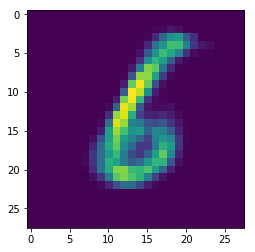

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  5



  0%|          | 1/214 [00:02<09:31,  2.68s/it]

[7 5 9 5 4 7 4 2 3 4 4 2 6 9 3 2 9 4 3 7 0 9 3 6 1 0 9 1 1 3 7 4 4 9 2 0 3
 8 6 3 9 9 7 0 9 2 1 6 7 7 1 3 4 4 8 6 9 4 3 1 2 1 0 3 1 4 5 8 2 9 9 0 3 8
 5 9 4 9 7 2 8 2 5 9 5 3 5 0 0 3 3 4 8 6 1 8 6 4 2 4 1 1 0 1 2 5 0 4 6 1 3
 5 1 3 4 4 3 5 3 2 4 3 3 5 3 0 7 3 6 9 2 1 0 1 9 3 7 2 1 6 9 6 8 0 3 8 8 9
 7 5 1 8 3 4 8 8 4 8 2 2 8 0 1 3 6 1 4 0 6 5 6 1 1 9 1 5 8 7 3 9 8 5 8 1 9
 8 2 4 0 1 2 7 7 6 0 1 8 7 6 1 1 7 5 4 1 5 3 6 8 3 8 0 8 0 8 0 8 7 4 5 6 2
 4 0 9 9 3 3 4 0 5 6 0 6 6 7 9 8 0 4 7 5 9 7 5 4 8 3 7 9 3 6 9 8 0 7]
[7 5 9 5 4 7 4 2 3 4 4 2 6 9 3 2 9 4 3 7 0 9 3 6 1 0 9 1 1 3 7 4 4 9 2 0 3
 8 6 3 9 9 7 0 9 2 1 6 7 7 1 3 4 4 8 6 9 4 3 1 2 1 0 3 1 4 5 8 2 9 9 0 3 8
 5 9 4 9 7 2 8 2 5 9 5 3 5 0 0 3 3 4 8 6 1 8 6 4 2 4 1 1 0 1 2 5 0 4 6 1 3
 5 1 3 4 4 3 5 3 2 4 3 3 5 3 0 7 3 6 9 2 1 0 1 9 3 7 2 1 6 9 6 8 0 3 8 8 9
 7 5 1 8 3 4 8 8 4 8 2 2 8 0 1 3 6 1 4 0 6 5 6 1 1 9 1 5 8 7 3 9 8 5 8 1 9
 8 2 4 0 1 2 7 7 6 0 1 8 7 6 1 1 7 5 4 1 5 3 6 8 3 8 0 8 0 8 0 8 7 4 5 6 2
 4 0 9 9 3 3 4 0 5 6 0 6 6 7 9


  1%|          | 2/214 [00:05<09:30,  2.69s/it]

[4 7 9 6 1 9 4 9 6 8 7 8 8 6 3 4 8 8 9 1 1 7 4 9 7 8 3 8 1 4 0 7 0 0 5 6 1
 9 5 3 9 7 9 5 4 9 4 4 4 4 0 1 6 0 1 7 5 6 0 3 8 9 4 5 3 0 2 6 5 1 9 9 1 9
 9 9 1 5 0 8 6 8 9 7 0 4 3 7 9 2 9 3 1 6 5 5 3 5 1 9 6 4 4 2 9 1 1 7 7 8 6
 6 6 5 9 2 3 6 8 6 3 8 9 7 6 5 5 1 5 5 8 7 9 8 1 2 4 1 1 5 7 1 2 6 9 3 1 9
 8 5 4 4 9 7 1 4 3 6 6 0 6 7 8 9 9 6 8 3 6 3 5 5 9 3 5 5 6 4 8 8 3 9 8 2 4
 2 4 9 5 4 1 9 5 7 9 3 0 4 5 1 1 0 6 1 4 7 6 5 1 1 1 9 5 2 5 6 0 5 8 4 1 7
 6 0 5 3 0 1 6 7 5 0 0 8 1 1 4 6 6 6 8 3 1 5 1 9 7 5 8 0 5 8 1 3 4 4]
[4 7 9 6 1 9 4 9 6 8 7 8 8 6 3 4 8 8 9 1 1 7 4 9 7 8 3 8 1 4 0 7 0 0 5 6 1
 9 5 3 9 7 9 5 4 9 4 4 4 4 0 1 6 0 1 7 5 6 0 3 8 9 4 5 3 0 2 6 5 1 9 9 1 9
 9 9 1 5 0 8 6 8 9 7 0 4 3 7 9 2 9 5 1 6 5 5 3 5 1 9 6 4 4 2 9 1 1 7 7 8 6
 6 6 5 9 2 3 6 8 6 3 8 9 7 6 5 5 1 5 5 8 7 9 8 1 2 4 1 1 5 7 1 2 6 9 3 1 9
 8 5 4 4 9 7 1 4 3 6 6 0 6 7 8 9 9 6 8 3 6 3 5 5 9 3 5 5 6 4 8 8 3 9 8 2 4
 2 4 9 5 4 1 9 5 7 9 3 0 4 5 1 1 0 6 1 4 7 6 5 1 1 1 9 5 2 5 6 0 5 8 4 1 7
 6 0 5 3 0 1 6 7 5 0 0 8 1 1 4


  1%|▏         | 3/214 [00:07<09:21,  2.66s/it]

[1 0 1 4 6 6 0 5 5 9 7 6 7 9 2 7 4 5 3 7 4 7 5 5 9 2 5 0 8 4 8 0 6 8 2 1 5
 4 0 7 5 0 3 8 6 3 8 4 6 3 9 5 1 2 7 3 5 6 3 8 8 9 4 6 8 7 7 6 6 4 7 7 1 5
 7 9 1 1 5 4 4 7 8 8 2 1 3 9 5 2 4 6 5 8 9 0 8 6 9 3 3 6 6 2 6 5 9 9 4 8 3
 6 2 5 9 7 2 2 2 6 4 5 1 5 2 8 4 4 4 7 3 5 3 6 5 1 4 7 6 0 2 1 4 0 1 7 6 9
 7 4 6 6 2 5 1 4 1 8 2 0 2 4 4 6 4 6 7 9 1 0 6 8 6 2 5 5 4 0 5 9 6 0 2 6 8
 3 8 1 4 0 0 1 2 0 2 8 7 0 4 2 4 7 9 8 6 1 9 9 0 1 0 4 0 3 3 3 8 8 4 5 5 9
 5 1 7 1 5 4 1 2 3 5 1 3 6 1 8 7 1 3 2 8 4 8 3 6 1 9 9 0 0 6 8 3 7 8]
[1 0 1 4 6 6 0 5 5 9 7 6 7 9 2 7 4 5 3 7 4 7 5 5 9 2 5 0 8 4 8 0 6 8 2 1 5
 4 0 7 5 0 3 8 6 3 8 4 6 3 9 5 1 2 7 3 5 6 3 8 8 9 4 6 8 7 7 6 6 4 7 7 1 5
 7 9 1 1 5 4 4 7 8 8 2 1 3 9 5 2 4 6 5 8 9 0 8 6 9 3 3 6 6 2 6 5 9 9 4 8 3
 6 2 5 9 7 2 2 2 6 4 5 1 5 2 8 4 4 4 7 3 5 3 6 5 1 4 7 6 0 2 1 4 0 1 7 6 9
 7 4 6 6 3 5 1 4 1 8 2 0 2 4 4 6 4 6 7 9 1 0 6 8 6 2 5 5 4 0 5 9 6 0 2 6 8
 3 8 1 4 0 0 1 2 0 2 8 7 0 4 2 4 7 9 8 6 1 9 9 0 1 0 4 0 3 3 3 8 8 4 5 5 9
 5 1 7 1 5 4 1 2 3 5 1 3 6 1 8


  2%|▏         | 4/214 [00:10<09:16,  2.65s/it]

[1 7 1 6 7 1 8 2 5 8 4 0 4 6 8 6 2 7 4 3 7 4 7 2 3 9 8 7 1 5 1 5 1 5 0 1 3
 1 6 8 6 1 4 5 8 4 4 1 8 1 4 7 9 7 6 5 7 9 7 2 3 5 8 8 0 3 7 2 6 8 2 0 4 1
 1 4 8 3 4 7 3 6 0 3 5 0 4 7 6 1 7 3 7 8 9 2 7 6 2 4 1 3 9 8 5 4 6 3 9 8 3
 7 8 2 6 6 8 4 6 5 3 4 2 2 6 3 3 1 3 1 5 4 8 5 9 1 1 2 0 9 6 4 2 5 4 3 8 9
 2 3 7 8 8 3 1 3 5 8 1 1 7 4 0 9 8 4 6 4 3 0 0 1 9 9 4 1 5 9 9 7 1 5 5 1 1
 8 0 1 4 1 6 4 3 9 0 8 2 9 4 2 6 2 5 9 4 7 7 9 2 6 0 4 3 2 0 9 1 2 1 0 8 4
 6 8 7 3 9 0 6 9 1 5 7 8 2 4 5 9 9 5 3 8 8 8 2 7 1 8 4 3 6 4 6 7 1 7]
[1 7 1 6 7 1 8 2 5 8 4 0 4 6 8 6 2 7 4 3 7 4 7 2 3 9 8 7 1 5 1 5 1 5 0 1 3
 1 6 8 6 1 4 5 8 4 4 1 8 1 4 7 9 7 6 5 7 9 7 2 3 5 8 8 0 3 7 2 6 8 2 0 4 1
 1 4 8 3 4 7 3 6 0 3 5 0 4 7 6 1 7 3 7 8 9 2 7 6 2 4 1 3 9 8 5 4 6 3 9 8 3
 7 8 2 6 6 8 4 6 5 3 4 2 2 6 3 3 1 3 1 5 4 8 5 9 1 1 2 0 9 6 4 2 5 4 3 8 9
 2 3 7 8 8 3 1 3 5 8 1 1 7 4 0 9 8 4 6 4 3 0 0 1 9 9 4 1 5 9 9 7 1 5 5 1 1
 8 0 1 4 1 6 4 3 9 0 8 2 9 4 2 6 2 5 9 4 7 7 9 2 6 0 4 3 2 0 9 1 2 1 0 8 4
 6 8 7 3 9 0 6 9 1 5 7 8 2 4 5


  2%|▏         | 5/214 [00:13<09:13,  2.65s/it]

[6 9 3 0 7 1 2 7 0 9 0 5 0 2 8 4 3 8 4 6 3 2 2 0 9 1 4 5 1 5 4 9 0 8 9 4 6
 6 0 8 2 0 1 6 6 4 0 7 5 5 7 4 7 2 2 5 7 8 1 3 0 2 7 3 2 7 8 9 4 1 6 4 5 0
 6 3 4 7 7 4 8 8 2 8 4 7 4 3 5 6 1 5 9 4 4 5 4 8 3 4 1 1 0 5 7 9 6 5 9 9 5
 8 2 1 4 4 9 1 5 2 4 0 0 0 2 7 9 1 9 3 1 9 2 6 4 5 4 9 7 3 1 9 1 1 1 1 3 4
 6 5 0 8 8 3 1 8 2 3 9 2 8 1 2 1 6 6 9 6 8 5 3 9 8 0 4 9 7 8 5 3 6 1 9 3 0
 1 8 5 1 3 2 7 0 1 3 1 2 9 0 6 9 6 3 8 1 7 9 0 1 5 4 0 7 9 5 1 0 3 9 7 0 2
 0 2 5 4 1 6 5 1 4 9 0 2 5 3 3 7 4 0 1 4 2 0 5 2 5 3 1 8 5 2 0 6 0 3]
[6 9 3 0 7 1 2 7 0 9 0 5 0 2 8 4 3 8 4 6 3 2 2 0 9 1 4 5 1 5 4 9 0 8 9 4 6
 6 0 8 2 0 1 6 6 4 0 7 5 5 7 4 7 3 2 5 7 8 1 3 0 2 7 3 2 7 9 9 4 1 6 4 5 0
 6 3 4 7 7 4 8 8 2 8 4 7 4 3 5 6 1 5 9 4 4 5 4 8 3 4 1 1 0 5 7 9 6 5 9 9 5
 8 2 1 4 4 9 1 5 2 4 0 0 0 2 7 9 1 9 3 1 9 2 6 4 5 4 9 7 3 1 9 1 1 1 1 3 4
 6 5 0 8 8 3 1 8 2 3 9 2 8 1 2 1 6 6 9 6 8 5 3 9 8 0 4 9 7 8 5 3 6 1 9 3 0
 1 8 5 1 3 1 7 0 1 3 1 2 9 0 6 9 6 3 8 1 7 9 0 1 5 4 0 7 9 5 1 0 3 9 7 0 2
 0 2 5 4 1 6 5 1 4 9 0 2 5 3 3


  3%|▎         | 6/214 [00:15<09:08,  2.64s/it]

[2 3 8 3 6 1 9 8 7 6 1 7 3 7 9 9 5 3 8 0 9 1 0 2 5 9 5 9 8 9 0 9 3 2 6 2 5
 2 2 3 7 0 4 2 6 5 0 6 2 4 0 0 2 2 1 0 0 9 2 5 5 4 1 9 5 7 4 8 2 3 0 7 4 9
 6 8 7 2 9 8 0 3 2 7 2 9 9 4 5 1 1 1 1 6 1 4 0 3 0 3 4 7 0 1 4 7 6 0 2 0 7
 8 7 5 7 1 6 5 2 6 6 5 1 9 9 0 1 1 9 8 5 2 2 2 4 5 9 1 6 5 1 9 8 5 7 6 6 4
 3 4 6 1 0 1 9 0 5 8 1 9 8 9 8 0 9 1 2 6 1 6 3 7 4 5 4 7 2 9 5 5 8 6 9 2 2
 6 4 4 8 5 0 8 7 2 2 7 0 9 7 7 8 2 1 8 4 1 2 2 0 5 6 1 9 6 1 7 3 9 8 1 7 8
 9 4 8 8 2 3 5 0 7 4 8 2 7 1 2 0 1 6 3 8 0 1 6 1 5 8 1 4 0 8 4 7 4 3]
[2 3 8 3 6 1 9 8 7 6 1 7 3 7 9 9 5 3 8 0 9 1 0 2 5 9 5 9 8 9 0 9 3 2 6 2 5
 2 2 3 7 0 4 2 6 5 0 6 2 4 0 0 2 2 1 0 0 9 2 5 5 4 1 3 5 7 4 8 2 3 0 7 4 9
 6 8 7 2 9 8 0 3 2 7 2 9 9 4 5 1 1 1 1 6 1 4 0 3 0 3 4 7 0 1 4 7 6 0 2 0 7
 8 7 5 7 1 6 5 2 6 6 5 1 9 9 0 1 1 9 8 5 2 2 2 4 5 9 1 6 5 1 9 8 5 7 6 6 4
 3 4 6 1 0 1 9 0 5 8 1 9 8 9 8 0 9 1 2 6 1 6 3 7 4 5 4 7 2 9 5 5 8 6 9 2 2
 6 4 4 8 5 0 8 7 2 2 7 0 9 7 7 8 2 1 8 4 1 2 2 0 5 6 1 9 6 1 7 3 9 8 1 7 8
 9 4 8 8 2 3 5 0 7 4 8 2 7 1 2


  3%|▎         | 7/214 [00:18<09:07,  2.65s/it]

[8 5 0 9 2 1 4 5 7 5 4 9 8 1 1 6 0 6 2 9 3 5 3 0 7 2 0 1 2 6 5 8 1 3 5 0 3
 2 0 2 6 7 2 4 4 9 7 5 0 3 8 4 1 7 3 4 9 3 9 1 2 2 3 2 6 2 9 7 4 1 4 0 3 6
 7 4 7 9 1 9 7 6 8 0 1 0 7 3 2 2 1 5 9 4 9 3 7 8 9 8 3 7 0 5 3 7 1 0 9 5 6
 4 2 1 4 1 9 3 7 1 3 9 7 3 3 5 8 9 1 4 8 9 7 4 4 3 8 2 3 7 4 3 2 8 5 1 1 2
 0 3 5 9 3 6 9 5 3 7 6 9 2 2 7 4 1 7 3 8 5 9 5 7 0 7 8 1 6 4 3 2 6 4 1 9 0
 4 8 1 1 3 9 8 5 3 7 8 6 2 1 2 9 9 4 9 4 2 5 3 7 6 5 2 7 4 1 7 5 3 6 1 7 6
 8 8 5 7 2 9 2 7 9 3 4 7 5 6 6 8 8 5 0 1 3 9 6 2 1 0 4 6 7 1 2 2 0 1]
[8 5 0 9 2 1 4 5 7 5 4 9 8 1 1 6 0 6 2 9 3 5 3 0 7 2 0 1 2 6 5 8 1 3 5 0 3
 2 0 2 6 7 2 4 4 9 7 5 0 3 8 4 1 7 3 4 9 3 9 1 2 2 3 2 6 2 9 7 4 1 4 0 3 6
 7 4 7 9 1 9 7 6 8 0 1 0 7 3 2 2 1 5 9 4 9 3 7 8 9 8 3 7 0 5 3 7 1 0 9 5 6
 4 2 1 4 1 9 3 7 1 3 9 7 3 3 5 8 9 1 4 8 9 7 4 4 3 8 2 3 7 4 3 2 8 5 1 1 2
 0 3 5 9 3 6 9 5 3 7 6 9 2 2 7 4 1 7 3 8 5 9 5 7 0 7 8 1 6 4 3 2 6 4 1 9 0
 4 8 1 1 3 9 8 5 3 7 8 6 2 1 2 9 9 4 9 4 2 5 3 7 6 5 2 7 4 1 7 5 3 6 1 7 6
 8 8 5 7 2 9 2 7 9 3 4 7 5 6 6


  4%|▎         | 8/214 [00:21<09:03,  2.64s/it]

[4 1 4 9 8 8 1 0 7 0 4 7 2 0 5 3 1 1 6 1 8 2 9 1 1 1 0 2 5 2 6 9 3 5 2 9 6
 1 7 5 0 5 4 6 8 9 6 5 5 6 8 2 9 0 2 5 7 7 2 0 9 7 5 0 0 7 5 0 5 7 2 9 4 7
 1 6 9 3 7 4 5 4 0 5 5 1 6 6 4 8 3 8 9 1 7 5 6 2 3 6 1 3 6 2 9 0 1 2 1 1 1
 6 3 5 2 1 1 3 7 4 8 5 8 5 8 9 1 7 1 9 1 8 4 2 8 7 3 4 2 1 0 8 9 2 5 9 4 9
 2 9 1 0 1 3 2 7 4 2 6 5 6 8 9 0 6 7 5 2 0 8 7 2 5 2 0 9 1 0 8 7 7 0 6 1 2
 8 3 9 2 2 6 7 9 4 2 9 1 7 6 5 9 7 2 4 6 4 0 8 9 2 9 7 2 1 8 9 0 2 2 5 6 5
 3 2 3 4 0 3 7 6 9 5 0 6 6 9 8 5 5 1 1 2 7 2 2 7 5 9 2 8 2 5 1 3 3 8]
[4 1 4 9 8 8 1 0 7 0 4 7 2 0 5 3 1 1 6 1 8 2 9 1 1 1 0 2 5 2 6 9 3 5 2 9 6
 1 7 5 0 5 4 6 8 9 6 5 5 6 8 2 9 0 2 5 7 7 2 0 9 7 5 0 0 7 5 0 5 7 2 9 4 7
 1 6 9 3 7 4 5 4 0 5 5 1 6 6 4 8 3 8 9 1 7 5 6 2 3 6 1 3 6 2 7 0 1 2 1 1 1
 6 3 5 2 1 1 3 7 4 8 5 8 5 8 9 1 7 1 9 1 8 4 2 8 7 3 4 2 1 0 8 9 2 5 9 4 9
 2 9 1 0 1 3 2 7 4 2 6 5 6 8 9 0 6 7 5 2 0 8 7 2 5 2 0 9 1 0 8 7 7 0 6 1 2
 8 3 9 2 2 6 7 9 4 2 9 1 7 6 5 9 7 2 4 6 4 0 8 9 2 9 7 2 1 8 9 0 2 2 5 6 5
 3 2 3 4 0 3 7 6 9 5 0 6 6 9 8


  4%|▍         | 9/214 [00:23<09:00,  2.64s/it]

[8 5 6 3 9 3 7 3 8 2 2 3 0 2 5 3 1 3 5 2 9 9 7 3 0 3 1 6 7 3 4 2 2 7 2 1 6
 3 7 1 0 9 4 1 2 6 6 2 4 1 0 2 7 1 6 2 7 3 4 3 5 5 5 2 7 2 7 3 5 1 6 8 3 6
 2 1 9 6 2 2 3 9 1 1 2 4 2 7 5 2 1 7 8 4 6 3 9 3 5 5 3 9 4 4 9 1 4 7 0 1 7
 7 8 4 9 0 9 1 0 7 1 9 6 7 0 4 0 6 4 4 9 3 0 5 7 9 9 6 2 3 1 9 8 6 7 0 1 4
 1 3 1 3 6 9 3 5 5 1 5 3 6 9 2 2 1 8 9 4 4 3 0 3 1 2 7 4 7 2 2 2 5 2 1 5 6
 1 8 1 9 8 5 9 1 8 6 0 6 0 4 7 2 1 5 0 9 6 7 0 5 4 2 9 6 0 3 8 7 6 7 9 3 5
 0 1 2 3 3 9 2 1 5 4 3 6 9 8 0 7 0 6 3 3 0 2 3 5 7 1 8 9 7 9 1 8 0 6]
[8 5 6 3 4 3 7 3 8 2 2 3 0 2 5 3 1 3 5 2 9 9 7 3 0 3 1 6 7 3 4 2 2 7 2 1 6
 3 7 1 0 9 4 1 2 6 6 2 4 1 0 2 7 1 6 2 7 3 4 3 5 5 5 2 7 2 7 3 5 1 6 8 3 6
 2 1 9 6 2 2 3 9 1 1 2 4 2 7 5 2 1 7 8 4 6 3 9 3 5 5 3 9 4 4 9 1 4 7 0 1 7
 7 8 4 9 0 9 1 0 7 1 9 6 7 0 4 0 6 4 4 9 3 0 5 7 9 9 6 2 3 1 9 8 6 7 0 1 4
 1 3 1 3 6 9 3 5 5 1 5 3 6 9 2 2 1 8 9 4 4 3 0 3 1 2 7 4 7 2 2 2 5 2 1 5 6
 1 8 1 9 8 5 9 1 8 6 0 6 0 4 7 2 1 5 0 9 6 7 0 5 4 2 9 6 0 3 8 7 6 7 9 3 5
 0 1 2 3 3 9 2 1 5 4 3 6 9 8 0


  5%|▍         | 10/214 [00:26<08:57,  2.63s/it]

[4 7 6 9 4 9 9 4 5 5 4 7 7 6 8 3 4 3 5 7 8 2 5 5 2 2 0 5 6 1 6 7 5 8 6 4 7
 1 2 7 9 1 3 6 1 5 5 6 4 9 1 1 3 7 0 4 4 4 2 3 2 8 8 5 4 5 1 6 6 4 7 4 9 7
 0 6 8 4 1 2 6 8 4 2 9 5 7 7 7 2 7 6 7 2 5 4 8 6 6 4 3 6 5 1 0 9 2 2 8 7 8
 0 6 0 2 3 3 6 7 1 1 6 8 5 3 4 4 7 1 4 6 1 2 4 8 5 9 4 2 4 6 1 3 9 7 2 1 7
 2 2 3 1 4 6 8 1 4 9 8 1 8 7 0 9 0 3 1 9 2 1 0 4 8 4 6 0 2 4 6 5 4 3 9 2 8
 2 9 1 0 4 1 3 8 4 7 8 8 6 4 4 7 9 4 6 6 4 9 4 3 0 4 2 4 1 9 1 2 2 8 2 4 6
 3 8 3 1 1 2 0 2 7 8 7 0 4 5 4 0 8 9 3 4 9 3 6 5 9 4 2 6 9 8 1 4 0 7]
[4 7 6 9 4 9 9 4 5 5 4 7 7 6 8 3 4 3 5 7 8 2 5 5 2 2 0 5 6 1 6 7 5 8 6 4 7
 1 2 7 9 1 3 6 1 5 5 6 4 9 1 1 3 7 0 4 4 4 2 3 2 8 8 5 4 5 1 6 6 4 7 4 9 7
 0 6 8 4 1 2 6 8 4 2 9 5 7 7 7 2 7 6 7 2 5 4 8 6 6 4 3 6 5 1 0 9 2 2 8 7 8
 0 6 0 2 3 3 6 7 1 1 6 8 5 3 4 4 7 1 4 6 1 2 4 8 5 9 4 2 4 6 1 3 9 7 2 1 7
 2 2 3 1 4 6 8 1 4 9 8 1 8 7 0 9 0 3 1 9 2 1 0 4 8 4 6 0 2 4 6 5 4 3 9 2 8
 2 9 1 0 4 1 3 8 4 7 8 8 6 4 4 7 9 4 6 6 4 9 4 3 0 4 2 4 1 9 1 2 2 8 2 4 6
 3 8 3 1 1 2 0 2 7 8 7 0 4 5 4


  5%|▌         | 11/214 [00:29<08:55,  2.64s/it]

[1 2 5 2 1 6 0 7 6 0 5 4 8 1 7 6 0 3 2 9 6 2 9 8 3 5 8 4 2 5 9 9 4 3 3 7 7
 8 6 4 9 7 4 9 6 3 4 8 4 9 6 0 9 7 4 4 3 9 0 7 2 2 8 8 1 6 7 8 7 1 6 1 8 1
 0 9 3 0 7 6 9 9 2 5 7 3 9 1 4 1 9 0 7 0 5 3 5 7 4 3 9 5 2 7 1 6 5 3 9 0 2
 1 2 1 2 3 3 6 5 2 1 1 5 0 1 8 5 6 3 0 7 2 3 0 1 1 4 9 3 7 6 9 8 5 9 1 6 5
 3 5 6 1 0 5 8 0 6 7 6 9 5 6 8 0 8 7 7 6 3 8 5 7 9 4 1 7 3 2 0 1 3 9 8 1 7
 9 8 7 3 8 1 2 0 1 6 3 1 7 4 1 2 2 4 0 6 3 9 0 0 0 5 0 5 2 8 3 8 4 4 2 1 7
 4 1 0 1 1 3 4 9 4 3 3 6 1 7 3 1 5 2 2 4 0 4 1 8 4 1 7 6 5 7 0 4 4 4]
[1 2 5 2 1 6 0 7 6 0 5 4 8 1 7 6 0 3 2 9 6 2 9 8 3 5 8 4 2 5 9 9 4 3 3 7 7
 8 6 4 9 7 4 9 6 3 4 8 4 9 6 0 9 7 4 4 3 9 0 7 2 2 8 8 1 6 7 8 7 1 6 1 8 1
 0 9 3 0 7 4 9 9 2 5 7 3 9 1 4 1 9 0 7 0 5 3 5 7 4 3 9 5 2 7 1 6 5 3 9 0 2
 1 2 1 2 3 3 6 5 2 1 1 5 0 1 8 5 6 3 0 7 2 3 0 1 1 4 9 3 7 6 9 8 5 9 1 6 5
 3 5 6 1 0 5 8 0 6 7 6 9 5 6 8 0 8 7 7 6 3 8 5 7 9 4 1 7 3 2 0 1 3 9 8 1 7
 9 8 7 3 8 1 2 0 1 6 3 1 7 4 8 2 2 4 0 6 3 9 0 0 0 5 0 5 2 8 3 8 4 4 2 1 7
 4 1 0 1 1 3 4 9 4 3 3 6 1 7 3


  6%|▌         | 12/214 [00:31<08:55,  2.65s/it]

[8 2 9 1 6 7 8 0 8 0 2 2 5 5 4 6 6 3 0 3 3 7 5 0 1 1 1 7 7 0 9 9 3 3 0 8 8
 9 2 5 8 8 1 7 6 8 9 7 3 7 7 4 4 6 0 0 5 4 2 0 2 9 3 2 4 0 5 9 8 3 5 1 3 5
 2 8 2 9 8 6 9 4 3 6 8 1 1 3 5 3 9 8 9 7 5 9 9 4 8 7 7 0 5 5 0 6 5 0 5 1 1
 2 8 1 9 3 5 0 3 1 5 1 4 2 6 4 4 9 6 1 6 1 5 5 9 1 5 6 4 1 2 7 3 6 8 7 0 7
 2 7 0 5 8 6 6 1 8 8 5 3 3 7 9 3 0 2 3 0 8 7 9 7 8 8 5 0 5 9 3 2 8 5 9 8 4
 4 6 9 4 5 6 5 6 6 4 7 9 3 3 1 0 0 3 0 9 3 0 9 8 5 9 0 1 7 3 1 2 0 9 4 7 8
 3 8 1 3 4 4 1 8 1 2 2 4 7 5 8 1 2 4 0 5 2 2 0 0 0 6 6 3 5 6 4 3 1 3]
[8 2 9 1 6 7 8 0 8 0 2 2 5 5 4 6 6 3 0 3 3 7 5 0 1 1 1 7 7 0 9 9 3 3 0 8 8
 9 2 5 8 8 1 7 6 8 9 7 3 7 7 4 4 6 0 0 5 4 2 0 2 9 3 2 4 0 5 9 8 3 5 1 3 5
 2 8 2 9 8 6 9 4 3 6 8 1 1 3 5 3 9 8 9 7 5 9 9 4 8 7 7 0 5 5 0 6 5 0 5 1 1
 2 8 1 9 3 5 0 3 1 5 1 4 2 6 4 4 9 6 1 6 1 5 5 9 1 5 6 4 1 2 7 3 6 8 7 0 7
 2 7 0 5 8 6 6 1 8 8 5 3 3 7 9 3 0 2 3 0 8 7 9 7 8 8 5 0 5 9 3 2 8 5 9 8 4
 4 6 9 4 5 6 5 6 6 4 7 9 3 3 1 0 0 3 0 9 3 0 9 8 5 9 0 1 7 3 1 2 0 9 4 7 8
 3 8 1 3 4 4 1 8 1 2 2 4 7 5 8


  6%|▌         | 13/214 [00:34<08:52,  2.65s/it]

[7 0 1 4 9 2 7 2 7 7 0 7 3 8 9 8 8 9 1 2 3 9 1 6 4 5 8 6 4 6 3 2 8 1 6 0 3
 7 8 6 3 7 6 2 6 5 1 0 9 2 1 9 2 3 2 3 2 7 5 4 5 2 1 6 4 8 5 0 1 4 5 3 4 3
 4 0 8 7 1 2 2 1 0 2 3 5 1 6 0 7 8 1 8 1 2 9 6 5 3 5 9 8 9 2 3 6 2 4 0 3 8
 4 5 1 5 4 4 9 1 4 8 8 3 4 0 3 6 7 7 6 6 6 0 9 9 6 8 2 3 6 6 8 7 5 9 3 1 9
 2 8 2 8 0 3 4 9 7 1 7 5 4 7 9 7 2 6 6 1 3 2 6 6 5 2 1 6 5 9 1 8 2 1 1 0 6
 2 1 8 7 2 2 8 2 0 8 0 4 9 9 5 0 7 0 1 7 8 0 9 4 9 2 2 7 7 8 7 7 7 7 8 6 0
 1 3 7 0 0 9 9 4 9 1 0 2 8 8 2 0 5 3 1 2 4 0 6 1 3 4 6 1 5 4 0 6 3 0]
[7 0 1 4 9 2 7 2 7 7 0 7 3 8 9 8 8 9 1 2 3 9 1 6 4 5 8 6 4 6 3 2 8 1 6 0 3
 7 8 6 3 7 6 2 6 5 1 0 9 2 1 9 2 3 2 3 2 7 5 4 5 2 1 6 4 8 5 0 1 4 5 3 4 3
 4 0 7 7 1 2 2 1 0 2 3 5 1 6 0 7 8 1 8 1 2 9 6 5 3 5 9 8 9 2 3 6 2 4 0 3 8
 4 5 1 5 4 4 9 1 4 8 8 3 4 0 3 6 7 7 6 6 6 0 9 9 6 8 2 3 6 6 8 7 5 9 3 1 9
 2 8 2 8 0 3 4 9 7 1 7 5 4 7 9 7 2 6 6 1 3 2 6 6 5 2 1 6 5 9 1 8 2 1 1 0 6
 2 1 8 7 2 2 8 2 0 8 0 4 9 9 5 0 7 0 1 7 8 0 9 4 9 2 2 7 7 8 7 7 7 7 8 6 0
 1 3 7 0 0 9 9 4 9 1 0 2 8 8 2


  7%|▋         | 14/214 [00:37<08:48,  2.64s/it]

[7 2 7 4 2 6 0 4 5 2 2 2 4 1 0 0 6 1 7 8 1 3 1 4 5 1 9 3 4 8 8 1 5 6 2 6 2
 3 0 0 3 8 0 1 3 7 0 2 5 0 8 4 0 2 2 2 4 9 1 4 8 4 0 4 4 5 3 5 9 3 4 1 8 5
 9 8 3 1 4 0 2 1 2 1 5 0 0 6 8 6 9 3 9 7 2 5 2 1 4 2 3 5 0 7 3 7 6 9 7 1 1
 9 5 5 8 7 6 0 8 5 8 2 7 6 2 5 6 2 1 4 4 1 8 6 1 7 7 2 3 6 2 7 7 8 5 5 4 9
 5 6 7 7 9 2 1 9 9 0 4 1 1 2 8 5 8 9 2 1 0 0 5 5 1 3 7 2 0 1 6 8 2 3 1 9 1
 2 0 1 7 0 0 6 8 4 7 0 6 0 2 4 0 7 8 1 9 1 6 7 1 7 2 5 3 0 3 0 7 5 2 3 0 7
 7 4 4 0 5 6 0 2 0 5 2 6 6 0 3 9 1 8 7 5 2 4 8 1 5 8 2 0 5 7 4 2 3 4]
[7 2 7 4 2 6 0 4 5 2 2 2 4 1 0 0 6 1 7 8 1 3 1 4 5 1 9 3 4 8 8 1 5 6 2 6 2
 3 0 0 3 8 0 1 3 7 0 2 5 0 8 4 0 2 2 2 4 9 1 4 8 4 0 4 6 5 3 5 9 3 4 1 8 5
 9 8 3 1 4 0 2 1 2 1 5 0 0 6 8 6 9 3 9 7 2 5 2 1 4 2 3 5 0 7 3 7 6 9 7 1 1
 9 5 5 8 7 6 0 8 5 8 2 7 6 2 5 6 2 1 4 4 1 8 6 1 7 7 2 3 6 2 7 7 8 5 5 4 9
 5 6 7 7 9 2 1 9 9 0 4 1 1 2 8 5 8 9 2 1 0 0 5 5 1 3 7 2 0 1 6 8 2 3 1 9 1
 2 0 1 7 0 0 6 8 4 7 0 6 0 2 4 0 7 8 1 9 1 6 7 1 7 2 5 3 0 3 0 7 5 2 3 0 7
 7 4 4 0 5 6 0 2 0 5 2 6 6 0 3


  7%|▋         | 15/214 [00:39<08:46,  2.65s/it]

[1 5 4 8 6 5 3 2 8 4 8 2 8 3 6 8 5 3 2 9 1 5 8 5 2 6 0 8 2 5 1 9 0 1 0 6 0
 7 3 4 7 2 0 2 4 8 3 8 6 7 8 0 1 7 8 9 1 3 7 7 5 4 8 8 0 6 5 0 5 8 8 6 3 0
 2 1 9 8 0 8 7 1 4 6 3 2 9 5 7 3 3 6 3 2 2 0 5 1 6 5 7 5 7 7 5 9 0 0 4 5 8
 1 6 0 9 0 9 1 4 3 7 3 2 4 1 1 0 0 8 4 2 9 0 7 6 4 6 8 4 7 9 1 0 4 6 4 6 3
 6 2 9 7 2 6 6 6 6 6 9 0 5 9 7 6 9 8 8 7 3 5 6 3 8 7 5 6 4 5 1 9 0 5 8 7 2
 9 3 8 4 5 1 6 1 3 2 5 3 0 4 9 5 1 7 2 4 7 1 4 1 9 8 7 1 2 0 4 5 7 7 9 2 7
 2 7 4 2 3 8 3 2 2 3 6 8 4 7 9 4 0 5 3 0 7 6 1 5 6 7 4 5 0 6 8 2 5 4]
[1 5 4 8 6 5 3 2 8 4 8 2 8 3 6 8 5 3 2 9 1 5 8 5 2 6 0 8 2 5 1 9 0 1 0 6 0
 7 3 4 7 2 0 2 4 8 3 8 6 7 8 0 1 7 8 9 1 3 7 7 5 4 8 8 0 6 5 0 5 8 8 6 3 0
 2 1 9 8 0 8 7 1 4 6 3 2 9 5 7 3 3 6 3 2 2 0 5 1 6 5 7 5 7 7 5 9 0 0 4 5 8
 1 6 0 9 0 9 1 4 3 7 3 2 4 1 1 0 0 8 4 2 9 0 7 6 4 6 8 4 7 9 1 0 4 6 4 6 3
 6 2 9 7 2 6 6 6 6 6 9 0 5 9 7 6 9 8 8 7 3 5 6 3 8 7 5 6 4 5 1 9 0 5 8 7 2
 9 3 8 4 5 1 6 1 3 2 5 3 0 4 9 5 1 7 2 4 7 1 4 1 9 8 7 1 2 0 4 5 7 7 9 2 7
 2 7 4 2 3 8 3 2 2 3 6 8 4 7 9


  7%|▋         | 16/214 [00:42<08:44,  2.65s/it]

[0 2 4 5 7 5 1 1 4 1 5 8 9 7 2 8 6 5 6 0 9 8 2 3 6 5 9 3 6 2 6 4 5 5 2 5 9
 2 4 3 3 4 2 4 9 3 1 6 0 2 5 2 8 4 9 9 0 7 9 7 4 1 2 3 7 1 1 5 4 6 0 5 3 1
 0 0 9 3 9 1 2 9 8 7 1 0 6 8 3 3 2 0 4 5 3 3 3 8 5 1 9 3 0 9 0 1 1 7 8 5 7
 5 8 5 3 5 3 2 4 9 8 1 4 0 7 2 3 6 4 0 6 4 6 8 4 4 1 7 5 3 1 4 3 0 7 1 7 5
 3 1 7 3 2 3 1 5 4 8 7 1 1 4 8 5 4 6 4 8 9 4 3 6 4 7 5 6 3 2 8 7 7 3 8 1 3
 7 4 5 7 4 4 6 7 8 5 7 4 0 5 3 3 2 5 3 9 8 8 6 6 9 2 1 8 5 6 0 9 6 7 7 3 1
 0 3 0 8 7 2 0 6 4 5 1 4 8 1 1 0 1 3 6 9 0 2 9 0 4 0 5 0 9 1 7 9 3 4]
[0 2 4 5 7 5 1 1 4 1 5 8 9 7 2 8 6 5 6 0 9 8 2 3 6 5 9 3 6 2 6 4 5 5 2 5 9
 2 4 3 3 4 2 4 9 3 1 6 0 2 5 2 8 4 9 9 0 7 9 7 4 1 2 3 7 1 1 5 4 6 0 5 3 1
 0 0 9 3 9 1 2 9 8 7 1 0 6 8 3 3 2 0 4 5 3 3 3 8 5 1 9 3 0 9 0 1 1 7 8 5 7
 5 8 5 3 5 3 1 4 9 8 1 4 0 7 2 3 6 4 0 6 4 6 8 4 4 1 7 5 3 1 4 3 0 7 1 7 5
 3 1 7 3 2 3 1 5 4 8 7 1 1 4 8 5 4 6 4 8 9 4 3 6 4 7 5 6 3 2 8 7 7 3 8 1 3
 7 4 5 7 4 4 6 7 8 5 7 4 0 5 3 3 2 5 3 9 8 8 6 6 9 2 1 8 5 6 0 9 6 7 7 3 1
 0 3 0 8 7 2 0 6 4 5 1 4 8 1 1


  8%|▊         | 17/214 [00:45<08:41,  2.65s/it]

[3 7 6 7 4 0 6 1 9 0 4 6 3 5 2 2 7 6 3 0 9 0 7 5 5 3 4 2 4 4 3 4 3 1 8 9 8
 9 6 3 3 0 3 2 5 4 7 5 2 6 7 4 4 1 2 7 8 6 2 0 5 0 0 7 1 1 2 0 3 0 7 3 8 9
 8 9 9 9 4 6 9 8 7 5 9 2 3 7 8 8 0 8 2 1 5 3 2 2 5 6 7 2 5 1 9 2 2 7 0 0 6
 3 2 8 8 5 1 1 1 5 7 1 0 0 2 3 9 1 1 6 4 8 6 7 5 6 4 7 8 2 3 7 8 0 8 3 7 3
 9 2 7 6 9 5 5 4 2 0 9 2 2 3 2 4 6 1 8 7 5 6 8 3 9 4 1 8 4 2 8 8 9 4 4 4 1
 4 2 5 8 7 5 9 5 8 3 1 8 3 0 7 4 7 8 1 2 5 8 3 6 1 2 6 5 3 0 7 7 4 7 6 3 1
 9 2 8 8 6 9 7 7 7 0 5 7 8 2 0 6 2 5 4 0 3 9 7 9 3 9 2 6 1 1 0 3 3 9]
[3 7 6 7 4 0 6 1 9 0 4 6 3 5 2 2 7 6 3 0 9 0 7 5 5 3 4 2 4 4 3 4 3 1 8 9 8
 9 6 3 3 0 3 2 5 4 7 5 2 6 7 4 4 1 2 7 8 6 2 0 5 0 0 7 1 1 2 0 3 0 7 3 8 9
 8 9 9 9 4 6 9 8 7 5 9 2 3 7 8 8 0 8 2 1 5 3 2 2 5 6 7 2 5 1 9 2 2 7 0 0 6
 3 2 8 8 5 1 1 1 5 7 1 0 0 2 3 9 1 1 6 4 8 6 7 5 6 4 7 8 2 3 7 8 0 8 3 7 3
 9 2 7 6 9 5 5 4 2 0 9 2 2 3 2 4 6 1 8 7 5 6 8 3 9 4 1 8 4 2 8 8 9 4 4 4 1
 4 2 5 8 7 5 9 5 8 3 1 8 3 0 7 4 7 8 1 2 5 8 3 6 1 2 6 5 3 0 7 7 4 7 6 3 1
 9 2 8 8 6 9 7 7 7 0 5 7 8 2 0


  8%|▊         | 18/214 [00:47<08:38,  2.64s/it]

[4 7 4 0 1 3 1 7 8 5 8 5 0 3 8 9 4 8 1 1 8 8 0 9 1 3 7 4 6 7 0 7 7 9 3 1 3
 3 6 9 3 8 9 5 3 7 0 5 2 0 2 8 2 7 0 1 6 6 8 9 9 3 1 7 2 7 6 8 3 6 9 5 4 9
 9 8 6 4 0 7 9 0 8 1 1 9 1 5 6 4 4 1 8 5 3 4 4 0 7 4 5 8 6 1 0 4 0 3 3 5 6
 5 6 2 1 6 6 9 6 5 2 6 1 6 6 8 2 9 0 7 4 6 2 6 1 6 0 5 3 9 6 1 2 1 8 2 6 9
 9 0 6 6 0 4 8 0 8 0 9 9 4 1 1 7 8 9 5 1 8 8 6 0 6 8 6 9 3 7 4 8 5 8 1 5 7
 2 1 2 9 7 5 5 9 7 1 1 1 8 1 5 8 2 2 7 5 1 1 5 5 3 0 2 1 6 1 3 1 4 6 0 2 1
 7 7 8 7 7 0 3 1 3 4 4 6 3 6 4 0 7 4 9 1 4 7 9 9 4 5 1 1 8 7 5 3 5 2]
[4 7 4 0 1 3 1 7 8 5 8 5 0 3 8 9 4 8 1 1 8 8 0 9 1 3 7 4 6 7 0 7 7 9 3 1 3
 3 6 9 3 8 9 5 3 7 0 5 2 0 2 8 2 7 0 1 6 6 8 9 9 3 1 7 2 7 6 8 3 6 9 5 4 9
 9 8 6 4 0 7 9 0 8 1 1 9 1 5 6 4 4 1 8 5 3 4 4 0 7 4 5 8 6 1 0 4 0 3 3 5 6
 5 6 2 1 6 6 9 6 5 2 6 1 6 6 8 2 9 0 7 4 6 2 6 1 6 0 5 3 9 6 1 2 1 8 2 6 9
 9 0 6 6 0 4 8 0 8 0 9 9 4 1 1 7 8 9 5 1 8 8 6 0 6 8 6 9 3 7 4 8 5 8 1 5 7
 2 1 2 9 7 5 5 9 7 1 1 1 8 1 5 8 2 2 7 5 1 1 5 5 3 0 2 1 6 1 3 1 4 6 0 2 1
 7 7 8 7 7 0 3 1 3 4 4 6 3 6 4


  9%|▉         | 19/214 [00:50<08:34,  2.64s/it]

[2 9 7 0 6 4 5 1 7 5 2 9 6 4 0 9 9 7 0 3 0 8 7 6 1 1 2 3 5 8 0 8 3 2 2 9 3
 0 1 6 1 1 2 5 7 6 7 4 3 6 2 0 0 9 7 8 0 9 4 7 9 7 8 7 1 6 1 3 0 7 6 8 8 7
 5 1 4 2 5 1 4 5 7 6 4 7 3 2 1 8 6 7 3 1 4 0 2 0 1 4 7 5 5 1 6 7 9 3 3 6 1
 3 9 4 7 2 1 9 2 4 5 8 1 2 5 1 9 6 4 8 7 3 4 2 7 3 7 8 8 6 8 6 2 6 9 8 1 3
 0 0 2 1 4 6 9 8 5 6 7 1 3 5 3 3 4 0 0 8 2 6 3 2 7 4 5 2 9 3 0 2 0 9 5 5 6
 7 1 9 0 7 5 4 4 1 4 3 5 7 9 4 3 9 3 0 7 5 2 0 5 3 1 6 9 2 0 4 7 1 0 4 2 7
 7 2 2 6 6 0 1 5 9 0 4 0 3 9 7 2 1 0 1 4 5 2 6 0 8 4 1 0 1 4 8 7 8 3]
[2 9 7 0 6 4 5 1 7 5 2 9 6 4 0 9 9 7 0 3 0 8 7 6 1 1 2 3 5 8 0 8 3 2 2 9 3
 0 1 6 1 1 2 5 7 6 7 4 3 6 2 0 0 9 7 8 0 9 4 7 9 7 8 7 1 6 1 3 0 7 6 8 8 7
 5 1 4 2 5 1 4 5 7 6 4 7 3 2 1 8 6 7 3 1 4 0 2 0 1 4 7 5 5 1 6 7 2 3 3 6 1
 3 9 4 7 2 1 9 2 4 5 8 1 2 5 1 9 6 4 8 7 3 4 2 7 3 7 8 8 6 8 6 2 6 9 8 1 3
 0 0 2 1 4 6 9 8 5 6 7 1 3 5 3 3 4 0 0 8 2 6 3 2 7 4 5 2 9 3 0 2 0 9 5 5 6
 7 1 9 0 7 5 4 4 1 4 3 5 7 9 4 3 9 3 0 1 5 2 0 5 3 1 6 9 2 0 4 7 1 0 4 2 7
 7 2 2 6 6 0 1 5 9 0 4 0 3 9 7


  9%|▉         | 20/214 [00:52<08:32,  2.64s/it]

[7 9 8 6 0 8 7 8 0 2 7 1 6 3 1 4 6 3 2 7 0 9 8 5 6 2 3 6 5 8 8 0 5 1 0 5 6
 2 9 1 0 6 0 1 3 5 3 7 9 4 0 5 2 2 9 7 8 9 9 3 9 5 7 6 9 3 1 2 8 6 0 3 5 1
 9 2 1 5 9 0 0 6 0 7 5 3 1 2 8 9 3 8 1 2 7 2 5 6 0 9 0 4 9 3 8 3 9 0 4 9 5
 4 8 9 2 5 2 3 6 9 5 1 5 5 7 0 8 0 9 3 1 4 4 9 7 3 8 3 2 4 7 9 3 6 9 8 3 0
 6 8 5 9 5 7 5 9 6 2 7 5 8 3 6 9 8 7 2 3 6 4 6 4 6 9 1 5 4 8 2 6 0 7 7 7 8
 8 4 2 4 2 0 1 1 9 5 9 9 0 0 4 6 9 7 5 3 8 0 5 2 0 5 2 4 2 3 5 8 7 7 3 0 5
 1 4 7 7 9 4 1 6 9 5 0 7 8 4 7 0 7 2 7 3 1 3 0 9 9 8 9 1 7 4 0 7 1 7]
[7 9 8 6 0 8 7 8 0 2 7 1 6 3 1 4 6 3 2 7 0 9 8 5 6 2 3 6 5 8 8 0 5 1 0 5 6
 2 9 1 0 6 0 1 3 5 3 7 9 4 0 5 2 2 9 7 8 9 9 3 9 5 7 6 9 3 1 2 8 6 0 3 5 1
 9 2 1 3 9 0 0 6 0 7 5 3 1 2 8 9 3 8 1 2 7 2 5 6 0 9 0 4 9 3 8 3 9 0 4 9 5
 4 8 9 2 5 2 3 6 9 5 1 5 5 7 0 8 0 9 3 1 4 4 9 7 3 8 3 2 4 7 9 3 6 9 8 3 0
 6 8 5 9 5 7 5 9 6 2 7 5 8 3 6 9 8 7 2 3 6 4 6 4 6 9 1 5 4 8 2 6 0 7 7 7 8
 8 4 2 4 2 0 1 1 9 5 9 9 0 0 4 6 9 7 5 3 8 0 5 2 0 5 2 4 2 3 5 8 7 7 3 0 5
 1 4 7 7 9 4 1 6 9 5 0 7 8 4 7


 10%|▉         | 21/214 [00:55<08:29,  2.64s/it]

[4 9 8 4 1 9 5 4 5 2 4 4 3 2 1 1 6 5 7 0 6 0 7 8 3 8 4 1 7 0 0 9 9 8 2 3 8
 1 9 3 1 0 5 7 0 4 5 1 1 7 2 2 9 3 8 2 1 8 9 0 2 8 5 0 5 5 0 7 7 9 2 7 9 1
 1 3 6 2 2 0 8 2 6 5 6 3 1 0 1 0 9 6 1 3 0 7 6 3 2 4 7 0 3 1 3 8 8 5 2 1 3
 7 7 3 1 1 1 6 7 6 1 5 6 8 6 4 2 0 7 5 5 9 7 7 2 4 3 7 8 6 1 7 4 7 4 9 5 8
 3 5 1 8 2 7 2 6 9 2 1 8 9 0 5 6 2 7 4 6 8 2 4 4 7 1 3 6 7 1 4 8 3 7 9 3 3
 6 3 8 0 0 5 9 0 8 2 3 5 2 2 6 9 7 1 0 2 0 9 4 0 8 2 9 9 1 1 9 5 9 0 5 2 1
 9 7 7 6 9 5 2 8 3 9 4 4 3 6 4 3 9 8 1 5 2 6 2 0 0 5 9 9 3 6 0 7 8 9]
[4 9 8 4 1 9 5 4 5 2 4 4 3 2 1 1 6 5 7 0 6 0 7 8 3 8 4 1 7 0 0 9 9 8 2 3 8
 1 9 3 1 0 5 7 0 4 5 1 1 7 2 2 9 3 8 2 1 8 9 0 2 8 5 0 5 5 0 7 7 9 2 7 9 1
 1 3 6 2 2 0 8 2 6 5 6 3 1 0 1 0 9 6 1 3 0 7 6 3 2 4 7 0 3 1 3 8 8 5 2 1 3
 7 7 3 1 1 1 6 7 6 1 5 6 8 6 4 2 0 7 5 5 9 7 7 2 4 3 7 8 6 1 7 4 7 4 9 5 8
 3 5 1 8 2 7 2 6 9 2 1 8 9 0 5 6 2 7 4 6 8 2 4 4 7 1 3 6 7 1 4 8 3 7 9 3 3
 6 3 8 0 0 5 9 0 8 2 3 5 2 2 6 9 7 1 0 2 0 9 4 0 8 2 9 9 1 1 9 5 9 0 5 2 1
 9 7 7 6 9 5 2 8 3 9 4 4 3 6 4


 10%|█         | 22/214 [00:57<08:24,  2.63s/it]

[2 3 5 7 2 3 1 9 9 6 0 8 9 9 4 9 0 6 1 4 3 8 1 4 2 5 7 0 2 2 4 5 2 8 4 6 8
 1 3 2 5 5 0 0 6 0 1 8 0 0 0 2 3 9 9 6 9 4 7 2 2 1 6 1 8 4 7 8 7 5 2 8 7 6
 8 3 7 9 1 2 6 7 0 5 8 1 6 1 6 1 3 1 9 8 1 3 9 2 0 6 3 2 1 3 7 4 6 9 0 7 6
 3 7 8 0 5 9 6 8 7 8 3 9 1 2 8 6 9 7 0 8 8 1 8 6 7 1 0 2 1 2 0 7 1 2 9 7 1
 3 7 3 7 8 5 4 4 7 4 2 6 6 2 1 7 5 4 2 9 0 6 2 2 8 2 3 1 1 8 4 7 1 0 4 1 1
 7 0 2 5 1 5 5 9 9 4 5 8 5 5 7 0 7 8 1 7 4 3 8 9 9 1 9 6 4 9 7 2 6 9 5 1 3
 4 3 7 8 3 5 0 2 4 6 0 9 4 4 5 5 2 1 1 3 2 4 5 7 4 1 7 6 7 9 3 9 3 4]
[2 3 5 7 2 3 1 9 9 6 0 8 9 9 4 9 0 6 1 4 3 8 1 4 2 5 7 0 2 2 4 5 2 8 4 6 8
 1 3 2 5 5 0 0 6 0 1 8 0 0 0 2 3 9 9 6 9 4 7 2 2 1 6 1 8 4 7 8 7 5 2 8 7 6
 8 3 7 9 1 2 6 7 0 5 8 1 6 1 6 1 3 1 9 8 1 3 9 2 0 6 3 2 1 3 7 4 6 9 0 7 6
 3 7 8 0 5 9 6 8 7 8 3 9 1 2 8 6 9 7 0 8 8 1 8 6 7 1 0 2 1 2 0 7 1 2 9 7 1
 3 7 3 7 8 5 4 4 7 4 2 6 6 2 1 7 5 4 2 9 0 6 2 2 8 2 3 1 1 8 4 7 1 0 4 1 1
 7 0 2 5 1 5 5 9 9 4 5 8 5 5 7 0 7 8 1 7 4 3 8 9 9 1 9 6 4 9 7 2 6 9 5 1 3
 4 3 7 8 3 5 0 2 4 6 0 9 4 4 5


 11%|█         | 23/214 [00:59<08:17,  2.60s/it]

[2 6 1 9 7 1 2 0 7 8 0 8 4 1 9 2 4 0 1 6 1 8 2 9 3 5 7 9 3 4 2 8 0 1 1 3 9
 1 2 4 3 4 6 1 1 1 0 0 5 2 1 5 4 7 3 4 5 4 4 7 5 3 6 7 5 7 3 4 6 7 3 2 6 2
 8 4 7 9 1 8 1 9 9 5 0 7 8 9 8 4 5 2 5 6 2 2 3 9 9 2 5 1 8 8 5 9 5 1 5 3 6
 0 0 7 2 5 1 1 1 4 3 1 4 5 8 9 3 5 7 4 8 6 6 4 1 7 7 7 3 3 0 0 1 8 8 0 8 2
 1 9 0 7 7 3 5 5 2 2 1 3 1 4 0 5 7 8 2 7 6 9 4 2 9 0 3 8 5 7 0 8 1 4 7 1 0
 5 0 1 9 8 5 6 2 1 0 6 8 1 9 8 0 3 0 4 2 1 6 9 1 8 8 3 6 9 3 2 1 0 7 0 1 6
 7 5 0 7 1 2 7 6 1 1 3 9 7 4 0 3 1 4 2 4 5 3 1 5 5 9 8 2 6 2 2 3 9 1]
[2 6 1 9 7 1 2 0 7 8 0 8 4 1 9 2 4 0 1 6 1 8 2 9 3 5 7 9 3 4 2 8 0 1 1 3 9
 1 2 4 3 4 6 1 1 1 0 0 5 2 1 5 4 7 3 4 5 4 4 7 5 3 6 7 5 7 3 4 6 7 3 2 6 2
 8 4 7 9 1 8 1 9 9 5 0 7 8 9 8 4 5 2 5 6 2 2 3 9 9 2 5 1 8 8 5 9 5 1 5 3 6
 0 0 7 2 5 1 1 1 4 3 1 4 5 8 9 3 5 7 4 8 6 6 4 1 7 7 7 3 3 0 0 1 8 8 0 8 2
 1 9 0 7 7 3 5 5 2 2 1 3 1 4 0 5 7 8 2 7 6 9 4 2 9 0 3 8 5 7 0 8 1 4 7 1 0
 5 0 1 9 8 5 6 2 1 0 6 8 1 9 8 0 3 0 4 2 1 6 9 1 8 8 3 6 9 3 2 1 0 7 0 1 6
 7 5 0 7 1 2 7 6 1 1 3 9 7 9 0


 11%|█         | 24/214 [01:02<08:11,  2.59s/it]

[1 5 0 5 1 4 2 9 1 6 9 7 5 7 7 1 7 2 3 6 9 7 9 1 7 5 4 8 5 8 3 2 9 0 8 8 0
 3 9 4 6 5 7 8 1 6 1 1 3 9 7 3 4 0 9 1 5 5 4 9 8 0 6 7 2 6 2 6 0 4 4 5 0 5
 5 1 5 6 3 0 2 7 7 3 7 1 3 2 6 2 4 5 4 2 3 6 7 3 0 9 9 3 5 0 0 1 9 9 6 2 7
 4 1 9 9 5 4 4 1 8 7 6 4 9 2 7 6 6 1 2 7 0 9 5 0 2 6 7 4 2 8 4 3 1 8 0 9 7
 4 1 5 1 4 9 0 0 3 7 2 9 0 4 1 6 2 4 1 4 9 2 3 2 6 4 3 8 5 3 7 8 8 7 2 1 9
 0 7 1 6 1 4 0 3 4 8 9 0 0 8 2 5 2 5 7 9 3 9 8 7 1 4 1 4 9 6 2 2 1 7 2 1 1
 4 7 0 0 9 2 6 7 9 9 4 2 8 9 8 7 3 0 0 6 9 6 0 9 6 2 7 9 8 7 4 4 7 7]
[1 5 0 5 1 4 2 9 1 6 9 7 5 7 7 1 7 2 3 6 9 2 9 1 7 5 4 8 5 8 3 2 9 0 8 8 0
 3 9 4 6 5 7 8 1 1 1 1 3 9 7 3 4 0 9 4 5 5 4 9 8 0 6 7 2 6 2 6 0 4 4 5 0 5
 5 1 5 6 3 0 2 7 7 3 7 1 3 2 6 2 4 5 4 2 3 6 7 3 0 9 9 3 5 0 0 1 9 9 6 2 7
 4 1 9 9 5 4 4 1 8 7 6 4 9 2 7 6 6 1 2 7 0 9 5 0 2 6 7 4 2 8 4 3 1 8 0 9 7
 4 1 5 1 4 9 0 0 3 7 2 9 0 4 1 6 2 4 1 4 9 2 3 2 6 4 3 8 5 3 7 8 8 7 2 1 9
 0 7 1 6 1 4 0 3 4 8 9 0 0 8 2 5 2 5 7 9 3 9 8 7 1 4 1 4 9 6 2 2 1 7 2 1 1
 4 7 0 0 9 2 6 7 4 9 4 2 8 9 8


 12%|█▏        | 25/214 [01:04<08:05,  2.57s/it]

[7 9 0 0 3 2 8 9 5 9 0 6 6 9 1 6 9 5 1 9 2 0 2 7 2 5 1 6 4 1 8 0 2 2 7 6 9
 4 6 2 2 5 2 0 6 6 3 2 1 2 2 1 2 2 0 7 6 3 2 5 8 1 0 3 5 9 5 0 9 9 7 6 2 6
 4 1 9 6 0 1 1 6 3 4 0 4 6 7 6 9 7 6 1 5 2 3 3 4 4 8 2 2 2 2 6 5 7 1 7 2 3
 9 0 8 0 9 1 3 1 8 6 8 1 2 0 4 5 7 1 6 5 5 2 8 8 3 8 2 9 1 0 6 7 1 9 5 2 1
 7 8 1 0 1 4 6 0 7 0 8 3 1 1 9 3 1 4 2 3 8 4 8 3 4 3 6 5 0 6 3 5 1 6 7 4 1
 8 5 7 3 5 0 8 4 6 2 2 2 8 4 2 8 1 1 4 1 7 3 7 1 6 6 4 9 4 7 1 8 9 5 5 5 1
 9 9 3 1 1 4 4 6 0 1 8 2 9 4 0 2 4 6 2 2 9 7 6 6 9 8 6 3 4 3 1 7 5 5]
[7 9 0 0 3 2 8 9 5 9 0 6 6 9 1 6 9 5 1 9 2 0 2 7 2 5 1 6 4 1 8 0 2 2 7 6 9
 4 6 2 2 5 2 0 6 6 3 2 1 2 2 1 2 2 0 7 6 3 2 5 8 1 0 3 5 9 5 0 9 9 7 6 2 6
 4 1 9 6 0 1 1 6 3 4 0 4 6 7 6 9 7 6 1 5 2 3 3 4 4 8 2 2 2 2 6 5 7 1 7 2 3
 9 0 8 0 9 1 3 1 8 6 8 1 2 0 4 5 7 1 6 5 5 2 8 8 3 8 2 9 1 0 6 7 1 9 5 2 1
 7 8 1 0 1 4 6 0 7 0 8 3 1 1 9 3 1 4 2 3 8 4 8 3 4 3 6 5 0 6 3 5 1 6 7 4 1
 8 5 7 3 5 0 8 4 6 2 2 2 8 4 2 8 1 1 4 1 7 3 7 1 6 6 4 9 4 7 1 8 9 5 5 5 1
 9 9 3 1 1 4 4 6 0 1 8 2 9 4 0


 12%|█▏        | 26/214 [01:06<07:59,  2.55s/it]

[1 2 4 9 8 0 0 1 5 3 1 9 2 4 9 0 5 1 8 4 6 2 4 2 7 9 9 8 4 0 1 6 7 5 7 2 6
 4 8 9 7 2 2 1 0 3 1 6 0 3 0 4 7 0 9 0 5 4 2 8 8 1 8 0 5 3 8 8 0 6 4 0 7 2
 4 5 2 4 3 4 9 2 0 2 9 1 3 2 3 6 9 3 1 1 4 0 8 9 9 9 2 7 0 2 8 5 1 2 3 3 5
 7 5 4 4 8 3 1 8 7 8 5 8 3 9 2 9 3 9 1 0 4 6 5 0 7 2 4 2 2 9 2 5 0 2 0 8 1
 2 1 7 7 5 3 4 4 8 2 8 2 3 8 6 1 9 3 2 5 1 9 2 2 0 7 7 8 7 1 8 1 7 9 5 0 5
 9 1 5 9 6 9 0 3 9 5 5 2 4 2 1 1 9 5 3 3 7 4 2 8 6 8 6 4 9 6 6 6 8 9 0 9 5
 1 0 5 8 9 6 3 8 4 0 5 1 3 1 4 1 6 4 6 3 9 2 7 3 5 8 5 9 2 4 6 6 0 3]
[1 2 4 9 8 0 0 1 5 3 1 9 2 4 9 0 5 1 8 4 6 2 4 2 7 9 9 8 4 0 1 6 7 5 7 2 6
 4 8 9 7 2 1 1 0 3 1 6 0 3 0 4 7 0 9 0 5 4 2 8 8 1 8 0 5 3 8 8 0 6 4 0 7 2
 4 5 2 4 3 4 9 2 0 2 9 1 3 2 3 6 9 3 1 1 4 0 8 9 9 9 2 7 0 2 8 5 1 2 3 3 5
 7 5 4 4 8 3 1 8 7 8 5 8 3 9 2 9 3 9 1 0 4 6 5 0 7 2 4 2 2 9 2 5 0 2 0 8 1
 2 1 7 7 5 3 4 4 8 2 8 2 3 8 6 1 9 3 2 5 1 9 2 2 0 7 7 8 7 1 8 1 7 9 5 0 5
 9 1 5 9 6 9 0 3 9 5 5 2 4 2 1 1 9 5 3 3 7 4 2 8 6 8 6 4 9 6 6 6 8 9 0 9 5
 1 0 5 8 9 6 3 8 4 0 5 1 3 1 4


 13%|█▎        | 27/214 [01:08<07:55,  2.54s/it]

[2 1 3 5 1 2 5 5 2 6 1 8 4 7 4 8 0 6 3 7 3 4 8 3 8 4 9 2 0 5 2 7 9 4 2 9 6
 5 5 5 3 3 7 9 0 6 8 8 1 1 5 6 0 7 3 1 3 7 0 1 9 9 8 8 9 3 6 0 8 6 3 1 9 2
 9 7 1 8 9 7 9 4 5 7 7 4 0 6 2 3 9 9 7 6 3 5 1 1 5 1 2 6 8 3 2 4 4 2 8 0 2
 2 4 6 8 4 0 0 4 7 3 6 3 8 3 1 7 9 2 2 5 7 1 7 8 4 7 2 1 5 2 6 9 0 0 6 3 4
 6 9 5 7 5 5 3 3 5 4 3 1 1 1 8 6 9 1 5 3 0 5 8 5 9 9 3 7 4 8 0 6 7 6 9 3 7
 1 2 8 4 2 2 3 5 0 4 1 9 5 7 9 4 4 5 6 7 6 4 7 3 9 2 5 6 8 4 9 9 0 2 5 9 9
 6 9 7 6 7 8 1 3 6 4 5 4 5 1 9 0 5 4 6 6 4 7 3 8 2 3 8 6 9 4 3 0 6 9]
[2 1 3 5 1 2 5 5 2 6 1 8 4 7 4 8 0 6 3 7 3 4 8 3 8 4 9 2 0 5 2 7 9 4 2 9 6
 5 5 5 3 3 7 9 0 6 8 8 1 1 5 6 0 7 3 1 3 7 0 1 9 9 8 8 9 3 6 0 8 6 3 1 9 2
 9 7 1 8 9 7 9 4 5 7 7 4 0 6 2 3 9 9 7 6 3 5 1 1 5 1 2 6 8 3 2 4 4 2 8 0 2
 2 4 6 8 4 0 0 4 7 3 6 3 8 3 1 7 9 2 2 5 7 1 7 8 4 7 2 1 5 2 6 9 0 0 6 3 4
 6 9 5 7 5 5 3 3 5 4 3 1 1 1 8 6 9 1 5 3 0 5 8 5 9 9 3 7 4 8 0 6 7 6 9 3 7
 1 2 8 4 2 2 3 5 0 4 1 9 5 7 9 4 4 5 6 7 6 4 7 3 9 2 5 6 8 4 9 9 0 2 5 9 9
 6 9 7 6 7 8 1 3 6 4 5 4 5 1 9


 13%|█▎        | 28/214 [01:10<07:51,  2.53s/it]

[9 6 6 5 3 0 2 1 2 7 9 1 8 9 9 7 2 3 3 7 7 1 1 1 1 4 0 8 8 7 8 3 8 0 6 7 4
 9 5 0 5 3 7 1 4 0 3 4 6 7 8 2 6 2 0 7 9 8 2 1 9 9 0 4 6 8 1 0 3 5 0 7 6 2
 2 2 9 5 0 1 5 4 1 3 0 4 9 6 5 1 4 1 9 6 7 6 0 8 0 1 5 0 1 0 1 4 6 2 5 9 1
 5 0 3 3 9 1 8 5 5 1 1 4 5 8 7 1 7 3 9 5 5 1 1 9 8 4 5 6 7 5 5 1 5 7 1 2 7
 0 1 6 7 8 1 1 5 8 0 2 6 3 1 7 7 4 3 3 3 5 8 8 4 7 4 5 0 0 9 3 9 3 1 8 6 8
 0 6 4 1 2 0 0 1 9 9 1 6 9 3 2 2 3 4 3 3 7 8 3 0 9 1 5 4 6 7 7 8 1 8 5 9 5
 5 8 2 8 6 4 4 1 2 2 5 2 3 3 2 5 3 1 7 0 2 8 2 4 6 7 6 3 4 8 8 9 4 0]
[9 6 6 5 3 0 2 1 2 7 9 1 8 9 9 7 2 3 3 7 7 1 1 1 1 4 0 8 8 7 8 3 8 0 6 7 4
 9 5 0 5 3 7 1 4 0 3 4 6 7 8 2 6 2 0 7 9 8 2 1 9 9 0 4 6 8 1 0 3 5 0 7 6 2
 2 2 9 5 0 1 5 4 1 3 0 4 9 6 5 1 4 1 9 6 7 6 0 8 0 1 5 0 1 0 1 4 6 2 5 9 1
 5 0 3 3 9 1 8 5 5 1 1 4 5 8 7 1 7 3 9 5 5 1 1 9 8 4 5 6 7 5 5 1 5 7 1 2 9
 0 1 6 7 8 1 1 5 8 0 2 6 3 1 7 7 4 3 3 3 5 8 8 4 7 4 5 0 0 9 3 9 3 1 8 6 8
 0 6 4 1 2 0 0 1 9 9 1 6 9 3 2 2 3 4 3 3 7 8 3 0 9 1 5 4 6 7 7 8 1 8 5 9 5
 5 8 2 8 6 4 4 1 2 2 5 2 3 3 2


 14%|█▎        | 29/214 [01:13<07:46,  2.52s/it]

[1 7 6 0 5 3 4 3 9 2 0 2 8 1 6 0 3 5 4 1 8 9 4 4 2 1 5 9 6 7 0 9 0 7 4 6 3
 5 8 5 2 3 9 2 2 5 7 0 8 4 3 0 3 0 9 8 3 8 1 0 9 9 3 9 6 2 4 7 7 4 4 4 4 7
 6 9 3 6 1 5 3 8 4 7 0 4 2 4 7 9 4 3 1 7 0 7 1 7 0 9 8 2 6 1 5 3 9 0 5 6 7
 1 3 0 6 4 4 6 3 8 3 4 4 0 3 3 8 4 8 4 1 0 9 9 9 5 0 7 8 7 6 8 4 6 2 0 8 3
 2 5 8 9 1 3 1 9 7 6 0 8 2 1 2 8 7 5 0 2 8 5 4 0 1 1 4 1 3 6 4 0 7 9 0 4 5
 0 5 4 8 2 6 9 3 3 3 3 6 6 1 1 4 4 7 3 5 6 8 2 4 3 5 4 5 5 1 1 6 4 8 5 1 8
 2 0 5 1 1 7 1 5 7 9 7 3 1 9 2 7 6 2 1 7 6 9 9 8 1 5 4 0 2 7 3 1 6 5]
[1 7 6 0 5 3 4 3 9 2 0 2 8 1 6 0 3 5 4 1 8 9 4 4 2 1 5 9 6 7 0 9 0 7 4 6 3
 5 8 5 2 3 9 2 2 5 7 0 8 4 3 0 3 0 9 8 3 8 1 0 9 9 3 9 6 2 4 7 7 4 4 4 4 7
 6 9 3 6 1 5 3 8 4 7 0 4 2 4 7 9 4 3 1 7 0 7 1 7 0 9 8 2 6 1 5 3 9 0 5 6 7
 1 3 0 6 4 4 6 3 8 3 6 4 0 3 3 8 4 8 4 1 0 4 9 9 5 0 7 8 7 6 8 4 6 2 0 8 3
 2 5 8 9 1 3 1 9 7 6 0 8 2 1 2 8 7 5 0 2 8 5 4 0 1 1 4 1 3 6 4 0 7 9 0 4 5
 0 5 4 8 2 6 9 3 3 3 3 6 6 1 1 4 4 7 3 5 6 8 2 4 3 5 4 5 5 1 1 6 4 8 5 1 8
 2 0 5 1 1 7 1 5 7 9 7 3 1 9 2


 14%|█▍        | 30/214 [01:15<07:42,  2.51s/it]

[0 0 3 9 0 1 7 3 8 5 9 0 2 1 1 5 9 0 0 6 8 4 2 6 7 3 7 0 0 7 3 8 9 6 5 7 2
 1 1 0 9 5 3 4 5 8 0 9 1 6 7 0 5 0 7 7 2 9 1 3 6 7 7 6 3 6 4 9 9 3 6 4 9 3
 5 3 7 8 3 6 9 9 7 2 2 0 6 2 1 3 0 7 8 4 1 6 1 9 5 6 9 3 1 2 5 2 0 4 3 1 4
 8 1 8 6 6 4 5 3 5 4 4 3 2 4 0 6 2 2 0 2 6 8 8 5 4 5 9 6 8 2 1 7 0 8 0 0 6
 4 9 9 8 0 9 9 8 8 4 6 7 6 5 0 7 0 3 3 1 7 0 5 7 0 2 8 7 4 0 4 3 1 3 6 4 2
 7 9 2 0 4 2 0 3 9 4 1 2 7 2 9 3 2 1 2 6 6 7 2 3 2 8 4 7 3 3 2 4 7 3 9 8 4
 2 6 8 8 4 7 5 7 7 9 0 1 5 5 8 9 3 0 7 0 0 8 7 9 3 8 7 0 3 5 1 2 8 9]
[0 0 3 9 0 1 7 3 8 5 9 0 2 1 1 5 9 0 0 6 8 4 2 6 7 3 7 0 0 7 3 8 9 6 5 7 2
 1 1 0 9 5 3 4 5 8 0 9 1 6 7 0 5 0 7 7 2 9 1 3 6 7 7 6 3 6 4 9 9 3 6 4 9 3
 5 3 7 8 3 6 9 9 7 2 2 0 6 2 1 3 0 7 8 4 1 6 1 9 5 6 9 3 1 2 5 2 0 4 3 1 4
 8 1 8 6 6 4 5 3 5 4 4 3 2 4 0 6 2 2 0 2 6 8 8 5 4 5 8 6 8 2 1 7 0 8 0 0 6
 4 9 9 8 0 9 9 8 8 4 6 7 6 5 0 7 0 3 3 1 7 0 5 7 0 2 8 7 4 0 4 3 1 3 6 4 2
 7 9 2 0 4 2 0 3 9 4 1 2 7 2 9 3 2 1 2 6 6 7 2 3 2 8 4 7 3 3 2 4 7 3 9 8 4
 2 6 8 8 4 7 5 7 7 9 0 1 5 5 8


 14%|█▍        | 31/214 [01:17<07:38,  2.50s/it]

[1 9 8 7 7 4 2 8 1 3 2 1 0 8 1 7 5 4 4 7 1 3 1 8 3 3 5 1 6 9 1 0 2 6 0 6 2
 4 7 0 9 9 4 5 5 2 1 7 3 3 4 3 4 1 8 6 1 4 5 3 7 0 5 1 9 6 5 6 1 9 4 0 8 1
 1 1 7 7 9 1 1 9 5 0 6 2 4 2 7 2 0 8 0 4 2 8 2 2 3 8 5 2 5 2 3 5 8 3 3 3 8
 4 1 5 8 1 5 3 2 2 9 0 8 4 3 4 4 3 8 4 4 0 5 2 2 6 1 1 5 5 7 9 9 2 2 9 2 6
 1 5 7 9 9 3 9 6 8 8 1 7 3 4 0 4 1 4 0 2 3 8 5 0 1 3 8 5 5 7 1 0 2 0 8 4 4
 0 6 0 6 4 1 4 0 8 2 5 8 5 3 2 2 0 9 8 4 8 6 4 8 3 7 5 1 2 3 4 3 2 1 5 3 3
 7 9 0 6 9 9 2 5 3 4 9 6 1 2 9 1 0 1 2 5 9 4 7 9 0 3 6 4 7 9 8 7 1 2]
[1 9 8 7 7 4 2 8 1 3 2 1 0 8 1 7 5 4 4 7 1 3 1 8 3 3 5 1 6 9 1 0 2 6 0 6 2
 4 7 0 9 9 4 5 5 2 1 8 3 3 4 3 4 1 8 6 1 4 5 3 7 0 5 1 9 6 5 6 1 9 4 0 8 1
 1 1 7 7 9 1 1 9 5 0 6 2 4 2 7 2 0 8 0 4 2 8 2 2 3 8 5 2 5 2 3 5 8 3 3 3 8
 4 1 5 8 1 5 3 2 2 9 0 8 4 3 4 4 3 8 4 4 0 5 2 2 6 1 1 5 5 7 9 9 2 2 9 2 6
 1 5 7 9 9 3 9 6 8 8 1 7 3 4 0 4 1 4 0 2 3 8 5 0 1 3 8 5 5 7 1 0 2 0 8 4 4
 0 6 0 6 4 1 4 0 8 2 5 8 5 3 2 2 0 9 8 4 8 6 4 8 3 7 5 1 2 3 4 3 2 1 5 3 3
 7 9 0 6 9 9 2 5 3 4 9 6 1 2 9


 15%|█▍        | 32/214 [01:19<07:34,  2.50s/it]

[0 8 8 4 9 4 2 6 2 5 2 8 4 8 2 8 0 7 6 3 2 0 3 5 0 8 2 6 9 3 2 1 5 4 7 3 4
 6 5 6 5 1 8 5 4 1 7 6 5 3 5 2 8 6 5 0 2 0 6 1 1 0 6 1 1 9 7 3 9 6 8 5 6 7
 6 7 3 5 1 3 2 5 0 6 4 2 2 4 2 6 6 3 5 9 1 7 9 2 8 9 1 3 5 1 4 1 1 7 6 6 4
 7 9 3 6 7 8 1 9 3 0 9 3 0 9 8 6 5 8 7 4 9 8 2 6 2 5 3 8 8 9 8 6 2 8 4 5 4
 8 6 7 2 2 5 3 0 1 5 4 4 9 6 5 8 5 3 4 6 6 1 2 3 9 1 7 6 1 0 7 6 9 8 8 6 5
 7 0 0 6 4 1 9 5 6 5 7 9 7 7 3 9 4 1 1 5 1 6 4 6 4 1 8 5 9 4 1 2 4 2 7 2 4
 5 8 7 5 2 9 9 3 1 0 0 2 8 0 4 1 1 5 2 9 5 0 8 2 1 2 0 7 6 0 2 9 6 2]
[0 8 8 4 9 4 2 6 2 5 2 8 4 8 2 8 0 7 6 3 2 0 3 5 0 8 2 6 9 3 2 1 5 4 7 3 4
 6 5 6 5 1 8 5 4 1 7 6 5 3 5 2 8 6 5 0 2 0 6 1 1 0 6 1 1 9 7 3 9 6 8 5 6 7
 6 7 3 5 1 3 2 5 0 6 4 2 2 4 2 6 6 3 5 9 1 7 9 2 8 9 1 3 5 1 4 1 1 7 6 6 4
 7 9 3 6 7 8 1 9 3 0 9 3 0 9 8 6 5 8 7 4 9 8 2 6 2 5 3 8 8 9 8 6 2 8 4 5 4
 8 6 7 2 2 5 3 0 1 5 4 4 9 6 5 8 5 3 4 6 6 1 2 3 9 1 7 6 1 0 7 6 9 8 8 6 5
 7 0 0 6 4 1 9 5 6 5 7 9 7 7 3 9 4 1 1 5 1 6 4 6 4 1 8 5 9 4 1 2 4 2 7 2 4
 5 8 7 5 2 9 9 3 1 0 0 2 8 0 4


 15%|█▌        | 33/214 [01:22<07:30,  2.49s/it]

[9 8 8 9 3 3 5 3 0 3 5 6 8 7 4 5 6 9 8 8 3 5 5 0 7 2 8 2 4 7 9 4 3 3 0 7 2
 2 0 2 6 7 2 2 6 2 7 6 0 7 5 6 6 6 3 9 9 8 1 5 3 2 1 5 3 7 8 8 8 4 1 2 7 1
 9 1 8 6 5 5 9 1 0 4 0 1 2 6 8 8 3 0 5 1 1 7 5 1 1 5 0 3 1 2 0 8 9 6 3 2 1
 2 9 3 1 9 7 9 9 7 6 2 6 7 5 3 0 1 9 0 7 5 8 0 5 4 5 2 5 5 2 8 3 6 6 6 9 4
 2 9 5 6 2 6 2 1 0 5 1 1 1 5 4 3 2 7 6 1 7 8 7 6 0 7 5 8 0 0 4 9 1 9 0 4 1
 2 6 7 1 7 3 2 1 5 5 2 4 4 2 2 1 1 6 3 6 7 9 2 2 1 4 5 6 5 3 4 9 1 8 1 0 4
 7 1 2 8 8 7 9 6 0 1 1 3 0 1 5 5 9 4 0 1 2 0 8 4 5 7 0 4 4 9 7 5 6 4]
[9 8 8 9 3 3 5 3 0 3 5 6 8 7 4 5 6 9 8 8 3 5 5 0 7 2 8 2 4 7 9 4 3 3 0 7 2
 2 0 2 6 7 2 2 6 2 7 6 0 7 5 6 6 6 3 9 9 8 1 5 3 2 1 5 3 7 8 8 8 4 1 2 7 1
 9 1 8 6 5 5 9 1 0 4 0 1 2 6 8 8 3 0 5 1 1 7 5 1 1 5 0 3 1 2 0 8 9 6 3 2 1
 2 9 3 1 9 7 9 9 7 6 2 6 7 5 3 0 1 9 0 7 5 8 0 5 4 5 2 5 5 2 8 3 6 6 6 9 4
 2 9 5 6 2 6 2 1 0 5 1 1 1 5 4 3 2 7 6 1 7 8 7 6 0 7 5 8 0 0 4 9 1 9 0 4 1
 2 6 7 1 7 3 2 1 5 5 2 4 4 2 2 1 1 6 3 6 7 9 2 2 1 4 5 6 5 3 4 9 1 8 1 0 4
 7 7 2 3 6 7 9 6 0 1 1 3 0 1 5


 16%|█▌        | 34/214 [01:24<07:26,  2.48s/it]

[1 0 4 0 2 6 9 7 3 0 3 3 1 6 5 2 4 3 1 1 2 2 7 8 6 2 4 8 3 6 5 0 1 1 9 9 7
 7 6 9 3 4 7 2 9 8 1 7 0 2 3 7 4 0 6 5 1 6 7 0 5 3 7 2 4 7 8 0 7 9 4 9 2 6
 9 1 6 8 6 1 5 6 0 1 7 1 8 0 8 6 6 0 0 3 6 1 4 2 7 4 3 8 1 4 4 7 0 9 1 8 3
 6 0 7 3 2 2 0 9 7 3 1 5 9 2 9 8 3 9 6 2 6 8 0 4 0 8 5 8 1 9 2 5 1 9 8 2 5
 5 0 9 5 6 3 5 0 6 4 6 7 1 3 5 2 3 7 4 0 9 0 6 8 4 3 4 4 9 1 9 3 0 9 0 5 5
 3 6 7 6 4 9 8 8 3 8 4 8 4 8 4 7 6 4 8 7 6 8 0 3 8 6 4 8 7 9 6 1 6 5 0 3 4
 3 0 8 2 6 3 1 5 7 5 9 9 2 8 7 4 1 4 3 1 6 7 9 0 3 7 5 0 2 8 1 0 4 9]
[1 0 4 0 2 6 9 7 3 0 3 3 1 6 5 2 4 3 1 1 2 2 7 8 6 2 4 8 3 6 5 0 1 1 9 9 7
 7 6 9 3 4 7 2 9 8 1 7 0 2 3 7 4 0 6 5 1 6 7 0 5 3 7 2 4 7 8 0 7 9 4 9 2 6
 9 1 6 8 6 1 5 6 0 1 7 1 8 0 8 6 6 0 0 3 6 1 4 2 7 4 3 8 1 4 4 7 0 9 1 8 3
 6 0 7 3 2 2 0 9 7 3 1 5 9 2 9 8 3 9 6 2 6 8 0 4 0 8 5 8 1 9 2 5 1 9 8 2 5
 5 0 9 5 6 3 5 0 6 4 6 7 1 3 5 2 3 7 4 0 9 0 6 8 4 3 4 4 9 1 9 3 0 9 0 5 5
 3 6 7 6 4 9 8 8 3 8 4 8 4 8 4 7 6 4 8 7 6 8 0 3 8 6 4 8 7 9 6 1 6 5 0 3 4
 3 0 8 2 6 3 1 5 7 5 9 9 1 8 7


 16%|█▋        | 35/214 [01:26<07:22,  2.47s/it]

[7 0 2 1 1 4 5 2 9 5 4 9 6 4 9 3 1 1 6 9 3 1 3 7 2 1 1 2 2 7 7 7 5 5 6 6 7
 1 6 9 8 0 9 4 4 0 5 5 2 2 5 1 9 7 9 2 6 6 1 7 9 9 8 7 1 0 1 4 7 1 0 0 6 4
 0 7 8 3 5 4 5 3 8 0 2 2 2 0 6 4 3 1 2 1 1 1 7 9 9 1 3 2 4 7 2 5 9 5 3 8 2
 6 2 6 7 3 6 3 1 8 9 5 1 8 9 1 9 9 6 3 8 2 9 4 3 8 0 8 5 6 4 8 4 9 1 0 5 4
 9 7 2 1 6 4 9 2 1 3 5 3 4 3 5 0 8 9 2 9 0 3 3 4 5 4 6 6 5 4 0 7 1 4 9 5 7
 5 1 3 3 2 4 2 1 7 0 2 5 5 2 7 8 0 6 6 8 7 8 6 6 9 7 9 3 1 1 0 1 2 7 7 3 9
 1 4 1 3 2 6 0 3 4 5 6 9 5 8 4 2 6 5 8 8 7 6 7 2 7 6 9 5 0 9 3 1 1 9]
[7 0 2 1 1 4 5 2 9 5 4 9 6 4 9 3 1 1 6 9 3 1 3 7 2 1 1 2 2 7 7 7 5 5 6 6 7
 1 6 9 8 0 9 4 4 0 5 5 2 2 5 1 9 7 9 2 6 6 1 7 9 9 8 7 1 0 1 4 7 1 0 0 6 4
 0 7 8 3 5 4 5 3 8 0 2 2 2 0 6 4 5 1 2 1 1 1 7 9 9 1 3 2 4 7 2 5 9 5 3 8 2
 6 2 6 7 3 6 3 1 8 9 5 1 8 9 1 9 9 6 3 8 2 9 4 3 8 0 8 5 6 4 8 4 9 1 0 5 4
 9 7 2 1 6 4 9 2 1 3 5 3 4 3 5 0 8 9 2 9 0 3 3 4 5 4 6 6 5 4 0 7 1 4 9 5 7
 5 1 3 3 2 4 2 1 7 0 2 5 5 2 7 8 0 6 6 8 7 8 6 6 9 7 9 3 1 1 0 1 2 7 7 3 9
 1 4 1 3 2 6 0 3 4 5 6 9 5 8 4


 17%|█▋        | 36/214 [01:28<07:18,  2.46s/it]

[6 0 0 2 8 6 3 7 9 5 6 7 7 1 1 0 9 7 2 0 6 4 2 7 2 3 6 5 7 3 5 4 9 5 3 4 0
 9 0 4 9 7 2 6 0 1 6 1 3 8 5 4 8 9 0 4 6 1 9 3 4 1 9 3 0 7 1 2 3 1 3 6 5 0
 6 7 7 8 1 7 3 0 6 0 6 3 3 7 0 7 4 2 6 3 3 1 6 8 7 5 7 6 4 8 1 2 6 9 9 6 7
 4 3 3 5 5 1 7 7 0 0 7 5 0 2 5 0 3 7 8 3 7 7 4 9 5 5 2 0 3 4 3 7 3 7 6 5 3
 1 8 7 0 3 4 6 3 5 1 0 4 8 8 1 8 2 9 9 9 0 4 3 6 0 5 8 1 5 8 7 1 1 6 8 9 9
 2 0 3 0 1 4 2 7 1 1 4 3 6 1 0 2 0 6 1 3 2 4 4 2 8 7 0 1 7 3 7 8 0 1 8 4 6
 6 1 2 1 8 2 5 6 6 2 2 0 4 1 4 3 1 8 7 1 0 3 8 2 4 9 7 9 6 1 7 4 0 6]
[6 0 0 2 8 6 3 7 9 5 6 7 7 1 1 0 9 7 2 0 6 4 2 7 2 3 6 5 7 3 5 4 9 5 3 4 0
 9 0 4 9 7 2 6 0 1 6 1 3 8 5 4 8 9 0 4 6 1 9 3 4 1 9 3 0 7 1 2 3 1 3 6 5 0
 6 7 7 8 1 7 3 0 6 0 6 3 3 7 0 7 4 2 6 3 3 1 6 8 7 5 7 6 4 8 1 2 6 9 9 6 7
 4 3 3 5 5 1 7 7 0 0 7 5 0 2 5 0 3 7 8 3 7 7 4 9 5 5 2 0 3 4 3 7 3 7 6 5 3
 1 8 7 0 3 4 6 3 5 1 0 4 8 8 1 8 2 9 9 9 0 4 3 6 0 5 8 1 5 8 7 1 1 6 8 9 9
 2 0 3 0 1 4 2 7 1 1 4 3 6 1 0 2 0 6 1 3 2 4 4 2 8 7 0 1 7 3 7 8 0 1 8 4 6
 6 1 2 1 8 2 5 6 6 2 2 0 4 1 4


 17%|█▋        | 37/214 [01:31<07:15,  2.46s/it]

[8 3 8 5 4 3 4 4 6 4 9 1 3 6 4 8 5 2 9 9 0 8 8 9 1 3 7 5 3 8 8 9 8 4 2 0 5
 4 0 4 2 4 1 6 2 2 5 0 5 1 2 7 6 3 2 1 5 1 6 0 1 7 8 7 4 5 1 0 6 8 7 5 5 1
 2 7 8 5 0 2 1 7 6 9 8 2 1 2 1 6 2 8 6 4 5 1 7 7 7 2 3 5 8 6 3 0 6 4 8 3 8
 2 8 9 0 8 3 2 5 8 9 2 9 9 0 9 2 6 2 3 0 1 1 7 4 7 4 1 8 0 1 2 8 1 0 1 1 3
 8 4 4 3 0 7 5 7 4 2 3 0 7 9 8 1 0 1 0 1 5 6 4 7 9 8 3 2 1 4 6 2 1 1 8 9 3
 1 6 0 6 8 2 6 3 1 3 0 6 9 7 9 7 8 8 3 3 4 7 0 5 8 4 1 9 1 4 1 1 5 0 9 4 5
 4 8 0 9 9 1 2 1 3 5 7 3 7 7 7 3 5 6 8 6 0 9 2 3 3 9 5 4 0 3 8 1 3 4]
[8 3 8 5 4 3 4 4 6 4 9 1 3 6 4 8 5 2 9 9 0 8 8 9 1 3 7 5 3 8 8 9 8 4 2 0 5
 4 0 4 2 4 1 6 2 2 5 0 5 1 2 7 6 3 2 1 5 1 6 0 1 7 8 7 4 5 1 0 6 8 7 5 5 1
 2 7 8 5 0 2 1 7 6 9 8 2 1 2 1 6 2 8 6 4 5 1 7 7 7 2 3 5 8 6 3 0 6 4 8 3 8
 2 8 9 0 8 3 2 5 8 9 2 9 4 0 9 2 6 2 3 0 1 1 7 4 7 4 1 8 0 1 2 8 1 0 1 1 3
 8 4 4 3 0 7 5 7 4 2 3 0 7 9 8 1 0 1 0 1 5 6 4 7 9 8 3 2 1 4 6 2 1 1 8 9 3
 1 6 0 6 8 2 6 3 1 3 0 6 9 7 9 7 8 8 3 3 4 7 0 5 8 4 1 9 1 4 1 1 5 0 9 4 5
 4 8 0 9 9 1 2 1 3 5 7 3 7 7 7


 18%|█▊        | 38/214 [01:33<07:12,  2.46s/it]

[1 5 1 8 7 9 4 7 7 9 9 6 6 4 8 7 9 5 0 7 2 6 1 1 6 0 1 9 7 6 7 1 4 5 7 5 1
 3 2 4 9 9 9 1 3 2 8 2 3 7 3 8 3 5 2 7 8 1 9 8 0 7 6 1 4 7 7 6 3 8 5 4 8 2
 6 3 2 1 0 3 6 0 8 6 4 0 0 7 0 0 3 8 4 5 2 1 1 8 8 3 5 3 0 8 5 5 8 8 6 6 7
 3 8 4 1 4 3 3 7 3 7 4 5 8 1 3 2 9 6 7 3 8 4 0 0 3 2 6 4 1 6 7 9 8 0 1 0 4
 2 1 4 6 0 2 7 4 4 0 7 2 2 8 9 7 9 3 4 4 4 5 0 4 9 8 7 3 5 4 1 2 2 0 6 6 4
 3 8 7 0 2 8 0 2 1 9 2 9 9 3 4 0 2 0 6 1 1 4 7 9 0 8 5 5 7 6 8 9 6 8 7 8 9
 9 8 3 5 7 0 4 3 7 4 3 3 3 0 2 3 1 6 2 6 2 7 6 4 1 4 0 8 1 5 6 9 4 4]
[1 5 1 8 7 9 4 7 7 9 9 6 6 4 8 7 9 5 0 7 2 6 1 1 6 0 1 9 7 6 7 1 4 5 7 5 1
 3 2 4 9 9 9 1 3 2 8 2 3 7 3 8 3 5 2 7 8 1 9 8 0 7 6 1 4 7 7 6 3 8 5 4 8 2
 6 3 2 1 0 3 6 0 8 6 4 0 0 7 0 0 3 8 4 5 2 1 1 8 8 3 5 3 0 8 5 5 8 8 6 6 7
 3 8 4 1 4 3 3 7 3 7 4 5 8 1 3 2 9 6 7 3 8 4 0 0 3 2 6 4 1 6 7 9 8 0 1 0 4
 2 1 4 6 0 2 7 4 4 0 7 2 2 8 9 7 9 3 4 4 4 5 0 4 9 8 7 3 5 4 1 2 2 0 6 6 4
 3 8 7 0 2 8 0 2 1 9 2 9 9 3 4 0 2 0 6 1 1 4 7 9 0 8 5 5 7 6 8 9 6 8 7 8 9
 9 8 3 5 7 0 4 3 7 4 3 3 3 0 2


 18%|█▊        | 39/214 [01:35<07:09,  2.45s/it]

[8 2 8 6 3 8 5 9 3 5 4 8 9 8 1 4 9 4 1 4 2 1 3 2 6 9 0 9 5 5 3 3 4 3 2 5 1
 3 7 3 3 3 9 2 6 3 2 5 7 0 9 3 1 9 5 2 9 3 8 0 9 3 3 1 1 6 5 5 2 7 2 6 1 1
 2 0 7 6 2 1 2 8 5 2 6 5 6 7 2 1 7 9 3 4 6 3 2 4 4 1 2 3 6 2 1 2 5 4 5 3 7
 2 8 9 4 6 1 9 1 5 4 9 8 1 1 3 4 4 9 4 6 4 9 9 5 2 7 4 8 1 1 5 9 2 1 9 2 1
 4 5 1 9 3 8 1 6 3 2 2 5 0 9 0 4 0 8 8 2 9 6 3 2 6 6 6 2 6 3 3 6 8 1 2 6 5
 9 2 1 8 6 2 5 5 8 1 8 4 7 7 8 9 8 6 9 9 2 9 6 9 5 4 9 2 9 4 4 3 4 7 0 9 0
 9 1 3 3 7 9 7 6 5 2 2 8 5 2 0 9 3 9 1 0 1 1 1 5 7 5 9 1 5 0 1 3 5 3]
[8 2 8 6 3 8 5 9 3 5 4 8 9 8 1 4 9 4 1 4 2 1 3 2 6 9 0 9 5 5 3 3 4 3 2 5 1
 3 7 3 3 3 9 2 6 5 2 5 7 0 9 3 1 9 5 2 9 3 8 0 9 3 3 1 1 6 5 5 2 7 2 6 1 1
 2 0 7 6 2 1 2 8 5 2 6 5 6 7 2 1 7 9 3 4 6 3 2 4 4 1 2 3 6 2 1 2 5 4 5 3 7
 2 8 9 4 6 1 9 1 5 4 9 8 1 1 3 4 4 9 4 6 4 9 9 5 2 7 4 8 1 1 5 9 2 1 9 2 1
 4 5 1 9 3 8 1 6 3 2 2 5 0 9 0 4 0 8 8 2 9 6 3 2 6 6 6 2 6 3 3 6 8 1 2 6 5
 9 2 1 8 6 2 5 5 8 1 5 4 7 7 8 9 8 6 9 9 2 9 6 9 5 4 9 2 9 4 4 3 4 7 0 9 0
 9 1 3 3 7 9 7 6 5 2 2 8 5 2 0


 19%|█▊        | 40/214 [01:37<07:05,  2.45s/it]

[6 1 6 1 2 8 3 3 7 0 2 8 7 3 7 6 7 2 1 3 8 9 9 6 0 7 9 7 5 0 6 2 9 3 7 3 1
 7 7 4 6 3 8 9 4 1 4 1 3 8 1 9 8 5 5 9 8 8 7 2 6 4 7 9 2 9 8 1 4 9 8 3 5 9
 5 7 3 7 3 6 4 8 1 5 9 3 0 9 9 4 3 3 5 8 6 7 6 1 2 0 6 0 0 5 3 5 1 3 6 3 6
 5 5 6 7 7 8 3 4 8 8 0 9 8 0 4 4 7 3 5 6 9 7 6 3 2 1 6 5 3 2 9 6 6 9 6 7 7
 2 6 5 3 6 5 7 3 5 6 8 4 5 9 5 3 5 7 7 6 6 2 7 2 5 9 5 9 1 2 0 1 5 0 3 3 6
 4 6 3 8 6 2 4 8 9 1 1 8 3 5 6 1 7 6 7 9 6 1 2 5 7 4 5 1 9 1 0 2 3 7 1 0 0
 3 5 7 1 8 1 5 1 3 3 8 6 3 4 7 1 7 9 4 3 4 2 3 2 3 1 2 0 2 4 0 9 7 1]
[6 1 6 1 2 8 3 3 7 0 2 8 7 3 7 6 7 2 1 3 8 9 9 6 0 7 9 7 5 0 6 2 9 3 7 3 1
 7 7 4 6 3 8 9 4 1 4 1 3 8 1 9 8 5 5 9 8 8 7 2 6 4 7 9 2 9 8 1 4 9 8 3 5 9
 5 7 3 7 3 6 4 8 1 5 9 3 0 9 9 4 3 3 5 8 6 7 6 1 2 0 6 0 0 5 3 5 1 3 6 3 6
 5 5 6 7 7 8 3 4 8 8 0 9 8 0 4 4 7 3 5 6 9 7 6 3 2 1 6 5 3 2 9 6 6 9 6 7 7
 2 6 5 3 6 5 7 3 5 5 8 4 5 9 5 3 5 7 3 6 6 2 7 2 5 9 5 9 1 2 0 1 5 0 3 3 6
 4 6 3 8 6 2 8 8 9 1 1 8 3 5 6 1 7 6 7 9 6 1 2 5 7 4 5 1 9 1 0 2 3 7 1 0 0
 3 5 7 1 8 1 5 1 3 3 8 6 3 4 7


 19%|█▉        | 41/214 [01:40<07:01,  2.44s/it]

[4 1 8 9 2 8 2 8 8 1 2 0 7 5 9 9 7 5 2 0 1 2 3 0 8 5 2 4 2 6 8 2 1 2 6 1 4
 5 8 3 0 5 5 8 5 2 5 1 6 9 2 3 8 4 3 3 9 9 4 3 1 6 9 6 2 0 7 9 7 9 0 8 5 1
 7 6 5 5 2 2 0 2 9 9 9 9 5 8 9 5 5 9 1 7 1 1 9 1 2 6 2 6 2 4 1 5 8 9 0 0 7
 0 2 6 3 0 3 7 2 5 9 3 8 9 1 5 2 5 6 1 4 4 2 5 6 9 5 0 1 5 7 9 7 8 2 7 3 1
 8 3 6 6 8 6 2 9 8 6 0 6 3 9 1 8 7 1 9 4 3 1 6 5 5 8 7 2 1 0 5 6 1 1 7 6 7
 0 3 8 7 2 9 7 3 0 7 4 8 3 1 8 9 2 5 9 3 2 7 9 8 4 3 3 3 8 7 7 0 9 7 0 5 6
 5 4 1 4 0 0 9 9 6 1 8 0 7 8 2 1 4 6 8 7 5 6 7 1 1 4 0 3 3 8 0 3 6 6]
[4 1 8 9 2 8 2 8 8 1 2 0 7 5 9 9 7 5 2 0 1 2 3 0 8 5 2 4 2 6 8 2 1 2 6 4 4
 5 8 3 0 5 5 8 5 2 5 1 6 9 2 3 8 4 3 3 9 9 4 3 1 6 9 6 2 0 7 9 7 9 0 8 5 1
 7 6 5 5 2 2 0 2 9 9 9 9 5 8 9 5 5 9 1 7 1 1 9 1 2 6 2 6 2 4 1 5 8 9 0 0 7
 0 2 6 3 0 3 7 2 5 9 3 8 9 1 5 2 5 6 1 4 4 2 5 6 9 5 0 1 5 7 9 7 8 2 7 3 1
 8 3 6 6 8 6 2 9 8 6 0 6 3 9 1 8 7 1 9 4 3 7 6 5 5 8 7 2 1 0 5 6 1 1 7 6 7
 0 3 8 7 2 9 7 3 0 7 4 8 3 1 8 9 2 5 9 3 2 7 9 8 4 3 3 3 8 7 7 9 9 7 0 5 6
 5 4 1 4 0 0 9 9 6 1 8 0 7 8 2


 20%|█▉        | 42/214 [01:42<06:58,  2.43s/it]

[4 2 4 0 2 6 9 7 1 7 6 8 3 7 6 7 8 6 3 6 9 4 3 8 5 8 1 8 0 3 1 0 7 4 5 2 6
 5 6 9 8 7 3 9 7 3 6 5 1 7 6 6 8 7 9 6 6 3 4 9 8 9 7 7 3 2 7 2 1 4 9 2 3 0
 7 0 4 3 0 8 7 5 1 5 4 2 8 7 2 2 9 4 0 8 1 2 9 1 1 7 6 0 9 2 8 3 8 6 9 8 8
 0 8 9 8 4 9 2 5 1 5 6 2 1 7 7 6 3 3 0 3 3 8 4 2 0 0 0 6 3 2 5 9 6 2 1 4 9
 4 2 7 6 8 6 8 6 4 4 9 8 6 6 8 9 2 9 3 2 1 8 0 7 2 3 3 6 5 3 6 2 3 6 8 0 6
 0 1 1 6 8 9 0 6 6 5 2 6 0 0 5 0 5 7 7 4 7 2 3 2 5 7 6 0 9 5 9 9 0 1 1 1 9
 5 4 1 8 7 7 3 3 3 4 6 5 1 4 8 3 5 3 5 6 6 2 6 9 1 0 8 6 6 7 9 1 0 2]
[4 2 4 0 2 6 9 7 1 7 6 8 3 7 6 7 8 6 3 6 9 4 3 8 5 8 1 8 0 3 1 0 7 4 5 2 6
 5 6 9 8 7 3 9 7 3 6 5 1 7 6 6 8 7 9 6 6 3 4 9 8 9 7 7 3 2 7 2 1 4 9 2 3 0
 7 0 4 3 0 8 7 5 1 5 4 2 8 7 2 2 9 4 0 8 1 2 9 1 1 7 6 0 9 2 8 3 8 6 9 8 8
 0 8 9 8 4 9 2 5 1 5 6 2 1 7 7 6 3 3 0 3 3 8 4 2 0 0 0 6 3 2 5 9 6 2 1 4 9
 4 2 7 6 8 6 8 6 4 4 9 8 6 6 8 9 2 9 3 2 1 8 0 7 2 3 3 6 5 3 6 2 3 6 8 0 6
 0 1 1 6 8 9 0 6 5 5 2 6 0 0 5 0 5 7 7 4 7 2 3 2 5 7 6 0 9 5 9 9 0 1 1 1 9
 5 4 1 8 7 7 3 3 3 4 6 5 1 4 8


 20%|██        | 43/214 [01:44<06:55,  2.43s/it]

[0 7 3 3 3 6 9 1 7 4 4 3 0 1 6 8 7 9 3 9 5 2 4 1 8 0 7 4 3 4 9 2 4 4 6 7 0
 6 9 2 2 3 6 5 9 7 6 6 7 2 2 7 8 3 4 6 2 0 9 8 0 1 7 1 8 5 9 8 7 0 0 1 0 4
 0 2 2 4 8 5 9 1 2 4 1 7 5 7 7 9 3 5 3 4 0 6 7 1 9 2 4 0 0 3 0 4 8 7 8 6 5
 0 6 4 3 8 3 0 2 9 9 8 1 6 3 0 1 1 5 5 8 3 3 1 2 9 8 7 3 5 3 5 4 0 4 1 0 3
 0 3 1 4 0 7 7 3 1 2 5 3 2 7 1 3 8 3 1 2 3 6 0 9 5 5 6 2 2 8 6 0 6 2 9 2 0
 9 4 9 5 1 2 6 6 0 9 5 0 4 7 3 8 0 1 4 4 0 9 9 2 8 6 9 4 1 2 0 7 4 1 6 3 8
 1 4 3 5 0 3 2 0 2 9 5 8 4 1 0 6 4 8 5 6 9 8 5 7 9 4 9 3 2 2 7 4 3 6]
[0 7 3 3 3 6 9 1 7 4 4 3 0 1 6 8 7 9 3 9 5 2 4 1 8 0 7 4 3 4 9 2 4 4 6 7 0
 6 9 2 2 3 6 5 9 7 6 6 7 2 2 7 8 3 4 6 2 0 1 8 0 1 1 1 8 5 9 8 7 0 0 1 0 4
 0 2 2 4 8 5 9 1 2 4 1 7 5 7 7 9 3 5 3 4 0 6 7 1 9 2 4 0 0 3 0 4 8 7 8 6 5
 0 6 4 3 8 3 0 2 9 9 8 1 6 3 0 1 1 5 5 8 3 3 1 2 9 8 7 3 5 3 5 4 0 4 1 0 3
 0 3 1 4 0 7 7 3 1 2 5 3 2 7 1 3 8 3 1 2 3 6 0 9 5 5 6 2 2 8 6 0 6 2 9 2 0
 9 4 9 5 1 2 6 6 0 9 5 0 4 7 3 8 0 1 4 4 0 9 9 2 8 6 9 4 1 2 0 7 4 1 6 3 8
 1 4 3 5 0 3 2 0 2 9 5 8 4 1 0


 21%|██        | 44/214 [01:46<06:52,  2.42s/it]

[5 3 5 6 5 2 0 8 4 6 8 7 3 9 5 4 5 2 7 1 1 5 7 6 9 2 4 1 3 0 1 0 1 1 0 7 9
 4 5 5 4 2 1 5 6 6 8 7 8 5 6 6 6 5 8 7 5 1 0 8 4 9 0 3 7 6 1 8 9 3 6 1 9 8
 9 1 5 1 5 6 8 8 2 3 0 0 3 2 2 6 7 6 4 4 7 7 3 0 3 7 1 6 0 7 9 5 3 6 3 8 2
 7 2 7 5 0 8 8 5 9 5 3 7 4 2 3 7 5 0 6 3 4 4 3 6 0 9 6 2 5 0 8 0 2 3 3 0 4
 3 0 0 9 1 5 5 4 3 1 7 2 0 7 5 0 7 0 6 5 7 1 5 4 9 3 1 1 1 1 4 2 6 1 0 7 0
 1 3 9 0 5 9 6 7 6 1 5 1 1 7 3 8 8 5 0 1 2 3 7 9 6 5 9 7 8 4 9 5 2 9 8 4 5
 9 0 4 9 1 2 0 2 6 6 9 5 0 5 3 1 8 7 3 1 8 7 1 9 1 5 2 5 9 9 1 5 6 8]
[5 3 5 6 5 2 0 8 4 6 8 7 3 9 5 4 5 2 7 1 1 5 7 6 9 2 4 1 3 0 1 0 1 1 0 7 9
 4 5 5 4 2 1 5 6 6 8 7 8 5 6 6 6 5 8 7 5 1 0 8 4 9 0 3 7 6 1 8 9 3 6 1 9 8
 9 1 5 1 5 6 8 8 2 3 2 0 3 2 2 6 7 6 4 4 7 7 3 0 3 7 1 6 0 7 9 5 3 6 3 8 2
 7 2 7 5 0 8 8 5 9 5 3 7 4 2 3 7 5 0 6 3 4 4 3 6 0 9 6 2 5 0 8 0 2 3 3 0 4
 3 0 0 9 1 5 5 4 3 1 7 2 0 7 5 0 7 0 6 5 7 1 5 4 9 3 1 1 1 1 4 2 6 1 0 7 0
 1 3 9 0 5 9 6 7 6 1 5 1 1 7 3 8 8 5 0 1 2 3 7 9 6 5 9 7 8 4 9 5 2 9 8 4 5
 9 0 4 9 1 2 0 2 6 6 9 5 0 5 3


 21%|██        | 45/214 [01:48<06:49,  2.42s/it]

[3 3 4 4 2 3 0 2 6 2 5 4 5 7 6 3 9 2 6 8 6 2 0 0 9 5 5 9 4 8 5 5 1 8 7 7 1
 7 9 6 5 4 9 9 7 7 8 2 7 1 1 2 1 8 8 7 7 7 0 1 0 4 0 0 4 0 3 8 2 1 7 5 1 5
 9 0 2 8 7 2 6 8 6 9 7 7 3 5 3 0 5 8 4 2 2 5 4 2 2 7 5 2 3 5 9 9 3 8 9 9 4
 9 6 0 4 8 1 1 7 7 7 4 0 8 0 0 1 6 9 9 1 2 9 1 7 0 3 9 9 2 8 9 8 8 1 6 2 2
 7 8 3 3 8 2 9 4 3 4 6 7 8 7 9 1 8 7 0 8 9 4 2 8 2 1 7 2 2 6 7 6 7 4 6 3 6
 4 1 3 7 6 7 8 9 3 0 9 2 0 7 7 4 8 9 7 1 4 7 2 0 3 8 0 7 3 2 8 7 2 8 9 9 7
 0 9 1 9 3 6 2 6 4 3 0 3 0 0 1 1 1 6 2 7 4 2 1 3 7 8 7 5 8 3 9 1 6 3]
[3 3 4 4 2 3 0 2 6 2 5 4 5 7 6 3 9 2 6 8 6 2 0 0 9 5 5 9 4 8 5 5 1 8 7 7 1
 7 9 6 5 4 9 9 7 7 8 2 7 1 1 2 1 8 8 7 7 7 0 1 0 4 0 0 4 0 3 8 2 1 7 5 1 5
 9 0 7 9 7 2 6 8 6 9 7 7 3 5 3 0 5 8 4 2 2 5 4 2 2 7 5 2 3 5 9 9 3 8 9 9 4
 9 6 0 4 8 1 1 7 7 7 4 0 8 0 0 1 6 9 9 1 2 9 1 7 0 3 9 9 2 8 9 8 8 1 6 2 2
 7 8 3 3 8 2 9 4 3 4 6 7 8 7 9 1 8 7 0 8 9 4 2 8 2 1 7 2 2 6 7 6 7 4 6 3 6
 4 1 3 7 6 7 8 9 3 0 9 2 0 7 7 4 8 9 7 1 4 7 2 0 3 8 0 7 3 2 8 7 2 8 9 9 7
 0 9 1 9 3 6 2 6 4 3 0 3 0 0 1


 21%|██▏       | 46/214 [01:51<06:46,  2.42s/it]

[7 1 5 4 8 7 1 9 8 4 3 9 8 2 4 4 5 1 9 1 1 5 6 6 4 8 5 9 2 6 8 8 6 6 6 1 4
 4 7 4 2 4 3 5 4 0 6 1 1 8 4 4 8 8 7 9 8 3 2 1 5 2 1 0 7 6 4 7 8 2 6 0 6 0
 3 1 0 8 5 4 5 1 4 0 9 5 3 7 3 6 4 6 5 0 0 3 7 1 0 0 5 1 9 8 9 7 2 1 2 0 3
 7 6 2 4 6 1 9 3 3 0 4 1 7 8 5 4 6 0 4 1 9 9 7 0 3 7 7 8 0 3 8 4 1 7 5 8 9
 9 6 0 3 0 4 2 2 6 5 2 8 5 2 4 8 9 3 9 0 3 5 6 8 3 7 1 2 3 7 5 6 3 0 3 9 4
 1 0 2 3 0 4 6 7 0 3 4 1 8 7 9 6 3 2 0 0 2 8 7 4 8 5 2 0 8 0 5 9 4 2 4 9 4
 8 0 2 8 2 9 0 5 2 6 2 6 8 4 6 3 8 6 6 7 2 0 8 0 5 4 1 0 2 3 4 9 1 1]
[7 1 5 4 8 7 1 9 8 4 3 9 8 2 4 4 5 1 9 1 1 5 6 6 4 8 5 9 2 6 8 8 6 6 6 1 4
 4 7 4 2 4 3 5 4 0 6 1 1 8 4 4 8 8 7 9 8 3 2 1 5 2 1 0 7 6 4 7 8 2 6 0 6 0
 3 1 0 8 5 4 5 1 4 0 9 5 3 7 3 6 4 6 5 0 0 3 7 1 0 0 5 1 9 8 9 7 2 1 2 0 3
 7 6 2 4 6 1 9 3 3 0 4 1 7 8 5 4 6 0 4 1 9 9 9 0 3 7 7 8 0 3 8 4 1 7 5 8 9
 9 6 0 3 0 4 2 2 6 5 2 8 5 2 4 8 9 3 9 0 3 5 6 8 3 7 1 2 3 7 5 6 3 0 3 9 4
 1 0 2 3 0 4 6 7 0 3 4 1 8 7 9 6 3 2 0 0 2 8 7 4 8 5 2 0 8 0 5 9 4 2 4 9 4
 8 0 2 8 2 9 0 5 2 6 2 6 8 4 6


 22%|██▏       | 47/214 [01:53<06:43,  2.41s/it]

[9 5 1 6 8 6 3 6 4 1 9 0 2 2 1 0 1 9 6 8 6 8 6 0 4 6 6 8 4 5 5 9 6 0 6 7 5
 5 1 6 9 9 1 1 0 4 5 6 5 7 3 2 2 9 8 3 2 9 9 0 2 8 3 9 0 3 8 1 1 4 5 8 7 7
 0 9 1 4 1 0 0 0 1 0 9 7 1 3 6 6 1 0 3 2 2 5 7 2 5 9 7 4 2 4 4 5 7 9 8 2 5
 1 9 0 1 2 3 5 4 2 5 5 3 0 8 8 8 7 0 3 7 9 5 0 0 4 2 8 6 6 4 8 2 6 1 9 8 3
 0 4 9 7 9 8 0 6 0 7 3 1 0 9 9 0 7 9 9 3 6 3 4 2 4 6 3 7 9 3 8 5 3 3 1 5 6
 8 3 0 4 5 1 2 3 1 6 9 7 1 2 5 8 7 9 3 6 7 4 8 8 6 6 3 4 0 4 1 7 8 4 3 8 6
 1 7 0 4 9 7 8 0 4 5 8 7 6 4 4 1 7 4 9 4 6 1 0 3 9 7 0 4 8 3 2 9 7 8]
[9 5 1 6 8 6 3 6 4 1 9 0 2 2 1 0 1 9 6 8 6 8 6 0 4 6 6 8 4 5 5 9 6 0 6 7 5
 5 1 6 9 9 1 1 0 4 5 6 5 7 3 2 2 9 8 3 2 9 9 0 2 8 3 9 0 3 8 1 1 4 5 8 7 7
 0 9 1 4 1 0 0 0 1 0 9 7 1 3 6 6 1 0 3 2 2 5 7 2 5 9 7 4 2 4 4 5 7 9 8 2 5
 1 9 0 1 2 3 5 4 2 5 5 3 0 8 8 8 7 0 3 7 9 5 0 0 4 2 8 6 6 4 8 2 6 1 9 8 3
 0 4 9 7 9 8 0 6 0 7 3 1 0 9 9 0 7 9 9 3 6 3 4 2 4 6 3 7 9 3 8 5 3 3 1 5 6
 8 3 0 4 5 1 2 3 1 6 9 7 1 2 5 8 7 9 3 6 7 4 8 8 6 6 3 4 0 4 1 7 8 4 3 8 6
 1 7 0 4 9 7 8 0 4 5 8 7 6 4 4


 22%|██▏       | 48/214 [01:55<06:40,  2.41s/it]

[6 3 7 3 3 4 9 4 3 3 9 8 8 5 5 6 1 9 1 9 1 0 4 7 6 8 8 6 0 3 8 0 5 1 4 2 3
 9 9 6 9 4 4 9 2 3 3 0 7 3 9 6 5 0 4 9 2 0 8 5 3 7 4 4 0 0 5 1 6 6 4 9 3 0
 6 8 1 5 2 6 2 5 0 8 9 0 6 2 2 0 9 7 5 5 0 9 3 2 0 7 3 7 4 7 2 5 1 8 4 8 3
 8 9 0 7 6 9 1 9 1 5 5 8 6 0 8 0 1 1 3 9 4 6 4 6 5 5 1 8 6 7 5 1 0 4 8 2 1
 5 8 9 9 5 7 8 8 9 7 1 0 9 5 2 7 8 3 1 0 0 1 7 7 2 7 1 8 1 1 7 2 7 1 6 2 7
 8 3 8 2 6 6 2 0 7 2 2 4 8 8 3 9 0 6 6 7 8 2 0 2 7 0 4 2 8 7 1 0 5 7 8 9 6
 4 3 0 0 6 0 4 7 4 7 7 3 0 2 2 1 5 0 7 2 6 1 2 3 9 2 5 7 9 7 2 5 8 4]
[6 3 7 3 3 4 9 4 3 3 9 8 8 5 5 6 1 9 1 9 1 0 4 7 6 8 8 6 0 3 8 0 5 1 4 2 3
 9 9 6 9 4 4 9 2 3 3 0 7 3 9 6 5 0 4 9 2 0 8 5 3 7 4 4 0 0 5 1 6 6 4 9 3 0
 6 8 1 5 2 6 2 5 0 8 9 0 6 2 2 0 9 7 5 5 0 9 3 2 0 7 3 7 4 7 2 5 1 8 4 8 3
 8 9 0 7 6 9 1 9 1 5 5 8 6 0 8 0 1 1 3 9 4 6 4 6 5 5 1 8 6 7 5 1 0 4 8 2 1
 5 8 9 9 5 7 8 8 9 7 1 0 9 5 2 7 8 3 1 0 0 1 7 7 2 7 1 8 1 1 7 2 7 1 6 2 7
 8 3 8 2 6 6 2 0 7 2 2 4 8 8 3 9 0 6 6 7 8 2 0 2 7 0 4 2 8 7 1 0 5 7 8 9 6
 4 3 0 0 6 0 4 7 4 7 7 3 0 2 2


 23%|██▎       | 49/214 [01:57<06:37,  2.41s/it]

[0 6 4 5 3 9 8 1 1 9 5 4 1 9 1 4 8 2 6 2 8 0 2 7 2 9 1 3 2 2 1 7 7 3 1 3 8
 6 9 6 2 3 6 3 7 3 2 8 2 9 1 5 0 6 8 3 8 3 8 0 7 7 7 4 7 7 2 5 8 9 1 6 6 6
 3 5 3 9 2 8 7 0 4 8 7 9 6 2 6 4 3 3 4 2 9 3 4 9 1 3 4 3 0 8 2 1 5 8 3 0 2
 3 4 8 4 6 3 5 2 6 7 9 7 5 5 3 3 1 8 5 6 5 9 9 8 6 7 8 3 5 5 1 4 9 1 0 5 7
 3 2 3 3 3 5 4 1 2 3 0 9 3 4 5 7 0 9 7 3 0 5 4 9 5 4 8 1 2 9 5 1 2 9 4 9 1
 9 9 0 5 5 3 8 9 6 1 8 6 2 5 7 9 9 4 8 3 8 9 6 8 7 0 1 4 4 3 8 0 4 5 3 5 0
 4 4 8 2 2 5 3 0 0 5 8 1 6 1 9 3 0 6 4 7 0 2 9 8 2 9 8 9 2 2 1 6 6 7]
[0 6 4 5 3 9 8 1 1 9 5 4 1 9 1 4 8 2 6 2 8 0 2 7 2 9 1 3 2 2 1 7 7 3 1 3 8
 5 9 6 2 3 6 3 7 3 2 8 2 9 1 5 0 6 8 3 8 3 8 0 7 7 7 4 7 7 2 5 8 9 1 6 6 6
 3 5 3 9 2 8 7 0 4 8 7 9 6 2 6 4 3 3 4 2 9 3 4 9 1 3 4 3 0 8 2 1 5 8 3 0 2
 3 4 8 4 6 3 5 2 6 7 9 7 5 5 3 3 1 8 5 6 5 9 9 8 6 7 8 3 5 5 1 4 9 1 0 5 7
 3 2 3 3 3 5 4 1 2 3 0 9 3 4 5 7 0 9 7 3 0 5 4 9 5 4 8 1 2 9 5 1 2 9 4 9 1
 9 9 0 5 5 3 8 9 6 1 8 6 2 5 7 9 9 4 8 3 8 9 6 8 7 0 1 4 4 3 8 0 4 5 3 5 0
 4 4 8 2 2 5 3 0 0 5 8 1 6 1 9


 23%|██▎       | 50/214 [02:00<06:34,  2.40s/it]

[6 9 1 1 1 6 8 9 5 2 0 3 5 2 2 9 2 9 7 7 0 0 7 2 7 3 4 6 0 5 5 8 3 1 9 5 6
 3 2 7 1 8 2 4 7 2 9 5 0 8 6 9 1 1 0 3 3 1 9 9 4 5 8 5 7 7 2 3 7 5 2 0 6 8
 6 4 2 2 6 5 3 4 6 9 3 4 6 1 3 1 2 7 0 2 0 0 8 9 8 5 2 3 7 2 9 0 8 9 0 0 8
 1 7 0 6 5 4 0 3 1 3 3 8 6 3 0 6 0 0 4 8 7 2 6 1 1 5 8 8 4 4 8 9 9 2 5 7 4
 2 4 5 3 4 2 3 7 8 6 6 9 7 4 3 0 3 9 6 7 9 7 7 9 3 6 0 1 2 0 9 7 9 9 5 3 6
 4 5 3 2 5 6 7 5 0 9 8 6 1 8 6 9 4 1 4 5 1 5 1 3 4 2 1 2 6 0 6 9 4 1 9 7 4
 9 8 4 5 5 2 1 9 4 2 1 4 4 5 8 6 3 8 1 5 7 6 7 3 5 4 8 2 4 9 8 0 6 9]
[6 9 1 1 1 6 8 9 3 2 0 3 5 2 2 9 2 9 7 7 0 0 7 2 7 3 4 6 0 5 5 8 3 1 9 5 6
 3 2 7 1 8 2 4 7 2 9 5 0 8 6 9 1 1 0 3 3 1 9 9 4 5 8 5 7 7 2 3 7 5 2 0 6 8
 6 4 2 2 6 5 3 4 6 9 3 4 6 1 3 1 2 7 0 2 0 0 8 9 8 5 2 3 7 2 9 0 8 9 0 0 8
 1 7 0 6 5 4 0 3 1 3 3 8 6 3 0 6 0 0 4 8 7 2 6 1 1 5 8 8 4 4 8 9 9 2 5 7 4
 2 4 5 3 4 2 3 7 8 6 6 9 7 4 3 0 3 9 6 7 9 7 7 9 3 6 0 1 2 0 9 7 9 9 5 3 6
 4 5 3 2 5 6 7 5 0 9 8 6 1 8 6 9 4 1 4 5 1 5 1 3 4 2 1 2 6 0 6 9 4 1 9 7 4
 9 8 4 5 5 2 1 9 4 2 1 4 4 5 8


 24%|██▍       | 51/214 [02:02<06:30,  2.40s/it]

[0 2 1 3 7 7 1 9 0 2 3 9 4 6 4 5 8 6 4 6 1 0 7 3 2 6 7 5 2 6 4 1 3 5 8 8 9
 4 4 8 8 5 0 7 8 9 3 7 6 7 6 6 8 6 3 9 7 5 6 9 7 3 9 6 6 0 8 8 7 8 8 7 6 3
 6 7 0 1 3 3 6 0 6 3 2 0 7 1 6 6 4 7 3 1 7 5 0 6 4 9 4 3 6 7 5 2 0 2 4 6 8
 3 5 0 0 1 2 8 3 5 8 3 7 1 9 0 5 9 3 8 2 9 7 5 5 0 6 1 3 2 8 6 8 0 7 5 4 8
 8 4 0 8 7 2 5 9 0 1 8 4 8 6 9 7 0 0 6 4 1 9 1 7 9 7 8 5 4 2 9 4 9 4 9 5 9
 2 4 2 6 8 2 7 2 4 9 2 8 2 2 7 2 6 0 8 6 6 5 5 0 6 2 3 4 9 1 2 5 3 5 1 4 4
 7 1 0 8 1 8 2 1 9 3 3 5 7 3 0 5 8 3 0 8 8 9 5 7 7 8 0 7 1 0 4 9 3 9]
[0 2 1 3 7 7 1 9 0 2 3 9 4 6 4 5 8 6 4 6 1 0 7 3 2 6 7 5 2 6 4 1 3 5 8 8 9
 4 4 8 8 5 0 7 8 9 3 7 6 7 6 6 8 6 3 9 7 5 6 9 7 3 9 6 6 0 8 8 7 8 8 7 6 3
 6 7 0 1 3 3 6 0 6 3 2 0 7 1 6 6 4 7 3 1 7 5 0 6 4 9 4 3 6 7 5 2 0 2 4 6 8
 3 5 0 0 1 2 9 3 5 8 3 7 1 9 0 5 9 3 8 2 9 7 5 5 0 6 1 3 2 8 6 8 0 7 5 4 8
 8 4 0 8 7 2 5 9 0 1 8 4 8 6 9 7 0 0 6 4 1 9 1 7 9 7 8 5 4 2 9 4 9 4 9 5 9
 2 4 2 6 8 2 7 2 4 9 2 8 2 2 7 2 6 0 8 6 6 5 5 0 6 2 3 4 9 1 2 5 3 5 1 4 9
 7 1 0 8 1 8 2 1 9 3 3 5 7 3 0


 24%|██▍       | 52/214 [02:04<06:27,  2.39s/it]

[6 4 0 3 4 1 3 7 5 7 6 6 0 0 1 3 6 1 3 1 0 3 2 5 5 2 2 5 6 7 7 3 9 9 2 1 2
 3 9 9 8 9 4 9 4 3 7 7 6 4 7 1 0 2 4 5 7 0 4 9 7 3 9 6 4 2 2 2 0 9 6 1 5 3
 2 7 9 4 9 6 9 5 8 3 9 6 4 9 7 5 1 5 2 6 3 8 4 1 1 3 8 6 4 9 9 8 1 1 0 2 7
 8 8 0 6 9 5 2 4 2 8 8 7 5 3 8 2 5 1 5 6 1 8 2 5 5 4 9 0 9 2 9 3 9 2 1 7 6
 2 9 0 3 4 6 8 9 0 5 9 7 4 0 5 0 3 1 5 0 9 8 6 5 0 9 0 5 8 5 8 7 1 9 8 8 2
 6 8 5 2 8 8 4 6 9 0 8 5 5 4 9 7 8 2 7 7 0 3 2 3 6 3 5 0 5 0 3 3 2 2 6 6 7
 5 3 6 6 8 2 8 2 2 7 0 1 5 3 8 1 1 7 7 4 7 7 4 8 4 3 6 0 3 1 5 7 4 1]
[6 4 0 3 4 1 3 7 5 7 6 6 0 0 1 3 6 1 3 1 0 3 2 5 5 2 2 5 6 7 7 3 9 9 2 1 2
 3 9 9 8 9 4 9 4 3 7 7 6 4 7 1 0 2 4 5 7 0 4 9 7 3 9 6 4 2 2 2 0 9 6 1 5 3
 2 7 9 4 9 6 9 5 8 3 9 6 4 9 7 5 1 5 2 6 3 8 4 1 1 3 8 6 4 9 9 8 1 1 0 2 7
 8 8 0 6 9 5 2 4 2 8 8 7 5 3 8 2 5 1 5 6 1 8 2 5 5 4 9 0 9 2 9 3 9 2 1 7 6
 2 9 0 3 4 6 8 9 0 5 9 7 4 0 5 0 3 1 5 0 9 5 6 5 0 9 0 5 8 5 8 7 1 9 8 8 2
 6 8 5 2 8 8 4 6 9 0 8 5 5 4 9 7 8 2 7 7 0 3 2 3 6 3 5 0 5 0 3 3 2 2 6 6 7
 5 3 6 6 8 2 8 2 2 7 0 1 5 9 8


 25%|██▍       | 53/214 [02:06<06:24,  2.39s/it]

[0 8 9 1 8 2 6 9 0 5 8 6 2 1 0 5 0 5 0 8 4 0 9 5 0 3 6 3 0 5 2 7 2 8 3 9 3
 2 6 0 5 0 8 1 5 7 1 0 7 3 9 5 1 7 4 4 4 0 7 7 4 2 0 4 5 2 7 1 8 6 5 1 7 7
 3 2 5 7 3 0 7 4 8 0 7 7 2 2 3 7 2 1 8 4 6 4 0 1 5 3 4 2 3 8 7 6 8 0 7 0 1
 9 6 1 6 0 2 4 7 7 2 4 1 5 9 1 3 0 2 5 7 3 8 5 8 4 2 0 3 0 6 2 4 0 2 8 7 2
 4 8 0 2 3 1 1 7 7 7 1 5 7 6 7 7 3 4 6 4 1 0 7 6 6 0 1 0 4 3 2 4 4 3 8 5 1
 9 1 7 2 0 4 3 3 8 1 9 9 1 9 2 9 6 7 0 6 0 1 6 0 2 2 5 5 7 0 5 0 2 9 0 9 6
 2 0 7 4 5 5 6 4 8 1 1 2 9 6 1 6 7 2 8 6 4 3 8 9 9 4 4 1 2 9 1 2 1 5]
[0 8 9 1 8 2 6 9 0 5 8 6 2 1 0 5 0 5 0 8 4 0 9 5 0 3 6 3 0 5 2 7 2 8 3 9 3
 2 6 0 5 0 8 1 5 7 1 0 7 3 9 5 1 7 4 4 4 0 7 7 4 2 0 4 5 2 7 7 8 6 5 1 7 7
 3 2 5 7 3 0 7 4 8 0 7 7 2 2 3 7 2 1 8 4 6 4 0 1 5 3 4 2 3 8 7 6 8 0 7 0 1
 9 6 1 6 0 2 4 7 7 2 4 1 5 9 1 3 0 2 5 7 3 8 5 8 4 2 0 3 0 6 2 4 0 2 8 7 2
 4 8 0 2 3 1 1 7 7 7 1 5 7 6 7 7 3 4 6 4 1 0 7 6 6 0 1 0 4 3 2 4 4 3 8 5 1
 9 1 7 2 0 4 3 3 8 1 9 9 1 9 2 9 6 7 0 6 0 1 6 0 2 2 5 5 7 0 5 0 2 9 0 9 6
 2 0 7 4 5 5 6 4 8 1 1 2 9 6 1


 25%|██▌       | 54/214 [02:08<06:21,  2.39s/it]

[3 1 9 0 5 0 0 5 6 8 0 1 9 5 8 3 8 4 4 8 7 3 3 1 1 1 0 3 2 1 7 5 0 7 0 5 9
 9 4 9 4 8 2 5 9 3 9 6 3 0 7 9 5 9 3 6 7 6 9 6 5 5 6 0 2 9 4 8 8 5 2 7 0 0
 1 9 0 1 7 1 8 7 9 6 8 6 3 0 6 5 3 1 2 9 8 7 8 9 8 0 7 6 8 5 8 0 4 0 1 8 3
 8 8 6 0 6 1 7 0 5 1 8 4 9 5 8 0 2 4 9 3 4 6 2 9 1 8 9 7 4 8 6 3 9 4 3 0 0
 3 4 3 1 9 9 8 4 8 9 5 4 8 9 4 1 2 2 9 0 7 2 1 3 5 8 3 4 2 2 0 4 8 0 6 3 3
 1 4 6 0 9 5 3 9 5 4 0 8 5 3 4 9 9 5 7 8 5 9 4 0 0 1 1 9 0 7 3 8 4 8 6 1 1
 6 6 2 5 8 2 2 2 2 4 0 3 2 2 1 9 3 7 9 6 0 8 3 7 1 9 7 9 3 5 0 4 2 5]
[3 1 9 0 5 0 0 5 6 8 0 1 9 5 8 3 8 4 4 8 7 3 3 1 1 1 0 3 2 1 7 5 0 7 0 5 9
 9 4 9 4 8 2 5 9 3 9 6 3 0 7 9 5 9 3 6 7 6 9 6 5 5 6 0 2 9 4 8 8 5 2 7 0 0
 1 9 0 1 7 1 8 7 9 6 8 6 3 0 6 5 3 1 2 9 8 7 8 9 8 0 7 6 8 5 8 0 4 0 1 8 3
 8 8 6 0 6 1 7 0 5 1 8 4 9 5 8 0 2 4 9 3 4 6 2 9 1 8 9 7 4 8 6 3 9 4 3 0 0
 3 4 3 1 9 9 8 4 8 9 5 4 8 9 4 1 2 2 9 0 7 2 1 3 5 8 3 4 2 2 0 4 8 0 6 3 3
 1 4 6 0 9 5 3 9 5 4 0 8 5 3 4 9 9 5 7 8 5 9 4 0 0 1 1 9 0 7 3 8 4 8 6 1 1
 6 6 2 5 8 2 2 2 2 4 0 3 2 2 1


 26%|██▌       | 55/214 [02:10<06:18,  2.38s/it]

[3 0 8 0 8 6 7 0 0 6 8 2 8 8 9 9 9 0 0 0 0 2 0 2 5 8 4 7 9 0 5 3 0 3 0 1 6
 8 4 3 7 8 0 7 6 1 8 1 2 6 5 5 4 3 0 5 8 4 8 9 0 9 3 4 5 1 9 4 5 4 6 3 3 4
 9 4 8 6 6 2 3 5 3 0 7 4 6 2 3 9 8 5 6 7 2 6 2 7 1 1 1 6 4 4 6 6 8 4 2 8 6
 2 5 8 0 4 3 5 4 3 1 3 1 0 5 8 8 9 1 4 0 1 2 7 9 9 1 1 3 4 7 9 3 0 1 6 9 8
 5 6 3 7 6 1 5 8 7 3 0 4 3 6 3 5 6 3 7 1 8 6 6 0 6 6 7 7 0 2 2 1 9 5 2 1 7
 7 1 2 0 9 5 5 6 2 0 6 6 3 4 0 8 6 5 2 7 1 4 7 8 1 7 8 7 0 8 8 1 3 6 1 3 8
 7 7 9 2 4 5 2 7 5 9 6 2 3 2 2 0 4 3 1 8 1 6 2 9 7 6 0 6 0 8 6 3 9 3]
[3 0 8 0 8 6 7 0 0 6 8 2 8 8 9 9 9 0 0 0 0 2 0 2 5 8 4 7 9 0 5 3 0 3 0 1 6
 8 4 3 7 8 0 7 6 1 8 1 2 6 5 5 4 3 0 5 8 4 8 9 0 9 3 4 5 1 9 4 5 4 6 3 3 4
 9 4 8 6 6 2 3 5 3 0 7 4 6 2 3 9 8 5 6 7 2 6 2 7 1 1 1 6 4 4 6 6 8 4 2 8 6
 2 5 8 0 4 3 5 4 3 1 3 1 0 5 8 8 9 1 4 9 1 2 7 9 9 1 1 3 4 7 9 3 0 1 6 9 8
 5 6 3 7 6 1 5 8 7 3 0 4 3 6 3 5 6 3 7 1 8 6 6 0 6 6 7 7 0 2 2 1 9 5 2 1 7
 7 1 2 0 9 5 5 6 2 0 6 6 3 4 0 8 6 5 2 7 1 4 7 8 1 7 8 7 0 8 8 1 3 6 1 3 8
 7 7 9 7 4 5 2 7 5 9 6 2 3 2 2


 26%|██▌       | 56/214 [02:13<06:16,  2.38s/it]

[5 3 6 6 1 9 2 9 4 2 2 6 9 2 6 3 8 4 9 0 3 7 9 7 3 3 1 6 2 8 7 9 1 5 6 4 8
 4 7 5 5 4 3 8 6 3 8 2 6 6 2 2 6 4 1 0 9 3 4 1 7 3 7 6 3 0 9 4 9 3 3 3 8 5
 7 4 8 6 9 1 9 8 2 7 2 8 6 9 7 5 5 1 7 1 0 5 3 4 6 3 6 6 8 1 3 2 9 0 4 8 0
 8 2 2 1 0 2 4 3 6 2 9 4 4 5 7 0 0 4 4 7 1 3 6 2 9 1 7 0 1 8 7 9 6 0 0 7 9
 6 6 0 3 9 8 9 2 6 7 3 1 8 3 2 3 6 9 3 9 4 0 8 1 4 7 3 7 5 5 3 1 9 4 1 4 6
 1 1 8 4 0 3 1 3 7 0 3 6 2 6 8 1 5 1 5 7 3 3 2 2 4 3 5 3 9 9 7 7 9 5 2 7 0
 9 2 7 2 4 0 7 9 2 4 8 0 1 9 2 3 7 5 1 0 6 1 9 2 9 1 6 1 1 1 2 3 2 0]
[5 3 6 6 1 9 2 9 4 2 2 6 9 2 6 3 8 4 9 0 3 7 9 7 3 3 1 6 2 8 7 9 1 5 6 4 8
 4 7 5 5 4 3 8 6 3 8 2 6 6 2 2 6 4 1 0 9 3 4 1 7 3 7 6 3 0 9 4 9 3 3 3 8 5
 7 4 8 6 9 1 9 8 2 7 2 8 6 9 7 5 5 1 7 1 0 5 3 4 6 3 6 6 8 1 3 2 9 0 4 8 0
 8 2 2 1 0 2 4 3 6 2 9 4 4 5 7 0 0 4 4 7 1 3 6 2 9 1 7 0 1 8 7 9 6 0 0 7 9
 6 6 0 3 9 8 9 2 6 7 3 1 8 3 2 3 6 9 3 9 4 0 8 1 4 7 3 7 5 5 3 1 9 4 1 4 6
 1 1 8 4 0 3 1 3 7 0 3 6 2 6 8 1 5 1 5 7 3 3 2 2 4 3 5 3 9 9 7 7 9 5 2 7 0
 9 2 7 2 4 0 7 9 2 4 8 0 1 9 2


 27%|██▋       | 57/214 [02:16<06:14,  2.39s/it]

[3 6 9 3 5 1 1 1 4 3 2 3 2 5 1 7 1 3 3 3 5 9 0 7 1 5 0 9 1 0 5 3 2 0 6 1 4
 3 6 1 0 5 5 0 3 9 2 1 4 8 4 6 6 2 1 6 9 0 3 0 1 8 9 2 3 0 0 4 6 4 7 2 9 8
 3 8 9 0 4 5 9 1 6 6 2 5 7 5 1 1 4 8 4 9 3 6 7 5 1 8 2 0 4 4 4 5 9 5 3 5 8
 0 8 4 0 2 5 0 6 4 9 5 9 3 9 3 2 3 7 9 6 0 1 8 3 5 5 5 0 3 5 1 6 0 8 4 0 0
 6 8 3 6 8 9 8 5 7 1 3 9 0 6 6 5 8 1 2 3 1 7 5 1 8 7 9 0 0 6 0 7 1 7 4 8 1
 4 9 8 5 2 8 5 1 4 2 6 9 0 0 1 9 9 9 2 7 9 3 2 4 0 8 3 9 6 3 6 9 9 1 2 8 2
 5 9 1 2 7 0 1 2 5 1 3 7 2 4 2 2 1 7 4 2 1 1 5 3 3 5 9 1 8 7 7 8 9 6]
[3 6 9 3 5 1 1 1 4 3 2 3 2 5 1 7 1 3 3 3 5 9 0 7 1 5 0 9 1 0 5 3 2 0 6 1 4
 3 6 1 0 5 5 0 3 9 2 1 4 8 4 6 6 2 1 6 9 0 3 0 1 8 9 2 3 0 0 4 6 4 7 2 9 8
 3 8 9 0 4 5 9 1 6 6 2 5 7 5 1 1 4 8 4 9 3 6 7 5 1 8 2 0 4 4 4 5 9 5 3 5 8
 0 8 4 0 2 5 0 6 4 9 5 9 3 9 3 2 3 7 9 6 0 1 8 3 5 5 5 0 3 5 1 6 0 8 4 0 0
 6 8 3 6 8 9 8 5 7 1 3 9 0 6 6 5 8 1 2 3 1 7 5 1 8 7 9 0 0 6 0 7 1 7 4 8 1
 4 9 8 5 2 8 5 1 4 2 6 9 0 0 1 9 9 9 2 7 9 3 2 4 0 8 3 9 6 3 6 9 9 1 2 8 2
 5 9 1 2 7 0 1 2 5 1 3 7 2 4 2


 27%|██▋       | 58/214 [02:18<06:13,  2.39s/it]

[9 2 0 2 7 1 8 1 4 1 7 4 2 0 3 6 2 7 7 8 4 2 9 7 2 6 5 1 0 7 1 1 1 2 0 1 0
 0 1 3 1 9 0 3 7 2 1 5 1 4 1 7 4 8 2 5 6 7 4 4 7 8 8 1 5 2 3 8 9 7 4 2 8 4
 8 8 0 5 4 3 2 8 0 1 7 5 1 2 3 8 9 7 0 1 1 5 9 4 1 9 8 1 9 2 6 2 0 8 1 3 5
 4 6 6 8 7 9 8 6 3 3 6 2 8 0 1 6 9 8 7 7 7 6 2 2 5 5 3 8 1 0 9 6 6 9 3 8 9
 5 1 4 8 2 2 4 8 6 1 3 9 0 3 4 8 8 9 7 3 6 4 1 6 0 1 0 0 8 3 0 2 9 3 2 9 8
 1 9 9 9 1 1 6 8 1 4 7 9 9 1 0 2 9 0 8 8 8 7 6 7 8 2 5 8 4 8 8 1 0 3 7 2 7
 1 3 6 5 1 1 7 8 7 9 5 3 1 0 6 8 6 8 5 4 4 1 1 3 8 2 1 2 9 2 1 1 9 7]
[9 2 0 2 7 1 8 1 4 1 7 4 2 0 3 6 2 7 7 8 4 2 9 7 2 6 5 1 0 7 1 1 1 2 0 1 0
 0 1 3 1 9 0 3 7 2 1 5 1 4 1 7 4 8 2 5 6 7 4 4 7 8 8 1 5 2 3 8 9 7 4 2 8 4
 8 8 0 5 4 3 2 8 0 1 7 5 1 1 3 8 9 7 0 1 1 5 9 4 1 9 8 1 9 2 6 2 0 8 1 3 5
 4 6 6 8 7 9 8 6 3 3 6 2 8 0 1 6 9 8 7 7 7 6 2 2 5 5 3 8 1 0 9 6 6 3 3 8 9
 5 1 4 8 2 2 4 8 6 1 3 9 0 3 4 8 8 9 7 3 6 4 1 6 0 1 0 0 8 3 0 2 9 3 2 9 8
 1 9 9 9 1 1 6 8 1 4 7 9 9 1 0 2 9 0 8 8 8 7 6 7 8 2 5 8 4 8 8 1 0 3 7 2 7
 1 3 6 5 1 1 7 8 7 9 5 3 1 0 6


 28%|██▊       | 59/214 [02:21<06:11,  2.40s/it]

[1 9 8 6 2 9 8 9 6 6 4 9 1 2 2 7 1 6 2 2 0 9 5 1 6 2 7 1 6 9 1 2 5 2 6 7 3
 7 2 5 2 9 2 1 6 2 6 4 2 9 7 9 1 4 9 9 1 6 8 6 1 3 8 2 2 7 0 3 4 7 1 5 8 7
 2 8 0 2 8 4 1 3 9 8 7 2 7 8 7 5 6 7 1 6 2 1 7 2 4 4 9 3 6 9 7 9 3 6 3 2 6
 9 0 2 3 2 3 6 8 6 4 4 4 6 2 4 2 5 0 7 2 6 5 7 7 5 1 4 3 9 2 0 5 5 2 6 3 4
 7 7 0 2 8 8 6 7 1 6 6 8 8 1 5 0 6 3 9 2 5 5 3 6 0 1 5 5 2 3 2 8 1 3 2 7 5
 4 4 8 8 3 3 2 1 0 2 6 1 1 2 8 9 6 7 8 8 6 7 3 2 8 9 0 3 4 8 6 5 9 5 5 3 9
 1 4 7 7 5 0 6 8 6 4 8 8 9 5 4 9 6 3 9 2 6 5 0 4 0 3 7 7 2 3 9 3 1 6]
[1 9 8 6 2 9 8 9 6 6 4 9 1 2 2 7 1 6 2 2 0 9 5 1 6 2 7 1 6 9 1 2 5 2 6 7 3
 7 2 5 2 9 2 1 6 2 6 4 2 9 7 9 1 4 9 9 1 6 8 6 1 3 8 2 2 7 0 3 4 7 1 5 8 7
 2 8 0 2 8 4 1 3 9 8 7 2 7 8 7 5 6 7 1 6 2 1 7 2 4 4 9 3 6 9 7 9 3 6 3 2 6
 9 0 2 3 2 3 6 8 6 4 4 4 6 2 4 2 5 0 7 2 6 5 7 7 5 1 4 3 9 2 0 5 5 2 6 3 4
 7 7 0 2 8 8 6 7 1 6 6 8 8 1 5 0 6 3 9 2 5 5 3 6 0 1 5 5 2 3 2 8 1 3 2 7 5
 4 4 8 8 3 3 2 1 0 2 6 1 1 2 8 9 6 7 8 8 6 7 3 2 8 9 0 3 4 8 6 5 9 5 5 3 9
 1 4 7 7 5 0 6 8 6 4 8 8 9 5 4


 28%|██▊       | 60/214 [02:24<06:09,  2.40s/it]

[3 8 6 4 2 2 5 8 9 6 3 7 2 3 7 8 0 7 2 0 7 4 8 0 6 3 3 1 7 0 3 0 0 1 7 4 1
 2 6 3 7 2 2 6 9 0 1 6 5 9 9 7 2 0 2 0 3 5 8 5 1 2 8 3 1 1 0 7 8 2 9 9 0 8
 1 5 0 2 6 3 7 4 3 9 3 1 9 1 2 6 4 4 2 5 6 5 4 5 4 4 5 7 1 2 7 0 3 2 9 3 7
 0 5 7 4 0 3 6 1 3 2 3 0 3 1 4 5 0 7 9 1 3 4 9 7 9 9 7 4 6 5 6 4 0 2 1 3 7
 5 9 4 0 5 4 2 1 1 1 5 9 2 6 5 1 3 6 6 5 4 1 7 7 1 2 7 0 1 6 8 9 7 8 4 0 9
 9 6 7 6 6 1 3 8 0 8 9 1 6 6 8 4 6 8 1 7 8 8 1 2 3 7 3 5 7 5 8 5 7 3 1 5 5
 0 4 1 9 6 4 2 7 8 6 2 0 6 3 1 2 1 4 3 6 0 9 1 9 9 1 1 1 8 6 7 1 7 4]
[3 8 6 4 2 2 5 8 9 6 3 7 2 3 7 8 0 7 2 0 7 4 8 0 6 3 3 1 7 0 3 0 0 1 7 4 1
 2 6 3 7 2 2 6 9 0 1 6 5 9 9 7 2 0 2 0 3 5 8 5 1 2 8 3 1 1 0 7 8 2 9 9 0 8
 1 5 0 2 6 3 7 4 3 9 3 1 9 1 2 6 4 4 2 5 6 5 4 5 4 4 5 7 1 2 7 0 3 2 9 3 7
 0 5 7 4 0 3 6 1 3 2 3 0 3 1 4 5 0 7 9 1 3 4 9 7 9 9 7 4 6 5 6 4 0 2 1 3 7
 5 9 4 0 5 4 2 1 1 1 5 9 2 6 5 1 3 6 6 5 4 1 7 7 1 2 7 0 1 6 8 9 7 8 4 0 9
 9 6 7 6 6 1 3 8 0 8 9 1 6 6 8 4 6 8 1 7 8 8 1 2 3 7 3 5 7 5 8 5 7 3 1 5 5
 0 4 1 9 6 4 2 7 2 6 2 0 6 3 1


 29%|██▊       | 61/214 [02:26<06:07,  2.41s/it]

[7 3 2 9 6 6 8 4 1 6 1 5 0 5 6 1 5 3 0 8 5 3 7 9 4 6 4 8 5 3 2 2 2 3 6 1 3
 4 3 1 8 8 1 3 0 2 4 8 2 6 2 2 3 4 4 7 2 9 0 0 8 0 7 5 1 1 6 0 8 1 3 3 0 3
 8 4 3 9 0 0 5 1 5 8 3 5 8 1 2 9 9 1 0 6 9 1 2 5 9 6 7 5 7 6 9 2 9 6 3 8 8
 0 9 0 6 1 4 3 2 8 5 1 7 7 0 4 2 5 1 9 3 3 7 6 9 4 4 3 3 9 4 5 3 0 3 7 4 4
 1 3 7 9 1 3 7 7 6 5 9 6 9 7 3 1 1 5 0 0 4 9 3 8 7 0 0 3 1 4 2 4 7 2 1 0 5
 0 2 1 7 4 6 7 9 8 1 6 2 7 3 8 2 1 0 0 1 0 6 6 0 7 1 4 4 0 9 1 7 9 9 4 3 8
 3 1 4 6 7 9 1 9 8 1 6 0 7 4 2 4 9 0 9 0 4 7 0 9 9 7 7 4 5 2 6 6 5 1]
[7 3 2 9 6 6 8 4 1 6 1 5 0 5 6 1 5 3 0 8 5 3 7 9 4 6 4 8 5 3 2 2 2 3 6 1 3
 9 3 1 8 8 1 3 0 3 4 8 2 6 2 2 3 4 4 7 2 9 0 0 8 0 7 5 1 1 6 0 8 1 3 3 0 3
 8 4 3 9 0 0 5 1 5 8 3 5 8 1 2 9 9 1 0 6 9 1 2 5 9 6 7 5 7 6 9 2 9 6 3 8 8
 0 9 0 6 1 4 3 2 8 5 1 7 7 0 4 2 5 1 9 3 3 7 6 9 4 4 3 3 9 4 5 3 0 3 7 4 4
 1 3 7 9 1 3 7 7 6 5 9 6 9 7 3 1 1 5 0 0 4 9 3 8 7 0 0 3 1 4 2 4 7 2 1 0 5
 0 2 1 7 4 6 7 9 8 1 6 2 7 3 8 2 1 0 0 1 0 6 6 0 7 1 4 4 0 9 1 7 9 9 4 3 8
 3 1 4 6 7 9 1 9 8 1 6 0 7 4 2


 29%|██▉       | 62/214 [02:29<06:06,  2.41s/it]

[6 7 0 3 8 8 6 4 8 0 8 2 8 2 8 5 6 8 9 3 3 4 8 7 5 2 6 7 0 9 8 5 0 8 8 5 8
 9 0 3 6 5 7 5 1 4 0 6 6 6 1 6 8 2 7 7 9 8 2 2 6 1 5 4 9 6 5 9 3 5 6 7 3 1
 8 7 1 1 0 1 9 5 5 5 0 1 9 2 6 4 4 1 3 1 6 5 4 6 2 6 7 1 2 5 6 7 2 5 1 8 3
 4 5 2 7 7 6 5 1 7 5 0 0 6 3 5 2 1 2 7 3 7 4 9 8 4 3 6 3 3 3 6 6 5 1 8 7 7
 5 9 4 7 8 8 6 1 3 7 9 0 2 5 4 5 1 0 1 3 0 0 3 1 2 8 0 6 4 8 6 9 9 0 4 1 3
 2 9 9 4 7 3 0 9 5 4 2 2 0 2 7 6 8 2 0 5 1 4 7 5 6 3 4 7 4 5 0 2 4 1 2 7 3
 0 4 5 2 7 2 0 3 1 1 5 8 4 8 7 1 8 7 4 4 4 4 8 3 9 1 8 4 7 6 3 9 6 4]
[6 7 0 3 8 8 6 4 8 0 8 2 8 2 8 5 6 8 9 3 3 4 8 7 5 2 6 7 0 9 8 5 0 8 8 5 8
 9 0 3 6 5 7 5 1 4 0 6 6 6 1 6 8 2 7 7 9 8 2 2 6 1 5 4 9 6 5 9 3 5 6 7 3 1
 8 7 1 1 0 1 9 5 5 5 0 1 9 2 6 4 4 1 3 1 6 5 4 6 2 6 7 1 2 5 6 7 2 5 1 8 3
 4 5 2 7 7 6 5 1 7 5 0 0 6 3 5 2 1 2 7 3 7 4 9 8 4 3 6 3 3 3 6 6 5 1 8 7 7
 5 9 4 7 8 8 6 1 3 7 9 0 2 5 4 5 1 0 1 3 0 0 3 1 2 8 0 6 4 8 6 9 9 0 4 1 3
 2 7 9 4 7 3 0 9 5 4 2 2 0 2 7 6 8 2 0 5 1 4 7 5 6 3 4 7 4 5 0 2 4 1 2 7 3
 0 4 5 2 7 2 0 3 1 1 5 8 4 8 7


 29%|██▉       | 63/214 [02:32<06:04,  2.41s/it]

[3 8 6 8 1 8 4 6 9 5 3 5 3 0 3 3 3 3 7 3 7 8 9 4 3 9 4 4 9 3 3 6 5 4 0 7 4
 5 8 3 8 6 1 4 2 2 9 7 8 1 8 5 9 4 7 3 5 7 9 0 4 3 0 9 5 6 8 4 3 6 9 0 1 4
 5 5 7 8 8 8 4 6 3 5 2 5 0 7 7 5 8 5 0 9 5 1 8 9 8 0 3 1 6 9 4 2 4 9 4 9 4
 1 0 7 6 7 0 2 7 2 7 3 4 9 4 2 6 7 9 2 2 4 4 4 0 1 3 3 9 7 1 3 9 7 9 2 5 2
 4 5 8 5 3 9 2 1 4 4 8 4 3 3 1 3 5 7 6 4 8 8 6 6 1 6 5 1 2 9 5 5 0 4 1 5 8
 8 5 8 7 0 5 2 0 8 3 8 4 4 5 2 9 3 7 1 4 9 9 9 6 2 5 1 9 8 5 6 9 7 9 2 0 3
 5 3 6 6 0 6 0 6 2 4 4 7 2 8 7 1 0 4 5 7 3 8 9 4 6 6 2 9 7 0 2 4 7 7]
[3 8 6 8 1 8 4 6 9 5 3 5 3 0 3 3 3 3 7 3 7 8 9 4 3 8 4 4 9 3 3 6 5 4 0 7 4
 5 8 3 8 6 1 4 2 2 9 7 8 1 8 5 9 4 7 3 5 7 9 0 4 3 0 9 5 6 8 4 3 6 9 0 1 4
 5 5 7 8 8 8 4 6 3 5 2 5 0 7 7 5 8 5 0 9 5 1 8 9 8 0 3 1 6 9 4 2 4 9 4 9 4
 1 0 7 6 7 0 2 7 2 7 3 4 9 4 2 6 7 9 2 2 4 4 4 0 1 3 3 9 7 1 3 9 7 9 2 5 2
 4 5 8 5 7 9 2 1 4 4 8 4 3 3 1 3 5 7 6 4 8 8 6 6 1 6 5 1 2 9 5 5 0 4 1 5 8
 8 5 8 7 0 5 2 0 8 3 8 4 4 5 2 9 3 7 1 4 9 9 9 6 2 5 1 9 8 5 6 9 7 9 2 0 3
 5 3 6 6 0 6 0 6 2 4 4 7 2 8 7


 30%|██▉       | 64/214 [02:34<06:02,  2.42s/it]

[8 6 1 8 3 1 6 8 2 5 5 7 1 6 1 3 3 8 2 1 4 9 7 8 6 0 1 5 3 0 1 7 5 0 7 0 5
 4 1 0 7 3 9 7 8 4 5 9 1 3 1 2 3 3 7 2 1 5 0 3 3 1 2 6 5 0 3 2 3 3 2 2 5 6
 1 2 5 5 5 5 2 0 0 8 1 6 2 9 6 2 2 9 1 2 2 1 2 3 9 9 1 0 2 9 3 5 8 9 0 1 9
 2 8 2 9 0 6 1 3 0 6 5 9 9 2 9 9 0 3 2 5 6 9 4 7 4 5 9 2 3 5 5 0 7 8 7 7 2
 4 8 7 7 9 3 2 0 9 7 1 1 5 1 6 0 1 6 9 1 0 5 3 0 2 6 9 0 3 2 1 6 2 4 0 6 7
 3 8 2 0 8 6 0 3 7 1 6 6 8 8 6 4 6 0 7 2 1 4 3 6 9 2 2 7 8 1 1 3 0 5 1 0 4
 0 4 3 7 6 8 5 3 6 2 2 5 9 9 3 4 5 6 1 0 8 3 0 7 2 3 0 3 9 4 2 3 3 0]
[8 6 1 8 3 1 6 8 2 5 5 7 1 6 1 3 3 8 2 1 4 9 7 8 6 0 1 5 3 0 1 7 5 0 7 0 5
 4 1 0 7 3 9 7 8 4 5 9 1 3 1 2 3 3 7 2 1 5 0 3 3 1 2 6 5 0 3 2 3 3 2 2 5 6
 1 2 5 5 5 5 2 0 0 8 1 6 2 9 6 2 2 9 1 2 2 1 2 3 9 9 1 0 2 9 3 5 8 7 0 1 9
 2 8 2 9 0 6 1 3 0 6 5 9 9 2 9 9 0 3 2 5 6 9 4 7 4 5 9 2 3 5 5 0 7 8 7 7 2
 4 8 7 7 9 3 2 0 9 7 1 1 5 1 6 0 1 6 9 1 0 5 3 0 2 6 9 0 3 2 1 6 2 4 0 6 7
 3 8 2 0 8 6 0 3 7 1 6 6 8 8 6 4 6 0 7 2 1 4 3 6 9 2 2 7 8 1 1 3 0 5 1 0 4
 0 4 3 7 6 8 5 3 6 2 2 5 9 9 3


 30%|███       | 65/214 [02:37<06:00,  2.42s/it]

[1 8 8 1 3 0 1 0 6 7 3 3 8 1 7 7 4 0 3 8 1 0 6 7 3 6 8 3 5 3 5 1 9 9 1 0 8
 9 3 5 6 5 9 2 3 3 3 5 9 1 7 8 7 2 8 2 1 9 4 9 7 8 7 3 9 7 9 1 1 6 5 3 2 8
 5 7 3 0 5 4 9 4 4 6 3 6 3 3 2 2 5 2 9 6 4 4 1 1 6 0 7 6 3 5 2 0 2 9 3 2 3
 7 5 0 7 5 6 7 7 4 5 1 6 7 4 2 3 9 8 2 4 1 8 6 4 3 7 7 8 7 5 9 4 1 3 9 2 2
 7 4 3 3 6 5 1 1 9 0 1 1 0 9 6 5 8 5 1 1 6 7 1 8 1 3 7 2 8 4 3 6 7 1 7 8 8
 1 2 6 7 9 7 7 6 8 5 5 2 9 2 1 1 2 0 0 0 4 6 9 7 1 3 1 7 7 8 9 0 4 9 7 1 8
 8 6 2 9 0 0 7 7 5 1 6 0 0 0 2 5 7 6 1 4 7 9 7 5 2 8 9 6 4 3 2 9 0 3]
[1 8 8 1 3 0 1 0 6 1 3 3 8 1 7 7 4 0 3 8 1 0 6 7 3 6 8 3 5 3 5 1 9 9 1 0 8
 9 3 5 6 5 9 2 3 3 3 5 9 1 7 8 7 2 8 2 1 9 4 9 7 8 7 3 9 7 8 1 1 6 5 3 2 8
 5 7 3 0 5 4 9 4 4 6 3 6 3 3 2 2 5 2 9 6 4 4 1 1 6 0 7 6 3 5 2 0 2 9 3 2 3
 7 5 0 7 5 6 7 7 4 5 1 6 7 4 2 3 9 8 2 4 1 8 6 4 3 7 7 8 7 5 9 4 1 3 9 2 2
 7 4 3 3 6 5 1 1 9 0 1 1 0 9 6 5 8 5 1 1 6 7 1 8 1 3 7 2 8 4 3 6 7 1 7 8 8
 1 2 6 7 9 7 7 6 8 5 5 2 9 2 1 1 2 0 0 0 4 6 9 7 1 3 1 7 7 8 9 0 4 9 7 1 8
 8 6 2 9 0 0 7 7 5 1 6 0 0 0 2


 31%|███       | 66/214 [02:40<05:58,  2.42s/it]

[1 2 8 6 5 1 0 7 3 5 6 6 6 9 5 4 4 0 1 1 9 0 6 1 6 5 3 5 7 5 4 3 2 4 5 6 1
 9 8 0 7 3 1 2 8 7 6 9 6 8 8 2 3 9 1 9 4 8 2 9 7 2 3 8 8 5 3 8 5 8 3 1 5 6
 0 1 3 2 5 3 9 1 0 1 8 0 5 6 2 1 7 5 5 6 5 1 0 5 8 2 9 1 0 5 4 5 3 8 4 6 4
 7 7 0 3 3 8 0 0 8 4 2 9 7 9 5 7 7 3 6 8 2 7 7 1 1 9 6 4 3 8 0 0 7 4 4 5 8
 6 7 0 7 5 9 1 5 1 3 3 1 5 5 2 1 4 5 6 6 6 5 9 7 5 4 9 5 7 4 9 2 5 5 0 2 0
 8 0 5 8 8 1 0 9 1 4 7 4 5 1 8 7 4 0 2 4 2 3 3 5 1 6 0 6 6 0 1 3 1 6 8 1 7
 5 3 2 1 8 7 9 3 0 7 7 1 3 1 1 1 8 7 1 8 4 0 2 4 9 6 4 4 1 0 9 6 3 7]
[1 2 8 6 5 1 0 7 3 5 6 6 6 9 5 4 4 0 1 1 9 0 6 1 6 5 3 5 7 5 4 3 2 4 5 6 1
 9 8 0 7 3 1 2 8 7 6 9 6 8 8 2 3 9 1 9 4 8 2 9 7 2 3 8 8 5 3 8 5 8 3 1 5 6
 0 1 3 2 5 3 9 1 0 1 8 0 5 6 2 1 7 5 5 6 5 8 0 5 8 2 9 1 0 5 4 5 3 8 4 6 4
 7 7 0 3 3 8 0 0 8 4 2 9 7 9 5 7 7 3 6 8 2 7 7 1 1 9 6 4 3 8 0 0 7 4 4 5 8
 6 7 0 7 5 9 1 5 1 3 3 1 5 5 2 1 4 5 6 6 6 5 9 7 5 4 9 5 7 4 9 2 5 5 0 2 0
 8 0 5 8 8 1 0 9 1 4 7 4 5 1 8 7 4 0 2 4 2 3 3 5 1 6 0 6 6 0 1 3 1 6 8 1 7
 5 3 2 1 8 7 9 3 0 7 7 1 3 1 1


 31%|███▏      | 67/214 [02:42<05:56,  2.43s/it]

[9 0 9 3 0 7 1 8 9 9 5 9 8 6 0 3 3 5 5 0 3 1 4 7 0 4 8 6 0 7 2 9 3 6 7 1 2
 4 1 8 5 6 5 9 4 4 1 9 0 2 9 2 7 9 0 9 3 4 3 0 0 2 0 8 0 8 6 4 9 2 7 1 9 5
 2 3 3 1 7 0 2 9 7 2 8 0 3 5 1 6 6 8 5 0 2 1 8 5 1 5 3 8 5 9 7 7 2 8 9 3 8
 0 7 2 9 5 3 5 4 6 2 2 8 7 7 8 4 2 6 2 1 2 9 6 0 5 2 2 4 6 9 1 0 0 7 9 1 4
 5 0 4 0 5 9 4 2 4 1 1 9 8 8 6 9 4 3 8 3 2 1 1 3 4 6 0 6 6 5 1 5 4 8 1 6 9
 7 8 1 2 7 3 8 6 1 1 4 8 2 3 8 0 2 9 4 2 7 3 6 0 3 4 6 0 6 9 2 6 2 9 8 8 6
 2 2 5 3 5 0 0 7 6 3 9 8 4 0 7 4 6 9 7 8 6 7 2 3 4 0 1 0 3 7 5 1 1 1]
[9 0 9 3 0 7 1 8 9 9 5 9 8 6 0 3 3 5 5 0 3 1 4 7 0 4 8 6 0 7 2 9 3 6 7 1 2
 4 1 8 5 6 5 9 4 4 1 9 0 2 9 2 7 9 0 9 3 4 3 0 0 2 0 8 0 8 6 4 9 2 7 1 9 5
 2 3 3 1 7 0 2 9 7 2 8 0 3 5 1 6 6 8 5 0 2 1 8 5 1 5 3 8 5 9 7 7 2 8 9 3 8
 0 7 2 9 5 3 5 4 6 2 2 8 7 7 8 4 2 6 2 1 2 9 6 0 5 2 2 4 6 9 1 0 0 7 9 1 4
 5 0 4 0 5 9 4 2 4 1 1 9 8 8 6 9 4 3 8 3 2 1 1 3 4 6 0 6 6 5 1 5 4 8 1 6 9
 7 8 1 2 7 3 8 6 1 1 4 8 2 3 8 0 2 9 4 2 7 3 6 0 3 4 6 0 6 9 2 6 2 9 8 8 6
 2 2 5 3 5 0 0 7 6 3 9 8 4 0 7


 32%|███▏      | 68/214 [02:45<05:54,  2.43s/it]

[3 7 8 8 9 7 7 1 1 1 9 3 2 8 6 7 7 6 4 7 6 8 0 6 2 2 3 4 8 8 0 8 2 9 9 3 2
 6 6 1 8 6 9 1 3 1 8 7 1 7 5 7 6 5 2 4 4 9 4 2 9 8 1 6 2 8 6 8 6 4 6 1 0 7
 8 6 7 0 5 7 9 6 0 5 0 4 0 2 9 2 7 6 3 6 0 2 4 6 4 8 8 9 7 1 5 0 5 5 9 1 8
 0 7 0 7 7 1 5 2 1 3 1 1 2 6 1 7 0 6 0 2 5 9 3 7 3 9 1 5 4 9 7 0 1 3 3 4 7
 2 2 5 8 2 9 8 4 2 7 3 6 5 5 7 3 1 4 0 4 3 7 0 0 0 2 1 2 6 2 7 9 7 1 2 6 7
 0 7 5 7 3 3 5 9 6 3 9 7 3 9 4 4 5 3 7 5 2 8 7 2 3 0 2 0 2 9 6 9 0 1 4 9 0
 3 7 9 2 1 0 7 5 8 5 1 9 5 9 2 9 9 9 9 5 1 3 9 3 9 6 7 9 8 4 8 0 0 9]
[3 7 8 8 9 7 7 1 1 1 9 3 2 8 6 7 7 6 4 7 6 8 0 6 2 2 3 4 8 8 0 8 2 9 9 3 2
 6 6 1 8 6 9 1 3 1 8 7 1 7 5 7 6 5 2 4 4 9 4 2 9 8 1 6 2 8 6 8 6 4 6 1 0 7
 8 6 7 0 5 7 9 6 0 5 0 4 0 2 9 2 7 6 3 6 0 2 4 6 4 8 8 9 7 1 5 0 5 5 9 1 8
 0 7 0 7 7 1 5 2 1 3 1 1 2 6 1 7 0 6 0 2 5 9 3 7 3 9 1 5 4 9 7 0 1 3 3 4 7
 2 2 5 8 2 9 8 4 2 7 3 6 5 5 7 3 1 4 0 4 3 7 0 0 0 2 1 2 6 2 7 9 7 1 2 6 7
 0 7 5 7 3 3 5 9 6 3 9 7 3 9 4 4 5 3 7 5 2 8 7 2 3 0 2 0 2 9 6 9 0 1 4 9 0
 3 7 9 2 1 0 7 5 8 5 1 9 5 9 2


 32%|███▏      | 69/214 [02:47<05:52,  2.43s/it]

[3 6 4 8 8 1 6 5 2 4 5 6 1 5 7 0 6 0 6 7 6 1 3 9 5 4 9 5 8 2 5 0 0 2 5 8 4
 0 4 7 9 4 3 8 8 8 9 0 0 4 5 6 0 7 6 5 3 3 1 8 9 7 6 2 6 2 9 5 8 1 7 3 9 8
 7 4 2 6 0 5 7 4 3 0 9 8 4 5 9 1 4 5 3 3 5 6 9 8 0 3 7 7 9 8 2 6 6 6 4 5 1
 6 0 1 9 2 9 9 6 2 6 9 2 2 1 7 7 4 6 2 5 0 0 0 2 1 4 2 5 2 9 5 3 4 3 1 7 2
 3 7 5 8 4 0 9 7 8 3 1 6 5 8 1 3 3 2 7 1 6 8 1 9 6 3 8 1 0 1 5 8 4 2 9 6 7
 3 1 3 9 3 9 9 5 1 5 5 8 7 6 9 1 1 2 3 3 4 5 2 3 7 6 4 0 3 6 8 9 7 7 9 4 1
 9 9 1 1 5 2 1 4 5 6 0 6 4 0 7 2 4 4 1 7 0 2 2 5 7 6 8 1 8 3 4 9 1 7]
[3 6 4 8 8 1 6 5 2 4 5 6 1 5 7 0 6 0 6 7 6 1 3 9 5 4 9 5 8 2 5 0 0 2 5 8 4
 0 4 7 9 4 3 8 8 8 9 0 0 4 5 6 0 7 6 5 3 3 1 8 9 7 6 2 6 2 9 5 8 1 7 3 9 8
 7 4 2 6 0 5 7 4 3 0 9 8 4 5 9 1 4 5 3 3 5 6 9 8 0 3 7 7 9 8 2 6 6 6 4 5 1
 6 0 1 9 2 9 9 6 2 6 9 2 2 1 7 7 4 6 2 5 0 0 0 2 1 4 2 5 2 9 5 3 4 3 1 7 2
 3 7 5 8 4 0 9 7 8 3 1 6 5 8 1 3 3 2 7 1 6 8 1 9 6 3 8 1 0 1 5 8 4 2 9 6 7
 3 1 3 9 3 9 9 5 1 5 5 8 7 6 9 1 1 2 3 3 4 5 2 3 7 6 4 0 3 6 8 9 7 7 9 4 1
 9 9 1 1 5 2 1 4 5 6 0 6 4 0 7


 33%|███▎      | 70/214 [02:50<05:50,  2.44s/it]

[5 6 0 7 2 8 3 6 0 4 8 9 9 9 6 3 3 0 8 4 1 2 7 0 3 7 1 3 4 3 8 9 7 6 3 9 3
 6 4 4 1 2 4 5 3 8 0 2 1 5 5 8 8 8 5 6 3 6 4 8 7 9 4 6 5 4 9 3 3 8 7 5 3 8
 7 8 9 5 3 7 9 1 3 2 3 9 9 2 9 5 4 8 5 1 1 3 1 3 7 4 6 6 6 9 3 6 3 5 7 2 2
 1 1 7 8 4 2 5 7 7 6 5 4 4 7 0 8 3 7 3 3 2 6 4 8 9 7 1 1 9 5 3 9 4 8 2 8 1
 8 7 6 2 7 3 0 3 7 0 9 2 7 6 4 1 0 6 0 4 3 8 8 3 2 6 1 4 6 0 3 6 2 8 4 3 9
 7 7 9 6 9 7 6 1 1 5 6 3 5 8 9 6 8 0 3 6 5 3 0 1 3 9 9 1 3 9 6 2 9 0 6 0 0
 9 3 1 8 2 8 9 8 6 0 5 2 2 3 5 2 8 2 6 7 0 4 9 6 6 3 4 1 8 6 9 2 7 3]
[5 6 0 7 2 8 3 6 0 4 8 9 9 9 6 3 3 0 8 4 1 2 7 0 3 7 1 3 4 3 8 9 7 6 3 9 3
 6 4 4 1 2 4 5 3 8 0 2 1 5 5 8 8 8 5 6 3 6 4 8 7 9 4 6 5 4 9 3 3 8 7 5 3 8
 7 8 9 5 3 7 9 1 3 2 3 9 9 2 9 5 4 8 5 1 1 3 1 3 7 4 6 6 6 9 3 6 3 5 7 2 2
 1 1 7 8 4 2 5 7 7 6 5 4 4 7 0 8 3 7 3 3 2 6 4 8 9 7 1 1 9 5 3 9 4 8 2 8 1
 8 7 6 2 7 3 0 3 7 0 9 2 7 6 4 1 0 6 0 4 3 8 8 3 2 6 1 4 6 0 3 6 2 8 4 3 9
 7 7 9 6 9 7 6 1 1 5 6 3 5 8 9 6 8 0 3 6 5 3 0 1 3 9 9 1 3 9 6 2 9 0 6 0 0
 9 3 1 8 2 8 9 8 6 0 5 2 2 3 5


 33%|███▎      | 71/214 [02:53<05:48,  2.44s/it]

[1 2 5 5 0 2 1 1 0 3 9 6 4 2 6 6 1 3 3 2 2 4 3 6 8 4 0 3 1 4 1 4 7 7 3 7 0
 0 6 3 0 0 8 2 2 4 9 5 3 6 8 8 5 1 5 8 1 7 9 5 8 0 5 8 6 8 1 6 2 4 1 1 4 3
 9 3 4 1 2 0 4 7 0 6 4 5 1 1 1 5 8 4 1 2 2 7 1 9 9 0 1 0 1 7 0 5 1 1 0 8 1
 7 1 6 4 4 7 4 2 6 8 1 7 6 0 2 8 1 8 7 5 3 7 2 5 5 1 1 6 1 3 5 3 4 8 9 7 7
 4 3 5 4 1 4 0 6 7 6 4 6 0 9 6 3 8 4 3 2 7 3 2 6 7 0 8 2 3 6 1 2 2 6 0 5 8
 8 3 3 0 3 3 4 2 9 6 8 7 4 1 8 4 0 1 6 2 8 0 6 1 7 5 0 0 0 2 6 4 9 2 9 0 8
 0 8 9 5 0 7 0 3 3 2 1 1 3 9 6 5 6 6 0 6 8 2 8 1 2 8 0 3 0 1 6 7 7 9]
[1 2 5 5 0 2 1 1 0 3 9 6 4 2 6 6 1 3 3 2 2 4 3 6 8 4 0 3 1 4 1 4 7 7 3 7 0
 0 6 3 0 0 8 2 2 4 9 5 3 6 8 8 5 1 5 8 1 7 9 5 8 0 5 8 6 8 1 6 2 4 1 1 4 3
 9 3 4 1 2 0 4 7 0 6 4 5 1 1 1 5 8 4 1 2 2 7 1 9 9 0 1 0 1 7 0 5 1 1 0 8 1
 7 1 6 4 4 7 4 2 6 8 1 7 6 0 2 8 1 8 7 5 3 7 2 5 5 1 1 6 1 3 5 3 4 8 9 7 7
 4 3 5 4 1 4 0 6 7 6 4 6 0 9 6 3 8 4 3 2 7 3 2 6 7 0 8 2 3 6 1 2 2 6 0 5 8
 8 3 3 0 3 3 4 2 9 6 8 7 4 1 8 4 0 1 6 2 8 0 6 1 7 5 0 0 0 2 6 4 9 2 9 0 8
 0 8 9 5 0 7 0 3 3 2 1 1 3 9 6


 34%|███▎      | 72/214 [02:55<05:46,  2.44s/it]

[4 0 6 7 7 1 9 1 7 9 5 2 9 0 3 4 9 3 1 2 3 3 3 9 5 9 1 0 5 1 5 8 3 3 1 2 6
 1 8 6 1 3 3 8 3 2 5 4 9 1 8 0 0 7 2 8 7 9 7 5 6 3 8 9 6 6 6 2 4 9 7 4 9 7
 9 2 5 1 5 2 6 0 7 5 8 6 3 0 2 6 9 5 1 2 8 3 8 6 4 3 9 0 5 2 5 7 4 2 4 9 7
 4 8 6 0 9 6 2 6 0 7 4 0 8 8 8 6 9 0 3 9 5 9 4 0 2 9 2 1 0 1 1 3 6 9 7 9 7
 8 2 8 5 7 7 9 9 4 3 9 8 6 7 1 0 4 8 2 7 9 0 3 4 5 8 4 4 2 0 5 3 6 3 5 2 0
 1 9 6 4 5 6 7 0 8 2 6 6 5 0 1 7 3 0 5 7 2 8 0 1 9 4 7 3 8 4 3 9 9 0 1 3 6
 7 1 5 2 7 4 3 4 6 2 4 6 3 2 4 8 8 0 3 7 6 3 1 8 6 6 3 8 1 8 1 3 1 7]
[4 0 6 7 7 1 9 1 7 9 5 2 9 0 3 4 9 3 1 2 3 3 3 9 5 9 1 0 5 1 5 8 3 3 1 2 6
 1 8 6 1 3 3 8 3 2 5 4 9 1 8 0 0 7 2 8 7 9 7 5 6 3 8 9 6 6 6 2 4 9 7 4 9 7
 9 2 5 1 5 2 6 0 7 5 8 6 3 0 2 6 9 5 1 2 8 3 8 6 4 3 9 0 5 2 5 7 4 2 4 9 7
 4 8 6 0 9 6 2 6 0 7 4 0 8 8 8 6 9 0 3 9 5 9 4 0 2 9 2 1 0 1 1 3 6 9 7 9 7
 8 2 8 5 7 7 9 9 4 3 9 8 6 7 1 0 4 8 2 7 9 0 3 4 5 8 4 4 2 0 5 3 6 3 5 2 0
 1 9 6 4 5 6 7 0 8 2 6 6 5 0 1 7 3 0 5 7 2 8 0 1 9 4 7 3 8 4 3 9 9 0 1 3 6
 7 1 5 2 7 4 3 4 6 2 4 6 3 2 4


 34%|███▍      | 73/214 [02:58<05:44,  2.44s/it]

[4 5 5 2 7 9 0 8 5 0 6 2 1 6 7 1 1 9 3 6 0 2 5 1 1 0 2 1 3 4 2 0 0 4 3 3 3
 2 3 7 5 6 1 7 8 9 9 0 0 9 6 2 0 3 0 5 0 1 5 4 0 0 7 1 9 9 9 2 1 6 7 1 3 3
 4 1 6 0 3 1 8 9 9 3 3 5 7 9 7 1 3 5 7 1 5 2 0 8 5 9 0 8 8 4 1 4 8 0 4 2 1
 6 7 3 9 1 0 5 7 4 6 3 3 6 5 7 7 8 0 9 5 7 4 1 2 1 6 5 0 1 8 9 0 4 1 4 0 5
 7 7 3 3 4 8 3 0 4 7 6 7 3 3 0 3 4 8 4 8 4 8 3 9 3 2 1 5 6 1 6 0 0 1 9 2 3
 6 1 5 2 5 3 2 2 7 6 6 6 3 4 8 0 8 0 4 1 8 3 1 1 8 2 8 8 0 9 1 6 0 5 4 1 1
 3 7 8 5 5 0 8 7 3 2 5 7 3 3 7 5 9 6 8 4 6 9 7 7 3 2 7 9 0 0 0 0 1 8]
[4 5 5 2 7 9 0 8 5 0 6 2 1 6 7 1 1 9 3 6 0 2 5 1 1 0 2 1 3 4 2 0 0 4 3 3 3
 2 3 7 5 6 1 7 8 9 9 0 0 9 6 2 0 3 0 5 0 1 5 4 0 0 7 1 9 9 9 2 1 6 7 1 3 3
 4 1 6 0 3 1 8 9 9 3 3 5 7 9 7 1 3 5 7 1 5 2 0 8 5 9 0 8 8 4 1 4 8 0 4 2 1
 6 7 3 9 1 0 5 7 4 6 3 3 6 5 7 7 8 0 9 5 7 4 1 2 1 6 5 0 1 8 9 0 4 1 4 0 5
 7 7 3 3 4 8 3 0 4 7 6 7 3 3 0 3 4 8 4 8 9 8 3 9 3 2 1 5 6 1 6 0 0 1 9 2 3
 6 1 5 2 5 3 2 2 7 6 6 6 3 4 8 6 8 0 4 1 8 3 1 1 8 2 8 8 0 9 1 6 0 5 4 1 1
 3 7 8 5 5 0 8 7 3 2 5 7 3 3 7


 35%|███▍      | 74/214 [03:01<05:42,  2.45s/it]

[3 0 3 1 4 0 5 2 0 1 1 6 6 0 8 3 7 0 4 8 1 2 7 9 7 9 3 7 0 3 3 0 3 1 2 5 5
 2 3 8 2 7 9 7 6 8 0 6 3 4 4 9 1 2 4 9 3 1 9 6 4 5 7 3 4 7 2 8 1 6 5 9 4 9
 7 0 4 4 2 0 6 7 3 4 8 1 4 3 2 1 3 8 9 7 6 1 9 0 3 8 6 8 4 0 2 0 1 0 1 7 1
 0 4 6 5 1 0 5 8 2 3 7 1 0 0 2 9 1 8 5 5 2 4 2 8 3 5 0 7 6 6 7 7 3 5 1 0 8
 7 8 5 2 6 8 6 4 8 5 3 9 9 9 1 9 6 1 6 0 1 3 2 3 9 2 7 5 7 0 0 7 5 5 2 5 7
 6 7 4 7 3 0 7 4 9 7 5 5 2 9 4 5 5 8 3 8 4 8 7 6 8 3 7 6 2 2 7 9 4 7 3 0 3
 8 1 6 9 4 9 4 4 8 1 4 0 9 8 1 1 8 8 8 3 3 7 1 5 6 5 2 2 6 7 4 1 6 9]
[3 0 3 1 4 0 5 2 0 1 1 6 6 0 8 3 7 0 4 8 1 2 7 9 7 9 3 7 0 3 3 0 3 1 2 5 5
 2 3 8 2 7 9 7 6 8 0 6 3 4 4 9 1 2 4 9 3 1 9 6 4 5 7 3 4 7 2 8 1 6 5 9 4 9
 7 0 4 4 2 0 6 7 3 4 8 1 4 3 2 1 3 8 9 7 6 1 9 0 3 8 6 8 4 0 2 0 1 0 1 7 1
 0 4 6 5 1 0 5 8 2 3 7 1 0 0 2 9 1 8 5 5 2 4 2 8 3 5 0 7 6 6 7 7 3 5 1 0 8
 7 8 5 2 6 8 6 4 8 5 3 9 9 9 1 9 6 1 6 0 1 3 2 3 9 2 7 5 7 0 0 7 5 5 2 5 7
 6 7 4 7 3 0 7 4 9 7 5 5 2 9 4 5 5 8 3 8 4 8 7 6 8 3 7 6 2 2 7 9 4 7 3 0 3
 8 1 6 9 4 9 4 4 8 1 4 0 9 8 1


 35%|███▌      | 75/214 [03:03<05:40,  2.45s/it]

[9 5 0 1 2 5 9 4 8 6 4 4 8 8 6 1 8 8 8 8 2 3 8 2 6 4 7 3 2 4 7 9 4 6 0 0 8
 2 2 5 6 2 9 6 9 1 5 4 3 8 9 8 2 3 1 1 1 7 2 1 1 9 1 7 4 5 5 5 8 4 0 0 4 0
 6 4 2 2 8 5 6 9 3 6 7 6 3 6 9 9 6 1 9 2 2 8 8 4 9 7 8 2 3 3 5 1 9 9 6 8 4
 8 1 0 9 4 6 0 6 7 4 5 1 5 2 2 9 0 1 4 9 0 9 1 2 6 5 1 1 2 0 5 5 8 3 5 8 7
 1 8 8 1 1 0 1 9 1 1 6 4 0 7 2 9 6 3 9 5 0 4 2 6 5 6 7 6 1 2 3 7 1 5 3 2 4
 9 6 3 4 8 6 3 5 2 3 5 0 7 5 8 8 1 6 7 2 3 1 0 0 9 6 6 2 5 5 2 2 1 2 6 2 4
 6 8 3 4 2 4 5 6 4 8 1 5 4 1 2 2 6 4 3 1 2 1 6 7 8 9 5 8 1 0 9 3 6 6]
[9 5 0 1 2 5 9 4 8 6 4 4 8 8 6 1 8 8 8 8 2 3 8 2 6 4 7 3 2 4 7 9 4 6 0 0 8
 2 2 5 6 2 9 6 9 1 5 4 3 8 9 8 2 3 1 1 1 7 2 1 1 9 1 7 4 5 5 5 8 4 0 0 4 0
 6 4 2 2 8 5 6 9 3 6 7 6 3 6 9 9 6 1 9 2 2 8 8 4 9 7 8 2 3 3 5 1 9 9 6 8 4
 8 1 0 9 4 6 0 6 7 4 5 1 5 2 2 9 0 1 4 9 0 9 1 2 6 5 1 1 2 0 5 5 8 3 5 8 7
 1 8 8 1 1 0 1 9 1 1 6 4 0 7 2 9 6 3 9 5 0 4 2 6 5 6 7 6 1 2 3 7 1 5 3 2 4
 9 6 3 4 8 6 3 5 2 3 5 0 7 5 8 8 1 6 7 2 3 1 0 0 9 6 6 2 5 5 2 2 1 2 6 2 4
 6 8 3 4 2 4 5 6 4 8 1 5 4 1 2


 36%|███▌      | 76/214 [03:06<05:38,  2.45s/it]

[3 6 5 7 1 4 0 0 3 5 3 5 4 8 7 4 8 4 7 7 3 1 0 2 3 6 3 8 5 7 7 3 3 9 0 1 3
 5 5 5 3 6 2 7 0 0 6 8 4 6 8 2 7 3 9 1 5 8 9 9 8 3 0 2 5 6 9 7 4 6 1 2 1 6
 0 5 5 1 1 3 5 8 2 2 0 1 0 4 8 9 6 7 3 1 2 0 9 3 8 0 2 9 7 2 7 3 3 9 7 2 8
 2 6 4 5 1 3 9 9 1 1 9 8 9 4 7 8 1 3 5 3 0 6 6 0 0 5 7 5 4 2 1 3 3 3 6 7 7
 2 1 6 7 9 6 0 9 3 6 3 4 4 2 0 4 4 0 4 3 5 6 8 1 6 2 0 8 5 5 1 6 8 7 2 8 0
 4 9 2 8 5 4 7 3 5 8 3 2 7 8 2 1 8 4 2 5 9 0 0 6 2 4 7 7 4 5 2 4 5 3 2 7 4
 4 1 2 7 1 1 9 6 0 1 7 4 6 7 3 9 5 5 8 4 2 4 0 4 5 2 3 0 5 2 3 6 8 5]
[3 6 5 7 1 4 0 0 3 5 3 5 4 8 7 4 8 4 7 7 3 1 0 2 3 6 3 8 5 7 7 3 3 9 0 1 3
 5 5 5 3 6 2 7 0 0 6 8 4 6 8 2 7 3 9 1 5 8 9 9 8 3 0 2 5 6 9 7 4 6 1 2 1 6
 0 5 5 1 1 3 5 8 2 2 0 1 0 4 8 9 6 7 3 1 2 0 9 3 8 0 2 9 7 2 7 3 3 9 7 2 8
 2 6 4 5 1 3 9 9 1 1 9 8 9 4 7 8 1 3 5 3 0 6 6 0 0 5 7 5 4 2 1 3 3 3 6 7 7
 2 1 6 7 9 6 0 9 3 6 3 4 4 2 0 4 4 0 4 3 5 6 8 1 6 2 0 8 5 5 1 6 8 7 2 8 0
 4 9 2 8 5 4 7 3 5 8 3 2 7 8 2 1 8 4 2 5 9 0 0 6 2 4 7 7 4 5 2 4 5 3 2 7 4
 4 1 2 7 1 1 9 6 0 1 7 4 6 7 3


 36%|███▌      | 77/214 [03:09<05:36,  2.45s/it]

[1 9 6 6 7 0 7 9 5 3 5 9 4 6 3 2 5 9 8 1 4 1 1 3 2 8 9 0 0 7 3 6 0 0 8 3 9
 0 8 9 2 2 5 6 1 3 3 1 9 7 1 7 8 8 8 0 0 9 4 9 1 0 6 3 2 9 5 3 4 9 4 7 4 9
 4 3 5 7 1 7 1 2 6 7 1 5 3 6 5 1 9 9 3 6 0 1 7 8 3 0 5 6 8 5 9 0 0 9 0 3 2
 7 4 6 1 4 3 8 0 6 8 0 3 7 0 7 4 0 6 9 3 8 6 0 4 3 2 7 4 9 6 5 4 4 4 6 8 1
 6 6 9 8 8 6 6 5 3 9 5 1 7 6 3 0 2 3 4 7 1 0 3 8 8 6 8 7 5 9 0 3 7 8 7 8 3
 4 7 3 3 2 8 8 6 3 5 0 2 7 7 0 4 8 8 9 6 2 8 9 8 6 7 0 4 9 2 5 6 0 5 2 3 8
 8 4 0 0 7 3 8 1 4 2 0 7 2 9 2 1 1 4 7 9 9 7 7 6 2 2 4 5 7 9 7 0 6 9]
[1 9 6 6 7 0 7 9 5 3 5 9 4 6 3 2 5 9 8 1 4 1 1 3 2 8 9 0 0 7 3 6 0 0 8 3 9
 0 8 9 2 3 5 6 1 3 3 1 9 7 1 7 8 8 8 0 0 9 4 9 1 0 6 3 2 9 5 3 4 9 4 7 4 9
 4 3 5 7 1 7 1 2 6 7 1 5 3 6 5 1 9 9 3 6 0 1 7 8 3 0 5 6 8 5 9 0 0 9 0 3 2
 7 4 6 1 4 3 8 0 6 8 0 3 7 0 7 4 0 6 9 3 8 6 0 4 3 2 7 4 9 6 5 4 4 4 6 8 1
 6 6 9 8 8 6 6 5 3 9 5 1 7 6 3 0 2 3 4 7 1 0 3 8 8 6 8 7 5 9 0 3 7 8 7 8 3
 4 7 3 3 2 8 8 6 3 5 0 2 7 7 0 4 8 8 9 6 2 8 9 8 6 7 0 4 9 2 5 6 0 5 2 3 8
 8 4 0 0 7 3 8 1 4 2 0 7 2 9 2


 36%|███▋      | 78/214 [03:11<05:34,  2.46s/it]

[9 7 9 1 1 5 5 3 1 8 4 0 3 5 9 2 7 2 2 8 4 5 1 8 6 7 7 6 9 7 2 6 5 4 3 0 5
 6 6 2 5 8 6 5 9 8 2 7 4 7 2 9 5 9 0 6 8 6 7 0 2 4 9 2 8 6 1 6 8 8 5 9 8 4
 2 7 3 9 9 9 9 3 2 8 9 1 3 8 3 7 0 6 5 9 0 8 5 7 1 8 1 4 3 4 2 7 4 9 8 4 5
 2 6 0 5 6 5 5 5 7 2 9 1 9 8 5 1 2 7 5 5 6 2 9 2 6 8 8 5 7 5 7 7 8 9 9 4 4
 1 0 1 3 7 5 7 1 0 3 2 8 7 7 3 9 5 3 1 9 0 1 6 1 1 1 7 8 1 6 7 8 4 1 1 4 6
 4 7 7 1 0 7 1 9 7 4 6 3 5 7 8 7 4 1 7 2 5 0 4 2 5 4 5 1 3 3 1 2 3 8 1 8 4
 7 2 8 8 5 6 6 2 9 1 7 9 1 9 5 5 2 1 7 2 5 8 1 6 5 0 9 9 1 9 6 6 8 4]
[9 7 9 1 1 5 5 3 1 8 4 0 3 5 9 2 7 2 2 8 4 5 1 8 6 7 7 6 9 7 2 6 5 4 3 0 5
 6 6 2 5 8 6 5 9 8 2 7 4 7 2 9 5 9 0 6 8 6 7 0 2 4 9 2 8 6 1 6 8 8 5 9 8 4
 2 7 3 9 9 9 9 3 2 8 9 1 3 8 3 7 0 6 5 9 0 8 5 7 1 8 1 4 3 4 2 7 4 9 8 4 5
 2 6 0 5 6 5 5 5 2 2 9 1 9 8 5 1 2 7 5 5 6 2 9 2 6 8 0 5 7 5 7 7 8 9 9 4 4
 1 0 1 3 7 5 7 1 0 3 2 8 7 7 3 9 5 3 1 9 0 1 6 1 1 1 7 8 1 6 7 8 4 1 1 4 6
 4 7 7 1 0 7 1 9 7 4 6 3 5 7 8 7 4 1 7 2 5 0 4 2 5 4 5 1 3 3 1 2 3 8 1 8 4
 7 2 8 8 5 6 6 2 9 1 7 9 1 9 5


 37%|███▋      | 79/214 [03:14<05:31,  2.46s/it]

[4 9 1 9 9 0 8 6 2 9 0 5 9 4 7 0 2 4 5 7 3 3 7 0 8 3 7 5 7 6 8 1 4 8 4 7 7
 1 7 5 4 0 2 3 5 8 1 8 5 0 5 4 5 3 2 6 3 4 2 2 8 9 6 4 0 8 7 0 7 8 5 8 5 4
 8 5 8 2 4 5 1 1 1 0 9 5 5 4 3 2 6 7 6 2 2 1 4 4 7 7 0 4 8 2 5 4 9 1 8 1 3
 0 2 8 3 3 0 5 9 6 7 0 4 6 1 0 4 9 6 8 9 7 9 9 3 9 4 1 3 0 0 5 9 9 2 1 0 1
 1 3 6 1 3 0 5 1 8 7 5 7 6 4 8 7 9 7 9 2 8 3 5 8 3 1 5 0 7 2 4 8 0 6 8 2 2
 3 2 6 6 8 1 5 7 9 3 8 8 2 6 8 8 4 2 7 3 9 2 4 0 0 3 2 7 0 7 0 9 6 6 7 1 9
 1 5 1 0 8 1 0 0 8 9 4 5 6 0 4 8 9 8 6 4 9 8 4 6 1 9 5 8 0 2 1 4 5 7]
[4 9 1 9 9 0 8 6 2 9 0 5 9 4 7 0 2 4 5 7 3 3 7 0 8 3 7 5 7 6 8 1 4 8 4 7 7
 1 7 5 4 0 2 3 5 8 1 8 5 0 5 4 5 3 2 6 3 4 2 2 8 9 6 4 0 8 7 0 7 8 5 8 5 4
 8 5 8 2 4 5 1 1 1 0 9 5 5 4 3 2 6 7 6 2 2 1 4 4 7 7 0 4 8 2 5 4 9 1 8 1 3
 0 2 8 3 3 0 5 9 6 7 0 4 6 1 0 4 9 6 8 9 7 9 9 3 9 4 1 3 0 0 5 9 9 2 1 0 1
 1 3 6 1 3 0 5 1 8 7 5 7 6 4 8 7 9 7 9 2 8 3 5 8 3 1 5 0 7 2 4 8 0 6 8 2 2
 3 2 6 6 8 1 5 7 9 3 8 8 2 6 8 8 4 2 7 3 9 2 4 0 0 3 2 7 0 7 0 9 6 6 7 1 9
 1 5 1 0 8 1 0 0 8 9 4 5 6 0 4


 37%|███▋      | 80/214 [03:16<05:29,  2.46s/it]

[8 1 1 4 1 2 3 1 7 8 4 2 4 8 1 3 4 5 2 7 9 4 9 0 3 3 7 1 1 6 4 9 5 0 1 7 5
 8 4 8 5 5 0 9 9 1 0 5 2 0 3 7 1 1 0 2 6 5 0 1 8 4 2 2 6 4 5 2 0 1 0 8 4 7
 8 2 0 2 8 3 1 2 4 7 2 1 4 0 2 4 5 2 8 9 7 4 7 2 4 2 9 2 7 5 9 2 2 8 8 4 9
 1 7 0 0 0 3 3 8 3 7 8 5 9 9 5 7 5 0 9 8 1 2 7 5 2 0 7 9 6 7 8 0 9 7 3 9 5
 2 6 2 4 7 1 8 1 0 8 8 2 3 3 2 0 3 4 0 1 4 5 3 0 1 9 2 2 0 3 0 5 8 7 3 9 9
 6 8 8 7 9 3 1 5 1 8 7 4 6 8 8 8 4 2 4 7 4 0 9 6 2 4 1 2 6 4 5 2 8 3 0 2 1
 6 9 7 2 8 1 6 8 3 6 6 4 4 2 1 6 8 3 7 1 4 3 6 9 6 3 9 0 7 1 6 4 8 9]
[8 1 1 4 1 2 3 1 7 8 4 2 4 8 1 3 4 5 2 7 9 4 9 0 3 3 7 1 1 6 4 9 5 0 1 7 5
 8 4 8 5 5 0 9 9 1 0 5 3 0 3 7 1 1 0 2 6 5 0 1 8 4 2 2 6 4 5 2 0 1 0 8 4 7
 8 2 0 2 8 3 1 2 4 7 2 1 4 0 2 4 5 2 8 9 7 4 7 2 4 2 9 2 7 5 9 2 2 8 8 4 9
 1 7 0 0 0 3 3 8 3 7 8 5 9 9 5 7 5 0 9 8 1 2 7 5 2 0 7 9 6 7 8 0 9 7 3 9 5
 2 6 2 4 7 1 8 1 0 8 8 2 3 3 2 0 3 4 0 1 4 5 3 0 1 9 2 2 0 3 0 5 8 7 3 9 9
 6 8 8 7 9 3 1 5 1 8 7 4 6 8 8 8 4 2 4 7 4 0 9 6 2 4 1 2 6 4 5 2 8 3 0 2 1
 6 9 7 2 8 1 6 8 3 6 6 4 4 2 1


 38%|███▊      | 81/214 [03:19<05:27,  2.46s/it]

[2 8 9 4 9 9 8 4 1 7 0 8 5 6 8 8 9 9 4 0 5 0 8 5 6 9 6 6 6 4 6 1 6 7 9 3 4
 1 6 1 2 4 2 4 1 8 2 4 3 7 1 6 3 6 7 4 2 6 1 6 8 2 7 5 2 9 2 2 5 4 9 4 5 0
 9 5 3 7 5 3 4 3 3 3 8 4 1 9 2 2 7 9 1 8 2 5 5 4 5 3 4 3 5 2 5 7 0 2 1 2 8
 0 0 2 9 0 4 2 4 5 4 2 4 4 3 2 8 4 6 8 3 2 6 8 6 2 0 3 3 0 7 2 3 8 5 7 7 7
 6 8 9 7 4 6 1 2 2 3 7 6 2 4 7 8 0 0 2 1 2 6 3 3 7 0 2 2 1 3 8 1 7 4 7 6 6
 3 3 9 5 1 5 2 9 8 7 1 1 0 9 5 7 4 7 0 2 7 4 0 1 3 6 0 2 8 0 1 4 9 3 4 9 0
 8 2 8 4 7 5 6 2 2 2 8 7 1 4 7 1 7 1 0 9 8 7 9 7 5 1 4 1 6 1 4 7 0 8]
[2 8 9 4 9 9 8 4 1 7 0 8 5 6 8 8 9 9 4 0 5 0 8 5 6 9 6 6 6 4 6 1 6 7 9 3 4
 1 6 1 2 4 2 4 1 8 2 4 3 7 1 6 3 5 7 4 2 6 1 6 8 2 7 5 2 9 2 2 5 4 9 4 5 0
 9 5 3 7 5 3 4 3 3 3 8 4 1 9 2 2 7 9 1 8 2 5 5 4 5 3 4 3 5 2 5 7 0 2 1 2 8
 0 0 2 9 0 4 2 4 5 4 2 4 4 3 2 8 4 6 8 3 2 6 8 6 2 0 3 3 0 7 2 3 8 5 7 7 7
 6 8 9 7 4 6 1 2 2 3 7 6 2 4 7 8 0 0 2 1 2 6 3 3 7 0 2 2 1 3 8 1 7 4 7 6 6
 3 3 9 5 1 5 2 9 8 7 1 1 0 9 5 7 4 7 0 2 7 4 0 1 3 6 0 2 8 0 1 4 9 3 4 9 0
 8 2 8 4 7 5 6 2 2 2 8 7 1 4 7


 38%|███▊      | 82/214 [03:22<05:25,  2.47s/it]

[5 3 9 7 0 6 4 2 1 6 1 2 8 6 1 4 9 8 6 0 9 4 4 3 2 1 6 1 1 4 6 9 4 9 2 5 5
 1 6 9 2 8 3 7 4 9 8 0 1 5 7 6 1 1 3 7 3 6 1 2 1 9 8 6 8 8 3 0 3 6 6 5 0 5
 3 7 3 2 7 4 4 2 0 3 3 4 0 3 8 6 4 3 1 3 4 5 5 7 6 0 3 0 6 8 4 7 3 6 9 8 8
 9 7 4 6 1 8 8 3 9 2 8 7 7 3 2 3 1 5 0 7 8 9 4 1 1 7 3 5 1 7 1 7 4 0 1 9 2
 4 3 6 8 0 8 4 3 6 6 9 7 1 1 7 6 9 2 1 1 1 1 6 1 1 1 8 0 2 1 9 1 8 6 1 2 1
 4 3 2 0 7 9 9 9 1 9 7 1 1 6 0 8 7 4 9 9 3 8 4 3 7 9 6 6 6 2 2 5 7 8 9 0 0
 8 4 0 5 2 1 7 1 7 5 1 5 0 6 9 7 8 5 0 9 4 0 7 3 9 1 9 2 1 2 1 8 9 4]
[5 3 9 7 0 6 4 2 1 6 1 2 8 6 1 4 9 8 6 0 9 4 4 3 2 1 6 1 1 4 6 9 4 9 2 5 5
 1 6 9 2 8 3 7 4 9 8 0 1 5 7 6 1 1 3 7 3 6 1 2 1 9 8 6 8 8 3 0 3 6 6 5 0 5
 3 7 3 2 7 4 4 2 0 3 3 4 0 3 8 6 4 3 1 3 4 5 5 7 6 0 3 0 6 8 4 7 3 6 9 8 8
 9 7 4 6 1 8 8 3 9 2 8 7 7 3 2 3 1 5 0 7 8 9 4 1 1 7 3 5 1 7 1 7 4 0 1 9 2
 4 3 6 8 0 8 4 3 6 6 9 7 1 1 7 6 9 2 1 1 1 1 6 1 1 1 8 0 2 1 9 1 8 6 1 2 1
 4 3 2 0 7 9 9 9 1 9 7 1 1 6 0 8 7 4 9 9 3 8 4 3 7 9 6 6 6 2 2 5 7 8 9 0 0
 8 4 0 5 2 1 7 1 7 5 1 5 0 6 9


 39%|███▉      | 83/214 [03:24<05:23,  2.47s/it]

[2 7 9 7 6 6 3 3 0 2 1 8 0 7 1 4 8 9 2 1 4 8 0 1 4 7 3 6 2 9 0 7 9 9 6 0 0
 9 8 7 7 7 9 6 6 2 4 5 0 5 5 9 8 2 9 7 4 2 8 6 3 0 5 8 4 9 5 1 0 3 6 8 6 7
 0 6 4 1 2 7 7 8 3 3 1 3 5 1 3 7 1 9 7 0 1 8 3 3 2 8 0 2 1 8 6 0 6 2 2 3 4
 4 2 0 7 6 6 9 2 9 1 1 9 0 5 7 5 2 5 9 4 3 5 6 0 5 1 3 2 8 1 4 2 3 9 2 4 2
 2 6 0 7 8 5 9 8 6 5 9 8 8 7 0 8 6 6 1 3 4 3 2 6 4 3 5 6 8 7 1 6 7 1 8 4 3
 8 2 4 0 2 4 4 2 6 6 1 8 9 5 7 1 6 2 2 8 9 4 2 2 3 9 1 5 0 3 1 4 5 5 7 9 7
 4 4 3 2 6 7 0 9 3 2 2 3 7 3 1 9 5 5 3 4 1 7 7 1 6 1 0 4 2 1 7 7 3 5]
[2 7 9 7 6 6 3 3 0 2 1 8 0 7 1 4 8 9 2 1 4 8 0 1 4 7 3 6 2 9 0 7 9 9 6 0 0
 9 8 7 7 7 9 6 6 2 4 5 0 5 5 9 8 2 9 7 4 2 8 6 3 0 5 8 4 9 5 1 0 3 6 8 6 7
 0 6 4 1 2 7 7 8 3 3 1 3 5 1 3 7 1 9 7 0 1 8 3 3 2 8 0 2 1 8 6 0 6 2 2 3 4
 4 2 0 7 6 6 4 2 9 1 1 9 0 5 7 5 2 5 9 4 3 5 6 0 5 1 3 2 8 1 4 2 3 9 2 4 2
 2 6 0 7 8 5 9 8 6 5 9 8 8 7 0 8 6 6 5 3 4 3 2 6 4 3 5 6 8 7 1 6 7 1 8 4 3
 8 2 4 0 2 4 4 2 6 6 1 8 9 5 7 1 6 2 2 8 9 4 2 2 3 9 1 5 0 3 1 4 5 5 7 9 7
 4 4 3 2 6 7 0 9 3 2 2 3 7 3 1


 39%|███▉      | 84/214 [03:27<05:21,  2.47s/it]

[2 1 9 8 7 2 7 8 0 1 4 1 0 1 5 7 9 8 2 1 4 8 1 5 5 6 6 3 1 4 2 1 4 8 4 5 6
 7 8 6 4 0 0 2 0 2 1 7 7 4 6 9 1 0 4 2 1 4 3 0 8 4 2 0 3 6 5 8 0 1 0 1 5 8
 0 3 6 3 3 3 0 8 9 4 3 8 4 2 3 5 0 9 6 1 9 5 4 3 4 0 8 6 8 1 5 6 0 2 0 8 5
 4 7 1 1 7 6 6 1 7 0 7 1 2 3 8 4 5 0 7 8 9 2 3 6 9 8 2 5 8 1 0 1 5 2 1 8 7
 8 2 4 1 5 8 7 6 6 4 9 8 0 0 5 5 8 3 6 0 3 4 6 1 7 8 4 5 3 9 6 6 1 0 1 9 9
 6 9 5 9 5 7 2 5 9 8 7 2 4 7 1 5 0 9 2 5 7 0 4 6 2 7 3 9 5 3 2 8 3 1 7 0 7
 1 0 0 8 9 1 0 2 4 2 8 4 4 4 9 4 6 7 7 9 1 3 6 3 2 2 0 9 8 3 5 0 6 0]
[2 1 9 8 7 2 7 8 0 1 4 1 0 1 5 7 9 8 2 1 4 8 1 5 5 6 6 3 1 4 2 1 4 8 4 5 6
 7 8 6 4 0 0 2 0 2 1 7 7 4 6 9 1 0 4 2 1 4 3 0 8 4 2 0 3 6 5 8 0 1 0 1 5 8
 0 3 6 3 3 3 0 8 9 4 3 8 4 2 3 5 0 9 6 1 9 5 4 3 4 0 8 6 8 1 5 6 0 2 0 8 5
 4 7 1 1 7 6 6 1 7 0 7 1 2 3 8 4 5 0 7 8 9 2 3 6 9 8 2 5 8 1 0 1 5 2 1 8 7
 8 2 4 1 5 8 7 6 6 4 9 8 0 0 5 5 8 3 6 0 3 4 6 1 7 8 4 5 3 9 6 6 1 0 1 9 9
 6 9 5 9 5 7 2 5 9 8 7 2 4 7 1 5 0 9 2 5 7 0 4 6 2 7 3 9 5 3 2 8 3 1 7 0 7
 1 0 0 8 9 1 0 2 4 2 8 4 4 4 9


 40%|███▉      | 85/214 [03:30<05:18,  2.47s/it]

[7 4 9 1 9 1 2 6 5 3 1 7 8 2 8 1 3 4 6 9 6 6 6 8 1 1 4 9 9 3 9 7 9 6 8 5 3
 0 0 3 3 6 5 8 6 0 1 2 1 6 5 1 0 8 7 5 3 1 6 4 9 2 1 3 2 4 0 9 3 8 8 6 6 5
 3 6 9 1 4 2 4 4 5 2 1 1 6 6 2 8 1 5 0 0 0 4 9 9 0 6 6 7 7 8 0 1 0 4 0 6 0
 9 4 2 1 8 8 6 4 9 1 1 2 4 2 3 0 3 9 5 4 5 4 3 6 9 8 0 2 6 2 9 1 1 3 2 5 4
 8 4 8 4 1 4 6 6 8 1 6 7 4 4 4 1 3 8 9 0 0 3 8 8 5 0 7 5 4 8 5 1 5 6 1 2 6
 6 3 0 9 9 5 3 6 5 7 4 7 0 2 6 3 4 9 0 1 1 9 6 8 9 9 1 4 3 2 5 4 7 1 3 8 0
 3 6 4 0 7 7 1 1 0 0 0 4 2 9 4 4 0 8 4 4 1 1 2 6 6 6 3 9 8 1 7 5 0 7]
[7 4 9 1 9 1 2 6 5 3 1 7 8 2 8 1 3 4 6 9 6 6 6 8 1 1 4 9 9 3 9 7 9 6 8 5 3
 0 0 3 3 6 5 8 6 0 1 2 1 6 5 1 0 8 7 5 3 1 6 4 9 2 1 3 2 4 0 9 3 8 8 6 6 5
 3 6 9 1 4 2 4 4 5 2 1 1 6 6 2 8 1 5 0 0 0 4 9 9 0 6 6 7 7 8 0 1 0 4 0 6 0
 9 4 2 1 8 8 6 4 9 1 1 2 4 2 3 0 3 9 5 4 5 4 3 6 9 8 0 2 6 2 9 1 1 3 2 5 4
 8 4 8 4 1 4 6 6 8 1 6 7 4 4 4 1 3 8 9 0 0 3 8 8 5 0 7 5 4 8 5 1 5 6 1 2 6
 6 3 0 9 9 5 3 6 5 7 4 7 0 2 6 3 4 9 0 1 1 9 6 8 9 9 1 4 3 2 5 4 7 1 3 8 0
 3 6 4 0 7 7 1 1 0 0 0 4 2 9 4


 40%|████      | 86/214 [03:32<05:16,  2.47s/it]

[3 4 5 4 2 7 5 9 7 8 0 4 1 4 0 0 6 9 7 6 1 3 1 6 1 1 3 1 0 0 9 1 9 5 1 3 3
 9 2 2 6 1 3 1 8 1 1 5 2 6 3 4 9 1 9 4 6 1 0 7 5 1 0 2 8 9 8 7 5 2 8 2 7 2
 2 2 7 8 9 9 5 7 8 2 0 8 5 9 7 6 1 6 4 5 7 8 5 6 4 7 5 3 1 5 5 2 7 2 7 6 0
 3 2 4 0 5 4 9 7 8 8 7 5 7 9 8 1 5 3 0 0 2 4 9 5 1 3 2 1 4 2 4 2 7 0 0 4 1
 5 1 5 5 1 3 3 7 4 7 4 4 5 0 3 4 2 8 3 1 2 8 7 9 6 1 1 3 6 2 2 9 1 1 7 3 0
 8 6 5 3 2 1 1 7 5 2 7 7 4 9 0 6 7 6 2 2 3 2 2 6 2 2 1 7 3 4 3 8 2 2 6 9 2
 9 6 4 1 9 8 5 2 9 4 4 8 7 3 8 2 1 3 8 3 7 6 5 0 2 4 6 5 7 5 4 5 9 4]
[3 4 5 4 2 7 5 9 7 8 0 4 1 4 0 0 6 9 7 6 1 3 1 6 1 1 3 1 0 0 9 1 9 5 1 3 3
 9 2 2 6 1 3 1 8 1 1 5 2 6 3 4 4 1 9 4 6 1 0 7 5 1 0 2 8 9 8 7 5 2 8 2 7 2
 2 2 7 8 9 9 5 7 8 2 0 8 5 9 7 6 1 6 4 5 7 8 5 6 4 7 5 3 1 5 5 2 7 2 7 6 0
 3 2 4 0 5 4 9 7 8 8 7 5 7 9 8 1 5 3 0 0 2 4 9 5 1 3 2 1 4 2 4 2 7 0 0 4 1
 5 1 5 5 1 3 3 7 4 7 4 4 5 0 3 4 2 8 3 1 2 8 7 9 6 1 1 3 6 2 2 9 1 1 7 3 0
 8 6 5 3 2 1 1 7 5 2 7 7 4 9 0 6 2 6 2 7 3 2 2 6 2 2 1 7 3 4 3 8 2 2 6 9 2
 9 6 4 1 9 8 5 2 9 4 4 8 7 3 8


 41%|████      | 87/214 [03:35<05:14,  2.48s/it]

[3 1 3 4 0 1 1 0 9 3 8 8 8 5 9 8 4 5 8 2 2 1 9 2 9 9 9 9 4 2 1 0 1 2 3 6 3
 1 8 0 7 8 0 0 6 9 3 5 5 2 6 7 1 8 2 3 5 0 4 6 0 1 0 0 2 1 3 4 1 0 5 0 7 8
 4 3 1 2 8 3 5 0 1 0 5 8 9 1 1 7 0 5 8 2 0 9 1 7 1 7 7 7 6 3 4 9 1 8 9 3 3
 1 8 2 8 4 2 4 7 3 3 8 3 4 0 7 4 4 1 9 8 2 2 1 0 6 9 9 5 1 3 0 0 4 7 7 0 9
 2 7 9 1 2 5 1 9 2 0 7 2 2 4 7 3 2 0 6 3 3 9 9 6 9 8 3 4 4 4 9 0 0 3 9 3 1
 7 1 8 5 9 1 1 8 7 6 3 0 3 0 9 0 3 7 9 3 5 3 6 1 3 0 6 0 6 6 9 3 5 6 4 5 3
 0 1 2 1 6 2 7 3 4 6 7 7 2 5 6 4 3 1 3 3 3 3 7 2 7 8 7 8 5 2 8 3 8 1]
[3 1 3 4 0 1 1 0 9 3 8 8 8 5 9 8 4 5 8 2 2 1 9 2 9 9 9 9 4 2 1 0 1 2 3 6 3
 1 8 0 7 8 0 0 6 9 3 5 5 2 6 7 1 8 2 3 5 0 4 6 0 1 0 0 2 1 3 4 1 0 5 0 7 8
 4 3 1 2 8 3 5 0 1 0 5 8 9 1 1 7 0 5 8 2 0 9 1 7 1 7 7 7 6 3 4 9 1 8 9 3 3
 1 8 2 8 4 2 4 7 3 3 8 3 4 0 7 4 4 1 9 8 2 2 1 0 6 9 9 5 1 3 0 0 4 7 7 0 9
 2 7 9 1 2 5 1 9 2 0 7 2 2 4 7 3 2 0 6 3 3 9 9 6 9 8 3 4 4 4 9 0 0 3 9 3 1
 7 1 8 5 9 1 1 8 7 6 3 0 3 0 9 0 3 7 9 3 5 3 6 1 3 0 6 0 6 6 9 3 5 6 4 5 3
 0 1 2 1 6 2 7 3 4 6 7 7 2 5 6


 41%|████      | 88/214 [03:38<05:12,  2.48s/it]

[8 9 1 5 6 6 9 4 2 2 1 2 6 4 7 1 2 6 7 7 5 7 6 0 7 2 7 2 7 8 8 9 8 7 7 1 6
 2 1 4 5 4 1 8 4 1 1 3 5 3 8 9 1 7 1 9 3 2 1 7 0 0 0 5 0 3 5 4 1 6 6 9 8 3
 3 1 4 2 1 3 2 8 0 6 5 9 0 1 0 1 9 2 3 6 2 4 3 2 1 8 5 2 0 7 5 2 9 3 1 3 6
 4 0 6 9 1 4 8 9 1 0 9 0 5 9 2 3 4 4 4 3 1 2 2 9 6 0 3 1 6 7 4 7 4 3 7 6 1
 8 7 3 5 2 8 3 0 8 7 0 2 2 8 0 2 1 7 9 9 7 3 1 0 1 6 6 2 8 5 5 9 3 2 2 3 0
 9 4 3 0 0 0 5 0 3 1 1 0 8 0 0 1 1 5 3 7 8 4 7 7 1 0 6 9 3 7 3 5 5 0 8 2 5
 8 0 8 0 6 2 3 3 0 8 3 5 6 6 9 4 4 0 3 1 3 5 2 2 0 8 6 5 9 1 5 9 3 9]
[8 9 1 5 6 6 9 4 2 2 1 2 6 4 7 1 2 6 7 7 5 7 6 0 7 2 7 2 7 8 8 9 8 7 7 1 6
 2 1 4 5 4 1 8 4 1 1 3 5 3 8 9 1 7 1 9 3 2 1 7 0 0 0 5 0 3 5 4 1 6 6 9 8 3
 3 1 4 2 1 3 2 8 0 6 5 9 0 1 0 1 9 2 3 6 2 4 3 2 1 8 5 2 0 7 5 2 9 3 1 3 6
 4 0 6 9 1 4 8 9 1 0 9 0 5 9 2 3 4 9 4 3 1 2 2 9 6 0 3 1 6 7 4 7 4 3 7 6 1
 8 7 3 5 2 8 3 0 8 7 0 2 2 8 0 2 1 7 9 9 7 3 1 0 1 6 6 2 8 5 5 9 3 2 2 3 0
 9 4 3 0 0 0 5 0 3 1 1 0 8 0 0 1 1 5 3 7 8 4 7 7 1 0 6 9 3 7 3 5 5 0 8 2 5
 8 0 8 0 6 2 3 3 0 8 3 5 6 6 9


 42%|████▏     | 89/214 [03:40<05:09,  2.48s/it]

[9 3 3 1 7 3 2 1 7 4 5 7 2 9 8 1 1 8 1 7 5 1 7 2 3 4 0 3 2 9 5 4 3 1 9 2 6
 5 2 2 1 3 1 4 8 8 0 1 1 7 2 4 3 5 7 7 3 9 2 7 3 4 5 7 6 2 4 2 1 3 6 1 5 4
 8 8 2 5 0 8 2 8 6 8 6 7 0 8 2 8 6 7 9 1 5 6 7 0 3 0 5 0 4 7 6 3 4 5 8 1 1
 9 7 1 0 1 6 9 6 4 9 4 7 4 8 1 7 8 5 0 7 8 2 5 5 8 8 0 8 7 1 2 0 0 6 1 6 1
 4 3 7 2 0 5 0 1 1 3 0 7 7 5 4 6 9 0 9 9 6 6 9 4 4 2 3 6 2 2 8 5 1 5 9 7 5
 6 4 7 8 7 6 7 6 8 2 5 2 0 0 3 0 0 2 9 0 9 4 4 1 7 1 1 6 0 3 7 1 0 9 7 2 5
 4 6 2 6 3 4 0 6 8 4 9 6 9 7 3 1 0 3 0 9 2 6 5 7 0 1 0 1 2 7 8 9 3 7]
[9 3 3 1 7 3 2 1 7 4 5 7 2 9 8 1 1 8 1 7 5 1 7 2 3 4 0 3 2 9 5 4 3 1 9 2 6
 5 2 2 1 3 1 4 8 8 0 1 1 7 2 4 3 5 7 7 3 9 2 7 3 4 5 7 6 2 4 2 1 3 6 1 5 4
 8 8 2 5 0 8 2 8 6 8 6 7 0 8 2 8 6 7 9 1 5 6 7 0 3 0 5 6 4 7 6 3 4 5 8 1 1
 9 7 1 0 1 6 9 6 4 9 4 7 4 8 1 7 8 5 0 7 8 2 5 5 8 8 0 8 7 1 2 0 0 6 1 6 1
 4 3 7 2 0 5 0 1 1 3 0 7 7 5 4 6 9 0 9 9 6 6 9 4 4 2 3 6 2 2 8 5 1 5 9 7 5
 6 4 7 8 7 6 7 6 8 2 5 2 0 0 3 0 0 2 9 0 9 4 4 1 7 1 1 6 0 3 7 1 0 9 7 2 5
 4 6 2 6 3 4 0 6 8 4 9 6 9 7 3


 42%|████▏     | 90/214 [03:43<05:07,  2.48s/it]

[7 6 3 7 3 3 5 0 9 7 0 2 8 2 9 8 4 2 8 2 0 8 5 0 2 5 3 3 4 6 5 4 7 0 3 9 8
 6 3 7 0 4 6 0 9 2 1 9 3 6 8 2 0 2 1 8 1 1 4 1 9 9 1 5 8 6 0 1 9 7 3 6 6 3
 6 7 0 7 3 7 7 6 5 7 7 1 1 1 7 7 0 5 9 6 6 0 7 9 6 1 5 7 1 6 0 3 0 0 7 8 6
 9 8 5 5 4 2 4 7 1 5 2 6 6 5 2 0 1 4 5 0 9 9 9 6 9 9 7 2 9 3 7 1 3 5 4 3 5
 8 7 9 1 5 6 2 6 8 1 4 9 1 3 7 8 1 8 3 4 8 4 3 8 5 3 1 0 3 2 0 1 3 8 0 5 4
 2 2 8 2 6 4 6 2 2 6 5 4 4 1 4 1 6 0 1 8 2 5 1 2 9 1 2 1 8 6 1 1 1 6 0 7 7
 0 9 1 1 8 9 3 0 6 1 4 1 8 6 5 2 7 1 4 7 8 1 4 6 7 3 9 0 3 9 6 8 1 1]
[7 6 3 2 3 3 5 0 9 7 0 2 8 2 9 8 4 2 8 2 0 8 5 0 2 5 3 3 4 6 5 4 7 0 3 9 8
 6 3 7 0 4 6 0 9 2 1 9 3 6 8 2 0 2 1 8 1 1 4 1 9 9 1 5 8 6 0 1 9 7 3 6 6 3
 6 7 0 7 3 7 7 6 5 7 7 1 1 1 7 7 0 5 9 6 6 0 7 9 6 1 5 7 1 6 0 3 0 0 7 8 6
 9 8 5 5 4 2 4 7 1 5 2 6 6 5 2 0 1 4 5 0 9 9 9 6 9 9 7 2 9 3 7 1 3 5 4 3 5
 8 7 9 1 5 6 2 6 8 1 4 9 1 3 7 8 1 8 3 4 8 4 3 8 5 3 1 0 3 2 0 1 3 8 0 5 4
 2 2 8 2 6 4 6 2 2 6 5 4 4 1 4 1 6 0 1 8 2 5 1 2 9 1 2 1 8 6 1 1 1 6 0 7 7
 0 9 1 1 8 9 3 0 6 1 4 1 8 6 5


 43%|████▎     | 91/214 [03:45<05:05,  2.48s/it]

[1 2 3 2 2 8 0 9 0 8 3 8 9 1 4 5 3 1 8 2 6 6 2 8 2 1 4 6 6 1 6 1 9 0 6 3 4
 6 0 1 7 6 9 9 1 6 2 4 3 8 3 0 1 9 3 4 2 0 5 1 6 2 2 8 7 2 8 5 5 2 2 6 7 8
 7 2 1 7 3 3 6 8 5 7 7 9 5 9 8 3 2 0 7 1 5 8 0 6 2 5 1 5 3 7 9 1 9 6 3 1 1
 2 2 4 0 2 9 1 1 2 6 7 2 8 0 8 1 3 8 7 9 7 5 8 3 3 9 8 0 5 6 8 1 7 2 9 0 9
 5 8 7 0 1 5 5 3 2 1 5 9 2 9 8 4 9 8 0 5 6 3 9 4 4 7 1 5 2 8 6 0 6 7 6 1 3
 2 3 8 8 7 5 1 6 2 1 5 6 9 4 3 6 2 1 5 5 5 0 0 0 0 7 1 0 9 1 6 3 0 5 2 5 3
 7 2 3 4 8 0 0 9 3 5 3 4 5 4 6 1 1 2 0 0 4 6 8 4 3 1 0 9 6 8 8 7 5 1]
[1 2 3 2 2 8 0 9 0 8 3 8 9 1 4 5 3 1 8 2 6 6 2 8 2 1 4 6 6 1 6 1 9 0 6 3 4
 6 0 1 7 6 9 9 1 6 2 4 3 8 3 0 1 9 3 4 2 0 5 1 6 2 2 8 7 2 8 5 5 2 2 6 7 8
 7 2 1 7 3 3 6 8 5 7 7 9 5 8 8 3 2 0 7 1 5 8 0 6 2 5 1 5 3 7 9 1 9 6 3 1 1
 2 2 4 0 2 9 1 1 2 6 7 2 8 0 8 1 3 8 7 9 7 5 8 3 3 9 8 0 5 6 8 1 7 2 9 0 9
 5 8 7 0 1 5 5 3 2 1 5 9 2 9 8 4 9 8 0 5 6 3 9 4 4 7 1 5 2 8 6 0 6 7 6 1 3
 2 3 8 8 7 5 1 6 2 1 5 6 9 4 3 6 2 1 5 5 5 0 0 0 0 7 1 0 9 1 6 3 0 5 2 5 3
 7 2 3 4 8 0 0 9 3 5 3 4 5 4 6


 43%|████▎     | 92/214 [03:48<05:03,  2.48s/it]

[0 9 5 0 8 0 5 3 6 8 7 7 2 0 3 9 3 4 8 6 8 5 6 6 3 5 4 3 7 3 0 4 9 2 0 7 0
 2 3 7 1 3 9 4 4 0 8 8 3 4 3 4 1 2 8 2 7 3 1 3 8 2 0 9 1 7 9 7 9 9 1 3 1 8
 8 0 6 3 7 3 8 3 0 1 8 0 3 6 7 1 3 9 8 8 7 7 0 8 4 5 4 9 8 1 1 2 9 0 7 1 1
 4 0 3 6 1 3 9 1 1 5 1 6 7 5 9 2 7 4 1 8 7 7 6 7 1 7 4 7 5 1 6 0 5 5 6 1 9
 8 6 3 8 9 3 2 7 0 7 2 9 0 4 0 7 8 2 7 0 2 2 9 2 3 0 9 5 6 6 8 6 5 9 6 2 4
 2 1 4 3 5 5 4 7 2 7 2 1 0 4 7 0 1 3 7 6 7 4 3 6 7 5 2 2 3 3 2 3 0 7 0 1 3
 9 2 4 8 1 6 5 1 0 5 3 5 7 0 4 7 8 8 6 4 0 8 4 7 4 7 6 4 4 6 9 8 7 1]
[0 9 5 0 8 0 5 3 6 8 7 7 7 0 3 9 3 4 8 6 8 5 6 6 3 5 4 3 7 3 0 4 9 2 0 7 0
 2 3 7 1 3 9 4 4 0 8 8 3 4 3 4 1 2 8 2 7 3 1 3 8 2 0 9 1 7 9 7 9 9 1 3 1 4
 8 0 6 3 7 3 8 3 0 1 8 0 3 6 7 1 3 9 8 8 7 7 0 8 4 5 4 9 8 1 1 2 9 0 7 1 1
 4 0 3 6 1 3 9 1 1 5 1 6 7 5 9 2 7 4 1 8 7 7 6 7 1 7 4 7 5 1 6 0 5 5 6 1 9
 8 6 3 8 9 3 2 7 0 7 2 9 0 4 0 7 8 2 7 0 2 2 9 2 3 0 9 5 6 6 8 6 5 9 6 2 4
 2 1 4 3 5 5 4 7 2 7 2 1 0 4 7 0 1 3 7 6 7 4 3 6 7 5 2 2 3 3 2 3 0 7 0 1 3
 9 2 4 8 1 6 5 1 0 5 3 5 7 0 4


 43%|████▎     | 93/214 [03:51<05:00,  2.49s/it]

[6 2 7 4 8 0 1 8 0 7 8 2 2 7 7 1 9 7 6 4 7 7 6 9 7 6 3 7 0 1 2 1 9 0 2 2 8
 0 0 8 1 4 5 6 3 6 3 7 9 1 7 2 8 0 6 2 2 9 6 0 6 7 1 2 8 9 2 1 4 5 5 7 8 8
 9 9 4 5 2 0 8 5 0 6 6 3 6 6 3 7 3 4 9 1 9 3 4 2 9 3 4 1 6 4 6 1 8 8 5 3 3
 9 2 8 0 0 0 0 0 6 8 4 6 8 3 1 3 2 8 3 2 6 6 2 3 4 4 0 9 6 8 9 3 3 9 5 1 5
 6 4 2 1 7 9 0 2 0 4 5 3 8 6 8 2 8 9 0 3 5 7 8 2 3 6 1 0 8 7 9 4 3 9 7 8 6
 9 2 0 6 9 9 2 4 4 9 8 1 2 0 0 1 1 7 7 2 6 6 0 5 1 8 7 7 9 0 4 6 7 1 2 2 9
 9 2 7 5 1 2 4 8 1 7 7 0 6 6 5 3 1 4 4 9 2 5 8 7 3 9 9 4 1 6 3 2 9 4]
[6 2 7 4 8 0 1 8 0 7 8 2 2 7 7 1 9 7 6 4 7 7 6 9 7 6 3 7 0 1 2 1 9 0 2 2 8
 0 0 8 1 7 5 6 3 6 3 7 9 1 7 2 8 0 6 2 2 9 6 0 6 7 1 2 8 9 2 1 4 5 5 7 8 8
 4 9 4 5 2 0 8 5 0 6 6 3 6 6 3 7 3 4 9 1 9 3 4 2 9 3 4 1 6 4 6 1 8 8 5 3 3
 9 2 8 0 0 0 0 0 6 8 4 6 8 3 1 3 2 8 3 2 6 6 2 3 4 4 0 9 6 8 9 3 3 9 5 1 5
 6 4 2 1 7 9 0 2 0 4 5 3 8 6 8 2 8 9 0 3 5 7 8 2 3 6 1 0 8 7 9 4 3 9 7 8 6
 9 2 0 6 9 9 2 4 4 9 8 1 2 0 0 1 1 7 7 2 6 6 0 5 1 8 7 7 9 0 4 6 7 1 2 2 9
 9 2 7 5 1 2 4 8 1 7 7 0 6 6 5


 44%|████▍     | 94/214 [03:53<04:58,  2.49s/it]

[5 7 0 1 3 4 0 8 8 2 5 8 0 0 4 2 6 9 6 9 2 5 0 8 3 8 4 0 6 3 7 0 9 7 5 7 3
 1 4 3 9 7 5 3 6 9 6 4 8 9 7 0 7 7 5 6 5 3 8 3 6 2 7 5 9 4 0 3 8 1 6 4 8 9
 6 4 7 7 5 9 9 9 8 8 4 0 0 3 3 0 6 2 3 8 6 3 1 7 7 2 4 0 7 9 0 2 9 6 2 6 4
 3 0 6 5 3 6 8 7 2 8 1 6 4 4 3 2 7 1 3 3 1 2 3 2 6 1 4 5 7 5 6 6 4 4 7 8 7
 1 9 3 8 3 6 4 3 3 9 9 0 5 3 4 7 9 9 5 4 3 8 3 5 3 2 4 9 6 1 6 2 2 8 5 9 3
 4 9 7 8 7 0 5 5 2 4 0 6 6 4 5 4 1 3 8 3 3 8 8 3 0 8 5 4 4 4 7 3 9 4 3 6 7
 5 7 3 7 1 9 6 0 6 5 4 3 0 7 2 2 6 4 4 3 1 4 8 9 7 2 0 3 7 8 5 4 3 0]
[5 7 0 1 3 4 0 8 8 2 5 8 0 0 4 2 6 9 6 9 2 5 0 8 3 8 4 0 6 3 7 0 3 7 5 7 3
 1 4 3 9 7 5 3 6 9 6 4 8 9 7 0 7 7 5 6 5 3 8 3 6 2 7 5 9 4 0 3 8 1 6 4 8 9
 6 4 7 7 5 9 9 9 8 8 4 0 0 3 3 0 6 2 3 8 6 3 1 7 7 2 4 0 7 9 0 2 9 6 2 6 4
 3 0 6 5 3 6 8 7 2 8 1 6 4 4 3 2 7 1 3 3 1 2 3 2 6 1 4 5 7 5 6 6 4 4 7 8 7
 1 9 3 8 3 6 4 3 3 9 9 0 5 3 4 7 9 9 5 4 3 8 3 5 3 2 4 9 6 1 6 2 2 8 5 9 3
 4 9 7 8 7 0 5 5 2 4 0 6 6 4 5 4 1 3 8 3 3 8 8 3 0 8 5 4 4 4 7 3 9 4 3 6 7
 5 7 3 7 1 9 6 0 6 5 4 3 0 7 2


 44%|████▍     | 95/214 [03:56<04:56,  2.49s/it]

[3 9 0 1 8 8 7 2 3 1 0 4 2 0 3 1 1 7 8 0 8 8 2 4 8 5 9 4 7 0 5 6 3 5 1 8 3
 2 6 0 2 8 5 3 7 1 8 7 6 5 1 0 7 6 8 0 1 1 3 4 6 4 1 5 0 0 8 7 9 8 1 3 6 4
 3 7 2 2 1 6 9 7 9 2 8 3 5 3 3 5 9 4 1 8 1 2 5 8 9 7 7 7 4 0 8 4 5 1 1 4 1
 6 5 8 9 6 7 5 9 6 4 8 3 8 1 9 2 8 2 9 6 4 8 4 1 0 8 8 9 9 1 3 3 6 4 2 5 8
 2 2 3 4 1 7 8 6 5 2 0 9 5 0 6 9 8 5 8 1 0 3 8 6 6 8 1 1 2 7 4 1 2 3 6 1 9
 1 7 5 3 1 3 1 5 0 5 0 0 3 5 4 5 8 4 0 2 4 3 3 7 3 5 7 4 4 3 5 1 2 0 8 6 8
 0 5 6 6 5 6 2 1 0 9 8 9 3 3 4 1 1 9 2 6 7 8 1 2 6 2 6 9 5 7 9 3 3 0]
[3 9 0 1 8 8 7 2 3 1 0 4 2 0 3 1 1 7 8 0 8 8 2 4 8 5 9 4 7 0 5 6 3 5 1 8 3
 2 6 0 2 8 5 3 7 1 8 7 6 5 1 0 7 6 8 0 1 1 3 4 6 4 1 5 0 0 8 7 9 8 1 3 6 4
 3 7 2 2 1 6 9 7 9 2 8 3 5 3 3 5 9 4 1 8 1 2 5 8 9 7 7 7 4 0 8 4 5 1 1 4 1
 6 5 8 9 6 7 5 9 6 4 8 3 8 1 9 2 8 2 9 6 4 8 4 1 0 8 8 9 9 1 3 3 6 4 2 5 8
 2 2 3 4 1 7 8 6 5 2 0 9 5 0 6 9 8 5 8 1 0 3 8 6 6 8 1 1 2 7 4 1 2 3 6 1 9
 1 7 5 3 1 3 1 5 0 5 0 0 3 5 4 5 8 4 0 2 4 3 3 7 3 5 7 4 4 3 5 1 2 0 8 6 8
 0 5 6 6 5 6 2 1 0 9 8 9 3 3 4


 45%|████▍     | 96/214 [03:59<04:53,  2.49s/it]

[3 2 1 8 7 2 7 3 1 1 3 2 8 4 6 4 6 8 1 4 6 3 1 8 4 8 7 5 1 9 6 1 5 4 3 6 0
 7 1 2 4 5 1 6 7 3 1 9 5 9 4 8 0 0 7 9 0 5 6 6 8 8 9 1 5 6 9 7 2 7 3 3 9 0
 3 2 7 0 6 9 3 4 8 3 1 3 4 1 4 2 2 9 2 5 3 8 0 9 7 9 6 3 7 6 5 1 2 4 2 9 2
 8 4 7 2 3 4 7 9 0 6 5 9 8 6 3 4 7 8 3 8 2 4 1 5 8 8 6 3 9 8 9 4 5 3 0 3 5
 0 7 1 3 0 6 3 6 7 3 7 6 2 8 4 2 0 1 7 4 5 0 5 5 7 6 8 3 3 9 0 5 9 2 0 0 1
 7 4 1 8 2 9 8 9 4 8 1 2 9 7 1 3 9 3 5 0 2 0 1 5 8 1 0 0 0 1 8 2 7 8 5 9 0
 4 5 0 7 2 9 8 7 5 5 3 0 1 1 2 8 8 2 9 2 8 1 6 9 9 8 4 4 2 1 6 6 0 6]
[3 2 1 8 7 2 7 3 1 1 3 2 8 4 6 4 6 8 1 4 6 3 9 8 4 8 7 5 1 9 6 1 5 4 3 6 0
 7 1 2 4 5 1 6 7 3 1 9 5 9 4 8 0 0 7 9 0 5 6 6 8 8 9 1 5 6 9 7 2 7 3 3 9 0
 3 2 7 0 6 9 3 4 8 3 1 3 4 1 4 2 2 9 2 5 3 8 0 9 7 9 6 3 7 6 5 1 2 4 2 9 2
 8 4 7 2 3 4 7 9 0 6 5 9 8 6 3 4 7 8 3 8 2 4 1 5 8 8 6 3 9 8 9 4 5 3 0 3 5
 0 7 1 3 0 6 3 6 7 3 7 6 2 8 4 2 0 1 7 4 5 0 5 5 7 6 8 3 3 9 0 5 9 2 0 0 1
 7 4 1 8 2 9 8 9 4 8 1 2 9 7 1 3 9 3 5 0 2 0 1 5 8 1 0 0 0 1 8 2 7 8 5 9 0
 4 5 0 7 2 9 8 7 5 5 3 0 1 1 2


 45%|████▌     | 97/214 [04:01<04:51,  2.49s/it]

[3 1 2 2 6 8 1 0 8 3 7 2 6 6 1 4 8 7 7 4 5 8 3 3 6 6 1 6 8 8 0 6 4 1 9 4 4
 1 0 2 8 7 7 5 7 4 6 5 6 7 2 8 1 0 9 2 2 4 0 0 3 6 8 9 9 6 7 7 6 8 1 4 6 4
 6 9 1 3 1 8 4 6 8 5 4 7 0 1 1 0 9 8 9 0 1 1 7 7 8 9 0 3 3 0 8 4 1 2 1 5 0
 1 0 9 2 0 8 0 3 5 1 6 1 3 1 7 2 6 6 6 0 4 9 8 6 9 7 9 2 6 5 2 0 2 5 1 1 7
 1 2 7 5 0 9 5 5 2 8 7 1 8 2 2 4 3 7 8 9 3 1 5 4 8 0 6 7 2 5 4 3 7 5 3 8 2
 7 3 5 0 6 5 0 3 7 1 5 0 4 6 6 8 8 4 5 4 8 3 9 4 0 1 7 8 0 2 1 6 4 5 1 2 4
 6 8 5 1 4 0 8 1 5 4 3 5 0 6 6 0 0 3 0 1 9 0 3 0 9 4 2 7 5 2 6 4 2 9]
[3 1 2 2 6 8 1 0 8 3 7 2 6 6 1 4 8 7 7 4 5 8 3 3 6 6 1 6 8 8 0 6 4 1 9 4 4
 1 0 2 8 7 7 5 7 4 6 5 6 7 2 8 1 0 9 2 2 4 0 0 3 6 8 9 9 6 7 7 6 8 1 4 6 4
 6 9 1 3 1 8 4 6 8 5 4 7 0 1 1 0 9 8 9 0 1 1 7 7 8 9 0 3 3 0 8 4 1 2 1 5 0
 1 0 9 2 0 8 0 3 5 1 6 1 3 1 7 2 6 6 6 0 4 9 8 6 9 7 9 2 6 5 2 0 2 5 1 1 7
 1 2 7 5 0 9 5 5 2 8 7 1 8 2 2 4 3 7 8 9 3 1 5 4 8 0 6 7 2 5 4 3 7 5 3 8 2
 7 3 5 0 6 5 0 3 7 1 5 0 4 6 6 8 8 4 5 4 8 3 9 4 0 1 7 8 0 2 1 6 4 5 1 2 4
 6 8 5 1 4 0 8 1 5 4 3 5 0 6 6


 46%|████▌     | 98/214 [04:04<04:49,  2.49s/it]

[3 1 4 3 6 6 0 4 7 2 1 0 6 5 8 2 3 8 0 0 3 0 6 5 2 8 9 2 0 9 3 2 6 1 0 8 5
 1 1 4 6 2 7 4 9 7 1 5 3 5 1 9 7 1 5 0 8 4 6 6 2 8 5 0 3 1 9 2 9 0 8 7 9 6
 2 9 9 4 9 3 1 7 3 0 9 8 8 2 2 8 2 4 0 4 8 1 7 9 6 0 1 0 5 2 4 2 2 6 9 8 1
 3 1 6 6 5 4 9 5 8 6 3 4 5 8 8 1 1 7 9 7 8 9 6 0 4 2 1 3 5 1 0 2 1 6 4 6 5
 0 9 8 3 0 7 0 7 2 7 4 7 9 8 8 2 0 6 4 7 8 0 1 0 8 0 3 3 1 1 8 8 3 0 6 1 7
 9 1 9 6 4 5 1 8 2 0 5 7 8 7 5 1 5 3 8 5 3 5 7 2 6 0 7 5 3 8 3 5 7 2 1 2 0
 4 3 1 2 5 1 3 5 0 9 6 7 6 4 2 9 0 9 5 5 1 3 3 8 5 2 1 4 9 5 7 3 4 5]
[3 1 4 3 6 6 0 4 7 2 1 0 6 5 8 2 3 8 0 0 3 0 6 5 2 8 9 2 0 9 3 2 6 1 0 8 5
 1 1 4 6 2 7 4 9 7 1 5 3 5 1 9 7 1 5 0 8 4 6 6 2 8 5 0 3 1 9 2 9 0 8 7 9 6
 9 9 9 4 9 3 1 7 3 0 9 8 8 2 2 8 2 4 0 4 8 1 7 9 6 0 1 0 5 2 4 2 2 6 9 8 1
 3 1 6 6 5 4 9 5 8 6 3 4 5 8 8 1 1 7 9 7 8 9 6 0 4 2 1 3 5 1 0 2 1 6 4 6 5
 0 9 8 3 0 7 0 7 2 7 4 7 9 8 8 2 0 6 4 7 8 0 1 0 8 0 3 3 1 1 8 8 3 0 6 1 7
 9 1 9 6 4 5 1 8 2 0 5 7 8 7 5 1 5 3 8 5 3 9 7 2 6 0 7 5 3 8 3 5 7 2 1 2 0
 4 3 1 2 5 1 3 5 0 9 6 7 6 4 2


 46%|████▋     | 99/214 [04:07<04:46,  2.50s/it]

[6 3 7 0 8 4 8 7 4 1 1 6 6 2 5 0 9 8 5 6 3 3 3 6 2 0 0 1 4 0 7 3 9 9 4 2 7
 3 0 4 7 5 8 4 5 2 1 5 1 1 5 0 6 6 7 8 5 0 5 9 3 1 2 2 6 4 2 4 1 5 4 8 1 0
 0 7 0 4 4 5 1 0 6 4 4 6 9 4 1 4 8 1 6 3 0 4 5 8 7 8 7 2 7 4 9 0 7 1 0 4 3
 0 8 6 3 1 2 6 2 2 9 7 3 9 2 5 5 6 2 0 6 2 5 6 0 5 8 6 6 0 4 3 0 5 4 6 8 9
 3 9 6 5 3 2 1 9 0 2 5 7 2 6 5 1 3 8 3 2 0 1 0 6 3 8 7 4 4 7 2 6 8 3 0 5 6
 9 0 6 2 3 0 6 8 1 3 4 0 6 1 1 7 7 9 4 4 3 1 5 6 2 3 3 5 7 6 8 4 0 9 5 6 2
 7 3 7 5 2 6 0 7 4 1 3 7 4 8 1 8 4 8 8 7 3 1 7 2 8 7 3 2 7 1 0 5 2 9]
[6 3 7 0 8 4 8 7 4 1 1 6 6 2 5 0 9 8 5 6 3 3 3 6 2 0 0 1 4 0 7 3 9 9 4 2 7
 3 0 4 7 5 8 4 5 2 1 5 1 1 5 0 6 6 7 8 5 0 5 9 3 1 2 2 6 4 2 4 1 5 4 8 1 0
 0 7 0 4 4 5 1 0 6 4 4 6 9 4 1 4 8 1 6 3 0 4 5 8 7 8 7 2 7 4 9 0 7 1 0 4 3
 0 8 6 3 1 2 6 2 2 9 7 3 9 2 5 5 6 2 0 6 2 5 6 0 5 8 6 6 0 4 3 0 5 4 6 8 9
 3 9 6 5 3 2 1 9 0 2 5 7 2 6 5 1 3 8 3 2 0 1 0 6 3 8 7 4 4 7 2 6 8 3 0 5 6
 9 0 6 2 3 0 6 8 1 3 4 0 6 1 1 7 7 9 4 4 3 1 5 6 2 3 3 5 7 6 8 4 0 9 5 6 2
 7 3 7 5 2 6 0 7 4 1 3 7 4 8 1


 47%|████▋     | 100/214 [04:09<04:44,  2.50s/it]

[4 7 9 7 2 3 9 8 6 0 8 8 4 5 9 3 4 0 7 4 3 9 1 5 1 7 2 0 4 4 1 5 1 7 5 4 8
 5 3 7 9 6 1 0 8 0 2 6 3 3 0 0 2 9 5 8 0 0 8 3 5 9 1 9 3 3 4 3 3 7 9 7 6 0
 2 0 8 3 0 8 2 5 8 8 5 2 8 6 3 8 1 9 3 1 0 9 2 8 8 6 0 7 0 9 8 1 4 8 0 8 8
 6 8 7 5 8 6 1 2 2 0 2 3 8 6 8 4 5 5 3 0 0 9 8 6 3 8 7 3 9 3 7 9 9 7 1 8 8
 3 3 9 7 7 7 1 6 4 2 3 7 8 2 6 3 4 1 9 6 4 6 0 0 2 9 8 2 7 8 9 5 4 0 2 0 3
 5 3 2 8 5 1 9 6 3 5 4 0 0 6 5 3 8 4 9 9 1 1 2 5 7 7 3 1 7 0 0 0 3 4 8 2 6
 9 7 1 3 5 2 4 1 5 7 9 2 4 6 3 6 4 4 9 2 2 6 7 8 4 7 7 4 6 8 9 4 2 9]
[4 7 9 7 2 3 9 8 6 0 8 8 4 5 9 3 4 0 7 4 3 9 1 5 1 7 2 0 4 4 1 5 1 7 5 4 8
 5 3 7 9 6 1 0 8 0 2 6 3 3 0 0 2 9 5 8 0 0 8 3 5 9 1 9 3 3 4 3 3 7 9 7 6 0
 2 0 8 3 0 8 2 5 8 8 5 2 8 6 3 8 1 9 3 1 0 9 2 8 8 6 0 7 0 9 8 1 4 8 0 8 8
 6 8 7 5 8 6 1 2 2 0 2 3 8 6 8 4 5 5 3 0 0 9 8 6 3 8 7 3 9 3 7 9 9 7 1 8 8
 3 3 9 7 7 7 1 6 4 2 3 7 8 2 6 3 4 1 9 6 4 6 0 0 2 9 8 2 7 8 9 5 4 0 2 0 3
 5 3 2 8 5 1 9 6 3 5 4 0 0 6 5 3 8 4 9 9 1 1 2 5 7 7 3 1 7 0 0 0 3 4 8 2 6
 9 7 1 3 5 2 4 1 5 7 7 2 4 6 3


 47%|████▋     | 101/214 [04:12<04:42,  2.50s/it]

[2 2 4 3 1 1 7 8 1 6 9 7 0 4 6 0 0 3 2 7 0 9 3 7 7 1 0 5 3 5 1 0 7 9 4 6 2
 2 8 1 5 9 7 5 1 9 9 3 3 3 5 3 7 5 4 7 8 6 0 1 2 7 0 6 6 0 2 0 0 6 8 1 2 9
 2 7 8 9 3 1 0 0 2 9 7 6 3 3 0 2 7 8 3 8 6 7 7 8 7 4 5 9 4 4 3 6 8 0 4 7 7
 9 6 8 1 8 9 1 2 8 8 3 3 2 7 1 1 5 9 0 7 8 3 2 0 6 8 9 1 3 9 4 7 6 7 1 6 2
 8 2 9 6 3 7 9 3 0 9 4 4 4 1 5 0 3 3 0 0 1 0 7 1 5 7 6 0 9 4 6 9 6 8 0 6 1
 8 6 4 3 1 5 9 4 0 0 3 2 1 8 9 6 6 9 0 3 1 7 5 4 3 0 9 9 2 8 3 7 2 4 1 4 5
 2 5 2 4 9 3 7 0 3 6 6 7 8 9 0 7 4 3 1 2 0 5 8 9 9 6 5 5 9 2 0 6 4 9]
[2 2 4 3 1 1 7 8 1 6 9 7 0 4 6 0 0 3 2 7 0 9 3 7 7 1 0 5 3 5 1 0 7 9 4 6 2
 2 8 1 5 9 7 5 1 9 9 3 3 3 5 3 7 5 4 7 8 6 0 1 2 7 0 6 6 0 2 0 0 6 8 1 2 9
 2 7 8 9 3 1 0 0 2 9 7 6 3 3 0 2 7 8 3 8 6 7 7 8 7 4 5 9 4 4 3 6 8 0 4 7 7
 9 6 8 1 8 9 1 2 8 8 3 3 2 7 1 1 5 9 0 7 8 3 2 0 6 8 9 1 3 9 4 7 6 7 1 6 2
 8 2 9 6 3 7 9 3 0 9 4 4 4 1 5 0 3 3 0 0 1 0 7 1 5 7 6 0 9 4 6 9 6 8 0 6 1
 8 6 4 3 1 5 9 4 0 0 3 2 1 8 9 6 6 9 0 3 1 7 5 4 3 0 9 9 2 8 3 7 2 4 1 4 5
 2 5 2 4 9 3 7 0 3 6 6 7 8 9 0


 48%|████▊     | 102/214 [04:14<04:39,  2.50s/it]

[5 7 0 6 2 9 7 4 4 8 1 2 5 9 3 4 1 8 1 4 6 0 3 9 1 2 4 5 7 8 8 6 5 4 0 5 0
 8 4 0 3 4 6 9 9 5 2 6 5 1 1 8 2 7 9 9 2 6 3 2 9 9 4 3 1 2 0 5 2 3 1 7 0 5
 5 6 1 6 3 6 9 0 7 8 3 5 1 1 1 6 6 9 8 6 6 3 0 8 9 6 1 2 9 9 9 7 7 5 5 0 9
 2 6 3 1 2 4 3 1 1 2 7 3 9 5 3 4 1 2 1 0 6 1 7 6 5 8 9 5 4 3 1 0 7 8 9 1 9
 7 4 4 3 7 0 1 8 5 8 8 3 3 2 8 0 0 7 5 6 4 7 9 1 7 9 0 2 5 1 0 5 5 1 2 1 8
 8 2 9 5 9 9 3 2 7 8 3 1 5 2 4 2 0 6 3 5 2 6 4 4 6 9 0 9 1 6 1 6 8 9 5 2 0
 4 0 0 6 1 3 5 4 8 5 2 0 5 4 7 1 4 2 1 0 6 5 1 9 4 8 6 0 1 8 8 3 1 0]
[5 7 0 6 2 9 7 4 4 8 1 2 5 9 3 4 1 8 1 4 6 0 3 9 7 2 4 5 7 8 8 6 5 4 0 5 0
 8 4 0 3 4 6 9 9 5 2 6 5 1 1 8 2 7 9 9 2 6 3 2 9 9 4 3 1 2 0 5 2 3 1 7 0 5
 5 6 1 6 3 6 9 0 7 8 3 5 1 1 1 6 6 9 8 6 6 3 0 8 9 6 1 2 9 9 9 7 7 5 5 0 9
 2 6 3 1 2 4 3 1 1 2 7 3 9 5 3 4 1 2 1 0 6 1 7 6 5 8 9 5 4 3 1 0 7 8 9 1 9
 7 4 4 3 7 8 1 8 5 8 8 3 3 2 8 0 0 7 5 6 4 7 9 1 7 9 0 2 5 1 0 5 5 1 2 1 8
 8 2 9 5 9 9 3 2 7 8 3 1 5 2 4 2 0 6 3 5 2 6 4 4 6 9 0 9 1 6 1 6 8 9 5 2 0
 4 0 0 6 1 3 5 4 8 5 2 0 5 4 7


 48%|████▊     | 103/214 [04:17<04:37,  2.50s/it]

[9 9 7 5 7 8 1 6 2 2 4 4 4 3 8 3 5 5 1 2 9 7 0 2 3 7 8 5 2 7 7 4 2 3 0 5 3
 2 9 7 4 3 7 4 5 4 1 2 7 4 6 9 7 1 0 6 3 0 9 6 9 8 6 9 7 7 4 6 0 0 8 3 0 8
 6 4 1 0 8 6 7 9 4 4 6 8 8 1 5 1 6 8 7 6 0 1 1 4 0 0 0 7 2 9 7 6 9 9 3 8 6
 8 2 1 7 7 8 2 3 4 9 5 3 0 9 9 5 5 3 4 4 0 3 5 7 3 1 8 8 2 2 8 3 1 7 2 5 5
 3 2 9 4 1 0 0 6 9 6 3 3 0 7 7 3 6 1 6 3 0 2 4 0 8 8 2 5 6 8 5 8 0 1 9 5 8
 1 6 0 9 7 3 0 5 5 9 5 0 4 1 1 9 2 5 4 8 8 2 0 3 3 1 4 2 7 4 9 6 6 2 5 8 9
 4 9 7 3 9 9 9 4 6 1 1 3 3 7 8 2 7 5 6 0 3 9 8 3 5 1 9 7 2 0 1 4 8 9]
[9 9 7 5 7 8 1 6 2 2 4 4 4 3 8 3 5 5 1 2 9 7 0 2 3 7 8 5 2 7 7 4 2 3 0 5 3
 2 9 7 4 3 7 4 5 4 1 2 7 4 6 9 7 1 0 6 3 0 9 6 9 8 6 9 7 7 4 6 0 0 8 3 0 8
 6 4 1 0 8 6 7 9 4 4 6 8 8 1 5 1 6 8 7 6 0 1 1 4 0 0 0 7 2 9 7 6 9 9 3 8 6
 8 2 1 7 7 8 2 3 4 9 5 3 0 9 9 5 5 3 4 4 0 3 5 7 3 1 8 8 2 2 8 3 1 7 2 5 5
 3 2 9 4 1 0 0 6 9 6 3 3 0 7 7 3 6 1 6 3 0 2 4 0 8 8 2 5 6 8 5 8 0 1 9 5 8
 1 6 0 9 7 3 0 5 5 9 5 0 4 1 1 9 2 5 4 8 8 2 0 3 3 1 4 2 7 4 9 6 6 2 5 8 9
 4 9 7 3 9 9 9 4 6 1 1 3 3 7 8


 49%|████▊     | 104/214 [04:20<04:35,  2.50s/it]

[1 6 3 8 9 1 0 8 8 3 8 4 8 3 1 6 7 0 1 6 4 3 0 0 1 2 0 0 8 6 8 5 7 1 7 3 6
 6 5 4 9 6 3 5 1 1 9 9 7 9 1 8 4 0 7 1 7 2 0 7 9 7 1 8 5 8 5 6 3 1 6 0 8 8
 1 7 8 0 6 8 3 2 0 1 7 1 2 2 2 0 0 2 0 3 9 8 1 0 7 8 2 4 4 5 7 7 5 3 2 2 1
 7 8 1 2 5 9 7 6 1 5 1 3 3 3 7 8 0 6 1 2 4 6 0 1 6 1 6 6 1 4 0 7 6 1 4 4 7
 8 7 7 3 4 7 0 5 4 4 0 3 7 4 3 6 6 2 7 2 5 1 1 1 5 1 6 3 4 5 9 2 2 1 9 2 8
 3 8 9 6 7 4 3 2 9 6 6 7 1 7 1 2 0 9 9 1 3 5 8 8 5 5 0 4 8 7 9 2 6 5 1 0 0
 9 7 3 5 4 1 8 3 1 9 4 3 6 9 1 6 5 6 5 9 7 8 9 0 9 6 8 8 1 3 0 6 3 7]
[1 6 3 8 9 1 0 8 8 3 8 4 8 3 1 6 7 0 1 6 4 3 0 0 1 2 0 0 8 6 8 5 7 1 7 3 6
 6 5 4 9 6 3 5 1 1 9 9 7 9 1 8 4 0 7 1 7 2 0 7 9 7 1 8 5 8 5 6 3 1 6 0 8 8
 1 7 8 0 6 8 3 2 0 1 7 1 2 2 2 0 0 2 0 3 9 8 1 0 7 8 2 4 4 5 7 7 5 3 2 2 1
 7 8 1 2 5 9 7 6 1 5 1 3 3 3 7 8 0 6 1 2 4 6 0 1 6 1 6 6 1 4 0 7 6 1 4 4 7
 8 7 7 3 4 7 0 5 4 4 0 3 7 4 3 6 6 2 7 2 5 1 1 1 5 1 6 3 4 5 9 2 2 1 9 2 8
 3 8 9 6 7 4 3 2 9 6 6 7 1 7 1 2 0 9 9 1 3 5 8 8 5 5 0 4 8 7 9 2 6 5 1 0 0
 9 7 3 5 4 1 8 3 1 9 4 3 6 9 1


 49%|████▉     | 105/214 [04:22<04:32,  2.50s/it]

[0 1 2 8 5 9 0 2 9 0 9 4 3 8 5 3 3 0 5 3 9 5 3 8 9 3 0 5 0 9 5 7 1 8 3 8 7
 9 5 1 4 1 7 3 6 6 3 6 9 5 8 7 4 1 0 6 3 7 4 2 7 1 3 6 6 1 9 8 4 0 5 0 2 5
 9 1 9 8 1 4 4 7 8 2 2 5 0 3 8 3 1 4 3 9 9 9 8 1 0 1 7 1 3 4 6 6 4 2 0 1 2
 2 3 0 3 8 8 0 6 0 4 8 5 7 6 8 8 3 7 3 6 4 3 0 8 7 3 2 2 4 8 4 5 9 1 0 4 7
 4 0 9 5 6 4 3 9 9 0 0 3 5 2 3 7 9 6 8 8 9 1 5 5 3 7 4 9 1 8 0 6 6 2 6 2 5
 8 1 6 4 8 3 4 1 4 3 4 7 9 2 3 2 6 9 7 4 2 2 6 2 4 8 3 7 7 1 4 6 6 7 6 7 4
 9 7 6 4 5 6 0 6 6 4 4 1 9 4 7 5 3 8 1 3 2 1 9 4 1 2 1 3 5 7 9 9 3 5]
[0 1 2 8 5 9 0 2 9 0 9 4 3 8 5 3 3 0 5 3 9 5 3 8 9 3 0 5 0 9 5 7 1 8 3 8 7
 9 5 1 4 1 7 3 6 6 3 6 9 5 8 7 4 1 0 6 3 7 4 2 7 1 3 6 6 1 9 8 4 0 5 0 2 5
 9 1 9 8 1 4 4 7 8 2 2 5 0 3 8 3 1 4 3 9 9 9 8 1 0 1 7 1 3 4 6 6 4 2 0 1 2
 2 3 0 3 8 8 0 6 0 4 8 5 7 6 8 8 3 7 3 6 4 3 0 8 7 3 2 2 4 8 4 5 9 1 0 4 7
 4 0 9 5 6 4 3 9 9 0 0 3 5 2 3 7 9 6 8 8 9 1 5 5 3 7 4 9 1 8 0 6 6 2 6 2 5
 8 1 6 4 8 3 4 1 4 3 4 7 9 2 3 2 6 9 7 4 2 2 6 2 4 8 3 7 7 1 4 6 6 7 6 7 4
 9 7 6 4 5 6 0 6 6 4 4 1 9 4 7


 50%|████▉     | 106/214 [04:25<04:30,  2.50s/it]

[0 8 2 8 4 8 1 0 4 7 9 3 3 0 6 9 6 5 8 4 3 8 2 5 4 8 2 3 5 4 1 0 0 8 1 6 0
 4 8 0 3 2 2 6 1 8 7 9 3 3 5 7 2 1 9 6 9 4 7 1 7 5 0 3 1 7 2 7 8 4 9 6 6 4
 7 0 8 3 3 9 8 3 7 6 9 5 2 8 6 1 3 1 1 0 2 9 5 2 7 2 6 5 6 2 4 5 9 2 8 8 6
 5 6 7 9 4 3 7 8 2 3 8 8 2 5 3 3 4 5 1 6 6 8 9 3 5 6 1 5 7 4 1 8 8 0 4 2 4
 2 4 8 7 2 0 5 3 5 3 9 4 0 0 6 6 9 9 2 8 8 4 5 5 0 6 6 1 1 4 4 6 3 0 6 8 8
 4 2 2 6 5 9 3 8 5 3 4 8 4 9 5 2 7 2 1 1 8 1 2 1 0 2 6 6 4 7 5 7 4 2 4 1 8
 1 6 0 9 9 2 1 5 8 8 7 3 7 6 4 3 2 3 5 6 7 9 5 3 4 5 1 0 1 6 2 3 0 7]
[0 8 2 8 4 8 1 0 4 7 9 3 3 0 6 9 6 5 8 4 3 8 2 5 4 8 2 3 5 4 1 0 0 8 1 6 0
 4 8 0 3 2 2 6 1 8 7 9 3 3 5 7 2 1 9 6 9 4 7 1 7 5 0 3 1 7 2 7 8 4 9 6 6 4
 7 0 8 3 3 9 8 3 7 6 9 5 2 8 6 1 3 1 1 0 2 9 5 2 7 2 6 5 6 2 4 5 9 2 8 8 6
 5 6 7 9 4 3 7 8 2 3 8 8 2 5 3 3 4 5 1 6 6 8 9 3 5 6 1 5 7 4 1 8 8 0 4 2 4
 2 4 8 7 2 0 5 3 5 3 9 4 0 0 6 6 9 9 2 8 8 4 5 5 0 6 6 1 1 4 4 6 3 0 6 8 8
 4 2 2 6 5 9 3 8 5 3 4 8 4 9 5 2 7 2 1 1 8 1 2 1 0 2 6 6 4 7 5 7 4 2 4 1 8
 1 6 0 9 9 2 1 5 8 8 7 3 7 6 4


 50%|█████     | 107/214 [04:28<04:28,  2.51s/it]

[4 2 6 1 5 6 7 3 5 0 2 1 1 6 7 4 4 4 1 4 2 3 2 9 2 7 3 8 2 1 6 8 9 4 0 0 8
 5 9 4 5 1 1 3 1 1 3 5 1 6 6 4 7 9 1 3 2 1 7 7 1 0 6 3 5 0 6 7 4 0 3 6 6 8
 5 7 3 8 5 8 2 4 6 0 2 5 8 2 5 8 7 8 7 4 4 1 8 0 0 6 1 0 8 4 0 5 1 1 4 5 5
 4 7 7 6 6 9 5 9 0 6 4 5 5 9 1 0 5 7 7 9 9 7 5 2 9 1 1 4 3 3 7 8 3 9 5 8 0
 5 5 6 6 9 4 3 7 2 5 4 2 2 8 8 1 2 3 6 9 5 3 4 6 5 6 5 7 5 1 1 3 4 3 1 4 5
 2 5 9 0 6 6 5 7 2 1 2 7 9 5 3 2 9 6 0 0 1 2 9 3 5 8 8 2 0 7 3 1 3 1 2 6 9
 4 3 7 6 3 6 8 1 3 5 6 6 5 6 0 5 4 8 2 9 0 4 9 5 3 0 2 3 3 3 0 0 7 4]
[4 2 6 1 5 6 7 3 5 0 2 1 1 6 7 4 4 4 1 4 2 3 2 9 2 7 3 8 2 1 6 8 9 4 0 0 8
 5 9 4 5 1 1 3 1 1 3 5 1 6 6 4 7 9 1 3 2 1 9 7 1 0 6 3 5 0 6 7 4 0 3 6 6 8
 5 7 3 8 5 8 2 4 6 0 2 5 8 2 5 8 7 8 7 4 4 1 8 0 0 6 1 0 8 4 0 5 1 1 4 5 5
 4 7 7 6 6 9 5 9 0 6 4 5 5 9 1 0 5 7 7 9 9 7 5 2 9 1 1 4 3 3 7 8 3 9 5 8 0
 5 5 6 6 9 4 3 7 2 5 4 2 2 8 8 1 2 3 6 9 5 3 4 6 5 6 5 7 5 1 1 3 4 3 1 4 5
 2 5 9 0 6 6 5 7 2 1 2 7 9 5 3 2 9 6 0 0 1 2 9 3 5 8 8 2 0 7 3 1 3 1 2 6 9
 4 3 7 6 3 6 8 1 3 5 6 6 5 6 0


 50%|█████     | 108/214 [04:30<04:25,  2.51s/it]

[7 4 7 3 6 1 6 3 3 6 6 7 6 3 6 0 1 9 1 1 9 3 3 6 2 9 3 7 4 3 0 0 5 8 7 8 1
 8 4 8 2 8 0 4 6 6 7 9 8 1 4 5 2 0 1 5 0 0 4 8 8 8 3 3 9 7 5 3 6 2 0 5 9 5
 9 1 0 5 1 1 3 3 2 0 9 3 7 0 0 1 5 1 8 1 7 6 2 6 8 5 8 5 4 5 4 2 3 9 1 0 7
 3 0 8 2 5 7 0 7 6 1 6 9 0 2 2 9 6 0 9 6 6 5 8 5 8 7 9 3 0 3 1 4 8 2 9 2 9
 0 0 1 9 3 7 8 7 7 2 3 3 8 6 1 0 3 2 3 2 1 0 7 0 5 1 1 1 4 4 9 4 9 9 2 4 5
 5 8 2 7 0 0 5 3 8 6 0 7 7 7 9 7 0 1 8 4 2 0 2 0 5 4 7 0 0 9 5 5 6 8 8 9 6
 4 2 6 5 8 6 9 9 4 3 5 0 7 3 9 3 7 2 6 1 7 0 9 7 3 3 7 2 1 4 8 7 6 5]
[7 4 7 3 6 1 6 3 3 6 6 7 6 3 6 0 1 9 1 1 9 3 3 6 2 9 3 7 4 3 0 0 5 8 7 8 1
 8 4 8 2 8 0 4 6 6 7 9 8 1 4 5 2 0 1 5 0 0 4 8 8 8 3 3 9 7 5 3 6 2 0 5 9 5
 9 1 0 5 1 1 3 3 2 0 9 3 7 0 0 1 5 1 8 1 7 6 2 6 8 5 8 5 4 5 4 2 3 9 1 0 7
 3 0 8 2 5 7 0 7 6 1 6 9 0 2 2 9 6 0 9 6 6 5 8 5 8 7 9 3 0 3 1 4 8 2 9 2 9
 0 0 1 9 3 7 8 7 7 2 3 3 8 6 1 0 3 2 3 2 1 0 7 0 5 1 1 1 4 4 9 4 9 9 2 4 5
 5 8 2 7 0 0 5 3 8 6 0 7 7 7 9 7 0 1 8 4 2 0 2 0 5 4 7 0 0 9 5 5 6 8 8 9 6
 4 2 6 5 8 6 9 9 4 3 5 0 7 3 9


 51%|█████     | 109/214 [04:33<04:23,  2.51s/it]

[6 9 1 3 3 9 4 9 9 4 0 0 8 2 0 3 2 4 9 5 3 6 3 4 3 2 0 3 1 4 3 4 4 3 6 7 3
 2 5 9 2 5 6 6 4 6 4 5 7 7 5 4 9 3 3 2 2 3 8 0 0 3 3 8 5 9 1 3 1 5 2 3 3 4
 1 3 7 2 8 8 0 8 7 0 0 1 3 9 0 1 3 5 1 2 8 6 6 1 0 3 2 5 3 9 6 3 2 8 7 5 9
 8 9 6 1 2 6 9 4 5 0 2 1 9 2 7 6 4 9 7 7 5 2 5 0 5 7 0 0 3 7 0 1 6 0 8 8 1
 0 6 3 0 9 9 0 7 3 2 8 5 3 7 2 9 5 2 6 0 1 5 5 6 1 5 8 0 0 9 2 9 4 1 5 3 2
 8 6 1 2 6 8 1 4 4 6 9 0 4 8 7 7 8 1 6 6 6 1 4 1 9 6 7 0 0 1 8 4 6 1 7 9 4
 9 3 0 1 1 2 6 2 7 3 5 3 2 0 8 7 0 5 2 4 0 6 0 6 6 7 8 4 6 9 7 2 7 1]
[6 9 1 3 3 9 4 9 9 4 0 0 8 2 0 3 2 4 9 5 3 6 3 4 3 2 0 3 1 4 3 4 4 3 6 7 3
 2 5 9 2 5 6 6 4 6 4 5 7 7 5 4 9 3 3 2 2 3 8 0 0 3 3 8 5 9 1 3 1 5 2 3 3 4
 1 3 7 2 8 8 0 8 7 0 0 1 3 9 0 1 3 5 1 2 8 6 6 1 0 3 2 5 3 9 6 3 2 8 7 5 9
 8 9 6 1 2 6 9 4 5 0 2 1 9 2 7 6 4 9 7 7 5 2 5 0 5 7 0 0 3 7 0 1 6 0 8 8 1
 0 6 3 0 9 9 0 7 3 2 8 5 3 7 2 9 5 2 6 0 1 5 5 6 1 5 8 0 0 9 2 8 4 1 5 3 2
 8 6 1 2 6 8 1 4 4 6 9 0 4 8 7 7 8 1 6 6 6 1 4 1 9 6 7 0 0 1 8 4 6 1 7 9 4
 9 3 0 1 1 2 6 2 7 3 5 3 2 0 8


 51%|█████▏    | 110/214 [04:36<04:21,  2.51s/it]

[7 4 7 4 6 2 4 1 5 0 2 2 5 0 3 9 5 6 8 2 0 9 1 8 7 8 9 8 8 2 2 5 5 3 0 7 4
 4 0 9 7 6 3 5 9 4 3 1 7 6 2 0 2 7 7 5 0 9 3 5 1 1 8 8 7 4 5 2 6 9 9 1 7 5
 4 8 0 1 3 3 6 1 3 4 9 2 9 0 6 0 4 1 4 8 1 8 1 0 5 7 5 6 5 0 8 7 3 4 6 0 9
 3 4 2 2 8 1 7 9 4 2 6 4 5 0 0 9 6 1 7 6 4 6 4 5 7 2 4 3 1 5 5 2 1 1 2 7 2
 4 3 0 4 2 0 3 5 8 9 5 8 1 8 3 9 7 1 5 9 7 7 5 1 9 0 4 5 3 0 2 9 5 9 8 4 0
 3 1 7 8 8 1 9 9 2 8 3 1 3 5 6 2 0 0 6 7 8 4 5 3 1 8 0 9 4 1 0 9 5 4 6 0 6
 2 4 3 3 9 1 7 1 2 4 7 4 9 2 6 9 9 5 8 9 0 4 5 7 8 0 7 3 7 7 2 2 6 0]
[7 4 7 4 6 2 4 1 5 0 2 2 5 0 3 9 5 6 8 2 0 9 1 8 7 8 9 8 8 2 2 5 5 3 0 7 4
 4 0 9 7 6 3 5 9 4 3 1 7 6 2 0 2 7 7 5 0 9 3 5 1 1 8 8 7 4 5 2 6 9 9 1 7 5
 4 8 0 1 3 3 6 1 3 4 9 2 9 0 6 0 4 1 4 8 1 8 1 0 5 7 5 6 5 0 8 7 3 4 6 0 9
 3 4 2 2 8 1 7 9 4 2 6 4 5 0 0 9 6 1 7 6 4 6 4 5 7 2 4 3 1 5 5 2 1 1 2 7 2
 4 3 0 4 2 0 3 5 8 9 5 8 1 8 3 9 7 1 5 9 7 7 5 1 9 0 4 5 3 0 2 9 5 9 8 4 0
 3 1 7 8 8 1 9 9 2 8 3 1 3 5 6 2 0 0 6 7 8 4 5 3 1 8 0 9 4 1 0 9 5 4 6 0 6
 2 4 3 3 9 1 7 1 2 4 7 4 9 2 6


 52%|█████▏    | 111/214 [04:38<04:18,  2.51s/it]

[2 4 5 0 0 5 3 2 1 9 9 1 2 8 3 4 1 9 5 7 5 3 1 2 4 5 9 8 1 3 0 6 5 6 7 8 5
 7 1 5 8 0 6 5 4 2 3 1 3 0 9 7 7 5 8 1 6 5 5 5 5 4 0 7 7 1 8 0 0 9 3 1 1 0
 2 4 1 9 5 2 0 2 2 2 7 6 9 2 3 8 0 5 3 1 7 3 6 5 7 8 1 1 5 7 8 1 8 0 1 3 1
 8 5 1 6 8 6 9 9 7 7 0 6 3 3 7 2 9 1 2 6 5 0 2 6 4 0 9 2 6 8 7 1 1 2 0 1 5
 3 3 9 2 7 8 7 1 7 0 6 8 6 9 6 8 6 1 9 7 1 5 0 1 7 4 0 0 7 2 4 7 0 9 6 2 2
 9 6 9 7 7 3 6 1 1 0 5 2 3 6 4 4 4 5 1 8 2 5 1 7 1 4 1 3 1 6 0 4 3 0 0 3 6
 6 7 3 5 5 3 6 1 3 9 2 1 4 4 7 0 3 5 5 5 5 1 4 3 4 2 2 1 2 6 0 0 1 9]
[2 4 5 0 0 5 3 2 1 9 9 1 2 8 3 4 1 9 5 7 5 3 1 2 4 5 9 8 1 3 0 6 5 6 7 8 5
 7 1 5 8 0 6 5 4 2 3 1 3 0 9 7 7 5 8 1 6 5 5 5 5 4 0 7 7 1 8 0 0 9 3 1 1 0
 2 4 1 9 5 2 0 2 2 2 7 6 9 2 3 8 0 5 3 1 7 3 6 5 7 8 1 1 5 7 8 1 8 0 1 3 1
 8 5 1 6 8 6 9 9 7 7 0 6 3 3 7 2 9 1 2 6 5 0 2 6 4 0 9 2 6 8 7 1 1 2 0 1 5
 3 3 9 2 7 8 7 1 7 0 6 8 6 9 6 8 6 1 9 7 1 5 0 1 7 4 0 0 7 2 4 7 0 9 6 2 2
 9 6 9 7 7 3 6 1 1 0 5 2 3 6 4 4 4 5 1 8 2 5 1 7 1 4 1 3 1 6 0 4 3 0 0 3 6
 6 7 3 5 5 3 6 1 3 9 2 1 4 4 7


 52%|█████▏    | 112/214 [04:41<04:16,  2.51s/it]

[7 4 6 1 8 8 3 2 6 1 9 7 9 6 5 9 3 0 2 2 0 1 7 0 2 0 2 0 4 9 5 2 3 6 8 9 6
 7 6 8 5 9 0 3 6 7 7 4 9 1 9 6 1 6 2 1 3 0 4 9 2 1 9 4 9 3 4 9 6 6 2 8 8 1
 6 7 5 2 2 4 7 3 1 5 9 9 5 1 6 5 6 2 8 8 8 8 8 9 7 3 8 5 8 7 9 8 6 3 2 8 1
 1 6 6 4 8 4 9 7 0 4 7 7 4 6 6 5 1 5 4 5 3 1 5 2 6 4 4 1 8 1 2 5 1 1 8 0 4
 8 7 6 6 4 4 2 3 7 9 5 3 1 5 0 8 3 2 0 5 3 9 8 0 7 0 8 6 2 4 8 3 0 5 0 6 0
 8 6 8 4 4 2 5 7 3 3 7 9 6 9 1 9 1 6 6 9 7 6 8 1 6 9 4 2 4 2 7 7 4 2 4 8 0
 0 3 9 2 9 0 0 6 0 7 7 1 6 2 5 9 1 8 1 0 7 0 7 1 1 5 1 3 2 0 5 1 6 3]
[7 4 6 1 8 8 3 2 6 1 9 7 9 6 5 9 3 0 2 2 0 1 7 0 2 0 2 0 4 9 5 2 3 6 8 9 6
 7 6 8 5 9 0 3 6 7 7 4 9 1 9 6 1 6 2 1 3 0 4 9 2 1 9 4 9 3 4 9 6 6 2 8 8 1
 6 7 5 2 2 4 7 3 1 5 9 9 5 1 6 5 6 2 8 8 8 8 8 9 7 3 8 5 8 7 9 8 6 3 2 8 1
 1 6 6 4 8 4 9 7 0 4 7 7 4 6 6 5 1 5 4 5 3 1 5 2 6 4 4 1 8 1 2 5 1 1 8 0 4
 8 7 6 6 4 4 2 3 7 9 5 3 1 5 0 8 3 2 0 5 3 9 8 0 7 0 8 6 2 4 8 3 0 5 0 6 0
 8 6 8 4 4 2 5 7 3 3 7 9 6 9 1 9 1 6 6 9 7 6 8 1 6 9 4 2 4 2 7 7 4 2 4 8 0
 0 3 9 2 9 0 0 6 0 7 7 1 6 2 5


 53%|█████▎    | 113/214 [04:43<04:13,  2.51s/it]

[4 4 0 2 3 5 8 1 1 7 4 1 2 7 7 3 5 6 9 2 0 7 6 0 0 3 9 6 7 5 2 2 1 3 4 3 7
 9 2 2 0 9 1 4 7 0 4 8 1 9 1 9 1 6 1 1 2 8 2 7 5 4 4 8 1 9 3 7 7 3 1 4 1 8
 1 7 7 3 5 1 1 1 1 6 3 3 1 5 7 1 3 9 4 1 2 0 4 2 6 2 0 1 0 1 6 5 1 7 1 5 3
 4 5 2 0 6 3 9 3 6 4 8 6 7 0 5 3 7 7 2 1 4 7 1 9 9 5 9 1 2 2 3 4 4 8 3 1 0
 1 8 9 7 5 0 1 2 1 7 7 1 6 1 1 6 3 3 4 8 2 0 7 2 3 6 4 2 3 2 3 1 5 8 1 0 0
 1 6 4 3 8 3 7 3 5 3 9 1 8 9 0 5 2 3 0 4 5 4 7 8 2 3 3 4 4 9 2 7 1 7 2 3 8
 0 8 3 7 8 8 2 5 9 8 3 3 7 1 9 2 6 4 8 3 0 2 3 5 5 3 7 5 9 6 7 4 3 8]
[4 4 0 2 3 5 8 1 1 7 4 1 2 7 7 3 5 6 9 2 0 7 6 0 0 3 9 6 7 5 2 2 1 3 4 3 7
 9 2 2 0 9 1 4 7 0 4 8 1 9 1 9 1 6 1 1 2 8 2 7 5 4 4 8 1 9 3 7 7 3 1 4 1 8
 1 7 7 3 5 1 1 1 1 6 3 3 1 5 7 1 3 9 4 1 2 0 4 2 6 2 0 1 0 1 6 5 1 7 1 5 3
 4 5 2 0 6 3 9 3 6 4 8 6 7 0 5 3 7 7 2 1 4 7 1 9 9 5 9 1 2 2 3 4 4 8 3 1 0
 1 8 9 7 5 0 1 2 1 7 7 1 6 1 1 6 3 3 4 8 2 0 7 2 3 6 4 2 3 2 3 1 5 8 1 0 0
 1 6 4 3 8 3 7 3 5 3 3 1 8 9 0 5 2 3 0 4 5 4 7 8 2 3 3 4 4 9 2 7 1 7 2 3 8
 0 8 3 7 8 8 2 5 9 8 3 3 7 1 9


 53%|█████▎    | 114/214 [04:46<04:11,  2.51s/it]

[0 3 7 9 6 5 7 8 2 5 0 5 8 6 2 4 8 2 7 2 1 6 9 3 6 5 1 0 0 5 9 4 6 4 5 5 1
 9 6 2 4 7 4 2 0 3 2 9 6 4 8 4 2 1 3 9 6 8 0 6 4 9 9 6 6 9 2 8 2 1 3 2 1 4
 7 8 6 3 0 9 9 6 6 1 0 1 4 4 7 1 7 0 3 9 6 6 7 3 0 6 4 5 3 7 1 4 8 4 5 2 9
 6 0 6 1 8 9 1 0 7 5 8 3 6 4 7 3 6 5 1 9 5 9 5 1 1 1 1 2 4 9 7 1 0 9 8 7 7
 2 2 2 8 7 5 4 3 2 0 7 3 1 3 4 9 4 3 9 0 9 6 5 2 0 6 5 5 9 3 3 2 8 3 0 6 5
 9 6 7 5 6 9 1 2 7 5 6 4 4 0 6 6 5 7 8 3 5 7 9 9 0 0 6 3 7 2 2 1 4 9 3 1 2
 1 4 7 8 2 1 6 5 5 2 4 5 0 5 2 2 7 3 8 9 9 9 8 3 1 5 8 1 5 6 6 8 4 8]
[0 3 7 9 6 5 7 8 2 5 0 5 8 6 2 4 8 2 7 2 1 6 9 3 6 5 1 0 0 5 9 4 6 4 5 5 1
 9 6 2 4 7 4 2 0 3 2 9 6 4 8 4 2 1 3 9 6 8 0 6 4 9 9 6 6 9 2 8 2 1 3 2 1 4
 7 8 6 3 0 9 9 6 6 1 0 1 4 4 7 1 7 0 3 9 6 6 7 3 0 6 4 5 3 1 1 4 8 4 5 2 9
 6 0 6 1 8 9 1 0 7 5 8 3 6 4 7 3 6 5 1 9 5 9 5 1 1 1 1 2 4 9 7 1 0 9 8 7 7
 2 2 2 8 7 5 4 3 2 0 7 3 1 3 4 9 4 3 9 0 9 6 5 2 0 6 5 5 9 3 3 2 8 3 0 6 5
 9 6 7 5 6 9 1 2 7 5 6 4 4 0 6 6 5 7 8 3 5 7 9 9 0 0 6 3 7 2 2 1 4 9 3 1 2
 1 4 7 8 2 1 6 5 5 2 4 5 0 5 2


 54%|█████▎    | 115/214 [04:48<04:08,  2.51s/it]

[1 8 9 6 1 3 9 8 3 1 0 6 3 3 3 5 6 9 7 5 3 3 1 6 4 3 9 4 8 6 2 0 6 8 5 2 6
 0 2 3 5 8 3 7 4 6 7 8 0 4 9 6 7 2 3 8 3 4 3 2 6 2 9 5 1 6 2 5 7 0 1 4 4 9
 8 3 6 3 3 2 3 1 7 2 1 5 9 3 6 0 2 8 4 9 2 3 6 0 4 8 7 6 5 0 0 2 2 8 1 4 8
 7 4 6 7 1 4 1 4 2 4 2 4 5 3 0 2 5 6 0 0 9 6 3 6 8 3 9 7 3 6 9 1 2 6 1 7 8
 4 4 1 0 6 2 4 7 7 6 3 7 4 2 5 6 8 9 2 0 4 1 2 0 4 0 2 2 0 0 7 7 1 2 6 9 0
 1 3 6 5 0 7 8 8 4 2 5 8 0 1 0 8 9 9 1 9 1 2 9 1 9 9 0 9 2 5 3 7 7 3 8 1 9
 9 2 7 8 5 4 1 1 6 5 1 5 2 0 7 2 3 9 4 3 2 9 6 1 2 8 3 9 9 1 6 0 7 1]
[1 8 9 6 1 3 9 8 3 1 0 6 3 3 3 5 6 9 7 5 3 3 1 6 4 3 9 4 8 6 2 0 6 8 5 2 6
 0 2 3 5 8 3 7 4 6 7 8 0 4 9 6 7 2 3 8 3 4 3 2 6 2 9 5 1 6 2 5 7 0 1 4 4 4
 8 3 6 3 3 2 3 1 7 2 1 5 9 3 6 0 2 8 4 9 2 3 6 0 4 8 7 6 5 0 0 2 2 8 1 4 8
 7 4 6 7 1 4 1 4 2 4 2 4 5 3 0 2 5 6 0 8 9 6 3 6 8 3 9 7 3 6 9 1 2 6 1 7 8
 4 4 1 0 6 2 4 7 7 6 3 7 4 2 5 6 8 9 2 0 4 1 2 0 4 0 2 2 0 0 7 7 1 2 6 9 0
 1 3 6 5 0 7 8 8 4 2 5 8 0 1 0 8 9 9 1 9 1 2 9 1 9 9 0 9 2 5 3 7 7 3 8 1 9
 9 2 7 8 5 4 1 1 6 5 1 5 2 0 7


 54%|█████▍    | 116/214 [04:50<04:05,  2.51s/it]

[2 4 6 7 6 1 9 2 7 0 7 2 4 3 2 2 6 8 1 8 1 0 5 3 1 6 0 0 7 4 2 0 5 6 5 5 7
 8 2 5 8 5 3 6 4 9 2 6 8 1 3 6 1 8 9 9 5 9 4 3 3 3 4 9 5 5 3 5 7 1 9 7 8 2
 5 0 8 9 3 5 9 4 1 6 4 5 4 1 1 8 7 9 5 0 8 4 1 4 0 0 4 9 8 5 9 8 4 7 2 4 5
 4 8 4 7 0 7 7 0 7 5 2 0 0 4 3 4 7 3 4 0 6 7 0 1 1 0 8 8 3 5 0 1 0 7 8 5 8
 6 2 6 2 3 4 3 9 6 9 9 4 6 3 9 7 0 4 0 7 7 8 9 7 9 0 8 2 7 1 8 5 3 3 5 6 2
 7 8 8 0 4 6 4 8 2 0 5 4 8 3 6 9 1 4 0 2 2 6 7 4 4 0 3 6 7 0 8 6 2 2 0 5 1
 1 2 8 0 3 6 2 9 9 2 5 2 3 2 1 7 1 1 4 6 5 1 5 2 0 2 0 9 2 2 1 8 1 2]
[2 4 6 7 6 1 9 2 7 0 7 2 4 3 2 2 6 8 1 8 1 0 9 3 1 6 0 0 7 4 2 0 5 6 5 5 7
 8 2 5 8 5 3 6 4 9 2 6 8 1 3 6 1 8 9 9 5 4 4 3 3 3 4 9 5 5 3 5 7 1 9 7 8 2
 5 0 8 9 3 5 9 4 1 6 4 5 4 1 1 8 7 9 5 0 8 4 1 4 0 0 4 9 8 5 9 8 4 7 2 4 5
 4 8 4 7 0 7 7 0 7 5 2 0 0 4 3 4 7 3 4 0 6 7 0 1 1 0 8 8 3 5 0 1 0 7 8 5 8
 6 2 6 2 3 4 3 9 6 9 9 4 6 3 9 7 0 4 0 7 7 8 9 9 9 0 8 2 7 1 8 5 3 3 5 6 2
 7 8 8 0 4 6 4 8 2 0 5 4 8 3 6 9 1 4 0 2 2 6 7 4 4 0 3 6 7 0 8 6 2 2 0 5 1
 1 2 8 0 3 6 2 9 9 2 5 2 3 2 1


 55%|█████▍    | 117/214 [04:52<04:02,  2.50s/it]

[9 4 2 7 9 9 7 8 4 1 2 4 4 0 0 1 2 0 6 7 2 3 3 6 6 0 5 3 1 1 1 8 1 1 7 9 2
 8 2 9 1 8 6 3 5 1 5 7 0 3 4 2 8 6 8 8 2 4 8 6 3 9 6 2 0 2 6 2 5 5 1 0 1 4
 4 4 3 2 3 7 3 7 9 3 5 6 3 4 4 8 7 7 0 4 5 9 5 8 9 2 2 0 5 6 6 8 9 9 9 2 8
 1 2 9 0 6 7 8 8 1 2 9 2 7 5 3 3 9 3 2 8 1 2 9 3 5 4 1 9 6 4 7 9 1 5 4 4 0
 6 8 0 3 7 1 7 9 3 5 2 0 7 4 1 7 5 1 4 7 9 8 7 3 6 9 1 7 0 9 5 0 3 8 6 3 1
 8 5 4 1 2 9 3 1 5 7 6 3 3 0 7 1 8 0 5 2 1 4 8 3 0 2 4 4 6 0 1 2 5 2 3 5 8
 6 2 5 5 4 0 4 6 4 8 7 9 2 7 0 0 5 7 9 4 0 8 4 3 2 1 3 7 9 3 2 0 3 1]
[9 4 2 7 9 9 7 8 4 1 2 4 4 0 0 1 2 0 6 7 2 3 3 6 6 0 5 3 1 1 1 8 1 1 7 9 2
 8 2 9 1 8 6 3 5 1 5 7 0 3 4 2 8 6 8 8 2 4 8 6 3 9 6 2 0 2 6 2 5 5 1 0 1 4
 4 4 3 2 3 7 3 7 9 3 5 6 3 4 4 8 7 7 0 4 5 9 5 8 9 2 2 0 5 6 6 8 9 9 9 2 8
 1 2 9 0 6 7 8 8 1 2 9 2 7 5 3 3 9 3 2 8 1 2 9 3 5 4 1 9 6 4 7 9 1 5 4 4 0
 6 8 0 3 7 1 7 9 3 5 2 0 7 4 1 7 5 1 4 7 9 8 7 3 6 9 1 7 0 9 5 0 3 8 6 3 1
 8 5 4 1 2 9 3 1 5 7 6 3 3 0 1 1 8 0 5 2 1 4 8 3 0 2 4 4 6 0 1 2 5 2 3 5 8
 6 2 5 5 4 0 4 6 4 8 7 9 2 7 0


 55%|█████▌    | 118/214 [04:55<04:00,  2.50s/it]

[2 7 8 4 7 1 3 3 8 9 3 0 4 0 6 2 7 1 0 7 3 0 3 5 7 2 5 5 2 6 6 9 7 6 6 9 3
 2 0 6 9 0 6 8 0 1 0 0 6 6 1 3 8 5 4 0 9 0 7 5 9 1 8 2 5 1 2 8 3 0 4 9 7 4
 7 6 7 3 1 9 5 5 9 1 1 8 1 2 9 7 3 8 1 2 0 1 8 5 8 5 4 5 0 0 9 9 1 6 7 3 0
 9 5 4 1 7 0 0 8 3 2 9 4 8 9 0 1 3 5 5 1 0 7 4 6 8 6 6 8 9 2 5 4 0 7 5 7 1
 2 0 0 3 7 8 0 3 2 0 7 4 1 9 4 1 0 9 5 0 1 6 7 4 7 3 7 5 1 3 2 0 1 9 9 5 5
 5 9 6 8 4 6 3 1 1 3 0 9 2 1 6 8 9 6 9 9 9 7 1 4 8 3 6 0 7 3 6 0 6 3 6 3 8
 6 0 4 7 3 7 9 2 8 9 9 2 1 6 3 0 4 6 3 9 0 3 1 8 7 9 2 6 1 0 9 5 5 9]
[2 7 8 4 7 1 3 3 8 8 3 0 4 0 6 2 7 1 0 7 3 0 3 5 7 2 5 5 2 6 6 9 7 6 6 9 3
 2 0 6 9 0 6 8 0 1 0 0 6 6 1 3 8 5 4 0 9 0 7 5 9 1 8 2 5 1 2 8 3 0 4 9 7 4
 7 6 7 3 1 9 5 5 9 1 1 8 1 2 9 7 3 8 1 2 0 1 8 6 8 5 4 5 0 0 9 9 1 6 7 3 0
 9 5 4 1 7 0 0 8 3 2 9 4 8 9 0 1 3 5 5 1 0 7 4 4 8 6 6 8 9 2 5 4 0 7 5 7 1
 2 0 0 3 7 8 0 3 2 0 7 4 1 9 4 1 0 9 5 0 1 6 7 4 7 3 7 5 1 3 2 0 1 9 9 5 5
 5 9 6 8 4 6 3 1 1 3 0 9 2 1 6 8 9 6 9 9 9 7 1 4 8 3 6 0 7 3 6 0 6 3 6 3 8
 6 0 4 7 3 7 9 2 8 9 9 2 1 6 3


 56%|█████▌    | 119/214 [04:57<03:57,  2.50s/it]

[4 2 5 6 1 7 9 4 0 5 7 3 9 3 5 9 4 8 0 7 2 6 9 3 8 6 6 5 6 3 7 4 3 6 4 8 5
 4 2 0 4 9 7 3 9 2 7 2 6 6 4 1 4 8 2 9 6 2 0 0 9 1 9 6 8 3 6 4 8 0 2 3 7 2
 9 2 7 6 2 2 6 0 4 0 1 6 9 6 5 4 0 9 6 5 7 4 0 4 2 0 2 6 7 0 8 8 8 6 4 1 8
 6 8 6 1 9 6 4 0 8 6 4 7 2 0 5 0 7 3 4 5 2 0 7 2 1 6 7 2 6 8 8 3 5 3 5 4 9
 7 8 2 9 5 2 8 2 3 8 7 8 5 9 2 2 2 3 8 5 9 5 8 1 5 3 2 1 0 9 8 1 0 0 6 3 9
 1 6 0 8 7 0 1 8 9 0 3 8 7 5 7 9 3 9 9 3 3 6 5 4 8 1 8 6 3 3 8 8 0 1 3 2 0
 3 1 5 6 4 4 6 1 6 6 7 5 1 6 0 5 3 9 7 3 5 1 3 4 8 2 3 7 8 0 1 1 0 5]
[4 2 5 6 1 7 9 4 0 5 7 3 9 3 5 9 4 8 0 7 2 6 9 3 8 6 6 5 6 3 7 4 3 6 4 8 5
 4 2 0 4 9 7 3 9 2 7 2 6 6 4 1 4 8 2 9 6 2 0 0 9 1 9 6 8 3 6 4 8 0 2 3 7 2
 9 2 7 6 2 2 6 0 4 0 1 6 9 6 5 4 0 9 6 5 7 4 0 4 2 0 2 6 7 0 8 8 8 6 4 1 8
 6 8 6 1 9 6 4 0 8 6 4 7 2 0 5 0 7 3 4 5 2 0 7 2 1 6 7 2 6 8 8 3 5 3 5 4 9
 7 8 2 9 5 2 8 2 3 8 7 8 5 9 2 2 2 3 8 5 9 5 8 1 5 3 2 1 0 9 8 1 0 0 6 3 9
 1 6 0 8 7 0 1 8 9 0 3 8 7 5 7 9 3 9 9 3 3 6 5 4 8 1 8 6 3 3 8 8 0 1 3 2 0
 3 1 5 6 4 4 6 1 6 6 7 5 1 6 0


 56%|█████▌    | 120/214 [04:59<03:54,  2.50s/it]

[7 0 6 9 2 1 8 2 6 8 8 0 9 9 2 5 0 6 0 2 8 7 7 5 6 5 4 1 1 7 8 7 4 2 2 9 6
 6 9 9 7 1 4 8 7 1 0 3 1 8 2 3 1 6 5 7 3 5 4 4 8 6 9 2 4 9 8 0 6 1 0 2 9 8
 3 6 7 6 5 9 0 5 2 0 1 6 2 5 5 2 3 4 8 5 2 6 5 2 5 6 5 8 2 2 6 6 6 4 6 0 5
 4 6 1 0 9 2 7 2 0 5 5 0 4 6 1 9 5 7 0 4 0 4 1 1 1 7 9 6 1 1 7 9 0 0 8 0 3
 3 8 9 8 4 4 6 4 3 7 4 6 5 5 4 3 0 8 5 5 1 8 6 9 0 9 7 8 4 5 6 0 2 7 3 8 5
 3 0 1 3 9 6 3 8 9 7 4 7 7 9 9 3 9 6 1 2 9 5 2 2 5 7 9 0 4 5 1 5 2 3 4 6 9
 4 7 6 3 2 8 8 8 1 8 6 0 5 6 6 9 4 5 4 4 3 6 1 9 2 9 6 4 2 2 7 0 3 3]
[7 0 6 9 2 1 8 2 6 8 8 0 9 9 2 5 0 6 0 2 8 7 7 5 6 5 4 4 1 7 8 7 4 2 2 9 6
 6 9 9 7 1 4 8 7 1 0 3 1 8 2 3 1 6 5 7 3 5 4 4 8 6 9 2 4 9 8 0 6 1 0 2 9 8
 3 6 7 6 5 9 0 5 2 0 1 6 2 5 5 2 3 4 8 5 2 6 5 2 5 6 5 8 2 2 6 6 6 4 6 0 5
 4 6 1 0 9 2 7 2 0 5 5 0 4 6 1 9 5 7 0 4 0 4 1 1 1 7 9 6 1 1 7 9 0 0 8 0 3
 3 8 9 8 4 4 6 4 3 7 4 6 5 5 4 3 0 8 5 5 1 8 6 9 0 9 7 8 4 5 6 0 2 7 3 8 5
 3 0 1 3 9 6 3 8 9 7 4 7 7 9 9 3 9 6 1 2 9 5 2 2 5 7 9 0 4 5 1 5 2 3 4 6 9
 4 7 6 3 2 8 8 8 1 8 6 0 5 6 6


 57%|█████▋    | 121/214 [05:01<03:51,  2.49s/it]

[6 7 7 9 0 1 9 7 2 2 7 6 8 8 7 1 3 6 6 0 5 1 7 9 3 3 7 8 9 7 4 4 4 1 6 2 8
 1 8 0 7 2 1 8 5 4 4 2 4 6 7 0 5 7 8 1 2 2 6 5 8 7 5 4 7 4 7 5 5 5 6 0 2 7
 4 6 1 8 8 6 5 1 2 6 7 2 2 4 0 9 2 8 4 9 5 6 5 7 9 3 6 6 4 2 5 3 0 3 2 7 0
 9 3 4 7 8 3 4 5 7 6 3 0 9 8 7 7 7 6 4 4 6 3 6 9 3 2 8 4 9 8 0 0 1 4 4 8 1
 2 8 8 7 1 0 5 0 6 2 2 6 5 0 5 4 6 0 4 6 0 0 2 7 2 6 8 3 9 2 2 2 2 3 7 2 4
 4 1 0 6 1 5 0 7 4 1 1 2 9 7 2 6 0 6 7 0 8 6 5 0 1 0 2 0 8 8 3 4 4 4 7 0 7
 3 1 9 6 9 3 0 0 2 4 4 0 9 4 4 7 9 7 6 5 7 5 4 6 9 3 7 6 7 1 0 1 9 5]
[6 7 7 9 0 1 9 7 2 2 7 6 8 8 7 1 3 6 6 0 5 1 7 9 3 3 7 8 9 7 4 4 4 1 6 2 8
 1 8 0 7 2 1 8 5 4 4 2 4 6 7 0 5 7 8 1 2 2 6 5 8 7 5 4 7 4 7 5 5 5 6 0 2 7
 4 6 1 8 8 6 5 1 2 6 9 2 2 4 0 9 2 8 4 9 5 6 5 7 9 3 6 6 4 2 5 3 0 3 2 7 0
 9 3 4 7 8 3 4 5 7 6 3 0 9 8 7 7 7 6 4 4 6 3 6 9 3 2 8 4 9 8 0 0 1 4 4 8 1
 2 8 8 7 1 0 5 0 6 2 2 6 5 0 5 4 6 0 4 6 0 0 2 7 2 6 8 3 9 2 2 2 2 3 7 2 4
 4 1 0 6 1 5 0 7 4 1 1 2 9 7 2 6 0 6 7 0 8 6 5 0 1 0 2 0 8 8 3 4 4 4 7 0 7
 3 1 9 6 9 3 0 0 2 4 4 0 9 4 4


 57%|█████▋    | 122/214 [05:04<03:49,  2.49s/it]

[0 1 7 9 1 0 2 9 7 5 8 7 5 8 9 3 6 6 8 7 1 8 3 0 9 9 5 1 3 8 1 8 6 4 8 9 6
 5 9 4 1 6 1 7 1 4 1 6 4 4 4 7 6 6 9 6 9 3 8 9 1 7 4 4 8 0 3 0 3 1 6 5 0 3
 8 1 3 1 9 1 3 1 6 2 0 9 9 9 6 7 4 9 9 6 4 0 8 9 1 5 8 9 1 7 9 1 4 4 6 1 5
 0 6 3 0 3 1 5 7 3 9 7 6 3 9 9 2 4 4 5 5 2 3 1 5 9 4 8 0 6 1 7 3 6 9 0 3 2
 4 0 1 5 0 5 9 6 9 0 7 8 7 9 4 9 2 1 0 7 0 6 2 8 8 5 9 3 0 5 6 7 0 3 5 3 3
 4 9 8 3 0 2 7 8 8 3 0 2 7 7 9 0 4 7 0 2 1 1 7 9 9 7 5 8 2 6 7 5 6 2 9 9 7
 7 0 5 0 3 4 3 6 5 9 2 7 3 6 6 5 2 6 1 9 1 8 3 4 8 4 1 9 6 5 2 3 6 9]
[0 1 7 9 1 0 2 9 7 5 8 7 5 8 9 3 6 6 8 7 1 8 3 0 9 9 5 1 3 8 1 8 6 4 8 9 6
 5 9 4 1 6 1 7 1 4 1 6 4 4 4 7 6 6 9 6 9 3 8 9 1 7 4 4 8 0 3 0 3 1 6 5 0 3
 8 1 3 1 9 1 3 1 6 2 0 9 9 9 6 7 4 9 9 6 4 0 8 9 1 5 8 9 1 7 9 1 4 4 6 1 3
 0 6 3 0 3 1 5 7 3 9 7 6 3 9 9 2 4 4 5 5 2 3 1 5 9 4 8 0 6 1 7 3 6 9 0 3 2
 4 0 1 5 0 5 9 6 9 0 7 8 7 9 4 9 2 1 0 7 0 6 2 8 8 5 9 3 0 5 6 7 0 3 5 3 3
 4 9 8 3 0 2 7 8 8 3 0 2 7 7 9 0 4 7 0 2 1 1 7 9 9 7 5 8 2 6 7 5 6 2 9 9 7
 7 0 5 0 3 4 3 6 5 9 2 7 3 6 6


 57%|█████▋    | 123/214 [05:06<03:46,  2.49s/it]

[3 2 5 3 2 0 4 7 7 0 0 6 6 3 4 0 3 7 9 7 1 7 7 2 3 2 9 7 4 1 7 5 5 7 3 7 8
 3 2 6 9 1 5 0 2 8 2 3 6 1 7 1 7 6 6 1 1 8 2 3 7 5 2 4 9 0 8 2 5 3 7 3 7 1
 4 1 8 2 1 2 2 5 2 7 7 2 1 2 4 9 3 5 5 2 2 2 2 7 2 7 6 2 5 1 4 9 1 9 8 1 8
 1 0 5 0 3 8 9 2 0 7 0 5 7 1 0 5 5 7 0 4 8 2 3 2 4 2 5 2 2 8 3 0 3 3 5 0 0
 1 3 5 9 4 9 7 3 3 6 6 7 3 1 4 3 4 1 2 7 0 0 9 8 4 5 9 6 6 9 2 8 4 5 1 7 3
 7 4 6 1 4 8 3 5 0 2 7 0 2 6 8 5 0 9 4 0 9 9 1 7 9 3 3 5 1 8 6 0 8 3 5 5 0
 4 2 3 2 3 1 7 3 9 8 3 3 1 6 8 7 8 5 7 6 4 1 1 1 2 4 6 5 1 9 4 9 0 0]
[3 2 5 3 2 0 4 7 7 0 0 6 6 3 4 0 3 7 9 7 1 7 7 2 3 2 9 7 4 1 7 5 5 7 3 7 8
 3 2 6 9 1 5 0 2 8 2 3 6 1 7 1 7 6 6 1 1 8 2 3 7 5 2 4 9 0 8 2 5 3 7 3 7 1
 4 1 8 2 1 2 2 5 2 7 7 2 1 2 4 9 3 5 5 2 2 2 2 7 2 7 6 2 5 1 4 9 1 9 8 1 8
 1 0 5 0 3 8 9 2 0 7 0 5 7 1 0 5 5 7 0 4 8 2 3 2 4 2 5 2 2 8 3 0 3 3 5 0 0
 1 3 5 9 4 9 7 3 3 6 6 7 3 1 4 3 4 1 2 7 0 0 9 8 4 5 9 6 6 9 2 8 4 5 1 7 3
 7 4 6 1 4 8 3 5 0 2 7 0 2 6 8 5 0 9 4 0 9 9 1 7 9 3 3 5 1 8 6 0 8 3 5 5 0
 4 2 3 2 3 1 7 3 9 8 3 3 1 6 8


 58%|█████▊    | 124/214 [05:08<03:43,  2.49s/it]

[8 8 3 4 8 6 3 3 7 9 2 3 2 0 0 2 1 2 9 5 7 0 1 4 4 1 4 1 6 7 5 4 3 3 6 9 1
 4 4 7 7 0 3 1 8 5 2 9 4 5 4 7 3 9 1 4 0 4 4 7 9 2 8 5 6 8 4 4 2 2 5 1 1 4
 6 4 9 1 6 5 3 4 1 7 6 1 3 0 1 7 8 5 5 6 7 7 8 2 2 2 5 9 5 6 1 5 5 3 5 1 3
 0 4 9 4 0 2 9 3 6 5 7 3 6 6 8 5 8 9 5 2 3 7 9 9 5 9 2 3 7 8 1 3 2 0 0 4 1
 8 1 4 3 3 4 3 5 9 9 8 4 7 7 6 3 6 9 7 4 5 9 0 1 2 7 2 2 7 9 9 3 4 1 2 6 3
 8 9 1 4 9 0 1 4 0 3 1 9 2 8 2 0 9 4 0 1 1 8 4 7 3 9 9 8 7 3 8 9 0 7 7 2 0
 9 3 6 8 5 0 1 3 1 9 4 4 4 9 5 2 0 0 3 4 9 1 6 3 5 4 0 6 0 1 1 7 1 3]
[8 8 3 4 8 6 3 3 7 9 2 3 2 0 0 2 1 2 9 5 7 0 1 4 4 1 4 1 6 7 5 4 3 3 6 9 1
 4 4 7 7 0 3 1 8 5 2 9 4 5 4 7 3 9 1 4 0 4 4 7 9 2 8 5 6 8 4 4 2 2 5 1 1 4
 6 4 9 1 6 5 3 4 1 7 6 1 3 0 1 7 8 5 5 6 7 7 8 2 2 2 5 9 5 6 1 5 5 3 5 1 3
 0 4 8 4 0 2 9 3 6 5 7 3 6 6 8 5 8 9 5 2 3 7 9 9 5 9 2 3 7 8 1 3 2 0 0 4 1
 8 1 4 3 3 4 3 5 9 9 8 4 7 7 6 3 6 9 7 4 5 9 0 1 2 7 2 2 7 9 9 3 4 1 2 6 3
 8 9 1 4 9 0 1 4 0 3 1 9 2 8 2 0 9 4 0 1 1 8 4 7 3 9 9 8 7 3 8 9 0 7 7 2 0
 9 3 6 8 5 0 1 3 1 9 4 4 4 9 5


 58%|█████▊    | 125/214 [05:10<03:41,  2.49s/it]

[2 9 8 4 9 8 5 7 4 6 2 1 1 5 2 3 0 6 0 0 7 1 7 5 1 4 7 1 8 9 7 5 4 6 7 7 5
 2 8 6 8 8 4 7 2 7 9 3 5 4 2 3 9 5 5 5 5 9 5 0 0 0 1 3 2 6 4 8 2 1 6 5 1 5
 3 4 8 9 7 6 7 2 0 1 4 5 7 7 5 1 8 0 6 5 1 9 9 6 7 2 0 8 7 4 8 6 7 0 4 0 5
 9 0 7 4 5 7 3 8 0 9 7 7 4 8 0 5 7 3 3 5 9 3 6 3 4 9 3 2 4 9 4 7 0 8 3 1 3
 8 1 8 0 3 5 9 8 0 0 3 2 1 2 1 5 1 0 6 1 7 3 5 1 4 4 5 7 5 3 2 7 0 7 8 9 4
 8 3 7 4 5 2 6 3 5 2 6 3 4 2 2 6 9 4 4 3 3 8 5 0 0 7 9 8 3 4 5 5 2 2 3 6 7
 7 9 2 1 4 1 7 9 5 2 1 5 6 9 7 5 3 9 2 4 3 3 8 7 8 6 6 4 1 8 1 2 6 6]
[2 9 8 4 9 8 5 7 4 6 2 1 1 5 2 3 0 6 0 0 7 1 7 5 1 4 7 1 8 9 7 5 4 6 7 7 5
 2 8 6 8 8 4 7 2 7 9 3 5 4 2 3 9 5 5 5 5 9 5 0 0 0 1 3 2 6 4 8 2 1 6 5 1 5
 3 4 8 9 7 6 7 2 0 1 4 5 7 7 5 1 8 0 6 5 1 9 9 6 7 2 0 8 7 4 8 6 7 0 4 0 5
 9 0 7 4 5 7 3 8 0 9 7 7 4 8 0 5 7 3 3 5 9 3 6 3 4 9 3 2 4 9 4 7 0 8 3 1 3
 8 1 8 0 3 5 9 8 0 0 3 2 1 2 1 5 1 0 6 1 7 3 5 1 4 4 5 7 5 3 2 7 0 7 8 9 4
 8 3 7 4 5 2 6 3 5 2 6 3 4 2 2 6 9 4 4 3 3 8 5 0 0 7 9 8 3 4 5 5 2 2 3 6 7
 7 9 2 1 4 1 7 9 5 2 1 5 6 9 7


 59%|█████▉    | 126/214 [05:12<03:38,  2.48s/it]

[4 3 6 4 3 6 4 2 1 9 2 5 0 7 4 6 3 2 6 2 6 3 0 5 0 8 2 9 6 9 0 6 3 1 5 7 8
 5 4 1 3 3 4 8 0 5 1 3 6 1 2 6 6 7 1 0 7 7 0 0 7 9 2 6 3 1 4 1 2 2 2 6 6 7
 5 1 1 7 2 9 9 7 6 8 0 7 1 0 9 4 5 0 3 3 8 3 2 2 5 8 3 7 3 4 1 4 5 5 3 8 5
 0 1 7 4 2 6 3 6 4 6 1 5 1 1 5 4 8 0 1 5 3 4 3 6 2 7 1 5 4 6 2 1 8 4 2 3 7
 1 7 7 6 1 4 1 3 9 3 6 6 8 3 9 1 9 2 9 2 4 3 5 8 8 7 1 2 3 1 6 2 9 4 0 6 3
 0 9 5 6 4 9 4 5 7 0 4 4 0 2 9 5 3 2 9 8 2 2 0 1 6 4 4 0 5 1 5 0 0 5 8 1 6
 4 8 5 7 6 3 8 4 4 5 4 3 5 0 9 1 7 8 7 5 8 5 3 3 8 5 2 8 4 8 8 4 4 3]
[4 3 6 4 3 6 4 2 1 9 2 5 0 7 4 6 3 2 6 2 6 3 0 5 0 8 2 9 6 9 0 6 3 1 5 7 8
 5 4 1 3 3 4 8 0 5 1 3 6 1 2 6 6 7 1 0 7 7 0 0 7 9 2 6 3 1 4 1 2 2 2 6 6 7
 5 1 1 7 2 9 9 7 6 8 0 7 1 0 9 4 5 0 3 3 8 3 2 2 5 8 3 7 3 4 1 4 5 5 3 8 5
 0 1 7 4 2 6 3 6 4 6 1 5 1 1 5 4 8 0 1 5 3 4 3 6 2 7 1 5 4 6 2 1 8 4 2 3 7
 1 7 7 6 1 4 1 3 9 3 6 6 8 3 9 1 9 2 9 2 4 3 5 8 8 7 1 2 3 1 6 2 9 4 0 6 3
 0 9 5 6 4 9 4 5 7 0 4 4 0 2 9 5 3 2 9 8 2 2 0 1 6 4 4 0 5 1 5 0 0 5 8 1 6
 4 8 5 7 6 3 8 4 4 5 4 3 5 0 9


 59%|█████▉    | 127/214 [05:15<03:35,  2.48s/it]

[4 4 1 4 1 9 9 0 1 8 1 5 8 6 5 6 1 2 9 2 7 2 2 9 4 0 3 1 0 9 3 6 6 3 5 1 3
 8 2 6 8 0 4 0 8 1 1 9 3 0 4 1 3 2 7 5 2 0 5 8 8 9 9 2 9 2 9 8 8 8 7 7 1 7
 1 3 6 5 1 0 5 2 5 3 2 4 6 6 5 2 8 1 5 9 8 3 5 0 9 3 0 0 5 3 7 6 0 6 3 1 4
 0 8 0 7 2 9 3 9 6 0 0 4 7 0 7 4 9 8 7 8 3 2 2 0 9 6 3 1 4 0 2 7 9 4 9 4 1
 5 0 3 2 3 9 8 8 7 6 1 2 3 2 0 3 1 0 3 9 3 4 3 2 8 1 6 3 2 8 6 1 7 3 2 9 4
 1 1 7 5 6 5 1 6 8 3 0 3 8 8 6 1 5 6 9 7 4 8 1 1 0 1 0 8 3 7 8 4 9 1 3 2 3
 1 5 5 8 3 9 1 1 9 2 7 8 3 0 0 9 2 0 9 8 3 2 2 1 2 8 6 7 1 6 9 4 8 3]
[4 4 1 4 1 9 9 0 1 8 1 5 8 6 5 6 1 2 9 2 7 2 2 9 4 0 3 1 0 9 3 6 6 3 5 1 3
 8 2 6 8 0 4 0 8 1 1 9 3 0 4 1 3 2 7 5 2 0 5 8 8 9 9 2 9 2 9 8 8 8 7 7 1 7
 1 3 6 5 1 0 5 2 5 3 6 4 6 6 5 2 8 1 5 9 8 3 5 0 9 3 0 0 5 3 7 6 0 6 3 1 4
 0 8 0 7 2 9 3 9 6 0 0 4 7 0 7 4 9 8 7 8 3 2 2 0 9 6 3 1 4 0 2 3 9 4 9 4 1
 5 0 3 2 3 9 8 8 7 6 1 2 3 2 0 3 1 0 3 9 3 4 3 2 8 1 6 3 2 8 6 1 7 3 2 9 4
 1 1 7 5 6 5 1 6 8 3 0 3 8 8 6 1 5 6 9 7 4 8 1 1 0 1 0 8 3 7 8 4 9 1 3 2 3
 1 5 5 8 3 9 1 1 9 2 7 8 3 0 0


 60%|█████▉    | 128/214 [05:17<03:33,  2.48s/it]

[3 9 1 8 6 6 1 1 3 2 6 2 7 0 7 4 7 7 3 8 7 1 4 7 4 7 1 3 9 1 2 3 1 2 3 4 1
 4 2 1 4 5 5 1 5 1 8 2 3 5 6 0 9 2 9 7 1 1 6 1 4 3 6 1 0 6 1 4 0 1 8 1 4 7
 0 0 9 1 4 2 1 6 0 1 6 0 5 6 8 1 3 1 2 4 6 5 7 7 1 8 4 8 0 0 8 3 5 8 4 5 5
 6 7 7 9 8 2 9 3 6 7 5 0 3 7 5 6 2 2 2 5 5 9 8 1 7 1 0 9 4 2 8 0 5 7 6 6 8
 5 5 6 4 3 3 1 1 1 4 1 1 4 7 4 3 3 8 1 1 7 6 7 5 3 0 2 4 1 1 6 4 2 5 3 7 6
 7 1 9 6 4 9 3 7 4 5 1 5 6 4 6 1 7 2 4 5 9 3 0 5 0 6 9 2 7 7 4 9 3 4 8 2 1
 3 2 7 7 6 0 6 7 0 5 1 2 0 7 7 8 6 8 8 5 9 2 4 1 4 7 1 9 9 4 3 1 8 9]
[3 9 1 8 6 6 1 1 3 2 6 2 7 0 7 4 7 7 3 8 7 1 4 7 4 7 1 3 9 1 2 3 1 2 3 4 1
 4 2 1 4 5 5 1 5 1 8 2 3 5 6 0 9 2 9 7 1 1 6 1 4 3 6 1 0 6 1 4 0 1 8 1 4 7
 0 0 9 1 4 2 1 6 0 1 6 0 5 6 8 1 3 1 2 4 6 5 7 7 1 8 4 8 0 0 8 3 5 8 4 5 5
 6 7 7 9 8 2 9 3 6 7 5 0 3 7 5 6 2 2 2 5 5 9 8 1 7 1 0 9 4 2 8 0 5 7 6 6 8
 5 5 6 4 3 3 1 1 1 4 1 1 4 7 4 3 3 8 1 1 7 6 7 5 3 0 2 4 1 1 6 4 2 5 3 7 6
 7 1 9 6 4 9 3 7 4 5 1 5 6 4 6 1 7 2 4 5 9 3 0 5 0 6 9 2 7 7 4 9 3 4 8 2 1
 3 2 7 7 6 0 6 7 0 5 1 2 0 7 7


 60%|██████    | 129/214 [05:19<03:30,  2.48s/it]

[1 2 7 7 0 7 0 7 9 1 1 3 9 4 3 6 3 8 6 8 5 9 0 7 6 7 2 9 2 4 2 5 0 6 9 3 0
 8 9 3 6 5 6 7 1 0 5 3 1 3 0 2 7 5 8 2 3 2 9 3 0 0 0 6 1 3 5 2 7 8 9 0 9 2
 0 5 9 4 0 6 8 1 6 5 8 9 9 9 3 3 1 2 0 0 3 2 6 7 7 8 8 2 1 4 4 7 7 9 2 7 9
 0 4 6 1 7 5 2 8 1 7 4 9 7 8 2 5 1 7 7 9 2 7 7 4 6 2 2 7 0 9 1 9 8 4 6 3 8
 4 1 0 5 6 0 8 5 3 8 7 9 8 5 2 7 8 6 3 6 1 3 4 6 9 2 2 2 0 8 8 5 1 1 5 0 0
 7 0 9 2 8 7 0 1 4 5 1 9 1 2 4 8 3 7 1 3 6 4 8 8 2 7 5 3 0 6 6 9 2 3 6 7 8
 9 7 9 8 1 7 9 1 1 5 6 7 9 6 2 5 6 4 2 5 6 6 7 4 9 2 3 0 1 1 8 0 4 6]
[1 2 7 7 0 7 0 7 9 1 1 3 9 4 3 6 3 8 6 8 5 9 0 7 6 7 2 9 2 4 2 5 0 6 9 3 0
 8 9 3 6 5 6 7 1 0 5 3 1 3 0 2 7 5 8 2 3 2 9 3 0 0 0 6 1 3 5 2 7 8 9 0 9 2
 0 5 9 4 0 6 8 1 6 5 8 9 9 9 3 3 1 2 0 0 3 2 6 7 7 3 8 2 1 4 4 3 7 9 2 7 9
 0 4 6 1 7 5 2 8 1 7 4 9 7 8 2 5 1 7 7 9 2 7 7 4 6 2 2 3 0 9 1 9 8 4 6 3 8
 4 1 0 5 6 0 8 5 3 8 7 9 8 5 2 7 8 6 3 6 1 3 4 6 9 2 2 2 0 8 8 5 1 1 5 0 0
 7 0 9 2 8 7 0 1 4 5 1 9 1 2 4 8 3 7 1 3 6 4 8 8 2 7 5 3 0 6 6 9 2 3 6 7 8
 9 7 9 8 1 7 9 1 1 5 6 7 9 6 2


 61%|██████    | 130/214 [05:22<03:28,  2.48s/it]

[7 1 0 7 1 2 2 7 9 3 0 3 8 2 7 9 3 0 3 7 8 3 8 4 9 5 7 1 8 9 0 2 3 7 5 6 2
 6 0 0 8 6 7 8 8 4 1 5 0 4 8 1 1 4 8 2 2 0 3 1 5 3 4 1 0 4 9 5 1 4 8 3 2 7
 4 5 5 1 9 0 7 6 4 0 3 5 0 9 4 8 6 1 4 2 2 3 6 4 8 0 5 1 6 3 6 2 6 4 3 6 4
 1 6 3 8 6 7 3 4 7 9 3 2 0 2 2 3 8 1 5 1 3 1 9 6 5 9 7 0 6 4 8 4 8 7 3 7 8
 3 3 3 8 3 4 1 3 1 2 9 1 3 6 3 5 3 0 8 5 3 4 7 9 2 0 2 9 4 8 2 6 1 4 6 3 1
 1 4 4 0 7 1 2 4 3 3 6 6 0 5 4 6 3 7 5 5 0 2 1 5 8 2 9 5 8 2 2 0 9 0 5 0 3
 7 5 9 6 9 6 8 5 7 0 4 8 1 2 4 0 4 7 2 8 1 5 4 2 9 9 9 8 0 0 3 7 8 7]
[7 1 0 7 1 2 2 7 9 3 0 3 8 2 7 9 3 0 3 7 8 3 8 4 9 5 7 1 8 9 0 2 3 7 5 6 2
 6 0 0 8 6 7 8 8 4 1 5 0 4 8 1 1 4 8 2 2 0 3 1 5 3 4 1 0 4 9 5 1 4 8 3 2 7
 4 5 5 1 9 0 7 6 4 0 3 5 0 9 4 8 6 1 4 2 2 3 6 4 8 0 5 1 6 3 6 2 6 4 3 6 4
 1 6 3 8 6 7 3 4 7 9 3 2 0 2 2 3 8 1 5 1 3 1 9 6 5 9 7 0 6 4 8 4 8 7 3 7 8
 3 3 3 8 3 4 1 3 1 2 9 1 3 6 3 5 3 0 8 5 3 4 7 9 2 0 2 9 4 8 2 6 1 4 6 3 1
 1 4 4 0 7 1 2 4 3 3 6 6 0 5 4 6 3 7 5 5 0 2 1 5 8 2 9 5 8 2 2 0 9 0 5 0 3
 7 5 9 6 9 6 8 5 7 0 4 8 1 2 4


 61%|██████    | 131/214 [05:24<03:25,  2.47s/it]

[6 6 6 0 0 4 4 5 3 6 7 0 3 0 3 8 1 4 1 1 7 1 8 0 7 3 5 6 2 4 6 6 2 8 5 8 3
 2 3 4 0 1 2 8 4 1 5 5 5 1 0 9 7 9 2 4 7 9 7 1 6 4 9 6 0 2 7 1 2 7 7 5 2 3
 1 9 1 3 5 1 6 0 0 8 1 0 4 3 6 3 7 7 2 0 6 8 8 1 4 5 1 1 3 1 9 3 4 7 5 2 1
 4 5 0 3 1 2 7 3 9 7 1 6 7 1 1 6 9 6 8 9 7 8 7 1 8 7 5 7 8 0 3 0 2 7 0 7 3
 0 5 1 9 3 5 6 9 4 0 5 1 3 1 3 1 1 0 0 0 8 7 2 7 9 4 2 7 7 4 5 3 7 0 5 7 9
 5 5 7 3 8 1 1 1 3 4 5 6 1 9 0 4 4 4 1 3 1 6 2 4 7 2 7 9 7 7 2 2 9 8 4 2 6
 5 5 8 3 9 4 1 9 0 5 6 1 8 1 4 3 5 6 5 9 5 0 7 1 9 8 9 6 1 1 5 5 0 0]
[6 6 6 0 0 4 4 5 3 6 7 0 3 0 3 8 1 4 1 1 7 1 8 0 7 3 5 6 2 4 6 6 2 8 5 8 3
 2 3 4 0 1 2 8 4 1 5 5 5 1 0 9 7 9 2 4 7 9 7 1 6 4 9 6 0 2 7 1 2 7 7 5 2 3
 1 9 1 3 5 1 6 0 0 8 1 0 4 3 6 3 7 7 2 0 6 8 8 1 4 5 1 1 3 1 9 3 4 7 5 2 1
 4 5 0 3 1 2 7 3 9 7 1 6 7 1 1 6 9 6 8 9 7 8 7 1 8 7 5 9 8 0 3 0 2 7 0 7 3
 0 5 1 9 3 5 5 9 4 0 5 1 3 1 3 1 1 0 0 0 8 7 2 7 9 4 2 7 7 4 5 3 7 0 5 7 9
 5 5 7 3 8 1 1 1 3 4 5 6 1 9 0 4 4 4 1 3 1 6 2 4 7 2 7 9 7 7 2 2 9 8 4 2 6
 5 5 8 3 9 4 1 9 0 5 6 1 8 1 4


 62%|██████▏   | 132/214 [05:26<03:22,  2.47s/it]

[9 3 0 7 6 3 9 8 6 9 4 8 9 5 0 3 5 8 2 3 1 0 7 7 7 0 0 8 5 3 4 0 7 1 6 0 0
 7 9 7 0 6 8 2 3 8 5 3 8 7 4 1 9 2 9 2 6 0 9 7 7 5 7 1 0 7 2 3 3 1 1 4 3 9
 2 5 9 4 3 1 1 8 7 7 0 2 5 8 5 2 0 8 8 4 9 5 1 9 4 8 1 8 1 8 6 1 1 3 6 1 5
 4 6 5 3 4 5 5 6 5 7 9 9 8 1 9 3 1 9 4 8 5 2 0 6 6 3 5 5 6 4 7 1 6 5 7 4 9
 2 0 8 3 8 8 8 4 8 8 0 6 8 1 1 9 1 0 8 6 8 4 2 3 8 8 5 4 8 7 0 0 3 3 1 3 9
 5 5 9 1 4 0 3 3 5 2 0 3 5 3 0 1 4 3 9 1 0 5 6 6 0 7 0 2 3 6 1 9 3 8 8 3 2
 3 5 3 8 4 1 9 5 5 3 6 9 5 8 1 6 1 4 8 3 4 8 6 4 0 5 1 3 8 1 9 4 4 9]
[9 3 0 7 6 3 9 8 6 9 4 8 9 5 0 3 5 8 2 3 1 0 7 7 7 0 0 8 5 3 4 0 7 1 6 0 0
 7 9 7 0 6 8 2 3 8 5 3 8 7 4 1 9 2 9 2 6 0 9 7 7 5 7 1 0 7 2 3 3 1 1 4 3 9
 2 5 9 4 3 1 1 8 7 7 0 2 5 8 5 2 0 8 8 4 9 5 1 9 4 8 1 8 1 8 6 1 1 3 6 1 5
 4 6 5 3 4 5 5 6 5 7 9 9 8 1 9 3 1 9 4 8 5 2 0 6 6 3 5 5 6 4 7 1 6 5 7 4 9
 2 0 8 3 8 8 8 4 8 8 0 6 8 1 1 9 1 0 8 6 8 4 2 3 8 8 5 4 8 7 0 0 3 3 1 3 9
 5 5 9 1 4 0 3 3 5 2 0 3 5 3 0 1 4 3 9 1 0 5 6 6 0 7 6 2 3 6 1 9 3 8 8 3 2
 3 5 3 8 4 1 9 5 5 3 6 9 5 8 1


 62%|██████▏   | 133/214 [05:28<03:20,  2.47s/it]

[5 5 1 2 7 7 3 6 8 4 9 5 1 3 4 2 2 2 6 7 5 7 6 5 5 6 6 8 1 2 6 1 8 2 4 6 2
 1 2 8 1 4 8 2 7 7 4 8 9 8 6 4 1 6 6 2 2 6 2 9 7 5 5 5 7 0 9 1 9 1 9 3 3 1
 2 9 6 5 4 1 2 0 3 0 1 5 1 4 8 7 7 4 7 4 7 8 3 6 1 0 2 4 1 1 6 8 7 0 2 3 9
 5 9 5 4 6 6 1 3 1 5 6 5 4 1 5 8 0 3 3 9 0 5 6 9 4 6 2 7 8 2 3 8 9 5 1 3 4
 0 1 0 7 8 6 9 0 9 3 7 1 0 1 5 8 7 4 5 3 6 3 6 6 3 1 0 3 1 9 5 9 3 5 7 0 8
 6 4 2 1 3 9 9 3 1 4 6 7 7 4 7 7 6 7 4 6 1 6 2 7 1 0 2 0 7 0 7 6 1 4 9 0 0
 5 6 1 5 3 3 5 3 7 3 7 8 4 5 5 0 5 5 2 0 4 3 6 1 7 0 3 7 9 9 2 1 3 5]
[5 5 1 2 7 7 3 6 8 4 9 5 1 3 4 2 2 2 6 7 5 7 6 5 5 6 6 8 1 2 6 1 8 2 4 6 2
 1 2 8 1 4 8 2 7 7 6 8 9 8 6 4 1 6 6 2 2 6 2 9 7 5 5 5 7 0 9 1 9 1 9 3 3 1
 2 9 6 5 4 1 2 0 3 0 1 5 1 4 8 7 7 4 7 4 7 8 3 6 1 0 2 4 1 1 6 8 7 0 2 3 9
 5 9 5 4 6 6 1 3 1 5 6 5 4 1 5 8 0 3 3 9 0 5 6 9 4 6 2 7 8 2 3 8 9 5 1 3 4
 0 1 0 7 8 6 9 0 9 3 7 1 0 1 5 8 7 4 5 3 6 3 6 6 3 1 0 3 1 9 5 9 3 5 7 0 8
 6 4 2 1 3 9 9 3 1 4 6 7 7 4 7 7 6 7 4 6 1 6 2 7 1 0 2 0 7 0 7 6 1 4 9 0 0
 5 6 1 5 3 3 5 3 7 3 7 8 4 5 5


 63%|██████▎   | 134/214 [05:30<03:17,  2.47s/it]

[4 3 2 3 6 6 7 0 1 6 3 6 2 8 8 4 4 5 7 0 8 7 0 0 1 6 7 5 7 2 9 2 1 8 5 3 8
 8 0 1 9 9 9 3 7 4 7 2 6 0 6 7 9 9 9 1 2 4 3 3 7 1 6 7 7 1 1 6 6 6 3 3 0 1
 3 0 1 9 3 4 9 2 7 1 5 4 8 2 6 6 1 6 8 6 5 3 0 9 1 6 5 1 7 1 0 3 1 2 4 0 7
 6 1 5 8 1 3 0 5 7 8 9 8 1 7 9 9 0 9 3 6 2 0 6 4 7 1 6 4 1 8 8 1 9 2 4 5 9
 5 0 7 8 2 1 5 3 1 1 9 1 9 7 8 3 1 5 0 6 9 9 9 2 3 2 4 6 5 8 9 9 7 6 6 9 8
 9 0 2 8 4 6 6 6 0 8 5 6 7 9 1 7 0 7 3 3 4 6 8 1 8 2 4 6 1 3 3 0 7 0 1 7 0
 6 0 2 8 8 0 8 6 5 9 0 0 4 5 1 4 6 7 6 0 1 0 9 7 2 9 5 3 1 0 4 4 1 4]
[4 3 2 3 6 6 7 0 1 6 3 6 2 8 8 4 4 5 7 0 8 7 0 0 1 6 7 5 7 2 9 2 1 8 5 3 8
 8 0 1 9 9 9 3 7 4 7 2 6 0 6 7 9 9 9 1 2 4 3 3 7 1 6 7 7 1 1 6 6 6 3 3 0 1
 3 0 1 9 3 4 9 2 7 1 5 4 8 2 6 6 1 6 8 6 5 3 0 9 1 6 5 1 7 1 0 3 1 2 4 0 7
 6 1 5 8 1 3 0 5 7 8 9 8 1 7 9 9 0 9 3 6 2 0 6 4 7 1 6 4 1 8 8 1 9 2 4 5 9
 5 0 7 8 2 1 5 3 1 1 9 1 9 7 8 3 1 5 0 6 9 9 9 2 3 2 4 6 5 8 9 9 7 6 6 9 8
 9 0 2 8 4 6 6 6 0 8 5 6 7 9 1 7 0 7 3 3 4 6 8 1 8 2 4 6 1 3 3 0 7 0 1 7 0
 6 0 2 8 8 0 8 6 5 9 0 0 4 5 1


 63%|██████▎   | 135/214 [05:32<03:14,  2.46s/it]

[3 8 3 5 1 0 5 3 6 4 9 3 8 6 9 7 1 6 2 3 2 1 9 1 4 7 8 5 8 0 0 9 7 7 3 8 6
 6 3 0 6 2 3 0 9 8 2 2 5 9 8 6 1 3 8 6 5 4 7 6 7 3 2 1 9 2 9 8 3 7 5 4 9 0
 5 1 1 0 6 0 7 3 6 1 8 0 7 4 9 0 7 1 8 5 4 6 4 1 4 4 5 1 5 1 2 8 2 3 0 7 0
 3 8 8 1 9 0 4 0 2 0 6 6 0 9 4 0 4 5 0 7 7 6 9 1 6 3 3 2 7 7 6 7 8 3 5 4 5
 1 1 7 3 7 6 5 0 4 1 4 4 1 0 2 8 4 1 2 9 9 7 3 4 1 5 0 4 7 2 4 7 9 4 7 1 3
 7 8 6 6 9 0 5 3 6 3 9 8 2 7 5 2 7 9 4 3 7 6 6 3 3 0 9 0 2 5 8 0 0 2 6 5 1
 5 1 7 9 6 6 7 3 1 7 0 4 7 4 2 0 8 0 0 3 9 3 0 4 9 6 2 3 7 1 4 0 5 9]
[3 8 3 5 1 0 5 3 6 4 9 3 8 6 9 7 1 6 2 3 2 1 9 1 4 7 8 5 8 0 0 9 7 7 3 8 6
 6 3 0 6 2 3 0 9 8 2 2 5 9 8 6 1 3 8 6 5 4 7 6 7 3 2 1 9 2 9 8 3 7 5 4 9 0
 5 1 1 0 6 0 7 3 6 1 8 0 7 4 9 0 7 1 8 5 4 6 4 1 4 4 5 1 5 1 2 8 2 3 0 7 0
 3 8 8 1 9 0 4 0 2 0 6 6 0 9 4 0 4 5 0 7 7 6 9 1 6 3 3 2 7 7 6 7 8 3 5 4 5
 1 1 7 3 7 6 5 0 4 1 4 4 1 0 2 8 4 1 2 9 9 7 3 4 1 5 0 4 7 2 4 7 9 4 7 1 3
 7 8 6 6 9 0 5 3 6 3 9 8 2 7 5 2 7 9 4 3 7 6 6 3 3 0 9 0 2 5 8 0 0 2 6 5 1
 5 1 7 9 6 6 7 3 1 7 0 4 7 4 2


 64%|██████▎   | 136/214 [05:34<03:12,  2.46s/it]

[6 3 4 1 4 8 4 2 2 1 6 4 6 8 9 5 8 0 7 3 3 7 9 8 7 9 5 5 6 8 8 0 1 1 8 7 3
 2 5 7 3 6 0 3 8 9 9 7 7 0 9 3 8 7 7 3 8 1 3 9 7 9 4 0 8 7 1 2 2 0 6 2 3 2
 2 7 3 7 2 6 0 9 1 8 4 1 4 2 2 3 4 0 9 6 0 7 7 9 0 2 0 9 1 2 0 3 4 6 2 1 6
 5 3 4 5 2 4 5 8 0 3 4 6 9 5 2 4 4 6 2 1 7 8 3 9 1 2 9 4 7 4 4 4 4 6 7 0 4
 7 8 0 7 8 0 1 2 7 8 2 0 2 0 4 2 9 2 2 8 9 5 1 9 5 4 8 7 8 0 2 4 4 4 1 2 1
 8 2 4 1 9 6 3 2 7 0 4 8 1 1 4 7 3 3 3 9 1 7 2 1 1 9 7 5 8 9 7 2 0 6 0 9 6
 7 3 7 6 6 6 1 7 1 7 9 3 5 4 7 4 5 9 6 0 1 0 4 9 9 0 7 0 3 7 6 6 1 1]
[6 3 4 1 4 8 4 2 2 1 6 4 6 8 9 5 8 0 7 3 3 7 9 8 7 9 5 5 6 8 8 0 1 1 8 7 3
 2 5 7 3 6 0 3 8 9 9 7 7 0 9 3 8 7 7 3 8 1 3 9 7 9 4 0 8 7 1 2 2 0 6 2 3 2
 2 7 3 7 2 6 0 9 1 8 4 1 4 2 2 3 4 0 9 6 0 7 7 9 0 3 0 9 1 2 0 3 4 6 2 1 6
 5 3 4 5 2 4 5 8 0 3 4 6 9 5 2 4 4 6 2 1 7 8 3 9 1 2 9 4 7 4 4 4 4 6 7 0 4
 7 8 0 7 8 0 1 2 7 8 2 0 2 0 4 2 9 2 2 8 9 5 1 9 5 4 8 7 8 0 2 4 4 4 1 2 1
 8 2 4 1 9 6 3 2 7 0 4 8 1 1 4 7 3 3 3 9 1 7 2 1 1 9 7 5 8 9 7 2 0 6 0 9 6
 7 9 7 6 6 6 1 7 1 7 9 3 5 4 7


 64%|██████▍   | 137/214 [05:36<03:09,  2.46s/it]

[8 6 9 1 9 3 5 8 9 5 9 9 7 1 9 3 6 8 2 9 4 0 4 1 7 9 6 1 0 4 2 9 7 6 3 5 5
 2 6 4 7 4 3 6 8 5 5 1 8 7 9 1 3 7 1 1 2 8 5 7 0 6 2 3 7 9 9 7 6 4 4 9 1 4
 8 3 5 0 5 9 4 0 7 2 5 6 1 3 4 4 6 7 2 7 6 4 1 9 1 6 3 2 8 2 1 9 0 3 0 7 8
 7 9 9 7 0 5 1 2 0 6 4 1 4 1 8 2 3 4 7 4 8 3 5 3 8 4 4 9 8 8 2 6 9 2 9 4 0
 4 2 0 7 9 9 8 7 4 3 0 1 4 2 6 7 3 0 2 0 1 7 9 2 9 4 5 0 5 4 8 6 9 9 4 4 8
 0 7 7 5 4 7 7 1 6 9 5 5 1 7 2 2 1 1 0 0 7 5 0 5 2 9 8 2 2 1 9 9 3 6 6 0 1
 7 3 2 9 7 3 6 7 7 1 2 6 3 5 5 7 3 5 7 4 7 3 8 0 1 3 2 6 1 6 2 1 9 8]
[8 6 9 1 9 3 5 8 9 5 9 9 7 1 9 3 6 8 2 9 4 0 4 1 7 9 6 1 0 4 2 9 7 6 3 5 5
 2 6 4 7 4 3 6 8 5 5 1 8 7 9 1 3 7 1 1 2 8 5 7 0 6 2 3 7 9 9 7 6 4 4 9 1 4
 8 3 5 0 5 9 4 0 7 2 5 6 1 3 4 4 6 7 2 7 6 4 1 9 1 6 3 2 8 2 1 9 0 3 0 7 8
 7 9 9 7 0 5 1 2 0 6 4 1 4 1 8 2 3 4 7 4 8 3 5 3 8 4 4 9 8 8 2 6 9 2 9 4 0
 4 2 0 7 9 9 8 7 4 3 0 1 9 2 6 7 3 0 2 0 1 7 9 2 9 4 5 0 5 4 8 6 9 9 4 4 8
 0 7 7 5 4 7 7 1 6 9 5 5 1 7 2 2 1 1 0 0 7 5 0 5 2 9 8 2 2 1 9 9 3 6 6 0 1
 7 3 2 9 7 3 6 7 7 1 2 6 3 5 5


 64%|██████▍   | 138/214 [05:39<03:06,  2.46s/it]

[7 9 2 2 4 4 0 5 2 3 8 0 3 6 3 3 2 6 8 9 7 3 1 6 2 3 7 5 7 6 8 1 6 7 8 7 1
 6 8 3 7 5 2 1 4 5 2 6 1 1 8 4 1 5 1 4 3 2 9 8 2 1 5 5 8 0 3 4 9 4 7 1 1 7
 6 2 2 4 5 3 3 9 6 5 1 0 6 2 8 9 7 7 3 8 4 1 2 0 8 8 9 2 0 8 0 3 9 6 5 6 6
 2 8 3 7 9 1 1 4 5 5 3 8 7 6 6 2 2 6 8 8 7 2 3 4 3 7 5 6 2 0 8 5 0 9 3 9 3
 1 2 9 7 0 0 0 2 0 2 4 7 3 0 5 6 1 8 9 7 7 2 2 9 1 3 5 8 8 5 8 1 9 1 7 1 7
 3 7 0 2 2 0 8 7 4 1 7 3 9 9 2 2 0 5 8 9 9 1 9 4 9 3 3 0 2 4 6 7 7 8 3 1 0
 6 0 1 0 7 7 5 3 6 4 3 5 7 9 8 7 8 0 7 4 1 2 5 8 8 6 7 7 1 2 1 8 7 4]
[7 9 2 2 4 4 0 5 2 3 8 0 3 6 3 3 2 6 8 9 7 3 1 6 2 3 7 5 7 6 8 1 6 7 8 7 1
 6 8 3 7 5 2 1 4 5 2 6 1 1 8 4 1 5 1 4 3 2 9 8 2 1 5 5 8 0 3 4 4 4 7 1 1 7
 6 2 2 4 5 3 3 9 6 5 1 0 6 2 8 9 7 7 3 8 4 1 2 0 8 8 9 2 0 8 0 3 9 6 5 6 6
 2 8 3 7 9 1 1 4 5 5 3 8 7 6 6 2 2 6 8 8 7 2 3 4 3 7 5 6 2 0 8 5 0 9 3 9 3
 1 2 9 7 0 0 0 2 0 2 4 7 3 0 5 6 1 8 9 7 7 2 2 9 1 3 5 8 8 5 8 1 9 1 7 1 7
 3 7 0 2 2 0 8 7 4 1 7 3 9 9 2 2 0 5 8 9 9 1 9 4 9 3 3 0 2 4 6 7 7 8 3 1 0
 6 0 1 0 7 7 5 3 6 4 3 5 7 9 8


 65%|██████▍   | 139/214 [05:41<03:04,  2.45s/it]

[5 4 7 7 5 6 1 1 5 3 9 1 7 7 9 9 3 0 0 5 7 8 2 1 9 0 1 8 2 2 9 3 6 9 6 2 7
 2 7 6 6 9 1 9 4 1 9 8 1 3 5 9 7 8 0 4 0 6 2 4 2 3 2 3 4 5 6 7 0 3 1 7 8 8
 5 9 6 8 8 3 7 0 1 0 2 9 1 0 1 7 6 8 9 5 7 7 0 3 7 0 2 0 1 2 3 7 1 3 8 6 5
 2 7 5 5 5 8 7 2 6 4 2 1 7 6 3 4 6 6 1 2 1 1 8 8 4 5 7 9 8 8 8 1 2 3 0 7 5
 6 9 9 7 9 5 5 6 2 5 4 5 4 0 7 3 2 7 4 2 9 3 6 6 6 6 7 1 1 9 6 9 1 7 1 7 5
 3 5 6 8 0 2 8 4 9 6 4 7 5 8 4 4 3 8 7 3 4 2 6 3 1 8 8 7 7 8 1 1 5 6 1 6 1
 4 9 1 4 2 8 3 5 9 8 7 1 4 1 8 9 5 0 9 5 5 6 9 9 7 2 0 4 5 2 7 4 6 9]
[5 4 7 7 5 6 1 1 5 3 9 1 7 7 9 9 3 0 0 5 7 8 2 1 9 0 1 8 2 2 9 3 6 9 6 2 7
 2 7 6 6 9 1 9 4 1 9 8 1 3 9 9 7 8 0 4 0 6 2 4 2 3 2 3 4 5 6 7 0 3 1 7 8 8
 5 9 6 8 8 3 7 0 1 0 2 9 1 0 1 7 6 8 9 5 7 7 0 3 7 0 2 0 1 2 3 7 1 3 8 6 5
 2 7 5 5 5 8 7 2 6 4 2 1 1 6 3 4 6 6 1 2 1 1 8 8 4 5 7 9 8 8 8 1 2 3 0 7 5
 6 9 9 7 9 5 5 6 2 5 4 5 4 0 7 3 2 7 4 2 9 3 6 6 6 6 7 1 1 9 6 9 1 7 1 7 5
 3 5 6 8 0 2 8 4 9 5 4 7 5 8 4 4 3 8 7 3 4 2 6 3 1 8 8 7 7 8 1 1 5 6 1 6 7
 4 4 1 4 2 8 3 5 9 8 7 1 4 1 8


 65%|██████▌   | 140/214 [05:43<03:01,  2.45s/it]

[3 8 2 0 9 6 2 8 5 5 3 6 4 9 6 6 5 1 0 5 0 0 0 4 0 0 9 0 1 7 1 3 9 9 5 5 3
 5 2 4 4 3 0 6 7 2 4 0 1 7 4 5 3 9 7 9 2 4 2 5 6 4 5 0 2 5 5 4 7 5 5 0 9 0
 1 4 5 4 0 0 0 0 9 6 3 6 6 7 3 4 0 8 2 4 1 3 5 6 1 9 9 3 6 9 9 2 9 2 2 4 6
 2 7 4 4 6 1 2 7 1 1 2 5 7 1 2 7 3 5 3 1 9 8 0 2 4 9 4 9 5 1 7 5 4 9 6 5 3
 8 4 1 5 0 7 3 9 0 1 3 7 8 2 4 4 7 6 7 0 1 7 8 7 3 8 3 5 7 5 1 0 4 9 4 7 5
 0 7 6 2 4 9 2 2 5 9 3 1 6 2 9 6 8 5 4 7 6 1 0 3 3 9 2 3 4 8 2 3 6 8 1 6 2
 9 2 7 8 5 8 5 3 1 3 9 0 5 9 8 6 0 2 7 0 1 2 9 1 0 9 1 5 1 8 6 1 8 8]
[3 8 2 0 9 6 2 8 5 5 3 6 4 9 6 6 5 1 0 5 0 0 0 4 0 0 9 0 1 7 1 3 9 9 5 5 3
 5 2 4 4 3 0 6 7 2 4 0 1 7 4 5 3 9 7 9 2 4 2 5 6 4 5 0 2 5 5 4 7 5 5 0 9 0
 1 4 5 4 0 0 0 0 9 6 3 6 6 7 3 4 0 8 2 4 1 3 5 6 1 9 9 3 6 9 9 1 9 2 2 4 6
 2 7 4 4 6 1 2 7 1 1 2 5 7 1 2 7 3 5 3 1 9 8 0 2 4 9 4 9 5 1 7 5 4 9 6 5 3
 8 4 1 5 0 7 3 9 0 1 3 7 8 2 4 4 7 6 7 0 1 7 8 7 3 8 3 5 7 5 1 0 4 9 4 7 5
 0 7 6 2 4 9 2 2 5 9 3 1 6 2 9 6 8 5 4 7 6 1 0 3 3 9 2 3 4 8 2 3 6 8 1 6 2
 9 2 7 8 5 8 5 3 1 3 9 0 5 9 8


 66%|██████▌   | 141/214 [05:45<02:58,  2.45s/it]

[1 4 3 2 9 9 8 6 1 4 9 6 7 9 3 6 5 9 7 5 6 0 2 0 4 3 1 6 6 8 0 2 4 3 0 1 1
 0 7 8 9 4 4 1 4 0 2 0 6 0 3 4 3 4 5 6 0 2 0 5 6 2 3 6 1 6 8 4 4 0 3 4 9 8
 5 5 8 4 2 2 7 3 7 8 5 2 6 5 4 4 1 6 3 6 9 7 5 2 0 5 2 8 5 9 8 1 7 0 0 9 0
 8 8 9 7 4 0 8 2 0 9 2 6 4 3 4 5 3 1 6 6 5 9 0 7 5 6 3 1 9 9 9 6 3 8 2 6 8
 5 5 6 2 0 6 8 6 4 9 5 1 1 4 5 9 3 7 0 3 9 0 4 8 3 7 7 0 3 9 7 0 9 3 2 2 3
 4 8 0 9 4 7 4 6 2 2 5 5 3 4 9 0 5 0 6 9 4 9 8 4 9 1 8 6 7 8 5 0 2 7 9 6 6
 6 2 8 0 0 8 2 4 8 9 8 0 7 4 5 2 3 4 2 0 0 5 1 0 1 4 0 1 6 8 3 5 3 8]
[1 4 3 2 9 9 8 6 1 4 9 6 7 9 3 6 5 9 7 5 6 0 2 0 4 3 1 6 6 8 0 2 4 3 0 1 1
 0 7 8 9 4 4 1 4 0 2 0 6 0 3 4 3 4 5 6 0 2 0 5 6 2 3 6 1 6 8 4 4 0 3 4 9 8
 5 5 8 4 2 2 7 3 7 8 5 2 6 5 4 4 1 6 3 6 9 7 5 2 0 5 2 8 5 9 8 1 7 0 0 9 0
 8 8 9 7 4 0 8 2 0 9 2 6 4 3 4 5 3 1 6 6 5 9 0 7 5 6 3 1 9 9 9 6 3 8 2 6 8
 5 5 6 2 0 6 8 6 4 9 5 1 1 4 5 9 3 7 0 3 9 0 4 8 3 7 7 0 3 9 7 0 9 3 2 2 3
 4 8 0 9 4 7 4 6 2 2 5 5 3 4 9 0 5 0 6 9 4 9 8 4 9 1 8 6 7 8 5 0 2 7 9 6 6
 6 2 8 0 0 8 2 4 8 9 8 0 7 4 5


 66%|██████▋   | 142/214 [05:47<02:56,  2.45s/it]

[2 3 6 1 9 9 5 2 8 3 8 3 0 6 2 2 8 1 9 7 2 5 3 8 3 7 8 7 4 2 3 2 0 8 1 1 3
 9 9 2 6 6 8 1 6 0 4 2 4 8 8 1 5 4 0 0 1 5 1 4 1 0 2 6 7 3 6 3 8 9 2 4 2 7
 4 0 0 7 7 7 6 8 6 4 6 7 2 9 2 5 0 8 3 9 1 9 7 8 1 1 0 9 9 8 3 4 3 8 2 5 2
 3 5 3 6 9 0 1 1 9 6 8 9 0 5 6 8 9 6 7 0 0 1 0 8 8 3 0 5 0 4 6 5 6 1 0 0 7
 8 9 4 9 8 3 1 0 2 1 3 0 5 4 9 1 1 8 3 8 7 2 8 5 4 4 0 1 4 2 8 7 0 4 4 2 2
 3 1 4 8 6 5 4 4 8 6 9 8 3 4 2 5 8 8 1 1 5 7 4 0 3 0 3 9 5 7 4 7 1 9 6 4 1
 9 6 1 2 3 4 2 9 2 4 5 7 9 3 0 8 6 9 6 9 3 5 6 2 0 5 2 0 2 1 8 9 4 6]
[2 3 6 1 9 9 5 2 8 3 8 3 0 6 2 2 8 1 9 7 2 5 3 8 3 7 8 7 4 2 3 2 0 8 1 1 3
 9 9 2 6 6 8 1 6 0 4 2 4 8 8 1 5 4 0 0 1 5 1 4 1 0 2 6 7 3 6 3 8 9 2 4 2 7
 4 0 0 7 7 7 6 8 6 4 6 7 2 9 2 5 0 8 3 9 1 9 7 8 1 1 0 9 9 8 3 4 3 8 2 5 2
 3 5 3 6 9 0 1 1 9 6 8 9 0 5 6 8 9 6 7 0 0 1 0 8 8 3 0 5 0 4 6 5 6 1 0 0 7
 8 9 4 9 8 3 1 0 2 1 3 0 5 4 9 1 1 8 3 8 7 2 8 5 4 4 0 1 4 2 8 7 0 4 4 2 2
 3 1 4 8 6 5 4 4 8 6 9 8 3 4 2 5 8 8 1 1 5 7 4 0 3 0 3 9 5 7 4 7 1 9 6 4 1
 9 6 1 2 3 4 2 9 2 4 5 7 9 3 0


 67%|██████▋   | 143/214 [05:49<02:53,  2.45s/it]

[9 5 4 4 7 7 2 3 7 6 3 4 5 6 7 4 9 3 9 9 7 2 9 8 6 0 2 0 9 2 9 8 6 7 3 4 7
 0 0 4 0 9 1 6 2 4 5 0 3 1 2 0 2 1 5 1 5 1 5 1 3 7 5 0 7 2 0 4 6 6 5 1 8 8
 3 9 6 8 9 9 8 3 5 6 9 9 6 4 4 7 1 1 1 3 6 4 6 2 1 0 7 3 6 6 6 2 4 0 4 1 4
 3 6 7 2 2 9 1 2 7 8 1 6 5 3 2 4 1 9 9 4 6 0 7 8 8 8 7 3 4 6 1 0 1 6 6 4 5
 8 1 4 2 9 0 0 0 7 9 0 4 0 8 1 7 8 8 0 5 0 0 3 7 0 7 8 7 8 7 8 1 8 4 4 9 0
 6 1 2 3 7 6 1 6 4 6 1 2 3 4 1 8 4 1 2 6 9 2 7 0 5 9 9 1 0 1 5 9 4 7 2 8 8
 1 6 0 3 5 4 6 4 3 9 9 8 0 2 6 6 1 7 5 3 3 2 2 2 4 1 8 0 0 2 7 5 7 5]
[9 5 4 4 7 7 2 3 7 6 3 4 5 6 7 4 9 3 9 9 7 2 9 8 6 0 2 0 9 2 9 8 6 7 3 4 7
 0 0 4 0 9 1 6 2 4 5 0 3 1 2 0 2 1 5 1 5 1 5 1 3 7 5 0 7 2 0 4 6 6 5 1 8 8
 3 9 6 8 9 9 8 3 5 6 9 9 6 4 4 7 1 1 1 3 6 4 6 2 1 0 7 3 6 6 6 2 4 0 4 1 4
 3 6 7 2 2 9 1 2 7 8 1 6 5 3 2 4 1 9 9 4 6 0 7 8 8 8 7 3 4 6 1 0 1 6 6 4 5
 8 1 4 2 9 0 0 0 7 9 0 4 0 8 1 7 8 8 0 5 0 0 3 7 0 7 8 7 8 7 8 1 8 4 4 9 0
 6 1 2 3 7 6 1 6 4 6 1 2 3 4 1 8 4 1 2 6 9 2 7 0 5 9 9 1 0 1 5 9 4 7 2 8 8
 1 6 0 3 5 4 6 4 3 9 9 8 0 2 6


 67%|██████▋   | 144/214 [05:52<02:51,  2.45s/it]

[4 7 8 7 9 4 0 6 9 5 9 9 9 6 8 6 3 2 7 2 1 4 7 3 0 0 4 2 7 0 5 1 3 0 8 9 8
 0 9 0 8 3 6 3 8 6 8 7 1 3 5 4 8 1 2 1 7 4 6 7 2 0 4 4 2 4 3 3 3 1 3 0 3 8
 0 0 5 4 6 6 9 0 7 6 0 4 1 9 9 0 6 0 5 8 2 6 8 1 8 0 8 6 7 5 7 1 4 5 1 0 6
 3 2 8 8 2 3 8 6 1 1 5 7 8 4 4 1 7 0 5 5 5 9 1 0 1 3 9 3 3 9 3 4 2 2 2 9 7
 1 3 2 3 0 0 5 3 7 0 9 7 5 7 6 1 5 5 2 6 9 5 5 0 7 8 8 3 8 2 8 4 5 7 4 4 6
 0 6 7 1 3 6 6 5 6 6 5 7 2 7 1 9 3 2 3 6 4 8 8 1 9 4 6 0 1 3 0 4 3 5 2 0 8
 1 8 1 9 2 5 0 2 3 1 4 6 9 5 1 5 3 7 5 8 0 5 4 1 5 4 9 8 5 6 3 8 0 2]
[4 7 8 7 9 4 0 6 9 5 9 9 9 6 8 6 3 2 7 2 1 4 7 3 0 0 4 2 7 0 5 1 3 0 8 9 8
 0 9 0 8 3 6 3 8 6 8 7 1 3 5 4 8 1 2 1 7 4 6 7 2 0 4 4 2 4 3 3 3 1 3 0 3 8
 0 0 5 4 6 6 9 0 7 6 0 4 1 9 9 0 6 0 5 8 2 6 8 1 8 0 8 6 7 5 7 1 4 5 1 0 6
 3 2 8 8 2 3 8 6 1 1 5 7 8 4 4 1 7 0 5 5 5 9 1 0 1 3 9 3 3 9 3 4 2 2 2 9 7
 1 3 2 3 0 0 5 3 7 0 9 7 5 7 6 1 5 5 2 6 9 5 5 0 7 8 8 3 8 2 8 4 5 7 4 4 6
 0 6 7 1 3 6 6 5 6 6 5 7 2 7 1 9 3 2 3 6 4 8 8 1 9 4 6 0 1 3 0 4 3 5 2 0 8
 1 8 1 9 2 5 0 2 3 1 4 6 9 5 1


 68%|██████▊   | 145/214 [05:54<02:48,  2.44s/it]

[9 0 8 3 4 5 3 9 8 7 9 9 5 4 0 4 7 3 2 4 9 9 4 1 0 4 9 8 7 3 1 5 9 3 7 6 4
 2 0 7 2 4 0 6 7 4 1 0 1 5 9 2 1 4 3 1 9 5 4 2 3 1 1 1 8 0 8 5 6 3 7 6 2 3
 1 4 2 7 0 1 2 1 4 1 2 8 4 2 6 9 3 9 7 1 8 3 3 0 6 0 8 9 7 1 6 6 4 8 1 7 3
 4 3 6 1 1 4 8 7 4 9 1 2 3 6 1 5 0 1 7 3 6 1 3 4 3 8 7 1 2 1 1 6 8 6 2 3 0
 8 0 4 8 4 5 4 3 6 0 2 0 8 0 0 1 1 4 7 9 1 9 0 3 5 3 1 7 8 2 0 0 3 1 3 2 2
 2 1 0 0 0 1 0 3 0 0 9 5 2 9 0 0 5 6 4 3 0 1 3 7 7 7 8 3 5 6 4 3 7 3 6 7 6
 4 9 8 5 0 9 2 8 8 1 8 3 3 8 5 9 3 1 4 7 6 9 9 7 8 8 6 1 7 1 5 9 4 1]
[9 0 8 3 4 5 3 9 8 7 9 9 5 4 0 4 7 3 2 4 9 9 4 1 0 4 9 8 7 3 1 5 9 3 7 6 4
 2 0 7 2 4 0 6 7 4 1 0 1 5 9 2 1 4 3 1 9 5 4 2 3 1 1 1 8 0 8 5 6 3 7 6 2 3
 1 4 2 7 0 1 2 1 4 1 2 8 4 2 6 9 3 9 7 1 8 3 3 0 6 0 8 9 7 1 6 6 4 8 1 7 3
 4 3 6 1 1 4 8 7 4 9 1 2 3 6 1 5 0 1 7 3 6 1 3 4 3 8 7 1 2 1 1 6 8 6 2 3 0
 8 0 4 8 4 5 4 3 6 0 2 0 8 0 0 1 1 4 7 9 1 9 0 3 5 3 1 7 8 2 0 0 3 1 3 2 2
 2 1 0 0 0 1 0 3 0 0 9 5 2 9 0 0 5 6 4 3 0 1 3 7 7 7 8 3 5 6 4 3 7 3 6 7 6
 4 9 8 5 0 9 2 8 8 1 8 3 3 8 5


 68%|██████▊   | 146/214 [05:56<02:46,  2.44s/it]

[1 1 3 9 7 2 3 4 6 0 7 0 6 9 0 8 8 6 0 5 6 4 7 0 9 0 1 8 7 8 4 3 1 9 6 5 5
 7 2 1 6 0 0 9 7 4 4 0 6 2 1 7 3 5 4 0 9 8 4 5 3 9 7 1 4 9 5 1 5 6 6 7 0 9
 3 8 4 7 4 2 8 1 4 4 0 2 5 3 6 3 0 1 3 8 8 9 8 0 6 1 9 8 2 7 3 3 9 1 5 4 6
 1 6 0 9 4 9 7 5 8 9 8 4 2 1 2 3 5 7 9 7 4 8 9 3 1 9 1 4 6 8 8 6 4 6 6 1 8
 4 5 3 6 2 2 3 7 4 3 3 7 7 4 7 1 5 2 0 9 5 6 9 4 1 4 4 8 8 1 7 9 4 6 7 9 7
 3 3 8 1 8 9 9 3 4 1 9 2 3 8 3 7 6 0 2 3 3 8 4 4 7 2 7 3 3 2 6 8 1 7 0 9 8
 8 8 5 0 7 9 2 6 6 2 7 0 7 5 0 3 6 7 9 0 1 2 7 1 2 8 4 9 8 6 4 2 6 1]
[1 1 3 9 7 2 3 4 6 0 7 0 6 9 0 8 8 6 0 5 6 4 7 0 9 0 1 8 7 8 4 3 1 9 6 5 5
 7 2 1 6 0 0 9 7 4 4 0 6 2 1 7 3 5 4 0 9 8 4 5 3 9 7 1 4 9 5 1 5 6 6 7 0 9
 3 8 4 7 4 2 8 1 4 4 0 2 5 3 6 3 0 1 3 8 8 9 8 0 6 1 9 8 2 7 3 3 9 1 5 4 6
 1 6 0 9 4 9 7 5 8 9 8 4 2 1 2 3 5 7 9 7 4 8 9 3 1 9 1 4 6 8 8 6 4 6 6 1 8
 4 5 3 6 2 2 3 7 4 3 3 7 7 4 7 1 5 2 0 9 5 6 9 4 1 4 4 8 8 1 7 9 4 6 7 9 7
 3 3 8 1 8 9 9 3 4 4 9 2 3 8 3 7 6 0 2 3 3 8 4 4 7 2 7 3 3 2 6 8 1 7 0 9 8
 8 8 5 0 7 9 2 6 6 2 7 0 7 5 0


 69%|██████▊   | 147/214 [05:58<02:43,  2.44s/it]

[5 7 8 0 0 3 1 8 1 3 4 1 5 9 7 1 3 2 9 1 4 1 6 1 0 3 3 0 6 0 1 5 2 3 5 9 7
 4 7 5 7 6 5 6 5 8 9 4 9 2 0 7 0 9 3 4 9 1 4 2 0 1 1 1 1 9 8 5 7 9 9 2 3 1
 7 5 8 2 2 1 1 9 3 8 2 8 2 2 2 5 0 0 6 3 2 8 6 9 3 7 5 8 4 2 9 4 9 4 8 3 5
 1 2 0 3 2 1 4 1 2 7 0 4 3 9 2 1 8 3 3 8 4 3 8 0 6 1 4 4 4 0 8 8 0 4 7 0 7
 1 9 6 9 3 4 8 0 2 0 9 0 9 9 0 1 0 4 1 4 6 9 0 5 1 2 5 1 9 4 2 5 8 8 3 7 3
 3 0 5 6 5 4 9 3 7 6 6 1 6 9 0 1 3 4 8 5 5 5 6 3 0 1 2 2 8 5 0 5 2 2 8 0 3
 5 2 6 1 3 5 5 9 3 9 1 5 8 1 7 1 0 9 0 8 6 1 1 4 6 7 2 4 8 0 5 2 0 3]
[5 7 8 0 0 3 1 8 1 3 4 1 5 9 7 1 3 2 9 1 4 1 6 1 0 3 3 0 6 0 1 5 2 3 5 9 7
 4 7 5 7 6 5 6 5 8 9 4 9 2 0 7 0 9 3 4 9 1 4 2 0 1 1 1 1 9 8 5 7 9 9 2 3 1
 7 5 8 2 2 1 1 9 3 8 2 8 2 2 2 5 0 0 6 3 2 8 6 9 3 7 5 8 4 2 9 4 9 4 8 3 5
 1 2 0 3 2 1 4 1 2 7 0 4 3 9 2 1 8 3 3 8 4 3 8 0 6 1 4 4 4 0 8 8 0 4 7 0 7
 1 9 6 9 3 4 8 0 2 0 9 0 9 9 0 1 0 4 1 4 6 9 0 5 1 2 5 1 9 4 2 5 8 8 3 7 3
 3 0 5 6 5 4 9 3 7 6 6 1 6 9 0 1 3 4 8 5 5 5 6 3 0 1 2 2 8 5 0 5 2 2 8 0 3
 5 2 6 1 3 5 5 9 3 9 1 5 8 1 7


 69%|██████▉   | 148/214 [06:00<02:40,  2.44s/it]

[7 1 1 7 2 6 2 1 7 5 2 5 3 6 7 4 6 5 6 8 1 8 0 7 2 6 5 6 8 4 1 5 0 0 1 7 0
 7 9 5 0 5 1 1 2 0 0 5 5 0 9 4 3 0 9 9 2 0 9 4 5 6 4 8 2 4 4 6 7 1 7 7 3 1
 2 6 0 7 1 1 1 9 6 3 1 6 8 4 5 7 3 1 7 1 8 6 1 9 2 4 5 3 0 0 4 4 2 1 1 9 7
 1 3 2 8 8 7 8 2 2 4 2 4 8 4 4 5 2 1 1 9 1 2 3 7 0 5 4 5 8 2 6 3 7 7 5 6 7
 7 3 4 3 8 5 9 3 0 6 3 8 2 0 3 5 2 4 0 8 0 7 2 7 3 6 1 9 9 4 3 7 4 3 2 7 6
 6 5 6 4 9 3 4 6 2 9 8 9 0 4 2 6 9 7 2 0 4 2 3 3 4 0 6 6 6 0 7 4 6 9 4 8 7
 6 1 5 9 6 7 6 9 1 0 6 9 1 2 4 2 5 0 9 7 8 7 5 9 1 4 2 0 6 2 0 3 8 6]
[7 1 1 7 2 6 2 1 7 5 2 5 3 6 7 4 6 5 6 8 1 8 0 7 2 6 5 6 8 4 1 5 0 0 1 7 0
 7 9 5 0 5 1 1 2 0 0 5 5 0 9 4 3 0 9 8 2 0 9 4 5 6 4 8 2 4 4 6 7 1 7 7 3 1
 2 6 0 7 1 1 1 9 6 3 1 6 8 4 5 7 3 1 7 1 8 6 1 9 2 4 5 3 0 0 4 4 2 1 1 9 7
 1 3 2 8 8 7 8 2 2 4 2 4 8 4 4 5 2 1 1 9 1 2 3 7 0 5 4 5 8 2 6 3 7 7 5 6 7
 7 3 4 3 8 5 9 3 0 6 3 8 2 0 3 5 2 4 0 8 0 7 2 7 3 6 1 9 9 4 3 7 4 3 2 7 6
 6 5 6 4 9 3 4 6 2 9 8 9 0 4 2 6 9 7 2 0 4 2 3 3 4 0 6 6 6 0 7 4 6 9 4 8 7
 6 1 5 9 6 7 6 9 1 0 6 9 1 2 4


 70%|██████▉   | 149/214 [06:03<02:38,  2.44s/it]

[8 7 7 5 2 5 3 0 1 2 9 7 6 4 7 2 1 0 1 7 8 0 8 8 3 5 5 2 2 5 8 1 6 2 7 0 1
 1 7 9 7 1 0 2 9 1 0 1 9 3 8 0 8 6 0 7 0 2 1 3 1 2 2 3 8 5 2 8 1 9 5 0 6 4
 2 8 3 3 4 8 0 3 1 1 8 7 3 4 9 2 8 2 5 2 0 8 7 3 5 6 7 2 2 2 6 7 9 1 0 3 8
 1 5 9 2 2 7 2 6 6 4 4 0 1 6 9 0 5 8 1 4 1 5 4 8 2 7 2 0 6 5 2 9 2 4 5 3 7
 2 5 8 8 1 7 2 2 6 8 2 1 9 0 1 4 3 9 7 9 6 6 2 7 2 8 0 3 4 1 3 5 9 0 9 1 5
 0 0 6 6 8 4 4 9 6 9 6 3 7 6 4 5 4 4 7 7 0 7 0 4 7 7 9 2 0 2 5 3 3 9 2 2 8
 3 6 5 1 9 6 8 2 2 8 1 8 1 0 0 6 4 3 4 5 1 7 5 1 9 1 1 9 8 3 6 7 3 3]
[8 7 7 5 2 5 3 0 1 2 9 7 6 4 7 2 1 0 1 7 8 0 8 8 3 5 5 2 2 5 8 1 6 2 7 0 1
 1 7 9 7 1 0 2 9 1 0 1 9 3 8 0 8 6 0 7 0 2 1 3 1 2 2 3 8 5 2 8 1 3 5 0 6 4
 2 8 3 3 4 8 0 3 1 1 8 7 3 4 9 2 8 2 5 2 0 8 7 3 5 6 7 2 2 2 6 7 9 1 0 3 8
 1 5 9 2 2 7 2 6 6 4 4 0 1 6 9 0 5 8 1 4 1 5 4 8 2 7 2 0 6 5 2 9 2 4 5 3 7
 2 5 8 8 1 7 2 2 6 8 2 1 9 0 1 4 3 9 7 9 6 6 2 7 2 8 0 3 4 1 3 5 9 0 9 1 5
 0 0 6 6 8 4 4 9 6 9 6 3 7 6 4 5 4 4 7 7 0 7 0 4 7 7 9 2 0 2 5 3 3 9 2 2 8
 3 6 5 1 9 6 8 2 2 8 1 8 1 0 0


 70%|███████   | 150/214 [06:05<02:36,  2.44s/it]

[7 2 6 3 5 7 2 3 0 7 0 7 2 1 2 5 9 2 6 1 7 2 8 2 8 4 5 1 9 8 1 2 0 3 3 0 6
 9 2 9 9 9 4 2 0 0 7 0 8 5 7 5 0 1 3 2 7 6 7 8 4 0 1 3 0 6 1 1 4 6 5 0 3 9
 8 4 7 4 0 1 5 5 8 8 7 0 7 8 0 1 1 2 3 3 4 2 4 4 6 6 3 8 1 7 6 7 8 9 5 4 7
 9 7 2 3 3 3 5 8 1 7 2 0 8 3 3 2 4 1 3 0 3 7 9 5 6 4 0 0 0 6 3 8 4 9 7 9 1
 0 6 7 6 9 7 6 9 4 4 3 3 1 9 9 3 4 8 1 3 7 4 9 2 5 2 7 4 6 1 9 5 7 4 0 8 1
 1 9 1 8 5 7 5 7 1 8 1 8 7 8 2 2 1 6 1 7 8 5 9 1 4 0 5 3 6 5 4 2 0 4 8 4 0
 1 6 0 7 0 1 5 8 9 9 6 9 1 6 9 4 0 7 7 3 2 2 7 0 9 1 0 6 1 4 3 0 2 2]
[7 2 6 3 5 7 7 3 0 7 0 7 2 1 2 5 9 2 6 1 7 2 8 2 8 4 5 1 9 8 1 2 0 3 3 0 6
 9 2 9 9 9 4 2 0 0 7 0 8 5 7 5 0 1 3 2 7 6 7 8 4 0 1 3 0 6 1 1 4 6 5 0 3 9
 8 4 7 4 0 1 5 5 8 8 7 0 7 8 0 1 1 2 3 3 4 2 4 4 6 6 3 8 1 7 6 7 8 9 5 4 7
 9 7 2 3 3 3 5 8 1 7 2 0 8 3 3 2 4 1 3 0 3 7 9 5 6 4 0 0 0 6 3 8 4 9 7 9 1
 0 6 7 6 9 7 6 9 4 4 3 3 1 9 9 3 4 8 1 3 7 4 9 2 5 2 7 4 6 1 9 5 7 4 0 8 1
 1 9 1 8 5 7 5 7 1 8 1 8 7 8 2 2 1 6 1 7 8 5 9 1 4 0 5 3 6 5 4 2 0 4 8 4 0
 1 6 0 7 0 1 5 8 9 9 6 9 1 6 9


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[9 2 8 9 7 1 1 9 5 3 5 6 3 1 0 5 4 8 7 1 4 3 7 4 7 2 0 6 0 9 7 0 4 9 6 6 0
 5 0 7 4 9 9 9 4 2 5 0 9 5 4 1 3 0 5 8 8 2 9 7 7 9 7 3 1 9 7 0 6 0 6 9 9 9
 9 8 0 7 5 0 3 7 3 1 8 2 4 5 2 5 8 7 0 4 6 0 7 2 5 4 5 3 1 7 8 3 4 7 6 3 7
 0 5 5 6 1 6 2 3 2 1 6 5 8 4 8 5 7 2 6 2 2 1 9 8 9 0 0 1 2 5 1 1 2 0 2 0 7
 8 4 5 1 1 5 8 7 0 8 2 6 2 5 3 3 3 2 0 2 8 9 6 9 1 1 9 6 3 7 0 9 2 0 0 3 1
 7 4 7 0 7 9 1 5 3 5 2 8 8 6 6 0 0 1 7 6 3 6 6 5 3 8 7 6 7 9 6 3 4 5 3 9 7
 0 6 1 0 7 1 5 2 7 0 7 3 3 5 2 8 1 9 5 6 9 9 7 8 9 5 3 1 9 0 7 7 5 4]
[9 2 8 9 7 1 1 9 5 3 5 6 3 1 0 5 4 8 7 1 4 3 7 4 7 2 0 6 0 9 7 0 4 9 6 6 0
 5 0 7 4 9 9 9 4 2 5 0 9 5 4 1 3 0 5 8 8 2 9 7 7 9 7 3 1 9 7 0 6 0 6 9 9 9
 9 8 0 7 5 0 3 7 3 1 8 2 4 5 2 5 8 7 0 4 6 0 7 2 5 4 5 3 1 7 8 3 4 7 6 3 7
 0 5 5 6 1 6 2 3 2 1 6 5 8 4 8 5 7 2 6 2 2 1 9 8 9 0 0 1 2 5 1 1 2 0 2 0 7
 8 4 5 1 1 5 8 7 0 8 2 6 2 5 3 3 3 2 0 2 8 9 6 9 1 1 9 6 3 7 0 9 2 0 0 3 1
 7 4 7 0 7 9 1 5 3 5 5 8 8 6 6 0 0 1 7 6 3 6 6 5 3 8 7 6 7 9 6 3 4 5 3 9 7
 0 6 1 0 7 1 5 2 7 0 7 3 3 5 2


 71%|███████   | 152/214 [06:11<02:31,  2.44s/it]

[1 0 9 1 7 5 3 1 6 4 2 7 8 8 9 6 5 1 3 6 4 5 5 3 3 1 6 9 7 9 1 9 3 2 8 6 3
 2 1 4 2 7 1 9 8 7 0 2 3 2 6 3 9 6 9 2 4 2 4 5 9 4 3 7 9 5 5 9 8 9 1 8 6 6
 9 5 9 4 6 6 1 5 5 8 1 1 5 0 4 8 3 8 3 3 0 0 9 6 1 8 7 9 7 8 5 6 6 5 3 0 8
 3 1 3 8 6 1 0 1 9 5 6 9 3 4 0 9 5 9 2 3 3 8 7 8 7 1 4 3 5 1 9 7 2 4 1 9 7
 0 5 9 5 6 7 1 0 9 1 4 0 5 8 2 0 1 7 9 8 2 6 3 7 0 0 3 1 6 6 0 5 6 7 1 1 8
 0 8 5 6 4 6 0 6 0 8 2 1 4 9 9 2 9 0 8 8 7 4 4 1 7 1 2 6 3 3 5 5 0 6 6 5 5
 7 8 7 7 5 3 4 8 5 7 0 1 9 2 7 2 7 4 7 6 7 1 8 2 4 9 8 4 7 7 1 3 2 8]
[1 0 9 1 7 5 3 1 6 4 2 7 8 8 9 6 5 1 3 6 4 5 5 3 3 1 6 9 7 9 1 9 3 2 8 6 3
 2 1 4 2 7 1 9 8 7 0 2 3 2 6 3 9 6 9 2 4 2 4 5 9 4 3 7 9 5 5 9 8 9 1 8 6 6
 9 5 9 4 6 6 1 5 5 8 1 1 5 0 4 8 3 8 3 3 0 0 9 6 1 8 7 9 7 8 5 6 6 5 3 0 8
 3 1 3 8 6 1 0 1 9 5 6 9 3 4 0 9 5 9 2 3 3 8 7 8 7 1 4 3 5 1 9 7 2 4 1 9 7
 0 5 9 5 6 7 1 0 9 1 4 0 5 8 2 0 1 7 9 8 2 6 3 7 0 0 3 1 6 6 0 5 6 7 1 1 8
 0 8 5 6 4 6 0 6 0 8 2 1 4 9 9 2 9 0 8 8 7 4 4 1 7 1 2 6 3 3 5 5 0 6 6 5 5
 7 8 7 7 5 3 4 8 3 7 0 1 9 2 7


 71%|███████▏  | 153/214 [06:13<02:29,  2.44s/it]

[6 2 4 3 9 8 7 7 9 4 2 9 6 4 0 5 0 4 3 6 7 9 8 5 2 7 7 6 4 5 2 2 7 4 9 1 2
 1 9 1 6 4 5 2 5 3 0 3 0 7 8 7 9 4 6 3 1 8 1 9 7 9 0 5 3 4 2 5 0 9 4 7 7 9
 4 4 7 3 9 2 6 4 4 9 7 8 5 9 4 4 6 4 4 0 4 9 1 0 9 4 6 5 8 6 0 1 8 0 6 8 1
 8 7 1 0 5 5 7 0 9 8 3 1 6 6 5 5 1 8 5 2 1 6 3 6 2 1 2 2 4 2 7 6 9 4 0 5 5
 4 9 8 2 2 1 8 5 9 9 9 4 9 2 7 5 7 4 7 1 3 1 2 4 1 0 6 0 7 3 2 4 5 6 7 0 1
 8 2 0 9 1 4 9 0 7 2 8 7 8 6 5 3 6 3 1 1 2 6 0 4 7 7 3 2 2 1 7 1 3 9 1 4 5
 2 8 4 1 9 6 7 2 9 8 0 4 3 4 8 6 6 7 4 3 0 5 4 6 6 9 9 8 4 1 3 6 8 4]
[6 2 4 3 9 8 7 7 9 4 2 9 6 4 0 5 0 4 3 6 7 9 8 5 2 7 7 6 4 5 2 2 7 4 9 1 2
 1 9 1 6 4 5 2 5 3 0 3 0 7 8 7 9 4 6 3 1 8 1 9 7 9 0 5 3 4 2 5 0 9 4 7 7 9
 4 4 7 3 9 2 6 4 4 9 7 8 5 9 4 4 6 4 4 0 4 9 1 0 9 4 6 5 8 6 0 1 8 0 6 8 1
 8 7 1 0 5 5 7 0 9 8 3 1 6 6 5 5 1 8 5 2 1 6 3 6 2 1 2 2 4 2 7 6 9 4 0 5 5
 4 9 8 2 2 1 8 5 9 9 9 4 9 2 7 5 7 4 7 1 3 1 2 4 1 0 6 0 7 3 2 4 5 6 7 0 1
 8 2 0 9 1 4 9 0 7 2 8 7 8 6 5 3 6 3 1 1 2 6 0 4 7 7 3 2 2 1 7 1 3 9 1 4 5
 2 8 4 1 9 6 7 2 9 8 0 4 3 4 8


 72%|███████▏  | 154/214 [06:16<02:26,  2.45s/it]

[1 7 9 4 8 1 3 7 9 6 9 9 7 8 2 2 9 2 9 2 8 4 6 5 8 4 8 1 1 6 8 5 1 9 8 7 9
 6 8 4 7 1 3 7 1 9 8 6 6 2 0 2 9 3 6 4 8 7 8 2 2 8 7 0 1 8 9 3 4 3 1 3 9 8
 3 4 0 1 3 5 5 0 6 3 8 1 7 5 6 1 2 7 9 4 0 8 3 4 6 9 3 6 4 7 0 4 1 8 4 8 2
 7 5 8 0 2 4 9 9 1 5 3 9 7 9 4 3 8 7 2 4 3 8 5 3 1 4 5 8 7 8 5 6 3 6 4 9 1
 1 9 3 2 3 6 1 3 5 3 2 5 3 0 7 6 9 8 1 2 7 8 3 8 7 7 7 1 3 7 7 9 8 2 7 5 6
 7 3 6 9 5 7 5 7 0 4 2 8 6 7 5 8 6 7 8 8 8 8 0 2 1 8 1 0 7 4 9 8 3 8 0 6 4
 6 8 3 7 5 4 4 0 8 0 6 7 9 0 1 6 9 9 0 2 6 3 0 0 5 0 2 9 3 1 0 0 5 1]
[1 7 9 4 8 1 3 7 9 6 9 9 7 8 2 2 9 2 9 2 8 4 6 5 8 4 8 1 1 6 8 5 1 9 8 7 9
 6 8 4 7 1 3 7 1 9 8 6 6 2 0 2 9 3 6 4 8 7 8 2 2 8 7 0 1 8 9 3 4 3 1 3 9 8
 3 4 0 1 3 5 5 0 6 3 8 1 7 5 6 1 2 7 9 4 0 8 3 4 6 9 3 6 4 7 0 4 1 8 4 8 2
 7 5 8 0 2 4 9 9 1 5 3 9 7 9 4 3 8 7 2 4 3 8 5 3 1 4 5 8 7 8 5 6 3 6 4 9 1
 1 9 3 2 3 6 1 3 5 3 2 5 3 0 7 6 9 8 1 2 7 8 3 8 7 7 7 1 3 7 7 9 8 2 7 5 6
 7 3 6 9 5 7 5 7 0 4 2 8 6 7 5 8 6 7 8 8 8 8 0 2 1 8 1 0 7 4 9 8 3 8 0 6 4
 6 8 3 7 5 4 4 0 8 0 6 7 9 0 1


 72%|███████▏  | 155/214 [06:19<02:24,  2.45s/it]

[1 7 3 0 7 2 7 3 0 5 9 3 7 6 6 3 6 9 7 4 4 3 3 6 4 6 2 0 6 5 4 7 4 4 0 5 7
 8 3 5 4 0 3 0 4 5 6 9 4 5 0 9 0 3 9 2 7 3 9 4 7 1 8 9 3 8 0 0 0 4 9 1 6 1
 1 1 8 1 1 1 3 8 2 3 1 8 4 1 8 8 0 5 2 6 1 5 0 2 5 7 0 8 1 9 0 3 9 8 6 7 1
 1 4 3 6 1 3 2 2 7 7 5 7 3 8 2 3 2 5 0 6 3 0 8 7 2 0 3 8 4 2 5 6 6 5 5 7 6
 1 4 8 4 9 0 0 3 2 4 1 6 2 7 1 1 1 3 2 1 5 5 5 7 1 0 0 1 5 4 7 7 3 5 8 2 0
 2 2 8 1 0 8 7 1 5 0 9 7 3 6 1 5 0 2 5 6 3 2 9 7 2 3 0 9 2 1 6 0 7 1 2 0 5
 0 3 1 2 4 8 6 3 5 8 1 3 3 3 2 7 7 9 2 0 6 4 8 4 3 7 5 5 6 6 8 1 3 3]
[1 7 3 0 7 2 7 3 0 5 9 3 7 6 6 3 6 9 7 4 4 3 3 6 4 6 2 0 6 5 4 7 4 4 0 5 7
 8 3 5 4 0 3 0 4 5 6 9 4 5 0 9 0 3 9 2 7 3 9 4 7 1 8 9 3 8 0 0 0 4 9 1 6 1
 1 1 8 1 1 1 3 8 2 3 1 8 4 1 8 8 0 5 2 6 1 5 0 2 5 7 0 8 1 9 0 3 9 8 6 7 1
 1 4 3 6 1 3 2 2 7 2 5 7 3 8 2 3 2 5 0 6 3 0 8 7 2 0 3 8 4 2 5 6 6 5 5 7 6
 1 4 8 4 9 0 0 3 2 4 1 6 2 7 1 1 1 3 2 1 5 5 5 7 1 0 0 1 5 4 7 7 3 5 8 2 0
 2 2 8 1 0 8 7 1 5 0 9 7 3 6 1 5 0 2 5 6 3 2 9 7 2 3 0 9 2 1 6 0 7 1 2 0 5
 0 3 1 2 4 8 6 3 5 8 1 3 3 3 2


 73%|███████▎  | 156/214 [06:21<02:21,  2.45s/it]

[2 0 6 3 9 1 8 3 8 8 1 0 4 2 0 5 7 8 4 3 7 0 7 4 9 8 0 1 7 2 5 3 6 1 8 8 5
 7 9 0 3 7 0 3 1 1 1 8 9 9 3 8 1 8 6 3 4 4 3 8 1 0 5 4 2 2 0 6 1 8 5 7 6 8
 0 8 7 3 0 7 8 2 8 3 6 6 8 4 0 2 3 5 5 0 8 8 0 9 5 9 6 6 8 5 6 7 6 7 6 7 3
 0 7 8 5 9 6 2 8 2 3 4 4 7 3 5 2 2 5 8 5 9 8 2 1 6 1 3 2 8 1 2 9 1 0 5 4 7
 8 8 3 8 5 7 1 1 5 0 0 6 5 4 7 1 3 9 7 8 3 2 0 1 2 2 1 9 7 6 6 4 9 4 6 7 8
 5 3 4 1 1 3 0 5 1 6 4 1 9 8 3 8 4 1 1 1 8 4 3 1 0 1 7 9 0 7 3 6 7 6 2 2 7
 1 7 6 9 7 8 4 9 3 1 6 7 8 6 9 4 0 3 9 8 6 4 3 0 5 0 1 6 9 5 3 9 8 1]
[2 0 6 3 9 1 8 3 8 8 1 0 4 2 0 5 7 8 4 3 7 0 7 4 9 8 0 1 7 2 5 3 6 1 8 8 5
 7 9 0 3 7 0 3 1 1 1 8 9 9 3 8 1 8 6 3 4 4 3 8 1 0 5 4 2 2 0 6 1 8 5 7 6 8
 0 8 7 3 0 7 8 2 8 3 6 6 8 4 0 2 3 5 5 0 8 8 0 9 5 9 6 6 8 5 6 7 6 7 4 7 3
 0 7 8 5 9 6 2 8 2 3 4 4 7 3 5 2 2 5 8 5 9 8 2 1 6 1 3 2 8 1 2 9 1 0 5 4 7
 8 8 3 8 5 7 1 1 5 0 0 6 5 4 7 1 3 9 7 8 3 2 0 1 2 2 1 9 7 6 6 4 9 4 6 7 8
 5 3 4 1 1 3 0 5 1 6 4 1 9 8 3 8 4 1 1 1 8 4 3 1 0 1 7 9 0 7 3 6 7 6 2 2 7
 1 7 6 9 7 8 4 9 3 1 6 7 8 6 9


 73%|███████▎  | 157/214 [06:24<02:19,  2.45s/it]

[0 1 7 9 8 6 2 2 0 8 6 9 0 2 7 5 1 0 9 3 2 0 4 1 4 5 7 2 5 5 8 7 6 5 8 1 3
 2 5 5 9 4 2 1 8 9 8 1 0 7 3 7 7 4 3 7 1 4 3 9 2 7 0 6 0 0 7 9 7 0 9 6 4 2
 6 6 4 3 9 8 1 1 1 7 2 8 2 5 4 8 7 3 7 4 6 5 0 3 6 7 6 8 6 4 8 0 2 1 9 5 6
 0 7 0 6 1 6 4 8 1 5 1 0 9 1 8 7 7 6 2 9 2 2 7 4 3 2 1 3 2 7 0 6 0 5 6 1 7
 1 1 5 4 6 8 1 1 7 5 4 1 8 8 4 3 0 2 4 5 9 2 7 2 9 7 1 5 8 6 0 5 8 0 2 9 3
 7 5 8 3 2 6 3 1 0 6 9 4 5 7 2 4 9 2 9 3 2 4 7 8 7 9 0 6 7 1 0 0 7 9 4 7 2
 6 6 7 4 6 1 8 7 7 5 1 4 0 5 7 1 4 4 0 9 2 2 3 2 9 6 5 6 1 2 0 8 8 6]
[0 1 7 9 8 6 2 2 0 8 6 9 0 2 7 5 1 0 9 3 2 0 4 1 4 5 7 2 5 5 8 7 6 5 8 1 3
 2 5 5 9 4 2 1 8 9 8 1 0 7 3 7 7 4 3 7 1 4 3 9 2 7 0 0 0 0 7 9 7 0 9 6 4 2
 6 6 4 3 9 8 1 1 1 7 2 8 2 5 4 8 7 3 7 4 6 5 0 3 6 7 6 8 6 4 8 0 2 1 9 5 6
 0 7 0 6 1 6 4 8 1 5 1 0 9 1 8 7 7 6 2 9 2 2 7 4 3 2 1 3 2 7 0 6 0 5 6 1 7
 1 1 5 4 6 8 1 1 7 5 4 1 8 8 4 3 0 2 4 5 9 2 7 2 9 7 1 5 8 6 0 5 8 0 2 9 3
 7 5 8 3 2 6 3 1 0 6 9 4 5 7 2 4 9 2 9 3 2 4 7 8 7 9 0 6 7 1 0 0 7 9 4 7 2
 6 6 7 4 6 1 8 7 9 5 1 4 0 5 7


 74%|███████▍  | 158/214 [06:27<02:17,  2.45s/it]

[8 9 5 6 5 2 1 4 0 7 9 4 6 7 9 7 9 4 5 3 6 3 0 3 8 4 9 1 5 5 0 7 0 7 5 9 3
 1 3 7 2 7 7 8 2 6 9 1 1 6 8 3 8 7 1 3 7 8 1 1 4 7 4 7 0 5 0 4 6 4 8 1 5 6
 1 3 5 0 8 5 6 9 6 2 9 6 6 3 0 6 9 3 6 7 4 5 0 9 4 1 1 1 9 6 5 9 4 2 9 3 3
 6 0 2 5 9 1 3 9 9 7 4 7 6 5 3 6 7 5 5 0 7 8 5 3 4 7 7 1 7 8 3 2 6 4 8 5 9
 8 3 8 7 3 6 3 3 3 5 7 1 8 7 0 7 1 3 1 3 1 0 9 2 4 7 2 1 1 9 7 1 1 3 2 9 2
 6 5 6 3 2 0 1 7 0 2 1 9 4 2 2 0 1 7 2 9 5 3 4 5 1 2 9 4 9 6 3 1 1 3 1 2 3
 9 8 6 7 4 8 2 5 0 8 6 4 0 8 7 7 9 6 0 8 9 0 7 0 9 1 0 4 7 2 7 7 2 2]
[8 9 5 6 5 2 1 4 0 7 9 4 6 7 9 7 9 4 5 3 6 3 0 3 8 4 9 1 5 5 0 7 0 1 5 9 3
 1 3 7 2 7 7 8 2 6 9 1 1 6 8 3 8 7 1 3 7 8 1 1 4 7 4 7 0 5 0 4 6 4 8 1 5 6
 1 3 5 0 8 5 6 9 6 2 9 6 6 3 0 6 9 3 6 7 4 5 0 9 4 1 1 6 9 6 5 9 4 2 9 3 3
 6 0 2 5 9 1 3 9 9 7 4 7 6 5 3 6 7 5 5 0 7 8 5 3 4 7 7 1 7 8 3 2 6 4 8 5 9
 8 3 8 7 3 6 3 3 3 5 7 1 8 7 0 7 1 3 1 3 1 0 9 2 4 7 2 1 1 9 7 1 1 3 2 9 2
 6 5 6 3 2 0 1 7 0 2 1 9 4 2 2 0 1 7 2 9 5 3 4 5 1 2 9 4 9 6 3 1 1 3 1 2 3
 9 8 6 7 4 8 2 5 0 8 6 4 0 8 7


 74%|███████▍  | 159/214 [06:29<02:14,  2.45s/it]

[8 0 2 6 9 1 1 9 6 6 7 4 9 8 5 8 6 9 4 2 2 6 7 7 9 6 8 6 8 4 5 2 5 2 8 3 9
 8 3 6 7 3 1 6 7 0 8 0 5 5 4 0 0 0 2 8 0 4 8 6 6 0 3 9 7 8 8 3 7 6 4 4 2 0
 2 3 5 6 5 0 6 6 7 2 9 5 6 6 0 6 7 9 6 6 9 4 8 0 1 6 0 9 0 8 4 6 4 8 5 4 2
 7 9 8 7 4 1 2 1 8 8 7 7 9 0 7 9 6 7 7 0 8 1 5 1 8 8 4 3 8 3 6 7 7 0 1 8 7
 3 3 0 4 2 1 2 2 9 5 1 3 4 1 7 0 6 5 9 6 9 7 9 8 4 7 4 4 4 4 7 6 7 6 7 9 8
 7 0 9 3 2 3 2 1 1 2 3 3 1 9 4 8 0 7 5 4 2 4 1 3 1 3 0 5 4 8 5 0 6 3 7 0 7
 4 5 1 1 5 0 8 7 1 0 8 6 0 1 7 1 4 3 4 6 7 3 7 5 1 1 6 0 1 6 5 1 4 4]
[8 0 2 6 9 1 1 9 6 6 7 4 9 8 5 8 6 9 4 2 2 6 7 7 9 6 8 6 8 4 5 2 5 2 8 3 9
 8 3 6 7 3 1 6 7 0 8 0 5 5 4 0 0 0 2 8 0 4 8 6 6 0 3 9 7 8 8 3 7 6 4 4 2 0
 2 3 5 6 5 0 6 6 7 2 9 5 6 6 0 6 7 9 6 6 9 4 8 0 1 6 0 9 0 8 4 6 4 8 5 4 2
 7 9 8 7 4 1 2 1 8 8 7 7 9 0 7 9 6 7 7 0 8 1 5 1 8 8 4 3 8 3 6 7 7 0 1 8 7
 3 3 0 4 2 1 2 2 9 5 1 3 4 1 7 0 6 5 9 6 9 7 9 8 4 7 4 4 4 4 7 6 7 6 7 9 8
 7 0 9 3 2 3 2 1 1 2 3 3 1 9 4 8 0 7 5 4 2 4 1 3 1 3 0 5 4 8 5 0 6 3 7 0 7
 4 5 1 1 5 0 8 7 1 0 8 6 0 1 7


 75%|███████▍  | 160/214 [06:32<02:12,  2.45s/it]

[2 0 2 7 0 3 3 7 1 1 1 4 9 3 3 1 6 4 2 4 1 0 4 5 1 2 9 8 6 5 4 9 1 1 7 1 9
 3 1 3 6 8 1 4 2 8 3 9 7 4 5 6 2 7 4 9 4 3 3 2 9 6 7 3 2 4 6 1 3 9 3 6 7 9
 1 8 8 2 8 3 4 4 8 3 0 2 2 3 7 3 1 7 1 9 5 2 2 8 2 1 7 3 5 2 1 0 2 7 1 6 4
 4 3 0 6 2 3 5 6 9 2 7 6 5 9 9 0 1 6 7 5 4 5 7 3 4 0 4 0 9 1 3 8 5 5 6 2 6
 0 0 2 1 1 2 3 7 8 9 3 3 2 4 7 8 6 7 6 7 0 1 3 7 7 9 9 7 3 6 1 9 4 0 2 7 9
 8 5 8 6 6 6 1 6 6 2 7 8 1 1 0 1 4 8 6 6 4 6 9 7 2 6 7 2 7 7 4 2 8 6 0 1 6
 4 2 6 1 6 6 1 0 1 1 9 6 0 2 2 4 2 2 7 8 0 8 9 5 2 0 5 6 4 4 7 4 0 5]
[2 0 2 7 0 3 3 7 1 1 1 4 9 3 3 1 6 4 2 4 1 0 4 5 1 2 9 8 6 5 4 9 1 1 7 1 9
 3 1 3 6 8 1 4 2 8 3 9 7 4 5 6 2 7 4 9 4 3 3 2 9 6 7 3 2 4 6 1 3 9 3 6 7 9
 6 8 8 2 8 3 4 4 8 3 0 2 2 3 7 3 1 7 4 9 5 2 2 8 2 1 7 3 5 2 1 0 2 7 1 6 4
 9 3 0 6 2 3 5 6 9 2 7 6 5 9 9 0 1 6 4 5 4 5 7 3 4 0 4 0 9 1 3 8 5 5 6 2 6
 0 0 2 1 1 2 3 7 8 9 3 3 2 4 7 8 6 7 6 7 0 1 3 7 7 9 9 7 3 6 1 9 4 0 2 7 9
 8 5 8 6 6 6 1 6 6 2 7 8 1 1 0 1 4 8 6 6 4 6 9 7 2 6 7 2 7 7 4 2 8 6 0 1 6
 4 2 6 1 6 6 1 0 1 1 9 6 0 2 2


 75%|███████▌  | 161/214 [06:34<02:10,  2.45s/it]

[6 6 6 1 2 2 4 5 6 9 5 7 8 1 9 2 7 2 1 8 5 8 3 6 5 3 1 0 9 8 5 3 3 4 3 7 5
 4 4 6 1 9 3 7 3 3 6 8 1 0 1 1 1 7 3 2 3 3 4 0 2 2 4 5 7 8 4 3 9 1 7 0 8 9
 9 6 0 8 5 6 4 7 4 0 5 8 8 2 5 3 2 6 2 1 5 2 8 8 4 0 7 8 5 1 1 5 6 1 2 3 5
 3 6 9 3 0 3 8 0 4 9 2 8 0 4 0 6 4 5 2 1 9 3 1 2 9 7 1 8 4 5 7 6 9 4 3 6 2
 3 1 1 3 4 8 7 6 9 9 5 0 1 7 4 5 7 0 5 7 8 9 5 9 3 4 5 3 2 6 2 1 0 7 9 0 0
 2 8 8 9 1 3 0 6 9 5 5 1 8 4 1 8 6 4 4 4 9 5 7 7 3 6 5 2 4 7 5 4 6 5 3 3 0
 8 6 7 6 7 8 7 6 7 8 0 4 3 9 8 8 1 9 3 9 5 0 1 3 3 0 5 3 1 1 2 6 8 9]
[6 6 6 1 2 2 9 5 6 9 5 7 8 1 9 2 7 2 1 8 5 8 3 6 5 3 1 0 9 8 5 3 3 4 3 7 5
 4 4 6 1 9 3 7 3 3 6 8 1 0 1 1 1 7 3 2 3 3 4 0 2 2 4 5 7 8 4 3 9 1 7 0 8 9
 9 6 0 8 5 6 4 7 4 0 5 8 8 2 5 3 2 6 2 1 5 2 8 8 4 0 7 8 5 1 1 5 6 1 2 3 5
 3 6 9 3 0 3 8 0 4 9 2 8 0 4 0 4 4 5 2 1 9 3 1 2 9 7 1 8 4 5 7 6 9 4 3 6 2
 3 1 1 3 4 8 7 6 9 9 5 0 1 7 4 5 7 0 5 7 8 8 5 9 3 4 5 3 2 6 2 1 0 7 9 0 0
 2 8 8 9 1 3 0 6 9 5 5 1 8 4 1 8 6 4 4 4 9 5 7 7 3 6 5 2 4 7 5 4 6 5 3 3 0
 8 6 7 6 7 8 7 6 7 8 0 4 3 9 8


 76%|███████▌  | 162/214 [06:37<02:07,  2.45s/it]

[1 5 8 5 4 5 9 0 6 6 6 7 4 7 7 1 1 0 6 6 5 1 6 2 4 5 5 1 9 5 7 3 9 5 9 4 0
 2 3 4 7 1 7 4 7 5 0 2 3 2 2 3 0 7 0 1 1 5 8 9 0 8 4 1 4 6 9 0 4 2 8 3 1 7
 1 0 4 4 3 5 6 3 1 0 3 0 8 1 5 9 0 0 1 3 9 6 7 9 1 3 4 1 6 3 5 2 8 2 4 1 4
 5 8 3 0 0 0 7 4 0 8 9 5 4 9 6 5 0 3 5 6 8 1 6 1 7 0 9 1 3 3 9 0 1 1 0 4 9
 8 5 1 5 8 9 9 6 6 8 3 7 1 3 7 9 2 6 7 3 8 3 6 1 4 1 8 9 5 3 2 6 9 8 8 2 7
 3 2 2 3 3 2 8 3 7 0 3 3 0 9 1 1 3 0 6 3 0 1 0 4 2 6 8 8 4 1 5 9 9 3 8 2 2
 0 7 9 8 2 8 1 3 3 7 9 2 0 1 8 9 4 9 2 8 4 1 3 3 8 3 8 2 5 4 7 9 3 9]
[1 5 8 5 4 5 9 0 6 6 6 7 4 7 7 1 1 0 6 6 5 1 6 2 4 5 5 1 9 5 7 3 9 5 9 4 0
 2 3 4 7 1 7 4 7 5 0 2 3 2 2 3 0 7 0 1 1 5 8 9 0 8 4 1 4 6 9 0 4 2 8 3 1 7
 1 0 4 4 3 5 6 3 1 0 3 0 8 1 5 9 0 0 1 3 9 6 7 9 1 3 4 1 6 3 5 2 8 2 4 1 4
 5 8 3 0 0 0 7 4 0 8 9 5 4 9 6 5 0 3 5 6 8 1 6 1 7 0 9 1 3 3 9 0 1 1 0 4 9
 8 5 1 5 8 9 9 6 6 8 3 7 1 3 7 9 2 6 7 3 8 3 6 1 4 1 8 9 5 3 2 6 9 8 8 2 7
 3 2 2 3 3 2 8 3 7 0 3 3 0 9 1 1 3 0 6 3 0 1 0 4 2 6 8 8 4 1 5 9 9 3 8 2 2
 0 7 9 8 2 8 1 3 3 7 9 2 0 1 8


 76%|███████▌  | 163/214 [06:40<02:05,  2.45s/it]

[1 0 6 0 4 3 2 4 4 1 1 0 3 2 3 8 4 6 6 1 0 1 6 5 0 0 6 5 9 5 9 7 5 3 5 1 7
 3 7 8 3 6 2 5 3 6 7 7 8 8 0 9 3 7 8 2 6 8 1 6 1 8 0 4 8 5 9 3 3 9 4 9 4 9
 7 4 8 2 2 0 8 3 6 7 2 1 1 8 2 2 3 9 0 4 1 1 6 8 2 1 8 2 7 6 7 8 8 6 1 0 1
 5 9 0 4 9 8 8 0 9 5 7 5 9 1 6 5 9 8 8 3 1 9 8 1 8 7 5 5 9 2 3 7 7 8 6 1 5
 7 3 7 1 1 2 6 6 7 1 8 5 2 0 4 7 3 3 9 9 7 5 8 1 2 0 9 5 3 8 3 1 9 4 9 8 3
 9 9 2 0 1 1 9 0 6 4 0 8 4 5 9 5 2 2 1 3 6 0 1 7 7 3 6 3 1 7 2 9 7 1 6 3 0
 9 7 3 4 9 2 9 2 8 5 1 7 2 0 6 3 8 3 4 8 7 2 0 6 4 8 1 0 7 4 2 2 9 9]
[1 0 6 0 4 3 2 4 4 1 1 0 3 2 3 8 4 6 6 1 0 1 6 5 0 0 6 5 9 5 9 7 5 3 5 1 7
 3 7 8 3 6 2 5 3 6 7 7 8 8 0 9 3 7 8 2 6 8 1 6 1 8 0 4 8 5 9 3 3 9 4 9 4 9
 7 4 8 2 2 0 8 3 6 7 2 1 1 8 2 2 3 9 0 4 1 1 6 8 2 1 8 2 7 6 7 8 8 6 1 0 1
 5 9 0 4 9 8 8 0 9 5 7 5 9 1 6 5 9 8 8 3 1 9 8 1 8 7 5 5 9 2 3 7 7 8 6 1 5
 7 3 7 1 1 2 6 6 7 1 8 5 2 0 4 7 3 3 9 9 7 5 8 1 2 0 9 5 3 8 3 1 9 4 9 8 3
 9 9 2 0 1 1 9 0 6 4 0 8 4 5 9 5 2 2 1 3 6 0 1 7 7 3 6 3 1 7 2 9 7 1 6 3 0
 9 7 3 4 9 2 9 2 8 5 1 7 2 0 6


 77%|███████▋  | 164/214 [06:42<02:02,  2.46s/it]

[2 0 1 0 6 1 1 9 5 7 7 0 3 5 3 6 8 1 1 6 8 8 0 9 1 2 9 9 9 0 2 3 4 4 7 3 1
 5 0 2 0 7 1 8 3 1 5 4 1 0 1 0 7 2 0 6 1 8 5 7 8 4 9 1 0 0 6 9 7 3 7 8 8 0
 8 4 6 1 8 9 6 8 7 6 3 5 3 6 3 0 7 0 6 2 0 0 4 4 5 5 9 7 6 8 5 8 8 2 6 0 8
 1 4 1 9 8 4 1 4 3 4 7 9 8 3 6 1 0 8 2 1 1 5 7 3 9 5 5 2 9 8 2 1 7 8 5 8 3
 2 0 6 6 5 4 9 3 0 2 3 7 7 6 7 6 4 2 7 2 8 0 4 7 7 9 6 8 2 3 8 4 7 5 7 2 7
 7 1 4 0 8 2 1 7 3 7 0 8 1 2 7 9 2 9 7 7 7 8 3 9 7 1 7 7 0 3 5 0 4 9 7 9 5
 4 0 8 3 5 7 6 7 0 7 0 0 7 3 2 0 6 0 2 6 4 5 4 7 7 5 0 1 2 7 5 4 4 7]
[2 0 1 0 6 1 1 9 5 7 7 0 3 5 3 6 8 1 1 6 8 8 0 9 1 2 9 9 9 0 2 3 4 4 7 3 1
 5 0 7 0 7 1 8 3 1 5 4 1 0 1 0 7 2 0 6 1 8 5 7 8 4 9 1 0 0 6 9 7 3 7 8 8 0
 8 4 6 1 8 9 6 8 7 6 3 5 3 6 3 0 7 0 6 2 0 0 4 4 5 5 9 7 6 8 5 8 8 2 6 0 8
 1 4 1 9 8 4 1 4 3 4 7 9 8 3 6 1 0 8 2 1 1 5 7 3 9 5 5 2 9 8 2 1 7 8 5 8 3
 2 0 6 6 5 4 9 3 0 2 3 7 7 6 7 6 4 2 7 2 8 0 4 7 7 9 2 8 2 3 8 4 7 5 7 2 7
 7 1 4 0 8 2 1 7 3 7 0 8 1 2 7 9 2 9 7 7 7 8 3 9 7 1 7 7 0 3 5 0 4 9 7 9 5
 7 0 8 3 5 7 6 7 0 7 0 0 7 3 2


 77%|███████▋  | 165/214 [06:45<02:00,  2.46s/it]

[7 7 9 2 9 0 6 8 8 5 0 9 7 1 2 8 2 8 1 8 0 8 9 9 2 7 6 4 5 8 2 6 7 0 4 4 8
 5 0 2 7 4 2 9 3 9 1 7 4 3 0 4 4 8 4 1 2 3 9 7 9 1 9 1 1 3 7 4 6 1 0 6 3 7
 7 6 1 5 3 1 2 7 9 4 3 9 3 3 8 0 5 6 6 1 0 0 5 8 6 6 0 8 8 0 4 0 1 2 2 6 4
 1 3 3 3 7 9 9 8 8 5 2 8 8 0 2 1 6 0 7 4 8 2 3 8 2 2 7 5 3 7 4 7 4 1 2 2 3
 9 7 2 4 0 7 4 0 6 4 7 8 4 6 7 5 6 8 2 5 8 8 4 3 8 4 0 5 7 0 0 5 5 6 5 2 7
 0 0 3 7 5 8 4 6 9 4 9 8 5 2 7 8 5 7 4 8 6 8 4 1 0 7 2 7 0 1 2 4 2 9 8 5 7
 2 0 9 8 7 0 6 1 2 4 7 3 3 3 5 1 4 0 5 0 4 4 0 0 8 1 8 2 6 1 3 6 5 8]
[7 7 9 2 9 0 6 8 8 5 0 9 7 1 2 8 2 8 1 8 0 8 9 9 2 7 6 4 5 8 2 6 7 0 4 4 8
 5 0 2 7 4 2 9 3 9 1 7 4 3 0 4 4 8 4 1 2 3 9 7 9 1 9 1 1 3 7 4 6 1 0 6 3 7
 7 6 1 5 3 1 2 7 9 4 3 9 3 3 8 0 5 6 6 1 0 0 5 8 6 6 0 8 8 0 4 0 1 2 2 6 4
 1 3 3 3 7 9 9 8 8 5 2 8 8 0 2 1 6 0 7 4 8 2 3 8 2 2 7 5 3 7 4 7 4 1 2 2 3
 9 7 2 4 0 7 4 0 6 4 7 8 4 6 7 5 6 8 2 5 8 8 4 3 8 4 0 5 7 0 0 5 5 6 5 2 7
 0 0 3 7 5 8 4 6 9 4 9 8 5 2 7 8 5 7 4 8 6 8 4 1 0 7 2 7 0 1 2 4 2 9 8 5 7
 2 0 9 8 7 0 6 1 2 4 7 3 3 3 5


 78%|███████▊  | 166/214 [06:48<01:57,  2.46s/it]

[7 8 1 5 8 4 3 4 2 6 4 8 8 0 9 1 5 3 7 3 7 9 7 2 7 5 1 5 9 1 4 7 8 1 5 1 0
 9 6 6 8 7 6 5 6 3 6 8 7 1 7 8 0 8 2 4 3 9 2 9 0 8 2 1 6 6 9 2 0 2 2 5 9 0
 8 1 7 0 7 7 1 9 9 7 9 6 4 7 4 2 2 0 9 4 3 4 0 0 2 3 2 3 5 0 4 1 7 7 6 0 5
 9 2 7 7 0 3 9 2 8 0 2 5 8 9 6 1 2 0 3 9 4 7 2 0 3 4 9 9 5 2 0 0 8 4 5 6 6
 7 3 2 2 1 8 8 1 9 4 2 4 6 9 6 4 8 2 6 2 6 8 0 7 6 6 4 9 2 5 5 6 7 9 5 2 9
 4 8 1 9 1 5 8 3 0 9 4 2 7 7 8 2 0 0 0 6 0 8 3 1 5 3 4 2 4 8 0 5 9 8 9 6 6
 4 6 5 8 2 1 0 3 8 7 1 4 5 7 7 2 4 3 2 8 7 6 2 5 9 7 8 5 2 2 6 6 6 1]
[7 8 1 5 8 4 3 4 2 6 4 8 8 0 9 1 5 3 7 3 7 9 7 2 7 5 1 5 9 1 4 7 8 1 5 1 0
 9 6 6 8 7 6 5 6 3 6 8 7 1 7 8 0 8 2 4 3 9 2 9 0 8 2 1 6 6 9 2 0 2 2 5 9 0
 8 1 7 0 7 7 1 9 9 7 9 6 4 7 4 2 2 0 9 4 3 4 0 0 2 3 2 3 5 0 4 1 7 7 6 0 5
 9 2 7 7 0 3 9 2 8 0 2 5 8 9 6 1 2 0 3 9 4 7 2 0 3 4 9 9 5 2 0 0 8 4 5 6 6
 7 3 2 2 1 8 8 1 9 4 2 4 6 9 6 4 8 2 6 2 6 8 0 7 6 6 4 9 2 5 5 6 7 9 5 3 9
 4 8 1 9 1 5 8 3 0 9 4 2 7 7 8 2 0 0 0 6 0 8 3 1 5 3 4 2 4 8 0 5 9 8 3 6 6
 4 6 5 8 2 1 0 3 8 7 1 4 5 7 7


 78%|███████▊  | 167/214 [06:50<01:55,  2.46s/it]

[9 8 2 9 9 0 6 8 5 6 1 7 0 7 1 7 9 1 0 6 2 8 6 9 1 4 8 3 0 7 0 3 4 1 6 1 5
 6 1 6 5 4 7 3 3 5 0 2 8 4 9 0 2 2 7 2 8 3 9 9 9 5 0 9 9 7 2 9 0 9 1 8 1 7
 6 9 5 0 1 0 3 5 5 7 1 4 3 9 2 3 8 7 5 4 7 4 7 4 1 1 9 6 4 9 6 0 2 0 6 7 3
 1 1 3 1 2 0 0 4 5 0 5 9 8 0 7 6 4 7 2 6 4 1 4 1 8 3 9 9 9 8 7 9 1 8 0 7 4
 0 5 1 3 3 6 6 6 8 8 7 8 4 5 7 7 7 7 9 2 3 9 3 6 3 4 1 2 2 6 2 0 6 3 5 2 4
 5 0 8 1 4 1 6 6 1 3 2 8 8 0 1 6 4 6 1 7 9 7 8 1 5 3 1 5 8 4 5 0 8 8 7 5 5
 7 1 1 7 2 8 5 3 2 1 8 0 5 4 8 8 9 7 5 0 6 9 7 5 2 2 3 1 6 3 1 0 2 5]
[9 8 2 9 9 0 6 8 5 6 1 7 0 7 1 7 9 1 0 6 2 8 6 9 1 4 8 3 0 7 0 3 4 1 6 1 5
 6 1 6 5 4 7 3 3 5 0 2 8 4 9 0 2 2 9 2 8 3 9 9 9 5 0 9 9 3 2 9 0 9 1 8 1 7
 6 9 5 0 1 0 3 5 5 7 1 4 3 9 2 3 8 7 5 4 7 4 7 4 1 1 9 6 4 9 6 0 2 0 6 7 3
 1 1 3 1 2 0 0 4 5 0 5 9 8 0 7 6 4 7 2 6 4 1 4 1 8 3 9 9 9 8 7 9 1 8 0 7 4
 0 5 1 3 3 6 6 6 8 8 7 8 4 5 7 7 7 7 9 2 3 9 3 6 3 4 1 2 2 6 2 0 6 3 5 2 4
 5 0 8 1 4 1 6 6 1 3 2 8 8 0 1 6 4 6 1 7 9 7 8 1 5 3 1 5 8 4 5 0 8 8 7 5 5
 9 1 1 7 2 8 5 3 2 1 8 0 5 4 8


 79%|███████▊  | 168/214 [06:53<01:53,  2.46s/it]

[5 7 7 4 2 2 3 8 5 4 5 1 8 7 5 4 9 4 7 7 9 5 5 9 3 4 4 7 9 6 2 5 9 8 5 4 0
 1 0 6 1 2 0 6 7 8 6 8 9 4 8 8 9 3 3 3 2 6 8 2 5 1 1 0 2 9 1 6 7 5 8 3 3 3
 8 9 9 1 4 3 2 3 8 2 5 0 6 0 6 5 1 1 6 4 7 8 9 5 7 7 2 4 0 9 1 4 6 8 3 9 9
 3 4 5 7 5 2 2 7 1 9 6 3 9 0 7 7 5 0 1 4 7 8 4 3 1 8 9 8 1 7 1 7 2 9 4 8 4
 9 1 5 9 6 1 6 8 7 5 5 0 1 4 0 9 0 4 8 5 2 4 0 6 1 8 6 9 9 8 0 1 7 9 2 4 2
 8 8 2 4 4 2 2 4 4 4 1 7 1 5 0 0 3 7 9 4 1 4 6 0 8 0 7 7 6 9 9 2 3 4 9 0 1
 4 3 6 5 9 5 3 9 9 8 8 8 1 3 5 2 7 7 6 4 0 2 1 5 5 9 4 5 4 2 6 9 6 7]
[5 7 7 4 2 2 3 8 5 4 5 1 8 7 5 4 9 4 7 7 9 5 5 9 3 4 4 7 9 6 2 5 9 8 5 4 0
 1 0 6 1 2 0 6 7 8 6 8 9 4 8 8 9 3 3 3 2 6 8 2 5 1 1 0 2 9 1 6 2 5 8 3 3 3
 8 9 9 1 4 3 2 3 8 2 5 0 6 0 6 5 1 1 6 4 7 8 9 5 7 7 2 4 0 9 1 4 6 8 3 9 9
 3 4 5 7 5 2 2 7 1 9 6 3 9 0 7 7 5 0 1 4 7 8 4 3 1 8 9 8 1 7 1 7 2 9 4 8 4
 9 1 5 9 6 1 6 8 7 5 5 0 1 4 0 9 0 4 8 5 2 4 0 6 1 8 6 9 9 8 0 1 7 9 2 4 2
 8 8 2 4 4 2 2 4 4 4 1 7 1 5 0 0 3 7 9 4 1 4 6 0 8 0 7 7 6 9 9 2 3 4 9 0 1
 4 3 6 5 9 5 3 9 9 8 8 8 1 3 5


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[1 8 3 7 3 4 1 1 2 3 4 6 0 2 1 1 8 0 2 5 1 3 1 7 3 8 6 6 4 2 9 5 1 5 6 7 1
 1 5 5 7 2 5 7 3 9 0 2 2 6 2 4 5 9 4 6 1 4 9 6 7 1 1 3 3 5 7 9 3 3 7 1 1 4
 9 8 1 9 5 1 6 3 2 8 3 0 9 8 6 9 6 8 5 6 9 0 2 5 2 6 2 2 1 3 6 3 4 8 1 4 7
 7 3 3 2 2 2 3 9 7 9 7 2 4 7 0 3 0 8 1 3 8 4 3 4 7 8 8 9 3 7 0 1 0 4 5 8 8
 0 0 5 5 8 3 9 3 9 4 1 0 2 7 7 5 1 5 5 0 0 8 3 1 8 3 9 9 7 8 7 8 0 6 2 9 7
 3 8 8 2 9 9 0 1 2 4 3 3 5 4 2 4 1 4 8 7 8 8 8 1 1 6 6 0 6 5 0 0 6 8 1 5 1
 8 9 2 6 4 7 5 3 3 8 6 9 7 7 7 5 9 5 1 1 0 3 2 9 4 3 3 7 6 7 1 3 4 1]
[1 8 3 7 3 4 1 1 2 3 4 6 0 2 1 1 8 0 2 5 1 3 1 7 3 8 6 6 4 2 9 5 1 5 6 7 1
 1 5 5 7 2 5 7 3 9 0 2 2 6 2 4 5 4 4 6 1 4 9 6 7 1 1 3 3 5 7 9 3 3 7 1 1 4
 9 8 1 9 5 1 6 3 1 8 3 0 9 8 6 9 6 8 5 6 9 0 2 5 2 6 2 2 1 3 6 3 4 8 1 4 7
 7 3 3 2 2 2 3 9 7 9 7 2 4 7 0 3 0 8 1 3 8 4 3 4 7 8 8 9 3 7 0 1 0 4 5 8 8
 0 0 5 5 8 3 9 3 9 4 1 0 2 7 7 5 1 5 5 0 0 8 3 1 8 3 9 9 7 8 7 8 0 6 2 9 7
 3 8 8 2 9 9 0 1 2 4 3 3 5 4 2 4 1 4 8 7 8 8 8 1 1 6 6 0 6 5 0 0 6 8 1 5 1
 8 9 2 6 4 7 5 3 3 8 6 9 7 7 7


 79%|███████▉  | 170/214 [06:58<01:48,  2.46s/it]

[8 3 6 3 7 1 1 6 7 1 9 7 0 5 8 5 7 8 5 1 1 1 3 0 6 0 6 7 7 5 4 2 5 4 0 8 1
 4 4 8 1 7 5 4 4 8 2 2 5 7 5 7 1 4 3 9 5 8 1 7 6 3 2 5 9 8 9 0 1 3 5 0 9 9
 7 4 5 2 8 3 2 5 2 6 2 7 1 8 1 1 7 4 1 7 3 8 3 4 3 5 1 2 6 8 1 3 6 4 5 7 2
 3 3 4 7 9 3 5 3 4 6 4 9 3 4 2 6 8 0 4 9 2 8 2 7 5 6 5 1 0 1 7 2 1 6 3 8 5
 1 1 5 8 8 9 9 4 7 3 9 1 7 1 5 8 7 9 9 1 4 2 9 8 6 1 6 1 8 8 9 6 7 2 0 0 5
 6 2 6 2 9 8 1 7 0 3 4 5 9 6 9 4 9 3 1 5 3 9 9 6 9 4 0 8 6 2 3 9 2 7 8 3 5
 2 4 9 7 1 7 3 2 6 9 0 1 7 3 2 7 9 3 3 7 7 5 0 6 3 0 8 7 6 6 4 1 6 8]
[8 3 6 3 7 1 1 6 7 1 9 7 0 5 8 5 7 8 5 1 1 1 3 0 6 0 6 7 7 5 4 2 5 4 0 8 1
 4 4 8 1 7 5 4 4 8 2 2 5 7 5 7 1 4 3 9 5 8 1 7 6 3 2 5 9 8 9 0 1 3 5 0 9 9
 7 4 5 2 8 3 8 5 2 6 2 7 1 8 1 1 7 4 1 7 3 8 3 4 3 5 1 2 6 8 1 3 6 4 5 7 2
 3 3 4 7 9 3 5 3 4 6 4 9 3 4 2 6 8 0 4 9 2 8 2 7 5 6 5 1 0 1 7 2 1 6 3 8 5
 1 1 5 8 8 9 9 4 7 3 9 1 7 1 5 8 7 9 9 1 4 2 9 8 6 1 6 1 8 8 9 6 7 2 0 0 5
 6 2 6 2 9 8 1 7 0 3 4 5 9 6 9 9 9 3 1 5 3 9 9 6 9 4 0 8 6 2 3 9 2 7 8 3 5
 2 4 9 7 1 7 3 2 6 9 0 1 7 3 2


 80%|███████▉  | 171/214 [07:01<01:45,  2.46s/it]

[0 0 0 4 6 0 3 9 1 1 4 7 9 8 5 8 0 3 4 1 0 6 1 7 3 8 7 3 8 9 4 1 2 1 9 3 7
 6 3 9 9 3 8 1 3 4 1 8 3 0 9 3 0 9 7 0 2 8 1 5 0 9 3 6 3 0 6 2 5 0 2 6 4 3
 8 3 8 7 3 5 8 1 1 7 3 2 5 1 3 5 8 4 4 4 8 4 2 0 0 9 7 9 0 5 5 9 3 2 0 8 5
 5 8 2 5 0 2 7 2 3 1 6 6 0 5 4 1 7 9 9 3 1 5 5 3 2 2 9 1 7 3 9 9 4 3 3 2 4
 7 2 5 9 8 7 2 9 9 6 1 7 2 6 8 1 3 2 6 8 2 4 2 8 4 7 2 6 4 9 3 5 6 4 4 8 8
 5 7 9 3 8 0 2 4 2 5 7 2 3 6 9 4 4 1 1 0 3 1 8 1 9 8 7 3 6 1 5 7 0 2 9 5 5
 9 9 5 0 1 1 0 2 9 6 3 0 8 4 0 4 8 4 6 7 4 7 9 8 4 7 1 2 8 5 1 6 3 3]
[0 0 0 4 6 0 3 9 1 1 4 7 9 8 5 8 0 3 4 1 0 6 1 7 3 8 7 3 8 9 4 1 2 1 9 3 7
 6 3 9 9 3 8 1 3 4 1 8 3 0 9 3 0 9 7 0 2 8 1 5 0 9 3 6 3 0 6 2 5 0 2 6 4 3
 8 3 8 7 3 5 8 1 1 7 3 2 5 1 3 5 8 4 4 4 8 4 2 0 0 9 7 9 0 5 5 9 3 2 0 8 5
 5 8 2 5 0 2 7 2 3 1 6 6 0 5 4 1 7 9 9 3 1 5 5 3 2 2 9 1 7 3 9 9 4 3 3 2 4
 7 2 5 9 8 7 2 9 9 6 1 7 2 6 8 1 3 2 6 8 2 4 2 8 4 7 2 6 4 9 3 5 6 4 4 8 8
 5 7 9 3 8 0 2 4 2 5 7 2 3 6 9 4 4 1 1 0 3 1 8 1 9 8 7 3 6 1 5 7 0 2 9 5 5
 9 9 5 0 1 1 0 2 9 6 3 0 8 4 0


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[3 3 6 0 7 5 5 4 1 6 9 9 2 2 8 5 2 3 5 5 6 2 9 0 0 8 1 8 4 0 9 1 1 9 5 5 4
 0 5 0 7 6 5 7 6 7 2 8 7 2 0 8 2 1 5 8 1 3 7 7 2 1 9 7 4 5 5 0 2 7 8 6 8 2
 0 4 8 1 9 8 0 7 7 8 6 2 1 1 8 6 2 1 1 7 3 1 5 8 1 1 3 1 2 4 7 0 8 9 2 6 5
 2 4 4 8 7 9 9 3 7 3 4 5 9 4 0 3 0 1 5 0 9 9 2 2 4 6 7 6 2 4 6 9 0 9 9 6 1
 0 4 6 0 0 9 0 1 7 0 4 9 7 5 1 2 9 2 0 3 3 0 6 6 5 2 4 7 4 6 3 8 6 8 9 2 6
 2 0 0 4 3 7 7 0 5 7 6 1 7 9 3 9 0 0 5 7 3 3 7 7 1 7 8 0 7 7 2 8 3 0 5 9 4
 3 4 5 2 5 4 3 1 3 2 8 7 5 0 5 2 0 7 1 8 3 8 1 3 8 1 1 0 0 7 0 2 1 9]
[3 3 6 0 7 5 5 4 1 6 9 9 2 2 8 5 2 3 5 5 6 2 9 0 0 8 1 8 4 0 9 1 1 9 5 5 4
 0 5 0 7 6 5 7 6 7 2 8 7 2 0 8 2 1 5 8 1 3 7 7 2 1 9 7 4 5 5 0 2 7 8 6 8 2
 0 4 8 8 9 8 0 7 7 8 6 2 1 1 8 6 2 1 1 7 3 1 5 8 1 1 3 1 2 4 7 0 8 9 2 6 5
 2 4 4 8 7 9 9 3 7 3 4 5 9 4 0 3 0 1 5 0 9 9 2 2 4 6 7 6 2 4 6 9 0 9 9 6 1
 0 4 6 0 0 9 0 1 7 0 4 9 7 5 1 2 9 2 0 3 3 0 6 6 5 2 4 7 4 6 3 8 6 8 9 2 6
 2 0 0 4 8 7 7 0 5 7 6 1 7 9 3 9 0 0 5 7 3 3 7 7 1 7 8 0 7 7 2 8 3 0 5 9 4
 3 4 5 2 5 4 3 1 3 3 8 7 5 0 5


 81%|████████  | 173/214 [07:06<01:41,  2.47s/it]

[0 7 3 2 0 1 1 7 0 1 4 7 7 3 8 8 9 2 3 6 0 9 2 4 0 3 1 2 7 5 9 5 7 4 0 6 0
 8 1 4 1 1 1 5 6 8 5 8 1 5 6 5 3 5 2 0 0 6 3 9 1 5 2 6 0 5 3 6 9 7 8 4 2 2
 4 7 0 7 7 7 3 8 1 5 6 9 4 4 0 5 9 1 5 9 0 3 8 8 5 4 9 8 3 8 6 5 6 6 0 0 0
 8 5 6 1 7 0 1 1 1 6 5 5 6 0 7 4 0 0 9 4 8 6 4 8 8 1 5 7 6 4 2 7 7 3 1 1 3
 7 9 9 1 1 7 3 6 0 0 2 1 2 2 0 9 2 1 8 4 2 8 5 7 4 6 3 0 9 6 4 7 2 4 5 2 9
 0 6 0 6 2 2 4 1 6 0 9 7 2 7 7 8 2 9 1 2 8 9 8 4 3 9 3 4 6 6 7 3 7 4 7 9 8
 0 0 3 7 4 0 5 1 2 7 9 7 4 2 4 0 4 4 9 0 3 5 4 1 7 0 5 6 2 9 2 3 3 1]
[0 7 3 2 0 1 1 7 0 1 4 7 7 3 8 8 9 2 3 6 0 9 2 4 0 3 1 2 7 5 9 3 7 4 0 6 0
 8 1 4 1 1 1 5 6 8 5 8 1 5 6 5 3 5 2 0 0 6 3 9 1 5 2 6 0 5 3 6 9 7 8 4 2 2
 4 7 0 7 7 7 3 8 1 5 6 9 4 4 0 5 9 1 5 9 0 3 8 8 5 4 9 8 3 8 6 5 6 6 0 0 0
 8 5 6 8 7 0 1 1 1 6 5 5 6 0 7 4 0 0 9 4 8 6 4 8 8 1 5 7 6 4 2 7 7 3 1 1 3
 7 9 9 1 1 7 3 6 0 0 2 1 2 2 0 9 2 1 8 4 2 8 5 7 4 6 3 0 9 6 4 7 2 4 5 2 9
 0 6 0 6 2 2 4 1 6 0 9 7 2 7 7 8 2 9 1 2 8 9 8 4 3 9 3 4 6 6 7 3 7 4 7 9 8
 0 0 3 7 4 0 5 1 2 7 9 7 4 2 4


 81%|████████▏ | 174/214 [07:09<01:38,  2.47s/it]

[5 4 8 0 7 9 1 0 8 9 9 6 6 6 5 2 5 7 4 2 1 3 4 5 7 4 9 0 6 3 8 3 9 3 8 6 6
 9 0 3 3 4 4 8 2 2 8 3 5 3 5 1 6 9 0 3 2 3 1 0 4 5 3 5 0 4 5 4 1 0 8 9 2 9
 9 0 1 6 0 0 1 9 0 2 7 4 0 3 1 0 6 4 9 1 3 0 2 5 9 7 9 0 0 8 8 1 2 3 8 4 0
 8 0 2 8 4 2 1 2 5 8 0 3 7 2 7 8 8 3 0 5 9 6 7 2 1 4 7 6 9 3 2 7 1 8 2 0 9
 7 9 8 9 2 9 9 5 8 4 1 6 5 3 5 2 8 6 1 6 0 3 3 7 5 9 9 5 0 6 6 5 7 5 1 5 8
 0 3 3 8 7 1 4 6 8 5 4 5 0 4 5 6 3 4 0 3 2 0 3 0 9 1 7 5 1 7 3 2 3 6 3 7 3
 6 6 4 3 4 7 4 1 5 6 5 1 2 2 8 1 6 3 7 5 8 4 8 6 0 1 7 9 5 3 5 5 8 9]
[5 4 8 0 7 9 1 0 8 9 9 6 6 6 5 2 5 7 4 2 1 3 4 5 7 4 9 0 6 3 8 3 9 3 8 6 6
 9 0 3 3 4 4 8 2 2 8 3 5 3 5 1 6 9 0 3 2 3 1 0 4 5 3 5 0 4 5 4 1 0 8 9 2 9
 9 0 1 6 0 0 1 9 0 2 7 4 0 3 1 0 6 4 9 1 3 0 2 5 9 7 9 0 0 8 8 1 2 3 8 4 0
 8 0 2 8 4 2 1 2 5 8 0 3 7 2 7 8 8 3 0 9 9 6 7 2 1 4 7 6 9 3 2 7 1 8 2 0 9
 7 9 8 9 2 9 9 5 8 4 1 6 5 3 5 2 8 6 1 6 0 3 3 7 5 9 9 5 0 6 6 5 7 5 1 5 8
 0 3 3 8 7 1 4 6 8 5 4 5 0 4 5 6 3 4 0 3 2 0 3 0 9 1 7 5 1 7 3 2 3 6 3 7 3
 6 6 4 3 4 7 4 1 5 6 5 1 2 2 8


 82%|████████▏ | 175/214 [07:11<01:36,  2.47s/it]

[7 3 7 2 4 3 1 0 6 2 6 5 4 3 6 6 2 1 5 5 4 5 3 7 1 2 6 7 8 1 2 1 2 0 0 0 8
 8 3 7 4 5 7 2 5 9 9 6 6 0 7 2 5 2 7 1 5 0 1 5 6 0 4 9 3 6 1 1 0 4 6 1 3 7
 4 9 3 2 1 6 8 1 0 5 1 0 1 5 3 5 1 3 7 9 5 6 8 4 9 4 4 3 6 3 0 7 9 8 2 9 2
 7 2 1 9 9 6 0 1 1 6 4 3 3 4 6 0 0 9 9 0 1 1 2 1 1 5 4 9 1 7 1 1 3 8 8 4 6
 8 5 4 7 1 7 6 6 3 0 0 5 3 6 5 4 0 8 1 2 4 8 1 3 8 0 5 6 1 8 5 1 6 6 6 3 0
 2 3 2 4 1 7 9 2 8 0 6 1 1 6 1 7 5 9 6 7 5 4 8 0 9 7 1 1 6 1 2 8 4 5 1 2 3
 1 1 8 3 6 0 9 2 5 9 5 0 1 9 0 3 7 0 9 0 5 8 1 2 6 9 3 6 3 0 3 9 7 3]
[7 3 7 2 8 3 1 0 6 2 6 5 4 3 6 6 2 1 5 5 4 5 3 7 1 2 6 7 8 1 2 1 2 0 0 0 8
 8 3 7 4 5 7 2 5 9 9 6 6 0 7 2 5 2 7 1 5 0 1 5 6 0 4 9 3 6 1 1 0 4 6 1 3 7
 4 9 3 2 1 6 6 1 0 5 1 0 1 5 3 5 1 3 7 9 5 6 8 4 9 4 4 3 6 3 0 7 9 8 2 9 2
 7 2 1 9 9 6 0 1 1 6 4 3 3 4 6 0 0 9 9 0 1 1 2 1 1 5 4 9 1 7 1 1 3 8 8 4 6
 8 5 4 7 1 7 6 6 3 0 0 5 3 6 5 4 0 8 1 2 4 8 1 3 8 0 5 6 1 8 5 1 6 6 6 3 0
 2 3 2 4 1 7 9 2 8 0 6 1 1 6 1 7 5 9 6 7 5 4 8 0 9 7 1 1 6 1 2 8 4 5 1 2 3
 1 1 8 3 6 0 9 2 5 9 5 0 1 9 0


 82%|████████▏ | 176/214 [07:14<01:33,  2.47s/it]

[9 0 4 1 2 3 4 5 8 5 4 0 7 1 4 4 3 1 3 1 0 7 8 7 2 6 8 1 1 2 7 2 1 7 8 5 3
 7 7 6 5 4 8 7 1 7 4 1 7 9 9 7 6 7 1 0 6 1 5 8 8 9 5 9 3 3 4 6 6 9 9 0 5 1
 4 1 1 5 4 2 3 1 2 5 2 6 2 0 7 7 4 9 5 4 7 2 6 4 4 3 4 6 7 7 8 9 5 6 6 6 4
 8 9 3 5 9 7 0 7 9 7 4 6 0 9 7 5 6 0 9 9 6 0 0 1 2 7 9 8 5 3 3 3 1 3 7 8 4
 7 3 1 1 2 7 3 0 2 9 9 3 5 4 2 2 1 0 4 6 4 2 1 6 0 7 3 6 0 8 4 9 8 8 9 9 6
 1 2 3 8 9 3 9 4 1 7 9 1 3 4 7 8 9 2 5 1 0 7 3 3 5 3 2 5 8 9 8 1 7 9 8 4 8
 8 8 7 2 9 0 4 3 0 3 8 4 0 9 0 1 1 4 9 5 8 9 7 0 3 6 6 7 9 1 0 1 8 1]
[9 0 4 1 2 3 4 5 8 5 4 9 7 1 4 4 3 1 3 1 0 7 8 7 2 6 8 1 1 2 7 2 1 7 8 5 3
 7 7 6 5 4 8 7 1 7 4 1 7 9 9 7 6 7 1 0 6 1 5 8 8 9 5 9 3 3 4 6 6 9 9 0 5 1
 4 1 1 5 4 2 3 1 2 5 2 6 2 0 7 7 4 9 5 4 7 2 6 4 4 3 4 6 7 7 8 9 5 6 6 6 4
 8 9 3 5 9 7 0 7 9 7 4 6 0 9 7 5 6 0 9 9 6 0 0 1 2 7 9 8 5 3 3 3 1 3 7 8 4
 7 3 1 1 2 7 3 0 2 9 9 3 5 4 2 2 1 0 4 6 4 2 1 6 0 7 3 6 0 8 4 9 8 8 9 9 6
 1 2 3 8 9 3 9 4 1 7 9 1 3 4 7 8 9 2 5 1 0 7 3 3 5 3 2 5 8 9 8 1 7 9 8 4 8
 8 8 7 2 9 0 4 3 0 3 8 4 0 9 0


 83%|████████▎ | 177/214 [07:16<01:31,  2.47s/it]

[8 9 2 4 3 4 9 8 3 0 7 3 5 6 0 4 7 3 3 5 5 7 7 3 8 0 7 7 7 3 1 9 2 7 1 4 1
 3 1 0 2 2 2 7 1 5 6 9 1 7 5 8 1 0 6 6 9 6 0 4 2 8 2 8 7 6 4 7 4 8 0 4 7 0
 8 6 5 6 8 1 2 7 2 2 4 3 3 9 7 8 7 2 2 5 2 9 6 7 0 8 9 2 7 8 2 6 6 4 9 6 9
 1 1 3 8 1 3 4 2 3 3 3 2 7 0 8 8 7 3 3 6 8 5 4 9 6 6 1 0 8 5 1 9 2 6 7 9 8
 9 7 2 4 7 9 1 0 3 9 9 4 3 3 1 0 4 9 7 1 8 3 8 4 7 6 5 7 4 0 3 3 4 7 6 0 0
 2 9 9 6 4 2 2 3 1 6 0 2 3 4 6 3 9 1 0 7 5 4 8 8 6 4 6 9 6 3 8 2 1 4 0 3 0
 8 9 0 2 7 5 1 9 4 6 2 1 7 2 5 4 7 5 2 5 4 6 5 6 2 4 7 9 9 7 5 5 1 7]
[8 9 2 4 3 4 9 8 3 0 7 3 5 6 0 4 7 3 3 5 5 7 7 3 8 0 7 7 7 3 1 9 2 7 1 4 1
 3 1 0 2 2 2 7 1 5 6 9 1 7 5 8 1 0 6 6 9 6 0 4 2 8 2 8 7 6 4 7 4 8 0 4 7 0
 8 6 5 6 8 1 2 7 2 2 4 3 3 9 7 8 7 2 2 5 2 9 6 7 0 8 9 2 7 8 2 6 6 4 9 6 9
 1 1 3 8 1 3 4 2 3 3 3 2 7 0 8 8 7 3 3 6 8 5 4 9 6 6 1 0 8 5 1 9 2 6 7 9 8
 9 7 2 4 7 9 1 0 3 9 9 4 3 3 1 0 4 9 7 1 8 3 8 4 7 6 5 7 4 0 3 3 4 7 6 0 0
 2 9 9 6 4 2 2 3 1 6 0 2 3 4 6 3 9 1 0 7 5 4 8 8 6 4 6 9 6 3 8 2 1 4 0 3 0
 8 9 0 2 7 5 1 9 4 6 2 1 7 2 5


 83%|████████▎ | 178/214 [07:19<01:28,  2.47s/it]

[4 4 4 0 1 1 9 9 2 9 7 8 4 7 1 0 5 4 0 9 0 4 6 6 8 4 6 7 7 1 5 3 3 5 0 0 7
 6 0 1 6 1 6 3 2 9 2 0 3 3 7 2 4 7 1 6 2 1 6 0 2 0 0 5 6 8 1 3 1 3 2 3 3 7
 3 3 5 7 0 6 2 5 1 0 0 7 3 0 4 3 3 9 2 2 2 8 6 7 0 4 6 7 8 9 1 1 8 0 6 5 1
 8 6 1 7 7 1 2 0 7 3 7 6 4 1 6 4 5 1 0 2 8 8 8 1 7 3 6 8 9 1 4 8 4 0 0 8 0
 1 1 7 3 3 5 0 4 9 3 4 6 5 7 6 8 4 3 1 5 3 1 1 0 4 1 5 9 9 2 3 9 9 4 9 3 5
 1 2 3 2 1 3 4 7 6 0 5 1 4 9 2 3 0 2 3 4 5 9 3 2 0 8 3 2 7 4 6 1 7 4 5 2 8
 9 6 1 2 3 2 7 6 1 8 7 5 3 1 2 9 7 5 9 7 4 6 0 4 6 1 6 3 7 8 1 6 5 1]
[4 4 4 0 1 1 9 9 2 9 7 8 4 7 1 0 5 4 0 9 0 4 6 6 8 4 6 7 7 1 5 3 3 5 0 0 7
 6 0 1 6 1 6 3 2 9 2 0 3 3 7 2 4 7 1 6 2 1 6 0 2 0 0 5 6 8 1 3 1 3 2 3 3 7
 3 3 5 7 0 6 2 5 1 0 0 7 3 0 4 3 3 9 2 2 2 8 6 7 0 4 6 7 8 9 1 1 8 0 6 5 1
 8 6 1 7 7 1 2 0 7 3 7 6 4 1 6 4 5 1 0 2 8 8 8 1 7 3 6 8 9 1 4 8 4 0 0 8 0
 1 1 7 3 3 5 0 4 9 3 4 6 5 7 6 8 4 3 1 5 3 1 1 0 4 1 5 9 9 2 3 9 9 4 9 3 5
 1 2 3 2 1 3 4 7 6 0 5 1 4 9 2 3 0 2 3 4 5 9 3 2 0 8 3 2 7 4 6 1 7 4 5 2 8
 9 6 1 2 3 2 7 6 1 8 7 5 3 1 2


 84%|████████▎ | 179/214 [07:22<01:26,  2.47s/it]

[7 8 3 2 2 7 9 4 7 8 3 3 5 6 1 5 2 6 8 9 8 0 6 5 2 0 7 4 4 0 3 2 5 3 1 2 1
 5 6 7 0 2 9 6 4 1 9 1 9 7 1 1 7 0 3 1 8 3 3 3 1 4 0 1 6 3 1 0 4 5 3 4 6 9
 1 7 6 4 7 5 9 2 7 7 7 3 2 4 6 0 5 3 5 6 2 6 7 4 6 0 4 4 2 3 3 6 2 3 6 0 3
 1 3 8 1 0 8 1 7 9 6 9 7 2 6 0 4 1 0 4 8 3 0 9 6 0 3 7 1 0 9 2 1 4 6 7 9 4
 2 7 7 0 0 6 2 9 4 9 5 2 9 1 3 2 0 8 7 2 6 5 8 1 1 2 6 6 8 3 1 6 4 8 1 1 4
 9 5 0 0 0 6 4 8 6 2 5 8 7 7 7 2 4 4 6 3 7 2 9 3 6 1 3 8 4 0 4 7 7 3 4 8 3
 5 7 5 9 6 2 9 4 2 6 0 7 6 5 3 4 1 4 2 9 0 5 3 4 9 8 3 4 4 1 0 8 4 3]
[7 8 3 2 2 7 9 4 7 8 3 3 5 6 1 5 2 6 8 9 8 0 6 5 2 0 7 4 4 0 3 2 5 3 1 2 1
 5 6 7 0 2 9 6 4 1 9 1 9 7 1 1 7 0 3 1 8 3 3 3 1 4 0 1 6 3 1 0 4 5 3 4 6 9
 1 7 6 4 7 5 9 2 7 7 7 3 2 4 6 0 5 3 5 6 2 6 7 4 6 0 4 4 2 3 3 6 2 3 6 0 3
 1 3 8 1 0 8 1 7 9 6 9 7 2 6 0 4 1 0 4 8 3 0 9 6 0 3 7 1 0 9 2 1 4 6 7 9 4
 2 7 7 0 0 6 2 9 4 9 5 2 9 1 3 2 0 8 7 2 6 5 8 1 1 2 6 6 8 3 1 6 4 8 1 1 4
 9 5 0 0 0 6 4 8 6 2 5 8 7 7 7 2 4 4 6 3 7 2 9 3 6 1 3 8 4 0 4 7 7 3 4 8 3
 5 7 5 9 6 2 1 4 2 6 0 7 6 5 3


 84%|████████▍ | 180/214 [07:24<01:24,  2.47s/it]

[0 5 1 3 2 5 6 7 5 8 9 4 6 2 8 8 1 3 1 7 0 5 0 0 2 8 3 1 4 1 6 8 9 8 8 4 7
 6 2 9 6 3 9 8 2 4 9 2 6 6 5 8 8 2 3 1 8 4 9 2 9 0 8 1 5 4 0 9 8 7 4 1 5 7
 3 7 9 3 8 9 2 7 3 5 4 5 8 3 8 4 2 2 7 8 3 1 1 7 7 9 0 8 0 9 6 9 6 5 7 4 1
 7 8 7 6 0 2 6 8 4 0 3 7 6 4 3 7 8 2 1 2 1 9 0 5 8 6 1 5 8 6 5 7 4 2 5 1 8
 5 7 8 3 0 1 9 2 2 9 3 7 8 8 3 7 4 8 2 7 5 4 3 4 6 6 3 0 4 5 6 5 6 3 4 5 7
 3 7 0 8 4 0 1 5 1 5 4 5 4 0 9 8 7 2 4 4 2 6 6 8 5 6 7 9 0 8 3 5 1 9 2 2 4
 1 2 3 2 8 8 4 6 8 5 6 0 8 8 4 5 9 2 7 3 3 5 7 7 4 8 6 1 8 3 6 1 8 0]
[0 5 1 3 2 5 6 7 5 8 9 4 6 2 8 8 1 3 1 7 0 5 0 0 2 8 3 1 4 1 6 8 9 8 8 4 7
 6 2 9 6 3 9 8 2 4 9 2 6 6 5 8 8 2 3 1 8 4 9 2 9 0 8 1 5 4 0 9 8 7 4 1 5 7
 3 7 9 3 8 9 2 7 3 5 4 5 8 3 8 4 2 2 7 8 3 1 1 7 7 9 0 8 0 9 6 9 6 5 7 4 1
 7 8 7 6 0 2 6 8 4 0 3 7 6 4 3 7 8 2 1 2 1 9 0 5 8 6 1 5 8 6 5 7 4 2 5 1 8
 5 7 8 3 0 1 9 2 2 9 3 7 8 8 3 7 4 8 2 7 5 4 3 4 6 6 3 0 4 5 6 5 6 3 4 5 7
 3 7 0 8 4 0 1 5 1 5 4 5 4 0 9 8 7 2 4 4 2 6 6 8 5 6 7 9 0 8 3 5 1 9 2 2 4
 1 2 3 2 8 8 4 6 8 5 6 0 8 8 4


 85%|████████▍ | 181/214 [07:27<01:21,  2.47s/it]

[7 4 4 7 8 0 1 0 1 6 9 1 4 7 4 0 6 6 8 2 5 8 5 0 3 0 8 1 4 4 4 3 4 4 2 3 6
 9 7 9 9 1 8 0 6 5 7 5 7 6 7 8 2 1 7 5 8 7 8 2 5 3 6 2 3 6 7 0 8 4 6 3 0 7
 3 7 3 2 8 5 3 8 4 3 3 7 1 5 5 7 4 5 5 1 4 6 2 8 8 4 8 5 8 2 8 7 8 6 3 6 4
 8 9 1 0 5 7 9 6 5 4 7 9 9 6 8 4 1 4 8 7 2 0 9 3 2 4 1 0 6 4 6 8 9 6 6 6 1
 7 8 4 9 3 6 2 5 8 7 6 9 4 7 1 6 0 4 3 6 6 5 3 7 3 9 1 1 5 3 7 0 1 8 8 7 3
 3 1 1 4 5 5 6 3 9 2 7 3 9 9 1 9 5 3 1 7 7 8 6 0 7 2 1 7 1 1 6 4 5 7 2 5 0
 6 5 9 2 7 3 8 1 6 2 0 1 3 8 1 0 3 5 7 7 6 8 0 2 7 7 5 2 9 1 2 8 0 0]
[7 4 4 7 8 0 1 0 1 6 9 1 4 7 4 0 6 6 8 2 5 8 5 0 3 0 8 1 4 4 4 3 4 4 2 3 6
 9 7 9 9 1 8 0 6 5 7 5 7 6 7 8 2 1 7 5 8 7 8 2 5 3 6 2 3 6 7 0 8 4 6 3 0 7
 3 7 3 2 8 5 3 8 4 3 3 7 1 5 5 7 4 5 5 1 4 6 2 8 8 4 8 5 8 2 8 7 8 6 3 6 4
 8 9 1 0 5 7 9 6 5 4 7 9 9 6 8 4 1 4 8 7 2 0 9 3 2 4 1 0 6 4 6 8 9 6 6 6 1
 7 8 4 9 3 6 2 5 8 7 6 9 4 7 1 6 0 4 3 6 6 5 3 7 3 9 1 1 5 3 7 0 1 8 8 9 3
 3 1 1 4 5 5 6 3 9 2 7 3 9 9 1 9 5 3 1 7 7 4 6 0 7 2 1 7 1 1 6 4 5 7 2 5 0
 6 5 9 2 7 3 8 1 6 2 0 1 3 8 1


 85%|████████▌ | 182/214 [07:30<01:19,  2.47s/it]

[2 1 8 1 0 2 1 6 9 8 4 9 4 9 1 3 6 1 8 4 9 7 4 3 4 2 2 1 6 6 0 1 4 5 0 2 6
 0 7 8 6 2 9 1 8 7 1 4 8 3 1 7 5 1 2 0 0 2 1 1 8 9 6 7 7 0 8 7 6 1 5 8 3 3
 7 2 9 7 4 0 0 5 6 1 4 6 4 1 3 5 9 1 7 2 2 9 0 3 2 6 6 0 9 6 5 1 6 0 2 4 9
 4 9 8 2 6 4 9 2 9 7 7 8 4 4 0 7 4 2 8 1 3 2 4 2 8 4 7 9 1 9 4 5 8 8 4 9 4
 4 1 0 8 1 5 5 8 1 4 3 4 7 1 0 3 8 3 0 2 0 1 7 3 9 0 8 9 8 3 9 9 1 3 8 2 9
 5 1 9 5 9 6 7 3 7 6 4 4 8 9 9 1 4 6 4 3 2 8 7 7 8 6 0 0 3 3 7 3 4 1 6 4 7
 5 7 0 4 0 5 0 7 1 1 4 9 3 5 7 1 7 8 4 8 0 0 0 0 2 2 1 5 7 8 8 2 7 0]
[2 1 8 1 0 2 1 6 9 8 4 9 4 9 1 3 6 1 8 4 9 7 4 3 4 2 2 1 6 6 0 1 4 5 0 2 6
 0 7 8 6 2 9 1 8 7 1 4 8 3 1 7 5 1 2 0 0 2 1 1 8 9 6 7 7 0 8 7 6 1 5 8 3 3
 7 2 9 7 4 0 0 5 6 1 4 6 4 1 3 5 9 1 7 2 2 9 0 3 2 6 6 0 9 6 5 1 6 0 2 4 9
 4 9 8 2 6 4 9 2 9 7 7 8 4 4 0 7 4 2 8 1 3 2 4 2 8 4 7 9 1 9 4 5 8 8 4 9 4
 4 1 0 8 1 5 5 8 1 4 3 4 7 1 0 3 8 3 0 2 0 1 7 3 9 0 8 9 8 3 9 9 1 3 8 2 9
 5 1 9 5 9 6 7 3 7 6 4 4 8 9 9 1 4 6 4 3 2 8 7 7 8 6 0 0 3 3 7 3 4 1 6 4 7
 5 7 0 4 0 5 0 7 1 1 4 9 3 5 7


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[2 0 3 8 0 0 7 6 6 3 6 2 6 9 2 3 4 3 3 8 9 1 4 7 9 6 2 1 8 0 4 1 7 1 2 8 7
 3 5 4 2 8 6 0 7 3 2 5 2 1 7 5 3 8 5 3 1 2 6 8 4 6 3 7 5 5 9 0 1 0 5 3 2 2
 5 4 0 5 1 2 2 3 6 9 4 2 6 4 0 7 0 4 5 2 8 9 0 0 8 0 7 3 7 6 4 4 6 2 4 0 9
 0 7 7 7 6 2 8 9 4 8 3 4 2 4 1 7 3 5 7 7 2 7 1 1 9 5 9 3 8 9 2 3 5 2 3 5 5
 0 7 9 5 8 4 6 2 6 6 9 1 6 7 5 0 6 4 9 6 5 3 0 8 2 9 6 9 9 0 9 7 1 0 0 1 2
 5 3 3 7 0 0 0 3 2 0 5 9 0 3 3 9 1 2 2 2 6 2 1 3 5 3 1 0 4 2 1 7 3 9 4 0 8
 9 7 0 3 7 5 1 9 9 5 3 1 2 5 0 9 4 5 9 3 6 3 2 1 0 3 1 3 5 5 3 3 2 8]
[2 0 3 8 0 0 7 6 6 3 6 2 6 9 2 3 4 3 3 8 9 1 4 7 9 6 2 1 8 0 4 1 7 1 2 8 7
 3 5 4 2 8 6 0 7 3 2 5 2 1 7 5 3 8 5 3 1 2 6 8 4 6 3 7 5 5 9 0 1 0 5 3 2 2
 5 4 0 5 1 2 2 3 6 9 4 2 6 4 0 7 0 4 5 2 8 9 0 0 8 0 7 3 7 6 4 4 6 2 4 0 9
 0 7 7 7 6 2 8 9 8 8 3 4 2 4 1 7 3 5 7 7 2 7 1 1 9 5 9 3 8 9 2 3 5 2 3 5 5
 0 7 9 5 8 4 6 2 6 6 9 1 6 7 5 0 6 4 9 6 5 3 0 8 2 9 6 9 9 0 9 7 1 0 9 1 2
 5 3 3 7 0 0 0 3 2 0 5 9 0 3 3 9 1 2 2 2 6 2 1 3 5 3 1 0 4 2 1 7 3 9 4 0 8
 9 7 0 3 7 5 1 9 9 5 3 1 2 5 0


 86%|████████▌ | 184/214 [07:35<01:14,  2.48s/it]

[7 5 3 8 4 0 1 4 3 3 1 4 4 7 5 2 3 5 2 3 9 5 8 1 1 8 4 0 8 7 2 9 9 4 3 8 7
 5 9 5 4 2 1 8 6 3 8 7 1 8 7 5 6 8 5 0 6 6 1 0 9 2 8 7 2 6 5 2 7 7 0 8 3 4
 6 7 4 9 8 9 2 0 7 8 9 2 2 0 6 2 4 8 2 0 6 7 6 8 8 6 4 4 9 8 0 5 5 3 6 1 4
 3 1 0 0 0 6 4 7 6 0 3 2 1 3 0 7 9 4 2 7 3 4 7 2 8 4 1 3 2 2 9 6 6 2 4 2 2
 2 2 0 8 0 4 7 6 0 9 3 6 2 7 1 0 2 7 1 4 1 1 5 0 2 6 0 5 3 5 3 1 1 9 4 1 0
 2 0 2 1 5 9 9 1 3 3 6 0 5 2 6 3 8 0 5 3 1 1 3 2 3 0 8 1 6 7 9 5 6 6 1 1 0
 2 2 2 5 4 9 2 4 5 3 1 8 7 6 6 9 8 7 6 3 4 5 4 4 6 4 7 6 4 0 8 2 2 0]
[7 5 3 8 4 0 1 4 3 3 1 4 4 7 5 2 3 5 2 3 9 5 8 1 1 8 4 0 8 7 2 9 9 4 3 8 7
 5 9 5 4 2 1 8 6 3 8 7 1 8 7 5 6 8 5 0 6 6 1 0 9 2 8 7 2 6 5 2 7 7 0 8 3 4
 6 7 4 9 8 9 2 0 7 8 9 2 2 0 6 2 4 8 2 0 6 7 6 8 8 6 4 4 9 8 0 5 5 3 6 1 4
 3 1 0 0 0 6 4 7 6 0 3 2 1 3 0 7 9 4 2 7 3 4 1 2 8 4 1 3 2 2 9 6 6 2 4 2 2
 2 2 0 8 0 4 7 6 0 9 3 6 2 7 1 0 2 7 1 4 1 1 5 0 2 6 0 5 3 5 3 1 1 9 4 1 0
 2 0 2 1 5 9 9 1 3 3 6 0 5 2 6 3 8 0 5 3 1 1 3 2 3 0 8 1 6 7 9 5 6 6 1 1 0
 2 2 2 5 4 9 2 4 5 3 1 8 7 6 6


 86%|████████▋ | 185/214 [07:38<01:11,  2.48s/it]

[7 3 6 7 6 9 0 3 3 7 3 1 4 3 6 6 9 9 5 3 3 5 5 1 6 7 2 1 8 3 7 2 0 6 7 8 6
 7 5 4 8 5 9 6 9 2 7 5 9 2 7 6 3 4 7 1 4 3 3 0 4 7 6 2 7 2 9 2 3 8 6 9 3 8
 5 6 6 8 9 0 8 3 4 3 0 5 7 4 8 1 4 1 4 3 8 0 7 8 1 9 0 0 1 3 8 2 3 4 5 2 8
 7 7 2 2 1 5 8 3 9 9 1 3 0 5 1 4 9 6 9 1 9 7 6 9 4 5 9 5 7 9 6 3 7 4 5 9 7
 2 7 7 8 9 1 9 5 6 2 3 0 4 3 3 0 3 7 5 1 4 2 1 2 5 5 4 0 5 0 8 6 3 4 5 6 1
 5 9 7 1 7 1 3 0 3 9 1 0 4 0 0 3 1 1 4 6 1 9 4 2 1 0 8 0 9 8 1 2 5 9 4 1 6
 4 2 4 5 2 7 4 7 3 6 4 9 8 2 9 1 4 0 0 8 7 8 9 1 2 3 1 6 5 7 8 9 3 3]
[7 3 6 7 6 9 0 3 3 7 3 1 4 3 6 6 9 9 5 3 3 5 5 1 6 7 2 1 8 3 7 2 0 6 7 8 6
 7 5 4 8 5 9 6 9 2 7 5 9 2 7 6 3 4 7 1 4 3 3 0 4 7 6 2 7 2 9 2 3 8 6 9 3 8
 5 6 6 8 9 0 8 3 4 3 0 5 7 4 8 1 4 1 4 3 8 0 7 8 1 9 0 0 1 3 8 2 3 4 5 2 8
 7 7 2 2 1 5 8 3 9 9 1 3 0 5 1 4 9 6 9 1 9 7 6 9 4 5 9 5 7 9 6 3 7 4 5 9 7
 2 7 7 8 9 1 9 5 6 2 3 0 4 3 3 0 3 7 5 1 4 2 1 2 5 5 4 0 5 0 8 6 3 4 5 6 1
 5 9 7 1 7 1 3 0 3 9 1 0 4 0 0 3 1 1 4 6 1 9 4 2 1 0 8 0 9 8 1 2 5 9 4 1 6
 4 2 4 5 2 7 4 7 3 6 4 9 8 2 9


 87%|████████▋ | 186/214 [07:40<01:09,  2.48s/it]

[3 1 6 6 6 8 1 4 3 8 9 3 7 9 2 3 1 8 7 4 4 8 9 3 1 6 3 4 0 7 8 4 1 8 9 7 3
 5 7 3 5 9 8 6 6 2 6 8 3 7 4 3 1 0 1 5 1 7 2 6 1 5 8 7 9 9 2 3 6 5 7 8 0 2
 1 1 4 6 1 6 1 0 1 7 7 8 9 7 9 0 4 7 2 7 4 5 9 8 4 6 8 7 7 2 5 6 1 8 4 6 5
 2 3 7 0 1 1 9 7 0 1 8 2 6 1 9 3 2 2 5 8 8 5 7 3 6 1 3 0 3 3 1 5 8 0 2 0 0
 8 7 1 1 3 5 6 6 8 0 5 9 8 7 3 6 9 0 7 1 3 7 6 3 5 7 0 9 6 1 0 9 4 6 1 3 3
 4 8 1 0 6 1 2 7 8 7 6 6 4 2 5 8 0 7 1 1 3 3 4 8 5 6 6 8 3 5 1 9 0 0 3 3 1
 8 5 3 1 7 4 5 9 3 4 9 9 0 4 4 7 4 3 9 8 5 7 0 2 5 1 8 2 4 4 1 8 9 2]
[3 1 6 6 6 8 1 4 3 8 9 3 7 9 2 3 1 8 7 4 4 8 9 3 1 6 3 4 0 7 8 4 1 8 9 7 3
 5 7 3 5 9 8 6 6 2 6 8 3 7 4 3 1 0 1 5 1 7 2 6 1 5 8 7 9 9 2 3 6 5 7 8 0 2
 1 1 4 6 1 6 1 0 1 7 7 8 9 7 9 0 4 7 2 7 4 5 9 8 4 6 8 7 7 2 5 6 1 8 4 6 5
 2 3 7 0 1 1 9 7 0 1 8 2 6 1 9 3 2 2 5 8 8 5 7 3 6 1 3 0 3 3 1 5 8 0 2 0 0
 8 7 1 1 3 5 6 6 8 0 5 9 8 7 3 6 9 0 7 1 3 7 6 3 5 7 0 9 6 1 0 9 4 6 1 3 3
 4 8 1 0 6 1 2 7 8 7 6 6 4 2 5 8 0 7 1 1 3 3 4 8 5 6 6 8 3 5 1 9 0 0 3 3 1
 8 5 3 1 7 4 5 9 3 4 9 9 0 4 4


 87%|████████▋ | 187/214 [07:43<01:06,  2.48s/it]

[7 4 8 6 6 3 8 4 6 3 5 8 1 2 4 0 4 4 6 6 9 9 7 3 8 4 4 3 2 7 6 2 0 0 1 3 2
 1 0 9 6 8 7 0 9 2 8 4 2 3 3 9 1 9 3 8 4 2 9 7 7 7 9 1 6 2 1 3 9 0 7 1 6 5
 1 1 6 8 4 4 2 7 3 0 4 3 7 2 9 8 8 4 6 1 9 9 9 0 4 4 9 6 1 0 1 8 3 7 2 8 8
 5 7 3 3 3 5 8 2 2 4 1 1 5 3 5 8 6 8 6 7 3 8 7 3 1 2 4 6 3 5 7 4 9 9 8 4 2
 9 9 3 8 6 4 5 0 7 4 5 1 8 6 5 8 2 6 5 8 2 9 7 2 2 7 3 4 3 8 4 3 0 3 0 4 9
 4 4 7 7 2 3 9 9 2 1 8 9 0 1 0 9 8 6 6 4 9 8 8 0 6 9 7 2 0 7 1 5 7 4 8 7 0
 5 6 2 4 8 2 6 9 9 1 1 2 6 9 3 8 3 0 0 1 9 2 0 4 0 7 7 5 1 1 8 4 3 4]
[7 4 8 6 6 3 8 4 6 3 5 8 1 2 4 0 4 4 6 6 4 9 7 3 8 4 4 3 2 7 6 2 0 0 1 3 2
 1 0 9 6 8 7 0 9 2 8 4 2 3 3 9 1 9 3 8 4 2 9 7 7 7 9 1 6 2 1 3 9 0 7 1 6 5
 1 1 6 8 4 4 2 7 3 0 4 3 7 2 9 8 8 4 6 1 9 9 9 0 4 4 9 6 1 0 1 8 3 7 2 8 8
 5 7 3 3 3 5 8 2 2 4 1 1 5 3 5 8 6 8 6 7 3 8 7 3 1 8 4 6 3 5 7 4 9 9 8 4 2
 9 9 3 8 6 4 5 0 7 4 5 1 8 6 5 8 2 6 5 8 2 9 7 2 2 7 3 4 3 8 4 3 0 3 0 4 9
 4 4 7 7 2 3 9 9 2 1 8 9 0 1 0 9 8 6 6 4 9 8 8 0 6 9 7 2 0 7 1 5 7 4 6 7 0
 5 6 2 4 8 2 6 9 9 1 1 2 6 9 3


 88%|████████▊ | 188/214 [07:46<01:04,  2.48s/it]

[1 7 8 5 3 8 9 5 8 7 4 0 5 3 0 2 9 2 2 1 0 3 4 4 0 4 5 2 1 1 9 2 7 5 3 5 6
 4 0 1 7 4 6 9 0 6 9 4 1 6 6 1 1 2 3 4 9 0 8 8 3 3 4 9 0 9 1 0 0 4 6 9 3 8
 9 6 0 4 3 3 8 1 1 1 1 3 3 4 5 6 3 2 5 5 9 2 0 3 6 9 0 8 0 5 3 1 3 7 4 8 9
 3 6 8 9 1 1 6 1 5 1 1 6 6 6 0 1 8 6 1 1 9 9 5 0 8 7 1 8 8 2 5 0 2 5 4 6 4
 1 2 0 3 4 2 5 5 7 6 4 2 4 6 6 4 5 8 6 0 7 0 9 0 6 7 3 6 3 2 5 8 7 9 8 4 8
 8 4 6 5 2 9 8 5 7 2 1 6 7 9 9 8 8 7 0 8 0 9 2 4 5 9 2 3 3 8 9 2 4 1 9 7 9
 5 5 4 2 5 1 7 9 5 8 9 4 2 2 1 9 7 5 6 1 9 3 8 0 8 0 8 5 0 7 7 5 7 7]
[1 7 8 5 3 8 9 5 8 7 4 0 5 3 0 2 9 2 2 1 0 3 4 4 0 4 5 2 1 1 9 2 7 5 3 5 6
 4 0 1 7 4 6 9 0 6 9 4 1 6 6 1 1 2 3 4 9 0 8 8 3 3 4 9 0 9 1 0 0 4 6 9 3 8
 9 6 0 4 3 3 8 1 1 1 1 3 3 4 5 6 3 2 5 5 9 2 0 3 6 9 0 8 0 5 3 1 3 7 4 8 9
 3 6 8 9 1 1 6 1 5 1 1 6 6 6 0 1 8 6 1 1 9 9 5 0 8 7 1 8 8 2 5 0 2 5 4 6 4
 1 2 0 3 4 2 5 5 7 6 4 2 4 6 6 4 5 8 6 0 7 0 9 0 6 7 3 6 3 2 5 8 7 9 8 4 8
 8 4 6 5 2 9 8 5 7 2 1 6 7 9 9 8 8 7 0 8 0 9 2 4 5 9 2 3 3 8 9 2 4 1 9 7 9
 5 5 4 2 5 1 7 9 5 8 9 4 2 2 1


 88%|████████▊ | 189/214 [07:48<01:02,  2.48s/it]

[1 6 1 4 1 4 8 5 8 6 2 4 9 0 9 8 8 6 6 0 2 6 2 6 8 8 4 7 2 5 9 6 5 8 6 8 7
 1 8 5 7 1 0 1 4 5 4 6 4 9 2 9 6 4 0 1 8 5 3 2 1 0 3 1 5 2 8 7 1 1 2 6 6 7
 6 9 4 5 1 3 8 0 0 3 0 1 7 7 5 1 1 9 1 9 6 0 2 5 8 2 6 7 6 1 0 4 3 9 5 8 8
 4 0 2 5 2 2 6 0 7 9 6 1 1 9 7 9 1 2 6 7 6 3 4 1 9 7 6 2 6 7 8 9 9 0 1 1 1
 1 3 8 5 9 7 0 9 9 3 8 7 9 6 4 6 8 3 6 2 1 2 7 0 3 6 3 2 3 3 1 2 2 0 1 7 2
 9 3 9 8 8 7 7 5 0 4 7 8 3 4 1 1 9 2 7 9 9 4 8 2 7 7 9 4 3 6 2 9 1 4 1 7 8
 6 8 0 1 0 1 9 9 8 7 9 0 2 3 7 7 0 6 9 0 1 7 9 6 9 3 7 8 6 6 3 9 8 1]
[1 6 1 4 1 4 8 5 8 6 2 4 9 0 9 8 8 6 6 0 2 6 2 6 8 8 4 7 2 5 9 6 5 8 6 8 7
 1 8 5 7 1 0 1 4 5 4 6 4 9 2 9 6 4 0 1 8 5 3 2 1 0 3 1 5 2 8 7 1 1 2 6 6 7
 6 9 4 5 1 3 8 0 0 3 0 1 7 7 5 1 1 9 1 9 6 0 2 5 8 2 6 7 6 1 0 4 3 9 5 8 8
 4 0 2 5 2 2 6 0 7 9 6 1 1 9 7 9 1 2 6 7 6 3 4 1 9 7 6 2 6 7 8 9 9 0 1 1 1
 1 3 8 5 9 7 0 9 9 3 8 7 9 6 4 6 8 3 6 2 1 2 7 0 3 6 3 2 3 3 1 2 2 0 1 7 2
 9 3 9 8 8 7 7 5 0 4 7 8 3 4 1 1 9 2 7 9 9 4 8 2 7 7 9 4 3 6 2 9 1 4 1 7 8
 6 8 0 1 0 1 9 9 8 7 9 0 2 3 7


 89%|████████▉ | 190/214 [07:51<00:59,  2.48s/it]

[6 5 5 7 6 9 3 7 0 1 2 6 8 0 8 2 5 4 2 1 0 6 3 8 7 7 4 6 9 2 2 2 3 1 7 7 8
 4 5 7 6 3 2 3 6 7 9 3 6 6 3 6 1 9 1 9 7 8 0 7 4 5 7 9 5 4 9 6 1 1 4 8 6 2
 8 7 1 0 6 1 0 7 4 8 9 4 3 6 5 8 2 0 1 4 6 0 3 3 8 5 1 0 2 0 8 0 9 2 8 7 5
 0 3 5 0 0 4 4 8 0 4 0 3 9 2 6 7 3 3 0 3 8 1 5 0 0 4 4 4 8 6 0 7 7 2 9 8 1
 4 1 5 1 6 3 6 1 3 7 6 0 7 0 3 1 5 0 6 2 8 1 4 8 4 2 5 5 1 7 2 6 4 7 4 3 0
 8 9 7 2 3 8 4 9 6 4 1 0 6 3 7 5 7 3 6 8 4 3 7 2 0 9 3 2 9 5 7 9 3 3 7 4 9
 1 2 4 8 6 5 2 5 0 8 5 5 6 7 0 1 2 3 0 2 5 9 3 8 1 1 8 6 8 4 1 6 0 9]
[6 5 5 7 6 9 3 7 0 1 2 6 8 0 8 2 5 4 2 1 0 6 3 8 7 7 4 6 9 2 2 2 3 1 7 7 8
 4 5 7 6 3 2 3 6 7 9 3 6 6 3 6 1 9 1 9 7 8 0 7 4 5 7 9 5 4 9 6 1 1 4 8 6 2
 8 7 1 0 6 1 0 7 4 8 9 4 3 6 5 8 2 0 1 4 6 0 3 3 8 5 1 0 2 0 8 0 9 2 8 7 5
 0 3 5 0 0 4 4 8 0 4 0 3 9 2 6 7 3 3 0 3 8 1 5 0 0 4 4 4 8 6 0 7 7 2 9 8 1
 4 1 5 1 6 3 6 1 3 7 6 0 7 0 3 1 5 0 6 2 8 1 4 8 4 2 5 5 1 7 2 6 4 7 4 3 0
 8 9 7 2 3 8 4 9 6 4 1 0 6 3 7 5 7 3 6 8 9 3 7 2 0 9 3 2 9 5 7 9 3 3 7 4 9
 1 2 4 8 6 5 2 5 0 8 5 5 6 7 0


 89%|████████▉ | 191/214 [07:54<00:57,  2.48s/it]

[0 7 9 1 0 8 9 0 1 5 6 0 8 8 2 2 1 1 0 3 0 0 8 1 2 3 6 8 1 7 8 0 3 3 3 1 4
 0 3 6 4 3 7 7 4 6 7 4 3 8 0 0 6 0 3 3 1 1 8 4 1 3 3 8 0 8 1 2 4 0 6 8 7 0
 6 0 1 5 1 9 1 8 8 4 2 3 0 6 9 1 6 0 1 7 6 6 7 0 2 8 9 9 6 7 7 7 5 6 8 7 3
 3 9 0 5 0 0 8 6 8 6 4 2 9 3 8 5 1 9 4 4 8 2 0 0 9 2 1 6 9 4 0 0 6 2 1 5 3
 4 9 2 0 7 0 4 6 1 0 4 4 2 7 8 1 8 1 5 4 6 2 9 8 9 3 9 9 2 6 2 1 8 8 0 7 7
 1 1 4 0 9 3 2 1 0 8 5 6 3 7 8 7 5 7 5 5 6 5 4 9 3 3 2 2 6 0 0 0 5 6 3 4 8
 4 2 4 7 3 3 0 9 1 7 4 4 9 6 9 6 8 5 0 7 1 2 8 0 4 6 1 9 8 5 4 0 7 2]
[0 7 9 1 0 8 9 0 1 5 6 0 8 8 2 2 1 1 0 3 0 0 8 1 2 3 6 8 1 7 8 0 3 3 3 1 4
 0 3 6 4 3 7 7 4 6 7 4 3 8 0 0 6 0 3 3 1 1 8 4 1 3 3 8 0 8 1 2 4 0 6 8 7 0
 6 0 1 5 1 9 1 8 8 4 2 3 0 6 9 1 6 0 1 7 6 6 7 0 2 8 9 9 6 7 7 7 5 6 8 7 3
 3 9 0 5 0 0 8 6 8 6 4 2 9 3 8 5 1 9 9 4 8 2 0 0 9 2 1 6 9 4 0 0 6 2 1 5 3
 4 9 2 0 7 0 9 6 1 0 4 4 2 7 8 1 8 1 5 4 6 2 9 8 9 3 9 9 2 6 2 1 8 8 0 9 7
 1 1 4 0 9 3 2 1 0 8 5 6 3 7 8 7 5 7 5 5 6 5 4 9 3 3 2 2 6 0 0 0 5 6 3 4 8
 4 2 4 7 3 3 0 9 1 7 4 4 9 6 9


 90%|████████▉ | 192/214 [07:56<00:54,  2.48s/it]

[4 4 4 7 4 8 1 0 0 5 1 9 6 7 9 1 2 2 2 9 1 8 0 9 1 4 6 9 2 2 7 2 1 8 9 6 0
 4 3 2 1 1 4 2 2 9 4 0 2 1 3 7 0 1 5 8 1 3 3 7 7 0 3 1 1 6 0 1 4 1 4 1 9 5
 5 2 2 9 1 7 9 2 0 2 7 5 5 5 7 9 6 6 3 6 8 4 4 4 7 7 2 4 5 8 3 1 8 4 0 2 0
 0 5 7 3 3 2 4 6 3 4 3 2 1 3 9 0 9 2 3 9 1 4 8 0 2 7 8 3 0 8 0 6 6 3 5 4 9
 3 6 0 5 3 6 4 3 6 8 2 2 5 3 8 5 4 0 3 1 3 3 9 1 7 0 5 4 3 4 4 6 8 7 5 7 6
 8 7 7 6 0 4 9 4 5 7 3 9 4 9 7 2 4 0 5 9 5 5 4 1 8 5 8 1 0 0 6 5 4 2 0 8 1
 4 0 7 3 3 0 9 8 1 0 1 6 7 8 9 3 3 7 4 6 9 0 8 4 7 7 1 3 8 3 3 5 8 5]
[4 4 4 7 4 8 1 0 0 5 1 9 6 7 9 1 2 2 2 9 1 8 0 9 1 4 6 9 2 2 7 2 1 8 9 6 0
 4 3 2 1 1 4 2 2 9 4 0 2 1 3 7 0 1 5 8 1 3 3 7 7 0 3 1 1 6 0 1 4 1 4 1 9 5
 5 2 2 9 1 7 9 2 0 2 7 5 5 5 7 9 6 6 3 6 8 4 4 4 7 7 2 4 5 8 3 1 8 4 0 2 0
 0 5 7 3 3 2 4 6 3 4 3 2 1 3 9 0 9 2 3 9 1 4 8 0 2 7 8 3 0 8 0 6 6 3 5 4 9
 3 6 0 5 3 6 4 3 6 8 2 2 5 3 8 5 4 0 3 1 3 3 9 1 7 0 5 4 3 4 4 6 8 7 5 7 6
 8 7 7 6 0 4 9 4 5 7 3 9 4 9 7 2 4 0 5 9 5 5 4 1 8 5 8 1 0 0 6 5 4 2 0 8 1
 4 0 7 3 3 0 9 8 1 0 1 6 7 8 9


 90%|█████████ | 193/214 [07:59<00:52,  2.48s/it]

[8 3 4 9 6 3 6 7 1 4 1 7 0 5 7 1 5 2 0 7 1 2 7 3 9 6 2 7 4 9 7 4 3 4 5 7 1
 1 2 9 5 1 1 4 4 1 3 9 0 8 7 6 8 8 0 8 4 2 3 0 2 0 1 7 8 7 3 6 3 5 0 8 7 9
 8 1 8 7 1 5 1 0 5 1 0 6 8 7 1 9 0 4 6 2 8 8 1 7 8 0 0 4 9 8 5 6 5 1 3 9 7
 7 1 4 0 1 0 2 3 9 2 1 8 7 9 6 2 7 9 7 1 7 5 8 1 4 7 9 2 6 5 6 8 9 9 9 6 9
 4 6 3 1 5 6 4 0 3 9 5 8 7 3 5 7 7 6 1 6 3 1 0 8 0 1 3 8 7 2 6 3 0 8 0 3 4
 8 8 2 5 9 1 3 8 1 7 6 7 4 6 5 5 2 2 8 8 6 9 0 2 9 2 1 5 1 0 5 1 2 2 3 5 0
 7 6 4 1 7 0 1 0 1 6 9 5 1 7 8 0 5 7 2 2 2 7 0 0 5 3 8 0 6 7 1 8 2 6]
[8 3 4 9 6 3 6 7 1 4 1 7 0 5 7 1 5 2 0 7 1 2 7 3 9 6 2 7 4 9 7 4 3 4 5 7 1
 1 2 9 5 1 1 4 4 1 3 9 0 8 7 6 8 8 0 8 4 2 3 0 2 0 1 7 8 7 3 6 3 5 0 8 7 9
 8 1 8 7 1 5 1 0 5 1 0 6 8 7 1 9 0 4 6 2 8 8 1 7 8 0 0 4 9 8 5 6 5 1 3 9 7
 7 1 4 0 1 0 2 3 9 2 1 8 7 9 6 2 7 9 7 1 7 5 8 1 4 7 9 2 6 5 6 8 9 9 9 6 9
 4 6 3 1 5 6 4 0 3 9 5 8 7 3 5 7 7 6 1 6 8 1 0 8 0 1 3 8 7 2 6 3 0 8 0 3 4
 8 8 2 5 9 1 3 8 1 7 6 7 4 6 5 5 2 2 8 8 6 9 0 2 9 2 1 5 1 0 5 1 2 2 3 5 0
 7 6 4 1 7 0 1 0 1 6 9 5 1 7 8


 91%|█████████ | 194/214 [08:02<00:49,  2.49s/it]

[5 1 5 0 3 8 5 8 5 0 4 1 8 7 0 4 2 6 1 2 3 1 5 9 2 8 0 7 4 5 3 1 9 4 3 9 2
 5 9 6 0 5 4 0 8 7 6 3 8 7 6 7 0 9 3 2 1 2 7 1 8 0 2 6 2 1 9 0 5 6 6 2 7 3
 2 0 3 0 2 1 3 2 3 6 7 7 1 7 3 3 8 6 7 1 0 0 0 4 8 2 5 3 7 2 2 6 2 6 1 5 8
 0 9 4 6 7 3 5 8 5 4 9 7 4 9 8 1 6 0 3 5 4 6 7 2 9 5 4 3 8 7 9 4 6 0 9 3 1
 8 6 8 5 4 0 0 0 3 9 7 6 8 5 1 9 3 8 6 1 8 8 0 7 4 3 4 4 2 2 5 3 1 7 2 9 0
 6 2 8 8 4 4 7 4 3 3 7 6 4 3 5 8 0 0 7 7 8 8 9 2 1 8 2 5 2 9 3 6 6 7 5 7 2
 7 4 5 8 0 8 7 0 5 8 4 2 8 9 6 3 9 4 7 9 8 0 7 9 7 6 3 1 8 7 8 0 6 4]
[5 1 5 0 3 8 5 8 5 0 4 1 8 7 0 4 2 6 1 2 3 1 5 9 2 8 0 7 4 5 3 1 9 4 3 9 2
 5 9 6 0 5 4 0 8 7 6 3 8 7 6 7 0 9 3 2 1 2 7 1 8 0 2 6 2 1 9 0 5 6 6 2 7 3
 2 0 3 0 2 1 3 2 3 6 7 7 1 7 3 3 8 6 7 1 0 0 0 4 8 2 5 3 7 2 2 6 2 6 1 5 8
 0 9 4 6 7 3 5 8 5 4 9 7 4 9 8 1 6 0 3 5 4 6 7 2 9 5 4 3 8 7 9 4 6 0 9 3 1
 8 6 8 5 4 0 0 0 3 9 7 6 8 5 1 9 3 8 6 1 8 8 0 7 4 3 4 4 2 2 5 3 1 3 2 9 0
 6 2 8 8 4 4 7 4 3 3 7 6 4 3 5 8 0 0 7 7 8 8 9 2 1 8 2 5 2 9 3 6 6 7 5 7 2
 7 4 5 8 0 8 7 0 5 8 4 2 8 9 6


 91%|█████████ | 195/214 [08:04<00:47,  2.49s/it]

[3 5 8 3 8 7 0 6 6 7 2 2 9 8 0 0 9 4 0 4 2 7 0 6 9 6 6 6 4 9 8 7 1 5 3 4 1
 6 8 0 7 9 7 9 7 3 2 0 2 0 8 0 2 6 9 8 7 3 6 8 0 0 8 7 6 9 9 2 5 0 3 8 3 7
 5 6 7 0 3 4 2 3 5 8 5 8 5 4 3 6 1 8 4 6 2 4 3 0 0 0 2 0 7 6 4 1 8 2 0 3 2
 0 9 4 9 5 2 1 2 0 2 6 5 9 9 2 3 3 3 0 6 8 7 6 5 8 5 2 2 9 5 5 5 5 2 5 8 4
 9 8 2 0 0 8 1 8 8 7 4 7 3 1 6 0 4 8 8 1 9 9 7 3 1 7 5 5 5 8 0 4 9 5 5 5 1
 0 8 5 4 1 9 4 9 2 7 1 4 8 7 3 5 4 7 9 5 6 9 6 4 0 3 4 0 2 1 3 1 6 1 1 3 1
 8 5 7 0 5 8 8 6 1 6 9 8 7 4 7 7 7 8 5 9 7 0 3 3 3 3 2 2 8 2 6 1 4 6]
[3 5 8 3 8 7 0 6 6 7 2 2 9 8 0 0 9 4 0 4 2 7 0 6 9 6 6 6 4 9 8 7 1 5 3 4 1
 6 8 0 7 9 7 9 7 3 2 0 2 0 8 0 2 6 9 8 7 3 6 8 0 0 8 7 6 9 9 2 5 0 3 8 3 7
 5 6 7 0 3 4 2 3 5 8 5 8 5 4 3 6 1 8 4 6 2 4 3 0 0 0 2 0 7 6 4 1 8 2 0 3 2
 0 9 4 9 5 2 1 2 0 2 6 5 9 9 2 3 3 3 0 6 8 7 6 5 8 5 2 2 9 5 5 5 5 2 5 8 4
 9 8 2 0 0 8 1 8 8 7 4 7 3 1 6 0 4 8 8 1 9 9 7 3 1 7 5 5 5 8 0 4 9 5 5 5 1
 0 8 5 4 1 9 4 9 2 7 1 4 8 7 3 5 4 7 9 5 6 9 6 4 0 3 4 0 2 1 3 1 6 1 1 3 1
 8 5 7 0 5 8 8 6 1 6 9 8 7 4 7


 92%|█████████▏| 196/214 [08:07<00:44,  2.49s/it]

[7 3 1 2 3 5 0 0 9 3 0 4 2 9 3 4 0 5 7 4 0 6 1 5 4 2 8 3 4 1 6 4 0 7 9 2 5
 0 1 9 2 4 0 6 9 4 4 2 7 3 0 2 2 8 0 1 4 4 4 2 5 0 3 1 7 2 0 4 8 6 0 9 9 8
 2 8 0 7 2 4 0 8 4 1 4 4 0 1 2 9 5 3 8 2 5 8 8 2 3 1 5 1 7 8 9 4 7 3 3 0 5
 3 7 0 7 2 4 2 8 2 1 2 9 8 1 7 1 9 5 5 8 6 8 3 6 1 5 1 7 6 8 5 5 3 2 7 5 4
 9 0 1 6 6 3 7 6 1 3 7 6 5 9 1 1 2 0 2 2 9 1 5 9 5 5 5 0 2 3 7 5 4 4 1 1 3
 3 4 0 9 9 7 7 6 6 9 5 1 9 0 3 1 8 4 2 4 3 5 8 4 1 7 6 2 3 6 7 9 3 5 7 7 5
 5 4 9 1 8 9 1 7 5 0 2 3 1 9 0 8 3 1 2 1 8 9 5 9 8 4 0 2 8 8 8 8 0 6]
[7 3 1 2 3 5 0 0 9 3 0 4 2 9 3 4 0 5 7 4 0 6 1 5 4 2 8 3 4 1 6 4 0 7 9 2 5
 0 1 9 2 4 0 6 9 4 4 2 7 3 0 2 2 8 0 1 4 4 4 2 5 0 3 1 7 2 0 4 8 6 0 9 9 8
 2 8 0 7 2 4 0 8 4 1 4 4 0 1 2 9 5 3 8 2 5 8 8 2 3 1 5 1 7 8 9 4 7 3 3 0 5
 3 7 0 7 2 4 2 8 2 1 2 9 8 1 7 1 9 5 5 8 6 8 3 6 1 5 1 7 6 8 5 5 3 2 7 5 4
 9 0 1 6 6 3 7 6 1 3 7 6 5 9 1 1 2 0 2 2 9 1 5 9 5 5 5 0 2 3 7 5 4 4 1 1 3
 3 4 0 9 9 7 7 6 6 9 5 1 9 0 3 1 8 4 2 4 3 5 8 4 1 7 6 2 3 6 7 9 3 5 7 7 5
 5 4 9 1 8 9 1 7 5 0 2 3 7 9 0


 92%|█████████▏| 197/214 [08:09<00:42,  2.49s/it]

[1 7 3 4 9 2 8 6 2 1 4 6 6 0 6 0 0 7 0 3 4 2 6 8 0 0 1 6 3 5 6 0 2 0 6 1 8
 6 8 2 3 6 8 7 3 3 9 4 4 8 9 6 2 8 6 1 2 5 2 5 2 2 8 1 6 3 3 9 4 5 0 1 1 3
 3 1 9 8 8 6 1 1 3 7 9 5 7 4 0 0 6 6 2 8 9 8 6 2 2 2 5 8 4 2 7 5 2 1 5 1 5
 4 0 3 1 3 2 9 1 6 6 8 2 0 7 5 2 2 8 7 9 6 9 7 0 6 0 2 2 7 1 3 4 0 3 6 3 7
 2 6 1 9 1 0 2 1 6 9 2 0 6 3 5 5 6 6 7 4 2 9 6 3 5 4 0 3 8 7 9 6 8 4 8 7 9
 2 8 1 7 9 2 5 3 0 2 6 6 8 4 7 1 8 5 7 3 2 1 5 4 6 1 0 8 1 1 4 9 9 7 7 9 2
 5 3 4 4 9 6 2 5 9 9 1 4 3 2 8 3 7 7 0 5 2 6 7 1 0 8 5 2 8 8 8 3 2 5]
[1 7 3 4 9 2 8 6 2 1 4 6 6 0 6 0 0 7 0 3 4 2 6 8 0 0 1 6 3 5 6 0 2 0 6 1 8
 6 8 2 3 6 8 7 3 3 9 4 4 8 9 6 2 8 6 1 2 5 2 5 2 2 8 1 6 3 3 9 4 5 0 1 1 3
 3 1 9 8 8 6 1 1 3 7 9 5 7 4 0 0 6 6 2 8 9 8 6 2 2 2 5 8 4 2 7 5 2 1 5 1 5
 4 0 3 1 3 2 9 1 6 6 8 2 0 7 5 2 2 8 7 9 6 9 7 0 6 0 2 2 7 1 3 4 0 3 6 3 7
 2 6 1 9 1 0 2 1 6 9 2 0 6 3 5 5 8 6 3 4 2 9 6 3 5 4 0 3 8 7 9 6 8 4 8 7 9
 2 8 1 7 9 2 5 3 0 2 6 6 8 4 7 1 8 5 7 3 2 1 5 4 6 1 0 8 1 1 4 9 9 7 7 9 2
 5 3 4 4 9 6 2 5 9 9 1 4 3 2 8


 93%|█████████▎| 198/214 [08:12<00:39,  2.49s/it]

[4 5 9 1 4 3 8 8 6 3 4 2 1 2 5 6 9 3 7 6 8 8 7 0 7 1 0 5 7 6 0 9 6 6 5 1 4
 3 3 7 6 5 6 9 2 1 8 5 9 2 2 8 1 3 4 6 8 4 0 2 8 6 4 4 8 2 9 9 4 9 6 7 6 5
 6 2 6 4 9 9 3 5 7 3 2 7 4 9 1 2 7 7 1 2 7 6 6 7 0 4 6 6 5 0 8 8 5 3 0 7 5
 1 3 1 9 1 0 0 6 1 8 1 7 7 4 9 3 1 4 3 5 4 3 4 4 2 7 8 3 5 2 1 1 9 2 2 3 6
 9 3 9 6 2 7 7 9 1 5 5 4 2 3 2 2 5 9 5 4 7 7 3 4 5 2 8 4 4 9 0 2 2 7 3 6 8
 7 5 8 3 1 2 4 2 9 7 0 4 6 4 3 3 1 8 7 4 6 1 3 1 1 6 1 4 4 4 7 3 5 4 9 4 8
 1 2 7 6 5 3 7 4 9 6 8 1 4 0 4 8 8 2 0 5 7 5 2 1 5 6 6 6 0 1 0 9 3 3]
[4 5 9 1 4 3 8 8 6 3 4 2 1 2 5 6 9 3 7 6 8 8 7 0 7 1 0 5 7 6 0 9 6 6 5 1 4
 3 3 7 6 5 6 9 2 1 8 5 9 2 2 8 1 3 4 6 8 4 0 2 8 6 4 4 8 2 9 9 4 9 6 7 6 5
 6 2 6 4 9 9 3 5 7 3 2 7 4 9 1 2 7 7 1 2 7 6 6 7 0 4 6 6 5 0 8 8 5 3 0 7 5
 1 3 1 9 1 0 0 6 1 8 1 7 7 4 9 3 1 4 3 5 4 3 4 4 2 7 8 3 5 2 1 1 9 2 2 3 6
 9 3 9 6 2 7 7 9 1 5 5 4 2 3 2 2 5 9 5 4 7 7 3 4 5 2 8 4 4 9 0 2 2 7 3 6 8
 7 5 8 3 1 1 4 2 9 7 0 4 6 4 3 3 1 8 7 4 6 1 3 1 1 6 1 4 4 4 7 3 5 4 9 4 8
 1 2 7 6 5 3 7 4 9 6 8 1 4 0 4


 93%|█████████▎| 199/214 [08:15<00:37,  2.49s/it]

[2 3 6 2 3 0 7 9 2 0 5 2 8 0 5 0 5 6 2 1 7 1 8 9 0 8 6 8 7 9 3 3 9 1 6 9 8
 5 3 1 8 8 6 6 0 7 8 7 4 7 1 7 3 1 3 5 9 6 2 4 3 2 9 3 8 0 8 4 7 4 9 3 1 1
 8 5 9 3 0 6 6 9 1 9 3 0 8 7 5 4 9 7 2 4 8 7 4 3 6 3 5 7 7 0 6 2 7 2 2 5 1
 2 5 4 5 8 5 5 9 2 3 3 1 5 7 2 7 1 4 5 9 2 5 9 0 4 3 3 1 4 2 2 3 6 1 4 5 1
 6 7 2 2 6 1 8 1 7 1 0 1 9 0 2 2 6 8 6 7 0 0 1 4 3 8 1 2 8 3 4 0 5 6 4 9 5
 1 5 2 1 4 4 7 9 7 3 8 8 7 2 7 4 6 2 4 8 1 9 9 4 4 5 3 1 8 9 2 6 7 5 5 4 3
 7 3 5 0 4 2 5 1 6 9 9 6 4 0 1 0 8 6 8 7 0 1 7 1 5 1 4 0 6 0 5 8 4 3]
[2 3 6 1 3 0 7 9 2 0 5 2 8 0 5 0 5 6 2 1 7 1 8 9 0 8 6 8 7 9 3 3 9 1 6 9 8
 5 3 1 8 8 6 6 0 7 8 7 4 7 1 7 3 1 3 5 9 6 2 4 3 2 9 3 8 0 8 4 7 4 9 3 1 1
 8 5 9 3 0 6 6 9 1 9 3 0 8 7 5 4 9 7 2 4 8 7 4 3 6 3 5 7 7 0 6 2 7 2 2 5 1
 2 5 4 5 8 5 5 9 2 3 3 1 5 7 2 7 1 4 5 9 2 5 9 0 4 3 3 1 4 2 2 3 6 1 4 5 1
 6 7 2 2 6 1 8 1 7 1 0 1 9 0 2 2 6 8 6 7 0 0 1 4 3 8 1 2 8 3 4 0 5 6 4 9 5
 1 5 2 1 4 4 7 9 7 3 8 8 7 2 7 4 6 2 4 8 1 9 9 4 4 5 3 1 8 9 2 6 7 5 5 4 3
 7 3 5 0 4 2 5 1 6 9 9 6 4 0 1


 93%|█████████▎| 200/214 [08:17<00:34,  2.49s/it]

[5 9 1 1 1 0 9 2 6 3 7 7 5 0 5 2 5 9 1 4 8 9 3 9 8 1 4 3 8 7 3 8 4 6 0 7 7
 8 4 0 2 2 4 0 9 0 4 1 9 8 6 8 0 8 3 1 6 9 3 1 8 6 1 0 6 0 2 6 0 2 1 5 7 0
 3 2 8 1 8 9 4 7 7 5 3 4 1 9 1 2 2 7 3 3 6 8 5 6 2 2 0 9 3 0 6 9 8 2 4 7 0
 9 5 7 8 9 0 6 7 5 1 7 7 9 5 1 8 3 2 8 3 4 2 4 0 7 9 3 9 1 7 0 0 7 6 5 6 9
 1 3 7 4 3 7 0 4 6 4 1 4 4 7 3 5 1 3 4 1 6 2 1 6 0 0 2 1 2 0 6 3 8 1 9 5 0
 8 6 9 8 9 0 0 2 9 2 6 8 7 8 0 9 5 5 6 2 8 8 2 2 7 3 3 1 6 9 5 7 5 7 4 4 6
 4 6 1 4 1 0 9 7 8 0 7 1 2 2 6 8 6 7 6 8 6 0 2 2 9 2 0 4 1 1 4 0 4 5]
[5 9 1 1 1 0 9 2 6 3 7 7 5 0 5 2 5 9 1 4 8 9 3 9 8 1 4 3 8 7 3 8 4 6 0 7 7
 8 4 0 2 2 4 0 9 0 4 1 9 8 6 8 0 8 3 1 6 9 3 1 8 6 1 0 6 0 2 6 0 2 1 5 7 0
 3 2 8 1 8 9 4 7 7 5 3 4 1 9 1 2 2 7 3 3 6 8 5 6 2 2 0 9 3 0 6 9 8 2 4 7 0
 9 5 7 8 9 0 6 7 5 1 7 7 9 5 1 8 3 2 8 3 4 2 4 0 7 9 3 9 1 7 0 0 7 6 5 6 9
 1 3 7 4 3 7 0 4 6 4 1 4 4 7 3 5 1 3 4 1 6 2 1 6 0 0 2 1 2 0 6 3 8 1 9 5 0
 8 6 9 8 9 0 0 2 9 2 6 8 7 8 0 9 5 5 6 2 8 8 2 2 7 3 3 1 6 9 5 7 5 7 4 4 6
 4 6 1 4 1 0 9 7 8 0 7 1 2 2 6


 94%|█████████▍| 201/214 [08:20<00:32,  2.49s/it]

[9 1 3 5 3 2 0 1 8 5 4 4 3 4 3 4 7 0 0 5 5 0 9 1 8 3 7 4 4 2 2 0 9 7 6 8 5
 2 6 6 7 0 8 1 0 8 0 8 2 8 0 5 3 4 6 0 7 1 4 6 0 2 5 0 6 4 8 8 4 2 0 8 6 9
 8 1 1 7 3 3 0 9 0 1 7 9 6 1 4 9 3 6 3 3 2 3 6 1 8 9 3 6 0 6 0 8 9 7 3 2 1
 3 9 0 7 6 3 7 1 8 0 4 6 0 8 7 1 0 4 0 6 5 0 3 7 5 9 8 2 1 2 9 5 2 1 8 3 6
 3 5 7 5 8 8 0 0 5 0 1 9 1 4 8 6 2 9 8 9 0 8 5 5 0 3 1 2 2 3 4 1 2 3 0 3 6
 8 8 3 1 6 2 5 6 3 1 4 7 6 1 1 0 1 7 8 8 2 3 5 6 2 3 2 6 0 4 3 8 1 1 6 3 2
 7 6 4 4 0 2 9 0 1 7 5 5 5 9 8 8 1 3 3 4 2 8 1 9 8 8 9 9 1 3 3 2 2 3]
[9 1 3 5 3 2 0 1 8 5 4 4 3 4 3 4 7 0 0 5 5 0 9 1 8 3 7 4 4 2 2 0 9 7 6 8 5
 2 6 6 7 0 8 1 0 8 0 8 2 8 0 5 3 4 6 0 7 1 4 6 0 2 5 0 6 4 8 8 4 2 0 8 6 9
 8 1 1 7 3 3 0 9 0 1 7 9 6 1 4 9 3 6 3 3 2 3 6 1 8 9 3 6 0 6 0 8 9 7 3 2 1
 3 9 0 7 6 3 7 1 8 0 4 6 0 8 7 1 0 4 0 6 5 0 3 7 5 9 8 2 1 2 9 5 2 1 8 3 6
 3 5 7 5 8 8 5 0 5 0 1 9 1 4 8 6 2 9 8 9 0 8 5 5 0 3 1 2 2 3 4 1 2 3 0 3 6
 8 8 3 1 6 2 5 6 3 1 4 7 6 1 1 0 1 7 8 8 2 3 5 6 2 3 2 6 0 4 3 8 1 1 6 3 2
 7 6 4 4 0 2 9 0 1 7 5 5 5 9 8


 94%|█████████▍| 202/214 [08:23<00:29,  2.49s/it]

[0 6 5 0 1 9 7 7 4 6 6 1 2 8 9 1 8 5 8 1 7 9 0 3 2 4 0 6 1 3 5 9 4 9 9 2 3
 5 1 2 2 7 6 2 0 8 9 4 4 1 2 3 5 1 1 6 8 4 7 7 2 1 3 8 7 2 7 0 6 2 0 2 1 4
 6 6 1 3 0 9 3 8 8 2 4 1 1 0 8 2 5 9 0 1 1 1 5 7 2 9 7 4 6 0 7 7 5 3 3 5 6
 8 1 6 2 8 3 3 4 0 7 9 9 4 0 8 8 9 0 4 0 1 9 9 6 7 4 8 6 2 4 3 9 0 6 5 5 2
 5 6 9 3 1 0 6 3 4 1 7 9 0 3 1 6 6 9 1 0 6 8 7 4 3 8 5 7 9 8 7 9 0 8 8 3 1
 2 2 8 7 6 8 9 9 5 4 8 8 6 9 0 6 8 1 6 0 4 4 7 8 9 6 5 9 1 3 5 5 7 7 5 2 7
 9 0 2 0 4 6 6 3 4 4 8 9 6 3 2 6 1 5 0 3 6 0 2 7 4 7 5 0 3 7 8 4 7 5]
[0 6 5 0 1 9 7 7 4 6 6 1 2 8 9 1 8 5 8 1 7 9 0 3 2 4 0 6 1 3 5 9 4 9 9 2 3
 5 1 2 2 7 6 2 0 8 9 4 4 1 2 3 5 1 1 6 8 4 7 7 2 1 3 8 7 2 7 0 6 2 0 2 1 4
 6 6 1 3 0 9 3 8 8 2 4 1 1 0 8 2 5 9 0 1 1 1 5 7 2 9 7 4 6 0 7 7 5 3 3 5 6
 8 1 6 2 8 3 3 4 0 7 9 9 4 0 8 8 9 0 4 0 1 9 9 6 7 4 8 6 2 4 3 9 0 6 5 5 2
 5 6 9 3 1 0 6 3 4 1 7 9 0 3 1 6 6 9 1 0 6 8 7 4 3 8 5 7 9 8 7 9 0 8 8 3 1
 2 7 8 7 6 8 9 9 5 4 8 8 6 9 0 6 8 1 6 0 4 4 7 8 9 6 5 9 1 3 5 5 7 7 5 2 7
 9 0 2 0 4 6 6 3 4 4 8 9 6 3 2


 95%|█████████▍| 203/214 [08:26<00:27,  2.49s/it]

[7 6 7 5 3 7 3 4 2 4 0 0 1 4 3 1 6 9 8 9 0 8 8 1 4 2 4 2 5 4 5 9 5 7 4 3 4
 9 3 1 5 5 6 4 3 5 8 3 3 3 7 4 3 2 8 4 8 2 6 9 3 7 4 2 7 3 9 4 6 9 8 8 4 3
 4 4 9 0 9 9 1 1 3 2 1 0 5 0 2 6 9 3 8 1 1 5 3 3 1 1 0 0 1 9 4 0 3 9 9 1 4
 2 8 8 2 7 3 5 2 0 3 9 9 6 3 6 0 2 1 6 0 4 5 6 2 2 4 0 5 8 0 4 2 1 6 4 7 2
 2 4 8 6 3 6 4 3 1 1 9 3 5 6 9 9 1 0 1 6 3 6 3 2 6 8 9 8 8 2 9 5 4 5 4 4 2
 2 9 2 0 4 4 5 6 5 5 5 6 8 9 0 0 0 6 1 2 6 2 9 7 9 0 2 8 8 9 2 6 4 5 0 1 3
 0 9 1 1 5 8 8 4 9 2 8 4 0 4 2 5 4 9 9 5 2 2 8 1 5 0 0 5 6 0 1 0 4 6]
[7 6 7 5 3 7 3 4 2 4 0 0 1 4 3 1 6 9 8 9 0 8 8 1 4 2 4 2 5 4 5 9 5 7 4 3 4
 9 3 1 5 5 6 4 3 5 8 3 3 3 7 4 3 2 8 4 8 2 6 9 3 7 4 2 7 3 9 4 6 9 8 8 4 3
 4 4 9 0 9 9 1 1 3 2 1 0 5 0 2 6 9 3 8 1 1 5 3 3 1 1 0 0 1 9 4 0 3 9 9 1 4
 2 8 8 2 7 3 5 2 0 3 9 9 6 3 6 0 2 1 6 0 4 5 6 2 2 4 0 5 8 0 4 2 1 6 4 7 2
 2 4 8 6 3 6 4 3 1 1 9 3 5 6 9 9 1 0 1 6 3 6 3 2 6 8 9 8 8 2 9 5 4 5 4 4 2
 2 9 2 0 4 4 5 6 5 5 5 6 8 9 0 0 0 6 1 2 6 2 9 7 9 0 2 8 8 9 2 6 4 5 0 1 3
 0 9 1 1 5 8 8 4 9 2 8 4 0 4 2


 95%|█████████▌| 204/214 [08:28<00:24,  2.49s/it]

[1 9 0 4 0 7 2 4 5 4 7 3 8 6 0 1 1 9 7 0 6 4 4 8 6 9 1 9 3 1 0 3 1 0 8 8 2
 3 8 4 8 5 0 8 8 9 6 6 7 3 0 4 1 7 7 1 7 1 1 0 9 7 7 4 0 9 4 2 8 7 2 0 4 3
 2 6 5 1 2 5 8 7 6 6 4 7 1 3 8 9 5 3 9 2 1 4 3 3 8 4 0 0 0 7 1 2 9 1 0 8 1
 3 9 3 3 5 9 3 5 6 4 1 2 7 9 0 6 1 9 1 7 8 8 5 7 7 7 2 4 3 8 7 3 6 4 3 9 6
 4 2 6 7 6 2 3 9 1 7 9 4 8 9 2 2 3 4 7 1 0 5 8 0 2 2 4 2 7 5 2 0 5 6 6 7 1
 4 5 3 6 3 1 4 3 9 0 4 2 0 4 1 4 4 1 3 6 8 1 7 4 1 5 9 9 7 9 2 5 3 5 8 0 5
 9 7 4 9 0 1 6 8 5 5 7 5 9 3 9 9 7 0 9 7 7 7 3 7 7 9 4 8 5 8 2 6 7 6]
[1 8 0 4 0 7 2 4 5 4 7 3 8 6 0 1 1 9 7 0 6 4 4 8 6 9 1 9 3 1 0 3 1 0 8 8 2
 3 8 4 8 5 0 8 8 9 6 6 7 3 0 4 1 7 7 1 7 1 1 0 9 7 7 4 0 9 4 2 8 7 2 0 4 3
 2 6 5 1 2 5 8 7 6 6 4 7 1 3 8 9 5 3 9 2 1 4 3 3 8 4 0 0 0 7 1 2 9 1 0 8 1
 3 9 3 3 5 9 3 5 6 4 1 2 7 9 0 6 1 9 1 7 8 8 5 7 7 7 2 4 3 8 7 3 6 4 3 9 6
 4 2 6 7 6 2 3 9 1 7 9 4 8 9 2 2 3 4 7 1 0 5 8 0 2 2 4 2 7 5 2 0 5 6 6 7 1
 4 5 3 6 3 1 4 3 9 0 4 2 0 4 1 4 4 1 3 6 8 1 7 4 1 5 9 9 7 9 2 5 3 5 8 0 5
 9 7 4 9 0 1 6 8 5 5 7 5 9 3 9


 96%|█████████▌| 205/214 [08:31<00:22,  2.49s/it]

[8 1 5 1 2 3 9 5 9 5 3 0 7 9 0 1 0 4 5 2 3 6 1 6 3 1 7 8 4 1 3 5 5 4 7 5 1
 6 8 2 5 4 9 7 2 4 6 7 9 9 0 7 4 9 4 3 9 2 8 2 9 1 9 7 7 7 1 1 5 2 4 5 8 0
 2 9 9 1 0 4 7 3 1 8 9 8 3 0 9 4 9 0 9 1 2 6 1 3 4 9 3 0 5 4 9 7 6 5 0 7 6
 3 1 0 2 4 9 3 1 5 4 6 7 4 3 4 5 5 1 4 0 3 8 9 1 6 3 2 0 6 9 7 4 9 4 4 3 9
 3 7 5 7 6 7 7 7 9 1 1 2 7 3 0 1 5 7 4 0 1 8 8 2 4 4 8 5 2 7 8 6 4 5 6 9 5
 6 6 4 7 8 6 7 1 9 3 9 4 3 8 8 0 9 6 3 3 8 4 6 1 4 1 2 0 7 9 6 5 7 9 3 1 9
 6 7 3 8 9 8 3 3 7 9 1 4 3 4 5 9 6 9 4 2 1 0 9 6 8 5 3 1 9 4 9 4 4 4]
[8 1 5 1 2 3 9 5 9 5 3 0 7 9 0 1 0 4 5 2 3 6 1 6 3 1 7 8 4 1 3 5 5 4 7 5 1
 6 8 2 5 4 9 7 2 4 6 7 9 9 0 7 4 9 4 3 9 2 8 2 9 1 9 7 7 7 1 1 5 2 4 5 8 0
 2 9 9 1 0 4 7 3 1 8 9 8 3 0 9 4 9 0 9 1 2 6 1 3 4 9 3 0 5 4 9 7 6 5 0 7 6
 3 1 0 2 4 9 3 1 5 4 6 7 4 3 4 5 5 1 4 0 3 8 9 1 6 3 2 0 6 9 7 4 9 4 4 3 9
 3 7 5 7 6 7 7 7 9 1 1 2 7 3 0 1 5 7 4 0 1 8 8 2 4 4 8 5 2 7 8 6 4 5 6 9 5
 6 6 4 7 8 6 7 1 9 3 9 4 3 8 8 0 9 6 3 3 8 4 6 1 4 1 2 0 7 9 6 5 7 9 3 1 9
 6 7 3 8 9 8 3 3 7 9 1 4 3 4 5


 96%|█████████▋| 206/214 [08:33<00:19,  2.49s/it]

[4 2 4 1 3 0 8 8 3 6 3 0 9 3 9 8 4 7 1 0 9 7 8 5 0 2 7 5 7 3 2 1 4 6 3 8 5
 2 6 2 2 0 8 7 7 3 0 2 6 6 1 9 3 1 0 0 2 9 4 9 5 5 4 5 3 6 6 3 6 2 5 1 3 7
 0 3 2 5 9 4 2 9 0 2 5 4 9 6 6 2 5 7 2 8 2 9 2 4 6 0 7 5 4 7 0 1 8 7 7 2 4
 4 6 4 6 0 4 1 3 4 9 9 3 8 4 5 0 6 5 1 2 6 5 0 0 5 4 2 5 9 6 6 6 2 9 3 5 5
 3 2 5 6 7 5 5 8 8 1 5 4 9 5 5 3 8 8 7 9 6 0 0 7 3 4 5 5 1 2 2 0 8 1 0 5 0
 6 1 8 7 3 7 4 4 2 1 2 6 8 2 4 2 8 8 4 5 1 8 5 4 2 4 4 7 9 0 3 6 0 8 6 3 3
 3 1 9 1 2 4 5 6 8 2 4 6 9 5 2 7 9 1 8 8 1 6 8 0 4 4 8 9 3 3 6 9 2 1]
[4 2 4 1 3 0 8 8 3 6 3 0 9 3 9 8 4 7 1 0 9 7 8 5 0 2 7 5 7 3 2 1 4 6 3 8 5
 2 6 2 2 0 8 7 7 3 0 2 6 6 1 9 3 1 0 0 2 9 4 9 5 5 4 5 3 6 6 3 6 2 5 1 3 7
 0 3 2 5 9 4 2 9 0 2 5 4 9 6 6 2 5 7 2 8 2 9 2 4 6 0 7 5 4 7 0 1 8 7 7 2 4
 4 6 4 6 0 4 1 3 4 9 9 3 8 4 5 0 6 5 1 2 6 5 0 0 5 4 2 5 9 6 6 6 2 9 3 5 5
 3 2 5 6 7 5 5 8 8 1 5 4 9 5 5 3 8 8 7 9 6 0 0 7 3 4 5 5 1 2 2 0 8 1 0 5 0
 6 1 8 7 3 7 4 6 2 1 2 6 8 2 4 2 8 8 4 5 1 8 5 4 2 4 4 7 9 0 3 6 0 8 6 3 3
 3 1 9 1 2 4 5 6 8 2 4 6 9 5 2


 97%|█████████▋| 207/214 [08:35<00:17,  2.49s/it]

[3 3 3 4 7 5 1 5 2 7 0 5 7 4 5 3 9 6 9 5 0 4 2 2 4 0 4 1 1 2 1 5 4 2 1 4 6
 5 7 0 1 3 4 4 1 8 0 2 7 7 7 0 4 0 7 3 3 1 0 0 7 7 1 2 7 9 0 0 1 9 1 8 0 1
 3 1 6 2 7 0 2 0 7 1 1 0 8 7 5 2 9 9 0 6 4 2 7 5 6 7 3 2 0 1 5 3 0 8 7 7 0
 8 5 9 7 0 5 3 0 6 3 5 8 6 2 5 3 3 1 0 4 5 7 1 0 3 2 6 3 1 8 1 0 6 8 9 5 9
 7 3 6 1 1 0 4 1 3 2 3 7 2 8 1 4 2 7 5 8 9 1 4 6 1 5 1 7 7 4 0 6 2 6 1 8 0
 5 1 9 1 5 8 2 3 8 9 7 9 7 6 8 2 9 0 1 8 8 4 7 8 9 8 6 8 9 6 2 3 7 6 8 2 0
 4 7 5 1 6 6 4 5 6 9 2 4 1 0 0 5 6 0 1 8 5 4 5 8 3 3 4 6 5 3 0 6 6 3]
[3 3 3 4 7 5 1 5 2 7 0 5 7 4 5 3 9 6 9 5 0 4 2 2 4 0 4 1 1 2 1 5 4 2 1 4 6
 5 7 0 1 3 4 4 1 8 0 2 7 7 7 0 4 0 7 3 3 1 0 0 7 7 1 2 7 9 0 0 1 9 1 8 0 1
 3 1 6 2 7 0 2 0 7 1 1 0 8 7 5 2 9 9 0 6 4 2 7 5 6 7 3 2 0 1 5 3 0 8 7 7 0
 8 5 9 7 0 5 3 0 6 3 5 8 6 2 5 3 3 1 0 4 5 7 1 0 3 2 6 3 1 8 1 0 6 8 9 5 9
 7 3 6 1 1 0 4 1 3 2 3 7 2 8 1 4 2 7 5 8 9 1 4 6 1 5 1 7 7 4 0 6 2 6 1 8 0
 5 1 9 1 5 8 2 3 8 9 7 9 7 6 8 2 9 0 1 8 8 4 7 8 9 8 6 8 9 6 2 3 7 6 8 2 0
 4 7 5 1 6 6 4 5 6 9 2 4 1 0 0


 97%|█████████▋| 208/214 [08:38<00:14,  2.49s/it]

[7 8 6 9 2 9 1 9 4 6 8 1 4 1 9 0 2 0 7 0 5 2 5 0 3 7 0 9 1 1 7 2 9 2 8 2 4
 2 8 8 3 0 6 1 1 2 2 0 4 9 6 2 0 4 2 1 4 2 9 9 2 6 9 5 6 5 9 7 9 0 6 7 8 2
 3 6 5 1 0 3 4 8 0 1 2 5 8 0 3 7 9 1 7 3 4 7 3 6 6 9 2 2 2 9 4 7 7 4 7 8 9
 3 1 6 8 9 7 6 6 8 4 8 9 1 5 4 7 9 1 5 6 6 7 2 4 0 4 1 3 2 2 0 0 1 0 9 5 4
 0 7 2 9 2 3 0 9 1 3 6 0 2 8 9 1 8 6 0 5 6 9 0 1 3 2 1 5 3 0 5 0 9 8 7 9 2
 7 7 8 8 9 1 7 2 2 1 3 2 3 6 7 5 3 1 4 3 5 7 5 7 7 3 8 2 9 2 6 6 7 8 7 8 1
 6 9 5 6 5 4 5 6 7 4 7 2 0 5 1 7 1 1 5 9 5 8 4 2 3 4 1 8 0 5 7 7 6 5]
[7 8 6 9 2 9 1 9 4 6 8 1 4 1 9 0 2 0 7 0 5 2 5 0 3 7 0 9 1 1 7 2 9 2 8 2 4
 2 8 8 3 0 6 1 1 2 2 0 4 9 6 2 0 4 2 1 4 2 9 9 2 6 9 5 6 5 9 7 9 0 6 7 8 2
 3 6 5 1 0 3 4 8 0 1 2 5 8 0 3 7 9 1 7 3 4 7 3 6 6 9 2 2 2 9 4 7 7 4 7 8 9
 3 1 6 8 9 7 6 6 8 4 8 9 1 5 4 9 9 1 5 6 6 7 2 4 0 4 1 3 2 2 0 0 1 0 9 5 4
 0 7 2 9 2 3 0 9 1 3 6 0 2 8 9 1 8 6 0 5 6 9 0 1 3 2 1 5 3 0 5 0 9 8 7 9 2
 7 7 8 8 9 1 7 2 2 1 3 2 3 6 7 5 3 1 4 3 5 7 5 7 7 3 8 2 9 2 6 6 7 8 7 8 1
 6 9 5 6 5 4 5 6 7 4 7 2 0 5 1


 98%|█████████▊| 209/214 [08:40<00:12,  2.49s/it]

[9 2 5 9 3 3 2 2 0 6 2 4 4 0 6 6 2 2 5 9 8 1 3 1 2 6 1 1 6 6 9 2 1 5 4 1 6
 8 9 3 6 8 7 2 4 7 8 9 4 5 0 7 8 6 6 1 2 4 1 5 4 2 9 9 2 2 9 4 8 5 2 7 4 5
 2 2 0 4 4 9 5 9 1 2 7 8 5 5 9 1 0 2 2 9 1 8 8 1 4 3 0 2 4 6 9 6 4 7 2 7 1
 5 5 5 7 4 8 9 1 0 2 5 4 8 7 7 1 6 7 6 3 6 5 5 5 5 1 8 2 6 1 3 4 6 3 4 5 8
 0 9 3 8 8 2 9 1 9 2 8 1 9 4 1 0 0 0 4 2 0 4 1 0 6 0 7 8 1 6 6 4 5 6 4 4 5
 5 7 0 5 9 6 3 5 8 3 9 9 3 2 0 6 5 8 4 6 1 7 4 8 1 0 9 1 5 1 5 6 2 5 0 1 6
 2 2 0 4 3 9 9 1 4 9 7 2 0 2 7 1 8 0 1 9 7 9 7 9 2 0 0 8 1 5 3 8 8 0]
[9 2 5 9 3 3 2 2 0 6 2 4 4 0 6 6 2 2 5 9 8 1 3 1 2 6 1 1 6 6 9 2 1 5 4 1 6
 8 9 3 6 3 7 2 4 7 8 9 4 5 0 7 8 6 6 1 2 4 1 5 4 2 9 9 2 2 9 4 8 5 2 7 4 5
 2 2 0 4 4 9 5 9 1 2 7 8 5 5 9 1 0 2 2 9 1 8 8 1 4 3 0 2 4 6 9 4 4 7 2 7 1
 5 5 5 7 4 8 9 1 0 2 5 4 8 7 7 1 6 7 6 3 6 5 5 5 5 1 8 2 6 1 3 4 6 3 4 5 8
 0 9 3 8 8 2 9 1 9 2 8 1 9 4 1 0 0 0 4 2 0 4 1 0 6 0 3 8 1 6 6 4 5 6 4 4 5
 5 7 0 5 9 6 3 5 8 3 9 9 3 2 0 6 5 8 4 6 1 7 4 8 1 0 9 1 5 1 5 6 2 5 0 1 6
 2 2 0 4 3 9 9 1 4 9 7 2 0 2 7


 98%|█████████▊| 210/214 [08:42<00:09,  2.49s/it]

[3 1 8 9 3 2 1 2 4 8 8 9 6 5 8 9 7 0 4 1 4 3 7 0 9 0 6 1 6 7 5 4 2 4 7 9 5
 8 6 7 9 1 5 3 9 8 8 7 3 6 4 5 8 3 5 0 4 7 0 4 3 0 2 8 7 0 5 0 9 7 5 9 2 8
 4 4 9 8 2 6 9 1 7 9 2 3 8 5 0 8 9 2 7 3 9 4 9 3 5 5 8 9 1 9 0 8 5 3 1 7 3
 2 7 3 3 7 1 6 2 8 4 2 2 0 4 4 9 8 3 3 3 3 3 8 9 8 0 0 9 9 8 0 8 9 9 5 7 9
 0 4 0 6 0 6 9 7 5 6 1 1 7 8 3 5 5 2 8 6 0 5 2 8 7 8 5 8 5 0 1 0 7 4 1 7 2
 9 9 8 6 0 0 4 0 0 9 8 1 2 7 0 0 9 5 9 3 5 2 2 7 7 9 2 5 8 4 3 4 9 7 6 6 1
 2 7 2 8 9 2 1 1 9 1 9 4 1 9 1 4 5 0 6 2 2 6 9 1 5 7 8 4 6 3 5 3 3 3]
[3 1 8 9 3 2 1 2 4 8 8 9 6 5 8 9 7 0 4 1 4 3 7 0 9 0 6 1 6 7 5 4 2 4 7 9 5
 8 6 7 9 1 5 3 9 8 8 7 3 6 4 5 8 3 5 0 4 7 0 4 3 0 2 8 7 0 5 0 9 7 5 9 2 8
 4 4 9 8 2 6 9 1 7 9 2 3 8 5 0 8 9 2 7 3 9 4 9 3 5 5 8 9 1 9 0 8 5 3 1 7 3
 2 7 3 3 7 1 6 2 8 4 2 2 0 4 4 9 8 3 3 3 3 3 8 9 8 0 0 9 9 8 0 8 9 9 5 7 9
 0 4 0 6 0 6 9 7 5 6 1 1 7 8 3 5 5 2 8 6 0 5 2 8 7 8 5 8 5 0 1 0 7 4 1 7 2
 9 9 8 6 0 0 4 0 0 9 8 1 1 7 0 0 9 5 9 3 5 2 2 7 7 9 2 5 8 4 3 4 9 7 6 6 1
 2 7 2 8 9 2 1 1 9 1 9 4 1 9 1


 99%|█████████▊| 211/214 [08:44<00:07,  2.49s/it]

[6 0 8 0 1 8 9 9 4 4 3 7 7 2 4 4 6 1 2 5 0 0 3 4 7 0 3 7 8 0 1 8 2 9 0 1 9
 7 0 7 5 7 6 8 1 8 1 5 4 0 9 4 9 6 5 0 5 2 7 3 9 0 1 2 9 0 9 5 4 7 5 6 8 6
 5 3 5 3 0 1 7 8 3 2 3 7 3 6 0 4 1 0 3 6 3 6 8 2 2 9 8 5 9 8 1 3 9 2 1 3 5
 5 0 1 2 9 0 2 2 2 4 4 7 3 3 8 4 6 8 5 9 6 7 2 3 0 2 6 3 0 9 5 5 2 4 7 8 4
 3 8 6 0 3 0 5 4 6 0 5 6 8 0 8 2 5 6 4 4 1 5 2 6 7 7 0 1 6 9 3 1 5 9 6 0 7
 8 0 5 2 5 9 5 1 4 4 5 6 7 3 9 4 3 2 1 7 1 4 7 9 8 4 0 5 9 4 9 8 4 8 7 6 8
 6 5 6 5 3 8 3 2 2 1 6 8 7 1 9 0 5 1 8 5 6 8 2 2 4 8 6 1 0 4 6 9 3 5]
[6 0 8 0 1 8 9 9 4 4 3 7 7 2 4 4 6 1 2 5 0 0 3 4 7 0 3 7 8 0 1 8 2 9 0 1 9
 7 0 7 5 7 6 8 1 8 1 5 4 0 9 4 9 6 5 0 5 2 7 3 9 0 1 1 9 0 9 5 4 7 5 6 8 6
 5 3 5 3 0 1 7 8 3 2 3 7 3 6 0 4 1 0 3 6 3 6 8 2 2 9 8 5 9 8 1 3 9 2 1 3 5
 5 0 1 2 9 0 2 2 2 4 4 7 3 3 8 4 6 8 5 9 6 7 2 3 0 2 6 3 0 9 5 5 2 4 7 8 4
 3 8 6 0 3 0 5 4 6 0 5 6 8 0 8 2 5 6 4 4 1 5 2 6 7 7 0 1 6 9 3 1 5 9 6 0 7
 8 0 5 2 5 9 5 1 4 4 5 6 7 3 9 4 3 2 1 7 1 4 7 9 8 4 0 5 9 4 9 8 4 8 7 6 8
 6 5 6 5 3 8 3 2 2 1 6 8 7 1 9


 99%|█████████▉| 212/214 [08:47<00:04,  2.49s/it]

[4 1 1 3 7 8 0 9 8 8 9 5 5 2 9 8 6 7 9 4 4 7 9 0 9 6 8 1 0 2 6 4 3 5 8 0 5
 6 7 1 4 5 3 1 4 2 9 8 6 5 1 7 7 1 4 1 7 9 9 7 9 8 9 2 3 9 3 9 4 6 4 1 5 6
 3 3 6 6 4 1 4 8 3 8 4 1 9 6 0 5 4 5 7 4 7 2 6 5 5 5 3 2 3 4 2 4 4 6 1 8 1
 3 3 7 1 2 0 4 1 1 7 9 8 3 4 0 0 9 5 0 2 6 6 9 2 1 2 7 8 6 0 9 4 5 0 0 1 8
 0 6 1 9 1 2 7 1 4 7 7 7 3 0 6 9 0 4 1 6 5 1 0 8 2 1 8 2 8 2 6 3 1 0 4 4 0
 6 0 2 3 1 8 2 0 6 3 6 3 4 6 7 6 7 0 4 7 4 9 2 6 8 0 4 0 1 3 0 0 1 3 1 3 0
 7 2 0 7 2 4 4 8 2 8 0 5 8 6 0 2 4 8 9 3 1 9 0 0 0 3 1 0 2 3 9 1 0 2]
[4 1 1 3 7 8 0 9 8 8 9 5 5 2 9 8 6 7 9 4 4 7 9 0 9 6 8 1 0 2 6 4 3 5 8 0 5
 6 7 1 4 5 3 1 4 2 9 8 6 5 1 7 7 1 4 1 7 9 9 7 9 8 9 2 3 9 3 9 4 6 4 1 5 6
 3 3 6 6 4 1 4 8 3 8 4 1 9 6 0 5 4 5 7 4 7 2 6 5 5 5 3 2 3 4 2 4 4 6 1 8 1
 3 3 7 1 2 0 4 1 1 7 9 8 3 4 0 0 9 5 0 2 6 6 9 2 1 2 7 8 6 0 9 4 5 0 0 1 8
 0 6 1 9 1 2 7 1 4 7 7 7 3 0 6 9 0 4 1 6 5 1 0 8 2 1 8 2 8 2 6 3 1 0 4 4 0
 6 0 2 3 1 8 2 0 6 3 6 3 4 6 7 6 7 0 4 7 4 9 2 6 8 0 4 0 1 3 0 0 1 3 1 3 0
 7 2 0 7 2 4 4 8 2 8 0 5 8 6 0


100%|█████████▉| 213/214 [08:49<00:02,  2.49s/it]

[0 7 9 9 6 8 3 4 5 8 3 5 9 8 5 7 2 9 6 8 3 3 2 9 8 9 8 1 1 2 7 4 7 6 7 6 0
 8 1 7 6 0 5 2 3 0 0 1 7 5 5 1 2 6 8 7 4 4 7 7 8 1 2 6 7 4 3 5 9 0 5 8 9 8
 3 4 8 4 7 8 1 8 7 2 4 8 4 3 0 8 7 9 7 7 7 8 3 3 5 1 0 6 6 7 6 1 5 2 1 4 6
 7 0 4 0 1 0 2 3 0 6 0 9 3 4 7 7 7 6 7 0 4 7 3 7 2 3 4 9 9 1 8 9 6 2 0 0 3
 7 6 0 1 4 0 7 8 0 9 5 1 7 2 8 7 8 6 0 2 6 8 5 2 9 6 4 6 7 4 2 4 1 1 9 4 9
 5 7 3 2 3 3 6 3 3 9 9 7 0 5 3 6 7 4 0 7 2 5 3 0 7 1 3 4 9 2 5 8 0 7 6 7 0
 6 6 0 6 3 6 1 9 2 7 3 2 0 6 2 6 6 9 1 1 6 6 2 7 0 1 7 9 5 0 1 6 8 5]
[0 7 9 9 6 8 3 4 5 8 3 5 9 8 5 7 2 9 6 8 3 3 2 9 8 9 8 1 1 2 7 4 7 6 7 6 0
 8 1 7 6 0 5 2 3 0 0 1 7 5 5 1 2 6 8 7 4 4 7 7 8 1 2 6 7 4 3 5 9 0 5 8 9 8
 3 4 8 4 7 8 1 8 7 2 4 8 4 3 0 8 7 9 7 7 7 8 3 3 5 1 0 6 6 7 6 1 5 2 1 4 6
 7 0 4 0 1 0 2 3 0 6 0 9 3 4 7 7 7 6 7 0 4 7 3 7 2 3 4 9 9 1 8 9 6 2 0 0 3
 7 6 0 1 4 0 7 8 0 9 5 1 7 2 8 7 8 6 0 2 6 8 5 2 9 6 4 6 7 4 2 4 1 1 9 4 9
 5 7 3 2 3 3 6 3 3 9 9 7 0 5 3 6 7 4 0 7 2 5 3 0 7 1 3 4 9 2 5 8 0 7 6 7 0
 6 6 0 6 3 6 1 9 2 7 3 2 0 6 2


100%|██████████| 214/214 [08:51<00:00,  2.48s/it]


[8 7 9 4 8 6 7 1 5 9 3 0 6 5 6 7 7 2 1 1 8 1 0 4 0 1 0 8 4 9 9 3 9 2 0 7 3
 5 0 8 9 7 9 5 1 4 3 3 1 1 3 9 8 9 7 9 3 6 1 5 3 8 2 4 0 0 8 2 3 8 2 3 6 2
 9 7 4 3 5 7 0 6 4 9 0 7 6 8 7 3 5 0 5 1 7 6 5 7 8 5 2 1 7 2 7 2 4 4 5 7 8
 3 7 1 2 8 7 3 2 7 6 1 8 4 5 1 3 2 5 5 9 2 5 9 8 2 4 3 4 4 8 5 5 1 4 5 3 4
 4 5 3 2 5 1 8 1 5 4 2 0 8 6 1 1 1 3 4 2 4 7 5 2 2 9 0 7 6 1 9 5 8 7 5 6 0
 1 3 2 4 9 0 1 8 1 7 1 6 5 2 3 5 9 6 0 1 9 6 5 5 6 4 3 8 4 1 9 3 5 6 8 1 7
 7 7 2 3 7 8 8 8 2 5 5 7 2 4 5 8 6 6 1 9 4 0 5 7 0 3 6 3 1 2 7 9 1 6]
[8 7 9 4 8 6 7 1 5 9 3 0 6 5 6 7 7 2 1 1 8 1 0 4 0 1 0 8 4 9 9 3 9 2 0 7 3
 5 0 8 9 7 9 5 1 4 3 3 1 1 3 9 8 9 7 9 3 6 1 5 3 8 2 4 0 0 8 2 3 8 2 3 6 2
 9 7 4 3 5 7 0 6 4 9 0 7 6 8 7 3 5 0 5 1 7 6 5 7 8 5 2 1 7 2 7 2 4 4 5 7 8
 3 7 1 2 8 7 3 2 7 6 1 8 4 5 1 3 2 5 5 9 2 5 9 8 2 4 3 4 4 8 5 5 1 4 5 3 4
 4 5 3 2 5 1 8 1 5 4 2 0 8 6 1 1 1 3 4 2 4 7 5 2 2 9 0 7 6 1 9 5 8 7 5 6 0
 1 3 2 4 9 0 1 8 1 7 1 6 5 2 3 5 9 6 0 1 9 6 5 5 6 4 3 8 4 1 9 3 5 6 8 1 7
 7 7 2 3 7 8 8 8 2 5 5 7 2 4 5

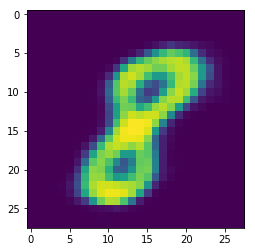

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  6



  0%|          | 1/214 [00:02<08:36,  2.42s/it]

[3 0 8 6 9 0 6 3 5 0 8 1 2 7 3 7 7 0 3 4 5 8 6 2 4 6 0 9 0 9 0 3 9 1 0 4 0
 1 8 6 8 5 2 4 8 2 5 0 3 3 1 9 9 5 8 8 5 1 2 9 8 2 3 3 7 0 7 9 5 1 8 5 7 8
 8 8 0 6 6 6 0 4 8 5 1 7 8 7 8 4 4 5 5 2 2 9 0 3 3 9 1 3 1 9 1 1 9 4 1 1 7
 6 9 7 7 0 2 5 5 7 8 1 4 7 5 6 1 7 8 9 0 4 5 5 7 1 6 9 6 1 1 2 8 6 6 4 4 0
 7 7 2 9 4 2 9 3 9 6 5 9 5 3 3 7 6 6 4 2 3 1 7 3 5 3 9 3 4 4 1 9 4 0 7 1 2
 8 3 9 0 9 6 1 6 6 3 7 4 3 2 1 1 0 2 3 6 9 3 8 3 8 0 2 2 2 6 7 3 1 3 8 3 8
 3 6 3 3 7 0 9 4 1 9 2 1 4 1 4 6 6 2 0 6 2 6 4 0 5 2 5 6 0 6 1 3 3 4]
[3 0 8 6 9 0 6 3 5 0 8 1 2 7 3 7 7 0 3 4 5 8 6 2 4 6 0 9 0 9 0 3 9 1 0 4 0
 1 8 6 8 5 2 4 8 2 5 0 3 3 1 9 9 5 8 8 5 1 2 9 8 2 3 3 7 0 7 9 5 1 8 5 7 8
 8 8 0 6 6 6 0 4 8 5 1 7 8 7 8 4 4 5 5 2 2 9 0 3 3 9 1 3 1 9 1 1 9 4 1 1 7
 6 9 7 7 0 2 5 5 7 8 1 4 7 5 6 1 7 8 9 0 4 5 5 7 1 6 9 6 1 1 2 8 6 6 4 4 0
 7 7 2 9 4 2 9 3 9 6 5 4 5 3 3 7 6 6 4 2 3 1 7 3 5 3 9 3 4 4 1 9 4 0 7 1 2
 8 3 9 0 9 6 1 6 6 3 7 4 3 2 1 1 0 2 3 6 9 3 8 3 8 0 2 2 2 6 7 3 1 3 8 3 8
 3 6 3 3 7 0 9 4 1 9 2 1 4 1 4


  1%|          | 2/214 [00:04<08:31,  2.41s/it]

[0 0 2 2 9 4 0 2 8 7 8 1 0 8 4 6 5 1 1 2 2 7 0 4 6 3 2 1 4 1 6 6 8 5 7 6 8
 9 3 3 3 9 3 8 5 5 7 5 0 0 9 9 3 8 2 9 8 5 9 0 6 7 9 6 2 1 3 3 4 5 5 5 7 3
 3 6 0 5 3 7 1 4 1 2 2 6 7 8 1 8 8 1 9 8 1 6 7 8 9 6 2 3 2 6 4 5 9 2 2 3 0
 6 1 6 7 6 1 3 4 8 4 0 5 7 7 7 8 1 9 9 7 5 9 3 3 0 4 2 6 0 5 8 7 7 1 7 3 4
 7 6 7 1 3 8 6 6 7 1 7 5 9 7 4 6 8 3 2 6 3 4 1 4 5 8 1 7 9 0 8 7 0 9 5 7 7
 6 8 2 3 7 4 8 6 6 1 3 2 2 8 1 2 7 6 6 7 8 3 7 9 6 0 6 3 3 5 4 1 5 5 5 8 5
 5 3 7 5 6 5 3 8 2 0 0 1 4 3 3 8 5 0 7 8 1 7 3 7 9 8 0 9 0 6 6 5 7 4]
[0 0 2 2 9 4 0 2 8 7 8 1 0 8 4 6 5 1 1 2 2 7 0 4 6 3 2 1 4 1 6 6 8 5 7 6 8
 9 3 3 3 9 3 8 5 5 7 5 0 0 9 9 3 8 2 9 8 5 9 0 6 7 9 6 2 1 3 3 4 5 5 5 7 3
 3 6 0 5 3 7 1 4 1 2 2 6 7 8 1 8 8 1 9 8 1 6 7 8 9 6 2 3 2 6 4 5 9 2 2 3 0
 6 1 6 7 6 1 3 4 8 4 0 5 7 7 7 8 1 9 9 7 5 9 3 3 0 4 2 6 0 5 8 7 7 1 7 3 4
 7 6 7 1 3 8 6 6 7 1 7 5 9 7 4 6 8 3 2 6 3 4 1 4 5 8 1 7 9 0 8 7 0 9 5 7 7
 6 8 2 3 7 4 8 6 6 1 3 2 2 8 1 2 7 6 6 7 8 3 7 9 6 0 6 3 3 5 4 1 5 5 5 8 5
 5 3 7 5 6 5 3 8 2 0 0 1 4 3 3


  1%|▏         | 3/214 [00:07<08:15,  2.35s/it]

[5 3 9 4 0 0 5 8 0 1 6 2 7 5 5 9 8 7 1 5 1 1 9 6 2 9 9 2 4 1 6 7 2 9 5 1 2
 6 2 3 1 9 3 4 1 9 4 1 8 7 0 2 4 2 1 8 5 6 0 8 8 6 6 0 3 0 6 2 0 1 4 3 5 1
 4 0 2 6 4 5 1 4 1 3 6 4 8 9 7 3 9 5 5 9 5 8 2 5 8 4 8 3 3 2 1 8 5 7 3 1 0
 6 0 1 7 2 9 0 7 8 2 7 8 8 0 3 9 6 6 4 5 1 1 8 5 7 2 9 1 7 3 9 6 9 4 4 7 7
 0 1 6 3 9 8 0 2 8 1 8 0 7 0 4 2 3 0 3 4 6 6 9 6 6 7 4 8 4 4 6 4 7 2 3 9 7
 4 0 8 4 2 4 4 0 6 8 1 7 7 1 1 3 7 9 0 6 1 7 8 3 1 7 2 9 4 2 2 8 9 8 1 1 2
 5 6 6 9 5 3 7 9 2 8 6 5 0 9 3 4 7 0 7 1 9 4 4 1 7 3 0 2 6 7 9 9 8 3]
[5 3 9 4 0 0 5 8 0 1 6 2 7 5 5 9 8 7 1 5 1 1 9 6 2 9 9 2 4 1 6 7 2 9 5 1 2
 6 2 3 1 9 3 4 1 9 4 1 8 7 0 2 4 2 1 8 5 6 0 8 8 6 6 0 3 0 6 2 0 1 4 3 5 1
 4 0 2 6 4 5 1 4 1 3 6 4 8 9 7 3 9 5 5 9 5 8 2 5 8 4 8 3 3 2 1 8 9 7 3 1 0
 6 0 1 7 2 9 0 7 8 2 7 8 8 0 3 9 6 6 4 5 1 1 8 5 7 2 9 1 7 3 9 6 9 4 4 7 7
 0 1 6 3 9 8 0 2 8 1 8 0 7 0 4 2 3 0 3 4 6 6 9 6 6 7 4 8 4 4 6 4 7 2 3 9 7
 4 0 8 4 2 4 4 0 6 8 1 7 7 1 1 3 7 9 0 6 1 7 8 3 1 7 2 9 4 2 2 8 9 8 1 1 2
 5 6 6 9 5 3 7 9 2 8 6 5 0 9 3


  2%|▏         | 4/214 [00:09<08:08,  2.33s/it]

[4 3 0 7 9 6 2 4 4 1 4 7 4 9 2 2 2 8 4 7 1 0 4 1 3 8 3 0 0 9 4 4 7 2 0 7 6
 0 2 6 5 7 8 5 6 4 2 3 4 4 2 5 1 9 8 2 4 0 6 6 0 0 4 9 5 9 8 8 9 0 1 7 5 0
 4 3 5 2 8 4 6 3 3 9 7 6 5 3 1 4 4 1 4 7 1 0 7 9 1 8 6 7 6 9 5 6 5 8 2 3 6
 8 8 6 8 2 1 6 9 6 9 5 7 7 5 9 0 4 1 3 2 5 5 8 7 1 5 4 4 0 8 8 5 2 9 4 4 9
 5 1 8 6 5 9 2 3 0 5 9 4 2 0 0 7 7 2 3 3 5 9 7 2 5 9 6 2 5 3 7 1 7 5 9 9 5
 5 2 4 9 4 2 1 7 9 7 0 0 1 0 3 3 7 9 6 7 4 7 7 0 5 7 4 3 2 6 3 4 9 9 9 7 5
 9 4 9 6 2 9 6 0 1 9 0 1 8 6 1 9 7 0 0 6 2 5 5 0 8 7 0 0 4 7 4 7 1 8]
[4 3 0 7 9 6 2 4 4 1 4 7 4 9 2 2 2 8 4 7 1 0 4 1 3 8 3 0 0 9 4 4 7 2 0 7 6
 0 2 6 5 7 8 5 6 4 2 3 4 4 2 5 1 9 8 2 4 0 6 6 0 0 4 9 5 9 8 8 9 0 1 7 5 0
 4 3 5 2 8 4 6 3 3 9 7 6 5 3 1 4 4 1 4 7 1 0 7 9 1 8 6 7 6 9 5 6 5 8 2 3 6
 8 8 6 8 2 1 6 9 6 9 5 7 7 5 9 0 4 1 3 2 5 5 8 7 1 5 4 4 0 8 8 5 2 9 4 4 9
 5 1 8 6 5 9 2 3 0 5 9 4 2 0 0 7 7 2 3 3 5 9 7 2 5 9 6 2 5 3 7 1 7 5 9 9 5
 5 2 4 9 4 2 1 7 9 7 0 0 1 0 3 3 7 9 6 7 4 7 7 0 5 7 4 3 2 6 3 4 9 9 9 7 5
 9 4 9 6 2 9 6 0 1 9 0 1 8 6 1


  2%|▏         | 5/214 [00:11<08:02,  2.31s/it]

[9 3 2 0 2 3 0 8 3 6 5 4 7 5 8 3 5 8 8 5 6 7 1 6 8 3 9 0 9 1 4 4 3 6 0 6 1
 9 0 9 8 7 9 7 9 8 6 2 1 4 8 1 8 8 1 0 3 3 7 0 1 5 7 8 1 3 4 4 3 0 8 5 3 8
 5 0 4 6 7 6 5 9 3 5 2 5 5 5 2 6 0 3 8 4 7 5 3 9 9 3 2 0 1 7 3 2 4 5 3 7 4
 6 7 7 7 1 5 9 0 5 7 0 7 2 7 0 9 2 9 1 0 3 2 3 3 5 8 6 2 1 3 7 9 0 2 1 2 5
 1 8 7 7 8 6 5 6 0 4 8 3 7 2 5 6 3 8 7 3 4 8 7 2 7 0 7 4 5 3 8 3 4 5 3 7 7
 1 9 8 2 6 7 2 8 0 4 5 0 2 6 9 3 3 0 3 9 1 1 1 9 7 0 6 7 5 4 2 4 7 8 3 1 7
 8 2 5 1 5 2 5 2 4 6 0 0 1 7 8 1 1 1 5 4 3 6 0 0 6 6 6 4 7 1 2 4 7 7]
[9 3 2 0 2 3 0 8 3 6 5 4 7 5 8 3 5 8 8 5 6 7 1 6 8 3 9 0 9 1 9 4 3 6 0 6 1
 9 0 9 8 7 9 7 9 8 6 2 1 4 8 1 8 8 1 0 3 3 7 0 1 5 7 8 1 3 4 4 3 0 8 5 3 8
 5 0 4 6 7 6 5 9 3 5 2 5 5 5 2 6 0 3 8 4 7 5 3 9 9 3 2 0 1 7 3 2 4 5 3 7 4
 6 7 7 7 1 5 9 0 5 7 0 7 2 7 0 9 2 9 1 0 3 2 3 3 5 8 6 2 1 3 7 9 0 2 1 2 5
 1 8 7 7 8 6 5 6 0 4 8 3 7 2 5 6 3 8 7 3 4 8 7 2 7 0 7 4 5 3 8 3 4 5 3 7 7
 1 9 8 2 6 7 2 8 0 4 5 0 2 6 9 3 3 0 3 9 1 1 1 9 7 0 6 7 5 4 2 4 7 8 3 1 7
 8 2 5 1 5 2 5 2 4 6 0 0 1 7 8


  3%|▎         | 6/214 [00:13<07:53,  2.27s/it]

[0 6 0 7 7 1 5 6 6 6 4 2 4 1 0 0 0 2 3 8 4 1 2 9 8 2 7 8 0 1 3 6 0 2 6 1 3
 7 6 8 2 1 1 7 8 8 9 8 8 4 1 3 6 9 9 2 3 6 8 6 3 6 6 4 4 9 1 2 4 3 3 6 5 4
 7 2 0 6 0 2 1 4 2 6 0 4 4 1 7 1 7 8 2 8 1 3 5 1 2 7 9 3 7 3 6 4 0 9 7 7 5
 7 7 8 3 1 6 2 5 6 3 9 9 3 8 9 4 2 3 5 0 8 5 3 7 6 2 0 2 7 4 1 3 1 5 0 7 2
 5 3 7 8 2 7 3 7 4 3 5 9 5 5 4 5 0 5 1 7 5 8 4 7 3 4 9 2 0 5 9 1 2 9 7 9 2
 5 5 1 5 0 2 9 3 0 5 9 6 7 0 8 6 0 6 0 1 2 3 8 7 8 8 7 3 3 1 1 4 8 0 9 6 6
 9 8 4 3 9 9 5 0 0 2 3 3 7 1 9 7 5 6 8 3 4 4 7 3 7 7 2 0 2 4 5 7 7 5]
[0 6 0 7 7 1 5 6 6 6 4 2 4 1 0 0 0 2 3 8 4 1 2 9 8 2 7 8 0 1 3 6 0 2 6 1 3
 7 6 8 2 1 1 7 8 8 9 8 8 4 1 3 6 9 9 2 3 6 8 6 3 6 6 4 4 9 1 2 4 3 3 6 5 4
 7 2 0 6 0 2 1 4 2 6 0 4 4 1 7 1 7 8 2 8 1 3 5 1 2 7 9 3 7 3 6 4 0 9 7 7 5
 7 7 8 3 1 6 2 5 6 3 9 9 3 8 9 4 2 3 5 0 8 5 3 7 6 2 0 2 7 4 1 3 1 5 0 7 2
 5 3 7 8 2 7 3 7 4 3 5 9 5 5 4 5 0 5 1 7 5 8 4 7 3 4 9 2 0 5 9 1 2 9 7 9 2
 5 5 1 5 0 2 9 3 0 5 9 6 7 0 8 6 0 6 0 1 2 3 8 7 8 8 7 3 3 1 1 4 8 0 9 6 6
 9 8 4 3 9 9 5 0 0 2 3 3 7 1 9


  3%|▎         | 7/214 [00:15<07:44,  2.24s/it]

[9 9 1 7 2 9 5 5 9 4 7 2 5 4 4 2 6 5 8 9 6 4 9 2 3 3 8 1 2 5 3 7 2 7 4 2 3
 0 1 2 6 8 0 0 2 9 2 0 6 2 8 2 7 5 1 1 5 2 2 6 2 9 3 0 2 6 9 7 4 8 6 7 2 5
 2 7 5 4 2 5 7 0 7 5 6 1 9 0 0 7 5 8 2 7 4 1 6 0 1 9 0 0 8 5 0 7 1 4 0 0 7
 3 9 8 0 7 1 8 6 3 2 8 5 4 3 2 6 8 8 1 4 9 4 7 8 2 9 1 3 0 5 5 7 2 7 9 3 0
 9 4 7 5 4 4 4 1 6 8 2 4 2 2 8 2 8 2 1 3 3 7 6 0 1 0 9 0 5 9 4 1 5 5 7 6 6
 1 0 2 0 8 9 0 5 3 7 5 8 3 7 2 6 5 6 8 6 8 8 0 5 0 1 8 9 7 1 6 8 3 7 8 1 7
 2 1 0 8 6 7 5 6 7 4 0 4 9 9 4 7 4 3 3 6 3 6 3 5 0 2 4 6 8 3 1 1 8 5]
[9 9 1 7 2 9 5 5 9 4 7 2 5 4 4 2 6 5 8 9 6 4 9 2 3 3 8 1 2 5 3 7 2 7 4 2 3
 0 1 2 6 8 0 0 2 9 2 0 6 2 8 2 7 5 1 1 5 2 2 6 2 9 3 0 2 6 9 7 4 8 6 7 2 5
 2 7 5 4 2 5 7 0 7 5 6 1 9 0 0 7 5 8 2 7 4 1 6 0 1 9 0 0 8 5 0 7 1 4 0 0 7
 3 9 8 0 7 1 8 6 3 2 8 5 4 3 2 6 8 8 1 4 9 4 7 8 2 9 1 3 0 5 5 7 2 7 9 3 0
 9 4 7 5 4 4 4 1 6 8 2 4 2 2 8 2 8 2 1 3 3 7 6 0 1 0 9 0 5 9 4 1 5 5 7 6 6
 1 0 2 0 8 9 0 5 3 7 5 8 3 7 2 6 5 6 8 6 8 8 0 5 0 1 8 9 7 1 6 8 3 7 8 1 7
 2 1 0 8 6 7 5 6 7 4 0 4 9 9 4


  4%|▎         | 8/214 [00:17<07:39,  2.23s/it]

[4 8 0 7 0 7 6 1 4 2 8 9 3 6 1 0 9 2 7 5 2 4 3 0 1 2 0 5 7 3 1 8 8 9 6 0 8
 3 8 7 2 2 3 8 8 3 3 5 4 6 3 6 7 9 5 4 8 9 9 3 0 6 3 7 7 6 8 9 0 9 5 4 2 6
 1 1 5 0 4 7 9 8 6 7 1 7 1 1 0 7 2 6 1 7 6 4 6 1 5 6 0 5 3 3 1 5 6 5 3 2 1
 3 9 2 8 4 0 0 6 4 8 9 6 7 1 1 7 4 6 6 9 1 6 0 9 2 8 9 0 4 6 1 5 6 1 5 4 1
 7 7 7 1 6 5 7 5 7 4 6 7 4 5 2 4 2 4 1 5 1 0 8 5 8 6 9 2 7 9 1 4 4 7 2 6 0
 1 6 9 3 0 6 5 7 9 5 1 5 2 7 6 4 6 6 7 5 1 0 5 1 3 9 9 9 2 0 8 6 6 8 0 9 0
 3 4 1 8 9 5 9 6 9 2 3 3 7 1 1 1 8 7 7 1 2 2 9 6 0 8 0 3 5 7 0 1 8 1]
[4 8 0 7 0 7 6 1 4 2 8 9 3 6 1 0 9 2 7 5 2 4 3 0 1 2 0 5 7 3 1 8 8 9 6 0 8
 3 8 7 2 2 3 8 8 3 3 5 4 6 3 6 7 9 5 4 8 9 9 3 0 6 3 7 7 6 8 9 0 9 5 4 2 6
 1 1 5 0 4 7 9 8 6 7 1 7 1 1 0 7 2 6 1 7 6 4 6 1 5 6 0 5 3 3 1 5 6 5 3 2 1
 3 9 2 8 4 0 0 6 4 8 9 6 7 1 1 7 4 6 6 9 1 6 0 9 2 8 9 0 4 6 1 5 6 1 5 4 1
 7 7 7 1 6 5 7 5 7 4 6 7 4 5 2 4 2 4 1 5 1 0 8 5 8 6 9 2 7 9 1 4 4 7 2 6 0
 1 6 9 3 0 6 5 7 9 5 1 5 2 7 6 4 6 6 7 5 1 0 5 1 3 9 9 9 2 0 8 6 6 8 0 9 0
 3 4 1 8 9 5 9 6 9 2 3 3 7 1 1


  4%|▍         | 9/214 [00:20<07:35,  2.22s/it]

[3 9 3 1 3 8 2 8 1 7 3 5 4 8 0 8 7 7 9 8 7 1 6 2 1 3 3 2 5 1 1 9 8 8 4 2 1
 1 0 2 8 9 7 0 1 7 6 4 9 4 3 6 3 3 1 6 2 5 7 5 0 1 1 2 8 7 8 8 8 6 2 2 1 5
 4 9 3 9 1 3 5 1 7 0 9 0 6 1 3 1 6 4 4 4 6 4 8 9 3 2 7 3 3 3 9 2 2 1 3 1 0
 8 7 3 1 4 5 8 0 4 0 6 0 6 6 1 9 0 8 9 2 5 9 5 7 6 3 5 6 1 5 1 8 1 7 0 4 5
 2 6 4 8 1 5 7 5 1 1 6 7 9 6 7 7 9 9 0 5 8 0 0 5 3 0 5 6 6 6 5 9 5 0 1 9 0
 0 3 7 6 4 7 1 6 0 6 8 1 2 0 7 2 2 2 0 3 4 0 9 7 2 1 6 9 0 4 7 6 7 5 1 4 6
 6 6 2 2 8 5 2 7 2 4 0 5 3 9 8 0 1 9 3 9 5 4 2 5 8 5 6 9 3 3 4 5 8 0]
[3 9 3 1 3 8 2 8 1 7 3 5 4 8 0 8 7 7 9 8 7 1 6 2 1 3 3 2 5 1 1 9 8 8 4 2 1
 1 0 2 8 9 7 0 1 7 6 4 9 4 3 6 3 3 1 6 2 5 7 5 0 1 1 2 8 7 8 8 8 6 2 2 1 5
 4 9 3 9 1 3 5 1 7 0 9 0 6 1 3 1 6 4 4 4 6 4 8 9 3 2 7 3 3 3 9 2 2 1 3 1 0
 8 7 3 1 4 5 8 0 4 0 6 0 6 6 1 9 0 8 9 2 5 9 5 7 6 3 5 6 1 5 1 8 1 7 0 4 5
 2 6 4 8 1 5 7 5 1 1 6 7 9 6 7 7 9 9 0 5 8 0 0 5 3 0 5 6 6 6 5 9 5 0 1 9 0
 0 3 7 6 4 7 1 6 0 6 8 1 2 0 7 2 2 2 0 3 4 0 9 7 2 1 6 9 0 4 7 6 7 5 1 4 6
 6 6 2 2 8 5 2 7 2 4 0 5 3 9 8


  5%|▍         | 10/214 [00:22<07:31,  2.21s/it]

[8 8 7 2 3 8 2 0 6 7 9 0 8 5 6 0 9 1 8 8 4 7 4 0 0 4 6 2 0 8 0 4 6 4 2 1 4
 0 8 2 6 9 9 3 4 2 4 9 4 5 6 8 6 0 9 7 4 9 9 1 0 7 2 2 0 1 8 1 0 3 9 9 2 5
 4 5 2 9 0 1 2 6 8 4 2 1 2 7 8 9 0 7 9 7 6 9 6 2 3 3 3 1 8 3 4 3 0 8 6 6 4
 6 1 5 1 2 4 0 8 2 4 4 1 3 7 7 8 2 9 2 9 8 1 5 0 7 0 9 8 0 6 8 2 6 8 0 0 8
 6 6 3 1 7 2 6 4 5 6 2 2 7 9 2 7 2 0 0 9 0 6 3 6 7 0 4 2 0 7 6 5 2 2 6 8 6
 1 5 8 2 7 0 2 3 9 4 7 8 8 6 2 8 3 2 2 1 0 3 3 7 4 6 0 0 7 9 3 2 6 0 7 4 3
 6 8 0 9 5 7 1 0 4 0 4 6 0 1 2 0 2 7 4 6 5 0 0 5 3 9 9 0 1 4 8 0 3 2]
[8 8 7 2 3 8 2 0 6 7 9 0 8 5 6 0 9 1 8 8 4 7 4 0 0 4 6 2 0 8 0 4 6 4 2 1 4
 0 8 2 6 9 9 3 4 2 4 9 4 5 6 8 6 0 9 7 4 9 9 1 0 7 2 2 0 1 8 1 0 3 9 9 2 5
 4 5 2 9 0 1 2 6 8 4 2 1 2 7 8 9 0 7 9 7 6 9 6 2 3 3 3 1 8 3 4 3 0 8 6 6 4
 6 1 5 1 2 4 0 8 2 4 4 1 3 7 7 8 2 9 2 9 8 1 5 0 7 0 9 8 0 6 8 2 6 8 0 0 8
 6 6 3 1 7 2 6 4 5 6 2 2 7 9 2 7 2 0 0 9 0 6 3 6 7 0 4 2 0 7 6 5 2 2 6 8 6
 1 5 8 2 7 0 2 3 9 4 7 8 8 6 2 8 3 2 2 1 0 3 3 7 4 6 0 0 7 9 3 2 6 0 7 4 3
 6 8 0 9 5 7 1 0 4 0 4 6 0 1 2


  5%|▌         | 11/214 [00:24<07:27,  2.20s/it]

[8 0 2 9 7 1 5 4 0 4 4 1 7 2 3 4 6 3 7 0 9 3 8 2 2 5 0 1 9 5 7 6 7 0 2 6 1
 0 2 0 7 3 2 4 3 3 5 4 4 2 4 0 6 7 6 5 6 0 0 5 2 4 8 7 9 5 9 0 1 0 0 3 5 5
 9 1 4 5 0 2 2 5 6 8 5 0 0 2 0 4 7 3 6 7 9 4 5 2 9 9 1 3 2 9 7 4 1 9 3 1 9
 2 5 7 8 9 3 2 8 3 4 4 4 8 3 7 1 0 9 8 4 1 2 9 0 1 5 4 3 0 8 6 9 3 3 1 9 6
 9 1 5 8 2 3 8 6 9 6 2 1 7 3 9 3 1 2 7 7 4 4 7 2 5 0 7 5 7 4 3 6 2 4 3 1 7
 2 0 7 3 1 7 1 6 9 7 3 0 3 6 5 8 4 9 9 7 5 3 9 0 3 4 3 7 7 6 5 4 6 6 3 5 7
 3 6 9 5 9 5 7 2 1 9 5 9 2 5 9 7 4 1 4 2 0 9 2 3 7 7 9 4 8 3 3 1 0 0]
[8 0 2 9 7 1 5 4 0 4 4 1 7 2 3 4 6 3 7 0 9 3 8 2 2 5 0 1 9 5 7 6 7 0 2 6 1
 0 2 0 7 3 2 4 3 3 5 4 4 2 4 0 6 7 6 5 6 0 0 5 2 4 8 7 9 5 9 0 1 0 0 3 5 5
 9 1 4 5 0 2 2 5 6 8 5 0 0 2 0 4 7 3 6 7 9 4 5 2 9 9 1 3 2 9 7 4 1 9 3 1 9
 2 5 7 8 9 3 2 8 3 4 4 4 8 3 7 1 0 9 8 4 1 2 9 0 1 5 4 3 0 8 6 9 3 3 1 9 6
 9 1 5 8 2 3 8 6 9 6 2 1 7 3 9 3 1 2 7 7 4 4 7 2 5 0 7 5 7 4 3 6 2 4 3 1 7
 2 0 7 3 1 7 1 6 9 7 3 0 3 6 5 8 4 9 9 7 5 3 9 0 3 4 3 7 7 6 5 4 6 6 3 5 7
 3 6 9 5 9 5 7 2 1 9 5 9 2 5 9


  6%|▌         | 12/214 [00:26<07:23,  2.20s/it]

[4 2 6 3 2 0 8 3 0 5 6 9 2 2 5 7 6 4 7 4 9 8 1 1 9 0 8 6 5 5 6 9 6 7 7 3 5
 1 5 2 5 1 0 8 7 3 5 6 0 8 8 3 3 2 0 7 8 6 9 5 3 3 7 3 1 5 6 2 2 8 8 9 1 2
 6 8 0 2 5 3 6 1 1 5 1 4 2 6 9 1 0 4 0 5 4 3 0 7 6 1 5 3 4 9 7 1 8 9 7 2 5
 9 6 3 1 7 1 6 3 6 9 2 1 0 7 5 1 7 7 6 0 7 2 0 8 6 2 1 3 5 0 2 8 2 4 6 6 7
 1 7 1 4 8 5 7 6 5 8 1 2 1 2 2 3 3 5 3 0 8 5 8 3 4 4 0 5 6 5 0 4 4 1 5 6 0
 2 8 4 3 4 9 9 2 7 0 0 8 7 7 7 5 1 2 7 1 0 4 8 1 4 0 8 9 4 3 0 6 1 0 7 5 7
 1 9 8 7 0 1 7 3 6 9 5 1 5 0 5 1 5 2 2 8 0 4 0 7 8 0 9 8 7 6 4 2 3 8]
[4 2 6 3 2 0 8 3 0 5 6 9 2 2 5 7 6 4 7 4 4 8 1 1 9 0 8 6 5 5 6 9 6 7 7 3 5
 1 5 2 5 1 0 8 7 3 5 6 0 8 8 3 3 2 0 7 8 6 9 5 3 3 7 3 1 5 6 2 2 8 8 9 1 2
 6 8 0 2 5 3 6 1 1 5 1 4 2 6 9 1 0 4 0 5 4 3 0 7 6 1 5 3 4 9 7 1 8 9 7 2 5
 9 6 3 1 7 1 6 3 6 9 2 1 0 7 5 1 7 7 6 0 7 2 0 8 6 2 1 3 5 0 2 8 2 4 6 6 7
 1 7 1 4 8 5 7 6 5 8 1 2 1 2 2 3 3 5 3 0 8 5 8 3 4 4 0 5 6 5 0 4 4 1 5 6 0
 2 8 4 3 4 9 9 2 7 0 0 8 7 7 7 5 1 2 7 1 0 4 8 1 4 0 8 9 4 3 0 6 1 0 7 5 7
 1 9 8 7 0 1 7 3 6 9 5 1 5 0 5


  6%|▌         | 13/214 [00:28<07:20,  2.19s/it]

[2 7 9 7 4 5 6 5 1 7 7 6 7 5 9 4 4 3 0 6 9 1 7 1 3 3 0 1 6 1 5 7 0 4 7 8 2
 4 0 2 8 8 1 2 7 3 1 1 6 8 8 9 5 9 9 7 6 5 3 7 3 5 4 1 9 9 9 2 3 4 0 8 3 1
 8 9 0 0 1 5 9 6 3 3 9 7 7 8 6 7 0 5 1 2 7 0 8 1 4 0 0 7 2 1 0 4 3 3 8 2 7
 6 7 4 4 1 0 5 4 9 9 5 8 6 6 6 2 1 6 4 9 6 0 0 8 4 7 6 5 5 4 1 4 1 8 1 3 1
 4 1 7 1 3 9 6 8 4 0 5 3 3 0 3 3 4 7 3 3 6 1 9 5 6 2 9 3 1 0 0 8 2 0 6 2 3
 4 6 5 8 2 6 3 6 0 0 5 5 1 3 1 2 5 7 9 5 3 4 7 1 5 9 2 0 2 7 2 1 8 8 3 0 4
 9 1 1 6 4 5 5 4 5 3 4 0 9 7 6 0 5 2 8 7 9 6 6 3 0 0 3 4 6 8 3 2 2 4]
[2 7 9 7 4 5 6 5 1 7 7 6 7 5 9 4 4 3 0 6 9 1 7 1 3 3 0 1 6 1 5 7 0 4 7 8 2
 4 0 2 8 8 1 2 7 3 1 1 6 8 8 9 5 9 9 7 6 5 3 7 3 5 4 1 9 9 9 2 3 4 0 8 3 1
 8 9 0 0 1 5 9 6 3 3 9 7 7 8 6 7 0 5 1 2 7 0 8 1 4 0 0 7 2 1 0 4 3 3 8 2 7
 6 7 4 4 1 0 5 4 9 9 5 8 6 6 6 2 1 6 4 9 6 0 0 8 4 7 6 5 5 4 1 4 1 8 1 3 1
 4 1 7 1 3 9 6 8 4 0 5 3 3 0 3 3 4 7 3 3 6 1 9 5 6 2 9 3 1 0 0 8 2 0 6 2 3
 4 6 5 8 2 6 3 6 0 0 5 5 1 3 1 2 5 7 9 5 3 4 7 1 5 9 2 0 2 7 2 1 8 8 3 0 4
 9 1 1 6 4 5 5 4 5 3 4 0 9 7 6


  7%|▋         | 14/214 [00:30<07:16,  2.18s/it]

[1 3 0 1 2 9 9 1 8 8 8 6 2 8 5 1 9 3 5 0 9 0 7 4 7 9 4 2 4 4 0 2 3 7 1 6 6
 8 7 4 3 1 7 7 2 9 5 8 0 2 6 5 6 1 0 1 3 8 7 2 6 4 8 7 3 6 9 0 4 2 1 1 6 2
 3 0 1 9 8 6 0 2 3 8 6 3 8 5 6 7 7 3 5 2 7 3 8 7 0 2 5 6 1 9 3 2 5 5 5 6 9
 8 3 7 7 3 5 9 6 0 8 6 8 8 2 5 9 8 5 8 0 0 1 2 4 9 4 1 7 6 7 6 6 0 9 6 5 8
 2 6 3 7 9 7 9 9 8 6 2 0 2 5 2 1 0 0 7 4 6 2 9 8 2 1 0 1 9 9 9 2 1 4 9 0 3
 7 0 7 4 7 8 0 1 4 2 8 8 0 4 2 9 7 7 2 0 8 3 3 3 3 8 3 0 8 2 9 7 3 1 4 3 8
 3 2 8 9 2 5 0 9 7 1 0 8 4 9 3 0 8 7 9 4 7 6 1 4 2 4 3 2 0 4 1 5 3 5]
[1 3 0 1 2 9 9 1 8 8 8 6 2 8 5 1 9 3 5 0 9 0 7 4 7 9 4 2 4 4 0 2 3 7 1 6 6
 8 7 4 3 1 7 7 2 9 5 8 0 2 6 5 6 1 0 1 3 8 7 2 6 4 8 7 3 6 9 0 4 2 1 1 6 2
 3 0 1 9 8 6 0 2 3 8 6 3 8 5 6 7 7 3 5 2 7 3 8 7 0 2 5 6 1 9 3 2 5 5 5 6 9
 8 3 7 7 3 5 9 6 0 8 6 8 8 2 5 9 8 5 8 0 0 1 2 4 9 4 1 7 6 7 6 6 0 9 6 5 8
 2 6 3 7 9 7 9 9 8 6 2 0 2 5 2 1 0 0 7 4 6 2 9 8 2 1 0 1 9 9 9 2 1 4 9 0 3
 7 0 7 4 7 8 0 1 4 2 8 8 0 4 2 9 7 7 2 0 8 3 3 3 3 8 3 0 8 2 9 7 3 1 4 3 8
 3 2 8 9 2 5 0 9 7 1 0 8 4 9 3


  7%|▋         | 15/214 [00:32<07:13,  2.18s/it]

[6 1 8 3 7 7 0 3 6 9 2 9 4 0 7 9 6 7 9 1 3 1 5 3 5 1 4 2 7 3 9 1 6 2 9 1 3
 5 7 5 1 0 4 2 8 2 3 3 0 6 1 1 9 5 1 6 4 3 6 3 4 3 7 4 1 5 2 8 7 4 9 3 8 3
 5 4 9 6 2 4 3 9 3 5 8 1 5 9 6 1 0 7 7 5 0 1 4 6 6 1 5 1 6 3 9 8 8 6 2 0 9
 6 7 1 2 7 5 9 2 7 7 4 6 5 1 2 2 0 1 1 2 2 9 0 9 5 6 1 4 2 6 0 8 9 8 5 9 7
 3 8 4 5 3 4 5 2 6 9 3 5 2 7 1 6 6 4 6 1 9 5 2 0 2 9 8 1 9 5 9 0 5 1 4 4 4
 3 9 8 2 6 6 3 7 9 7 3 6 7 1 7 9 0 4 6 2 6 5 1 9 1 9 4 5 1 4 9 0 6 2 7 7 3
 0 2 4 0 1 8 0 6 7 3 2 7 8 3 9 3 6 4 8 3 7 1 6 0 2 5 9 5 1 8 2 6 6 8]
[6 1 8 3 7 7 0 3 6 9 2 9 4 0 7 9 6 7 9 1 3 1 5 3 5 1 4 2 7 3 9 1 6 2 9 1 3
 5 7 5 1 0 4 2 8 2 3 3 0 6 1 1 9 5 1 6 4 3 6 3 4 3 7 4 1 5 2 8 7 4 9 3 8 3
 5 4 9 6 2 4 3 9 3 5 8 1 5 9 6 1 0 7 7 5 0 1 4 6 6 1 5 1 6 3 9 8 8 6 2 0 9
 6 7 1 2 7 5 9 2 7 7 4 6 5 1 2 2 0 1 1 2 2 9 0 9 5 6 1 4 2 6 0 8 9 8 5 9 7
 3 8 4 5 3 4 5 2 6 9 3 5 2 7 1 6 6 4 6 1 9 5 2 0 2 9 8 1 9 5 9 0 5 1 4 4 4
 3 9 8 2 6 6 3 7 9 7 3 6 7 1 7 9 0 4 6 2 6 5 1 9 1 9 4 5 1 4 9 0 6 2 7 7 3
 0 2 4 0 1 8 0 6 7 3 2 7 8 3 9


  7%|▋         | 16/214 [00:34<07:09,  2.17s/it]

[9 2 6 8 2 4 9 6 1 8 9 4 6 0 0 8 0 3 4 1 3 6 7 3 7 1 4 3 4 5 4 8 7 8 8 2 4
 9 1 4 0 6 6 1 8 4 8 2 0 0 7 4 0 1 9 1 6 4 6 7 1 4 9 5 3 9 9 5 5 5 8 7 6 6
 3 8 5 9 7 2 4 3 7 2 4 4 3 3 2 0 7 4 8 8 3 5 6 7 1 8 3 2 4 4 7 9 1 7 4 3 5
 8 0 0 9 7 1 6 1 0 6 7 5 1 0 4 5 1 5 0 2 6 2 6 6 1 5 6 5 7 3 7 1 7 8 2 3 5
 9 9 5 9 2 5 2 0 2 4 8 6 1 3 1 2 9 6 1 6 2 6 4 9 6 7 8 3 9 0 1 8 6 1 8 4 8
 2 4 9 0 8 4 0 3 8 6 9 5 4 5 4 4 4 5 2 0 1 3 2 7 7 7 9 3 1 5 9 1 4 9 2 9 1
 6 2 3 0 7 8 5 7 1 2 5 0 3 6 1 9 3 7 7 7 4 2 7 6 9 9 5 4 5 1 5 8 6 4]
[9 2 6 8 2 4 9 6 1 8 9 4 6 0 0 8 0 3 4 1 3 6 7 3 7 1 4 3 4 5 4 8 7 8 8 2 4
 9 1 4 0 6 6 1 8 4 8 2 0 0 7 4 0 1 9 1 6 4 6 7 1 4 9 5 3 9 9 5 5 5 8 7 6 6
 3 8 5 9 7 2 4 3 7 2 4 4 3 3 2 0 7 4 8 8 3 5 6 7 1 8 3 2 4 4 7 9 1 7 4 3 5
 8 0 0 9 7 1 6 1 0 6 7 5 1 0 4 5 1 5 0 2 6 2 6 6 1 5 6 5 7 3 7 1 7 8 2 3 5
 9 9 5 9 2 5 2 0 2 4 8 6 1 3 1 2 9 6 1 6 2 6 4 9 6 7 8 3 9 0 1 8 6 1 8 4 8
 2 4 9 0 8 4 0 3 8 6 9 5 4 5 4 4 9 5 2 0 1 3 2 7 7 7 9 3 1 5 9 1 4 9 2 9 1
 6 2 3 0 7 8 5 3 1 2 5 0 3 6 1


  8%|▊         | 17/214 [00:36<07:05,  2.16s/it]

[3 4 0 4 3 3 0 0 6 3 3 0 2 3 1 1 6 4 1 3 3 4 1 3 0 6 6 9 1 1 1 7 1 9 9 0 9
 2 1 3 6 3 5 7 6 1 5 3 8 5 0 7 5 0 4 5 0 9 5 3 4 6 2 7 1 9 4 7 1 2 5 3 8 9
 9 9 3 7 2 5 2 1 2 0 7 3 2 1 4 5 6 9 3 8 4 1 1 4 3 6 8 9 1 9 5 6 9 2 1 5 1
 4 4 7 4 8 2 4 3 7 6 5 8 7 3 5 6 4 5 1 9 6 4 0 1 1 8 4 0 8 9 1 1 7 0 0 4 7
 5 8 0 6 7 1 6 5 9 8 5 5 8 1 5 0 6 4 1 6 9 6 9 1 6 2 8 3 3 8 3 5 0 2 2 0 1
 8 5 7 9 6 7 9 3 6 3 2 9 5 1 4 8 0 9 0 4 8 1 8 5 5 7 1 7 8 2 9 8 6 4 8 5 0
 0 7 3 6 0 0 7 6 9 6 0 2 7 8 2 6 0 9 9 3 4 0 6 3 7 1 1 5 1 4 6 7 5 9]
[3 4 0 4 3 3 0 0 6 3 3 0 2 3 1 1 6 4 1 3 3 4 1 3 0 6 6 9 1 1 1 7 1 9 9 0 9
 2 1 3 6 3 5 7 6 1 5 3 8 5 0 7 5 0 4 5 0 9 5 3 4 6 2 7 1 9 4 7 1 2 5 3 8 9
 9 9 3 7 2 5 2 1 2 0 7 3 2 1 4 5 6 9 3 8 4 1 1 4 3 6 8 9 1 9 5 6 9 2 1 5 1
 4 4 7 4 8 2 4 3 7 6 5 8 7 3 5 6 4 5 1 9 6 4 0 1 1 8 4 0 8 9 1 1 7 0 0 4 7
 5 8 0 6 7 1 6 5 9 8 5 5 8 1 5 0 6 4 1 6 9 6 9 1 6 2 8 3 3 8 3 5 0 2 2 0 1
 8 5 7 9 6 7 9 3 6 3 2 9 5 1 4 8 0 9 0 4 8 1 8 5 5 7 1 7 8 2 9 8 6 4 8 5 0
 0 7 3 6 0 0 7 6 9 6 0 2 7 8 2


  8%|▊         | 18/214 [00:38<07:03,  2.16s/it]

[6 7 0 3 3 8 5 0 2 3 7 7 7 4 3 4 7 3 6 6 4 1 0 0 5 8 0 4 4 9 2 6 9 0 7 8 8
 6 1 3 6 6 2 4 3 7 9 3 8 1 2 0 2 4 7 1 1 8 7 4 1 5 6 9 2 6 3 2 4 1 0 3 5 7
 5 9 4 0 3 7 4 7 8 6 8 2 7 0 9 5 7 3 8 8 4 6 3 6 3 5 3 6 4 1 2 5 0 8 0 5 2
 4 2 4 9 5 8 0 3 8 1 3 0 4 5 8 0 4 4 6 8 0 3 0 1 9 8 7 7 5 6 6 3 4 6 5 3 3
 2 1 6 1 0 4 8 3 5 7 8 2 5 5 5 6 4 4 2 8 0 7 1 5 8 0 1 1 9 8 0 6 7 9 7 1 7
 6 4 4 7 8 1 2 6 7 9 9 3 5 5 2 4 7 5 5 7 8 9 8 4 0 1 4 1 2 0 8 5 6 3 2 2 1
 2 4 5 3 8 0 2 2 9 6 6 3 3 1 6 5 9 3 9 8 4 1 2 9 1 4 7 2 6 0 0 7 6 4]
[6 7 0 3 3 8 5 0 2 3 7 7 7 4 3 4 7 3 6 6 4 1 0 0 5 8 0 4 4 9 2 6 9 0 7 8 8
 6 1 3 6 6 2 4 3 7 9 3 8 1 2 0 2 4 7 1 1 8 7 4 1 5 6 9 2 6 3 2 4 1 0 3 5 7
 5 9 4 0 3 7 4 7 8 6 8 2 7 0 9 5 7 3 8 8 4 6 3 6 3 5 3 6 4 1 2 5 0 8 0 5 2
 4 2 4 9 5 8 0 3 8 1 3 0 4 5 8 0 4 4 6 8 0 3 0 1 9 8 7 7 5 6 6 3 4 6 5 3 3
 2 1 6 1 0 4 8 3 5 7 8 2 5 5 5 6 4 4 2 8 0 7 1 5 8 0 1 1 9 8 0 6 7 9 7 1 7
 6 4 4 7 8 1 2 6 7 9 9 3 5 5 2 4 7 5 5 7 8 9 8 4 0 1 4 1 2 0 8 5 6 3 2 2 1
 2 4 5 3 8 0 2 2 9 6 6 3 3 1 6


  9%|▉         | 19/214 [00:40<07:00,  2.16s/it]

[0 0 3 2 0 3 1 0 4 9 3 3 4 9 0 6 9 6 2 2 7 7 4 4 9 3 7 9 9 1 0 4 1 1 6 6 9
 9 8 0 2 5 4 8 3 0 7 0 1 9 3 5 4 4 0 4 8 0 3 6 4 8 9 8 1 5 7 3 0 0 6 1 8 6
 6 0 0 0 8 7 4 6 2 2 0 2 7 2 6 6 0 5 7 7 4 6 2 3 8 1 2 1 8 9 6 0 4 7 6 1 4
 2 4 9 3 7 2 9 3 6 4 4 9 6 0 1 5 3 0 5 6 7 5 5 0 1 9 3 5 8 1 4 1 2 4 1 3 2
 9 7 6 5 0 0 4 6 6 2 5 0 9 5 6 0 8 6 6 5 3 3 7 3 2 8 7 1 6 7 3 2 8 2 9 9 5
 9 7 9 0 1 1 2 9 8 7 9 6 1 9 8 2 5 0 4 9 2 4 1 6 6 8 9 1 5 0 0 2 8 2 1 3 3
 6 5 9 2 3 7 2 9 1 9 4 0 3 7 9 3 5 2 0 0 9 7 1 0 1 0 1 5 3 4 3 6 1 8]
[0 0 3 2 0 3 1 0 4 9 3 3 4 9 0 6 9 6 2 2 7 7 4 4 9 3 7 9 9 1 0 4 1 1 6 6 9
 9 8 0 2 5 4 8 3 0 7 0 1 9 3 5 4 4 0 4 8 0 3 6 4 8 9 8 1 5 7 3 0 0 6 1 8 6
 6 0 0 0 8 7 4 6 2 2 0 2 7 2 6 6 0 5 7 7 4 6 2 3 8 1 2 1 8 9 6 0 4 7 6 1 4
 2 4 9 3 7 2 9 3 6 4 4 9 6 0 1 5 3 0 5 6 7 5 5 0 1 9 3 5 8 1 4 1 2 4 1 3 2
 9 7 6 5 0 0 4 6 6 2 5 0 9 5 6 0 8 6 6 5 3 3 7 3 2 8 7 1 6 7 3 2 8 2 9 9 5
 9 7 9 0 1 1 2 9 8 7 9 6 1 9 8 2 5 0 4 9 2 4 1 6 6 8 9 1 5 0 0 2 8 2 1 3 3
 6 5 9 2 3 7 2 9 1 9 4 0 3 7 9


  9%|▉         | 20/214 [00:43<06:57,  2.15s/it]

[2 9 7 9 2 1 2 5 0 2 3 3 2 9 1 7 6 3 1 3 9 7 5 4 5 8 9 8 1 8 0 5 0 9 0 4 7
 9 5 1 1 0 0 6 1 7 6 4 3 8 3 9 5 3 0 1 3 5 9 2 2 3 9 0 8 5 4 3 1 7 8 1 5 4
 4 9 2 5 6 8 1 2 1 7 8 1 5 9 3 8 8 9 2 4 2 6 3 1 2 7 7 6 9 3 7 7 6 9 9 4 7
 4 2 4 3 2 5 3 1 5 8 4 0 3 6 9 9 9 0 6 5 9 2 5 1 3 5 9 4 8 7 3 4 8 5 3 1 7
 4 3 2 3 9 1 8 1 8 3 8 6 0 0 9 7 7 3 3 0 9 6 7 3 5 7 2 4 7 8 1 0 7 3 7 5 7
 6 7 5 0 1 8 1 8 9 7 7 9 1 6 8 1 0 6 8 0 7 8 6 5 7 9 3 6 5 6 9 1 0 6 7 1 2
 8 9 1 2 6 8 3 9 3 1 6 7 5 0 7 4 3 9 5 9 6 1 9 3 0 7 3 9 0 4 1 7 7 1]
[2 9 7 9 2 1 2 5 0 2 3 3 2 9 1 7 6 3 1 3 9 7 5 4 5 8 9 8 1 8 0 5 0 9 0 4 7
 9 5 1 1 0 0 6 1 7 6 4 3 8 3 9 5 3 0 1 3 5 9 2 2 3 9 0 8 5 4 3 1 7 8 1 5 4
 4 9 2 5 6 8 1 2 1 2 8 1 5 9 3 8 8 9 2 4 2 6 3 1 2 7 7 6 9 3 7 7 6 9 9 4 7
 4 2 4 3 2 5 3 1 5 8 4 0 3 6 9 9 9 0 6 5 9 2 5 1 3 5 9 4 8 7 3 4 8 5 3 1 7
 4 3 2 3 9 1 8 1 8 5 8 6 0 0 9 7 7 3 5 0 9 6 7 3 5 7 2 4 7 8 1 0 7 3 7 5 7
 6 7 5 0 1 8 1 8 9 7 7 9 1 6 8 1 0 6 8 0 7 8 6 5 7 9 3 6 5 6 9 1 0 6 7 1 2
 8 9 1 2 6 8 3 9 3 1 6 7 5 0 7


 10%|▉         | 21/214 [00:45<06:55,  2.16s/it]

[2 7 4 8 0 2 4 2 1 1 8 4 0 6 8 6 3 3 9 9 0 6 7 7 9 4 4 5 2 3 3 1 3 0 1 3 5
 1 3 6 3 7 6 9 8 6 3 8 6 2 9 2 1 7 4 9 1 1 3 8 6 6 0 1 4 0 8 6 0 2 3 4 8 6
 9 1 2 7 7 5 3 3 0 5 3 1 1 4 0 5 5 1 5 3 1 4 4 3 6 8 0 0 3 4 8 6 6 9 3 2 7
 6 7 8 5 3 1 5 8 1 1 2 2 9 2 7 9 4 4 0 4 3 5 3 9 3 5 9 0 6 6 4 5 6 1 2 5 3
 4 7 5 6 6 2 7 3 0 1 0 8 1 0 1 8 1 4 4 5 9 4 0 7 6 3 7 1 0 7 5 7 2 0 9 9 1
 2 8 9 0 3 8 9 1 0 9 6 0 6 6 2 4 5 5 2 5 4 2 4 7 9 3 4 5 7 8 7 1 7 7 1 7 5
 0 4 1 5 0 3 6 6 7 0 7 0 2 2 4 6 3 1 1 2 2 3 3 4 8 1 0 0 9 7 3 1 4 4]
[2 7 4 8 0 2 4 2 1 1 8 4 0 6 8 6 3 3 9 9 0 6 7 7 9 4 4 5 2 3 3 1 3 0 1 3 5
 1 3 6 3 7 6 9 8 6 3 8 6 2 9 2 1 7 4 9 1 1 3 8 6 6 0 1 4 0 8 6 0 2 3 4 8 6
 9 1 2 7 7 5 3 3 0 5 3 1 1 4 0 5 5 1 5 3 1 4 4 3 6 8 0 0 3 4 8 6 6 9 3 2 7
 6 7 8 5 3 1 5 8 1 1 2 2 9 2 7 9 4 4 0 4 3 5 3 9 3 5 9 0 6 6 4 5 6 1 2 5 3
 4 7 5 6 6 2 7 3 0 1 0 8 1 0 1 8 1 4 4 5 9 4 0 7 6 3 7 1 0 7 5 7 2 0 9 9 1
 2 8 9 0 3 8 9 1 0 9 6 0 6 6 2 4 5 5 2 5 4 2 4 7 9 3 4 5 7 8 7 1 7 7 1 7 5
 0 4 1 5 0 3 6 6 7 0 7 0 2 2 4


 10%|█         | 22/214 [00:47<06:53,  2.16s/it]

[4 4 7 3 8 2 9 1 7 7 0 0 6 4 6 7 2 5 7 1 1 1 8 4 3 5 0 3 4 7 2 5 5 1 0 4 3
 1 7 7 5 8 3 2 1 8 8 4 6 2 3 4 9 8 7 5 9 2 4 9 7 5 3 1 7 8 8 5 8 0 7 6 0 1
 9 8 4 9 0 2 8 7 7 3 0 4 2 8 5 6 1 2 3 5 2 7 9 1 3 0 8 3 3 1 2 2 7 0 5 1 1
 3 4 8 3 8 9 1 6 8 6 0 5 6 7 7 9 3 5 1 5 4 9 8 8 5 4 9 2 2 3 6 0 2 5 1 1 6
 9 1 9 1 2 0 7 3 0 6 8 1 0 3 2 1 5 0 7 0 5 8 8 7 2 4 1 8 8 0 7 9 8 5 2 2 1
 4 8 6 2 8 5 2 5 5 4 1 5 9 1 7 8 4 1 4 5 3 9 2 9 1 8 7 1 4 7 4 5 3 5 7 9 4
 9 2 5 4 2 7 5 6 8 3 3 1 7 3 2 8 5 3 2 3 1 5 5 8 5 2 8 9 9 0 7 2 1 2]
[4 4 7 3 8 2 9 1 7 7 0 0 6 4 6 7 2 5 7 1 1 1 8 4 3 5 0 3 4 7 2 5 5 1 0 4 3
 1 7 7 5 8 3 2 1 8 8 4 6 2 3 4 9 8 7 5 9 2 4 9 7 5 3 1 7 8 8 5 8 0 7 6 0 1
 9 8 4 9 0 2 8 1 9 3 0 4 2 8 5 6 1 2 3 5 2 7 9 1 3 0 8 3 3 1 2 2 7 0 5 1 1
 3 4 8 3 8 9 1 6 8 6 0 5 6 7 7 9 3 5 1 5 4 9 8 8 5 4 9 2 2 3 6 0 2 5 1 1 6
 9 1 9 1 2 0 7 3 0 6 8 1 0 3 2 1 5 0 7 0 5 8 8 7 2 4 1 8 8 0 7 9 8 5 2 2 1
 4 8 6 2 8 5 2 5 5 4 1 5 9 1 7 8 4 1 4 5 3 9 2 9 1 8 7 1 9 7 4 5 3 5 7 9 4
 9 2 5 4 2 7 5 6 8 3 3 1 7 3 2


 11%|█         | 23/214 [00:49<06:52,  2.16s/it]

[6 2 2 2 0 7 5 8 4 6 1 1 3 8 8 8 2 7 9 3 3 6 7 6 4 4 8 6 3 4 6 0 1 0 8 1 9
 2 7 6 4 5 2 8 2 9 9 4 3 6 1 3 4 8 6 7 5 9 3 5 1 1 7 4 0 1 0 8 9 7 5 9 6 0
 2 0 4 3 8 1 8 1 9 2 0 0 5 8 0 8 8 5 6 0 2 6 9 0 0 9 2 9 7 3 0 1 5 5 6 0 6
 6 6 8 7 7 6 1 7 9 1 5 0 8 5 5 0 2 8 1 2 0 3 6 6 8 1 2 6 1 1 9 1 0 7 2 5 0
 1 2 2 1 9 9 1 4 3 3 1 9 1 4 1 6 0 7 2 2 8 1 3 4 7 2 0 1 4 6 5 1 2 3 3 9 1
 8 5 5 7 2 9 0 3 1 2 9 9 5 6 8 0 1 5 7 4 4 6 4 1 4 4 7 9 5 7 4 0 4 7 2 3 9
 1 9 3 6 6 3 5 3 3 9 3 6 0 8 1 8 8 8 0 2 4 2 8 1 0 7 8 9 8 6 7 6 1 4]
[6 2 2 2 0 7 5 8 4 6 1 1 3 8 8 8 2 7 9 3 3 6 7 6 4 4 8 6 3 4 6 0 1 0 8 1 9
 2 7 6 4 5 2 8 2 9 9 4 3 6 1 3 4 8 6 7 5 9 3 5 1 1 7 4 0 1 0 8 9 7 5 9 6 0
 2 0 4 3 8 1 8 1 9 2 0 0 5 8 0 8 8 5 6 0 2 6 9 0 0 9 2 9 7 3 0 1 5 5 6 0 6
 6 6 8 7 7 6 1 7 9 1 5 0 8 5 5 0 2 8 1 2 0 3 6 6 8 1 2 6 1 1 9 1 0 7 2 5 0
 1 2 2 1 9 9 1 4 3 3 1 9 1 4 1 6 0 7 2 2 8 1 3 4 7 2 0 1 4 6 5 1 2 3 3 9 1
 8 5 5 7 2 9 0 3 1 2 9 9 5 6 8 0 1 5 7 4 4 6 4 1 4 4 7 9 5 7 4 0 4 7 2 3 9
 1 9 3 6 6 3 5 3 3 9 3 6 0 8 1


 11%|█         | 24/214 [00:51<06:50,  2.16s/it]

[1 6 7 5 8 4 6 2 6 4 3 2 1 8 0 8 1 1 1 6 9 9 6 3 3 1 2 4 3 1 2 2 2 7 8 5 7
 0 4 8 6 6 6 6 8 6 8 3 6 2 7 9 8 6 7 6 6 6 1 6 8 6 4 2 4 2 5 5 0 6 8 1 7 0
 9 2 5 3 7 1 6 1 1 8 9 4 3 0 6 3 2 7 0 7 3 1 9 3 6 1 9 8 6 2 6 5 4 1 2 8 3
 0 2 7 9 6 1 3 9 4 4 0 3 3 3 4 3 1 1 6 1 8 5 8 9 1 7 6 8 1 4 0 2 4 8 5 0 1
 5 2 1 6 9 2 7 7 8 5 5 9 4 6 0 1 3 2 3 8 7 1 8 2 6 7 1 5 7 9 9 5 2 5 1 1 3
 1 6 3 7 1 3 0 8 2 1 1 5 4 3 5 3 5 8 3 7 9 3 5 9 3 2 5 3 9 2 8 3 8 6 0 2 5
 4 6 2 5 2 9 0 2 7 2 2 3 3 8 4 6 6 9 9 0 1 1 2 8 2 0 3 8 6 9 9 4 0 4]
[1 6 7 5 8 4 6 2 6 4 3 2 1 8 0 8 1 1 1 6 9 9 6 3 3 1 2 4 3 1 2 2 2 7 8 5 7
 0 4 8 6 6 6 6 8 6 8 3 6 2 7 9 8 6 7 6 6 6 1 6 8 6 4 2 4 2 5 5 0 6 8 1 7 0
 9 2 5 3 7 1 6 1 1 8 9 4 3 0 6 3 2 7 0 7 3 1 9 3 6 1 9 8 6 2 6 5 4 1 2 8 3
 0 2 7 9 6 1 3 9 4 4 0 3 3 3 4 3 1 1 6 1 8 5 8 9 1 7 6 8 1 4 0 2 4 8 5 0 1
 5 2 1 6 9 2 7 7 8 5 5 9 4 6 0 1 3 2 3 8 7 1 8 2 6 7 1 5 7 9 9 5 2 5 1 1 3
 1 6 3 7 1 3 0 8 2 1 1 5 4 3 5 3 5 8 3 7 9 3 5 9 3 2 5 3 9 2 8 3 8 6 0 2 5
 4 6 2 5 2 4 0 2 7 2 2 3 3 8 4


 12%|█▏        | 25/214 [00:54<06:48,  2.16s/it]

[9 6 5 0 8 5 7 2 8 6 6 9 3 0 8 0 4 0 9 3 3 5 9 1 7 4 1 8 4 0 5 8 8 8 9 9 8
 7 6 4 6 1 7 2 3 1 4 6 6 6 8 7 7 7 3 9 1 4 4 0 2 9 7 8 4 5 7 6 9 7 1 2 4 6
 5 4 8 1 7 4 8 1 0 2 0 9 8 1 8 4 4 1 9 7 3 3 7 7 9 9 5 5 6 9 0 3 7 1 3 2 5
 5 4 5 1 0 3 7 3 6 8 0 7 9 3 8 4 3 6 1 2 6 8 3 5 3 2 5 1 0 6 9 3 1 2 9 9 4
 2 3 0 6 6 8 6 1 2 7 4 1 4 5 5 1 3 9 1 1 8 3 7 6 9 4 4 7 8 2 1 0 6 2 8 2 2
 0 9 4 3 9 5 4 3 9 1 8 4 3 6 2 2 7 4 4 0 1 1 2 6 2 8 8 5 6 1 1 7 0 4 4 9 5
 6 5 7 2 5 5 4 6 8 4 6 6 1 5 6 8 5 5 4 6 2 3 6 6 2 8 2 9 5 1 7 3 8 1]
[9 6 5 0 8 5 7 2 8 6 6 9 3 0 8 0 4 0 9 3 3 5 9 1 7 4 1 8 4 0 5 8 8 8 9 9 8
 7 6 4 6 1 7 2 3 1 4 6 6 6 8 7 7 7 3 9 1 4 4 0 2 9 7 8 4 5 7 6 9 7 1 2 4 6
 5 4 8 1 7 4 8 1 0 2 0 9 8 1 8 4 4 1 9 7 3 3 7 7 9 9 5 5 6 9 0 3 7 1 3 2 5
 5 4 5 1 0 3 7 3 6 8 0 7 9 3 8 4 3 6 1 2 6 8 3 5 3 2 5 1 0 6 9 3 1 2 9 9 4
 2 3 0 6 6 8 6 1 2 7 4 1 4 5 5 1 3 9 1 1 8 3 7 6 9 4 4 7 8 2 1 0 6 2 8 2 2
 0 9 4 3 9 5 4 3 9 1 8 4 3 6 2 2 7 4 4 0 1 1 2 6 2 8 8 5 6 1 1 7 0 4 4 9 5
 6 5 7 2 5 5 4 6 8 4 6 6 1 5 6


 12%|█▏        | 26/214 [00:56<06:46,  2.16s/it]

[3 4 7 1 5 7 4 4 9 6 8 6 2 1 0 2 4 6 9 5 0 7 3 9 4 0 0 5 5 9 5 2 8 3 8 5 3
 6 0 3 0 7 8 0 8 9 9 6 5 5 1 1 0 6 2 8 5 0 9 0 0 5 4 9 6 6 0 4 0 4 0 5 7 7
 8 5 1 8 8 5 6 3 6 4 2 3 9 6 5 4 9 3 5 4 6 1 6 3 2 9 3 7 2 6 4 7 1 7 9 5 9
 0 3 5 5 5 2 6 8 7 9 8 4 6 5 8 2 6 1 4 5 0 9 4 7 7 1 8 8 9 9 8 9 7 8 5 1 2
 7 9 1 8 4 1 0 9 4 5 3 4 4 1 0 4 9 7 8 6 3 5 0 6 9 8 3 9 8 2 0 9 1 6 8 0 0
 5 7 7 3 0 5 1 2 0 9 7 0 8 7 5 4 1 5 1 1 9 6 2 2 4 9 3 7 1 8 9 8 3 9 8 0 2
 8 8 0 5 1 1 4 3 1 8 2 3 2 4 0 1 2 9 7 4 1 9 2 7 9 1 7 8 4 1 7 9 0 3]
[3 4 7 1 5 7 4 4 9 6 8 6 2 1 0 2 4 6 9 5 0 7 3 9 4 0 0 5 5 9 5 2 8 3 8 5 3
 6 0 3 0 7 8 0 8 9 9 6 5 5 1 1 0 6 2 8 5 0 9 0 0 5 4 9 6 6 0 4 0 4 0 5 7 7
 8 5 1 8 8 5 6 3 6 4 2 3 9 6 5 4 9 3 5 4 6 1 6 3 2 9 3 7 2 6 4 7 1 7 9 5 9
 0 3 5 5 5 2 6 8 7 9 8 4 6 5 8 2 6 1 4 5 0 9 4 7 7 1 8 8 9 9 8 9 7 8 5 1 2
 7 9 1 8 4 1 0 9 4 9 3 4 4 1 0 4 9 7 8 6 3 5 0 6 9 8 3 9 8 2 0 9 1 6 8 0 0
 5 7 7 3 0 5 1 2 0 9 7 0 8 7 5 4 1 5 1 1 9 6 2 2 4 9 3 7 1 8 9 8 3 9 8 0 2
 8 8 0 5 1 1 4 3 1 8 2 3 2 4 0


 13%|█▎        | 27/214 [00:58<06:45,  2.17s/it]

[4 9 0 6 0 0 1 1 6 0 2 7 6 2 1 4 0 6 7 0 6 5 5 2 7 4 9 5 4 4 8 7 5 0 4 4 3
 3 2 8 5 9 9 9 0 7 0 0 4 7 1 7 4 7 5 9 9 5 0 3 6 5 0 5 7 5 2 3 6 9 6 5 1 1
 1 8 4 0 6 6 1 2 8 2 5 8 4 3 1 8 6 8 0 3 5 6 6 6 9 4 9 2 0 0 1 4 1 4 6 9 1
 0 0 3 8 9 4 8 4 9 4 5 4 4 3 9 4 2 2 1 8 6 6 3 9 9 5 2 3 4 6 6 6 0 8 0 5 4
 6 3 5 2 0 7 0 4 8 9 2 1 6 2 2 5 4 4 0 1 6 5 2 5 1 8 2 8 3 9 9 5 1 5 6 5 4
 0 8 2 0 3 4 3 0 8 5 9 8 5 1 2 1 1 5 7 9 7 4 6 4 7 5 4 0 6 5 9 5 8 4 6 1 8
 8 6 8 3 1 9 8 0 7 4 9 9 0 1 9 3 1 8 7 1 4 5 1 0 0 1 4 9 7 9 7 0 9 8]
[4 9 0 6 0 0 1 1 6 0 2 7 6 2 1 4 0 6 7 0 6 5 5 2 7 4 9 5 4 4 8 7 5 0 4 4 3
 3 2 8 5 9 9 9 0 7 0 0 4 7 1 7 4 7 5 9 9 5 0 3 6 5 0 5 7 5 2 3 6 9 6 5 1 1
 1 8 4 0 6 6 1 2 8 2 5 8 4 3 1 8 6 8 0 3 5 6 6 6 9 4 9 2 0 0 1 4 1 4 6 9 1
 0 0 3 8 9 4 8 4 9 4 5 4 4 3 9 4 2 2 1 8 6 6 3 9 9 5 2 3 4 6 6 6 0 8 0 5 4
 6 3 5 2 0 7 0 4 8 9 2 1 6 2 2 5 4 4 0 1 6 5 2 5 1 8 2 8 3 9 9 5 1 5 6 5 4
 0 8 2 0 3 4 3 0 8 5 9 8 5 1 2 1 1 5 7 9 7 4 6 4 7 5 4 0 6 5 9 5 8 4 6 1 8
 8 6 8 3 1 9 8 0 7 4 9 9 0 1 9


 13%|█▎        | 28/214 [01:01<06:46,  2.18s/it]

[1 4 3 5 1 5 3 4 0 5 5 8 7 9 2 3 6 1 1 9 3 5 4 9 8 3 1 6 4 0 1 1 7 4 5 7 5
 6 6 1 2 2 4 5 4 8 8 7 8 7 3 5 6 8 9 7 0 0 6 0 0 3 1 0 2 8 4 3 9 4 0 8 5 1
 5 0 3 0 3 2 3 7 9 0 9 4 1 6 6 1 1 7 0 2 6 3 7 8 8 2 0 7 2 2 3 3 2 3 2 7 7
 6 2 3 4 0 1 9 0 7 5 3 8 4 3 1 7 6 8 1 9 3 7 6 3 6 8 0 8 4 8 9 8 2 3 1 4 9
 0 5 4 9 8 2 4 6 4 0 8 3 4 8 3 6 6 8 4 8 2 2 3 1 2 6 3 7 9 8 1 0 5 2 6 0 1
 8 6 2 7 6 7 4 8 6 2 4 0 4 9 2 2 6 0 1 6 8 7 5 7 3 4 6 3 6 8 6 2 2 5 0 1 5
 1 7 2 7 1 8 2 3 5 8 7 6 6 5 3 0 0 4 1 2 0 0 8 0 0 0 1 4 2 6 3 8 0 9]
[1 4 3 5 1 5 3 4 0 5 5 8 7 9 2 3 6 1 1 9 3 5 4 9 8 3 1 6 4 0 1 1 7 4 5 7 5
 6 6 1 2 2 4 5 4 8 8 7 8 7 3 5 6 8 9 7 0 0 6 0 0 3 1 0 2 8 4 3 9 4 0 8 5 1
 5 0 3 0 3 2 3 7 9 0 9 4 1 6 6 1 1 7 0 2 6 3 7 8 8 2 0 7 2 2 3 3 2 3 2 7 7
 6 2 3 4 0 1 9 0 7 5 3 8 4 3 1 7 6 8 1 9 3 7 6 3 6 8 0 8 4 8 9 8 2 3 1 4 9
 0 5 4 9 8 2 4 6 4 0 8 3 4 8 3 6 6 8 4 8 2 2 3 1 2 6 3 7 9 8 1 0 5 2 6 0 1
 8 6 2 7 6 7 4 8 6 2 4 0 4 9 2 2 6 0 1 6 8 7 5 7 3 4 6 3 6 8 6 2 2 5 0 1 5
 1 7 2 7 1 8 2 3 5 8 7 6 6 5 3


 14%|█▎        | 29/214 [01:03<06:47,  2.20s/it]

[1 4 2 2 4 4 3 9 1 8 8 8 4 3 7 8 0 2 3 3 5 8 5 1 9 3 2 7 3 1 5 8 5 6 4 4 3
 0 2 9 0 8 4 8 5 5 7 0 1 0 1 2 6 9 9 1 9 1 3 4 8 7 1 4 8 9 2 6 7 8 8 7 4 2
 1 5 1 3 0 4 1 7 4 6 8 4 3 9 7 1 6 4 1 3 8 4 3 6 1 4 7 2 1 4 3 9 7 8 9 6 7
 8 0 0 7 8 1 6 0 1 2 7 7 8 9 9 3 6 3 6 1 1 2 2 9 0 3 2 7 2 9 9 9 4 9 6 2 5
 8 0 5 1 5 2 8 8 0 2 3 8 6 3 1 8 7 5 3 5 0 7 5 8 2 6 5 2 0 4 2 8 5 1 5 3 9
 6 2 2 6 4 3 3 1 6 5 4 4 3 7 0 3 1 3 1 0 0 8 1 0 3 8 4 4 0 0 4 4 7 6 7 4 4
 2 5 4 2 2 8 2 0 1 2 7 7 8 0 5 0 1 5 2 7 4 2 9 4 5 6 6 8 5 3 6 5 5 7]
[1 4 2 2 4 4 3 9 1 8 8 8 4 3 7 8 0 2 3 3 5 8 5 1 9 3 2 7 3 1 5 8 5 6 4 9 3
 0 2 9 0 8 4 8 5 5 7 0 1 0 1 2 6 9 9 1 9 1 3 4 8 7 1 4 8 9 2 6 7 8 8 7 4 2
 1 5 1 3 0 4 1 7 4 6 8 4 3 9 7 1 6 4 1 3 8 4 3 6 1 4 7 2 1 4 3 9 7 8 9 6 7
 8 0 0 7 8 1 6 0 1 2 7 7 8 9 9 3 6 3 6 1 1 2 2 9 0 3 2 7 2 9 9 9 4 9 6 2 5
 8 0 5 1 5 2 8 8 0 2 3 8 6 3 1 8 7 5 3 5 0 7 5 8 2 6 5 2 0 4 2 8 5 1 5 3 9
 6 2 2 6 4 3 3 1 6 5 4 4 3 7 0 3 1 3 1 0 0 8 1 0 3 8 4 4 0 0 4 4 7 6 7 4 4
 2 5 4 2 2 8 2 0 1 2 7 7 8 0 5


 14%|█▍        | 30/214 [01:06<06:47,  2.22s/it]

[5 6 5 7 2 1 2 7 5 7 3 6 7 6 7 6 4 5 0 8 9 2 0 3 4 3 6 0 7 8 9 8 4 2 4 3 1
 9 1 3 2 1 7 5 0 1 3 5 3 1 3 8 7 3 3 8 9 3 3 0 9 3 6 0 6 8 3 2 5 9 0 5 1 4
 1 4 3 6 8 8 5 6 5 8 0 0 3 3 0 9 9 5 6 7 0 0 9 8 5 8 1 7 4 6 5 8 3 9 0 7 4
 0 5 1 7 5 6 6 1 2 2 7 9 8 1 7 9 5 4 3 7 6 2 1 5 2 8 6 2 7 4 6 2 0 5 4 6 9
 9 6 4 6 3 1 1 1 0 3 3 5 5 9 4 6 1 0 2 1 0 9 0 1 2 7 3 6 4 2 6 6 7 7 5 8 9
 8 6 4 7 9 1 2 8 6 6 9 5 8 7 8 0 8 8 4 7 3 0 9 7 5 8 5 3 3 0 3 8 4 7 1 2 0
 9 5 9 7 6 7 7 3 5 5 5 1 1 0 2 5 5 1 6 5 2 2 0 9 5 4 7 2 2 7 4 9 7 2]
[5 6 5 7 2 1 2 7 5 7 3 6 7 6 7 6 4 3 0 8 9 2 0 3 4 3 6 0 7 8 9 8 4 2 4 3 1
 9 1 3 2 1 7 5 0 1 3 5 3 1 3 8 7 3 3 8 9 3 3 0 9 3 6 0 6 8 3 2 5 9 0 5 1 4
 1 4 3 6 8 8 5 6 5 8 0 0 3 3 0 9 9 5 6 7 0 0 9 8 5 8 1 7 4 6 5 8 3 9 0 7 4
 0 5 1 7 5 6 6 1 2 2 7 9 8 1 7 9 5 4 3 7 6 2 1 5 2 8 6 2 7 4 6 2 0 5 4 6 9
 9 6 4 6 3 1 1 1 0 3 3 5 5 9 4 6 1 0 2 1 0 9 0 1 2 7 3 6 4 2 6 6 7 7 5 8 9
 8 6 4 7 9 1 2 8 6 6 9 5 8 7 8 0 8 8 4 7 3 0 9 7 5 8 5 3 3 0 3 8 4 7 1 2 0
 9 5 9 7 6 7 7 3 5 5 5 1 1 0 2


 14%|█▍        | 31/214 [01:09<06:48,  2.23s/it]

[5 2 0 2 5 2 5 3 0 8 2 9 2 6 3 8 1 9 7 1 7 6 5 3 0 0 9 3 2 5 3 5 3 4 0 0 3
 2 9 8 3 0 0 5 0 6 4 7 6 3 2 3 7 8 4 0 8 9 6 2 9 9 8 7 1 7 1 4 6 6 1 0 7 1
 6 5 9 1 8 8 4 2 4 4 3 3 5 0 3 1 1 3 1 7 5 0 2 0 1 0 6 8 1 8 2 5 8 6 9 3 3
 2 2 0 7 2 1 9 7 3 6 8 6 0 4 4 0 7 7 2 2 9 3 1 3 8 0 8 7 8 2 2 6 3 1 8 6 9
 9 0 3 6 9 3 1 0 2 9 2 6 4 5 7 7 9 0 6 9 4 1 6 8 9 7 0 4 7 3 8 2 4 9 5 2 7
 4 1 9 2 5 8 4 4 9 3 6 6 8 2 2 8 8 0 0 0 4 6 5 8 4 2 3 4 0 2 3 7 0 9 2 4 2
 6 0 3 5 6 5 2 2 7 7 4 6 3 1 4 1 5 4 5 1 4 7 8 9 3 5 8 7 3 0 3 1 5 8]
[5 2 0 2 5 2 5 3 0 8 2 9 2 6 3 8 1 9 7 1 7 6 5 3 0 0 9 3 2 5 3 5 3 4 0 0 3
 2 9 8 3 0 0 5 0 6 4 7 6 3 2 3 7 8 4 0 8 9 6 2 9 9 8 7 1 7 1 4 6 6 1 0 7 1
 6 5 9 1 8 8 4 2 4 4 3 3 5 0 3 1 1 3 1 7 5 0 2 0 1 0 6 8 1 8 2 5 8 6 9 3 3
 2 2 0 7 2 1 9 7 3 6 8 6 0 4 4 0 7 7 2 2 9 3 1 3 8 0 8 7 8 2 2 6 3 1 8 6 9
 9 0 3 6 9 3 1 0 2 9 2 6 4 5 7 7 9 0 6 9 4 1 6 8 9 7 0 4 7 3 8 2 4 9 5 2 7
 4 1 9 2 5 8 4 4 9 3 6 6 8 2 2 8 9 0 0 0 4 6 5 8 4 2 3 4 0 2 3 7 0 9 2 4 2
 6 0 3 5 6 5 2 2 7 7 4 6 3 1 4


 15%|█▍        | 32/214 [01:11<06:48,  2.24s/it]

[7 0 0 1 9 9 8 8 9 4 2 6 2 7 0 4 2 1 1 0 8 4 4 4 4 9 1 1 1 0 4 7 2 8 9 4 8
 3 3 4 5 4 8 7 0 0 1 2 2 8 2 3 4 0 3 6 5 4 8 5 3 1 1 8 4 3 8 5 7 7 1 6 4 2
 8 2 2 9 4 6 5 6 0 2 0 9 2 2 3 3 7 5 1 1 9 1 1 4 8 1 6 3 3 3 0 1 9 1 4 7 3
 2 4 2 1 2 0 0 9 6 5 0 5 7 1 1 8 7 5 1 6 5 3 3 9 2 7 9 1 0 8 8 7 8 1 8 0 6
 9 3 2 6 6 1 3 4 9 5 9 1 7 3 6 5 1 4 9 0 8 6 7 2 7 8 6 2 4 0 8 4 7 9 0 1 1
 4 3 4 4 9 6 4 2 6 4 1 6 8 5 8 1 9 9 9 8 4 4 9 5 0 5 9 0 3 7 3 4 4 7 2 4 4
 8 5 3 9 4 7 6 8 6 7 0 8 7 4 8 7 3 9 1 5 3 5 3 6 9 7 5 8 7 6 4 4 5 1]
[7 0 0 1 9 9 8 8 9 4 2 6 2 7 0 4 2 1 1 0 8 4 4 4 4 9 1 1 1 0 4 7 2 8 9 4 8
 3 3 4 5 4 8 7 0 0 1 2 2 8 2 3 4 0 3 6 5 4 8 5 3 1 1 8 4 3 8 5 7 7 1 6 4 2
 8 2 2 9 4 6 5 6 0 2 0 9 2 2 3 3 7 5 1 1 9 1 1 4 8 1 6 3 3 3 0 1 9 1 4 7 3
 2 4 2 1 2 0 0 9 6 5 0 5 7 1 1 8 7 5 1 6 5 3 3 9 2 7 9 1 0 8 8 7 8 1 8 0 6
 9 3 2 6 6 1 3 4 9 5 9 1 7 3 6 5 1 4 9 0 8 6 7 2 7 8 6 2 4 0 8 4 7 9 0 1 1
 4 3 4 4 9 6 4 2 6 4 1 6 8 5 8 1 9 9 9 8 4 4 9 5 0 5 9 0 3 7 3 4 4 7 2 4 4
 8 5 3 9 4 7 6 8 6 7 0 8 7 4 8


 15%|█▌        | 33/214 [01:14<06:47,  2.25s/it]

[4 0 0 3 8 5 0 0 5 1 7 4 7 3 8 3 1 3 8 2 0 8 5 0 8 3 3 2 4 4 3 7 1 7 8 8 1
 7 5 2 8 0 5 7 4 2 6 3 5 8 1 8 8 8 7 9 8 3 2 5 5 2 0 1 3 6 1 7 3 2 4 7 8 9
 0 3 7 2 4 6 4 5 2 6 2 9 3 2 7 1 8 5 0 2 3 9 4 5 9 1 5 7 2 9 6 4 8 8 3 2 3
 3 7 2 1 7 7 0 1 1 7 0 8 8 0 2 7 3 2 2 6 7 5 6 3 3 1 5 7 3 1 2 7 3 4 4 3 3
 8 6 7 1 9 9 2 9 7 5 7 1 2 4 2 7 0 5 2 2 7 4 8 3 8 0 9 8 7 0 4 7 1 7 5 8 0
 7 9 1 3 6 0 1 8 2 8 7 0 5 7 2 6 4 0 5 9 2 3 4 5 9 8 6 2 0 8 8 7 6 2 7 0 9
 0 7 3 1 4 2 9 1 9 2 1 7 1 1 6 9 4 0 9 4 6 8 2 2 2 3 7 7 1 1 1 1 3 9]
[4 0 0 3 8 5 0 0 5 1 7 4 7 3 8 3 1 3 8 2 0 8 5 0 8 3 3 2 4 4 3 7 1 7 8 8 1
 7 5 2 8 0 5 7 4 2 6 3 5 8 1 8 8 8 7 9 8 3 2 5 5 2 0 1 3 6 1 7 3 2 4 7 8 9
 0 3 7 2 4 6 4 5 2 6 2 9 3 2 7 1 8 5 0 2 3 9 4 5 9 1 5 7 2 9 6 4 8 8 3 2 3
 3 7 2 1 7 7 0 1 1 7 0 8 8 0 2 7 3 2 2 6 7 5 6 3 3 1 5 7 3 1 2 7 3 4 4 3 3
 8 6 7 1 9 9 2 9 7 5 7 1 2 4 2 7 0 5 2 2 7 4 8 3 8 0 9 8 7 0 4 7 1 7 5 8 0
 7 9 1 3 6 0 1 8 2 8 7 0 5 7 2 6 4 0 5 9 2 3 4 5 9 8 6 2 0 8 8 7 6 2 7 0 9
 0 7 3 1 4 2 9 1 9 2 1 7 1 1 6


 16%|█▌        | 34/214 [01:16<06:47,  2.26s/it]

[7 6 9 7 5 0 9 6 4 0 1 4 6 2 4 2 1 8 4 7 6 5 1 2 5 1 4 4 1 4 1 5 3 4 1 9 4
 8 7 7 7 3 2 2 1 9 2 2 6 8 4 4 0 3 4 3 4 9 1 5 3 8 4 9 4 1 6 9 7 9 8 0 3 4
 1 1 6 5 2 5 7 8 9 4 6 9 4 5 1 5 4 4 1 8 7 1 6 1 3 5 7 7 4 0 8 9 9 0 2 5 7
 8 8 9 0 8 8 2 2 5 6 8 7 4 3 6 6 8 3 9 5 7 1 9 1 3 1 0 7 8 0 6 1 6 1 8 6 6
 4 1 6 5 3 1 8 4 7 2 9 6 2 3 7 6 3 1 1 8 7 1 3 4 4 4 2 2 2 0 6 7 1 1 4 7 5
 1 6 4 5 3 8 9 1 3 1 5 9 3 9 7 6 3 1 7 6 0 6 2 4 1 8 1 7 1 1 4 1 5 3 4 1 2
 8 1 6 1 5 6 1 7 9 4 0 7 3 7 4 6 5 5 1 3 4 0 1 7 1 7 3 2 2 0 3 4 3 8]
[7 6 9 7 5 0 9 6 4 0 1 4 6 2 4 2 1 8 4 7 6 5 1 2 5 1 4 4 1 4 1 5 3 4 1 9 4
 8 7 7 7 3 2 2 1 9 2 2 6 8 4 4 0 3 4 3 4 9 1 5 3 8 4 9 4 1 6 9 7 9 8 0 3 4
 1 1 6 5 2 5 7 8 9 4 6 9 4 5 1 5 4 4 1 8 7 1 6 1 3 5 7 7 4 0 8 9 9 0 2 5 7
 8 8 9 0 8 8 2 2 5 6 8 7 4 3 6 6 8 3 9 5 7 1 9 1 3 7 0 7 8 0 6 1 6 1 8 6 6
 4 1 6 5 3 1 8 4 7 2 9 6 2 3 7 6 3 1 1 8 7 1 3 4 4 4 2 2 2 0 6 7 1 1 4 7 5
 1 6 4 5 3 8 9 1 3 1 5 9 3 9 7 6 3 1 7 6 0 6 2 4 1 8 1 7 1 1 4 1 5 3 4 1 2
 8 1 6 1 5 6 1 7 9 4 0 7 3 7 4


 16%|█▋        | 35/214 [01:19<06:46,  2.27s/it]

[9 4 5 8 0 8 4 9 6 7 2 4 2 3 0 9 8 4 4 0 6 7 9 9 6 0 4 8 1 0 8 6 3 8 9 6 0
 1 3 6 4 4 0 8 6 5 0 1 3 4 8 5 4 1 1 4 9 9 6 5 5 8 3 6 3 4 1 3 4 7 3 5 0 6
 1 7 8 2 6 6 3 1 6 8 2 5 6 4 8 0 9 3 1 7 0 2 3 3 4 6 8 3 3 9 0 4 1 7 6 4 3
 5 0 0 9 5 3 2 9 7 6 2 0 8 5 1 3 4 7 9 1 4 4 2 7 8 6 0 8 0 1 8 6 9 3 4 7 6
 2 4 1 5 6 9 0 3 5 4 7 8 0 3 5 4 5 5 0 7 0 8 0 1 9 7 1 6 1 4 0 9 3 5 2 7 1
 1 1 2 7 0 2 3 8 4 9 8 4 9 8 5 5 9 2 5 0 8 7 9 0 2 8 4 2 6 4 2 6 9 8 5 0 2
 8 7 4 4 2 9 9 6 5 7 1 9 1 1 7 1 2 2 3 4 9 5 9 8 2 6 7 0 2 5 7 1 0 7]
[9 4 5 8 0 8 4 9 6 7 2 4 2 3 0 9 8 4 4 0 6 7 9 9 6 0 4 8 1 0 8 6 3 8 9 6 0
 1 3 6 4 4 0 8 6 5 0 1 3 4 8 5 4 1 1 4 9 9 6 5 5 8 3 6 3 4 1 3 4 7 3 5 0 6
 1 7 8 2 6 6 3 1 6 8 2 5 6 4 8 0 9 3 1 7 0 2 3 3 4 6 8 3 3 9 0 4 1 7 6 4 3
 5 0 0 9 5 3 2 9 7 6 2 0 8 5 1 3 4 7 9 1 4 4 2 7 8 6 0 8 0 1 8 6 9 3 4 7 6
 2 4 1 5 6 9 0 3 5 4 7 8 0 3 5 4 5 5 0 7 0 8 0 1 9 7 1 6 1 4 0 9 3 5 2 7 1
 1 1 2 7 0 2 3 8 4 9 8 4 9 9 5 5 9 2 5 0 8 7 9 0 2 8 4 2 6 4 2 6 9 8 5 0 2
 8 7 4 4 2 9 9 6 5 7 1 9 1 1 7


 17%|█▋        | 36/214 [01:22<06:46,  2.28s/it]

[1 0 6 3 0 3 0 0 1 7 1 5 5 7 2 5 9 1 3 6 5 7 4 3 6 4 1 4 0 8 8 6 0 3 9 9 2
 5 3 1 1 0 2 2 9 3 8 2 7 6 8 5 0 5 8 7 4 7 9 9 1 8 3 4 4 1 2 3 0 1 3 8 3 1
 4 3 1 3 3 3 7 2 1 1 8 6 7 3 3 9 6 8 4 2 1 5 4 3 5 8 1 9 1 2 9 1 4 2 5 9 5
 7 5 1 8 5 1 3 8 4 1 1 7 9 0 2 0 9 8 4 2 1 6 5 1 3 9 2 4 4 8 7 2 6 8 8 2 0
 4 4 1 2 1 7 4 3 9 6 9 4 6 8 1 7 9 4 3 2 6 0 9 7 3 1 5 4 0 6 9 2 4 4 4 6 9
 7 4 0 6 1 2 0 8 5 3 2 8 1 7 1 8 2 7 4 8 1 8 7 0 9 4 8 5 6 7 6 3 6 0 1 6 8
 5 2 9 1 7 1 4 0 2 6 2 3 1 4 1 0 9 7 0 7 2 2 3 4 1 0 3 8 9 3 8 1 0 2]
[1 0 6 3 0 3 0 0 1 7 1 5 5 7 2 5 9 1 3 6 5 7 4 3 6 4 1 4 0 8 8 6 0 3 9 9 2
 5 3 1 1 0 2 2 9 3 8 2 7 6 8 5 0 5 8 7 4 7 9 9 1 8 3 4 4 1 2 3 0 1 3 8 3 1
 4 3 1 3 3 3 7 2 1 1 8 6 7 3 3 9 6 8 4 2 1 5 4 3 5 8 1 9 1 2 9 1 4 2 5 9 5
 7 5 1 8 5 1 3 8 4 1 1 7 9 0 2 0 9 8 4 2 1 6 5 1 3 9 2 4 4 8 7 2 6 8 8 2 0
 4 4 1 2 1 7 4 3 9 6 9 4 6 8 1 7 9 4 3 2 6 0 9 7 3 1 5 4 0 6 9 2 4 4 4 6 9
 7 4 0 6 1 2 0 8 5 3 2 8 1 7 1 8 2 7 4 8 1 8 7 0 9 4 8 5 6 7 6 3 6 0 1 6 8
 5 2 9 1 7 1 4 0 2 6 2 3 1 4 1


 17%|█▋        | 37/214 [01:24<06:45,  2.29s/it]

[0 5 9 3 8 8 6 5 7 3 8 0 0 4 7 6 3 5 6 8 8 6 3 9 4 5 4 7 9 7 7 5 9 7 0 9 2
 1 5 3 1 1 8 6 4 5 3 8 0 1 2 5 0 4 3 2 9 6 4 7 9 7 0 7 7 7 0 5 2 0 0 4 5 1
 9 9 7 7 6 5 6 1 4 4 1 0 9 8 2 1 4 2 9 0 1 2 4 4 2 2 1 9 4 0 9 7 9 5 1 0 5
 7 2 1 6 9 8 1 6 0 8 1 6 0 9 9 3 6 7 0 9 5 4 0 5 8 8 8 8 2 7 6 2 4 7 5 2 2
 0 6 1 9 6 7 5 3 9 9 2 9 4 7 9 1 9 7 9 1 3 6 2 9 8 6 8 8 4 4 8 0 5 6 2 4 5
 2 3 9 7 8 3 6 8 4 9 6 4 0 3 7 9 2 2 9 6 1 0 3 4 6 3 9 5 3 0 0 3 6 7 5 8 2
 1 4 8 2 8 1 8 0 7 6 7 9 5 3 2 5 2 5 1 0 2 0 7 6 0 1 1 7 0 3 9 2 1 4]
[0 5 9 3 8 8 6 5 7 3 8 0 0 4 7 6 3 5 6 8 8 6 3 9 4 5 4 7 9 7 7 5 9 7 0 9 2
 1 5 3 1 1 8 6 4 5 3 8 0 1 2 5 0 4 3 2 9 6 4 7 9 7 0 7 7 7 0 5 2 0 0 4 5 1
 9 9 7 7 6 5 6 1 4 4 1 0 9 8 2 1 4 2 9 0 1 2 4 4 2 2 1 9 4 0 9 7 9 5 1 0 5
 7 2 1 6 9 8 1 6 0 8 1 6 0 9 9 3 6 7 0 9 5 4 0 5 8 8 8 8 2 7 6 2 4 7 5 2 2
 0 6 1 9 6 7 5 3 9 9 2 9 4 7 9 1 9 7 9 1 3 6 2 9 8 6 8 8 4 4 8 0 5 6 2 4 5
 2 3 9 7 8 3 6 8 4 9 6 4 0 3 7 9 2 2 9 6 1 0 3 4 6 3 9 5 3 0 0 3 6 7 5 8 2
 1 4 8 2 8 1 8 0 7 6 7 9 5 3 2


 18%|█▊        | 38/214 [01:27<06:44,  2.30s/it]

[1 4 8 0 5 7 7 5 9 0 7 0 6 5 3 0 6 7 7 6 0 8 6 0 5 3 2 0 7 3 2 5 9 7 9 9 7
 4 7 0 8 8 5 7 2 5 9 4 1 1 0 1 0 2 7 1 4 1 6 5 7 5 2 3 7 0 7 2 9 9 5 3 3 2
 5 8 1 9 7 3 3 3 0 4 7 1 1 1 8 2 5 8 7 6 1 4 4 9 2 5 2 6 1 5 2 7 6 2 8 1 9
 1 6 0 9 6 0 2 8 5 8 0 1 6 9 5 7 6 1 9 4 7 4 1 9 0 2 1 5 1 2 7 4 5 9 8 2 7
 7 3 0 5 1 9 4 6 8 1 9 5 7 3 4 4 6 8 5 1 0 3 1 0 3 3 2 7 8 4 2 6 4 0 3 9 5
 7 7 5 9 9 5 7 6 1 6 9 5 4 4 4 1 9 1 3 0 4 9 2 5 3 8 5 3 3 1 3 3 0 0 2 4 5
 8 9 9 4 1 2 5 8 2 7 2 2 8 7 4 1 5 1 9 9 2 2 5 8 6 1 2 9 6 5 6 0 6 9]
[1 4 8 0 5 7 7 5 9 0 7 0 6 5 3 0 6 7 7 6 0 8 6 0 5 3 2 0 7 3 2 5 9 7 9 9 7
 4 7 0 8 8 5 7 2 5 9 4 1 1 0 1 0 2 7 1 4 1 6 5 7 5 2 3 7 0 7 2 9 9 5 3 3 2
 5 8 1 9 7 3 3 3 0 4 7 1 1 1 8 2 5 8 7 6 1 4 4 9 2 5 2 6 1 5 2 7 6 2 8 1 9
 1 6 0 9 6 0 2 8 5 8 0 1 6 9 5 7 6 1 9 4 7 4 1 9 0 2 1 5 1 2 7 4 5 9 8 2 7
 7 3 0 5 1 9 4 6 8 1 9 5 7 3 4 4 6 8 5 1 0 3 1 0 3 3 2 7 8 4 2 6 4 0 3 9 5
 7 7 5 9 9 5 7 6 1 6 9 5 4 4 4 1 9 1 3 0 4 9 2 5 3 8 5 3 3 1 3 3 0 0 2 4 5
 8 9 9 4 1 2 5 8 2 7 2 2 8 7 4


 18%|█▊        | 39/214 [01:30<06:44,  2.31s/it]

[6 5 8 5 4 4 8 4 5 7 4 7 5 6 4 1 2 2 3 7 7 7 2 9 1 3 0 6 4 5 1 4 0 7 0 5 0
 3 2 0 7 0 5 2 2 4 8 5 7 5 2 8 4 2 2 6 8 2 0 7 6 9 7 0 0 5 5 8 4 7 1 3 3 0
 1 3 4 1 4 6 4 7 4 9 1 4 2 1 9 6 3 1 6 0 5 7 7 9 5 8 0 4 9 0 2 9 6 9 4 3 1
 9 1 1 6 4 6 5 9 3 7 6 7 0 9 5 7 3 5 2 2 2 2 8 2 9 7 9 7 0 9 8 8 7 2 0 2 1
 6 3 1 4 7 0 2 4 8 7 6 6 6 4 6 6 1 3 9 7 1 8 4 0 8 4 3 1 9 4 9 4 0 1 2 7 4
 6 6 6 3 4 0 9 4 2 7 8 9 7 8 3 5 5 1 2 8 7 2 8 1 4 7 6 7 1 0 4 0 7 4 1 5 0
 0 3 6 2 4 5 1 9 2 6 6 3 6 5 0 0 8 1 4 4 5 5 0 5 9 9 8 9 7 8 7 1 8 7]
[6 5 8 5 4 4 8 4 5 7 4 7 5 6 4 1 2 2 3 7 7 7 2 9 1 3 0 6 4 5 1 4 0 7 0 5 0
 3 2 0 7 0 5 2 2 4 8 5 7 5 2 8 4 2 2 6 8 2 0 7 6 9 7 0 0 5 5 8 4 7 1 3 3 0
 1 3 4 1 4 6 4 7 4 9 1 4 2 1 9 6 3 1 6 0 5 7 7 9 5 8 0 4 9 0 2 9 6 9 4 3 1
 9 1 1 6 4 6 5 9 3 7 6 7 0 9 5 7 3 5 2 2 2 2 8 2 9 7 9 7 0 9 8 8 7 2 0 2 1
 6 3 1 4 7 0 2 4 8 7 6 6 6 4 6 6 1 3 9 7 1 8 4 0 8 4 3 1 9 4 9 4 0 1 2 7 4
 6 6 6 3 4 0 9 4 2 7 8 9 7 8 3 5 5 1 2 8 7 2 8 1 4 7 6 7 1 0 4 0 7 4 1 5 0
 0 3 6 2 4 5 1 9 2 6 6 3 6 5 0


 19%|█▊        | 40/214 [01:32<06:43,  2.32s/it]

[5 0 6 7 2 2 5 0 6 0 0 3 0 5 7 0 2 3 0 2 8 9 4 4 3 9 2 7 2 3 5 0 9 3 9 3 0
 6 4 9 6 1 8 8 2 5 6 2 1 6 7 1 2 8 1 3 5 2 3 0 4 2 7 7 1 7 4 6 8 1 2 6 7 6
 9 7 1 8 8 0 6 6 4 7 0 8 5 2 3 1 4 9 5 4 5 7 0 5 7 3 8 0 1 7 5 7 9 3 7 8 9
 9 8 5 4 4 1 8 3 1 4 7 9 8 9 3 4 8 7 9 8 9 3 7 3 0 6 1 4 9 2 9 7 1 5 2 7 3
 9 7 8 4 1 5 4 7 9 2 5 5 4 3 9 7 1 8 4 7 1 0 6 4 8 8 3 9 4 6 3 5 2 4 5 7 8
 7 6 2 7 5 9 2 2 1 1 9 9 2 2 5 9 1 7 5 4 3 6 2 7 7 5 9 9 9 5 2 2 7 7 2 9 1
 3 9 4 4 0 4 5 4 2 3 2 8 0 6 9 3 7 5 1 4 1 4 5 5 8 9 5 3 4 6 2 2 9 9]
[5 0 6 7 2 2 5 0 6 0 0 3 0 5 7 0 2 3 0 2 8 9 4 4 3 9 2 7 2 3 5 0 9 3 9 3 0
 6 4 9 6 1 8 8 2 5 6 2 1 6 7 1 2 8 1 3 5 2 3 0 4 2 7 7 1 7 4 6 8 1 2 6 7 6
 9 7 1 8 8 0 6 6 4 7 0 8 5 2 3 1 4 9 5 4 5 7 0 5 7 3 8 0 1 7 5 7 9 3 7 8 9
 9 8 5 4 4 1 8 3 1 4 7 9 8 9 3 4 8 7 9 8 9 3 7 3 0 6 1 4 9 2 9 7 1 5 2 7 3
 9 7 8 4 1 5 4 7 9 2 5 5 4 3 9 7 1 8 4 7 1 0 6 4 8 8 3 9 4 6 3 5 2 4 5 7 8
 7 6 2 7 5 9 2 2 1 1 9 9 2 2 5 9 1 7 5 4 3 6 2 7 7 5 9 9 9 5 2 2 7 7 2 9 1
 3 9 4 4 0 4 5 4 2 3 2 8 0 6 9


 19%|█▉        | 41/214 [01:35<06:41,  2.32s/it]

[2 5 7 6 6 5 6 2 3 1 1 6 7 3 5 4 0 5 2 3 6 8 3 1 8 5 8 4 7 1 7 9 4 8 2 0 6
 6 0 1 6 1 8 2 7 6 8 3 9 0 7 5 5 0 4 2 7 3 3 8 1 2 1 8 8 5 2 1 2 0 1 4 2 2
 0 0 2 5 1 3 4 7 4 3 6 7 9 1 9 6 2 5 6 7 8 8 0 4 6 9 9 6 7 3 7 7 5 1 5 7 1
 9 7 2 5 8 4 8 0 4 4 8 9 0 7 5 2 0 5 4 4 1 8 0 2 8 3 8 2 4 1 1 4 5 2 3 8 1
 9 4 4 7 2 3 8 1 2 7 3 7 2 4 2 6 0 7 4 9 4 5 0 6 1 5 0 5 4 1 2 5 8 0 0 6 0
 3 9 9 9 7 0 0 9 7 8 2 1 0 0 7 1 7 5 1 7 0 9 7 0 1 1 4 2 5 6 1 8 3 0 0 1 7
 4 0 6 2 0 5 7 8 7 6 9 8 0 3 5 2 9 1 0 3 7 4 2 9 8 0 2 2 3 0 1 7 0 0]
[2 5 7 6 6 5 6 2 3 1 1 6 7 3 5 4 0 5 2 3 6 8 3 1 8 5 8 4 7 1 7 9 4 8 2 0 6
 6 0 1 6 1 8 2 7 6 8 3 9 0 7 5 5 0 4 2 7 3 3 8 1 2 1 8 8 5 2 1 2 0 1 4 2 2
 0 0 2 5 1 3 4 7 4 3 6 7 9 1 9 6 2 5 6 7 8 8 0 4 6 9 9 6 7 3 7 7 5 1 5 7 1
 9 7 2 5 8 4 8 0 4 4 8 9 0 7 5 2 0 5 4 4 1 8 0 2 8 3 8 2 4 1 1 4 5 2 3 8 1
 9 4 4 7 2 3 8 1 2 7 3 7 2 4 2 6 0 7 4 9 4 5 0 6 1 5 0 5 4 1 2 5 8 0 0 6 0
 3 9 9 9 7 0 0 9 7 8 2 1 0 0 7 1 7 5 1 7 0 9 7 0 1 1 4 2 5 6 1 8 3 0 0 1 7
 4 0 6 2 0 5 7 8 7 6 9 8 0 3 5


 20%|█▉        | 42/214 [01:37<06:40,  2.33s/it]

[9 3 2 2 8 7 3 2 6 8 5 5 6 3 3 6 4 3 3 6 2 4 6 3 3 0 7 4 0 9 9 7 2 7 7 1 8
 3 5 2 2 9 3 8 1 3 6 4 1 1 3 5 7 5 1 0 7 3 1 1 9 6 2 0 1 9 6 2 5 5 4 9 4 5
 7 6 8 4 3 9 1 6 3 5 3 1 0 5 4 8 2 9 7 1 8 6 3 3 1 7 2 9 0 0 8 0 0 4 7 6 2
 5 7 7 5 8 9 8 8 0 9 5 9 1 8 2 1 1 0 5 0 3 7 7 8 4 6 7 1 9 8 1 1 0 8 3 9 4
 1 7 5 6 6 9 2 6 8 2 9 4 3 4 1 3 2 9 7 7 1 3 5 3 6 3 3 8 1 0 7 1 2 4 7 6 9
 0 5 0 9 4 8 8 5 6 2 8 3 2 2 9 2 8 4 6 1 0 5 2 4 4 8 1 2 3 1 6 6 5 2 4 5 7
 8 0 7 8 9 0 3 5 9 1 8 7 5 6 6 6 2 8 1 8 0 9 9 9 6 4 9 5 8 0 0 0 5 7]
[9 3 2 2 8 7 3 2 6 8 5 5 6 3 3 6 4 3 3 6 2 4 6 3 3 0 7 4 0 9 9 7 2 7 7 1 8
 3 5 2 2 9 3 8 1 3 6 4 1 1 3 5 7 5 1 0 7 3 1 1 9 6 2 0 1 9 6 2 5 5 4 9 4 5
 7 6 8 4 3 9 1 6 3 5 3 1 0 5 4 8 2 9 7 1 8 6 3 3 1 7 2 9 0 0 8 0 0 4 7 6 2
 5 7 4 5 8 9 8 8 0 3 5 9 1 8 2 1 1 0 5 0 3 7 7 8 4 6 7 1 9 8 1 1 0 8 3 9 4
 1 7 5 6 6 9 2 6 8 2 9 4 3 4 1 3 2 9 7 7 1 3 5 3 6 3 3 8 1 0 7 1 2 4 7 6 9
 0 5 0 9 4 8 8 5 6 2 8 3 2 2 9 2 8 4 6 1 0 5 2 4 4 8 1 2 3 1 6 6 5 2 4 5 7
 8 0 7 8 9 0 3 5 9 1 8 7 5 6 6


 20%|██        | 43/214 [01:40<06:39,  2.33s/it]

[2 3 3 0 6 2 0 7 3 9 2 9 9 6 1 9 6 8 1 7 4 2 0 6 3 1 5 0 0 5 4 7 6 0 8 2 4
 8 2 8 9 8 4 1 4 8 9 4 4 8 9 2 7 1 7 7 8 5 4 0 7 5 8 7 9 0 1 0 2 1 6 1 3 1
 5 8 6 6 1 1 0 1 7 9 8 7 3 5 2 0 9 9 2 4 2 5 1 0 4 7 3 0 8 7 1 3 0 2 5 5 9
 7 8 8 7 6 8 6 7 7 8 2 6 2 9 1 0 6 3 2 6 3 8 8 5 0 4 8 9 1 6 1 6 4 2 7 1 3
 1 4 3 3 7 2 3 7 9 6 0 2 0 1 9 4 2 5 0 6 6 0 6 7 5 1 7 5 5 5 1 0 8 2 5 9 1
 5 0 2 7 7 2 2 9 4 9 2 2 3 9 7 9 5 5 4 9 0 9 8 5 3 2 6 6 2 7 9 3 6 4 9 0 2
 0 3 3 8 9 9 0 6 8 5 1 1 1 2 8 8 0 4 5 0 8 0 5 5 4 2 9 1 4 4 2 8 5 8]
[2 3 3 0 6 2 0 7 7 9 2 9 9 6 1 9 6 8 1 7 4 2 0 6 3 1 5 0 0 5 4 7 6 0 8 2 4
 8 2 8 9 8 4 1 4 8 9 4 4 8 9 2 7 1 7 7 8 5 4 0 7 5 8 7 9 0 1 0 2 1 6 1 3 1
 5 8 6 6 1 1 0 1 7 9 8 7 3 5 2 0 9 9 2 4 2 5 1 0 4 7 3 0 8 7 1 3 0 2 5 5 9
 7 8 8 7 6 8 6 7 7 8 2 6 2 9 1 0 6 3 2 6 3 8 8 5 0 4 8 9 1 6 1 6 4 2 7 1 3
 1 4 3 3 7 2 3 7 9 6 0 2 0 1 9 4 2 5 0 6 6 0 6 7 5 1 7 5 5 5 1 0 8 2 5 9 1
 5 0 2 7 7 2 2 9 4 9 2 2 3 9 7 9 5 5 4 9 0 9 8 5 3 2 6 6 2 7 9 3 6 4 9 0 2
 0 3 3 8 9 9 0 6 8 5 1 1 1 2 8


 21%|██        | 44/214 [01:42<06:37,  2.34s/it]

[5 9 7 3 7 4 5 6 8 8 4 1 9 2 5 9 1 4 5 6 6 6 6 0 2 1 7 5 8 9 3 4 1 7 8 6 1
 4 7 1 9 8 8 6 3 3 9 7 6 9 7 5 9 6 9 7 9 0 8 6 1 5 4 7 5 7 0 2 6 9 2 2 3 7
 8 2 5 8 7 2 1 3 9 1 4 9 7 6 8 0 1 8 2 3 4 9 9 4 9 5 1 6 2 4 1 3 5 4 3 0 9
 3 3 3 9 5 0 2 2 6 2 1 0 6 1 1 8 6 8 2 4 7 0 2 9 2 9 8 4 3 6 8 7 4 0 4 3 1
 9 6 7 1 1 6 5 7 9 0 1 7 6 8 1 9 4 9 1 6 3 8 9 8 8 5 8 9 3 7 4 2 1 2 7 7 1
 6 4 7 2 5 0 1 3 2 2 4 3 8 7 4 5 0 7 9 8 2 9 2 3 0 1 8 4 1 3 1 8 6 8 3 4 3
 7 1 3 3 9 7 4 3 7 7 1 5 1 9 7 3 7 2 8 9 6 4 1 0 3 3 4 5 8 2 1 2 6 3]
[5 9 7 3 7 4 5 6 8 8 4 1 9 2 5 9 1 4 5 6 6 6 6 0 2 1 7 5 8 9 3 4 1 7 8 6 1
 4 7 1 9 8 8 6 3 3 9 7 6 9 7 5 9 6 9 7 9 0 8 6 1 5 4 7 5 7 0 2 6 9 2 2 3 2
 8 2 5 8 7 2 1 3 9 1 4 9 7 6 8 0 1 8 2 3 4 9 9 4 9 5 1 6 2 4 1 3 5 4 3 0 9
 3 3 3 9 5 0 2 2 6 2 1 0 6 1 1 8 6 8 2 4 7 0 2 9 2 9 8 4 3 6 8 7 4 0 4 3 1
 9 6 7 1 1 6 5 7 9 0 1 7 6 8 1 9 4 9 1 6 3 8 9 8 8 5 8 9 3 7 4 2 1 2 7 7 1
 6 4 7 2 5 0 1 3 2 2 4 3 8 7 4 5 0 7 9 8 2 9 2 3 0 1 8 4 1 3 1 8 6 8 3 4 3
 7 1 3 3 9 7 4 3 7 7 1 5 1 9 7


 21%|██        | 45/214 [01:45<06:36,  2.35s/it]

[5 7 0 6 3 4 8 6 0 8 8 1 8 0 8 9 6 4 9 8 7 0 7 6 0 6 3 8 2 3 2 6 3 4 2 7 4
 0 8 4 5 5 6 8 7 9 5 6 7 0 2 3 1 7 7 8 7 9 1 3 4 0 3 0 2 2 2 9 4 8 5 0 1 0
 8 2 8 2 0 6 8 4 3 8 2 0 9 1 6 4 7 8 0 6 7 4 3 7 5 0 6 0 3 0 3 2 6 0 0 3 0
 2 1 2 8 2 7 1 3 2 9 5 8 1 1 3 8 3 2 4 5 7 1 7 0 2 0 2 6 2 3 3 3 2 2 1 8 4
 4 8 3 4 5 7 3 0 6 4 3 7 6 6 3 1 9 8 5 4 9 9 0 9 9 7 7 7 8 0 2 8 8 5 8 4 3
 3 9 8 1 0 8 7 6 8 9 9 3 6 4 1 3 6 1 9 3 5 5 5 6 3 7 9 3 7 5 5 3 6 0 9 2 2
 5 1 2 2 7 0 6 9 2 2 1 7 8 4 7 1 1 5 8 6 3 0 7 1 5 1 9 3 7 1 9 0 1 2]
[5 7 0 6 3 4 8 6 0 8 8 1 8 0 8 9 6 4 9 8 7 0 7 6 0 6 3 8 2 3 2 6 3 4 2 7 4
 0 8 4 5 5 6 8 7 9 5 6 7 0 2 3 1 7 7 8 7 9 1 3 8 0 3 0 2 2 2 9 4 8 5 0 1 0
 8 2 8 2 0 6 8 4 3 8 2 0 9 1 6 4 7 8 0 6 7 4 3 7 5 0 6 0 3 0 3 2 6 0 0 3 0
 2 1 2 8 2 7 1 3 2 9 5 8 1 1 3 8 3 2 4 5 7 1 7 0 2 0 2 6 2 3 3 3 2 2 1 8 4
 4 8 3 4 5 7 3 0 6 4 3 7 6 6 3 1 9 8 5 4 9 9 0 9 9 7 7 7 8 0 2 8 8 5 8 4 3
 3 9 8 1 0 8 7 6 8 9 9 3 6 4 1 3 6 1 9 3 5 5 5 6 3 7 9 3 7 5 5 3 6 0 9 2 2
 5 1 2 2 7 0 6 9 2 2 1 7 8 4 7


 21%|██▏       | 46/214 [01:48<06:35,  2.35s/it]

[7 5 5 7 4 2 0 4 0 9 2 7 4 2 9 0 5 8 9 8 0 1 8 5 0 3 8 5 3 2 6 8 2 1 6 6 7
 0 0 5 7 3 5 1 1 4 7 6 1 2 9 7 9 4 2 4 3 2 5 2 9 9 4 5 2 2 0 4 4 0 4 6 9 9
 3 1 0 3 5 0 4 2 4 4 7 5 3 5 0 9 2 6 1 7 0 5 8 7 8 9 6 8 7 7 9 4 4 9 8 1 4
 6 7 8 5 9 2 0 3 7 4 2 3 8 5 9 5 0 6 0 0 4 0 3 6 9 6 8 9 9 7 2 6 2 6 1 0 7
 9 9 8 8 8 3 2 2 3 4 8 9 2 2 2 9 6 3 2 6 8 2 3 2 3 7 4 5 0 0 0 7 3 5 2 9 2
 4 1 4 3 4 3 3 2 7 7 9 0 7 4 5 0 1 8 9 3 8 8 8 0 6 0 5 3 0 5 3 9 6 3 3 0 5
 2 5 1 8 5 8 1 7 8 6 7 1 0 0 1 2 9 1 5 5 4 0 8 1 0 2 1 1 0 6 3 5 2 6]
[7 5 5 7 4 2 0 4 0 9 2 7 4 2 9 0 5 8 9 8 0 1 8 5 0 3 8 5 3 2 6 8 2 1 6 6 7
 0 0 5 7 3 5 1 1 4 7 6 1 2 9 7 9 4 2 4 3 2 5 2 9 9 4 5 2 2 0 4 4 0 4 6 9 9
 3 1 0 3 3 0 4 2 4 4 7 5 3 5 0 9 2 6 1 7 0 5 8 7 8 9 6 8 7 7 9 4 4 9 8 1 4
 6 7 8 5 9 2 0 3 7 4 2 3 8 5 9 5 0 6 0 0 4 0 3 6 9 6 8 9 9 7 2 6 2 6 1 0 7
 9 9 8 8 8 3 2 2 3 4 8 9 2 2 2 9 6 3 2 6 8 2 3 2 3 7 4 5 0 0 0 7 3 5 2 9 2
 4 1 4 3 4 3 3 2 7 7 9 0 7 4 5 0 1 8 9 3 8 8 8 0 6 0 5 3 0 5 3 9 6 3 3 0 5
 2 5 1 8 5 8 1 7 8 6 7 1 0 0 1


 22%|██▏       | 47/214 [01:50<06:33,  2.36s/it]

[1 0 7 0 1 0 3 0 6 8 8 4 7 9 9 2 5 7 8 8 7 1 3 9 3 4 4 8 1 1 4 0 0 2 8 7 7
 9 7 0 2 0 2 2 1 9 6 9 6 3 0 4 8 6 6 0 8 4 8 9 8 8 4 3 8 8 1 9 4 0 5 6 8 5
 3 1 4 8 0 4 5 1 0 2 7 6 1 8 6 3 9 1 8 1 7 0 2 5 7 9 7 3 6 1 9 9 6 7 2 8 8
 7 3 2 7 9 2 6 7 1 1 2 4 7 2 8 0 5 1 9 9 0 1 0 1 1 4 4 8 1 6 0 1 4 3 3 8 2
 9 6 5 9 4 5 2 6 1 7 2 8 2 9 0 8 1 7 0 2 0 6 3 0 6 4 1 3 4 7 3 1 1 7 7 3 2
 9 1 0 5 8 3 5 8 4 3 7 5 8 4 4 3 4 1 0 1 3 0 2 3 9 7 0 3 1 3 6 1 7 5 0 7 4
 4 9 6 9 9 2 3 2 2 4 9 6 1 9 7 2 4 4 7 6 1 1 5 9 2 1 8 9 0 9 5 4 8 0]
[1 0 7 0 1 0 3 0 6 8 8 4 7 9 9 2 5 7 8 8 7 1 3 9 3 4 4 8 1 1 4 0 0 2 8 7 7
 9 7 0 2 0 2 2 1 9 6 9 6 3 0 4 8 6 6 0 8 4 8 9 8 8 4 3 8 8 1 9 4 0 5 6 8 5
 3 1 4 8 0 4 5 1 0 2 7 6 4 8 6 3 9 1 8 1 7 0 2 5 7 9 7 3 6 1 9 9 6 7 2 8 8
 7 3 2 7 9 2 6 7 1 1 2 4 7 2 8 0 5 1 9 9 0 1 0 1 1 4 4 8 1 6 0 1 4 3 3 8 2
 9 6 5 9 4 5 2 6 1 7 2 8 2 9 0 8 1 7 0 2 0 6 3 0 6 4 1 3 4 7 3 1 1 7 7 3 2
 9 1 0 5 8 3 5 8 4 3 7 5 8 4 4 3 4 1 0 1 3 0 2 3 9 7 0 3 1 3 6 1 7 5 0 7 4
 4 9 6 9 9 2 3 2 2 4 9 6 1 9 7


 22%|██▏       | 48/214 [01:53<06:32,  2.36s/it]

[2 4 8 0 9 1 6 1 7 8 2 0 9 0 7 7 4 0 8 9 1 9 7 1 3 2 6 7 9 1 0 7 6 1 5 7 4
 5 3 2 0 1 8 8 5 8 5 7 9 7 7 2 6 9 6 3 4 5 0 7 0 2 6 5 1 0 3 5 0 3 6 3 1 7
 1 5 9 3 1 9 3 3 0 7 0 1 9 4 6 7 0 2 6 2 8 6 9 6 6 8 5 0 5 3 7 4 0 7 0 8 1
 3 9 2 7 1 6 3 3 5 6 1 6 8 8 9 9 0 1 0 6 0 0 3 3 1 1 4 6 9 3 0 5 8 8 0 9 8
 8 3 8 8 6 8 9 8 2 7 9 5 5 8 2 9 0 5 3 8 1 2 6 0 6 3 0 4 2 0 9 3 1 5 9 0 8
 2 3 3 0 4 5 6 2 8 7 9 7 2 8 0 3 5 5 0 3 0 6 6 0 3 9 1 2 8 8 6 9 6 8 4 7 7
 8 1 7 4 0 2 9 2 7 0 1 1 9 7 1 1 5 7 1 1 2 0 9 7 7 1 7 1 1 7 8 7 1 1]
[2 4 8 0 9 1 6 1 7 8 2 0 9 0 7 7 4 0 8 9 1 9 7 1 3 2 6 7 9 1 0 7 6 1 5 7 4
 5 3 2 0 1 8 8 5 8 5 7 9 7 7 2 6 9 6 3 4 5 0 7 0 2 6 5 1 0 3 5 0 3 6 3 1 7
 1 5 9 3 1 9 3 3 0 7 0 1 9 4 6 7 0 2 6 2 8 6 9 6 6 8 5 0 5 3 7 4 0 7 0 8 1
 3 9 2 7 1 6 3 3 5 6 1 6 8 8 9 9 0 1 0 6 0 0 3 3 1 1 4 6 9 3 0 5 8 8 0 9 8
 8 3 8 8 6 8 9 8 2 7 9 5 5 8 2 9 0 5 3 8 1 2 6 0 6 3 0 4 2 0 9 3 1 5 9 0 8
 2 3 3 0 4 5 6 2 8 7 9 7 2 8 0 3 5 5 0 3 0 6 6 0 3 9 1 2 8 8 6 9 6 8 4 7 7
 8 1 7 4 0 2 9 2 7 0 1 1 9 7 1


 23%|██▎       | 49/214 [01:56<06:30,  2.37s/it]

[9 7 5 6 7 4 3 4 8 3 3 1 6 6 1 7 8 8 6 8 4 4 3 1 2 3 5 3 2 9 5 0 4 3 9 2 9
 4 9 1 7 3 4 0 1 6 1 9 6 3 7 1 4 3 0 5 4 0 0 7 9 5 4 8 9 2 4 9 7 3 1 8 8 8
 9 5 8 7 5 5 3 1 5 1 0 9 7 6 3 1 3 7 8 8 0 4 6 4 6 6 0 6 6 2 5 2 6 3 8 4 6
 7 6 3 7 2 0 9 4 1 9 3 6 2 3 8 3 7 9 6 7 4 6 3 5 5 6 6 2 1 1 3 4 4 3 4 4 2
 1 2 2 4 9 7 4 0 3 9 7 0 3 8 0 4 4 3 1 4 3 5 1 0 2 3 8 6 4 0 9 5 8 6 1 4 2
 9 6 4 3 3 1 9 7 5 3 9 0 3 8 1 9 6 1 1 0 1 1 5 3 9 1 8 2 9 9 8 0 6 0 8 7 8
 0 0 7 7 8 8 1 2 3 0 5 1 1 9 6 9 1 6 7 5 3 6 8 8 8 1 9 8 5 7 7 8 3 7]
[9 7 5 6 7 4 3 4 8 3 3 1 6 6 1 7 8 8 6 8 4 4 3 1 2 3 5 3 2 9 5 0 4 3 9 2 9
 4 9 1 7 3 4 0 1 6 1 9 6 3 7 1 4 3 0 5 4 0 0 7 9 5 4 8 9 2 4 9 7 3 1 8 8 8
 9 5 8 7 5 5 3 1 5 1 0 9 7 6 3 1 3 7 8 8 0 4 6 4 6 4 0 6 6 2 5 2 6 3 8 4 6
 7 6 3 7 2 0 9 4 1 9 3 6 2 1 8 3 7 9 6 7 4 6 3 5 5 6 6 2 1 1 3 4 4 3 4 4 2
 1 2 2 4 9 7 4 0 3 9 7 0 3 8 0 4 4 3 1 4 3 5 1 0 2 3 8 6 4 0 9 5 8 6 1 4 2
 9 6 4 3 3 1 9 7 5 3 9 0 3 8 1 9 6 1 1 0 1 1 5 3 9 1 8 2 9 9 8 0 6 0 8 7 8
 0 0 7 7 8 8 1 2 3 0 5 1 1 9 6


 23%|██▎       | 50/214 [01:58<06:29,  2.37s/it]

[1 5 6 6 1 5 1 1 5 2 3 8 1 7 6 4 1 2 3 8 4 0 3 7 2 9 5 7 5 2 8 2 9 3 1 3 0
 5 7 4 7 6 9 5 8 1 1 2 8 4 2 8 1 7 6 9 3 3 9 5 4 4 0 5 0 6 6 4 9 6 7 0 5 2
 5 2 6 9 1 1 2 6 1 1 4 5 0 6 1 4 9 1 2 7 5 6 2 8 0 7 5 7 0 1 7 8 8 2 3 4 1
 8 9 6 9 3 8 1 9 5 4 1 6 0 2 8 3 0 3 5 9 3 3 1 9 9 3 5 3 6 4 2 8 7 8 7 3 1
 8 9 6 8 9 6 0 9 7 3 4 7 7 9 3 1 5 7 6 8 7 1 7 8 9 7 6 2 6 7 2 8 6 1 2 2 3
 1 0 3 5 7 7 8 8 3 1 1 0 1 3 8 4 9 0 1 9 9 2 1 9 5 3 8 2 7 6 6 8 3 9 2 7 7
 8 1 2 4 5 7 9 7 8 2 1 2 9 0 5 8 1 2 7 0 0 1 6 4 4 3 4 1 8 2 8 5 5 8]
[1 5 6 6 1 5 1 1 5 2 3 8 1 7 6 4 1 2 3 8 4 0 3 7 2 9 5 7 5 2 8 2 9 3 1 3 0
 5 7 4 7 6 9 5 8 1 1 2 8 4 2 8 1 7 6 9 3 3 9 5 4 4 0 5 0 6 6 4 9 6 7 0 5 2
 5 2 6 9 1 1 2 6 1 1 4 5 0 6 1 4 9 1 2 7 5 6 2 8 0 7 5 7 0 1 7 8 8 2 3 4 1
 8 9 6 9 3 8 1 9 5 4 1 6 0 2 8 3 0 3 5 9 3 3 1 9 9 3 5 3 6 4 2 8 7 8 7 3 1
 8 9 6 8 9 6 0 9 7 3 4 7 7 9 3 1 5 7 6 8 7 1 7 8 9 7 6 2 6 7 2 8 6 1 2 2 3
 1 0 3 5 7 7 8 8 3 1 1 0 1 3 8 4 9 0 1 9 9 2 1 9 5 3 8 2 7 6 6 8 3 9 2 7 7
 8 1 2 4 5 7 9 7 8 2 1 2 9 0 5


 24%|██▍       | 51/214 [02:01<06:27,  2.38s/it]

[8 0 4 9 0 5 9 8 1 1 5 6 3 6 0 9 4 8 9 0 8 9 3 7 1 4 6 5 9 5 7 4 9 4 7 5 5
 8 2 7 3 1 5 1 9 2 9 8 6 9 4 3 7 1 3 7 3 1 8 5 8 7 6 3 5 1 6 0 0 7 0 4 5 1
 7 0 8 4 9 8 7 7 8 1 7 1 0 7 8 7 2 2 4 8 6 8 3 7 8 7 7 6 5 8 3 1 2 9 8 0 6
 0 0 8 6 6 4 3 4 5 7 9 7 2 5 4 6 8 0 3 3 1 6 5 6 1 2 8 7 8 9 6 3 9 6 7 7 6
 1 9 9 7 7 3 5 0 8 9 6 8 6 1 8 0 1 5 8 7 5 7 5 7 0 4 3 1 3 3 8 4 9 3 7 6 6
 1 1 3 4 6 5 9 5 5 4 6 7 0 7 6 3 4 2 5 3 3 7 7 7 1 5 2 9 1 0 8 3 7 3 0 3 0
 6 5 0 2 3 8 1 3 3 8 3 4 4 5 2 3 6 3 0 6 2 2 8 7 3 2 9 1 8 2 1 7 4 8]
[8 0 4 9 0 5 9 8 1 1 5 6 3 6 0 9 4 8 9 0 8 9 3 7 1 4 6 5 9 5 7 4 9 4 7 5 5
 8 2 7 3 1 5 1 9 2 9 8 6 9 4 3 7 1 3 7 3 1 8 5 8 7 6 3 5 1 6 0 0 7 0 4 5 1
 7 0 8 4 4 8 7 7 8 1 7 1 0 7 8 7 2 2 4 8 6 8 3 7 8 7 7 6 5 8 3 1 2 9 8 0 6
 0 0 8 6 6 4 3 4 5 7 9 7 2 5 4 6 8 0 3 3 1 6 5 6 1 2 8 7 8 9 6 3 9 6 7 7 6
 1 9 9 7 7 3 5 0 8 9 6 8 6 1 8 0 1 5 8 7 5 7 5 7 0 4 3 1 3 3 8 4 9 3 7 6 6
 1 1 3 4 6 5 9 5 5 4 6 7 0 7 6 3 4 2 5 3 3 7 7 7 1 5 2 9 1 0 8 3 7 3 0 3 0
 6 5 0 2 3 8 1 3 3 8 3 4 4 5 2


 24%|██▍       | 52/214 [02:03<06:25,  2.38s/it]

[2 5 6 8 5 8 8 6 5 2 9 1 8 3 4 1 0 4 1 8 1 6 9 5 0 9 3 9 1 0 3 0 1 8 2 2 4
 7 0 7 8 5 5 9 7 5 2 2 6 1 1 5 9 0 2 9 3 0 6 1 8 2 2 9 2 1 4 1 0 5 7 3 4 9
 1 5 8 4 9 5 0 5 5 8 5 1 6 9 4 8 4 7 4 0 8 3 6 6 5 6 3 9 3 4 5 2 8 4 1 6 2
 9 1 4 4 1 0 7 2 8 2 8 9 7 2 6 7 2 8 6 7 5 4 4 9 3 0 9 4 2 7 7 1 1 8 9 2 3
 1 8 3 1 7 7 9 5 0 7 9 1 2 2 9 0 7 8 9 2 6 5 8 2 7 5 3 1 2 6 3 6 7 0 0 8 8
 5 3 6 8 8 2 6 1 5 4 3 4 3 4 1 2 4 8 3 9 8 0 2 9 1 2 4 6 1 6 9 2 3 6 6 9 0
 6 9 7 2 0 3 8 8 7 7 6 2 5 1 6 9 2 3 9 8 7 6 2 0 7 3 2 8 3 4 6 6 7 7]
[2 5 6 8 5 8 8 6 5 2 9 1 8 3 4 1 0 4 1 8 1 6 9 5 0 9 3 9 1 0 3 0 1 8 2 2 4
 7 0 7 8 5 5 9 7 5 2 2 6 1 1 5 9 0 2 9 3 0 6 1 8 2 2 9 2 1 4 1 0 5 7 3 4 9
 1 5 8 4 9 5 0 5 5 8 5 1 6 9 4 8 4 7 4 0 8 3 6 6 5 6 3 9 3 4 5 2 8 4 1 6 2
 9 1 4 4 1 0 7 2 8 2 8 9 7 2 6 7 2 8 6 7 5 4 4 9 3 0 9 4 2 7 7 1 1 8 9 2 3
 1 8 3 1 7 7 9 5 0 7 9 1 2 2 9 0 7 8 9 2 6 5 8 2 7 5 3 1 2 6 3 6 7 0 0 8 8
 5 3 6 8 8 2 6 1 5 4 3 4 3 4 1 2 4 8 3 9 8 0 2 9 1 2 4 6 1 6 9 2 3 6 6 9 0
 6 9 7 2 0 3 8 8 7 7 6 2 5 1 6


 25%|██▍       | 53/214 [02:06<06:23,  2.38s/it]

[8 7 8 2 3 1 1 0 8 8 3 5 3 2 1 0 4 9 9 1 7 1 7 4 7 9 5 9 7 9 2 6 2 9 4 8 6
 4 4 3 9 6 6 8 7 6 7 2 4 2 1 3 8 3 2 8 8 5 7 6 6 4 4 8 3 6 6 2 0 1 9 2 9 5
 5 3 5 1 4 1 0 0 6 4 9 2 7 7 1 1 8 2 6 3 9 2 5 2 4 7 7 7 8 9 0 5 6 2 0 5 7
 9 8 4 0 0 8 9 0 6 9 4 0 8 9 4 3 7 8 7 1 8 1 9 8 2 1 1 7 2 3 4 1 0 3 9 5 1
 1 2 1 7 3 7 8 6 8 2 1 1 6 1 6 9 2 2 1 7 3 9 8 8 4 6 9 3 4 8 6 3 2 0 9 6 9
 3 5 3 1 4 5 5 5 2 7 2 4 2 8 6 7 9 2 4 6 6 3 7 7 1 3 6 9 3 3 7 8 7 8 3 9 8
 1 2 5 7 1 5 1 7 9 1 9 9 2 1 1 9 6 2 4 6 9 2 8 8 3 1 8 9 0 3 0 7 7 7]
[8 7 8 2 3 1 1 0 8 8 3 5 3 2 1 0 4 9 9 1 7 1 7 4 7 9 5 9 7 9 2 6 2 9 4 8 6
 4 4 3 9 6 6 8 7 6 7 2 4 2 1 3 8 3 2 8 8 5 7 6 6 4 4 8 3 6 6 2 0 1 9 2 9 5
 5 3 5 1 4 1 0 0 6 4 9 2 7 7 1 1 8 2 6 3 9 2 5 2 4 7 7 7 8 9 0 5 6 2 0 5 7
 9 8 4 0 0 8 9 0 6 9 4 0 8 9 4 3 7 8 7 1 8 1 9 8 2 1 1 7 2 3 4 1 0 3 9 5 1
 1 2 1 7 3 7 8 6 8 2 1 1 6 1 6 9 2 2 1 7 3 9 8 8 4 6 9 3 4 8 6 3 2 0 9 6 9
 3 5 3 1 4 5 5 5 2 7 2 4 2 8 6 7 9 2 4 6 6 3 7 7 1 3 6 9 3 3 7 8 7 8 3 9 8
 1 2 5 7 1 5 1 7 9 1 9 9 2 1 1


 25%|██▌       | 54/214 [02:08<06:22,  2.39s/it]

[7 0 6 8 6 1 0 2 5 1 4 0 7 4 3 1 2 9 7 0 9 1 3 4 2 1 4 2 6 9 6 9 2 8 9 1 1
 7 5 0 4 1 3 4 7 1 3 4 4 8 6 2 6 7 3 3 2 1 3 5 8 7 0 3 7 3 6 2 6 2 6 0 9 6
 7 4 2 5 4 0 1 1 8 5 6 5 2 3 5 0 1 4 1 7 6 4 0 0 0 8 2 2 4 6 6 8 2 8 0 3 4
 4 1 4 5 6 1 9 7 9 3 2 0 9 0 3 1 6 9 0 0 5 5 9 0 3 3 4 0 1 6 0 1 4 7 7 2 0
 4 0 8 9 4 6 3 9 6 8 7 5 7 8 1 0 9 0 1 0 9 0 9 7 4 3 3 9 9 1 0 6 1 2 9 6 0
 9 2 9 0 6 4 2 2 9 7 0 2 2 2 2 8 8 5 9 5 8 4 1 4 0 4 4 8 8 1 6 5 1 4 9 8 9
 1 8 5 8 4 5 9 3 9 3 4 9 3 9 7 5 1 1 5 2 4 3 9 9 3 3 1 1 1 4 8 3 3 7]
[7 0 6 8 6 1 0 2 5 1 4 0 7 4 3 1 2 9 7 0 9 1 3 4 2 1 4 2 6 9 6 9 2 8 9 1 1
 7 5 0 4 1 3 4 7 1 3 4 4 8 6 2 6 7 3 3 2 1 3 9 8 7 0 3 7 3 6 2 6 2 6 0 9 6
 7 4 2 5 4 0 1 1 8 5 6 5 2 3 5 0 1 4 1 7 6 4 0 0 0 8 2 2 4 6 6 8 2 8 0 3 4
 4 1 4 5 6 1 9 7 9 3 2 0 9 0 3 1 6 9 0 0 5 5 9 0 3 3 4 0 1 6 0 1 4 7 7 2 0
 4 0 8 9 4 6 3 9 6 8 7 5 7 8 1 0 9 0 1 0 9 0 9 7 4 3 3 9 9 1 0 6 1 2 9 6 0
 9 2 9 0 6 4 2 2 9 7 0 2 2 2 2 8 8 5 9 5 8 4 1 4 0 4 4 8 8 1 6 5 1 4 9 8 9
 1 8 5 8 4 5 9 3 9 3 4 9 3 9 7


 26%|██▌       | 55/214 [02:11<06:20,  2.39s/it]

[1 0 4 3 8 5 5 8 0 5 3 1 0 6 5 1 1 6 9 7 1 4 1 3 0 1 2 5 2 7 9 3 3 8 8 8 3
 8 6 9 1 3 6 1 2 3 5 4 4 9 1 2 7 0 4 5 5 2 1 1 2 3 6 3 1 8 8 4 3 4 5 8 6 6
 5 9 4 9 8 5 7 8 2 2 3 6 5 1 7 4 0 3 9 0 6 6 8 6 2 4 3 4 3 1 2 1 8 3 9 2 5
 1 5 8 9 6 4 9 1 2 5 5 1 8 2 2 5 7 9 5 4 0 8 9 7 6 7 6 3 2 1 5 3 0 6 7 3 2
 8 9 4 9 8 5 2 6 0 1 5 2 6 1 5 1 8 8 2 2 9 7 5 6 8 6 7 2 3 6 5 4 7 7 5 5 4
 6 4 3 7 3 5 4 3 4 0 2 5 5 7 8 3 9 0 3 0 8 9 3 8 6 1 8 2 9 8 9 1 9 5 4 4 8
 9 6 9 2 9 9 8 7 3 7 2 2 0 6 9 9 4 1 2 0 9 7 2 3 6 8 8 6 2 9 4 4 4 3]
[1 0 4 3 8 5 5 8 0 5 3 1 0 6 5 1 1 6 9 7 1 4 1 3 0 1 2 5 2 7 9 3 3 8 8 8 3
 8 6 9 1 3 6 1 2 3 5 4 4 9 1 2 7 0 4 5 5 2 1 1 2 3 6 3 1 8 8 4 3 4 5 8 6 6
 5 9 4 9 8 5 7 8 2 2 3 6 5 1 7 4 0 3 9 0 6 6 8 6 2 4 3 4 3 1 2 1 8 3 9 2 5
 1 5 8 9 6 4 9 1 2 5 5 1 8 2 2 5 7 9 5 4 0 8 9 7 6 7 6 3 2 1 5 3 0 6 7 3 2
 8 9 4 9 8 5 2 6 0 1 5 2 6 1 5 1 8 8 2 2 9 7 5 6 8 6 7 2 3 6 5 4 7 7 5 5 4
 6 4 3 7 3 5 4 3 4 0 2 5 5 7 8 3 9 0 3 0 8 9 3 8 6 1 8 2 9 8 9 1 9 5 4 4 8
 9 6 9 2 9 9 8 7 3 7 2 2 0 6 9


 26%|██▌       | 56/214 [02:14<06:18,  2.40s/it]

[0 0 6 3 3 3 0 2 1 3 3 9 1 0 1 4 5 9 3 0 5 1 8 1 3 4 4 9 1 4 2 0 0 3 3 1 3
 9 2 7 9 3 0 4 0 3 9 9 8 0 7 8 9 1 6 2 8 5 5 5 4 6 5 9 1 8 2 2 8 2 4 3 8 4
 3 7 0 5 4 4 9 6 4 3 2 7 2 0 4 1 4 3 4 3 7 4 9 6 6 0 8 7 6 3 7 9 8 8 7 0 6
 4 0 1 9 3 9 7 8 9 6 2 4 4 2 6 4 7 3 6 8 0 1 5 0 7 6 9 6 9 8 1 3 2 6 9 9 0
 2 0 0 7 4 5 1 2 0 0 1 9 7 7 3 5 3 6 0 1 6 3 0 2 2 7 2 4 3 9 5 8 3 9 2 1 4
 0 9 9 1 5 9 3 7 0 2 3 9 5 9 6 2 9 0 5 0 6 0 7 3 0 0 6 5 4 8 0 8 7 0 9 5 7
 5 2 3 8 3 7 6 3 4 1 9 3 8 8 8 3 6 4 4 2 3 2 9 2 1 0 2 9 0 1 9 2 4 5]
[0 0 6 3 3 3 0 2 1 3 3 9 1 0 1 4 5 9 3 0 5 1 8 1 3 4 4 9 1 4 2 0 0 3 3 1 3
 9 2 7 9 3 0 4 0 3 9 9 8 0 7 8 9 1 6 2 8 5 5 5 4 6 5 9 1 8 2 2 8 2 4 3 8 4
 3 7 0 5 4 4 9 6 4 3 2 7 2 0 4 1 4 3 4 3 7 4 9 6 6 0 8 7 6 3 7 9 8 8 7 0 6
 4 0 1 9 3 9 7 8 9 6 2 4 4 2 6 4 7 3 6 8 0 1 5 0 7 6 9 6 9 8 1 3 2 6 9 9 0
 2 0 0 7 4 5 1 2 0 0 1 9 7 7 3 5 3 6 0 1 6 3 0 2 2 7 2 4 3 9 5 8 3 9 2 1 4
 0 9 9 1 5 9 3 7 0 2 3 9 5 9 6 2 9 0 5 0 6 0 7 3 0 0 6 5 4 8 0 8 7 0 9 5 7
 5 2 3 8 3 7 6 3 4 1 9 3 8 8 8


 27%|██▋       | 57/214 [02:16<06:16,  2.40s/it]

[5 3 3 1 7 6 8 1 8 4 1 2 4 1 8 3 8 9 0 2 0 1 3 8 1 8 9 0 0 1 4 9 2 3 0 0 4
 7 1 4 4 3 9 6 9 2 2 9 7 1 5 1 1 4 4 7 3 1 1 3 6 4 1 4 6 2 9 5 0 4 0 8 4 0
 8 2 7 4 5 9 1 9 1 2 5 5 2 4 5 9 6 2 8 9 4 1 6 1 0 4 1 7 1 8 0 1 2 1 2 1 7
 2 3 8 8 2 4 6 5 4 7 2 5 6 1 2 1 3 4 9 9 6 8 5 2 0 3 5 8 8 9 9 1 9 0 5 5 4
 5 7 8 6 9 9 1 9 1 2 5 1 0 5 8 6 2 8 6 2 4 2 8 6 8 8 9 8 6 2 5 1 1 1 3 2 3
 6 0 8 1 7 4 0 9 8 6 8 1 2 9 9 9 8 1 4 2 8 7 7 6 6 7 9 5 6 0 3 2 8 8 5 8 2
 2 5 6 7 4 6 6 2 3 2 4 8 8 6 6 8 8 7 5 0 1 3 1 9 8 9 6 5 4 6 7 1 6 4]
[5 3 3 1 7 6 8 1 8 4 1 2 4 1 8 3 8 9 0 2 0 1 3 8 1 8 9 0 0 1 4 9 2 3 0 0 4
 7 1 4 4 3 9 6 9 2 2 9 7 1 5 1 1 4 4 7 3 1 1 3 6 4 1 4 6 2 9 5 0 4 0 8 4 0
 8 2 7 4 5 9 1 9 1 2 5 5 2 4 5 9 6 2 8 9 4 1 6 1 0 4 1 7 1 8 0 1 2 1 2 1 7
 2 3 8 8 2 4 6 5 4 7 2 5 6 1 2 1 3 4 9 9 6 8 5 2 0 3 5 8 8 9 9 1 9 0 5 5 4
 5 7 8 6 9 9 1 9 1 2 5 1 0 5 8 6 2 8 6 2 4 2 8 6 8 8 9 8 6 2 5 1 1 1 3 2 3
 6 0 8 1 7 4 0 9 8 6 8 1 2 9 9 9 8 1 4 2 8 7 7 6 6 7 9 5 6 0 3 2 8 8 5 8 2
 2 5 6 7 4 6 6 2 3 2 4 8 8 6 6


 27%|██▋       | 58/214 [02:19<06:14,  2.40s/it]

[9 6 5 2 1 4 0 8 4 4 9 1 6 7 4 3 3 6 0 9 5 2 0 3 5 8 9 7 1 5 2 0 3 7 8 1 4
 9 9 6 0 9 9 4 5 7 3 6 0 2 8 4 6 3 3 7 6 9 7 0 4 7 6 0 6 4 8 2 8 0 4 6 3 3
 2 1 3 6 5 4 2 8 7 9 5 0 5 4 2 2 5 8 3 7 4 7 1 2 4 8 1 8 4 2 7 2 8 4 0 1 4
 7 7 5 0 6 6 2 4 4 0 4 2 6 8 3 4 6 6 3 5 0 0 9 1 4 4 4 2 7 2 8 6 9 8 8 2 2
 4 5 7 0 7 6 0 7 4 4 5 0 4 2 6 3 8 8 8 1 3 7 2 6 0 4 4 4 8 0 1 8 1 1 7 1 9
 0 9 0 2 4 2 3 9 4 1 9 1 6 5 4 5 6 7 8 1 5 2 1 7 5 7 2 8 6 5 4 0 8 5 1 5 4
 6 3 5 3 8 7 9 8 5 3 7 7 5 1 1 5 2 3 6 3 0 5 2 9 1 3 6 9 2 5 2 9 5 4]
[9 6 5 2 1 4 0 8 4 4 9 1 6 7 4 3 3 6 0 9 5 2 0 3 5 8 9 7 1 5 2 0 3 7 8 1 4
 9 9 6 0 9 9 4 5 7 3 6 0 2 8 4 6 3 3 7 6 9 7 0 4 7 6 0 6 4 8 2 8 0 4 6 3 3
 2 1 3 6 5 4 2 8 7 9 5 0 5 4 2 2 5 8 3 7 4 7 1 2 4 8 1 8 4 2 7 2 8 4 0 1 4
 7 7 5 0 6 6 2 4 4 0 4 2 6 8 3 4 6 6 3 5 0 0 9 1 4 4 4 2 7 2 8 6 9 8 8 2 2
 4 5 7 0 7 6 0 7 4 4 5 0 4 2 6 3 8 8 8 1 3 7 2 6 0 4 4 4 8 0 1 8 1 1 7 1 9
 0 9 0 2 4 2 3 9 4 1 9 1 6 5 4 5 6 7 8 1 5 2 1 7 5 7 2 8 6 5 4 0 8 5 1 5 4
 6 3 5 3 8 7 9 8 5 3 7 7 5 1 1


 28%|██▊       | 59/214 [02:21<06:12,  2.41s/it]

[2 2 6 2 6 4 4 9 1 9 0 1 5 1 6 0 7 4 2 4 9 4 2 4 2 2 3 9 5 8 5 1 9 2 3 4 9
 2 2 3 3 2 5 3 4 4 4 0 5 3 3 9 9 3 9 9 8 7 7 4 2 1 9 8 0 1 7 0 5 4 0 6 7 1
 4 7 7 5 8 6 3 1 8 4 5 2 1 5 5 8 5 1 2 6 8 7 2 8 1 1 7 1 9 6 7 4 5 5 3 9 1
 0 1 7 5 7 4 0 4 2 2 1 6 4 0 0 3 8 2 9 7 0 3 8 0 4 0 9 1 4 3 2 4 1 2 2 9 9
 6 3 9 7 0 0 0 6 5 0 8 9 0 4 3 3 2 6 8 1 0 0 5 3 2 1 8 1 7 2 9 9 5 0 4 0 1
 0 7 1 8 6 7 9 8 8 2 1 4 7 3 7 9 4 6 9 6 4 2 6 3 7 6 3 6 7 6 4 4 3 5 5 3 5
 9 0 0 4 1 8 7 3 9 9 5 4 2 9 9 3 4 9 8 4 9 0 2 9 6 8 7 7 1 3 6 5 6 7]
[2 2 6 2 6 4 4 9 1 9 0 1 5 1 6 0 7 4 2 4 9 4 2 4 2 2 3 9 5 8 5 1 9 2 3 4 9
 2 2 3 3 2 5 3 4 4 4 0 5 3 3 9 9 3 9 9 8 7 7 4 2 1 9 8 0 1 7 0 5 4 0 6 7 1
 4 7 7 5 8 6 3 1 8 4 5 2 1 5 5 8 5 1 2 6 8 7 2 8 1 1 7 1 9 6 7 4 5 5 3 9 1
 0 1 7 5 7 4 0 4 2 2 1 6 4 0 0 3 8 2 9 7 0 3 8 0 4 0 9 1 4 3 2 4 1 2 2 9 9
 6 3 9 7 0 0 0 6 5 0 8 9 0 4 3 3 2 6 8 1 0 0 5 3 2 1 8 1 7 2 9 9 5 0 4 0 1
 0 7 1 8 6 7 9 8 8 2 1 4 7 3 7 9 4 6 9 6 4 2 6 3 7 6 3 6 7 6 4 4 3 5 5 3 5
 9 0 0 4 1 8 7 3 9 9 5 4 2 9 9


 28%|██▊       | 60/214 [02:24<06:11,  2.41s/it]

[4 5 3 5 8 6 0 4 9 9 4 8 1 7 3 1 9 7 3 3 0 6 9 8 1 3 7 2 1 8 5 2 5 8 9 5 7
 9 5 6 9 7 9 2 9 8 1 9 2 9 0 1 2 3 1 8 7 1 3 2 0 2 6 1 7 3 5 4 2 7 9 0 5 2
 7 8 6 1 7 5 3 4 4 2 7 7 1 8 7 8 2 7 1 7 2 9 9 2 4 2 4 3 3 7 1 5 5 3 4 1 1
 9 3 8 8 4 5 8 8 8 8 1 3 5 8 2 1 9 0 6 4 8 0 7 3 3 7 8 7 2 8 8 2 8 9 1 6 5
 7 8 1 7 1 3 6 3 7 7 4 6 0 2 0 2 8 3 6 2 5 3 6 3 8 4 6 3 3 5 2 9 9 7 1 7 1
 5 7 3 9 1 8 9 7 2 9 5 7 2 5 2 7 1 0 7 4 8 3 9 9 6 6 4 8 6 6 8 6 2 6 5 8 1
 3 9 1 8 7 3 4 0 2 2 4 8 8 8 8 2 1 1 7 9 5 3 2 8 8 4 7 3 6 7 4 4 1 0]
[4 5 3 5 8 6 0 4 9 9 4 8 1 7 3 1 9 7 3 3 0 6 9 8 1 3 7 2 1 8 5 2 5 8 9 5 7
 9 5 6 9 7 9 2 9 8 1 9 2 9 0 1 2 3 1 8 7 1 3 2 0 2 6 1 7 3 5 4 2 7 9 0 5 2
 7 8 6 1 7 5 3 4 4 2 7 7 1 8 7 8 2 7 1 7 2 9 9 2 4 2 4 3 3 7 1 5 5 3 4 1 1
 9 3 8 8 4 5 8 8 8 8 1 3 5 8 2 1 9 0 6 4 8 0 7 3 3 7 8 7 2 8 8 2 8 9 1 6 5
 7 8 1 7 1 3 6 3 7 7 4 6 0 2 0 2 8 3 6 2 5 3 6 3 8 4 6 3 3 5 2 9 9 7 1 7 1
 5 7 3 9 1 8 9 7 2 9 5 7 2 5 2 7 1 0 7 4 8 3 9 9 6 6 4 8 6 6 8 6 2 6 5 8 1
 3 9 1 8 7 3 4 0 2 2 4 8 8 8 8


 29%|██▊       | 61/214 [02:27<06:09,  2.41s/it]

[2 2 3 5 8 2 1 3 3 0 2 6 0 9 6 1 2 1 0 4 3 1 8 6 3 2 6 6 1 1 5 9 0 1 5 0 6
 8 8 1 6 2 9 9 0 3 7 7 9 6 9 9 1 7 2 1 3 8 3 7 6 2 4 9 1 6 7 6 1 8 1 4 4 1
 5 0 5 8 3 9 3 7 0 4 1 4 5 2 7 1 2 6 6 7 1 8 8 4 8 9 9 3 7 5 9 8 5 3 6 0 1
 5 7 9 0 8 2 3 1 2 2 0 8 2 6 5 8 2 8 7 6 3 1 7 1 3 4 4 3 9 2 0 1 3 4 3 0 2
 3 8 9 0 2 5 1 0 1 9 5 7 8 4 0 5 9 8 2 1 0 6 5 0 1 9 0 6 9 6 0 5 1 2 0 6 2
 3 3 8 1 6 8 4 8 2 8 8 7 7 9 5 4 0 9 2 3 6 6 0 8 1 4 8 9 4 2 6 7 2 9 4 9 4
 6 9 0 3 8 6 2 8 1 9 6 4 9 1 6 7 8 3 4 3 4 7 3 7 7 7 7 5 1 4 4 7 8 2]
[2 2 3 5 8 2 1 3 3 0 2 6 0 9 6 1 2 1 0 4 3 1 8 6 3 2 6 6 1 1 5 9 0 1 5 0 6
 8 8 1 6 2 9 9 0 3 7 7 9 6 9 9 1 7 2 1 3 8 3 7 6 2 4 9 1 6 7 6 1 8 1 4 4 1
 5 0 5 8 3 9 3 7 0 4 1 4 5 2 7 1 2 6 6 7 1 8 8 4 8 9 9 3 7 5 9 8 5 3 6 0 1
 5 7 9 0 8 2 3 1 2 2 0 8 2 6 5 8 2 8 7 6 3 1 7 1 3 4 4 3 9 2 0 1 3 4 3 0 2
 3 8 9 0 2 5 1 0 1 9 5 7 8 4 0 5 9 8 2 1 0 6 5 0 1 9 0 6 9 6 0 5 1 2 0 6 2
 3 3 8 1 6 8 4 8 2 8 8 7 7 9 5 4 0 9 2 3 6 6 0 8 1 4 8 9 4 2 6 7 2 9 4 9 4
 6 9 0 3 8 6 2 8 1 9 6 4 9 1 6


 29%|██▉       | 62/214 [02:29<06:07,  2.42s/it]

[4 2 4 9 3 0 0 3 2 6 0 6 8 1 2 7 3 2 9 8 2 7 0 8 3 6 0 6 6 4 6 6 3 2 6 0 2
 9 3 5 4 8 7 9 4 9 1 1 7 1 7 0 7 8 9 5 0 7 8 5 9 8 7 2 4 1 2 9 8 7 8 3 6 8
 7 7 7 9 8 6 8 5 6 4 2 2 5 4 0 9 3 4 2 1 9 9 1 5 3 4 9 9 7 4 7 3 4 5 6 7 8
 3 6 8 3 0 2 9 9 9 2 6 7 0 5 8 0 8 4 8 5 1 2 7 2 1 8 8 7 8 7 1 9 6 6 9 9 4
 3 6 5 3 1 3 2 1 0 6 3 6 5 3 0 3 6 1 8 9 6 1 8 7 3 6 9 5 1 1 9 8 5 1 0 4 2
 1 8 3 0 6 1 2 6 8 2 6 1 3 7 1 5 6 4 8 8 8 3 0 0 0 8 2 8 3 1 4 1 4 0 4 3 4
 3 0 7 5 5 5 9 0 8 6 5 8 9 9 9 1 6 3 9 9 9 5 3 6 0 4 3 8 2 5 5 8 1 1]
[4 2 4 9 3 0 0 3 2 6 0 6 8 1 2 7 3 2 9 8 2 7 0 8 3 6 0 6 6 4 6 6 3 2 6 0 2
 9 3 5 4 8 7 9 4 9 1 1 7 1 7 0 7 8 9 5 0 7 8 5 9 8 7 2 4 1 2 9 8 7 8 3 6 8
 7 7 7 9 8 6 8 5 6 4 2 2 5 4 0 9 3 9 2 1 9 9 1 5 3 4 9 9 7 4 7 3 4 5 6 7 8
 5 6 8 3 0 2 9 7 9 2 6 7 0 5 8 0 8 4 8 5 1 2 7 2 1 8 8 7 8 7 1 9 6 6 9 9 4
 3 6 5 3 1 3 2 1 0 6 3 6 5 3 0 3 6 1 8 9 6 1 8 7 3 6 9 5 1 1 9 8 5 1 0 4 2
 1 8 3 0 6 1 2 6 8 2 6 1 3 7 1 5 6 4 8 8 8 3 0 0 0 8 2 8 3 1 4 1 4 0 4 3 4
 3 0 7 5 5 5 9 0 8 6 5 8 9 9 9


 29%|██▉       | 63/214 [02:32<06:05,  2.42s/it]

[5 8 5 7 8 2 2 7 0 8 3 0 0 4 3 2 7 4 9 2 2 4 1 0 5 2 0 2 9 9 1 2 3 5 2 7 6
 2 4 4 7 4 1 6 9 6 1 1 2 9 4 8 9 2 6 1 1 9 0 3 4 8 3 7 0 7 0 8 3 6 0 5 0 5
 2 0 3 6 0 3 4 9 5 7 4 6 4 3 6 5 2 4 6 3 9 3 7 3 0 4 0 7 9 4 3 8 6 6 8 4 1
 2 9 7 2 5 8 3 8 4 8 8 5 0 7 1 3 4 5 1 1 6 1 9 1 8 9 1 9 4 1 1 5 9 9 0 2 0
 0 0 2 5 8 0 5 2 0 2 6 4 3 1 7 8 1 1 1 8 6 3 9 4 0 5 8 4 8 6 1 9 5 3 0 6 2
 7 6 2 4 9 0 8 3 0 4 7 0 1 0 0 3 6 1 1 2 3 6 0 9 5 3 3 6 3 4 5 9 2 0 3 6 2
 0 3 6 8 1 1 2 3 0 7 2 6 8 0 7 1 0 1 1 3 6 4 7 4 7 1 9 5 4 7 0 4 1 8]
[5 8 5 7 8 2 2 7 0 8 3 0 0 4 3 2 7 4 9 2 2 4 1 0 5 2 0 2 9 9 1 2 3 5 2 7 6
 2 4 4 7 4 1 6 9 6 1 1 2 9 4 8 9 2 6 1 1 9 0 3 4 8 3 7 0 7 0 8 3 6 0 5 0 5
 2 0 3 6 0 3 4 9 5 7 4 6 4 3 6 5 2 4 6 3 9 3 7 3 0 4 0 7 9 4 3 8 6 6 8 4 1
 2 9 7 2 5 8 3 8 4 8 8 5 0 7 1 3 4 5 1 1 6 1 9 1 8 9 1 9 4 1 1 5 9 9 0 2 0
 0 0 2 5 8 0 5 2 0 2 6 4 3 1 7 8 1 1 1 8 6 3 9 4 0 5 8 4 8 6 1 9 5 3 0 6 2
 7 6 2 4 9 0 8 3 0 4 7 0 1 0 0 3 6 1 1 2 3 6 0 9 5 3 3 6 3 4 5 9 2 0 3 6 2
 0 3 6 8 1 1 2 3 0 7 2 6 8 0 7


 30%|██▉       | 64/214 [02:35<06:03,  2.42s/it]

[9 6 5 5 0 4 2 5 7 5 1 8 8 1 8 0 0 2 3 9 2 1 9 6 3 7 0 4 6 2 0 6 4 8 7 3 8
 1 3 7 0 3 2 6 2 7 6 0 1 5 0 3 9 7 7 1 0 0 7 0 5 0 4 2 0 6 4 8 0 7 5 7 1 3
 1 3 4 7 7 9 8 2 6 7 1 0 3 2 1 0 2 7 5 7 9 7 7 1 3 9 5 8 7 6 8 3 8 2 1 5 8
 1 0 0 7 2 0 7 1 9 1 1 0 0 5 5 3 6 0 8 2 8 3 7 1 7 8 3 0 0 5 2 5 4 2 5 8 9
 0 5 5 7 3 9 1 1 1 9 7 4 8 2 9 9 7 3 4 1 9 1 8 9 6 7 2 3 8 4 2 8 5 9 9 3 6
 0 7 5 0 9 3 7 6 7 7 0 7 1 6 0 8 4 7 1 1 3 4 1 7 8 2 8 8 8 0 7 1 4 0 7 7 9
 9 9 5 3 2 9 5 6 9 4 6 0 1 9 2 8 1 1 2 7 8 5 1 7 8 6 8 9 4 6 8 7 5 0]
[9 6 5 5 0 4 2 5 7 5 1 8 8 1 8 0 0 2 3 9 2 1 9 6 3 7 0 4 6 2 0 6 4 8 7 3 8
 1 3 7 8 3 2 6 2 7 6 0 1 5 0 3 9 7 7 1 0 0 7 0 5 0 4 2 0 6 4 8 0 7 5 7 1 3
 1 3 4 7 7 9 8 2 6 7 1 0 3 2 1 0 2 7 5 7 9 7 7 1 3 9 5 8 7 6 8 3 8 2 1 5 8
 1 0 0 7 2 0 7 1 9 1 1 0 0 5 5 3 6 0 8 2 8 3 7 1 7 8 3 0 0 5 2 5 4 2 5 8 9
 0 5 5 7 3 9 1 1 1 9 7 4 8 2 9 9 7 3 4 1 9 1 8 9 6 7 2 3 8 4 2 8 5 9 9 3 6
 0 7 5 0 9 3 7 6 7 7 0 7 1 6 0 8 4 7 1 1 3 4 1 7 8 2 8 8 8 0 7 1 4 0 7 7 9
 9 9 5 3 2 9 5 6 9 4 6 0 1 9 2


 30%|███       | 65/214 [02:37<06:01,  2.42s/it]

[2 0 1 4 2 9 6 9 2 8 1 3 4 6 3 9 8 7 4 2 1 1 6 8 7 7 8 2 0 8 1 6 9 5 1 6 3
 1 8 5 4 8 4 8 1 1 6 5 6 1 3 1 3 1 5 9 2 0 7 3 1 2 6 7 4 4 6 6 5 1 1 3 9 2
 5 6 8 8 9 5 4 4 2 8 3 8 9 9 0 0 8 0 2 7 0 7 7 4 5 1 1 4 5 6 5 1 0 4 7 3 9
 1 5 1 7 7 9 1 2 0 3 6 2 6 9 7 0 3 4 2 3 2 5 5 2 1 9 5 3 6 3 5 1 7 8 6 4 5
 7 3 1 1 7 9 4 9 1 1 3 0 5 3 1 6 7 1 9 3 4 4 6 7 6 1 4 2 2 1 5 3 5 5 7 1 5
 6 6 1 9 6 1 0 1 1 2 1 5 7 9 4 9 5 8 1 7 3 0 1 7 1 2 4 4 3 1 8 2 9 5 4 9 7
 1 1 4 2 7 9 3 0 3 7 5 0 0 1 0 1 5 9 9 6 3 2 1 0 5 4 4 8 3 1 9 1 2 2]
[2 0 1 4 2 9 6 9 2 8 1 3 4 6 3 9 8 7 4 2 1 1 6 8 7 7 8 2 0 8 1 6 9 5 1 6 3
 1 8 5 4 8 4 8 1 1 6 5 6 1 3 1 3 1 5 9 2 0 7 3 1 2 6 7 4 4 6 6 5 1 1 3 9 2
 5 6 8 8 9 5 4 4 2 8 3 8 9 9 0 0 8 0 2 7 0 7 7 4 5 1 1 4 5 6 5 1 0 4 7 3 9
 1 5 1 7 7 9 1 2 0 3 6 2 6 9 7 0 3 4 2 3 2 5 5 2 1 9 5 3 6 3 5 1 7 8 6 4 5
 7 3 1 1 7 9 4 9 1 1 3 0 5 3 1 6 7 1 9 3 4 4 6 7 6 1 4 2 2 1 5 3 5 5 7 1 5
 6 6 1 9 6 1 0 1 1 2 1 5 7 9 4 9 5 8 1 7 3 0 1 7 1 2 4 4 3 1 8 2 9 5 4 9 7
 1 1 4 2 7 9 3 0 3 7 5 0 0 1 0


 31%|███       | 66/214 [02:40<05:59,  2.43s/it]

[7 0 1 7 3 7 9 0 7 0 7 1 6 2 2 6 6 1 0 2 2 5 3 2 1 3 3 8 5 3 6 4 3 1 8 4 2
 9 7 1 5 2 9 1 1 4 8 0 8 0 0 6 9 6 3 6 4 2 0 4 8 7 9 7 8 5 1 8 7 6 8 5 5 7
 8 5 1 4 5 7 4 9 7 0 5 0 1 4 6 9 3 9 4 8 2 7 2 1 4 5 0 3 6 9 7 0 3 1 1 4 6
 7 4 7 9 5 2 8 0 8 3 9 3 3 1 4 3 6 0 5 6 8 9 8 0 9 7 2 5 1 6 1 4 4 3 3 3 9
 6 9 5 8 1 1 5 9 7 5 2 3 7 5 6 3 0 7 5 8 7 6 5 2 4 4 0 9 3 1 8 8 8 2 3 9 1
 9 4 0 8 6 3 8 5 1 5 4 4 4 4 6 3 1 9 3 7 9 0 2 4 6 8 5 0 8 1 2 5 3 6 1 0 4
 3 1 0 4 5 8 5 1 0 5 8 3 7 2 4 8 5 4 7 4 0 0 0 9 0 0 7 3 9 2 1 0 8 0]
[7 0 1 7 3 7 9 0 7 0 9 1 6 2 2 6 6 1 0 2 2 5 3 2 1 3 3 8 5 3 6 4 3 1 8 4 2
 9 7 1 5 2 9 1 1 4 8 0 8 0 0 6 9 6 3 6 4 2 0 4 8 7 9 7 8 5 1 8 7 6 8 5 5 7
 8 5 1 4 5 7 4 9 7 0 5 0 1 4 6 9 3 9 4 8 2 7 2 1 4 5 0 3 6 9 7 0 3 1 1 4 6
 7 4 7 9 5 2 8 0 8 3 9 3 3 1 4 3 6 0 5 6 8 9 8 0 9 7 2 5 1 6 1 4 4 3 3 3 9
 6 9 5 8 1 1 5 9 7 5 2 3 7 5 6 3 0 7 5 8 7 6 5 2 4 4 0 9 3 1 8 8 8 2 3 9 1
 9 4 0 8 6 3 8 5 1 5 4 4 4 4 6 3 1 9 3 7 9 0 2 4 6 8 5 0 8 1 2 5 3 6 1 0 4
 3 1 0 4 5 8 5 1 0 5 8 3 7 2 4


 31%|███▏      | 67/214 [02:42<05:57,  2.43s/it]

[9 8 7 0 5 5 3 3 2 9 5 6 3 2 9 8 4 2 2 1 7 9 7 3 7 9 5 7 7 2 8 9 4 6 5 5 2
 1 0 1 5 7 2 4 3 8 9 6 1 7 6 6 6 4 2 8 9 9 4 9 2 0 3 8 7 6 7 2 4 9 1 5 8 6
 2 9 3 8 1 3 2 3 6 6 1 1 8 7 2 5 0 7 2 6 3 2 1 1 4 8 5 6 2 2 6 1 5 3 0 0 4
 9 0 2 7 3 8 0 3 6 6 6 3 5 5 6 3 6 6 7 0 4 4 4 3 1 5 1 0 9 5 0 8 4 9 7 0 7
 2 2 0 5 0 9 5 8 3 3 6 1 6 9 8 3 2 7 4 2 7 9 2 6 2 0 3 3 0 4 1 1 6 8 3 1 0
 5 2 2 5 8 2 9 1 5 1 3 0 7 2 4 4 3 5 3 9 6 2 2 4 4 9 2 7 8 4 1 1 2 4 6 8 8
 7 0 8 2 9 7 4 4 6 1 2 5 4 3 4 1 1 6 9 8 1 8 5 7 7 4 7 3 8 5 8 3 4 6]
[9 8 7 0 5 5 3 3 2 9 5 6 3 2 9 8 4 2 2 1 7 9 7 3 7 9 5 7 7 2 8 9 4 6 5 5 2
 1 0 1 5 7 2 4 3 8 9 6 1 7 6 6 6 4 2 8 9 9 4 9 2 0 3 8 7 6 7 2 4 9 1 5 8 6
 2 9 3 8 1 3 2 3 6 6 1 1 8 7 2 5 0 7 2 6 3 2 1 1 4 8 5 6 2 2 6 1 5 3 0 0 4
 9 0 2 7 3 8 0 3 6 6 6 3 5 5 6 3 6 6 7 0 4 4 4 3 1 5 1 0 9 5 0 8 4 9 7 0 7
 2 2 0 5 0 9 5 8 3 3 6 1 6 9 8 3 2 7 4 2 7 9 2 6 2 0 3 3 0 4 1 1 6 8 3 1 0
 5 2 2 5 8 2 9 1 5 1 3 0 7 2 4 4 3 5 3 9 6 2 2 4 4 9 2 7 8 4 1 1 2 4 6 8 8
 7 0 8 2 9 7 4 4 6 1 2 5 4 3 4


 32%|███▏      | 68/214 [02:45<05:55,  2.43s/it]

[5 1 9 7 0 4 4 3 3 6 7 6 2 0 4 0 5 3 3 5 1 7 1 3 0 5 9 3 7 9 8 4 3 7 6 5 0
 3 6 8 8 7 5 4 8 7 8 9 4 5 4 3 8 1 9 1 2 9 2 5 6 3 5 4 4 6 9 3 8 6 7 0 4 4
 3 8 5 9 4 6 5 1 6 8 6 6 3 5 9 5 3 4 7 8 4 2 9 4 9 0 4 2 8 6 4 6 0 9 7 1 2
 2 8 1 0 4 5 1 1 0 2 2 2 9 4 4 8 2 1 6 7 3 8 2 5 6 5 9 6 2 5 0 4 2 3 7 2 2
 8 3 9 8 8 6 6 7 8 1 1 4 2 6 2 1 6 3 1 2 7 1 0 8 1 1 4 9 6 1 7 1 8 5 1 9 6
 3 1 8 4 4 3 1 7 4 4 7 1 7 6 6 3 7 0 0 5 0 3 8 0 8 4 2 9 9 7 8 4 2 3 4 9 4
 5 2 3 5 2 9 1 8 2 3 5 2 7 7 7 3 0 9 8 9 5 3 1 8 3 0 2 8 2 6 9 2 7 4]
[5 1 9 7 0 4 4 3 3 6 7 6 2 0 4 0 5 3 3 5 1 7 1 3 0 5 9 3 7 9 8 4 3 7 6 5 0
 3 6 8 8 7 5 4 8 7 8 9 4 5 4 3 8 1 9 1 2 9 2 5 6 3 5 4 4 6 9 3 8 6 7 0 4 4
 3 8 5 9 4 6 5 1 6 8 6 6 3 5 9 5 3 4 7 8 4 2 9 4 9 0 4 2 8 6 4 6 0 9 7 1 2
 2 8 1 0 4 5 1 1 0 2 2 2 9 4 4 8 2 1 6 7 3 8 2 5 6 5 9 6 2 5 0 4 2 3 7 2 2
 8 3 9 8 8 6 6 7 8 1 1 4 2 6 2 1 6 3 1 2 7 1 0 8 1 1 4 9 6 1 7 1 8 5 1 9 6
 3 1 8 4 4 2 1 7 4 4 7 1 7 6 6 3 7 0 0 5 0 3 8 0 8 4 2 9 9 7 8 4 2 3 4 9 4
 5 2 3 5 2 9 1 8 2 3 5 2 7 7 7


 32%|███▏      | 69/214 [02:48<05:53,  2.44s/it]

[9 1 4 9 1 1 6 9 8 9 4 0 9 9 6 0 7 1 6 4 3 2 5 0 4 9 7 1 1 9 8 6 5 8 1 9 6
 5 4 2 6 3 5 8 0 0 9 6 5 0 0 7 9 2 8 4 8 8 9 0 5 3 9 3 2 0 1 0 5 7 2 0 5 0
 7 2 1 6 7 1 1 6 8 4 8 3 6 7 2 4 0 6 5 9 7 5 9 5 4 6 8 5 5 2 2 1 0 3 6 4 3
 8 2 5 6 6 1 8 3 7 2 2 3 9 6 9 8 6 5 8 6 1 9 8 5 8 7 0 6 5 1 4 2 9 3 3 1 6
 0 3 3 6 0 2 8 5 9 5 8 1 0 3 1 1 6 6 8 2 0 3 3 3 4 2 1 3 7 8 8 3 3 7 0 3 3
 3 1 7 8 2 4 3 1 8 9 1 3 6 1 5 0 2 7 0 7 7 9 0 1 9 4 6 5 9 7 4 6 8 0 3 8 6
 8 9 2 5 5 5 2 4 0 3 0 1 3 7 2 8 7 0 3 8 4 5 1 6 2 2 1 1 5 7 1 7 5 5]
[9 1 4 9 1 1 6 9 8 9 4 0 9 9 6 0 7 1 6 4 3 2 5 0 4 9 7 1 1 9 8 6 5 8 1 9 6
 5 4 2 6 3 5 8 0 0 9 6 5 0 0 7 9 2 8 4 8 8 9 0 5 3 9 3 2 0 1 0 5 7 2 0 5 0
 7 2 1 6 7 1 1 6 8 4 8 3 6 7 2 4 0 6 5 9 7 5 9 5 4 6 8 5 5 2 2 1 0 3 6 4 3
 8 2 5 6 6 1 8 3 7 2 2 3 9 6 9 8 6 5 8 6 1 9 8 5 8 7 0 6 5 1 4 2 9 3 3 1 6
 0 3 3 6 0 2 8 5 9 5 8 1 0 3 1 1 6 6 8 2 0 3 3 3 4 2 1 3 7 8 8 3 3 7 0 3 3
 3 1 7 8 2 4 3 1 8 9 1 3 6 1 5 0 2 7 0 7 7 9 0 1 9 4 6 5 9 7 4 6 8 0 3 8 6
 8 9 2 5 5 5 2 4 0 3 0 1 3 7 2


 33%|███▎      | 70/214 [02:50<05:51,  2.44s/it]

[9 7 8 6 3 6 8 7 9 2 1 0 4 9 8 3 6 1 1 9 3 3 2 8 9 7 5 6 4 8 8 8 7 4 8 7 2
 3 3 7 9 8 8 9 9 1 1 5 0 5 6 9 8 5 4 0 0 1 6 7 4 3 0 5 0 6 8 2 2 3 4 8 5 8
 6 7 2 0 4 2 9 1 2 6 4 6 4 4 2 0 2 5 3 5 1 4 0 1 0 0 2 0 9 6 6 2 9 2 9 3 4
 1 1 9 6 7 0 2 0 2 6 8 9 8 0 7 7 1 0 5 7 1 5 9 7 7 6 9 5 9 3 3 4 3 9 8 6 4
 9 5 9 8 9 6 8 8 5 8 5 0 4 5 0 8 1 4 7 9 5 3 0 1 3 6 9 8 5 1 9 5 3 1 5 8 2
 8 7 0 5 0 7 9 1 7 6 7 2 2 1 4 3 8 5 1 7 1 1 9 6 2 8 0 4 1 5 8 9 0 8 6 3 8
 2 2 2 7 7 3 8 9 5 0 6 1 6 9 0 5 2 2 5 8 5 4 4 0 1 1 2 3 7 4 9 9 5 0]
[9 7 8 6 3 6 8 7 9 2 1 0 4 9 8 3 6 1 1 9 3 3 2 8 9 7 5 6 4 8 8 8 7 4 8 7 2
 3 3 7 9 8 8 9 9 1 1 5 0 5 6 9 8 5 4 0 0 1 6 7 4 3 0 5 0 6 8 2 2 3 4 8 5 8
 6 7 2 0 4 2 9 1 2 6 4 6 4 4 2 0 2 5 3 5 1 4 0 1 0 0 2 0 9 6 6 2 9 2 9 3 4
 1 1 9 6 7 0 2 0 2 6 8 9 8 0 7 7 1 0 5 7 1 5 9 7 7 6 9 5 9 3 3 4 3 9 8 6 4
 9 5 9 8 9 6 8 8 5 8 5 0 4 5 0 8 1 4 7 9 5 3 0 1 3 6 9 8 5 1 9 5 3 1 5 8 2
 8 7 0 5 0 7 9 1 7 6 7 2 2 1 4 3 8 5 1 7 1 1 9 6 2 8 0 4 1 5 8 9 0 8 6 3 8
 2 2 2 7 7 3 8 9 5 0 6 1 6 9 0


 33%|███▎      | 71/214 [02:53<05:49,  2.44s/it]

[2 8 2 2 4 3 6 9 0 1 1 4 2 7 0 6 1 4 0 7 0 3 7 5 8 9 3 1 3 9 1 6 7 8 7 5 1
 5 8 5 8 7 8 3 8 5 7 7 5 7 3 4 1 0 9 3 7 9 5 0 1 1 3 6 2 1 9 2 9 8 0 9 2 6
 9 1 8 2 0 8 3 5 1 0 1 0 3 6 3 8 6 0 2 1 2 5 0 8 1 1 5 4 6 5 8 0 3 6 8 0 2
 4 7 7 4 5 8 5 6 5 0 1 4 7 0 2 2 1 9 9 6 3 5 8 6 0 5 9 4 7 4 7 2 5 2 7 0 6
 1 6 9 7 0 0 3 5 1 8 1 0 7 8 3 2 4 1 8 5 7 5 0 6 0 8 8 4 2 6 6 1 0 6 8 4 4
 1 8 1 8 5 8 8 6 8 4 7 3 2 4 6 9 8 7 7 9 9 7 5 5 7 5 9 6 7 7 0 1 5 2 2 6 7
 5 0 0 1 7 4 1 9 0 2 6 6 5 3 6 9 6 4 5 1 2 0 1 7 4 9 3 3 3 5 9 6 1 7]
[8 8 2 2 4 3 6 9 0 1 1 4 2 7 0 6 1 4 0 7 0 3 7 5 8 9 3 1 3 9 1 6 7 8 7 5 1
 5 8 5 8 7 8 3 8 5 7 7 5 7 3 4 1 0 9 3 7 9 5 0 1 1 3 6 2 1 9 2 9 8 0 9 2 6
 9 1 8 2 0 8 3 5 1 0 1 0 3 6 3 8 6 0 2 1 2 5 0 8 1 1 5 4 6 5 8 0 3 6 8 0 2
 4 7 7 4 5 8 5 6 5 0 1 4 7 0 2 2 1 9 9 6 3 5 8 6 0 5 9 4 7 4 7 2 5 2 7 0 6
 1 6 9 7 0 0 3 5 1 8 1 0 7 8 3 2 4 1 8 5 7 5 0 6 0 8 8 4 2 6 6 1 0 6 8 4 4
 1 8 1 8 5 8 8 6 8 4 7 3 2 4 6 9 8 7 7 9 9 7 5 5 7 5 9 6 7 7 0 1 5 2 2 6 7
 5 0 0 1 7 4 1 9 0 2 6 6 5 3 6


 34%|███▎      | 72/214 [02:56<05:47,  2.44s/it]

[4 9 3 0 7 6 6 9 3 6 8 8 6 9 9 1 2 1 5 2 7 9 4 2 2 6 0 0 1 5 2 3 3 5 0 3 1
 4 6 1 7 5 2 3 4 3 8 1 7 1 0 6 0 5 3 4 9 4 6 0 7 1 9 7 0 2 8 7 8 2 8 8 3 7
 9 8 4 6 8 7 2 0 8 6 2 9 4 2 8 0 3 6 6 6 3 9 0 7 8 2 1 1 2 5 3 1 3 1 6 1 4
 0 2 0 6 8 5 1 1 4 1 0 2 2 3 6 6 4 8 6 2 8 1 9 6 3 3 5 1 4 4 7 5 2 0 5 6 6
 1 5 4 2 7 1 8 7 7 9 6 7 2 2 5 7 0 6 1 8 4 0 2 6 0 1 2 4 8 6 1 2 8 2 6 8 8
 0 3 7 8 5 2 8 7 4 1 4 0 1 0 0 1 2 7 3 4 3 9 5 2 0 7 9 8 3 9 6 8 4 3 4 0 3
 9 3 6 1 3 9 0 3 1 0 7 9 2 1 9 1 1 5 5 8 8 3 8 7 7 5 4 1 9 6 5 4 8 4]
[4 9 3 0 7 6 6 9 3 6 8 8 6 9 9 1 2 1 5 2 7 9 4 2 2 6 0 0 1 5 2 3 3 5 0 3 1
 4 6 1 7 5 2 3 4 3 8 1 7 1 0 6 0 5 3 4 9 4 6 0 7 1 9 7 0 2 8 7 8 2 8 8 3 7
 9 8 4 6 8 7 2 0 8 6 2 9 4 2 8 0 3 6 6 6 3 9 0 7 8 2 1 1 2 5 3 1 3 1 6 1 4
 0 2 0 6 8 5 1 1 4 1 0 2 2 3 6 6 4 8 6 2 8 1 9 6 3 3 5 1 4 4 7 5 3 0 5 6 6
 1 5 9 2 7 1 8 7 7 9 6 7 2 2 5 7 0 6 1 3 4 0 2 6 0 1 2 4 8 6 1 2 8 2 6 8 8
 0 3 7 8 5 2 8 7 4 1 4 0 1 0 0 1 2 7 3 4 3 9 5 2 0 7 9 8 3 9 6 8 4 3 4 0 3
 9 3 6 1 3 9 0 3 1 0 7 9 2 1 9


 34%|███▍      | 73/214 [02:58<05:45,  2.45s/it]

[3 8 7 6 0 4 1 6 8 3 4 1 5 5 7 0 7 2 1 7 7 7 4 1 0 6 1 4 0 6 9 2 8 9 0 9 1
 0 9 2 1 5 8 8 4 3 6 3 2 0 7 1 7 2 1 9 8 2 7 7 3 3 4 6 9 7 5 6 4 2 7 3 8 9
 5 4 5 3 3 2 5 1 4 8 5 4 1 1 2 1 2 4 5 7 7 2 1 4 1 3 0 3 0 8 9 4 2 8 3 8 3
 9 8 7 8 0 7 5 9 0 0 3 2 5 9 1 3 6 2 2 0 3 6 2 3 4 2 1 6 0 0 1 0 0 3 5 0 7
 9 2 8 7 7 4 5 9 6 4 4 5 0 4 2 1 3 7 0 7 1 0 7 5 1 3 4 9 7 5 2 2 7 4 7 3 6
 6 7 6 5 6 1 1 8 7 2 3 8 1 7 6 3 2 8 7 5 4 2 1 5 7 7 9 1 2 3 1 7 7 2 0 1 9
 6 6 5 9 0 5 9 2 0 4 5 6 6 6 3 1 2 3 0 8 1 2 2 2 0 9 5 2 5 1 2 7 7 5]
[3 9 7 6 0 4 1 6 8 3 4 1 5 5 7 0 7 2 1 7 7 7 4 1 0 6 1 4 0 6 9 2 8 9 0 9 1
 0 9 2 1 5 8 8 4 3 6 3 2 0 7 1 7 2 1 9 8 2 7 7 3 3 4 6 9 7 5 6 4 2 7 3 8 9
 5 4 5 3 3 2 5 1 4 8 5 4 1 1 2 1 2 4 5 7 7 2 1 4 1 3 0 3 0 8 9 4 2 8 3 8 3
 9 8 7 8 0 7 5 9 0 0 3 2 5 9 1 3 6 2 2 0 3 6 2 3 4 2 1 6 0 0 1 0 0 3 5 0 7
 9 2 8 7 7 4 5 9 6 4 4 5 0 4 2 1 3 7 0 7 1 0 7 5 1 3 4 9 7 5 2 2 7 4 7 3 6
 6 7 6 5 6 1 1 8 7 2 3 8 1 7 6 3 2 8 7 5 4 7 1 5 7 7 9 1 2 3 1 7 7 2 0 1 9
 6 6 5 9 0 5 9 2 0 4 5 6 6 6 3


 35%|███▍      | 74/214 [03:01<05:42,  2.45s/it]

[1 2 5 4 9 5 5 2 4 6 8 7 1 8 3 2 1 6 1 5 1 7 1 4 5 8 1 2 7 7 7 8 7 5 7 3 7
 2 7 5 6 7 3 0 6 9 3 1 1 7 0 6 9 7 7 4 0 9 6 3 8 2 2 8 6 5 3 3 7 5 2 8 9 7
 7 8 6 0 9 3 4 2 0 7 1 4 0 8 4 8 2 7 1 1 0 4 2 2 3 8 9 8 9 0 2 1 2 9 9 4 6
 6 6 6 4 8 4 1 7 8 1 2 1 4 9 6 8 9 3 7 5 2 6 7 7 9 5 9 0 3 6 6 9 4 3 5 5 0
 5 5 1 9 0 3 6 4 6 1 7 8 1 0 7 4 7 3 7 6 3 5 9 9 9 0 8 2 5 6 5 8 1 9 5 2 5
 7 0 9 4 9 0 4 6 2 2 8 6 5 6 0 0 8 0 6 0 1 4 7 0 3 9 4 4 4 5 8 3 6 7 4 7 3
 1 5 1 9 7 6 4 5 0 3 4 1 5 3 3 1 4 8 2 1 8 6 8 9 6 0 1 5 4 2 0 7 5 8]
[2 2 5 4 9 5 5 2 4 6 8 7 1 8 3 2 1 6 1 5 1 7 1 4 5 8 1 2 7 7 7 8 7 5 7 3 7
 2 7 5 6 7 3 0 6 9 3 1 1 7 0 6 9 7 7 4 0 9 6 3 8 2 2 8 6 5 3 3 7 5 2 8 9 7
 7 8 6 0 9 3 4 2 0 7 1 4 0 8 4 8 2 7 1 1 0 4 2 2 3 8 9 8 9 0 2 1 2 9 9 4 6
 6 6 6 4 8 4 1 7 8 1 2 1 4 9 6 8 9 3 7 5 2 6 7 7 9 5 9 0 3 6 6 9 4 3 5 5 0
 5 5 1 9 0 3 6 4 6 1 7 8 1 0 7 4 7 3 7 6 3 5 9 9 9 0 8 2 5 6 5 8 1 9 5 2 5
 7 0 9 4 9 0 4 6 2 2 8 6 5 6 0 0 8 0 6 0 1 4 7 0 3 9 4 4 4 5 8 3 6 7 4 7 3
 1 5 1 9 7 6 4 5 0 3 4 1 5 3 3


 35%|███▌      | 75/214 [03:03<05:40,  2.45s/it]

[0 6 9 7 8 8 3 2 7 0 7 7 5 1 6 0 0 0 6 1 6 0 7 5 8 7 3 9 3 3 9 4 2 7 5 8 3
 6 1 8 5 7 7 2 9 9 3 1 0 1 4 7 6 4 1 9 6 9 6 3 4 2 6 2 4 9 1 2 8 0 9 9 4 7
 5 7 9 8 9 9 5 9 2 5 0 7 3 8 0 9 0 5 7 8 1 5 6 4 5 9 6 0 0 8 1 7 8 0 2 2 9
 6 4 6 8 3 5 6 4 9 3 2 7 7 0 1 8 2 1 4 9 4 5 1 0 5 1 9 7 8 1 6 9 1 1 0 3 0
 9 6 1 5 9 1 4 6 9 2 1 0 2 8 6 7 9 4 0 8 1 4 3 6 6 8 9 4 8 6 0 2 9 7 3 6 6
 1 9 5 4 6 6 4 9 7 8 9 2 1 0 9 4 7 2 1 5 4 2 0 4 9 7 2 0 0 1 5 8 0 9 4 3 2
 5 0 1 0 2 8 9 1 1 1 7 0 3 7 3 8 8 5 6 3 0 5 4 7 7 8 8 3 9 1 0 5 7 2]
[0 6 9 7 8 8 3 2 7 0 7 7 5 1 6 0 0 0 6 1 6 0 7 5 8 7 3 9 3 3 9 4 2 7 5 8 3
 6 1 8 5 7 7 2 9 9 3 1 0 1 4 7 6 4 1 9 6 9 6 3 4 2 6 2 4 9 1 2 8 0 9 9 4 7
 5 1 9 8 9 1 5 9 2 5 0 7 3 8 0 9 0 5 7 8 1 5 6 4 5 9 6 0 0 8 1 7 8 0 2 2 9
 6 4 6 8 3 5 6 4 9 3 2 7 7 0 1 8 2 1 4 9 4 5 1 0 5 1 9 7 8 1 6 9 1 1 0 3 0
 9 6 1 5 9 1 4 6 9 2 1 0 2 8 6 7 9 4 0 8 1 4 3 6 6 8 9 4 8 6 0 2 9 7 3 6 6
 1 9 5 4 6 6 4 9 7 8 9 2 1 0 9 4 7 2 1 5 4 2 0 4 9 7 2 0 0 1 5 8 0 9 4 3 2
 5 0 1 0 2 8 9 1 1 1 7 0 3 7 3


 36%|███▌      | 76/214 [03:06<05:38,  2.45s/it]

[3 7 9 7 3 1 5 9 0 8 8 2 1 7 8 1 4 7 9 6 3 0 8 9 3 8 8 1 9 3 3 8 4 6 0 5 5
 9 5 1 5 5 4 9 1 3 6 6 8 6 4 3 2 1 4 7 0 3 5 3 5 6 7 0 6 5 6 6 9 1 5 3 7 7
 0 4 1 2 6 2 9 9 1 6 9 5 0 8 9 1 1 2 7 5 2 9 8 4 3 2 3 6 2 2 6 6 5 3 4 3 7
 9 7 3 7 8 1 6 0 7 5 3 0 3 8 3 9 6 9 7 3 5 7 4 3 8 0 5 1 6 8 9 5 3 9 3 5 2
 7 9 9 9 4 5 9 1 2 2 1 9 1 6 0 8 6 1 5 6 1 6 0 3 2 4 1 7 1 9 1 4 4 9 5 1 6
 4 9 6 8 5 2 3 6 4 6 4 2 5 0 8 0 0 1 7 5 0 9 9 9 5 8 1 0 6 6 1 5 3 3 0 4 5
 0 7 4 8 4 2 6 9 4 0 2 9 5 4 3 8 1 7 1 1 6 4 1 9 7 4 8 6 1 9 9 2 7 8]
[3 7 9 7 3 1 5 9 0 8 8 2 1 7 8 1 4 7 9 6 3 0 8 9 3 8 1 1 9 3 3 8 4 6 0 5 5
 9 5 1 5 5 4 9 1 3 6 6 8 6 4 3 2 1 4 7 0 3 5 3 5 6 7 0 6 5 6 6 9 1 5 3 7 7
 0 4 1 2 6 2 9 9 1 6 9 5 0 8 9 1 1 2 7 5 2 9 8 4 3 2 3 6 2 2 6 6 5 3 4 3 7
 9 7 3 7 8 1 6 0 7 5 3 0 3 8 3 9 6 9 7 3 5 7 4 3 8 0 5 1 6 8 9 5 3 9 3 5 2
 7 9 9 9 4 5 9 1 2 2 1 9 1 6 0 8 6 1 5 6 1 6 0 3 2 4 1 7 1 9 1 4 4 9 5 1 6
 4 9 6 8 5 2 3 6 4 6 4 2 5 0 8 0 0 1 7 5 0 9 9 9 5 8 1 0 6 6 1 5 3 3 0 4 5
 0 7 4 8 4 2 6 9 4 0 2 9 5 4 3


 36%|███▌      | 77/214 [03:09<05:36,  2.46s/it]

[7 0 6 1 3 8 8 3 4 3 3 9 7 8 6 9 2 4 4 5 0 7 7 4 6 7 4 4 8 1 3 0 4 2 2 0 8
 0 2 6 6 8 9 5 5 6 5 0 4 5 2 2 5 4 1 1 4 3 6 6 1 8 6 3 1 0 5 7 0 8 2 0 7 9
 0 6 8 5 3 6 8 8 8 1 3 4 3 2 5 0 6 0 8 6 4 9 7 9 9 3 0 4 5 2 9 5 8 1 3 9 6
 0 4 2 1 3 3 9 4 5 8 4 4 9 6 9 1 8 6 4 2 5 8 1 5 9 3 1 8 8 5 1 1 7 1 4 0 8
 0 8 6 0 4 3 9 7 6 5 3 0 7 7 1 5 9 5 7 1 3 7 1 6 7 4 1 8 3 4 3 7 8 1 3 8 8
 0 5 0 3 0 6 0 4 1 8 9 7 1 2 0 6 1 3 6 9 7 2 0 2 6 7 0 6 9 4 1 4 4 7 9 6 1
 4 7 7 3 7 8 7 1 4 4 1 6 7 5 5 8 4 2 9 2 7 1 1 8 2 4 4 2 3 0 0 2 5 6]
[7 0 6 1 3 8 8 3 4 3 3 9 7 8 6 9 2 4 4 5 0 7 7 4 6 7 4 4 8 1 3 0 4 2 2 0 8
 0 2 6 6 8 9 5 5 6 5 0 4 5 2 2 5 4 1 1 4 3 6 6 1 8 6 3 1 0 5 7 0 8 2 0 7 9
 0 6 8 5 3 6 8 8 8 1 3 4 3 2 5 0 6 0 8 6 4 9 7 9 9 3 0 4 5 2 9 5 8 1 3 9 6
 0 4 2 1 3 3 9 4 5 8 4 4 9 6 9 1 8 6 4 2 5 8 1 5 9 3 1 8 8 5 1 1 7 1 4 0 8
 0 8 6 0 4 3 9 7 6 5 3 0 7 7 1 5 9 5 7 1 3 7 1 6 7 4 1 8 3 4 3 7 8 1 3 8 8
 0 5 0 3 0 6 0 4 1 8 9 7 1 2 0 6 1 3 6 9 7 2 0 2 6 7 0 6 9 4 1 4 4 7 9 6 1
 4 7 7 3 7 8 7 1 4 4 1 6 7 5 5


 36%|███▋      | 78/214 [03:11<05:34,  2.46s/it]

[2 4 1 2 1 8 1 4 1 8 8 9 9 9 6 0 0 5 2 8 5 0 8 1 6 5 5 7 2 0 7 6 6 6 2 7 0
 6 3 9 1 4 6 7 6 0 5 3 8 8 2 1 0 6 8 8 9 1 1 2 3 9 1 3 7 7 4 9 0 1 3 4 0 9
 2 5 1 9 9 9 1 4 2 6 0 1 5 4 8 4 1 6 3 5 3 2 5 0 8 4 7 5 8 7 4 8 5 5 2 2 8
 7 1 7 0 6 7 3 7 4 0 9 6 4 6 0 6 7 2 4 0 7 7 9 9 3 2 3 7 4 1 4 0 4 7 9 2 6
 7 0 3 5 5 3 0 9 7 0 9 8 9 2 1 8 0 6 7 2 4 2 0 6 0 9 0 4 2 5 5 5 2 3 9 1 2
 3 6 8 1 9 3 1 3 0 6 1 4 4 8 0 7 1 3 0 3 7 2 4 6 3 3 7 3 7 0 9 6 2 4 4 6 2
 6 2 1 5 7 5 9 8 2 7 4 7 8 2 6 8 2 9 8 7 1 4 2 5 4 1 1 7 0 6 1 2 4 3]
[2 4 1 2 1 8 1 4 1 8 8 9 9 9 6 0 0 5 2 8 5 0 8 1 6 5 5 7 2 0 7 6 6 6 2 7 0
 6 3 9 1 4 6 7 6 0 5 3 8 8 2 1 0 6 8 8 9 1 1 2 3 9 1 3 7 7 4 9 0 1 3 4 0 9
 2 5 1 9 9 9 1 4 2 6 0 1 5 4 8 4 1 6 3 5 3 2 5 0 8 4 7 5 8 7 4 8 5 5 2 2 8
 7 1 7 0 6 7 3 7 4 0 9 6 4 6 0 6 7 2 4 0 7 7 9 9 3 2 3 7 4 1 4 0 4 7 9 2 6
 7 0 3 5 5 3 0 9 7 0 9 8 9 2 1 8 0 6 7 2 4 2 0 6 0 9 0 4 2 5 5 5 2 3 9 1 2
 3 6 8 1 9 3 1 3 0 6 1 4 4 8 0 7 1 3 0 3 7 2 4 6 3 3 7 3 7 0 9 6 2 4 4 6 2
 6 2 1 5 7 5 9 8 2 7 4 7 8 2 6


 37%|███▋      | 79/214 [03:14<05:31,  2.46s/it]

[8 8 9 1 3 4 1 7 6 4 1 3 3 2 1 4 8 2 8 9 3 1 5 0 1 8 6 5 9 4 1 3 7 2 3 2 1
 1 7 9 6 6 8 6 2 6 0 1 6 8 4 8 8 6 6 5 6 0 4 8 7 3 0 6 9 7 4 0 6 4 7 9 0 4
 9 5 6 2 9 6 5 9 3 2 3 9 5 2 3 3 9 7 5 4 4 9 0 1 4 7 7 2 6 1 8 4 1 6 7 6 7
 8 8 1 8 2 7 3 3 9 1 5 5 6 2 0 6 3 5 7 1 2 4 1 9 7 9 9 7 7 4 1 7 2 4 0 7 9
 8 1 1 1 3 2 1 5 0 2 4 6 6 2 5 4 7 0 1 5 2 5 1 0 2 7 9 7 0 5 6 8 9 0 7 6 6
 6 0 8 2 3 7 7 0 2 6 3 7 0 8 5 4 0 3 8 5 1 1 8 6 9 4 8 2 1 6 8 4 4 3 2 1 0
 8 1 2 6 4 7 1 5 5 5 8 9 7 3 4 7 4 8 8 3 1 9 9 6 4 2 3 6 3 4 6 2 1 6]
[8 8 9 1 3 4 1 7 6 4 1 3 3 2 1 4 8 2 8 9 3 1 5 0 1 8 6 5 9 4 1 3 7 2 3 2 1
 1 7 9 6 6 8 6 2 6 0 1 6 8 4 8 8 6 6 5 6 0 4 8 7 3 0 6 9 7 4 0 6 4 7 9 0 4
 9 5 6 2 9 6 5 9 3 2 3 9 5 2 3 3 9 7 5 4 4 9 0 1 4 7 7 2 6 1 8 4 1 6 7 6 7
 8 8 4 8 2 7 3 3 9 1 5 5 6 2 0 6 3 5 7 1 2 4 1 9 7 9 9 7 7 4 1 7 2 4 0 7 9
 8 1 1 1 3 2 1 5 0 2 4 6 6 2 5 4 7 0 1 5 2 5 1 0 2 7 9 7 0 5 6 8 9 0 7 6 6
 6 0 8 2 3 7 7 0 2 6 3 7 0 8 5 4 0 3 8 5 1 1 8 6 9 4 8 2 1 6 8 4 4 3 2 1 0
 8 1 2 6 4 7 1 5 5 5 8 9 7 3 4


 37%|███▋      | 80/214 [03:16<05:29,  2.46s/it]

[3 4 4 3 7 7 4 5 9 9 1 7 6 8 1 6 0 1 0 6 9 1 2 9 6 6 1 9 0 3 3 9 3 5 9 7 4
 8 6 1 8 9 0 4 0 6 6 6 9 9 4 3 6 6 0 1 5 3 8 0 1 7 6 3 6 6 6 8 4 0 7 6 1 4
 3 8 7 6 1 6 5 1 3 3 8 1 6 5 3 8 4 4 1 9 3 3 9 4 5 6 1 8 3 3 3 0 8 6 2 0 7
 1 8 4 8 5 8 4 3 2 4 3 1 5 1 3 7 2 4 4 2 3 5 5 1 2 7 3 5 6 9 9 3 3 8 2 4 1
 5 2 7 0 9 8 3 6 6 5 3 7 4 8 8 4 6 9 9 9 6 2 6 1 5 1 8 6 4 8 4 5 6 7 9 3 7
 5 8 0 4 4 8 0 0 5 6 3 5 5 3 6 9 3 6 3 6 4 7 1 4 4 8 0 3 0 4 7 9 2 7 3 3 8
 0 2 6 9 7 8 2 3 9 4 3 9 2 5 3 5 3 9 8 3 0 4 5 2 2 8 4 8 3 9 8 3 3 7]
[3 4 4 3 7 7 4 5 9 9 1 7 6 8 1 6 0 1 0 4 9 1 2 9 6 6 1 9 0 3 3 9 3 5 9 7 4
 8 6 1 8 9 0 4 0 6 6 6 9 9 4 3 6 6 0 1 5 3 8 0 1 7 6 3 6 6 6 8 4 0 7 6 8 4
 3 8 7 6 1 6 5 1 3 3 8 1 6 5 3 8 4 4 1 9 3 3 9 4 5 6 1 8 3 3 3 0 8 6 2 0 7
 1 8 4 8 5 8 4 3 2 4 3 1 5 1 3 7 2 4 4 2 3 5 5 1 2 7 3 5 6 9 9 3 3 8 2 4 1
 5 2 7 0 9 8 3 6 6 5 3 7 4 8 8 4 6 9 9 9 6 2 6 1 5 1 8 6 4 8 4 5 6 7 9 3 7
 5 8 0 4 4 8 0 0 5 6 3 5 5 3 6 9 3 6 3 6 4 7 1 4 4 8 0 3 0 4 7 9 2 7 3 3 8
 0 2 6 9 7 8 2 3 9 4 3 9 2 5 3


 38%|███▊      | 81/214 [03:19<05:27,  2.46s/it]

[2 7 0 0 3 5 2 7 4 5 3 0 9 4 4 9 6 9 7 4 2 8 3 7 6 5 2 6 6 6 6 4 5 6 8 0 0
 0 3 5 5 8 9 0 3 0 0 2 0 8 1 5 1 3 6 0 8 6 8 1 1 9 1 9 9 8 3 1 2 4 9 1 1 7
 1 3 6 3 3 4 0 5 7 9 5 8 5 2 2 2 9 6 8 2 0 7 6 6 1 8 6 7 9 7 1 4 0 9 2 8 8
 6 4 3 1 4 1 6 0 4 0 0 4 1 4 5 2 6 0 0 6 4 7 8 5 8 3 3 5 1 5 1 6 7 2 4 9 5
 1 8 6 1 2 2 7 8 2 2 2 6 3 1 5 9 3 2 2 3 7 2 5 8 7 9 6 5 9 2 0 5 5 4 1 4 4
 0 4 6 2 8 7 6 0 3 1 0 6 9 7 4 0 1 4 4 1 4 2 2 6 6 9 3 5 3 8 2 3 7 3 9 2 1
 1 4 6 1 1 6 1 1 3 4 0 5 9 9 1 2 2 3 6 0 7 6 1 1 7 3 4 0 5 6 3 1 4 5]
[2 7 0 0 3 5 2 7 4 5 3 0 9 4 4 9 6 9 7 4 2 8 3 7 6 5 2 6 6 6 6 4 5 6 8 0 0
 0 3 5 5 8 9 0 3 0 0 2 0 8 1 5 1 3 6 0 8 6 8 1 1 9 1 9 9 8 3 1 2 4 9 1 1 7
 1 3 6 3 3 4 0 5 7 9 5 8 5 2 2 2 9 6 8 2 0 7 6 6 1 8 6 7 9 7 1 4 0 9 2 8 8
 6 4 3 1 4 1 6 0 4 0 0 4 1 4 5 2 6 0 0 6 4 7 8 5 8 3 3 5 1 5 1 6 7 2 4 9 5
 1 8 6 1 2 2 7 8 2 2 2 6 3 1 5 9 3 2 2 3 7 2 5 8 7 9 6 5 9 2 0 5 5 4 1 4 4
 0 4 6 2 8 7 6 0 3 7 0 6 9 7 4 0 1 4 4 1 4 2 2 6 6 9 3 5 3 8 2 3 7 3 9 2 1
 1 4 6 1 1 6 1 1 3 4 0 5 9 9 1


 38%|███▊      | 82/214 [03:22<05:25,  2.47s/it]

[4 4 1 2 7 5 6 0 7 9 0 2 8 8 1 8 7 9 8 6 5 6 4 7 6 4 7 5 1 4 3 1 1 4 7 3 0
 8 7 7 5 8 4 8 7 9 6 3 0 7 5 1 8 3 6 3 1 3 1 8 0 4 0 2 8 2 8 5 4 8 2 0 0 5
 3 5 0 0 1 9 0 5 1 2 3 5 8 0 7 1 2 8 8 0 2 2 9 7 4 3 8 3 8 1 7 1 9 0 6 6 9
 1 0 5 3 3 0 9 7 0 0 4 8 9 0 9 7 5 5 5 2 0 8 3 7 2 9 8 0 3 4 4 8 3 0 3 3 5
 2 4 4 0 9 7 3 9 4 7 1 4 2 0 2 0 6 3 2 0 0 0 6 1 8 1 2 6 7 6 9 7 5 8 8 7 5
 7 2 1 9 9 0 4 0 9 2 0 1 3 2 6 7 0 0 6 3 7 6 9 4 1 4 4 9 7 8 4 1 7 8 4 0 4
 3 6 1 8 3 7 0 6 9 9 7 6 9 5 1 9 5 0 2 0 3 2 5 5 4 4 1 3 1 9 8 6 8 6]
[4 4 1 2 7 5 6 0 7 9 0 2 8 8 1 8 7 9 8 6 5 6 4 7 6 4 7 5 1 4 3 1 1 4 7 3 0
 8 7 7 5 8 4 8 7 9 6 3 0 7 5 1 8 3 6 3 1 3 1 8 0 4 0 2 8 2 8 5 4 8 2 0 0 5
 3 5 0 0 1 9 0 5 1 2 3 5 8 0 7 1 2 8 8 0 2 2 9 7 4 3 8 3 8 1 7 1 9 0 6 6 9
 1 0 5 3 3 0 9 7 0 0 4 8 9 0 9 7 5 5 5 2 0 8 3 7 2 9 8 0 3 4 4 8 3 0 3 3 5
 2 4 4 0 9 7 3 9 4 7 1 4 2 0 2 0 6 3 2 0 0 0 6 1 8 1 2 6 7 6 9 7 5 8 8 7 5
 7 2 1 9 9 0 4 0 9 2 0 1 3 2 6 7 0 0 6 3 7 6 9 4 1 4 4 9 7 8 4 1 7 8 4 0 4
 3 6 1 8 3 7 0 6 9 9 7 6 9 5 1


 39%|███▉      | 83/214 [03:24<05:23,  2.47s/it]

[3 9 6 8 5 6 2 1 2 2 4 4 1 2 0 9 1 1 6 8 4 4 9 7 6 2 2 4 1 4 7 2 7 6 0 6 3
 5 4 7 6 4 2 6 1 5 8 7 5 5 1 4 4 3 3 0 6 3 9 9 8 6 7 5 9 9 0 6 0 5 7 9 0 9
 2 1 6 9 7 2 2 3 1 9 6 3 1 6 8 6 6 4 5 6 2 5 7 9 6 9 4 3 8 1 7 8 7 1 6 2 1
 1 4 5 8 4 3 6 0 2 3 3 6 5 2 8 6 2 7 7 5 3 1 2 2 8 9 8 6 5 8 1 1 6 7 2 4 2
 7 1 0 5 6 9 8 0 8 8 1 2 4 4 3 8 7 2 5 7 8 8 0 1 8 9 3 7 7 0 4 6 0 2 1 0 0
 4 8 6 2 7 2 7 6 6 0 1 7 7 2 0 0 7 3 7 5 9 9 8 6 4 3 5 0 8 6 8 3 7 9 0 6 3
 8 4 5 2 7 6 9 8 0 6 0 0 0 7 0 9 7 9 9 9 3 7 7 9 7 3 1 2 3 6 0 1 2 7]
[3 9 6 8 5 6 2 1 2 2 4 4 1 2 0 9 1 1 6 8 4 4 9 7 6 2 2 4 1 4 7 2 7 6 0 6 3
 5 4 7 6 4 2 6 1 5 8 7 5 5 1 4 4 3 3 0 6 3 9 9 8 6 7 5 9 9 0 6 0 5 7 9 0 9
 2 1 6 9 7 2 2 3 1 9 6 3 1 6 8 6 6 4 5 6 2 5 7 9 6 9 4 3 8 1 7 8 7 1 6 2 1
 1 4 5 8 4 3 6 0 2 3 3 6 5 2 8 6 2 7 7 5 3 1 2 2 8 9 8 6 5 8 1 1 6 7 2 4 2
 7 1 0 5 6 9 8 0 8 8 1 2 4 4 3 8 7 2 5 7 8 8 0 1 8 9 3 7 7 0 4 6 0 2 1 0 0
 4 8 6 2 7 2 7 6 6 0 9 7 7 2 0 0 7 3 7 5 9 9 8 6 4 3 5 0 8 6 8 3 7 9 0 6 3
 8 4 5 2 7 6 9 8 0 6 9 0 0 7 0


 39%|███▉      | 84/214 [03:27<05:21,  2.47s/it]

[1 7 4 5 6 9 1 3 3 2 8 3 6 3 0 2 7 6 3 8 9 2 1 8 4 0 3 8 7 9 2 3 2 4 7 1 6
 0 5 7 2 9 1 4 7 4 2 7 6 1 9 7 3 2 2 0 6 8 1 5 6 7 8 6 8 8 9 3 6 9 2 5 1 0
 7 2 7 5 4 8 5 5 2 1 9 1 4 5 2 8 6 8 2 3 4 4 6 8 0 7 1 2 4 3 1 9 0 6 8 5 3
 8 8 0 2 1 0 1 8 7 4 8 0 8 3 9 3 6 2 8 6 2 4 8 0 8 8 5 9 1 0 0 1 9 4 5 7 9
 1 3 4 3 8 9 0 3 7 6 0 5 0 3 8 0 9 2 9 2 6 5 5 1 0 0 1 3 2 2 3 4 7 4 6 1 6
 9 6 5 1 7 8 3 6 0 0 5 8 5 0 4 7 4 3 2 7 7 2 6 1 2 4 9 0 9 6 7 2 9 7 0 3 7
 4 2 0 0 1 9 9 5 3 7 6 6 7 2 1 9 4 7 1 4 3 2 8 0 7 8 7 7 6 0 3 2 3 8]
[1 7 4 5 6 9 1 3 3 2 8 3 6 3 0 2 7 6 3 8 9 2 1 8 4 0 3 8 7 9 2 3 2 4 7 1 6
 0 5 7 2 9 1 4 7 4 2 7 6 1 9 7 3 2 2 0 6 8 1 5 6 7 8 6 8 8 9 3 6 9 2 5 1 0
 7 2 7 5 4 8 5 5 2 1 9 1 4 5 2 8 6 8 2 3 4 4 6 8 0 7 1 2 4 3 1 9 0 6 8 5 3
 8 8 0 2 1 0 1 8 7 4 8 0 8 3 9 3 6 2 8 6 2 4 8 0 8 8 5 9 1 0 0 1 9 4 5 7 9
 1 3 4 3 8 9 0 3 7 6 0 5 0 3 8 0 9 2 9 2 6 5 5 1 0 0 1 3 2 2 3 4 7 4 6 1 6
 9 6 5 1 7 8 3 6 0 0 5 8 5 0 4 7 4 3 2 7 7 2 6 1 2 4 9 0 9 6 7 2 9 7 0 3 7
 4 2 0 0 1 9 9 5 3 7 6 6 7 2 1


 40%|███▉      | 85/214 [03:29<05:18,  2.47s/it]

[5 0 1 7 4 8 1 3 4 8 7 6 3 7 9 8 9 4 7 6 8 8 4 9 0 3 1 8 7 2 7 5 0 7 1 7 4
 7 4 1 5 7 3 2 1 5 6 2 5 2 4 1 3 0 2 8 8 9 4 9 1 0 9 2 1 2 9 2 1 8 2 9 0 4
 2 7 9 7 8 2 8 4 0 8 9 3 4 7 9 2 0 1 4 3 7 6 6 4 5 1 2 7 2 8 2 9 1 9 0 0 2
 7 3 8 7 1 5 3 5 1 7 9 7 7 3 5 5 7 9 9 9 0 2 5 3 9 9 7 7 3 6 8 0 9 5 8 9 8
 8 5 2 3 3 7 2 0 7 7 7 3 4 3 8 9 8 0 0 4 2 1 2 9 7 9 3 8 3 2 2 5 3 9 7 8 4
 2 4 2 0 3 8 0 5 2 4 7 9 4 3 6 3 8 7 7 7 7 4 9 6 8 5 5 6 8 3 9 4 8 6 2 8 6
 7 5 0 9 9 1 6 6 6 5 0 2 8 6 8 7 7 0 2 3 2 4 8 7 6 7 7 9 1 8 5 2 4 5]
[5 0 1 7 4 8 1 3 4 8 7 6 3 7 9 8 9 4 7 6 8 8 4 9 0 3 1 8 7 2 7 5 0 7 1 7 4
 7 4 1 5 7 3 2 1 5 6 2 5 2 4 1 3 0 2 8 8 9 4 9 1 0 9 2 1 2 9 2 1 8 2 9 0 4
 2 7 9 7 8 2 8 4 0 8 9 3 4 7 9 2 0 1 4 3 7 6 6 4 5 1 2 7 2 8 2 9 1 9 0 0 2
 7 3 8 7 1 5 3 5 1 7 9 7 7 3 5 5 7 9 9 9 0 2 5 3 9 9 7 7 3 6 8 0 9 5 8 9 8
 8 5 2 3 3 7 2 0 7 7 7 3 4 3 8 9 8 0 0 4 2 1 2 9 7 9 3 8 3 2 2 5 3 9 7 8 4
 2 4 2 0 3 8 0 5 2 4 7 9 4 3 6 3 8 7 7 7 7 4 9 6 8 5 5 6 8 3 9 4 8 6 2 8 6
 7 5 0 9 9 1 6 6 6 5 0 2 8 6 8


 40%|████      | 86/214 [03:32<05:15,  2.47s/it]

[4 8 0 1 9 0 4 3 2 6 4 9 7 5 0 6 1 5 9 3 2 4 9 5 0 4 7 3 0 3 8 2 4 3 0 4 2
 2 5 7 4 4 1 9 0 1 7 7 1 0 4 5 5 7 9 1 1 4 6 5 3 6 9 3 5 8 1 9 2 5 4 5 9 6
 4 3 5 2 7 1 5 3 0 7 7 7 6 0 3 0 0 1 2 4 1 6 2 6 5 0 7 1 3 7 6 2 0 3 7 0 7
 2 0 0 3 3 9 4 1 6 2 0 3 1 3 0 6 2 7 7 3 5 9 0 4 7 9 9 0 3 3 5 6 0 3 5 6 5
 5 6 3 2 3 0 5 4 2 0 4 9 7 4 7 9 0 8 5 1 0 2 9 4 8 7 4 6 5 3 6 2 4 1 9 1 8
 2 9 7 2 0 6 1 7 3 4 7 4 6 0 2 1 4 3 1 2 6 5 2 8 1 7 0 9 9 3 8 3 2 0 7 4 6
 3 2 1 3 0 4 2 2 9 0 0 1 0 8 7 4 1 4 6 3 3 1 7 3 3 3 1 7 2 7 4 3 4 4]
[4 8 0 1 9 0 4 3 2 6 4 9 7 5 0 6 1 5 9 3 2 4 9 5 0 4 7 3 0 3 8 2 4 3 0 4 2
 2 5 7 4 4 1 9 0 1 7 7 1 0 4 5 5 7 9 1 1 4 6 5 3 6 9 3 5 8 1 9 2 5 4 5 9 6
 4 3 5 2 7 1 5 3 0 7 7 7 6 0 3 0 0 1 2 4 1 6 2 6 5 0 7 1 3 7 6 2 0 3 7 0 7
 2 0 0 3 3 9 4 1 6 2 0 3 1 3 0 6 2 7 7 3 5 9 0 4 7 9 9 0 3 3 5 6 0 3 5 6 5
 5 6 3 2 3 0 5 4 2 0 4 9 7 4 7 9 0 8 5 1 0 2 9 4 8 7 4 6 5 3 6 2 4 1 9 1 8
 2 9 7 2 0 6 1 7 3 4 7 4 6 0 2 1 4 3 1 2 6 5 2 8 1 7 0 9 9 3 8 3 2 0 7 4 6
 3 2 1 3 0 4 2 2 9 0 0 1 0 8 7


 41%|████      | 87/214 [03:34<05:12,  2.46s/it]

[2 5 6 2 7 6 3 5 1 3 2 8 1 8 4 9 9 5 2 3 1 3 8 1 5 7 4 4 0 0 3 2 1 6 4 3 6
 8 8 9 3 5 0 4 0 9 6 9 3 9 1 1 4 2 7 3 8 0 8 3 2 3 8 3 7 9 6 1 0 1 0 7 1 7
 3 9 9 1 4 3 7 2 8 9 3 4 8 9 1 7 6 2 6 3 0 9 3 0 5 4 5 3 3 8 4 0 3 2 1 7 4
 4 5 3 4 4 9 0 5 6 0 7 1 1 1 4 3 3 9 7 3 3 7 1 4 3 7 0 3 1 6 1 4 2 1 3 7 8
 2 5 0 7 5 6 6 0 8 4 3 4 1 9 7 3 5 6 3 0 8 3 2 3 3 8 7 8 5 1 1 9 4 7 4 7 6
 7 6 1 1 9 3 9 6 3 8 0 6 5 7 4 6 0 5 1 8 2 1 1 4 1 8 2 7 5 5 7 0 3 8 1 7 6
 3 5 1 3 0 7 0 8 8 1 0 0 2 1 2 2 4 6 2 2 7 2 8 2 6 8 0 6 0 3 7 2 1 7]
[2 5 6 2 7 6 3 5 1 3 2 8 1 8 4 9 9 5 2 3 1 3 8 1 5 7 4 4 0 0 3 2 1 6 4 3 6
 8 8 9 3 5 0 4 0 9 6 9 3 9 1 1 4 2 7 3 8 0 8 3 2 3 8 3 7 9 6 1 0 1 0 7 1 7
 3 9 9 1 4 3 7 2 8 9 3 4 8 9 1 7 6 2 6 3 0 9 3 0 5 4 5 3 3 8 4 0 3 2 1 7 4
 4 5 3 4 4 9 0 5 6 0 7 1 1 1 4 3 3 9 7 3 3 7 1 4 3 7 0 3 1 6 1 4 2 1 3 7 8
 2 5 0 7 5 6 6 0 8 4 3 4 1 9 7 3 5 6 3 0 8 3 2 3 3 8 7 8 5 1 1 9 4 7 4 7 6
 7 6 1 1 9 3 9 6 3 8 0 6 5 7 4 6 0 5 1 8 2 1 1 4 1 8 2 7 5 5 7 0 3 8 1 7 6
 3 5 1 3 0 7 0 8 8 1 0 0 2 1 2


 41%|████      | 88/214 [03:36<05:09,  2.46s/it]

[5 1 9 3 4 0 3 0 6 7 2 2 2 2 5 9 7 5 1 3 3 3 9 1 3 6 6 7 5 5 3 6 9 5 3 9 2
 8 4 6 1 8 2 7 5 8 4 7 1 0 3 4 3 2 8 1 3 0 0 2 6 4 1 6 3 3 9 0 9 4 8 4 5 6
 0 1 3 5 0 2 8 3 4 1 2 7 2 1 9 4 7 2 0 3 9 5 3 6 3 3 3 3 6 9 8 0 3 7 0 7 2
 9 3 7 5 9 3 7 4 4 9 1 7 1 1 0 9 8 8 7 1 1 0 0 2 5 6 6 9 5 6 8 6 4 0 0 8 4
 1 4 3 7 0 3 6 4 1 8 0 0 2 1 4 7 7 6 0 3 0 0 7 8 2 6 5 8 7 3 5 0 1 5 9 3 5
 9 0 4 6 8 1 6 2 1 5 6 6 8 0 5 6 5 1 8 1 0 7 6 4 0 3 8 0 8 8 3 8 7 3 4 6 6
 8 9 0 6 6 7 5 8 1 9 1 2 1 9 6 9 9 5 9 3 4 5 0 9 0 9 0 4 5 7 1 5 0 1]
[5 1 9 3 4 0 3 0 6 7 2 2 2 2 5 9 7 5 1 3 3 3 9 1 3 6 6 7 5 5 3 6 9 5 3 9 2
 8 4 6 1 8 2 7 5 8 4 7 1 0 3 4 3 2 8 1 3 0 0 2 6 4 1 6 3 3 9 0 9 4 8 4 5 6
 0 1 3 5 0 2 8 3 4 1 2 7 2 1 9 4 7 2 0 3 9 5 3 6 3 3 3 3 6 9 8 0 3 7 0 7 2
 9 3 7 5 9 3 7 4 4 9 1 7 1 1 0 9 8 8 7 1 1 0 0 2 5 6 6 9 5 6 8 6 4 0 0 8 4
 1 4 3 7 0 3 6 4 1 8 0 0 2 1 4 7 7 6 0 3 0 0 7 8 2 6 5 8 7 3 5 0 1 5 9 3 5
 9 0 4 6 8 1 6 2 1 5 6 6 8 0 5 6 5 1 8 1 0 7 6 4 0 3 8 0 8 8 3 8 7 3 4 6 6
 8 9 0 6 6 7 5 8 1 9 1 2 1 9 6


 42%|████▏     | 89/214 [03:38<05:06,  2.45s/it]

[8 7 7 8 0 1 3 5 8 1 8 0 9 5 3 2 7 0 0 3 0 6 9 3 4 2 6 8 3 3 7 3 0 8 5 4 6
 9 2 2 7 0 4 0 3 2 5 0 1 8 2 3 1 5 0 0 4 6 9 5 1 2 7 1 6 5 0 1 3 9 3 3 7 6
 1 3 4 8 6 0 1 9 1 0 5 6 0 6 0 8 7 8 9 1 3 5 6 0 7 8 8 4 0 7 5 2 3 0 2 9 0
 7 0 3 7 8 1 7 0 7 3 9 1 6 9 4 4 6 3 8 1 0 5 4 8 3 6 5 0 8 0 7 1 5 9 1 4 7
 2 3 8 7 9 9 8 3 4 5 5 5 4 1 1 6 6 0 4 5 2 7 3 9 0 1 4 6 1 7 9 2 8 6 6 2 8
 8 1 4 0 8 9 4 3 8 3 6 1 8 0 6 2 7 4 4 6 0 8 2 2 8 5 8 2 6 3 6 2 4 4 5 3 6
 4 4 7 7 1 3 3 4 0 4 1 7 9 4 7 2 3 7 3 3 1 8 6 6 2 8 5 5 5 0 3 5 5 6]
[8 7 7 8 0 1 3 5 8 1 8 0 9 5 3 2 7 0 0 3 0 6 9 3 4 2 6 8 3 3 7 3 0 8 5 4 6
 9 2 2 7 0 4 0 3 7 5 0 1 8 2 3 1 5 0 0 4 6 9 5 1 2 7 1 6 5 0 1 3 9 3 3 7 6
 1 3 4 8 6 0 1 9 1 0 5 6 0 6 0 8 7 8 9 1 3 5 6 0 7 8 8 4 0 7 5 2 3 0 2 9 0
 7 0 3 7 8 1 7 0 7 3 9 1 6 9 4 4 6 3 8 1 0 5 4 8 3 6 5 0 8 0 7 1 5 9 1 4 7
 2 3 8 7 9 9 8 3 4 5 5 5 4 1 1 5 6 0 4 5 2 7 3 9 0 1 4 6 1 7 9 2 8 6 6 2 8
 8 1 4 0 8 9 4 3 8 3 6 1 8 0 6 2 7 4 4 6 0 8 2 2 8 5 8 2 6 3 6 2 4 4 5 3 6
 4 4 7 7 1 3 3 4 0 4 1 7 9 4 7


 42%|████▏     | 90/214 [03:40<05:03,  2.45s/it]

[6 2 9 1 8 4 4 5 3 1 2 6 6 1 8 8 7 5 4 1 0 2 1 1 7 1 6 8 9 7 9 3 6 7 8 0 8
 1 2 2 5 0 6 1 8 9 8 6 1 6 1 7 9 1 0 8 9 6 3 4 3 6 4 5 4 3 8 3 3 3 5 1 5 4
 4 3 1 2 4 5 7 5 9 8 9 0 5 7 1 4 8 2 4 4 2 8 0 4 1 4 0 7 1 3 6 4 6 1 8 3 1
 4 0 9 6 6 6 7 3 7 8 5 7 8 2 5 9 7 9 6 2 3 7 0 7 2 1 9 5 7 2 6 7 6 7 6 4 2
 5 5 8 8 2 9 8 9 6 9 7 5 9 1 0 9 3 7 2 4 8 6 1 8 9 8 6 7 0 8 1 7 5 1 7 1 1
 4 6 2 5 3 1 6 1 1 6 6 7 0 1 8 2 7 6 9 4 4 2 6 6 6 4 5 0 8 3 3 9 1 9 5 6 8
 4 4 1 1 7 0 6 2 7 4 1 1 6 4 2 3 5 7 8 7 3 5 8 5 1 7 3 2 2 1 2 2 3 5]
[6 2 9 1 8 4 4 5 3 1 2 6 6 1 8 8 7 5 4 1 0 2 1 1 7 1 6 8 9 7 9 3 6 7 8 0 8
 1 2 2 5 0 6 1 8 9 8 6 1 6 1 7 9 1 0 8 9 6 3 4 3 6 4 5 4 3 8 3 3 3 5 1 5 4
 4 3 1 2 4 5 7 5 9 8 9 0 5 7 1 4 8 2 4 4 2 8 0 4 1 4 0 7 1 3 6 4 6 1 8 3 1
 4 0 9 6 6 6 7 3 7 8 5 7 8 2 5 9 7 9 6 2 3 7 0 7 2 1 9 5 7 2 6 7 6 7 6 4 2
 5 5 8 8 2 9 8 9 6 9 7 5 9 1 0 9 3 9 2 4 8 6 1 8 9 8 6 7 0 8 1 7 5 1 7 1 1
 4 6 2 5 3 1 6 1 1 6 6 7 0 1 8 2 7 6 9 4 4 2 6 6 6 4 5 0 8 3 3 9 1 9 5 6 8
 4 4 1 1 7 0 6 2 7 4 1 1 6 4 2


 43%|████▎     | 91/214 [03:42<05:00,  2.45s/it]

[3 1 4 4 0 5 9 8 6 4 8 6 6 2 2 7 8 7 9 7 3 8 5 4 5 0 8 3 7 6 8 0 2 5 5 2 7
 9 8 0 6 5 3 1 1 1 7 6 2 0 3 3 0 7 1 6 1 3 3 7 1 6 8 0 9 2 5 8 8 0 7 6 8 2
 7 2 7 5 3 6 6 5 2 5 3 9 4 7 0 6 1 0 0 4 6 7 6 3 4 8 7 5 6 1 1 5 1 9 1 1 3
 5 2 8 2 7 9 5 8 2 7 5 5 5 9 8 7 3 5 1 9 7 1 0 9 7 0 9 5 1 5 7 9 0 9 4 0 7
 2 1 8 5 7 5 6 6 0 0 9 4 8 0 4 0 7 5 6 7 9 1 5 2 8 2 9 2 0 2 6 6 4 8 3 4 5
 8 0 6 9 2 4 9 0 3 5 1 5 7 7 3 2 4 9 2 2 0 7 4 9 0 2 7 2 6 2 5 2 1 2 2 7 2
 0 9 7 6 6 4 0 4 6 3 4 4 7 7 8 2 3 3 1 0 1 7 7 3 3 4 7 9 3 5 5 7 1 0]
[3 1 4 4 0 5 9 8 6 4 8 6 6 2 2 7 8 7 9 7 3 8 5 4 5 0 8 3 7 6 8 0 2 5 5 2 7
 9 8 0 6 5 3 1 1 1 7 6 2 0 3 3 0 2 1 6 1 3 3 7 1 6 8 0 9 2 5 8 8 0 7 6 8 2
 7 2 7 5 3 6 6 5 2 5 3 9 4 7 0 6 1 0 0 4 6 7 6 3 4 8 7 5 6 1 1 5 1 9 1 1 3
 5 2 8 2 7 9 5 8 2 7 5 5 5 9 8 7 3 5 1 9 7 1 0 9 7 0 9 5 1 5 7 9 0 9 4 0 7
 2 1 8 5 7 5 6 6 0 0 9 4 8 0 4 0 7 5 6 7 9 1 5 2 8 2 9 2 0 2 6 6 4 8 3 4 5
 8 0 6 9 2 4 9 0 3 5 1 5 7 7 3 2 4 9 2 2 0 7 4 9 0 2 7 2 6 2 5 2 1 2 2 7 2
 0 9 7 6 6 4 0 4 6 3 4 4 7 7 8


 43%|████▎     | 92/214 [03:44<04:58,  2.44s/it]

[8 1 4 5 6 6 1 0 3 3 0 2 7 1 5 8 3 8 5 9 6 0 0 2 1 8 1 6 6 0 1 7 8 0 0 9 3
 8 6 0 3 1 8 2 6 0 9 0 7 6 6 0 4 1 0 4 2 5 5 5 4 7 0 6 6 3 8 7 5 4 4 8 9 2
 4 7 8 2 1 1 9 1 9 2 3 8 2 6 0 6 0 5 2 0 7 8 6 0 9 8 9 3 7 8 5 4 9 7 8 5 9
 3 8 8 9 9 3 4 1 8 9 4 6 3 5 0 5 8 4 0 2 5 9 9 6 7 7 2 5 7 7 7 4 5 0 1 7 3
 2 3 7 6 6 2 9 7 6 6 9 2 4 2 1 2 3 0 8 2 1 0 7 8 4 6 6 8 0 8 0 4 2 0 6 4 4
 5 3 6 1 6 2 6 5 3 0 2 3 8 2 6 1 7 5 5 5 6 9 2 3 9 9 0 3 4 5 0 5 3 6 3 4 7
 9 9 8 8 1 2 5 9 3 3 0 5 7 7 4 0 2 0 5 4 7 8 2 3 3 6 1 8 4 8 1 6 7 7]
[8 1 4 5 6 6 1 0 3 3 0 2 7 1 5 8 3 8 5 9 6 0 0 2 1 8 1 6 6 0 1 7 8 0 0 9 3
 8 6 0 3 1 8 2 6 0 9 0 7 6 6 0 4 1 0 4 2 5 5 5 4 7 0 6 6 3 8 7 5 4 4 8 9 2
 4 7 8 2 1 1 9 1 9 2 3 8 2 6 0 6 0 5 2 0 7 8 6 0 9 8 9 3 7 8 5 4 9 7 8 5 9
 3 8 8 9 9 3 4 1 8 9 4 6 3 5 0 5 8 4 0 2 5 9 4 6 7 7 2 5 7 7 7 4 5 0 1 7 3
 2 3 7 6 6 2 9 7 6 6 9 2 4 2 1 2 3 0 8 2 1 0 7 8 4 6 6 8 0 8 0 4 2 0 6 4 4
 5 3 6 1 6 2 6 5 3 0 2 3 8 2 6 1 7 5 5 5 6 9 2 3 9 9 0 3 4 5 0 5 3 6 3 4 7
 9 9 8 8 1 2 5 9 3 3 0 5 7 7 4


 43%|████▎     | 93/214 [03:46<04:55,  2.44s/it]

[4 2 3 6 8 4 6 3 1 7 9 0 2 8 6 9 8 5 2 5 3 1 9 6 4 4 6 8 5 8 6 2 4 3 7 1 1
 9 6 4 3 9 4 3 0 2 4 7 4 6 4 4 0 5 1 7 6 1 9 4 4 1 7 1 6 0 6 5 5 3 9 2 2 8
 6 2 5 9 0 7 2 8 6 7 0 4 2 7 4 6 8 2 2 5 8 6 5 7 2 6 8 6 0 7 7 4 8 8 9 5 6
 3 2 5 0 5 4 3 8 4 8 5 1 9 4 2 0 9 2 8 2 2 6 2 8 2 8 5 1 8 9 1 9 4 9 1 5 0
 3 1 3 0 3 1 4 6 5 8 4 9 6 7 9 6 1 0 6 1 6 9 5 2 5 6 4 4 3 1 3 3 2 5 3 9 8
 0 5 4 1 7 5 9 4 7 2 1 4 8 0 0 7 6 1 1 9 4 7 3 8 8 5 0 8 4 7 9 7 2 1 8 1 5
 6 1 4 1 3 0 5 1 5 0 3 1 8 8 1 0 1 1 4 7 2 2 0 8 9 1 2 6 5 1 0 9 6 8]
[4 2 3 6 8 4 6 3 1 7 9 0 2 8 6 9 8 5 2 5 3 1 9 6 4 4 6 8 5 8 6 2 4 3 7 1 1
 9 6 4 3 9 4 3 0 2 4 7 4 6 4 4 0 5 1 7 6 1 9 4 4 1 7 1 6 0 6 5 5 3 9 2 2 8
 6 2 5 9 0 7 2 8 6 7 0 4 2 7 4 6 8 2 2 5 8 6 5 7 2 6 8 6 0 7 7 4 8 8 9 5 6
 3 2 5 0 5 4 3 8 4 8 5 1 9 4 2 0 9 2 8 2 6 6 2 8 2 8 5 1 8 9 1 9 4 9 1 5 0
 3 1 3 0 3 1 4 6 5 8 4 9 6 7 9 6 1 0 6 1 6 9 5 2 5 6 4 4 3 1 3 3 2 5 3 9 8
 0 5 4 1 7 5 9 4 7 2 1 4 8 0 0 7 6 1 1 9 4 7 3 8 8 5 0 8 4 7 9 7 2 1 8 1 5
 6 1 4 1 3 0 5 1 5 0 3 1 8 8 1


 44%|████▍     | 94/214 [03:49<04:52,  2.44s/it]

[3 0 4 3 8 1 0 3 0 4 1 9 8 0 3 8 1 0 4 6 2 5 9 9 1 9 2 4 2 0 8 0 7 9 9 6 9
 1 9 4 9 8 0 9 4 0 1 8 1 3 4 4 8 0 3 8 7 1 9 1 7 2 5 1 1 8 4 9 7 7 3 9 2 9
 0 3 8 5 7 2 5 1 2 9 9 4 5 2 7 6 2 9 6 8 2 0 6 4 1 5 3 0 2 2 2 0 9 4 8 5 4
 5 2 6 7 5 7 6 8 0 2 5 4 2 6 6 1 4 0 0 2 3 9 6 4 4 4 3 8 8 5 2 6 6 4 8 8 7
 0 3 9 9 1 6 1 0 3 8 7 8 4 5 0 3 5 4 6 9 0 9 9 2 4 6 6 5 4 8 6 3 8 1 2 2 2
 0 0 0 7 3 2 0 2 4 8 8 2 5 5 2 2 7 2 0 2 1 0 4 3 7 1 7 1 0 3 9 2 1 2 4 1 6
 3 0 8 7 3 2 4 8 2 8 3 8 5 9 9 0 6 9 8 1 7 9 8 9 4 8 6 8 9 6 4 7 6 4]
[3 0 4 3 8 1 0 3 0 4 1 9 8 0 3 8 1 0 4 6 2 5 9 9 1 9 2 4 2 0 8 0 7 9 9 6 9
 1 9 4 9 8 0 9 4 0 1 8 1 3 4 4 8 0 3 8 7 1 9 1 7 2 5 1 1 8 4 9 7 7 3 9 2 9
 0 3 8 5 7 2 5 1 2 9 9 4 5 2 7 6 2 9 6 8 2 0 6 4 1 5 3 0 2 2 2 0 9 4 8 5 4
 5 2 6 7 5 7 6 8 0 2 5 4 2 6 6 1 4 0 0 2 3 9 6 4 4 4 3 8 8 5 2 6 6 4 8 8 7
 0 3 9 9 1 6 1 0 3 8 7 8 4 5 0 3 5 4 6 9 0 9 9 2 4 6 6 5 4 8 6 3 8 1 2 2 2
 0 0 0 7 3 2 0 2 4 8 8 2 5 5 2 2 7 2 0 2 1 0 4 3 7 1 7 1 0 3 9 2 1 2 4 1 6
 3 0 8 7 3 2 4 8 2 8 3 8 5 9 9


 44%|████▍     | 95/214 [03:51<04:49,  2.43s/it]

[4 6 9 3 0 9 0 8 4 6 3 5 9 6 4 3 2 4 9 7 9 0 6 9 9 3 2 0 1 9 7 9 4 6 3 5 3
 6 7 1 9 4 4 9 3 8 8 1 5 1 3 7 2 4 2 5 9 6 8 2 5 1 9 5 2 1 4 2 7 6 8 4 6 5
 1 7 6 2 9 0 9 1 4 5 9 5 5 9 9 1 9 5 9 8 3 5 5 5 1 9 3 0 6 7 7 9 3 7 1 0 3
 2 1 4 6 8 2 0 2 5 5 4 5 5 3 1 5 1 1 3 1 6 0 8 0 6 6 0 1 7 1 8 4 9 7 9 8 7
 7 9 5 1 0 2 2 7 3 8 8 8 5 9 2 1 1 3 3 6 9 6 9 8 9 3 7 2 1 0 1 8 3 3 7 6 0
 2 2 4 1 7 8 1 7 9 5 5 3 6 2 8 8 4 7 6 8 3 2 5 3 0 5 9 4 7 6 0 0 4 3 2 6 9
 3 7 0 8 6 8 2 0 7 3 4 3 9 7 7 5 3 7 4 8 1 8 0 7 2 1 0 3 1 8 2 5 3 1]
[4 6 9 3 0 9 0 8 4 6 3 5 9 6 4 3 2 4 9 7 9 0 6 9 9 3 2 0 1 9 7 9 4 6 3 5 3
 6 7 1 9 4 4 9 3 8 8 1 5 1 3 7 2 4 2 5 9 6 8 2 5 1 9 5 2 1 4 2 7 6 8 4 6 5
 1 7 6 2 9 0 9 1 4 5 9 5 5 9 9 1 9 5 9 8 3 5 5 5 1 9 3 0 6 7 7 9 3 7 1 0 3
 2 1 4 6 8 2 0 2 5 5 4 5 5 3 1 5 1 1 3 1 6 0 8 0 6 6 0 1 7 1 8 4 9 7 9 8 7
 7 9 5 1 0 2 2 7 3 8 8 8 5 9 2 1 1 3 3 6 9 6 9 8 9 3 7 2 1 0 1 8 3 3 7 6 0
 2 2 4 1 7 8 1 7 9 5 5 3 6 2 8 8 4 7 6 8 3 2 5 3 0 5 9 4 7 6 0 0 4 3 2 6 9
 3 7 0 8 6 8 2 0 7 3 4 3 9 7 7


 45%|████▍     | 96/214 [03:53<04:46,  2.43s/it]

[8 6 8 6 6 4 2 2 7 2 1 6 1 3 0 2 4 0 4 2 7 3 8 9 2 6 3 3 6 7 6 7 1 7 6 1 6
 1 8 0 2 5 6 4 0 1 1 0 5 3 0 7 7 5 0 6 7 4 6 1 1 3 0 4 5 7 3 5 5 1 1 7 3 5
 7 1 8 2 0 5 3 7 7 5 9 3 2 1 6 1 7 5 9 6 1 3 7 7 5 0 4 5 1 1 1 8 7 6 7 5 2
 0 9 5 6 2 6 8 5 4 3 4 6 1 1 0 9 7 9 2 8 3 2 1 1 9 1 1 5 7 4 6 8 0 5 8 8 6
 7 6 6 0 1 8 6 3 5 5 0 1 9 0 4 3 8 3 3 3 4 9 5 9 7 1 7 0 1 8 1 1 2 3 4 9 9
 2 7 9 1 8 9 7 2 2 7 7 5 5 5 9 5 2 2 8 0 3 7 0 2 2 3 3 0 7 4 6 6 9 7 0 3 3
 4 2 2 9 9 7 4 7 4 5 4 4 8 2 2 5 3 4 2 2 4 8 9 3 1 3 0 3 1 1 1 4 3 7]
[8 6 8 6 6 4 2 2 7 2 1 6 1 3 0 2 4 0 4 2 7 3 8 9 2 6 3 3 6 7 6 7 1 7 6 1 6
 1 8 0 2 5 6 4 0 1 1 0 5 3 0 7 7 5 0 6 7 4 6 1 1 3 0 4 5 7 3 5 5 1 1 7 3 5
 7 1 8 2 0 5 3 7 7 5 9 3 2 1 6 1 7 5 9 6 1 3 7 7 5 0 4 5 1 1 1 8 7 6 7 5 2
 0 9 5 6 2 6 8 5 4 3 4 6 1 1 0 9 7 9 2 8 3 2 1 1 9 1 1 5 7 4 6 8 0 5 8 8 6
 7 6 6 0 1 8 6 3 5 5 0 1 9 0 4 3 8 3 3 3 4 9 5 9 7 1 7 0 1 8 1 1 2 3 4 9 9
 2 7 9 1 8 9 7 2 2 7 7 5 5 5 9 5 2 2 8 0 3 7 0 2 2 3 3 0 7 4 6 6 9 7 0 3 3
 4 2 2 9 9 7 4 7 4 5 4 4 8 2 2


 45%|████▌     | 97/214 [03:55<04:44,  2.43s/it]

[8 6 0 9 0 0 6 4 1 4 2 2 5 5 4 0 1 3 9 3 7 6 8 1 6 3 5 3 4 3 6 1 5 1 6 4 7
 2 2 1 4 9 2 7 6 0 8 1 6 3 7 1 4 6 3 0 6 9 0 0 0 8 6 2 5 4 3 7 4 5 9 4 8 5
 4 0 8 7 0 9 1 6 2 3 5 9 4 6 0 4 4 8 3 1 2 6 2 8 3 1 5 8 3 5 0 7 4 2 9 0 5
 9 3 4 3 8 1 7 0 9 7 4 1 4 5 8 0 1 4 6 7 8 6 4 3 0 3 7 3 4 7 4 8 0 9 6 5 9
 1 9 9 7 8 5 5 7 8 2 2 9 6 8 3 1 9 1 3 5 9 1 8 6 7 8 0 9 6 7 7 5 6 0 2 8 3
 2 6 6 5 5 7 5 9 2 6 8 9 1 1 5 7 7 1 7 7 2 6 4 0 1 7 9 0 0 7 5 0 8 3 6 3 1
 9 4 2 2 3 1 4 4 9 4 9 0 6 6 1 8 9 8 5 0 6 2 3 2 4 8 4 0 8 0 4 7 1 9]
[8 6 0 9 0 0 6 4 1 4 2 2 5 5 4 0 1 3 9 3 7 6 8 1 6 3 5 3 4 3 6 1 5 1 6 4 7
 2 2 1 4 9 2 7 6 0 8 1 6 3 7 1 4 6 3 0 6 9 0 0 0 8 6 2 5 4 3 7 4 5 9 4 8 5
 4 0 8 7 0 9 1 6 2 3 5 9 4 6 0 4 4 8 3 1 2 6 2 8 3 1 5 8 3 5 0 7 4 2 9 0 5
 9 3 4 3 8 1 7 0 9 7 4 1 4 5 8 0 1 4 6 1 8 6 4 3 0 3 7 3 4 7 4 8 0 9 6 5 9
 1 9 9 7 8 5 3 7 8 2 2 9 6 8 3 1 9 1 3 5 9 1 8 6 7 8 0 9 6 7 7 5 6 0 2 8 3
 2 6 6 5 5 7 5 9 2 6 8 9 1 1 5 7 7 1 7 7 2 6 4 0 1 7 9 0 0 7 5 0 8 3 6 3 1
 9 4 2 2 3 1 4 4 9 4 9 0 6 6 1


 46%|████▌     | 98/214 [03:57<04:41,  2.43s/it]

[6 1 8 9 7 2 5 5 3 7 4 8 1 1 2 1 4 7 3 1 4 2 3 4 0 6 7 5 7 9 4 5 8 7 7 4 3
 4 0 2 4 1 2 8 9 5 7 2 8 1 9 2 0 5 6 3 9 8 5 9 6 8 3 5 3 9 4 0 5 5 1 1 4 9
 3 2 5 7 5 5 3 9 7 2 5 8 7 0 9 9 0 5 9 6 5 5 2 6 7 0 0 1 6 8 1 3 6 0 5 0 6
 6 7 3 5 1 9 8 0 4 5 3 9 5 1 0 2 3 0 7 2 5 6 5 2 0 2 8 1 7 7 2 3 9 1 3 5 6
 4 6 1 3 7 1 5 9 6 7 1 9 5 1 5 7 3 3 3 4 8 9 8 0 6 7 0 4 3 3 5 1 6 9 2 3 4
 8 3 8 3 6 7 3 0 6 1 5 2 8 2 5 0 6 2 8 3 3 9 6 4 1 4 3 5 1 1 3 6 5 0 8 4 2
 5 3 2 9 9 9 3 7 1 1 2 5 1 8 9 9 7 4 7 8 1 6 9 9 5 9 1 7 8 6 7 6 5 3]
[6 1 8 9 7 2 5 5 3 7 4 8 1 1 2 1 4 7 3 1 4 2 3 4 0 6 7 5 7 9 4 5 8 7 7 4 3
 4 0 2 4 1 2 8 9 5 7 2 8 1 9 2 0 5 6 3 9 8 5 9 6 8 3 5 3 9 4 0 5 5 1 1 4 9
 3 2 5 7 5 5 3 9 7 2 5 8 7 0 9 9 0 5 9 6 5 5 2 6 7 0 0 1 6 8 1 3 6 0 5 0 6
 6 7 3 5 1 9 8 0 4 5 3 9 5 1 0 2 3 0 7 2 5 6 5 2 0 2 8 1 7 7 2 3 9 1 3 5 6
 4 6 1 3 7 1 5 9 6 7 1 9 5 1 5 7 3 3 3 4 8 9 8 0 6 7 0 4 3 3 5 1 6 9 2 3 4
 8 3 8 3 6 7 3 0 6 1 5 2 8 2 5 0 6 2 8 3 3 9 6 4 1 4 3 5 1 1 3 6 5 0 8 4 2
 5 3 2 9 9 9 3 7 1 1 2 5 1 8 9


 46%|████▋     | 99/214 [03:59<04:38,  2.42s/it]

[1 0 0 5 0 3 8 5 8 2 1 7 9 8 4 9 4 8 8 8 1 1 4 4 5 8 6 8 6 3 2 6 2 4 4 8 1
 4 8 4 1 2 1 3 9 3 7 6 1 7 1 9 2 6 2 5 0 2 8 1 2 1 2 3 9 1 8 8 1 3 8 5 1 2
 6 4 5 1 6 4 5 3 1 7 7 6 8 7 3 4 0 7 8 7 4 7 9 8 5 6 5 5 5 0 3 9 7 3 4 0 0
 6 0 9 4 7 6 3 2 6 8 7 6 8 5 8 3 3 3 0 2 7 7 1 8 5 8 6 4 9 1 2 8 9 2 6 6 9
 3 1 6 5 9 5 1 7 0 8 0 7 8 7 9 3 7 0 4 0 0 4 9 5 5 7 9 9 2 2 4 7 2 6 2 5 0
 1 3 7 3 4 3 7 1 0 4 9 4 4 6 7 6 0 9 1 7 0 6 1 6 9 7 0 3 8 7 2 1 2 7 6 3 6
 8 8 0 3 1 4 4 7 2 7 9 4 6 6 6 4 7 0 4 6 0 8 2 6 8 9 7 8 1 1 3 4 2 6]
[1 0 0 5 0 3 8 5 8 2 1 7 9 8 4 9 4 8 8 8 1 1 4 4 5 8 6 8 6 3 2 6 2 4 4 8 1
 4 8 4 1 2 1 3 9 3 7 6 1 7 1 9 2 6 2 5 0 2 8 1 2 1 2 3 9 1 8 8 1 3 8 5 1 2
 6 4 5 1 6 4 5 3 1 7 7 6 8 7 3 4 0 7 8 7 4 7 9 8 5 6 5 5 5 0 3 9 7 3 4 0 0
 6 0 9 4 7 6 3 2 6 8 7 6 8 5 8 3 3 3 0 2 7 7 1 8 5 8 6 4 9 1 2 8 9 2 6 6 9
 3 1 6 5 9 5 1 7 0 8 0 7 8 7 9 3 7 0 4 0 0 4 9 5 5 7 9 9 2 2 4 7 2 6 2 5 0
 1 3 7 3 4 3 7 1 0 4 9 4 4 6 7 6 0 9 1 7 0 6 1 6 9 7 0 3 8 7 2 1 2 7 6 3 6
 8 8 0 3 1 4 4 7 2 7 9 4 6 6 6


 47%|████▋     | 100/214 [04:02<04:35,  2.42s/it]

[7 1 5 9 7 2 9 4 1 0 5 1 7 7 7 8 3 7 7 7 7 1 4 3 8 3 6 0 1 6 5 8 1 7 6 8 2
 5 2 1 3 0 0 7 1 5 7 3 7 2 1 5 7 3 4 8 1 4 7 9 1 1 3 9 4 5 4 7 9 7 2 0 3 3
 1 4 8 4 4 6 6 6 3 3 0 3 3 7 3 0 6 4 9 4 3 8 2 1 7 0 1 9 1 1 2 4 8 4 3 7 6
 1 5 5 5 5 7 8 4 4 8 0 3 3 2 8 0 9 9 9 7 1 1 2 4 9 7 4 3 0 5 8 2 6 9 6 6 9
 4 4 4 1 1 9 9 0 6 3 6 8 7 0 9 8 0 5 7 3 8 0 0 0 9 1 2 7 1 4 5 1 4 6 4 2 1
 4 5 0 1 4 2 0 1 0 9 3 0 5 2 9 7 4 1 8 6 7 5 0 0 8 8 9 4 8 6 3 0 1 1 3 3 7
 5 0 6 0 8 2 8 8 1 6 1 8 6 5 9 6 1 6 2 5 5 1 4 7 4 4 1 6 1 1 8 5 2 6]
[7 1 5 9 7 2 9 4 1 0 5 1 7 7 7 8 3 7 7 7 7 1 4 3 8 3 6 0 1 6 5 8 1 7 6 8 2
 5 2 1 3 0 0 7 1 5 7 3 7 2 1 5 7 3 4 8 1 4 7 9 1 1 3 9 4 5 4 7 9 7 2 0 3 3
 1 4 8 4 4 6 6 6 3 3 0 3 3 7 3 0 6 4 9 4 3 8 2 1 7 0 1 9 1 1 2 4 8 4 3 7 6
 1 5 5 5 5 7 8 4 4 8 0 3 3 2 8 0 9 9 9 7 1 1 2 4 9 7 4 3 0 5 8 2 6 9 6 6 9
 4 4 4 1 1 9 9 0 6 3 6 8 7 0 9 8 0 5 7 3 8 0 0 0 9 1 2 7 1 4 5 1 4 6 4 2 1
 4 5 0 1 4 2 0 1 0 9 3 0 5 2 9 7 4 1 8 6 7 5 0 0 8 8 9 4 8 6 3 0 1 1 3 3 7
 5 0 6 0 8 2 8 8 1 6 1 8 6 5 9


 47%|████▋     | 101/214 [04:04<04:33,  2.42s/it]

[9 1 9 9 2 5 2 9 1 4 4 1 8 8 5 0 3 7 0 8 7 0 7 1 0 6 2 1 9 0 3 0 3 4 0 9 9
 4 7 7 6 1 2 7 7 7 4 5 0 9 7 2 6 2 3 0 6 9 7 8 9 3 7 6 8 8 6 1 2 9 5 4 3 5
 3 7 9 2 8 9 9 3 0 5 3 1 7 2 1 0 6 0 4 7 4 5 4 1 0 3 1 3 9 5 4 7 6 4 1 3 1
 6 4 9 2 0 2 7 6 1 5 8 8 7 1 9 0 4 1 1 9 2 1 7 1 0 7 9 8 9 5 2 4 0 5 0 7 5
 1 8 8 3 1 9 1 2 9 8 4 4 6 9 4 0 1 9 8 9 0 1 0 0 2 0 4 3 9 1 6 1 5 3 7 5 4
 7 6 5 3 8 6 7 1 8 4 4 4 3 3 8 5 6 7 0 3 5 1 6 3 1 2 8 0 6 1 1 9 9 6 3 8 8
 0 1 6 7 3 0 1 6 8 0 9 4 7 0 1 4 5 6 4 2 0 1 1 9 2 6 4 7 9 5 3 0 7 0]
[9 1 9 9 2 5 2 9 1 4 4 1 8 8 5 0 3 7 0 8 7 0 7 1 0 6 2 1 9 0 3 0 3 4 0 9 9
 4 7 7 6 1 2 7 7 7 4 5 0 9 7 2 6 2 3 0 6 9 7 8 9 3 7 6 8 8 6 1 2 9 5 4 3 5
 3 7 9 2 8 9 9 3 0 5 3 1 7 2 1 0 6 0 4 7 4 5 4 1 0 3 1 3 9 5 4 7 6 4 1 3 1
 6 4 9 2 0 2 7 6 1 5 8 8 7 1 9 0 4 1 1 9 2 1 7 1 0 7 9 8 9 5 2 4 0 5 0 7 5
 1 8 8 3 1 9 1 2 9 8 4 4 6 9 4 0 1 9 8 9 0 1 0 0 2 0 4 3 9 1 6 1 5 3 7 5 4
 7 6 5 3 8 6 7 1 8 4 4 4 3 3 8 5 6 7 0 3 5 1 6 3 1 2 8 0 6 1 1 9 9 6 3 8 8
 0 1 6 7 3 0 1 6 8 0 9 4 7 0 1


 48%|████▊     | 102/214 [04:06<04:30,  2.42s/it]

[0 0 6 3 1 6 1 7 9 8 7 5 4 5 7 0 7 7 9 1 2 6 0 5 2 4 7 9 6 8 6 1 8 0 0 3 7
 0 2 8 8 5 7 2 3 9 2 7 9 9 0 4 5 2 3 6 3 1 3 2 4 3 6 3 8 9 4 2 0 9 1 6 1 2
 7 3 1 9 1 4 0 2 3 5 7 9 2 2 7 0 0 1 9 3 3 2 7 3 8 3 9 6 4 2 0 9 1 3 4 8 0
 3 3 9 2 9 6 5 8 0 8 6 3 6 2 2 3 1 0 8 0 2 3 0 5 6 4 7 5 9 1 0 6 0 4 0 1 3
 1 8 1 6 0 9 6 7 1 0 5 6 8 2 0 2 7 1 1 4 4 4 9 2 3 2 7 1 4 7 3 5 4 1 0 6 3
 3 7 9 5 8 5 8 0 7 7 8 9 3 6 1 7 9 4 0 3 6 5 6 6 8 9 1 3 8 1 9 8 6 4 6 1 7
 7 5 1 0 7 3 0 6 4 5 4 8 6 6 2 7 0 6 7 3 0 0 4 1 9 0 0 1 1 5 8 7 1 9]
[0 0 6 3 1 6 1 7 9 8 7 5 4 5 7 0 7 7 9 1 2 6 0 5 2 4 7 9 6 8 6 1 8 0 0 3 7
 0 2 8 8 5 7 2 3 9 2 7 9 9 0 4 5 2 3 6 3 1 3 2 4 3 6 3 8 9 4 2 0 9 1 6 1 2
 7 3 1 9 1 4 0 2 3 5 7 9 2 2 7 0 0 1 9 3 3 2 7 3 8 3 9 6 4 2 0 9 1 3 4 8 0
 3 3 9 2 9 6 5 8 0 8 6 3 6 2 2 3 1 0 8 0 2 3 0 5 6 4 7 5 9 1 0 6 0 4 0 1 3
 1 8 1 6 0 9 6 7 1 0 5 6 8 2 0 2 7 1 1 4 4 4 9 2 3 2 7 1 4 7 3 5 4 8 0 6 3
 3 7 9 5 8 5 8 6 7 7 8 9 3 6 1 7 9 4 0 3 6 5 6 6 8 9 1 3 8 1 9 8 6 4 6 1 7
 7 5 1 0 7 3 0 6 4 5 4 8 6 6 2


 48%|████▊     | 103/214 [04:08<04:28,  2.42s/it]

[9 4 9 0 9 0 7 3 3 4 1 8 2 0 8 8 9 3 0 4 5 3 8 3 1 4 2 9 8 0 8 4 2 3 6 3 1
 1 0 5 4 6 0 0 1 5 4 7 7 7 1 9 7 6 6 4 0 2 2 3 6 2 2 4 8 1 3 0 6 4 9 6 9 3
 5 9 0 0 3 1 3 2 1 7 6 4 9 1 1 8 1 4 9 3 8 4 7 3 0 3 8 3 2 4 9 5 9 4 3 5 8
 9 1 0 8 5 6 7 2 0 6 3 9 0 1 3 6 0 8 4 2 6 3 7 4 8 6 2 4 5 4 6 9 4 2 6 3 0
 5 3 4 6 7 3 9 2 8 9 2 5 1 8 1 5 0 1 0 7 1 2 7 0 0 3 9 7 4 8 5 8 3 4 3 9 1
 7 1 4 2 3 5 0 7 0 0 4 5 7 2 0 3 8 0 1 5 7 9 8 0 1 3 4 0 6 7 1 9 7 3 2 7 8
 1 2 7 0 8 4 3 1 2 1 1 4 8 2 2 9 2 9 2 8 6 0 7 2 2 1 3 4 4 3 7 8 2 1]
[9 4 9 0 9 0 7 3 3 4 1 8 2 0 8 8 9 3 0 4 5 3 8 3 1 4 2 9 8 0 8 4 2 3 6 3 1
 1 0 5 4 6 0 0 1 5 4 7 7 7 1 9 7 6 6 4 0 2 2 3 6 2 2 4 8 1 3 0 6 4 9 6 9 3
 5 9 0 0 3 1 3 2 1 7 6 4 9 1 1 8 1 4 9 3 8 4 7 3 0 3 8 3 2 4 9 5 9 4 3 5 8
 9 1 0 8 5 6 7 2 0 6 3 9 0 1 3 6 0 8 4 2 6 3 7 4 8 6 2 4 5 4 6 9 4 2 6 3 0
 5 3 4 6 7 3 9 2 8 9 2 5 1 8 1 5 0 1 0 7 1 2 7 0 0 3 9 7 4 8 5 8 3 4 3 9 1
 7 1 4 2 3 5 0 7 0 0 4 5 7 2 0 3 8 0 1 5 7 9 8 0 1 3 4 0 6 7 1 9 7 3 2 7 8
 1 2 7 0 8 4 3 1 2 1 1 4 8 2 2


 49%|████▊     | 104/214 [04:10<04:25,  2.41s/it]

[3 1 4 4 8 0 0 1 5 8 5 4 4 4 3 1 9 2 7 9 7 7 0 9 2 4 6 4 9 8 1 3 7 2 8 0 0
 4 7 9 2 5 3 5 6 8 4 1 5 6 6 9 0 2 2 9 5 7 7 1 2 8 6 6 6 8 7 2 9 2 1 8 9 6
 0 5 0 6 9 2 4 6 8 2 3 0 6 4 6 7 9 8 6 0 3 1 2 1 7 5 8 4 3 2 0 9 2 2 4 6 5
 2 8 8 4 9 7 6 5 2 8 8 4 7 5 3 3 3 5 1 1 7 8 4 2 9 0 1 6 0 3 3 8 5 2 8 5 9
 3 6 9 3 9 1 1 1 2 1 1 5 9 2 4 7 2 8 9 1 0 4 5 3 9 1 2 9 7 5 8 6 0 9 4 1 5
 1 9 5 2 2 7 6 7 6 2 3 8 3 1 5 4 0 5 7 6 6 4 4 0 0 4 3 2 2 3 3 8 8 1 3 8 8
 2 5 2 9 5 7 7 8 4 8 0 3 6 0 2 8 9 5 6 5 7 8 0 0 0 1 5 2 7 0 1 2 9 0]
[3 1 4 4 8 0 0 1 5 8 5 4 4 4 3 1 9 2 7 9 7 7 0 9 2 4 6 4 9 8 1 3 7 2 8 0 0
 4 7 9 2 5 3 5 6 8 4 1 5 6 6 9 0 2 2 9 5 7 7 1 2 8 6 6 6 8 7 2 9 2 1 8 9 6
 0 5 0 6 9 2 4 6 8 2 3 0 6 4 6 7 9 8 6 0 3 1 2 1 7 5 8 4 3 2 0 9 2 2 4 6 5
 2 8 8 4 9 7 6 5 2 8 8 4 7 5 3 3 3 5 1 1 7 8 4 2 9 0 1 6 0 3 3 8 5 2 8 5 9
 3 6 9 3 9 1 1 1 2 1 1 5 9 2 4 7 2 8 9 1 0 4 5 3 9 1 2 9 7 5 8 6 0 9 4 1 5
 1 9 5 2 2 7 6 7 6 2 3 8 3 1 5 4 0 5 7 6 6 4 4 0 0 4 3 2 2 3 3 8 8 1 3 8 8
 2 5 2 9 5 7 7 8 4 8 0 3 6 0 2


 49%|████▉     | 105/214 [04:12<04:22,  2.41s/it]

[3 6 1 0 9 1 2 7 4 2 6 4 0 3 8 1 0 2 4 6 7 0 0 9 8 6 9 9 0 4 8 2 5 6 1 0 7
 4 4 8 2 5 9 0 5 7 5 7 3 7 9 9 7 6 7 2 6 0 0 8 1 3 4 9 4 4 5 1 7 7 2 4 6 8
 2 9 3 9 4 5 2 6 7 0 5 6 9 9 4 2 2 1 6 3 6 9 8 8 0 0 0 7 5 0 5 2 7 9 2 5 5
 9 0 0 7 6 0 4 7 8 1 4 7 7 1 3 1 4 8 0 2 4 2 2 1 7 3 3 3 4 6 9 6 8 7 5 7 7
 0 9 5 9 3 2 2 7 6 0 2 4 6 0 2 8 1 2 0 9 7 7 0 7 2 4 8 9 1 7 0 1 8 4 1 8 1
 6 9 5 8 5 5 4 5 6 6 8 6 7 6 6 4 6 9 0 9 0 8 5 7 1 6 9 9 5 4 6 1 8 5 9 3 8
 2 3 1 4 5 3 4 2 1 5 9 8 0 6 7 5 7 2 8 6 5 0 3 5 8 2 4 3 9 2 7 0 3 4]
[3 6 1 0 9 1 2 7 4 2 6 4 0 3 8 1 0 2 4 6 7 0 0 9 8 6 9 9 0 4 8 2 5 6 1 0 7
 4 4 8 2 5 9 0 5 7 5 7 3 7 9 8 7 6 7 2 6 0 0 8 1 3 4 9 4 4 5 1 7 7 2 4 6 8
 2 9 3 9 4 5 2 6 7 0 5 6 9 9 4 2 2 1 6 3 6 9 8 8 0 0 0 7 5 0 5 2 7 9 2 5 5
 9 0 0 7 6 0 4 7 8 1 4 7 7 1 3 1 4 8 0 2 4 2 2 1 7 3 3 3 4 6 9 6 8 7 5 7 7
 0 7 5 9 3 2 2 7 6 0 2 4 6 0 2 8 1 2 0 9 7 7 0 7 2 4 8 9 1 7 0 1 8 4 1 8 1
 6 9 5 8 5 5 4 5 6 6 8 6 7 6 6 4 6 9 0 9 0 8 5 7 1 6 9 9 5 4 6 1 8 5 9 3 8
 2 3 1 4 5 3 4 2 1 5 9 8 0 6 7


 50%|████▉     | 106/214 [04:15<04:20,  2.41s/it]

[0 1 9 9 3 2 4 8 1 4 1 7 4 7 8 8 4 7 2 1 6 0 1 6 0 2 5 7 4 9 4 7 3 4 4 0 9
 2 3 4 7 5 4 8 8 2 3 1 3 7 2 0 1 2 5 1 4 2 3 8 1 3 3 5 3 2 0 4 1 2 7 8 6 7
 9 7 6 9 7 8 6 0 6 0 1 8 7 2 5 1 0 9 2 9 9 7 7 3 7 8 2 1 5 6 4 8 7 9 9 0 4
 5 7 3 9 2 7 5 6 4 5 8 3 5 9 0 7 6 0 3 9 5 3 3 7 3 6 1 2 1 3 5 3 0 3 1 9 9
 0 3 3 0 2 3 7 3 5 4 2 9 7 7 4 2 1 0 3 4 1 1 0 3 7 4 2 9 1 9 7 2 3 0 5 8 6
 4 1 0 4 7 1 3 3 5 6 8 2 6 8 0 6 7 4 8 3 0 7 0 7 3 2 5 2 2 7 5 7 9 3 5 0 3
 4 6 7 0 5 4 0 1 3 0 0 7 3 8 3 8 8 1 9 0 7 3 3 1 9 1 2 5 9 1 3 8 3 0]
[0 1 9 9 3 2 4 8 1 4 1 7 4 7 8 8 4 7 2 1 6 0 1 6 0 2 5 7 4 9 4 7 3 4 4 0 9
 2 3 4 7 5 4 8 8 2 3 1 3 7 2 0 1 2 5 1 4 2 3 8 1 3 3 5 3 2 0 4 1 2 7 8 6 7
 9 7 6 9 7 8 6 0 6 0 1 8 7 2 5 1 0 9 2 9 9 7 7 3 7 8 2 1 5 6 4 8 7 9 9 0 4
 5 7 3 9 2 7 5 6 4 5 8 3 5 9 0 7 6 0 3 9 5 3 3 7 3 6 1 2 1 3 5 3 0 3 1 9 9
 0 3 3 0 2 3 7 3 5 4 2 9 7 7 4 2 1 0 3 4 1 1 0 3 7 4 2 9 1 9 7 2 3 0 5 8 6
 4 1 0 4 7 1 3 3 5 6 8 2 6 8 0 6 7 9 8 3 0 7 0 7 3 2 5 2 2 7 5 7 9 3 5 0 3
 4 6 7 0 5 4 0 1 3 0 0 7 3 8 3


 50%|█████     | 107/214 [04:17<04:17,  2.40s/it]

[0 0 6 2 6 3 8 3 6 9 0 6 9 6 6 9 3 1 3 8 7 4 6 4 2 5 3 1 5 4 6 1 3 7 3 3 3
 8 2 0 2 5 8 6 2 2 0 9 3 9 1 2 9 7 7 0 8 6 3 3 1 9 5 2 8 6 2 6 5 0 4 7 3 0
 8 9 7 4 8 1 7 5 9 7 3 0 8 8 1 6 4 1 7 6 2 2 6 9 2 2 1 6 8 3 1 3 8 7 2 7 9
 7 0 0 3 5 7 7 8 9 5 1 1 1 1 0 8 8 2 2 9 3 4 9 2 2 3 7 9 9 1 3 3 7 3 6 1 2
 8 9 1 3 3 2 0 4 6 2 9 5 2 6 8 9 2 0 7 2 7 9 4 0 3 4 9 6 3 7 0 7 1 3 8 4 2
 7 5 9 3 6 4 9 8 3 7 3 9 1 0 8 5 5 7 6 4 9 2 6 8 2 3 7 9 9 3 6 3 1 6 5 1 4
 9 3 9 4 4 5 9 0 2 2 6 6 5 9 5 3 5 1 0 5 3 5 9 6 0 2 9 3 5 0 8 3 2 1]
[0 0 6 2 6 3 8 3 6 9 0 6 9 6 6 9 3 1 3 8 7 4 6 4 2 5 3 1 5 4 6 1 3 7 3 3 3
 8 2 0 2 5 8 6 2 2 0 9 3 9 1 2 9 7 7 0 8 6 3 3 1 9 5 2 8 6 2 6 5 0 4 7 3 0
 8 9 7 4 8 1 7 5 9 7 3 0 8 8 1 6 4 1 7 6 2 2 6 9 2 2 1 6 8 3 1 3 8 7 2 7 9
 7 0 0 3 5 7 7 8 9 5 1 1 1 1 0 8 8 2 2 9 3 4 8 2 2 3 7 9 9 1 3 3 7 3 6 1 2
 8 9 1 3 3 2 0 4 6 2 9 5 2 6 8 9 2 0 7 2 7 9 4 0 3 4 9 6 3 7 0 7 1 3 8 4 2
 7 5 9 3 6 4 9 8 3 7 3 9 1 0 8 5 5 7 6 4 9 2 6 8 2 3 7 9 9 3 6 3 1 6 5 1 4
 9 3 9 4 4 5 9 0 2 2 6 6 5 9 5


 50%|█████     | 108/214 [04:19<04:14,  2.40s/it]

[2 4 9 8 5 7 9 1 3 1 8 9 5 1 8 3 3 6 5 8 3 4 0 1 1 6 5 9 5 6 1 7 7 0 5 8 8
 7 2 1 3 2 0 8 1 9 9 4 1 2 2 5 6 7 0 3 4 0 6 1 8 3 9 8 5 1 0 8 8 5 9 3 1 9
 0 9 2 3 1 8 7 3 7 3 3 0 5 5 7 0 6 7 1 0 7 6 2 9 7 2 7 0 0 7 4 6 5 7 4 2 5
 0 5 4 6 3 1 7 0 3 2 9 8 5 4 7 4 4 8 9 8 5 0 5 2 5 0 6 6 6 4 4 7 3 2 3 5 0
 3 4 2 4 0 7 7 7 8 0 7 8 1 2 5 7 7 3 5 8 8 3 7 0 5 5 6 1 6 2 0 3 3 5 8 8 0
 4 1 1 2 4 4 1 2 7 0 0 6 8 4 8 1 8 8 1 5 4 3 9 9 0 1 2 9 9 5 6 1 3 2 1 5 7
 3 1 7 5 2 6 0 9 1 5 8 8 1 5 8 3 4 2 6 2 3 7 1 8 6 9 4 6 6 1 3 6 0 7]
[2 4 9 8 5 7 9 1 3 1 8 9 5 1 8 3 3 6 5 8 3 4 0 1 1 6 5 9 5 6 1 7 7 0 5 8 8
 7 2 1 3 2 0 8 1 9 9 4 1 2 2 5 6 7 0 3 4 0 6 1 8 3 9 8 5 1 0 8 8 5 9 3 1 9
 0 9 2 3 1 8 7 3 7 3 3 0 5 5 7 0 6 7 1 0 7 6 2 9 7 2 7 0 0 7 4 6 5 7 4 2 5
 0 5 4 6 3 1 7 0 3 2 9 8 5 4 7 4 4 8 9 8 5 0 5 2 5 0 6 6 6 4 4 7 3 2 3 5 0
 3 4 2 4 0 7 7 7 8 0 7 8 1 2 5 7 7 3 5 8 8 3 7 0 5 5 6 1 6 2 0 3 3 5 8 8 0
 4 1 1 2 4 4 1 2 7 0 0 6 8 4 8 1 8 8 1 5 4 3 9 9 0 1 2 9 9 5 6 1 3 2 1 5 7
 3 1 7 5 2 6 0 9 1 5 8 8 1 5 8


 51%|█████     | 109/214 [04:21<04:12,  2.40s/it]

[3 2 2 4 3 9 3 9 3 3 3 1 7 7 5 6 3 3 9 5 9 6 0 9 1 7 3 5 7 6 2 8 8 8 7 1 3
 0 0 9 5 5 6 7 7 0 0 2 3 7 9 1 6 3 2 6 7 5 6 1 1 1 2 9 2 1 1 9 6 4 1 7 8 6
 8 6 6 1 9 4 3 4 9 9 6 2 5 2 2 9 6 2 0 2 3 1 6 7 0 3 6 1 4 1 9 1 1 8 8 7 1
 6 7 4 4 7 4 4 3 8 1 2 7 3 3 2 1 5 1 9 1 6 1 8 1 4 7 0 2 9 2 1 2 6 0 2 0 7
 6 8 6 4 5 9 2 9 3 7 2 2 6 3 7 7 6 6 3 3 4 2 7 6 7 2 3 7 7 1 9 9 9 8 3 8 1
 6 3 1 9 2 6 9 0 6 6 5 1 3 1 5 3 3 9 0 1 5 5 0 1 3 6 2 1 2 4 4 4 5 2 7 0 5
 9 6 8 0 3 1 1 1 8 1 7 7 3 6 1 3 1 4 5 3 6 4 7 5 1 1 8 8 6 1 9 5 1 9]
[3 2 2 4 3 9 3 9 3 3 3 1 7 7 5 6 3 3 9 5 9 6 0 9 1 7 3 5 7 6 2 8 8 8 7 1 3
 0 0 9 5 5 6 7 7 0 0 2 3 7 9 1 6 3 2 6 7 5 6 1 1 1 2 9 2 1 1 9 6 4 1 7 8 6
 8 6 6 1 9 4 3 4 9 9 6 2 5 2 2 9 6 2 0 2 3 1 6 7 0 3 6 1 4 1 9 1 1 8 8 7 1
 6 7 4 4 7 4 4 3 8 1 2 7 3 3 2 1 5 1 9 1 6 1 8 1 4 7 0 2 9 2 1 2 6 0 2 0 9
 6 8 6 4 5 9 2 9 3 7 2 2 6 3 7 7 6 6 3 3 4 2 7 6 7 2 3 1 7 1 9 9 9 8 3 8 1
 6 3 1 9 2 6 9 0 6 6 5 1 3 1 5 3 3 9 0 1 5 5 0 1 3 6 2 1 2 4 4 4 5 2 7 0 5
 9 6 8 0 3 1 1 1 8 1 7 7 3 6 1


 51%|█████▏    | 110/214 [04:24<04:09,  2.40s/it]

[2 8 0 4 0 3 9 7 5 9 1 4 1 3 7 8 9 5 4 0 3 5 4 8 7 8 0 2 2 3 5 7 9 7 7 8 1
 8 5 3 4 1 7 4 2 3 9 1 3 6 5 8 9 0 1 3 4 3 1 1 0 9 6 5 3 3 1 4 2 1 2 8 0 0
 0 8 1 1 7 2 7 1 7 2 1 6 6 1 6 7 2 0 0 7 7 6 8 0 0 5 1 1 6 8 5 7 4 6 6 0 7
 5 1 0 7 3 9 6 3 8 9 8 3 3 8 1 2 1 1 7 2 4 3 5 1 9 4 0 9 3 1 6 9 3 7 4 6 1
 4 4 1 6 1 2 5 6 3 6 5 8 7 1 6 7 1 5 5 5 1 1 2 4 1 2 2 7 2 1 9 2 7 6 6 7 7
 8 5 0 6 3 9 7 7 7 0 0 2 4 6 1 0 8 7 8 3 4 3 1 0 7 8 1 8 5 2 1 0 9 8 3 1 9
 2 0 6 5 9 2 1 2 1 3 2 7 1 6 0 4 5 7 4 4 8 3 7 3 4 8 9 7 5 7 1 2 3 6]
[2 8 0 4 0 3 9 7 5 9 1 4 1 3 7 8 9 5 4 0 3 5 4 8 7 8 0 2 2 3 5 7 9 7 7 8 1
 8 5 3 4 1 7 4 2 3 9 1 3 6 5 8 9 0 1 3 4 3 1 1 0 9 6 5 3 3 1 4 2 1 2 8 0 0
 0 8 1 1 7 2 7 1 7 2 1 6 6 1 6 7 2 0 0 7 7 6 8 0 0 5 1 1 6 8 5 7 4 6 6 0 7
 5 1 0 7 3 9 6 3 8 9 8 3 3 8 1 2 1 1 7 2 4 3 5 1 9 4 0 9 3 1 6 9 3 7 4 6 1
 4 4 1 6 1 2 5 6 3 6 5 8 7 1 6 7 1 5 5 5 1 1 2 4 1 2 2 7 2 1 9 2 7 6 6 7 7
 8 5 0 6 3 9 7 7 7 0 0 2 4 6 1 0 8 7 8 3 4 3 1 0 7 8 1 8 5 2 1 0 9 8 3 1 9
 2 0 6 5 9 2 1 2 1 3 2 7 1 6 0


 52%|█████▏    | 111/214 [04:26<04:07,  2.40s/it]

[7 9 9 2 8 3 4 3 2 4 0 6 7 1 2 2 5 0 0 5 6 8 2 1 5 4 6 1 7 5 7 1 1 6 2 2 1
 4 4 8 1 0 6 1 6 5 4 3 8 9 8 7 9 7 6 5 7 6 1 9 3 8 1 1 2 0 0 9 2 2 3 0 5 4
 9 0 7 9 2 1 6 2 7 6 4 4 4 2 5 1 0 8 0 3 0 4 1 1 9 2 0 0 1 5 4 2 8 5 3 8 6
 9 3 1 8 8 2 4 7 3 0 4 1 2 5 2 2 0 3 5 1 9 9 4 7 0 5 0 1 7 1 3 0 6 4 1 4 3
 1 9 0 9 9 4 4 6 5 8 3 9 8 7 4 6 1 3 0 7 5 1 9 0 1 4 9 7 4 0 1 1 5 2 9 2 2
 7 3 7 9 6 8 7 5 1 9 8 6 3 5 1 5 4 2 5 3 3 7 2 0 2 3 7 3 8 2 6 4 3 3 5 5 9
 4 9 6 3 5 9 9 2 0 4 1 5 3 8 3 3 2 8 7 2 4 7 6 0 5 4 2 6 9 0 2 7 5 2]
[7 9 9 2 8 3 4 3 2 4 0 6 7 1 2 2 5 0 0 5 6 8 2 1 5 4 6 1 7 5 7 1 1 6 2 2 1
 6 4 8 1 0 6 1 6 5 4 3 8 9 8 7 9 7 6 5 7 6 1 9 3 8 1 1 2 0 0 9 2 2 3 0 5 4
 9 0 7 9 2 1 6 2 7 6 4 4 4 2 5 1 0 8 0 3 0 4 1 1 9 2 0 0 1 5 4 2 8 5 3 8 6
 9 3 1 8 8 2 4 7 3 0 4 1 2 5 2 2 0 3 5 1 9 9 4 7 0 5 0 1 7 1 3 0 6 4 1 4 3
 1 9 0 9 9 4 4 6 5 8 3 9 8 7 4 6 1 3 0 7 5 1 9 0 1 4 9 7 4 0 1 1 5 2 9 2 2
 7 3 7 9 6 8 7 5 1 9 8 6 3 5 1 5 4 2 5 3 3 7 2 0 2 3 7 3 8 2 6 4 3 3 5 5 9
 4 9 6 3 5 9 9 2 0 4 1 5 3 8 3


 52%|█████▏    | 112/214 [04:28<04:04,  2.40s/it]

[0 9 7 4 7 5 8 0 1 9 2 9 6 9 7 9 7 4 2 8 1 8 8 9 1 8 0 9 8 2 2 4 8 5 9 1 4
 3 2 1 2 2 4 1 1 9 8 1 8 2 0 8 3 4 9 7 0 8 9 1 8 6 4 5 9 6 1 4 4 8 2 9 2 3
 3 2 4 6 9 4 0 0 1 7 8 1 2 3 8 4 7 6 6 1 3 6 7 9 7 4 8 4 6 9 9 4 3 3 8 0 1
 7 8 4 6 0 1 9 2 7 7 8 0 2 1 3 6 6 0 4 2 1 3 7 9 8 4 9 3 6 6 9 8 9 7 3 0 2
 9 4 1 3 2 6 8 8 6 0 7 5 2 6 2 3 9 1 7 7 9 9 7 4 2 1 9 3 8 6 0 6 0 9 0 9 8
 4 5 4 6 0 9 1 0 4 2 9 9 6 7 0 3 2 0 1 3 2 5 1 9 5 1 6 1 9 7 3 1 6 9 2 0 6
 3 0 0 2 6 1 9 8 3 6 0 7 7 5 0 1 9 7 0 3 9 1 6 1 7 5 3 1 7 6 7 9 9 1]
[0 9 7 4 7 5 8 0 1 9 2 9 6 9 7 9 7 4 2 8 1 8 8 9 1 8 0 9 8 2 2 4 8 5 9 1 4
 3 2 1 2 2 4 1 3 9 8 1 8 2 0 8 3 4 9 7 0 8 9 1 8 6 4 5 9 6 1 4 4 8 2 9 2 3
 3 2 4 6 9 4 0 0 1 7 8 1 2 3 8 4 7 6 6 1 3 6 7 9 7 4 8 4 6 9 9 4 3 3 8 0 1
 7 8 4 6 0 1 9 2 7 7 8 0 2 1 3 6 6 0 4 2 1 3 7 9 8 4 9 3 6 6 9 8 9 7 3 0 2
 9 4 1 3 2 6 8 8 6 0 7 5 2 6 2 3 9 1 7 7 9 9 7 4 2 1 9 3 8 6 0 6 0 9 0 9 8
 4 5 4 6 0 9 1 0 4 2 9 9 6 7 0 3 2 0 1 3 2 5 1 9 5 1 6 1 9 7 3 1 6 9 2 0 6
 3 0 0 2 6 1 9 8 3 6 0 7 7 5 0


 53%|█████▎    | 113/214 [04:30<04:01,  2.39s/it]

[0 7 8 5 7 4 4 0 6 1 7 3 5 8 6 6 2 8 5 3 8 9 7 0 3 6 0 5 6 3 5 2 0 2 3 7 9
 6 9 7 5 1 7 7 4 6 7 9 7 3 0 6 4 2 2 7 1 1 7 1 4 7 6 8 5 2 2 6 9 1 0 5 7 9
 0 4 4 8 3 8 9 2 4 3 4 7 5 2 9 4 8 1 3 1 5 7 1 5 9 8 2 7 3 8 1 7 8 6 3 6 7
 8 2 4 0 0 4 0 7 2 6 7 3 6 4 5 1 1 1 0 7 4 1 2 6 6 6 1 8 0 2 1 9 1 1 8 5 0
 2 9 5 6 7 6 2 8 1 3 3 6 0 4 3 7 6 7 0 8 0 2 3 9 8 2 2 5 4 1 7 2 9 9 0 8 5
 1 0 3 8 6 5 4 2 3 6 7 8 5 6 3 7 8 3 0 0 8 4 4 4 8 1 6 3 1 0 1 9 6 7 3 3 3
 6 2 3 7 4 9 2 9 1 5 7 8 0 3 5 3 0 5 2 1 4 4 9 2 7 8 9 9 4 1 1 7 3 7]
[0 7 8 5 7 4 4 0 6 1 7 3 5 8 6 6 2 8 5 3 8 9 7 0 3 6 0 5 6 3 5 2 0 2 3 7 9
 6 9 7 5 1 7 7 4 6 7 9 7 3 0 6 4 2 2 7 1 1 7 1 4 7 6 8 5 2 2 6 9 1 0 5 7 9
 0 4 4 8 3 8 9 2 4 3 4 7 5 2 9 4 8 1 3 1 5 7 1 5 9 8 2 7 3 8 1 7 8 6 3 6 7
 8 2 4 0 0 4 0 7 2 6 7 3 6 4 5 1 1 1 0 7 4 1 2 6 6 6 1 8 0 2 1 9 1 1 8 5 0
 2 9 5 6 7 6 2 8 1 3 3 6 0 4 3 7 6 7 0 8 0 2 3 9 8 2 2 5 4 1 7 2 9 9 0 8 5
 1 0 3 8 6 5 4 2 3 6 7 8 5 6 3 7 8 3 0 0 8 4 4 4 8 1 6 3 1 0 1 9 6 7 3 3 3
 6 2 3 7 4 9 2 9 1 5 7 8 0 3 5


 53%|█████▎    | 114/214 [04:32<03:59,  2.39s/it]

[5 3 2 3 4 8 4 9 1 7 3 8 7 8 4 6 1 7 4 0 7 1 3 7 2 8 1 4 3 4 1 9 5 3 5 7 1
 3 7 4 2 9 1 2 1 9 0 2 0 1 3 6 6 9 6 9 3 3 8 3 8 9 3 7 6 9 5 5 6 7 8 3 3 1
 2 8 1 4 0 2 9 8 4 9 6 2 1 4 5 5 0 7 1 3 9 8 3 0 1 8 7 7 3 2 3 9 8 0 5 2 8
 1 4 7 7 5 3 0 8 2 8 8 1 7 0 4 3 6 2 7 9 6 7 5 1 8 3 7 6 1 1 0 4 5 1 5 1 1
 1 4 6 8 3 3 8 3 3 6 5 1 7 3 1 8 2 7 3 7 6 0 5 2 6 8 7 6 9 6 9 1 4 9 2 1 3
 5 2 1 7 9 0 9 0 5 1 1 0 8 7 9 2 0 2 4 7 6 7 6 6 4 7 4 1 1 3 3 4 6 1 8 6 0
 4 6 5 8 6 4 8 7 9 8 9 0 4 7 1 0 5 7 4 6 0 3 0 9 0 9 5 5 2 7 1 7 6 3]
[5 3 2 3 4 8 4 9 1 7 3 8 7 8 4 6 1 7 4 0 7 1 3 7 2 8 1 4 3 4 1 9 5 3 5 7 1
 3 7 4 2 9 1 2 1 9 0 2 0 1 3 6 6 9 6 9 3 3 8 3 8 9 3 7 6 9 5 5 6 7 8 3 3 1
 2 8 1 4 2 2 9 8 4 9 6 2 1 4 5 5 0 7 1 3 9 8 3 0 1 8 7 7 3 2 3 9 8 0 5 2 8
 1 4 7 7 5 3 0 8 2 8 8 1 7 0 4 3 6 2 7 9 6 7 5 1 8 3 7 6 1 1 0 4 5 1 5 1 1
 1 4 6 8 3 3 8 3 3 6 5 1 7 3 1 8 2 7 3 7 6 0 5 2 6 8 7 6 9 6 9 1 4 9 2 1 3
 5 2 1 7 9 0 9 0 5 1 1 0 8 7 9 2 0 2 4 7 6 7 6 6 4 7 4 1 1 3 3 4 6 1 8 6 0
 4 6 5 8 6 4 8 7 9 8 9 0 4 7 1


 54%|█████▎    | 115/214 [04:35<03:56,  2.39s/it]

[7 1 2 2 4 8 3 6 8 9 7 8 8 8 6 4 3 3 4 4 5 3 7 9 7 9 0 1 2 3 7 2 1 6 9 7 1
 6 6 7 9 9 8 3 4 2 0 3 0 6 1 4 0 9 0 2 4 3 7 1 7 5 2 1 5 7 6 7 5 6 0 3 8 1
 0 9 3 9 9 2 3 3 7 9 1 7 2 1 7 5 4 8 6 2 4 8 4 7 7 3 1 6 7 3 1 8 6 1 6 5 3
 2 4 3 5 6 8 2 8 7 2 6 8 3 7 9 8 0 8 9 0 4 0 9 5 8 1 1 6 3 5 5 1 5 5 6 2 1
 8 0 3 6 0 3 1 2 7 4 4 1 5 2 4 2 4 7 9 2 6 2 9 3 9 5 5 0 7 6 5 1 1 6 7 1 0
 6 3 8 9 4 0 3 1 4 5 6 3 8 1 5 1 9 5 9 1 1 4 8 2 4 9 5 9 0 9 9 5 7 4 6 4 1
 0 0 7 2 9 0 0 7 1 7 9 9 6 0 5 6 7 7 9 0 6 9 0 7 6 3 7 1 9 4 8 6 9 9]
[7 1 2 2 4 8 3 6 8 9 7 8 8 8 6 4 3 3 4 4 5 3 7 9 7 9 0 1 2 3 7 2 1 6 9 7 1
 6 6 7 9 9 8 3 4 2 0 3 0 6 1 4 0 9 0 2 4 3 7 1 7 5 2 1 5 7 6 7 5 6 0 3 8 1
 0 9 3 9 9 2 3 3 7 9 1 7 2 1 7 5 4 8 6 2 4 8 4 7 7 3 1 6 7 3 1 8 6 1 6 5 3
 2 4 3 5 6 8 2 8 7 2 6 8 3 7 9 8 0 8 9 0 4 0 9 5 8 1 1 6 3 5 5 1 5 5 6 2 1
 8 8 3 6 0 3 1 2 7 9 4 1 5 2 4 2 4 7 9 2 6 2 9 3 9 5 5 0 7 6 5 1 1 6 7 1 0
 6 3 8 9 4 0 3 1 4 5 6 3 8 1 5 1 9 5 9 1 1 4 8 2 4 9 5 9 0 9 9 5 7 4 6 4 1
 0 0 7 2 9 0 0 7 1 7 9 9 6 0 5


 54%|█████▍    | 116/214 [04:37<03:54,  2.39s/it]

[1 5 0 4 3 9 8 8 6 7 1 7 5 9 1 3 4 5 8 7 5 0 4 2 4 9 1 9 1 0 2 3 9 0 3 8 4
 2 9 7 7 9 3 1 4 8 1 8 6 9 8 0 9 2 4 3 7 2 4 8 1 4 2 6 1 3 4 1 3 6 4 5 2 6
 3 8 2 8 4 6 0 9 6 9 2 1 1 1 8 1 2 3 2 9 5 6 9 0 9 4 5 3 9 6 3 4 0 4 1 2 6
 9 1 9 3 7 1 3 3 3 9 1 3 2 1 5 9 7 2 5 1 5 7 8 3 3 8 7 9 9 7 6 3 4 2 8 0 7
 9 8 8 1 4 2 2 0 6 0 9 3 0 9 7 7 2 8 9 4 7 3 6 8 3 9 5 2 0 9 6 4 2 3 8 9 7
 0 1 4 1 6 7 8 1 8 3 6 0 1 1 6 4 7 8 3 2 2 5 9 2 3 9 1 9 7 8 8 0 9 7 1 8 2
 1 1 7 1 8 5 8 6 0 8 9 8 6 9 5 9 9 3 4 3 7 2 4 7 0 4 4 2 1 5 8 3 7 8]
[1 5 0 4 3 9 8 8 6 7 1 7 5 9 1 3 4 5 8 7 5 0 4 2 4 9 1 9 1 0 2 3 9 0 3 8 4
 2 9 7 7 9 3 1 4 8 1 8 6 9 8 0 9 2 4 3 7 2 4 8 1 4 2 6 1 3 4 1 3 6 4 5 2 6
 3 8 2 8 4 6 0 9 6 9 2 1 1 1 8 1 2 3 2 9 5 6 9 0 9 4 5 3 9 6 3 4 0 4 1 2 6
 9 1 9 3 7 1 3 3 3 9 1 3 2 1 5 9 7 2 5 1 5 7 8 3 3 8 7 9 9 7 6 3 4 2 8 0 7
 9 8 8 1 4 2 2 0 6 0 9 3 0 9 7 7 2 8 9 4 7 3 6 8 3 9 5 2 0 9 6 4 2 3 8 9 7
 0 1 4 1 6 7 8 1 8 3 6 0 1 1 6 4 7 8 3 2 2 5 9 2 3 9 1 9 7 8 8 0 9 7 1 8 2
 1 1 7 1 8 5 8 6 0 8 9 8 6 9 5


 55%|█████▍    | 117/214 [04:39<03:51,  2.39s/it]

[6 9 2 4 6 0 3 1 0 8 7 8 1 9 9 3 3 4 2 1 4 3 5 7 6 3 1 4 3 9 1 5 6 5 5 5 8
 3 6 1 5 7 0 4 7 6 7 5 0 7 8 8 7 6 1 8 4 5 6 8 4 7 7 8 1 1 4 6 3 7 5 8 7 0
 9 6 3 4 9 5 3 1 9 4 0 9 3 9 4 6 3 5 9 3 9 6 9 0 5 1 0 0 2 7 1 0 3 6 4 3 3
 7 5 8 3 8 0 0 5 6 7 4 9 9 5 9 6 4 9 8 0 4 1 5 5 4 6 7 8 8 9 1 9 4 9 3 1 5
 8 7 3 9 9 9 3 9 4 3 6 2 7 9 7 7 0 8 2 9 8 1 1 7 8 1 1 9 8 6 1 5 0 0 9 4 2
 9 9 5 2 0 5 0 9 8 3 1 3 6 2 6 2 7 3 6 7 3 4 4 5 9 2 6 3 8 8 2 7 7 3 2 1 1
 4 8 9 2 6 7 4 8 1 6 3 9 9 1 2 5 7 2 7 3 6 1 8 7 2 2 8 1 2 2 4 2 9 7]
[6 9 2 4 6 0 3 1 0 8 7 8 1 9 9 3 3 4 2 1 4 3 5 7 6 3 1 4 3 9 1 5 6 5 5 5 8
 3 6 1 5 7 0 4 7 6 7 5 0 7 8 8 7 6 1 8 4 5 6 8 4 7 7 8 1 1 4 6 3 7 5 8 7 0
 9 6 3 4 9 5 3 1 9 4 0 9 3 9 4 6 3 5 9 3 9 6 9 0 5 1 0 0 2 7 1 0 3 6 4 3 3
 7 5 8 3 8 0 0 5 6 7 4 9 9 5 9 6 4 9 8 0 4 1 5 5 4 6 7 8 8 9 1 9 4 9 3 1 5
 8 7 3 9 9 9 3 9 4 3 6 2 7 9 7 7 0 8 2 9 8 1 1 7 8 1 1 9 8 6 1 5 0 0 9 4 2
 9 9 5 2 0 5 0 9 8 3 1 3 6 2 6 2 7 3 6 7 3 4 4 5 9 2 6 3 8 8 2 7 7 3 2 1 1
 4 8 9 2 6 7 4 8 1 6 3 9 7 1 2


 55%|█████▌    | 118/214 [04:41<03:49,  2.39s/it]

[3 0 7 3 3 8 9 2 4 9 6 9 3 6 9 8 5 9 5 0 7 7 2 0 9 7 2 5 4 6 1 2 0 2 8 0 5
 7 4 9 8 3 7 2 9 9 0 3 7 8 9 3 2 9 9 7 4 5 9 2 9 2 6 9 8 1 4 3 0 8 1 8 1 5
 5 0 1 2 4 6 3 7 0 1 5 2 0 2 5 7 3 3 7 8 5 6 5 1 1 8 1 1 4 6 4 6 5 0 2 2 2
 8 5 5 1 5 5 0 9 4 1 8 8 5 5 8 6 1 2 8 5 6 4 7 5 8 5 6 9 8 2 5 6 3 8 9 8 4
 2 5 9 1 1 9 5 8 2 9 7 8 8 6 2 5 5 2 6 0 1 9 0 7 4 0 7 0 7 7 3 3 4 8 4 5 8
 0 9 9 7 2 8 1 3 9 9 1 8 7 8 6 8 7 6 9 3 1 2 2 8 3 6 3 6 7 6 2 5 5 9 1 1 1
 9 8 3 8 1 5 0 4 3 0 7 5 8 9 8 8 0 6 4 1 8 4 7 4 2 8 6 0 8 9 6 6 3 7]
[3 0 7 3 3 8 9 2 4 9 6 9 3 6 9 8 5 9 5 0 7 7 2 0 9 7 2 5 4 6 1 2 0 2 8 0 5
 7 4 9 8 3 7 2 9 9 0 3 7 8 9 3 2 9 9 7 4 5 9 2 9 2 6 9 8 1 4 3 0 8 1 8 1 5
 5 4 1 2 4 6 3 7 0 1 5 2 0 2 5 7 3 3 7 8 5 6 5 1 1 8 1 1 4 6 4 6 5 0 2 2 2
 8 5 5 1 5 5 0 9 4 1 8 8 5 5 8 6 1 2 8 5 6 4 7 5 8 5 6 9 8 2 5 6 3 8 9 8 4
 2 5 9 1 1 9 5 8 2 9 7 8 8 6 2 5 5 2 6 0 1 9 0 7 4 0 7 0 7 7 3 3 4 8 4 5 8
 0 9 9 7 2 8 1 3 9 9 1 8 7 8 6 8 7 6 9 3 1 2 2 8 3 6 3 6 7 6 2 5 5 9 1 1 1
 9 8 3 8 1 5 0 4 3 0 7 5 8 9 8


 56%|█████▌    | 119/214 [04:43<03:46,  2.38s/it]

[1 8 2 1 1 1 5 1 3 0 3 9 6 3 6 0 4 8 8 7 5 1 6 3 9 2 3 2 3 4 1 5 8 9 3 5 9
 8 6 5 5 4 2 3 9 6 9 7 4 6 3 5 4 7 7 0 2 5 7 7 2 0 8 8 0 4 7 2 1 2 2 0 8 7
 7 3 7 4 4 4 4 1 4 6 1 3 6 8 5 8 2 3 5 3 6 4 8 5 5 0 0 5 6 9 1 3 5 1 5 9 9
 0 0 7 8 2 8 9 7 8 1 8 7 2 9 1 2 2 0 8 5 3 6 3 9 3 5 9 4 5 4 0 1 1 6 8 2 2
 3 3 1 3 4 8 7 1 3 0 1 5 7 4 5 8 8 3 9 4 8 2 3 7 1 0 7 8 7 0 9 0 1 6 7 9 8
 0 4 8 7 8 7 7 1 4 1 4 5 9 0 0 3 5 1 8 4 5 5 8 9 4 2 2 1 7 9 7 6 7 0 8 1 8
 7 4 4 7 8 2 1 0 4 5 0 1 3 7 2 3 7 0 4 2 2 7 7 1 9 1 1 0 5 2 1 6 0 2]
[1 8 2 1 1 1 5 1 3 0 3 9 6 3 6 0 4 8 8 7 5 1 6 3 9 2 3 2 3 4 1 5 8 9 3 5 9
 8 6 5 5 4 2 3 9 6 9 7 4 6 3 5 4 7 7 0 2 5 7 7 2 0 8 8 0 4 7 2 1 2 2 0 8 7
 7 3 7 4 4 4 4 1 4 6 1 3 6 8 5 8 2 3 5 3 6 4 8 5 5 0 0 5 6 9 1 3 5 1 5 9 9
 0 0 7 8 2 8 9 7 8 1 8 7 2 9 1 2 2 0 8 5 3 6 3 9 3 5 9 4 5 4 0 1 1 6 8 2 2
 3 3 1 3 4 8 7 1 3 0 1 5 7 4 5 8 8 3 9 4 8 2 3 7 1 0 7 8 7 0 9 0 1 6 7 9 8
 0 4 8 7 8 7 7 1 4 1 4 5 9 0 0 3 5 1 8 4 5 5 8 9 4 2 2 4 7 9 7 6 7 0 8 1 8
 7 4 4 7 8 2 1 0 4 5 0 1 3 7 2


 56%|█████▌    | 120/214 [04:46<03:44,  2.38s/it]

[6 7 9 7 6 0 9 9 2 6 1 5 8 0 9 9 3 8 0 8 5 2 9 5 1 9 6 1 9 3 7 4 9 1 7 5 5
 8 9 1 3 3 9 0 4 7 8 4 2 8 4 4 6 8 0 7 2 0 3 9 2 1 5 3 5 6 8 9 4 5 8 2 0 3
 6 3 1 0 6 7 1 2 0 3 6 0 5 8 5 5 8 7 2 8 6 6 7 8 9 4 8 0 6 9 6 1 1 8 6 1 2
 7 8 7 2 7 7 2 3 5 4 0 7 3 2 4 8 8 4 3 0 5 5 4 8 1 3 2 8 8 7 7 6 2 0 9 9 7
 0 6 9 0 3 8 6 3 3 6 5 5 0 9 9 6 7 6 3 7 9 3 5 1 3 0 5 6 8 4 6 0 6 6 1 9 4
 0 9 8 9 8 7 4 3 6 1 7 8 8 0 9 4 6 1 5 9 0 6 7 7 7 9 7 3 2 0 8 6 1 0 2 5 0
 9 4 2 7 2 0 8 1 7 4 7 4 3 6 1 1 1 2 3 0 1 4 2 6 4 6 6 2 4 7 4 2 2 2]
[6 7 9 7 6 0 9 9 2 6 1 5 8 0 9 9 3 8 0 8 5 2 9 5 1 9 6 1 9 3 7 4 9 1 7 5 5
 8 9 1 3 3 9 0 4 7 8 4 2 8 4 4 6 8 0 7 2 0 3 9 2 1 5 3 5 6 8 9 4 5 8 2 0 3
 6 3 1 0 6 7 1 2 0 3 6 0 5 8 5 5 8 7 2 8 6 6 7 8 9 4 8 0 6 9 6 1 1 8 6 1 2
 7 8 7 2 7 7 2 3 5 4 0 7 3 2 4 8 8 4 3 0 5 5 4 8 1 3 2 8 8 7 7 6 2 0 9 9 7
 0 6 9 0 3 8 6 3 3 6 5 5 0 9 9 6 7 6 3 7 9 3 5 1 3 0 5 6 8 4 6 0 6 6 1 9 4
 0 9 8 9 8 7 4 3 6 1 7 8 8 0 9 4 6 1 5 9 0 6 7 7 7 9 7 3 2 0 8 6 1 0 2 5 0
 9 4 2 7 2 0 8 1 7 4 7 4 3 6 1


 57%|█████▋    | 121/214 [04:48<03:42,  2.39s/it]

[9 4 6 8 2 4 3 9 9 6 0 6 9 2 1 0 4 5 5 4 7 5 9 0 1 0 3 0 6 3 1 6 0 3 5 3 7
 7 7 2 9 4 8 4 3 2 9 1 5 3 2 1 4 7 6 7 9 0 6 9 2 9 9 2 7 1 1 3 9 9 9 1 1 9
 0 8 4 2 7 0 4 8 0 9 7 7 1 3 9 5 8 3 3 5 5 4 5 0 3 2 8 4 2 7 1 6 8 1 8 6 7
 2 3 1 4 0 5 4 2 2 5 6 9 4 4 0 1 8 5 1 3 8 7 0 2 0 1 7 4 6 5 8 5 7 5 2 6 2
 0 8 6 7 4 1 6 9 1 6 5 4 6 1 9 7 2 3 5 8 4 6 4 8 8 7 3 9 8 1 0 1 6 8 6 6 4
 4 3 7 7 0 7 7 5 4 2 9 3 1 6 1 5 0 6 7 7 1 7 7 4 9 5 8 8 1 2 2 2 5 4 4 5 0
 3 1 2 4 2 9 3 5 4 0 1 4 6 1 6 0 2 1 8 5 5 1 5 9 2 0 1 9 2 8 2 6 6 7]
[9 4 6 8 2 4 3 9 9 6 0 6 9 2 1 0 4 5 5 4 7 5 9 0 1 0 3 0 6 3 1 6 0 3 5 3 7
 7 7 2 9 4 8 4 3 2 9 1 5 3 2 1 4 7 6 7 9 0 6 9 2 9 9 2 7 1 1 3 9 9 9 1 1 9
 0 8 4 2 7 0 4 8 0 9 7 7 1 3 9 5 8 3 3 5 5 4 5 0 3 2 8 4 2 7 1 6 8 1 8 6 9
 2 3 1 4 0 5 4 2 2 5 6 9 4 4 0 1 8 5 1 3 8 7 0 2 0 1 7 4 6 5 8 5 7 5 2 6 2
 0 8 6 7 4 1 6 9 1 6 5 4 6 1 9 7 2 3 5 8 4 6 4 8 8 7 3 9 8 1 0 1 6 8 6 6 4
 4 3 7 7 0 7 7 5 4 2 9 3 1 6 1 5 0 6 7 7 1 7 7 4 9 5 8 8 1 2 2 2 5 4 4 5 0
 3 1 2 4 2 9 3 5 4 0 1 4 6 1 6


 57%|█████▋    | 122/214 [04:51<03:39,  2.39s/it]

[6 6 0 9 5 6 7 4 0 9 1 0 6 6 1 5 7 0 7 7 2 7 2 5 9 3 3 7 8 6 1 9 8 0 9 6 7
 2 2 2 5 3 6 7 5 7 1 3 3 6 7 9 4 9 2 5 4 5 9 3 2 1 9 1 6 0 6 3 6 3 9 9 9 7
 7 0 0 9 3 1 4 6 7 2 9 6 1 3 7 0 2 1 7 4 0 0 1 6 8 1 2 2 6 7 2 1 3 6 1 4 0
 6 0 7 4 4 4 9 3 4 9 9 5 0 2 6 5 7 1 2 9 6 7 5 3 5 9 1 9 7 1 6 3 7 4 4 7 3
 6 7 9 2 9 2 0 3 3 6 8 7 2 8 4 5 9 0 1 2 9 3 4 5 4 9 8 1 6 0 4 5 2 3 9 6 0
 2 3 7 7 7 5 8 3 3 7 2 5 4 1 6 6 8 7 1 5 2 8 2 0 1 7 1 4 1 7 3 5 9 7 3 9 8
 1 1 7 0 1 3 0 4 9 3 0 4 3 3 8 0 5 7 1 6 5 8 8 4 0 5 6 4 8 5 3 5 6 4]
[6 6 0 9 5 6 7 4 0 9 1 0 6 6 1 5 7 0 7 7 2 7 2 5 9 3 3 7 8 6 1 9 8 0 9 6 7
 2 2 2 5 3 6 7 5 7 1 3 3 6 7 9 4 9 2 5 4 5 9 3 2 1 9 1 6 0 6 3 6 3 9 9 9 7
 7 0 0 9 3 1 4 4 7 2 9 6 1 3 7 0 2 1 7 4 0 0 1 6 8 1 2 2 6 7 2 1 3 6 1 4 0
 6 0 7 4 4 4 9 3 4 9 9 5 0 2 6 5 7 1 2 9 6 7 5 3 5 9 1 9 7 1 6 3 7 4 4 7 3
 6 7 9 2 9 2 0 3 3 6 8 7 2 8 4 5 9 0 1 2 9 3 4 5 4 9 8 1 6 0 4 5 2 3 9 6 0
 2 3 7 7 7 5 8 3 3 7 2 5 4 1 6 6 8 7 1 5 2 8 2 0 1 7 1 4 1 7 3 5 9 7 3 9 8
 1 1 7 0 1 3 0 4 9 3 0 4 3 3 8


 57%|█████▋    | 123/214 [04:54<03:37,  2.39s/it]

[3 2 1 3 2 2 4 2 4 9 8 7 8 0 1 7 0 1 9 7 3 9 9 2 1 0 5 0 9 0 0 9 4 1 9 3 4
 6 8 5 0 1 3 4 6 2 7 4 5 4 1 9 5 1 0 3 2 5 5 9 1 6 0 4 0 2 6 1 6 1 3 9 5 8
 0 7 7 6 3 8 2 7 4 3 4 7 7 3 5 0 7 0 5 7 9 2 8 3 9 6 9 9 7 0 7 2 6 3 8 7 7
 2 5 8 3 0 2 6 9 6 8 1 1 1 6 6 0 3 3 8 4 6 4 2 4 8 2 3 1 6 7 6 3 1 2 9 7 7
 6 8 9 5 8 0 4 2 3 4 5 3 5 8 1 3 6 9 0 4 2 5 7 7 1 7 2 6 0 0 6 1 0 4 8 7 8
 7 2 7 3 6 1 3 8 8 3 2 4 6 8 6 6 2 1 6 7 9 5 5 7 0 7 5 2 7 7 2 9 9 8 7 6 3
 6 3 5 5 7 7 1 3 5 5 8 8 7 1 2 1 5 6 6 5 8 1 4 0 9 1 8 8 2 9 9 5 9 0]
[3 2 1 3 2 2 4 2 4 9 8 7 8 0 1 7 0 1 9 7 3 9 9 2 1 0 5 0 9 0 0 9 4 1 9 3 4
 6 8 5 0 1 3 4 6 2 7 4 5 4 1 9 5 1 0 3 2 5 5 9 1 6 0 4 0 2 6 1 6 1 3 9 5 8
 0 7 7 6 3 8 2 7 4 3 4 7 7 3 5 0 7 0 5 7 9 2 8 3 9 6 9 9 7 0 7 2 6 3 8 7 7
 2 5 8 3 0 2 6 9 6 8 1 1 1 6 6 0 3 3 8 4 6 4 2 4 8 2 3 1 6 7 6 3 1 2 9 7 7
 6 8 9 5 8 0 4 2 3 4 5 3 5 8 1 3 6 9 0 4 2 5 7 7 1 7 2 6 0 0 6 1 0 4 8 7 8
 7 2 7 3 6 1 3 8 1 3 2 4 6 8 6 6 2 1 6 7 9 5 5 7 0 7 5 2 7 7 2 9 9 8 7 6 3
 6 3 5 5 7 7 1 3 5 5 8 8 7 1 2


 58%|█████▊    | 124/214 [04:56<03:35,  2.39s/it]

[3 8 6 2 5 6 6 5 7 9 3 2 6 2 8 9 0 6 3 4 7 2 2 0 5 7 5 5 4 9 0 2 0 2 2 3 8
 1 5 1 5 6 5 2 1 4 7 0 1 7 9 2 0 1 4 1 8 3 6 8 9 1 4 0 6 7 8 1 6 4 1 4 2 3
 6 0 2 0 7 3 1 4 4 0 5 0 7 7 3 5 2 5 4 3 6 1 5 6 5 1 6 4 3 4 0 7 3 2 9 5 5
 9 2 2 2 7 3 8 7 4 9 7 9 2 0 7 2 0 3 8 7 0 4 8 6 2 1 5 6 4 1 8 2 2 6 0 3 7
 6 1 2 7 0 7 5 8 3 6 2 0 1 5 1 0 7 9 1 2 9 5 7 5 8 4 1 7 1 3 7 8 0 1 0 1 9
 8 8 5 0 4 4 1 4 8 9 6 2 9 2 8 9 3 0 0 1 5 4 3 4 1 5 2 0 5 1 7 1 4 2 3 0 4
 8 4 9 0 3 1 8 6 8 1 3 3 5 7 6 2 5 4 9 3 7 8 9 6 2 6 1 0 4 9 7 0 2 1]
[3 8 6 2 5 6 6 5 7 9 3 2 6 2 8 9 0 6 3 4 7 2 2 0 5 7 5 5 4 9 0 2 0 2 2 3 8
 1 5 1 5 6 5 2 1 4 7 0 1 7 9 2 0 1 4 1 8 3 6 8 9 1 4 0 6 7 8 1 6 4 1 4 2 3
 6 0 2 0 7 3 1 4 4 0 5 0 7 7 3 5 2 5 4 3 6 1 5 6 5 1 6 4 3 4 0 7 3 2 9 5 5
 9 2 2 2 7 3 8 7 4 9 7 9 2 0 7 2 0 3 8 7 0 4 8 6 2 1 5 6 4 1 8 2 2 6 0 3 7
 6 1 2 7 0 7 5 8 3 6 2 0 1 5 1 0 7 9 1 2 9 5 7 5 8 4 1 7 1 3 7 8 0 1 0 1 9
 8 8 5 0 4 4 1 4 8 9 6 2 9 2 8 9 3 0 0 1 5 4 3 4 1 5 2 0 5 1 7 1 4 2 3 0 4
 8 4 9 0 3 1 8 6 8 1 3 3 5 7 6


 58%|█████▊    | 125/214 [04:59<03:33,  2.40s/it]

[9 4 8 8 2 0 4 1 1 2 2 0 7 4 6 1 1 0 3 2 6 5 2 3 9 4 3 0 9 2 2 7 7 9 5 5 3
 7 2 5 8 7 6 1 7 1 0 1 2 2 9 4 6 1 1 9 9 3 4 2 7 6 9 6 8 5 0 3 1 0 6 6 0 3
 0 7 5 9 3 0 3 3 0 7 3 8 4 1 6 3 5 0 0 0 0 4 3 8 2 7 4 6 0 4 1 9 0 1 1 4 1
 2 2 5 2 3 5 9 5 6 9 3 3 4 3 4 1 9 6 1 6 0 5 1 8 5 5 6 1 6 6 8 5 2 6 3 1 9
 9 1 6 2 0 7 9 1 3 1 0 9 3 0 6 7 4 1 8 3 9 1 7 6 9 9 4 4 4 2 0 2 0 0 7 4 3
 4 1 3 9 7 4 3 2 2 6 2 2 8 3 3 9 4 7 4 2 1 0 7 7 3 1 1 1 1 1 6 1 0 3 7 6 4
 8 1 9 4 3 5 3 6 8 6 5 8 4 5 8 2 0 5 8 0 3 6 3 6 1 6 5 5 7 0 6 6 7 8]
[9 4 8 8 2 0 4 1 1 2 2 0 7 4 6 1 1 0 3 3 6 5 2 3 9 4 3 0 9 2 2 7 7 9 5 5 3
 7 2 5 8 7 6 1 7 1 0 1 2 2 9 4 6 1 1 9 9 3 4 2 7 6 9 6 8 5 0 3 1 0 6 6 0 3
 0 7 5 9 3 0 3 3 0 7 3 8 4 1 6 3 5 0 0 0 0 4 3 8 2 7 4 6 0 4 1 9 0 1 1 4 1
 2 2 5 2 3 5 9 5 6 9 3 3 4 3 4 1 9 6 1 6 0 5 1 8 5 5 6 1 6 6 8 5 2 6 3 1 9
 9 1 6 2 0 7 9 1 3 1 0 9 3 0 6 7 4 1 8 3 9 1 7 6 9 9 4 4 4 2 0 2 0 0 7 4 3
 4 1 3 9 7 4 3 2 2 6 2 2 8 3 3 9 4 7 4 2 1 0 7 7 3 1 1 1 1 1 6 1 0 3 7 6 4
 8 1 9 4 3 5 3 6 8 6 5 8 4 5 8


 59%|█████▉    | 126/214 [05:02<03:31,  2.40s/it]

[1 8 4 6 9 7 0 9 9 2 0 8 7 6 0 2 5 9 8 2 6 5 6 9 6 9 4 2 2 3 3 0 8 7 4 0 5
 8 7 8 9 9 9 3 0 4 9 9 8 4 3 7 4 9 8 0 3 3 7 6 1 5 3 3 6 7 8 1 1 1 3 1 1 3
 0 4 4 7 8 7 4 8 2 7 7 2 7 9 5 2 5 7 2 9 5 4 4 4 4 5 6 7 1 3 2 2 7 9 1 9 1
 3 9 2 2 0 2 9 9 4 2 7 4 1 4 2 1 6 6 2 8 3 0 6 7 9 8 1 1 7 0 5 2 2 4 7 5 0
 7 8 7 2 2 7 6 6 0 7 5 2 3 4 8 5 9 8 8 8 8 4 9 0 9 5 2 1 1 8 7 8 3 0 2 1 8
 7 7 8 9 3 8 7 3 8 1 3 8 6 7 9 8 1 9 5 8 3 2 2 7 3 7 6 3 9 9 3 7 5 0 0 0 1
 9 9 4 2 2 7 8 7 3 6 0 1 8 7 0 6 9 1 7 6 6 2 4 4 1 0 8 7 6 4 5 3 8 9]
[1 8 4 6 9 7 0 9 9 2 0 8 7 6 0 2 5 9 8 2 6 5 6 9 6 9 4 2 2 3 3 0 8 7 4 0 5
 8 7 8 9 9 9 3 0 4 9 9 8 4 3 7 4 9 8 0 3 3 7 6 1 5 3 3 6 7 8 1 1 1 3 1 1 3
 0 4 4 7 8 7 4 8 2 7 7 2 7 9 5 2 5 7 2 9 5 4 4 4 4 5 6 7 1 3 2 2 7 9 1 9 1
 3 9 2 2 0 2 9 9 4 2 7 4 1 4 2 1 6 6 2 8 3 0 6 7 9 8 1 1 7 0 5 2 2 4 7 5 0
 7 8 7 2 2 7 6 6 0 7 5 2 3 4 8 5 9 8 8 8 8 4 9 0 9 5 2 1 1 8 7 8 3 0 2 1 8
 7 7 8 9 3 8 7 3 8 1 3 8 6 7 9 8 1 9 5 8 3 2 2 7 3 7 6 3 9 9 3 7 5 0 0 0 1
 9 9 4 2 2 7 8 7 3 6 0 1 8 7 0


 59%|█████▉    | 127/214 [05:04<03:28,  2.40s/it]

[1 4 2 6 2 1 8 7 4 2 1 2 5 5 9 9 1 9 7 1 3 8 7 1 7 3 5 9 7 6 2 6 6 3 8 2 9
 0 4 1 6 2 6 2 0 6 3 9 5 4 5 8 8 7 3 2 9 7 4 3 3 7 0 3 1 3 4 7 8 1 8 5 4 7
 7 0 1 6 1 7 4 2 7 9 4 0 1 3 9 0 0 1 3 8 4 0 4 7 2 0 0 1 8 4 6 9 1 1 2 6 4
 7 7 0 9 3 5 4 9 8 5 5 6 0 7 4 4 1 1 2 3 3 8 8 9 2 6 7 8 9 3 2 1 1 8 6 7 4
 8 5 5 3 4 9 9 1 5 5 6 1 4 8 6 4 1 7 2 6 2 2 2 6 0 0 8 0 4 3 6 7 0 8 6 6 8
 0 8 0 8 7 6 2 3 7 9 6 8 9 9 3 9 9 4 4 2 5 1 2 9 5 8 1 0 7 3 4 7 7 1 1 1 6
 4 6 1 3 9 6 3 2 0 7 2 4 9 9 0 6 4 9 0 6 0 2 8 1 3 2 3 6 8 6 0 3 4 6]
[1 4 2 6 2 1 8 7 4 2 1 2 5 5 9 9 1 9 7 1 3 8 7 1 7 3 5 9 7 6 2 6 6 3 8 2 9
 0 4 1 6 2 6 2 0 6 3 9 5 4 5 8 8 7 3 2 9 7 4 3 3 7 0 3 1 3 4 7 8 1 8 5 4 7
 7 0 1 6 1 7 4 2 7 9 4 0 1 3 9 0 0 1 3 8 4 0 4 7 2 0 0 1 8 4 6 9 1 1 2 6 4
 7 7 0 9 3 5 4 9 8 5 5 6 0 7 4 4 1 1 2 3 3 8 8 9 2 6 7 8 9 3 2 1 1 8 6 7 4
 8 5 5 3 4 9 9 1 5 5 6 1 4 8 6 4 1 7 2 6 2 2 2 6 0 0 8 0 4 3 6 7 0 8 6 6 8
 0 8 0 8 7 6 2 3 7 9 6 8 9 9 3 9 9 4 4 2 5 1 2 9 5 8 1 0 7 3 4 7 7 1 1 1 6
 4 6 1 3 9 6 3 2 0 7 2 4 9 9 0


 60%|█████▉    | 128/214 [05:07<03:26,  2.40s/it]

[7 3 9 0 4 7 0 3 1 5 8 0 7 3 6 8 7 2 6 9 0 7 7 1 9 1 1 8 4 7 7 5 2 2 8 4 1
 1 9 0 0 3 6 1 2 5 4 3 6 8 1 9 5 0 2 1 2 3 8 6 0 5 9 7 4 0 5 2 5 7 0 5 8 4
 7 5 1 9 8 3 6 9 9 0 9 0 3 2 2 4 7 6 5 6 7 8 7 7 0 8 6 3 8 6 3 0 1 6 9 5 6
 5 0 7 7 9 4 8 3 6 3 6 5 0 1 1 9 7 7 0 0 6 6 0 5 8 9 4 6 2 3 7 1 9 5 0 7 1
 9 8 3 1 3 8 5 6 9 3 1 0 5 5 2 3 0 2 6 4 5 1 0 7 1 0 0 2 7 4 6 8 9 8 5 6 0
 9 6 7 0 1 1 2 4 7 3 0 1 2 1 8 6 3 5 3 7 7 3 3 0 1 2 4 6 1 7 0 2 4 4 8 2 9
 9 2 5 9 1 7 8 1 7 3 0 5 7 7 3 6 4 3 0 9 0 4 6 9 6 1 6 8 8 6 2 8 3 2]
[7 3 9 0 4 7 0 3 1 5 8 0 7 3 6 8 7 2 6 9 0 7 7 1 9 1 1 8 4 7 7 5 2 2 8 4 1
 1 9 0 0 3 6 1 2 5 4 3 6 8 1 9 5 0 2 1 2 3 8 6 0 5 9 7 4 0 5 2 5 7 0 5 8 4
 7 5 1 9 8 3 6 9 9 0 9 0 3 2 2 4 7 6 5 6 7 8 7 7 0 8 6 3 8 6 3 0 1 6 9 5 6
 5 0 7 7 9 4 8 3 6 3 6 5 0 1 1 9 7 7 0 0 6 6 0 5 8 9 4 6 2 3 7 1 9 5 0 7 1
 9 8 3 1 3 8 5 6 9 3 1 0 5 5 2 3 0 2 6 4 5 1 0 7 1 0 0 2 7 4 6 8 9 8 5 6 0
 9 6 7 0 1 1 2 4 7 3 0 1 2 1 8 6 3 5 3 7 7 3 3 0 1 2 4 6 1 7 0 2 4 4 8 2 9
 9 2 5 9 1 7 8 1 7 3 0 5 7 7 3


 60%|██████    | 129/214 [05:10<03:24,  2.40s/it]

[6 8 0 2 0 0 1 4 7 6 4 2 5 6 1 8 3 1 8 2 5 2 3 8 4 5 4 1 1 8 4 7 3 0 6 3 5
 9 2 0 7 4 8 7 3 6 5 3 1 0 4 4 6 2 3 8 6 1 9 7 7 7 2 2 3 8 2 5 2 2 4 6 5 2
 1 5 2 1 4 7 3 0 8 3 6 1 0 7 5 9 4 8 1 8 9 0 0 7 1 4 8 7 2 1 0 8 5 6 5 4 7
 7 1 1 1 6 2 5 4 3 3 8 6 2 4 9 2 2 7 6 2 6 2 3 8 3 1 7 8 2 5 5 9 9 3 7 5 7
 9 0 4 2 1 1 7 7 8 4 4 4 1 8 0 9 5 0 9 3 9 8 6 9 7 3 7 1 6 7 4 3 7 2 0 3 2
 0 1 7 8 2 2 1 9 4 9 0 4 9 7 5 9 3 4 1 6 4 2 2 6 5 8 0 6 0 9 4 6 9 6 5 8 2
 6 6 8 4 2 2 2 7 9 8 8 3 2 1 7 0 4 0 4 6 0 6 7 3 4 9 0 0 1 7 2 1 4 0]
[6 8 0 2 0 0 1 4 7 6 4 2 5 6 1 8 3 1 8 2 5 2 3 8 4 5 4 1 1 8 4 7 3 0 6 3 5
 9 2 0 7 4 8 7 3 6 5 3 1 0 4 4 6 2 3 8 6 1 9 7 7 7 2 2 3 8 2 5 2 2 4 6 5 2
 1 5 2 1 4 7 3 0 8 3 6 1 0 7 5 9 4 8 1 8 9 0 0 7 1 4 8 7 2 1 0 8 5 6 5 4 7
 7 1 1 1 6 2 5 4 3 3 8 6 2 4 9 2 2 7 6 2 6 2 3 8 3 1 7 8 2 5 5 9 9 3 7 5 7
 9 0 4 2 1 1 7 7 8 4 4 4 1 8 0 9 5 0 9 3 9 8 6 9 7 3 7 1 6 7 4 3 7 2 0 3 2
 0 1 7 8 2 2 1 9 4 9 0 4 9 7 5 9 3 4 1 6 4 2 2 6 5 8 0 6 0 9 4 6 9 6 5 8 2
 6 6 8 4 2 2 2 7 9 8 8 3 2 1 7


 61%|██████    | 130/214 [05:12<03:22,  2.41s/it]

[8 5 9 3 0 2 8 1 3 8 5 4 9 4 5 1 7 1 8 5 4 8 5 6 1 9 9 2 2 9 5 2 0 8 1 7 2
 4 5 5 0 4 3 5 1 2 5 5 6 5 2 0 8 3 0 1 7 2 7 5 5 4 1 8 4 7 9 9 2 4 0 3 2 0
 3 9 0 8 3 3 3 3 1 7 4 1 2 6 5 8 8 9 2 5 9 1 0 9 0 4 2 4 5 3 8 9 0 6 2 1 7
 5 0 7 8 8 7 7 2 9 6 6 5 1 5 7 2 3 0 6 1 6 2 4 0 7 4 2 8 0 6 7 4 3 0 6 8 4
 3 2 0 7 1 1 3 6 1 6 4 9 2 4 5 0 6 3 3 6 8 8 3 7 1 1 0 5 0 0 8 4 2 2 6 3 3
 0 9 8 4 3 7 8 5 6 3 7 5 9 8 9 9 0 9 0 9 5 1 5 0 2 5 6 1 6 8 7 8 8 0 5 3 4
 7 1 7 8 6 4 5 9 0 2 2 2 8 5 9 8 6 7 8 2 6 8 7 2 8 7 0 5 7 6 3 8 1 9]
[8 5 9 3 0 2 8 1 3 8 5 4 9 4 5 1 7 1 8 5 4 8 5 6 1 9 9 2 2 9 5 2 0 8 1 7 2
 4 5 5 0 4 3 5 1 2 5 5 6 5 2 0 8 3 0 1 7 2 7 5 5 4 1 8 4 7 9 9 2 4 0 3 2 0
 3 9 0 8 3 3 3 3 1 7 4 1 2 6 5 8 8 9 2 5 9 1 0 9 0 4 2 4 5 3 8 9 0 6 2 1 7
 5 0 7 8 8 7 7 2 9 6 6 5 1 5 7 2 3 0 6 1 6 2 4 0 7 4 2 8 0 6 7 4 3 0 6 8 4
 3 2 0 7 1 1 3 6 1 6 4 9 2 4 5 0 6 3 3 6 8 8 3 7 1 1 0 5 0 0 8 4 2 2 6 3 3
 0 9 8 4 3 7 8 5 6 3 7 5 9 8 9 9 0 9 0 9 5 1 5 0 2 5 6 1 6 8 7 8 8 0 5 3 4
 7 1 7 8 6 4 5 9 0 2 2 2 8 5 9


 61%|██████    | 131/214 [05:15<03:19,  2.41s/it]

[6 7 6 4 2 3 6 3 4 7 7 7 6 0 5 8 8 0 0 9 8 9 7 1 1 0 9 4 0 0 5 7 4 5 5 7 3
 3 2 3 6 2 6 5 2 7 6 4 3 7 5 8 7 9 3 0 2 1 8 1 3 8 0 4 3 9 4 2 2 9 3 4 8 1
 5 6 5 0 5 7 2 5 2 3 5 3 3 5 5 8 2 8 4 9 6 9 7 6 5 1 7 8 3 8 8 5 0 4 1 1 3
 3 3 8 8 5 9 0 6 4 7 8 5 6 3 4 8 4 7 7 0 3 4 5 8 2 1 1 9 4 1 7 1 9 6 7 1 3
 5 2 6 3 8 2 2 2 7 3 0 2 3 2 7 1 0 9 8 2 6 1 9 3 9 1 0 0 4 2 1 2 0 1 6 5 1
 2 6 1 1 8 2 4 4 2 9 5 6 4 3 0 1 9 8 9 5 2 4 3 7 2 8 4 0 0 7 6 3 6 9 6 0 0
 3 7 0 1 4 5 0 7 1 9 5 8 3 4 2 8 2 3 2 0 5 0 2 6 5 9 1 8 0 5 8 6 4 2]
[6 7 6 4 2 3 6 3 4 7 7 7 6 0 5 8 8 0 0 9 8 9 7 1 1 0 9 4 0 0 5 7 4 5 5 7 3
 3 2 3 6 2 6 5 2 7 6 4 3 7 5 8 7 9 3 0 2 1 8 1 3 8 0 4 3 9 4 2 2 9 3 4 8 1
 5 6 5 0 5 7 2 5 2 3 5 3 3 5 5 8 2 8 4 9 6 9 7 6 5 1 7 8 3 8 8 5 0 4 1 1 3
 3 3 8 8 5 9 0 6 4 7 8 5 6 3 4 8 4 7 7 0 3 4 5 8 2 1 1 9 4 1 7 1 9 6 7 1 3
 5 2 6 3 8 2 2 2 7 3 0 2 3 2 7 1 0 9 8 2 6 1 9 3 9 1 0 0 4 2 1 2 0 1 6 5 1
 2 6 1 1 8 2 4 4 2 9 5 6 4 3 0 1 9 8 9 5 2 4 3 7 2 8 4 0 0 7 6 3 6 9 6 0 0
 3 7 0 1 4 5 0 7 1 9 5 8 3 4 2


 62%|██████▏   | 132/214 [05:17<03:17,  2.41s/it]

[6 8 9 8 1 7 9 6 0 3 6 8 0 2 2 0 3 1 3 9 4 1 8 0 8 2 4 5 5 3 7 7 2 9 9 2 8
 2 1 0 1 0 9 5 3 0 8 7 6 8 7 9 2 3 4 0 5 4 1 9 0 4 8 7 2 4 3 3 1 7 4 9 7 4
 6 1 6 6 7 8 3 6 1 5 5 7 2 8 2 9 8 4 0 9 0 8 6 7 7 0 3 4 0 2 1 5 8 7 4 6 9
 8 9 5 6 1 4 5 9 4 2 4 4 5 4 9 7 5 3 5 4 8 5 8 9 8 1 8 1 9 0 5 0 0 5 9 1 3
 6 5 8 4 5 4 3 9 8 9 3 7 2 6 8 9 2 9 7 7 8 6 0 3 4 2 6 3 2 6 7 4 7 6 2 7 1
 2 2 5 2 0 5 7 3 2 1 1 1 5 3 6 8 2 3 1 1 8 9 3 0 2 7 9 8 2 6 4 9 6 3 1 9 6
 8 7 1 2 0 9 5 3 1 4 9 3 7 5 8 7 1 5 5 6 5 1 9 8 4 2 9 0 6 4 6 0 3 6]
[6 8 9 8 1 7 9 6 0 3 6 8 0 2 2 0 3 1 3 9 4 1 8 0 8 2 4 5 5 3 7 7 2 9 9 2 8
 2 1 0 1 0 9 5 3 0 8 7 6 8 7 9 2 3 4 0 5 4 1 9 0 4 8 7 2 4 3 3 1 7 4 9 7 4
 6 1 6 6 7 8 3 6 1 5 5 7 2 8 2 9 8 4 0 9 0 8 6 7 7 0 3 4 0 2 1 5 8 7 4 6 9
 8 9 9 6 1 4 5 9 4 2 4 4 5 4 9 7 5 3 5 4 8 5 8 9 8 1 8 1 9 0 5 0 0 5 9 1 3
 6 5 8 4 5 4 3 9 8 9 3 7 2 6 8 4 2 9 7 7 8 6 0 3 4 2 6 3 2 6 7 4 7 6 2 7 1
 2 2 5 2 0 5 7 3 2 1 1 1 5 3 6 8 2 3 1 1 8 9 3 0 2 7 9 8 2 6 4 9 6 3 1 9 6
 8 7 1 2 0 9 5 3 1 4 9 3 7 5 8


 62%|██████▏   | 133/214 [05:20<03:15,  2.41s/it]

[3 1 5 6 1 6 8 2 5 3 2 8 7 9 4 4 2 1 1 3 9 8 1 5 2 2 7 8 4 4 9 1 0 9 8 0 0
 3 0 6 6 3 6 4 3 1 2 7 1 0 2 4 6 4 8 8 1 2 7 1 1 0 7 4 3 9 8 5 2 9 7 1 8 2
 9 3 2 5 9 9 2 1 7 0 9 9 1 8 1 8 6 9 5 8 3 2 9 0 2 2 6 1 6 5 4 2 7 9 8 0 4
 7 3 6 0 0 8 9 8 6 9 0 3 2 2 5 4 1 5 6 7 2 7 7 0 5 6 2 0 3 7 9 3 4 0 5 1 8
 8 6 3 6 1 6 4 4 1 0 2 8 0 1 3 0 5 9 8 1 3 6 5 2 3 5 5 5 3 5 4 2 9 6 2 9 7
 0 1 5 9 8 0 9 2 8 3 8 2 0 5 3 5 7 3 3 3 5 9 3 2 6 7 2 1 5 2 9 6 3 7 5 4 1
 2 6 2 9 5 0 1 9 6 5 9 9 4 2 0 1 9 5 2 9 7 4 5 0 8 1 7 4 5 6 5 1 6 3]
[3 1 5 6 1 6 8 2 5 3 2 8 7 9 4 4 2 1 1 3 9 8 1 5 2 2 7 8 4 4 8 1 0 9 8 0 0
 3 0 6 6 3 6 4 3 1 2 7 1 0 2 4 6 4 8 8 1 2 7 1 1 0 7 4 3 9 8 5 2 9 7 1 8 2
 9 3 2 5 9 9 2 1 7 0 9 9 1 8 1 8 6 9 5 8 3 2 9 0 2 2 6 1 6 5 4 2 7 9 8 0 6
 7 3 6 0 0 8 9 8 6 9 0 3 2 2 8 4 1 5 6 7 2 7 7 0 5 6 2 0 3 7 9 3 4 0 5 1 8
 8 6 3 6 1 6 4 4 1 0 2 8 0 1 3 0 5 9 8 1 3 6 5 2 3 5 5 5 3 5 4 2 9 6 2 9 7
 0 1 5 9 8 0 9 2 8 3 8 2 0 5 3 5 7 3 3 3 5 9 3 2 6 7 2 1 5 2 9 6 3 7 5 4 1
 2 6 2 9 5 0 1 9 6 5 9 9 4 2 0


 63%|██████▎   | 134/214 [05:23<03:13,  2.41s/it]

[9 4 3 7 6 1 6 4 8 6 7 0 7 7 2 4 3 1 4 7 2 1 1 8 2 5 7 4 9 4 3 3 5 7 9 3 2
 3 3 9 5 8 9 4 7 5 9 1 9 6 5 3 9 4 7 2 9 1 1 7 9 9 4 8 9 0 8 9 0 0 1 4 1 2
 5 3 9 0 4 9 0 1 4 0 3 9 8 4 4 6 6 1 5 1 8 6 2 1 3 2 6 2 5 8 7 9 9 4 1 1 5
 3 0 0 6 4 7 6 4 5 8 5 2 1 1 4 9 0 8 5 1 7 1 4 9 0 2 4 9 7 6 7 2 2 3 3 0 3
 5 2 0 4 3 3 5 0 7 3 7 5 3 7 6 1 1 1 1 4 8 7 1 7 6 8 5 9 0 6 5 5 9 4 1 2 6
 7 8 4 5 4 6 2 3 2 6 0 3 6 3 1 3 4 7 3 7 1 1 3 1 6 9 7 2 8 0 5 1 3 5 0 0 0
 4 3 8 9 6 7 7 6 2 4 4 7 1 2 8 9 9 0 8 8 0 4 2 5 2 3 6 0 5 4 8 5 8 5]
[9 4 3 7 6 1 6 4 8 6 7 0 7 7 2 4 3 1 4 7 2 1 1 8 2 5 7 4 9 4 3 3 5 7 9 3 2
 3 3 9 5 8 3 4 7 5 9 1 9 6 5 3 9 4 7 2 9 1 1 7 9 9 4 8 9 0 8 9 0 0 1 4 1 1
 5 3 9 0 4 9 0 1 4 0 3 9 8 4 4 6 6 1 5 1 8 6 2 1 3 2 6 2 5 8 7 9 9 4 1 1 5
 3 0 0 6 4 7 6 4 5 8 5 2 1 1 4 9 0 8 5 1 7 1 4 9 0 2 8 9 7 6 7 2 2 3 3 0 3
 5 2 0 4 3 3 5 0 7 3 7 5 3 7 6 1 1 1 1 4 8 7 1 7 6 8 5 9 0 6 5 5 9 4 1 2 6
 7 8 4 5 4 6 2 3 2 6 0 3 6 3 1 3 4 7 3 7 1 1 3 1 6 9 7 2 8 0 5 1 3 5 0 0 0
 4 3 8 9 6 7 7 6 2 4 4 7 1 2 8


 63%|██████▎   | 135/214 [05:25<03:10,  2.41s/it]

[5 5 2 6 0 3 3 7 6 6 9 0 2 8 4 5 1 1 4 9 8 5 2 1 9 2 0 2 0 0 1 2 8 1 7 9 3
 7 8 3 7 0 1 2 1 9 8 1 6 3 9 3 6 1 0 5 8 9 1 2 6 4 9 1 8 0 1 8 0 2 9 9 4 4
 7 3 1 5 3 6 8 2 1 0 8 6 3 1 0 5 1 1 1 4 4 5 0 4 6 9 5 6 1 1 0 6 9 3 6 9 6
 3 3 6 3 4 9 9 5 1 6 7 0 0 0 2 2 1 5 7 6 0 9 9 4 2 2 2 7 5 6 6 6 8 9 9 1 5
 1 9 7 9 3 8 9 5 0 7 0 6 9 9 7 9 0 9 2 0 2 2 8 0 2 2 9 5 5 8 4 1 9 8 0 6 1
 6 7 9 5 3 5 9 1 7 4 0 4 0 4 5 6 0 2 6 6 6 2 7 2 0 3 3 4 5 2 5 0 6 5 7 4 9
 3 1 1 2 8 7 9 0 6 4 6 1 2 9 4 2 5 1 9 3 6 8 3 1 3 5 6 6 5 3 0 3 3 7]
[5 5 2 6 0 3 3 7 6 6 9 0 2 8 4 5 1 1 4 9 8 5 2 1 9 2 0 2 0 0 1 2 8 1 7 9 3
 7 8 3 7 0 1 2 1 9 8 1 6 3 9 3 6 1 0 5 8 9 1 2 6 4 9 1 8 0 1 8 0 2 9 9 4 4
 7 3 1 5 3 6 8 2 1 0 8 6 3 1 0 5 1 1 1 4 4 5 0 4 6 9 5 6 1 1 0 6 9 3 6 9 6
 3 3 6 3 4 9 9 5 1 6 7 0 0 0 2 2 1 5 7 6 0 9 9 4 2 2 2 7 5 6 6 6 8 9 9 1 5
 1 9 7 9 3 8 9 5 0 7 0 6 9 9 7 9 0 9 2 0 2 2 8 0 2 2 9 5 5 8 4 1 9 8 0 6 1
 6 7 9 5 3 5 9 1 7 4 0 4 0 4 5 6 0 2 6 6 6 2 7 2 0 3 3 4 5 2 5 0 6 5 7 4 9
 3 1 1 2 8 7 9 0 6 4 6 1 2 9 4


 64%|██████▎   | 136/214 [05:28<03:08,  2.42s/it]

[7 2 5 7 1 7 9 6 9 1 3 1 5 1 0 3 0 8 0 4 4 2 1 4 2 5 0 6 6 0 7 1 5 6 5 4 2
 2 9 8 0 4 3 8 3 3 3 2 1 4 8 0 0 1 7 5 2 6 9 6 9 8 2 2 1 8 7 5 7 8 9 9 8 2
 9 1 9 0 3 3 9 3 5 2 7 8 9 7 5 0 7 2 8 6 5 2 7 6 5 9 7 5 3 6 2 0 1 8 7 7 6
 3 1 3 8 6 6 2 6 2 8 2 0 9 2 3 0 8 9 8 2 4 7 1 7 0 3 5 0 1 0 2 7 4 5 7 8 2
 6 1 2 5 8 6 1 4 7 0 4 9 8 2 7 5 3 6 3 7 1 9 2 8 4 7 1 1 4 7 0 3 1 5 6 0 1
 7 6 2 9 8 8 4 8 0 5 4 1 3 4 7 0 7 3 1 1 7 4 4 9 9 4 0 0 9 8 5 8 8 4 6 6 6
 4 5 1 7 3 6 8 2 7 4 1 0 5 1 6 2 1 7 9 7 2 6 2 7 8 1 2 8 7 5 8 2 6 3]
[7 2 5 7 1 7 9 6 9 1 3 1 5 1 0 3 0 8 0 4 4 2 1 4 2 5 0 6 6 0 7 1 5 6 5 4 2
 2 9 8 0 4 3 8 3 3 3 2 1 4 8 0 0 1 7 5 2 6 9 6 9 8 2 2 1 8 7 5 7 8 9 9 8 2
 9 1 9 0 3 3 9 3 5 2 7 8 9 7 5 0 7 2 8 6 5 2 7 6 5 9 7 5 3 6 2 0 1 8 7 7 6
 3 1 3 8 6 6 2 6 2 8 2 0 9 2 3 0 8 9 8 2 4 7 1 7 0 3 5 0 1 0 2 7 4 5 7 8 2
 6 1 2 5 8 6 1 4 7 0 4 9 8 2 7 5 3 6 3 7 1 9 2 8 4 7 1 1 4 7 0 3 1 5 6 0 1
 7 6 2 9 8 8 4 8 0 5 4 1 3 4 7 0 7 3 1 1 7 4 4 9 9 4 0 0 9 8 5 8 8 4 6 6 6
 4 5 1 7 3 6 8 2 7 4 1 0 5 1 6


 64%|██████▍   | 137/214 [05:31<03:06,  2.42s/it]

[7 2 5 9 1 0 4 0 6 2 9 4 7 2 1 1 5 5 8 7 4 3 1 4 0 4 2 9 0 9 5 6 2 5 9 3 7
 4 8 8 9 8 7 5 2 0 9 5 5 8 5 1 3 3 7 7 3 5 2 7 4 1 6 5 2 0 1 9 9 4 7 2 7 3
 0 6 4 5 2 2 2 9 6 8 8 7 4 7 0 8 9 1 8 1 7 3 6 9 7 3 2 4 6 8 8 1 8 4 7 6 7
 0 0 7 5 1 6 4 0 3 9 6 8 6 7 7 7 0 5 4 0 6 8 0 7 6 1 6 5 9 0 6 3 7 6 3 0 3
 3 8 7 3 1 4 9 1 1 7 8 8 2 7 7 0 6 7 7 5 0 5 8 1 2 1 8 3 0 5 6 1 6 3 6 7 9
 4 2 6 5 1 7 0 3 8 7 1 4 1 1 7 6 0 9 4 8 0 3 2 3 9 7 6 5 2 1 7 2 3 4 6 3 5
 5 5 3 5 7 8 0 3 7 0 3 2 9 3 7 1 7 3 2 4 2 1 0 7 9 0 9 2 7 7 3 5 7 0]
[7 2 5 9 1 0 4 0 6 2 9 4 7 2 1 1 5 5 8 7 4 3 1 4 0 4 2 9 0 9 5 6 2 5 9 3 7
 4 8 8 9 8 7 5 2 0 9 5 5 5 5 1 3 3 7 7 3 5 2 7 4 1 6 5 2 0 1 9 9 4 7 2 7 3
 0 6 4 5 2 2 2 9 6 8 8 7 4 7 0 8 9 1 8 1 7 3 6 9 7 3 2 4 6 8 8 1 8 4 7 6 7
 0 0 7 5 1 6 4 0 3 9 6 8 6 7 7 7 0 5 4 0 6 8 0 7 6 1 6 5 9 0 6 3 7 6 3 0 3
 3 8 7 3 1 4 9 1 1 7 8 8 2 7 7 0 6 7 7 5 0 5 1 1 2 1 8 3 0 5 6 1 6 3 6 7 9
 4 2 6 5 1 7 0 3 8 7 1 4 1 1 7 6 0 9 4 8 0 3 2 3 9 7 6 5 2 1 7 2 3 4 6 3 5
 5 5 3 5 7 8 0 3 7 0 3 2 9 3 7


 64%|██████▍   | 138/214 [05:33<03:03,  2.42s/it]

[0 4 7 1 9 4 1 2 1 6 1 3 7 7 9 6 2 2 6 3 3 0 1 1 8 0 6 9 7 3 1 1 6 9 3 1 3
 0 4 7 8 6 9 0 4 3 1 6 7 8 9 5 2 4 4 7 7 3 8 7 8 5 4 1 4 5 8 0 1 1 0 9 8 4
 6 1 6 4 0 8 0 2 2 0 6 4 1 5 1 5 4 5 3 4 1 1 1 3 5 8 4 1 8 5 6 8 0 1 1 1 1
 9 4 1 9 3 2 1 1 2 3 5 5 2 3 8 0 5 9 0 9 3 0 2 4 7 0 7 4 3 4 8 1 1 8 2 2 8
 8 6 1 4 8 1 8 6 7 6 6 2 8 7 0 7 1 9 9 7 1 7 7 7 1 8 0 9 3 1 9 7 6 8 1 6 6
 0 8 3 5 3 0 7 4 0 5 9 8 7 1 0 5 3 4 7 0 8 2 1 1 2 2 5 3 7 6 9 5 1 5 4 0 4
 3 4 1 8 2 1 0 5 2 4 2 6 3 7 8 9 3 5 4 2 8 8 7 1 6 6 1 3 2 7 6 3 5 8]
[0 4 7 1 9 4 1 2 1 6 1 3 7 7 9 6 2 2 6 3 3 0 1 1 8 0 6 9 7 3 1 1 6 9 3 1 3
 0 4 7 8 6 9 0 4 3 1 6 7 8 9 5 2 4 4 7 7 3 8 7 8 5 4 1 4 5 8 0 1 1 0 9 8 4
 6 1 6 4 0 8 0 2 2 0 6 4 1 5 1 5 4 5 3 4 1 1 1 3 5 8 4 1 8 5 6 8 0 1 1 1 1
 9 4 1 9 3 2 1 1 2 3 5 5 2 3 8 0 5 9 0 9 3 0 2 4 7 0 7 4 3 4 8 1 1 8 2 2 8
 8 6 1 4 8 1 8 6 7 6 6 2 8 7 0 7 1 9 9 7 1 7 7 7 1 8 0 9 3 1 9 7 6 8 1 6 6
 0 8 3 5 3 0 7 4 0 5 9 8 7 1 0 5 3 4 7 0 8 2 1 1 2 2 5 3 7 6 9 5 1 5 4 0 4
 3 4 1 8 2 1 0 5 2 4 2 6 3 7 8


 65%|██████▍   | 139/214 [05:36<03:01,  2.42s/it]

[9 7 4 2 3 7 1 7 0 0 3 6 6 1 4 7 4 3 8 2 2 9 9 9 3 7 9 0 0 8 4 0 6 3 0 0 0
 5 2 6 9 4 1 4 1 0 4 1 4 6 9 2 2 8 9 7 1 7 1 4 9 7 8 3 3 1 1 5 1 3 7 2 4 6
 8 6 1 5 1 4 7 6 0 5 7 6 5 8 1 6 1 4 6 1 0 0 9 9 3 8 0 0 6 1 1 1 1 6 3 1 9
 3 5 4 5 0 6 0 3 1 2 4 7 3 6 1 0 7 3 6 1 2 5 3 2 5 2 1 8 8 3 5 9 8 1 0 9 1
 2 2 4 1 2 9 5 3 3 5 3 8 7 8 9 2 4 5 3 4 1 6 5 8 8 2 7 9 7 8 1 1 7 0 3 4 0
 9 7 6 0 8 7 7 7 2 9 0 0 2 4 6 9 1 3 9 1 3 9 5 2 6 0 9 3 4 4 8 4 0 7 6 2 3
 4 1 5 3 2 7 1 3 9 9 3 1 9 8 0 8 5 0 7 8 3 1 4 2 5 2 5 7 3 6 3 9 5 2]
[9 7 4 2 3 7 1 7 0 0 3 6 6 1 4 7 4 3 8 2 2 9 9 9 3 7 9 0 0 8 4 0 6 3 0 0 0
 5 2 6 9 4 1 4 1 0 4 1 4 6 9 2 2 8 9 7 1 7 1 4 9 7 8 3 3 1 1 5 1 3 7 2 4 6
 8 6 1 5 1 4 7 6 0 3 7 6 5 8 1 6 1 4 6 1 0 0 9 9 3 8 0 0 6 1 1 1 1 6 3 1 9
 3 5 4 5 0 6 0 3 1 2 4 7 3 6 1 0 7 3 6 1 2 5 3 2 5 2 1 8 8 3 5 9 8 1 0 9 1
 2 2 4 1 2 9 5 3 3 5 3 8 7 8 9 2 4 5 3 4 1 6 5 8 8 2 7 9 7 8 1 1 7 0 3 4 0
 9 7 6 0 8 7 7 7 2 9 0 0 2 4 6 9 1 3 9 1 3 9 5 2 6 0 9 3 4 4 8 4 0 7 6 2 3
 4 1 5 3 2 7 1 3 9 9 3 1 9 8 0


 65%|██████▌   | 140/214 [05:38<02:59,  2.42s/it]

[0 2 6 7 3 5 2 0 8 0 6 0 3 1 7 7 7 5 8 3 6 6 1 0 6 1 0 3 1 1 9 3 5 3 7 4 1
 8 4 3 8 3 0 7 9 3 0 5 4 8 9 0 6 9 1 0 9 5 6 5 8 6 4 9 9 4 6 1 3 1 9 9 0 2
 1 3 3 6 9 8 8 7 2 8 6 0 0 6 9 7 2 3 0 2 9 7 1 7 9 2 6 2 5 7 0 3 9 3 9 5 3
 6 4 4 3 0 5 6 1 9 8 2 7 5 5 5 8 5 9 8 7 2 3 2 0 2 5 6 1 6 4 3 2 9 0 7 1 0
 3 7 8 9 6 8 0 0 0 1 2 6 9 3 1 7 2 7 4 1 0 3 0 0 4 7 3 3 5 5 5 9 1 9 0 2 7
 3 9 1 5 5 4 7 6 8 7 4 9 2 9 1 2 6 3 2 9 1 6 5 5 7 3 4 9 7 1 3 3 8 4 4 7 0
 6 7 6 5 4 8 0 7 8 2 6 5 6 4 7 3 7 9 0 9 1 8 6 6 4 3 7 4 2 6 7 9 2 9]
[0 2 6 7 3 5 2 0 8 0 6 0 3 1 7 7 7 5 8 3 6 6 1 0 6 1 0 3 1 1 9 3 5 3 7 4 1
 8 4 3 8 3 0 7 9 3 0 5 4 8 9 0 6 9 1 0 9 5 6 5 8 6 4 9 9 4 6 1 3 1 9 9 0 2
 1 3 3 6 9 8 8 7 2 8 6 0 0 6 9 7 2 3 0 2 9 7 1 7 9 2 6 2 5 7 0 3 9 3 9 5 3
 6 4 4 3 0 5 6 1 9 8 2 7 5 5 5 8 5 9 8 7 2 3 2 0 2 5 6 1 6 4 3 2 9 0 7 1 0
 3 7 8 9 6 8 0 0 0 1 2 6 9 3 1 7 2 7 4 7 0 3 0 0 4 7 3 3 5 5 5 9 1 9 0 2 7
 3 9 1 5 5 4 7 6 8 7 4 9 2 9 1 2 6 3 2 9 1 6 5 5 7 3 4 9 4 1 3 3 8 4 4 7 0
 6 7 6 5 4 8 0 7 8 2 6 5 6 4 7


 66%|██████▌   | 141/214 [05:41<02:56,  2.42s/it]

[5 2 9 1 1 0 3 9 0 2 7 7 1 2 9 6 0 3 3 1 4 5 0 4 5 6 9 4 2 6 6 2 6 4 3 3 8
 0 7 4 6 0 7 9 7 6 4 9 2 6 1 8 2 1 8 4 7 3 1 3 6 8 2 7 1 8 5 7 8 9 9 1 3 9
 5 9 9 9 0 6 3 5 2 9 3 0 4 1 6 0 8 9 1 7 2 5 8 5 7 5 1 7 5 3 1 8 9 8 0 1 9
 1 1 5 7 1 2 2 0 4 4 1 1 2 1 9 1 1 1 3 2 1 1 2 9 7 3 6 5 4 3 1 0 7 8 2 5 5
 8 1 6 4 5 3 9 6 1 0 4 8 4 6 2 7 1 1 2 9 6 2 6 8 6 9 0 6 8 6 7 1 4 3 2 8 1
 0 0 0 7 8 5 1 7 4 0 3 2 9 8 6 9 6 4 0 9 7 4 9 3 4 3 3 6 9 8 1 5 6 8 0 3 7
 3 8 4 1 3 4 1 0 4 7 1 5 1 5 3 9 5 9 6 1 8 9 2 0 1 4 2 0 4 1 5 7 8 6]
[5 2 9 1 1 0 3 9 0 2 7 7 1 2 9 6 0 3 3 1 4 5 0 4 5 6 9 4 2 6 6 2 6 4 3 3 8
 0 7 4 6 0 7 9 7 6 4 9 2 6 1 8 2 1 8 4 7 3 1 3 6 8 2 7 1 8 5 7 8 9 9 1 3 9
 5 9 9 9 0 6 3 5 2 9 3 0 4 1 6 0 8 9 1 7 2 5 8 5 7 5 1 7 5 3 1 8 9 8 0 1 9
 1 1 5 7 1 2 2 0 4 4 1 1 2 1 9 1 1 1 3 2 1 1 2 9 7 3 6 5 4 3 1 0 7 8 2 5 5
 8 1 6 4 5 3 9 6 1 0 4 8 4 6 2 7 1 1 2 9 6 2 6 8 6 9 0 6 8 6 7 1 4 3 2 8 1
 0 0 0 7 8 5 1 7 4 0 3 2 9 8 6 9 6 4 0 9 7 4 9 3 4 3 3 6 9 8 1 5 6 8 0 3 7
 3 8 4 1 3 4 1 0 4 7 1 5 1 5 3


 66%|██████▋   | 142/214 [05:44<02:54,  2.42s/it]

[3 6 7 5 9 7 6 8 3 5 6 3 9 1 4 9 9 5 4 9 4 7 9 5 4 1 5 8 5 4 0 3 1 3 0 5 3
 9 4 8 4 8 5 4 4 8 6 9 7 7 7 7 9 7 2 7 9 2 0 6 5 7 9 8 1 8 3 8 6 0 9 1 2 1
 7 2 8 9 3 8 8 7 9 7 1 7 2 2 0 3 6 9 3 4 5 1 5 6 2 4 2 9 9 1 3 3 8 5 8 8 5
 2 9 2 0 2 6 4 5 8 1 3 2 0 9 9 3 6 7 9 0 1 3 9 3 5 2 9 5 3 0 4 5 0 8 3 6 6
 9 2 3 8 0 3 1 9 3 8 8 8 6 3 6 4 9 9 6 8 9 5 8 6 4 1 7 8 3 8 6 2 5 6 4 3 0
 1 5 9 7 9 0 0 7 5 2 3 3 7 4 5 0 6 6 9 2 5 7 1 5 7 5 5 3 3 8 9 0 1 4 7 2 6
 5 6 5 6 5 0 8 9 4 6 6 5 8 4 6 7 4 2 8 2 9 9 2 7 5 4 5 8 0 8 3 0 5 2]
[3 6 7 5 9 7 6 8 3 5 6 3 9 1 4 9 9 5 4 9 4 7 9 5 4 1 5 8 5 4 0 3 1 3 0 5 3
 9 4 8 4 8 5 4 4 8 6 9 7 7 7 7 9 7 2 7 9 2 0 6 5 7 9 8 1 8 3 8 6 0 9 1 2 1
 7 2 8 9 3 8 8 7 9 7 1 7 2 2 0 3 6 9 3 4 5 1 5 6 2 4 2 9 9 1 3 3 8 5 8 8 5
 2 9 2 0 2 6 4 5 8 1 3 2 0 9 9 3 6 7 9 0 1 3 9 3 5 2 9 5 3 0 4 5 0 8 3 6 6
 9 2 3 8 0 3 1 9 3 8 8 8 6 3 6 4 9 9 6 8 9 5 8 6 4 1 7 8 3 8 6 2 5 6 4 3 0
 1 5 9 7 9 0 0 7 5 2 3 3 7 4 5 0 6 6 9 2 5 7 1 5 7 5 5 3 3 8 9 0 1 4 7 2 6
 5 6 5 6 5 0 8 9 4 6 6 5 8 4 6


 67%|██████▋   | 143/214 [05:46<02:52,  2.43s/it]

[8 7 6 7 7 7 7 6 3 1 1 4 0 6 2 6 2 8 9 8 3 4 6 5 7 5 0 1 6 1 3 0 5 6 9 4 3
 4 0 6 2 1 9 4 0 5 3 8 5 2 6 8 1 1 1 7 8 5 1 4 5 3 7 8 7 9 6 7 9 3 8 5 5 5
 9 7 8 6 6 8 7 4 9 5 3 8 9 2 0 3 9 9 8 8 4 4 2 1 5 8 2 4 2 2 5 6 7 2 7 2 9
 7 5 0 4 9 1 5 3 4 4 2 0 5 6 3 1 4 3 4 5 0 2 1 1 1 1 8 7 9 4 0 2 6 2 8 7 9
 5 6 9 4 3 1 2 4 0 6 7 4 7 3 9 7 7 0 5 7 4 2 8 6 0 6 8 6 8 1 3 0 0 3 0 5 1
 1 5 0 1 6 4 5 3 5 6 4 7 1 1 8 2 1 7 9 0 2 6 7 8 1 6 9 1 4 5 5 6 8 0 1 8 5
 3 7 8 8 1 0 7 1 6 4 4 3 1 7 9 2 5 0 3 7 6 4 4 1 8 1 5 0 2 6 8 6 1 5]
[8 7 6 7 7 7 7 6 3 1 1 4 0 6 2 6 2 8 9 8 3 4 6 5 7 5 0 1 6 1 3 0 5 6 9 4 3
 4 0 6 2 1 9 4 0 5 3 8 5 2 6 8 1 1 1 7 8 5 1 4 5 3 7 8 7 9 6 7 9 3 8 5 5 5
 9 7 8 6 6 8 7 4 9 5 3 8 9 2 0 3 9 9 8 8 4 4 2 1 5 8 2 4 2 2 5 6 7 2 7 2 9
 7 5 0 4 9 1 5 3 4 4 2 0 5 6 3 1 4 3 4 5 0 2 1 1 1 1 8 7 9 4 0 2 6 2 8 7 9
 5 6 9 4 3 1 2 4 0 6 7 4 7 3 9 7 7 0 5 7 4 2 8 6 0 6 8 6 8 1 3 0 0 3 0 5 1
 1 5 0 1 6 4 5 3 5 6 4 7 1 1 8 2 1 7 9 0 2 6 7 8 1 6 9 1 4 5 5 6 8 0 1 8 5
 3 7 8 8 1 0 7 1 6 4 4 3 1 7 9


 67%|██████▋   | 144/214 [05:49<02:49,  2.43s/it]

[0 3 5 1 5 0 5 3 2 3 4 6 1 4 0 2 9 5 0 1 3 8 1 6 2 9 3 8 6 1 8 3 8 2 2 1 2
 6 3 6 0 8 9 0 0 2 6 2 2 8 0 7 6 2 0 7 3 3 1 9 6 1 4 0 0 3 8 5 1 1 0 0 1 6
 4 0 0 8 1 6 5 9 6 2 7 6 2 2 3 1 9 6 0 5 1 3 4 8 8 6 7 2 5 7 8 1 9 2 6 3 1
 7 1 8 6 0 0 2 8 2 8 7 5 5 4 8 1 2 5 5 7 8 0 2 8 1 3 1 9 7 8 7 2 9 0 8 7 0
 9 2 2 6 4 4 9 8 3 1 7 6 1 2 9 3 6 8 0 0 6 1 6 7 4 2 2 8 4 7 1 9 2 6 3 2 3
 9 5 8 5 0 5 3 1 0 6 5 3 0 2 0 7 8 5 8 9 3 5 5 8 3 8 1 0 5 1 0 0 3 5 8 0 5
 2 9 9 6 3 0 1 2 6 4 6 6 7 8 1 8 7 4 6 1 0 0 1 1 9 3 8 1 7 2 4 5 7 8]
[0 3 5 1 5 0 5 3 2 3 4 6 1 4 0 2 9 5 0 1 3 8 1 6 2 9 3 8 6 1 8 3 8 2 2 1 2
 6 3 6 0 8 9 0 0 2 6 2 2 8 0 7 6 2 0 7 3 3 1 9 6 1 4 0 0 3 8 5 1 1 0 0 1 6
 4 0 0 8 1 6 5 9 6 2 7 6 2 2 3 1 9 6 0 5 1 3 4 8 8 6 7 2 5 7 8 1 7 2 6 3 1
 7 1 8 6 0 0 2 8 2 8 7 5 5 4 8 1 2 5 5 7 8 0 2 8 1 3 1 9 7 8 7 2 9 0 8 7 0
 9 2 2 6 4 4 9 8 3 1 7 6 1 2 9 3 6 8 0 0 6 1 6 7 4 2 2 8 4 7 1 9 2 6 3 2 3
 9 5 8 5 0 5 3 1 0 6 5 3 0 2 0 7 8 5 8 9 3 5 5 8 3 8 1 0 5 1 0 0 3 5 8 0 5
 2 9 9 6 3 0 1 2 6 4 6 6 7 8 1


 68%|██████▊   | 145/214 [05:52<02:47,  2.43s/it]

[1 5 2 6 8 1 5 3 9 6 2 6 9 8 9 8 1 4 0 7 4 0 6 1 3 7 7 0 0 2 7 1 5 5 4 2 8
 2 9 7 2 1 4 8 9 1 2 0 0 5 8 8 5 7 6 8 1 0 0 9 9 1 8 1 9 9 9 9 7 8 7 8 8 7
 0 0 5 8 5 5 4 6 8 4 0 7 1 1 1 4 4 2 1 0 3 4 7 4 2 2 7 0 8 0 4 7 3 8 1 1 9
 5 7 0 0 9 7 2 3 6 6 9 7 2 8 4 1 7 3 7 7 3 3 0 2 6 0 5 8 9 4 4 9 4 7 4 8 2
 2 1 8 9 0 9 2 8 8 6 6 2 3 2 4 3 3 8 7 4 0 5 2 1 7 1 3 5 0 3 5 5 8 2 3 2 7
 6 2 7 6 3 4 5 0 6 2 3 7 2 2 0 9 2 8 0 2 6 0 9 7 3 3 9 5 8 1 5 9 4 1 1 4 0
 6 3 4 7 4 2 7 5 2 3 7 7 1 2 5 1 4 6 1 0 4 8 4 4 1 1 6 4 1 6 6 1 5 4]
[1 5 2 6 8 1 5 3 9 6 2 6 9 8 9 3 1 4 0 7 4 0 6 1 3 7 7 0 0 2 7 1 5 5 4 2 8
 2 9 7 2 1 4 8 9 1 2 0 0 5 8 8 5 7 6 8 1 0 0 9 9 1 8 1 9 9 9 9 7 8 7 8 8 7
 0 0 5 8 5 5 4 6 8 4 0 7 1 1 1 4 4 2 1 0 3 4 7 4 2 2 7 0 8 0 4 7 3 8 1 1 9
 5 7 0 0 8 7 2 3 6 6 9 7 2 8 4 1 7 3 7 7 3 3 0 2 6 0 5 8 9 4 4 9 4 7 4 8 2
 2 1 8 9 0 9 2 8 8 6 6 2 3 2 4 3 3 8 7 4 0 5 2 1 7 1 3 5 0 3 5 5 8 2 3 2 7
 6 2 7 6 3 4 5 0 6 2 3 7 2 2 0 9 2 8 0 2 6 0 9 7 3 3 9 5 8 1 5 9 4 1 1 4 0
 6 3 4 7 4 2 7 5 2 3 7 7 1 2 5


 68%|██████▊   | 146/214 [05:54<02:45,  2.43s/it]

[6 3 7 7 2 2 2 9 2 7 0 6 7 4 9 6 8 3 9 8 9 9 7 2 9 9 6 8 2 0 3 3 4 8 2 1 8
 3 1 0 3 7 7 4 1 4 7 9 1 5 6 5 2 7 3 2 2 8 3 3 9 7 3 8 7 5 0 9 1 0 3 2 4 1
 0 4 5 7 2 8 1 7 6 7 2 4 1 1 6 6 4 7 0 4 8 0 1 3 7 1 4 9 4 9 8 3 0 4 3 0 5
 2 7 8 1 1 4 7 6 6 7 9 5 8 8 4 1 7 5 5 5 2 3 8 8 8 1 2 0 8 1 3 1 7 8 9 7 3
 5 2 5 1 9 6 1 1 3 3 4 4 4 8 7 7 1 1 6 4 6 5 4 7 6 3 6 2 4 2 7 6 1 2 8 6 9
 8 4 4 1 4 1 9 5 4 5 5 6 3 0 0 2 3 4 2 0 6 6 2 6 2 2 1 8 7 7 5 9 4 4 4 6 5
 2 4 1 5 8 9 5 8 6 8 4 6 0 7 9 3 1 6 2 5 1 1 0 7 1 9 1 5 4 0 6 2 4 5]
[6 3 7 7 2 2 2 9 2 7 0 6 7 4 9 6 8 3 9 8 9 9 7 2 9 9 6 8 2 0 3 3 4 8 2 1 8
 3 1 0 3 7 7 4 1 4 7 9 1 5 6 5 2 7 3 2 2 8 3 3 9 7 3 8 7 5 0 9 1 0 3 2 4 1
 0 4 5 7 2 8 1 7 6 7 2 4 1 1 6 6 4 7 0 4 8 0 1 3 7 1 4 9 4 9 8 3 0 4 3 0 5
 2 7 8 1 1 4 7 6 6 7 9 5 8 8 4 1 7 5 5 5 2 3 8 8 8 1 2 0 9 1 3 1 7 8 9 7 3
 5 2 5 1 9 6 1 1 3 3 4 4 4 8 7 7 1 1 6 4 6 5 4 7 6 3 6 2 4 2 7 6 1 2 8 6 9
 8 4 4 1 4 1 9 5 4 5 5 6 3 0 0 2 3 4 2 0 6 6 2 6 2 2 1 8 7 7 5 9 4 4 4 6 5
 2 4 1 5 8 9 5 8 6 8 4 6 0 7 9


 69%|██████▊   | 147/214 [05:57<02:42,  2.43s/it]

[2 8 0 3 0 4 1 7 1 2 3 9 6 5 4 8 9 0 5 0 4 7 6 9 5 4 8 2 7 4 0 7 9 7 3 4 9
 2 8 9 3 6 5 1 8 3 3 5 4 9 7 6 9 6 7 0 1 2 7 3 0 8 5 2 4 0 9 0 0 3 4 7 1 0
 6 4 2 3 0 2 3 8 1 5 0 6 1 9 6 7 4 1 8 1 6 8 0 9 0 6 1 6 2 3 5 3 8 9 1 5 4
 5 8 2 1 9 9 9 4 1 1 5 8 7 0 1 6 4 1 8 7 7 9 0 7 1 1 7 2 2 5 0 3 6 0 8 3 1
 0 1 2 8 9 1 2 2 9 6 9 0 3 6 6 1 3 4 2 5 5 5 5 7 2 7 1 0 2 0 5 5 6 3 4 6 8
 6 0 4 7 3 9 2 0 5 3 1 4 7 9 0 7 8 6 2 5 3 0 9 3 4 1 5 0 1 5 4 8 8 8 6 8 7
 2 6 9 5 2 2 1 9 7 1 2 9 9 0 2 4 1 6 8 0 5 0 1 9 7 6 2 2 9 9 5 3 0 4]
[2 8 0 3 0 4 1 7 1 2 3 9 6 5 4 8 9 0 5 0 4 7 6 9 5 4 8 2 7 4 0 7 9 7 3 4 9
 2 8 9 3 6 5 1 8 3 3 5 4 9 7 6 9 6 7 0 1 2 7 3 0 8 5 2 4 0 9 0 0 3 4 7 1 0
 6 4 2 3 0 2 3 8 1 5 0 6 1 9 6 7 4 1 8 1 6 8 0 9 9 6 1 6 2 3 5 3 8 9 1 5 4
 5 8 2 1 9 9 9 4 1 1 5 8 7 0 1 6 4 1 8 7 7 9 0 7 1 1 7 2 2 5 0 3 6 0 8 3 1
 0 1 2 8 9 1 2 2 9 6 9 0 3 6 6 1 3 4 2 5 5 5 5 7 2 7 1 0 2 0 5 5 6 3 4 6 8
 6 0 4 7 3 9 2 0 5 3 1 4 7 9 0 7 8 6 2 5 3 0 9 3 4 1 5 0 1 5 4 8 8 8 6 8 7
 2 6 9 5 2 2 1 9 7 1 2 9 9 0 2


 69%|██████▉   | 148/214 [06:00<02:40,  2.43s/it]

[4 4 4 8 2 3 8 7 9 3 8 9 1 9 2 9 4 2 7 5 8 1 8 9 0 7 7 7 1 1 0 6 1 3 3 7 0
 6 2 5 0 7 1 6 7 4 8 9 3 7 4 6 6 5 7 4 2 1 8 0 5 7 1 2 9 8 3 8 7 7 6 2 9 1
 9 6 6 4 3 4 7 2 0 8 1 7 7 5 5 6 7 4 2 1 4 1 0 8 1 1 7 3 0 4 4 4 9 7 3 4 2
 0 1 9 3 3 1 6 8 3 0 8 7 1 9 3 2 0 1 1 0 7 5 9 4 8 3 3 5 9 3 6 2 1 8 7 1 3
 8 8 4 8 0 0 0 4 7 9 8 5 4 6 1 0 4 9 4 0 7 8 2 6 4 3 9 4 9 8 5 6 7 4 3 1 7
 4 9 2 0 3 8 7 6 2 1 0 0 0 6 3 3 5 4 4 3 3 9 5 4 1 9 0 7 5 4 7 0 3 5 9 5 3
 1 9 4 4 1 2 4 1 1 7 5 7 9 9 6 8 4 0 8 8 4 9 8 6 7 5 0 9 9 2 6 6 6 8]
[4 4 4 8 2 3 8 7 9 3 8 9 1 9 2 9 4 2 7 5 8 1 8 9 0 7 7 7 1 1 0 6 1 3 3 7 0
 6 2 5 0 7 1 6 7 4 8 9 3 7 4 6 6 5 7 4 2 1 8 0 5 7 1 2 9 8 3 8 7 7 6 2 9 1
 9 6 6 4 3 4 7 2 0 8 1 7 7 5 5 6 7 4 2 1 4 1 0 8 1 1 7 3 0 4 4 4 9 7 3 4 2
 0 1 9 3 3 1 6 8 3 0 8 7 1 9 3 2 0 1 1 0 7 5 9 4 8 3 3 5 9 3 6 2 1 8 7 1 3
 8 8 4 8 0 0 0 4 7 9 8 5 4 6 1 0 4 9 4 0 7 8 2 6 4 3 9 4 9 8 5 6 7 4 3 1 7
 4 9 2 0 3 8 7 6 2 1 0 0 0 6 3 3 5 4 4 3 3 9 5 4 1 9 0 7 5 4 7 0 3 5 9 5 3
 1 9 4 4 1 2 4 1 1 7 5 7 9 9 6


 70%|██████▉   | 149/214 [06:02<02:38,  2.43s/it]

[9 6 7 8 0 8 8 2 1 3 6 1 7 7 5 6 1 7 5 4 6 7 7 2 6 2 7 8 7 4 3 3 4 9 0 5 3
 7 3 4 4 5 7 6 3 7 2 7 9 3 8 1 2 8 7 2 5 5 7 3 1 7 8 6 9 3 4 2 2 4 1 2 2 4
 2 8 7 6 1 0 1 9 6 6 9 1 9 6 7 2 8 5 6 5 4 8 6 9 0 1 2 3 5 1 5 8 0 0 8 4 6
 6 8 8 7 9 4 0 6 6 6 6 1 0 0 9 5 2 5 0 5 2 0 0 6 0 2 5 0 8 6 6 9 1 5 1 3 2
 4 3 9 9 7 8 3 5 6 4 8 0 9 8 7 7 6 5 1 2 1 5 1 9 5 7 2 9 3 4 1 2 2 3 3 6 9
 4 2 4 3 9 3 0 0 3 9 4 4 1 4 5 3 3 9 5 5 0 8 4 1 3 3 8 2 8 0 4 4 7 4 2 0 8
 8 5 3 6 5 1 5 3 4 9 4 8 4 9 5 4 6 3 9 7 7 2 8 8 6 7 4 1 9 2 1 0 6 6]
[9 6 7 8 0 8 8 2 1 3 6 1 7 7 5 6 1 7 5 4 6 7 7 2 6 2 7 8 7 4 3 3 4 9 0 5 3
 7 3 4 4 5 7 6 3 7 2 7 9 3 8 1 2 8 7 2 5 5 7 3 1 7 8 6 9 3 4 2 2 4 1 2 2 4
 2 8 7 6 1 0 1 9 0 6 9 1 9 6 7 2 8 5 6 5 4 8 6 9 0 1 2 3 5 1 5 8 0 0 8 4 6
 6 8 8 7 9 4 0 6 6 6 6 1 0 0 9 5 2 5 0 5 2 0 0 6 0 2 5 0 8 6 6 9 1 5 1 3 2
 4 3 9 9 7 8 3 5 6 4 8 0 9 8 7 7 6 5 1 2 1 5 1 9 5 7 2 9 3 4 1 2 2 3 3 6 9
 4 2 4 3 9 3 0 0 3 9 4 4 1 4 5 3 3 9 5 5 0 8 4 1 3 3 8 2 8 0 4 4 7 4 2 0 8
 8 5 3 6 5 1 5 3 4 9 4 8 4 9 5


 70%|███████   | 150/214 [06:05<02:35,  2.44s/it]

[5 8 8 1 3 0 1 8 9 7 1 6 1 0 0 2 1 8 2 9 0 0 2 1 4 3 2 7 7 1 3 5 3 7 3 1 8
 5 4 2 4 5 8 5 7 0 2 7 5 2 6 3 0 9 0 7 7 4 5 9 3 0 2 1 7 1 1 4 4 9 0 2 4 0
 8 3 0 1 1 1 5 4 8 7 8 3 7 8 5 9 7 2 9 7 4 4 9 9 0 9 0 6 0 9 4 8 6 0 4 4 3
 0 9 5 1 5 8 5 3 8 7 1 3 4 3 3 6 5 6 7 0 2 7 7 2 1 1 0 4 4 9 1 1 2 9 6 9 9
 4 5 0 8 7 5 3 9 4 1 7 7 5 8 6 6 4 4 7 9 0 3 1 1 4 0 4 0 7 0 2 5 2 6 9 0 9
 2 0 3 0 0 2 3 9 9 8 2 6 5 8 7 3 9 3 1 9 7 9 1 9 9 5 4 0 7 9 3 4 6 5 8 1 6
 6 1 9 1 9 0 2 7 1 1 9 2 1 6 3 4 8 1 3 3 7 1 3 3 5 7 7 6 7 0 4 3 9 8]
[5 8 8 1 3 0 1 8 9 7 1 6 1 0 0 2 1 8 2 9 0 0 2 1 4 3 2 7 7 1 3 5 3 7 3 1 8
 5 4 2 4 5 8 5 7 0 2 7 5 2 6 3 0 9 0 7 7 4 5 9 3 0 2 1 7 1 1 4 4 9 0 2 4 0
 8 3 0 1 1 1 5 4 8 7 8 3 7 8 5 9 7 2 9 7 4 4 9 9 0 9 0 6 0 9 4 8 6 0 4 4 3
 0 9 5 1 5 8 5 3 8 7 1 3 4 3 3 6 5 6 1 0 2 7 7 2 1 1 0 4 4 9 1 1 2 9 6 9 9
 4 5 0 8 7 5 3 9 4 1 7 7 5 8 6 6 4 4 7 9 0 3 1 1 4 0 4 0 7 0 2 5 2 6 9 0 9
 2 0 3 0 0 2 3 9 9 8 2 6 5 8 7 3 9 3 1 9 7 9 1 9 9 5 4 0 7 9 3 4 6 5 8 1 6
 6 1 9 1 9 0 2 7 1 1 9 2 1 6 3


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[1 6 5 4 3 0 8 0 5 1 9 8 3 2 5 8 0 3 4 4 0 3 2 6 4 6 1 8 3 8 2 6 1 6 2 9 2
 3 0 2 1 6 2 3 2 2 5 4 8 1 9 7 8 9 1 4 6 5 5 2 9 4 5 3 3 6 2 6 4 0 2 1 7 3
 7 0 1 5 7 3 7 0 2 6 8 0 4 2 1 3 7 3 1 4 9 4 2 3 1 8 8 2 5 0 2 0 6 8 6 8 2
 8 5 2 2 9 9 4 8 7 0 9 0 9 8 1 1 7 5 7 5 2 2 6 6 4 7 9 3 3 9 7 4 4 2 2 1 2
 8 9 5 2 6 3 1 4 7 9 3 3 5 7 5 0 9 7 3 2 8 9 7 1 6 3 8 4 1 8 1 5 1 5 6 1 4
 6 7 2 0 2 7 9 7 8 7 5 3 3 7 8 4 6 1 3 2 0 1 4 8 9 1 1 3 6 9 0 9 1 0 5 3 1
 9 5 1 4 5 3 3 2 9 1 0 6 3 0 5 1 0 6 7 0 4 5 1 0 4 5 4 7 8 1 6 9 6 4]
[1 6 5 4 3 0 8 0 5 1 9 8 3 2 5 8 0 3 4 4 0 3 2 6 4 6 1 8 3 8 2 6 1 6 2 9 2
 3 0 2 1 6 2 3 2 2 5 4 8 1 9 7 8 9 1 4 6 5 5 2 9 4 5 3 3 6 2 6 4 0 2 1 7 3
 7 0 1 5 7 3 7 0 2 6 8 0 4 2 1 3 7 3 1 4 9 4 2 3 1 8 8 2 5 0 2 0 6 8 6 8 2
 8 5 2 2 9 9 4 8 7 0 9 0 9 8 1 1 7 5 7 5 2 2 6 6 4 7 9 3 3 9 7 4 4 2 2 1 2
 8 9 5 2 6 3 1 4 7 9 3 3 5 7 5 0 9 7 3 2 8 9 7 1 6 3 8 4 1 8 1 5 1 5 6 1 4
 6 7 2 0 2 7 9 7 8 7 5 3 3 7 8 4 6 1 3 2 0 1 4 8 9 1 1 3 6 9 0 9 1 0 5 3 8
 9 5 1 4 5 3 3 2 9 1 0 6 3 0 5


 71%|███████   | 152/214 [06:10<02:31,  2.44s/it]

[1 3 5 5 6 3 6 5 6 4 5 2 3 6 2 8 3 7 6 0 2 6 9 0 5 0 3 3 2 0 3 6 3 6 7 4 8
 8 4 2 3 5 5 0 0 1 8 8 6 2 4 5 5 3 8 4 3 1 4 5 8 6 3 7 0 6 2 9 1 6 4 2 3 7
 8 2 5 1 6 1 9 0 2 7 6 6 7 4 0 1 0 5 4 2 0 9 8 5 0 4 2 5 6 3 7 1 0 4 2 9 7
 2 9 0 5 9 7 9 7 2 3 6 8 8 3 7 7 5 7 9 3 9 4 8 0 8 5 8 5 0 7 6 2 2 9 2 0 7
 1 2 7 6 0 4 8 0 5 1 5 4 5 0 2 7 4 1 9 6 3 9 1 8 6 5 4 9 0 4 2 7 4 2 1 4 5
 5 7 1 0 3 1 3 2 3 9 9 0 9 4 2 6 8 3 3 0 8 2 6 2 5 7 6 3 5 1 3 3 1 1 5 6 9
 1 9 4 1 6 2 0 1 6 5 4 4 0 1 1 1 6 4 1 9 0 6 6 1 7 0 3 9 8 2 6 3 7 6]
[1 3 5 5 6 3 6 5 6 4 5 2 3 6 2 8 3 7 6 0 2 6 9 0 5 0 3 3 2 0 3 6 3 6 7 4 8
 8 4 2 3 5 5 0 0 1 8 8 6 2 4 5 5 3 8 4 3 1 4 5 8 6 3 7 0 6 2 9 1 6 4 2 3 7
 8 2 5 1 6 1 9 0 2 7 6 6 7 4 0 1 0 5 4 2 0 9 8 5 0 4 2 5 6 3 7 1 0 4 2 9 7
 2 9 0 5 9 7 9 7 2 3 6 8 8 3 7 7 5 7 9 3 9 4 8 0 8 5 8 5 0 7 6 2 6 9 2 0 7
 1 2 7 6 0 4 8 0 5 1 5 4 5 0 2 7 4 1 9 6 3 9 1 8 6 5 4 9 0 4 2 7 4 2 1 4 5
 5 7 1 0 3 1 3 2 3 9 9 0 9 4 2 6 8 3 3 0 8 2 6 2 5 7 6 3 5 1 3 3 1 1 5 5 9
 1 9 4 1 6 2 0 1 6 5 4 4 0 1 1


 71%|███████▏  | 153/214 [06:13<02:28,  2.44s/it]

[1 6 2 1 3 8 6 3 3 6 5 0 7 2 3 2 6 3 4 7 8 3 4 2 9 6 4 9 6 6 8 2 6 8 9 3 2
 3 3 6 1 4 7 3 3 0 6 1 1 4 6 1 4 7 7 7 5 7 4 1 8 5 2 1 1 6 7 2 0 2 1 1 9 3
 4 8 6 1 2 3 3 4 9 1 0 1 7 2 8 4 8 5 6 1 1 7 6 8 2 5 3 6 6 2 0 2 0 5 6 9 9
 3 3 9 6 2 0 2 2 0 4 6 7 1 3 0 0 6 3 4 5 2 6 4 9 1 4 9 5 5 6 4 7 6 4 5 8 0
 6 1 6 5 0 0 0 1 2 1 7 0 5 9 1 4 4 0 2 8 9 7 5 2 7 1 0 2 7 6 1 8 3 1 6 4 2
 9 0 2 1 4 7 1 9 9 1 1 4 0 1 7 0 1 4 2 1 3 0 9 2 2 9 8 4 9 9 9 1 8 6 3 5 0
 0 1 4 9 3 5 8 2 6 3 1 4 8 7 6 1 8 1 9 8 7 3 4 1 6 3 8 0 3 7 6 8 6 5]
[1 6 2 1 3 8 6 3 3 6 5 0 7 2 3 2 6 3 4 7 8 3 4 2 9 6 4 9 6 6 8 2 6 8 9 3 2
 3 3 6 1 4 7 3 3 0 6 1 1 4 6 1 4 7 7 7 5 7 4 1 8 5 2 1 1 6 7 2 0 2 1 1 9 3
 4 8 6 1 2 3 3 4 9 1 0 1 7 2 8 4 8 5 6 1 1 7 6 8 2 5 3 6 6 2 0 2 0 5 6 9 9
 3 3 9 6 2 0 2 2 0 4 6 7 1 3 0 0 6 3 4 5 2 6 4 9 1 4 9 5 5 6 4 7 6 4 5 8 0
 6 1 6 5 0 0 0 1 2 1 7 0 5 9 1 4 4 0 2 8 9 7 5 2 7 1 0 2 7 6 1 8 3 1 6 4 2
 9 0 2 1 4 7 1 9 9 1 1 4 0 1 7 0 1 4 2 1 3 0 9 2 2 9 8 4 9 9 9 1 8 6 3 5 0
 0 1 4 9 3 5 8 2 6 3 1 4 8 7 6


 72%|███████▏  | 154/214 [06:15<02:26,  2.44s/it]

[4 5 1 6 8 5 0 3 4 5 0 1 4 7 2 1 3 8 6 1 4 2 1 9 9 8 0 4 1 5 4 5 7 4 4 3 5
 6 2 9 3 7 6 7 8 4 1 9 6 3 4 4 7 3 5 0 0 5 7 1 9 7 5 6 2 2 3 1 1 8 2 5 3 9
 4 1 4 5 7 8 7 4 9 0 9 7 1 4 9 6 6 4 4 2 2 7 1 4 1 4 7 2 4 8 3 1 7 6 1 6 4
 1 0 0 4 6 1 4 9 5 0 5 0 8 6 7 4 0 0 3 3 2 5 4 3 1 0 7 9 7 7 9 6 8 4 4 8 2
 3 1 9 4 3 1 0 9 1 0 1 9 2 1 5 0 6 8 3 9 3 8 8 6 4 6 2 3 7 6 7 9 3 3 2 8 7
 7 8 5 0 6 2 3 3 9 1 7 0 2 6 8 2 9 7 1 6 8 7 4 9 3 6 1 1 8 3 1 4 4 0 0 2 1
 9 3 0 9 6 1 3 4 3 2 5 7 6 1 4 6 3 6 6 8 6 6 1 8 2 9 1 6 9 2 8 4 1 4]
[4 5 1 6 8 5 0 3 4 5 0 1 4 7 2 1 3 8 6 1 4 2 1 9 9 8 0 4 1 5 4 5 7 4 4 3 5
 6 2 9 3 7 6 7 8 4 1 9 6 3 4 4 7 3 5 0 0 5 7 1 9 7 5 6 2 2 3 1 1 8 2 5 3 9
 4 1 4 5 7 8 7 4 9 0 9 7 1 4 9 6 6 4 4 2 2 7 1 4 1 4 7 2 4 8 3 1 7 6 1 6 4
 1 0 0 4 6 1 4 9 5 0 5 0 8 6 7 4 0 0 3 3 2 5 4 3 1 0 7 9 7 7 9 6 8 4 4 8 2
 3 1 9 4 3 1 0 9 1 0 1 9 2 1 5 0 6 8 3 9 3 8 8 6 4 6 2 3 7 6 7 9 3 3 2 8 7
 7 8 5 0 6 2 3 3 9 1 7 0 2 6 8 2 9 7 1 6 8 7 4 9 3 6 1 1 8 3 1 4 4 0 0 2 1
 9 3 0 9 6 1 3 4 3 2 5 7 6 1 4


 72%|███████▏  | 155/214 [06:18<02:24,  2.44s/it]

[2 7 8 6 8 5 2 4 9 4 3 7 7 3 0 7 0 7 9 6 8 9 8 2 7 8 1 0 7 5 1 8 1 8 6 3 4
 8 6 2 7 4 1 5 8 7 9 7 9 0 2 9 8 0 7 5 8 7 6 9 2 8 5 7 1 7 3 7 4 6 0 3 4 6
 3 1 0 7 1 3 5 0 6 8 6 8 0 5 1 1 6 2 9 8 4 7 5 2 2 9 8 5 2 9 9 3 6 8 6 1 6
 1 1 8 1 3 0 7 3 0 8 5 5 0 9 8 5 0 3 9 1 1 0 1 8 6 2 6 2 3 2 3 9 3 6 7 1 1
 4 9 7 9 5 7 5 2 9 5 3 2 1 3 3 1 9 4 6 1 9 7 8 2 3 0 7 3 5 4 0 1 1 8 8 1 3
 8 0 9 6 4 2 2 8 3 6 5 0 3 8 7 9 2 9 3 4 5 5 1 0 8 4 9 4 8 1 9 0 5 9 0 9 3
 4 1 3 2 6 6 4 0 5 6 2 4 0 6 9 8 6 8 3 8 8 0 7 5 0 8 9 5 6 3 4 5 7 4]
[2 7 8 6 8 5 2 4 9 4 3 7 7 3 0 7 0 7 9 6 8 9 8 2 7 8 1 0 7 5 1 8 1 8 6 3 4
 8 6 2 7 4 1 5 8 7 9 7 9 0 2 9 8 0 7 5 8 7 6 9 2 8 5 7 1 7 3 7 4 6 0 3 4 6
 3 1 0 7 1 3 5 0 6 8 6 8 0 5 1 1 6 2 9 8 4 7 5 2 2 9 8 5 2 9 9 3 6 8 6 1 6
 1 1 8 1 3 0 7 3 0 8 5 5 0 9 8 5 0 3 9 1 1 0 1 8 6 2 6 2 3 2 3 9 3 6 7 1 1
 4 9 7 9 5 7 5 2 9 5 3 2 1 3 3 1 9 4 6 1 9 7 8 2 3 0 7 3 5 4 0 1 1 8 8 1 3
 8 0 9 6 4 2 2 8 3 6 5 0 3 8 7 9 2 9 3 4 5 5 1 0 8 4 9 4 8 1 9 0 5 9 0 9 3
 4 1 3 2 6 6 4 0 5 6 2 4 0 6 9


 73%|███████▎  | 156/214 [06:21<02:21,  2.44s/it]

[6 2 4 0 0 3 1 6 4 1 2 8 6 0 1 1 7 7 0 7 6 6 0 3 1 1 8 9 9 4 0 6 1 7 4 1 3
 2 8 1 4 5 1 2 4 0 0 2 1 3 1 6 8 1 2 9 7 1 0 3 8 7 0 0 9 4 7 5 4 0 1 8 5 0
 2 7 9 7 6 5 2 2 5 3 5 6 7 1 0 3 4 2 0 6 1 7 5 0 6 4 9 9 3 1 5 5 8 2 5 8 0
 5 0 9 3 6 1 9 4 8 0 6 0 0 0 6 4 2 3 0 4 2 5 7 6 1 1 9 7 7 6 4 7 6 3 1 0 8
 9 5 2 3 6 9 2 3 4 9 7 4 9 5 3 2 9 1 8 0 1 7 0 6 1 9 9 5 0 8 6 6 0 2 3 2 5
 0 6 9 7 3 5 6 5 1 7 9 4 4 2 9 1 2 7 8 7 2 5 6 2 5 5 2 3 6 1 4 3 6 0 7 9 9
 6 3 3 7 7 1 3 4 6 1 1 9 4 3 7 0 2 8 5 2 9 5 4 1 9 7 4 0 1 7 8 5 8 4]
[6 2 4 0 0 3 1 6 4 1 2 8 6 0 1 1 7 7 0 7 6 6 0 3 1 1 8 9 9 4 0 6 1 7 4 1 3
 2 8 1 4 5 1 9 4 0 0 2 1 3 1 6 8 1 2 9 7 1 0 3 8 7 0 0 9 4 7 5 4 0 1 8 5 0
 2 7 9 7 6 5 2 2 5 3 5 6 7 1 0 3 4 2 0 6 1 7 5 0 6 4 9 9 3 1 5 5 8 2 5 8 0
 5 0 9 3 6 1 9 4 8 0 6 0 0 0 6 4 2 3 0 4 2 5 7 6 1 1 9 7 1 6 4 7 6 3 1 0 8
 9 5 2 3 6 9 2 3 4 9 7 4 9 5 3 2 9 1 8 0 1 7 0 6 1 9 9 5 0 8 6 6 0 2 3 2 5
 0 6 9 7 3 5 6 5 1 7 9 4 4 2 9 1 2 7 8 7 2 5 6 2 5 5 2 3 6 1 4 3 6 0 7 9 9
 6 3 3 7 7 1 3 4 6 1 1 9 4 3 7


 73%|███████▎  | 157/214 [06:23<02:19,  2.45s/it]

[4 3 5 8 9 3 2 6 1 1 8 7 7 8 7 0 3 0 1 0 1 6 0 5 2 6 3 8 2 1 6 4 6 0 1 4 7
 1 0 4 5 6 8 3 8 3 6 8 4 5 9 7 7 9 3 3 0 1 4 2 3 3 4 1 1 3 8 3 2 2 8 3 3 8
 6 7 4 5 0 9 2 8 1 1 8 4 5 8 9 4 3 0 7 9 1 1 8 2 2 6 2 4 1 9 8 1 1 1 2 6 3
 8 3 1 7 1 0 8 4 1 1 2 0 1 4 9 3 3 4 8 9 4 3 8 0 9 5 3 1 2 8 0 5 8 4 0 9 7
 9 8 0 6 2 0 9 8 9 1 4 2 1 8 1 8 6 7 0 7 8 5 6 3 1 1 0 4 0 3 2 0 7 8 4 2 7
 0 2 7 0 4 7 3 5 2 7 5 3 4 6 2 3 8 9 7 9 6 5 7 0 1 5 4 4 9 9 4 8 0 2 2 9 8
 5 9 3 9 2 9 9 3 0 1 4 0 9 2 3 2 9 0 0 8 5 2 2 8 8 8 9 8 7 1 7 4 1 3]
[4 3 5 8 9 3 2 6 1 1 8 7 7 8 7 0 3 0 1 0 1 6 0 5 2 6 3 8 2 1 6 4 6 0 1 4 7
 1 0 4 5 6 8 3 8 3 6 8 4 5 9 7 7 9 3 3 0 1 4 2 3 3 4 1 1 3 8 3 2 2 8 3 3 8
 6 7 4 5 0 9 2 8 1 1 8 4 5 8 9 4 3 0 7 9 1 1 8 2 2 6 2 4 1 9 8 1 1 1 2 6 3
 8 3 1 7 1 0 8 4 1 1 2 0 1 4 9 3 3 4 8 9 4 3 8 0 9 5 3 1 2 8 0 5 8 4 0 9 7
 9 8 0 6 2 0 9 8 9 1 4 2 1 8 1 8 6 7 0 7 8 5 6 3 1 1 0 4 0 3 2 0 7 8 4 2 7
 0 2 7 0 4 7 3 5 2 7 5 3 4 6 2 3 8 9 7 9 6 5 7 0 1 5 4 4 9 9 4 8 0 2 2 9 8
 5 9 3 9 2 9 9 3 0 1 4 0 9 2 3


 74%|███████▍  | 158/214 [06:26<02:16,  2.45s/it]

[8 6 3 4 9 4 3 1 0 5 8 7 3 5 4 3 2 4 8 9 1 6 7 0 6 2 7 8 2 9 6 5 8 3 7 1 1
 2 1 2 0 0 3 7 9 4 0 3 0 9 6 5 5 8 2 1 7 1 2 3 2 5 1 6 3 8 2 7 6 4 5 2 7 8
 2 2 8 6 9 4 9 3 9 9 2 5 6 5 1 7 3 4 5 6 4 5 8 1 8 9 6 3 9 9 4 0 6 8 4 9 5
 3 6 6 7 8 8 4 7 6 2 0 6 2 8 9 6 2 3 1 6 0 2 6 3 3 9 5 9 2 0 8 5 3 1 5 0 6
 6 4 2 4 1 0 5 4 0 3 4 4 0 5 7 2 1 1 7 5 2 0 8 6 7 3 0 8 7 8 5 0 3 2 5 2 6
 5 9 0 5 0 4 4 7 0 7 9 2 3 4 5 7 1 1 3 6 6 4 1 6 6 9 1 5 1 1 7 6 7 3 9 2 0
 5 7 3 8 4 1 3 5 6 4 0 6 6 5 2 8 0 7 2 2 2 6 1 1 9 0 3 5 6 6 6 5 8 9]
[8 6 3 4 9 4 3 1 0 5 8 7 3 5 4 3 2 4 8 9 1 6 7 0 6 2 7 8 2 9 6 5 8 3 7 1 1
 2 1 2 0 0 3 7 9 4 0 3 0 9 6 5 5 8 2 1 7 1 2 3 2 5 1 6 3 8 2 7 6 4 5 2 7 8
 2 2 8 6 9 4 9 3 9 9 2 5 6 5 1 7 3 4 5 6 4 5 8 1 8 9 6 3 9 9 4 0 6 8 4 9 5
 3 6 6 7 8 8 4 7 6 2 0 6 2 8 9 6 2 3 1 6 0 2 6 3 3 9 5 7 2 0 8 5 3 1 5 0 6
 6 4 2 4 1 0 5 4 0 3 4 4 0 5 7 2 1 1 7 5 2 0 8 6 7 3 0 8 7 8 5 0 3 2 5 2 6
 5 9 0 5 0 4 4 7 0 7 9 2 3 4 5 7 1 1 3 6 6 4 1 6 6 9 1 5 1 1 7 6 7 3 9 2 0
 5 7 3 8 4 1 3 5 6 4 0 6 6 5 2


 74%|███████▍  | 159/214 [06:29<02:14,  2.45s/it]

[8 9 4 3 8 3 0 8 0 0 8 7 3 0 7 8 5 9 1 0 1 9 7 8 8 5 2 6 9 1 6 3 4 5 4 1 1
 1 8 3 2 4 0 2 4 9 8 4 9 2 2 7 0 0 5 3 0 1 5 9 3 0 2 2 1 9 1 8 3 5 8 6 4 0
 6 0 3 1 0 1 1 5 6 6 6 3 1 7 5 7 9 7 0 8 4 1 3 9 0 1 0 4 1 4 8 6 5 7 3 6 2
 7 6 0 3 5 5 0 4 6 5 6 2 0 2 9 7 6 4 1 6 8 6 2 7 4 4 2 4 8 5 3 6 7 8 1 0 4
 6 8 2 5 6 6 2 3 8 7 7 3 4 7 4 0 3 2 4 0 8 1 2 3 5 0 9 5 7 9 1 0 2 4 6 5 0
 0 7 4 8 5 2 3 7 4 4 4 1 9 6 5 9 6 6 2 1 8 3 8 3 2 8 5 8 5 6 1 4 3 4 2 4 8
 7 6 0 2 3 7 3 2 1 3 1 2 7 8 1 9 0 2 3 2 6 1 7 1 1 1 6 7 6 2 6 7 8 9]
[8 9 4 3 8 3 0 8 0 0 8 7 3 0 7 8 5 9 1 0 1 9 7 8 8 5 2 6 9 1 6 3 4 5 4 1 1
 1 8 3 2 4 0 2 4 9 8 4 9 2 2 7 0 0 5 3 0 1 5 9 3 0 2 2 1 9 1 8 3 5 8 6 4 0
 6 0 3 1 0 1 1 5 6 6 6 3 1 7 5 7 9 7 0 8 4 1 3 9 0 1 0 4 1 4 8 6 5 7 3 6 2
 7 6 0 3 5 5 0 4 6 5 6 2 0 2 9 7 6 4 1 6 8 6 2 7 4 4 2 4 8 5 3 6 7 8 1 0 4
 6 8 2 5 6 6 2 3 8 7 7 3 4 7 4 0 3 2 4 0 8 1 2 3 5 0 9 5 7 9 1 0 2 4 6 5 0
 0 7 4 8 5 2 3 7 4 4 4 1 9 6 5 9 6 6 2 1 8 3 8 3 2 8 5 8 5 6 1 4 3 4 2 4 8
 7 6 0 2 3 7 3 2 1 3 1 2 7 8 1


 75%|███████▍  | 160/214 [06:31<02:12,  2.45s/it]

[2 8 0 8 9 1 9 7 9 1 0 1 8 6 8 4 7 1 4 8 5 2 1 4 7 6 3 3 9 9 2 3 4 7 5 6 2
 1 0 9 4 7 4 9 2 9 2 7 8 9 4 3 1 8 1 8 1 0 9 4 5 6 5 3 2 1 6 8 0 1 4 4 3 6
 5 7 5 7 9 0 0 8 0 3 8 5 1 5 2 5 6 7 5 9 3 1 6 0 4 1 6 3 7 0 4 0 4 1 0 0 6
 1 0 1 2 0 7 0 5 1 9 3 8 0 1 2 4 5 9 6 0 1 8 8 1 3 6 7 9 1 2 0 3 6 4 7 3 9
 1 9 5 3 7 0 5 1 2 3 9 6 4 0 2 2 4 9 2 8 4 5 5 5 0 5 5 9 6 2 6 1 7 1 4 6 1
 3 5 0 5 6 5 5 7 0 3 5 7 7 5 7 1 9 1 9 3 6 3 3 8 2 7 6 2 2 1 1 0 8 9 5 7 6
 7 3 8 7 0 1 7 2 4 1 8 5 2 9 9 8 8 5 1 2 7 3 2 6 7 9 0 1 0 3 8 2 8 7]
[2 8 0 8 9 1 9 7 9 1 0 1 8 6 8 4 7 1 4 8 5 2 1 4 7 6 3 3 9 9 2 3 4 7 5 6 2
 1 0 9 4 7 4 9 2 9 2 7 8 9 4 3 1 8 1 8 1 0 9 4 5 6 5 3 2 1 6 8 0 1 4 4 3 6
 5 7 5 7 9 0 0 8 0 3 8 5 1 5 2 5 6 7 5 9 3 1 6 0 4 1 6 3 7 0 4 0 4 1 0 0 6
 1 0 1 2 0 7 0 5 1 9 3 8 0 1 2 4 5 9 6 0 1 8 8 1 3 6 7 9 1 2 0 3 6 4 7 3 9
 1 9 5 3 7 0 5 1 2 3 9 6 4 0 2 2 4 9 2 8 4 5 5 5 0 5 5 9 6 2 6 1 7 1 4 6 1
 3 5 0 5 6 5 5 7 0 3 5 7 7 5 7 1 9 1 9 3 6 3 3 8 2 7 6 2 2 1 1 0 8 9 5 7 6
 7 3 8 7 0 1 7 2 4 1 8 5 2 9 9


 75%|███████▌  | 161/214 [06:34<02:09,  2.45s/it]

[0 0 7 3 3 1 9 1 4 7 0 3 3 7 0 0 3 3 7 3 3 9 3 3 5 4 4 0 9 6 6 4 6 9 2 0 3
 6 6 5 0 6 8 2 5 7 8 1 4 1 3 3 1 2 7 7 2 4 3 6 2 7 7 4 0 9 2 3 7 8 0 1 1 9
 9 6 2 2 5 8 7 6 7 9 1 2 9 9 4 3 8 9 6 1 3 9 6 6 9 6 3 7 9 7 9 8 3 6 0 3 3
 7 1 6 5 0 9 6 2 1 9 3 1 1 9 5 1 4 9 3 1 8 0 8 4 3 7 2 6 1 6 7 0 0 3 3 4 7
 5 8 3 3 1 6 9 6 2 5 6 6 9 2 3 8 2 3 5 3 2 7 1 0 3 3 6 8 5 2 3 5 5 1 7 3 1
 7 7 1 0 8 9 0 1 6 3 9 8 3 0 0 6 3 8 2 5 1 5 4 4 1 3 3 2 9 2 3 6 1 8 1 3 1
 4 6 2 8 8 6 4 6 3 7 8 5 3 5 2 4 1 3 6 5 7 1 4 4 2 6 9 7 8 2 3 4 1 8]
[0 0 7 3 3 1 9 1 4 7 0 3 3 7 0 0 3 3 7 3 3 9 3 3 5 4 4 0 9 6 6 4 6 9 2 0 3
 6 6 5 0 6 8 2 5 7 8 1 4 1 3 3 1 2 7 7 2 4 3 6 2 7 7 4 0 9 2 3 7 8 0 1 1 9
 9 6 2 2 5 8 7 6 7 9 1 2 9 9 4 3 8 9 6 1 3 9 6 6 9 6 3 7 9 7 9 8 3 6 0 3 3
 7 1 6 5 0 9 6 2 1 9 3 1 1 9 5 1 4 9 3 1 8 0 8 4 3 7 2 6 1 6 7 0 0 3 3 4 7
 5 8 3 3 1 6 9 6 2 5 6 6 9 2 3 8 2 3 5 3 2 7 1 0 3 3 6 8 5 7 3 5 5 1 7 3 1
 7 7 1 0 8 9 0 1 6 3 9 8 3 0 0 6 3 8 2 5 1 5 4 4 1 3 3 2 9 2 3 6 1 8 1 3 1
 4 6 2 8 8 6 4 6 3 7 8 5 3 5 2


 76%|███████▌  | 162/214 [06:37<02:07,  2.45s/it]

[8 7 7 1 3 5 4 4 7 5 2 2 3 0 9 8 0 5 8 2 3 5 6 7 3 5 9 0 4 1 3 0 4 4 0 0 8
 9 8 2 2 3 2 3 1 9 1 5 3 6 4 9 9 6 2 1 6 8 5 2 7 0 6 1 1 4 5 2 5 0 4 6 5 3
 5 4 3 0 8 2 0 1 4 0 3 4 9 6 1 6 8 2 0 5 6 0 7 5 0 1 2 8 9 4 7 7 1 0 7 5 6
 7 2 2 5 9 1 5 0 9 8 2 6 2 9 2 1 8 0 2 2 9 8 3 9 5 1 2 1 4 0 6 7 7 3 0 1 0
 1 0 2 1 3 9 9 0 9 6 9 1 7 7 4 9 4 0 2 0 5 6 1 8 5 0 6 5 0 9 5 7 7 2 0 9 6
 5 9 7 5 0 7 6 9 3 3 2 8 3 6 1 1 7 8 1 7 4 7 9 0 9 4 4 7 1 3 2 2 6 1 7 5 9
 3 8 3 0 6 5 8 2 1 6 0 5 3 8 5 7 0 3 9 2 3 7 1 1 3 0 8 9 9 2 0 8 1 7]
[8 7 7 1 3 5 4 4 7 5 2 2 3 0 9 8 0 5 8 2 3 5 6 7 3 5 9 0 4 1 3 0 4 4 0 0 8
 9 8 2 2 3 2 3 1 9 1 5 3 6 4 9 9 6 2 1 6 8 5 2 7 0 6 1 1 4 5 2 5 0 4 6 5 3
 5 4 3 0 8 2 0 1 4 0 3 4 9 6 1 6 8 2 0 5 6 0 7 5 0 1 2 8 9 4 7 7 1 0 7 5 6
 7 2 2 5 9 1 5 0 9 8 2 6 2 9 2 1 8 0 2 2 9 8 3 9 5 1 2 1 4 0 6 7 7 3 0 1 0
 1 0 2 1 3 9 9 0 9 6 9 1 7 7 4 9 4 0 2 0 5 6 1 8 5 0 6 5 0 9 5 7 7 2 0 9 6
 5 9 7 5 0 7 6 9 3 3 2 8 3 6 1 1 7 8 1 7 4 7 9 0 9 4 4 7 1 3 2 2 6 1 7 5 9
 3 8 3 0 6 5 8 2 1 6 0 5 3 8 5


 76%|███████▌  | 163/214 [06:39<02:05,  2.45s/it]

[2 0 3 9 7 2 1 5 8 0 4 6 1 5 8 2 4 3 3 4 5 9 6 4 6 6 5 7 1 0 8 4 3 7 9 4 8
 0 5 6 1 9 3 9 5 8 4 0 6 6 3 0 3 0 8 8 7 3 8 1 8 0 8 0 6 2 7 2 7 0 7 5 6 8
 3 7 8 8 1 6 0 0 3 3 1 8 4 6 3 3 8 6 0 1 0 5 6 6 4 2 7 3 2 7 2 6 3 4 4 3 8
 6 7 6 2 2 7 6 4 7 0 4 0 1 6 6 1 1 2 3 2 9 1 2 4 7 1 8 0 2 8 1 2 2 5 5 0 0
 2 9 5 8 4 0 3 1 6 3 4 7 5 4 1 3 4 6 8 5 6 4 0 5 9 4 4 3 0 3 9 6 4 7 2 0 5
 0 0 9 0 8 2 7 2 6 9 3 3 1 8 8 1 0 2 7 1 7 3 8 0 7 7 4 7 2 4 6 3 4 7 7 9 8
 3 1 0 0 5 1 9 5 8 8 1 6 4 7 0 6 9 3 7 3 4 0 2 6 5 0 5 9 3 3 1 5 0 4]
[2 0 3 9 7 2 1 5 8 0 4 6 1 5 8 2 4 3 3 4 5 9 6 4 6 6 5 7 1 0 8 4 3 7 9 4 8
 0 5 6 1 9 3 9 5 8 4 0 6 6 3 0 3 0 8 8 7 3 8 1 8 0 8 0 6 2 7 2 7 0 7 5 6 8
 3 7 8 8 1 6 0 0 3 3 1 8 4 6 3 3 8 6 0 1 0 5 6 6 4 2 7 3 2 7 2 6 3 4 4 3 8
 6 7 6 2 2 7 6 4 7 0 4 0 1 6 6 1 1 2 3 2 9 1 2 4 7 1 8 0 2 8 1 2 2 5 5 0 0
 2 9 5 8 4 0 3 1 6 3 4 7 5 4 1 3 4 6 8 5 6 4 0 5 9 4 4 3 0 3 9 6 4 7 2 0 5
 0 6 9 0 8 2 7 2 6 9 3 3 1 8 8 1 0 2 7 1 7 3 8 0 7 7 4 7 2 4 6 3 4 7 7 9 8
 3 1 0 0 5 1 9 5 8 8 1 6 4 7 0


 77%|███████▋  | 164/214 [06:42<02:02,  2.45s/it]

[8 1 9 2 4 7 5 8 7 6 8 5 1 4 7 5 7 6 8 8 4 3 9 2 6 2 6 7 5 1 8 0 4 2 8 5 2
 2 6 9 7 3 6 3 6 2 9 3 3 9 4 1 6 8 4 8 1 4 1 8 8 0 3 6 0 5 5 8 6 7 0 4 0 2
 3 9 5 1 5 9 9 4 0 1 2 1 9 0 5 8 6 0 6 1 3 2 7 0 2 8 5 0 9 2 0 2 6 1 7 7 9
 5 1 4 3 2 7 6 1 0 4 3 9 5 9 1 6 0 6 2 6 7 8 1 1 8 2 9 7 2 6 0 3 5 5 7 4 6
 9 9 2 7 3 1 6 0 1 0 9 2 5 1 0 1 1 3 4 0 5 1 9 8 3 8 0 1 2 6 4 2 9 1 3 6 2
 9 3 7 0 2 9 5 4 6 5 7 6 5 4 5 1 4 6 4 5 7 2 3 5 5 1 5 7 7 0 4 9 6 4 5 2 2
 7 9 4 4 5 3 5 1 6 4 3 2 1 1 9 8 1 9 0 4 6 1 1 2 3 4 4 6 4 7 7 6 4 4]
[8 1 9 2 4 7 5 8 7 6 8 5 1 4 7 5 7 6 8 8 4 3 9 8 6 2 6 7 5 1 8 0 4 2 8 5 2
 2 6 9 7 3 6 3 6 2 9 3 3 9 4 1 6 8 4 8 1 4 1 8 8 0 3 6 0 5 5 8 6 7 0 4 0 2
 3 9 5 1 5 9 9 4 0 1 2 1 9 0 5 8 6 0 6 1 3 2 7 0 2 8 5 0 9 2 0 2 6 1 7 7 9
 5 1 4 3 2 7 6 1 0 4 3 9 5 9 1 6 0 6 2 6 7 8 1 1 8 2 9 7 2 6 0 3 5 5 7 4 6
 9 9 2 7 3 1 6 0 1 0 9 2 5 1 0 1 1 3 4 0 5 1 9 8 3 8 0 1 2 6 4 2 9 1 3 6 2
 9 3 7 0 2 9 5 4 6 9 7 6 5 4 5 1 4 6 4 5 7 2 3 5 5 1 5 7 7 0 4 9 6 4 5 2 2
 7 9 4 4 5 3 5 1 6 4 3 2 1 1 9


 77%|███████▋  | 165/214 [06:45<02:00,  2.46s/it]

[2 2 9 8 8 5 8 3 1 8 9 5 8 0 5 1 1 1 3 7 7 8 2 7 6 2 2 9 1 9 2 4 0 8 9 7 7
 8 8 7 4 8 0 7 1 3 7 4 0 0 1 1 2 6 3 0 8 5 4 9 7 3 5 0 4 9 3 5 5 5 0 9 6 4
 8 3 8 7 4 9 2 5 0 4 5 0 7 9 1 3 2 1 8 0 1 7 6 5 7 9 8 8 6 3 3 5 7 8 4 3 8
 4 6 6 3 1 7 3 3 4 7 5 0 2 2 9 6 3 1 1 2 3 1 2 8 0 8 3 7 0 7 8 8 9 8 8 4 5
 5 7 3 7 4 5 0 0 3 4 1 0 5 8 4 7 7 6 7 0 4 6 5 0 6 4 4 3 0 9 9 5 2 0 4 1 1
 5 4 5 7 8 5 6 4 2 5 8 2 2 9 0 1 6 8 0 1 9 9 3 4 1 1 4 2 1 8 5 2 1 3 1 7 5
 1 5 2 0 8 9 7 3 8 9 5 2 8 5 8 5 7 0 4 4 1 1 5 9 5 9 7 6 2 4 3 7 7 6]
[2 2 9 8 8 5 8 3 1 8 9 5 8 0 5 1 1 1 3 7 7 8 3 7 6 2 2 9 1 9 2 4 0 8 9 7 7
 8 8 7 4 8 0 7 1 3 7 4 0 0 1 1 2 6 3 0 8 5 4 9 7 3 5 0 4 9 3 5 5 5 0 9 6 4
 8 3 8 7 4 9 2 5 0 4 5 0 7 9 1 3 2 1 8 0 1 7 6 5 7 9 8 8 6 3 3 5 7 8 4 3 8
 4 6 6 3 1 7 3 3 4 7 5 0 2 2 9 6 3 1 1 2 3 1 2 8 0 8 3 7 0 7 8 8 9 8 8 4 5
 5 7 3 7 4 5 0 0 3 4 1 0 5 8 4 7 7 6 7 0 4 6 5 0 6 4 4 3 0 9 9 5 2 0 4 1 1
 5 4 5 7 8 5 6 4 2 5 8 2 2 9 0 1 6 8 0 1 9 9 3 4 1 1 4 2 1 8 5 2 1 3 1 7 5
 1 5 2 0 8 9 7 3 8 9 5 2 8 5 8


 78%|███████▊  | 166/214 [06:47<01:57,  2.46s/it]

[4 9 7 1 1 0 6 1 1 8 2 9 9 6 0 6 9 4 0 2 0 5 7 0 5 7 3 2 5 6 4 2 7 4 2 2 1
 7 7 6 6 3 5 8 8 6 7 2 9 1 9 1 6 3 4 4 7 3 4 5 1 5 5 8 3 2 5 4 6 5 6 2 2 1
 3 6 3 4 5 0 1 4 9 3 5 4 6 3 1 8 0 3 4 8 1 0 4 1 6 8 2 3 6 2 7 4 8 6 1 1 7
 3 2 7 0 5 1 9 9 6 2 1 7 3 2 1 0 9 3 2 9 0 0 9 4 2 4 4 0 2 6 1 8 8 8 3 8 4
 7 7 6 2 0 7 4 1 0 1 4 2 6 3 0 3 1 8 5 8 5 6 1 9 8 7 3 8 4 7 3 4 4 7 0 8 9
 6 0 9 5 2 6 2 7 1 9 2 1 1 3 6 4 7 4 9 5 5 5 4 7 8 1 8 3 9 4 7 8 4 9 3 1 1
 2 4 7 2 6 2 0 0 1 9 2 1 3 1 9 1 6 3 9 2 5 8 2 5 1 8 7 2 9 1 1 2 8 0]
[4 9 7 1 1 0 6 1 1 8 2 9 9 6 0 6 9 4 0 2 0 5 7 0 5 7 3 2 5 6 4 2 7 4 2 2 1
 7 7 6 6 3 5 8 8 6 7 2 9 1 9 1 6 3 4 4 7 3 4 5 1 5 5 8 3 2 9 4 6 5 6 2 2 1
 3 6 3 4 5 0 1 4 9 3 5 4 6 3 1 8 0 3 4 8 1 0 4 1 6 8 2 3 6 2 7 4 8 6 1 1 7
 3 2 7 0 5 1 9 9 6 2 1 7 3 2 1 0 9 3 2 9 0 0 9 4 2 4 4 0 2 6 1 8 8 8 3 8 4
 7 7 6 2 0 7 4 1 0 1 4 2 6 3 0 3 1 8 5 8 5 6 1 9 8 7 3 8 4 7 3 4 4 7 0 8 9
 6 0 9 5 2 6 2 7 1 9 2 1 1 3 6 4 7 4 9 5 5 5 4 7 8 1 8 3 9 4 7 8 4 9 3 1 1
 2 4 7 2 6 2 0 0 1 9 2 1 3 1 9


 78%|███████▊  | 167/214 [06:50<01:55,  2.46s/it]

[8 9 1 5 0 3 3 8 5 8 7 3 5 1 2 7 1 0 1 0 2 0 1 8 7 3 8 5 1 5 7 3 2 7 4 5 8
 7 3 8 8 9 0 6 8 7 0 1 3 6 5 1 6 1 2 0 8 6 3 8 3 1 6 4 4 6 2 7 0 0 6 8 6 4
 4 2 2 7 9 2 8 1 9 1 6 6 5 8 9 5 9 3 4 3 0 8 7 4 6 9 8 0 9 8 3 5 3 7 9 6 6
 5 1 8 3 2 4 4 9 9 6 1 6 1 0 8 7 3 1 7 6 1 6 6 6 9 0 8 0 9 4 6 5 2 4 3 1 1
 4 4 2 3 2 2 2 6 3 3 1 6 5 9 8 9 9 4 1 3 1 0 8 7 6 3 0 1 3 0 6 1 7 9 6 0 8
 3 7 2 5 2 0 2 9 3 1 3 7 8 0 3 6 8 2 5 7 1 1 0 2 6 8 6 9 0 6 4 6 4 6 8 1 6
 9 4 2 7 4 5 1 8 3 0 6 3 6 2 2 0 7 1 1 7 4 0 3 4 2 6 8 5 6 7 2 5 0 8]
[8 9 1 5 0 3 3 8 5 8 7 3 5 1 2 7 1 0 1 0 2 0 1 8 7 3 8 5 1 5 7 3 2 7 4 5 8
 7 3 8 8 9 0 6 8 7 0 1 3 6 5 1 6 1 2 0 8 6 3 8 3 1 6 4 4 6 2 7 0 0 6 8 6 4
 4 2 2 7 9 2 8 1 9 1 6 6 5 8 9 5 9 3 4 3 0 8 7 4 6 9 8 0 9 8 3 5 3 7 9 6 6
 5 1 8 3 2 4 4 9 9 6 1 6 1 0 8 7 3 1 7 6 1 6 6 6 9 0 8 0 9 4 6 5 2 4 3 1 1
 4 4 2 3 2 2 2 6 3 3 1 6 5 9 8 9 3 4 1 3 1 0 8 7 6 3 0 1 3 0 6 1 7 9 6 0 8
 3 7 2 5 2 0 2 9 3 1 3 7 8 0 3 6 8 2 5 7 1 1 0 2 6 8 6 9 0 6 4 6 4 6 8 1 6
 9 4 2 7 7 5 1 8 3 0 6 3 6 2 2


 79%|███████▊  | 168/214 [06:53<01:53,  2.46s/it]

[6 9 0 6 9 5 9 6 3 6 9 8 1 2 3 5 2 9 5 5 3 3 4 5 0 9 9 3 3 1 7 9 0 1 4 1 3
 2 9 6 9 3 5 1 3 9 7 5 6 1 7 1 9 7 4 3 0 9 0 0 5 2 5 4 2 8 3 5 6 3 8 1 3 7
 3 2 1 4 0 3 2 7 1 6 6 6 8 6 5 6 9 2 3 1 9 0 8 6 8 2 3 0 5 5 2 5 2 7 0 0 9
 6 6 5 3 3 0 6 0 4 0 8 8 6 2 1 3 3 2 9 6 4 7 2 4 6 6 1 4 9 0 1 8 9 9 4 4 5
 3 1 9 1 3 3 0 1 6 9 9 2 3 4 5 9 1 4 9 6 5 5 5 3 0 4 9 4 5 4 4 9 1 1 8 0 8
 2 8 6 6 3 6 9 2 7 4 7 1 1 8 1 0 2 2 1 2 2 6 0 7 7 4 3 3 2 0 2 4 8 5 5 2 3
 5 3 5 3 3 7 3 2 1 9 7 3 0 7 2 9 4 2 2 4 3 5 7 8 2 4 3 2 0 5 9 1 7 3]
[6 9 0 6 9 5 9 6 3 6 9 8 1 2 3 5 2 9 5 5 3 3 4 5 0 9 9 3 3 1 7 9 0 1 4 1 3
 2 9 6 9 3 5 1 3 9 7 5 6 1 7 1 9 7 4 3 0 9 0 0 5 2 5 4 2 8 3 5 6 3 8 1 3 7
 3 2 1 4 0 3 2 7 1 6 6 6 8 6 5 6 9 2 3 1 9 0 8 6 8 2 3 0 5 5 2 5 2 7 0 0 9
 6 6 5 3 3 0 6 0 4 0 8 8 6 2 1 3 3 2 9 6 4 7 2 4 6 6 1 4 9 0 1 8 9 9 4 4 5
 3 1 9 1 3 3 0 1 6 9 9 2 3 4 5 9 1 4 9 6 5 5 5 3 0 4 9 4 5 4 4 9 1 1 8 0 8
 2 8 6 6 3 6 9 2 7 4 7 1 1 8 1 0 2 2 1 2 2 6 0 7 7 4 3 3 2 0 2 4 8 5 5 2 3
 5 3 5 3 3 7 3 2 1 9 7 3 0 7 2


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[7 0 1 6 7 0 0 5 7 4 5 1 5 9 6 6 4 0 5 1 2 1 9 3 9 1 7 3 2 0 5 6 7 9 1 6 2
 1 3 3 9 1 2 4 2 4 6 1 6 1 4 1 7 0 3 0 3 3 9 3 5 2 0 9 4 5 0 3 7 3 0 9 9 0
 3 4 7 0 7 6 0 5 3 4 3 9 1 0 2 6 7 8 5 3 8 0 1 6 1 4 2 6 0 5 1 5 0 9 3 2 1
 0 2 7 1 2 3 9 4 4 8 6 6 0 2 2 4 3 9 0 6 5 8 9 8 1 5 7 0 5 7 6 6 1 9 1 5 5
 7 3 1 1 7 3 1 4 4 9 4 5 5 8 3 1 7 9 1 7 1 9 8 8 8 8 9 6 0 4 1 0 0 1 8 9 7
 4 4 1 0 9 8 0 4 6 7 7 2 9 1 0 6 9 3 4 4 0 2 3 6 3 8 9 1 8 6 8 5 1 1 2 0 6
 6 8 8 2 3 5 7 8 9 1 5 7 7 0 4 1 3 1 5 5 0 6 0 2 2 3 1 6 2 8 8 6 8 1]
[7 0 1 6 7 0 0 5 7 4 5 1 5 9 6 6 4 0 5 1 2 1 9 3 9 1 7 3 2 0 5 6 7 9 1 6 2
 1 3 3 9 1 2 4 2 4 6 1 6 1 4 1 7 0 3 0 3 3 9 3 5 2 0 9 4 5 0 3 7 3 0 9 9 0
 3 4 7 0 7 6 0 5 3 4 3 9 1 0 2 6 7 8 5 3 8 0 1 6 1 4 2 6 0 5 1 5 0 9 3 2 1
 0 2 7 1 2 3 9 4 4 8 6 6 0 2 2 4 3 9 0 6 5 8 9 8 1 5 7 0 5 7 6 6 1 9 1 5 5
 7 3 1 1 7 3 1 4 4 9 4 5 5 8 3 1 7 9 1 7 1 9 8 8 8 8 9 6 0 4 1 0 0 1 8 9 7
 4 4 1 0 9 8 0 4 6 7 7 2 9 1 0 6 9 3 4 4 0 2 3 6 3 8 9 1 8 6 8 5 1 1 2 0 6
 6 8 8 2 3 5 7 8 9 1 5 7 7 0 4


 79%|███████▉  | 170/214 [06:58<01:48,  2.46s/it]

[8 2 4 0 7 1 7 6 5 2 1 3 4 6 0 5 6 3 1 0 2 2 3 7 1 8 3 5 9 6 9 7 9 1 7 9 0
 0 8 5 4 9 1 9 3 8 9 2 0 8 5 5 6 5 6 2 6 3 5 8 9 7 8 0 9 7 6 2 2 4 1 1 5 8
 9 8 2 3 1 4 7 7 5 6 2 1 0 8 2 1 3 3 7 3 8 1 8 4 6 7 5 0 8 9 8 8 5 3 3 8 8
 0 9 3 9 5 5 7 5 4 6 2 0 2 6 0 2 0 2 1 1 2 9 3 2 8 3 0 5 8 5 9 8 7 9 6 7 8
 2 1 5 0 9 1 1 8 5 4 3 9 8 9 1 0 2 1 5 6 3 7 2 1 4 4 9 4 3 0 8 0 4 4 3 3 6
 7 4 6 4 5 4 6 8 5 4 5 9 3 5 1 2 4 2 1 7 1 2 1 2 7 3 2 2 9 3 1 5 7 3 5 1 5
 9 3 9 2 2 4 1 9 6 7 1 2 0 4 8 6 1 7 7 2 1 2 6 3 7 1 8 6 7 1 2 9 8 3]
[8 2 4 0 7 1 7 6 5 2 1 3 4 6 0 5 6 3 1 0 2 2 3 7 1 8 3 5 9 6 9 7 9 1 7 9 0
 0 8 5 4 9 1 9 3 8 9 2 0 8 5 5 6 5 6 2 6 3 5 8 9 7 8 0 9 7 6 2 2 4 1 1 5 8
 9 8 2 3 1 4 7 7 5 6 2 1 0 8 2 1 3 3 7 3 8 1 8 4 6 7 5 0 8 9 8 8 5 3 3 8 8
 0 9 3 9 5 5 7 5 4 6 2 0 2 6 0 2 0 2 1 1 2 9 3 2 8 3 0 5 8 5 9 8 7 9 6 7 8
 2 1 5 0 9 1 1 8 5 4 3 9 8 9 1 0 2 1 5 6 3 7 2 1 4 4 9 4 3 0 8 0 4 4 3 3 6
 7 4 6 4 5 4 6 8 5 4 5 9 3 5 1 2 4 2 1 7 1 2 1 2 7 3 2 2 9 3 1 5 7 3 5 1 5
 9 3 9 2 2 4 1 9 6 7 1 2 0 4 8


 80%|███████▉  | 171/214 [07:01<01:45,  2.46s/it]

[2 2 4 3 0 6 9 7 0 8 1 3 6 5 2 3 0 2 1 6 2 2 9 2 0 7 7 3 5 2 1 5 0 1 8 1 5
 1 7 3 7 2 9 9 0 3 7 9 2 1 7 9 8 0 2 5 0 6 8 8 3 8 0 8 5 4 1 5 9 0 5 2 2 4
 3 1 5 1 8 4 7 5 9 4 0 9 6 1 3 0 2 1 6 4 2 5 0 6 6 8 5 5 6 0 9 6 9 0 6 0 7
 7 1 0 6 6 3 2 5 4 2 0 1 9 2 0 7 6 2 5 0 7 2 5 8 2 6 1 1 1 6 3 5 1 6 1 7 1
 4 2 3 5 4 5 1 5 5 2 9 0 6 1 4 5 3 0 7 2 9 0 1 1 2 8 3 8 3 3 8 8 4 6 4 0 7
 2 8 0 3 5 9 2 2 0 3 1 7 1 2 5 2 0 7 4 0 4 8 0 7 5 3 4 3 2 3 3 6 8 5 6 7 4
 3 9 6 3 6 2 8 4 7 5 4 1 2 3 3 6 1 6 7 4 2 0 1 6 6 1 6 8 3 9 8 8 6 0]
[2 2 4 3 0 6 9 7 0 8 1 3 6 5 2 3 0 2 1 6 2 2 9 2 0 7 7 3 5 2 1 5 0 1 8 1 5
 1 7 3 7 2 9 9 0 3 7 9 2 1 7 9 8 0 2 5 0 6 8 8 3 8 0 8 5 4 1 5 9 0 5 2 2 4
 3 1 5 1 8 4 7 5 9 4 0 9 6 1 3 0 2 1 6 4 2 5 0 6 6 8 5 5 6 0 9 6 9 0 6 0 7
 7 1 0 6 6 3 2 5 4 2 0 1 9 2 0 7 6 2 5 0 7 2 5 8 2 6 1 1 1 6 3 5 1 6 1 7 1
 4 2 3 5 4 5 1 5 5 2 9 0 6 1 4 5 3 0 7 2 9 0 1 1 2 8 3 8 3 3 8 8 4 6 4 0 7
 2 3 0 3 5 9 2 2 0 3 1 7 1 2 5 2 0 7 4 0 4 8 0 7 5 3 4 3 2 3 3 6 8 5 6 7 4
 3 9 6 3 6 2 8 4 7 5 4 1 2 3 3


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[1 4 4 6 8 9 3 8 8 8 7 1 8 7 2 8 5 0 6 0 3 1 0 8 2 1 8 1 2 1 4 3 3 1 8 9 3
 7 5 2 2 1 3 9 0 3 8 8 1 6 5 9 9 2 1 2 8 7 9 5 5 8 4 9 3 4 6 9 3 3 0 1 5 2
 2 5 4 4 7 2 7 1 0 5 4 5 0 8 4 7 0 7 9 5 3 5 1 3 7 5 6 6 5 1 9 9 8 4 1 4 3
 0 9 3 7 5 6 2 6 8 9 5 7 9 2 2 5 4 1 9 3 8 7 8 7 4 1 3 7 4 9 9 4 8 3 1 6 5
 8 1 8 2 8 0 9 2 8 3 8 1 0 7 6 9 7 5 9 4 5 2 0 1 1 4 7 7 9 7 7 2 4 1 0 2 2
 9 6 5 5 8 6 4 4 3 7 3 9 0 2 1 2 6 7 2 0 2 1 1 0 2 8 7 2 1 4 9 4 3 0 2 6 9
 7 8 5 4 0 4 5 4 7 0 1 1 3 5 4 5 7 5 8 8 3 9 9 3 0 8 8 5 9 1 9 7 8 3]
[1 4 4 6 8 9 3 8 8 8 7 1 8 7 2 8 5 0 6 0 3 1 0 8 2 1 8 1 2 1 4 3 3 1 8 9 3
 7 5 2 2 1 3 9 0 3 8 8 1 6 6 9 9 2 1 2 8 7 9 5 5 8 4 9 3 4 6 9 3 3 0 1 5 2
 2 5 4 4 7 2 7 1 0 5 4 5 0 8 4 7 0 7 9 5 3 5 1 3 7 5 6 6 5 1 9 9 8 4 1 4 3
 0 9 3 7 5 6 2 6 8 9 5 7 9 2 2 5 4 1 9 3 8 7 8 7 4 1 3 7 4 9 9 4 8 3 1 6 5
 8 1 8 2 8 0 9 2 8 3 8 1 0 7 1 9 7 5 9 4 5 2 0 1 1 4 7 7 9 7 7 2 4 1 0 2 2
 9 6 5 5 8 6 4 4 3 7 3 9 0 2 1 2 6 7 2 0 2 1 1 0 2 8 7 2 1 4 9 4 3 0 2 6 9
 7 8 5 4 0 4 5 4 7 0 1 1 3 5 4


 81%|████████  | 173/214 [07:06<01:41,  2.46s/it]

[6 3 8 8 2 6 4 9 0 9 1 2 3 1 7 5 9 1 2 1 7 4 4 6 7 6 3 6 4 7 7 7 0 2 9 9 9
 2 2 0 3 5 7 3 9 6 5 6 3 6 5 3 4 4 4 6 8 7 7 1 6 9 3 7 2 4 0 3 7 4 0 1 3 7
 2 4 5 9 1 0 3 9 9 8 2 9 7 1 7 2 1 8 7 2 6 1 2 7 7 3 1 6 5 4 3 7 4 9 1 1 3
 4 5 3 6 6 0 8 0 9 3 5 8 6 3 8 5 0 6 2 2 7 4 6 4 5 5 5 6 0 3 7 1 6 7 7 7 3
 8 7 2 0 4 3 2 2 5 6 9 7 0 9 6 3 3 2 2 9 8 0 8 0 5 0 8 2 5 9 8 4 6 4 2 1 7
 4 8 2 9 5 5 4 7 7 1 1 7 9 1 5 5 4 6 9 4 1 5 6 4 1 9 3 9 9 7 9 1 4 2 0 7 7
 4 2 6 7 1 6 1 5 9 7 3 9 7 9 6 2 4 1 7 3 7 3 5 2 4 5 5 4 8 1 0 1 0 8]
[6 3 8 8 2 6 4 9 0 9 1 2 3 1 7 5 9 1 2 1 7 4 4 6 7 6 3 6 4 7 7 7 0 2 9 9 9
 2 2 0 3 5 7 3 9 6 5 6 3 6 5 3 4 4 4 6 8 7 7 1 6 9 3 7 2 4 0 3 7 4 0 1 3 7
 2 4 5 9 1 0 3 9 9 8 2 9 7 1 7 2 1 8 7 2 6 1 2 7 7 3 1 6 5 4 3 7 4 9 1 1 3
 4 5 3 6 6 0 8 0 9 3 5 8 6 3 8 5 0 6 2 2 7 4 6 4 5 5 5 6 0 3 7 1 6 7 7 7 3
 8 7 2 0 4 3 2 2 5 6 9 7 0 9 6 3 3 2 2 9 8 0 8 0 5 0 8 2 5 9 8 4 6 4 2 1 7
 4 8 2 9 5 5 4 7 7 1 1 7 9 1 5 5 4 6 9 4 1 5 6 4 1 9 3 9 9 7 9 1 4 2 0 7 7
 4 2 6 7 1 6 1 5 9 7 3 9 7 9 6


 81%|████████▏ | 174/214 [07:09<01:38,  2.47s/it]

[7 0 7 9 1 9 3 1 6 2 2 1 8 2 4 7 6 1 0 7 1 1 7 8 4 8 2 6 0 1 6 0 9 5 6 0 1
 2 2 4 0 4 4 7 1 4 4 1 3 3 1 1 3 3 7 9 8 4 4 7 5 8 8 2 1 6 4 7 8 4 9 2 1 4
 3 7 5 9 9 8 1 3 3 9 2 0 7 8 5 1 1 1 1 2 1 6 2 3 4 7 5 2 3 4 7 9 5 2 5 9 9
 9 8 9 4 9 7 5 1 0 1 0 3 8 6 2 9 8 4 8 7 1 7 5 0 8 6 8 3 2 4 7 8 6 3 4 4 1
 4 6 9 6 4 1 6 9 8 1 0 9 9 1 3 4 7 4 8 8 5 9 7 9 2 8 1 6 7 7 2 2 6 2 2 9 6
 6 2 1 1 6 2 2 3 4 3 3 8 5 1 7 6 5 0 4 6 6 5 7 8 0 3 3 7 8 9 6 8 7 0 0 1 7
 7 3 6 8 6 6 7 8 3 7 2 2 2 9 2 1 8 5 1 3 0 0 9 4 8 0 8 4 3 9 2 0 3 3]
[7 0 7 9 1 9 3 1 6 2 7 1 8 2 4 7 6 1 0 7 1 1 7 8 4 8 2 6 0 1 6 0 9 5 6 0 1
 2 2 4 0 4 4 7 1 4 4 1 3 3 1 1 3 3 7 9 8 4 4 7 5 8 8 2 1 6 4 7 8 4 9 2 1 4
 3 2 5 9 9 8 1 3 3 9 2 0 7 8 5 1 1 1 1 2 1 6 2 3 4 7 5 2 3 4 7 9 5 2 5 9 9
 9 8 9 4 9 7 5 1 0 1 0 3 8 6 2 9 8 4 8 7 1 7 5 0 8 6 8 3 2 4 7 8 6 3 4 4 1
 4 6 9 6 4 1 6 9 8 1 0 9 9 1 3 4 7 4 8 8 5 9 7 9 2 8 1 6 7 7 2 2 6 2 2 9 6
 6 2 1 1 6 2 2 3 4 3 3 8 5 1 7 6 5 0 4 6 6 5 7 8 0 3 3 7 8 9 6 8 7 0 0 1 7
 7 3 6 8 6 6 7 8 3 7 2 2 2 9 2


 82%|████████▏ | 175/214 [07:11<01:36,  2.47s/it]

[9 2 2 9 2 0 6 3 1 8 0 8 6 1 8 2 1 4 6 0 1 8 3 9 5 4 4 8 0 8 1 8 4 4 1 3 1
 1 2 3 8 1 5 9 0 4 5 3 9 7 4 5 2 6 0 5 4 7 3 0 8 9 3 7 9 6 5 0 4 1 9 5 0 6
 8 7 8 1 4 8 7 2 8 3 4 1 8 7 4 2 5 7 2 2 7 6 4 1 4 7 0 0 2 3 8 0 7 4 1 0 9
 3 5 3 3 7 2 4 2 3 1 3 5 2 9 7 0 8 1 1 2 1 7 0 2 7 1 1 5 9 6 1 0 7 4 7 6 6
 7 2 3 5 3 2 4 0 4 8 9 1 3 7 2 9 3 1 9 8 3 2 0 1 2 8 7 0 8 7 7 6 4 2 0 3 4
 3 2 6 2 9 5 9 5 5 9 3 9 3 6 0 5 8 8 8 6 5 5 8 8 4 1 7 3 4 3 4 6 0 1 1 0 8
 0 4 3 7 0 6 6 1 5 2 3 9 0 4 0 5 0 1 7 8 6 6 1 9 7 8 0 0 6 2 4 4 5 8]
[9 2 2 9 2 0 6 3 1 8 0 8 6 1 8 2 1 4 6 0 1 8 3 9 5 4 4 8 0 8 1 8 4 4 1 3 1
 1 2 3 8 1 5 9 0 4 5 3 9 7 4 5 2 6 0 5 4 7 3 0 8 9 3 7 9 6 5 0 4 1 9 5 0 6
 8 7 8 1 4 8 7 2 8 3 4 1 8 7 4 2 5 7 2 2 7 6 4 1 4 7 0 0 2 3 8 0 7 4 8 0 9
 3 5 3 3 7 2 4 2 3 1 3 5 2 9 7 0 8 1 1 2 1 7 0 2 7 1 1 5 9 6 1 0 7 4 7 6 6
 7 2 3 5 3 2 4 0 4 8 9 1 3 7 2 9 3 1 9 8 3 2 0 1 2 8 7 0 8 7 7 6 4 2 0 3 4
 3 2 6 2 9 5 9 5 5 9 3 9 3 6 0 5 8 8 8 6 5 5 8 8 4 1 7 3 4 3 4 6 0 1 1 0 8
 0 4 3 7 0 6 6 1 5 2 3 9 0 4 0


 82%|████████▏ | 176/214 [07:14<01:33,  2.47s/it]

[3 7 0 2 3 2 6 2 8 4 3 7 0 4 9 7 6 2 4 6 2 4 4 2 1 3 3 3 0 8 4 5 0 0 9 1 8
 5 3 5 5 3 2 5 1 2 9 2 5 3 8 4 3 9 4 0 0 2 9 7 5 7 0 1 4 4 6 3 2 1 6 1 2 7
 4 9 7 6 1 2 1 4 3 6 7 2 0 0 9 0 9 8 5 3 9 4 9 8 0 0 9 7 1 7 3 1 6 5 6 7 1
 2 2 3 6 5 4 4 7 6 6 9 3 0 7 2 6 2 4 4 0 2 7 7 6 4 0 2 7 8 1 4 9 1 1 7 0 9
 6 4 3 4 8 1 2 7 5 0 0 0 5 0 3 4 3 5 4 5 1 7 4 7 2 1 7 4 0 0 1 6 6 2 1 9 4
 1 3 7 0 9 3 5 7 9 1 9 4 1 6 7 3 2 7 8 1 0 8 9 9 3 0 7 9 8 8 1 7 5 4 6 5 7
 7 8 2 7 3 2 8 3 2 5 6 3 7 4 6 5 5 8 4 0 4 1 6 7 2 6 9 8 8 8 2 7 2 3]
[3 7 0 2 3 2 6 2 8 7 3 7 0 4 9 7 6 2 4 6 2 4 4 2 1 3 3 3 0 8 4 5 0 0 9 1 8
 5 3 5 5 3 2 5 1 2 9 2 5 3 8 4 3 9 4 0 0 2 9 7 5 7 0 1 4 4 6 3 2 1 6 1 2 7
 4 9 7 6 1 2 1 4 3 6 7 2 0 0 9 0 9 8 5 3 9 4 9 8 0 0 9 7 1 7 3 1 6 5 6 7 1
 2 2 3 6 5 4 4 7 6 6 9 3 0 7 2 6 2 4 4 0 2 7 7 6 4 0 2 7 8 1 4 9 1 1 7 0 9
 6 4 3 4 8 1 2 7 5 0 0 0 9 0 3 4 3 5 4 5 1 7 4 7 2 1 7 4 0 0 1 6 6 2 1 9 4
 1 3 7 0 9 3 5 7 9 1 9 4 1 6 7 3 2 7 8 1 0 8 9 9 3 0 7 9 8 8 1 7 5 4 6 5 7
 7 8 2 7 3 2 8 3 2 3 6 3 7 4 6


 83%|████████▎ | 177/214 [07:16<01:31,  2.47s/it]

[2 3 7 2 6 7 3 9 5 0 4 3 4 6 8 9 1 1 8 4 9 4 4 4 9 0 8 2 1 5 7 7 9 1 1 8 0
 2 5 8 0 5 9 1 6 7 2 9 3 3 6 4 1 2 1 3 9 9 8 6 8 5 2 2 0 1 2 9 1 1 2 2 1 8
 1 8 9 8 9 3 0 4 3 6 2 9 0 4 7 8 6 8 8 2 2 6 3 6 4 8 5 3 0 1 5 4 5 1 4 8 8
 0 0 9 1 7 3 7 6 3 2 8 4 9 2 6 4 4 3 9 9 4 1 5 3 9 7 7 6 5 3 4 9 7 4 4 4 4
 0 1 9 5 6 0 3 5 2 1 9 7 7 5 2 5 9 1 4 4 5 3 9 6 3 4 0 9 9 0 9 2 7 8 3 7 5
 3 1 2 6 5 1 9 5 0 5 8 1 9 7 4 2 1 2 1 0 4 3 6 4 4 9 0 6 8 3 4 5 5 2 5 3 8
 9 9 4 7 5 2 1 2 9 5 8 2 7 7 3 0 2 3 1 0 3 7 4 8 8 0 8 5 3 3 4 8 6 9]
[2 3 7 2 6 7 3 9 5 0 4 3 4 6 8 9 1 1 8 4 9 4 4 4 9 0 8 2 1 5 7 7 9 1 1 8 0
 2 5 8 0 5 9 1 6 7 2 9 3 3 6 4 1 2 1 3 9 9 8 6 8 5 2 2 0 1 2 9 1 1 2 3 1 8
 1 8 9 8 9 3 0 4 3 6 2 9 0 4 7 8 6 8 8 2 2 6 3 6 4 8 5 3 0 1 5 4 5 1 4 8 8
 0 0 9 1 7 3 7 6 3 2 8 4 9 2 6 4 4 3 9 9 4 1 5 3 9 7 7 6 5 3 4 9 7 4 4 4 4
 0 1 9 5 6 0 3 5 2 1 9 7 7 5 2 5 9 1 4 4 5 3 9 6 3 4 0 9 9 0 9 2 7 8 3 7 5
 3 1 2 6 5 1 4 5 0 5 8 1 4 7 4 2 1 2 1 0 4 3 6 4 4 9 0 6 8 3 4 5 5 2 5 3 8
 9 9 4 7 5 2 1 2 9 5 8 2 7 7 3


 83%|████████▎ | 178/214 [07:19<01:28,  2.47s/it]

[7 4 3 2 6 8 6 0 7 1 1 7 3 4 3 1 4 1 4 9 4 2 9 2 7 8 4 7 8 9 6 2 4 9 8 8 6
 2 0 4 3 7 4 5 9 4 1 4 0 0 1 1 2 3 9 7 4 6 6 8 1 6 5 0 8 6 7 0 6 1 6 8 0 1
 6 8 4 6 4 4 0 2 6 9 9 3 1 6 6 3 4 8 4 3 6 0 4 4 6 8 2 9 3 2 1 9 7 5 7 0 3
 1 9 7 7 0 0 7 4 6 9 0 8 9 5 9 0 9 9 7 1 3 8 4 1 4 8 8 8 0 4 1 1 3 3 4 8 1
 8 2 5 0 2 9 6 7 9 9 3 4 0 3 9 8 5 4 9 1 7 3 2 9 9 2 4 4 2 0 5 7 8 3 6 1 1
 9 2 1 4 0 6 3 2 7 6 1 0 9 3 3 2 7 2 9 9 3 8 1 6 0 2 0 3 6 8 0 4 4 6 6 2 8
 4 2 8 5 4 9 4 4 2 3 2 1 0 1 4 0 8 9 9 5 9 7 7 1 0 4 7 6 5 8 9 8 5 4]
[7 4 3 2 6 8 6 0 7 1 1 7 3 4 3 1 4 1 4 9 4 2 9 2 7 8 4 7 8 9 6 2 4 9 8 8 6
 2 0 4 3 7 4 5 9 4 1 4 0 0 1 1 2 3 9 7 4 6 6 8 1 6 5 0 8 6 7 0 6 1 6 8 0 1
 6 8 4 6 4 4 0 2 6 9 9 3 1 6 6 3 4 8 4 3 6 0 4 4 6 8 2 9 3 2 1 9 7 5 7 0 3
 1 9 7 7 0 0 7 4 6 9 0 8 9 5 9 0 9 9 7 1 3 8 4 1 4 8 8 8 0 4 1 1 3 3 4 8 1
 8 2 5 0 2 9 6 7 9 9 3 4 0 3 9 8 5 4 9 1 7 3 2 9 9 2 4 4 2 0 5 7 8 3 6 1 1
 9 2 1 4 0 6 3 2 7 6 1 0 9 3 3 2 7 2 9 9 3 8 1 6 0 2 0 3 6 8 0 4 4 6 6 2 8
 4 2 8 5 4 9 4 4 2 3 2 1 0 1 4


 84%|████████▎ | 179/214 [07:21<01:26,  2.47s/it]

[5 1 2 0 7 1 7 6 3 7 5 7 7 3 7 7 4 9 1 9 3 7 7 6 2 2 3 0 8 7 0 3 9 8 3 5 1
 5 2 6 8 4 5 5 9 7 9 3 8 3 1 7 0 1 0 8 2 1 6 0 5 9 2 2 2 0 7 4 1 2 7 9 6 7
 2 1 7 3 8 8 7 5 9 3 7 9 7 9 4 8 4 6 2 6 4 0 9 1 8 9 0 5 5 2 0 8 0 9 3 1 6
 0 0 1 2 2 3 7 4 3 1 6 8 1 5 2 1 4 3 5 9 0 2 3 0 9 1 0 3 1 8 3 6 8 0 7 7 0
 6 6 9 1 0 4 3 3 7 3 1 5 6 9 7 8 6 0 4 1 7 0 3 8 1 7 7 9 1 3 6 5 8 6 5 4 2
 6 3 7 4 0 8 7 3 2 7 6 8 8 7 7 1 9 7 3 4 2 9 8 2 0 7 6 0 1 3 2 9 9 4 4 6 5
 7 9 1 1 9 9 2 0 0 4 2 1 6 0 2 6 3 1 9 3 9 7 3 2 9 7 9 9 5 2 2 5 1 3]
[5 1 2 0 7 1 7 6 3 7 5 7 7 3 7 7 4 9 1 9 3 7 7 6 2 2 3 0 8 7 0 3 9 8 3 5 1
 5 2 6 8 4 5 5 9 7 9 3 8 3 1 7 0 1 0 8 2 1 6 0 5 9 2 2 2 0 7 4 1 2 7 9 6 7
 2 1 7 3 8 8 7 5 9 3 7 9 7 9 4 8 4 6 2 6 4 0 9 1 8 9 0 5 5 2 0 8 0 9 3 1 6
 0 0 1 2 2 3 7 4 9 1 6 8 1 5 2 1 4 3 5 9 0 2 3 0 9 1 0 3 1 8 3 6 8 0 7 4 0
 6 6 9 1 0 4 3 3 7 3 1 5 6 9 7 8 6 0 4 1 7 0 3 8 1 7 7 9 1 3 6 5 8 6 5 4 2
 6 3 7 4 0 8 7 3 2 7 6 8 8 7 7 1 9 7 3 4 2 9 8 2 0 7 6 0 1 3 2 9 9 4 4 6 5
 7 9 1 1 9 9 2 0 0 4 2 1 6 0 2


 84%|████████▍ | 180/214 [07:23<01:23,  2.47s/it]

[0 2 6 5 4 2 7 4 7 0 5 9 4 4 8 1 1 4 1 0 7 5 5 9 6 6 6 7 5 5 7 3 7 9 8 1 3
 8 4 0 0 9 5 8 0 2 3 3 1 5 0 8 9 0 5 9 5 3 8 7 4 5 4 1 6 5 7 2 4 0 9 9 4 1
 0 5 1 7 2 0 7 7 4 4 7 4 3 5 3 8 9 3 4 3 1 6 8 2 8 7 0 5 6 1 3 3 5 5 9 4 2
 9 0 1 5 5 5 0 6 3 0 8 9 3 5 1 5 9 1 5 9 4 3 6 5 9 9 8 1 8 5 9 5 2 5 1 1 0
 5 6 6 7 7 3 2 6 6 5 6 6 6 3 8 9 4 1 0 3 1 5 9 8 2 3 3 0 7 0 5 3 2 1 9 4 9
 9 8 9 5 9 3 5 3 2 9 8 4 7 4 1 2 5 9 8 1 7 3 6 7 3 1 7 6 8 7 1 7 3 5 8 1 4
 9 7 1 7 3 6 0 9 1 5 5 0 8 5 6 2 3 4 7 4 2 4 0 1 1 9 7 2 9 9 2 0 7 6]
[0 2 6 5 4 2 7 4 7 0 5 9 4 4 8 1 1 4 1 0 7 5 5 9 6 6 6 7 5 5 7 3 7 9 8 1 3
 8 4 0 0 9 5 8 0 2 3 3 1 5 0 8 9 0 5 9 5 3 8 7 4 5 4 1 6 5 7 2 4 0 9 9 4 1
 0 5 1 7 2 0 7 7 4 4 7 4 3 5 3 8 9 3 4 3 1 6 8 2 8 7 0 5 6 1 3 3 5 5 9 4 2
 9 0 1 5 5 5 0 6 3 0 8 9 3 5 1 5 9 1 5 9 4 3 6 5 9 9 8 1 8 5 9 5 2 5 1 1 0
 5 6 6 7 7 3 2 6 6 5 6 6 6 3 8 9 4 1 0 3 1 5 9 8 2 3 3 0 7 0 5 3 2 1 9 4 9
 9 8 9 5 9 3 5 3 2 9 8 4 7 4 1 2 5 9 8 1 7 3 6 7 3 1 7 6 8 7 1 7 3 5 8 1 4
 9 7 1 7 3 6 0 9 1 5 5 0 8 5 6


 85%|████████▍ | 181/214 [07:25<01:21,  2.46s/it]

[8 8 4 8 2 2 0 2 5 1 3 6 9 7 3 3 1 3 9 2 1 9 2 3 8 7 7 5 6 8 7 5 7 1 8 1 3
 0 4 5 3 5 8 2 6 6 5 4 8 0 8 4 1 7 3 8 8 3 3 6 6 6 7 2 2 1 7 7 2 4 5 1 1 7
 9 4 6 9 9 7 2 5 4 0 6 1 6 5 7 3 7 2 1 0 3 6 8 8 0 1 8 2 6 8 0 4 7 2 0 6 9
 6 2 9 7 2 9 5 2 2 9 0 0 2 7 3 7 0 8 2 1 6 2 9 7 5 0 0 1 8 1 7 1 0 0 8 8 5
 8 9 4 0 9 2 9 0 4 9 1 6 2 6 2 3 3 1 7 1 4 8 2 2 2 9 0 4 1 0 0 1 6 9 1 1 3
 2 7 9 0 9 3 2 1 7 3 2 0 1 7 5 9 9 7 3 4 3 0 4 7 8 5 0 9 4 5 7 0 6 8 8 8 0
 5 8 1 3 4 2 2 7 8 2 2 9 2 8 9 8 1 4 1 8 6 8 9 1 3 3 4 4 6 4 0 8 0 0]
[8 8 4 8 2 2 0 2 5 1 3 6 9 7 3 3 1 3 9 2 1 9 2 3 8 7 7 5 6 8 7 5 7 1 8 1 3
 0 4 5 3 5 8 2 6 6 5 4 8 0 8 4 1 7 3 8 8 3 3 6 6 6 7 2 2 1 7 7 2 4 5 1 1 7
 9 4 6 9 9 7 2 5 4 0 6 1 6 5 7 3 7 2 1 0 3 6 8 8 0 1 8 2 6 8 0 4 7 2 0 6 9
 6 2 9 7 2 9 5 2 2 9 0 0 2 7 3 7 0 8 2 1 6 2 9 7 5 0 0 1 8 1 7 1 0 0 8 8 5
 8 9 4 0 9 2 9 0 4 9 1 6 2 6 2 3 3 1 7 1 4 8 2 2 2 9 0 4 1 0 0 1 6 9 1 1 3
 2 7 9 0 9 3 2 1 7 3 2 0 1 7 5 9 9 7 3 4 3 0 4 7 8 5 0 9 4 5 7 0 6 8 8 8 0
 5 8 1 3 4 2 2 7 8 2 2 9 2 8 9


 85%|████████▌ | 182/214 [07:28<01:18,  2.46s/it]

[7 1 2 0 3 0 4 1 7 3 8 6 6 2 7 2 1 9 3 0 0 1 2 6 3 0 6 7 8 2 8 1 7 8 6 6 9
 7 2 6 6 7 7 7 5 7 1 5 7 8 8 2 3 3 1 8 1 3 7 9 2 5 5 7 4 7 4 2 9 5 7 6 4 8
 8 0 0 7 7 0 5 5 6 6 5 9 1 9 5 0 0 4 8 2 4 0 6 5 0 2 6 5 7 4 6 2 1 2 6 2 7
 2 7 4 8 5 8 5 0 3 9 2 1 3 7 8 4 8 4 3 8 5 7 7 8 4 8 8 7 2 4 6 7 0 4 3 3 6
 5 4 0 6 8 2 2 0 7 9 3 9 4 7 5 8 3 6 7 3 8 3 5 4 7 9 1 1 6 4 9 6 5 5 8 7 7
 6 4 5 4 0 8 4 3 6 9 8 7 6 4 8 4 5 0 4 7 1 2 0 1 0 4 4 0 1 3 9 6 3 1 0 7 2
 0 3 0 6 3 1 3 9 7 3 3 8 6 1 0 2 5 4 3 7 2 0 0 6 2 3 9 3 8 2 7 6 2 7]
[1 1 2 0 3 0 4 1 7 3 8 6 6 2 7 2 1 9 3 0 0 1 2 6 3 0 6 7 8 2 8 1 7 8 6 5 9
 7 2 6 6 7 7 7 5 7 1 5 7 8 8 2 3 3 1 8 1 3 7 9 2 5 5 7 4 7 4 2 9 5 7 6 4 8
 8 0 0 7 7 0 5 5 6 6 5 9 1 9 5 0 0 4 8 2 4 0 6 5 0 2 6 5 7 4 6 2 1 2 6 2 7
 2 7 4 8 5 8 5 0 3 9 2 1 3 7 8 4 8 4 3 8 5 7 7 8 4 8 8 7 2 4 6 7 0 4 3 3 6
 5 4 0 6 8 2 2 0 7 9 3 9 4 7 5 8 3 6 7 3 8 3 5 4 7 9 1 1 6 4 9 6 5 5 8 7 7
 6 4 5 4 0 8 4 3 6 9 8 7 6 4 8 4 5 0 4 7 1 2 0 1 0 4 4 0 1 3 9 6 3 1 0 7 2
 0 3 0 6 3 1 3 9 7 3 3 8 6 1 0


 86%|████████▌ | 183/214 [07:30<01:16,  2.46s/it]

[0 2 9 8 1 3 0 9 4 8 2 5 9 8 0 8 7 2 1 6 9 4 6 9 0 0 1 9 0 0 3 3 5 1 2 5 2
 9 7 1 0 3 9 5 1 2 2 8 9 5 2 3 1 1 9 6 6 3 1 5 8 8 2 6 9 3 0 9 5 3 7 4 4 0
 1 8 5 6 4 0 6 4 8 8 4 4 3 6 9 6 4 6 7 7 5 9 8 3 3 6 9 3 8 2 7 6 9 2 4 5 5
 5 7 5 3 2 0 4 3 4 4 9 4 4 5 7 0 6 5 3 1 4 8 4 0 9 7 6 1 2 3 3 0 0 3 1 2 8
 3 0 9 0 6 6 8 9 3 1 7 4 4 9 1 1 8 4 8 8 0 6 1 8 9 8 9 7 4 7 3 0 3 0 5 2 6
 8 8 4 4 1 9 8 6 1 6 7 2 4 8 2 4 7 1 5 7 6 5 9 4 3 7 4 1 6 7 7 8 6 3 9 1 8
 9 5 3 8 4 3 3 0 5 0 6 9 1 4 9 2 1 6 2 1 5 6 3 7 3 4 2 8 7 5 8 0 2 6]
[0 2 9 8 1 3 0 9 4 8 2 5 9 8 0 8 7 2 1 6 9 4 6 9 0 0 1 9 0 0 3 3 5 1 2 5 2
 9 7 1 0 3 9 5 1 2 2 8 9 5 2 3 1 1 9 6 6 3 1 5 8 8 2 5 9 3 0 9 5 3 7 4 4 0
 1 8 5 6 4 0 6 4 8 8 4 4 3 6 9 6 4 6 7 7 5 9 8 3 3 6 9 3 8 2 7 6 9 1 4 5 5
 5 7 5 3 2 0 4 3 4 4 9 4 4 5 7 0 6 5 3 1 4 8 4 0 9 7 6 1 2 3 3 0 0 3 1 2 8
 3 0 9 0 6 6 8 9 3 1 7 4 4 9 1 1 8 4 8 8 0 6 1 8 9 8 9 7 4 7 3 0 3 0 5 2 6
 8 8 4 4 1 9 8 6 1 6 7 2 4 8 2 4 7 1 5 7 6 5 9 4 3 7 4 1 6 7 7 8 6 3 9 1 8
 9 5 3 8 4 3 3 0 5 0 6 9 1 4 9


 86%|████████▌ | 184/214 [07:32<01:13,  2.46s/it]

[2 5 7 8 0 5 0 7 8 0 4 7 8 4 3 1 3 8 0 4 8 2 6 1 2 7 4 1 6 4 5 9 0 2 4 8 4
 5 1 1 0 2 0 3 6 2 3 6 2 1 1 5 2 3 3 9 3 6 3 2 3 9 4 5 9 1 5 9 2 7 5 0 0 9
 4 8 9 9 1 6 1 6 1 4 2 1 7 8 1 8 9 6 7 7 2 9 2 5 8 1 2 7 5 9 2 6 8 1 6 6 7
 2 5 7 3 1 9 1 3 1 4 2 5 4 5 0 2 3 2 4 9 2 7 1 5 0 7 6 3 0 9 5 8 7 1 5 0 1
 0 9 8 6 2 6 2 7 2 7 4 0 9 0 6 5 9 0 3 3 3 4 0 0 2 1 8 3 8 6 2 2 9 5 9 6 8
 8 9 5 4 3 0 3 6 1 7 4 5 7 1 1 8 9 7 4 7 7 7 5 0 1 9 3 9 6 1 3 7 6 2 8 3 7
 2 7 2 8 9 0 3 3 9 0 6 1 4 6 7 7 0 6 8 1 6 7 9 5 9 6 7 9 7 3 1 3 7 1]
[2 5 7 8 0 5 0 7 8 0 4 7 8 4 3 1 3 8 0 4 8 2 6 1 2 7 4 1 6 4 5 9 0 2 4 8 4
 5 1 1 0 2 0 3 6 2 3 6 2 1 1 5 2 3 3 9 3 6 3 2 3 9 4 5 9 1 5 9 2 7 5 0 0 9
 4 8 9 9 1 6 1 6 1 4 2 1 7 8 1 8 9 6 7 7 2 9 2 5 8 1 2 7 5 9 2 6 8 1 6 6 7
 2 5 7 3 1 9 1 3 1 4 2 5 4 5 0 2 3 2 4 9 2 7 1 5 0 7 6 3 0 9 5 8 7 1 5 0 1
 0 9 8 6 2 6 2 7 2 7 4 0 9 0 6 5 9 0 3 3 3 4 0 0 2 1 8 3 8 6 2 2 9 5 9 6 8
 8 9 5 4 3 0 3 6 1 7 4 5 7 1 1 8 9 7 4 7 7 7 5 0 1 9 3 9 6 6 3 7 6 2 8 3 7
 2 7 2 8 9 0 3 3 9 0 6 1 4 6 7


 86%|████████▋ | 185/214 [07:34<01:11,  2.46s/it]

[1 5 7 1 0 1 0 0 4 4 1 9 1 7 2 3 2 6 2 5 7 5 2 9 9 5 6 2 9 5 2 3 1 5 4 6 6
 7 7 4 8 2 6 1 8 2 2 6 3 5 7 3 5 6 7 3 5 2 7 9 9 5 7 5 7 1 5 0 1 1 0 9 1 6
 0 8 3 2 4 3 0 5 5 9 6 4 6 1 8 2 3 7 3 3 5 2 0 7 4 5 5 2 3 0 7 4 4 4 3 9 7
 9 2 7 7 6 4 7 8 1 9 1 1 4 6 1 1 9 6 1 4 1 2 3 3 5 1 5 2 9 2 7 5 1 4 8 6 2
 4 8 2 1 4 9 7 9 8 8 4 6 0 8 0 9 4 5 4 2 4 6 6 5 6 3 5 7 7 8 0 5 9 5 6 0 7
 1 7 9 9 9 1 5 7 1 8 8 0 6 4 4 8 9 0 3 9 4 0 5 3 0 4 3 8 1 7 7 9 5 6 0 3 6
 3 6 3 1 2 5 4 0 6 9 5 7 5 6 4 9 0 2 0 4 0 0 1 9 1 9 2 5 9 7 2 6 2 2]
[1 5 7 1 0 1 0 0 4 4 1 9 1 7 2 3 2 6 2 5 7 5 2 9 9 5 6 2 9 5 2 3 1 5 4 6 6
 7 7 4 8 2 6 1 8 2 2 6 3 5 7 3 5 6 7 3 5 2 7 9 9 5 7 5 7 1 5 0 1 8 0 9 1 6
 0 8 3 2 4 3 0 5 5 9 6 4 6 1 8 2 3 7 3 3 5 2 0 7 4 5 5 2 3 0 7 4 4 4 3 9 7
 9 2 7 7 6 4 7 8 1 9 1 1 4 6 1 1 9 6 1 4 1 2 3 3 5 1 5 2 9 2 7 5 1 4 8 6 2
 4 8 2 1 4 9 7 9 8 8 4 6 0 8 0 9 4 5 4 2 4 6 6 5 6 3 5 7 7 8 0 5 9 5 6 0 7
 1 7 9 9 9 1 5 7 1 8 8 0 6 4 4 8 9 0 3 9 4 0 5 3 0 4 3 8 1 7 7 9 5 6 0 3 6
 3 6 3 1 2 5 4 0 6 9 5 7 5 6 4


 87%|████████▋ | 186/214 [07:36<01:08,  2.46s/it]

[5 1 2 0 4 7 3 1 1 5 7 2 5 2 9 5 9 6 0 6 8 6 9 3 2 4 7 0 2 4 3 2 4 1 9 8 3
 5 3 1 2 4 3 4 3 9 9 2 3 6 9 4 4 9 0 5 3 3 9 2 1 3 9 2 0 7 3 1 3 5 3 9 4 3
 8 6 2 6 7 2 6 3 9 3 1 5 8 7 1 1 1 2 9 3 9 3 3 0 2 3 4 0 9 4 0 4 4 5 5 8 2
 8 8 7 6 1 9 9 0 0 8 0 5 1 4 5 6 5 8 7 1 1 3 1 3 4 6 0 5 4 7 5 4 6 0 8 1 8
 2 3 8 8 4 3 7 7 4 2 2 7 1 6 3 2 6 1 6 9 2 9 3 1 7 4 5 7 4 7 9 5 6 6 1 9 2
 7 9 5 4 0 8 0 7 9 7 1 0 1 0 1 2 3 6 4 9 7 0 0 7 5 9 2 0 0 5 6 0 9 2 4 0 7
 1 2 4 9 7 4 4 4 0 5 7 8 2 5 8 4 1 8 8 7 0 3 7 7 1 7 1 0 5 0 9 2 2 9]
[5 1 2 0 4 7 3 1 1 5 7 2 5 2 9 5 9 6 0 6 8 6 9 3 2 4 7 0 2 4 3 2 4 1 9 8 3
 5 3 1 2 4 3 4 3 9 9 2 3 6 9 4 4 9 0 5 3 3 9 2 1 3 9 2 0 7 3 1 3 5 3 9 4 3
 8 6 2 6 7 2 6 3 9 3 1 5 8 7 1 1 1 2 9 3 9 3 3 0 2 3 4 0 9 4 0 4 4 5 5 8 2
 8 8 7 6 1 9 9 0 0 8 0 5 1 4 5 6 5 8 7 1 1 3 1 3 4 6 0 5 4 7 5 4 6 0 8 1 8
 2 3 8 8 4 3 7 7 4 2 2 7 1 6 3 2 6 1 6 9 2 9 3 1 7 4 5 7 4 7 9 5 6 6 1 9 2
 7 9 5 4 0 8 0 7 9 7 1 0 1 0 1 2 3 6 4 9 7 0 0 7 5 8 2 0 0 5 6 0 9 2 4 0 7
 1 2 4 9 7 4 4 4 0 5 7 8 2 5 8


 87%|████████▋ | 187/214 [07:38<01:06,  2.45s/it]

[1 1 3 5 6 8 6 3 9 6 6 4 5 0 5 5 0 2 6 7 2 0 7 2 1 9 1 7 3 2 7 0 8 3 2 9 4
 8 2 2 1 3 4 8 6 6 2 1 0 1 1 1 5 5 7 5 7 7 2 3 5 6 3 2 0 7 1 9 7 5 9 9 7 1
 4 2 4 4 9 8 7 0 9 1 1 6 5 0 6 8 0 0 8 9 9 7 8 6 0 6 6 3 7 7 8 0 9 7 1 8 5
 8 8 1 3 9 0 6 0 3 8 2 2 7 3 6 0 4 2 8 1 4 0 1 1 5 9 2 1 1 0 4 0 8 3 0 4 6
 5 5 6 6 5 0 8 7 8 1 8 2 6 1 1 6 7 8 3 3 7 9 6 1 1 5 9 7 8 8 5 1 9 3 3 4 6
 3 3 5 1 4 7 5 6 4 8 3 2 0 7 7 9 3 0 0 4 0 7 5 9 3 2 6 4 1 9 0 6 3 0 8 0 6
 7 9 3 5 4 0 2 6 7 6 0 8 2 1 1 7 5 6 9 5 0 1 9 1 2 7 1 3 3 3 9 3 6 0]
[1 1 3 5 6 8 6 3 9 6 6 4 5 0 5 5 0 2 6 7 2 0 7 2 1 9 1 7 3 2 7 0 8 3 2 9 4
 8 2 2 1 3 4 8 6 6 2 1 0 1 1 1 5 5 7 5 7 7 2 3 5 6 3 2 0 7 1 9 7 5 9 9 7 1
 4 2 4 4 9 8 7 0 9 1 1 6 5 0 6 8 0 0 8 9 9 7 8 6 0 6 6 3 7 7 8 0 9 7 1 8 5
 8 8 1 3 9 0 6 0 3 8 2 2 7 3 6 0 4 2 8 1 4 0 1 1 5 9 2 1 1 0 4 0 8 3 0 4 6
 5 5 6 6 5 0 8 7 8 1 8 2 6 1 1 6 7 8 3 3 7 9 6 1 1 5 9 7 8 8 5 1 9 3 3 4 6
 3 3 5 1 4 7 5 6 4 8 3 2 0 7 7 9 3 0 0 4 0 7 5 9 3 2 6 4 1 9 0 6 3 0 8 0 6
 7 9 3 5 4 0 2 6 7 6 0 8 2 1 1


 88%|████████▊ | 188/214 [07:40<01:03,  2.45s/it]

[9 5 8 2 6 0 9 9 3 0 6 1 4 1 4 8 4 6 8 9 1 7 5 1 9 2 6 8 6 1 7 3 5 7 0 3 3
 0 6 3 4 3 7 9 9 9 6 7 9 1 2 3 6 5 7 1 3 3 9 4 8 8 0 1 9 4 5 5 8 0 2 5 6 1
 3 6 4 7 2 8 6 8 0 1 6 0 5 9 6 4 5 9 0 2 5 3 1 3 1 3 6 2 3 2 1 2 3 9 1 1 8
 6 6 2 3 4 4 4 4 7 6 6 3 0 3 0 1 2 8 8 2 4 1 4 0 0 2 1 9 2 3 8 9 9 5 0 3 6
 7 0 2 2 3 9 5 1 0 5 8 4 0 4 9 8 4 4 7 0 5 5 1 4 1 7 5 6 2 3 5 0 4 7 4 5 6
 6 2 5 9 9 7 7 9 8 3 9 2 5 6 2 1 1 5 7 8 3 9 5 4 3 6 5 7 0 6 1 6 2 2 7 8 8
 1 5 2 1 6 3 1 6 3 0 3 3 7 9 4 3 0 2 6 9 1 1 4 2 9 0 0 4 4 9 0 0 3 3]
[9 5 8 2 6 0 9 9 3 0 6 1 4 1 4 8 4 6 8 9 1 7 5 1 9 2 6 8 6 1 7 3 5 7 0 3 3
 0 6 3 4 3 7 9 9 9 6 7 9 1 2 3 6 5 7 1 3 3 9 4 8 8 0 1 9 4 5 5 8 0 2 5 6 1
 3 6 4 7 2 8 6 8 0 1 6 0 5 9 6 4 5 9 0 2 5 3 1 3 1 3 6 2 3 2 1 2 3 9 1 1 8
 6 6 2 3 4 4 4 4 7 6 6 3 0 3 0 1 2 8 8 2 4 1 4 0 0 2 1 9 2 3 8 9 9 5 0 3 6
 7 0 2 2 3 9 5 1 0 5 8 4 0 4 9 8 4 4 7 0 5 5 1 4 1 7 5 6 2 3 5 0 4 7 4 5 6
 6 2 5 9 9 7 7 9 8 3 9 2 5 6 2 1 1 5 7 8 3 9 5 4 3 6 5 7 0 6 1 6 2 2 7 8 8
 1 5 2 1 6 3 1 6 3 0 3 3 7 9 4


 88%|████████▊ | 189/214 [07:43<01:01,  2.45s/it]

[4 3 0 5 4 6 2 8 9 1 6 1 9 5 8 8 7 6 6 6 6 8 1 9 4 0 9 0 0 8 3 7 3 7 4 9 6
 4 4 7 2 2 9 5 5 7 8 7 1 7 6 8 2 1 1 7 4 5 1 6 8 1 8 8 3 3 6 2 1 7 6 8 6 4
 2 3 9 9 3 8 5 9 5 8 3 2 4 8 0 3 3 7 6 8 9 1 5 1 2 5 5 3 6 4 2 8 1 1 1 2 4
 3 3 4 9 9 8 9 8 5 5 3 8 3 7 4 5 6 2 1 8 3 5 5 6 4 7 8 9 2 7 7 2 3 7 5 2 2
 6 8 0 0 3 4 4 5 6 5 8 4 0 2 0 4 3 0 3 1 1 9 2 7 4 1 4 5 9 4 0 3 1 0 3 6 2
 9 9 6 5 3 0 0 9 3 6 0 1 3 7 6 5 4 0 5 9 9 6 6 5 2 4 7 5 8 7 8 7 6 3 0 7 6
 9 4 7 3 2 1 8 9 9 3 3 5 2 9 8 6 8 3 8 8 3 6 2 9 5 4 3 6 1 1 0 7 5 4]
[4 3 0 5 4 6 2 8 9 1 6 1 9 5 8 8 7 6 6 6 6 8 1 9 4 0 9 0 0 8 3 7 3 7 4 9 6
 4 4 7 2 2 9 5 5 7 8 7 1 7 6 8 2 1 1 7 4 5 1 6 8 1 8 8 3 3 6 2 1 7 6 8 6 4
 2 3 9 9 3 8 5 9 5 8 3 2 4 8 0 3 3 7 6 8 9 1 5 1 2 5 5 3 6 4 2 8 1 1 1 2 4
 3 3 4 9 9 8 9 8 5 5 3 8 3 7 4 5 6 2 1 8 3 5 5 6 4 7 8 9 2 7 7 2 3 7 5 2 2
 6 8 0 0 3 4 4 5 6 5 8 4 0 2 0 4 3 0 3 1 1 9 2 7 4 1 4 5 9 4 0 3 1 0 3 6 2
 9 9 6 5 3 0 0 9 3 6 0 1 3 7 6 5 4 0 5 9 9 6 6 5 2 4 7 5 8 7 8 7 6 3 0 7 6
 9 4 7 3 2 1 8 9 9 3 3 5 2 9 8


 89%|████████▉ | 190/214 [07:45<00:58,  2.45s/it]

[3 1 0 1 2 5 8 9 1 5 2 1 1 1 1 9 2 3 0 0 1 8 3 0 6 0 0 7 7 1 6 1 1 7 9 4 5
 0 9 1 8 0 5 3 0 5 3 9 9 7 0 6 1 9 6 8 8 4 3 1 2 4 6 3 7 8 3 1 5 7 0 2 1 6
 2 4 2 0 0 0 4 0 8 6 7 9 8 5 4 3 5 4 8 0 1 0 0 1 7 2 7 7 2 9 6 1 3 8 5 9 3
 5 9 7 1 0 5 9 2 5 9 9 3 4 7 9 7 3 5 3 1 1 8 9 8 5 8 6 0 8 8 8 4 2 6 7 8 2
 1 2 1 5 6 5 0 7 8 4 5 1 4 8 5 3 8 5 1 6 6 7 3 8 7 7 9 2 3 3 0 1 2 1 3 5 8
 3 2 2 9 4 7 7 0 6 4 7 7 1 2 2 7 5 2 5 6 6 7 4 5 9 3 4 0 6 6 8 3 7 3 0 1 6
 7 5 0 4 2 1 1 9 6 0 2 7 7 2 9 5 5 8 3 2 4 6 7 2 8 7 8 9 0 5 1 2 8 3]
[3 1 0 1 2 5 8 9 1 5 2 1 1 1 1 9 2 3 0 0 1 8 3 0 6 0 0 7 9 1 6 1 1 7 9 4 5
 0 9 1 8 0 5 3 0 5 3 9 9 7 0 6 1 9 6 8 8 4 3 1 2 4 6 3 7 8 3 1 5 7 0 2 1 6
 2 4 2 0 0 0 4 0 8 6 7 9 8 5 4 3 5 4 8 0 1 0 0 1 7 2 7 7 2 9 6 1 3 8 5 9 3
 5 9 7 1 0 5 9 2 5 9 9 3 4 7 9 7 3 5 3 1 1 8 9 8 5 8 6 0 8 8 8 4 2 6 7 8 2
 1 2 1 5 6 5 0 7 8 4 5 1 4 8 5 3 8 5 1 6 6 7 3 8 7 7 9 2 3 3 0 1 2 1 3 5 8
 3 2 2 9 4 9 7 0 6 4 7 7 1 2 2 7 5 2 5 6 6 7 4 5 9 3 4 0 6 6 8 3 7 3 0 1 6
 7 5 0 4 2 1 1 9 6 0 2 7 7 2 9


 89%|████████▉ | 191/214 [07:47<00:56,  2.45s/it]

[7 8 3 1 1 8 5 5 3 4 9 0 7 5 5 8 8 6 6 5 7 3 9 1 6 6 8 6 6 4 3 7 8 1 2 2 2
 7 4 4 1 6 4 2 5 8 8 7 5 6 7 3 4 2 8 3 3 1 2 8 2 1 7 4 6 9 7 6 7 6 3 8 3 6
 3 8 9 0 5 5 0 5 0 2 0 7 2 3 8 2 4 0 3 8 3 3 7 6 6 1 4 5 1 1 4 2 3 5 4 4 0
 5 1 8 1 8 8 1 4 9 8 8 6 0 0 4 7 9 9 8 0 7 6 4 7 6 5 2 6 5 3 3 9 3 3 0 5 9
 9 4 6 8 0 9 7 3 2 0 4 0 1 8 1 5 3 5 2 4 1 6 9 3 7 9 6 2 1 0 3 0 6 4 3 2 1
 8 3 7 1 7 0 5 6 9 5 3 2 6 2 0 7 4 9 0 3 1 3 3 9 9 3 8 4 6 0 9 1 7 0 4 1 3
 3 9 0 4 4 1 7 6 1 3 1 3 5 7 9 9 5 2 1 6 1 0 3 2 4 9 2 2 7 0 1 3 2 8]
[7 8 3 1 1 8 5 5 3 4 9 0 7 5 5 8 8 6 6 5 7 3 9 1 6 6 8 6 6 4 3 7 8 1 2 2 2
 7 4 4 1 6 4 2 5 8 8 7 5 6 7 3 4 2 8 3 3 1 2 8 2 1 7 4 6 9 7 6 7 6 3 8 3 6
 3 8 9 0 5 5 0 5 0 2 0 7 2 3 8 2 4 0 3 8 3 3 7 6 6 1 4 5 1 1 4 2 3 5 4 4 0
 5 1 8 1 8 8 1 4 9 8 8 6 0 0 4 7 9 9 8 0 7 6 4 7 6 5 2 6 5 3 3 9 3 3 0 5 9
 9 4 6 8 0 9 7 3 2 0 4 0 1 8 1 5 3 5 2 4 1 6 9 3 7 9 6 2 1 0 3 0 6 4 3 2 1
 8 3 7 7 7 0 5 6 9 5 3 2 6 2 0 7 4 9 0 3 1 3 3 9 9 3 8 4 6 0 9 1 7 0 4 1 3
 3 9 0 4 4 1 7 6 1 3 1 3 5 7 9


 90%|████████▉ | 192/214 [07:49<00:53,  2.45s/it]

[8 9 1 9 4 0 6 3 6 0 4 2 5 9 2 2 1 5 1 5 0 3 0 7 3 6 2 8 1 3 5 6 1 8 3 3 3
 5 9 8 2 7 5 4 7 7 5 1 5 5 1 3 5 5 8 2 5 5 6 2 5 9 4 1 9 7 8 5 7 4 8 9 1 6
 9 7 0 8 6 0 3 3 6 6 2 9 3 2 0 9 7 9 4 2 1 6 2 9 9 8 0 8 8 5 7 5 3 0 4 9 2
 6 9 5 0 8 3 7 2 6 2 0 8 6 7 5 7 5 4 7 5 7 1 9 7 1 6 3 8 0 9 0 1 7 6 9 1 3
 9 1 6 8 1 0 0 0 2 2 1 1 6 7 0 7 7 6 4 2 4 2 1 5 3 0 8 1 6 4 7 5 2 0 8 3 8
 8 9 8 9 2 4 6 2 3 4 7 3 4 3 1 9 9 7 7 9 8 0 1 4 3 8 7 8 1 9 0 3 7 6 8 8 6
 4 0 6 9 7 9 9 8 5 9 5 3 5 6 7 2 3 5 6 7 5 5 0 0 1 6 1 9 7 6 9 7 4 0]
[8 9 1 9 4 0 6 3 6 0 4 2 5 9 2 2 1 5 1 5 0 3 0 7 3 6 2 8 1 3 5 6 1 8 3 3 3
 5 9 8 2 7 5 4 7 7 5 1 5 5 1 3 5 5 8 2 5 5 6 2 5 9 4 1 9 7 8 5 7 4 8 9 1 6
 9 7 0 8 6 0 3 3 6 6 2 9 3 2 0 9 7 9 4 2 1 6 2 9 9 8 0 8 8 5 7 5 3 0 4 9 2
 6 9 5 0 8 3 7 2 6 2 0 8 6 7 5 7 5 4 7 5 7 1 9 7 1 6 3 8 0 9 0 1 7 6 9 1 3
 9 1 6 8 1 0 0 0 2 2 1 1 6 7 0 7 7 6 4 2 4 2 1 5 3 0 8 1 6 4 7 5 2 0 8 3 8
 8 9 8 9 2 4 6 2 3 4 7 3 4 3 1 9 9 7 7 9 8 0 1 4 3 8 7 8 1 9 0 3 7 6 8 8 6
 4 0 6 9 7 9 9 8 5 9 5 3 5 6 7


 90%|█████████ | 193/214 [07:51<00:51,  2.44s/it]

[6 1 3 3 0 4 3 3 9 9 5 4 3 7 3 2 4 2 8 4 4 4 4 3 1 1 0 6 8 8 1 1 9 1 3 9 9
 0 2 3 2 8 6 0 7 6 5 7 6 8 2 5 1 0 3 3 2 4 8 3 4 2 5 3 1 7 4 4 6 4 1 4 5 0
 0 3 6 5 0 8 4 5 3 3 5 0 3 2 0 0 1 9 6 6 0 0 4 9 8 2 3 1 3 2 1 6 1 6 5 5 4
 1 5 2 6 3 2 7 6 4 2 1 4 1 4 3 6 5 9 6 4 0 3 2 2 4 5 8 6 3 9 4 4 9 3 1 4 0
 2 0 2 1 0 0 1 4 9 9 8 9 7 5 2 2 1 3 9 5 9 5 4 1 6 7 1 4 2 2 5 0 8 8 8 4 4
 3 7 9 1 1 6 5 7 2 4 0 9 0 7 4 2 8 8 8 1 2 1 5 7 2 4 0 0 2 8 9 8 1 3 3 4 6
 5 1 9 4 3 7 9 5 1 8 4 5 3 1 0 3 7 1 8 8 0 6 1 2 7 5 6 6 0 4 2 5 4 8]
[6 1 3 3 0 4 3 3 9 9 5 4 3 7 3 2 4 2 8 4 4 4 4 3 1 1 0 6 8 8 1 1 9 1 3 9 9
 0 2 3 2 8 6 0 7 6 5 7 6 8 2 5 1 0 3 3 2 4 8 3 4 2 5 3 1 7 4 4 6 4 1 4 5 0
 0 3 6 5 0 8 4 5 3 3 5 0 3 2 0 0 1 9 6 6 0 0 4 9 8 2 3 1 3 2 1 6 1 6 5 5 4
 1 5 2 6 3 2 7 6 4 2 1 4 1 4 3 6 5 9 6 4 0 3 2 2 4 5 8 6 3 9 4 4 9 3 1 4 0
 2 0 2 1 0 0 1 4 9 9 8 9 7 5 2 2 1 3 9 5 9 5 4 1 6 7 1 4 2 2 5 0 8 8 8 4 4
 3 7 9 1 1 6 5 7 2 4 0 9 0 7 4 2 8 8 8 1 2 1 5 7 2 4 0 0 2 8 9 8 1 3 3 4 6
 5 1 9 4 3 7 9 5 1 8 4 5 3 1 0


 91%|█████████ | 194/214 [07:53<00:48,  2.44s/it]

[7 1 3 5 8 2 7 0 6 1 6 1 4 3 5 9 0 0 2 5 5 7 7 8 0 6 9 5 0 0 7 4 8 8 2 8 1
 4 9 3 0 6 5 1 8 6 6 0 2 1 8 6 0 8 9 8 1 4 0 2 7 7 0 1 0 8 3 3 2 9 4 3 5 3
 9 3 0 6 2 6 9 7 3 4 9 8 2 8 4 6 9 5 5 5 9 7 4 2 4 4 1 5 9 6 7 2 7 7 0 7 9
 0 7 1 4 4 9 4 0 4 7 5 0 7 8 2 9 9 6 9 1 7 4 7 1 0 9 1 6 7 4 2 6 5 7 6 2 7
 2 3 8 8 8 9 1 4 5 7 4 4 0 9 6 2 0 6 2 9 5 5 1 0 4 8 8 9 6 6 0 0 2 3 6 5 0
 0 5 3 8 1 1 7 8 7 3 4 4 7 0 9 7 0 8 1 2 7 3 7 0 4 1 5 8 7 5 9 7 5 0 4 2 8
 1 6 3 2 9 9 4 4 9 6 3 4 1 1 9 9 8 0 0 1 3 8 1 6 3 5 4 8 8 3 2 7 1 8]
[7 1 3 5 8 2 7 0 6 1 6 1 4 3 5 9 0 0 2 5 5 7 7 8 0 6 9 5 0 0 7 4 8 8 2 8 1
 4 9 3 0 6 5 1 8 6 6 0 2 1 8 6 0 8 9 8 1 4 0 2 7 7 0 1 0 8 3 3 2 9 4 3 5 3
 9 3 0 6 2 6 9 7 3 4 9 8 2 8 4 6 9 5 5 5 9 7 4 2 4 4 1 5 9 6 7 2 7 7 0 7 9
 0 7 1 4 4 9 4 0 4 7 5 0 7 8 2 9 9 6 9 1 7 4 7 1 0 9 1 6 7 4 2 6 5 7 6 2 2
 2 3 8 8 8 9 1 4 5 7 4 4 0 9 6 2 0 6 2 9 5 5 1 0 4 8 8 9 6 6 0 0 2 3 6 5 0
 0 5 3 8 1 1 7 8 7 3 4 4 7 0 9 7 0 8 1 2 7 3 7 0 4 1 5 8 7 5 9 7 5 0 4 2 8
 1 6 3 2 9 9 4 4 9 6 3 4 1 1 9


 91%|█████████ | 195/214 [07:56<00:46,  2.44s/it]

[3 2 4 8 7 8 9 9 7 0 6 0 2 9 5 6 5 9 0 5 9 7 1 9 3 9 0 1 3 3 4 1 0 0 2 1 2
 3 0 7 7 3 0 6 7 9 4 6 2 3 2 6 3 3 7 8 8 9 2 4 6 5 3 2 9 4 4 3 8 9 0 5 4 6
 1 5 5 7 2 7 7 3 7 8 3 8 5 1 0 5 0 5 2 2 8 6 8 1 6 7 2 7 1 0 0 4 7 6 8 4 2
 0 3 5 3 3 9 2 4 1 1 0 1 2 9 6 2 5 6 0 6 8 2 6 2 5 8 6 1 7 0 0 4 5 7 6 0 0
 0 4 0 7 7 8 0 8 3 1 7 6 3 9 3 2 3 9 0 5 8 9 7 0 8 6 8 4 3 9 6 6 9 7 1 3 4
 3 3 9 3 2 1 4 1 7 9 4 7 6 3 6 8 7 1 0 9 3 2 2 7 8 7 6 6 6 2 2 7 9 1 6 8 7
 2 3 1 0 9 7 8 3 1 9 3 6 5 7 9 3 4 4 5 8 4 9 4 1 2 3 5 3 9 2 8 6 4 0]
[3 2 4 8 7 8 9 9 7 0 4 0 2 9 5 6 5 9 0 5 9 9 1 9 3 9 0 1 3 3 4 1 0 0 2 1 2
 3 0 7 7 3 0 6 7 9 4 6 2 3 2 6 3 3 7 8 8 9 2 4 6 5 3 2 9 4 4 3 8 9 0 5 4 6
 1 5 5 7 2 7 7 3 7 8 3 8 5 1 0 5 0 5 2 2 8 6 8 1 6 7 2 7 1 0 0 4 7 6 8 4 2
 0 3 5 3 3 9 2 4 1 1 0 1 2 9 6 2 5 6 0 6 8 2 6 2 5 8 6 1 7 0 0 4 5 7 6 0 0
 0 4 0 7 7 8 0 8 3 1 7 6 3 9 3 2 3 9 0 5 8 9 7 0 8 6 8 4 3 9 6 6 9 7 1 3 4
 3 3 9 3 2 1 4 1 7 9 4 7 6 3 6 8 7 1 0 9 3 2 2 7 8 7 6 6 6 2 2 7 9 1 6 8 7
 2 3 1 0 9 7 8 3 1 9 3 6 5 7 9


 92%|█████████▏| 196/214 [07:58<00:43,  2.44s/it]

[7 9 0 2 6 9 9 9 5 9 4 5 6 4 0 9 0 0 1 1 9 7 5 4 2 5 5 1 0 1 0 0 0 3 2 6 4
 8 7 0 8 4 1 2 8 1 6 8 4 0 0 6 8 1 1 3 2 8 2 6 4 0 5 1 1 7 3 9 3 5 2 4 5 1
 8 3 4 7 4 1 2 5 9 8 1 6 6 6 1 7 5 2 8 6 5 4 4 8 5 2 4 4 0 1 1 4 0 8 9 0 3
 9 0 8 5 7 9 0 5 2 8 6 4 0 4 8 9 7 1 6 8 5 5 6 1 7 6 6 3 9 4 3 6 0 9 0 1 9
 9 2 4 0 3 8 3 9 0 3 7 5 7 8 7 3 0 5 1 3 2 4 2 7 9 2 4 8 9 7 5 3 6 2 0 8 6
 9 0 4 0 0 8 8 9 6 6 4 7 7 8 1 4 1 7 3 1 2 3 8 1 5 7 7 3 4 9 6 2 4 4 7 3 7
 5 0 8 9 7 6 7 4 4 8 2 3 0 7 2 3 9 8 2 3 4 0 7 7 9 7 7 8 7 9 2 8 6 8]
[7 9 0 2 6 9 9 9 5 9 4 5 6 4 0 9 0 0 1 1 9 7 5 4 2 5 5 1 0 1 0 0 0 3 2 6 4
 8 7 0 8 4 1 2 8 1 6 8 4 0 0 6 8 1 1 3 2 8 2 6 4 0 5 1 1 7 3 9 3 5 2 4 5 1
 8 3 4 7 4 1 2 5 9 8 1 6 6 6 1 7 5 2 8 6 5 4 4 8 5 2 4 4 0 1 1 4 0 8 9 0 3
 9 0 8 5 7 9 0 5 2 8 6 4 0 4 8 9 7 1 6 8 5 5 6 1 7 6 6 3 9 4 3 6 0 9 0 1 9
 9 2 4 0 3 8 3 9 0 3 7 5 7 8 7 3 0 5 1 3 2 4 2 7 9 2 4 8 9 7 5 3 6 2 0 8 6
 9 0 4 0 0 8 8 9 6 6 4 7 7 8 1 4 1 7 3 1 2 3 8 1 5 7 7 3 4 9 6 2 4 4 7 3 7
 5 0 8 9 7 6 7 4 4 8 2 3 0 7 2


 92%|█████████▏| 197/214 [08:00<00:41,  2.44s/it]

[7 0 6 2 8 8 2 4 1 4 3 2 4 9 4 9 1 3 7 0 8 2 2 5 1 6 7 9 8 6 6 6 7 2 3 2 4
 9 7 7 1 8 6 6 2 5 9 5 0 3 3 7 2 7 6 2 3 0 7 0 6 3 9 4 7 3 9 8 2 5 4 2 3 3
 3 7 0 4 9 3 5 9 2 5 5 8 2 2 7 0 3 2 1 3 6 6 8 3 2 4 9 7 4 8 7 0 3 1 2 6 0
 0 9 8 0 5 6 1 0 7 1 8 5 0 5 5 2 8 0 9 6 6 0 9 4 5 2 3 0 2 0 6 6 1 0 7 9 5
 4 0 9 5 9 9 9 1 2 8 0 1 9 8 4 4 1 7 3 6 5 6 7 3 3 8 8 1 7 9 2 6 3 3 8 2 2
 5 9 3 0 6 5 1 1 0 7 5 8 9 3 9 2 9 3 8 3 6 2 0 9 7 1 3 3 1 2 5 9 9 4 1 1 2
 1 6 3 7 8 1 9 2 0 1 3 6 2 9 9 5 8 0 9 1 3 9 1 6 9 4 0 9 2 0 2 1 0 9]
[7 0 6 2 8 8 2 4 1 4 3 2 4 9 4 9 1 3 7 0 8 2 2 5 1 6 7 9 8 6 6 6 7 2 3 2 4
 9 7 7 1 8 6 6 2 5 9 5 0 3 3 7 2 7 6 2 3 0 7 0 6 3 9 4 7 3 9 8 2 5 4 2 3 3
 3 7 0 4 9 3 5 9 2 5 5 8 2 2 7 0 3 2 1 3 6 6 8 3 2 4 9 7 4 8 7 0 3 1 2 6 0
 0 9 8 0 5 6 1 0 7 1 8 5 0 5 5 2 8 0 9 6 6 0 9 4 5 2 3 0 2 0 6 6 1 0 7 9 5
 4 0 9 5 9 9 9 1 2 8 0 1 9 8 4 4 1 7 3 6 5 6 7 3 3 8 8 1 7 9 2 6 3 3 8 2 2
 5 9 3 0 6 5 1 1 0 7 5 8 9 3 9 2 9 3 8 3 6 2 0 9 7 1 3 3 1 2 5 9 9 4 1 1 2
 1 6 3 7 8 1 9 2 0 1 3 6 2 9 9


 93%|█████████▎| 198/214 [08:02<00:38,  2.44s/it]

[1 3 9 4 8 0 5 1 1 4 4 8 8 5 3 2 2 3 2 4 0 1 7 2 9 3 7 5 8 0 9 0 3 0 4 4 2
 4 9 2 4 2 0 2 3 3 0 5 0 9 8 8 1 6 4 5 4 0 0 8 3 0 0 1 5 1 0 2 6 7 4 8 6 2
 0 2 9 1 5 9 7 3 2 9 5 9 4 3 1 5 0 7 7 1 8 2 6 6 1 1 1 2 2 2 5 0 7 2 4 9 7
 1 2 3 7 3 7 3 9 7 7 7 1 9 0 9 4 5 4 4 2 3 6 2 6 3 4 5 5 5 9 4 5 1 9 7 4 2
 4 2 3 5 9 5 8 8 5 9 1 9 6 5 5 3 5 5 3 1 3 9 2 6 1 1 2 2 9 1 1 8 6 6 3 7 0
 4 9 8 5 7 3 4 5 6 6 5 0 9 9 6 4 4 5 8 9 3 7 6 3 9 5 7 1 6 5 9 8 2 7 2 1 3
 4 6 7 8 1 4 3 1 8 3 1 3 4 1 9 7 6 7 2 3 8 5 5 8 5 2 3 5 2 5 6 0 2 9]
[1 3 9 4 8 0 5 1 1 4 4 8 8 5 3 2 2 3 2 4 0 1 7 2 9 3 7 5 8 0 9 0 3 0 4 4 2
 4 9 2 4 2 0 2 3 3 0 5 0 9 8 8 1 6 4 5 4 0 0 8 3 0 0 1 5 1 0 2 6 7 4 8 6 2
 0 2 9 1 5 9 7 3 2 9 5 9 4 3 1 5 0 7 7 1 8 2 6 6 1 1 1 2 2 2 5 0 7 2 4 9 7
 1 2 3 7 3 7 3 9 7 7 7 1 9 0 9 4 5 4 4 2 3 6 2 6 3 4 5 5 5 9 4 5 1 9 7 4 2
 4 2 3 5 9 5 8 8 5 9 1 9 6 5 5 3 5 5 3 1 3 9 2 6 1 1 2 2 9 1 1 8 6 6 3 7 0
 4 9 8 5 7 3 4 5 6 6 5 0 9 9 6 4 4 5 8 9 3 7 6 3 9 5 7 1 6 5 9 8 2 7 2 1 3
 4 6 7 8 1 4 3 1 8 3 1 3 4 1 9


 93%|█████████▎| 199/214 [08:04<00:36,  2.44s/it]

[7 6 5 6 9 3 9 2 5 5 4 4 6 8 9 1 9 1 7 9 9 5 7 3 9 3 8 2 9 7 2 2 6 4 2 7 5
 5 7 7 1 8 7 8 2 5 6 0 5 6 2 4 7 5 3 8 6 1 5 4 9 0 0 3 3 4 6 4 6 9 8 4 7 9
 2 9 1 4 3 1 2 7 6 9 7 7 0 0 7 7 1 0 6 4 5 6 6 8 1 4 7 8 4 7 6 6 4 9 4 2 1
 1 7 1 7 3 1 3 0 6 9 3 3 5 6 9 7 2 3 4 5 8 5 7 6 0 6 7 7 7 4 3 7 3 4 7 7 9
 1 7 2 0 3 1 2 2 0 4 3 4 5 1 8 4 0 9 1 7 8 3 3 9 5 0 1 6 0 0 3 7 6 3 0 1 0
 5 8 3 6 9 9 6 4 5 8 0 8 2 5 9 4 8 3 2 5 7 7 1 5 6 6 0 4 0 2 1 4 5 2 6 1 1
 5 3 6 1 3 3 6 5 5 8 8 0 3 1 8 0 8 4 5 5 6 6 6 7 8 0 3 8 5 2 5 8 9 5]
[7 6 5 6 9 3 9 2 5 5 4 4 6 8 9 1 9 1 7 9 9 5 7 3 9 3 8 2 9 7 2 2 6 4 2 7 5
 5 7 7 1 8 7 8 2 5 6 0 5 6 2 4 7 5 3 8 6 1 5 4 9 0 0 3 3 4 6 4 6 9 8 4 7 9
 2 9 1 4 3 1 2 7 6 9 7 7 0 0 7 7 1 0 6 4 5 6 6 8 1 4 7 8 4 7 6 6 4 9 4 2 1
 1 7 1 7 3 1 3 0 6 9 3 3 5 6 9 7 2 3 4 5 8 5 7 6 0 6 7 7 7 4 3 7 3 4 7 7 9
 1 7 2 0 3 1 2 2 0 4 3 4 5 1 8 4 0 9 1 7 8 3 3 9 5 0 1 6 0 0 3 7 6 3 0 1 0
 5 8 3 6 9 9 6 4 5 8 0 8 2 5 9 4 8 3 2 5 7 7 1 5 6 6 0 4 0 2 1 4 5 2 6 1 1
 5 3 6 1 3 3 6 5 5 8 8 0 3 1 8


 93%|█████████▎| 200/214 [08:06<00:34,  2.43s/it]

[7 3 3 4 2 3 4 0 0 0 6 6 2 2 2 2 0 5 1 4 0 3 0 5 6 2 1 4 9 7 9 1 7 0 4 7 7
 3 0 8 6 4 0 2 1 0 8 4 4 7 0 6 4 2 7 9 4 6 7 7 6 2 2 3 3 0 7 9 6 0 9 5 3 3
 8 9 0 8 2 7 5 9 6 0 4 5 2 4 9 5 1 3 5 0 6 2 6 7 9 1 7 1 9 9 4 7 4 3 8 0 5
 5 1 4 6 0 8 4 5 0 7 3 3 7 2 3 7 4 9 4 6 0 2 0 8 6 0 3 2 5 3 2 7 6 4 0 1 1
 5 8 1 5 9 3 2 1 3 1 1 9 4 6 0 6 8 5 6 4 0 1 6 5 8 9 5 7 7 8 3 2 7 8 9 6 1
 0 6 9 4 0 5 4 8 6 7 6 0 7 9 1 7 3 5 0 3 8 7 9 2 0 4 0 8 3 6 2 1 1 9 4 6 7
 6 7 4 3 7 6 1 5 5 9 5 0 6 5 7 8 7 4 2 3 1 1 5 8 2 6 3 9 2 4 7 1 8 1]
[7 3 3 4 2 3 4 0 0 0 6 6 2 2 2 2 0 5 1 4 0 3 0 5 6 2 1 4 9 7 9 1 7 0 4 7 7
 3 0 8 6 4 0 2 1 0 8 4 4 7 0 6 4 2 7 9 4 6 7 7 6 2 2 3 3 0 7 9 6 0 9 5 3 3
 8 9 0 8 2 7 5 9 6 0 4 5 2 4 9 5 1 3 5 0 6 2 6 7 9 1 7 1 9 9 4 7 4 3 8 0 5
 5 1 4 6 0 8 4 5 0 7 3 3 7 2 3 7 4 9 4 6 0 2 0 8 6 0 3 2 5 3 2 7 6 4 0 1 1
 5 8 1 5 9 3 2 1 3 1 1 9 4 6 0 6 8 5 6 4 0 1 6 5 8 9 5 7 7 8 3 2 7 8 9 6 1
 0 6 9 4 0 5 4 8 6 7 6 0 7 9 1 7 3 5 0 3 8 7 9 2 0 4 0 8 3 6 2 1 1 9 4 6 7
 6 7 4 3 7 6 1 5 5 9 5 0 6 5 7


 94%|█████████▍| 201/214 [08:09<00:31,  2.43s/it]

[9 6 1 9 9 4 0 2 5 1 9 8 4 8 9 6 3 1 3 0 1 4 6 1 1 8 8 7 6 3 2 5 9 8 6 6 2
 9 1 3 1 9 7 3 4 3 7 8 5 1 2 0 5 3 3 1 6 5 4 0 1 9 1 6 7 3 2 2 5 0 7 5 2 7
 5 6 3 3 1 7 8 8 7 5 0 9 0 3 4 2 9 6 4 2 8 0 8 4 7 5 3 7 9 5 1 9 8 5 0 8 5
 9 7 5 6 9 2 8 1 2 2 8 3 6 2 9 3 5 1 8 2 9 3 3 3 4 4 5 2 3 6 0 7 6 4 0 3 7
 8 9 8 7 7 4 7 6 4 9 9 0 5 9 0 6 5 5 6 9 2 6 9 6 9 9 3 2 0 7 0 2 8 3 1 1 6
 8 3 3 0 3 2 5 3 6 4 9 9 1 8 0 2 6 6 6 2 9 2 3 2 4 8 4 3 6 6 4 2 1 2 2 3 2
 2 8 3 0 8 7 8 7 3 3 7 7 6 1 3 8 7 1 3 8 6 7 5 2 4 2 0 9 7 3 2 9 3 4]
[9 6 1 9 9 4 0 2 5 1 9 8 4 8 9 6 3 1 3 0 1 4 6 1 1 8 8 7 6 3 2 5 9 8 6 6 2
 9 1 3 1 9 7 3 4 3 7 8 5 1 2 0 5 3 3 1 6 5 4 0 1 9 1 6 7 3 2 2 5 0 7 5 2 7
 5 6 3 3 1 7 8 8 7 5 0 9 0 3 4 2 9 6 4 2 8 0 8 4 7 5 3 7 9 5 1 9 8 5 0 8 5
 9 7 5 6 9 2 8 1 2 2 8 3 6 2 9 3 5 1 8 2 9 3 3 3 4 4 5 2 3 6 0 7 6 4 0 3 7
 8 9 8 7 7 4 7 6 4 9 9 0 5 9 0 6 5 5 6 9 2 6 9 6 9 9 3 2 0 7 0 2 8 3 1 1 6
 8 3 3 0 3 2 5 3 6 4 9 9 1 8 0 2 6 6 6 2 9 2 3 2 4 8 4 3 6 6 4 2 1 2 2 3 2
 2 8 3 0 8 7 8 7 3 3 7 7 6 1 3


 94%|█████████▍| 202/214 [08:11<00:29,  2.43s/it]

[6 0 0 9 6 8 1 2 2 6 9 4 1 3 1 6 3 9 4 5 2 9 9 6 2 4 6 1 6 7 9 2 7 4 5 3 5
 2 7 6 3 8 4 9 6 5 9 5 0 0 3 0 9 3 9 5 9 8 5 5 0 5 0 7 9 5 0 6 7 3 7 9 5 2
 1 7 5 6 3 1 1 4 0 6 7 6 0 2 8 4 5 6 7 5 2 1 5 4 4 8 1 2 7 2 1 7 7 5 3 9 7
 4 3 6 3 1 7 6 6 9 7 2 6 8 6 5 6 6 6 1 6 6 8 8 3 0 2 2 2 1 5 4 7 9 7 4 9 8
 5 6 8 0 7 4 9 2 8 3 1 1 7 3 3 9 9 8 7 1 5 8 1 4 4 0 5 2 2 6 3 8 6 5 1 2 5
 2 3 0 5 3 8 4 2 0 1 2 7 6 9 3 7 3 2 7 0 1 5 6 5 7 0 3 1 9 8 2 7 2 0 7 7 1
 2 2 6 3 3 7 5 3 0 8 8 7 8 3 9 4 0 8 5 0 7 6 9 5 9 9 7 8 7 4 5 4 5 3]
[6 0 0 9 6 8 1 2 2 6 9 4 1 3 1 6 3 9 4 5 2 9 9 6 2 4 6 1 6 7 9 2 7 4 5 3 5
 2 7 6 3 8 4 9 6 5 9 5 0 0 3 0 9 3 9 5 9 8 5 5 0 5 0 7 9 5 0 6 7 3 7 9 5 2
 1 7 5 6 3 1 1 4 0 6 7 6 0 2 8 4 5 6 7 5 2 1 5 4 4 8 1 2 7 2 1 7 7 5 3 9 7
 4 3 6 3 1 7 6 6 9 7 2 6 8 6 5 6 6 6 1 6 6 8 8 3 0 2 2 2 1 5 4 7 9 7 4 9 8
 5 6 8 0 7 4 9 2 8 3 1 1 7 3 3 9 9 8 7 1 5 8 1 4 4 0 5 2 2 6 3 8 6 5 1 2 5
 2 3 0 5 3 8 4 2 0 1 2 7 6 9 3 7 3 2 7 0 1 5 6 5 7 0 3 1 9 8 2 7 2 0 7 7 1
 2 2 6 3 3 7 5 3 0 8 8 7 8 3 9


 95%|█████████▍| 203/214 [08:13<00:26,  2.43s/it]

[1 8 9 0 0 8 2 5 3 2 5 3 8 5 4 8 8 9 0 4 8 4 0 1 5 1 6 2 6 6 6 2 0 9 3 5 6
 5 4 8 0 1 0 3 9 3 2 9 5 0 2 9 3 8 8 4 9 9 6 9 9 2 3 8 5 1 6 5 4 5 2 2 4 4
 6 5 3 6 5 2 6 9 2 2 7 0 5 7 8 6 2 4 0 4 8 7 6 7 6 7 6 0 9 3 5 4 2 0 1 4 0
 3 7 0 2 9 0 9 5 2 8 0 9 7 3 0 2 9 2 4 9 3 3 2 7 0 2 7 3 2 7 0 4 2 6 3 3 3
 3 9 0 5 8 4 8 1 4 7 8 0 3 0 6 7 5 2 2 7 2 5 8 8 8 6 5 3 7 0 8 7 9 9 8 2 3
 3 8 8 2 2 2 8 1 8 9 9 7 8 8 1 1 7 3 4 3 7 6 9 0 9 1 4 3 2 4 6 7 1 3 8 8 3
 8 3 3 7 7 9 3 7 1 8 8 5 4 7 9 1 0 2 9 3 9 1 4 9 5 1 4 7 1 9 4 8 2 0]
[1 8 9 0 0 8 2 5 3 2 5 3 8 5 4 8 8 9 0 4 8 4 0 1 5 1 6 2 6 6 6 2 0 9 3 5 6
 5 4 8 0 1 0 3 9 3 2 9 5 0 2 9 3 8 8 4 9 9 6 9 9 2 3 8 5 1 6 5 4 5 2 2 4 4
 6 5 3 6 5 2 6 9 2 2 7 0 5 7 8 6 2 4 0 4 8 7 6 7 6 7 6 0 9 3 5 4 2 0 1 4 0
 3 7 0 2 9 0 9 5 2 8 0 9 7 3 0 2 9 2 4 9 3 3 2 7 0 2 7 3 2 7 0 4 2 6 3 3 3
 3 9 0 5 8 4 8 1 4 7 8 0 3 0 6 7 5 2 2 7 2 5 8 8 8 6 5 3 7 0 8 7 9 9 8 2 3
 3 8 8 2 2 2 8 1 8 9 9 7 8 8 1 1 7 3 4 3 7 6 9 0 9 1 4 3 2 4 6 7 1 3 8 8 3
 8 3 3 7 7 9 3 7 1 8 8 5 4 7 9


 95%|█████████▌| 204/214 [08:15<00:24,  2.43s/it]

[0 4 4 0 3 6 5 6 2 0 1 4 7 2 6 1 2 5 4 1 9 9 3 9 7 9 9 0 0 1 4 4 7 1 0 9 9
 5 5 1 1 9 8 4 5 5 4 8 9 7 6 2 7 8 7 4 5 6 6 6 3 3 7 1 5 4 6 1 0 8 7 9 2 9
 2 1 9 6 6 2 3 9 3 9 7 2 1 3 6 6 0 6 7 2 2 2 9 4 1 2 2 9 4 7 4 6 1 5 0 0 8
 2 1 7 9 0 4 3 2 7 4 6 5 7 3 9 6 9 7 5 1 8 4 2 3 9 9 7 0 7 5 4 2 0 1 4 4 1
 5 4 3 3 2 3 5 6 7 2 7 0 6 4 5 0 3 0 0 4 6 3 4 2 1 8 6 0 0 3 6 0 6 1 7 2 3
 7 9 3 3 4 9 9 0 9 7 5 6 1 9 3 9 7 0 0 3 8 1 7 6 0 5 4 1 4 5 5 3 9 7 1 8 0
 3 6 6 0 5 9 7 9 8 9 7 0 8 3 6 6 8 5 2 6 5 2 4 7 4 7 6 7 5 3 1 5 0 7]
[0 4 4 0 3 6 5 6 2 0 1 4 7 2 6 1 2 5 4 1 9 9 3 9 7 9 9 0 0 1 4 4 7 1 0 9 9
 5 5 1 1 9 8 4 5 5 4 8 9 7 6 2 7 8 7 4 5 6 6 6 3 3 7 1 5 4 6 1 0 8 7 9 2 9
 2 1 9 6 6 2 3 9 3 9 7 2 1 3 6 6 0 6 7 2 2 2 9 4 1 2 2 9 4 7 4 6 1 5 0 0 8
 2 1 7 9 0 4 3 2 7 4 6 5 7 3 9 6 9 7 5 1 8 4 2 3 9 9 7 0 7 5 4 2 0 1 4 4 1
 5 4 3 3 2 3 5 6 7 2 7 0 6 4 5 0 3 0 0 4 6 3 4 2 1 8 6 0 0 3 6 0 6 1 7 2 3
 7 9 3 3 4 9 9 0 9 7 5 6 1 9 3 9 7 0 0 3 8 1 7 6 0 5 4 1 4 5 5 3 9 7 1 8 0
 3 6 6 0 5 9 7 9 8 9 7 0 8 3 6


 96%|█████████▌| 205/214 [08:17<00:21,  2.43s/it]

[4 5 9 3 1 9 3 2 2 1 8 3 6 4 5 5 6 4 0 4 9 6 8 7 9 6 9 2 1 3 0 2 4 8 6 3 2
 3 7 6 4 0 3 3 4 9 7 9 3 4 8 8 7 8 0 8 9 1 7 7 1 0 6 4 4 6 6 5 1 3 7 2 7 8
 5 0 1 3 1 5 9 8 7 0 7 8 1 8 6 1 0 7 0 9 6 5 6 7 4 1 9 9 9 9 5 5 7 2 1 1 3
 9 9 7 6 7 9 3 2 8 1 6 1 8 6 5 2 0 6 7 6 4 3 4 1 1 6 0 0 8 7 6 2 1 1 6 8 7
 7 5 1 7 5 6 7 6 5 3 7 0 4 0 2 5 2 5 6 4 2 0 2 9 8 6 2 1 6 2 0 4 3 6 6 1 9
 9 7 9 6 9 3 3 1 5 0 3 1 8 7 5 4 6 1 0 5 8 9 8 0 3 0 4 9 6 7 3 3 4 4 9 8 0
 9 2 9 9 8 0 0 6 9 0 0 8 7 3 9 7 3 4 1 4 0 7 4 7 6 0 8 0 7 4 2 1 0 4]
[4 5 9 3 1 9 3 2 2 1 8 3 6 4 5 5 6 4 0 4 9 6 8 7 9 6 9 2 1 3 0 2 4 8 6 3 2
 3 7 6 4 0 3 3 4 9 7 9 3 4 8 8 7 8 0 8 9 1 7 7 1 0 6 4 4 6 6 5 1 3 7 2 7 8
 5 0 1 3 1 5 9 8 4 0 7 8 1 8 6 1 0 7 0 9 6 5 6 7 4 1 9 9 9 9 5 5 7 2 1 1 3
 9 9 7 6 7 9 3 2 8 1 6 1 8 6 5 2 0 6 7 6 4 3 4 1 1 6 0 0 8 7 6 2 1 1 6 8 7
 7 5 1 7 5 6 7 6 5 3 7 0 4 0 2 5 2 5 6 4 2 0 2 9 8 6 2 1 6 2 0 4 3 6 6 1 9
 9 7 9 6 9 3 3 1 5 0 3 1 8 7 5 4 6 1 0 5 8 9 8 0 3 0 4 9 6 7 3 3 4 4 9 8 0
 9 2 9 9 8 0 0 6 9 0 0 8 7 3 9


 96%|█████████▋| 206/214 [08:20<00:19,  2.43s/it]

[4 4 1 0 4 3 4 5 4 6 4 8 2 7 2 0 6 3 0 0 5 1 7 1 7 7 9 0 1 0 0 1 4 3 5 9 6
 5 0 8 5 8 7 2 1 3 2 9 9 7 4 5 2 5 6 8 2 4 6 5 0 3 3 3 2 6 5 2 4 6 2 9 0 5
 0 0 1 5 7 6 8 2 2 9 3 3 6 5 8 7 7 7 2 4 9 8 6 2 1 8 9 0 2 5 4 9 6 2 1 2 0
 5 7 5 4 2 8 1 9 7 0 8 5 8 6 2 5 1 9 5 0 7 0 9 0 3 9 1 4 1 3 4 8 8 7 9 3 4
 5 0 9 8 6 1 3 9 6 4 0 0 5 5 7 0 8 5 8 0 4 6 9 3 3 9 9 1 5 4 4 4 6 8 5 0 2
 6 7 9 7 1 0 2 7 5 7 1 9 7 5 8 8 8 0 7 5 2 7 1 3 5 3 1 9 0 3 3 5 5 6 1 8 9
 9 3 2 0 0 7 9 9 5 7 1 3 1 3 5 2 0 8 0 3 2 6 9 1 7 4 4 8 6 4 1 5 8 1]
[4 4 1 0 4 3 4 5 4 6 4 8 2 7 2 0 6 3 0 0 5 1 7 1 7 7 9 0 1 0 0 1 4 3 5 9 6
 5 0 8 5 8 7 2 1 3 2 9 9 7 4 5 2 5 6 8 2 4 6 5 0 3 3 3 2 6 5 2 4 6 2 9 0 5
 0 0 1 5 7 6 8 2 2 9 3 3 6 5 8 7 7 7 2 4 9 8 6 2 1 8 9 0 2 5 4 9 6 2 1 2 0
 5 7 5 4 2 8 1 9 7 0 8 5 8 6 2 5 1 9 5 0 7 0 9 0 3 9 1 4 1 3 4 8 8 7 9 3 4
 5 0 9 8 6 1 3 9 6 4 0 0 5 5 7 0 8 5 8 0 4 6 9 3 3 9 9 1 5 4 4 4 6 8 5 0 2
 6 7 9 7 1 0 2 7 5 7 1 9 7 5 8 8 8 0 7 5 2 7 1 3 5 3 1 9 0 3 3 5 5 6 1 8 9
 9 3 2 0 0 7 9 9 5 7 1 3 1 3 5


 97%|█████████▋| 207/214 [08:22<00:16,  2.43s/it]

[9 1 9 6 0 2 8 1 5 2 6 1 8 4 5 0 2 1 2 8 3 2 5 9 8 0 8 5 6 9 8 4 4 2 9 7 6
 9 0 8 4 5 0 1 9 2 8 7 2 0 1 0 3 9 1 9 9 2 6 8 0 0 8 1 5 9 1 6 8 6 4 7 7 2
 6 2 5 2 0 5 5 6 6 7 4 3 6 7 1 7 4 4 7 1 0 3 7 5 0 3 3 3 4 4 0 0 3 9 8 0 0
 7 0 4 5 6 3 3 7 0 5 6 7 3 3 8 5 7 2 4 4 4 2 7 0 5 5 7 8 2 3 4 2 0 0 5 4 3
 0 5 4 1 8 8 8 8 4 3 0 7 2 6 0 1 3 4 2 3 0 4 0 7 6 9 0 2 7 6 8 4 7 7 9 3 4
 8 1 1 8 9 9 5 1 2 4 1 8 8 0 4 9 8 3 0 9 6 5 9 7 3 0 0 9 6 9 3 7 7 3 0 1 1
 6 7 6 9 4 6 6 0 2 3 7 1 6 8 8 0 2 7 0 3 0 7 0 8 6 8 4 8 6 1 1 4 3 3]
[9 1 9 6 0 2 8 1 5 2 6 1 8 4 5 0 2 1 2 8 3 2 5 9 8 0 8 5 6 9 8 4 4 2 9 7 6
 9 0 8 4 5 0 1 9 2 8 7 2 0 1 0 3 9 1 9 9 2 6 8 0 0 8 1 5 9 1 6 8 6 4 7 7 2
 6 2 5 2 0 5 5 6 6 7 4 3 6 7 1 7 4 4 7 1 0 3 7 5 0 3 3 3 4 4 0 0 3 9 8 0 0
 7 0 4 5 6 3 3 7 0 5 6 7 3 3 8 5 7 2 4 4 4 2 7 0 5 5 7 8 2 3 4 2 0 0 5 4 3
 0 5 4 1 8 8 8 8 4 3 0 7 2 6 0 1 3 4 2 3 0 4 0 7 6 9 0 2 7 6 8 4 7 7 9 3 4
 8 1 1 8 9 9 5 1 2 4 1 8 8 0 4 9 8 3 0 9 6 5 9 7 3 0 0 9 6 9 3 7 7 3 0 1 1
 6 7 6 9 4 6 6 0 2 3 7 1 6 8 8


 97%|█████████▋| 208/214 [08:24<00:14,  2.43s/it]

[3 7 9 7 0 3 2 3 8 6 9 3 9 6 1 0 6 1 3 9 0 8 0 1 7 8 1 7 6 4 5 8 3 7 8 0 0
 7 6 2 2 3 4 0 6 8 4 6 5 6 7 7 6 5 3 6 4 4 6 1 3 9 5 3 9 7 2 2 5 9 9 8 9 1
 3 4 5 8 2 0 5 8 1 1 7 2 2 5 4 9 8 6 5 7 8 5 2 0 2 3 2 2 6 2 8 4 5 2 1 1 8
 9 0 6 9 1 7 7 3 4 6 7 9 9 9 5 0 4 8 1 0 8 4 7 3 8 6 6 0 5 4 5 0 5 6 8 0 6
 8 9 5 7 5 1 8 5 7 1 8 2 4 9 9 6 9 6 1 3 7 6 2 0 9 4 2 2 2 3 2 3 1 3 7 8 3
 0 0 1 4 9 0 4 4 9 3 8 5 9 7 1 9 5 1 4 9 7 7 0 2 4 3 0 5 1 7 1 3 8 8 3 0 9
 6 3 3 8 0 9 7 1 1 6 2 9 7 9 8 3 7 1 5 7 7 8 0 4 0 4 8 6 5 4 5 6 7 9]
[3 7 9 7 0 3 2 3 8 6 9 3 9 6 1 0 6 1 3 9 0 8 0 1 7 8 1 7 6 4 5 8 3 7 8 0 0
 7 6 2 2 3 4 0 6 8 4 6 5 6 7 7 6 5 3 6 4 4 6 1 3 9 5 3 9 7 2 2 5 9 9 8 9 1
 3 4 5 8 2 0 5 8 1 1 7 2 2 5 4 9 8 6 5 7 8 5 2 0 2 3 2 2 6 2 8 4 5 2 1 1 8
 9 0 6 9 1 7 7 3 4 6 7 9 9 9 5 0 4 8 1 0 8 4 7 3 8 6 6 0 5 4 5 0 5 6 8 0 6
 8 9 5 7 5 1 8 5 7 1 8 2 4 9 9 6 9 6 1 3 7 6 2 0 9 4 2 2 2 3 2 3 1 3 7 8 3
 0 0 1 4 9 0 4 4 9 3 8 5 9 7 1 9 5 1 4 9 7 7 0 2 4 3 0 5 1 7 1 3 8 8 3 0 9
 6 3 3 8 0 9 7 1 1 6 2 9 7 9 8


 98%|█████████▊| 209/214 [08:26<00:12,  2.43s/it]

[8 0 9 6 5 1 7 0 2 4 4 7 9 4 1 5 1 3 3 7 0 3 3 4 0 5 1 1 4 2 7 2 7 5 4 6 7
 3 0 9 7 2 2 9 6 8 9 5 8 4 9 6 8 8 9 2 9 7 4 4 0 0 8 9 3 4 6 9 9 9 3 0 4 7
 5 6 2 9 4 3 1 1 0 0 9 7 6 2 4 6 3 5 4 8 9 6 6 6 6 7 5 6 7 6 4 9 1 3 2 0 5
 8 1 4 3 4 5 7 9 0 2 0 0 1 3 8 8 7 3 2 3 1 1 8 1 4 0 0 2 1 0 6 5 3 3 4 2 5
 3 5 1 9 1 7 2 6 5 4 1 2 8 7 3 3 4 3 8 2 0 6 0 2 3 6 7 0 4 1 2 8 2 5 5 4 2
 4 4 3 4 8 1 7 9 1 1 3 7 9 2 1 3 6 9 5 7 5 1 5 5 0 7 3 1 2 5 5 9 5 4 9 5 2
 7 8 5 2 7 0 1 0 6 0 3 3 2 8 2 2 5 0 3 9 3 1 9 2 0 4 2 7 1 0 7 2 9 8]
[8 0 9 6 5 1 7 0 2 4 4 7 9 4 1 5 1 3 3 7 0 3 3 4 0 5 1 1 4 2 7 2 7 5 4 6 7
 3 0 9 7 2 2 9 6 8 9 5 8 4 9 6 8 8 9 2 9 7 4 4 0 0 8 9 3 4 6 9 9 9 3 0 4 7
 5 6 2 9 4 3 1 1 0 0 9 7 6 2 4 6 3 5 4 8 9 6 6 6 6 7 5 6 7 6 4 9 1 3 2 0 5
 8 1 4 3 4 5 7 9 0 2 0 0 1 3 8 8 7 3 2 3 1 1 8 1 4 0 0 2 1 0 6 5 3 3 4 2 5
 3 5 1 9 1 7 2 6 5 4 1 2 8 7 3 3 4 3 8 2 0 6 0 2 3 6 7 0 4 1 2 8 2 5 5 4 2
 4 4 3 4 8 1 7 9 1 1 3 7 9 2 1 3 6 9 5 7 5 1 5 5 0 7 3 1 2 5 5 9 5 4 9 5 2
 7 8 5 2 7 0 1 0 6 0 3 3 2 8 2


 98%|█████████▊| 210/214 [08:29<00:09,  2.42s/it]

[7 6 8 3 9 2 0 7 1 0 8 8 9 8 2 3 3 9 3 3 5 4 6 7 8 3 3 7 3 5 4 3 5 9 5 2 5
 2 9 5 7 8 0 9 1 8 5 6 6 2 4 5 2 4 5 6 6 3 5 3 7 1 3 6 7 6 3 6 1 6 8 8 0 0
 1 1 8 8 1 5 3 3 1 4 9 5 1 1 5 4 5 6 4 5 8 5 3 0 1 2 7 6 1 6 5 7 3 8 0 0 3
 0 2 0 7 1 4 0 4 1 6 4 7 2 7 4 2 8 4 6 7 5 6 3 5 3 4 7 7 3 1 1 7 8 7 2 1 6
 8 9 2 0 7 6 4 2 1 9 5 2 1 9 2 0 3 0 5 2 1 1 4 0 5 2 1 6 5 7 6 5 9 4 0 6 3
 7 2 1 7 7 4 3 3 6 3 6 5 1 8 2 7 9 2 6 3 9 8 1 1 7 1 6 8 6 4 0 2 4 6 0 4 8
 4 5 3 4 6 6 1 8 6 8 3 2 9 8 5 7 0 7 4 1 8 8 0 3 7 6 8 3 6 0 0 0 8 8]
[7 6 8 3 9 2 0 7 1 0 8 8 9 8 2 3 3 9 3 3 5 4 6 7 8 3 3 7 3 5 4 3 5 9 5 2 5
 2 9 5 7 8 0 9 1 8 5 6 6 2 4 5 2 4 5 6 6 3 5 3 7 1 3 6 7 6 3 6 1 6 8 8 0 0
 1 1 8 8 1 5 3 3 1 4 9 5 1 1 5 4 5 6 4 5 8 5 3 0 1 2 7 6 1 6 5 7 3 8 0 0 3
 0 2 0 7 1 4 0 4 1 6 4 7 2 7 4 2 8 4 6 7 5 6 3 5 3 4 7 7 3 1 1 7 8 7 2 1 6
 8 9 2 0 7 6 4 2 1 9 5 2 1 9 2 0 3 0 5 2 1 1 4 0 5 2 1 6 5 7 6 5 9 4 0 6 3
 7 2 1 7 7 4 3 3 6 3 6 5 1 8 2 7 9 2 6 3 9 8 1 1 7 1 6 8 6 4 0 2 4 6 0 4 8
 4 5 3 4 6 6 1 8 6 8 3 2 9 8 5


 99%|█████████▊| 211/214 [08:31<00:07,  2.42s/it]

[7 9 4 4 6 6 9 2 5 4 8 7 7 4 1 2 2 8 2 3 4 1 8 7 7 9 1 7 9 3 3 3 5 7 1 6 3
 6 0 6 4 2 3 8 0 7 7 8 2 3 0 6 4 5 9 3 5 8 5 2 0 7 6 9 0 4 1 4 8 2 0 6 1 4
 7 6 6 6 1 8 0 5 6 7 4 8 8 2 4 4 7 2 8 4 0 1 8 4 0 3 7 7 1 0 4 6 2 0 3 4 1
 6 4 5 2 1 0 3 0 6 4 0 1 4 8 8 5 5 5 9 0 2 1 5 7 4 6 2 1 9 4 3 7 8 8 1 7 1
 6 3 1 2 1 3 7 3 9 0 4 0 0 6 3 0 4 3 6 5 6 8 9 2 3 8 0 2 9 3 3 6 0 3 1 6 2
 7 5 4 8 4 9 3 9 8 6 3 2 2 1 2 3 7 7 0 1 8 8 3 7 5 2 0 8 9 7 5 2 7 8 4 4 6
 8 3 9 1 8 7 4 9 3 3 9 1 9 7 6 1 3 1 4 3 1 2 3 9 4 8 9 0 2 5 4 7 8 2]
[7 9 4 4 6 6 9 2 5 4 8 7 7 4 1 2 2 8 2 3 4 1 8 7 7 9 1 7 9 3 3 3 5 7 1 6 3
 6 0 6 4 2 3 8 0 7 7 8 2 3 0 6 4 5 9 3 5 8 5 2 0 7 6 9 0 4 1 4 8 2 0 6 1 4
 7 6 6 6 1 8 0 5 6 7 4 8 8 2 4 4 7 2 8 4 0 1 8 4 0 3 7 7 1 0 4 6 2 0 3 4 1
 6 4 5 2 1 0 3 0 6 4 0 1 4 8 8 5 5 5 9 0 2 1 5 7 4 6 2 1 9 4 3 7 8 8 1 7 1
 6 3 1 2 1 3 7 3 9 0 4 0 0 6 3 0 4 3 6 5 6 8 9 2 3 8 0 2 9 3 3 6 0 3 1 6 2
 7 5 4 8 4 9 3 9 8 6 3 2 2 1 2 3 7 7 0 1 8 8 3 7 5 2 0 8 9 7 5 2 7 8 4 4 6
 8 3 9 1 8 7 4 9 3 3 9 1 9 7 6


 99%|█████████▉| 212/214 [08:33<00:04,  2.42s/it]

[8 4 2 9 7 8 2 5 7 9 1 7 6 2 1 7 6 5 6 1 9 0 0 3 7 1 7 3 3 7 4 9 1 2 0 3 6
 2 7 9 6 3 2 8 3 6 5 2 4 1 5 5 9 9 2 2 0 3 4 2 2 1 5 4 6 8 5 0 7 9 8 9 6 4
 7 6 9 7 6 2 2 8 6 5 6 1 8 5 5 3 7 9 5 6 1 1 1 2 9 8 0 3 2 8 4 0 8 7 5 7 3
 3 4 4 6 4 7 3 4 1 2 5 9 9 0 6 2 0 4 0 0 0 2 0 3 0 8 4 6 9 1 0 4 6 0 8 2 6
 2 2 8 2 8 9 5 9 0 0 0 8 1 6 2 7 7 2 8 3 9 8 9 6 1 1 9 0 0 6 1 7 6 2 1 3 6
 8 7 6 6 9 6 3 2 9 2 6 2 4 1 1 6 4 8 7 2 8 1 5 4 6 7 2 0 5 9 7 1 3 8 2 8 7
 1 9 5 4 8 4 3 0 3 8 7 2 7 1 8 2 8 4 8 2 9 7 2 1 9 4 7 7 2 8 8 3 1 0]
[8 4 2 9 7 8 2 5 7 9 1 7 6 2 1 7 6 5 6 1 9 0 0 3 7 1 7 3 3 7 4 9 1 2 0 3 6
 2 7 9 6 3 2 8 3 6 5 2 4 1 5 5 9 9 2 2 0 3 4 2 2 1 5 4 6 8 5 0 7 9 8 9 6 4
 7 6 9 7 6 2 2 8 6 5 6 1 8 5 5 3 7 9 5 6 1 1 1 2 9 8 0 3 2 8 4 0 8 7 5 7 3
 3 4 4 6 4 7 3 4 1 2 5 9 9 0 6 2 0 4 0 0 0 2 0 3 0 8 4 6 9 1 0 4 6 0 8 2 6
 2 2 8 2 8 9 5 9 0 0 0 8 1 6 2 7 7 2 8 3 9 8 9 6 1 1 9 0 0 6 1 7 6 2 1 3 6
 8 7 6 6 9 6 3 2 9 2 6 2 4 1 1 6 4 8 7 2 8 1 5 4 6 7 2 0 5 9 7 1 3 8 2 8 7
 1 9 5 4 8 4 3 0 3 8 7 2 7 1 8


100%|█████████▉| 213/214 [08:36<00:02,  2.42s/it]

[3 1 7 8 3 5 7 7 9 3 1 8 3 7 2 7 1 8 3 5 3 5 4 1 1 9 5 0 2 5 6 3 8 5 0 6 0
 2 2 2 7 8 8 0 5 0 8 9 0 3 1 5 0 5 7 7 5 2 3 5 2 6 3 4 6 6 9 7 0 0 5 2 1 7
 4 4 4 9 0 2 4 7 5 2 2 2 3 3 3 9 2 5 0 0 7 8 7 2 7 2 5 7 5 2 7 3 1 7 1 9 5
 4 9 6 0 5 6 5 8 8 9 9 7 6 9 4 0 5 4 3 5 0 9 5 3 8 5 8 3 9 4 7 2 2 8 2 8 5
 3 9 6 8 6 8 4 0 2 6 2 7 2 7 7 2 8 1 4 8 0 7 8 1 5 3 0 5 4 9 8 6 4 7 5 2 6
 1 6 8 8 8 6 5 8 7 8 9 3 1 1 0 7 9 3 1 8 0 2 8 7 4 9 7 2 0 1 2 2 6 0 3 2 8
 3 7 9 2 6 9 2 3 2 7 3 7 5 7 1 7 8 8 6 1 9 1 3 3 3 0 4 3 6 8 1 2 1 5]
[3 1 7 8 3 5 7 7 9 3 1 8 3 7 2 7 1 8 3 5 3 5 4 1 1 9 5 0 2 5 6 3 8 5 0 6 0
 2 2 2 7 8 8 0 5 0 8 9 0 3 1 5 0 5 7 7 5 2 3 5 2 6 3 4 6 6 9 7 0 0 5 2 1 7
 4 4 4 9 0 2 4 7 5 2 2 2 3 3 3 9 2 5 0 0 7 8 7 2 7 2 5 7 5 2 7 3 1 7 1 9 5
 4 9 6 0 5 6 5 8 8 9 9 7 6 9 4 0 5 4 3 5 0 9 5 3 8 5 8 3 9 4 7 2 2 8 2 8 5
 3 9 6 8 6 8 4 0 2 6 2 7 2 7 7 2 8 1 4 8 0 7 8 1 5 3 0 5 4 9 8 6 4 7 5 2 6
 1 6 8 8 8 6 5 8 7 8 9 3 1 1 0 7 9 3 1 8 0 2 8 7 4 9 7 2 0 1 2 2 6 0 3 2 8
 3 7 9 2 6 9 2 3 2 7 3 7 5 7 1


100%|██████████| 214/214 [08:38<00:00,  2.42s/it]


[1 7 3 2 3 8 1 7 3 3 6 8 5 4 9 7 0 9 0 0 8 2 5 9 3 2 5 7 5 9 7 9 6 0 1 7 4
 5 0 3 8 4 0 9 7 5 5 8 9 1 2 5 9 1 8 8 1 0 2 1 6 7 8 1 7 3 1 2 1 3 5 6 5 1
 3 2 8 7 8 2 5 8 7 1 9 3 1 9 2 5 1 8 0 5 0 5 0 4 3 3 6 6 3 0 1 2 4 1 7 4 1
 7 0 2 3 1 6 6 8 3 0 1 2 4 1 4 7 1 0 3 1 3 4 2 0 9 8 3 1 9 5 5 9 6 8 0 5 0
 2 0 4 8 6 9 3 6 1 8 8 0 1 8 9 1 9 7 0 1 6 7 1 2 0 2 8 4 4 4 3 6 2 3 1 0 8
 3 8 0 4 9 8 6 0 6 2 7 0 1 0 8 2 7 2 4 3 4 9 7 3 3 6 1 6 4 9 6 3 9 1 6 0 1
 1 7 1 6 7 0 0 2 6 8 1 5 0 3 2 8 9 2 5 8 1 6 8 9 5 2 3 8 8 0 8 5 3 5]
[1 7 3 2 3 8 1 7 3 3 6 8 5 4 9 7 0 9 0 0 8 2 5 9 3 2 5 7 5 9 7 9 6 0 1 7 4
 5 0 3 8 4 0 9 7 5 5 8 9 1 2 5 9 1 8 8 1 0 2 1 6 7 8 1 7 3 1 2 1 3 5 6 5 1
 3 2 8 7 8 2 5 8 7 1 9 3 1 9 2 5 1 8 0 5 0 5 0 4 3 3 6 6 3 0 1 2 4 1 7 4 1
 7 0 2 3 1 6 6 8 3 0 1 2 4 1 4 7 1 0 3 1 3 4 2 0 9 8 3 1 9 5 5 9 6 8 0 5 0
 2 0 4 8 6 9 3 6 1 8 8 0 1 8 9 1 9 7 0 1 6 7 1 2 0 2 8 4 4 4 3 6 2 3 1 0 8
 3 8 0 4 9 8 6 0 6 2 7 0 1 0 8 2 7 2 4 3 4 9 7 3 3 6 1 6 4 9 6 3 9 1 6 0 1
 1 7 1 6 7 0 0 2 6 8 1 5 0 3 2

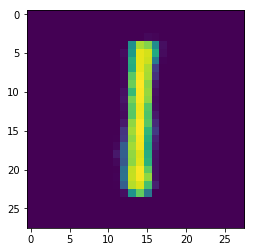

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  7



  0%|          | 1/214 [00:02<09:12,  2.59s/it]

[2 1 2 7 7 2 8 9 6 8 5 7 7 1 9 2 1 6 2 2 8 9 1 7 4 2 5 4 3 3 7 2 1 1 6 5 3
 7 0 7 3 5 0 9 8 3 9 8 8 9 9 6 0 7 0 4 9 0 1 7 9 4 4 6 0 8 7 5 7 0 1 2 0 2
 1 6 6 8 6 4 0 2 5 3 3 9 3 2 4 0 8 6 1 1 8 1 4 4 3 6 0 9 5 3 6 1 5 1 5 5 9
 9 0 3 4 7 8 4 1 5 2 6 8 7 7 4 0 8 0 6 4 9 4 6 6 5 4 3 1 6 3 5 2 1 7 8 3 6
 6 5 8 4 2 2 1 7 2 6 6 7 1 0 8 8 2 3 8 6 8 1 9 4 0 4 9 4 1 8 4 5 4 6 4 3 9
 1 7 7 9 4 0 6 9 4 2 1 2 6 3 7 7 6 6 4 7 2 0 7 2 1 4 1 1 4 1 8 4 4 6 3 7 3
 1 3 9 0 5 8 1 2 3 1 0 4 4 9 4 3 2 5 9 9 0 6 2 3 1 6 1 9 7 6 4 1 1 3]
[2 1 2 7 7 2 8 9 6 8 5 7 7 1 9 2 1 6 2 2 8 9 1 7 4 2 5 4 3 3 7 2 1 1 6 5 3
 7 0 7 3 5 0 9 8 3 9 8 8 9 9 6 0 7 0 4 9 0 1 7 9 4 4 6 0 8 7 5 7 0 1 2 0 2
 1 6 6 8 6 4 0 2 5 3 3 9 3 2 4 0 8 6 1 1 8 1 4 4 3 6 0 9 5 3 6 1 5 1 5 5 9
 9 0 3 4 7 8 4 1 5 2 6 8 7 7 4 0 8 0 6 4 9 4 6 6 5 4 3 1 6 3 5 2 1 7 8 3 6
 6 5 8 4 2 2 1 7 2 6 6 7 1 0 8 8 2 3 8 6 8 1 9 4 0 9 9 4 1 8 4 5 4 6 4 3 9
 1 7 7 9 4 0 6 9 4 2 1 2 6 3 7 7 6 6 4 7 2 0 7 2 1 4 1 1 4 1 8 4 4 6 3 7 3
 1 3 9 0 5 8 1 2 3 1 0 4 4 9 4


  1%|          | 2/214 [00:05<09:08,  2.59s/it]

[8 1 6 3 1 4 9 6 6 8 8 7 7 0 1 9 3 2 2 1 4 4 9 5 1 9 7 0 1 6 7 2 4 1 9 4 6
 5 9 0 6 7 0 3 3 6 8 5 1 3 1 7 4 4 7 2 9 5 8 3 5 0 2 6 4 7 4 0 8 9 9 5 7 3
 6 1 4 4 7 5 8 2 6 7 2 6 2 7 8 5 9 5 7 8 7 1 7 5 8 1 4 2 4 6 8 8 7 3 2 6 6
 9 8 6 2 3 1 8 7 3 1 3 6 4 3 8 7 1 9 1 3 9 2 1 5 0 9 3 0 3 1 3 1 2 4 8 9 3
 6 4 9 1 8 3 9 9 8 4 0 7 2 9 2 3 2 6 0 1 1 8 4 9 5 7 1 3 3 2 7 4 3 1 1 6 2
 2 6 9 7 4 4 2 6 0 8 1 4 4 9 4 9 5 2 9 7 0 1 7 6 8 6 8 3 2 9 8 1 6 1 5 4 1
 9 5 7 2 6 6 6 8 6 0 2 1 8 8 7 3 3 8 7 0 2 3 9 2 8 1 9 4 5 7 7 8 4 5]
[8 1 6 3 1 4 9 6 6 8 8 7 7 0 1 9 3 2 2 1 4 4 9 5 1 9 7 0 1 6 7 2 4 1 9 4 6
 5 9 0 6 7 0 3 3 6 8 5 1 3 1 7 4 4 7 2 9 5 8 3 5 0 2 6 4 7 4 0 8 9 4 5 7 3
 6 1 4 4 7 5 8 2 6 7 2 6 2 7 8 5 9 5 7 8 7 1 7 5 8 1 4 2 4 6 8 8 7 3 2 6 6
 9 8 6 2 3 1 8 7 3 1 3 6 4 3 8 7 1 9 1 3 9 2 1 5 0 9 3 0 3 1 3 1 2 4 8 9 3
 6 4 9 1 8 3 9 9 8 4 0 7 2 9 2 3 2 6 0 1 1 8 4 9 5 7 1 3 3 2 7 4 3 1 1 6 2
 2 6 9 7 4 4 2 6 0 8 1 4 4 9 4 9 5 2 9 7 0 1 7 6 8 6 8 3 2 9 8 1 6 1 5 4 1
 9 5 7 2 6 6 6 8 6 0 2 1 8 8 7


  1%|▏         | 3/214 [00:07<09:08,  2.60s/it]

[0 5 1 2 5 7 8 6 0 6 5 4 3 0 8 5 9 3 7 6 9 1 1 7 9 9 0 2 4 5 8 0 0 1 7 6 8
 5 8 6 1 3 6 7 5 6 7 2 7 6 7 1 1 3 4 3 4 4 7 5 8 1 2 1 0 7 0 8 4 0 7 6 3 7
 7 2 9 2 2 5 2 8 0 9 4 3 7 2 8 7 1 2 9 9 7 6 6 4 2 3 0 2 1 8 8 5 7 8 4 3 6
 1 2 5 4 3 6 1 0 2 8 2 9 6 0 6 2 3 7 5 4 0 1 5 5 7 6 5 9 3 3 9 1 4 1 2 0 2
 1 5 7 7 6 4 3 5 5 7 1 4 6 8 6 8 2 5 6 5 3 7 3 6 7 1 5 2 9 2 2 6 5 1 0 6 6
 1 0 9 9 6 7 8 9 0 2 1 8 7 7 8 9 7 7 3 1 9 3 9 9 4 1 6 3 1 0 0 7 9 0 5 5 6
 4 3 8 6 1 1 3 7 4 2 1 3 3 3 1 8 6 1 1 3 3 3 2 5 0 0 8 5 4 1 7 6 7 2]
[0 5 1 2 5 7 8 6 0 6 5 4 3 0 8 5 9 3 7 6 9 1 1 7 9 9 0 2 4 5 8 0 0 1 7 6 8
 5 8 6 1 3 6 7 5 6 7 2 7 6 7 1 1 3 4 3 4 4 7 5 8 1 2 1 0 7 0 8 4 0 7 6 3 7
 7 2 9 2 2 5 2 8 0 9 4 3 7 2 8 7 1 2 9 9 7 6 6 4 2 3 0 2 1 8 8 5 7 8 4 3 6
 1 2 5 4 3 6 1 0 2 8 2 9 6 0 6 2 3 7 5 4 0 1 5 5 7 6 5 9 3 3 9 1 4 1 2 0 2
 1 5 7 7 6 4 3 5 5 7 1 4 6 8 6 8 2 5 6 5 3 7 3 6 7 1 5 2 9 2 2 6 5 1 0 6 6
 1 0 9 9 6 7 8 9 0 2 1 8 7 7 8 9 7 7 3 1 9 3 9 9 4 1 6 3 1 0 0 7 9 0 5 5 6
 4 3 8 6 1 1 3 7 4 2 1 3 3 3 1


  2%|▏         | 4/214 [00:10<09:09,  2.61s/it]

[1 6 6 2 3 7 0 7 4 0 2 8 9 0 9 2 1 0 8 1 7 2 9 0 0 3 3 0 6 2 2 3 9 2 7 3 8
 3 2 5 0 7 1 3 0 6 5 2 1 1 0 3 4 1 1 6 3 6 4 5 3 8 1 9 2 9 1 4 8 1 2 9 0 3
 2 1 4 6 7 2 6 4 7 1 3 1 7 4 2 3 7 6 0 1 1 6 1 0 6 9 4 8 8 5 0 4 8 1 4 0 1
 2 3 2 5 4 0 3 6 6 9 9 0 8 0 9 4 9 4 4 7 7 5 0 8 2 0 7 4 4 6 6 2 4 5 6 6 2
 6 2 8 1 1 2 9 3 2 4 5 0 5 4 1 2 3 1 5 6 9 4 7 2 2 8 3 3 3 6 8 7 5 7 9 1 7
 2 1 1 4 8 9 6 0 4 6 2 2 4 7 6 8 2 2 3 2 6 3 7 3 2 7 0 9 8 9 8 6 4 2 8 3 7
 7 2 7 6 8 4 2 7 3 0 8 6 2 9 7 1 8 1 1 7 5 0 0 7 8 1 4 5 6 1 0 8 1 3]
[1 6 6 2 3 7 0 7 4 0 2 8 9 0 9 2 1 0 8 1 7 2 9 0 0 3 3 0 6 2 2 3 9 2 7 3 8
 3 2 5 0 7 1 3 0 6 5 2 1 1 0 3 4 1 1 6 3 6 4 5 3 8 1 9 2 9 1 4 8 1 2 9 0 3
 2 1 4 6 7 2 6 4 7 1 3 1 7 4 2 3 7 6 0 1 1 6 1 0 6 9 4 8 8 5 0 4 8 1 4 0 1
 2 3 2 5 4 0 3 6 6 9 9 0 8 0 9 4 9 4 4 7 7 5 0 8 2 0 7 4 4 6 6 2 4 5 6 6 2
 6 2 8 1 1 2 9 3 2 4 5 0 5 4 1 2 3 1 5 6 9 4 7 2 2 8 3 3 3 6 8 7 5 7 9 1 7
 2 1 1 4 8 9 6 0 4 6 2 2 4 7 6 8 2 2 3 2 6 3 7 3 2 7 0 9 8 9 8 6 4 2 8 3 7
 7 2 7 6 8 4 2 7 3 0 8 6 2 9 7


  2%|▏         | 5/214 [00:13<09:05,  2.61s/it]

[2 5 6 3 0 4 9 6 4 0 7 6 0 5 8 8 5 0 6 6 8 8 0 7 4 1 5 0 2 1 4 5 4 4 1 3 5
 6 3 4 6 0 8 8 5 6 0 0 7 8 4 2 4 2 2 9 6 2 3 8 5 6 9 0 4 4 1 3 5 7 0 0 4 1
 5 4 5 1 8 2 7 1 8 3 2 8 5 0 9 7 1 9 4 5 0 8 4 4 6 8 6 2 3 4 4 5 4 4 2 5 4
 9 3 1 2 2 7 1 0 2 7 5 7 3 1 7 1 3 2 1 6 4 5 5 1 9 4 6 2 8 5 0 3 8 6 0 7 3
 0 4 9 2 4 8 9 2 7 1 6 6 0 5 5 3 3 8 3 9 6 2 0 2 9 0 3 9 8 1 1 1 8 9 1 8 8
 9 5 9 7 8 8 2 3 2 7 6 6 5 7 4 1 9 3 6 7 5 5 0 5 5 9 5 7 4 8 6 5 4 2 8 8 8
 4 4 1 1 1 1 2 3 6 7 7 0 6 8 7 0 3 2 0 0 0 1 1 2 7 5 1 8 9 9 7 4 3 2]
[2 5 6 3 0 4 9 6 4 0 7 6 0 5 8 8 5 0 6 6 8 8 0 7 4 1 5 0 2 1 4 5 4 4 1 3 5
 6 3 4 6 0 8 8 5 6 0 0 7 8 4 2 4 2 2 9 6 2 3 8 5 6 9 0 4 4 1 3 5 7 0 0 4 1
 5 4 5 1 8 2 7 1 8 3 2 8 5 0 9 7 1 9 4 5 0 8 4 4 6 8 6 2 3 4 4 5 4 4 2 5 4
 9 3 1 2 2 7 1 0 2 7 5 7 3 1 7 1 3 2 1 6 4 5 5 1 9 4 6 2 8 5 0 3 8 6 0 7 3
 0 4 9 2 4 8 9 2 7 1 6 6 0 5 5 3 3 8 3 9 6 2 0 2 9 0 3 9 8 1 1 1 8 9 1 8 8
 9 5 9 7 8 8 2 3 2 7 6 6 5 7 4 1 9 3 6 7 5 5 0 5 5 9 5 7 4 8 6 5 4 2 8 8 8
 4 4 1 1 1 1 2 3 6 7 7 0 6 8 7


  3%|▎         | 6/214 [00:15<09:04,  2.62s/it]

[9 0 9 8 6 6 0 5 6 0 2 9 3 2 2 7 3 7 3 7 7 1 1 1 8 3 1 5 0 4 3 2 2 2 8 4 5
 5 4 3 1 1 9 5 7 6 3 4 2 9 2 9 5 6 7 0 2 2 9 6 2 9 5 1 8 4 0 3 5 0 0 1 7 1
 7 7 0 6 9 6 1 4 9 1 9 3 6 2 4 2 3 2 8 4 8 1 3 4 0 1 6 1 1 7 6 7 2 8 3 5 4
 2 7 8 1 4 2 7 9 0 4 5 3 1 6 2 6 7 0 6 2 5 4 1 0 3 9 2 1 6 2 9 1 4 7 4 4 7
 7 3 3 2 3 3 6 0 7 2 1 7 0 8 0 6 5 2 2 4 5 0 6 7 4 6 5 5 4 0 5 9 8 9 5 8 5
 4 6 9 6 7 1 6 2 1 8 2 7 8 9 6 8 1 1 7 2 9 8 2 9 3 2 8 7 4 3 9 0 7 8 2 0 7
 2 0 9 7 5 0 9 9 2 4 0 3 5 8 6 8 4 8 7 8 8 0 1 1 4 2 8 7 1 2 8 0 4 6]
[9 0 9 8 6 6 0 5 6 0 2 9 3 2 2 7 3 7 3 7 7 1 1 1 8 3 1 5 0 4 3 2 2 2 8 4 5
 5 4 3 1 1 9 5 7 6 3 4 2 9 2 9 5 6 7 0 2 2 9 6 2 9 5 1 8 4 0 3 5 0 0 1 7 1
 7 7 0 6 9 6 1 4 9 1 9 3 6 2 4 2 3 2 8 4 8 1 3 4 0 1 6 1 1 7 6 7 2 8 3 5 4
 2 7 8 1 4 2 7 9 0 4 5 3 1 6 2 6 7 0 6 2 5 4 1 0 3 9 2 1 6 2 9 1 4 7 4 4 7
 7 3 3 2 3 3 6 0 7 2 1 7 0 8 0 6 5 2 2 4 5 0 6 7 4 6 5 5 4 0 5 9 8 9 5 8 5
 4 6 9 6 7 1 6 2 1 8 2 7 8 9 6 8 1 1 7 2 9 8 2 9 3 2 8 7 4 3 9 0 7 8 2 0 7
 2 0 9 7 5 0 9 9 2 4 0 3 5 8 6


  3%|▎         | 7/214 [00:18<09:01,  2.62s/it]

[8 7 1 4 4 5 9 8 5 9 2 0 6 0 4 0 1 4 4 8 4 6 7 6 2 0 4 2 7 3 4 4 8 2 8 8 7
 4 4 3 3 1 1 4 8 4 5 9 3 8 3 7 1 0 3 9 4 4 8 8 0 2 1 2 9 7 0 9 6 4 1 2 6 2
 2 3 3 4 7 7 7 8 9 3 0 3 1 8 9 2 7 5 4 2 0 3 1 2 4 0 3 5 2 1 5 3 2 5 2 3 6
 4 9 2 6 1 3 2 4 5 9 0 9 4 9 2 7 8 7 2 1 3 9 0 9 4 1 7 1 4 3 9 4 8 8 1 5 3
 4 4 9 4 8 4 9 0 2 6 5 6 4 0 7 5 9 2 4 5 0 8 8 2 7 6 0 0 9 5 9 6 1 5 6 5 8
 0 2 0 5 7 6 8 9 3 5 5 0 3 8 0 2 8 9 2 7 8 3 5 2 6 5 6 2 9 7 0 1 1 4 1 6 4
 1 4 8 6 7 2 6 1 1 8 6 6 3 8 8 2 3 7 3 3 1 7 6 9 1 1 8 9 1 5 6 8 9 1]
[8 7 1 4 4 5 9 8 5 9 2 0 6 0 4 0 1 4 4 8 4 6 7 6 2 0 4 2 7 3 4 4 8 2 8 8 7
 4 4 3 3 1 1 4 8 4 5 9 3 8 3 7 1 0 3 9 4 4 8 8 0 2 1 2 9 7 0 9 6 4 1 2 6 2
 2 3 3 4 7 7 7 8 9 3 0 3 1 8 9 2 7 5 4 2 0 3 1 2 4 0 3 5 2 1 5 3 2 5 2 3 6
 4 9 2 6 1 3 2 4 5 9 0 9 4 9 2 7 8 7 2 1 3 9 0 9 4 1 7 1 4 3 9 4 8 8 1 5 3
 4 4 9 4 8 4 9 0 2 6 5 6 4 0 7 5 9 2 4 5 0 8 8 2 7 6 0 0 9 5 9 6 1 5 6 5 8
 0 2 0 5 7 6 8 9 3 5 5 0 3 8 0 2 8 9 2 7 8 3 5 2 6 5 6 2 9 7 0 1 1 4 1 6 4
 1 4 8 6 7 2 6 1 1 8 6 6 3 8 8


  4%|▎         | 8/214 [00:20<08:59,  2.62s/it]

[9 5 3 9 4 1 1 8 6 0 4 0 3 6 2 9 3 6 0 5 9 0 1 8 3 0 7 4 4 9 9 8 7 5 0 3 4
 5 3 5 8 0 9 8 8 7 4 3 2 9 3 6 0 7 7 7 3 7 2 8 0 3 9 0 7 2 3 9 6 4 4 6 4 2
 0 3 6 7 3 8 3 3 6 0 4 4 8 1 7 7 2 9 7 9 3 2 1 3 8 6 3 2 5 2 1 9 1 2 5 2 8
 8 0 1 3 8 1 2 1 8 9 0 3 9 7 6 0 0 9 2 5 0 7 5 6 8 5 0 8 0 9 2 7 7 0 6 1 0
 7 3 7 6 2 0 5 6 7 6 1 3 2 0 7 7 6 0 4 6 3 9 8 2 6 7 5 0 8 0 4 1 0 2 9 5 1
 5 0 3 8 0 2 3 8 8 5 8 6 8 5 3 5 9 4 9 6 6 5 0 8 7 7 8 5 9 1 7 8 8 9 1 4 4
 9 6 9 4 2 8 0 8 6 1 4 1 7 7 9 4 1 4 5 6 4 6 3 9 4 5 0 1 3 0 4 3 1 8]
[9 5 3 9 4 1 1 8 6 0 4 0 3 6 2 9 3 6 0 5 9 0 1 8 3 0 7 4 4 9 9 8 7 5 0 3 4
 5 3 5 8 0 9 8 8 7 4 3 2 9 3 6 0 7 7 7 3 7 2 8 0 3 9 0 7 2 3 9 6 4 4 6 4 2
 0 3 6 7 3 8 3 3 6 0 4 4 8 1 7 7 2 9 7 9 3 2 1 3 8 6 3 2 5 2 1 9 1 2 5 2 8
 8 0 1 3 8 1 2 1 8 9 0 3 9 7 6 0 0 9 2 5 0 7 5 6 8 5 0 8 0 9 2 7 7 0 6 1 0
 7 3 7 6 2 0 5 6 7 6 1 3 2 0 7 7 6 0 4 6 3 9 8 2 6 7 5 0 8 0 4 1 0 2 9 5 1
 5 0 3 8 0 2 3 8 8 5 8 6 8 5 3 5 9 4 9 6 6 5 0 8 7 7 8 5 9 1 7 8 8 9 1 4 4
 9 6 9 4 2 8 0 8 6 1 4 1 7 7 9


  4%|▍         | 9/214 [00:23<08:57,  2.62s/it]

[1 0 4 4 8 4 9 9 1 0 1 6 5 1 8 7 2 6 9 4 6 6 0 3 3 7 6 1 6 6 9 4 0 1 0 7 6
 4 5 9 6 6 8 7 9 4 1 2 1 6 4 9 0 2 8 0 0 8 2 0 2 9 4 8 1 3 7 1 7 9 2 9 2 3
 8 6 8 7 7 3 6 4 5 4 0 7 7 4 6 4 8 6 6 2 0 2 5 0 5 9 7 8 2 4 0 3 6 1 1 2 1
 0 1 0 9 6 7 7 5 5 1 9 0 4 2 3 5 5 8 0 0 6 9 9 1 7 0 5 3 2 7 7 1 8 0 9 5 7
 7 1 1 0 4 6 9 0 0 3 7 0 6 9 9 5 9 4 8 5 7 7 2 7 1 0 2 2 0 7 9 1 5 3 8 2 5
 2 4 4 0 3 8 1 7 4 8 0 3 8 8 6 2 1 5 0 5 1 9 3 1 5 6 4 0 9 7 3 9 0 4 6 1 2
 3 4 0 2 6 6 1 1 0 2 4 1 4 6 0 4 4 4 3 1 2 9 8 1 3 4 2 4 0 1 5 8 7 9]
[1 0 4 4 8 4 9 9 1 0 1 6 5 1 8 7 2 6 9 4 6 6 0 3 3 7 6 1 6 6 9 4 0 1 0 7 6
 4 5 9 6 6 8 7 9 4 1 2 1 6 4 9 0 2 8 0 0 8 2 0 2 9 4 8 1 3 7 1 7 9 2 9 2 3
 8 6 8 7 7 3 6 4 5 4 0 7 7 4 6 4 8 6 6 2 0 2 5 0 5 9 7 8 2 4 0 3 6 1 1 2 1
 0 1 0 9 6 7 7 5 5 1 9 0 4 2 3 5 5 8 0 0 6 9 9 1 7 0 5 3 2 7 7 1 8 0 9 5 7
 7 1 1 0 4 6 9 0 0 3 7 0 6 9 9 5 9 4 8 5 7 7 2 7 1 0 2 2 0 7 9 1 5 3 8 2 5
 2 4 4 0 3 8 1 7 4 8 0 3 8 8 6 2 1 5 0 5 1 9 3 1 5 6 4 0 9 7 3 9 0 4 6 1 2
 3 4 0 2 6 6 1 1 0 2 4 1 4 6 0


  5%|▍         | 10/214 [00:26<08:54,  2.62s/it]

[3 4 0 2 2 3 0 1 2 1 7 2 3 2 7 0 9 1 9 3 7 5 9 9 1 2 0 0 5 1 1 5 9 8 7 2 5
 0 0 0 0 7 9 9 1 5 8 3 5 6 4 6 1 4 3 3 9 8 3 5 3 3 7 7 9 9 1 7 1 3 4 5 8 7
 5 4 7 3 8 8 2 9 4 0 0 1 0 8 2 7 3 6 0 7 1 4 4 1 5 3 3 3 4 2 5 2 9 4 7 8 7
 0 1 6 7 5 7 2 6 8 0 6 3 6 5 4 0 1 9 1 8 0 7 4 7 3 3 7 8 0 9 6 2 3 6 1 7 5
 1 5 8 9 3 0 8 8 9 7 6 4 6 9 0 0 7 4 1 8 6 2 8 7 2 7 2 7 2 7 4 0 0 9 6 2 1
 1 1 7 0 8 3 5 2 8 3 5 5 5 6 2 8 1 1 7 9 7 6 7 3 0 0 0 7 1 3 9 8 7 0 0 5 4
 1 0 4 1 9 3 1 1 3 1 6 4 0 9 5 9 2 0 3 0 6 4 3 2 9 3 2 8 8 6 9 1 2 1]
[3 4 0 2 2 3 0 1 2 1 7 2 3 2 7 0 9 1 9 3 7 5 9 9 1 2 0 0 5 1 1 5 9 8 7 2 5
 0 0 0 0 7 9 9 1 5 8 3 5 6 4 6 1 4 3 3 9 8 3 5 3 3 7 7 9 9 1 7 1 3 4 5 8 7
 5 4 7 3 8 8 2 9 4 0 0 1 0 8 2 7 3 6 0 7 1 4 4 1 5 3 3 3 4 2 5 2 9 4 7 8 7
 0 1 6 7 5 7 2 6 8 0 6 3 6 5 4 0 1 9 1 8 0 7 4 7 3 3 7 8 0 9 6 2 3 6 1 7 5
 1 5 8 9 3 0 8 8 9 7 6 4 6 9 0 0 7 4 1 8 6 2 8 7 2 7 2 7 2 7 4 0 0 9 6 2 1
 1 1 7 0 8 3 5 2 8 3 5 5 5 6 2 8 1 1 7 9 7 6 7 3 0 0 0 7 1 3 9 8 7 0 0 5 4
 1 0 4 1 9 3 1 1 3 1 6 4 0 9 5


  5%|▌         | 11/214 [00:28<08:52,  2.62s/it]

[1 2 7 8 6 0 1 4 6 1 3 1 8 5 2 7 4 7 1 6 0 0 4 9 3 2 3 7 2 1 5 9 1 1 4 3 3
 4 3 8 4 1 6 1 5 8 2 6 4 1 4 6 3 7 2 8 9 0 0 0 1 4 1 8 8 9 0 0 5 2 9 9 4 5
 6 2 1 4 8 9 3 3 9 3 7 4 9 4 4 7 2 7 6 9 3 0 4 6 6 2 4 7 7 9 3 6 0 2 6 2 9
 2 5 4 7 1 7 0 0 4 9 3 6 1 4 5 4 1 8 7 6 5 8 4 7 1 4 1 5 5 1 2 7 7 2 3 5 4
 0 7 3 5 7 4 2 8 4 7 8 2 8 8 5 0 8 4 2 5 4 0 6 4 0 0 7 2 5 3 3 4 8 4 8 0 8
 7 2 6 1 2 0 1 6 0 0 5 6 9 0 3 3 1 7 6 9 1 9 1 0 6 9 9 2 6 2 4 6 5 2 9 5 3
 2 8 8 1 2 7 2 6 7 0 9 7 8 7 3 9 5 7 5 4 2 3 0 8 4 3 4 6 3 5 1 9 3 4]
[1 2 7 8 6 0 1 4 6 1 3 1 8 5 2 7 4 7 1 6 0 0 4 9 3 2 3 7 2 1 5 9 1 1 4 3 3
 4 3 8 4 1 6 1 5 8 2 6 4 1 4 6 3 7 2 8 9 0 0 0 1 4 1 8 8 9 0 0 5 2 9 9 4 5
 6 2 1 4 8 9 3 3 9 3 7 4 9 4 4 7 2 7 6 9 3 0 4 6 6 2 4 7 7 9 3 6 0 2 6 2 9
 2 5 4 7 1 7 0 0 4 9 3 6 1 4 5 4 1 8 7 6 5 8 4 7 1 4 1 5 5 1 2 7 7 2 3 5 4
 0 7 3 5 7 4 2 8 4 7 8 2 8 8 5 0 8 4 2 5 4 0 6 4 0 0 7 2 5 3 3 4 8 4 8 0 8
 7 2 6 1 2 0 1 6 0 0 5 6 9 0 3 3 1 7 6 9 1 9 1 0 6 9 9 2 6 2 4 6 5 2 9 5 3
 2 8 8 1 2 7 2 6 7 0 9 7 8 7 3


  6%|▌         | 12/214 [00:31<08:50,  2.63s/it]

[3 4 6 5 9 4 0 5 1 2 8 5 6 0 1 8 7 2 1 4 9 7 9 4 0 6 9 2 6 4 5 3 1 5 1 6 1
 9 0 9 4 4 9 2 7 2 7 1 8 8 2 4 2 5 9 8 9 9 1 7 6 4 7 8 1 6 5 2 0 3 2 2 8 5
 1 1 7 1 2 2 4 3 3 0 7 6 1 5 6 2 5 5 6 3 9 7 6 6 0 7 8 4 8 2 1 5 7 7 3 0 6
 2 4 8 2 4 3 2 1 8 4 5 4 7 4 8 8 6 6 3 7 3 4 8 2 8 2 3 9 3 9 5 4 0 5 2 3 0
 5 8 1 9 8 6 2 0 0 3 7 8 5 6 5 1 3 7 2 2 1 3 2 7 5 9 2 2 2 1 5 1 4 7 5 3 1
 3 8 3 5 2 9 6 0 7 2 7 2 9 9 8 2 1 2 2 0 2 7 1 7 9 0 5 3 6 7 3 1 1 8 7 9 6
 1 5 5 2 4 0 7 4 4 6 3 7 6 2 3 6 5 6 9 9 1 3 5 6 6 5 7 6 3 2 1 9 6 9]
[3 4 6 5 9 4 0 5 1 2 8 5 6 0 1 8 7 2 1 4 9 7 9 4 0 6 9 2 6 4 5 3 1 5 1 6 1
 9 0 9 4 4 9 2 7 2 7 1 8 8 2 4 2 5 9 8 9 9 1 7 6 4 7 8 1 6 5 2 0 3 2 2 8 5
 1 1 7 1 2 2 4 3 3 0 7 6 1 5 6 2 5 5 6 3 9 7 6 6 0 7 8 4 8 2 1 5 7 7 3 0 6
 2 4 8 2 4 3 2 1 8 4 5 4 7 4 8 8 6 6 3 7 3 4 8 2 8 2 3 9 3 9 5 4 0 5 2 3 0
 5 8 1 9 8 6 2 0 0 3 7 8 5 6 5 1 3 7 2 2 1 3 2 7 5 9 2 2 2 1 5 1 4 7 5 3 1
 3 8 3 5 2 9 6 0 7 2 7 2 9 9 8 2 1 2 2 0 2 7 1 7 9 0 5 3 6 7 3 1 1 8 7 9 6
 1 5 5 2 4 0 7 4 4 6 3 7 6 2 3


  6%|▌         | 13/214 [00:34<08:48,  2.63s/it]

[1 6 3 8 1 1 8 1 7 1 3 4 0 3 6 0 5 5 5 5 3 0 8 4 2 1 5 9 9 7 7 6 8 8 7 2 9
 1 6 9 2 0 6 2 6 4 5 0 1 8 2 6 5 1 1 0 1 7 9 6 7 2 0 3 1 4 8 9 5 7 8 4 9 5
 7 0 3 2 7 8 3 7 1 7 3 2 5 1 0 8 6 8 7 3 4 8 7 0 6 4 9 7 3 2 8 9 9 7 5 7 5
 5 2 4 1 2 3 2 0 6 2 1 9 5 8 0 6 3 7 6 9 5 7 4 9 6 6 7 4 2 5 9 7 1 8 2 7 7
 0 1 8 1 9 9 1 2 6 7 2 1 9 5 2 1 1 3 5 6 9 7 8 8 9 9 6 7 7 1 7 9 9 8 2 2 0
 2 0 7 4 2 5 9 7 9 5 8 3 9 1 8 1 6 2 8 3 7 3 1 2 6 6 6 0 2 5 3 3 7 9 9 1 4
 7 0 8 9 4 0 8 2 4 2 2 7 6 1 4 8 0 1 0 2 9 5 2 4 0 2 3 5 4 8 8 0 0 2]
[1 6 3 8 1 1 8 1 7 1 3 4 0 3 6 0 5 5 5 5 3 0 8 4 2 1 5 9 9 7 7 6 8 8 7 2 9
 1 6 9 2 0 6 2 6 4 5 0 1 8 2 6 5 1 1 0 1 7 9 6 7 2 0 3 1 4 8 9 5 7 8 4 9 5
 7 0 3 2 7 8 3 7 1 7 3 2 5 1 0 8 6 8 7 3 4 8 7 0 6 4 9 7 3 2 8 9 9 7 5 7 5
 5 2 4 1 2 3 2 0 6 2 1 9 5 8 0 6 3 7 6 9 5 7 4 9 6 6 7 4 2 5 9 7 1 8 2 7 7
 0 1 8 1 9 9 1 2 6 7 2 1 9 5 2 1 1 3 5 6 9 7 8 8 9 9 6 7 7 1 7 9 9 8 2 2 0
 2 0 7 4 2 5 9 7 9 5 8 3 9 1 8 1 6 2 8 3 7 3 1 2 6 6 6 0 2 5 3 3 7 9 9 1 4
 7 0 8 9 4 0 8 2 4 2 2 7 6 1 4


  7%|▋         | 14/214 [00:36<08:45,  2.63s/it]

[7 8 0 6 6 9 3 6 8 4 6 3 1 6 6 7 1 4 4 9 2 3 9 8 4 3 4 9 3 2 5 1 6 7 3 9 4
 2 4 8 8 6 2 7 3 5 3 4 7 5 7 3 7 8 6 5 5 3 4 0 1 2 1 9 7 6 3 6 5 6 6 3 0 8
 7 1 7 3 9 1 2 5 0 9 5 7 1 5 6 9 0 3 8 3 5 3 2 9 8 2 0 3 1 4 3 5 8 9 2 2 8
 8 5 1 1 4 4 9 7 1 0 8 2 0 5 6 9 1 2 9 9 4 4 7 4 7 5 0 7 9 5 9 4 4 7 2 1 5
 8 2 8 3 3 4 5 2 9 3 0 1 5 6 4 5 6 0 6 9 2 4 8 7 8 7 8 4 8 2 4 9 5 4 1 5 5
 1 7 9 1 2 9 8 1 2 5 4 5 9 3 6 4 7 2 9 5 9 9 3 7 4 8 3 1 8 2 2 3 6 2 5 5 2
 5 2 2 0 0 6 3 2 1 5 0 3 1 0 9 4 4 8 5 4 9 6 5 5 1 2 3 1 0 4 9 7 9 0]
[7 8 0 6 6 9 3 6 8 4 6 3 1 6 6 7 1 4 4 9 2 3 9 8 4 3 4 9 3 2 5 1 6 7 3 9 4
 2 4 8 8 6 2 7 3 5 3 4 7 5 7 3 7 8 6 5 5 3 4 0 1 2 1 9 7 6 3 6 5 6 6 3 0 8
 7 1 7 3 9 1 2 5 0 9 5 7 1 5 6 9 0 3 8 3 5 3 2 9 8 2 0 3 1 4 3 5 8 9 2 2 8
 8 5 1 1 4 4 9 7 1 0 8 2 0 5 6 9 1 2 9 9 4 4 7 4 7 5 0 7 9 5 9 4 4 7 2 1 5
 8 2 8 3 3 4 5 2 9 3 0 1 5 6 4 5 6 0 6 9 2 4 8 7 8 7 8 4 8 2 4 9 5 4 1 5 5
 1 7 9 1 2 9 8 1 2 5 4 5 9 3 6 4 7 2 9 5 9 9 3 7 4 8 3 1 8 2 2 3 6 2 5 5 2
 5 2 2 0 0 6 3 2 1 5 0 3 1 0 9


  7%|▋         | 15/214 [00:39<08:43,  2.63s/it]

[0 1 7 3 9 1 9 0 2 4 9 6 2 9 2 9 8 6 5 1 8 7 8 7 6 5 5 3 6 3 8 0 6 3 8 3 6
 4 2 8 0 2 1 1 0 1 1 9 2 4 7 7 4 6 0 7 0 5 4 7 4 8 3 4 8 3 8 2 1 8 8 3 8 8
 4 8 6 2 7 7 0 1 1 0 7 3 8 0 9 2 0 6 1 6 2 5 0 1 0 8 4 1 8 1 0 6 9 3 2 2 7
 8 9 7 2 9 3 6 5 0 2 2 5 3 1 1 6 4 8 7 5 2 7 8 2 8 6 3 2 4 6 3 2 2 1 6 5 6
 7 5 6 8 2 5 3 1 1 1 4 4 3 7 1 4 5 8 8 8 2 4 2 5 9 9 1 9 9 4 6 0 6 5 2 3 5
 0 8 6 7 3 0 9 2 5 4 7 4 4 9 0 1 9 3 9 7 4 0 2 1 0 3 4 4 4 7 8 7 6 8 4 8 8
 0 5 1 8 4 3 0 1 4 5 9 1 9 3 3 7 1 8 5 7 0 8 4 0 1 9 3 5 5 5 0 8 2 6]
[0 1 7 3 9 1 9 0 2 4 9 6 2 9 2 9 8 6 5 1 8 7 8 7 6 5 5 3 6 3 8 0 6 3 8 3 6
 4 2 8 0 2 1 1 0 1 1 9 2 4 7 7 4 6 0 7 0 5 4 7 4 8 3 4 8 3 8 2 1 8 8 3 8 8
 4 8 6 2 7 7 0 1 1 0 7 3 8 0 9 2 0 6 1 6 2 5 0 1 0 8 4 1 8 1 0 6 9 3 2 2 7
 8 9 7 2 9 3 6 5 0 2 2 5 3 1 1 6 4 8 7 5 2 7 8 2 8 6 3 2 4 6 3 2 2 1 6 5 6
 7 5 6 8 2 5 3 1 1 1 4 4 3 7 1 4 5 8 8 8 2 4 2 5 9 9 1 9 9 4 6 0 6 5 2 3 5
 0 8 6 7 3 0 9 2 5 4 7 4 4 9 0 1 9 3 9 7 4 0 2 1 0 3 4 4 4 7 8 7 6 8 4 8 8
 0 5 1 8 4 3 0 1 4 5 9 1 9 3 3


  7%|▋         | 16/214 [00:42<08:40,  2.63s/it]

[2 2 1 6 2 3 3 2 1 6 0 2 8 4 6 8 6 9 0 1 7 6 4 2 3 3 5 0 2 2 2 6 4 7 5 1 7
 7 8 3 8 0 0 2 9 1 0 1 4 6 1 5 9 1 5 1 8 5 8 0 6 1 0 8 4 4 8 9 7 3 0 7 6 6
 3 4 9 8 5 5 1 2 9 6 9 1 6 0 3 8 6 4 3 2 4 3 8 7 7 9 6 7 0 0 4 8 5 0 1 9 4
 1 7 1 0 2 3 2 3 5 7 9 2 7 8 2 0 3 7 7 6 8 2 3 3 2 4 4 7 1 4 2 1 5 7 5 1 1
 6 8 1 8 7 4 8 2 1 3 6 4 7 7 6 3 2 2 3 1 1 8 7 7 3 6 3 1 8 0 4 8 1 7 6 5 8
 4 9 6 7 1 0 4 3 8 2 7 8 6 4 2 3 7 6 6 1 3 1 2 9 9 5 8 1 6 9 3 1 2 0 1 7 5
 1 8 0 1 8 8 8 8 9 6 7 9 4 6 9 0 9 4 4 5 6 6 0 4 0 9 1 2 3 0 6 6 0 5]
[2 2 1 6 2 3 3 2 1 6 0 2 8 4 6 8 6 9 0 1 7 6 4 2 3 3 5 0 2 2 2 6 4 7 5 1 7
 7 8 3 8 0 0 2 9 1 0 1 4 6 1 5 9 1 5 1 8 5 8 0 6 1 0 8 4 4 8 9 7 3 0 7 6 6
 3 4 9 8 5 5 1 2 9 6 9 1 6 0 3 8 6 4 3 2 4 3 8 2 7 9 6 7 0 0 4 8 5 0 1 9 4
 1 7 1 0 2 3 2 3 5 7 9 2 7 8 2 0 3 7 7 6 8 2 3 3 2 4 4 7 1 4 2 1 5 7 5 1 1
 6 8 1 8 7 4 8 2 1 3 6 4 7 7 6 3 2 2 3 1 1 8 7 7 3 6 3 1 8 0 4 8 1 7 6 5 8
 4 9 6 7 1 0 4 3 8 2 7 8 6 4 2 3 7 6 6 1 3 1 2 9 9 5 8 1 6 9 3 1 2 0 1 7 5
 1 8 0 1 8 8 8 8 9 6 7 9 4 6 9


  8%|▊         | 17/214 [00:44<08:37,  2.63s/it]

[1 2 1 7 3 6 1 8 9 7 3 6 5 0 2 1 4 6 4 0 6 8 7 7 1 0 1 6 5 2 9 0 3 7 1 5 3
 4 2 8 6 8 8 9 7 5 6 1 1 8 6 8 2 4 6 3 6 3 6 6 7 9 9 1 6 3 5 4 5 2 4 7 9 9
 9 0 4 5 7 9 5 9 4 7 7 5 4 8 8 7 7 4 7 0 3 7 9 8 5 0 9 2 4 9 4 5 8 3 4 4 6
 0 1 0 8 7 0 8 2 9 0 4 3 1 5 6 6 6 3 7 4 2 9 4 7 8 0 9 3 7 3 8 4 2 1 7 9 2
 0 4 9 7 1 1 9 0 7 0 7 7 4 3 1 2 7 5 0 2 1 7 8 9 6 5 1 5 9 6 8 5 8 2 0 0 5
 5 5 6 8 7 7 2 6 2 6 3 7 6 2 6 3 6 8 3 6 6 7 9 9 9 6 8 5 2 1 9 9 1 6 2 1 3
 4 8 1 0 6 2 6 3 4 7 7 7 9 0 2 3 1 5 9 7 2 9 8 8 4 4 3 1 8 5 9 7 4 9]
[1 2 1 7 3 6 1 8 9 7 3 6 5 0 2 1 4 6 4 0 6 8 7 7 1 0 1 6 5 2 9 0 3 7 1 5 3
 4 2 8 6 8 8 9 7 5 6 1 1 8 6 8 2 4 6 3 6 3 6 6 7 9 9 1 6 3 5 4 5 2 4 7 9 9
 9 0 4 5 7 9 5 9 4 7 7 5 4 8 8 7 7 4 7 0 3 7 9 7 5 0 9 2 4 9 4 5 8 3 4 4 6
 0 1 0 8 7 0 8 2 9 0 4 3 1 5 6 6 6 3 7 4 2 9 4 7 8 0 9 3 7 3 8 4 2 1 7 9 2
 0 4 9 7 1 1 9 0 7 0 7 7 4 3 1 2 7 5 0 2 1 7 8 9 6 5 1 5 9 6 8 5 8 2 0 0 5
 5 5 6 8 7 7 2 6 2 6 3 7 6 2 6 3 6 8 3 6 6 7 9 9 9 6 8 5 2 1 9 9 1 6 2 1 3
 4 8 1 0 6 2 6 3 4 7 7 7 9 0 2


  8%|▊         | 18/214 [00:47<08:35,  2.63s/it]

[1 9 0 4 2 0 0 6 3 9 9 2 7 6 5 3 7 4 9 9 7 7 5 3 5 4 7 8 2 4 2 0 7 9 4 6 2
 6 0 2 7 6 2 4 5 8 8 1 0 1 8 0 5 5 0 3 4 2 9 2 2 4 1 9 2 0 1 5 5 9 0 3 2 7
 0 2 6 5 8 3 5 6 3 6 5 7 2 2 8 8 1 2 9 0 9 4 3 1 5 5 8 4 9 9 9 2 9 7 3 2 1
 8 9 3 3 1 9 6 1 0 4 4 1 8 7 1 4 0 7 0 2 3 3 5 0 9 3 7 2 1 3 5 8 3 0 4 0 7
 9 2 9 5 2 1 5 3 2 7 1 8 4 0 6 9 4 6 1 6 8 9 5 7 0 1 3 9 2 0 6 5 0 4 8 7 6
 2 1 0 2 0 9 1 7 9 0 0 4 2 9 5 2 7 7 9 1 8 2 7 2 3 4 8 7 3 3 1 9 5 9 5 0 9
 3 0 7 7 3 0 5 2 6 6 7 6 6 3 7 3 2 5 3 9 9 1 7 8 7 4 6 2 6 3 8 2 2 8]
[1 9 0 4 2 0 0 6 3 9 9 2 7 6 5 3 7 4 9 9 3 3 5 3 5 4 7 8 2 4 2 0 7 9 4 6 2
 6 0 2 7 6 2 4 5 8 8 1 0 1 8 0 5 5 0 3 4 2 9 2 2 4 1 9 2 0 1 5 5 9 0 3 2 7
 0 2 6 5 8 3 5 6 3 6 5 7 2 2 8 8 1 2 9 0 9 4 3 1 5 5 8 4 9 9 9 2 9 7 3 2 1
 8 9 3 3 1 9 6 1 0 4 4 1 8 7 1 4 0 7 0 2 3 3 5 0 9 3 7 2 1 3 5 8 3 0 4 0 7
 9 2 9 5 2 1 5 3 2 7 1 8 4 0 6 9 4 6 1 6 8 9 5 7 0 1 3 9 2 0 6 5 0 4 8 7 6
 2 1 0 2 0 9 1 7 9 0 0 4 2 9 5 2 7 7 9 1 8 2 7 2 3 4 8 7 3 3 1 9 5 9 5 0 9
 3 0 7 7 3 0 5 2 6 6 7 6 6 3 7


  9%|▉         | 19/214 [00:50<08:33,  2.63s/it]

[1 7 5 4 4 1 0 6 9 1 5 4 3 3 5 2 6 1 9 3 6 5 7 7 2 0 9 3 0 1 7 2 2 6 8 3 6
 1 3 5 2 5 3 9 7 4 5 2 3 6 8 9 6 1 5 0 9 8 6 0 2 9 6 3 6 0 7 9 3 6 4 0 1 3
 0 6 7 8 9 5 3 3 7 6 0 4 6 1 9 0 8 1 2 0 8 6 2 8 2 6 2 8 7 3 4 0 7 8 1 3 2
 1 8 4 8 0 8 2 8 2 8 2 4 3 4 2 2 8 6 2 3 7 1 3 1 8 4 6 7 4 5 8 0 6 8 1 0 6
 3 0 3 0 9 2 4 0 5 2 7 7 7 2 0 0 6 3 8 2 7 9 5 1 3 4 2 3 1 0 8 3 2 1 8 7 9
 0 4 3 3 3 5 0 3 8 2 8 7 9 8 2 1 3 6 8 8 7 0 7 3 0 4 1 2 3 4 4 0 3 2 7 4 1
 5 8 4 1 9 8 3 9 1 0 5 9 1 8 9 4 1 9 2 0 9 8 1 3 6 7 6 6 7 1 8 3 7 0]
[1 7 5 4 4 1 0 6 9 1 5 4 3 3 5 2 6 1 9 3 6 5 7 7 2 0 9 3 0 1 7 2 2 6 8 3 6
 1 3 5 2 5 3 9 7 4 5 2 3 6 8 9 6 1 5 0 9 8 6 0 2 9 6 3 6 0 7 9 3 6 4 0 1 3
 0 6 7 8 9 5 3 3 7 6 0 4 6 1 9 0 8 1 2 0 8 6 2 8 2 6 2 8 7 3 4 0 7 8 1 3 2
 1 8 4 8 0 8 2 8 2 8 2 4 3 4 2 2 8 6 2 3 7 1 3 1 8 4 6 7 4 5 8 0 6 8 1 0 6
 3 0 3 0 9 2 4 0 5 2 7 7 7 2 0 0 6 3 8 2 7 9 5 1 3 4 2 3 1 0 8 3 2 1 8 7 9
 0 4 3 3 3 5 0 3 8 2 8 7 9 8 2 1 3 6 8 8 7 0 7 3 0 4 1 2 3 4 4 0 3 2 7 4 1
 5 8 4 1 9 8 3 9 1 0 5 9 1 8 9


  9%|▉         | 20/214 [00:52<08:30,  2.63s/it]

[8 7 7 1 1 3 4 6 8 4 5 0 6 6 9 0 3 7 4 1 7 8 1 7 2 9 7 8 3 3 4 4 2 1 1 9 8
 0 2 9 7 2 9 4 3 5 0 9 5 1 8 2 6 1 7 0 1 0 3 0 1 1 8 5 7 9 7 7 1 9 7 1 1 8
 7 6 7 8 8 5 5 4 6 4 5 8 0 0 8 2 3 9 9 7 9 1 1 8 9 1 6 9 5 7 6 4 7 1 3 3 8
 3 6 4 8 3 1 9 9 0 2 6 5 2 2 2 9 1 7 0 9 9 8 7 7 0 3 8 8 5 8 7 7 8 7 8 0 3
 8 5 5 4 9 9 9 3 5 3 6 2 4 8 9 6 7 1 5 8 6 1 8 0 5 2 2 2 7 0 2 5 4 1 4 6 5
 1 3 9 1 9 1 9 7 6 9 9 4 6 7 6 4 7 0 0 7 1 7 3 0 2 5 9 3 3 5 5 8 1 7 6 4 6
 5 6 6 9 7 3 4 9 8 5 0 4 9 2 9 2 7 8 9 4 2 0 0 6 3 0 4 0 5 4 4 1 0 8]
[8 7 7 1 1 3 4 6 8 4 5 0 6 6 9 0 3 7 4 1 7 8 1 7 2 9 7 8 3 3 4 4 2 1 1 9 8
 0 2 9 7 2 9 4 3 5 0 9 5 1 8 2 6 1 7 0 1 0 3 0 1 1 8 5 7 9 7 7 1 9 7 1 1 8
 7 6 7 8 8 5 5 4 6 4 5 8 0 0 8 2 3 9 9 7 9 1 1 8 9 1 6 9 5 7 6 4 7 1 3 3 8
 3 6 4 8 3 1 9 9 0 2 6 5 2 2 2 9 1 7 0 9 9 8 7 7 0 3 8 8 5 8 7 7 8 7 8 0 3
 8 5 5 4 9 9 9 3 5 3 6 2 4 8 9 6 7 1 5 8 6 1 8 0 5 2 2 2 7 0 2 5 4 1 4 6 5
 1 3 9 1 9 1 9 7 6 9 9 4 6 7 6 4 7 0 0 7 1 7 3 0 2 5 9 3 3 5 5 8 1 7 6 4 6
 5 6 6 9 7 3 4 9 8 5 0 4 9 2 9


 10%|▉         | 21/214 [00:55<08:27,  2.63s/it]

[9 7 3 9 4 6 3 5 2 6 4 5 7 3 0 4 8 8 9 7 9 3 7 8 0 3 8 3 3 5 7 0 9 4 4 6 9
 7 3 9 9 7 5 3 5 7 2 9 7 9 7 2 0 6 4 6 1 6 2 5 4 1 9 4 9 9 7 1 4 5 3 6 5 2
 1 1 0 8 9 7 3 6 0 4 7 6 4 8 2 5 8 9 3 2 9 5 7 4 5 6 5 9 0 8 9 7 1 6 2 0 0
 0 9 7 2 7 3 5 6 8 1 6 6 9 9 1 2 8 0 5 2 8 9 2 4 2 1 4 9 8 7 0 2 7 5 4 1 1
 9 7 1 5 6 0 9 8 1 8 0 0 4 1 5 9 2 9 5 6 0 1 1 5 2 4 6 8 6 1 4 7 4 1 9 0 4
 4 9 0 9 4 7 1 6 9 9 2 4 4 7 4 4 7 7 2 8 7 3 2 1 3 1 6 9 5 6 9 5 3 3 9 3 5
 1 6 8 7 0 2 4 4 6 4 6 0 1 6 6 7 8 9 5 8 2 9 4 2 3 7 6 3 0 2 5 8 0 4]
[9 7 3 9 4 6 3 5 2 6 4 5 7 3 0 4 8 8 9 7 9 3 7 8 0 3 8 3 3 5 7 0 9 4 4 6 9
 7 3 9 9 7 5 3 5 7 2 9 7 9 7 2 0 6 4 6 1 6 2 5 4 1 9 4 9 9 7 1 4 5 3 6 5 2
 1 1 0 8 9 7 3 6 0 4 7 6 4 8 2 5 8 9 3 2 9 5 7 4 5 6 5 9 0 8 9 7 1 6 2 0 0
 0 9 7 2 7 3 5 6 8 1 6 6 9 9 1 2 8 0 5 2 8 9 2 4 2 1 4 9 8 7 0 2 7 5 4 1 1
 9 7 1 5 6 0 9 8 1 8 0 0 4 1 5 9 2 9 5 6 0 1 1 5 2 4 6 8 6 1 4 7 4 1 9 0 4
 4 9 0 9 4 7 1 6 9 9 2 4 4 7 4 4 7 7 2 8 7 3 2 1 3 1 6 9 5 6 9 5 3 3 9 3 5
 1 6 8 7 0 2 4 4 6 4 6 0 1 6 6


 10%|█         | 22/214 [00:57<08:24,  2.63s/it]

[0 5 0 0 3 3 0 6 9 7 5 2 3 6 5 4 0 4 1 4 6 4 6 4 2 6 2 2 1 9 7 7 7 3 2 7 1
 8 6 4 7 7 9 1 0 6 4 2 5 7 1 2 9 4 3 6 6 9 0 6 9 3 8 0 7 4 9 1 6 8 3 9 8 6
 7 9 9 5 4 2 0 2 5 0 1 0 6 0 6 9 8 0 9 1 0 1 6 2 1 1 1 2 7 5 0 7 5 8 1 3 0
 8 1 4 3 5 6 1 4 4 3 8 1 5 4 2 4 1 4 7 9 6 2 6 1 2 8 8 2 0 9 6 6 8 2 8 6 1
 9 9 8 3 2 8 7 1 9 3 1 8 1 2 1 2 9 9 8 7 0 0 8 2 7 5 1 8 8 1 4 5 0 8 1 9 0
 2 6 8 6 6 2 2 6 7 8 3 3 8 2 4 2 0 8 8 0 6 7 1 5 2 3 1 1 3 4 3 7 1 1 9 1 3
 8 5 9 0 9 5 8 8 5 4 6 5 7 4 4 2 8 3 2 3 5 7 7 4 3 0 9 5 7 1 8 8 1 6]
[0 5 0 0 3 3 0 6 9 7 5 2 3 6 5 4 0 4 1 4 6 4 6 4 2 6 2 2 1 9 7 7 7 3 2 7 1
 8 6 4 7 7 9 1 0 6 4 2 5 7 1 2 9 4 3 6 6 9 0 6 9 3 8 0 7 4 9 1 6 8 3 9 8 6
 7 9 9 5 4 2 0 2 5 0 1 0 6 0 6 9 8 0 9 1 0 1 6 2 1 1 1 2 7 5 0 7 5 8 1 3 0
 8 1 4 3 5 6 1 4 4 3 8 1 5 4 2 4 1 4 7 9 6 2 6 1 2 8 8 2 0 9 6 6 8 2 8 6 1
 9 9 8 3 2 8 7 1 9 3 1 8 1 2 1 2 9 9 8 7 0 0 8 2 7 5 1 8 8 1 4 5 0 8 1 9 0
 2 6 8 6 6 2 2 6 7 8 3 3 8 2 4 2 0 8 8 0 6 7 1 5 2 3 1 1 3 4 3 7 1 1 9 1 3
 8 5 9 0 9 5 8 8 5 4 6 5 7 4 4


 11%|█         | 23/214 [01:00<08:23,  2.63s/it]

[6 1 8 2 4 0 3 3 2 7 5 0 8 5 7 3 1 1 8 3 5 7 5 4 3 3 7 6 5 1 1 0 2 8 3 4 7
 5 0 2 8 5 8 9 2 6 0 8 4 0 5 6 7 9 0 2 6 2 4 1 9 6 7 7 9 2 9 6 6 2 6 9 4 7
 9 4 9 1 7 5 3 9 6 5 2 0 2 6 8 9 3 4 4 5 0 0 7 0 7 4 5 5 9 7 4 8 6 0 8 4 6
 5 9 8 7 5 6 2 1 7 1 9 1 8 8 3 7 3 1 7 3 9 6 5 6 0 7 5 1 4 3 1 6 6 5 4 5 3
 6 1 2 9 0 0 9 0 4 1 3 0 6 7 3 3 1 1 4 5 4 0 3 3 7 3 4 2 1 4 3 1 2 3 2 8 9
 7 9 2 1 1 8 3 2 6 3 5 0 9 5 2 4 1 5 3 4 9 7 5 3 2 5 8 1 6 5 5 8 6 2 4 9 7
 1 7 8 6 4 5 7 8 9 5 2 9 7 3 0 5 3 0 3 6 0 6 8 9 9 6 6 5 7 1 8 8 2 7]
[6 1 8 2 4 0 3 3 2 7 5 0 8 5 7 3 1 1 8 3 5 7 5 4 3 3 7 6 5 1 1 0 2 8 3 4 7
 5 0 2 8 5 8 9 2 6 0 8 4 0 5 6 7 9 0 2 6 2 4 1 9 6 7 7 9 2 9 6 6 2 6 9 4 7
 9 4 9 1 7 5 3 9 6 5 2 0 2 6 8 9 3 4 4 5 0 0 7 0 7 4 5 5 9 7 4 8 6 0 8 4 6
 5 9 8 7 5 6 2 1 7 1 9 1 8 8 3 7 3 1 7 3 9 6 5 6 0 7 5 1 4 3 1 6 6 5 4 5 3
 6 1 2 9 0 0 9 0 4 1 3 0 6 7 3 3 1 1 4 5 4 0 3 3 7 3 4 2 1 4 3 1 2 3 2 8 9
 7 9 2 1 1 8 3 2 6 3 5 0 9 5 2 4 1 5 3 4 9 7 5 3 2 5 8 1 6 5 5 8 6 2 4 9 7
 1 7 8 6 4 5 7 8 9 5 2 9 7 3 0


 11%|█         | 24/214 [01:03<08:20,  2.63s/it]

[6 4 6 2 9 1 2 7 9 2 9 7 5 5 4 2 1 7 9 5 7 2 4 4 1 3 7 6 1 1 5 4 7 5 7 1 3
 6 9 8 4 4 3 3 8 7 3 9 0 9 7 4 1 1 1 9 1 1 7 5 2 0 2 3 9 5 7 5 6 0 4 0 6 2
 2 6 3 5 0 9 4 9 9 9 1 2 1 5 3 9 5 7 6 7 1 8 8 4 7 5 9 9 1 3 3 8 1 3 9 5 2
 5 1 7 5 4 3 6 0 3 5 6 9 1 2 4 3 9 7 8 0 4 8 3 2 5 1 4 2 5 0 8 2 6 9 5 8 0
 4 3 7 6 0 7 9 1 5 7 3 8 4 4 9 8 1 4 9 0 7 2 1 9 5 0 0 2 4 0 1 2 7 8 9 2 1
 7 6 6 8 0 7 5 2 3 9 5 8 9 5 4 4 0 8 9 4 5 3 1 0 8 6 1 0 5 9 3 5 5 4 1 3 8
 9 5 7 1 7 2 4 2 2 1 8 3 9 6 3 6 1 1 5 1 0 5 3 6 2 9 4 0 8 8 7 0 5 0]
[6 4 6 2 9 1 2 7 9 2 9 7 5 5 4 2 1 7 9 5 7 2 4 4 1 3 7 6 1 1 5 4 7 5 7 1 3
 6 9 8 4 4 3 3 8 7 3 9 0 9 7 4 1 1 1 9 1 1 7 5 2 0 2 3 9 5 7 5 6 0 4 0 6 2
 2 6 3 5 0 9 4 9 9 9 1 2 1 5 3 9 5 7 6 7 1 8 8 4 7 5 9 9 1 3 3 8 1 3 9 5 2
 5 1 7 5 4 3 6 0 3 5 6 9 1 2 4 3 9 7 8 0 4 8 3 2 5 1 4 2 5 0 8 2 6 9 5 8 0
 4 3 7 6 0 7 9 1 5 7 3 8 4 4 9 8 1 4 9 0 7 2 1 9 5 0 0 2 4 0 1 2 7 8 9 2 1
 7 6 6 8 0 7 5 2 3 9 5 8 9 5 4 4 0 8 9 4 5 3 1 0 8 6 1 0 5 9 3 5 5 4 1 3 8
 9 5 7 1 7 2 4 2 2 1 8 3 9 6 3


 12%|█▏        | 25/214 [01:05<08:17,  2.63s/it]

[6 5 7 8 2 2 7 2 5 1 5 5 0 5 2 5 2 8 7 3 4 0 3 7 0 1 3 2 6 3 1 7 1 7 4 3 7
 3 6 4 5 2 9 6 2 4 1 1 7 1 9 6 6 5 5 0 9 0 3 3 4 0 2 8 0 9 9 8 9 8 9 5 5 3
 1 0 2 3 7 7 7 1 8 0 7 6 9 9 1 9 0 3 2 6 2 8 3 9 3 3 7 1 4 9 9 7 4 1 6 3 6
 6 0 6 4 6 4 5 5 3 5 3 7 5 1 6 8 7 0 8 4 8 7 5 1 2 3 3 0 2 5 4 1 3 9 0 3 3
 5 8 4 5 3 5 8 1 9 6 8 4 6 2 1 1 2 0 7 9 0 4 2 6 7 7 3 6 1 4 5 9 8 2 4 6 7
 2 6 2 2 3 1 8 9 0 2 3 7 0 6 7 1 0 6 5 0 9 8 4 0 2 3 0 8 2 1 4 5 0 2 4 3 7
 3 3 3 5 5 8 1 0 2 2 3 1 2 6 5 3 5 6 9 6 9 2 7 5 1 3 1 2 9 2 6 6 2 0]
[6 5 7 8 2 2 7 2 5 1 5 5 0 5 2 5 2 8 7 3 4 0 3 7 0 1 3 2 6 3 1 7 1 7 4 3 7
 3 6 4 5 2 9 6 2 4 1 1 7 1 9 6 6 5 5 0 9 0 3 3 4 0 2 8 0 9 9 8 9 8 9 5 5 3
 1 0 2 3 7 7 7 1 8 0 7 6 9 9 1 9 0 3 2 6 2 8 3 9 3 3 7 1 4 9 9 7 4 1 6 3 6
 6 0 6 4 6 4 5 5 3 5 3 7 5 1 6 8 7 0 8 4 8 7 5 1 2 3 3 0 2 5 4 1 3 9 0 3 3
 5 8 4 5 3 5 8 1 9 6 8 4 6 2 1 1 2 0 7 9 0 4 2 6 7 7 3 6 1 4 5 9 8 2 4 6 7
 2 6 2 2 3 1 8 9 0 2 3 7 0 6 7 1 0 6 5 0 9 8 4 0 2 3 0 8 2 1 4 5 0 2 4 3 7
 3 3 3 5 5 8 1 0 2 2 3 1 2 6 5


 12%|█▏        | 26/214 [01:08<08:14,  2.63s/it]

[6 3 1 8 3 8 8 8 8 1 9 3 8 5 9 9 7 1 2 2 6 6 0 9 9 8 7 0 3 7 3 2 9 7 9 1 8
 9 8 1 2 1 3 3 5 8 0 3 3 8 8 0 9 2 0 1 3 1 3 3 0 1 6 0 7 4 4 6 6 0 8 2 1 5
 7 1 7 6 1 8 4 3 1 7 7 8 2 0 6 2 1 9 7 8 1 1 2 4 5 8 2 1 7 2 6 9 3 2 7 9 7
 1 3 3 2 5 0 1 3 5 1 1 7 9 3 5 3 9 3 8 6 4 6 6 2 4 9 2 7 0 7 5 2 3 6 0 9 0
 5 1 6 2 3 9 5 1 6 3 2 5 5 5 4 6 7 0 7 4 1 7 4 6 7 4 8 3 7 3 0 7 4 8 6 6 0
 0 5 5 6 6 5 5 4 7 4 4 5 4 4 2 7 1 6 0 3 3 6 3 1 8 5 4 0 5 2 3 6 8 7 8 0 6
 1 7 2 0 9 4 0 0 1 7 7 9 6 1 4 1 0 9 0 3 8 9 7 1 4 6 2 0 0 7 6 0 8 3]
[6 3 1 8 3 8 8 8 8 1 9 3 8 5 9 9 7 1 2 2 6 6 0 9 9 8 7 0 3 7 3 2 9 7 9 1 8
 9 8 1 2 1 3 3 5 8 0 3 3 8 8 0 9 2 0 1 3 1 3 3 0 1 6 0 7 4 4 6 6 0 8 2 1 5
 7 1 7 6 1 8 4 3 1 7 7 8 2 0 6 2 1 9 7 8 1 1 2 4 5 8 2 1 7 2 6 9 3 2 7 9 7
 1 3 3 2 5 0 1 3 5 1 1 7 9 3 5 3 9 3 8 6 4 6 6 2 4 9 2 7 0 7 5 2 3 6 0 9 0
 5 1 6 2 3 9 5 1 6 3 2 5 5 5 4 6 7 0 7 4 1 7 4 6 7 4 8 3 7 3 0 7 4 8 6 6 0
 0 5 5 6 6 5 5 4 7 4 4 5 4 4 2 7 1 6 0 3 3 6 3 1 8 5 4 0 5 2 3 6 8 7 8 0 6
 1 7 2 0 9 4 0 0 1 7 7 9 6 1 4


 13%|█▎        | 27/214 [01:11<08:12,  2.63s/it]

[4 7 8 3 7 2 9 5 9 9 1 6 4 7 5 7 2 0 1 2 3 8 0 1 7 3 9 6 8 6 9 4 9 1 2 8 1
 6 5 5 3 5 7 4 9 8 8 2 3 0 7 4 2 2 8 3 9 9 6 9 2 6 9 5 9 9 2 1 8 6 6 0 2 2
 8 7 9 4 0 6 8 1 8 6 1 2 1 4 8 5 0 1 7 9 4 3 8 0 6 2 3 8 1 2 1 9 9 6 3 6 1
 9 1 2 6 8 1 7 0 6 8 3 5 2 0 2 4 9 9 3 8 3 1 3 6 3 4 5 9 3 1 9 5 9 0 9 0 0
 6 3 1 2 4 8 1 4 6 1 1 0 4 3 1 0 3 5 1 9 7 7 0 4 3 1 8 3 7 2 2 8 3 1 5 3 8
 5 7 8 4 1 5 2 8 1 8 4 9 3 0 2 2 1 9 5 9 1 4 1 5 2 8 9 4 4 1 1 4 4 4 3 7 0
 1 8 0 0 2 7 6 9 1 9 1 2 8 5 4 1 0 2 5 2 0 8 3 3 3 1 1 7 3 5 1 6 5 0]
[4 7 8 3 7 2 9 5 9 9 1 6 4 7 5 7 2 0 1 2 3 8 0 1 7 3 9 6 8 6 9 4 9 1 2 8 1
 6 5 5 3 5 7 4 9 8 8 2 3 0 7 4 2 2 8 3 9 9 6 9 2 6 9 5 9 9 2 1 8 6 6 0 2 2
 8 7 9 4 0 6 8 1 8 6 1 2 1 4 8 5 0 1 7 9 4 3 8 0 6 2 3 8 1 2 1 9 9 6 3 6 1
 9 1 2 6 8 1 7 0 6 8 3 5 2 0 2 4 9 9 3 8 3 1 3 6 3 4 5 9 3 1 9 5 9 0 9 0 0
 6 3 1 2 4 8 1 4 6 1 1 0 4 3 1 0 3 5 1 9 7 7 0 4 3 1 8 3 7 2 2 8 3 1 5 3 8
 5 7 8 4 1 5 2 8 1 8 4 9 3 0 2 2 1 9 5 9 1 4 1 5 2 8 9 4 4 1 1 4 4 4 3 7 0
 1 8 0 0 2 7 6 9 1 9 1 2 8 5 4


 13%|█▎        | 28/214 [01:13<08:09,  2.63s/it]

[7 4 8 7 2 8 1 8 6 9 7 2 3 4 4 6 1 2 4 5 3 9 2 3 0 6 0 9 8 7 3 4 9 7 4 5 2
 6 5 0 3 1 2 3 5 6 6 6 7 9 3 9 5 3 0 4 6 1 1 9 0 2 9 0 5 8 1 9 0 1 4 7 8 3
 7 6 3 9 7 7 9 7 1 3 3 2 1 1 9 0 0 0 3 7 4 8 1 6 6 0 0 0 5 3 5 2 9 7 5 3 9
 6 9 0 7 6 5 4 3 0 8 6 0 9 9 5 1 3 0 4 4 6 1 4 4 3 4 9 3 8 2 5 4 0 8 8 3 4
 3 5 7 0 6 8 3 0 4 3 4 0 3 4 5 7 2 1 1 2 6 8 5 7 6 1 6 3 2 9 5 2 1 3 7 0 3
 2 5 5 0 7 6 4 6 1 4 0 0 6 7 7 4 1 3 8 1 0 9 3 0 9 1 3 7 9 5 5 0 2 2 9 7 3
 1 6 8 2 8 8 0 1 2 1 0 4 1 8 1 1 8 4 8 9 5 9 5 9 6 6 2 2 1 0 6 9 3 3]
[7 4 8 7 2 8 1 8 6 9 7 2 3 4 4 6 1 2 4 5 3 9 2 3 0 6 0 9 8 7 3 4 9 7 4 5 2
 6 5 0 3 1 2 3 5 6 6 6 7 9 3 9 5 3 0 4 6 1 1 9 0 2 9 0 5 8 1 9 0 1 4 7 8 3
 7 6 3 9 7 7 9 7 1 3 3 2 1 1 9 0 0 0 3 7 4 8 1 6 6 0 0 0 5 3 5 2 9 7 5 3 9
 6 9 0 7 6 5 4 3 0 8 6 0 9 9 5 1 3 0 4 4 6 1 4 4 3 4 9 3 8 2 5 4 0 8 8 3 4
 3 5 7 0 6 8 3 0 4 3 4 0 3 4 5 7 2 1 1 2 6 8 5 7 6 1 6 3 2 9 5 2 1 3 7 0 3
 2 5 5 0 7 6 4 6 1 4 0 0 6 7 7 4 1 3 8 1 0 9 3 0 9 1 3 7 9 5 5 0 2 2 9 7 3
 1 6 8 2 8 8 0 1 2 1 0 4 1 8 1


 14%|█▎        | 29/214 [01:16<08:06,  2.63s/it]

[8 9 7 5 6 3 0 2 3 9 2 2 9 7 8 7 6 2 9 9 3 1 7 1 1 8 7 3 8 1 9 6 5 9 3 3 5
 2 5 9 7 0 4 3 0 0 6 5 3 2 6 6 9 9 2 4 2 1 0 4 2 2 8 1 0 1 9 3 1 3 7 3 5 4
 9 7 2 8 8 6 8 4 8 1 7 3 4 1 4 1 6 3 6 7 9 7 3 1 0 3 1 5 9 9 2 0 0 7 4 1 2
 5 6 4 3 1 0 1 7 6 4 9 6 9 3 4 4 1 1 3 8 6 3 1 0 6 7 7 2 3 4 6 2 9 6 6 5 7
 4 6 8 2 3 8 1 2 2 0 4 5 9 4 2 7 1 7 3 6 9 0 1 9 0 5 6 0 4 1 3 1 6 1 6 9 4
 3 7 6 9 8 3 7 3 5 5 3 8 7 6 0 4 3 1 3 5 0 4 7 8 8 1 9 7 2 8 8 3 3 2 3 3 9
 1 1 9 7 8 6 3 8 7 9 9 4 3 9 3 4 5 3 5 4 5 7 0 8 8 2 9 8 6 5 5 1 2 4]
[8 9 7 5 6 3 0 2 3 9 2 2 9 7 8 7 6 2 9 9 3 1 7 1 1 8 7 3 8 1 9 6 5 9 3 3 5
 2 5 9 7 0 4 3 0 0 6 5 3 2 6 6 9 9 2 4 2 1 0 4 2 2 8 1 0 1 9 3 1 3 7 3 5 4
 9 7 2 8 8 6 8 4 8 1 7 3 4 1 4 1 6 3 6 7 9 7 3 1 0 3 1 5 9 9 2 0 0 7 4 1 2
 5 6 4 3 1 0 1 7 6 4 9 6 9 3 4 4 1 1 3 8 6 3 1 0 6 7 7 2 3 4 6 2 9 6 6 5 7
 4 6 8 2 3 8 1 2 2 0 4 5 9 4 2 7 1 7 3 6 9 0 1 9 0 5 6 0 4 1 3 1 6 1 6 9 4
 3 7 6 9 8 3 7 3 5 5 3 8 7 6 0 4 3 1 3 5 0 4 7 8 8 1 9 7 2 8 8 3 3 2 3 3 9
 1 1 9 7 8 6 3 8 7 9 9 4 3 9 3


 14%|█▍        | 30/214 [01:18<08:03,  2.63s/it]

[2 0 4 5 4 7 5 4 2 7 9 2 4 1 4 3 4 1 5 7 1 3 7 7 2 0 3 6 6 4 3 5 8 2 6 8 3
 0 6 7 6 7 7 1 5 7 2 9 6 5 1 1 9 5 0 5 9 7 9 2 0 3 9 5 6 1 4 7 2 0 4 3 0 6
 6 2 9 6 9 7 3 3 8 8 7 0 0 2 0 3 0 7 0 1 2 2 7 6 7 1 9 3 9 7 1 9 0 5 6 8 0
 5 7 1 0 3 5 4 1 7 8 7 3 5 7 0 0 8 8 8 3 8 4 8 5 0 6 4 2 2 9 5 8 0 8 2 7 9
 5 1 4 2 6 0 1 5 6 2 7 8 5 1 7 7 6 2 1 8 6 1 8 3 8 0 3 1 5 5 1 4 0 3 5 8 7
 3 5 6 2 1 7 7 2 5 2 4 6 5 5 2 6 9 2 6 3 3 2 3 5 0 5 1 8 6 5 1 1 4 0 6 9 1
 9 6 5 9 0 1 4 7 4 5 1 3 7 5 5 2 9 9 2 0 2 0 5 6 8 4 5 4 9 0 4 8 4 5]
[2 0 4 5 4 7 5 4 2 7 9 2 4 1 4 3 4 1 5 7 1 3 7 7 2 0 3 6 6 4 3 5 8 2 6 8 3
 0 6 7 6 7 7 1 5 7 2 9 6 5 1 1 9 5 0 5 9 7 9 2 0 3 9 5 6 1 4 7 2 0 4 3 0 6
 6 2 9 6 9 7 3 3 8 8 7 0 0 2 0 3 0 7 0 1 2 2 7 6 7 1 9 3 9 7 1 9 0 5 6 8 0
 5 7 1 0 3 5 4 1 7 8 7 3 5 7 0 0 8 8 8 3 8 4 8 5 0 6 4 2 2 9 5 8 0 8 2 7 9
 5 1 4 2 6 0 1 5 6 2 7 8 5 1 7 7 6 2 1 8 6 1 8 3 8 0 3 1 5 5 1 4 0 3 5 8 7
 3 5 6 2 1 7 7 2 5 2 4 6 5 5 2 6 9 2 6 3 3 2 3 5 0 5 1 8 6 5 1 1 4 0 6 9 1
 9 6 5 9 0 1 4 7 4 5 1 3 7 5 5


 14%|█▍        | 31/214 [01:21<08:01,  2.63s/it]

[7 1 7 8 4 7 7 2 5 3 8 3 6 5 7 5 7 3 3 3 1 3 7 0 4 7 3 1 3 8 2 1 0 4 4 3 1
 1 5 4 7 2 7 2 0 2 0 8 1 8 3 9 9 0 7 1 0 0 4 0 1 0 1 5 9 8 3 3 0 3 9 7 0 4
 9 5 9 2 8 9 9 5 8 7 4 0 8 9 7 6 0 2 0 0 8 6 3 4 6 0 1 3 2 6 9 7 6 8 9 8 8
 3 6 1 8 9 3 0 1 2 4 5 0 1 9 9 6 3 7 5 4 1 2 5 4 4 3 5 7 1 8 1 4 5 4 1 8 2
 1 3 9 1 7 0 8 1 8 3 1 4 9 2 2 2 1 5 4 5 9 8 8 2 5 0 8 2 4 0 5 9 0 2 8 9 2
 5 0 3 2 9 4 4 9 9 9 8 0 7 9 5 3 5 4 0 2 0 1 4 5 0 8 6 9 6 8 4 3 1 1 2 7 4
 2 5 6 3 6 3 2 3 6 2 8 8 0 0 8 7 2 5 9 9 3 6 2 3 5 2 8 0 9 4 1 9 3 9]
[7 1 7 8 4 7 7 2 5 3 8 3 6 5 7 5 7 3 3 3 1 3 7 0 4 7 3 1 3 8 2 1 0 4 4 3 1
 1 5 4 7 2 7 2 0 2 0 8 1 8 3 9 9 0 7 1 0 0 4 0 1 0 1 5 9 8 3 3 0 3 9 7 0 4
 9 5 9 2 8 9 9 5 8 7 4 0 8 9 7 6 0 2 0 0 8 6 3 4 6 0 1 3 2 6 9 7 6 8 9 8 8
 3 6 1 8 9 3 0 1 2 4 5 0 1 9 9 6 3 7 5 4 1 2 5 4 4 3 5 7 1 8 1 4 5 4 1 8 2
 1 3 9 1 7 0 8 1 8 3 1 4 9 2 2 2 1 5 4 5 9 8 8 2 5 0 8 2 4 0 5 9 0 2 8 9 2
 5 0 3 2 9 4 4 9 9 9 8 0 7 9 5 3 5 4 0 2 0 1 4 5 0 8 6 9 6 8 4 3 1 1 2 7 4
 2 5 6 3 6 3 2 3 6 2 8 8 0 0 8


 15%|█▍        | 32/214 [01:24<07:59,  2.63s/it]

[1 5 7 2 1 9 6 8 8 6 4 6 5 3 8 7 0 4 2 2 7 0 8 8 7 2 6 4 8 0 8 6 7 0 4 1 3
 3 1 9 7 3 6 2 1 1 9 1 1 7 5 6 0 3 2 6 4 1 2 7 1 2 8 3 9 9 0 8 6 7 8 6 1 1
 5 8 8 1 4 1 8 6 1 1 3 5 6 9 5 7 8 8 5 3 8 9 5 6 6 1 2 1 3 3 1 3 4 7 5 0 4
 4 3 6 0 2 0 9 7 7 4 9 5 6 0 3 8 5 1 3 3 4 2 5 1 6 4 7 4 1 8 7 1 9 6 5 9 3
 1 2 2 1 4 0 6 7 6 9 8 5 6 0 0 6 6 4 1 0 7 6 3 8 6 3 0 6 9 3 5 4 3 7 0 0 9
 9 4 4 3 1 0 8 3 3 6 5 8 1 3 3 2 0 8 6 3 3 0 3 8 9 7 8 9 1 2 7 1 2 2 7 1 2
 2 2 4 9 7 0 2 7 4 8 9 7 9 5 5 4 9 1 0 6 2 0 0 3 9 0 1 4 7 2 3 3 8 6]
[1 5 7 2 1 9 6 8 8 6 4 6 5 3 8 7 0 4 2 2 7 0 8 8 7 2 6 4 8 0 8 6 7 0 4 1 3
 3 1 9 7 3 6 2 1 1 9 1 1 7 5 6 0 3 2 6 4 1 2 7 1 2 8 3 9 9 0 8 6 7 8 6 1 1
 5 8 8 1 4 1 8 6 1 1 3 5 6 9 5 7 8 8 5 3 8 9 5 6 6 1 2 1 3 3 1 3 4 7 5 0 4
 4 3 6 0 2 0 9 7 7 4 9 5 6 0 3 8 5 1 3 3 4 2 5 1 6 4 7 4 1 8 7 1 9 6 5 9 3
 1 2 2 1 4 0 6 7 6 9 8 5 6 0 0 6 6 4 1 0 7 6 3 8 6 3 0 6 9 3 5 4 3 7 0 0 9
 9 4 4 3 1 0 8 3 3 6 5 8 1 3 3 2 0 8 6 3 3 0 3 8 9 7 8 9 1 2 7 1 2 2 7 1 2
 2 2 4 9 7 0 2 7 4 8 9 7 9 5 5


 15%|█▌        | 33/214 [01:26<07:56,  2.63s/it]

[9 0 5 3 2 9 5 6 7 8 6 7 8 8 0 5 2 3 9 0 5 7 7 5 2 0 0 3 5 3 8 0 5 5 8 0 0
 6 1 6 2 5 6 7 5 6 7 8 9 4 3 1 7 4 9 4 4 8 1 0 0 7 4 9 7 0 5 4 7 7 0 8 8 5
 3 5 8 1 9 0 4 5 7 9 6 9 1 1 7 4 7 2 1 6 6 6 8 9 1 4 3 2 2 1 1 8 0 1 7 9 6
 9 1 2 1 7 4 8 0 8 0 9 6 1 6 5 3 9 3 7 2 3 7 8 9 0 9 2 1 3 1 3 8 1 3 7 1 3
 1 1 0 3 6 1 5 7 8 1 6 6 8 9 1 2 4 6 8 5 0 2 1 3 2 2 0 0 9 1 6 7 8 7 9 6 2
 4 0 6 7 9 1 8 8 5 6 3 6 3 9 5 7 2 5 1 1 2 0 8 5 3 5 4 3 8 2 5 0 2 6 8 2 0
 4 7 4 0 7 1 3 3 6 1 0 2 1 7 6 9 5 2 6 7 8 1 8 9 7 9 2 8 9 3 7 5 1 2]
[9 0 5 3 2 9 5 6 7 8 6 7 8 8 0 5 2 3 9 0 5 7 7 5 2 0 0 3 5 3 8 0 5 5 8 0 0
 6 1 6 2 5 6 7 5 6 7 8 9 4 3 1 7 4 9 4 4 8 1 0 0 7 4 9 7 0 5 4 7 7 0 8 8 5
 3 5 8 1 9 0 4 5 7 9 6 9 1 1 7 4 7 2 1 6 6 6 6 9 1 4 3 2 2 1 4 8 0 1 7 9 6
 9 1 2 1 7 4 8 0 8 0 9 6 1 6 5 3 9 3 7 2 3 7 8 9 0 9 2 1 3 1 3 8 1 3 7 1 3
 1 1 0 3 6 1 5 7 8 1 6 6 8 9 1 2 4 6 8 5 0 2 1 3 2 2 0 0 9 1 6 7 8 7 9 6 2
 4 0 6 7 9 1 8 8 5 6 3 6 3 9 5 7 2 5 1 1 2 0 8 5 3 5 4 3 8 2 5 0 2 6 8 2 0
 4 7 4 0 7 1 3 3 6 1 0 2 1 7 6


 16%|█▌        | 34/214 [01:29<07:53,  2.63s/it]

[9 6 9 2 6 5 4 6 4 7 8 6 9 4 8 3 4 1 3 4 9 7 6 5 8 0 3 8 0 2 5 0 0 9 1 0 5
 4 8 9 5 8 1 9 5 2 0 2 4 7 3 9 9 1 2 1 4 9 8 6 3 6 2 2 8 4 6 2 5 7 7 1 7 0
 0 1 1 1 5 7 8 2 4 1 9 9 8 1 8 1 0 4 9 4 7 4 2 7 1 2 5 5 1 9 4 2 1 3 7 4 4
 7 8 1 2 2 7 1 0 1 9 0 4 6 3 3 8 1 7 9 6 0 4 0 4 9 6 6 4 7 2 3 0 0 6 6 6 1
 8 1 0 5 5 4 4 5 1 4 4 5 2 5 1 3 0 1 4 1 9 1 0 1 8 8 2 4 5 1 7 8 1 9 8 1 3
 9 3 2 2 2 3 2 4 4 9 6 4 3 6 6 1 8 0 4 7 3 5 4 7 2 6 5 1 6 7 4 8 6 9 7 2 6
 3 6 1 9 6 3 6 4 8 0 7 4 1 1 0 1 9 7 0 7 9 0 6 8 1 0 8 5 5 7 4 7 5 5]
[9 6 9 2 6 5 4 6 4 7 8 6 9 4 8 3 4 1 3 4 9 7 6 5 8 0 3 8 0 2 5 0 0 9 1 0 5
 4 8 9 5 8 1 9 5 2 0 2 4 7 3 9 9 1 2 1 4 9 8 6 3 6 2 2 8 4 6 2 5 7 7 1 7 0
 0 1 1 1 5 7 8 2 4 1 9 9 8 1 8 1 0 4 9 4 7 4 2 7 1 2 5 5 1 9 4 2 1 3 7 4 4
 7 8 1 2 2 7 1 0 1 9 0 4 6 3 3 8 1 7 9 6 0 4 0 4 9 6 6 4 7 2 3 0 0 6 6 6 1
 8 1 0 5 5 4 4 5 1 4 4 5 2 5 1 3 0 1 4 1 9 1 0 1 8 8 2 4 5 1 7 8 1 9 8 1 3
 9 3 2 2 2 3 2 4 4 9 6 4 3 6 6 1 8 0 4 7 3 5 4 7 2 6 5 1 6 7 4 8 6 9 7 2 6
 3 6 1 9 6 3 6 4 8 0 7 4 1 1 0


 16%|█▋        | 35/214 [01:32<07:50,  2.63s/it]

[2 2 9 9 5 9 6 8 7 0 1 3 7 7 2 4 2 6 4 8 4 1 1 4 5 2 6 3 8 4 6 9 3 5 7 8 2
 3 1 3 4 6 8 4 0 0 6 5 8 1 7 0 9 1 0 2 0 4 4 2 3 6 5 1 2 4 8 9 9 2 4 7 6 4
 5 9 5 8 3 4 7 6 2 5 2 8 7 2 9 2 5 6 2 7 5 3 3 2 2 1 7 3 1 5 6 6 5 7 3 6 1
 6 5 5 8 1 4 2 4 4 3 4 2 5 5 8 7 4 8 3 9 8 9 3 0 1 7 7 1 1 1 5 8 2 3 2 1 1
 3 6 6 3 3 6 1 1 1 6 4 7 1 1 8 4 8 5 6 8 9 6 1 7 8 5 5 6 7 1 2 6 0 1 1 0 3
 9 4 0 3 3 6 7 5 1 7 3 4 9 1 5 0 7 0 6 7 9 6 2 8 1 4 2 4 2 7 2 5 3 6 4 0 9
 5 8 6 6 8 6 7 4 0 8 9 7 9 9 8 9 2 7 0 2 1 5 6 9 5 1 1 3 6 9 6 0 8 3]
[2 2 9 9 5 9 6 8 7 0 1 3 7 7 2 4 2 6 4 8 4 1 1 4 5 2 6 3 8 4 6 9 3 5 7 8 2
 3 1 3 4 6 8 4 0 0 6 5 8 1 7 0 9 1 0 2 0 4 4 2 3 6 5 1 2 4 8 9 9 2 4 7 6 4
 5 9 5 8 3 4 7 6 2 5 2 8 7 2 9 2 5 6 2 7 5 3 3 2 2 1 7 3 1 5 6 6 5 7 3 6 1
 6 5 5 8 1 4 2 4 4 3 4 2 5 5 8 7 4 8 3 9 8 9 3 0 1 7 7 1 1 1 5 8 2 3 2 1 1
 3 6 6 3 3 6 1 1 1 6 4 7 1 1 8 4 8 5 6 8 9 6 1 7 8 5 5 6 7 1 2 6 0 1 1 0 3
 9 4 0 3 3 6 7 5 1 7 3 4 9 1 5 0 7 0 6 7 9 6 2 8 1 4 2 4 2 7 2 5 3 6 4 0 9
 5 8 6 6 8 6 7 4 0 8 9 7 9 9 8


 17%|█▋        | 36/214 [01:34<07:48,  2.63s/it]

[4 3 9 8 7 5 5 2 4 3 8 3 1 3 5 8 9 8 2 7 4 1 7 2 4 3 1 3 4 1 0 8 6 0 6 0 8
 5 4 4 5 2 3 2 0 2 2 3 2 7 1 6 6 0 1 9 7 1 0 2 8 9 1 7 3 2 5 9 3 9 0 7 8 6
 2 9 9 0 1 0 7 5 1 2 0 0 9 6 2 9 7 4 0 6 5 4 8 4 0 5 6 6 6 8 0 9 7 7 7 5 1
 9 4 7 9 1 1 2 3 0 5 4 0 0 2 3 0 5 6 1 3 4 5 3 6 7 4 1 4 4 1 9 3 2 9 0 7 2
 7 7 9 8 3 1 6 1 0 2 4 8 2 6 7 1 4 8 7 2 1 4 4 5 9 3 7 5 6 2 4 3 4 3 2 6 4
 2 7 9 0 6 7 8 3 5 3 8 8 3 8 6 4 5 6 2 9 7 5 0 7 6 9 2 1 5 7 7 5 1 5 5 8 1
 3 4 7 5 4 7 3 3 1 6 8 0 7 9 3 6 0 1 1 0 7 6 1 3 0 4 3 4 3 4 8 0 3 3]
[4 3 9 8 7 5 5 2 4 3 8 3 1 3 5 8 9 8 2 7 4 1 7 2 4 3 1 3 4 1 0 8 6 0 6 0 8
 5 4 4 5 2 3 2 0 2 2 3 2 7 1 6 6 0 1 9 7 1 0 2 8 9 1 7 3 2 5 9 3 9 0 7 8 6
 2 9 9 0 1 0 7 5 1 2 0 0 9 6 2 9 7 4 0 6 5 4 8 4 0 5 6 6 6 8 0 9 7 7 7 5 1
 9 4 7 9 1 1 2 3 0 5 4 0 0 2 3 0 5 6 1 3 4 5 3 6 7 4 1 4 4 1 9 3 2 9 0 7 2
 7 7 9 8 3 1 6 1 0 2 4 8 2 6 7 1 4 8 7 2 1 4 4 5 9 3 7 5 6 2 4 3 4 3 2 6 4
 2 7 9 0 6 7 8 3 5 3 8 8 3 8 6 4 5 6 2 9 7 5 0 7 6 9 2 1 5 7 7 5 1 5 5 8 1
 3 4 7 5 4 7 3 3 1 6 8 0 7 9 3


 17%|█▋        | 37/214 [01:37<07:45,  2.63s/it]

[3 9 7 6 0 4 3 5 7 6 8 8 4 0 5 2 8 2 0 0 1 3 6 6 7 3 9 9 7 2 1 8 0 0 1 9 4
 6 8 5 8 1 9 5 1 3 6 8 7 6 0 0 3 3 6 2 7 1 9 9 8 3 9 7 2 1 0 1 1 9 2 7 1 3
 9 9 4 3 5 3 9 9 3 2 0 8 0 0 8 8 0 6 3 4 2 9 9 5 2 0 5 1 2 5 5 3 0 0 9 4 1
 4 7 8 9 9 7 3 0 3 2 8 3 5 2 2 8 4 9 1 7 5 3 7 4 8 0 6 3 0 9 8 9 3 7 9 1 2
 6 6 5 1 1 2 4 6 8 5 7 9 3 6 6 4 9 6 9 5 4 5 5 0 2 6 2 9 7 1 1 6 8 3 2 2 1
 1 7 3 4 7 9 7 5 8 7 0 0 1 0 8 1 8 5 4 9 1 3 7 0 3 5 5 6 9 2 0 2 8 0 1 7 0
 7 3 1 6 5 4 9 2 0 7 3 5 6 9 6 3 6 5 0 9 4 8 8 6 6 1 8 7 0 5 0 8 6 4]
[3 9 7 6 0 4 3 5 7 6 8 8 4 0 5 2 8 2 0 0 1 3 6 6 7 3 9 9 7 2 1 8 0 0 1 9 4
 6 8 5 8 1 9 5 1 3 6 8 7 6 0 0 3 3 6 2 7 1 9 9 8 3 9 7 2 1 0 1 1 9 2 7 1 3
 9 9 4 3 5 3 9 9 3 2 0 8 0 0 8 8 0 6 3 4 2 9 9 5 2 0 5 1 2 5 5 3 0 0 9 4 1
 4 7 8 9 9 7 3 0 3 2 8 3 5 2 2 8 4 7 1 7 5 3 7 4 8 0 6 3 0 9 8 9 3 7 9 1 2
 6 6 5 1 1 2 4 6 8 5 7 9 3 6 6 4 9 6 4 5 4 5 5 0 2 6 2 9 7 1 1 6 8 3 2 2 1
 1 7 3 4 7 9 7 5 8 7 0 0 1 0 8 1 8 5 4 9 1 3 7 0 3 5 5 6 9 2 0 2 8 0 1 7 0
 7 3 1 6 5 4 9 2 0 7 3 5 6 9 6


 18%|█▊        | 38/214 [01:39<07:42,  2.63s/it]

[0 9 7 5 0 6 7 4 9 1 5 9 4 8 0 4 1 7 7 9 4 1 0 9 4 5 2 8 7 4 4 1 1 9 5 5 4
 4 2 4 8 4 9 8 5 7 3 8 7 1 1 5 2 6 9 7 9 2 5 8 9 0 2 2 7 4 7 0 2 7 7 2 2 8
 4 6 0 5 9 5 7 0 1 4 6 2 8 0 4 7 3 6 0 6 4 4 6 4 1 3 1 0 5 1 8 0 1 4 8 0 3
 0 2 9 7 2 7 0 7 4 1 8 6 7 5 0 8 7 0 3 4 1 7 0 5 7 1 2 8 1 1 1 6 5 2 6 4 5
 7 2 8 4 8 6 1 4 2 1 4 3 9 4 2 5 8 3 1 0 4 5 1 5 4 9 5 6 3 6 1 1 2 0 9 7 1
 0 4 8 8 3 4 4 3 6 0 0 1 8 5 5 6 2 0 3 8 4 8 1 0 9 0 9 7 2 5 5 7 6 1 2 4 2
 9 0 5 6 2 2 0 2 5 9 8 3 6 3 2 2 2 1 6 2 4 0 6 5 4 1 7 9 8 1 2 5 9 3]
[0 9 7 5 0 6 7 4 9 1 5 9 4 8 0 4 1 7 7 9 4 1 0 9 4 5 2 8 7 4 4 1 1 9 5 5 4
 4 2 4 8 4 9 8 5 7 3 8 7 1 1 5 2 6 9 7 9 2 5 8 9 0 2 2 7 4 7 0 2 7 7 2 2 8
 4 6 0 5 9 5 7 0 1 4 6 2 8 0 4 7 3 6 0 6 4 4 6 4 1 3 1 0 5 1 8 0 1 4 8 0 3
 0 2 9 7 2 7 0 7 4 1 8 1 7 5 0 8 7 0 3 4 1 7 0 5 7 1 2 8 1 1 1 6 5 2 6 4 5
 7 2 8 4 8 6 1 4 2 1 4 3 9 4 2 5 8 3 1 0 4 5 1 5 4 9 5 6 3 6 1 1 2 0 9 7 1
 0 4 8 8 3 4 4 3 6 0 0 1 8 5 5 6 2 0 3 8 4 8 1 0 9 0 9 7 2 5 5 7 6 1 2 4 2
 9 0 5 6 2 2 0 2 5 9 8 3 6 3 2


 18%|█▊        | 39/214 [01:42<07:40,  2.63s/it]

[6 0 4 2 8 4 4 5 2 1 8 9 4 9 2 6 2 3 2 7 5 5 1 0 2 1 9 0 7 5 7 6 8 2 7 8 8
 6 7 6 8 9 2 4 1 4 8 2 3 6 0 5 3 1 8 0 0 9 2 0 4 2 1 3 4 9 2 6 9 3 2 4 6 5
 2 5 0 5 2 1 0 5 1 4 7 7 8 8 9 1 5 4 7 8 3 7 0 2 4 5 0 4 0 8 9 3 2 1 0 7 8
 7 2 0 6 3 5 7 1 3 2 1 1 4 8 5 4 7 2 1 1 8 6 1 8 2 1 6 8 8 8 8 4 3 0 6 9 2
 3 2 7 4 1 0 4 7 6 3 6 7 6 2 3 0 3 8 6 5 6 6 1 5 5 1 4 3 6 0 9 3 4 8 0 2 9
 6 8 4 5 5 0 0 7 7 6 4 7 1 6 7 8 9 2 4 6 3 6 0 2 8 5 4 2 5 5 4 5 2 3 9 3 3
 9 3 7 8 3 8 0 8 0 7 8 3 9 4 0 6 2 1 6 2 8 8 8 4 8 5 7 7 5 3 8 1 1 7]
[6 0 4 2 8 4 4 5 2 1 8 9 4 9 2 6 2 3 2 7 5 5 1 0 2 1 9 0 7 5 7 6 8 2 7 8 8
 6 7 6 8 9 2 4 1 4 8 2 3 6 0 5 3 1 8 0 0 9 2 0 4 2 1 3 4 9 2 6 9 3 2 4 6 5
 2 5 0 5 2 1 0 5 1 4 7 7 8 8 9 1 5 4 7 8 3 7 0 2 4 5 0 4 0 8 9 3 2 1 0 7 8
 7 2 0 6 3 5 7 1 3 2 1 1 4 8 5 4 7 2 1 1 8 6 1 8 2 1 6 8 8 8 8 4 3 0 6 9 2
 3 2 7 4 1 0 4 7 6 3 6 7 6 2 3 0 3 8 6 5 6 6 1 5 5 1 4 3 6 0 9 3 4 8 0 2 9
 6 8 4 5 5 0 0 7 7 6 4 7 1 6 7 8 9 2 4 6 3 6 0 2 8 5 4 2 5 5 4 5 2 3 9 3 3
 9 3 7 8 3 8 0 8 0 7 8 3 9 4 0


 19%|█▊        | 40/214 [01:45<07:37,  2.63s/it]

[0 3 6 0 6 7 4 0 4 5 7 6 0 9 9 2 5 8 9 7 4 8 7 1 7 4 2 1 4 2 1 7 7 9 1 8 4
 4 3 9 9 8 5 8 5 0 8 1 7 0 6 6 0 3 5 7 2 8 5 2 2 0 2 1 8 1 3 7 0 9 1 3 4 8
 5 9 5 5 3 4 7 3 6 9 9 4 4 2 4 2 9 9 2 1 3 9 3 4 0 1 3 7 1 2 0 4 3 9 8 0 0
 8 6 4 9 4 9 3 3 3 2 8 4 4 8 5 7 0 2 0 0 4 3 6 8 4 9 7 6 0 6 5 3 9 5 0 6 6
 9 1 6 6 5 8 3 5 9 3 7 2 6 6 3 0 0 5 3 7 4 6 4 1 4 1 7 5 9 9 3 8 3 7 7 3 3
 4 0 2 8 3 8 3 5 8 0 2 9 6 3 0 8 3 9 0 2 5 0 7 7 3 5 6 1 8 5 6 3 9 3 1 2 8
 8 7 2 7 0 6 4 3 0 0 1 2 5 5 4 2 9 4 7 7 4 3 4 6 1 5 6 9 6 2 3 0 4 9]
[0 3 6 0 6 7 4 0 4 5 7 6 0 9 9 2 5 8 9 7 4 8 7 1 7 4 2 1 4 2 1 7 7 9 1 8 4
 4 3 9 9 8 5 8 5 0 8 1 7 0 6 6 0 3 5 7 2 8 5 2 2 0 2 1 8 1 3 7 0 9 1 3 4 8
 5 9 5 5 3 4 7 3 6 9 9 4 9 2 4 2 9 9 2 1 3 9 3 4 0 1 3 7 1 2 0 4 3 9 8 0 0
 8 6 4 9 4 9 3 3 3 2 8 4 4 8 5 7 0 2 0 0 4 3 6 8 4 9 7 6 0 6 5 3 9 5 0 6 6
 9 1 6 6 5 8 3 5 9 3 7 2 6 6 3 0 0 5 3 7 4 6 4 1 4 1 7 5 9 9 3 8 3 7 7 3 3
 4 0 2 8 3 8 3 5 8 0 2 9 6 3 0 8 3 9 0 2 5 0 7 7 3 5 6 1 8 5 6 3 9 3 1 2 8
 8 7 2 7 0 6 4 3 0 0 1 2 5 5 4


 19%|█▉        | 41/214 [01:47<07:34,  2.63s/it]

[1 9 7 9 8 9 0 3 4 6 8 2 6 3 7 1 8 7 1 7 0 6 2 5 2 2 0 1 3 0 9 2 3 6 0 6 4
 4 2 9 2 7 8 2 3 9 5 5 6 4 9 2 8 1 6 6 7 4 3 0 4 3 2 5 4 8 1 0 7 8 6 7 9 7
 2 5 7 8 0 9 9 5 2 5 3 6 2 9 5 3 7 2 0 9 7 3 1 3 2 7 7 7 0 1 8 3 0 9 0 8 3
 7 4 5 2 6 8 6 8 8 5 9 1 6 3 6 1 1 1 7 6 5 1 3 1 9 2 7 5 1 6 9 4 0 5 1 2 7
 3 4 9 5 7 1 8 5 1 7 5 7 4 9 8 5 0 6 5 7 1 3 1 5 0 5 0 3 7 8 0 5 5 7 2 2 9
 7 1 6 7 2 7 5 0 2 7 7 6 1 6 3 3 3 8 5 3 7 4 8 3 7 2 4 1 7 9 2 7 3 2 6 4 0
 4 9 2 8 4 4 5 9 5 9 4 2 1 0 8 3 3 5 1 2 9 2 2 7 8 5 1 1 8 9 4 3 2 8]
[1 9 7 9 8 9 0 3 4 6 8 2 6 3 7 1 8 7 1 7 0 6 2 5 2 2 0 1 3 0 9 2 3 6 0 6 4
 4 2 9 2 7 8 2 3 9 5 5 6 4 9 2 8 1 6 6 7 4 3 0 4 3 2 5 4 8 1 0 7 8 6 7 9 7
 2 5 7 8 0 9 9 5 2 5 3 6 2 9 5 3 7 2 0 9 7 3 1 3 2 7 7 7 0 1 8 3 0 9 0 8 3
 7 4 5 2 6 8 6 8 8 5 9 1 6 3 6 1 1 1 7 6 5 1 3 1 9 2 7 5 1 6 9 4 0 5 1 2 7
 3 4 9 5 7 1 8 5 1 7 5 7 4 9 8 5 0 6 5 7 1 3 1 5 0 5 0 3 7 8 0 5 5 7 2 2 9
 7 1 6 7 2 7 5 0 2 7 7 6 1 6 3 3 3 8 5 3 7 4 8 3 7 2 4 1 7 9 2 7 3 2 6 4 0
 4 9 2 8 4 4 5 9 5 9 4 2 1 0 8


 20%|█▉        | 42/214 [01:50<07:32,  2.63s/it]

[6 7 3 5 3 3 3 2 0 5 1 0 2 0 4 4 0 7 5 6 2 2 5 7 8 7 0 5 8 6 3 4 7 2 8 9 8
 1 1 6 8 7 8 3 3 9 2 3 5 5 6 3 9 8 0 2 4 3 1 6 0 6 2 1 7 8 6 6 2 7 9 7 7 1
 1 5 0 0 4 1 0 6 5 8 2 0 7 5 5 5 2 7 6 2 2 3 4 1 6 1 1 7 4 6 7 1 8 7 9 5 6
 5 0 0 5 3 7 0 9 2 2 2 9 7 1 9 9 1 5 5 5 3 1 8 0 8 1 6 2 7 9 0 6 7 7 6 9 8
 3 3 5 0 0 7 0 0 3 7 2 0 4 1 5 7 4 6 7 3 3 0 2 8 3 8 7 1 8 2 4 8 9 7 5 8 0
 0 1 1 9 2 4 9 4 3 8 9 9 0 5 3 5 7 4 6 7 4 3 0 5 7 6 6 1 4 1 6 1 2 3 0 4 5
 7 9 9 0 6 0 0 3 2 3 3 1 2 6 4 5 5 3 4 6 2 6 1 8 7 8 1 8 4 7 7 1 1 8]
[6 7 3 5 3 3 3 2 0 5 1 0 2 0 4 4 0 7 5 6 2 2 5 7 8 7 0 5 8 6 3 4 7 2 8 9 8
 1 1 6 8 7 8 3 3 9 2 3 5 5 6 3 9 8 0 2 4 3 1 6 0 6 2 1 7 8 6 6 2 7 9 7 7 1
 1 5 0 0 4 1 0 6 5 8 2 0 7 5 5 5 2 7 6 2 2 3 4 1 6 1 1 7 4 6 7 1 8 7 9 5 6
 5 0 0 5 3 7 0 9 2 2 2 9 7 1 9 9 1 5 5 5 3 1 8 0 8 1 6 2 7 9 0 6 7 7 6 9 8
 3 3 5 0 0 7 0 0 3 7 2 0 4 1 5 7 4 6 7 3 3 0 2 8 3 8 7 1 8 2 4 8 9 7 5 8 0
 0 1 1 9 2 4 9 4 3 8 9 9 0 5 3 5 7 4 6 7 4 3 0 5 7 6 6 1 4 1 6 1 2 3 0 4 3
 7 9 9 0 6 0 0 3 2 3 3 1 2 6 4


 20%|██        | 43/214 [01:53<07:29,  2.63s/it]

[7 4 0 9 6 9 4 2 8 5 4 9 7 9 3 0 0 7 6 1 1 2 1 4 1 0 6 0 5 7 4 1 4 7 6 9 0
 6 3 8 8 7 3 1 0 9 0 8 2 8 7 3 7 7 7 1 4 5 9 1 9 2 5 4 7 2 9 7 8 6 7 1 3 5
 7 1 3 3 6 7 9 6 8 8 8 7 0 8 6 2 5 2 6 5 1 2 7 2 5 1 7 2 2 0 1 5 2 1 3 7 9
 2 1 0 4 9 0 4 2 6 1 4 7 9 8 9 3 2 1 9 6 1 8 6 9 7 2 8 2 1 6 6 3 3 3 7 3 3
 2 3 4 1 0 2 5 1 5 0 3 4 2 0 7 0 7 4 3 8 7 9 3 5 1 9 5 1 6 8 9 2 3 5 5 5 4
 6 0 5 5 1 2 5 6 6 5 6 8 0 4 7 3 4 1 4 2 3 8 4 9 2 3 7 9 4 5 5 5 9 3 6 8 7
 7 0 2 9 4 0 0 6 9 9 0 5 6 9 7 3 3 2 9 7 8 0 0 9 0 1 1 4 3 8 1 1 6 2]
[7 4 0 9 6 9 4 2 8 5 4 9 7 9 3 0 0 7 6 1 1 2 1 4 1 0 6 0 5 7 4 1 4 7 6 9 0
 6 3 8 8 7 3 1 0 9 0 8 2 8 7 3 7 7 7 1 4 5 9 1 9 2 5 4 7 2 9 7 8 6 7 1 3 5
 7 1 3 3 6 7 9 6 8 8 8 7 0 8 6 2 5 2 6 5 1 2 7 2 5 1 7 2 2 0 1 5 2 1 3 7 9
 2 1 0 4 9 0 4 2 6 1 4 7 9 8 9 3 2 1 9 6 1 8 6 9 7 2 8 2 1 6 6 3 3 3 7 3 3
 2 3 4 1 0 2 5 1 5 0 3 4 2 0 7 0 7 4 3 8 7 9 3 5 1 9 5 1 6 8 9 2 3 5 5 5 4
 6 0 5 5 1 2 5 6 6 5 6 8 0 4 7 3 4 1 4 2 3 8 4 9 2 3 7 9 4 5 5 5 9 3 6 8 7
 7 0 2 9 4 0 0 6 9 9 0 5 6 9 7


 21%|██        | 44/214 [01:55<07:27,  2.63s/it]

[2 8 7 8 6 9 5 5 0 0 2 6 0 1 3 9 5 5 7 0 6 7 7 4 8 8 8 1 8 2 2 2 4 4 4 1 7
 2 8 3 2 6 1 3 2 7 7 9 6 1 7 4 9 9 6 9 7 6 9 1 6 9 9 8 8 8 9 9 1 3 0 8 6 7
 5 9 4 5 4 9 4 0 1 0 3 6 7 7 8 6 7 1 8 2 2 1 5 7 2 3 3 8 2 3 0 2 3 4 9 0 7
 0 8 8 3 1 9 9 0 7 1 4 7 9 0 5 7 0 3 3 3 9 2 7 3 8 9 7 6 5 0 8 6 2 0 0 8 1
 7 4 5 8 6 5 2 4 1 2 8 0 4 9 0 9 9 5 3 0 9 9 6 1 9 3 0 5 4 4 3 5 9 7 7 6 4
 4 0 8 0 3 8 3 7 5 1 0 4 9 3 0 0 2 8 7 1 4 4 8 2 6 3 6 6 5 6 3 4 1 8 0 9 9
 7 0 3 0 3 5 9 5 1 0 5 8 7 4 9 4 9 5 8 6 7 0 4 6 8 7 2 9 0 5 4 8 4 3]
[2 8 7 8 6 9 5 5 0 0 2 6 0 1 3 9 5 5 7 0 6 7 7 4 8 8 8 1 8 2 2 2 4 4 4 1 7
 2 8 3 2 6 1 3 2 7 7 9 6 1 7 4 9 9 6 9 7 6 9 1 6 9 9 8 8 8 9 9 1 3 0 8 6 7
 5 9 4 5 4 9 4 0 1 0 3 6 7 7 8 6 7 1 8 2 2 1 5 7 2 3 3 8 2 3 0 2 3 4 9 0 7
 0 8 8 3 1 9 9 0 7 1 4 7 9 0 5 7 0 3 3 3 9 2 7 3 8 9 7 6 5 0 8 6 2 0 0 8 1
 7 4 5 8 6 5 2 4 1 2 8 0 4 9 0 9 9 5 3 0 9 9 6 1 9 3 0 5 4 4 3 5 9 7 7 6 4
 4 0 8 0 3 8 3 7 5 1 0 4 9 3 0 0 2 8 7 1 4 4 8 2 6 3 6 6 5 6 3 4 1 8 0 9 9
 7 0 3 0 3 5 9 5 1 0 5 8 7 4 9


 21%|██        | 45/214 [01:58<07:24,  2.63s/it]

[9 5 7 6 1 6 2 0 7 7 2 3 0 1 4 4 3 9 3 1 8 8 7 2 7 6 4 0 4 1 3 3 4 4 9 2 1
 4 7 0 1 3 3 1 8 3 9 7 9 0 5 9 6 7 2 2 9 9 3 0 3 3 4 8 1 5 0 6 1 4 8 2 2 0
 0 8 1 6 4 8 2 6 3 4 6 2 1 3 1 4 4 9 0 7 5 6 2 6 0 7 3 2 8 6 2 5 8 8 9 6 0
 1 2 2 0 8 7 8 0 0 4 7 3 0 1 1 5 2 0 4 0 3 7 0 3 3 8 1 7 2 6 1 5 1 3 1 9 6
 2 7 7 1 7 3 3 9 6 3 9 0 0 3 3 9 9 1 3 8 5 9 8 7 9 0 0 6 9 3 5 9 5 3 7 8 1
 7 8 6 2 5 2 4 3 7 6 6 1 6 0 0 7 6 0 2 8 6 0 7 5 6 7 1 7 6 4 6 8 6 7 7 4 8
 6 4 4 6 1 2 1 2 9 9 6 3 0 1 7 2 9 3 7 3 0 6 7 2 6 3 9 3 0 4 0 9 2 5]
[9 5 7 6 1 6 2 0 7 7 2 3 0 1 4 4 3 9 3 1 8 8 7 2 7 6 4 0 4 1 3 3 4 4 9 2 1
 4 7 0 1 3 3 1 8 3 9 7 9 0 5 9 6 7 2 2 9 9 3 0 3 3 4 8 1 5 0 6 1 4 8 2 2 0
 0 8 1 6 4 8 2 6 3 4 6 2 1 3 1 4 4 9 0 7 5 6 2 6 0 7 3 2 8 6 2 5 8 8 9 6 0
 1 2 2 0 8 7 8 0 0 4 7 3 0 1 1 5 2 0 4 0 3 7 0 3 3 8 1 7 2 6 1 5 1 3 1 9 6
 2 7 7 1 7 3 3 9 6 3 7 0 0 3 3 9 9 1 3 8 5 9 8 7 9 0 0 6 9 3 5 9 5 3 7 8 1
 7 8 6 2 5 2 4 3 7 6 6 1 6 0 0 7 6 0 2 8 6 0 7 5 6 7 1 7 6 4 6 8 6 7 7 4 8
 6 4 4 6 1 2 1 2 9 9 6 3 0 1 7


 21%|██▏       | 46/214 [02:01<07:22,  2.63s/it]

[9 4 0 6 9 6 3 2 4 6 6 9 0 2 2 0 5 4 8 1 3 9 9 7 5 7 4 0 7 6 3 7 5 4 7 8 3
 4 1 7 1 3 3 7 6 6 2 8 1 2 3 6 1 3 8 1 7 3 3 0 1 4 0 8 7 9 5 5 3 4 8 4 7 0
 5 7 1 2 4 9 2 8 9 5 1 2 7 0 0 3 6 3 8 9 4 4 7 7 0 9 4 0 3 8 9 9 0 9 6 8 0
 0 1 0 9 3 0 4 6 9 4 4 4 9 7 6 9 1 2 6 9 3 2 6 8 3 0 0 5 2 4 0 5 7 1 6 0 9
 8 2 1 2 7 3 2 3 9 8 7 2 9 0 9 8 9 7 3 9 7 5 9 7 3 7 1 0 0 5 1 1 2 8 2 3 6
 6 6 2 5 3 5 0 1 5 5 0 8 3 9 2 8 7 5 5 7 5 4 4 7 1 9 4 0 5 2 6 6 1 6 1 5 7
 1 9 6 4 1 3 2 2 6 2 4 4 1 6 7 5 5 2 6 8 3 9 1 0 6 8 1 9 4 5 6 0 2 1]
[9 4 0 6 9 6 3 2 4 6 6 9 0 2 2 0 5 4 8 1 3 9 9 7 5 7 4 0 7 6 3 7 5 4 7 8 3
 4 1 7 1 3 3 7 6 6 2 8 1 2 3 6 1 3 8 1 7 3 3 0 1 4 0 8 7 9 5 5 3 4 8 4 7 0
 5 7 1 2 4 9 2 8 9 5 1 2 7 0 0 3 6 3 8 9 4 4 7 7 0 9 4 0 3 8 9 9 0 9 6 8 0
 0 1 0 9 3 0 4 6 9 4 4 4 9 7 6 9 1 2 6 9 3 2 6 8 3 0 0 5 2 4 0 5 7 1 6 0 9
 8 2 1 2 7 3 2 3 9 8 7 2 9 0 9 8 9 7 3 9 7 5 9 7 3 7 1 0 0 5 1 1 2 8 2 3 6
 6 6 2 5 3 5 0 1 5 5 0 8 3 9 2 8 7 5 5 7 5 4 4 7 1 9 4 0 5 2 6 6 1 6 1 5 7
 1 9 6 4 1 3 2 2 6 2 4 4 1 6 7


 22%|██▏       | 47/214 [02:03<07:19,  2.63s/it]

[5 8 4 2 2 9 5 8 6 6 7 8 6 1 0 7 8 9 7 6 3 0 8 1 3 3 8 7 6 0 9 6 4 1 0 2 5
 2 6 8 1 9 1 3 1 1 9 9 0 8 8 8 2 7 5 7 5 1 5 4 9 4 7 5 5 2 0 9 2 4 9 1 1 2
 4 4 0 9 9 4 2 3 5 1 3 9 0 6 6 8 8 0 6 4 0 7 6 1 3 3 6 1 9 5 8 9 0 6 2 4 6
 8 1 2 9 9 3 7 7 2 8 8 1 2 4 3 8 7 3 6 9 7 5 4 9 7 3 1 2 7 5 0 1 0 4 6 9 5
 9 3 6 3 6 4 1 6 0 4 4 2 1 8 0 6 6 7 2 4 0 3 2 9 9 6 9 6 9 9 2 1 3 0 1 8 4
 7 9 3 4 1 5 5 8 8 6 7 5 7 5 0 3 4 1 5 5 8 7 4 1 1 7 9 2 7 2 1 5 7 9 3 9 7
 0 2 2 9 5 8 2 3 8 6 0 0 8 3 8 6 9 0 5 5 5 4 3 9 0 1 6 9 9 6 8 3 3 8]
[5 8 4 2 2 9 5 8 6 6 7 8 6 1 0 7 8 9 7 6 3 0 8 1 3 3 8 7 6 0 9 6 4 1 0 2 5
 2 6 8 1 9 1 3 1 1 9 9 0 8 8 8 2 7 5 7 5 1 5 4 9 4 7 5 5 2 0 9 2 4 9 1 1 2
 4 4 0 9 9 4 2 3 5 1 3 9 0 6 6 8 8 0 6 4 0 7 6 1 3 3 6 1 9 5 8 9 0 6 2 4 6
 8 1 2 9 9 3 7 7 2 8 8 1 2 4 3 8 7 3 6 9 7 5 4 9 7 3 1 2 7 5 0 1 0 4 6 9 5
 9 3 6 3 6 4 1 6 0 4 4 2 1 8 0 6 6 7 2 4 0 3 2 9 9 6 9 6 9 9 2 1 3 0 1 8 4
 7 9 3 4 1 5 5 8 8 6 7 5 7 5 0 3 4 1 5 5 8 7 4 1 1 7 9 2 7 2 1 5 7 9 3 9 7
 0 2 2 9 5 8 2 3 8 6 0 0 8 3 8


 22%|██▏       | 48/214 [02:06<07:17,  2.63s/it]

[9 6 7 7 4 1 5 9 1 0 4 7 7 1 5 3 5 1 3 6 6 9 6 6 7 7 1 9 9 2 8 0 4 5 7 3 2
 0 2 2 0 2 9 5 7 0 3 9 6 6 6 7 6 0 0 0 2 3 8 7 1 1 4 2 5 8 0 6 5 7 0 1 8 0
 3 0 1 1 2 8 5 1 9 6 9 0 8 8 3 7 0 5 0 7 8 5 0 9 5 1 1 2 5 0 1 5 0 8 7 5 8
 9 3 8 7 1 5 4 5 3 7 7 6 6 3 0 1 4 5 9 6 5 5 7 5 4 8 8 1 0 2 4 9 2 0 8 8 7
 7 0 7 5 6 8 5 9 6 2 2 4 4 5 4 6 9 7 8 5 2 4 9 5 4 7 0 4 8 1 6 8 8 1 5 6 0
 9 8 9 9 7 1 5 6 3 0 8 1 5 8 3 3 1 2 7 7 3 2 4 3 7 9 4 0 7 9 3 1 0 4 2 9 9
 1 5 4 1 1 7 9 6 0 4 3 8 5 4 2 5 6 5 4 7 3 6 6 2 4 8 2 7 9 2 2 5 4 0]
[9 6 7 7 4 1 5 9 1 0 4 7 7 1 5 3 5 1 3 6 6 9 6 6 7 7 1 9 9 2 8 0 4 5 7 3 2
 0 2 2 0 2 9 5 7 0 3 9 6 6 6 7 6 0 0 0 2 3 8 7 1 1 4 2 5 8 0 6 5 7 0 1 8 0
 3 0 1 1 2 8 5 1 9 6 9 0 8 8 3 7 0 5 0 7 8 5 0 9 5 1 1 2 5 0 1 5 0 8 7 5 8
 9 3 8 7 1 5 4 5 3 7 7 6 6 3 0 1 4 5 9 6 5 5 7 5 4 8 8 1 0 2 4 9 2 0 8 8 7
 7 0 7 5 6 8 5 9 6 2 2 4 4 5 4 6 9 7 8 5 2 4 9 5 4 7 0 4 8 1 6 8 8 1 5 6 0
 9 8 9 9 7 1 5 6 3 0 8 1 5 8 3 3 1 2 7 7 3 2 4 3 7 9 4 0 7 9 3 1 0 4 2 9 9
 1 5 4 1 1 7 9 6 0 4 3 8 5 4 2


 23%|██▎       | 49/214 [02:09<07:14,  2.63s/it]

[3 7 2 9 2 6 9 5 5 2 4 2 1 4 1 2 4 2 7 5 8 8 4 3 6 8 5 3 4 7 3 1 5 2 9 2 9
 7 8 3 8 9 7 9 8 4 5 4 3 5 2 1 2 8 1 5 7 7 9 7 6 5 6 0 4 5 1 3 4 1 4 8 6 3
 0 4 1 6 2 3 3 5 8 1 1 1 1 1 6 5 5 7 0 4 3 9 1 3 5 2 1 7 1 3 6 6 8 8 6 6 6
 5 1 6 5 3 0 5 0 6 1 7 8 3 1 6 1 4 3 4 4 7 6 0 9 6 5 3 2 9 1 1 2 9 2 7 0 6
 7 1 8 9 3 4 6 7 3 0 0 1 0 3 6 3 4 6 9 9 0 8 3 5 5 2 3 1 4 9 1 1 9 0 7 0 1
 8 3 9 0 8 3 5 2 9 8 9 5 8 1 6 9 2 4 3 1 6 1 4 1 4 6 2 8 4 2 7 0 2 0 2 0 5
 0 7 2 5 9 2 1 3 3 4 0 2 9 7 8 9 9 7 5 3 4 5 2 8 3 7 7 7 5 1 0 1 1 6]
[3 7 2 9 2 6 9 5 5 2 4 2 1 4 1 2 4 2 7 5 8 8 4 3 6 8 5 3 4 7 3 1 5 2 9 2 9
 7 8 3 8 9 7 9 8 4 5 4 3 5 2 1 2 8 1 5 7 7 9 7 6 5 6 0 4 5 1 3 4 1 4 8 6 3
 0 4 1 6 2 3 3 5 8 1 1 1 1 1 6 5 5 7 0 4 3 9 1 3 5 2 1 7 1 3 6 6 8 8 6 6 6
 5 1 6 5 3 0 5 0 6 1 7 8 3 1 6 1 4 3 4 4 7 6 0 9 6 5 3 2 9 1 1 2 9 2 7 0 6
 7 1 8 9 3 4 6 7 3 0 0 1 0 3 6 3 4 6 9 9 0 8 3 5 5 2 3 1 4 9 1 1 9 0 7 0 1
 8 3 9 0 8 3 5 2 9 8 9 5 8 1 6 9 2 4 3 1 6 1 4 1 4 6 2 8 4 2 7 0 2 0 2 0 5
 0 7 2 5 9 2 1 3 3 4 0 2 9 7 8


 23%|██▎       | 50/214 [02:11<07:11,  2.63s/it]

[2 5 8 8 2 6 9 0 8 6 2 6 7 7 0 9 3 1 9 5 9 8 7 3 7 5 8 0 1 2 9 4 1 2 1 4 6
 5 7 9 1 7 1 6 8 2 7 6 5 1 2 1 2 5 3 0 9 0 2 9 0 1 2 2 7 9 7 2 1 6 9 5 3 5
 5 9 3 1 2 1 2 7 7 3 2 9 9 7 1 5 9 7 2 1 5 9 7 0 4 6 5 5 3 3 3 4 1 4 3 7 8
 4 4 3 9 6 1 7 3 7 2 9 9 0 2 9 0 4 8 8 3 9 5 2 8 3 3 8 5 5 7 0 0 0 3 2 1 9
 1 2 4 7 4 9 8 2 6 0 9 6 9 2 1 3 9 6 4 3 8 9 0 5 6 0 1 3 2 7 0 9 2 8 1 9 6
 2 4 8 2 8 3 1 9 7 9 4 8 7 4 9 2 2 1 0 0 3 9 4 1 1 1 9 0 2 4 6 3 7 3 0 7 5
 0 4 7 8 3 8 1 2 1 8 9 9 8 2 1 4 1 8 9 5 2 9 8 1 0 7 4 1 8 9 3 7 6 9]
[2 5 8 8 2 6 9 0 8 6 2 6 7 7 0 9 3 1 9 5 9 8 7 3 7 5 8 0 1 2 9 4 1 2 1 4 6
 5 7 9 1 7 1 6 8 2 7 6 5 1 2 1 2 5 3 0 9 0 2 9 0 1 2 2 7 9 7 2 1 6 9 5 3 5
 5 9 3 1 2 1 2 7 7 3 2 9 9 7 1 5 9 7 2 1 5 9 7 0 4 6 5 5 3 3 3 4 1 4 3 7 8
 4 4 3 9 6 1 7 3 7 2 9 9 0 2 9 0 4 8 8 3 9 5 2 8 3 3 8 5 5 7 0 0 0 3 2 1 9
 1 2 4 7 4 9 8 2 6 0 9 6 9 2 1 3 9 6 4 3 8 9 0 5 6 0 1 3 2 7 0 9 2 8 1 9 6
 2 4 8 2 8 3 1 9 7 9 4 8 7 4 9 2 2 1 0 0 3 9 4 1 1 1 9 0 2 4 6 3 7 3 0 7 5
 0 4 7 8 3 8 1 2 1 8 9 9 8 2 1


 24%|██▍       | 51/214 [02:14<07:09,  2.63s/it]

[3 0 0 7 9 5 3 6 1 6 0 5 9 5 1 8 4 4 8 7 4 2 7 3 7 1 6 1 4 6 2 4 2 8 7 6 7
 0 7 2 1 7 9 1 3 1 6 6 1 6 7 4 0 7 9 1 1 6 1 6 3 0 7 9 8 0 0 1 8 8 6 1 6 0
 0 9 0 1 8 4 8 2 5 3 5 1 1 5 5 1 6 6 8 8 2 7 6 4 6 9 7 7 4 5 5 3 9 1 7 1 3
 6 6 1 7 0 7 9 6 4 4 1 6 1 1 8 1 1 2 9 2 9 1 9 2 2 2 5 1 5 0 6 4 9 9 1 2 1
 7 9 0 6 0 2 3 9 9 4 3 4 4 7 1 0 9 5 7 0 9 2 4 7 1 5 7 3 4 8 9 1 9 2 0 1 5
 3 9 8 4 4 7 9 5 8 4 5 9 9 0 5 1 4 4 0 5 7 5 0 0 3 9 7 2 4 6 7 4 1 6 5 3 3
 7 8 5 8 5 0 7 2 1 6 2 4 0 7 3 7 2 6 3 9 1 7 1 2 1 4 5 4 1 6 0 7 1 1]
[3 0 0 7 9 5 3 6 1 6 0 5 9 5 1 8 4 4 8 7 4 2 7 3 7 1 6 1 4 6 2 4 2 8 7 6 7
 0 7 2 1 7 9 1 3 1 6 6 1 6 7 4 0 7 9 1 1 6 1 6 3 0 7 9 8 0 0 1 8 8 6 1 6 0
 0 9 0 1 8 4 8 2 5 3 5 1 1 5 5 1 6 6 8 8 2 7 6 4 6 9 7 7 4 5 5 3 9 1 7 1 3
 6 6 1 7 0 7 9 6 4 4 1 6 1 1 8 1 1 2 9 2 9 1 9 2 2 2 5 1 5 0 6 4 9 9 1 2 1
 7 9 0 6 0 2 3 9 9 4 3 4 4 7 1 0 9 5 7 0 9 2 4 7 1 5 7 3 4 8 9 1 9 2 0 1 5
 3 9 8 4 4 7 9 5 8 4 5 9 9 0 5 1 4 4 0 5 7 5 0 0 3 9 7 2 4 6 7 4 1 6 5 3 3
 7 8 5 8 5 0 7 2 1 6 2 4 0 7 3


 24%|██▍       | 52/214 [02:16<07:06,  2.63s/it]

[4 1 8 1 8 7 8 0 7 6 3 3 9 8 3 4 9 8 5 6 3 8 2 1 7 8 9 9 7 0 8 5 7 3 1 7 1
 1 3 5 5 7 1 8 1 6 1 9 8 3 9 6 7 2 7 5 4 7 2 0 7 0 4 0 6 0 2 3 3 5 1 1 0 7
 5 2 2 0 3 1 1 4 7 3 8 6 0 9 7 5 1 2 8 8 2 1 4 0 5 3 6 2 2 4 4 1 3 7 9 8 9
 0 4 9 4 9 5 6 2 7 4 3 1 5 4 7 2 6 4 2 9 2 7 5 0 4 7 5 9 3 2 9 9 6 4 3 3 7
 0 1 6 0 3 7 0 7 3 1 3 8 9 0 4 8 1 5 7 4 2 7 9 4 9 8 6 7 2 8 4 9 3 9 7 6 8
 0 1 1 8 4 5 3 4 8 3 2 2 8 1 3 5 9 8 4 4 3 1 2 7 6 6 2 1 8 9 6 1 0 8 6 4 8
 1 3 6 1 4 5 6 2 9 9 7 3 0 3 8 5 1 7 3 6 2 6 0 0 2 3 2 6 0 7 1 7 1 7]
[4 1 8 1 8 7 8 0 7 6 3 3 9 8 3 4 9 8 5 6 3 8 2 1 7 8 9 9 7 0 8 5 7 3 1 7 1
 1 3 5 5 7 1 8 1 6 1 9 8 3 9 6 7 2 7 5 4 7 2 0 7 0 4 0 6 0 2 3 3 5 1 1 0 7
 5 2 2 0 3 1 1 4 7 3 8 6 0 9 7 5 1 2 8 8 2 1 4 0 5 3 6 2 2 4 4 1 3 7 9 8 9
 0 4 9 4 9 5 6 2 7 4 3 1 5 4 7 2 6 4 2 9 2 7 5 0 4 7 5 9 3 2 9 9 6 4 3 3 7
 0 1 6 0 3 7 0 7 3 1 3 8 9 0 4 8 1 5 7 4 2 7 9 4 9 8 6 7 2 8 4 9 3 9 7 6 8
 0 1 1 8 4 5 3 4 8 3 2 2 8 1 3 5 9 8 4 4 3 1 2 7 6 6 2 1 8 9 6 1 0 8 6 4 8
 1 3 6 1 4 5 6 2 9 9 7 3 0 3 8


 25%|██▍       | 53/214 [02:19<07:04,  2.64s/it]

[5 4 6 8 3 6 8 6 5 5 6 4 4 7 0 7 4 3 8 0 0 3 8 2 8 6 0 3 8 4 3 4 0 3 1 1 6
 3 7 1 1 4 1 8 3 0 0 5 3 6 6 6 4 2 1 8 6 0 3 8 1 7 5 9 7 1 8 5 5 6 7 9 3 7
 9 8 6 2 1 9 5 9 1 5 6 4 8 6 1 7 4 3 5 2 0 3 6 8 2 3 6 8 9 3 8 1 9 7 1 5 1
 4 6 5 5 1 4 5 6 6 9 8 4 8 0 8 6 7 6 6 1 0 7 7 1 6 8 0 3 9 9 2 8 3 7 5 8 2
 8 3 3 3 5 9 9 9 0 5 5 0 2 2 2 4 2 7 7 8 0 2 5 5 2 3 1 8 1 3 3 0 1 2 8 7 5
 0 7 9 7 0 1 7 1 3 1 4 1 1 8 7 8 1 8 9 7 9 5 1 9 9 7 0 8 4 3 3 5 0 6 9 3 5
 4 5 6 3 1 1 0 5 7 7 8 2 1 9 2 9 3 3 5 1 6 1 7 7 8 7 5 8 7 2 7 7 2 2]
[5 4 6 8 3 6 8 6 5 5 6 4 4 7 0 7 4 3 8 0 0 3 8 2 8 6 0 3 8 4 3 4 0 3 1 1 6
 3 7 1 1 4 1 8 3 0 0 5 3 6 6 6 4 2 1 8 6 0 3 8 1 7 5 9 7 1 8 5 5 6 7 9 3 7
 9 8 6 2 1 9 5 9 1 5 6 4 8 6 1 7 4 3 5 2 0 3 6 8 2 3 6 8 9 3 8 1 9 7 1 5 1
 4 6 5 5 1 4 5 6 6 9 8 4 8 0 8 6 7 6 6 1 0 7 7 1 6 8 0 3 9 9 2 8 3 7 5 8 2
 8 3 3 3 5 9 9 9 0 5 5 0 2 2 2 4 2 7 7 8 0 2 5 5 2 3 1 8 1 3 3 0 1 2 8 7 5
 0 7 9 7 0 1 7 1 3 1 4 1 1 8 7 8 1 8 9 7 9 5 1 9 9 7 0 8 4 3 3 5 0 6 9 3 5
 4 5 6 3 1 1 0 5 7 7 8 2 1 9 2


 25%|██▌       | 54/214 [02:22<07:01,  2.64s/it]

[7 9 0 8 1 9 1 1 7 3 6 8 8 2 4 8 1 4 8 0 1 8 6 2 8 9 2 2 0 1 3 1 7 9 1 1 8
 3 7 2 9 2 1 8 3 0 4 9 4 9 2 8 9 8 9 2 3 8 5 5 0 4 7 7 6 5 1 6 0 3 6 4 7 7
 7 9 9 9 8 2 9 3 8 5 5 7 4 1 5 5 8 4 5 1 1 5 6 0 7 9 0 3 2 1 6 3 4 6 0 4 6
 5 5 2 3 0 6 9 3 0 8 9 3 3 9 4 1 4 6 7 1 7 6 6 8 2 5 2 1 9 7 8 2 1 6 6 0 2
 1 5 1 3 7 1 1 6 6 7 1 3 8 8 0 1 2 2 1 0 0 1 7 1 9 9 0 9 3 1 3 1 5 9 8 7 9
 1 0 0 7 8 7 7 1 5 3 0 6 0 4 7 7 8 6 1 4 8 3 9 3 6 1 4 0 0 3 3 2 1 0 6 8 9
 3 1 2 4 2 4 3 5 5 5 5 0 6 7 0 1 6 8 8 9 8 6 2 1 6 5 7 3 5 5 2 8 9 5]
[7 9 0 8 1 9 1 1 7 3 6 8 8 2 4 8 1 4 8 0 1 8 6 2 8 9 2 2 0 1 3 1 7 9 1 1 8
 3 7 2 9 2 1 8 3 0 4 9 4 9 2 8 9 8 9 2 3 8 5 5 0 4 7 7 6 5 1 6 0 3 6 4 7 7
 7 9 9 9 8 2 9 3 8 5 5 7 4 1 5 5 8 4 5 1 1 5 6 0 7 9 0 3 2 1 6 3 4 6 0 4 6
 5 5 2 3 0 6 9 3 0 8 9 3 3 9 4 1 4 6 7 1 7 6 6 8 2 5 2 1 9 7 8 2 1 6 6 0 2
 1 5 1 3 7 1 1 6 6 7 1 3 8 8 0 1 2 2 1 0 0 1 7 1 9 9 0 9 3 1 3 1 5 9 8 7 9
 1 0 0 7 8 7 7 1 5 3 0 6 0 4 7 7 8 6 1 4 8 3 9 3 6 1 4 0 0 3 3 2 1 0 6 8 9
 3 1 2 4 2 4 3 5 5 5 5 0 6 7 0


 26%|██▌       | 55/214 [02:25<06:59,  2.64s/it]

[8 7 9 6 0 0 0 4 1 1 2 4 9 5 5 5 2 8 5 0 0 9 4 8 8 5 4 4 0 7 4 2 2 5 0 4 1
 5 9 3 2 2 0 9 9 4 2 3 8 3 9 5 2 2 5 8 7 5 2 2 0 1 7 0 2 8 6 8 4 0 3 2 1 3
 3 8 0 9 1 6 8 6 1 2 2 4 0 3 0 0 6 8 2 4 3 3 3 9 8 7 7 9 9 7 4 2 5 5 4 2 3
 1 4 9 9 1 1 1 1 5 7 7 8 5 0 1 7 1 6 3 2 1 6 6 7 6 0 2 5 8 9 9 8 3 7 3 3 9
 0 9 6 8 3 8 8 2 1 0 4 7 8 6 5 2 9 1 4 1 7 2 1 7 5 8 4 5 6 1 9 4 9 6 3 8 4
 2 4 4 0 8 6 2 0 4 6 9 8 4 7 7 5 9 2 7 6 4 2 5 6 6 0 8 1 4 9 8 6 1 7 6 2 3
 6 1 3 7 2 1 8 1 9 0 7 3 9 6 6 6 0 8 9 3 3 8 2 0 8 0 8 8 7 6 1 5 5 9]
[8 7 9 6 0 0 0 4 1 1 2 4 9 5 5 5 2 8 5 0 0 9 4 8 8 5 4 4 0 7 4 2 2 5 0 4 1
 5 9 3 2 2 0 9 9 4 2 3 8 3 9 5 2 2 5 8 7 5 2 2 0 1 7 0 2 8 6 8 4 0 3 2 1 3
 3 8 0 9 1 6 8 6 1 2 2 4 0 3 0 0 6 8 2 4 3 3 3 9 8 7 7 9 9 7 4 2 5 5 4 2 3
 1 4 9 9 1 1 1 1 5 7 7 8 5 0 1 7 1 6 3 2 1 6 6 7 6 0 2 5 8 9 9 8 3 7 3 3 9
 0 9 6 8 3 8 8 2 1 0 4 7 8 6 5 2 9 1 4 1 7 2 1 7 5 8 4 5 6 1 9 4 9 6 3 8 4
 2 4 4 0 8 6 2 0 4 6 9 8 4 7 7 5 9 2 7 6 4 2 5 6 6 0 8 1 4 9 8 6 1 7 6 2 3
 6 1 3 7 2 1 8 1 9 0 7 3 9 6 6


 26%|██▌       | 56/214 [02:27<06:55,  2.63s/it]

[0 6 3 8 0 0 0 4 9 3 1 7 8 6 4 8 6 9 9 4 1 4 1 1 1 1 1 8 4 8 1 2 3 7 7 0 6
 1 3 2 1 7 0 0 3 1 1 9 5 0 2 5 3 6 9 2 2 1 9 3 1 6 5 3 2 7 3 0 2 2 3 7 9 3
 4 2 1 6 5 5 7 0 6 7 6 5 6 4 7 9 4 4 9 5 7 4 8 1 0 9 0 8 9 7 4 0 7 4 8 8 7
 1 1 7 9 8 5 1 2 5 4 2 5 6 0 1 2 0 8 1 8 0 8 7 1 6 8 9 3 3 4 5 1 6 2 3 3 1
 3 5 3 5 3 1 6 7 6 5 2 7 1 1 5 3 1 3 0 1 0 2 8 1 5 7 7 7 1 6 4 4 7 3 5 9 6
 8 1 2 2 4 3 5 2 8 9 3 8 2 1 7 7 6 0 1 4 1 1 2 8 8 3 0 7 3 0 2 5 3 5 6 4 8
 8 2 9 8 5 3 7 7 7 2 8 1 1 7 0 8 8 0 2 1 9 9 5 8 4 7 3 1 8 2 8 9 3 4]
[0 6 3 8 0 0 0 4 9 3 1 7 8 6 4 8 6 9 9 4 1 4 1 1 1 1 1 8 4 8 1 2 3 7 7 0 6
 1 3 2 1 7 0 0 3 1 1 9 5 0 2 5 3 6 9 2 2 1 9 3 1 6 5 3 2 7 3 0 2 2 3 7 9 3
 4 2 1 6 5 5 7 0 6 7 6 5 6 4 7 9 4 4 9 5 7 4 8 1 0 9 0 8 9 7 4 0 7 4 8 8 7
 1 1 7 9 8 5 1 2 5 4 2 5 6 0 1 2 0 8 1 8 0 8 7 1 6 8 9 3 3 4 5 1 6 2 3 3 1
 3 5 3 5 3 1 6 7 6 5 2 7 1 1 5 3 1 3 0 1 0 2 8 1 5 7 7 7 4 6 4 4 7 3 5 9 6
 8 1 2 2 4 3 5 2 8 9 3 8 2 1 7 7 6 0 1 4 1 1 2 8 8 3 0 7 3 0 2 5 3 5 6 4 8
 8 2 9 8 5 3 7 7 7 2 8 2 1 7 0


 27%|██▋       | 57/214 [02:29<06:51,  2.62s/it]

[2 6 8 3 5 0 2 6 6 8 1 1 5 4 1 5 2 1 5 8 7 8 4 3 8 1 6 8 2 5 7 2 1 7 6 2 7
 6 0 5 3 9 4 2 0 8 5 9 5 7 1 4 0 9 3 8 5 7 5 4 7 0 6 7 6 7 2 4 7 9 4 1 1 4
 0 8 5 4 9 6 8 9 4 1 2 2 3 6 3 2 4 9 8 0 9 3 4 9 0 5 6 0 1 0 9 5 2 2 2 4 5
 3 9 7 2 0 1 6 2 4 8 1 3 0 8 2 6 1 0 4 6 4 9 8 0 8 4 4 2 4 9 2 9 2 4 5 1 9
 1 2 0 8 6 0 2 0 1 1 2 3 8 4 4 6 7 1 9 2 5 2 3 5 6 9 9 9 0 6 4 8 3 2 8 4 9
 3 1 5 0 4 4 7 8 9 6 6 1 1 2 3 5 9 3 3 9 7 4 5 0 2 4 3 6 8 4 5 1 7 0 7 3 4
 1 0 5 6 1 9 8 9 1 9 3 7 5 7 8 4 5 1 6 6 1 0 4 6 3 1 7 8 1 9 2 6 9 4]
[2 6 8 3 5 0 2 6 6 8 1 1 5 4 1 5 2 1 5 8 7 8 4 3 8 1 6 8 2 5 7 2 1 7 6 2 7
 6 0 5 3 9 4 2 0 8 5 9 5 7 1 4 0 9 3 8 5 7 5 4 7 0 6 7 6 7 2 4 7 9 4 1 1 4
 0 8 5 4 9 6 8 9 4 1 2 2 3 6 3 2 4 9 8 0 9 3 4 9 0 5 6 0 1 0 9 5 2 2 2 4 5
 3 9 7 2 0 1 6 2 4 8 1 3 0 8 2 6 1 0 4 6 4 9 8 0 8 4 4 2 4 9 2 9 2 4 5 1 9
 1 2 0 8 6 0 2 0 1 1 2 3 8 4 4 6 7 1 9 2 5 2 3 5 6 9 9 9 0 6 4 8 3 2 8 4 9
 3 1 5 0 4 4 7 8 9 6 6 1 1 2 3 5 9 3 3 9 7 4 5 0 2 4 3 6 8 4 5 1 7 0 7 3 4
 1 0 5 6 1 9 8 9 1 9 3 7 5 7 8


 27%|██▋       | 58/214 [02:31<06:47,  2.61s/it]

[8 6 0 5 7 2 3 6 4 5 4 8 4 1 3 3 4 7 7 0 1 4 4 2 9 4 8 2 3 5 3 2 4 2 8 1 8
 9 3 7 4 7 6 4 5 7 1 3 4 6 4 6 5 5 5 1 2 4 6 4 1 5 4 9 5 6 7 5 0 0 9 3 4 7
 4 9 5 8 1 6 5 6 2 5 2 2 0 0 9 2 5 4 1 9 8 5 4 0 0 7 3 0 9 6 4 1 1 1 5 9 4
 9 9 1 0 1 7 8 9 6 2 0 4 7 2 3 4 5 4 4 6 1 5 0 1 5 9 9 1 6 2 4 8 4 6 6 3 0
 5 1 7 6 0 1 1 1 9 3 8 0 3 7 0 4 2 5 9 1 5 7 8 1 2 9 0 2 3 0 4 9 5 5 8 0 0
 6 5 8 3 2 0 3 8 9 8 0 4 0 6 9 3 8 3 2 1 4 2 6 7 6 8 6 2 7 3 0 8 3 1 6 9 3
 4 0 7 4 9 8 2 4 6 8 8 8 4 0 1 3 9 5 3 6 2 7 1 6 3 4 5 2 7 2 4 8 3 0]
[8 6 0 5 7 2 3 6 4 5 4 8 4 1 3 3 4 7 7 0 1 4 4 2 9 4 8 2 3 5 3 2 4 2 8 1 8
 9 3 7 4 7 6 4 5 7 1 3 4 6 4 6 5 5 5 1 2 4 6 4 1 5 4 9 5 6 7 5 0 0 9 3 4 7
 4 9 5 8 1 6 5 6 2 5 2 2 0 0 9 2 5 4 1 9 8 5 4 0 0 7 3 0 9 6 4 1 1 1 5 9 4
 9 9 1 0 1 7 8 9 6 2 0 4 7 2 3 4 5 4 4 6 1 5 0 1 5 9 9 1 6 2 4 8 4 6 6 3 0
 5 1 7 6 0 1 1 1 9 3 8 0 3 7 0 4 2 5 9 1 5 7 8 1 2 9 0 2 3 0 4 9 5 5 8 0 0
 6 5 8 3 2 0 3 8 9 8 0 4 0 6 9 3 8 3 2 1 4 2 6 7 6 8 6 2 7 3 0 8 3 1 6 9 3
 4 0 7 4 9 8 2 4 6 8 8 8 4 0 1


 28%|██▊       | 59/214 [02:33<06:43,  2.61s/it]

[0 7 0 1 8 2 3 6 2 9 4 9 1 9 2 6 7 9 7 9 6 3 4 7 9 1 7 8 2 1 9 9 6 0 8 3 9
 1 3 5 0 6 3 4 3 8 6 1 8 3 8 0 5 4 2 3 2 5 1 7 5 3 3 7 0 7 8 8 1 5 2 6 7 4
 2 5 9 4 0 2 3 0 4 1 3 2 3 9 2 3 4 6 9 3 1 0 8 4 4 7 8 3 7 5 8 0 0 3 4 9 5
 9 1 2 9 5 9 8 9 9 3 7 1 4 2 5 0 3 3 5 0 7 6 8 3 9 7 2 8 7 1 7 6 2 9 8 3 9
 1 3 7 5 3 2 3 4 7 0 2 1 8 1 6 5 4 7 9 1 8 4 8 5 7 9 5 4 6 5 7 4 6 6 9 2 0
 4 5 0 3 2 1 8 2 6 0 8 1 9 7 6 5 0 8 9 3 4 6 1 4 2 6 5 5 4 2 0 7 7 8 5 3 5
 8 3 6 6 6 1 2 4 9 1 7 0 9 9 3 7 4 8 2 2 9 1 3 0 5 9 3 4 7 3 7 1 5 3]
[0 7 0 1 8 2 3 6 2 9 4 9 1 9 2 6 7 9 7 9 6 3 4 7 9 1 7 8 2 1 9 9 6 0 8 3 9
 1 3 5 0 6 3 4 3 8 6 1 8 3 8 0 5 4 2 3 2 5 1 7 5 3 3 7 0 7 8 8 1 5 2 6 7 4
 2 5 9 4 0 2 3 0 4 1 3 2 3 9 2 3 4 6 9 3 1 0 8 4 4 7 8 3 2 5 8 0 0 3 4 9 5
 9 1 2 9 5 9 8 9 9 3 7 1 4 2 5 0 3 3 5 0 7 6 8 3 9 7 2 8 7 1 7 6 2 9 8 3 9
 1 3 7 5 3 2 3 4 7 0 2 1 8 1 5 5 4 7 9 1 8 4 8 5 7 9 5 4 6 5 7 4 6 6 9 2 0
 4 5 0 3 2 1 8 2 6 0 8 1 9 7 6 5 0 8 9 3 4 6 1 4 2 6 5 5 4 2 0 7 7 8 5 3 5
 8 3 6 6 6 1 2 4 9 1 7 0 9 9 3


 28%|██▊       | 60/214 [02:35<06:39,  2.60s/it]

[8 5 8 9 7 1 0 4 4 9 1 1 3 1 0 3 7 8 5 1 6 3 8 3 9 0 0 7 5 5 7 3 7 9 9 8 9
 6 3 2 2 6 0 4 6 6 2 5 4 3 2 0 8 3 7 6 4 2 6 2 2 5 3 9 3 8 9 1 5 4 3 2 3 6
 8 1 5 8 8 4 3 3 8 0 9 7 9 8 0 0 0 3 0 0 8 8 8 7 6 5 9 5 8 9 6 2 8 8 9 0 7
 2 1 1 5 9 2 8 9 0 3 2 9 0 3 5 9 1 1 9 2 5 6 3 1 8 7 2 8 5 8 7 5 6 9 4 1 8
 3 7 8 1 4 4 5 1 2 2 9 0 9 1 8 3 6 6 2 6 7 2 2 6 6 8 7 3 6 1 1 7 8 2 5 5 1
 3 9 0 0 7 0 5 8 5 2 3 5 1 4 3 6 8 0 1 8 2 1 6 6 8 6 8 5 4 5 4 6 0 3 6 4 9
 4 1 5 1 2 3 2 4 0 3 2 4 8 0 1 2 7 3 6 4 8 2 2 2 3 8 5 4 2 7 9 6 1 4]
[8 5 8 9 7 1 0 4 4 9 1 1 3 1 0 3 7 8 5 1 6 3 8 3 9 0 0 7 5 5 7 3 7 9 9 8 9
 6 3 2 2 6 0 4 6 6 2 5 4 3 2 0 8 3 7 6 4 2 6 2 2 5 3 9 3 8 9 1 5 4 3 2 3 6
 8 1 5 8 8 4 3 3 8 0 9 7 9 8 0 0 0 3 0 0 8 8 8 7 6 5 9 5 8 9 6 2 8 8 9 0 7
 2 1 1 5 9 2 8 9 0 3 2 9 0 3 5 9 1 1 9 2 5 6 3 1 8 7 2 8 5 8 7 5 6 9 4 1 8
 3 7 8 1 4 4 5 1 2 2 9 0 9 1 8 3 6 6 2 6 7 2 2 6 6 8 7 3 6 1 1 7 8 2 5 5 1
 3 9 0 0 7 0 5 8 5 2 3 5 1 4 3 6 8 0 1 8 1 1 6 6 8 6 8 5 4 5 4 6 0 3 6 4 9
 4 1 5 1 2 3 2 4 0 3 2 4 8 0 1


 29%|██▊       | 61/214 [02:37<06:36,  2.59s/it]

[4 2 2 6 2 8 7 6 1 3 8 3 6 9 6 1 2 5 3 3 4 6 7 9 9 4 8 9 3 1 0 0 9 2 1 9 4
 0 8 6 2 6 7 8 7 6 6 2 4 5 4 6 8 8 3 4 9 2 7 2 8 9 9 9 8 5 1 3 4 0 8 8 0 5
 4 8 5 2 8 2 1 7 8 4 7 8 0 2 3 1 6 4 7 7 0 0 1 7 0 0 8 2 3 8 0 1 6 8 7 2 4
 0 3 9 2 1 8 3 6 1 7 1 6 1 3 6 5 9 4 8 1 6 8 5 7 8 7 0 0 6 9 6 5 9 8 8 6 8
 0 0 0 1 1 8 2 9 8 8 8 6 6 3 7 5 3 7 7 2 1 4 9 2 6 1 2 2 1 1 5 5 6 6 1 3 7
 0 3 4 3 5 8 8 4 2 3 7 8 2 1 8 0 4 0 3 4 7 2 3 9 1 2 5 4 5 9 1 1 9 6 3 8 2
 6 7 7 0 5 1 1 3 7 0 4 9 8 8 2 1 3 2 5 1 3 0 6 6 1 3 0 6 3 0 9 6 9 1]
[4 2 2 6 2 8 7 6 1 3 8 3 6 9 6 1 2 5 3 3 4 6 7 9 9 4 8 9 3 1 0 0 9 2 1 9 4
 0 8 6 2 6 7 8 7 6 6 2 4 5 4 6 8 8 3 4 9 2 7 2 8 9 9 9 8 5 1 3 4 0 8 8 0 5
 4 8 5 2 8 2 1 7 8 4 7 8 0 2 3 1 6 4 7 7 0 0 1 7 0 0 8 2 3 8 0 1 6 8 7 2 4
 0 3 9 2 1 8 3 6 1 7 1 6 1 3 6 5 9 4 8 1 6 8 5 7 8 7 0 0 6 9 6 5 9 8 8 6 8
 0 0 0 1 1 8 2 9 8 8 8 6 6 3 7 5 3 7 7 2 1 4 9 2 6 1 2 2 1 1 5 5 6 6 1 3 7
 0 3 4 3 5 8 8 4 2 3 7 8 2 1 8 0 4 0 3 4 7 2 3 9 1 2 5 4 5 9 1 1 9 6 3 8 2
 6 7 7 0 5 1 1 3 7 0 4 9 8 8 2


 29%|██▉       | 62/214 [02:40<06:32,  2.58s/it]

[6 4 0 4 6 1 1 0 5 8 0 3 7 1 4 1 3 6 6 4 1 1 7 7 2 2 5 5 8 8 6 9 8 3 6 4 8
 0 2 2 2 5 7 5 2 0 5 1 6 1 0 9 0 4 8 2 8 8 3 9 7 5 0 7 9 3 9 3 2 5 5 1 1 7
 6 2 5 4 4 3 5 1 1 3 3 0 7 8 7 3 6 5 3 2 6 5 1 2 9 3 6 3 9 1 5 7 6 7 6 4 0
 2 0 6 1 1 2 0 7 1 0 4 8 5 5 4 4 5 4 0 5 2 1 9 8 1 3 9 6 8 4 6 0 1 5 3 7 4
 1 7 9 3 8 7 0 2 1 5 6 9 9 7 3 8 3 5 6 9 3 3 4 0 3 5 4 2 4 3 7 9 9 1 6 2 9
 7 9 4 0 2 8 4 0 2 5 3 1 4 0 9 2 4 4 6 7 9 8 6 7 9 6 3 4 9 1 2 4 9 3 6 0 7
 1 2 2 8 1 5 3 6 8 3 4 6 5 5 6 4 7 9 3 7 6 4 2 6 0 9 3 4 0 3 9 5 3 0]
[6 4 0 4 6 1 1 0 5 8 0 3 7 1 4 1 3 6 6 4 1 1 7 7 2 2 5 5 8 8 6 9 8 3 6 4 8
 0 2 2 2 5 7 5 2 0 5 1 6 1 0 9 0 4 8 2 8 8 3 9 7 5 0 7 9 3 9 3 2 5 5 1 1 7
 6 2 5 4 4 3 5 1 1 3 3 0 7 8 7 3 6 5 3 2 6 5 1 2 9 3 6 3 9 1 5 7 6 7 6 4 0
 2 0 6 1 1 2 0 7 1 0 4 8 5 5 4 4 5 4 0 5 2 1 9 8 1 3 9 6 8 4 6 0 1 5 3 7 4
 1 7 9 3 8 7 0 2 1 5 6 9 9 7 3 8 3 5 6 9 3 3 4 0 3 5 4 2 4 3 7 9 9 1 6 2 9
 7 9 4 0 2 8 4 0 2 5 3 1 4 0 9 2 4 4 6 7 9 8 6 7 9 6 3 4 9 1 2 4 9 3 6 0 7
 1 2 2 8 1 5 3 6 8 3 4 6 5 5 6


 29%|██▉       | 63/214 [02:42<06:28,  2.58s/it]

[5 7 4 2 4 7 9 4 3 5 2 9 9 1 5 1 9 8 3 3 0 1 2 9 1 5 3 2 1 2 2 1 0 2 7 1 2
 6 7 2 9 6 1 1 0 0 9 3 9 6 3 5 5 7 9 9 1 0 4 0 4 0 9 7 1 6 7 4 8 8 4 1 0 7
 0 7 8 1 6 2 6 9 0 9 5 4 1 1 1 7 3 4 8 3 4 6 6 6 7 6 4 0 5 2 6 6 3 8 1 3 2
 2 2 0 3 5 0 9 7 3 2 5 0 8 6 5 4 8 2 7 9 7 9 3 2 2 6 8 0 0 7 6 1 9 6 7 1 8
 7 5 2 9 6 7 6 5 3 2 9 6 6 0 4 4 5 0 6 9 0 4 8 4 6 3 2 7 9 3 3 6 2 3 3 1 2
 4 1 9 1 4 9 9 6 5 4 6 1 4 8 3 1 2 5 3 7 5 0 5 6 6 0 9 5 7 6 3 2 8 4 1 7 7
 9 5 1 6 5 5 6 7 2 3 3 6 3 1 6 7 1 4 3 8 8 4 6 6 7 7 7 4 8 2 8 9 3 4]
[5 7 4 2 4 7 9 4 3 5 2 9 9 1 5 1 9 8 3 3 0 1 2 9 1 5 3 2 1 2 2 1 0 2 7 1 2
 6 7 2 9 6 1 1 0 0 9 3 9 6 3 5 5 7 9 9 1 0 4 0 4 0 9 7 1 6 7 4 8 8 4 1 0 7
 0 7 8 1 6 2 6 9 0 9 5 4 1 1 1 7 3 4 8 3 4 6 6 6 7 6 4 0 5 2 6 6 3 8 1 3 2
 2 2 0 3 5 0 9 7 3 2 5 0 8 6 5 4 8 2 7 9 7 9 3 2 2 6 8 0 0 7 6 1 9 6 7 1 8
 7 5 2 9 6 7 6 5 3 2 9 6 6 0 4 4 5 0 6 9 0 4 8 4 6 3 2 7 9 3 3 6 2 3 3 1 2
 4 1 9 1 4 9 9 6 5 4 6 1 4 8 3 1 2 5 3 7 5 0 5 6 6 0 9 5 7 6 3 2 8 4 1 7 7
 9 5 1 6 5 5 6 7 2 3 3 6 3 1 6


 30%|██▉       | 64/214 [02:44<06:25,  2.57s/it]

[1 7 3 6 4 4 8 3 1 0 6 7 4 1 4 6 0 6 1 3 5 1 3 6 9 3 3 3 2 1 2 4 3 2 4 6 4
 4 7 0 8 4 2 5 9 5 8 9 9 0 0 7 9 6 3 8 0 1 2 6 1 8 5 5 4 2 9 4 0 2 9 1 9 1
 7 9 3 6 3 6 5 0 2 0 2 3 2 0 1 7 5 2 4 7 7 8 5 0 0 3 7 1 8 5 0 7 7 5 9 7 5
 3 1 2 6 1 4 3 0 8 2 9 7 1 8 2 1 6 7 5 5 6 3 6 9 2 8 8 7 4 7 7 6 1 0 7 7 7
 0 4 9 0 4 3 1 4 0 6 3 1 7 5 8 2 1 8 9 4 5 5 4 5 3 0 0 6 5 8 0 5 0 0 9 9 7
 7 3 7 0 0 2 8 6 5 3 6 6 8 7 9 0 0 6 8 6 7 7 8 0 8 1 0 7 6 7 0 7 2 4 7 2 9
 6 9 7 2 7 7 8 8 3 1 6 3 8 4 8 3 5 6 5 3 1 9 3 3 9 2 2 9 4 9 0 2 0 4]
[1 7 3 6 4 4 8 3 1 0 6 7 4 1 4 6 0 6 1 3 5 1 3 6 9 3 3 3 2 1 2 4 3 2 4 6 4
 4 7 0 8 4 2 5 9 5 8 9 9 0 0 1 9 6 3 8 0 1 2 6 1 8 5 5 4 2 9 4 0 2 9 1 9 1
 7 9 3 6 3 6 5 0 2 0 2 3 2 0 1 7 5 2 4 7 7 8 5 0 0 3 7 1 8 5 0 7 7 5 9 7 5
 3 1 2 6 1 4 3 0 8 2 9 7 1 8 2 1 6 7 5 5 6 3 6 9 2 8 8 7 4 7 7 6 1 0 7 7 7
 0 4 9 0 4 3 1 4 0 6 3 1 7 5 8 2 1 8 9 4 5 5 4 5 3 0 0 6 5 8 0 5 0 0 9 9 7
 7 3 7 0 0 2 8 6 5 3 6 6 8 7 9 0 0 6 8 6 7 7 8 0 8 1 0 7 6 7 0 7 2 4 7 2 9
 6 9 7 2 7 7 8 8 3 1 6 3 8 4 8


 30%|███       | 65/214 [02:46<06:21,  2.56s/it]

[6 8 2 2 6 0 8 6 6 7 8 1 6 4 4 2 9 2 7 2 7 4 6 7 0 8 4 8 4 2 4 6 1 9 6 1 0
 1 7 7 5 3 8 9 2 0 3 2 6 5 6 7 7 0 4 2 4 5 0 7 3 7 2 9 2 1 0 2 3 3 9 6 5 8
 7 3 7 5 7 4 1 7 0 2 1 2 8 0 9 9 7 2 2 4 9 5 3 0 5 9 4 2 5 0 5 2 1 3 0 4 3
 2 7 3 0 8 9 9 0 7 5 7 0 7 7 4 3 5 0 4 3 5 6 8 6 0 0 0 0 6 1 7 6 6 5 6 6 1
 7 6 3 7 5 5 3 4 2 0 3 8 1 0 6 5 4 7 4 1 2 0 5 1 4 6 2 5 2 4 5 7 2 1 4 2 3
 7 0 9 3 7 7 4 9 6 0 1 2 2 6 2 1 6 0 4 1 7 6 9 2 4 1 1 3 9 8 4 9 5 7 9 9 7
 3 3 1 3 6 0 7 9 2 7 8 6 4 7 7 3 0 5 5 6 2 7 1 0 1 3 7 8 9 7 8 6 3 5]
[6 8 2 2 6 0 8 6 6 7 8 1 6 4 4 2 9 2 7 2 7 4 6 7 0 8 4 8 4 2 4 6 1 9 6 1 0
 1 7 7 5 3 8 9 2 0 3 2 6 5 6 7 7 0 4 2 4 5 0 7 3 7 2 9 2 1 0 2 3 3 9 6 5 8
 7 3 7 5 7 4 1 7 0 2 1 2 8 0 9 9 7 2 2 4 9 5 3 0 5 9 4 2 5 0 5 2 1 3 0 4 3
 2 7 3 0 8 9 9 0 7 5 7 0 7 7 4 3 5 0 4 3 5 6 8 6 0 0 0 0 6 1 7 6 6 5 6 6 1
 7 6 3 7 5 5 3 4 2 0 3 8 1 0 6 5 4 7 4 1 2 0 5 1 4 6 2 5 2 4 5 7 2 1 4 2 3
 7 0 9 3 7 7 4 9 6 0 1 2 2 6 2 1 6 0 4 1 7 6 9 2 4 1 1 3 9 8 4 9 5 7 9 9 7
 3 3 1 3 6 0 7 9 2 7 8 6 4 7 7


 31%|███       | 66/214 [02:48<06:18,  2.56s/it]

[1 0 6 2 6 0 1 0 0 8 9 1 5 7 5 0 0 5 3 3 2 6 3 4 1 8 2 2 7 6 4 4 0 5 1 4 8
 4 8 1 8 8 0 6 8 3 0 0 6 9 6 5 0 0 1 2 7 6 4 3 4 6 2 1 2 6 0 3 0 9 6 0 2 7
 2 0 4 5 3 1 6 7 3 4 4 2 1 9 9 6 1 9 1 0 6 9 4 9 4 6 1 9 6 1 1 9 6 8 5 8 1
 3 3 3 2 9 7 9 6 9 5 6 4 1 2 0 8 9 2 1 8 0 8 2 1 4 9 9 5 2 7 6 2 3 6 1 1 7
 0 6 3 5 1 5 4 4 6 6 5 6 3 6 7 0 7 4 3 2 6 7 4 7 9 6 0 0 0 8 1 2 0 0 9 9 9
 4 7 2 7 3 5 7 7 3 8 2 6 8 0 4 1 4 9 3 6 1 7 1 1 1 2 0 2 0 3 1 8 2 1 9 0 1
 8 7 8 2 2 9 5 8 6 6 6 3 6 4 8 3 2 0 1 7 4 1 8 7 7 9 0 3 4 3 8 5 6 2]
[1 0 6 2 6 0 1 0 0 8 9 1 5 7 5 0 0 5 3 3 2 6 3 4 1 8 2 2 7 6 4 4 0 5 1 4 8
 4 8 1 8 8 0 6 8 3 0 0 6 9 6 5 0 0 1 2 7 6 4 3 4 6 2 1 2 6 0 3 0 9 6 0 2 7
 2 0 4 5 3 1 6 7 3 4 4 2 1 9 9 6 1 9 1 0 6 9 4 9 4 6 1 9 6 1 1 9 6 8 5 8 1
 3 3 3 2 9 7 9 6 9 5 6 4 1 2 0 8 9 2 1 8 0 8 2 1 4 9 9 5 2 7 6 2 3 6 1 1 7
 0 6 3 5 1 5 4 4 6 6 5 6 3 6 7 0 7 4 3 2 6 7 4 7 9 6 0 0 0 8 1 2 0 0 9 9 9
 4 7 2 7 3 5 7 7 3 8 2 6 8 0 4 1 4 9 3 6 1 7 1 1 1 2 0 2 0 3 1 8 2 1 9 0 1
 8 7 8 2 2 9 5 8 6 6 6 3 6 4 8


 31%|███▏      | 67/214 [02:50<06:14,  2.55s/it]

[5 0 8 4 6 3 7 2 1 2 9 6 9 1 8 9 1 1 7 4 6 0 5 1 1 3 2 6 3 3 1 7 3 3 0 2 7
 5 8 2 8 8 4 0 5 1 2 8 6 9 9 2 1 5 8 3 6 9 2 7 2 7 4 0 6 5 4 6 3 6 1 0 6 3
 7 4 5 6 3 6 1 9 8 1 7 4 8 8 3 2 1 6 9 2 5 0 0 0 7 7 4 9 5 7 8 1 7 0 3 1 2
 6 9 4 0 7 4 4 9 9 8 0 5 2 9 4 6 9 6 4 9 1 7 8 8 8 8 4 6 9 1 5 6 1 5 2 9 8
 2 7 8 4 7 2 4 6 6 3 9 5 8 0 7 5 6 9 7 1 8 4 4 9 7 1 1 7 5 2 0 8 4 5 8 9 9
 9 9 9 1 8 7 5 8 4 1 7 8 8 8 6 3 9 8 6 2 9 5 0 1 1 6 2 4 8 8 9 2 0 8 9 5 3
 7 6 9 8 7 7 3 8 2 8 5 5 7 8 0 1 1 9 9 4 7 5 4 7 3 2 7 7 1 7 1 4 3 7]
[5 0 8 4 6 3 7 2 1 2 9 6 9 1 8 9 1 1 7 4 6 0 5 1 1 3 2 6 3 3 1 7 3 3 0 2 7
 5 8 2 8 8 4 0 5 1 2 8 6 9 9 2 1 5 8 3 6 9 2 7 2 7 4 0 6 5 4 6 3 6 1 0 6 3
 7 4 5 6 3 6 1 9 8 1 7 4 8 8 3 2 1 6 9 2 5 0 0 0 7 7 4 9 5 7 8 1 7 0 3 1 2
 6 9 4 0 7 4 4 9 9 8 0 5 2 9 4 6 9 6 4 9 1 7 8 8 8 8 4 6 9 1 5 6 1 5 2 9 8
 2 7 8 4 7 2 4 6 6 3 9 5 8 0 7 5 6 9 7 1 8 4 4 9 7 1 1 7 5 2 0 8 4 5 8 9 9
 9 9 9 1 8 7 5 8 4 1 7 8 8 8 6 3 9 8 6 2 9 5 0 1 1 6 2 4 8 8 9 2 0 8 9 5 3
 7 6 9 8 7 7 3 8 2 8 5 5 7 8 0


 32%|███▏      | 68/214 [02:53<06:11,  2.54s/it]

[7 2 9 8 0 7 2 5 0 9 8 4 3 9 3 0 4 6 6 5 6 6 3 6 6 3 2 8 0 1 2 7 9 1 7 0 6
 8 3 6 9 5 9 1 7 0 3 9 3 7 5 2 5 0 2 9 9 0 4 9 4 7 7 9 9 1 9 4 8 2 3 4 8 1
 6 6 3 0 5 2 2 6 2 8 9 3 8 9 3 3 3 5 0 3 0 6 9 3 7 9 5 2 0 5 0 6 4 3 3 8 2
 8 2 6 8 7 0 2 7 9 3 7 7 9 9 9 0 0 1 1 3 9 3 4 8 8 9 6 7 3 2 4 2 6 0 7 1 4
 4 8 7 8 1 1 7 9 1 2 1 3 9 0 4 7 9 3 0 1 7 5 2 1 5 7 9 1 4 7 7 3 0 8 5 6 7
 3 6 8 4 6 2 9 9 8 6 2 4 8 5 4 9 4 7 3 9 2 2 6 7 1 9 6 9 2 3 1 2 7 7 1 7 6
 1 1 9 8 1 0 1 2 7 1 0 0 1 7 8 6 2 7 1 9 4 8 2 1 4 8 8 1 9 3 0 4 2 0]
[7 2 9 8 0 7 2 5 0 9 8 4 3 9 3 0 4 6 6 5 6 8 3 6 6 3 2 8 0 1 2 7 9 1 7 0 6
 8 3 6 9 5 9 1 7 0 3 9 3 7 5 2 5 0 2 9 9 0 4 9 4 7 7 9 9 1 9 4 8 2 3 4 8 1
 6 6 3 0 5 2 2 6 2 8 9 3 8 9 3 3 3 5 0 3 0 6 9 3 7 9 5 2 0 5 0 6 4 3 3 8 2
 8 2 6 8 7 0 2 7 9 3 7 7 9 9 9 0 0 1 1 3 9 3 4 8 8 9 6 7 3 2 4 2 6 0 7 1 4
 4 8 7 8 1 1 7 9 1 2 1 3 9 0 4 7 9 3 0 1 7 5 2 1 5 7 9 1 4 7 7 3 0 8 5 6 7
 3 6 8 4 6 2 9 9 8 6 2 4 8 5 4 9 4 7 3 9 2 2 6 7 1 9 6 9 2 3 1 2 7 7 1 7 6
 1 1 9 8 1 0 1 2 7 1 0 0 1 7 8


 32%|███▏      | 69/214 [02:55<06:08,  2.54s/it]

[6 1 4 7 6 4 4 4 5 0 5 0 9 3 1 1 4 5 9 3 8 3 7 2 7 4 9 5 8 8 6 5 5 4 9 0 0
 6 8 5 6 4 8 1 7 7 9 4 4 5 7 3 2 2 3 8 0 1 2 9 4 3 9 6 7 4 8 3 2 3 9 1 3 7
 7 8 4 8 4 1 0 8 3 3 4 1 8 6 6 3 7 7 7 8 5 1 9 1 4 8 3 1 3 5 4 3 4 0 9 3 0
 4 1 7 0 7 7 0 2 1 7 7 9 2 3 0 0 7 7 8 3 2 2 9 1 5 1 1 5 2 6 0 9 3 7 1 7 0
 4 7 6 0 3 6 0 2 0 1 2 8 3 2 3 8 3 1 7 7 3 8 0 4 7 4 4 5 1 3 8 6 3 5 5 1 6
 7 2 1 8 9 4 2 2 5 3 1 2 9 2 4 2 2 3 5 0 4 0 4 2 5 5 3 5 8 3 0 0 7 1 8 0 0
 7 9 5 6 5 1 8 7 6 7 8 6 5 1 2 1 2 7 5 1 8 6 5 6 5 9 5 1 0 0 1 0 1 5]
[6 1 4 7 6 4 4 4 5 0 5 0 9 3 1 1 4 5 9 3 8 3 7 2 7 4 9 5 8 8 6 5 5 4 9 0 0
 6 8 5 6 4 8 1 7 7 9 4 4 5 7 3 2 2 3 8 0 1 2 9 4 3 9 6 7 4 8 3 2 3 9 1 3 7
 7 8 4 8 4 1 0 8 3 3 4 1 8 6 6 3 7 7 7 8 5 1 9 1 4 8 3 1 3 5 4 3 4 0 9 3 0
 4 1 7 0 7 7 0 2 1 7 7 9 2 3 0 0 7 7 8 3 2 2 9 1 5 1 1 5 2 6 0 9 3 7 1 7 0
 4 7 6 0 3 6 0 2 0 1 2 8 3 2 3 8 3 1 7 7 3 8 0 4 7 4 4 5 1 3 8 6 3 5 5 1 6
 7 2 1 8 9 4 2 2 5 3 1 2 9 2 4 2 2 3 5 0 4 0 4 2 5 5 3 5 8 3 0 0 7 1 8 0 0
 7 9 5 6 5 1 8 7 6 7 8 6 5 1 2


 33%|███▎      | 70/214 [02:57<06:04,  2.53s/it]

[1 7 7 2 8 8 1 0 4 5 3 0 0 3 5 1 7 8 4 0 8 5 9 0 1 9 9 6 9 2 5 1 1 5 3 5 1
 1 8 1 3 3 0 7 2 7 5 8 1 9 7 4 1 7 4 6 5 0 8 0 2 7 3 2 7 3 2 4 7 7 3 0 3 3
 4 0 2 4 2 6 2 1 2 1 7 0 3 0 5 4 7 2 6 4 1 1 1 6 9 4 6 1 5 5 1 0 9 7 9 1 6
 6 0 1 3 3 9 8 6 7 3 8 9 8 6 0 6 1 5 9 1 9 0 7 8 4 2 0 1 3 4 8 0 2 7 6 6 0
 1 0 6 0 1 9 1 6 9 8 8 8 1 3 3 0 6 7 2 4 2 6 8 6 8 3 4 8 8 6 3 7 4 4 4 0 7
 0 5 1 3 9 0 6 9 2 5 6 2 3 2 4 7 5 7 9 0 0 1 5 7 9 7 3 7 2 7 6 6 2 6 9 3 4
 5 9 9 7 3 3 7 1 6 6 3 0 4 0 1 4 4 6 8 0 1 1 0 3 0 2 1 3 8 8 8 4 5 1]
[1 7 7 2 8 8 1 0 4 5 3 0 0 3 5 1 7 8 4 0 8 5 9 0 1 9 9 6 9 2 5 1 1 5 3 5 1
 1 8 1 3 3 0 7 2 7 5 8 1 9 7 4 1 7 4 6 5 0 8 0 2 7 3 2 7 3 2 4 7 7 3 0 3 3
 4 0 2 4 2 6 2 1 2 1 7 0 3 0 5 4 7 2 6 4 1 1 1 6 9 4 6 1 5 5 1 0 9 7 9 1 6
 6 0 1 3 3 9 8 6 7 3 8 9 8 6 0 6 1 5 9 1 9 0 7 8 4 2 0 1 3 4 8 0 2 7 6 6 0
 1 0 6 0 1 9 1 6 9 8 8 8 1 3 3 0 6 7 2 4 2 6 8 6 8 3 4 8 8 6 3 7 4 4 4 0 7
 0 5 1 3 9 0 6 9 2 5 6 2 3 2 4 7 5 7 9 0 0 1 5 7 9 7 3 7 2 7 6 6 2 6 9 3 4
 5 9 9 7 3 3 7 1 6 6 3 0 4 0 1


 33%|███▎      | 71/214 [02:59<06:01,  2.53s/it]

[2 6 4 2 4 4 9 6 6 1 2 6 3 9 1 8 7 1 8 2 5 5 1 4 7 0 5 7 0 2 6 0 3 1 1 5 9
 3 7 3 1 4 8 6 3 3 9 6 8 2 6 3 1 3 6 3 6 8 1 7 6 9 0 9 7 4 9 4 3 8 9 2 0 1
 0 0 8 5 0 9 7 2 7 5 0 0 4 7 1 4 9 5 5 5 0 2 4 5 9 5 5 6 5 3 7 2 4 7 1 7 3
 4 5 6 1 8 3 2 4 1 4 7 4 9 7 2 0 0 2 0 0 4 2 1 4 6 6 9 6 7 4 6 5 6 6 4 2 8
 0 5 8 1 1 6 9 3 8 2 6 2 3 9 1 9 6 6 2 2 7 7 4 2 3 7 1 7 9 0 2 4 0 4 3 1 4
 8 1 2 5 1 5 1 6 5 1 5 7 4 3 6 4 4 2 6 9 5 2 2 2 5 6 9 2 1 7 9 1 2 1 5 1 6
 9 2 8 2 0 3 7 7 9 5 3 6 5 9 8 2 3 8 3 7 2 2 5 9 1 6 0 6 0 4 6 9 2 8]
[2 6 4 2 4 4 9 6 6 1 2 6 3 9 1 8 7 1 8 2 5 5 1 4 7 0 5 7 0 2 6 0 3 1 1 5 9
 3 7 3 1 4 8 6 3 3 9 6 8 2 6 3 1 3 6 3 6 8 1 7 6 9 0 9 7 4 9 4 3 8 9 2 0 1
 0 0 8 5 0 9 7 2 7 5 0 0 4 7 1 4 9 5 5 5 0 2 4 5 9 5 5 6 5 3 7 2 4 7 1 7 3
 4 5 6 1 8 3 2 4 1 4 7 4 9 7 2 0 0 2 0 0 4 2 1 4 6 6 9 6 7 4 6 5 6 6 4 2 8
 0 5 8 1 1 6 9 3 8 2 6 2 3 9 1 9 6 6 2 2 7 7 4 2 3 7 1 7 9 0 2 4 0 4 3 1 4
 8 1 2 5 1 5 1 6 5 1 5 7 4 3 6 4 4 2 6 9 5 2 2 2 5 6 9 2 1 7 9 1 2 1 5 1 6
 9 2 8 2 0 3 7 7 9 5 3 6 5 9 8


 34%|███▎      | 72/214 [03:01<05:58,  2.52s/it]

[4 8 4 5 9 8 9 8 3 5 9 4 6 4 6 2 3 2 1 3 7 0 2 3 8 9 3 8 2 4 1 2 5 3 5 0 7
 8 6 1 1 4 6 5 6 5 6 8 7 2 7 1 9 0 8 7 3 5 3 7 6 3 7 2 9 2 3 8 3 1 1 4 7 6
 5 4 1 1 2 8 7 1 6 9 0 0 2 0 3 4 2 7 9 0 6 5 8 0 8 7 5 6 3 3 8 1 5 0 4 3 0
 3 4 4 3 8 9 8 8 6 4 0 3 7 8 8 1 1 1 0 2 2 1 9 9 4 9 9 9 9 8 0 5 8 0 9 8 9
 4 8 0 4 9 3 8 8 2 5 6 1 4 8 0 2 3 4 7 7 1 4 0 9 3 0 7 1 1 3 9 3 9 6 8 2 0
 5 9 6 1 9 0 9 6 7 8 4 9 7 3 4 1 0 4 5 9 6 4 3 4 6 0 2 3 7 9 3 8 6 2 8 6 2
 7 1 6 8 2 3 2 0 3 9 4 2 5 7 4 0 4 4 2 8 7 8 6 9 6 0 2 5 6 3 5 1 5 6]
[4 8 4 5 9 8 9 8 3 5 9 4 6 4 6 2 3 2 1 3 7 0 2 3 8 9 3 8 2 4 1 2 5 3 5 0 7
 8 6 1 1 4 6 5 6 5 6 8 7 2 7 1 9 0 8 7 3 5 3 7 6 3 7 2 9 2 3 8 3 1 1 4 7 6
 5 4 1 1 2 8 7 1 6 9 0 0 2 0 3 4 2 7 9 0 6 5 8 0 8 7 5 6 3 3 8 1 5 0 4 3 0
 3 4 4 3 8 9 8 8 6 4 0 3 7 8 8 1 1 1 0 2 2 1 9 9 4 9 9 9 9 8 0 5 8 0 9 8 9
 4 8 0 4 9 3 8 8 2 5 6 1 4 8 0 2 3 4 7 7 1 4 0 9 3 0 7 1 1 3 9 3 9 6 8 2 0
 5 9 6 1 9 0 9 6 7 8 4 9 7 3 4 1 0 4 5 9 6 4 3 4 6 0 2 3 7 9 3 8 6 2 8 6 2
 7 1 6 8 2 3 2 0 3 9 4 2 5 7 4


 34%|███▍      | 73/214 [03:03<05:54,  2.52s/it]

[2 8 7 1 7 3 5 0 3 1 4 8 8 5 0 0 4 9 7 6 1 2 5 0 9 0 8 8 3 9 4 8 9 7 1 4 8
 0 1 9 6 0 7 3 2 0 4 0 5 4 5 8 3 3 7 7 7 8 3 7 5 2 1 5 1 0 3 1 0 7 4 0 7 1
 2 0 8 9 1 2 4 5 1 5 0 2 8 0 3 5 0 6 7 0 1 8 1 5 3 1 2 8 5 5 8 1 7 9 2 2 2
 9 0 1 7 9 1 9 9 4 3 1 4 2 1 2 2 7 0 1 5 4 0 4 1 0 8 7 9 2 1 9 6 0 1 4 0 3
 7 6 9 2 7 8 6 4 9 6 9 3 8 2 1 7 6 8 5 7 0 1 3 0 4 6 1 2 6 2 7 3 8 5 0 8 4
 4 1 0 7 5 3 6 2 0 5 1 3 0 5 3 5 3 2 8 1 3 9 1 0 1 8 2 4 4 3 4 8 8 9 0 7 8
 7 1 5 3 8 2 6 5 7 8 2 7 7 0 8 7 5 5 1 5 5 2 8 3 2 4 1 4 9 1 6 6 9 3]
[2 8 7 1 7 3 5 0 3 1 4 8 8 5 0 0 4 9 7 6 1 2 5 0 9 0 8 8 3 9 4 8 9 7 1 4 8
 0 1 9 6 0 7 3 2 0 4 0 5 4 5 8 3 3 7 7 7 8 3 7 5 2 1 5 1 0 3 1 0 7 4 0 7 1
 2 0 8 9 1 2 4 5 1 5 0 2 8 0 3 5 9 6 7 0 1 8 1 5 3 1 2 8 5 5 8 1 7 9 2 2 2
 9 0 1 7 9 1 9 9 4 3 1 4 2 1 2 2 7 0 1 5 4 0 4 1 0 8 7 9 2 1 9 6 0 1 4 0 3
 7 6 9 2 7 8 6 4 9 6 9 3 8 2 1 7 6 8 5 7 0 1 3 0 4 6 1 2 6 2 7 3 8 5 0 8 4
 4 9 0 7 5 3 6 2 0 5 1 3 0 5 3 5 3 2 8 1 3 9 1 0 1 8 2 4 4 3 4 8 8 9 0 7 8
 7 1 5 3 8 2 6 5 7 8 2 7 7 0 8


 35%|███▍      | 74/214 [03:05<05:51,  2.51s/it]

[2 0 1 1 9 3 4 5 0 6 7 5 6 2 7 3 1 3 8 1 0 3 3 6 8 2 3 8 8 8 4 4 6 2 2 6 9
 1 0 5 5 0 2 9 9 8 9 1 8 0 1 3 3 3 9 1 7 0 9 3 1 3 4 5 4 1 0 7 3 6 4 3 2 9
 6 0 0 1 3 1 9 5 8 8 0 7 9 7 2 1 7 5 4 8 9 6 7 7 6 0 9 2 5 0 4 3 1 4 2 8 3
 6 5 3 1 4 4 1 3 7 8 4 7 9 5 8 2 4 9 9 3 1 1 2 1 2 2 1 8 9 9 3 1 0 8 1 9 7
 8 9 8 5 1 3 1 0 5 3 0 3 2 2 6 4 7 5 9 3 3 5 3 1 2 6 5 2 6 7 3 6 2 4 3 1 4
 2 8 4 6 6 4 6 9 3 4 5 1 2 6 0 1 2 0 3 3 1 5 1 5 3 2 7 2 8 8 9 4 6 6 9 0 5
 5 5 2 0 7 0 2 2 5 8 3 5 2 4 6 4 5 5 3 5 3 2 9 4 7 2 5 6 8 6 3 0 0 2]
[2 0 1 1 9 3 4 5 0 6 7 5 6 2 7 3 1 3 8 1 0 3 3 6 8 2 3 8 8 8 4 4 6 2 2 6 9
 1 0 5 5 0 2 9 9 8 9 1 8 0 1 3 3 3 9 1 7 0 9 3 1 3 4 5 4 1 0 7 3 6 4 3 2 9
 6 0 0 1 3 1 9 5 8 8 0 7 9 7 2 1 7 5 4 8 9 6 7 7 6 0 9 2 5 0 4 3 1 4 2 8 3
 6 5 3 1 4 4 1 3 7 8 4 7 9 5 8 2 4 9 9 3 1 1 2 1 2 2 1 8 9 9 3 1 0 8 1 9 7
 8 9 8 5 1 3 1 0 5 3 0 3 2 2 6 4 7 5 9 3 3 5 3 1 2 6 5 2 6 7 3 6 2 4 3 1 4
 2 8 4 6 6 4 6 9 3 4 5 1 2 6 0 1 2 0 3 3 1 5 1 5 3 2 7 2 8 8 9 4 6 6 9 0 5
 5 5 2 0 7 0 2 2 5 8 3 5 2 4 6


 35%|███▌      | 75/214 [03:08<05:48,  2.51s/it]

[5 4 1 1 9 1 4 8 5 8 1 4 8 3 0 8 2 5 1 9 9 1 3 2 2 7 8 9 3 1 9 2 9 0 5 1 6
 9 4 1 8 3 0 8 8 2 6 1 9 0 1 8 9 3 1 2 1 3 4 0 4 9 9 8 0 6 1 7 1 2 6 2 4 2
 2 1 1 8 9 3 6 5 6 8 8 6 4 7 2 9 7 4 6 3 0 1 0 5 9 7 7 8 3 9 3 1 8 2 8 8 4
 2 3 6 1 0 1 6 9 2 0 6 7 8 9 2 4 5 0 1 2 2 6 1 0 6 4 4 1 8 9 2 9 1 1 8 0 1
 6 9 1 2 1 2 2 6 5 3 4 6 9 8 1 1 7 8 7 4 1 2 8 7 1 3 0 1 8 9 1 1 5 8 2 9 0
 4 3 4 5 0 7 2 0 3 0 4 6 1 5 7 3 1 0 3 4 8 6 7 7 2 0 8 8 1 6 1 5 7 8 6 8 1
 8 8 5 1 1 9 1 9 3 8 3 0 5 0 5 6 8 9 7 8 6 7 9 0 9 7 7 5 6 5 5 4 3 8]
[3 4 1 1 9 1 4 8 5 8 1 4 8 3 0 8 2 5 1 9 9 1 3 2 2 7 8 9 3 1 9 2 9 0 5 1 6
 9 4 1 8 3 0 8 8 2 6 1 9 0 1 8 9 3 1 2 1 3 4 0 4 9 9 8 0 6 1 7 1 2 6 2 4 2
 2 1 1 8 9 3 6 5 6 8 8 6 4 7 2 9 7 4 6 3 0 1 0 5 9 7 7 8 3 9 3 1 8 2 8 8 4
 2 3 6 1 0 1 6 9 2 0 6 7 8 9 2 4 5 0 1 2 2 6 1 0 6 4 4 1 8 9 2 9 1 1 8 0 1
 6 9 1 2 1 2 2 6 5 3 4 6 9 8 1 1 7 8 7 4 1 2 8 7 1 3 0 1 8 9 1 1 5 8 2 9 0
 4 3 4 5 0 7 2 0 3 0 4 6 1 5 7 3 1 0 3 4 8 6 7 7 2 0 8 8 1 6 1 5 7 8 6 8 1
 8 8 5 1 1 9 1 9 3 8 3 0 5 0 5


 36%|███▌      | 76/214 [03:10<05:45,  2.50s/it]

[4 4 6 6 5 7 6 8 8 1 0 0 7 1 2 8 1 9 5 1 7 0 7 5 6 0 7 6 3 9 0 1 6 7 4 9 9
 2 2 7 9 7 1 4 4 9 0 5 0 5 6 7 9 6 4 2 2 5 8 8 7 9 8 6 2 1 0 6 1 1 9 9 2 5
 9 7 5 4 2 9 3 8 2 6 2 5 8 6 4 3 6 9 1 7 5 8 7 0 0 2 9 7 2 9 3 7 6 1 1 4 8
 8 1 9 6 9 6 4 4 5 5 2 0 0 3 6 8 0 2 2 9 0 6 0 8 9 4 2 1 7 4 0 3 1 5 7 3 3
 4 4 2 2 4 0 5 0 0 1 5 3 3 9 1 7 9 9 6 8 5 4 6 3 9 4 8 9 0 4 0 4 2 6 7 4 3
 4 3 3 0 3 2 2 8 8 8 3 1 3 0 6 6 1 9 8 0 9 5 2 4 4 0 1 5 8 1 9 5 7 3 6 6 5
 9 9 8 6 6 2 7 7 3 6 0 7 7 0 0 3 8 2 0 8 7 9 4 9 8 5 0 7 4 1 2 2 3 2]
[4 4 6 6 5 7 6 8 8 1 0 0 7 1 2 8 1 9 3 1 7 0 7 5 6 0 7 6 3 9 0 1 6 7 4 9 9
 2 2 7 9 7 1 4 4 9 0 5 0 5 6 7 9 6 4 2 2 5 8 8 7 9 8 6 2 1 0 6 1 1 9 9 2 5
 9 7 5 4 2 9 3 8 2 6 2 5 8 6 4 3 6 9 1 7 5 8 7 0 0 2 9 7 2 9 3 7 6 1 1 4 8
 8 1 9 6 9 6 4 4 5 5 2 0 0 3 6 8 0 2 2 9 0 6 0 8 9 4 2 1 7 4 0 3 1 5 7 3 3
 4 4 2 2 4 0 5 0 0 1 5 3 3 9 1 7 9 9 6 8 5 4 6 3 9 4 8 9 0 4 0 4 2 6 7 4 3
 4 3 3 0 3 2 2 8 8 8 3 1 3 0 6 6 1 9 8 0 9 5 2 4 4 0 1 5 8 1 9 5 7 3 6 6 5
 9 9 8 6 6 2 7 7 3 6 0 7 7 0 0


 36%|███▌      | 77/214 [03:12<05:42,  2.50s/it]

[3 9 1 2 7 8 4 1 0 8 4 8 1 5 4 2 9 0 7 9 9 1 7 3 3 2 3 4 4 0 2 9 7 0 2 8 0
 8 7 8 0 1 1 7 9 1 1 5 4 3 8 9 1 0 7 4 6 6 5 4 5 6 2 0 0 1 1 9 8 3 7 6 8 8
 1 5 9 1 7 6 1 5 6 3 7 1 4 4 6 3 4 0 5 1 8 0 2 1 5 5 0 5 1 1 6 8 9 4 0 7 5
 0 8 1 1 8 8 1 6 9 6 4 6 9 4 1 1 1 5 3 4 1 7 2 8 0 8 7 7 1 9 3 9 1 7 8 3 6
 8 2 1 4 9 0 3 9 8 6 7 1 9 8 7 7 3 9 9 1 6 1 4 6 2 0 5 9 9 9 0 2 3 7 1 1 7
 6 9 2 9 7 3 6 2 7 7 7 5 3 7 1 0 2 9 6 4 5 3 6 7 1 5 7 1 4 0 2 4 5 3 6 8 7
 1 5 1 3 2 4 1 1 0 7 7 9 3 0 1 6 1 0 6 2 6 0 0 7 5 4 7 0 1 9 8 8 6 6]
[3 9 1 2 7 8 4 1 0 8 4 8 1 5 4 2 9 0 7 9 9 1 7 3 3 2 3 4 4 0 2 9 7 0 2 8 0
 8 7 8 0 1 1 7 9 1 1 5 4 3 8 9 1 0 7 4 6 6 5 4 5 6 2 0 0 1 1 9 8 3 7 6 8 8
 1 5 9 1 7 6 1 5 6 3 7 1 4 4 6 3 4 0 5 1 8 0 2 1 5 5 0 5 1 1 6 8 9 4 0 7 5
 0 8 1 1 8 8 1 6 9 6 4 6 9 4 1 1 1 5 3 4 1 7 2 8 0 8 7 7 1 9 3 9 1 7 8 3 6
 8 2 1 4 9 0 3 9 8 6 7 1 9 8 7 7 3 9 9 1 6 1 4 6 2 0 5 9 9 9 0 2 3 7 1 1 7
 6 9 2 9 7 3 6 2 7 7 7 5 3 7 1 0 2 9 6 4 5 3 6 7 1 5 7 1 4 0 2 4 5 3 6 8 7
 1 5 1 3 2 4 1 1 0 7 7 9 3 0 1


 36%|███▋      | 78/214 [03:14<05:39,  2.49s/it]

[1 3 6 0 9 5 7 2 0 0 9 6 0 8 3 9 2 0 1 3 2 8 3 3 2 2 2 4 1 3 3 4 0 4 3 9 0
 6 0 7 3 2 2 0 4 4 9 4 0 3 6 0 1 9 2 6 0 9 3 0 5 6 6 3 9 1 1 8 0 5 5 7 6 8
 8 5 3 0 2 6 2 2 5 1 6 6 7 0 7 5 8 7 6 4 1 7 0 3 4 1 6 0 6 5 3 0 8 4 9 0 8
 1 5 1 1 9 4 2 8 3 1 1 0 1 2 0 2 2 1 1 9 3 6 1 5 0 9 1 1 8 3 9 3 2 6 7 9 6
 6 9 3 7 6 9 0 8 1 5 3 0 2 6 6 6 8 1 1 8 9 3 0 9 1 0 7 6 5 8 2 8 0 6 8 8 7
 7 9 6 6 0 4 1 7 3 4 2 3 6 9 4 8 2 3 1 4 4 3 1 8 1 5 3 8 7 5 6 9 0 3 2 9 8
 5 3 3 6 2 8 4 6 8 5 2 5 2 3 6 6 8 4 9 0 9 7 0 6 8 4 1 9 1 8 9 7 0 4]
[1 3 6 0 9 5 7 2 0 0 9 6 0 8 3 9 2 0 1 3 2 8 3 3 2 2 2 4 1 3 3 4 0 4 3 9 0
 6 0 7 3 2 2 0 4 4 9 4 0 3 6 0 1 9 2 6 0 9 3 0 5 6 6 3 9 1 1 8 0 5 5 7 6 8
 8 5 3 0 2 6 2 2 5 1 6 6 7 0 7 5 8 7 6 4 1 7 0 3 4 1 6 0 6 5 3 0 8 4 9 0 8
 1 5 1 1 9 4 2 8 3 1 1 0 1 2 0 2 2 1 1 9 3 6 1 5 0 9 1 1 8 3 9 3 2 6 7 9 6
 6 9 3 7 6 9 0 8 1 5 3 0 2 6 6 6 8 1 1 8 9 3 0 9 1 0 7 6 5 8 2 8 0 6 8 8 7
 7 9 6 6 0 4 1 7 3 4 2 3 6 9 4 8 2 3 1 4 4 3 1 8 1 5 3 8 7 5 6 9 0 3 2 9 8
 5 3 3 6 2 8 4 6 8 5 2 5 2 3 6


 37%|███▋      | 79/214 [03:16<05:36,  2.49s/it]

[1 1 1 9 4 7 4 4 1 3 6 4 1 3 0 3 2 5 7 2 3 5 5 1 0 7 2 7 6 8 7 3 4 6 8 5 3
 8 0 5 5 0 9 5 0 8 0 3 5 7 9 0 1 0 5 7 9 5 0 8 8 7 2 0 5 9 8 0 4 1 9 7 1 3
 3 1 4 1 6 8 2 7 0 1 4 2 2 9 7 0 9 8 9 7 7 4 9 0 4 2 8 2 5 1 6 5 3 5 8 6 8
 3 6 6 7 7 6 4 8 2 5 2 4 1 0 7 0 0 7 1 8 7 3 0 7 7 1 2 7 1 0 2 8 2 6 6 0 2
 6 3 9 9 7 0 1 3 1 8 9 3 4 4 2 0 8 8 4 7 6 0 7 9 2 9 1 4 1 5 2 4 3 8 4 8 7
 8 8 2 0 8 0 4 2 3 5 9 4 4 0 2 4 3 9 9 6 7 0 7 4 6 7 0 3 0 6 6 7 9 6 5 1 0
 7 2 8 1 3 1 7 0 8 1 6 9 2 6 0 2 4 0 0 5 3 9 7 5 2 4 9 5 8 0 4 4 5 9]
[1 1 1 9 4 7 4 4 1 3 6 4 1 3 0 3 2 5 7 2 3 5 5 1 0 7 2 7 6 8 7 3 4 6 8 5 3
 8 0 5 5 0 9 5 0 8 0 3 5 7 9 0 1 0 5 7 9 5 0 8 8 7 2 0 5 9 8 0 4 1 9 7 1 3
 3 1 4 1 6 8 2 7 0 1 4 2 2 9 7 0 9 8 9 7 7 4 9 0 4 2 8 2 5 1 6 5 3 5 8 6 8
 3 6 6 7 7 6 4 8 2 5 2 4 1 0 7 0 0 7 1 8 7 3 0 7 7 1 2 7 1 0 2 8 2 6 6 0 2
 6 3 9 9 7 0 1 3 1 8 9 3 4 4 2 0 8 8 4 7 6 0 7 9 2 9 1 4 1 5 2 4 3 8 4 8 7
 8 8 2 0 8 0 4 2 3 5 9 4 4 0 2 4 3 9 9 6 7 0 7 4 6 7 0 3 0 6 6 7 9 6 5 1 0
 7 2 8 1 3 1 7 0 8 1 6 9 2 6 0


 37%|███▋      | 80/214 [03:18<05:33,  2.49s/it]

[3 6 9 1 0 2 3 5 0 8 8 6 8 9 0 4 9 0 0 5 0 3 3 9 7 4 8 9 9 2 0 1 9 1 7 0 9
 3 0 8 4 0 0 0 7 8 8 7 2 1 5 5 1 0 9 4 7 0 1 3 8 9 1 7 7 5 7 6 3 6 0 6 8 2
 8 1 6 1 4 3 4 1 1 4 4 3 2 3 4 5 7 1 9 7 3 1 6 0 8 8 5 1 7 6 6 5 4 3 2 1 1
 2 8 2 2 7 7 4 4 9 1 3 3 1 4 6 4 0 7 6 6 8 5 8 3 0 3 6 3 5 9 8 5 3 2 9 6 2
 1 3 8 3 7 7 1 9 9 5 2 7 6 6 2 8 7 5 0 6 3 8 0 6 9 0 1 1 0 1 3 3 4 9 8 1 4
 1 6 7 8 8 6 7 6 0 6 4 4 7 9 1 2 2 5 2 5 4 4 5 8 0 4 8 8 5 6 8 1 8 9 4 6 4
 9 2 2 7 4 1 1 5 2 2 8 2 8 8 7 9 4 3 9 5 8 2 9 5 9 7 1 9 2 8 7 2 3 3]
[3 6 9 1 0 2 3 5 0 8 8 6 8 9 0 4 9 0 0 5 0 3 3 9 7 4 8 9 9 2 0 1 9 1 7 0 9
 3 0 8 4 0 0 0 7 8 8 7 2 1 5 5 1 0 9 4 7 0 1 3 8 9 1 1 7 5 7 6 3 6 0 6 8 2
 8 1 6 1 4 3 4 1 1 4 4 3 2 3 4 5 7 1 9 7 3 1 6 0 8 8 5 1 7 6 6 5 4 3 2 1 1
 2 8 2 2 7 7 4 4 9 1 3 3 1 4 6 4 0 7 6 6 8 5 8 3 0 3 6 3 5 9 8 5 3 2 9 6 2
 1 3 8 3 7 7 1 9 9 5 2 7 6 6 2 8 7 5 0 6 3 8 0 6 9 0 1 1 0 1 3 3 4 9 8 1 4
 1 6 7 8 8 6 7 6 0 6 4 4 7 9 1 2 2 5 2 5 4 4 5 8 0 4 8 8 5 6 8 1 8 9 4 6 4
 9 2 2 7 4 1 1 5 2 2 8 2 8 8 7


 38%|███▊      | 81/214 [03:21<05:30,  2.48s/it]

[7 2 7 1 9 3 5 8 5 5 3 0 4 3 1 1 9 4 9 8 8 1 8 7 7 0 9 2 2 4 9 4 6 7 1 5 1
 9 9 3 3 2 8 6 8 7 3 5 7 9 8 5 2 8 0 4 8 6 5 0 5 0 3 6 1 1 9 6 4 4 2 0 1 7
 3 4 1 5 0 7 2 6 7 0 0 0 6 4 8 3 9 6 2 7 8 5 7 4 5 8 0 9 5 1 4 2 7 2 9 9 5
 5 6 0 0 2 0 9 9 1 1 9 0 0 6 1 6 1 0 7 3 9 8 2 7 9 0 1 0 1 9 8 3 5 0 0 1 4
 5 3 3 6 2 1 4 6 9 9 9 4 3 5 4 4 3 9 4 0 3 9 2 8 9 5 5 5 1 3 1 7 6 3 1 3 2
 1 8 8 8 1 6 1 1 6 2 4 7 5 1 5 1 9 1 8 4 1 7 6 9 4 6 2 3 7 3 1 6 7 8 3 9 3
 2 5 1 1 7 2 1 0 9 6 0 2 2 9 4 8 3 6 8 7 0 8 2 2 0 0 5 5 3 7 0 1 6 3]
[7 2 7 1 9 3 5 8 5 5 3 0 4 3 1 1 9 4 9 8 8 1 8 7 7 0 9 2 2 4 9 4 6 7 1 5 1
 9 9 3 3 2 8 6 8 7 3 5 7 9 8 5 2 8 0 4 8 6 5 0 5 0 3 6 1 1 9 6 4 4 2 0 1 7
 3 4 1 5 0 7 2 6 7 0 0 0 6 4 8 3 9 6 2 7 8 5 7 4 5 8 0 9 5 1 4 2 7 2 9 9 5
 5 6 0 0 2 0 9 9 1 1 9 0 0 6 1 6 1 0 7 3 9 8 2 7 9 0 1 0 1 9 8 3 5 0 0 1 4
 5 3 3 6 2 1 4 6 9 9 9 4 3 5 4 4 3 9 4 0 3 9 2 8 9 5 5 5 1 3 1 7 6 3 1 3 2
 1 8 8 8 1 6 1 1 6 2 4 7 5 1 5 1 9 1 8 4 1 7 6 9 4 6 2 3 7 3 1 6 7 8 3 9 3
 2 5 1 1 7 2 1 0 9 6 0 2 2 9 4


 38%|███▊      | 82/214 [03:23<05:27,  2.48s/it]

[4 1 2 5 3 9 5 2 3 5 7 7 3 2 3 6 4 3 0 3 7 9 3 0 5 3 4 7 0 5 7 1 7 7 6 7 3
 3 2 6 8 0 3 3 7 8 3 1 0 8 1 5 8 5 1 2 4 6 3 7 0 1 4 0 9 9 0 8 2 6 7 0 2 5
 3 6 4 7 7 6 3 6 4 0 0 9 7 8 4 6 4 0 0 1 6 1 3 0 2 0 2 6 7 5 7 3 0 7 8 5 0
 0 2 1 1 1 9 5 9 6 3 1 4 8 8 0 7 0 4 5 9 6 6 0 9 1 5 4 8 5 6 1 4 7 9 5 7 0
 5 2 9 6 0 9 6 9 3 9 6 6 3 1 2 6 9 4 1 9 0 5 5 7 4 1 3 6 7 7 0 2 0 2 2 1 5
 2 0 0 5 1 8 1 4 4 7 3 8 4 4 6 0 4 4 1 9 2 2 5 3 7 4 1 4 4 5 3 7 3 0 6 6 2
 4 3 5 5 8 3 3 1 3 9 4 6 8 9 3 1 7 9 7 2 7 8 6 2 9 6 9 4 6 6 4 3 4 7]
[4 1 2 5 3 9 9 2 3 5 7 7 3 2 3 6 4 3 0 3 7 9 3 0 5 3 4 7 0 5 7 1 7 7 6 7 3
 3 2 6 8 0 3 3 7 8 3 1 0 8 1 5 8 5 1 2 4 6 3 7 0 1 4 0 9 9 0 8 2 6 7 0 2 5
 3 6 4 7 7 6 3 6 4 0 0 9 7 8 4 6 4 0 0 1 6 1 3 0 2 0 2 6 7 5 7 3 0 7 8 5 0
 0 2 1 1 1 9 5 9 6 3 1 4 8 8 0 7 0 4 5 9 6 6 0 9 1 5 4 8 5 6 1 4 7 9 5 7 0
 5 2 9 6 0 9 6 9 3 9 6 6 3 1 2 6 9 4 1 9 0 5 5 7 4 1 3 6 7 7 0 2 0 2 2 1 5
 2 0 0 5 1 8 1 4 4 7 3 8 4 4 6 0 4 4 1 9 2 2 5 3 7 4 1 4 4 5 3 7 3 0 6 6 2
 4 3 5 5 8 3 3 1 3 9 4 6 8 9 3


 39%|███▉      | 83/214 [03:25<05:24,  2.47s/it]

[1 7 9 6 9 6 8 5 9 2 4 5 5 9 2 6 2 1 8 0 0 0 1 3 2 7 2 2 9 7 7 2 6 1 7 4 8
 5 9 9 5 6 9 2 1 0 8 1 1 4 5 9 7 8 8 1 3 1 5 0 8 8 2 8 4 3 5 9 3 5 1 7 1 2
 7 7 2 7 3 4 6 1 2 9 3 4 1 8 2 5 0 8 7 8 3 3 5 6 7 9 0 4 1 1 2 9 5 3 5 5 6
 7 1 2 2 9 4 1 3 9 7 8 6 6 9 9 3 9 8 1 7 4 4 3 2 4 5 6 9 3 1 0 9 8 2 4 0 6
 9 3 4 7 0 0 2 6 7 2 0 1 0 7 7 6 6 8 0 2 2 6 4 2 0 4 8 6 5 6 8 6 1 4 6 2 1
 4 0 3 5 1 6 3 8 6 9 3 2 0 6 7 6 1 9 6 8 9 2 6 8 9 5 7 8 7 2 4 9 8 2 7 9 8
 2 0 1 4 0 9 0 5 4 9 9 8 8 5 0 8 7 2 6 6 3 3 6 0 1 6 2 9 8 9 1 9 0 8]
[1 7 9 6 9 6 8 5 9 2 4 5 5 9 2 6 2 1 8 0 0 0 1 3 2 7 2 2 9 7 7 2 6 1 7 4 8
 5 9 9 5 6 9 2 1 0 8 1 1 4 5 9 7 8 8 1 3 1 5 0 8 8 2 8 4 3 5 9 3 5 1 7 1 2
 7 7 2 7 3 4 6 1 2 9 3 4 1 8 2 5 0 8 7 8 3 3 5 6 7 9 0 4 1 1 2 9 5 3 5 5 6
 7 1 2 2 9 4 1 3 9 7 8 6 6 9 9 3 9 8 1 7 4 4 3 2 4 5 6 9 3 1 0 9 8 2 4 0 6
 9 3 4 7 0 0 2 6 7 2 0 1 0 7 7 6 6 8 0 2 2 6 4 2 0 4 8 6 5 6 8 6 1 4 6 2 1
 4 0 3 5 1 6 3 8 6 9 3 2 0 6 7 6 1 9 6 8 9 2 6 8 9 5 7 8 7 2 4 9 8 2 7 9 8
 2 0 1 4 0 9 0 5 4 9 9 8 8 5 0


 39%|███▉      | 84/214 [03:27<05:21,  2.47s/it]

[4 5 6 6 0 8 4 5 2 5 8 0 0 6 0 5 6 3 8 7 9 4 0 0 0 0 6 7 9 8 8 2 9 1 0 7 7
 9 7 0 2 9 0 1 1 1 3 7 9 1 4 2 5 5 1 0 4 0 5 2 2 0 5 5 4 5 6 0 1 4 0 7 8 1
 0 1 1 2 4 8 2 6 0 9 4 3 8 7 8 5 2 4 2 5 7 0 4 7 6 5 8 5 5 2 5 4 2 9 0 8 9
 7 2 0 9 3 8 6 0 5 4 1 8 2 5 5 4 0 0 3 7 9 2 3 1 5 9 1 8 4 2 5 0 6 6 2 9 8
 2 0 2 4 1 5 6 6 6 8 1 9 0 5 3 8 1 2 5 7 5 0 0 4 1 0 6 7 3 9 0 4 6 0 8 2 8
 8 3 0 2 7 7 6 9 7 8 5 7 8 9 1 5 5 8 5 6 0 3 3 9 1 2 1 0 3 9 1 4 0 1 9 5 7
 6 0 0 3 1 2 5 1 9 8 8 2 0 9 0 4 3 0 3 5 4 7 3 1 8 7 9 2 2 0 2 8 7 3]
[4 5 6 6 0 8 4 5 2 5 8 0 0 6 0 5 6 3 8 7 9 4 0 0 0 0 6 7 9 8 8 2 9 1 0 7 7
 9 7 0 2 9 0 1 1 1 3 7 9 1 4 2 5 5 1 0 4 0 5 2 2 0 5 5 4 5 6 0 1 4 0 7 8 1
 0 1 1 2 4 8 2 6 0 9 4 3 8 7 8 5 2 4 2 5 7 0 4 7 6 5 8 5 5 2 5 4 2 9 0 8 9
 7 2 0 9 3 8 6 0 5 4 1 8 2 5 5 4 0 0 3 7 9 2 3 1 5 9 1 8 4 2 5 0 6 6 2 9 8
 2 0 2 4 1 5 6 6 6 8 1 9 0 5 3 8 1 2 5 7 5 0 0 4 1 0 6 7 3 9 0 4 6 0 8 2 8
 8 3 0 2 7 7 6 9 7 8 5 7 8 9 1 5 5 8 5 6 0 3 3 9 1 2 1 0 3 9 1 4 0 1 9 5 7
 6 0 0 3 1 2 5 1 9 8 8 2 0 9 0


 40%|███▉      | 85/214 [03:29<05:18,  2.47s/it]

[4 9 5 6 9 8 2 7 7 5 8 6 8 1 8 7 0 8 6 5 9 9 8 1 6 2 7 3 3 4 7 1 0 1 2 2 5
 3 3 7 9 6 3 8 0 6 8 9 6 1 4 3 2 9 7 3 8 9 7 1 6 5 2 4 0 5 1 7 2 5 6 0 0 1
 6 2 9 0 5 6 2 3 2 9 8 4 8 9 1 5 7 7 3 6 9 0 7 7 5 8 0 4 9 9 9 5 6 1 0 5 5
 0 2 8 2 3 4 9 4 8 5 7 1 8 5 9 3 6 7 2 5 3 9 8 6 9 9 0 6 7 0 7 1 2 2 2 2 3
 4 8 7 7 3 0 6 8 1 7 0 4 2 2 2 3 3 7 8 3 8 5 9 4 9 9 8 3 0 7 7 1 1 3 6 7 7
 2 5 3 4 3 4 8 3 7 6 2 7 3 2 2 7 8 3 1 9 5 8 7 7 1 1 6 4 8 9 9 6 1 1 9 5 4
 7 6 2 1 0 8 3 9 1 5 3 6 4 4 8 6 5 2 2 4 2 9 3 3 6 1 6 2 4 8 2 2 4 2]
[4 9 5 6 9 8 2 7 7 5 8 6 8 1 8 7 0 8 6 5 9 9 8 1 6 2 7 3 3 4 7 1 0 1 2 2 5
 3 3 7 9 6 3 8 0 6 8 9 6 1 9 3 2 9 7 3 8 9 7 1 6 5 2 4 0 5 1 7 2 5 6 0 0 1
 6 2 9 0 5 6 2 3 2 9 8 4 8 9 1 5 7 7 3 6 9 0 7 7 5 8 0 4 9 9 9 5 6 1 0 5 5
 0 2 8 2 3 4 9 4 8 5 7 1 8 5 9 3 6 7 2 5 3 9 8 6 9 9 0 6 7 0 7 1 2 2 2 2 3
 4 8 7 7 3 0 6 8 1 7 0 4 2 2 2 3 3 7 8 3 8 5 9 4 9 9 8 3 0 7 7 1 1 3 6 7 7
 2 5 3 4 3 4 8 3 7 6 2 7 3 2 2 7 8 3 1 9 5 8 7 7 1 1 6 4 8 9 9 6 1 1 9 5 4
 7 6 2 1 0 8 3 9 1 5 3 6 4 4 8


 40%|████      | 86/214 [03:31<05:15,  2.46s/it]

[8 1 1 8 1 8 0 4 9 1 8 3 6 2 6 5 1 8 7 2 0 2 6 2 2 0 7 7 6 5 2 1 3 8 8 8 8
 0 1 9 5 6 8 4 6 7 6 5 2 8 8 3 2 7 6 4 7 3 4 5 7 0 4 9 0 3 5 4 9 4 9 5 2 1
 9 1 3 5 3 2 2 8 0 3 4 1 2 2 1 5 2 7 8 8 7 0 9 4 4 7 8 1 3 0 2 4 1 7 0 4 3
 2 5 8 3 8 9 8 3 1 7 4 0 2 3 9 2 2 0 1 6 5 5 9 4 4 2 0 1 6 3 1 6 3 3 1 3 1
 3 0 9 6 5 1 2 3 0 9 8 3 9 5 6 5 3 9 6 8 8 3 0 2 3 7 5 7 4 6 8 5 2 4 1 8 3
 1 4 3 1 1 9 2 5 8 0 2 8 5 5 1 5 6 6 5 0 4 1 6 1 2 6 3 8 7 5 6 2 9 3 9 3 3
 5 2 8 2 5 0 3 8 5 5 5 9 2 2 9 3 4 5 3 1 4 3 8 3 2 0 2 8 7 6 6 9 0 3]
[8 1 1 8 1 8 0 4 9 1 8 3 6 2 6 5 1 8 7 2 0 2 6 2 2 0 7 7 6 5 2 1 3 8 8 8 8
 0 1 9 5 6 8 4 6 7 6 5 2 8 8 3 2 7 6 4 7 3 4 5 7 0 4 9 0 3 5 4 9 4 9 5 2 1
 9 1 3 5 3 2 2 8 0 3 4 1 2 2 1 5 2 7 8 8 7 0 9 4 4 7 8 1 3 0 2 4 1 7 0 4 3
 2 5 8 3 8 9 8 3 1 7 4 0 2 3 9 2 2 0 1 6 5 5 9 4 4 2 0 1 6 3 1 6 3 3 1 3 1
 3 0 9 6 5 1 2 3 0 9 8 3 9 5 6 5 3 9 6 8 8 3 0 2 3 7 5 7 4 6 8 5 2 4 1 8 3
 1 4 3 1 1 9 2 5 8 0 2 8 5 5 1 5 6 6 5 0 4 1 6 1 2 6 3 8 7 5 6 2 9 3 9 3 3
 5 2 8 2 5 0 3 8 5 5 5 9 2 2 9


 41%|████      | 87/214 [03:34<05:12,  2.46s/it]

[3 2 9 2 4 8 8 3 6 6 0 0 1 4 8 4 9 5 3 4 9 0 7 5 4 5 5 3 3 5 9 3 0 2 0 2 6
 4 5 4 1 2 2 7 3 4 9 9 9 9 7 2 3 1 0 6 3 5 0 0 2 0 1 8 3 9 5 0 3 1 7 7 5 2
 9 3 7 6 3 7 7 6 3 4 9 3 9 5 0 2 6 3 3 6 3 8 3 7 3 7 1 4 4 3 7 0 1 4 4 4 6
 2 5 7 6 3 0 0 4 8 8 8 2 8 2 3 5 1 3 6 0 1 6 1 5 1 3 4 6 6 1 8 2 3 8 0 1 8
 4 0 7 7 4 6 0 4 1 2 4 1 7 5 9 5 0 3 8 3 1 7 8 6 7 1 8 9 1 2 1 3 3 5 8 9 4
 2 9 0 5 1 7 2 5 4 8 2 0 1 7 8 7 6 3 3 5 2 5 4 1 3 7 1 7 2 2 9 3 4 6 5 5 8
 0 3 4 0 6 7 9 7 4 1 0 9 9 1 0 8 8 8 1 4 8 1 9 1 7 4 0 8 6 3 8 0 5 8]
[3 2 9 2 4 8 8 3 6 6 0 0 1 4 8 4 9 5 3 4 9 0 7 5 4 5 5 3 3 5 9 3 0 2 0 2 6
 4 5 4 1 2 2 7 3 4 9 9 9 9 7 2 3 1 0 6 3 5 0 0 2 0 1 8 3 9 5 0 3 1 7 7 5 2
 9 3 7 6 3 7 7 6 3 4 9 3 9 5 0 2 6 3 3 6 3 8 3 7 3 7 1 4 4 3 7 0 1 4 4 4 6
 2 5 7 6 3 0 0 4 8 8 8 2 8 2 3 5 1 3 6 0 1 6 1 5 1 3 4 6 6 1 8 2 3 8 0 1 8
 4 0 7 7 4 6 0 4 1 2 4 1 7 5 9 5 0 3 8 3 1 7 8 6 7 1 8 9 1 2 1 3 3 5 8 9 4
 2 9 0 5 1 7 2 5 4 8 2 0 1 7 8 7 6 3 3 5 2 5 4 1 3 7 1 7 2 2 9 3 4 6 5 5 8
 0 3 4 0 6 7 2 7 4 1 0 9 9 1 0


 41%|████      | 88/214 [03:36<05:09,  2.46s/it]

[0 1 1 2 1 0 1 8 2 0 9 8 9 4 4 4 3 2 6 3 3 6 0 4 1 5 8 8 4 5 7 7 6 5 3 3 5
 7 9 9 1 5 4 3 9 1 5 5 9 7 4 5 3 7 8 4 1 4 1 0 7 2 8 2 6 9 1 4 3 7 7 4 1 7
 6 0 6 0 4 2 8 6 0 3 5 5 7 5 8 2 5 7 3 6 0 2 5 2 2 7 0 9 6 6 8 4 8 6 4 5 8
 0 7 3 5 9 3 6 1 7 0 9 4 9 1 2 1 7 1 4 7 8 8 9 8 5 1 7 3 0 4 6 8 9 4 7 5 5
 3 7 5 4 5 5 3 5 6 9 5 9 5 9 1 1 5 1 7 5 8 3 2 5 7 7 7 5 8 6 2 1 2 8 2 8 4
 9 4 7 4 6 8 6 3 6 3 6 1 8 5 6 6 6 9 3 9 8 1 9 9 3 2 3 9 5 2 5 9 1 3 3 6 1
 4 4 3 7 8 2 8 5 4 1 8 3 8 0 2 1 5 7 6 1 9 6 5 9 6 2 2 6 9 3 2 5 6 0]
[0 1 1 2 1 0 1 8 2 0 9 8 9 4 4 4 3 2 6 3 3 6 0 4 1 5 8 8 4 5 7 7 6 5 3 3 5
 1 9 9 1 5 4 3 9 1 5 5 9 7 4 5 3 7 8 4 1 4 1 0 7 2 8 2 6 9 1 4 3 7 7 4 1 7
 6 0 6 0 4 2 8 6 0 3 5 5 7 5 8 2 5 7 3 6 0 2 5 2 2 7 0 9 6 6 8 4 8 6 4 5 8
 0 7 3 5 9 3 6 1 7 0 9 4 9 1 2 1 7 1 4 7 8 8 9 8 5 1 7 3 0 4 6 8 9 4 7 5 5
 3 7 5 4 5 5 3 5 6 9 5 9 5 9 1 1 5 1 7 5 8 3 2 5 7 7 7 5 8 6 2 1 2 8 2 8 4
 9 4 7 4 6 8 6 3 6 3 6 1 8 5 6 6 6 9 3 9 8 1 9 9 3 2 3 9 5 2 5 9 1 3 3 6 1
 4 4 3 7 8 2 8 5 4 1 8 3 8 0 2


 42%|████▏     | 89/214 [03:38<05:06,  2.45s/it]

[5 1 1 2 9 6 6 5 1 7 0 9 8 2 4 0 7 1 8 7 2 0 3 5 5 8 0 6 6 0 2 3 5 7 9 5 1
 0 8 9 5 1 2 4 3 8 5 5 0 1 5 4 3 3 4 0 3 3 7 9 9 3 7 3 5 3 3 3 6 3 9 2 8 9
 0 3 0 1 4 7 4 9 6 7 9 9 4 4 9 3 5 1 7 5 6 0 4 9 6 6 1 5 9 6 7 1 6 8 1 0 0
 9 8 7 3 3 9 5 1 3 0 4 5 7 6 4 7 4 8 2 0 9 9 8 1 1 2 9 1 5 0 3 1 5 2 1 2 7
 8 4 7 2 9 2 7 0 9 8 8 6 7 7 7 4 7 4 1 4 7 8 3 9 2 0 8 1 9 1 1 2 7 3 7 3 4
 0 8 7 5 8 0 5 7 0 1 7 8 0 7 5 3 8 4 1 7 7 3 3 3 5 0 1 8 1 3 0 5 3 3 0 4 8
 9 5 7 1 2 9 2 1 8 8 3 4 8 5 3 3 1 9 5 2 4 6 4 6 1 3 8 1 4 0 1 6 2 1]
[5 1 1 2 9 6 6 5 1 7 0 9 8 2 4 0 7 1 8 7 2 0 3 5 5 8 0 6 6 0 2 3 5 7 9 5 1
 0 8 9 5 1 2 4 3 8 5 5 0 1 5 4 3 3 4 0 3 3 7 9 9 3 7 3 5 3 3 3 6 3 9 2 8 9
 0 3 0 1 4 7 4 9 6 7 9 9 4 4 9 3 5 1 7 5 6 0 4 9 6 6 1 5 9 6 7 1 6 8 1 0 0
 9 8 7 3 3 9 5 1 3 0 4 5 7 6 4 7 4 8 2 0 9 9 8 1 1 2 9 1 5 0 3 1 5 2 1 2 7
 8 4 7 2 9 2 7 0 9 8 8 6 7 7 7 4 7 4 1 4 7 8 3 9 2 0 8 1 9 1 1 2 7 3 7 3 4
 0 8 7 5 8 0 5 7 0 1 7 8 0 7 5 3 8 4 1 7 7 3 3 3 5 0 1 8 1 3 0 5 3 3 0 4 8
 9 5 7 1 2 3 2 1 8 8 3 4 8 5 3


 42%|████▏     | 90/214 [03:40<05:04,  2.45s/it]

[6 1 2 0 3 6 3 6 0 9 2 9 2 2 1 2 3 6 0 9 8 6 4 1 8 6 5 1 1 9 9 4 0 7 1 3 9
 3 6 0 5 1 2 5 6 3 6 5 7 9 3 0 9 1 2 0 4 8 4 5 0 3 4 4 1 1 1 5 6 3 9 0 1 2
 4 4 9 3 1 0 5 3 6 1 9 9 2 5 2 9 1 9 3 2 8 9 9 1 2 7 7 6 4 8 4 2 8 7 2 6 9
 0 3 0 3 0 1 4 9 5 7 8 1 5 1 0 1 3 4 3 2 9 6 8 8 3 9 1 7 9 1 7 8 8 6 6 4 3
 7 2 8 7 7 4 5 0 0 5 6 4 1 9 1 8 4 1 8 3 6 6 7 2 0 4 8 2 1 0 4 4 0 2 1 5 5
 2 0 6 8 4 2 1 9 3 1 4 0 1 5 6 3 8 0 1 5 9 2 9 6 2 7 4 4 6 1 9 8 6 4 5 6 0
 7 7 9 0 0 4 5 1 9 9 9 9 2 0 0 4 6 4 9 1 7 2 5 7 9 0 8 2 8 7 9 4 4 5]
[6 1 2 0 3 6 3 6 0 9 2 9 2 2 1 2 3 6 0 9 8 6 4 1 8 6 5 1 1 9 9 4 0 7 1 3 9
 3 6 0 5 1 2 5 6 3 6 5 7 9 3 0 9 1 2 0 4 8 4 5 0 3 4 4 1 1 1 5 6 3 9 0 1 2
 4 4 9 3 1 0 5 3 6 1 9 9 2 5 2 9 1 9 3 2 8 9 9 1 2 7 7 6 4 8 4 2 8 7 2 6 9
 4 3 0 3 0 1 4 9 5 7 8 1 5 1 0 1 3 4 3 2 9 6 8 8 3 9 1 7 9 1 7 8 8 6 6 4 3
 7 2 8 7 7 4 5 0 0 5 6 4 1 9 1 8 4 1 8 3 6 6 7 2 0 4 8 2 1 0 4 4 0 2 1 5 5
 2 0 6 8 4 2 1 9 3 1 4 0 1 5 6 3 8 0 1 5 9 2 9 6 3 7 4 4 6 1 9 8 6 4 5 6 0
 7 7 9 0 6 4 5 1 9 9 9 9 2 0 0


 43%|████▎     | 91/214 [03:43<05:02,  2.46s/it]

[8 3 4 0 5 7 1 8 4 4 0 3 6 7 2 9 3 5 3 7 7 7 1 4 5 9 1 3 5 5 6 2 2 2 6 4 8
 5 4 4 0 3 1 0 8 2 9 7 4 1 9 1 7 3 3 2 1 2 1 1 8 9 0 2 1 4 1 6 7 0 7 4 9 9
 9 4 0 1 1 1 9 6 4 9 5 3 0 1 3 8 6 6 9 4 8 8 8 8 1 0 4 0 1 3 1 7 6 2 6 7 8
 7 1 1 9 9 6 1 0 7 4 1 7 8 1 2 0 4 6 3 1 7 4 0 1 1 3 6 7 0 6 6 2 9 9 3 2 0
 1 7 9 5 3 2 6 7 7 2 3 7 2 8 7 5 5 0 1 8 1 0 4 7 3 7 5 9 5 5 3 9 4 2 1 2 9
 7 2 8 0 5 2 8 5 3 0 1 4 9 9 1 9 1 9 7 4 8 3 2 2 6 4 0 0 0 3 1 6 9 5 0 0 0
 2 8 7 1 3 7 2 2 5 3 8 6 9 7 9 1 3 0 4 8 8 8 8 6 3 1 2 6 2 5 3 4 1 7]
[8 3 4 0 5 7 1 8 4 4 0 3 6 7 2 9 3 5 3 7 7 7 1 4 5 9 1 3 5 5 6 2 2 2 6 4 8
 5 4 4 0 3 1 0 8 2 9 7 4 1 9 1 7 3 3 2 1 2 1 1 8 9 0 2 1 4 1 6 7 0 7 4 9 9
 9 4 0 1 1 1 9 6 4 9 5 3 0 1 3 8 6 6 9 4 8 8 8 8 1 0 4 0 1 3 1 7 6 2 6 7 8
 7 1 1 9 9 6 1 0 7 4 1 7 8 1 2 0 4 6 3 1 7 4 0 1 1 3 6 7 0 6 6 2 9 9 3 2 0
 1 7 9 6 3 2 6 7 7 2 3 7 2 8 7 5 5 0 1 8 1 0 4 7 3 7 5 9 5 5 3 9 4 2 1 2 9
 7 2 8 0 5 2 8 5 3 0 1 4 9 9 1 9 1 9 7 4 8 3 2 3 6 4 0 0 0 3 1 6 9 5 0 0 0
 2 8 7 1 3 7 2 2 5 3 8 6 9 7 9


 43%|████▎     | 92/214 [03:46<05:00,  2.46s/it]

[1 6 5 4 1 9 6 7 5 6 6 8 9 7 2 0 2 5 5 8 8 4 2 6 3 3 4 4 8 1 7 1 6 1 2 8 2
 6 1 4 8 1 7 8 9 3 8 5 3 8 6 9 6 8 1 6 9 2 7 5 1 1 1 8 8 3 7 9 4 8 6 2 8 2
 2 2 1 0 1 5 4 8 3 3 5 1 0 1 7 7 2 9 7 8 2 2 6 5 8 9 1 7 5 4 6 2 1 5 1 1 0
 5 5 3 4 0 7 3 6 3 0 7 1 6 3 9 7 0 2 0 1 8 8 2 2 9 7 2 3 9 1 8 3 1 4 0 7 0
 4 2 5 5 5 6 4 2 1 4 9 1 7 5 2 2 5 4 2 3 0 6 3 5 3 2 0 9 8 9 0 6 7 2 6 0 2
 3 1 9 6 7 1 1 6 4 3 7 7 4 5 8 1 3 0 5 2 6 4 3 6 0 1 9 7 6 2 6 6 4 9 2 6 0
 5 9 2 2 6 7 7 9 8 8 7 6 1 7 4 8 2 9 7 6 7 1 7 2 6 1 3 2 9 5 6 1 4 3]
[1 6 5 4 1 9 6 7 5 6 6 8 9 7 2 0 2 5 5 8 8 4 2 6 3 3 4 4 8 1 7 1 6 1 2 8 2
 6 1 4 8 1 7 8 9 3 8 5 3 8 6 9 6 8 1 6 9 2 7 5 1 1 1 8 8 3 7 9 4 8 6 2 8 2
 2 2 1 0 1 5 4 8 3 3 5 1 0 1 7 7 2 9 7 8 2 2 6 5 8 9 1 7 5 4 6 2 1 5 1 1 0
 5 5 3 4 0 7 3 6 3 0 7 1 6 3 9 7 0 2 0 1 8 8 2 2 9 7 2 3 9 1 8 3 1 4 0 7 0
 4 2 5 5 5 6 4 2 1 4 9 1 7 5 2 2 5 4 2 3 0 6 3 5 3 2 0 9 8 9 0 6 7 2 6 0 2
 5 1 9 6 7 1 1 6 4 3 7 7 4 5 8 1 3 0 5 2 6 4 3 6 0 1 9 7 6 2 6 6 4 9 2 6 0
 5 9 2 2 6 7 7 9 8 8 7 6 1 7 4


 43%|████▎     | 93/214 [03:48<04:57,  2.46s/it]

[1 0 6 5 5 5 0 5 1 6 9 9 5 9 3 9 0 0 1 9 5 2 0 9 5 2 5 2 1 1 6 2 8 5 1 0 3
 8 3 3 0 3 0 1 7 2 2 2 6 3 7 4 1 7 4 0 2 0 4 1 6 4 1 4 5 1 3 7 7 6 8 3 1 0
 9 2 3 3 5 9 9 2 8 1 0 3 5 1 2 1 0 8 1 3 9 0 9 6 4 1 5 7 0 7 8 4 4 0 3 5 9
 5 4 8 7 2 4 4 0 5 8 1 7 1 0 6 4 8 0 4 3 0 1 9 3 0 1 7 7 4 5 8 3 6 3 5 0 8
 2 8 9 2 4 9 2 9 9 4 8 3 1 6 8 0 6 9 7 1 0 4 0 6 0 7 1 4 9 3 9 8 6 0 9 1 3
 0 9 8 0 6 9 4 9 9 9 6 0 6 2 3 6 4 0 1 4 1 9 7 2 2 9 3 5 7 6 9 4 2 7 2 2 1
 2 3 3 8 6 0 3 9 9 2 0 7 4 9 6 7 9 4 0 3 9 1 9 3 2 7 8 4 9 2 1 9 6 0]
[1 0 6 5 5 5 0 5 1 6 9 9 5 9 3 9 0 0 1 9 5 2 0 9 5 2 5 2 1 1 6 2 8 5 1 0 3
 8 3 3 0 3 0 1 7 2 2 2 6 3 7 4 1 7 4 0 2 0 4 1 6 4 1 4 5 1 3 7 7 6 8 3 1 0
 9 2 3 3 5 9 9 2 8 1 0 3 5 1 2 1 0 8 1 3 9 0 9 6 4 1 5 7 0 7 8 4 4 0 3 5 9
 5 4 8 7 2 4 4 0 5 8 1 7 1 0 6 4 8 0 4 3 0 1 9 3 0 1 7 7 4 5 8 3 6 3 5 0 8
 2 8 9 2 4 9 2 9 9 4 8 3 1 6 8 0 6 9 7 1 0 4 0 6 0 7 1 4 9 3 9 8 6 0 9 1 3
 0 9 8 0 6 9 4 9 9 9 6 0 6 2 3 6 4 0 1 4 1 9 7 2 2 9 3 5 7 6 9 4 2 7 2 2 1
 2 3 3 8 6 0 3 9 9 2 0 7 4 9 6


 44%|████▍     | 94/214 [03:51<04:55,  2.46s/it]

[3 3 6 5 6 5 0 9 5 4 9 5 7 2 7 2 6 5 9 6 4 7 0 9 1 6 2 4 3 1 9 3 7 6 7 0 0
 5 4 4 1 3 3 2 3 9 6 8 8 1 8 6 4 5 3 0 6 4 6 8 5 7 7 8 5 1 8 9 3 6 8 6 8 4
 3 5 6 0 6 9 3 8 1 7 8 2 6 4 0 5 8 6 3 7 1 9 9 4 0 2 8 3 4 9 2 6 1 1 3 2 6
 9 8 7 8 1 6 3 8 2 5 5 9 5 6 5 3 5 7 2 0 3 7 1 5 9 4 3 4 9 3 4 1 1 6 4 5 7
 4 7 5 1 8 2 3 0 6 9 7 5 9 6 5 4 6 1 6 8 0 4 3 0 2 9 8 1 7 7 1 0 5 4 3 9 6
 5 8 5 1 1 4 1 3 6 4 5 4 5 3 7 1 5 1 1 3 4 7 2 3 9 0 8 1 6 0 7 4 7 3 8 7 0
 0 9 6 3 7 9 3 0 8 1 1 8 2 0 5 4 3 9 9 4 2 0 0 3 7 9 6 0 0 1 5 3 6 2]
[3 3 6 5 6 5 0 9 5 4 9 5 7 2 7 2 6 5 9 6 4 7 0 9 1 6 2 4 3 1 9 3 7 6 7 0 0
 5 4 4 1 3 3 2 3 9 6 8 8 1 8 6 4 5 3 0 6 4 6 8 5 7 7 8 5 1 8 9 3 6 8 6 8 4
 3 5 6 0 6 9 3 8 1 7 8 2 6 4 0 5 8 6 3 7 1 9 9 4 0 2 8 3 4 9 2 6 1 1 3 2 6
 9 8 7 8 1 6 3 8 2 5 5 9 5 6 5 3 5 7 2 0 3 7 1 5 9 4 3 4 9 3 4 1 1 6 4 5 7
 4 7 5 1 8 2 3 0 6 9 7 5 9 6 5 4 6 1 6 8 0 4 3 0 2 9 8 1 7 7 1 0 5 4 3 9 6
 5 8 5 1 1 4 1 3 6 4 5 4 5 3 7 1 5 1 1 3 4 7 2 3 9 0 8 1 6 0 7 4 7 3 8 7 0
 0 9 6 3 7 9 3 0 8 1 1 8 2 0 5


 44%|████▍     | 95/214 [03:54<04:53,  2.47s/it]

[8 6 4 5 7 3 2 8 9 4 9 6 8 4 7 5 1 2 8 5 7 6 7 0 6 3 4 9 3 9 2 6 7 3 5 0 0
 5 5 1 9 1 1 4 4 8 9 6 5 7 0 9 8 2 5 2 7 3 5 5 9 7 4 1 3 9 4 6 6 7 6 0 6 3
 9 7 3 8 0 8 5 6 1 7 2 1 8 4 5 0 1 6 1 0 7 5 7 5 0 3 4 4 0 4 8 7 1 5 1 5 8
 8 2 9 3 1 1 5 5 7 0 2 0 9 5 2 1 7 0 5 7 5 7 2 0 3 4 8 5 3 0 0 4 2 8 1 3 4
 6 2 4 5 9 1 3 1 0 5 8 9 6 7 4 3 5 3 7 9 1 8 8 4 0 6 6 2 7 6 1 2 2 5 9 2 5
 3 8 6 9 1 1 7 1 8 6 3 6 7 4 9 7 1 0 7 1 3 3 6 6 2 1 6 8 7 8 7 9 5 0 6 4 5
 7 8 6 0 5 6 7 7 1 1 1 3 7 5 0 5 4 1 9 5 9 8 6 4 9 9 2 4 1 3 0 0 7 0]
[8 6 4 5 7 3 2 8 9 4 9 6 8 4 7 5 1 2 8 5 7 6 7 0 6 3 4 9 3 9 2 6 7 3 5 0 0
 5 5 1 9 1 1 4 4 8 9 6 5 7 0 9 8 2 5 2 7 3 5 5 9 7 4 1 3 9 4 6 6 7 6 0 6 3
 9 7 3 8 0 8 5 6 1 7 2 1 8 4 5 0 1 6 1 0 7 5 7 5 0 3 4 4 0 4 8 7 1 5 1 5 8
 8 2 9 3 1 1 5 5 7 0 2 0 9 5 2 1 7 0 5 7 5 7 2 0 3 4 8 5 3 0 0 4 2 8 1 3 4
 6 2 4 5 9 1 3 1 0 5 8 9 6 7 4 3 5 3 7 9 1 8 8 4 0 6 6 2 7 6 1 2 2 5 9 2 5
 3 8 6 9 1 1 7 1 8 6 3 6 7 4 9 7 1 0 7 1 3 3 6 6 2 1 6 8 7 8 7 9 5 0 6 4 5
 7 8 6 0 5 6 7 7 1 1 1 3 7 5 0


 45%|████▍     | 96/214 [03:56<04:51,  2.47s/it]

[0 6 4 0 2 6 2 4 4 1 7 0 9 4 2 4 4 0 1 5 2 8 9 0 3 9 1 6 0 0 2 0 9 7 6 5 2
 5 3 9 7 3 9 7 8 5 4 5 6 7 7 6 0 8 1 9 3 6 6 7 9 4 8 8 5 9 2 0 0 3 3 8 8 2
 8 1 0 0 5 0 9 5 8 7 8 9 4 4 2 4 0 7 1 8 0 5 3 3 2 4 6 6 8 4 1 7 7 2 5 0 3
 6 9 4 1 4 3 0 0 0 0 2 0 1 5 3 7 3 2 9 7 3 7 7 0 8 0 8 6 4 1 7 6 1 3 2 8 8
 0 9 1 0 2 9 6 9 7 3 2 8 7 9 6 7 3 2 7 3 2 2 7 9 0 7 5 9 9 7 1 7 8 1 8 5 5
 9 0 8 6 6 8 4 3 8 9 3 9 3 3 2 7 2 0 4 8 5 4 8 8 5 5 1 6 5 7 3 8 9 5 6 2 7
 2 5 1 7 4 1 3 1 8 0 0 7 0 6 7 3 6 3 6 9 5 8 3 0 0 9 4 3 1 0 2 2 8 3]
[0 6 4 0 2 6 2 4 4 1 7 0 9 4 2 4 4 0 1 5 2 8 9 0 3 9 1 6 0 0 2 0 9 7 6 5 2
 5 3 9 7 3 9 7 8 5 4 5 6 7 7 6 0 8 1 9 3 6 6 7 9 4 8 8 5 9 2 0 0 3 3 8 8 2
 8 1 0 0 5 0 9 5 8 7 8 9 4 4 2 4 0 7 1 8 0 5 3 3 2 4 6 6 8 4 1 7 7 2 5 0 5
 6 9 4 1 4 3 0 0 0 0 2 0 1 5 3 7 3 2 9 7 3 7 7 0 8 0 8 6 4 1 7 6 1 3 2 8 8
 0 9 1 0 2 9 6 9 7 3 2 8 7 9 6 9 3 2 7 3 2 2 7 9 0 7 5 9 9 7 1 7 8 1 8 5 5
 9 0 8 6 6 8 4 3 8 9 3 9 3 3 2 7 2 0 4 8 5 4 8 8 5 5 1 6 5 7 3 8 9 5 6 2 7
 2 5 1 7 4 1 3 1 8 0 0 7 0 6 7


 45%|████▌     | 97/214 [03:59<04:48,  2.47s/it]

[5 2 8 6 3 5 3 5 6 2 3 4 9 9 0 1 5 9 7 2 8 7 3 9 7 7 7 4 4 4 9 9 1 8 7 4 1
 1 0 0 7 9 2 2 3 1 4 4 6 1 8 6 3 8 0 1 6 2 9 9 5 4 6 6 4 3 1 3 2 2 8 2 2 1
 7 2 0 5 6 3 6 0 4 1 5 6 8 3 9 6 4 3 7 2 3 5 2 8 3 6 5 6 3 3 7 7 0 2 7 1 2
 7 3 0 9 5 3 5 4 2 5 2 6 3 4 5 6 6 2 3 5 2 1 2 3 2 2 8 4 7 3 0 3 2 5 3 1 8
 4 9 1 8 6 2 7 7 5 3 1 6 0 3 2 6 6 1 8 3 2 4 2 6 0 8 7 2 7 2 9 6 6 5 8 5 8
 8 1 0 4 7 6 1 2 3 5 4 8 6 3 7 9 2 1 8 2 7 9 3 9 7 8 5 9 8 0 9 0 4 8 9 9 0
 5 1 0 7 2 1 1 3 4 2 7 4 0 0 6 9 4 4 5 5 8 7 7 0 0 7 6 2 4 8 4 1 7 7]
[5 2 8 6 3 5 3 5 6 2 3 4 9 9 0 1 5 9 7 2 8 7 3 9 7 7 7 4 4 4 9 9 1 8 7 4 1
 1 0 0 7 9 2 2 3 1 4 4 6 1 8 6 3 8 0 1 6 2 9 9 5 4 6 6 4 3 1 3 2 2 8 2 2 1
 7 2 0 5 6 3 6 0 4 1 5 6 8 3 9 6 4 3 7 2 3 5 2 8 3 6 5 6 3 3 7 7 0 2 7 1 2
 7 3 0 9 5 3 5 4 2 5 2 6 3 4 5 6 6 2 3 5 2 1 2 3 2 2 8 4 7 3 0 3 2 5 3 1 8
 4 9 1 8 6 2 7 7 5 3 1 6 0 3 2 6 6 1 8 3 2 4 2 6 0 8 7 2 7 2 9 6 6 5 8 5 8
 8 1 0 4 7 6 1 2 3 5 4 8 6 3 7 9 2 1 8 2 7 9 3 9 7 8 5 9 8 0 9 0 4 8 9 9 0
 5 1 0 7 2 1 1 3 4 2 7 4 0 0 6


 46%|████▌     | 98/214 [04:02<04:46,  2.47s/it]

[0 3 2 3 9 0 6 7 0 2 0 3 1 1 0 1 8 7 9 8 0 2 7 7 2 4 4 7 3 5 8 4 1 3 3 0 7
 1 5 6 5 8 4 3 6 4 2 3 8 5 4 7 9 2 6 1 0 6 9 2 8 0 2 0 1 1 6 2 1 5 5 4 4 0
 9 9 9 1 1 2 0 9 7 0 7 0 5 3 4 1 5 6 9 9 6 4 2 1 2 3 3 6 4 5 0 6 7 9 5 1 7
 0 6 3 7 3 1 4 6 2 6 1 5 5 8 4 0 5 4 7 2 2 6 3 8 4 8 4 6 2 2 0 3 2 9 8 8 3
 2 2 0 5 1 1 8 7 6 5 8 7 0 6 5 9 2 5 8 1 8 0 8 2 0 6 1 3 0 2 9 8 3 4 2 5 2
 4 3 2 6 0 0 8 7 6 0 8 2 4 6 4 4 3 0 4 2 8 0 7 8 7 4 8 4 2 5 7 3 6 6 7 1 3
 8 8 4 9 6 7 6 6 5 5 5 6 2 7 9 7 2 0 5 1 9 7 7 8 0 5 0 4 5 1 1 6 6 4]
[0 3 2 3 9 0 6 7 0 2 0 3 1 1 0 1 8 7 9 8 0 2 7 7 2 4 4 7 3 5 8 4 1 3 3 0 7
 1 5 6 5 8 4 3 6 4 2 3 8 5 4 7 9 2 6 1 0 6 9 2 8 0 2 0 1 1 6 2 1 5 5 4 4 0
 9 9 9 1 1 2 0 9 7 0 7 0 5 3 4 1 5 6 9 9 6 4 2 1 2 3 3 6 4 5 0 6 7 9 5 1 7
 0 6 3 7 3 1 4 6 2 6 1 5 5 8 4 0 5 4 7 2 2 6 3 8 4 8 4 6 2 2 0 3 2 9 8 8 3
 2 2 0 5 1 1 8 7 6 5 8 7 0 6 5 9 2 5 8 1 8 0 8 2 0 6 1 3 0 2 9 8 3 4 2 5 2
 4 3 2 6 0 0 8 7 6 0 8 2 4 6 4 4 3 0 4 2 8 0 7 8 7 4 8 4 2 5 7 3 6 6 7 1 3
 8 8 4 9 6 7 6 6 5 5 5 6 2 7 9


 46%|████▋     | 99/214 [04:04<04:44,  2.47s/it]

[1 5 5 6 7 8 6 5 4 4 0 0 5 4 2 6 0 6 2 4 8 3 1 4 8 1 5 2 0 7 1 5 4 6 5 0 1
 5 4 7 2 4 3 3 3 2 5 9 8 4 0 5 3 0 0 9 6 4 4 9 5 0 3 1 0 5 8 5 3 7 0 7 4 6
 3 5 4 0 2 6 3 9 7 1 4 4 5 7 6 2 2 3 8 0 8 4 7 0 1 2 5 9 6 6 4 1 6 4 2 6 7
 4 6 4 2 8 6 7 5 0 5 9 9 3 9 4 8 7 7 0 0 1 4 8 9 5 8 0 5 5 7 8 2 4 0 2 8 7
 0 2 4 6 0 6 1 4 1 2 7 1 2 7 0 0 5 6 4 1 8 8 8 3 4 2 9 8 7 3 2 1 7 2 0 4 0
 1 9 4 2 3 8 0 3 2 3 9 6 7 9 5 4 3 0 7 9 6 3 1 0 8 8 2 6 6 2 5 0 2 4 8 0 9
 1 7 7 2 8 3 6 7 2 8 4 8 6 6 2 9 4 7 7 0 7 3 7 6 0 7 1 9 7 8 6 1 3 7]
[1 5 5 6 7 8 6 5 4 4 0 0 5 4 7 6 0 6 2 4 8 3 1 4 8 1 5 2 0 7 1 5 4 6 5 0 1
 5 4 7 2 4 3 3 3 2 5 9 8 4 0 5 3 0 0 9 6 4 4 9 5 0 3 1 0 5 8 5 3 7 0 7 4 6
 3 5 4 0 2 6 3 9 7 1 4 4 5 7 6 2 2 3 8 0 8 4 7 0 1 2 5 9 6 6 4 1 6 4 2 6 7
 4 6 4 2 8 6 7 5 0 5 9 9 3 9 4 8 7 7 0 0 1 4 8 9 5 8 0 5 5 7 8 2 4 0 2 8 7
 0 2 4 6 0 6 1 4 1 2 7 1 2 7 0 0 5 6 4 1 8 8 8 3 4 2 9 8 7 3 2 1 7 2 0 4 0
 1 9 4 2 3 8 0 3 2 3 9 6 7 9 5 4 3 0 7 9 6 3 1 0 8 8 2 6 6 2 5 0 2 4 8 0 9
 1 7 7 2 8 3 6 7 2 8 4 8 6 6 2


 47%|████▋     | 100/214 [04:07<04:41,  2.47s/it]

[0 3 4 6 5 4 1 1 3 9 7 5 6 5 9 2 6 7 4 0 6 7 0 2 4 9 8 2 5 8 4 3 6 5 4 7 1
 6 8 0 2 8 4 4 1 6 2 6 8 6 7 3 9 0 1 9 4 3 9 8 0 1 4 1 3 6 9 7 6 1 7 3 4 2
 6 6 3 4 7 4 9 7 9 8 0 2 3 7 0 1 3 1 7 2 2 8 5 7 0 2 4 6 3 5 7 1 1 9 5 7 9
 7 3 7 2 0 2 8 7 3 1 1 7 7 9 9 7 3 2 3 3 6 3 3 5 9 1 0 8 9 4 3 0 7 7 4 6 9
 0 9 0 8 5 6 0 3 7 6 7 4 9 8 4 5 5 7 0 9 9 9 6 4 2 6 7 5 8 0 5 4 2 1 8 8 7
 9 1 7 6 8 9 2 4 7 7 4 1 4 8 2 7 5 0 4 3 9 3 5 0 7 7 2 8 0 4 8 0 8 2 7 5 3
 3 6 1 0 2 2 5 1 7 4 1 5 0 1 7 7 0 4 3 8 1 3 8 4 6 3 2 6 6 7 6 1 1 6]
[0 3 4 6 5 4 1 1 3 9 7 5 6 5 9 2 6 7 4 0 6 7 0 2 4 9 8 2 5 8 4 3 6 5 4 7 1
 6 8 0 2 8 4 4 1 6 2 6 1 6 7 3 9 0 1 9 4 3 9 8 0 1 4 1 3 6 9 7 6 1 7 3 4 2
 6 6 3 4 7 4 9 7 9 8 0 2 3 7 0 1 3 1 7 2 2 8 5 7 0 2 4 6 3 5 7 1 1 9 5 7 9
 7 3 7 2 0 2 8 7 3 1 1 7 7 9 9 7 3 2 3 3 6 3 3 5 9 1 0 8 9 4 3 0 7 7 4 6 9
 0 9 0 8 5 6 0 3 7 6 7 4 9 8 4 5 5 7 0 9 9 9 6 4 2 6 7 5 8 0 5 4 2 1 8 8 7
 9 1 7 6 8 9 2 4 7 7 4 1 4 8 2 7 5 0 4 3 9 3 5 0 7 7 2 8 0 4 8 0 8 2 7 5 3
 3 6 1 0 2 2 5 1 7 4 1 5 0 1 7


 47%|████▋     | 101/214 [04:09<04:39,  2.47s/it]

[8 4 2 2 2 1 5 9 9 8 3 6 9 4 6 8 6 6 3 5 2 0 7 3 9 4 6 1 7 4 5 8 2 8 4 7 3
 9 1 6 3 1 6 8 0 1 3 1 0 9 5 0 2 9 9 2 0 7 8 7 1 3 6 6 1 3 7 0 1 8 9 0 5 3
 4 6 4 2 0 7 2 4 9 7 8 2 7 8 4 1 4 8 3 6 8 7 4 2 1 2 4 6 1 3 3 0 3 0 6 6 9
 0 3 9 6 2 3 9 6 1 9 0 6 9 6 9 5 2 1 3 1 8 6 1 2 3 4 5 4 0 0 5 0 8 9 8 2 2
 1 1 9 1 9 6 6 3 2 5 2 7 3 1 1 7 0 0 6 5 6 2 8 4 0 0 0 4 7 8 4 4 9 6 9 4 1
 2 9 6 9 5 5 7 2 4 1 8 0 1 1 7 7 5 5 8 1 0 3 0 4 9 6 3 5 4 8 0 9 8 9 7 1 1
 1 8 8 5 1 4 6 1 3 8 9 4 5 2 2 1 8 9 5 7 2 7 8 2 4 2 7 2 4 3 9 9 9 0]
[8 4 2 2 2 1 5 9 9 8 3 6 9 4 6 8 6 6 3 5 2 0 7 3 9 4 6 1 7 4 5 8 2 8 4 7 3
 9 1 6 3 1 6 8 0 1 3 1 0 9 5 0 2 9 9 2 0 7 8 7 1 3 6 6 1 3 7 0 1 8 9 0 5 3
 4 6 4 2 0 7 2 4 9 7 8 2 7 8 4 1 4 8 3 6 8 7 4 2 1 2 4 6 1 3 3 0 3 0 6 6 9
 0 3 9 6 2 3 9 6 1 9 0 6 9 6 9 5 2 1 3 1 8 6 1 2 3 4 5 4 0 0 5 0 8 9 8 2 2
 1 1 9 1 9 6 6 3 2 5 2 7 3 1 1 7 0 0 6 5 6 2 8 4 0 0 0 4 7 8 4 4 9 6 9 4 1
 2 9 6 9 5 5 7 2 4 1 8 0 1 1 7 7 5 5 8 1 0 3 0 4 9 6 3 5 4 8 0 9 8 9 7 1 1
 1 8 8 5 1 4 6 1 3 8 9 4 5 2 2


 48%|████▊     | 102/214 [04:12<04:37,  2.48s/it]

[1 2 9 1 2 5 6 5 9 7 9 6 9 4 1 0 1 2 2 8 3 5 6 2 7 4 8 6 7 4 7 9 3 6 9 5 5
 3 1 1 7 5 1 6 7 1 3 0 5 7 5 9 8 8 3 1 5 1 2 1 6 0 5 3 3 6 9 1 3 8 5 2 3 7
 1 8 9 0 6 1 4 3 1 8 5 4 7 7 8 6 7 4 3 6 9 3 5 1 9 3 4 9 1 3 6 7 1 4 4 4 8
 1 3 5 3 3 7 2 9 3 5 7 0 9 5 8 1 5 8 5 6 9 3 9 6 9 6 1 3 6 0 1 0 7 2 4 0 4
 1 1 0 7 9 7 9 8 5 1 3 6 2 0 5 3 3 1 9 3 9 8 4 4 7 2 0 3 3 1 9 9 6 3 0 5 7
 5 7 1 9 5 8 7 2 5 3 1 9 3 4 0 5 3 9 0 7 3 1 9 7 2 8 5 7 0 3 1 0 7 6 6 1 1
 6 6 6 0 9 1 4 4 7 9 0 2 1 3 1 5 1 9 6 6 5 9 7 2 3 2 0 6 5 3 9 0 3 6]
[1 2 9 1 2 5 6 5 9 7 9 6 9 4 1 0 1 2 2 8 3 5 6 2 7 4 8 6 7 4 7 9 3 6 9 5 5
 3 1 1 7 5 1 6 7 1 3 0 5 7 5 9 8 8 3 1 5 1 2 1 6 0 5 3 3 6 9 1 3 8 5 2 3 7
 1 8 9 0 6 1 4 3 1 8 5 4 7 7 8 6 7 4 3 6 9 3 5 1 9 3 4 9 1 3 6 7 1 4 4 4 8
 1 3 5 3 3 7 2 9 3 5 7 0 9 5 8 1 5 8 5 6 9 3 9 6 9 6 1 3 6 0 1 0 7 2 4 0 4
 1 1 0 7 9 7 9 8 5 1 3 6 2 0 5 3 3 1 9 3 9 8 4 4 7 2 0 3 3 1 9 9 6 3 0 5 7
 5 7 1 9 5 8 7 2 5 3 1 9 3 4 0 5 3 9 0 7 3 1 9 7 2 8 5 7 0 3 1 0 7 6 6 1 1
 6 6 6 0 9 1 4 4 7 9 0 2 1 3 1


 48%|████▊     | 103/214 [04:15<04:35,  2.48s/it]

[2 4 9 8 9 2 8 4 3 7 9 3 7 0 7 6 9 5 4 7 1 3 0 8 3 7 7 2 7 2 6 2 6 6 7 2 7
 0 1 6 8 7 6 8 0 1 2 1 6 2 9 2 7 1 9 3 6 9 8 8 8 2 6 9 3 8 3 3 7 9 6 7 3 3
 8 9 4 6 9 2 4 1 9 0 4 0 2 7 8 4 6 3 2 0 1 1 5 0 1 2 8 4 0 7 3 7 2 6 2 3 8
 2 3 9 5 2 3 7 4 7 4 4 5 0 0 5 5 9 3 4 9 0 6 0 3 4 3 2 4 6 7 3 3 6 3 3 7 9
 7 0 2 4 2 0 7 7 7 0 6 8 2 8 3 1 9 3 3 2 1 0 2 7 3 2 8 0 4 7 5 0 2 1 4 7 8
 1 6 9 5 1 3 9 7 0 3 5 0 4 4 5 7 4 8 2 4 2 6 5 3 3 0 8 0 2 2 2 7 4 2 1 8 7
 7 1 5 9 5 8 2 4 0 1 6 5 0 9 4 9 5 5 4 9 7 4 4 4 2 7 5 3 1 5 8 5 8 3]
[2 4 9 8 9 2 8 4 3 7 9 3 7 0 7 6 9 5 4 7 1 3 0 8 3 7 7 2 7 2 6 2 6 6 7 2 7
 0 1 6 8 7 6 8 0 1 2 1 6 2 9 2 7 1 9 3 6 9 8 8 8 2 6 9 3 8 3 3 7 9 6 7 3 3
 8 9 4 6 9 2 4 1 9 0 4 0 2 7 8 4 6 3 2 0 1 1 5 0 1 2 8 4 0 7 3 7 2 6 2 3 8
 2 3 9 5 2 3 7 4 7 4 4 5 0 0 5 5 9 3 4 9 0 6 0 3 4 3 2 4 6 3 3 3 6 3 3 7 9
 7 0 2 4 2 0 7 7 7 0 6 8 2 8 3 1 9 3 3 2 1 0 2 7 3 2 8 0 4 7 5 0 2 1 4 7 8
 1 6 9 5 1 3 9 7 0 3 5 0 4 4 5 7 4 8 2 4 2 6 5 3 3 0 8 0 2 2 2 7 4 2 1 8 7
 7 1 5 9 5 8 2 4 0 1 6 5 0 9 4


 49%|████▊     | 104/214 [04:17<04:32,  2.48s/it]

[5 7 6 8 9 4 1 0 4 4 4 3 5 1 3 1 2 6 2 0 3 1 8 5 1 6 3 5 4 0 9 2 9 5 7 1 1
 9 3 9 1 3 3 3 0 1 6 6 5 7 3 7 4 1 3 1 9 0 9 9 9 8 9 7 8 2 2 4 0 7 1 0 6 4
 6 3 2 0 0 2 0 0 6 5 3 0 1 6 7 7 2 3 6 6 3 2 0 5 1 5 4 2 4 3 3 8 0 6 9 4 8
 5 2 4 0 8 1 6 9 2 2 1 8 4 9 3 7 9 0 0 2 6 6 7 6 0 3 8 9 4 2 1 7 7 0 0 5 6
 1 0 8 4 2 9 3 1 5 7 0 8 5 2 2 1 5 3 0 5 5 4 4 4 6 1 2 6 2 1 8 9 3 8 6 4 4
 2 1 2 9 1 7 8 6 4 4 9 1 9 3 2 7 8 0 8 4 3 7 5 5 7 1 4 8 6 0 2 1 3 7 8 9 7
 2 1 0 1 4 0 8 1 6 1 9 1 5 4 7 1 4 6 3 7 4 0 1 5 0 6 8 0 1 7 1 4 0 7]
[5 7 6 8 9 4 1 0 4 4 4 3 5 1 3 1 2 6 2 0 3 1 8 5 1 6 3 5 4 0 9 2 9 5 7 1 1
 9 3 9 1 3 3 3 0 1 6 6 5 7 3 7 4 1 3 1 9 0 9 9 9 8 9 7 8 2 2 4 0 7 1 0 6 4
 6 3 2 0 0 2 0 0 6 5 3 0 1 6 7 7 2 3 6 6 3 2 0 5 1 5 4 2 4 3 3 8 0 6 9 4 8
 5 2 4 0 9 1 6 9 2 2 1 8 4 9 3 7 9 0 0 2 6 6 7 6 0 3 8 9 4 2 1 7 7 0 0 5 6
 1 0 8 4 2 9 3 1 5 7 0 8 5 2 2 1 5 3 0 5 5 4 4 4 6 1 2 6 2 1 8 9 3 8 6 4 4
 2 1 2 9 1 7 8 6 4 4 9 1 9 3 2 7 8 0 8 4 3 7 5 5 7 1 4 8 6 0 2 1 3 7 8 9 7
 2 1 0 1 4 0 8 1 6 1 9 1 5 4 7


 49%|████▉     | 105/214 [04:20<04:30,  2.48s/it]

[5 1 8 3 3 3 1 9 0 9 7 5 1 9 6 8 5 6 1 5 7 4 1 4 9 0 9 1 6 7 2 6 6 0 7 8 5
 1 4 5 0 7 4 6 5 7 3 1 1 1 6 4 4 2 2 8 1 3 2 4 6 8 3 1 7 7 6 3 2 7 1 8 0 7
 2 3 1 7 4 3 1 5 4 3 4 4 9 9 7 0 4 6 4 0 7 2 8 8 1 6 8 8 5 6 6 2 5 7 8 2 6
 6 3 6 6 5 4 6 7 4 0 9 2 9 6 7 6 4 7 4 8 2 7 8 4 1 1 8 6 2 3 2 8 1 2 8 8 1
 6 0 0 1 8 8 9 7 8 5 1 1 9 1 2 1 9 8 2 7 2 0 3 3 3 9 5 8 2 6 6 5 0 4 4 2 0
 4 8 4 2 6 2 4 2 9 5 8 9 9 1 6 2 7 2 7 2 8 6 2 2 3 7 3 4 3 8 4 5 8 8 9 9 1
 3 2 2 1 5 1 6 6 6 6 0 4 0 7 9 4 1 7 5 7 0 0 3 7 3 3 9 6 5 2 5 9 2 6]
[5 1 8 3 3 3 1 9 0 9 7 5 1 9 6 8 5 6 1 5 7 4 1 4 9 0 9 1 6 7 2 6 6 0 7 8 5
 1 4 5 0 7 4 6 5 7 3 1 1 1 6 4 4 2 2 8 1 3 2 4 6 8 3 1 7 7 6 3 2 7 1 8 0 7
 2 3 1 7 4 3 1 5 4 3 4 4 9 9 7 0 4 6 4 0 7 2 8 8 1 6 8 8 5 6 6 2 5 7 8 2 6
 6 3 6 6 5 4 6 7 4 0 9 2 9 6 7 6 4 7 4 8 2 7 8 4 1 1 8 6 2 3 2 8 1 2 8 8 1
 6 0 0 1 8 8 9 7 8 5 1 1 9 1 2 1 9 8 2 7 2 0 3 3 3 9 5 8 2 6 6 5 0 4 4 1 0
 4 8 4 2 6 2 4 2 9 5 8 9 9 1 6 2 7 2 7 2 8 6 2 2 3 7 3 4 3 8 4 5 8 8 9 9 1
 3 2 2 1 5 1 6 6 6 6 0 4 0 7 9


 50%|████▉     | 106/214 [04:23<04:28,  2.48s/it]

[4 1 0 5 1 6 3 7 8 0 9 7 2 6 8 7 8 1 4 3 1 6 0 1 7 3 9 3 1 1 5 6 7 0 3 1 3
 0 5 9 3 2 8 6 3 3 1 2 0 5 9 3 6 6 2 7 9 9 1 4 4 8 8 4 2 1 4 6 3 2 1 1 7 8
 2 3 1 7 3 4 3 6 6 3 6 1 5 3 1 1 0 7 4 6 0 5 7 3 7 8 8 9 4 4 1 8 7 4 6 0 2
 7 9 2 2 7 0 7 5 3 0 6 7 6 0 9 4 0 0 1 3 3 3 1 7 5 6 6 3 9 2 1 9 8 6 7 2 1
 1 4 4 5 7 3 7 2 1 0 4 0 8 1 6 3 5 8 5 5 7 2 7 7 8 1 5 8 7 5 1 6 8 6 2 5 7
 1 5 4 6 0 1 7 0 9 8 1 3 9 4 9 1 4 1 0 7 7 5 5 3 3 6 2 5 7 8 2 0 0 3 1 1 0
 0 6 6 2 1 3 0 7 6 0 4 3 3 6 4 8 4 9 8 6 5 8 6 6 3 8 7 9 8 6 8 8 9 0]
[4 1 0 5 1 6 3 7 8 0 9 7 2 6 8 7 8 1 4 3 1 6 0 1 7 3 9 3 1 1 5 6 7 0 3 1 3
 0 5 9 3 2 8 6 3 3 1 2 0 5 9 3 6 6 2 7 9 9 1 4 4 8 8 4 2 1 4 6 3 2 1 1 7 8
 2 3 1 7 3 4 3 6 6 3 6 1 5 3 1 1 0 7 4 6 0 5 7 3 7 8 8 9 4 4 1 8 7 4 6 0 2
 7 9 2 2 7 0 7 5 3 0 6 7 6 0 9 4 0 0 1 3 3 3 1 7 5 6 6 3 9 2 1 9 8 6 7 2 1
 1 4 4 5 7 3 7 2 1 0 4 0 8 1 6 3 5 8 5 5 7 2 7 7 8 1 5 8 7 5 1 6 8 6 2 5 7
 1 5 4 6 0 1 7 0 9 8 1 3 9 4 9 1 4 1 0 7 7 5 5 3 3 6 2 5 7 8 2 0 0 3 1 1 0
 0 6 6 2 1 3 0 7 6 0 4 3 3 6 4


 50%|█████     | 107/214 [04:25<04:25,  2.48s/it]

[9 1 4 4 9 2 2 8 6 1 7 9 3 1 3 9 0 2 0 3 0 6 5 3 8 5 2 8 9 7 9 7 4 0 4 8 4
 7 8 7 9 4 5 5 3 4 5 9 1 1 9 5 0 3 1 5 4 0 0 6 9 0 3 9 1 1 2 4 5 6 0 9 7 9
 8 0 5 7 5 9 0 8 2 3 7 3 7 3 4 8 9 0 5 1 2 4 6 4 3 0 2 8 3 0 5 3 8 8 6 9 4
 3 3 7 8 9 5 2 4 5 3 8 2 0 2 3 4 7 8 6 2 0 5 5 6 1 1 9 0 0 1 4 7 1 4 5 9 4
 6 8 0 2 2 8 7 7 8 4 0 8 9 2 8 4 7 4 4 2 7 7 2 5 2 5 7 3 7 7 5 9 3 7 1 6 9
 4 7 3 9 1 2 6 6 3 1 7 8 2 7 6 6 9 5 7 1 9 2 9 5 0 6 0 9 1 2 7 8 3 9 6 4 1
 7 0 8 3 6 5 5 6 6 3 2 3 4 4 1 0 7 6 2 4 4 9 7 3 5 2 0 4 3 8 4 0 3 0]
[9 1 4 4 9 2 2 8 6 1 7 9 3 1 3 9 0 2 0 3 0 6 5 3 8 5 2 8 9 7 9 7 4 0 4 8 4
 7 8 7 9 4 5 5 3 4 5 9 1 1 9 5 0 3 1 5 4 0 0 6 9 0 3 9 1 1 2 4 5 6 0 9 7 9
 8 0 5 7 5 9 0 8 2 3 7 3 7 3 4 8 9 0 5 1 2 4 6 4 3 0 2 8 3 0 5 3 8 8 6 9 4
 3 3 7 8 9 5 2 4 5 3 8 2 0 2 3 4 7 8 6 2 0 5 5 6 1 1 9 0 0 1 4 7 1 4 5 9 4
 6 8 0 2 2 8 7 7 8 4 0 8 9 2 8 4 7 4 4 2 7 7 2 5 2 5 7 3 7 7 5 9 3 7 1 6 9
 4 7 3 9 1 2 6 6 3 1 7 8 2 7 6 6 9 5 7 1 9 2 9 5 0 6 0 9 1 2 7 8 3 9 6 4 1
 7 0 8 3 6 5 5 6 6 3 2 3 4 4 1


 50%|█████     | 108/214 [04:28<04:23,  2.48s/it]

[9 4 3 0 2 9 6 5 0 5 7 0 0 2 2 7 9 9 8 8 7 5 6 3 1 8 2 5 4 8 8 1 7 2 4 8 7
 4 9 4 8 7 7 5 7 3 2 3 7 3 5 7 1 9 9 5 2 6 7 7 1 5 8 2 7 2 5 6 3 6 8 2 5 1
 9 1 1 1 8 1 5 0 2 8 7 3 0 0 5 0 9 9 5 1 9 2 6 8 5 4 4 7 1 0 1 7 5 8 6 9 7
 3 8 7 6 9 2 8 4 3 5 5 5 9 7 5 9 3 3 9 9 8 1 4 0 0 4 1 8 5 8 9 1 3 2 4 9 7
 4 8 8 3 3 7 8 9 4 9 4 8 8 2 7 1 3 7 7 9 2 8 5 1 3 2 7 2 9 7 2 5 5 7 1 5 2
 7 8 1 5 7 5 8 6 9 2 0 1 2 5 0 7 9 1 6 6 4 1 1 3 1 4 0 5 3 3 3 7 5 4 6 1 4
 6 0 1 0 6 2 1 9 4 4 7 1 9 0 9 2 0 6 8 3 9 8 1 3 0 1 0 6 9 1 8 6 7 3]
[9 4 3 0 2 9 6 5 0 5 7 0 0 2 2 7 9 9 8 8 7 5 6 3 1 8 2 5 4 8 8 1 7 2 4 8 7
 4 9 4 8 7 7 5 7 3 2 3 7 3 5 7 1 9 9 5 2 6 7 7 1 5 8 2 7 2 5 6 3 6 8 2 5 1
 9 1 1 1 8 1 8 0 2 3 7 3 0 0 5 0 9 9 5 1 9 2 6 8 5 4 4 7 1 0 1 7 5 8 6 9 7
 3 8 7 6 9 2 8 4 3 5 5 5 9 7 5 9 3 3 9 9 8 1 4 0 0 4 1 8 5 8 9 1 3 2 4 9 7
 4 8 8 3 3 7 8 9 4 9 4 8 8 2 7 1 3 7 7 9 2 8 5 1 3 2 7 2 9 7 2 5 5 7 1 5 2
 7 8 1 5 7 5 8 6 9 2 0 1 2 5 0 7 9 1 6 6 4 1 1 3 1 4 0 5 3 3 3 7 5 4 6 1 4
 6 0 1 0 6 2 1 9 4 4 7 1 9 0 9


 51%|█████     | 109/214 [04:30<04:20,  2.48s/it]

[3 0 7 0 2 5 7 8 0 0 7 8 9 6 2 5 4 3 5 3 1 9 4 6 5 0 2 8 3 7 1 8 6 5 7 2 5
 4 1 1 1 4 8 8 6 7 2 5 1 6 3 8 7 0 9 1 3 4 1 8 5 0 3 5 6 6 8 3 4 8 5 9 7 9
 5 8 9 9 9 2 3 7 2 5 5 0 2 4 6 4 4 7 6 0 5 9 6 8 0 3 5 4 7 1 2 5 1 1 8 8 4
 9 2 3 6 4 2 7 1 7 7 0 2 3 6 0 0 3 8 3 7 0 0 2 9 5 0 9 5 2 7 1 8 4 5 5 0 2
 1 1 0 6 1 8 7 4 6 0 7 0 8 0 2 7 1 1 0 0 3 0 4 7 6 9 5 8 4 0 8 9 7 6 9 0 8
 8 1 6 6 0 8 5 2 1 5 0 4 0 2 5 4 1 1 8 8 9 6 6 5 1 0 8 6 8 4 3 5 6 2 7 8 8
 4 0 4 0 6 8 9 9 0 6 3 0 1 3 1 5 8 4 6 1 6 0 1 1 3 3 5 4 2 0 3 1 3 7]
[3 0 7 0 2 5 7 8 0 0 7 8 9 6 2 5 4 3 5 3 1 9 4 6 5 0 2 8 3 7 1 8 6 5 7 2 5
 4 1 1 1 4 8 8 6 7 2 5 1 6 3 8 7 0 9 1 3 4 1 8 5 0 3 5 6 6 8 3 4 8 5 9 7 9
 5 8 9 9 9 2 3 7 2 5 5 0 2 4 6 4 4 7 6 0 5 9 6 8 0 3 5 4 7 1 2 5 1 1 8 8 4
 9 2 3 6 4 2 7 1 7 7 0 2 3 6 0 0 3 8 3 7 0 0 2 9 5 0 9 5 2 7 1 8 4 5 5 0 2
 1 1 0 6 1 8 7 4 6 0 7 0 8 0 2 7 1 1 0 0 3 0 4 7 6 9 5 8 4 0 8 9 7 6 9 0 8
 8 1 6 6 0 8 5 2 1 5 0 4 0 2 5 4 1 1 8 8 9 6 6 5 1 0 8 6 8 4 3 5 6 2 7 8 8
 4 0 4 0 6 8 9 9 0 6 3 0 1 3 1


 51%|█████▏    | 110/214 [04:33<04:18,  2.49s/it]

[9 0 6 1 5 9 6 2 2 3 8 2 0 0 6 1 0 6 1 1 3 0 1 9 4 8 2 1 1 4 2 4 1 0 2 8 7
 0 4 2 7 8 2 5 9 7 2 3 3 7 6 0 8 6 2 1 6 4 2 8 0 6 3 4 6 7 6 1 2 4 3 2 6 8
 5 9 6 9 4 5 9 5 7 8 6 7 3 5 5 2 9 9 6 7 4 1 0 4 7 5 4 1 4 8 4 0 6 2 1 6 3
 7 5 0 0 8 4 8 0 6 4 5 2 8 5 9 2 3 1 7 3 1 3 6 2 0 5 3 5 2 6 4 2 3 0 7 3 7
 7 0 6 6 2 7 5 6 5 2 0 9 0 4 0 2 8 0 2 7 4 5 3 9 0 8 8 4 6 7 0 4 9 6 4 7 2
 6 4 6 9 4 7 1 3 1 2 5 0 1 2 0 5 3 7 9 2 5 4 0 5 1 6 0 7 0 4 6 6 6 6 7 6 5
 6 7 4 7 5 1 3 8 4 7 3 3 3 9 0 2 2 0 5 0 7 6 3 7 9 8 0 9 6 4 7 1 6 7]
[9 0 6 1 5 9 6 2 2 3 8 2 0 0 6 1 0 6 1 1 3 0 1 9 4 8 2 1 1 4 2 4 1 0 2 8 7
 0 4 2 7 8 2 5 9 7 2 3 3 7 6 0 8 6 2 1 6 4 2 8 0 6 3 4 6 7 6 1 2 4 3 2 6 8
 5 9 6 9 4 5 9 5 7 8 6 7 3 5 5 2 9 9 6 7 4 1 0 4 7 5 4 1 4 8 4 0 6 2 1 6 3
 7 5 0 0 8 4 8 0 6 4 5 2 8 5 9 2 3 1 7 3 1 3 6 2 0 5 3 5 2 6 4 2 3 0 7 3 7
 7 0 6 6 2 7 5 6 5 2 0 9 0 4 0 2 8 0 2 7 4 5 3 9 0 8 8 8 6 7 0 4 9 6 4 7 2
 6 4 6 9 4 7 1 3 1 2 5 0 1 2 0 5 3 7 9 2 5 4 0 5 1 6 0 7 0 4 6 6 6 6 7 6 5
 6 7 4 7 5 1 3 8 4 7 3 3 3 9 0


 52%|█████▏    | 111/214 [04:36<04:16,  2.49s/it]

[6 9 8 6 7 0 6 1 5 1 9 6 0 6 0 2 0 6 5 2 2 8 9 8 6 3 7 1 7 8 0 4 2 1 5 8 7
 8 4 4 2 2 9 3 5 9 4 6 9 1 5 0 8 5 0 6 6 7 9 7 1 7 1 4 1 0 7 0 0 6 0 4 9 7
 8 1 3 5 1 2 9 7 5 8 0 6 1 2 1 7 0 6 1 1 0 6 8 4 6 4 9 7 4 6 0 8 0 4 2 8 2
 0 2 7 8 9 0 9 7 1 4 2 0 7 6 5 8 9 8 0 7 3 8 8 3 0 2 3 5 7 6 7 6 8 9 8 9 1
 5 8 4 4 7 7 7 6 5 6 1 9 4 9 8 1 4 3 8 7 9 9 7 6 4 0 6 3 0 1 9 8 3 4 6 6 0
 0 1 7 7 7 2 7 6 6 1 5 4 4 7 7 7 5 7 9 9 0 6 6 7 9 0 4 0 0 0 1 1 2 7 5 9 8
 0 2 9 1 7 2 4 6 8 7 8 0 5 7 9 2 6 2 3 4 2 3 8 6 8 8 2 6 0 5 0 7 2 0]
[6 9 8 6 7 0 6 1 5 1 9 6 0 6 0 2 0 6 5 2 2 8 9 8 6 3 7 1 7 8 0 4 2 1 5 8 7
 8 4 4 2 2 9 3 5 9 4 6 9 1 5 0 8 5 0 6 6 7 9 7 1 7 1 4 1 0 7 0 0 6 0 4 9 7
 8 1 3 5 1 2 9 7 5 8 0 6 1 2 1 7 0 6 1 1 0 6 8 4 6 4 9 7 6 6 0 8 0 4 2 8 2
 0 2 7 8 9 0 9 7 1 4 2 0 7 6 5 8 9 8 0 7 3 8 8 3 0 2 3 5 7 6 7 6 8 9 8 9 1
 5 8 4 4 7 7 7 6 5 6 1 9 4 9 8 1 4 3 8 7 9 9 7 6 4 0 6 3 0 1 9 8 3 4 6 6 0
 0 1 7 7 7 2 7 6 6 1 5 4 4 7 7 7 5 7 9 9 0 6 6 7 9 0 4 0 0 0 1 1 2 7 5 9 8
 0 2 9 1 7 2 4 6 8 7 8 0 5 7 9


 52%|█████▏    | 112/214 [04:38<04:13,  2.49s/it]

[1 8 2 5 7 9 6 2 6 1 8 2 8 3 6 0 8 8 3 4 1 2 6 6 9 1 8 9 3 4 2 3 7 4 4 3 1
 3 9 1 8 8 2 5 4 7 0 1 3 7 6 7 6 0 3 2 2 2 0 5 2 5 9 7 1 4 3 3 7 1 5 4 9 6
 3 1 4 8 4 3 2 5 9 3 3 2 6 0 8 2 0 4 9 3 8 5 8 5 8 6 8 7 5 0 0 0 3 6 6 9 1
 1 6 6 8 3 3 0 0 1 0 6 1 0 5 8 5 8 2 3 9 7 9 0 4 8 3 7 5 8 4 9 7 5 8 6 7 5
 0 2 4 3 5 8 6 8 0 2 6 1 2 2 4 0 3 7 4 3 4 4 6 6 1 3 0 6 4 6 7 9 1 4 6 1 6
 6 4 6 2 4 2 4 6 9 0 1 2 4 7 1 9 1 6 6 9 1 6 7 3 4 4 4 5 4 4 1 6 1 4 5 1 7
 4 0 6 8 4 6 5 5 2 5 5 0 4 2 6 2 2 1 2 4 8 8 7 8 1 8 5 5 0 4 3 8 7 8]
[1 8 2 5 7 9 6 2 6 1 8 2 8 3 6 0 8 8 3 4 1 2 6 6 9 1 8 9 3 4 2 3 7 4 4 3 1
 3 9 1 8 8 2 5 4 7 0 1 3 7 6 7 6 0 3 2 2 2 0 5 2 5 9 7 1 4 3 3 7 1 5 4 9 6
 3 1 4 8 4 3 2 5 9 3 3 2 6 0 8 2 0 4 9 3 8 5 8 5 8 6 8 7 5 0 0 0 3 6 6 9 1
 1 6 6 8 3 3 0 0 1 0 6 1 0 5 8 5 8 2 3 9 7 9 0 4 8 3 7 5 8 4 9 7 5 8 6 7 5
 0 2 4 3 5 8 6 8 0 2 6 1 2 2 4 0 3 7 4 3 4 4 6 6 1 3 0 6 4 6 7 9 1 4 6 1 6
 6 4 6 2 4 2 4 6 9 0 1 2 4 7 1 9 1 6 6 9 1 6 7 3 4 4 4 5 4 4 1 6 1 4 5 1 7
 4 0 6 8 4 6 5 5 2 5 5 0 4 2 6


 53%|█████▎    | 113/214 [04:41<04:11,  2.49s/it]

[1 8 6 2 6 4 8 4 3 3 9 3 8 2 1 4 5 1 0 1 1 9 5 3 2 5 6 0 8 4 8 3 2 3 1 8 9
 2 6 9 5 9 2 8 4 1 3 3 5 2 0 9 4 5 5 0 4 7 0 3 3 9 3 6 0 2 7 0 1 3 9 7 0 8
 7 7 2 6 2 6 9 1 3 1 0 1 0 0 3 9 1 1 7 7 7 5 7 3 1 7 7 8 2 2 9 1 3 8 5 1 7
 4 0 3 1 7 5 3 9 2 6 2 4 0 7 7 1 6 5 9 7 0 1 9 2 3 6 1 2 9 4 6 6 2 2 2 6 6
 0 9 9 8 5 0 9 4 9 8 8 1 7 0 0 1 0 5 5 8 8 9 9 6 3 1 2 8 8 8 4 6 2 1 6 0 2
 7 1 3 4 7 9 6 4 1 6 1 0 6 7 8 1 2 7 4 5 9 9 2 7 7 7 0 9 5 1 9 6 0 9 8 0 7
 8 6 9 2 6 7 0 9 1 5 8 8 9 0 3 7 3 7 9 6 1 1 6 0 2 9 5 5 8 3 7 5 6 2]
[1 8 6 2 6 4 8 4 3 3 9 3 5 2 1 4 5 1 0 1 1 9 5 3 2 5 6 0 8 4 8 3 2 3 1 8 9
 2 6 9 5 9 2 8 4 1 3 3 5 2 0 9 4 5 5 0 4 7 0 3 3 9 3 6 0 2 7 0 1 3 9 7 0 8
 7 7 2 6 2 6 9 1 3 1 0 1 0 0 3 9 1 1 7 7 7 5 7 3 1 7 7 8 2 2 9 1 3 8 5 1 7
 4 0 3 1 7 5 3 9 2 6 2 4 0 7 7 1 6 5 9 7 0 1 9 2 3 6 1 2 9 4 6 6 2 2 2 6 6
 0 9 9 8 5 0 9 4 9 8 8 1 7 0 0 1 0 5 5 8 8 9 9 6 3 1 2 8 8 8 4 6 2 1 6 0 2
 7 1 3 4 7 9 6 4 1 6 1 0 6 7 8 7 2 7 4 5 9 9 2 7 7 7 0 9 5 1 9 6 0 9 8 0 7
 8 6 9 2 6 7 0 9 1 5 8 8 9 0 3


 53%|█████▎    | 114/214 [04:43<04:09,  2.49s/it]

[7 8 2 2 9 1 1 1 6 7 7 0 9 1 9 2 7 9 7 2 2 0 1 0 2 5 1 3 6 6 2 1 7 8 7 2 0
 5 7 9 3 8 8 4 0 0 5 7 5 0 2 8 8 1 3 7 6 8 6 7 8 2 5 2 9 3 0 3 4 4 5 1 3 4
 9 7 2 6 7 8 5 9 0 4 3 9 8 1 3 1 2 5 6 4 3 1 6 4 5 2 9 6 2 0 0 7 7 2 9 8 6
 8 9 3 2 0 0 1 9 2 1 0 8 6 0 0 7 8 5 1 7 4 1 7 1 0 3 9 7 0 2 6 9 1 8 0 6 3
 2 7 3 6 0 9 9 7 4 7 8 8 2 8 4 6 4 9 1 9 2 4 3 1 0 1 0 5 0 9 3 1 8 2 7 6 5
 0 5 7 8 7 6 0 5 5 8 9 7 9 7 8 8 4 9 0 4 3 9 8 7 8 5 4 9 4 6 1 2 2 7 7 4 5
 0 7 9 1 4 3 2 4 1 1 1 8 2 1 8 7 2 1 0 1 3 8 1 3 2 0 2 8 3 3 1 0 4 3]
[7 8 2 2 9 1 1 1 6 7 7 0 9 1 9 2 7 9 7 2 2 0 1 0 2 5 1 3 6 6 2 1 7 8 7 2 0
 5 7 9 3 8 8 4 0 0 5 7 5 0 2 8 8 1 8 7 6 8 6 7 8 2 5 2 9 3 0 3 4 4 5 1 3 4
 9 7 2 6 7 8 5 9 0 4 3 9 8 1 3 1 2 5 6 4 3 1 6 4 5 2 9 6 2 0 0 7 7 2 9 8 6
 8 9 3 2 0 0 1 9 2 1 0 8 6 0 0 7 8 5 1 7 4 1 7 1 0 3 9 7 0 2 6 9 1 8 0 6 3
 2 7 3 6 0 9 9 7 4 7 8 8 2 8 4 6 4 9 1 9 2 4 3 1 0 1 0 5 0 9 3 1 8 2 7 6 5
 0 5 7 8 7 6 0 5 5 8 9 7 9 7 8 8 4 9 0 4 3 9 8 7 8 5 4 9 4 6 1 2 2 7 7 4 5
 0 7 9 1 4 3 2 4 1 1 1 8 2 1 8


 54%|█████▎    | 115/214 [04:46<04:06,  2.49s/it]

[0 3 7 6 4 7 1 7 2 3 3 1 8 6 8 6 4 9 3 6 1 4 3 1 8 1 0 7 2 8 5 8 8 3 7 2 9
 2 7 5 9 5 9 7 9 1 6 2 5 7 5 8 8 4 4 3 5 5 2 2 9 3 6 4 2 6 3 4 6 7 8 0 1 8
 1 6 8 7 0 3 4 8 6 4 7 8 7 8 2 2 9 2 5 0 7 8 3 9 4 0 0 4 9 5 3 7 9 1 1 9 2
 1 9 6 4 3 4 5 4 2 6 3 6 1 8 2 3 0 1 7 2 7 3 4 3 5 6 3 1 4 6 7 5 3 5 7 0 6
 5 0 8 3 8 1 9 2 0 3 1 2 8 5 1 0 7 2 1 7 1 5 7 9 6 2 1 2 1 1 6 0 6 5 9 8 5
 7 2 0 8 7 0 8 6 2 4 4 5 7 0 8 9 7 0 8 9 7 7 6 7 4 2 8 0 9 2 8 2 0 2 2 8 2
 8 0 6 5 3 3 8 4 6 5 7 6 1 6 1 2 7 9 7 7 6 3 5 9 2 2 8 4 5 5 0 5 4 2]
[0 3 7 6 4 7 1 7 2 3 3 1 8 6 8 6 4 9 3 6 1 4 3 1 8 1 0 7 2 8 5 8 8 3 7 2 9
 2 7 5 9 5 9 7 9 1 6 2 5 7 5 8 8 4 4 3 5 5 2 2 9 3 6 4 2 6 3 4 6 7 8 0 1 8
 1 6 8 7 0 3 4 8 6 4 7 8 7 8 2 2 9 2 5 0 7 8 3 9 4 0 0 4 9 5 3 7 9 1 1 9 2
 1 9 6 4 3 4 5 4 2 6 3 6 1 8 2 3 0 1 7 2 7 3 4 3 5 6 3 1 4 6 7 5 3 5 7 0 6
 5 0 8 3 8 1 9 2 0 3 1 2 8 5 1 0 7 2 1 7 1 5 7 9 6 2 1 2 1 1 6 0 6 9 9 8 5
 7 2 0 8 7 0 8 6 2 4 4 5 7 0 8 9 7 0 8 9 7 7 6 7 4 2 8 0 9 2 8 2 0 2 2 8 2
 8 0 6 5 3 3 8 4 6 5 7 6 1 6 1


 54%|█████▍    | 116/214 [04:49<04:04,  2.49s/it]

[4 5 0 5 2 6 6 0 7 5 2 9 7 8 5 1 9 0 8 4 1 5 9 2 8 3 4 0 7 4 4 7 9 0 7 9 3
 5 2 7 6 3 2 9 0 1 2 5 2 0 9 7 0 6 5 6 1 3 2 5 1 0 1 5 9 3 3 4 5 8 5 7 4 4
 1 1 4 6 1 0 0 2 0 1 3 5 7 5 9 1 0 3 5 7 7 6 2 2 1 1 6 5 9 2 5 7 9 2 7 3 6
 4 5 5 9 8 2 6 7 1 7 9 9 9 9 2 7 2 5 9 5 9 9 6 9 1 0 2 9 6 3 8 8 6 0 3 3 5
 2 7 8 6 1 2 4 8 2 9 7 1 8 2 5 8 6 8 6 3 5 8 3 5 1 9 9 4 5 4 4 8 6 1 9 7 2
 8 8 2 3 3 4 3 3 9 1 4 0 9 8 8 0 5 0 4 8 6 0 0 1 4 6 7 4 2 4 1 3 2 2 1 8 9
 8 2 2 8 9 2 1 9 4 4 5 1 2 4 1 6 2 4 8 8 2 2 2 5 3 1 3 0 2 2 2 2 3 1]
[4 5 0 5 2 6 6 0 7 5 2 9 7 8 5 1 9 0 8 4 1 5 9 2 8 3 4 0 7 4 4 7 9 0 7 9 3
 5 2 7 6 3 2 9 0 1 2 5 2 0 9 7 0 6 5 6 1 3 2 5 1 0 1 5 9 3 3 4 5 8 5 7 4 4
 1 1 4 6 1 0 0 2 0 1 3 5 7 5 9 1 0 3 5 7 7 6 2 2 1 1 6 5 9 2 5 7 9 2 7 3 6
 4 5 5 9 8 2 6 7 1 7 9 9 9 9 2 7 2 5 9 5 9 9 6 9 1 0 2 9 6 3 8 8 6 0 3 3 5
 2 7 8 6 1 2 4 8 2 9 7 1 8 2 5 8 6 8 6 3 5 8 3 5 1 9 9 4 5 4 4 8 6 1 9 7 2
 8 8 2 3 3 4 3 3 9 1 4 0 9 8 8 0 5 0 4 8 6 0 0 1 4 6 7 4 2 4 1 3 2 2 1 8 9
 8 2 2 8 9 2 1 9 4 4 5 1 2 4 1


 55%|█████▍    | 117/214 [04:51<04:01,  2.49s/it]

[8 1 5 3 9 8 8 0 0 0 2 6 2 2 6 8 2 2 8 0 3 7 0 8 3 6 1 6 2 8 4 4 9 0 2 5 5
 1 5 3 5 1 1 5 2 3 7 0 0 2 4 9 0 2 4 4 2 3 4 6 4 1 3 1 6 3 8 9 4 1 4 6 7 7
 9 5 0 8 4 6 1 7 1 1 8 7 6 8 4 0 5 9 0 2 2 3 1 6 5 5 8 5 1 1 9 1 4 6 8 1 9
 6 1 8 5 6 0 5 4 6 5 2 1 2 2 5 0 0 1 1 2 6 5 0 8 8 1 2 3 4 9 8 6 9 3 1 8 2
 0 0 0 8 8 3 3 3 6 1 8 9 0 1 8 5 8 3 7 8 8 5 6 7 5 8 6 9 4 9 7 9 4 3 1 6 3
 0 1 0 6 3 0 4 1 3 9 4 0 1 6 1 0 3 8 8 7 4 2 1 2 1 8 7 0 0 0 2 3 4 5 2 3 8
 4 8 2 8 3 3 7 1 2 7 9 0 2 2 4 2 0 1 1 6 8 5 1 6 3 5 0 2 4 4 1 3 6 7]
[8 1 5 3 9 8 8 0 0 0 2 6 2 2 6 8 2 2 8 0 3 7 0 8 3 6 1 6 2 8 4 4 9 0 2 5 5
 1 5 3 5 1 1 5 2 3 7 0 0 2 4 9 0 2 4 4 2 3 4 6 4 1 3 1 6 3 8 9 4 1 4 6 7 7
 9 5 0 8 4 6 1 7 1 1 8 7 6 8 4 0 5 9 0 2 2 3 1 6 5 5 8 5 1 1 9 1 4 6 8 1 9
 6 1 8 5 6 0 5 4 6 5 2 1 2 2 5 0 0 1 1 2 6 5 0 8 8 1 2 3 4 9 8 6 9 3 1 8 2
 0 0 0 8 8 3 3 3 6 1 8 9 0 1 8 5 8 3 7 8 8 5 6 7 5 8 6 9 4 9 7 9 4 3 1 6 3
 0 1 0 6 3 0 4 1 3 9 4 0 1 6 1 0 3 8 8 7 4 2 1 2 1 8 7 0 0 0 2 3 4 5 2 3 8
 4 8 2 8 3 3 7 1 2 7 9 0 2 2 4


 55%|█████▌    | 118/214 [04:54<03:59,  2.49s/it]

[9 7 1 4 2 5 5 4 4 7 2 8 5 1 9 7 5 6 6 1 0 2 6 1 1 4 5 3 0 2 3 0 0 6 5 7 1
 1 3 8 3 6 7 1 2 6 1 3 8 2 5 2 5 7 4 7 5 1 0 8 7 5 9 2 4 6 0 4 5 6 5 5 2 5
 0 9 8 7 4 4 8 5 0 2 8 2 4 3 4 0 6 0 5 7 1 0 3 1 3 9 5 8 3 3 9 0 7 1 3 5 2
 4 9 8 6 3 6 6 8 5 1 8 4 9 9 5 3 9 7 3 1 7 7 7 4 1 1 8 1 8 1 4 5 0 2 1 0 3
 1 8 1 2 0 0 0 2 3 7 1 2 6 4 6 8 4 8 0 5 7 3 9 1 8 7 4 0 0 6 4 0 0 5 4 0 9
 6 0 3 0 8 0 5 4 7 0 5 9 8 0 6 8 5 9 0 9 4 1 9 4 6 3 6 5 4 1 9 1 2 9 9 9 0
 9 1 5 0 1 1 2 3 2 0 8 9 2 5 6 4 8 1 1 2 1 0 0 1 1 1 8 9 4 7 1 1 6 2]
[9 7 1 4 2 5 5 4 4 7 2 8 5 1 9 7 5 6 6 1 0 2 6 1 1 4 5 3 0 2 3 0 0 6 5 7 1
 1 3 8 3 6 7 1 2 6 1 3 8 2 5 2 5 7 4 7 5 1 0 8 7 5 9 2 4 6 0 4 5 6 5 5 2 5
 0 9 8 7 4 4 8 5 0 2 8 2 4 3 4 0 6 0 5 7 1 0 3 1 3 9 5 8 3 3 9 0 7 1 3 5 2
 4 9 8 6 3 6 6 8 5 1 8 4 9 9 5 3 9 7 3 1 7 7 7 4 1 1 8 1 8 1 4 5 0 2 1 0 3
 1 8 1 2 0 0 0 2 3 7 1 2 6 4 6 8 4 8 0 5 7 3 9 1 8 7 4 0 0 6 4 0 0 5 4 0 9
 6 0 3 0 8 0 5 4 7 0 5 9 8 0 6 8 5 9 0 9 4 1 9 4 6 3 6 5 4 1 9 1 2 9 9 9 0
 9 1 5 0 1 1 2 3 2 0 8 9 2 5 6


 56%|█████▌    | 119/214 [04:56<03:56,  2.49s/it]

[0 6 5 1 0 1 0 2 1 9 9 0 6 0 0 4 7 2 8 5 6 5 7 6 3 6 6 4 2 2 6 2 0 4 4 6 1
 1 7 6 6 9 8 5 8 1 0 7 1 1 7 3 1 4 1 4 8 5 2 5 5 2 1 4 2 6 4 8 6 2 1 0 0 0
 7 0 4 5 5 8 1 4 4 2 6 8 8 6 1 8 2 6 0 8 2 8 8 6 1 6 2 0 4 9 8 1 0 3 7 1 7
 8 8 7 2 4 6 4 3 7 0 4 9 6 6 3 9 2 4 6 7 1 0 6 7 9 7 0 6 1 1 0 2 8 0 0 8 4
 5 7 2 9 0 1 9 4 0 9 9 3 0 6 3 1 3 2 7 1 8 0 5 4 5 7 8 0 4 5 7 9 7 8 1 2 0
 3 7 0 4 0 1 3 6 2 8 8 6 4 4 1 9 7 2 3 4 6 2 1 7 1 6 2 8 9 0 4 2 0 6 7 3 0
 8 3 8 4 8 1 4 2 2 9 2 2 0 5 0 1 3 7 2 2 2 7 3 8 0 3 1 8 3 3 9 4 1 6]
[0 6 5 1 0 1 0 2 1 9 9 0 6 0 0 4 7 2 8 5 6 5 7 6 3 6 6 4 2 2 6 2 0 4 4 6 1
 1 7 6 6 9 8 5 8 1 0 7 1 1 7 3 1 4 1 4 8 5 2 5 5 2 1 4 2 6 4 8 6 2 1 0 0 0
 7 0 4 5 5 8 1 4 4 2 6 8 8 6 1 8 2 6 0 8 2 8 8 6 1 6 2 0 4 9 8 1 0 3 7 1 7
 8 8 7 2 4 6 4 3 7 0 4 9 6 6 3 9 2 4 6 7 1 0 6 7 9 7 0 6 1 1 0 2 8 0 0 8 4
 5 7 2 9 0 1 9 4 0 9 9 3 0 6 3 1 3 2 7 1 8 0 5 4 5 7 8 0 4 5 7 9 7 8 1 2 0
 3 7 0 4 0 1 3 6 2 8 8 6 4 4 1 9 7 2 3 4 6 2 1 7 1 6 2 8 9 0 4 2 0 6 7 3 0
 8 3 8 4 8 1 4 2 2 9 2 2 0 5 0


 56%|█████▌    | 120/214 [04:59<03:54,  2.50s/it]

[6 6 8 6 1 6 0 5 1 9 9 3 4 8 5 4 6 7 5 3 5 5 9 7 4 1 2 8 7 7 3 8 2 0 7 6 8
 7 6 4 0 9 8 6 5 5 1 2 1 0 3 7 1 1 7 8 0 8 6 4 9 4 7 1 4 5 9 7 7 5 1 9 9 9
 9 9 7 6 6 4 1 0 1 9 3 5 7 2 1 4 8 8 7 4 4 0 1 3 4 2 6 1 6 3 6 6 9 9 8 1 9
 7 9 6 2 0 3 2 1 8 2 7 9 1 9 0 6 0 8 7 6 5 3 6 0 4 9 2 8 7 9 9 5 6 3 2 4 1
 6 4 1 7 9 5 8 7 8 2 8 0 9 5 9 7 9 1 2 1 1 7 3 1 3 8 7 7 8 8 5 8 8 2 7 1 1
 5 3 3 1 0 6 3 6 3 3 1 0 8 7 6 3 9 6 5 0 0 1 5 9 0 7 8 3 5 2 7 0 7 7 8 7 2
 9 3 2 1 4 3 3 4 8 9 7 6 0 3 9 9 2 9 4 3 6 4 1 8 2 9 6 2 0 1 4 0 1 0]
[6 6 8 6 1 6 0 5 1 9 9 3 4 8 5 4 6 7 5 3 5 5 9 7 4 1 2 8 7 7 3 8 2 0 7 6 8
 7 6 4 0 9 8 6 5 5 1 2 1 0 3 7 1 1 7 8 0 8 6 4 9 4 7 1 4 5 9 7 7 5 1 9 9 9
 9 9 7 6 6 4 1 0 1 9 3 5 7 2 1 4 8 8 7 4 4 0 1 3 4 2 6 1 6 3 6 6 9 9 8 1 9
 7 9 6 2 0 3 2 1 8 2 7 9 1 9 0 6 0 8 7 6 5 3 6 0 4 9 2 8 7 9 9 5 6 3 2 4 1
 6 4 1 7 9 5 8 7 8 2 8 0 9 5 9 7 9 1 2 1 1 7 3 1 3 8 7 7 8 8 5 8 8 2 7 1 1
 5 3 3 1 0 6 3 6 3 3 1 9 8 7 6 3 9 6 5 0 0 1 5 9 0 7 8 3 5 2 7 0 7 7 8 7 2
 9 3 2 1 4 3 3 4 8 9 7 6 0 3 9


 57%|█████▋    | 121/214 [05:02<03:52,  2.50s/it]

[8 7 6 8 0 8 0 0 1 2 7 1 0 9 4 9 8 6 8 7 6 3 9 1 2 7 3 0 3 7 4 4 4 3 6 5 7
 1 3 3 1 5 7 4 3 7 0 0 6 7 8 2 4 7 8 2 5 2 8 3 4 7 0 4 7 1 6 1 2 5 2 5 2 1
 0 6 7 2 4 7 6 1 5 1 8 5 7 2 1 5 6 8 9 8 7 1 8 8 5 4 2 6 6 4 6 2 8 0 1 6 9
 4 1 8 2 4 6 4 0 2 1 1 2 3 5 3 4 6 5 4 4 3 5 9 4 6 2 2 1 7 4 9 1 8 2 1 2 1
 6 4 7 5 1 3 1 4 8 7 0 8 4 9 1 4 4 1 5 2 8 8 3 7 7 2 4 5 0 4 8 0 6 0 9 7 0
 4 5 2 1 1 3 6 9 8 5 7 4 5 4 9 8 8 0 2 9 0 2 3 3 2 0 8 5 9 1 7 5 6 9 7 7 4
 2 6 7 9 2 9 2 1 3 6 2 7 7 5 5 1 1 0 3 0 1 4 0 2 1 4 9 4 0 0 9 6 0 1]
[8 7 6 8 0 8 0 0 1 2 7 1 0 9 4 9 8 6 8 7 6 3 9 1 2 7 3 0 3 7 4 4 4 3 6 5 7
 1 3 3 1 5 7 4 3 7 0 0 6 7 8 2 4 7 8 2 5 2 8 3 4 7 0 4 7 1 6 1 2 5 2 5 2 1
 0 6 7 2 4 7 6 1 5 1 8 5 7 2 1 5 6 8 9 8 7 1 8 8 5 4 2 6 6 4 6 2 8 0 1 6 9
 4 1 8 2 4 6 4 0 2 1 1 2 3 5 3 4 6 5 4 4 3 5 9 4 6 2 2 1 7 4 9 1 8 2 1 2 1
 6 4 7 5 1 3 1 4 8 7 0 8 4 9 1 4 4 1 5 2 8 8 3 7 7 2 4 5 0 4 8 0 6 0 9 7 0
 4 5 2 1 1 3 6 9 8 5 7 4 5 4 9 8 8 0 2 9 0 2 3 3 2 0 8 5 9 1 7 5 6 9 7 7 4
 2 5 7 9 2 9 2 1 3 6 2 7 7 5 5


 57%|█████▋    | 122/214 [05:04<03:49,  2.50s/it]

[4 5 4 4 7 7 2 9 3 4 3 6 4 9 8 3 8 3 5 4 1 9 7 8 5 4 3 5 6 7 9 4 7 1 2 7 8
 8 1 8 7 4 5 0 1 4 0 9 6 9 4 4 9 0 4 1 1 7 5 7 6 6 7 3 4 4 2 9 2 5 7 8 3 2
 9 0 8 2 1 1 9 1 8 7 8 7 2 3 0 1 8 7 4 0 9 3 9 4 3 4 3 4 2 9 3 3 0 2 8 4 9
 4 7 3 4 0 1 9 5 8 0 8 2 9 0 0 6 7 2 0 0 3 1 2 1 7 4 6 1 3 7 7 9 1 7 2 2 7
 9 9 5 7 5 5 3 0 8 1 4 9 9 3 4 4 9 9 1 3 1 9 6 6 9 2 3 3 8 2 9 5 0 8 8 6 5
 7 8 5 0 3 0 7 5 6 3 2 9 2 5 1 2 7 6 9 9 2 3 8 7 0 1 2 7 0 2 1 0 6 7 1 8 4
 7 6 4 4 7 7 7 5 1 7 4 6 5 7 8 0 6 0 7 1 1 8 2 5 5 4 8 0 8 6 5 1 5 0]
[4 5 4 4 7 7 2 9 3 4 3 6 4 9 8 3 8 3 5 4 1 9 7 8 5 4 3 5 6 7 9 4 7 1 2 7 8
 8 1 8 7 4 5 0 1 4 0 9 6 9 4 4 9 0 4 1 1 7 5 7 6 6 7 3 4 4 2 9 2 5 7 8 3 2
 9 0 8 2 1 1 9 1 8 7 8 7 2 3 0 1 8 7 4 0 9 3 9 4 3 4 3 4 2 9 3 3 0 2 8 4 9
 4 7 3 4 0 1 9 5 8 0 8 2 9 0 0 6 7 2 0 0 3 1 2 1 7 4 6 1 3 7 7 9 1 7 2 2 7
 3 9 5 7 5 5 3 0 8 1 4 9 9 3 4 4 9 9 1 3 1 9 6 6 9 2 3 3 8 2 9 5 0 8 8 6 5
 7 8 5 0 3 0 7 5 6 3 2 9 2 5 1 2 7 6 9 9 2 3 8 7 0 1 2 7 0 2 1 0 6 7 1 8 4
 7 6 4 4 7 7 7 5 1 7 4 6 5 7 8


 57%|█████▋    | 123/214 [05:07<03:47,  2.50s/it]

[2 5 0 2 3 4 0 0 0 1 9 0 4 9 7 0 3 7 5 3 4 2 0 3 8 6 1 9 6 6 3 2 9 6 4 2 2
 5 3 8 1 2 0 9 9 7 5 2 8 3 9 0 2 8 4 8 5 4 5 8 8 4 5 1 4 1 1 0 4 7 2 9 7 2
 6 5 7 1 3 5 3 7 9 2 3 1 5 4 3 3 9 2 5 3 1 0 3 8 3 5 2 2 0 8 3 0 9 2 9 3 2
 8 0 8 2 0 7 0 8 2 3 6 4 2 8 8 4 4 9 7 4 8 8 4 7 9 5 8 1 3 8 4 6 6 0 4 9 9
 9 4 4 0 2 1 0 0 1 1 4 8 3 6 5 8 8 3 0 3 3 2 0 3 4 3 1 6 3 0 2 0 1 9 6 3 8
 5 0 7 7 7 6 7 0 0 5 8 9 7 1 9 6 7 2 8 1 7 8 4 1 1 1 1 6 6 1 9 6 3 6 0 2 0
 0 0 9 1 7 7 5 3 2 5 6 1 3 4 9 6 9 6 9 7 7 5 2 7 9 4 9 5 5 6 3 7 7 8]
[2 5 0 2 3 4 0 0 0 1 9 0 4 9 7 0 3 7 5 3 4 2 0 3 8 6 1 9 6 6 3 2 9 6 4 2 2
 5 3 8 1 2 0 9 9 7 5 2 8 3 9 0 2 8 4 8 5 4 5 8 8 4 5 1 4 1 1 0 4 7 2 9 7 2
 6 5 7 1 3 5 3 7 9 2 3 1 5 4 3 3 9 2 5 3 1 0 3 8 3 5 2 2 0 8 3 0 9 2 9 3 2
 8 0 8 2 0 7 0 8 2 3 6 4 2 8 8 4 4 9 7 4 8 8 4 7 9 5 8 1 3 8 4 6 6 0 4 9 9
 9 4 4 0 2 1 0 0 1 1 4 8 3 6 5 8 8 3 0 3 3 2 0 3 4 3 1 6 3 0 2 0 1 9 6 3 8
 5 0 7 7 7 6 7 0 0 5 8 9 7 1 9 6 7 2 8 1 7 8 4 1 1 1 1 6 6 1 9 6 3 6 0 2 0
 0 0 9 1 7 7 5 3 2 5 6 1 3 4 9


 58%|█████▊    | 124/214 [05:10<03:45,  2.50s/it]

[3 1 8 2 7 1 3 5 9 2 0 2 0 7 8 3 1 8 2 4 3 1 9 3 2 1 8 1 2 1 4 2 8 2 5 5 1
 6 1 0 4 7 3 9 9 1 3 2 3 6 1 9 9 5 8 1 5 0 1 2 4 3 1 8 3 7 8 5 9 7 3 0 3 4
 3 1 0 5 3 7 3 9 7 6 1 1 4 0 4 4 1 3 1 4 4 0 8 3 1 6 5 6 3 4 3 5 2 0 7 6 8
 2 7 6 5 8 1 6 5 8 5 4 0 8 7 7 9 3 7 4 5 8 7 9 0 2 1 7 0 1 9 8 7 4 3 2 4 5
 1 2 5 4 9 2 8 8 3 5 7 5 7 4 7 2 9 5 5 0 1 1 0 1 5 5 1 2 1 7 0 0 9 2 1 3 5
 8 0 8 4 4 6 3 3 2 6 7 6 4 9 6 0 7 1 2 6 6 9 1 7 3 0 5 6 7 4 9 2 0 7 0 0 3
 6 0 8 7 0 6 5 4 2 2 6 3 6 9 8 4 6 8 1 5 5 6 6 2 0 9 2 0 8 8 3 9 5 6]
[3 1 8 2 7 1 3 5 9 2 0 2 0 7 8 3 1 8 2 4 3 1 9 3 2 1 8 1 2 1 4 2 8 2 5 5 1
 6 1 0 4 7 3 9 9 1 3 2 3 6 1 9 9 5 8 1 5 0 1 2 4 3 1 8 3 7 8 5 9 7 3 0 3 4
 3 1 0 5 3 7 3 9 7 6 1 1 4 0 4 4 1 3 1 4 4 0 8 3 1 6 5 6 3 4 3 5 2 0 7 6 8
 2 7 6 5 8 1 6 5 8 5 4 0 8 7 7 9 3 7 4 5 8 7 9 0 2 1 7 0 1 9 8 7 4 3 2 4 5
 1 2 5 4 9 2 8 8 3 5 7 5 7 4 7 2 9 5 5 0 1 1 0 1 5 5 1 2 1 7 0 0 9 2 1 3 5
 8 0 8 4 4 6 3 3 2 6 7 6 4 9 6 0 7 1 2 6 6 9 1 7 3 0 5 6 7 4 9 2 0 7 0 0 3
 6 0 8 7 0 6 5 4 2 2 6 3 6 9 8


 58%|█████▊    | 125/214 [05:12<03:42,  2.50s/it]

[6 6 8 2 7 1 8 3 5 3 4 2 0 1 7 3 3 1 9 9 8 1 7 1 7 1 2 8 5 1 7 1 0 9 7 5 0
 6 0 0 4 6 2 0 7 5 7 1 1 9 9 2 7 9 4 4 6 8 4 5 2 8 9 4 1 2 3 9 1 4 7 1 3 5
 6 3 6 5 4 0 4 1 6 6 8 4 7 5 1 8 0 9 7 8 4 7 6 8 1 4 3 2 4 3 0 9 2 7 3 2 9
 8 6 5 8 0 6 3 9 8 1 5 0 6 4 2 4 2 9 6 5 1 9 1 8 1 8 1 9 5 8 5 4 7 9 9 1 0
 4 1 7 9 1 9 6 5 6 4 1 2 3 9 2 6 6 0 9 3 2 8 4 2 3 5 7 1 2 1 6 9 4 5 8 1 2
 0 1 9 6 7 3 4 9 3 6 8 3 5 2 6 2 8 1 1 7 8 0 6 6 5 9 0 8 9 3 2 2 1 9 2 0 9
 8 7 4 6 8 5 0 9 9 5 6 4 8 0 0 2 1 6 1 1 2 8 7 5 6 2 7 9 3 5 3 5 1 0]
[6 6 8 2 7 1 8 3 5 3 4 2 0 1 7 3 3 1 9 9 8 1 7 1 7 1 2 8 5 1 7 1 0 9 7 5 0
 6 0 0 4 6 2 0 7 5 7 1 1 9 9 2 7 9 4 4 6 8 4 5 2 8 9 4 1 2 3 9 1 4 7 1 3 5
 6 3 6 5 4 0 4 1 6 6 8 4 7 5 1 8 0 9 7 8 4 7 6 8 1 4 3 2 4 3 0 9 2 7 3 2 9
 8 6 5 8 0 6 3 9 8 1 5 0 6 4 2 4 2 9 6 5 1 9 1 8 1 8 1 9 5 8 5 4 7 9 9 1 0
 4 1 7 9 1 9 6 5 6 4 1 2 3 9 2 6 6 0 9 3 2 8 4 2 3 5 7 1 2 1 6 9 4 5 8 1 2
 0 1 9 6 7 3 4 9 3 6 8 3 5 2 6 2 8 1 1 7 8 0 6 6 5 9 0 8 9 3 2 2 1 9 2 0 9
 8 7 4 6 8 5 0 9 9 5 6 4 8 0 0


 59%|█████▉    | 126/214 [05:15<03:40,  2.50s/it]

[5 3 0 2 5 0 0 6 4 1 8 2 6 7 3 6 2 0 4 1 4 4 6 8 6 4 4 2 2 6 8 5 8 7 8 9 1
 7 7 8 1 1 2 1 4 9 9 7 4 4 7 3 8 4 2 0 6 1 4 0 4 3 2 2 0 7 8 8 8 9 4 4 3 9
 9 8 7 0 4 1 3 1 9 9 3 6 3 2 2 9 3 7 1 0 7 3 9 5 4 9 0 8 1 0 5 5 9 9 6 4 1
 4 4 2 0 5 3 9 4 7 2 3 6 8 6 9 8 8 6 1 2 7 8 8 2 5 1 7 6 7 3 0 5 8 4 0 8 3
 5 4 6 2 0 3 9 7 8 7 5 3 3 2 7 4 4 1 8 4 4 9 1 7 7 0 4 5 6 9 9 3 0 2 3 1 5
 6 0 3 1 1 6 0 3 5 6 4 6 2 1 6 1 4 1 5 8 5 7 7 4 2 7 9 4 5 7 9 3 1 3 7 4 2
 6 0 2 1 3 3 7 5 0 9 1 8 0 7 3 5 5 3 5 5 6 0 9 2 2 5 9 5 0 7 2 4 3 4]
[5 3 0 2 5 0 0 6 4 1 8 2 6 7 3 6 2 0 4 1 4 4 6 8 6 4 4 2 2 6 8 5 8 7 8 9 1
 7 7 8 1 1 2 1 4 9 9 7 4 4 7 3 8 4 2 0 6 1 4 0 4 3 2 2 0 7 8 8 8 9 4 4 3 9
 9 8 7 0 4 1 3 1 9 9 3 6 3 2 2 9 3 7 1 0 7 3 9 5 4 9 0 8 1 0 5 5 9 9 6 4 1
 4 4 2 0 5 3 9 4 7 2 3 6 8 6 9 8 8 6 1 2 7 8 8 2 5 1 7 6 7 3 0 5 8 4 0 8 3
 5 4 6 2 0 3 9 7 8 7 5 3 3 2 7 4 4 1 8 4 4 9 1 7 7 0 4 5 6 9 9 3 0 2 3 1 5
 6 0 3 1 1 6 0 3 5 6 4 6 2 1 6 1 4 1 5 8 5 7 7 4 2 7 9 4 5 7 9 3 1 3 7 4 2
 6 0 2 1 3 3 7 5 0 9 1 8 0 7 3


 59%|█████▉    | 127/214 [05:18<03:37,  2.50s/it]

[5 4 0 3 8 3 7 0 0 6 4 7 0 0 4 3 6 5 4 6 7 6 9 0 1 2 5 7 9 5 9 3 4 6 1 3 9
 1 4 5 1 2 3 3 7 8 7 4 0 0 9 7 8 6 3 5 8 3 6 9 6 9 6 1 7 8 1 3 7 9 3 1 8 5
 2 3 1 3 9 6 5 2 6 8 3 8 9 3 8 3 7 5 8 5 9 6 6 6 8 6 7 8 0 6 7 9 0 9 5 8 0
 3 1 8 3 7 8 2 2 8 2 8 7 6 7 8 5 8 9 7 6 6 8 5 4 1 3 0 9 6 0 9 0 7 5 2 4 8
 1 2 8 0 9 9 0 7 1 2 4 5 2 7 9 9 3 1 7 3 9 2 6 1 0 0 9 3 1 6 6 6 8 1 5 8 1
 5 0 5 8 7 4 4 5 2 9 2 6 1 9 2 7 2 6 6 6 3 3 8 3 4 1 1 1 1 3 3 9 3 9 6 7 5
 1 2 4 6 9 4 5 2 2 2 3 4 8 7 8 0 9 4 3 9 5 7 1 0 9 7 1 2 9 4 6 9 7 0]
[5 4 0 3 8 3 7 0 0 6 4 7 0 0 4 3 6 5 4 6 7 6 9 0 1 2 5 7 9 5 9 3 4 6 1 3 9
 1 4 5 1 2 3 3 7 8 7 4 0 0 9 7 8 6 3 5 8 3 6 9 6 9 6 1 7 8 1 3 7 9 3 1 8 5
 2 3 1 3 9 6 5 2 6 8 3 8 9 3 8 3 7 5 8 5 9 6 6 6 8 6 7 8 0 6 7 9 0 9 5 8 0
 3 1 8 3 7 8 2 2 8 2 8 7 6 7 8 5 8 9 7 6 6 8 5 4 1 3 0 9 6 0 9 0 7 5 2 4 8
 1 2 8 0 9 9 0 7 1 2 4 5 2 7 9 9 3 1 7 3 9 2 6 1 0 0 9 3 1 6 6 6 8 1 5 8 1
 5 0 5 8 7 4 4 5 2 9 2 6 1 9 2 7 2 6 6 6 3 3 8 3 4 1 1 1 1 3 3 9 3 9 6 7 5
 1 2 4 6 9 4 5 2 2 2 3 4 8 7 8


 60%|█████▉    | 128/214 [05:20<03:35,  2.50s/it]

[7 4 9 9 4 6 3 6 1 8 3 1 4 2 5 8 5 3 1 0 2 2 3 4 5 4 6 8 3 0 2 7 5 0 9 7 2
 2 9 7 5 9 2 3 7 4 9 2 3 0 4 9 3 1 3 8 8 5 3 9 3 3 8 5 4 7 1 5 7 6 5 7 4 0
 5 7 4 6 2 3 9 9 7 6 4 4 3 0 9 1 1 1 8 8 0 1 2 9 6 7 1 1 2 1 6 4 5 7 5 2 6
 2 0 9 7 5 8 6 5 8 6 7 7 6 6 4 1 0 5 3 6 6 0 3 7 1 3 9 0 2 3 7 4 7 1 4 0 5
 6 2 0 8 1 4 3 6 6 4 8 4 5 3 2 3 9 7 2 2 3 2 1 4 0 2 8 5 5 2 0 1 1 9 6 7 8
 2 8 5 6 8 7 9 1 6 2 4 3 8 5 1 1 0 3 4 9 2 1 5 2 8 0 1 6 5 4 9 5 1 4 0 5 9
 7 0 0 9 2 1 0 5 0 1 7 7 0 1 9 1 4 5 4 1 9 5 7 9 4 3 4 0 4 6 6 9 4 5]
[7 4 9 9 4 6 3 6 1 8 3 1 4 2 5 8 5 3 1 0 2 2 3 4 5 4 6 8 3 0 2 7 5 0 9 7 2
 2 9 7 5 9 2 3 7 4 9 2 3 0 4 9 3 1 3 8 8 5 3 9 3 3 8 5 4 7 1 5 7 6 5 7 4 0
 5 7 4 6 2 3 9 9 7 6 4 4 3 0 9 1 1 1 8 8 0 1 2 9 6 7 1 1 2 1 6 4 5 7 5 2 6
 2 0 9 7 5 8 6 5 8 6 7 7 6 6 4 1 0 5 3 6 6 0 3 7 1 3 9 0 2 3 7 4 7 1 4 0 5
 6 2 0 8 1 4 3 6 6 4 8 4 5 3 2 3 9 7 2 2 3 2 1 4 0 2 8 5 5 2 0 1 1 9 6 7 8
 2 8 5 6 8 7 9 1 6 2 4 3 8 5 1 1 0 3 4 9 2 1 5 2 8 0 1 6 5 4 9 5 1 4 0 5 9
 7 0 0 9 2 1 0 5 0 1 7 7 0 1 9


 60%|██████    | 129/214 [05:23<03:32,  2.50s/it]

[5 3 1 8 4 4 2 3 3 0 1 5 2 4 5 1 3 6 5 1 1 4 7 4 5 5 3 0 2 9 4 4 6 8 9 4 0
 6 0 9 6 2 0 2 5 7 5 9 7 2 5 0 3 6 8 7 0 0 8 8 1 4 4 5 8 2 2 0 9 0 4 7 1 1
 6 4 7 0 8 6 3 0 4 8 8 5 0 5 3 7 4 4 7 3 6 2 2 2 6 1 5 2 5 6 7 6 9 5 1 9 4
 0 8 2 3 0 8 4 3 7 8 3 6 4 4 1 9 8 1 0 1 8 3 5 2 2 9 3 8 7 8 8 0 5 9 0 0 1
 1 1 0 1 3 1 5 0 2 9 6 9 1 6 5 1 1 3 0 2 3 9 6 3 3 8 1 7 9 1 9 8 8 6 7 2 4
 2 8 6 7 3 1 1 1 9 8 6 6 2 0 4 6 2 6 0 8 0 7 0 9 1 4 4 1 5 4 1 5 2 3 1 6 0
 7 4 3 2 2 8 9 2 5 9 2 9 5 8 7 8 4 1 0 0 1 4 7 4 9 6 0 9 1 3 9 2 6 7]
[5 3 1 8 4 4 2 3 3 0 1 5 2 4 5 1 3 6 5 1 1 4 7 4 5 5 3 0 2 9 4 4 6 8 9 4 0
 6 0 9 6 2 0 2 5 7 5 9 7 2 5 0 3 6 8 7 0 0 8 8 1 4 4 5 8 2 2 0 9 0 4 7 1 1
 6 4 7 0 8 6 3 0 4 8 8 5 0 5 3 7 4 4 7 3 6 2 2 2 6 1 5 2 5 6 7 6 9 5 1 9 4
 0 8 2 3 0 8 4 3 7 8 3 6 4 4 1 9 8 1 0 1 8 3 5 2 2 9 3 8 7 8 8 0 5 9 0 0 1
 1 1 0 1 3 1 5 0 2 9 6 9 1 6 5 1 1 3 0 2 3 9 6 3 3 8 1 7 9 1 9 8 8 6 7 2 4
 2 8 6 7 3 1 1 1 9 8 6 6 2 0 4 6 2 6 0 8 0 7 0 9 1 4 4 1 5 4 1 5 2 3 1 6 0
 7 4 3 2 2 8 9 2 5 9 2 9 5 8 7


 61%|██████    | 130/214 [05:25<03:30,  2.51s/it]

[7 0 2 2 2 5 5 7 4 1 7 6 4 9 5 2 4 4 8 3 9 0 1 0 7 3 8 5 0 8 1 3 5 1 8 7 1
 9 7 3 8 8 5 2 4 8 3 8 4 3 5 8 7 9 1 3 6 3 1 3 4 6 9 1 7 1 5 0 1 9 6 1 6 1
 0 2 1 5 4 2 4 0 3 1 0 4 3 9 0 3 0 7 1 0 7 9 9 0 5 5 5 5 4 4 3 2 6 8 0 3 3
 1 9 5 9 0 7 1 6 2 7 6 5 1 9 7 1 6 8 5 5 3 2 2 6 1 1 6 3 6 5 3 4 8 1 5 7 1
 8 0 6 8 0 2 0 1 2 0 2 7 0 6 9 8 8 2 0 0 8 4 0 5 4 4 2 1 2 2 4 5 7 7 8 7 7
 4 2 4 4 6 4 7 2 0 3 3 2 0 0 2 7 6 9 4 0 8 6 3 2 4 8 6 8 5 1 9 9 8 7 7 4 1
 7 5 2 1 0 3 0 7 7 4 6 1 7 2 7 2 5 1 1 5 2 4 3 0 3 7 2 3 8 2 1 6 8 3]
[7 0 2 2 2 5 5 7 4 1 7 6 4 9 5 2 4 4 8 3 9 0 1 0 7 3 8 5 0 8 1 3 5 1 8 7 1
 9 7 3 8 8 5 2 4 8 3 8 4 3 5 8 7 9 1 3 6 3 1 3 4 6 9 1 7 1 5 0 1 9 6 1 6 1
 0 2 1 5 4 2 4 0 3 1 0 4 3 9 0 3 0 7 1 0 7 9 9 0 5 5 5 5 4 4 3 2 6 8 0 3 5
 1 9 5 9 0 7 1 6 2 7 6 5 1 9 7 1 6 8 5 5 3 2 2 6 1 1 6 3 6 5 3 4 8 1 5 7 1
 8 0 6 8 0 2 0 1 2 0 2 7 0 6 9 8 8 2 0 0 8 4 0 5 4 4 2 1 2 2 4 5 7 7 8 7 7
 4 2 4 4 6 4 7 2 0 3 3 2 0 0 2 9 6 9 4 0 8 6 3 2 4 8 6 7 5 1 9 9 8 7 7 4 1
 7 5 2 1 0 3 0 7 7 4 6 1 7 2 7


 61%|██████    | 131/214 [05:28<03:28,  2.51s/it]

[0 9 3 2 3 4 9 7 5 5 1 3 5 3 3 8 6 9 0 5 9 3 3 7 0 0 9 6 2 7 8 2 8 7 7 0 5
 0 5 7 5 7 0 9 3 0 6 7 1 4 1 6 9 7 7 2 6 6 0 8 1 7 3 3 7 6 7 5 7 5 0 1 4 5
 9 8 7 8 1 8 6 8 3 6 9 7 0 6 2 9 4 8 2 6 0 1 0 7 3 7 9 3 3 8 0 7 3 9 4 8 2
 1 1 4 0 1 4 8 2 2 6 0 6 3 4 5 8 0 0 7 4 1 6 2 5 2 5 8 9 3 9 9 5 8 0 1 0 9
 6 5 2 0 4 9 5 7 4 3 7 6 2 9 6 7 2 7 9 0 5 0 6 0 1 2 1 0 1 8 8 1 6 4 5 6 2
 5 6 3 0 7 9 6 3 8 9 3 5 7 5 9 7 8 5 4 8 1 0 8 9 0 7 9 1 7 1 2 0 5 5 6 4 7
 1 5 0 7 7 2 5 1 1 7 1 0 1 4 6 2 7 3 6 4 8 3 5 0 3 9 3 9 4 6 7 8 1 3]
[0 9 3 2 3 4 9 7 5 5 1 3 5 3 3 8 6 9 0 5 9 3 3 7 0 0 9 6 2 7 8 2 8 7 7 0 5
 0 5 7 5 7 0 9 3 0 6 7 1 4 1 6 9 7 7 2 6 6 0 8 1 7 3 3 7 6 7 5 7 5 0 1 4 5
 9 8 7 8 1 8 6 8 3 6 9 7 0 6 2 9 4 8 2 6 0 1 0 7 3 7 9 3 3 8 0 7 3 9 4 8 2
 1 1 4 0 1 4 8 2 2 6 0 6 3 4 5 8 0 0 7 4 1 6 2 5 2 5 8 9 3 9 9 5 8 0 1 0 9
 6 5 2 0 4 9 5 7 4 3 7 6 2 9 6 7 2 7 9 0 5 0 6 0 1 2 1 0 1 8 8 1 6 4 5 6 2
 5 6 3 0 7 9 6 3 8 9 3 5 7 5 9 7 8 5 4 8 1 0 8 9 0 7 9 1 7 1 2 0 5 5 6 4 7
 1 5 0 7 7 2 5 1 1 7 1 0 1 4 6


 62%|██████▏   | 132/214 [05:30<03:25,  2.51s/it]

[7 3 9 8 6 0 0 7 0 0 6 0 5 4 0 6 7 7 8 2 4 4 1 9 4 5 8 8 9 1 6 8 5 5 0 8 8
 4 4 6 6 8 2 3 9 4 8 7 1 0 3 1 4 6 0 0 4 8 6 5 9 3 5 1 5 4 9 0 4 3 1 9 0 8
 8 9 5 8 4 1 7 2 6 7 2 6 4 0 7 0 3 7 0 2 3 7 6 4 3 1 3 4 9 0 2 8 9 7 9 0 0
 8 9 5 3 0 9 5 1 6 5 3 0 3 4 8 5 9 2 0 8 0 1 7 9 8 0 2 8 8 5 7 4 6 4 9 8 5
 9 3 0 3 2 8 8 7 6 8 8 7 1 6 9 9 3 4 7 8 1 1 6 5 1 8 4 6 6 4 8 2 7 3 3 8 2
 9 7 8 7 3 0 0 0 9 1 6 6 1 4 1 4 3 1 9 7 1 5 1 1 7 7 9 2 8 1 1 2 6 6 3 0 4
 9 4 2 8 4 8 9 9 6 6 2 1 9 1 3 0 9 5 9 8 8 2 6 3 6 4 9 1 3 2 0 0 6 0]
[7 3 9 8 6 0 0 7 0 0 6 0 5 4 0 6 7 7 8 2 4 4 1 9 4 5 8 8 9 1 6 8 5 5 0 8 8
 4 4 6 6 8 2 3 9 4 8 7 1 0 3 1 4 6 0 0 4 8 6 5 9 3 5 1 5 4 9 0 4 3 1 9 0 8
 8 9 5 8 4 1 7 2 6 7 2 6 4 0 7 0 3 7 0 2 3 7 6 4 3 1 3 4 9 0 2 8 9 7 9 0 0
 8 9 5 3 0 9 5 1 6 5 3 0 3 4 8 5 9 2 0 8 0 1 7 9 8 0 2 8 8 5 7 4 6 4 9 8 5
 9 3 0 3 2 8 8 7 6 8 8 7 1 6 9 9 3 4 7 8 1 1 6 5 1 8 4 6 6 4 8 2 7 3 3 8 2
 9 7 8 7 3 0 0 0 9 1 6 6 1 4 1 4 3 1 9 7 1 5 1 1 7 7 9 2 8 1 1 2 6 6 3 0 4
 9 4 2 8 4 8 9 9 6 6 2 1 9 1 3


 62%|██████▏   | 133/214 [05:33<03:23,  2.51s/it]

[9 5 1 7 6 3 4 2 2 6 0 2 3 4 7 2 0 7 3 9 9 7 5 9 3 4 8 3 0 3 8 1 4 3 5 4 8
 0 9 4 0 8 4 1 5 9 0 2 9 6 2 3 0 2 4 0 6 3 1 5 7 5 3 5 8 6 8 3 6 1 5 9 5 0
 2 4 4 3 4 6 7 0 3 0 5 9 8 3 4 3 9 0 8 1 7 2 9 1 6 8 4 3 3 9 0 7 1 9 2 6 0
 2 9 6 7 4 7 0 8 7 6 7 0 7 7 1 5 8 0 9 3 6 9 5 6 2 8 1 2 6 1 1 6 0 9 4 0 4
 8 4 2 2 8 8 6 3 3 0 7 1 4 5 4 5 0 2 6 0 2 5 7 9 8 6 1 0 4 5 1 0 4 3 7 0 8
 7 4 2 7 1 0 1 2 1 5 0 1 6 7 1 1 8 0 6 5 6 1 5 8 9 6 0 6 3 1 1 3 1 3 3 5 3
 7 7 5 9 9 4 0 2 7 1 0 4 6 5 8 0 3 6 7 4 3 0 5 5 0 4 6 2 4 6 1 8 1 9]
[9 5 1 7 6 3 4 2 2 6 0 2 3 4 7 2 0 7 3 9 9 7 5 9 3 4 8 3 0 3 8 1 4 3 5 4 8
 0 9 4 0 8 4 1 5 9 0 2 9 6 2 3 0 2 4 0 6 3 1 5 7 5 3 5 8 6 8 3 6 1 5 9 5 0
 2 4 4 3 4 6 7 0 3 0 5 9 8 3 4 3 9 0 8 1 7 2 9 1 6 8 4 3 3 9 0 7 1 9 2 6 0
 2 9 6 7 4 7 0 8 7 6 7 0 7 7 1 5 8 0 9 3 6 9 5 6 2 8 1 2 6 1 1 6 0 9 4 0 4
 8 4 2 2 8 8 6 3 3 0 7 1 4 5 4 5 0 2 6 0 2 5 7 9 8 6 1 0 4 5 1 0 4 3 7 0 8
 7 4 2 7 1 0 1 2 1 5 0 1 6 7 1 1 8 0 6 5 6 1 5 8 9 6 0 6 3 1 1 3 1 3 3 5 3
 7 7 5 9 9 4 0 2 7 1 0 4 6 5 8


 63%|██████▎   | 134/214 [05:36<03:20,  2.51s/it]

[5 5 6 5 8 6 2 4 6 2 1 6 4 0 1 7 8 3 2 9 1 3 1 6 4 9 0 1 5 7 2 5 7 2 6 9 4
 4 1 1 9 1 3 3 9 9 8 8 4 6 3 1 2 8 4 1 9 9 9 6 5 0 3 4 3 7 9 3 0 1 2 6 4 2
 1 8 9 4 2 9 9 4 2 7 9 2 5 3 7 2 1 3 9 7 8 5 5 4 8 1 8 5 5 9 7 9 9 7 8 3 7
 7 5 2 6 0 2 8 7 4 0 8 4 2 4 3 9 7 4 5 1 5 0 4 6 7 2 1 3 2 8 7 9 4 5 1 7 7
 2 3 7 2 4 1 6 8 8 7 5 1 8 5 7 8 8 4 2 6 0 6 8 1 3 1 8 0 1 9 6 0 9 7 0 9 5
 7 6 4 5 8 7 9 5 7 2 5 5 7 8 1 2 9 1 3 4 0 9 2 4 6 9 2 3 5 2 2 3 9 4 6 7 2
 6 9 9 4 4 7 9 9 1 4 1 7 2 0 2 2 7 3 8 3 6 9 7 9 4 0 1 6 4 8 8 8 4 8]
[5 5 6 5 8 6 2 4 6 2 1 6 4 0 1 7 8 3 2 9 1 3 1 6 4 9 0 1 5 7 2 5 7 2 6 9 4
 4 1 1 9 1 3 3 9 9 8 8 4 6 3 1 2 8 4 1 9 9 9 6 5 0 3 4 3 7 9 3 0 1 2 6 4 2
 1 8 9 4 2 9 9 4 2 7 9 2 5 3 7 2 1 3 9 7 8 5 5 4 8 1 8 5 5 9 7 9 9 7 8 3 7
 7 5 2 6 0 2 8 7 4 0 8 4 2 4 3 9 7 4 5 1 5 0 4 6 7 2 1 3 2 8 7 9 4 5 1 7 7
 2 3 7 2 4 1 6 8 8 7 5 1 8 5 7 8 8 4 2 6 0 6 8 1 3 1 8 0 1 9 6 0 9 7 0 9 5
 7 6 4 5 8 7 9 5 7 2 5 5 7 8 1 2 9 1 3 4 0 9 2 4 6 9 2 3 5 2 2 3 9 4 6 7 2
 6 9 9 4 4 7 9 9 1 4 1 7 2 0 2


 63%|██████▎   | 135/214 [05:38<03:18,  2.51s/it]

[1 7 2 0 9 4 0 9 1 0 9 0 6 1 6 5 7 2 1 9 1 8 4 1 4 6 5 7 0 9 3 3 3 7 6 9 5
 3 0 6 7 4 6 9 7 7 6 8 4 7 1 5 0 2 9 9 0 9 1 8 3 8 0 3 9 2 3 4 6 5 0 5 8 1
 6 5 4 7 9 5 8 6 1 1 2 6 8 3 3 7 1 1 6 5 4 4 7 3 1 2 3 7 8 2 1 1 4 7 8 0 8
 9 8 1 9 0 3 9 3 7 1 7 2 5 8 0 9 3 5 2 6 0 8 5 7 7 4 0 9 6 5 4 4 6 7 1 5 9
 2 1 4 2 3 9 2 5 0 4 1 4 3 7 5 4 6 5 9 2 0 0 2 6 1 2 8 1 8 8 8 6 0 2 3 4 4
 7 2 6 2 7 9 6 0 4 2 7 1 8 3 5 1 1 9 3 6 6 7 7 2 8 1 5 9 6 3 6 9 6 0 4 5 8
 7 9 7 5 0 2 3 2 1 3 9 2 5 7 6 6 5 4 6 8 7 1 3 5 5 8 3 9 7 2 6 5 4 1]
[1 7 2 0 9 4 0 9 1 0 9 0 6 1 6 5 7 2 1 9 1 8 4 1 4 6 5 7 0 9 3 3 3 7 6 9 5
 3 0 6 7 4 6 9 7 7 6 8 4 7 1 5 0 2 9 9 0 9 1 8 3 8 0 3 9 2 3 4 6 5 0 5 8 1
 6 5 4 7 9 5 8 6 1 1 2 6 8 3 3 7 1 1 6 5 4 4 7 3 1 2 3 7 8 2 1 1 4 7 8 0 8
 9 8 1 9 0 3 9 3 7 1 7 2 5 8 0 9 3 5 2 6 0 8 5 7 7 4 0 9 6 5 4 4 6 7 1 5 9
 2 1 4 2 3 9 2 5 0 4 1 4 3 7 5 4 6 5 9 2 0 0 2 6 1 2 8 1 8 8 8 6 0 2 3 4 4
 7 2 6 2 7 9 6 0 4 2 7 1 8 3 5 1 1 9 3 6 6 7 7 2 8 1 5 9 6 3 6 9 6 0 4 5 8
 7 9 7 5 0 2 3 2 1 3 9 2 5 7 6


 64%|██████▎   | 136/214 [05:41<03:15,  2.51s/it]

[0 3 7 5 0 1 3 2 3 7 5 1 4 5 6 7 3 4 0 6 1 0 3 0 5 7 5 4 9 9 2 7 7 1 4 5 5
 0 0 0 9 7 7 3 3 8 1 4 7 6 2 9 1 7 7 6 4 8 2 0 2 6 4 6 7 1 2 0 2 3 7 7 4 1
 2 1 2 6 2 9 5 8 8 3 2 0 4 7 6 8 6 5 2 6 1 0 7 3 1 0 6 7 6 7 0 5 2 4 4 7 1
 4 5 6 5 4 7 5 1 7 9 5 1 3 7 3 7 6 3 5 9 3 1 6 9 9 5 0 5 3 3 3 0 3 6 6 7 8
 6 7 1 7 5 8 0 2 2 3 5 7 0 0 3 4 5 1 3 3 7 8 0 5 8 4 6 1 9 3 5 8 5 0 4 8 4
 3 4 9 0 9 4 6 3 4 7 5 9 9 6 9 3 0 6 7 5 3 4 6 5 4 3 5 6 4 3 2 6 1 7 2 5 7
 9 4 3 4 4 9 2 8 4 1 3 9 8 3 0 3 5 4 2 9 7 9 2 4 0 2 9 1 7 0 4 9 9 9]
[0 3 7 5 0 1 3 2 3 7 5 1 4 5 6 7 3 4 0 6 1 0 3 0 5 7 5 4 9 9 2 7 7 1 4 5 5
 0 0 0 9 7 7 3 3 8 1 4 7 6 2 9 1 7 7 6 4 8 2 0 2 6 4 6 7 1 2 0 2 3 7 7 4 1
 2 1 2 6 2 9 5 8 8 3 2 0 4 7 6 8 6 5 2 6 1 0 7 3 1 0 6 7 6 7 0 5 2 4 4 7 1
 4 5 6 5 4 7 5 1 7 9 5 1 3 7 3 7 6 3 5 9 3 1 6 9 9 5 0 5 3 3 3 0 3 6 6 7 8
 6 7 1 7 5 8 0 2 2 3 5 7 0 0 3 4 5 1 3 3 7 8 0 5 8 4 6 1 9 3 5 8 5 0 4 8 4
 3 4 9 0 9 4 6 3 4 7 5 9 9 6 9 3 0 6 7 5 3 4 6 5 4 3 5 6 4 3 2 6 1 7 2 5 7
 9 4 3 4 4 9 2 8 4 1 3 9 8 3 0


 64%|██████▍   | 137/214 [05:44<03:13,  2.51s/it]

[0 5 7 3 0 9 7 4 1 5 3 7 2 4 3 4 8 9 4 3 6 6 7 5 2 6 3 0 0 1 0 2 2 9 8 0 8
 9 4 7 6 2 4 1 1 8 3 0 8 5 3 1 7 3 4 2 4 2 5 7 7 9 0 2 0 4 4 1 1 2 4 3 0 0
 6 0 8 9 9 2 1 6 7 6 8 5 1 1 3 2 2 4 4 1 6 5 1 2 2 7 7 5 6 9 5 2 0 5 5 6 1
 2 8 2 1 7 3 5 1 0 6 5 3 7 2 8 8 1 0 7 0 7 6 4 0 6 9 6 0 6 1 3 6 0 1 4 3 1
 1 4 8 9 8 6 2 1 0 5 8 2 2 0 7 9 1 2 8 2 2 2 2 9 8 9 6 2 2 6 2 4 0 1 5 3 6
 2 0 4 8 7 9 9 2 6 2 3 8 3 6 4 2 0 9 1 0 0 5 0 3 0 3 9 1 0 8 5 0 7 6 1 1 0
 4 9 6 8 3 6 3 9 2 5 2 1 0 0 0 3 7 5 0 9 5 1 7 0 8 8 0 3 4 2 8 8 5 6]
[0 5 7 3 0 9 7 4 1 5 3 7 2 4 3 4 8 9 4 3 6 6 7 5 2 6 3 0 0 1 0 2 2 9 8 0 8
 9 4 7 6 2 4 1 1 8 7 0 8 5 3 1 7 3 4 2 4 2 5 7 7 9 0 2 0 4 4 1 1 2 4 3 0 0
 6 0 8 9 9 2 1 6 7 6 8 5 1 1 3 2 2 4 4 1 6 5 1 2 2 7 7 5 6 9 5 2 0 5 5 6 1
 2 8 2 1 7 3 5 1 0 6 5 3 7 2 8 8 1 0 7 0 7 6 4 0 6 9 6 0 6 1 3 6 0 1 4 3 1
 1 4 8 9 8 6 2 1 0 5 8 2 2 0 7 9 1 2 8 2 2 2 2 9 8 9 6 2 2 6 2 4 0 1 5 3 6
 2 0 4 8 7 9 9 2 6 2 3 8 3 6 4 2 0 9 1 0 0 5 0 3 0 3 9 1 0 8 5 0 7 6 1 1 0
 4 9 6 8 3 6 3 9 2 5 2 1 0 0 0


 64%|██████▍   | 138/214 [05:46<03:10,  2.51s/it]

[1 5 3 4 9 6 9 5 2 7 2 6 8 9 3 8 5 2 1 5 4 4 1 0 3 9 3 6 7 3 7 4 3 9 0 6 6
 7 5 1 2 1 1 2 4 0 5 7 5 8 2 2 4 1 1 7 4 2 7 9 4 8 1 7 3 6 5 0 6 4 4 1 1 4
 1 0 9 6 8 5 3 7 1 7 6 1 0 4 1 8 0 8 3 0 4 1 6 2 1 6 8 1 3 9 0 3 3 0 7 5 0
 2 1 4 7 3 5 5 0 9 5 7 6 3 7 9 0 8 0 1 7 7 8 2 0 2 2 1 6 5 8 7 3 7 6 6 6 5
 5 6 0 5 4 5 1 3 9 7 4 8 2 9 4 1 3 2 7 2 8 7 8 9 5 7 1 3 6 1 2 3 3 2 8 8 2
 8 1 6 0 5 4 4 7 2 8 5 7 9 0 3 6 0 6 9 4 7 7 3 0 3 0 6 2 0 3 7 9 3 0 1 7 1
 1 9 8 8 5 7 8 6 8 7 9 4 6 0 3 4 1 4 0 2 7 1 4 1 7 8 1 6 0 9 3 8 4 0]
[1 5 3 4 9 6 9 5 2 7 2 6 8 9 3 8 5 2 1 5 4 4 1 0 3 9 3 6 7 3 7 4 3 9 0 6 6
 7 5 1 2 1 1 2 4 0 5 7 5 8 2 2 4 1 1 7 4 2 7 9 4 8 1 7 3 6 5 0 6 4 4 1 1 4
 1 0 9 6 8 5 3 7 1 7 6 1 0 4 1 8 0 8 3 0 4 1 6 2 1 6 8 1 3 9 0 3 3 0 7 5 0
 2 1 4 7 3 5 5 0 9 5 7 6 3 7 9 0 8 0 1 7 7 8 2 0 2 2 1 6 5 8 7 3 7 6 6 6 5
 5 6 0 5 4 5 1 3 9 7 4 8 2 9 4 1 3 2 7 2 8 7 8 9 5 7 1 3 6 1 2 3 3 2 8 8 2
 8 1 6 0 5 4 4 7 2 0 5 7 9 0 3 6 0 6 9 4 7 7 3 0 3 0 6 2 0 3 7 9 3 0 1 7 1
 1 9 8 8 5 7 8 6 8 7 9 4 6 0 3


 65%|██████▍   | 139/214 [05:49<03:08,  2.51s/it]

[2 8 7 5 2 2 7 6 6 4 8 0 1 8 1 7 9 1 5 8 8 4 4 4 4 5 9 6 9 7 3 1 4 5 7 4 6
 5 9 6 3 0 2 7 4 6 9 2 0 8 7 2 9 4 3 4 3 1 0 3 0 1 9 9 7 3 4 0 6 6 3 1 7 8
 6 8 2 2 0 8 4 9 7 6 0 9 4 2 7 6 7 2 7 6 9 5 2 7 7 4 1 2 0 1 3 8 9 8 6 4 6
 4 0 9 9 3 6 5 1 6 2 2 5 4 9 5 4 1 7 0 7 7 1 2 3 5 9 0 8 1 6 1 2 0 1 5 7 1
 4 1 6 1 8 8 3 0 3 8 8 6 1 7 6 1 4 9 5 2 3 8 2 3 5 3 7 8 1 7 8 5 7 2 5 8 4
 9 3 2 6 9 3 0 6 8 4 7 7 3 3 1 7 2 9 7 9 3 1 8 4 0 2 3 6 9 6 0 9 0 7 5 6 2
 8 2 7 5 2 0 0 7 4 7 7 4 4 3 1 4 5 7 8 0 7 9 5 6 5 4 7 5 5 1 1 9 1 1]
[2 8 7 5 2 2 7 6 6 4 8 0 1 8 1 7 9 1 5 8 8 4 4 4 4 5 9 6 9 7 3 1 4 5 7 4 6
 5 9 6 3 0 2 7 4 6 9 2 0 8 7 2 9 4 3 4 3 1 0 3 0 1 9 9 7 3 4 0 6 6 3 1 7 8
 6 8 2 2 0 8 4 9 7 6 0 9 4 2 7 6 7 2 7 6 9 5 2 7 7 4 1 2 0 1 3 8 9 8 6 4 6
 4 0 9 9 3 6 5 1 6 2 2 5 4 9 5 4 1 7 0 7 7 1 2 3 5 9 0 8 1 6 1 2 0 1 5 7 1
 4 1 6 1 8 8 3 0 3 8 8 6 1 7 6 1 4 9 5 2 3 8 2 3 5 3 7 8 1 7 8 5 7 2 5 8 4
 9 3 2 6 9 3 0 6 8 4 7 7 3 3 1 7 2 9 7 9 3 1 8 4 0 2 3 6 9 6 0 9 0 7 5 6 2
 8 2 7 5 2 0 0 7 4 7 7 4 4 3 1


 65%|██████▌   | 140/214 [05:51<03:06,  2.51s/it]

[2 1 1 7 3 7 9 9 3 1 8 5 0 6 7 1 7 8 9 5 8 4 6 8 5 2 9 3 9 5 9 6 0 9 7 7 2
 9 1 2 7 0 3 6 0 0 7 6 4 3 3 1 1 9 4 2 3 1 3 1 6 1 4 6 9 2 0 7 4 9 7 4 1 8
 8 1 7 3 2 9 5 1 5 8 5 6 9 5 3 1 9 0 6 6 4 8 0 2 3 6 2 6 8 1 2 0 2 4 9 4 2
 5 6 5 2 2 0 2 3 3 4 0 5 1 9 6 5 2 9 3 7 4 7 3 0 7 1 8 0 8 4 1 6 3 4 3 0 2
 5 1 6 4 9 3 9 7 2 7 8 0 3 6 6 6 1 4 3 1 5 4 7 7 7 2 5 2 9 8 7 2 4 2 0 9 1
 4 1 7 0 1 2 9 2 2 6 7 4 6 9 9 4 0 5 9 8 4 7 7 5 1 5 0 5 0 4 6 3 3 1 3 9 1
 0 9 2 4 0 6 7 9 0 2 9 2 2 1 5 1 9 3 1 7 8 6 8 8 2 7 1 7 9 9 0 5 5 7]
[2 1 1 7 3 7 9 9 3 1 8 5 0 6 7 1 7 8 9 5 8 4 6 8 5 2 9 3 9 5 9 6 0 9 7 7 2
 9 1 2 7 0 3 6 0 0 7 6 4 3 3 1 1 9 4 2 3 1 3 1 6 1 4 6 9 2 0 7 4 9 7 9 1 8
 8 1 7 3 2 9 5 1 5 8 5 6 9 5 3 1 9 0 6 6 4 8 0 2 3 6 2 6 8 1 2 0 2 4 9 4 2
 5 6 5 2 2 0 2 3 3 4 0 5 1 9 6 5 2 9 3 7 4 7 3 0 7 1 8 0 8 4 1 6 3 4 3 0 2
 5 1 6 4 9 3 9 7 2 7 8 0 3 6 6 6 1 4 3 1 5 4 7 7 7 2 5 2 9 8 7 2 4 2 0 9 1
 4 1 7 0 1 2 9 2 2 6 7 4 6 9 9 4 0 5 9 8 4 7 7 5 1 5 0 5 0 4 6 3 3 1 3 9 1
 0 9 2 4 0 6 7 9 0 2 9 2 2 1 5


 66%|██████▌   | 141/214 [05:54<03:03,  2.51s/it]

[8 6 3 6 9 6 0 5 8 5 8 2 7 3 7 4 3 1 6 5 7 1 8 1 8 9 8 5 5 7 4 9 7 7 8 8 9
 6 9 9 8 9 3 8 6 9 3 5 4 0 1 9 7 4 2 0 3 7 8 2 9 0 6 8 4 1 9 4 8 9 7 7 5 1
 0 3 4 0 4 9 3 3 8 3 8 5 1 8 6 0 8 5 9 0 5 4 3 8 7 2 1 9 2 6 0 2 4 7 4 5 4
 5 6 0 6 9 3 9 3 3 8 3 0 1 7 4 9 2 5 1 2 2 5 5 8 4 1 1 3 1 3 4 2 3 9 9 3 5
 9 7 6 1 6 5 9 8 8 6 9 5 7 8 3 3 1 4 8 0 7 2 2 4 5 9 1 8 0 5 8 9 9 0 2 6 5
 3 0 3 7 3 1 8 4 9 1 4 7 2 5 3 3 6 2 2 9 6 7 2 9 0 9 2 6 3 5 3 0 3 1 3 5 2
 8 9 7 1 3 4 7 0 8 8 5 3 2 4 2 9 3 9 3 9 3 7 4 3 3 1 6 5 9 6 5 2 7 9]
[8 6 3 6 9 6 0 5 8 5 8 2 7 3 7 4 3 1 6 5 7 1 8 1 8 9 8 5 5 7 4 9 7 7 8 8 9
 6 9 9 8 9 3 8 6 9 3 5 4 0 1 9 7 4 2 0 3 7 8 2 9 0 6 8 4 1 9 4 8 9 7 7 5 1
 0 3 4 0 4 9 3 3 8 3 8 5 1 8 6 0 8 5 9 0 5 4 3 8 7 2 1 9 2 6 0 2 4 7 4 5 4
 5 6 0 6 9 3 9 3 3 8 3 0 1 7 4 9 2 5 1 2 2 5 5 8 4 1 1 3 1 3 4 2 3 9 9 3 5
 9 7 6 1 6 5 9 8 8 6 9 5 7 8 3 3 1 4 8 0 7 2 2 4 5 9 1 8 0 5 8 9 9 0 2 6 5
 3 0 3 7 3 1 8 4 9 1 4 7 2 5 3 3 6 2 2 9 6 7 2 9 0 9 2 6 3 5 3 0 3 1 3 5 2
 8 9 7 1 3 4 7 0 8 8 5 3 2 4 2


 66%|██████▋   | 142/214 [05:57<03:01,  2.52s/it]

[9 0 4 6 8 2 4 9 0 2 6 7 3 0 0 0 9 0 5 6 9 4 0 7 8 8 2 9 6 2 0 7 3 4 8 1 1
 4 5 1 6 6 5 2 8 5 3 2 6 1 1 2 8 0 0 4 3 4 1 8 5 3 3 9 5 5 9 9 1 5 8 0 5 2
 8 1 8 0 6 2 6 3 2 7 4 5 3 7 3 9 1 6 3 5 6 6 9 8 3 5 7 8 3 1 7 6 5 6 0 6 1
 8 1 1 2 2 0 6 6 9 6 9 1 8 4 1 2 1 4 1 1 8 3 4 3 9 2 6 2 5 3 1 9 5 8 7 8 8
 8 5 3 6 6 1 6 4 1 7 9 0 9 2 3 5 0 3 6 3 5 3 5 9 7 6 3 2 2 7 6 5 8 6 4 3 7
 2 8 3 5 6 4 7 0 1 5 9 4 3 0 4 8 7 2 5 8 4 1 9 5 4 8 9 7 6 1 1 0 0 1 1 1 3
 1 1 4 7 0 7 7 5 6 3 6 1 4 2 7 3 0 5 9 9 6 1 1 9 6 8 7 0 8 1 4 3 9 5]
[9 0 4 6 8 2 4 9 0 2 6 7 3 0 0 0 9 0 5 6 9 4 0 7 8 8 2 9 6 2 0 7 3 4 8 1 1
 4 5 1 6 6 5 2 8 5 3 2 6 1 1 2 8 0 0 4 3 4 1 8 5 3 3 9 5 5 9 9 1 5 8 0 5 2
 8 1 8 0 6 2 6 3 2 7 4 5 3 7 3 9 1 6 3 5 6 6 9 8 3 5 7 8 3 1 7 6 5 6 0 6 1
 8 1 1 2 2 0 6 6 9 6 9 1 8 4 4 2 1 4 1 1 8 3 4 3 9 2 6 2 5 3 1 9 5 8 7 8 8
 8 5 3 6 6 1 6 4 1 7 9 0 9 2 3 5 0 3 6 3 5 3 5 9 7 6 3 2 2 7 6 5 8 6 4 3 7
 2 8 3 5 6 4 7 0 1 5 9 4 3 0 4 8 7 2 5 8 4 1 9 5 4 8 9 7 6 1 1 0 0 1 1 1 3
 1 1 4 7 0 7 7 5 6 3 6 1 4 2 7


 67%|██████▋   | 143/214 [05:59<02:58,  2.52s/it]

[6 8 3 1 7 1 9 1 1 7 7 8 3 4 8 0 2 9 8 6 5 3 4 7 5 6 2 0 1 3 6 1 5 9 0 1 9
 4 1 3 5 9 4 4 3 8 0 4 5 4 3 0 5 3 8 2 3 2 3 1 2 2 7 3 9 0 1 0 9 9 7 9 3 1
 1 1 1 2 5 3 8 9 7 1 7 9 8 9 5 8 7 7 8 7 3 6 0 2 4 2 6 0 0 3 6 6 0 6 5 4 2
 3 2 1 4 3 5 0 3 5 4 4 3 2 8 3 6 3 7 2 1 3 5 2 5 8 4 5 3 1 8 0 3 6 4 1 3 7
 8 5 8 0 9 5 8 3 0 6 3 3 8 1 3 2 1 9 8 7 5 8 2 8 5 4 4 7 0 6 9 3 3 0 2 5 7
 7 9 5 6 1 2 7 8 5 3 7 5 7 3 6 4 5 1 8 4 0 0 1 5 1 8 7 9 0 3 3 1 7 0 8 7 2
 0 8 8 4 1 5 6 3 7 5 2 4 4 9 5 9 4 5 4 7 3 9 6 3 9 7 1 1 6 0 1 0 2 0]
[6 8 3 1 7 1 9 1 1 7 7 8 3 4 8 0 2 9 8 6 5 3 4 7 5 6 2 0 1 3 6 1 5 9 0 1 9
 4 1 3 5 9 4 4 3 8 0 4 5 4 3 0 5 3 8 2 3 2 3 1 2 2 7 3 9 0 1 0 9 9 7 9 3 1
 1 1 1 2 5 3 8 9 7 1 7 9 8 9 5 8 7 7 8 7 3 6 0 2 4 2 6 0 0 3 6 6 0 6 5 4 2
 3 2 1 4 3 5 0 3 5 4 4 3 2 8 3 6 3 7 2 1 3 5 2 5 8 4 5 3 1 8 0 3 6 4 1 3 7
 8 5 8 0 9 5 8 3 0 6 3 3 8 1 3 2 1 9 8 7 5 8 2 8 5 4 4 7 0 6 9 3 3 0 2 5 7
 7 9 5 6 1 2 7 8 5 3 7 5 7 3 6 4 5 1 8 4 0 0 1 5 1 8 7 9 0 3 3 1 7 0 8 7 2
 0 8 8 4 1 5 6 3 7 5 2 4 4 9 5


 67%|██████▋   | 144/214 [06:02<02:56,  2.52s/it]

[5 8 5 2 0 6 3 1 9 4 1 3 6 4 2 2 1 8 8 1 5 2 5 3 5 9 1 7 9 8 4 7 3 8 2 4 2
 9 9 8 8 5 1 6 1 2 1 5 6 2 3 1 4 3 1 1 5 4 4 4 1 8 6 8 5 7 1 7 6 3 7 6 7 0
 8 2 1 9 5 9 9 4 7 4 5 2 6 9 8 8 7 4 2 6 6 0 4 5 3 0 7 2 4 5 2 1 7 6 5 3 7
 4 8 5 2 8 0 6 1 1 2 6 0 9 3 2 1 6 1 3 5 4 9 1 9 0 1 1 7 9 9 7 7 4 9 8 3 5
 2 3 5 6 9 6 4 0 8 8 6 6 1 3 8 0 9 9 5 1 3 3 4 4 8 3 0 3 4 4 4 7 6 6 3 9 5
 1 8 6 8 6 5 6 3 7 4 6 9 8 5 0 8 5 9 2 9 8 7 3 7 5 1 5 7 1 8 0 8 1 0 0 7 3
 7 6 6 6 0 3 0 1 7 5 7 7 8 4 2 7 8 9 8 4 7 7 1 6 0 8 0 9 6 7 6 5 2 7]
[5 8 5 2 0 6 3 1 9 4 1 3 6 4 2 2 1 8 8 1 5 2 5 3 5 9 1 7 9 8 4 7 3 8 2 4 2
 9 9 8 8 5 1 6 1 2 1 5 6 2 3 1 4 3 1 1 5 4 4 4 1 8 6 8 5 7 1 7 6 3 7 6 7 0
 8 2 1 9 5 9 9 4 7 4 5 2 6 9 8 8 7 4 2 6 6 0 4 5 3 0 7 2 4 5 2 1 7 6 5 3 7
 4 8 5 2 8 0 6 1 1 2 6 0 9 3 2 1 6 1 3 5 4 9 1 9 0 1 1 7 9 9 7 7 4 9 8 3 5
 2 3 5 6 9 6 4 0 8 8 6 6 1 3 8 0 9 9 5 1 3 3 4 4 8 3 0 3 4 4 4 7 6 6 3 9 5
 1 8 6 8 6 5 6 3 7 4 6 9 8 5 0 8 5 9 2 9 8 7 3 7 5 1 5 7 8 8 0 8 1 0 0 7 3
 7 6 6 6 0 3 0 1 7 5 7 7 8 4 2


 68%|██████▊   | 145/214 [06:05<02:53,  2.52s/it]

[1 2 5 2 6 8 6 4 2 8 8 6 4 2 3 5 7 4 7 4 9 9 2 9 4 3 4 6 5 2 1 1 0 1 0 6 0
 2 4 7 5 1 8 3 1 0 5 7 9 3 9 3 7 4 1 8 3 7 8 5 4 0 6 4 3 5 8 7 8 9 1 9 1 2
 4 4 8 1 0 3 3 9 3 9 7 5 9 6 9 5 4 0 8 5 2 1 4 7 1 8 5 2 6 0 4 6 4 3 3 1 8
 9 3 5 9 7 3 6 6 6 1 1 8 4 6 0 5 1 6 4 1 8 3 4 5 2 0 8 1 8 1 2 9 7 4 7 2 1
 4 9 0 8 3 8 1 1 5 4 5 0 2 0 5 7 1 8 4 1 7 8 8 9 3 1 7 7 6 5 9 6 9 7 2 9 9
 3 2 5 1 3 3 6 6 4 0 6 4 0 2 5 5 2 0 8 3 1 2 3 4 8 3 3 7 5 2 7 1 3 4 4 3 1
 6 9 1 2 4 8 0 1 2 1 8 4 3 0 8 9 0 4 9 1 8 9 8 6 6 4 8 2 8 2 3 0 3 5]
[1 2 5 2 6 8 6 4 2 8 8 6 4 2 3 5 7 4 7 4 9 9 2 9 4 3 4 6 5 2 1 1 0 1 0 6 0
 2 4 7 5 1 8 3 1 0 5 7 9 3 9 3 7 4 1 8 3 7 8 5 4 0 6 4 3 5 8 7 8 9 1 9 1 2
 4 4 8 1 0 3 3 9 3 9 7 5 9 6 9 5 4 0 8 5 2 1 4 7 1 8 5 2 6 0 4 6 4 3 3 1 8
 9 3 5 9 7 3 6 6 6 1 1 8 4 6 0 5 1 6 4 1 8 3 4 5 2 0 8 1 8 1 2 9 7 4 7 2 1
 4 9 0 8 3 8 1 1 5 4 5 0 2 0 5 7 1 8 4 1 7 8 8 9 3 1 7 7 6 5 9 6 9 7 2 9 9
 3 2 5 1 3 3 6 6 4 0 6 4 0 2 5 5 2 0 8 3 1 2 3 4 8 3 3 7 5 2 7 1 3 4 4 3 1
 6 9 1 2 4 8 0 1 2 1 8 4 3 0 8


 68%|██████▊   | 146/214 [06:07<02:51,  2.52s/it]

[3 8 3 3 3 8 6 8 4 4 0 7 1 8 2 6 3 5 8 3 0 6 3 9 6 5 7 5 7 1 2 9 3 7 8 1 8
 1 5 7 3 5 1 5 1 2 1 4 2 4 7 3 7 7 2 2 8 8 3 7 8 3 5 7 8 5 9 2 4 6 0 7 2 9
 1 7 3 0 3 1 0 6 9 0 2 8 1 1 0 9 3 7 0 0 7 2 1 5 8 2 9 7 0 0 0 8 9 6 5 0 2
 6 3 3 1 9 7 3 5 8 8 1 2 8 6 9 4 0 3 4 8 6 6 6 0 6 9 1 2 1 5 2 1 4 3 9 0 6
 8 4 9 7 0 2 3 0 5 8 9 9 5 7 1 9 1 3 5 3 3 9 1 3 7 6 5 6 3 0 3 8 0 7 0 3 7
 3 4 5 6 8 3 7 0 2 8 1 3 3 4 3 0 6 8 8 2 2 8 6 2 7 6 9 6 4 2 1 2 0 9 9 4 5
 5 0 1 1 0 5 1 0 6 4 2 4 9 0 6 6 3 6 3 9 0 6 8 9 0 8 7 6 4 3 9 6 2 7]
[3 8 3 3 3 8 6 8 4 4 0 7 1 8 2 6 3 5 8 3 0 6 3 9 6 5 7 5 7 1 2 9 3 7 8 1 8
 1 5 7 3 5 1 5 1 2 1 4 2 4 7 3 7 7 2 2 8 8 3 7 8 3 5 7 8 5 9 2 4 6 0 7 2 9
 1 7 3 0 3 1 0 6 9 0 2 8 1 1 0 9 3 7 0 0 7 2 1 5 8 2 9 7 0 0 0 8 9 6 5 0 2
 6 3 3 1 9 7 3 5 8 8 1 2 8 6 9 4 0 3 4 8 6 6 6 0 6 9 1 2 1 5 2 1 4 3 9 0 6
 8 4 9 7 0 2 3 0 5 8 9 9 5 7 1 9 1 3 5 3 3 9 1 3 7 6 5 6 3 0 3 8 0 7 0 3 7
 3 4 5 6 8 3 7 0 2 8 1 3 3 4 3 0 6 8 8 2 2 8 6 2 7 6 9 6 4 2 1 2 0 9 9 4 5
 5 0 1 1 0 5 1 0 6 4 2 4 9 0 6


 69%|██████▊   | 147/214 [06:10<02:48,  2.52s/it]

[4 6 4 9 1 3 4 0 1 3 1 3 1 7 9 9 2 9 7 8 1 8 3 4 1 9 3 0 0 0 6 7 8 2 3 8 3
 6 0 0 9 1 4 6 0 3 9 0 7 7 8 1 8 4 1 9 8 5 1 3 2 0 2 6 8 4 5 7 1 6 6 5 7 8
 9 5 6 5 3 1 2 4 9 5 8 4 3 0 9 8 3 0 1 5 7 5 5 7 9 6 0 5 6 0 3 4 4 4 7 6 7
 6 4 8 4 9 3 7 6 1 9 8 4 5 7 9 9 0 4 7 2 8 3 9 7 0 2 0 2 6 1 7 9 9 5 8 4 6
 9 0 4 9 1 9 3 7 8 2 9 1 1 7 5 7 0 6 5 1 8 0 2 1 5 5 7 2 1 2 7 7 1 9 3 1 7
 2 1 2 1 4 3 8 4 4 3 2 8 8 4 8 1 1 4 1 2 5 1 0 5 1 9 7 1 7 5 8 0 6 7 4 7 7
 3 9 7 3 8 3 9 2 2 7 8 8 8 6 0 7 1 5 2 0 4 8 1 2 6 9 9 8 1 8 2 2 0 2]
[4 6 4 9 1 3 4 0 1 3 1 3 1 7 9 9 2 9 7 8 1 8 3 4 1 9 3 0 0 0 6 7 8 2 3 8 3
 6 0 0 9 1 4 6 0 3 9 0 7 7 8 1 8 4 1 9 8 5 1 3 2 0 2 6 8 4 5 7 1 6 6 5 7 8
 9 5 6 5 3 1 2 4 9 5 8 4 3 0 9 8 3 0 1 5 7 5 5 7 9 6 0 5 6 0 3 4 4 4 7 6 7
 6 4 8 4 9 3 7 6 1 9 8 4 5 7 9 9 0 4 7 2 8 3 9 7 0 2 0 2 6 1 7 9 9 5 8 4 6
 9 0 4 9 1 9 3 7 8 2 9 1 1 7 5 7 0 6 5 1 8 0 2 1 5 5 7 2 1 2 7 7 1 9 3 1 7
 2 1 2 1 4 3 8 4 4 3 2 8 8 4 8 1 1 4 1 2 5 1 0 5 1 9 7 1 7 5 8 0 6 7 4 7 7
 3 9 7 3 8 3 9 2 2 7 8 8 8 6 0


 69%|██████▉   | 148/214 [06:12<02:46,  2.52s/it]

[5 0 2 7 6 3 1 6 1 9 0 3 6 8 3 1 9 2 0 5 7 0 0 8 9 4 1 2 2 1 8 4 0 8 8 3 7
 0 4 0 5 1 6 4 3 9 8 6 3 4 0 6 3 1 5 9 1 6 5 1 5 0 7 6 6 9 8 2 0 9 3 1 3 7
 9 3 9 6 5 9 2 9 1 1 9 1 9 0 9 8 3 4 9 5 0 3 6 4 3 3 4 9 9 6 4 2 3 8 0 0 2
 4 8 8 1 2 8 1 5 9 3 1 7 3 4 8 0 2 9 3 1 9 8 7 1 2 4 8 7 2 5 0 2 9 1 8 4 9
 2 4 3 0 7 4 4 1 0 7 6 5 9 4 3 9 0 7 2 2 1 2 3 7 2 6 5 6 1 7 9 2 5 7 6 5 6
 3 3 6 0 9 5 3 8 6 6 5 4 0 6 5 0 2 5 1 7 3 3 9 7 4 0 3 2 3 1 3 4 0 1 5 6 2
 7 4 9 8 6 7 5 1 5 7 8 1 2 2 2 9 5 1 7 0 8 3 2 5 6 9 6 2 6 4 8 7 4 3]
[5 0 2 7 6 3 1 6 1 9 0 3 6 8 3 1 9 2 0 5 7 0 0 8 9 4 1 2 2 1 8 4 0 8 8 3 7
 0 4 0 5 1 6 9 3 9 8 6 3 4 0 6 3 1 5 9 1 6 5 1 5 0 7 6 6 9 8 2 0 9 3 1 3 7
 9 3 9 6 5 9 2 9 1 1 9 1 9 0 9 8 3 4 9 5 0 3 6 4 3 3 4 9 9 6 4 2 3 8 0 0 2
 4 8 8 1 2 8 1 5 9 3 1 7 3 4 8 0 2 9 3 1 9 8 7 1 2 4 8 7 2 5 0 2 9 1 8 4 9
 2 4 3 0 7 4 4 1 0 7 6 5 9 4 3 9 0 7 2 2 1 2 3 7 2 6 5 6 1 7 9 2 5 7 6 5 6
 3 3 6 0 9 5 3 8 6 6 5 4 0 6 5 0 2 5 1 7 3 3 9 7 4 0 3 2 3 1 3 4 0 1 5 6 2
 7 4 9 8 6 7 5 1 5 7 8 1 2 2 2


 70%|██████▉   | 149/214 [06:14<02:43,  2.52s/it]

[2 1 4 8 0 7 7 4 0 5 1 5 7 8 4 1 7 4 8 2 2 3 5 5 8 5 3 2 0 7 5 3 3 2 0 7 2
 3 9 5 3 3 0 8 8 3 2 9 4 2 5 7 8 8 3 7 8 0 5 4 8 7 4 5 4 7 2 3 1 1 5 3 6 4
 5 7 0 9 5 3 6 7 0 6 4 4 2 9 0 9 0 1 9 1 8 3 3 7 1 6 7 1 7 3 6 3 7 2 8 9 4
 6 1 4 5 1 8 0 4 3 1 0 6 4 5 7 7 5 1 2 1 3 3 8 2 1 2 1 1 6 5 5 2 8 1 1 0 1
 0 6 2 4 5 1 2 6 5 4 4 3 4 5 1 1 3 2 3 5 7 1 9 1 0 6 3 9 3 7 7 1 0 7 3 8 7
 9 9 5 0 1 7 1 0 3 7 4 3 9 6 5 8 8 0 8 1 3 8 8 2 0 4 7 8 1 6 7 2 4 9 2 7 7
 3 9 2 0 5 7 2 6 7 2 0 0 8 7 9 1 4 0 2 2 8 4 2 8 4 4 3 2 6 2 0 4 3 3]
[2 1 4 8 0 7 7 4 0 5 1 5 7 8 4 1 7 4 8 2 2 3 5 5 8 5 3 2 0 7 5 3 3 2 0 7 2
 3 9 5 3 3 0 8 8 3 2 9 4 2 5 7 8 8 3 7 8 0 5 4 8 7 4 5 4 7 2 3 1 1 5 3 6 4
 5 7 0 9 5 3 6 7 0 6 4 4 2 9 0 9 0 1 9 1 8 3 3 7 1 6 7 1 7 3 6 3 7 2 8 9 4
 6 1 4 5 1 8 0 4 3 1 0 6 4 5 7 7 5 1 2 1 3 3 8 2 1 2 1 1 6 5 5 2 8 1 1 0 1
 0 6 2 4 5 1 2 6 5 4 4 3 4 5 1 1 3 2 3 5 7 1 9 1 0 6 3 9 3 7 7 1 0 7 3 8 7
 9 9 5 0 1 7 1 0 3 7 4 3 9 6 5 8 8 0 8 1 3 8 8 2 0 4 7 8 1 6 7 2 4 9 2 7 7
 3 9 2 0 5 7 2 6 7 2 0 0 8 7 9


 70%|███████   | 150/214 [06:17<02:40,  2.51s/it]

[5 8 4 7 8 5 4 4 8 1 3 8 0 0 6 1 2 2 3 7 6 6 0 8 1 7 5 8 5 0 1 8 6 9 8 8 7
 5 0 3 9 1 2 5 4 1 9 3 1 7 9 7 9 0 5 4 2 8 2 3 0 1 5 5 1 9 4 0 3 8 9 1 5 7
 1 0 0 9 9 3 4 9 9 1 6 1 0 7 1 0 4 9 7 5 5 2 2 2 9 0 1 4 7 6 7 5 7 5 0 7 4
 4 8 3 3 2 1 5 0 4 1 8 8 4 8 5 2 5 8 8 2 2 0 4 5 1 3 5 0 0 9 6 8 9 6 8 6 8
 4 3 9 9 4 0 7 6 0 3 7 7 8 3 3 5 1 1 4 4 8 6 2 6 4 0 6 5 5 9 8 9 5 9 3 2 9
 4 7 8 9 4 1 5 0 5 1 1 8 1 6 9 4 1 6 9 5 8 3 0 6 3 2 2 7 8 3 8 2 8 6 1 7 9
 0 9 6 4 5 1 7 8 9 4 5 2 0 3 9 7 8 1 4 1 9 1 6 1 2 7 7 8 1 3 3 3 6 1]
[5 8 4 7 8 5 4 4 8 1 3 8 0 0 6 1 2 2 3 7 6 6 0 8 1 7 5 8 5 0 1 8 6 9 8 8 7
 5 0 3 9 1 2 5 4 1 9 3 1 7 9 7 9 0 5 4 2 8 2 3 0 1 5 5 1 9 4 0 3 8 9 1 5 7
 1 0 0 9 1 3 4 9 9 1 6 1 0 7 1 0 4 9 7 5 5 2 2 2 9 0 1 4 7 6 7 5 7 5 0 7 4
 4 8 3 3 2 1 5 0 4 1 8 8 4 8 5 2 5 8 8 2 2 0 4 5 1 3 5 0 0 9 6 8 9 6 8 6 8
 4 3 9 9 4 0 7 6 0 3 7 7 8 3 3 5 1 1 4 4 8 6 2 6 4 0 6 5 5 9 8 9 5 9 3 2 9
 4 7 8 9 4 1 5 0 5 1 1 8 1 6 9 4 1 6 9 5 8 3 0 6 3 2 7 7 8 3 8 2 8 6 1 7 9
 0 9 6 4 5 1 7 8 9 4 5 2 0 3 9


 71%|███████   | 151/214 [06:19<02:38,  2.51s/it]

[2 3 6 3 9 6 2 5 4 3 2 2 4 1 6 7 1 4 2 6 7 7 5 6 3 3 7 4 9 2 6 1 5 1 7 8 2
 1 1 9 5 6 8 6 1 7 2 2 1 4 7 3 6 0 8 8 7 7 2 0 6 4 0 0 4 4 9 6 0 7 2 3 8 6
 8 2 8 8 0 3 7 3 8 6 3 3 1 0 1 5 3 3 6 1 6 7 5 2 8 5 7 9 5 6 1 2 3 3 3 8 8
 9 4 6 8 1 8 3 0 7 1 4 4 2 9 8 1 9 5 2 7 4 5 6 2 6 1 3 7 0 0 2 7 3 9 3 7 6
 3 1 2 5 8 3 3 1 5 7 3 3 8 9 3 3 0 5 7 8 0 4 1 3 1 4 8 3 1 4 6 7 2 2 2 8 8
 0 7 0 8 0 9 3 7 7 2 5 1 6 5 7 7 3 0 6 9 0 9 8 2 5 1 7 9 5 9 9 9 6 4 2 0 4
 2 9 0 2 1 1 1 0 9 7 2 4 3 7 5 9 8 6 9 3 6 4 5 1 7 0 1 1 7 5 4 9 0 4]
[2 3 6 3 9 6 2 5 4 3 2 2 4 1 6 7 1 4 2 6 7 7 5 6 3 3 7 4 9 2 6 1 5 1 7 8 2
 1 1 9 5 6 8 6 1 7 2 2 1 4 7 3 6 0 8 8 7 7 2 0 6 4 0 0 4 4 9 6 0 7 2 3 8 6
 8 2 8 8 0 3 7 3 8 6 3 3 1 0 1 5 3 3 6 1 6 7 5 2 8 5 2 9 5 6 1 2 3 3 3 8 8
 9 4 6 8 1 8 3 0 7 1 4 4 2 9 8 1 9 5 2 7 4 5 6 2 6 1 3 7 0 0 2 7 3 9 3 7 6
 3 1 2 5 8 3 3 1 5 7 3 3 8 9 3 3 0 5 7 8 0 4 1 3 1 4 8 3 1 4 6 7 2 2 2 8 8
 0 7 5 8 0 9 3 7 7 2 5 1 6 5 7 7 3 0 6 9 0 9 8 2 5 1 7 9 5 9 9 9 6 4 2 0 4
 2 9 0 2 1 1 1 0 9 7 2 4 3 7 5


 71%|███████   | 152/214 [06:21<02:35,  2.51s/it]

[7 7 3 1 3 7 2 2 4 4 1 1 0 3 0 1 9 5 9 7 6 2 5 2 6 6 1 7 0 1 8 8 5 8 9 9 4
 4 2 1 1 6 1 8 9 4 9 9 9 4 5 0 0 2 4 1 9 9 6 1 4 7 8 0 6 4 5 4 1 5 1 1 7 3
 4 8 2 5 5 1 9 9 9 4 9 8 4 8 5 8 5 0 1 3 8 5 9 2 6 3 2 0 2 8 1 7 1 9 7 9 9
 3 7 9 3 3 9 6 9 3 5 1 5 8 7 5 2 2 0 6 1 4 6 8 3 3 8 5 2 2 7 3 6 6 3 1 4 2
 3 0 8 0 8 5 4 9 2 0 9 5 8 8 4 4 6 2 7 8 2 7 7 8 5 4 3 4 2 6 5 1 3 6 3 2 6
 8 3 5 9 3 5 3 9 7 4 3 0 6 0 0 7 2 9 6 7 4 4 1 1 1 8 0 7 2 7 7 8 8 3 9 7 4
 7 6 3 1 6 8 0 6 9 2 7 1 5 0 9 7 5 4 4 8 9 9 7 9 2 6 1 0 3 8 1 4 5 5]
[7 7 3 1 3 7 2 2 4 4 1 1 0 3 0 1 9 5 9 7 6 2 5 2 6 6 1 7 0 1 8 8 5 8 9 9 4
 4 2 1 1 6 1 8 9 4 9 9 9 4 5 0 0 2 4 1 9 9 6 1 4 7 8 0 6 4 5 4 1 5 1 1 7 3
 4 8 2 5 5 1 9 9 9 4 9 8 4 8 5 8 5 0 1 3 8 5 9 2 6 3 2 0 2 8 1 7 1 9 7 9 9
 3 7 9 3 3 9 6 9 3 5 1 5 8 7 5 2 2 0 6 1 4 6 8 3 3 8 5 2 2 7 3 6 6 3 1 4 2
 3 0 8 0 8 5 4 9 2 0 9 5 8 8 4 4 6 2 7 8 2 7 7 8 5 4 3 4 2 6 5 1 3 6 3 2 6
 8 3 5 9 3 5 3 9 7 4 3 0 6 0 0 7 2 9 6 7 4 4 1 1 1 8 0 7 2 7 7 8 8 3 9 7 4
 7 6 3 1 6 8 0 6 9 2 7 1 5 0 9


 71%|███████▏  | 153/214 [06:23<02:33,  2.51s/it]

[8 8 8 8 8 4 6 7 1 2 1 1 0 7 1 1 6 5 8 2 2 1 6 8 1 5 1 2 4 3 7 6 2 1 7 2 2
 4 8 1 2 4 8 7 6 9 9 5 7 1 7 5 7 7 0 4 6 0 5 5 3 9 6 5 9 1 1 8 2 2 3 2 1 4
 2 6 8 2 7 6 7 9 5 4 2 9 1 0 4 2 9 4 3 4 1 0 8 2 6 8 6 6 4 3 6 0 1 6 0 8 8
 8 9 8 4 6 6 1 5 5 9 7 4 6 7 9 2 2 6 2 6 4 5 7 9 8 9 2 4 2 8 1 5 4 6 5 7 2
 6 5 9 5 2 9 8 0 7 9 1 7 7 0 8 3 3 2 3 4 4 5 5 1 1 8 8 1 6 3 6 1 2 2 4 2 2
 5 6 6 7 9 4 6 5 0 4 0 2 2 0 0 2 3 3 8 2 5 9 6 2 0 4 1 4 2 9 8 9 6 7 5 2 9
 6 4 3 8 3 4 9 1 8 8 3 9 6 1 3 2 7 4 7 3 2 3 4 5 0 8 2 2 0 5 3 9 7 1]
[8 8 8 8 8 4 6 7 1 2 1 1 0 7 1 1 6 5 8 2 2 1 6 8 1 5 1 2 4 3 7 6 2 1 7 2 2
 4 8 1 2 4 8 7 6 9 9 5 7 1 7 5 7 7 0 4 6 0 5 5 3 9 6 5 9 1 1 8 2 2 3 2 1 4
 2 6 8 2 7 6 7 9 5 4 2 9 1 0 4 2 9 4 3 4 1 0 8 2 6 8 6 6 4 3 6 0 1 6 0 8 8
 8 9 8 4 6 6 1 5 5 9 7 4 6 7 9 2 2 6 2 6 4 5 7 9 8 9 2 4 2 8 1 5 4 6 5 7 2
 6 5 9 5 2 9 8 0 7 9 1 7 7 0 8 3 3 2 3 4 4 5 5 1 1 8 8 1 6 3 6 1 2 2 4 2 2
 5 6 6 7 9 4 6 5 0 4 0 2 2 0 0 2 3 3 5 2 5 9 6 2 0 4 1 4 2 9 8 9 6 7 5 2 9
 6 4 3 8 3 4 9 1 8 8 3 9 6 1 3


 72%|███████▏  | 154/214 [06:26<02:30,  2.51s/it]

[7 8 9 6 4 8 1 6 1 5 8 5 1 7 7 0 1 5 8 4 4 2 0 7 7 4 8 9 3 7 3 1 1 3 3 4 3
 8 4 0 6 5 9 6 2 8 5 1 1 8 6 2 4 6 4 7 6 4 0 4 2 6 4 0 7 0 2 3 0 7 0 2 1 2
 4 6 2 3 5 8 3 1 1 6 0 3 3 4 8 8 5 5 8 5 1 7 8 3 5 0 1 7 7 3 3 1 4 6 0 9 3
 9 0 9 9 8 6 7 7 4 8 0 1 0 7 8 7 4 2 9 9 8 3 3 8 0 8 3 1 9 4 0 8 6 3 1 0 7
 8 6 0 8 0 6 1 6 1 3 4 3 5 0 4 7 1 1 3 6 3 4 3 6 9 0 9 5 0 7 1 8 1 8 3 3 8
 6 6 7 7 6 0 4 3 3 8 7 3 6 1 6 0 6 6 1 7 1 7 9 3 8 5 9 7 9 0 7 0 2 1 4 7 5
 2 4 4 1 8 9 4 6 4 1 2 2 6 7 4 8 1 9 7 1 3 1 7 7 1 1 1 4 4 2 0 2 7 2]
[7 8 9 6 4 8 1 6 1 5 8 5 1 7 7 0 1 5 8 4 4 2 0 7 7 4 8 9 3 7 3 1 1 3 3 4 3
 8 4 0 6 5 9 6 2 8 5 1 1 8 6 2 4 6 4 7 6 4 0 4 2 6 4 0 7 0 2 3 0 7 0 2 1 2
 4 6 2 3 5 8 3 1 1 6 0 3 3 4 8 8 5 5 8 5 1 7 8 3 5 0 1 7 7 3 3 1 4 6 0 9 3
 9 0 9 9 8 6 7 7 4 8 0 1 0 7 8 7 4 2 9 9 8 3 3 8 0 8 3 1 9 4 0 8 6 3 1 0 7
 8 6 0 8 0 6 1 6 1 3 4 3 5 0 4 7 1 1 3 6 3 4 3 6 9 0 9 5 0 7 1 8 1 8 3 3 8
 6 6 7 7 6 0 4 3 3 8 7 3 6 1 6 0 6 6 1 7 1 3 9 3 8 5 9 7 9 0 7 0 2 1 4 7 5
 2 4 4 1 8 9 4 6 4 1 2 2 6 7 4


 72%|███████▏  | 155/214 [06:28<02:27,  2.50s/it]

[2 6 2 4 4 1 7 7 0 3 7 9 4 3 7 5 1 1 9 0 5 8 4 0 1 1 3 1 6 5 7 3 7 0 4 9 9
 2 8 7 1 1 5 5 9 1 9 5 4 4 1 2 8 9 7 5 3 1 3 8 6 8 6 5 6 0 0 3 7 9 8 2 2 3
 6 6 2 8 7 9 8 3 9 6 3 2 4 8 9 7 7 5 0 9 3 5 6 6 4 1 9 7 4 6 8 6 6 0 5 2 0
 0 5 3 2 6 1 8 1 4 8 5 9 9 6 0 2 8 9 1 8 2 7 6 6 9 3 7 0 8 4 9 7 5 2 8 9 4
 2 1 0 5 9 3 3 7 4 9 7 5 6 0 1 6 6 6 9 1 3 1 7 5 1 7 9 5 7 9 6 2 2 0 6 5 0
 8 5 4 0 1 8 4 0 5 9 8 0 9 4 0 8 5 3 5 4 9 2 4 4 4 6 8 9 8 6 6 3 7 7 3 6 6
 7 9 9 6 9 5 1 9 2 8 3 1 7 9 7 5 4 1 6 1 4 8 3 8 0 4 8 7 5 3 2 2 6 9]
[2 6 2 4 4 1 7 7 0 3 7 9 4 3 7 5 1 1 9 0 5 8 4 0 1 1 3 1 6 5 7 3 7 0 4 9 9
 2 8 7 1 1 5 5 9 1 9 5 4 4 1 2 8 9 7 5 3 1 3 8 6 8 6 5 6 0 0 3 7 9 8 2 2 3
 6 6 2 8 7 9 8 3 9 6 3 2 4 8 9 7 7 5 0 9 3 5 6 6 4 1 9 7 4 6 8 6 6 0 5 2 0
 0 5 3 2 6 1 8 1 4 8 5 9 9 6 0 2 8 9 1 8 2 7 6 6 9 3 7 0 8 4 9 7 5 2 8 9 4
 2 1 0 5 9 3 3 1 4 9 7 5 6 0 1 6 6 6 9 1 3 1 7 5 1 7 9 5 7 9 6 2 2 0 6 5 0
 8 5 4 0 1 8 4 0 5 9 8 0 9 4 0 8 5 3 5 4 9 2 4 4 4 6 8 9 8 6 6 3 7 7 3 6 6
 7 9 9 6 9 5 1 9 2 8 3 1 7 9 7


 73%|███████▎  | 156/214 [06:30<02:25,  2.50s/it]

[0 9 2 0 9 1 5 0 5 8 5 8 5 0 7 0 7 7 4 7 3 5 9 2 2 0 1 7 0 0 1 2 5 2 6 1 5
 2 9 3 0 4 4 5 6 4 5 3 9 7 7 1 3 8 9 4 2 3 8 8 5 0 2 2 0 1 8 0 5 1 4 3 1 1
 1 9 4 9 8 5 0 4 8 1 7 2 0 0 9 2 1 2 2 4 8 2 8 3 7 2 3 4 6 1 5 0 9 1 0 1 4
 6 0 0 5 3 9 6 8 5 3 1 4 4 9 6 7 7 6 0 0 2 2 5 2 1 1 3 5 4 3 4 3 4 4 5 7 1
 1 1 3 3 5 8 0 8 2 6 2 5 3 3 0 0 8 3 8 6 1 1 0 3 5 6 1 0 0 5 8 7 7 7 2 3 2
 9 7 1 0 3 4 9 4 7 8 5 2 5 3 7 8 7 2 4 6 3 0 5 4 9 9 7 5 9 4 3 3 0 5 1 5 0
 3 8 3 4 4 8 2 4 7 6 3 4 2 9 6 1 8 3 7 7 9 3 4 0 5 3 5 3 3 0 5 7 3 7]
[0 9 2 0 9 1 5 0 5 8 5 8 5 0 7 0 7 7 4 7 3 5 9 2 2 0 1 7 0 0 1 2 5 2 6 1 5
 2 9 3 0 4 4 5 6 4 5 3 9 7 7 1 3 8 9 4 2 3 8 8 5 0 2 2 0 1 8 0 5 1 4 3 1 1
 1 9 4 9 8 5 0 4 8 1 7 2 0 0 9 2 1 2 2 4 8 2 8 3 7 2 3 4 6 1 5 0 9 1 0 1 4
 6 0 0 5 3 9 6 8 5 3 1 4 4 9 6 7 7 6 0 0 2 2 5 2 1 1 3 5 4 3 4 3 4 4 5 7 1
 1 1 3 3 5 8 0 8 2 6 2 5 3 3 0 0 8 3 8 6 1 1 0 3 5 6 1 0 0 5 8 7 7 7 2 3 2
 9 7 1 0 3 4 9 4 7 8 5 2 5 3 7 8 7 2 4 6 3 0 5 4 9 9 7 5 9 4 3 3 0 5 1 5 0
 3 8 3 4 4 8 2 4 7 6 3 4 2 9 6


 73%|███████▎  | 157/214 [06:32<02:22,  2.50s/it]

[7 8 6 1 7 8 4 6 9 1 7 4 0 3 2 3 7 3 0 3 5 5 8 6 0 3 8 1 7 2 4 6 4 0 9 4 3
 4 3 1 9 8 4 3 1 9 8 8 2 4 5 9 9 1 2 7 2 1 2 1 2 3 9 9 2 7 0 6 1 2 7 1 5 0
 0 0 8 3 6 7 4 9 4 3 0 8 1 0 9 8 6 9 9 1 8 6 4 5 6 9 0 3 9 5 9 0 3 9 3 6 5
 9 2 7 8 8 5 5 0 7 2 6 3 1 8 1 4 2 1 7 8 3 9 4 0 1 8 9 1 4 7 6 5 6 1 1 5 7
 9 1 7 5 7 1 3 7 2 7 1 6 8 2 6 9 9 2 9 4 6 9 9 8 8 2 2 9 0 3 6 6 5 7 6 4 1
 2 2 4 4 4 8 0 8 1 9 8 6 4 8 8 4 2 0 6 1 7 7 2 0 8 5 5 7 9 4 0 9 4 7 0 2 3
 8 3 9 1 5 2 8 7 8 5 8 8 3 9 8 0 3 8 6 8 4 9 9 0 9 8 6 1 1 8 9 7 1 5]
[7 8 4 1 7 8 4 6 9 1 7 4 0 3 2 3 7 3 0 3 5 5 8 6 0 3 8 1 7 2 4 6 4 0 9 4 3
 4 3 1 9 8 4 3 1 9 8 8 2 4 5 9 9 1 2 7 2 1 2 1 2 3 9 9 2 7 0 6 1 2 7 1 5 0
 0 0 8 3 6 7 4 9 4 3 0 8 1 0 9 8 0 9 9 1 8 6 4 5 6 9 0 3 9 5 9 0 3 9 3 6 5
 9 2 7 8 8 5 5 0 7 2 6 3 1 8 1 4 2 1 7 8 3 9 4 0 7 8 9 1 4 7 6 5 6 1 1 5 7
 9 1 7 5 7 1 3 7 2 7 1 6 8 2 6 9 9 2 9 4 6 9 9 8 8 2 2 9 0 3 6 6 5 7 6 4 1
 2 2 4 4 4 8 0 8 1 9 8 6 4 8 8 4 2 0 6 1 7 7 2 0 8 5 5 7 9 4 0 9 4 7 0 2 3
 8 3 9 1 5 2 8 7 8 5 8 8 3 9 8


 74%|███████▍  | 158/214 [06:34<02:19,  2.50s/it]

[8 4 4 9 7 5 5 5 9 4 5 6 2 0 3 0 9 3 6 6 9 5 7 7 8 4 7 6 4 5 2 0 1 2 1 0 7
 7 3 9 5 0 8 6 8 5 4 1 0 1 3 8 5 9 4 2 7 3 6 7 2 0 9 5 0 3 8 6 0 0 0 0 6 4
 7 3 8 2 2 4 6 2 0 0 9 6 1 4 1 9 6 0 9 3 4 2 6 1 6 3 0 3 9 2 2 6 3 6 7 5 5
 5 4 2 2 8 2 0 4 8 7 6 6 0 3 9 4 4 0 6 8 6 4 4 3 5 3 6 0 6 5 5 7 3 3 9 2 8
 4 6 4 4 1 2 5 3 0 6 1 5 5 3 0 7 3 0 7 3 0 0 7 2 8 4 1 5 7 8 3 9 8 6 9 1 6
 9 9 9 5 7 2 7 3 8 7 5 1 3 0 2 8 0 5 5 4 7 1 3 8 2 9 7 4 3 2 5 9 6 2 6 7 8
 3 9 6 2 3 4 1 5 1 3 0 3 4 8 8 6 4 0 5 7 8 7 7 4 9 7 4 9 1 5 3 5 3 7]
[8 4 4 9 7 5 5 5 9 4 5 6 2 0 3 0 9 3 6 6 9 5 7 7 8 4 7 6 4 5 2 0 1 2 1 0 7
 7 3 9 5 0 8 6 8 5 4 1 0 1 3 8 5 9 4 2 7 3 6 7 2 0 9 5 0 3 8 6 0 0 0 0 6 4
 7 3 8 2 2 4 6 2 0 0 9 6 1 4 1 9 6 0 9 3 4 2 6 1 6 3 0 3 9 2 2 6 3 6 7 5 5
 5 4 2 2 8 2 0 4 8 7 6 6 0 3 9 4 4 0 6 8 6 4 4 3 5 3 6 0 6 5 5 7 3 3 9 2 8
 4 6 4 4 1 2 5 3 0 6 1 5 5 3 0 7 3 0 7 3 0 0 7 2 8 4 1 5 7 8 3 9 8 6 9 1 6
 9 9 9 5 7 2 7 3 8 7 5 1 3 0 2 8 0 5 5 4 7 1 3 8 2 9 7 4 3 2 5 9 6 2 6 7 8
 3 9 6 2 3 4 1 5 1 3 0 3 4 8 8


 74%|███████▍  | 159/214 [06:36<02:17,  2.50s/it]

[9 8 5 1 0 8 0 7 4 3 0 4 0 3 1 5 3 4 3 8 3 7 9 5 0 2 9 3 2 9 4 1 8 3 1 4 5
 2 8 8 3 0 1 4 2 9 0 9 4 4 7 4 4 5 0 0 7 7 9 1 9 0 3 7 8 9 8 6 1 0 1 2 1 6
 6 1 1 4 6 7 5 0 9 3 9 1 8 5 2 5 3 9 0 0 0 4 7 9 9 9 5 2 7 2 2 5 7 6 5 3 7
 2 3 4 5 0 0 0 9 1 0 6 7 6 6 7 8 1 1 6 6 1 4 4 3 4 5 9 0 2 6 5 9 3 9 3 3 2
 2 5 5 8 4 1 0 4 6 8 7 5 6 0 8 0 6 3 1 4 8 2 9 2 7 0 1 4 1 0 4 6 4 9 5 2 1
 1 1 1 2 8 6 9 7 4 2 1 5 7 7 6 1 8 1 4 0 0 0 4 2 8 8 0 6 9 0 2 2 9 8 2 3 2
 9 9 6 5 8 9 0 5 7 4 8 6 5 6 2 5 3 0 5 1 6 8 1 9 7 4 7 4 0 0 2 3 8 3]
[9 8 5 1 0 8 0 7 4 3 0 4 0 3 1 5 3 4 3 8 3 7 9 5 0 2 9 3 2 9 4 1 8 3 1 4 5
 2 8 8 3 0 1 4 2 9 0 9 4 4 7 4 4 5 0 0 7 7 9 1 9 0 3 7 8 9 8 6 1 0 1 2 1 6
 6 1 1 4 6 7 5 0 9 3 9 1 8 5 2 5 3 9 0 0 0 4 7 9 9 9 5 2 7 2 2 5 7 6 5 3 7
 2 3 4 5 0 0 0 9 1 0 6 7 6 6 7 8 1 1 6 6 1 4 4 3 4 5 9 0 2 6 5 9 3 9 3 3 2
 2 5 5 8 4 1 0 4 6 8 7 5 6 0 8 0 6 3 1 4 8 2 9 2 7 0 1 4 1 0 4 6 4 9 5 2 1
 1 1 1 2 8 6 9 7 4 2 1 5 7 7 6 1 8 1 4 0 0 0 4 2 8 8 0 6 9 0 2 2 9 8 2 3 2
 9 9 6 5 8 9 0 5 7 4 8 6 5 6 2


 75%|███████▍  | 160/214 [06:39<02:14,  2.49s/it]

[1 7 7 5 8 0 8 3 4 1 7 1 8 4 9 1 2 0 2 6 2 2 1 5 4 9 5 7 2 1 0 4 4 6 5 0 1
 3 8 2 4 9 1 1 0 4 8 1 4 3 4 6 8 6 3 0 8 5 1 3 9 9 1 9 6 5 5 4 1 7 3 7 8 1
 6 1 8 5 5 4 7 2 0 5 0 1 0 2 4 8 5 4 8 0 3 3 5 8 1 7 5 9 1 9 0 4 4 6 3 6 0
 1 1 9 6 4 8 3 3 4 3 4 1 0 1 1 6 7 7 2 5 2 6 9 6 5 0 8 0 2 4 1 8 6 1 7 5 0
 4 0 8 5 1 4 1 8 8 8 6 0 7 5 0 5 8 6 1 0 6 0 8 7 0 0 5 0 7 4 7 2 7 5 4 9 6
 5 2 7 9 0 4 1 5 5 6 8 3 1 6 0 2 7 6 6 0 5 7 9 1 9 8 6 7 6 1 5 8 5 2 3 0 0
 0 5 0 0 1 3 3 1 1 0 5 3 8 4 7 3 8 7 9 6 0 6 4 5 1 9 6 8 8 0 1 4 1 2]
[1 7 7 5 8 0 8 3 4 1 7 1 8 4 9 1 2 0 2 6 2 2 1 5 4 9 5 7 2 1 0 4 4 6 5 0 1
 3 8 2 4 9 1 1 0 4 8 1 4 3 4 6 8 6 3 0 8 5 1 3 9 9 1 9 6 5 5 4 1 7 3 7 8 1
 6 1 8 5 5 4 7 2 0 5 0 1 0 2 4 8 5 4 8 0 3 3 5 8 1 7 5 9 1 9 0 4 4 6 3 6 0
 1 1 9 6 4 8 3 3 4 3 4 1 0 1 1 6 7 7 2 5 2 6 9 6 5 0 8 0 2 4 1 8 6 1 7 5 0
 4 0 8 5 1 4 1 8 8 8 6 0 7 5 0 5 8 6 1 0 6 0 8 7 0 0 5 0 7 4 7 2 7 5 4 9 6
 5 2 7 9 0 4 1 5 5 6 8 3 1 6 0 2 7 6 6 0 5 7 9 1 9 8 6 7 6 1 5 8 5 2 3 0 0
 0 5 0 0 1 3 3 1 1 0 5 3 8 4 7


 75%|███████▌  | 161/214 [06:41<02:12,  2.49s/it]

[4 2 7 3 6 9 1 7 4 6 8 5 1 7 2 7 5 7 6 7 0 1 9 7 6 9 8 4 0 3 5 7 6 4 9 7 8
 9 1 3 2 2 8 4 5 7 2 9 6 5 6 7 4 5 4 8 6 1 1 7 7 2 0 6 4 7 3 1 1 7 2 7 0 4
 2 8 8 4 8 2 0 8 6 2 8 7 5 7 3 2 6 9 6 8 6 0 1 1 4 7 9 0 1 9 4 9 0 9 1 5 9
 7 9 1 7 9 1 9 6 3 6 8 5 8 7 9 0 6 5 4 0 6 6 5 0 8 0 0 6 7 4 4 3 5 9 8 5 7
 9 2 9 2 1 9 0 6 0 5 7 8 4 7 5 6 2 4 3 9 1 9 7 7 2 1 0 2 2 3 1 1 8 1 6 7 7
 1 7 8 7 1 7 5 2 3 0 6 1 9 5 2 7 1 4 2 9 6 8 2 3 5 3 9 2 2 8 4 6 6 3 5 3 3
 6 3 2 6 3 3 6 7 8 6 4 9 1 6 6 1 9 3 1 4 0 5 1 7 1 8 9 0 7 9 5 5 7 2]
[4 2 7 3 6 9 1 7 4 6 8 5 1 7 2 7 5 7 6 7 0 1 9 7 6 9 8 4 0 3 5 7 6 4 9 7 8
 9 1 3 2 2 8 4 5 7 2 9 6 5 6 7 4 5 4 8 6 1 1 7 7 2 0 6 4 7 3 1 1 7 2 7 0 4
 2 8 8 4 8 2 0 8 6 2 8 7 5 7 3 2 6 9 6 8 6 0 1 1 4 7 9 0 1 9 4 9 0 9 1 5 9
 7 9 1 7 9 1 9 6 3 6 8 5 8 7 9 0 6 5 4 0 6 6 5 0 8 0 0 6 7 4 4 3 5 9 8 5 7
 9 2 9 2 1 9 0 6 0 5 7 8 4 7 5 6 2 4 3 9 1 9 7 7 2 1 0 2 2 3 1 1 8 1 6 7 7
 1 7 8 7 1 7 5 2 3 0 6 1 9 5 2 7 1 4 2 9 6 8 2 3 5 3 9 2 2 8 4 6 6 3 5 3 3
 6 3 2 6 3 3 6 7 8 6 4 9 1 6 6


 76%|███████▌  | 162/214 [06:43<02:09,  2.49s/it]

[9 4 7 4 1 8 1 1 8 0 7 8 3 8 6 3 2 6 2 7 2 9 7 7 0 3 0 4 6 1 8 5 2 0 1 0 4
 9 8 5 9 5 4 0 6 7 7 0 9 9 7 8 1 3 4 3 3 1 2 4 4 0 3 4 1 8 3 7 7 3 8 7 4 9
 7 5 4 4 5 7 0 6 4 8 6 6 8 0 9 7 6 8 7 8 2 9 6 1 6 1 1 1 6 9 1 1 7 6 7 9 2
 3 7 1 2 1 1 3 2 5 8 0 0 2 4 9 5 8 6 8 3 4 4 1 4 2 5 7 1 1 2 7 7 6 5 7 8 8
 3 5 7 4 4 6 7 4 6 7 2 7 6 6 0 9 3 5 4 3 8 0 1 6 7 7 8 5 0 5 3 3 4 1 1 6 6
 7 8 2 5 6 7 4 1 0 7 7 5 6 3 6 6 1 5 5 7 1 0 1 9 8 7 6 2 9 0 2 0 6 7 3 3 9
 5 1 6 9 0 0 3 0 7 8 8 4 3 7 3 6 1 7 1 3 3 9 6 6 6 2 1 0 9 5 8 7 1 7]
[9 4 7 4 1 8 1 1 8 0 7 8 3 8 6 3 2 6 2 7 2 9 7 7 0 3 0 4 6 1 8 5 2 0 1 0 4
 9 8 5 9 5 4 0 6 7 7 0 9 9 7 8 1 3 4 3 3 1 2 4 4 0 3 4 1 8 3 7 7 3 8 7 4 9
 7 5 4 4 5 7 0 6 4 8 6 6 8 0 9 7 6 8 7 8 2 9 6 1 6 1 1 1 6 9 1 1 7 6 7 9 2
 3 7 1 2 1 1 3 2 5 8 0 0 2 4 9 5 8 6 8 3 4 4 1 4 2 5 7 1 1 2 7 7 6 5 7 8 8
 3 5 7 4 4 6 7 4 6 7 2 7 6 6 0 9 3 5 4 3 8 0 1 6 7 7 8 5 0 5 3 3 4 1 1 6 6
 7 8 2 5 6 7 4 1 0 7 7 5 6 3 6 6 1 5 5 7 1 0 1 9 8 7 6 2 9 0 2 0 6 7 3 3 9
 5 1 6 9 0 0 3 0 7 8 8 4 3 7 3


 76%|███████▌  | 163/214 [06:45<02:06,  2.49s/it]

[4 3 6 5 6 4 3 0 3 7 1 4 3 6 0 6 0 6 4 6 4 9 2 2 7 6 1 4 1 8 2 1 6 3 9 7 6
 1 1 1 5 3 7 7 0 8 7 0 8 4 4 4 6 7 7 8 4 8 0 6 2 0 0 4 7 1 9 4 5 4 4 6 7 9
 9 3 5 9 5 4 3 0 2 3 8 8 0 1 7 0 9 3 5 9 9 3 2 4 9 4 7 2 9 6 6 2 3 9 2 3 4
 4 0 8 5 4 0 0 4 2 3 3 8 9 4 6 1 8 1 0 9 1 1 0 7 6 8 2 5 7 1 3 8 6 8 8 1 2
 4 4 7 7 8 2 3 2 2 9 3 4 1 2 5 7 8 2 3 3 2 0 6 1 1 5 1 2 8 8 7 1 2 9 7 7 9
 5 9 9 5 4 3 0 3 4 6 0 7 5 2 6 4 1 2 7 8 5 5 0 6 1 4 1 9 5 7 4 9 0 3 0 7 6
 2 1 3 1 5 9 7 0 0 2 0 8 5 9 3 3 0 0 3 7 3 0 0 1 5 2 2 4 4 0 1 3 7 1]
[4 3 6 5 6 4 3 0 3 7 1 4 3 6 0 6 0 6 4 6 4 9 2 2 7 6 1 4 1 8 2 1 6 3 9 7 6
 1 1 1 5 3 7 7 0 8 7 0 8 4 4 4 6 7 7 8 4 8 0 6 2 0 0 4 7 1 9 4 5 4 4 6 7 9
 9 3 5 9 5 4 3 0 2 3 8 8 0 1 7 0 9 3 5 9 9 3 2 4 9 4 7 2 9 6 6 2 3 9 2 3 4
 4 0 8 5 4 0 0 4 2 3 3 8 9 4 6 1 8 1 0 9 1 1 0 7 6 8 2 5 7 1 3 8 6 8 8 1 2
 4 4 7 7 8 2 3 2 2 9 3 4 1 2 5 7 8 2 3 3 2 0 6 1 1 5 1 2 8 8 7 1 2 9 7 7 9
 5 9 9 5 4 3 0 3 4 6 0 7 5 2 6 4 1 2 7 8 5 5 0 6 1 4 1 9 5 7 4 9 0 3 0 7 6
 2 1 3 1 5 9 7 0 0 2 0 8 5 9 3


 77%|███████▋  | 164/214 [06:48<02:04,  2.49s/it]

[9 1 3 2 9 5 1 5 1 2 8 9 0 0 4 2 1 0 3 7 6 9 7 1 0 5 2 2 4 4 9 2 9 1 0 1 8
 7 8 0 4 4 1 9 9 0 2 2 2 0 9 1 3 0 0 7 0 8 4 9 3 2 9 4 7 8 3 2 6 4 4 1 5 0
 3 9 1 1 1 3 2 2 9 6 0 2 4 6 8 1 1 1 1 1 1 4 2 9 8 4 3 0 4 3 4 5 9 9 2 5 6
 9 9 5 8 2 3 9 6 4 9 6 3 0 4 4 4 2 8 8 7 8 3 9 6 5 1 4 6 2 5 4 1 1 8 1 6 9
 5 8 1 1 1 3 4 9 8 3 6 6 6 8 2 6 2 7 0 3 7 5 2 3 3 9 1 4 3 2 6 0 2 6 7 8 1
 7 0 3 4 5 8 8 8 6 7 2 3 1 9 6 8 0 9 2 4 6 7 3 1 1 8 6 8 6 5 0 7 8 3 7 0 9
 1 2 3 0 1 4 0 1 3 8 7 7 1 1 8 0 6 9 1 2 5 1 1 8 2 7 4 9 4 3 8 9 6 0]
[9 1 3 2 9 5 1 5 1 2 8 9 0 0 4 2 1 0 3 7 6 9 7 1 0 5 2 2 4 4 9 2 9 1 0 1 8
 7 8 0 4 4 1 9 9 0 2 2 2 0 9 1 3 0 0 7 0 8 4 9 3 2 9 4 7 8 3 2 6 4 4 1 5 0
 3 9 1 1 1 3 2 2 9 6 0 2 4 6 8 1 1 1 1 1 1 4 2 9 8 4 3 0 4 3 4 5 9 9 2 5 6
 9 9 5 8 2 3 9 6 4 9 6 3 0 4 4 4 2 8 8 7 8 3 9 6 5 1 4 6 2 5 4 1 1 8 1 6 9
 5 8 1 1 1 3 4 9 8 3 6 6 6 8 2 6 2 7 0 3 7 5 2 3 3 9 1 4 3 2 6 0 2 6 7 8 1
 7 0 3 4 5 8 8 8 6 7 2 3 1 9 6 8 0 9 2 4 6 7 3 1 1 8 6 8 6 5 0 7 8 3 7 0 9
 1 2 3 0 1 4 0 1 3 8 7 7 1 1 8


 77%|███████▋  | 165/214 [06:50<02:01,  2.49s/it]

[7 2 9 0 2 6 7 3 5 1 3 2 9 9 3 8 9 9 0 7 9 3 9 9 2 8 6 2 9 7 7 3 5 2 9 8 5
 9 0 9 7 6 5 1 7 6 6 6 6 1 1 7 2 9 4 3 1 3 1 6 1 8 3 7 6 3 2 3 1 2 9 0 0 4
 0 6 1 5 0 8 6 4 4 7 6 1 8 8 4 9 9 0 4 8 7 8 2 6 7 9 5 1 0 9 4 3 3 0 9 4 5
 3 7 3 3 3 5 4 9 4 9 0 7 1 0 7 9 2 3 6 6 2 3 9 5 7 9 3 9 9 9 7 2 4 4 2 3 7
 7 5 5 4 8 1 4 5 1 1 2 9 7 1 2 3 3 9 2 8 5 3 5 0 2 3 8 7 0 4 1 8 9 2 7 8 7
 8 4 6 6 0 2 4 1 5 2 9 3 5 2 8 6 6 1 3 4 3 2 3 5 4 7 5 4 9 1 7 8 8 4 7 7 3
 9 3 4 8 8 3 9 4 1 0 7 5 0 3 9 2 1 7 1 7 1 8 5 8 7 1 1 5 6 6 1 8 3 6]
[7 2 9 0 2 6 7 3 5 1 3 2 9 9 3 8 9 9 0 7 9 3 9 9 2 8 6 2 9 7 7 3 5 2 9 8 5
 9 0 9 7 6 5 1 7 6 6 6 6 1 1 7 2 9 4 3 1 3 1 6 1 8 3 7 6 3 2 3 1 2 9 0 0 4
 0 6 1 5 0 8 6 4 4 7 6 1 8 8 4 9 9 0 4 8 7 8 2 6 7 9 5 1 0 9 4 3 3 0 9 4 5
 3 7 3 3 3 5 4 9 4 9 0 7 1 0 7 9 2 3 6 6 2 3 9 5 7 9 3 9 9 9 7 2 4 4 2 3 7
 7 5 5 4 8 1 4 5 1 1 2 9 7 1 2 3 3 9 2 8 5 3 5 0 2 3 8 7 0 4 1 8 9 2 7 8 7
 8 4 6 6 0 2 4 1 5 2 9 3 5 2 8 6 6 1 3 4 3 2 3 5 4 7 5 4 9 1 7 8 8 4 7 7 3
 9 3 4 8 8 3 9 4 1 0 7 5 0 3 9


 78%|███████▊  | 166/214 [06:52<01:59,  2.49s/it]

[5 8 2 7 4 9 9 0 3 6 3 0 3 1 8 1 6 7 2 1 1 8 2 1 8 9 5 1 4 1 0 4 0 9 7 4 7
 5 0 3 3 9 7 6 1 0 8 5 1 7 5 2 4 1 2 6 4 0 2 0 8 2 2 6 0 1 4 5 2 2 0 0 8 5
 0 6 1 9 9 0 3 1 9 8 7 1 2 9 4 0 1 5 0 8 3 2 4 5 3 0 5 3 9 6 8 6 0 3 4 6 9
 3 5 4 4 5 0 8 8 9 8 8 3 8 7 2 2 3 4 8 2 5 1 7 1 4 9 1 0 3 8 1 9 4 1 7 4 4
 1 6 0 3 3 1 1 8 4 9 5 8 3 5 3 3 2 3 1 4 3 5 1 5 1 9 2 2 4 2 9 2 8 5 5 0 0
 5 6 7 4 9 3 5 1 8 0 4 7 0 7 5 7 9 7 1 7 9 4 7 1 4 0 9 1 0 1 7 9 3 6 9 3 7
 5 9 7 3 9 8 5 1 8 6 6 6 8 0 6 1 3 6 1 1 1 5 8 4 9 3 5 6 6 5 9 8 0 2]
[5 8 2 7 4 9 9 0 3 6 3 0 3 1 8 1 6 7 2 1 1 8 2 1 8 9 5 1 4 1 0 4 0 9 7 4 7
 5 0 3 3 9 7 6 1 0 8 5 1 7 5 2 4 1 2 6 4 0 2 0 8 2 2 6 0 1 4 5 2 2 0 0 8 5
 0 6 1 9 9 0 3 1 9 8 7 1 2 9 4 0 1 5 0 8 3 2 4 5 3 0 5 3 9 6 8 6 0 3 4 6 9
 3 5 4 4 5 0 8 8 9 8 8 3 8 7 2 2 3 4 8 2 5 1 7 1 4 9 1 0 3 8 1 9 4 1 7 4 4
 1 6 0 3 3 1 1 8 4 9 5 8 3 5 3 3 2 3 1 4 3 5 1 5 1 9 2 2 4 2 9 2 8 5 5 0 0
 5 6 7 4 9 3 5 1 8 0 4 7 0 7 5 7 9 7 1 7 9 4 7 1 4 0 9 1 0 1 7 9 3 6 9 3 7
 5 9 7 3 9 8 5 1 8 6 6 6 8 0 6


 78%|███████▊  | 167/214 [06:55<01:56,  2.49s/it]

[0 9 1 3 1 7 1 2 5 4 6 0 4 4 6 0 9 2 2 5 9 5 1 3 8 3 2 6 3 4 0 9 6 8 9 8 8
 5 4 4 2 2 1 7 8 8 7 5 4 9 3 5 7 4 2 2 2 3 9 5 5 2 5 3 1 7 6 2 4 7 5 1 8 6
 3 1 9 3 8 4 6 4 2 8 5 8 4 8 1 8 8 1 4 7 4 3 0 9 7 0 9 2 8 9 2 0 9 9 1 6 1
 5 9 4 2 0 7 0 3 4 8 8 9 5 9 4 8 4 5 1 3 5 3 2 2 7 6 3 2 1 9 3 0 5 1 0 2 1
 4 4 1 4 2 3 6 1 6 7 5 4 9 7 1 7 8 3 5 2 6 2 5 6 7 6 2 7 2 6 9 6 3 9 5 2 6
 8 9 2 1 3 8 3 5 5 2 2 0 1 5 3 8 1 9 1 6 2 3 8 1 6 5 5 5 2 8 9 9 2 3 5 8 3
 1 2 2 7 0 3 4 1 8 7 3 7 6 6 7 2 1 0 3 9 5 8 5 4 3 3 0 6 3 7 6 5 1 8]
[0 9 1 3 1 7 1 2 5 4 6 0 4 4 6 0 9 2 2 5 9 5 1 3 8 3 2 6 3 4 0 9 6 8 9 8 8
 5 4 4 2 2 1 7 8 8 7 5 4 9 3 5 7 4 2 2 2 3 9 5 5 2 5 3 1 7 6 2 4 7 5 1 8 6
 3 1 9 3 8 4 6 4 2 8 5 8 4 8 1 8 8 1 4 7 4 3 0 9 7 0 9 2 8 9 2 0 9 9 1 6 1
 5 9 4 2 0 7 0 3 4 8 8 9 5 9 4 8 4 5 1 3 5 3 2 2 7 6 3 2 1 9 3 0 5 1 0 2 1
 7 4 1 4 2 3 6 1 6 7 5 4 9 7 1 7 8 3 5 2 6 2 5 6 7 6 2 7 2 6 9 6 3 9 5 2 6
 8 9 2 1 3 8 3 5 5 2 2 0 1 5 3 8 1 9 1 6 2 3 8 1 6 5 5 5 2 8 9 9 2 3 5 8 3
 1 2 2 7 0 3 4 1 8 7 3 7 6 6 7


 79%|███████▊  | 168/214 [06:57<01:54,  2.48s/it]

[9 2 4 0 4 8 3 7 0 9 8 2 1 4 1 8 1 4 0 6 2 2 6 2 6 0 4 5 2 3 4 7 1 3 0 6 8
 0 3 1 9 9 1 5 2 7 4 5 3 5 7 5 0 5 3 5 6 4 4 4 2 8 4 1 6 9 2 9 4 7 2 8 9 6
 5 9 5 4 4 5 8 6 3 5 9 3 3 6 2 7 9 4 5 2 1 3 7 8 8 5 2 2 6 7 1 9 6 7 6 7 5
 1 4 9 9 3 7 3 0 2 1 6 8 7 9 4 4 9 8 8 1 9 4 5 5 5 2 0 7 6 6 4 3 2 1 8 6 3
 1 4 6 6 6 3 8 8 6 4 9 6 7 6 2 1 6 8 5 9 9 5 6 0 1 3 0 6 4 4 4 0 8 3 0 7 5
 4 3 8 3 8 2 3 5 4 6 5 5 3 4 4 0 8 1 5 8 1 3 4 1 8 1 2 2 5 8 4 2 7 2 3 2 6
 2 4 4 1 3 1 6 9 2 8 3 5 6 4 6 4 5 7 2 2 5 6 7 4 1 3 7 5 3 8 3 2 4 3]
[9 2 4 0 4 8 3 7 0 9 8 2 1 4 1 8 1 4 0 6 2 2 6 2 6 0 4 5 2 3 4 7 1 3 0 6 8
 0 3 1 9 9 1 5 2 7 4 5 3 5 7 5 0 5 3 5 6 4 4 4 2 8 4 1 6 9 2 9 4 7 2 8 9 6
 5 9 5 4 4 5 8 6 3 5 9 3 3 6 2 7 9 4 5 2 1 3 7 8 8 5 2 2 6 7 1 9 6 7 6 7 5
 1 4 9 9 3 7 3 0 2 1 6 8 7 9 4 4 9 8 8 1 9 4 5 5 5 2 0 7 6 6 4 3 2 1 8 6 3
 1 4 6 6 6 3 8 8 6 4 9 6 7 6 2 1 6 8 5 9 9 5 6 0 1 3 0 6 4 4 4 0 8 3 0 7 5
 4 3 8 3 8 2 3 5 4 6 5 5 3 4 4 0 8 1 5 8 1 3 4 1 8 1 2 2 5 8 4 2 7 2 3 2 6
 2 4 4 1 3 1 6 9 2 8 3 5 6 4 6


 79%|███████▉  | 169/214 [06:59<01:51,  2.48s/it]

[3 8 9 3 0 5 0 7 3 2 6 2 1 0 3 2 5 7 8 5 0 2 1 1 8 0 7 3 7 6 7 7 8 2 6 0 6
 2 1 4 6 4 7 9 2 9 2 2 9 6 7 8 8 1 2 2 4 3 6 1 0 9 3 8 6 0 1 0 7 0 3 0 3 0
 8 3 1 8 7 6 1 4 3 0 6 1 1 4 1 3 1 1 4 5 8 7 5 2 1 5 7 4 5 2 2 0 3 9 6 7 1
 3 2 0 5 4 2 3 3 9 3 1 3 3 8 2 8 8 4 0 5 7 7 1 6 3 0 0 2 9 8 8 8 9 8 5 6 1
 4 6 3 3 2 9 1 5 0 2 2 8 9 6 9 7 0 8 2 6 9 3 9 3 0 5 7 1 1 9 6 5 4 9 5 9 7
 8 6 8 8 0 7 6 4 9 7 0 0 7 8 7 3 4 0 6 3 3 8 0 7 2 2 9 8 8 8 5 6 3 9 3 5 3
 7 3 2 8 6 9 6 9 4 4 5 9 2 1 0 0 2 9 1 9 2 2 3 8 1 0 7 9 0 6 6 6 8 0]
[3 8 9 3 0 5 0 7 3 2 6 2 1 0 3 2 5 7 8 5 0 2 1 1 8 0 7 3 7 6 7 7 8 2 6 0 6
 2 1 4 6 4 7 9 2 9 2 2 9 6 7 8 8 1 1 2 4 3 6 1 0 9 3 8 6 0 1 0 7 0 3 0 3 0
 8 3 1 8 7 6 1 4 3 0 6 1 1 4 1 3 1 1 4 5 8 7 5 2 1 5 7 4 5 2 2 0 3 9 6 7 1
 3 2 0 5 4 2 3 3 9 3 1 3 3 8 2 8 8 4 0 5 7 7 1 6 3 0 0 2 9 8 8 8 9 8 5 6 1
 4 6 3 3 2 9 1 5 0 2 2 8 9 6 9 7 0 8 2 6 9 3 9 3 0 5 7 1 1 9 6 5 4 9 5 9 7
 8 6 8 8 0 7 6 4 9 7 0 0 7 8 7 3 4 0 6 3 3 8 0 7 2 2 9 8 8 8 5 6 3 9 3 5 3
 7 3 2 8 6 9 6 9 4 4 5 9 2 1 0


 79%|███████▉  | 170/214 [07:01<01:49,  2.48s/it]

[0 2 3 7 1 1 0 7 1 8 4 7 0 7 0 1 1 2 8 8 9 1 1 3 4 4 6 6 3 7 6 8 8 8 0 5 4
 7 6 1 3 3 7 1 2 8 4 5 3 9 6 1 4 6 7 1 8 6 9 3 8 4 0 7 3 0 0 7 1 7 8 3 8 9
 9 6 0 0 6 0 8 9 9 2 7 9 4 2 0 3 5 8 2 3 7 0 6 4 1 1 4 9 1 5 7 0 6 3 3 7 8
 6 5 5 0 1 1 9 2 1 0 1 9 1 9 7 4 1 3 5 9 2 7 7 6 8 6 5 9 3 6 5 5 8 1 5 6 6
 8 3 9 1 9 5 8 9 0 7 0 2 4 5 3 2 6 6 2 5 8 8 3 2 8 7 4 5 7 4 2 3 7 2 3 4 4
 1 6 1 6 6 2 0 5 2 6 0 9 6 6 9 8 5 6 1 6 7 6 4 3 5 3 5 1 3 7 8 1 8 4 7 9 7
 1 0 9 4 9 3 6 4 3 5 8 7 1 4 3 1 4 3 9 9 7 7 5 5 7 3 1 1 3 8 7 8 6 1]
[0 2 5 7 1 1 0 7 1 8 4 7 0 7 0 1 1 2 8 8 9 1 1 3 4 4 6 6 3 7 6 8 8 8 0 5 4
 7 6 1 3 3 7 1 2 8 4 5 3 9 6 1 4 6 7 1 8 6 9 3 8 4 0 7 3 0 0 7 1 7 8 3 8 9
 9 6 0 0 6 0 8 9 9 2 7 9 4 2 0 3 5 8 2 3 7 0 6 4 1 1 4 9 1 5 7 0 6 3 3 7 8
 6 5 5 0 1 1 9 2 1 0 1 9 1 9 7 4 1 3 5 9 2 7 7 6 8 6 5 9 3 6 5 5 8 1 5 6 6
 8 3 9 1 9 5 8 9 0 7 0 2 4 5 3 2 6 6 2 5 8 8 3 2 8 7 4 5 7 4 2 3 7 2 3 4 4
 1 6 1 6 6 2 0 5 2 6 0 9 6 6 9 8 5 6 1 6 7 6 4 3 5 3 5 1 3 7 8 1 8 4 7 9 7
 1 0 9 4 9 3 6 4 3 5 8 7 1 4 3


 80%|███████▉  | 171/214 [07:04<01:46,  2.48s/it]

[4 9 9 4 5 3 3 8 7 9 2 2 5 9 4 1 7 3 9 1 1 2 9 4 8 4 5 3 3 4 4 3 5 3 6 3 1
 1 7 1 0 7 6 1 4 0 1 2 5 4 2 7 0 6 9 7 9 1 8 4 3 5 1 8 0 7 8 5 4 5 2 3 1 9
 9 2 3 5 3 0 9 6 3 1 3 9 9 0 6 3 4 9 5 7 6 1 4 5 8 5 7 8 7 2 3 1 8 1 2 8 4
 9 9 5 5 9 1 3 2 9 5 0 9 8 1 9 5 1 6 2 7 9 7 4 1 7 7 1 3 3 8 9 4 3 0 2 1 6
 5 8 0 4 1 9 8 2 7 9 2 1 6 5 6 4 4 1 5 4 4 9 2 1 2 2 3 7 8 2 3 9 7 1 3 8 4
 3 1 0 7 0 6 9 5 2 9 8 7 1 1 6 8 0 1 7 4 6 6 8 1 7 9 2 6 1 6 8 0 5 0 3 5 6
 3 5 9 2 3 3 7 4 4 0 9 2 4 8 3 2 1 2 4 1 3 9 7 5 0 3 5 9 2 0 9 8 8 7]
[4 9 9 4 5 3 3 8 7 9 2 2 5 9 4 1 7 3 9 1 1 2 9 4 8 4 5 3 3 4 4 3 5 3 6 3 1
 1 7 1 0 7 6 1 4 0 1 2 5 4 2 7 0 6 9 7 9 1 8 4 3 5 1 8 0 7 8 5 4 5 2 3 1 9
 9 2 3 5 3 0 9 6 3 1 3 9 9 0 6 3 4 9 5 7 6 1 4 5 8 5 7 8 7 7 3 1 8 1 2 8 4
 9 9 5 5 9 1 3 2 9 5 0 9 8 1 9 5 1 6 2 7 9 7 4 1 7 7 1 3 3 8 9 4 3 0 2 1 6
 5 8 0 4 1 9 8 2 7 9 2 1 6 5 6 4 4 1 5 4 4 9 2 1 2 2 3 7 8 2 3 9 7 1 3 8 4
 3 1 0 7 0 6 9 5 2 9 8 7 1 1 6 8 0 1 7 4 6 6 8 1 7 9 2 6 1 6 8 0 5 0 3 5 6
 3 5 9 2 3 3 7 4 4 0 9 2 4 8 3


 80%|████████  | 172/214 [07:06<01:44,  2.48s/it]

[6 4 6 9 2 1 0 0 4 5 3 6 4 5 3 0 2 1 8 9 3 9 4 2 0 7 0 6 1 1 1 4 8 3 4 3 4
 7 8 9 1 5 7 6 1 7 1 6 0 0 9 9 7 3 4 5 6 6 9 0 9 0 3 0 7 1 3 2 1 9 7 8 0 5
 1 6 1 4 2 2 8 1 6 0 9 9 0 1 8 1 9 3 4 3 1 3 0 6 7 1 0 0 6 2 7 6 1 3 5 4 3
 6 4 9 1 9 0 0 6 9 2 2 2 9 6 3 4 8 9 4 4 4 1 4 6 8 3 8 6 7 0 3 0 0 5 5 9 3
 4 5 1 1 8 3 0 9 5 2 9 4 2 0 4 6 5 3 5 1 2 1 5 1 6 2 2 8 0 1 3 4 1 1 7 1 2
 5 1 0 2 9 5 3 5 8 5 4 3 0 8 3 3 5 6 3 2 9 5 0 7 1 9 3 1 0 5 9 6 1 4 2 7 4
 2 1 5 4 2 3 1 4 9 0 9 1 8 2 4 0 2 9 9 0 8 1 5 1 8 0 1 6 5 8 9 4 7 9]
[6 4 6 9 2 1 0 0 4 5 3 6 4 5 3 0 2 1 8 9 3 9 4 2 0 7 0 6 1 1 1 4 8 3 4 3 4
 7 8 9 1 5 7 6 1 7 1 6 0 0 9 9 7 3 4 5 6 6 9 0 9 0 3 0 7 1 3 2 1 9 7 8 0 5
 1 6 1 4 2 2 8 1 6 0 9 9 0 1 8 1 9 3 4 3 1 3 0 6 7 1 0 0 6 2 7 6 1 3 5 4 3
 6 4 9 1 9 0 0 6 9 2 2 2 9 6 3 4 8 9 4 1 4 1 4 6 8 3 8 6 7 0 3 0 0 5 5 9 3
 4 5 1 1 8 3 0 9 5 2 9 4 2 0 4 6 5 3 5 1 2 1 5 1 6 2 2 8 0 1 3 4 1 1 7 1 2
 5 1 0 2 9 5 3 5 8 5 4 3 0 8 3 3 5 6 3 2 9 5 0 7 1 9 3 1 0 5 9 6 1 4 2 7 4
 2 1 5 4 2 3 1 4 9 0 9 1 8 2 4


 81%|████████  | 173/214 [07:08<01:41,  2.48s/it]

[0 4 2 2 8 7 1 2 4 6 0 1 8 2 0 7 8 8 0 9 3 6 9 7 8 0 4 5 1 5 0 2 1 0 7 6 8
 5 7 5 9 9 5 3 2 3 7 4 4 0 1 0 2 9 1 8 0 2 9 4 8 9 4 9 1 2 7 9 4 3 1 7 8 9
 8 3 4 0 0 9 8 1 6 7 2 2 3 5 6 8 5 4 8 8 9 5 8 7 2 1 1 3 0 0 0 1 5 1 8 4 4
 6 1 1 7 6 3 5 4 1 1 3 2 2 1 8 1 9 8 3 8 1 3 1 8 6 4 7 5 7 9 1 8 5 7 9 0 0
 8 4 7 0 5 1 9 6 6 8 4 2 0 3 1 8 5 6 8 3 7 5 7 7 5 0 1 2 2 6 6 2 1 0 2 1 2
 2 8 2 3 4 5 6 2 7 9 9 3 8 4 7 5 5 5 4 9 2 9 6 2 4 2 9 5 7 8 1 0 2 6 6 6 7
 8 4 4 6 3 2 6 6 6 5 1 1 2 8 0 1 9 0 1 8 3 8 8 9 4 0 2 2 1 1 7 2 7 0]
[0 4 2 2 8 7 1 2 4 6 0 1 8 2 0 7 8 8 0 9 3 6 9 7 8 0 9 5 1 5 0 2 1 0 7 6 8
 5 7 5 9 9 5 3 2 3 7 4 4 0 1 0 2 9 1 8 0 2 9 4 8 9 4 9 9 2 7 9 4 3 1 7 8 9
 8 3 4 0 0 9 8 1 6 7 2 2 3 5 6 8 5 4 8 8 9 5 8 7 2 1 1 3 0 0 0 1 5 1 8 4 4
 6 1 1 7 6 3 5 4 1 1 3 2 2 1 8 1 9 8 3 8 1 3 1 8 6 4 7 5 7 9 1 8 5 7 9 0 0
 8 4 7 0 5 1 9 6 6 8 4 2 0 3 1 8 5 6 8 3 7 5 7 7 5 0 1 2 2 6 6 2 1 0 2 1 2
 2 8 2 3 4 5 6 2 7 9 9 3 8 4 7 5 5 5 4 9 2 9 6 2 4 2 9 5 7 8 1 0 2 6 6 6 7
 8 4 4 6 3 2 6 6 6 5 1 1 2 8 0


 81%|████████▏ | 174/214 [07:10<01:38,  2.47s/it]

[3 9 4 3 1 8 7 6 4 7 6 8 6 7 9 3 6 7 6 6 4 5 7 8 1 9 8 6 0 0 8 2 8 8 6 5 5
 1 4 6 7 8 0 8 3 6 2 8 5 1 6 1 4 9 5 1 3 1 7 3 0 7 6 8 2 6 8 9 9 1 5 8 7 3
 7 8 1 3 5 3 8 3 2 0 6 0 4 7 5 7 2 7 9 1 2 9 8 7 4 3 1 8 5 4 5 9 6 3 0 4 9
 6 6 6 4 6 3 6 7 2 1 2 2 2 1 6 4 5 5 0 5 7 9 4 1 1 1 1 4 7 7 1 1 8 7 1 8 7
 4 5 8 5 7 3 6 6 8 8 9 7 0 8 8 9 0 8 2 8 1 4 0 8 7 7 6 2 2 2 9 6 5 4 6 2 0
 1 6 4 1 6 9 0 7 0 1 2 1 6 9 8 0 7 8 2 6 1 9 2 3 9 5 1 8 0 4 6 4 0 5 7 9 5
 6 7 4 8 3 2 1 6 6 0 8 1 6 6 1 0 9 8 2 6 8 6 2 5 5 9 8 6 6 1 3 3 2 7]
[3 9 4 3 1 8 7 6 4 7 6 8 6 7 9 3 6 7 6 6 4 5 7 8 1 9 8 6 0 0 8 2 8 8 6 5 5
 1 4 6 7 8 0 8 3 6 2 8 5 1 6 1 4 9 5 1 3 1 7 3 0 7 6 8 2 6 8 9 9 1 5 8 1 3
 7 8 1 3 5 3 8 3 2 0 6 0 4 7 5 7 2 7 9 1 2 9 8 7 4 3 1 8 5 4 5 9 6 3 0 4 9
 6 6 6 4 6 3 6 7 2 1 2 2 2 1 6 4 5 5 0 5 7 9 4 1 1 1 1 4 7 7 1 1 8 7 1 8 7
 4 5 8 5 7 3 6 6 8 8 9 7 0 8 8 9 0 8 2 8 1 4 0 8 7 7 6 2 2 2 9 6 5 4 6 2 0
 1 6 4 1 6 9 0 7 0 1 2 1 6 9 8 0 7 8 2 6 1 9 2 3 9 5 1 8 0 4 6 4 0 5 7 9 5
 6 7 4 8 3 2 1 6 6 0 8 1 6 6 1


 82%|████████▏ | 175/214 [07:12<01:36,  2.47s/it]

[4 4 5 1 0 7 8 8 2 4 4 0 4 6 0 7 7 1 3 3 1 1 8 3 1 1 1 7 9 1 3 9 8 1 6 8 8
 7 8 5 3 8 9 7 4 9 3 4 4 4 2 7 3 9 9 7 3 8 4 3 3 9 5 3 3 8 7 9 1 4 7 4 5 5
 6 8 8 6 4 9 5 6 8 8 1 0 1 3 6 7 5 5 1 1 2 7 9 2 8 1 4 2 1 7 5 7 8 7 7 9 4
 7 4 5 4 4 4 3 8 6 8 0 5 8 9 6 0 1 2 9 9 0 4 2 4 2 4 4 3 3 3 0 4 7 7 0 8 7
 3 9 6 8 0 5 1 8 9 8 0 9 3 3 4 7 4 7 3 8 8 2 9 3 5 8 0 1 9 7 3 5 9 5 8 4 8
 7 3 5 1 4 1 0 9 9 3 6 4 1 1 1 2 0 4 9 3 1 1 3 3 6 3 0 9 6 9 3 9 6 6 1 2 4
 7 2 9 1 8 4 9 1 7 4 7 0 6 5 5 3 7 7 0 0 4 4 3 4 8 8 8 2 8 9 2 5 1 3]
[4 4 5 1 0 7 8 8 2 4 4 0 4 6 0 7 7 1 3 3 1 1 8 3 1 1 1 7 9 1 3 9 8 1 6 8 8
 7 8 5 3 8 9 7 4 9 3 4 4 4 2 7 3 9 9 7 3 8 4 3 3 9 5 3 3 8 7 9 1 4 7 4 5 5
 6 8 8 6 4 9 5 6 8 8 1 0 1 3 6 7 5 5 1 1 2 7 9 2 8 1 4 2 1 7 5 7 8 7 7 9 4
 7 4 5 4 4 4 3 8 6 8 0 5 8 9 6 0 1 2 9 9 0 4 2 4 2 4 4 3 3 3 0 4 7 7 0 8 7
 3 9 6 8 0 5 1 8 9 8 0 9 3 3 4 7 4 7 3 8 8 2 9 3 5 8 0 1 9 7 3 5 9 5 8 4 8
 7 3 5 1 4 1 0 9 9 3 6 4 1 1 1 2 0 4 4 3 1 1 3 3 6 3 0 9 6 9 3 9 6 6 1 2 4
 7 2 9 1 8 4 9 1 7 4 7 0 6 5 5


 82%|████████▏ | 176/214 [07:14<01:33,  2.47s/it]

[9 7 5 5 6 9 5 6 7 2 1 6 2 2 7 2 3 1 2 7 4 2 7 7 5 4 1 0 4 7 2 2 7 7 5 5 7
 5 1 1 9 0 0 2 1 9 3 2 6 2 6 9 8 8 3 8 5 5 7 0 3 5 3 3 0 8 6 5 6 1 4 4 3 7
 8 3 6 1 9 2 9 4 6 9 5 8 0 1 4 5 7 4 7 4 2 6 8 8 3 1 2 6 2 6 5 3 6 3 9 4 3
 4 9 0 8 5 2 5 9 4 3 6 6 4 4 0 1 3 6 9 6 5 6 6 6 8 5 9 0 5 4 2 2 3 5 2 6 9
 2 2 5 5 9 6 1 0 5 6 2 3 9 6 6 2 8 0 1 7 1 9 6 9 7 0 1 1 6 0 1 4 7 4 7 0 8
 1 0 1 4 5 4 2 9 6 2 2 6 7 9 1 6 9 7 1 3 2 8 5 3 9 4 0 6 2 9 1 1 6 1 2 3 1
 0 4 9 2 0 4 3 6 7 8 4 4 5 3 4 2 6 6 9 8 1 3 8 8 7 0 7 7 0 2 4 2 8 6]
[9 7 5 5 6 9 5 6 7 2 1 6 2 2 7 2 3 1 2 7 4 2 7 7 5 4 1 0 4 7 2 2 7 7 5 5 7
 5 1 1 9 0 0 2 1 9 3 2 6 2 6 9 8 8 3 8 5 5 7 0 3 5 3 3 0 8 6 5 6 1 4 4 3 7
 8 3 6 1 9 2 9 4 6 9 5 8 0 1 4 5 7 4 7 4 2 6 8 8 3 1 2 6 2 6 5 3 6 3 9 4 3
 4 9 0 8 5 2 5 9 4 3 6 6 4 4 0 1 3 6 9 6 5 6 6 6 8 5 9 0 5 4 2 2 3 5 2 6 9
 2 2 5 5 9 6 1 0 5 6 2 3 9 6 6 2 8 0 1 7 1 9 6 9 7 0 1 1 6 0 1 4 7 4 7 0 8
 1 0 1 4 5 4 2 9 6 2 2 6 7 9 1 6 9 7 1 3 2 8 5 3 9 4 0 6 2 9 1 1 6 1 2 3 1
 0 4 9 2 0 4 3 6 7 8 4 4 5 3 4


 83%|████████▎ | 177/214 [07:16<01:31,  2.47s/it]

[7 0 8 1 8 1 3 1 9 4 1 3 6 7 3 9 3 8 0 0 2 8 9 9 5 9 4 9 2 3 6 7 6 4 0 9 7
 6 1 5 6 3 6 1 5 6 3 4 8 8 1 8 7 6 2 0 0 3 4 3 1 5 1 1 1 7 5 4 5 6 8 8 3 7
 4 4 3 7 0 8 1 9 3 9 9 9 2 3 9 9 0 0 1 5 0 8 6 5 1 0 2 5 7 3 9 8 0 0 3 5 5
 3 6 1 0 6 2 2 7 4 1 3 9 7 5 0 9 4 9 1 0 8 4 7 8 5 3 8 3 5 6 5 9 8 9 4 1 2
 0 5 8 0 2 8 2 3 8 0 4 7 8 4 2 7 9 7 7 8 5 4 5 7 3 6 7 5 9 8 1 4 1 7 0 3 6
 0 3 5 2 3 6 1 0 2 3 8 9 9 4 9 4 3 3 8 3 0 2 5 0 9 1 6 1 8 7 9 4 5 6 1 6 2
 5 1 4 2 6 4 9 1 4 5 2 9 4 6 0 9 8 6 9 9 1 8 2 8 6 3 3 3 5 4 1 8 7 9]
[7 0 8 1 8 1 3 1 9 4 1 3 6 7 3 9 3 8 0 0 2 8 9 9 5 9 4 9 2 3 6 7 6 4 0 9 7
 6 1 5 6 3 6 1 5 6 3 4 8 8 1 8 7 6 2 0 0 3 4 3 1 5 1 1 1 7 5 4 5 6 8 8 3 7
 4 4 3 7 0 8 1 9 3 9 9 9 2 3 9 9 0 0 1 5 0 8 6 5 1 0 2 5 7 3 9 8 0 0 3 5 5
 3 6 1 0 6 2 2 7 4 1 3 9 7 5 0 9 4 9 1 0 8 4 7 8 5 3 8 3 5 6 5 9 9 9 4 1 2
 0 5 8 0 2 8 2 3 8 0 4 7 8 4 2 7 9 7 7 8 5 4 5 7 3 6 7 5 9 8 1 4 1 7 0 3 6
 0 3 5 2 3 6 1 0 2 3 8 9 9 4 9 4 3 3 8 3 0 2 5 0 9 1 6 1 8 7 9 4 5 6 1 6 2
 5 1 4 2 6 4 9 1 4 5 2 9 4 6 0


 83%|████████▎ | 178/214 [07:19<01:28,  2.47s/it]

[1 0 7 0 7 1 0 6 4 3 5 9 9 1 3 2 3 1 3 3 1 7 9 0 3 1 7 0 1 3 5 6 8 0 8 0 1
 3 8 1 1 4 2 7 8 6 1 9 8 3 7 1 3 2 3 6 8 4 9 5 2 1 0 5 7 8 9 4 1 0 3 8 9 6
 8 0 1 6 1 2 7 3 4 2 3 6 3 3 2 8 8 2 7 6 1 3 4 4 6 6 0 6 5 2 8 9 7 5 7 8 6
 0 6 3 5 0 4 4 5 3 6 9 2 5 1 0 1 5 7 0 5 0 5 8 5 2 4 7 8 2 3 2 4 4 3 8 9 6
 9 6 5 6 0 1 1 0 1 8 7 3 4 3 4 5 5 2 7 0 8 3 1 0 6 6 9 2 9 5 7 0 1 4 0 9 7
 0 9 6 1 2 6 4 4 1 1 1 5 6 5 5 7 6 7 4 4 9 4 4 6 3 1 5 2 8 9 9 0 3 5 9 4 5
 4 5 0 2 3 1 5 7 2 0 5 0 1 4 1 8 8 7 4 5 0 2 2 5 7 2 8 4 4 5 8 8 6 4]
[1 0 7 0 7 1 0 6 4 3 5 9 9 1 3 2 3 1 3 3 1 7 9 0 3 1 7 0 1 3 5 6 8 0 8 0 1
 3 8 1 1 4 2 7 8 6 1 9 8 3 7 1 3 2 3 6 8 4 9 5 2 1 0 5 7 8 9 4 1 0 3 8 9 6
 8 0 1 6 1 2 7 3 4 2 3 6 3 3 2 8 8 2 7 6 1 3 4 4 6 6 0 6 5 2 8 9 7 5 7 8 6
 0 6 3 5 0 4 4 5 3 6 9 2 5 1 0 1 5 7 0 5 0 5 8 5 2 4 7 8 2 3 2 4 4 3 8 9 6
 9 6 5 6 0 1 1 0 1 8 7 3 4 3 4 5 5 2 7 0 8 3 1 0 6 6 9 2 9 5 7 0 1 4 0 9 7
 0 9 6 1 2 6 4 4 1 1 1 5 6 5 5 7 6 7 4 4 9 4 4 6 3 1 5 2 8 9 9 0 3 5 9 4 5
 4 5 0 2 3 1 5 7 2 0 5 0 1 4 1


 84%|████████▎ | 179/214 [07:21<01:26,  2.47s/it]

[0 6 1 7 8 3 0 5 9 0 1 8 1 8 8 9 5 1 6 4 8 2 0 7 6 2 3 1 3 0 1 4 9 7 3 5 1
 3 7 2 6 9 1 2 0 3 5 7 1 6 6 8 1 4 3 0 0 6 0 4 4 4 1 4 8 8 7 1 9 0 7 2 6 6
 4 0 3 9 6 8 9 8 6 1 8 3 1 5 5 8 0 4 6 3 5 8 4 3 2 4 2 0 5 2 8 8 6 0 8 3 1
 9 5 8 5 6 1 4 6 0 5 6 7 5 5 7 4 1 6 4 1 7 1 2 8 4 0 6 2 1 6 5 0 2 8 9 3 1
 5 1 1 4 8 5 7 4 2 8 5 4 3 4 9 1 7 4 2 3 2 1 7 8 1 6 8 4 9 6 3 3 6 8 0 8 1
 8 1 5 5 2 1 7 5 4 9 2 2 0 2 1 8 4 9 4 5 9 4 5 2 4 7 6 6 3 2 5 2 6 0 7 9 5
 2 8 4 6 9 9 2 6 4 9 1 9 1 6 9 1 1 8 3 9 4 6 5 8 6 6 4 6 6 7 4 2 7 3]
[0 6 1 7 8 3 0 5 9 0 1 8 1 8 8 9 5 1 6 4 8 2 0 7 6 2 3 1 3 0 1 4 9 7 3 5 1
 3 7 2 6 9 1 2 0 3 5 7 1 6 6 8 1 4 3 0 0 6 0 4 4 4 1 4 8 8 7 1 9 0 7 2 6 6
 4 0 3 9 6 8 9 8 6 1 8 3 1 5 5 8 0 4 6 3 5 8 4 3 2 4 2 0 5 2 8 8 6 0 8 3 1
 9 5 8 5 6 1 4 6 0 5 6 7 5 5 7 4 1 6 4 1 7 1 2 8 4 0 6 2 1 6 5 0 2 8 9 3 1
 5 1 1 4 8 5 7 4 2 8 5 4 3 4 9 1 7 4 2 3 2 1 7 8 1 6 8 4 9 6 3 3 6 8 0 8 1
 8 1 5 5 2 1 7 5 4 9 2 2 0 2 1 8 4 9 4 5 9 4 5 2 4 7 6 6 3 2 5 2 6 0 7 9 5
 2 8 4 6 9 9 2 6 4 9 1 9 1 6 9


 84%|████████▍ | 180/214 [07:23<01:23,  2.46s/it]

[8 5 5 3 7 4 1 9 8 4 2 6 4 6 2 9 5 3 4 4 5 7 2 0 7 0 8 3 6 6 0 7 6 2 5 2 4
 8 2 1 2 5 8 3 6 4 9 9 3 2 7 7 1 0 5 5 9 7 4 0 3 9 2 4 7 8 5 7 6 9 4 6 8 7
 9 1 2 2 0 5 0 3 9 2 9 7 3 1 8 7 6 3 1 2 4 9 7 9 2 3 6 2 4 4 8 6 7 1 7 4 6
 8 2 9 8 0 1 3 3 8 2 0 9 8 4 1 5 5 3 9 1 7 0 6 6 8 3 8 3 9 0 7 7 1 1 8 1 4
 3 3 1 8 8 4 7 0 9 2 9 4 8 7 2 0 6 3 7 3 3 4 6 6 8 3 0 3 4 5 7 9 6 8 9 1 7
 3 8 3 4 1 3 2 8 7 9 1 3 0 1 2 8 9 5 2 4 9 5 5 5 2 6 5 4 9 7 4 4 8 7 8 9 4
 5 1 0 9 0 2 7 5 1 0 4 4 9 9 1 7 1 0 0 3 4 2 0 7 5 8 0 8 0 6 8 2 5 7]
[8 5 5 3 7 4 1 9 8 4 2 6 4 6 2 9 5 3 4 4 5 7 2 0 7 0 8 3 6 6 8 7 6 2 5 2 9
 8 2 1 2 5 8 3 6 4 9 9 3 2 7 7 1 0 5 5 9 7 4 0 3 9 2 4 7 8 5 7 6 9 4 6 8 7
 9 1 2 2 0 5 0 3 9 2 9 7 3 1 8 7 6 3 1 2 4 9 7 9 2 3 6 2 4 4 8 6 7 1 7 4 6
 8 2 9 8 0 1 3 3 8 2 0 9 8 4 1 5 5 3 9 1 7 0 6 6 8 3 8 3 9 0 7 7 1 1 8 1 4
 3 3 1 8 8 4 7 0 9 2 9 4 8 7 2 0 6 3 7 3 3 4 6 6 8 3 0 3 4 5 7 9 6 8 9 1 7
 3 8 3 4 1 3 2 8 7 9 1 3 0 1 2 8 9 5 2 4 9 5 5 5 2 6 5 4 9 7 4 4 8 7 8 9 4
 5 1 0 9 0 2 7 5 1 0 4 4 9 9 1


 85%|████████▍ | 181/214 [07:25<01:21,  2.46s/it]

[0 4 4 9 8 3 3 5 1 5 9 6 0 4 7 9 0 9 5 2 9 5 3 0 9 1 0 3 4 7 5 7 5 8 4 5 2
 8 8 9 5 9 7 0 1 4 8 8 7 6 6 8 0 6 6 0 6 4 2 1 3 5 7 2 5 4 1 6 2 0 2 3 2 2
 3 0 9 3 4 4 5 5 5 6 0 3 2 8 2 9 1 5 8 2 6 1 9 8 8 6 9 5 7 7 5 3 6 1 9 8 5
 7 2 7 3 3 2 7 4 4 1 2 1 5 1 1 8 1 5 4 6 3 7 6 6 5 5 1 0 1 8 8 7 2 6 5 9 0
 0 2 8 0 2 4 4 2 0 4 2 3 6 6 2 6 5 8 7 1 3 3 0 3 4 4 0 0 8 7 3 0 9 7 9 2 5
 0 9 9 3 4 6 0 7 8 3 5 4 4 0 8 2 4 2 1 4 0 4 8 9 5 6 0 9 2 0 7 1 5 0 6 2 9
 1 8 7 1 3 1 4 4 7 4 5 1 4 0 7 1 4 0 0 5 2 0 9 0 8 7 9 3 9 4 4 7 5 4]
[0 4 4 9 8 3 3 5 1 5 4 6 0 4 7 9 0 9 5 2 9 5 3 0 9 1 0 3 4 7 5 7 5 8 4 5 2
 8 8 9 5 9 7 0 1 4 8 8 7 6 6 8 0 6 6 0 6 4 2 1 3 5 7 2 5 4 1 6 2 0 2 3 2 2
 3 0 9 3 4 4 5 5 5 6 0 3 2 8 2 9 1 5 8 2 6 1 9 8 8 6 9 5 7 7 5 3 6 1 9 8 5
 7 2 7 3 3 2 7 4 4 1 2 1 5 1 1 8 1 5 4 6 3 7 6 6 5 5 1 0 1 8 8 7 2 6 5 9 0
 0 2 8 0 2 4 4 2 0 4 2 3 6 6 2 6 5 8 7 1 3 3 0 3 4 4 0 0 8 7 3 0 9 7 9 2 5
 0 9 9 3 4 6 0 7 8 3 5 4 4 0 8 2 4 2 1 4 0 4 8 9 5 6 0 9 2 0 7 1 5 0 6 2 9
 1 8 7 1 3 1 4 4 7 4 5 1 4 0 7


 85%|████████▌ | 182/214 [07:27<01:18,  2.46s/it]

[6 3 5 7 6 6 6 2 3 4 4 3 8 5 8 0 5 7 8 4 7 2 7 0 8 0 8 9 8 7 3 7 9 6 1 3 3
 1 7 0 6 3 1 3 9 2 5 5 7 4 2 6 6 2 7 5 7 9 4 6 3 8 8 4 8 4 1 0 5 1 7 9 9 8
 0 5 7 0 4 2 8 6 7 2 4 1 4 5 5 9 1 7 4 3 7 3 3 8 2 1 2 7 1 8 3 3 0 8 3 1 8
 5 5 6 4 8 1 7 3 3 4 3 1 4 0 7 2 9 9 8 2 3 7 8 0 3 3 8 5 5 8 1 7 7 7 3 3 4
 8 7 6 0 8 2 6 1 3 2 8 5 1 9 0 2 3 3 5 5 3 3 9 1 6 1 0 3 3 2 5 9 4 8 5 6 0
 2 1 4 5 5 6 0 4 7 8 5 0 2 0 7 0 3 8 1 8 6 0 0 8 9 8 0 7 6 0 0 8 9 3 2 9 0
 8 1 4 5 2 7 7 7 0 4 6 1 8 4 7 3 6 8 5 6 9 0 1 6 7 6 4 9 1 6 6 2 1 5]
[6 3 5 7 6 6 6 2 3 4 4 3 8 5 8 0 5 7 8 4 7 2 7 0 8 0 8 9 8 7 3 7 9 6 1 3 3
 1 7 0 6 3 1 3 9 2 5 5 7 4 2 6 6 2 7 5 7 9 4 6 3 8 8 4 8 4 1 0 5 1 7 9 9 8
 0 5 7 0 4 2 8 6 7 2 4 1 4 5 5 9 1 7 4 3 7 3 3 8 2 1 2 7 1 8 3 3 0 8 3 1 8
 5 5 6 4 8 1 7 3 3 4 3 1 4 0 7 2 9 9 8 2 3 7 8 0 3 3 8 5 5 8 1 7 7 7 3 3 4
 8 7 6 0 8 2 6 1 3 2 8 5 1 9 0 2 3 3 5 5 3 3 9 1 6 1 0 3 3 2 5 9 4 8 5 6 0
 2 1 4 5 5 6 0 4 7 8 5 0 2 0 7 0 3 8 1 8 6 0 0 8 9 8 0 7 6 0 0 8 9 3 2 9 0
 8 1 4 5 2 7 7 7 0 4 6 1 8 4 7


 86%|████████▌ | 183/214 [07:30<01:16,  2.46s/it]

[4 6 5 0 8 6 7 4 7 4 8 2 2 2 0 3 3 0 9 3 4 6 3 5 5 2 6 4 3 3 7 1 7 5 3 7 5
 4 3 3 2 1 2 8 0 4 1 6 9 0 3 7 4 3 5 3 6 4 2 5 0 9 9 3 9 2 0 0 9 4 2 5 1 0
 8 4 1 0 8 3 9 1 3 6 8 2 2 9 1 5 0 0 6 2 1 9 9 3 8 4 3 9 5 3 4 6 8 1 2 3 1
 3 0 3 8 2 8 4 1 3 1 2 0 9 9 9 4 1 0 7 7 8 2 3 7 2 5 6 5 3 8 5 9 3 0 3 8 4
 8 2 6 7 1 1 1 6 0 8 2 4 9 1 2 3 1 5 5 4 5 6 2 9 1 2 0 5 2 6 2 7 3 1 3 2 5
 0 3 1 1 9 5 3 6 5 4 2 7 9 5 3 9 9 6 0 5 1 8 3 7 6 8 3 7 1 9 1 5 1 5 3 7 5
 5 4 9 9 7 6 7 8 0 9 5 4 7 9 6 9 9 3 8 5 2 6 5 6 3 4 3 7 9 5 9 1 5 6]
[4 6 5 0 8 6 7 4 7 4 8 2 2 2 0 3 3 0 9 3 4 6 3 5 5 2 6 4 3 3 7 1 7 5 3 7 5
 4 3 3 2 1 2 8 0 4 1 6 9 0 3 7 4 3 5 3 6 4 2 5 0 9 9 3 9 2 0 0 9 4 2 5 1 0
 8 4 1 0 8 3 9 1 3 6 8 2 2 9 1 5 0 0 6 2 1 9 9 3 8 4 3 9 5 3 4 6 8 1 2 3 1
 3 0 3 8 2 8 4 1 3 1 2 0 9 9 9 4 1 0 7 7 8 2 3 7 2 5 6 5 3 8 5 9 3 0 3 8 4
 8 2 6 7 1 1 1 6 0 8 2 4 9 1 2 3 1 5 5 4 5 6 2 9 1 2 0 5 2 6 2 7 3 1 3 2 5
 0 3 1 1 9 5 3 6 5 4 2 7 9 5 3 9 9 6 0 5 1 8 3 7 6 8 3 7 1 9 1 5 1 5 3 7 5
 5 4 9 9 7 6 7 8 0 9 5 4 7 9 6


 86%|████████▌ | 184/214 [07:33<01:13,  2.46s/it]

[7 6 4 1 8 8 6 3 0 0 2 8 4 8 5 3 0 6 0 3 5 8 6 4 9 1 3 5 7 2 2 5 9 5 2 6 7
 7 9 7 7 0 9 9 9 2 2 7 1 4 4 7 7 2 2 5 1 7 7 4 0 7 8 9 3 0 5 2 7 2 9 2 2 7
 9 6 0 0 9 9 9 5 0 4 6 3 8 9 1 1 9 5 5 7 3 1 6 2 0 9 9 7 1 4 5 1 2 5 6 3 7
 7 9 5 9 7 2 4 5 1 7 6 9 3 1 9 0 5 9 4 7 3 8 9 8 4 9 5 5 4 9 6 4 9 2 9 2 6
 9 6 2 3 0 9 7 3 4 3 6 6 7 6 5 6 6 5 2 7 4 8 4 3 7 3 6 4 2 4 0 1 7 3 2 1 7
 9 6 1 0 6 7 9 2 2 6 9 3 6 2 4 7 7 8 7 7 0 4 3 3 1 7 0 8 0 9 5 3 6 3 4 5 1
 7 8 5 1 1 7 0 3 3 6 6 7 6 2 8 7 5 1 1 0 6 9 1 2 5 2 0 1 8 4 6 4 4 2]
[7 6 4 1 8 8 6 3 0 0 2 8 4 8 5 3 0 6 0 3 5 8 6 4 9 1 3 5 7 2 2 5 9 5 2 6 7
 7 9 7 7 0 9 9 9 2 2 7 1 4 4 7 7 2 2 5 1 7 7 4 0 7 8 9 3 0 5 2 7 2 9 2 2 7
 9 6 0 0 9 9 9 5 0 4 6 3 8 9 1 1 9 5 5 7 3 1 6 2 0 9 9 7 1 4 5 1 2 5 6 3 7
 7 9 5 9 7 2 4 5 1 7 6 9 3 1 9 0 5 9 4 7 3 8 9 8 4 9 5 5 4 9 6 4 9 2 9 2 6
 9 6 2 3 0 9 7 3 4 3 6 6 7 6 5 6 6 5 1 7 4 8 4 3 7 3 6 4 2 4 0 1 7 3 2 1 7
 9 6 1 0 6 7 9 2 2 6 9 3 6 2 4 7 7 8 7 7 0 4 3 3 1 7 0 8 0 9 5 3 6 3 4 5 1
 7 8 5 1 1 7 0 3 3 6 6 7 6 2 8


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[7 0 9 4 6 5 8 2 8 8 7 0 8 6 1 8 7 6 1 2 4 6 1 8 0 6 0 1 2 8 6 8 9 7 3 7 2
 7 1 6 8 9 6 8 2 6 0 8 4 4 8 9 4 2 6 5 5 8 5 6 4 0 4 0 0 5 2 3 0 2 1 0 7 0
 6 8 3 0 7 3 3 8 7 6 4 6 2 8 2 7 9 7 1 5 9 1 4 1 5 0 5 9 1 8 7 1 0 9 1 2 0
 9 5 8 5 9 9 1 3 2 5 2 3 7 8 7 3 5 0 1 9 5 8 7 7 7 6 7 8 9 5 1 7 1 7 0 3 4
 7 0 7 0 1 0 1 6 1 7 3 5 2 0 0 7 0 5 8 5 3 3 4 4 0 7 6 9 8 5 2 2 8 3 3 8 7
 4 9 7 1 2 8 7 2 5 6 7 2 2 7 2 1 1 4 7 6 4 7 1 3 6 6 6 4 4 2 6 0 3 2 5 1 7
 8 2 3 9 1 3 0 7 4 2 8 3 4 8 0 1 0 0 5 2 5 2 1 2 0 2 0 0 5 1 7 3 1 9]
[7 0 9 4 6 5 8 2 8 8 7 0 8 6 1 8 7 6 1 2 4 6 1 8 0 6 0 1 2 8 6 8 9 7 3 7 2
 7 1 6 8 9 6 8 2 6 0 8 4 4 8 9 4 2 6 5 5 8 5 6 4 0 4 0 0 5 2 3 0 2 1 0 7 0
 6 8 3 0 7 3 3 8 7 6 4 6 2 8 2 7 9 7 1 5 9 1 4 1 5 0 5 9 1 8 7 1 0 9 1 2 0
 9 5 8 5 9 9 1 3 2 5 2 3 7 8 7 3 5 0 1 9 5 8 7 7 7 6 7 8 9 5 1 7 1 7 0 3 4
 7 0 7 0 1 0 1 6 1 7 3 5 2 0 0 7 0 5 8 5 3 3 4 4 0 7 6 9 8 5 2 2 8 3 3 8 7
 4 9 7 1 2 8 7 2 5 6 7 2 2 7 2 1 1 4 7 6 4 7 1 3 6 6 6 4 4 2 6 0 3 2 5 1 7
 8 2 3 9 1 3 0 7 4 2 8 3 4 8 0


 87%|████████▋ | 186/214 [07:38<01:09,  2.47s/it]

[4 7 6 4 1 3 3 8 6 8 2 1 9 6 5 8 2 2 5 2 5 1 0 8 4 5 4 5 3 6 1 9 1 7 0 9 7
 3 1 5 5 4 0 0 1 7 7 7 7 4 8 1 2 2 5 9 8 6 9 9 4 7 5 3 3 7 7 7 2 8 5 4 7 1
 6 0 9 0 1 1 4 7 0 9 1 4 7 6 0 1 0 0 1 5 1 9 7 6 1 5 5 2 6 5 1 6 8 6 2 7 8
 5 2 0 5 5 8 6 3 6 9 1 8 3 4 5 1 2 3 0 8 2 6 2 1 9 0 2 9 7 0 7 4 1 7 8 0 2
 3 3 0 3 6 7 3 7 9 3 1 9 5 1 4 4 9 5 4 6 1 8 1 7 6 3 9 3 5 5 6 6 1 3 1 7 1
 2 0 2 4 4 9 8 1 2 3 7 6 3 2 6 6 7 1 6 5 8 3 2 0 7 8 9 1 7 7 9 2 9 0 8 5 1
 9 2 9 7 9 9 5 0 1 1 2 5 0 1 9 8 2 6 5 0 9 6 6 6 4 8 0 2 6 9 9 9 9 7]
[4 7 6 4 1 3 3 8 6 8 2 1 9 6 5 8 2 2 5 2 5 1 0 8 4 5 4 5 3 6 1 9 1 7 0 9 7
 3 1 5 5 4 0 0 1 7 7 7 7 4 8 1 2 2 5 9 8 6 9 9 4 7 5 3 3 7 7 7 2 8 5 4 7 1
 6 0 9 0 1 1 4 7 0 9 1 4 7 6 0 1 0 0 1 5 1 9 7 6 1 5 5 2 6 5 1 6 8 6 2 7 8
 5 2 0 5 5 8 6 3 6 9 1 8 3 4 5 1 2 3 0 8 2 6 2 1 9 0 2 9 7 0 7 4 1 7 8 0 2
 3 3 0 3 6 7 3 7 9 3 1 9 5 1 4 4 9 5 4 6 1 8 1 7 6 3 9 3 5 5 6 6 1 3 1 7 1
 2 0 2 4 4 9 8 1 2 3 7 6 3 2 6 6 7 1 6 5 8 3 2 0 7 8 9 1 7 7 9 2 9 0 8 5 1
 9 2 9 7 9 9 5 0 1 1 2 5 0 1 9


 87%|████████▋ | 187/214 [07:41<01:06,  2.47s/it]

[1 8 5 0 3 5 6 4 9 9 9 8 7 1 3 3 9 7 6 1 7 4 6 9 0 0 7 6 6 0 3 8 3 3 4 6 0
 8 9 7 7 3 1 8 9 8 7 0 1 8 0 9 9 7 8 1 7 2 5 0 0 5 0 5 4 3 4 9 4 1 5 1 3 9
 2 8 8 4 0 1 1 8 6 8 3 8 4 5 9 3 9 1 7 9 6 1 3 2 7 6 6 1 2 3 9 8 3 0 4 2 3
 1 5 9 7 8 6 4 6 9 3 3 8 3 4 4 3 4 6 2 9 6 7 5 2 1 4 6 4 8 3 0 4 7 1 3 0 8
 5 7 5 2 5 5 7 4 9 2 5 8 0 7 1 0 9 5 4 1 4 6 3 0 8 8 9 3 8 7 2 8 1 4 6 8 1
 1 8 0 7 3 6 7 3 4 1 1 8 7 7 1 6 1 8 6 2 2 6 4 9 2 0 7 2 6 0 8 8 0 5 5 9 8
 5 3 9 1 6 5 5 2 8 6 7 1 6 1 7 7 6 9 2 3 6 4 8 3 0 1 3 6 7 2 1 8 0 9]
[1 8 5 0 3 5 6 4 9 9 9 8 7 1 3 3 9 7 6 1 9 4 6 9 0 0 7 6 6 0 3 8 3 3 4 6 0
 8 9 7 7 3 1 8 9 8 7 0 1 8 0 9 9 7 8 1 7 2 5 0 0 5 0 5 4 3 4 9 4 1 5 1 3 9
 2 8 8 4 0 1 1 8 6 8 3 8 4 5 9 3 9 1 7 9 6 1 3 2 7 6 6 1 2 3 9 8 3 0 4 2 3
 1 5 9 7 8 6 4 6 9 3 3 8 3 4 4 3 4 6 2 9 6 7 5 2 1 4 6 4 8 3 0 4 7 1 3 0 8
 5 7 5 2 5 5 7 4 9 2 5 8 0 7 1 0 9 5 4 1 4 6 3 0 8 8 9 3 8 7 2 8 1 4 6 8 1
 1 8 0 7 3 6 7 3 4 1 1 8 7 7 1 6 1 8 6 2 2 6 4 9 2 0 7 2 6 0 8 8 0 5 5 9 8
 5 3 9 1 6 5 5 2 8 6 7 1 6 1 7


 88%|████████▊ | 188/214 [07:44<01:04,  2.47s/it]

[3 0 1 7 8 8 7 1 0 3 9 1 9 4 5 6 5 7 5 0 7 9 2 5 6 4 4 9 6 8 6 3 4 8 4 7 0
 3 7 0 8 5 8 1 4 8 2 2 9 6 2 3 7 3 4 6 8 3 1 8 2 6 8 9 2 0 8 2 5 4 2 8 4 0
 7 3 8 3 2 6 7 5 2 0 7 6 7 9 3 9 9 4 6 0 4 9 1 1 6 6 6 6 0 6 9 5 8 5 4 6 9
 9 8 0 3 7 2 6 6 6 3 2 0 3 5 1 8 5 8 3 0 0 6 3 8 2 4 6 1 2 9 2 2 9 7 4 3 1
 6 3 8 9 6 3 4 9 2 0 1 0 6 2 9 1 7 4 7 6 9 9 0 4 6 9 1 1 1 2 5 2 2 7 3 2 6
 7 8 9 3 4 3 5 3 9 1 7 2 9 5 3 6 0 7 4 8 4 0 5 9 1 0 5 2 9 3 0 2 3 4 1 0 7
 7 3 3 6 5 8 1 6 6 8 6 8 5 4 6 4 4 1 4 9 4 3 9 2 2 4 4 6 7 4 5 9 2 3]
[3 0 1 7 8 8 7 1 0 3 9 1 9 4 5 6 5 7 5 0 7 9 2 5 6 4 4 9 6 8 6 3 4 8 4 7 0
 3 7 0 8 5 8 1 4 8 2 2 9 6 2 3 7 3 4 6 8 3 1 8 2 6 8 9 2 0 8 2 5 4 2 8 4 0
 7 3 8 3 2 6 7 5 2 0 7 6 7 9 3 9 9 4 6 0 4 9 1 1 6 6 6 6 0 6 9 5 8 5 4 6 9
 9 8 0 3 7 2 6 6 6 3 2 0 3 5 1 8 5 8 3 0 0 6 3 8 2 4 6 1 2 9 2 2 9 7 4 3 1
 6 3 8 9 6 3 4 9 2 0 1 0 6 2 9 1 7 4 7 6 9 9 0 4 6 9 1 1 1 2 5 2 2 7 3 2 6
 7 8 9 3 4 3 5 3 9 1 7 2 9 5 3 6 0 7 4 8 4 0 5 9 1 0 5 2 9 3 0 2 3 4 1 0 7
 7 3 3 6 5 8 1 6 6 8 6 8 5 4 4


 88%|████████▊ | 189/214 [07:46<01:01,  2.47s/it]

[4 1 5 8 0 0 8 1 4 5 6 8 3 0 5 1 9 8 0 0 6 3 2 7 5 0 6 1 3 3 6 9 8 9 8 7 3
 6 5 3 8 2 1 4 9 2 3 7 0 3 8 3 8 5 8 1 7 5 4 1 0 8 2 6 2 2 4 9 8 8 8 0 4 9
 2 1 9 7 5 9 5 9 2 8 0 0 2 3 1 3 5 9 3 6 5 4 0 6 3 4 0 7 9 7 9 8 6 1 2 7 9
 1 3 7 1 3 2 3 7 3 6 7 8 1 0 5 1 4 0 3 6 1 2 8 8 9 0 4 9 3 5 2 7 9 9 7 7 4
 0 2 0 9 4 3 3 6 7 7 2 1 3 7 9 7 3 5 4 3 3 1 8 8 9 1 2 2 8 4 6 3 8 5 8 2 4
 7 4 4 6 7 8 3 6 7 1 3 1 6 1 7 7 4 1 6 1 5 9 1 3 3 4 7 7 2 2 7 0 8 7 0 4 7
 0 5 5 8 9 5 3 2 4 1 2 6 8 7 5 7 7 2 1 9 3 1 8 1 4 3 3 3 5 4 1 0 7 7]
[4 1 5 8 0 0 8 1 4 5 6 8 3 0 5 1 9 8 0 0 6 3 2 7 5 0 6 1 3 3 6 9 8 9 8 7 3
 6 5 3 8 2 1 4 9 2 3 2 0 3 8 3 8 5 8 1 7 5 4 1 0 8 2 6 2 2 4 9 8 8 8 0 4 9
 2 1 9 7 5 9 5 9 2 8 0 0 2 3 1 3 5 9 3 6 5 4 0 6 3 4 0 7 9 7 9 8 6 1 2 4 9
 1 3 7 1 3 2 3 7 3 6 7 8 1 0 5 1 4 0 3 6 1 2 8 8 9 0 4 9 3 5 2 7 9 9 7 7 4
 0 2 0 9 4 3 3 6 7 7 2 1 3 7 9 7 3 5 4 3 3 1 8 8 9 1 2 2 8 4 6 3 8 5 8 2 4
 7 4 4 6 7 8 3 6 7 1 3 1 6 1 7 7 4 1 6 1 5 9 1 3 3 4 7 7 2 2 7 0 8 7 0 4 7
 0 5 5 8 9 5 3 2 4 1 2 6 8 7 5


 89%|████████▉ | 190/214 [07:49<00:59,  2.47s/it]

[3 6 1 6 6 2 4 1 8 9 0 8 6 6 4 9 6 9 8 6 3 6 2 7 0 5 1 0 9 1 5 5 7 3 9 9 5
 6 0 8 7 8 2 3 5 5 5 5 5 7 6 1 8 9 9 5 2 2 1 8 1 9 6 8 0 7 4 7 7 4 4 1 1 4
 8 3 1 6 3 2 3 6 3 1 3 1 6 1 7 6 9 9 8 5 4 2 7 9 2 9 3 1 1 5 0 6 3 5 6 7 6
 6 3 0 5 7 9 4 2 1 7 5 7 1 9 9 9 6 6 4 3 1 2 2 6 9 8 1 2 7 2 1 7 3 2 1 2 7
 8 5 6 9 8 0 1 4 6 0 9 5 5 2 2 8 5 4 4 9 4 9 8 1 2 9 1 9 0 4 1 8 4 3 3 7 0
 9 8 7 9 8 3 3 1 8 4 3 6 0 9 7 6 9 7 8 1 7 6 6 7 2 1 5 5 3 6 3 6 1 4 6 1 8
 4 6 8 5 9 7 7 9 4 8 2 7 3 8 0 6 3 4 6 4 2 8 1 6 2 5 4 6 6 3 1 7 5 6]
[3 6 1 6 6 2 4 1 8 9 0 8 6 6 4 9 6 9 8 6 3 6 2 7 0 5 1 0 4 1 5 5 7 3 9 9 5
 6 0 8 7 8 2 3 5 5 5 5 5 7 6 1 8 9 9 5 2 2 1 8 1 9 6 8 0 7 4 7 7 4 4 1 1 4
 8 3 1 6 3 2 3 6 3 1 3 1 6 1 7 6 9 9 8 5 4 2 7 9 2 9 3 1 1 5 0 6 3 5 6 7 6
 6 3 0 5 7 9 4 2 1 7 5 7 1 9 9 9 6 6 4 3 1 2 2 6 9 8 1 2 7 2 1 7 3 2 1 2 7
 8 5 6 9 8 0 1 4 6 0 9 5 5 2 2 8 5 4 4 9 4 9 8 1 2 9 1 9 0 4 1 8 4 3 3 7 0
 9 8 7 9 8 3 3 1 8 4 3 6 0 9 7 6 9 7 8 1 7 6 6 7 2 1 5 5 3 6 3 6 1 4 6 1 8
 4 6 8 5 9 7 7 9 4 8 2 7 3 8 0


 89%|████████▉ | 191/214 [07:51<00:56,  2.47s/it]

[5 8 0 8 7 2 0 3 4 9 0 8 3 8 1 4 3 9 1 0 3 9 0 4 1 9 5 4 4 5 9 6 6 3 9 0 3
 6 8 7 8 0 3 7 5 6 4 4 9 0 9 0 1 1 1 5 9 0 1 3 0 3 0 3 3 7 2 9 8 7 3 5 7 7
 4 7 0 3 8 8 0 9 2 3 6 1 6 0 0 5 2 9 7 1 7 4 9 0 4 0 5 5 3 2 1 7 7 2 9 5 1
 0 1 7 3 9 3 9 8 0 3 3 0 3 7 3 8 2 0 8 4 6 2 5 4 3 3 7 5 4 2 7 7 3 3 9 3 7
 0 6 2 5 9 6 6 9 7 7 0 8 6 9 1 1 2 2 4 4 7 1 4 7 6 8 4 2 5 9 7 7 2 1 7 2 3
 5 8 3 3 4 7 8 9 9 4 7 4 2 6 2 1 9 0 0 7 9 2 5 3 8 2 1 6 6 8 4 9 9 5 1 2 1
 7 2 8 6 9 9 5 4 3 4 8 8 2 6 3 2 4 3 5 2 4 7 3 1 2 5 7 1 4 1 0 9 0 6]
[5 8 0 8 7 2 0 3 4 9 0 8 3 8 1 4 3 9 1 0 3 9 0 4 1 9 5 4 4 5 9 6 6 3 9 0 3
 6 8 7 8 0 3 7 5 6 4 4 9 0 9 0 1 1 1 5 9 0 1 3 0 3 0 3 3 7 2 9 8 7 3 5 7 7
 4 7 0 3 8 8 0 4 2 3 6 1 6 0 0 5 2 9 7 1 7 4 9 0 4 0 5 5 3 2 1 7 7 2 9 5 1
 0 1 7 3 9 3 9 8 0 3 3 0 3 7 3 8 2 0 8 4 6 2 5 4 3 3 7 5 4 2 7 7 3 3 9 3 7
 0 6 2 5 9 6 6 9 7 7 0 8 6 9 1 1 2 2 4 4 7 1 4 7 6 8 4 2 5 9 7 7 2 1 7 2 3
 5 8 3 3 4 7 8 9 9 4 7 4 2 6 2 1 9 0 0 7 9 2 5 3 8 2 1 6 6 8 4 9 9 5 1 2 1
 7 2 8 6 9 9 5 4 3 4 8 8 2 6 3


 90%|████████▉ | 192/214 [07:54<00:54,  2.47s/it]

[7 1 7 0 3 8 2 0 7 3 6 7 7 7 2 6 5 0 0 5 9 8 3 7 1 3 9 6 5 7 3 0 8 3 8 8 6
 6 6 5 5 6 3 0 1 8 7 1 1 0 9 9 2 8 0 1 7 8 2 5 7 6 4 9 5 1 1 9 0 8 0 4 1 7
 8 6 7 1 3 2 1 4 9 1 6 5 8 3 0 6 2 2 7 2 7 3 5 0 0 0 7 1 1 4 6 3 5 6 4 3 0
 7 8 8 1 4 4 0 1 4 1 5 1 7 0 7 1 5 6 9 8 5 5 6 1 8 2 3 6 0 1 3 6 4 3 3 3 2
 3 7 6 2 1 8 9 9 1 6 6 4 2 3 4 5 4 0 3 3 7 9 9 5 9 9 1 7 8 4 9 3 2 7 1 0 4
 1 4 9 1 1 4 7 6 1 2 2 7 7 9 2 0 7 0 5 3 1 5 3 3 8 3 5 9 8 2 0 0 5 4 3 0 5
 9 6 1 1 1 8 7 8 1 4 3 6 8 0 7 6 7 7 9 4 9 2 2 7 3 1 9 7 6 1 3 9 2 2]
[7 1 7 0 3 8 2 0 7 3 6 7 7 7 2 6 5 0 0 5 9 8 3 7 1 3 9 6 5 7 3 0 8 3 8 8 6
 6 6 5 5 6 3 0 1 8 7 1 1 0 9 9 2 8 0 1 7 8 2 5 7 6 4 9 5 1 1 9 0 8 0 4 1 7
 8 6 7 1 3 2 1 4 9 1 6 5 8 3 0 6 2 2 7 2 7 3 5 0 0 0 7 1 1 4 6 3 5 6 4 3 0
 7 8 8 1 4 4 0 1 4 1 5 1 7 0 7 1 5 6 9 8 5 5 6 1 8 2 3 6 0 1 3 6 4 3 3 3 2
 3 7 6 2 1 8 9 9 1 6 6 4 2 3 4 5 4 0 3 3 7 9 9 5 9 9 1 7 8 4 9 3 2 7 1 0 4
 1 4 9 1 1 4 7 6 1 2 2 7 7 9 2 0 7 0 5 3 1 5 3 3 8 3 5 9 8 2 0 0 9 4 3 0 5
 9 6 1 1 1 8 7 8 1 4 3 6 8 0 7


 90%|█████████ | 193/214 [07:57<00:51,  2.47s/it]

[8 6 4 6 5 2 7 1 2 0 6 8 3 5 3 1 6 5 3 1 3 1 6 1 6 5 6 3 9 2 3 7 7 0 4 4 7
 2 1 1 1 2 9 5 3 2 9 2 9 8 9 8 4 5 3 0 8 3 8 6 7 2 1 1 1 3 8 9 1 3 8 1 1 4
 5 7 0 2 2 9 2 8 5 2 7 3 0 5 6 5 2 0 3 0 6 6 8 3 4 2 0 9 8 4 4 2 4 6 0 1 3
 0 4 2 9 3 3 8 6 3 3 9 4 7 8 6 4 4 3 8 6 7 1 3 8 6 7 1 8 7 2 9 1 5 5 7 4 4
 4 6 7 1 4 1 2 8 0 5 6 1 8 7 6 1 1 6 4 3 3 9 4 6 8 6 1 1 2 4 3 0 7 2 3 5 1
 0 4 3 2 1 2 1 1 4 3 3 1 6 9 6 3 6 4 1 0 1 9 6 8 1 3 6 3 5 1 0 8 6 9 5 6 5
 6 4 4 7 7 8 3 0 2 6 6 6 5 6 9 4 1 1 0 7 0 1 8 4 4 3 5 4 9 9 1 5 7 1]
[8 6 4 6 5 2 7 1 2 0 6 8 3 5 3 1 6 5 3 1 3 1 6 1 6 5 6 3 9 2 3 7 7 0 4 4 7
 2 1 1 1 2 9 5 3 2 9 2 9 8 9 8 4 5 3 0 8 3 8 6 7 2 1 1 1 3 8 9 1 3 8 1 1 4
 5 7 0 2 2 9 2 8 5 2 7 3 0 5 6 5 2 0 3 0 6 6 8 3 4 2 0 9 8 4 4 2 4 6 0 1 3
 0 4 2 9 3 3 8 6 3 3 9 4 7 8 6 4 4 3 8 6 7 1 3 8 6 7 1 8 7 2 9 1 5 5 7 4 4
 4 6 7 1 4 1 2 8 0 5 6 1 8 7 6 1 1 6 4 3 3 9 4 6 8 6 1 1 2 4 3 0 7 2 3 5 1
 0 4 3 2 1 2 1 1 4 3 3 1 6 9 6 3 6 4 1 0 1 9 6 8 1 3 6 3 5 1 0 8 6 9 5 6 5
 6 4 4 7 7 8 3 0 2 6 6 6 5 6 9


 91%|█████████ | 194/214 [07:59<00:49,  2.47s/it]

[4 8 5 9 4 3 1 2 4 4 1 4 9 7 0 8 1 6 2 6 1 6 8 3 3 5 6 8 3 7 7 3 3 7 2 5 4
 8 9 9 5 6 7 2 0 0 2 8 4 2 7 6 6 2 7 3 6 5 6 2 0 1 6 0 0 4 2 0 6 1 0 5 1 7
 6 6 6 1 0 6 7 2 1 9 8 2 0 8 8 0 5 4 6 8 0 3 2 2 6 3 3 5 1 2 2 7 6 8 3 3 4
 7 1 0 2 9 5 8 1 5 2 9 2 9 8 6 9 5 2 2 5 6 4 9 5 0 7 1 3 7 1 6 1 2 3 1 0 1
 3 5 8 0 0 1 1 3 5 4 9 2 8 5 9 0 1 0 4 1 4 0 4 9 0 4 1 2 2 7 5 6 6 6 5 3 7
 5 6 5 4 5 8 0 8 8 3 3 6 7 7 7 4 9 7 7 7 2 7 8 9 1 1 8 3 2 6 9 3 2 1 9 0 9
 5 1 0 6 3 0 8 3 6 0 2 4 0 1 0 1 9 0 7 7 2 4 0 6 5 0 8 4 5 3 2 9 4 2]
[4 8 5 9 4 3 1 2 4 4 1 4 9 7 0 8 1 6 2 6 1 6 8 3 3 5 6 8 3 7 7 3 3 7 2 5 4
 8 9 9 5 6 7 2 0 0 2 8 4 2 7 6 6 2 7 3 6 5 6 2 0 1 6 0 0 4 2 0 6 1 0 5 1 7
 6 6 6 1 0 6 7 2 1 9 8 2 0 8 8 0 5 4 6 8 0 3 2 2 6 3 3 5 1 2 2 7 6 8 3 3 4
 7 1 0 2 9 5 8 1 5 2 9 2 9 8 6 9 5 2 2 5 6 4 9 5 0 7 1 3 7 1 6 1 2 3 1 0 1
 3 5 8 0 0 1 1 3 5 4 9 2 8 5 9 0 1 0 4 1 4 0 4 9 0 4 1 2 2 7 5 6 6 6 5 3 7
 5 6 5 4 5 8 0 8 8 3 3 6 7 7 7 4 9 7 7 7 2 7 8 9 1 1 8 3 2 6 9 3 2 1 9 0 9
 5 1 0 6 3 0 8 3 6 0 2 4 0 1 0


 91%|█████████ | 195/214 [08:02<00:47,  2.47s/it]

[2 6 9 2 5 6 6 6 3 6 6 9 2 8 3 6 3 4 8 3 7 4 1 9 7 6 8 7 5 6 1 0 7 1 4 0 4
 6 9 0 4 8 0 2 3 0 0 8 9 6 1 6 4 3 6 1 2 4 1 0 7 9 0 5 8 0 5 9 5 9 3 1 7 9
 2 8 6 7 7 0 8 2 0 2 6 8 8 7 1 4 1 4 9 7 6 9 4 8 2 4 4 1 7 2 1 7 9 1 7 1 0
 5 6 1 3 9 9 8 6 2 1 0 5 1 9 9 0 4 1 5 3 1 4 5 0 4 4 5 1 9 8 7 7 2 1 4 7 2
 1 8 8 0 5 8 9 8 3 6 2 3 9 2 8 8 6 6 7 6 6 8 5 0 7 0 1 3 5 3 6 8 5 2 9 6 7
 9 1 1 3 4 2 2 1 9 4 5 3 4 5 4 8 0 0 3 3 8 5 3 5 0 0 7 7 7 3 3 1 7 8 2 3 5
 4 4 7 8 6 7 3 3 7 6 5 0 5 1 8 9 6 6 1 4 6 7 3 0 0 9 8 6 1 4 5 2 0 9]
[2 6 9 2 5 6 6 6 3 6 6 9 2 8 3 6 3 4 8 3 7 4 4 9 7 6 8 7 5 6 1 0 7 1 4 0 4
 6 9 0 4 8 0 2 3 0 0 8 9 6 1 6 4 3 6 1 2 4 1 0 7 9 0 5 8 0 5 9 5 9 3 1 7 9
 2 8 6 7 7 0 8 2 0 2 6 8 8 7 1 4 1 4 9 7 6 9 4 8 2 4 4 1 7 2 1 7 9 1 7 1 0
 5 6 1 3 9 9 8 6 2 1 0 5 1 9 9 0 4 1 5 3 1 4 5 0 4 4 5 1 9 8 7 7 2 1 4 7 2
 1 8 8 0 5 8 9 8 3 6 2 3 9 2 8 8 6 6 7 6 6 8 5 0 7 0 1 3 5 3 6 8 5 2 9 6 7
 9 1 1 3 4 2 2 1 9 4 5 3 4 5 4 8 0 0 3 3 8 5 3 5 0 0 7 7 7 3 3 1 7 8 2 3 5
 4 4 7 8 6 7 3 3 7 6 5 0 5 1 8


 92%|█████████▏| 196/214 [08:05<00:44,  2.48s/it]

[8 2 6 3 3 6 8 2 0 0 3 6 2 0 2 4 1 2 8 5 0 3 6 3 1 9 3 7 1 7 7 2 0 3 9 6 4
 1 2 1 1 4 0 4 4 6 2 0 3 3 5 8 6 3 7 1 8 9 0 4 2 3 4 5 1 6 6 0 9 1 4 7 5 9
 5 8 4 7 5 3 7 1 8 4 8 1 2 6 6 7 3 7 2 5 3 6 3 7 7 4 4 9 5 5 1 6 8 8 2 1 1
 0 7 2 1 5 6 7 6 4 5 4 4 3 8 4 8 7 0 7 0 8 8 7 2 7 4 2 4 7 6 7 4 8 9 6 3 6
 2 9 0 8 7 6 4 2 9 1 7 7 2 5 8 6 4 9 1 5 6 8 3 9 4 6 3 6 8 3 2 9 1 8 9 9 7
 0 6 3 3 7 8 7 2 9 8 2 9 5 6 2 7 4 9 2 5 2 0 6 3 3 8 7 1 4 5 4 1 1 5 1 3 6
 9 1 2 4 9 0 8 9 8 5 9 4 9 6 2 5 2 8 7 2 3 8 5 9 4 0 0 7 1 1 4 5 1 9]
[8 2 6 3 3 6 8 2 0 0 3 6 2 0 2 4 1 2 8 5 0 3 6 3 1 9 3 7 1 7 7 2 0 3 9 6 4
 1 2 1 1 4 0 4 4 6 2 0 3 3 5 8 6 3 7 1 8 9 0 4 2 3 4 5 1 6 6 0 9 1 4 7 5 9
 5 8 4 7 5 3 7 1 8 4 8 1 2 6 6 7 3 7 2 5 3 6 3 7 7 4 4 9 5 5 1 6 8 8 2 1 1
 0 7 2 1 5 6 7 6 4 5 4 4 3 8 4 8 7 0 7 0 8 8 7 2 7 4 2 4 7 6 7 4 8 9 6 3 6
 2 9 0 8 7 6 4 2 9 1 7 7 2 5 8 6 4 9 1 5 6 8 3 9 4 6 3 6 8 3 2 9 1 8 9 9 7
 0 6 3 3 7 8 7 2 9 8 2 9 5 6 2 7 4 9 2 5 2 0 6 3 3 8 7 1 4 5 4 1 1 5 1 3 6
 9 1 2 4 9 0 8 9 8 5 9 4 9 6 2


 92%|█████████▏| 197/214 [08:07<00:42,  2.48s/it]

[4 3 1 6 2 7 2 3 4 2 6 2 4 0 6 0 3 7 1 5 0 6 6 5 1 9 8 0 3 1 7 9 2 6 8 8 1
 4 6 9 6 5 0 0 3 0 4 8 7 9 0 3 1 8 8 0 0 5 3 6 1 3 3 9 6 6 5 3 3 5 5 4 5 7
 8 1 6 5 2 8 6 1 7 6 9 5 1 7 9 0 3 4 8 6 6 0 7 2 9 9 9 6 6 1 0 1 3 4 3 1 1
 9 6 9 0 8 0 4 2 8 1 0 9 2 7 7 2 3 1 9 7 4 2 4 2 2 8 2 6 7 6 9 9 1 9 1 0 2
 3 3 0 7 3 8 7 5 3 9 9 9 5 8 5 1 0 8 2 2 5 2 0 4 2 2 7 3 0 9 7 0 9 5 1 0 1
 0 9 9 6 4 4 2 8 9 3 8 8 1 4 0 5 9 6 3 1 1 1 1 5 5 1 3 8 5 9 1 3 9 6 3 2 7
 0 3 8 7 8 5 3 1 7 7 5 7 5 4 1 3 5 1 3 0 6 1 8 6 5 0 2 7 9 4 3 9 7 2]
[4 3 1 6 2 7 2 3 4 2 6 2 4 0 6 0 3 7 1 5 0 6 6 5 1 9 8 0 3 1 7 9 2 6 8 8 1
 4 6 9 6 5 0 0 3 0 4 8 7 9 0 3 1 8 8 0 0 5 3 6 1 3 3 9 6 6 5 3 3 5 5 4 5 7
 8 1 6 5 2 8 6 1 7 6 9 5 1 7 9 0 3 4 8 6 6 0 7 2 9 9 9 6 6 1 0 1 3 4 3 1 1
 9 6 9 0 8 0 4 2 8 1 0 9 2 7 7 2 3 1 9 7 4 2 4 2 2 8 2 6 7 6 9 9 1 9 1 0 2
 3 3 0 7 3 8 7 5 3 9 9 9 5 8 5 1 0 8 2 2 5 2 0 4 2 2 7 3 0 9 7 0 9 5 1 0 1
 0 9 9 6 4 4 2 8 9 3 8 8 1 4 0 5 9 6 3 1 1 1 1 5 5 1 3 8 5 9 1 3 9 6 3 2 7
 0 3 8 7 8 5 3 1 7 7 5 7 5 4 1


 93%|█████████▎| 198/214 [08:10<00:39,  2.48s/it]

[0 8 8 2 5 0 6 8 8 5 6 2 5 1 9 7 4 6 9 9 4 3 3 9 5 0 4 0 1 6 5 5 9 9 4 7 3
 1 6 1 2 1 6 3 1 2 4 9 5 5 7 3 8 4 7 3 5 4 9 2 8 6 4 2 4 0 5 6 9 8 2 2 2 4
 7 4 7 4 3 4 1 2 5 7 3 1 9 0 3 7 9 3 6 0 2 1 8 0 4 2 1 0 5 6 4 8 2 1 5 6 1
 4 3 1 4 2 9 1 0 1 3 4 5 2 5 1 2 2 6 4 5 2 4 1 1 1 0 6 6 1 1 9 3 9 7 7 9 9
 5 8 7 8 4 5 5 3 1 9 2 4 7 7 9 4 3 4 5 4 8 7 4 1 5 3 3 9 5 0 4 1 0 8 1 2 3
 6 4 4 8 0 9 8 2 9 4 2 4 8 7 4 7 2 3 3 3 6 2 6 7 8 0 8 8 9 0 2 3 3 1 5 3 5
 7 5 4 1 8 6 6 4 2 7 1 6 7 6 9 0 7 0 2 4 9 1 4 7 9 6 0 8 3 4 7 4 6 0]
[0 8 8 2 5 0 6 8 8 5 6 2 5 1 9 7 4 6 9 9 4 3 3 9 5 0 4 0 1 6 5 5 9 9 4 7 3
 1 6 1 2 1 6 3 1 2 4 9 5 5 7 3 8 4 7 3 5 4 9 2 8 6 4 2 4 0 5 6 9 8 2 2 2 4
 7 4 7 4 3 4 1 2 5 7 3 1 9 0 3 7 9 3 6 0 2 1 8 0 4 2 1 0 5 6 4 8 2 1 5 6 1
 4 3 1 4 2 9 1 0 1 3 4 5 2 5 1 2 2 6 4 5 2 4 1 1 1 0 6 6 1 1 9 3 9 7 7 9 9
 5 8 7 8 4 5 5 3 1 9 2 4 7 7 9 4 3 4 5 4 8 7 4 1 5 3 3 9 5 0 4 1 0 8 1 2 3
 6 4 4 8 0 9 8 2 9 4 2 4 8 7 4 7 2 3 3 3 6 2 6 7 8 0 8 8 9 0 2 3 3 1 5 3 5
 7 5 4 1 8 6 6 4 2 7 1 6 7 6 9


 93%|█████████▎| 199/214 [08:13<00:37,  2.48s/it]

[3 3 4 6 9 8 5 8 9 6 8 7 8 7 5 2 7 1 1 9 7 2 7 9 8 6 6 1 2 2 1 4 2 2 1 0 0
 6 4 9 3 6 0 2 6 8 1 7 2 7 2 0 2 6 6 7 3 6 9 0 6 3 9 2 1 4 5 2 4 9 8 5 0 7
 1 8 5 8 2 0 1 4 4 6 9 5 1 7 4 0 6 7 1 4 9 1 9 1 5 2 6 2 2 3 6 1 1 7 6 9 8
 2 3 5 2 0 9 0 2 9 3 8 9 2 3 3 0 2 4 6 3 7 0 8 6 4 6 9 0 5 5 9 9 5 9 4 0 4
 1 2 9 9 0 4 8 1 7 1 5 7 6 5 8 5 7 8 9 9 6 8 7 3 4 7 6 7 8 0 8 4 1 3 0 0 5
 7 6 1 5 0 4 4 8 0 1 9 6 5 6 8 4 6 4 4 0 4 3 2 2 9 3 3 2 2 0 9 3 7 2 7 4 6
 8 6 4 3 8 1 1 0 9 0 4 6 0 3 5 1 7 1 8 4 6 7 1 5 6 6 7 1 1 7 4 4 3 3]
[3 3 4 6 9 8 5 8 9 6 8 7 8 7 5 2 7 1 1 9 7 2 7 9 8 6 6 1 2 2 1 4 2 2 1 0 0
 6 4 9 3 6 0 2 6 8 1 7 2 7 2 0 2 6 6 7 3 6 9 0 6 3 9 2 1 4 5 2 4 9 8 5 0 7
 1 8 5 8 2 0 1 4 4 6 9 5 1 7 4 0 6 7 1 4 9 1 9 1 5 2 6 2 2 3 6 1 1 7 6 9 8
 2 3 5 2 0 9 0 2 9 3 8 9 2 3 3 0 2 4 6 3 7 0 8 6 4 6 9 0 5 5 9 9 5 9 4 0 4
 1 2 9 9 0 4 8 1 7 1 5 7 6 5 8 5 7 8 9 9 6 8 7 3 4 7 6 7 8 0 8 4 1 3 0 0 5
 7 6 1 5 0 4 4 8 0 1 9 6 5 6 8 4 6 4 4 0 4 3 2 2 9 3 3 2 2 0 9 3 7 2 7 4 6
 8 6 4 3 8 1 1 0 9 0 4 6 0 3 5


 93%|█████████▎| 200/214 [08:15<00:34,  2.48s/it]

[7 2 5 0 7 4 8 6 2 7 6 3 3 9 6 7 9 0 8 9 2 2 3 0 3 1 6 8 3 8 4 6 3 4 5 6 3
 5 1 6 0 2 6 5 0 9 1 2 1 4 3 9 0 3 5 9 1 4 4 0 2 6 5 0 0 7 2 7 0 6 7 3 5 4
 1 2 7 9 3 9 0 5 6 1 4 4 4 9 3 1 4 7 9 7 3 9 9 5 8 2 4 5 2 8 2 5 0 8 3 3 6
 0 0 8 1 8 8 6 0 5 4 0 2 5 8 7 2 2 0 0 6 8 2 1 1 7 3 1 4 3 6 4 5 6 2 5 2 5
 3 5 7 0 4 3 2 2 2 0 7 6 1 6 3 0 0 9 8 7 9 1 1 4 8 9 9 3 4 2 9 4 4 3 8 7 2
 6 7 9 2 7 7 7 7 1 6 2 2 9 6 7 4 7 1 5 5 6 8 3 4 1 5 3 1 2 4 2 3 0 8 4 3 1
 0 6 1 2 1 8 1 1 1 6 7 6 0 2 7 3 1 0 3 8 5 5 0 5 1 9 0 7 3 5 8 9 2 4]
[7 2 5 0 7 4 8 6 2 7 6 3 3 9 6 7 9 0 8 9 2 2 3 0 3 1 6 8 3 8 4 6 3 4 5 6 3
 5 1 6 0 2 6 5 0 9 1 2 1 4 3 9 0 3 5 9 1 4 4 0 2 6 5 0 0 7 2 7 0 6 7 3 5 4
 1 2 7 9 3 9 0 5 6 1 4 4 4 9 3 1 4 7 9 7 3 9 9 5 8 2 4 5 2 8 2 5 0 8 3 3 6
 0 0 8 1 8 8 6 0 5 4 0 2 5 8 7 2 2 0 0 6 8 2 1 8 7 3 1 4 3 6 4 5 6 2 5 2 5
 3 5 7 0 4 3 2 2 2 0 7 6 1 6 3 0 0 9 8 7 9 1 1 4 8 9 9 5 4 2 9 4 4 3 8 7 2
 6 7 9 2 7 7 7 7 1 6 2 2 9 6 7 4 7 1 5 5 6 8 3 4 1 5 3 1 2 4 2 3 0 8 4 3 1
 0 6 1 2 1 8 1 1 1 6 7 6 0 2 7


 94%|█████████▍| 201/214 [08:18<00:32,  2.48s/it]

[7 6 5 3 1 6 9 7 1 0 6 1 2 0 2 8 1 3 6 2 0 5 8 6 9 7 5 8 1 8 8 5 1 6 8 2 4
 9 9 7 8 0 6 5 5 6 7 6 8 7 9 7 0 0 7 8 1 1 3 2 2 3 8 8 2 7 6 9 3 9 3 6 2 9
 4 4 9 0 0 0 4 0 2 6 0 3 9 0 9 0 9 2 9 6 1 2 1 0 5 7 0 3 0 6 5 8 4 5 1 2 4
 2 1 5 1 3 5 5 9 4 4 1 3 6 0 8 3 5 6 1 8 4 3 9 5 3 1 1 7 4 6 5 4 1 5 7 6 9
 7 7 4 6 9 1 1 6 4 8 5 9 8 3 1 5 0 0 7 0 4 4 2 4 2 0 6 8 3 9 4 6 3 5 7 5 1
 2 3 3 7 9 4 9 2 9 7 2 4 6 8 4 0 8 0 4 7 0 4 5 5 5 6 7 2 9 8 7 0 8 1 8 9 2
 3 2 8 1 3 6 7 2 4 0 9 7 7 9 9 6 2 3 7 1 0 5 9 5 4 5 4 3 4 8 6 0 1 9]
[7 6 5 3 1 6 9 7 1 0 6 1 2 0 2 8 1 3 6 2 0 5 8 6 9 7 5 8 1 8 8 5 1 6 8 2 4
 9 9 7 8 0 6 5 5 6 7 6 8 7 9 7 0 0 7 8 1 1 3 2 2 3 8 8 2 7 6 9 3 9 3 6 2 9
 4 4 9 0 0 0 4 0 2 6 0 3 9 0 9 0 9 2 9 6 1 2 1 0 5 7 0 3 0 6 5 8 4 5 1 2 4
 2 1 5 1 3 5 5 9 4 4 1 3 6 0 8 3 5 6 1 8 4 3 9 5 3 1 1 7 4 6 5 4 1 5 7 6 9
 7 7 4 6 9 1 1 6 4 8 5 9 8 3 1 5 0 0 7 0 4 4 2 4 2 0 6 8 3 9 4 6 3 5 7 5 1
 2 3 3 7 9 4 9 2 9 7 2 4 6 8 4 0 8 0 4 7 0 4 5 5 5 6 7 2 9 8 7 0 8 1 8 9 2
 3 2 8 1 3 6 7 2 4 0 9 7 7 9 9


 94%|█████████▍| 202/214 [08:21<00:29,  2.48s/it]

[4 1 9 3 3 3 3 3 1 4 8 2 3 1 5 0 8 9 1 8 8 1 0 3 2 7 4 2 2 7 9 5 4 2 0 0 7
 0 0 1 2 7 5 3 6 8 3 3 5 4 8 8 4 4 0 4 7 0 1 6 3 7 1 6 6 9 2 6 6 5 5 6 1 7
 1 0 4 0 7 7 4 4 1 4 9 5 7 0 3 0 0 8 0 6 1 1 2 3 1 0 1 3 0 7 7 2 9 8 6 7 5
 2 2 3 5 9 4 9 3 8 1 6 0 0 5 9 5 0 1 6 8 2 7 1 9 2 4 0 8 2 4 2 2 5 3 1 2 7
 4 9 0 2 1 9 8 8 7 9 1 6 8 3 0 6 9 4 1 3 9 9 2 6 6 7 2 8 6 1 7 8 4 2 1 5 9
 5 9 5 4 7 9 8 5 5 3 5 1 5 1 4 3 8 6 3 8 7 3 7 0 8 9 4 3 0 5 9 1 0 4 1 8 7
 4 3 1 8 9 6 9 6 1 6 7 2 6 9 5 3 1 8 6 9 9 9 6 7 7 1 3 0 4 5 1 1 1 8]
[4 1 9 3 3 3 3 3 1 4 8 2 3 1 5 0 8 9 1 8 8 1 0 3 2 7 4 2 2 7 9 5 4 2 0 0 7
 0 0 1 2 7 5 3 6 8 3 3 5 4 8 8 4 4 0 4 7 0 1 6 3 7 1 6 6 9 2 6 6 5 5 6 1 7
 1 0 4 0 7 7 4 4 1 4 9 5 7 0 3 0 0 8 0 6 1 1 2 3 1 0 1 3 0 7 7 2 9 8 6 7 5
 2 2 3 5 9 4 9 3 8 1 6 0 0 5 9 5 0 1 6 8 2 7 1 9 2 4 0 8 2 4 2 2 5 3 1 2 7
 4 9 0 2 1 9 8 8 7 9 1 6 8 3 0 6 9 4 1 3 9 9 2 6 6 7 2 8 6 1 7 8 4 2 1 5 9
 5 9 5 4 7 9 8 5 5 3 5 1 5 1 4 3 8 6 3 8 7 3 7 0 8 9 4 3 0 5 9 1 0 4 1 8 7
 4 3 1 8 9 6 9 6 1 6 7 2 6 9 5


 95%|█████████▍| 203/214 [08:23<00:27,  2.48s/it]

[3 8 7 5 8 3 7 9 1 4 3 6 8 4 5 6 7 6 2 6 8 0 0 1 4 1 3 6 2 0 0 9 4 1 2 1 7
 6 6 4 4 2 4 5 0 2 5 2 2 0 4 3 2 3 3 5 4 1 0 2 8 9 2 4 0 8 8 3 5 4 1 2 0 0
 6 6 7 3 5 4 1 1 3 8 3 3 4 3 5 7 6 2 7 0 6 1 3 4 4 2 4 7 5 3 6 9 6 0 2 4 4
 2 4 7 8 4 7 6 1 7 5 1 6 4 6 6 1 3 7 4 4 8 0 8 3 4 4 2 0 4 3 9 0 3 0 5 6 0
 0 2 8 0 6 5 5 9 3 5 1 4 4 5 1 2 7 8 3 3 3 8 6 5 7 9 8 7 9 3 1 1 9 9 0 2 6
 8 5 5 0 1 3 8 0 1 0 6 1 2 8 6 9 3 5 9 9 9 3 2 3 6 6 9 6 6 0 5 0 2 7 2 3 6
 2 2 7 8 2 4 2 6 1 7 2 3 2 5 8 6 1 4 1 7 6 0 2 4 7 5 1 6 4 0 5 9 7 4]
[3 8 7 5 8 3 7 9 1 4 3 6 8 4 5 6 7 6 2 6 8 0 0 1 4 1 3 6 2 0 0 9 4 1 2 1 7
 6 6 4 4 2 4 5 0 2 5 2 2 0 4 3 2 3 3 5 4 1 0 2 8 9 2 4 0 8 8 3 5 4 1 2 0 0
 6 6 7 3 5 4 1 1 3 8 3 3 4 3 5 7 6 2 7 0 6 1 3 4 4 2 4 7 5 3 6 9 6 0 2 4 4
 2 4 7 8 4 7 6 1 7 5 1 6 4 6 6 1 3 7 4 4 8 0 8 3 4 4 2 0 4 3 9 0 3 0 5 6 0
 0 2 8 0 6 5 5 9 3 5 1 4 4 5 1 2 7 8 3 3 3 8 6 5 7 9 8 7 9 3 1 1 9 9 0 2 6
 8 5 5 0 1 3 8 0 1 0 6 1 2 8 6 9 3 5 9 9 9 3 2 3 6 6 9 6 6 0 5 0 2 7 2 3 6
 2 2 7 8 2 4 2 6 1 7 2 3 2 5 8


 95%|█████████▌| 204/214 [08:26<00:24,  2.48s/it]

[2 7 9 7 0 1 5 3 7 9 5 9 6 8 1 9 1 1 2 8 2 7 6 1 4 2 1 8 3 2 7 4 3 8 5 7 9
 9 7 2 2 1 7 9 6 7 0 2 5 4 6 6 4 2 2 4 0 5 0 7 4 3 3 2 7 5 8 7 7 0 1 1 5 5
 3 6 2 2 5 4 4 9 9 1 8 0 5 3 2 4 4 2 0 2 0 4 6 0 7 9 6 3 7 4 3 6 7 3 5 9 3
 3 4 4 6 4 7 2 3 8 2 0 5 3 7 3 3 9 5 0 8 1 4 4 2 2 9 3 9 3 9 6 2 0 3 8 0 8
 3 3 2 6 2 8 6 6 7 9 9 7 3 1 7 2 8 9 4 0 8 0 0 6 8 1 6 8 7 2 7 7 5 1 3 1 6
 6 7 6 3 1 8 7 7 7 1 9 8 4 8 3 3 7 3 3 5 4 5 8 5 3 8 6 9 5 1 0 3 1 1 0 5 8
 0 3 1 8 0 8 1 1 7 1 1 4 3 5 6 3 7 4 7 7 1 7 7 3 2 0 1 7 6 1 0 4 2 1]
[2 7 9 7 0 1 5 3 7 9 5 9 6 8 1 9 1 1 2 8 2 7 6 1 4 2 1 8 3 2 7 4 3 8 5 7 9
 9 7 2 2 1 7 9 6 7 0 2 5 4 6 6 4 2 2 4 0 5 0 7 4 3 3 2 7 5 8 7 7 0 1 1 5 5
 3 6 2 2 5 4 4 9 9 1 8 0 5 3 2 4 4 2 0 2 0 4 6 0 7 9 6 3 7 4 3 6 7 3 5 9 3
 3 4 4 6 4 7 2 3 8 2 0 5 3 7 3 3 9 5 0 8 1 4 4 2 2 9 3 9 3 9 6 2 0 3 8 0 8
 3 3 2 6 2 8 6 6 7 4 9 7 3 1 7 2 8 9 4 0 8 0 0 6 8 1 6 8 7 2 7 7 5 1 3 1 6
 6 7 6 3 1 8 7 7 7 1 9 8 4 8 3 3 7 3 3 5 4 5 8 5 3 8 6 9 5 1 0 3 1 1 0 5 8
 0 3 1 8 0 8 1 1 7 1 1 4 3 5 6


 96%|█████████▌| 205/214 [08:28<00:22,  2.48s/it]

[8 0 8 9 7 5 7 4 6 6 2 3 8 2 6 1 7 6 2 8 0 8 5 8 3 4 3 5 2 7 0 5 2 1 3 6 3
 4 9 2 0 0 8 9 1 4 9 0 5 8 6 9 3 9 2 6 2 4 1 4 7 6 3 7 7 0 6 9 8 7 1 5 5 0
 5 7 6 3 7 9 9 3 0 9 4 7 5 7 2 9 8 8 4 6 2 5 5 5 5 2 2 0 0 6 3 5 3 3 9 4 5
 9 0 0 2 8 0 0 6 0 4 7 2 6 2 6 9 1 3 7 7 7 3 2 1 6 8 9 4 5 1 5 5 1 4 8 9 5
 7 7 6 0 0 3 3 2 2 9 4 7 0 1 8 6 3 6 8 1 3 1 5 4 3 2 8 4 1 8 0 4 3 6 8 0 2
 7 6 0 5 3 2 1 1 2 3 0 9 7 1 5 9 3 3 0 0 1 4 3 8 3 2 2 5 4 9 7 1 8 3 6 6 5
 4 5 3 8 6 8 9 0 0 9 6 0 6 7 1 9 4 7 1 7 6 2 3 8 3 2 4 2 8 5 3 4 8 4]
[8 0 8 9 7 5 7 4 6 6 2 3 8 2 6 1 7 6 2 8 0 8 5 8 3 4 3 5 2 7 0 5 2 1 3 6 3
 4 9 2 0 0 8 9 1 4 9 0 5 8 6 9 3 9 2 6 2 4 1 4 7 6 3 7 7 0 6 9 8 7 1 5 5 0
 5 7 6 3 7 9 9 3 0 9 4 7 5 7 2 9 8 8 4 6 2 5 5 5 5 2 2 0 0 6 3 5 3 3 9 4 5
 9 0 0 2 8 0 0 6 0 4 7 2 6 2 6 9 1 3 7 7 7 3 2 1 6 8 9 4 5 1 5 5 1 4 8 9 5
 7 7 6 0 0 3 3 2 2 9 4 7 0 1 8 6 3 6 8 1 3 1 5 4 3 2 8 4 1 8 0 4 3 6 8 0 2
 7 6 0 5 3 2 1 1 2 3 0 9 7 1 5 9 3 3 0 0 1 4 3 8 3 2 2 5 4 9 7 1 8 3 6 6 5
 4 5 3 8 6 8 9 0 0 9 6 0 6 7 1


 96%|█████████▋| 206/214 [08:31<00:19,  2.48s/it]

[6 7 2 5 8 7 2 2 7 7 1 6 2 6 1 6 6 3 8 1 9 1 5 7 6 1 0 0 8 2 8 9 2 2 3 6 7
 8 1 6 2 7 8 9 3 0 2 9 6 6 1 6 8 6 3 3 2 2 9 7 2 6 9 7 8 5 8 0 3 4 2 6 3 4
 7 8 0 7 7 1 8 1 6 6 9 1 4 6 8 4 2 3 8 6 0 3 3 6 1 7 5 3 9 9 1 8 6 0 4 0 3
 2 1 4 5 7 9 4 2 6 4 0 5 3 9 9 5 9 9 1 4 3 2 3 0 3 9 6 7 6 9 2 6 7 1 9 7 3
 4 5 4 6 4 3 8 8 5 7 1 0 0 0 4 8 4 0 6 0 7 5 7 7 6 1 9 2 7 5 9 9 0 3 9 4 8
 4 1 0 0 0 7 1 2 8 7 6 7 1 9 9 0 4 3 0 8 8 8 4 6 7 0 6 1 1 2 8 7 4 0 9 5 5
 8 8 3 9 5 7 6 6 7 6 1 9 9 0 9 8 6 3 9 6 6 2 6 9 5 6 2 7 4 7 0 5 9 0]
[6 7 2 5 8 7 2 2 7 7 1 6 2 6 1 6 6 3 8 1 9 1 5 7 6 1 0 0 8 2 8 9 2 2 3 6 7
 8 1 6 2 7 8 9 3 0 2 9 6 6 1 6 8 6 3 3 2 2 9 7 2 6 9 7 8 5 8 0 3 4 2 6 3 4
 7 8 0 7 7 1 8 1 6 6 9 1 4 6 8 4 2 3 8 6 0 3 3 6 1 7 5 3 9 9 1 8 6 0 4 0 3
 2 1 4 5 7 9 4 2 6 4 0 5 3 9 9 5 9 9 1 4 3 2 3 0 3 9 6 7 6 9 2 6 7 1 9 7 3
 4 5 4 6 4 3 8 8 5 7 1 0 0 0 4 8 4 0 6 0 7 5 7 7 6 1 9 2 7 5 9 9 0 3 9 4 8
 4 1 0 0 0 7 1 2 8 7 6 7 1 9 9 0 4 3 0 8 8 8 4 6 7 0 6 1 1 2 8 7 4 0 9 5 5
 8 8 3 9 5 7 6 6 7 6 1 9 9 0 9


 97%|█████████▋| 207/214 [08:34<00:17,  2.48s/it]

[9 0 7 6 9 1 1 4 8 2 3 0 9 9 9 8 2 8 3 2 6 4 0 4 0 3 3 1 2 1 0 9 2 0 2 4 0
 3 1 3 6 1 5 9 0 4 1 7 4 2 3 2 3 7 0 6 1 8 3 9 8 8 2 3 8 1 5 3 7 7 6 8 1 7
 7 7 6 4 1 3 6 2 1 4 1 7 4 3 4 0 7 3 7 9 5 2 4 6 2 4 6 7 5 5 8 4 2 3 3 5 5
 7 3 2 7 2 3 8 1 8 2 8 3 3 4 0 4 4 9 4 2 9 0 8 5 8 8 6 1 4 4 5 0 6 9 6 9 1
 0 6 1 9 8 3 8 5 0 8 2 3 4 5 7 6 6 1 0 2 1 1 1 1 6 0 1 7 7 5 7 7 4 1 2 7 3
 0 7 4 8 6 4 6 0 6 2 7 3 8 2 9 3 1 7 6 8 2 3 5 0 1 6 0 7 3 9 0 4 1 1 0 6 8
 7 0 6 3 2 6 6 3 5 1 1 0 8 9 3 3 3 6 8 7 4 7 8 9 0 1 9 8 8 4 0 6 9 3]
[9 0 7 6 9 1 1 4 8 2 3 0 9 9 9 8 2 8 3 2 6 4 0 4 0 3 3 1 2 1 0 9 2 0 2 4 0
 3 1 3 6 1 5 9 0 4 1 7 4 2 3 2 3 7 0 6 1 8 3 9 8 8 2 3 8 1 5 3 7 7 6 8 1 7
 7 7 6 4 1 3 6 2 1 4 1 7 4 3 4 0 7 3 7 9 5 2 4 6 2 4 6 7 5 5 8 4 2 3 3 5 5
 7 3 2 7 2 3 8 1 8 1 8 3 3 4 0 4 4 9 4 2 9 0 8 5 8 8 6 1 4 4 5 0 6 9 6 9 1
 0 6 1 9 8 3 8 5 0 8 2 3 4 5 7 6 6 1 0 2 1 1 1 1 6 0 1 7 7 5 7 7 4 1 2 7 3
 0 7 4 8 6 4 6 0 6 2 7 3 8 2 9 3 1 7 6 8 2 3 5 0 1 6 0 7 3 9 0 4 1 1 0 6 8
 7 0 6 3 2 6 6 3 5 1 1 0 8 9 3


 97%|█████████▋| 208/214 [08:36<00:14,  2.48s/it]

[5 9 0 8 2 8 8 0 5 3 6 1 1 9 3 9 9 9 6 1 0 2 6 4 2 6 8 9 4 2 7 4 8 8 2 6 1
 7 3 0 3 8 6 4 4 2 6 8 3 3 7 4 4 7 2 7 8 3 5 3 5 4 5 1 2 2 7 3 3 5 3 3 3 2
 9 4 6 3 1 9 1 9 2 4 9 5 3 2 8 6 1 1 1 5 5 2 1 3 0 6 9 9 1 9 1 1 6 8 9 0 9
 1 1 3 3 7 3 1 0 1 3 3 0 3 0 4 5 3 6 3 2 1 3 8 0 9 4 0 5 0 1 0 0 1 9 4 2 4
 6 7 6 1 8 7 1 5 8 4 7 8 3 3 6 3 9 3 9 6 5 6 9 4 9 4 9 5 2 5 5 8 2 2 9 6 4
 2 4 9 1 8 1 8 9 3 6 5 3 1 0 6 3 7 3 5 7 4 8 7 6 6 0 1 8 1 0 5 5 0 7 8 2 3
 0 9 6 2 0 2 0 0 5 4 6 9 3 0 7 8 6 5 2 1 9 2 2 8 7 2 5 0 7 3 5 6 7 9]
[5 9 0 8 2 8 8 0 5 3 6 1 1 9 3 9 9 9 6 1 0 2 6 4 2 6 8 9 4 2 7 4 8 8 2 6 1
 7 3 0 3 8 6 4 4 2 6 8 3 3 7 4 4 7 2 7 8 3 5 3 5 4 5 1 2 2 7 3 3 5 3 3 3 2
 9 4 6 3 1 9 1 9 2 4 9 5 3 2 8 6 1 1 1 5 5 2 1 3 0 6 9 9 1 9 1 1 6 8 9 0 9
 1 1 3 3 7 3 1 0 1 3 3 0 3 0 4 5 3 6 3 2 1 3 8 0 9 4 0 5 0 1 0 0 1 9 4 2 4
 6 7 6 1 8 7 1 5 8 4 7 8 3 3 6 3 9 3 9 6 5 6 9 4 9 4 9 5 2 5 5 8 2 2 9 6 4
 2 4 9 1 8 1 8 9 3 6 5 3 1 0 6 3 7 3 5 7 4 8 7 6 6 0 1 8 1 0 5 5 0 7 8 2 3
 0 9 6 2 0 2 0 0 5 4 6 9 3 0 7


 98%|█████████▊| 209/214 [08:39<00:12,  2.49s/it]

[4 2 3 5 9 0 7 4 4 7 4 3 3 3 3 0 9 0 1 8 6 0 4 4 7 1 5 4 9 3 4 8 1 3 0 4 6
 7 0 5 4 4 5 9 1 4 6 2 8 8 7 2 7 9 5 8 0 9 4 1 0 1 1 2 2 4 1 2 7 5 3 6 1 1
 9 3 5 1 9 1 7 4 9 9 1 8 4 4 2 9 5 6 7 1 6 1 1 7 2 5 3 4 9 3 6 7 8 8 3 2 8
 2 0 9 1 2 6 7 2 5 7 1 1 1 9 1 1 5 2 5 2 7 4 9 6 6 2 1 8 5 0 2 7 3 9 2 9 7
 4 7 9 9 9 1 6 4 1 5 6 6 1 0 8 0 2 8 7 4 8 8 8 3 5 9 1 5 7 2 4 8 1 2 9 9 9
 4 3 0 9 7 3 9 3 1 3 9 9 6 8 0 2 8 5 7 5 8 9 3 8 2 9 5 7 5 9 8 5 2 1 3 1 2
 8 7 5 5 9 5 9 0 8 7 6 7 8 1 7 7 6 1 9 2 5 8 1 7 9 4 0 2 6 1 0 9 6 6]
[4 2 3 5 9 0 7 4 4 7 4 3 3 3 3 0 9 0 1 8 6 0 4 4 7 1 5 4 9 3 4 8 1 3 0 4 6
 7 0 5 4 4 5 9 1 4 6 2 8 8 7 2 7 9 5 8 0 9 4 1 0 1 1 2 2 4 1 2 7 5 3 6 1 1
 9 3 5 1 9 1 7 4 9 9 1 8 4 4 2 9 9 6 7 1 6 1 1 7 2 5 3 4 9 3 6 7 8 8 3 2 8
 2 0 9 1 2 6 7 2 5 7 1 1 1 9 1 1 5 2 5 2 7 4 9 6 6 2 1 8 5 0 2 7 3 9 2 9 7
 4 7 9 9 9 1 6 4 1 5 6 6 1 0 8 0 2 8 7 4 8 8 8 3 5 9 1 5 7 2 4 8 1 2 9 9 9
 4 3 0 9 7 3 9 3 1 3 9 9 6 8 0 2 8 5 7 5 8 9 3 8 2 9 5 7 5 9 8 5 2 1 3 1 2
 8 1 5 5 9 5 9 0 8 7 6 7 8 1 7


 98%|█████████▊| 210/214 [08:42<00:09,  2.49s/it]

[4 8 3 1 7 1 2 6 9 1 2 0 6 0 6 8 7 8 7 2 1 0 7 5 6 8 4 5 8 1 3 7 5 2 1 8 2
 9 7 7 3 1 1 0 9 4 9 2 6 6 5 1 3 0 2 6 8 3 4 7 5 9 1 5 4 1 5 9 8 7 9 5 2 8
 8 4 6 8 2 5 7 3 4 0 4 8 3 7 1 9 5 3 9 8 0 5 5 8 9 1 6 3 1 5 5 9 9 3 2 9 4
 1 7 4 4 4 0 4 8 3 2 0 7 6 7 5 7 3 5 2 5 5 2 2 6 8 1 8 5 1 5 5 1 2 6 7 7 1
 2 8 9 6 6 1 0 6 8 5 2 1 8 1 5 3 8 8 1 6 6 3 7 6 9 9 2 5 9 4 8 2 3 5 2 0 8
 0 5 6 7 3 4 4 9 9 2 0 8 4 5 6 7 7 9 1 1 6 1 9 1 0 1 7 2 7 8 6 4 9 4 3 1 7
 8 1 7 5 5 2 5 4 7 0 9 4 6 3 0 0 0 1 7 5 7 8 9 2 8 3 4 1 3 2 1 9 3 4]
[4 8 3 1 7 1 2 6 9 1 2 0 6 0 6 8 7 8 7 2 1 0 7 5 6 8 4 5 8 1 3 7 5 2 1 8 2
 9 7 7 3 1 1 0 9 4 9 2 6 6 5 1 3 0 2 6 8 3 4 7 5 9 1 5 4 1 5 9 8 7 9 5 2 8
 8 4 6 8 2 5 7 3 4 0 4 8 3 7 1 9 5 3 9 8 0 5 5 8 9 1 6 3 1 5 5 9 9 3 2 9 4
 1 7 4 4 4 0 4 8 3 2 0 7 6 7 5 7 3 5 2 5 5 2 2 6 8 1 8 5 1 5 5 1 2 6 7 7 1
 2 8 9 6 6 1 0 6 8 5 2 1 8 1 5 3 8 8 1 6 6 3 7 6 9 9 2 5 9 4 8 2 3 5 2 0 8
 0 5 6 7 3 4 4 9 9 2 0 8 4 5 6 7 7 9 1 1 6 1 9 1 0 1 7 2 7 8 6 4 9 4 3 1 7
 8 1 7 5 5 2 5 4 7 0 9 4 6 3 0


 99%|█████████▊| 211/214 [08:44<00:07,  2.49s/it]

[1 8 0 6 9 0 4 4 6 0 9 4 2 1 2 9 9 2 0 9 7 6 2 1 5 5 0 3 6 8 0 4 5 6 5 3 6
 5 5 5 7 4 1 4 1 4 6 5 1 4 7 9 4 5 4 4 3 1 7 2 6 8 0 7 0 0 6 0 6 2 4 5 9 3
 6 8 9 9 8 4 3 2 7 7 0 2 3 7 0 9 8 7 0 0 7 3 0 0 2 8 0 9 8 4 1 4 9 3 7 8 5
 3 0 7 0 9 8 5 8 3 2 5 5 4 7 8 2 7 6 2 5 5 7 7 8 7 8 2 4 4 8 0 9 2 7 3 6 8
 5 2 8 3 8 3 8 2 5 8 1 2 4 7 7 9 5 7 7 9 9 4 3 7 5 3 5 8 9 8 1 3 1 1 4 6 7
 7 8 9 1 3 0 1 5 0 4 2 9 3 5 4 2 5 1 7 9 7 8 6 7 6 7 7 1 9 4 5 8 1 9 4 5 6
 8 0 3 2 5 9 8 1 6 4 1 6 8 2 6 5 5 3 4 4 1 0 4 0 1 0 9 6 5 0 3 7 0 6]
[1 8 0 6 9 0 4 4 6 0 9 4 2 1 2 9 9 2 0 9 7 6 2 1 5 5 0 3 6 8 0 4 5 6 5 3 6
 5 5 5 7 4 1 4 1 4 6 5 1 4 7 9 4 5 4 4 3 1 7 2 6 8 0 7 0 0 6 0 6 2 4 5 9 3
 6 8 9 9 8 4 3 2 7 7 0 2 3 7 0 9 8 7 0 0 7 3 0 0 2 8 0 9 8 4 1 4 9 3 7 8 5
 3 0 7 0 9 8 5 8 3 2 5 5 4 7 8 2 7 6 2 5 5 7 7 8 7 8 2 4 4 8 0 9 2 7 3 6 8
 5 2 8 3 8 3 8 2 5 8 1 2 4 7 7 9 5 7 7 9 9 4 3 7 5 3 5 8 9 8 1 3 1 1 4 6 7
 7 8 9 1 3 0 1 5 0 4 2 9 3 5 4 2 5 1 7 9 7 8 6 7 6 7 7 1 9 4 5 8 1 9 4 5 6
 8 0 3 2 5 9 8 1 6 4 1 6 8 2 6


 99%|█████████▉| 212/214 [08:47<00:04,  2.49s/it]

[8 5 1 0 2 6 0 3 7 2 6 3 8 8 5 6 9 1 0 6 6 4 2 1 1 7 6 4 6 8 6 3 1 2 0 9 6
 1 2 3 9 6 8 2 9 1 4 6 5 0 3 0 9 5 6 9 3 4 2 2 8 1 1 5 6 1 3 8 9 4 9 7 2 5
 5 2 5 7 1 4 1 4 7 6 2 7 6 9 7 0 4 5 2 6 4 7 3 1 5 1 3 5 6 5 4 3 0 2 1 2 0
 9 4 4 5 2 9 5 5 8 6 7 4 7 9 4 4 5 7 4 3 8 8 5 4 8 5 1 6 4 8 2 2 4 3 6 9 7
 1 5 5 9 5 4 4 6 4 7 0 0 7 1 3 4 6 4 7 9 4 7 4 6 7 8 3 8 8 4 5 8 4 8 8 4 2
 2 7 2 0 6 2 9 0 5 3 3 6 3 9 1 7 1 8 2 0 7 4 3 6 3 0 1 4 8 5 1 1 9 1 9 1 6
 7 2 6 1 0 2 9 2 3 5 0 4 6 2 1 4 2 2 7 5 5 5 8 9 6 3 8 2 1 4 2 5 4 4]
[8 5 1 0 2 6 0 3 7 2 6 3 8 8 5 6 9 1 0 6 6 4 2 1 1 7 6 4 6 8 6 3 1 2 0 9 6
 1 2 3 9 6 8 2 9 1 4 6 5 0 3 0 9 5 6 9 3 4 2 2 8 1 1 5 6 1 3 8 9 4 9 7 2 5
 5 2 5 7 1 4 1 4 7 6 2 7 6 9 7 0 4 5 2 6 4 7 3 1 5 1 3 5 6 5 4 3 0 2 1 2 0
 9 4 4 5 2 9 5 5 8 6 7 4 7 9 4 4 5 7 4 3 8 8 5 4 8 5 1 6 4 8 2 2 4 3 6 9 7
 1 5 5 9 5 4 4 6 4 7 0 0 7 1 3 4 6 4 7 9 4 7 4 6 7 8 3 8 8 4 5 8 4 8 8 4 2
 2 7 2 0 6 2 9 0 5 3 3 6 3 9 1 7 1 8 2 0 7 4 3 6 3 0 1 4 8 5 1 1 9 1 9 1 6
 7 2 6 1 0 2 9 2 3 5 0 4 6 2 1


100%|█████████▉| 213/214 [08:50<00:02,  2.49s/it]

[1 0 0 3 6 2 7 0 4 6 9 7 7 1 1 8 2 7 7 1 6 1 3 1 8 4 5 2 4 6 1 4 0 4 7 5 4
 0 3 9 6 9 4 2 6 0 7 0 7 7 0 1 7 2 3 5 1 9 4 8 1 0 2 6 9 4 6 3 4 9 9 9 4 8
 1 5 5 5 3 6 5 6 5 0 9 7 2 1 7 2 5 0 7 9 0 9 0 9 8 6 3 5 5 7 1 3 9 3 9 0 2
 5 9 4 3 8 4 3 7 1 3 1 1 1 4 4 1 4 4 8 4 6 1 3 3 3 0 3 5 2 2 1 8 8 9 3 2 4
 0 7 5 9 0 2 8 5 0 2 1 6 8 3 3 5 3 9 3 5 4 2 8 3 4 0 2 2 9 7 7 9 5 6 6 3 6
 9 3 7 2 1 1 4 7 1 1 7 3 1 1 5 9 3 8 8 4 2 1 1 5 1 2 0 5 3 1 1 1 9 3 6 6 0
 2 7 9 1 0 2 9 7 7 5 8 9 5 9 6 6 3 2 1 5 5 3 7 9 2 4 5 3 5 1 4 1 8 6]
[1 0 0 3 6 2 7 0 4 6 9 7 7 1 1 8 2 7 7 1 6 1 3 1 8 4 5 2 4 6 1 4 0 4 7 5 4
 0 3 9 6 9 4 2 6 0 7 0 7 7 0 1 7 2 3 5 1 9 4 8 1 0 2 6 9 4 6 3 4 9 9 9 4 8
 1 5 5 5 3 6 5 6 5 0 9 7 2 1 7 2 5 0 7 9 0 9 0 9 8 6 3 5 5 7 1 3 9 3 9 0 2
 5 9 4 3 8 4 3 7 1 3 1 1 1 4 4 1 4 4 8 4 6 1 3 3 3 0 3 5 2 2 1 8 8 9 3 2 4
 0 7 5 9 0 2 8 5 0 2 1 6 8 3 3 5 3 9 3 5 4 2 8 3 4 0 2 2 9 7 7 9 5 6 6 3 6
 9 3 7 2 1 1 4 7 1 1 7 3 1 1 5 9 3 8 8 4 2 1 1 5 1 2 0 5 3 1 1 1 9 3 6 6 0
 2 7 9 1 0 2 9 7 7 5 8 9 5 9 6


100%|██████████| 214/214 [08:52<00:00,  2.49s/it]


[3 2 9 0 9 2 5 3 2 1 0 0 5 1 0 9 1 3 3 6 6 3 6 2 7 8 7 5 6 3 3 9 2 2 9 7 4
 7 2 9 8 9 7 5 3 9 3 6 4 8 0 3 0 7 3 1 3 6 0 4 5 3 9 4 3 7 9 6 3 9 6 7 9 8
 3 6 8 9 0 9 1 3 7 8 8 7 8 1 7 0 0 7 8 3 3 2 7 8 3 5 0 5 6 6 2 9 3 3 8 8 8
 2 4 5 2 8 9 6 0 7 1 4 5 9 7 4 4 9 4 6 4 2 4 4 0 6 2 6 2 6 4 7 5 7 8 0 6 6
 8 8 8 9 7 1 0 8 0 1 1 5 1 7 9 1 8 9 4 2 3 7 0 9 4 1 3 5 9 2 6 4 0 3 3 5 0
 7 8 9 7 4 0 2 0 1 6 9 5 9 0 0 1 5 5 9 6 8 7 6 9 0 6 9 4 6 4 5 7 4 9 0 5 9
 7 6 5 4 5 7 9 1 9 6 1 6 5 0 0 0 0 1 1 8 4 0 5 0 6 8 5 5 6 4 0 0 2 8]
[3 2 9 0 9 2 5 3 2 1 0 0 5 1 0 9 1 3 3 6 6 3 6 2 7 8 7 5 6 3 3 9 2 2 9 7 4
 7 2 9 8 9 7 5 3 9 3 6 4 8 0 3 0 7 3 1 3 6 0 4 5 3 9 4 3 7 9 6 3 9 6 7 9 8
 3 6 8 9 0 9 1 3 7 8 8 7 8 1 7 0 0 7 8 3 3 2 7 8 3 5 0 5 6 6 2 9 3 3 8 8 8
 2 4 5 2 8 9 6 0 7 1 4 5 9 7 4 4 9 4 6 4 2 4 4 0 6 2 6 2 6 4 7 5 7 8 0 6 6
 8 8 8 9 7 1 0 8 0 1 1 5 1 7 9 1 8 9 4 2 3 7 0 9 4 1 3 5 9 2 6 4 0 3 3 5 0
 7 8 9 7 4 0 2 0 1 6 9 5 9 0 0 1 5 5 9 6 8 7 6 9 0 6 9 4 6 4 5 7 4 9 0 5 9
 7 6 5 4 5 7 9 1 9 6 1 6 5 0 0

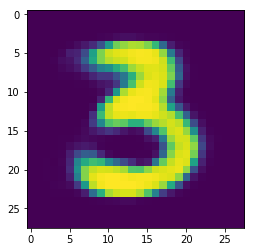

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  8



  0%|          | 1/214 [00:02<09:25,  2.66s/it]

[0 7 9 8 4 1 6 3 0 4 7 4 0 3 0 7 2 3 9 4 7 5 5 1 6 6 9 0 7 0 2 3 0 1 8 5 2
 4 1 6 4 5 9 5 0 4 1 1 6 1 4 5 7 1 9 4 1 9 6 2 2 1 9 6 8 2 6 6 6 0 5 4 0 2
 8 9 8 7 4 7 4 0 4 3 4 2 1 2 6 6 7 0 0 2 9 4 3 1 4 1 4 3 9 9 1 4 7 2 4 5 4
 1 5 4 1 6 3 0 4 8 8 1 8 6 4 6 1 5 8 4 1 9 5 1 4 6 0 6 0 2 9 6 2 7 5 0 4 2
 6 0 3 9 8 3 0 0 7 3 5 8 1 1 6 7 2 8 2 3 8 8 8 1 7 3 2 5 3 9 8 4 8 9 2 4 7
 0 6 0 5 4 8 0 2 5 2 7 1 7 5 1 8 8 8 4 8 1 4 7 0 4 3 3 1 2 8 0 6 6 9 9 6 7
 5 1 2 7 9 7 5 9 9 1 8 1 7 0 0 8 6 2 4 2 7 5 6 8 1 8 0 6 4 1 7 9 3 8]
[0 7 9 8 4 1 6 3 0 4 7 4 0 3 0 7 2 3 9 4 7 5 5 1 6 6 9 0 7 0 2 3 0 1 8 5 2
 4 1 6 4 5 9 5 0 4 1 1 6 1 4 5 7 1 9 4 1 9 6 2 2 1 9 6 8 2 6 6 6 0 5 4 0 2
 8 9 8 7 4 7 4 0 4 3 4 2 1 2 6 6 7 0 0 2 9 4 3 1 4 6 4 3 9 9 1 4 7 2 4 5 4
 1 5 4 1 6 3 0 4 8 8 1 8 6 4 6 1 5 8 4 1 9 5 1 4 6 0 6 0 2 9 6 2 7 5 0 4 2
 6 0 3 9 8 3 0 0 7 3 5 8 1 1 6 7 2 8 2 3 8 8 8 1 7 3 2 5 3 9 8 4 8 9 2 4 7
 0 6 0 5 4 8 0 2 5 2 7 1 7 5 1 8 8 8 4 8 1 4 7 0 4 3 3 1 2 8 0 6 6 9 9 6 7
 5 1 2 7 9 7 5 9 9 1 8 1 7 0 0


  1%|          | 2/214 [00:05<09:24,  2.66s/it]

[9 2 2 3 3 7 0 6 3 5 9 7 1 1 4 1 9 1 9 5 3 0 4 9 7 7 4 1 1 4 8 9 1 3 0 2 2
 8 2 0 8 2 0 3 8 2 9 8 2 2 9 1 9 8 8 1 3 1 9 3 0 8 5 4 8 0 3 1 7 0 9 8 4 3
 7 9 9 9 0 6 1 9 0 1 1 9 6 2 8 0 3 8 2 3 5 8 9 1 5 0 3 9 9 4 7 2 4 2 6 4 5
 8 9 2 1 4 5 8 3 9 9 9 7 4 2 2 3 3 9 6 8 8 4 9 3 7 2 3 0 4 1 9 3 7 2 4 8 0
 3 3 9 1 3 0 5 6 7 8 6 9 5 7 1 4 5 3 9 3 0 4 1 7 8 9 9 8 9 6 2 1 2 2 3 4 9
 5 5 0 5 7 4 6 1 6 3 3 7 8 3 7 0 8 4 3 2 9 3 5 6 2 1 7 5 0 6 3 8 4 5 1 1 9
 4 9 2 8 9 9 6 4 0 1 6 9 3 3 8 6 0 2 6 0 1 8 4 3 4 1 8 8 9 3 4 6 5 7]
[9 2 2 3 3 7 0 6 3 5 9 7 1 1 4 1 9 1 9 5 3 0 4 9 7 7 4 1 1 4 8 9 1 3 0 2 2
 8 2 0 8 2 0 3 8 2 9 8 2 2 9 1 9 8 8 1 3 1 9 3 0 8 5 4 8 0 3 1 7 0 9 8 4 3
 7 9 9 9 0 6 1 9 0 1 1 9 6 2 8 0 3 8 2 3 5 8 9 1 5 0 3 9 9 4 7 2 4 2 6 4 5
 8 9 2 1 4 5 8 3 9 9 9 7 4 2 2 3 3 9 6 8 8 4 9 3 7 2 3 0 4 1 9 3 7 2 4 8 0
 3 3 9 1 3 0 5 6 7 8 6 9 5 7 1 4 5 3 9 3 0 4 1 7 8 9 9 8 9 6 2 1 2 2 3 4 9
 5 5 0 5 7 4 6 1 6 3 3 7 8 3 7 0 8 4 3 2 9 3 5 6 2 1 7 5 0 6 3 8 4 5 1 1 9
 4 9 2 8 9 9 6 4 0 1 6 9 3 3 8


  1%|▏         | 3/214 [00:07<09:17,  2.64s/it]

[9 7 2 2 5 3 4 6 9 8 1 8 0 7 6 7 7 8 7 1 5 7 2 3 9 6 5 2 4 2 5 0 3 9 3 7 3
 0 6 3 4 0 7 6 0 8 7 8 6 6 2 0 7 9 9 6 4 8 1 1 5 6 1 4 5 2 7 9 5 5 2 3 9 3
 8 2 8 6 9 5 1 7 3 5 7 1 0 6 1 3 1 8 8 8 1 1 1 0 0 7 1 0 5 2 7 4 4 5 2 2 4
 6 2 1 2 1 2 8 4 7 2 0 3 0 6 6 4 4 9 4 9 4 9 1 5 8 2 0 4 2 7 6 5 0 4 9 9 3
 6 4 0 0 2 8 3 9 6 4 5 9 6 7 7 5 1 9 6 1 5 0 5 3 8 1 3 2 9 4 6 8 5 7 9 5 9
 3 2 5 8 1 6 3 6 8 5 8 8 0 1 2 9 3 4 4 0 0 0 8 7 1 7 1 7 5 9 3 3 2 1 8 5 2
 1 7 3 5 2 4 0 3 1 1 1 8 1 1 4 2 8 5 4 0 6 9 0 5 7 0 2 0 0 3 1 3 1 1]
[9 7 2 2 5 3 4 6 9 8 1 8 0 7 6 7 7 8 7 1 5 7 2 3 9 6 5 2 4 2 5 0 3 9 3 7 3
 0 6 3 4 0 7 6 0 8 7 8 6 6 2 0 7 9 9 6 4 8 1 1 5 6 1 4 5 2 7 9 5 5 2 3 9 3
 8 2 8 6 9 5 1 7 3 5 7 1 0 6 1 3 1 8 8 8 1 1 1 0 0 7 1 0 5 2 7 4 4 5 2 2 4
 6 2 1 2 1 2 8 4 7 2 0 3 0 6 6 4 4 9 4 9 4 9 1 5 8 2 0 4 2 7 6 5 0 4 9 9 3
 6 4 0 0 2 8 3 9 6 4 5 9 6 7 7 5 1 9 6 1 5 0 5 3 8 1 3 2 9 4 6 8 5 7 9 5 9
 3 2 5 8 1 6 3 6 8 5 8 8 0 1 2 9 3 4 4 0 0 0 8 7 1 7 1 7 5 9 3 3 2 1 8 5 2
 1 7 3 5 2 4 0 3 1 1 1 8 1 1 4


  2%|▏         | 4/214 [00:10<09:12,  2.63s/it]

[1 2 8 3 9 4 8 4 0 0 1 4 4 6 5 6 3 7 9 5 1 8 2 4 9 4 7 0 0 5 3 7 5 0 2 2 9
 2 1 4 6 3 4 0 1 3 0 2 6 0 7 6 2 1 0 1 2 7 0 6 7 0 7 4 7 9 4 4 0 4 1 6 7 3
 7 1 5 8 7 3 0 5 8 7 7 2 7 2 2 8 0 2 2 1 0 5 0 8 7 2 7 0 1 2 8 6 9 5 0 0 7
 0 3 3 0 0 9 8 8 1 6 2 4 6 3 0 6 9 1 0 7 9 4 9 2 4 6 0 5 2 6 5 1 0 5 1 6 7
 2 3 4 7 3 0 3 0 9 5 0 6 8 3 1 3 2 3 2 2 5 3 4 6 5 6 6 5 6 5 0 4 6 4 7 8 7
 5 2 1 4 2 1 8 9 6 7 3 5 2 8 4 0 4 2 0 2 0 5 6 8 6 9 8 7 6 2 2 9 0 0 6 7 0
 7 2 2 4 1 4 0 7 7 1 7 0 6 0 6 1 7 2 3 0 4 8 9 0 0 1 2 5 7 6 0 7 9 1]
[1 2 8 3 9 4 8 4 0 0 1 4 4 6 5 6 3 7 9 5 1 8 2 4 9 4 7 0 0 5 3 7 5 0 2 2 9
 2 1 4 6 3 4 0 1 3 0 2 6 0 7 6 2 1 0 1 2 7 0 6 7 0 7 4 7 9 4 4 0 4 1 6 7 3
 7 1 5 8 7 3 0 5 8 7 7 2 7 2 2 8 0 2 2 1 0 5 0 8 7 2 7 0 1 2 8 6 9 5 0 0 7
 0 3 3 0 0 9 8 8 1 6 2 4 6 3 0 6 9 1 0 7 9 4 9 2 4 6 0 5 2 6 5 1 0 5 1 6 7
 2 3 4 7 3 0 3 0 9 5 0 6 8 3 1 3 2 3 2 2 5 3 4 6 5 6 6 5 6 5 0 4 6 4 7 8 7
 5 2 1 4 2 1 8 9 6 7 3 5 2 8 4 0 4 2 0 2 0 5 6 8 6 9 8 7 6 2 2 9 0 0 6 7 0
 7 2 2 4 1 4 0 7 7 1 7 0 6 0 6


  2%|▏         | 5/214 [00:13<09:12,  2.64s/it]

[4 6 8 5 7 1 2 1 5 2 0 2 8 8 4 3 1 5 1 7 1 5 8 6 8 4 3 7 3 4 8 8 4 6 2 2 5
 0 6 5 9 0 5 9 3 5 2 4 3 9 9 8 1 5 8 7 9 5 5 1 5 5 1 7 7 8 2 2 5 8 3 8 8 2
 8 1 3 4 8 1 7 6 8 8 2 7 5 9 9 0 2 8 4 7 8 1 2 7 1 0 6 7 3 9 6 1 3 1 2 1 7
 9 8 8 4 7 9 2 5 0 6 7 8 5 4 8 3 2 3 8 0 9 8 3 3 8 3 4 5 8 2 8 5 8 7 7 5 9
 7 3 4 1 6 6 9 0 7 9 6 6 4 5 9 3 6 1 3 3 1 3 8 9 3 4 1 8 6 7 8 9 8 4 1 3 1
 8 6 2 2 2 7 5 8 2 0 5 2 5 0 6 4 0 4 2 1 3 3 4 9 6 9 3 9 5 6 2 8 2 3 1 5 7
 6 6 7 9 4 8 3 7 3 0 8 3 7 1 5 4 1 7 1 8 5 7 8 4 9 1 5 7 4 0 3 2 3 1]
[4 6 8 5 7 1 2 1 5 2 0 2 8 8 4 3 1 5 1 7 1 5 8 6 8 4 3 7 3 4 8 8 4 6 2 2 5
 0 6 5 9 0 5 9 3 5 2 4 3 9 9 8 1 5 8 7 9 5 5 1 5 5 1 7 7 8 2 2 5 8 3 8 8 2
 8 1 3 4 8 1 7 6 8 8 2 7 5 9 9 0 2 8 4 7 8 1 2 7 1 0 6 7 3 9 6 1 3 1 2 1 7
 9 8 8 4 7 9 2 5 0 6 7 8 5 4 8 3 2 3 8 0 9 8 3 3 8 3 4 5 8 2 8 5 8 7 7 5 9
 7 3 4 1 6 6 9 0 7 9 6 6 4 5 9 3 6 1 3 3 1 3 8 9 3 4 1 8 6 7 8 9 8 4 1 3 1
 8 6 2 2 2 7 5 8 2 0 5 2 5 0 6 4 0 4 2 1 3 3 4 9 6 9 3 9 5 6 2 8 2 3 1 5 7
 6 6 7 9 4 8 3 7 3 0 8 3 7 1 5


  3%|▎         | 6/214 [00:15<09:11,  2.65s/it]

[2 4 2 4 3 4 0 3 8 2 6 1 3 3 5 8 8 0 8 0 1 9 7 5 6 8 8 4 0 2 2 5 1 1 3 3 4
 8 2 7 5 1 3 8 3 7 1 3 4 8 9 8 5 1 6 6 9 6 7 0 3 0 8 1 2 4 3 4 4 3 0 4 1 6
 5 4 6 3 4 4 7 8 2 6 2 0 1 1 3 8 0 6 3 5 8 6 3 1 3 0 2 7 5 8 2 1 1 4 9 0 1
 6 8 7 6 1 8 8 3 9 9 3 1 4 9 2 8 6 5 9 1 2 8 7 2 7 9 6 9 0 6 3 5 6 4 8 0 6
 1 0 4 0 0 0 6 5 3 3 1 8 8 3 9 1 3 7 1 3 4 8 1 6 6 8 6 5 2 2 8 7 2 0 9 8 0
 7 7 2 0 8 8 4 3 5 1 1 4 5 1 5 3 5 6 1 1 6 1 6 0 2 7 3 9 1 1 8 5 4 5 3 2 9
 1 8 8 1 2 9 0 8 7 4 1 1 4 2 5 6 7 9 8 0 9 2 5 6 4 4 9 4 2 7 7 4 7 8]
[2 4 2 4 3 4 0 3 8 2 6 1 3 3 5 8 8 0 8 0 1 9 7 5 6 8 8 4 0 2 2 5 1 1 3 3 4
 8 2 7 5 1 3 8 3 7 1 3 4 8 9 8 5 1 6 6 9 6 7 0 3 0 8 1 2 4 3 4 4 3 0 4 1 6
 5 4 6 3 4 4 7 8 2 6 2 0 1 1 3 8 0 6 3 5 8 6 3 1 3 0 2 7 5 8 2 1 1 4 9 0 1
 6 8 7 6 1 8 8 3 9 9 3 1 4 9 2 8 6 5 9 1 2 8 7 2 7 9 6 9 0 6 3 5 6 4 8 0 6
 1 0 4 0 0 0 6 5 3 3 1 8 8 3 9 1 3 7 1 3 4 8 1 6 6 8 6 5 2 2 8 7 2 0 9 8 0
 7 7 2 0 8 8 4 3 5 1 1 4 5 1 5 3 5 6 1 1 6 1 6 0 2 7 3 9 1 1 8 5 4 5 3 2 9
 1 8 8 1 2 9 0 8 7 4 1 1 4 2 5


  3%|▎         | 7/214 [00:18<09:09,  2.65s/it]

[1 4 1 2 9 6 3 5 5 1 5 8 2 8 0 1 4 1 1 8 4 3 8 9 2 2 8 1 5 2 8 5 7 3 5 8 4
 2 0 9 6 2 1 4 0 5 9 5 0 4 2 5 0 8 2 3 5 1 6 7 2 3 8 9 7 1 9 4 7 2 4 7 8 1
 7 7 0 4 7 3 4 3 6 3 7 9 8 4 7 5 3 7 5 1 1 1 1 7 2 4 5 1 1 4 2 1 3 6 0 8 9
 2 2 2 1 6 3 9 1 4 6 0 5 9 5 6 7 4 1 0 1 3 8 4 8 8 9 6 9 3 8 2 9 7 9 7 2 1
 8 0 4 1 7 1 9 7 1 1 8 7 0 0 6 2 4 0 7 7 9 9 6 6 2 4 1 2 4 0 3 9 4 3 6 5 7
 6 7 3 5 8 0 8 2 0 5 5 9 0 9 6 4 9 4 6 2 7 3 3 9 6 2 6 4 5 5 4 5 6 3 9 2 2
 2 2 5 9 4 4 8 2 5 5 2 5 9 3 0 8 4 8 2 1 9 4 8 1 5 7 8 9 0 9 5 7 4 5]
[1 4 1 2 9 6 3 5 5 1 5 8 2 8 0 1 4 1 1 8 4 3 8 9 2 2 8 1 5 2 8 5 7 3 5 8 4
 2 0 9 6 2 1 4 0 5 9 5 0 4 2 5 0 8 2 3 5 1 6 7 2 3 8 9 7 1 9 4 7 2 4 7 8 1
 7 7 0 4 7 3 4 3 6 3 7 9 8 4 7 5 3 7 5 1 1 1 1 7 2 4 5 1 1 4 2 1 3 6 0 7 9
 2 2 2 1 6 3 9 1 4 6 0 5 9 5 6 7 4 1 0 1 3 8 4 8 8 9 6 9 3 8 2 9 7 9 7 2 1
 8 0 4 1 7 1 9 7 1 1 8 7 0 0 6 2 4 0 7 7 9 9 6 6 2 4 1 2 4 0 3 9 4 3 6 5 7
 6 7 3 5 8 0 8 2 0 5 5 9 0 9 6 4 9 9 6 2 7 3 3 9 6 2 6 4 5 5 4 5 6 3 9 2 2
 2 2 5 9 4 4 8 2 5 5 2 5 9 3 0


  4%|▎         | 8/214 [00:21<09:08,  2.66s/it]

[5 4 0 8 9 9 8 7 0 0 2 5 0 6 1 5 1 0 2 1 3 1 9 4 4 6 0 4 0 1 7 8 2 3 1 3 5
 2 5 0 0 7 2 9 1 1 3 1 0 2 9 6 4 1 0 3 8 7 6 9 9 7 4 0 0 5 3 2 3 5 4 2 9 1
 0 9 0 4 8 7 8 6 2 1 3 7 9 4 6 2 5 8 3 0 5 0 1 0 2 8 5 5 1 1 1 5 7 7 4 7 5
 2 4 0 9 1 5 7 3 0 2 4 2 4 3 9 7 1 8 6 1 3 8 4 9 6 8 8 0 6 8 3 8 8 8 0 0 2
 0 5 3 7 1 3 6 3 7 7 8 9 8 1 0 7 1 0 1 8 9 5 8 2 3 3 4 7 7 0 6 9 5 3 3 0 8
 9 3 4 2 4 9 1 6 2 5 9 8 4 3 7 9 4 4 4 4 7 1 5 7 3 3 8 5 3 1 6 9 6 9 8 7 7
 5 7 2 0 4 3 9 8 3 5 3 2 9 0 3 6 4 7 5 1 6 8 2 4 4 9 0 2 8 3 6 2 7 1]
[5 4 0 8 9 9 8 7 0 0 2 5 0 6 1 5 1 0 2 1 3 1 9 4 4 6 0 4 0 1 7 8 2 3 1 3 5
 2 5 0 0 7 2 9 1 1 3 1 0 2 9 6 4 1 0 3 8 7 6 9 9 7 4 0 0 5 3 2 3 5 4 2 9 1
 0 9 0 4 8 7 8 6 2 1 3 7 9 4 6 2 5 8 3 0 5 0 1 0 2 8 5 5 1 1 1 5 7 7 4 7 5
 2 4 0 9 1 5 7 3 0 2 4 2 4 3 9 7 1 8 6 1 3 8 4 9 6 8 8 0 6 8 3 8 8 8 0 0 2
 0 5 3 7 1 3 6 3 7 7 8 9 8 1 0 7 1 0 1 8 9 5 8 2 3 3 4 7 7 0 6 9 5 3 3 0 8
 9 3 4 2 4 9 1 6 2 5 9 8 4 3 7 9 4 4 4 4 7 1 5 7 3 3 8 5 3 1 6 9 6 9 8 7 7
 5 7 2 0 4 3 9 8 3 5 3 2 9 0 3


  4%|▍         | 9/214 [00:23<09:04,  2.66s/it]

[7 4 0 3 9 5 0 8 6 4 7 5 1 8 8 7 8 0 2 4 0 2 2 1 2 7 4 0 9 1 6 7 0 2 1 0 3
 3 0 1 9 4 7 6 0 2 5 0 8 1 6 9 5 3 9 9 2 1 8 5 4 8 6 0 1 5 8 4 7 6 8 6 0 4
 4 4 0 9 1 9 9 7 2 7 9 7 3 2 7 7 5 4 0 7 5 9 1 9 5 5 3 0 9 6 7 3 8 7 1 4 9
 5 0 9 4 2 9 6 0 7 4 0 0 7 8 4 9 1 9 8 6 6 6 2 9 6 9 4 2 4 3 1 2 7 8 2 7 7
 3 8 6 1 6 0 6 0 9 4 3 8 6 1 6 2 0 3 1 4 7 5 6 1 9 3 1 3 2 3 6 6 7 7 4 5 4
 9 2 2 2 8 3 0 9 7 1 5 9 7 4 6 2 2 4 8 5 1 4 7 1 2 7 1 7 1 3 1 4 1 8 1 4 6
 7 0 8 0 0 6 5 3 7 1 4 1 1 9 1 8 1 0 2 1 2 3 2 2 4 0 8 7 6 9 5 4 3 1]
[7 4 0 3 9 5 0 8 6 4 7 5 1 8 8 7 8 0 2 4 0 2 2 1 2 7 4 0 9 1 6 7 0 2 1 0 3
 3 0 1 9 4 7 6 0 2 5 0 8 1 6 9 5 3 9 9 2 1 8 5 4 8 6 0 1 5 8 4 7 6 8 6 0 4
 4 4 0 9 1 9 9 7 2 7 9 7 3 2 7 7 5 4 0 7 5 9 1 9 5 5 3 0 9 6 7 3 8 7 1 4 9
 5 0 9 4 2 9 6 0 7 4 0 0 7 8 4 9 1 9 8 6 6 6 2 9 6 9 4 2 4 3 1 2 7 8 2 7 7
 3 8 6 1 6 0 6 0 9 4 3 8 6 1 6 2 0 3 1 4 7 5 6 1 9 3 1 3 2 3 6 6 7 7 4 5 4
 9 2 2 2 8 3 0 9 7 1 5 9 7 4 6 2 2 4 8 5 1 4 7 1 2 7 1 7 1 3 1 4 1 8 1 4 6
 7 0 8 0 0 6 5 3 7 1 4 1 1 9 1


  5%|▍         | 10/214 [00:26<09:01,  2.65s/it]

[6 5 2 9 5 8 5 5 1 9 6 0 2 7 6 6 4 0 1 2 0 0 5 7 2 6 3 5 0 7 9 4 8 2 1 2 3
 3 5 6 4 3 1 0 8 0 2 6 4 8 8 5 1 9 8 4 8 9 0 3 1 3 0 5 8 3 2 9 8 7 5 1 1 0
 0 3 6 0 1 2 9 2 7 6 0 6 8 6 0 1 4 5 3 6 1 6 3 5 7 2 4 2 2 7 2 5 6 7 4 2 8
 1 4 0 6 7 9 7 9 1 4 9 7 8 9 5 5 0 8 4 2 7 2 3 4 8 8 3 9 0 4 8 7 6 0 5 8 5
 1 9 9 3 4 0 8 0 7 5 3 1 8 0 1 4 2 5 3 0 0 8 9 3 1 8 6 0 7 0 6 2 2 2 1 0 6
 8 8 2 8 6 0 7 9 2 6 0 4 2 4 9 1 5 0 8 9 9 5 4 1 7 7 9 4 0 0 2 3 3 9 7 5 0
 5 1 4 7 4 4 9 4 3 2 9 1 4 1 9 0 6 7 5 0 6 8 2 2 8 6 2 3 6 2 9 6 3 2]
[6 5 2 9 5 8 5 5 1 9 6 0 2 7 6 6 4 0 1 2 0 0 5 7 2 6 3 5 0 7 9 4 8 2 1 2 3
 3 5 6 4 3 1 0 8 0 2 6 4 8 8 5 1 9 8 4 8 9 0 3 1 3 0 5 8 3 2 9 8 7 5 1 1 0
 0 3 6 0 1 2 9 2 7 6 0 6 8 6 0 1 4 5 3 6 1 6 3 5 7 2 4 2 2 7 2 5 6 7 4 2 8
 1 4 0 6 7 9 7 9 1 4 9 7 8 9 5 5 0 8 4 2 7 2 3 4 8 8 3 9 0 4 8 7 6 0 5 8 5
 1 9 9 3 4 0 8 0 7 5 3 1 8 0 1 4 2 5 3 0 0 8 9 3 1 8 6 0 7 0 6 2 2 2 1 0 6
 8 8 2 8 6 0 7 9 2 6 0 4 2 4 9 1 5 0 8 9 9 5 4 1 7 7 9 4 0 0 2 3 3 9 7 5 0
 5 1 4 7 4 4 9 4 3 2 9 1 4 1 9


  5%|▌         | 11/214 [00:29<08:57,  2.65s/it]

[1 5 8 0 1 5 1 6 3 7 3 9 9 1 7 3 4 7 8 9 6 9 2 9 3 6 0 1 5 1 1 2 3 4 7 8 3
 0 8 0 7 7 7 3 9 4 9 3 4 7 9 5 6 7 7 8 2 8 1 1 7 6 4 0 4 4 7 0 0 9 3 2 5 0
 2 6 2 3 3 2 9 3 0 5 0 8 1 0 4 1 7 6 8 7 1 8 1 1 6 3 2 7 5 6 8 6 3 4 7 4 3
 8 8 2 8 8 2 2 3 5 2 0 6 1 6 7 4 3 6 7 1 6 3 4 5 2 6 8 1 1 0 6 5 0 7 7 7 6
 7 3 4 0 4 2 8 9 2 9 4 4 3 1 0 8 5 8 3 6 0 2 6 7 6 9 8 2 0 0 2 4 5 7 9 4 9
 1 1 3 5 8 2 6 7 8 6 9 3 7 7 3 5 7 6 0 5 0 3 8 3 3 2 0 5 9 1 0 4 7 6 9 7 2
 4 3 5 1 9 5 8 9 0 8 4 4 9 4 9 6 9 7 7 3 0 6 5 0 5 3 2 3 0 4 9 3 1 3]
[1 5 8 0 1 5 1 6 3 7 5 9 9 1 7 3 4 7 8 9 6 9 2 9 3 6 0 1 5 1 1 2 3 4 7 8 3
 0 8 0 7 7 7 3 9 4 9 3 4 7 9 5 6 7 7 8 2 8 1 1 7 6 4 0 4 4 7 0 0 9 3 2 5 0
 2 6 2 3 3 2 9 3 0 5 0 8 1 0 4 1 7 6 8 7 1 8 1 1 6 3 2 7 5 6 8 6 3 4 7 4 3
 8 8 2 8 8 2 2 3 5 2 0 6 1 6 7 4 3 6 7 1 6 3 4 5 2 6 8 1 1 0 6 5 0 7 7 7 6
 7 3 4 0 4 2 8 7 2 9 4 4 3 1 0 8 5 8 3 6 0 2 6 7 6 9 8 2 0 0 2 4 5 7 9 4 9
 1 1 3 5 8 2 6 7 8 6 9 3 7 7 3 5 7 6 0 5 0 3 8 3 3 2 0 5 9 1 0 4 7 6 9 7 2
 4 3 5 1 9 5 8 9 0 8 4 4 9 4 9


  6%|▌         | 12/214 [00:31<08:55,  2.65s/it]

[1 6 3 5 8 1 3 0 3 9 7 7 2 0 0 8 2 2 9 3 0 4 6 3 3 8 9 0 2 3 1 7 3 7 8 7 0
 1 4 4 8 0 1 4 9 3 4 2 8 8 9 6 3 6 3 1 1 8 9 8 6 3 2 9 6 5 9 1 9 5 4 6 3 0
 4 2 5 2 9 9 5 7 7 3 6 4 3 7 7 5 7 6 0 3 6 3 7 3 5 1 3 5 0 6 3 7 9 7 8 7 0
 3 5 5 7 1 5 6 3 8 8 7 1 7 1 9 2 0 2 1 7 2 7 4 3 8 6 0 4 3 2 0 8 6 8 3 7 6
 4 8 5 8 7 5 9 1 4 3 4 0 7 4 2 8 6 8 1 9 4 0 7 7 0 0 9 1 0 7 6 7 5 7 5 0 4
 0 2 6 2 6 8 3 1 3 1 7 8 5 9 8 3 7 4 5 7 9 4 3 7 6 6 9 3 0 6 9 3 4 6 7 1 1
 4 3 2 6 1 0 4 3 9 5 9 6 4 1 6 5 1 4 7 6 9 5 3 0 6 9 7 7 8 3 1 1 6 8]
[1 6 3 5 8 1 3 0 3 9 7 7 2 0 0 8 2 2 9 3 0 4 6 3 3 8 9 0 2 3 1 7 3 7 8 7 0
 1 4 4 8 0 1 4 9 3 4 2 8 8 9 6 3 6 3 1 1 8 9 8 6 3 2 9 6 5 9 1 9 5 4 6 3 0
 4 2 5 2 9 9 5 7 7 3 6 4 3 7 7 5 7 6 0 3 6 3 7 3 5 1 3 5 0 6 3 7 9 7 8 7 0
 3 5 5 7 1 5 6 3 8 8 7 1 7 1 9 2 0 2 1 7 2 7 4 3 8 6 0 4 3 2 0 8 6 8 3 7 6
 4 8 5 8 7 5 9 1 4 3 4 0 7 4 2 8 6 8 1 9 4 0 7 7 0 0 9 1 0 7 6 7 5 7 5 0 4
 0 2 6 2 6 8 3 1 3 1 7 8 5 9 8 3 7 4 5 7 9 4 3 7 6 6 9 3 0 6 9 3 4 6 7 1 1
 4 3 2 6 1 0 4 3 9 5 9 6 4 1 6


  6%|▌         | 13/214 [00:34<08:52,  2.65s/it]

[3 9 7 4 9 3 3 1 9 8 1 2 6 0 0 9 2 9 9 8 2 8 5 0 5 9 4 6 5 6 0 3 0 5 2 6 6
 0 0 9 7 3 3 3 6 3 0 9 3 9 7 5 3 2 5 4 2 8 1 6 3 0 0 1 8 3 9 7 8 0 7 4 5 0
 3 2 6 1 0 2 6 0 4 7 2 3 0 3 9 6 8 7 6 9 3 9 3 6 1 8 8 5 1 3 6 3 5 0 3 8 2
 7 4 2 0 5 8 1 0 9 3 5 1 1 0 5 7 5 7 7 2 7 8 9 3 5 8 7 6 3 6 6 6 4 5 4 0 8
 6 1 6 0 1 0 4 6 1 0 3 3 3 3 4 3 3 7 4 1 8 4 6 3 4 1 7 9 1 0 4 0 7 1 9 3 3
 7 0 9 9 4 0 1 7 6 5 2 4 6 9 3 9 3 5 8 8 3 4 0 5 4 6 1 1 7 5 0 7 4 5 0 3 7
 1 8 9 7 8 1 8 3 2 4 3 4 6 0 8 7 4 2 4 2 2 3 0 8 9 9 1 8 5 6 2 9 4 1]
[3 9 7 4 9 3 3 1 9 8 1 2 6 0 0 9 2 9 9 8 2 8 5 0 5 9 4 6 5 6 0 3 0 5 2 6 6
 0 0 9 7 3 3 3 6 3 0 9 3 9 7 5 3 2 5 4 2 8 1 6 3 0 0 1 8 3 9 7 8 0 7 4 5 0
 3 2 6 1 0 2 6 0 4 7 2 3 0 3 9 6 8 7 6 9 3 9 3 6 1 8 8 5 1 3 6 3 5 0 3 8 2
 7 4 2 0 5 8 1 0 9 3 5 1 1 0 5 7 5 7 7 2 7 8 9 3 5 8 7 6 3 6 6 6 4 5 4 0 8
 6 1 6 0 1 0 4 6 1 0 3 3 3 3 4 3 3 7 4 1 8 4 6 3 4 1 7 9 1 0 4 0 7 1 9 3 3
 7 0 9 9 4 0 1 7 6 5 2 4 6 9 3 9 3 5 8 8 3 4 0 5 4 6 1 1 7 5 0 7 4 5 0 3 7
 1 8 9 7 8 1 8 3 2 4 3 4 6 0 8


  7%|▋         | 14/214 [00:37<08:49,  2.65s/it]

[4 6 2 5 3 2 0 2 1 7 2 9 7 3 1 7 8 0 1 4 4 7 3 9 3 3 1 7 2 6 5 9 8 3 6 6 4
 8 0 6 8 5 1 2 4 2 6 1 6 7 0 7 4 2 5 2 1 1 0 7 0 2 1 6 3 1 9 2 0 9 4 8 1 5
 3 0 4 5 0 7 2 2 0 5 6 2 3 3 4 8 1 9 7 3 7 9 2 9 3 6 8 2 4 7 1 8 9 4 2 6 3
 5 7 1 1 7 0 0 0 9 8 2 2 7 6 8 1 2 6 0 0 1 0 6 2 0 4 7 4 2 9 3 7 8 7 9 3 8
 6 2 7 1 1 4 6 6 9 5 2 2 6 5 3 2 5 0 3 1 6 9 9 0 0 3 7 4 7 2 7 3 4 1 0 4 6
 8 2 4 8 0 0 6 9 6 6 7 7 3 2 9 9 9 5 3 4 3 3 4 9 0 6 8 3 3 2 5 5 6 4 9 5 1
 9 6 6 4 0 8 0 2 2 2 7 3 1 5 2 5 2 1 7 6 7 0 6 9 9 7 9 6 4 1 6 6 3 1]
[4 6 2 5 3 2 0 2 1 7 2 9 7 3 1 7 8 0 1 4 4 7 3 9 3 3 1 7 2 6 5 9 8 3 6 6 4
 8 0 6 8 5 1 2 4 2 6 1 6 7 0 7 4 2 5 2 1 1 0 7 0 2 1 6 3 1 9 2 0 9 4 8 1 5
 3 0 4 5 0 7 2 2 0 5 6 2 3 3 4 8 1 9 7 3 7 9 2 9 3 6 8 2 4 7 1 8 9 4 2 6 3
 5 7 1 1 7 0 0 0 9 8 2 2 7 6 8 1 2 6 0 0 1 0 6 2 0 4 7 4 2 9 3 7 8 7 9 3 8
 6 2 7 1 1 4 6 6 9 5 2 2 6 5 3 2 5 0 3 1 6 9 9 0 0 3 7 4 7 2 7 3 4 1 0 4 6
 8 2 4 8 0 0 6 9 6 6 7 7 3 2 9 9 9 5 3 4 3 3 4 9 0 6 8 3 3 2 5 5 6 4 9 5 1
 9 6 6 4 0 8 0 2 2 2 7 3 1 5 2


  7%|▋         | 15/214 [00:39<08:47,  2.65s/it]

[9 0 8 8 1 1 3 5 0 9 8 7 4 1 7 1 5 3 7 3 3 7 7 8 8 5 6 2 1 0 4 9 5 4 1 2 6
 5 1 4 5 0 3 3 0 7 5 4 8 9 1 3 2 1 1 3 6 8 4 4 4 6 6 1 3 7 4 8 0 0 9 0 1 4
 7 6 3 8 7 3 9 2 3 3 4 7 4 3 7 5 8 2 3 0 7 1 6 9 9 2 5 3 4 7 2 9 7 2 2 1 5
 2 1 9 1 9 9 3 7 7 6 6 3 1 9 3 4 8 1 4 1 5 8 6 9 8 1 1 9 3 5 8 9 3 0 0 5 2
 3 5 7 5 8 5 7 5 3 5 8 9 5 4 3 8 1 4 4 4 6 1 9 8 7 4 8 6 9 4 0 6 0 1 0 8 4
 1 8 5 3 0 0 7 1 9 4 8 5 1 3 7 3 1 9 0 5 7 0 4 9 6 4 1 1 1 1 9 0 3 2 6 6 6
 7 5 8 2 2 0 4 7 4 0 7 1 8 0 6 9 9 4 8 9 9 5 5 5 5 8 3 2 2 0 4 6 9 3]
[9 0 8 8 1 1 3 5 0 9 8 7 4 1 7 1 5 3 7 3 3 7 7 8 8 5 6 2 1 0 4 9 5 4 1 2 6
 5 1 4 5 0 3 3 0 7 5 4 8 9 1 3 2 1 1 3 6 8 4 4 4 6 6 1 3 7 4 8 0 0 9 0 1 4
 7 6 3 8 7 3 9 2 3 3 4 7 4 3 7 5 8 2 3 0 7 1 6 9 9 2 5 3 4 7 2 9 7 2 2 1 5
 2 1 9 1 9 9 3 7 7 6 6 3 1 9 3 4 8 1 4 1 5 8 6 9 8 1 1 9 3 5 8 9 3 0 0 5 2
 3 5 7 5 8 5 7 5 3 5 8 9 5 4 3 8 1 4 4 4 6 1 9 8 7 4 8 6 9 4 0 6 0 1 0 8 4
 1 8 5 3 0 0 7 1 9 4 8 5 1 3 7 3 1 9 0 5 7 0 4 9 6 4 1 1 1 1 9 0 3 7 6 6 6
 7 5 8 2 2 0 4 7 4 0 7 1 8 0 6


  7%|▋         | 16/214 [00:42<08:43,  2.65s/it]

[9 0 8 6 5 9 3 8 0 2 1 6 9 2 8 1 4 5 4 2 2 7 0 0 4 1 6 9 6 0 8 7 0 2 2 7 8
 0 8 7 8 4 5 1 3 1 6 1 9 1 7 0 3 6 5 1 4 2 7 9 7 4 0 1 4 6 1 0 3 9 5 2 4 9
 4 6 6 6 8 1 3 1 8 3 0 1 5 0 4 0 8 0 1 9 2 7 1 1 3 0 1 8 7 7 7 8 3 0 2 8 6
 8 0 8 2 7 6 8 7 7 2 7 1 5 1 2 5 0 8 9 4 2 2 3 3 9 6 5 3 6 4 8 0 8 8 3 1 7
 5 1 9 0 0 6 7 2 1 7 1 2 2 7 1 4 7 7 7 3 7 4 3 7 2 6 3 0 1 7 0 8 9 7 7 4 8
 5 1 2 5 9 9 5 0 3 8 3 7 3 9 9 1 8 7 0 7 9 2 1 3 6 2 4 4 8 2 7 5 9 0 3 0 3
 6 4 0 5 6 8 3 6 1 9 5 0 5 0 7 5 2 5 9 6 8 2 3 1 9 5 2 0 8 0 8 1 6 3]
[9 0 8 6 5 9 3 8 0 2 1 6 9 2 8 1 4 5 4 2 2 7 0 0 4 1 6 9 6 0 8 7 0 2 2 7 8
 0 8 7 8 4 5 1 3 1 6 1 9 1 7 0 3 6 5 1 4 2 7 9 7 4 0 1 4 6 1 0 3 9 5 2 4 9
 4 6 6 6 8 1 3 1 8 3 0 1 5 0 4 0 8 0 1 9 2 7 1 1 3 0 1 8 7 7 7 8 3 0 2 8 6
 8 0 8 2 7 6 8 7 7 2 7 1 5 1 2 5 0 8 9 4 2 2 3 3 9 6 5 3 6 4 8 0 8 8 3 1 7
 5 1 9 0 0 6 7 2 1 7 1 2 2 7 1 4 7 7 7 3 7 4 3 7 2 6 3 0 1 7 0 8 9 7 7 4 8
 5 1 2 5 9 9 5 0 3 8 3 7 3 9 9 1 8 7 0 7 9 2 1 3 6 2 4 4 8 2 7 5 9 0 3 0 3
 6 4 0 5 6 8 3 6 1 9 5 0 5 0 7


  8%|▊         | 17/214 [00:44<08:40,  2.64s/it]

[5 6 5 3 2 5 9 6 2 3 8 4 9 8 9 9 5 5 0 7 7 5 7 8 2 0 1 8 6 1 8 1 0 9 6 4 8
 2 8 5 7 1 9 5 7 7 1 8 2 2 7 4 2 1 1 2 3 5 0 3 1 3 8 3 2 5 6 1 6 2 8 2 8 9
 7 0 9 3 6 0 0 2 7 4 0 9 0 8 0 1 3 0 0 5 6 5 2 4 1 4 8 1 1 1 8 9 9 8 4 4 1
 4 9 0 6 3 4 9 3 4 4 6 8 8 9 2 2 0 2 7 5 9 4 4 9 6 5 6 8 9 7 2 1 2 4 3 6 5
 2 2 5 6 3 3 9 3 2 2 6 4 8 2 7 7 6 1 1 3 9 8 5 3 0 3 4 0 9 4 9 1 9 2 9 7 0
 4 4 2 3 0 8 1 1 6 7 2 9 4 2 7 6 8 6 4 9 9 3 2 6 1 4 3 5 8 9 1 1 7 8 5 0 8
 9 7 1 8 1 4 9 8 2 5 4 1 8 4 0 6 7 0 5 5 0 9 6 8 0 4 7 9 7 3 7 6 3 8]
[5 6 5 3 2 5 9 6 2 3 8 4 9 8 9 9 5 5 0 7 7 5 7 8 2 0 1 8 6 1 8 1 0 9 6 4 8
 2 8 5 7 1 9 5 7 7 1 8 2 2 7 4 2 1 1 2 3 5 0 3 1 3 8 3 2 5 6 1 6 2 8 2 8 9
 7 0 9 3 6 0 0 2 7 4 0 9 0 8 0 1 3 0 0 5 6 5 2 4 1 4 8 1 1 1 8 9 9 8 4 4 1
 4 9 0 6 3 4 9 3 4 4 6 8 8 9 2 2 0 2 7 5 9 4 4 9 6 5 6 8 9 7 2 1 2 4 3 6 5
 2 2 5 6 3 3 9 3 2 2 6 4 8 2 7 7 6 1 1 3 9 8 5 3 0 3 4 0 9 4 9 1 9 2 9 7 0
 4 4 2 3 0 8 1 1 6 7 2 9 4 2 7 6 8 6 4 9 9 3 2 6 1 4 3 5 8 9 1 1 7 8 5 0 8
 9 7 1 8 1 4 9 8 2 5 4 1 8 4 0


  8%|▊         | 18/214 [00:47<08:38,  2.64s/it]

[2 3 0 6 1 7 2 2 2 0 0 2 6 0 8 3 9 2 6 5 3 7 0 0 7 6 3 5 1 1 1 4 4 2 2 4 1
 6 6 9 2 0 1 3 2 1 1 1 6 8 0 4 3 3 1 9 6 7 8 9 4 8 9 7 6 8 1 2 4 6 0 2 2 0
 5 7 2 9 9 6 4 1 5 7 9 3 7 5 7 7 4 9 2 6 4 5 5 7 9 3 8 3 1 5 7 9 6 8 5 5 0
 2 9 6 6 2 6 2 1 0 4 6 2 5 1 5 7 4 8 7 8 0 4 7 4 9 5 3 3 6 2 2 8 6 9 8 1 7
 6 0 0 2 2 5 3 1 6 3 0 1 4 1 4 9 7 4 6 6 6 1 3 4 8 6 6 0 8 1 6 4 6 4 3 8 4
 7 6 8 3 3 2 3 0 0 4 9 3 5 5 9 0 0 1 2 1 7 0 8 5 8 2 3 4 5 1 4 9 8 1 3 6 9
 3 4 8 1 7 4 2 7 7 4 7 5 8 4 3 6 6 5 1 6 6 6 8 9 0 7 2 1 2 0 9 6 6 1]
[2 3 0 6 1 7 2 2 2 0 0 2 6 0 8 3 9 2 6 5 3 7 0 6 7 6 3 5 1 1 1 4 4 2 2 4 1
 6 6 9 2 0 1 3 2 1 1 1 6 8 0 4 3 3 1 9 6 7 8 9 4 8 9 7 6 8 1 2 4 6 0 2 2 0
 5 7 2 9 9 6 4 1 5 7 9 3 7 5 7 7 4 9 2 6 4 5 5 7 9 3 8 3 1 5 7 9 6 8 5 5 0
 2 9 6 6 2 6 2 1 0 4 6 2 5 1 5 7 4 8 7 8 0 4 7 4 9 5 3 3 6 2 2 8 6 9 8 1 7
 6 0 0 2 2 5 3 1 6 3 0 1 4 1 4 9 7 4 6 6 6 1 3 4 8 6 6 0 8 1 6 4 6 4 3 8 4
 7 6 8 3 3 2 3 0 0 4 9 3 5 5 9 0 0 1 2 1 7 0 8 5 8 2 3 4 5 1 4 9 8 1 3 6 9
 3 4 8 1 7 4 2 7 7 4 7 5 8 4 3


  9%|▉         | 19/214 [00:50<08:35,  2.64s/it]

[7 1 7 6 1 8 4 1 4 4 3 8 8 7 1 4 6 0 3 7 5 9 5 2 7 5 1 5 3 6 4 6 3 1 3 1 5
 8 6 7 2 7 3 7 0 6 4 5 9 6 6 9 3 0 6 0 1 8 7 7 2 4 6 3 5 3 5 5 1 5 9 0 1 2
 1 0 5 8 9 3 9 6 8 5 7 2 6 3 1 2 7 4 7 0 5 8 5 3 1 5 8 2 5 7 1 0 3 4 7 3 3
 7 2 4 0 4 3 8 5 7 1 3 1 8 5 4 2 6 4 3 4 6 1 2 4 8 0 3 2 0 7 2 5 6 4 3 5 0
 0 6 2 3 2 8 3 7 9 0 4 0 2 4 4 8 5 8 4 8 3 2 1 1 3 9 8 3 2 0 3 7 8 7 0 1 3
 6 2 7 2 4 1 1 0 7 8 5 7 8 5 4 2 8 3 9 4 6 8 7 0 5 9 6 6 4 3 7 5 0 2 7 0 7
 9 9 6 0 0 5 7 7 8 1 2 0 5 7 0 6 8 9 3 3 5 7 1 0 6 5 6 6 9 0 8 3 7 1]
[7 1 7 6 1 8 4 1 4 4 3 8 8 7 1 4 6 0 3 7 5 9 5 2 7 5 1 5 3 6 4 6 3 1 3 1 5
 8 6 7 2 7 3 7 0 6 4 5 9 6 6 9 3 0 6 0 1 8 7 7 2 4 6 3 5 3 5 5 1 5 9 0 1 2
 1 0 5 8 9 3 9 6 8 5 7 2 6 3 1 2 7 4 7 0 5 8 5 3 1 5 8 2 5 7 1 0 3 4 7 3 3
 7 2 4 0 4 3 8 5 7 1 3 1 8 5 4 2 6 4 3 4 6 1 2 4 8 0 3 2 0 7 2 5 6 4 3 5 0
 0 6 2 3 2 8 3 7 9 0 4 0 2 4 4 8 5 8 4 8 3 2 1 1 3 9 8 3 2 0 3 7 8 7 0 1 3
 6 2 7 2 4 1 1 0 7 8 5 7 8 5 4 2 8 3 9 4 6 8 7 0 5 9 6 6 4 3 7 5 0 2 7 0 7
 9 9 6 0 0 5 7 7 8 1 2 0 5 7 0


  9%|▉         | 20/214 [00:52<08:32,  2.64s/it]

[9 5 4 1 9 2 5 0 8 3 8 6 2 5 3 8 5 4 4 8 2 2 5 4 8 2 5 5 9 7 9 3 0 6 5 4 2
 1 7 7 3 0 9 6 5 0 9 6 3 9 5 3 7 1 1 2 7 2 4 9 9 8 0 9 9 0 1 3 6 8 7 2 6 8
 5 4 2 0 9 7 1 7 5 8 4 2 6 5 9 0 1 1 4 5 1 4 7 3 8 5 0 2 8 6 9 1 7 2 8 7 7
 3 8 9 5 8 8 0 6 5 4 2 8 0 8 5 2 1 0 0 0 0 8 5 2 5 5 1 4 7 0 8 4 1 4 5 1 9
 0 1 2 2 1 4 7 8 6 2 5 3 0 6 7 9 8 5 1 4 7 4 3 1 3 8 8 8 4 4 0 7 5 4 2 7 2
 7 9 9 9 0 5 9 2 2 2 3 7 1 8 5 3 0 6 7 0 5 8 8 7 6 0 9 3 4 6 5 1 8 6 3 9 4
 6 9 0 8 2 1 1 7 3 4 6 2 1 1 3 1 6 9 0 4 3 2 2 8 8 6 5 7 7 0 4 6 2 7]
[9 5 4 1 9 2 5 0 8 3 8 6 2 5 3 8 5 4 4 8 2 2 5 4 8 2 5 5 4 7 9 3 0 6 5 4 2
 1 7 7 3 0 9 6 5 0 9 6 3 9 5 3 7 1 1 2 7 2 4 9 9 8 0 9 9 0 1 3 6 8 7 2 6 8
 5 4 2 0 9 7 1 7 5 8 4 2 6 5 9 0 1 1 4 5 1 4 7 3 8 5 0 2 8 6 9 1 7 2 8 7 7
 3 8 9 5 8 8 0 6 5 4 2 8 0 8 5 2 1 0 0 0 0 8 5 2 5 5 1 4 7 0 8 4 1 4 5 1 9
 0 1 2 2 1 4 7 8 6 2 5 3 0 6 7 9 8 5 1 4 7 4 3 1 3 8 8 8 4 4 0 7 5 4 2 7 2
 7 9 9 9 0 5 9 2 2 2 3 7 1 8 5 3 0 6 7 0 5 8 8 7 6 0 9 3 4 6 5 1 8 6 3 9 4
 6 9 0 8 2 1 1 7 3 4 6 2 1 1 3


 10%|▉         | 21/214 [00:55<08:30,  2.65s/it]

[1 4 3 2 6 7 4 1 6 6 8 5 6 8 1 3 8 9 2 8 3 5 8 8 6 8 9 8 8 8 3 2 7 6 6 4 4
 8 7 8 2 6 3 7 6 7 4 1 6 5 6 0 0 1 2 4 4 4 3 2 3 5 1 8 7 9 3 2 6 6 3 2 9 1
 0 1 0 8 9 0 2 0 5 3 6 3 6 6 3 8 0 9 8 1 9 5 1 2 7 2 7 0 6 0 9 3 8 5 4 5 8
 2 1 0 2 0 5 1 5 7 4 8 8 7 1 5 8 6 3 9 5 5 8 2 4 5 3 3 8 5 0 1 4 7 7 6 1 4
 3 4 1 1 4 0 3 6 0 5 8 4 1 7 2 0 6 8 5 5 6 1 6 4 1 8 2 2 8 2 4 4 5 7 0 6 7
 1 5 7 8 4 8 5 5 7 6 5 6 8 2 4 0 3 9 0 1 8 5 5 1 6 8 5 9 5 9 3 5 4 1 3 7 3
 8 7 3 4 0 3 1 4 8 5 3 5 6 5 2 8 3 2 7 8 1 5 6 3 8 0 4 0 2 5 9 8 1 1]
[1 4 3 2 6 7 4 1 6 6 8 5 6 8 1 3 8 9 2 8 3 5 8 8 6 8 9 8 8 8 3 2 7 6 6 4 4
 8 7 8 2 6 3 7 6 7 4 1 6 5 6 0 0 1 2 4 4 4 3 2 3 5 1 8 7 9 3 2 6 6 3 2 9 1
 0 1 0 8 9 0 2 0 5 3 6 3 6 6 3 8 0 9 8 1 9 5 1 2 7 2 7 0 6 0 9 3 8 5 4 5 8
 2 1 0 2 0 5 1 5 7 4 8 8 7 1 5 8 6 3 9 5 5 8 2 4 5 3 3 8 5 0 1 4 7 7 6 1 4
 3 4 1 1 4 0 3 6 0 5 8 4 1 7 2 0 6 8 5 5 6 1 6 4 1 8 2 2 8 2 4 4 5 7 0 6 7
 1 5 7 8 4 8 5 5 7 6 5 6 8 2 4 0 3 9 0 1 8 5 5 1 6 8 5 9 5 9 3 5 4 1 3 7 3
 8 7 3 4 0 3 1 4 8 5 3 5 6 5 2


 10%|█         | 22/214 [00:58<08:27,  2.65s/it]

[5 9 1 3 3 5 0 7 7 6 5 3 4 2 8 1 7 7 8 5 9 5 2 7 8 7 8 4 3 0 9 5 4 6 1 4 7
 0 2 1 8 2 3 5 6 0 6 4 8 1 2 6 0 4 8 5 4 9 6 9 0 5 5 7 6 6 3 7 6 9 1 6 5 6
 2 9 7 0 0 5 6 2 4 9 9 0 8 1 4 3 9 0 4 3 9 3 7 4 0 3 2 8 9 4 0 0 8 7 4 0 6
 8 2 9 7 1 2 3 6 0 5 1 7 3 1 4 6 9 6 9 0 4 0 1 0 4 0 3 6 2 8 5 5 5 3 3 6 6
 1 4 5 3 6 9 1 0 7 3 9 0 1 4 7 4 9 3 8 0 2 2 9 0 1 8 0 0 2 2 8 2 7 4 2 7 6
 5 9 6 2 7 0 0 1 9 0 5 9 0 2 4 4 5 7 3 6 9 0 7 0 5 1 3 3 0 3 3 4 9 8 7 8 0
 7 0 0 4 2 3 0 6 9 5 2 1 7 8 2 9 3 9 0 8 9 9 5 5 9 6 9 0 0 4 0 6 2 8]
[5 9 1 3 3 5 0 7 7 6 5 3 4 2 8 1 7 7 8 5 9 5 2 7 8 7 8 4 3 0 9 5 4 6 1 4 7
 0 2 1 8 2 3 5 6 0 6 4 8 1 2 6 0 4 8 5 4 9 6 9 0 5 5 7 6 6 3 7 6 9 1 6 5 6
 2 9 7 0 0 5 6 2 4 9 9 0 8 1 4 3 9 0 4 3 9 3 7 4 0 3 2 8 9 4 0 0 8 7 4 0 6
 8 2 9 7 1 2 3 6 0 5 1 7 3 1 4 6 9 6 9 0 4 0 1 0 4 0 3 6 2 8 5 5 5 3 3 6 6
 1 4 5 3 6 9 1 0 7 3 9 0 1 4 7 4 9 3 8 0 2 2 9 0 1 8 0 0 2 2 8 2 7 4 2 7 6
 5 9 6 2 7 0 0 1 9 0 5 9 0 2 4 4 5 7 3 6 9 0 7 0 5 1 3 3 0 3 3 4 9 8 7 8 0
 7 0 0 4 2 3 0 6 9 5 2 1 7 8 2


 11%|█         | 23/214 [01:00<08:24,  2.64s/it]

[9 3 5 1 0 0 3 9 9 1 0 0 9 7 8 7 5 3 1 0 7 6 2 7 9 1 5 4 2 1 8 9 3 9 4 2 2
 0 9 1 6 4 0 6 9 4 1 5 7 7 1 9 5 5 1 4 1 5 8 2 7 6 1 1 4 1 6 2 8 4 9 6 7 2
 7 3 2 0 0 8 3 0 3 9 4 6 8 8 5 6 0 4 9 5 1 6 0 2 2 1 7 1 7 6 8 8 5 3 2 3 4
 0 9 0 0 8 0 0 8 3 3 8 5 6 9 6 3 8 2 3 3 7 5 6 1 3 5 7 9 9 5 0 7 6 4 0 6 9
 2 0 9 9 6 6 0 8 2 4 5 9 7 4 2 0 5 8 0 4 0 8 9 7 0 9 9 7 0 1 3 3 7 1 4 6 7
 1 0 3 6 2 9 2 9 4 1 9 3 8 1 1 9 1 0 1 0 4 2 4 9 9 3 8 6 3 7 9 1 0 8 8 1 2
 1 2 9 0 8 4 8 7 0 5 4 1 1 8 8 1 8 8 1 0 1 7 2 8 9 5 0 6 8 7 2 9 6 6]
[9 3 5 1 0 0 3 9 9 1 0 0 9 7 8 7 5 3 1 0 7 6 2 7 9 1 5 4 2 1 8 9 3 9 4 2 2
 0 9 1 6 4 0 6 9 4 1 5 7 7 1 9 5 5 1 4 1 5 8 2 7 6 1 1 4 1 6 2 8 4 9 6 7 2
 7 3 2 0 0 8 3 0 3 9 4 6 8 8 5 6 0 4 9 5 1 6 0 2 2 1 7 1 7 6 8 8 5 3 2 3 4
 0 9 0 0 8 0 0 8 3 3 8 5 6 9 6 3 8 2 3 3 7 5 6 1 3 5 7 9 9 5 0 7 6 4 0 6 9
 2 0 9 9 6 6 0 8 2 4 5 9 7 4 2 0 5 8 0 4 0 8 9 7 0 9 9 7 0 1 3 3 7 1 4 6 7
 1 0 3 6 2 9 2 9 4 1 9 3 8 1 1 9 1 0 1 0 4 2 4 9 9 3 8 6 3 7 9 1 0 8 8 1 2
 1 2 9 0 8 4 8 7 0 5 4 1 1 8 8


 11%|█         | 24/214 [01:03<08:22,  2.64s/it]

[3 6 9 1 0 2 5 6 2 1 7 9 6 7 1 0 3 3 3 3 0 4 2 8 0 8 9 7 0 5 9 7 7 1 0 0 6
 2 9 5 5 3 2 7 5 2 4 4 5 0 1 5 4 6 6 1 9 4 3 2 4 5 3 4 2 5 4 2 8 7 5 0 1 3
 0 5 5 1 8 2 1 0 3 0 6 1 8 3 2 6 5 4 2 0 3 8 5 0 7 8 9 4 2 6 7 5 4 2 4 6 6
 5 9 6 3 3 6 5 2 7 4 8 4 7 8 5 0 3 3 8 1 3 4 8 8 8 8 9 4 4 7 8 9 1 7 8 6 9
 4 8 2 1 9 9 9 1 1 6 8 4 9 4 5 2 8 5 8 7 8 3 4 6 6 5 0 0 9 1 9 0 0 1 7 9 3
 8 1 9 5 7 2 3 0 2 8 9 7 1 3 7 2 1 8 1 9 1 8 7 3 5 5 1 8 9 2 1 1 6 5 7 7 3
 5 5 7 4 8 5 1 9 8 4 1 4 0 3 4 0 9 3 2 0 2 0 9 5 9 5 5 9 9 9 4 3 4 2]
[3 6 9 1 0 2 5 6 2 1 7 9 6 7 1 0 3 3 3 3 0 4 2 8 0 8 9 7 0 5 9 7 7 1 0 0 6
 2 9 5 5 3 2 7 5 2 4 4 5 0 1 5 4 6 6 1 9 4 3 2 4 5 3 4 2 5 4 2 8 7 5 0 1 3
 0 5 5 1 8 2 1 0 3 0 6 1 8 3 2 6 5 4 2 0 3 8 5 0 7 8 9 4 2 6 7 5 4 2 4 6 6
 5 9 6 3 3 6 5 2 7 4 8 4 7 8 5 0 3 3 8 1 3 4 8 8 8 8 9 4 4 7 8 9 1 7 8 6 9
 4 8 2 1 9 9 9 1 1 6 8 4 9 4 5 2 8 5 8 7 8 3 4 6 6 5 0 0 9 1 9 0 0 1 7 9 3
 8 1 9 5 7 2 3 0 2 8 9 7 1 3 7 2 1 8 1 9 1 8 7 3 5 5 1 8 9 2 1 1 6 5 7 7 3
 5 5 7 4 8 5 1 9 8 4 1 4 0 3 4


 12%|█▏        | 25/214 [01:05<08:18,  2.64s/it]

[0 9 4 3 3 6 4 1 5 3 2 1 6 8 6 4 6 5 6 1 8 1 4 3 1 4 7 0 0 0 0 8 2 2 2 4 9
 4 9 1 7 0 2 1 2 5 0 2 1 9 4 7 8 6 2 1 8 9 9 2 3 6 6 2 7 9 0 2 8 9 6 5 6 0
 0 1 3 9 6 5 9 9 2 1 9 7 7 3 9 2 9 0 5 3 5 0 9 5 5 0 4 7 1 8 9 1 5 1 3 8 6
 3 3 7 3 1 6 2 9 3 5 1 0 9 8 5 1 7 8 9 3 1 1 9 9 7 9 0 4 6 5 9 7 7 8 5 3 3
 0 8 4 4 3 2 0 3 0 4 0 8 8 7 0 9 3 1 2 8 9 2 8 7 9 4 2 6 0 3 1 7 8 1 7 3 8
 4 0 1 4 9 2 8 9 5 1 2 5 0 0 4 3 8 2 3 9 7 7 4 2 7 9 1 4 7 0 3 0 7 9 5 1 4
 8 8 0 8 8 7 1 1 7 1 1 2 0 3 4 2 9 5 5 7 7 4 4 4 2 0 0 5 8 7 7 1 3 2]
[0 9 4 3 3 6 4 1 5 3 2 1 6 8 6 4 6 5 6 1 8 1 4 3 1 4 7 0 0 0 0 8 2 2 2 4 9
 4 9 1 7 0 2 1 2 5 0 2 1 9 4 7 8 6 2 1 8 9 9 2 3 6 6 2 7 9 0 2 8 9 6 5 6 0
 0 1 3 9 6 5 9 9 2 1 9 7 7 3 9 2 9 0 5 3 5 0 9 5 5 0 4 7 1 8 9 1 5 1 3 8 6
 3 3 7 3 1 6 2 9 3 5 1 0 9 8 5 1 7 8 9 3 1 1 3 9 7 9 0 4 6 5 9 7 7 8 5 3 3
 0 8 4 4 3 2 0 3 0 4 0 8 8 7 0 9 3 1 2 8 9 2 8 7 9 4 2 6 0 3 1 7 8 1 7 3 8
 4 0 1 4 9 2 8 9 5 1 2 5 0 0 4 3 8 2 3 9 7 7 4 2 7 9 1 4 7 0 3 0 7 9 5 1 4
 8 8 0 8 8 7 1 1 7 1 1 2 0 3 4


 12%|█▏        | 26/214 [01:08<08:13,  2.63s/it]

[7 5 3 7 5 4 7 3 1 1 0 6 3 6 9 7 7 2 3 5 4 9 6 2 3 6 2 0 4 2 3 8 3 8 4 8 2
 3 3 1 6 6 1 6 8 3 9 5 5 7 0 4 3 3 8 6 6 3 3 0 6 3 1 9 2 2 6 6 4 7 0 9 7 2
 4 1 1 9 3 2 6 1 1 5 5 9 7 4 6 3 1 3 6 8 0 3 6 5 9 1 5 4 6 7 1 7 4 0 2 6 7
 1 8 4 2 2 2 8 1 1 1 4 1 3 8 7 1 5 4 0 8 0 2 8 7 7 2 8 7 8 7 3 9 1 9 7 3 9
 0 0 5 1 4 2 6 7 5 8 3 5 4 2 0 3 6 9 0 9 6 6 4 8 8 3 4 7 3 6 9 7 0 9 2 9 9
 2 7 4 6 4 3 9 3 2 2 8 1 4 6 8 2 4 6 7 6 5 7 1 6 1 4 5 9 3 0 6 3 9 1 8 4 3
 7 1 4 4 5 6 2 2 6 2 6 5 6 0 0 5 0 3 1 3 6 5 0 0 6 9 6 8 6 0 1 4 1 6]
[7 5 3 7 5 4 7 3 1 1 0 6 3 6 9 7 7 2 3 5 4 9 6 2 3 6 2 0 4 2 3 8 3 8 4 8 2
 3 3 1 6 6 1 6 8 3 9 5 5 7 0 4 3 3 8 6 6 3 3 0 6 3 1 9 2 2 6 6 4 7 0 9 7 2
 4 1 1 9 3 2 6 1 1 5 5 9 7 4 6 3 1 3 6 8 0 3 6 5 9 1 5 4 6 7 1 7 4 0 2 6 7
 1 8 4 2 2 2 8 1 1 1 4 1 3 8 7 1 5 4 0 8 0 2 8 7 7 2 8 7 8 7 3 9 1 9 7 3 9
 0 0 5 1 4 2 6 7 5 8 3 5 4 2 0 3 6 9 0 9 6 6 4 8 8 3 4 7 3 6 9 7 0 9 2 9 9
 2 7 4 6 4 3 9 3 2 2 8 1 4 6 8 2 4 6 7 6 5 7 1 6 1 4 5 9 3 0 6 3 9 1 8 4 3
 7 1 4 4 5 6 2 2 6 2 6 5 6 0 0


 13%|█▎        | 27/214 [01:10<08:08,  2.61s/it]

[8 3 8 2 2 6 2 0 3 2 1 1 4 2 3 6 0 0 9 8 1 3 5 1 7 2 0 9 7 6 1 1 7 5 5 6 3
 7 1 0 5 3 5 7 1 0 9 2 4 9 9 4 2 0 8 2 6 4 3 3 0 2 4 6 1 6 7 1 9 5 5 2 5 7
 6 4 4 5 8 4 1 2 7 2 1 8 1 7 4 1 2 1 5 3 3 6 4 5 2 2 3 2 3 4 8 3 2 1 5 0 9
 5 1 5 5 2 8 1 5 7 1 6 5 7 0 8 9 8 0 7 7 5 6 7 5 8 3 1 7 2 5 6 1 2 9 8 3 0
 1 4 5 3 5 5 7 0 6 1 0 0 4 8 3 0 1 0 9 4 1 2 0 4 1 9 9 8 9 6 5 3 9 2 6 1 5
 6 9 1 8 5 4 6 7 6 7 7 0 1 9 9 8 2 4 2 8 5 1 8 0 9 1 1 4 8 0 9 4 7 3 3 7 4
 1 2 3 5 9 7 0 9 1 4 4 7 8 0 1 1 5 7 5 9 8 3 3 7 8 7 7 1 5 4 4 9 7 1]
[8 3 8 2 2 6 2 0 3 2 1 1 4 2 3 6 0 0 9 8 1 3 5 1 7 2 0 9 7 6 1 1 7 5 5 6 3
 7 1 0 5 3 5 7 1 0 9 2 4 9 9 4 2 0 8 2 6 4 3 3 0 2 4 6 1 6 7 1 9 5 5 2 5 7
 6 4 4 5 8 4 1 2 7 2 1 8 1 7 4 1 2 1 5 3 3 6 4 5 2 2 3 2 3 4 8 3 2 1 5 0 9
 5 1 5 5 2 8 1 5 7 1 6 5 7 0 8 9 8 0 7 7 5 6 7 5 8 3 1 7 2 5 6 1 2 9 8 3 0
 1 4 5 3 5 5 1 0 6 1 0 0 4 8 3 0 1 0 9 4 1 2 0 4 1 9 9 8 9 6 5 3 9 2 6 1 5
 6 9 1 8 5 4 6 7 6 7 7 0 1 9 9 8 2 4 2 8 5 1 8 0 9 1 1 4 8 0 9 4 7 3 3 7 4
 1 2 3 5 9 7 0 9 1 4 4 7 8 0 1


 13%|█▎        | 28/214 [01:12<08:03,  2.60s/it]

[3 8 7 1 8 7 5 1 8 5 2 8 4 5 7 4 0 5 1 3 5 7 9 9 7 9 2 0 1 6 9 5 7 3 7 9 6
 1 9 2 7 8 1 8 5 2 3 5 2 4 3 1 7 8 0 1 1 6 4 3 0 6 4 5 5 8 5 0 2 1 7 1 6 8
 4 2 9 1 6 9 1 7 2 6 6 3 3 1 2 1 5 9 4 8 3 0 9 7 8 1 9 4 6 2 1 8 3 4 5 1 1
 5 6 4 0 6 2 0 9 6 0 3 6 5 4 7 1 1 6 3 4 4 8 0 7 0 0 5 6 9 7 5 8 4 2 0 5 0
 4 6 1 7 1 1 7 0 8 2 6 6 6 8 3 7 6 6 6 6 2 4 0 7 2 5 4 4 9 2 3 7 5 1 0 3 0
 8 6 8 4 9 9 3 2 5 1 9 1 5 6 1 4 1 6 1 7 1 7 1 0 1 7 7 3 4 3 3 4 8 4 6 0 6
 8 4 7 9 6 6 3 8 9 2 5 7 7 9 9 7 1 7 1 6 8 6 1 1 4 1 1 5 5 3 2 4 1 9]
[3 8 7 1 8 7 5 1 8 5 2 8 4 5 7 4 0 5 1 3 5 7 9 9 7 9 2 0 1 6 9 5 7 3 7 9 6
 1 9 2 7 8 1 8 5 2 3 5 2 4 3 1 7 8 0 1 1 6 4 3 0 6 4 5 5 8 5 0 2 1 7 1 6 8
 4 2 9 1 6 9 1 7 2 6 6 3 3 1 2 1 5 9 4 8 3 0 9 7 8 1 9 4 6 2 1 8 3 4 5 1 1
 5 6 4 0 6 2 0 9 6 0 3 6 5 4 7 1 1 6 3 4 4 8 0 7 0 0 5 6 9 7 5 8 4 2 0 5 0
 4 6 1 7 1 1 7 0 8 2 6 6 6 8 3 7 6 6 6 6 2 4 0 7 2 5 4 4 9 2 3 7 5 1 0 3 0
 8 6 8 4 9 9 3 2 5 1 9 1 5 6 1 4 1 6 1 7 1 7 1 0 1 7 7 3 4 3 3 4 8 4 6 0 6
 8 4 7 9 6 6 3 8 9 2 5 7 7 9 9


 14%|█▎        | 29/214 [01:15<07:58,  2.59s/it]

[5 1 3 9 0 1 4 0 0 0 0 3 3 1 3 5 3 9 0 1 3 3 6 9 8 3 9 6 0 7 1 2 1 7 8 7 7
 5 6 3 9 6 4 0 0 9 6 0 7 8 5 3 2 6 9 5 1 6 2 7 4 2 1 9 0 7 5 3 5 3 0 5 6 8
 7 2 3 4 4 1 0 8 4 4 2 0 6 9 7 3 1 7 9 5 5 9 4 5 1 9 8 5 5 6 3 0 3 1 6 0 4
 8 7 5 8 9 5 4 1 4 7 4 2 2 5 9 2 5 6 5 9 0 1 1 7 8 5 2 0 4 0 7 4 4 4 2 5 4
 1 4 6 4 1 2 4 1 7 2 6 9 3 8 2 0 9 3 2 6 7 0 6 0 2 8 3 0 0 4 5 7 9 5 5 0 1
 1 2 8 9 6 5 6 1 1 0 8 8 0 3 6 8 9 8 9 3 5 6 9 1 9 2 0 1 2 4 5 0 3 4 3 9 0
 0 9 8 2 7 1 6 9 1 6 3 3 9 2 7 9 1 5 0 8 5 5 1 6 5 7 1 5 7 9 0 6 7 5]
[5 1 3 9 0 1 4 0 0 0 0 3 3 1 3 5 3 9 0 1 3 3 6 9 8 3 9 6 0 7 1 2 1 7 8 7 7
 5 6 3 9 6 4 0 0 9 6 0 7 8 5 3 2 6 9 5 1 6 2 7 4 2 1 9 0 7 5 3 5 3 0 5 6 8
 7 2 3 4 4 1 0 8 4 4 2 0 6 9 7 3 1 7 9 5 5 9 4 5 1 9 8 5 5 6 3 0 3 1 6 0 4
 8 7 5 8 9 5 4 1 4 7 4 2 2 5 9 2 5 6 5 9 0 1 1 7 8 5 2 0 4 0 7 4 4 4 2 5 4
 1 4 6 4 1 2 4 1 7 2 6 9 3 8 2 0 9 3 2 6 7 0 6 0 2 8 3 0 0 4 5 7 9 5 5 0 1
 1 2 8 9 6 5 6 1 1 0 8 8 0 3 6 8 9 8 9 3 5 6 9 1 9 2 0 1 2 4 5 0 3 4 3 9 0
 0 9 8 2 7 1 6 9 1 6 3 3 9 2 7


 14%|█▍        | 30/214 [01:17<07:53,  2.57s/it]

[7 1 7 1 1 6 7 0 0 2 6 1 7 2 6 3 5 7 1 0 4 8 7 7 5 4 0 8 4 2 8 2 8 6 0 1 0
 5 9 6 5 8 3 9 7 0 9 6 6 1 6 2 9 7 6 1 1 3 1 3 2 0 5 6 1 3 0 9 0 2 9 2 8 2
 7 6 4 0 2 2 5 4 6 0 5 1 0 6 3 6 5 9 1 0 3 5 3 8 5 8 4 5 9 7 6 7 8 6 1 2 1
 3 6 4 2 2 5 7 8 5 9 7 6 6 7 5 0 5 7 6 3 7 1 9 8 9 7 3 8 9 5 1 2 5 2 2 1 9
 2 2 9 7 7 5 6 1 1 8 7 1 6 1 0 3 0 1 3 6 8 7 5 6 8 6 7 5 4 7 0 9 5 7 8 1 3
 4 5 2 8 7 0 9 4 1 4 0 1 5 2 6 7 2 3 2 1 3 8 7 2 8 9 9 6 7 6 7 0 8 7 2 7 8
 7 5 0 3 6 6 0 8 8 8 0 9 6 6 1 3 0 7 6 7 1 7 4 1 1 8 2 6 6 1 9 2 2 7]
[7 1 7 1 1 6 7 0 0 2 6 1 7 2 6 3 5 7 1 0 4 8 7 7 5 4 0 8 4 2 8 2 8 6 0 1 0
 5 9 6 5 8 3 9 7 0 9 6 6 1 6 2 9 7 6 1 1 3 1 3 2 0 5 6 1 3 0 9 0 2 9 2 8 2
 7 6 4 0 2 2 5 4 6 0 5 1 0 6 3 6 5 9 1 0 3 5 3 8 5 8 4 5 9 7 6 7 8 6 1 2 1
 3 6 4 2 2 5 7 8 5 9 7 6 6 7 5 0 5 7 6 3 7 1 9 8 9 7 3 8 9 5 1 2 5 2 2 1 9
 2 2 9 7 7 5 6 1 1 8 7 1 6 1 0 3 0 1 3 6 8 7 5 6 8 6 7 5 4 7 0 9 5 7 8 1 3
 4 5 2 8 7 0 9 4 1 4 0 1 5 2 6 7 2 3 2 1 3 8 7 2 8 9 9 6 7 6 7 0 8 7 2 7 8
 7 5 0 3 6 6 0 8 8 8 0 9 6 6 1


 14%|█▍        | 31/214 [01:19<07:48,  2.56s/it]

[0 1 5 8 5 6 6 3 2 0 9 7 5 6 3 7 8 3 3 2 1 9 2 1 8 7 2 0 3 9 9 2 3 8 5 4 3
 7 6 0 8 9 5 0 2 1 5 2 3 3 8 6 5 8 5 5 4 5 5 3 8 2 9 5 8 9 5 8 5 1 9 8 7 0
 5 2 6 9 3 1 1 3 4 6 6 2 2 6 0 9 8 7 3 2 7 4 8 6 8 1 7 5 2 8 8 7 3 6 5 1 5
 2 0 2 6 8 4 5 8 7 2 5 2 9 1 5 4 8 8 7 0 3 5 7 5 4 2 3 5 0 8 3 3 8 3 2 0 9
 1 0 5 8 5 2 2 7 7 4 3 1 4 6 0 7 7 5 7 1 3 3 7 8 3 9 0 9 1 1 3 8 1 4 6 3 7
 4 2 7 4 7 8 7 4 2 4 9 4 4 6 0 1 2 0 4 4 8 9 6 5 0 2 7 6 0 4 9 2 1 2 1 8 8
 6 6 2 6 8 8 5 1 8 0 7 9 0 8 3 4 8 8 7 8 0 7 0 8 1 7 4 5 9 2 7 8 3 5]
[0 1 5 8 5 6 6 3 2 0 9 7 5 6 3 7 8 3 3 2 1 9 2 1 8 7 2 0 3 9 9 2 3 8 5 4 3
 7 6 0 8 9 5 0 2 1 5 2 3 3 8 6 5 8 5 5 4 5 5 3 8 2 9 5 8 9 5 8 5 1 9 8 7 0
 5 2 6 9 3 1 1 3 4 6 6 2 2 6 0 4 8 7 3 2 7 4 8 6 8 1 7 5 2 8 8 7 3 6 5 1 5
 2 0 2 6 8 4 5 8 7 2 5 2 9 1 5 4 8 8 7 0 3 5 7 5 4 2 3 5 0 8 3 3 8 3 2 0 9
 1 0 5 8 5 2 2 7 7 4 3 1 4 6 0 7 7 5 7 1 3 3 7 8 3 9 0 9 1 1 3 8 1 4 6 3 7
 4 2 7 4 7 8 7 4 2 4 9 4 4 6 0 1 2 0 4 4 8 9 6 5 0 2 7 6 0 4 9 2 1 2 1 8 8
 6 6 2 6 8 8 5 1 8 0 7 9 0 8 3


 15%|█▍        | 32/214 [01:21<07:43,  2.55s/it]

[3 9 1 4 7 5 6 8 1 4 1 0 1 7 7 1 6 7 2 3 1 4 0 9 8 4 8 9 1 9 3 9 3 1 9 3 1
 6 6 3 1 1 7 4 6 0 9 2 1 9 5 5 6 0 8 6 4 7 4 8 0 7 6 5 7 4 6 5 0 6 0 7 9 7
 5 8 6 5 1 5 9 4 4 0 8 3 2 8 4 2 4 8 1 1 4 9 7 8 8 7 7 7 2 4 4 4 9 7 8 0 1
 2 6 4 2 5 1 2 8 3 1 8 7 5 5 2 8 1 3 9 3 5 0 4 0 0 7 2 7 5 8 2 3 2 6 8 7 0
 1 0 2 2 0 9 9 1 1 6 0 6 1 1 5 5 2 4 1 1 1 6 5 6 2 5 3 5 7 7 5 8 3 3 1 1 7
 7 8 4 4 5 9 6 0 1 1 0 9 8 6 8 8 1 8 3 8 9 9 8 6 3 3 0 3 7 6 6 8 9 6 0 4 2
 3 5 6 2 9 7 8 9 9 7 4 5 0 2 9 2 2 2 4 3 2 9 0 9 0 0 0 1 9 8 9 0 3 9]
[3 9 1 4 7 5 6 8 1 4 1 0 1 7 7 1 6 7 2 3 1 4 0 9 8 4 8 9 1 9 3 9 3 1 9 3 1
 6 6 3 1 1 7 4 6 0 9 2 1 9 5 5 6 0 8 6 4 7 4 8 0 7 6 5 7 4 6 5 0 6 0 7 9 7
 5 8 6 5 1 5 9 4 4 0 8 3 2 8 4 2 4 8 1 1 4 9 7 8 8 7 7 7 2 4 4 4 9 7 8 0 1
 2 6 4 2 5 1 2 8 3 1 8 7 5 5 2 8 1 3 9 3 5 0 4 0 0 7 2 7 5 8 2 3 2 6 8 7 0
 1 0 2 2 0 9 9 1 1 6 0 6 1 1 5 5 2 4 1 1 1 6 5 6 2 5 3 5 7 7 5 8 3 3 1 1 7
 7 8 4 4 5 9 6 0 1 1 0 9 8 6 8 8 1 8 3 8 9 9 8 6 3 3 0 3 7 6 6 8 9 6 0 4 2
 3 5 6 2 9 7 8 9 9 7 4 5 0 2 9


 15%|█▌        | 33/214 [01:23<07:39,  2.54s/it]

[4 0 6 3 7 7 9 2 2 9 8 7 7 6 7 9 9 0 6 7 6 0 4 0 3 9 7 9 6 8 2 7 3 9 4 2 5
 8 1 5 8 9 6 5 8 9 1 6 7 5 8 4 3 3 5 2 9 1 1 3 1 2 5 5 3 6 9 3 4 5 2 7 2 0
 2 1 7 4 9 8 0 5 2 1 5 7 8 4 4 4 3 0 5 5 4 9 7 4 1 3 3 1 7 1 8 4 0 0 6 7 7
 8 5 3 4 4 3 2 2 4 6 6 6 2 1 5 7 4 6 4 4 4 8 3 0 4 2 4 3 8 8 1 0 1 9 7 8 1
 5 6 1 0 3 7 9 4 4 3 8 2 1 5 5 4 4 7 0 6 4 0 3 0 8 6 8 7 5 4 9 3 6 0 3 4 5
 2 3 0 8 5 2 7 6 3 8 4 8 3 5 4 5 3 6 8 4 0 1 8 3 0 0 0 3 3 2 6 3 2 6 5 1 9
 5 1 6 2 6 1 8 2 7 3 8 6 2 1 4 7 9 1 1 7 4 4 9 4 0 7 5 0 8 2 0 1 4 8]
[4 0 6 3 7 7 9 2 2 9 8 7 7 6 7 9 9 0 6 7 6 0 4 0 3 9 7 9 6 8 2 7 3 9 4 2 5
 8 1 5 8 9 6 5 8 9 1 6 7 5 8 4 3 3 5 2 9 1 1 3 1 2 5 5 3 6 9 3 4 5 2 7 2 0
 2 1 7 4 9 8 0 5 2 1 5 7 8 4 4 4 3 0 5 5 4 9 7 4 1 3 3 1 7 1 8 4 0 0 6 7 7
 8 5 3 4 4 3 2 2 4 6 6 6 2 1 5 7 4 6 4 4 4 8 3 0 4 2 4 3 8 8 1 0 1 9 7 8 1
 5 6 1 0 3 7 9 4 4 3 8 2 1 5 5 4 4 7 0 6 4 0 3 0 8 6 8 7 5 4 9 3 6 0 3 4 5
 2 3 0 8 5 2 7 6 3 8 4 8 3 5 4 5 3 6 8 4 0 1 8 3 0 0 0 3 3 2 6 3 2 6 5 1 9
 5 1 6 2 6 1 8 2 7 3 8 6 2 1 4


 16%|█▌        | 34/214 [01:26<07:35,  2.53s/it]

[0 3 9 7 8 1 4 4 1 3 4 1 1 4 7 0 0 9 4 8 2 5 7 0 4 0 3 9 5 8 5 2 0 6 7 7 0
 0 5 9 8 5 3 6 7 5 9 6 6 6 7 5 8 1 5 0 7 0 4 9 7 8 9 0 7 0 5 7 6 9 2 5 0 1
 4 0 5 2 8 3 9 3 5 2 3 1 5 9 7 0 7 9 2 2 3 4 6 1 7 3 1 7 2 9 7 1 7 8 2 9 0
 3 2 5 1 3 1 9 6 4 0 1 7 7 7 8 0 2 0 6 1 2 8 3 4 7 7 7 8 3 5 4 4 1 9 6 4 7
 6 6 4 2 2 3 2 2 8 6 9 2 0 9 1 9 3 1 5 5 5 0 1 4 3 1 7 1 2 8 4 1 7 3 1 4 1
 6 1 5 7 3 5 9 9 5 8 3 7 0 0 6 6 1 3 6 3 7 2 9 1 8 9 6 7 2 1 2 6 8 2 4 4 4
 2 1 6 5 9 0 1 7 4 6 1 9 3 3 2 3 7 6 0 8 5 9 0 2 4 0 3 7 8 2 3 2 2 0]
[0 3 9 7 8 1 4 4 1 3 4 1 1 4 7 0 0 9 4 8 2 5 7 0 4 0 3 9 5 8 5 2 0 6 7 7 0
 0 5 9 8 5 3 6 7 5 9 6 6 6 7 5 8 1 5 0 7 0 4 9 7 8 9 0 7 0 5 7 6 9 2 5 0 1
 4 0 5 2 8 3 9 3 5 2 3 1 5 9 7 0 7 9 2 2 3 4 6 1 7 3 1 7 2 9 7 1 7 8 2 9 0
 3 2 5 1 3 1 9 6 4 0 1 7 7 7 8 0 2 0 6 1 2 8 3 4 7 7 7 8 3 5 4 4 1 9 6 4 7
 6 6 4 2 2 3 2 2 8 6 9 2 0 9 1 9 3 1 5 5 5 0 1 4 3 1 7 1 2 8 4 1 7 3 1 4 1
 6 1 5 7 3 5 9 9 5 8 3 7 0 0 6 6 1 3 6 3 7 2 9 1 8 9 6 7 2 1 2 6 8 2 4 4 4
 2 1 6 5 9 0 1 7 4 6 1 9 3 3 2


 16%|█▋        | 35/214 [01:28<07:31,  2.52s/it]

[7 3 5 9 0 3 6 3 9 2 0 3 9 1 1 3 9 2 2 7 5 2 8 1 7 0 1 7 2 3 5 1 1 9 1 6 8
 5 3 2 2 9 6 2 4 2 2 0 0 5 4 6 8 0 9 3 4 1 9 5 6 4 2 6 4 4 2 0 2 0 9 6 9 3
 6 8 0 8 3 3 8 3 2 6 1 9 2 3 7 3 2 6 7 2 9 3 9 0 6 9 9 6 9 7 2 0 2 0 2 5 3
 4 3 0 4 0 2 4 9 4 2 8 1 9 9 6 2 1 9 3 8 7 5 5 8 7 2 8 6 7 5 0 0 9 7 0 0 1
 3 8 9 7 0 6 2 1 5 0 1 0 9 1 2 3 0 9 5 3 2 0 0 5 2 8 0 7 4 9 1 7 0 3 1 1 5
 0 0 2 8 4 2 1 0 8 2 8 6 6 5 3 8 8 8 4 7 7 7 7 9 8 5 7 6 9 7 3 7 9 9 5 7 7
 4 8 9 2 8 1 7 5 8 5 1 4 7 9 6 7 7 7 9 0 1 2 0 8 2 8 7 3 9 4 0 9 1 0]
[7 3 5 9 0 3 6 3 9 2 0 3 9 1 1 3 9 2 2 7 5 2 8 1 7 0 1 7 2 3 5 1 1 9 1 6 8
 5 3 2 2 9 6 2 4 2 2 0 0 5 4 6 8 0 9 3 4 1 9 5 6 4 2 6 4 4 2 0 2 0 9 6 9 3
 6 8 0 8 3 3 8 3 2 6 1 9 2 3 7 3 2 6 7 2 9 3 9 0 6 9 9 6 9 7 2 0 2 0 2 5 3
 4 3 0 4 0 2 4 9 4 2 8 1 9 9 6 2 1 9 3 8 7 5 5 8 7 2 8 6 7 5 0 0 9 7 0 0 1
 3 8 9 7 0 6 2 1 5 0 1 0 9 1 2 3 0 9 5 3 2 0 0 5 2 8 0 7 4 9 1 7 0 3 1 1 5
 0 0 2 8 4 2 1 0 8 2 8 6 6 5 3 8 8 8 4 7 7 7 7 9 8 5 7 6 9 7 3 7 9 9 5 7 7
 4 8 9 2 8 1 7 5 8 5 1 4 7 9 6


 17%|█▋        | 36/214 [01:30<07:27,  2.52s/it]

[9 7 0 7 4 6 4 7 5 8 1 1 6 7 5 7 0 1 8 4 0 3 0 5 2 4 4 3 6 3 0 1 6 9 1 2 9
 9 1 0 3 6 3 3 7 1 0 8 7 1 2 2 4 2 3 5 9 8 6 2 6 3 1 7 2 0 9 6 0 6 1 4 4 8
 2 2 9 9 9 3 9 7 8 1 5 7 2 4 0 5 8 3 2 9 2 6 2 9 4 6 5 6 5 9 7 7 2 6 3 0 0
 7 7 2 3 0 7 8 3 5 1 3 4 2 1 5 4 8 0 2 1 1 8 0 7 8 9 2 7 9 5 2 2 9 2 3 2 2
 9 2 1 6 5 9 4 7 8 7 3 0 3 2 6 9 9 7 9 5 7 5 0 8 4 9 7 4 6 3 7 0 8 2 5 2 1
 0 2 8 8 5 6 0 6 1 2 8 2 6 6 4 6 2 6 0 6 1 8 4 2 8 0 9 3 4 5 5 7 4 3 2 9 3
 4 0 8 9 0 6 0 1 5 9 9 9 9 8 9 4 7 2 3 3 9 1 3 3 9 2 5 4 2 4 1 4 4 5]
[9 7 0 7 4 6 4 7 5 8 1 1 6 7 5 7 0 1 8 4 0 3 0 5 2 4 4 3 6 3 0 1 6 9 1 2 9
 9 1 0 3 6 3 3 7 1 0 8 7 1 2 2 4 2 3 5 9 8 6 2 6 3 1 7 2 0 9 6 0 6 1 4 4 8
 2 2 9 9 9 3 9 7 8 1 5 7 2 4 0 5 8 3 2 9 2 6 2 9 4 6 5 6 5 9 7 7 2 6 3 0 0
 7 7 2 3 0 7 8 3 5 1 3 4 2 1 5 4 8 0 2 1 1 8 0 7 8 9 2 7 9 5 2 2 9 2 3 2 2
 9 2 1 6 5 9 4 7 8 7 3 0 3 2 6 9 9 7 9 5 7 5 0 8 4 9 7 4 6 3 7 0 8 2 5 2 1
 0 2 8 8 5 6 0 6 1 2 8 2 6 6 4 6 2 6 0 6 1 8 4 2 8 0 9 3 4 5 5 7 4 3 2 9 3
 4 0 8 9 0 6 0 1 5 9 9 9 9 8 9


 17%|█▋        | 37/214 [01:32<07:23,  2.51s/it]

[2 5 2 5 8 0 3 4 3 1 4 5 4 4 7 7 0 1 8 0 1 2 0 7 7 7 9 6 1 8 8 3 6 1 2 4 9
 8 4 4 9 7 2 0 0 6 2 8 7 1 3 0 9 4 2 3 3 2 7 6 8 1 8 6 2 1 9 7 8 7 2 0 1 9
 0 3 5 8 1 7 4 9 7 6 1 1 3 6 3 1 4 2 4 3 1 6 0 5 3 1 2 3 9 1 3 7 3 5 1 6 5
 4 3 5 2 3 2 7 5 7 5 8 5 2 7 8 5 8 1 5 4 7 7 6 1 3 8 3 6 2 3 8 2 7 8 4 2 1
 2 6 8 6 2 0 3 4 2 9 1 3 1 0 9 5 6 5 9 2 7 9 4 9 8 0 3 3 2 0 3 8 0 2 9 6 1
 5 5 3 5 3 0 9 1 1 2 9 2 2 2 5 7 6 2 5 3 9 1 6 5 6 5 9 1 2 7 2 1 5 7 9 5 6
 1 2 8 9 3 9 7 8 4 0 7 9 5 2 0 8 3 1 7 8 5 8 4 6 0 1 1 1 7 4 3 9 8 7]
[2 5 2 5 8 0 3 4 3 1 4 5 4 4 7 7 0 1 8 0 1 2 0 7 7 7 9 6 1 8 8 3 6 1 2 4 9
 8 4 4 9 7 2 0 0 6 2 8 7 1 3 0 9 4 2 3 3 2 7 6 8 1 8 6 2 1 9 7 8 7 2 0 1 9
 0 3 5 8 1 7 4 9 3 6 1 1 3 6 3 1 4 2 4 3 1 6 0 5 3 1 2 3 9 1 3 7 3 5 1 6 5
 4 3 5 2 3 2 7 5 7 5 8 5 2 7 8 5 8 1 5 4 7 7 6 7 3 8 3 6 2 3 8 2 7 8 4 2 1
 2 6 8 6 2 0 3 4 2 9 1 3 1 0 9 5 6 5 9 2 7 9 4 9 8 0 3 3 2 0 3 8 0 2 9 6 1
 5 5 3 5 3 0 9 1 1 2 9 2 2 2 5 7 6 2 5 3 9 1 6 5 6 5 9 1 2 7 2 1 5 7 9 5 6
 1 2 8 9 3 9 7 8 4 0 7 9 5 2 0


 18%|█▊        | 38/214 [01:34<07:19,  2.50s/it]

[9 0 2 8 4 3 1 1 2 6 0 8 5 1 8 7 6 9 0 7 7 8 0 6 5 3 8 4 7 2 1 5 6 6 0 4 0
 8 6 9 1 4 8 0 6 6 4 7 9 7 5 1 4 3 2 1 6 6 1 2 8 2 8 2 8 1 6 4 4 1 7 5 9 1
 4 5 4 4 8 3 2 1 8 0 9 1 3 0 4 0 1 1 8 7 2 6 6 5 3 2 6 1 2 9 9 8 9 2 9 8 2
 7 1 0 2 6 0 0 7 9 6 9 1 2 7 2 8 8 4 5 2 9 6 6 9 8 4 5 2 1 4 6 6 5 2 0 1 9
 3 3 7 2 7 2 4 9 7 7 3 4 6 8 7 9 3 1 2 1 6 2 8 0 5 9 3 0 8 7 1 6 0 4 8 9 3
 8 4 8 9 3 9 8 2 8 5 8 1 2 3 4 1 4 1 4 9 5 1 6 7 0 4 5 3 6 4 5 3 2 0 3 5 0
 7 4 9 0 2 9 6 4 0 6 9 1 2 9 8 1 4 2 0 1 8 1 1 1 5 0 7 3 3 8 4 9 8 6]
[9 0 2 8 4 3 1 1 2 6 0 8 5 1 8 7 6 9 0 7 7 8 0 6 5 3 8 4 7 2 1 5 6 6 0 4 0
 8 6 9 1 4 8 0 6 6 4 7 9 7 5 1 4 3 2 1 6 6 1 2 8 2 8 2 8 1 6 4 4 1 7 5 9 1
 4 5 4 4 8 3 2 1 8 0 9 1 3 0 4 0 1 1 8 7 2 6 6 5 3 2 6 1 2 9 9 8 9 2 9 8 2
 7 1 0 2 6 0 0 7 9 6 9 1 2 7 2 8 8 4 5 2 9 6 6 9 8 4 5 2 1 4 6 6 5 2 0 1 9
 3 3 7 2 7 2 4 9 7 7 3 4 6 8 7 9 3 1 2 1 6 2 8 0 5 9 3 0 8 7 1 6 0 4 8 9 3
 8 4 8 9 3 9 8 2 8 5 8 1 2 3 4 1 4 1 4 9 5 1 6 7 0 4 5 3 6 4 5 3 2 0 3 5 0
 7 4 9 0 2 9 6 4 0 6 9 1 2 9 8


 18%|█▊        | 39/214 [01:37<07:15,  2.49s/it]

[3 6 4 9 9 1 9 5 5 1 7 0 7 5 8 6 8 2 3 1 9 1 3 6 8 1 3 7 8 9 9 0 2 1 1 9 3
 2 4 5 4 9 7 5 8 9 0 9 0 9 9 4 3 7 7 2 9 1 9 7 0 8 1 1 5 0 0 3 9 6 8 5 5 4
 8 0 9 7 5 7 8 1 9 5 9 3 8 9 9 1 4 8 6 3 5 6 7 0 7 0 1 9 7 8 1 8 0 8 7 7 2
 8 5 7 5 5 1 7 4 9 7 7 4 7 0 1 3 6 1 7 9 1 1 3 0 2 0 6 9 0 8 5 4 4 9 4 9 1
 7 0 2 9 3 4 5 7 7 7 4 6 1 9 0 6 1 1 0 7 5 1 9 2 5 2 7 5 6 9 1 3 3 3 7 3 1
 5 0 3 1 1 7 5 5 4 9 1 5 7 5 2 3 2 6 3 3 6 7 7 3 5 8 2 4 8 2 3 3 6 2 3 3 7
 6 4 6 3 1 8 0 9 8 5 2 3 3 9 1 0 1 0 5 9 4 9 0 2 6 6 8 2 7 1 4 3 9 2]
[3 6 4 9 9 1 9 5 5 1 7 0 7 5 8 6 8 2 3 1 9 1 3 6 8 1 3 7 8 9 9 0 2 1 1 9 3
 2 4 5 4 9 7 5 8 9 0 9 0 9 9 4 3 7 7 2 9 1 9 7 0 8 1 1 5 0 0 3 9 6 8 5 5 4
 8 0 9 7 5 7 8 1 9 5 9 3 8 9 9 1 4 8 6 3 5 6 7 0 7 0 1 9 7 8 1 8 0 8 7 7 2
 8 5 7 5 5 1 7 4 9 7 7 4 7 0 1 3 6 1 7 9 1 1 3 0 2 0 6 9 0 8 5 4 4 9 4 9 1
 7 0 2 9 3 4 5 7 7 7 4 6 1 9 0 6 1 1 0 7 5 1 9 2 5 2 7 5 6 9 1 3 3 3 7 3 1
 5 0 3 1 1 7 5 5 4 9 1 5 7 5 2 3 2 6 3 3 6 7 7 3 5 8 2 4 8 2 3 3 6 2 3 3 7
 6 4 6 3 1 8 0 9 8 5 2 3 3 9 1


 19%|█▊        | 40/214 [01:39<07:11,  2.48s/it]

[7 3 2 0 7 1 9 7 9 5 2 6 0 9 6 1 1 3 6 8 8 8 9 2 7 3 7 2 7 2 5 3 1 1 8 0 5
 4 3 6 3 1 1 3 2 3 1 0 9 1 4 2 4 5 0 6 4 3 2 3 0 4 0 0 8 6 3 5 3 3 0 7 7 3
 6 0 0 2 7 1 4 8 4 2 0 5 9 8 4 7 2 6 2 4 0 3 4 0 3 3 1 5 8 6 0 6 9 9 8 5 2
 3 8 9 8 0 6 0 7 8 5 5 7 7 0 1 0 3 7 8 3 8 3 3 8 6 4 6 0 1 2 6 2 0 6 0 1 8
 7 6 0 7 3 4 5 6 8 9 9 2 7 3 0 9 6 0 3 6 6 0 1 1 5 8 1 1 5 4 4 0 7 1 4 8 7
 2 6 1 5 0 3 7 1 7 6 0 3 4 7 5 5 8 1 9 1 6 9 4 1 2 4 4 1 5 8 2 3 9 5 5 8 8
 0 2 4 5 1 8 1 5 4 6 4 8 9 6 9 2 2 1 4 1 4 1 7 0 1 3 1 3 5 3 8 5 2 6]
[7 3 2 0 7 1 9 7 9 5 2 6 0 9 6 1 1 3 6 8 8 8 9 2 7 3 7 2 7 2 5 3 1 1 8 0 5
 4 3 6 3 1 1 3 2 3 1 0 9 1 4 2 4 5 0 6 4 3 2 3 0 4 0 0 8 6 3 5 3 3 0 7 7 3
 6 0 0 2 7 1 4 8 4 2 0 5 9 8 4 9 2 6 2 4 0 3 4 0 3 3 1 5 8 6 0 6 9 9 8 5 2
 3 8 9 8 0 6 0 7 8 5 5 7 7 0 1 0 3 7 8 3 8 3 3 8 6 4 6 0 1 2 6 2 0 6 0 1 8
 7 6 0 7 3 4 5 6 8 9 9 2 7 3 0 9 6 0 3 6 6 0 1 1 5 8 1 1 5 4 4 0 7 1 4 8 7
 2 6 1 5 0 3 7 1 7 6 0 3 4 7 5 5 8 1 9 1 6 9 4 1 2 4 4 1 5 8 2 3 9 5 5 8 8
 0 2 4 5 1 8 1 5 4 6 4 8 9 6 9


 19%|█▉        | 41/214 [01:41<07:08,  2.47s/it]

[8 7 3 3 2 0 5 2 6 1 7 6 7 1 3 7 6 7 0 9 1 2 9 8 0 3 0 1 4 8 0 5 1 4 0 2 1
 4 0 1 0 8 6 2 9 8 7 4 0 3 4 1 7 5 4 8 6 8 3 3 9 4 0 8 1 9 0 1 8 6 4 2 2 7
 3 5 1 2 0 5 5 2 4 4 7 4 3 5 7 6 8 8 5 5 2 4 7 0 3 9 1 5 0 7 4 7 4 7 0 7 7
 6 3 7 1 6 5 9 2 1 7 9 9 8 8 6 1 4 2 9 8 6 2 6 7 2 3 6 2 4 3 1 4 2 6 6 7 1
 3 5 0 3 1 3 4 3 4 7 4 1 8 0 3 0 3 5 3 1 1 5 1 1 4 7 3 3 5 1 8 9 8 9 9 4 6
 5 6 5 2 5 0 3 4 8 9 1 6 3 0 8 0 3 4 6 1 9 6 4 4 9 9 1 9 0 5 8 0 7 5 8 2 2
 6 6 0 0 2 6 1 0 6 3 1 5 1 3 4 2 6 8 1 6 1 6 1 8 7 0 0 1 4 6 1 9 3 3]
[8 7 3 3 2 0 5 2 6 1 7 6 7 1 3 7 6 7 0 9 1 2 9 8 0 3 0 1 4 8 0 5 1 4 0 2 1
 4 0 1 0 8 6 2 9 8 7 4 0 3 4 1 7 5 4 8 6 8 3 3 9 4 0 8 1 9 0 1 8 6 4 2 2 7
 3 5 1 2 0 5 5 2 4 4 1 4 3 5 7 6 8 8 5 5 2 4 7 0 3 9 1 5 0 7 4 7 4 7 0 7 7
 6 3 7 1 6 5 9 2 1 7 9 9 8 8 6 1 4 2 9 8 6 2 6 7 2 3 6 2 4 3 1 4 2 6 6 7 1
 3 5 0 3 1 3 4 3 4 7 4 1 8 0 3 0 3 5 3 1 1 5 1 1 4 7 3 3 5 1 8 9 8 9 9 4 6
 5 6 5 2 5 0 3 4 8 9 1 6 3 0 8 0 3 4 6 1 9 6 4 4 9 9 1 9 0 5 8 0 7 5 8 2 2
 6 6 0 0 2 6 1 0 6 3 1 5 1 3 4


 20%|█▉        | 42/214 [01:43<07:04,  2.47s/it]

[7 2 1 5 5 9 6 6 5 6 3 7 4 8 5 0 1 3 2 6 1 8 7 3 3 5 7 7 0 0 5 7 8 4 0 8 0
 3 3 1 5 8 1 4 2 9 1 0 6 5 6 1 0 2 1 6 7 4 7 6 8 0 7 5 4 7 1 1 0 7 8 0 1 3
 5 3 3 8 5 1 1 3 3 6 2 6 7 9 6 2 4 8 0 3 1 2 7 6 7 4 8 6 1 2 6 1 6 4 9 1 3
 8 6 9 7 0 3 8 3 1 7 0 1 3 9 3 7 7 3 2 3 7 4 0 8 3 5 7 5 7 6 5 4 1 8 0 3 5
 8 8 3 1 9 0 0 6 9 7 0 3 8 3 6 7 0 1 2 6 9 3 2 9 7 4 2 5 3 1 8 2 2 6 1 1 3
 2 9 8 2 5 5 1 4 7 1 2 7 2 2 5 7 0 9 9 5 5 9 2 7 7 8 3 0 7 3 4 5 1 7 3 1 5
 2 0 2 4 6 8 1 2 2 1 8 8 7 4 6 5 1 0 6 0 7 4 6 6 4 1 2 8 2 8 1 1 1 7]
[7 2 1 5 5 9 6 6 5 6 3 7 4 8 5 0 1 3 2 6 1 8 7 3 3 5 7 7 0 0 5 7 8 4 0 8 0
 3 3 1 5 8 1 4 2 9 1 0 6 5 6 1 0 2 1 6 7 4 7 6 8 0 7 5 4 7 1 1 0 7 8 0 1 3
 5 3 3 8 5 1 1 3 3 6 2 6 7 9 6 2 4 8 0 3 1 2 7 6 7 4 8 6 1 2 6 1 6 4 9 1 3
 8 6 9 7 0 3 8 3 1 7 0 1 3 9 3 7 7 3 2 3 7 4 0 8 3 5 7 5 7 6 5 4 1 8 0 3 5
 8 8 3 1 9 0 0 6 9 7 0 3 8 3 6 7 0 1 2 6 9 3 2 9 7 4 2 5 3 1 8 2 2 6 1 1 3
 2 9 8 2 5 5 1 4 7 1 2 7 2 2 5 7 0 9 9 5 5 9 2 7 7 8 3 0 7 3 4 5 1 7 3 1 5
 2 0 2 4 6 8 1 2 2 1 8 8 7 4 6


 20%|██        | 43/214 [01:45<07:01,  2.46s/it]

[3 0 0 7 7 8 4 5 3 6 6 6 7 6 6 1 7 9 9 0 2 4 9 6 6 1 5 7 2 0 4 2 5 4 3 6 2
 7 2 2 9 2 9 9 1 1 6 9 4 1 8 6 8 3 1 6 3 6 0 2 7 0 5 2 7 4 4 0 7 4 3 7 4 4
 7 8 7 4 4 7 2 6 8 1 1 2 0 1 0 5 0 2 1 2 8 5 5 5 9 2 9 6 3 7 5 1 2 2 2 0 9
 1 9 4 4 4 9 9 6 4 7 0 8 4 3 0 7 3 3 7 4 7 4 6 7 8 2 3 2 8 1 9 0 1 1 4 0 7
 3 1 0 0 8 5 3 3 8 8 5 0 6 3 4 3 0 1 7 0 2 2 2 3 6 0 3 2 4 6 4 3 2 7 3 2 2
 6 0 7 9 0 0 4 0 5 3 7 2 7 4 0 5 0 1 4 7 6 7 4 8 3 3 3 5 8 2 3 4 7 7 9 5 5
 7 1 5 5 1 5 0 6 3 3 2 1 5 3 2 6 9 8 2 8 7 8 5 4 6 4 8 1 1 4 9 0 3 6]
[3 0 0 7 7 8 4 5 3 6 6 6 7 6 6 1 7 9 9 0 2 4 9 6 6 1 5 7 2 0 4 2 5 4 3 6 2
 7 2 2 9 2 9 9 1 1 6 9 4 1 8 6 8 3 1 6 3 6 0 2 7 0 5 2 7 4 4 0 7 4 3 7 4 4
 7 8 7 4 4 7 2 6 8 1 1 2 0 1 0 5 0 2 1 2 8 5 5 5 9 2 9 6 3 7 5 1 2 2 2 0 9
 1 9 4 4 4 9 9 6 4 7 0 8 4 3 0 7 3 3 7 4 7 4 6 7 8 2 3 2 8 1 9 0 1 1 4 0 7
 3 1 0 0 8 5 3 3 8 8 5 0 6 3 4 3 0 1 7 0 2 2 2 3 6 0 3 2 4 6 4 3 2 7 3 2 2
 6 0 7 9 0 0 4 0 5 3 7 2 7 4 0 5 0 1 4 7 6 7 4 8 3 3 3 5 8 2 3 4 7 7 9 5 5
 7 1 5 5 1 5 0 6 3 3 2 1 5 3 2


 21%|██        | 44/214 [01:48<06:57,  2.46s/it]

[4 8 4 1 4 2 1 1 2 6 4 8 0 7 7 5 9 2 0 1 0 2 3 0 8 0 9 9 2 1 6 8 6 3 8 3 4
 8 6 7 8 1 0 9 2 6 1 4 4 7 1 0 8 1 9 2 2 7 4 9 0 4 3 4 1 5 4 4 7 7 0 8 0 8
 7 7 3 9 6 7 0 6 7 6 5 0 5 3 1 5 5 7 6 6 3 2 3 1 9 8 0 6 3 2 0 5 8 7 8 7 1
 6 6 0 7 9 6 6 9 0 2 2 4 2 6 0 9 5 8 7 0 5 4 0 1 5 0 0 7 5 3 8 9 6 4 1 9 7
 1 0 6 9 5 4 9 2 7 8 9 2 1 0 0 9 5 4 7 3 5 1 1 8 3 3 5 6 6 8 5 1 8 9 5 2 4
 9 4 6 3 2 6 1 3 7 0 7 9 0 9 1 7 4 0 4 1 7 3 4 8 8 3 2 5 5 1 1 3 3 0 7 9 1
 7 7 2 0 8 7 6 8 9 9 0 5 6 5 7 4 0 1 8 2 5 2 8 4 3 3 2 3 7 1 0 5 5 8]
[4 8 4 1 4 2 1 1 2 6 4 8 0 7 7 5 9 2 0 1 0 2 3 0 8 0 9 9 2 1 6 8 6 3 8 3 4
 8 6 7 8 1 0 9 2 6 1 4 4 7 1 0 8 1 9 2 2 7 4 9 0 4 3 4 1 5 4 4 7 7 0 8 0 8
 7 7 3 9 6 7 0 6 7 6 5 0 5 3 1 5 5 7 6 6 3 2 3 1 9 8 0 6 3 2 0 5 8 7 8 7 1
 6 6 0 7 9 6 6 9 0 2 2 4 2 6 0 9 5 8 7 0 5 4 0 1 5 0 0 7 5 3 8 9 6 4 1 9 7
 1 0 6 9 5 4 9 2 7 8 9 2 1 0 0 9 5 4 7 3 5 1 1 8 3 3 5 6 6 8 5 1 8 9 5 2 4
 9 4 6 3 2 6 1 3 7 0 7 9 0 9 1 7 4 0 4 1 7 3 4 8 8 3 2 5 5 1 1 3 3 0 7 9 1
 7 7 2 0 8 7 6 8 9 9 0 5 6 5 7


 21%|██        | 45/214 [01:50<06:54,  2.45s/it]

[5 3 3 2 0 6 2 7 5 1 8 5 2 3 5 7 1 7 3 9 3 4 8 2 7 9 9 1 7 6 7 8 3 0 1 6 2
 6 9 5 2 1 5 8 7 2 8 5 2 3 9 4 4 7 3 2 6 8 5 5 8 8 5 7 0 1 1 6 8 7 1 1 5 3
 6 3 6 9 4 6 8 3 9 5 2 2 8 9 0 0 4 6 7 7 9 4 0 5 8 6 3 5 0 3 7 0 7 3 6 7 4
 8 3 8 9 6 5 7 6 7 4 6 4 4 0 4 8 9 2 8 4 7 3 8 6 7 7 9 7 1 3 9 8 8 4 0 5 7
 0 8 4 6 3 0 7 8 2 7 8 1 6 9 7 2 3 4 1 4 5 3 2 7 3 8 5 7 2 1 8 1 8 0 8 2 6
 5 3 9 3 2 0 5 2 7 1 6 7 7 2 2 4 0 1 5 2 8 1 3 5 0 0 1 3 9 3 6 2 3 6 6 7 3
 1 0 6 3 0 5 4 7 9 6 0 5 4 5 3 6 5 6 9 2 7 2 8 5 0 6 5 0 5 7 9 1 4 8]
[5 3 3 2 0 6 2 7 5 1 8 5 2 3 5 7 1 7 3 9 3 4 8 2 7 9 9 1 7 6 7 8 3 0 1 6 2
 6 9 5 2 1 5 8 7 2 8 5 2 3 9 4 4 7 3 2 6 8 5 5 8 8 5 7 0 1 1 6 8 7 1 1 5 3
 6 3 6 9 4 6 8 3 9 5 2 2 8 9 0 0 4 6 7 7 9 4 0 5 8 6 3 5 0 3 7 0 7 3 6 7 4
 8 3 8 9 6 5 7 6 7 4 6 4 4 0 4 8 9 2 8 4 7 3 8 6 7 7 9 7 1 3 9 8 8 4 0 5 7
 0 8 4 6 3 0 7 8 2 7 8 1 6 9 7 2 3 4 1 4 5 3 2 7 3 8 5 7 2 1 8 1 8 0 8 2 6
 5 3 9 3 2 0 5 2 7 1 6 7 7 2 2 4 0 1 5 2 8 1 3 5 0 0 1 3 9 3 6 2 3 6 6 7 3
 1 0 6 3 0 5 4 7 9 6 0 5 4 5 3


 21%|██▏       | 46/214 [01:52<06:50,  2.44s/it]

[7 4 1 0 1 1 3 4 9 2 4 4 8 2 9 1 9 0 5 5 5 3 8 2 1 4 6 6 9 4 1 2 0 4 9 6 5
 0 0 1 5 6 9 2 9 9 6 9 1 4 6 2 6 7 1 3 9 6 1 2 8 2 7 8 9 2 7 8 5 2 4 7 7 2
 5 4 3 2 1 4 9 3 2 6 5 0 6 1 8 4 8 5 1 7 5 7 8 3 8 4 8 1 9 1 6 5 9 7 0 2 7
 1 7 3 6 6 1 3 8 9 3 0 2 5 7 1 7 2 4 2 4 1 9 0 7 4 5 8 7 4 1 0 9 3 4 1 4 3
 9 7 1 3 7 7 7 4 4 0 3 5 3 9 1 1 2 5 2 3 7 2 0 5 4 5 4 4 1 8 4 8 2 9 0 0 3
 2 4 1 6 3 0 0 5 9 9 9 1 8 3 9 9 1 2 7 2 0 5 3 3 1 2 1 3 6 2 7 6 4 8 4 6 3
 0 4 0 2 8 6 7 3 6 6 2 1 3 9 0 3 9 6 0 7 1 5 7 5 6 1 3 1 0 7 3 2 5 2]
[7 4 1 0 1 1 3 4 9 2 4 4 8 2 9 1 9 0 5 5 5 3 8 2 1 4 6 6 9 4 1 2 0 4 9 6 5
 0 0 1 5 6 9 2 9 9 6 9 1 4 6 2 6 7 1 3 9 6 1 2 8 2 7 8 9 2 7 8 5 2 4 7 7 2
 5 4 3 2 1 4 9 3 2 6 5 0 6 1 8 4 8 5 1 7 5 7 8 3 8 4 8 1 9 1 6 5 9 7 0 2 7
 1 7 3 6 6 1 3 8 9 3 0 2 5 7 1 7 2 4 2 4 1 9 0 7 4 5 8 7 4 1 0 9 3 4 1 4 3
 9 7 1 3 7 7 7 4 4 0 3 5 3 9 1 1 2 5 2 3 7 2 0 5 4 5 4 4 1 8 4 8 2 9 0 0 3
 2 4 1 6 3 0 0 5 9 9 9 1 8 3 9 9 1 2 7 2 0 5 3 3 1 2 1 3 6 2 7 6 4 8 4 6 3
 0 4 0 2 8 6 7 3 6 6 2 1 3 9 0


 22%|██▏       | 47/214 [01:54<06:47,  2.44s/it]

[6 1 1 2 8 4 7 1 1 2 7 8 0 1 2 2 7 1 9 1 6 2 4 3 1 3 5 1 1 9 6 1 9 4 7 6 6
 0 1 2 1 0 4 7 8 0 4 6 4 0 6 2 5 4 7 9 0 6 5 3 9 7 1 6 0 3 5 8 1 6 6 3 6 6
 8 8 4 3 7 5 7 2 1 0 9 0 3 1 0 2 1 4 6 1 2 4 3 5 0 0 4 6 7 8 3 9 8 9 7 4 1
 2 6 3 2 4 9 5 3 6 6 9 1 5 8 7 0 0 2 6 2 9 9 1 9 5 1 0 1 6 3 0 7 5 3 4 8 7
 2 6 3 3 6 7 4 9 9 7 0 2 9 4 7 8 9 6 8 8 8 9 2 1 2 2 4 6 7 4 2 4 1 0 3 4 9
 3 8 1 0 3 9 7 9 1 3 7 2 1 6 8 4 4 2 6 2 2 1 9 4 6 0 1 7 8 5 2 3 0 2 7 6 3
 2 0 6 4 5 5 3 1 7 6 2 3 8 9 4 4 8 9 2 3 5 2 5 6 4 6 3 9 3 1 4 5 9 8]
[6 1 1 2 8 4 7 1 1 2 7 8 0 1 2 2 7 1 9 1 6 2 4 3 1 3 5 1 1 9 6 1 9 4 7 6 6
 0 1 2 1 0 4 7 8 0 4 6 4 0 6 2 5 4 7 9 0 8 5 3 9 7 1 6 0 3 5 8 1 6 6 3 6 6
 8 8 4 3 7 5 7 2 1 0 9 0 3 1 0 2 1 4 6 1 2 4 3 5 0 0 4 6 7 8 3 9 8 9 7 4 1
 2 6 3 2 4 9 5 3 6 6 9 1 5 8 7 0 0 2 6 2 9 9 1 9 5 1 0 1 6 3 0 7 5 3 4 8 7
 2 6 3 3 6 7 4 9 9 7 0 2 9 4 1 8 9 6 8 8 8 9 2 1 2 2 4 6 7 4 2 4 1 0 3 4 9
 3 8 1 0 3 9 7 9 1 3 7 2 1 6 8 4 4 2 6 2 2 1 9 4 6 0 1 7 8 5 2 3 0 2 7 6 3
 2 0 6 4 5 5 3 1 7 6 2 3 8 9 4


 22%|██▏       | 48/214 [01:56<06:43,  2.43s/it]

[1 8 6 9 6 1 2 6 6 1 9 9 1 6 0 3 1 1 2 4 9 3 7 1 1 7 1 5 7 1 4 0 2 7 5 1 4
 8 9 5 4 3 2 2 5 1 1 3 8 7 4 7 8 8 4 3 3 9 4 6 1 2 6 2 5 6 6 6 1 0 0 7 3 8
 1 8 4 1 7 4 8 8 1 2 9 7 8 9 3 3 4 8 0 5 0 1 5 2 6 5 1 4 1 5 6 3 4 8 9 2 4
 3 2 0 1 9 1 8 2 3 6 8 9 7 1 0 5 9 4 8 2 3 9 5 1 8 0 5 2 1 3 7 3 9 7 2 9 8
 7 7 9 5 9 9 8 6 5 7 4 6 2 5 0 0 5 6 7 0 1 8 9 2 1 2 0 2 2 0 3 9 8 0 2 9 5
 1 8 5 2 0 1 8 9 9 0 0 1 6 7 9 4 2 2 7 9 8 0 1 7 1 9 6 3 0 0 8 8 8 6 5 3 6
 2 0 7 2 7 3 2 2 1 3 6 1 8 7 3 3 6 1 4 2 5 5 1 8 9 2 1 7 5 5 7 7 4 6]
[1 8 6 3 6 1 2 6 6 1 9 9 1 6 0 3 1 1 2 4 9 3 7 1 1 7 1 5 7 1 4 0 2 7 5 1 4
 8 9 5 4 3 2 2 5 1 1 3 8 7 4 7 8 8 4 3 5 9 4 6 1 2 6 2 5 6 6 6 1 0 0 7 3 8
 1 8 4 1 7 4 8 8 1 2 9 7 8 9 3 3 4 8 0 5 0 1 5 2 6 5 1 4 1 5 6 3 4 8 9 2 4
 3 2 0 1 9 1 8 2 3 6 8 9 7 1 0 5 9 4 8 2 3 9 5 1 8 0 5 2 1 3 7 3 9 7 2 9 8
 7 7 9 5 9 9 8 6 5 7 4 6 2 5 0 0 5 6 7 0 1 8 9 2 1 2 0 2 2 0 3 9 8 0 2 9 5
 1 8 5 2 0 1 8 9 9 0 0 1 6 7 9 4 2 2 7 9 8 0 1 7 1 9 6 3 0 0 8 8 8 6 5 3 6
 2 0 7 2 7 3 2 2 1 3 6 1 8 7 3


 23%|██▎       | 49/214 [01:59<06:41,  2.43s/it]

[2 8 5 4 3 5 7 1 5 5 0 4 1 7 2 8 8 9 0 3 0 9 1 0 7 4 7 3 5 0 2 8 5 8 7 6 7
 6 8 4 5 7 5 8 4 5 7 5 3 7 8 1 8 3 0 8 2 0 2 9 0 2 6 5 1 1 0 9 2 3 7 8 8 5
 3 4 9 4 0 8 9 2 4 8 2 9 3 2 1 6 8 9 7 3 6 7 4 0 6 6 3 9 7 0 4 7 4 3 9 6 4
 4 8 4 4 8 4 1 4 2 7 8 8 0 0 4 2 8 3 7 1 1 6 4 7 2 7 2 2 4 0 8 8 1 8 2 9 6
 1 7 6 0 6 2 5 1 6 0 3 6 6 3 5 0 4 3 1 4 5 7 6 6 8 5 4 9 4 8 6 2 2 9 6 7 9
 2 2 1 0 8 1 1 4 9 4 3 1 4 3 2 7 7 0 5 6 9 3 0 7 0 9 0 3 9 1 8 6 9 6 9 9 8
 1 7 5 5 4 9 4 0 6 9 1 2 7 8 1 8 5 8 7 9 0 4 8 7 0 7 6 1 5 4 5 3 2 5]
[2 8 5 4 3 5 7 1 5 5 0 4 1 7 2 8 8 9 0 3 0 9 1 0 7 4 7 3 5 0 2 8 5 8 7 6 7
 6 8 4 5 7 5 8 4 5 7 5 3 7 8 1 8 3 0 8 2 0 2 9 0 2 6 5 1 1 0 9 2 3 7 8 8 5
 3 4 9 4 0 8 9 2 4 8 2 9 3 2 1 6 8 9 7 3 6 7 4 0 6 6 3 9 7 0 4 7 4 3 9 6 4
 4 8 4 4 8 4 1 9 2 7 8 8 0 0 4 2 8 3 7 1 1 6 4 7 2 7 2 2 4 0 8 8 1 8 2 9 6
 1 7 6 0 6 2 5 1 6 0 3 6 6 3 5 0 4 3 1 4 5 7 6 6 8 5 4 9 4 8 6 2 2 9 6 7 9
 2 2 1 0 8 1 1 4 9 4 3 1 4 3 2 7 7 0 5 6 9 3 0 7 0 9 0 3 9 1 8 6 9 6 9 9 8
 1 7 5 5 4 9 4 0 6 9 1 2 7 8 1


 23%|██▎       | 50/214 [02:01<06:38,  2.43s/it]

[6 0 3 1 6 0 5 7 4 3 7 6 6 9 6 9 1 5 0 4 3 4 9 2 4 9 6 7 5 2 0 2 4 3 4 5 1
 1 8 5 7 4 5 4 5 9 2 8 4 1 4 9 8 4 0 9 1 7 2 4 0 6 8 3 9 8 6 3 2 9 3 5 8 3
 3 8 7 7 0 6 8 8 3 9 8 6 8 0 3 7 2 9 3 9 1 9 5 0 9 4 0 7 7 8 1 7 4 9 1 5 8
 4 0 5 5 8 3 0 5 6 5 8 5 9 0 5 6 3 7 7 5 5 2 2 8 4 2 9 0 9 1 3 1 6 4 4 9 3
 6 7 3 0 0 4 6 3 6 9 4 1 3 7 6 1 2 1 9 5 0 0 3 1 4 8 4 5 5 0 2 7 6 7 0 4 3
 4 9 9 9 9 3 3 9 8 1 8 3 6 4 5 1 7 6 2 1 8 4 7 9 0 5 9 6 2 1 6 6 2 9 4 7 6
 0 8 9 5 6 8 2 6 3 3 6 7 6 1 2 9 7 8 9 7 5 1 3 0 6 2 8 2 8 4 6 2 1 3]
[6 0 3 1 6 0 5 7 4 3 7 6 6 9 6 9 1 5 0 4 3 4 9 2 4 9 6 7 5 2 0 2 4 3 4 5 1
 1 8 5 7 4 5 4 5 9 2 8 4 1 4 9 8 4 0 9 1 7 2 4 0 6 8 3 9 8 6 3 2 9 3 5 8 3
 3 8 7 7 0 6 8 8 3 9 8 6 8 0 3 7 2 9 3 9 1 9 5 0 9 4 0 7 7 8 1 7 4 9 1 5 8
 4 0 5 5 8 3 0 5 6 5 8 5 9 0 5 6 3 7 7 5 5 2 2 8 4 2 9 0 9 1 3 1 6 4 4 9 3
 6 7 3 0 0 4 6 3 6 9 4 1 3 7 6 1 2 1 9 5 0 0 3 1 4 8 4 5 5 0 2 7 6 7 0 4 3
 4 9 9 9 9 3 3 9 8 1 8 3 6 4 5 1 7 6 2 1 8 4 7 9 0 5 9 6 2 1 6 6 2 9 4 7 6
 0 8 9 5 6 8 2 6 3 3 6 7 6 1 2


 24%|██▍       | 51/214 [02:03<06:35,  2.43s/it]

[6 8 3 8 4 6 3 5 2 4 6 1 6 4 1 1 7 6 0 2 1 3 3 6 4 3 3 1 9 7 4 2 2 1 0 4 4
 0 2 2 8 4 2 4 1 9 4 7 4 6 9 1 0 5 6 5 6 3 1 4 6 8 3 8 9 6 7 7 6 6 8 0 8 4
 1 6 1 8 2 9 0 6 1 7 3 0 2 0 7 5 0 2 1 5 1 5 4 0 2 9 8 7 1 1 7 4 2 4 7 2 8
 2 2 7 2 5 1 3 2 4 6 3 3 2 4 6 2 1 7 6 2 7 6 8 4 6 9 9 6 7 6 3 9 4 7 6 1 1
 5 5 8 5 2 0 7 1 4 2 8 4 2 3 6 7 5 1 2 9 8 5 3 7 2 7 3 1 7 0 2 3 4 1 7 4 9
 9 9 1 7 2 7 5 0 1 1 6 1 4 8 1 6 0 8 1 5 1 0 5 4 7 7 9 8 8 7 8 1 7 1 8 3 0
 2 2 8 6 8 0 4 6 0 1 1 1 0 9 1 8 4 4 4 4 6 3 0 4 1 9 4 9 9 8 6 7 7 9]
[6 8 3 8 4 6 3 5 2 4 6 1 6 4 1 1 7 6 0 2 1 3 3 6 4 3 3 1 9 7 4 2 2 1 0 4 4
 0 2 2 8 4 2 4 1 9 4 7 4 6 9 1 0 5 6 5 6 3 1 4 6 8 3 8 9 6 7 7 6 6 8 0 8 4
 1 6 1 8 2 9 0 6 1 7 3 0 2 0 7 5 0 2 1 5 1 5 4 0 2 9 8 7 1 1 7 4 2 4 7 2 8
 2 2 7 2 5 1 3 2 4 6 3 3 2 4 6 2 1 7 6 2 7 6 8 4 6 9 9 6 7 6 3 9 4 7 6 1 1
 5 5 8 5 2 0 7 1 4 2 8 4 2 3 6 7 5 1 2 9 8 5 3 7 2 7 3 1 7 0 2 3 4 1 7 4 9
 9 9 1 7 2 7 5 0 1 1 6 1 4 8 1 6 0 8 1 5 1 0 5 4 7 7 9 8 8 7 8 1 7 1 8 3 0
 2 2 8 6 8 0 4 6 0 1 1 1 0 4 1


 24%|██▍       | 52/214 [02:06<06:33,  2.43s/it]

[5 0 2 4 3 7 6 2 4 5 8 4 8 0 5 7 2 4 0 5 6 1 0 4 7 2 4 7 1 3 3 6 6 0 4 3 0
 2 3 2 5 0 2 2 9 4 6 1 9 1 8 9 3 4 2 2 4 8 1 5 8 0 7 3 8 5 1 9 9 2 1 5 0 5
 4 3 8 4 3 6 7 3 1 2 1 1 1 6 1 5 3 5 2 6 5 4 1 0 7 3 2 6 9 4 1 8 7 0 6 4 2
 7 6 6 8 2 4 3 9 2 7 7 3 3 6 8 0 1 4 2 3 0 1 6 1 0 3 1 1 2 2 6 1 5 7 2 0 4
 1 3 2 3 9 2 1 7 3 0 5 3 7 1 6 5 1 0 8 5 6 7 9 9 4 3 3 9 2 3 6 0 4 7 9 3 3
 2 1 8 2 8 5 3 2 9 0 4 0 6 0 5 2 0 3 7 9 4 0 5 1 3 5 1 6 1 1 8 9 8 9 3 8 6
 5 2 4 8 5 6 4 1 2 5 9 8 7 5 4 7 6 6 4 7 8 9 2 3 1 2 2 3 8 5 5 7 5 0]
[5 0 2 4 3 7 6 2 4 5 8 4 8 0 5 7 2 4 0 5 6 1 0 4 7 2 4 7 1 3 3 6 6 0 4 3 0
 2 3 2 5 0 2 2 9 4 6 1 9 1 8 9 3 4 2 2 4 8 1 5 8 0 7 3 8 5 1 9 9 2 1 5 0 5
 4 3 8 4 3 6 7 3 1 2 1 1 1 6 1 5 3 5 2 6 5 4 1 0 7 3 2 6 9 4 1 8 7 0 6 4 2
 7 6 6 8 2 4 3 9 2 7 7 3 3 6 8 0 1 4 2 3 0 1 6 1 0 3 1 1 2 2 6 1 5 7 2 0 4
 1 3 2 3 9 2 1 7 3 0 5 3 7 1 6 5 1 0 8 5 6 7 9 9 4 3 3 9 2 3 6 0 4 7 9 3 3
 2 1 8 2 8 5 3 2 9 0 4 0 6 0 5 2 0 3 7 9 4 0 5 1 3 5 1 6 1 1 8 9 8 9 3 8 6
 5 2 4 8 5 6 4 1 2 5 9 8 7 5 4


 25%|██▍       | 53/214 [02:08<06:30,  2.43s/it]

[0 8 4 9 6 1 1 6 0 4 0 9 3 0 0 2 2 5 6 7 1 3 6 1 0 2 9 1 7 5 9 1 4 3 9 7 7
 3 0 8 5 7 7 7 5 8 6 3 5 0 0 3 8 8 7 0 0 6 3 4 0 6 7 5 5 4 9 3 3 2 7 7 3 4
 7 7 4 2 2 8 2 4 3 7 4 0 3 7 3 2 1 9 9 2 2 9 7 8 6 8 4 7 2 7 2 2 7 0 7 7 5
 0 9 4 4 3 3 0 9 1 5 1 5 0 8 4 1 7 2 2 6 7 4 4 8 1 2 8 9 5 6 3 2 8 4 1 0 7
 8 0 0 6 6 6 6 2 4 5 0 6 6 1 6 6 1 0 8 5 1 9 9 0 3 0 9 2 2 2 2 5 3 3 6 1 2
 1 0 3 8 5 9 6 6 8 7 4 2 3 7 3 0 2 8 8 6 9 3 4 7 5 3 1 9 0 8 3 7 3 7 5 5 6
 7 0 5 6 9 1 3 0 3 9 9 1 5 4 8 2 3 1 8 0 1 1 8 7 7 4 1 8 3 6 6 4 8 8]
[0 8 4 9 6 1 1 6 0 4 0 9 3 0 0 2 2 5 6 7 1 3 6 1 0 2 9 1 7 5 9 1 4 3 9 7 7
 3 0 8 5 7 7 7 5 8 6 3 5 0 0 3 8 8 7 0 0 6 3 4 0 6 7 5 5 4 9 3 3 2 7 7 3 4
 7 7 4 2 2 8 2 4 3 7 4 0 3 7 3 2 1 9 9 2 8 9 7 8 6 8 4 7 2 7 2 2 7 0 7 7 5
 0 9 4 4 3 3 0 9 1 5 1 5 0 8 4 1 7 2 2 6 7 4 4 8 1 2 8 9 5 6 3 2 8 4 1 0 7
 8 0 0 6 6 6 6 2 4 5 0 6 6 1 6 6 1 0 8 5 1 9 9 0 3 0 9 2 2 2 2 5 3 3 6 1 2
 1 0 3 8 5 9 6 6 8 7 4 2 3 7 3 0 2 8 8 6 9 3 4 7 5 3 1 9 0 8 3 7 3 7 5 5 6
 7 0 5 6 9 1 3 0 3 9 9 1 5 4 8


 25%|██▌       | 54/214 [02:10<06:27,  2.42s/it]

[4 5 4 3 2 4 7 2 7 7 4 2 4 3 9 2 8 7 5 5 2 5 3 0 1 1 0 1 7 7 4 0 7 4 4 5 0
 0 4 9 4 7 0 8 5 1 6 9 0 2 0 1 4 6 5 2 0 0 9 7 5 1 8 4 2 1 9 3 1 5 5 4 4 0
 0 3 9 1 5 1 2 8 1 4 0 6 3 7 2 1 8 8 3 5 0 6 4 4 3 3 1 9 8 9 5 9 1 8 7 0 0
 1 4 6 8 7 2 0 6 1 1 5 1 2 3 7 7 1 9 8 8 0 1 4 6 1 3 9 1 6 3 3 1 2 1 6 0 4
 1 4 8 8 4 8 7 1 6 7 1 7 6 8 0 6 3 5 4 5 9 5 1 0 7 9 3 9 2 0 4 1 9 9 2 1 8
 0 7 1 4 8 0 5 2 8 7 0 6 3 2 6 2 2 4 3 3 4 9 8 6 9 4 0 4 3 2 2 7 1 3 2 1 6
 5 1 1 2 5 8 6 7 3 3 7 6 2 6 1 9 4 1 8 4 0 5 7 6 3 1 8 9 5 3 1 6 0 9]
[4 5 4 3 2 4 7 2 7 7 4 2 4 3 9 2 8 7 5 5 2 5 3 0 1 1 0 1 7 7 4 0 7 4 4 5 0
 0 4 9 4 7 0 8 5 1 6 9 0 2 0 1 4 6 5 2 0 0 9 7 5 1 8 4 2 1 9 3 1 5 5 4 4 0
 0 3 9 1 5 1 2 8 1 4 0 6 3 7 2 1 8 8 3 5 0 6 4 4 3 3 1 9 8 9 5 9 1 8 7 0 0
 1 4 6 8 7 2 0 6 1 1 5 1 2 3 7 7 1 9 8 8 0 1 4 6 1 3 9 1 6 3 3 1 2 1 6 0 4
 1 4 8 8 4 8 7 1 6 7 1 7 6 8 0 6 3 5 4 5 9 5 1 0 7 9 3 9 2 0 4 1 9 9 2 1 8
 0 7 1 4 8 0 5 2 8 7 0 6 3 2 6 2 2 4 3 3 4 9 8 6 9 4 0 4 3 2 2 7 1 3 2 1 6
 5 1 1 2 5 8 6 7 3 3 7 6 2 6 1


 26%|██▌       | 55/214 [02:13<06:24,  2.42s/it]

[5 8 4 6 3 4 9 1 1 0 8 7 6 7 2 4 1 6 9 0 5 0 1 8 3 6 4 5 1 3 9 9 0 3 0 1 1
 9 7 8 2 7 5 6 0 6 1 3 2 9 1 9 9 7 2 7 4 0 3 7 1 2 9 3 1 0 2 8 3 9 7 6 8 5
 7 7 4 9 1 3 2 8 4 4 4 2 1 1 6 8 8 8 1 9 4 4 7 4 0 7 7 6 3 4 4 1 3 5 1 4 9
 8 5 0 6 4 6 7 3 1 4 8 7 1 3 3 8 7 6 8 2 2 2 2 7 0 9 9 1 8 9 7 3 7 6 0 6 8
 4 1 5 1 8 6 3 1 4 5 4 1 5 4 6 4 4 5 4 9 0 6 2 6 4 3 0 7 3 0 1 8 3 7 3 1 6
 9 1 0 1 0 0 5 9 3 3 4 9 9 0 7 1 4 5 8 0 9 6 0 3 1 9 8 0 2 7 6 1 0 0 4 0 6
 2 1 9 1 8 5 4 2 5 2 1 3 7 8 9 0 8 1 0 8 0 7 4 2 6 4 1 2 5 8 4 9 3 4]
[5 8 4 6 3 4 9 1 1 0 8 7 6 7 2 4 1 6 9 0 5 0 1 8 3 6 4 5 1 3 9 9 0 3 0 1 1
 9 7 8 2 7 5 6 0 6 1 3 2 9 1 9 9 7 2 7 4 0 3 7 1 2 9 3 1 0 2 8 3 9 7 6 8 5
 7 7 4 9 1 3 2 8 4 4 4 2 1 1 6 8 8 8 1 9 4 4 7 4 0 7 7 6 3 4 4 1 3 5 1 4 9
 8 5 0 6 4 6 7 3 1 4 8 7 1 3 3 8 7 6 8 2 2 2 2 7 0 9 9 1 8 9 7 3 7 6 0 6 8
 4 1 5 1 8 6 3 1 4 5 4 1 5 4 6 4 4 5 4 9 0 6 2 6 4 3 0 7 3 0 1 8 3 7 3 1 6
 9 1 0 1 0 0 5 9 3 3 4 9 9 0 7 1 4 5 8 0 9 6 0 3 1 9 8 0 2 7 6 1 0 0 4 0 6
 2 1 9 1 8 5 4 2 5 2 1 3 7 8 9


 26%|██▌       | 56/214 [02:15<06:21,  2.41s/it]

[4 0 2 6 1 0 8 3 9 4 7 7 1 1 1 1 2 3 9 0 9 1 2 2 8 2 0 0 1 3 7 0 2 9 2 2 2
 3 1 3 4 3 8 2 3 0 1 2 9 5 6 7 3 7 4 6 8 8 5 4 6 3 8 8 3 3 5 9 0 7 4 3 0 8
 0 7 1 7 2 7 7 2 1 1 7 6 9 1 5 9 3 9 2 3 1 1 0 6 7 8 5 0 4 7 5 9 9 4 6 8 0
 2 1 0 1 4 9 8 0 6 1 1 4 0 8 9 9 5 1 3 7 8 4 3 3 0 4 3 7 0 6 8 0 2 1 8 4 7
 1 9 7 4 1 2 8 2 2 3 7 5 6 1 1 7 0 5 2 8 8 9 6 9 7 4 2 3 2 4 3 4 4 5 9 7 8
 7 0 0 6 1 4 0 4 2 2 4 3 1 3 1 0 9 1 8 4 8 8 4 9 3 1 0 7 9 9 0 0 8 0 5 1 4
 6 8 5 0 0 5 2 4 1 0 8 7 1 3 0 1 1 7 7 8 6 5 4 8 9 1 6 5 7 2 9 4 2 9]
[4 0 2 6 1 0 8 3 9 4 7 7 1 1 1 1 2 3 9 0 9 1 2 2 8 2 0 0 1 3 7 0 2 9 2 2 2
 3 1 3 4 3 8 2 3 0 1 2 9 5 6 7 3 7 4 6 8 8 5 4 6 3 8 8 3 3 5 9 0 7 4 3 0 8
 0 7 1 7 2 7 7 2 1 1 7 6 9 1 5 9 3 9 2 3 1 1 0 6 7 8 5 0 4 7 5 9 9 4 6 8 0
 2 1 0 1 4 9 8 0 6 1 1 4 0 8 9 9 5 1 3 7 8 4 3 3 0 4 3 7 0 6 8 0 2 1 8 4 7
 1 9 7 4 1 2 8 2 2 3 7 5 6 1 1 7 0 5 2 8 8 9 6 9 7 4 2 3 2 4 3 4 4 5 9 7 8
 7 0 0 6 1 4 0 4 2 2 4 3 1 3 1 0 9 1 8 4 8 8 4 9 3 1 0 7 9 9 0 0 8 0 5 1 4
 6 8 5 0 0 5 2 4 1 0 8 7 1 3 0


 27%|██▋       | 57/214 [02:17<06:18,  2.41s/it]

[2 8 8 9 2 0 4 3 8 8 8 9 2 6 3 5 7 6 7 7 6 6 3 6 6 3 8 1 8 8 9 1 0 0 4 6 0
 1 5 4 5 7 5 3 7 4 6 6 4 0 0 0 5 0 4 7 2 9 6 2 9 0 1 2 7 0 2 0 2 6 7 0 6 0
 0 8 5 6 6 9 3 4 7 0 9 1 7 1 8 8 7 9 2 8 0 9 8 1 3 5 8 4 0 7 8 0 6 9 8 6 6
 5 7 8 1 8 2 9 1 8 3 4 2 6 2 9 3 6 1 8 2 3 0 4 3 9 9 8 7 7 8 1 6 8 1 1 9 2
 4 4 8 7 0 2 2 5 5 0 3 9 0 7 1 5 0 0 4 1 4 4 1 8 8 4 3 9 2 5 2 6 4 9 5 9 5
 1 4 8 0 9 0 0 2 0 2 3 7 5 3 4 6 0 6 7 1 4 6 4 1 6 4 9 1 1 7 7 7 4 9 5 7 9
 8 7 0 5 4 6 0 3 2 9 2 6 2 9 5 8 3 7 3 1 8 7 9 7 5 6 8 2 3 3 8 2 8 6]
[2 8 8 9 2 0 4 3 8 8 8 9 2 6 3 5 7 6 7 7 6 6 3 6 6 3 8 1 8 8 9 1 0 0 4 6 0
 1 5 4 5 7 5 3 7 4 6 6 4 0 0 0 5 0 4 7 2 9 6 2 9 0 1 2 7 0 2 0 2 6 7 0 6 0
 0 8 5 6 6 9 3 4 7 0 9 1 7 1 8 8 7 9 2 8 0 9 8 1 3 5 8 4 0 7 8 0 6 9 8 6 6
 5 7 8 1 8 2 9 1 8 3 4 2 6 2 9 3 6 1 8 2 3 0 4 3 9 9 8 7 7 8 1 6 8 1 1 9 2
 4 4 8 7 0 2 2 5 5 0 3 9 0 7 1 5 0 0 4 1 4 4 1 8 8 4 3 9 2 5 2 6 4 9 5 9 5
 1 4 8 0 9 0 0 2 0 2 3 7 5 3 4 6 0 6 7 1 4 6 4 1 6 4 9 1 1 7 7 7 4 9 5 7 9
 8 7 0 5 4 6 0 3 2 9 2 6 2 9 5


 27%|██▋       | 58/214 [02:19<06:15,  2.41s/it]

[5 8 6 8 7 1 7 0 6 1 5 1 2 8 8 9 0 6 1 9 6 9 5 8 5 4 0 0 5 7 7 3 3 5 1 3 4
 6 1 4 3 9 7 8 4 6 5 5 7 1 1 6 1 9 1 1 8 1 1 0 9 3 1 0 4 0 1 0 3 2 1 2 2 9
 2 1 5 1 4 2 8 5 1 3 9 5 1 9 6 4 9 8 3 6 5 1 8 4 3 4 1 3 4 9 3 5 8 9 4 6 3
 9 8 2 2 7 8 5 2 9 7 7 3 5 0 2 6 0 1 0 4 1 7 1 1 2 9 7 6 7 9 0 9 7 2 3 0 7
 5 0 2 3 5 8 5 5 0 8 2 3 4 3 0 5 8 6 7 0 1 4 0 1 3 9 0 7 6 9 2 7 2 3 9 8 9
 4 0 7 7 4 2 9 4 3 9 5 2 6 4 6 2 0 8 4 6 2 7 5 7 6 6 9 3 3 4 6 1 6 2 7 9 2
 6 3 7 2 4 0 9 0 0 5 2 3 2 0 1 5 5 2 7 5 2 8 7 8 9 4 3 4 5 3 9 5 0 7]
[5 8 6 8 7 1 7 0 6 1 5 1 2 8 8 9 0 6 1 9 6 9 5 8 5 4 0 0 5 7 7 3 3 5 1 3 4
 6 1 4 3 9 7 8 4 6 5 5 7 1 1 6 1 9 1 1 8 1 1 0 9 3 1 0 4 0 1 0 3 2 1 2 2 9
 2 1 5 1 4 2 8 5 1 3 9 5 1 9 6 4 9 8 3 6 5 1 8 4 3 4 1 3 4 9 3 5 8 9 4 6 3
 9 8 2 2 7 8 5 2 9 7 7 3 5 0 2 6 0 1 0 4 1 7 1 1 2 9 7 6 7 9 0 9 7 2 3 0 7
 5 0 2 3 5 8 5 5 0 8 1 3 4 3 0 5 8 6 7 0 1 4 0 1 3 9 0 7 6 9 2 7 2 3 9 8 9
 4 0 7 7 4 2 9 4 3 9 5 2 6 4 6 2 0 8 4 6 2 7 5 7 6 6 9 3 3 4 6 1 6 2 7 9 2
 6 3 7 2 4 0 9 0 0 5 2 3 2 0 1


 28%|██▊       | 59/214 [02:22<06:13,  2.41s/it]

[6 7 7 1 3 1 4 9 9 3 2 3 4 8 6 0 8 0 3 4 6 4 8 8 2 2 3 1 8 8 6 6 3 0 2 6 1
 7 8 3 6 5 6 9 8 2 3 9 8 6 8 3 8 0 5 7 7 2 3 7 6 1 2 4 5 7 6 0 8 1 5 7 4 6
 6 7 8 0 9 1 4 0 3 1 6 9 3 8 9 4 1 7 2 5 3 2 8 4 7 1 3 7 0 2 7 4 6 1 4 2 0
 2 9 7 7 8 4 7 8 0 8 7 3 1 8 4 3 6 2 2 3 8 5 9 6 5 4 8 4 8 9 5 5 8 4 6 1 0
 4 3 0 1 2 1 8 1 4 4 4 1 7 7 7 6 4 8 3 6 3 9 2 2 5 5 5 2 1 0 9 7 5 3 8 6 5
 1 9 6 0 8 4 1 9 9 0 3 2 7 3 9 3 5 2 2 5 2 5 2 9 9 2 3 6 6 1 6 0 1 9 1 3 0
 5 3 5 4 2 4 7 9 8 1 0 3 7 6 7 0 4 9 8 4 8 4 0 4 6 3 4 3 0 9 0 9 1 1]
[6 7 7 1 3 1 4 9 9 3 2 3 4 8 6 0 8 0 3 4 6 4 8 8 2 2 3 1 8 8 6 6 3 0 2 6 1
 7 8 3 6 5 6 9 8 2 3 9 8 6 8 3 8 0 5 7 7 2 3 7 6 1 2 4 5 7 6 0 8 1 5 7 4 6
 6 7 8 0 9 1 4 0 3 1 6 9 3 8 9 4 1 7 2 5 3 2 8 4 7 1 3 7 0 2 7 4 6 1 4 2 0
 2 9 7 7 8 4 7 8 0 8 7 3 1 8 4 3 6 2 2 3 8 5 9 6 5 4 8 4 8 9 5 5 8 4 6 1 0
 4 3 0 1 2 1 8 1 4 4 4 1 7 7 7 6 4 8 3 6 3 9 2 2 5 5 5 2 1 0 9 7 5 3 8 6 5
 1 9 6 0 8 4 1 9 9 0 3 2 7 3 9 3 5 2 2 5 2 5 2 9 9 2 3 6 6 1 6 0 1 9 1 3 0
 5 3 5 4 2 4 7 9 8 1 0 3 7 6 7


 28%|██▊       | 60/214 [02:24<06:11,  2.41s/it]

[8 5 9 2 6 1 4 7 9 4 7 3 9 1 1 7 3 8 7 1 7 0 7 8 8 5 3 7 8 1 7 4 3 4 1 9 6
 4 3 7 3 5 1 6 8 6 6 4 5 8 6 8 3 9 2 5 9 0 6 1 5 6 7 6 7 2 8 6 4 7 4 1 8 6
 0 7 0 7 6 3 9 6 9 9 5 7 8 7 8 4 8 8 7 6 5 9 0 3 2 3 5 1 6 7 2 4 1 6 9 6 7
 8 6 1 6 3 2 4 8 6 1 0 1 8 2 1 7 6 1 4 4 9 9 0 6 9 9 7 1 9 2 4 3 6 7 6 5 0
 9 6 0 2 7 7 2 5 6 2 7 0 8 3 1 3 1 1 7 8 5 1 6 7 7 5 3 8 0 0 4 2 3 3 8 8 6
 3 6 9 0 2 1 4 8 3 1 1 0 9 2 1 9 3 3 6 8 8 0 4 3 1 8 3 6 9 0 2 1 1 6 8 4 1
 0 6 3 4 8 2 1 8 3 1 8 1 6 2 7 8 1 7 3 0 2 6 7 9 2 9 1 5 4 9 3 3 2 5]
[8 5 9 2 6 1 4 7 9 4 7 3 9 1 1 7 3 8 7 1 7 0 7 8 8 5 3 7 8 1 7 4 3 4 1 9 6
 4 3 7 3 5 7 6 8 6 6 4 5 8 6 8 3 9 2 5 9 0 6 1 5 6 7 6 7 2 8 6 4 7 4 1 8 6
 0 7 0 7 6 3 9 6 9 9 5 7 8 7 8 4 8 8 7 6 5 9 0 3 2 3 5 1 6 7 2 4 1 6 9 6 7
 8 6 1 6 3 2 4 8 6 1 0 1 8 2 1 7 6 1 4 4 9 9 0 6 9 9 7 1 9 2 4 3 6 7 6 5 0
 9 6 0 2 7 7 2 5 6 2 7 0 8 3 1 3 1 1 7 8 5 1 6 7 7 5 3 8 0 0 4 2 3 3 8 8 6
 3 6 9 0 2 1 4 8 3 1 1 0 9 2 1 9 3 3 6 8 8 0 4 3 1 8 3 6 9 0 2 1 1 6 8 4 1
 0 6 3 4 8 2 1 8 3 1 8 1 6 2 7


 29%|██▊       | 61/214 [02:27<06:09,  2.42s/it]

[2 0 7 2 8 0 0 1 7 1 7 8 7 4 5 2 6 4 7 7 7 7 1 2 0 1 8 0 2 9 3 3 9 3 9 0 0
 6 0 4 3 5 7 9 3 5 6 9 2 4 6 0 3 3 7 8 2 7 9 2 8 2 6 3 7 4 4 1 7 3 0 6 3 3
 1 9 1 3 0 5 4 2 7 0 0 7 9 2 9 8 2 3 5 7 0 1 6 0 1 7 7 2 3 4 0 7 8 6 3 4 3
 2 6 5 8 7 2 0 1 7 2 7 2 5 0 6 2 2 6 9 6 3 6 1 0 9 2 7 4 0 7 5 1 4 8 2 0 3
 9 3 3 1 8 6 4 7 1 0 0 9 0 7 4 8 8 3 3 7 3 0 2 7 5 0 7 6 3 7 8 3 9 5 5 6 6
 9 5 5 4 3 3 4 6 6 8 6 2 6 3 7 7 5 7 4 8 3 7 7 8 5 0 8 4 4 9 7 0 6 3 6 1 9
 3 0 0 6 7 6 6 7 6 4 8 2 6 1 8 5 7 2 7 1 0 1 0 0 4 0 8 3 3 0 5 1 9 4]
[2 0 7 2 8 0 0 1 7 1 7 8 7 4 5 2 6 4 7 7 7 7 1 2 0 1 8 0 2 9 3 3 9 3 9 0 0
 6 0 4 3 5 7 9 3 5 6 9 2 4 6 0 3 3 7 8 2 7 9 2 8 2 6 3 7 4 4 1 7 3 0 6 3 3
 1 9 1 3 0 5 4 2 7 0 0 7 9 2 9 8 2 3 5 7 0 1 6 0 1 7 7 2 3 4 0 7 8 6 3 4 3
 2 6 5 8 7 2 0 1 7 2 7 2 5 0 6 2 2 6 9 6 3 6 1 0 9 2 7 4 0 7 5 1 4 8 2 0 3
 9 3 3 1 8 6 4 7 1 0 0 9 0 7 4 8 8 3 3 7 3 0 2 7 5 0 7 6 3 7 8 3 9 5 5 6 6
 9 5 5 4 3 3 4 6 6 8 6 2 6 3 7 7 5 7 4 8 3 7 7 8 5 0 8 4 4 9 7 0 6 3 6 1 9
 3 0 0 6 7 6 6 7 6 4 8 2 6 1 8


 29%|██▉       | 62/214 [02:30<06:07,  2.42s/it]

[5 4 8 7 4 9 2 8 0 5 8 0 6 3 3 0 6 1 8 2 3 4 6 7 8 6 6 0 5 2 7 3 2 3 7 0 7
 0 7 8 4 2 7 6 6 8 7 8 0 9 3 4 9 4 7 6 3 6 9 5 3 4 3 7 5 8 5 0 0 6 9 8 4 4
 1 3 3 2 0 3 2 0 6 2 9 3 2 9 2 1 3 6 5 9 8 8 7 9 5 9 1 8 4 0 2 2 2 6 7 8 2
 7 7 8 1 0 6 9 9 2 7 6 8 1 5 5 7 3 6 1 2 8 6 3 5 2 3 4 8 3 8 5 4 6 6 2 5 4
 2 6 2 4 8 5 8 7 8 7 0 9 4 6 3 1 0 2 0 5 4 5 6 0 0 8 9 9 3 8 1 3 7 2 8 0 2
 3 3 8 5 7 9 6 9 8 5 2 9 0 1 1 1 9 5 6 9 6 4 5 1 5 8 4 1 1 9 3 2 8 7 1 3 5
 9 9 1 8 8 7 7 1 9 2 6 4 1 3 6 2 8 0 4 9 8 4 1 2 5 8 9 8 4 2 7 3 6 8]
[5 4 8 7 4 9 2 8 0 5 8 0 6 3 3 0 6 1 8 2 3 4 6 7 8 6 6 0 5 2 7 3 2 3 7 0 7
 0 7 8 4 2 7 6 6 8 7 8 0 9 3 4 9 4 7 6 3 6 9 5 3 4 3 7 5 8 5 0 0 6 9 8 4 4
 1 3 3 2 0 3 2 0 6 2 9 3 2 9 2 1 3 6 5 9 8 8 7 9 5 9 1 8 4 0 2 2 2 6 7 8 2
 7 7 8 1 0 6 9 9 2 7 6 8 1 5 5 7 3 6 1 2 8 6 3 5 2 3 4 8 3 8 5 4 6 6 2 5 4
 2 6 2 4 8 5 8 7 8 7 0 9 4 6 3 1 0 2 0 5 4 5 6 0 0 8 9 9 3 8 1 3 7 2 8 0 2
 3 3 8 5 7 9 6 9 8 5 2 9 0 1 1 1 9 5 6 9 6 4 5 1 5 8 4 1 1 9 3 2 8 7 1 3 5
 9 9 1 8 8 7 7 1 9 2 6 4 1 3 6


 29%|██▉       | 63/214 [02:32<06:06,  2.42s/it]

[2 2 4 1 1 9 4 6 2 2 8 1 5 0 3 2 6 2 0 7 7 7 7 0 5 4 1 6 0 3 5 1 1 1 1 2 8
 0 7 9 1 4 6 2 5 8 0 2 6 1 2 1 9 5 8 3 3 4 3 5 8 2 8 8 4 4 1 9 5 4 7 9 3 6
 6 1 9 9 6 6 0 0 6 4 2 1 3 5 1 6 4 2 0 4 9 9 0 2 4 1 9 8 9 6 4 7 7 1 7 3 0
 7 4 6 5 1 9 0 8 7 1 2 1 2 0 5 6 3 4 3 8 7 8 1 1 7 5 3 7 4 9 6 3 7 4 6 3 8
 5 2 7 4 1 8 6 7 2 9 1 5 4 2 6 6 2 6 9 3 6 4 0 5 1 4 7 3 4 7 0 1 4 4 2 3 3
 2 9 6 3 9 9 3 2 4 2 0 7 6 9 4 8 4 7 5 1 2 8 6 8 2 1 4 5 7 9 2 4 7 3 0 9 2
 6 2 6 4 5 2 7 0 3 1 6 2 2 4 2 3 7 6 6 9 9 7 9 0 4 2 2 0 5 0 3 0 1 8]
[2 2 4 1 1 9 4 6 2 2 8 1 5 0 3 2 6 2 0 7 7 7 7 0 5 4 1 6 0 3 5 1 1 1 1 2 8
 0 7 9 1 4 6 2 5 8 0 2 6 1 2 1 9 5 8 3 3 4 3 5 8 2 8 8 4 4 1 9 5 4 7 9 3 6
 6 1 9 9 6 6 0 0 6 4 2 1 3 5 1 6 4 2 0 4 9 9 0 2 4 1 9 8 9 6 4 7 7 1 7 3 0
 7 4 6 5 1 9 0 8 7 1 2 1 2 0 5 6 3 4 3 8 7 8 1 1 7 5 3 7 4 9 6 3 7 4 6 3 8
 5 2 7 4 1 8 6 7 2 9 1 5 4 2 6 6 2 6 9 3 6 4 0 5 1 4 7 3 4 7 0 1 4 4 2 3 3
 2 9 6 3 9 9 3 2 4 2 0 7 6 9 4 8 4 7 5 1 2 8 6 8 2 1 4 5 7 9 2 4 7 3 0 9 2
 6 2 6 4 5 2 7 0 3 1 6 2 2 4 2


 30%|██▉       | 64/214 [02:35<06:04,  2.43s/it]

[5 6 7 6 1 6 6 6 0 6 7 7 1 9 0 7 8 4 2 4 2 0 8 6 2 6 3 4 9 5 3 7 6 3 8 5 0
 7 6 1 0 4 9 5 7 7 1 1 2 0 1 3 9 1 2 2 3 3 9 8 9 5 0 8 5 2 4 9 0 2 7 9 6 0
 2 0 2 4 5 7 7 5 3 2 3 2 6 4 0 3 8 2 1 3 7 0 9 6 4 6 2 4 0 4 6 1 5 9 4 2 9
 1 1 0 1 9 9 0 4 3 6 7 6 0 2 6 3 5 1 6 9 2 5 1 9 2 8 8 6 8 8 2 4 4 6 2 2 2
 5 7 2 1 0 5 6 9 3 1 9 5 6 1 0 7 6 8 3 6 8 4 6 1 5 4 6 0 1 8 6 9 5 6 6 5 7
 5 4 2 6 8 1 1 1 8 4 7 2 2 1 5 0 5 8 1 7 3 3 6 0 7 7 5 0 6 1 3 9 0 1 4 5 1
 7 0 8 0 3 3 2 0 0 7 9 7 8 5 3 6 5 7 0 1 6 3 0 6 3 2 2 4 7 1 3 4 4 1]
[5 6 7 6 1 6 6 6 0 6 7 7 1 9 0 7 8 4 2 4 2 0 8 6 2 6 3 4 9 5 3 7 6 3 8 5 0
 7 6 1 0 4 9 5 7 7 1 1 2 0 1 3 9 1 2 2 3 3 9 8 9 5 0 8 5 2 4 9 0 2 7 9 6 0
 2 0 2 4 5 7 7 5 3 2 3 2 6 4 0 3 8 2 1 3 7 0 9 6 4 6 2 4 0 4 6 1 5 9 4 2 9
 1 1 0 1 9 9 0 4 3 6 7 6 0 2 6 3 5 1 6 9 2 5 1 9 2 8 8 6 8 8 2 4 4 6 2 2 2
 5 7 2 1 0 5 6 9 3 1 9 5 6 1 0 7 6 8 3 6 8 4 6 1 5 4 6 0 1 8 6 9 5 6 6 5 7
 5 4 2 6 8 1 1 1 8 4 7 2 2 1 5 0 5 8 1 7 3 3 6 0 7 7 5 0 6 1 3 9 0 1 4 5 1
 7 0 8 0 3 3 2 0 0 7 9 7 8 5 3


 30%|███       | 65/214 [02:38<06:02,  2.43s/it]

[1 7 6 8 0 3 9 5 5 3 6 4 4 7 4 9 0 4 3 4 3 3 8 5 5 1 0 0 8 8 0 5 0 5 9 3 0
 6 8 0 1 0 5 6 8 9 3 8 1 6 8 9 1 7 8 8 9 1 7 0 8 6 0 7 2 3 3 5 3 1 8 9 6 2
 9 8 9 4 6 6 6 0 8 3 9 2 4 8 4 2 1 1 7 9 1 5 2 6 6 2 6 9 9 1 0 9 9 1 9 1 3
 0 3 8 7 7 4 9 8 3 8 8 2 1 9 5 6 6 1 7 2 8 5 8 6 9 7 6 5 9 8 9 3 9 5 9 9 2
 4 8 4 1 4 4 4 1 2 2 9 3 5 2 4 0 3 6 7 3 0 9 2 7 2 2 7 5 6 4 8 8 1 2 3 5 8
 1 2 6 3 9 3 5 2 6 8 7 0 7 7 3 4 0 7 1 9 1 6 6 7 5 6 9 8 2 2 7 6 5 2 0 6 2
 7 7 8 5 0 9 4 0 4 1 7 4 3 7 5 6 9 9 1 8 9 5 5 6 4 0 7 3 6 9 5 9 9 8]
[1 7 6 8 0 3 9 5 5 3 6 4 4 7 4 9 0 4 3 4 3 3 8 5 5 1 0 0 8 8 0 5 0 5 9 3 0
 6 8 0 1 0 5 6 8 9 3 8 1 6 8 9 1 7 8 8 9 1 7 0 8 6 0 7 2 3 3 5 3 1 8 9 6 2
 9 8 9 4 6 6 6 0 8 3 9 2 4 8 4 2 1 1 7 9 1 5 2 6 6 2 6 9 9 1 0 9 9 1 9 1 3
 0 3 8 7 7 4 9 8 3 8 8 2 1 9 5 6 6 1 7 2 8 5 8 6 9 7 6 5 9 8 9 3 9 5 9 9 2
 4 8 4 1 4 4 4 1 2 2 9 3 5 2 4 0 3 6 7 3 0 9 2 7 2 2 7 5 6 4 8 8 1 2 3 5 8
 1 2 6 3 9 3 5 2 6 8 7 0 7 7 3 4 0 7 1 9 1 6 6 7 5 6 9 8 2 2 7 6 5 2 0 6 2
 7 7 8 5 0 9 4 0 4 1 7 4 3 7 5


 31%|███       | 66/214 [02:40<06:00,  2.44s/it]

[6 7 3 1 6 4 7 2 3 1 8 7 7 7 9 8 2 5 9 6 6 4 3 8 2 3 9 5 2 6 7 3 7 4 2 5 0
 3 5 7 9 6 5 0 6 2 1 5 0 8 4 9 0 8 7 0 9 9 5 2 3 8 8 4 2 2 9 4 0 1 9 0 4 3
 7 0 4 5 7 9 2 8 2 7 2 7 3 6 4 2 0 7 6 2 9 8 8 4 7 4 8 6 0 3 4 7 6 5 6 9 2
 7 8 2 1 1 1 6 1 5 7 2 8 2 2 2 9 2 0 1 0 8 0 9 8 0 8 3 3 3 4 4 5 5 9 7 8 9
 9 9 3 8 6 8 3 6 5 5 9 7 8 6 3 5 1 8 7 1 8 0 4 6 1 7 9 0 1 4 1 8 7 9 5 7 3
 3 9 1 2 4 0 6 9 7 4 0 6 3 5 9 8 3 6 4 7 9 3 6 9 9 5 1 9 8 5 3 2 5 7 5 7 4
 0 2 2 5 2 3 4 8 5 0 8 3 3 0 7 2 3 3 0 6 7 3 0 3 8 7 6 2 1 9 2 3 2 7]
[6 7 3 1 6 4 7 2 3 1 8 7 7 7 9 8 2 5 9 6 6 4 3 8 2 3 9 5 2 6 7 3 7 4 2 5 0
 3 5 7 9 6 5 0 6 2 1 5 0 8 4 9 0 8 7 0 9 9 5 2 3 8 8 4 2 2 9 4 0 1 9 0 4 3
 7 0 4 5 7 9 2 8 2 7 2 7 3 6 4 2 0 7 6 2 9 8 8 4 7 4 8 6 0 3 4 7 6 5 6 9 2
 7 8 2 1 1 1 6 1 5 7 2 8 2 2 2 9 2 0 1 0 8 0 9 8 0 8 3 3 3 4 4 5 5 9 7 8 9
 9 9 3 8 6 8 3 6 5 5 9 7 8 6 3 5 1 8 7 1 8 0 4 6 1 7 9 0 1 4 1 8 7 9 5 7 3
 3 9 1 2 4 0 6 9 7 4 0 6 3 5 9 8 3 6 4 7 9 3 6 9 9 5 1 9 8 5 3 2 5 7 5 7 4
 0 2 2 5 2 3 4 8 5 0 8 3 3 0 7


 31%|███▏      | 67/214 [02:43<05:58,  2.44s/it]

[5 3 3 6 8 2 2 3 3 1 6 3 1 6 8 1 5 9 8 5 7 0 5 6 7 3 3 4 5 6 6 7 9 8 8 9 9
 2 4 1 8 7 5 2 9 7 7 0 5 4 8 4 0 0 2 6 5 8 3 0 7 7 3 4 2 2 1 9 1 2 4 7 4 9
 2 1 1 2 1 8 7 1 1 2 7 2 2 1 6 4 4 0 2 3 8 8 2 1 6 1 4 5 4 3 5 5 2 8 4 3 8
 4 3 2 3 1 6 0 7 8 3 5 8 2 0 9 2 4 9 0 8 7 6 4 1 6 8 3 6 9 3 0 1 1 1 2 5 8
 0 0 4 8 1 2 8 3 0 1 1 4 1 2 5 9 8 0 7 1 9 3 1 8 0 3 7 3 5 1 4 3 1 4 8 2 6
 9 5 0 7 0 7 1 9 9 1 1 4 9 4 2 9 1 9 3 0 7 6 7 8 8 5 9 5 9 4 2 9 2 6 3 5 3
 8 5 1 9 9 0 7 2 2 4 0 3 1 3 9 0 9 1 9 4 3 3 0 9 3 5 4 7 3 9 2 1 5 5]
[5 3 3 6 8 2 2 3 3 1 6 3 1 6 8 1 5 9 8 5 7 0 5 6 7 3 3 4 5 6 6 7 9 8 8 9 9
 2 4 1 8 7 5 2 9 7 7 0 5 4 8 4 0 0 2 6 5 8 3 0 7 7 3 4 6 2 1 9 1 2 4 7 4 9
 2 1 1 2 1 8 7 1 1 2 7 2 2 1 6 4 4 0 2 3 8 8 2 1 6 1 4 5 4 3 5 5 2 8 4 3 8
 4 3 2 3 1 6 0 7 8 3 5 8 2 0 9 2 4 9 0 8 7 6 4 1 6 8 3 6 9 3 0 1 1 1 2 5 8
 0 0 4 8 1 2 8 3 0 1 1 4 1 2 5 9 8 0 7 1 9 3 1 8 0 3 7 3 5 1 4 3 1 4 8 2 6
 9 5 0 7 0 7 1 9 9 1 1 4 9 4 2 9 1 9 3 0 7 6 7 8 8 5 9 5 9 4 2 9 2 6 3 5 3
 8 5 1 9 9 0 7 2 2 4 0 3 1 3 9


 32%|███▏      | 68/214 [02:45<05:56,  2.44s/it]

[3 0 9 7 6 9 7 6 3 7 6 2 3 7 1 5 7 4 1 9 7 8 6 7 9 2 3 0 0 8 1 1 1 6 7 7 8
 1 1 1 2 5 1 5 9 7 6 8 6 2 9 3 2 4 6 4 7 7 7 5 3 8 3 1 4 9 0 3 4 4 6 7 5 8
 4 1 8 7 8 6 1 8 8 0 2 9 2 8 9 3 6 9 7 9 7 7 4 3 4 2 8 4 8 7 7 1 8 1 2 0 6
 0 2 3 0 9 6 3 9 2 6 8 9 0 3 0 7 1 5 2 4 3 2 5 3 0 8 2 7 4 3 3 5 4 2 7 6 7
 7 2 4 3 4 1 8 9 2 9 7 6 2 7 4 7 3 7 0 8 1 3 5 4 8 5 4 2 1 3 8 2 6 4 5 2 8
 6 4 9 9 1 3 4 3 1 5 8 8 3 4 5 2 6 9 3 1 5 7 3 4 8 4 4 6 1 2 8 2 7 8 1 9 1
 8 1 2 3 2 3 8 9 2 3 0 9 4 8 3 6 6 5 2 5 8 0 5 9 1 6 7 6 9 2 2 2 3 7]
[3 0 9 7 6 9 7 6 3 7 6 2 3 7 1 5 7 4 1 9 7 8 6 7 9 2 3 0 0 8 1 1 1 6 7 7 8
 1 1 1 2 5 1 5 9 7 6 8 6 2 9 3 2 4 6 4 7 7 7 5 3 8 3 1 4 9 0 3 4 4 6 7 5 8
 4 1 8 7 8 6 1 8 8 0 2 9 2 8 9 3 6 9 7 9 7 7 4 3 4 2 8 4 8 7 7 1 8 1 2 0 6
 0 2 3 0 9 6 3 9 2 6 8 9 0 3 0 7 1 5 2 4 3 2 5 3 0 8 2 7 4 3 3 5 4 2 7 6 7
 7 2 4 3 4 1 8 9 2 9 7 6 2 7 4 7 3 7 0 8 1 3 5 4 8 5 4 2 1 3 8 2 6 4 5 2 8
 6 4 9 9 1 3 4 3 1 5 8 8 3 4 5 2 6 9 3 1 5 7 3 4 8 4 4 6 1 2 8 2 7 8 1 9 1
 8 1 2 3 2 3 8 9 2 3 0 9 4 8 3


 32%|███▏      | 69/214 [02:48<05:54,  2.44s/it]

[3 5 7 3 2 4 6 7 3 3 9 6 2 7 0 7 7 9 3 6 7 8 2 6 4 1 5 7 2 2 5 0 5 8 1 0 0
 8 1 2 2 9 5 1 4 8 0 0 1 1 2 2 6 3 2 2 2 5 7 4 6 4 7 7 0 7 1 9 0 1 7 4 9 2
 9 6 2 6 7 6 7 8 4 1 8 2 3 4 7 0 5 6 1 8 7 6 8 2 1 4 0 0 9 1 1 9 5 1 2 4 4
 8 6 8 7 5 0 3 3 6 7 6 0 1 9 9 7 8 8 4 8 8 7 1 4 6 7 5 2 6 1 0 8 5 7 9 8 5
 0 6 1 9 5 7 7 3 1 4 4 0 0 7 4 4 1 4 3 6 4 7 4 8 5 9 2 4 4 9 6 8 6 0 0 4 5
 8 6 4 8 6 2 9 3 0 9 9 4 9 3 6 2 8 4 1 1 4 8 1 3 0 6 6 7 9 2 7 2 3 6 2 8 5
 4 6 1 6 7 0 6 6 5 9 3 2 9 4 3 1 1 9 9 9 4 7 0 0 3 2 7 6 6 9 1 1 9 2]
[3 5 7 3 2 4 6 7 3 3 9 6 2 7 0 7 7 9 3 6 7 8 2 6 4 1 5 7 2 2 5 0 5 8 1 0 0
 8 1 2 2 9 5 1 4 8 0 0 1 1 2 2 6 3 2 2 2 5 7 4 6 4 7 7 0 7 1 9 0 1 7 4 9 2
 9 6 2 6 7 6 7 8 4 1 8 2 3 4 7 0 5 6 1 8 7 6 8 2 1 4 0 0 9 1 1 9 5 1 2 4 4
 8 6 8 7 5 0 3 3 6 7 6 0 1 9 9 7 8 8 4 8 8 7 1 4 6 7 5 2 6 1 0 8 5 7 9 8 5
 0 6 1 9 5 7 7 3 1 4 4 0 0 7 4 4 1 4 3 6 4 7 4 8 5 9 2 4 4 9 6 8 6 0 0 4 5
 8 6 4 8 6 2 9 3 0 9 9 4 9 3 6 2 8 4 1 1 4 8 1 3 0 6 6 7 9 2 7 2 3 6 2 8 5
 4 6 1 6 7 0 6 6 5 9 3 2 9 4 3


 33%|███▎      | 70/214 [02:51<05:52,  2.45s/it]

[7 8 6 4 9 1 3 7 1 3 5 4 3 2 4 6 5 9 7 0 2 3 9 7 4 7 1 3 3 7 3 2 6 1 3 1 9
 3 1 1 8 4 7 5 3 3 9 5 7 2 8 8 7 8 5 7 3 3 4 7 7 8 8 1 0 0 2 6 7 5 5 4 0 6
 5 2 4 4 6 9 7 7 0 4 7 4 5 2 5 8 0 7 4 3 9 7 3 5 9 1 1 2 6 3 4 9 2 1 4 6 7
 8 2 0 1 7 2 6 8 9 6 0 2 2 9 3 3 9 6 1 6 9 8 5 1 1 5 6 7 3 8 6 3 7 7 7 1 4
 9 8 5 8 2 3 7 6 1 0 2 3 6 3 0 5 5 9 9 2 8 5 9 7 7 0 0 6 4 9 1 5 2 2 3 5 2
 9 7 4 7 3 0 7 5 1 9 2 0 7 0 3 8 7 7 9 8 2 1 7 2 8 3 2 5 2 0 2 8 7 7 5 1 4
 1 1 8 3 9 5 2 5 1 6 6 2 8 9 6 3 3 2 3 7 9 8 2 2 6 6 7 5 4 6 7 9 6 3]
[7 8 6 4 9 1 3 7 1 3 5 4 3 2 4 6 5 9 7 0 2 3 9 7 4 7 1 3 3 7 3 2 6 1 3 1 9
 3 1 1 8 4 7 5 3 3 9 5 7 2 8 8 7 8 5 7 3 3 4 7 7 8 8 1 0 0 2 6 7 5 5 4 0 6
 5 2 4 4 6 9 7 7 0 4 7 4 5 2 5 8 0 7 4 3 9 7 3 5 9 1 1 2 6 3 4 9 2 1 4 6 7
 8 2 0 1 7 2 6 8 9 6 0 2 2 9 3 3 9 6 1 6 9 8 5 1 1 5 6 7 3 8 6 3 7 7 7 1 4
 9 8 5 8 2 3 7 6 1 0 2 3 6 3 0 5 5 9 9 2 8 5 9 7 7 0 0 6 4 9 1 5 2 2 3 5 2
 9 7 4 7 3 0 7 5 1 9 2 0 7 0 3 8 7 7 9 8 2 1 7 2 8 3 2 5 2 0 2 8 7 7 5 1 4
 1 1 8 3 9 5 2 5 1 6 6 2 8 9 6


 33%|███▎      | 71/214 [02:53<05:50,  2.45s/it]

[2 3 2 2 5 6 4 3 6 8 0 0 1 5 5 3 6 4 9 5 0 2 4 5 8 8 2 5 9 3 3 8 1 1 2 1 2
 5 1 1 1 0 4 8 9 7 7 7 2 3 6 5 2 1 4 8 3 7 9 5 8 9 5 1 9 4 5 4 1 5 5 2 3 4
 2 2 0 1 9 8 5 7 0 9 6 1 7 5 1 9 5 8 2 7 3 1 7 5 6 5 1 7 8 9 7 1 9 1 4 3 3
 0 6 9 8 6 8 5 9 0 1 8 3 7 8 9 5 3 3 5 2 9 5 5 0 4 1 3 0 7 8 7 0 8 0 2 7 3
 1 4 6 3 2 1 3 1 3 5 7 8 9 1 7 9 5 2 2 0 4 1 2 0 8 1 3 3 2 9 1 7 3 8 0 5 7
 6 5 6 1 5 9 0 1 4 3 9 1 4 4 7 9 2 3 9 4 6 1 8 6 1 4 0 2 2 6 3 2 1 9 9 6 1
 3 1 7 4 4 9 2 9 1 1 1 4 0 1 5 7 8 0 5 2 5 1 6 5 5 3 9 3 0 5 5 6 9 3]
[2 3 2 2 5 6 4 3 6 8 0 0 1 5 5 3 6 4 9 5 0 2 4 5 8 8 2 5 9 3 3 8 1 1 2 1 2
 5 1 1 1 0 4 8 9 7 7 7 2 3 6 5 2 1 4 8 3 7 9 5 8 9 5 1 9 4 5 4 1 5 5 2 3 4
 2 2 0 1 9 8 5 7 0 9 6 1 7 5 1 9 5 8 2 7 3 1 7 5 6 5 1 7 8 9 7 1 9 1 4 3 3
 0 6 9 8 6 8 5 9 0 1 8 3 7 8 9 5 3 3 5 2 9 5 5 0 4 1 3 0 7 8 7 0 8 0 2 7 3
 1 4 6 3 2 1 3 1 3 5 7 8 9 1 7 9 5 2 2 0 4 1 2 0 8 1 3 3 2 9 1 7 3 8 0 5 7
 6 5 6 1 5 9 0 1 4 3 9 1 4 4 7 9 2 3 9 4 6 1 8 6 1 4 0 2 2 6 3 2 1 9 9 6 1
 3 1 7 4 4 9 2 9 1 1 1 4 0 1 5


 34%|███▎      | 72/214 [02:56<05:48,  2.45s/it]

[4 0 1 8 3 8 1 2 1 4 6 1 1 3 0 0 4 4 4 8 0 4 7 7 3 8 4 0 8 1 7 0 9 5 9 3 7
 6 0 5 9 7 4 0 9 3 5 5 6 9 4 4 7 9 5 9 2 6 6 9 2 0 3 7 6 9 9 9 2 4 2 3 7 3
 7 4 6 5 0 1 4 9 1 8 3 3 4 0 9 0 2 5 1 7 4 2 9 7 1 9 0 8 0 9 8 4 5 3 1 2 5
 3 5 2 5 9 0 3 6 6 5 7 0 3 6 1 1 7 1 9 5 2 4 1 8 1 1 5 2 3 1 4 1 0 8 8 0 6
 1 9 5 2 7 2 5 9 5 5 7 9 3 1 0 8 4 4 0 3 5 3 9 4 3 7 3 8 1 2 8 2 2 9 9 0 1
 6 6 8 3 9 9 6 0 6 3 4 4 2 8 1 2 2 6 3 3 6 2 6 9 0 8 0 3 1 4 9 0 7 0 7 3 8
 2 9 5 9 4 2 7 5 3 7 1 4 2 9 7 5 5 2 1 0 1 3 9 7 5 5 8 0 8 9 3 0 1 4]
[4 0 1 8 3 8 1 2 1 4 6 1 1 3 0 0 4 4 4 8 0 4 7 7 3 8 4 0 8 1 7 0 9 5 9 3 7
 6 0 5 9 7 4 0 9 3 5 5 6 9 4 4 7 9 5 9 2 6 6 9 2 0 3 7 6 9 9 9 2 4 2 3 7 3
 7 4 6 5 0 1 4 9 1 8 3 3 4 0 9 0 2 5 1 7 4 2 9 7 1 9 0 8 0 9 8 4 5 3 1 2 5
 3 5 2 5 9 0 3 6 6 5 7 0 3 6 1 1 7 1 9 5 2 4 1 8 1 1 5 2 3 1 4 1 0 8 8 0 6
 1 9 5 2 7 2 5 9 5 5 7 9 3 1 0 8 4 4 0 3 5 3 9 4 3 7 3 8 1 2 8 2 2 9 9 0 1
 6 6 8 3 9 9 6 0 6 3 4 4 2 8 1 2 2 6 3 3 6 2 6 9 0 8 0 3 1 4 9 0 7 0 7 3 8
 2 9 5 9 4 2 7 5 3 7 1 4 2 9 7


 34%|███▍      | 73/214 [02:59<05:46,  2.46s/it]

[0 3 0 1 2 2 9 0 8 9 5 2 5 5 2 1 7 3 5 8 5 9 6 7 7 4 2 3 7 1 8 9 5 7 2 9 5
 4 0 0 8 1 5 4 4 4 6 1 5 1 5 8 7 7 2 6 4 3 8 2 6 0 2 6 4 0 3 4 4 7 3 4 8 3
 9 6 1 7 7 2 1 3 1 5 6 3 6 4 3 5 6 6 6 4 0 4 6 4 3 4 4 6 9 8 8 7 8 0 0 3 6
 2 3 3 0 7 9 2 2 4 3 1 2 0 0 1 6 5 1 5 5 2 4 6 7 3 2 5 5 4 5 0 5 8 6 2 7 5
 9 3 5 0 7 0 5 2 1 9 5 1 0 9 4 1 0 3 9 7 7 7 8 3 8 4 7 3 6 4 0 9 5 5 5 8 2
 0 6 5 1 1 8 2 7 6 9 4 9 9 1 2 9 0 2 5 6 9 6 3 3 9 9 2 1 7 1 4 7 4 6 1 8 5
 6 1 0 1 5 7 3 9 0 6 9 8 5 8 7 2 9 1 1 9 5 4 8 1 7 2 3 7 5 1 8 7 8 3]
[0 3 0 1 2 2 9 0 8 9 5 2 5 5 2 1 7 3 5 8 5 9 6 7 7 4 2 3 7 1 8 9 5 7 2 9 5
 4 0 0 8 1 5 4 4 4 6 1 5 1 5 8 7 7 2 6 4 3 8 2 6 0 2 6 4 0 3 4 4 7 3 4 8 3
 9 6 1 7 7 2 1 3 1 5 6 3 6 4 3 5 6 6 6 4 0 4 6 4 3 4 4 6 9 8 8 7 8 0 0 3 6
 2 3 3 0 7 9 2 2 4 3 1 2 0 0 1 6 5 1 5 5 2 4 6 7 3 2 5 5 4 5 0 5 8 6 2 7 5
 9 3 5 0 7 0 5 2 1 9 5 1 0 9 4 1 0 3 9 7 7 7 8 3 8 4 7 3 6 4 0 9 5 5 5 8 2
 0 6 5 1 1 8 2 7 6 9 4 9 9 1 2 9 0 2 5 6 9 6 3 3 9 9 2 1 7 1 4 7 4 6 1 8 5
 6 1 0 1 5 7 3 9 0 6 9 8 5 8 7


 35%|███▍      | 74/214 [03:01<05:44,  2.46s/it]

[1 2 0 1 1 7 2 5 7 4 4 0 2 8 1 5 2 1 6 7 7 1 6 4 4 0 9 2 0 7 9 5 2 0 3 4 2
 0 2 9 3 1 7 1 6 1 9 1 9 0 2 6 3 5 7 8 6 9 1 1 5 6 6 8 2 6 3 3 4 2 0 1 5 6
 7 8 2 8 5 0 7 5 1 2 0 1 8 3 5 1 3 1 0 1 1 4 6 8 3 8 1 1 5 2 1 2 9 9 6 7 4
 1 8 3 2 8 6 3 7 5 3 9 7 7 0 6 3 8 2 0 4 8 3 1 2 9 2 0 7 2 5 7 9 2 1 3 8 3
 9 0 7 3 9 2 8 0 3 0 0 9 9 4 8 2 9 2 3 9 9 8 8 6 7 4 0 1 0 7 2 7 0 1 0 1 3
 5 2 5 0 3 9 6 2 1 6 3 0 9 9 2 1 6 2 1 5 0 0 3 8 0 1 8 6 6 0 2 9 4 4 3 4 6
 8 7 3 2 3 9 1 7 1 2 4 1 3 6 1 4 0 6 1 6 6 4 4 7 5 2 8 3 8 9 5 3 5 2]
[1 2 0 1 1 7 2 5 7 4 4 0 2 8 1 5 2 1 6 7 7 1 6 4 4 0 9 2 0 7 9 5 2 0 3 4 2
 0 2 9 3 1 7 1 6 1 9 1 9 0 2 6 3 5 7 8 6 9 1 1 5 6 6 8 2 6 3 3 4 2 0 1 5 6
 7 8 2 8 5 0 7 5 1 2 0 1 8 3 5 1 3 1 0 1 1 4 6 8 3 8 1 1 5 2 1 2 9 9 6 7 4
 1 8 3 2 8 6 3 7 5 3 9 7 7 0 6 3 8 2 0 4 8 3 1 2 9 2 0 7 2 5 7 9 2 1 3 8 3
 9 0 7 3 9 2 8 0 3 0 0 9 9 4 8 2 9 2 3 9 9 8 8 6 7 4 0 1 0 7 2 7 0 1 0 1 3
 5 2 5 0 3 9 6 2 1 6 3 0 9 9 2 1 6 2 1 5 0 0 3 8 0 1 8 6 6 0 2 9 4 4 3 4 6
 8 7 3 2 3 9 1 7 1 2 4 1 3 6 1


 35%|███▌      | 75/214 [03:04<05:42,  2.46s/it]

[1 1 1 0 0 3 6 5 1 8 9 7 0 9 7 8 7 1 7 1 8 9 4 2 4 9 6 7 9 4 7 4 8 4 8 5 8
 1 1 6 3 2 4 5 3 0 3 5 7 1 1 3 6 1 4 5 9 5 0 0 2 0 8 1 5 9 9 7 1 6 4 6 1 1
 9 0 8 5 6 7 4 5 8 4 7 6 1 4 7 9 6 2 7 0 2 0 3 1 3 9 1 9 0 3 6 8 9 1 1 1 6
 6 3 4 0 4 4 6 2 1 3 8 1 3 6 3 7 5 5 8 3 9 7 9 3 7 1 2 0 8 1 1 1 7 0 6 8 1
 0 6 6 6 7 5 3 9 7 8 6 0 2 8 8 8 5 5 5 3 8 0 4 0 6 1 7 4 0 7 9 8 6 1 0 1 5
 1 5 9 0 4 6 4 4 7 6 5 2 5 5 0 4 0 8 9 6 4 0 5 7 6 8 3 3 3 8 2 5 9 7 2 5 0
 8 1 4 7 0 5 7 5 8 1 9 9 6 1 9 5 5 2 3 4 4 2 6 3 8 1 4 5 3 1 7 4 6 1]
[1 1 1 0 0 3 6 5 1 8 9 7 0 9 7 8 7 1 7 1 8 9 4 2 4 9 6 7 9 4 7 4 8 4 8 5 8
 1 1 6 3 2 4 5 3 0 3 5 7 1 1 3 6 1 4 5 9 5 0 0 2 0 8 1 5 9 9 7 1 6 4 6 1 1
 9 0 8 5 6 7 4 5 8 4 7 6 1 4 7 9 6 2 7 0 2 0 3 1 3 9 1 9 0 3 6 8 9 1 1 1 6
 6 3 4 0 4 4 6 2 1 3 8 1 3 6 3 7 5 5 8 3 9 7 9 3 7 1 2 0 8 1 1 1 7 0 6 8 1
 0 6 6 6 7 5 3 9 7 8 6 0 2 8 8 8 5 5 5 3 8 0 4 0 6 1 7 4 0 7 9 8 6 1 0 1 5
 1 5 9 0 4 6 4 4 7 6 5 2 5 5 0 4 0 8 9 6 4 0 5 7 6 8 3 3 3 8 2 5 9 7 2 5 0
 8 1 4 7 0 5 7 5 8 1 9 9 6 1 9


 36%|███▌      | 76/214 [03:07<05:39,  2.46s/it]

[5 8 2 2 5 4 5 9 0 7 4 1 8 1 3 4 4 1 3 3 2 0 3 3 7 2 1 3 1 9 1 7 2 9 7 7 3
 9 3 4 1 2 9 8 2 9 2 6 2 8 1 3 9 8 3 0 1 8 8 4 2 1 8 3 7 2 7 0 2 9 4 2 7 9
 4 6 7 2 8 0 1 3 2 7 4 8 1 0 0 4 9 4 7 9 2 7 7 0 2 3 6 7 6 9 9 4 5 3 5 7 5
 2 0 6 9 2 4 8 9 6 0 0 5 4 6 4 3 4 0 0 6 6 6 8 1 0 9 2 9 9 8 0 5 1 4 5 2 9
 8 1 6 8 8 5 2 2 2 1 4 0 4 8 8 3 9 8 8 2 0 3 7 5 0 0 3 0 5 9 8 1 0 4 5 5 5
 8 3 1 0 5 7 9 3 6 1 9 4 5 5 1 7 0 2 6 7 6 9 0 1 9 9 9 2 4 7 8 5 7 4 3 4 3
 4 2 2 1 9 5 0 4 0 5 2 5 7 2 6 6 1 9 3 6 2 1 0 5 3 9 7 1 2 8 7 8 1 1]
[5 8 2 2 5 4 5 9 0 7 4 1 8 1 3 4 4 1 3 3 2 0 3 3 7 2 1 3 1 9 1 7 2 9 7 7 3
 9 3 4 1 2 9 8 2 9 2 6 2 8 1 3 9 8 3 0 1 8 8 4 2 1 8 3 7 2 7 0 2 9 4 2 7 9
 4 6 7 2 8 0 1 3 2 7 4 8 1 0 0 4 9 4 7 9 2 7 7 0 2 3 6 7 6 9 9 4 5 3 5 7 5
 2 0 6 9 2 4 8 9 6 0 0 5 4 6 4 3 4 0 0 6 6 6 8 1 0 9 2 9 9 8 0 5 1 4 5 2 9
 8 1 6 8 8 5 2 2 2 1 4 0 4 8 8 3 9 8 8 2 0 3 7 5 0 0 3 0 5 9 8 1 0 4 5 5 5
 8 3 1 0 5 7 9 3 6 1 9 4 5 5 1 7 0 2 6 7 6 9 0 1 9 9 9 2 4 7 8 5 7 4 3 4 3
 4 2 2 1 9 5 0 4 0 5 2 5 7 2 6


 36%|███▌      | 77/214 [03:09<05:37,  2.46s/it]

[5 0 7 5 2 7 3 0 9 3 3 5 9 9 7 0 0 8 9 8 0 6 9 6 5 6 3 2 1 2 7 7 2 8 3 1 3
 6 8 2 3 9 5 3 1 1 8 9 3 2 0 7 0 1 0 1 1 0 1 9 7 4 7 7 1 0 1 6 1 7 3 6 3 2
 2 3 0 3 4 4 9 2 7 6 6 1 9 2 2 0 6 0 7 7 2 3 0 3 1 4 1 6 0 4 7 1 8 5 1 1 8
 9 6 2 1 8 9 0 7 4 2 9 2 2 8 0 6 6 1 7 9 0 7 2 8 8 4 7 4 8 9 3 7 3 8 1 1 3
 3 2 4 3 9 9 2 2 9 8 4 4 9 4 2 3 5 3 8 1 8 7 6 4 2 7 6 3 5 0 7 0 3 7 6 1 5
 2 5 7 9 3 1 0 0 8 5 8 7 1 3 6 0 4 7 8 4 2 3 0 2 3 8 4 6 6 3 0 0 3 0 7 7 5
 7 1 9 4 0 0 9 5 1 1 5 3 9 4 4 5 5 6 3 6 4 6 4 7 6 8 6 9 9 4 1 0 7 7]
[5 0 7 5 2 7 3 0 9 3 3 5 9 9 7 0 0 8 9 8 0 6 9 6 5 6 3 2 1 2 7 7 2 8 3 1 3
 6 8 2 3 9 5 3 1 1 8 9 3 2 0 7 0 1 0 1 1 0 1 9 7 4 7 7 1 0 1 6 1 7 3 6 3 2
 2 3 0 3 4 4 9 2 7 6 6 1 9 2 2 0 6 0 7 7 2 3 0 3 1 4 1 6 0 4 7 1 8 5 1 1 8
 9 6 2 1 8 9 0 7 4 2 9 2 2 8 0 6 6 1 7 9 0 7 2 8 8 4 7 4 8 9 3 7 3 8 1 1 3
 3 2 4 3 9 9 2 2 9 8 4 4 9 4 2 3 5 3 8 1 8 7 6 4 2 7 6 3 5 0 7 0 3 7 6 1 5
 2 5 7 9 3 1 0 0 8 5 8 7 1 3 6 0 4 7 8 4 2 3 0 2 3 8 4 6 6 3 0 0 3 0 7 7 5
 7 1 9 4 0 0 9 5 1 1 5 3 9 4 4


 36%|███▋      | 78/214 [03:12<05:35,  2.47s/it]

[5 5 6 4 0 2 5 0 3 8 2 4 8 0 7 1 0 6 9 4 1 9 4 6 8 5 6 5 6 5 8 9 5 7 5 2 3
 8 2 4 3 6 7 7 3 9 6 9 6 8 5 0 9 5 9 7 5 8 4 7 6 7 1 0 8 3 2 3 8 9 4 7 2 1
 9 3 7 7 7 1 8 2 2 0 2 6 0 6 4 7 5 6 5 6 1 0 8 7 8 7 4 3 0 7 6 8 4 2 2 1 9
 3 3 3 9 1 3 1 8 6 9 3 3 9 9 2 0 1 3 9 1 7 0 7 3 2 5 1 8 3 3 8 7 4 2 4 2 3
 0 3 2 1 5 7 8 2 1 1 0 9 6 9 6 3 8 2 1 2 8 1 0 0 6 3 9 6 0 9 3 4 5 4 6 4 4
 7 4 0 6 4 7 7 2 5 8 9 4 0 6 9 3 9 8 0 4 6 6 1 6 1 3 0 9 7 5 6 5 7 9 9 3 1
 1 2 7 1 4 1 3 8 9 2 6 2 8 5 0 8 5 0 6 6 2 3 9 1 8 7 4 7 8 3 9 9 0 5]
[5 5 6 4 0 2 5 0 3 8 2 4 8 0 7 1 0 6 9 4 1 9 4 6 8 5 6 5 6 5 8 9 5 7 5 2 3
 8 2 4 3 6 7 7 3 9 6 9 6 8 5 0 9 5 9 7 5 8 4 7 6 7 1 0 8 3 2 3 8 9 4 7 2 1
 9 3 7 7 7 1 8 2 2 0 2 6 0 6 4 7 5 6 5 6 1 0 8 7 8 7 4 3 0 7 6 8 4 2 2 1 9
 3 3 3 9 1 3 1 8 6 9 3 3 9 9 2 0 1 3 9 1 7 0 7 3 2 5 1 8 3 3 8 7 4 2 4 2 3
 0 3 2 1 5 7 8 2 1 1 0 9 6 9 6 3 8 2 1 2 8 1 0 0 6 3 9 6 0 9 3 4 5 4 6 4 4
 7 4 0 6 4 7 7 2 5 8 9 4 0 6 9 3 9 8 0 4 6 6 1 6 1 3 0 9 7 5 6 5 7 9 9 3 1
 1 2 7 1 4 1 3 8 9 2 6 2 8 5 0


 37%|███▋      | 79/214 [03:15<05:33,  2.47s/it]

[2 2 3 5 9 6 3 8 9 6 1 0 3 8 9 6 6 2 8 8 9 0 8 0 1 6 8 9 3 7 9 0 1 1 6 5 1
 4 8 9 5 0 5 9 3 9 6 7 0 3 9 6 8 0 7 0 7 7 4 2 5 0 5 8 5 7 2 0 8 5 8 8 0 7
 8 0 5 4 7 0 5 1 4 7 1 1 9 6 7 2 6 8 6 7 4 0 5 4 0 6 8 9 3 4 7 4 8 0 0 1 8
 0 8 4 8 4 1 7 6 4 6 2 6 9 3 3 0 2 2 1 9 7 8 7 1 0 2 9 3 6 1 1 2 8 7 5 5 0
 7 1 1 1 9 4 1 8 9 0 5 4 1 7 0 4 5 8 2 6 7 0 6 9 1 2 9 1 1 7 4 8 6 7 8 2 6
 2 5 0 8 1 8 4 2 6 0 5 8 2 3 7 4 7 0 0 3 7 7 4 5 9 2 4 9 2 4 4 4 5 4 0 8 6
 7 3 7 0 1 9 3 6 2 4 8 9 1 3 5 4 7 4 8 5 6 3 6 1 0 6 8 4 9 4 6 8 2 4]
[2 2 3 5 9 6 3 8 9 6 1 0 3 8 9 6 6 2 8 8 9 0 8 0 1 6 8 9 3 7 9 0 1 1 6 5 1
 4 8 9 5 0 5 9 3 9 6 7 0 3 9 6 8 0 7 0 7 7 4 2 5 0 5 8 5 7 2 0 8 5 8 8 0 7
 8 0 5 4 7 0 5 1 4 7 1 1 9 6 7 2 6 8 6 7 4 0 5 4 0 6 8 9 3 4 7 4 8 0 0 1 8
 0 8 4 8 4 1 7 6 4 6 2 6 9 3 3 0 2 2 1 9 7 8 7 1 0 2 9 3 6 1 1 2 8 7 5 5 0
 7 1 1 1 9 4 1 8 9 0 5 4 1 7 0 4 5 8 2 6 7 0 6 9 1 2 9 1 1 7 4 8 6 7 8 2 6
 2 5 0 8 1 8 4 2 6 0 5 8 2 3 7 4 7 0 0 3 7 7 4 5 9 2 4 9 2 4 4 4 5 4 0 8 6
 7 3 7 0 1 9 3 6 2 4 8 9 1 3 5


 37%|███▋      | 80/214 [03:17<05:31,  2.47s/it]

[4 7 1 5 8 6 5 9 0 4 9 8 2 7 2 3 9 9 2 6 4 0 6 6 2 0 0 8 2 3 6 5 8 1 4 6 3
 8 7 9 1 2 3 9 7 4 8 7 5 7 5 5 9 8 8 9 5 5 6 4 4 1 9 2 2 7 9 0 7 7 1 3 4 7
 1 0 4 4 1 2 3 2 1 8 6 9 1 0 9 9 0 5 5 1 7 3 9 0 8 0 2 5 4 5 2 3 6 3 9 7 6
 7 1 4 6 2 1 0 0 5 0 8 8 9 9 8 4 9 9 0 4 5 5 2 0 4 2 9 0 9 9 6 3 6 0 1 8 9
 9 4 6 0 1 6 8 3 1 2 6 2 8 0 8 4 2 1 8 5 3 6 2 7 6 0 4 8 0 7 7 1 3 1 0 6 0
 0 2 9 5 3 8 3 4 7 0 1 3 1 4 6 2 5 4 1 5 2 4 1 4 2 0 1 9 9 1 5 7 2 8 7 3 7
 4 4 8 0 2 3 5 5 9 6 9 4 3 7 1 4 4 3 9 9 4 3 9 7 9 9 9 1 0 8 9 1 0 6]
[4 7 1 5 8 6 5 9 0 4 9 8 2 7 2 3 9 9 2 6 4 0 6 6 2 0 0 8 2 3 6 5 8 1 4 6 3
 8 7 9 1 2 3 9 7 4 8 7 5 7 5 5 9 8 8 9 5 5 6 4 4 1 9 2 2 7 9 0 7 7 1 3 4 7
 1 0 4 4 1 2 3 2 1 8 6 9 1 0 9 9 0 5 5 1 7 3 9 0 8 0 2 5 4 5 2 3 6 3 9 7 6
 7 1 4 6 2 1 0 0 5 0 8 8 9 9 8 4 9 9 0 4 5 5 2 0 4 2 9 0 9 9 6 3 6 0 1 8 9
 9 4 6 0 1 6 8 3 1 2 6 2 8 0 8 4 2 1 8 5 3 6 2 7 6 0 4 8 0 7 7 1 3 1 0 6 0
 0 2 9 5 3 8 3 4 7 0 1 3 1 4 6 2 5 4 1 5 2 9 1 4 2 0 1 9 9 1 5 7 2 8 7 3 7
 4 4 8 0 2 3 5 5 9 6 9 4 3 7 1


 38%|███▊      | 81/214 [03:20<05:28,  2.47s/it]

[5 0 4 3 9 8 1 5 1 5 8 3 7 1 9 8 4 8 7 6 1 3 0 2 7 5 1 0 0 0 3 2 1 4 0 7 9
 6 3 8 6 7 8 0 7 2 1 2 8 9 0 4 0 2 2 6 8 2 7 4 0 0 9 9 3 7 9 4 5 6 8 1 9 9
 4 7 9 4 0 4 2 6 8 8 4 7 9 6 3 6 8 1 3 3 2 9 2 0 4 5 8 9 2 9 0 9 6 4 8 5 5
 4 9 2 1 3 7 2 2 1 2 7 7 7 1 1 7 8 4 0 5 1 6 4 8 7 7 6 9 8 3 9 3 5 5 5 0 8
 3 8 9 8 2 0 3 3 4 0 1 1 0 0 1 4 3 9 8 6 2 7 7 2 4 4 5 0 8 6 9 3 3 3 8 5 8
 6 4 7 3 7 0 0 5 1 6 9 1 2 4 1 4 2 2 5 1 9 1 4 3 7 6 1 1 5 8 9 0 4 1 9 4 6
 1 0 7 1 9 7 7 7 4 0 1 1 3 4 9 3 9 0 7 4 0 5 7 9 1 3 0 4 5 1 8 3 8 1]
[5 0 4 3 9 8 1 5 1 5 8 3 7 1 9 8 4 8 7 6 1 3 0 2 7 5 1 0 0 0 3 2 1 4 0 7 9
 6 3 8 6 7 8 0 7 2 1 2 8 9 0 4 0 2 2 6 8 2 7 4 0 0 9 9 3 7 9 4 5 6 8 1 9 9
 4 7 9 4 0 4 2 6 8 8 4 7 9 6 3 6 8 1 3 3 2 9 2 0 4 5 8 9 2 9 0 9 6 4 8 5 5
 4 9 2 1 3 7 2 2 1 2 7 7 7 1 1 7 8 4 0 5 1 6 4 8 7 7 6 9 8 3 9 3 5 5 5 0 8
 3 8 9 8 2 0 3 3 4 0 1 1 0 0 1 4 3 9 8 6 2 7 7 2 4 4 5 0 8 6 9 3 3 3 8 5 8
 6 4 7 3 7 0 0 5 1 6 9 1 2 4 1 4 2 2 5 1 9 1 4 3 7 6 1 1 5 8 9 0 4 1 9 4 6
 1 0 7 1 9 7 7 7 4 0 1 1 3 4 9


 38%|███▊      | 82/214 [03:22<05:26,  2.47s/it]

[9 1 4 8 1 0 7 9 4 6 9 6 0 4 3 4 1 7 8 7 9 6 3 1 0 1 0 5 1 6 7 9 1 7 0 1 0
 7 1 8 5 7 1 3 2 9 0 3 8 0 3 3 4 5 1 4 7 6 7 6 7 9 4 4 8 0 9 6 0 1 0 9 6 9
 6 7 8 9 7 5 2 5 7 7 5 7 6 9 0 8 5 0 1 8 5 4 5 2 7 8 0 9 9 8 7 1 8 8 2 2 3
 2 8 2 5 1 2 3 3 3 0 8 2 8 4 5 9 3 7 7 9 1 2 0 3 7 4 9 1 0 7 2 4 1 7 7 2 1
 1 5 8 2 5 8 1 8 2 0 1 6 7 7 7 1 0 2 0 2 8 9 3 1 3 5 6 6 3 2 8 1 1 9 2 7 0
 1 0 0 8 7 5 3 2 5 6 3 7 8 1 6 2 4 8 1 8 2 5 9 3 9 4 6 7 6 8 2 3 3 3 8 1 6
 0 1 0 8 9 7 6 2 2 7 6 2 0 2 7 8 9 7 1 4 2 3 9 2 5 6 5 2 3 8 9 9 5 1]
[9 1 4 8 1 0 7 9 4 6 9 6 0 4 3 4 1 7 8 7 9 6 3 1 0 1 0 5 1 6 7 9 1 7 0 1 0
 7 1 8 5 7 1 3 2 9 0 3 8 0 3 3 4 5 1 4 7 6 7 6 7 9 4 4 8 0 9 6 0 1 0 9 6 9
 6 7 8 9 7 5 2 5 7 7 5 7 6 9 0 8 5 0 1 8 5 4 5 2 7 8 0 9 9 8 7 1 8 8 2 2 3
 2 8 2 5 1 2 3 3 3 0 8 2 8 4 5 9 3 7 7 9 1 2 0 3 7 4 9 1 0 7 2 4 1 7 7 2 1
 1 5 8 2 5 8 1 8 2 0 1 6 7 7 7 1 0 2 0 2 8 9 3 1 3 5 6 6 3 2 8 1 1 9 2 7 0
 1 0 0 8 7 5 3 2 5 6 3 7 8 1 6 2 4 8 1 8 2 5 9 3 9 4 6 7 6 8 2 3 3 3 8 1 6
 0 1 0 8 9 7 6 2 2 7 6 2 0 2 7


 39%|███▉      | 83/214 [03:25<05:24,  2.48s/it]

[9 7 7 9 8 9 0 3 5 1 3 6 2 5 4 2 4 6 8 4 9 5 4 0 7 7 3 0 8 3 6 1 2 0 1 5 7
 1 9 8 6 4 3 3 2 0 6 7 6 6 7 5 0 9 1 8 0 2 7 4 3 1 2 8 5 3 2 1 3 3 2 5 9 9
 6 9 3 9 5 7 7 8 0 3 1 0 6 7 8 2 8 8 0 1 7 6 4 6 4 9 4 1 1 3 1 2 1 3 4 6 4
 7 9 0 3 5 4 0 0 9 8 0 3 0 9 6 0 1 4 8 5 7 6 3 7 0 1 6 4 2 7 0 0 8 6 0 6 8
 0 1 6 8 1 7 8 4 3 7 9 4 4 8 2 9 3 6 0 8 9 3 9 2 4 3 1 9 0 7 6 9 2 7 0 5 5
 4 0 5 3 1 0 1 6 0 1 3 2 4 3 2 1 3 4 0 2 7 3 5 8 6 4 9 5 3 8 7 0 0 6 1 4 4
 4 0 9 6 1 9 9 1 9 5 9 3 9 6 8 6 1 1 8 9 6 3 1 8 9 9 2 7 3 5 1 9 6 5]
[9 7 7 9 8 9 0 3 5 1 3 6 2 5 4 2 4 6 8 4 9 5 4 0 7 7 3 0 8 3 6 1 2 0 1 5 7
 1 9 8 6 4 3 3 2 0 6 7 6 6 7 5 0 9 1 8 0 2 7 4 3 1 2 8 5 3 2 1 3 3 2 5 9 9
 6 9 3 9 5 7 7 8 0 3 1 0 6 7 8 2 8 8 0 1 7 6 4 6 4 9 4 1 1 3 1 2 1 3 4 6 4
 7 9 0 3 5 4 0 0 9 8 0 3 0 9 6 0 1 4 8 5 7 6 3 7 0 1 6 4 2 7 0 0 8 6 0 6 8
 0 1 6 9 1 7 8 4 3 7 9 4 4 8 2 9 3 6 0 8 9 3 9 2 4 3 1 9 0 7 6 9 2 7 0 5 5
 4 0 5 3 1 0 1 6 0 1 3 2 4 3 2 1 3 4 0 2 7 3 5 8 6 4 9 5 3 8 7 0 0 6 1 4 4
 4 0 9 6 1 9 9 1 9 5 9 3 9 6 8


 39%|███▉      | 84/214 [03:28<05:22,  2.48s/it]

[5 1 1 5 8 8 1 7 5 3 9 4 7 5 1 7 1 5 3 6 5 8 8 3 3 9 8 3 7 9 4 0 4 3 7 5 3
 3 2 6 3 7 6 8 8 1 2 2 4 1 1 9 9 3 4 2 2 7 1 2 0 6 0 2 9 7 6 1 4 9 0 5 2 1
 3 1 5 6 6 3 0 4 1 6 6 0 0 8 1 0 5 8 5 5 4 9 7 4 6 0 9 6 1 3 0 8 5 2 8 4 5
 9 9 0 5 2 2 8 5 9 1 1 3 2 4 8 8 8 3 7 4 0 6 3 4 3 9 0 2 9 9 9 2 6 7 9 1 8
 9 5 3 8 7 4 3 4 2 8 6 2 7 3 2 4 9 5 7 1 4 0 6 2 3 9 9 1 7 1 4 6 7 9 3 4 1
 9 8 6 8 5 2 8 9 6 3 1 1 6 6 8 0 4 9 7 0 6 3 6 2 7 2 5 4 4 5 0 4 5 1 9 2 2
 6 9 1 0 7 4 7 5 7 4 4 7 6 7 3 6 6 1 1 7 0 7 5 5 8 3 9 4 4 4 9 0 7 9]
[5 1 1 5 8 8 1 7 5 3 9 4 7 5 1 7 1 5 3 6 5 8 8 3 3 9 8 3 7 9 4 0 4 3 7 5 3
 3 2 6 3 7 6 8 8 1 2 2 4 1 1 9 9 3 4 2 2 7 1 2 0 6 0 2 9 7 6 1 4 9 0 5 2 1
 3 1 5 6 6 3 0 4 1 6 6 0 0 8 1 0 5 8 5 5 4 9 7 4 6 0 9 6 1 3 0 8 5 2 8 4 5
 9 9 0 5 2 2 8 5 9 1 1 3 2 4 8 8 8 3 7 4 0 6 3 4 3 9 0 2 9 9 9 2 6 7 9 1 8
 9 5 3 8 7 4 3 4 2 8 6 2 7 3 2 4 9 5 7 1 4 0 6 2 3 9 9 1 7 1 4 6 7 9 3 4 1
 9 8 6 8 5 2 8 9 6 3 1 1 6 6 8 0 4 9 7 0 6 3 6 2 7 2 5 4 4 5 0 4 5 1 9 2 2
 6 9 1 0 7 4 7 5 7 4 4 7 6 7 3


 40%|███▉      | 85/214 [03:29<05:17,  2.46s/it]

[1 6 8 4 9 3 8 9 4 3 0 0 6 9 5 7 6 5 4 8 6 0 0 2 8 6 3 8 7 1 7 0 6 8 9 6 6
 7 3 6 7 9 7 2 2 3 7 9 8 3 9 2 2 0 6 2 0 3 2 8 0 0 7 2 2 9 2 1 4 6 4 1 2 2
 2 6 3 5 0 8 4 6 6 1 9 8 8 5 2 6 1 3 7 0 1 0 4 5 5 7 3 5 1 1 2 7 8 8 7 6 7
 7 9 1 7 8 6 8 0 7 8 3 9 2 3 4 1 5 9 4 1 9 1 0 0 4 9 1 8 4 9 4 8 6 3 6 4 6
 8 0 5 8 2 9 6 7 0 0 7 8 9 9 7 1 8 0 1 0 9 0 9 8 7 1 1 5 5 0 9 9 9 7 6 5 2
 9 4 3 9 2 1 5 6 6 6 4 0 6 7 0 4 1 9 6 1 8 4 7 3 3 4 4 1 5 8 8 3 4 5 7 1 3
 3 2 4 0 5 3 2 0 3 4 1 3 8 6 2 3 9 5 0 3 5 5 8 5 2 7 4 8 8 8 0 5 4 8]
[1 6 8 4 9 3 8 9 4 3 0 0 6 9 5 7 6 5 4 8 6 0 0 2 8 6 3 8 7 1 7 0 6 8 9 6 6
 7 3 6 7 9 7 2 2 3 7 9 8 3 9 2 2 0 6 2 0 3 2 8 0 0 7 2 2 9 2 1 4 6 4 1 2 2
 2 6 3 5 0 8 4 6 6 1 9 8 8 5 2 6 1 3 7 0 1 0 4 5 5 7 3 5 1 1 2 7 8 8 7 6 7
 7 9 1 7 8 6 8 0 7 8 3 9 2 3 4 1 5 9 4 1 9 1 0 0 4 9 1 8 4 9 4 8 6 3 6 4 6
 8 0 5 8 2 9 6 7 0 0 7 8 9 9 7 1 8 0 1 0 9 0 9 8 7 1 1 5 5 0 9 9 9 7 6 5 2
 9 4 3 9 2 1 5 6 6 6 4 0 6 7 0 4 1 9 6 1 8 4 7 3 3 4 4 1 5 8 8 3 4 5 7 1 3
 3 2 4 0 5 3 2 0 3 4 1 3 8 6 2


 40%|████      | 86/214 [03:30<05:13,  2.45s/it]

[4 6 7 1 6 3 7 7 1 9 9 1 6 2 1 2 6 4 7 4 3 1 7 4 9 5 3 7 9 2 7 2 4 1 9 5 0
 6 5 2 3 6 0 5 5 8 8 0 4 2 7 4 1 1 0 2 0 3 1 6 0 5 8 5 3 9 1 1 5 5 8 6 0 9
 6 7 3 9 9 6 1 1 9 5 0 1 5 8 0 7 5 0 0 3 2 9 5 9 7 1 8 7 1 2 3 0 6 6 4 1 8
 4 4 1 6 1 6 6 9 8 3 3 6 4 5 9 7 5 2 3 0 5 6 1 9 0 7 8 0 3 7 7 2 7 0 3 0 2
 2 3 1 6 7 0 3 8 1 7 1 7 1 9 1 4 1 4 3 1 5 9 4 0 9 9 7 0 6 9 3 2 3 2 5 5 9
 5 1 5 9 3 8 6 1 8 0 4 8 9 9 4 8 7 8 2 0 2 4 5 8 0 9 3 0 3 4 7 6 9 9 5 2 9
 2 8 3 9 5 0 9 0 8 8 9 1 6 8 8 4 4 7 1 3 4 7 1 8 8 5 5 6 2 6 7 8 1 8]
[4 6 7 1 6 3 7 7 1 9 9 1 6 2 1 2 6 4 7 4 3 1 7 4 9 5 3 7 9 2 7 2 4 1 9 5 0
 6 5 2 3 6 0 5 5 8 8 0 4 2 7 4 1 1 0 2 0 3 1 6 0 5 8 5 3 9 1 1 5 5 8 6 0 9
 6 7 3 9 9 6 1 1 9 5 0 1 5 8 0 7 5 0 0 3 2 9 5 9 7 1 8 7 1 2 3 0 6 6 4 1 8
 4 4 1 6 1 6 6 9 8 3 3 6 4 5 9 7 5 2 3 0 5 6 1 9 0 7 8 0 3 7 7 2 7 0 3 0 2
 2 3 1 6 7 0 3 8 1 7 1 7 1 9 1 4 1 4 3 1 5 9 4 0 9 9 7 0 6 9 3 2 3 2 5 5 9
 5 1 5 9 3 8 6 1 8 0 4 8 9 9 4 8 7 8 2 0 2 4 5 8 0 9 3 0 3 4 7 6 9 9 5 2 9
 2 8 3 9 5 0 9 0 8 8 9 1 6 8 8


 41%|████      | 87/214 [03:31<05:08,  2.43s/it]

[7 0 0 1 6 4 2 6 0 8 9 5 0 2 6 9 9 9 1 5 0 8 8 0 3 5 1 2 1 3 1 5 6 7 5 7 3
 4 7 0 3 2 3 2 3 2 7 3 6 4 5 9 6 1 6 4 8 1 9 4 5 1 4 8 0 7 5 7 4 1 2 7 9 5
 5 8 4 1 9 9 6 2 7 3 3 4 6 6 3 9 1 5 5 3 8 3 9 1 2 8 2 1 8 5 2 0 9 0 4 8 0
 8 2 8 2 1 1 0 0 7 2 9 1 2 2 3 6 5 1 7 2 3 9 2 4 0 0 1 5 9 9 9 2 4 3 7 1 4
 5 0 7 7 6 5 0 5 1 5 5 7 0 0 7 6 8 4 3 3 7 3 6 0 9 6 8 8 4 1 4 8 5 9 5 6 5
 0 7 5 8 8 1 4 0 4 4 1 4 4 2 8 0 8 1 1 9 2 8 9 2 4 5 2 1 5 1 1 1 4 6 2 4 6
 8 5 1 6 1 3 5 9 0 5 6 9 1 4 6 1 3 1 4 0 1 2 7 9 5 7 6 4 9 4 0 6 9 8]
[7 0 0 1 6 4 2 6 0 8 9 5 0 2 6 9 9 9 1 5 0 8 8 0 3 5 1 2 1 3 1 5 6 7 5 7 3
 4 7 0 3 2 3 2 3 2 7 3 6 4 5 9 6 1 6 4 8 1 9 4 5 1 4 8 0 7 5 7 4 1 2 7 9 5
 5 8 4 1 9 9 6 2 7 3 3 4 6 6 3 9 1 5 5 3 8 3 9 1 2 8 2 1 8 5 2 0 9 0 4 8 0
 8 2 8 2 1 1 0 0 7 2 9 1 2 2 3 6 5 1 7 2 3 9 2 4 0 0 1 5 9 9 9 2 4 3 7 1 4
 5 0 7 4 6 5 0 5 1 5 5 7 0 0 7 6 8 4 3 3 7 3 6 0 9 6 8 8 4 1 4 8 5 9 5 6 5
 0 7 5 8 8 1 4 0 4 4 1 4 4 2 8 0 8 1 1 9 2 8 9 2 4 5 2 1 5 1 1 1 4 6 2 4 6
 8 5 1 6 1 3 5 9 0 5 6 9 1 4 6


 41%|████      | 88/214 [03:32<05:04,  2.41s/it]

[7 6 9 1 7 4 5 0 3 8 5 6 2 2 9 7 0 0 7 0 9 1 9 9 4 4 8 0 2 9 8 6 9 4 9 3 5
 9 3 2 6 9 3 8 3 7 4 0 3 3 2 6 9 2 2 0 8 1 1 3 4 5 1 3 8 7 8 3 9 5 8 6 0 7
 6 5 6 4 6 1 1 9 3 6 0 3 2 4 6 9 3 8 6 3 0 2 0 5 8 9 4 6 2 1 1 2 2 8 8 2 7
 8 6 2 9 5 8 4 3 4 3 6 4 7 3 2 8 0 0 9 6 7 2 4 7 0 5 1 1 4 6 0 8 8 9 4 6 8
 6 3 7 0 2 4 6 2 4 5 4 5 1 0 4 5 1 5 0 7 8 0 0 2 7 1 2 0 0 9 4 8 0 7 0 5 1
 8 7 1 0 8 2 4 4 7 5 2 4 0 6 2 1 3 3 4 2 0 9 5 7 4 1 4 8 5 4 5 9 6 5 1 4 8
 0 4 4 0 5 1 3 3 2 0 0 1 2 4 5 0 2 5 8 9 3 1 8 5 6 1 6 8 9 8 1 3 2 8]
[7 6 9 1 7 4 5 0 3 8 5 6 2 2 9 7 0 0 7 0 9 1 9 9 4 4 8 0 2 9 8 6 9 4 9 3 5
 9 3 2 6 9 3 8 3 7 4 0 3 3 2 6 9 2 2 0 8 1 1 3 4 5 1 3 8 7 8 3 9 5 8 6 0 7
 6 5 6 4 6 1 1 9 3 6 0 3 2 4 6 9 3 8 6 3 0 2 0 5 8 9 4 6 2 1 1 2 2 8 8 2 7
 8 6 2 9 5 8 4 3 4 3 6 4 7 3 2 8 0 0 9 6 7 2 4 7 0 5 1 1 4 6 0 8 8 9 4 6 8
 6 3 7 0 2 4 6 2 4 5 4 5 1 0 4 5 1 5 0 7 8 0 0 2 7 1 2 0 0 9 4 8 0 7 0 5 1
 8 7 1 0 8 2 4 4 7 5 2 4 0 6 2 1 3 3 4 2 0 9 5 7 4 1 4 8 5 4 5 9 6 5 1 4 8
 0 4 4 0 5 1 3 3 2 0 0 1 2 4 5


 42%|████▏     | 89/214 [03:33<05:00,  2.40s/it]

[6 0 7 7 7 8 3 7 4 4 9 5 9 4 2 2 6 8 5 8 8 7 7 6 6 2 4 0 1 0 9 1 1 4 3 9 0
 3 0 0 6 2 9 1 7 3 3 1 9 7 9 2 5 2 1 9 7 0 4 4 6 6 9 9 8 4 0 2 1 3 2 5 7 4
 1 5 0 3 6 0 0 8 3 7 8 3 8 7 9 2 5 9 1 9 5 0 0 9 9 2 8 3 2 4 1 5 6 3 3 2 2
 7 9 4 7 6 4 1 1 6 3 1 9 5 3 1 9 5 1 2 3 0 8 6 0 2 2 7 6 5 0 0 5 4 8 9 2 1
 4 0 4 4 2 4 5 0 6 4 2 6 6 2 8 7 0 9 9 6 1 9 3 7 5 3 0 4 9 4 5 0 0 5 2 7 2
 6 5 8 8 2 8 5 8 2 6 5 0 0 9 0 5 6 5 1 3 0 5 3 3 1 2 1 6 8 3 9 0 1 7 8 5 6
 5 2 4 8 2 0 1 5 3 4 6 5 8 1 2 1 3 7 4 9 0 9 4 1 6 6 6 5 4 5 2 2 0 7]
[6 0 7 7 7 8 3 7 4 4 9 5 9 4 2 2 6 8 5 8 8 7 7 6 6 2 4 0 1 0 9 1 1 4 3 9 0
 3 0 0 6 2 9 1 7 3 3 1 9 7 9 2 5 2 1 9 7 0 4 4 6 6 9 9 8 4 0 2 1 3 2 5 7 4
 1 5 0 3 6 0 0 8 3 7 8 3 8 7 9 2 5 9 1 9 5 0 0 9 9 2 8 3 2 4 1 5 6 3 3 2 2
 7 9 4 7 6 4 1 1 6 3 1 9 5 3 1 9 5 1 2 3 0 8 6 0 2 2 7 6 5 0 0 5 4 8 9 2 1
 4 0 4 4 2 4 5 0 6 4 2 6 6 2 8 7 0 9 9 6 1 9 3 7 5 3 0 4 9 4 5 0 0 5 2 7 2
 6 5 8 8 2 8 5 8 2 6 5 0 0 9 0 5 6 5 1 3 0 5 3 3 1 2 1 6 8 3 9 0 1 7 8 5 6
 5 2 4 8 2 0 1 5 3 4 6 5 8 1 2


 42%|████▏     | 90/214 [03:34<04:55,  2.39s/it]

[2 9 9 4 8 6 6 7 6 2 6 9 1 6 0 7 3 0 5 1 8 8 2 3 8 2 4 9 9 4 4 2 4 4 2 3 5
 1 3 2 4 9 0 9 4 0 5 7 0 6 7 9 3 5 7 7 2 1 8 7 8 3 8 2 6 8 2 3 7 0 0 1 4 3
 1 8 1 3 1 7 9 7 9 3 1 7 6 7 1 5 7 0 3 2 3 2 3 7 6 4 1 1 3 0 9 1 3 3 0 7 2
 3 4 9 4 0 1 9 0 8 4 5 8 1 1 9 5 1 4 8 1 0 8 7 5 8 6 4 4 3 3 9 3 2 6 8 9 5
 6 7 7 9 3 2 3 8 6 3 6 3 4 1 0 0 6 2 7 2 8 3 3 7 1 5 9 2 7 4 4 4 0 3 9 2 9
 4 2 6 1 3 7 7 6 7 7 0 4 0 1 5 7 6 0 9 7 9 2 7 3 7 1 5 6 2 1 7 9 7 9 9 8 7
 8 1 9 9 0 7 3 2 1 7 6 3 7 3 7 9 2 8 7 9 1 6 6 9 9 7 2 9 4 0 2 6 5 7]
[2 9 9 4 8 6 6 7 6 2 6 9 1 6 0 7 3 0 5 1 8 8 2 3 8 2 4 9 9 4 4 2 4 4 2 3 5
 1 3 2 4 9 0 9 4 0 5 7 0 6 7 9 3 5 7 7 2 1 8 7 8 3 8 2 6 8 2 3 7 0 0 1 4 3
 1 8 1 3 1 7 9 7 9 3 1 7 6 7 1 5 7 0 3 2 3 2 3 7 6 4 1 1 3 0 9 1 3 3 0 7 2
 3 4 9 4 0 1 9 0 8 4 5 8 1 1 9 5 1 4 8 1 0 8 7 5 8 6 4 4 3 3 9 3 2 6 8 9 5
 6 7 7 9 3 2 3 8 6 3 6 3 4 1 0 0 6 2 7 2 8 3 3 7 1 5 9 2 7 4 4 4 0 3 9 2 9
 4 2 6 1 3 7 7 6 7 7 0 4 0 1 5 7 6 0 9 7 9 2 7 3 7 1 5 6 2 1 7 9 7 9 9 8 7
 8 1 9 9 0 7 3 2 1 7 6 3 7 3 7


 43%|████▎     | 91/214 [03:35<04:51,  2.37s/it]

[5 6 5 0 0 1 5 7 3 3 4 6 9 2 6 1 1 3 7 2 4 1 6 4 3 4 1 6 1 0 2 5 6 4 7 5 7
 5 5 4 3 4 7 3 1 6 1 0 3 1 7 5 4 4 0 6 9 8 3 2 5 5 7 3 1 1 0 8 4 4 8 1 7 9
 1 9 9 6 9 4 3 9 5 4 2 8 4 1 4 8 0 0 4 5 2 1 1 9 1 2 3 6 1 4 0 4 8 4 4 7 1
 7 7 6 6 0 4 9 2 9 5 2 6 8 4 0 7 1 8 0 0 9 7 1 0 1 3 9 3 4 5 4 1 0 8 7 6 9
 9 3 7 5 3 5 7 7 0 0 1 5 5 0 6 4 0 5 5 3 5 6 8 8 2 7 2 2 2 7 3 0 2 4 5 5 5
 7 6 1 5 4 8 2 1 2 5 7 2 0 4 0 0 2 2 0 9 5 2 5 1 2 3 4 8 3 1 1 3 0 7 4 7 5
 4 1 2 2 5 9 3 0 8 6 8 7 0 1 3 8 9 3 1 8 1 7 0 1 8 1 9 4 1 3 3 1 7 8]
[5 6 5 0 0 1 5 7 3 3 4 6 9 2 6 1 1 3 7 2 4 1 6 4 3 4 1 6 1 0 2 5 6 4 7 5 7
 5 5 4 3 4 7 3 1 6 1 0 3 1 7 5 4 4 0 6 9 8 3 2 5 5 7 3 1 1 0 8 4 4 8 1 7 9
 1 9 9 6 9 4 3 9 5 4 2 8 4 1 4 8 0 0 4 5 2 1 1 9 1 2 3 6 1 4 0 4 8 4 4 7 1
 7 7 6 6 0 4 9 2 9 5 2 6 8 4 0 7 1 8 0 0 9 7 1 0 1 3 9 3 4 5 4 1 0 8 7 6 9
 9 3 7 5 3 5 7 7 0 0 1 5 5 0 6 4 0 5 5 3 5 6 8 8 2 7 2 2 2 7 3 0 2 4 5 5 5
 7 6 1 5 4 8 2 1 2 5 7 2 0 4 0 0 2 2 0 9 5 2 5 1 2 3 4 8 3 1 1 3 0 7 4 7 5
 4 1 2 2 5 9 3 0 8 6 8 7 0 1 3


 43%|████▎     | 92/214 [03:36<04:47,  2.36s/it]

[7 3 5 7 6 3 2 9 8 7 0 1 3 7 2 4 6 1 1 1 0 5 9 6 0 2 3 6 3 6 5 7 1 2 9 8 2
 0 3 6 2 7 8 9 8 1 5 7 8 5 4 6 7 2 1 8 5 6 1 3 7 3 7 7 1 9 9 1 0 6 2 1 0 5
 0 9 5 7 8 5 6 3 3 1 1 7 7 1 2 8 2 3 1 8 3 3 9 7 1 7 2 9 5 1 1 8 7 4 0 3 5
 6 7 9 5 1 9 7 0 1 4 3 5 6 0 9 8 0 1 4 9 2 5 1 5 2 4 4 3 3 3 5 8 7 3 9 6 3
 6 4 8 3 7 8 3 7 2 6 0 0 5 3 0 1 3 5 7 2 8 1 6 7 7 0 7 7 7 6 5 3 8 0 9 9 6
 1 2 0 7 7 7 5 5 0 8 1 3 3 8 9 2 5 5 4 8 2 5 4 4 7 0 2 1 4 1 2 8 8 0 2 8 5
 7 2 2 6 0 9 3 0 3 9 7 6 1 1 1 8 3 8 5 8 6 5 2 7 1 8 0 8 1 0 2 5 8 6]
[7 3 5 7 6 3 2 9 8 7 0 1 3 7 2 4 6 1 1 1 0 5 9 6 0 2 3 6 3 6 5 7 1 2 9 8 2
 0 3 6 2 7 8 9 8 1 5 7 8 5 4 6 7 2 1 8 5 6 1 3 7 3 7 7 1 9 9 1 0 6 2 1 0 5
 0 9 5 7 8 5 6 3 3 1 1 7 7 1 2 8 2 3 1 8 3 3 9 7 1 7 2 9 5 1 1 8 7 4 0 3 5
 6 7 9 5 1 9 7 0 1 4 3 5 6 0 9 8 0 1 4 9 2 5 1 5 2 4 4 3 3 3 5 8 7 3 9 6 3
 6 4 8 3 7 8 3 7 2 6 0 0 5 3 0 1 3 5 7 2 8 1 6 7 7 0 7 7 7 6 5 3 8 0 9 9 6
 1 2 0 7 7 7 5 5 0 8 1 3 3 8 9 2 5 5 4 8 2 5 4 4 7 0 2 1 4 1 2 8 8 0 2 8 5
 7 2 2 6 0 9 3 0 3 9 7 6 1 1 1


 43%|████▎     | 93/214 [03:37<04:43,  2.34s/it]

[6 8 2 7 6 5 5 9 3 6 4 0 8 2 9 8 9 3 6 3 5 2 0 0 4 5 8 1 3 5 0 9 0 1 6 4 6
 5 7 4 9 3 5 0 0 0 2 1 5 1 6 0 9 0 0 3 6 7 2 6 0 4 0 9 0 3 7 4 2 1 3 7 8 4
 6 7 7 6 8 0 9 0 7 3 2 5 2 1 6 7 7 9 8 9 8 5 5 2 2 3 5 0 9 7 9 0 9 4 6 9 3
 4 6 1 1 0 8 1 3 6 8 9 7 2 6 8 3 9 7 8 9 1 1 0 6 1 5 9 5 3 2 2 0 3 6 4 1 7
 3 9 3 9 2 4 6 6 3 0 6 9 2 8 0 0 0 0 0 5 2 0 0 2 0 1 2 6 6 4 8 8 2 8 9 2 8
 7 1 3 6 3 5 0 1 6 2 6 8 9 4 0 7 1 7 1 4 6 7 3 7 6 6 7 0 9 3 7 9 3 2 5 1 5
 0 9 6 3 5 4 7 4 4 8 3 9 4 7 2 9 5 2 7 2 5 6 8 8 9 1 9 3 3 1 1 4 6 4]
[6 8 2 7 6 5 5 9 3 6 4 0 8 2 9 8 9 3 6 3 5 2 0 0 4 5 8 1 3 5 0 9 0 1 6 4 6
 5 7 4 9 3 5 0 0 0 2 1 5 1 6 0 9 0 0 3 6 7 2 6 0 4 0 9 0 3 7 4 2 1 3 7 8 4
 6 7 7 6 8 0 9 0 7 3 2 5 2 1 6 7 7 9 8 9 8 5 5 2 2 3 5 0 9 7 9 0 9 4 6 9 3
 4 6 1 1 0 8 1 3 6 8 9 7 2 6 8 3 9 7 8 9 1 1 0 6 1 5 9 5 3 2 2 0 3 6 4 1 7
 3 9 3 9 2 4 6 6 3 0 6 9 2 8 0 0 0 0 0 5 2 0 0 2 0 1 2 6 6 4 8 8 2 8 9 2 8
 7 1 3 6 3 5 0 1 6 2 6 8 9 4 0 7 1 7 1 4 6 7 3 7 6 6 7 0 9 3 7 9 3 2 5 1 5
 0 9 6 3 5 4 7 4 4 8 3 9 4 7 2


 44%|████▍     | 94/214 [03:38<04:39,  2.33s/it]

[9 5 4 8 8 2 6 7 8 3 8 7 3 7 5 6 5 7 7 3 2 2 8 1 6 4 1 3 9 0 8 9 7 7 6 9 4
 5 0 9 8 8 4 0 8 5 7 7 5 1 6 0 5 2 9 3 3 9 0 8 3 4 4 6 6 1 3 5 3 8 8 1 2 2
 4 6 7 4 4 9 6 1 3 1 4 0 8 8 0 9 3 4 1 5 6 4 2 0 8 9 8 8 6 8 8 5 7 4 6 6 3
 4 6 2 9 3 8 8 4 4 8 1 2 3 3 2 3 6 7 3 2 0 7 6 4 8 0 6 6 1 7 0 3 0 2 9 1 7
 1 2 9 7 1 0 0 9 2 6 7 7 9 1 9 2 2 1 6 4 7 6 1 2 5 5 4 4 2 5 7 2 7 0 5 5 2
 8 0 7 0 9 0 6 4 1 8 5 3 1 3 8 5 0 7 0 1 1 2 3 5 6 1 6 3 6 2 7 6 0 5 5 2 5
 9 3 8 8 6 8 6 8 6 4 3 3 2 3 1 4 4 5 3 0 8 1 0 8 4 7 5 3 6 9 3 7 3 4]
[9 5 4 8 8 2 6 7 8 3 8 7 3 7 5 6 5 7 7 3 2 2 8 1 6 4 1 3 9 0 8 9 7 7 6 9 4
 5 0 9 8 8 4 0 8 5 7 7 5 1 6 0 5 2 9 3 3 9 0 8 3 4 4 6 6 1 3 5 3 8 8 1 2 2
 4 6 7 4 4 9 6 1 3 1 4 0 8 8 0 9 3 4 1 5 6 4 2 0 8 9 8 8 6 8 8 5 7 4 6 6 3
 4 6 2 9 3 8 8 4 4 8 1 2 3 3 2 3 6 7 3 2 0 7 6 4 8 0 6 6 1 7 0 3 0 2 9 1 7
 1 2 9 7 1 0 0 9 2 6 7 7 9 1 9 2 2 1 6 4 7 6 1 2 5 5 4 4 2 5 7 2 7 0 5 5 2
 8 0 7 0 9 0 6 4 1 8 5 3 1 3 8 5 0 7 0 1 1 2 3 5 6 1 6 3 6 2 7 6 0 5 5 2 5
 9 3 8 8 6 8 6 8 6 4 3 3 2 3 1


 44%|████▍     | 95/214 [03:40<04:35,  2.32s/it]

[8 7 1 7 9 5 2 2 1 2 5 6 3 1 1 1 8 0 6 1 2 4 2 5 5 1 6 8 8 6 2 1 1 8 3 9 8
 1 1 9 8 6 7 0 4 4 6 3 7 5 0 1 5 3 8 3 4 3 7 8 4 3 3 3 6 3 3 1 2 6 9 4 1 0
 3 9 9 0 6 8 3 0 2 6 6 3 2 6 0 9 5 7 4 9 7 2 1 1 5 7 9 5 4 5 1 3 8 2 4 9 3
 5 9 1 3 1 4 0 9 2 3 3 5 6 2 6 6 4 2 8 2 3 1 2 9 6 0 2 8 9 6 4 9 5 4 2 8 1
 9 2 8 5 3 6 8 9 4 9 2 9 5 0 1 4 3 0 5 1 6 9 9 1 6 2 4 3 5 3 7 2 6 1 6 7 4
 8 5 3 8 7 7 0 4 4 3 7 1 0 4 0 6 4 1 1 2 3 7 2 8 5 2 7 4 0 5 3 2 7 1 7 8 1
 5 8 9 3 1 2 1 7 6 4 2 3 3 9 5 8 4 2 7 5 7 7 4 4 8 7 6 4 8 6 2 9 0 1]
[8 7 1 7 9 5 2 2 1 2 5 6 3 1 1 1 8 0 6 1 2 4 2 5 5 1 6 8 8 6 2 1 1 8 3 9 8
 1 1 9 8 6 7 0 4 4 6 3 7 5 0 1 5 3 8 3 4 3 7 8 4 3 3 3 6 3 3 1 2 6 9 4 1 0
 3 9 9 0 6 8 3 0 2 6 6 3 2 6 0 9 5 7 4 9 7 2 1 1 5 7 9 5 4 5 1 3 8 2 4 9 3
 5 9 1 3 1 4 0 9 2 3 3 5 6 2 6 6 4 2 8 2 3 1 2 9 6 0 2 8 9 6 4 9 5 4 2 8 1
 9 2 8 5 3 6 8 9 4 9 2 9 5 0 1 4 3 0 5 1 6 9 9 1 6 2 4 3 5 3 7 2 6 1 6 7 4
 8 5 3 8 7 7 0 4 4 3 7 1 0 4 0 6 4 1 1 2 3 7 2 8 5 2 7 4 0 5 3 2 7 1 7 8 1
 5 8 9 3 1 2 1 7 6 4 2 3 3 9 5


 45%|████▍     | 96/214 [03:41<04:31,  2.30s/it]

[6 0 2 9 2 8 9 0 7 9 2 5 5 7 5 9 4 1 2 1 1 4 5 1 3 4 3 1 6 6 8 2 9 8 5 2 6
 8 3 7 8 5 8 1 8 9 2 0 9 8 7 2 8 7 1 6 8 8 9 5 9 1 1 0 2 1 6 7 5 6 8 0 8 0
 5 9 5 2 8 6 1 7 0 9 0 5 7 8 7 5 0 5 7 7 4 6 9 1 6 6 8 8 0 2 0 0 9 0 9 9 7
 5 2 1 0 9 7 0 0 1 1 5 6 9 6 5 9 0 4 2 6 0 7 8 7 3 0 8 5 3 1 8 4 7 3 4 5 2
 4 8 6 6 5 7 9 4 6 3 8 1 6 5 0 6 6 8 3 9 1 4 0 3 6 4 2 6 1 8 2 3 5 7 7 7 6
 6 6 9 6 4 4 3 6 9 0 4 6 4 4 7 5 9 0 2 7 8 7 0 0 3 1 7 0 1 9 2 5 1 8 2 8 7
 3 2 6 2 1 1 4 9 3 1 1 5 0 0 5 9 7 3 8 8 4 2 2 3 7 1 6 2 9 1 4 0 8 6]
[6 0 2 9 2 8 9 0 7 9 2 5 5 7 5 9 4 1 2 1 1 4 5 1 3 4 3 1 6 6 8 2 9 8 5 2 6
 8 3 7 8 5 8 1 8 9 2 0 9 8 7 2 8 7 1 6 8 8 9 5 9 1 1 0 2 1 6 7 5 6 8 0 8 0
 5 9 5 2 8 6 1 7 0 9 0 5 7 8 7 5 0 5 7 7 4 6 9 1 6 6 8 8 0 2 0 0 9 0 9 9 7
 5 2 1 0 9 7 0 0 1 1 5 6 9 6 5 9 0 4 2 6 0 7 8 7 3 0 8 5 3 1 8 4 7 3 4 5 2
 4 8 6 6 5 7 9 4 6 3 8 1 6 5 0 6 6 8 3 9 1 4 0 3 6 4 2 6 1 8 2 3 5 7 7 7 6
 6 6 9 6 4 4 3 6 9 0 4 6 4 4 7 5 9 0 2 7 8 7 0 0 3 1 7 0 1 9 2 5 1 8 2 8 7
 3 2 6 2 1 1 4 9 3 1 1 5 0 0 5


 45%|████▌     | 97/214 [03:42<04:28,  2.29s/it]

[2 0 2 4 1 6 0 4 7 0 7 5 0 5 4 9 9 6 9 1 0 8 1 0 4 8 7 1 3 2 7 9 3 8 0 9 9
 4 1 8 1 6 2 0 1 2 6 9 1 4 8 4 2 1 1 3 2 9 3 8 5 3 9 6 4 1 4 9 9 2 0 2 0 2
 9 6 3 9 1 0 3 4 2 5 7 5 2 6 1 2 4 3 5 1 5 7 1 5 4 7 7 9 5 3 6 9 3 2 8 8 3
 7 4 5 1 7 7 7 0 9 7 8 5 7 8 7 3 2 8 1 0 4 6 7 7 8 9 1 4 2 0 8 3 9 1 0 2 8
 8 3 6 3 8 2 6 0 8 8 2 3 2 4 9 2 4 8 8 0 1 8 2 6 7 3 7 8 5 6 0 3 4 3 4 3 9
 8 5 9 2 1 0 1 8 7 2 3 9 3 1 9 0 6 8 6 8 8 0 9 6 6 9 1 7 1 9 1 1 0 5 4 4 0
 1 8 1 6 2 0 9 8 3 3 5 3 8 9 9 4 2 4 2 0 9 2 4 3 8 6 5 7 0 5 6 7 9 9]
[2 0 2 4 1 6 0 4 7 0 7 5 0 5 4 9 9 6 9 1 0 8 1 0 4 8 7 1 3 8 7 9 3 8 0 9 9
 4 1 8 1 6 2 0 1 2 6 9 1 4 8 4 2 1 1 3 2 9 3 8 5 3 9 6 4 1 4 9 9 2 0 2 0 2
 9 6 3 9 1 0 3 4 2 5 7 5 2 6 1 2 4 3 5 1 5 7 1 5 4 7 7 9 5 3 6 9 3 2 8 8 3
 7 4 5 1 7 7 7 0 9 7 8 5 7 8 7 3 2 8 1 0 4 6 7 7 8 9 1 4 2 0 8 3 9 1 0 2 8
 8 3 6 3 8 2 6 0 8 8 2 3 2 4 9 2 4 8 8 0 1 8 2 6 7 3 7 8 5 6 0 3 4 3 4 3 9
 8 5 9 2 1 0 1 8 7 2 3 9 3 1 9 0 6 8 6 8 8 0 9 6 6 9 1 7 1 9 1 1 0 5 4 4 0
 1 8 1 6 2 0 9 8 3 3 5 3 8 9 9


 46%|████▌     | 98/214 [03:43<04:24,  2.28s/it]

[6 3 1 7 6 7 1 8 1 0 3 3 4 3 7 0 3 7 4 3 3 7 0 4 5 8 1 9 1 7 0 7 7 1 0 9 7
 6 5 0 9 2 7 4 7 0 2 2 0 4 2 4 9 2 7 2 3 3 2 7 5 1 0 2 3 6 9 6 7 5 8 7 0 5
 0 4 4 2 0 8 8 5 2 1 7 4 4 1 1 2 3 8 5 9 2 5 7 0 9 8 8 3 2 9 5 8 6 1 6 3 5
 1 1 1 1 4 1 6 7 4 5 8 9 8 5 9 3 9 9 4 0 1 1 9 1 1 3 3 0 9 5 9 3 6 4 6 1 5
 3 1 4 8 8 5 2 7 5 7 8 5 0 8 9 8 0 6 9 4 5 9 7 6 8 9 3 5 2 7 8 3 6 2 8 2 2
 0 7 0 2 6 1 1 3 6 9 3 4 4 0 0 6 7 4 9 9 6 8 2 1 8 6 4 7 0 8 1 0 9 8 3 5 7
 0 7 0 0 1 6 2 9 4 0 0 7 5 3 8 8 9 5 2 1 6 9 9 6 6 9 3 0 7 9 2 1 1 5]
[6 3 1 7 6 7 1 8 1 0 3 3 4 3 7 0 3 7 4 3 3 7 0 4 5 8 1 9 1 7 0 7 7 1 0 9 7
 6 5 0 9 2 7 4 7 0 2 2 0 4 2 4 9 2 7 2 3 3 2 7 5 1 0 2 3 6 9 6 7 5 8 7 0 5
 0 4 4 2 0 8 8 5 2 1 7 4 4 1 1 2 3 8 5 9 2 5 7 0 9 8 8 3 2 9 5 8 6 1 6 3 5
 1 1 1 1 4 1 6 7 4 5 8 9 8 5 9 3 9 9 4 0 1 1 9 1 1 3 3 0 9 5 9 3 6 4 6 1 5
 3 1 4 8 8 5 2 7 5 7 8 5 0 8 9 8 0 6 9 4 5 9 7 6 8 9 3 5 2 7 8 3 6 2 8 2 2
 0 7 0 2 6 1 1 3 6 9 3 4 4 0 0 6 7 4 9 9 6 8 2 1 8 6 4 7 0 8 1 0 9 8 3 5 7
 0 7 0 0 1 6 2 9 4 0 0 7 5 3 8


 46%|████▋     | 99/214 [03:44<04:20,  2.27s/it]

[2 0 9 1 3 4 7 2 1 3 2 0 1 3 0 8 9 5 0 0 9 0 5 0 6 4 8 1 2 7 2 6 6 4 8 4 9
 6 5 1 4 8 6 1 5 1 7 9 6 8 7 7 9 5 2 7 4 3 3 1 4 0 8 5 7 3 3 7 8 0 7 0 0 0
 6 6 0 8 5 0 6 3 6 1 8 7 9 2 2 1 2 8 2 8 6 4 0 3 1 1 4 6 5 0 7 2 8 2 6 3 8
 9 5 0 2 8 0 2 0 1 5 4 9 0 7 6 0 1 4 4 2 2 0 3 0 4 3 7 4 3 2 2 0 2 0 1 5 8
 9 3 1 0 4 9 6 1 7 0 3 1 8 0 0 2 2 7 7 1 9 1 3 3 5 8 0 8 4 9 7 1 7 0 5 8 0
 1 4 3 5 4 2 4 6 2 2 2 1 0 2 5 0 8 2 1 1 1 3 3 2 7 0 9 6 9 8 2 7 0 2 1 9 8
 3 3 6 5 6 4 0 5 9 9 3 8 8 0 9 8 0 0 1 4 1 6 5 8 4 6 2 4 2 4 5 8 6 8]
[2 0 9 1 3 4 7 2 1 3 2 0 1 3 0 8 9 5 0 0 9 0 5 0 6 4 8 1 2 7 2 6 6 4 8 4 9
 6 5 1 4 8 6 1 5 1 7 9 6 8 7 7 9 5 2 7 4 3 3 1 4 0 8 5 7 3 3 7 8 0 7 0 0 0
 6 6 0 8 5 0 6 3 6 1 8 7 9 2 2 1 2 8 2 8 6 4 0 3 1 1 4 6 5 0 7 2 8 2 6 3 8
 9 5 0 2 8 0 2 0 1 5 4 9 0 7 6 0 1 4 4 2 2 0 3 0 4 3 7 4 3 2 2 0 2 0 1 5 8
 9 3 1 0 4 9 6 1 7 0 3 1 8 0 0 2 2 7 7 1 9 1 3 3 5 8 0 8 4 9 7 1 7 0 5 8 0
 1 4 3 5 4 2 4 6 2 2 2 1 0 2 5 0 8 2 1 1 1 3 3 2 7 0 9 6 9 8 2 7 0 2 1 9 8
 3 3 6 5 6 4 0 5 9 9 3 8 8 0 9


 47%|████▋     | 100/214 [03:45<04:16,  2.25s/it]

[6 6 9 6 3 3 7 3 3 6 9 5 7 8 4 6 8 7 1 1 8 3 4 1 4 3 6 2 6 7 2 9 9 6 4 4 6
 3 4 5 3 6 8 0 8 4 7 8 6 0 2 1 2 2 8 5 1 8 3 6 7 8 1 8 9 7 4 7 6 5 8 8 5 9
 6 3 6 3 0 8 8 6 0 9 3 5 3 1 8 3 2 8 1 8 6 3 5 7 6 3 6 1 0 8 7 1 0 5 4 2 8
 2 6 9 4 5 1 0 9 6 9 7 3 8 8 5 1 4 8 8 3 3 6 0 2 3 1 2 0 0 6 0 4 8 3 7 3 0
 1 8 7 4 9 8 8 1 2 2 5 1 7 4 8 5 1 4 8 6 8 6 4 1 2 8 1 3 5 8 6 7 8 1 4 0 5
 1 7 4 4 7 6 6 4 8 5 4 2 6 5 5 6 0 3 7 5 1 7 4 8 2 1 6 1 2 0 6 9 7 8 6 6 3
 4 9 0 9 2 1 4 9 2 4 7 2 0 1 5 4 1 8 3 5 9 7 5 0 1 9 5 1 5 6 6 3 4 2]
[6 6 9 6 3 3 7 3 3 6 9 5 7 8 4 6 8 7 1 1 8 3 4 1 4 3 6 2 6 7 2 9 9 6 4 4 6
 3 4 5 3 6 8 0 8 4 7 8 6 0 2 1 2 2 8 5 1 8 3 6 7 8 1 8 9 7 4 7 6 5 8 8 5 9
 6 3 6 3 0 8 8 6 0 9 3 5 3 1 8 3 2 8 1 8 6 3 5 7 6 3 6 1 0 8 7 1 0 5 4 2 8
 2 6 9 4 5 1 0 9 6 9 7 3 8 8 5 1 4 8 8 3 3 6 0 2 3 1 2 0 0 6 0 4 8 3 7 3 0
 1 8 7 4 9 8 8 1 2 2 5 1 7 4 8 5 1 4 8 6 8 6 4 1 2 8 1 3 5 8 6 7 8 1 4 0 5
 1 7 4 4 7 6 6 4 8 5 4 2 6 5 5 6 0 3 7 5 1 7 4 8 2 1 6 1 2 0 6 9 7 8 6 6 3
 4 9 0 9 2 1 4 9 2 4 7 2 0 1 5


 47%|████▋     | 101/214 [03:46<04:13,  2.24s/it]

[3 9 0 9 0 0 4 4 1 8 3 0 2 3 8 0 7 0 2 6 8 5 2 4 6 1 1 7 1 3 0 6 3 8 3 5 4
 3 4 2 1 2 2 7 9 6 0 1 9 9 3 5 9 8 0 0 6 0 7 2 0 6 0 0 5 3 3 9 0 0 1 7 8 2
 1 8 0 9 6 6 9 1 1 6 8 4 8 2 6 2 6 7 9 3 0 2 1 2 3 3 6 7 3 8 8 6 5 7 5 9 8
 0 1 2 6 0 8 6 6 6 8 2 6 5 4 3 2 2 7 4 6 6 0 2 2 8 9 7 2 8 7 6 0 4 7 2 8 5
 4 0 9 1 1 9 6 3 7 8 5 7 7 8 6 1 4 5 9 8 7 0 5 4 5 5 5 5 9 2 8 8 1 1 2 8 3
 2 0 4 1 6 6 3 7 9 2 2 0 0 0 7 6 3 2 6 5 6 3 7 1 9 1 1 9 0 0 5 7 9 5 3 1 5
 9 0 0 1 4 7 7 6 3 3 0 2 3 9 6 6 9 9 8 8 4 5 0 1 5 7 2 6 9 7 3 7 6 4]
[3 9 0 9 0 0 4 4 1 8 3 0 2 3 8 0 7 0 2 6 8 5 2 4 6 1 1 7 1 3 0 6 3 8 3 5 4
 3 4 2 1 2 2 7 9 6 0 1 9 9 3 5 9 8 0 0 6 0 7 2 0 6 0 0 5 3 3 9 0 0 1 7 8 2
 1 8 4 9 6 6 9 1 1 6 8 4 8 2 6 2 6 7 9 3 0 2 1 2 3 3 6 7 3 8 8 6 5 7 5 9 8
 0 1 2 6 0 8 6 6 6 8 2 6 5 4 3 2 2 7 4 6 6 0 2 2 8 9 7 2 8 7 6 0 4 7 2 8 5
 4 0 9 1 1 9 6 3 7 8 5 7 7 8 6 1 4 5 9 8 7 0 5 4 5 5 5 5 9 2 8 8 1 1 2 8 3
 2 0 4 1 6 6 3 7 9 2 2 0 0 0 7 6 3 2 6 5 6 3 7 1 9 1 1 9 0 0 5 7 9 5 3 1 5
 9 0 0 1 4 7 7 6 3 3 0 2 3 9 6


 48%|████▊     | 102/214 [03:47<04:09,  2.23s/it]

[6 7 8 5 2 3 3 3 7 6 2 3 1 4 6 5 5 8 4 0 6 0 3 4 3 4 4 7 2 4 6 8 7 1 7 1 9
 3 0 4 4 8 4 1 1 0 5 3 3 3 0 9 8 0 0 2 8 3 7 7 4 1 1 0 8 7 3 6 1 0 6 5 7 8
 1 4 1 4 3 5 8 1 5 7 2 3 2 6 5 3 7 7 8 4 9 1 1 1 8 2 0 5 6 5 4 0 9 0 6 1 9
 2 6 0 0 1 5 7 5 4 5 8 8 8 8 7 5 1 1 1 3 0 3 5 3 3 4 0 3 4 0 5 7 3 9 2 1 0
 6 4 2 1 2 6 1 7 3 9 0 9 0 3 1 8 0 5 3 8 5 0 3 1 2 1 5 8 8 5 4 1 7 6 2 5 8
 2 7 0 9 1 8 7 8 8 8 3 3 9 9 6 3 8 1 4 1 7 7 7 1 6 6 7 2 8 4 3 9 7 7 7 3 8
 3 4 0 0 8 7 1 0 5 1 3 2 8 5 0 5 6 5 6 4 1 0 3 7 1 4 4 2 5 5 9 4 5 0]
[6 7 8 5 2 3 3 3 7 6 2 3 1 4 6 5 5 8 4 0 6 0 3 4 3 4 4 7 2 4 6 8 7 1 7 1 9
 3 0 4 4 8 4 1 1 0 5 3 3 3 0 9 8 0 0 2 8 3 7 7 4 1 1 0 8 7 3 6 1 0 6 5 7 8
 1 4 1 4 3 5 8 1 5 7 2 3 2 6 5 3 7 7 8 4 9 1 1 1 8 2 0 5 6 5 4 0 9 0 6 1 9
 2 6 0 0 1 5 7 5 4 5 8 8 8 8 7 5 1 1 1 3 0 3 5 3 3 4 0 3 4 0 5 7 3 9 2 1 0
 6 4 2 1 2 6 1 7 3 9 0 9 0 3 1 8 0 5 3 8 5 0 3 1 2 1 5 8 8 5 4 1 7 6 2 5 8
 2 7 0 9 1 8 7 8 8 8 3 3 9 9 6 3 8 1 4 1 7 7 7 1 6 6 7 2 8 4 3 9 7 7 7 3 8
 3 4 0 0 8 7 1 0 5 1 3 2 8 5 0


 48%|████▊     | 103/214 [03:48<04:05,  2.22s/it]

[0 6 3 5 4 8 5 1 7 6 7 9 8 7 9 3 8 3 1 8 9 3 1 5 1 1 2 2 0 0 9 2 6 1 6 7 1
 6 5 8 8 6 0 8 3 5 3 8 0 1 5 2 1 6 9 2 1 8 2 2 4 9 7 6 3 8 8 1 8 7 3 9 2 3
 0 3 5 1 0 6 2 6 3 5 7 1 8 9 6 5 5 0 5 8 7 5 2 3 7 8 1 0 1 3 8 1 6 9 1 6 2
 4 7 3 4 5 6 4 1 4 6 5 6 0 7 1 5 2 6 4 4 7 1 5 3 2 3 5 3 9 0 4 1 0 8 4 7 2
 5 4 0 0 0 4 9 1 6 8 1 1 1 5 6 0 8 2 1 7 1 5 0 2 9 6 6 9 3 5 0 4 6 7 8 8 7
 9 3 9 6 0 9 6 3 9 1 0 3 6 2 7 5 4 6 0 3 3 9 7 5 8 1 5 5 8 4 1 4 8 5 2 3 1
 0 1 0 4 5 1 9 4 1 7 3 3 2 9 8 5 4 7 0 0 1 0 2 7 1 7 6 9 5 9 4 6 2 4]
[0 6 3 5 4 8 5 1 7 6 7 9 8 7 9 3 8 3 1 8 9 3 1 5 1 1 2 2 0 0 9 2 6 1 6 7 1
 6 5 8 8 6 0 8 3 5 3 8 0 1 5 2 1 6 9 2 1 8 2 2 4 9 7 6 3 8 8 1 8 7 3 9 2 3
 0 3 5 1 0 6 2 6 3 5 7 1 8 9 6 5 5 0 5 8 7 5 2 3 7 8 1 0 1 3 8 1 6 9 1 6 2
 4 7 3 4 5 6 4 1 4 6 5 6 0 7 1 5 2 6 4 4 7 1 5 3 2 3 5 3 9 0 4 1 0 8 4 7 2
 5 4 0 0 0 4 9 1 6 8 1 1 1 5 6 0 8 2 1 7 1 5 0 2 9 6 6 9 3 5 0 4 6 7 8 8 7
 9 3 9 6 0 9 6 3 9 1 0 3 6 2 7 5 4 6 0 3 3 9 7 5 8 1 5 5 8 4 1 4 8 5 2 3 1
 0 1 0 4 5 1 9 4 1 7 3 3 2 9 8


 49%|████▊     | 104/214 [03:49<04:02,  2.20s/it]

[7 9 1 8 4 5 4 6 8 7 3 3 4 6 8 0 2 2 4 7 6 5 3 4 9 1 0 9 3 1 1 4 6 7 9 7 0
 0 6 6 4 2 2 3 1 2 5 0 5 3 6 9 7 9 5 1 4 4 2 8 8 3 2 0 5 9 9 0 8 8 9 1 2 1
 7 4 6 9 7 5 4 3 1 4 5 2 9 1 9 5 3 4 7 9 7 9 5 8 9 8 4 3 0 2 3 9 5 7 1 7 6
 7 6 3 0 4 0 8 8 5 5 3 3 6 8 5 7 5 1 1 0 4 4 6 5 3 9 1 5 1 9 3 4 0 3 2 2 0
 9 8 6 5 8 3 7 0 9 0 1 0 2 7 1 3 9 2 9 3 2 8 3 8 2 7 2 6 3 5 6 4 8 6 9 1 5
 6 9 8 8 4 7 4 1 6 6 7 9 8 1 2 5 2 3 4 9 5 8 9 7 9 6 1 8 2 3 6 6 3 1 0 3 6
 2 3 6 6 3 3 0 4 3 9 2 1 5 7 8 2 9 6 6 2 3 6 1 2 6 4 1 1 0 1 5 5 3 8]
[7 9 1 8 4 5 4 6 8 7 3 3 4 6 8 0 2 2 4 7 6 5 3 4 9 1 0 9 3 1 1 4 6 7 9 7 0
 0 6 6 4 2 2 3 1 2 5 0 5 3 6 9 7 9 5 1 4 4 2 8 8 3 2 0 5 9 9 0 8 8 9 1 2 1
 7 4 6 9 7 5 4 3 1 4 5 2 9 1 9 5 3 4 7 9 7 9 5 8 9 8 4 3 0 2 3 9 5 7 1 7 6
 7 6 3 0 4 0 8 8 5 5 3 3 6 8 5 7 5 1 1 0 4 4 6 5 3 9 1 5 1 9 3 4 0 3 2 2 0
 9 8 6 5 8 3 7 0 9 0 1 0 2 7 1 3 9 2 9 3 2 8 3 8 2 7 2 6 3 5 6 4 8 6 9 1 5
 6 9 8 8 4 7 4 1 6 6 7 9 8 1 2 5 2 3 4 9 5 8 9 7 9 6 1 8 2 3 6 6 3 1 0 3 6
 2 3 6 6 3 3 0 4 3 9 2 1 5 7 8


 49%|████▉     | 105/214 [03:50<03:59,  2.19s/it]

[0 1 3 7 7 3 3 5 8 5 8 9 6 7 2 0 3 7 1 2 3 7 7 7 5 3 8 2 4 1 9 9 9 7 6 2 6
 6 9 4 5 5 1 3 5 4 6 0 4 2 3 1 3 8 1 8 3 3 3 0 9 0 6 8 8 1 3 0 9 6 7 9 4 8
 7 7 1 2 8 1 0 7 3 7 2 8 6 8 4 3 7 6 5 9 8 6 5 7 2 6 1 0 0 6 1 4 6 1 0 6 9
 9 7 1 7 9 6 3 7 9 3 6 6 3 8 6 3 9 4 9 4 0 3 9 5 4 3 4 3 3 6 4 5 0 4 4 1 1
 8 3 0 8 6 7 8 0 3 4 2 8 2 6 6 0 9 5 1 9 2 9 3 4 7 3 9 3 4 8 3 0 2 7 6 0 3
 8 9 0 4 7 4 7 6 2 6 8 1 1 5 7 4 9 4 0 7 6 3 5 3 6 8 9 7 0 3 8 4 4 1 1 8 4
 7 5 3 4 1 2 4 2 0 3 4 7 6 6 6 5 0 3 3 7 3 3 9 9 2 1 2 3 4 7 5 5 1 3]
[0 1 3 7 7 3 3 5 8 5 8 9 6 7 2 0 3 7 1 2 3 7 7 7 5 3 8 2 4 1 9 9 9 7 6 2 6
 6 9 4 5 5 1 3 5 4 6 0 4 2 3 1 3 8 1 8 3 3 3 0 9 0 6 8 8 1 3 0 9 6 7 9 4 8
 7 7 1 2 8 1 0 7 3 7 2 8 6 8 4 3 7 6 5 9 8 6 5 7 2 6 1 0 0 6 1 4 6 1 0 6 9
 9 7 1 7 9 6 3 7 9 3 6 6 3 8 6 3 9 4 9 4 0 3 9 5 4 3 4 3 3 6 4 5 0 4 4 1 1
 8 3 0 8 6 7 8 0 3 4 2 8 2 6 6 0 9 5 1 9 2 9 3 4 7 3 9 3 4 8 3 0 2 7 6 0 3
 8 9 0 4 7 4 7 6 2 6 8 7 1 5 7 4 9 4 0 7 6 3 5 3 6 8 9 7 0 3 8 4 4 1 1 8 4
 7 5 3 4 1 2 4 2 0 3 4 7 6 6 6


 50%|████▉     | 106/214 [03:51<03:55,  2.18s/it]

[8 5 4 6 8 4 1 2 1 7 0 4 7 9 6 9 0 7 9 7 8 8 4 6 9 9 6 3 3 2 1 0 3 0 4 1 9
 9 0 4 5 9 1 6 5 9 9 9 1 8 0 0 4 1 8 3 3 1 2 4 2 4 2 6 5 7 0 2 5 7 4 2 5 8
 3 1 6 5 7 6 9 7 3 1 4 3 4 8 9 4 6 6 9 6 5 9 5 7 3 9 8 3 6 7 3 1 3 3 1 0 7
 8 0 5 7 5 6 3 1 4 6 7 7 1 5 9 2 8 1 5 7 9 4 3 8 7 1 7 4 5 0 6 4 8 7 9 4 3
 4 2 7 7 8 6 6 0 3 6 2 5 1 1 8 2 1 8 4 1 9 6 8 2 3 4 3 4 3 7 5 5 6 3 6 6 0
 0 1 2 4 4 3 6 0 7 3 5 4 2 2 7 2 2 1 7 1 5 0 7 0 6 8 3 2 7 9 4 8 9 7 3 5 6
 7 4 7 3 4 9 5 7 9 8 0 7 4 3 2 0 0 9 4 1 8 0 0 5 0 2 1 7 5 8 2 1 5 5]
[8 5 4 6 8 4 1 2 1 7 0 4 7 9 6 9 0 7 9 7 8 8 4 6 9 9 6 3 3 2 1 0 3 0 4 1 9
 9 0 4 5 9 1 6 5 9 9 9 1 8 0 0 4 1 8 3 3 1 2 4 2 4 2 6 5 7 0 2 5 7 4 2 5 8
 3 1 6 5 7 6 9 7 3 1 4 3 4 8 9 4 6 6 9 6 5 9 5 7 3 9 8 3 6 7 3 1 3 3 1 0 7
 8 0 5 7 5 6 3 1 4 6 7 7 1 5 9 2 8 1 5 7 9 4 3 8 7 1 7 4 5 0 6 4 8 7 9 4 3
 4 2 7 7 8 6 6 0 3 6 2 5 1 1 8 2 1 8 4 1 9 6 8 2 3 4 3 4 3 7 5 5 6 3 6 6 0
 0 1 2 4 4 3 6 0 7 3 5 4 2 2 7 2 2 1 7 1 5 0 7 0 6 8 3 2 7 9 4 8 9 7 3 5 6
 7 4 7 3 4 9 5 7 9 8 0 7 4 3 2


 50%|█████     | 107/214 [03:52<03:52,  2.17s/it]

[6 3 0 0 8 6 1 9 3 4 2 0 6 2 1 5 9 1 6 5 2 1 3 2 1 2 6 4 2 3 6 2 2 0 7 4 7
 5 7 0 7 3 6 4 7 7 4 6 1 2 2 1 7 7 8 9 2 7 3 5 6 8 6 7 3 1 3 0 0 8 2 5 4 7
 3 0 5 9 5 0 9 0 3 2 8 6 3 9 4 8 1 2 1 7 0 7 7 3 2 2 5 7 2 1 2 4 6 6 1 0 7
 2 0 8 7 9 1 1 0 4 4 8 8 2 0 7 0 9 9 9 0 0 3 7 5 2 7 0 0 5 6 3 8 3 2 1 1 7
 4 6 0 2 4 3 3 7 6 3 3 1 7 3 9 1 8 3 7 3 7 4 8 1 7 1 9 3 1 4 7 8 1 6 3 9 9
 6 5 7 3 3 5 7 8 1 3 6 4 5 1 0 6 7 7 8 8 7 8 5 6 7 2 5 4 7 9 0 1 9 4 5 6 5
 2 0 8 9 5 8 0 7 8 8 6 6 9 9 6 3 3 6 1 5 7 4 7 0 4 8 6 3 6 4 5 3 7 3]
[6 3 0 0 8 6 1 9 3 4 2 0 6 2 1 5 9 1 6 5 2 1 3 2 1 2 6 4 2 3 6 2 2 0 7 4 7
 5 7 0 7 3 6 4 7 7 4 6 1 2 2 1 7 7 8 9 2 7 3 5 6 8 6 7 3 1 3 0 0 8 2 5 4 7
 3 0 5 9 5 0 9 0 3 2 8 6 3 9 4 8 1 2 1 7 0 7 7 3 2 2 5 7 2 1 2 4 6 6 1 0 7
 2 0 8 7 9 1 1 0 4 4 8 8 2 0 7 0 9 9 9 0 0 3 7 5 2 7 0 0 5 6 3 8 3 2 1 1 7
 4 6 0 2 4 3 3 7 6 3 3 1 7 3 9 1 8 3 7 3 7 4 8 1 7 1 9 3 1 4 7 8 1 6 3 9 9
 6 5 7 3 3 5 7 8 1 3 6 4 5 1 0 6 7 7 8 8 7 8 5 6 7 2 5 4 7 9 0 1 9 4 5 6 5
 2 0 8 9 5 8 0 7 8 8 6 6 9 9 6


 50%|█████     | 108/214 [03:53<03:49,  2.16s/it]

[1 6 9 0 6 9 1 6 2 8 0 1 6 5 4 1 5 2 1 7 7 5 8 3 3 4 1 7 5 0 9 1 4 8 5 9 8
 5 0 2 5 7 7 7 8 8 8 9 7 2 7 2 8 3 3 6 0 5 5 4 8 9 5 3 6 5 6 1 0 8 4 0 5 6
 3 6 1 2 8 2 1 3 9 9 0 0 9 7 8 9 0 3 3 3 8 5 9 2 9 1 4 1 7 7 8 0 5 5 9 7 4
 5 1 8 3 4 1 8 0 6 1 8 3 0 1 7 1 0 9 3 6 5 3 2 1 6 2 4 8 8 6 9 5 2 9 7 4 3
 1 1 0 2 4 4 3 1 3 7 6 7 5 2 0 2 9 1 0 7 5 9 3 0 7 9 1 2 4 7 4 1 8 0 1 0 1
 1 7 0 8 2 9 7 9 8 2 5 4 2 1 2 6 1 2 0 4 8 0 2 4 8 7 2 7 6 4 9 2 5 8 1 0 5
 9 0 0 9 1 2 9 1 4 1 6 5 2 0 0 9 9 0 8 1 0 8 2 3 2 9 2 4 7 3 6 2 7 9]
[1 6 9 0 6 9 1 6 2 8 0 1 6 5 4 1 5 2 1 7 7 5 8 3 3 4 1 7 5 0 9 1 4 8 5 9 8
 5 0 2 5 7 7 7 8 8 8 9 7 2 7 2 8 3 3 6 0 5 5 4 8 9 5 3 6 5 6 1 0 8 9 0 5 6
 3 6 1 2 8 2 1 3 9 9 0 0 9 7 8 9 0 3 3 3 8 5 9 2 9 1 4 1 7 7 8 0 5 5 9 7 4
 5 1 8 3 4 1 8 0 6 1 8 3 0 1 7 1 0 9 3 6 5 3 2 1 6 2 4 8 8 6 9 5 2 9 7 4 3
 1 1 0 2 4 4 3 1 3 7 6 7 5 2 0 2 9 1 0 7 5 9 3 0 7 9 1 2 4 7 4 1 8 0 1 0 1
 1 7 0 8 2 9 7 9 8 2 5 4 2 1 2 6 1 2 0 4 8 0 2 4 8 7 2 7 6 4 9 2 5 8 1 0 5
 9 0 0 9 1 2 9 1 4 1 6 5 2 0 0


 51%|█████     | 109/214 [03:54<03:45,  2.15s/it]

[1 9 1 2 8 4 7 3 7 9 5 0 2 1 8 1 2 0 3 8 9 6 2 7 0 8 4 8 8 3 3 4 5 3 0 2 6
 3 3 4 0 3 1 8 7 7 5 7 8 2 7 0 5 0 1 7 0 1 2 2 1 3 0 6 4 8 4 5 1 4 0 8 9 7
 1 0 7 0 3 9 2 7 4 3 4 2 1 3 7 2 9 4 0 3 1 7 5 1 3 9 0 9 2 6 3 5 4 5 8 2 1
 3 0 7 7 6 5 5 3 3 1 7 4 8 2 3 2 6 8 1 1 7 8 4 6 2 8 2 5 0 7 5 3 9 1 8 7 0
 4 2 8 3 7 1 4 2 6 7 2 9 5 1 5 9 7 4 9 3 7 4 6 0 1 0 0 7 2 2 9 5 9 5 8 1 1
 3 8 1 4 1 4 8 8 7 8 9 8 4 2 7 8 4 4 9 5 8 8 0 1 0 2 0 1 0 0 9 8 9 1 1 8 4
 2 1 4 1 1 2 8 6 1 9 8 6 5 8 3 7 5 2 5 3 8 8 5 4 2 8 4 9 2 9 9 8 9 2]
[1 9 1 2 8 4 7 3 7 9 5 0 2 1 8 1 2 0 3 8 9 6 2 7 0 8 4 8 8 3 3 4 5 3 0 2 6
 3 3 4 0 3 1 8 7 7 5 7 8 2 7 0 5 0 1 7 0 1 2 2 1 3 0 6 4 8 4 5 1 4 0 8 9 7
 1 0 7 0 3 9 2 9 4 3 4 2 1 3 7 2 9 4 0 3 1 7 5 1 3 9 0 9 2 6 3 5 4 5 8 2 1
 3 0 7 7 6 5 5 3 3 1 7 4 8 2 3 2 6 8 1 1 7 8 4 6 2 8 2 5 0 7 5 3 9 1 8 7 0
 4 2 8 3 7 1 4 2 6 7 2 9 5 1 5 9 7 4 9 3 7 4 6 0 1 0 0 7 2 2 9 5 9 5 8 1 1
 3 8 1 4 1 4 8 8 7 8 9 8 4 2 7 8 4 4 9 5 8 8 0 1 0 2 0 1 0 0 9 8 9 1 1 8 4
 2 1 4 1 1 2 8 6 1 9 8 6 5 8 3


 51%|█████▏    | 110/214 [03:55<03:42,  2.14s/it]

[2 1 1 5 3 0 7 2 2 5 1 4 9 2 8 6 5 4 8 9 1 8 4 0 3 3 8 2 6 1 0 1 4 7 9 4 7
 4 0 4 8 3 0 7 4 1 2 9 0 7 8 4 8 2 6 1 7 9 7 6 7 1 0 8 2 1 1 7 9 7 4 2 6 1
 6 1 5 0 3 8 6 0 0 3 2 0 6 1 5 1 9 7 2 5 7 6 4 1 1 3 4 0 1 9 7 2 5 3 7 7 0
 3 6 2 1 3 9 9 5 4 0 9 1 4 1 3 9 8 7 6 8 2 8 6 4 1 8 3 7 4 3 0 7 6 4 2 1 4
 9 1 8 5 3 5 2 6 1 6 0 2 7 8 6 2 1 9 4 3 1 1 7 5 6 0 2 1 8 2 7 3 3 1 3 4 3
 8 5 2 4 5 7 2 0 1 7 9 9 2 9 2 6 8 4 2 6 9 2 4 7 4 3 9 0 5 8 5 2 9 7 1 4 6
 9 6 3 5 6 5 2 8 0 1 1 8 5 7 2 5 4 6 8 5 9 2 7 9 5 1 5 8 9 4 4 9 1 6]
[2 1 1 5 3 0 7 2 2 5 1 4 9 2 8 6 5 4 8 9 1 8 4 0 3 3 8 2 6 1 0 1 4 7 9 4 7
 4 0 4 8 3 0 7 4 1 2 9 0 7 8 4 8 2 6 1 7 9 7 6 7 1 0 8 2 1 1 7 9 7 4 2 6 1
 6 1 5 0 3 8 6 0 0 3 2 0 6 1 5 1 9 7 2 5 7 6 4 1 1 3 4 0 1 9 7 2 5 3 7 7 0
 3 6 2 1 3 9 9 5 8 0 9 1 4 1 3 9 8 7 6 8 2 8 6 4 1 8 3 7 4 3 0 7 6 4 2 1 4
 9 1 8 5 3 5 2 6 1 6 0 2 7 8 6 2 1 9 4 3 1 1 7 5 6 0 2 1 8 2 7 3 3 1 3 4 3
 8 5 2 4 5 7 2 0 1 7 9 9 2 9 2 6 8 4 2 6 9 2 4 7 4 3 9 0 5 8 5 2 9 7 1 4 6
 9 6 3 5 6 5 2 8 0 1 1 8 5 7 2


 52%|█████▏    | 111/214 [03:56<03:39,  2.13s/it]

[7 7 7 2 3 3 8 9 0 4 7 7 6 0 4 2 4 6 7 3 4 3 9 9 8 2 0 8 2 6 4 6 2 7 4 9 4
 0 9 2 4 3 1 0 3 2 5 1 3 4 0 8 2 9 3 1 6 3 1 7 7 9 7 6 1 9 2 2 4 5 1 7 7 4
 8 0 6 6 1 5 8 9 6 4 7 6 5 3 9 5 9 7 6 9 6 5 2 6 2 7 8 5 3 6 1 7 4 3 1 2 0
 9 5 0 3 7 4 1 1 3 3 6 0 2 8 2 0 4 0 5 6 1 8 3 8 7 7 1 3 8 7 4 1 7 4 6 8 0
 7 8 9 4 7 8 6 9 4 5 2 6 4 7 0 0 8 4 6 8 0 1 7 2 7 9 4 9 4 9 7 4 8 5 9 1 8
 7 5 7 5 7 2 2 0 9 0 1 9 2 0 0 1 1 3 4 7 4 2 0 9 1 5 6 4 1 0 9 2 2 1 3 1 5
 9 6 0 4 5 9 9 6 7 5 9 9 7 3 3 1 9 8 9 5 0 6 6 4 0 4 8 0 3 8 4 8 0 2]
[7 7 7 2 3 3 8 9 0 4 7 7 6 0 4 2 4 6 7 3 4 3 9 9 8 2 0 8 2 6 4 6 2 7 4 9 4
 0 9 2 4 3 1 0 3 2 5 1 3 4 0 8 2 9 3 1 6 3 1 7 7 9 7 6 1 9 2 2 4 5 1 7 7 4
 8 0 6 6 1 5 8 9 6 4 7 6 5 3 9 5 9 7 6 9 6 5 2 6 2 7 8 5 3 6 1 7 4 3 1 2 0
 9 5 0 3 7 4 1 1 3 3 6 0 2 8 2 0 4 0 5 6 1 8 3 8 7 7 1 3 8 7 4 1 7 4 6 8 0
 7 8 9 4 7 8 6 9 4 5 2 6 4 7 0 0 8 4 6 8 0 1 7 2 7 9 4 9 4 9 7 4 8 5 9 1 8
 7 5 7 5 7 2 2 0 9 0 1 9 2 0 0 1 1 3 4 7 4 2 0 9 1 5 6 4 1 0 9 2 2 1 3 1 5
 9 6 0 4 5 9 9 6 7 5 9 9 7 3 3


 52%|█████▏    | 112/214 [03:57<03:36,  2.12s/it]

[9 1 1 6 8 9 9 7 9 3 3 4 0 2 4 3 2 0 5 1 2 7 0 5 2 6 4 9 0 1 8 7 3 7 5 9 4
 2 0 6 8 0 0 6 2 7 2 6 6 1 3 7 8 7 9 3 8 4 2 0 5 6 1 6 5 7 1 0 9 0 4 9 2 1
 3 7 6 8 1 6 6 3 4 7 3 2 6 0 5 6 6 1 1 1 0 5 0 6 8 3 3 3 9 9 7 3 1 7 3 7 8
 2 1 8 5 3 9 7 6 8 1 2 8 7 2 1 7 0 4 2 0 9 1 1 0 3 5 1 4 9 7 3 7 7 2 9 4 2
 0 2 3 3 1 4 5 7 0 9 2 7 5 4 7 2 7 6 3 1 2 6 7 2 1 4 4 0 1 8 9 8 4 6 5 3 7
 4 3 0 2 0 4 1 8 1 0 1 3 6 3 8 4 3 9 0 0 4 7 6 6 9 3 3 6 8 0 0 9 3 4 6 6 2
 1 9 9 9 4 8 1 8 9 4 4 1 6 4 7 3 9 8 5 4 5 2 5 3 1 8 4 5 2 2 3 5 7 6]
[9 1 1 6 8 9 9 7 9 3 3 4 0 2 4 3 2 0 5 1 2 7 0 5 2 6 4 9 0 1 8 7 3 7 5 9 4
 2 0 6 8 0 0 6 2 7 2 6 6 1 3 7 8 7 9 3 8 4 2 0 5 6 1 6 5 7 1 0 9 0 4 9 2 1
 3 7 6 8 1 6 6 3 4 7 3 2 6 0 5 6 6 1 1 1 0 5 0 6 8 3 3 3 9 9 7 3 1 7 3 7 8
 2 1 8 5 3 9 7 6 8 1 2 8 7 2 1 7 0 4 2 0 9 1 1 0 3 5 1 4 9 7 3 7 7 2 9 4 2
 0 2 3 3 1 4 5 7 0 9 2 7 5 4 7 2 7 6 3 1 2 6 7 2 1 4 4 0 1 8 9 8 4 6 5 3 7
 4 3 0 2 0 4 1 8 1 0 1 3 6 3 8 4 3 9 0 0 4 7 6 6 9 3 3 6 8 9 0 9 3 4 6 6 2
 1 9 9 9 4 8 1 8 9 4 4 1 6 4 7


 53%|█████▎    | 113/214 [03:58<03:33,  2.11s/it]

[1 1 4 8 1 1 9 0 2 4 9 8 9 4 6 0 9 5 3 0 7 4 1 4 7 2 2 6 3 8 3 7 4 0 6 5 6
 2 1 7 1 0 7 7 2 3 8 8 5 8 7 6 6 1 8 2 1 9 5 1 6 9 6 2 5 0 2 2 7 0 1 3 5 6
 4 3 2 7 5 3 2 7 2 9 0 7 5 1 1 5 0 6 1 6 8 3 4 9 0 6 8 2 9 1 0 7 3 7 7 8 0
 5 9 2 1 1 8 4 8 8 5 7 0 7 5 9 7 2 5 5 7 6 6 0 8 1 1 1 3 0 2 2 0 2 4 6 3 6
 2 9 5 1 6 8 7 5 5 3 0 3 0 6 9 1 2 8 8 6 7 9 3 8 4 6 1 9 1 8 9 3 8 7 1 4 2
 8 1 7 2 9 7 4 6 7 0 0 6 0 4 3 1 6 2 5 1 0 3 2 4 9 0 3 2 1 4 5 1 5 4 7 2 4
 5 2 5 7 0 5 4 2 5 1 4 5 9 3 7 0 3 5 6 6 9 0 3 9 6 4 7 0 9 6 8 0 4 9]
[1 1 4 8 1 1 9 0 2 4 9 8 9 4 6 0 9 5 3 0 7 4 1 4 7 2 2 6 3 8 3 7 4 0 6 5 6
 2 1 7 1 0 7 7 2 3 8 8 5 8 7 6 6 1 8 2 1 9 5 1 6 9 6 2 5 0 2 2 7 0 1 3 5 6
 4 3 2 7 5 3 2 7 2 9 0 7 5 1 1 5 0 6 1 6 8 3 4 9 0 6 8 2 9 1 0 7 3 7 7 8 0
 5 9 2 1 1 8 4 8 8 5 7 0 7 5 9 7 2 5 5 7 6 6 0 8 1 1 1 3 0 2 2 0 2 4 6 3 6
 2 9 5 1 6 8 7 5 5 3 0 3 0 6 9 1 2 8 8 6 7 9 3 8 4 6 1 9 1 8 9 3 8 7 1 4 2
 8 1 7 2 9 7 4 6 7 0 0 6 0 4 3 1 6 2 5 1 0 3 2 4 9 0 3 2 1 4 5 1 5 4 7 2 4
 5 2 5 7 0 5 4 2 5 1 4 5 9 3 7


 53%|█████▎    | 114/214 [03:59<03:30,  2.10s/it]

[3 6 9 1 2 5 9 5 7 8 7 3 6 0 1 1 3 6 1 5 4 2 4 4 3 9 2 7 5 5 9 8 7 0 5 3 1
 7 5 5 9 7 3 2 8 2 9 4 2 3 8 8 7 7 0 8 2 3 9 9 0 4 4 3 5 7 0 8 8 1 9 2 2 6
 4 1 4 1 6 9 1 9 0 4 5 2 1 1 6 8 7 4 2 7 7 8 8 8 1 3 5 0 2 6 9 5 2 7 7 8 9
 4 4 3 4 5 4 9 7 7 4 1 8 6 4 0 3 9 6 4 2 0 3 6 3 7 0 3 5 1 6 9 4 8 1 6 0 4
 6 0 7 0 6 1 3 0 0 8 8 9 3 3 0 9 0 2 2 2 0 7 8 6 1 7 3 1 4 1 6 3 3 3 6 4 2
 6 3 5 7 3 6 1 9 9 7 4 8 0 0 0 7 9 6 1 8 4 4 7 5 8 7 1 1 0 0 3 9 6 8 3 4 1
 6 4 2 5 9 8 3 5 6 3 1 0 4 7 0 1 0 2 7 4 8 8 4 1 5 3 0 6 4 1 0 7 8 0]
[3 6 9 1 2 5 9 5 7 8 7 3 6 0 1 1 3 6 1 5 4 2 4 4 3 9 2 7 5 5 9 8 7 0 5 3 1
 7 5 5 9 7 3 2 8 2 9 4 2 3 8 8 7 7 0 8 2 3 9 9 0 4 4 3 5 7 0 8 8 1 9 2 2 6
 4 1 4 1 6 9 1 9 0 4 5 2 1 1 6 8 7 4 2 7 7 8 8 8 1 3 5 0 2 6 9 5 2 7 7 8 9
 4 4 3 4 5 4 9 7 7 4 1 8 6 4 0 3 9 6 4 2 0 3 6 3 7 0 3 5 1 6 9 4 8 1 6 0 4
 6 0 7 0 6 1 3 0 0 8 8 9 3 3 0 9 0 2 2 2 0 7 8 6 1 7 3 1 4 1 6 3 3 3 6 4 2
 6 3 5 7 3 6 1 9 9 7 4 8 0 0 0 7 9 6 1 8 4 4 7 5 8 7 1 1 0 0 3 9 6 8 3 4 1
 6 4 2 5 9 8 3 5 6 3 1 0 4 7 0


 54%|█████▎    | 115/214 [04:00<03:27,  2.09s/it]

[3 2 9 8 0 6 8 3 1 2 8 3 2 7 0 2 3 0 1 2 4 5 6 8 9 0 6 4 7 8 6 4 4 4 6 9 2
 9 4 5 2 9 4 7 3 9 1 2 3 3 1 7 4 1 8 4 2 3 7 1 2 5 2 7 1 2 0 3 0 9 5 7 2 3
 1 8 1 3 7 9 1 5 0 9 2 1 1 2 3 6 6 2 7 5 9 7 7 1 5 3 7 6 8 3 4 9 8 4 1 2 5
 3 7 6 9 8 4 9 5 2 1 5 5 1 8 3 8 0 8 4 5 8 0 4 8 3 4 7 1 9 2 3 1 7 9 7 4 4
 2 6 6 2 6 7 8 9 8 2 3 0 3 7 8 2 3 9 0 6 6 4 9 0 3 8 9 6 2 2 4 9 3 6 8 0 4
 0 3 8 7 7 2 1 1 2 4 5 7 8 3 6 1 3 1 4 6 7 4 4 2 8 7 6 6 4 7 6 3 9 2 2 3 1
 2 7 7 8 6 2 2 2 0 0 5 1 0 5 1 7 6 6 0 8 6 6 1 6 7 8 4 3 3 2 6 6 3 4]
[3 2 9 8 0 6 8 3 1 2 8 3 2 7 0 2 3 0 1 2 4 5 6 8 9 0 6 4 7 8 6 4 4 4 6 9 2
 9 4 5 2 9 4 7 3 9 1 2 3 3 1 7 4 1 8 4 2 3 7 1 2 5 2 7 1 2 0 3 0 9 5 7 2 3
 1 8 1 3 7 9 1 5 0 9 2 1 1 2 3 6 6 2 7 5 9 7 7 1 5 3 7 6 8 3 4 9 8 4 1 2 5
 3 7 6 9 8 4 9 5 2 1 5 5 1 8 3 8 0 8 4 5 8 0 4 8 3 4 7 1 9 2 3 1 7 9 7 4 4
 2 6 6 2 6 7 8 9 8 2 3 0 3 7 8 2 3 9 0 6 6 4 9 0 3 8 9 6 2 2 4 9 3 6 8 0 4
 0 3 8 7 7 2 1 1 2 4 5 7 8 3 6 1 3 1 4 6 7 4 4 2 8 7 6 6 4 7 6 3 9 2 2 3 1
 2 7 7 6 6 2 2 2 0 0 5 1 0 5 1


 54%|█████▍    | 116/214 [04:01<03:24,  2.08s/it]

[5 9 6 8 3 6 3 3 7 2 9 5 4 0 5 3 0 8 8 1 9 4 2 1 9 1 1 8 9 3 5 4 9 3 3 4 3
 0 0 7 0 6 8 4 0 7 4 8 0 7 7 8 5 7 5 9 7 0 7 5 1 9 2 5 5 4 1 0 4 6 9 2 8 0
 4 1 4 7 3 1 6 5 4 4 2 1 6 4 3 1 2 3 7 2 3 6 0 4 6 9 6 5 5 8 1 0 6 1 3 8 5
 2 1 3 0 8 3 5 0 1 1 2 6 7 2 7 1 6 4 3 3 4 9 4 0 2 0 6 6 7 2 7 9 3 3 9 2 1
 6 1 8 3 6 3 6 7 1 9 8 3 3 9 2 4 4 2 1 4 2 2 9 2 7 3 2 7 9 4 8 2 3 6 4 2 1
 9 7 4 2 7 1 2 7 1 9 4 3 7 8 4 9 6 7 0 8 4 9 5 5 4 3 4 7 2 0 3 0 9 4 7 6 3
 9 1 7 2 9 0 5 1 0 9 8 1 1 7 4 5 8 9 7 0 9 6 2 3 2 7 9 2 8 7 5 4 1 2]
[5 9 6 8 3 6 3 3 7 2 9 5 4 0 5 3 0 8 8 1 9 4 2 1 9 1 1 8 9 3 5 4 9 3 3 4 3
 0 0 7 0 6 8 4 0 7 4 8 0 7 7 8 5 7 5 9 7 0 7 5 1 9 2 5 5 4 1 0 4 6 9 2 8 0
 4 1 4 7 3 1 6 5 4 4 2 1 6 4 3 1 2 3 7 2 3 6 0 4 6 9 6 5 5 8 1 0 6 1 3 8 5
 2 1 3 0 8 3 5 0 1 1 2 6 7 2 7 1 6 4 3 3 4 9 4 0 2 0 6 6 7 2 7 9 3 3 9 2 1
 6 1 8 3 6 3 6 7 1 9 8 3 3 9 2 4 4 2 1 4 2 2 9 2 7 3 2 7 9 4 8 2 3 6 4 2 1
 9 7 4 2 7 1 2 7 1 9 4 3 7 8 4 9 6 7 0 8 4 9 5 5 4 3 4 7 2 0 3 0 9 4 7 6 3
 9 1 7 2 9 0 5 1 0 9 8 1 1 7 4


 55%|█████▍    | 117/214 [04:02<03:21,  2.08s/it]

[9 9 1 7 4 5 7 5 1 5 8 0 8 8 0 6 1 0 8 7 1 5 7 2 9 5 8 1 3 4 9 7 7 0 7 8 9
 9 9 6 8 3 7 5 2 7 7 9 6 3 2 4 9 3 2 9 0 0 2 6 9 2 8 1 1 2 5 4 3 5 1 9 7 5
 6 5 2 6 5 8 0 4 8 8 2 7 6 4 1 8 9 9 8 7 6 6 8 0 9 1 4 2 5 3 7 2 6 6 3 5 8
 9 9 2 1 8 7 3 3 7 1 7 3 5 5 3 5 6 2 0 8 4 5 5 5 8 3 6 8 1 7 2 8 6 7 7 3 1
 5 4 1 3 7 8 7 7 1 6 5 9 2 3 7 2 7 2 3 7 8 0 2 7 0 1 8 3 7 1 8 1 2 1 2 8 1
 7 7 9 2 6 0 2 0 3 3 9 8 4 1 3 9 0 3 2 9 9 1 6 1 4 5 7 4 5 5 4 9 8 4 6 5 9
 1 3 0 6 5 2 6 3 5 6 2 6 2 6 5 8 8 5 6 0 8 7 6 3 8 7 1 4 5 1 4 2 5 5]
[9 9 1 7 4 5 7 5 1 5 8 0 8 8 0 6 1 0 8 7 1 5 7 2 9 5 8 1 3 4 9 7 7 0 7 8 9
 9 9 6 8 3 7 5 2 7 7 9 6 3 2 4 9 3 2 9 0 0 2 6 9 2 8 1 1 2 5 4 3 5 1 9 7 5
 6 5 2 6 5 8 0 4 8 8 2 7 6 4 1 8 9 9 8 7 6 6 8 0 9 1 4 2 5 3 7 2 6 6 3 5 8
 9 9 2 1 8 7 3 3 7 1 7 3 5 5 3 5 6 2 0 8 4 5 5 5 8 3 6 8 1 7 2 8 6 7 7 3 1
 5 4 1 3 7 8 7 7 1 6 5 9 2 3 7 2 7 2 3 7 8 0 2 7 0 1 8 3 7 1 8 1 2 1 2 8 1
 7 7 9 2 6 0 2 0 3 3 9 8 4 1 3 9 0 3 2 9 9 1 6 1 4 5 7 4 5 5 4 9 8 4 6 5 9
 1 3 0 6 5 2 6 3 5 6 2 6 2 6 5


 55%|█████▌    | 118/214 [04:04<03:18,  2.07s/it]

[0 2 0 6 5 6 3 0 9 6 0 0 3 9 1 9 5 0 5 2 0 5 3 6 3 9 6 1 2 3 6 5 3 8 0 3 6
 9 1 8 3 2 4 1 5 8 3 3 4 1 7 3 1 7 6 6 2 9 5 0 5 2 4 0 0 2 7 9 4 4 0 7 5 7
 2 8 3 3 2 6 5 2 2 5 5 9 4 3 1 0 8 3 0 9 6 3 4 6 7 4 0 4 3 9 8 7 3 4 5 7 4
 5 5 6 8 0 0 5 3 4 8 7 2 1 0 7 8 5 4 1 7 6 2 1 6 9 3 2 6 1 1 8 1 0 4 1 2 0
 5 3 5 8 7 2 4 8 7 9 0 3 2 1 9 9 3 5 6 0 9 9 7 8 0 2 8 8 0 2 0 2 9 6 5 1 7
 8 1 8 6 9 2 5 6 4 5 6 6 4 3 5 8 3 3 4 8 9 3 3 2 1 2 1 3 5 5 8 6 9 4 7 4 3
 2 3 2 8 1 7 3 0 6 8 1 7 2 3 8 5 9 6 2 2 2 1 3 9 6 9 8 3 6 9 2 9 8 3]
[0 2 0 6 5 6 3 0 9 6 0 0 3 9 1 9 5 0 5 2 0 5 3 6 3 9 6 1 2 3 6 5 3 8 0 3 6
 9 1 8 3 2 4 1 5 8 3 3 4 1 7 3 1 7 6 6 2 9 5 0 5 2 4 0 0 2 7 9 4 4 0 7 5 7
 2 8 3 3 2 6 5 2 2 5 5 9 4 3 1 0 8 3 0 9 6 3 4 6 7 4 0 4 3 9 8 7 3 4 5 7 4
 5 5 6 8 0 0 5 3 4 8 7 2 1 0 7 8 5 4 1 7 6 2 1 6 9 3 2 6 1 1 8 1 0 4 1 2 0
 5 3 5 8 7 2 4 8 7 9 0 3 2 1 9 9 3 5 6 0 9 9 7 8 0 2 8 8 0 2 0 2 9 6 5 1 7
 8 1 8 6 9 2 5 6 4 5 6 6 4 3 5 8 3 3 4 8 9 3 3 2 1 2 1 3 5 5 8 6 9 4 7 4 3
 2 3 2 8 1 7 3 0 6 8 1 7 2 3 8


 56%|█████▌    | 119/214 [04:05<03:15,  2.06s/it]

[3 4 7 2 3 3 3 7 1 9 0 6 5 1 5 8 4 2 7 9 8 6 2 7 0 4 1 9 3 7 0 0 5 8 6 2 1
 9 4 8 1 3 4 2 5 0 8 9 0 0 3 3 2 1 5 2 4 1 7 8 3 7 1 8 6 4 0 6 9 5 7 9 1 0
 5 8 6 5 2 9 3 1 9 4 6 3 0 7 1 4 4 6 3 8 4 1 2 1 0 0 2 2 2 9 7 9 1 8 8 7 9
 8 0 8 2 2 2 7 6 1 2 3 6 9 4 8 1 7 1 1 2 7 8 9 4 8 8 6 6 1 9 2 9 3 6 8 1 5
 0 0 5 2 3 3 0 3 6 8 2 1 9 1 4 2 5 8 8 6 3 5 4 7 9 4 7 7 1 8 3 4 2 3 9 1 1
 6 0 7 7 9 2 4 0 2 2 5 5 2 1 9 4 7 3 4 2 9 2 8 4 8 0 8 5 5 6 1 9 9 1 6 7 1
 0 2 2 7 3 9 2 8 3 6 5 2 8 8 5 3 3 4 2 6 7 1 4 7 5 3 2 9 6 2 9 2 9 1]
[3 4 7 2 3 3 3 7 1 9 0 6 5 1 5 8 4 2 7 9 8 6 2 7 0 4 1 9 3 7 0 0 5 8 6 2 1
 9 4 8 1 3 4 2 5 0 8 9 0 0 3 3 2 1 5 2 4 1 7 8 3 7 1 8 6 4 0 6 9 5 7 9 1 0
 5 8 6 5 2 9 3 1 9 4 6 3 0 7 1 4 4 6 3 8 4 1 2 1 0 0 2 2 2 9 7 9 1 8 8 7 9
 8 0 8 2 2 2 7 6 1 2 3 6 9 4 8 1 7 1 1 2 7 8 9 4 8 8 6 6 1 9 2 9 3 6 8 1 5
 0 0 5 2 3 3 0 3 6 8 2 1 9 1 4 2 5 8 8 6 3 5 4 7 9 4 7 7 1 8 3 4 2 3 9 1 1
 6 0 7 7 9 2 4 0 2 2 5 5 2 1 9 4 7 3 4 2 9 2 8 4 8 0 8 5 5 6 1 9 9 1 6 7 1
 0 2 2 7 3 9 2 8 3 6 5 2 8 8 5


 56%|█████▌    | 120/214 [04:06<03:12,  2.05s/it]

[9 7 0 7 1 6 4 9 3 7 4 2 6 2 1 4 2 3 6 6 5 6 4 5 2 8 8 3 4 4 6 3 8 3 3 3 2
 2 8 0 7 3 5 7 0 1 1 9 1 5 7 2 4 4 4 2 6 6 1 8 6 3 0 6 9 0 4 6 3 1 4 2 3 1
 8 0 1 7 4 0 5 1 3 7 7 5 6 4 1 0 7 7 7 1 6 3 2 3 8 0 7 6 5 2 6 7 2 4 0 4 5
 6 9 7 9 4 0 4 9 3 1 4 1 3 4 7 8 4 2 7 4 7 2 4 5 7 7 6 8 2 8 8 9 7 6 0 6 1
 9 1 7 2 1 6 6 6 4 8 8 9 2 2 3 2 2 1 8 5 6 1 1 5 3 2 4 5 7 5 1 3 5 0 0 4 2
 2 8 9 4 3 7 6 5 1 2 4 5 9 7 3 1 1 0 8 3 3 7 8 8 2 8 1 9 8 6 3 6 4 0 2 8 4
 8 8 2 4 7 1 9 4 3 2 3 2 3 9 6 2 2 8 6 8 6 9 7 0 3 8 0 0 8 0 4 1 2 7]
[9 7 0 7 1 6 4 9 3 7 4 2 6 2 1 4 2 3 6 6 5 6 4 5 2 8 8 3 4 4 6 3 8 3 3 3 2
 2 8 0 7 3 5 7 0 1 1 9 1 5 7 2 4 4 4 2 6 6 1 8 6 3 0 6 9 0 4 6 3 1 4 2 3 1
 8 0 7 7 4 0 5 1 3 7 7 5 6 4 1 0 7 7 7 1 6 3 2 3 8 0 7 6 5 2 6 7 2 4 0 4 5
 6 9 7 9 4 0 4 9 3 1 4 1 3 4 7 8 4 2 7 4 7 2 4 5 7 7 6 8 2 8 8 9 7 6 0 6 1
 9 1 7 2 1 6 6 6 4 8 8 9 2 2 3 2 2 1 8 5 6 1 1 5 3 2 4 5 7 5 1 3 5 0 0 4 2
 2 8 9 4 3 7 6 5 1 2 4 5 9 7 3 1 1 0 8 3 3 7 8 8 2 8 1 9 8 6 3 6 4 0 2 8 4
 8 8 2 4 7 1 9 4 3 2 3 2 3 9 6


 57%|█████▋    | 121/214 [04:07<03:10,  2.04s/it]

[0 0 3 6 1 4 4 4 1 9 0 5 5 4 5 8 7 7 6 2 1 2 2 0 5 6 8 4 7 2 6 1 3 9 9 1 3
 0 1 1 1 9 1 8 2 4 1 7 5 2 9 3 4 6 6 7 8 3 4 8 6 0 7 8 7 3 8 1 4 7 8 4 8 0
 3 7 9 5 2 2 7 7 6 1 3 7 8 0 6 4 0 3 8 5 5 3 2 1 9 4 4 0 5 0 0 9 1 4 3 6 4
 8 6 0 3 6 1 8 6 2 9 0 3 9 1 8 9 8 8 2 7 1 6 5 5 9 2 0 9 1 5 5 8 7 4 1 0 1
 6 6 5 6 0 1 7 2 3 1 6 9 5 7 3 5 5 8 4 5 0 4 9 6 2 9 8 7 8 8 8 6 3 9 5 6 6
 8 4 3 7 7 8 3 9 3 9 0 5 3 3 1 1 7 2 8 9 1 4 8 7 7 6 8 7 8 2 0 6 1 7 6 2 5
 5 7 6 2 0 0 8 9 2 9 3 5 6 4 9 9 5 1 1 0 7 2 0 6 4 7 1 8 6 0 2 8 3 3]
[0 0 3 6 1 4 4 4 1 9 0 5 5 4 5 8 7 7 6 2 1 2 2 0 5 6 8 4 7 2 6 1 3 9 9 1 3
 0 1 1 1 9 1 8 2 4 1 7 5 2 9 3 4 6 6 7 8 3 4 8 6 0 7 8 7 3 8 1 4 7 8 4 8 0
 3 7 9 5 2 2 7 7 6 1 3 7 8 0 6 4 0 3 8 5 5 3 2 1 9 4 4 0 5 0 0 9 1 4 3 6 4
 8 6 0 3 6 1 8 6 2 9 0 3 9 1 8 9 8 8 2 7 1 6 5 5 9 2 0 9 1 5 5 8 7 4 1 0 1
 6 6 5 6 0 1 7 2 3 1 6 9 5 7 3 5 5 8 4 5 0 4 9 6 2 9 8 7 8 8 8 6 3 9 5 6 6
 8 4 3 7 7 8 3 9 3 9 0 5 3 3 1 1 7 2 8 9 1 4 8 7 7 6 8 7 8 2 0 6 1 7 6 2 5
 5 7 6 2 0 0 8 9 2 9 3 5 6 4 9


 57%|█████▋    | 122/214 [04:08<03:07,  2.04s/it]

[7 2 2 5 6 2 3 4 7 1 6 0 1 8 8 8 9 6 1 4 1 2 0 3 9 6 3 9 3 4 0 0 0 6 6 3 9
 4 8 1 7 3 7 7 2 5 1 5 9 4 8 0 2 9 6 9 0 7 0 9 2 0 8 0 6 1 5 5 5 4 4 7 1 4
 9 2 6 2 7 3 5 7 7 4 4 6 3 4 8 2 2 7 9 1 3 1 3 2 3 3 9 3 9 3 8 2 4 5 7 0 3
 9 6 7 6 9 3 9 7 6 6 7 4 3 8 8 8 9 4 6 5 6 8 6 1 5 1 5 5 3 6 7 2 7 0 9 8 6
 3 6 6 9 2 8 7 9 4 6 3 7 0 1 2 8 0 3 1 1 8 2 8 5 5 7 2 1 9 2 2 2 8 7 6 5 4
 3 4 4 7 3 0 3 9 9 1 2 3 5 7 8 1 5 3 4 1 1 7 5 0 6 5 9 3 2 2 9 7 7 8 4 1 0
 3 0 8 0 1 6 8 6 3 9 2 5 6 2 4 4 7 8 6 0 1 5 6 5 7 7 2 3 2 5 8 7 6 0]
[7 2 2 5 6 2 3 4 7 1 6 0 1 8 8 8 9 6 1 4 1 2 0 3 9 6 3 9 3 4 0 0 0 6 6 3 9
 4 8 1 7 3 7 7 2 5 1 5 9 4 8 0 2 9 6 9 0 7 0 9 2 0 8 0 6 1 5 5 5 4 4 7 1 4
 9 2 6 2 7 3 5 7 7 4 4 6 3 4 8 2 2 7 9 1 3 1 3 2 3 3 9 3 9 3 8 2 4 5 7 0 3
 9 6 7 6 9 3 9 9 6 6 7 4 3 8 8 8 9 4 6 5 6 8 6 1 5 1 5 5 3 6 7 2 7 0 9 8 6
 3 6 6 9 2 8 7 9 4 6 3 7 0 1 2 8 0 3 1 1 8 2 8 5 5 7 2 1 9 2 2 2 8 7 6 5 4
 3 4 4 7 3 0 3 9 9 1 2 3 5 7 8 1 5 3 4 1 1 7 5 0 6 5 9 3 2 2 9 7 7 8 4 1 0
 3 0 8 0 1 6 8 6 3 9 2 5 6 2 4


 57%|█████▋    | 123/214 [04:09<03:04,  2.03s/it]

[7 5 4 7 5 1 4 6 4 5 3 6 6 5 0 3 2 8 8 0 0 8 3 3 3 6 1 9 5 3 5 1 2 3 6 9 0
 6 8 6 0 4 7 0 6 9 5 3 9 6 1 7 7 1 0 1 4 8 6 0 2 6 6 2 2 4 3 6 9 4 2 5 2 3
 8 7 7 0 8 0 9 8 9 2 4 2 4 3 9 3 1 1 1 0 6 9 1 6 7 0 5 8 8 3 2 8 2 7 1 5 5
 8 5 9 1 0 0 9 7 3 4 1 7 5 9 1 8 7 3 9 7 8 7 0 7 0 9 9 7 0 5 8 0 0 1 7 6 3
 9 8 7 3 0 9 5 7 7 8 0 4 4 9 3 2 7 3 1 6 0 5 6 8 3 2 9 3 5 4 3 1 6 3 1 9 7
 7 2 5 2 1 3 3 6 0 9 2 7 8 6 4 5 2 1 1 9 6 6 6 2 3 9 7 7 4 7 6 3 0 7 1 9 1
 7 3 1 1 4 0 3 2 7 9 8 1 0 6 0 6 7 6 3 5 2 0 9 7 6 1 2 5 9 2 9 4 1 3]
[7 5 4 7 5 1 4 6 4 5 3 6 6 5 0 3 2 8 8 0 0 8 3 3 3 6 1 9 5 3 5 1 2 3 6 9 0
 6 8 6 0 4 7 0 6 9 5 3 9 6 1 7 7 1 0 1 4 8 6 0 2 6 6 2 2 4 3 6 9 4 2 5 2 3
 8 7 7 0 8 0 9 8 9 2 4 2 4 3 9 3 1 1 1 0 6 9 1 6 7 0 5 8 8 3 2 8 2 7 1 5 5
 8 5 9 1 0 0 9 7 3 4 1 7 5 9 1 8 7 3 9 7 8 7 0 7 0 9 9 7 0 5 8 0 0 1 7 6 3
 9 8 7 3 0 9 5 7 7 8 0 4 4 9 3 2 7 3 1 6 0 5 6 8 3 2 9 3 5 4 3 1 6 3 1 9 7
 7 2 5 2 1 3 3 6 0 9 2 7 8 6 4 5 2 1 1 9 6 6 6 2 3 9 7 7 4 7 6 3 0 7 1 9 1
 7 3 1 1 4 0 3 2 7 9 8 1 0 6 0


 58%|█████▊    | 124/214 [04:10<03:01,  2.02s/it]

[7 1 7 8 2 8 4 6 1 0 9 6 4 5 4 6 2 0 1 4 7 3 6 2 6 0 8 8 5 2 1 8 1 7 6 3 3
 7 7 9 1 1 5 0 8 8 4 3 1 9 6 0 2 3 2 9 5 4 3 3 4 6 8 3 5 0 6 1 5 2 5 8 6 6
 4 4 0 4 9 0 2 5 5 7 9 2 3 5 4 4 8 2 5 9 9 1 3 3 8 2 6 7 0 2 9 4 3 8 2 0 4
 3 2 9 0 3 4 3 3 3 6 8 1 5 6 5 9 7 0 4 3 1 4 0 5 7 1 3 2 8 4 6 9 3 8 7 1 3
 1 3 3 5 1 2 3 4 2 4 0 6 9 5 8 4 7 3 1 0 3 7 6 2 9 1 6 1 4 6 2 9 9 1 1 3 9
 1 5 9 6 4 8 7 7 3 0 1 4 6 4 8 6 0 9 3 4 5 9 9 8 8 7 9 1 3 9 8 7 9 7 8 8 7
 2 0 3 5 3 7 0 4 8 8 8 1 9 2 4 7 7 2 4 9 9 7 3 5 6 8 9 2 5 0 9 7 7 0]
[7 1 7 8 2 8 4 6 1 0 9 6 4 5 4 6 2 0 1 4 7 3 6 2 6 0 8 8 5 2 1 8 1 7 6 3 3
 7 7 9 1 1 5 0 8 8 4 3 1 9 6 0 2 3 2 9 5 4 3 3 4 6 8 3 5 0 6 1 5 2 5 8 6 6
 4 4 0 4 9 0 2 5 5 7 9 2 3 5 4 4 8 2 5 9 9 1 3 3 8 2 6 7 0 2 9 4 3 8 2 0 4
 3 2 9 0 3 4 3 3 3 6 8 1 5 6 5 9 7 0 9 3 1 4 0 5 7 1 3 2 8 4 6 9 3 8 7 1 3
 1 3 3 5 1 2 3 4 2 4 0 6 9 5 8 4 7 3 1 0 3 7 6 2 9 1 6 1 4 6 2 9 9 1 1 3 9
 1 5 9 6 4 8 7 7 3 0 1 4 6 4 8 6 0 9 3 4 5 9 9 8 8 7 9 1 3 9 8 7 9 7 8 8 7
 2 0 3 5 3 7 0 4 8 8 8 1 9 2 4


 58%|█████▊    | 125/214 [04:11<02:59,  2.01s/it]

[4 0 0 4 3 6 0 4 3 7 8 5 0 9 2 0 2 3 2 3 2 8 6 2 5 0 2 3 4 9 9 5 1 0 3 9 4
 0 1 7 0 9 0 0 6 3 2 9 9 9 2 3 2 1 0 6 7 3 0 3 7 5 9 6 1 6 0 4 8 3 4 8 2 1
 4 7 4 0 2 8 4 2 4 4 7 5 2 1 1 7 6 9 6 9 6 9 9 9 3 2 5 5 0 8 2 0 3 2 9 5 2
 6 7 9 9 9 2 6 8 2 0 1 5 0 7 4 0 2 6 6 2 8 2 0 9 0 8 4 2 6 1 3 5 9 9 1 8 7
 2 1 5 8 5 1 6 4 1 9 7 0 2 7 8 7 4 6 4 2 8 3 4 6 0 4 1 1 6 5 0 0 3 3 1 6 0
 8 1 0 6 0 3 4 9 0 2 1 4 1 0 6 5 7 8 2 5 1 9 7 2 6 8 0 0 2 8 8 3 1 8 9 0 7
 1 4 8 4 7 7 3 5 6 2 3 8 3 8 0 9 7 3 0 2 2 3 3 4 7 9 9 2 1 1 2 4 5 3]
[4 0 0 4 3 6 0 4 3 7 8 5 0 9 2 0 2 3 2 3 2 8 6 2 5 0 2 3 4 9 9 5 1 0 3 9 4
 0 1 7 0 9 0 0 6 3 2 9 9 9 2 3 2 1 0 6 7 3 0 3 7 5 9 6 1 6 0 4 8 3 4 8 2 1
 4 7 4 0 2 8 4 2 4 4 7 5 2 1 1 7 6 9 6 9 6 9 9 9 3 2 5 5 0 8 2 0 3 2 9 5 2
 6 7 9 9 9 2 6 8 2 0 1 5 0 7 4 0 2 6 6 2 8 2 0 9 0 8 4 2 6 1 3 5 9 9 1 8 7
 2 1 5 8 5 1 6 4 1 9 7 0 2 7 8 7 4 6 4 2 8 3 4 6 0 4 1 1 6 5 0 0 3 3 1 6 0
 8 1 0 6 0 3 4 9 0 2 1 4 1 0 6 5 7 8 2 5 1 9 7 2 6 8 0 0 2 8 8 3 1 8 9 0 7
 1 4 8 4 7 7 3 5 6 2 3 8 3 8 0


 59%|█████▉    | 126/214 [04:12<02:56,  2.01s/it]

[1 6 8 0 4 5 3 2 7 9 2 2 7 9 3 9 0 5 4 2 5 4 1 6 2 1 7 0 6 5 0 8 9 5 8 9 3
 7 3 2 5 0 3 9 4 1 3 3 5 2 2 0 1 5 2 1 9 1 5 9 8 7 6 8 6 0 4 1 9 0 0 5 3 7
 2 5 9 7 7 4 5 5 7 8 6 6 9 7 9 9 3 9 0 2 4 1 5 8 9 3 1 9 1 0 4 8 1 4 4 8 8
 8 3 6 5 9 9 0 7 7 8 6 5 5 9 3 5 3 4 6 3 8 6 3 5 8 9 2 3 4 6 6 5 6 1 6 9 7
 0 3 9 1 1 2 7 2 6 8 0 0 5 2 4 7 3 8 2 9 3 8 1 6 7 7 5 7 1 6 0 7 1 8 5 3 8
 1 2 1 7 8 7 7 2 2 4 3 1 7 5 2 8 0 8 2 9 4 4 9 9 9 0 5 4 6 5 5 0 6 2 1 7 9
 0 3 4 5 4 1 8 4 1 5 1 2 1 0 5 2 8 7 9 1 9 6 2 8 9 4 5 1 8 1 7 0 9 4]
[1 6 8 0 4 5 3 2 7 9 2 2 7 9 3 9 0 5 4 2 5 4 1 6 2 1 7 0 6 5 0 8 9 5 8 9 3
 7 3 2 5 0 3 9 4 1 3 3 5 2 2 0 1 5 2 1 9 1 5 9 8 7 6 8 6 0 4 1 9 0 0 5 3 7
 2 5 9 7 7 4 5 5 7 8 6 6 9 7 9 9 3 9 0 2 4 1 5 8 9 3 1 9 1 0 4 8 1 4 4 8 8
 8 3 6 5 9 9 0 7 7 8 6 5 5 9 3 5 3 4 6 3 8 6 3 5 8 9 2 3 4 6 6 5 6 1 6 9 7
 0 3 9 1 1 2 7 2 6 8 0 0 5 2 4 7 3 8 2 9 3 8 1 6 7 7 5 7 1 6 0 7 1 8 5 3 8
 1 2 1 7 8 7 7 2 2 4 3 1 7 5 2 8 0 8 2 9 4 4 9 9 9 0 5 4 6 5 5 0 6 2 1 7 9
 0 3 4 5 4 1 8 4 1 5 1 2 1 0 5


 59%|█████▉    | 127/214 [04:13<02:53,  2.00s/it]

[4 5 2 5 9 9 7 8 6 7 6 3 8 4 5 1 5 1 0 9 4 7 1 1 0 0 4 4 4 1 6 4 2 8 7 2 5
 2 3 4 9 0 6 6 3 9 7 4 4 4 2 7 1 1 5 6 0 9 8 3 5 4 8 5 8 0 1 0 9 7 4 4 9 1
 4 0 5 6 3 7 1 7 1 5 9 4 6 7 3 4 4 5 8 8 3 4 5 4 8 2 0 0 7 1 7 3 9 1 1 1 8
 8 2 8 1 4 9 5 7 4 4 4 0 2 3 1 1 0 1 9 6 6 7 5 5 2 0 0 9 1 6 8 4 8 5 2 1 6
 6 3 3 7 9 1 9 3 6 5 0 1 0 6 0 1 3 6 7 7 9 2 9 5 0 1 1 0 5 0 9 9 3 9 1 1 6
 7 7 2 1 5 3 6 2 0 8 0 0 9 3 3 7 2 4 0 5 0 6 0 5 5 7 1 8 6 1 5 5 0 9 1 5 8
 2 2 1 1 6 8 2 8 2 0 1 9 6 1 5 2 8 7 7 5 8 2 0 4 7 7 8 3 7 9 0 7 2 0]
[4 5 2 5 9 9 7 8 6 7 6 3 8 4 5 1 5 1 0 9 4 7 1 1 0 0 4 4 4 1 6 4 2 8 7 2 5
 2 3 4 9 0 6 6 3 9 7 4 4 4 2 7 1 1 5 6 0 9 8 3 5 4 8 5 8 0 1 0 9 7 4 4 9 1
 4 0 5 6 3 7 1 7 1 5 9 4 6 7 3 4 4 5 8 8 3 4 5 4 8 2 0 0 7 1 7 3 9 1 1 1 8
 8 2 8 1 4 9 5 7 4 4 4 0 2 3 1 1 0 1 9 6 6 7 5 5 2 0 0 9 1 6 8 4 8 5 2 1 6
 6 3 3 7 9 1 9 3 6 5 0 1 0 6 0 1 3 6 7 7 9 2 9 5 0 1 1 0 5 0 9 9 3 9 1 1 6
 7 7 2 1 5 3 6 2 0 8 0 0 9 3 3 7 2 4 0 5 0 6 0 5 5 7 1 8 6 1 5 5 0 9 1 5 8
 2 2 1 1 6 8 2 8 2 0 1 9 6 1 5


 60%|█████▉    | 128/214 [04:14<02:51,  1.99s/it]

[3 8 1 7 1 0 3 1 0 6 2 0 7 2 2 6 7 3 8 3 5 7 2 5 4 7 8 3 1 6 4 2 6 1 4 8 8
 5 5 3 1 8 2 8 8 5 7 1 2 8 7 1 3 1 6 3 4 1 3 7 9 3 6 1 1 0 9 3 7 4 6 8 7 0
 4 7 8 8 0 5 7 6 7 5 9 5 2 0 5 8 8 4 5 8 6 8 4 6 3 5 1 5 4 8 1 5 3 5 5 6 2
 7 2 1 4 9 1 6 6 8 8 0 2 4 5 9 9 5 5 9 2 4 3 3 3 0 7 5 8 7 4 6 9 3 8 2 5 0
 2 8 2 6 2 3 2 9 2 5 6 6 9 6 0 6 5 6 2 8 3 7 7 6 5 3 2 9 4 9 0 3 9 8 3 7 1
 8 7 5 2 2 6 8 9 8 1 1 6 5 7 7 4 9 6 8 0 6 0 9 0 4 6 6 8 7 1 8 9 9 8 8 4 0
 3 0 5 1 8 7 4 7 5 9 3 2 1 7 3 4 0 0 0 6 9 6 9 1 3 8 3 7 3 0 7 6 7 5]
[3 8 1 7 1 0 3 1 0 6 2 0 7 2 2 6 7 3 8 3 5 7 2 5 4 7 8 3 1 6 4 2 6 1 4 8 8
 5 5 3 1 8 2 8 8 5 7 1 2 8 7 1 3 1 6 3 4 1 3 7 9 3 6 1 1 0 9 3 7 4 6 8 7 0
 4 7 8 8 0 5 7 6 7 5 9 5 2 0 5 8 8 4 5 8 6 8 4 6 3 5 1 5 4 8 1 5 3 5 5 6 2
 7 2 1 4 9 1 6 6 8 8 0 2 4 5 9 9 5 5 9 2 4 3 3 3 0 7 5 8 7 4 6 9 3 8 2 5 0
 2 8 2 6 2 3 2 9 2 5 6 6 9 6 0 6 5 6 2 8 3 7 7 6 5 3 2 9 4 9 0 3 9 8 3 7 1
 8 7 5 2 2 6 8 9 8 1 1 6 5 7 7 4 9 6 8 0 6 0 9 0 4 6 6 8 7 1 8 9 9 8 8 4 0
 3 0 5 1 8 7 4 7 5 9 3 2 1 7 3


 60%|██████    | 129/214 [04:15<02:48,  1.98s/it]

[2 7 1 3 6 8 0 8 6 9 3 1 5 5 9 3 2 6 0 2 9 1 4 8 4 9 3 4 7 7 1 7 7 5 8 6 9
 5 1 1 4 0 5 4 8 8 7 4 7 0 7 8 8 4 3 6 4 5 7 5 3 9 6 3 0 1 1 9 2 6 8 4 7 4
 0 5 5 6 7 8 4 6 4 4 7 1 9 0 6 5 6 6 1 0 9 8 8 8 7 5 8 6 8 7 2 0 3 5 3 0 6
 7 2 3 1 8 3 9 5 5 4 2 5 0 0 5 2 4 6 9 0 4 9 0 2 2 8 5 5 9 6 2 5 5 1 1 6 3
 2 8 4 4 3 1 5 3 5 8 8 9 7 3 0 1 6 1 0 3 6 2 5 9 0 3 5 9 7 6 7 5 6 8 0 1 0
 7 5 5 4 2 5 4 7 6 7 0 5 7 6 3 7 8 1 1 5 3 5 1 7 1 9 1 9 6 9 4 2 9 3 8 8 5
 4 1 6 6 7 9 4 9 4 9 8 8 1 0 8 5 0 9 2 5 2 8 3 2 4 9 6 1 9 9 4 7 1 1]
[2 7 1 3 5 8 0 8 6 9 3 1 5 5 9 3 2 6 0 2 9 1 4 8 4 9 3 4 7 7 1 7 7 5 8 6 9
 5 1 1 4 0 5 4 8 8 7 4 7 0 7 8 8 4 3 6 4 5 7 5 3 9 6 3 0 1 1 9 2 6 8 4 7 4
 0 5 5 6 7 8 4 6 4 4 7 1 9 0 6 5 6 6 1 0 9 8 8 8 7 5 8 6 8 7 2 0 3 5 3 0 6
 7 2 3 1 8 3 9 5 5 4 2 5 0 0 5 2 4 6 9 0 4 9 0 2 2 8 5 5 9 6 2 5 5 1 1 6 3
 2 8 4 4 3 1 5 3 5 8 8 9 7 3 0 1 6 1 0 3 6 2 5 9 0 3 5 9 7 6 7 5 6 8 0 1 0
 7 5 5 4 2 5 4 7 6 7 0 5 7 6 3 7 8 1 1 5 3 5 1 7 1 9 1 9 6 9 4 2 9 3 8 8 5
 4 1 6 6 7 9 4 9 4 9 8 8 1 0 8


 61%|██████    | 130/214 [04:17<02:46,  1.98s/it]

[1 4 8 3 8 9 7 3 6 6 0 4 6 3 8 7 3 8 9 4 8 1 5 3 3 1 9 8 9 7 2 6 6 4 9 5 6
 8 9 6 1 3 3 7 4 3 1 3 9 3 7 6 5 5 1 1 5 8 9 7 8 0 9 8 4 0 3 3 6 8 3 8 8 7
 5 5 4 0 4 4 7 5 4 6 5 2 8 0 0 8 4 3 0 2 7 9 7 9 4 3 4 5 2 8 1 6 7 9 1 2 0
 0 9 4 9 4 7 0 9 6 7 2 5 2 2 2 0 9 5 2 5 8 1 7 3 7 6 4 7 7 4 4 0 7 6 6 9 9
 0 1 9 0 4 4 1 4 9 7 1 1 1 2 7 8 7 9 5 1 9 3 4 2 0 1 7 4 1 3 9 5 9 1 9 4 1
 4 3 1 5 5 4 1 5 5 5 5 5 2 8 6 3 9 8 6 1 4 8 7 3 2 7 4 1 6 2 6 1 5 9 4 9 2
 5 5 9 9 7 7 8 2 2 6 0 5 0 5 3 4 8 9 3 9 5 3 1 9 6 1 9 9 2 9 4 7 9 9]
[1 4 8 3 8 9 7 3 6 6 0 4 6 3 8 7 3 8 9 4 8 1 5 3 3 1 9 8 9 7 2 6 6 4 9 5 6
 8 9 6 1 3 3 7 4 3 1 3 9 3 7 6 5 5 1 1 5 8 9 7 8 0 9 8 4 0 3 3 6 8 3 8 8 7
 5 5 4 0 4 4 7 5 4 6 5 2 8 0 0 8 4 3 0 2 7 9 7 9 4 3 4 5 2 8 1 6 7 9 1 2 0
 0 9 4 9 4 7 0 9 6 7 2 5 2 2 2 0 9 5 2 5 8 1 7 3 7 6 4 7 7 4 4 0 7 6 6 9 9
 0 1 9 0 4 4 1 4 9 7 1 1 1 2 7 8 7 9 5 1 9 3 4 2 0 1 7 4 1 3 9 5 9 1 9 4 1
 4 3 1 5 5 4 1 5 5 5 5 5 2 8 6 3 9 8 6 1 4 8 7 3 2 7 4 1 6 2 6 1 5 9 4 9 2
 5 5 9 9 7 7 8 2 2 6 0 5 0 5 3


 61%|██████    | 131/214 [04:18<02:43,  1.97s/it]

[4 2 9 5 2 0 8 3 3 2 1 4 3 9 1 5 6 3 1 9 2 3 2 8 6 8 5 5 3 7 9 2 8 1 0 6 0
 5 6 5 2 8 6 7 7 9 7 6 1 3 9 6 0 6 7 3 6 2 2 5 7 9 2 1 7 1 9 3 1 7 3 2 7 5
 8 7 9 5 9 5 5 8 5 4 8 0 9 8 5 9 2 0 9 7 5 5 5 0 7 0 7 6 5 3 4 1 8 8 8 7 3
 6 5 9 7 8 6 2 8 9 0 1 7 6 6 0 7 2 1 8 9 9 4 8 6 8 1 1 8 0 3 2 5 6 6 5 1 4
 5 6 0 9 8 8 8 7 8 0 5 8 9 5 9 5 7 2 3 5 8 7 2 8 7 4 9 0 0 9 8 7 2 8 6 8 4
 5 8 9 0 5 4 8 7 4 4 0 6 9 1 9 9 8 3 1 2 5 2 8 4 8 9 7 4 9 1 5 7 6 6 0 9 7
 1 4 7 1 8 8 8 8 5 3 4 5 3 5 6 4 4 8 3 7 3 0 5 8 6 0 3 9 7 2 4 5 9 9]
[4 2 9 5 2 0 8 3 3 2 1 4 3 9 1 5 6 3 1 9 2 3 2 8 6 8 5 5 3 7 9 2 8 1 0 6 0
 5 6 5 2 8 6 7 7 9 3 6 1 3 9 6 0 6 7 3 6 2 2 5 7 9 2 1 7 1 9 3 1 7 3 2 7 5
 8 7 9 5 9 5 5 8 5 4 8 0 9 8 5 9 2 0 9 7 5 5 5 0 7 0 7 6 5 3 4 1 8 8 8 7 3
 6 5 9 7 8 6 2 8 9 0 1 7 6 6 0 7 2 1 8 9 9 4 8 6 8 1 1 8 0 3 2 5 4 6 5 1 4
 5 6 0 9 8 8 8 7 8 0 5 8 9 5 9 5 7 2 3 5 8 7 2 8 7 4 9 0 0 9 8 7 2 8 6 8 4
 5 8 9 0 5 4 8 7 4 4 0 6 9 1 9 9 8 3 1 2 5 2 8 4 8 9 7 4 9 1 5 7 6 6 0 9 7
 1 4 7 1 8 8 8 8 5 3 4 5 3 5 6


 62%|██████▏   | 132/214 [04:19<02:40,  1.96s/it]

[3 5 5 2 0 4 7 9 8 5 4 8 3 9 9 9 6 9 7 3 6 7 6 1 0 5 2 4 2 9 5 3 5 1 7 3 3
 1 2 7 8 4 4 1 8 5 5 6 0 4 2 0 9 0 9 2 1 3 3 8 6 7 8 5 4 1 7 1 0 1 7 4 4 7
 9 8 1 0 5 5 3 0 1 8 1 3 4 1 8 0 7 0 9 2 0 1 6 6 4 9 0 9 9 0 1 0 3 9 7 2 6
 5 4 3 1 0 0 2 0 0 3 1 0 5 7 0 6 5 7 2 7 4 3 6 9 5 2 8 5 0 6 7 7 2 6 3 1 4
 4 6 2 3 2 2 4 0 0 5 9 5 3 3 8 7 8 4 6 3 4 1 1 4 3 7 5 2 6 2 8 4 7 1 7 5 0
 9 4 7 2 6 0 7 2 3 9 0 3 6 9 5 7 6 5 8 0 3 1 7 8 3 7 0 7 7 1 0 7 9 0 1 8 3
 8 3 0 5 6 9 1 8 2 9 7 0 9 7 5 0 1 8 7 0 8 3 4 6 4 9 0 9 7 7 4 6 4 8]
[3 5 5 2 0 4 7 9 8 5 4 8 3 9 9 9 6 9 7 3 6 7 6 1 0 5 2 4 2 9 5 3 5 1 7 3 3
 1 2 7 8 4 4 1 8 5 5 6 0 4 2 0 9 0 9 2 1 3 3 8 6 7 8 5 4 1 7 1 0 1 7 4 4 7
 9 8 1 0 5 5 3 0 1 8 1 3 4 1 8 0 7 0 9 2 0 1 6 6 4 9 0 9 9 0 1 0 3 9 7 2 6
 5 4 3 1 0 0 2 0 0 3 1 0 5 7 0 6 5 7 2 7 4 3 6 9 5 2 8 5 0 6 7 7 2 6 3 1 4
 4 6 2 3 2 2 4 0 0 5 9 5 3 3 8 7 8 4 6 3 4 1 1 4 3 7 5 2 6 2 8 4 7 1 7 5 0
 9 4 7 2 6 0 7 2 3 9 0 3 6 9 5 7 6 5 8 0 3 1 7 8 3 7 0 7 7 1 0 7 9 0 1 8 3
 8 3 0 5 6 9 1 8 2 9 7 0 9 7 5


 62%|██████▏   | 133/214 [04:20<02:38,  1.96s/it]

[6 6 8 4 4 7 6 9 1 1 6 6 4 2 1 2 8 3 7 6 8 7 3 3 0 7 4 8 4 6 7 0 4 1 9 5 7
 3 1 3 7 6 5 8 9 7 0 9 0 0 6 4 7 6 3 5 4 1 4 6 9 8 7 3 1 5 1 6 6 6 6 6 4 2
 2 7 5 5 7 7 9 8 1 7 9 0 9 1 1 9 6 8 8 3 6 7 2 8 2 7 1 7 8 2 6 1 1 6 9 7 1
 3 3 6 3 8 6 8 9 9 8 7 6 2 6 7 7 3 4 5 1 1 3 4 6 8 2 6 7 4 8 2 1 6 1 7 6 8
 2 8 7 5 7 1 7 2 2 6 7 1 3 7 9 0 5 3 4 7 3 6 3 5 3 9 5 4 4 3 8 3 0 4 4 4 4
 3 8 7 8 7 9 5 6 6 9 2 4 7 8 2 3 0 7 9 7 4 0 5 0 2 8 2 1 2 2 6 2 1 0 3 2 4
 3 2 3 2 5 8 1 2 4 3 9 0 7 9 8 0 4 8 2 3 8 2 7 4 6 0 1 7 2 4 1 8 5 2]
[6 6 8 4 4 7 6 9 1 1 6 6 4 2 1 2 8 3 7 6 3 7 3 3 0 7 4 8 4 6 7 0 4 1 9 5 7
 3 1 3 7 6 5 8 9 7 0 9 0 0 6 4 7 6 3 5 4 1 4 6 9 8 7 3 1 5 1 6 6 6 6 6 4 2
 2 7 5 5 7 7 9 8 1 7 9 0 9 1 1 9 6 8 8 3 6 7 2 8 2 7 1 7 8 2 6 1 1 6 9 7 1
 3 3 6 3 8 6 8 9 9 8 7 6 2 6 7 7 3 4 5 1 1 3 4 6 8 2 6 7 4 8 2 1 6 1 7 6 8
 2 8 7 5 7 1 7 2 2 6 7 1 3 7 9 0 5 3 4 7 3 6 3 5 3 9 5 4 4 3 8 3 0 4 4 4 4
 3 8 7 8 7 9 5 6 6 9 2 4 7 8 2 3 0 7 9 7 4 0 5 0 2 8 2 1 2 2 6 2 1 0 3 2 4
 3 2 3 2 5 8 1 2 4 3 9 0 7 9 8


 63%|██████▎   | 134/214 [04:21<02:35,  1.95s/it]

[5 1 4 0 3 3 3 0 5 2 1 6 0 8 9 6 7 6 7 5 5 7 5 1 7 9 9 9 1 7 4 6 0 0 2 9 6
 5 7 0 7 4 6 7 6 4 6 8 8 8 2 9 1 3 1 6 9 2 8 2 3 9 7 9 1 2 2 0 6 1 5 0 7 5
 6 0 7 0 0 2 3 4 9 2 0 4 2 4 2 4 4 6 7 5 9 1 9 6 0 9 4 5 7 1 1 4 9 9 0 5 4
 9 5 2 4 9 6 9 2 8 2 5 8 1 5 4 2 5 3 6 9 5 7 6 0 0 9 8 4 4 1 1 6 2 8 5 5 4
 4 8 2 0 9 2 0 3 5 1 1 6 2 3 4 1 2 2 5 8 9 1 3 1 5 2 4 9 4 5 0 4 4 1 5 6 9
 1 2 1 0 5 2 5 3 8 7 7 5 0 3 5 0 3 1 7 5 6 4 7 4 5 6 9 0 1 3 5 1 7 3 1 4 6
 4 6 8 1 3 6 1 3 8 1 4 8 6 0 2 1 1 2 3 7 4 5 4 2 6 6 9 2 2 3 3 7 2 9]
[5 1 4 0 3 3 3 0 5 2 1 6 0 8 9 6 7 6 7 5 5 7 5 1 7 9 9 9 1 7 4 6 0 0 2 9 6
 5 7 0 7 4 6 7 6 4 6 8 8 8 2 9 1 3 1 6 9 2 8 2 3 9 7 9 1 2 2 0 6 1 5 0 7 5
 6 0 7 0 0 2 3 4 9 2 0 4 2 4 2 4 4 6 7 5 9 1 9 6 0 9 4 5 7 1 1 4 9 9 0 5 4
 9 5 2 4 9 6 9 2 8 2 5 8 1 5 4 2 5 3 6 9 5 7 6 0 0 9 8 4 4 1 1 6 2 8 5 5 4
 4 8 2 0 9 2 0 3 5 1 1 6 2 3 4 1 2 2 5 8 9 1 3 1 5 2 4 9 4 5 0 4 4 1 5 6 9
 1 2 1 0 5 2 5 3 8 7 7 5 0 3 5 0 3 1 7 5 6 4 7 4 5 6 9 0 1 3 5 1 7 3 1 4 6
 4 6 8 1 3 6 1 3 8 1 4 8 6 0 2


 63%|██████▎   | 135/214 [04:22<02:33,  1.94s/it]

[8 3 2 6 3 5 3 4 6 7 0 0 4 8 8 0 8 7 6 4 4 8 7 9 1 5 2 0 0 7 6 0 9 6 5 3 3
 6 0 1 8 1 7 8 1 7 3 8 2 2 1 0 3 7 4 7 0 6 0 7 2 9 1 8 9 0 8 6 1 5 9 9 9 1
 6 4 0 7 7 9 9 1 8 1 7 0 9 8 8 1 9 2 8 2 6 7 3 3 1 7 7 6 4 8 4 1 2 2 2 5 4
 9 8 7 4 8 8 6 0 0 5 2 7 4 9 0 3 8 5 6 3 0 0 3 1 7 7 1 8 9 2 0 5 7 6 2 7 7
 3 6 6 0 0 1 1 7 7 1 5 8 3 4 1 0 2 4 6 3 1 2 6 1 3 7 8 2 1 4 5 0 3 8 9 2 6
 7 7 1 2 4 7 1 8 6 9 2 5 1 3 6 6 8 8 8 2 2 8 1 0 4 5 4 0 1 3 5 1 9 0 5 8 3
 9 4 2 5 6 1 5 7 0 1 4 9 3 0 8 1 4 3 9 6 8 3 6 9 8 0 8 3 4 2 4 4 1 7]
[8 3 2 6 3 5 3 4 6 7 0 0 4 8 8 0 8 7 6 4 4 8 7 9 1 5 2 0 0 7 6 0 9 6 5 3 3
 6 0 1 8 1 7 8 1 7 3 8 2 2 1 0 3 7 4 7 0 6 0 7 2 9 1 8 9 0 8 6 1 5 9 9 9 1
 6 4 0 7 7 9 9 1 8 1 7 0 9 8 8 1 9 2 8 2 6 7 3 3 1 7 7 6 4 8 4 1 2 2 2 5 4
 9 8 7 4 8 8 6 0 0 5 2 7 4 9 0 3 8 5 6 3 0 0 3 1 7 7 1 8 9 2 0 5 7 6 2 7 7
 3 6 6 0 0 1 1 7 7 1 5 8 3 4 1 0 2 4 6 3 1 2 6 1 3 7 8 2 1 4 5 0 3 8 9 2 6
 7 7 1 2 4 7 1 8 6 9 2 5 1 3 6 6 8 8 8 2 2 8 1 0 4 5 4 0 1 3 5 1 9 0 5 8 3
 9 4 2 5 6 1 5 7 0 1 4 9 3 0 8


 64%|██████▎   | 136/214 [04:23<02:31,  1.94s/it]

[4 5 1 0 0 5 4 2 2 9 7 3 2 4 6 1 3 1 8 5 1 4 5 3 7 0 9 7 0 5 6 6 1 2 9 1 6
 0 8 6 2 5 4 7 2 6 8 1 4 2 7 5 4 3 7 1 8 6 7 6 7 0 8 0 1 9 7 0 7 1 0 6 1 0
 3 4 3 1 3 2 5 9 0 6 4 2 7 6 0 2 0 4 4 5 4 8 2 6 0 2 5 1 8 6 2 6 9 9 7 8 7
 6 2 5 0 6 7 6 1 0 0 1 3 0 7 5 2 7 1 0 8 1 4 3 3 3 3 7 8 3 8 2 6 2 3 2 0 8
 7 1 3 0 1 8 5 2 0 2 8 7 1 1 8 6 3 6 3 0 6 4 4 6 4 3 0 1 0 2 0 4 6 0 3 9 8
 8 5 0 4 6 3 7 2 5 2 5 8 3 9 1 3 8 7 1 9 3 6 6 7 7 4 0 0 8 5 0 8 5 0 4 7 2
 2 8 3 9 2 1 7 5 6 0 7 1 3 2 0 3 6 7 2 2 0 7 5 1 6 3 4 7 2 6 0 8 6 7]
[4 5 1 0 0 5 4 2 2 9 7 3 2 4 6 1 3 1 8 5 1 4 5 3 7 0 9 7 0 5 6 6 1 2 9 1 6
 0 8 6 2 5 4 7 2 6 8 1 4 2 7 5 4 3 7 1 8 6 7 6 7 0 8 0 1 9 7 0 7 1 0 6 1 0
 3 4 3 1 3 2 5 9 0 6 4 2 7 6 0 2 0 4 4 5 4 8 2 6 0 2 5 1 8 6 2 6 9 9 7 8 7
 6 2 5 0 6 7 6 1 0 0 1 3 0 7 5 2 7 1 0 8 1 4 3 3 3 3 7 8 3 8 2 6 2 3 2 0 8
 7 1 3 0 1 8 5 2 0 2 8 7 1 1 8 6 3 6 3 0 6 4 4 6 4 3 0 1 0 2 0 4 6 0 3 9 8
 8 5 0 4 6 3 7 2 5 2 5 8 3 9 1 3 8 7 1 9 3 6 6 7 7 4 0 0 8 5 0 8 5 0 4 7 2
 2 8 3 9 2 1 7 5 6 0 7 1 3 2 0


 64%|██████▍   | 137/214 [04:24<02:28,  1.93s/it]

[5 1 7 9 2 0 2 2 9 1 4 6 1 9 7 4 1 3 8 8 6 0 8 1 6 4 0 9 3 7 6 1 5 9 0 6 0
 4 7 2 7 9 0 9 7 7 6 9 3 0 9 5 4 4 4 9 4 6 4 6 4 9 3 5 5 0 0 2 8 0 1 0 8 4
 8 0 0 4 4 7 5 9 7 3 0 5 8 1 1 2 7 0 0 1 8 8 2 0 5 9 4 2 9 2 8 1 1 8 2 3 5
 9 5 5 3 1 5 9 1 9 4 3 6 8 7 8 4 0 7 6 8 9 0 4 0 0 1 2 6 5 2 7 9 0 3 7 4 0
 0 2 7 5 2 6 1 5 5 5 0 9 2 7 3 1 1 0 9 5 1 1 8 9 4 7 2 7 4 2 0 5 1 9 8 4 4
 3 3 9 4 7 2 0 8 5 2 7 3 4 9 2 0 2 0 6 9 9 4 2 4 7 8 0 4 7 5 2 7 3 6 3 3 6
 7 7 8 9 1 5 9 8 9 2 4 1 2 1 0 9 5 1 1 0 4 3 0 8 9 1 4 0 8 5 5 2 8 3]
[5 1 7 9 2 0 2 2 9 1 4 6 1 9 7 4 1 3 8 8 6 0 8 1 6 4 0 9 3 7 6 1 5 9 0 6 0
 4 7 2 7 9 0 9 7 7 6 9 3 0 9 5 4 4 4 9 4 6 4 6 4 9 3 5 5 0 0 2 8 0 1 0 8 4
 8 0 0 4 4 1 5 9 7 3 0 5 8 1 1 2 7 0 0 1 8 8 2 0 5 9 4 2 9 2 8 1 1 8 2 3 5
 9 5 5 3 1 5 9 1 9 4 3 6 8 7 8 4 0 7 6 8 9 0 4 0 0 1 2 6 5 2 7 9 0 3 7 4 0
 0 2 7 5 2 6 1 5 5 5 0 9 2 7 3 1 1 0 9 5 1 1 8 9 4 7 2 7 4 2 0 5 1 9 8 4 4
 3 3 9 4 7 2 0 8 5 2 7 3 4 9 2 0 2 0 6 9 9 4 2 4 7 8 0 4 7 5 2 7 3 6 3 3 6
 7 7 8 9 1 5 9 8 9 2 4 1 2 1 0


 64%|██████▍   | 138/214 [04:25<02:26,  1.92s/it]

[2 3 6 5 1 0 0 1 4 7 5 0 7 8 3 3 7 4 9 1 4 7 5 6 9 0 4 9 1 7 9 1 6 6 3 4 5
 4 1 4 0 9 7 1 0 3 1 4 8 5 7 1 5 9 2 2 1 7 4 3 7 1 0 0 1 1 4 8 8 9 5 2 9 8
 6 3 7 6 2 1 9 2 9 4 4 3 0 6 0 3 7 0 5 2 1 8 6 5 2 5 9 1 6 1 5 1 1 4 1 0 9
 1 1 8 6 2 8 9 1 7 7 9 6 2 9 7 8 3 9 5 6 5 4 0 4 8 9 5 6 5 0 1 4 1 7 0 2 9
 8 8 8 4 7 4 8 1 2 0 9 5 8 4 4 9 6 7 0 5 4 0 2 8 7 1 6 3 4 3 9 7 0 5 7 0 1
 2 9 7 9 1 0 9 1 1 1 6 3 8 3 8 6 9 8 1 9 0 2 6 5 0 8 9 0 0 4 2 9 4 8 1 5 2
 2 7 7 8 3 5 4 0 4 3 5 3 8 9 9 8 6 0 4 0 3 7 8 3 6 4 9 2 7 7 1 7 7 0]
[2 3 6 5 1 0 0 1 4 7 5 0 7 8 3 3 7 4 9 1 4 7 5 6 9 0 4 9 1 7 9 1 6 6 3 4 5
 4 1 4 0 9 7 1 0 3 1 4 8 5 7 1 5 9 2 2 1 7 4 3 7 1 0 0 1 1 4 8 8 9 5 2 9 8
 6 3 7 6 2 1 9 2 9 4 4 3 0 6 0 3 7 0 5 2 1 8 6 5 2 5 9 1 6 1 5 1 1 4 1 0 9
 1 1 8 6 2 8 9 1 7 7 9 6 2 9 7 8 3 9 5 6 5 4 0 4 8 9 5 6 5 0 1 4 1 7 0 2 9
 8 8 8 4 7 4 8 1 2 0 9 5 8 4 4 9 6 7 0 5 4 0 2 8 7 1 6 3 4 3 9 7 0 5 7 0 1
 2 9 7 9 1 0 9 1 1 1 6 3 8 3 8 6 9 8 1 9 0 2 6 5 0 8 9 0 0 4 2 9 4 8 1 5 2
 2 7 7 8 3 5 4 0 4 3 5 3 8 9 9


 65%|██████▍   | 139/214 [04:26<02:23,  1.92s/it]

[8 0 6 1 7 7 4 3 6 5 3 5 7 8 2 2 8 8 4 8 0 7 1 9 8 2 1 5 3 7 7 3 0 5 1 0 1
 4 8 5 8 7 0 2 8 3 3 3 4 7 8 8 1 8 0 8 6 8 8 3 4 2 7 6 5 0 2 0 6 7 2 0 4 6
 7 6 3 9 9 2 4 1 8 6 1 6 7 0 3 5 1 4 6 2 4 7 8 3 2 7 9 9 4 9 9 1 9 8 6 1 3
 3 8 1 9 5 8 6 1 7 3 0 5 7 2 0 6 0 2 6 4 1 1 3 3 4 9 5 5 8 0 4 3 4 1 4 0 0
 7 1 4 3 2 6 3 8 6 7 2 9 6 5 4 7 7 6 1 3 0 1 9 6 3 9 9 4 8 8 1 6 3 6 7 8 1
 1 1 7 1 4 9 7 8 0 3 7 7 2 5 5 7 9 5 4 6 1 7 3 9 2 7 1 5 8 8 2 0 5 6 1 5 0
 1 3 2 9 2 2 7 6 1 8 4 1 0 8 2 6 7 9 9 7 9 9 5 0 1 2 1 0 8 7 1 0 0 1]
[8 0 6 1 7 7 4 3 6 5 3 5 7 8 2 2 8 8 4 8 0 7 1 9 8 2 1 5 3 7 7 3 0 5 1 0 1
 4 8 5 8 7 0 2 8 3 3 3 4 7 8 8 1 8 0 8 6 8 8 3 4 2 7 6 5 0 2 0 6 7 2 0 4 6
 7 6 3 9 9 2 4 1 8 6 1 6 7 0 3 5 1 4 6 2 4 7 8 3 2 7 9 9 4 9 9 1 9 8 6 1 3
 3 8 1 9 5 8 6 1 7 3 0 5 7 2 0 6 0 2 6 4 1 1 3 3 4 9 5 5 8 0 4 3 4 1 4 0 0
 7 1 4 3 2 6 3 8 6 7 2 9 6 5 4 7 7 6 1 3 0 1 9 6 3 9 9 4 8 8 1 6 3 6 7 8 1
 1 1 7 1 4 9 7 8 0 3 7 7 2 5 5 7 9 5 4 6 1 7 3 9 2 7 1 5 8 8 2 0 5 6 1 5 0
 1 3 2 9 2 2 7 6 1 8 4 1 0 8 2


 65%|██████▌   | 140/214 [04:27<02:21,  1.91s/it]

[9 5 3 2 9 9 7 1 7 1 1 2 1 1 4 5 9 9 8 5 6 6 9 6 9 5 1 1 9 1 4 9 4 3 0 3 2
 1 8 0 4 0 4 7 3 9 7 8 5 4 5 3 7 0 1 0 3 0 8 7 8 5 1 8 7 4 8 4 3 8 2 2 9 7
 2 0 0 3 1 3 6 7 0 5 7 0 8 5 6 8 4 4 9 8 9 7 1 7 9 1 3 0 0 3 9 6 5 9 1 9 5
 0 9 7 6 5 1 6 1 9 8 6 2 0 4 6 1 4 5 5 4 6 0 5 1 2 0 7 7 1 8 8 6 1 1 9 4 6
 2 0 5 9 0 1 7 4 6 5 8 0 4 7 7 3 1 2 2 2 4 1 3 7 4 4 6 9 6 0 6 3 4 9 0 7 2
 5 2 2 2 4 6 6 7 6 9 1 4 2 1 4 3 8 5 3 5 7 4 0 0 1 1 7 4 4 3 1 3 4 4 7 4 8
 5 9 6 4 6 9 0 9 3 1 5 3 8 1 3 6 7 1 6 3 3 9 9 1 9 0 1 0 4 1 8 6 2 6]
[9 5 3 2 9 9 7 1 7 1 1 2 1 1 4 5 9 9 8 5 6 6 9 6 9 5 1 1 9 1 4 9 4 3 0 3 2
 1 8 0 4 0 4 7 3 9 7 8 5 4 5 3 7 0 1 0 3 0 8 7 8 5 1 8 7 4 8 4 3 8 2 2 9 7
 2 0 0 3 1 3 6 7 0 5 7 0 8 5 6 8 4 4 9 8 9 7 1 7 9 1 3 0 0 3 9 6 5 9 1 9 5
 0 9 7 6 5 1 6 1 9 8 6 2 0 4 6 1 4 5 5 4 6 0 5 1 2 0 7 7 1 8 8 6 1 1 9 4 6
 2 0 5 9 0 1 7 4 6 5 8 0 4 7 7 3 1 2 2 2 4 1 3 7 4 4 6 9 6 0 6 3 4 9 0 7 2
 5 2 2 2 4 6 6 7 6 9 1 4 2 1 4 3 8 5 3 5 7 4 0 0 1 1 7 4 4 3 1 3 4 4 7 4 8
 5 9 6 4 6 9 0 9 3 1 5 3 8 1 3


 66%|██████▌   | 141/214 [04:28<02:19,  1.91s/it]

[3 4 6 9 1 8 2 5 3 1 6 5 8 0 8 3 7 6 1 8 6 0 0 1 9 4 1 2 0 7 7 6 5 5 0 5 7
 8 0 7 8 3 4 3 9 2 3 6 3 9 1 4 5 6 4 2 6 8 6 5 1 2 9 3 1 1 8 9 1 7 7 8 8 1
 2 9 5 4 5 9 9 7 4 2 6 4 6 5 3 4 9 0 1 3 3 0 6 2 2 1 1 4 5 2 7 2 1 2 9 8 5
 2 7 8 8 3 5 2 1 3 4 6 4 8 7 0 5 1 8 7 1 8 4 1 8 6 9 8 7 6 9 1 1 2 7 9 8 1
 1 2 9 6 5 9 2 8 2 2 9 5 6 1 9 3 5 6 9 0 9 3 2 5 5 6 0 9 9 6 5 9 4 2 5 9 3
 3 7 4 1 0 2 2 9 3 0 7 2 1 0 7 3 9 1 4 3 3 7 0 3 3 4 8 3 6 9 2 9 1 8 9 6 4
 5 5 3 6 6 4 5 7 2 6 9 1 3 7 6 9 9 9 2 3 1 4 9 8 4 5 4 1 8 5 0 7 5 1]
[3 4 6 9 1 8 2 5 3 1 6 5 8 0 8 3 7 6 1 8 6 0 0 1 9 4 1 2 0 7 7 6 5 5 0 5 7
 8 0 7 8 3 4 3 9 2 3 5 3 9 1 4 5 6 4 2 6 8 6 5 1 2 9 3 1 1 8 9 1 7 7 8 8 1
 2 9 5 4 5 9 9 7 4 2 6 4 6 5 3 4 9 0 1 3 3 0 6 2 2 1 1 4 5 2 7 2 1 2 9 8 5
 2 7 8 8 3 5 2 1 3 4 6 4 8 7 0 5 1 8 7 1 8 4 1 8 6 9 8 7 6 9 1 1 2 7 9 8 1
 1 2 9 6 5 9 2 8 2 2 9 5 6 1 9 3 5 6 9 0 9 3 2 5 5 6 0 9 9 6 5 9 4 2 5 9 3
 3 7 4 1 0 2 2 9 3 0 7 2 1 0 7 3 9 1 4 3 3 7 0 3 3 4 8 3 6 9 2 9 1 8 9 6 4
 5 5 3 6 6 4 5 7 2 6 9 1 3 7 6


 66%|██████▋   | 142/214 [04:29<02:16,  1.90s/it]

[5 1 5 6 8 2 7 6 7 5 9 8 3 1 5 7 3 7 4 3 9 1 7 6 6 3 9 8 6 8 6 1 1 2 6 4 3
 1 9 5 3 7 1 1 6 9 4 1 7 9 0 6 7 0 2 4 1 5 1 6 4 8 0 8 2 3 1 4 2 7 2 6 8 8
 9 5 1 6 4 0 0 2 7 9 1 1 4 4 0 6 8 4 8 8 7 0 7 2 1 5 9 2 0 0 5 6 4 7 6 4 8
 6 7 7 5 0 0 6 8 0 9 3 9 7 7 0 7 4 5 7 5 3 0 3 9 8 0 2 0 2 4 7 0 3 2 3 3 8
 4 6 2 6 6 8 1 7 3 5 0 4 6 7 0 6 2 6 7 7 5 2 6 3 4 5 3 7 1 9 4 3 3 7 4 9 6
 1 1 9 8 5 2 6 3 1 3 8 3 6 9 8 9 6 9 3 0 1 7 7 3 4 6 7 1 9 3 3 5 1 5 5 6 9
 2 4 1 8 6 9 8 1 4 8 2 4 7 4 0 8 1 8 3 7 7 8 5 1 9 6 5 9 6 6 8 0 5 9]
[5 1 5 6 8 2 7 6 7 5 9 8 3 1 5 7 3 7 4 3 9 1 7 6 6 3 9 8 6 8 6 1 1 2 6 4 3
 1 9 5 3 7 1 1 6 9 4 1 7 9 0 6 7 0 2 4 1 5 1 6 4 8 0 8 2 3 1 4 2 7 2 6 8 8
 9 5 1 6 4 0 0 2 7 9 1 1 4 4 0 6 8 4 8 8 7 0 7 2 1 5 9 2 0 0 5 6 4 7 6 4 8
 6 7 7 5 0 0 6 8 0 9 3 9 7 7 0 7 4 5 7 5 3 0 3 9 8 0 2 0 2 4 7 0 3 2 3 3 8
 4 6 2 6 6 8 1 7 3 5 0 4 6 7 0 6 2 6 7 7 5 2 6 3 4 5 3 7 1 9 4 3 3 7 4 9 6
 1 1 9 8 5 2 6 3 1 3 8 3 6 9 8 9 6 9 3 0 1 7 7 3 4 6 7 1 9 3 3 5 1 5 5 6 9
 2 4 1 8 6 9 8 1 4 8 2 4 7 4 0


 67%|██████▋   | 143/214 [04:30<02:14,  1.89s/it]

[7 1 0 2 6 4 6 6 0 0 1 7 0 8 6 8 0 6 6 5 7 7 9 5 1 7 0 3 7 3 6 8 7 3 3 0 0
 6 8 1 9 5 2 2 6 8 8 1 8 9 9 2 9 3 5 1 1 8 8 4 4 1 1 0 4 0 5 1 3 8 5 3 3 3
 5 1 4 1 4 1 7 3 5 2 2 1 1 8 7 3 8 1 4 2 8 2 9 8 0 0 0 3 1 8 9 4 3 1 7 1 0
 9 0 4 4 2 6 2 1 8 9 3 7 4 3 4 7 5 1 5 8 4 1 4 8 6 0 6 1 9 5 0 1 4 4 9 8 6
 5 6 8 5 7 6 6 5 4 3 8 1 9 0 5 8 8 6 1 8 7 2 6 7 9 0 2 3 2 4 3 5 7 3 0 2 6
 1 3 8 5 4 4 5 1 5 1 5 7 3 7 3 1 8 3 6 2 1 3 9 1 0 1 7 9 1 5 8 4 5 0 4 3 3
 7 5 3 6 7 4 3 9 1 3 5 5 5 5 0 2 8 0 1 0 0 3 7 2 1 6 6 7 7 0 0 2 0 9]
[7 1 0 2 6 4 6 6 0 0 1 7 0 8 6 8 0 6 6 5 7 7 9 5 1 7 0 3 7 3 6 8 7 3 3 0 0
 6 8 1 9 5 2 2 6 8 8 1 8 9 9 2 9 3 5 1 1 8 8 4 4 1 1 0 4 0 5 1 3 8 5 3 3 3
 5 1 4 1 4 1 7 3 5 2 2 1 1 8 7 3 8 1 4 2 8 2 9 8 0 0 0 3 1 8 9 4 3 1 7 1 0
 9 0 4 4 2 6 2 1 8 9 3 7 4 3 4 7 5 1 5 8 4 1 4 8 6 0 6 1 9 5 0 1 4 4 9 8 6
 5 6 8 5 7 6 6 5 4 3 8 1 9 0 5 8 8 6 1 8 7 2 6 7 9 0 2 3 2 4 3 5 7 3 0 2 6
 1 3 8 5 4 4 5 1 5 1 5 7 3 7 3 1 8 3 6 2 1 3 9 1 0 1 7 9 1 5 8 4 5 0 4 3 3
 7 5 3 6 7 4 3 9 1 3 5 5 5 5 0


 67%|██████▋   | 144/214 [04:31<02:12,  1.89s/it]

[0 6 7 0 3 2 3 2 9 4 6 2 2 3 1 7 6 9 9 3 0 5 9 3 1 4 4 0 0 0 8 5 2 2 4 2 5
 9 8 1 0 5 5 4 0 8 4 2 8 4 8 2 0 3 1 7 4 9 2 9 4 6 5 3 5 9 2 0 2 2 1 3 8 3
 3 7 4 4 5 1 1 3 1 3 8 0 4 0 4 0 2 6 2 0 2 2 2 3 1 9 2 3 0 3 8 3 1 9 9 7 0
 1 8 4 3 3 8 9 0 7 5 0 5 6 0 2 3 1 2 4 5 8 9 9 2 4 9 8 9 6 2 4 9 5 1 8 4 5
 5 0 7 8 9 5 6 2 7 4 1 8 0 3 8 6 9 0 6 9 6 1 9 6 9 8 2 8 4 2 7 2 9 1 9 1 7
 7 5 8 4 0 2 8 6 8 7 2 8 5 0 9 6 6 6 8 3 2 9 3 1 5 4 1 7 1 8 3 8 3 8 5 0 5
 8 0 7 1 5 1 8 0 6 3 2 5 1 7 1 9 3 2 3 0 5 9 9 0 4 8 9 7 0 1 4 4 4 2]
[0 6 7 0 3 2 3 2 9 4 6 2 2 3 1 7 6 9 9 3 0 5 9 3 1 4 4 0 0 0 8 5 2 2 4 2 5
 9 8 1 0 5 5 4 0 8 4 2 8 4 8 2 0 3 1 7 4 9 2 9 4 6 5 3 5 9 2 0 2 2 1 3 8 3
 3 7 4 4 5 1 1 3 1 3 8 0 4 0 4 0 2 6 2 0 2 2 2 3 1 9 2 3 0 3 8 3 1 9 9 7 0
 1 8 4 3 3 8 9 0 7 5 0 5 6 0 2 3 1 2 4 5 8 9 9 2 4 9 8 9 6 2 4 9 5 1 8 4 5
 5 0 7 8 9 5 6 2 7 4 1 8 0 3 8 6 9 0 6 9 6 1 9 6 9 8 2 8 4 2 7 2 9 1 9 1 7
 7 5 8 4 0 2 8 6 8 7 2 8 5 0 9 6 6 6 8 3 2 9 3 1 5 4 1 7 1 8 3 8 3 8 5 0 5
 8 0 7 1 5 1 8 0 6 3 2 5 1 7 1


 68%|██████▊   | 145/214 [04:32<02:09,  1.88s/it]

[1 1 7 1 6 6 1 2 7 5 8 7 9 3 6 1 7 8 6 3 6 9 0 5 2 4 7 2 6 5 8 5 6 3 3 9 9
 8 2 0 6 5 1 2 6 8 3 8 8 8 4 7 1 7 2 8 2 2 1 3 7 6 0 3 6 3 6 1 4 2 1 0 3 3
 3 5 2 2 2 8 6 8 1 5 4 7 2 8 0 6 1 5 5 2 6 9 2 1 3 2 9 9 1 0 1 9 1 3 9 1 3
 7 8 5 9 5 1 6 5 7 8 8 7 2 6 1 6 1 8 0 4 3 1 7 0 9 9 3 0 9 5 9 7 7 8 3 9 4
 5 9 6 4 5 0 7 3 8 4 3 8 7 9 8 6 5 0 5 4 6 5 4 8 1 2 8 1 9 2 4 2 6 6 6 3 2
 8 8 4 0 8 8 8 0 8 7 4 6 9 1 9 6 1 6 5 8 0 9 9 2 3 2 8 3 4 0 8 9 1 9 4 1 5
 1 9 4 3 3 9 2 8 7 6 0 8 2 2 7 7 6 1 1 1 3 0 6 1 7 2 2 3 6 1 2 7 1 5]
[1 1 7 1 6 6 1 2 7 5 8 7 9 3 6 1 7 8 6 3 6 9 0 5 2 4 7 2 6 5 8 5 6 3 3 9 9
 8 2 0 6 5 1 2 6 8 3 8 8 8 4 7 1 7 2 8 2 2 1 3 7 6 0 3 6 3 6 1 4 2 1 0 3 3
 3 5 2 2 2 8 6 8 1 5 4 7 2 8 0 6 1 5 5 2 6 9 2 1 3 2 9 9 1 0 1 9 1 3 9 1 3
 7 8 5 9 5 1 6 5 7 8 8 7 2 6 1 6 1 8 0 4 3 1 7 0 9 9 3 0 9 5 9 7 7 8 3 9 4
 5 9 6 4 5 0 7 3 8 4 3 8 7 9 8 6 5 0 5 4 6 5 4 8 1 2 8 1 9 2 4 2 6 6 6 3 2
 8 8 4 0 8 8 8 0 8 7 4 6 9 1 9 6 1 6 5 8 0 9 9 2 3 2 8 3 4 0 8 9 1 9 4 1 5
 1 9 4 3 3 9 2 8 7 6 0 8 2 2 7


 68%|██████▊   | 146/214 [04:33<02:07,  1.88s/it]

[3 5 8 3 7 1 4 0 7 3 3 6 7 4 4 1 6 1 8 9 1 6 7 3 6 9 0 9 6 2 3 2 4 7 6 5 5
 3 3 2 9 0 6 1 8 4 2 3 6 5 2 5 4 1 3 1 3 0 1 0 2 7 0 6 8 5 0 3 1 4 7 1 9 0
 5 9 9 9 1 1 6 7 4 4 0 9 6 3 4 7 2 4 4 6 0 1 0 4 8 8 1 3 7 3 7 4 9 2 5 4 1
 2 3 0 0 2 9 1 6 9 3 8 6 0 8 3 4 1 4 4 6 0 7 9 0 7 7 7 3 1 0 6 5 3 5 5 1 3
 7 8 5 9 0 3 9 8 8 9 3 8 8 7 6 9 0 2 4 3 1 2 1 5 9 9 6 7 8 7 3 1 6 9 4 7 3
 1 2 8 3 7 0 8 9 5 5 8 4 4 5 7 7 3 6 0 1 1 1 3 0 6 0 2 1 5 8 5 9 6 9 0 6 5
 0 0 3 6 6 1 2 1 9 1 9 1 3 9 3 4 2 3 7 9 2 9 8 3 1 7 3 1 5 7 1 0 8 2]
[3 5 8 3 7 1 4 0 7 3 3 6 7 4 4 1 6 1 8 9 1 6 7 3 6 9 0 9 6 2 3 2 4 7 6 5 5
 3 3 2 9 0 6 1 8 4 2 3 6 5 2 5 4 1 3 1 3 0 1 0 2 7 0 6 8 5 0 3 1 4 9 1 9 0
 5 9 9 9 1 1 6 7 4 4 0 9 6 3 4 7 2 4 4 6 0 1 0 4 8 8 1 3 7 3 7 4 9 2 5 4 1
 2 3 0 0 2 9 1 6 9 3 8 6 0 8 3 4 1 4 4 6 0 7 9 0 7 7 7 3 1 0 6 5 3 5 5 1 3
 7 8 5 9 0 3 9 8 8 9 3 8 8 7 6 9 0 2 4 3 1 2 1 5 9 9 6 7 8 7 3 1 6 9 4 7 3
 1 2 8 3 7 0 8 9 5 5 8 4 4 5 7 7 3 6 0 1 1 1 3 0 6 0 2 1 5 8 5 9 6 9 0 6 5
 0 0 3 6 6 1 2 1 9 1 9 1 3 9 3


 69%|██████▊   | 147/214 [04:35<02:05,  1.87s/it]

[0 4 7 1 6 4 3 7 4 8 8 4 0 8 4 6 6 5 1 1 2 1 3 4 5 9 1 1 8 2 7 6 2 8 5 4 4
 9 5 6 1 1 0 1 0 8 6 5 9 1 3 4 5 2 4 9 4 3 7 4 4 6 8 7 3 3 2 0 6 1 8 7 9 6
 2 7 9 3 4 2 8 3 4 8 5 3 8 0 8 9 2 4 0 9 9 3 7 5 4 8 9 9 5 1 5 2 5 1 2 1 0
 0 5 9 2 6 7 9 0 2 2 2 9 9 0 2 8 5 1 9 4 5 4 0 1 0 0 9 3 9 7 6 2 4 7 3 8 4
 6 7 2 3 6 8 6 9 1 1 0 2 4 3 7 8 2 5 3 1 2 1 8 7 9 3 8 3 4 8 5 0 1 6 5 9 3
 1 3 9 8 9 3 6 2 6 6 6 5 2 1 0 7 6 1 6 2 8 8 9 4 2 1 5 9 8 3 5 9 8 4 3 6 3
 2 9 0 0 2 8 7 3 8 8 5 2 3 8 3 3 9 0 6 9 2 4 7 9 8 5 5 7 8 4 2 9 1 7]
[0 4 7 1 6 4 3 7 4 8 8 4 0 8 4 6 6 5 1 1 2 1 3 4 5 9 1 1 8 2 7 6 2 8 5 4 4
 9 5 6 1 1 0 1 0 8 6 5 9 1 3 4 5 2 4 9 4 3 7 4 4 6 8 7 3 3 2 0 6 1 8 7 9 6
 2 7 9 3 4 2 8 3 4 8 5 3 8 0 8 9 2 4 0 9 9 3 7 5 4 8 9 9 5 1 5 2 5 1 2 1 0
 0 5 9 2 6 7 9 0 2 2 2 9 9 0 2 8 5 1 9 4 5 4 0 1 0 0 9 3 9 7 6 2 4 7 3 8 4
 6 7 2 3 6 8 6 9 1 1 0 2 4 3 7 8 2 5 3 1 2 1 8 7 9 3 8 3 9 8 5 0 1 6 5 9 3
 1 3 9 8 9 3 6 2 6 6 6 5 2 1 0 7 6 1 6 2 4 8 9 4 2 1 5 9 8 3 5 9 8 4 3 6 3
 2 9 0 0 2 8 7 3 8 8 5 2 3 8 3


 69%|██████▉   | 148/214 [04:36<02:03,  1.87s/it]

[5 9 1 1 2 2 3 4 3 7 7 2 0 1 5 5 4 3 9 1 0 2 2 5 7 8 3 3 5 4 6 9 4 7 6 8 5
 6 3 0 0 1 5 6 7 1 4 5 7 1 0 1 4 8 7 1 3 8 3 7 0 1 5 8 7 1 0 0 0 9 7 5 4 4
 4 2 8 3 2 1 8 2 4 9 0 4 2 3 8 3 0 7 1 3 8 9 0 7 5 9 4 4 1 6 7 2 4 3 1 7 2
 8 4 0 0 8 5 4 2 8 1 5 3 9 9 6 7 5 1 8 8 9 4 0 7 7 7 6 8 7 2 8 0 2 4 5 8 1
 9 3 7 5 3 9 5 6 8 3 3 2 6 5 8 2 2 7 3 1 8 6 9 9 4 1 3 6 5 5 0 2 0 7 7 2 0
 5 9 7 9 4 1 3 5 0 4 8 9 0 6 7 6 6 9 1 8 2 6 0 9 2 1 1 1 7 3 7 2 8 6 2 4 8
 1 4 1 5 3 1 2 5 8 6 7 0 4 4 1 5 3 7 2 4 6 1 6 9 3 0 2 9 4 6 1 4 9 5]
[5 9 1 1 2 2 3 4 3 7 7 2 0 1 5 5 4 3 9 1 0 2 2 5 7 8 3 3 5 4 6 9 4 7 6 8 5
 6 3 0 0 1 5 6 7 1 4 5 7 1 0 1 4 8 7 1 3 8 3 7 0 1 5 8 7 1 0 0 0 9 7 5 4 4
 4 2 8 3 2 1 8 2 4 9 0 4 2 3 8 3 0 7 1 3 8 9 0 7 5 9 4 4 1 6 7 2 4 3 1 7 2
 8 4 0 0 8 5 4 2 8 1 5 3 9 9 6 7 5 1 8 8 9 4 0 7 7 7 6 8 7 2 8 0 2 4 5 8 1
 9 3 7 5 3 9 5 6 8 3 3 2 6 5 8 2 2 7 3 1 8 6 9 9 4 1 3 6 5 5 0 2 0 7 7 2 0
 5 9 7 9 4 1 3 5 0 4 8 9 0 6 7 6 6 9 1 8 2 6 0 9 2 1 1 1 7 3 7 2 8 6 2 4 8
 1 4 1 5 3 1 2 5 8 6 7 0 4 4 1


 70%|██████▉   | 149/214 [04:37<02:00,  1.86s/it]

[0 7 4 2 6 7 9 5 9 8 9 7 9 4 1 0 8 6 9 6 1 9 3 8 4 9 1 6 2 8 0 5 4 6 8 7 0
 4 6 0 0 5 7 8 8 4 4 3 2 1 8 5 1 5 4 5 6 9 9 8 7 9 3 8 3 1 9 1 4 4 9 4 3 7
 1 4 6 2 0 5 3 8 1 5 3 7 4 7 6 6 1 5 5 7 8 2 4 7 0 5 5 2 7 9 0 0 2 6 3 8 5
 2 7 1 1 9 2 2 3 3 9 1 7 1 3 8 8 3 8 5 4 9 0 5 4 4 0 4 8 7 7 0 7 4 9 5 2 7
 5 5 4 8 4 7 2 2 1 5 1 1 4 1 6 9 9 3 4 1 3 2 1 7 4 6 7 7 1 5 6 4 9 4 7 3 2
 1 6 6 6 3 9 5 9 5 0 4 0 6 5 5 5 9 3 7 4 4 9 8 5 6 3 5 2 7 4 4 0 8 4 4 0 7
 7 5 5 4 5 5 3 3 0 7 8 4 3 1 2 5 5 2 9 5 1 9 7 5 7 3 2 6 6 8 2 9 7 2]
[0 7 4 2 6 7 9 5 9 8 9 7 9 4 1 0 8 6 9 6 1 9 3 8 4 9 1 6 2 8 0 5 4 6 8 7 0
 4 6 0 0 5 7 8 8 4 4 3 2 1 8 5 1 5 4 5 6 9 9 8 7 9 3 8 3 1 9 1 4 4 9 4 3 7
 1 4 6 2 0 5 3 8 1 5 3 7 4 7 6 6 1 5 5 7 8 2 4 7 0 5 5 2 7 9 0 0 2 6 3 8 5
 2 7 1 1 9 2 2 3 3 9 1 7 1 3 8 8 3 8 5 4 9 0 5 4 4 0 4 8 7 7 0 7 4 9 5 2 7
 5 5 4 8 4 7 2 2 1 5 1 1 4 1 6 9 9 3 4 1 3 2 1 7 4 6 7 7 1 5 6 4 9 4 7 3 2
 1 6 6 6 3 9 5 9 5 0 4 0 6 5 5 5 9 3 7 4 4 9 8 5 6 3 5 2 7 4 4 0 8 4 4 0 7
 7 5 5 4 5 5 3 3 0 7 8 4 3 1 2


 70%|███████   | 150/214 [04:38<01:58,  1.85s/it]

[6 3 2 6 3 9 4 6 6 1 6 6 3 5 0 9 8 7 3 7 5 1 6 8 6 2 7 6 3 5 2 2 2 5 5 3 0
 6 2 8 1 2 8 4 4 5 5 2 8 6 5 3 0 5 3 1 2 5 6 0 5 3 0 4 1 5 9 9 5 2 1 1 1 3
 3 5 9 2 5 7 6 6 3 4 4 0 6 1 6 1 2 1 4 9 1 3 9 7 3 2 1 3 6 8 2 2 1 9 1 7 9
 9 3 7 1 0 5 5 4 6 8 1 0 5 6 8 9 0 8 0 9 5 0 9 1 6 8 3 1 2 1 8 7 6 9 8 7 7
 2 1 5 0 1 6 1 8 9 9 6 3 1 8 7 8 0 5 1 5 6 8 8 5 8 7 3 6 8 7 3 1 6 7 6 9 5
 1 3 3 7 9 4 5 1 5 2 0 4 2 0 5 3 7 8 5 6 2 7 4 3 5 1 2 0 9 2 3 5 2 9 1 0 6
 7 6 4 5 8 6 8 1 5 6 5 1 7 0 1 9 1 0 1 7 2 2 0 8 2 3 1 6 5 2 4 1 5 2]
[6 3 2 6 3 9 4 6 6 1 6 6 3 5 0 9 8 7 3 7 5 1 6 8 6 2 7 6 3 5 2 2 2 5 5 3 0
 6 2 8 1 2 8 4 4 5 5 2 8 6 5 3 0 5 3 1 2 5 6 0 5 3 0 4 1 5 9 9 5 2 1 1 1 3
 3 5 9 2 5 7 6 6 3 4 4 0 6 1 6 1 2 1 4 9 1 3 9 7 3 2 1 3 6 8 2 2 1 9 1 7 9
 9 3 7 1 0 5 5 4 6 8 1 0 5 6 8 9 0 8 0 9 5 0 9 1 6 8 3 1 2 1 8 7 6 9 8 7 7
 2 1 5 0 1 6 1 8 9 9 6 3 1 8 7 8 0 5 1 5 6 8 8 5 8 7 3 6 8 7 3 1 6 7 6 9 5
 1 3 3 7 9 4 5 1 5 2 0 4 2 0 5 3 7 8 5 6 2 7 4 3 5 1 2 0 9 2 3 5 2 9 1 0 6
 7 6 4 5 8 6 8 1 5 6 5 1 7 0 1


 71%|███████   | 151/214 [04:39<01:56,  1.85s/it]

[1 4 7 6 9 7 2 2 1 9 1 0 1 6 4 9 9 6 1 1 3 8 4 1 6 3 4 9 3 6 0 2 0 8 8 8 8
 4 2 1 8 3 4 3 9 4 4 2 5 6 2 8 7 9 1 8 9 2 4 3 2 3 7 2 7 4 2 2 4 0 5 3 9 6
 5 8 5 8 3 1 6 9 3 2 2 0 5 0 8 6 7 5 5 2 6 6 2 8 5 7 7 5 3 7 5 1 7 7 9 3 4
 7 9 0 9 8 2 5 7 9 6 0 3 7 2 6 9 2 4 3 7 3 5 7 2 8 6 6 2 4 2 9 8 7 4 2 8 1
 1 4 5 1 4 7 1 9 0 0 5 4 8 6 6 4 1 1 1 5 0 5 2 1 8 3 9 7 4 7 2 0 9 1 9 1 0
 6 2 5 3 1 4 0 3 7 9 4 4 1 6 0 4 0 8 1 7 2 4 5 8 2 9 2 6 2 0 5 7 2 5 8 6 1
 9 4 2 7 1 7 1 9 2 1 4 3 8 0 7 7 6 5 3 8 8 7 9 4 4 9 9 3 3 6 7 1 5 7]
[1 4 7 6 9 7 2 2 1 9 1 0 1 6 4 9 9 6 1 1 3 8 4 1 6 3 4 9 3 6 0 2 0 8 8 8 8
 4 2 1 8 3 4 3 9 4 4 2 5 6 2 8 7 9 1 8 9 2 4 3 2 3 7 2 7 4 2 2 4 0 5 3 9 6
 5 8 5 8 3 1 6 9 3 2 2 0 5 0 8 6 7 5 5 2 6 6 2 8 5 7 7 5 3 7 5 1 7 7 9 3 4
 7 9 0 9 8 2 5 7 9 6 0 3 7 2 6 9 2 4 3 7 3 5 7 2 8 6 6 2 4 2 9 8 7 4 2 8 1
 1 4 5 1 4 7 1 9 0 0 5 4 8 6 6 4 1 1 1 5 0 5 2 1 8 3 9 7 4 7 2 0 9 1 9 1 0
 6 2 5 3 1 4 0 3 7 9 4 4 1 6 0 4 0 8 1 7 2 4 5 8 2 9 2 6 2 0 5 7 2 5 8 6 1
 9 4 2 7 1 7 1 9 2 1 4 3 8 0 7


 71%|███████   | 152/214 [04:40<01:54,  1.84s/it]

[3 2 9 6 7 7 0 0 2 3 6 3 0 6 5 8 1 5 4 8 1 8 7 8 0 9 9 4 2 8 8 8 1 2 7 0 1
 3 0 1 3 5 4 4 6 8 6 1 6 9 9 8 6 0 0 0 3 7 8 8 8 5 6 1 6 9 1 2 5 6 8 2 4 0
 6 9 2 9 4 5 3 5 1 0 9 5 3 1 5 8 3 3 0 8 7 6 0 1 0 1 0 7 2 5 4 9 8 0 0 3 5
 2 8 4 0 6 5 0 8 4 2 6 9 4 8 1 5 7 8 6 5 1 7 9 3 6 4 4 0 9 6 7 1 1 1 7 0 5
 3 6 3 5 2 2 3 7 1 7 1 1 5 1 8 1 9 6 8 2 0 5 0 4 5 7 1 4 9 7 1 5 0 6 6 5 0
 2 3 3 4 2 0 6 8 4 2 6 4 1 6 2 8 1 9 0 4 2 2 2 1 9 3 5 3 3 4 8 0 6 0 3 4 1
 2 2 9 5 9 6 9 2 1 9 9 4 9 1 6 8 9 4 7 0 9 0 7 1 0 9 7 5 9 8 6 7 5 4]
[3 2 9 6 7 7 0 0 2 3 6 3 0 6 5 8 1 5 4 8 1 8 7 8 0 9 9 4 2 8 8 8 1 2 7 0 1
 3 0 1 3 5 4 4 6 8 6 1 6 9 9 8 6 0 0 0 3 7 8 8 8 5 6 1 6 9 1 2 5 6 8 2 4 0
 6 9 2 9 4 5 3 5 1 0 9 5 3 1 5 8 3 3 0 8 7 6 0 1 0 1 0 7 2 5 4 9 8 0 0 3 5
 2 8 4 0 6 5 0 8 4 2 6 9 4 8 1 5 7 8 6 5 1 7 9 3 6 4 4 0 9 6 7 1 1 1 7 0 5
 3 6 3 5 2 2 3 7 1 7 1 1 5 1 8 1 9 6 8 2 0 5 0 4 5 7 1 4 9 7 1 5 0 6 6 5 0
 2 3 3 4 2 0 6 8 4 2 6 4 1 6 2 8 1 9 0 4 2 2 2 1 9 3 5 3 3 4 8 0 6 0 3 4 1
 2 2 9 5 9 6 9 2 1 9 9 4 9 1 6


 71%|███████▏  | 153/214 [04:41<01:52,  1.84s/it]

[1 2 2 8 2 8 4 3 4 6 2 8 7 2 8 1 3 7 1 8 7 0 5 4 9 8 8 4 8 3 5 1 8 3 2 0 2
 0 3 3 8 0 3 5 5 2 0 9 8 0 2 7 8 4 4 0 0 6 3 7 7 9 8 9 7 3 8 3 3 2 8 2 9 1
 4 2 6 2 3 0 4 7 3 4 8 1 0 3 4 9 5 8 5 2 8 5 9 0 4 1 6 2 5 0 2 3 9 1 3 4 3
 4 9 7 9 8 5 9 1 0 6 8 6 7 7 4 9 8 7 8 0 1 0 0 7 2 3 2 3 4 8 1 6 1 4 5 9 1
 6 7 2 3 1 4 2 7 3 4 5 0 5 2 8 7 7 1 3 8 5 9 9 1 7 0 6 7 7 0 7 6 6 9 3 8 0
 3 8 8 9 8 7 8 8 5 4 1 5 7 6 8 0 0 7 4 1 1 7 8 0 2 6 4 5 5 2 2 0 6 4 3 5 4
 8 5 5 3 6 7 1 4 2 3 6 8 1 8 5 1 3 4 4 8 1 7 0 4 1 7 6 1 6 1 1 7 5 9]
[1 2 2 8 2 8 4 3 4 6 2 8 7 2 8 1 3 7 1 8 7 0 5 4 9 8 8 4 8 3 5 1 8 3 2 0 2
 0 3 3 8 0 3 5 5 2 0 9 8 0 2 7 8 4 4 0 0 6 3 7 7 9 8 9 7 3 8 3 3 2 8 2 9 1
 4 2 6 2 3 0 4 7 3 4 8 1 0 3 4 9 5 8 5 2 8 5 9 0 4 1 6 2 5 0 2 3 9 1 3 4 3
 4 9 7 9 8 5 9 1 0 6 8 6 7 7 4 9 8 7 8 0 1 0 0 7 2 3 2 3 4 8 1 6 1 4 5 9 1
 6 7 2 3 1 4 2 7 3 4 5 0 5 2 8 7 7 1 3 8 5 9 9 1 7 0 6 7 7 0 7 6 6 9 3 8 0
 3 8 8 9 8 7 8 8 5 4 1 5 7 6 8 0 0 7 4 1 1 7 8 0 2 6 4 5 5 2 2 0 6 4 3 5 4
 8 5 5 3 6 7 1 4 2 3 6 8 1 8 5


 72%|███████▏  | 154/214 [04:42<01:50,  1.83s/it]

[1 7 8 4 6 1 2 9 5 0 3 1 4 1 7 4 2 1 6 7 6 5 7 3 1 6 2 2 8 7 3 8 1 1 2 1 6
 8 2 6 5 6 9 2 5 8 5 4 1 2 7 7 2 2 2 7 0 3 6 7 1 5 1 1 1 3 1 3 2 6 0 3 7 1
 9 6 7 4 6 3 0 3 5 8 1 0 7 7 2 8 9 9 4 6 5 5 1 3 7 5 8 8 5 0 2 2 1 3 7 3 7
 7 9 8 1 3 6 2 1 0 8 3 0 5 5 4 5 0 2 3 9 4 3 4 3 7 6 6 2 1 2 9 3 1 1 1 2 6
 0 8 4 4 5 7 5 5 8 4 2 0 0 6 0 9 0 8 0 6 0 8 5 9 7 5 0 2 9 0 1 8 2 0 1 9 4
 7 2 8 5 9 6 5 7 5 1 5 8 1 7 3 2 6 1 5 8 7 8 0 6 8 1 6 0 2 1 6 7 0 4 8 5 0
 5 5 2 7 7 2 1 7 0 9 5 2 2 0 7 2 9 8 3 4 4 4 0 9 3 9 3 8 3 6 6 4 1 4]
[1 7 8 4 6 1 2 9 5 0 3 1 4 1 7 4 2 1 6 7 6 5 7 3 1 6 2 2 8 7 3 8 1 1 2 1 6
 8 2 6 5 6 9 2 5 8 5 4 1 2 7 7 2 2 2 7 0 3 6 7 1 5 1 1 1 3 1 3 2 6 0 3 7 1
 9 6 7 4 6 3 0 3 5 8 1 0 7 7 2 8 9 9 4 6 5 5 1 3 7 5 8 8 5 0 2 2 1 3 7 3 7
 7 9 8 1 3 6 2 1 0 8 3 0 5 5 4 5 0 2 3 9 4 3 4 3 7 6 6 2 1 2 9 3 1 1 1 2 6
 0 8 4 4 5 7 5 5 8 4 2 0 0 6 0 9 0 8 0 6 0 8 5 9 7 5 0 2 9 0 1 8 2 0 1 9 4
 7 2 8 5 9 6 5 7 5 1 5 8 1 7 3 2 6 1 5 8 7 8 0 6 8 1 6 0 2 1 6 7 0 4 8 5 0
 5 5 2 7 7 2 1 7 0 9 5 2 2 0 7


 72%|███████▏  | 155/214 [04:43<01:47,  1.83s/it]

[4 4 6 9 1 2 5 7 0 5 5 5 1 1 1 6 6 3 2 3 9 6 9 5 9 4 7 1 3 0 4 0 5 8 2 5 9
 8 8 7 3 3 6 6 2 5 4 1 0 3 0 9 1 4 2 3 2 5 7 1 6 8 8 8 1 1 6 3 9 8 0 0 4 7
 3 3 2 9 0 0 1 4 4 9 9 3 9 6 8 2 0 8 2 7 6 4 7 0 5 7 1 2 9 5 6 4 2 4 6 4 7
 4 5 2 6 1 9 9 3 3 8 9 5 2 9 4 0 7 7 5 3 1 3 2 1 5 5 0 2 4 9 8 2 3 4 3 9 3
 8 3 5 6 0 6 7 2 1 2 3 9 8 3 1 4 9 4 9 9 7 8 3 0 1 7 2 7 7 5 6 1 3 6 4 6 5
 1 4 7 6 1 3 6 5 6 5 0 7 3 2 7 6 2 3 5 4 8 4 0 6 3 8 9 4 0 4 9 7 9 8 4 0 5
 4 2 1 0 5 0 8 8 4 0 1 2 2 5 0 0 5 1 1 6 6 9 2 4 4 3 9 6 5 4 3 3 0 1]
[4 4 6 9 1 2 5 7 0 5 5 5 1 1 1 6 6 3 2 3 9 6 9 5 9 4 7 1 3 0 4 0 5 8 2 5 9
 8 8 7 3 3 6 6 2 5 4 1 0 3 0 9 1 4 2 3 2 5 7 1 6 8 8 8 1 1 6 3 9 8 0 0 4 7
 3 3 2 9 0 0 1 4 4 9 9 3 9 6 8 2 0 8 2 7 6 4 7 0 5 7 1 2 9 5 6 4 2 4 6 4 7
 4 5 2 6 1 9 9 3 3 8 9 5 2 9 4 0 7 7 5 3 1 3 2 1 5 5 0 2 4 9 8 2 3 4 3 9 3
 8 3 5 6 0 6 7 2 1 2 3 9 8 3 1 4 9 4 9 9 7 8 3 0 1 7 2 7 7 5 6 1 3 6 4 6 5
 1 4 7 6 1 3 6 5 6 5 0 7 3 2 7 6 2 3 5 4 8 4 0 6 3 8 9 4 0 4 9 7 9 8 4 0 5
 4 2 1 0 5 0 8 8 4 0 1 2 2 5 0


 73%|███████▎  | 156/214 [04:44<01:45,  1.82s/it]

[3 3 0 6 8 4 5 1 6 6 2 9 6 1 3 5 8 8 2 3 5 3 2 4 8 1 4 2 1 0 6 9 0 7 7 7 9
 5 1 5 0 8 8 7 6 4 2 4 3 9 1 7 2 1 7 5 8 2 8 9 0 0 1 8 9 9 9 8 5 9 0 4 7 2
 5 1 2 7 2 1 7 2 8 3 0 7 7 3 7 2 1 1 8 1 9 5 6 4 8 8 0 7 8 0 3 6 9 3 1 9 1
 9 2 9 5 9 5 3 8 0 6 2 0 5 8 8 9 2 6 3 0 4 5 7 4 0 7 7 6 3 1 6 3 1 1 4 6 1
 5 0 5 1 1 2 3 5 2 9 0 6 4 5 6 7 9 0 1 1 5 0 7 5 4 2 1 3 7 2 8 7 4 9 8 9 9
 1 4 9 8 5 6 6 5 2 8 8 8 0 9 7 6 5 1 9 6 0 1 1 3 4 5 7 6 3 9 3 3 3 0 1 2 5
 4 1 1 0 5 1 9 8 1 0 6 3 5 5 7 3 8 1 8 0 4 3 8 8 8 1 2 9 0 2 3 2 3 1]
[3 3 0 6 8 4 5 1 6 6 2 9 6 1 3 5 8 8 2 3 5 3 2 4 8 1 4 2 1 0 6 9 0 7 7 7 9
 5 1 5 0 8 8 7 6 4 2 4 3 9 1 7 2 1 7 5 8 2 8 9 0 0 1 8 9 9 9 8 5 9 0 4 7 2
 5 1 2 7 2 1 7 2 8 3 0 7 7 3 7 2 1 1 8 1 9 5 6 4 8 8 0 7 8 0 3 6 9 3 1 9 1
 9 2 9 5 9 5 3 8 0 6 2 0 5 8 8 9 2 6 3 0 4 5 7 4 0 7 7 6 3 1 6 3 1 1 4 6 1
 5 0 5 1 1 2 3 5 2 9 0 6 4 5 6 7 9 0 1 1 5 0 7 5 4 2 1 3 7 2 8 7 4 9 8 9 9
 1 4 9 8 5 6 6 5 2 8 8 8 0 9 7 6 5 1 9 6 0 1 1 3 4 5 7 6 3 9 3 3 3 0 1 2 5
 4 1 1 0 5 1 9 8 1 0 6 3 5 5 7


 73%|███████▎  | 157/214 [04:45<01:43,  1.82s/it]

[9 8 0 9 1 7 2 6 5 2 3 8 2 0 5 8 4 4 0 0 9 8 5 0 2 0 0 7 6 1 5 4 2 3 3 2 2
 6 8 0 4 0 9 5 2 3 7 6 2 6 0 8 6 7 1 0 8 2 2 5 6 6 8 6 9 3 9 2 3 8 0 4 2 5
 7 0 3 1 0 5 5 0 2 5 3 8 1 2 0 6 5 1 4 2 5 2 8 1 1 7 9 3 4 4 7 1 4 4 5 9 1
 1 0 9 5 7 7 9 1 9 6 2 3 7 7 6 6 8 0 9 3 7 1 1 1 2 8 2 2 4 3 2 6 9 9 1 1 6
 0 0 4 3 3 9 8 0 2 1 6 3 1 9 3 4 1 8 6 6 4 9 4 2 9 7 4 7 9 9 5 1 7 5 9 0 3
 7 9 6 7 6 4 7 3 6 1 1 1 7 7 1 7 1 6 6 0 5 1 2 0 2 2 5 5 6 1 9 4 3 2 3 7 8
 5 7 9 8 7 3 9 5 3 8 5 0 7 7 5 3 4 1 0 1 8 2 5 9 8 4 8 7 0 6 9 5 6 2]
[9 8 0 9 1 7 2 6 5 2 3 8 2 0 5 8 4 4 0 0 9 8 5 0 2 0 0 7 6 1 5 4 2 3 3 2 2
 6 8 0 4 0 9 5 2 3 7 6 2 6 0 8 6 7 1 0 8 2 2 5 6 6 8 6 9 3 9 2 3 8 0 4 2 5
 7 0 3 1 0 5 5 0 2 5 3 8 1 2 0 6 5 1 4 2 5 2 8 1 1 7 9 3 4 4 7 1 4 4 5 9 1
 1 0 9 5 7 7 9 1 9 6 2 3 7 7 6 6 8 0 9 3 7 1 1 1 2 8 2 2 4 3 2 6 9 9 1 1 6
 0 0 4 3 3 9 8 0 2 1 6 3 1 9 3 4 1 8 6 6 4 9 4 2 9 7 4 7 9 9 5 1 7 5 9 0 3
 7 9 6 7 6 4 7 3 6 1 1 1 7 7 1 7 1 6 6 0 5 1 2 0 2 2 5 5 6 1 9 4 3 2 3 7 8
 5 7 9 8 7 3 9 5 3 8 5 0 7 7 5


 74%|███████▍  | 158/214 [04:46<01:41,  1.81s/it]

[7 9 9 0 2 9 6 2 5 0 4 3 3 4 4 2 7 2 4 4 5 3 5 0 3 3 2 2 0 8 3 5 2 3 2 2 2
 4 1 9 0 3 0 7 5 8 1 6 2 3 9 9 2 2 8 8 4 3 0 1 0 1 9 4 3 2 9 8 1 2 7 3 0 4
 5 4 1 5 6 0 3 6 8 8 3 3 5 1 7 8 6 6 3 5 5 0 0 1 9 5 3 1 6 4 2 2 4 7 8 7 2
 5 8 2 0 8 4 8 1 9 6 9 1 9 0 1 9 1 0 4 4 3 9 3 8 4 9 9 6 2 1 2 5 2 1 3 0 0
 5 1 2 2 4 6 2 3 4 7 5 7 0 0 5 7 0 7 2 2 3 4 6 6 1 0 2 1 6 6 6 7 2 4 7 0 8
 7 2 4 4 7 8 9 8 8 6 2 3 8 6 0 1 8 2 9 4 1 6 6 8 9 2 4 8 5 9 9 5 7 0 5 7 1
 0 8 3 1 2 3 5 2 5 5 4 3 8 4 1 3 2 7 8 1 3 6 5 7 4 8 0 6 6 3 1 4 2 6]
[7 9 9 0 2 9 6 2 5 0 4 3 3 4 4 2 7 2 4 4 5 3 5 0 3 3 2 2 0 8 3 5 2 3 2 2 2
 4 1 9 0 3 0 7 5 8 1 6 2 3 9 9 2 2 8 8 4 3 0 1 0 1 9 4 3 2 9 8 1 2 7 3 0 4
 5 4 1 5 6 0 3 6 8 8 3 3 5 1 7 8 6 6 3 5 5 0 0 1 9 5 3 1 6 4 2 2 4 7 8 7 2
 5 8 2 0 8 4 8 1 9 6 9 1 9 0 1 9 1 0 4 4 3 9 3 8 4 9 9 6 2 1 2 5 2 1 3 0 0
 5 1 2 2 4 6 2 3 4 7 5 7 0 0 5 7 0 7 2 2 3 4 6 6 1 0 2 1 6 6 6 7 2 4 7 0 8
 7 2 4 4 7 8 9 8 8 6 2 3 8 6 0 1 8 2 9 4 1 6 6 8 9 2 4 8 5 9 9 5 7 0 5 7 1
 0 8 3 1 2 3 5 2 5 5 4 3 8 4 1


 74%|███████▍  | 159/214 [04:47<01:39,  1.81s/it]

[2 2 9 2 0 6 7 9 2 1 5 7 4 7 6 4 5 8 2 9 8 5 0 6 1 7 0 2 2 7 6 0 1 2 6 1 2
 5 9 0 4 8 6 3 4 8 3 0 0 5 3 6 4 3 1 4 3 3 8 1 9 8 0 6 7 3 8 7 3 8 0 1 4 5
 8 8 6 8 4 7 5 9 9 7 8 6 4 6 1 0 6 3 4 9 7 8 2 4 5 2 1 4 3 4 3 6 8 9 1 2 8
 8 2 7 8 6 7 4 9 6 7 6 5 5 1 6 5 6 3 2 6 6 2 1 0 3 4 4 5 9 4 8 6 4 4 3 8 6
 2 2 2 7 3 3 2 7 5 7 2 8 4 5 0 1 7 0 1 0 7 9 3 3 3 7 6 5 8 3 0 3 1 3 1 5 4
 5 6 1 4 8 0 8 4 3 9 9 3 4 8 9 5 8 9 0 6 1 8 9 4 8 3 1 6 5 0 7 0 5 4 2 2 9
 7 0 4 7 5 9 4 2 4 5 3 6 0 1 5 2 6 6 4 6 0 7 2 6 7 9 1 1 2 6 9 7 1 2]
[2 2 9 2 0 6 7 9 2 1 5 7 4 7 6 4 5 8 2 9 8 5 0 6 1 7 0 2 2 7 6 0 1 2 6 1 2
 5 9 0 4 8 6 3 4 8 3 0 0 5 3 6 4 3 1 4 3 3 8 1 9 8 0 6 7 3 8 7 3 8 0 1 4 5
 8 8 6 8 4 7 5 9 9 7 8 6 4 6 1 0 6 3 4 9 7 8 2 4 5 2 1 4 3 4 3 6 8 9 1 2 8
 8 2 7 8 6 7 4 9 6 7 6 5 5 1 6 5 6 3 2 6 6 2 1 0 3 4 4 5 9 4 8 6 4 4 3 8 6
 2 2 2 7 3 3 2 7 5 7 2 8 4 5 0 1 7 0 1 0 7 9 3 3 3 7 6 5 8 3 0 3 1 3 1 5 4
 5 6 1 4 8 0 8 4 3 9 9 3 4 8 9 5 8 9 0 6 1 8 9 4 8 3 1 6 5 0 7 0 5 9 2 2 9
 7 0 4 7 5 9 4 2 4 5 3 6 0 1 5


 75%|███████▍  | 160/214 [04:48<01:37,  1.80s/it]

[6 3 2 9 1 3 6 5 3 2 9 7 7 3 5 1 0 0 0 7 1 5 5 1 0 1 7 6 1 2 2 8 3 4 0 5 7
 2 1 6 4 5 5 3 8 9 6 9 3 6 3 2 2 2 0 2 1 4 4 9 1 6 0 8 9 4 3 1 7 2 0 6 2 1
 1 6 1 7 3 1 9 3 2 2 8 1 5 6 1 1 3 3 2 8 4 9 0 4 0 4 1 7 7 0 7 6 4 4 7 3 1
 7 0 0 3 2 8 7 6 4 5 3 5 2 7 9 7 9 5 1 8 1 7 0 4 5 1 6 4 3 6 8 4 8 6 9 3 2
 6 0 7 9 9 8 9 8 7 7 2 3 8 3 2 1 0 5 0 8 4 1 8 5 7 0 3 4 1 8 5 3 8 5 1 2 7
 6 1 6 2 6 1 9 9 7 3 6 5 2 3 3 8 3 7 0 6 9 3 7 2 2 4 0 0 1 7 7 3 0 1 4 0 4
 1 8 6 3 0 7 8 1 0 1 3 7 6 5 3 9 7 9 7 5 0 8 1 2 5 9 0 8 9 3 8 0 8 9]
[6 3 2 9 1 3 6 5 3 2 9 7 7 3 5 1 0 0 0 7 1 5 5 1 0 1 7 6 1 2 2 8 3 4 0 5 7
 2 1 6 4 5 5 3 8 9 6 9 3 6 3 2 2 2 0 2 1 4 4 9 1 6 0 8 9 4 3 1 7 2 0 6 2 1
 1 6 1 7 3 1 9 3 2 2 8 1 5 6 1 1 3 3 2 8 4 9 0 4 0 4 1 7 7 0 7 6 4 4 7 3 1
 7 0 0 3 2 8 7 6 4 5 3 5 2 7 9 7 9 5 1 8 1 7 0 4 5 1 6 4 3 6 8 4 8 6 9 3 2
 6 0 7 9 9 8 9 8 7 7 2 3 8 3 2 1 0 5 0 8 4 1 8 5 7 0 3 4 1 8 5 3 8 5 1 2 7
 6 1 6 2 6 1 9 9 7 3 6 5 2 3 3 8 3 7 0 6 9 3 7 2 2 4 0 0 1 7 7 3 0 1 4 0 4
 1 8 6 3 0 7 8 1 0 1 3 7 6 5 3


 75%|███████▌  | 161/214 [04:51<01:35,  1.81s/it]

[9 9 2 5 1 9 3 5 5 4 9 6 3 5 3 0 4 6 1 1 6 3 6 6 9 3 9 6 3 0 1 7 3 5 6 0 2
 5 7 3 2 1 9 6 6 4 1 9 8 3 6 3 9 7 4 0 4 5 9 8 5 6 6 4 5 2 4 3 7 3 3 0 8 3
 7 0 1 9 2 1 9 7 5 6 4 5 6 4 8 9 3 0 5 5 6 4 1 7 3 0 0 0 1 6 1 4 6 3 6 0 2
 1 3 1 8 3 1 1 7 0 0 7 3 5 7 7 1 3 8 4 1 4 5 0 3 5 8 3 3 9 6 3 0 2 1 2 6 3
 3 5 7 4 3 9 9 7 7 0 3 9 0 7 6 6 3 4 5 1 9 3 8 9 3 1 2 1 0 6 8 5 4 7 2 6 9
 2 0 5 7 9 6 1 2 4 1 1 1 1 0 4 1 5 3 0 1 0 1 9 0 2 6 5 7 6 7 5 3 7 8 9 3 1
 1 3 4 7 8 3 9 3 0 7 8 9 8 8 7 6 7 9 3 3 1 4 4 3 1 7 1 3 0 6 1 6 1 2]
[9 9 2 5 1 9 3 5 5 4 9 6 3 5 3 0 4 6 1 1 6 3 6 6 9 3 9 6 3 0 1 7 3 5 6 0 2
 5 7 3 2 1 9 6 6 4 1 9 8 3 6 3 9 7 4 0 4 5 9 8 5 6 6 4 5 2 4 3 7 3 3 0 8 3
 7 0 1 9 2 1 9 7 5 6 4 5 6 4 8 9 3 0 5 5 6 4 1 7 3 0 0 0 1 6 1 4 6 3 6 0 2
 1 3 1 8 3 1 1 7 0 0 7 3 5 7 7 1 3 8 4 1 4 5 0 3 5 8 3 3 9 6 3 0 2 1 2 6 3
 3 5 7 4 3 9 9 7 7 0 3 9 0 7 6 6 3 4 5 1 9 3 8 9 3 1 2 1 0 6 8 5 4 7 2 6 9
 2 0 5 7 9 6 1 2 4 1 1 1 1 0 4 1 5 3 0 1 0 1 9 0 2 6 5 7 6 7 5 3 7 8 9 3 1
 1 3 4 7 8 3 9 3 0 7 8 9 8 8 7


 76%|███████▌  | 162/214 [04:53<01:34,  1.81s/it]

[1 8 4 9 3 1 3 8 6 9 9 1 0 4 4 9 3 8 4 8 1 5 6 6 4 7 5 3 3 3 6 2 5 6 7 2 7
 1 4 1 5 9 7 0 5 4 3 3 6 7 2 3 1 8 7 1 7 0 8 2 8 5 9 3 1 4 4 0 8 7 0 6 9 4
 3 8 3 7 0 3 5 4 9 3 4 9 1 3 2 4 6 6 0 3 3 0 7 9 3 6 3 4 8 7 8 4 5 9 3 8 3
 0 0 2 3 5 3 7 3 7 7 8 7 7 7 1 4 1 6 1 6 7 4 3 7 1 7 6 9 3 6 4 6 4 6 1 0 2
 0 7 7 6 0 3 8 3 7 6 7 9 9 5 8 7 0 4 7 1 4 0 1 6 2 9 6 1 6 5 4 8 2 2 9 8 2
 8 1 5 7 1 0 9 4 6 0 8 1 4 2 9 4 5 7 4 0 5 9 3 6 2 6 0 6 5 7 4 4 0 8 0 7 3
 6 8 3 5 8 7 1 0 1 4 5 9 9 0 0 5 6 4 6 2 0 3 4 2 4 5 5 2 7 9 7 8 3 2]
[1 8 4 9 3 1 3 8 6 9 9 1 0 4 4 9 3 8 4 8 1 5 6 6 4 7 5 3 3 3 6 2 5 6 7 2 7
 1 4 1 5 9 7 0 5 4 3 3 6 7 2 3 1 8 7 1 7 0 8 2 8 5 9 3 1 4 4 0 8 7 0 6 9 4
 3 8 3 7 0 3 5 4 9 3 4 9 1 3 2 4 6 6 0 3 3 0 7 9 3 6 3 4 8 7 8 4 5 9 3 8 3
 0 0 2 3 5 3 7 3 7 7 8 7 7 7 1 4 1 6 1 6 7 4 3 7 1 7 6 9 3 6 4 6 4 6 1 0 2
 0 7 7 6 0 3 8 3 7 6 7 9 9 5 8 7 0 4 7 1 4 0 1 6 2 9 6 1 6 5 4 8 2 2 9 8 2
 8 1 5 7 1 0 9 4 6 0 8 1 4 2 9 4 5 7 4 0 5 9 3 6 2 6 0 6 5 7 4 4 0 8 0 7 3
 6 8 3 5 8 7 1 0 1 9 5 9 9 0 0


 76%|███████▌  | 163/214 [04:56<01:32,  1.82s/it]

[5 7 7 4 9 0 3 0 6 1 5 5 9 9 9 4 2 2 6 8 0 9 1 3 8 4 7 8 3 5 9 3 6 9 1 0 8
 6 7 4 7 5 8 5 4 6 2 1 2 1 7 9 9 7 9 5 4 4 7 3 0 5 0 9 7 2 3 7 7 8 5 4 0 0
 6 8 2 0 2 2 4 5 7 4 4 4 8 3 7 3 6 3 0 5 8 8 6 4 1 3 3 1 1 7 9 0 1 1 9 0 6
 1 7 1 0 1 2 5 8 2 9 4 8 8 8 1 4 9 7 9 5 7 2 1 1 6 9 5 8 6 2 1 5 8 6 5 7 1
 9 4 4 8 8 7 6 8 9 7 8 0 8 0 4 8 2 3 0 8 7 0 6 9 8 2 6 1 1 5 1 5 5 2 8 8 6
 3 0 9 5 6 2 5 6 9 6 5 4 1 0 1 3 4 5 3 9 8 7 7 3 9 2 2 2 1 8 0 1 0 3 4 1 5
 9 3 0 4 1 2 7 3 3 7 1 7 1 4 0 3 6 8 8 8 0 5 1 2 5 5 0 3 0 1 5 8 4 2]
[5 7 7 4 9 0 3 0 6 1 5 5 9 9 9 4 2 2 6 8 0 9 1 3 8 4 7 8 3 5 9 3 6 9 1 0 8
 6 7 4 7 5 8 5 4 6 2 1 2 1 7 9 9 7 9 5 4 4 7 3 0 5 0 9 7 2 3 7 7 8 5 4 0 0
 6 8 2 0 2 2 4 5 7 4 4 4 8 3 7 3 6 3 0 5 8 8 6 4 1 3 3 1 1 7 9 0 1 1 9 0 6
 1 7 1 0 1 2 5 8 2 9 4 8 8 8 1 4 9 7 9 5 7 2 1 1 6 9 5 8 6 2 1 5 8 6 5 7 1
 9 4 4 8 8 7 6 8 9 7 8 0 8 0 4 8 2 3 0 8 7 0 6 9 8 2 6 1 1 5 1 5 5 2 8 8 6
 3 0 9 5 6 2 5 6 9 6 5 4 1 0 1 3 4 5 3 9 8 7 9 3 9 2 2 2 1 8 0 1 0 3 4 1 5
 9 3 0 4 1 2 7 3 3 7 1 7 1 4 0


 77%|███████▋  | 164/214 [04:58<01:31,  1.82s/it]

[1 6 3 6 8 1 5 2 1 7 3 3 5 9 5 3 3 7 9 5 8 9 9 6 1 9 9 0 2 9 7 3 4 1 1 6 5
 1 0 7 7 9 9 4 6 2 4 9 3 2 7 9 4 3 3 3 4 5 1 1 3 8 8 8 5 0 1 6 9 2 2 2 1 3
 5 3 6 2 4 8 8 2 4 8 7 1 9 2 4 4 6 6 9 2 5 7 5 1 2 8 3 8 2 3 6 8 8 3 8 2 8
 8 4 2 3 7 3 5 2 6 1 9 9 1 5 8 2 1 8 4 6 1 8 2 4 8 7 3 5 4 5 8 7 6 4 4 5 3
 0 0 9 9 0 2 4 0 2 1 8 3 3 2 5 7 3 7 0 6 4 1 3 8 4 3 7 4 1 5 0 8 5 3 2 1 9
 5 7 8 6 2 5 4 0 0 7 2 7 4 2 1 5 6 2 9 5 9 4 4 2 8 5 9 5 4 1 8 1 1 3 3 3 5
 1 2 8 8 1 2 8 8 1 9 6 1 0 4 1 5 6 3 0 6 4 2 6 7 4 7 0 7 3 0 2 5 7 4]
[1 6 3 6 8 1 5 2 1 7 3 3 5 9 5 3 3 7 9 5 8 9 9 6 1 9 9 0 2 9 7 3 4 1 1 6 5
 1 0 7 7 9 9 4 6 2 4 9 3 2 7 9 4 3 3 3 4 5 1 1 3 8 8 8 5 0 1 6 9 2 2 2 1 3
 5 3 6 2 4 8 8 2 4 8 7 1 9 2 4 4 6 6 9 2 5 7 5 1 2 8 3 8 2 3 6 8 8 3 8 2 8
 8 4 2 3 7 3 5 2 6 1 9 9 1 5 8 2 1 8 4 6 1 8 2 4 8 7 3 5 4 5 8 7 6 4 4 5 3
 0 0 9 9 0 2 4 0 2 1 8 3 3 2 5 7 3 7 0 6 4 1 3 8 4 3 7 4 1 5 0 8 5 3 2 1 9
 5 7 8 6 2 5 4 0 0 7 2 7 4 2 1 5 6 2 9 5 9 4 4 2 8 5 9 5 4 1 8 1 1 3 3 3 5
 1 2 8 8 1 2 8 8 1 9 6 1 0 4 1


 77%|███████▋  | 165/214 [05:01<01:29,  1.83s/it]

[7 6 6 4 1 8 2 1 8 2 9 9 6 2 8 9 7 0 0 1 5 6 6 1 9 4 5 2 0 9 4 2 1 2 6 1 8
 1 9 7 0 4 1 8 5 7 2 0 8 0 8 2 8 4 3 4 7 9 8 3 6 8 2 5 0 5 6 8 0 6 7 1 3 7
 3 9 0 6 6 8 6 5 3 2 6 7 0 6 7 0 6 3 3 7 1 9 3 8 8 3 4 3 0 5 9 5 1 9 3 6 7
 0 1 9 6 9 1 1 1 0 4 1 6 2 8 1 7 5 2 9 2 5 5 2 8 3 6 0 6 8 0 0 0 8 0 4 8 1
 4 7 3 0 7 1 5 9 1 4 1 0 1 2 5 3 8 1 4 5 2 7 1 7 1 2 4 6 6 5 7 3 2 3 3 6 3
 0 9 9 2 1 6 7 7 0 8 5 0 7 8 4 9 6 8 2 3 4 8 7 2 3 9 4 7 9 6 6 9 2 8 0 1 6
 8 3 3 7 8 1 0 3 8 7 7 1 2 9 7 3 7 5 9 0 2 4 6 5 6 2 6 8 6 1 5 6 3 5]
[7 6 6 4 1 8 2 1 8 2 9 9 6 2 8 9 7 0 0 1 5 6 6 1 9 4 5 2 0 9 4 2 1 2 6 1 8
 1 9 7 0 4 1 8 5 7 2 0 8 0 8 2 8 4 3 4 7 9 8 3 6 8 2 5 0 5 6 8 0 6 7 1 3 7
 3 9 0 6 6 8 6 5 3 2 6 7 0 6 7 0 6 3 3 7 1 9 3 8 8 3 4 3 0 5 9 5 1 9 3 6 7
 0 1 9 6 9 1 1 1 0 4 1 6 2 8 1 7 5 2 9 2 5 5 2 8 3 6 0 6 8 0 0 0 8 0 4 8 1
 4 7 3 0 7 1 5 9 1 4 1 0 1 2 5 3 8 1 4 5 2 7 1 7 1 2 4 6 6 5 7 3 2 3 3 6 3
 0 9 9 2 1 6 7 7 0 8 5 0 7 8 4 9 6 8 2 3 4 8 7 2 3 9 4 7 9 6 6 9 2 8 0 1 6
 8 3 3 7 8 1 0 3 8 7 7 1 2 9 7


 78%|███████▊  | 166/214 [05:04<01:27,  1.83s/it]

[6 8 7 4 6 0 1 6 4 9 6 7 9 7 6 3 2 8 3 6 8 4 6 1 9 2 3 9 0 6 6 3 8 9 2 9 4
 0 6 7 4 1 0 9 0 8 9 7 9 3 3 8 8 6 8 0 8 0 7 2 5 1 8 5 7 4 1 3 6 5 1 3 5 0
 4 4 2 7 6 1 4 0 9 8 1 6 3 0 1 1 6 9 7 9 0 0 7 8 4 7 4 3 4 1 0 9 5 3 6 7 1
 8 4 6 7 3 6 4 7 9 7 8 9 3 7 9 8 8 6 6 9 2 3 7 4 0 8 5 9 0 8 6 3 2 3 6 3 2
 0 4 5 9 2 6 5 9 8 0 2 5 8 3 7 4 9 6 8 4 3 0 0 8 3 0 2 4 3 7 3 2 4 6 4 4 8
 6 6 0 9 1 0 3 3 8 8 2 4 7 9 1 8 9 1 2 5 5 3 3 9 8 9 9 8 7 3 1 0 0 9 6 0 1
 7 5 8 2 0 6 1 2 5 3 5 0 1 8 4 0 4 3 3 6 0 0 4 7 8 4 7 2 6 8 6 6 6 2]
[6 8 7 4 6 0 1 6 4 9 6 7 9 7 6 3 2 8 3 6 8 4 6 1 9 2 3 9 0 6 6 3 8 9 2 9 4
 0 6 7 4 1 0 9 0 8 9 7 9 3 3 8 8 6 8 0 8 0 7 2 5 1 8 5 7 4 1 3 6 5 1 3 5 0
 4 4 2 7 6 1 4 0 9 8 1 6 3 0 8 1 6 9 7 9 0 0 7 8 4 7 4 3 4 1 0 9 5 3 6 7 1
 8 4 6 7 3 6 4 7 9 7 8 9 3 7 9 8 8 6 6 9 2 3 7 4 0 8 5 9 0 8 6 3 2 3 6 3 2
 0 4 5 9 2 6 5 9 8 0 3 5 8 3 7 4 9 6 8 4 3 0 0 8 3 0 2 4 3 7 3 2 4 6 4 4 8
 6 6 0 9 1 0 3 3 8 8 2 4 7 9 1 8 9 1 2 5 5 3 3 9 8 9 9 8 7 3 1 0 0 9 6 0 1
 7 5 8 2 0 6 1 2 5 3 5 0 1 8 4


 78%|███████▊  | 167/214 [05:06<01:26,  1.84s/it]

[9 3 5 4 0 9 5 4 3 3 0 1 4 4 0 6 3 0 1 6 3 1 6 6 6 7 8 3 9 3 4 4 3 2 3 4 7
 6 6 6 8 5 5 0 3 7 1 9 2 7 1 9 9 8 8 2 8 7 3 5 0 3 6 1 1 0 8 7 6 9 3 3 4 3
 2 4 0 6 9 4 3 3 5 4 4 3 7 1 1 0 3 9 2 1 6 6 6 7 7 8 2 4 5 4 1 0 2 6 1 4 5
 6 6 1 9 2 9 0 9 8 7 8 0 6 1 1 9 7 7 2 1 4 9 6 1 9 9 0 4 7 8 9 2 3 3 9 7 0
 4 6 8 4 0 1 8 8 1 1 2 2 7 3 1 9 5 6 9 1 6 4 4 2 0 3 5 6 1 6 0 6 6 2 9 8 0
 8 3 1 4 6 7 4 0 0 6 9 0 6 2 5 1 1 3 4 6 1 2 4 2 8 2 5 6 3 1 1 2 3 3 0 3 7
 0 5 5 4 1 8 2 5 9 0 0 1 1 7 1 0 5 9 9 2 4 1 1 1 5 2 1 7 2 8 8 6 9 1]
[9 3 5 4 0 9 5 4 3 3 0 1 4 4 0 6 3 0 1 6 3 1 6 6 6 7 8 3 9 3 4 4 3 2 3 4 7
 6 6 6 8 5 5 0 3 7 1 9 2 7 1 9 9 8 8 2 8 7 3 5 0 3 6 1 8 0 8 7 6 9 3 3 4 3
 2 4 0 6 9 4 3 3 5 4 4 3 7 1 1 0 3 9 2 1 6 6 6 7 7 8 2 4 5 4 1 0 2 6 1 4 5
 6 6 1 9 2 9 0 9 8 7 8 0 6 1 1 9 7 7 2 1 4 9 6 1 9 9 0 4 7 8 9 2 3 3 9 7 0
 4 6 8 4 0 1 8 8 1 1 2 2 7 3 1 9 5 6 9 1 6 4 4 2 0 3 5 6 1 6 0 6 6 2 9 8 0
 8 3 1 4 6 7 4 0 0 6 9 0 6 2 5 1 1 3 4 6 1 2 4 2 8 2 5 6 3 1 1 2 3 3 0 3 7
 0 5 5 4 1 8 2 5 4 0 0 1 1 7 1


 79%|███████▊  | 168/214 [05:09<01:24,  1.84s/it]

[9 9 4 7 7 0 0 2 2 4 7 7 5 1 4 2 2 2 7 0 1 1 6 9 2 5 3 9 5 2 1 5 0 1 6 9 1
 1 4 2 6 4 1 3 4 2 5 9 6 5 0 5 5 5 7 6 2 0 2 7 9 7 8 3 0 3 7 9 2 9 5 6 5 0
 3 1 5 5 1 3 0 9 7 8 9 1 2 1 6 8 5 6 1 3 9 2 7 3 7 0 0 0 5 6 7 4 2 4 3 4 7
 2 1 5 8 6 4 2 8 9 1 5 8 6 5 1 0 3 2 4 9 4 6 5 3 0 4 8 3 2 5 7 3 6 4 3 1 0
 9 1 4 0 7 6 8 1 8 8 2 0 8 5 4 1 3 7 5 8 4 0 4 3 3 6 1 5 7 4 1 8 7 6 2 1 6
 1 9 1 1 9 0 7 1 7 7 8 4 6 6 3 8 5 8 0 1 8 6 6 4 5 1 2 8 2 0 6 8 1 6 8 1 3
 1 6 5 3 8 6 4 2 2 3 5 7 7 9 3 1 6 9 4 6 7 4 2 6 2 1 1 7 3 5 5 2 8 6]
[9 9 4 7 7 0 0 2 2 4 7 7 5 1 4 2 2 2 7 0 1 9 6 9 2 5 3 9 5 2 1 5 0 1 6 9 1
 1 4 2 6 4 1 3 4 2 5 9 6 5 0 5 5 5 7 6 2 0 2 7 9 7 8 3 0 3 7 9 2 9 5 6 5 0
 3 1 5 5 1 3 0 9 7 8 9 1 2 1 6 8 5 6 1 3 9 2 7 3 7 0 0 0 5 6 7 4 2 4 3 4 7
 2 1 5 8 6 4 2 8 9 1 5 8 6 5 1 0 3 2 4 9 4 6 5 3 0 4 8 3 2 5 7 3 6 4 3 1 0
 9 1 4 0 7 6 8 1 8 8 2 0 8 5 4 1 3 7 5 8 4 0 4 3 3 6 1 5 7 4 1 8 7 6 2 1 6
 1 9 1 1 9 0 7 1 7 7 8 4 6 6 3 8 5 8 0 1 8 6 6 4 5 1 2 8 2 0 6 8 1 6 8 1 3
 1 6 5 3 8 6 4 2 2 3 5 7 7 9 3


 79%|███████▉  | 169/214 [05:12<01:23,  1.85s/it]

[6 4 6 7 1 3 0 4 0 2 1 4 0 8 2 7 0 5 8 5 2 7 0 0 0 9 7 9 1 5 7 7 3 4 0 8 8
 5 7 4 8 7 7 4 7 2 0 4 0 1 4 4 4 0 2 9 3 6 3 3 5 5 9 0 7 9 0 9 5 9 9 1 4 1
 4 9 0 6 8 0 3 6 5 2 3 1 1 0 1 9 0 2 8 2 4 2 1 5 3 5 1 5 9 0 8 6 4 6 2 0 5
 1 4 6 2 3 9 1 9 8 0 6 5 9 8 0 2 6 8 7 0 3 2 6 6 0 7 3 1 0 9 6 9 5 6 0 3 3
 3 2 0 6 9 0 8 5 0 4 0 2 0 9 8 8 6 0 0 6 0 1 0 0 2 2 0 5 1 7 2 7 0 9 4 8 5
 8 0 2 2 6 0 4 5 3 7 3 3 2 7 8 9 8 9 7 6 0 0 1 1 2 8 4 7 8 9 8 4 7 2 6 6 8
 2 9 8 5 4 4 6 8 3 4 7 3 0 9 7 1 1 1 1 0 4 6 5 0 9 8 0 8 0 3 8 2 5 4]
[6 4 6 7 1 3 0 4 0 2 1 4 0 8 2 7 0 5 8 5 2 7 0 0 0 9 7 9 1 5 7 7 3 4 0 8 8
 5 7 4 8 7 7 4 7 2 0 4 0 1 4 4 4 0 2 9 3 6 3 3 5 5 9 0 7 9 0 9 5 9 9 1 4 1
 4 9 0 6 8 0 3 6 5 2 3 1 1 0 1 9 0 2 8 2 4 2 1 5 3 5 1 5 9 0 8 6 4 6 2 0 5
 1 4 6 2 3 9 1 9 8 0 6 5 9 8 0 2 6 8 7 0 3 2 6 6 0 7 3 1 0 9 6 9 5 6 0 3 3
 3 2 0 6 9 0 8 5 0 4 0 2 0 9 8 8 6 0 0 6 0 1 0 0 2 2 0 5 1 7 2 7 0 9 4 8 5
 8 0 2 2 6 0 4 5 3 7 3 3 2 7 8 9 8 9 7 6 0 0 1 1 2 8 4 7 8 9 8 4 7 2 6 6 8
 2 9 8 5 4 4 6 8 3 4 7 3 0 9 7


 79%|███████▉  | 170/214 [05:14<01:21,  1.85s/it]

[5 4 9 3 4 1 7 1 2 1 4 0 1 2 3 2 0 2 7 3 7 2 8 1 4 5 4 9 6 5 9 9 9 3 9 7 2
 5 6 9 0 5 1 7 2 6 5 3 7 9 3 2 0 3 9 8 9 4 0 9 5 6 2 8 6 3 4 1 2 9 5 1 1 7
 6 4 4 7 8 5 2 3 1 9 9 6 7 0 1 2 4 6 6 7 6 2 5 6 0 6 5 3 2 5 8 7 5 7 4 2 9
 6 8 1 0 5 3 5 2 6 4 8 1 6 7 8 0 2 1 3 1 3 9 5 1 5 3 0 5 6 6 3 7 7 5 4 8 4
 0 1 5 6 8 2 6 7 7 1 8 7 6 8 9 9 5 0 8 1 5 7 3 1 2 5 1 5 8 0 8 7 8 3 9 6 5
 8 1 8 2 9 2 2 7 9 4 1 7 5 0 5 3 3 1 9 1 7 7 0 7 1 1 3 2 2 3 9 6 3 3 6 5 7
 3 9 9 7 4 1 2 1 8 3 4 7 5 2 2 9 1 4 7 9 8 2 3 4 8 3 3 0 9 8 8 1 5 7]
[5 4 9 3 4 1 7 1 2 1 4 0 1 2 3 2 0 2 7 3 7 2 8 1 4 5 4 9 6 5 9 9 9 3 9 7 2
 5 6 9 0 5 1 7 2 6 5 3 7 9 3 2 0 3 9 8 9 4 0 9 5 6 2 8 6 3 4 1 2 9 5 1 1 7
 6 4 4 7 8 5 2 3 1 9 9 6 7 0 1 2 4 6 6 7 6 2 5 6 0 6 5 3 2 5 8 7 5 7 4 2 9
 6 8 1 0 5 3 5 2 6 4 8 1 6 7 8 0 2 1 3 1 3 9 5 1 5 3 0 5 6 6 3 7 7 5 4 8 4
 0 1 5 6 8 2 6 7 7 1 8 7 6 8 9 9 5 0 8 1 5 7 3 1 2 5 1 5 8 0 8 7 8 3 9 6 5
 8 1 8 2 9 2 2 7 9 4 1 7 5 0 5 3 3 1 9 1 7 7 0 7 1 1 3 2 2 3 9 6 3 3 6 5 7
 3 9 9 7 4 1 2 1 8 3 4 7 5 2 2


 80%|███████▉  | 171/214 [05:17<01:19,  1.86s/it]

[2 0 8 2 7 4 2 6 0 1 4 5 9 4 5 6 7 3 8 7 9 9 2 7 7 0 3 3 3 6 5 9 5 9 0 8 1
 3 6 4 6 8 1 2 0 2 8 2 4 1 2 7 0 6 5 5 8 0 4 0 1 7 8 0 2 9 3 8 6 9 7 6 4 8
 4 4 1 0 2 6 2 8 0 2 6 2 5 0 0 4 8 0 7 9 4 9 1 3 2 1 4 1 0 7 5 4 7 9 8 6 1
 8 5 4 7 7 3 9 7 3 9 3 7 3 6 6 0 5 0 4 8 5 3 3 2 7 4 7 6 4 4 6 9 9 4 8 7 9
 5 0 7 9 3 3 9 1 0 7 7 1 4 6 5 2 1 4 7 6 6 6 6 1 6 9 1 1 0 4 2 5 1 3 0 9 2
 0 8 9 5 9 2 5 2 3 1 3 6 6 1 7 5 7 1 0 6 0 5 8 1 9 2 9 1 8 1 1 2 7 1 9 2 4
 4 7 0 0 2 5 4 0 3 5 5 1 2 4 4 7 5 2 8 0 4 3 4 0 7 0 0 8 0 7 7 8 9 8]
[2 0 8 2 7 4 2 6 0 1 4 5 9 4 5 6 7 3 8 7 9 9 2 7 7 0 3 3 3 6 5 9 5 9 0 8 1
 3 6 4 6 8 1 2 0 2 8 2 4 1 2 7 0 6 5 5 8 0 4 0 1 7 8 0 2 9 3 8 6 9 7 6 4 8
 4 4 1 0 2 6 2 8 0 2 6 2 5 0 0 4 8 0 7 9 4 9 1 3 2 1 4 1 0 7 5 4 7 9 8 6 1
 8 5 4 7 7 3 9 7 3 9 3 7 3 6 6 0 5 0 4 8 5 3 3 2 7 4 7 6 4 4 6 9 9 4 8 7 9
 5 0 7 9 3 3 9 1 0 7 7 1 4 6 5 2 1 4 7 6 6 6 6 1 6 9 1 1 0 4 2 5 1 3 0 9 2
 0 8 9 5 9 2 5 2 3 1 3 6 6 1 7 5 7 1 0 6 0 5 8 1 9 2 9 1 8 1 1 2 7 1 9 2 4
 4 7 0 0 2 5 4 0 3 5 5 1 2 4 4


 80%|████████  | 172/214 [05:20<01:18,  1.86s/it]

[5 1 9 0 8 7 0 9 8 9 3 8 5 0 4 0 1 3 2 4 0 1 1 3 1 1 0 8 9 2 5 5 7 8 6 0 2
 2 1 7 9 5 2 2 0 0 8 4 2 2 1 5 7 1 5 9 1 5 1 2 7 7 8 1 9 8 2 1 5 9 1 2 4 8
 1 9 2 6 4 1 4 1 3 7 1 3 8 1 9 6 2 1 2 1 7 9 9 1 2 5 5 4 4 4 2 3 9 9 5 5 3
 1 5 5 3 9 7 9 5 0 6 5 3 5 7 3 7 6 9 4 0 5 9 5 7 2 0 6 9 1 6 0 9 8 2 1 0 3
 9 9 0 3 8 4 2 9 9 0 3 8 4 7 2 5 4 9 4 9 2 9 5 0 6 5 8 5 1 3 9 1 4 0 8 8 4
 4 0 8 2 0 8 1 6 5 4 1 6 5 9 5 2 5 8 8 7 5 4 3 6 8 2 4 5 5 9 9 6 0 7 6 7 6
 7 1 3 4 1 1 2 5 4 5 5 5 9 0 5 6 6 6 5 0 2 5 9 7 0 2 5 7 3 4 1 7 0 2]
[5 1 9 0 8 7 0 9 8 9 3 8 5 0 4 0 1 3 2 4 0 1 1 3 1 1 0 8 9 2 5 5 7 8 6 0 2
 2 1 7 9 5 2 2 0 0 8 4 2 2 1 5 7 1 5 9 1 5 1 2 7 7 8 1 9 8 2 1 5 9 1 2 4 8
 1 9 2 6 4 1 4 1 3 7 1 3 8 1 9 6 2 1 2 1 7 9 9 1 2 5 5 4 4 4 2 3 9 9 5 5 3
 1 5 5 3 9 7 9 5 0 6 5 3 5 7 3 7 6 9 4 0 5 9 5 7 2 0 6 9 1 6 0 9 8 2 1 0 3
 9 9 0 3 8 4 2 9 9 0 3 8 4 7 2 5 4 9 4 9 2 9 5 0 6 5 8 5 1 3 9 1 4 0 8 8 4
 4 0 8 2 0 8 1 6 5 4 1 6 5 9 5 2 5 8 8 7 5 4 3 6 8 2 4 5 5 9 9 6 0 7 6 7 6
 7 1 3 4 1 1 2 5 4 5 5 5 9 0 5


 81%|████████  | 173/214 [05:22<01:16,  1.87s/it]

[3 1 3 2 1 1 4 9 8 6 7 8 0 9 4 9 8 9 7 7 5 5 6 5 9 9 0 5 2 4 4 5 8 7 3 6 2
 0 6 4 4 0 5 1 3 3 6 1 1 3 0 1 3 7 8 1 1 7 6 8 5 6 7 2 2 3 3 0 2 7 3 8 3 6
 1 6 1 6 0 0 7 5 0 8 8 4 6 3 4 1 7 7 0 4 9 1 7 2 3 2 5 5 4 7 4 4 6 7 2 2 4
 0 1 3 3 0 5 4 6 8 0 1 7 4 7 6 2 2 4 9 6 8 2 0 5 8 6 7 3 8 7 7 0 5 1 6 7 7
 7 2 9 0 6 0 7 1 7 4 0 3 3 1 9 1 1 6 7 6 0 9 0 0 4 3 1 5 2 8 7 6 0 0 7 6 3
 0 6 6 8 6 0 3 2 5 0 0 7 6 9 3 3 8 9 8 0 8 8 8 2 0 9 8 9 5 1 3 3 4 5 3 5 6
 3 4 8 6 3 2 1 6 4 6 6 6 5 4 5 9 2 9 7 5 9 0 6 8 2 2 4 2 1 2 0 3 1 1]
[3 1 3 2 1 1 4 9 8 6 7 8 0 9 4 9 8 9 7 7 5 5 6 5 9 9 0 5 2 4 4 5 8 7 3 6 2
 0 6 4 4 0 5 1 3 3 6 1 1 3 0 1 3 7 8 1 1 7 6 8 5 6 7 2 2 3 3 0 2 7 3 8 3 6
 1 6 1 6 0 0 7 5 0 8 8 4 6 3 4 1 7 7 0 4 9 1 7 2 3 2 5 5 4 7 4 4 6 7 2 2 4
 0 1 3 3 0 5 4 6 8 0 1 7 4 7 6 2 2 4 9 6 8 2 0 5 8 6 7 3 8 7 7 0 5 1 6 7 7
 7 2 9 0 6 0 7 1 7 4 0 3 3 1 9 1 1 6 7 6 0 9 0 0 4 3 1 5 2 8 7 6 0 0 7 6 3
 0 6 6 8 6 0 3 2 5 0 0 7 6 9 3 3 8 9 8 0 8 8 8 2 0 9 8 9 5 1 3 3 4 5 3 5 6
 3 4 8 6 3 2 1 6 4 6 6 6 5 4 5


 81%|████████▏ | 174/214 [05:25<01:14,  1.87s/it]

[9 9 0 1 5 4 3 9 3 1 6 8 5 4 7 1 8 4 1 7 0 0 1 8 9 5 6 7 0 8 5 4 9 1 8 9 6
 5 1 6 9 0 5 6 8 8 7 2 1 7 1 0 7 0 4 8 0 5 2 1 9 3 5 6 0 8 1 0 8 7 9 1 7 6
 3 9 6 2 8 8 9 2 2 0 4 7 3 5 5 2 2 8 6 2 5 6 6 0 2 5 0 9 2 8 2 0 7 5 1 4 4
 8 5 8 9 3 1 3 4 1 5 2 6 3 0 4 0 8 1 7 3 6 4 5 5 0 7 7 0 5 5 0 5 4 6 3 8 9
 8 4 1 9 6 6 7 0 9 4 0 8 0 1 4 5 5 1 8 2 7 2 1 9 9 6 3 1 2 0 3 5 6 9 3 5 4
 2 5 8 1 1 0 9 1 8 6 6 9 9 3 5 4 8 1 2 8 3 5 7 5 8 0 9 3 2 7 2 0 4 7 9 4 5
 7 4 0 0 2 7 5 6 3 0 0 6 2 6 2 7 8 0 1 6 7 2 6 7 7 9 9 8 6 4 7 2 5 3]
[9 9 0 1 5 4 3 9 3 1 6 8 5 4 7 1 8 4 1 7 0 0 1 8 9 5 6 7 0 8 5 4 9 1 8 9 6
 5 1 6 9 0 5 6 8 8 7 2 1 7 1 0 7 0 4 8 0 5 2 1 9 3 5 6 0 8 1 0 8 7 9 1 7 6
 3 9 6 2 8 8 9 2 2 0 4 7 3 5 5 2 2 8 6 2 5 6 6 0 2 5 0 9 2 8 2 0 7 5 1 4 4
 8 5 8 9 3 1 3 4 1 5 2 6 3 0 4 0 8 1 7 3 6 4 5 5 0 7 7 0 5 5 0 5 4 6 3 8 9
 8 4 1 9 6 6 7 0 9 4 0 8 0 1 4 5 5 1 8 2 7 2 1 9 9 6 3 1 2 0 3 5 6 9 3 5 4
 2 5 8 1 1 0 9 1 8 6 6 9 9 3 5 4 8 1 2 8 3 5 7 5 8 0 9 3 2 7 2 0 4 7 9 4 5
 7 4 0 0 2 7 5 6 3 0 0 6 2 6 2


 82%|████████▏ | 175/214 [05:28<01:13,  1.88s/it]

[7 2 6 0 6 6 6 9 3 2 7 2 9 8 8 6 7 4 5 9 3 9 3 2 9 7 6 1 1 4 6 1 4 3 6 3 8
 3 3 6 9 9 3 9 4 9 1 8 0 3 3 7 9 5 3 1 3 9 1 8 9 1 3 4 8 9 7 6 7 1 7 0 9 5
 1 1 9 3 9 5 7 8 4 6 8 5 3 2 1 1 4 9 2 9 4 8 9 6 3 4 6 0 8 8 1 8 8 2 6 1 0
 7 6 7 6 6 5 5 0 4 7 3 2 8 1 9 1 7 9 1 4 1 6 0 8 5 8 4 5 3 8 3 1 3 5 7 9 0
 7 1 5 6 6 8 2 4 7 3 7 2 2 0 6 7 9 5 2 1 3 8 7 0 2 1 1 9 1 3 9 2 5 5 1 4 7
 6 0 8 9 5 0 2 2 8 6 0 6 9 7 4 3 8 4 9 7 7 4 1 9 3 6 9 5 6 6 6 9 1 4 0 0 1
 5 0 8 4 2 8 6 4 4 3 6 9 7 8 8 0 7 1 0 4 1 0 6 3 6 5 7 4 1 8 7 3 7 6]
[7 2 6 0 6 6 6 9 3 2 7 2 9 8 8 6 7 4 5 9 3 9 3 2 9 7 6 1 1 4 6 1 4 3 6 3 8
 3 3 6 9 9 3 9 4 9 1 8 0 3 3 7 9 5 3 1 3 9 1 8 9 1 3 4 8 9 7 6 7 1 7 0 9 5
 1 1 9 3 9 5 7 8 4 6 8 5 3 2 1 1 4 9 2 9 4 8 9 6 3 4 6 0 8 8 1 8 8 2 6 1 0
 7 6 7 6 6 5 5 0 4 7 3 2 8 1 9 1 7 9 1 4 1 6 0 8 5 8 4 5 3 8 3 1 3 5 7 9 0
 7 1 5 6 6 8 2 4 7 3 7 2 2 0 6 7 9 5 2 1 3 8 7 0 2 1 1 9 1 3 9 2 5 5 1 4 7
 6 0 8 9 5 0 2 2 8 6 0 6 9 7 4 3 8 4 9 7 7 4 1 9 3 6 9 5 6 6 6 9 1 4 0 0 1
 5 0 8 4 2 8 6 4 4 3 6 9 7 8 8


 82%|████████▏ | 176/214 [05:30<01:11,  1.88s/it]

[3 6 2 9 8 8 7 6 6 7 0 1 8 9 4 8 4 0 8 4 8 9 3 9 8 8 0 1 3 1 2 9 3 8 1 6 5
 7 6 3 0 5 7 7 6 3 2 5 5 3 4 9 7 2 8 6 2 3 5 3 1 0 6 8 3 3 0 6 1 0 9 8 7 8
 4 1 0 7 6 2 8 3 7 8 3 8 8 2 1 4 9 0 0 8 5 2 1 0 3 4 4 4 9 6 2 9 4 3 6 2 8
 9 3 0 8 4 5 2 4 2 5 6 5 6 1 7 8 1 7 6 2 9 6 7 9 3 6 1 1 9 9 2 3 3 3 9 2 3
 3 1 5 2 2 7 5 0 3 4 4 0 8 2 4 8 9 1 9 5 2 7 1 3 4 5 9 3 8 7 1 6 9 9 1 1 3
 9 5 0 3 3 1 9 2 4 1 0 9 7 8 0 2 8 9 6 1 5 6 2 2 0 2 8 3 0 3 9 6 6 6 4 5 9
 4 9 2 7 9 8 2 7 0 3 9 6 7 7 2 1 1 3 1 5 9 8 0 9 8 2 2 0 8 8 5 7 9 2]
[3 6 2 9 8 8 7 6 6 7 0 1 8 9 4 8 4 0 8 4 8 9 3 9 8 8 0 1 3 1 2 9 3 8 1 6 5
 7 6 3 0 5 7 7 6 3 2 5 5 3 4 9 7 2 8 6 2 3 5 3 1 0 6 8 3 3 0 6 1 0 9 8 7 8
 4 1 0 7 6 2 8 3 7 8 3 8 8 2 1 4 9 0 0 8 5 2 1 0 3 4 4 4 9 6 2 9 4 3 6 2 8
 9 3 0 8 4 5 2 4 2 5 6 5 6 1 7 8 1 7 6 2 9 6 7 9 3 6 1 1 9 9 2 3 3 3 9 2 3
 3 1 5 2 2 7 5 0 3 4 4 0 8 2 4 8 9 1 9 5 2 7 7 3 4 5 9 3 8 7 1 6 9 9 1 1 3
 9 5 0 3 3 1 9 2 4 1 0 9 7 8 0 2 8 9 6 1 5 6 2 2 0 2 8 3 0 3 9 6 6 6 4 5 9
 4 9 2 7 9 8 2 7 0 3 9 6 7 7 2


 83%|████████▎ | 177/214 [05:33<01:09,  1.88s/it]

[1 1 6 6 6 5 0 0 4 9 3 7 8 8 5 2 6 1 4 3 9 7 5 5 1 5 9 3 9 4 5 1 4 8 3 7 0
 3 6 5 6 6 2 7 1 9 8 8 8 3 2 4 6 6 2 7 7 8 8 2 9 3 8 3 5 5 8 0 2 7 3 6 9 2
 3 5 8 3 7 8 2 0 6 2 9 9 1 5 4 1 8 1 9 3 2 9 3 3 4 8 1 8 6 9 3 5 4 7 8 7 9
 8 2 3 0 6 9 0 6 3 1 9 4 1 8 6 1 9 7 5 1 9 4 8 1 3 3 2 4 5 4 0 8 1 5 2 5 5
 8 7 3 0 4 0 4 9 9 9 1 0 3 3 4 0 6 6 4 4 7 0 7 9 5 0 2 7 7 2 6 4 8 2 8 9 7
 8 6 3 0 7 9 6 2 4 8 4 6 6 9 7 9 6 4 6 9 6 7 5 5 7 5 8 7 6 1 3 6 2 6 3 2 7
 2 7 5 9 8 0 2 4 4 8 6 0 4 7 5 1 0 9 7 9 4 7 7 3 7 1 3 4 6 0 3 5 0 6]
[1 1 6 6 6 5 0 0 4 9 3 7 8 8 5 2 6 1 4 3 9 7 5 5 1 5 9 3 9 4 5 1 4 8 3 7 0
 3 6 5 6 6 2 7 1 9 8 8 8 3 2 4 6 6 2 7 7 8 8 2 9 3 8 3 5 5 8 0 2 7 3 6 9 2
 3 5 8 3 7 8 2 0 6 2 9 9 1 5 4 1 8 1 9 3 2 9 3 3 4 8 1 8 6 9 3 5 4 7 8 7 9
 8 2 3 0 6 9 0 6 3 1 9 4 1 8 6 1 9 7 5 1 9 4 8 1 3 3 2 9 5 4 0 8 1 5 2 5 5
 8 7 3 0 4 0 4 9 9 9 1 0 3 3 4 0 6 6 4 4 7 0 7 9 5 0 2 7 7 2 6 4 8 2 8 9 7
 8 6 3 0 7 9 6 2 4 8 4 6 6 9 7 9 6 4 6 9 6 7 5 5 7 5 8 7 6 1 3 6 2 6 3 2 7
 2 7 5 9 8 0 2 4 4 8 6 0 4 7 5


 83%|████████▎ | 178/214 [05:36<01:07,  1.89s/it]

[0 6 1 9 3 7 3 6 5 1 5 6 7 6 7 9 2 0 5 8 6 8 0 4 1 4 7 6 5 2 3 9 3 5 6 3 3
 1 0 0 6 1 0 7 3 9 7 6 3 4 3 1 1 9 2 4 7 3 8 4 7 5 2 6 7 7 7 1 4 3 0 7 7 9
 4 1 5 1 8 4 4 0 2 1 3 5 4 9 8 9 6 0 3 7 5 6 3 1 8 7 0 7 7 7 1 7 3 8 2 1 2
 7 7 0 4 0 7 2 5 6 9 1 0 9 5 7 5 2 7 3 2 9 6 5 6 6 4 7 0 4 9 9 2 4 5 5 0 8
 6 0 0 0 2 3 6 8 7 7 6 9 0 8 6 8 3 2 7 9 2 2 4 7 5 7 7 7 2 9 7 2 5 5 1 5 7
 9 9 1 9 1 1 6 9 6 0 8 3 9 0 0 2 9 6 3 9 1 2 4 1 3 3 4 3 3 8 1 1 4 2 9 7 5
 5 0 3 3 6 0 6 6 3 9 1 2 1 6 2 6 5 8 9 9 8 4 7 6 1 0 0 3 1 4 7 5 3 5]
[0 6 1 9 3 7 3 6 5 1 5 6 7 6 7 9 2 0 5 8 6 8 0 4 1 4 7 6 5 2 3 9 3 5 6 3 3
 1 0 0 6 1 0 7 3 9 7 6 3 4 3 1 1 9 2 4 7 3 8 4 7 5 2 6 7 7 7 1 4 3 0 7 7 9
 4 1 5 1 8 4 4 0 2 1 3 5 4 9 8 9 6 0 3 7 5 6 3 1 8 7 0 7 7 7 1 7 3 8 2 1 2
 7 7 0 4 0 7 2 5 6 9 1 0 9 5 7 5 2 7 3 2 9 6 5 6 6 4 7 0 4 9 9 2 4 5 5 0 8
 6 0 0 0 2 3 6 8 7 7 6 9 0 8 6 8 3 2 7 9 2 2 4 7 5 7 7 7 2 9 7 2 5 5 1 5 7
 9 9 1 9 1 1 6 9 6 0 8 3 9 0 0 2 9 6 3 9 1 2 4 1 3 3 4 3 3 8 1 1 4 2 9 7 5
 5 0 3 3 6 0 6 6 3 9 1 2 1 6 2


 84%|████████▎ | 179/214 [05:38<01:06,  1.89s/it]

[8 4 4 4 2 9 4 6 2 3 7 5 6 9 0 1 6 6 4 5 5 8 7 2 1 0 5 1 1 7 2 8 7 0 6 3 5
 2 6 2 1 1 5 9 2 7 1 3 4 7 7 9 5 2 0 4 2 9 3 7 2 6 1 9 9 0 2 2 6 6 0 4 5 6
 8 4 6 3 8 4 0 4 3 2 3 9 0 6 1 6 2 2 1 8 6 7 4 6 7 2 9 7 5 2 6 1 6 3 3 5 8
 8 0 3 5 3 1 1 4 2 8 6 3 4 1 6 9 0 6 4 5 7 8 9 0 2 3 4 1 8 1 0 1 8 4 7 8 4
 0 0 3 6 8 5 2 8 1 4 7 1 9 6 9 9 2 4 7 3 1 6 7 1 0 3 0 2 4 0 1 1 6 8 1 0 2
 8 8 7 7 8 2 1 3 2 8 0 3 0 3 9 7 2 2 9 3 1 0 1 8 7 7 4 6 9 5 7 3 4 0 9 6 1
 8 9 0 1 8 3 5 0 4 5 3 5 9 7 7 7 0 7 7 7 2 4 0 2 7 7 9 2 8 0 1 1 8 8]
[8 4 4 4 2 9 4 6 2 3 7 5 6 9 0 1 6 6 4 5 5 8 7 2 1 0 5 1 1 7 2 8 7 0 6 3 5
 2 6 2 1 1 5 9 2 7 1 3 4 7 7 9 5 2 0 4 2 9 3 7 2 6 1 9 9 0 2 2 6 6 0 4 5 6
 8 4 6 3 8 4 0 4 3 2 3 9 0 6 1 6 2 2 1 8 6 7 4 6 7 2 9 7 5 2 6 1 6 3 3 5 8
 8 0 3 5 3 1 1 4 2 8 6 3 4 1 6 9 0 6 4 5 7 8 9 0 2 3 4 1 8 1 0 1 8 4 7 8 4
 0 0 3 6 8 5 2 8 1 4 7 1 9 6 9 9 2 4 7 3 1 6 7 1 0 3 0 2 4 0 1 1 6 8 1 0 2
 8 8 7 7 8 2 1 3 2 8 0 3 0 3 9 7 2 2 9 3 1 0 1 8 7 7 4 6 9 5 7 3 4 0 9 6 1
 8 9 0 1 8 3 5 0 4 5 3 5 9 7 7


 84%|████████▍ | 180/214 [05:41<01:04,  1.90s/it]

[3 3 0 7 3 1 2 1 3 3 2 1 8 1 7 7 8 2 3 7 3 5 1 9 5 9 8 6 8 7 4 8 3 1 3 0 3
 5 2 0 5 0 6 6 2 6 3 9 7 3 7 2 7 9 2 9 7 2 9 6 6 9 6 2 2 6 1 9 2 7 8 5 2 7
 2 6 5 0 1 8 9 4 2 0 5 9 4 1 7 0 3 9 2 4 2 9 9 0 9 5 2 5 4 0 9 9 8 7 3 1 7
 8 3 1 5 3 1 5 1 2 7 9 2 8 0 3 7 3 7 1 8 4 1 9 5 8 6 8 9 0 1 5 5 1 3 3 6 4
 2 6 9 8 2 4 9 8 7 3 8 5 5 3 6 3 4 1 8 4 3 8 4 3 0 1 0 6 6 5 9 4 8 8 0 7 7
 4 7 8 4 0 5 9 6 8 1 2 0 3 1 9 5 6 4 2 7 2 2 5 9 6 7 6 9 8 0 3 2 3 2 7 6 6
 9 2 6 6 7 1 8 1 1 7 4 9 7 7 9 2 8 1 8 6 7 7 1 0 2 8 8 1 4 0 0 1 7 0]
[3 3 0 7 3 1 2 1 3 3 2 1 8 1 7 7 8 2 3 7 3 5 1 9 5 9 8 6 8 7 4 8 3 1 3 0 3
 5 2 0 5 0 6 6 2 6 3 9 7 3 7 2 7 9 2 9 7 2 9 6 6 9 6 2 2 6 1 9 2 7 8 5 2 7
 2 6 5 0 1 8 9 4 2 0 5 9 4 1 7 0 3 9 2 4 2 9 9 0 9 5 2 5 4 0 9 9 8 7 3 1 7
 8 3 1 5 3 1 5 1 2 7 9 2 8 0 3 7 3 7 8 8 4 1 9 5 8 6 8 9 0 1 5 5 1 3 3 6 4
 2 6 9 8 2 4 9 8 7 3 8 5 5 3 6 3 4 1 8 4 3 8 4 3 0 1 0 6 6 5 9 4 8 8 0 7 7
 4 7 8 4 0 5 9 6 8 1 2 0 3 1 9 5 6 4 2 7 2 2 5 9 6 7 6 9 8 0 3 2 3 2 7 6 6
 9 2 6 6 7 1 8 1 1 7 4 9 7 7 9


 85%|████████▍ | 181/214 [05:43<01:02,  1.90s/it]

[3 7 2 3 1 0 3 9 0 7 8 0 1 7 9 9 5 4 4 4 1 5 5 4 7 9 3 7 7 1 5 1 1 1 0 8 8
 1 5 2 9 6 6 8 1 0 8 4 4 7 9 6 6 3 3 6 1 7 2 8 5 6 0 1 2 3 3 4 1 7 0 2 7 1
 9 5 5 6 3 9 3 8 7 3 7 5 7 7 5 5 1 7 8 4 2 9 3 6 2 0 3 2 9 2 9 8 1 7 7 3 0
 2 6 4 4 4 1 7 6 7 7 4 5 2 5 7 7 5 5 7 2 2 5 3 7 3 9 9 7 0 4 1 7 1 8 4 2 6
 7 9 1 7 1 6 7 5 5 9 6 2 5 3 1 7 3 3 0 9 1 2 2 9 6 8 0 8 6 4 0 2 2 6 0 2 4
 3 8 0 7 1 0 6 7 1 1 9 7 6 4 1 2 9 1 1 7 8 0 9 0 0 8 8 2 5 3 5 6 3 8 3 1 2
 0 9 1 0 2 5 2 8 9 2 9 1 3 2 4 3 1 9 5 0 2 3 5 4 8 8 2 5 9 2 5 2 0 8]
[3 7 2 3 1 0 3 9 0 7 8 0 1 7 9 9 5 4 4 4 1 5 5 4 7 9 3 7 7 1 5 1 1 1 0 8 8
 1 5 2 9 6 6 8 1 0 8 4 4 7 9 6 6 3 3 6 1 7 2 8 5 6 0 1 2 3 3 4 1 7 0 2 7 1
 9 5 5 6 3 9 3 8 7 3 7 5 7 7 5 5 1 7 8 4 2 9 3 6 2 0 3 2 9 2 9 8 1 7 7 3 0
 2 6 4 4 4 1 7 6 7 7 4 5 2 5 7 7 5 5 7 2 2 5 3 7 3 9 9 7 0 4 1 7 1 8 4 2 6
 7 9 1 7 1 6 7 5 5 9 6 2 5 3 1 7 3 3 0 9 1 2 2 9 6 8 0 8 6 4 0 2 2 6 0 2 4
 3 8 0 7 1 0 6 7 1 1 9 7 6 4 1 2 9 1 1 7 8 0 9 0 0 8 8 2 5 3 5 6 3 8 3 1 2
 0 9 1 0 2 5 2 8 9 2 9 1 3 2 4


 85%|████████▌ | 182/214 [05:46<01:00,  1.91s/it]

[7 7 3 3 9 8 9 8 0 8 1 3 1 3 2 2 1 4 0 7 4 3 7 8 7 0 8 8 6 3 6 8 8 2 2 1 1
 9 4 2 0 7 9 5 5 7 5 6 0 0 7 9 1 9 2 2 5 4 3 3 3 4 6 1 5 1 7 0 8 3 6 1 3 9
 7 3 4 5 0 8 8 0 7 1 9 2 0 9 9 7 4 0 2 8 1 0 4 7 4 9 8 2 8 5 1 2 0 5 6 1 7
 5 1 9 9 5 6 5 4 3 0 2 5 2 0 6 4 2 9 0 7 2 3 5 9 3 6 6 6 3 1 3 3 1 0 4 9 1
 2 6 0 8 4 7 4 7 7 3 8 5 7 1 1 3 5 2 1 6 5 0 7 6 8 3 6 1 4 2 3 7 1 2 6 4 5
 6 5 2 0 9 0 2 2 2 0 7 9 2 3 9 7 0 0 4 4 8 1 6 4 8 2 6 0 0 4 9 1 5 3 5 9 6
 1 4 2 0 7 6 6 8 5 3 1 4 1 3 1 4 4 5 8 0 4 5 5 5 2 0 7 1 2 8 8 3 8 6]
[7 7 3 3 9 8 9 8 0 8 1 3 1 3 2 2 1 4 0 7 4 3 7 8 7 0 8 8 6 3 6 8 8 2 2 1 1
 9 4 2 0 7 9 5 5 7 5 6 0 0 7 9 1 9 2 2 5 4 3 3 3 4 6 1 5 1 7 0 8 3 6 1 3 9
 7 3 4 5 0 8 8 0 7 1 9 2 0 9 9 7 4 0 2 8 1 0 4 7 4 9 8 2 8 5 1 2 0 5 6 1 7
 5 1 9 9 5 6 5 4 3 0 2 5 2 0 6 4 2 9 0 7 2 3 5 9 3 6 6 6 3 1 3 3 1 0 4 9 1
 2 6 0 8 4 7 4 7 7 3 8 5 7 1 1 3 5 2 1 6 5 0 7 6 8 3 6 1 4 2 3 7 1 2 6 4 5
 6 5 2 0 9 0 2 2 2 0 7 9 2 3 9 7 0 0 4 4 8 1 6 4 8 2 6 0 0 4 9 1 5 3 5 9 6
 1 4 2 0 7 6 6 8 5 3 1 4 1 3 1


 86%|████████▌ | 183/214 [05:49<00:59,  1.91s/it]

[1 5 3 6 6 2 8 9 1 6 1 3 3 3 5 2 2 1 7 0 4 2 3 0 8 9 6 5 5 4 4 3 6 9 1 9 2
 3 9 0 2 6 3 7 3 4 0 5 7 7 4 4 6 4 5 1 4 5 4 6 5 3 4 9 2 8 3 6 1 1 0 8 5 0
 7 1 8 3 4 4 5 3 9 6 6 0 9 6 1 5 3 4 4 3 1 5 9 1 6 0 3 2 7 8 9 8 2 9 9 6 3
 5 0 3 2 5 3 7 5 2 1 1 9 3 3 8 0 7 3 4 6 3 3 1 2 1 1 1 6 3 3 5 9 5 3 3 9 4
 2 3 7 6 8 3 8 1 2 4 0 7 5 2 4 4 5 9 0 4 7 3 7 3 5 7 6 8 2 3 3 1 7 9 5 6 4
 5 2 8 2 0 9 4 5 1 9 7 6 2 4 8 0 4 5 4 2 7 5 9 0 5 0 1 8 6 4 5 4 6 9 7 0 0
 7 6 7 9 4 2 2 5 4 5 1 9 3 5 8 6 1 6 2 9 2 5 4 8 4 4 9 0 4 1 4 7 0 0]
[1 5 3 6 6 2 8 9 1 6 1 3 3 3 5 2 2 1 7 0 4 2 3 0 8 9 6 5 5 4 4 3 6 9 1 9 2
 3 9 0 2 6 3 7 3 4 0 5 7 7 4 4 6 4 5 1 4 5 4 6 5 3 4 9 2 8 3 6 1 1 0 8 5 0
 7 1 8 3 4 4 5 3 9 6 6 0 9 6 1 5 3 4 4 3 1 5 9 1 6 0 3 2 7 8 9 8 2 9 9 6 3
 5 0 3 2 5 3 7 5 2 1 1 9 3 3 8 0 7 3 4 6 3 3 1 2 1 1 1 6 3 3 5 9 5 3 3 9 4
 2 3 7 6 8 3 8 1 2 6 0 7 5 2 4 4 5 9 0 4 7 3 7 3 5 7 6 8 2 3 3 1 7 9 5 6 4
 5 2 8 2 0 9 4 5 1 9 7 6 2 4 8 0 4 5 4 2 7 5 9 0 5 0 1 8 6 4 5 4 6 9 7 0 0
 7 6 7 9 4 2 2 5 4 5 1 9 3 5 8


 86%|████████▌ | 184/214 [05:52<00:57,  1.91s/it]

[1 7 4 1 3 4 8 2 6 8 5 5 1 9 9 3 1 9 6 9 3 1 9 8 6 1 2 9 5 9 7 6 1 8 4 1 1
 3 3 7 5 0 3 9 1 4 2 4 4 3 7 6 2 9 1 5 1 4 3 0 6 8 5 9 9 4 3 0 9 1 4 9 0 4
 0 3 7 3 6 4 4 9 8 8 8 3 9 7 6 0 7 4 6 9 9 9 8 7 5 1 4 3 0 7 5 2 4 9 9 5 8
 7 7 4 3 0 3 2 4 5 9 9 8 4 9 5 2 4 5 9 2 7 1 7 4 3 3 1 6 3 1 9 3 9 3 7 9 0
 6 8 6 7 6 8 2 1 2 4 4 8 6 9 5 3 2 2 2 9 7 3 9 8 0 8 4 4 1 6 1 3 0 5 7 9 1
 7 1 9 3 5 9 0 9 8 4 0 4 4 8 2 9 9 0 7 6 7 4 9 4 8 7 5 0 0 9 5 0 1 7 0 4 6
 5 4 6 8 1 5 7 0 3 4 1 2 2 7 1 2 8 5 4 8 7 5 9 2 4 4 7 9 6 4 1 4 4 2]
[1 7 4 1 3 4 8 2 6 8 5 5 1 9 9 3 1 9 6 9 3 1 9 8 6 1 2 9 5 9 7 6 1 8 4 1 1
 3 3 7 5 0 3 9 1 4 2 4 4 3 7 6 2 9 1 5 1 4 3 0 6 8 5 9 9 4 3 0 9 1 4 9 0 4
 0 3 7 3 6 4 4 9 8 8 8 3 9 7 6 0 7 4 6 9 9 9 8 7 5 1 4 3 0 7 5 2 4 9 9 5 8
 7 7 4 3 0 3 2 4 5 9 9 8 4 9 5 2 4 5 9 2 7 1 7 4 3 3 1 6 3 1 9 3 9 3 7 9 0
 6 8 6 7 6 8 2 1 2 4 4 8 6 9 5 3 2 2 2 9 7 3 9 8 0 8 4 4 1 6 1 3 0 5 7 9 1
 7 1 9 3 5 9 0 9 8 4 0 4 4 8 2 9 9 0 7 6 7 4 9 4 8 7 5 0 0 9 5 0 1 7 0 4 6
 5 4 6 8 1 5 7 0 3 4 1 2 2 7 1


 86%|████████▋ | 185/214 [05:54<00:55,  1.92s/it]

[5 0 5 6 4 6 0 3 9 2 6 5 5 9 8 7 5 7 9 3 1 4 1 4 2 5 3 9 5 2 6 8 6 4 6 0 9
 0 0 5 2 9 9 1 4 6 2 9 0 6 4 1 5 8 0 1 9 6 5 2 1 2 1 2 6 0 1 5 7 3 0 7 4 7
 6 5 3 7 8 4 4 2 1 1 0 6 0 1 8 9 6 4 7 1 7 4 1 9 7 2 9 4 5 4 2 6 3 3 4 2 9
 8 6 4 0 3 5 7 6 0 3 6 7 3 8 5 5 2 1 0 1 2 7 2 2 2 7 1 2 9 4 2 0 8 2 1 5 7
 8 4 0 7 7 4 2 4 1 0 6 9 0 3 3 1 0 8 2 8 7 5 7 8 1 6 7 2 4 0 1 5 5 3 5 2 9
 5 5 0 0 9 8 0 3 4 6 8 2 0 2 5 5 8 9 7 1 9 3 2 8 3 1 1 7 0 1 9 5 9 8 0 1 1
 4 1 8 3 0 3 1 8 3 9 9 8 8 2 7 3 6 7 7 5 9 1 9 4 4 6 0 7 1 1 2 7 7 6]
[5 0 5 6 4 6 0 3 9 2 6 5 5 9 8 7 3 7 9 3 1 4 1 4 2 5 3 9 5 2 6 8 6 4 6 0 9
 0 0 5 2 9 9 1 4 6 2 9 0 6 4 1 5 8 0 1 9 6 5 2 1 2 1 2 6 0 1 5 7 3 0 7 4 7
 6 5 3 7 8 4 4 2 1 1 0 6 0 1 8 9 6 9 7 1 7 4 1 9 7 2 9 4 5 4 2 6 3 3 4 2 9
 8 6 4 0 3 5 7 6 0 3 6 7 3 8 5 5 2 1 0 1 2 7 2 2 2 7 1 2 9 4 2 0 8 2 1 5 7
 8 4 0 7 7 4 2 4 1 0 6 9 0 3 3 1 0 8 2 8 7 5 7 8 1 6 7 2 4 0 1 5 5 3 5 2 9
 5 5 0 0 9 8 0 3 4 6 8 2 0 2 5 5 8 9 7 1 9 3 2 8 3 1 1 7 0 1 9 5 9 8 0 1 1
 4 1 8 3 0 3 1 8 3 9 9 8 8 2 7


 87%|████████▋ | 186/214 [05:57<00:53,  1.92s/it]

[9 3 9 9 9 6 3 6 1 7 9 0 6 2 8 3 2 1 5 4 1 6 8 4 1 5 4 5 7 3 4 8 8 9 8 8 6
 1 2 1 8 2 1 0 6 0 1 2 5 2 1 0 9 1 7 2 9 8 9 6 4 5 4 8 5 2 5 0 2 1 9 1 4 0
 8 8 4 2 1 2 6 3 3 3 6 0 4 3 4 0 1 0 1 1 3 8 9 6 5 7 1 1 0 3 9 1 2 6 4 9 3
 4 8 7 9 8 1 8 2 7 8 7 0 9 5 6 2 6 7 0 0 7 8 9 2 7 9 9 2 7 9 8 3 5 2 3 6 1
 0 1 9 7 9 2 5 1 6 3 5 2 1 2 1 2 1 6 2 9 7 9 7 6 5 4 0 9 1 4 7 2 9 8 2 7 9
 4 8 0 1 2 7 4 0 2 9 1 1 2 5 6 6 8 1 6 9 1 9 5 1 8 1 9 9 4 9 8 5 6 6 1 9 2
 9 4 5 9 6 6 9 4 9 2 9 6 1 6 0 1 8 8 7 5 8 4 9 9 5 2 2 1 9 8 9 7 5 9]
[9 3 9 9 9 6 3 6 1 7 9 0 6 2 8 3 2 1 5 4 1 6 8 4 1 5 4 5 7 3 4 8 8 9 8 8 6
 1 2 1 8 2 1 0 6 0 1 2 5 2 1 0 9 1 7 2 9 8 9 6 4 5 4 8 5 2 5 0 2 1 9 1 4 0
 8 8 4 2 1 2 6 3 3 3 6 0 4 3 4 0 1 0 1 1 3 8 9 6 5 7 1 1 0 3 9 1 2 6 4 9 3
 4 8 7 9 8 1 8 2 7 8 7 0 9 5 6 2 6 7 0 0 7 8 9 2 7 9 9 2 7 9 8 3 5 2 3 6 1
 0 1 9 7 9 2 5 1 6 3 5 2 1 2 1 2 1 6 2 9 7 9 7 6 5 4 0 9 1 4 7 2 9 8 2 7 9
 4 8 0 1 2 7 4 0 2 9 1 1 2 5 6 6 8 1 6 9 1 9 5 1 8 1 9 9 4 9 8 5 6 6 1 9 7
 9 4 5 9 6 6 9 4 9 2 9 6 1 6 0


 87%|████████▋ | 187/214 [06:00<00:51,  1.93s/it]

[3 9 9 0 8 9 9 7 9 1 6 6 4 8 1 3 3 5 5 7 8 6 8 3 2 2 1 4 2 5 0 0 7 1 7 2 5
 2 5 2 7 0 3 3 5 4 8 2 1 0 4 1 2 3 7 2 1 2 9 1 4 9 6 1 8 4 0 6 1 7 5 2 7 6
 9 2 9 6 0 9 1 9 3 3 2 8 4 6 7 8 6 7 2 0 3 8 9 3 4 6 2 3 3 7 4 9 8 0 1 8 8
 0 2 2 2 1 6 5 8 6 8 7 5 7 7 6 6 7 4 9 2 1 5 7 3 6 5 5 0 0 3 5 5 4 0 4 8 3
 5 2 8 5 1 7 2 0 7 4 3 7 7 7 4 6 9 4 1 7 4 3 2 2 5 6 0 5 2 9 3 7 4 5 2 9 0
 9 5 0 8 3 7 4 9 9 3 7 1 4 6 0 2 4 7 6 1 6 0 4 5 0 1 0 7 5 6 2 2 7 5 0 9 1
 7 1 4 8 9 7 1 9 7 8 7 3 0 8 1 1 7 0 5 3 3 8 0 9 3 7 8 4 9 3 6 9 8 4]
[3 9 9 0 8 9 9 7 9 1 6 6 4 8 1 3 3 5 5 7 8 6 8 3 2 2 1 4 2 5 0 0 7 1 7 2 5
 2 5 2 7 0 3 3 5 4 8 2 1 0 4 1 2 3 7 2 1 2 9 1 4 9 6 1 8 4 0 6 1 7 5 2 7 6
 9 2 9 6 0 9 1 9 3 3 2 8 4 6 7 8 6 7 2 0 3 8 9 3 4 6 2 3 3 7 4 9 8 0 1 8 8
 0 2 2 2 1 6 5 8 6 8 7 5 7 7 6 6 7 4 9 2 1 5 7 3 6 5 5 0 0 3 5 5 4 0 4 8 3
 5 2 8 5 1 7 2 0 7 4 3 7 7 7 4 6 9 4 1 7 4 3 2 2 5 6 0 5 2 9 3 7 4 5 2 9 0
 9 5 0 8 3 7 4 9 9 3 7 1 4 6 0 2 4 7 6 1 6 0 4 5 0 1 0 7 5 6 2 2 7 5 0 9 1
 7 1 4 8 9 7 1 9 7 8 7 3 0 8 1


 88%|████████▊ | 188/214 [06:02<00:50,  1.93s/it]

[0 6 4 3 6 7 9 3 2 7 1 1 0 2 0 2 9 9 0 2 9 3 7 5 5 5 3 2 6 7 2 2 4 8 7 0 1
 7 1 8 3 8 8 9 6 7 3 2 1 1 1 5 3 3 3 2 5 3 3 2 1 3 1 5 7 9 2 1 4 2 9 9 4 0
 9 0 4 0 0 0 8 0 3 7 0 9 6 5 8 5 5 1 3 1 8 1 9 9 0 2 1 1 7 0 3 5 5 0 4 2 1
 7 9 7 1 8 4 6 4 8 4 9 8 7 9 6 3 9 1 6 4 5 6 6 9 7 5 3 1 3 7 9 6 0 3 5 1 4
 8 1 1 0 8 6 8 4 4 7 0 2 0 0 3 6 9 0 4 6 0 0 8 8 3 7 7 1 2 9 4 4 6 5 2 7 0
 6 3 9 8 5 6 2 9 8 5 2 4 5 3 3 0 2 5 1 1 6 7 9 7 4 3 5 7 0 1 0 2 3 0 7 8 2
 4 4 1 1 0 8 0 7 2 4 2 2 7 0 6 8 0 6 0 4 1 0 6 9 3 0 1 2 1 4 7 8 4 5]
[0 6 4 3 6 7 9 3 2 7 1 1 0 2 0 2 9 9 0 2 9 3 7 5 5 5 3 2 6 7 2 2 4 8 7 0 1
 7 1 8 3 8 8 9 6 7 3 2 1 1 1 5 3 3 3 2 5 3 3 2 1 3 1 5 7 9 2 1 4 2 9 9 4 0
 9 0 4 0 0 0 8 0 3 7 0 9 6 5 8 5 5 1 3 1 8 1 9 9 0 2 1 1 7 0 3 5 5 0 4 2 1
 7 9 7 1 8 4 6 4 8 4 9 8 7 9 6 3 9 1 6 4 5 6 6 9 7 5 3 1 3 7 9 6 0 3 5 1 4
 8 1 1 0 8 6 8 4 4 7 0 2 0 0 3 6 9 0 4 6 0 0 8 8 3 7 7 1 2 9 4 4 6 5 2 7 0
 6 3 9 8 5 6 2 9 8 5 2 4 5 3 3 0 2 5 1 1 6 7 9 7 4 3 5 7 0 1 0 2 3 0 7 8 2
 4 4 1 1 0 8 0 7 2 4 2 2 7 0 6


 88%|████████▊ | 189/214 [06:05<00:48,  1.93s/it]

[6 6 1 9 0 6 8 3 3 8 5 1 5 2 0 1 3 9 8 5 7 1 8 5 8 4 6 6 3 5 8 1 0 1 7 2 5
 4 8 1 5 3 2 8 6 8 6 4 6 0 3 4 5 4 3 3 3 8 7 9 5 3 6 5 9 8 2 7 5 7 8 4 6 6
 2 4 4 3 6 2 2 6 5 9 2 3 4 1 5 7 6 4 1 3 0 3 3 3 1 1 3 0 3 8 0 2 0 6 5 9 8
 1 1 3 3 8 3 2 2 3 5 0 0 0 9 1 1 2 0 8 0 2 4 3 3 5 3 9 1 7 8 4 3 1 2 3 4 6
 4 7 2 1 9 5 9 6 6 2 0 2 4 2 3 6 3 1 7 0 5 3 5 4 0 5 5 0 3 6 5 3 3 6 7 0 6
 2 4 0 2 6 7 4 2 5 4 8 5 7 3 6 2 2 4 5 6 0 3 0 6 2 4 7 4 4 5 1 2 9 0 8 2 1
 4 9 4 7 3 8 9 0 6 7 8 4 6 2 0 1 4 1 3 3 1 3 9 5 3 9 1 0 2 4 3 7 1 6]
[6 6 1 9 0 6 8 3 3 8 5 1 5 2 0 1 3 9 8 5 7 1 8 5 8 4 6 6 3 5 8 1 0 1 7 2 5
 4 8 1 5 3 2 8 6 8 6 4 6 0 3 4 5 4 3 3 3 8 7 9 5 3 6 5 9 8 2 7 5 7 8 4 6 6
 2 4 4 3 6 2 2 6 5 9 2 3 4 1 5 7 6 4 1 3 0 3 3 3 1 1 3 0 3 8 0 2 0 6 5 9 8
 1 1 3 3 8 3 2 2 3 5 0 0 0 9 1 1 2 0 8 0 2 4 3 3 5 3 9 1 7 8 4 3 1 2 3 4 6
 4 7 2 1 9 5 9 6 6 2 0 2 4 2 3 6 3 1 7 0 5 3 5 4 0 5 5 0 3 6 5 3 3 6 7 0 6
 2 4 0 2 6 7 4 2 5 4 8 5 7 3 6 2 2 4 5 6 0 3 0 6 2 4 7 4 4 5 1 2 9 0 8 2 1
 4 9 4 7 3 8 9 0 6 7 8 4 6 2 0


 89%|████████▉ | 190/214 [06:08<00:46,  1.94s/it]

[6 8 4 8 0 3 3 0 6 7 8 8 6 6 6 3 7 1 3 4 1 9 3 0 5 2 7 9 6 1 1 2 4 3 5 5 6
 8 2 5 9 2 2 7 0 3 1 4 8 2 3 8 4 7 2 0 3 1 8 9 0 9 8 9 2 7 9 7 2 3 8 2 4 3
 6 7 5 2 6 1 6 3 0 1 3 8 2 9 1 3 7 5 1 3 4 9 5 3 9 4 3 4 7 8 4 2 9 8 9 9 6
 9 2 6 3 9 9 6 0 5 0 2 0 9 1 0 2 1 3 0 2 9 5 2 4 1 0 1 3 9 6 5 1 2 8 4 8 6
 5 6 3 9 1 5 4 5 5 9 1 6 8 5 7 7 3 1 0 1 6 0 9 6 6 2 3 8 8 2 5 0 5 9 9 7 0
 2 1 3 1 4 2 7 0 0 2 7 8 2 7 2 6 7 1 4 4 3 9 8 6 5 2 9 9 0 7 0 0 9 8 9 9 0
 5 6 2 7 3 3 8 0 6 6 9 7 3 6 0 0 6 7 7 6 2 9 3 6 4 7 1 3 7 1 9 1 4 6]
[6 8 4 8 0 3 3 0 6 7 8 8 6 6 6 3 7 1 3 4 1 9 3 0 5 2 7 9 6 1 1 2 4 3 5 5 6
 8 2 5 9 2 2 7 0 3 1 4 8 2 3 8 4 7 2 0 3 1 8 9 0 9 8 9 2 7 9 7 2 3 8 2 4 3
 6 7 5 2 6 1 6 3 0 1 3 8 2 9 1 3 7 5 1 3 4 9 5 3 9 4 3 4 7 8 4 2 9 8 9 9 6
 9 2 6 3 9 9 6 0 5 0 2 0 9 1 0 2 1 3 0 2 9 5 2 4 1 0 1 3 9 6 5 1 2 8 4 8 6
 5 6 3 9 1 5 4 5 5 9 1 6 8 5 7 7 3 1 0 1 6 0 9 6 6 2 3 8 8 2 5 0 5 9 9 7 0
 2 1 3 1 4 2 7 0 0 2 7 8 2 7 2 6 7 1 4 4 3 9 8 6 5 2 9 9 0 7 0 0 9 8 9 9 0
 5 6 2 7 3 3 8 0 6 6 9 7 3 6 0


 89%|████████▉ | 191/214 [06:10<00:44,  1.94s/it]

[2 8 2 1 9 9 9 5 4 6 8 7 6 4 4 0 0 8 9 4 9 8 4 5 8 8 6 9 7 6 9 6 6 8 1 7 0
 7 7 6 7 8 1 1 8 9 9 7 5 8 9 4 2 0 5 0 1 4 8 5 2 5 8 1 6 4 4 1 3 7 0 2 7 5
 1 4 8 2 7 9 9 5 4 2 7 0 6 3 3 5 3 7 9 9 4 7 8 9 2 2 2 7 7 3 7 9 6 2 7 6 7
 9 4 9 6 5 7 0 9 3 0 3 1 3 5 3 5 0 6 3 6 6 1 9 7 5 5 1 7 1 1 7 3 8 3 3 5 6
 4 0 4 4 5 0 6 9 7 7 7 6 9 3 8 0 8 2 3 3 3 6 3 3 8 8 4 5 5 9 2 3 8 4 3 2 4
 6 8 6 2 5 5 9 1 6 7 1 9 7 0 2 2 4 7 9 4 6 0 9 6 1 2 4 1 4 3 7 7 8 3 2 1 5
 5 5 0 6 6 8 1 1 6 0 1 3 4 4 9 0 9 3 8 1 6 9 7 9 1 4 1 8 2 7 8 0 7 6]
[2 8 2 1 9 9 9 5 4 6 8 7 6 4 4 0 0 8 9 4 9 8 4 5 8 8 6 9 7 6 9 6 6 8 1 7 0
 7 7 6 7 8 1 1 8 9 9 7 5 8 9 4 2 0 5 0 1 4 8 5 2 5 8 1 6 4 4 1 3 7 0 2 7 5
 1 4 8 2 7 9 9 5 4 2 7 0 6 3 3 5 3 7 9 9 4 7 8 9 2 2 2 7 7 3 7 9 6 2 7 6 7
 9 4 9 6 5 7 0 9 3 0 3 1 3 5 3 5 0 6 3 6 6 1 9 7 5 5 1 7 1 1 7 3 8 3 3 5 6
 4 0 4 4 5 0 6 9 7 7 7 6 9 3 8 0 8 2 3 3 3 6 3 3 8 8 4 5 5 9 2 3 8 4 3 2 4
 6 8 6 2 5 5 9 1 6 7 1 9 7 0 2 2 4 7 9 4 6 0 9 6 1 2 4 1 4 3 7 7 8 3 2 1 5
 5 5 0 6 6 8 1 1 6 0 1 3 4 4 9


 90%|████████▉ | 192/214 [06:13<00:42,  1.95s/it]

[8 8 6 1 6 0 7 2 7 6 4 4 8 3 1 9 3 6 9 2 4 3 4 5 1 7 4 8 5 4 4 0 9 7 3 6 2
 8 6 4 0 2 9 1 0 7 1 7 6 3 3 7 8 6 6 8 9 3 5 9 4 5 3 7 2 1 5 8 7 5 8 7 7 4
 0 3 9 6 3 7 1 4 0 4 9 1 6 7 8 8 5 6 9 9 2 0 0 6 4 2 5 2 3 3 7 0 5 5 7 3 8
 6 2 4 8 0 2 0 4 6 4 9 0 3 2 3 7 6 2 1 6 7 1 3 1 7 1 4 8 6 8 0 2 1 8 0 8 8
 7 8 5 7 1 3 3 8 7 9 6 6 8 0 8 0 4 9 1 1 7 1 3 9 9 0 7 0 6 7 3 6 4 0 8 3 2
 6 3 9 3 7 3 2 3 0 2 5 2 3 4 8 5 2 7 4 4 7 3 9 2 9 2 8 1 5 6 9 6 9 8 1 9 9
 1 1 4 6 9 3 4 7 5 1 2 0 3 7 4 5 9 4 8 1 1 2 0 2 1 8 7 0 3 0 9 6 7 1]
[8 8 6 1 6 0 7 2 7 6 4 4 8 3 1 9 3 6 9 2 4 3 4 5 1 7 4 8 5 4 4 0 9 7 3 6 2
 8 6 4 0 2 9 1 0 7 1 7 6 3 3 7 8 6 6 8 9 3 5 9 4 5 3 7 2 1 5 8 7 5 8 7 7 4
 0 3 9 6 3 7 1 4 0 4 9 1 6 7 8 8 5 6 9 9 2 0 0 6 4 2 5 2 3 3 7 0 5 5 7 3 8
 6 2 4 8 0 2 0 4 6 4 9 0 3 2 3 7 6 2 1 6 7 1 3 1 7 1 4 8 6 8 0 2 1 8 0 8 8
 7 8 5 7 1 3 3 8 7 9 6 6 8 0 8 0 4 9 1 1 7 1 3 9 9 0 7 0 6 7 3 6 4 0 8 3 2
 6 3 9 3 7 3 2 3 0 2 5 2 3 4 8 5 2 7 4 4 7 3 9 2 9 2 8 1 5 6 9 6 9 8 1 9 9
 1 1 4 6 9 3 4 7 5 1 2 0 3 7 4


 90%|█████████ | 193/214 [06:16<00:40,  1.95s/it]

[4 7 9 9 0 7 1 8 2 2 5 4 3 0 5 2 7 4 1 6 6 2 6 1 6 9 1 9 9 5 6 4 4 9 8 4 0
 1 8 1 0 9 6 2 5 7 0 4 2 3 4 5 5 6 3 8 4 8 4 4 2 6 4 9 3 4 0 5 5 7 2 2 8 3
 6 9 9 2 4 2 5 7 1 8 6 5 3 3 7 5 0 7 7 0 9 6 3 5 2 6 7 0 9 0 4 5 1 5 7 9 2
 5 4 3 2 1 2 5 1 4 4 3 4 7 9 4 2 9 0 7 7 7 6 7 3 9 6 6 1 2 8 1 0 4 8 7 4 7
 4 8 4 7 5 2 1 1 1 3 3 9 7 5 7 5 6 6 9 0 8 1 6 8 3 1 5 7 4 2 1 6 4 7 0 5 7
 4 2 7 0 0 0 2 0 1 7 0 4 4 0 1 9 8 9 5 4 6 6 2 2 0 1 5 4 3 1 9 1 5 5 2 2 0
 4 8 1 4 7 7 3 7 4 4 3 9 3 3 7 7 4 8 0 5 0 6 4 1 9 3 3 7 3 4 1 0 3 6]
[4 7 9 9 0 7 1 8 2 2 5 4 3 0 5 2 7 4 1 6 6 2 6 1 6 9 1 9 9 5 6 4 4 9 8 4 0
 1 6 1 0 9 6 2 5 7 0 4 2 3 4 5 5 6 3 8 4 8 4 4 2 6 4 9 3 4 0 5 5 7 2 2 8 3
 6 9 9 2 4 2 5 7 1 8 6 5 3 3 7 5 0 7 7 0 9 6 3 5 2 6 7 0 9 0 4 5 1 5 7 9 2
 5 4 3 2 1 2 5 1 4 4 3 4 7 9 4 2 9 0 7 7 7 6 7 3 9 6 6 1 2 8 1 0 4 8 7 4 7
 4 8 4 7 5 2 1 1 1 3 3 9 7 5 7 5 6 6 9 0 8 1 6 8 3 1 5 7 4 2 1 6 4 7 0 5 7
 4 2 7 0 0 0 2 0 1 7 0 4 4 0 1 9 8 9 5 4 6 6 2 2 0 1 5 4 3 1 9 1 5 5 2 2 0
 4 8 1 4 7 7 3 7 4 4 3 9 3 3 7


 91%|█████████ | 194/214 [06:18<00:39,  1.95s/it]

[4 0 0 3 1 6 3 9 1 3 1 6 1 7 6 5 2 7 8 1 9 9 1 1 4 2 4 1 8 9 0 4 7 3 7 0 2
 2 0 3 8 8 2 9 8 0 9 2 1 8 7 2 9 8 9 7 4 5 8 8 3 4 8 6 7 1 2 5 2 0 4 1 2 8
 3 3 3 2 3 4 4 8 6 4 3 9 8 5 5 3 6 1 1 8 0 0 6 4 2 1 7 3 8 1 9 7 4 0 7 5 0
 9 2 7 1 1 6 5 6 1 5 2 7 6 2 0 1 6 2 3 4 0 8 3 7 8 8 9 7 0 8 9 9 4 4 9 8 7
 7 4 7 7 7 1 4 9 5 0 5 9 4 1 5 4 6 5 7 7 3 9 8 7 3 2 0 5 1 8 9 8 5 0 6 7 6
 8 5 1 3 2 1 9 9 2 2 6 8 5 1 0 7 7 2 7 6 7 7 8 8 4 6 7 8 2 8 4 8 2 0 9 9 2
 8 9 9 9 2 9 5 0 2 1 7 5 9 4 4 4 9 6 0 0 6 3 1 9 5 0 7 6 4 8 3 0 2 9]
[4 0 0 3 1 6 3 9 1 3 1 6 1 7 6 5 2 7 8 1 9 9 1 1 4 2 4 1 8 9 0 4 7 3 7 0 2
 2 0 3 8 8 2 9 8 0 9 2 1 8 7 2 9 8 9 7 4 5 8 8 3 4 8 6 7 1 2 5 2 0 4 1 2 8
 3 3 3 2 3 4 4 8 6 4 3 9 8 5 5 3 6 1 1 8 0 0 6 4 2 1 7 3 8 1 9 7 4 0 7 5 0
 9 2 7 1 1 6 5 6 1 5 2 7 6 2 0 1 6 2 3 4 0 8 3 7 8 8 9 7 0 8 9 9 4 4 9 8 7
 7 4 7 7 7 1 4 9 5 0 5 9 4 1 5 4 6 5 7 7 3 9 8 7 3 2 0 5 1 8 9 8 5 0 6 7 6
 8 5 1 3 2 1 9 9 2 2 6 8 5 1 0 7 7 2 7 6 7 7 8 8 4 6 7 8 2 8 4 8 2 0 9 9 2
 8 9 9 9 2 9 5 0 2 1 7 5 9 4 4


 91%|█████████ | 195/214 [06:21<00:37,  1.96s/it]

[8 5 3 8 5 0 7 8 3 4 4 3 2 1 3 9 8 9 9 5 8 7 1 8 4 3 3 5 7 4 4 2 2 9 3 6 2
 6 6 8 8 7 7 5 8 2 3 4 4 2 9 8 3 5 1 1 4 3 9 3 1 6 6 3 7 4 4 9 8 8 2 8 4 8
 7 4 1 9 9 1 9 7 5 4 9 6 2 1 1 2 5 3 5 8 1 0 7 6 6 6 4 9 4 2 2 2 7 1 1 7 6
 1 1 9 7 1 3 7 6 9 4 2 9 4 3 9 6 8 9 1 5 2 1 8 8 7 8 8 3 0 2 8 9 5 0 7 2 6
 8 0 8 7 0 5 6 2 9 4 8 1 6 7 9 4 5 9 1 2 8 8 3 5 5 8 1 4 1 1 5 8 1 9 8 2 3
 7 8 2 5 4 2 9 5 4 4 5 7 0 1 3 8 3 5 0 6 2 7 7 6 5 5 9 0 2 0 5 3 4 7 1 5 6
 2 1 6 5 2 6 2 7 9 4 2 7 4 5 5 9 1 5 1 9 9 4 8 8 5 3 3 3 9 7 8 7 3 8]
[8 5 3 8 5 0 7 8 3 4 4 3 2 1 3 9 8 9 9 5 8 7 1 8 4 3 3 5 7 4 4 2 2 9 3 6 2
 6 6 8 8 7 7 5 8 2 3 4 4 2 9 8 3 5 1 1 4 3 9 3 1 6 6 3 7 4 4 9 8 8 2 8 4 8
 7 4 1 9 9 1 9 7 5 4 9 6 2 1 1 2 5 3 5 8 1 0 7 6 6 6 4 9 4 2 2 2 7 1 1 7 6
 1 1 9 7 1 3 7 6 9 4 2 9 4 3 9 6 8 9 1 5 2 1 8 8 7 8 8 3 0 2 8 9 5 0 7 2 6
 8 0 8 7 0 5 6 2 9 4 8 1 6 7 9 4 5 9 1 2 8 8 3 5 5 8 1 4 1 1 5 8 1 9 8 2 3
 7 8 2 5 4 2 9 5 4 4 5 7 0 1 3 8 3 5 0 6 2 7 7 6 5 5 9 0 2 0 5 3 4 7 1 5 6
 2 1 6 5 2 6 2 7 9 4 2 7 4 5 5


 92%|█████████▏| 196/214 [06:24<00:35,  1.96s/it]

[9 9 5 1 2 1 8 3 2 9 7 3 1 1 2 7 0 7 5 0 3 3 6 6 9 0 3 5 9 2 8 5 5 2 9 6 1
 1 7 9 2 3 4 0 9 1 3 1 1 1 5 9 1 7 3 2 4 4 9 3 7 1 3 2 5 8 4 6 2 4 2 7 5 2
 4 1 8 3 6 7 3 9 0 6 6 8 2 3 7 5 0 7 0 4 6 9 2 9 1 6 8 2 0 9 2 2 9 0 7 5 9
 9 4 3 8 1 0 4 5 8 7 6 4 4 3 6 9 5 3 2 3 3 9 6 1 0 1 8 2 0 9 8 3 2 2 3 7 1
 1 6 9 9 6 3 7 5 4 9 3 3 2 6 2 2 4 3 8 2 9 8 5 0 4 3 5 4 0 6 6 4 4 4 9 5 0
 1 7 3 3 6 6 6 3 1 3 7 5 3 0 5 5 1 1 1 0 4 8 6 1 7 0 5 5 9 0 4 4 5 7 8 6 4
 7 3 4 3 7 5 8 0 7 4 5 7 7 8 0 5 3 6 6 0 1 9 5 3 9 1 1 5 6 1 9 6 5 7]
[9 9 5 1 2 1 8 3 2 9 7 3 1 1 2 7 0 7 5 0 3 3 6 6 9 0 3 5 9 2 8 5 5 2 9 6 1
 1 7 9 2 3 4 0 9 1 3 1 1 1 5 9 1 7 3 2 4 4 9 3 7 1 3 2 5 8 4 6 2 4 2 7 5 2
 4 1 8 3 6 7 3 9 0 6 6 8 2 3 7 5 0 7 0 4 6 9 2 9 1 6 8 2 0 9 2 2 9 0 7 5 9
 9 4 3 8 1 0 4 5 8 7 6 4 4 3 6 9 5 3 2 3 3 9 6 1 0 1 8 2 0 9 8 3 2 2 3 7 1
 1 6 9 9 6 3 7 5 4 9 3 3 2 6 2 2 4 3 8 2 9 8 5 0 4 3 5 4 0 6 6 4 4 4 9 5 0
 1 7 3 3 6 6 6 3 1 3 7 5 3 0 5 5 1 1 1 0 4 8 6 1 7 0 5 5 9 0 4 4 5 7 8 6 4
 7 3 4 3 7 5 8 0 7 4 5 7 7 8 0


 92%|█████████▏| 197/214 [06:26<00:33,  1.96s/it]

[6 3 6 6 7 7 9 8 2 4 9 4 8 2 8 1 7 9 0 7 1 3 7 1 2 7 7 3 2 4 1 7 0 2 7 1 5
 5 7 7 5 1 0 1 4 1 5 0 0 5 3 7 6 6 6 2 2 1 7 7 6 0 6 1 8 2 4 1 9 8 9 7 5 7
 4 4 2 8 4 5 5 9 9 0 3 5 2 8 5 6 3 5 9 9 8 8 1 9 9 1 3 3 0 7 7 0 1 3 0 2 8
 7 7 5 5 5 8 2 2 1 9 9 1 6 4 4 3 6 1 6 4 6 0 5 4 1 7 0 5 9 9 2 2 6 1 7 0 5
 0 9 3 1 6 5 4 8 4 2 1 1 9 0 5 9 4 9 4 0 9 5 1 6 9 9 8 1 4 7 5 2 7 6 0 7 6
 6 6 9 8 0 1 4 2 6 1 5 8 0 0 6 1 9 1 1 3 5 3 9 5 9 0 1 9 6 1 8 2 0 3 6 8 1
 7 8 7 7 7 4 0 6 5 4 9 7 0 3 7 6 4 4 3 1 9 6 4 4 9 0 4 0 5 0 7 8 1 9]
[6 3 6 6 7 7 9 8 2 4 9 4 8 2 8 1 7 9 0 7 1 3 7 1 2 7 7 3 2 4 1 7 0 2 7 1 5
 5 7 7 5 1 0 1 4 1 5 0 0 5 3 7 6 6 6 2 2 1 7 7 6 0 6 1 8 2 4 1 9 8 9 7 5 7
 4 4 2 8 4 5 5 9 9 0 3 5 2 8 5 6 3 5 9 9 8 8 1 9 9 1 3 3 0 7 7 0 1 3 0 2 8
 7 7 5 5 5 8 2 2 1 9 9 1 6 4 4 3 6 1 6 4 6 0 5 4 1 7 0 5 9 9 2 2 6 1 7 0 5
 0 9 3 1 6 5 4 8 4 2 1 1 9 0 5 9 4 9 4 0 9 5 1 6 9 9 8 1 4 7 5 2 7 6 0 7 6
 6 6 9 8 0 1 4 2 6 1 5 8 0 0 6 1 9 1 1 3 5 3 9 5 9 0 1 9 6 1 8 2 0 3 6 8 1
 7 8 7 7 7 4 0 6 5 4 9 7 0 3 7


 93%|█████████▎| 198/214 [06:29<00:31,  1.97s/it]

[1 4 4 0 5 2 4 5 4 5 0 0 5 8 1 6 6 6 7 9 9 8 3 2 0 3 4 7 1 7 9 2 6 9 4 4 0
 1 9 3 1 9 6 0 4 8 0 0 2 9 1 1 3 3 8 7 6 6 1 2 7 8 5 6 8 1 3 2 7 0 7 9 8 8
 2 8 7 6 5 3 1 4 1 4 7 0 2 6 0 8 0 3 9 3 6 1 3 6 3 1 6 5 9 7 2 8 9 1 5 3 7
 3 1 2 8 2 6 6 4 7 4 3 5 4 3 1 9 0 5 1 3 1 9 1 4 1 0 1 2 1 6 8 7 9 5 2 7 4
 9 6 1 1 8 5 6 8 3 8 7 0 5 3 8 6 0 1 0 9 9 9 2 4 6 6 6 0 8 9 6 1 0 6 9 0 5
 5 7 2 3 7 1 6 1 7 1 4 0 4 3 5 6 8 7 0 5 4 3 3 9 2 2 8 5 9 4 0 3 0 3 6 7 2
 4 8 9 2 7 4 4 8 7 1 0 6 8 3 2 1 7 3 2 5 5 5 0 2 6 6 8 3 3 7 1 3 9 8]
[1 4 4 0 5 2 4 5 4 5 0 0 5 8 1 6 6 6 7 9 9 8 3 2 0 3 4 7 1 7 9 2 6 9 4 4 0
 1 9 3 1 9 6 0 4 8 0 0 2 9 1 1 3 3 8 7 6 6 1 2 7 8 5 6 8 1 3 2 7 0 7 9 8 8
 2 8 7 6 5 3 1 4 1 4 7 0 2 6 0 8 0 3 9 3 6 1 3 6 3 1 6 5 9 7 2 8 9 1 5 3 7
 3 1 2 8 2 6 6 4 7 4 3 5 4 3 1 9 0 5 1 3 1 9 1 4 1 0 1 2 1 6 8 7 9 5 2 7 4
 9 6 1 1 8 5 6 8 3 8 7 0 5 3 8 6 0 1 0 9 9 9 2 4 6 6 6 0 8 9 6 1 0 6 9 0 5
 5 7 2 3 7 1 6 1 7 1 4 0 4 3 5 6 8 7 0 5 4 3 3 9 2 2 8 5 9 4 0 3 0 3 6 7 2
 4 8 9 2 7 4 4 8 7 1 0 6 8 3 2


 93%|█████████▎| 199/214 [06:32<00:29,  1.97s/it]

[6 2 5 7 5 0 0 5 6 7 6 0 2 2 2 8 8 8 0 1 9 6 6 2 5 7 9 3 9 4 3 9 0 6 1 7 2
 3 3 5 3 7 2 6 3 2 6 1 8 3 7 0 0 0 5 6 3 2 6 2 6 2 9 9 1 2 5 7 2 6 9 1 9 0
 9 3 9 2 1 8 6 8 6 7 8 7 8 3 1 9 7 6 9 5 7 6 8 5 0 1 7 1 7 2 8 8 0 5 7 1 8
 6 0 1 3 3 2 4 7 2 3 0 6 4 6 7 9 1 7 9 5 0 1 2 8 4 1 8 5 4 6 5 1 2 7 4 7 2
 3 5 6 9 7 7 8 4 3 9 7 6 1 7 8 1 6 7 9 8 4 2 2 7 8 0 6 5 1 2 6 6 3 0 9 7 1
 6 7 3 5 5 3 0 0 8 5 3 2 9 7 3 0 5 1 1 5 0 3 1 5 2 9 8 4 3 7 9 4 5 0 0 6 3
 3 0 7 7 5 9 2 8 6 0 3 1 9 9 3 6 0 6 1 6 4 4 2 4 1 6 1 2 3 1 8 8 4 5]
[6 2 5 7 5 0 0 5 6 7 6 0 2 2 2 8 8 8 0 1 9 6 6 2 5 7 9 3 9 4 3 9 0 6 1 7 2
 3 3 5 3 7 2 6 3 2 6 1 8 3 7 0 0 0 5 6 3 2 6 2 6 2 9 9 1 2 5 7 2 6 9 1 9 0
 9 3 9 2 1 8 6 8 6 7 8 7 8 3 1 9 7 6 9 5 7 6 8 5 0 1 7 1 7 2 8 8 0 5 7 1 8
 6 0 1 3 3 2 4 7 2 3 0 6 4 6 7 9 1 7 9 5 0 1 2 8 4 1 8 5 4 6 5 1 2 7 4 7 2
 3 5 6 9 7 7 8 4 3 9 7 6 1 7 8 1 6 7 9 8 4 2 2 7 8 0 6 5 1 2 6 6 3 0 9 7 1
 6 7 3 5 5 3 0 0 8 5 3 2 9 7 3 0 5 1 1 5 0 3 1 5 2 9 8 4 3 7 9 4 5 0 0 6 3
 3 0 7 7 5 9 2 8 6 0 3 1 9 9 3


 93%|█████████▎| 200/214 [06:34<00:27,  1.97s/it]

[4 2 9 3 7 4 5 0 3 3 4 0 2 7 7 7 5 7 8 1 0 5 5 3 0 3 3 8 2 9 4 8 7 3 7 0 4
 2 2 6 8 9 2 6 2 3 9 0 3 6 2 1 0 9 4 1 1 1 9 3 5 5 1 1 8 9 7 0 0 0 9 6 5 2
 7 1 2 5 8 4 3 9 9 1 1 4 3 3 5 6 3 1 8 8 9 9 4 0 3 6 3 3 5 1 5 6 0 3 1 5 3
 6 3 1 8 8 1 1 0 2 2 9 2 0 2 3 8 9 9 2 8 6 9 5 5 9 9 8 3 3 3 1 8 2 3 3 3 6
 9 4 5 7 3 5 6 8 7 0 7 1 3 8 2 9 0 2 5 3 8 2 8 4 7 3 0 2 0 4 4 0 6 9 7 1 5
 2 0 1 6 2 7 7 4 2 0 2 7 9 7 8 8 3 6 1 4 2 0 8 9 4 9 3 9 6 0 2 4 4 1 5 2 0
 9 0 4 0 5 7 2 0 0 4 9 0 3 3 7 2 4 4 6 5 2 7 4 0 1 6 7 1 5 8 3 6 7 1]
[4 2 9 3 7 4 5 0 3 3 4 0 2 7 7 7 5 7 8 1 0 5 5 3 0 3 3 8 2 9 4 8 7 3 7 0 4
 2 2 6 8 9 2 6 2 3 9 0 3 6 2 1 0 9 4 1 1 1 9 3 5 5 1 1 8 9 7 0 0 0 9 6 5 2
 7 1 2 5 8 4 3 9 9 1 1 4 3 3 5 6 3 1 8 8 9 9 4 0 3 6 3 3 5 1 5 6 0 3 1 5 3
 6 3 1 8 8 1 1 0 2 2 9 2 0 2 3 8 9 9 2 8 6 9 5 5 9 9 8 3 3 3 1 8 2 3 3 3 6
 9 4 5 7 3 5 6 8 7 0 7 1 3 8 2 9 0 2 5 3 8 2 8 4 7 3 0 2 0 4 4 0 6 9 7 1 5
 2 0 1 6 2 7 7 4 2 0 2 7 9 7 8 8 3 6 1 4 2 0 8 9 4 9 3 9 6 0 2 4 4 1 5 2 0
 9 0 4 0 5 7 2 0 0 4 9 0 3 3 7


 94%|█████████▍| 201/214 [06:37<00:25,  1.98s/it]

[2 2 7 3 6 1 2 2 5 9 8 9 8 0 3 2 0 0 4 7 7 7 6 2 6 3 0 9 8 9 2 1 5 8 6 0 7
 6 7 0 3 6 6 5 1 5 3 0 6 3 1 3 9 8 8 0 0 8 5 2 5 3 9 6 3 7 8 2 2 1 6 7 0 8
 8 6 7 3 4 2 0 3 5 4 4 0 4 8 5 7 7 9 3 9 4 6 7 7 3 1 7 0 4 3 8 5 1 5 2 1 4
 2 7 4 7 7 4 9 9 0 7 8 0 6 2 9 1 1 9 2 4 2 0 4 6 7 7 8 6 9 0 0 0 0 2 9 9 7
 0 0 3 2 4 3 3 2 7 1 5 9 8 6 1 1 3 5 6 8 5 6 6 6 5 3 0 9 2 4 5 7 8 9 5 4 8
 1 9 1 8 7 7 4 7 6 7 2 8 3 1 0 6 9 0 0 5 0 1 2 9 7 9 4 6 7 7 0 8 8 3 9 5 2
 3 5 9 8 1 4 4 7 1 6 2 6 8 0 7 4 5 2 1 2 4 9 8 6 7 7 6 2 9 9 8 0 3 9]
[2 2 7 3 6 1 2 2 5 9 8 9 8 0 3 2 0 0 4 7 7 7 6 2 6 3 0 9 8 9 2 1 5 8 6 0 7
 6 7 0 3 6 6 5 1 5 3 0 6 3 1 3 9 8 8 0 0 8 5 2 5 3 9 6 3 7 8 2 2 1 6 7 0 8
 8 6 7 3 4 2 0 3 5 4 4 0 4 8 5 7 7 9 3 9 4 6 7 7 3 1 7 0 4 3 8 5 1 5 2 1 4
 2 7 4 7 7 4 9 9 0 7 8 0 6 2 9 1 1 9 2 4 2 0 4 6 7 7 8 6 9 0 0 0 0 2 9 9 7
 0 0 3 2 4 3 3 2 7 1 5 9 8 6 1 1 3 5 6 8 5 6 6 6 5 3 0 9 2 4 5 7 8 9 5 4 8
 1 9 1 8 7 7 4 7 6 7 2 8 3 1 0 6 9 0 0 5 0 1 2 9 7 9 4 6 7 7 0 8 8 3 9 5 2
 3 5 9 8 1 4 4 7 1 6 2 6 8 0 7


 94%|█████████▍| 202/214 [06:40<00:23,  1.98s/it]

[2 7 1 4 5 0 8 7 7 6 1 2 0 3 5 7 1 9 0 7 3 4 3 7 6 8 9 2 2 7 8 1 2 7 2 6 8
 7 7 6 9 4 2 1 9 2 2 5 2 7 0 6 3 1 1 9 4 9 9 5 5 7 1 3 4 9 4 1 9 1 7 5 9 9
 0 1 9 7 0 3 0 9 6 0 7 7 1 3 4 7 6 9 2 0 0 7 1 6 8 4 2 4 3 9 0 0 1 5 9 3 3
 3 3 1 2 1 0 0 8 2 6 0 0 8 3 7 4 1 7 7 0 4 1 1 8 1 1 5 3 8 0 0 5 0 0 7 5 9
 8 7 5 5 7 8 3 0 3 9 2 7 1 7 7 4 5 5 1 4 1 3 5 5 0 1 4 0 1 0 4 1 8 0 0 9 1
 7 1 1 2 0 8 8 2 2 7 6 1 0 8 3 2 2 8 2 0 5 7 4 9 4 1 4 9 2 2 3 0 2 5 3 9 9
 7 0 8 9 0 7 8 9 0 2 4 8 5 2 8 4 4 1 5 4 6 6 3 0 7 7 1 9 8 4 9 5 2 0]
[2 7 1 4 5 0 8 7 7 6 1 2 0 3 5 7 1 9 0 7 3 4 3 7 6 8 9 2 2 7 8 1 2 7 2 6 8
 7 7 6 9 4 2 1 9 2 2 5 2 7 0 6 3 1 1 9 4 9 9 5 5 7 1 3 4 9 4 1 9 1 7 5 9 9
 0 1 9 7 0 3 0 9 6 0 7 7 1 3 4 7 6 9 2 0 0 7 1 6 8 4 2 4 3 9 0 0 1 5 9 3 3
 3 3 1 2 1 0 0 8 2 6 0 0 8 3 7 4 1 7 7 0 4 1 1 8 1 1 5 3 8 0 0 5 0 0 7 5 9
 8 7 5 5 7 8 3 0 3 9 2 7 1 7 7 4 5 5 1 4 1 3 5 5 0 1 4 0 1 0 4 1 8 0 0 9 1
 7 1 1 2 0 8 8 2 2 7 6 1 0 8 3 2 2 8 2 0 5 7 4 9 4 1 4 9 2 2 3 0 2 5 3 9 9
 7 0 8 9 0 7 8 9 0 2 4 8 5 2 8


 95%|█████████▍| 203/214 [06:42<00:21,  1.98s/it]

[6 4 3 9 3 2 0 5 0 1 8 3 1 6 1 6 2 2 3 4 3 0 0 9 9 1 6 4 3 9 4 6 6 6 7 2 4
 6 6 1 2 6 0 2 6 8 7 6 2 3 4 4 3 8 4 2 0 6 7 2 6 3 2 2 2 3 1 9 0 0 0 5 1 5
 3 5 5 8 5 2 5 2 9 6 8 5 4 8 6 6 5 3 9 9 1 3 4 7 2 5 3 2 7 5 8 1 7 0 1 4 4
 5 4 2 7 5 1 1 1 5 4 2 4 2 1 1 1 2 0 2 1 3 2 5 1 7 1 5 8 6 4 4 2 0 6 9 5 1
 9 3 5 2 7 1 4 5 8 8 3 7 6 6 2 4 0 9 4 9 9 1 5 8 1 4 4 6 4 3 0 2 9 3 7 6 5
 7 7 0 0 2 1 4 6 4 3 8 3 8 4 6 8 6 6 6 2 4 8 2 6 2 7 7 6 9 8 1 1 6 3 0 1 4
 7 8 3 5 3 9 5 8 4 2 8 0 0 0 7 5 8 1 8 8 6 6 3 1 4 4 4 5 9 0 8 1 4 1]
[6 4 3 9 3 2 0 5 0 1 8 3 1 6 1 6 2 2 3 4 3 0 0 9 9 1 6 4 3 9 4 6 6 6 7 2 4
 6 6 1 2 6 0 2 6 8 7 6 2 3 4 4 3 8 4 2 0 6 7 2 6 3 2 2 2 3 1 9 0 0 0 5 1 5
 3 5 5 8 5 2 5 2 9 6 8 5 4 8 6 6 5 3 9 9 1 3 4 7 2 5 3 2 7 5 8 1 7 0 1 4 4
 5 4 2 7 5 1 1 1 5 4 2 4 2 1 1 1 2 0 2 1 3 2 5 1 7 1 5 8 6 4 4 2 0 6 9 5 1
 9 3 5 2 7 1 4 5 8 8 3 7 6 6 2 4 0 9 4 9 9 1 5 8 1 4 4 6 4 3 0 2 9 3 7 6 5
 7 7 0 0 2 1 4 6 4 3 8 3 8 4 6 8 6 6 6 2 4 8 2 6 2 7 7 6 9 8 1 1 6 3 0 1 4
 7 8 3 5 3 9 5 8 4 2 8 0 0 0 7


 95%|█████████▌| 204/214 [06:45<00:19,  1.99s/it]

[0 3 6 0 7 4 3 9 8 2 2 7 6 5 9 7 1 2 8 2 0 5 5 4 4 9 4 7 4 9 2 7 7 2 5 3 0
 5 8 3 2 6 0 7 0 5 1 9 2 4 2 3 6 5 3 4 1 5 1 8 7 8 1 5 0 6 4 3 0 5 6 7 4 2
 7 6 7 3 4 3 1 4 4 5 5 2 1 7 2 5 7 4 7 2 6 8 8 6 8 5 2 0 8 9 3 5 9 3 4 4 0
 7 4 8 6 4 0 3 2 1 0 5 5 4 4 9 7 2 2 2 8 3 1 5 2 2 2 1 1 8 8 9 0 5 7 1 8 1
 6 2 9 0 0 8 8 2 1 8 8 3 9 1 3 7 1 2 6 0 7 2 3 0 7 1 3 1 2 4 5 5 1 3 4 5 8
 3 5 1 6 1 5 3 6 8 2 6 2 1 3 7 5 7 7 2 1 5 5 0 4 8 3 3 4 3 4 2 9 1 2 9 4 2
 0 2 7 9 7 5 2 3 9 9 8 4 7 1 3 3 5 2 2 6 8 2 6 7 3 0 9 4 0 7 6 3 2 1]
[0 3 6 0 3 4 3 9 8 2 2 7 6 5 9 7 1 2 8 2 0 5 5 4 4 9 4 7 4 9 2 7 7 2 5 3 0
 5 8 3 2 6 0 7 0 5 1 9 2 4 2 3 6 5 3 4 1 5 1 8 7 8 1 5 0 6 4 3 0 5 6 7 4 2
 7 6 7 3 4 3 1 4 4 5 5 2 1 7 2 5 7 4 7 2 6 8 8 6 8 5 2 0 8 9 3 5 9 3 4 4 0
 7 4 8 6 4 0 3 2 1 0 5 5 4 4 9 7 2 2 2 8 3 1 5 2 2 2 1 1 8 8 9 0 5 7 1 8 1
 6 2 9 0 0 8 8 2 1 8 8 3 9 1 3 7 1 2 6 0 7 2 3 0 7 1 3 1 2 4 5 5 1 3 4 5 8
 3 5 1 6 1 5 3 6 8 2 6 2 1 3 7 5 7 7 2 1 5 5 0 4 8 3 3 4 3 4 2 9 1 2 9 4 2
 0 2 7 9 7 5 2 3 9 9 8 4 7 1 3


 96%|█████████▌| 205/214 [06:48<00:17,  1.99s/it]

[1 2 2 9 1 6 7 4 3 9 7 8 5 8 0 5 7 3 0 6 6 0 8 7 2 0 8 7 1 0 0 0 5 0 8 4 6
 3 7 8 7 8 8 9 7 3 5 5 4 0 5 3 1 9 7 3 8 5 6 5 1 4 5 5 2 5 9 9 5 7 7 2 0 2
 8 6 3 3 4 0 0 5 5 0 5 3 5 3 9 8 4 0 2 3 2 2 0 5 8 6 9 0 1 9 0 6 3 4 4 3 3
 8 8 6 9 0 8 5 7 7 5 8 3 8 8 1 8 7 8 8 2 1 9 5 4 6 6 8 5 5 9 3 8 0 0 3 4 5
 7 1 1 5 3 8 9 7 8 0 2 6 3 7 7 6 9 1 1 0 1 9 9 2 3 8 3 4 1 6 4 5 8 1 8 4 4
 3 3 4 6 6 4 6 1 1 0 7 2 8 6 9 2 2 1 6 1 7 8 7 0 8 8 5 3 4 2 8 8 7 5 1 0 1
 1 8 0 6 4 1 8 0 1 1 8 7 4 8 7 0 8 2 9 5 6 6 6 3 5 3 6 4 7 4 0 8 9 2]
[1 2 2 9 1 6 7 4 3 9 7 8 5 8 0 5 7 3 0 6 6 0 8 7 2 0 8 7 1 0 0 0 5 0 8 4 6
 3 7 8 7 8 8 9 7 3 5 5 4 0 5 3 1 9 7 3 8 5 6 5 1 4 5 5 2 5 9 9 5 7 1 2 0 2
 8 6 3 3 4 0 0 5 5 0 5 3 5 3 9 8 4 0 2 3 2 2 0 5 8 6 9 0 1 9 0 6 3 4 4 3 3
 8 8 6 9 0 8 5 7 7 5 8 3 8 8 1 8 7 8 8 2 1 9 5 4 6 6 8 5 5 9 3 8 0 0 3 4 5
 7 1 1 5 3 8 9 7 8 0 2 6 3 7 7 6 9 1 1 0 2 9 9 2 3 8 3 4 1 6 4 5 8 1 8 4 4
 3 3 4 6 6 4 6 1 1 0 7 2 8 6 9 2 2 1 6 1 7 8 7 0 8 8 5 3 4 2 8 8 7 5 1 0 1
 1 8 0 6 4 1 8 0 1 1 8 7 4 8 7


 96%|█████████▋| 206/214 [06:50<00:15,  1.99s/it]

[9 3 1 0 6 5 1 4 0 3 7 9 5 1 9 7 8 3 5 4 2 8 4 1 2 6 7 2 3 2 4 9 7 1 6 0 3
 4 7 7 6 4 6 0 4 4 9 7 2 3 8 5 7 0 6 0 3 0 5 6 5 5 5 4 4 8 4 9 4 8 0 4 3 8
 2 8 4 1 5 1 1 7 4 1 1 2 8 5 8 7 0 1 2 4 7 4 9 3 5 9 7 5 6 1 4 0 5 3 0 1 9
 0 4 7 8 1 4 6 7 2 0 9 0 6 8 4 6 9 9 8 2 8 5 0 1 9 9 9 4 7 3 9 5 3 8 0 9 3
 2 8 5 3 9 3 2 8 1 9 5 3 6 4 3 2 1 4 8 8 9 5 1 4 3 7 1 6 2 9 7 4 9 9 2 0 6
 0 1 1 4 6 3 0 3 4 3 3 9 3 2 4 7 6 2 9 0 8 1 2 8 6 7 9 5 4 8 1 8 2 5 2 7 3
 6 8 4 1 2 5 4 9 6 2 8 8 5 3 3 2 2 9 3 9 8 5 3 7 2 1 9 5 0 0 1 9 8 3]
[9 3 1 0 6 5 1 4 0 3 7 9 5 1 9 7 8 3 5 4 2 8 4 1 2 6 7 2 3 2 4 9 7 1 6 0 3
 4 7 7 6 4 6 0 4 4 9 7 2 3 8 5 7 0 6 0 3 0 5 6 5 5 5 4 4 8 4 9 4 8 0 4 3 8
 2 8 4 1 5 1 1 7 4 1 1 2 8 5 8 7 0 1 2 4 7 4 9 3 5 9 7 5 6 1 4 0 5 3 0 1 9
 0 4 7 8 1 4 6 7 2 0 9 0 6 8 4 6 9 9 8 2 8 5 0 1 9 9 9 4 7 3 9 5 3 8 0 9 3
 2 8 5 3 9 3 2 8 1 9 5 3 6 4 3 2 1 4 8 8 9 5 1 4 3 7 1 6 2 9 7 4 9 9 2 0 6
 0 1 1 4 6 3 0 3 4 3 3 9 3 2 4 7 6 2 9 0 8 1 2 8 6 7 9 5 4 8 1 8 2 5 2 7 3
 6 8 4 1 2 5 4 9 6 2 8 8 5 3 3


 97%|█████████▋| 207/214 [06:53<00:13,  2.00s/it]

[0 1 6 3 6 2 2 9 5 4 4 1 1 3 8 7 0 6 6 6 0 8 6 7 9 8 3 4 6 5 4 6 2 2 5 0 9
 1 4 0 0 9 4 7 8 1 2 7 6 2 4 5 8 9 6 0 1 4 1 1 3 3 2 6 1 9 9 3 8 0 0 5 0 2
 4 6 8 9 1 1 3 8 6 4 1 7 7 9 9 5 4 8 8 6 7 3 9 2 4 2 4 1 5 4 5 2 8 3 1 5 8
 2 7 8 7 3 0 2 9 3 4 0 7 6 1 0 0 9 6 1 3 3 1 9 4 4 2 8 1 1 6 1 7 3 7 7 6 3
 2 5 7 4 4 3 0 0 3 8 1 0 4 0 7 7 7 7 6 8 3 0 4 4 3 3 9 4 5 6 3 4 8 8 6 8 1
 3 9 8 2 1 1 2 6 0 3 8 3 1 4 3 6 2 0 9 1 7 7 1 4 2 1 6 1 6 3 5 1 7 4 9 5 7
 7 8 0 0 5 4 3 1 0 4 3 6 0 2 7 1 1 2 4 2 4 0 3 1 8 1 4 4 2 8 1 3 1 7]
[0 1 6 3 6 2 2 9 5 4 4 1 1 3 8 7 0 6 6 6 0 8 6 7 9 8 3 4 6 5 4 6 2 2 5 0 9
 1 4 0 0 9 4 7 8 1 2 7 6 2 4 5 8 9 6 0 1 4 1 1 3 3 2 6 1 9 9 3 8 0 0 5 0 2
 4 6 8 9 1 1 3 8 6 4 1 7 7 9 9 5 4 8 8 6 7 3 9 2 4 2 4 1 5 4 5 2 8 3 1 5 8
 2 7 8 7 3 0 2 9 3 4 0 7 6 1 0 0 9 6 1 3 3 1 9 4 4 2 8 1 1 6 1 7 3 7 7 6 3
 2 5 7 4 4 3 0 0 3 8 1 0 4 0 7 7 7 7 6 8 3 0 4 4 3 3 9 4 5 6 3 4 8 8 6 8 1
 3 9 8 2 1 1 2 6 0 3 8 3 1 4 3 6 2 0 9 1 7 7 1 4 2 1 6 1 6 3 5 1 7 4 9 5 7
 7 8 0 0 5 4 3 1 0 4 3 6 0 2 7


 97%|█████████▋| 208/214 [06:56<00:12,  2.00s/it]

[2 2 4 6 6 1 1 1 5 9 7 5 2 3 9 7 2 8 9 8 8 4 8 8 1 3 9 4 8 4 1 0 3 4 1 4 7
 2 8 9 0 3 1 8 5 6 7 0 1 7 0 8 7 7 1 2 4 6 0 0 6 1 7 4 0 2 8 8 9 3 4 9 6 0
 8 4 7 9 0 6 4 8 4 7 7 7 3 2 1 9 8 0 0 3 5 7 4 2 1 1 6 1 9 9 6 8 1 9 7 1 5
 6 0 2 1 0 4 7 5 2 4 0 8 9 1 6 5 0 0 3 3 4 4 7 1 7 3 4 0 4 0 8 9 1 5 6 8 2
 4 5 2 5 9 6 0 1 2 2 7 7 0 7 8 7 6 3 6 8 9 2 9 5 4 0 4 0 0 8 8 7 2 3 3 8 8
 2 4 8 7 0 0 4 0 1 5 7 9 7 4 9 7 4 6 6 3 0 0 8 3 1 9 8 0 0 0 5 3 8 9 9 9 3
 4 8 9 0 2 1 7 1 1 6 2 9 9 6 6 1 6 5 0 2 8 0 8 2 9 8 1 7 6 1 0 0 2 0]
[2 2 4 6 6 1 1 1 5 9 7 5 2 3 9 7 2 8 9 8 8 4 8 8 1 3 9 4 8 4 1 0 3 4 1 4 7
 2 8 9 0 3 1 8 5 6 7 0 1 7 0 8 7 7 1 2 4 6 0 0 6 1 7 4 0 2 8 8 9 3 4 9 6 0
 8 4 7 9 0 6 4 8 4 7 7 7 3 2 1 9 8 0 0 3 5 7 4 2 1 1 6 1 9 9 6 8 1 9 7 1 5
 6 0 2 1 0 4 7 5 2 4 0 8 9 1 6 5 0 0 3 3 4 4 7 1 7 3 4 0 4 0 8 9 1 5 6 8 2
 4 5 2 5 9 6 0 1 2 2 7 7 0 7 8 7 6 3 6 8 9 2 9 5 4 0 4 0 0 8 8 7 2 3 3 8 8
 2 4 8 7 0 0 4 0 1 5 7 9 7 4 9 7 4 6 6 3 0 0 8 3 1 9 8 0 0 0 5 3 8 9 9 9 3
 4 8 9 0 2 1 7 1 1 6 2 9 9 6 6


 98%|█████████▊| 209/214 [06:59<00:10,  2.01s/it]

[3 9 3 4 8 3 6 6 4 4 4 4 5 5 3 7 9 1 3 1 6 2 6 1 0 6 0 9 2 7 9 8 1 5 7 5 1
 0 9 2 3 8 2 2 3 3 6 1 4 5 4 9 1 8 4 2 9 2 7 9 6 9 5 6 0 9 4 3 9 7 8 7 3 4
 0 1 0 8 1 0 0 6 3 5 8 8 7 4 5 3 2 1 3 1 0 1 5 3 1 4 3 3 2 1 9 6 4 0 1 7 3
 6 6 0 2 5 0 1 5 9 8 0 0 4 3 9 2 6 6 6 8 7 6 9 9 5 7 2 1 3 4 8 7 0 5 1 8 5
 5 2 6 0 8 2 5 3 6 6 8 8 6 5 5 7 1 7 0 0 9 2 0 0 0 7 2 0 3 6 2 6 3 9 2 2 6
 7 6 8 2 2 8 8 6 6 4 4 5 5 2 0 6 0 2 7 6 0 9 7 4 9 6 7 5 0 5 6 2 2 5 7 6 0
 4 6 7 0 7 1 8 1 3 6 5 5 2 0 5 0 8 7 3 3 7 0 1 3 2 0 2 9 2 5 8 0 2 2]
[3 9 3 4 8 3 6 6 4 4 4 4 5 5 3 7 9 1 3 1 6 2 6 1 0 6 0 9 2 7 9 8 1 5 7 5 1
 0 9 2 3 8 2 2 3 3 6 1 4 5 4 9 1 8 4 2 9 2 7 9 6 9 5 6 0 9 4 3 9 7 8 7 3 4
 0 1 0 8 1 0 0 6 3 5 8 8 7 4 5 3 2 1 3 1 0 1 5 3 1 4 3 3 2 1 9 6 4 0 1 7 3
 6 6 0 2 5 0 1 5 9 8 0 0 4 3 9 2 6 6 6 8 7 6 3 9 5 7 2 1 3 4 8 7 0 5 1 8 5
 5 2 6 0 8 2 5 3 6 6 8 8 6 5 5 7 1 7 0 0 9 2 0 0 0 7 2 0 3 6 2 6 3 9 2 2 6
 7 6 8 2 2 8 8 6 6 4 4 5 5 2 0 6 0 2 7 6 0 9 7 4 9 6 7 5 0 5 6 2 2 5 7 6 0
 4 6 7 0 7 1 8 1 3 6 5 5 2 0 5


 98%|█████████▊| 210/214 [07:01<00:08,  2.01s/it]

[0 5 9 7 7 8 4 5 5 5 5 3 0 5 6 0 3 8 0 2 7 9 2 8 0 0 4 9 6 1 8 9 8 9 1 9 8
 3 8 8 1 0 6 6 2 5 6 1 3 8 6 9 7 6 9 8 4 0 3 9 0 2 8 6 8 9 8 2 8 1 6 0 1 0
 0 5 6 7 7 1 3 1 7 1 0 2 0 6 0 2 4 8 6 6 9 1 4 8 5 4 9 6 5 6 8 4 5 2 2 0 1
 7 4 2 6 9 7 0 5 1 8 9 7 9 5 1 1 4 8 6 7 7 6 0 9 1 8 4 6 4 6 8 2 8 7 6 7 3
 6 2 3 1 2 4 8 6 3 5 5 3 8 3 8 8 6 3 9 8 9 6 1 7 3 7 3 9 5 2 9 9 3 2 7 9 3
 2 4 6 5 8 3 0 1 3 7 8 6 9 7 1 3 8 2 7 9 4 6 8 8 6 8 1 2 8 7 6 1 3 3 8 1 4
 0 6 0 9 6 7 8 6 0 9 3 5 5 1 2 2 0 6 0 0 1 4 7 4 8 3 2 1 1 8 2 8 9 7]
[0 5 9 7 7 8 4 5 5 5 5 3 0 5 6 0 3 8 0 2 7 9 2 8 0 0 4 9 6 1 8 9 8 9 1 9 8
 3 8 8 1 0 6 6 2 5 6 1 3 8 6 9 7 6 9 8 4 0 3 9 0 2 8 6 8 9 8 2 8 1 6 0 1 0
 0 5 6 7 7 1 3 1 7 1 0 2 0 6 0 2 4 8 6 6 9 1 4 8 5 4 9 6 5 6 8 4 5 2 2 0 1
 7 4 2 6 9 7 0 5 1 8 9 7 9 5 1 1 4 8 6 7 7 6 0 9 1 8 4 6 4 6 8 2 8 7 6 7 3
 6 2 3 1 2 4 8 6 3 5 5 3 8 3 8 8 6 3 9 8 9 6 1 7 3 7 3 9 5 2 9 9 3 2 7 9 3
 2 4 6 5 8 3 0 1 3 7 8 6 9 7 1 3 8 2 7 9 4 6 8 8 6 8 1 2 8 7 6 1 3 3 8 1 4
 0 6 0 9 6 7 8 6 0 9 3 5 5 1 2


 99%|█████████▊| 211/214 [07:04<00:06,  2.01s/it]

[3 4 8 6 0 7 5 4 0 6 9 2 3 3 1 4 4 2 6 8 7 9 2 3 5 3 0 1 3 4 6 5 1 1 8 8 5
 8 2 8 6 1 1 2 9 1 6 0 3 2 0 8 5 1 7 0 3 1 6 2 2 5 9 2 1 3 9 2 9 3 8 1 5 9
 7 2 7 0 3 1 1 5 6 5 0 4 0 3 0 8 7 7 5 2 3 7 2 5 2 1 8 8 2 3 5 4 7 2 6 9 8
 1 1 3 5 7 6 5 7 1 8 6 7 3 3 8 4 3 9 8 0 7 2 7 5 3 3 7 8 4 9 3 2 7 0 9 0 7
 0 2 6 8 7 2 9 4 5 4 8 1 0 5 2 9 6 6 4 5 5 2 2 9 3 5 4 3 0 0 4 9 3 3 8 8 2
 8 1 7 6 9 6 3 8 1 4 5 0 2 5 0 3 2 6 7 1 6 2 7 2 4 4 1 4 2 3 8 4 7 9 1 8 3
 2 3 8 7 3 7 0 0 7 8 7 7 6 1 1 6 7 5 1 6 8 7 9 8 3 7 0 8 4 0 4 1 6 3]
[3 4 8 6 0 7 5 4 0 6 9 2 3 3 1 4 4 2 6 8 7 9 2 3 5 3 0 1 3 4 6 5 1 1 8 8 5
 8 2 8 6 1 1 2 9 1 6 0 3 2 0 8 5 1 7 0 3 1 6 2 2 5 9 2 1 3 9 2 9 3 8 1 5 9
 7 2 7 0 3 1 1 5 6 5 0 4 0 3 0 8 7 7 5 2 3 7 2 5 2 1 8 8 2 3 5 4 7 2 6 9 8
 1 1 3 5 7 6 5 7 1 8 6 7 3 3 8 4 3 9 8 0 7 2 7 5 3 3 7 8 4 9 3 2 7 0 9 0 7
 0 2 6 8 7 2 9 4 5 4 8 1 0 5 2 9 6 6 4 5 5 2 2 9 3 5 4 3 0 0 4 9 3 3 8 8 2
 8 1 7 6 9 6 3 8 1 4 5 0 2 5 0 3 2 6 7 1 6 2 7 2 4 4 1 4 2 3 8 4 7 9 1 8 3
 2 3 8 7 3 7 0 0 7 8 7 7 6 1 1


 99%|█████████▉| 212/214 [07:07<00:04,  2.01s/it]

[4 8 1 1 4 4 6 7 2 9 1 3 7 4 8 4 2 8 6 4 3 4 5 7 9 6 7 1 3 3 3 8 9 2 3 9 8
 8 6 1 3 4 4 7 7 2 1 8 7 9 1 3 0 0 1 3 9 7 3 9 9 4 1 6 2 1 7 5 0 1 3 7 8 7
 9 7 5 2 7 7 4 4 8 0 1 9 0 5 7 7 6 2 5 1 3 2 9 5 2 6 4 8 9 3 8 8 7 8 6 3 9
 5 4 8 9 8 9 0 9 6 3 7 5 4 0 5 8 4 7 8 1 5 9 2 0 8 2 2 4 5 6 3 5 1 5 7 7 9
 1 3 5 7 4 4 3 3 4 7 2 5 3 1 1 1 3 8 9 9 8 4 0 0 5 9 4 0 0 0 1 9 8 7 2 9 4
 9 3 3 7 7 8 0 4 0 3 7 1 5 3 0 3 2 0 5 1 2 8 9 5 1 7 1 6 3 5 4 6 5 8 1 1 3
 0 5 9 5 5 6 5 5 7 9 0 7 7 9 1 8 6 5 4 6 2 2 2 9 2 0 2 8 6 2 0 0 5 2]
[4 8 1 1 4 4 6 7 2 9 1 3 7 4 8 4 2 8 6 4 3 4 5 7 9 6 7 1 3 3 3 8 9 2 3 9 8
 8 6 1 3 4 4 7 7 2 1 8 7 9 1 3 0 0 1 3 9 7 3 9 9 4 1 6 2 1 7 5 0 1 3 7 8 7
 9 7 5 2 7 7 4 4 8 0 1 9 0 5 7 7 6 2 5 1 3 2 9 5 2 6 4 8 9 3 8 8 7 8 6 3 9
 5 4 8 9 8 9 0 9 6 3 7 5 4 0 5 8 4 7 8 1 5 9 2 0 8 2 2 4 5 6 3 5 1 5 7 7 9
 1 3 5 7 4 4 3 3 4 7 2 5 3 1 1 1 3 8 9 9 8 4 0 0 5 9 4 0 0 0 1 9 8 7 2 9 4
 9 3 3 7 7 8 0 4 0 3 7 1 5 3 0 3 2 0 5 1 2 8 9 5 1 7 1 6 3 5 4 6 5 8 1 1 3
 0 5 9 5 5 6 5 5 7 9 0 7 7 9 1


100%|█████████▉| 213/214 [07:09<00:02,  2.02s/it]

[1 5 0 0 3 1 7 9 7 6 8 7 8 4 1 7 9 8 5 1 7 9 1 7 6 2 9 1 9 8 7 4 9 2 7 5 3
 5 8 6 3 3 0 9 1 2 0 5 6 1 3 2 9 7 2 0 4 4 3 9 5 6 6 8 0 6 6 7 3 0 2 5 4 0
 4 0 8 9 5 4 4 0 4 2 8 0 5 5 4 0 4 4 4 7 5 3 8 2 3 0 6 0 6 0 9 6 5 7 5 6 3
 6 0 8 4 4 8 1 9 8 5 5 7 3 9 0 8 8 2 6 5 3 9 7 9 7 1 0 2 9 0 5 3 3 5 3 9 5
 4 6 5 3 0 9 4 7 3 3 5 5 7 4 9 8 3 5 4 2 1 4 3 0 8 5 8 1 9 4 1 9 8 8 3 8 9
 1 5 2 8 0 2 9 5 8 9 6 0 8 9 2 2 3 8 2 0 8 9 8 5 1 0 0 5 3 6 9 0 6 6 5 2 3
 4 7 0 3 5 8 5 4 8 2 3 9 4 0 9 2 0 1 8 7 1 1 9 2 3 7 6 3 1 0 1 9 5 5]
[1 5 0 0 3 1 7 9 7 6 8 7 8 4 1 7 9 8 5 1 7 9 1 7 6 2 9 1 9 8 7 4 9 2 7 5 3
 5 8 6 3 3 0 9 1 2 0 5 6 1 3 2 9 7 2 0 4 4 3 9 5 6 6 8 0 6 6 7 3 0 2 5 4 0
 4 0 8 9 5 4 4 0 4 2 8 0 5 5 4 0 4 4 4 7 5 3 8 2 3 0 6 0 6 0 9 6 5 7 5 6 3
 6 0 8 4 4 8 1 9 8 5 5 7 3 9 0 8 8 2 6 5 3 9 7 9 7 1 0 2 9 0 5 3 3 5 3 9 5
 4 6 5 3 0 9 4 7 3 3 5 5 7 4 9 8 3 5 4 2 1 4 3 0 8 5 8 1 9 4 1 9 8 8 3 8 9
 1 5 2 8 0 2 9 5 8 9 6 0 8 9 2 2 3 8 2 0 8 9 8 5 1 0 0 5 3 6 9 0 6 6 5 2 3
 4 7 0 3 5 8 5 4 8 2 3 9 4 0 9


100%|██████████| 214/214 [07:12<00:00,  2.02s/it]


[3 7 6 4 3 4 8 2 7 1 6 5 6 3 4 7 3 3 0 8 1 2 0 2 8 3 0 3 3 8 3 7 4 2 2 0 6
 6 6 2 4 9 0 1 3 2 6 2 1 5 2 0 3 7 6 6 4 6 3 9 6 7 2 5 3 4 3 6 1 7 0 8 8 3
 4 1 0 0 3 4 6 8 9 6 6 4 0 2 2 9 7 2 6 9 6 7 1 0 4 3 2 2 4 2 5 4 9 4 8 6 2
 9 0 3 8 1 1 4 4 0 1 5 2 2 9 6 9 7 6 2 3 8 9 9 1 9 5 6 6 7 1 2 9 1 1 0 8 5
 1 6 6 9 9 3 9 5 7 1 0 8 2 7 1 3 2 9 7 6 6 8 1 0 3 3 3 8 3 0 1 1 5 6 9 4 1
 3 5 2 2 5 1 3 0 8 7 0 1 9 6 0 0 5 4 7 8 6 3 3 7 4 2 5 8 7 0 1 9 2 8 5 6 3
 5 7 7 3 9 5 0 5 8 2 5 3 8 9 4 7 5 0 9 4 6 3 5 4 6 7 1 9 6 3 2 1 9 4]
[3 7 6 4 3 4 8 2 7 1 6 5 6 3 4 7 3 3 0 8 1 2 0 2 8 3 0 3 3 8 3 7 4 2 2 0 6
 6 6 2 4 9 0 1 3 2 6 2 1 5 2 0 3 7 6 6 4 6 3 9 6 7 2 5 3 4 3 6 1 7 0 8 8 3
 4 1 0 0 3 4 6 8 9 6 6 4 0 2 2 9 7 2 6 9 6 7 1 0 4 3 2 2 4 2 5 4 9 4 8 6 2
 9 0 3 8 1 1 4 4 0 1 5 2 2 9 6 9 7 6 2 3 8 9 9 1 9 5 6 6 7 1 2 9 1 1 0 8 5
 1 6 6 9 9 3 9 5 7 1 0 8 2 7 1 3 2 9 7 6 6 8 1 0 3 3 3 8 3 0 1 1 5 6 9 4 1
 3 5 2 2 5 1 3 0 8 7 0 1 9 6 0 0 5 4 7 8 6 3 3 7 4 2 5 8 7 0 1 9 2 8 5 6 3
 5 7 7 3 9 5 0 5 8 2 5 3 8 9 4

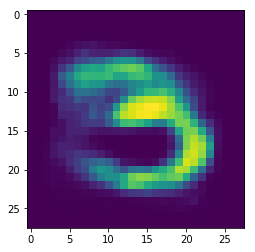

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  9



  0%|          | 1/214 [00:02<09:26,  2.66s/it]

[2 1 7 1 9 8 2 5 8 7 4 1 3 8 0 1 2 1 6 6 5 6 1 4 3 9 5 1 1 3 3 2 4 6 8 3 7
 8 5 9 5 5 0 6 0 8 3 3 6 6 7 6 6 1 4 6 5 9 0 8 1 1 2 0 8 2 0 5 4 4 6 9 3 8
 6 0 3 1 4 8 9 9 1 1 1 6 3 0 3 5 9 1 0 6 5 4 2 5 3 5 9 8 2 4 9 0 7 3 6 6 6
 8 5 9 0 6 2 2 9 3 9 2 4 0 4 0 0 0 7 1 8 0 3 5 1 3 7 9 8 6 0 9 8 9 3 1 6 3
 8 0 8 5 8 1 7 2 3 8 3 4 2 0 1 0 6 0 3 4 7 5 5 6 1 0 5 0 3 6 9 8 6 7 7 7 6
 9 4 0 6 5 9 0 9 2 0 7 3 5 9 2 6 8 0 2 3 0 8 1 5 2 6 8 1 2 8 5 7 1 1 2 1 4
 4 4 7 4 1 0 8 5 0 5 5 5 7 2 4 5 1 9 3 2 0 5 7 6 9 2 0 7 4 5 1 1 3 6]
[2 1 7 1 9 8 2 5 8 7 4 1 3 8 0 1 2 1 6 6 5 6 1 4 3 9 5 1 1 3 3 2 4 6 8 3 7
 8 5 9 5 5 0 6 0 8 3 3 6 6 7 6 6 1 4 6 5 9 0 8 1 1 2 0 8 2 0 5 4 4 6 9 3 8
 6 0 3 1 4 8 9 9 1 1 1 6 3 0 3 5 9 1 0 6 5 4 2 5 3 5 9 8 2 4 9 0 7 3 6 6 6
 8 5 9 0 6 2 2 9 3 9 2 4 0 4 0 0 0 7 1 8 0 3 5 1 3 7 9 8 6 0 9 8 9 3 1 6 3
 8 0 8 5 8 1 7 2 3 8 3 4 2 0 1 0 6 0 3 4 7 5 5 6 1 0 5 0 3 6 9 8 6 7 7 7 6
 9 4 0 6 5 9 0 9 2 0 7 3 5 9 2 6 8 0 2 3 0 8 1 5 2 6 8 1 2 8 5 7 1 1 2 1 4
 4 4 7 4 1 0 8 5 0 5 5 5 7 2 4


  1%|          | 2/214 [00:05<09:28,  2.68s/it]

[3 4 2 0 0 3 7 3 9 1 0 2 6 9 4 8 1 5 5 6 3 8 5 5 2 6 3 7 9 2 8 3 3 5 6 4 8
 8 5 9 7 8 0 2 4 3 2 0 7 4 5 8 6 1 3 9 2 7 8 4 8 7 7 7 2 3 4 0 9 2 8 5 5 1
 8 8 4 1 7 5 8 8 6 7 5 0 5 6 8 5 3 6 1 7 8 9 5 2 3 5 2 3 4 2 2 8 5 6 6 9 3
 3 0 5 7 1 1 4 7 6 2 7 1 3 8 8 3 7 2 9 0 5 6 6 5 3 0 2 4 5 3 7 5 7 5 9 1 0
 4 4 2 6 3 8 4 0 3 1 1 4 0 5 3 0 4 9 8 8 2 5 2 3 7 9 1 8 6 7 8 5 4 4 2 2 9
 6 2 6 6 2 4 1 2 1 2 2 1 8 2 5 3 9 1 8 5 1 8 7 8 8 9 1 0 5 9 1 6 1 0 9 5 1
 0 1 8 1 6 1 2 6 1 3 7 5 7 5 6 8 3 1 1 0 3 3 5 4 2 6 7 5 7 6 6 1 6 6]
[3 4 2 0 0 3 7 3 9 1 0 2 6 9 4 8 1 5 5 6 3 8 5 5 2 6 3 7 9 2 8 3 3 5 6 4 8
 8 5 9 7 8 0 2 4 3 2 0 7 4 5 8 6 1 3 9 2 7 8 4 8 7 7 7 2 3 4 0 9 2 8 5 5 1
 8 8 4 1 7 5 8 8 6 7 5 0 5 6 8 5 3 6 1 7 8 9 5 2 3 5 2 3 4 2 2 8 5 6 6 9 3
 3 0 5 7 1 1 4 7 6 2 7 1 3 8 8 3 7 2 9 0 5 6 6 5 3 0 2 4 5 3 7 5 7 5 9 1 0
 4 4 2 6 3 8 4 0 3 1 1 4 0 5 3 0 4 9 8 8 2 5 2 3 7 9 1 8 6 7 8 5 4 4 2 2 9
 6 2 6 6 2 4 1 2 1 2 2 1 8 2 5 3 9 1 8 5 1 8 7 8 8 9 1 0 5 9 1 6 1 0 9 5 1
 0 1 8 1 6 1 2 6 1 3 7 5 7 5 6


  1%|▏         | 3/214 [00:07<09:21,  2.66s/it]

[1 2 4 6 9 0 7 5 8 0 8 5 2 9 1 8 3 3 5 2 9 2 6 7 7 5 7 7 5 0 1 2 8 9 2 5 7
 5 7 2 8 3 7 6 3 7 9 6 1 4 1 8 7 5 8 5 0 2 0 4 4 9 9 7 5 5 1 3 2 7 1 6 2 0
 8 0 6 0 5 9 4 9 8 0 1 4 6 9 1 4 6 2 9 0 2 2 8 2 1 8 5 6 8 3 1 6 2 2 4 9 5
 6 2 9 8 5 2 7 2 9 3 7 2 3 3 3 4 1 8 8 7 0 4 1 1 4 8 5 6 3 0 1 8 7 2 9 5 3
 1 5 4 1 4 4 7 5 3 1 2 3 8 9 5 6 2 7 2 0 9 3 3 0 2 2 5 4 9 9 9 7 5 5 0 8 4
 3 8 2 2 9 3 4 7 9 4 5 1 0 8 9 3 8 5 0 7 9 8 6 9 2 5 1 6 1 8 6 9 1 7 6 9 4
 5 1 7 0 5 2 4 4 9 6 3 1 3 5 7 3 6 9 2 5 3 5 1 4 9 2 6 1 1 3 8 1 5 9]
[1 2 4 6 9 0 7 5 8 0 8 5 2 9 1 8 3 3 5 2 9 2 6 7 7 5 7 7 5 0 1 2 8 9 2 5 7
 5 7 2 8 3 7 6 3 7 9 6 1 4 1 8 7 5 8 5 0 2 0 4 4 9 9 7 5 5 1 3 2 7 1 6 2 0
 8 0 6 0 5 9 4 9 8 0 1 4 6 9 1 4 6 2 9 0 2 2 8 2 1 8 5 6 8 3 1 6 2 2 4 9 5
 6 2 9 8 5 2 7 2 9 3 7 2 3 3 3 4 1 8 8 7 0 4 1 1 4 8 5 6 3 0 1 8 7 2 9 5 3
 1 5 4 1 4 4 7 5 3 1 2 3 8 9 5 6 2 7 2 0 9 3 3 0 2 2 5 4 9 9 9 7 5 5 0 8 4
 3 8 2 2 9 3 4 7 9 4 5 1 0 8 9 3 8 5 0 7 9 8 6 9 2 5 1 6 1 8 4 9 1 7 6 9 4
 5 1 7 0 5 2 4 4 9 6 3 1 3 5 7


  2%|▏         | 4/214 [00:10<09:21,  2.67s/it]

[3 7 8 2 9 7 8 1 7 0 4 6 2 2 4 8 7 0 8 9 8 1 6 2 8 0 9 8 1 1 8 6 8 3 3 0 8
 8 6 8 3 7 5 6 2 8 9 1 4 2 0 4 3 9 0 5 5 5 0 3 3 0 5 8 1 8 8 4 0 7 5 8 7 9
 7 9 2 8 7 0 2 8 4 6 6 4 9 2 3 3 5 3 4 9 2 5 2 8 7 6 8 1 7 5 0 3 9 6 1 9 7
 3 2 7 9 4 6 0 1 4 7 5 3 0 1 2 7 1 3 5 4 3 0 0 9 7 9 4 3 2 8 9 0 5 4 8 3 9
 1 0 1 4 5 0 0 6 7 2 9 0 8 3 1 5 5 8 9 9 3 1 2 3 5 1 5 2 3 0 9 2 6 2 8 0 2
 8 0 9 9 5 5 2 6 6 8 8 9 5 2 1 1 2 0 6 7 2 1 7 7 7 1 1 5 3 8 6 4 1 3 1 4 1
 5 2 1 5 0 2 6 9 9 2 9 9 0 7 2 9 9 0 3 9 8 2 1 0 1 9 6 8 2 8 0 8 6 2]
[3 7 8 2 9 7 8 1 7 0 4 6 2 2 4 8 7 0 8 9 8 1 6 2 8 0 9 8 1 1 8 6 8 3 3 0 8
 8 6 8 3 7 5 6 2 8 9 1 4 2 0 4 3 9 0 5 5 5 0 3 3 0 5 8 1 8 8 4 0 7 5 8 7 9
 7 9 2 8 7 0 2 8 4 6 6 4 9 2 3 3 5 3 4 9 2 5 2 8 7 6 8 1 7 5 0 3 9 6 1 9 7
 3 2 7 9 4 6 0 1 4 7 5 3 0 1 2 7 1 3 5 4 3 0 0 9 7 9 4 3 2 8 9 0 5 4 8 3 9
 1 0 1 4 5 0 0 6 7 2 9 0 8 3 1 5 5 8 9 9 3 1 2 3 5 1 5 2 3 0 9 2 6 2 8 0 2
 8 0 9 9 5 5 2 6 6 8 8 9 5 2 1 1 2 0 6 7 2 1 7 7 7 1 1 5 3 8 6 4 1 3 1 4 1
 5 2 1 5 0 2 6 9 9 2 9 9 0 7 2


  2%|▏         | 5/214 [00:12<08:57,  2.57s/it]

[7 2 8 4 7 9 5 7 5 4 4 1 5 9 0 1 9 2 7 2 3 1 8 5 3 7 5 0 6 9 7 4 9 9 7 7 4
 5 2 4 8 4 7 4 3 7 0 2 8 6 9 9 8 7 7 3 1 5 8 8 0 3 8 9 7 2 8 6 1 8 2 0 6 7
 9 5 6 7 3 2 7 4 0 6 6 3 5 6 1 6 1 3 4 3 5 7 1 4 4 8 9 3 3 5 2 3 6 9 4 9 6
 4 0 1 3 6 7 5 2 7 4 6 8 8 8 2 0 1 3 2 2 4 3 9 2 9 7 8 4 8 5 9 8 2 7 6 9 3
 2 8 2 4 7 5 7 3 6 6 0 8 8 8 9 8 3 4 0 9 2 8 4 7 7 4 4 2 1 3 0 9 6 8 1 7 4
 2 1 6 6 3 2 6 6 2 7 7 8 8 2 2 6 3 9 3 6 5 8 2 1 1 2 6 2 1 9 8 7 7 0 7 1 3
 8 8 8 4 3 7 3 3 8 6 6 3 2 1 1 5 2 2 3 5 8 5 4 0 5 4 8 9 4 1 6 2 0 5]
[7 2 8 4 7 9 5 7 5 4 4 1 5 9 0 1 4 2 7 2 3 1 8 5 3 7 5 0 6 9 7 4 9 9 7 7 4
 5 2 4 8 4 7 4 3 7 0 2 8 6 9 9 8 7 7 3 1 5 8 8 0 3 8 9 7 2 8 6 1 8 2 0 6 7
 9 5 6 7 3 2 7 4 0 6 6 3 5 6 1 6 1 3 4 3 5 7 1 4 4 8 9 3 3 5 2 3 6 9 4 9 6
 4 0 1 3 6 7 5 2 7 4 6 8 8 8 2 0 1 3 2 2 9 3 9 2 9 7 8 4 8 5 9 8 2 7 6 9 3
 2 8 2 4 7 5 7 3 6 6 0 8 8 8 9 8 3 4 0 9 2 8 4 7 7 4 4 2 1 3 0 9 6 8 1 7 4
 2 1 6 6 3 2 6 6 2 7 7 8 8 2 2 6 3 9 3 6 5 8 2 1 1 2 6 2 1 9 8 7 7 0 7 1 3
 8 8 8 4 3 7 3 3 8 6 6 3 2 1 1


  3%|▎         | 6/214 [00:14<08:39,  2.50s/it]

[3 9 7 4 7 1 4 0 1 2 8 2 0 7 1 7 3 8 2 4 7 5 6 6 1 2 9 7 3 2 7 8 3 5 4 3 9
 6 1 0 5 1 7 6 1 6 0 6 7 0 6 3 9 8 3 9 1 1 4 3 2 3 7 6 1 9 6 2 5 1 3 0 8 5
 9 0 0 6 2 7 2 5 7 7 1 2 6 0 8 3 1 4 8 2 2 0 7 2 2 4 8 3 8 2 9 0 1 7 2 7 6
 6 0 6 5 3 5 1 4 6 6 4 6 6 3 2 4 5 0 8 6 3 8 6 5 8 4 4 8 3 3 3 7 4 8 3 4 9
 2 4 0 6 0 1 6 6 8 0 8 0 2 6 4 0 5 0 4 2 2 3 2 6 7 2 1 0 1 7 1 9 5 4 4 4 4
 1 6 8 1 5 0 1 9 2 4 5 6 3 9 0 0 3 2 6 6 7 2 0 0 2 3 8 7 3 5 3 1 4 4 9 0 2
 1 8 2 2 8 6 4 1 0 3 9 0 4 2 3 3 5 8 8 6 3 0 1 1 9 0 2 3 6 0 6 8 9 3]
[3 9 7 4 7 1 4 0 1 2 8 2 0 7 1 7 3 8 2 4 7 5 6 6 1 2 9 7 3 2 7 8 3 5 4 3 9
 6 1 0 5 1 7 6 1 6 0 6 7 0 6 3 9 8 3 9 1 1 4 3 2 3 7 6 1 9 6 2 5 1 3 0 8 5
 9 0 0 6 2 7 2 5 7 7 1 2 6 0 8 3 1 4 8 2 2 0 7 2 2 4 8 3 8 2 9 0 1 7 2 7 6
 6 0 6 5 3 5 1 4 6 6 4 6 6 3 2 4 5 0 8 6 3 8 6 5 8 4 4 8 3 3 3 7 4 8 3 4 9
 2 4 0 6 0 1 6 6 8 0 8 0 2 6 4 0 5 0 4 2 2 3 2 6 7 2 1 0 1 7 1 9 5 4 4 4 4
 1 6 8 1 5 0 1 9 2 4 5 6 3 9 0 0 3 2 6 6 7 2 0 0 2 3 8 7 3 5 3 1 4 4 9 0 2
 1 8 2 2 8 6 4 1 0 3 9 0 4 2 3


  3%|▎         | 7/214 [00:17<08:26,  2.45s/it]

[6 4 8 7 1 7 1 6 1 9 1 9 0 9 0 9 1 4 3 5 6 1 1 4 1 6 9 7 1 7 3 5 7 1 8 0 2
 8 3 5 1 5 2 4 0 1 6 0 4 7 8 0 3 7 5 3 9 2 7 0 2 7 1 6 9 8 4 4 9 1 4 0 2 4
 7 8 4 1 6 8 4 2 0 3 1 8 2 5 1 8 2 6 8 0 8 6 8 4 7 0 0 6 3 4 2 9 1 3 8 9 1
 5 9 4 2 5 8 3 7 5 6 2 2 8 3 6 0 7 8 5 8 3 1 3 9 3 6 9 3 5 4 8 1 1 0 4 9 3
 8 3 0 6 8 8 2 9 3 1 9 6 8 2 8 8 8 3 2 7 4 0 6 2 9 1 2 4 7 5 7 3 7 7 8 5 0
 4 4 6 2 1 4 9 3 4 4 7 8 1 8 2 7 9 3 1 6 6 3 5 3 8 6 3 4 9 0 5 7 8 6 9 5 8
 7 6 7 0 1 1 3 9 6 3 5 7 8 7 3 5 1 9 7 0 3 1 3 7 3 7 6 0 8 8 6 7 8 0]
[6 4 8 7 1 7 1 6 1 9 1 9 0 9 0 9 1 4 3 5 6 1 1 4 1 6 9 7 1 7 3 5 7 1 8 0 2
 8 3 5 1 5 2 4 0 1 6 0 4 7 8 0 3 7 5 3 9 2 7 0 2 7 1 6 9 8 4 4 9 1 4 0 2 4
 7 8 4 1 6 8 4 2 0 3 1 8 2 5 1 8 2 6 8 0 8 6 8 4 7 0 0 6 3 4 2 9 1 3 8 9 1
 5 9 4 2 5 8 3 7 5 6 2 2 8 3 6 0 7 8 5 8 3 1 3 9 3 6 9 3 5 4 8 1 1 0 4 9 3
 8 3 0 6 8 8 2 9 3 1 9 6 8 2 8 8 8 3 2 7 4 0 6 2 9 1 2 4 7 5 7 3 7 7 8 5 0
 4 4 6 2 1 4 9 3 4 4 7 8 1 8 2 7 9 3 1 6 6 3 5 3 8 6 3 4 9 0 5 7 8 6 9 5 8
 7 6 7 0 1 1 3 9 6 3 5 7 8 7 3


  4%|▎         | 8/214 [00:19<08:17,  2.41s/it]

[2 0 9 4 2 9 8 9 3 9 2 0 4 2 8 4 5 3 0 8 0 8 1 7 8 2 0 4 4 7 5 4 0 6 2 0 9
 7 8 8 8 7 9 6 9 5 5 8 6 7 1 9 9 2 1 2 9 0 6 7 1 0 1 4 6 4 7 7 1 3 2 7 7 1
 8 2 3 8 0 9 8 5 3 6 2 4 5 3 0 1 1 2 3 1 7 9 0 6 8 1 8 5 7 4 2 7 8 7 2 8 8
 9 4 0 1 6 6 8 8 9 5 1 5 1 1 9 6 7 4 0 4 4 5 8 3 7 5 1 2 8 0 6 0 7 2 3 8 5
 3 9 1 2 7 1 1 1 6 1 1 8 5 0 8 5 6 0 1 7 3 3 3 1 1 3 5 9 5 3 4 4 8 9 2 7 7
 8 3 7 8 1 8 1 1 1 6 7 1 2 2 9 5 4 8 0 3 7 7 6 1 0 0 1 3 4 3 8 3 1 0 3 5 1
 0 9 7 9 1 4 1 8 9 8 7 4 6 1 2 1 6 2 0 5 2 7 9 7 3 5 7 4 9 1 1 6 7 6]
[2 0 9 4 2 9 8 9 3 9 2 0 4 2 8 4 5 3 0 8 0 8 1 7 8 2 0 4 4 7 5 4 0 6 2 0 9
 7 8 8 8 7 9 6 9 5 5 8 6 7 1 9 9 2 1 2 9 0 6 7 1 0 1 4 6 4 7 7 1 3 2 7 7 1
 8 2 3 8 0 9 8 5 3 6 2 4 5 3 0 1 1 2 3 1 7 9 0 6 8 1 8 5 7 4 2 7 8 7 2 8 8
 9 4 0 1 6 6 8 8 9 5 1 5 1 1 9 6 7 4 0 4 4 5 8 3 7 5 1 2 8 0 6 0 7 2 3 8 5
 3 9 1 2 7 1 1 1 6 1 1 8 5 0 8 5 6 0 1 7 3 3 3 1 1 3 5 9 5 3 4 4 8 9 2 7 7
 8 3 7 8 1 8 1 1 1 6 7 1 2 2 9 5 4 8 0 3 7 7 6 1 0 0 1 3 4 3 8 3 1 0 3 5 1
 0 9 7 9 1 4 1 8 9 8 7 4 6 1 2


  4%|▍         | 9/214 [00:21<08:08,  2.38s/it]

[1 9 7 4 1 5 7 3 9 9 1 9 1 6 3 2 5 1 3 9 6 7 6 5 1 3 5 9 1 8 0 4 7 2 0 1 1
 9 6 9 3 3 5 4 5 0 1 4 8 0 0 1 6 6 9 6 0 6 1 5 3 6 0 7 3 0 9 0 8 7 8 1 1 7
 1 7 1 4 9 2 7 2 3 1 6 1 3 7 4 8 4 0 8 5 7 4 4 4 7 1 7 1 1 3 9 3 5 7 4 7 3
 8 3 8 5 1 2 2 9 2 1 9 3 7 4 8 8 4 9 2 0 7 4 8 4 6 9 5 9 2 5 9 4 0 2 9 2 2
 3 5 9 0 1 8 3 4 6 9 1 4 3 9 3 5 1 4 5 4 0 7 1 2 9 6 8 8 0 1 4 3 2 4 1 7 4
 4 9 6 3 0 3 2 2 9 8 9 2 8 9 6 3 7 6 1 6 9 6 3 1 0 2 8 6 4 1 6 0 6 2 8 3 0
 4 0 7 9 1 2 0 4 9 0 1 7 2 6 4 7 1 8 2 6 6 5 2 6 0 0 8 3 5 2 0 1 4 1]
[1 9 7 4 1 5 7 3 9 9 1 9 1 6 3 2 5 1 3 9 6 7 6 5 1 3 5 9 1 8 0 4 7 2 0 1 1
 9 6 9 3 3 5 4 5 0 1 4 8 0 0 1 6 6 9 6 0 6 1 5 3 6 0 7 3 0 9 0 8 7 8 1 1 7
 1 7 1 4 9 2 7 2 3 1 6 1 3 7 4 8 4 0 8 5 7 4 4 4 7 1 7 1 1 3 9 3 5 7 4 7 3
 8 3 8 5 1 2 2 9 2 1 9 3 7 4 8 8 4 9 2 0 7 4 8 4 6 9 5 9 2 5 9 4 0 2 9 2 2
 3 5 9 0 1 8 3 4 6 9 1 4 3 9 3 5 1 4 5 4 0 7 1 2 9 6 8 8 0 1 4 3 2 4 1 7 4
 4 9 6 3 0 3 2 2 9 8 9 2 8 9 6 3 7 6 1 6 9 6 3 1 0 2 8 6 4 1 6 0 6 2 8 3 0
 4 0 7 9 1 2 0 4 9 0 1 7 2 6 4


  5%|▍         | 10/214 [00:23<08:02,  2.36s/it]

[8 6 4 5 1 4 7 9 9 8 0 0 3 7 0 6 2 0 8 4 6 7 1 7 1 2 2 6 3 8 6 8 3 7 8 8 8
 2 5 3 7 6 3 8 6 1 1 4 7 1 2 5 8 0 5 5 1 2 0 4 9 9 8 0 7 8 8 2 2 2 7 1 5 5
 9 0 2 1 5 5 5 3 6 5 7 7 3 8 1 3 3 3 4 0 8 5 6 4 4 8 5 3 5 6 0 4 6 1 1 5 9
 0 4 4 3 6 8 3 1 4 4 7 9 6 2 1 2 6 1 4 4 2 6 7 9 1 7 5 5 2 1 0 6 7 5 8 2 7
 1 3 8 4 2 2 4 7 0 2 6 7 2 0 7 3 4 2 3 5 4 8 1 4 4 2 3 5 5 7 1 0 3 2 7 6 4
 5 7 3 6 8 6 7 4 9 0 0 3 1 4 0 6 5 2 8 1 3 2 3 1 0 4 7 0 0 1 4 3 2 6 5 4 3
 2 7 7 7 7 4 1 1 5 2 7 5 4 9 0 5 6 8 1 4 5 9 2 6 9 7 9 5 5 4 8 1 5 6]
[8 6 4 5 1 4 7 9 9 8 0 0 3 7 0 6 2 0 8 4 6 7 1 7 1 2 2 6 3 8 6 8 3 7 8 8 8
 2 5 3 7 6 3 8 6 1 1 4 7 1 2 5 8 0 5 5 1 2 0 4 9 9 8 0 7 8 8 2 2 2 7 1 5 5
 9 0 2 1 5 5 5 3 6 5 7 7 3 8 1 3 3 3 4 0 8 5 6 4 4 8 5 3 5 6 0 4 6 1 1 5 9
 0 4 4 3 6 8 3 1 4 4 7 9 6 2 1 2 6 1 4 4 2 6 7 9 1 7 5 5 2 1 0 6 7 5 8 2 7
 1 3 8 4 2 2 4 7 0 2 6 7 2 0 7 3 4 2 3 5 4 8 1 4 4 2 3 5 5 7 1 0 3 2 7 6 4
 5 7 3 6 8 6 7 4 9 0 0 3 1 4 0 6 5 2 8 1 3 2 3 1 0 4 7 0 0 1 4 3 2 6 5 4 3
 2 7 7 7 7 4 1 1 5 2 7 5 4 9 0


  5%|▌         | 11/214 [00:25<07:55,  2.34s/it]

[2 4 7 9 4 6 5 2 0 4 5 0 4 1 6 5 0 4 8 7 5 4 6 6 9 2 4 0 8 4 5 2 2 9 8 8 6
 1 5 5 1 7 6 1 1 4 7 6 8 2 5 4 7 8 4 4 6 1 2 4 4 1 5 0 0 3 4 0 7 4 6 1 8 7
 9 7 6 4 1 9 1 4 2 3 2 2 7 4 4 4 6 6 0 2 4 9 7 9 6 6 4 5 9 7 2 2 5 2 9 4 6
 1 9 3 5 1 6 6 1 2 4 2 4 6 8 0 4 5 3 2 0 5 6 5 5 5 9 2 4 2 9 2 8 7 9 2 4 3
 8 5 8 0 6 1 5 4 6 3 1 6 7 6 0 9 8 5 9 3 6 3 6 7 6 5 4 9 2 3 8 4 9 1 1 6 2
 2 9 1 4 9 9 8 9 4 1 5 9 3 1 8 1 4 1 5 3 8 4 7 1 5 4 4 1 2 2 6 2 3 9 0 0 5
 8 4 6 0 9 5 0 0 4 9 1 8 3 6 8 4 6 7 4 8 0 8 5 5 4 7 7 4 3 6 9 1 4 7]
[2 4 7 9 4 6 5 2 0 4 5 0 4 1 6 5 0 4 8 7 5 4 6 6 9 2 4 0 8 4 5 2 2 9 8 8 6
 1 5 5 1 7 6 1 1 4 7 6 8 2 5 4 7 8 4 4 6 1 2 4 4 1 5 0 0 3 4 0 7 4 6 1 8 7
 9 7 6 4 1 9 1 4 2 3 2 2 7 4 4 4 6 6 0 2 4 9 7 9 6 6 4 5 9 7 2 2 5 2 9 4 6
 1 9 3 5 1 6 6 1 2 4 2 4 6 8 0 4 5 3 2 0 5 6 5 5 5 9 2 4 2 9 2 8 7 9 2 4 3
 8 5 8 0 6 1 5 4 6 3 1 6 7 6 0 9 8 5 9 3 6 3 6 7 6 5 4 9 2 3 8 4 9 1 1 6 2
 2 9 1 4 9 9 8 9 4 1 5 9 3 1 8 1 4 1 5 3 8 4 7 1 5 4 4 1 2 2 6 2 3 9 0 0 5
 8 4 6 0 9 5 0 0 4 9 1 8 3 6 8


  6%|▌         | 12/214 [00:28<07:52,  2.34s/it]

[4 6 4 8 8 8 6 9 2 8 8 0 7 0 6 6 3 7 7 0 6 2 4 7 8 6 9 9 8 1 3 3 0 9 4 8 0
 8 8 5 8 4 1 2 9 2 6 4 1 3 9 5 9 8 7 1 2 7 7 4 8 5 8 9 7 2 1 3 6 1 3 3 9 2
 3 9 6 9 9 1 6 8 1 5 8 1 5 8 7 4 7 0 5 5 0 1 7 4 9 3 9 6 0 3 7 0 8 8 8 6 9
 1 7 1 0 5 9 1 7 6 7 9 1 3 4 0 6 3 6 1 6 8 1 0 9 8 7 9 3 0 4 8 3 4 8 6 0 4
 4 8 2 6 9 3 4 9 7 7 9 4 6 9 4 0 2 9 9 4 2 4 2 0 5 7 5 8 1 8 2 7 7 1 2 9 8
 0 1 2 2 7 5 4 8 3 8 6 5 5 1 6 9 6 2 1 9 4 6 1 0 2 3 6 6 2 5 8 1 4 3 2 6 8
 5 0 7 1 9 9 9 1 3 7 6 4 9 4 7 8 5 3 1 0 3 8 2 8 6 2 9 8 4 8 7 7 0 1]
[4 6 4 8 8 8 6 9 2 8 8 0 7 0 6 6 3 7 7 0 6 2 4 7 8 6 9 9 8 1 3 3 0 9 4 8 0
 8 8 5 8 4 1 2 9 2 6 4 1 3 9 5 9 8 7 1 2 7 7 4 8 5 8 9 7 2 1 3 6 1 3 3 9 2
 3 9 6 9 9 1 6 8 1 5 8 1 5 8 7 4 7 0 5 5 0 1 7 4 9 3 9 6 0 3 7 0 8 8 8 6 9
 1 7 1 0 5 9 1 7 6 7 9 1 3 4 0 6 3 6 1 6 8 1 0 9 8 7 9 3 0 4 8 3 4 8 6 0 4
 4 8 2 6 9 3 4 9 7 7 9 4 6 9 4 0 2 9 9 4 2 4 2 0 5 7 5 8 1 8 2 7 7 1 2 9 8
 0 1 2 2 7 5 4 8 3 8 6 5 5 1 6 9 6 2 1 9 4 6 1 0 2 3 6 6 2 5 8 1 4 3 2 6 8
 5 0 7 1 9 9 9 1 3 7 6 4 9 4 7


  6%|▌         | 13/214 [00:30<07:49,  2.33s/it]

[5 6 0 2 3 9 0 2 3 6 3 4 7 9 0 0 9 1 6 2 6 4 8 9 9 2 6 5 8 8 1 0 3 2 2 2 6
 7 1 7 5 8 1 4 8 0 9 5 5 2 4 0 4 6 9 0 3 1 7 2 0 6 4 0 0 7 8 8 4 6 7 1 6 1
 1 6 3 9 6 2 2 4 9 7 0 3 1 4 4 5 8 8 1 9 1 3 6 7 6 2 1 2 3 6 3 6 0 1 3 8 4
 8 6 8 7 1 3 6 9 9 1 0 0 9 6 1 9 0 9 7 1 6 4 3 8 3 6 0 3 4 9 4 3 7 7 8 7 1
 5 0 5 5 2 9 4 7 7 3 1 6 0 3 6 8 0 2 9 0 7 5 6 2 5 8 5 2 4 4 0 9 9 7 6 6 2
 8 8 3 0 8 0 1 4 9 8 5 0 6 5 4 9 2 9 0 0 4 2 6 4 3 9 9 5 7 7 8 6 5 0 7 5 1
 7 4 8 8 1 8 6 3 3 9 2 0 8 1 2 7 7 2 3 9 1 0 9 6 2 5 8 8 5 3 6 2 1 2]
[5 6 0 2 3 9 0 2 3 6 3 4 7 9 0 0 9 1 6 2 6 4 8 9 9 2 6 5 8 8 1 0 3 2 2 2 6
 7 1 7 5 8 1 4 8 0 9 5 5 2 4 0 4 6 9 0 3 1 7 2 0 6 4 0 0 7 8 8 4 6 7 1 6 1
 1 6 3 9 6 2 2 4 9 7 0 3 1 4 4 5 8 8 1 9 1 3 6 7 6 2 1 2 3 6 3 6 0 1 3 8 4
 8 6 8 7 1 3 6 9 9 1 0 0 9 6 1 9 0 9 7 1 6 4 3 8 3 6 0 3 4 9 4 3 7 7 8 7 1
 5 0 5 5 2 9 4 7 7 3 1 6 0 3 6 8 0 2 9 0 7 5 6 2 5 8 5 2 4 4 0 9 9 7 6 6 2
 8 8 3 0 8 0 1 4 9 8 5 0 6 5 4 9 2 9 0 0 4 2 6 4 3 9 9 5 7 7 8 6 5 0 7 5 1
 7 4 8 8 1 8 6 3 3 9 2 0 8 1 2


  7%|▋         | 14/214 [00:32<07:46,  2.33s/it]

[3 7 5 2 8 4 7 3 3 1 9 4 6 7 7 6 5 4 7 7 1 1 2 9 2 8 0 5 7 9 9 0 1 6 5 4 0
 4 3 2 6 2 8 2 5 7 0 6 0 3 0 5 8 9 7 3 4 2 6 6 2 4 2 9 6 8 9 3 2 3 1 3 2 4
 9 4 1 2 4 0 7 4 9 4 3 7 7 4 5 8 5 8 6 2 1 7 8 6 0 4 9 1 3 6 4 6 9 8 0 8 3
 0 6 4 4 3 0 8 6 1 8 5 1 9 4 8 4 7 1 7 8 8 1 3 5 3 8 4 0 1 2 7 1 4 0 7 6 0
 4 3 6 3 3 0 5 5 4 6 3 5 8 2 3 3 3 3 0 1 5 9 2 7 4 0 6 6 5 7 2 0 2 7 0 5 7
 9 1 6 4 0 5 0 4 5 2 3 9 9 3 0 6 8 8 9 6 7 4 2 6 3 4 1 2 2 4 2 2 4 1 1 2 0
 1 4 1 3 9 4 3 0 6 2 6 9 6 5 4 1 0 2 3 8 0 9 5 5 4 4 7 6 1 4 1 2 3 3]
[3 7 5 2 8 4 7 3 3 1 9 4 6 7 7 6 5 4 7 7 1 1 2 9 2 8 0 5 7 9 9 0 1 6 5 4 0
 4 3 2 6 2 8 2 5 7 0 6 0 3 0 5 8 9 7 3 4 2 6 6 2 4 2 9 6 8 9 3 2 3 1 3 2 4
 9 4 1 2 4 0 7 4 9 4 3 7 7 4 5 8 5 8 6 2 1 7 8 6 0 4 9 1 3 6 4 6 9 8 0 8 3
 0 6 4 4 3 0 8 6 1 8 5 1 9 4 8 4 7 1 7 8 8 1 3 5 3 8 4 0 1 2 7 1 4 0 7 6 0
 4 3 6 3 3 0 5 5 4 6 3 5 8 2 3 3 3 3 0 1 5 9 2 7 4 0 6 6 5 7 2 0 2 7 0 5 7
 9 1 6 4 0 5 0 4 5 2 3 9 9 3 0 6 8 8 9 6 7 4 2 6 3 4 1 2 2 4 2 2 4 1 1 2 0
 1 4 1 3 9 4 3 0 6 2 6 9 6 5 4


  7%|▋         | 15/214 [00:34<07:42,  2.32s/it]

[9 7 8 4 2 5 3 6 4 6 4 0 8 3 2 0 0 2 6 5 2 4 0 6 3 4 2 8 3 1 0 7 2 0 9 6 0
 1 6 1 9 3 1 3 8 6 2 4 7 8 3 8 6 8 2 7 6 2 7 4 3 8 1 6 0 4 7 4 5 2 1 7 1 5
 1 1 6 5 5 5 2 7 4 1 0 7 8 7 6 0 5 8 3 9 6 1 4 4 2 4 9 6 7 3 6 4 0 4 9 6 6
 9 3 4 8 3 8 6 7 4 7 3 3 6 9 8 2 3 9 7 9 6 6 5 8 1 9 9 2 8 3 4 1 8 2 3 0 5
 6 8 8 7 7 9 6 9 5 5 6 4 9 3 9 2 7 3 6 9 6 7 3 6 3 4 1 7 9 3 3 7 2 7 8 0 0
 1 8 4 0 3 0 2 4 3 3 4 4 9 3 7 3 4 1 2 5 6 1 4 4 2 4 4 2 1 1 4 8 0 5 9 6 1
 8 6 6 8 8 5 1 1 8 4 8 9 1 2 6 9 2 7 4 5 7 5 6 7 9 8 0 2 3 0 7 4 9 7]
[9 7 8 4 2 5 3 6 4 6 4 0 8 3 2 0 0 2 6 5 2 4 0 6 3 4 2 8 3 1 0 7 2 0 9 6 0
 1 6 1 9 3 1 3 8 6 2 4 7 8 3 8 6 8 2 7 6 2 7 4 3 8 1 6 0 4 7 4 5 2 1 7 1 5
 1 1 6 5 5 5 2 7 4 1 0 7 8 7 6 0 5 8 3 9 6 1 4 4 2 4 9 6 7 3 6 4 0 4 9 6 6
 9 3 4 8 3 8 6 7 4 7 3 3 6 9 8 2 3 9 7 9 6 6 5 8 1 9 9 2 8 3 4 1 8 2 3 0 5
 6 8 8 7 7 9 6 9 5 5 6 4 9 3 9 2 7 3 6 9 6 7 3 6 3 4 1 7 9 3 3 7 2 7 8 0 0
 1 2 4 0 3 0 2 4 3 3 4 4 9 3 7 3 4 1 2 5 6 1 4 4 2 4 4 2 1 1 4 8 0 5 9 6 1
 8 6 6 8 8 5 1 1 8 4 8 9 1 2 6


  7%|▋         | 16/214 [00:37<07:39,  2.32s/it]

[3 4 5 1 4 6 5 1 1 9 6 5 6 5 9 8 6 0 3 6 0 6 0 6 9 9 6 0 3 3 3 5 7 7 0 8 4
 4 6 4 6 3 1 4 2 9 8 0 6 9 3 7 6 9 5 4 4 3 3 8 6 5 8 5 8 5 7 1 8 9 8 6 5 1
 9 8 8 6 9 2 8 1 0 5 5 8 5 1 4 9 9 7 9 3 7 0 8 8 3 6 4 6 9 4 9 3 9 4 5 2 3
 7 0 8 8 6 6 1 6 3 1 7 1 8 3 5 8 9 6 4 2 7 6 9 4 9 7 6 2 5 2 8 3 7 9 4 7 4
 0 9 8 5 1 1 3 4 6 2 0 8 5 3 4 3 7 4 4 8 8 3 6 3 7 8 0 2 1 0 2 7 2 4 9 8 9
 0 7 6 1 1 1 0 2 4 0 1 3 8 7 8 3 0 8 3 7 0 2 5 4 7 7 0 8 3 2 8 0 4 2 1 1 0
 8 9 4 8 3 7 1 4 4 7 0 9 6 1 3 9 1 6 3 9 5 8 9 2 7 6 1 2 3 3 3 3 2 0]
[3 4 5 1 4 6 5 1 1 9 6 5 6 5 9 8 6 0 3 6 0 6 0 6 9 9 6 0 3 3 3 5 7 7 0 8 4
 4 6 4 6 3 1 4 2 9 8 0 6 9 3 7 6 9 5 4 4 3 3 8 6 5 8 5 8 5 7 1 8 9 8 6 5 1
 9 8 8 6 9 2 8 1 0 5 5 8 5 1 4 9 9 7 9 3 7 0 8 8 3 6 4 6 9 4 9 3 9 4 5 2 3
 7 0 8 8 6 6 1 6 3 1 7 1 8 3 5 8 9 6 4 2 7 6 9 4 9 7 6 2 5 2 8 3 7 9 4 7 4
 0 9 8 5 1 1 3 4 6 2 0 8 5 3 4 3 7 4 4 8 8 3 6 3 7 8 0 2 1 0 2 7 2 4 9 8 9
 0 7 6 1 1 1 0 2 4 0 1 3 8 7 8 3 0 8 3 7 0 2 5 4 7 7 0 8 3 2 8 0 4 2 1 1 0
 8 9 4 8 3 7 1 4 4 7 0 9 6 1 3


  8%|▊         | 17/214 [00:39<07:36,  2.32s/it]

[6 1 1 0 6 5 4 2 4 7 1 2 8 4 0 1 3 5 9 2 8 6 5 9 9 5 9 2 5 3 0 1 8 6 8 1 3
 6 4 0 2 6 7 1 7 1 2 7 7 8 7 4 8 2 5 7 9 2 1 9 9 8 6 2 8 1 8 5 0 6 9 1 9 1
 7 9 3 0 9 1 5 7 4 6 0 5 7 2 8 7 6 3 8 5 3 7 6 1 1 9 3 2 9 3 9 4 5 8 0 0 5
 1 4 3 5 4 1 0 5 8 2 2 1 3 1 7 9 2 1 1 0 3 3 7 2 0 0 0 1 2 9 4 7 6 5 8 4 7
 4 4 7 8 0 8 5 8 8 6 6 9 0 9 5 7 5 6 5 1 7 1 1 3 5 8 4 2 1 2 6 2 8 5 3 5 5
 0 6 6 3 8 4 7 2 3 0 6 8 5 9 1 2 2 9 6 0 2 5 1 1 4 7 3 3 5 4 6 2 1 2 9 1 2
 4 5 8 9 3 8 1 5 1 2 2 9 4 5 0 8 1 5 1 9 3 7 6 1 4 0 5 1 6 4 7 1 8 2]
[6 1 1 0 6 5 4 2 4 7 1 2 8 4 0 1 3 5 9 2 8 6 5 9 9 5 9 2 5 3 0 1 8 6 8 1 3
 6 4 0 2 6 7 1 7 1 2 7 7 8 7 4 8 2 5 7 9 2 1 9 9 8 6 2 8 1 8 5 0 6 9 1 9 1
 7 9 3 0 9 1 5 7 4 6 0 5 7 2 8 7 6 3 8 5 3 7 6 1 1 9 3 2 9 3 9 4 5 8 0 0 5
 1 4 3 5 4 1 0 5 8 2 2 1 3 1 7 9 2 1 1 0 3 3 7 2 0 0 0 1 2 9 4 7 6 5 8 4 7
 4 4 7 8 0 8 5 8 8 6 6 9 0 9 5 7 5 6 5 1 7 1 1 3 5 8 4 2 1 2 6 2 8 5 3 5 5
 0 6 6 3 8 4 7 2 3 0 6 8 5 9 1 2 2 9 6 0 2 5 1 1 4 7 3 3 5 4 6 2 1 2 9 1 2
 4 5 8 9 3 8 1 5 1 2 2 9 4 5 0


  8%|▊         | 18/214 [00:41<07:34,  2.32s/it]

[7 3 4 8 9 4 7 2 1 5 4 6 9 2 3 9 4 9 1 5 1 4 1 4 6 6 0 1 1 8 2 3 6 0 3 6 0
 9 3 5 2 4 5 0 8 2 3 2 4 0 7 6 9 9 4 7 6 1 7 3 5 6 0 3 9 9 3 1 1 4 0 0 8 4
 2 4 9 6 8 3 2 3 9 2 9 4 0 7 2 8 2 6 3 4 2 9 6 7 7 5 8 5 9 1 0 1 7 6 4 3 8
 4 7 9 1 5 4 4 1 2 1 6 5 1 4 1 8 8 9 7 5 1 5 7 5 2 2 8 2 1 8 8 7 0 8 8 5 7
 5 5 2 5 7 3 8 2 2 1 7 5 4 2 0 7 6 7 5 7 8 5 4 2 6 9 6 0 1 7 4 5 7 1 0 5 3
 2 2 2 3 7 7 1 0 9 0 4 7 1 4 6 5 0 5 7 4 3 8 1 6 6 0 1 0 8 1 0 3 9 1 0 2 0
 8 0 7 7 3 1 6 0 4 3 0 1 2 4 6 4 7 1 5 6 8 5 5 4 3 6 6 2 4 8 4 2 2 9]
[7 3 4 8 9 4 7 2 1 5 4 6 9 2 3 9 4 9 1 5 1 4 1 4 6 6 0 1 1 8 2 3 6 0 3 6 0
 9 3 5 2 4 5 0 8 2 3 2 4 0 7 6 9 9 4 7 6 1 7 3 5 6 0 3 9 9 3 1 1 4 0 0 8 4
 2 4 9 6 8 3 2 3 9 2 9 4 0 7 2 8 2 6 3 4 2 9 6 7 7 5 8 5 9 1 0 1 7 6 4 3 8
 4 7 9 1 5 4 4 1 2 1 6 5 1 4 1 8 8 9 7 5 1 5 7 5 2 2 8 2 1 8 8 7 0 8 8 5 7
 5 5 2 5 7 3 8 2 2 1 7 5 4 2 0 7 6 7 5 7 8 5 4 2 6 9 6 0 1 7 4 5 7 1 0 5 3
 2 2 2 3 7 7 1 0 9 0 4 7 1 4 6 5 0 5 7 4 3 8 1 6 6 0 1 0 8 1 0 3 9 1 0 2 0
 8 0 7 7 3 1 6 0 4 3 0 1 2 4 6


  9%|▉         | 19/214 [00:44<07:31,  2.32s/it]

[8 1 6 3 7 0 7 2 8 5 8 4 5 6 1 2 3 9 2 2 6 7 8 0 3 8 8 0 2 3 9 4 2 6 7 9 4
 5 3 6 0 2 9 7 1 0 1 0 0 1 3 4 2 1 6 8 3 8 5 6 0 3 2 1 1 4 9 2 3 3 2 0 5 1
 3 8 8 8 1 9 3 8 2 3 5 9 5 8 8 3 7 8 3 9 3 3 3 0 8 0 3 4 2 1 4 5 9 2 4 8 9
 7 7 4 4 4 7 3 5 9 3 0 3 0 0 5 2 1 8 4 6 8 8 8 0 2 6 2 0 6 1 9 2 1 5 7 5 4
 2 7 1 5 0 5 2 0 7 0 8 6 1 3 5 9 9 9 4 3 0 4 9 1 2 2 1 3 5 8 3 6 9 5 0 1 2
 5 8 3 1 6 5 0 8 4 0 8 9 5 5 6 5 1 7 6 1 5 8 7 6 2 0 2 0 8 6 1 3 6 1 8 6 4
 5 2 8 9 5 6 3 6 0 0 8 8 7 5 0 3 6 4 5 2 9 8 8 5 6 7 4 1 1 6 1 5 0 1]
[8 1 6 3 7 0 7 2 8 5 8 4 5 6 1 2 3 9 2 2 6 7 8 0 3 8 8 0 2 3 9 4 2 6 7 9 4
 5 3 6 0 2 9 7 1 0 1 0 0 1 3 4 2 1 6 8 3 8 5 6 0 3 2 1 1 4 9 2 3 3 2 0 5 1
 3 8 8 8 1 9 3 8 2 3 5 9 5 8 8 3 7 8 3 9 3 3 3 0 8 0 3 4 2 1 4 5 9 2 4 8 9
 7 7 4 4 4 7 3 5 9 3 0 3 0 0 5 2 1 8 4 6 8 8 8 0 2 6 2 0 6 1 9 2 1 5 7 5 4
 2 7 1 5 0 5 2 0 7 0 8 6 1 3 5 9 9 9 4 3 0 4 9 1 2 2 1 3 5 8 3 6 9 5 0 1 2
 5 8 3 1 6 5 0 8 4 0 8 9 5 5 6 5 1 7 6 1 5 8 7 6 2 0 2 0 8 6 1 3 6 1 8 6 4
 5 2 8 9 5 6 3 6 0 0 8 8 7 5 0


  9%|▉         | 20/214 [00:46<07:27,  2.31s/it]

[3 7 1 7 5 2 1 7 2 5 6 1 8 2 2 3 7 7 6 5 4 5 7 5 2 0 1 3 6 6 7 7 7 2 1 2 5
 1 2 4 8 0 6 6 9 6 7 7 7 5 6 8 3 6 1 2 2 4 4 2 5 2 9 0 8 6 9 1 9 5 7 3 3 4
 9 3 7 7 0 7 6 8 2 6 3 8 1 7 8 5 7 0 2 0 8 1 3 6 0 2 6 7 7 2 0 4 1 6 2 6 1
 3 6 6 1 9 7 6 9 9 5 0 1 4 4 3 4 3 8 1 1 3 2 2 8 3 0 2 6 8 5 8 5 2 7 4 5 9
 9 6 7 5 2 6 5 7 5 5 1 3 3 4 1 0 5 1 3 6 3 1 6 5 2 8 0 4 3 8 3 0 0 2 9 2 7
 6 5 3 2 3 3 9 7 0 4 7 3 6 9 3 5 6 0 5 6 5 4 7 5 3 4 2 4 4 1 1 0 3 9 6 0 7
 0 2 9 7 3 1 4 3 4 9 1 8 6 2 7 3 3 6 7 9 9 9 4 9 4 4 7 8 1 5 7 4 7 1]
[3 7 1 7 5 2 1 7 2 5 6 1 8 2 2 3 7 7 6 5 4 5 7 5 2 0 1 3 6 6 7 7 7 2 1 2 5
 1 2 4 8 0 6 6 9 6 7 7 7 5 6 8 3 6 1 2 2 4 4 2 5 2 9 0 8 6 9 1 9 5 7 3 3 4
 9 3 7 7 0 7 6 8 2 6 3 8 1 7 8 5 7 0 2 0 8 1 3 6 0 2 6 7 7 2 0 4 1 6 2 6 1
 3 6 6 1 9 7 6 9 9 5 0 1 4 4 3 4 3 8 1 1 3 2 2 8 3 0 2 6 8 5 8 5 2 7 4 5 9
 9 6 7 5 2 6 5 7 5 5 1 3 3 4 1 0 5 1 3 6 3 1 6 5 2 8 0 4 3 8 3 0 0 2 9 2 7
 6 5 3 2 3 3 9 7 0 4 7 3 6 9 3 5 6 0 5 6 5 4 7 5 3 4 2 4 4 1 1 0 3 9 6 0 7
 0 2 9 7 3 1 4 3 4 9 1 8 6 2 7


 10%|▉         | 21/214 [00:48<07:22,  2.29s/it]

[8 4 3 7 4 3 4 9 9 0 4 0 7 1 8 4 6 0 0 9 9 3 2 7 8 4 8 3 1 6 7 9 5 3 1 8 3
 3 2 0 4 1 3 4 8 0 2 8 9 6 2 6 6 3 5 8 3 9 6 9 0 1 9 5 0 6 2 0 7 3 3 2 9 0
 8 0 9 8 5 7 9 8 1 7 2 1 7 2 2 4 0 8 9 8 7 4 0 9 2 4 9 0 9 9 3 3 7 3 4 1 0
 9 2 8 1 3 1 5 9 6 1 0 5 6 8 4 7 3 0 8 1 4 5 8 2 3 0 1 3 5 5 2 4 0 7 1 1 7
 3 4 8 1 3 7 3 9 6 6 8 3 6 6 2 8 0 3 8 1 6 8 5 9 6 5 1 5 7 8 8 5 5 5 5 8 0
 7 5 9 1 6 9 1 4 3 2 7 8 7 3 7 8 8 8 8 7 6 5 1 6 3 9 0 7 6 0 2 9 6 4 0 7 4
 6 4 3 1 2 3 4 6 1 2 5 1 8 1 3 8 6 5 7 5 1 8 5 5 1 5 5 7 4 2 6 1 7 5]
[8 4 3 7 4 3 4 9 9 0 4 0 7 1 8 4 6 0 0 9 9 3 2 7 8 4 8 3 1 6 7 9 5 3 1 8 3
 3 2 0 4 1 3 4 8 0 2 8 9 6 2 6 6 3 5 8 3 9 6 9 0 1 9 5 0 6 2 0 7 3 3 2 9 0
 8 0 9 8 5 7 9 8 1 7 2 1 7 2 2 4 0 8 9 8 7 4 0 9 2 4 9 0 9 9 3 3 7 3 4 1 0
 9 2 8 1 3 1 5 9 6 1 0 5 6 8 4 7 3 0 8 1 4 5 8 2 3 0 1 3 5 5 2 4 0 7 1 1 7
 3 4 8 1 3 7 3 9 6 6 8 3 6 6 2 8 0 3 8 1 6 8 5 9 6 5 1 5 7 8 8 5 5 5 5 8 0
 7 5 9 1 6 9 1 4 3 2 7 8 7 3 7 8 8 8 8 7 6 5 1 6 3 9 0 7 6 0 2 9 6 4 0 7 4
 6 4 3 1 2 3 4 6 1 2 5 1 8 1 3


 10%|█         | 22/214 [00:50<07:18,  2.29s/it]

[8 7 3 7 1 1 9 4 1 0 9 5 1 7 0 4 6 9 7 2 2 8 5 7 8 5 4 2 5 2 2 3 5 2 8 0 6
 2 4 3 7 8 2 2 4 7 0 2 8 6 2 9 6 0 7 4 3 8 6 0 8 6 3 5 8 1 4 7 1 6 4 6 9 4
 2 9 1 9 0 9 0 7 7 7 3 1 2 1 9 2 0 7 7 1 9 3 2 7 6 0 9 9 5 1 2 5 6 4 5 9 9
 8 0 6 8 9 9 0 6 0 5 9 2 6 9 4 8 0 9 8 1 8 6 4 9 1 4 0 8 9 2 8 2 5 0 3 6 1
 0 6 7 5 3 6 4 1 5 7 2 4 0 7 8 4 2 2 8 6 1 8 8 0 7 5 3 5 7 8 4 1 7 3 1 2 7
 2 3 0 0 0 5 9 1 1 4 0 5 9 6 4 6 9 2 9 8 2 1 8 2 0 9 5 6 0 4 3 5 6 2 5 3 7
 3 9 5 4 3 0 2 8 5 7 7 0 6 5 9 4 0 7 8 8 6 0 6 9 2 5 9 6 7 2 2 2 5 5]
[8 7 3 7 1 1 9 4 1 0 9 5 1 7 0 4 6 9 7 2 2 8 5 7 8 5 4 2 5 2 2 3 5 2 8 0 6
 2 4 3 7 8 2 2 4 7 0 2 8 6 2 9 6 0 7 4 3 8 6 0 8 6 3 5 8 1 4 7 1 6 4 6 9 4
 2 9 1 9 0 9 0 7 7 7 3 1 2 1 9 2 0 7 7 1 9 3 2 7 6 0 9 9 5 1 2 5 6 4 5 9 9
 8 0 6 8 9 9 0 6 0 5 9 2 6 9 4 8 0 9 8 1 8 6 4 9 1 4 0 8 9 2 8 2 5 0 3 6 1
 0 6 7 5 3 6 4 1 5 7 2 4 0 7 8 4 2 2 8 6 1 8 8 0 7 5 3 5 7 8 4 1 7 3 1 2 7
 2 3 0 0 0 5 9 1 1 4 0 5 9 6 4 6 9 2 9 8 2 1 8 2 0 9 5 6 0 4 3 5 6 2 5 3 7
 3 9 5 4 3 0 2 8 5 7 7 0 6 5 9


 11%|█         | 23/214 [00:52<07:15,  2.28s/it]

[0 1 0 2 0 6 7 7 4 4 1 2 2 3 8 4 5 0 2 8 9 2 7 5 5 6 9 6 7 9 0 2 5 8 3 2 0
 4 9 0 8 7 6 6 6 9 3 3 9 6 4 3 3 7 8 6 4 0 1 6 2 5 7 1 3 9 0 2 5 3 2 7 4 3
 5 5 8 9 7 5 9 0 7 8 7 8 7 9 8 3 3 2 2 3 9 5 1 0 5 5 2 1 6 3 5 2 2 2 2 0 1
 0 8 2 3 7 6 3 4 4 4 4 3 6 2 7 4 7 0 8 4 9 7 4 9 3 9 5 8 4 2 5 1 9 4 7 0 8
 5 9 5 8 0 3 4 6 6 7 8 8 1 5 8 4 2 6 9 5 8 3 5 0 1 4 6 6 1 1 8 2 8 7 9 5 0
 1 3 4 3 3 4 1 2 9 7 1 1 1 6 8 2 8 0 5 3 8 2 2 3 7 5 0 3 2 7 9 1 7 6 4 6 8
 8 6 6 8 1 1 8 5 8 0 2 0 6 8 0 4 7 4 1 1 6 2 5 4 6 3 3 7 8 0 2 6 1 5]
[0 1 0 2 0 6 7 7 4 4 1 2 2 3 8 4 5 0 2 8 9 2 7 5 5 6 9 6 7 9 0 2 5 8 3 2 0
 4 9 0 8 7 6 6 6 9 3 3 9 6 4 3 3 7 8 6 4 0 1 6 2 5 7 1 3 9 0 2 5 3 2 7 4 3
 5 5 8 9 7 5 9 0 7 8 7 8 7 9 8 3 3 2 2 3 9 5 1 0 5 5 2 1 6 3 5 2 2 2 2 0 1
 0 8 2 3 7 6 3 4 4 4 4 3 6 2 7 4 7 0 8 4 9 7 4 9 3 9 5 8 4 2 5 1 9 4 7 0 8
 5 9 5 8 0 3 4 6 6 7 8 8 1 5 8 4 2 6 9 5 8 3 5 0 1 4 6 6 1 1 8 2 8 7 9 5 0
 1 3 4 3 3 4 1 2 9 7 1 1 1 6 8 2 8 0 5 3 8 2 2 3 7 5 0 3 2 7 9 1 7 6 4 6 8
 8 6 6 8 1 1 8 5 8 0 2 0 6 8 0


 11%|█         | 24/214 [00:54<07:12,  2.27s/it]

[5 7 7 5 7 3 5 6 7 9 1 7 3 7 7 3 8 9 3 4 9 2 2 8 6 0 1 4 8 9 9 7 0 6 7 6 7
 1 6 7 5 7 5 0 9 0 9 5 2 8 0 0 3 7 1 7 7 1 2 3 1 3 5 5 3 1 4 6 0 2 3 5 6 3
 2 2 2 4 3 3 2 5 8 5 1 7 0 4 9 9 0 1 4 6 2 2 5 4 8 1 5 5 0 8 5 9 1 1 6 1 7
 3 4 7 8 9 6 0 5 5 2 2 4 2 7 6 0 9 4 1 3 7 4 8 9 3 3 7 8 8 6 9 2 0 5 7 7 5
 7 5 4 2 9 8 0 8 3 5 2 2 7 2 5 3 5 2 8 5 2 3 1 5 2 1 6 6 8 8 7 3 3 7 9 2 2
 8 6 8 3 4 5 6 0 9 7 8 1 5 7 6 0 3 3 5 6 8 9 1 4 8 9 8 9 1 5 8 4 8 3 1 8 7
 0 4 0 1 1 4 8 9 9 7 8 5 1 1 1 2 7 1 7 7 6 4 9 8 0 7 2 3 3 0 2 1 0 9]
[5 7 7 5 7 3 5 6 7 9 1 7 3 7 7 3 8 9 3 4 9 2 2 8 6 0 1 4 8 9 9 7 0 6 7 6 7
 1 6 7 5 7 5 0 9 0 9 5 2 8 0 0 3 7 1 7 7 1 2 3 1 3 5 5 3 1 4 6 0 2 3 5 6 3
 2 2 2 4 3 3 2 5 8 5 1 7 0 4 9 9 0 1 4 6 2 2 5 4 8 1 5 5 0 8 5 9 1 1 6 1 7
 3 4 7 8 9 6 0 5 5 2 2 4 2 7 6 0 9 4 1 3 7 4 8 9 3 3 7 8 8 6 9 2 0 5 7 7 5
 7 5 4 2 9 8 0 8 3 5 2 2 7 2 5 3 5 2 8 5 2 3 1 5 2 1 6 6 8 8 7 3 3 7 9 2 2
 8 6 8 3 4 5 6 0 9 7 8 1 5 7 6 0 3 3 5 6 8 9 1 4 8 9 8 9 1 5 8 4 8 3 1 8 7
 0 4 0 1 1 4 8 9 9 7 8 5 1 1 1


 12%|█▏        | 25/214 [00:56<07:09,  2.27s/it]

[0 4 6 4 9 6 5 1 6 2 5 7 2 4 1 5 7 8 7 8 9 2 1 3 1 6 3 9 8 8 3 1 1 0 1 9 4
 9 2 7 0 2 1 8 9 6 0 9 1 9 9 2 5 8 2 3 7 1 9 3 2 1 8 7 1 4 2 7 0 6 5 0 6 4
 6 0 2 2 9 6 4 1 4 9 5 1 0 0 2 1 3 8 1 1 1 9 5 6 3 6 2 0 1 7 6 0 1 0 5 7 1
 0 7 2 8 6 2 3 6 9 3 5 6 8 0 4 9 5 5 8 0 7 5 0 3 0 0 5 5 1 5 4 2 0 0 6 4 3
 8 4 0 1 0 6 8 6 4 2 0 2 1 7 1 3 8 9 9 5 3 3 6 0 3 5 2 3 1 4 1 0 8 0 9 4 7
 4 1 0 2 9 3 6 2 1 0 9 1 7 2 0 3 5 5 5 4 1 1 2 5 5 6 5 9 4 9 5 0 8 2 0 4 3
 1 9 1 7 2 6 2 9 3 0 9 0 2 7 6 6 9 7 0 2 1 6 1 0 5 1 6 1 7 4 7 2 3 9]
[0 4 6 4 9 6 5 1 6 2 5 7 2 4 1 5 7 8 7 8 9 2 1 3 1 6 3 9 8 8 3 1 1 0 1 9 4
 9 2 7 0 2 1 8 9 6 0 9 1 9 9 2 5 8 2 3 7 1 9 3 2 1 8 7 1 4 2 7 0 6 5 0 6 4
 6 0 2 2 9 6 4 1 4 9 5 1 0 0 2 1 3 8 1 1 1 9 5 6 3 6 2 0 1 7 6 0 1 0 5 7 1
 0 7 2 8 6 2 3 6 9 3 5 6 8 0 4 9 5 5 8 0 7 5 0 3 0 0 5 5 1 5 4 2 0 0 6 4 3
 8 4 0 1 0 6 8 6 4 2 0 2 1 7 1 3 8 9 9 5 3 3 6 0 3 5 2 3 1 4 1 0 8 0 9 4 7
 4 1 0 2 9 3 6 2 1 0 9 1 7 2 0 3 5 5 5 4 1 1 2 5 5 6 5 9 4 9 5 0 8 2 0 4 3
 1 9 1 7 2 6 2 9 3 0 9 0 2 7 6


 12%|█▏        | 26/214 [00:58<07:06,  2.27s/it]

[3 9 8 5 7 4 7 4 3 6 5 2 8 4 8 0 5 8 3 7 0 2 7 0 3 3 5 3 7 7 8 4 1 2 6 4 7
 4 4 0 0 5 5 6 1 7 4 0 7 4 3 8 0 5 0 9 7 2 8 9 5 5 3 4 8 6 1 2 3 9 6 7 3 6
 9 2 6 5 4 7 0 9 4 8 7 4 8 1 2 9 2 6 7 9 6 9 8 6 9 0 5 6 9 1 2 9 6 4 1 2 5
 4 6 4 8 2 3 0 3 1 3 3 4 0 8 7 8 5 3 7 6 6 8 6 9 2 1 8 4 1 3 5 1 1 6 5 2 5
 9 9 2 3 0 7 2 6 5 3 6 5 3 7 5 1 9 3 5 5 3 7 5 4 4 3 3 4 8 1 0 3 8 2 4 4 9
 3 7 5 9 9 0 2 9 7 3 7 3 0 4 3 9 8 1 7 0 2 1 5 8 8 3 2 8 0 2 8 7 1 8 2 0 9
 7 1 1 2 9 3 3 3 7 2 8 8 6 6 7 6 2 5 2 2 1 6 2 7 9 6 9 0 7 4 5 1 4 7]
[3 9 8 5 7 4 7 4 3 6 5 2 8 4 8 0 5 8 3 7 0 2 7 0 3 3 5 3 7 7 8 4 1 2 6 4 7
 4 4 0 0 5 5 6 1 7 4 0 7 4 3 8 0 5 0 9 7 2 8 9 5 5 3 4 8 6 1 2 3 9 6 7 3 6
 9 2 6 5 4 7 0 9 4 8 7 4 8 1 2 9 2 6 7 9 6 9 8 6 9 0 5 6 9 1 2 9 6 4 1 2 5
 4 6 4 8 2 3 0 3 1 3 3 4 0 8 7 8 5 3 7 6 6 8 6 9 2 1 8 4 1 3 5 1 1 6 5 2 5
 9 9 2 3 0 9 2 6 5 3 6 5 3 7 5 1 9 3 5 5 3 7 5 4 4 3 3 4 8 1 0 3 8 2 4 4 9
 3 7 5 9 9 0 2 9 7 3 7 3 0 4 3 9 8 1 7 0 2 1 5 8 8 3 2 8 0 2 8 7 1 8 2 0 9
 7 1 1 2 9 3 3 3 7 2 8 8 6 6 7


 13%|█▎        | 27/214 [01:01<07:04,  2.27s/it]

[7 3 3 6 5 5 7 3 7 7 4 9 4 7 5 6 0 5 9 6 7 9 7 3 8 1 8 0 7 5 3 0 3 6 7 1 2
 2 7 2 5 2 3 1 9 1 4 9 6 7 6 9 0 3 7 0 8 1 3 6 0 6 6 2 1 4 5 4 0 8 5 2 0 4
 4 8 3 9 5 8 2 3 7 7 0 6 0 9 4 7 7 9 5 5 9 7 4 3 8 9 1 4 8 0 2 5 5 9 0 7 7
 4 5 4 4 0 1 2 2 2 9 5 7 9 9 5 4 3 0 7 4 8 3 8 1 0 4 4 5 5 5 8 3 0 9 2 1 3
 1 1 5 0 5 2 0 1 5 8 8 4 1 4 3 2 0 7 3 2 0 7 1 3 6 8 3 5 0 6 1 9 7 8 4 0 9
 1 9 4 1 0 4 2 0 1 4 1 2 1 3 6 7 4 3 4 2 0 2 9 2 3 0 8 9 8 3 7 5 7 4 3 2 8
 1 9 2 6 8 1 7 1 8 8 2 0 6 7 4 6 5 0 1 0 9 4 3 3 6 2 6 1 6 5 3 3 3 8]
[7 3 3 6 5 5 7 3 7 7 4 9 4 7 5 6 0 5 9 6 7 9 7 3 8 1 8 0 7 5 3 0 3 6 7 1 2
 2 7 2 5 2 3 1 9 1 4 9 6 7 6 9 0 3 7 0 8 1 3 6 0 6 6 2 1 4 5 4 0 8 5 2 0 4
 4 8 3 9 5 8 2 3 7 7 0 6 0 9 4 7 7 9 5 5 9 7 4 3 8 9 1 4 8 0 2 5 5 9 0 7 7
 4 5 4 4 0 1 2 2 2 9 5 7 9 9 5 4 3 0 7 4 8 3 8 1 0 4 4 5 5 5 8 3 0 9 2 1 3
 1 1 5 0 5 2 0 1 5 8 8 4 1 4 3 2 0 7 3 2 0 7 1 3 6 8 3 5 0 6 1 9 7 8 4 0 9
 1 9 4 1 0 4 2 0 1 4 1 2 1 3 6 7 4 3 4 2 0 2 9 2 3 0 8 9 8 3 7 5 7 4 3 2 8
 1 9 2 6 8 1 7 1 8 8 2 0 6 7 4


 13%|█▎        | 28/214 [01:03<07:00,  2.26s/it]

[7 6 3 4 9 9 7 4 1 1 1 8 3 4 9 4 5 3 4 4 8 3 5 7 1 5 1 9 5 2 0 5 9 3 8 0 1
 8 8 4 9 9 4 6 1 1 5 0 0 3 5 4 2 7 4 1 1 2 8 8 3 1 7 3 8 9 3 0 2 2 7 9 5 9
 9 5 4 5 7 5 8 7 0 6 6 8 3 8 6 2 4 0 3 5 4 2 2 3 3 7 4 7 3 1 2 5 3 9 6 5 6
 6 3 1 6 3 9 7 2 3 3 7 5 7 6 7 8 6 1 7 5 1 8 0 5 1 8 7 6 0 5 3 0 1 8 3 0 6
 1 1 7 8 7 7 7 7 1 8 7 7 3 8 4 9 6 6 3 6 0 0 9 0 3 6 3 3 8 9 5 4 0 6 0 6 8
 2 0 2 8 8 3 4 3 0 7 7 1 5 1 6 2 1 7 8 2 1 3 2 7 6 5 8 3 1 3 2 8 6 6 6 8 2
 0 4 9 6 7 1 7 2 5 3 2 7 2 1 2 8 3 9 7 1 8 7 9 7 9 5 5 8 1 1 8 7 9 9]
[7 6 3 4 9 9 7 4 1 1 1 8 3 4 9 4 5 3 4 4 8 3 5 7 1 5 1 9 5 2 0 5 9 3 8 0 1
 8 8 4 9 9 4 6 1 1 5 0 0 3 5 4 2 7 4 1 1 2 8 8 3 1 7 3 8 9 3 0 2 2 7 9 5 9
 9 5 4 5 7 5 8 7 0 6 6 8 3 8 6 2 4 0 3 5 4 2 2 3 3 7 4 7 3 1 2 5 3 9 6 5 6
 6 3 1 6 3 9 7 2 3 3 7 5 7 6 7 8 6 1 7 5 1 8 0 5 1 8 7 6 0 5 3 0 1 8 3 0 6
 1 1 7 8 7 7 7 7 1 8 7 7 3 8 4 9 6 6 3 6 0 0 9 0 3 6 3 3 8 9 5 4 0 6 0 6 8
 2 0 2 8 8 3 4 3 0 7 7 1 5 1 6 2 1 7 8 2 1 3 2 7 6 5 8 3 1 3 2 8 6 6 6 8 2
 0 4 9 6 7 1 7 2 5 3 2 7 2 1 2


 14%|█▎        | 29/214 [01:05<06:58,  2.26s/it]

[1 1 4 9 4 9 4 8 2 5 6 9 5 7 7 5 3 6 8 2 8 8 1 0 7 6 5 0 4 1 3 4 6 8 0 1 0
 4 3 0 6 6 8 1 6 0 6 1 1 6 4 0 3 3 9 2 7 1 0 6 0 5 9 0 6 1 9 9 6 8 7 4 7 1
 8 9 0 2 9 8 9 3 3 7 3 4 4 6 2 8 9 8 9 9 3 2 5 2 1 9 1 1 9 7 1 2 5 8 4 1 0
 1 4 8 1 2 1 4 7 6 5 9 6 6 4 9 5 7 8 0 4 6 8 1 5 3 3 7 9 7 9 7 6 1 0 8 9 1
 8 4 3 7 3 7 2 2 9 6 6 2 4 6 2 9 8 1 8 6 7 4 1 0 6 8 9 6 4 8 9 1 8 5 1 3 4
 2 9 9 4 2 4 0 7 5 2 0 8 3 5 7 1 9 4 0 1 6 9 9 3 6 5 9 1 5 0 0 5 5 3 0 9 1
 7 3 0 8 7 7 2 1 9 2 3 3 1 9 6 6 7 8 8 6 3 3 6 0 7 3 3 1 1 6 0 6 7 5]
[1 1 4 9 4 9 4 8 2 5 6 9 5 7 7 5 3 6 8 2 8 8 1 0 7 6 5 0 4 1 3 4 6 8 0 1 0
 4 3 0 6 6 8 1 6 0 6 1 1 6 4 0 3 3 9 2 7 1 0 6 0 5 9 0 6 1 9 9 6 8 7 4 7 1
 8 9 0 2 9 8 9 3 3 7 3 4 4 6 2 8 9 8 9 9 3 2 5 2 1 9 1 1 9 7 1 2 5 8 4 1 0
 1 4 8 1 2 1 4 7 6 5 9 6 6 4 9 5 7 8 0 4 6 8 1 5 3 3 7 9 7 9 7 6 1 0 8 9 1
 8 4 3 7 3 7 2 2 9 6 6 2 4 6 2 9 8 1 8 6 7 4 1 0 6 8 9 6 4 8 9 1 8 5 1 3 4
 2 9 9 4 2 4 0 7 5 2 0 8 3 5 7 1 9 4 0 1 6 9 9 3 6 5 9 1 5 0 0 5 5 3 0 9 1
 7 3 0 8 7 7 2 1 9 2 3 3 1 9 6


 14%|█▍        | 30/214 [01:07<06:56,  2.26s/it]

[4 2 3 7 3 5 7 7 0 1 7 4 4 2 4 0 3 5 5 8 2 9 4 9 6 1 0 8 1 7 3 6 6 9 6 1 1
 3 1 8 7 9 2 1 9 0 4 6 3 1 1 1 6 2 8 4 4 8 4 9 3 7 8 8 7 6 7 3 7 7 1 0 4 4
 1 0 9 4 1 4 6 7 5 1 3 4 6 2 5 7 0 6 3 5 1 1 4 9 2 3 6 7 2 3 0 9 9 6 5 1 3
 9 9 0 3 3 3 6 3 2 4 3 2 7 2 5 1 8 2 0 4 8 3 3 5 4 1 7 2 7 6 3 3 8 2 0 2 1
 9 7 2 1 1 9 9 7 5 9 4 7 0 5 5 7 3 7 4 2 8 1 7 5 5 4 7 9 0 4 3 1 2 4 1 4 5
 0 0 7 3 4 9 4 6 9 0 1 0 2 1 9 0 3 3 3 6 3 3 6 0 7 1 9 4 9 8 6 1 1 9 1 4 5
 4 6 6 3 6 5 2 6 8 9 3 1 6 1 1 3 5 4 1 2 5 2 1 4 3 5 1 4 4 6 2 5 9 3]
[4 2 3 7 3 5 7 7 0 1 7 4 4 2 4 0 3 5 5 8 2 9 4 9 6 1 0 8 1 7 3 6 6 9 6 1 1
 3 1 8 7 9 2 1 9 0 4 6 3 1 1 1 6 2 8 4 4 8 4 9 3 7 8 8 7 6 7 3 7 7 1 0 4 4
 1 0 9 4 1 4 6 7 5 1 3 4 6 2 5 7 0 6 3 5 1 1 4 9 2 3 6 7 2 3 0 9 9 6 5 1 3
 9 9 0 3 3 3 6 3 2 4 3 2 7 2 5 1 8 2 0 4 8 3 3 5 4 1 7 2 7 6 3 3 8 2 0 2 1
 9 7 2 1 1 9 9 7 5 9 4 7 0 5 5 7 3 7 4 2 8 1 7 5 5 4 7 9 0 4 3 1 2 4 1 4 5
 0 0 7 3 4 9 4 6 9 0 1 0 2 1 9 0 3 3 3 6 3 3 6 0 7 1 9 4 9 8 6 1 1 9 1 4 5
 4 6 6 3 6 5 2 6 8 9 3 1 6 1 1


 14%|█▍        | 31/214 [01:10<06:54,  2.26s/it]

[1 4 8 8 2 8 7 1 2 1 9 7 0 0 3 6 4 1 7 7 7 3 8 7 2 9 5 3 4 9 7 5 9 6 1 3 8
 7 0 3 4 8 7 1 7 1 7 5 8 8 4 2 1 3 5 4 7 7 0 8 3 1 0 3 3 6 1 8 2 0 9 8 0 7
 4 1 1 0 7 5 3 9 3 4 7 2 8 2 6 6 0 8 6 6 8 1 7 2 3 9 0 7 2 7 2 2 1 8 9 4 1
 0 6 4 4 3 7 0 3 5 9 5 0 5 8 1 2 6 7 3 2 7 8 7 5 0 6 3 5 4 1 1 5 4 6 7 7 0
 5 6 4 0 5 8 5 9 7 6 5 4 7 6 3 0 7 8 3 3 6 1 7 8 1 1 2 0 1 3 5 6 1 5 8 0 5
 3 9 1 1 7 3 8 8 3 3 9 2 2 2 6 5 7 7 2 1 2 8 3 2 9 2 2 3 2 5 7 6 1 3 3 9 0
 0 9 2 1 5 4 5 9 0 8 7 1 6 7 8 6 0 6 1 3 6 7 8 8 9 6 6 5 6 9 7 7 6 7]
[1 4 8 8 2 8 7 1 2 1 9 7 0 0 3 6 4 1 7 7 7 3 8 7 2 9 5 3 4 9 7 5 9 6 1 3 8
 7 0 3 4 8 7 1 7 1 7 5 8 8 4 2 1 3 5 4 7 7 0 8 3 1 0 3 3 6 1 8 2 0 9 8 0 7
 4 1 1 0 7 5 3 9 3 4 7 2 8 2 6 6 0 8 6 6 8 1 7 2 3 9 0 4 2 7 2 2 1 8 9 4 1
 0 6 4 4 3 7 0 3 5 9 5 0 5 8 1 2 6 7 3 2 7 8 7 5 0 6 3 5 4 1 1 5 4 6 7 7 0
 5 6 4 0 5 8 5 9 7 6 5 4 7 6 3 0 7 8 3 3 6 1 7 8 1 1 2 0 1 3 5 6 1 5 8 0 5
 3 9 1 1 7 3 8 8 3 3 9 2 2 2 6 5 7 7 2 1 2 8 3 2 9 2 2 3 2 5 7 6 1 3 3 9 0
 0 9 2 1 5 4 5 9 0 8 7 1 6 7 8


 15%|█▍        | 32/214 [01:12<06:52,  2.26s/it]

[5 5 5 3 1 9 9 2 9 0 7 3 8 8 4 8 2 5 5 5 8 8 5 9 8 4 1 0 5 1 0 0 7 0 7 5 3
 1 3 2 8 4 0 4 7 5 1 7 6 3 9 6 3 2 1 4 7 2 0 4 5 5 8 3 7 0 6 9 1 2 2 1 6 7
 0 5 8 1 4 7 8 1 6 4 2 0 8 8 8 4 8 8 8 7 8 1 9 1 9 1 4 1 2 4 2 8 4 9 6 8 5
 3 1 9 9 2 2 4 3 7 3 0 7 6 2 8 7 0 2 8 8 3 9 1 0 6 8 7 3 3 4 2 3 5 1 4 1 4
 9 4 3 3 9 0 0 8 2 0 1 5 2 1 1 1 8 3 2 5 7 4 6 4 8 3 6 6 7 9 9 9 4 6 9 6 2
 9 1 0 6 4 8 3 1 2 3 3 6 4 7 5 8 6 8 5 8 6 9 3 2 2 2 6 6 1 6 9 9 8 1 5 4 2
 0 8 2 3 6 5 9 4 7 1 7 1 8 8 5 0 4 6 7 1 4 7 4 7 6 0 9 2 1 0 6 3 1 5]
[5 5 5 3 1 9 9 2 9 0 7 3 8 8 4 8 2 5 5 5 8 8 5 9 8 4 1 0 5 1 0 0 7 0 7 5 3
 1 3 2 8 4 0 4 7 5 1 7 6 3 9 6 3 2 1 4 7 2 0 4 5 5 8 3 7 0 6 9 1 2 2 1 6 7
 0 5 8 1 4 7 8 1 6 4 2 0 8 8 8 4 8 8 8 7 8 1 9 1 9 1 4 1 2 4 2 8 4 9 6 8 5
 3 1 9 9 2 2 4 3 7 3 0 7 6 2 8 7 0 2 8 8 3 9 1 0 6 8 7 3 3 4 2 3 5 1 4 1 4
 9 4 3 3 9 0 0 8 2 0 1 5 2 1 1 1 8 3 2 5 7 4 6 4 8 3 6 6 7 9 9 9 4 6 9 6 2
 9 1 0 6 4 8 3 1 2 3 3 6 4 7 5 8 6 8 5 8 6 9 3 2 2 2 6 6 1 6 9 9 8 1 5 4 2
 0 8 2 3 6 5 9 4 7 1 7 1 8 8 5


 15%|█▌        | 33/214 [01:14<06:50,  2.27s/it]

[8 8 7 9 7 0 6 3 9 2 4 1 0 3 1 6 4 8 2 6 1 0 9 6 9 1 2 8 4 2 3 9 4 2 3 9 2
 2 0 8 1 4 7 8 1 1 5 1 0 2 5 4 2 9 3 9 9 2 2 7 0 9 1 7 0 3 8 5 0 2 3 4 3 0
 0 4 6 3 6 0 3 1 8 6 5 7 5 7 9 7 1 8 7 3 9 4 1 7 8 7 9 8 1 4 0 3 0 0 0 5 7
 7 5 4 7 5 3 3 1 3 5 6 5 2 7 7 3 1 7 9 2 1 8 4 9 0 4 9 0 1 4 9 5 6 6 4 0 0
 7 5 4 6 0 8 3 5 1 0 2 3 6 7 3 7 0 3 1 7 3 1 0 9 8 2 0 2 8 2 7 4 7 4 9 1 0
 8 7 2 3 4 1 2 8 5 9 9 9 5 5 2 2 1 4 4 9 9 1 5 7 3 0 1 1 0 7 7 4 5 8 7 3 6
 1 4 5 9 7 1 0 8 9 0 7 2 6 0 1 5 1 6 6 6 3 0 7 4 4 6 4 2 5 9 0 8 1 1]
[8 8 7 9 7 0 6 3 9 2 4 1 0 3 1 6 4 8 2 6 1 0 9 6 9 1 2 8 4 2 3 9 4 2 3 9 2
 2 0 8 1 4 7 8 1 1 5 1 0 2 5 4 2 9 3 9 9 2 2 7 0 9 1 7 0 3 8 5 0 2 3 4 3 0
 0 4 6 3 6 0 3 1 3 6 5 7 5 7 9 7 1 8 7 3 9 4 1 7 8 7 9 8 1 4 0 3 0 0 0 5 7
 7 5 4 7 5 3 3 1 3 5 6 5 2 7 7 3 1 7 9 2 1 8 4 9 0 4 9 0 1 4 9 5 6 6 4 0 0
 7 5 4 6 0 8 3 5 1 0 2 3 6 7 3 7 0 3 1 7 3 1 0 9 8 2 0 2 8 2 7 4 7 4 9 1 0
 8 7 2 3 4 1 2 8 5 9 9 9 5 5 2 2 1 4 4 9 9 1 5 7 3 0 1 1 0 7 7 4 5 8 7 3 6
 1 4 5 9 7 1 0 8 9 0 7 2 6 0 1


 16%|█▌        | 34/214 [01:17<06:48,  2.27s/it]

[3 8 3 9 7 9 4 7 9 8 0 6 1 5 7 3 9 1 9 3 1 0 3 8 5 3 5 2 4 9 2 6 2 3 7 7 7
 8 1 6 7 7 3 5 9 2 7 6 2 8 9 0 4 3 4 7 0 6 5 2 6 9 6 2 1 8 3 1 9 2 4 4 5 8
 3 1 0 7 1 2 7 4 3 9 0 1 6 4 8 7 2 2 8 1 2 9 8 7 4 9 9 0 6 2 0 1 6 6 2 5 4
 5 6 9 7 0 9 4 6 1 2 8 0 3 6 1 3 7 6 5 9 2 2 9 1 1 5 6 8 3 9 6 3 2 6 7 0 5
 6 5 8 6 0 9 8 3 4 6 6 3 9 5 1 8 5 3 4 5 3 3 3 0 8 2 1 9 7 0 5 7 5 7 0 1 0
 8 0 4 6 7 7 1 1 4 1 8 6 8 5 1 2 9 7 4 4 3 1 8 3 9 3 0 2 1 8 3 7 5 5 6 2 4
 0 7 3 6 9 9 4 1 3 0 0 9 0 2 5 4 3 9 1 3 7 8 7 6 0 9 6 9 4 3 5 1 3 6]
[3 8 3 9 7 9 4 7 9 8 0 6 1 5 7 3 9 1 9 3 1 0 3 8 5 3 5 2 4 9 2 6 2 3 7 7 7
 8 1 6 7 7 3 5 9 2 7 6 2 8 9 0 4 3 4 7 0 6 5 2 6 9 6 2 1 8 3 1 9 2 4 4 5 8
 3 1 0 7 1 2 7 4 3 9 0 1 6 4 8 7 2 2 8 1 2 9 8 7 4 9 9 0 6 2 0 1 6 6 2 5 4
 5 6 9 7 0 9 4 6 1 2 8 0 3 6 1 3 7 6 5 9 2 2 9 1 1 5 6 8 3 9 6 3 2 6 7 0 5
 6 5 8 6 0 9 8 3 4 6 6 3 9 5 1 8 5 3 4 5 3 3 3 0 8 2 1 9 7 0 5 7 5 7 0 1 0
 8 0 4 6 7 7 1 1 4 1 8 6 8 5 1 2 9 7 4 4 3 1 8 3 9 3 0 2 1 8 3 7 5 5 6 2 4
 0 7 3 6 9 9 4 1 3 0 0 9 0 2 5


 16%|█▋        | 35/214 [01:19<06:45,  2.27s/it]

[8 5 9 4 1 8 0 3 3 5 2 1 7 6 0 2 2 7 1 9 1 1 7 7 0 5 5 7 7 4 0 1 8 8 9 4 2
 7 2 1 3 9 4 3 9 8 3 6 3 9 9 8 9 1 5 7 2 1 9 6 2 9 9 1 2 1 6 3 8 3 4 8 2 8
 7 1 3 0 8 8 7 1 9 1 8 9 7 9 2 7 9 7 6 0 6 1 9 5 8 2 0 7 3 6 3 6 2 6 3 5 8
 6 6 5 1 5 7 0 1 2 2 2 6 0 6 8 3 0 5 1 5 7 9 8 4 5 0 1 1 6 4 4 4 8 0 6 7 6
 0 3 1 8 0 1 9 3 6 8 2 5 8 0 3 8 5 5 3 5 0 7 0 9 7 2 4 2 6 5 4 5 8 4 7 2 1
 5 2 9 0 2 1 5 9 1 4 2 5 3 3 9 1 5 5 3 7 3 9 7 5 1 5 4 2 5 4 5 7 3 5 9 7 0
 7 0 4 4 6 1 8 1 2 1 7 7 9 9 6 7 5 9 2 9 5 6 0 2 2 5 0 2 0 2 5 1 6 3]
[8 5 9 4 1 8 0 3 3 5 2 1 7 6 0 2 2 7 1 9 1 1 7 7 0 5 5 7 7 4 0 1 8 8 9 4 2
 7 2 1 3 9 4 3 9 8 3 6 3 9 9 8 9 1 5 7 2 1 9 6 2 9 9 1 2 1 6 3 8 3 4 8 2 8
 7 1 3 0 8 8 7 1 9 1 8 9 7 9 2 7 9 7 6 0 6 1 9 5 8 2 0 7 3 6 3 6 2 6 3 5 8
 6 6 5 1 5 7 0 1 2 2 2 6 0 6 8 3 0 5 1 5 7 9 8 4 5 0 1 1 6 4 4 4 8 0 6 7 6
 0 3 1 8 0 1 9 3 6 8 2 5 8 0 3 8 5 5 3 5 0 7 0 9 7 2 4 2 6 5 4 5 8 4 7 2 1
 5 2 9 0 2 1 5 9 1 4 2 5 3 3 9 1 5 5 3 7 3 9 7 5 1 5 4 2 5 4 5 7 3 5 9 7 0
 7 0 4 4 6 1 8 1 2 1 7 7 9 9 6


 17%|█▋        | 36/214 [01:21<06:42,  2.26s/it]

[7 0 5 8 0 3 4 0 4 6 1 9 7 3 8 7 0 8 3 7 5 6 1 1 3 7 2 4 5 4 4 3 6 7 7 0 4
 8 4 5 7 0 7 7 9 5 1 2 1 2 1 7 2 4 2 2 3 2 5 6 1 1 7 1 9 3 7 8 8 1 9 2 7 1
 6 1 0 1 7 1 0 8 3 9 3 4 6 6 5 0 6 7 9 9 8 7 0 3 4 3 1 3 4 2 7 4 0 1 9 5 9
 2 6 9 1 5 0 8 3 0 0 9 2 6 8 2 6 6 9 4 8 0 8 4 0 1 3 5 7 8 7 8 4 2 1 3 9 4
 6 2 2 5 9 5 3 8 1 2 6 8 9 5 1 5 3 0 9 9 6 6 8 4 3 0 6 2 3 8 2 0 5 2 1 8 8
 4 4 4 5 0 6 2 1 6 4 3 7 8 1 3 7 2 5 5 7 0 3 2 1 9 9 3 4 4 8 5 9 1 5 2 5 3
 8 3 7 4 4 7 3 4 0 4 1 8 2 1 4 4 0 5 2 6 4 4 6 4 9 2 7 3 6 8 1 3 1 9]
[7 0 5 8 0 3 4 0 4 6 1 9 7 3 8 7 0 8 3 7 5 6 1 1 3 7 2 4 5 4 4 3 6 7 7 0 4
 8 4 5 7 0 7 7 9 5 1 2 1 2 1 7 2 4 2 2 3 2 5 6 1 1 7 1 9 3 7 8 8 1 9 2 7 1
 6 1 0 1 7 1 0 8 3 9 3 4 6 6 5 0 6 7 9 9 8 7 0 3 4 3 1 3 4 2 7 4 0 1 9 5 9
 2 6 9 1 5 0 8 3 0 0 9 2 6 8 2 6 6 9 4 8 0 8 4 0 1 3 5 7 8 7 8 4 2 1 3 9 4
 6 2 2 5 9 5 3 8 1 2 6 8 9 5 1 5 3 0 9 9 6 6 8 4 3 0 6 2 3 8 2 0 5 2 1 8 8
 4 4 4 5 0 6 2 1 6 4 3 7 8 1 3 7 2 5 5 7 0 3 2 1 9 9 3 4 4 8 5 9 1 5 2 5 3
 8 3 7 4 4 7 3 4 0 4 1 8 2 1 4


 17%|█▋        | 37/214 [01:23<06:39,  2.26s/it]

[3 1 4 2 9 0 0 0 5 0 5 9 1 0 6 3 8 7 0 1 4 6 4 1 2 4 6 9 5 6 7 8 3 2 9 3 0
 3 7 4 1 0 0 2 1 7 6 8 8 9 3 5 2 8 7 7 3 9 4 0 7 7 8 7 8 7 4 9 6 6 8 1 2 1
 6 4 0 6 8 1 0 4 6 1 5 5 3 2 7 4 8 8 9 1 7 1 7 5 7 7 4 4 0 5 5 5 4 9 9 7 2
 4 6 3 2 3 6 5 4 4 1 3 8 2 6 9 6 1 1 5 7 3 8 8 5 6 2 6 5 2 4 3 1 6 1 0 0 2
 2 7 5 5 6 9 7 4 6 7 5 8 2 7 9 8 9 9 7 4 9 0 1 5 1 0 5 2 4 9 9 8 8 0 7 2 6
 2 4 4 2 0 3 7 9 1 9 2 4 9 0 5 7 5 7 6 5 7 0 7 8 9 8 6 4 3 0 2 8 3 6 7 2 1
 6 6 1 2 8 5 7 1 5 6 6 5 1 7 9 9 8 8 0 0 1 6 1 9 7 5 5 4 6 0 4 1 8 6]
[3 1 4 2 9 0 0 0 5 0 5 9 1 0 6 3 8 7 0 1 4 6 4 1 2 4 6 9 5 6 7 8 3 2 9 3 0
 3 7 4 1 0 0 2 1 7 6 8 8 9 3 5 2 8 7 7 3 9 4 0 7 7 8 7 8 7 4 9 6 6 8 1 2 1
 6 4 0 6 8 1 0 4 6 1 5 5 3 2 7 4 8 8 9 1 7 1 7 5 7 7 4 4 0 5 5 5 4 9 9 7 2
 4 6 3 2 3 6 5 4 4 1 3 8 2 6 9 6 1 1 5 7 3 8 8 5 6 2 6 5 2 4 3 1 6 1 0 0 2
 2 7 5 5 6 9 7 4 6 7 5 8 2 7 9 8 9 9 7 4 9 0 1 5 1 0 5 2 4 9 9 8 8 0 7 2 6
 2 4 4 2 0 3 7 9 1 9 2 4 9 0 5 7 5 7 6 5 7 0 7 8 9 8 6 4 3 0 2 8 3 6 7 2 1
 6 6 1 2 8 5 7 1 5 6 6 5 1 7 9


 18%|█▊        | 38/214 [01:25<06:35,  2.25s/it]

[8 3 6 3 8 2 6 2 7 7 3 1 3 9 8 4 3 1 3 7 1 9 9 0 6 6 9 9 2 1 8 9 7 3 0 1 9
 1 0 2 7 5 5 4 2 1 2 6 5 9 7 8 0 8 9 7 3 4 8 3 4 2 7 7 7 8 2 3 2 0 1 4 6 4
 9 3 9 0 0 1 6 9 3 9 6 1 4 1 8 6 7 1 5 8 8 3 4 1 6 4 5 4 2 0 5 3 0 9 0 0 6
 2 8 2 4 7 6 8 2 4 7 1 5 6 2 9 9 2 4 2 7 5 3 3 0 3 9 8 1 4 4 6 6 5 6 3 9 9
 1 3 0 3 7 2 2 1 4 4 1 3 9 3 5 7 5 7 5 4 4 4 3 3 3 1 8 5 0 5 0 8 7 5 0 5 4
 8 2 3 1 7 0 0 0 5 2 0 2 9 5 3 6 9 9 2 0 5 0 9 4 1 4 8 2 0 7 1 3 0 5 9 3 2
 0 1 6 8 9 5 0 1 1 5 4 2 0 0 4 1 9 2 7 6 2 0 8 7 4 1 3 5 7 1 6 5 6 9]
[8 3 6 3 8 2 6 2 7 7 3 1 3 9 8 4 3 1 3 7 1 9 9 0 6 6 9 9 2 1 8 9 7 3 0 1 9
 1 0 2 7 5 5 4 2 1 2 6 5 9 7 8 0 8 9 7 3 4 8 3 4 2 7 7 7 8 2 3 2 0 1 4 6 4
 9 3 9 0 0 1 6 9 3 9 6 1 4 1 8 6 7 1 5 8 8 3 4 1 6 4 5 4 2 0 5 3 0 9 0 0 6
 2 8 2 4 7 6 8 2 4 7 1 5 6 2 9 9 2 4 2 7 5 3 3 0 3 9 8 1 4 4 6 6 5 6 3 9 9
 1 3 0 3 7 2 2 1 4 4 1 3 9 3 5 7 5 7 5 4 4 4 3 3 3 1 8 5 0 5 0 8 7 5 0 5 4
 8 2 3 1 7 0 0 0 5 2 0 2 9 5 3 6 9 9 2 0 5 0 9 9 1 4 8 2 0 7 1 3 0 5 9 3 2
 0 1 6 8 9 5 0 1 1 5 4 2 0 0 4


 18%|█▊        | 39/214 [01:28<06:35,  2.26s/it]

[5 8 3 6 9 6 1 0 0 0 1 5 0 6 8 7 9 7 9 7 7 4 0 4 5 6 8 4 6 1 0 1 7 6 0 9 1
 4 2 6 9 7 9 5 7 9 2 6 7 6 6 2 8 6 1 0 6 9 8 9 3 0 8 4 3 7 9 2 7 8 5 2 6 4
 4 0 2 3 2 0 2 9 0 5 6 4 7 1 9 6 6 0 6 2 6 6 0 7 5 6 9 2 2 4 0 1 8 3 4 8 0
 3 7 7 9 1 4 1 1 7 5 7 9 2 4 3 6 5 9 9 9 4 2 4 3 2 1 1 2 0 0 9 0 6 2 1 2 4
 7 3 6 3 1 9 6 4 4 5 4 9 1 2 5 3 4 7 6 1 9 1 6 1 5 1 2 5 6 3 7 7 7 6 4 2 3
 3 0 6 8 1 0 6 8 1 3 9 2 9 6 7 7 5 1 2 3 0 5 8 0 4 2 7 6 7 5 1 1 8 7 1 6 5
 9 1 5 4 1 2 2 1 5 4 8 7 9 7 2 1 6 2 9 4 4 1 6 3 2 3 0 8 6 7 4 5 4 2]
[5 8 3 6 9 6 1 0 0 0 1 5 0 6 8 7 9 7 9 7 7 4 0 4 5 6 8 4 6 1 0 1 7 6 0 9 1
 4 2 6 9 7 9 5 7 9 2 6 7 6 6 2 8 6 1 0 6 9 8 9 3 0 8 4 3 7 9 2 7 8 5 2 6 4
 4 0 2 3 2 0 2 9 0 5 6 4 7 1 9 6 6 0 6 2 6 6 0 7 5 6 9 2 2 4 0 1 8 3 4 8 0
 3 7 7 9 1 4 1 1 7 5 7 9 2 4 3 6 5 9 9 9 4 2 4 3 2 1 1 2 0 0 9 0 6 2 1 2 4
 7 3 6 3 1 9 6 4 4 5 4 9 1 2 5 3 4 7 6 1 9 1 6 1 5 1 2 5 6 3 7 7 7 6 4 2 3
 3 0 6 8 1 0 6 8 1 3 9 2 9 6 7 7 5 1 2 3 0 5 8 0 4 2 7 6 7 5 1 1 8 7 1 6 5
 9 1 5 4 1 2 2 1 5 4 8 7 9 7 2


 19%|█▊        | 40/214 [01:30<06:35,  2.27s/it]

[3 4 8 9 9 4 7 1 3 6 6 7 1 1 4 7 8 7 1 3 3 1 7 6 1 2 1 8 7 8 7 2 8 1 6 4 2
 7 5 5 4 9 3 1 4 3 0 6 9 7 5 9 7 4 4 2 5 5 3 6 8 5 0 9 8 1 7 5 0 3 6 0 6 7
 6 8 1 0 1 8 3 6 0 7 7 3 5 5 4 4 3 0 3 9 1 8 6 3 8 5 9 5 2 6 7 2 0 6 2 3 8
 0 9 1 4 1 8 7 4 9 1 0 7 0 7 0 8 9 8 4 1 2 9 0 0 3 4 0 7 1 2 6 0 1 6 1 7 8
 6 2 1 0 4 7 1 7 2 3 8 0 8 3 0 7 3 5 1 5 8 9 9 4 7 6 0 6 2 6 5 3 5 5 7 6 7
 6 0 9 3 5 6 2 1 9 6 3 1 5 0 5 9 2 0 2 9 6 7 7 7 3 3 1 6 5 6 5 3 8 6 2 0 4
 2 1 5 3 4 6 7 4 7 1 4 0 5 8 6 5 2 4 0 1 0 8 4 9 9 2 2 1 1 8 5 3 3 4]
[3 4 8 9 9 4 7 1 3 6 6 7 1 1 4 7 8 7 1 3 3 1 7 6 1 2 1 8 7 8 7 2 8 1 6 4 2
 7 5 5 4 9 3 1 4 3 0 6 9 7 5 9 7 4 4 2 5 5 3 6 8 5 0 9 8 1 7 5 0 3 6 0 6 7
 6 8 1 0 1 8 3 6 0 7 7 3 5 5 4 4 3 0 3 9 1 8 6 3 8 5 9 5 2 6 7 2 0 6 2 3 8
 0 9 1 4 1 8 7 4 9 1 0 7 0 7 0 8 9 8 4 1 2 9 0 0 3 4 0 7 1 2 6 0 1 6 1 7 8
 6 2 1 0 4 7 1 7 2 3 8 0 8 3 0 7 3 5 1 5 8 9 9 4 7 6 0 6 2 6 5 3 5 5 7 6 7
 6 0 9 3 5 6 2 1 9 6 3 1 5 0 5 9 2 0 2 9 6 7 7 7 3 3 1 6 5 6 5 3 8 6 2 0 4
 2 1 5 3 4 6 7 4 7 1 4 0 5 8 6


 19%|█▉        | 41/214 [01:33<06:34,  2.28s/it]

[9 7 8 8 7 6 0 2 0 2 7 2 8 3 7 0 9 9 1 8 3 6 2 4 1 7 2 3 4 3 5 4 4 1 7 7 9
 4 0 4 7 9 9 8 4 0 5 0 6 0 9 9 8 1 1 3 8 2 1 3 9 8 3 0 4 1 2 0 5 7 7 3 1 7
 5 4 1 7 3 6 6 9 1 4 2 4 5 2 7 7 3 3 3 5 8 7 8 1 9 4 3 9 0 7 3 4 6 1 6 9 5
 3 0 8 0 5 6 7 5 9 9 0 8 8 4 3 6 9 0 3 6 7 9 9 8 0 5 2 9 3 8 4 2 4 9 8 9 6
 3 4 7 0 0 4 4 7 0 2 9 7 0 9 5 4 5 0 4 1 0 5 9 9 9 9 0 7 7 2 4 1 1 0 3 6 4
 0 8 9 5 9 1 1 6 1 8 2 9 9 4 6 4 4 1 6 3 7 8 5 3 9 4 5 4 1 8 7 1 4 0 0 2 5
 4 5 4 6 7 4 7 7 8 5 3 2 9 1 4 1 8 7 7 1 7 2 1 9 1 1 6 6 3 5 8 0 4 5]
[9 7 8 8 7 6 0 2 0 2 7 2 8 3 7 0 9 9 1 8 3 6 2 4 1 7 2 3 4 3 5 4 4 1 7 7 9
 4 0 4 7 9 9 8 4 0 5 0 6 0 9 9 8 1 1 3 8 2 1 3 9 8 3 0 4 1 2 0 5 7 7 3 1 7
 5 4 1 7 3 6 6 9 1 4 2 4 5 2 7 7 3 3 3 5 8 7 8 1 9 4 3 9 0 7 3 4 6 1 6 9 5
 3 0 8 0 5 6 7 5 9 9 0 8 8 4 3 6 9 0 3 6 7 9 9 8 0 5 2 9 3 8 4 2 4 9 8 9 6
 3 4 7 0 0 4 4 7 0 2 9 7 0 9 5 4 5 0 4 1 0 5 9 9 9 9 0 7 7 2 4 1 1 0 3 6 4
 0 8 9 5 9 1 1 6 1 8 2 9 9 4 6 4 4 1 6 3 7 8 5 3 9 4 5 4 1 8 7 1 4 0 0 2 5
 4 5 4 6 7 4 7 7 8 5 3 2 9 1 4


 20%|█▉        | 42/214 [01:36<06:34,  2.29s/it]

[3 9 1 4 7 5 3 8 2 7 8 8 8 9 5 5 1 4 5 0 4 5 9 4 0 6 5 5 7 1 7 0 3 4 5 0 8
 3 3 6 4 2 4 8 4 0 9 0 5 2 8 1 8 1 0 7 8 0 2 0 4 8 9 5 6 9 7 2 0 0 9 4 0 1
 8 9 5 2 3 0 1 3 5 2 1 3 4 8 6 2 6 8 4 1 6 1 3 8 8 2 8 8 8 1 1 0 3 8 5 6 8
 1 4 5 0 4 5 6 0 4 6 8 2 9 9 4 1 4 6 5 6 9 8 8 0 8 9 5 8 6 3 7 2 4 8 0 0 6
 9 6 8 4 7 4 2 5 5 6 0 0 1 9 3 1 2 6 6 4 2 1 6 0 8 7 0 2 1 3 6 5 3 6 5 1 1
 5 0 0 3 7 4 6 3 9 1 8 8 3 2 1 4 6 0 0 0 4 5 3 8 9 0 9 1 9 4 7 7 3 3 5 8 0
 7 8 4 3 6 1 1 0 5 3 0 8 0 3 9 7 1 5 6 9 4 6 7 6 0 7 5 3 6 5 3 2 4 7]
[3 9 1 4 7 5 3 8 2 7 8 8 8 9 5 5 1 4 5 0 4 5 9 4 0 6 5 5 7 1 7 0 3 4 5 0 8
 3 3 6 4 2 4 8 4 0 9 0 5 2 8 1 8 1 0 7 8 0 2 0 4 8 9 5 6 9 7 2 0 0 9 4 0 1
 8 9 5 2 3 0 1 3 5 2 1 3 4 8 6 2 6 8 4 1 6 1 3 8 8 2 8 8 8 1 1 0 3 8 5 6 8
 1 4 5 0 4 5 6 0 4 6 8 2 9 9 4 1 4 6 5 6 9 8 8 0 8 9 5 8 6 3 7 2 4 8 0 0 6
 9 6 8 4 7 4 2 5 5 6 0 0 1 9 3 1 2 6 6 4 2 1 6 0 8 7 0 2 1 3 6 5 3 6 5 1 1
 5 0 0 3 7 4 6 3 9 1 8 8 3 2 1 4 6 0 0 0 4 5 3 8 9 0 9 1 9 4 7 7 3 3 5 8 0
 7 8 4 3 6 1 1 0 5 3 0 8 0 3 9


 20%|██        | 43/214 [01:38<06:33,  2.30s/it]

[9 9 0 6 0 4 3 0 7 5 4 0 0 1 7 0 5 5 9 6 9 8 7 8 2 0 6 0 3 7 9 0 3 8 9 5 0
 2 0 7 1 8 3 6 0 0 6 1 0 6 5 2 4 9 1 1 0 2 1 4 1 2 1 2 8 4 0 5 1 0 6 8 3 0
 7 9 1 4 5 9 9 4 2 5 5 5 4 2 6 8 1 3 5 9 3 7 9 9 6 4 3 4 1 3 9 4 6 9 8 0 4
 0 7 8 5 6 0 4 3 2 1 4 4 9 4 4 4 5 7 3 1 6 7 4 0 8 2 2 0 7 8 2 8 8 6 6 5 1
 4 7 5 4 7 5 2 7 6 7 7 6 1 6 8 2 9 8 1 6 6 3 0 4 3 3 5 5 4 4 7 1 6 0 0 5 9
 7 8 7 6 3 7 9 0 1 0 9 7 2 4 6 1 0 7 1 4 3 4 3 7 2 7 1 5 9 8 6 2 2 3 9 6 0
 6 5 3 9 9 5 7 8 5 4 8 0 4 2 4 3 5 1 6 1 6 1 3 0 3 8 4 9 9 1 7 7 6 8]
[9 9 0 6 0 4 3 0 7 5 4 0 0 1 7 0 5 5 9 6 9 8 7 8 2 0 6 0 3 7 9 0 3 8 9 5 0
 2 0 7 1 8 3 6 0 0 6 1 0 6 5 2 4 9 1 1 0 2 1 4 1 2 1 2 8 4 0 5 1 0 6 8 3 0
 7 9 1 4 5 9 9 4 2 5 5 5 4 2 6 8 1 3 5 9 3 7 9 9 6 4 3 4 1 3 9 4 6 9 8 0 4
 0 7 8 5 6 0 4 3 2 1 4 4 9 4 4 4 5 7 3 1 6 7 4 0 8 2 2 0 7 8 2 8 8 6 6 5 1
 4 7 5 4 7 5 2 7 6 7 7 6 1 6 8 2 9 8 1 6 6 3 0 4 3 3 5 5 4 4 7 1 6 0 0 5 9
 7 8 7 6 3 7 9 0 1 0 9 7 2 4 6 1 0 7 1 4 3 4 3 7 2 7 1 5 9 8 6 2 2 3 9 6 0
 6 5 3 9 9 5 7 8 5 4 8 0 4 2 4


 21%|██        | 44/214 [01:41<06:32,  2.31s/it]

[0 1 7 4 1 1 1 6 9 4 8 7 7 4 0 7 8 3 4 6 0 5 6 8 6 0 6 6 8 3 2 4 1 4 7 2 2
 4 8 6 4 1 9 2 3 9 4 7 2 7 6 1 8 4 0 2 4 0 6 0 0 4 4 8 4 5 7 9 1 7 5 8 8 3
 2 8 5 0 4 2 2 7 2 9 0 6 4 3 4 6 0 4 7 6 6 0 4 2 1 0 4 1 0 3 0 5 7 1 6 6 6
 0 6 5 6 6 2 8 1 4 9 8 8 8 8 7 0 2 8 0 9 9 7 4 0 4 1 0 3 7 7 6 5 7 1 0 9 2
 4 9 7 6 8 1 7 0 4 5 9 5 4 8 3 6 4 4 1 9 1 1 1 8 1 7 7 6 4 1 6 6 6 1 9 3 9
 2 1 8 3 0 1 7 9 1 3 2 6 4 5 5 6 0 4 8 8 0 2 4 7 9 6 2 1 1 3 6 3 3 7 0 9 4
 0 4 3 4 9 8 8 7 8 9 5 7 1 9 4 7 1 5 9 8 8 0 9 7 0 1 7 8 1 4 0 5 0 9]
[0 1 7 4 1 1 1 6 9 4 8 7 7 4 0 7 8 3 4 6 0 5 6 8 6 0 6 6 8 3 2 4 1 4 7 2 2
 4 8 6 4 1 9 2 3 9 4 7 2 7 6 1 8 4 0 2 4 0 6 0 0 4 4 8 4 5 7 9 1 7 5 8 8 3
 2 8 5 0 4 2 2 7 2 9 0 6 4 3 4 6 0 4 7 6 6 0 4 2 1 0 4 1 0 3 0 5 7 1 6 6 6
 0 6 5 6 6 2 8 1 4 9 8 8 8 8 7 0 2 8 0 9 9 7 4 0 4 1 0 3 7 7 6 5 7 1 0 9 2
 4 9 7 6 8 1 7 0 4 5 9 5 4 8 3 6 4 4 1 9 1 1 1 8 1 7 7 6 4 1 6 6 6 1 9 3 9
 2 1 8 3 0 1 7 9 1 3 2 6 4 5 5 6 0 4 8 8 0 2 4 7 9 6 2 1 1 3 6 3 3 7 0 9 4
 0 4 3 4 9 8 8 7 8 9 5 7 1 9 4


 21%|██        | 45/214 [01:44<06:31,  2.32s/it]

[6 2 9 9 1 1 9 7 9 6 6 5 7 7 2 0 7 7 7 8 3 2 6 2 6 3 8 2 9 4 6 6 7 5 5 4 0
 5 4 2 6 1 1 6 5 2 2 3 9 1 8 3 6 2 8 1 3 2 0 1 6 4 3 2 0 2 7 4 2 5 3 0 6 4
 3 4 9 4 3 4 5 1 9 4 9 2 7 8 3 7 2 4 0 9 4 8 3 1 6 9 3 5 7 9 1 6 5 5 5 7 2
 2 0 8 8 4 2 7 7 5 0 7 9 0 1 6 5 2 4 0 3 1 4 1 2 3 4 1 9 7 1 0 8 2 4 5 6 3
 0 7 8 7 4 6 0 3 9 9 5 1 4 1 9 5 5 8 3 3 9 7 2 3 8 6 6 6 1 9 4 1 0 5 7 0 3
 2 8 7 1 3 3 5 2 1 6 1 7 1 1 3 2 9 4 3 4 6 8 7 9 1 0 7 9 8 1 8 4 1 0 2 9 0
 8 5 1 5 2 6 1 6 9 9 9 5 2 5 0 7 0 8 2 9 7 8 1 5 1 7 4 0 8 0 4 4 0 1]
[6 2 9 9 1 1 9 7 9 6 6 5 7 7 2 0 7 7 7 8 3 2 6 2 6 3 8 2 9 4 6 6 7 5 5 4 0
 5 4 2 6 1 1 6 5 2 2 3 9 1 8 3 6 2 8 1 3 2 0 1 6 4 3 2 0 2 7 4 2 5 3 0 6 4
 3 4 9 4 3 4 5 1 9 4 9 2 7 8 3 7 2 4 0 9 4 8 3 1 6 9 3 5 7 9 1 6 5 5 5 7 2
 2 0 8 8 4 2 7 7 5 0 7 9 0 1 6 5 2 4 0 3 1 4 1 2 3 4 1 9 7 1 0 8 2 4 5 6 3
 0 7 8 7 4 6 0 3 9 9 5 1 4 1 9 5 5 8 3 3 9 7 2 3 8 6 6 6 1 9 4 1 0 5 7 0 3
 2 8 7 1 3 3 5 2 1 6 1 7 1 1 3 2 9 4 3 4 6 8 7 9 1 0 7 9 8 1 8 4 1 0 2 9 0
 8 5 1 5 2 6 1 6 9 9 9 5 2 5 0


 21%|██▏       | 46/214 [01:46<06:30,  2.32s/it]

[3 4 6 9 2 2 9 5 3 1 0 1 7 6 6 2 6 6 9 0 3 5 0 4 2 5 1 2 4 7 9 1 6 3 5 2 5
 1 4 7 4 6 1 8 0 2 3 9 6 5 7 8 6 0 9 6 4 7 4 2 6 6 9 1 7 1 5 0 9 7 9 0 4 2
 5 6 7 9 6 6 4 1 8 9 9 7 8 2 4 1 9 4 2 8 5 8 8 3 7 1 3 6 0 2 0 4 4 7 4 8 6
 5 3 8 3 7 5 8 9 2 2 5 3 0 3 3 2 6 5 2 6 5 7 9 3 9 9 1 7 8 3 1 4 5 6 7 6 6
 7 3 9 1 7 4 3 1 9 7 1 2 3 1 8 0 9 0 1 1 3 4 5 6 2 8 4 8 5 3 8 8 4 0 9 2 7
 3 5 5 7 1 5 3 9 5 3 7 2 0 4 7 1 1 9 7 6 7 2 4 0 1 8 4 1 4 3 6 1 3 3 4 9 4
 4 8 5 9 5 0 2 6 9 3 7 8 0 1 3 6 2 0 7 6 7 5 5 7 9 6 4 9 3 0 3 2 9 8]
[3 4 6 9 2 2 9 5 3 1 0 1 7 6 6 2 6 6 9 0 3 5 0 4 2 5 1 2 4 7 9 1 6 3 5 2 5
 1 4 7 4 6 1 8 0 2 3 9 6 5 7 8 6 0 9 6 4 7 4 2 6 6 9 1 7 1 5 0 9 7 9 0 4 2
 5 6 7 9 6 6 4 1 8 9 9 7 8 2 4 1 9 4 2 8 5 8 8 3 7 1 3 6 0 2 0 4 4 7 4 8 6
 5 3 8 3 7 5 8 9 2 2 5 3 0 3 3 2 6 5 2 6 5 7 9 3 9 9 1 7 8 3 1 4 5 6 7 6 6
 7 3 9 1 7 4 3 1 9 7 1 2 3 1 8 0 9 0 1 1 3 4 5 6 2 8 4 8 5 3 8 8 4 0 9 2 7
 3 5 5 7 1 5 3 9 5 3 7 2 0 4 7 1 1 9 7 6 7 2 4 0 1 8 4 1 4 3 6 1 3 3 4 9 4
 4 8 5 9 5 0 2 6 9 3 7 8 0 1 3


 22%|██▏       | 47/214 [01:49<06:29,  2.33s/it]

[0 2 5 6 2 9 8 6 7 7 3 0 4 5 4 9 7 5 2 1 6 1 1 3 3 9 0 0 2 7 4 5 2 4 3 2 5
 3 4 5 7 1 4 0 1 2 9 9 0 0 0 4 1 2 6 6 1 5 4 7 2 3 5 9 6 1 9 4 0 6 2 3 0 1
 8 5 3 0 7 3 8 6 3 2 6 3 1 5 2 6 3 8 7 8 2 5 9 2 2 0 9 1 7 0 0 3 2 0 4 2 5
 4 3 9 2 0 4 7 3 1 3 8 8 0 6 0 8 0 8 6 2 0 8 2 3 2 5 4 5 0 8 7 4 4 2 7 1 7
 8 8 3 4 9 4 6 0 3 5 4 3 1 4 6 2 5 3 8 6 4 3 5 7 6 8 5 9 0 3 6 9 0 7 6 9 8
 3 4 1 3 4 3 0 5 7 0 0 4 2 4 9 3 0 5 9 9 8 9 4 2 0 6 6 0 7 7 2 3 3 6 0 3 6
 5 0 5 7 1 1 3 8 7 9 3 3 7 8 9 1 3 8 7 0 7 0 0 4 5 3 4 0 2 9 5 6 3 5]
[0 2 5 6 2 9 8 6 7 7 3 0 4 5 4 9 7 5 2 1 6 1 1 3 3 9 0 0 2 7 4 5 2 4 3 2 5
 3 4 5 7 1 4 0 1 2 9 9 0 0 0 4 1 2 6 6 1 5 4 7 2 3 5 9 6 1 9 4 0 6 2 3 0 1
 8 5 3 0 7 3 8 6 3 2 6 3 1 5 2 6 3 8 7 8 2 5 9 2 2 0 9 1 7 0 0 3 2 0 4 2 5
 4 3 9 2 0 4 7 3 1 3 8 8 0 6 0 8 0 8 6 2 0 8 2 3 2 5 4 5 0 8 7 4 4 2 7 1 7
 8 8 3 4 9 4 6 0 3 5 4 3 1 4 6 2 5 3 8 6 4 3 5 7 6 8 5 9 0 3 6 9 0 7 6 9 8
 3 4 1 3 4 3 0 5 7 0 0 4 2 4 9 3 0 5 9 9 8 9 4 2 0 6 6 0 7 7 2 3 3 6 0 3 6
 5 0 5 7 1 1 3 8 7 9 3 3 7 8 9


 22%|██▏       | 48/214 [01:52<06:28,  2.34s/it]

[9 3 4 8 2 5 6 2 0 4 9 9 8 8 5 2 3 4 0 1 1 7 0 9 2 7 3 6 9 6 4 7 1 5 4 8 1
 8 1 2 5 3 4 6 5 7 7 3 8 3 0 9 0 3 3 9 5 7 0 2 8 4 1 2 6 3 2 7 4 9 4 8 3 2
 0 1 1 0 4 3 2 9 4 4 5 5 2 6 8 3 5 1 3 7 4 6 8 8 3 3 4 7 8 1 1 2 7 6 3 1 5
 7 7 9 1 4 8 7 7 8 5 0 1 1 3 6 5 9 6 7 1 1 5 4 6 3 2 8 1 8 7 0 1 8 2 7 8 9
 1 6 9 8 4 0 7 8 8 3 6 0 0 2 8 0 6 1 1 9 7 2 1 5 5 8 6 1 1 8 8 3 5 0 7 6 7
 3 9 2 3 5 2 7 8 6 8 2 3 0 3 6 6 8 4 8 1 4 8 0 6 4 0 5 6 6 6 5 6 9 9 0 2 0
 3 1 0 5 3 8 0 7 1 1 1 8 1 1 1 5 8 8 2 8 7 7 3 8 1 6 0 2 0 1 6 0 7 0]
[9 3 4 8 2 5 6 2 0 4 9 9 8 8 5 2 3 4 0 1 1 7 0 9 2 7 3 6 9 6 4 7 1 5 4 8 1
 8 1 2 5 3 4 6 5 7 7 3 8 3 0 9 0 3 3 9 5 7 0 2 8 4 1 2 6 3 2 7 4 9 4 8 3 2
 0 1 1 0 4 3 2 9 4 4 5 5 2 6 8 3 5 1 3 7 4 6 8 8 3 3 4 7 8 1 1 2 7 6 3 1 5
 7 7 9 1 4 8 7 7 8 5 0 1 1 3 6 5 9 6 7 1 1 5 4 6 3 2 8 1 8 7 0 1 8 2 7 8 9
 1 6 9 8 4 0 7 8 8 3 6 0 0 2 8 0 6 1 1 9 7 2 1 5 5 8 6 1 1 8 8 3 5 0 7 6 7
 3 9 2 3 5 2 7 8 6 8 2 3 0 3 6 6 8 4 8 1 4 8 0 6 4 0 5 6 6 6 5 6 9 9 0 2 0
 3 1 0 5 3 8 0 7 7 1 1 8 1 1 1


 23%|██▎       | 49/214 [01:55<06:27,  2.35s/it]

[8 1 7 5 6 9 6 2 1 1 7 3 5 1 6 4 5 4 2 9 8 9 2 9 8 0 7 4 1 8 1 8 6 1 0 7 2
 9 4 4 7 9 7 1 1 5 7 2 5 9 9 1 5 7 1 8 7 5 2 9 6 3 8 4 3 1 7 0 8 8 1 6 9 1
 5 2 7 7 9 5 4 9 1 6 9 8 0 6 6 5 3 5 2 9 6 3 6 3 2 9 0 7 1 7 5 2 9 7 7 7 5
 0 3 4 6 3 3 1 0 5 8 5 6 8 1 6 2 2 2 6 9 8 0 3 8 3 3 6 8 8 3 6 2 2 4 8 5 7
 4 3 2 7 4 3 3 7 1 8 2 7 7 0 7 0 5 0 2 6 3 7 9 2 4 7 9 7 2 4 9 2 5 8 4 0 9
 3 4 8 1 4 1 8 3 6 2 6 7 8 0 7 7 7 0 1 3 2 0 6 9 6 9 5 9 7 5 5 4 3 1 1 9 9
 0 0 7 5 1 1 5 1 9 5 3 3 6 3 1 5 4 3 2 7 5 2 2 2 5 1 9 5 2 0 6 9 3 4]
[8 1 7 5 6 9 6 2 1 1 7 3 5 1 6 4 5 4 2 9 8 9 2 9 8 0 7 4 1 8 1 8 6 1 0 7 2
 9 4 4 7 9 7 1 1 5 7 2 5 9 9 1 5 7 1 8 7 5 2 9 6 3 8 4 3 1 7 0 8 8 1 6 9 1
 5 2 7 7 9 5 4 9 1 6 9 8 0 6 6 5 3 5 2 9 6 3 6 3 2 9 0 7 1 7 5 2 9 7 7 7 5
 0 3 4 6 3 3 1 0 5 8 5 6 8 1 6 2 2 2 6 9 8 0 3 8 3 3 6 8 8 3 6 2 2 4 8 5 7
 4 3 2 7 4 3 3 7 1 8 2 7 7 0 7 0 5 0 2 6 3 7 9 2 4 7 9 7 2 4 9 2 5 8 4 0 9
 3 4 8 1 4 1 8 3 6 2 6 7 8 0 7 7 7 0 1 3 2 0 6 9 6 9 5 9 7 5 5 4 3 1 1 9 9
 0 0 7 5 1 1 5 1 9 5 3 3 6 3 1


 23%|██▎       | 50/214 [01:57<06:26,  2.35s/it]

[1 7 7 3 5 7 5 3 4 2 8 2 7 1 3 2 0 7 3 0 2 1 5 5 0 9 6 7 4 8 9 7 3 4 2 8 0
 2 6 8 8 3 7 1 5 1 3 7 8 8 6 6 4 2 6 7 7 4 0 0 5 0 6 1 1 5 8 0 8 8 0 9 1 2
 4 1 7 7 0 2 8 3 7 7 3 2 9 9 1 0 3 6 6 4 2 5 6 5 8 6 4 1 7 6 8 5 0 2 2 7 5
 2 4 8 9 4 9 0 4 1 1 0 8 0 6 9 2 3 2 9 1 3 9 0 2 3 2 6 8 0 1 2 4 9 1 8 5 6
 3 4 5 7 4 1 7 3 6 2 3 2 8 4 3 6 0 1 6 2 4 7 7 1 8 3 2 1 0 7 1 8 8 2 8 4 5
 3 2 2 8 8 1 6 7 2 2 6 8 7 6 9 5 0 8 7 3 7 1 4 5 3 3 3 2 9 8 7 3 4 5 6 2 8
 0 9 3 0 5 7 1 9 5 1 3 3 1 1 6 4 6 6 3 0 6 4 4 7 7 8 3 2 7 6 8 5 4 4]
[1 7 7 3 5 7 5 3 4 2 8 2 7 1 3 2 0 7 3 0 2 1 5 5 0 9 6 7 4 8 9 7 3 4 2 8 0
 2 6 8 8 3 7 1 5 1 3 7 8 8 6 6 4 2 6 7 7 4 0 0 5 0 6 1 1 5 8 0 8 8 0 9 1 2
 4 1 7 7 0 2 8 3 7 7 3 2 9 9 1 0 3 6 6 4 2 5 6 5 8 6 4 1 7 6 8 5 0 2 2 7 5
 2 4 8 9 4 9 0 4 1 1 0 8 0 6 9 2 3 2 9 1 3 9 0 2 3 2 6 8 0 1 2 4 9 1 8 5 6
 3 4 5 7 4 1 7 3 6 2 3 2 8 4 3 6 0 1 6 2 4 7 7 1 8 3 2 1 0 7 1 8 8 2 8 4 5
 3 2 2 8 8 1 6 7 2 2 6 8 7 6 9 5 0 8 7 3 7 1 4 5 3 3 3 2 9 8 7 3 4 5 6 2 8
 0 9 3 0 5 7 1 9 5 1 3 3 1 1 6


 24%|██▍       | 51/214 [02:00<06:24,  2.36s/it]

[2 6 1 5 1 9 7 5 9 5 3 7 0 0 6 6 2 1 3 0 0 1 1 4 3 6 5 5 8 7 0 1 3 3 4 5 4
 5 5 0 4 3 1 5 5 1 2 8 8 8 6 4 8 9 1 5 1 5 1 2 9 2 1 7 1 1 2 1 9 7 5 5 3 4
 0 0 8 0 1 4 4 8 2 1 7 7 7 6 5 6 9 6 0 5 6 4 5 5 3 7 5 0 7 2 7 2 6 9 1 3 0
 6 4 6 7 5 7 9 1 9 2 0 2 8 4 4 8 3 3 6 1 2 6 8 4 5 2 2 0 1 6 7 2 5 4 1 0 7
 2 9 1 4 6 9 3 5 3 4 1 2 6 1 8 9 7 6 9 7 6 4 3 6 3 7 5 2 2 2 4 9 3 3 0 3 9
 0 5 1 6 8 7 9 8 8 8 1 1 6 2 8 8 4 6 8 5 5 8 0 6 8 9 4 8 7 5 8 1 6 1 1 5 7
 2 1 2 4 0 2 9 0 8 3 8 7 1 2 2 3 9 7 4 0 1 5 3 4 1 4 6 0 9 1 4 2 7 9]
[2 6 1 5 1 9 7 5 9 5 3 7 0 0 6 6 2 1 3 0 0 1 1 4 3 6 5 5 8 7 0 1 3 3 4 5 4
 5 5 0 4 3 1 5 5 1 2 8 8 8 6 4 8 9 1 5 1 5 1 2 9 2 1 7 1 1 2 1 9 7 5 5 3 4
 0 0 8 0 1 4 4 8 2 1 7 7 7 6 5 6 9 6 0 5 6 4 5 5 3 7 5 0 7 2 7 2 6 9 1 3 0
 6 4 6 7 5 7 9 1 9 2 0 2 8 4 4 8 3 3 6 1 2 6 8 4 5 2 2 0 1 6 7 2 5 4 1 0 7
 2 9 1 4 6 9 3 5 3 4 1 2 6 1 8 9 7 6 9 7 6 4 3 6 3 7 5 2 2 2 4 9 3 3 0 3 9
 0 5 1 6 8 7 9 8 8 8 1 1 6 2 8 8 4 6 8 5 5 8 0 6 8 9 4 8 7 5 8 1 6 1 1 5 7
 2 1 2 4 0 2 9 0 8 3 8 7 1 2 2


 24%|██▍       | 52/214 [02:02<06:23,  2.37s/it]

[5 0 7 7 2 3 1 1 8 5 3 3 2 2 5 0 6 6 4 7 8 6 9 5 5 4 0 3 9 2 8 7 7 1 1 5 4
 8 0 2 5 5 2 8 8 4 9 3 0 6 4 1 1 8 1 6 7 2 9 7 4 1 1 8 9 3 8 9 7 1 9 6 5 0
 2 2 2 0 2 7 5 7 8 4 4 8 7 1 2 1 2 6 2 2 9 0 9 0 7 2 4 3 8 0 3 3 7 2 7 4 9
 3 9 7 2 0 8 1 5 2 7 3 0 5 1 9 8 0 1 8 7 6 2 0 3 2 2 1 9 0 3 2 2 3 8 2 0 6
 0 9 7 8 3 3 7 3 0 3 8 2 2 4 6 6 9 4 9 1 9 7 8 4 8 4 0 4 3 3 4 5 4 7 8 6 8
 1 3 0 5 6 2 7 7 0 0 0 1 8 2 4 3 6 6 2 8 1 9 8 5 3 0 8 0 8 6 9 2 4 9 0 8 4
 1 8 1 4 4 2 5 5 2 9 7 0 1 0 4 1 3 6 5 3 3 4 2 3 1 1 7 6 0 1 4 6 6 0]
[5 0 7 7 2 3 1 1 8 5 3 3 2 2 5 0 6 6 4 7 8 6 9 5 5 4 0 3 9 2 8 7 7 1 1 5 4
 8 0 2 5 5 2 8 8 4 9 3 0 6 4 1 1 8 1 6 7 2 9 7 4 1 1 8 9 3 8 9 7 1 9 6 5 0
 2 2 2 0 2 7 5 7 8 4 4 8 7 1 2 1 2 6 2 2 9 0 9 0 7 2 4 3 8 0 3 3 7 2 7 4 9
 3 9 7 2 0 8 1 5 2 7 3 0 5 1 9 8 0 1 8 7 6 2 0 3 2 2 1 9 0 3 2 2 3 8 2 0 6
 0 9 7 8 3 3 7 3 0 3 8 2 2 4 6 6 9 4 9 1 9 7 8 4 8 4 0 4 3 3 4 5 4 7 8 6 8
 1 3 0 5 6 2 7 7 0 0 0 1 8 2 4 3 6 6 2 8 1 9 8 5 3 0 8 0 8 6 9 2 4 9 0 8 4
 1 8 1 4 4 2 5 3 2 9 7 0 1 0 4


 25%|██▍       | 53/214 [02:05<06:21,  2.37s/it]

[2 0 9 4 9 7 5 3 4 0 4 8 2 0 1 8 5 5 9 0 2 3 0 6 2 7 5 6 8 1 3 9 2 7 1 3 8
 6 6 3 3 4 9 3 9 4 5 1 5 2 4 7 1 8 5 6 8 3 3 7 7 3 8 8 7 8 2 3 3 5 4 1 8 4
 2 6 7 6 8 4 9 0 0 8 8 2 3 4 8 5 1 0 9 3 4 0 7 7 8 8 0 1 3 1 3 8 3 4 4 9 4
 4 1 9 2 8 2 8 9 7 7 7 8 4 7 6 6 7 6 5 9 3 4 7 6 6 3 5 0 5 8 6 3 1 9 6 5 0
 7 6 9 8 3 4 0 0 5 0 0 3 3 5 8 8 9 4 1 7 2 5 8 9 4 9 9 5 3 4 8 8 7 4 1 9 1
 8 8 4 7 2 9 9 7 3 4 4 9 1 2 1 0 5 0 8 0 7 8 0 8 1 0 8 1 1 2 8 4 9 1 3 6 2
 6 1 6 8 7 0 4 3 9 7 9 1 3 6 8 2 6 6 1 6 8 3 9 8 4 9 2 9 3 0 8 6 5 8]
[2 0 9 4 9 7 5 3 4 0 4 8 2 0 1 8 5 5 9 0 2 3 0 6 2 7 5 6 8 1 3 9 2 7 1 3 8
 6 6 3 3 4 9 3 9 4 5 1 5 2 4 7 1 8 5 6 8 3 3 7 7 3 8 8 7 8 2 3 3 5 4 1 8 4
 2 6 7 6 8 4 9 0 0 8 8 2 3 4 8 5 1 0 9 3 4 0 7 7 8 8 0 1 3 1 3 8 3 4 4 9 4
 4 1 9 2 8 2 8 9 7 7 7 8 4 7 6 6 7 6 5 9 3 4 7 6 6 3 5 0 5 8 6 3 1 9 6 5 0
 7 6 9 8 3 4 0 0 5 0 0 3 3 5 8 8 9 4 1 7 2 5 8 9 4 9 9 5 3 4 8 8 7 4 1 9 1
 8 8 4 7 2 9 9 7 3 4 4 9 1 2 1 0 5 0 8 0 7 8 0 8 1 0 8 1 1 2 8 4 9 1 3 6 2
 6 1 6 8 7 0 4 3 9 7 9 1 3 6 8


 25%|██▌       | 54/214 [02:08<06:20,  2.38s/it]

[1 5 3 5 4 6 8 7 8 3 4 4 9 1 0 3 9 4 4 1 1 9 2 6 7 3 1 8 4 3 9 9 8 7 4 0 4
 6 3 3 6 4 7 0 8 3 1 8 6 0 1 9 1 5 1 0 8 2 5 6 2 0 1 8 3 9 7 5 5 9 0 3 1 1
 4 7 3 9 8 3 7 3 1 6 8 3 8 8 9 5 0 4 5 8 4 9 1 9 9 2 6 9 9 1 1 4 2 0 2 6 4
 8 8 5 7 2 1 9 8 7 0 6 3 6 9 1 2 7 6 5 9 5 7 3 1 0 5 7 7 5 6 0 7 4 7 4 5 0
 4 7 0 4 1 7 4 3 1 4 3 5 5 7 9 9 3 9 5 9 5 0 5 2 6 1 1 4 3 0 7 6 4 7 2 7 8
 9 7 8 9 2 1 0 3 8 1 7 1 0 1 7 5 5 1 9 4 0 3 8 4 2 6 1 7 5 4 7 4 2 2 8 3 3
 6 4 9 3 0 6 9 0 4 1 0 5 3 1 4 2 8 6 9 8 3 4 3 8 6 9 6 6 3 7 9 8 2 8]
[1 5 3 5 4 6 8 7 8 3 4 4 9 1 0 3 9 4 4 1 1 9 2 6 7 3 1 8 4 3 9 9 8 7 4 0 4
 6 3 3 6 4 7 0 8 3 1 8 6 0 1 9 1 5 1 0 8 2 5 6 2 0 1 8 3 9 7 5 5 9 0 3 1 1
 4 7 3 9 8 3 7 3 1 6 8 3 8 8 9 5 0 4 5 8 4 9 1 9 9 2 6 9 9 1 1 4 2 0 2 6 4
 8 8 5 7 2 1 9 8 7 0 6 3 6 9 1 2 7 6 5 9 5 7 3 1 0 5 7 7 5 6 0 7 4 7 4 5 0
 4 7 0 4 1 7 4 3 1 4 3 5 5 7 9 9 3 9 5 9 5 0 5 2 6 1 1 4 3 0 7 6 4 7 2 7 8
 9 7 8 9 2 1 0 3 8 1 7 1 0 1 7 5 5 1 9 4 0 3 8 4 2 6 1 7 5 4 7 4 2 2 8 3 3
 6 4 9 3 0 6 9 0 4 1 0 5 3 1 4


 26%|██▌       | 55/214 [02:10<06:18,  2.38s/it]

[9 3 6 5 9 5 9 1 1 3 0 6 1 0 0 6 1 6 0 7 1 2 4 5 2 6 0 4 3 5 6 8 6 1 3 8 2
 5 8 5 1 6 8 1 0 7 6 4 0 7 3 4 7 2 7 9 5 1 3 9 7 3 0 7 0 2 1 8 6 9 0 7 0 0
 3 1 7 7 3 9 1 1 4 0 7 3 9 9 3 3 2 5 3 7 8 5 5 2 6 3 4 2 3 6 5 0 0 1 8 9 8
 6 3 1 3 7 7 5 4 8 7 2 6 3 1 0 7 8 7 3 6 0 2 2 3 6 4 6 8 0 6 9 1 3 4 3 0 6
 7 4 9 7 1 1 4 0 9 1 9 2 0 8 0 9 2 1 4 0 1 3 5 1 7 0 0 9 8 1 2 0 7 0 6 8 5
 0 5 8 0 6 6 3 7 6 6 6 9 2 1 3 0 3 3 8 9 6 5 9 6 7 8 9 3 3 9 2 7 4 0 9 3 6
 8 9 4 8 1 1 5 8 2 6 0 7 8 4 9 5 8 3 2 9 2 9 7 5 4 6 4 3 7 2 1 0 8 8]
[9 3 6 5 9 5 9 1 1 3 0 6 1 0 0 6 1 6 0 7 1 2 4 5 2 6 0 4 3 5 6 8 6 1 3 8 2
 5 8 5 1 6 8 1 0 7 6 4 0 7 3 4 7 2 7 9 5 1 3 9 7 3 0 7 0 2 1 8 6 9 0 7 0 0
 3 1 7 7 3 9 1 1 4 0 7 3 9 9 3 3 2 5 3 7 8 5 5 2 6 3 4 2 3 6 5 0 0 1 8 9 8
 6 3 1 3 7 7 5 4 8 7 2 6 3 1 0 7 8 7 3 6 0 2 2 3 6 4 6 8 0 6 9 1 3 4 3 0 6
 7 4 9 7 1 1 4 0 9 1 9 2 0 8 0 9 2 1 4 0 1 3 5 1 7 0 0 9 8 1 2 0 7 0 6 8 5
 0 5 8 0 6 6 3 7 6 6 6 9 2 1 3 0 3 3 8 9 6 5 9 6 7 8 9 3 3 9 2 7 4 0 9 3 6
 8 9 4 8 1 1 5 8 2 6 0 7 8 4 9


 26%|██▌       | 56/214 [02:13<06:17,  2.39s/it]

[0 0 6 7 3 8 1 1 7 4 3 3 8 6 9 2 5 7 3 8 4 3 2 8 0 0 0 5 0 0 9 8 9 4 5 8 2
 7 1 0 5 8 5 0 8 4 3 3 6 3 7 1 0 7 6 8 5 1 2 6 6 2 8 8 8 3 2 1 9 9 8 2 9 0
 9 0 7 8 4 3 2 1 3 1 5 2 8 8 1 4 5 7 0 1 5 3 1 8 3 1 4 1 6 7 7 4 7 7 4 7 5
 8 3 7 0 2 9 4 2 9 2 8 6 1 0 5 3 6 9 0 6 2 9 0 8 9 3 6 9 0 9 4 0 7 8 1 3 6
 1 6 7 1 3 2 8 9 5 6 5 6 6 7 2 6 6 2 3 2 9 6 8 9 3 1 1 7 7 9 5 4 3 6 2 8 4
 5 1 1 8 8 4 8 7 0 1 9 8 8 6 9 9 8 9 9 3 1 6 7 6 1 0 7 2 5 3 2 1 8 1 3 3 8
 9 7 6 5 1 1 2 9 4 4 1 3 5 2 9 4 3 6 4 9 9 5 9 9 4 5 1 5 7 9 3 1 7 8]
[0 0 6 7 3 8 1 1 7 4 3 3 8 6 9 2 5 7 3 8 4 3 2 8 0 0 0 5 0 0 9 8 9 4 5 8 2
 7 1 0 5 8 5 0 8 4 3 3 6 3 7 1 0 7 6 8 5 1 2 6 6 2 8 8 8 3 2 1 9 9 8 2 9 0
 9 0 7 8 4 3 2 1 3 1 5 2 8 8 1 4 5 7 0 1 5 3 1 8 3 1 4 1 6 7 7 4 7 7 4 7 5
 8 3 7 0 2 9 4 2 9 2 8 6 1 0 5 3 6 9 0 6 2 9 0 8 9 3 6 9 0 9 4 0 7 8 1 3 6
 1 6 7 1 3 2 8 9 5 6 5 6 6 7 2 6 6 2 3 2 9 6 8 9 3 1 1 7 7 9 5 4 3 6 2 8 4
 5 1 1 8 8 4 8 7 0 1 9 8 8 6 9 9 8 9 9 3 1 6 7 6 1 0 7 2 5 3 2 1 8 1 3 3 8
 9 7 6 5 1 1 2 9 4 4 1 3 5 2 9


 27%|██▋       | 57/214 [02:16<06:15,  2.39s/it]

[2 9 9 8 5 8 5 0 7 1 5 1 1 3 9 9 2 8 1 0 5 1 8 6 6 9 3 3 2 7 3 9 9 2 9 1 8
 4 3 0 4 9 5 0 3 6 9 4 1 7 0 1 4 5 2 0 7 2 2 9 3 1 3 4 3 9 3 8 8 6 3 2 4 9
 3 4 3 9 4 7 0 3 5 5 6 6 8 1 3 6 8 3 4 1 0 1 8 4 2 4 4 8 0 4 6 1 7 9 5 8 8
 8 4 6 5 7 4 7 8 8 4 2 6 2 5 6 2 9 2 1 2 8 8 9 9 8 9 6 7 4 6 5 7 0 2 8 4 1
 0 8 2 3 8 7 7 0 6 8 2 8 7 5 1 7 4 3 4 4 4 4 6 0 8 1 0 0 1 4 6 1 6 3 5 1 7
 1 9 0 9 5 7 0 5 2 8 8 0 0 8 7 2 7 0 3 1 7 3 9 6 6 3 0 8 8 9 9 1 3 6 9 0 6
 9 9 7 3 5 7 4 0 8 0 3 0 9 1 9 4 4 6 2 9 7 2 9 0 0 7 1 8 5 1 0 1 0 7]
[2 9 9 8 5 8 5 0 7 1 5 1 1 3 9 9 2 8 1 0 5 1 8 6 6 9 3 3 2 7 3 9 9 2 9 1 8
 4 3 0 4 9 5 0 3 6 9 4 1 7 0 1 4 5 2 0 7 2 2 9 3 1 3 4 3 9 3 8 8 6 3 2 4 9
 3 4 3 9 4 7 0 3 5 5 6 6 8 1 3 6 8 3 4 1 0 1 8 4 2 4 4 8 0 4 6 1 7 9 5 8 8
 8 4 6 5 7 4 7 8 8 4 2 6 2 5 6 2 9 2 1 2 8 8 9 9 8 9 6 7 4 6 5 7 0 2 8 4 1
 0 8 2 3 8 7 7 0 6 8 2 8 7 5 1 7 4 3 4 4 4 4 6 0 8 1 0 0 1 4 6 1 6 3 5 1 7
 1 9 0 9 5 7 0 5 2 8 8 0 0 8 7 2 7 0 3 1 7 3 9 6 6 3 0 8 8 9 9 1 3 6 9 0 6
 9 9 7 3 5 7 4 0 8 0 3 0 9 1 9


 27%|██▋       | 58/214 [02:18<06:13,  2.39s/it]

[7 1 4 4 7 2 5 0 6 1 1 7 0 5 2 5 8 3 2 7 9 4 5 5 5 7 9 0 9 8 7 2 7 6 2 2 9
 5 5 9 0 5 2 1 3 7 8 6 3 3 9 6 6 9 3 4 1 7 3 8 7 7 0 1 5 8 0 5 9 1 5 1 7 3
 6 7 4 0 1 0 2 3 4 4 6 7 6 9 4 7 6 3 5 1 2 6 4 4 5 4 4 4 1 0 0 6 9 7 5 0 3
 7 7 8 8 1 1 9 9 4 7 5 9 8 7 0 3 5 8 4 0 7 5 9 1 9 9 7 7 1 0 2 7 0 2 5 0 9
 1 8 1 6 6 6 1 3 8 6 1 6 5 4 1 9 4 9 1 4 3 0 7 0 7 2 6 3 7 8 6 7 5 1 1 4 3
 9 6 2 1 6 0 3 0 1 4 7 3 9 8 3 5 8 6 0 5 1 4 1 7 8 5 8 1 4 5 4 1 5 0 8 6 6
 7 9 7 3 3 5 5 8 6 0 0 9 6 0 4 3 5 6 8 2 1 7 9 4 5 5 3 1 4 3 6 3 8 7]
[7 1 4 4 7 2 5 0 6 1 1 7 0 5 2 5 8 3 2 7 9 4 5 5 5 7 9 0 9 8 7 2 7 6 2 2 9
 5 5 9 0 5 2 1 3 7 8 6 3 3 9 6 6 9 3 4 1 7 3 8 7 7 0 1 5 8 0 5 9 1 5 1 7 3
 6 7 4 0 1 0 2 3 4 4 6 7 6 9 4 7 6 3 5 1 2 6 4 4 5 4 4 4 1 0 0 6 9 7 5 0 3
 7 7 8 8 1 1 9 9 4 7 5 9 8 7 0 3 5 8 4 0 7 5 9 1 9 9 7 7 1 0 2 7 0 2 5 0 9
 1 8 1 6 6 6 1 3 8 6 1 6 5 4 1 9 4 9 1 4 3 0 7 0 7 2 6 3 7 8 6 7 5 1 1 4 3
 9 6 2 1 6 0 3 0 1 4 7 3 9 8 3 5 8 6 0 5 1 4 1 7 8 5 8 1 4 5 4 1 5 0 8 6 6
 7 9 7 3 3 5 5 8 6 0 0 9 6 0 4


 28%|██▊       | 59/214 [02:21<06:11,  2.40s/it]

[9 2 2 1 2 1 5 8 1 0 8 1 7 7 5 7 4 6 9 4 1 1 2 8 2 7 8 1 1 2 8 3 8 7 6 7 6
 1 5 3 4 1 3 2 0 2 5 2 2 6 4 8 7 5 9 1 6 6 6 7 7 8 3 2 9 1 7 6 4 8 1 7 0 8
 2 0 5 5 5 8 8 3 8 5 4 7 9 1 9 9 5 0 5 0 8 4 1 7 8 1 3 0 2 3 6 7 1 2 9 3 8
 1 5 8 1 5 2 8 3 2 0 6 1 7 7 5 3 6 0 3 3 7 1 7 1 6 6 6 1 6 3 5 9 0 1 6 1 7
 4 5 7 1 6 3 5 2 8 8 7 0 4 2 4 2 5 0 7 9 9 8 0 2 8 9 6 2 1 5 5 9 2 4 4 0 9
 3 4 6 4 2 4 3 2 8 5 4 1 0 6 0 4 1 5 7 2 1 3 0 5 1 8 8 3 3 0 3 3 6 7 1 2 6
 4 2 9 1 4 8 1 4 4 1 0 0 0 1 1 5 1 4 2 0 7 2 2 2 3 2 2 9 1 3 1 1 8 6]
[9 2 2 1 2 1 5 8 1 0 8 1 7 7 5 7 4 6 9 4 1 1 2 8 2 7 5 1 1 2 8 3 8 7 6 7 6
 1 5 3 4 1 3 2 0 2 5 2 2 6 4 8 7 5 9 1 6 6 6 7 7 8 3 2 9 1 7 6 4 8 1 7 0 8
 2 0 5 5 5 8 8 3 8 5 4 7 9 1 9 9 5 0 5 0 8 4 1 7 8 1 3 0 2 3 6 7 1 2 9 3 8
 1 5 8 1 5 2 8 3 2 0 6 1 7 7 5 3 6 0 3 3 7 1 7 1 6 6 6 1 6 3 5 9 0 1 6 1 7
 4 5 7 1 6 3 5 2 8 8 7 0 4 2 4 2 5 0 7 9 9 8 0 2 8 9 6 2 1 5 5 9 2 4 4 0 9
 3 4 6 4 2 4 3 2 8 5 4 1 0 6 0 4 1 5 7 2 1 3 0 5 1 8 8 3 3 0 3 3 6 7 1 2 6
 4 2 9 1 4 8 1 4 4 1 0 0 0 1 1


 28%|██▊       | 60/214 [02:24<06:09,  2.40s/it]

[1 6 3 0 3 5 2 5 0 6 5 1 0 9 2 8 5 7 8 0 6 9 2 2 7 3 1 0 5 5 7 3 5 4 4 8 9
 4 7 5 9 3 4 0 2 6 9 8 0 0 8 4 8 3 5 1 9 7 5 0 5 7 4 5 5 2 2 1 7 6 0 1 7 9
 1 6 9 5 4 7 2 6 9 9 8 2 6 9 8 7 2 7 4 0 9 4 6 1 0 7 4 3 4 4 8 9 0 6 9 2 1
 3 6 1 5 6 4 9 7 3 9 1 2 1 6 9 2 6 2 8 0 0 0 6 6 7 6 7 2 9 6 8 7 2 9 7 5 0
 9 8 1 7 3 3 7 4 0 3 6 3 3 4 6 2 0 8 7 7 3 2 3 4 0 9 5 1 9 4 2 0 9 3 1 4 3
 5 1 9 4 4 4 3 5 9 2 9 9 1 4 2 5 9 3 6 9 2 6 3 0 1 6 0 9 1 5 5 5 7 8 4 1 4
 1 2 4 8 2 8 1 2 3 0 3 0 7 7 0 8 4 0 5 4 9 7 0 8 3 6 0 9 6 8 6 9 4 3]
[1 6 3 0 3 5 2 5 0 6 5 1 0 9 2 8 5 7 8 0 6 9 2 2 7 3 1 0 5 5 7 3 5 4 4 8 9
 4 7 5 9 3 4 0 2 6 9 8 0 0 8 4 8 3 5 1 9 7 5 0 5 7 4 5 5 2 2 1 7 6 0 1 7 9
 1 6 9 5 4 7 2 6 9 9 8 2 6 9 8 7 2 7 4 0 9 4 6 1 0 7 4 3 4 4 8 9 0 6 9 2 1
 3 6 1 5 6 4 9 7 3 9 1 2 1 6 9 2 6 2 8 0 0 0 6 6 7 6 7 2 9 6 8 7 2 9 7 5 0
 9 8 1 7 3 3 7 4 0 3 6 3 3 4 6 2 0 8 7 7 3 2 3 4 0 9 5 1 9 4 2 0 9 3 1 4 3
 5 1 9 4 4 4 3 5 9 2 9 9 1 4 2 5 9 3 6 9 2 6 3 0 1 6 0 9 1 5 5 5 7 8 4 1 4
 1 2 4 8 2 8 1 2 3 0 3 0 7 7 0


 29%|██▊       | 61/214 [02:26<06:07,  2.40s/it]

[5 9 1 9 3 4 0 0 9 1 7 9 8 6 9 7 4 1 0 8 3 3 1 7 1 4 6 2 6 6 3 5 1 2 8 4 7
 8 3 2 2 7 2 0 7 5 1 9 0 8 9 7 3 2 8 6 3 1 1 5 4 4 0 8 3 6 1 1 5 6 2 6 2 1
 1 4 7 9 4 9 4 4 8 3 7 3 4 1 1 0 6 9 5 8 4 0 0 3 9 8 3 3 7 8 5 9 3 7 4 8 5
 7 5 1 6 7 9 2 2 6 4 1 8 7 5 3 6 8 1 6 1 1 8 8 8 0 2 1 7 6 6 6 9 9 3 7 9 8
 7 4 3 8 7 4 0 5 9 2 0 4 4 1 3 7 5 1 1 4 3 3 0 6 6 9 4 4 7 4 4 8 2 4 8 6 3
 9 2 6 1 7 6 2 1 8 9 1 2 9 0 7 4 8 5 3 9 9 4 7 7 4 7 2 6 1 2 2 3 0 5 7 3 9
 2 3 9 6 9 9 2 4 2 4 2 7 7 2 4 5 6 3 7 4 6 7 7 6 9 2 6 6 3 0 9 6 9 9]
[5 9 1 9 3 4 0 0 9 1 7 9 8 6 9 7 4 1 0 8 3 3 1 7 1 4 6 2 6 6 3 5 1 2 8 4 7
 8 3 2 2 7 2 0 7 5 1 9 0 8 9 7 3 2 8 6 3 1 1 5 4 4 0 8 3 6 1 1 5 6 2 6 2 1
 1 4 7 9 4 9 4 4 8 3 7 3 4 1 1 0 6 9 5 8 4 0 0 3 9 8 3 3 7 8 5 9 3 7 4 8 5
 7 5 1 6 7 9 2 2 6 4 1 8 7 5 3 6 8 1 6 1 1 8 8 8 0 2 1 7 6 6 6 9 9 3 7 9 8
 7 4 3 8 7 4 0 5 9 2 0 4 4 1 3 7 5 1 1 4 3 3 0 6 6 9 4 4 7 4 4 8 2 4 8 6 3
 9 2 6 1 7 6 2 1 8 9 1 2 9 0 7 4 8 5 3 9 9 4 7 7 4 7 2 6 1 2 2 3 0 5 7 3 9
 2 3 9 6 9 9 2 4 2 4 2 7 7 2 4


 29%|██▉       | 62/214 [02:29<06:05,  2.41s/it]

[8 3 9 7 2 1 4 4 3 6 3 2 9 4 2 2 0 7 4 7 1 8 3 6 1 7 7 2 9 9 5 3 7 2 4 2 5
 8 9 0 8 7 5 7 0 8 2 1 1 8 5 5 5 6 6 0 8 1 5 9 7 3 8 4 7 5 4 7 8 3 8 1 0 8
 2 4 6 4 5 7 1 9 7 2 0 4 3 3 0 4 3 0 1 7 3 0 3 4 2 3 5 5 0 1 6 1 3 2 5 9 9
 7 7 3 2 2 3 6 7 3 7 4 5 1 7 3 1 8 9 6 4 7 8 9 4 7 7 3 1 7 8 4 5 7 2 0 3 6
 3 3 9 3 2 0 8 8 2 0 4 6 9 0 0 8 0 0 5 0 5 4 6 2 4 5 4 6 9 5 5 8 3 6 5 7 4
 6 9 9 0 0 7 0 4 1 8 8 7 5 8 2 2 8 2 3 7 3 3 4 5 8 3 1 9 1 4 4 0 5 6 1 7 7
 6 8 6 4 9 3 8 1 1 3 4 5 4 8 3 1 0 5 3 6 1 7 6 9 4 0 9 2 4 4 2 1 4 6]
[8 3 9 7 2 1 4 4 3 6 3 2 9 4 2 2 0 7 4 7 1 8 3 6 1 7 7 2 9 9 5 3 7 2 4 2 5
 8 9 0 8 7 5 7 0 8 2 1 1 8 5 5 5 6 6 0 8 1 5 9 3 3 8 4 7 5 4 7 8 3 8 1 0 8
 2 4 6 4 5 7 1 9 7 2 0 4 3 3 0 4 3 0 1 7 3 0 3 4 2 3 5 5 0 1 6 1 3 2 5 9 9
 7 7 3 2 2 3 6 7 3 7 4 5 1 7 3 1 8 9 6 4 7 8 9 4 7 7 3 1 7 8 4 5 7 2 0 3 6
 3 3 9 3 2 0 8 8 2 0 4 6 9 0 0 8 0 0 5 0 5 4 6 2 4 5 4 6 9 5 5 8 3 6 5 7 4
 6 9 9 0 0 7 0 4 1 8 8 7 5 8 2 2 8 2 3 7 3 3 4 5 8 3 1 9 1 4 4 0 5 6 1 7 7
 6 8 6 4 9 3 8 1 1 3 4 5 4 8 3


 29%|██▉       | 63/214 [02:31<06:04,  2.41s/it]

[8 7 4 2 3 8 6 4 9 1 2 7 8 9 9 8 8 2 2 8 6 5 5 2 8 8 1 1 7 2 0 8 4 4 0 9 9
 4 9 7 2 9 1 3 9 7 0 4 2 0 3 7 5 0 8 7 0 9 6 9 0 5 8 1 4 5 1 4 9 4 0 4 8 9
 0 1 6 8 5 8 1 4 2 7 8 9 2 8 5 2 5 9 3 2 1 0 8 3 1 5 8 8 8 9 5 1 1 5 1 8 2
 2 9 9 8 4 2 0 7 4 8 6 1 4 2 1 8 6 1 4 9 2 7 6 3 8 4 3 6 2 1 5 9 7 5 8 1 7
 8 7 1 4 8 6 1 2 9 1 9 3 9 6 1 0 3 9 8 0 4 5 7 4 9 3 0 4 5 0 6 3 6 1 4 3 9
 4 7 8 7 0 9 9 3 2 1 0 5 1 1 1 2 1 5 7 8 9 3 2 9 3 5 9 7 8 2 3 8 4 4 0 1 4
 1 9 1 2 8 2 5 1 9 2 0 5 8 4 8 9 9 9 7 5 2 0 9 3 3 3 9 2 4 7 0 6 7 4]
[8 7 4 2 3 8 6 4 9 1 2 7 8 9 9 8 8 2 2 8 6 5 5 2 8 8 1 1 7 2 0 8 4 4 0 9 9
 4 9 7 2 9 1 3 9 7 0 4 2 0 3 7 5 0 8 7 0 9 6 9 0 5 8 1 4 5 1 4 9 4 0 4 8 9
 0 1 6 8 5 8 1 4 2 7 8 9 2 8 5 2 5 9 3 2 1 0 8 3 1 5 8 8 8 9 5 1 1 5 1 8 2
 2 9 9 8 4 2 0 7 4 8 6 1 4 2 1 8 6 1 4 9 2 7 6 3 8 4 3 6 2 1 5 9 7 5 8 1 7
 8 7 1 4 8 6 1 2 9 1 9 3 9 6 1 0 3 9 8 0 4 5 7 4 9 3 0 4 5 0 6 3 6 1 4 3 9
 4 7 8 7 0 9 9 3 2 1 0 5 1 1 1 2 1 5 7 8 9 3 2 9 3 5 9 7 8 2 3 8 4 4 0 1 4
 1 9 1 2 8 2 5 1 9 2 0 5 8 4 8


 30%|██▉       | 64/214 [02:34<06:02,  2.42s/it]

[0 3 8 4 1 3 1 9 3 9 1 7 5 7 9 8 6 0 1 8 2 6 8 0 6 8 2 4 3 0 9 8 1 0 1 4 0
 0 1 5 8 6 7 4 1 5 3 1 5 7 7 2 1 5 2 5 6 5 5 3 2 8 5 1 1 1 2 6 9 7 3 2 8 6
 9 0 4 4 7 2 6 7 2 1 6 2 6 0 1 2 7 9 8 8 8 9 9 4 1 3 6 0 3 6 7 3 4 0 1 9 1
 6 2 1 9 5 2 9 0 7 2 4 6 1 2 0 8 4 6 8 9 8 3 3 3 2 5 6 7 8 8 4 4 5 3 4 7 1
 5 4 9 9 7 9 1 7 2 2 9 8 5 5 0 6 7 0 0 5 3 0 2 6 5 6 9 7 3 0 1 8 1 0 0 6 2
 7 2 3 8 7 7 2 4 7 8 3 4 1 6 6 0 9 3 6 7 2 1 3 7 0 7 3 0 3 6 6 4 6 4 2 7 9
 0 0 0 1 1 7 6 1 2 1 5 9 8 7 2 7 0 5 0 5 1 3 7 1 3 7 9 4 3 9 0 3 6 2]
[0 3 8 4 1 3 1 9 3 9 1 7 5 7 9 8 6 0 1 8 2 6 8 0 6 8 2 4 3 0 9 8 1 0 1 4 0
 0 1 5 8 6 7 4 1 5 3 1 5 7 7 2 1 5 2 5 6 5 5 3 2 8 5 1 1 1 2 6 9 7 3 2 8 6
 9 0 4 4 7 2 6 7 2 1 6 2 6 0 1 2 7 9 8 8 8 9 9 4 1 3 6 0 3 6 7 3 4 0 1 9 1
 6 2 1 9 5 2 9 0 7 2 4 6 1 2 0 8 4 6 8 9 8 3 3 3 2 5 6 7 8 8 4 4 5 3 4 7 1
 5 4 9 9 7 9 1 7 2 2 9 8 5 5 0 6 7 0 0 5 3 0 2 6 5 6 9 7 3 0 1 8 1 0 0 6 2
 7 2 3 8 7 7 2 4 7 8 3 4 1 6 6 0 9 3 6 7 2 1 3 7 0 7 3 0 3 6 6 4 6 4 2 7 9
 0 0 0 1 1 7 6 1 2 1 5 9 8 7 2


 30%|███       | 65/214 [02:37<06:00,  2.42s/it]

[0 7 7 8 2 4 9 5 6 1 1 8 7 2 6 7 8 3 9 8 1 6 1 6 4 2 0 3 9 2 9 0 5 1 3 1 0
 6 0 1 1 4 7 4 8 4 0 6 3 8 9 7 6 0 3 1 4 4 1 4 4 9 4 3 9 1 5 9 0 3 1 9 5 6
 0 1 0 7 9 8 5 1 8 6 2 1 2 9 0 8 2 5 9 1 3 2 4 5 0 5 4 3 5 0 6 4 6 6 3 0 3
 2 3 2 3 1 8 9 3 4 6 9 9 4 8 5 3 8 8 1 2 1 9 7 8 7 0 2 9 0 4 5 1 5 3 6 6 2
 6 4 7 2 1 1 2 2 7 3 0 8 0 1 5 9 7 1 7 8 6 4 7 6 8 6 7 8 9 8 1 4 7 6 0 2 1
 7 7 1 7 8 6 0 6 9 0 6 1 9 9 0 2 2 6 2 2 2 6 2 3 8 7 0 4 6 1 3 1 5 8 8 8 6
 8 6 7 0 7 2 0 0 0 3 4 4 9 7 5 2 6 2 7 8 1 3 0 3 4 3 9 7 4 3 6 1 3 7]
[0 7 7 8 2 4 9 5 6 1 1 8 7 2 6 7 8 3 9 8 1 6 1 6 4 2 0 3 9 2 9 0 5 1 3 1 0
 6 0 1 1 4 7 4 8 4 0 6 3 8 9 7 6 0 3 1 4 4 1 4 4 9 4 3 9 1 5 9 0 3 1 9 5 6
 0 1 0 7 9 8 5 1 8 6 2 1 2 9 0 8 2 5 9 1 3 2 4 5 0 5 4 3 5 0 6 4 6 6 3 0 3
 2 3 2 3 1 8 9 3 4 6 9 9 4 8 5 3 8 8 1 2 1 9 7 8 7 0 2 9 0 4 5 1 5 3 6 6 2
 6 4 7 2 1 1 2 2 7 3 0 8 0 1 5 9 7 1 7 8 6 4 7 6 8 6 7 8 9 8 1 4 7 6 0 2 1
 7 7 1 7 8 6 0 6 9 0 6 1 9 9 0 2 2 6 2 2 2 6 2 3 8 7 0 4 6 1 3 1 5 8 8 8 6
 8 6 7 0 7 2 0 0 0 3 4 4 9 7 5


 31%|███       | 66/214 [02:40<05:58,  2.42s/it]

[6 4 2 0 8 0 8 4 4 1 3 0 2 1 2 7 5 7 1 4 0 4 6 1 2 6 4 6 6 9 7 6 6 1 3 2 4
 0 6 1 4 0 2 9 6 9 7 1 3 6 0 1 0 9 7 1 4 4 5 7 2 4 6 1 4 3 7 2 3 5 8 7 6 7
 2 8 2 2 5 2 0 7 6 7 5 1 8 3 3 0 7 3 8 9 2 8 4 4 8 4 3 9 1 0 0 8 9 5 3 5 8
 0 5 4 1 2 2 3 0 8 4 0 5 1 9 6 3 1 9 1 5 7 7 8 4 0 2 2 1 0 3 9 2 6 4 5 3 4
 9 3 6 2 1 9 1 1 1 4 2 6 0 9 2 8 1 7 7 2 6 1 3 7 3 1 6 7 9 9 1 2 3 4 7 1 0
 4 5 2 0 2 7 0 1 6 1 2 1 5 9 6 6 8 6 4 8 9 8 2 3 8 6 6 0 9 7 7 7 9 8 0 2 2
 3 1 7 3 1 5 2 7 2 2 5 4 8 9 4 0 1 2 0 1 8 9 6 8 4 3 0 7 1 5 7 5 8 6]
[6 4 2 0 8 0 8 4 4 1 3 0 2 1 2 7 5 7 1 4 0 4 6 1 2 6 4 6 6 9 7 6 6 1 3 2 4
 0 6 1 4 0 2 9 6 9 7 1 3 6 0 1 0 9 7 1 4 4 5 7 2 4 6 1 4 3 7 2 3 5 8 7 6 7
 2 8 2 2 5 2 0 7 6 7 5 1 8 3 3 0 7 3 8 9 2 8 4 4 8 4 3 9 1 0 0 8 9 5 3 5 8
 0 5 4 1 2 2 3 0 8 4 0 5 1 9 6 3 1 9 1 5 7 7 8 4 0 2 2 1 0 3 9 2 6 4 5 3 4
 9 3 6 2 1 9 1 1 1 4 2 6 0 9 2 8 1 7 7 2 6 1 3 7 3 1 6 7 9 9 1 2 3 4 7 1 0
 4 5 2 0 2 7 0 1 6 1 2 1 5 9 6 6 8 6 4 8 9 8 2 3 8 6 6 0 9 7 7 7 9 8 0 2 2
 3 1 7 3 1 5 2 7 2 2 5 4 8 9 4


 31%|███▏      | 67/214 [02:42<05:56,  2.43s/it]

[6 9 0 9 2 3 2 6 6 7 8 4 7 9 5 6 1 6 8 2 5 5 9 4 5 0 9 7 5 1 3 4 9 8 0 2 8
 3 2 2 5 8 6 0 7 1 8 3 9 1 6 3 7 3 4 5 4 2 0 7 7 3 7 4 0 7 0 6 6 5 7 7 3 9
 1 9 7 8 9 7 7 5 2 4 2 2 4 7 7 5 9 0 8 3 3 1 2 4 6 8 4 7 6 4 2 3 4 5 7 9 4
 0 1 9 4 6 2 3 6 4 4 5 0 2 8 2 0 4 5 3 7 5 4 4 0 0 1 7 3 7 1 0 1 5 3 1 5 7
 0 0 2 2 7 1 6 5 5 0 1 3 3 2 2 3 4 4 3 2 4 5 2 8 3 7 3 6 3 9 4 1 8 4 8 0 5
 3 4 5 1 3 1 3 9 1 9 8 0 8 1 4 6 8 2 8 3 1 9 8 2 1 8 9 1 4 0 4 7 4 5 1 3 5
 3 9 9 4 9 0 9 3 7 4 6 8 9 3 1 7 7 2 7 5 4 3 7 5 6 7 6 5 3 7 2 5 2 0]
[6 9 0 9 2 3 2 6 6 7 8 4 7 9 5 6 1 6 8 2 5 5 9 4 5 0 9 7 5 1 3 4 9 8 0 2 8
 3 2 2 5 8 6 0 7 1 8 3 9 1 6 3 7 3 4 5 4 2 0 7 7 3 7 4 0 7 0 6 6 5 7 7 3 9
 1 9 7 8 9 7 7 5 2 4 2 2 4 7 7 5 9 0 8 3 3 1 2 4 6 8 4 7 6 4 2 3 4 5 7 9 4
 0 1 9 4 6 2 3 6 4 4 5 0 2 8 2 0 4 5 3 7 5 4 4 0 0 1 7 3 7 1 0 1 5 3 1 5 7
 0 0 2 2 7 1 6 5 5 0 1 3 3 2 2 3 4 4 3 2 4 5 2 8 3 7 3 6 3 9 4 1 8 4 8 0 5
 3 4 5 1 3 1 3 9 1 9 8 0 8 1 4 6 8 2 8 3 1 9 8 2 1 8 9 1 4 0 4 7 4 5 1 3 5
 3 9 9 4 9 0 9 3 7 4 6 8 9 3 1


 32%|███▏      | 68/214 [02:45<05:54,  2.43s/it]

[1 7 6 1 7 0 6 3 0 9 4 7 2 7 2 9 6 9 0 8 1 1 9 3 1 9 2 1 7 7 4 6 8 8 8 4 3
 5 6 6 9 9 7 9 8 9 3 8 4 0 8 6 6 1 0 7 3 6 5 7 8 4 0 4 4 8 9 9 5 1 0 6 2 4
 7 3 7 4 2 9 3 9 1 1 5 0 3 9 5 8 9 1 4 8 4 4 8 3 7 5 2 1 6 6 4 9 8 0 9 2 5
 8 3 8 3 3 3 3 1 7 3 2 1 1 1 8 2 9 5 6 4 7 8 3 3 8 9 0 2 0 2 2 2 1 1 6 7 2
 2 9 0 2 9 5 2 8 4 9 0 7 3 3 2 2 7 3 3 6 5 2 6 0 0 9 0 2 2 6 2 5 1 3 4 7 5
 7 8 2 2 9 2 0 1 3 6 5 0 9 3 6 1 8 9 0 2 9 3 7 1 3 7 4 1 7 1 5 1 6 7 8 1 8
 3 3 2 2 1 3 2 5 2 8 2 2 0 4 9 1 2 4 1 1 7 3 3 8 0 4 4 0 4 3 5 0 1 1]
[1 7 6 1 7 0 6 3 0 9 4 7 2 7 2 9 6 9 0 8 1 1 9 3 1 9 2 1 7 7 4 6 8 8 8 4 3
 5 6 6 9 9 7 9 8 9 3 8 4 0 8 6 6 1 0 7 3 6 5 7 8 4 0 4 4 8 9 9 5 1 0 6 2 4
 7 3 7 4 2 9 3 9 1 1 5 0 3 9 5 8 9 1 4 8 4 4 8 3 7 5 2 1 6 6 4 9 8 0 9 2 5
 8 3 8 3 3 3 3 1 7 3 2 1 1 1 8 2 9 5 6 4 7 8 3 3 8 9 0 2 0 2 2 2 1 1 6 7 2
 2 9 0 2 9 5 2 8 4 9 0 7 3 3 2 2 7 3 3 6 5 2 6 0 0 9 0 2 2 6 2 5 1 3 4 7 5
 7 8 2 2 9 2 0 1 3 6 5 0 9 3 6 1 8 9 0 2 9 3 7 1 3 7 4 1 7 1 5 1 6 7 8 1 8
 3 3 2 2 1 3 2 5 2 8 2 2 0 4 9


 32%|███▏      | 69/214 [02:47<05:52,  2.43s/it]

[6 3 6 8 1 9 5 3 7 3 2 9 7 3 9 0 7 0 7 7 3 6 7 5 8 6 3 2 3 7 2 4 8 5 4 7 8
 9 3 6 3 4 0 4 8 7 8 2 4 7 7 8 8 6 1 4 4 3 0 7 4 7 6 2 5 3 2 0 5 9 9 4 9 6
 6 8 9 1 6 1 0 8 5 1 5 9 1 2 2 3 5 0 5 7 7 2 9 2 5 1 8 5 8 0 7 4 5 8 3 7 0
 9 0 3 9 3 8 5 1 6 8 8 7 1 4 9 7 1 3 1 9 0 2 1 2 8 9 3 2 7 2 1 3 5 7 9 3 6
 7 8 6 5 7 9 4 2 6 7 9 6 1 7 7 2 8 0 4 1 2 3 6 0 2 5 2 6 7 0 0 4 1 7 9 0 6
 2 1 9 9 3 4 9 7 7 1 5 5 7 2 8 3 0 4 8 3 2 7 5 6 9 8 4 6 7 0 7 1 9 6 6 7 9
 6 1 0 7 1 7 9 2 1 8 0 2 2 3 2 7 8 3 9 4 0 3 9 7 0 7 4 0 5 1 3 4 7 3]
[6 3 6 8 1 9 5 3 7 3 2 9 7 3 9 0 7 0 7 7 3 6 7 5 8 6 3 2 3 7 2 4 8 5 4 7 8
 9 3 6 3 4 0 4 8 7 8 2 4 7 7 8 8 6 1 4 4 3 0 7 4 7 6 2 5 3 2 0 5 9 9 4 9 6
 6 8 9 1 6 1 0 8 5 1 5 9 1 2 2 3 5 0 5 7 7 2 9 2 5 1 8 5 8 0 7 4 5 8 3 7 0
 9 0 3 9 3 8 5 1 6 8 8 7 1 4 9 7 1 3 1 9 0 2 1 2 8 9 3 2 7 2 1 3 5 7 9 3 6
 7 8 6 5 7 9 4 2 6 7 9 6 1 7 7 2 8 0 4 1 2 3 6 0 2 5 2 6 7 0 0 4 1 7 9 0 6
 2 1 9 9 3 4 9 7 7 1 5 5 7 2 8 3 0 4 8 3 2 7 5 6 9 8 4 6 7 0 7 1 9 6 6 7 9
 6 1 0 7 1 7 9 2 1 8 0 2 2 3 2


 33%|███▎      | 70/214 [02:50<05:50,  2.44s/it]

[9 5 2 1 1 6 5 3 7 5 0 6 3 7 7 4 8 3 1 5 3 7 1 6 2 2 7 6 9 1 6 9 0 8 0 7 8
 2 5 1 9 7 5 5 5 9 9 1 2 2 1 9 6 7 6 4 3 4 9 1 9 3 1 8 8 8 1 5 8 1 1 1 4 1
 7 8 6 4 1 4 7 0 4 0 3 0 7 4 1 3 4 3 1 0 0 3 1 3 0 9 6 5 1 7 4 0 4 8 8 0 0
 2 3 4 4 3 9 6 7 6 0 3 9 7 0 6 5 8 3 1 9 5 7 9 5 7 9 6 7 0 9 9 2 3 2 2 9 6
 3 2 6 2 4 4 6 9 3 3 9 0 0 2 8 1 0 2 3 2 1 4 3 4 7 8 2 5 3 0 1 5 2 1 0 2 5
 9 8 9 5 0 7 3 9 0 2 6 5 1 7 1 0 4 8 9 0 9 8 9 4 9 4 4 3 9 3 0 3 8 5 4 3 4
 3 6 6 0 7 8 4 8 4 0 4 7 7 6 9 2 5 0 2 6 8 0 9 6 1 9 3 6 9 2 0 4 2 9]
[9 5 2 1 1 6 5 3 7 5 0 6 3 7 7 4 8 3 1 5 3 7 1 6 2 2 7 6 9 1 6 9 0 8 0 7 8
 2 5 1 9 7 5 5 5 9 9 1 2 2 1 9 6 7 6 4 3 4 9 1 9 3 1 8 8 8 1 5 8 1 1 1 4 1
 7 8 6 4 1 4 7 0 4 0 3 0 7 4 1 3 4 3 1 0 0 3 1 3 0 9 6 5 1 7 4 0 4 8 8 0 0
 2 3 4 4 3 9 6 7 6 0 3 9 7 0 6 5 8 3 1 9 5 7 9 5 7 9 6 7 0 9 9 2 3 2 2 9 6
 3 2 6 2 4 4 6 9 3 3 9 0 0 2 8 1 0 2 3 2 1 4 3 4 7 8 2 5 3 0 1 5 2 1 0 2 5
 9 8 9 5 0 7 3 9 0 2 6 5 1 7 1 0 4 8 9 0 9 8 9 4 9 4 4 3 9 3 0 3 8 5 4 3 4
 3 6 6 0 7 8 4 8 4 0 4 7 7 6 9


 33%|███▎      | 71/214 [02:53<05:48,  2.44s/it]

[2 7 0 5 4 4 4 7 5 0 6 4 9 0 4 9 3 6 3 2 5 2 4 7 1 2 6 8 7 3 4 8 7 2 6 7 3
 3 1 0 9 6 3 4 3 3 9 5 8 9 6 3 1 3 0 2 5 2 6 0 9 3 1 9 1 6 7 6 5 4 0 6 3 6
 8 9 3 6 0 3 9 0 3 3 8 9 0 5 0 7 3 8 3 9 0 6 0 7 4 3 8 9 5 0 5 2 5 4 0 4 7
 1 5 4 3 5 2 8 8 9 3 2 5 7 1 4 0 3 8 5 4 8 0 4 8 5 0 0 9 0 7 1 4 7 1 1 9 5
 7 4 7 2 3 4 2 3 8 6 1 9 2 5 4 0 6 6 4 8 5 5 6 0 3 0 0 7 7 9 7 4 3 1 2 4 3
 1 2 8 8 9 0 7 2 3 6 1 5 5 3 3 1 6 8 2 2 1 0 6 7 3 8 1 3 8 3 3 5 9 2 1 2 7
 4 2 8 0 5 0 3 7 7 7 6 5 7 4 9 4 5 3 5 5 4 5 5 6 9 0 4 9 4 4 2 9 5 9]
[2 7 0 5 4 4 4 7 5 0 6 4 9 0 4 9 3 6 3 2 5 2 4 7 1 2 6 8 7 3 4 8 7 2 6 7 3
 3 1 0 9 6 3 4 3 3 9 5 8 9 6 3 1 3 0 2 5 2 6 0 9 3 1 9 1 6 7 6 5 4 0 6 3 6
 8 9 3 6 0 3 9 0 3 3 8 9 0 5 0 7 3 8 3 9 0 6 0 7 4 3 8 9 5 0 5 2 5 4 0 4 7
 1 5 4 3 5 2 8 8 9 3 2 5 7 1 4 0 3 8 5 4 8 0 4 8 5 0 0 9 0 7 1 4 7 1 1 9 5
 7 4 7 2 3 4 2 3 8 6 1 9 2 5 4 0 6 6 4 8 5 5 6 0 3 0 0 7 7 9 7 4 3 1 2 4 3
 1 2 8 8 9 0 7 2 3 6 1 5 5 3 3 1 6 8 2 2 1 0 6 7 3 8 1 3 8 3 3 5 9 2 1 2 7
 4 2 8 0 5 0 3 7 7 7 6 5 7 4 9


 34%|███▎      | 72/214 [02:55<05:46,  2.44s/it]

[4 7 6 7 0 9 8 1 4 4 5 8 2 5 1 2 1 5 9 5 8 7 7 6 7 2 2 8 6 1 8 2 1 4 6 4 9
 7 4 7 0 6 7 8 7 7 0 6 6 4 5 9 4 9 6 6 9 7 8 3 3 6 1 0 7 3 8 8 6 4 2 0 6 1
 6 2 3 2 4 5 0 6 1 7 9 9 2 2 6 4 3 3 6 8 8 9 8 2 7 0 3 9 3 3 4 6 2 8 1 9 7
 8 2 5 8 3 0 8 9 9 3 0 6 1 1 8 2 6 0 4 0 1 1 2 7 8 8 2 5 1 7 9 6 3 2 8 3 7
 5 1 1 0 4 7 1 5 6 9 7 7 6 0 8 2 7 2 1 6 8 2 4 2 3 4 5 2 7 9 5 8 3 0 5 4 4
 5 5 6 4 4 6 1 1 0 5 0 9 9 2 9 1 1 5 8 6 7 0 7 6 3 7 2 8 8 4 2 6 2 0 6 4 1
 9 9 5 7 9 9 5 3 1 4 8 4 8 9 3 1 1 5 3 2 7 4 1 0 2 2 6 0 0 0 0 4 4 5]
[4 7 6 7 0 9 8 1 4 4 5 8 2 5 1 2 1 5 9 5 8 7 7 6 7 2 2 8 6 1 8 2 1 4 6 4 9
 7 4 7 0 6 7 8 7 7 0 6 6 4 5 9 4 9 6 6 9 7 8 3 3 6 1 0 7 3 8 8 6 4 2 0 6 1
 6 2 3 2 4 5 0 6 1 7 9 9 2 2 6 4 3 3 6 8 8 9 8 2 7 0 3 9 3 3 4 6 2 8 1 9 7
 8 2 5 8 3 0 8 9 9 3 0 6 1 1 8 2 6 0 4 0 1 1 2 7 8 8 2 5 1 7 9 6 3 2 8 3 7
 5 1 1 0 4 7 1 5 6 9 7 7 6 0 8 2 7 2 1 6 8 2 4 2 3 4 5 2 7 9 5 8 3 0 5 4 4
 5 5 6 4 4 6 1 1 0 5 0 9 9 2 9 1 1 5 8 6 7 0 7 6 3 7 2 8 8 4 2 6 2 0 6 4 1
 9 9 5 7 9 9 5 3 1 4 8 4 8 9 3


 34%|███▍      | 73/214 [02:58<05:44,  2.44s/it]

[0 7 9 8 2 1 3 1 6 1 9 7 6 7 6 9 4 3 2 8 8 8 3 1 6 4 8 7 9 6 3 2 3 9 3 1 4
 1 3 4 8 5 5 3 2 0 6 3 7 6 4 4 3 4 9 3 4 1 5 7 9 2 1 6 7 2 1 7 8 1 1 4 0 2
 0 4 3 1 6 1 3 1 9 9 5 9 5 0 6 2 9 9 6 1 0 9 7 8 9 7 6 4 5 2 1 0 5 0 8 9 2
 1 7 5 4 6 7 6 8 6 8 2 5 7 7 1 3 7 2 6 0 6 2 5 0 3 1 7 5 6 0 0 7 7 2 3 2 4
 7 0 3 6 7 1 1 8 8 9 9 6 4 3 7 7 0 5 5 1 6 5 2 2 8 0 3 4 5 6 6 3 7 2 5 1 4
 1 7 5 0 6 0 6 3 0 6 8 6 2 2 7 1 3 6 1 4 4 1 7 5 4 8 2 0 8 0 2 5 9 2 1 2 2
 0 2 7 0 5 6 4 0 1 0 2 8 8 8 6 2 1 0 6 6 8 1 6 1 3 8 1 9 6 1 0 3 7 9]
[0 7 9 8 2 1 3 1 6 1 9 7 6 7 6 9 4 3 2 8 8 8 3 1 6 4 8 7 9 6 3 2 3 9 3 1 4
 1 3 4 8 5 5 3 2 0 6 3 7 6 4 4 3 4 9 3 4 1 5 7 9 2 1 6 7 2 1 7 8 1 1 4 0 2
 0 4 3 1 6 1 3 1 9 9 5 9 5 0 6 2 9 9 6 1 0 9 7 8 9 7 6 4 5 2 1 0 5 0 8 9 2
 1 7 5 4 6 7 6 8 6 8 2 5 7 7 1 3 7 2 6 0 6 2 5 0 3 1 7 5 6 0 0 7 7 2 3 2 4
 7 0 3 6 7 1 1 8 8 9 9 6 4 3 7 7 0 5 5 1 6 5 2 2 8 0 3 4 5 6 6 3 7 2 5 1 4
 1 7 5 0 6 0 6 3 0 6 8 6 2 2 7 1 3 6 1 4 4 1 7 5 4 8 2 0 8 0 2 5 9 2 1 2 2
 0 2 7 0 5 6 4 0 1 0 2 8 8 8 6


 35%|███▍      | 74/214 [03:01<05:42,  2.45s/it]

[7 1 5 6 8 9 8 2 2 1 1 9 8 1 1 3 3 5 6 5 6 0 1 3 5 0 6 1 5 2 5 2 1 5 8 8 4
 6 2 3 6 7 5 0 8 9 6 7 4 5 8 9 7 3 1 6 9 3 7 9 1 4 5 3 3 3 8 1 8 3 8 2 1 6
 7 0 1 1 4 2 7 0 2 1 6 1 2 6 5 0 1 3 1 7 2 7 8 7 3 7 4 5 3 1 1 3 9 8 1 4 0
 2 0 2 7 5 1 7 2 5 0 0 3 5 7 9 7 8 5 2 3 3 2 3 1 2 7 7 3 4 2 0 1 8 6 3 4 1
 7 8 8 6 2 7 2 0 4 3 0 7 5 4 7 3 6 0 5 9 8 6 7 8 3 2 2 3 8 4 3 3 8 9 9 2 7
 1 6 2 4 6 4 8 3 9 8 3 5 7 7 5 6 4 7 6 8 7 1 5 4 5 8 8 7 9 1 4 4 7 3 3 0 0
 6 6 1 2 8 1 6 4 7 6 7 5 0 1 9 7 7 7 8 8 3 7 1 1 2 9 9 7 0 8 4 8 3 3]
[7 1 5 6 8 9 8 2 2 1 1 9 8 1 1 3 3 5 6 5 6 0 1 3 5 0 6 1 5 2 5 2 1 5 8 8 4
 6 2 3 6 7 5 0 8 9 6 7 4 5 8 9 7 3 1 6 9 3 7 9 1 4 5 3 3 3 8 1 8 3 8 2 1 6
 7 0 1 1 4 2 7 0 2 1 6 1 2 6 5 0 1 3 1 7 2 7 8 7 3 7 4 5 3 1 1 3 9 8 1 4 0
 2 0 2 7 5 1 7 2 5 0 0 3 5 7 9 7 8 5 2 3 3 2 3 1 2 7 7 3 4 2 0 1 8 6 3 4 1
 7 8 8 6 2 7 2 0 4 3 0 7 5 4 7 3 6 0 5 9 8 6 7 8 3 2 2 3 8 4 3 3 8 9 9 2 7
 1 6 2 4 6 4 8 3 9 8 3 5 7 7 5 6 4 7 6 8 7 1 5 4 5 8 8 7 9 1 4 4 7 3 3 0 0
 6 6 1 2 8 1 6 4 7 6 7 5 0 1 9


 35%|███▌      | 75/214 [03:03<05:40,  2.45s/it]

[1 6 1 8 2 2 9 2 8 3 8 9 9 9 1 9 0 7 6 5 4 1 9 6 2 3 0 7 7 7 6 9 4 3 7 6 1
 8 9 0 4 8 8 5 7 4 4 3 2 8 6 4 2 3 3 9 2 4 6 6 9 3 4 0 0 7 7 9 3 0 2 3 9 5
 6 0 7 4 0 0 5 8 5 7 2 3 6 8 4 1 2 0 5 1 1 0 2 7 1 3 7 8 1 1 4 7 6 6 1 1 1
 4 0 4 0 5 1 3 2 8 7 8 3 1 4 5 0 8 4 7 2 4 1 8 1 0 4 2 3 8 5 3 6 3 7 0 0 4
 6 2 7 9 0 8 1 1 3 8 1 3 7 9 0 2 2 0 6 8 7 6 4 8 6 0 3 9 8 3 5 5 7 3 8 6 1
 6 3 3 2 1 0 3 5 7 7 3 7 1 7 2 7 7 3 1 5 9 4 9 1 9 5 4 4 1 4 8 1 7 1 8 0 5
 4 1 0 6 6 4 7 8 7 2 8 4 2 4 6 9 4 2 2 7 3 0 4 7 2 7 6 3 0 3 6 2 9 3]
[1 6 1 8 2 2 9 2 8 3 8 9 9 9 1 9 0 7 6 5 4 1 9 6 2 3 0 7 7 7 6 9 4 3 7 6 1
 8 9 0 4 8 8 5 7 4 4 3 2 8 6 4 2 3 3 9 2 4 6 6 9 3 4 0 0 7 7 9 3 0 2 3 9 5
 6 0 7 4 0 0 5 8 5 7 2 3 6 8 4 1 2 0 5 1 1 0 2 7 1 3 7 8 1 1 4 7 6 6 1 1 1
 4 0 4 0 5 1 3 2 8 7 8 3 1 4 5 0 8 4 7 2 4 1 8 1 0 4 2 3 8 5 3 6 3 7 0 0 4
 6 2 7 9 0 8 1 1 3 8 1 3 7 9 0 2 2 0 6 8 7 6 4 8 6 0 3 9 8 3 5 5 7 3 8 6 1
 6 3 3 2 1 0 3 5 7 7 3 7 1 7 2 7 7 3 1 5 9 4 9 1 9 5 4 4 1 4 8 1 7 1 8 0 5
 4 1 0 6 6 4 7 8 7 2 8 4 2 4 6


 36%|███▌      | 76/214 [03:06<05:38,  2.45s/it]

[1 1 0 8 4 1 4 2 9 7 1 5 8 7 0 5 9 0 2 1 7 1 3 7 9 0 5 2 9 6 1 0 1 3 1 4 7
 1 7 5 1 4 0 4 8 5 7 0 0 0 4 7 7 8 5 7 9 9 2 7 8 4 5 4 2 9 4 1 2 0 1 5 2 2
 1 1 1 2 8 3 7 8 8 6 6 3 8 4 4 7 3 2 0 5 2 3 5 5 1 9 5 9 9 9 4 1 1 4 8 0 1
 4 9 4 0 3 9 8 3 2 6 3 8 1 9 9 4 3 0 3 6 1 0 5 8 6 9 8 6 7 1 0 1 9 0 1 6 4
 6 3 3 9 2 0 6 8 3 6 3 1 9 2 8 3 1 2 5 6 7 4 9 4 8 4 8 7 7 7 4 6 1 1 2 6 3
 8 4 9 2 3 7 9 0 1 3 8 9 9 6 2 1 8 9 5 9 7 9 6 5 9 2 2 6 3 4 7 0 4 4 9 7 6
 7 9 9 1 4 2 2 4 3 4 7 4 9 1 9 3 4 0 6 0 3 2 6 1 6 7 5 3 6 0 4 8 4 7]
[1 1 0 8 4 1 4 2 9 7 1 5 8 7 0 5 9 0 2 1 7 1 3 7 9 0 5 2 9 6 1 0 1 3 1 4 7
 1 7 5 1 4 0 4 8 5 7 0 0 0 4 7 7 8 5 7 9 9 2 7 8 4 5 4 2 9 4 1 2 0 1 5 2 2
 1 1 8 2 8 3 7 8 8 6 6 3 8 4 4 7 3 2 0 5 2 3 5 5 1 9 5 9 9 9 4 1 1 4 8 0 1
 4 9 4 0 3 9 8 3 2 6 3 8 1 9 9 4 3 0 3 6 1 0 5 8 6 9 8 6 7 1 0 1 9 0 1 6 4
 6 3 3 9 2 0 6 8 3 6 3 1 9 2 8 3 1 2 5 6 7 4 9 4 8 4 8 7 7 7 4 6 1 1 2 6 3
 8 4 9 2 3 7 9 0 1 3 8 9 9 6 2 1 8 9 5 9 7 9 6 5 9 2 2 6 3 4 7 0 4 4 9 7 6
 7 9 9 1 4 2 2 4 3 4 7 4 9 1 9


 36%|███▌      | 77/214 [03:09<05:36,  2.46s/it]

[9 4 0 7 6 3 0 0 4 2 6 4 8 9 3 4 1 0 1 7 4 7 8 8 3 5 4 4 3 6 5 7 9 0 4 1 0
 3 0 9 2 5 2 9 2 3 9 5 7 8 2 8 1 6 0 8 0 1 3 0 6 9 0 2 4 8 7 2 6 1 9 9 9 9
 4 0 5 0 0 3 0 3 2 1 1 7 6 5 0 4 2 5 5 9 1 1 6 8 3 1 0 2 4 9 3 0 7 8 2 2 4
 9 7 4 3 3 5 6 6 4 8 2 9 7 4 0 6 4 3 9 7 1 3 4 8 9 0 2 2 5 2 4 1 2 0 6 0 9
 3 7 0 2 0 5 2 2 2 4 0 1 9 8 3 1 8 2 8 7 5 6 3 9 7 0 7 4 9 2 7 9 3 8 1 2 8
 3 2 8 1 3 0 7 3 3 0 6 2 1 5 0 2 8 8 0 6 2 3 1 6 7 2 3 2 3 4 4 2 9 8 0 8 6
 2 4 0 8 0 1 2 1 8 4 1 2 6 0 0 7 1 9 2 0 0 1 0 6 6 8 6 0 2 8 4 2 8 0]
[9 4 0 7 6 3 0 0 4 2 6 4 8 9 3 4 1 0 1 7 4 7 8 8 3 5 4 4 3 6 5 7 9 0 4 1 0
 3 0 9 2 5 2 9 2 3 9 5 7 8 2 8 1 6 0 8 0 1 3 0 6 9 0 2 4 8 7 2 6 1 9 9 9 9
 4 0 5 0 0 3 0 3 2 1 1 7 6 5 0 4 2 5 5 9 1 1 6 8 3 1 0 2 4 9 3 0 7 8 2 2 4
 9 7 4 3 3 5 6 6 4 8 2 9 7 4 0 6 4 3 9 7 1 3 4 8 9 0 2 2 5 2 4 1 2 0 6 0 9
 3 7 0 2 0 5 2 2 2 4 0 1 9 8 3 1 8 2 8 7 5 6 3 9 7 0 7 4 9 2 7 9 3 8 1 2 8
 3 2 8 1 3 0 7 3 3 0 6 2 1 5 0 2 8 8 0 6 2 3 1 6 7 2 3 2 3 4 4 2 9 8 0 8 6
 2 4 0 8 0 1 2 1 8 4 1 2 6 0 0


 36%|███▋      | 78/214 [03:11<05:34,  2.46s/it]

[7 5 6 4 5 7 6 6 7 0 8 9 1 8 6 2 8 3 1 0 3 0 7 7 2 5 5 4 1 4 7 9 2 2 7 1 1
 0 3 2 5 7 7 1 1 6 8 9 0 6 4 2 7 1 0 7 9 7 2 3 4 6 2 0 8 3 5 8 4 7 4 1 8 9
 6 6 5 8 7 1 8 6 6 1 0 3 1 2 4 7 7 1 7 8 9 9 3 4 6 7 8 9 1 9 8 6 7 1 2 2 2
 9 8 7 2 0 9 6 0 1 2 9 7 5 1 5 7 2 7 6 0 9 2 3 7 0 3 8 8 4 1 5 8 7 6 9 6 3
 9 3 7 1 9 2 0 8 9 8 5 2 6 2 1 9 8 7 2 9 6 8 1 9 3 2 9 0 4 2 3 1 2 1 3 8 6
 9 0 8 3 6 4 4 2 0 4 4 8 7 8 6 2 1 7 7 6 9 8 7 3 2 7 0 1 3 0 5 2 7 1 2 6 3
 4 0 5 2 1 4 8 2 9 0 2 5 6 8 1 3 3 6 1 5 4 1 5 4 0 4 6 3 5 7 5 4 1 0]
[7 5 6 4 5 7 6 6 7 0 8 9 1 8 6 2 8 3 1 0 3 0 7 7 2 5 5 4 1 4 7 9 2 2 7 1 1
 0 3 2 5 7 7 1 1 6 8 9 0 6 4 2 7 1 0 7 4 7 2 3 4 6 2 0 8 3 5 8 4 7 4 1 8 9
 6 6 5 8 7 1 8 6 6 1 0 3 1 2 4 7 7 1 7 8 9 9 3 4 6 7 8 9 1 9 8 6 7 1 2 2 2
 9 8 7 2 0 9 6 0 1 2 9 7 5 1 5 7 2 7 6 0 9 2 3 7 0 3 8 8 4 1 5 8 7 6 9 6 3
 9 3 7 1 9 2 0 8 9 8 5 2 6 2 1 9 8 7 2 9 6 8 1 9 3 2 9 0 4 2 3 1 2 1 3 8 6
 9 0 8 3 6 4 4 2 0 4 4 8 7 8 6 2 1 7 7 6 9 8 7 3 2 7 0 1 3 0 5 2 7 1 2 6 3
 4 0 5 2 1 4 8 2 9 0 2 5 6 8 1


 37%|███▋      | 79/214 [03:14<05:32,  2.46s/it]

[8 2 3 2 4 1 4 1 3 8 5 8 7 1 1 7 7 9 7 7 0 0 2 2 9 3 7 4 9 1 7 8 5 1 2 0 1
 9 9 3 4 9 1 2 5 0 1 4 6 7 9 6 4 9 1 8 7 9 6 1 1 6 1 6 1 8 7 9 1 1 9 3 3 8
 4 8 9 6 1 3 2 4 3 9 6 8 3 6 6 1 7 8 0 9 7 9 1 3 3 4 2 8 2 8 1 3 7 4 1 4 4
 5 4 4 7 6 9 4 7 1 3 8 7 7 0 6 3 3 9 0 5 3 5 7 1 6 7 4 6 6 1 6 5 9 8 9 2 5
 0 9 0 0 8 4 8 5 1 8 0 9 9 4 4 6 1 9 1 9 3 2 9 9 5 8 1 1 4 4 8 4 4 0 8 0 3
 7 8 5 3 9 8 9 3 4 7 6 2 9 8 8 2 8 6 3 5 0 7 6 5 0 3 2 8 9 0 0 9 9 3 9 0 9
 8 6 2 7 6 2 1 5 5 1 5 8 0 6 9 7 8 9 0 4 6 1 1 2 1 5 2 2 5 8 0 8 5 2]
[8 2 3 2 4 1 4 1 3 8 5 8 7 1 1 7 7 9 7 7 0 0 2 2 9 3 7 4 9 1 7 8 5 1 2 0 1
 9 9 3 4 9 1 2 5 0 1 4 6 7 9 6 4 9 1 8 7 9 6 1 1 6 1 6 1 8 7 9 1 1 9 3 3 8
 4 8 9 6 1 3 2 4 3 9 6 8 3 6 6 1 7 8 0 9 7 9 1 3 3 4 2 8 2 8 1 3 7 4 1 4 4
 5 4 4 7 6 9 4 7 1 3 8 7 7 0 6 3 3 9 0 5 3 5 7 1 6 7 4 6 6 1 6 5 9 8 9 2 5
 0 9 0 0 8 4 8 5 1 8 0 9 9 4 4 6 1 9 1 9 3 2 9 9 5 8 1 1 4 4 8 4 4 0 8 0 3
 7 8 5 3 9 8 9 3 4 7 6 2 9 8 8 2 8 6 3 5 0 7 6 5 0 3 2 8 9 0 0 9 9 3 9 0 9
 8 6 2 7 6 2 1 5 5 1 5 8 0 6 9


 37%|███▋      | 80/214 [03:16<05:29,  2.46s/it]

[6 9 6 3 0 8 6 8 0 2 4 4 0 1 1 7 8 7 8 2 6 3 1 6 2 1 4 1 6 9 3 2 2 6 5 4 6
 1 5 4 2 6 5 7 6 1 1 2 9 3 1 8 3 0 6 1 7 7 3 3 5 9 4 7 8 0 5 6 5 1 8 1 7 1
 7 2 3 3 7 9 0 3 3 5 4 4 8 0 4 2 5 4 8 2 2 1 8 9 4 8 7 5 4 4 9 6 2 5 5 3 7
 3 7 5 2 8 1 2 1 4 7 6 9 2 8 5 1 8 1 1 1 3 8 9 5 3 8 4 1 2 3 3 7 4 6 2 6 2
 3 1 2 0 5 0 8 3 3 4 1 9 2 1 8 5 1 4 5 5 0 8 9 0 2 4 4 4 1 3 7 5 4 7 3 2 9
 3 4 1 9 1 0 6 2 1 4 9 5 3 7 9 9 6 1 7 1 9 2 2 1 6 9 1 7 1 4 6 8 9 4 9 1 5
 5 2 2 9 6 4 3 8 0 3 5 1 9 3 1 3 5 7 9 9 5 4 3 9 9 8 7 8 8 9 9 3 0 3]
[6 9 6 3 0 8 6 8 0 2 4 4 0 1 1 7 8 7 8 2 6 3 1 6 2 1 4 1 6 9 3 2 2 6 5 4 6
 1 5 4 2 6 5 7 6 1 1 2 9 3 1 8 3 0 6 1 7 7 3 3 5 9 4 7 8 0 5 6 5 1 8 1 7 1
 7 2 3 3 7 9 0 3 3 5 4 4 8 0 4 2 5 4 8 2 2 1 8 9 4 8 7 5 4 4 9 6 2 5 5 3 7
 3 7 5 2 8 1 2 1 4 7 6 9 2 8 5 1 8 1 1 1 3 8 9 5 3 8 4 1 2 3 3 7 4 6 2 6 2
 3 1 2 0 5 0 8 3 3 4 1 9 2 1 8 5 1 4 5 5 0 8 9 0 2 4 4 4 1 3 7 5 4 7 3 2 9
 3 4 1 9 1 0 6 2 1 4 9 5 3 7 9 9 6 1 7 1 9 2 2 1 6 9 1 7 1 4 6 8 9 4 9 1 5
 5 2 2 9 6 4 3 8 0 3 5 1 9 3 1


 38%|███▊      | 81/214 [03:19<05:27,  2.46s/it]

[0 2 1 2 4 7 4 1 8 4 1 0 0 6 8 4 0 1 4 9 6 1 4 5 7 1 3 2 9 6 9 3 3 9 0 4 2
 8 4 4 6 0 8 8 1 5 2 0 1 0 3 4 0 0 1 6 4 7 4 6 7 0 4 0 3 2 6 1 2 8 6 2 4 0
 5 6 6 3 4 4 1 0 1 1 7 2 4 6 5 5 9 7 2 2 7 9 2 9 7 5 0 2 1 2 1 7 6 9 2 5 1
 4 9 2 2 3 3 4 1 5 1 6 5 6 0 1 6 6 1 7 9 2 4 9 5 1 3 3 7 2 7 4 2 2 2 5 6 0
 8 9 9 5 4 3 6 4 5 2 4 5 7 3 5 8 3 4 1 3 7 5 4 6 5 1 1 2 1 7 0 6 1 5 7 3 6
 0 4 9 1 2 3 6 7 1 3 4 2 2 3 4 9 0 8 8 1 6 0 2 3 8 0 7 0 3 9 6 1 6 1 0 0 3
 6 3 4 4 9 2 5 1 9 6 1 0 4 1 9 4 6 6 2 9 9 0 6 1 3 0 5 8 1 8 3 1 9 6]
[0 2 1 2 4 7 4 1 8 4 1 0 0 6 8 4 0 1 4 9 6 1 4 5 7 1 3 2 9 6 9 3 3 9 0 4 2
 8 4 4 6 0 8 8 1 5 2 0 1 0 3 4 0 0 1 6 4 7 4 6 7 0 4 0 3 2 6 1 2 8 6 2 4 0
 5 6 6 3 4 4 1 0 1 1 7 2 4 6 5 5 9 7 2 2 7 9 2 9 7 5 0 2 1 2 1 7 6 9 2 5 1
 4 9 2 2 3 3 4 1 5 1 6 5 6 0 1 6 6 1 7 9 2 4 9 5 1 3 3 7 2 7 4 2 2 2 5 6 0
 8 9 9 5 4 3 6 4 5 2 4 5 7 3 5 8 3 4 1 3 7 5 4 6 5 1 1 2 1 7 0 6 1 5 7 3 6
 0 4 9 1 2 3 6 7 1 3 4 2 2 3 4 9 0 8 8 1 6 0 2 3 8 0 7 0 3 9 6 1 6 1 0 0 3
 6 3 4 4 9 2 5 1 9 6 1 0 4 1 9


 38%|███▊      | 82/214 [03:22<05:25,  2.47s/it]

[5 9 9 4 5 9 4 6 2 8 4 1 9 9 8 0 2 0 3 7 3 1 9 7 1 7 6 8 1 3 7 3 3 5 6 6 1
 1 6 2 5 9 3 9 9 6 9 3 2 7 4 8 2 0 1 1 5 6 0 9 7 7 2 0 4 5 1 2 1 5 5 7 4 4
 2 7 6 7 9 9 8 5 2 4 2 9 3 1 4 6 8 6 5 5 3 7 3 3 3 2 3 2 9 9 5 1 5 5 8 5 4
 4 2 9 4 2 3 0 8 0 3 8 4 3 4 0 7 7 6 1 2 0 7 5 8 9 2 5 5 8 7 3 8 2 0 9 0 3
 0 3 7 6 5 2 5 4 0 6 5 2 4 2 1 4 6 4 1 0 5 6 7 9 2 3 7 8 8 4 7 1 6 7 5 6 6
 9 6 2 3 7 8 6 6 2 1 7 8 8 5 8 4 8 6 2 7 3 1 8 8 1 1 1 6 7 9 3 5 0 3 1 4 2
 7 9 6 6 8 8 2 3 9 5 1 4 8 8 6 4 3 7 4 5 7 0 5 7 3 6 5 2 9 2 7 7 1 3]
[5 9 9 4 5 9 4 6 2 8 4 1 9 9 8 0 2 0 3 7 3 1 9 7 1 7 6 8 1 3 7 3 3 5 6 6 1
 1 6 2 5 9 3 9 9 6 9 3 2 7 4 8 2 0 1 1 5 6 0 9 7 7 2 0 4 5 1 2 1 5 5 7 4 4
 2 7 6 7 9 9 8 5 2 4 2 9 3 1 4 6 8 6 5 5 3 7 3 3 3 2 3 2 9 9 5 1 5 5 8 5 4
 4 2 9 4 2 3 0 8 0 3 8 4 3 4 0 7 7 6 1 2 0 7 5 8 9 2 5 5 8 7 3 8 2 0 9 0 3
 0 3 7 6 5 2 5 4 0 6 5 2 4 2 1 4 6 4 1 0 5 6 7 9 2 3 7 8 8 4 7 1 6 7 5 6 6
 9 6 2 3 7 8 6 6 2 1 7 8 8 5 8 4 8 6 2 7 3 1 8 8 1 1 1 6 7 9 3 5 0 3 1 4 2
 7 9 6 6 8 8 2 3 9 5 1 4 8 8 6


 39%|███▉      | 83/214 [03:24<05:23,  2.47s/it]

[9 4 5 8 2 3 0 6 6 8 7 3 9 7 7 1 9 8 8 6 6 0 4 7 4 0 2 4 8 0 3 8 9 3 3 3 1
 1 6 0 1 1 7 9 0 0 2 6 0 7 1 2 8 6 0 9 5 2 2 3 8 6 1 5 7 0 3 0 6 5 6 1 6 5
 1 2 6 6 7 0 5 9 7 8 6 0 9 8 9 6 2 5 3 1 4 0 4 7 0 1 0 3 5 8 4 9 5 7 9 4 1
 1 4 0 7 7 5 3 2 5 5 7 9 4 2 7 8 5 3 6 0 9 4 9 7 2 1 3 4 3 2 2 7 3 0 1 6 3
 9 9 8 5 4 3 3 7 4 6 4 1 3 4 9 5 7 8 3 1 4 1 4 4 0 8 9 1 6 0 0 3 9 5 7 0 1
 0 5 7 5 8 3 0 2 3 6 9 2 7 7 8 5 1 7 7 8 1 7 5 8 5 7 1 5 4 9 6 1 6 0 7 2 0
 9 4 9 5 0 6 6 5 9 1 5 6 1 5 0 4 2 4 1 3 6 2 1 1 1 7 6 0 6 3 9 6 4 7]
[9 4 5 8 2 3 0 6 6 8 7 3 9 7 7 1 9 8 8 6 6 0 4 7 4 0 2 4 8 0 3 8 9 3 3 3 1
 1 6 0 1 1 7 9 0 0 2 6 0 7 1 2 8 6 0 9 5 2 2 3 8 6 1 5 7 0 3 0 6 5 6 1 6 5
 1 2 6 6 7 0 5 9 7 8 6 0 9 8 9 6 2 5 3 1 4 0 4 7 0 1 0 3 5 8 9 9 5 7 9 4 1
 1 4 0 7 7 5 3 2 5 5 7 9 4 2 7 8 5 3 6 0 9 4 9 7 2 1 3 4 3 2 2 7 3 0 1 6 3
 9 9 8 5 4 3 3 7 4 6 4 1 3 4 9 5 7 8 3 1 4 1 4 4 0 8 9 1 6 0 0 3 9 5 7 0 1
 0 5 7 5 8 3 0 2 3 6 9 2 7 7 8 5 8 7 7 8 1 7 5 8 5 7 1 5 4 9 6 1 6 0 7 2 0
 9 4 9 5 0 6 6 5 9 1 5 6 1 5 0


 39%|███▉      | 84/214 [03:27<05:21,  2.47s/it]

[6 7 3 4 4 1 0 7 3 9 1 4 3 1 7 8 7 1 2 1 4 9 1 5 4 6 8 0 4 9 3 9 8 5 1 3 4
 8 9 4 1 6 7 0 0 2 8 5 6 7 1 3 8 9 0 6 7 0 4 7 5 1 5 5 9 8 5 2 6 9 4 7 6 3
 6 9 7 3 3 7 2 6 0 0 2 6 8 3 7 9 6 1 7 2 7 5 7 4 0 4 1 0 9 2 2 6 0 1 2 8 5
 7 0 6 4 3 0 6 4 5 1 3 8 2 8 1 9 0 8 3 6 9 1 7 1 3 4 4 2 7 8 4 7 7 7 7 0 5
 3 4 2 3 6 1 9 3 1 6 3 1 9 1 3 3 7 5 6 0 5 8 8 9 9 1 9 9 4 7 1 4 7 7 1 3 6
 1 8 3 7 7 6 8 2 1 4 9 2 6 3 1 1 6 2 7 9 1 9 4 2 7 6 5 1 7 1 8 3 6 1 9 1 1
 3 2 1 2 0 1 5 1 1 0 3 7 5 7 2 3 3 2 1 5 5 6 6 7 2 8 7 3 0 5 2 8 2 4]
[6 7 3 4 4 1 0 7 3 9 1 4 3 1 7 8 7 1 2 1 4 9 1 5 4 6 8 0 4 9 3 9 8 5 1 3 4
 8 9 4 1 6 7 0 0 2 8 5 6 7 1 3 8 9 0 6 7 0 4 7 5 1 5 5 9 8 5 2 6 9 4 7 6 3
 6 9 7 3 3 7 2 6 0 0 2 6 8 3 7 9 6 1 7 2 7 5 7 4 0 4 1 0 9 2 2 6 0 1 2 8 5
 7 0 6 4 3 0 6 4 5 1 3 8 2 8 1 9 0 8 3 6 9 1 7 1 3 4 4 2 7 8 4 7 7 7 7 0 5
 3 4 2 3 6 1 9 3 1 6 3 1 9 1 3 3 7 5 6 0 5 8 8 9 9 1 9 9 4 7 1 4 7 7 1 3 6
 1 8 3 7 7 6 8 2 1 4 9 2 6 3 1 1 6 2 7 9 1 9 4 2 7 6 5 1 7 1 8 3 6 1 9 1 1
 3 2 1 2 0 1 5 1 1 0 3 7 5 7 2


 40%|███▉      | 85/214 [03:30<05:19,  2.47s/it]

[7 3 2 6 4 2 6 4 7 5 9 5 4 7 0 5 4 5 7 9 7 2 1 6 6 2 7 4 5 8 9 5 4 1 0 2 6
 4 9 7 9 8 3 0 3 1 9 9 2 9 9 2 6 9 3 9 8 3 7 5 4 3 0 8 3 1 2 5 2 4 0 3 8 4
 6 9 0 7 0 5 4 1 1 4 3 9 4 6 1 3 1 8 6 7 2 1 9 6 3 5 9 8 3 6 7 7 1 3 9 1 6
 0 0 3 5 3 9 7 8 8 2 6 8 2 8 9 4 2 7 4 0 1 1 7 1 3 2 0 7 6 7 3 9 5 5 8 6 8
 9 5 9 0 0 8 7 4 9 1 4 5 7 1 0 6 4 0 8 2 3 9 7 3 1 9 3 2 9 6 3 7 3 3 1 4 3
 6 2 1 0 1 5 7 9 7 7 4 8 4 0 5 0 9 7 0 1 1 6 5 4 5 6 2 0 2 4 9 9 9 7 3 4 6
 9 9 0 7 0 1 8 9 8 5 0 7 8 3 4 5 5 7 3 5 2 3 9 4 9 0 8 5 3 3 5 0 0 9]
[7 3 2 6 4 2 6 4 7 5 9 5 4 7 0 5 4 5 7 9 7 2 1 6 6 2 7 4 5 8 9 5 4 1 0 2 6
 4 9 7 9 8 3 0 3 1 9 9 2 9 9 2 6 9 3 9 8 3 7 5 4 3 0 8 3 1 2 5 2 4 0 3 8 4
 6 9 0 7 0 5 4 1 1 4 3 9 4 6 1 3 1 8 6 7 2 1 9 6 3 5 9 8 3 6 7 7 1 3 9 1 6
 0 0 3 5 3 9 7 8 8 2 6 8 2 8 9 4 2 7 4 0 1 1 7 1 3 2 0 7 6 7 3 9 5 5 8 6 8
 9 5 9 0 0 8 7 4 9 1 4 5 7 1 0 6 4 0 8 2 3 9 7 3 1 9 3 2 9 6 3 7 3 3 1 4 3
 6 2 1 0 1 5 7 9 7 7 4 8 4 0 5 0 9 7 0 1 1 6 5 4 5 6 2 0 2 4 9 9 9 7 3 4 6
 9 9 0 7 0 1 8 9 8 5 0 7 8 3 4


 40%|████      | 86/214 [03:33<05:17,  2.48s/it]

[0 6 8 6 8 6 0 0 9 9 8 5 5 3 4 9 1 5 4 3 7 1 3 8 2 3 5 3 7 3 7 9 0 1 7 4 6
 8 4 7 4 8 8 6 5 3 4 5 7 0 8 6 2 4 1 1 9 1 2 9 5 3 1 6 1 7 5 6 3 9 0 5 9 5
 2 8 8 4 0 5 1 5 1 9 7 3 1 7 2 8 5 2 5 0 2 2 4 2 1 1 3 2 8 2 6 4 9 6 6 8 1
 9 1 7 8 5 1 2 0 0 4 3 4 2 3 2 0 9 7 7 0 4 4 0 7 2 3 3 3 5 1 0 6 4 9 4 6 1
 1 5 0 4 3 0 0 9 3 2 0 3 9 2 4 4 4 4 9 4 3 3 2 2 1 6 6 1 3 5 0 8 6 6 3 2 1
 0 8 0 5 2 3 8 1 6 0 0 2 4 1 6 8 3 1 7 2 9 3 7 0 1 5 9 8 0 2 3 6 0 1 7 1 2
 2 3 5 1 7 2 7 5 2 1 2 3 0 4 8 8 4 0 6 8 7 3 0 4 9 7 6 3 9 5 0 0 1 8]
[0 6 8 6 8 6 0 0 9 9 8 5 5 3 4 9 1 5 4 3 7 1 3 8 2 3 5 3 7 3 7 9 0 1 7 4 6
 8 4 7 4 8 8 6 5 3 4 5 7 0 8 6 2 4 1 1 9 1 2 9 5 3 1 6 1 7 5 6 3 9 0 5 9 5
 2 8 8 4 0 5 1 5 1 9 7 3 1 7 2 8 5 2 5 0 2 2 4 2 1 1 3 2 8 2 6 4 9 6 6 8 1
 9 1 7 8 5 1 2 0 0 4 3 4 2 3 2 0 9 7 7 0 4 4 0 7 2 3 3 3 5 1 0 6 4 9 4 6 1
 1 5 0 4 3 0 0 9 3 2 0 3 9 2 4 4 4 4 9 4 3 3 2 2 1 6 6 1 3 5 0 8 6 6 3 2 1
 0 8 0 5 2 3 8 1 6 0 0 2 4 7 6 8 3 1 7 2 9 3 7 0 1 5 9 8 0 2 3 6 0 1 7 1 2
 2 3 5 1 7 2 7 5 2 1 2 3 0 4 8


 41%|████      | 87/214 [03:35<05:14,  2.48s/it]

[1 7 8 2 2 8 6 8 5 9 6 7 2 3 0 8 3 2 4 3 9 9 1 4 5 7 0 9 6 2 6 6 9 8 3 4 2
 9 6 7 4 9 7 8 7 5 0 0 5 7 7 9 4 3 3 7 2 6 0 5 9 7 1 0 7 1 2 4 2 0 7 1 6 8
 8 7 2 1 8 7 1 7 5 0 8 1 8 5 9 6 1 0 6 2 6 0 5 8 6 5 3 7 2 3 7 7 8 0 5 8 9
 1 8 5 8 7 2 7 2 5 5 7 3 1 7 6 7 4 4 8 4 5 6 6 8 6 4 8 2 8 9 1 9 8 4 3 5 6
 1 2 2 6 3 7 3 0 1 3 7 7 8 8 3 0 8 9 6 0 9 9 1 1 2 3 0 5 1 0 6 1 7 2 2 1 3
 4 8 8 7 4 2 5 8 3 3 6 3 0 8 4 8 0 5 8 2 0 3 5 5 2 2 2 8 0 5 6 9 7 6 6 3 5
 3 0 4 0 3 6 6 2 1 5 7 6 3 1 9 5 7 2 8 5 5 3 3 5 9 1 9 1 4 9 7 1 3 0]
[1 7 8 2 2 8 6 8 5 9 6 7 1 3 0 8 3 2 4 3 9 9 1 4 5 7 0 9 6 2 6 6 9 8 3 4 2
 9 6 7 4 9 7 8 7 5 0 0 5 7 7 9 4 3 3 7 2 6 0 5 9 7 1 0 7 1 2 4 2 0 7 1 6 8
 8 7 2 1 8 7 1 7 5 0 8 1 8 5 9 6 1 0 6 2 6 0 5 8 6 5 3 7 2 3 7 7 8 0 5 8 9
 1 8 5 8 7 2 7 2 5 5 7 3 1 7 6 7 4 4 8 4 5 6 6 8 6 4 8 2 8 9 1 9 8 4 3 5 6
 1 2 2 6 3 7 3 0 1 3 7 7 8 8 3 0 8 9 6 0 9 9 1 1 2 3 0 5 1 0 6 1 7 2 2 1 3
 4 8 8 7 4 2 5 8 3 3 6 3 0 8 4 8 0 5 8 2 0 3 5 5 2 2 2 8 0 5 6 9 7 6 6 3 5
 3 0 4 0 3 6 6 2 1 5 7 6 3 1 9


 41%|████      | 88/214 [03:38<05:12,  2.48s/it]

[0 1 6 5 7 9 9 4 6 6 6 5 1 5 3 8 0 1 3 3 9 8 2 6 3 7 7 9 8 5 6 3 7 5 4 9 0
 4 7 2 8 8 3 3 9 7 4 5 2 7 5 8 0 2 5 1 0 0 3 9 9 8 2 0 5 1 9 1 2 9 9 6 1 6
 4 3 2 4 7 4 9 7 8 8 4 0 1 0 8 3 7 2 1 9 4 2 6 3 0 8 0 5 1 4 4 6 0 1 4 1 9
 2 0 8 0 7 0 9 8 0 2 5 8 2 7 0 2 1 7 2 0 3 7 0 4 5 9 7 8 3 7 8 5 8 8 1 3 5
 7 4 1 5 9 8 8 6 1 0 7 1 7 8 5 4 8 5 0 4 8 0 5 5 1 2 6 0 6 4 1 1 2 8 4 0 6
 1 1 9 6 4 8 1 9 2 2 1 2 0 5 1 2 8 2 7 0 2 8 4 1 0 7 2 0 4 4 7 2 5 8 1 4 9
 7 4 0 1 2 7 1 7 3 9 8 3 3 0 8 1 7 7 4 6 2 4 4 5 9 2 0 5 2 2 1 3 9 7]
[0 1 6 5 7 9 9 4 6 6 6 5 1 5 3 8 0 1 3 3 9 8 2 6 3 7 7 9 8 5 6 3 7 5 4 9 0
 4 7 2 8 8 3 3 9 7 4 5 2 7 5 8 0 2 5 1 0 0 3 9 9 8 2 0 5 1 9 1 2 9 9 6 1 6
 4 3 2 4 7 4 9 7 8 8 4 0 1 0 8 3 7 2 1 9 4 2 6 3 0 8 0 5 1 4 4 6 0 1 4 1 9
 2 0 8 0 7 0 9 8 0 2 5 8 2 7 0 2 1 7 2 0 3 7 0 4 5 9 7 8 3 7 8 5 8 8 1 3 5
 7 4 1 5 9 8 8 6 1 0 7 1 7 8 5 4 8 5 0 4 8 0 5 5 1 2 6 0 6 4 1 1 2 8 4 0 6
 1 1 9 6 4 8 1 9 2 2 1 2 0 5 1 2 8 2 7 0 2 8 4 1 0 7 2 0 4 4 7 2 5 8 1 4 9
 7 4 0 1 2 7 1 7 3 9 8 3 3 0 8


 42%|████▏     | 89/214 [03:41<05:10,  2.48s/it]

[4 9 0 3 1 9 4 0 4 6 1 8 6 3 9 5 2 7 4 8 8 7 0 5 7 6 5 4 8 1 2 3 1 8 8 2 9
 7 1 8 1 2 2 6 0 8 9 1 7 9 8 1 7 4 4 6 8 4 6 1 8 7 2 0 9 6 2 9 7 4 9 3 0 1
 4 6 8 9 6 0 4 4 9 8 1 1 5 5 3 5 7 3 2 8 9 3 1 7 2 6 8 1 4 3 2 6 5 7 7 1 3
 2 6 5 2 4 0 6 4 6 6 9 3 8 9 9 8 9 9 4 8 8 8 6 5 9 7 7 7 1 6 6 9 4 3 1 3 7
 4 9 2 4 7 4 2 8 4 0 3 2 6 6 3 2 3 5 0 9 2 9 3 2 3 1 8 9 2 7 5 2 3 6 9 8 4
 7 9 0 8 0 0 3 5 2 1 5 5 6 9 5 2 7 4 4 8 0 8 1 2 6 1 9 3 4 9 7 0 3 8 6 0 6
 1 1 9 1 4 4 1 1 5 9 3 2 3 1 9 8 1 0 2 7 0 5 7 7 7 8 5 4 9 2 4 5 7 2]
[4 9 0 3 1 9 4 0 4 6 1 8 6 3 9 5 2 7 4 8 8 7 0 5 7 6 5 4 8 1 2 3 1 8 8 2 9
 7 1 8 1 2 2 6 0 8 9 1 7 9 8 1 7 4 4 6 8 4 6 1 8 7 2 0 9 6 2 9 7 4 9 3 0 1
 4 6 8 9 6 0 4 4 9 8 1 1 5 5 3 5 7 3 2 8 9 3 1 7 2 6 8 1 4 3 2 6 5 7 7 1 3
 2 6 5 2 4 0 6 4 6 6 9 3 8 9 9 8 9 9 4 8 8 8 6 5 9 7 7 7 1 6 6 9 4 3 1 3 7
 4 9 2 4 7 4 2 8 4 0 3 2 6 6 3 2 3 5 0 9 2 9 3 2 3 1 8 9 2 7 5 2 3 6 9 8 4
 7 9 0 8 0 0 3 5 2 1 5 5 6 9 5 2 7 4 4 8 0 8 1 2 6 1 9 3 4 9 7 0 3 8 6 0 6
 1 1 9 1 4 4 1 1 5 9 3 2 3 1 9


 42%|████▏     | 90/214 [03:43<05:08,  2.49s/it]

[4 6 5 4 8 2 6 4 0 4 0 5 4 7 1 4 6 8 2 5 7 7 5 4 3 0 6 2 2 8 6 0 7 8 0 4 3
 7 9 7 6 0 2 3 8 1 6 1 2 1 2 2 7 1 4 2 3 1 7 0 8 2 5 6 3 3 1 2 7 9 5 5 3 7
 7 2 8 0 4 3 6 3 4 0 1 2 1 1 7 9 0 6 0 3 7 7 7 3 3 1 7 8 8 6 0 9 1 9 2 6 7
 0 6 4 9 7 5 2 3 3 5 2 6 9 4 2 3 3 7 0 6 6 3 3 1 9 3 7 3 7 9 5 6 5 0 3 5 1
 9 0 0 0 6 1 4 9 5 4 2 3 6 0 9 6 9 2 3 4 9 5 0 0 5 2 9 5 8 3 9 1 7 8 6 1 7
 9 9 2 5 9 3 5 4 4 6 2 9 0 1 3 1 1 4 5 6 2 5 6 3 9 4 3 0 1 8 9 1 0 2 6 4 5
 6 1 8 1 0 5 7 1 6 6 6 7 4 5 1 9 6 8 0 7 9 2 7 1 2 5 6 0 5 7 1 2 1 3]
[4 6 5 4 8 2 6 4 0 4 0 5 4 7 1 4 6 8 2 5 7 7 5 4 3 0 6 2 2 8 6 0 7 8 0 4 3
 7 9 7 6 0 2 3 8 1 6 1 2 1 2 2 7 1 4 2 3 1 7 0 8 2 5 6 3 3 1 2 7 9 5 5 3 7
 7 2 8 0 4 3 6 3 4 0 1 2 1 1 7 9 0 6 0 3 7 7 7 3 3 1 7 8 8 6 0 9 1 9 2 6 7
 0 6 4 9 7 5 2 3 3 5 2 6 9 4 2 3 3 7 0 6 6 3 3 1 9 3 7 3 7 9 5 6 5 0 3 5 1
 9 0 0 0 6 1 4 9 5 4 2 3 6 0 9 6 9 2 3 4 9 5 0 0 5 2 9 5 8 3 9 1 7 8 6 1 7
 9 9 2 5 9 3 5 4 4 6 2 9 0 1 3 1 1 4 5 6 2 5 6 3 9 4 3 0 1 8 9 1 0 2 6 4 5
 6 1 8 1 0 5 7 1 6 6 6 7 4 5 1


 43%|████▎     | 91/214 [03:46<05:05,  2.49s/it]

[9 1 9 6 3 7 5 8 2 5 4 0 4 7 9 1 5 7 6 7 2 9 0 5 6 1 5 7 5 2 7 4 3 8 9 8 7
 2 6 3 6 4 2 3 2 0 5 7 8 3 4 9 1 3 1 7 6 7 8 6 3 9 0 6 2 3 0 4 3 3 7 6 7 0
 5 8 1 9 8 2 5 2 5 7 7 7 6 7 7 6 6 0 4 6 6 3 0 3 1 0 2 9 5 5 0 6 3 9 4 6 2
 4 9 9 0 7 4 9 3 3 5 3 5 7 3 0 4 7 9 2 7 2 1 4 0 9 6 4 4 9 0 3 8 6 5 6 0 9
 3 2 2 1 1 0 0 6 0 1 9 6 4 1 1 1 8 6 2 7 7 7 9 0 8 9 6 8 5 3 4 8 1 6 8 3 4
 1 2 9 4 8 4 1 3 7 4 2 6 5 1 1 9 5 9 8 2 8 3 6 5 3 4 4 0 9 9 7 9 1 1 3 2 4
 1 3 6 3 0 6 6 4 8 5 3 0 0 2 2 9 1 0 1 6 0 1 0 7 2 5 2 1 6 1 7 5 8 6]
[9 1 9 6 3 7 5 8 2 5 4 0 4 7 9 1 5 7 6 7 2 9 0 5 6 1 5 7 5 2 7 4 3 8 9 8 7
 2 6 3 6 4 2 3 2 0 5 7 8 3 4 9 1 3 1 7 6 7 8 6 3 9 0 6 2 3 0 4 3 3 7 6 7 0
 5 8 1 9 8 2 5 2 5 7 7 7 6 7 7 6 6 0 4 6 6 3 0 3 1 0 2 9 5 5 0 6 3 9 4 6 2
 4 9 9 0 7 4 9 3 3 5 3 5 7 3 0 4 7 9 2 7 2 1 4 0 9 6 4 4 9 0 3 8 6 5 6 0 9
 3 2 2 1 1 0 0 6 0 1 9 6 4 1 1 1 8 6 2 7 7 7 9 0 8 9 6 8 5 3 4 8 1 6 8 3 4
 1 2 9 4 8 4 1 3 7 4 2 6 5 1 1 9 5 9 8 2 8 3 6 5 3 4 4 0 9 9 7 9 1 1 3 2 4
 1 3 6 3 0 6 6 4 8 5 3 0 0 2 2


 43%|████▎     | 92/214 [03:49<05:03,  2.49s/it]

[6 1 0 6 1 6 1 0 6 1 0 0 0 7 8 1 9 6 1 0 4 6 2 3 3 4 7 0 9 4 2 2 5 1 2 7 9
 8 8 4 7 5 2 7 7 0 3 1 7 6 5 0 1 0 1 3 3 9 6 4 9 5 9 0 0 3 7 6 2 8 9 7 9 2
 4 1 2 7 6 3 8 2 7 7 0 4 7 4 0 1 6 9 1 7 1 7 5 7 4 6 5 5 1 9 9 3 8 8 3 7 9
 1 8 6 0 7 7 4 6 4 7 1 5 6 1 9 2 6 4 5 8 6 3 4 0 9 4 6 2 2 3 5 0 2 7 9 5 0
 2 1 2 7 5 5 2 7 5 9 4 9 7 0 6 6 7 9 3 0 1 6 3 7 9 2 8 7 7 8 2 7 6 4 9 5 3
 2 4 7 3 6 5 1 5 2 8 0 3 7 4 6 0 4 8 9 6 3 4 6 2 1 5 1 4 0 9 6 3 9 3 0 5 1
 9 9 3 7 4 8 1 6 5 5 0 7 1 8 3 0 1 6 4 6 3 7 0 6 0 1 1 5 4 2 6 7 6 7]
[6 1 0 6 1 6 1 0 6 1 0 0 0 7 8 1 9 6 1 0 4 6 2 3 3 4 7 0 9 4 2 2 5 1 2 7 9
 8 8 4 7 5 2 7 7 0 3 1 7 6 5 0 1 0 1 3 3 9 6 4 9 5 9 0 0 3 7 6 2 8 9 7 9 2
 4 1 2 7 6 3 8 2 7 7 0 4 7 4 0 1 6 9 1 7 1 7 5 7 4 6 5 5 1 9 9 3 8 8 3 7 9
 1 8 6 0 7 7 4 6 4 7 1 5 6 1 9 2 6 4 5 8 6 3 4 0 9 4 6 2 2 3 5 0 2 7 9 5 0
 2 1 2 7 5 5 2 7 5 9 4 9 7 0 6 6 7 9 3 0 1 6 3 7 9 2 8 7 7 8 2 7 6 4 9 5 3
 2 4 7 3 6 5 1 5 2 8 0 3 7 4 6 0 4 8 9 6 3 4 6 2 1 5 1 4 0 9 6 3 9 3 0 5 1
 9 9 3 7 4 8 1 6 5 5 0 7 1 8 3


 43%|████▎     | 93/214 [03:51<05:01,  2.49s/it]

[1 3 9 3 8 3 9 2 9 1 8 0 8 4 1 9 9 2 7 2 4 7 6 6 1 2 6 3 9 5 3 1 1 9 9 2 8
 2 6 9 3 4 5 6 5 1 9 0 4 4 1 3 6 8 5 5 0 4 3 8 0 2 3 6 0 1 3 3 6 4 2 0 8 3
 8 7 6 9 3 1 3 6 4 0 4 5 5 9 6 6 4 9 7 1 4 0 1 0 3 7 6 6 7 0 7 2 4 1 5 1 2
 9 8 2 5 9 1 0 3 2 5 6 2 9 4 7 7 4 4 9 0 5 1 9 3 3 3 7 2 8 9 4 5 3 5 6 4 4
 9 0 5 0 7 3 8 4 1 8 6 0 6 3 7 2 9 3 5 1 2 3 0 0 5 6 8 7 3 7 6 9 7 5 5 0 6
 4 0 6 3 4 3 7 1 0 7 1 6 9 0 9 3 8 3 8 1 5 8 2 5 5 9 3 7 0 1 7 6 9 7 1 9 5
 8 2 5 5 4 9 1 5 0 6 3 3 8 3 1 3 7 1 5 1 1 2 3 0 2 2 6 6 0 6 9 1 3 2]
[1 3 9 3 8 3 9 2 9 1 8 0 8 4 1 9 9 2 7 2 4 7 6 6 1 2 6 3 9 5 3 1 1 9 9 2 8
 2 6 9 3 4 5 6 5 1 9 0 4 4 1 3 6 8 5 5 0 4 3 8 0 2 3 6 0 1 3 3 6 4 2 0 8 3
 8 7 6 8 3 1 3 6 4 0 4 5 5 9 6 6 4 9 7 1 4 0 1 0 3 7 6 6 7 0 7 2 4 1 5 1 2
 9 8 2 5 9 1 0 3 2 5 6 2 9 4 7 7 4 4 9 0 5 1 9 3 3 3 7 2 8 9 4 5 3 5 6 4 4
 9 0 5 0 7 3 8 4 1 8 6 0 6 3 7 2 9 3 5 1 2 3 0 0 5 6 8 7 3 7 6 9 7 5 5 0 6
 4 0 6 3 4 3 7 1 0 7 1 6 9 0 9 3 8 3 8 1 5 8 2 5 5 9 3 7 0 1 7 6 9 7 1 9 5
 8 2 5 5 4 9 1 5 0 6 3 3 8 3 1


 44%|████▍     | 94/214 [03:54<04:59,  2.49s/it]

[0 9 2 0 1 5 0 2 0 4 6 7 8 6 2 0 3 3 0 0 1 8 4 3 1 3 7 6 0 8 3 7 2 6 5 2 1
 4 2 6 5 3 3 0 3 8 2 7 1 5 3 5 0 1 5 9 2 9 6 1 1 0 1 4 4 4 8 0 9 8 4 9 8 5
 6 9 3 9 5 7 2 2 6 8 3 8 4 8 6 8 7 5 2 2 5 3 8 7 2 6 0 7 2 8 3 7 3 7 2 5 2
 9 1 4 1 7 0 4 1 7 2 8 0 6 0 6 0 3 4 9 9 2 6 6 3 2 8 4 4 7 8 6 3 9 3 9 0 1
 3 6 1 2 3 3 7 3 9 1 1 0 8 1 4 0 9 3 0 4 8 2 1 6 9 5 0 8 2 6 7 8 2 5 6 6 4
 1 5 0 0 3 9 9 3 9 1 9 3 4 6 9 0 8 1 2 1 1 6 2 7 7 0 6 1 0 3 7 0 7 3 2 1 9
 1 4 7 6 3 0 9 9 4 1 3 1 9 3 2 2 0 1 5 6 7 9 3 0 0 6 0 3 5 5 2 1 2 4]
[0 9 2 0 1 5 0 2 0 4 6 7 8 6 2 0 3 3 0 0 1 8 4 3 1 3 7 6 0 8 3 7 2 6 5 2 1
 4 2 6 5 3 3 0 3 8 2 7 1 5 3 5 0 1 5 9 2 9 6 1 1 0 1 4 4 4 8 0 9 8 4 9 8 5
 6 9 3 9 5 7 2 2 6 8 3 8 4 8 6 8 7 5 2 2 5 3 8 9 2 6 0 7 2 8 3 7 3 7 2 5 2
 9 1 4 1 7 0 4 7 7 2 8 0 6 0 6 0 3 4 9 9 2 6 6 3 2 8 4 4 7 8 6 3 9 3 9 0 1
 3 6 1 2 3 3 7 3 9 1 1 0 8 1 4 0 9 3 0 4 8 2 1 6 9 5 0 8 2 6 7 8 2 5 6 6 4
 1 5 0 0 3 9 9 3 9 1 9 3 4 6 9 0 8 1 2 1 1 6 2 7 7 0 6 1 0 3 7 0 7 3 2 1 9
 1 4 7 6 3 0 9 9 4 1 3 1 9 3 2


 44%|████▍     | 95/214 [03:56<04:56,  2.49s/it]

[8 5 3 2 7 7 1 2 4 9 6 6 7 1 3 1 1 4 4 3 5 2 1 4 2 6 5 6 8 9 1 3 5 6 6 1 0
 2 6 4 7 0 7 3 8 8 7 7 6 9 0 4 4 4 9 1 7 7 1 7 1 4 8 3 1 2 7 1 7 0 8 1 6 6
 4 1 4 9 8 8 2 3 8 3 0 3 3 7 6 4 9 9 7 1 0 0 8 3 0 7 7 2 2 2 9 3 0 5 7 4 0
 3 8 5 9 6 8 0 9 4 5 6 3 1 4 7 1 8 1 7 8 6 6 2 2 9 8 7 3 2 8 7 0 8 7 7 5 7
 4 3 6 1 2 6 0 1 6 5 6 9 9 4 0 4 3 1 7 7 9 6 1 2 9 3 6 0 3 1 7 8 1 4 9 9 0
 1 1 5 0 7 3 1 8 1 3 2 7 5 7 8 4 0 1 1 7 2 6 7 8 5 5 5 0 2 6 4 8 3 8 5 3 9
 9 9 0 3 4 4 8 8 0 8 4 9 8 7 2 4 0 9 2 0 6 5 0 5 1 9 9 7 8 3 6 2 5 2]
[8 5 3 2 7 7 1 2 4 9 6 6 7 1 3 1 1 4 4 3 5 2 1 4 2 6 5 6 8 9 1 3 5 6 6 1 0
 2 6 4 7 0 7 3 8 8 7 7 6 9 0 4 4 4 9 1 7 7 1 7 1 4 8 3 1 2 7 1 7 0 8 1 6 6
 4 1 4 9 8 8 2 3 8 3 0 3 3 7 6 4 9 9 7 1 0 0 8 3 0 7 7 2 2 2 9 3 0 5 7 4 0
 3 8 5 9 6 8 0 9 4 5 6 3 1 4 7 1 8 1 7 8 6 6 2 2 9 8 7 3 2 8 7 0 8 7 7 5 7
 4 3 6 1 2 6 0 1 6 5 6 9 9 4 0 4 3 1 7 7 9 6 1 2 9 3 6 0 3 1 7 8 1 4 9 9 0
 1 1 5 0 7 3 1 8 1 3 2 7 5 7 8 4 0 1 1 7 2 6 7 8 5 5 5 0 2 6 4 8 3 8 5 3 9
 9 9 0 3 4 4 8 8 0 8 4 9 8 7 2


 45%|████▍     | 96/214 [03:59<04:54,  2.50s/it]

[9 2 1 6 4 6 0 0 8 4 0 8 7 0 6 7 9 1 9 8 4 2 0 5 2 1 9 3 2 9 6 6 5 9 4 3 1
 0 3 5 1 5 3 7 2 8 6 1 7 2 0 8 7 7 8 5 6 7 3 2 6 0 8 9 8 0 7 2 3 3 3 7 7 9
 4 4 4 9 8 6 9 1 8 2 9 9 4 5 6 4 7 6 6 8 7 6 0 5 2 4 1 5 7 7 5 5 6 0 6 4 8
 1 2 5 9 7 8 8 7 2 2 2 0 6 1 8 2 5 3 1 0 0 8 5 0 6 8 7 3 6 2 8 5 3 0 8 3 0
 3 8 2 2 4 7 6 5 4 1 1 8 7 4 6 0 3 2 8 1 8 3 1 6 1 4 3 7 4 1 1 5 5 2 2 3 7
 1 2 2 1 0 0 4 2 0 7 2 6 6 8 2 5 3 4 2 7 9 7 4 1 8 5 0 2 4 6 6 6 9 0 7 9 7
 3 2 4 7 1 4 0 5 3 3 2 0 2 1 5 7 2 2 9 1 1 2 7 3 5 2 1 7 2 9 9 6 8 5]
[9 2 1 6 4 6 0 0 8 4 0 8 7 0 6 7 9 1 9 8 4 2 0 5 2 1 9 3 2 9 6 6 5 9 4 3 1
 0 3 5 1 5 3 7 2 8 6 1 7 2 0 8 7 7 8 5 8 7 3 2 6 0 8 9 8 0 7 2 3 3 3 7 7 9
 4 4 4 9 8 6 9 1 8 2 9 9 4 5 6 4 7 6 6 8 7 6 0 5 2 4 1 5 7 7 5 5 6 0 6 4 8
 1 2 5 9 7 8 8 7 2 2 2 0 6 1 8 2 5 3 1 0 0 8 5 0 6 8 7 3 6 2 8 5 3 0 8 3 0
 3 8 2 2 4 7 6 5 4 1 1 8 7 4 6 0 3 2 8 1 8 3 1 6 1 4 3 7 4 1 1 5 5 2 2 3 7
 1 2 2 1 0 0 4 2 0 7 2 6 6 8 2 5 3 4 2 7 9 7 4 1 8 5 0 2 4 6 6 6 9 0 7 9 7
 3 2 4 7 1 4 0 5 3 3 2 0 2 1 5


 45%|████▌     | 97/214 [04:01<04:51,  2.49s/it]

[1 4 7 6 6 0 4 1 1 4 1 3 9 5 9 3 0 2 6 6 2 8 9 0 4 3 2 4 2 3 6 9 7 1 2 4 6
 8 7 8 3 2 4 5 6 3 3 2 7 6 0 2 6 8 0 6 4 6 2 5 9 6 2 6 9 9 1 5 1 2 0 0 3 8
 0 2 4 4 2 6 4 9 2 1 9 8 3 1 0 5 0 1 9 4 6 0 1 4 8 2 3 7 4 0 9 4 0 0 4 9 1
 3 6 2 3 8 9 5 2 2 9 3 6 4 1 5 9 6 4 8 6 3 5 7 6 8 0 6 4 1 8 5 7 8 2 6 6 1
 6 3 5 4 5 6 8 2 5 8 3 0 8 5 3 6 0 7 4 2 1 3 6 7 7 4 6 1 2 3 1 5 9 9 6 1 6
 5 8 9 7 8 9 5 9 4 2 9 4 3 6 3 0 1 3 7 4 3 1 2 8 5 5 8 3 6 6 2 0 3 7 1 7 4
 1 7 0 0 1 5 3 1 4 6 9 5 4 1 0 6 6 8 9 0 3 9 7 6 8 3 7 5 5 0 4 7 9 5]
[1 4 7 6 6 0 4 1 1 4 1 3 9 5 9 3 0 2 6 6 2 8 9 0 4 3 2 4 2 3 6 9 7 1 2 4 6
 8 7 8 3 2 4 5 6 3 3 2 7 6 0 2 6 8 0 6 4 6 2 5 9 6 2 6 9 9 1 5 1 2 0 0 3 8
 0 2 4 4 2 6 4 9 2 1 9 8 3 1 0 5 0 1 9 4 6 0 1 4 8 2 3 7 4 0 9 4 0 0 4 9 1
 3 6 2 3 8 9 5 2 2 9 3 6 4 1 5 9 6 4 8 6 3 5 7 6 8 0 6 4 1 8 5 7 8 2 6 6 1
 6 3 5 4 5 6 8 2 5 8 3 0 8 5 3 6 0 7 4 2 1 3 6 7 7 4 6 1 2 3 1 5 9 9 6 1 6
 5 8 9 7 8 9 5 9 4 2 9 4 3 6 3 0 1 3 7 4 3 1 2 8 5 5 8 3 6 6 2 0 3 7 1 7 4
 1 7 0 0 1 5 3 1 4 6 9 5 4 1 0


 46%|████▌     | 98/214 [04:04<04:48,  2.49s/it]

[4 9 5 5 6 1 1 0 6 1 3 3 5 3 2 3 4 8 9 0 5 3 0 5 5 4 1 2 5 9 4 9 2 5 5 4 9
 2 5 5 7 2 4 5 9 0 4 8 0 1 9 9 9 2 9 0 5 6 1 5 9 2 9 1 3 7 6 7 2 2 4 3 7 5
 6 6 6 8 4 3 8 1 6 7 0 2 0 0 3 6 6 7 3 1 7 5 9 1 2 2 8 8 8 7 8 8 3 2 1 4 5
 7 3 0 3 3 4 5 4 1 1 1 1 7 5 9 9 3 1 2 0 0 1 0 3 1 0 5 8 1 1 1 5 6 9 4 8 4
 4 8 5 1 7 3 1 0 2 3 8 9 0 0 8 1 2 5 7 7 1 7 5 1 8 7 3 8 9 4 7 1 7 8 8 5 1
 1 8 2 4 2 3 6 6 8 8 3 8 6 1 7 5 5 3 3 2 0 4 6 4 4 5 7 1 6 6 7 3 4 7 2 9 1
 8 1 8 3 0 1 2 1 4 3 9 7 8 3 5 8 6 8 1 7 5 8 0 5 2 6 4 0 6 7 4 3 6 0]
[4 9 5 5 6 1 1 0 6 1 3 3 5 3 2 3 4 8 9 0 5 3 0 5 5 4 1 2 5 9 4 9 2 5 5 4 9
 2 5 5 7 2 4 5 9 0 4 8 0 1 9 9 9 2 9 0 5 6 1 5 9 2 9 1 3 7 6 7 2 2 4 3 7 5
 6 6 6 8 4 3 8 1 6 7 0 2 0 0 3 6 6 7 3 1 7 5 9 1 2 2 8 8 8 7 8 8 3 2 1 4 5
 7 3 0 3 3 4 5 4 1 1 1 1 7 5 9 9 3 1 2 0 0 1 0 3 1 0 5 8 1 1 1 5 6 9 4 8 4
 4 8 5 1 7 3 1 0 2 3 8 9 0 0 8 1 2 5 7 7 1 7 5 1 8 7 3 8 9 4 7 1 7 8 8 5 1
 1 8 2 4 2 3 6 6 8 8 3 8 6 1 7 5 5 3 3 2 0 4 6 4 4 5 7 1 6 6 7 3 4 7 2 9 1
 8 1 8 3 0 1 2 1 4 3 9 7 8 3 5


 46%|████▋     | 99/214 [04:06<04:45,  2.49s/it]

[1 5 7 9 9 1 5 0 8 6 0 4 4 6 7 1 6 2 2 3 4 5 3 7 7 2 9 1 8 2 6 3 6 7 1 9 2
 7 7 3 3 3 2 7 7 2 2 6 3 7 6 0 4 1 2 1 9 5 6 9 9 4 5 1 3 5 6 0 4 1 5 8 1 2
 7 8 1 7 0 8 3 4 7 9 3 4 7 3 3 8 1 8 8 8 7 6 7 9 3 3 9 8 8 2 1 8 2 8 1 2 0
 1 3 8 3 7 6 9 8 4 2 1 1 7 8 8 0 3 6 9 9 7 7 0 0 0 6 4 3 3 7 2 7 5 5 3 9 6
 9 8 7 6 6 4 0 5 5 5 5 4 1 9 2 1 1 3 5 0 9 3 9 1 8 3 4 1 1 6 6 7 0 6 6 7 7
 2 2 4 3 6 8 3 4 3 7 3 8 1 2 1 0 2 4 0 0 1 0 0 0 3 1 5 6 1 9 3 6 1 9 5 2 0
 9 1 6 0 9 7 4 5 3 8 8 7 3 6 0 0 1 2 3 9 4 8 7 9 5 1 2 4 8 3 4 7 0 6]
[1 5 7 9 9 1 5 0 8 6 0 4 4 6 7 1 6 2 2 3 4 5 3 7 7 2 9 1 8 2 6 3 6 7 1 9 2
 7 7 3 3 3 2 7 7 2 2 6 3 7 6 0 4 1 2 1 9 5 6 9 9 4 5 1 3 5 6 0 4 1 5 8 1 2
 7 8 1 7 0 8 3 4 7 9 3 4 7 3 3 8 1 8 8 8 7 6 7 9 3 3 9 8 8 2 1 8 2 8 1 2 0
 1 3 8 3 7 6 9 8 4 2 1 1 7 8 8 0 3 6 9 9 7 7 0 0 0 6 4 3 3 7 2 7 5 5 3 9 6
 9 8 7 6 6 4 0 5 5 5 5 4 1 9 2 1 1 3 5 0 9 3 9 1 8 3 4 1 1 6 6 7 0 6 6 7 7
 2 2 4 3 6 8 3 4 3 7 3 8 1 2 1 0 2 4 0 0 1 0 0 0 3 1 5 6 1 9 3 6 1 9 5 2 0
 9 1 6 0 9 7 4 5 3 8 8 7 3 6 0


 47%|████▋     | 100/214 [04:08<04:42,  2.48s/it]

[7 5 8 9 9 9 3 4 6 3 7 9 3 8 2 0 7 6 0 7 8 7 7 7 9 9 0 6 8 6 2 6 7 5 2 6 5
 0 0 4 9 4 6 7 9 9 4 2 4 2 0 6 4 8 7 8 6 8 0 1 2 3 8 6 1 1 1 2 5 9 7 2 2 4
 5 5 4 4 3 4 9 2 2 5 3 2 9 2 1 7 1 3 0 1 1 3 8 8 5 9 2 0 0 7 2 7 4 1 5 1 5
 2 6 7 7 6 3 8 6 3 1 7 1 9 3 1 7 7 9 5 0 2 6 3 2 6 4 1 5 3 5 9 4 8 3 2 6 3
 0 6 4 3 8 9 1 4 7 3 4 7 5 2 3 1 2 8 4 5 4 3 4 6 5 3 5 8 6 1 3 5 5 4 5 7 8
 4 7 3 0 8 4 9 0 5 1 9 7 7 8 2 4 5 1 0 6 8 5 3 8 9 8 7 3 3 0 8 4 6 5 2 4 0
 6 3 5 9 7 0 4 5 8 9 7 4 1 2 1 1 4 9 2 3 6 1 8 4 0 4 6 8 4 3 4 7 0 7]
[7 5 8 9 9 9 3 4 6 3 7 9 3 8 2 0 7 6 0 7 8 7 7 7 9 9 0 6 8 6 2 6 7 5 2 6 5
 0 0 4 9 4 6 7 9 9 4 2 4 2 0 6 4 8 7 8 6 8 0 1 2 3 8 6 1 1 1 2 5 9 7 2 2 4
 5 5 4 4 3 4 9 2 2 5 3 2 9 2 1 7 1 3 0 1 1 3 8 8 5 9 2 0 0 7 2 7 4 1 5 1 5
 2 6 7 7 6 3 8 6 3 1 7 1 9 3 1 7 7 9 5 0 2 6 3 2 6 4 1 5 3 5 9 4 8 3 2 6 3
 0 6 4 3 8 9 1 4 7 3 4 7 5 2 3 1 2 8 4 5 4 3 4 6 5 3 5 8 6 1 3 5 5 4 5 7 8
 4 7 3 0 8 4 9 0 5 1 9 7 7 8 2 4 5 1 0 6 8 5 3 8 9 8 7 3 3 0 8 4 6 5 2 4 0
 6 3 5 9 7 0 4 5 8 9 7 4 1 2 1


 47%|████▋     | 101/214 [04:10<04:40,  2.48s/it]

[7 7 4 3 9 3 2 2 3 1 6 2 3 8 5 3 6 9 5 1 3 5 3 5 8 4 9 3 1 3 9 0 3 4 5 9 5
 2 8 4 3 4 3 1 2 1 1 2 6 4 7 3 9 9 7 7 3 7 6 9 7 9 2 4 5 0 8 1 9 7 5 0 7 5
 6 0 7 0 0 6 0 3 3 1 8 7 5 2 6 3 0 5 1 1 5 5 4 2 6 8 8 5 8 7 5 0 9 8 7 6 0
 8 6 7 1 8 2 5 6 9 1 9 7 2 0 2 1 5 9 1 7 1 1 1 1 9 2 8 6 8 8 4 7 6 7 7 4 1
 2 7 3 5 1 7 8 5 9 3 1 9 7 2 7 0 3 0 0 2 2 3 8 2 6 1 6 8 8 8 0 5 7 4 2 0 8
 0 1 3 1 0 3 6 3 7 8 7 3 8 7 8 9 8 3 0 6 7 7 7 4 1 0 0 1 4 5 5 4 4 4 2 7 7
 8 1 2 9 8 0 1 6 2 6 9 1 6 8 6 0 7 0 1 1 4 6 1 1 1 3 9 3 6 4 8 1 0 1]
[7 7 4 3 9 3 2 2 3 1 6 2 3 8 5 3 6 9 5 1 3 5 3 5 8 4 9 3 1 3 9 0 3 4 5 9 5
 2 8 4 3 4 3 1 2 1 1 2 6 4 7 3 9 9 7 7 3 7 6 9 7 9 2 4 5 0 8 1 9 7 5 0 7 5
 6 0 7 0 0 6 0 3 3 1 8 7 5 2 6 3 0 5 1 1 5 5 4 2 6 8 8 5 8 7 5 0 9 8 7 6 0
 8 6 7 1 8 2 5 6 9 1 9 7 2 0 2 1 5 9 1 7 1 1 1 1 9 2 8 6 8 8 4 7 6 7 7 4 1
 2 7 3 5 1 7 8 5 9 3 1 9 7 2 7 0 3 0 0 2 2 3 8 2 6 1 6 8 8 8 0 5 7 4 2 0 8
 0 1 3 1 0 3 6 3 7 8 7 3 8 7 8 9 8 3 0 6 7 7 7 4 1 0 0 1 4 5 5 4 4 4 2 7 7
 8 1 2 9 8 0 1 6 2 6 9 1 6 8 6


 48%|████▊     | 102/214 [04:12<04:37,  2.47s/it]

[2 9 3 0 7 9 7 0 7 3 0 5 4 2 0 0 3 7 9 5 5 5 0 5 5 0 2 2 0 7 0 4 3 0 3 6 8
 1 3 6 7 4 9 2 6 9 6 5 5 6 9 3 4 4 2 2 8 9 7 5 2 0 9 3 7 8 9 2 1 8 0 0 8 0
 6 1 1 7 2 2 9 7 0 7 8 8 8 5 5 1 4 0 5 4 7 4 6 7 0 3 3 3 3 9 6 1 8 0 3 1 4
 4 5 9 1 4 3 3 2 6 9 9 3 4 0 8 4 6 1 5 7 0 9 6 0 2 4 7 8 3 9 4 8 8 1 9 8 1
 9 2 2 0 0 3 3 9 1 7 0 7 2 9 6 2 3 8 8 0 0 8 8 5 0 8 3 0 2 2 1 2 4 9 0 4 2
 3 0 7 2 1 7 2 9 0 9 1 6 9 2 8 1 8 6 1 2 6 7 2 7 1 2 0 9 1 7 3 5 2 0 5 2 1
 6 4 2 1 7 9 3 9 1 8 1 6 7 3 6 7 2 5 9 2 0 0 1 4 0 5 8 1 8 8 4 6 2 4]
[2 9 3 0 7 9 7 0 7 3 0 5 4 2 0 0 3 7 9 5 5 5 0 5 5 0 2 2 0 7 0 4 3 0 3 6 8
 1 3 6 7 4 9 2 6 9 6 5 5 6 9 3 4 4 2 2 8 9 7 5 2 0 9 3 7 8 9 2 1 8 0 0 8 0
 6 1 1 7 2 2 9 7 0 7 8 8 8 5 5 1 4 0 5 4 7 4 6 7 0 3 3 3 3 9 6 1 8 0 3 1 4
 4 5 9 1 4 3 3 2 6 9 9 3 4 0 8 4 6 1 5 7 0 9 6 0 2 4 7 8 3 9 4 8 8 1 9 8 1
 9 2 2 0 0 3 3 9 1 7 0 7 2 9 6 2 3 8 8 0 0 8 8 5 0 8 3 0 2 2 1 2 4 9 0 4 2
 3 0 7 2 1 7 2 9 0 9 1 6 9 2 8 1 8 6 1 2 6 7 2 7 1 2 0 9 1 7 3 5 2 0 5 2 1
 6 4 2 1 7 9 3 9 1 8 1 6 7 3 6


 48%|████▊     | 103/214 [04:14<04:34,  2.47s/it]

[6 1 1 2 3 0 9 3 5 2 3 2 0 0 3 8 7 7 3 5 8 2 5 9 6 0 4 7 9 1 9 8 0 3 5 2 4
 9 6 7 9 7 9 1 8 6 0 2 1 5 5 5 3 2 6 7 5 4 6 8 4 0 1 3 2 5 5 9 7 2 3 4 8 2
 7 5 1 9 8 1 8 4 6 9 3 1 7 9 7 2 6 9 2 7 4 9 6 5 7 2 5 1 1 4 9 7 5 6 4 6 0
 1 5 3 5 0 6 9 8 1 4 8 0 1 3 0 5 9 2 8 6 8 6 9 0 8 9 8 6 1 7 2 9 2 2 5 9 0
 9 0 8 4 2 7 1 0 3 4 0 6 7 8 8 7 9 6 2 6 0 8 4 9 7 4 0 1 9 2 3 5 2 7 6 6 1
 2 2 7 1 1 9 1 9 3 5 7 3 0 3 5 7 1 7 4 7 1 1 6 1 8 4 7 1 3 1 4 0 9 6 4 5 2
 1 9 2 1 7 5 0 4 6 2 0 3 0 0 3 6 1 0 2 1 7 4 4 6 6 9 3 0 6 3 0 7 0 7]
[6 1 1 2 3 0 9 3 5 2 3 2 0 0 3 8 7 7 3 5 8 2 5 9 6 0 4 7 9 1 9 8 0 3 5 2 4
 9 6 7 9 7 9 1 8 6 0 2 1 5 5 5 3 2 6 7 5 4 6 8 4 0 1 3 2 5 5 9 7 2 3 4 8 2
 7 5 1 9 8 1 8 4 6 9 3 1 7 9 7 2 6 9 2 7 4 9 6 5 7 2 5 1 1 4 9 7 5 6 4 6 0
 1 5 3 5 0 6 9 8 1 4 8 0 1 3 0 5 9 2 8 6 8 6 9 0 8 9 8 6 1 7 2 9 2 2 5 9 0
 9 0 8 4 2 7 1 0 3 4 0 6 7 8 8 7 9 6 2 6 0 8 4 9 7 4 0 1 9 2 3 5 2 7 6 6 1
 2 2 7 1 1 9 1 9 3 5 7 3 0 3 5 7 1 7 4 7 1 1 6 1 8 4 7 1 3 1 4 0 9 6 4 5 2
 1 9 2 1 7 5 0 4 6 2 0 3 0 0 3


 49%|████▊     | 104/214 [04:16<04:31,  2.47s/it]

[5 2 7 1 4 3 8 4 7 8 8 6 1 7 9 2 2 4 3 2 1 6 2 3 6 1 5 5 1 1 6 3 9 0 7 8 2
 3 2 6 8 2 6 4 4 8 4 3 3 1 2 7 2 4 4 6 8 1 1 9 3 1 5 4 9 7 1 1 1 8 8 7 3 0
 2 8 6 3 8 2 2 5 2 3 7 8 9 4 1 5 2 5 7 2 5 9 6 6 9 4 9 4 9 6 3 1 1 6 0 3 3
 9 6 9 8 8 1 7 1 6 0 3 8 1 9 7 8 2 6 4 6 4 8 4 5 2 7 1 6 2 1 2 8 8 2 1 9 9
 6 1 3 2 5 7 9 6 7 0 2 2 3 3 9 2 3 2 0 4 9 0 2 5 9 1 9 8 2 5 3 0 6 4 2 4 4
 1 4 9 2 6 8 3 4 0 2 1 4 1 8 3 0 1 2 4 2 2 1 9 4 7 2 3 8 2 5 7 9 1 4 1 1 1
 1 7 2 3 2 8 8 2 7 1 7 0 7 7 9 9 6 6 1 9 3 7 0 0 7 1 4 8 6 0 1 1 3 6]
[5 2 7 1 4 3 8 4 7 8 8 6 1 7 9 2 2 4 3 2 1 6 2 3 6 1 5 5 1 1 6 3 9 0 7 8 2
 3 2 6 8 2 6 4 4 8 4 3 3 1 2 7 2 4 4 6 8 1 1 9 3 1 5 4 9 7 1 1 1 8 8 7 3 0
 2 8 6 3 8 2 2 5 2 3 7 8 9 4 1 5 2 5 7 2 5 9 6 6 9 4 9 4 9 6 3 1 1 6 0 3 3
 9 6 9 8 8 1 7 1 6 0 3 8 1 9 7 8 2 6 4 6 4 8 4 5 2 7 1 6 2 1 2 8 8 2 1 9 9
 6 1 3 2 5 7 9 6 7 0 2 2 3 3 9 2 3 2 0 4 9 0 2 5 9 1 9 8 2 5 3 0 6 4 2 4 4
 1 4 9 2 6 8 3 4 0 2 1 4 1 8 3 0 1 2 4 2 2 1 9 4 7 2 3 8 2 5 7 9 1 4 1 1 1
 1 7 2 3 2 8 8 2 7 1 7 0 7 7 9


 49%|████▉     | 105/214 [04:18<04:28,  2.47s/it]

[8 6 0 3 6 6 5 0 1 6 6 8 4 6 0 3 6 3 0 8 9 6 2 1 8 0 9 1 4 4 4 7 5 9 4 8 4
 3 5 4 6 3 2 3 2 4 8 2 9 0 2 3 5 5 7 1 5 1 0 1 1 4 9 0 5 6 6 9 0 6 3 4 7 1
 4 9 9 3 2 4 9 8 3 7 3 2 7 5 5 7 6 7 5 1 2 8 8 6 8 5 0 1 4 4 3 3 2 9 5 4 7
 8 2 3 9 3 8 3 4 4 2 7 7 5 6 5 9 9 7 2 7 0 2 5 1 3 1 1 9 5 7 7 5 8 3 3 5 6
 2 4 3 0 6 5 7 7 7 3 3 5 3 0 3 1 4 0 6 6 6 1 2 7 6 3 4 0 3 1 2 0 1 4 9 7 0
 1 8 6 9 8 7 4 4 9 1 2 6 4 1 2 6 1 8 1 3 0 7 0 5 9 8 9 7 6 1 8 4 8 4 0 1 6
 5 2 7 0 6 4 8 4 0 1 7 9 0 7 4 1 8 8 8 1 3 8 0 9 3 7 5 2 4 1 6 1 2 6]
[8 6 0 3 6 6 5 0 1 6 6 8 4 6 0 3 6 3 0 8 9 6 2 1 8 0 9 1 4 4 4 7 5 9 4 8 4
 3 5 4 6 3 2 3 2 4 8 2 9 0 2 3 5 5 7 1 5 1 0 1 1 4 9 0 5 6 6 9 0 6 3 4 7 1
 4 9 9 3 2 4 9 8 3 7 3 2 7 5 5 7 6 7 5 1 2 8 8 6 8 5 0 1 4 4 3 3 2 9 5 4 7
 8 2 3 9 3 8 3 4 4 2 7 7 5 6 5 9 9 7 2 7 0 2 5 1 3 1 1 9 5 7 7 5 8 3 3 5 6
 2 4 3 0 6 5 7 7 7 3 3 5 3 0 3 1 4 0 6 6 6 1 2 7 6 3 4 0 3 1 2 0 1 4 9 7 0
 1 8 6 9 8 7 4 4 9 1 2 6 4 1 2 6 1 8 1 3 0 7 0 5 9 8 9 7 6 1 8 4 8 4 0 1 6
 5 2 7 0 6 4 8 4 0 1 7 9 0 7 4


 50%|████▉     | 106/214 [04:21<04:26,  2.46s/it]

[3 5 1 3 6 2 2 1 0 5 4 2 9 2 3 3 6 2 4 5 5 4 6 5 9 9 8 5 9 2 4 6 9 0 0 8 6
 6 0 2 4 2 5 2 0 5 6 8 6 3 4 5 7 9 8 2 2 3 1 6 3 8 1 9 5 8 6 7 8 8 2 1 0 5
 2 0 3 4 8 6 9 8 8 7 2 9 5 8 7 2 7 7 8 4 1 7 6 3 0 6 7 3 7 4 9 6 5 4 1 3 0
 2 0 3 7 3 8 4 1 0 7 6 9 3 2 5 7 2 3 2 8 9 6 5 8 3 8 3 1 0 1 5 2 4 0 3 0 4
 7 7 1 6 4 1 2 5 2 6 8 4 7 0 1 0 6 9 4 7 6 0 7 5 9 9 6 5 6 7 6 1 7 3 2 5 2
 4 1 7 3 4 2 0 9 7 7 3 0 2 6 4 9 5 0 6 3 1 3 8 5 5 6 2 6 8 6 6 7 2 0 8 3 8
 7 8 6 9 9 5 9 8 8 6 0 3 8 4 5 0 9 0 0 4 4 2 9 0 5 4 2 1 7 9 1 5 0 4]
[3 5 1 3 6 2 2 1 0 5 4 2 9 2 3 3 6 2 4 5 5 4 6 5 9 9 8 5 9 2 4 6 9 0 0 8 6
 6 0 2 4 2 5 2 0 5 6 8 6 3 4 5 7 9 8 2 2 3 1 6 3 8 1 9 5 8 6 7 8 8 2 1 0 5
 2 0 3 4 8 6 9 8 8 7 2 9 5 8 7 2 7 7 8 4 1 7 6 3 0 6 7 3 7 4 9 6 5 4 1 3 0
 2 0 3 7 3 8 4 1 0 7 6 9 3 2 5 7 2 3 2 8 9 6 5 8 3 8 3 1 0 1 5 2 4 0 3 0 4
 7 7 1 6 4 1 2 5 2 6 8 4 7 0 1 0 6 9 4 7 6 0 7 5 9 9 6 5 6 7 6 1 7 3 2 5 2
 4 1 7 3 4 2 0 9 7 7 3 0 2 6 4 9 5 0 6 3 1 3 8 5 5 6 2 6 8 6 6 7 2 0 8 3 8
 7 8 6 9 9 5 9 8 8 6 0 3 8 4 5


 50%|█████     | 107/214 [04:23<04:23,  2.46s/it]

[9 6 0 1 9 4 7 0 2 9 9 7 3 0 2 2 4 3 8 3 9 1 2 3 3 7 3 4 1 8 3 8 1 0 9 0 1
 7 5 0 3 8 2 8 1 5 1 3 3 9 3 0 1 4 2 6 3 3 6 8 9 2 3 4 0 9 9 0 7 1 1 2 2 6
 7 7 9 2 2 5 6 0 5 3 3 8 4 6 4 3 1 6 7 2 6 0 1 8 3 5 6 6 6 2 6 1 8 4 5 6 2
 2 6 2 5 7 9 1 1 3 8 2 1 6 0 7 1 5 1 3 5 0 2 4 5 0 9 4 1 5 8 4 8 7 9 2 9 6
 5 8 9 0 9 2 1 0 6 3 3 9 9 9 9 9 1 2 9 4 3 1 1 2 6 4 0 3 6 5 7 6 7 0 1 5 7
 7 6 3 6 1 7 3 9 6 5 8 4 4 0 2 6 2 1 1 3 3 8 3 5 0 7 7 9 3 1 7 0 0 0 7 9 7
 1 3 3 9 3 2 1 6 5 9 6 9 4 0 9 7 8 3 1 1 7 0 1 2 1 4 7 0 0 9 8 2 6 4]
[9 6 0 1 9 4 7 0 2 9 9 7 3 0 2 2 4 3 8 3 9 1 2 3 3 7 3 4 1 8 3 8 1 0 9 0 1
 7 5 0 3 8 2 8 1 5 1 3 3 9 3 0 1 4 2 6 3 3 6 8 9 2 3 4 0 9 9 0 7 1 1 2 2 6
 7 7 9 2 2 5 6 0 5 3 3 8 4 6 4 3 1 6 7 2 6 0 1 8 3 5 6 6 6 2 6 1 8 4 5 6 2
 2 6 2 5 7 9 1 1 3 8 2 1 6 0 7 1 5 1 3 5 0 2 4 5 0 9 4 1 5 8 4 8 7 9 2 9 6
 5 8 9 0 9 2 1 0 6 3 3 9 9 9 9 9 1 2 9 4 3 1 1 2 6 4 0 3 6 5 7 6 7 0 1 5 7
 7 6 3 6 1 7 3 9 6 5 8 4 4 0 2 6 2 1 1 3 3 8 3 5 0 7 7 9 3 1 7 0 0 0 7 9 7
 1 3 3 9 3 2 1 6 5 9 6 9 4 0 9


 50%|█████     | 108/214 [04:25<04:20,  2.46s/it]

[7 8 9 3 3 0 4 8 0 7 3 3 7 8 8 9 2 3 9 3 5 4 7 4 3 8 0 8 7 0 2 2 9 9 0 0 6
 3 6 3 1 0 3 1 4 6 2 1 3 2 6 2 3 3 7 1 0 6 8 3 4 0 5 2 4 4 1 8 9 3 3 9 3 9
 9 7 7 0 7 6 8 7 4 1 0 2 7 7 9 3 8 0 7 9 1 4 1 9 0 1 2 4 4 7 2 8 7 7 3 8 1
 4 7 1 6 8 3 6 8 5 6 0 5 0 8 9 9 1 6 7 8 1 1 4 5 6 5 5 9 4 3 5 7 7 6 9 1 9
 9 2 9 8 9 2 3 4 2 4 6 7 8 8 2 1 5 0 0 8 6 7 4 2 7 2 1 7 7 8 1 6 6 9 5 7 3
 7 1 2 9 7 8 7 9 4 0 5 3 0 5 8 4 5 2 1 0 2 2 9 5 7 0 8 0 9 0 1 1 2 1 3 5 8
 3 5 2 2 1 7 6 1 4 8 4 9 7 5 5 3 2 0 3 4 0 3 4 3 7 0 4 0 1 2 8 8 1 4]
[7 8 9 3 3 0 4 8 0 7 3 3 7 8 8 9 2 3 9 3 5 4 7 4 3 8 0 8 7 0 2 2 9 9 0 0 6
 3 6 3 1 0 3 1 4 6 2 1 3 2 6 2 3 3 7 1 0 6 8 3 4 0 5 2 4 4 1 8 9 3 3 9 3 9
 9 7 7 0 7 6 8 7 4 1 0 2 7 7 9 3 8 0 7 9 1 4 1 9 0 1 2 4 4 7 2 8 7 7 3 8 1
 4 7 1 6 8 3 6 8 5 6 0 5 0 8 9 9 1 6 7 8 1 1 4 5 6 5 5 9 4 3 5 7 7 6 9 1 9
 9 2 9 8 9 2 3 4 2 4 6 7 8 8 2 1 5 0 0 8 6 7 4 2 7 2 1 7 7 8 1 6 6 9 5 7 3
 7 1 2 9 7 8 7 9 4 0 5 3 0 5 8 4 5 2 1 0 2 2 9 5 7 0 8 0 9 0 1 1 2 1 3 5 8
 3 5 2 2 1 7 6 1 4 8 4 9 7 5 5


 51%|█████     | 109/214 [04:27<04:17,  2.45s/it]

[9 2 2 7 2 1 8 4 4 2 1 5 2 0 3 8 4 3 7 1 3 7 0 0 1 6 2 1 2 5 3 1 3 8 7 1 0
 5 4 9 3 5 6 7 1 6 7 9 3 9 3 7 0 1 0 7 7 0 7 4 9 3 5 7 5 1 6 9 4 8 2 4 5 6
 6 6 4 9 1 2 4 7 1 0 4 7 1 6 4 4 1 9 2 5 4 4 3 7 2 1 2 8 2 4 7 2 3 6 3 9 7
 8 2 1 9 5 0 3 5 5 7 0 7 2 4 7 5 4 1 1 3 3 2 0 2 3 8 2 4 5 9 0 6 3 7 5 5 8
 7 0 2 1 2 5 1 0 1 9 4 9 1 5 2 9 1 5 6 5 8 3 7 2 0 2 5 0 4 4 4 7 1 3 1 7 6
 8 7 3 5 7 6 2 8 3 9 0 4 9 4 4 8 7 2 2 7 0 5 6 3 0 6 6 0 3 8 7 3 9 0 9 7 7
 0 7 2 7 9 3 8 7 8 1 2 2 1 9 3 6 0 2 5 4 1 2 3 5 1 7 8 0 5 1 3 7 1 5]
[9 2 2 7 2 1 8 4 4 2 1 5 2 0 3 8 4 3 7 1 3 7 0 0 1 6 2 1 2 5 3 1 3 8 7 1 0
 5 4 9 3 5 6 7 1 6 7 9 3 9 3 7 0 1 0 7 7 0 7 4 9 3 5 7 5 1 6 9 4 8 2 4 5 6
 6 6 4 9 1 2 4 7 1 0 4 7 1 6 4 4 1 9 2 5 4 4 3 7 2 1 2 8 2 4 7 2 3 6 3 9 7
 8 2 1 9 5 0 3 5 5 7 0 7 2 4 7 5 4 1 1 3 3 2 0 2 3 8 2 4 5 9 0 6 3 7 5 5 8
 7 0 2 1 2 5 1 0 1 9 4 9 1 5 2 9 1 5 6 5 8 3 7 2 0 2 5 0 4 4 4 7 1 3 1 7 6
 8 7 3 5 7 6 2 8 3 9 4 4 9 4 4 8 7 2 2 7 0 5 6 3 0 6 6 0 3 8 7 3 9 0 9 7 7
 0 7 2 7 9 3 8 7 8 1 2 2 1 9 3


 51%|█████▏    | 110/214 [04:29<04:15,  2.45s/it]

[6 8 9 0 0 6 7 2 2 2 8 7 9 4 6 6 9 7 1 5 2 6 1 0 0 4 4 6 6 3 9 7 4 9 6 3 0
 9 3 2 1 5 0 4 3 1 1 1 9 0 8 7 2 4 1 0 7 7 5 6 9 5 4 5 2 8 0 2 6 3 9 7 5 2
 5 6 7 4 2 4 6 7 4 3 2 8 5 7 8 5 8 7 7 4 8 8 7 3 4 3 1 3 4 3 6 6 8 2 6 5 7
 9 6 0 3 5 5 8 2 9 9 2 8 5 2 5 0 6 0 3 4 7 6 7 0 0 1 7 7 6 1 5 0 3 3 3 2 5
 3 2 7 6 8 0 6 3 5 4 5 9 4 4 8 8 2 0 3 7 1 8 0 8 1 9 9 2 5 8 1 8 5 5 6 8 7
 5 2 1 6 0 0 8 6 3 6 6 2 8 7 0 3 8 7 5 2 2 6 0 1 3 1 3 7 0 6 2 7 1 0 1 6 0
 0 4 5 6 2 9 1 4 0 5 3 9 5 7 9 9 0 3 9 3 7 6 1 4 5 0 7 9 8 3 4 9 2 2]
[6 8 9 0 0 6 7 2 2 2 8 7 9 4 6 6 9 7 1 5 2 6 1 0 0 4 4 6 6 3 9 7 4 9 6 3 0
 9 3 2 1 5 0 4 3 1 1 1 9 0 8 7 2 4 1 0 7 7 5 6 9 5 4 5 2 8 0 2 6 3 9 7 5 2
 5 6 7 4 2 4 6 7 4 3 2 8 5 7 8 5 8 7 7 4 8 8 7 3 4 3 1 3 4 3 6 6 8 2 6 5 7
 9 6 0 3 5 5 8 2 9 9 2 8 5 2 5 0 6 0 3 4 7 6 7 0 0 1 7 7 6 1 5 0 3 3 3 2 5
 3 2 7 6 8 0 6 3 5 4 5 9 4 4 8 8 2 0 3 7 1 8 0 8 1 9 9 2 5 8 1 8 5 5 6 8 7
 5 2 4 6 0 0 8 6 3 6 6 2 8 7 0 3 8 7 5 2 2 6 0 1 3 1 3 7 0 6 2 7 1 0 1 6 0
 0 4 5 6 2 9 1 4 0 5 3 9 5 7 9


 52%|█████▏    | 111/214 [04:31<04:12,  2.45s/it]

[6 1 7 8 4 0 8 9 0 8 8 2 9 4 8 7 9 2 5 7 5 1 7 3 1 4 1 5 6 3 2 3 9 3 5 7 9
 5 7 2 2 1 0 4 6 9 8 8 5 1 2 4 2 1 3 4 2 1 9 2 5 6 3 1 8 0 6 2 4 0 1 2 2 6
 0 8 4 0 6 8 5 8 3 2 8 9 6 3 9 3 0 0 9 7 9 6 0 4 6 3 7 5 3 2 6 9 3 3 2 4 2
 5 1 1 9 6 4 4 6 2 4 7 6 5 0 9 8 8 8 9 0 2 1 1 6 4 6 5 9 5 5 3 7 6 6 3 6 7
 6 8 3 2 7 9 0 5 5 1 4 7 0 5 6 9 5 5 4 3 3 9 6 9 9 0 7 7 1 1 6 7 9 6 4 4 8
 5 1 1 0 6 1 4 9 0 2 0 5 6 1 5 4 8 5 1 7 5 3 9 1 0 0 1 8 9 7 4 1 1 6 8 0 2
 3 5 3 5 1 6 8 7 0 1 7 9 8 1 7 6 1 4 6 3 4 5 2 6 7 9 1 9 6 6 8 1 9 4]
[6 1 7 8 4 0 8 9 0 8 8 2 9 4 8 7 9 2 5 7 5 1 7 3 1 4 1 5 6 3 2 3 9 3 5 7 9
 5 7 2 2 1 0 4 6 9 8 8 5 1 2 4 2 1 3 4 2 1 9 2 5 6 3 1 8 0 6 2 4 0 1 2 2 6
 0 8 4 0 6 8 5 8 3 2 8 9 6 3 9 3 0 0 9 7 9 6 0 4 6 3 7 5 3 2 6 9 3 3 2 4 2
 5 1 1 9 6 4 4 6 2 4 7 6 5 0 9 8 8 8 9 0 2 1 1 6 4 6 5 9 5 5 3 7 6 6 3 6 7
 6 8 3 2 7 9 0 5 5 1 4 7 0 5 6 9 5 5 4 3 3 9 6 9 9 0 7 7 1 1 6 7 9 6 4 4 8
 5 1 1 0 6 1 4 9 0 2 0 5 6 1 5 4 8 5 1 7 5 3 9 1 0 0 1 8 9 7 4 1 1 6 8 0 2
 3 5 3 5 1 6 8 7 0 1 7 9 8 1 7


 52%|█████▏    | 112/214 [04:34<04:09,  2.45s/it]

[8 9 7 1 7 6 8 4 9 1 7 1 0 8 4 3 0 2 8 9 0 9 7 2 0 3 9 2 0 2 6 1 9 5 9 9 1
 2 4 6 7 1 7 3 9 7 7 3 5 3 5 6 0 1 9 7 5 0 2 0 7 7 9 8 9 9 3 2 8 0 4 9 8 0
 8 2 7 3 2 7 3 4 8 8 0 8 3 4 9 4 4 1 6 1 9 3 9 5 8 0 9 7 0 1 4 9 8 2 7 6 7
 5 3 6 5 5 3 4 4 0 9 9 0 8 7 8 7 4 5 0 4 7 1 5 3 0 4 5 6 2 8 2 1 6 3 9 3 8
 6 4 8 8 9 3 7 6 1 9 6 6 0 3 1 4 1 7 6 6 8 0 1 2 4 4 1 1 8 5 2 6 9 9 7 4 2
 4 0 8 7 4 1 4 3 3 2 1 2 0 7 5 0 2 6 0 0 1 5 6 3 3 6 0 9 0 9 1 7 0 5 7 7 0
 6 6 2 1 1 3 8 2 4 5 0 4 8 3 0 5 8 2 4 7 1 5 9 0 1 4 4 1 8 2 6 9 4 1]
[8 9 7 1 7 6 8 4 9 1 7 1 0 8 4 3 0 2 8 1 0 9 7 2 0 3 9 2 0 2 6 1 9 5 9 9 1
 2 4 6 7 1 7 3 9 7 7 3 5 3 5 6 0 1 9 7 5 0 2 0 7 7 9 8 9 9 3 2 8 0 4 9 8 0
 8 2 7 3 2 7 3 4 8 8 0 8 3 4 9 4 4 1 6 1 9 3 9 5 8 0 9 7 0 1 4 9 8 2 7 6 7
 5 3 6 5 5 3 4 4 0 9 9 0 8 7 8 7 4 5 0 4 7 1 5 3 0 4 5 6 2 8 2 1 6 3 9 3 8
 6 4 8 8 9 3 7 6 1 9 6 6 0 3 1 4 1 7 6 6 8 0 1 2 4 4 1 1 8 5 2 6 9 9 7 4 2
 4 0 8 7 4 1 4 3 3 2 1 2 0 7 5 0 2 6 0 0 1 5 6 3 3 6 0 9 0 9 1 7 0 5 7 7 0
 6 6 2 1 1 3 8 2 4 5 0 4 8 3 0


 53%|█████▎    | 113/214 [04:36<04:06,  2.44s/it]

[1 6 6 7 2 6 2 9 2 8 8 1 5 0 0 0 2 6 9 9 5 3 0 4 5 8 1 6 4 5 8 7 0 9 8 9 9
 3 3 6 5 6 4 4 2 3 2 9 6 2 4 1 9 1 2 8 7 7 8 2 0 9 0 8 1 8 4 4 7 7 7 1 3 3
 8 1 3 3 3 9 5 9 7 2 6 2 9 7 9 8 9 9 7 1 7 5 7 4 7 6 9 7 1 8 4 7 2 3 4 0 6
 8 8 6 8 7 0 8 1 2 8 3 3 4 2 3 3 2 9 0 4 9 8 9 1 4 3 3 6 6 1 3 1 5 9 1 1 0
 1 9 0 6 8 3 4 3 6 7 3 9 6 8 2 0 3 6 5 6 9 3 8 6 9 2 4 5 1 8 2 9 0 9 2 5 5
 2 9 8 1 8 7 8 3 4 4 6 7 0 9 0 0 7 1 5 5 9 9 9 3 7 1 8 8 6 5 4 5 0 7 3 3 0
 2 3 2 8 4 3 1 6 7 7 4 5 1 2 0 4 4 9 1 2 6 5 6 1 7 3 8 3 0 7 7 3 1 6]
[1 6 6 7 2 6 2 9 2 8 8 1 5 0 0 0 2 6 9 9 5 3 0 4 5 8 1 6 4 5 8 7 0 9 8 9 9
 3 3 6 5 6 4 4 2 3 2 9 6 2 4 1 9 1 2 8 7 7 8 2 0 9 0 8 1 8 4 4 7 7 7 1 3 3
 8 1 3 3 3 9 5 9 7 2 6 2 9 7 9 8 9 9 7 1 7 5 7 4 7 6 9 7 1 8 4 7 2 3 4 0 6
 8 8 6 8 7 0 8 1 2 8 3 3 4 2 3 3 2 9 0 4 9 8 9 1 4 3 3 6 6 1 3 1 5 9 1 1 0
 1 9 0 6 8 3 4 3 6 7 3 9 6 8 2 0 3 6 5 6 9 3 8 6 9 2 4 5 1 8 2 9 0 9 2 5 5
 2 9 8 1 8 7 8 3 4 4 6 7 0 9 0 0 7 1 5 5 9 9 9 3 7 1 8 8 6 5 4 5 0 7 3 3 0
 2 3 2 8 4 3 1 6 7 7 4 5 1 2 0


 53%|█████▎    | 114/214 [04:38<04:04,  2.44s/it]

[0 2 3 2 0 3 6 5 3 6 0 6 1 6 8 6 7 5 8 7 4 0 5 8 5 5 7 6 4 9 1 8 1 1 8 7 3
 7 3 9 6 3 8 4 4 5 3 2 0 5 4 4 1 2 4 9 5 3 9 8 3 7 7 1 4 8 4 4 5 7 3 2 9 6
 2 7 5 8 6 1 1 6 8 7 9 3 0 4 0 5 6 8 8 2 4 7 9 2 8 3 2 9 7 4 9 1 1 2 7 7 1
 3 2 8 8 6 9 7 6 9 0 1 2 5 8 4 8 6 3 4 4 6 7 3 8 7 9 7 1 1 5 8 1 6 8 6 2 6
 7 9 2 0 7 4 2 3 7 7 2 6 2 2 9 8 6 8 6 6 8 6 4 1 4 0 4 4 8 0 7 3 0 9 5 7 7
 5 6 4 0 7 7 0 1 5 7 8 9 0 6 9 7 4 8 4 6 8 1 5 6 3 1 7 5 3 1 5 7 3 9 5 0 8
 4 6 3 1 3 9 8 9 8 7 1 6 7 6 7 0 3 1 3 6 1 0 1 2 3 6 4 8 1 1 6 4 4 1]
[0 2 3 2 0 3 6 5 3 6 0 6 1 6 8 6 7 5 8 7 4 0 5 8 5 5 7 6 4 9 1 8 1 1 8 7 3
 7 3 9 6 3 8 4 4 5 3 2 0 5 4 4 1 2 4 9 5 3 9 8 3 7 7 1 4 8 4 4 5 7 3 2 9 6
 2 7 5 8 6 1 1 6 8 7 9 3 0 4 0 5 6 8 8 2 4 7 9 2 8 3 2 9 7 4 9 1 1 2 7 7 1
 3 2 8 8 6 9 7 6 9 0 1 2 5 8 4 8 6 3 4 4 6 7 3 8 7 9 7 1 1 5 8 1 6 8 6 2 6
 7 9 2 0 7 4 2 3 7 7 2 6 2 2 9 8 6 8 6 6 8 6 4 1 4 0 4 4 8 0 7 3 0 9 5 7 7
 5 6 4 0 7 7 0 1 5 7 8 9 0 6 9 7 4 8 4 6 8 1 5 6 3 1 7 5 3 1 5 7 3 9 5 0 8
 4 6 3 1 3 9 8 9 8 7 1 6 7 6 7


 54%|█████▎    | 115/214 [04:40<04:01,  2.44s/it]

[6 7 2 3 1 1 3 7 0 4 5 1 8 3 7 2 9 1 1 3 3 1 1 4 5 8 8 0 1 5 8 1 6 5 5 6 3
 2 5 9 6 7 3 3 8 6 6 4 4 0 8 2 6 9 2 5 8 1 3 7 6 9 1 1 3 5 9 2 3 1 2 3 2 4
 3 2 1 5 4 1 4 4 4 2 4 0 6 9 6 7 4 6 3 8 9 9 9 9 0 9 4 5 4 7 2 4 7 6 2 5 0
 5 7 0 2 2 8 8 7 7 0 9 3 8 8 9 7 4 1 9 5 7 6 6 2 8 6 7 8 6 8 0 4 0 5 5 2 0
 7 5 9 6 6 5 1 1 0 2 9 2 2 3 5 1 6 9 7 6 4 3 4 3 1 5 3 1 5 6 1 4 1 1 7 1 0
 9 1 4 4 6 2 4 2 9 5 4 1 4 9 2 8 0 4 7 8 7 6 0 3 3 0 4 3 2 7 0 5 6 1 8 2 2
 0 6 4 2 1 8 2 9 5 4 1 6 6 8 5 4 1 4 8 2 9 1 2 3 7 8 1 5 7 6 1 1 3 9]
[6 7 2 3 1 1 3 7 0 4 5 1 8 3 7 2 9 1 1 3 3 1 1 4 5 8 8 0 1 5 8 1 6 5 5 6 3
 2 5 9 6 7 3 3 8 6 6 4 4 0 8 2 6 9 2 5 8 1 3 7 6 9 1 1 3 5 9 2 3 1 2 3 2 4
 3 2 1 5 4 1 4 4 4 2 4 0 6 9 6 7 4 6 3 8 9 9 9 9 0 9 4 5 4 7 2 4 7 6 2 5 0
 5 7 0 2 2 8 8 7 7 0 9 3 8 8 9 7 4 1 9 5 7 6 6 2 8 6 7 8 6 8 0 4 0 5 5 2 0
 7 5 9 6 6 5 1 1 0 2 9 2 2 3 5 1 6 9 7 6 4 3 4 3 1 5 3 1 5 6 1 4 1 1 7 1 0
 9 1 4 4 6 2 4 2 9 5 4 1 4 9 2 8 0 4 7 8 7 6 0 3 3 0 4 3 2 7 0 5 6 1 8 2 2
 0 6 4 2 1 8 2 9 5 4 1 6 6 8 5


 54%|█████▍    | 116/214 [04:42<03:58,  2.44s/it]

[9 7 6 2 5 0 1 1 0 1 2 7 9 9 3 9 3 5 3 3 9 3 9 3 2 8 7 6 3 3 8 4 4 4 5 8 1
 2 0 2 1 9 5 8 4 0 4 5 8 9 4 1 7 6 9 2 2 9 7 8 2 1 9 7 4 6 7 6 6 2 5 7 5 3
 6 0 9 6 0 7 4 6 0 1 2 4 9 8 1 4 4 6 9 5 2 2 2 5 1 5 1 8 8 7 3 6 8 1 7 7 9
 2 4 2 6 9 2 1 7 1 9 4 4 7 7 9 4 5 7 0 3 4 9 0 2 7 0 9 1 0 1 5 4 9 9 0 6 2
 9 1 6 6 3 5 3 1 9 5 0 2 8 7 9 5 9 0 1 9 2 8 9 5 3 8 3 2 7 9 6 4 0 5 6 5 1
 1 4 0 3 4 4 0 8 3 9 9 5 1 8 4 0 6 2 0 8 6 5 4 7 7 2 3 9 8 9 3 4 0 0 8 0 1
 6 1 8 6 1 4 1 7 6 9 5 8 9 0 8 0 2 0 0 3 9 9 2 9 9 6 8 3 1 2 7 1 4 8]
[9 7 6 2 5 0 1 1 0 1 2 7 9 9 3 9 3 5 3 3 9 3 9 3 2 8 7 6 3 3 8 4 4 4 5 8 1
 2 0 2 1 9 5 8 4 0 4 5 8 9 4 1 7 6 9 2 2 9 7 8 2 1 9 7 4 6 7 6 6 2 5 7 5 3
 6 0 9 6 0 7 4 6 0 1 2 4 9 8 1 4 4 6 9 5 2 2 2 5 1 5 1 8 8 7 3 6 8 1 7 7 9
 2 4 2 6 9 2 1 7 1 9 4 4 7 7 9 4 5 7 0 3 4 9 0 2 7 0 9 1 0 1 5 4 9 9 0 6 2
 9 1 6 6 3 5 3 1 9 5 0 2 8 7 9 5 9 0 1 9 2 8 9 5 3 8 3 2 7 9 6 4 0 5 6 5 1
 1 4 0 3 4 4 0 8 3 9 9 5 1 8 4 0 6 2 0 8 6 5 4 7 7 2 3 9 8 9 3 4 0 0 8 0 1
 6 1 8 6 1 4 1 7 6 9 5 8 9 0 8


 55%|█████▍    | 117/214 [04:44<03:56,  2.44s/it]

[7 7 8 9 5 9 6 1 0 9 4 1 9 7 4 3 8 2 2 1 3 0 4 0 8 0 5 4 0 0 8 4 1 5 3 6 4
 7 5 3 1 3 7 4 7 2 4 4 8 8 0 2 9 9 5 9 0 1 0 0 0 5 7 6 5 5 3 9 0 7 7 0 5 6
 0 6 0 9 8 4 9 0 2 3 8 2 1 1 3 1 8 1 6 0 8 7 6 1 5 4 1 2 1 2 8 9 0 8 9 0 7
 7 2 0 9 8 3 6 8 9 2 8 4 2 1 8 3 2 4 6 1 6 6 3 6 5 5 4 4 1 1 4 9 1 5 3 4 2
 3 3 0 4 9 8 6 8 7 5 2 5 5 8 5 0 8 5 7 0 7 2 0 6 2 7 5 0 7 5 5 9 2 8 7 4 6
 9 6 1 4 8 7 6 9 4 7 0 1 1 1 8 9 3 9 9 1 8 3 0 8 7 9 0 4 1 4 8 0 9 1 6 3 4
 1 4 8 9 3 6 0 5 2 4 3 2 7 0 7 8 2 4 2 5 2 2 0 7 8 5 8 3 1 0 9 1 9 3]
[7 7 8 9 5 9 6 1 0 9 4 1 9 7 4 3 8 2 2 1 3 0 4 0 8 0 5 4 0 0 8 4 1 5 3 6 4
 7 5 3 1 3 7 4 7 2 4 4 8 8 0 2 9 9 5 9 0 1 0 0 0 5 7 6 5 5 3 9 0 7 7 0 5 6
 0 6 0 9 8 4 9 0 2 3 8 2 1 1 3 1 8 1 6 0 8 7 6 1 5 4 1 2 1 2 8 9 0 8 9 0 7
 7 2 0 9 8 3 6 8 9 2 8 4 2 1 8 3 2 4 6 1 6 6 3 6 5 5 4 4 1 1 4 9 1 5 3 4 2
 3 3 0 4 9 8 6 8 7 5 2 5 5 8 5 0 8 5 7 0 7 2 0 6 2 7 5 0 7 5 5 9 2 8 7 4 6
 9 6 1 4 8 7 6 9 4 7 0 1 1 1 8 8 3 9 9 1 8 3 0 8 7 9 0 4 1 4 8 0 9 1 6 3 4
 1 4 8 9 3 6 0 5 2 4 3 2 7 0 7


 55%|█████▌    | 118/214 [04:47<03:53,  2.43s/it]

[9 6 6 9 0 7 3 2 1 1 0 7 8 4 1 7 5 8 2 4 6 9 9 8 2 5 8 0 8 5 5 3 2 4 8 9 6
 4 6 0 8 8 9 9 6 7 5 0 1 3 8 8 4 6 6 8 6 4 2 4 3 9 4 3 0 1 8 0 2 0 9 0 8 8
 2 9 1 2 3 5 5 0 6 3 4 7 9 8 2 5 1 0 2 0 3 5 6 3 1 9 9 9 9 3 9 8 0 7 3 6 1
 5 2 6 6 6 7 5 5 2 9 7 6 0 8 5 7 3 0 0 2 4 4 8 6 5 1 6 0 4 0 2 1 3 2 7 5 7
 5 2 0 0 5 7 4 6 8 9 1 9 5 2 2 6 6 0 2 2 7 5 3 4 4 1 2 8 2 7 1 3 5 4 9 2 2
 1 8 4 4 1 4 0 5 1 0 0 2 1 1 1 4 1 1 7 2 8 1 3 2 7 1 1 4 0 9 6 5 8 1 6 4 4
 4 2 5 2 5 5 2 5 6 3 8 6 9 9 1 1 4 7 4 6 5 8 6 7 1 2 6 5 0 4 6 9 0 4]
[9 6 6 9 0 7 3 2 1 1 0 7 8 4 1 7 5 8 2 4 6 9 9 8 2 5 8 0 8 5 5 3 2 4 8 9 6
 4 6 0 8 8 9 9 6 7 5 0 1 3 8 8 4 6 6 8 6 4 2 4 3 9 4 3 0 1 8 0 2 0 9 0 8 8
 2 9 1 2 3 5 5 0 6 3 4 7 9 8 2 5 1 0 2 0 3 5 6 3 1 9 9 9 9 3 9 8 0 7 3 6 1
 5 2 6 6 6 7 5 5 2 9 7 6 0 8 5 7 3 0 0 2 4 4 8 6 5 1 6 0 4 0 2 1 3 2 7 5 7
 5 2 0 0 5 7 4 6 8 9 1 9 5 2 2 6 6 0 2 2 7 5 3 4 4 1 2 8 2 7 1 3 5 4 9 2 2
 1 8 4 4 1 4 0 5 1 0 0 2 1 1 1 4 1 1 7 2 8 1 3 2 7 1 1 4 0 9 6 5 8 1 6 4 4
 4 2 5 2 5 5 2 5 6 3 8 6 9 9 1


 56%|█████▌    | 119/214 [04:49<03:50,  2.43s/it]

[6 9 4 8 2 4 0 9 7 9 9 1 3 3 2 6 3 3 6 8 2 6 4 1 9 9 5 9 7 9 9 2 9 6 3 8 8
 3 8 6 8 7 6 0 3 2 2 2 6 7 1 2 1 2 7 5 0 7 0 4 4 3 1 4 9 7 5 5 1 1 1 2 7 0
 3 4 4 8 6 8 3 2 4 0 1 8 3 8 4 4 7 0 2 9 1 3 6 6 6 7 6 4 8 2 6 8 9 5 4 1 1
 3 5 7 7 1 4 8 7 5 8 3 9 5 7 2 8 3 2 3 3 9 2 6 1 5 8 6 1 1 4 1 9 0 3 4 7 4
 2 6 6 7 9 4 3 2 0 5 6 4 5 2 9 3 8 3 4 1 1 8 3 3 5 3 3 8 8 2 1 0 4 3 8 7 3
 0 2 2 2 0 3 8 7 7 1 6 2 9 2 6 6 5 3 5 4 1 2 8 1 0 2 3 1 9 6 6 9 9 5 5 7 6
 6 9 2 9 4 0 5 8 1 8 4 4 2 2 7 3 0 9 6 9 7 9 8 3 9 2 6 1 0 6 5 3 2 6]
[6 9 4 8 2 4 0 9 7 9 9 1 3 3 2 6 3 3 6 8 2 6 4 1 9 9 5 9 7 9 9 2 9 6 3 8 8
 3 8 6 8 7 6 0 3 2 2 2 6 7 1 2 1 2 7 5 0 7 0 4 4 3 1 4 9 7 5 5 1 1 1 2 7 0
 3 4 4 8 6 8 3 2 4 0 1 8 3 8 4 4 7 0 2 9 1 3 6 6 6 7 6 4 8 2 6 8 9 5 4 1 1
 3 5 7 7 1 4 8 7 5 8 3 9 5 7 2 8 3 2 3 3 9 2 6 1 5 8 6 1 1 4 1 9 0 3 4 7 4
 2 6 6 7 9 4 3 7 0 5 6 4 5 2 9 3 8 3 4 1 1 8 3 3 5 3 3 8 8 2 1 0 4 3 8 7 3
 0 2 2 2 0 3 8 7 7 1 6 2 9 2 6 6 5 3 5 4 1 2 8 1 0 2 3 1 9 6 6 9 9 5 5 7 6
 6 9 2 9 4 0 5 8 1 8 4 4 2 2 7


 56%|█████▌    | 120/214 [04:51<03:48,  2.43s/it]

[0 3 3 6 1 7 6 4 4 0 8 7 3 1 8 3 9 1 6 0 8 8 9 3 7 3 1 0 8 7 0 7 3 8 7 9 7
 4 3 2 0 4 7 1 3 7 3 1 6 3 4 4 4 6 7 9 5 2 8 4 8 6 4 8 8 0 4 9 1 3 0 9 8 7
 4 3 6 7 9 6 2 1 9 3 4 8 2 8 1 4 2 8 8 0 5 8 7 3 6 0 4 6 1 7 0 7 3 7 2 8 8
 7 7 0 6 7 2 3 0 6 6 8 0 8 8 5 9 1 7 2 0 5 7 1 2 7 9 3 8 7 9 7 6 6 6 4 5 6
 1 5 6 3 9 9 0 0 2 6 3 3 9 0 3 5 3 8 0 3 2 2 2 3 3 3 4 4 8 0 5 5 6 4 9 5 5
 6 1 5 1 3 3 9 3 0 8 8 0 9 6 1 4 0 0 7 0 5 9 0 3 3 5 6 2 9 8 0 2 6 5 2 9 5
 2 3 5 2 3 0 9 7 1 5 7 5 3 1 8 4 7 5 5 2 8 9 3 7 5 4 3 8 0 4 7 9 2 4]
[0 3 3 6 1 7 6 4 4 0 8 7 3 1 8 3 9 1 6 0 8 8 9 3 7 3 1 0 8 7 0 7 3 8 7 9 7
 4 3 2 0 4 7 1 3 7 3 1 6 3 4 4 4 6 7 9 5 2 8 4 8 6 4 8 8 0 4 9 1 3 0 9 8 7
 4 3 6 7 9 6 2 1 9 3 4 8 2 8 1 4 2 8 8 0 5 8 7 3 6 0 4 6 1 7 0 7 3 7 2 8 8
 7 7 0 6 7 2 3 0 6 6 8 0 8 8 5 9 1 7 2 0 5 7 1 2 7 9 3 8 7 9 7 6 6 6 4 5 6
 1 5 6 3 9 9 0 0 2 6 3 3 9 0 3 5 3 8 0 3 2 2 2 3 3 3 4 4 8 0 5 5 6 4 9 5 5
 6 1 5 1 3 3 9 3 0 8 8 0 9 6 1 4 0 0 7 0 5 9 0 3 3 5 6 2 9 8 0 2 6 5 2 9 5
 2 3 5 2 3 0 9 7 1 5 7 5 3 1 8


 57%|█████▋    | 121/214 [04:53<03:45,  2.43s/it]

[0 0 3 5 9 9 2 3 7 0 0 4 3 5 4 8 0 5 1 5 7 2 1 3 8 3 7 9 5 0 2 8 9 2 8 4 3
 7 4 1 8 6 7 6 7 8 1 5 0 3 2 4 1 1 7 5 9 7 1 3 3 3 1 8 9 3 8 1 7 6 8 8 4 5
 2 4 8 3 6 5 1 1 4 8 3 2 0 7 3 0 0 8 3 3 6 0 1 4 5 0 0 7 3 5 8 2 4 9 8 1 7
 5 0 9 1 0 8 5 8 9 9 2 2 9 7 9 8 0 3 3 7 7 9 9 3 4 3 3 1 6 5 5 0 1 2 8 0 7
 7 0 3 7 8 3 1 1 5 7 5 4 7 3 9 6 9 8 2 8 9 7 6 1 1 5 5 9 6 1 5 6 9 3 7 7 4
 9 0 7 8 1 5 6 3 2 6 2 9 2 2 8 6 1 4 0 8 7 9 3 4 8 3 9 3 7 6 1 2 1 7 2 5 9
 2 3 6 1 3 8 7 6 3 1 8 3 5 1 1 9 1 0 3 4 5 1 1 0 1 0 8 0 2 8 1 5 5 4]
[0 0 3 5 9 9 2 3 7 0 0 4 3 5 4 8 0 5 1 5 7 2 1 3 8 3 7 9 5 0 2 8 9 2 8 4 3
 7 4 1 8 6 7 6 7 8 1 5 0 3 2 4 1 1 7 5 9 7 1 3 3 3 1 8 9 3 8 1 7 6 8 8 4 5
 2 4 8 3 6 5 1 1 4 8 3 2 0 7 3 0 0 8 3 3 6 0 1 4 5 0 0 7 3 5 8 2 4 9 8 1 7
 5 0 9 1 0 8 5 8 9 9 2 2 9 7 9 8 0 3 3 7 7 9 9 3 4 3 3 1 6 5 5 0 1 2 8 0 7
 7 0 3 7 8 3 1 1 5 7 5 4 7 3 9 6 9 8 2 8 9 7 6 1 1 5 5 9 6 1 5 6 9 3 7 7 4
 9 0 7 8 1 5 6 3 2 6 2 9 2 2 8 6 1 4 0 8 7 9 3 4 8 3 9 3 7 6 1 2 1 7 2 5 9
 2 3 6 1 3 8 7 6 3 1 8 3 5 1 1


 57%|█████▋    | 122/214 [04:55<03:43,  2.42s/it]

[9 7 7 6 1 3 9 6 9 3 3 2 0 9 7 0 2 1 0 1 9 5 4 0 2 8 6 3 0 2 8 4 8 5 3 4 8
 7 5 8 8 8 5 1 9 9 5 0 0 3 9 4 8 8 6 0 7 7 1 0 2 3 5 3 0 7 3 0 6 4 0 2 6 3
 5 3 5 3 7 1 2 9 5 7 2 1 0 0 0 8 8 2 2 6 0 7 1 3 5 5 6 2 9 6 8 3 4 8 3 7 2
 8 4 6 5 1 5 2 7 0 0 5 8 1 7 7 5 5 2 0 2 4 8 5 4 8 0 3 6 6 8 4 3 9 0 7 3 3
 3 8 1 5 4 8 6 0 3 7 0 6 6 2 4 9 9 8 5 6 9 2 8 2 7 4 4 9 8 4 3 3 9 3 9 0 3
 6 6 8 6 2 5 6 9 7 7 3 2 0 6 3 3 8 9 3 7 1 4 1 5 8 4 0 8 3 9 5 7 8 0 9 9 2
 9 6 4 1 7 3 7 1 1 5 9 7 8 4 8 8 8 7 0 9 8 1 0 6 7 0 1 6 1 1 6 2 2 1]
[9 7 7 6 1 3 9 6 9 3 3 2 0 9 7 0 2 1 0 1 9 5 4 0 2 8 6 3 0 2 8 4 8 5 3 4 8
 7 5 8 8 8 5 1 9 9 5 0 0 3 9 4 8 8 6 0 7 7 1 0 2 3 5 3 0 7 3 0 6 4 0 2 6 3
 5 3 5 3 7 1 2 9 5 7 2 1 0 0 0 8 8 2 2 6 0 7 1 3 5 5 6 2 9 6 8 3 4 8 3 7 2
 8 4 6 5 1 5 2 7 0 0 5 8 1 7 7 5 5 2 0 2 4 8 5 4 8 0 3 6 6 8 4 3 9 0 7 3 3
 3 8 1 5 4 8 6 0 3 7 0 6 6 2 4 9 9 8 5 6 9 2 8 2 7 4 4 9 8 4 3 3 9 3 9 0 3
 6 6 8 6 2 5 6 9 7 7 3 2 0 6 3 3 8 9 3 7 1 4 1 5 8 4 0 8 3 9 5 7 8 0 9 9 2
 9 6 4 1 7 3 7 1 1 5 9 7 8 4 8


 57%|█████▋    | 123/214 [04:57<03:40,  2.42s/it]

[2 2 8 4 4 4 4 8 0 5 4 5 1 1 6 8 9 7 8 2 4 1 9 2 4 2 7 3 8 1 3 0 1 2 9 8 1
 2 4 7 1 4 1 2 2 0 2 7 9 8 5 7 3 1 9 4 4 2 0 2 9 1 2 4 7 6 7 2 3 6 6 8 8 7
 6 8 5 7 8 0 4 6 8 7 1 1 1 7 6 4 7 0 3 4 5 7 4 9 1 7 2 4 7 5 0 5 3 9 7 8 8
 2 7 3 1 9 6 2 1 0 1 9 2 7 0 1 5 0 4 5 1 9 4 6 7 5 7 1 0 3 1 0 5 4 3 8 9 0
 3 7 3 4 8 5 7 4 1 7 9 6 9 3 9 7 8 2 4 0 8 9 3 5 2 4 5 3 7 8 0 1 3 9 1 7 6
 8 0 6 7 7 4 0 2 5 3 4 3 6 4 3 3 3 8 4 0 0 7 0 0 0 6 5 1 6 9 0 4 8 3 7 1 1
 4 1 1 6 4 6 4 8 4 8 0 6 9 6 4 6 3 0 4 0 5 6 4 0 5 2 8 1 3 1 4 0 5 8]
[2 2 8 4 4 4 4 8 0 5 4 5 1 1 6 8 9 7 8 2 4 1 9 2 4 2 7 3 8 1 3 0 1 2 9 8 1
 2 4 7 1 4 1 2 2 0 2 7 9 8 5 7 3 1 9 4 4 2 0 2 9 1 2 4 7 6 7 2 3 6 6 8 8 7
 6 8 5 7 8 0 4 6 8 7 1 1 1 7 6 4 7 0 3 4 5 7 4 9 1 7 2 4 7 5 0 5 3 9 7 8 8
 2 7 3 1 9 6 2 1 0 1 9 2 7 0 1 5 0 4 5 1 9 4 6 7 5 7 1 0 3 1 0 5 4 3 8 9 0
 3 7 3 4 8 5 7 4 1 7 9 6 9 3 9 7 8 2 4 0 8 9 3 5 2 4 5 3 7 8 0 1 3 9 1 7 6
 8 0 6 7 7 4 0 2 5 3 4 3 6 4 3 3 3 8 4 0 0 7 0 0 0 6 5 1 6 9 0 4 8 3 7 1 1
 4 1 1 6 4 6 4 8 4 8 0 6 9 6 4


 58%|█████▊    | 124/214 [05:00<03:37,  2.42s/it]

[2 8 7 2 6 0 8 9 0 9 9 3 0 3 0 3 0 7 4 5 7 8 0 8 7 5 9 5 6 6 9 4 6 9 7 2 8
 4 1 8 4 0 9 1 0 4 0 6 6 6 6 1 0 5 5 8 4 4 2 5 1 0 1 1 5 6 4 0 8 8 8 1 9 6
 3 4 9 0 2 3 3 1 4 2 9 9 2 5 1 7 9 0 2 9 3 8 9 4 1 2 6 5 9 0 7 7 5 2 7 0 8
 5 7 5 8 6 6 3 3 0 5 7 4 1 8 1 4 5 5 8 9 6 9 3 0 4 3 8 2 5 9 1 8 1 6 8 9 0
 6 4 2 3 3 6 7 0 9 1 0 2 7 8 9 1 8 9 5 5 0 7 7 1 3 8 7 8 6 3 7 6 3 4 5 6 4
 5 4 5 1 0 3 3 9 0 7 1 4 2 9 1 4 4 2 2 7 0 9 7 7 9 3 2 2 0 7 8 1 3 4 2 8 9
 5 1 1 9 0 6 0 2 7 7 2 3 4 1 9 6 7 4 3 5 5 7 4 3 2 5 7 0 0 1 0 7 6 6]
[2 8 7 2 6 0 8 9 0 9 9 3 0 3 0 3 0 7 4 5 7 8 0 8 7 5 9 5 6 6 9 4 6 9 7 2 8
 4 1 8 4 0 9 1 0 4 0 6 6 6 6 1 0 5 5 8 4 4 2 5 1 0 1 1 5 6 4 0 8 8 8 1 9 6
 3 4 9 0 2 3 3 1 4 2 9 9 2 5 1 7 9 0 2 9 3 8 9 4 1 2 6 5 9 0 7 7 5 2 7 0 8
 5 7 5 8 6 6 3 3 0 5 7 4 1 8 1 4 5 5 8 9 6 9 3 0 4 3 8 2 5 9 1 8 1 6 8 9 0
 6 4 2 3 3 6 7 0 9 1 0 2 7 8 9 1 8 9 5 5 0 7 7 1 3 8 7 8 6 3 7 6 3 4 5 6 4
 5 4 5 1 0 3 3 9 0 7 1 4 2 9 1 4 4 2 2 7 0 9 7 7 9 3 2 2 0 7 8 1 3 4 2 8 9
 5 1 1 9 0 6 0 2 7 7 2 3 4 1 9


 58%|█████▊    | 125/214 [05:02<03:35,  2.42s/it]

[0 2 3 8 5 1 7 6 2 0 8 0 8 0 9 6 3 3 1 4 6 3 7 0 8 8 2 8 2 5 6 6 8 7 9 8 6
 1 5 3 5 3 7 0 4 2 8 9 2 6 8 5 1 2 6 9 3 2 7 2 8 8 4 7 3 6 4 0 0 3 8 4 5 0
 6 4 2 6 2 9 7 8 3 7 5 4 0 1 1 6 5 6 3 7 7 1 9 1 2 3 6 8 4 0 2 7 4 0 8 7 1
 6 2 7 6 1 3 0 2 5 0 6 0 6 2 6 0 2 5 5 9 0 9 1 9 0 9 5 9 3 8 8 2 6 0 9 3 0
 8 6 9 7 7 8 8 8 3 5 4 8 5 2 7 0 9 0 2 2 4 9 9 4 8 4 3 3 0 9 3 0 6 2 2 1 0
 2 2 7 6 9 4 2 3 4 0 9 5 6 1 1 4 9 4 3 7 7 6 7 5 2 6 7 2 8 5 9 9 7 3 7 3 2
 2 4 7 6 7 9 7 0 0 6 3 9 3 7 7 3 3 5 9 7 1 4 6 4 0 7 6 9 7 3 5 9 5 6]
[0 2 3 8 5 1 7 6 2 0 8 0 8 0 9 6 3 3 1 4 6 3 7 0 8 8 2 8 2 5 6 6 8 7 9 8 6
 1 5 3 5 3 7 0 4 2 8 9 2 6 8 5 1 2 6 9 3 2 7 2 8 8 4 7 3 6 4 0 0 3 8 4 5 0
 6 4 2 6 2 9 7 8 3 7 5 4 0 1 1 6 5 6 3 7 7 1 9 1 2 3 6 8 4 0 2 7 4 0 8 7 1
 6 2 7 6 1 3 0 2 5 0 6 0 6 2 6 0 2 5 5 9 0 9 1 9 0 9 5 9 3 8 8 2 6 0 9 3 0
 8 6 9 7 7 8 8 8 3 5 4 8 5 2 7 0 9 0 2 2 4 9 9 4 8 4 3 3 0 9 3 0 6 2 2 1 0
 2 2 7 6 9 4 2 3 4 0 9 5 6 1 1 4 9 4 3 7 7 6 7 5 2 6 7 2 8 5 3 9 7 3 7 3 2
 2 4 7 6 7 9 7 0 0 6 3 9 3 7 7


 59%|█████▉    | 126/214 [05:04<03:32,  2.42s/it]

[3 0 7 9 2 3 2 2 5 2 1 7 7 4 0 9 8 5 0 8 8 6 3 1 7 6 0 1 3 5 6 0 8 1 4 0 9
 4 5 3 6 5 4 0 3 4 7 8 1 1 8 7 2 1 6 5 3 8 5 2 6 2 4 7 6 9 2 8 1 8 9 0 9 9
 5 5 0 4 0 5 8 9 9 3 3 3 6 6 7 9 9 4 1 0 4 9 6 9 6 2 2 4 3 5 9 0 4 3 0 2 9
 2 1 0 2 0 0 1 5 6 9 6 8 3 6 3 8 5 7 6 6 6 9 2 7 1 1 3 7 3 5 3 8 5 8 5 6 2
 4 9 1 4 7 7 0 2 2 4 5 3 7 1 8 2 4 9 0 5 0 2 2 7 5 2 9 0 6 5 2 0 7 1 1 0 4
 4 7 5 3 9 9 1 8 9 6 2 0 3 1 5 6 9 0 7 0 3 2 3 7 6 7 1 3 5 9 3 1 2 3 2 7 8
 1 7 6 7 1 0 5 1 4 1 1 5 8 3 1 7 9 4 3 7 9 8 7 8 9 3 3 9 2 2 1 8 5 1]
[3 0 7 9 2 3 2 2 5 2 1 7 7 4 0 9 8 5 0 8 8 6 3 1 7 6 0 1 3 5 6 0 8 1 4 0 9
 4 5 3 6 5 4 0 3 4 7 8 1 1 8 7 2 1 6 5 3 8 5 2 6 2 4 7 6 9 2 8 1 8 9 0 9 9
 5 5 0 4 0 5 8 9 9 3 3 3 6 6 7 9 9 4 1 0 4 9 6 9 6 2 2 4 3 5 9 0 4 3 0 2 9
 2 1 0 2 0 0 1 5 6 9 6 8 3 6 3 8 5 7 6 6 6 9 2 7 1 1 3 7 3 5 3 8 5 8 5 6 2
 4 9 1 4 7 7 0 2 2 4 5 3 7 1 8 2 4 9 0 5 0 2 2 7 5 2 9 0 6 5 2 0 7 1 1 0 4
 4 7 5 3 9 9 1 8 9 6 2 0 3 1 5 6 9 0 7 0 3 2 3 7 6 7 1 3 5 9 3 1 2 3 2 7 8
 1 7 6 7 1 0 5 1 4 1 1 5 8 3 1


 59%|█████▉    | 127/214 [05:06<03:29,  2.41s/it]

[6 2 4 3 2 4 4 9 8 8 1 8 5 5 9 5 0 3 2 6 3 6 1 9 1 7 9 1 2 1 4 0 4 9 0 3 0
 4 6 1 6 5 1 5 0 5 1 3 1 1 2 8 1 9 6 1 5 4 3 2 2 6 2 3 7 8 3 8 3 3 1 8 5 1
 5 2 1 5 7 0 7 5 8 8 9 8 9 7 5 1 0 2 3 6 0 5 6 3 6 3 3 1 4 1 8 2 0 3 2 5 9
 4 3 5 4 9 3 0 1 2 4 2 6 3 1 0 8 0 2 1 3 6 0 8 2 8 2 3 1 0 6 8 2 0 7 2 8 6
 2 1 4 6 4 1 4 9 5 5 3 6 4 0 9 9 6 9 7 4 1 9 1 0 5 6 5 3 7 9 3 1 6 6 3 9 1
 9 5 7 3 0 1 1 8 1 3 5 4 5 7 9 1 1 7 5 2 1 2 3 2 3 2 2 8 1 8 2 0 8 7 3 8 4
 9 4 0 5 4 1 1 2 7 3 7 7 2 7 8 9 7 7 9 3 9 2 9 6 5 1 5 7 4 1 8 5 1 7]
[6 2 4 3 2 4 4 9 8 8 1 8 5 5 9 5 0 3 2 6 3 4 1 9 1 7 9 1 2 1 4 0 4 9 0 3 0
 4 6 1 6 5 1 5 0 5 1 3 1 1 2 8 1 9 6 1 5 4 3 2 2 6 2 3 7 8 3 8 3 3 1 8 5 1
 5 2 1 5 7 0 7 5 8 8 9 8 9 7 5 1 0 2 3 6 0 5 6 3 6 3 3 1 4 1 8 2 0 3 2 5 9
 4 3 5 4 9 3 0 1 2 4 2 6 3 1 0 8 0 2 1 3 6 0 8 2 8 2 3 1 0 6 8 2 0 7 2 8 6
 2 1 4 6 4 1 4 9 5 5 3 6 4 0 9 9 6 9 7 4 1 9 1 0 5 6 5 3 7 9 3 1 6 6 3 9 1
 9 5 7 3 0 1 1 8 1 3 5 4 5 7 9 1 1 7 5 2 1 2 3 2 3 2 2 8 1 8 2 0 8 7 3 8 4
 9 4 0 5 4 1 1 2 7 3 7 7 2 7 8


 60%|█████▉    | 128/214 [05:08<03:27,  2.41s/it]

[0 9 8 2 9 5 8 4 8 9 2 6 0 3 2 0 2 4 4 1 0 5 0 7 4 5 9 5 1 3 8 5 1 5 4 5 1
 4 6 6 5 5 4 3 2 7 2 7 3 0 4 0 0 0 8 2 9 4 7 4 3 1 5 6 5 1 7 6 9 4 9 8 1 2
 2 3 5 4 8 4 0 1 2 0 7 4 6 5 3 8 2 8 4 5 5 4 7 5 5 0 9 5 6 2 1 2 8 8 8 9 0
 7 1 7 4 0 2 5 3 3 0 8 8 3 2 1 9 8 6 3 6 9 6 8 5 4 6 5 6 1 9 8 9 2 1 1 0 2
 2 9 1 0 8 1 7 7 0 7 8 1 2 1 5 8 0 5 6 9 1 5 5 0 2 4 1 6 3 1 9 3 5 8 3 8 4
 5 7 2 2 9 9 1 5 4 1 2 4 5 2 4 5 8 0 3 1 8 6 9 3 2 6 9 4 4 6 7 6 4 2 2 1 6
 5 2 7 3 2 9 0 6 2 2 1 5 7 5 0 1 1 6 8 3 0 9 5 3 3 0 5 9 1 9 7 5 9 7]
[0 9 8 2 9 5 8 4 8 9 2 6 0 3 2 0 2 4 4 1 0 5 0 7 4 5 9 5 1 3 8 5 1 5 4 5 1
 4 6 6 5 5 4 3 2 7 2 7 3 0 4 0 0 0 8 2 9 4 7 4 3 1 5 6 5 1 7 6 9 4 9 8 1 2
 2 3 5 4 8 4 0 1 2 0 7 4 6 5 3 8 2 8 4 5 5 4 7 5 5 0 9 5 6 2 1 2 8 8 8 9 0
 7 1 7 4 0 2 5 3 3 0 8 8 3 2 1 9 8 6 3 6 9 6 8 5 4 6 5 6 1 9 8 9 2 1 1 0 2
 2 9 1 0 8 1 7 7 0 7 8 1 2 1 5 8 0 5 6 9 1 5 5 0 2 4 1 6 3 1 9 3 5 8 3 8 4
 5 7 2 2 9 9 1 5 4 1 2 4 5 2 4 5 8 0 3 1 8 6 9 3 2 6 9 4 4 6 7 6 4 2 2 1 6
 5 2 7 3 2 9 0 6 2 2 1 5 7 5 0


 60%|██████    | 129/214 [05:10<03:24,  2.41s/it]

[0 9 5 8 7 7 3 8 9 7 9 3 7 6 6 8 9 6 0 1 7 4 8 9 7 8 7 5 4 9 3 7 4 7 1 3 6
 8 7 3 1 3 7 1 8 4 2 0 6 0 9 2 8 2 1 6 2 3 0 6 2 1 9 1 0 0 0 8 7 2 2 4 5 5
 5 1 6 3 3 0 3 8 6 9 7 9 8 2 0 2 2 9 3 3 9 7 7 9 0 3 4 2 0 5 3 0 9 5 2 6 1
 7 0 8 0 3 5 2 2 0 7 8 5 9 2 0 8 4 0 3 6 6 9 1 1 2 2 2 5 3 6 1 9 7 8 8 4 1
 2 7 9 6 3 5 7 8 8 9 1 2 5 1 3 4 0 8 7 1 5 1 5 8 7 1 0 0 6 0 7 5 0 5 3 7 0
 0 6 7 3 9 1 9 4 7 4 9 2 2 5 4 5 6 6 7 5 4 1 9 2 9 8 4 1 8 6 8 9 3 6 5 0 5
 8 4 7 5 0 1 0 2 5 7 1 6 2 4 8 2 0 9 3 7 8 1 7 6 2 8 4 7 6 6 7 9 9 2]
[0 9 5 8 7 7 3 8 9 7 9 3 7 6 6 8 9 6 0 1 7 4 8 9 7 8 7 5 4 9 3 7 4 7 1 3 6
 8 7 3 1 3 7 1 8 4 2 0 6 0 9 2 8 2 1 6 2 3 0 6 2 1 9 1 0 0 0 8 7 2 2 4 5 5
 5 1 6 3 3 0 3 8 6 9 7 9 8 2 0 2 2 9 3 3 9 7 7 9 0 3 4 2 0 5 3 0 9 5 2 6 1
 7 0 8 0 3 5 2 2 0 7 8 5 9 2 0 8 4 0 3 6 6 9 1 1 2 2 2 5 3 6 1 9 7 8 8 4 1
 2 7 9 6 3 5 7 8 8 9 1 2 5 1 3 4 0 8 7 1 5 1 5 8 7 1 0 0 6 0 7 5 0 5 3 7 0
 0 6 7 3 9 1 9 4 7 4 9 2 2 5 4 5 6 6 7 5 4 1 9 2 9 8 4 1 8 6 8 9 3 6 5 0 5
 8 4 7 5 0 1 0 2 5 7 1 6 2 4 8


 61%|██████    | 130/214 [05:13<03:22,  2.41s/it]

[6 3 0 9 4 5 5 3 3 8 7 6 1 1 4 5 0 0 5 5 4 0 9 7 9 3 0 1 8 6 0 8 6 8 8 8 2
 3 7 6 2 3 3 4 3 6 3 0 0 0 3 0 5 4 0 5 3 3 7 6 6 3 9 8 2 4 2 3 0 7 5 7 2 4
 2 5 8 7 6 0 7 0 8 3 0 1 9 6 5 0 6 5 2 4 5 2 5 7 7 2 6 8 5 1 2 3 4 2 2 5 4
 1 4 3 1 2 1 1 1 8 6 1 4 3 4 5 5 8 5 7 5 9 4 9 1 4 1 2 5 3 1 1 5 8 8 0 3 6
 9 1 2 8 7 3 4 1 7 8 2 2 8 1 6 9 2 0 5 9 4 9 7 1 1 3 7 4 4 4 0 2 9 7 0 4 1
 5 3 3 6 0 9 6 8 4 7 8 2 7 1 2 2 0 0 6 9 6 7 6 1 1 2 0 4 1 8 5 3 2 9 8 0 2
 6 3 3 0 4 0 5 7 3 9 8 7 5 8 7 8 9 9 9 8 2 7 5 1 2 6 2 5 5 6 4 3 1 9]
[6 3 0 9 4 5 5 3 3 8 7 6 1 1 4 5 0 0 5 5 4 0 9 7 9 3 0 1 8 6 0 8 6 8 8 8 2
 3 7 6 2 3 3 4 3 6 3 0 0 0 3 0 5 4 0 5 3 3 7 6 6 3 9 8 2 4 2 3 0 7 5 7 2 4
 2 5 8 7 6 0 7 0 8 3 0 1 9 6 5 0 6 5 2 4 5 2 5 7 7 2 6 8 5 1 2 3 4 2 2 5 4
 1 4 3 1 2 1 1 1 8 6 1 4 3 4 5 5 8 5 7 5 9 4 9 1 4 1 2 5 3 1 1 5 8 8 0 3 6
 9 1 2 8 7 3 4 1 7 8 2 2 8 1 6 9 2 0 5 9 4 9 7 1 1 3 7 4 4 4 0 2 9 7 0 4 1
 5 3 3 6 0 9 6 8 4 7 8 2 7 1 2 2 0 0 6 9 6 7 6 1 1 2 0 4 1 8 5 3 2 9 8 0 2
 6 3 3 0 4 0 5 7 3 9 8 7 5 8 7


 61%|██████    | 131/214 [05:15<03:19,  2.41s/it]

[0 4 8 7 8 8 5 2 3 3 0 0 1 6 8 1 3 2 1 2 6 2 9 3 7 9 5 3 1 6 2 4 3 0 3 3 5
 1 6 0 1 6 7 7 0 7 4 3 2 3 0 8 6 2 6 5 5 1 9 1 4 2 5 1 1 2 5 7 6 1 7 0 7 4
 0 5 8 1 9 2 7 4 0 3 5 8 1 8 3 7 8 2 2 5 1 8 0 1 3 2 1 1 3 5 4 0 9 1 0 9 2
 1 6 5 7 9 7 7 8 6 6 1 9 8 9 3 4 0 0 4 3 0 0 4 3 0 2 1 9 7 1 0 3 5 9 1 4 2
 6 4 4 4 0 7 1 1 2 2 7 5 2 0 7 3 7 0 5 6 8 6 2 9 9 0 1 6 0 0 8 4 1 5 0 5 6
 3 8 8 2 6 9 7 1 5 0 5 7 0 1 9 2 7 7 3 8 7 8 4 1 8 7 3 9 3 9 8 3 3 9 0 0 2
 2 6 9 6 6 5 3 7 1 5 1 4 1 8 5 3 1 7 0 0 4 3 7 9 6 1 0 3 0 1 6 9 4 2]
[0 4 8 7 8 8 5 2 3 3 0 0 1 6 8 1 3 2 1 2 6 2 9 3 7 9 5 3 1 6 2 4 3 0 3 3 5
 1 6 0 1 6 7 7 0 7 4 3 2 3 0 8 6 2 6 5 5 1 9 1 4 2 5 1 1 2 5 7 6 1 7 0 7 4
 0 5 8 1 9 2 7 4 0 3 5 8 1 8 3 7 8 2 2 5 1 8 0 1 3 2 1 1 3 5 4 0 9 1 0 9 2
 1 6 5 7 9 7 7 8 6 6 1 9 8 9 3 4 0 0 4 3 0 0 4 3 0 2 1 9 7 1 0 3 5 9 1 4 2
 6 4 4 4 0 7 1 1 2 2 7 5 2 0 7 3 7 0 5 6 8 6 2 9 9 0 1 6 0 0 8 4 1 5 0 5 6
 3 8 8 2 6 9 7 1 5 0 5 7 0 1 9 2 7 7 3 8 7 8 4 1 8 7 3 9 3 9 8 3 3 9 0 0 2
 2 6 9 6 6 5 3 7 1 5 1 4 1 8 5


 62%|██████▏   | 132/214 [05:18<03:17,  2.41s/it]

[3 1 1 5 9 8 0 3 3 6 0 2 3 6 1 4 2 2 1 3 4 0 2 8 2 3 7 5 1 3 9 9 2 7 8 0 1
 1 9 1 3 2 7 0 7 3 0 0 2 8 7 5 6 4 7 5 3 3 8 5 1 5 3 0 1 4 7 5 7 2 9 1 5 9
 7 2 6 4 1 8 7 4 2 0 2 9 2 1 0 9 9 2 1 5 4 9 4 3 2 6 3 3 9 6 6 0 3 5 5 6 1
 1 3 3 8 3 1 4 7 3 1 7 4 2 5 5 0 1 1 5 1 5 7 2 9 5 2 4 2 1 7 1 1 8 7 1 1 8
 7 6 0 0 4 5 3 0 4 4 7 9 6 2 8 6 3 7 2 1 7 0 5 0 7 9 9 0 4 9 2 2 7 3 4 0 9
 4 0 2 4 5 5 0 2 4 2 8 8 6 5 5 8 8 8 4 3 3 5 8 0 6 5 0 9 3 5 3 5 7 2 3 3 3
 5 9 2 5 3 4 5 6 3 0 6 4 8 4 9 2 0 4 6 2 1 1 5 1 1 7 4 1 0 2 7 8 6 9]
[3 1 1 5 9 8 0 3 3 6 0 2 3 6 1 4 2 2 1 3 4 0 2 8 2 3 7 5 1 3 9 9 2 7 8 0 1
 1 9 1 3 2 7 0 7 3 0 0 2 8 7 5 6 4 7 5 3 3 8 5 1 5 3 0 1 4 7 5 7 2 9 1 5 9
 7 2 6 4 1 8 7 4 2 0 2 9 2 1 0 9 9 2 1 5 4 9 4 3 2 6 3 3 9 6 6 0 3 5 5 6 1
 7 3 3 8 3 1 4 7 3 1 7 4 2 5 5 0 1 1 5 1 5 7 2 9 5 2 4 2 1 7 1 1 8 7 1 1 8
 7 6 0 0 4 5 3 0 4 4 7 9 6 2 8 6 3 7 2 1 7 0 5 0 7 9 9 0 4 9 2 2 7 3 4 0 9
 4 0 2 4 5 5 0 2 4 2 8 8 6 5 5 8 8 8 4 3 3 5 8 0 6 5 0 9 3 5 3 5 7 2 3 3 3
 5 9 2 5 3 4 5 6 3 0 6 4 8 4 9


 62%|██████▏   | 133/214 [05:20<03:15,  2.41s/it]

[9 1 6 0 1 7 0 3 9 0 0 9 8 2 9 7 2 9 4 6 9 3 8 6 2 9 1 6 3 6 1 3 4 1 4 8 6
 9 2 4 3 2 3 3 3 9 5 6 0 9 8 6 1 0 7 6 6 0 6 9 0 3 3 2 1 7 1 9 9 9 7 8 5 3
 2 9 7 9 5 0 1 5 1 7 8 2 7 2 4 7 1 9 4 6 8 9 3 3 4 2 6 3 0 7 0 5 5 4 7 9 5
 3 4 8 7 1 8 7 6 3 3 5 5 0 6 0 9 5 1 8 8 0 3 6 1 9 0 6 7 8 0 9 3 9 4 1 7 5
 8 1 0 5 6 5 8 3 7 7 6 3 2 5 2 7 6 1 8 7 9 7 1 4 0 1 2 7 0 3 5 2 1 4 9 1 2
 3 8 2 9 3 4 4 6 5 3 9 2 3 8 7 8 9 9 2 8 4 7 0 3 6 3 5 6 5 7 7 0 7 8 5 6 0
 3 2 8 7 9 1 0 3 5 1 4 9 1 8 9 5 0 7 5 1 2 3 4 0 1 1 2 8 2 3 7 5 9 7]
[9 1 6 0 1 7 0 3 9 0 0 9 8 2 9 7 2 9 4 6 9 3 8 6 2 9 1 6 3 6 1 3 4 1 4 8 6
 9 2 4 3 2 3 3 3 9 5 6 0 9 8 6 1 0 7 6 6 0 6 9 0 3 3 2 1 7 1 9 9 9 7 8 5 3
 2 9 7 9 5 0 1 5 1 7 8 2 7 2 4 7 1 9 4 6 8 9 3 3 4 2 6 3 0 7 0 5 5 4 7 9 5
 3 4 8 7 1 8 7 6 3 3 5 5 0 6 0 9 5 1 8 8 0 3 6 1 9 0 6 7 8 0 9 3 9 4 1 7 5
 8 1 0 5 6 5 8 3 7 7 6 3 2 5 2 7 6 1 8 7 9 7 1 4 0 1 2 7 0 3 5 2 1 4 9 1 2
 3 8 2 9 3 4 4 6 5 3 9 2 3 8 7 8 9 9 2 8 4 7 0 3 6 3 5 6 5 7 7 0 7 8 5 6 0
 3 2 8 7 9 1 0 3 5 1 4 9 1 8 9


 63%|██████▎   | 134/214 [05:23<03:13,  2.41s/it]

[7 7 3 7 0 5 0 1 7 2 3 0 4 8 4 9 2 4 9 5 9 8 2 3 8 7 1 9 7 8 2 9 5 2 6 7 1
 8 3 0 4 0 9 4 7 1 4 3 3 1 8 3 4 2 3 9 7 1 2 0 1 5 1 2 7 0 1 0 7 9 1 2 6 1
 5 7 4 6 9 6 0 5 1 9 5 1 2 8 5 3 6 4 3 5 7 9 3 9 5 3 9 8 0 6 8 3 8 6 0 9 4
 1 4 1 7 0 5 1 5 1 3 1 6 5 3 7 5 3 6 1 2 9 8 5 0 9 7 7 1 9 1 5 3 6 3 3 1 5
 7 7 9 4 6 1 3 1 4 0 7 1 5 4 2 0 5 1 8 6 4 8 2 6 6 7 2 7 5 1 6 8 6 3 6 2 3
 2 5 1 8 8 4 4 2 7 5 1 8 2 0 5 1 4 0 1 6 6 8 5 2 4 8 0 7 3 8 7 1 2 0 1 7 5
 5 4 7 4 5 5 9 4 2 5 3 9 5 2 2 7 2 4 2 9 0 9 0 5 1 4 9 1 6 6 6 9 8 3]
[7 7 3 7 0 5 0 1 7 2 3 0 4 8 4 9 2 4 9 5 9 8 2 3 8 7 1 9 7 8 2 9 5 2 6 7 1
 8 3 0 4 0 9 4 7 1 4 3 3 1 8 3 4 2 3 9 7 1 2 0 1 5 1 2 7 0 1 0 7 9 1 2 6 1
 5 7 4 6 9 6 0 5 1 9 5 1 2 8 5 3 6 4 3 5 7 9 3 9 5 3 9 8 0 6 8 3 8 6 0 9 4
 1 4 1 7 0 5 1 5 1 3 1 6 5 3 7 5 3 6 1 2 9 8 5 0 9 7 9 1 9 1 5 3 6 3 3 1 5
 7 7 9 4 6 1 3 1 4 0 7 1 5 4 2 0 5 1 8 6 4 8 2 6 6 7 2 7 5 1 6 8 6 3 6 2 3
 2 5 1 8 8 4 4 2 7 5 1 8 2 0 5 1 4 6 1 6 6 8 5 2 4 8 0 7 3 8 7 1 2 0 1 7 5
 5 4 7 4 5 5 9 4 2 5 3 9 5 2 2


 63%|██████▎   | 135/214 [05:25<03:10,  2.41s/it]

[3 1 6 7 3 2 4 4 7 7 9 6 1 8 2 4 0 6 6 8 7 4 6 8 7 4 7 8 4 1 8 4 2 1 4 4 0
 1 3 1 1 2 6 9 7 1 3 7 6 0 5 8 1 5 8 6 3 6 3 7 1 9 1 6 3 4 8 7 1 4 1 1 2 4
 9 6 3 9 5 9 6 4 5 8 0 0 4 6 3 9 5 4 7 3 1 3 8 8 9 0 7 1 9 0 6 6 9 8 8 0 4
 5 8 2 0 6 9 3 7 1 6 4 6 6 7 7 0 0 9 5 9 8 0 8 4 0 7 9 4 5 5 3 4 6 2 5 8 9
 7 6 0 3 5 3 3 4 1 8 7 2 8 3 9 3 9 4 4 7 8 3 7 2 3 4 1 3 7 6 3 5 1 5 3 5 8
 5 4 8 4 7 0 9 6 4 5 4 7 9 8 8 1 8 7 9 4 0 6 4 1 2 5 0 9 1 0 7 9 0 9 8 1 2
 7 7 9 5 5 4 9 0 1 7 0 2 8 7 4 0 6 2 2 3 7 5 5 6 7 6 8 7 4 7 6 0 4 5]
[3 1 6 7 3 2 4 4 7 7 9 6 1 8 2 4 0 6 6 8 7 4 6 8 7 4 7 8 4 1 8 4 2 1 4 4 0
 1 3 1 1 2 6 9 7 1 3 7 6 0 5 8 1 5 8 6 3 6 3 7 1 9 1 6 3 4 8 7 1 4 1 1 2 4
 9 6 3 9 5 9 6 4 5 8 0 0 4 6 3 9 5 4 7 3 1 3 8 8 9 0 7 1 9 0 6 6 9 8 8 0 4
 5 8 2 0 6 9 3 7 1 6 4 6 6 7 7 0 0 9 5 9 8 0 8 4 0 7 9 4 5 5 3 4 6 2 5 8 9
 7 6 0 3 5 3 3 4 1 8 7 2 8 3 9 3 9 4 4 7 8 3 7 2 3 4 1 3 7 6 3 5 1 5 3 5 8
 5 4 8 4 7 0 9 6 4 5 4 7 9 8 8 1 8 7 9 4 0 6 4 1 2 5 0 9 1 0 7 9 0 9 8 1 2
 7 7 9 5 5 4 9 0 1 7 0 2 8 7 4


 64%|██████▎   | 136/214 [05:28<03:08,  2.42s/it]

[6 1 6 3 9 2 6 7 4 1 0 6 7 1 5 6 3 8 7 4 1 5 9 4 4 8 6 3 9 0 6 2 2 7 3 2 6
 3 4 3 5 1 0 0 9 3 9 6 6 6 1 1 1 3 3 1 5 9 2 4 0 0 2 8 4 6 3 3 1 7 5 6 9 7
 4 7 6 6 3 9 6 5 7 2 3 7 9 0 3 5 3 5 6 1 2 3 7 6 7 0 1 5 4 0 7 9 9 2 5 3 5
 0 3 0 8 1 9 8 4 9 8 8 3 9 5 5 9 3 0 0 8 6 6 0 9 1 0 6 2 8 1 0 2 6 1 1 4 8
 6 9 1 4 6 2 6 7 9 3 0 3 1 1 3 7 8 4 0 2 7 3 4 5 3 5 4 2 2 1 0 9 8 0 9 8 5
 9 1 2 7 1 8 8 4 6 5 8 5 8 0 2 7 0 4 7 0 9 4 9 4 7 2 1 0 9 4 9 2 4 3 4 1 8
 2 6 2 1 7 2 5 8 7 6 1 2 5 5 7 9 0 8 9 4 9 9 0 3 0 3 2 5 4 0 7 3 1 6]
[6 1 6 3 9 2 6 7 4 1 0 6 7 1 5 6 3 8 7 4 1 5 9 4 4 8 6 3 9 0 6 2 2 7 3 2 6
 3 4 3 5 1 0 0 9 3 9 6 6 6 1 1 1 3 3 1 5 9 2 4 0 0 2 8 4 6 3 3 1 7 5 6 9 7
 4 7 6 6 3 9 6 5 7 2 3 7 9 0 3 5 3 5 6 1 2 3 7 6 7 0 1 5 4 0 7 9 9 2 5 3 5
 0 3 0 8 1 9 8 4 9 8 8 3 9 5 5 9 3 0 0 8 6 6 0 9 1 0 6 2 8 1 0 2 6 1 1 4 8
 6 9 1 4 6 2 6 7 9 3 0 3 1 1 3 7 8 4 0 2 7 3 4 5 3 5 4 2 2 1 0 9 8 0 9 8 5
 9 1 2 7 1 8 8 4 6 5 8 5 8 0 2 7 0 4 7 0 9 4 9 4 7 2 1 0 9 4 9 2 4 3 4 1 8
 2 6 2 1 7 2 5 8 7 6 1 2 5 5 7


 64%|██████▍   | 137/214 [05:31<03:06,  2.42s/it]

[8 0 5 3 8 8 9 2 9 3 1 9 9 4 1 0 3 2 1 4 0 6 0 6 6 5 7 8 0 9 1 9 0 8 0 8 3
 5 5 7 8 9 1 9 2 9 8 8 9 4 3 7 9 6 5 8 9 1 0 1 0 9 5 0 9 7 6 7 8 3 2 3 3 0
 1 1 4 5 7 3 9 6 5 4 3 0 5 0 7 2 7 7 7 4 9 1 7 8 5 5 0 4 3 6 0 4 8 8 2 2 0
 1 1 7 5 1 7 1 1 5 9 1 6 4 5 4 8 5 3 6 2 5 7 8 0 9 9 0 1 4 8 3 2 7 6 5 1 6
 6 4 5 8 7 0 1 3 3 4 3 9 7 6 4 3 7 4 4 5 4 4 4 1 0 1 2 5 4 4 6 0 0 8 6 3 0
 6 5 6 9 6 1 5 4 3 4 4 1 5 4 2 0 4 5 5 0 8 3 0 4 3 5 1 9 6 0 9 8 2 0 4 2 1
 4 4 0 2 5 2 2 2 5 2 2 5 6 3 4 6 4 8 0 9 0 5 8 6 0 9 2 2 0 6 8 9 6 4]
[8 0 5 3 8 8 9 2 9 3 1 9 9 4 1 0 3 2 1 4 0 6 0 6 6 5 7 8 0 9 1 9 0 8 0 8 3
 5 5 7 8 9 1 9 2 9 8 8 9 4 3 7 9 6 5 8 9 1 0 1 0 9 5 0 9 7 6 7 8 3 2 3 3 0
 1 1 4 5 7 3 9 6 5 4 3 0 5 0 7 2 7 7 7 4 9 1 7 8 5 5 0 4 5 6 0 4 8 8 2 2 0
 1 1 7 5 1 7 1 1 5 9 1 6 4 5 4 8 5 3 6 2 5 7 8 0 9 9 0 1 4 8 3 2 7 6 5 1 6
 6 4 5 8 7 0 1 3 3 4 3 9 7 6 4 3 7 4 4 5 4 4 4 1 0 1 2 5 4 4 6 0 0 8 6 3 0
 6 5 6 9 6 1 5 4 3 4 4 1 5 4 2 0 4 5 5 0 8 3 0 4 3 5 1 9 6 0 9 8 2 0 4 2 1
 4 4 0 2 5 2 2 2 5 2 2 5 6 3 4


 64%|██████▍   | 138/214 [05:33<03:03,  2.42s/it]

[4 5 2 1 5 2 1 4 0 7 2 5 3 0 7 7 5 4 2 7 5 3 3 0 8 9 9 7 7 2 1 4 4 6 3 3 7
 5 9 3 0 9 5 2 5 7 6 9 7 9 7 1 8 4 1 0 5 2 6 7 8 0 6 5 1 1 2 6 8 6 8 5 9 5
 4 1 1 5 4 8 4 1 0 9 7 1 0 8 1 8 1 5 8 2 1 1 0 9 0 8 7 5 8 6 3 5 3 2 2 4 7
 8 8 8 0 8 2 4 3 6 4 7 9 1 6 7 2 2 8 4 8 7 2 1 0 1 4 5 4 9 5 2 4 8 3 0 5 0
 7 3 2 2 2 8 8 7 3 0 7 6 9 4 0 0 8 9 7 2 3 4 5 9 8 2 7 0 9 4 5 3 5 9 9 1 2
 8 1 0 0 7 8 5 2 7 1 4 7 3 9 2 0 1 8 9 6 4 4 5 3 6 7 0 8 3 3 7 7 9 5 5 8 4
 9 1 6 9 0 5 2 2 0 8 2 5 2 6 6 7 7 5 4 8 1 5 9 1 4 6 8 7 4 6 9 6 3 3]
[4 5 2 1 5 2 1 4 0 7 2 5 3 0 7 7 5 4 2 7 5 3 3 0 8 9 9 7 7 2 1 4 4 6 3 3 7
 5 9 3 0 9 5 2 5 7 6 9 7 9 7 1 8 4 1 0 5 2 6 7 8 0 6 5 1 1 2 6 8 6 8 5 9 5
 4 1 1 5 4 8 4 1 0 9 7 1 0 8 1 8 1 5 8 2 1 1 0 9 0 8 7 5 8 6 3 5 3 2 2 4 7
 8 8 8 0 8 2 4 3 6 4 7 9 1 6 7 2 2 8 4 8 7 2 1 0 1 4 5 4 9 5 2 4 8 3 0 5 0
 7 3 2 2 2 8 8 7 3 0 7 6 9 4 0 0 8 9 7 2 3 4 5 9 8 2 7 0 9 4 5 3 5 9 9 1 2
 8 1 0 0 7 8 5 2 7 1 4 7 3 9 2 0 1 8 9 6 4 4 5 3 6 7 0 8 3 3 7 7 9 5 5 8 4
 9 1 6 9 0 5 2 2 0 8 2 5 2 6 6


 65%|██████▍   | 139/214 [05:36<03:01,  2.42s/it]

[6 1 6 3 7 4 0 1 3 8 1 7 0 5 1 9 7 7 5 6 8 6 5 7 0 5 6 0 5 7 5 1 4 9 1 5 4
 2 8 2 2 2 5 8 8 5 5 8 4 7 1 8 3 3 0 1 7 0 7 9 2 3 6 7 4 0 0 4 0 7 1 4 7 7
 0 0 8 4 8 6 8 5 8 7 6 4 5 2 3 3 8 9 0 6 1 6 8 4 8 6 7 3 7 4 7 7 3 9 9 1 7
 3 1 5 8 6 3 2 0 8 2 2 8 5 3 4 9 1 4 5 1 4 7 7 1 5 0 5 1 0 8 2 1 9 0 4 3 4
 0 4 8 8 5 9 5 1 9 7 7 3 2 0 4 5 6 9 0 2 2 9 1 8 3 0 7 7 5 1 9 7 4 3 3 7 3
 0 1 5 8 7 3 7 3 7 4 1 6 1 9 8 7 6 6 1 4 1 4 3 3 9 4 3 4 6 8 8 6 7 9 0 9 0
 9 4 4 2 0 7 0 7 7 6 7 2 8 0 1 5 8 1 6 8 9 0 2 2 6 3 5 1 5 8 2 2 0 1]
[6 1 6 3 7 4 0 1 3 8 1 7 0 5 1 9 7 7 5 6 8 6 5 7 0 5 6 0 5 1 5 1 4 9 1 5 4
 2 8 2 2 2 5 8 8 5 5 8 4 7 1 8 3 3 0 1 7 0 7 9 2 3 6 7 4 0 0 4 0 7 1 4 7 7
 0 0 8 4 8 6 8 5 8 7 6 4 5 2 3 3 8 9 0 6 1 6 8 4 8 6 7 3 7 4 7 7 3 9 9 1 7
 3 1 5 8 6 3 2 0 8 2 2 8 5 3 4 9 1 4 5 1 4 7 7 1 5 0 5 1 0 8 2 1 9 0 4 3 4
 0 4 8 8 5 9 5 1 9 7 7 3 2 0 4 5 6 9 0 2 2 9 1 8 3 0 7 7 5 1 9 7 4 3 3 7 3
 0 1 5 8 7 3 7 3 7 4 1 6 1 9 8 7 6 6 1 4 1 4 3 3 9 4 3 4 6 8 8 6 7 9 0 9 0
 9 4 4 2 0 7 0 7 7 6 7 2 8 0 1


 65%|██████▌   | 140/214 [05:39<02:59,  2.42s/it]

[6 4 2 3 5 9 8 2 3 5 7 9 6 2 7 4 7 9 9 6 8 2 6 7 7 9 2 9 3 3 5 5 0 9 8 5 6
 5 4 8 7 1 9 7 9 8 4 2 5 9 2 7 8 3 9 4 1 4 7 8 2 5 7 3 1 0 5 6 1 0 1 4 2 8
 8 3 3 1 9 5 6 4 6 3 7 3 1 8 6 5 5 4 0 0 1 3 9 6 2 3 5 8 1 1 8 4 7 5 2 3 8
 4 5 2 2 0 3 7 2 7 5 6 5 7 5 9 3 7 8 1 3 2 4 6 1 2 0 6 4 8 9 6 5 6 6 6 7 9
 8 6 9 7 5 5 4 7 9 4 8 5 2 8 2 1 8 4 4 3 0 1 3 4 5 6 3 9 6 7 2 4 3 1 3 2 4
 9 6 1 4 0 1 9 9 3 6 7 1 5 0 6 4 9 7 0 4 2 7 2 9 9 2 1 8 0 8 3 0 0 8 5 1 2
 6 0 0 4 1 6 2 9 3 2 2 6 0 7 7 3 1 1 0 6 5 2 1 1 8 9 4 4 6 0 0 1 0 0]
[6 4 2 3 5 9 8 2 3 5 7 9 6 2 7 4 7 9 9 6 8 2 6 7 7 9 2 9 3 3 5 5 0 9 8 5 6
 5 4 8 7 1 9 7 9 8 4 2 5 9 2 7 8 3 9 4 1 4 7 8 2 5 7 3 1 0 5 6 1 0 1 4 2 8
 8 3 3 1 9 5 6 4 6 3 7 3 1 8 6 5 5 4 0 0 1 3 9 6 2 3 5 8 1 1 8 4 7 5 2 3 8
 4 5 2 2 0 3 7 2 7 5 6 5 7 5 9 3 7 8 1 3 2 4 6 1 2 0 6 4 8 9 6 5 6 6 6 7 9
 8 6 9 7 5 5 4 7 9 4 8 5 2 8 2 1 8 4 4 3 0 1 3 4 5 6 3 9 6 7 2 4 3 1 3 2 4
 9 6 1 4 0 1 9 9 3 6 7 1 5 0 6 4 9 7 0 4 2 7 2 9 9 2 1 8 0 8 3 0 0 8 5 1 2
 6 0 0 4 1 6 2 9 3 2 2 6 0 7 7


 66%|██████▌   | 141/214 [05:41<02:56,  2.42s/it]

[6 8 2 1 3 0 1 6 7 3 4 2 9 9 2 1 9 5 8 0 7 4 5 2 1 6 5 7 6 9 3 8 2 3 7 9 3
 7 2 5 4 3 2 8 3 4 7 3 4 6 6 2 4 0 6 3 3 5 0 2 4 7 5 6 9 9 4 3 9 3 7 6 4 7
 3 0 0 9 8 6 6 1 6 4 2 8 3 3 7 7 0 0 2 3 3 9 3 1 9 5 6 1 7 9 4 8 4 0 2 4 9
 7 1 9 5 3 1 5 3 7 2 8 6 3 8 0 2 3 7 6 3 5 7 5 3 5 5 8 4 7 8 0 6 9 4 2 3 1
 0 9 5 3 7 2 5 8 7 2 7 1 1 2 8 6 9 2 4 7 6 8 7 6 5 6 8 1 1 7 9 8 8 4 1 5 8
 8 4 1 1 5 4 6 3 6 1 6 6 0 0 7 7 8 4 2 4 1 6 1 1 4 1 2 9 7 4 0 4 4 5 3 1 0
 3 3 8 3 9 0 8 5 8 8 7 1 4 2 4 9 5 8 8 4 1 0 0 5 2 2 0 5 3 0 4 6 4 0]
[6 3 2 1 3 0 1 6 7 3 4 2 9 9 2 1 9 5 8 0 7 4 5 2 1 6 5 7 6 9 3 8 2 3 7 9 3
 7 2 5 4 3 2 8 3 4 7 3 4 6 6 2 4 0 6 3 3 5 0 2 4 7 5 6 9 9 4 3 9 3 7 6 4 7
 3 0 0 9 8 6 6 1 6 4 2 8 3 3 7 7 0 0 2 3 3 9 3 1 9 5 6 1 7 9 4 8 4 0 2 4 9
 7 1 9 5 3 1 5 3 7 2 8 6 3 8 0 2 3 7 6 3 5 7 5 3 5 5 8 4 7 8 0 6 9 4 2 3 1
 0 9 5 3 7 2 5 8 7 2 7 1 1 2 8 6 9 2 4 7 6 8 7 6 5 6 8 1 1 7 9 8 8 4 1 5 8
 8 4 1 1 5 4 6 3 6 1 6 6 0 0 7 7 8 4 2 4 1 6 1 1 4 1 2 9 7 4 0 4 4 5 3 1 0
 3 3 8 3 9 0 8 5 8 8 7 1 4 2 4


 66%|██████▋   | 142/214 [05:44<02:54,  2.42s/it]

[3 7 2 2 1 4 5 0 4 9 1 9 9 1 4 2 8 7 0 4 4 8 0 9 3 2 1 9 1 0 3 8 7 3 2 9 1
 5 4 2 1 4 9 3 4 2 1 6 8 9 8 6 4 9 8 2 6 5 1 9 9 0 2 0 3 5 4 8 1 8 2 7 6 3
 0 6 3 3 4 4 9 6 6 2 3 7 1 7 2 6 6 7 0 5 3 2 2 2 2 7 8 0 3 7 5 7 5 4 6 4 6
 7 5 8 0 1 3 4 2 5 3 3 6 3 8 1 9 2 2 1 1 6 3 6 8 9 5 8 2 0 5 7 4 0 3 1 6 4
 4 0 3 6 6 8 9 1 1 1 1 3 2 8 1 7 1 4 7 5 7 1 0 6 9 4 6 2 2 2 7 7 8 0 1 8 9
 1 7 9 2 3 0 6 1 7 1 9 2 1 3 5 4 1 7 2 6 8 3 2 1 8 9 0 5 4 9 0 9 6 2 7 8 7
 7 1 4 9 7 1 4 5 5 9 3 2 7 8 8 4 6 4 5 8 9 7 6 8 2 6 1 1 6 3 9 7 4 9]
[3 7 2 2 1 4 5 0 4 9 1 9 9 1 4 2 8 7 0 4 4 8 0 9 3 2 1 9 1 0 3 8 7 3 2 9 1
 5 4 2 1 4 9 3 4 2 1 6 8 9 8 6 4 9 8 2 6 5 1 9 9 0 2 0 3 5 4 8 1 8 2 7 6 3
 0 6 3 3 4 4 9 6 6 2 3 7 1 7 2 6 6 7 0 5 3 2 2 2 2 7 8 0 3 7 5 7 5 4 6 4 6
 7 5 8 0 1 3 4 2 5 3 3 6 3 8 1 9 2 2 1 1 6 3 6 8 9 5 8 2 0 5 7 4 0 3 1 6 4
 4 0 3 6 6 8 9 1 1 1 1 3 2 8 1 7 1 4 7 5 7 1 0 6 9 4 6 2 2 2 7 7 8 0 1 8 9
 1 7 9 2 3 0 6 1 7 1 9 2 1 3 5 4 1 7 2 6 8 3 2 1 8 9 0 5 4 9 0 9 6 2 7 8 7
 7 1 4 9 7 1 4 5 5 9 3 2 7 8 8


 67%|██████▋   | 143/214 [05:46<02:52,  2.43s/it]

[9 9 7 5 3 8 7 9 9 5 0 6 3 0 7 3 5 0 9 7 5 0 7 1 3 1 1 6 3 6 1 2 7 3 2 6 3
 8 3 8 2 2 3 0 1 3 8 0 6 2 3 3 7 5 7 4 4 8 8 6 5 1 7 1 5 7 6 1 7 2 2 3 1 8
 4 9 5 9 5 1 7 4 1 6 6 2 6 7 4 6 0 6 0 4 7 5 9 2 2 8 3 0 9 2 1 4 4 9 0 4 3
 7 9 2 7 1 2 1 0 2 5 7 5 0 5 9 4 2 2 9 3 5 5 8 8 4 3 1 2 3 8 8 8 5 9 9 0 1
 8 4 8 3 0 0 8 8 2 9 6 7 4 2 3 2 6 7 5 6 3 8 9 0 7 1 1 7 6 5 7 4 5 5 1 7 1
 6 9 7 0 8 6 1 7 9 1 2 6 2 9 6 1 5 2 3 2 5 9 3 7 7 3 7 6 8 9 5 2 3 7 5 0 9
 2 2 8 1 4 5 9 6 2 8 3 9 4 9 3 9 2 5 6 8 7 8 5 6 3 1 6 0 8 6 3 5 3 6]
[9 9 7 5 3 8 7 9 9 5 0 6 3 0 7 3 5 0 9 7 5 0 7 1 3 1 1 6 3 6 1 2 7 3 2 6 3
 8 3 8 2 2 3 0 1 3 8 0 6 2 3 3 7 5 7 4 4 8 8 6 5 1 7 1 5 7 6 1 7 2 2 3 1 8
 4 9 5 9 5 1 7 4 1 6 6 2 6 7 4 6 0 6 0 4 7 5 9 2 2 8 3 0 9 2 1 4 4 9 0 4 3
 7 9 2 7 1 2 1 0 2 5 7 5 0 5 9 4 2 2 9 3 5 5 8 8 4 3 1 2 3 8 8 8 5 9 9 0 1
 8 4 8 3 0 0 8 8 2 9 6 7 4 2 3 2 6 7 5 6 3 8 9 0 7 1 1 7 6 5 7 4 5 5 1 7 1
 6 9 7 0 8 6 1 7 9 1 2 6 2 9 6 1 5 2 3 2 5 9 3 7 7 3 7 6 8 9 5 2 3 7 5 0 9
 2 2 8 1 4 5 9 6 2 8 3 9 4 9 3


 67%|██████▋   | 144/214 [05:49<02:49,  2.43s/it]

[9 5 2 1 0 0 0 1 7 6 0 1 1 7 0 5 0 2 7 1 2 1 4 6 0 1 8 8 3 0 2 5 3 6 3 7 4
 7 2 1 1 3 8 1 4 1 8 1 2 0 0 4 1 1 1 7 5 3 8 4 9 9 1 1 0 9 7 9 7 1 8 0 9 3
 8 9 4 6 8 7 1 8 2 8 8 2 1 2 2 4 2 0 7 4 9 1 2 0 0 1 8 7 6 6 5 5 8 3 0 5 6
 8 9 5 9 6 1 2 7 7 3 7 1 8 6 2 0 8 2 1 8 8 9 9 5 7 0 3 7 6 6 7 3 4 8 0 9 5
 0 7 8 4 9 0 5 3 3 1 9 8 9 0 4 1 8 6 8 9 2 0 9 3 4 5 2 2 1 3 9 3 0 1 8 6 7
 9 3 2 7 7 0 1 3 7 6 3 5 2 1 9 2 5 6 5 8 0 4 7 6 3 0 2 1 1 7 1 8 9 3 8 1 7
 7 6 5 1 4 2 2 6 9 7 9 5 9 7 1 7 9 4 1 0 9 6 5 7 8 4 8 1 1 7 9 7 8 4]
[9 5 2 1 0 0 0 1 7 6 0 1 1 7 0 5 0 2 7 1 2 1 4 6 0 4 8 8 3 0 2 5 3 6 3 7 4
 7 2 1 1 3 8 1 4 1 8 1 2 0 0 4 1 1 1 7 5 3 8 4 9 9 1 1 0 9 7 9 7 1 8 0 9 3
 8 9 4 6 8 7 1 8 2 8 8 2 1 2 2 4 2 0 7 4 9 1 2 0 0 1 8 7 6 6 5 5 8 3 0 5 6
 8 9 5 9 6 1 2 7 7 3 7 1 8 6 2 0 8 2 1 8 8 9 9 5 7 0 3 7 6 6 7 3 4 8 0 9 5
 0 7 8 4 9 0 5 3 3 1 9 8 9 0 4 1 8 6 8 9 2 0 9 3 4 5 2 2 1 3 9 3 0 1 8 6 7
 9 3 2 7 7 0 1 3 7 6 3 5 2 1 9 2 5 6 5 8 0 4 7 6 3 0 2 1 1 7 1 8 9 3 8 1 7
 7 6 5 1 4 2 2 6 9 7 9 5 9 7 1


 68%|██████▊   | 145/214 [05:51<02:47,  2.43s/it]

[9 3 5 1 6 0 7 8 0 4 4 5 4 3 9 6 1 7 1 9 5 3 9 4 5 7 0 4 7 6 5 0 2 1 7 9 0
 2 8 9 8 4 0 4 0 3 2 9 7 1 4 5 4 0 3 4 4 5 2 0 3 3 3 0 8 5 4 3 1 5 7 5 8 9
 9 9 2 0 1 1 6 2 5 4 5 9 0 0 3 4 6 5 5 0 6 1 0 3 6 3 9 6 4 8 1 7 0 3 1 7 7
 3 0 4 0 9 8 2 0 1 8 5 9 1 1 4 5 2 4 3 0 5 1 1 2 9 5 9 0 0 2 3 4 0 7 6 6 0
 8 6 4 3 5 9 3 9 3 8 5 7 4 1 6 2 6 6 4 9 1 4 2 0 5 6 3 2 9 7 7 1 8 6 1 9 7
 6 7 7 1 7 7 5 1 3 8 6 3 1 7 9 2 7 2 0 9 2 3 7 2 1 0 3 4 1 0 9 6 3 2 1 6 8
 1 1 6 0 2 4 3 6 0 1 4 4 0 9 2 9 7 5 9 5 0 7 9 1 5 9 8 8 1 8 2 8 9 6]
[9 3 5 1 6 0 7 8 0 4 4 5 4 3 9 6 1 7 1 9 5 3 9 4 5 7 0 4 7 6 5 0 2 1 7 9 0
 2 8 9 8 4 0 4 0 3 2 9 7 1 4 5 4 0 3 4 4 5 2 0 3 3 3 0 8 5 4 3 1 5 7 5 8 9
 9 9 2 0 1 1 6 2 5 4 5 9 0 0 3 4 6 5 5 0 6 1 0 3 6 3 9 6 4 8 1 7 0 3 1 7 7
 3 0 4 0 9 8 2 0 1 8 5 9 1 1 4 5 2 4 3 0 5 1 1 2 9 5 9 0 0 2 3 4 0 7 6 6 0
 8 6 4 3 5 9 3 9 3 8 5 7 4 1 6 2 6 6 4 9 1 4 2 0 5 6 3 2 9 7 7 1 8 6 1 9 7
 6 7 7 1 7 7 5 1 3 8 6 3 1 7 9 2 7 2 0 9 2 3 7 2 1 0 3 4 1 0 9 6 3 2 1 6 8
 1 1 6 0 2 4 3 6 0 1 4 4 0 9 2


 68%|██████▊   | 146/214 [05:54<02:45,  2.43s/it]

[1 2 3 8 9 1 6 8 2 5 8 2 3 3 0 7 5 5 2 4 2 5 3 6 8 2 9 6 1 4 5 2 5 1 1 5 1
 6 4 7 4 1 3 6 7 4 6 2 2 5 4 3 9 0 3 9 9 9 8 5 0 8 9 6 1 2 8 6 8 2 9 6 6 2
 6 8 7 2 9 9 9 6 4 9 0 0 9 9 8 1 2 8 0 3 6 8 7 5 9 7 1 6 8 1 2 9 3 2 1 3 8
 7 7 2 4 8 4 5 2 1 7 0 5 8 4 9 1 4 4 0 0 9 6 0 1 1 6 8 8 3 7 0 7 8 7 2 0 3
 9 8 6 1 1 5 6 6 8 2 8 0 1 5 6 1 9 5 7 0 4 6 7 9 5 8 1 2 3 6 7 2 7 8 3 5 3
 4 5 5 1 1 6 0 6 0 1 9 1 8 1 7 4 1 1 7 1 6 7 6 1 2 3 3 5 3 9 6 9 6 4 3 1 9
 0 6 6 8 5 7 1 2 5 1 0 9 0 4 9 7 3 5 6 9 6 2 0 1 0 2 5 6 5 1 9 7 9 7]
[1 2 3 8 9 1 6 8 2 5 8 2 3 3 0 7 5 5 2 4 2 5 3 6 8 2 9 6 1 4 5 2 5 1 1 5 1
 6 4 7 4 1 3 6 7 4 6 2 2 5 4 3 9 0 3 9 9 9 8 5 0 8 9 6 1 2 8 6 8 2 9 6 6 2
 6 8 7 2 9 9 9 6 4 9 0 0 9 9 8 1 2 8 0 3 6 8 7 5 9 7 1 6 8 1 2 9 3 2 1 3 8
 7 7 2 4 8 4 5 2 1 7 0 5 8 4 9 1 4 4 0 0 9 6 0 1 1 6 8 8 3 7 0 7 8 7 2 0 3
 9 8 6 1 1 5 6 6 8 2 8 0 1 5 6 1 9 5 7 0 4 6 7 9 5 8 1 2 3 6 7 2 7 8 3 5 3
 4 5 5 1 1 6 0 6 0 1 9 1 8 1 7 4 1 1 7 1 6 7 6 1 2 3 3 5 3 9 6 9 6 4 3 1 9
 0 6 6 8 5 7 1 2 5 1 0 9 0 4 9


 69%|██████▊   | 147/214 [05:57<02:42,  2.43s/it]

[8 3 0 0 7 9 8 8 3 3 9 3 8 8 8 9 9 8 7 6 1 0 5 2 4 0 5 4 8 1 3 6 4 1 3 2 5
 9 8 5 3 8 5 3 6 2 6 9 8 0 9 1 3 1 2 9 7 0 1 0 3 1 2 4 0 4 6 1 3 8 6 4 1 3
 6 2 9 6 9 8 6 9 8 3 5 6 7 2 6 0 1 9 1 1 8 5 9 7 7 8 5 5 5 1 7 0 9 6 4 6 8
 0 3 0 8 1 9 7 0 0 2 9 7 1 9 3 3 1 9 4 6 0 1 2 4 8 6 3 9 6 5 4 6 6 3 0 6 3
 3 8 0 8 5 9 3 0 4 1 0 3 7 9 1 9 9 8 6 1 5 8 2 2 4 2 9 4 1 6 7 3 7 9 0 0 0
 9 8 8 0 7 5 7 1 0 9 8 3 0 4 2 2 3 2 2 8 7 6 9 4 8 0 2 1 1 9 1 3 8 0 8 1 8
 7 5 9 0 7 6 8 2 1 5 0 7 3 2 0 2 2 8 2 1 2 1 2 6 1 1 5 9 2 4 3 7 8 9]
[8 3 0 0 7 9 8 8 3 3 9 3 8 8 8 9 9 8 7 6 1 0 5 2 4 0 5 4 8 1 3 6 4 1 3 2 5
 9 8 5 3 8 5 3 6 2 6 9 8 0 9 1 3 1 2 9 7 0 1 0 3 1 2 4 0 4 6 1 3 8 6 4 1 3
 6 2 9 6 9 8 6 9 8 3 5 6 7 2 6 0 1 9 1 1 8 5 9 7 7 8 5 5 5 1 7 0 9 6 4 6 8
 0 3 0 8 1 9 7 0 0 2 9 7 1 9 3 3 1 9 4 6 0 1 2 4 8 6 3 9 6 5 4 6 6 3 0 6 3
 3 8 0 8 5 9 3 0 4 1 0 3 7 9 1 9 9 8 6 1 5 8 2 2 4 2 9 4 1 6 7 3 7 9 0 0 0
 9 8 8 0 7 5 7 1 0 9 8 3 0 4 2 2 3 2 2 8 7 6 9 4 8 0 2 1 1 9 1 3 8 0 8 1 8
 7 5 9 0 7 6 8 2 1 5 0 7 3 2 0


 69%|██████▉   | 148/214 [05:59<02:40,  2.43s/it]

[4 3 4 2 6 7 6 6 2 2 9 3 5 6 4 6 8 4 1 3 3 7 3 4 2 7 5 1 8 6 6 1 1 0 2 3 8
 9 6 6 2 0 1 6 9 2 5 7 3 6 0 1 2 1 0 9 9 5 0 2 6 1 5 4 4 5 2 9 0 6 3 3 2 9
 8 5 4 7 6 9 7 4 9 8 1 8 7 1 1 9 1 6 7 3 9 8 9 5 5 6 5 4 8 7 6 3 5 7 3 3 3
 3 2 5 5 7 0 9 3 0 6 1 4 6 1 4 2 1 0 1 5 1 9 6 7 6 6 8 0 1 7 0 2 9 8 8 9 7
 7 6 4 5 6 9 3 3 3 8 8 7 7 9 6 6 8 6 5 5 7 8 6 1 6 1 7 9 5 8 9 3 1 9 8 3 7
 8 0 9 4 4 5 7 0 3 0 2 2 8 3 0 9 7 5 4 5 1 7 5 7 5 5 0 7 6 8 5 9 4 1 7 1 4
 9 3 3 4 0 1 2 1 6 0 3 1 8 4 1 7 1 9 2 0 1 1 8 4 6 5 2 5 6 1 6 9 8 7]
[4 3 4 2 6 7 6 6 2 2 9 3 5 6 4 6 8 4 1 3 3 7 3 4 2 7 5 1 8 6 6 1 1 0 2 3 8
 9 6 6 2 0 1 6 9 2 5 7 3 6 0 1 2 1 0 9 9 5 0 2 6 1 5 4 4 5 2 9 0 6 3 3 2 9
 8 5 4 7 6 9 7 4 9 8 1 8 7 1 1 9 1 6 7 3 9 8 9 5 5 6 5 4 8 7 6 3 5 7 3 3 3
 3 2 5 5 7 0 9 3 0 6 1 4 6 1 4 2 1 0 1 5 1 9 6 7 6 6 8 0 1 7 0 2 9 8 8 9 7
 7 6 4 5 6 9 3 3 3 8 8 7 7 9 6 6 8 6 5 5 7 8 6 1 6 1 7 9 5 8 9 3 1 9 8 3 7
 8 0 9 4 4 5 7 0 3 0 2 2 8 3 0 9 7 5 4 5 1 7 5 7 5 5 0 7 6 8 5 9 4 1 7 1 4
 9 3 3 4 0 1 2 1 6 0 3 1 8 4 1


 70%|██████▉   | 149/214 [06:02<02:38,  2.43s/it]

[4 6 8 0 4 7 5 0 4 9 9 2 4 5 5 8 5 1 1 0 2 3 4 4 5 5 8 8 0 8 7 9 9 9 0 3 0
 6 8 8 9 5 4 4 0 8 5 2 2 6 0 9 6 1 9 5 3 8 9 1 6 8 8 3 4 7 4 7 8 4 2 3 8 4
 0 4 7 9 3 5 3 8 7 9 7 4 6 5 8 6 2 6 4 4 6 0 6 9 9 7 5 1 1 7 4 7 5 8 4 3 8
 9 6 1 9 0 0 1 4 5 9 0 3 7 2 7 0 4 9 1 0 1 1 4 9 5 0 9 3 4 8 3 6 9 7 4 0 5
 2 6 3 8 1 8 7 8 8 1 3 2 4 2 8 5 1 0 0 5 4 1 3 0 2 7 2 3 1 6 1 0 9 0 9 3 3
 4 8 2 6 2 8 4 4 1 8 8 3 6 0 2 9 7 3 2 8 5 7 3 5 5 0 5 2 6 1 5 5 8 1 9 6 7
 4 5 8 5 6 7 2 3 8 7 9 8 4 8 7 9 9 5 7 5 0 1 7 5 8 1 4 8 8 7 6 3 7 0]
[4 6 8 0 4 7 5 0 4 9 9 2 4 5 5 8 5 1 1 0 2 3 4 4 5 5 8 8 0 8 7 9 9 9 0 3 0
 6 8 8 9 5 4 4 0 8 5 2 2 6 0 9 6 1 9 5 3 8 9 1 6 8 8 3 4 7 4 7 8 4 2 3 8 4
 0 4 7 9 3 5 3 8 7 9 7 4 6 5 8 6 2 6 4 4 6 0 6 9 9 7 5 1 1 7 4 7 5 8 4 3 8
 9 6 1 9 0 0 1 4 5 9 0 3 7 2 7 0 4 9 1 0 1 1 4 9 5 0 9 3 4 8 3 6 9 7 4 0 5
 2 6 3 8 1 8 7 8 8 1 3 2 4 2 8 5 1 0 0 5 4 1 3 0 2 7 2 3 1 6 1 0 9 0 9 3 3
 4 8 2 6 2 8 4 4 1 8 8 3 6 0 2 9 7 3 2 8 5 7 3 5 5 0 5 2 6 1 5 5 8 1 9 6 7
 4 5 8 5 6 7 2 3 8 7 9 8 4 8 7


 70%|███████   | 150/214 [06:04<02:35,  2.43s/it]

[3 5 1 2 9 1 8 1 0 9 9 6 6 7 8 7 3 8 8 9 0 8 8 0 1 9 3 2 6 4 2 9 5 2 0 6 8
 3 3 3 2 6 1 8 8 7 5 2 4 7 4 9 4 4 7 0 8 6 9 2 8 1 2 7 1 5 8 6 8 3 4 8 1 9
 5 1 0 0 3 9 7 2 4 2 7 9 2 6 4 7 7 2 0 1 9 2 7 3 4 6 1 6 0 0 8 8 7 9 7 8 7
 4 3 9 1 9 7 1 1 0 9 8 6 4 4 5 6 1 4 3 8 1 2 2 1 9 0 5 6 2 0 2 7 8 7 1 7 4
 3 4 5 0 3 9 4 5 2 0 2 1 5 0 0 1 2 6 7 5 9 0 8 6 6 0 8 6 7 5 1 4 2 1 1 7 8
 2 1 5 7 1 7 7 0 3 9 8 2 5 2 2 9 2 9 4 2 4 1 2 4 9 5 8 1 5 4 7 3 2 4 8 7 9
 6 1 1 1 6 9 5 5 7 1 4 9 5 2 3 0 7 4 1 4 1 9 3 1 0 9 2 8 7 6 5 0 8 7]
[3 5 1 2 9 1 8 1 0 9 9 6 6 7 8 7 3 8 8 9 0 8 8 0 1 9 3 2 6 4 2 9 5 2 0 6 8
 3 3 3 2 6 1 8 8 7 5 2 4 7 4 9 4 4 7 0 8 6 9 2 8 1 2 7 1 5 8 6 8 3 4 8 1 9
 5 1 0 0 3 9 7 2 4 2 7 9 2 6 4 7 7 2 0 1 9 2 7 3 4 6 1 6 0 0 8 8 7 9 7 8 7
 4 3 9 1 9 7 1 1 0 9 8 6 4 4 5 6 1 4 3 8 1 2 2 1 9 0 5 6 2 0 2 7 8 7 1 7 4
 3 4 5 0 3 9 4 5 2 0 2 1 5 0 0 1 2 6 7 5 9 0 8 6 6 0 8 6 7 5 1 4 2 1 1 7 8
 2 1 5 7 1 7 7 0 3 9 8 2 5 2 2 9 2 9 4 2 4 1 2 4 9 5 8 1 5 4 7 3 2 4 8 7 9
 6 1 1 1 6 9 5 5 7 1 4 9 5 2 3


 71%|███████   | 151/214 [06:07<02:33,  2.43s/it]

[8 4 1 0 2 5 6 4 6 0 5 6 2 4 6 3 9 8 6 5 7 6 5 7 0 5 2 3 5 3 3 5 8 4 2 4 4
 3 4 4 1 8 8 4 9 8 6 6 9 8 8 5 3 5 2 7 1 0 7 8 4 7 5 7 0 2 0 8 7 9 7 0 6 0
 0 6 8 0 5 3 9 5 3 0 4 1 5 0 6 8 1 7 2 5 6 8 0 8 8 6 6 4 8 6 2 1 6 6 1 9 0
 8 5 7 6 1 4 4 1 9 5 7 7 2 1 8 1 1 4 2 3 9 2 7 1 3 5 9 1 8 9 8 1 5 4 8 3 8
 9 4 6 5 2 0 5 1 1 9 7 6 5 0 9 4 0 4 0 9 1 2 6 1 0 2 5 9 2 9 0 3 4 3 3 9 3
 7 2 8 3 8 6 7 8 6 0 2 1 7 9 9 0 3 0 1 3 8 5 1 3 8 2 0 7 9 2 3 8 8 2 7 8 3
 0 3 4 8 9 6 0 0 4 3 5 2 8 3 0 5 5 0 6 9 9 8 2 1 0 6 3 6 1 8 8 1 3 4]
[8 4 1 0 2 5 6 4 6 0 5 6 2 4 6 3 9 8 6 5 7 6 5 7 0 5 2 3 5 3 3 5 8 4 2 4 4
 3 4 4 1 8 8 4 9 8 6 6 9 8 8 5 3 5 2 7 1 0 7 8 4 7 5 7 0 2 0 8 7 9 7 0 6 0
 0 6 8 0 5 3 9 5 3 0 4 1 5 0 6 8 1 7 2 5 6 8 0 8 8 6 6 4 8 6 2 1 6 6 1 9 0
 8 5 2 6 1 4 4 1 9 5 7 7 2 1 8 1 1 4 2 3 9 2 7 1 3 5 9 1 8 9 8 1 5 4 8 3 8
 9 4 6 5 2 0 5 1 1 9 7 6 5 0 9 4 0 4 0 9 1 2 6 1 0 2 5 9 2 9 0 3 4 3 3 9 3
 7 2 8 3 8 6 7 8 6 0 2 1 7 9 9 0 3 0 1 3 8 5 1 3 8 2 0 7 9 2 3 8 8 2 7 8 3
 0 3 4 8 9 6 0 0 4 3 5 2 8 3 0


 71%|███████   | 152/214 [06:10<02:30,  2.44s/it]

[8 0 0 0 2 9 5 3 0 8 8 0 7 0 8 6 2 2 1 1 0 8 1 2 7 6 7 3 3 7 9 7 4 5 6 8 2
 2 5 2 4 8 1 5 7 5 8 3 5 7 0 5 7 4 0 6 2 1 7 6 3 2 6 1 5 3 4 9 0 1 1 0 2 5
 5 2 4 8 8 0 5 1 0 3 6 4 9 8 7 0 0 9 0 5 1 9 8 9 4 1 3 9 3 5 9 0 1 6 6 6 0
 8 6 1 0 2 0 5 6 9 9 2 2 6 2 3 2 7 0 2 7 6 8 5 4 9 6 4 7 8 4 9 1 1 5 3 3 9
 1 0 9 0 7 6 5 1 0 7 4 4 9 0 4 1 7 9 0 0 9 2 0 3 2 8 6 6 0 4 7 1 1 6 2 5 2
 1 7 7 6 5 2 6 0 8 8 7 6 5 8 8 0 4 2 9 7 2 1 4 3 3 9 0 1 3 0 8 1 2 8 7 4 8
 0 8 6 5 4 0 2 5 2 4 4 2 8 4 2 5 6 0 8 0 9 2 1 2 9 6 5 4 4 5 8 0 6 8]
[8 0 0 0 2 9 5 3 0 8 8 0 7 0 8 6 2 2 1 1 0 8 1 2 7 6 7 3 3 7 9 7 4 5 6 8 2
 2 5 2 4 8 1 5 7 5 8 3 5 7 0 5 7 4 0 6 2 1 7 6 3 2 6 1 5 3 4 9 0 1 1 0 2 5
 5 2 4 8 8 0 5 1 0 3 6 4 9 8 7 0 0 9 0 5 1 9 8 9 4 1 3 9 3 5 9 0 1 6 6 6 0
 8 6 1 0 2 0 5 6 9 9 2 2 6 2 3 2 7 0 2 7 6 8 5 4 9 6 4 7 8 4 9 1 1 5 3 3 9
 1 0 9 0 7 6 5 1 0 7 4 4 9 0 4 1 7 9 0 0 9 2 0 3 2 8 6 6 0 4 7 1 1 6 2 5 2
 1 7 7 6 5 2 6 0 8 8 7 6 5 8 8 0 4 2 9 7 2 1 4 3 3 9 0 1 3 0 8 1 2 8 7 4 8
 0 8 6 5 4 0 2 5 2 4 4 2 8 4 2


 71%|███████▏  | 153/214 [06:12<02:28,  2.44s/it]

[0 1 0 3 5 4 0 7 2 4 9 6 2 8 8 8 8 7 9 4 9 1 2 8 1 5 3 4 0 2 8 6 9 5 1 7 4
 3 5 6 8 1 2 5 9 0 7 6 8 2 9 1 9 3 7 0 6 4 4 2 9 9 0 5 1 5 1 7 1 7 3 6 2 9
 7 8 7 1 5 4 0 2 7 9 4 9 6 9 3 6 7 6 9 2 9 1 7 4 2 6 6 2 2 5 7 8 5 2 9 2 9
 7 5 1 2 4 0 3 1 5 4 1 7 5 1 3 0 6 6 2 7 9 1 7 6 7 3 6 0 8 4 6 8 0 7 4 3 4
 7 1 8 5 8 4 7 4 0 0 0 4 4 1 7 0 8 2 0 3 3 6 6 6 1 6 0 6 7 2 1 6 1 3 0 2 0
 0 7 7 4 9 5 8 9 5 8 3 0 8 1 3 4 0 3 4 3 5 2 9 2 0 5 0 5 9 7 6 1 5 3 2 1 0
 5 0 9 8 2 8 1 1 2 1 8 4 0 3 3 6 3 0 1 5 9 7 6 4 3 3 3 1 8 2 6 9 3 4]
[0 1 0 3 5 4 0 7 2 4 9 6 2 8 8 8 8 7 9 4 9 1 2 8 1 5 3 4 0 2 8 6 9 5 1 7 4
 3 5 6 8 1 2 5 9 0 7 6 8 2 9 1 9 3 7 0 6 4 4 2 9 9 0 5 1 5 1 7 1 7 3 6 2 9
 7 8 7 1 5 4 0 2 7 9 4 9 6 9 3 6 7 6 9 2 9 1 7 4 2 6 6 2 2 5 7 8 5 2 9 2 9
 7 5 1 2 4 0 3 1 5 4 1 7 5 1 3 0 6 6 2 7 9 1 7 6 7 3 6 0 8 4 6 8 0 7 4 3 4
 7 1 8 5 8 4 7 4 0 0 0 4 4 1 7 0 8 2 0 3 3 6 6 6 1 6 0 6 7 2 1 6 1 3 0 2 0
 0 7 7 4 9 5 8 9 5 8 3 0 8 1 3 4 0 3 4 3 5 2 9 2 0 5 0 5 9 7 6 1 5 3 2 1 0
 5 0 9 8 2 8 1 1 2 1 8 4 0 3 3


 72%|███████▏  | 154/214 [06:15<02:26,  2.44s/it]

[1 8 8 6 6 0 9 3 3 1 3 7 9 3 4 1 2 1 9 4 1 7 6 3 3 8 5 2 3 1 2 5 9 8 8 1 0
 1 3 9 9 7 1 0 5 6 0 2 8 5 5 9 7 9 3 6 7 7 6 1 1 0 4 1 6 2 2 3 7 9 9 3 1 9
 9 7 6 7 3 0 0 6 0 0 9 7 6 2 4 3 9 6 6 7 7 5 7 7 8 2 0 7 3 9 4 0 5 6 5 9 7
 2 2 7 3 5 1 9 7 3 0 8 0 7 9 2 3 0 8 9 8 6 6 4 2 6 1 6 4 6 3 0 0 1 1 8 0 8
 9 6 6 6 1 3 9 4 9 6 6 9 4 9 4 2 9 0 1 9 8 9 2 8 4 7 6 6 2 4 8 5 5 8 9 9 6
 2 8 5 6 3 2 6 7 0 8 8 7 4 7 6 9 2 5 0 0 4 6 3 8 9 2 1 2 5 0 1 7 9 1 7 9 3
 1 6 9 3 0 6 2 2 0 2 6 9 3 0 1 8 6 6 1 8 4 9 3 8 6 7 1 2 0 3 4 0 6 9]
[1 8 8 6 6 0 9 3 3 1 3 7 9 3 4 1 2 1 9 4 1 7 6 3 3 8 5 2 3 1 2 5 9 8 8 1 0
 1 3 9 9 7 1 0 5 6 0 2 8 5 5 9 7 9 3 6 7 7 6 1 1 0 4 1 6 2 2 3 7 9 9 3 1 9
 9 7 6 7 3 0 0 6 0 0 9 7 6 2 4 3 9 6 6 7 7 5 7 7 8 2 0 7 3 9 4 0 5 6 5 9 7
 2 2 7 3 5 1 9 7 3 0 8 0 7 9 2 3 0 8 9 8 6 6 4 2 6 1 6 4 6 3 0 0 1 1 8 0 8
 9 6 6 6 1 3 9 4 9 6 6 9 4 9 4 2 9 0 1 9 8 9 2 8 4 7 6 6 2 4 8 5 5 8 9 9 6
 2 8 5 6 3 2 6 7 0 8 8 7 4 7 6 9 2 5 0 0 4 6 3 8 9 2 1 2 5 0 1 7 9 1 7 9 3
 1 6 9 3 0 6 2 2 0 2 6 9 3 0 1


 72%|███████▏  | 155/214 [06:17<02:23,  2.44s/it]

[1 1 6 4 8 6 3 5 3 0 6 6 5 4 0 3 2 3 4 9 6 2 1 0 4 5 4 2 5 9 5 4 4 6 0 7 7
 5 9 1 3 1 0 2 3 9 7 4 8 6 6 9 4 2 2 6 2 5 1 9 7 2 1 7 2 5 0 1 2 1 4 1 2 2
 1 4 1 1 0 9 1 8 1 2 1 5 1 4 9 5 3 2 5 7 0 1 2 0 3 9 8 5 4 0 3 7 3 8 3 7 2
 7 1 9 7 5 5 7 9 1 5 2 1 5 6 2 8 9 3 7 7 3 4 9 0 5 7 7 0 3 0 9 8 5 1 9 9 3
 3 1 8 6 0 2 8 9 7 8 6 4 8 2 7 1 7 6 3 8 9 1 4 8 3 7 2 7 7 3 6 8 8 0 5 2 3
 9 7 8 5 6 4 5 7 1 8 9 6 8 6 8 4 9 3 9 4 1 7 6 6 9 6 8 9 2 1 8 7 9 5 7 1 4
 0 5 8 0 4 9 8 9 9 4 8 8 6 1 4 0 7 9 2 2 9 1 2 7 0 4 0 2 5 7 9 8 9 1]
[1 1 6 4 8 6 3 5 3 0 6 6 5 4 0 3 2 3 4 9 6 2 1 0 4 5 4 2 5 9 5 4 4 6 0 7 7
 5 9 1 3 1 0 2 3 9 7 4 8 6 6 9 4 2 2 6 2 5 1 9 7 2 1 7 2 5 0 1 2 1 4 1 2 2
 1 4 1 1 0 9 1 8 1 2 1 5 1 4 9 5 3 2 5 7 0 1 2 0 3 9 8 5 4 0 3 7 3 8 3 7 2
 7 1 9 7 5 5 7 9 1 5 2 1 5 6 2 8 9 3 7 7 3 4 9 0 5 7 7 0 3 0 9 8 5 1 9 9 3
 3 1 8 6 0 2 8 9 7 8 6 4 8 2 7 1 7 6 3 8 9 1 4 8 3 7 2 7 7 3 6 8 8 0 5 2 3
 9 7 8 5 6 4 5 7 1 8 9 6 8 6 8 4 9 3 9 4 1 7 6 6 9 6 8 9 2 1 8 7 9 5 7 1 4
 0 5 8 0 4 9 8 9 9 4 8 8 6 1 4


 73%|███████▎  | 156/214 [06:20<02:21,  2.44s/it]

[5 4 4 4 9 1 1 5 0 8 5 9 5 0 6 7 0 3 2 4 1 6 5 1 4 2 4 6 7 1 3 6 9 2 4 0 8
 4 1 8 5 0 8 1 1 9 5 2 3 7 4 6 1 3 8 2 6 6 3 8 3 2 4 6 0 8 2 9 0 7 5 6 9 2
 1 7 0 5 7 6 1 7 6 6 0 3 0 7 4 4 6 8 6 2 6 6 5 3 2 8 0 1 8 8 3 6 7 9 6 2 2
 2 7 9 8 6 9 4 5 1 4 5 0 4 4 3 0 3 2 2 6 4 5 7 5 3 1 4 7 3 8 8 6 3 6 0 0 1
 6 6 0 0 1 1 7 2 9 0 8 7 2 1 5 9 7 2 4 6 5 8 6 6 6 8 3 4 0 4 8 2 8 5 8 0 3
 4 4 3 4 6 0 5 0 1 6 4 3 7 6 3 2 9 2 4 2 5 8 4 3 3 8 8 9 2 2 3 4 1 9 1 1 9
 9 4 9 8 6 9 6 4 3 0 9 2 9 4 6 9 6 4 6 2 7 7 3 4 2 7 6 4 9 5 7 9 3 8]
[5 4 4 4 9 1 1 5 0 8 5 9 5 0 6 7 0 3 2 4 1 6 5 1 4 2 4 6 7 1 3 6 9 2 4 0 8
 4 1 8 5 0 8 1 1 9 5 2 3 7 4 6 1 3 8 2 6 6 3 8 3 2 4 6 0 8 2 9 0 7 5 6 9 2
 1 7 0 5 7 6 1 7 6 6 0 3 0 7 4 4 6 8 6 2 6 6 5 3 2 8 0 1 8 8 3 6 7 9 6 2 2
 2 7 9 8 6 9 4 5 1 4 5 0 4 4 3 0 3 2 2 6 4 5 7 5 3 1 4 7 3 8 8 6 3 6 0 0 1
 6 6 0 0 1 1 7 2 9 0 8 7 2 1 5 9 7 2 4 6 5 8 6 6 6 8 3 4 0 4 8 2 8 5 8 0 3
 4 4 3 4 6 0 5 0 1 6 4 3 7 6 3 2 9 2 4 2 5 8 4 3 3 8 8 9 2 2 3 4 1 9 1 1 9
 9 4 9 8 6 9 6 4 3 0 9 2 9 4 6


 73%|███████▎  | 157/214 [06:23<02:19,  2.44s/it]

[3 8 6 0 3 6 8 3 7 3 9 6 9 2 8 1 4 9 0 1 8 1 0 6 0 1 4 7 2 5 7 7 0 0 0 2 7
 5 7 7 3 9 0 2 3 8 7 4 5 8 7 4 9 1 0 4 5 5 0 6 3 2 4 3 0 3 2 1 1 8 1 8 9 9
 6 1 5 7 3 4 7 1 5 2 2 4 7 7 5 0 5 5 1 2 5 2 4 9 3 1 4 1 4 3 1 5 0 0 4 6 0
 7 0 9 2 7 4 6 5 2 1 2 5 8 8 7 2 2 5 8 9 7 8 0 0 9 5 6 0 0 2 6 6 9 3 2 3 5
 2 9 4 0 3 3 7 3 6 9 0 2 9 6 8 5 8 6 6 5 6 1 6 5 6 9 6 3 4 2 2 7 1 6 7 0 5
 1 4 2 9 2 9 9 5 9 2 0 1 7 3 0 2 0 8 9 1 6 7 1 0 6 8 1 2 1 5 1 1 5 9 4 4 3
 3 1 4 4 2 5 3 9 1 3 2 5 5 1 5 4 8 9 1 6 7 0 9 7 9 3 5 7 5 3 7 1 6 1]
[3 8 6 0 3 6 8 3 7 3 9 6 9 2 8 1 4 9 0 1 8 1 0 6 0 1 4 7 2 5 7 7 0 0 0 2 7
 5 7 7 3 9 0 2 3 8 7 4 5 8 7 4 9 1 0 4 5 5 0 6 3 2 4 3 0 3 2 1 7 8 1 8 9 9
 6 1 5 7 3 4 7 1 5 2 2 4 7 7 5 0 5 5 1 2 5 2 4 9 3 1 4 1 4 3 1 5 0 0 4 6 0
 7 0 9 2 7 4 6 5 2 1 2 5 8 8 7 2 2 5 8 9 7 8 0 0 9 5 6 0 0 2 6 6 9 3 2 3 5
 2 9 4 0 3 3 7 3 6 9 0 2 9 6 8 5 8 6 6 5 6 1 6 5 6 9 6 3 4 2 2 7 1 6 7 0 5
 1 4 2 9 2 9 9 5 9 2 0 1 7 3 0 2 0 8 7 1 6 7 1 0 6 8 1 2 1 5 1 1 5 9 4 4 3
 3 1 4 4 2 5 3 9 1 3 1 5 5 1 5


 74%|███████▍  | 158/214 [06:25<02:16,  2.44s/it]

[6 5 1 8 3 9 3 0 3 3 9 4 5 2 1 6 5 4 2 3 6 4 6 8 9 5 8 9 1 4 4 7 0 7 2 3 1
 0 0 3 8 9 7 7 3 9 1 9 1 7 2 0 1 6 1 9 4 4 8 8 5 8 5 4 1 5 1 2 0 0 5 1 8 9
 1 4 8 3 6 3 5 3 4 8 3 0 8 1 0 7 0 4 5 3 8 2 3 8 6 5 7 6 6 2 9 1 3 9 0 7 2
 0 3 2 8 8 2 8 8 6 3 5 7 0 9 4 9 2 1 7 6 3 6 2 2 1 2 7 2 1 0 8 7 7 3 3 1 7
 5 1 7 6 2 4 0 6 6 5 9 9 7 3 8 3 2 2 6 8 7 1 1 8 9 6 6 0 2 9 6 1 2 9 2 2 4
 7 8 2 2 9 1 1 5 9 7 0 7 6 7 0 8 6 1 2 0 5 5 5 2 9 1 1 8 4 4 5 1 1 6 1 4 5
 3 2 8 1 1 7 4 0 1 7 5 0 6 8 1 1 5 4 6 7 3 5 1 1 5 8 1 6 7 1 7 6 6 0]
[6 5 1 8 3 9 3 0 3 3 9 4 5 2 1 6 5 4 2 3 6 4 6 8 9 5 8 9 1 4 4 7 0 7 2 3 1
 0 0 3 8 9 7 7 3 9 1 9 1 7 2 0 1 6 1 9 4 4 8 8 5 8 5 4 1 5 1 2 0 0 5 1 8 9
 1 4 8 3 6 3 5 3 4 8 3 0 8 1 0 7 0 4 5 3 8 2 3 8 6 5 7 6 6 2 9 1 3 9 0 7 2
 0 3 2 8 8 2 8 8 6 3 5 7 0 9 4 9 2 1 7 6 3 6 2 2 1 2 7 2 1 0 8 7 7 3 3 1 7
 5 1 7 6 2 4 0 6 6 5 9 9 7 3 8 3 2 2 6 8 7 1 1 8 9 6 6 0 2 9 6 1 2 9 2 2 4
 7 8 2 2 9 1 1 5 9 7 0 7 6 7 0 8 6 1 2 0 5 5 5 2 9 1 1 8 4 4 5 1 1 6 1 4 5
 3 2 8 1 1 7 4 0 1 7 5 0 6 8 1


 74%|███████▍  | 159/214 [06:28<02:14,  2.44s/it]

[0 1 4 9 1 8 2 7 0 5 4 6 4 1 1 5 6 5 2 2 8 1 3 7 2 6 2 8 2 0 3 7 2 0 5 5 2
 6 8 5 1 2 4 4 9 2 4 3 9 9 1 6 2 2 5 5 7 2 7 9 1 7 6 6 1 2 3 7 4 4 0 1 1 3
 1 8 7 4 7 7 9 2 9 4 2 0 1 5 4 5 0 7 5 5 9 1 5 1 5 9 2 3 2 3 8 1 9 3 2 7 9
 8 9 0 2 8 4 3 4 4 6 3 2 7 8 7 8 3 8 1 8 3 9 3 5 1 8 2 6 1 7 9 0 1 6 8 6 3
 1 9 6 7 6 3 1 9 0 1 4 6 1 4 6 9 5 7 7 0 1 4 9 4 4 0 5 0 4 9 7 5 3 3 7 3 1
 9 9 7 0 1 2 9 4 0 4 0 4 7 3 1 5 9 7 6 7 6 0 5 0 9 0 1 8 6 5 4 0 8 0 9 6 7
 3 8 9 6 6 0 9 5 0 2 1 6 3 9 2 6 3 4 4 0 5 2 7 0 8 2 9 0 4 2 5 2 1 7]
[0 1 4 9 1 8 2 7 0 5 4 6 4 1 1 5 6 5 2 2 8 1 3 7 2 6 2 8 2 0 3 7 2 0 5 5 2
 6 8 5 1 2 4 4 9 2 4 3 9 9 1 6 2 2 5 5 7 2 7 9 1 7 6 6 1 2 3 7 4 4 0 1 1 3
 1 8 7 4 7 7 9 2 9 4 2 0 1 5 4 5 0 7 5 5 9 1 5 1 5 9 2 3 2 3 8 1 9 3 2 7 9
 8 9 0 2 8 4 3 4 4 6 3 2 7 8 7 8 3 8 1 8 3 9 3 5 1 8 2 6 1 7 9 0 1 6 8 6 3
 1 9 6 7 6 3 1 9 0 1 4 6 1 4 6 9 5 7 7 0 1 4 9 4 4 0 5 0 4 9 7 5 3 3 7 3 1
 9 9 7 0 1 2 9 4 0 4 0 4 7 3 1 5 9 7 6 7 6 0 5 0 9 0 1 8 6 5 4 0 8 0 9 6 7
 3 8 9 6 6 0 9 5 0 2 1 6 3 9 2


 75%|███████▍  | 160/214 [06:30<02:11,  2.44s/it]

[6 3 8 3 0 5 0 1 6 0 2 1 3 0 9 0 4 5 1 9 7 8 5 1 5 4 7 2 6 8 7 8 3 3 9 0 2
 0 2 1 7 4 3 4 4 8 7 9 1 2 9 6 8 4 1 0 0 9 2 1 7 3 0 0 6 0 5 7 4 6 4 9 4 5
 4 9 9 6 3 4 5 5 8 1 3 3 6 4 2 8 7 7 7 9 0 5 4 3 6 3 6 4 1 5 0 9 7 4 8 7 9
 2 0 1 5 1 2 1 0 7 3 7 8 3 3 8 6 9 3 4 9 6 6 8 5 0 1 1 0 0 5 8 6 9 3 8 2 9
 3 9 7 6 1 1 2 8 1 4 9 0 3 1 1 3 5 6 3 5 4 9 3 9 0 5 7 1 5 2 8 8 1 5 0 4 1
 2 1 4 9 9 3 3 9 2 0 4 6 9 1 8 0 0 9 5 5 7 5 1 1 2 4 7 5 3 4 5 6 0 6 9 3 2
 3 2 5 3 1 0 3 3 7 1 7 8 9 9 6 5 7 4 7 7 1 6 4 7 9 2 0 3 0 2 7 3 3 2]
[6 3 8 3 0 5 0 1 6 0 2 1 3 0 9 0 4 5 1 9 7 8 5 1 5 4 7 2 6 8 7 8 3 3 9 0 2
 0 2 1 7 4 3 4 4 8 7 9 1 2 9 6 8 4 1 0 0 9 2 1 7 3 0 0 6 0 5 7 4 6 4 9 4 5
 4 9 9 6 3 4 5 5 8 1 3 3 6 4 2 8 7 7 7 9 0 5 4 3 6 3 6 4 1 5 0 9 7 4 8 7 9
 2 0 1 5 1 2 1 0 7 3 7 8 3 3 8 6 9 3 4 9 6 6 8 5 0 1 1 0 0 5 8 6 9 3 8 2 9
 3 9 7 6 1 1 2 8 1 4 9 0 3 1 1 3 5 6 3 5 4 9 3 9 0 5 7 1 5 2 8 8 1 5 0 4 1
 2 1 4 9 9 3 3 9 2 0 4 6 9 1 8 0 0 9 5 5 7 5 1 1 2 4 7 5 3 4 5 6 0 6 9 3 2
 3 2 5 3 1 0 3 3 7 1 7 8 9 9 6


 75%|███████▌  | 161/214 [06:33<02:09,  2.44s/it]

[2 2 8 6 8 4 3 6 9 4 0 6 1 4 9 8 8 3 3 3 2 6 1 2 1 7 1 7 8 3 3 7 3 2 4 0 6
 8 2 6 8 7 3 3 7 3 0 4 7 5 2 8 7 6 7 2 4 8 4 7 8 9 9 9 1 2 2 4 6 7 9 8 0 3
 8 9 6 5 1 7 9 9 8 7 8 6 1 1 2 3 3 9 7 9 4 3 5 3 9 9 1 7 1 0 2 3 3 6 6 4 8
 6 1 3 1 1 5 4 4 0 8 9 6 1 9 5 3 2 7 2 2 5 3 0 3 8 7 7 5 1 2 7 9 7 7 9 3 6
 7 2 5 3 8 7 6 1 9 3 3 1 8 6 3 4 9 1 7 8 2 8 1 6 1 9 3 0 4 9 6 3 2 3 9 6 3
 5 2 7 7 4 0 4 2 5 9 3 8 7 0 0 3 1 7 4 4 3 9 6 7 0 8 4 4 3 8 1 2 2 1 3 7 4
 0 1 9 4 2 3 3 4 2 1 3 6 8 5 6 1 2 0 1 7 4 0 1 5 6 4 8 6 4 2 7 6 3 0]
[2 2 8 6 8 4 3 6 9 4 0 6 1 4 9 8 8 3 3 3 2 6 1 2 1 7 1 7 8 3 3 7 3 2 4 0 6
 8 2 6 8 7 3 3 7 3 0 4 7 5 2 8 7 6 7 2 4 8 4 7 8 9 9 9 1 2 2 4 6 7 9 8 0 3
 8 9 6 5 1 7 9 9 8 7 8 6 1 1 2 3 3 9 7 9 4 3 5 3 9 9 1 7 1 0 2 3 3 6 6 4 8
 6 1 3 1 1 5 4 4 0 8 9 6 1 9 5 3 2 7 2 2 5 3 0 3 8 7 7 5 1 2 7 9 7 7 9 3 6
 7 2 5 3 8 7 6 1 9 3 3 1 8 6 3 4 9 1 7 8 2 8 1 6 1 9 3 0 4 9 6 3 2 3 9 6 3
 5 2 7 7 4 0 4 2 5 9 3 8 7 0 0 3 1 7 4 4 3 9 6 7 0 8 4 4 3 8 1 2 2 1 3 7 4
 0 1 9 4 2 3 3 4 2 1 3 6 8 5 6


 76%|███████▌  | 162/214 [06:36<02:07,  2.45s/it]

[8 8 9 0 3 7 2 2 3 0 0 6 3 0 2 2 4 7 4 7 7 0 6 7 5 1 0 0 7 9 6 9 1 1 4 4 3
 5 9 2 4 7 1 5 7 0 0 0 9 6 9 9 2 2 8 7 8 7 0 3 5 1 3 2 9 6 4 9 7 8 9 8 5 6
 3 8 4 9 6 3 9 2 4 9 0 4 7 4 8 4 9 8 8 8 8 2 8 7 5 3 0 3 9 6 3 5 5 7 7 0 7
 5 1 4 7 5 5 2 1 9 9 9 4 7 9 3 8 4 1 8 3 9 8 9 5 7 4 6 7 8 7 6 9 3 7 4 6 7
 2 4 0 0 3 0 0 1 5 0 4 1 1 3 9 1 9 0 3 3 3 5 0 5 0 1 7 0 3 0 2 1 4 9 3 1 2
 6 7 5 1 4 8 4 1 2 6 0 0 4 1 0 6 1 7 8 7 0 4 9 4 0 3 0 3 8 4 2 2 2 3 9 1 8
 4 4 4 6 5 6 1 9 6 8 4 2 9 4 6 5 9 7 5 4 9 7 8 6 5 4 9 3 3 1 4 4 0 7]
[8 8 9 0 3 7 2 2 3 0 0 6 3 0 2 2 4 7 4 7 7 0 6 7 5 1 0 0 7 9 6 9 1 1 4 4 3
 5 9 2 4 7 1 5 7 0 0 0 9 6 9 9 2 2 8 7 8 7 0 3 5 1 3 2 9 6 4 9 7 8 9 8 5 6
 3 8 4 9 6 3 9 2 4 9 0 4 7 4 8 4 9 8 8 8 8 2 8 7 5 3 0 3 9 6 3 5 5 7 7 0 7
 5 1 4 7 5 5 2 1 9 9 9 4 7 9 3 8 4 1 8 3 9 8 9 5 7 4 6 7 8 7 6 9 3 7 4 6 7
 2 4 0 0 3 0 0 1 5 0 4 1 1 3 9 1 9 0 3 3 3 5 0 5 0 1 7 0 3 0 2 1 4 9 3 1 2
 6 7 5 1 4 8 4 1 2 6 0 0 4 1 0 6 1 7 8 7 0 4 9 4 0 3 0 3 8 4 2 2 2 3 9 1 8
 4 4 4 6 5 6 1 9 6 8 4 2 9 4 6


 76%|███████▌  | 163/214 [06:38<02:04,  2.45s/it]

[2 5 5 2 5 6 7 7 1 9 7 6 7 2 6 0 2 0 8 1 6 6 1 9 4 1 3 5 9 9 2 9 1 1 1 7 3
 3 0 3 0 4 0 4 8 8 0 7 0 8 7 3 0 6 3 0 7 2 0 2 8 7 6 1 9 7 5 3 8 3 5 6 5 8
 1 2 8 0 5 3 6 2 6 5 4 7 5 1 8 6 3 5 8 8 1 6 7 8 0 3 8 6 6 9 2 7 3 1 0 9 7
 0 7 0 4 9 2 6 4 7 2 7 9 1 0 5 1 0 0 8 7 1 1 1 1 1 1 1 0 6 2 3 1 0 1 3 2 1
 6 9 6 2 7 1 7 0 0 3 7 3 7 1 4 0 2 7 7 5 9 8 7 0 0 2 1 8 1 4 1 0 6 3 1 2 9
 1 6 2 7 2 7 2 6 8 4 1 0 5 5 9 3 6 6 2 6 6 7 6 7 1 3 9 3 8 8 1 2 1 1 3 3 9
 8 4 4 0 3 8 1 0 7 9 1 9 3 8 6 2 8 9 8 6 8 1 6 5 2 4 4 2 3 3 1 9 9 1]
[2 5 5 2 5 6 7 7 1 9 7 6 7 2 6 0 2 0 8 1 6 6 1 9 4 1 3 5 9 9 2 9 1 1 1 7 3
 3 0 3 0 4 0 4 8 8 0 7 0 8 7 3 0 6 3 0 7 2 0 2 8 7 6 1 9 7 5 3 8 3 5 6 5 8
 1 2 8 0 5 3 6 2 6 5 4 7 5 1 8 6 3 5 8 8 1 6 7 8 0 3 8 6 6 9 2 7 3 1 0 9 7
 0 7 0 4 9 2 6 4 7 2 7 9 1 0 5 1 0 0 8 7 1 1 1 1 1 1 1 0 6 2 3 1 0 1 3 2 1
 6 9 6 2 7 1 7 0 0 3 7 3 7 1 4 0 2 7 7 5 9 8 7 0 0 2 1 8 1 4 1 0 6 3 1 2 9
 1 6 2 7 2 7 2 6 8 4 1 0 5 5 9 3 6 6 2 6 6 7 6 7 1 3 9 3 8 8 1 2 1 1 3 3 9
 8 4 4 0 3 8 1 0 7 9 1 9 3 8 6


 77%|███████▋  | 164/214 [06:41<02:02,  2.45s/it]

[6 7 8 3 0 5 6 3 6 9 0 0 4 5 6 2 8 1 0 9 1 0 9 9 7 1 2 6 4 0 3 3 7 4 8 7 7
 4 5 5 0 0 9 7 0 6 6 6 6 9 6 8 0 3 3 9 3 4 6 6 5 5 8 2 2 8 4 3 3 0 0 0 2 2
 7 4 2 7 1 9 1 6 1 7 5 1 6 2 1 2 3 6 0 5 0 9 7 2 8 5 1 3 1 9 1 1 6 5 6 1 7
 1 4 0 4 6 3 8 9 2 3 6 9 5 8 5 8 2 0 5 0 4 0 1 8 8 7 7 9 5 7 4 2 5 3 1 1 1
 0 0 2 7 7 3 7 9 5 6 7 3 7 3 3 3 9 9 8 8 6 4 9 0 7 1 4 7 0 5 4 0 1 2 9 7 4
 7 4 1 6 0 7 7 4 2 7 1 6 2 1 1 1 1 7 2 1 4 1 5 3 5 9 2 0 8 7 9 5 5 8 2 0 3
 0 5 5 4 2 1 0 5 4 0 9 4 2 7 9 1 2 5 0 4 5 0 2 0 7 6 7 0 6 2 0 5 2 8]
[6 7 8 3 0 5 6 3 6 9 0 0 4 5 6 2 8 1 0 9 1 0 9 9 7 1 2 6 4 0 3 3 7 4 8 7 7
 4 5 5 0 0 9 7 0 6 6 6 6 9 6 8 0 3 3 9 3 4 6 6 5 5 8 2 2 8 4 3 3 0 0 0 2 2
 7 4 2 7 1 9 1 6 1 7 5 1 6 2 1 2 3 6 0 5 0 9 7 2 8 5 1 3 1 9 1 1 6 5 6 1 7
 1 4 0 4 6 3 8 9 2 3 6 9 5 8 5 8 2 0 5 0 4 0 1 8 8 7 7 9 5 7 4 2 5 3 1 1 1
 0 0 2 7 7 3 7 9 5 6 7 3 7 3 3 3 9 9 8 8 6 4 9 0 7 1 4 7 0 5 4 0 1 2 9 7 4
 7 4 1 6 0 7 7 4 2 7 1 6 2 1 1 1 1 7 2 1 4 1 5 3 5 9 2 0 8 1 9 5 5 8 2 0 3
 0 5 5 4 2 1 0 5 4 0 9 4 2 7 9


 77%|███████▋  | 165/214 [06:44<02:00,  2.45s/it]

[8 4 2 1 1 4 0 6 3 3 7 1 9 1 1 3 7 0 1 7 1 2 5 0 9 9 0 2 2 7 3 4 1 4 0 0 6
 4 9 0 2 8 7 6 5 3 6 7 8 6 1 0 6 1 4 0 0 0 7 4 3 1 1 8 7 3 4 0 8 5 6 7 4 1
 3 4 6 0 7 0 6 3 1 3 9 6 2 2 9 2 6 4 8 6 5 3 3 1 1 6 4 9 4 9 5 3 1 4 4 7 2
 0 3 4 5 3 7 3 8 6 7 3 7 6 4 9 2 8 9 1 7 4 0 5 9 5 0 9 5 4 0 3 3 8 2 6 8 2
 0 3 3 4 2 5 8 0 3 0 2 0 7 5 5 9 4 8 5 9 1 5 6 6 3 2 8 3 0 1 9 2 4 7 5 8 1
 2 1 7 1 5 9 8 1 7 3 6 3 7 7 7 5 7 6 5 2 1 5 9 7 7 0 9 1 2 3 4 1 6 6 1 7 4
 7 4 8 7 2 0 5 7 2 5 7 9 1 1 4 5 8 4 9 2 7 3 7 9 7 3 8 1 9 1 4 3 6 6]
[8 4 2 1 1 4 0 6 3 3 7 1 9 1 1 3 7 0 1 7 1 2 5 0 9 9 0 2 8 7 3 4 1 4 0 0 6
 4 9 0 2 8 7 6 5 3 6 7 8 6 1 0 6 1 4 0 0 0 7 4 3 1 1 8 7 3 4 0 8 5 6 7 4 1
 3 4 6 0 7 0 6 3 1 3 9 6 2 2 9 2 6 4 8 6 5 3 3 1 1 6 4 9 4 9 5 3 1 4 4 7 2
 0 3 4 5 3 7 3 8 6 7 3 7 6 4 9 2 8 9 1 7 4 0 5 9 5 0 9 5 4 0 3 3 8 2 6 8 2
 0 3 3 4 2 5 8 0 3 0 2 0 7 5 5 9 4 8 5 9 1 5 6 6 3 2 8 3 0 1 9 2 4 7 5 8 1
 2 1 7 1 5 9 8 1 7 3 6 3 7 7 7 5 7 6 5 2 1 5 9 7 7 0 9 1 2 3 4 1 6 6 1 7 4
 7 4 8 7 2 0 5 7 2 5 7 9 1 1 4


 78%|███████▊  | 166/214 [06:46<01:57,  2.45s/it]

[3 8 5 6 8 8 2 2 3 7 8 8 0 1 2 6 2 9 6 8 4 9 7 7 6 0 3 7 5 2 6 3 7 5 0 8 7
 6 2 4 4 5 7 2 7 6 0 5 4 1 8 7 5 2 0 7 1 9 1 9 5 6 8 3 5 8 2 0 4 4 2 5 1 1
 5 3 6 0 6 3 7 1 7 3 5 6 5 3 9 1 6 2 1 1 0 0 6 5 2 8 8 4 7 3 7 5 0 7 4 6 1
 4 0 9 5 9 6 1 2 1 6 9 5 7 2 7 8 6 8 3 9 7 0 0 0 4 0 1 8 4 7 1 5 3 3 3 9 4
 6 0 0 4 2 3 1 7 6 7 8 9 5 3 9 7 2 8 5 7 2 7 2 3 7 1 7 1 4 7 5 9 2 5 9 0 0
 8 7 0 8 4 7 2 3 4 8 0 3 9 9 8 5 2 9 6 2 9 6 9 2 6 8 7 5 6 1 5 8 2 6 1 0 1
 2 3 9 1 0 7 3 1 9 1 5 9 9 8 6 4 8 3 9 3 6 1 2 3 1 7 7 5 5 2 1 2 1 8]
[3 8 5 6 8 8 2 2 3 1 8 8 0 1 2 6 2 9 6 8 4 9 7 7 6 0 3 7 5 2 6 3 7 5 0 8 7
 6 2 4 4 5 7 2 7 6 0 5 4 1 8 7 5 2 0 7 1 9 1 9 5 6 8 3 5 8 2 0 4 4 2 5 1 1
 5 3 6 0 6 3 7 1 7 3 5 6 5 3 9 1 6 2 1 1 0 0 6 5 2 8 8 4 7 3 7 5 0 7 4 6 1
 4 0 9 5 9 6 1 2 1 6 9 5 7 2 7 8 6 8 3 9 7 0 0 0 4 0 1 8 4 7 1 5 3 3 3 9 4
 6 0 0 4 2 3 1 7 6 7 8 9 5 3 9 7 2 8 5 7 2 7 2 3 7 1 7 1 4 7 5 9 2 5 9 0 0
 8 7 0 8 4 7 2 3 4 8 0 3 9 9 8 5 2 9 6 2 9 6 9 2 6 8 7 5 6 1 5 8 2 6 1 0 1
 2 3 9 1 0 7 3 1 9 1 5 9 9 8 6


 78%|███████▊  | 167/214 [06:49<01:55,  2.45s/it]

[8 7 0 0 1 4 4 9 1 8 1 9 9 3 8 6 3 5 1 8 2 7 7 8 0 7 7 7 6 9 5 7 8 7 6 5 9
 8 5 0 1 0 5 9 2 3 0 5 4 8 9 0 0 4 8 8 2 1 6 9 9 9 7 4 1 3 9 5 1 0 7 3 9 2
 1 2 8 9 9 6 6 8 5 5 0 4 8 0 2 7 9 6 3 1 3 0 3 2 5 0 6 7 3 2 4 5 6 4 3 9 7
 9 5 4 3 0 9 4 8 7 4 3 2 2 9 5 7 1 2 8 6 7 7 5 1 8 1 6 7 7 0 4 1 4 2 1 0 8
 8 1 9 3 5 2 5 2 4 2 6 3 5 8 4 0 6 3 7 3 1 9 1 9 3 3 6 6 7 2 5 8 2 0 1 1 4
 9 6 9 5 3 6 7 3 6 4 9 1 8 6 6 1 5 4 3 4 1 5 2 9 7 9 1 4 2 6 7 1 1 3 9 1 0
 3 4 1 8 7 5 9 9 5 5 5 9 0 8 6 5 8 0 8 9 2 7 1 1 9 3 5 6 5 4 5 1 0 0]
[8 7 0 0 1 4 4 9 1 8 1 9 9 3 8 6 3 5 1 8 2 7 7 8 0 7 7 7 6 9 5 7 8 7 6 5 9
 8 5 0 1 0 5 9 2 3 0 5 4 8 9 0 0 4 8 8 2 1 6 9 9 9 7 4 1 3 9 5 1 0 7 3 9 2
 1 2 8 9 9 6 6 8 5 5 0 4 8 0 2 7 9 6 3 1 3 0 3 2 5 0 6 7 3 2 4 5 6 4 3 9 7
 9 5 4 3 0 9 4 8 7 4 3 2 2 9 5 7 1 2 8 6 7 7 5 1 8 1 6 7 7 0 4 1 4 2 1 0 8
 8 1 9 3 5 2 5 2 4 2 6 3 5 8 4 0 6 3 7 3 1 9 1 9 3 3 6 6 7 2 5 8 2 0 1 1 4
 9 6 9 5 3 6 7 3 6 4 9 1 8 6 6 1 5 4 3 4 1 5 2 9 7 9 1 4 2 6 7 1 1 3 9 1 0
 3 4 1 8 7 5 9 9 5 5 5 9 0 8 6


 79%|███████▊  | 168/214 [06:51<01:52,  2.45s/it]

[3 3 0 0 5 7 0 2 5 0 7 4 5 8 4 6 7 6 6 3 3 5 2 9 4 2 0 2 6 0 8 5 9 0 9 5 7
 8 7 3 0 7 3 9 1 3 3 2 1 1 2 9 1 8 8 2 0 2 4 6 1 1 9 1 9 3 2 1 3 5 1 9 0 7
 7 7 2 5 5 2 2 3 5 1 5 0 1 1 1 8 9 0 7 0 2 2 6 4 0 9 4 5 1 1 0 4 7 0 7 9 7
 5 9 7 7 0 6 1 1 2 8 8 5 5 4 9 5 2 9 2 0 2 5 7 9 9 5 7 5 4 6 6 1 7 4 2 6 0
 3 0 0 8 5 6 4 1 2 1 6 6 4 2 4 9 3 1 9 3 9 0 4 0 7 3 6 3 7 0 9 5 2 0 2 8 9
 3 1 0 6 6 4 5 9 1 3 9 9 9 9 8 2 4 0 6 0 5 3 2 0 2 8 0 8 1 5 6 8 2 8 1 3 3
 9 5 5 2 1 9 5 1 9 8 3 0 1 0 0 2 9 1 0 4 0 5 4 5 9 2 2 9 5 4 7 3 5 2]
[3 3 0 0 5 7 0 2 5 0 7 4 5 8 4 6 7 6 6 3 3 5 2 9 4 2 0 2 6 0 8 5 9 0 9 5 7
 8 7 3 0 7 3 9 1 3 3 2 1 1 2 9 1 8 8 2 0 2 4 6 1 1 9 1 9 3 2 1 3 5 1 9 0 7
 7 7 2 5 5 2 2 3 5 1 5 0 1 1 1 8 9 0 7 0 2 2 6 4 0 9 4 5 1 1 0 4 7 0 7 9 7
 5 9 7 7 0 6 1 1 2 8 8 5 5 4 9 5 2 9 2 0 2 5 7 9 9 5 7 5 4 6 6 1 7 4 2 6 0
 3 0 0 8 5 6 4 1 2 1 6 6 4 2 4 9 3 1 9 3 9 0 4 0 7 3 6 3 7 0 9 5 2 0 2 8 9
 3 1 0 6 6 4 5 9 1 3 9 9 9 9 8 2 4 0 6 0 5 3 2 0 2 8 0 8 1 5 6 8 2 8 1 3 3
 9 5 5 2 1 9 5 1 9 8 3 0 1 0 0


 79%|███████▉  | 169/214 [06:54<01:50,  2.45s/it]

[4 6 3 6 8 4 0 9 9 2 4 0 9 8 4 7 7 1 8 1 2 8 2 7 2 6 5 2 7 3 8 4 9 0 9 6 3
 3 1 9 7 2 9 7 9 3 8 8 9 7 5 7 5 2 9 1 2 6 9 0 6 9 7 7 5 4 4 7 1 1 4 2 2 5
 0 0 5 7 3 5 9 5 8 5 8 9 0 2 7 4 4 6 9 1 8 2 9 0 1 9 0 5 6 6 9 3 8 2 7 6 3
 8 0 2 7 2 5 0 3 0 2 2 8 9 5 8 9 8 8 1 9 7 5 8 4 5 3 0 7 8 6 4 3 5 2 1 1 8
 8 6 3 8 3 4 8 7 9 5 6 0 0 3 9 0 6 5 6 5 5 6 5 5 2 0 9 6 2 3 3 1 2 5 2 8 0
 2 4 6 8 1 4 6 9 3 4 3 5 8 8 3 4 1 2 1 1 9 0 3 8 0 7 9 2 4 1 7 6 8 6 6 9 5
 1 2 4 6 4 3 8 7 7 0 6 9 8 4 1 7 0 1 3 7 9 6 6 7 1 9 5 1 0 1 9 8 3 4]
[4 6 3 6 8 4 0 9 9 2 4 0 9 8 4 7 7 1 8 1 2 8 2 7 2 6 5 2 7 3 8 4 9 0 9 6 3
 3 1 9 7 2 9 7 9 3 8 8 9 7 5 7 5 2 9 1 2 6 9 0 6 9 7 7 5 4 4 7 1 1 4 2 2 5
 0 0 5 7 3 5 9 5 8 5 8 9 0 2 7 4 4 6 9 1 8 2 9 0 1 9 0 5 6 6 9 3 8 2 7 6 3
 8 0 2 7 2 5 0 3 0 2 2 8 9 5 8 9 8 8 1 9 7 5 8 4 5 3 0 7 8 6 4 3 5 2 1 1 8
 8 6 3 8 3 4 8 7 9 5 6 0 0 3 9 0 6 5 6 5 5 6 5 5 2 0 9 6 2 3 3 1 2 5 2 8 0
 2 4 6 8 1 4 6 9 3 4 3 5 8 8 3 4 1 2 1 1 9 0 3 8 0 7 9 2 4 1 7 6 8 6 6 9 5
 1 2 4 6 4 3 8 7 7 0 6 9 8 4 1


 79%|███████▉  | 170/214 [06:57<01:47,  2.45s/it]

[9 1 3 3 4 1 6 8 6 8 4 4 5 7 1 8 4 7 5 4 5 5 1 3 3 3 4 0 5 9 9 1 0 8 4 0 0
 3 9 4 1 4 3 1 1 3 3 4 0 7 9 7 9 1 0 2 4 3 6 2 3 1 8 0 0 7 8 9 4 5 1 7 8 8
 1 3 3 1 8 9 9 7 3 7 2 4 3 6 5 2 1 4 9 5 6 8 4 4 8 2 7 5 0 7 7 9 4 6 9 1 2
 8 1 6 8 8 2 0 9 8 9 9 3 3 1 5 0 8 7 6 4 3 3 8 4 0 8 8 9 6 7 1 3 0 8 8 0 8
 2 9 3 7 9 6 9 1 2 7 6 2 1 1 8 3 2 6 7 5 7 4 3 8 6 2 4 9 4 5 9 3 2 8 7 1 1
 7 6 9 2 5 7 1 4 9 5 9 5 3 5 5 5 0 3 6 5 9 3 2 9 2 3 0 4 4 7 8 2 0 0 6 2 7
 3 7 3 0 0 2 7 8 3 6 9 2 8 5 0 6 8 7 8 1 3 1 0 4 3 0 8 1 1 7 2 6 0 7]
[9 1 3 5 4 1 6 8 6 8 4 4 5 7 1 8 4 7 5 4 5 5 1 3 3 3 4 0 5 9 9 1 0 8 4 0 0
 3 9 4 1 4 3 1 1 3 3 4 0 7 9 7 9 1 0 2 4 3 6 2 3 1 8 0 0 7 8 9 4 5 1 7 8 8
 1 3 3 1 8 9 9 7 3 7 2 4 3 6 5 2 1 4 9 5 6 8 4 4 8 2 7 5 0 7 7 9 4 6 9 1 2
 8 1 6 8 8 2 0 9 8 9 9 3 3 1 5 0 8 7 6 4 3 3 8 4 0 8 8 9 6 7 1 3 0 8 8 0 8
 2 9 3 7 9 6 9 1 2 7 6 2 1 1 8 3 2 6 7 5 7 4 3 8 6 2 4 9 4 5 9 3 2 8 7 1 1
 7 6 9 2 5 7 1 4 9 5 9 5 3 5 5 5 0 3 6 5 9 3 2 9 2 3 0 4 4 7 8 2 0 0 6 2 7
 3 7 3 0 0 2 7 8 3 6 9 2 8 5 0


 80%|███████▉  | 171/214 [06:59<01:45,  2.46s/it]

[0 7 9 0 9 8 0 3 0 6 1 2 8 0 0 1 8 0 8 6 8 4 3 5 8 8 9 8 4 8 3 8 8 9 7 5 8
 0 2 2 7 0 2 8 0 0 9 8 8 2 1 8 3 8 4 7 0 3 9 2 3 7 2 3 3 7 8 6 9 3 1 1 3 9
 2 9 7 8 7 7 3 3 8 6 3 3 1 7 5 6 1 3 7 5 5 9 8 6 2 0 3 8 6 5 6 6 0 6 7 7 3
 0 9 3 8 8 8 1 0 6 9 7 8 3 2 9 9 3 3 0 8 1 6 9 6 7 4 5 7 2 2 6 0 6 4 9 3 9
 8 3 1 1 5 2 0 1 7 2 5 6 0 2 7 5 9 3 7 8 0 5 8 9 2 3 2 0 1 1 6 2 7 3 2 4 7
 9 8 1 8 9 0 1 1 6 6 1 1 9 9 5 8 2 7 8 7 7 7 6 8 4 0 1 0 1 8 2 6 1 9 7 0 6
 8 0 9 5 5 1 1 6 6 9 1 2 0 7 1 0 4 3 0 5 9 1 1 8 8 7 6 1 7 3 5 0 8 6]
[0 7 9 0 9 8 0 3 0 6 1 2 8 0 0 1 8 0 8 6 8 4 3 5 8 8 9 8 4 8 3 8 8 9 7 5 8
 0 2 2 7 0 2 8 0 0 9 8 8 2 1 8 3 8 4 7 0 3 9 2 3 7 2 3 3 7 8 6 9 3 1 1 3 9
 2 9 7 8 7 7 3 3 8 6 3 3 1 7 5 6 1 3 7 5 5 9 8 6 2 0 3 8 6 5 6 6 0 6 7 7 3
 0 9 3 8 8 8 1 0 6 9 7 8 3 2 9 9 3 3 0 8 1 6 9 6 7 4 5 7 2 2 6 0 6 4 9 3 9
 8 3 1 1 5 2 0 1 7 2 5 6 0 2 7 5 9 3 7 8 0 5 8 9 2 3 2 0 1 1 6 2 7 3 2 4 7
 9 8 1 8 9 0 1 1 6 6 1 1 9 9 5 8 2 7 8 7 7 7 6 8 4 0 1 0 1 8 2 6 1 9 7 0 6
 8 0 9 5 5 1 1 6 6 9 1 2 0 7 1


 80%|████████  | 172/214 [07:02<01:43,  2.46s/it]

[2 9 5 6 4 5 1 2 2 8 9 8 9 4 2 3 7 2 7 0 5 6 9 8 2 1 4 3 3 8 0 9 0 0 3 1 2
 8 9 0 6 4 0 7 2 1 3 9 9 5 3 8 5 3 6 2 1 8 6 1 1 7 1 1 5 1 8 0 6 5 6 5 0 1
 2 9 0 2 0 5 9 5 0 1 4 8 5 1 7 7 1 0 9 0 7 2 1 6 7 5 6 3 4 0 3 1 3 8 5 6 5
 2 2 5 4 8 7 9 7 5 2 2 5 4 8 6 6 4 5 0 7 9 6 1 2 0 1 1 7 2 9 4 5 5 5 2 6 2
 8 9 9 2 0 0 3 0 5 4 2 0 4 4 9 9 7 0 7 0 3 2 2 3 6 3 9 5 8 3 1 9 5 1 5 6 9
 0 5 7 4 8 4 5 8 6 1 6 0 4 9 6 4 8 9 0 4 2 8 0 5 6 3 1 6 3 1 3 2 1 1 3 1 7
 6 4 5 6 1 0 2 3 8 4 1 2 9 3 9 5 1 4 6 5 7 6 6 2 2 9 6 3 6 7 4 3 6 4]
[2 9 5 6 4 5 1 2 2 8 9 8 9 4 2 3 7 2 7 0 5 6 9 8 2 1 4 3 3 8 0 9 0 0 3 1 2
 8 9 0 6 4 0 7 2 1 3 9 9 5 3 8 5 3 6 2 1 8 6 1 1 7 1 1 5 1 8 0 6 5 6 5 0 1
 2 9 0 2 0 5 9 5 0 1 4 8 5 1 7 7 1 0 9 0 7 2 1 6 7 5 6 3 4 0 3 1 3 8 5 6 5
 2 2 5 4 8 7 9 7 5 2 2 5 4 8 6 6 4 5 0 7 9 6 1 2 0 1 1 7 2 9 4 5 5 5 2 6 2
 8 9 9 2 0 0 3 0 5 4 2 0 4 4 9 9 7 0 7 0 3 2 2 3 6 3 9 5 8 3 1 9 5 1 5 6 9
 0 5 7 4 8 4 5 8 6 1 6 0 4 9 6 4 8 9 0 4 2 8 0 5 6 3 1 6 3 1 3 2 1 1 3 1 7
 6 4 5 6 1 0 2 3 8 4 1 2 9 3 9


 81%|████████  | 173/214 [07:05<01:40,  2.46s/it]

[9 6 2 6 2 0 8 3 4 9 8 2 3 9 8 7 1 5 6 6 2 9 4 3 3 8 7 7 8 4 1 3 6 0 9 7 2
 5 6 1 4 5 4 4 9 5 3 8 6 4 0 1 6 4 8 8 7 6 3 9 2 3 6 6 7 6 1 8 7 7 6 8 3 7
 5 6 5 1 1 8 7 1 5 3 1 7 1 5 6 0 4 5 3 7 3 2 9 4 1 6 8 2 6 1 1 0 8 2 4 1 4
 3 0 3 8 5 8 4 9 6 0 6 8 9 8 8 6 9 0 0 4 3 1 4 1 9 2 9 7 3 1 9 6 0 8 7 4 7
 5 4 3 6 2 6 7 4 9 2 9 0 4 1 9 5 5 8 2 3 1 5 4 7 5 1 1 0 7 8 7 4 7 8 3 4 9
 7 6 1 9 7 5 8 1 5 2 8 6 1 7 6 7 7 0 9 5 3 4 3 1 1 5 7 6 8 9 9 9 3 7 3 6 0
 6 4 3 9 9 5 8 6 6 5 6 4 9 7 5 7 8 4 3 4 6 1 4 8 4 5 9 7 6 2 5 8 2 3]
[9 6 2 6 2 0 8 3 4 9 8 2 3 9 8 7 1 5 6 6 2 9 4 3 3 8 7 7 8 4 1 3 6 0 9 7 2
 5 6 1 4 5 4 4 9 5 3 8 6 4 0 1 6 4 8 8 7 6 3 9 2 3 6 6 7 6 1 8 7 7 6 8 3 7
 5 6 5 1 1 8 7 1 5 3 1 7 1 5 6 0 4 5 3 7 3 2 9 4 1 6 8 2 6 1 1 0 8 2 4 1 4
 3 0 3 8 5 8 4 9 6 0 6 8 9 8 8 6 9 0 0 4 3 1 4 1 9 2 9 7 3 1 9 6 0 8 7 4 7
 5 4 3 6 2 6 7 4 9 2 9 0 4 1 9 5 5 8 2 3 1 5 4 7 5 1 1 0 7 8 7 4 7 8 3 4 9
 7 6 1 9 7 5 8 1 5 2 8 6 1 7 6 7 7 0 9 5 3 4 3 1 1 5 7 6 8 9 9 9 3 7 3 6 0
 6 4 3 9 9 5 8 6 6 5 6 4 9 7 5


 81%|████████▏ | 174/214 [07:07<01:38,  2.46s/it]

[0 6 9 9 1 1 7 4 5 2 7 4 7 1 0 9 2 1 8 5 1 4 0 1 8 4 8 6 3 2 6 9 1 0 9 5 3
 5 5 2 8 4 9 3 2 6 3 3 1 9 9 3 3 5 2 7 6 5 1 0 6 9 7 0 7 6 9 1 6 2 7 0 4 6
 4 4 2 5 6 9 1 5 0 5 8 5 3 2 0 9 2 7 2 6 1 3 7 4 8 0 0 6 8 9 3 8 0 7 9 0 5
 6 4 3 4 5 2 6 5 8 3 0 3 8 1 4 5 7 7 0 8 2 9 0 8 6 7 1 1 1 1 9 6 5 7 1 5 5
 5 6 5 6 4 3 3 3 6 2 3 9 1 2 4 4 5 2 6 0 5 7 7 5 0 9 7 3 8 5 4 7 4 9 9 4 5
 6 0 4 9 4 9 4 8 6 3 9 0 7 5 3 3 1 9 6 1 3 9 3 7 8 9 7 6 2 8 3 0 2 8 6 0 3
 3 0 2 2 6 8 4 3 6 2 8 1 0 3 9 7 6 2 1 1 5 3 0 2 3 8 2 9 4 5 2 3 5 0]
[0 6 9 9 1 1 7 4 5 2 7 4 7 1 0 9 2 1 8 5 1 4 0 1 8 4 8 6 3 2 6 9 1 0 9 5 3
 5 5 2 8 4 9 3 2 6 3 3 1 9 9 3 3 5 2 7 6 5 1 0 6 9 7 0 7 6 9 1 6 2 7 0 4 6
 4 4 2 5 6 9 1 5 0 5 8 5 3 2 0 9 2 7 2 6 1 3 7 4 8 0 0 6 8 9 3 8 0 7 9 0 5
 6 4 3 4 5 2 6 5 8 3 0 3 8 1 4 5 7 7 0 8 2 9 0 8 6 7 1 1 1 1 9 6 5 7 1 5 5
 5 6 5 6 4 3 3 3 6 2 3 9 1 2 4 4 5 2 6 0 5 7 7 5 0 9 7 3 8 5 4 7 4 9 9 4 5
 6 0 4 9 4 9 4 8 6 3 9 0 7 5 3 3 1 9 6 1 3 9 3 7 8 9 7 6 2 8 3 0 2 8 6 0 3
 3 0 2 2 6 8 4 3 6 2 8 1 0 3 9


 82%|████████▏ | 175/214 [07:10<01:35,  2.46s/it]

[2 8 2 4 7 8 0 2 1 7 8 5 8 6 0 0 4 4 6 8 9 2 6 9 3 9 0 5 4 6 9 3 3 7 1 1 1
 7 4 1 9 2 8 7 4 9 3 5 7 7 9 7 2 2 5 7 8 9 9 2 8 2 3 0 6 7 4 5 9 3 2 0 1 0
 2 2 4 5 0 7 0 8 0 3 6 8 2 0 8 4 7 9 1 6 0 5 6 7 5 6 6 8 7 4 5 6 4 6 0 2 9
 4 2 5 5 7 5 1 4 0 7 1 5 4 6 1 3 8 6 4 8 8 3 6 8 8 3 1 1 5 4 2 6 9 5 8 5 7
 0 2 6 3 5 2 4 7 8 6 6 1 0 2 5 1 3 4 0 9 7 4 0 3 3 4 4 0 0 9 2 0 5 0 4 2 5
 1 7 1 9 2 0 2 8 3 7 1 7 2 9 7 9 4 7 5 5 4 8 5 1 4 2 0 3 1 3 8 2 3 1 4 9 1
 6 2 6 6 9 6 4 5 6 9 4 5 6 1 8 7 9 4 2 6 7 7 6 7 8 2 7 9 3 7 5 7 7 5]
[2 8 2 4 7 8 0 2 1 7 8 5 8 6 0 0 4 4 6 8 9 2 6 9 3 9 0 5 4 6 9 3 3 7 1 1 1
 7 4 1 9 2 8 7 4 9 3 5 7 7 9 7 2 2 5 7 8 9 9 2 8 2 3 0 6 7 4 5 9 3 2 0 1 0
 2 2 4 5 0 7 0 8 0 3 6 8 2 0 8 4 7 9 1 6 0 5 6 7 5 6 6 8 7 4 5 6 4 6 0 2 9
 4 2 5 5 7 5 1 4 0 7 1 5 4 6 1 3 8 6 4 8 8 3 6 8 8 3 1 1 5 4 2 6 9 5 8 5 7
 0 2 6 3 5 2 4 7 8 6 6 1 0 2 5 1 3 4 0 9 7 4 0 3 3 4 4 0 0 9 2 0 5 0 4 2 5
 1 7 1 9 2 0 2 8 3 7 1 7 2 9 7 9 4 7 5 5 4 8 5 1 4 2 0 3 1 3 8 2 3 1 4 9 1
 6 2 6 6 9 6 4 5 6 9 4 5 6 1 8


 82%|████████▏ | 176/214 [07:13<01:33,  2.46s/it]

[0 6 6 3 8 8 4 2 9 7 2 5 4 0 9 4 4 7 1 3 7 2 1 3 1 3 8 9 5 0 0 2 7 4 3 5 0
 1 0 9 6 2 1 4 7 4 7 0 6 2 2 7 2 2 7 2 2 2 5 8 9 8 2 9 1 7 3 3 0 5 1 8 1 7
 4 2 3 7 9 2 3 0 7 6 8 5 3 1 3 9 3 2 1 5 4 9 9 3 9 7 0 8 5 0 6 6 0 7 0 9 1
 4 2 5 5 9 4 1 8 1 8 8 5 7 9 2 2 2 5 5 4 7 6 9 2 1 3 9 4 6 4 4 0 0 3 3 3 5
 8 9 8 2 9 2 4 6 3 8 0 6 8 5 4 1 3 0 4 0 0 9 9 8 1 9 6 7 6 1 3 9 1 4 5 2 2
 5 1 8 9 2 1 4 2 8 0 0 2 3 1 7 6 4 7 6 5 7 9 2 3 2 6 5 0 4 2 4 1 6 3 4 9 7
 0 1 0 0 0 0 0 3 5 6 3 4 0 2 1 7 9 1 5 1 1 1 3 1 7 4 1 5 5 3 6 5 7 5]
[0 6 6 3 8 8 4 2 9 7 2 5 4 0 9 4 4 7 1 3 7 2 1 3 1 3 8 9 5 0 0 2 7 4 3 5 0
 1 0 9 6 2 1 4 7 4 7 0 6 2 2 7 2 2 7 2 2 2 5 8 9 8 2 9 1 7 3 3 0 5 1 8 1 7
 4 2 3 7 9 2 3 0 7 6 8 5 3 1 3 9 3 2 1 5 4 9 9 3 9 7 0 8 5 0 6 6 0 7 0 9 1
 4 2 5 5 9 4 1 8 1 8 8 5 7 9 2 2 2 5 5 4 7 6 9 2 1 3 9 4 6 4 4 0 0 3 3 3 5
 8 9 8 2 9 2 4 6 3 8 0 6 8 5 4 1 3 0 4 0 0 9 9 8 1 9 6 7 6 1 3 9 1 4 5 2 2
 5 1 8 9 2 1 4 2 8 0 0 2 3 1 7 6 4 7 6 5 7 9 2 3 2 6 5 0 4 2 4 1 6 3 4 9 7
 0 1 0 0 0 0 0 3 5 6 3 4 0 2 1


 83%|████████▎ | 177/214 [07:15<01:31,  2.46s/it]

[1 9 4 8 2 7 1 1 5 5 2 0 9 2 7 4 3 6 7 4 1 4 7 6 0 8 6 9 1 0 2 2 7 4 8 8 9
 9 5 0 4 2 6 8 6 8 6 4 1 0 5 6 0 7 0 7 8 9 5 9 5 8 6 0 8 6 2 6 3 2 5 2 1 2
 4 7 1 0 1 1 9 2 6 6 4 9 7 0 7 4 8 9 0 1 1 6 8 2 6 5 4 0 8 9 0 5 1 4 5 5 9
 7 8 0 6 8 5 8 8 1 9 9 4 7 1 4 2 5 7 2 2 3 9 9 9 4 3 6 0 4 5 8 7 1 7 2 0 5
 7 1 2 4 4 6 4 9 3 3 9 1 3 2 1 0 7 4 4 5 7 9 1 8 7 1 1 1 8 4 1 0 2 1 6 9 7
 6 9 5 5 4 2 7 2 4 8 8 8 0 3 2 0 2 6 8 0 1 9 0 3 5 6 3 0 1 6 6 6 0 3 7 9 2
 1 8 1 0 7 5 6 1 8 7 8 2 1 1 6 4 2 9 3 2 6 1 7 7 4 8 0 8 8 9 1 0 0 9]
[1 9 4 8 2 7 1 1 5 5 2 0 9 2 7 4 3 6 7 4 1 4 7 6 0 8 6 9 1 0 2 2 7 4 8 8 9
 9 5 0 4 2 6 8 6 8 6 4 1 0 5 6 0 7 0 7 8 9 5 9 5 8 6 0 8 6 2 6 3 2 5 2 1 2
 4 7 1 0 1 1 9 2 6 6 4 9 7 0 7 4 8 9 0 1 1 6 8 2 6 5 4 0 8 9 0 5 1 4 5 5 9
 7 8 0 6 8 5 8 8 1 9 9 4 7 1 4 2 5 7 2 2 3 9 9 9 4 3 6 0 4 5 8 7 1 7 2 0 5
 7 1 2 4 4 6 4 9 3 3 9 1 3 2 1 0 7 4 4 5 7 9 1 8 7 1 1 1 8 4 1 0 2 1 6 9 7
 6 9 5 5 4 2 7 2 4 8 8 8 0 3 2 0 2 6 8 0 1 9 0 3 5 6 3 0 1 6 6 6 0 3 7 9 2
 1 8 1 0 7 5 6 1 8 7 8 2 1 1 6


 83%|████████▎ | 178/214 [07:18<01:28,  2.46s/it]

[0 2 6 3 1 6 1 0 9 0 8 7 8 9 6 6 2 2 1 0 5 3 3 3 5 6 5 5 3 8 8 1 0 3 2 8 2
 7 6 4 8 7 9 8 5 8 9 7 7 1 3 9 3 3 1 3 8 5 6 1 5 5 9 4 9 6 4 3 3 2 8 5 3 6
 6 3 7 5 6 1 8 3 0 0 2 8 5 6 1 0 8 7 3 1 6 4 5 1 1 8 0 9 0 0 5 5 4 3 4 7 8
 6 2 5 0 6 9 9 2 1 9 9 5 7 7 7 1 5 7 8 8 4 8 0 4 5 0 6 5 4 4 1 9 1 7 3 3 7
 2 6 9 6 8 8 2 9 8 9 6 9 3 8 8 0 6 5 0 3 9 9 0 4 5 9 7 3 9 8 9 1 6 2 3 0 1
 4 6 1 2 4 0 6 5 7 6 2 5 9 0 7 0 1 9 5 8 1 4 4 6 1 6 6 7 6 0 9 9 4 1 7 3 1
 6 6 4 2 6 0 9 0 0 6 4 1 0 1 8 0 0 6 4 8 3 0 3 8 7 6 6 3 6 3 8 3 9 0]
[0 2 6 3 1 6 1 0 9 0 8 7 8 9 6 6 2 2 1 0 5 3 3 3 5 6 5 5 3 8 8 1 0 3 2 8 2
 7 6 4 8 7 9 8 5 8 9 7 7 1 3 9 3 3 1 3 8 5 6 1 5 5 9 4 9 6 4 3 3 2 8 5 3 6
 6 3 7 5 6 1 8 3 0 0 2 8 5 6 1 0 8 7 3 1 6 4 5 1 1 8 0 9 0 0 5 5 4 3 4 7 8
 6 2 5 0 6 9 4 2 1 9 9 5 7 7 7 1 5 7 8 8 4 8 0 4 5 0 6 5 4 4 1 9 1 7 3 3 7
 2 6 9 6 8 8 2 9 8 9 6 9 3 8 8 0 6 5 0 3 9 9 0 4 5 9 7 3 9 8 9 1 6 2 3 0 1
 4 6 1 2 4 0 6 5 7 6 2 5 9 0 7 0 1 9 5 8 1 4 4 6 1 6 6 7 6 0 9 9 4 1 7 3 1
 6 6 4 2 6 0 9 0 0 6 4 1 0 1 8


 84%|████████▎ | 179/214 [07:21<01:26,  2.46s/it]

[0 7 9 3 5 8 8 7 2 9 7 3 4 5 7 7 9 6 1 0 2 9 6 1 5 4 6 8 1 8 9 4 7 2 5 0 5
 3 9 8 3 3 6 2 7 7 3 3 4 8 9 3 3 4 9 0 5 0 1 9 7 7 7 1 9 0 1 8 8 4 8 5 0 4
 1 9 8 9 2 3 9 7 3 2 0 9 8 8 8 0 7 6 9 5 1 5 6 3 6 2 2 5 7 3 3 6 3 4 4 0 3
 5 3 8 2 6 6 3 8 8 0 3 3 0 3 4 0 6 0 4 6 9 9 6 9 9 4 3 9 1 7 8 0 6 3 6 7 7
 8 5 8 2 0 6 3 4 6 6 0 5 3 2 6 3 4 2 1 2 9 1 1 9 6 8 6 6 6 2 3 2 2 0 5 2 5
 8 0 1 5 4 0 1 3 5 0 2 2 3 5 0 8 3 6 7 4 3 8 2 5 7 2 8 4 0 8 3 0 5 9 9 0 2
 3 6 2 0 9 7 3 3 7 7 4 8 7 8 8 3 0 9 5 5 5 7 4 0 4 9 6 5 4 4 5 0 3 6]
[0 7 9 3 5 8 8 7 2 9 7 3 4 5 7 7 9 6 1 0 2 9 6 1 5 4 6 8 1 8 9 4 7 2 5 0 5
 3 9 8 3 3 6 2 7 7 3 3 4 8 9 3 3 4 9 0 5 0 1 9 7 7 7 1 9 0 1 8 8 4 8 5 0 4
 1 9 8 9 2 3 9 7 3 2 0 9 8 8 8 0 7 6 9 5 1 5 6 3 6 2 2 5 7 3 3 6 3 4 4 0 3
 5 3 8 2 6 6 3 8 8 0 3 3 0 3 4 0 6 0 4 6 9 9 6 9 9 4 3 9 1 7 8 0 6 3 6 7 7
 8 5 8 2 0 6 3 4 6 6 0 5 3 2 6 3 4 2 1 2 9 1 1 9 6 8 6 6 6 2 3 2 2 0 5 2 5
 8 0 1 5 4 0 1 3 5 0 2 2 3 5 0 8 3 6 7 4 3 8 2 5 7 2 8 4 0 8 3 0 5 9 9 0 2
 3 6 2 0 9 7 3 3 7 7 4 8 7 8 8


 84%|████████▍ | 180/214 [07:23<01:23,  2.46s/it]

[9 9 7 4 4 4 3 4 1 3 3 4 5 7 1 6 8 1 2 8 2 4 6 0 5 6 0 3 4 0 1 6 2 1 8 8 6
 0 4 1 5 1 8 1 2 5 8 1 1 6 6 5 0 4 9 2 0 4 7 7 3 1 4 2 8 7 2 6 9 1 5 1 7 0
 8 7 6 0 6 9 8 3 9 1 7 7 8 7 1 8 8 5 7 1 8 3 3 4 3 1 0 0 0 7 7 9 9 7 9 4 4
 0 6 5 7 9 7 6 5 8 6 9 6 7 6 5 9 7 1 1 6 6 5 0 1 8 7 9 2 4 0 3 1 7 7 0 3 8
 3 2 5 5 3 1 4 9 1 3 6 3 6 6 5 6 4 8 3 0 0 6 3 6 8 7 9 8 2 0 0 2 4 9 1 2 6
 3 8 1 6 6 3 2 1 3 5 0 5 2 0 5 0 5 2 6 1 0 7 7 8 2 7 2 1 6 5 4 7 4 6 2 1 3
 5 4 4 0 0 3 9 1 5 1 1 6 7 2 8 0 4 0 9 3 0 0 3 6 0 2 7 7 7 3 5 7 8 9]
[9 9 7 4 4 4 3 4 1 3 3 4 5 7 1 6 8 1 2 8 2 4 6 9 5 6 0 3 4 0 1 6 2 1 8 8 6
 0 4 1 5 1 8 1 2 5 8 1 1 6 6 5 0 4 9 2 0 4 7 7 3 1 4 2 8 7 2 6 9 1 5 1 7 0
 8 7 6 0 6 9 8 3 9 1 7 7 8 7 1 8 8 5 7 1 8 3 3 4 3 1 0 0 0 7 7 9 9 7 9 4 4
 0 6 5 7 9 7 6 5 8 6 9 6 7 6 5 9 7 1 1 6 6 5 0 1 8 7 9 2 4 0 3 1 7 7 0 3 8
 3 2 5 5 3 1 4 9 1 3 6 3 6 6 5 6 4 8 3 0 0 6 3 6 8 7 9 8 2 0 0 2 4 9 1 2 6
 3 8 1 6 6 3 2 1 3 5 0 5 2 0 5 0 5 2 6 1 0 7 7 8 2 7 2 1 6 5 4 7 4 6 2 1 3
 5 4 4 0 0 3 9 1 5 1 1 6 7 2 8


 85%|████████▍ | 181/214 [07:26<01:21,  2.47s/it]

[4 1 8 6 5 5 9 6 1 0 6 8 7 7 6 1 3 8 1 1 8 4 8 5 3 6 7 3 8 2 0 0 3 4 9 6 5
 5 1 5 4 3 3 1 2 1 5 6 2 0 6 7 0 2 1 0 2 4 7 2 3 2 9 1 4 2 1 6 4 8 5 1 4 1
 3 5 1 0 5 7 3 9 6 5 7 0 7 7 5 4 8 1 8 5 4 5 3 4 6 6 0 0 7 9 3 4 4 2 5 6 2
 3 1 4 9 0 2 3 5 6 0 4 2 8 5 3 8 6 5 0 1 9 4 8 1 7 1 8 9 0 6 3 7 6 4 9 1 9
 0 1 1 9 6 1 4 7 6 3 7 5 7 4 7 8 9 3 7 3 6 8 6 6 4 9 6 9 6 5 9 4 1 4 0 4 8
 5 9 2 2 0 4 9 6 8 5 9 3 0 4 9 8 7 8 3 1 7 8 5 2 9 5 6 9 5 1 7 6 2 2 2 5 8
 7 9 2 3 7 2 3 3 5 7 8 1 1 3 9 1 7 4 7 8 2 2 5 4 7 0 0 0 5 7 8 9 4 5]
[4 1 8 6 5 5 9 6 1 0 6 8 7 7 6 1 3 8 1 1 8 4 8 5 3 6 7 3 8 2 0 0 3 4 9 6 5
 5 1 5 4 3 3 1 2 1 5 6 2 0 6 7 0 2 1 0 2 4 7 2 3 2 9 1 4 2 1 6 4 8 5 1 4 1
 3 5 1 0 5 7 3 9 6 5 7 0 7 7 5 4 8 1 8 5 4 5 3 4 6 6 0 0 7 9 3 4 4 2 5 6 2
 3 1 4 9 0 2 3 5 6 0 4 2 8 5 3 8 6 5 0 1 9 4 8 1 7 1 8 9 0 6 3 7 6 4 9 1 9
 0 1 1 9 6 1 4 7 6 3 7 5 7 4 7 8 9 3 7 3 6 8 6 6 4 9 6 9 6 5 9 4 1 4 0 4 8
 5 9 2 2 0 4 9 6 8 5 9 3 0 4 9 8 7 8 3 1 7 8 5 2 9 5 6 9 5 1 7 6 2 2 2 5 8
 7 9 2 3 7 2 3 3 5 7 8 1 1 3 9


 85%|████████▌ | 182/214 [07:28<01:18,  2.47s/it]

[0 6 2 1 5 9 2 4 5 2 7 6 3 5 8 9 0 4 4 9 4 0 2 9 1 2 2 3 6 7 1 4 8 6 2 0 2
 0 4 2 2 6 1 5 6 1 3 7 6 1 6 6 6 1 7 6 4 8 2 4 0 2 7 4 8 8 3 1 4 5 4 7 7 1
 9 1 7 7 5 2 2 3 4 2 2 8 3 3 6 8 0 4 3 6 2 7 2 8 2 1 3 0 6 4 6 9 8 3 3 8 9
 7 2 2 3 1 8 7 8 1 5 2 5 9 2 6 2 9 6 4 4 7 5 5 3 5 5 8 4 0 2 7 2 7 5 0 2 8
 4 2 2 7 6 8 4 2 3 4 6 5 2 8 1 6 2 0 2 9 8 4 6 0 9 9 9 4 5 9 5 6 1 6 1 4 0
 4 4 4 9 9 3 7 3 8 6 4 0 5 6 5 1 4 8 8 4 0 3 5 9 8 2 6 7 4 0 8 5 8 9 3 2 4
 0 5 1 9 5 8 5 1 2 2 6 1 4 6 4 8 1 9 9 3 7 9 7 4 5 5 0 1 3 4 4 7 1 7]
[0 6 2 1 5 9 2 4 5 2 7 6 3 5 8 9 0 4 4 9 4 0 2 9 1 2 2 3 6 7 1 4 8 6 2 0 2
 0 4 2 2 6 1 5 6 1 3 7 6 1 6 6 6 1 7 6 4 8 2 4 0 2 7 4 8 8 3 1 4 5 4 7 7 1
 9 1 7 7 5 2 2 3 4 2 2 8 3 3 6 8 0 4 3 6 2 7 2 8 2 1 3 0 6 4 6 9 8 3 3 8 9
 7 2 2 3 1 8 7 8 1 5 2 5 9 2 6 2 9 6 4 4 7 5 5 3 5 5 8 4 0 2 7 2 7 5 0 2 8
 4 2 2 7 6 8 4 2 3 4 6 5 2 8 1 6 2 0 2 9 8 4 6 0 9 9 9 4 5 9 5 6 1 6 1 4 0
 4 4 4 9 9 3 7 3 8 6 4 0 5 6 5 1 4 8 8 4 0 3 5 9 8 2 6 7 4 0 8 5 8 9 3 2 4
 0 5 1 9 5 8 5 1 2 2 6 1 4 6 4


 86%|████████▌ | 183/214 [07:31<01:16,  2.47s/it]

[5 9 2 4 1 9 7 4 6 0 9 8 2 7 5 7 4 3 1 5 1 0 2 4 1 7 0 4 7 6 8 0 6 3 9 2 0
 4 8 9 4 7 2 3 1 0 9 1 5 8 7 2 8 9 7 8 8 6 4 0 7 5 8 7 0 0 2 0 4 6 1 1 4 8
 1 1 0 6 2 7 8 6 2 8 3 4 7 1 7 5 0 6 2 1 1 2 7 5 3 4 7 8 8 8 8 6 0 1 2 2 8
 8 1 4 8 8 8 9 0 3 6 3 9 6 5 5 0 1 1 3 2 9 2 3 9 7 6 0 7 2 2 4 2 4 1 3 1 7
 5 7 3 1 7 7 3 3 0 4 9 5 4 1 4 8 7 3 0 2 9 1 2 6 5 0 6 4 2 0 3 7 3 8 1 9 5
 5 9 7 6 7 8 6 9 4 4 0 1 5 9 9 8 5 1 4 5 8 2 9 6 0 6 1 8 9 3 7 8 6 4 2 0 1
 9 6 6 8 2 2 3 6 2 5 4 0 0 5 8 6 1 3 1 7 9 9 8 4 2 2 5 8 6 2 4 9 4 7]
[5 9 2 4 1 9 7 4 6 0 9 8 2 7 5 7 4 3 1 5 1 0 2 4 1 7 0 4 7 6 8 0 6 3 9 2 0
 4 8 9 4 7 2 3 1 0 9 1 5 8 7 2 8 9 7 8 8 6 4 0 7 5 8 7 0 0 2 0 4 6 1 1 4 8
 1 1 0 6 2 7 8 6 2 8 3 4 7 1 7 5 0 6 2 1 1 2 7 5 3 4 7 8 8 8 8 6 0 1 2 2 8
 8 1 4 8 8 8 9 0 3 6 3 9 6 5 5 0 1 1 3 2 9 2 3 9 7 6 0 7 2 2 4 2 4 1 3 1 7
 5 7 3 1 7 7 3 3 0 4 9 5 4 1 4 8 7 3 0 2 9 1 2 6 5 0 6 4 2 0 3 7 3 8 1 9 5
 5 9 7 6 7 8 6 9 4 4 0 1 5 9 9 8 5 1 4 5 8 2 9 6 0 6 1 8 9 3 7 8 6 4 2 0 1
 9 6 6 8 2 2 3 6 2 5 4 0 0 5 8


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[6 5 9 8 1 7 1 3 7 2 3 6 2 4 1 1 9 0 2 9 5 7 5 3 4 6 8 9 9 1 1 3 1 6 0 6 5
 9 3 7 7 3 4 5 4 4 2 0 8 9 8 7 9 1 4 1 5 3 9 9 1 8 7 6 5 5 1 2 6 9 1 8 7 6
 0 9 9 9 8 9 8 9 7 6 2 0 1 7 7 1 4 6 0 6 0 5 1 3 9 8 7 7 0 3 5 2 3 6 9 0 4
 8 6 2 0 1 4 8 9 1 1 5 8 2 5 1 9 0 7 7 7 8 0 9 8 3 4 5 1 7 5 8 4 1 0 2 4 4
 4 8 1 2 2 1 2 4 2 4 8 6 8 4 8 9 1 1 7 0 0 1 2 4 1 5 5 6 2 1 4 7 4 0 2 3 9
 2 7 4 0 2 3 5 4 0 6 4 5 0 1 9 9 1 0 1 5 6 6 7 2 3 2 7 3 6 0 3 6 6 9 0 6 0
 5 2 8 0 6 0 5 8 4 5 6 6 6 3 1 2 0 4 0 4 2 5 0 1 7 1 7 8 9 1 9 8 1 1]
[6 5 9 8 1 7 1 3 7 2 3 6 2 4 1 1 9 0 2 9 5 7 5 3 4 6 8 9 9 1 1 3 1 6 0 6 5
 9 3 7 7 3 4 5 4 4 2 0 8 9 8 7 9 1 4 1 5 3 9 9 1 8 7 6 5 5 1 2 6 9 1 8 7 6
 0 9 9 9 8 9 8 9 7 6 2 0 1 7 7 1 4 6 0 6 0 5 1 3 9 8 7 7 0 3 5 2 3 6 9 0 4
 8 6 2 0 1 4 8 9 1 1 5 8 2 5 1 9 0 7 7 7 8 0 9 8 3 4 5 1 7 5 8 4 1 0 2 4 4
 4 8 1 2 2 1 2 4 2 4 8 6 8 4 8 9 1 1 7 0 0 1 2 4 1 5 5 6 2 1 4 7 4 0 2 3 9
 2 7 4 0 2 3 5 4 0 6 4 5 0 1 9 9 1 0 1 5 6 6 7 2 3 2 7 3 6 0 3 6 6 9 0 6 0
 5 2 8 0 6 0 5 8 4 5 6 6 6 3 1


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[4 2 8 3 7 3 9 7 5 6 3 9 3 1 7 1 8 8 2 1 0 6 3 1 8 4 1 8 8 3 9 5 4 2 1 8 1
 1 4 3 1 1 1 9 3 1 6 1 7 8 0 6 1 1 2 7 9 9 3 5 9 8 9 2 8 7 9 3 6 3 2 5 8 5
 0 8 1 4 3 6 8 6 8 9 1 1 0 1 9 8 1 8 8 4 6 5 4 9 9 3 5 6 2 5 7 6 8 3 9 7 5
 0 7 3 7 5 4 5 5 6 3 8 0 8 9 6 3 3 7 2 8 5 4 7 1 9 7 3 6 2 0 2 1 4 8 0 2 5
 9 2 0 1 8 3 1 2 1 1 6 5 4 0 7 0 9 6 6 8 7 9 4 6 5 0 4 2 0 0 3 8 9 2 7 0 1
 9 2 3 1 4 1 4 2 1 5 2 5 2 1 2 1 2 4 2 4 3 7 5 0 0 3 3 8 6 7 7 5 0 7 3 9 3
 0 3 1 2 9 3 6 6 3 7 5 1 8 0 1 1 3 9 1 2 3 6 9 0 5 0 5 8 7 1 2 4 0 6]
[4 2 8 3 7 3 9 7 5 6 3 9 3 1 7 1 8 8 2 1 0 6 3 1 8 4 1 8 8 3 9 5 4 2 1 8 1
 1 4 3 1 1 1 9 3 1 6 1 7 8 0 6 1 1 2 7 9 9 3 5 9 8 9 2 8 7 9 3 6 3 2 5 8 5
 0 8 1 4 3 6 8 6 8 9 1 1 0 1 9 8 1 8 8 4 6 5 4 9 9 3 5 6 2 5 7 6 8 3 9 7 5
 0 7 3 7 5 4 5 5 6 3 8 0 8 9 6 3 3 7 2 8 5 4 7 1 9 7 3 6 2 0 2 1 4 8 0 2 5
 9 2 0 1 8 3 1 2 1 1 6 5 4 0 7 0 9 6 6 8 7 9 4 6 5 0 4 2 0 0 3 8 9 2 7 0 1
 9 2 3 1 4 1 4 2 1 5 2 5 2 1 2 1 2 4 2 4 3 7 5 0 0 3 3 8 6 7 7 5 0 7 3 9 3
 0 3 1 2 9 3 6 6 3 7 5 1 8 0 1


 87%|████████▋ | 186/214 [07:39<01:09,  2.47s/it]

[5 8 4 3 4 6 1 6 3 4 1 0 8 7 6 3 8 2 0 5 7 1 5 7 6 7 2 7 6 7 9 2 8 1 5 3 6
 0 4 7 9 0 5 9 7 1 5 7 4 9 4 5 2 1 3 9 2 2 2 1 2 7 0 5 9 7 1 9 1 6 7 3 4 7
 0 0 4 1 5 2 1 0 1 7 4 8 8 0 1 1 3 1 6 9 0 7 7 7 2 1 2 2 9 3 8 0 9 0 3 4 7
 3 7 6 7 0 4 6 5 7 9 8 2 5 9 6 1 9 5 8 5 2 5 7 4 2 5 4 0 9 0 9 0 6 2 8 0 3
 3 7 3 3 5 1 5 6 4 6 8 5 0 4 6 0 5 1 7 3 5 1 2 2 2 3 0 6 4 8 1 0 6 9 8 1 4
 1 6 9 8 2 3 5 2 2 6 9 1 2 3 7 0 6 6 2 3 8 4 3 6 3 8 3 6 7 1 6 7 5 7 4 9 7
 5 6 4 2 5 4 1 1 0 8 1 8 3 3 6 8 4 6 5 1 4 6 0 1 9 7 2 2 4 6 8 1 0 4]
[5 8 4 3 4 6 1 6 3 4 1 0 8 7 6 3 8 2 0 5 7 1 5 7 6 7 2 7 6 7 9 2 8 1 5 3 6
 0 4 7 9 0 5 9 7 1 5 7 4 9 4 5 2 1 3 9 2 2 2 1 2 7 0 5 9 7 1 9 1 6 7 3 4 7
 0 0 4 1 5 2 1 0 1 7 4 8 8 0 1 1 3 1 6 9 0 7 7 7 2 1 2 2 9 3 8 0 9 0 3 4 7
 3 7 6 7 0 4 6 5 7 9 8 2 5 9 5 1 9 5 8 5 2 5 7 4 2 5 4 0 9 0 9 0 6 2 8 0 3
 3 7 3 3 5 1 5 6 4 6 8 5 0 4 6 0 5 1 7 3 5 1 2 2 2 3 0 6 4 8 1 0 6 9 8 1 4
 1 6 9 8 2 3 5 2 2 6 9 1 2 3 7 0 6 6 2 3 8 4 3 6 3 8 3 6 7 1 6 7 5 7 4 9 7
 5 6 4 2 5 4 1 1 0 8 1 8 3 3 6


 87%|████████▋ | 187/214 [07:42<01:06,  2.47s/it]

[4 6 9 1 3 1 1 7 9 2 0 6 6 7 6 5 5 3 3 8 4 0 1 1 5 2 1 5 8 6 9 7 2 3 5 0 1
 8 6 6 9 1 6 5 3 7 3 2 1 4 8 3 4 7 1 3 4 8 5 1 0 8 9 8 9 2 7 4 0 2 6 3 8 1
 7 4 1 9 2 1 1 5 1 5 8 1 7 0 4 3 9 7 8 7 6 8 5 5 3 5 8 3 7 6 9 8 9 5 6 1 2
 9 9 9 1 1 0 3 7 3 8 8 7 0 3 9 1 0 3 2 5 0 2 0 0 1 5 6 0 3 4 6 8 7 8 8 1 4
 4 3 7 9 2 8 3 7 3 4 7 4 2 1 9 0 3 0 7 5 7 6 5 8 6 1 1 8 1 5 7 2 2 9 1 4 1
 2 6 2 0 8 8 1 7 3 0 3 9 0 7 6 3 6 9 3 3 4 5 6 6 7 9 7 5 4 1 7 3 9 3 3 6 5
 6 1 1 8 9 7 5 5 7 6 7 2 9 0 5 0 4 8 3 9 2 5 7 5 6 1 4 0 2 3 9 3 0 3]
[4 6 9 1 3 1 1 7 9 2 0 6 5 7 6 5 5 3 3 8 4 0 1 1 5 2 1 5 8 6 9 7 2 3 5 0 1
 8 6 6 9 1 6 5 3 7 3 2 1 4 8 3 4 7 1 3 4 8 5 1 0 8 9 8 9 2 7 4 0 2 6 3 8 1
 7 4 1 9 2 1 1 5 1 5 8 1 7 0 4 3 9 7 8 7 6 8 5 5 3 5 8 3 7 6 9 8 9 5 6 1 2
 9 9 9 1 1 0 3 7 3 8 8 7 0 3 9 1 0 3 2 5 0 2 0 0 1 5 6 0 3 4 6 8 7 8 8 1 4
 4 3 7 9 2 8 3 7 3 4 7 4 2 1 9 0 3 0 7 5 7 6 5 8 6 1 1 8 1 5 7 2 2 9 1 4 1
 2 6 2 0 8 8 1 7 3 0 3 9 0 7 6 3 6 9 3 3 4 5 6 6 7 9 7 5 4 1 7 3 9 3 3 6 5
 6 1 1 8 9 7 5 5 7 6 7 2 9 0 5


 88%|████████▊ | 188/214 [07:44<01:04,  2.47s/it]

[5 5 2 2 7 6 9 2 5 4 2 6 3 9 7 6 0 5 5 5 2 9 4 7 1 2 9 4 0 2 4 1 0 2 0 6 3
 0 3 7 2 2 9 6 4 6 4 7 2 5 0 4 6 8 7 9 5 4 8 1 0 8 7 2 6 1 6 9 2 9 1 4 5 1
 8 6 9 2 9 2 7 8 6 1 9 0 1 0 2 4 2 0 6 2 4 9 2 3 9 8 1 8 1 6 4 4 3 7 7 2 4
 3 1 8 0 5 7 1 0 1 4 1 9 3 6 8 3 6 4 0 8 6 6 4 2 9 3 4 2 9 1 0 0 0 9 4 6 1
 9 4 9 5 8 7 6 3 9 7 2 7 7 6 3 2 5 4 9 7 4 8 2 2 6 3 0 8 0 1 1 0 7 2 5 3 6
 3 7 4 7 1 6 2 7 9 1 9 9 3 3 6 0 3 4 9 1 1 0 8 4 3 1 4 7 3 4 9 8 4 8 5 2 0
 3 5 7 5 6 3 1 1 9 4 6 0 4 5 5 7 1 2 4 4 2 1 7 8 0 7 8 8 2 8 1 1 0 8]
[5 5 2 2 7 6 9 2 5 4 2 6 3 9 7 6 0 5 5 5 2 9 4 7 1 2 9 4 0 2 4 1 0 2 0 6 3
 0 3 7 2 2 9 6 4 6 4 7 2 5 0 4 6 8 7 9 5 4 8 1 0 8 7 2 6 1 6 9 2 9 1 4 5 1
 8 6 9 2 9 2 7 8 6 1 9 0 1 0 2 4 2 0 6 2 4 9 2 3 9 8 1 8 1 6 4 4 3 7 7 2 4
 3 1 8 0 5 7 1 0 1 4 1 9 3 6 8 3 6 4 0 8 6 6 4 2 9 3 4 2 9 1 0 0 0 9 4 6 1
 9 4 9 5 8 7 6 3 9 7 2 7 7 6 3 2 5 4 9 7 4 8 2 2 6 3 0 8 0 1 1 0 7 2 5 3 6
 3 7 4 7 1 6 2 7 9 1 9 9 3 3 6 0 3 4 9 1 1 0 8 4 3 1 4 7 3 4 9 8 4 8 5 2 0
 3 5 7 5 6 3 1 1 9 4 6 0 4 5 5


 88%|████████▊ | 189/214 [07:47<01:01,  2.47s/it]

[5 8 5 8 7 8 6 8 0 9 7 0 2 1 7 7 3 9 3 1 4 9 2 3 2 7 4 3 0 3 4 2 7 1 1 0 2
 6 4 4 7 4 5 7 9 6 9 2 3 0 3 2 5 9 1 7 8 5 0 7 6 4 6 8 9 9 5 6 3 6 6 0 2 3
 7 0 0 6 6 2 3 5 5 8 3 5 7 1 8 5 7 1 4 8 6 1 9 3 6 3 9 9 1 4 4 8 9 8 3 0 2
 7 1 4 5 0 3 8 3 8 3 5 6 9 9 7 0 3 1 5 7 7 5 7 5 0 2 1 9 3 7 0 2 0 2 9 6 0
 2 2 9 3 6 0 4 9 9 1 2 6 4 6 7 9 4 8 9 6 5 5 4 2 8 8 4 9 1 9 3 2 1 0 1 1 4
 1 6 8 3 6 4 2 2 1 4 2 2 5 1 5 8 7 4 7 1 9 6 0 4 6 6 3 8 5 3 9 2 9 0 2 3 8
 4 3 9 7 1 5 2 2 0 2 7 3 5 9 7 6 2 6 6 7 5 8 0 3 1 8 8 4 9 9 3 3 2 0]
[5 8 5 8 7 8 6 8 0 9 7 0 2 1 7 7 3 9 3 1 4 9 2 3 2 7 4 3 0 3 4 2 7 1 1 0 2
 6 4 4 7 4 5 7 9 6 9 2 3 0 3 2 5 9 1 7 8 5 0 7 6 4 6 8 9 9 5 6 3 6 6 0 2 3
 7 0 0 6 6 2 3 5 5 8 3 5 7 1 8 5 7 1 4 8 6 1 9 3 6 3 9 9 1 4 4 8 9 8 3 0 2
 7 1 4 5 0 3 8 3 8 3 5 6 9 9 7 0 3 1 5 7 7 5 7 5 0 2 1 9 3 7 0 2 0 2 9 6 0
 2 2 9 3 6 0 4 9 9 1 2 6 4 6 7 9 4 8 9 6 5 5 4 2 8 8 4 9 1 9 3 2 1 0 1 1 4
 1 6 8 3 6 4 2 2 1 4 2 2 5 1 5 8 7 4 7 1 9 6 0 4 6 6 3 8 5 3 9 2 9 0 2 3 8
 4 3 9 7 1 5 2 2 0 2 7 3 5 9 7


 89%|████████▉ | 190/214 [07:49<00:59,  2.47s/it]

[5 2 9 3 8 8 2 3 4 4 5 7 4 6 1 1 9 0 9 8 4 5 0 7 5 8 2 5 1 8 4 7 0 8 3 1 3
 0 9 9 2 3 4 1 2 4 7 7 3 3 4 4 0 8 1 8 2 1 8 5 7 5 3 8 3 3 7 2 2 3 5 0 4 9
 2 2 0 6 0 4 5 7 0 5 3 5 2 2 3 7 9 3 5 6 9 6 7 2 5 0 5 6 7 6 6 8 0 3 6 2 9
 1 5 7 5 3 0 0 5 4 5 5 4 5 7 5 7 4 5 1 2 5 9 3 3 4 3 9 4 0 9 0 8 9 9 3 7 0
 3 8 9 9 5 5 9 6 5 9 7 2 5 9 7 8 4 3 1 3 5 8 1 0 4 3 0 7 5 6 9 2 8 0 3 9 9
 8 8 5 4 7 7 5 4 0 0 4 7 8 8 7 0 6 8 2 8 4 7 7 3 4 2 3 6 3 8 1 7 4 2 3 4 2
 0 2 9 7 6 1 0 3 4 7 4 1 2 3 0 0 5 6 0 5 6 5 0 1 8 6 7 6 6 1 0 2 8 7]
[5 2 9 3 8 8 2 3 4 4 5 7 4 6 1 1 9 0 9 8 4 5 0 7 5 8 2 5 1 8 4 7 0 8 3 1 3
 0 9 9 2 3 4 1 2 4 7 7 3 3 4 4 0 8 1 8 2 1 8 5 7 5 3 8 3 3 7 2 2 3 5 0 4 9
 2 2 0 6 0 4 5 7 0 5 3 5 2 2 3 7 9 3 5 6 9 6 7 2 5 0 5 6 7 6 6 8 0 3 6 2 9
 1 5 7 5 3 0 0 5 4 5 5 4 5 7 5 7 4 5 1 2 5 9 3 3 4 3 9 4 0 9 0 8 9 9 3 7 0
 3 8 9 9 5 5 9 6 5 9 7 2 5 9 7 8 4 3 1 3 5 8 1 0 4 3 0 7 5 6 9 2 8 0 3 9 9
 8 8 5 4 7 7 5 4 0 0 4 7 8 8 7 0 6 8 2 8 4 7 7 3 4 2 3 6 3 8 1 7 4 2 3 4 2
 0 2 9 7 6 1 0 3 4 7 4 1 2 3 0


 89%|████████▉ | 191/214 [07:51<00:56,  2.47s/it]

[8 0 4 3 0 1 4 4 0 5 7 6 3 0 4 6 1 3 7 0 3 0 0 2 5 6 8 8 2 1 1 1 0 2 4 0 5
 4 8 4 7 1 9 3 7 1 1 1 7 2 6 8 0 5 9 5 5 8 7 1 1 9 7 2 8 1 3 7 8 9 9 9 2 2
 1 7 7 9 7 3 5 1 8 6 6 0 7 3 3 6 6 0 5 6 3 6 8 4 6 6 1 7 4 6 6 4 3 6 2 9 0
 7 9 8 7 3 1 6 3 5 6 4 3 0 5 4 9 9 7 6 9 0 0 0 1 6 4 2 9 6 5 9 2 8 1 9 6 9
 1 1 6 2 4 1 3 9 3 0 1 1 7 9 1 5 7 9 0 4 5 4 6 6 6 3 8 0 9 6 6 6 6 0 0 3 9
 1 2 4 6 7 9 3 0 1 2 8 6 7 5 1 7 9 2 3 4 0 4 5 5 5 1 7 7 4 2 6 1 3 3 9 9 2
 6 8 4 0 0 1 9 1 1 3 7 4 6 0 1 9 2 2 9 1 5 9 7 3 7 1 9 8 7 7 4 4 3 6]
[8 0 4 3 0 1 4 4 0 5 7 6 3 0 4 6 1 3 7 0 3 0 0 2 5 6 8 8 2 1 1 1 0 2 4 0 5
 4 8 4 7 1 9 3 7 1 1 1 7 2 6 8 0 5 9 5 5 8 7 1 1 9 7 2 8 1 3 7 8 9 9 9 2 2
 1 7 7 9 7 3 5 1 8 6 6 0 7 3 3 6 6 0 5 6 3 6 8 4 6 6 1 7 4 6 6 4 3 6 2 9 0
 7 9 8 7 3 1 6 3 5 6 4 3 0 5 4 9 9 7 6 9 0 0 0 1 6 4 2 9 6 5 9 2 8 1 9 6 9
 1 1 6 2 4 1 3 9 3 0 1 1 7 9 1 5 7 9 0 4 5 4 6 6 6 3 8 0 9 6 6 6 6 0 0 3 9
 1 2 4 6 7 9 3 0 1 2 8 6 7 5 1 7 9 2 3 4 0 4 5 5 5 1 7 7 4 2 6 1 3 3 9 9 2
 6 8 4 0 0 1 9 1 1 3 7 4 6 0 1


 90%|████████▉ | 192/214 [07:53<00:54,  2.47s/it]

[7 0 0 4 7 7 4 4 2 4 1 3 2 0 2 8 0 1 1 1 9 8 3 6 3 9 8 0 5 9 1 6 5 9 3 6 6
 7 1 6 2 6 0 8 9 4 0 3 5 5 0 1 6 0 6 6 9 5 4 9 1 2 0 3 1 9 6 7 3 2 0 6 4 5
 0 3 3 9 4 1 6 2 1 8 3 5 1 0 4 1 1 3 6 5 0 5 0 7 9 1 8 5 8 5 4 9 4 7 5 9 5
 7 6 9 9 4 4 6 4 0 1 0 8 7 5 5 6 8 0 1 8 0 1 0 3 4 3 0 0 4 8 6 1 9 5 1 7 4
 0 3 8 3 1 8 5 0 1 4 3 2 8 7 1 5 3 4 8 4 1 5 4 3 9 3 8 5 8 4 8 3 9 6 8 0 8
 3 3 2 9 8 4 4 6 8 6 0 9 8 7 3 1 8 4 9 3 7 6 1 9 9 9 9 3 0 5 8 7 1 5 8 2 0
 2 1 3 3 8 2 7 4 5 0 3 5 9 8 7 1 2 8 9 5 6 6 0 2 1 4 3 2 3 4 4 3 2 9]
[7 0 0 4 7 7 4 4 2 4 1 3 2 0 2 8 0 1 1 1 9 8 3 6 3 9 8 0 5 9 1 6 5 9 3 6 6
 7 1 6 2 6 0 8 9 4 0 3 5 5 0 1 6 0 6 6 9 5 4 9 1 2 0 3 1 9 6 7 3 2 0 6 4 5
 0 3 3 9 4 1 6 2 1 8 3 5 1 0 4 1 1 3 6 5 0 5 0 7 9 1 8 5 8 5 4 9 4 7 5 9 5
 7 6 9 9 4 4 6 4 0 1 0 8 7 5 5 6 8 0 1 8 0 1 0 3 4 3 0 0 4 8 6 1 9 5 1 7 4
 0 3 8 3 1 8 5 0 1 4 3 2 8 7 1 5 3 4 8 4 1 5 4 3 9 3 8 5 8 4 8 3 9 6 8 0 8
 3 3 2 9 8 4 4 6 8 6 0 9 8 7 3 1 8 4 9 3 7 6 1 9 9 9 9 3 0 5 8 7 1 5 8 2 0
 2 1 3 3 8 2 7 4 5 0 3 5 9 8 7


 90%|█████████ | 193/214 [07:55<00:51,  2.46s/it]

[9 8 5 2 4 6 2 6 2 5 3 9 0 1 2 3 3 1 7 0 3 4 9 0 8 1 6 0 5 6 7 3 3 6 4 0 3
 1 7 0 5 7 1 6 2 7 5 7 7 5 8 7 0 0 9 5 3 6 2 1 3 2 3 7 6 8 2 3 2 4 6 0 2 9
 8 9 0 6 9 9 6 9 2 2 8 0 4 5 6 0 8 5 7 8 7 2 9 4 2 5 7 0 0 7 2 4 2 6 0 6 7
 5 9 9 8 0 9 1 1 2 2 5 4 2 7 5 1 4 4 4 8 5 6 0 2 9 6 0 7 0 5 6 1 5 9 9 5 0
 9 4 1 7 7 0 6 7 3 6 2 8 1 4 2 6 0 8 4 9 4 4 9 0 4 9 2 1 2 0 9 2 8 9 4 1 9
 5 0 3 7 9 1 0 3 9 1 1 5 0 0 5 4 3 3 0 1 2 2 8 9 9 0 4 4 9 2 1 7 6 6 5 1 3
 1 9 9 0 8 8 0 0 8 4 2 8 0 2 7 7 1 0 0 5 2 6 6 2 1 8 5 8 4 8 1 6 1 5]
[9 8 5 2 4 6 2 6 2 5 3 9 0 1 2 3 3 1 7 0 3 4 9 0 8 1 6 0 5 6 7 3 3 6 4 0 3
 1 7 0 5 7 1 6 2 7 5 7 7 5 8 7 0 0 9 5 3 6 2 1 3 2 3 7 6 8 2 3 2 4 6 0 2 9
 8 9 0 6 9 9 6 9 2 2 8 0 4 5 6 0 8 5 7 8 7 2 9 4 2 5 7 0 0 7 2 4 2 6 0 6 7
 5 9 9 8 0 9 1 1 2 2 5 4 2 7 5 1 4 4 4 8 5 6 0 2 9 6 0 7 0 5 6 1 5 9 9 5 0
 9 4 1 7 7 0 6 7 3 6 2 8 1 4 2 6 0 8 4 9 4 4 9 0 4 9 2 1 2 0 9 2 8 9 4 1 9
 5 0 3 7 9 1 0 3 9 1 1 5 0 0 5 4 5 3 0 1 2 2 8 9 9 0 4 4 9 2 1 7 6 6 5 1 3
 1 9 9 0 8 8 0 0 8 4 2 8 0 2 7


 91%|█████████ | 194/214 [07:57<00:49,  2.46s/it]

[3 0 9 1 9 9 0 0 2 8 5 2 9 6 9 8 3 0 2 8 6 3 8 1 5 6 4 2 6 4 2 2 8 2 7 3 0
 8 4 1 1 1 1 3 5 8 7 0 2 4 3 7 0 5 7 1 0 8 1 9 9 0 1 0 3 2 4 7 2 2 5 4 3 9
 1 4 2 9 3 0 4 4 1 8 8 2 4 3 7 6 1 4 3 4 3 6 8 2 7 8 7 2 7 9 1 4 1 1 2 4 2
 7 0 6 5 0 1 4 1 1 7 8 9 1 9 6 4 4 4 4 2 3 1 4 3 7 2 0 5 0 0 9 0 1 0 4 0 6
 0 8 1 9 0 1 3 0 8 2 1 4 8 3 8 5 0 7 3 4 9 5 2 4 8 5 6 4 2 8 3 6 3 1 8 6 8
 2 9 9 3 1 6 8 7 8 5 1 2 9 2 9 5 1 2 6 0 8 3 3 2 3 7 4 3 7 3 3 4 4 0 5 2 7
 3 4 3 1 1 0 1 8 3 3 6 1 1 8 6 8 4 0 5 2 0 1 4 8 1 9 5 1 6 1 3 2 1 2]
[3 0 9 1 9 9 0 0 2 8 5 2 9 6 9 8 3 0 2 8 6 3 8 1 5 6 4 2 6 4 2 2 8 2 7 3 0
 8 4 1 1 1 1 3 5 8 7 0 2 4 3 7 0 5 7 1 0 8 1 9 9 0 1 0 3 2 4 7 2 2 5 4 3 9
 1 4 2 9 3 0 4 4 1 8 8 2 4 3 7 6 1 4 3 4 3 6 8 2 7 8 7 2 7 9 1 4 1 1 2 4 2
 7 0 6 5 0 1 4 1 1 7 8 9 1 9 6 4 4 4 4 2 3 1 4 3 7 2 0 5 0 0 9 0 1 0 4 0 6
 0 8 1 9 0 1 3 0 8 2 1 4 8 3 8 5 0 7 3 4 9 5 2 4 8 5 6 4 2 8 3 6 3 1 8 6 8
 2 9 9 3 1 6 8 7 8 5 1 2 9 2 9 5 1 2 6 0 8 3 3 2 3 7 4 3 7 3 3 4 4 0 5 2 7
 3 4 3 1 1 0 1 8 3 3 6 1 1 8 6


 91%|█████████ | 195/214 [08:00<00:46,  2.46s/it]

[6 4 8 4 1 4 7 9 2 2 1 3 1 4 1 2 1 8 4 3 4 7 6 0 6 4 2 7 0 4 4 7 5 2 0 7 7
 2 7 8 8 0 4 5 8 8 1 4 0 9 1 6 5 2 4 8 4 4 5 0 3 1 9 6 2 2 1 4 2 8 0 4 4 3
 7 0 7 1 2 1 9 2 7 9 8 5 2 7 8 1 4 1 4 3 3 0 2 1 9 4 3 9 4 7 2 3 1 5 7 8 8
 1 7 6 7 5 1 9 4 0 6 6 9 2 1 6 6 9 1 3 5 0 0 0 5 3 7 7 4 4 7 5 7 2 7 5 4 6
 4 7 4 4 1 1 3 8 5 1 1 2 1 2 7 5 3 4 2 9 9 3 1 3 1 6 9 0 8 0 0 0 7 3 3 2 0
 9 5 6 0 7 2 1 3 4 4 0 9 5 8 4 3 0 2 7 4 4 0 7 8 3 3 0 6 1 9 2 8 5 8 7 4 1
 9 1 6 7 9 3 8 2 8 6 9 1 5 7 4 0 5 1 5 0 6 0 1 1 9 7 3 6 1 6 6 2 8 3]
[6 4 8 4 1 4 7 9 2 2 1 3 1 4 1 2 1 8 4 3 4 7 6 0 6 4 2 7 0 4 4 7 5 2 0 7 7
 2 7 8 8 0 4 5 8 8 1 4 0 9 1 6 5 2 4 8 4 4 5 0 3 1 9 6 2 2 1 4 2 8 0 4 4 3
 7 0 7 1 2 1 9 2 7 9 8 5 2 7 8 1 4 1 4 3 3 0 2 1 9 4 3 9 4 7 2 3 1 5 7 8 8
 1 7 6 7 5 1 9 4 0 6 6 9 2 1 6 6 9 1 3 5 0 0 0 5 3 7 7 4 4 7 5 7 2 7 5 4 6
 4 7 4 4 1 1 3 8 5 1 1 2 1 2 7 5 3 4 2 9 9 3 1 3 1 6 9 0 8 0 0 0 7 3 3 2 0
 9 5 6 0 7 2 1 3 4 4 0 9 5 8 4 3 0 2 7 4 4 0 7 8 3 3 0 6 1 9 2 8 5 8 7 4 1
 9 1 6 7 9 3 8 2 8 6 9 1 5 7 4


 92%|█████████▏| 196/214 [08:02<00:44,  2.46s/it]

[4 8 4 9 2 5 6 4 0 4 0 7 4 0 0 0 9 4 0 8 4 0 5 0 3 3 6 5 4 5 1 0 3 9 4 8 8
 9 6 4 7 7 1 3 8 6 2 4 5 6 8 3 9 4 3 1 0 6 4 1 5 6 9 5 6 8 0 0 3 4 6 0 5 0
 3 1 8 6 4 4 1 8 1 4 7 3 3 6 2 9 5 6 8 6 2 9 6 6 5 1 7 3 5 1 8 3 0 6 8 0 0
 1 9 9 8 3 1 0 6 8 0 6 4 2 6 3 9 0 3 6 0 9 6 4 4 1 2 4 7 1 3 0 8 9 0 4 7 4
 1 9 7 2 7 3 4 4 3 4 1 3 1 6 2 5 2 5 8 2 0 1 1 9 8 2 2 9 9 0 4 7 3 7 7 4 3
 0 3 8 5 9 9 7 8 5 2 1 4 3 5 7 9 9 2 9 5 6 9 8 3 2 2 1 2 7 5 4 7 3 2 7 2 8
 5 5 5 3 8 1 1 9 4 7 6 5 6 3 3 6 6 6 4 5 4 3 8 7 7 5 5 5 1 2 3 6 4 2]
[4 8 4 9 2 5 6 4 0 4 0 7 4 0 0 0 9 4 0 8 4 0 5 0 3 3 6 5 4 5 1 0 3 9 4 8 8
 9 6 4 7 7 1 3 8 6 2 4 5 6 8 3 9 4 3 1 0 6 4 1 5 6 9 5 6 8 0 0 3 4 6 0 5 0
 3 1 8 6 4 4 1 8 1 4 7 3 3 6 2 9 5 6 8 6 2 9 6 6 5 1 7 3 5 1 8 3 0 6 8 0 0
 1 9 9 8 3 1 0 6 8 0 6 4 2 6 3 9 0 3 6 0 9 6 4 4 1 2 4 7 1 3 0 8 9 0 4 7 4
 1 9 7 2 7 3 4 4 3 4 1 3 1 6 2 5 2 5 8 2 0 1 1 9 8 2 2 9 9 0 4 7 3 7 7 4 3
 0 3 8 5 9 9 7 8 5 2 1 4 3 5 7 9 9 2 9 5 6 9 8 3 2 2 1 2 7 5 4 7 3 2 7 2 8
 5 5 5 3 8 1 1 9 4 7 6 5 6 3 3


 92%|█████████▏| 197/214 [08:04<00:41,  2.46s/it]

[9 7 0 5 3 8 3 1 9 2 3 9 8 1 8 3 0 2 2 2 6 4 2 7 7 0 4 7 7 8 9 2 9 8 1 0 4
 0 3 4 5 3 1 6 3 4 4 9 1 4 6 0 6 1 6 9 4 0 6 9 4 8 1 4 9 8 7 4 5 9 2 1 6 1
 1 2 2 5 4 4 2 2 8 2 9 7 7 8 2 1 4 7 2 5 1 2 2 4 0 8 1 4 8 1 9 6 4 9 6 0 9
 0 1 8 6 0 3 9 3 4 1 0 1 1 6 5 9 2 4 8 9 4 5 3 9 2 9 5 3 7 4 1 9 4 1 5 9 5
 0 6 8 7 6 0 7 7 1 1 3 2 9 3 5 7 4 2 5 3 9 1 3 7 5 5 3 5 3 7 0 1 6 0 1 1 9
 2 8 2 4 9 8 1 8 3 2 0 2 8 0 0 5 6 0 6 8 0 5 2 7 7 1 1 7 2 6 9 3 0 3 2 0 1
 3 1 0 3 7 0 2 7 2 0 7 5 6 6 0 4 6 6 7 5 8 1 1 1 1 1 2 7 1 8 2 7 3 3]
[9 7 0 5 3 8 3 1 9 2 3 9 8 1 8 3 0 2 2 2 6 4 2 7 7 0 4 7 7 8 9 2 9 8 1 0 4
 0 3 4 5 3 1 6 3 4 4 9 1 4 6 0 6 1 6 9 4 0 6 9 4 8 1 4 9 8 7 4 5 9 2 1 6 1
 1 2 2 5 4 4 2 2 8 2 9 7 7 8 2 1 4 7 2 5 1 2 2 4 0 8 1 4 8 1 9 6 4 9 6 0 9
 0 1 8 6 0 3 9 3 4 1 0 1 1 6 5 9 2 4 8 9 4 5 3 9 2 9 5 3 7 4 1 9 4 1 5 9 5
 0 6 8 7 6 0 7 7 1 1 3 2 9 3 5 7 4 2 5 3 9 1 3 7 5 5 3 5 3 7 0 1 6 0 1 1 9
 2 8 2 4 9 8 1 8 3 2 0 2 8 0 0 5 6 0 6 8 0 5 2 7 7 1 1 7 2 6 9 3 0 3 2 0 1
 3 1 0 3 7 0 2 7 2 0 7 5 6 6 0


 93%|█████████▎| 198/214 [08:06<00:39,  2.46s/it]

[3 3 8 5 8 6 0 4 8 5 8 4 8 8 6 5 8 0 2 1 7 9 7 7 1 1 0 8 1 2 1 2 1 4 0 4 6
 4 0 6 8 1 6 7 8 5 3 4 1 5 8 6 1 7 8 4 3 1 5 0 9 8 6 3 8 7 9 6 8 2 9 7 5 3
 8 0 0 8 9 3 8 8 7 8 0 8 1 8 1 1 6 2 8 8 6 1 8 8 7 8 0 6 2 7 2 3 0 8 1 5 9
 9 0 3 0 1 3 8 8 2 1 7 2 0 3 9 1 9 8 4 6 0 5 8 1 2 8 4 9 8 1 2 5 7 3 7 7 4
 2 7 2 0 2 6 6 7 7 1 4 3 6 7 4 5 0 4 0 3 0 5 1 6 0 8 7 8 6 7 5 7 5 6 5 8 0
 6 4 0 2 8 8 7 8 4 7 8 6 1 6 3 0 4 6 3 4 2 9 4 7 0 2 3 9 2 5 7 2 6 7 9 1 8
 4 8 9 0 2 2 9 8 1 6 0 3 4 7 7 5 6 7 2 7 4 8 4 5 5 3 5 4 9 5 1 7 4 2]
[3 3 8 5 8 6 0 4 8 5 8 4 8 8 6 5 8 0 2 1 7 9 7 7 1 1 0 8 1 2 1 2 1 4 0 4 6
 4 0 6 8 1 6 7 8 5 3 4 1 5 8 6 1 7 8 4 3 1 5 0 9 8 6 3 8 7 9 6 8 2 9 7 5 3
 8 0 0 8 9 3 8 8 7 8 0 8 1 8 1 1 6 2 8 8 6 1 8 8 7 8 0 6 2 7 2 3 0 8 1 5 9
 9 0 3 0 1 3 8 8 2 1 7 2 0 3 9 1 9 8 4 6 0 5 8 1 2 8 4 9 8 1 2 5 7 3 7 7 4
 2 7 2 0 2 6 6 7 7 1 4 3 6 7 4 5 0 4 0 3 0 5 1 6 0 8 7 8 6 7 5 7 5 6 5 8 0
 6 4 0 2 8 8 7 8 4 7 8 6 1 6 3 0 4 6 3 4 2 9 4 7 0 2 3 9 2 5 7 2 6 7 9 1 8
 4 8 9 0 2 2 9 8 1 6 0 3 4 7 7


 93%|█████████▎| 199/214 [08:08<00:36,  2.46s/it]

[1 4 8 0 3 6 6 2 9 3 1 6 9 9 3 6 2 8 6 7 4 9 1 8 7 4 2 0 9 9 2 0 7 4 0 5 9
 1 1 0 9 2 7 3 4 9 7 0 9 6 2 9 6 9 7 3 4 8 4 0 4 1 7 4 9 9 3 1 8 5 2 8 6 1
 2 5 7 9 7 7 8 2 5 4 6 0 9 3 6 3 2 7 1 2 6 4 7 7 7 9 2 9 0 9 8 4 6 9 9 9 2
 1 0 8 6 3 8 4 7 1 0 6 2 5 1 9 8 5 9 2 4 9 9 8 4 4 3 0 0 5 3 6 5 4 9 0 7 0
 7 4 3 6 1 3 8 4 9 4 8 2 5 0 0 8 0 8 8 3 9 9 9 2 1 8 8 0 2 5 9 4 1 1 2 8 3
 8 3 6 9 3 8 3 2 3 4 1 5 1 3 4 9 7 2 3 7 1 1 6 2 3 8 0 7 3 0 4 7 6 1 8 5 3
 0 0 1 0 8 0 1 9 6 2 1 2 6 1 0 5 3 1 8 9 3 3 8 2 0 9 1 8 1 2 1 9 7 4]
[1 4 8 0 3 6 6 2 9 3 1 6 9 9 3 6 2 8 6 7 4 9 1 8 7 4 2 0 9 9 2 0 7 4 0 5 9
 1 1 0 9 2 7 3 4 9 7 0 9 6 2 9 6 9 7 3 4 8 4 0 4 1 7 4 9 9 3 1 8 5 2 8 6 1
 2 5 7 9 7 7 8 2 5 4 6 0 9 3 6 3 2 7 1 2 6 4 7 7 7 9 2 9 0 9 8 4 6 9 9 9 2
 1 0 8 6 3 8 4 7 1 0 6 2 5 1 9 8 5 9 2 4 9 9 8 4 4 3 0 0 5 3 6 5 4 9 0 7 0
 7 4 3 6 1 3 8 4 9 4 8 2 5 0 0 8 0 8 8 3 9 9 9 2 1 8 8 0 2 5 9 4 1 1 2 8 3
 8 3 6 9 3 8 3 2 3 4 1 5 1 3 4 9 7 2 3 7 1 1 6 2 3 8 0 7 3 0 4 7 6 1 8 5 3
 0 0 1 0 8 0 1 9 6 2 1 2 6 1 0


 93%|█████████▎| 200/214 [08:11<00:34,  2.46s/it]

[2 2 6 6 9 6 3 1 3 8 5 7 5 6 1 7 7 8 3 3 4 1 2 4 5 6 8 4 9 5 7 9 6 4 6 6 7
 5 4 2 3 2 8 5 7 1 7 3 6 0 7 4 1 7 0 3 9 8 2 9 1 3 0 3 4 1 0 6 3 1 1 3 2 6
 7 9 9 5 3 9 7 9 0 2 9 8 5 4 6 9 4 8 6 5 1 2 9 3 9 7 1 2 0 8 4 8 6 6 1 1 9
 8 5 5 0 7 9 9 4 6 8 1 1 0 2 0 7 9 7 7 0 3 4 0 1 1 9 2 1 7 2 1 8 6 2 3 1 3
 1 2 1 1 4 2 3 0 1 2 3 4 7 7 9 5 4 1 1 1 5 7 9 0 7 1 1 3 5 9 6 3 6 7 5 4 2
 8 2 7 5 0 1 0 0 1 9 4 1 1 1 5 8 0 3 2 5 9 9 6 2 7 0 4 4 2 0 3 3 1 0 8 1 0
 1 9 4 6 6 6 2 5 7 2 7 6 6 9 4 8 1 9 2 8 2 8 9 4 4 1 8 4 0 5 7 8 7 2]
[2 2 6 6 9 6 3 1 3 8 5 7 5 6 1 7 7 8 3 3 4 1 2 4 5 6 8 4 9 5 7 9 6 4 6 6 7
 5 4 2 3 2 8 5 7 1 7 3 6 0 7 4 1 7 0 3 9 8 2 9 1 3 0 3 4 1 0 6 3 1 1 3 2 6
 7 9 9 5 3 9 7 9 0 2 9 8 5 4 6 9 4 8 6 5 1 2 9 3 9 7 1 2 0 8 4 8 6 6 1 1 9
 8 5 5 0 7 9 9 4 6 8 1 1 0 2 0 7 9 7 7 0 3 4 0 1 1 9 2 1 7 2 1 8 6 2 3 1 3
 1 2 1 1 4 2 3 0 1 2 3 4 7 7 9 5 4 1 1 1 5 7 9 0 7 1 1 3 5 9 6 3 6 7 5 4 2
 8 2 7 5 0 1 0 0 1 9 4 1 1 1 5 8 0 3 2 5 9 9 6 2 7 0 4 4 2 0 3 3 1 0 8 1 0
 1 9 4 6 6 6 2 5 7 2 7 6 6 9 4


 94%|█████████▍| 201/214 [08:13<00:31,  2.45s/it]

[5 7 5 6 1 3 9 3 9 5 0 3 3 8 3 8 4 8 2 8 8 9 4 6 9 8 7 6 0 4 4 1 0 1 9 8 8
 0 6 6 2 9 5 2 2 5 8 6 5 4 8 7 0 3 6 7 5 0 5 8 6 8 9 3 2 6 8 2 2 5 4 2 8 9
 2 7 3 4 1 0 3 7 6 6 5 7 8 4 8 8 6 3 5 3 1 7 9 7 5 4 6 6 2 0 5 7 0 3 0 9 8
 6 4 9 0 1 7 9 2 7 0 1 3 6 5 6 3 1 8 5 3 1 5 7 0 9 8 2 4 1 7 1 1 3 7 5 7 3
 2 0 5 8 9 7 2 8 6 9 7 2 2 0 1 0 6 6 1 2 2 0 9 4 7 3 0 8 6 3 7 4 2 6 8 5 4
 3 5 4 4 8 8 3 2 8 8 8 1 1 7 0 3 2 6 3 4 6 5 2 8 0 5 1 3 6 5 6 3 7 7 5 1 6
 2 3 7 9 3 9 3 7 8 8 8 2 4 8 8 1 6 5 3 3 9 5 5 0 7 7 0 2 1 9 2 7 5 5]
[5 7 5 6 1 3 9 3 9 5 0 3 3 8 3 8 4 8 2 8 8 9 4 6 9 8 7 6 0 4 4 1 0 1 9 8 8
 0 6 6 2 9 5 2 2 5 8 6 5 4 8 7 0 3 6 7 5 0 5 8 6 8 9 3 2 6 8 2 2 5 4 2 8 9
 2 7 3 4 1 0 3 7 6 6 5 7 8 4 8 8 6 3 5 3 1 7 9 7 5 4 6 6 2 0 5 7 0 3 0 9 8
 6 4 9 0 1 7 9 2 7 0 1 3 6 5 6 3 1 8 5 3 1 5 7 0 9 8 2 4 1 7 1 1 3 7 5 7 3
 2 0 5 8 9 7 2 8 6 9 7 2 2 0 1 0 6 6 1 2 2 0 9 4 7 3 0 8 6 3 7 4 2 6 8 5 4
 3 5 4 4 8 8 3 2 8 8 8 1 1 7 0 3 2 6 3 4 6 5 2 8 0 5 1 3 6 5 6 3 7 7 5 1 6
 2 3 7 9 3 9 3 7 8 8 8 2 4 8 8


 94%|█████████▍| 202/214 [08:15<00:29,  2.45s/it]

[1 5 3 3 3 2 1 6 2 5 2 3 7 8 8 7 9 3 7 3 1 6 2 0 7 7 5 4 9 4 3 1 8 0 0 7 7
 5 1 7 9 0 1 8 8 1 1 4 1 0 6 0 6 4 3 6 7 8 1 9 4 5 9 4 6 2 4 8 6 2 4 2 1 3
 1 6 3 0 6 7 8 1 9 3 5 7 0 5 0 4 0 7 8 9 3 7 8 4 3 1 0 0 6 7 5 2 9 3 5 9 7
 3 1 6 3 6 2 4 7 3 8 1 3 2 3 0 8 7 7 9 7 9 5 2 7 0 1 0 8 7 4 6 5 9 8 3 4 7
 3 7 8 2 6 8 2 4 2 4 8 5 6 6 1 1 3 6 4 4 0 9 0 5 0 7 6 7 4 9 2 1 2 1 2 6 9
 4 0 8 4 0 8 6 8 3 2 8 2 8 2 9 4 4 5 2 0 4 1 2 0 7 3 7 8 1 1 8 1 9 7 8 6 8
 2 4 4 5 6 0 8 4 8 6 7 3 6 7 9 6 6 4 1 6 9 9 5 1 6 6 1 8 5 2 5 7 3 7]
[1 5 3 3 3 2 1 6 2 5 2 3 7 8 8 7 9 3 7 3 1 6 2 0 7 7 5 4 9 4 3 1 8 0 0 7 7
 5 1 7 9 0 1 8 8 1 1 4 1 0 6 0 6 4 3 6 7 8 1 9 4 5 9 4 6 2 4 8 6 2 4 2 1 3
 1 6 3 0 6 7 8 1 9 3 5 7 0 5 0 4 0 7 8 9 3 7 8 4 3 1 0 0 6 7 5 2 9 3 5 9 7
 3 1 6 3 6 2 4 7 3 8 1 3 2 3 0 8 7 7 9 7 9 5 2 7 0 1 0 8 7 4 6 5 9 8 3 4 7
 3 7 8 2 6 8 2 4 2 4 8 5 6 6 1 1 3 6 4 4 0 9 0 5 0 7 6 7 4 9 2 1 2 1 2 6 9
 4 0 8 4 0 8 6 8 3 2 8 2 8 2 9 4 4 5 2 0 4 1 2 0 7 3 7 8 1 1 8 1 9 7 8 6 8
 2 4 4 5 6 0 8 4 8 6 7 3 6 7 9


 95%|█████████▍| 203/214 [08:17<00:26,  2.45s/it]

[4 6 1 8 7 2 5 1 4 3 2 7 7 2 9 8 0 7 7 2 4 8 0 5 3 4 3 8 3 6 1 0 6 2 0 6 5
 1 9 1 1 2 0 5 3 0 9 2 4 4 7 1 9 8 1 9 6 9 2 7 0 7 8 0 8 3 4 9 3 9 3 0 0 2
 6 0 9 5 8 3 0 2 0 4 7 8 5 2 1 9 1 8 3 3 2 4 1 3 0 7 7 6 1 6 6 7 5 6 6 3 3
 3 0 4 1 0 0 0 6 2 4 6 7 0 5 2 7 9 1 4 4 6 1 1 0 8 1 0 8 0 3 7 3 1 8 4 5 6
 4 9 5 8 4 1 5 1 4 8 1 2 4 1 0 6 2 9 0 7 0 8 5 8 2 0 0 7 0 7 9 8 5 8 4 5 1
 2 5 2 5 0 3 7 1 7 6 2 8 7 0 8 0 5 6 9 8 6 2 8 4 9 4 1 0 1 2 4 9 0 2 6 0 4
 9 9 8 6 5 7 6 1 1 6 8 4 9 7 5 9 6 2 9 0 2 8 5 2 3 4 2 2 8 9 0 1 8 9]
[4 6 1 8 7 2 5 1 4 3 2 7 7 2 9 8 0 7 7 2 4 8 0 5 3 4 3 8 3 6 1 0 6 2 0 6 5
 1 9 1 1 2 0 5 3 0 9 2 4 4 7 1 9 8 1 9 6 9 2 7 0 7 8 0 8 3 4 9 3 9 3 0 0 2
 6 0 9 5 8 3 0 2 0 4 7 8 5 2 1 9 1 8 3 3 2 4 1 3 0 7 7 6 1 6 6 7 5 6 6 3 3
 3 0 4 1 0 0 0 6 2 4 6 7 0 5 2 7 9 1 4 4 6 1 1 0 8 1 0 8 0 3 7 3 1 8 4 5 6
 4 9 5 8 4 1 5 1 4 8 1 2 4 1 0 6 2 9 0 7 0 8 5 8 2 0 0 7 0 7 9 8 5 8 4 5 1
 2 5 2 5 0 3 7 1 7 6 2 8 7 0 8 0 5 6 9 8 6 2 8 4 9 4 1 0 1 2 4 9 0 2 6 0 4
 9 9 8 6 5 7 6 1 1 6 8 4 9 7 5


 95%|█████████▌| 204/214 [08:20<00:24,  2.45s/it]

[9 4 7 8 1 2 6 4 0 1 7 6 7 8 6 1 4 1 9 4 8 4 3 3 3 7 4 4 7 5 9 5 8 0 6 0 5
 1 5 1 3 4 5 4 8 8 1 9 6 1 6 2 8 8 1 9 6 8 9 9 6 8 5 1 6 7 3 7 0 9 9 4 4 1
 5 7 2 1 2 2 5 9 0 2 5 4 3 9 8 0 6 6 8 9 2 1 8 5 0 7 1 4 2 8 4 9 0 1 2 0 0
 7 8 8 6 8 6 1 6 7 9 6 9 1 6 7 9 8 5 2 1 8 9 1 1 2 8 8 2 6 6 7 1 0 1 3 3 8
 1 4 3 7 5 1 5 6 1 5 4 0 5 5 3 0 6 0 3 9 5 0 7 3 0 5 8 9 0 7 9 5 1 7 4 8 7
 0 5 8 3 9 9 8 3 1 6 8 5 2 6 9 2 0 0 3 0 7 3 4 1 8 7 1 0 8 7 5 1 0 5 2 7 6
 2 9 5 6 8 6 3 2 9 3 7 2 3 8 5 4 2 8 8 6 1 2 7 6 0 7 9 4 3 4 3 2 4 1]
[9 4 7 8 1 2 6 4 0 1 7 6 7 8 6 1 4 1 9 4 8 4 3 3 3 7 4 4 7 5 9 5 8 0 6 0 5
 1 5 1 3 4 5 4 8 8 1 9 6 1 6 2 8 8 1 9 6 8 9 9 6 8 5 1 6 7 3 7 0 9 9 4 4 1
 5 7 2 1 2 2 5 9 0 2 5 4 3 9 8 0 6 6 8 9 2 1 8 5 0 7 1 4 2 8 4 9 0 1 2 0 0
 7 8 8 6 8 6 1 6 7 9 6 9 1 6 7 9 8 5 2 1 8 9 1 1 2 8 8 2 6 6 7 1 0 1 3 3 8
 1 4 3 7 5 1 5 6 1 5 4 0 5 5 3 0 6 0 3 9 5 0 7 3 0 5 8 9 0 7 9 5 1 7 4 8 7
 0 5 8 3 9 9 8 3 1 6 8 5 2 6 9 2 0 0 3 0 7 3 4 1 8 7 1 0 8 7 5 1 0 5 2 7 6
 2 9 5 6 8 6 3 2 9 3 7 2 3 8 5


 96%|█████████▌| 205/214 [08:22<00:22,  2.45s/it]

[0 2 3 7 0 2 7 9 5 7 6 7 3 9 4 3 8 0 8 2 7 8 3 7 1 5 1 8 0 6 3 0 8 8 7 0 9
 2 3 0 4 4 8 5 9 6 9 5 5 1 0 4 7 9 6 4 0 6 5 8 1 5 2 7 8 3 9 2 4 7 2 3 0 1
 3 4 6 5 9 5 9 7 7 5 8 2 8 6 7 1 4 4 0 7 2 6 3 1 7 1 0 4 9 0 3 9 5 2 1 6 0
 6 4 2 1 3 2 9 1 9 2 6 6 1 9 9 2 3 9 4 5 7 9 8 1 9 5 0 9 1 2 9 2 4 2 4 2 2
 1 5 1 7 6 2 9 3 4 1 9 6 7 1 9 7 6 6 1 9 0 3 6 5 8 1 1 4 2 1 5 1 1 3 6 7 4
 6 7 4 1 1 9 4 8 1 3 0 8 6 9 2 9 2 1 8 1 7 0 4 5 8 4 9 7 7 7 6 1 1 2 3 7 1
 8 1 2 8 8 6 8 4 4 3 2 4 2 8 2 3 9 8 3 5 4 2 7 0 4 7 6 6 9 5 3 2 5 3]
[0 2 3 7 0 2 7 9 5 7 6 7 3 9 4 3 8 0 8 2 7 8 3 7 1 5 1 8 0 6 3 0 8 8 7 0 9
 2 3 0 4 4 8 5 9 6 9 5 5 1 0 4 7 9 6 4 0 6 5 8 1 5 2 7 8 3 9 2 4 7 2 3 0 1
 3 4 6 5 9 5 9 7 7 5 8 2 8 6 7 1 4 4 0 7 2 6 3 1 7 1 0 4 9 0 3 9 5 2 1 6 0
 6 4 2 1 3 2 9 1 9 2 6 6 1 9 9 2 3 9 4 5 7 9 8 1 9 5 0 9 1 2 9 2 4 2 4 2 2
 1 5 1 7 6 2 9 3 4 1 9 6 7 1 9 7 6 6 9 9 0 3 6 5 8 1 1 4 2 1 5 1 1 3 6 7 4
 6 7 4 1 1 9 4 8 1 3 0 8 6 9 2 9 2 1 8 1 7 0 4 5 8 4 9 7 7 7 6 1 1 2 3 7 1
 8 1 2 8 8 6 8 4 4 3 2 4 2 8 2


 96%|█████████▋| 206/214 [08:24<00:19,  2.45s/it]

[7 1 9 9 4 9 6 2 6 1 1 7 5 2 6 1 0 1 2 7 1 7 7 4 1 3 2 7 5 7 4 4 8 4 2 2 8
 1 0 2 6 0 0 9 1 3 9 9 0 1 1 2 3 9 3 4 0 8 4 6 3 1 7 9 0 7 8 5 6 2 7 0 4 1
 4 5 9 9 5 4 2 1 7 3 0 8 1 5 2 4 0 5 3 3 5 2 6 9 6 8 2 4 0 9 9 5 3 9 7 3 6
 2 1 7 7 3 0 7 6 7 7 3 8 6 8 7 4 8 9 2 2 7 7 8 8 1 8 2 2 9 6 3 0 3 0 3 5 9
 3 5 2 3 2 9 2 3 3 4 2 0 2 2 0 6 1 3 2 0 6 1 1 8 9 2 0 7 1 6 4 0 4 8 2 5 7
 3 2 3 3 9 7 8 7 1 8 0 8 0 6 8 0 1 1 7 5 7 4 3 4 8 8 9 0 3 6 4 5 7 3 3 8 4
 0 4 4 6 4 7 0 4 2 3 0 1 9 3 5 2 0 0 2 5 1 1 8 8 0 7 7 6 0 3 1 2 2 0]
[7 1 9 9 4 9 6 2 6 1 1 7 5 2 6 1 0 1 2 7 1 7 7 4 1 3 2 7 5 7 4 4 8 4 2 2 8
 1 0 2 6 0 0 9 1 3 9 9 0 1 1 2 3 9 3 4 0 8 4 6 3 1 7 9 0 7 8 5 6 2 7 0 4 1
 4 5 9 9 5 4 2 1 7 3 0 8 1 5 2 4 0 5 3 3 5 2 6 9 6 8 2 4 0 9 9 5 3 9 7 3 6
 2 2 7 7 3 0 7 6 7 7 3 8 6 8 7 4 8 9 2 2 7 7 8 8 1 8 2 2 9 6 3 0 3 0 3 5 9
 3 5 2 3 2 9 2 3 3 4 2 0 2 2 0 6 1 3 2 0 6 1 1 8 9 2 0 7 1 6 4 0 4 8 2 5 7
 3 2 3 3 9 7 8 7 1 8 0 8 0 6 8 0 1 1 7 5 7 4 3 4 8 8 9 0 3 6 4 5 7 3 3 8 4
 0 4 4 6 4 7 0 4 2 3 0 1 9 3 5


 97%|█████████▋| 207/214 [08:26<00:17,  2.45s/it]

[2 5 5 0 4 4 5 5 0 6 7 4 0 2 8 7 9 4 9 2 4 9 9 9 2 4 6 0 6 9 1 7 7 1 0 1 1
 5 9 7 8 3 7 1 8 4 2 2 8 1 4 9 6 3 3 8 8 0 8 5 3 0 5 3 4 8 9 7 6 2 3 5 1 8
 9 9 3 1 2 2 1 3 5 6 6 8 7 9 8 1 9 9 3 8 5 0 4 8 4 6 9 9 4 5 8 8 4 0 2 0 3
 2 4 2 4 6 6 6 0 2 8 3 9 0 7 6 2 5 5 9 8 4 2 8 1 4 5 6 3 4 9 2 5 5 3 7 9 8
 5 3 7 6 8 0 0 8 2 3 8 2 7 2 9 3 2 9 9 4 2 4 2 8 8 7 0 7 9 3 9 8 2 9 3 1 1
 6 5 2 0 4 9 3 0 8 3 8 9 6 8 6 7 9 7 0 8 6 7 0 1 9 8 9 2 9 8 0 0 4 9 1 6 0
 1 8 4 7 0 6 1 8 7 9 3 5 1 6 0 4 9 0 2 1 5 6 4 7 0 0 5 0 8 0 3 1 8 2]
[2 5 5 0 4 4 5 5 0 6 7 4 0 2 8 7 9 4 9 2 4 9 9 9 2 4 6 0 6 9 1 7 7 1 0 1 1
 5 9 7 8 3 7 1 8 4 2 2 8 1 4 9 6 3 3 8 8 0 8 5 3 0 5 3 4 8 9 7 6 2 3 5 1 8
 9 9 3 1 2 2 1 3 5 6 6 8 7 9 8 1 9 9 3 8 5 0 4 8 4 6 9 9 4 5 8 8 4 0 2 0 3
 2 4 2 4 6 6 6 0 2 8 3 9 0 7 6 2 5 5 9 8 4 2 8 1 4 5 6 3 4 9 2 5 5 3 7 9 8
 5 3 7 6 8 0 0 8 2 3 8 2 7 2 9 3 2 9 9 4 2 4 2 8 8 7 0 7 9 3 9 8 2 9 3 1 1
 6 5 2 0 4 9 3 0 8 3 8 9 6 8 6 7 9 7 0 8 6 7 0 1 9 8 9 2 9 8 0 0 4 9 1 6 0
 1 8 4 7 0 6 1 8 7 9 3 5 1 6 0


 97%|█████████▋| 208/214 [08:28<00:14,  2.45s/it]

[1 9 5 2 7 8 6 3 6 5 7 6 3 9 8 7 2 1 2 6 3 9 8 9 6 3 3 9 0 8 7 3 5 4 8 2 5
 4 5 1 3 1 0 4 3 9 5 6 7 9 8 1 4 3 7 0 3 7 9 3 7 8 3 9 0 4 6 6 5 8 9 3 2 3
 5 1 9 0 2 5 7 6 4 9 7 6 9 1 4 0 9 1 4 3 0 0 4 2 6 4 6 6 6 1 1 2 6 5 3 3 1
 2 4 9 3 0 6 4 6 0 5 5 6 4 6 6 4 5 7 7 3 1 5 5 1 8 9 1 4 1 6 1 9 4 0 4 0 7
 8 1 5 7 8 8 3 0 2 3 5 4 8 7 6 5 4 9 2 0 5 6 1 0 1 7 4 6 0 7 9 8 7 1 1 2 3
 3 4 8 7 7 4 0 5 1 7 9 6 4 6 7 1 8 2 5 9 1 5 9 7 4 6 0 7 8 4 4 0 4 9 5 0 3
 3 5 0 1 9 3 9 7 7 2 9 0 4 7 2 3 3 4 0 9 6 1 0 3 6 3 7 8 1 8 7 2 6 2]
[1 9 5 2 7 8 6 3 6 5 7 6 3 9 8 7 2 1 2 6 3 9 8 9 6 3 3 9 0 8 7 3 5 4 8 2 5
 4 5 1 3 1 0 4 3 9 5 6 7 9 8 1 4 3 7 0 3 7 9 3 7 8 3 9 0 4 6 6 5 8 9 3 2 3
 5 1 9 0 2 5 7 6 4 9 7 6 9 1 4 0 9 1 4 3 0 0 4 2 6 4 6 6 6 1 1 2 6 5 3 3 1
 2 4 9 3 0 6 4 6 0 5 5 6 4 6 6 4 5 1 7 3 1 5 5 1 8 9 1 4 1 6 1 9 4 0 4 0 7
 8 1 5 7 8 8 3 0 2 3 5 4 8 7 6 5 4 9 2 0 5 6 1 0 1 7 4 6 0 7 9 8 7 1 1 2 3
 3 4 8 7 7 4 0 5 1 7 9 6 4 6 7 1 8 2 5 9 1 5 9 7 4 6 0 7 8 4 4 0 4 9 5 0 3
 3 5 0 1 9 3 9 7 7 2 9 0 4 7 2


 98%|█████████▊| 209/214 [08:31<00:12,  2.45s/it]

[5 2 2 1 6 8 6 1 6 6 9 6 0 0 6 8 9 4 8 9 1 4 3 6 4 4 7 3 8 7 2 1 7 2 8 7 9
 1 9 0 0 8 3 9 4 6 7 4 0 5 1 2 5 6 2 5 3 2 4 0 9 1 1 8 4 2 9 5 7 3 5 2 8 5
 0 8 3 9 4 0 4 8 6 4 7 4 6 7 9 1 9 3 9 4 5 4 1 0 5 2 3 7 7 7 8 8 0 2 9 2 0
 0 5 8 6 8 5 8 4 4 3 1 5 1 9 3 4 0 3 6 4 0 1 1 5 9 6 9 8 5 3 4 3 7 3 6 6 2
 9 2 7 5 0 1 5 8 2 1 8 6 9 1 4 2 4 5 6 5 9 8 2 6 3 9 4 2 9 3 1 6 5 7 6 2 7
 3 2 8 3 8 1 9 7 0 2 1 2 3 3 7 7 7 7 0 1 2 2 5 9 3 2 0 7 1 7 4 3 6 1 2 9 4
 6 3 5 3 8 3 0 4 1 5 2 9 1 5 1 4 0 4 7 8 4 8 7 0 8 6 2 5 0 2 7 2 4 0]
[5 2 2 1 6 8 6 1 6 6 9 6 0 0 6 8 9 4 8 9 1 4 3 6 4 4 7 3 8 7 2 1 7 2 8 7 9
 1 9 0 0 8 3 9 4 6 7 4 0 5 1 2 5 6 2 5 3 2 4 0 9 1 1 8 4 2 9 5 7 3 5 2 8 5
 0 8 3 9 4 0 4 8 6 4 7 4 6 7 9 1 9 3 9 4 5 4 1 0 5 2 3 7 7 7 8 8 0 2 9 2 0
 0 5 8 6 8 5 8 4 4 3 1 5 1 9 3 4 0 3 6 4 0 1 1 5 9 6 9 8 5 3 4 3 7 3 6 6 2
 9 2 7 5 0 1 5 8 2 1 8 6 9 1 4 2 4 5 6 5 9 8 2 6 3 9 4 2 9 3 1 6 5 7 6 2 7
 3 2 8 3 8 1 9 7 0 2 1 2 3 3 7 7 7 7 0 1 2 2 5 9 3 2 0 7 1 7 4 3 6 1 2 9 4
 6 3 5 3 8 3 0 4 1 5 2 9 1 5 1


 98%|█████████▊| 210/214 [08:33<00:09,  2.44s/it]

[2 0 1 4 2 0 8 8 8 2 0 8 8 9 8 1 1 8 6 0 4 7 3 6 4 6 7 0 9 9 3 2 9 4 3 7 2
 4 4 1 2 3 1 2 3 0 2 8 3 7 5 9 6 1 2 7 1 7 5 5 5 4 9 0 5 7 8 8 2 3 2 6 5 3
 0 7 1 9 3 4 9 3 0 4 9 5 8 2 4 5 2 4 2 3 2 9 2 1 4 0 7 0 1 3 5 8 1 5 6 2 9
 8 4 8 0 4 0 3 7 0 1 2 3 2 7 8 3 4 3 0 9 8 5 0 6 4 1 5 3 4 8 0 9 0 3 8 8 7
 2 3 6 9 2 7 6 2 2 0 2 4 4 8 1 7 1 9 7 2 3 1 0 1 4 8 3 6 0 0 3 5 8 4 0 7 8
 0 6 2 9 1 9 6 1 9 4 8 8 0 7 1 4 2 7 9 8 0 2 4 2 0 5 1 3 9 8 0 0 3 6 8 7 9
 4 2 3 6 3 1 7 9 3 5 1 7 2 2 2 7 9 9 5 0 1 5 1 1 2 1 4 0 0 9 8 9 3 5]
[2 0 1 4 2 0 8 8 8 2 0 8 8 9 8 1 1 8 6 0 4 7 3 6 4 6 7 0 9 9 3 2 9 4 3 7 2
 4 4 1 2 3 1 2 3 0 2 8 3 7 5 9 6 1 2 7 1 7 5 5 5 4 9 0 5 7 8 8 2 3 2 6 5 3
 0 7 1 9 3 4 9 3 0 4 9 5 8 2 4 5 2 4 2 3 2 9 2 1 4 0 7 0 1 3 5 8 1 5 6 2 9
 8 4 8 0 4 0 3 7 0 1 2 3 2 7 8 3 4 3 0 9 8 5 0 6 4 1 5 3 4 8 0 9 0 3 8 8 7
 2 3 6 9 2 7 6 2 2 0 2 4 4 8 1 7 1 9 7 2 3 1 0 1 4 8 3 6 0 0 3 5 8 4 0 7 8
 0 6 2 9 1 9 6 1 9 4 8 8 0 7 1 4 2 7 9 8 0 2 4 2 0 5 1 3 9 8 0 0 3 6 8 7 9
 4 2 3 6 3 1 7 9 3 5 1 7 2 2 2


 99%|█████████▊| 211/214 [08:35<00:07,  2.44s/it]

[4 4 6 8 7 9 4 0 0 9 1 8 8 2 6 3 5 0 6 4 5 8 9 1 5 7 3 1 2 3 3 1 6 2 1 5 9
 9 6 6 7 7 4 3 1 9 6 0 7 3 4 7 5 6 3 2 6 8 8 7 2 1 2 8 2 1 2 3 2 7 4 2 7 3
 8 5 0 7 6 4 5 9 3 4 3 4 6 9 1 9 7 3 0 5 3 0 2 8 8 0 5 8 3 8 0 5 0 0 4 4 0
 2 6 5 3 7 6 5 4 2 1 3 5 0 5 3 5 1 5 8 2 2 6 5 3 1 4 9 8 4 6 9 0 5 9 3 4 6
 0 4 4 1 0 7 8 8 8 0 2 2 1 9 9 8 7 6 1 9 3 4 8 7 9 6 1 1 6 9 0 8 0 8 0 0 4
 6 3 9 5 7 2 6 1 9 0 1 1 4 5 9 1 1 0 2 7 1 4 3 5 5 5 8 7 2 5 5 4 0 1 7 9 7
 7 9 8 2 7 6 0 3 9 4 9 0 8 9 5 3 9 0 2 0 3 0 4 9 9 2 8 0 8 6 7 5 3 2]
[4 4 6 8 7 9 4 0 0 9 1 8 8 2 6 3 5 0 6 4 5 8 9 1 5 7 3 1 2 3 3 1 6 2 1 5 9
 9 6 6 7 7 4 3 1 9 6 0 7 3 4 7 5 6 3 2 6 8 8 7 2 1 2 8 2 1 2 3 2 7 4 2 7 3
 8 5 0 1 6 4 5 9 3 4 3 4 6 9 1 9 7 3 0 5 3 0 2 8 8 0 5 8 3 8 0 5 0 0 4 4 0
 2 6 5 3 7 6 5 4 2 1 3 5 0 5 3 5 1 5 8 2 2 6 5 3 1 4 9 8 4 6 9 0 5 9 3 4 6
 0 4 4 1 0 7 8 8 8 0 2 2 1 9 9 8 7 6 1 9 3 4 8 7 9 6 1 1 6 9 0 8 0 8 0 0 4
 6 3 9 5 7 2 6 1 9 0 1 1 4 5 9 1 1 0 2 7 1 4 3 5 5 5 8 7 2 5 5 4 0 1 7 9 7
 7 9 8 2 7 6 0 3 9 4 9 0 8 9 5


 99%|█████████▉| 212/214 [08:37<00:04,  2.44s/it]

[9 8 9 4 8 7 4 8 6 9 2 3 7 0 7 1 2 4 1 7 6 4 2 5 2 5 0 5 1 1 3 7 7 5 8 2 7
 3 7 7 3 5 0 8 5 3 0 7 9 6 9 2 7 3 5 6 0 3 4 7 2 9 4 9 3 0 1 7 9 8 7 8 2 1
 0 3 8 1 9 0 4 2 0 1 1 8 2 8 3 3 5 1 0 0 6 3 4 6 6 3 5 1 7 4 1 3 6 5 4 6 5
 0 9 2 2 5 3 4 2 3 1 8 6 1 9 1 1 9 2 1 3 1 7 2 6 4 9 0 1 6 1 1 8 4 2 9 2 6
 2 6 6 5 1 0 1 7 2 0 2 2 1 1 9 7 4 1 0 9 9 6 6 9 5 8 8 4 7 5 8 5 3 6 7 7 5
 2 0 0 3 3 2 2 6 2 1 8 1 5 1 1 5 1 8 6 1 8 5 0 9 4 5 0 2 6 5 5 4 2 5 0 8 6
 7 0 5 2 0 9 8 2 4 1 4 3 6 7 8 0 6 4 0 3 4 1 0 9 1 7 0 5 7 9 8 6 8 7]
[9 8 9 4 8 7 4 8 6 9 2 3 7 0 7 1 2 4 1 7 6 4 2 5 2 5 0 5 1 1 3 7 7 5 8 2 7
 3 7 7 3 5 0 8 5 3 0 7 9 6 9 2 7 3 5 6 0 3 4 7 2 9 4 9 3 0 1 7 9 8 7 8 2 1
 0 3 8 1 9 0 4 2 0 1 1 8 2 8 3 3 5 1 0 0 6 3 4 6 6 3 5 1 7 4 1 3 6 5 4 6 5
 0 9 2 2 5 3 4 2 3 1 8 6 1 9 1 1 9 2 1 3 1 7 2 6 4 9 0 1 6 1 1 8 4 2 9 2 6
 2 6 6 5 1 0 1 7 2 0 2 2 1 1 9 7 4 1 0 9 9 6 6 9 5 8 8 4 7 5 8 5 3 6 7 7 5
 2 0 0 3 3 2 2 6 2 1 8 1 5 1 1 5 1 8 6 1 8 5 0 9 4 5 0 2 6 5 5 4 2 5 0 8 6
 7 0 5 2 0 9 8 2 4 1 4 3 6 7 8


100%|█████████▉| 213/214 [08:39<00:02,  2.44s/it]

[3 1 3 9 9 3 2 7 4 4 4 2 4 9 5 6 7 8 4 2 6 3 4 3 6 6 6 3 9 3 6 5 0 5 7 3 0
 4 0 9 4 4 2 8 5 5 7 4 1 1 6 6 1 1 9 6 1 1 4 1 7 1 3 7 7 0 8 7 8 9 7 8 1 6
 1 5 7 6 3 2 1 1 0 1 6 9 0 9 1 7 2 4 7 6 2 0 0 6 2 4 0 3 6 4 2 0 2 2 1 8 4
 6 0 2 1 6 8 9 7 7 5 0 4 9 3 2 6 7 1 6 2 5 0 2 7 9 9 0 6 5 5 4 1 4 7 6 0 1
 4 3 2 6 8 3 2 5 8 9 6 6 0 0 0 1 1 3 5 3 7 2 1 4 3 1 6 1 0 0 5 1 4 6 4 9 2
 9 7 3 8 8 9 7 0 0 3 7 1 6 6 4 2 2 5 9 7 5 6 3 7 3 8 3 6 9 3 0 4 1 9 4 5 7
 8 3 9 9 1 9 9 2 8 4 9 0 4 2 4 1 0 6 0 9 2 0 8 1 7 2 0 8 4 9 4 7 4 6]
[3 1 3 9 9 3 2 7 4 4 4 2 4 9 5 6 7 8 4 2 6 3 4 3 6 6 6 3 9 3 6 5 0 5 7 3 0
 4 0 9 4 4 2 8 5 5 7 4 1 1 6 6 1 1 9 6 1 1 4 1 7 1 3 7 7 0 8 7 8 9 7 8 1 6
 1 5 7 6 3 2 1 1 0 1 6 9 0 9 1 7 2 4 7 6 2 0 0 6 2 4 0 3 6 4 2 0 2 2 1 8 4
 6 0 2 1 6 8 9 7 7 5 0 4 9 3 2 6 7 1 6 2 5 0 2 7 9 9 0 6 5 5 4 1 4 7 6 0 1
 4 3 2 6 8 3 2 5 8 9 6 6 0 0 0 1 1 3 5 3 7 2 1 4 3 1 6 1 0 0 5 1 4 6 4 9 2
 9 7 3 8 8 9 7 0 0 3 7 1 6 6 4 2 2 5 9 7 5 6 3 7 3 8 3 6 9 3 0 4 1 9 4 5 7
 8 3 9 9 1 9 9 2 8 4 9 0 4 2 4


100%|██████████| 214/214 [08:42<00:00,  2.44s/it]


[7 1 2 8 7 4 7 8 6 1 3 0 1 3 6 3 5 0 7 0 1 7 1 2 4 9 9 8 8 3 6 0 9 5 8 8 4
 4 6 7 9 7 5 4 7 6 4 3 9 3 5 7 2 0 9 0 7 8 0 0 1 7 1 6 1 6 0 1 9 6 4 4 3 0
 2 9 3 3 4 6 3 8 9 5 9 1 7 3 7 1 3 0 9 4 4 6 3 0 8 2 6 5 8 4 8 3 1 0 4 7 7
 1 4 9 0 8 2 2 5 5 1 4 2 6 1 2 5 0 8 2 6 5 9 9 9 1 5 7 9 3 8 6 6 6 1 5 4 6
 1 2 3 0 2 2 8 6 1 5 7 5 8 9 5 7 5 1 9 1 8 4 0 4 2 8 9 1 8 8 2 1 7 6 6 2 5
 3 4 1 8 3 7 8 2 8 3 7 9 1 4 4 3 4 8 6 7 8 8 1 1 0 7 0 1 7 7 8 7 7 1 6 8 0
 1 3 0 4 6 7 9 3 4 4 2 2 4 8 9 9 5 9 2 0 3 5 5 9 3 9 9 7 7 8 9 7 4 2]
[7 1 2 8 7 4 7 8 6 1 3 0 1 3 6 3 5 0 7 0 1 7 1 2 4 9 9 8 8 3 6 0 9 5 8 8 4
 4 6 7 9 7 5 4 7 6 4 3 9 3 5 7 2 0 9 0 7 8 0 0 1 7 1 6 1 6 0 1 9 6 4 4 3 0
 2 9 3 3 4 6 3 8 9 5 9 1 7 3 7 1 3 0 9 4 4 6 3 0 8 2 6 5 8 4 8 3 1 0 4 7 7
 1 4 9 0 8 2 2 5 5 1 4 2 6 1 2 5 0 8 2 6 5 9 9 9 1 5 7 9 3 8 6 6 6 1 5 4 6
 1 2 3 0 2 2 8 6 1 5 7 5 8 9 5 7 5 1 9 1 8 4 0 4 2 8 9 1 8 8 2 1 7 6 6 2 5
 3 4 1 8 3 7 8 2 8 3 7 9 1 4 4 3 4 8 6 7 8 8 1 1 0 7 0 1 7 7 8 7 7 1 6 8 0
 1 3 0 4 6 7 9 3 4 4 2 2 4 8 9

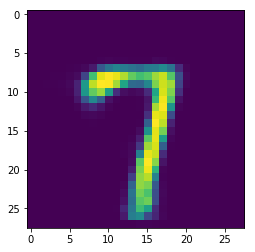

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  10



  0%|          | 1/214 [00:02<07:43,  2.18s/it]

[9 3 5 1 7 8 3 0 8 0 6 1 7 8 3 9 7 9 9 7 0 7 8 2 1 7 3 7 8 5 3 3 5 3 6 1 3
 3 7 7 0 5 0 6 2 1 0 6 4 2 2 7 8 4 0 0 6 2 8 7 8 8 4 7 6 9 6 4 5 7 8 5 9 4
 1 0 8 7 7 1 7 5 3 6 3 0 9 3 5 0 5 6 6 8 1 1 2 9 8 3 2 4 5 0 7 3 3 6 9 2 0
 5 4 6 3 9 0 1 5 1 1 7 2 7 4 3 1 7 5 1 9 3 8 0 6 1 4 9 7 5 9 9 7 1 8 9 9 0
 3 9 2 8 8 8 9 9 4 6 9 9 5 9 8 5 8 5 6 4 1 6 2 1 5 5 4 8 9 2 0 0 5 4 4 1 4
 8 3 2 1 9 7 8 6 5 6 9 7 1 6 5 2 3 6 0 9 7 3 3 9 2 0 2 2 1 5 9 9 1 2 0 4 9
 3 0 7 7 4 5 9 6 1 0 4 1 1 6 1 5 2 0 0 2 5 1 8 1 3 7 2 5 8 0 6 5 7 4]
[9 3 5 1 7 8 3 0 8 0 6 1 7 8 3 9 7 9 9 7 0 7 8 2 1 7 3 7 8 5 3 3 5 3 6 1 3
 3 7 7 0 5 0 6 2 1 0 6 4 2 2 7 8 4 0 0 6 2 8 7 8 8 4 7 6 9 6 4 5 7 8 5 9 4
 1 0 8 7 7 1 7 5 3 6 3 0 9 3 5 0 5 6 6 8 1 1 2 9 8 3 2 4 5 0 7 3 3 6 9 2 0
 5 4 6 3 9 0 1 5 1 1 7 2 7 4 3 1 7 5 1 9 3 8 0 6 1 4 9 7 5 9 9 7 1 8 9 9 0
 3 9 2 8 8 8 9 9 4 6 9 9 5 9 8 5 8 5 6 4 1 6 2 1 5 5 4 8 9 2 0 0 5 4 4 1 4
 8 3 2 1 9 7 8 6 5 6 9 7 1 6 5 2 3 6 0 9 7 3 3 9 2 0 2 2 1 5 9 9 1 2 0 4 9
 3 0 7 7 4 5 9 6 1 0 4 1 1 6 1


  1%|          | 2/214 [00:04<07:41,  2.18s/it]

[6 5 1 4 8 5 7 9 6 3 9 3 6 9 7 1 0 1 8 3 0 3 2 5 8 8 3 3 7 9 5 8 4 6 3 2 2
 7 9 9 5 7 4 1 4 2 9 6 3 2 9 9 0 4 3 1 0 5 8 2 4 4 3 9 8 9 7 6 0 6 0 1 6 5
 2 0 2 4 6 2 1 0 0 8 2 6 1 0 8 6 7 4 7 0 5 2 6 4 9 3 7 1 2 7 8 4 6 8 9 7 1
 0 1 8 6 5 5 9 4 0 5 9 7 8 8 1 0 8 7 3 9 3 9 8 6 7 4 5 5 9 1 9 9 6 1 9 0 5
 4 6 7 7 7 1 5 7 7 0 2 0 5 1 3 3 4 2 9 8 6 4 3 2 5 0 0 3 9 2 1 6 0 5 3 7 2
 0 2 9 8 4 7 1 7 8 7 1 5 2 8 6 0 0 6 4 8 5 5 6 4 3 8 0 7 2 9 4 4 7 8 1 7 7
 7 4 6 7 1 2 3 1 3 6 8 7 3 4 3 2 2 8 3 4 9 6 7 9 3 6 3 9 9 4 3 1 8 9]
[6 5 1 4 8 5 7 9 6 3 9 3 6 9 7 1 0 1 8 3 0 3 2 5 8 8 3 3 7 9 5 8 4 6 3 2 2
 7 9 9 5 7 4 1 4 2 9 6 3 2 9 9 0 4 3 1 0 5 8 2 4 4 3 9 8 9 7 6 0 6 0 1 6 5
 2 0 2 4 6 2 1 0 0 8 2 6 1 0 8 6 7 4 7 0 5 2 6 4 9 3 7 1 2 7 8 4 6 8 9 7 1
 0 1 8 6 5 5 9 4 0 5 9 7 8 8 1 0 8 7 3 9 3 9 8 6 7 4 5 5 9 1 9 9 6 1 9 0 5
 4 6 7 7 7 1 5 7 7 0 2 0 5 1 3 3 4 2 9 8 6 4 3 2 5 0 0 3 9 2 1 6 0 5 3 7 2
 0 2 9 8 4 7 1 7 8 7 1 5 2 8 6 0 0 6 4 8 5 5 6 4 3 8 0 7 2 9 4 4 7 8 1 7 7
 7 4 6 7 1 2 3 1 3 6 8 7 3 4 3


  1%|▏         | 3/214 [00:06<07:40,  2.18s/it]

[0 4 6 9 8 7 9 4 3 1 4 6 7 2 3 7 0 8 7 0 6 1 5 6 9 2 9 6 2 2 8 5 1 1 1 8 7
 0 0 8 6 0 4 0 0 0 3 1 0 4 9 1 8 7 5 1 4 5 2 0 6 7 8 3 5 1 9 7 1 3 1 5 8 5
 2 3 9 6 5 4 0 1 6 9 2 2 2 6 9 1 5 3 2 6 3 7 6 9 4 0 4 2 0 4 1 1 6 9 8 5 5
 1 6 7 9 5 7 5 0 1 3 5 1 1 3 1 0 3 9 9 6 6 0 1 1 9 3 8 8 4 2 9 3 7 4 9 8 0
 9 3 3 4 7 9 3 3 4 0 8 7 5 6 5 2 7 7 3 9 0 0 5 1 1 0 5 0 7 6 1 7 3 1 7 8 7
 6 9 8 6 9 6 4 3 0 9 8 7 3 3 1 2 8 6 7 5 1 2 6 3 4 6 0 2 3 1 0 5 7 5 3 0 3
 0 6 9 6 7 7 2 3 0 5 9 9 0 4 8 3 8 5 4 6 9 6 6 6 4 4 2 7 1 6 4 9 3 0]
[0 4 6 9 8 7 9 4 3 1 4 6 7 2 3 7 0 8 7 0 6 1 5 6 9 2 9 6 2 2 8 5 1 1 1 8 7
 0 0 8 6 0 4 0 0 0 3 1 0 4 9 1 8 7 5 1 4 5 2 0 6 7 8 3 5 1 9 7 1 3 1 5 8 5
 2 3 9 6 5 4 0 1 6 9 2 2 2 6 9 1 5 3 2 6 3 7 6 9 4 0 4 2 0 4 1 1 6 9 8 5 5
 1 6 7 9 5 7 5 0 1 3 5 1 1 3 1 0 3 9 9 6 6 0 1 1 9 3 8 8 4 2 9 3 7 4 9 8 0
 9 3 3 4 7 9 3 3 4 0 8 7 5 6 5 2 7 7 3 9 0 0 5 1 1 0 5 0 7 6 1 7 3 1 7 8 7
 6 9 8 6 9 6 4 3 0 9 8 7 3 3 1 2 8 6 7 5 1 2 6 3 4 6 0 2 3 1 0 5 7 5 3 0 3
 0 6 9 6 7 7 2 3 0 5 9 9 0 4 8


  2%|▏         | 4/214 [00:08<07:37,  2.18s/it]

[3 6 3 1 4 7 9 5 1 7 5 4 5 3 3 5 6 1 7 3 6 7 2 9 2 8 1 6 8 2 4 6 0 7 1 0 2
 8 0 3 2 5 9 2 4 8 5 2 7 0 6 1 3 3 4 1 8 5 2 5 0 3 1 6 9 2 5 5 1 0 0 3 6 1
 3 5 2 0 2 9 8 5 6 5 1 1 0 1 3 6 4 2 1 8 0 7 2 7 6 1 0 5 1 8 7 7 6 3 2 5 2
 3 9 9 9 3 7 0 7 5 4 1 9 9 7 4 7 6 3 4 7 1 9 5 2 1 3 4 0 6 9 3 2 6 2 1 4 2
 4 3 0 8 3 1 8 2 8 7 5 5 5 8 3 2 2 6 5 0 0 3 3 3 9 5 4 3 3 3 2 2 1 7 4 7 0
 3 7 9 5 8 9 7 0 7 8 9 2 8 5 5 7 1 0 7 9 3 1 2 9 9 6 9 8 7 9 5 8 3 1 7 6 4
 4 4 0 8 4 9 8 5 6 7 8 1 7 8 9 9 9 3 3 3 4 8 8 2 0 9 7 8 6 1 7 0 0 8]
[3 6 3 1 4 7 9 5 1 7 5 4 5 3 3 5 6 1 7 3 6 7 2 9 2 8 1 6 8 2 4 6 0 7 1 0 2
 8 0 3 2 5 9 2 4 8 5 2 7 0 6 1 3 3 4 1 8 5 2 5 0 3 1 6 9 2 5 5 1 0 0 3 6 1
 3 5 2 0 2 9 8 5 6 5 1 1 0 1 3 6 4 2 1 8 0 7 2 7 6 1 0 5 1 8 7 7 6 3 2 5 2
 3 9 9 9 3 7 0 7 5 4 1 9 9 7 4 7 6 3 4 7 1 9 5 2 1 3 4 0 6 9 3 2 6 2 1 4 2
 4 3 0 8 3 1 8 2 8 7 5 5 5 8 3 2 2 6 5 0 0 3 3 3 9 5 4 3 3 3 2 2 1 7 4 7 0
 3 7 9 5 8 9 7 0 7 8 9 2 8 5 5 7 1 0 7 9 3 1 2 9 9 6 9 8 7 9 5 8 3 1 7 6 4
 4 4 0 8 4 9 8 5 6 7 8 1 7 8 9


  2%|▏         | 5/214 [00:10<07:36,  2.18s/it]

[1 3 9 7 7 8 3 7 3 7 7 6 3 8 4 8 2 7 4 9 7 5 7 6 1 8 1 5 4 2 6 4 0 8 6 1 8
 7 5 3 9 2 7 5 1 8 1 3 0 2 2 9 1 8 9 5 2 7 1 6 9 2 8 9 1 9 0 6 4 1 2 6 3 6
 0 7 0 5 0 7 1 6 2 4 3 8 3 0 1 8 9 7 9 3 7 7 2 0 6 8 2 0 2 0 8 0 0 6 2 1 7
 7 2 0 3 5 1 3 8 8 3 3 7 1 4 5 2 8 8 0 3 2 4 2 8 7 0 1 9 3 0 8 8 4 0 3 9 3
 3 3 9 5 4 1 8 6 5 4 7 5 4 6 9 5 8 4 0 0 0 5 0 3 4 8 9 1 5 6 8 7 7 1 7 8 9
 2 4 6 4 0 8 7 5 7 3 6 9 1 7 3 6 8 0 8 0 7 6 1 3 8 5 3 0 7 5 7 8 8 4 7 5 5
 8 2 7 4 7 2 9 1 7 4 8 8 8 7 7 6 6 6 2 2 2 1 4 4 5 7 9 3 2 2 8 8 7 1]
[1 3 9 7 7 8 3 7 3 7 7 6 3 8 4 8 2 7 4 9 7 5 7 6 1 8 1 5 4 2 6 4 0 8 6 1 8
 7 5 3 9 2 7 5 1 8 1 3 0 2 2 9 1 8 9 5 2 7 1 6 9 2 8 9 1 9 0 6 4 1 2 6 3 6
 0 7 0 5 0 7 1 6 2 4 3 8 3 0 1 8 9 7 9 3 7 7 2 0 6 8 2 0 2 0 8 0 0 6 2 1 7
 7 2 0 3 5 1 3 8 8 3 3 7 1 4 5 2 8 8 0 3 2 4 2 8 7 0 1 9 3 0 8 8 4 0 3 9 3
 3 3 9 5 4 1 8 6 5 4 7 5 4 6 9 5 8 4 0 0 0 5 0 3 4 8 9 1 5 6 8 7 7 1 7 8 9
 2 4 6 4 0 8 7 5 7 3 6 9 1 7 3 6 8 0 8 0 7 6 1 3 8 5 3 0 7 5 7 8 8 4 7 5 5
 8 2 7 4 7 2 9 1 7 4 8 8 8 7 7


  3%|▎         | 6/214 [00:13<07:34,  2.18s/it]

[5 5 4 6 8 7 6 6 4 6 5 0 6 7 2 4 4 9 7 9 9 3 3 3 1 0 6 1 2 4 1 5 4 8 1 8 1
 9 5 4 6 5 5 3 4 0 7 8 2 8 5 0 4 4 5 1 4 1 6 8 9 6 5 0 8 5 4 8 4 9 0 2 4 5
 3 1 2 2 0 7 0 0 0 9 1 1 7 2 1 7 7 9 2 9 0 7 5 1 2 5 0 6 9 9 5 4 2 4 1 1 7
 0 7 3 3 3 7 1 7 1 0 9 8 5 5 4 3 4 8 7 6 6 5 5 8 7 6 2 1 7 8 6 6 4 8 1 5 4
 5 6 2 1 2 1 7 4 8 8 9 0 7 9 7 2 9 7 7 1 1 6 0 1 4 3 6 9 4 4 0 4 5 3 7 6 2
 3 9 3 1 7 1 4 2 9 4 2 8 9 8 3 3 2 8 9 4 3 2 9 2 7 4 0 5 3 1 9 3 9 4 2 3 6
 3 6 7 7 0 3 5 9 1 3 9 3 1 8 2 7 6 2 2 6 4 2 9 3 9 2 8 4 5 6 2 8 7 1]
[5 5 4 6 8 7 6 6 4 6 5 0 6 7 2 4 4 9 7 9 9 3 3 3 1 0 6 1 2 4 1 5 4 8 1 8 1
 9 5 4 6 5 5 3 4 0 7 8 2 8 5 0 4 4 5 1 4 1 6 8 9 6 5 0 8 5 4 8 4 9 0 2 4 5
 3 1 2 2 0 7 0 0 0 9 1 1 7 2 1 7 7 9 2 9 0 7 5 1 2 5 0 6 9 9 5 4 2 4 1 1 7
 0 7 3 3 3 7 1 7 1 0 9 8 5 5 4 3 4 8 7 6 6 5 5 8 7 6 2 1 7 8 6 6 4 8 1 5 4
 5 6 2 1 2 1 7 4 8 8 9 0 7 9 7 2 9 7 7 1 1 6 0 1 4 3 6 9 4 4 0 4 5 3 7 6 2
 3 9 3 1 7 1 4 2 9 4 2 8 9 8 3 3 2 8 9 4 3 2 9 2 7 4 0 5 3 1 9 3 9 4 2 3 6
 3 6 7 7 0 3 5 9 1 3 9 3 1 8 2


  3%|▎         | 7/214 [00:15<07:33,  2.19s/it]

[6 8 1 6 0 1 4 1 1 4 2 8 1 5 7 3 1 2 3 2 6 0 0 9 8 4 1 3 9 1 7 6 3 4 1 8 8
 6 0 5 2 9 1 6 0 7 6 0 7 9 9 6 6 3 4 7 5 2 4 4 4 2 2 0 2 8 4 3 8 6 1 4 2 4
 1 8 1 3 7 6 6 2 6 5 2 5 4 5 6 1 1 1 5 6 8 7 3 2 2 8 5 2 4 4 1 8 8 8 6 3 0
 8 3 3 1 6 1 4 1 2 5 3 2 7 1 7 2 8 7 7 0 7 1 9 3 1 5 3 1 2 5 2 1 6 5 7 1 7
 9 7 6 7 2 7 4 2 0 2 1 8 6 7 2 8 1 5 8 3 2 6 3 6 4 3 8 9 1 9 1 1 0 8 3 4 1
 8 6 1 8 3 3 9 8 0 7 1 3 4 2 8 6 9 6 0 8 7 4 0 2 1 3 3 0 3 6 3 7 1 6 8 3 3
 0 5 3 1 9 1 7 1 2 4 6 7 5 4 9 4 6 1 8 3 3 5 9 8 9 3 7 3 3 9 5 3 6 8]
[6 8 1 6 0 1 4 1 1 4 2 8 1 5 7 3 1 2 3 2 6 0 0 9 8 4 1 3 9 1 7 6 3 4 1 8 8
 6 0 5 2 9 1 6 0 7 6 0 7 9 9 6 6 3 4 7 5 2 4 4 4 2 2 0 2 8 4 3 8 6 1 4 2 4
 1 8 1 3 7 6 6 2 6 5 2 5 4 5 6 1 1 1 5 6 8 7 3 2 2 8 5 2 4 4 1 8 8 8 6 3 0
 8 3 3 1 6 1 4 1 2 5 3 2 7 1 7 2 8 7 7 0 7 1 9 3 1 5 3 1 2 5 2 1 6 5 7 1 7
 9 7 6 7 2 7 4 2 0 2 1 8 6 7 2 8 1 5 8 3 2 6 3 6 4 3 8 9 1 9 1 1 0 8 3 4 1
 8 6 1 8 3 3 9 8 0 7 1 3 4 2 8 6 9 6 0 8 7 4 0 2 1 3 3 0 3 6 3 7 1 6 8 3 3
 0 5 3 1 9 1 7 1 2 4 6 7 5 4 9


  4%|▎         | 8/214 [00:17<07:26,  2.17s/it]

[4 2 6 9 5 3 6 1 5 1 8 9 6 1 6 8 1 0 9 1 6 0 8 6 7 7 1 7 8 3 6 1 1 8 6 8 2
 0 4 6 9 6 7 4 3 6 2 6 4 5 2 6 5 0 1 0 7 9 0 7 3 4 4 9 8 3 9 9 4 6 3 3 9 0
 0 9 8 3 1 3 4 6 1 2 9 6 7 7 8 9 9 1 9 5 3 6 2 8 1 2 5 9 0 7 8 2 8 9 0 8 3
 1 7 4 9 1 0 0 2 1 2 6 9 1 1 5 5 7 6 9 3 7 0 4 4 3 3 4 9 9 8 5 1 9 1 9 2 1
 3 7 8 1 7 3 6 7 2 8 3 5 8 6 7 5 3 0 1 6 7 2 8 7 7 9 9 3 1 3 8 7 8 1 0 9 3
 5 8 6 1 7 5 0 8 6 9 6 3 1 4 2 8 2 2 7 5 5 2 8 6 1 2 4 7 5 9 4 9 5 2 2 3 6
 9 6 6 8 6 0 1 7 4 4 7 3 0 5 9 2 7 8 3 4 0 1 2 9 8 7 7 0 6 8 9 6 7 4]
[4 2 6 9 5 3 6 1 5 1 8 9 6 1 6 8 1 0 9 1 6 0 8 6 7 7 1 7 8 3 6 1 1 8 6 8 2
 0 4 6 9 6 7 4 3 6 2 6 4 5 2 6 5 0 1 0 7 9 0 7 3 4 4 9 8 3 9 9 4 6 3 3 9 0
 0 9 8 3 1 3 4 6 1 2 9 6 7 7 8 9 9 1 9 5 3 6 2 8 1 2 5 9 0 7 8 2 8 9 0 8 3
 1 7 4 9 1 0 0 2 1 2 6 9 1 1 5 5 7 6 9 3 7 0 4 4 3 3 4 9 9 8 5 1 9 1 9 2 1
 3 7 8 1 7 3 6 7 2 8 3 5 8 6 7 5 3 0 1 6 7 2 8 7 7 9 9 3 1 3 8 7 8 1 0 9 3
 5 8 6 1 7 5 0 8 6 9 6 3 1 4 2 8 2 2 7 5 5 2 8 6 1 2 4 7 5 9 4 9 5 2 2 3 6
 9 6 6 8 6 0 1 7 4 4 7 3 0 5 9


  4%|▍         | 9/214 [00:19<07:33,  2.21s/it]

[0 4 4 9 1 5 0 3 7 2 3 6 0 0 9 0 9 3 2 1 2 7 9 1 8 2 9 7 6 8 6 0 0 7 6 3 7
 9 5 0 0 5 4 8 9 6 7 0 7 9 5 0 8 2 4 9 2 2 2 6 1 8 0 2 5 6 4 6 8 2 4 3 1 8
 2 7 7 4 2 3 9 6 0 6 8 2 8 8 2 9 0 9 5 5 5 0 2 6 4 4 6 2 0 4 8 9 7 7 6 4 1
 2 3 5 1 8 3 9 9 6 5 7 9 7 6 4 6 9 6 3 1 3 2 7 2 0 1 2 5 4 0 8 0 3 5 4 3 2
 7 0 2 3 3 7 2 4 0 5 2 1 8 7 7 6 3 6 1 2 6 9 0 0 2 3 3 8 6 8 2 5 1 6 7 0 5
 7 0 9 3 8 0 0 9 0 9 3 0 4 7 5 4 5 6 8 1 6 7 0 2 8 2 0 7 9 0 7 0 1 5 1 8 5
 2 8 7 6 0 7 1 7 0 6 8 9 9 1 3 7 2 2 2 5 6 2 2 3 1 7 9 8 6 5 1 6 3 7]
[0 4 4 9 1 5 0 3 7 2 3 6 0 0 9 0 9 3 2 1 2 7 9 1 8 2 9 7 6 8 6 0 0 7 6 3 7
 9 5 0 0 5 4 8 9 6 7 0 7 9 5 0 8 2 4 9 2 2 2 6 1 8 0 2 5 6 4 6 8 2 4 3 1 8
 2 7 7 4 2 3 9 6 0 6 8 2 8 8 2 9 0 9 5 5 5 0 2 6 4 4 6 2 0 4 8 9 7 7 6 4 1
 2 3 5 1 8 3 9 9 6 5 7 9 7 6 4 6 9 6 3 1 3 2 7 2 0 1 2 5 4 0 8 0 3 5 4 3 2
 7 0 2 3 3 7 2 4 0 5 2 1 8 7 7 6 3 6 1 2 6 9 0 0 2 3 3 8 6 8 2 5 1 6 7 0 5
 7 0 9 3 8 0 0 9 0 9 3 0 4 7 5 4 5 6 8 1 6 7 0 2 8 2 0 7 9 0 7 0 1 5 1 8 5
 2 8 7 6 0 7 1 7 0 6 8 9 9 1 3


  5%|▍         | 10/214 [00:22<07:41,  2.26s/it]

[2 1 0 3 5 9 8 2 3 0 3 4 8 2 2 3 2 8 3 5 9 0 0 1 6 2 8 2 5 0 6 1 0 2 7 0 5
 4 8 3 3 1 3 9 1 1 9 8 8 2 5 5 2 1 9 0 8 1 1 8 1 4 9 2 7 5 1 1 5 6 1 5 3 6
 1 5 3 1 4 0 8 6 9 3 5 1 6 0 0 9 3 0 7 8 1 7 8 2 5 5 5 8 1 3 0 3 0 2 9 2 4
 2 6 0 6 9 3 3 6 0 6 3 6 5 9 5 4 1 3 4 2 6 3 6 6 0 7 4 5 3 9 1 7 2 5 1 5 8
 7 2 9 2 9 5 7 3 9 8 6 3 3 1 0 8 3 8 4 8 9 0 6 4 1 1 1 8 8 8 6 5 1 6 1 5 6
 6 6 1 3 0 0 9 1 9 7 0 5 1 4 2 7 0 3 6 4 7 4 4 1 2 2 3 1 9 4 1 0 9 2 1 3 9
 1 1 4 8 3 4 3 8 9 6 5 6 7 9 1 6 7 2 2 4 3 5 5 5 8 2 9 1 1 8 2 5 7 5]
[2 1 0 3 5 9 8 2 3 0 3 4 8 2 2 3 2 8 3 5 9 0 0 1 6 2 8 2 5 0 6 1 0 2 7 0 5
 4 8 3 3 1 3 9 1 1 9 8 8 2 5 5 2 1 9 0 8 1 1 8 1 4 9 2 7 5 1 1 5 6 1 5 3 6
 1 5 3 1 4 0 8 6 9 3 5 1 6 0 0 9 3 0 7 8 1 7 8 2 5 5 5 8 1 3 0 3 0 2 9 2 4
 2 6 0 6 9 3 3 6 0 6 3 6 5 9 5 4 1 3 4 2 6 3 6 6 0 7 4 5 3 9 1 7 2 5 1 5 8
 7 2 9 2 9 5 7 3 9 8 6 3 3 1 0 8 3 8 4 8 9 0 6 4 1 1 1 8 8 8 6 5 1 6 1 5 6
 6 6 1 3 0 0 9 1 9 7 0 5 1 4 2 7 0 3 6 4 7 4 4 1 2 2 3 1 9 4 1 0 9 2 1 3 9
 1 1 4 8 3 4 3 8 9 6 5 6 7 9 1


  5%|▌         | 11/214 [00:25<07:46,  2.30s/it]

[8 0 2 9 9 5 4 9 6 2 4 7 3 1 0 6 9 6 5 3 4 9 5 3 3 3 4 2 3 3 7 8 7 5 8 8 4
 9 7 0 3 0 4 6 3 5 2 0 7 2 3 1 1 6 8 2 7 1 1 9 5 5 7 9 0 1 5 8 9 3 5 2 2 7
 3 0 7 6 2 7 0 3 3 3 1 6 3 2 2 0 4 3 7 1 6 0 5 2 7 8 1 2 9 6 6 9 5 3 1 9 5
 2 6 9 2 7 0 2 6 9 2 2 8 4 9 8 7 9 7 6 0 5 7 8 6 0 5 8 3 0 8 2 7 9 9 9 3 9
 1 1 8 9 6 5 2 1 0 3 4 3 5 6 1 1 7 6 8 1 4 9 1 4 5 8 9 4 2 9 2 1 1 1 3 4 1
 5 1 6 9 8 8 3 7 1 4 7 2 4 5 7 5 8 5 1 6 1 2 5 5 9 7 4 0 0 2 3 2 9 6 2 8 0
 2 6 3 4 0 7 4 0 6 9 1 8 6 7 7 4 8 9 7 3 2 4 6 0 2 9 2 4 8 3 7 2 2 5]
[8 0 2 9 9 5 4 9 6 2 4 7 3 1 0 6 9 6 5 3 4 9 5 3 3 3 4 2 3 3 7 8 7 5 8 8 4
 9 7 0 3 0 4 6 3 5 2 0 7 2 3 1 1 6 8 2 7 1 1 9 5 5 7 9 0 1 5 8 9 3 5 2 2 7
 3 0 7 6 2 7 0 3 3 3 1 6 3 2 2 0 4 3 7 1 6 0 5 2 7 8 1 2 9 6 6 9 5 3 1 9 5
 2 6 9 2 7 0 2 6 9 2 2 8 4 9 8 7 9 7 6 0 5 7 8 6 0 5 8 3 0 8 2 7 9 9 9 3 9
 1 1 8 9 6 5 2 1 0 3 4 3 5 6 1 1 7 6 8 1 4 9 1 4 5 8 9 4 2 9 2 1 1 1 3 4 1
 5 1 6 9 8 8 3 7 1 4 7 2 4 5 7 5 8 5 1 6 1 2 5 5 9 7 4 0 0 2 3 2 9 6 2 8 0
 2 6 3 4 0 7 4 0 6 9 1 8 6 7 7


  6%|▌         | 12/214 [00:27<07:51,  2.33s/it]

[9 4 9 0 0 7 9 1 9 5 2 2 8 3 6 8 1 0 7 5 8 1 6 3 5 4 3 7 3 0 3 0 7 9 5 9 4
 6 7 9 1 9 5 1 5 3 4 9 8 2 4 5 5 0 3 3 1 2 9 2 2 0 7 3 7 4 0 8 2 5 6 9 7 7
 0 0 7 5 6 7 6 3 5 3 3 4 9 3 3 1 2 6 4 6 5 0 2 6 1 5 1 7 1 3 9 4 2 4 0 9 0
 2 1 9 3 7 0 6 8 6 1 8 5 8 2 4 3 3 8 6 0 9 2 3 2 1 0 5 1 4 8 1 2 1 5 4 9 7
 4 0 7 8 8 2 7 6 8 7 5 6 6 4 3 7 3 2 1 8 0 6 4 5 6 5 6 2 8 1 7 2 4 7 9 3 5
 0 1 9 0 2 4 0 5 3 6 9 8 6 1 9 0 2 2 8 9 9 4 7 9 5 1 3 5 2 6 3 7 1 8 3 1 2
 9 6 3 6 3 7 7 3 3 3 0 3 5 6 3 0 4 6 3 4 5 9 5 9 7 8 9 3 9 7 4 9 9 7]
[9 4 9 0 0 7 9 1 9 5 2 2 8 3 6 8 1 0 7 5 8 1 6 3 5 4 3 7 3 0 3 0 7 9 5 9 4
 6 7 9 1 9 5 1 5 3 4 9 8 2 4 5 5 0 3 3 1 2 9 2 2 0 7 3 7 4 0 8 2 5 6 9 7 7
 0 0 7 5 6 7 6 3 5 3 3 4 9 3 3 1 2 6 4 6 5 0 2 6 1 5 1 7 1 3 9 4 2 4 0 9 0
 2 1 9 3 7 0 6 8 6 1 8 5 8 2 4 3 3 8 6 0 9 2 3 2 1 0 5 1 4 8 1 2 1 5 4 9 7
 4 0 7 8 8 2 7 6 8 7 5 6 6 4 3 7 3 2 1 8 0 6 4 5 6 5 6 2 8 1 7 2 4 7 9 3 5
 0 1 9 0 2 4 0 5 3 6 9 8 6 1 9 0 2 2 8 9 9 4 7 9 5 1 3 5 2 6 3 7 1 8 3 1 2
 9 6 3 6 3 7 7 3 3 3 0 3 5 6 3


  6%|▌         | 13/214 [00:30<07:54,  2.36s/it]

[9 5 5 5 0 8 4 6 4 7 7 8 2 1 2 9 3 7 5 9 6 3 7 8 0 3 1 6 5 9 9 3 2 9 0 1 0
 8 6 1 7 7 9 1 8 4 7 9 1 7 6 4 1 6 4 4 8 3 2 4 0 8 5 7 4 5 9 1 1 6 6 5 2 7
 1 2 5 7 5 9 5 8 6 9 5 0 6 4 9 5 8 6 0 6 7 6 2 1 6 3 2 5 3 7 9 8 8 4 4 1 9
 1 0 6 4 3 9 2 1 0 2 9 7 0 7 7 9 9 3 4 0 2 7 2 5 3 6 9 0 1 7 8 7 2 1 5 5 2
 4 8 5 5 6 5 7 8 8 1 1 2 4 5 1 4 1 9 4 2 3 1 6 5 4 1 3 6 6 9 7 2 2 8 4 5 3
 9 6 4 4 1 0 5 1 2 3 7 0 4 9 2 8 5 9 0 0 6 0 3 7 9 3 5 5 2 5 1 0 4 9 3 0 6
 8 7 8 0 2 9 5 5 7 0 3 1 7 9 6 1 3 7 8 1 6 2 0 8 1 6 0 4 0 6 5 0 6 8]
[9 5 5 5 0 8 4 6 4 7 7 8 2 1 2 9 3 7 5 9 6 3 7 8 0 3 1 6 5 9 9 3 2 9 0 1 0
 8 6 1 7 7 9 1 8 4 7 9 1 7 6 4 1 6 4 4 8 3 2 4 0 8 5 7 4 5 9 1 1 6 6 5 2 7
 1 2 5 7 5 9 5 8 6 9 5 0 6 4 9 5 8 6 0 6 7 6 2 1 6 3 2 5 3 7 9 8 8 4 4 1 9
 1 0 6 4 3 9 2 1 0 2 9 7 0 7 7 9 9 3 4 0 2 7 2 5 3 6 9 0 1 7 8 7 2 1 5 5 2
 4 8 5 5 6 5 7 8 8 1 1 2 4 5 1 4 1 9 4 2 3 1 6 5 4 1 3 6 6 9 7 2 2 8 4 5 3
 9 6 4 4 1 0 5 1 2 3 7 0 4 9 2 8 5 9 0 0 6 0 3 7 9 3 5 5 2 5 1 0 4 9 3 0 6
 8 7 8 0 2 9 5 5 7 0 3 1 7 9 6


  7%|▋         | 14/214 [00:33<07:56,  2.38s/it]

[0 7 2 9 3 3 4 9 1 3 7 8 3 4 2 8 8 5 7 1 1 6 3 6 1 6 7 1 2 8 5 1 4 1 3 8 5
 1 5 2 5 4 0 9 5 8 1 1 7 1 4 9 4 7 6 9 6 5 4 8 7 5 5 0 7 3 1 1 3 3 5 3 3 9
 1 7 2 3 0 9 6 1 9 6 0 2 7 8 5 5 1 2 0 1 8 5 9 5 6 1 2 5 9 9 9 6 1 5 6 8 3
 5 9 7 9 7 8 6 3 9 0 9 4 5 7 1 2 7 3 5 1 7 1 9 4 2 5 0 5 0 4 3 3 8 9 3 5 8
 7 7 4 3 8 5 0 5 4 1 1 8 6 9 7 6 3 6 2 3 7 5 6 9 1 1 4 4 6 1 5 0 6 5 6 0 7
 0 0 7 1 1 7 5 1 9 1 4 0 0 2 6 4 7 3 4 9 6 3 2 5 2 9 7 1 9 5 0 0 7 3 3 3 8
 3 5 7 3 8 0 1 2 4 5 9 5 3 5 7 9 1 6 4 0 8 5 5 1 6 7 3 8 1 1 4 3 2 8]
[0 7 2 9 3 3 4 9 1 3 7 8 3 4 2 8 8 5 7 4 1 6 3 6 1 6 7 1 2 8 5 1 4 1 3 8 5
 1 5 2 5 4 0 9 5 8 1 1 7 1 4 9 4 7 6 9 6 5 4 8 7 5 5 0 7 3 1 1 3 3 5 3 3 9
 1 7 2 3 0 9 6 1 9 6 0 2 7 8 5 5 1 2 0 1 8 5 9 5 6 1 2 5 9 9 9 6 1 5 6 8 3
 5 9 7 9 7 8 6 3 9 0 9 4 5 7 1 2 7 3 5 1 7 1 9 4 2 5 0 5 0 4 3 3 8 9 3 5 8
 7 7 4 3 8 5 0 5 4 1 1 8 6 9 7 6 3 6 2 3 7 5 6 9 1 1 4 4 6 1 5 0 6 5 6 0 7
 0 0 7 1 1 7 5 1 9 1 4 0 0 2 6 4 7 3 4 9 6 3 2 5 2 9 7 1 9 5 0 0 7 3 3 3 8
 3 5 7 3 8 0 1 2 4 5 9 5 3 5 7


  7%|▋         | 15/214 [00:36<07:57,  2.40s/it]

[7 0 5 5 0 8 6 6 4 8 4 6 0 2 1 1 5 1 9 6 3 4 6 0 8 1 9 2 6 3 4 1 8 7 5 9 0
 5 8 1 9 4 5 0 4 8 6 3 7 1 0 3 8 8 1 0 2 5 6 1 6 5 1 7 1 4 7 8 8 0 8 4 5 0
 4 9 0 4 8 8 4 8 8 8 1 8 7 1 6 1 4 1 2 0 8 3 0 7 9 2 5 2 6 6 1 6 6 5 1 7 6
 5 3 8 0 2 8 7 3 0 4 1 4 4 6 7 0 9 8 1 1 5 6 2 1 9 2 3 8 0 2 7 2 6 9 6 2 0
 5 2 0 7 1 2 9 3 3 6 5 3 5 4 3 7 6 6 9 2 7 2 7 5 4 7 0 2 8 8 6 8 0 5 3 0 9
 3 1 7 1 7 1 6 5 5 3 6 2 2 5 0 9 2 7 8 4 8 6 9 5 5 1 8 3 5 7 5 9 7 3 5 0 7
 4 3 5 3 3 0 1 2 5 5 4 9 9 1 8 5 4 1 1 3 8 0 8 7 0 0 6 2 9 9 0 7 2 8]
[7 0 5 5 0 8 6 6 4 8 4 6 0 2 1 1 5 1 9 6 3 4 6 0 8 1 9 2 6 3 4 1 8 7 5 9 0
 5 8 1 9 4 5 0 4 8 6 3 7 1 0 3 8 8 1 0 2 5 6 1 6 5 1 7 1 4 7 8 8 0 8 4 5 0
 4 9 0 4 8 8 4 8 8 8 1 8 7 1 6 1 4 1 2 0 8 3 0 7 9 2 5 2 6 6 1 6 6 5 1 7 6
 5 3 8 0 2 8 7 3 0 4 1 4 4 6 7 0 9 8 1 1 5 6 2 1 9 2 3 8 0 2 7 2 6 9 6 2 0
 5 2 0 7 1 2 9 3 3 6 5 3 5 4 3 7 6 6 9 2 7 2 7 5 4 7 0 2 8 8 6 8 0 5 3 0 9
 3 1 7 1 7 1 6 5 5 3 6 2 2 5 0 9 2 7 8 4 8 6 9 5 5 1 8 3 5 7 5 9 7 3 5 0 7
 4 3 5 3 3 0 1 2 5 5 4 9 9 1 8


  7%|▋         | 16/214 [00:38<07:58,  2.42s/it]

[5 2 5 1 0 4 0 5 2 3 7 6 1 5 9 7 2 2 6 6 4 0 9 2 8 4 0 6 7 5 6 6 5 7 9 8 4
 6 7 1 8 6 3 7 5 1 6 7 1 8 1 8 1 3 2 1 8 0 1 1 1 6 7 1 3 1 3 6 4 6 0 2 3 9
 8 5 4 2 3 0 1 4 3 7 2 4 4 6 1 4 2 8 1 6 9 9 4 8 8 0 1 9 6 9 2 7 1 9 9 5 9
 1 6 0 9 1 7 7 1 3 7 7 4 1 1 8 6 8 8 9 9 1 2 7 1 7 9 5 0 8 3 3 4 7 4 5 4 5
 5 6 2 4 6 4 6 1 3 8 0 2 8 3 1 5 5 4 3 7 7 0 5 9 9 1 5 4 0 7 2 7 2 1 0 1 7
 8 0 5 2 8 8 3 6 0 5 9 7 8 2 2 4 4 8 4 9 8 5 5 5 6 6 2 5 7 6 8 1 3 8 3 1 2
 9 2 2 0 9 3 3 4 5 3 0 1 8 2 0 6 9 9 5 6 8 4 0 3 1 2 6 4 5 8 5 0 0 2]
[5 2 5 1 0 4 0 5 2 3 7 6 1 5 9 7 2 2 6 6 4 0 9 2 8 4 0 6 7 5 6 6 5 7 9 8 4
 6 7 1 8 6 3 7 5 1 6 7 1 8 1 8 1 3 2 1 8 0 1 1 1 6 7 1 3 1 3 6 4 6 0 2 3 9
 8 5 4 2 3 0 1 4 3 7 2 4 4 6 1 4 2 8 1 6 9 9 4 8 8 0 1 9 6 9 2 7 1 9 9 5 9
 1 6 0 9 1 7 7 1 3 7 7 4 1 1 8 6 8 8 9 9 1 2 7 1 7 9 5 0 8 3 3 4 7 4 5 4 5
 5 6 2 4 6 4 6 1 3 8 0 2 8 3 1 5 5 4 3 7 7 0 5 9 9 1 5 4 0 7 2 7 2 1 0 1 7
 8 0 5 2 8 8 3 6 0 5 9 7 8 2 2 4 4 8 4 9 8 5 5 5 6 6 2 5 7 6 8 1 3 8 3 1 2
 9 2 2 0 9 3 3 4 5 3 0 1 8 2 0


  8%|▊         | 17/214 [00:41<07:59,  2.43s/it]

[1 4 3 9 2 3 1 2 6 2 3 1 8 7 1 9 7 8 2 8 8 9 4 5 3 8 3 1 4 1 7 0 3 3 6 7 1
 7 2 4 0 9 9 5 9 8 0 9 6 8 0 8 0 9 6 4 3 6 4 9 4 7 7 6 0 0 8 2 8 9 1 0 8 9
 9 0 6 1 1 8 0 7 0 3 1 1 2 2 4 2 3 8 6 1 6 8 1 6 9 9 8 2 8 5 9 9 0 2 4 3 9
 9 7 7 9 9 4 2 8 0 4 9 1 5 7 9 5 6 8 8 9 3 1 8 7 8 2 8 8 5 5 8 1 3 5 1 1 7
 2 8 2 3 7 9 2 6 2 5 8 6 0 1 8 7 7 8 2 3 1 6 9 1 6 2 0 6 6 9 4 0 5 3 6 3 7
 9 7 4 7 0 0 6 4 4 9 5 9 8 8 3 5 0 8 6 7 3 3 1 0 9 5 7 7 8 4 4 7 0 4 9 7 0
 6 5 2 9 2 6 1 3 9 7 9 6 4 9 0 1 0 7 4 8 3 6 5 8 0 3 8 5 1 2 3 3 7 4]
[1 4 3 9 2 3 1 2 6 2 3 1 8 7 1 9 7 8 2 8 8 9 4 5 3 8 3 1 4 1 7 0 3 3 6 7 1
 7 2 4 0 9 9 5 9 8 0 9 6 8 0 8 0 9 6 4 3 6 4 9 4 7 7 6 0 0 8 2 8 9 1 0 8 9
 9 0 6 1 1 8 0 7 0 3 1 1 2 2 4 2 3 8 6 1 6 8 1 6 9 9 8 2 8 5 9 9 0 2 4 3 9
 9 7 7 9 9 4 2 8 0 4 9 1 5 7 9 5 6 8 8 9 3 1 8 7 8 2 8 8 5 5 8 1 3 5 1 1 7
 2 8 2 3 7 9 2 6 2 5 8 6 0 1 8 7 7 8 2 3 1 6 9 1 6 2 0 6 6 9 4 0 5 3 6 3 7
 9 7 4 7 0 0 6 4 4 9 5 9 8 8 3 5 0 8 6 7 3 3 1 0 9 5 7 7 8 4 4 7 0 4 9 7 0
 6 5 2 9 2 6 1 3 9 7 9 6 4 9 0


  8%|▊         | 18/214 [00:43<07:58,  2.44s/it]

[0 0 3 0 4 3 0 9 6 9 9 7 7 4 7 1 7 7 9 6 9 4 4 8 3 6 0 3 8 8 1 8 2 0 4 7 4
 8 1 7 9 8 6 1 0 3 0 6 4 1 1 4 5 8 0 9 5 4 7 0 8 3 6 9 8 7 7 1 2 8 3 2 7 3
 6 4 0 2 8 1 4 4 4 7 7 9 0 1 7 5 5 3 8 8 9 3 7 1 3 7 6 8 6 1 7 8 8 7 2 7 2
 7 9 6 9 5 4 1 3 1 8 1 5 6 4 4 6 3 3 7 1 3 6 8 2 0 9 0 5 6 9 3 8 5 7 8 1 6
 8 5 7 2 6 6 4 9 0 6 4 2 2 8 5 0 1 4 7 9 7 3 5 4 6 7 8 0 1 0 6 6 3 6 9 4 4
 8 8 1 4 8 7 0 3 4 0 5 3 3 1 0 6 0 8 4 1 4 9 1 2 2 0 3 8 6 7 0 3 1 2 6 1 9
 1 0 6 9 8 6 7 3 0 5 4 9 4 0 1 9 1 4 5 6 9 5 1 7 8 7 9 7 3 3 9 5 8 2]
[0 0 3 0 4 3 0 9 6 9 9 7 7 4 7 1 7 7 9 6 9 4 4 8 3 6 0 3 8 8 1 8 2 0 4 7 4
 8 1 7 9 8 6 1 0 3 0 6 4 1 1 4 5 8 0 9 5 4 7 0 8 3 6 9 8 7 7 1 2 8 3 2 7 3
 6 4 0 2 8 1 4 4 4 7 7 9 0 1 7 5 5 3 8 8 9 3 7 1 3 7 6 8 6 1 7 8 8 7 2 7 2
 7 9 6 9 5 4 1 3 1 8 1 5 6 4 4 6 3 3 7 1 3 6 8 2 0 9 0 5 6 9 3 8 5 7 8 1 6
 8 5 7 2 6 6 4 9 0 6 4 2 2 8 5 0 1 4 7 9 7 3 5 4 6 7 8 0 1 0 6 6 3 6 9 4 4
 8 8 1 4 8 7 0 3 4 0 5 3 3 1 0 6 0 8 4 1 4 9 1 2 2 0 3 8 6 7 0 3 1 2 6 1 9
 1 0 6 9 8 6 7 3 0 5 4 9 4 0 1


  9%|▉         | 19/214 [00:46<07:57,  2.45s/it]

[6 8 5 5 7 1 4 2 4 8 8 5 0 6 4 0 1 9 9 8 5 0 8 9 1 4 2 3 4 1 8 3 1 1 7 3 2
 9 1 2 7 0 8 7 8 2 0 7 6 9 4 0 7 3 1 4 3 2 3 2 2 5 6 5 8 3 5 1 3 6 0 3 1 5
 7 8 0 7 6 2 4 1 7 0 5 4 9 0 1 8 9 0 0 1 5 4 1 1 1 3 9 3 0 3 5 5 3 2 0 2 9
 2 5 0 8 0 3 1 8 3 8 3 2 7 2 6 0 1 0 7 3 3 4 7 3 6 9 4 9 9 4 3 8 7 2 8 5 5
 3 5 2 7 8 7 3 5 8 9 7 4 6 6 9 7 8 8 4 3 8 6 3 9 2 7 2 0 4 0 8 7 4 1 8 2 5
 6 6 3 5 8 8 6 2 2 9 4 4 1 8 8 2 5 5 2 4 3 0 9 0 1 8 6 5 7 3 5 1 9 1 5 7 1
 1 2 8 4 3 3 9 3 2 6 1 7 6 4 8 0 6 7 2 8 9 3 1 1 0 0 7 6 1 3 5 0 9 3]
[6 8 5 5 7 1 4 2 4 8 8 5 0 6 4 0 1 9 9 8 5 0 8 9 1 4 2 3 4 1 8 3 1 1 7 3 2
 9 1 2 7 0 8 7 8 2 0 7 6 9 4 0 7 3 1 4 3 2 3 2 2 5 6 5 8 3 5 1 3 6 0 3 1 5
 7 8 0 7 6 2 4 1 7 0 5 4 9 0 1 8 9 0 0 1 5 4 1 1 1 3 9 3 0 3 5 5 3 2 0 2 9
 2 5 0 8 0 3 1 8 3 8 3 2 7 2 6 0 1 0 7 3 3 4 7 3 6 9 4 9 9 4 3 8 7 2 8 5 5
 3 5 2 7 8 7 3 5 8 9 7 4 6 6 9 7 8 8 4 3 8 6 3 9 2 7 2 0 4 0 8 7 4 1 8 2 5
 6 6 3 5 8 8 6 2 2 9 4 4 1 8 8 2 5 5 2 4 3 0 9 0 1 8 6 5 7 3 5 1 9 1 5 7 1
 1 2 8 4 3 3 9 3 2 6 1 7 6 4 8


  9%|▉         | 20/214 [00:49<07:57,  2.46s/it]

[3 3 7 1 1 1 8 5 3 2 8 0 5 9 9 0 7 9 5 1 5 9 8 6 4 0 4 1 7 5 6 5 7 5 7 1 7
 4 8 3 1 4 5 8 1 5 2 3 4 6 8 8 5 8 1 5 2 6 8 3 9 0 7 3 6 0 2 9 3 6 7 3 9 1
 8 1 7 1 8 8 9 2 5 1 1 0 4 3 4 0 5 6 6 9 3 6 1 7 3 9 8 3 3 6 9 1 3 2 7 0 1
 6 6 7 8 7 4 6 9 7 5 1 2 5 4 8 7 1 3 5 3 2 6 1 4 9 4 4 0 0 1 0 8 1 7 9 7 4
 3 4 7 6 0 6 4 6 8 3 5 5 7 0 7 9 7 0 5 4 4 6 2 4 4 1 9 7 4 0 0 7 7 0 9 7 3
 8 6 1 9 3 3 5 3 9 0 2 1 3 5 2 5 0 8 9 7 9 6 3 0 5 1 0 9 6 7 2 6 0 6 4 5 1
 7 2 7 1 0 2 3 0 5 2 0 2 6 0 3 3 1 9 6 6 5 1 5 7 9 0 7 1 5 4 2 5 0 3]
[3 3 7 1 1 1 8 5 3 2 8 0 5 9 9 0 7 9 5 1 5 9 8 6 4 0 4 1 7 5 6 5 7 5 7 1 7
 4 8 3 1 4 5 8 1 5 2 3 4 6 8 8 5 8 1 5 2 6 8 3 9 0 7 3 6 0 2 9 3 6 7 3 9 1
 8 1 7 1 8 8 9 2 5 1 1 0 4 3 4 0 5 6 6 9 3 6 1 7 3 9 8 3 3 6 9 1 3 2 7 0 1
 6 6 7 8 7 4 6 9 7 5 1 2 5 4 8 7 1 3 5 3 2 6 1 4 9 4 4 0 0 1 0 8 1 7 9 7 4
 3 4 7 6 0 6 4 6 8 3 5 5 7 0 7 9 7 0 5 4 4 6 2 4 4 1 9 7 4 0 0 7 7 0 9 7 3
 8 6 1 9 3 3 5 3 9 0 2 1 3 5 2 5 0 8 9 7 9 6 3 0 5 1 0 9 6 7 2 6 0 6 4 5 1
 7 2 7 1 0 2 3 0 5 2 0 2 6 0 3


 10%|▉         | 21/214 [00:51<07:56,  2.47s/it]

[4 7 9 6 3 2 6 7 4 5 6 7 7 1 4 7 4 0 5 6 2 9 4 7 7 9 8 9 2 7 3 3 8 7 7 0 4
 4 4 0 4 4 9 9 7 0 4 7 1 0 6 5 1 2 4 3 5 7 3 3 1 1 7 1 0 8 5 2 6 1 1 3 9 6
 5 5 7 0 0 6 9 2 7 1 2 6 9 5 0 1 8 1 0 4 9 6 7 3 1 9 8 9 4 8 6 4 7 1 3 6 6
 1 8 2 7 5 4 0 4 8 4 5 6 1 1 3 5 8 5 2 0 5 2 9 8 9 7 9 8 3 5 4 3 7 2 4 6 7
 3 1 7 4 3 2 7 4 0 2 0 4 1 6 4 3 0 9 5 7 7 2 1 1 1 5 3 9 7 3 2 4 6 8 1 0 0
 9 5 1 7 1 3 9 6 7 4 0 9 3 2 5 2 3 4 4 4 0 4 3 9 3 1 2 9 2 7 7 6 1 4 3 1 3
 6 7 9 2 1 1 4 0 7 6 4 5 8 2 3 9 0 2 4 4 4 8 8 1 7 1 2 2 5 7 8 3 6 2]
[4 7 9 6 3 2 6 7 4 5 6 7 7 1 4 7 4 0 5 6 2 9 4 7 7 9 8 9 2 7 3 3 8 7 7 0 4
 4 4 0 4 4 9 9 7 0 4 7 1 0 6 5 1 2 4 3 5 7 3 3 1 1 7 1 0 8 5 2 6 1 1 3 9 6
 5 5 7 0 0 6 9 2 7 1 2 6 9 5 0 1 8 1 0 4 9 6 7 3 1 9 8 9 4 8 6 4 7 1 3 6 6
 1 8 2 7 5 4 0 4 8 4 5 6 1 1 3 5 8 5 2 0 5 2 9 8 9 7 9 8 3 5 4 3 7 2 4 6 7
 3 1 7 4 3 2 7 4 0 2 0 4 1 6 4 3 0 9 5 7 7 2 1 1 1 5 3 9 7 3 2 4 6 8 1 0 0
 9 5 1 7 1 3 9 6 7 4 0 9 3 2 5 2 3 4 4 4 0 4 3 9 3 1 2 9 2 7 7 6 1 4 3 1 3
 6 7 9 2 1 1 4 0 7 6 4 5 8 2 3


 10%|█         | 22/214 [00:54<07:56,  2.48s/it]

[5 8 4 1 4 9 7 6 8 9 4 5 7 5 5 8 1 7 3 3 1 7 9 9 8 4 2 7 4 5 5 9 3 7 4 2 2
 2 8 0 3 0 0 4 9 8 1 6 7 6 1 9 6 0 8 0 2 9 2 2 7 5 6 2 7 1 7 3 3 3 3 0 1 1
 8 0 9 5 2 1 4 2 1 4 4 3 9 5 4 5 9 4 0 5 5 6 0 9 2 5 1 8 4 6 5 6 0 0 6 9 6
 5 7 7 3 0 4 9 8 5 7 6 3 8 5 9 1 7 1 6 9 4 2 7 0 6 0 9 5 5 0 5 2 5 4 5 4 7
 4 8 3 3 7 6 5 1 4 3 4 1 0 3 5 2 9 9 8 6 5 6 4 8 9 2 2 1 3 6 2 3 6 9 5 7 8
 5 2 7 3 0 9 2 0 6 4 9 6 2 2 4 9 7 3 7 6 5 7 9 1 9 3 5 7 2 7 9 5 9 9 3 5 3
 3 6 2 9 5 2 3 2 5 1 4 3 6 7 2 9 3 2 8 2 4 5 1 4 0 5 1 6 5 2 9 0 6 7]
[5 8 4 1 4 9 7 6 8 9 4 5 7 5 5 8 1 7 3 3 1 7 9 9 8 4 2 7 4 5 5 9 3 7 4 2 2
 2 8 0 3 0 0 4 9 8 1 6 7 6 1 9 6 0 8 0 2 9 2 2 7 5 6 2 7 1 7 3 3 3 3 0 1 1
 8 0 9 5 2 1 4 2 1 4 4 3 9 5 4 5 9 4 0 5 5 6 0 9 2 5 1 8 4 6 5 6 0 0 6 9 6
 5 7 7 3 0 4 9 8 5 7 6 3 8 5 9 1 7 1 6 9 4 2 7 0 6 0 9 5 5 0 5 2 5 4 5 4 7
 4 8 3 3 7 6 5 1 4 3 4 1 0 3 5 2 9 9 8 6 5 6 4 8 9 2 2 1 3 6 2 3 6 9 5 7 8
 5 2 7 3 0 9 2 0 6 4 9 6 2 2 4 9 7 3 7 6 5 7 9 1 9 3 5 7 2 7 9 5 9 9 3 5 3
 3 6 2 9 5 2 3 2 5 1 4 3 6 7 2


 11%|█         | 23/214 [00:57<07:55,  2.49s/it]

[1 6 2 5 5 6 7 3 8 8 0 5 5 2 8 3 5 8 3 2 9 5 0 3 7 0 2 8 0 9 3 0 8 4 2 3 1
 0 6 1 4 8 0 0 9 0 4 0 7 0 0 6 7 7 6 4 9 9 7 1 5 4 4 4 1 0 9 6 5 4 8 1 3 0
 5 6 2 9 8 1 1 4 8 3 2 2 9 2 9 4 2 8 6 5 1 0 5 3 1 8 8 6 1 2 3 3 3 5 4 6 0
 7 2 6 6 0 4 5 6 2 1 4 4 6 9 8 0 3 7 1 5 4 8 9 6 8 6 4 9 5 8 8 6 0 0 7 6 5
 7 1 5 1 9 9 1 8 3 9 4 1 2 2 9 8 6 1 6 2 9 7 8 2 5 1 9 2 0 3 8 9 7 4 7 9 7
 4 6 3 2 3 0 9 3 5 8 7 7 6 1 5 9 1 4 2 1 6 1 7 8 1 1 0 5 5 3 6 7 6 2 0 3 8
 2 5 0 1 0 7 5 1 8 7 7 9 1 5 4 3 2 1 9 2 6 1 3 7 3 1 2 6 1 1 1 3 9 8]
[1 6 2 5 5 6 7 3 8 8 0 5 5 2 8 3 5 8 3 2 9 5 0 3 7 0 2 8 0 9 3 0 8 4 2 3 1
 0 6 1 4 8 0 0 9 0 4 0 7 0 0 6 7 7 6 4 9 9 7 1 5 4 4 4 1 0 9 6 5 4 8 1 3 0
 5 6 2 9 8 1 1 4 8 3 2 2 9 2 9 4 2 8 6 5 1 0 5 3 1 8 8 6 1 2 3 3 3 5 4 6 0
 7 2 6 6 0 4 5 6 2 1 4 4 6 9 8 0 3 7 1 5 4 8 9 6 8 6 4 9 5 8 8 6 0 0 7 6 5
 7 1 5 1 9 9 1 8 3 9 4 1 2 2 9 8 6 1 6 2 9 7 8 2 5 1 9 2 0 3 8 9 7 4 7 9 7
 4 6 3 2 3 0 9 3 5 8 7 7 6 1 5 9 1 4 2 1 6 1 7 8 1 1 0 5 5 3 6 7 6 2 0 3 8
 2 5 0 1 0 7 5 1 8 7 7 9 1 5 4


 11%|█         | 24/214 [00:59<07:54,  2.50s/it]

[2 7 7 6 0 5 6 2 7 3 0 0 3 5 3 5 3 0 1 0 2 1 1 7 6 3 0 4 0 3 9 4 4 5 0 7 6
 0 9 0 9 9 1 0 9 9 4 1 4 9 2 1 5 6 9 4 2 8 9 0 7 7 1 2 3 0 3 2 7 9 8 8 5 3
 5 3 8 3 4 1 5 0 4 1 0 8 3 4 9 8 1 2 4 0 8 7 8 9 3 2 1 7 7 7 0 9 7 5 5 5 4
 4 9 7 1 9 0 7 4 3 6 7 4 6 2 1 3 4 7 8 1 1 9 2 1 7 0 1 8 5 8 6 3 0 2 8 8 9
 3 0 6 6 3 9 1 3 7 8 3 3 6 3 2 7 6 1 7 1 4 9 7 5 4 1 3 9 9 1 0 6 7 7 8 9 9
 7 0 1 4 2 6 4 8 3 4 1 2 1 3 8 8 4 0 2 9 2 0 7 2 7 6 0 0 6 8 8 6 2 4 1 7 3
 5 2 6 1 5 9 2 6 5 5 0 4 4 3 6 8 6 8 4 8 3 0 2 7 5 9 9 7 3 4 6 4 3 1]
[2 7 7 6 0 5 6 2 7 3 0 0 3 5 3 5 3 0 1 0 2 1 1 7 6 3 0 4 0 3 9 4 4 5 0 7 6
 0 9 0 9 9 1 0 9 9 4 1 4 9 2 1 5 6 9 4 2 8 9 0 7 7 1 2 3 0 3 2 7 9 8 8 5 3
 5 3 8 3 4 1 5 0 4 1 0 8 3 4 9 8 1 2 4 0 8 7 8 9 3 2 1 7 7 7 0 9 7 5 5 5 4
 4 9 7 1 9 0 7 4 3 6 7 4 6 2 1 3 4 7 8 1 1 9 2 1 7 0 1 8 5 8 6 3 0 2 8 8 9
 3 0 6 6 3 9 1 3 7 8 3 3 6 3 2 7 6 1 7 1 4 9 7 5 4 1 3 9 9 1 0 6 7 7 8 9 9
 7 0 1 4 2 6 4 8 3 4 1 2 1 3 8 8 4 0 2 9 2 0 7 2 7 6 0 0 6 8 8 6 2 4 1 7 3
 5 2 6 1 5 9 2 6 5 5 0 4 4 3 6


 12%|█▏        | 25/214 [01:02<07:52,  2.50s/it]

[1 4 9 3 2 7 4 7 8 2 0 8 9 1 1 2 3 4 4 8 8 0 6 0 9 6 3 9 5 3 1 5 2 9 6 4 3
 6 4 3 8 8 9 4 9 7 3 6 1 6 2 9 7 4 9 9 6 1 4 1 3 2 2 8 9 8 7 6 7 5 6 1 3 4
 6 0 6 7 4 5 4 5 3 6 2 5 4 1 9 0 3 9 6 8 2 0 3 5 5 5 3 9 6 7 7 4 8 8 1 8 2
 6 8 3 0 3 6 4 8 1 1 9 9 0 1 8 8 7 2 9 0 4 9 6 6 8 5 3 3 4 0 5 3 1 9 3 5 4
 1 7 6 7 6 5 4 2 8 2 2 9 0 4 3 2 2 8 2 0 1 1 4 3 3 8 2 9 8 2 0 7 6 0 0 3 6
 6 8 8 0 4 2 5 9 7 2 7 6 5 8 4 0 6 0 7 7 0 4 5 2 6 8 2 9 0 9 1 9 8 3 8 1 1
 8 2 0 1 6 0 9 4 1 5 0 7 0 9 3 4 9 9 9 9 1 2 2 7 6 1 9 9 3 9 7 0 3 4]
[1 4 9 3 2 7 4 7 8 2 0 8 9 1 1 2 3 4 4 8 8 0 6 0 9 6 3 9 5 3 1 5 2 9 6 4 3
 6 4 3 8 8 9 4 9 7 3 6 1 6 2 9 7 4 9 9 6 1 4 1 3 2 2 8 9 8 7 6 7 5 6 1 3 4
 6 0 6 7 4 5 4 5 3 6 2 5 4 1 9 0 3 9 6 8 2 0 3 5 5 5 3 9 6 7 7 4 8 8 1 8 2
 6 8 3 0 3 6 4 8 1 1 9 9 0 1 8 8 7 2 9 0 4 9 6 6 8 5 3 3 4 0 5 3 1 9 3 5 4
 1 7 6 7 6 5 4 2 8 2 2 9 0 4 3 2 2 8 2 0 1 1 4 3 3 8 2 9 8 2 0 7 6 0 0 3 6
 6 8 8 0 4 2 5 9 7 2 7 6 5 8 4 0 6 0 7 7 0 4 5 2 6 8 2 9 0 9 1 9 8 3 8 1 1
 8 2 0 1 6 0 9 4 1 5 0 7 0 9 3


 12%|█▏        | 26/214 [01:05<07:51,  2.51s/it]

[7 2 8 4 8 4 3 3 8 1 8 0 8 2 1 1 6 9 4 3 4 4 6 3 1 4 9 6 0 7 5 7 1 9 1 6 1
 1 3 3 9 9 7 5 0 4 2 8 7 8 3 1 9 6 9 4 9 7 6 5 9 3 2 4 3 7 4 4 0 0 7 1 8 0
 9 6 2 3 8 1 4 7 8 6 3 7 7 4 5 0 1 3 6 6 8 3 1 9 3 3 5 6 2 3 9 6 7 4 4 6 7
 3 1 9 1 6 1 4 1 2 0 5 4 4 3 5 5 3 8 9 7 8 6 2 4 5 8 0 2 1 4 6 6 0 3 7 4 6
 6 9 2 6 6 5 1 6 7 8 9 8 7 0 0 4 2 1 2 1 7 1 8 8 5 9 6 9 7 3 5 2 4 0 6 7 2
 5 9 0 2 9 9 0 3 3 8 2 3 9 3 8 4 8 1 6 6 4 2 7 7 2 2 1 0 0 8 9 8 6 4 3 5 0
 5 2 5 6 9 3 8 6 1 0 3 8 6 0 0 7 5 0 7 5 0 1 6 9 3 3 2 4 2 9 2 1 2 5]
[7 2 8 4 8 4 3 3 8 1 8 0 8 2 1 1 6 9 4 3 4 4 6 3 1 4 9 6 0 7 5 7 1 9 1 6 1
 1 3 3 9 9 7 5 0 4 2 8 7 8 3 1 9 6 9 4 9 7 6 5 9 3 2 4 3 7 4 4 0 0 7 1 8 0
 9 6 2 3 8 1 4 7 8 6 3 7 7 4 5 0 1 3 6 6 8 3 1 9 3 3 5 6 2 3 9 6 7 4 4 6 7
 3 1 9 1 6 1 4 1 2 0 5 4 4 3 5 5 3 8 9 7 8 6 2 4 5 8 0 2 1 4 6 6 0 3 7 4 6
 6 9 2 6 6 5 1 6 7 8 9 8 7 0 0 4 2 1 2 1 7 1 8 8 5 9 6 9 7 3 5 2 4 0 6 7 2
 5 9 0 2 4 9 0 3 3 8 2 3 9 3 8 4 8 1 6 6 4 2 7 7 2 2 1 0 0 8 9 8 6 4 3 5 0
 5 2 5 6 9 3 8 6 1 0 3 8 6 0 0


 13%|█▎        | 27/214 [01:07<07:50,  2.52s/it]

[8 9 0 6 7 3 9 8 7 8 6 8 6 7 0 9 0 9 3 2 9 7 8 8 4 3 8 2 7 5 5 3 8 1 6 3 9
 3 6 6 9 6 6 4 5 0 6 3 1 6 9 3 7 9 1 3 2 1 1 4 1 2 8 0 4 1 0 0 7 3 5 6 3 5
 3 2 7 3 5 3 4 3 9 8 5 6 6 2 1 9 6 7 7 1 7 7 3 6 2 8 3 3 6 5 8 9 1 7 5 9 9
 9 4 7 4 1 8 6 9 3 5 2 9 6 3 1 2 9 0 5 1 6 9 7 4 8 6 5 7 9 5 9 5 9 2 5 5 7
 2 7 7 1 9 1 0 4 4 5 7 0 2 1 8 7 0 3 9 0 6 1 8 2 7 3 8 7 0 4 7 9 8 9 8 4 6
 2 0 3 0 2 8 3 7 3 7 0 9 3 1 5 3 7 1 5 6 8 0 6 1 0 6 7 7 7 0 2 6 3 0 9 6 6
 7 3 3 6 3 9 2 1 0 1 7 6 2 5 4 1 6 2 1 4 7 2 8 6 5 4 0 8 1 8 6 0 3 3]
[8 9 0 6 7 3 9 8 7 8 6 8 6 7 0 9 0 9 3 2 9 7 8 8 4 3 8 2 7 5 5 3 8 1 6 3 9
 3 6 6 9 6 6 4 5 0 6 3 1 6 9 3 7 9 1 3 2 1 1 4 1 2 8 0 4 1 0 0 7 3 5 6 3 5
 3 2 7 3 5 3 4 3 9 8 5 6 6 2 1 9 6 7 7 1 7 7 3 6 2 8 3 3 6 5 8 9 1 7 5 9 9
 9 4 7 4 1 8 6 9 3 5 2 9 6 3 1 2 9 0 5 1 6 9 7 4 8 6 5 7 9 5 9 5 9 2 5 5 7
 2 7 7 1 9 1 0 4 4 5 7 0 2 1 8 7 0 3 9 0 6 1 8 2 7 3 8 7 0 4 7 9 8 9 8 4 6
 2 0 3 0 2 8 3 7 3 7 0 9 3 1 5 3 7 1 5 6 8 0 6 1 0 6 7 7 7 0 2 6 3 0 9 6 6
 7 3 3 6 3 9 2 1 0 1 7 6 2 5 4


 13%|█▎        | 28/214 [01:10<07:48,  2.52s/it]

[6 5 1 9 3 6 9 4 6 3 1 9 9 4 2 3 7 6 5 5 4 1 3 1 5 8 9 4 6 7 9 2 1 7 9 9 3
 0 7 0 5 6 1 8 1 0 2 6 0 7 8 7 4 0 6 9 9 9 0 0 0 7 4 5 9 6 0 3 3 1 3 7 0 1
 9 8 5 2 7 1 8 4 1 4 1 1 4 0 6 7 0 4 3 9 6 5 6 2 7 9 3 0 1 0 4 8 7 9 4 1 0
 3 7 9 6 4 9 2 0 8 8 5 7 1 3 4 7 0 8 3 1 8 8 4 8 8 7 1 5 4 4 7 8 4 1 1 7 5
 6 3 5 7 1 8 4 3 3 3 7 2 7 7 7 9 5 9 7 6 2 6 4 0 8 0 5 2 6 5 3 0 5 4 0 7 7
 7 6 6 8 4 1 7 1 3 2 0 4 0 4 0 7 9 3 9 5 8 2 6 2 6 1 5 8 0 8 9 2 2 4 0 7 9
 5 6 4 2 8 3 3 7 6 4 2 5 0 6 0 9 2 9 1 5 4 2 6 1 2 2 9 4 2 4 0 9 0 1]
[6 5 1 9 3 6 9 4 6 3 1 9 9 4 2 3 7 6 5 5 4 1 3 1 5 8 9 4 6 7 9 2 1 7 9 9 3
 0 7 0 5 6 1 8 1 0 2 6 0 7 8 7 4 0 6 9 9 9 0 0 0 7 4 5 9 6 0 3 3 1 3 7 0 1
 9 8 5 2 7 1 8 4 1 4 1 1 4 0 6 7 0 4 3 9 6 5 6 2 7 9 3 0 1 0 4 8 7 9 4 1 0
 3 7 9 6 4 9 2 0 8 8 5 7 1 3 4 7 0 8 3 1 8 8 4 8 8 7 1 5 4 4 7 8 4 1 1 7 5
 6 3 5 7 1 8 4 3 3 3 7 2 7 7 7 9 5 9 7 6 2 6 4 0 8 0 5 2 6 5 3 0 5 4 0 7 7
 7 6 6 8 4 1 7 1 3 2 0 4 0 4 0 7 9 3 9 5 8 2 6 2 6 1 5 8 0 8 9 2 2 4 0 7 9
 5 6 4 2 8 3 3 7 6 4 2 5 0 6 0


 14%|█▎        | 29/214 [01:13<07:47,  2.53s/it]

[0 8 7 0 5 2 9 6 5 6 0 2 1 9 0 3 3 4 5 4 9 1 9 6 1 6 4 5 3 6 2 6 6 7 0 5 7
 2 5 1 2 6 0 1 0 8 9 1 5 6 7 4 7 8 5 0 1 0 0 6 4 2 1 1 7 5 9 5 0 0 5 7 4 9
 2 9 3 9 9 8 0 9 8 6 5 4 0 7 3 4 7 2 8 6 6 9 7 9 9 7 8 8 8 9 7 3 0 4 0 9 1
 5 8 3 4 1 6 9 1 8 6 9 2 6 3 1 9 7 1 4 4 3 2 8 1 4 1 4 5 4 4 1 2 3 7 2 7 2
 4 1 6 2 3 7 8 7 6 9 6 5 3 8 3 5 7 5 5 0 7 1 5 5 4 6 1 0 6 7 9 4 1 7 8 3 1
 2 1 6 7 0 4 8 7 1 3 1 9 4 6 1 3 1 5 9 8 8 4 6 8 8 8 2 6 7 5 5 6 3 7 4 6 5
 6 2 0 6 9 4 2 1 1 4 8 1 7 0 9 1 9 2 1 7 9 3 4 9 2 7 2 5 2 2 6 3 8 6]
[0 8 7 0 5 2 9 6 5 6 0 2 1 9 0 3 3 4 5 4 9 1 9 6 1 6 4 5 3 6 2 6 6 7 0 5 7
 2 5 1 2 6 0 1 0 8 9 1 5 6 7 4 7 8 5 0 1 0 0 6 4 2 1 1 7 5 9 5 0 0 5 7 4 9
 2 9 3 9 9 8 0 9 8 6 5 4 0 7 3 4 7 2 8 6 6 9 7 9 9 7 8 8 8 9 7 3 0 4 0 9 1
 5 8 3 4 1 6 9 1 8 6 9 2 6 3 1 9 7 1 4 4 3 2 8 1 4 1 4 5 4 4 1 2 3 7 2 7 2
 4 1 6 2 3 7 8 7 6 9 6 5 3 8 3 5 7 5 5 0 7 1 5 5 4 6 1 0 6 7 9 4 1 7 8 3 1
 2 1 6 7 0 4 8 7 1 3 1 9 4 6 1 3 1 5 9 8 8 4 6 8 8 8 2 6 7 5 5 6 3 7 4 6 5
 6 2 0 6 9 4 2 1 1 4 8 1 7 0 9


 14%|█▍        | 30/214 [01:15<07:45,  2.53s/it]

[6 8 8 7 5 4 0 5 5 6 6 5 9 6 2 6 7 3 8 7 6 6 5 7 8 1 9 3 2 2 7 8 1 9 2 7 2
 1 2 8 2 2 8 8 8 5 0 1 1 1 7 9 9 2 3 8 4 1 0 4 2 4 5 8 5 8 5 1 1 8 1 8 8 9
 2 1 5 0 6 3 4 9 3 6 7 3 9 6 2 6 2 6 0 9 5 2 0 0 0 3 8 5 5 9 3 1 5 5 7 7 3
 9 4 7 7 4 5 3 0 3 8 9 6 4 3 3 4 6 2 9 1 9 2 6 8 1 9 0 4 3 6 3 8 6 9 0 6 0
 7 1 0 8 7 0 3 5 2 6 8 6 1 1 0 4 5 1 2 9 9 9 7 8 4 5 1 1 5 9 5 0 5 1 6 4 3
 0 6 9 2 2 1 4 1 4 0 6 0 7 0 2 3 3 6 9 0 5 9 7 9 7 0 9 4 9 4 1 6 6 6 0 4 6
 0 7 3 4 9 1 6 9 3 6 9 8 2 5 4 2 7 3 9 3 6 2 9 0 9 0 1 8 7 8 2 0 0 5]
[6 8 8 7 5 4 0 5 5 6 6 5 9 6 2 6 7 3 8 7 6 6 5 7 8 1 9 3 2 2 7 8 1 9 2 7 2
 1 2 8 2 2 8 8 8 5 0 1 1 1 7 9 9 2 3 8 4 1 0 4 2 4 5 8 5 8 5 1 1 8 1 8 8 9
 2 1 5 0 6 3 4 9 3 6 7 3 9 6 2 6 2 6 0 9 5 2 0 0 0 3 8 5 5 9 3 1 5 5 7 7 3
 9 4 7 7 4 5 3 0 3 8 9 6 4 3 3 4 6 2 9 1 9 2 6 8 1 9 0 4 3 6 3 8 6 9 0 6 0
 7 1 0 8 7 0 3 5 2 6 8 6 1 1 0 4 5 1 2 9 9 9 7 8 4 5 1 1 5 9 5 0 5 1 6 4 3
 0 6 9 2 2 1 4 1 4 0 6 0 7 0 2 3 3 6 9 0 5 9 7 9 7 0 9 4 9 4 1 6 6 6 0 4 6
 0 7 3 4 9 1 6 9 3 6 9 8 2 5 4


 14%|█▍        | 31/214 [01:18<07:43,  2.53s/it]

[5 4 2 1 4 1 0 4 9 8 5 4 9 5 1 9 6 5 3 7 3 1 9 9 8 8 5 2 5 0 2 3 5 2 2 8 4
 0 2 1 9 0 6 5 1 7 5 3 5 1 6 5 3 7 9 1 1 5 8 0 8 9 8 7 2 2 7 8 6 9 6 7 6 0
 7 3 8 3 0 3 1 1 4 6 0 4 5 9 6 2 0 1 6 6 3 9 1 9 8 6 0 8 7 4 3 1 0 7 2 2 1
 1 4 7 1 9 2 9 5 2 5 8 9 1 1 2 3 2 5 3 7 7 4 1 1 1 3 3 8 8 1 2 8 2 8 5 9 9
 7 6 9 5 7 9 7 9 7 7 7 2 2 7 4 3 7 5 2 8 4 0 2 3 8 1 3 7 2 3 8 3 3 5 8 3 4
 1 1 3 6 1 0 9 2 3 3 9 3 2 0 1 0 2 9 4 9 4 9 6 9 2 4 3 3 9 5 3 9 2 7 5 5 2
 5 3 4 8 7 7 9 3 0 6 2 5 1 1 5 7 7 1 2 3 6 0 3 6 7 9 5 5 7 9 3 9 9 3]
[5 4 2 1 4 1 0 4 9 8 5 4 9 5 1 9 6 5 3 7 3 1 9 9 8 8 5 2 5 0 2 3 5 2 2 8 4
 0 2 1 9 0 6 5 1 7 5 3 5 1 6 5 3 7 9 1 1 5 8 0 8 9 8 7 2 2 7 8 6 9 6 7 6 0
 7 3 8 3 0 3 1 1 4 6 0 4 5 9 6 2 0 1 6 6 3 9 1 9 8 6 0 8 7 4 3 1 0 7 2 2 1
 1 4 7 1 9 2 9 5 2 5 8 9 1 1 2 3 2 5 3 7 7 4 1 1 1 3 3 8 8 1 2 8 2 8 5 9 9
 7 6 9 5 7 9 7 9 7 7 7 2 2 7 4 3 7 5 2 8 4 0 2 3 8 1 3 7 2 3 8 3 3 5 8 3 4
 7 1 3 6 1 0 9 2 3 3 9 3 2 0 1 0 2 9 4 9 4 9 6 9 2 4 3 3 9 5 3 9 2 7 5 5 2
 5 3 4 8 7 7 9 3 0 6 2 5 1 1 5


 15%|█▍        | 32/214 [01:21<07:41,  2.54s/it]

[1 0 3 8 8 8 2 7 6 3 7 8 7 7 8 1 8 5 4 6 6 8 6 3 7 9 6 3 0 7 4 1 1 4 1 3 6
 5 6 9 4 4 2 9 8 6 4 0 4 2 9 9 9 4 7 6 2 3 9 2 8 4 9 1 7 7 8 7 7 6 4 5 1 2
 7 5 1 9 3 0 7 9 1 8 7 6 6 4 5 6 3 4 3 5 4 5 1 0 3 5 9 5 9 6 9 4 5 7 6 5 5
 5 2 3 3 1 5 3 5 2 2 5 3 8 4 8 4 5 8 8 9 4 0 0 4 6 4 6 0 7 7 8 4 2 9 8 1 6
 7 6 4 9 5 3 0 0 5 7 9 5 5 6 3 7 6 2 2 0 0 1 1 9 7 5 6 0 0 4 2 9 4 6 3 2 1
 0 0 6 3 8 7 3 5 7 1 5 4 8 0 9 1 7 3 4 6 1 2 6 3 3 1 6 3 3 0 9 0 7 7 8 1 7
 1 5 1 2 3 1 5 9 7 5 4 3 3 7 2 8 9 6 2 3 1 1 1 4 3 6 7 1 8 2 7 2 3 0]
[1 0 3 8 8 8 2 7 6 3 7 8 7 7 8 1 8 5 4 6 6 8 6 3 7 9 6 3 0 7 4 1 1 4 1 3 6
 5 6 9 4 4 2 9 8 6 4 0 4 2 9 9 9 4 7 6 2 3 9 2 8 4 9 1 7 7 8 7 7 6 4 5 1 2
 7 5 1 9 3 0 7 9 1 8 7 6 6 4 5 6 3 4 3 5 4 5 1 0 3 5 9 5 9 6 9 4 5 7 6 5 5
 5 2 3 3 1 5 3 5 2 2 5 3 8 4 8 4 5 8 8 9 4 0 0 4 6 4 6 0 7 7 8 4 2 9 8 1 6
 7 6 4 9 5 3 0 0 5 7 9 5 5 6 3 7 6 2 2 0 0 1 1 9 7 5 6 0 0 4 2 9 4 6 3 2 1
 0 0 6 3 8 7 3 5 7 1 5 4 8 0 9 1 7 3 4 6 1 2 6 3 3 1 6 3 3 0 9 0 7 7 8 1 7
 1 5 1 2 3 1 5 9 7 5 4 3 3 7 2


 15%|█▌        | 33/214 [01:23<07:39,  2.54s/it]

[6 0 5 9 5 0 4 3 4 5 7 3 0 3 9 6 3 7 9 7 4 0 2 0 8 7 6 9 9 4 0 4 1 3 5 7 1
 0 3 8 7 9 6 9 3 8 3 5 1 8 9 0 5 1 4 6 5 0 7 7 6 3 4 4 5 8 9 7 2 6 5 8 0 8
 6 4 4 2 4 0 7 0 2 4 8 0 7 6 3 6 5 3 4 0 3 3 1 4 2 9 5 0 8 6 0 9 6 3 7 0 1
 4 2 3 2 5 6 2 3 9 3 0 7 8 1 8 7 1 1 9 5 1 3 4 0 4 5 9 3 3 5 1 6 3 7 0 1 6
 0 8 1 2 1 7 7 4 3 1 3 3 7 6 3 5 3 9 0 2 8 0 1 2 3 8 3 7 7 2 9 6 3 4 0 0 1
 9 0 4 8 4 6 8 0 1 8 6 7 2 2 1 5 3 7 3 3 1 0 0 5 6 1 3 7 0 3 4 4 1 1 0 7 3
 8 9 9 0 6 0 5 2 8 6 6 5 4 1 6 9 7 6 1 1 8 3 9 5 4 3 7 2 1 2 5 9 1 5]
[6 0 5 9 5 0 4 3 4 5 7 3 0 3 9 6 3 7 9 7 4 0 2 0 8 7 6 9 9 4 0 4 1 3 5 7 1
 0 3 8 7 9 6 9 3 8 3 5 1 8 9 0 5 1 4 6 5 0 7 7 6 3 4 4 5 8 9 7 2 6 5 8 0 8
 6 4 4 2 4 0 7 0 2 4 8 0 7 6 3 6 5 3 4 0 3 3 1 4 2 9 5 0 8 6 0 9 6 3 7 0 1
 4 2 3 2 5 6 2 3 9 3 0 7 8 1 8 7 1 1 9 5 1 3 4 0 4 5 9 3 3 5 1 6 3 7 0 1 6
 0 8 1 2 1 7 7 4 3 1 3 3 7 6 3 5 3 9 0 2 8 0 1 2 3 8 3 7 7 2 9 6 3 4 0 0 1
 9 0 4 8 4 6 8 0 1 8 6 7 2 2 1 5 3 7 3 3 1 0 0 5 6 1 3 7 0 3 4 4 1 1 0 7 3
 8 9 9 0 6 0 5 2 8 6 6 5 4 1 6


 16%|█▌        | 34/214 [01:26<07:37,  2.54s/it]

[8 0 7 8 1 2 0 7 8 0 9 0 7 5 2 4 7 5 2 2 8 2 6 7 3 7 2 7 9 8 8 8 5 1 7 7 6
 7 8 4 5 8 3 9 4 5 3 7 9 0 7 6 7 0 3 3 9 8 8 3 6 0 4 7 8 7 1 4 6 5 1 7 4 8
 2 9 4 7 5 6 7 2 2 8 4 2 2 6 1 8 2 5 3 1 3 7 4 3 8 0 3 1 3 8 4 4 0 3 8 5 8
 1 0 4 1 8 7 1 8 8 0 9 2 3 5 0 8 7 3 3 3 1 5 0 3 4 8 5 3 8 6 8 9 1 7 8 7 2
 1 5 5 3 0 1 7 7 1 9 3 5 4 1 7 9 6 2 2 1 1 1 0 3 6 3 0 0 7 8 6 3 4 3 8 0 7
 8 5 5 8 4 2 7 7 5 5 7 8 3 3 6 2 3 8 2 7 8 9 2 8 9 1 9 9 3 0 0 8 9 0 4 2 7
 1 4 5 7 6 1 3 4 1 6 1 5 8 6 7 7 7 3 0 0 8 8 3 7 3 9 6 9 7 7 9 8 2 2]
[8 0 7 8 1 2 0 7 8 0 9 0 7 5 2 4 7 5 2 2 8 2 6 7 3 7 2 7 9 8 8 8 5 1 7 7 6
 7 8 4 5 8 3 9 4 5 3 7 9 0 7 6 7 0 3 3 9 8 8 3 6 0 4 7 8 7 1 4 6 5 1 7 4 8
 2 9 4 7 5 6 7 2 2 8 4 2 2 6 1 8 2 5 3 1 3 7 4 3 8 0 3 1 3 8 4 4 0 3 8 5 8
 1 0 4 1 8 7 1 8 8 0 9 2 3 5 0 8 7 3 3 3 1 5 0 3 4 8 5 3 8 6 8 9 1 7 8 7 2
 1 5 5 3 0 1 7 7 1 9 3 5 4 1 7 9 6 2 2 1 1 1 0 3 6 3 0 0 7 8 6 3 4 3 8 0 7
 8 5 5 8 4 2 7 7 5 5 7 8 3 3 6 2 3 8 2 7 8 9 2 8 9 1 9 9 3 0 0 8 9 0 4 2 7
 1 4 5 7 6 1 3 4 1 6 1 5 8 6 7


 16%|█▋        | 35/214 [01:29<07:35,  2.54s/it]

[3 7 8 4 1 5 9 2 3 7 3 5 7 5 5 7 4 5 0 5 1 1 1 5 7 0 3 5 4 9 4 0 1 3 1 2 5
 3 6 4 2 2 0 5 9 8 6 7 3 6 6 3 4 4 9 9 7 1 1 9 8 3 6 1 9 1 3 9 6 2 3 1 4 6
 0 6 9 3 2 5 5 3 8 5 7 5 0 6 6 9 0 7 8 2 3 8 6 9 2 6 3 7 8 1 9 5 7 9 4 6 4
 0 8 6 1 5 0 8 7 2 1 0 3 8 9 5 3 6 3 4 8 3 0 4 0 2 2 5 5 0 2 5 6 4 0 6 4 7
 4 2 8 0 0 8 4 0 0 5 5 3 0 0 2 6 5 6 1 7 4 0 2 0 6 1 2 1 7 6 6 5 9 7 7 9 3
 1 9 8 9 1 3 1 1 3 1 3 0 5 3 3 0 2 3 3 9 4 1 0 0 9 0 0 0 2 7 7 7 7 0 2 2 1
 9 6 5 0 5 1 5 5 7 3 8 3 4 9 1 7 7 5 0 8 9 8 2 7 8 1 4 3 3 4 2 8 8 9]
[3 7 8 4 1 5 9 2 3 7 3 5 7 5 5 7 4 5 0 5 1 1 1 5 7 0 3 5 4 9 4 0 1 3 1 2 5
 3 6 4 2 2 0 5 9 8 6 7 3 6 6 3 4 4 9 9 7 1 1 9 8 3 6 1 9 1 3 9 6 2 3 1 4 6
 0 6 9 3 2 5 5 3 8 5 7 5 0 6 6 9 0 7 8 2 3 8 6 9 2 6 3 7 8 1 9 5 7 9 4 6 4
 0 8 6 1 5 0 8 7 2 1 0 3 8 9 5 3 6 3 4 8 3 0 4 0 2 2 5 5 0 2 5 6 4 0 6 4 7
 4 2 8 0 0 8 4 0 0 5 5 3 0 0 2 6 5 6 1 7 4 0 2 0 6 1 2 1 7 6 6 5 9 7 7 9 3
 1 9 8 9 1 3 1 1 3 1 3 0 5 3 3 0 2 3 3 9 4 1 0 0 9 0 0 0 2 7 7 7 7 0 2 2 1
 9 6 5 0 5 1 5 5 7 3 8 3 4 9 1


 17%|█▋        | 36/214 [01:31<07:33,  2.55s/it]

[9 9 3 9 3 8 3 3 4 8 6 8 3 1 8 3 8 4 2 2 5 4 3 0 7 1 8 9 1 1 8 7 0 3 0 8 5
 8 9 1 7 7 3 3 8 8 5 8 0 8 8 6 7 3 0 1 4 5 0 5 1 0 2 6 4 5 7 5 7 7 2 9 4 8
 0 6 3 0 3 2 3 8 0 0 1 8 8 7 6 6 6 0 7 3 7 6 3 0 4 7 3 7 0 9 8 7 0 0 4 8 2
 2 5 6 6 7 3 7 3 0 8 2 2 1 4 7 7 8 5 0 9 4 9 8 0 4 8 2 4 3 8 4 0 7 1 0 2 8
 5 9 0 9 4 7 1 1 9 3 4 9 1 7 9 1 0 7 9 3 9 7 8 4 9 9 8 5 9 6 1 7 2 7 8 3 6
 9 8 5 1 7 9 4 0 6 2 0 3 0 7 1 2 2 1 4 7 4 0 0 4 1 5 7 8 1 4 8 3 6 9 8 1 1
 9 3 3 7 5 1 4 6 9 2 4 8 6 1 6 1 8 9 4 4 5 1 1 7 5 6 3 0 2 4 0 3 5 6]
[9 9 3 9 3 8 3 3 4 8 6 8 3 1 8 3 8 4 2 2 5 4 3 0 7 1 8 9 1 1 8 7 0 3 0 8 5
 8 9 1 7 7 3 3 8 8 5 8 0 8 8 6 7 3 0 1 4 5 0 5 1 0 2 6 4 5 7 5 7 7 2 9 4 8
 0 6 3 0 3 2 3 8 0 0 1 8 8 7 6 6 6 0 7 3 7 6 3 0 4 7 3 7 0 9 8 7 0 0 4 8 2
 2 5 6 6 7 3 7 3 0 8 2 2 1 4 7 7 8 5 0 9 4 9 8 0 4 8 2 4 3 8 4 0 7 1 0 2 8
 5 9 0 9 4 7 1 1 9 3 4 9 1 7 9 1 0 7 9 3 9 7 8 4 9 9 8 5 9 6 1 7 2 7 8 3 6
 9 8 5 1 7 9 4 0 6 2 0 3 0 7 1 2 2 1 4 7 4 0 0 4 1 5 7 8 1 4 8 3 6 9 8 1 1
 9 3 3 7 5 1 4 6 9 2 4 8 6 1 6


 17%|█▋        | 37/214 [01:34<07:31,  2.55s/it]

[6 0 0 6 1 7 0 7 4 5 3 4 5 5 0 7 0 9 0 5 6 4 5 4 5 4 0 2 9 8 7 2 3 9 8 1 6
 4 9 5 9 6 2 6 5 1 8 6 9 9 1 3 2 3 1 7 4 6 7 6 7 9 4 8 4 8 9 2 8 3 5 4 7 7
 4 4 3 0 0 3 0 0 0 5 7 3 9 3 0 8 4 0 6 1 5 8 9 0 5 4 1 8 5 6 6 4 0 2 6 9 2
 0 3 9 8 8 3 4 3 4 1 0 7 4 6 0 6 1 3 0 2 5 5 2 2 5 6 9 7 8 4 1 4 2 6 6 5 1
 1 1 9 1 8 2 9 8 0 4 4 0 0 5 7 8 8 9 2 8 9 7 2 0 1 1 8 0 7 0 6 5 3 5 5 7 3
 6 4 6 5 8 2 2 0 1 0 4 3 7 1 3 8 7 5 1 7 5 2 0 3 1 2 0 8 2 3 0 6 0 6 5 3 4
 7 8 8 8 4 6 6 7 2 9 0 5 3 7 7 3 3 6 4 3 9 5 5 1 4 2 7 2 5 3 8 3 2 8]
[6 0 0 6 1 7 0 7 4 5 3 4 5 5 0 7 0 9 0 5 6 4 5 4 5 4 0 2 9 8 7 2 3 9 8 1 6
 4 9 5 9 6 2 6 5 1 8 6 9 9 1 3 2 3 1 7 4 6 7 6 7 9 4 8 4 8 9 2 8 3 5 4 7 7
 4 4 3 0 0 3 0 0 0 5 7 3 9 3 0 8 4 0 6 1 5 8 9 0 5 4 1 8 5 6 6 4 0 2 6 9 2
 0 3 9 8 8 3 4 3 4 1 0 7 4 6 0 6 1 3 0 2 5 5 2 2 5 6 9 7 8 4 1 4 2 6 6 5 1
 1 1 9 1 8 2 9 8 0 4 4 0 0 5 7 8 8 9 2 8 9 7 2 0 1 1 8 0 7 0 6 5 3 5 5 7 3
 6 4 6 5 8 2 2 0 1 0 4 3 7 1 3 8 7 5 1 7 5 2 0 3 1 2 0 8 2 3 0 6 0 6 5 3 4
 7 8 8 8 4 6 6 7 2 9 0 5 3 7 7


 18%|█▊        | 38/214 [01:36<07:28,  2.55s/it]

[0 2 3 6 5 8 6 0 3 6 1 1 9 2 2 9 3 8 2 6 3 7 2 7 3 2 6 0 3 2 9 2 3 6 1 1 8
 3 6 7 9 1 4 1 6 2 1 5 1 9 7 4 0 0 6 0 7 9 4 2 3 0 4 1 2 9 9 3 2 2 2 5 9 4
 1 8 0 0 3 7 9 9 9 7 5 8 8 8 0 5 9 8 3 8 5 3 0 2 7 1 8 1 8 0 4 5 7 1 6 4 7
 8 9 6 7 4 3 9 1 0 1 4 7 5 1 9 8 8 1 2 5 5 8 9 9 6 3 0 8 4 3 7 7 2 5 1 1 7
 1 7 5 1 5 1 7 5 5 6 4 7 9 2 1 7 9 1 7 7 9 1 3 9 4 9 5 0 0 3 7 1 8 2 3 4 0
 1 7 4 4 8 5 2 9 0 5 8 7 3 5 8 4 7 7 7 1 0 7 6 9 8 0 6 4 8 3 9 3 2 5 7 8 2
 8 8 7 8 5 6 6 3 7 5 9 3 4 2 2 0 6 5 9 2 8 3 1 9 9 5 3 0 1 3 1 3 7 2]
[0 2 3 6 5 8 6 0 3 6 1 1 9 2 2 9 3 8 2 6 3 7 2 7 3 2 6 0 3 2 9 2 3 6 1 1 8
 3 6 7 9 1 4 1 6 2 1 5 1 9 7 4 0 0 6 0 7 9 4 2 3 0 4 1 2 9 9 3 2 2 2 5 9 4
 1 8 0 0 3 7 9 9 9 7 5 8 8 8 0 5 9 8 3 8 5 3 0 2 7 1 8 1 8 0 4 5 7 1 6 4 7
 8 9 6 7 4 3 9 1 0 1 4 7 5 1 9 8 8 1 2 5 5 8 9 9 6 3 0 8 4 3 7 7 2 5 1 1 7
 1 7 5 1 5 1 7 5 5 6 4 7 9 2 1 7 9 1 7 7 9 1 3 9 4 9 5 0 0 3 7 1 8 2 3 4 0
 1 7 4 4 8 5 2 9 0 5 8 7 3 5 8 4 7 7 7 1 0 7 6 9 8 0 6 4 8 3 9 3 2 5 7 8 2
 8 8 7 8 5 6 6 3 7 5 9 3 4 2 2


 18%|█▊        | 39/214 [01:39<07:26,  2.55s/it]

[0 1 3 4 6 5 2 6 9 1 7 8 7 3 1 9 6 3 5 0 8 4 5 1 3 5 7 6 7 5 7 6 1 1 5 2 8
 6 0 8 2 4 4 5 9 4 9 4 1 2 6 8 4 2 3 9 9 1 9 7 1 9 3 3 8 9 8 3 9 2 8 5 8 7
 3 0 1 3 5 3 7 0 1 0 1 1 7 7 1 7 8 9 1 3 7 7 9 8 0 9 9 1 9 1 8 1 8 8 7 4 1
 1 3 9 7 4 9 4 1 3 4 3 1 2 8 8 0 5 2 5 2 5 2 9 1 0 2 8 6 2 5 8 7 0 3 9 4 1
 6 5 5 7 5 8 0 7 2 4 2 8 2 4 0 5 6 9 8 1 2 8 5 7 5 3 3 7 9 1 4 7 1 1 9 7 5
 3 5 0 4 8 8 8 4 9 5 2 3 6 5 2 8 3 6 4 4 6 1 0 0 9 5 8 6 0 8 9 5 9 4 8 7 5
 8 3 2 0 0 6 9 0 4 4 6 7 9 2 0 2 8 2 0 7 6 6 0 0 7 8 5 9 6 7 4 7 5 9]
[0 1 3 4 6 5 2 6 9 1 7 8 7 3 1 9 6 3 5 0 8 4 5 1 3 5 7 6 7 5 7 6 1 1 5 2 8
 6 0 8 2 4 4 5 9 4 9 4 1 2 6 8 4 2 3 9 9 1 9 7 1 9 3 3 8 9 8 3 9 2 8 5 8 7
 3 0 1 3 5 3 7 0 1 0 1 1 7 7 1 7 8 9 1 3 7 7 9 8 0 9 9 1 9 1 8 1 8 8 7 4 1
 1 3 9 7 4 9 4 1 3 4 3 1 2 8 8 0 5 2 5 2 5 2 9 1 0 2 8 6 2 5 8 7 0 3 9 4 1
 6 5 5 7 5 8 0 7 2 4 2 8 2 4 0 5 6 9 8 1 2 8 5 7 5 3 3 9 9 1 4 7 1 1 9 7 5
 3 5 0 4 8 8 8 4 9 5 2 3 6 5 2 8 3 6 4 4 6 1 0 0 9 5 8 6 0 8 9 5 9 4 8 7 5
 8 3 2 0 0 6 9 0 4 4 6 7 9 2 0


 19%|█▊        | 40/214 [01:42<07:24,  2.55s/it]

[5 6 1 2 4 8 7 3 5 4 1 8 3 4 3 4 5 9 0 5 2 7 7 6 8 5 1 6 2 0 0 6 3 6 2 2 7
 1 9 7 0 5 3 3 8 0 9 6 4 6 1 8 5 6 2 8 0 3 1 1 3 9 8 7 8 9 3 3 3 9 3 9 9 9
 8 1 2 3 7 8 7 4 2 5 8 3 0 2 3 7 2 0 2 5 9 3 8 2 8 1 4 8 9 1 6 0 9 3 4 4 8
 0 2 0 6 6 7 1 6 1 3 2 8 6 8 9 4 1 4 2 9 7 8 1 0 8 1 2 6 8 2 8 6 7 9 1 5 3
 7 8 2 3 5 0 2 4 9 6 6 6 7 9 9 2 5 7 7 8 7 8 9 6 1 3 2 8 3 9 9 3 9 4 0 8 2
 0 8 8 1 6 2 0 8 2 1 1 2 4 3 5 8 8 4 2 5 0 9 1 8 7 7 7 6 0 2 5 1 4 1 6 1 5
 5 4 9 0 8 6 2 3 3 9 9 4 4 6 7 7 1 0 7 4 4 5 2 9 7 0 1 4 0 7 8 4 3 4]
[5 6 1 2 4 8 7 3 5 4 1 8 3 4 3 4 5 9 0 5 2 7 7 6 8 5 1 6 2 0 0 6 3 6 2 2 7
 1 9 7 0 5 3 3 8 0 9 6 4 6 1 8 5 6 2 8 0 3 1 1 3 9 8 7 8 9 3 3 3 9 3 9 9 9
 8 1 2 3 7 8 7 4 2 5 8 3 0 2 3 7 2 0 2 5 9 3 8 2 8 1 4 8 9 1 6 0 9 3 4 4 8
 0 2 0 6 6 7 1 6 1 3 2 8 6 8 9 4 1 4 2 9 7 8 1 0 8 1 2 6 8 2 8 6 7 9 1 5 3
 7 8 2 3 5 0 2 4 9 6 6 6 7 9 9 2 5 7 7 8 7 8 9 6 1 3 2 8 3 9 9 3 9 4 0 8 2
 0 8 8 1 6 2 0 8 2 1 1 2 4 3 5 8 8 4 2 5 0 9 1 8 7 7 7 6 0 2 5 1 4 1 6 1 5
 5 4 9 0 8 6 2 3 3 9 9 4 4 6 7


 19%|█▉        | 41/214 [01:44<07:22,  2.56s/it]

[6 2 8 0 3 6 4 6 5 0 9 1 0 3 7 2 3 6 5 2 0 7 5 6 3 2 2 0 0 1 5 2 2 5 3 3 3
 7 7 4 2 8 6 3 4 7 4 0 4 9 7 9 9 3 1 4 3 1 5 7 1 4 2 9 0 8 9 7 2 5 4 0 1 6
 6 0 9 4 8 5 1 6 9 0 9 8 7 9 7 4 4 7 1 6 7 9 7 2 3 9 3 1 5 3 6 5 0 2 7 2 1
 3 6 1 0 2 5 3 8 1 3 7 1 4 5 1 3 5 1 2 9 5 0 9 6 8 9 7 5 2 5 8 9 8 7 0 4 9
 4 5 2 9 1 2 6 1 0 7 2 2 7 3 2 9 1 2 6 8 0 1 6 6 6 2 6 0 4 8 1 0 0 2 4 1 2
 8 5 5 6 7 7 0 5 5 7 4 9 4 1 4 1 9 6 2 0 5 8 6 0 6 6 7 2 6 3 8 6 2 8 9 3 8
 7 3 1 2 8 1 7 7 3 1 2 0 5 5 1 7 5 7 0 9 1 4 5 3 5 1 8 1 2 2 7 5 4 8]
[6 2 8 0 3 6 4 6 5 0 9 1 0 3 7 2 3 6 5 2 0 7 5 6 3 2 2 0 0 1 5 2 2 5 3 3 3
 7 7 4 2 8 6 3 4 7 4 0 4 9 7 9 9 3 1 4 3 1 5 7 1 4 2 9 0 8 9 7 2 5 4 0 1 6
 6 0 9 4 8 5 1 6 9 0 9 8 7 9 7 4 4 7 1 6 7 9 7 2 3 9 3 1 5 3 6 5 0 2 7 2 1
 3 6 1 0 2 5 3 8 1 3 7 1 4 5 1 3 5 1 2 9 5 0 9 6 8 9 7 5 2 5 8 9 8 7 0 4 9
 4 5 2 9 1 2 6 1 0 7 2 2 7 3 2 9 1 2 6 8 0 1 6 6 6 2 6 0 4 8 1 0 0 2 4 1 2
 8 5 5 6 7 7 0 5 5 7 4 9 4 1 4 1 9 6 2 0 5 8 6 0 6 6 7 2 6 3 8 6 2 8 9 3 8
 7 3 1 2 8 1 7 7 3 1 2 0 5 5 1


 20%|█▉        | 42/214 [01:47<07:19,  2.56s/it]

[0 0 4 9 4 8 3 4 0 0 1 2 0 5 8 0 3 3 6 8 1 9 6 4 5 2 4 9 4 8 3 2 1 2 8 2 7
 6 0 9 3 0 7 8 8 5 9 8 7 1 7 0 7 2 9 6 9 5 2 6 4 7 8 1 4 0 5 4 6 4 6 0 0 0
 2 2 8 9 8 6 2 3 8 8 1 2 6 5 6 5 4 6 4 2 6 3 9 3 9 2 9 8 6 7 9 1 6 8 0 3 9
 6 3 8 2 4 4 0 7 6 0 2 1 0 2 3 9 1 3 7 4 3 9 4 0 5 3 7 9 8 1 2 6 2 5 1 5 2
 7 0 6 8 0 4 0 7 3 3 9 2 6 6 9 4 3 9 6 4 8 9 2 2 8 4 0 1 5 0 1 7 0 3 7 6 6
 1 1 5 4 1 1 9 7 8 0 1 7 2 1 2 0 8 0 3 6 1 2 8 5 3 4 9 3 8 6 0 4 4 3 4 5 8
 8 8 4 3 9 9 3 0 4 6 8 3 6 1 0 0 3 3 2 7 1 4 1 2 3 7 7 0 2 6 9 9 3 6]
[0 0 4 9 4 8 3 4 0 0 1 2 0 5 8 0 3 3 6 8 1 9 6 4 5 2 4 9 4 8 3 2 1 2 8 2 7
 6 0 9 3 0 7 8 8 5 9 8 7 1 7 0 7 2 9 6 9 5 2 6 4 7 8 1 4 0 5 4 6 4 6 0 0 0
 2 2 8 9 8 6 2 3 8 8 1 2 6 5 6 5 4 6 4 2 6 3 9 3 9 2 9 8 6 7 9 1 6 8 0 3 9
 6 3 8 2 4 4 0 7 6 0 2 1 0 2 3 9 1 3 7 4 3 9 4 0 5 3 7 9 8 1 2 6 2 5 1 5 2
 7 0 6 8 0 4 0 7 3 3 9 2 6 6 9 4 3 9 6 4 8 9 2 2 8 4 0 1 5 0 1 7 0 3 7 6 6
 1 1 5 4 1 1 9 7 8 0 1 7 2 1 2 0 8 0 3 6 1 2 8 5 3 4 9 3 8 6 0 4 4 3 4 5 8
 8 8 4 3 9 9 3 0 4 6 8 3 6 1 0


 20%|██        | 43/214 [01:50<07:17,  2.56s/it]

[0 6 8 2 3 4 9 6 6 5 1 5 2 5 5 4 1 0 7 7 6 5 2 8 5 2 8 3 4 2 7 0 0 1 6 0 7
 3 5 3 7 0 0 8 0 9 2 9 9 1 5 9 9 2 6 1 3 0 5 3 8 5 4 4 7 3 0 5 8 1 8 0 0 6
 6 3 5 9 6 1 5 0 7 1 3 3 8 1 5 1 2 8 4 4 9 6 1 7 2 0 4 7 2 0 6 4 3 3 4 8 5
 3 7 8 8 8 3 6 7 6 3 1 9 7 2 2 8 8 8 0 7 5 7 4 0 4 5 4 1 8 7 2 3 8 3 8 6 1
 3 7 9 4 7 1 0 4 6 1 8 5 7 2 2 9 4 5 6 9 5 8 6 8 0 5 5 7 6 4 1 8 5 7 5 3 8
 0 4 9 8 4 2 1 5 9 4 9 4 1 5 4 6 7 9 4 0 5 0 0 8 9 8 3 4 9 7 7 0 3 0 9 8 5
 0 5 1 8 2 7 6 6 9 2 3 0 5 2 9 4 8 3 7 1 2 1 9 2 9 2 5 8 0 8 8 0 4 7]
[0 6 8 2 3 4 9 6 6 5 1 5 2 5 5 4 1 0 7 7 6 5 2 8 5 2 8 3 4 2 7 0 0 1 6 0 7
 3 5 3 7 0 0 8 0 9 2 9 9 1 5 9 9 2 6 1 3 0 5 3 8 5 4 4 7 3 0 5 8 1 8 0 0 6
 6 3 5 9 6 1 5 0 7 1 3 3 8 1 5 1 2 8 4 4 9 6 1 7 2 0 4 7 2 0 6 4 3 3 4 8 5
 3 7 8 8 8 3 6 7 6 3 1 9 7 2 2 8 8 8 0 7 5 7 4 0 4 5 4 1 8 7 2 3 8 3 8 6 1
 3 7 9 4 7 1 0 4 6 1 8 5 7 2 2 9 4 5 6 9 5 8 6 8 0 5 5 7 6 4 1 8 5 7 5 3 8
 0 4 9 8 4 2 1 5 9 4 9 4 1 5 4 6 7 9 4 0 5 0 0 8 9 8 3 4 9 7 7 0 3 0 9 8 5
 0 5 1 8 2 7 6 6 9 2 3 0 5 2 9


 21%|██        | 44/214 [01:52<07:15,  2.56s/it]

[6 3 6 6 7 8 8 8 9 2 3 1 6 9 9 1 9 0 1 6 7 0 1 1 0 5 2 6 7 6 0 1 4 4 8 0 5
 7 6 1 9 8 5 8 4 7 3 0 5 3 7 2 1 7 6 7 8 7 5 7 6 6 8 1 7 9 7 7 9 6 6 1 3 7
 8 1 8 1 1 9 1 5 7 1 8 0 0 1 0 4 5 7 5 3 3 8 6 2 5 5 4 8 2 0 8 3 2 5 1 4 3
 2 1 3 0 3 6 4 6 2 2 5 8 9 6 8 5 3 9 4 8 4 6 9 9 3 1 2 1 5 5 3 0 6 5 4 2 6
 8 6 0 3 7 7 9 0 0 5 2 6 4 3 8 0 5 4 9 4 5 1 6 2 7 9 3 7 3 5 6 3 7 1 7 7 1
 1 1 3 2 3 4 2 6 3 5 8 8 7 5 6 8 2 6 7 0 5 0 5 9 8 5 9 3 8 8 0 5 8 7 8 6 1
 9 9 5 9 0 6 4 8 9 9 5 8 6 0 7 6 9 8 1 3 2 9 4 2 5 1 7 2 2 3 7 4 1 8]
[6 3 6 6 7 8 8 8 9 2 3 1 6 9 9 1 9 0 1 6 7 0 1 1 0 5 2 6 7 6 0 1 4 4 8 0 5
 7 6 1 9 8 5 8 4 7 3 0 5 3 7 2 1 7 6 7 8 7 5 7 6 6 8 1 7 9 7 7 9 6 6 1 3 7
 8 1 8 1 1 9 1 5 7 1 8 0 0 1 0 4 5 7 5 3 3 8 6 2 5 5 4 8 2 0 8 3 2 5 1 4 3
 2 1 3 0 3 6 4 6 2 2 5 8 9 6 8 5 3 9 4 8 4 6 9 9 3 1 2 1 5 5 3 0 6 5 4 2 6
 8 6 0 3 7 7 9 0 0 5 2 6 4 3 8 0 5 4 9 4 5 1 6 2 7 9 3 7 3 5 6 3 7 1 7 7 1
 1 1 3 2 3 4 2 6 3 5 8 8 7 5 6 8 2 6 7 0 5 0 5 9 8 5 9 3 8 8 0 5 8 7 8 6 1
 9 9 5 9 0 6 4 8 9 9 5 8 6 0 7


 21%|██        | 45/214 [01:55<07:13,  2.56s/it]

[6 9 5 6 5 3 1 4 5 0 9 0 8 4 0 6 0 6 4 5 0 0 7 4 6 6 8 8 7 8 5 3 4 7 9 3 3
 5 0 5 2 2 2 0 9 6 8 9 1 7 5 4 9 4 4 1 5 6 7 9 2 7 7 8 9 7 7 8 7 0 3 7 9 8
 4 7 9 1 3 1 4 8 3 1 4 3 7 6 5 3 7 1 6 5 3 8 1 2 9 8 7 3 0 0 6 6 4 6 6 4 5
 2 9 5 5 7 3 1 6 3 3 4 9 8 4 5 1 0 7 5 1 2 7 6 0 2 3 5 4 5 2 3 4 3 2 1 4 2
 7 7 4 7 6 4 9 3 5 4 2 1 9 0 6 1 2 9 4 7 0 8 7 7 4 6 4 7 1 5 0 3 8 8 4 8 0
 4 4 6 5 4 4 6 7 4 5 4 3 5 6 8 2 2 3 7 7 0 0 7 0 7 5 6 1 5 9 3 6 7 3 9 2 1
 5 9 7 3 4 1 6 7 9 0 3 1 9 0 3 0 9 1 0 1 4 3 5 9 4 3 5 6 6 0 7 6 8 1]
[6 9 5 6 5 3 1 4 5 0 9 0 8 4 0 6 0 6 4 5 0 0 7 4 6 6 8 8 7 8 5 3 4 7 9 3 3
 5 0 5 2 2 2 0 9 6 8 9 1 7 5 4 9 4 4 1 5 6 7 9 2 7 7 8 9 7 7 8 7 0 3 7 9 8
 4 7 9 1 3 1 4 8 3 1 4 3 7 6 5 3 7 1 6 5 3 8 1 2 9 8 7 3 0 0 6 6 4 6 6 4 5
 2 9 5 5 7 3 1 6 3 3 4 9 8 4 5 1 0 7 5 1 2 7 6 0 2 3 5 4 5 2 3 4 3 2 1 4 2
 7 7 4 7 6 4 9 3 5 4 2 1 9 0 6 1 2 9 4 7 0 8 7 7 4 6 4 7 1 5 0 3 8 8 4 8 0
 4 4 6 5 4 4 6 7 4 5 4 3 5 6 8 2 2 3 7 7 0 0 7 0 7 5 6 1 5 9 3 6 7 3 9 2 1
 5 9 7 3 4 1 6 7 9 0 3 1 9 0 3


 21%|██▏       | 46/214 [01:57<07:10,  2.57s/it]

[4 2 4 9 8 5 2 4 0 7 2 6 1 8 7 4 3 3 8 4 1 5 6 4 3 2 1 3 1 1 5 0 1 0 2 1 8
 5 6 1 7 9 2 3 6 8 1 8 8 3 5 9 4 5 6 0 8 9 9 8 3 2 6 3 0 0 9 8 8 7 9 7 7 1
 9 8 1 0 9 6 8 6 0 4 3 0 1 2 4 5 2 5 1 4 8 7 2 0 8 2 2 9 6 1 7 4 7 4 3 2 7
 0 2 8 7 7 7 6 9 9 5 3 0 0 7 2 6 5 6 3 0 7 6 0 0 9 1 3 5 5 2 8 9 8 4 9 6 5
 3 9 8 5 0 9 9 6 8 7 6 4 3 1 6 6 8 1 8 1 1 2 3 9 0 0 1 7 3 6 6 0 7 4 8 1 6
 6 0 1 6 2 9 0 6 2 1 8 3 8 1 2 0 8 3 9 1 3 3 4 1 5 7 6 7 7 1 2 1 8 7 7 2 7
 2 4 3 3 3 2 5 0 5 7 1 6 6 7 2 6 7 9 9 6 8 4 1 4 2 3 2 9 8 9 9 3 4 6]
[4 2 4 9 8 5 2 4 0 7 2 6 1 8 7 4 3 3 8 4 1 5 6 4 3 2 1 3 1 1 5 0 1 0 2 1 8
 5 6 1 7 9 2 3 6 8 1 8 8 3 5 9 4 5 6 0 8 9 9 8 3 2 6 3 0 0 9 8 8 7 9 7 7 1
 9 8 1 0 9 6 8 6 0 4 3 0 1 2 4 5 2 5 1 4 8 7 2 0 8 2 2 9 6 1 7 4 7 4 3 2 7
 0 2 8 7 7 7 6 9 9 5 3 0 0 7 2 6 5 6 3 0 7 6 0 0 9 1 3 5 5 2 8 9 8 4 9 6 5
 3 9 8 5 0 9 9 6 8 7 6 4 3 1 6 6 8 1 8 1 1 2 3 9 0 0 1 7 3 6 6 0 7 4 8 1 6
 6 0 1 6 2 9 0 6 2 1 8 3 8 1 2 0 8 3 9 1 3 3 4 1 5 7 6 7 7 1 2 1 8 7 7 2 7
 2 4 3 3 3 2 5 0 5 7 1 6 6 7 2


 22%|██▏       | 47/214 [02:00<07:08,  2.57s/it]

[3 8 5 3 1 6 1 1 1 5 8 9 1 0 2 1 1 2 9 8 8 2 4 2 3 5 4 2 8 5 9 5 3 6 6 5 2
 1 9 5 9 9 1 9 1 8 9 9 3 5 4 3 6 9 0 6 3 8 8 3 8 5 0 3 1 2 4 1 6 7 0 8 0 5
 0 6 7 1 5 4 2 0 0 3 6 1 4 8 1 2 5 5 9 5 5 9 7 2 0 3 2 8 7 9 9 3 5 6 5 7 8
 3 0 8 2 8 3 7 6 2 7 3 7 0 3 4 0 7 3 7 8 1 9 1 6 4 7 6 8 6 6 0 9 9 3 6 9 1
 6 0 2 9 7 8 8 9 6 4 5 1 3 0 7 4 3 9 8 4 5 6 6 1 8 0 6 8 4 9 7 8 6 3 5 4 6
 9 6 2 8 2 2 0 0 6 2 6 6 9 3 1 1 6 1 3 9 0 1 2 2 7 3 9 7 8 5 8 8 3 1 8 0 4
 4 8 7 7 1 8 7 6 6 3 7 4 5 7 2 6 4 8 2 6 0 4 9 2 9 5 3 9 9 5 7 2 1 4]
[3 8 5 3 1 6 1 1 1 5 8 9 1 0 2 1 1 2 9 8 8 2 4 2 3 5 4 2 8 5 9 5 3 6 6 5 2
 1 9 5 9 9 1 9 1 8 9 9 3 5 4 3 6 9 0 6 3 8 8 3 8 5 0 3 1 2 4 1 6 7 0 8 0 5
 0 6 7 1 5 4 2 0 0 3 6 1 4 8 1 2 5 5 9 5 5 9 7 2 0 3 2 8 7 9 9 3 5 6 5 7 8
 3 0 8 2 8 3 7 6 2 7 3 7 0 3 4 0 7 3 7 8 1 9 1 6 4 7 6 8 6 6 0 9 9 3 6 9 1
 6 0 2 9 7 8 8 9 6 4 5 1 3 0 7 4 3 9 8 4 5 6 6 1 8 0 6 8 4 9 7 8 6 3 5 4 6
 9 6 2 8 2 2 0 0 6 2 6 6 9 3 1 1 6 1 3 9 0 1 2 2 7 3 9 7 8 5 8 8 3 1 8 0 4
 4 8 7 7 1 8 7 6 6 3 7 4 5 7 2


 22%|██▏       | 48/214 [02:03<07:06,  2.57s/it]

[8 9 2 7 5 7 3 3 0 6 0 2 7 3 9 5 9 1 8 9 7 9 0 4 5 6 5 7 2 3 7 6 0 6 8 2 6
 9 5 0 2 4 0 8 1 1 4 3 2 6 3 8 3 2 9 3 0 3 1 6 0 6 9 6 5 7 4 1 3 8 9 3 5 9
 8 2 9 6 0 5 7 0 1 8 5 7 6 1 1 2 7 4 1 1 4 1 5 5 5 1 0 7 4 2 7 6 5 7 4 8 0
 5 8 3 0 2 0 5 7 2 3 0 7 8 6 8 3 8 9 2 0 0 7 9 4 1 5 5 6 5 4 9 0 8 4 9 8 5
 8 6 0 1 6 1 2 4 5 4 8 9 4 5 9 5 8 2 5 0 4 7 2 9 1 4 0 1 3 0 2 8 1 5 4 1 2
 9 9 9 3 5 3 0 6 8 8 6 3 5 7 4 7 9 7 7 4 4 4 3 2 5 8 5 2 5 7 1 0 5 1 4 8 6
 2 7 9 0 9 4 5 0 0 2 0 8 8 3 2 6 1 6 6 2 7 7 2 7 2 7 1 5 3 1 9 8 9 3]
[8 9 2 7 5 7 3 3 0 6 0 2 7 3 9 5 9 1 8 9 7 9 0 4 5 6 5 7 2 3 7 6 0 6 8 2 6
 9 5 0 2 4 0 8 1 1 4 3 2 6 3 8 3 2 9 3 0 3 1 6 0 6 9 6 5 7 4 1 3 8 9 3 5 9
 8 2 9 6 0 5 7 0 1 8 5 7 6 1 1 2 7 4 1 1 4 1 5 5 5 1 0 7 4 2 7 6 5 7 4 8 0
 5 8 3 0 2 0 5 7 2 3 0 7 8 6 8 3 8 9 2 0 0 7 9 4 1 5 5 6 5 4 9 0 8 4 9 8 5
 8 6 0 1 6 1 2 4 5 4 8 9 4 5 9 5 8 2 5 0 4 7 2 9 1 4 0 1 3 0 2 8 1 5 4 1 2
 9 9 9 3 5 3 0 6 8 8 6 3 5 7 4 7 9 7 7 4 4 4 3 2 5 8 5 2 5 7 1 0 5 1 4 8 6
 2 7 9 0 9 4 5 0 0 2 0 8 8 3 2


 23%|██▎       | 49/214 [02:05<07:04,  2.57s/it]

[5 0 1 0 8 1 0 0 8 0 5 6 1 0 3 7 1 2 4 9 3 1 1 6 9 5 5 9 6 6 0 7 7 6 1 1 3
 0 5 4 7 1 8 1 2 9 7 3 4 8 3 3 6 0 1 4 4 0 2 2 1 4 4 0 3 2 7 8 2 8 9 1 6 0
 9 9 2 4 3 4 6 8 3 6 3 8 3 4 4 0 7 9 2 1 9 7 9 3 0 1 3 2 1 3 3 1 4 2 7 1 4
 1 2 0 4 6 1 6 6 2 1 6 6 1 8 6 3 4 0 5 5 1 5 9 1 0 1 3 8 6 6 4 1 0 3 5 2 3
 8 4 4 6 7 0 4 9 0 5 2 5 2 4 1 3 1 5 7 8 6 8 3 1 4 9 5 3 1 4 8 1 3 2 1 1 1
 3 4 1 8 5 8 2 4 0 2 3 3 1 7 4 5 4 6 3 9 3 6 1 3 5 1 4 8 1 1 9 5 6 2 8 2 2
 0 8 8 2 3 1 9 9 0 5 3 4 0 7 9 0 7 7 1 6 7 6 0 2 0 3 2 5 4 8 3 9 1 1]
[5 0 1 0 8 1 0 0 8 0 5 6 1 0 3 7 1 2 4 9 3 1 1 6 9 5 5 9 6 6 0 7 7 6 1 1 3
 0 5 4 7 1 8 1 2 9 7 3 4 8 3 3 6 0 1 4 4 0 2 2 1 4 4 0 3 2 7 8 2 8 9 1 6 0
 9 9 2 4 3 4 6 8 3 6 3 8 3 4 4 0 7 9 2 1 9 7 9 3 0 1 3 2 1 3 3 1 4 2 7 1 4
 1 2 0 4 6 1 6 6 2 1 6 6 1 8 6 3 4 0 5 5 1 5 9 1 0 1 3 8 6 6 4 1 0 3 5 2 3
 8 4 4 6 7 0 4 9 0 5 2 5 2 4 1 3 1 5 7 8 6 8 3 1 4 9 5 3 1 4 8 1 3 2 1 1 1
 3 4 1 8 5 8 2 4 0 2 3 3 1 7 4 5 4 6 3 9 3 6 1 3 5 1 4 8 1 1 9 5 6 2 8 2 2
 0 8 8 2 3 1 9 9 0 5 3 4 0 7 9


 23%|██▎       | 50/214 [02:08<07:01,  2.57s/it]

[6 5 5 4 9 0 7 1 2 5 2 7 3 9 8 2 3 0 8 5 8 4 7 8 0 9 2 6 6 3 7 7 2 3 2 2 8
 5 0 6 6 7 0 1 8 7 7 8 6 1 7 3 1 8 0 3 4 2 0 9 0 0 1 5 4 5 7 9 8 6 0 6 8 9
 4 2 5 1 4 9 9 7 0 6 4 0 9 2 3 1 7 1 2 3 4 8 1 1 0 7 6 0 4 2 3 3 4 4 0 8 2
 5 6 4 8 5 0 1 6 9 2 6 5 2 0 6 3 2 1 4 0 9 6 6 0 2 9 0 4 1 8 6 5 2 8 2 6 2
 1 0 9 6 6 9 6 4 3 5 5 8 4 4 6 8 0 6 7 5 3 7 1 6 6 4 2 2 3 5 4 6 5 1 1 4 9
 2 7 3 2 2 3 3 1 4 4 3 5 0 5 3 5 5 0 2 5 5 4 6 4 1 2 4 5 0 3 0 1 0 8 4 4 5
 5 4 8 5 2 6 8 7 3 2 9 0 8 4 1 0 4 4 3 8 7 9 2 5 5 2 1 9 7 4 6 4 7 3]
[6 5 5 4 9 0 7 1 2 5 2 7 3 9 8 2 3 0 8 5 8 4 7 8 0 9 2 6 6 3 7 7 2 3 2 2 8
 5 0 6 6 7 0 1 8 7 7 8 6 1 7 3 1 8 0 3 4 2 0 9 0 0 1 5 4 5 7 9 8 6 0 6 8 9
 4 2 5 1 4 9 9 7 0 6 4 0 9 2 3 1 7 1 2 3 4 8 1 1 0 7 6 0 4 2 3 3 4 4 0 8 2
 5 6 4 8 5 0 1 6 9 2 6 5 2 0 6 3 2 1 4 0 9 6 6 0 2 9 0 4 1 8 6 5 2 8 2 6 2
 1 0 9 6 6 9 6 4 3 5 5 8 4 4 6 8 0 6 7 5 3 7 1 6 6 4 2 2 3 5 4 6 5 1 1 4 9
 2 7 3 2 2 3 3 1 4 4 3 5 0 5 3 5 5 0 2 5 5 4 6 4 1 2 4 5 0 3 0 1 0 8 4 4 5
 5 4 8 5 2 6 8 7 3 2 9 0 8 4 1


 24%|██▍       | 51/214 [02:11<06:59,  2.57s/it]

[0 2 2 2 0 3 3 4 6 2 6 5 5 9 7 7 6 4 2 7 2 7 3 7 4 6 7 2 7 6 3 0 2 1 7 1 4
 4 6 0 2 1 8 0 6 3 5 1 0 6 3 0 9 4 6 7 1 1 9 5 1 6 9 5 1 5 9 3 1 9 4 7 6 6
 1 7 0 5 1 0 9 9 6 8 0 2 7 4 1 9 5 2 0 5 2 9 6 3 0 1 4 1 7 9 4 4 2 4 5 2 8
 1 3 6 3 7 1 3 5 2 2 6 9 7 5 3 1 9 3 2 0 9 8 7 1 1 9 6 4 1 1 2 9 8 5 6 8 6
 9 2 2 0 7 4 2 8 0 3 5 1 1 3 2 6 8 5 2 2 4 7 1 2 6 8 1 1 5 9 7 8 2 2 2 5 5
 3 8 5 1 2 2 1 8 0 5 3 4 0 9 7 8 8 2 1 3 8 5 6 8 8 8 1 4 1 7 4 7 1 9 5 8 7
 3 2 7 3 3 2 0 8 8 8 1 5 5 3 4 8 1 6 6 5 9 0 5 8 4 8 7 8 3 1 8 7 8 7]
[0 2 2 2 0 3 3 4 6 2 6 5 5 9 7 7 6 4 2 7 2 7 3 7 4 6 7 2 7 6 3 0 2 1 7 1 4
 4 6 0 2 1 8 0 6 3 5 1 0 6 3 0 9 4 6 7 1 1 9 5 1 6 9 5 1 5 9 3 1 9 4 7 6 6
 1 7 0 5 1 0 9 9 6 8 0 2 7 4 1 9 5 2 0 5 2 9 6 3 0 1 4 1 7 9 4 4 2 4 5 2 8
 1 3 6 3 7 1 3 5 2 2 6 9 7 5 3 1 9 3 2 0 9 8 7 1 1 9 6 4 1 1 2 9 8 5 6 8 6
 9 2 2 0 7 4 2 8 0 3 5 1 1 3 2 6 8 5 2 2 4 7 1 2 6 8 1 1 5 9 7 8 2 2 2 5 5
 3 8 5 1 2 2 1 8 0 5 3 4 0 9 7 8 8 2 1 3 8 5 6 8 8 8 1 4 1 7 4 7 1 9 5 8 7
 3 2 7 3 3 2 0 8 8 8 1 5 5 3 4


 24%|██▍       | 52/214 [02:13<06:57,  2.58s/it]

[4 7 9 5 2 5 9 6 8 3 2 6 3 8 0 4 7 4 6 0 1 4 1 6 8 9 3 8 6 4 7 5 6 2 2 7 7
 6 9 7 3 3 8 4 0 5 0 1 8 9 9 5 4 7 1 7 9 0 4 0 0 6 0 8 2 0 1 1 6 2 8 5 1 0
 6 2 1 3 1 0 9 3 3 5 6 9 6 0 3 7 9 8 2 6 2 8 5 3 2 0 3 3 9 4 6 5 2 0 3 0 3
 2 0 6 8 3 0 2 5 1 5 0 4 2 5 9 5 0 1 7 6 1 5 1 0 6 3 1 2 2 6 3 6 9 1 3 2 3
 7 7 3 2 4 0 7 0 8 3 8 7 9 4 3 8 9 2 2 4 7 6 4 5 5 1 8 5 7 9 1 9 0 5 6 8 7
 1 5 8 6 3 9 7 2 0 5 2 7 6 2 2 7 1 1 0 0 3 0 6 0 0 9 9 5 5 7 6 9 9 0 0 1 0
 1 4 3 7 0 0 4 0 4 3 2 6 4 9 6 2 8 3 2 6 6 8 3 4 2 2 4 1 4 8 9 2 4 1]
[4 7 9 5 2 5 9 6 8 3 2 6 3 8 0 4 7 4 6 0 1 4 1 6 8 9 3 8 6 4 7 5 6 2 2 7 7
 6 9 7 3 3 8 4 0 5 0 1 8 9 9 5 4 7 1 7 9 0 4 0 0 6 0 8 2 0 1 1 6 2 8 5 1 0
 6 2 1 3 1 0 9 3 3 5 6 9 6 0 3 7 9 8 2 6 2 8 5 3 2 0 3 3 9 4 6 5 2 0 3 0 3
 2 0 6 8 3 0 2 5 1 5 0 4 2 5 9 5 0 1 7 6 1 5 1 0 6 3 1 2 2 6 3 6 9 1 3 2 3
 7 7 3 2 4 0 7 0 8 3 8 7 9 4 3 8 3 2 2 4 7 6 4 5 5 1 8 5 7 9 1 9 0 5 6 8 7
 1 5 8 6 3 9 7 2 0 5 2 7 6 2 2 7 1 1 0 0 3 0 6 0 0 9 9 5 5 7 6 9 9 0 0 1 0
 1 4 3 7 0 0 4 0 4 3 2 6 4 9 6


 25%|██▍       | 53/214 [02:16<06:54,  2.58s/it]

[8 6 7 5 8 9 3 1 9 0 3 6 0 1 4 7 7 4 2 7 1 1 1 8 3 5 1 7 1 5 4 1 3 7 2 1 7
 9 5 0 0 2 5 2 1 5 4 3 8 7 4 2 1 7 1 3 7 7 5 6 3 5 0 7 6 1 9 9 2 1 6 3 3 4
 8 7 5 8 5 4 8 2 7 5 7 7 7 8 3 0 7 0 8 2 1 3 9 4 1 7 4 9 8 2 3 5 0 8 9 4 0
 3 8 5 4 2 9 0 4 6 4 0 0 5 2 9 0 0 3 7 1 8 5 7 1 0 4 9 6 2 7 0 9 2 8 7 1 1
 0 3 4 9 6 1 4 1 3 4 4 9 5 6 2 9 0 8 3 5 7 4 5 2 8 0 5 8 4 4 2 8 4 6 9 7 8
 9 3 0 0 8 4 6 6 3 9 2 9 0 2 6 4 8 9 2 2 6 0 1 8 0 6 2 5 9 1 3 2 1 3 8 0 8
 5 8 6 0 7 4 3 3 9 9 4 5 1 1 5 6 9 1 8 9 7 3 1 5 9 5 0 7 4 7 4 0 5 6]
[8 6 7 5 8 9 3 1 9 0 3 6 0 1 4 7 7 4 2 7 1 1 1 8 3 5 1 7 1 5 4 1 3 7 2 1 7
 9 5 0 0 2 5 2 1 5 4 3 8 7 4 2 1 7 1 3 7 7 5 6 3 5 0 7 6 1 9 9 2 1 6 3 3 4
 8 7 5 8 5 4 8 2 7 5 7 7 7 8 3 0 7 0 8 2 1 3 9 4 1 7 4 9 8 2 3 5 0 8 9 4 0
 3 8 5 4 2 9 0 4 6 4 0 0 5 2 9 0 0 3 7 1 8 5 7 1 0 4 9 6 2 7 0 9 2 8 7 1 1
 0 3 4 9 6 1 4 1 3 4 4 9 5 6 2 9 0 8 3 5 7 4 5 2 8 0 5 8 4 4 2 8 4 6 9 7 8
 9 3 0 0 8 4 6 6 3 9 2 9 0 2 6 4 8 9 2 2 6 0 1 8 0 6 2 5 9 1 3 2 1 3 8 0 8
 5 8 6 0 7 4 3 3 9 9 4 5 1 1 5


 25%|██▌       | 54/214 [02:19<06:52,  2.58s/it]

[4 4 3 0 7 3 6 5 6 6 9 5 8 8 3 4 7 0 3 2 0 4 9 2 2 5 1 5 9 7 1 6 8 6 9 3 4
 2 5 5 5 9 3 7 8 4 1 1 9 3 2 4 3 6 4 3 3 9 1 0 6 1 6 1 4 2 9 1 9 5 2 7 1 4
 6 8 4 2 5 5 2 0 8 0 9 8 6 4 9 1 5 3 2 1 2 6 0 3 9 0 1 3 8 4 9 5 1 1 2 1 4
 3 5 3 9 9 5 3 9 0 4 9 0 0 5 7 5 8 7 0 6 2 4 7 0 1 3 2 9 6 0 5 9 7 5 9 8 8
 5 5 7 2 7 7 3 0 1 0 5 9 7 3 1 9 0 8 2 3 8 4 8 1 8 9 7 0 1 2 7 4 1 9 1 4 8
 6 9 1 6 9 3 9 8 7 0 3 8 3 8 6 2 8 9 3 4 1 7 1 7 1 7 2 3 8 4 6 1 4 5 1 9 3
 0 0 9 5 4 3 6 9 7 5 7 6 8 7 7 9 3 2 0 4 6 4 9 2 7 3 2 3 3 2 7 2 4 9]
[4 4 3 0 7 3 6 5 6 6 9 5 8 8 3 4 7 0 3 2 0 4 9 2 2 5 1 5 9 7 1 6 8 6 9 3 4
 2 5 5 5 9 3 7 8 4 1 1 9 3 2 4 3 6 4 3 3 9 1 0 6 1 6 1 4 2 9 1 9 5 2 7 1 4
 6 8 4 2 5 5 2 0 8 0 9 8 6 4 9 1 5 3 2 1 2 6 0 3 9 0 1 3 8 4 9 5 1 1 2 1 4
 3 5 3 9 9 5 3 9 0 4 9 0 0 5 7 5 8 7 0 6 2 4 7 0 1 3 2 9 6 0 5 9 7 5 9 8 8
 5 5 7 2 7 7 3 0 1 0 5 9 7 3 1 9 0 8 2 3 8 4 8 1 8 9 7 0 1 2 7 4 1 9 1 4 8
 6 9 1 6 9 3 9 8 7 0 3 8 3 8 6 2 8 9 3 4 1 7 1 7 1 7 2 3 8 4 6 1 4 5 1 9 3
 0 0 9 5 4 3 6 9 7 5 7 6 8 7 7


 26%|██▌       | 55/214 [02:21<06:50,  2.58s/it]

[6 7 9 0 1 6 0 6 8 8 4 0 9 2 3 9 5 6 9 4 6 6 7 7 3 4 8 0 8 3 2 8 5 1 6 7 2
 0 4 1 8 9 3 2 8 3 8 9 9 0 7 3 7 3 3 6 9 1 2 6 9 9 5 3 5 1 3 5 0 7 1 2 2 9
 7 2 6 2 6 0 2 1 0 6 8 6 0 1 3 4 0 2 4 0 9 3 4 6 3 5 7 3 6 3 2 6 3 4 1 4 3
 4 6 9 1 9 4 1 5 9 4 8 7 2 0 6 9 7 0 1 3 5 7 8 5 5 4 1 7 9 5 7 1 1 8 6 5 5
 8 1 4 5 0 3 4 8 9 6 4 1 9 5 4 0 1 0 5 6 4 2 5 1 3 9 9 0 1 3 2 6 2 8 8 1 2
 5 9 8 3 7 3 2 6 8 0 7 4 3 9 5 7 5 6 1 0 7 6 8 3 7 0 6 7 8 7 0 8 6 6 8 8 4
 6 8 7 6 4 6 2 7 0 1 5 0 9 5 1 2 0 5 6 5 7 9 5 9 1 4 3 4 1 2 1 2 3 1]
[6 7 9 0 1 6 0 6 8 8 4 0 9 2 3 9 5 6 9 4 6 6 7 7 3 4 8 0 8 3 2 8 5 1 6 7 2
 0 4 1 8 9 3 2 8 3 8 9 9 0 7 3 7 3 3 6 9 1 2 6 9 9 5 3 5 1 3 5 0 7 1 2 2 9
 7 2 6 2 6 0 2 1 0 6 8 6 0 1 3 4 0 2 4 0 9 3 4 6 3 5 7 3 6 3 2 6 3 4 1 4 3
 4 6 9 1 9 4 1 5 9 4 8 7 2 0 6 9 7 0 1 3 5 7 8 5 5 4 1 7 9 5 7 1 1 8 6 5 5
 8 1 4 5 0 3 4 8 9 6 4 1 9 5 4 0 1 0 5 6 4 2 5 1 3 9 9 0 1 3 2 6 2 8 8 1 2
 5 9 8 3 7 3 2 6 8 0 7 4 3 9 5 7 5 6 1 0 7 6 8 3 7 0 6 7 8 7 0 8 6 6 8 8 4
 6 8 7 6 4 6 2 7 0 1 5 0 9 5 1


 26%|██▌       | 56/214 [02:24<06:48,  2.58s/it]

[8 0 8 3 9 3 2 8 1 3 6 0 3 5 2 8 9 4 1 5 2 5 4 7 7 7 6 3 1 9 6 7 0 7 1 3 7
 4 2 8 8 9 0 6 3 7 9 0 9 2 8 9 7 0 0 7 6 3 5 7 9 0 7 9 4 3 3 4 7 4 1 7 4 2
 9 3 8 1 7 4 6 8 8 1 8 4 8 2 3 3 9 7 4 0 1 0 1 1 7 1 7 0 2 5 3 4 5 7 6 0 3
 6 1 8 1 2 4 0 1 8 5 9 6 3 0 5 3 6 3 4 7 1 4 1 0 5 3 1 2 9 3 1 1 7 4 5 3 2
 1 7 9 4 0 3 1 5 9 1 5 1 3 0 4 3 1 2 0 9 1 2 1 7 5 7 2 3 3 3 7 1 6 6 1 7 5
 1 3 9 3 5 5 8 3 7 0 2 5 3 7 5 3 6 3 3 0 2 6 9 0 6 7 0 4 9 3 6 0 4 2 2 5 6
 8 9 0 2 8 2 9 9 6 1 1 9 3 1 1 0 6 5 6 8 7 7 0 8 2 3 2 3 7 6 2 5 3 6]
[8 0 8 3 9 3 2 8 1 3 6 0 3 5 2 8 9 4 1 5 2 5 4 7 7 7 6 3 1 9 6 7 0 7 1 3 7
 4 2 8 8 9 0 6 3 7 9 0 9 2 8 9 7 0 0 7 6 3 5 7 9 0 7 9 4 3 3 4 7 4 1 7 4 2
 9 3 8 1 7 4 6 8 8 1 8 4 8 2 3 3 9 7 4 0 1 0 1 1 7 1 4 0 2 5 3 4 5 7 6 0 3
 6 1 8 1 2 4 0 1 8 5 9 6 3 0 5 3 6 3 4 7 1 4 1 0 5 3 1 2 9 3 1 1 7 4 5 3 2
 1 7 9 4 0 3 1 5 9 1 5 1 3 0 4 3 1 2 0 9 1 2 1 7 5 7 2 3 3 3 7 1 6 6 1 7 5
 1 3 9 3 5 5 8 3 7 0 2 5 3 7 5 3 6 3 3 0 2 6 9 0 6 7 0 4 9 3 6 0 4 2 2 5 6
 8 9 0 2 8 2 9 9 6 1 1 9 3 1 1


 27%|██▋       | 57/214 [02:27<06:45,  2.58s/it]

[7 1 8 7 3 9 4 7 4 1 2 4 1 6 7 4 8 7 9 1 2 4 2 0 9 0 7 8 4 0 4 5 5 5 3 3 3
 1 6 0 8 5 1 7 0 0 3 4 1 6 6 8 0 9 1 7 1 3 3 7 0 5 3 9 6 5 3 0 8 4 4 1 4 2
 6 3 4 5 8 2 7 7 5 6 4 3 0 1 5 1 3 5 9 4 9 4 4 3 5 1 1 2 4 2 6 5 7 7 8 9 6
 0 9 6 5 9 3 0 4 7 5 5 8 3 0 3 6 1 5 2 3 9 5 5 7 2 1 8 4 6 0 6 5 8 9 1 9 8
 8 7 8 4 1 8 3 7 7 1 3 1 6 5 6 7 6 1 0 9 4 9 6 6 4 6 8 3 4 1 3 9 3 7 4 9 4
 4 7 6 9 3 4 8 5 6 8 3 7 8 3 3 9 7 7 6 7 2 9 5 1 1 9 6 3 1 4 6 7 4 8 5 9 0
 7 9 7 1 4 7 7 3 8 2 0 1 4 9 3 0 9 7 8 1 0 3 5 6 8 8 0 7 4 0 2 7 1 2]
[7 1 8 7 3 9 4 7 4 1 2 4 1 6 7 4 8 7 9 1 2 4 2 0 9 0 7 8 4 0 4 5 5 5 3 3 3
 1 6 0 8 5 1 7 0 0 3 4 1 6 6 8 0 9 1 7 1 3 3 7 0 5 3 9 6 5 3 0 8 4 4 1 4 2
 6 3 4 5 8 2 7 7 5 6 4 3 0 1 5 1 3 5 9 4 9 4 4 3 5 1 1 2 4 2 6 5 7 7 8 9 6
 0 9 6 5 9 3 0 4 7 5 5 8 3 0 3 6 1 5 2 3 9 5 5 7 2 1 8 4 6 0 6 5 8 9 1 9 8
 8 7 8 4 1 8 3 7 7 1 3 1 6 5 6 7 6 1 0 9 4 9 6 6 4 6 8 3 4 1 3 9 3 7 4 9 4
 4 7 6 9 3 4 8 5 6 8 3 7 8 3 3 9 7 7 6 7 2 9 5 1 1 9 6 3 1 4 6 7 4 8 5 9 0
 7 9 7 1 4 7 7 3 8 2 0 1 4 9 3


 27%|██▋       | 58/214 [02:29<06:43,  2.58s/it]

[6 0 7 0 9 6 9 6 8 7 6 3 6 5 8 9 9 2 6 8 7 1 5 7 9 4 0 2 1 7 8 0 5 4 4 9 2
 7 3 1 4 7 9 2 1 4 1 4 6 3 9 1 4 5 0 0 2 6 5 8 8 7 1 1 0 9 6 1 6 3 6 4 2 2
 2 2 9 4 4 9 2 2 3 0 3 3 9 4 7 0 3 9 6 3 7 1 1 1 4 6 7 4 0 1 4 0 2 9 0 8 1
 7 5 0 4 1 6 9 2 8 7 2 3 2 2 6 6 7 8 9 7 2 5 4 5 7 6 8 6 7 2 9 2 8 4 4 4 2
 3 2 9 5 1 0 2 1 0 2 0 0 2 5 2 4 2 2 7 3 2 5 6 0 6 8 3 9 0 6 5 6 7 9 0 0 8
 7 8 5 6 9 4 7 0 0 2 8 0 2 7 4 9 2 5 6 2 4 7 4 5 5 1 6 5 8 7 5 9 8 0 6 9 4
 4 4 3 8 4 5 1 5 3 5 2 8 6 4 4 4 8 6 8 3 9 4 5 7 9 1 9 2 0 9 9 8 2 2]
[6 0 7 0 9 6 9 6 8 7 6 3 6 5 8 9 9 2 6 8 7 1 5 7 9 4 0 2 1 7 8 0 5 4 4 9 2
 9 3 1 4 7 9 2 1 4 1 4 6 3 9 1 4 5 0 0 2 6 5 8 8 7 1 1 0 9 6 1 6 3 6 4 2 2
 2 2 9 4 4 9 2 2 3 0 3 3 9 4 7 0 3 9 6 3 7 1 1 1 4 6 7 4 0 1 4 0 2 9 0 8 1
 7 5 0 4 1 6 9 2 8 7 2 3 2 2 6 6 7 8 9 7 2 5 4 5 7 6 8 6 7 2 9 2 8 4 4 4 2
 3 2 9 5 1 0 2 1 0 2 0 0 2 5 2 4 2 2 7 3 2 5 6 0 6 8 3 9 0 6 5 6 7 9 0 0 8
 7 8 5 6 9 4 7 0 0 2 8 0 2 7 4 9 2 5 6 2 4 7 4 5 5 1 6 5 8 7 5 9 8 0 6 9 4
 4 4 3 8 4 5 1 5 3 5 2 8 6 4 4


 28%|██▊       | 59/214 [02:32<06:40,  2.59s/it]

[7 3 8 1 8 9 8 1 0 4 1 8 8 1 4 0 7 1 6 2 7 8 6 2 7 1 5 4 7 2 1 0 2 3 1 9 0
 8 6 3 4 0 6 7 1 1 1 1 7 1 0 8 6 6 3 1 5 0 6 3 8 8 9 9 4 7 6 2 5 2 2 4 2 9
 8 1 1 8 3 3 0 2 3 3 9 2 1 4 3 2 0 7 7 5 0 2 0 9 3 6 4 2 5 8 5 3 0 3 8 4 5
 3 1 7 4 8 5 1 9 4 7 4 0 5 3 6 6 5 4 3 8 2 4 7 1 0 1 6 3 7 5 1 7 6 3 5 3 0
 0 7 2 1 1 1 0 9 6 2 9 5 1 9 0 9 8 2 5 9 7 9 0 1 0 9 1 4 4 5 3 0 1 1 7 2 1
 8 7 7 1 2 6 0 8 2 9 6 8 3 6 1 8 8 9 0 8 7 6 5 2 5 0 1 5 8 1 3 0 8 1 7 1 9
 4 3 4 7 0 7 2 8 7 9 6 0 4 7 8 5 4 8 7 0 5 8 3 5 9 3 2 5 6 7 6 6 9 4]
[7 3 8 1 8 9 8 1 0 4 1 8 8 1 4 0 7 1 6 2 7 8 6 2 7 1 5 4 7 2 1 0 2 3 1 9 0
 8 6 3 4 0 6 7 1 1 1 1 7 1 0 8 6 6 3 1 5 0 6 3 8 8 9 9 4 7 6 2 5 2 2 4 2 9
 8 1 1 8 3 3 0 2 3 3 9 2 1 4 3 2 0 7 7 5 0 2 0 9 3 6 4 2 5 8 5 3 0 3 8 4 5
 3 1 7 4 8 5 1 9 4 7 4 0 5 3 6 6 5 4 3 8 2 4 7 1 0 1 6 3 7 5 1 7 6 3 5 3 0
 0 7 2 1 1 1 0 9 6 2 9 5 1 9 0 9 8 2 5 9 7 9 0 1 0 9 1 4 4 5 3 0 1 1 7 2 1
 8 7 7 1 2 6 0 8 2 9 6 8 3 6 1 8 8 9 0 8 7 6 5 2 5 0 1 5 8 1 3 0 8 1 7 1 9
 4 3 4 7 0 7 2 8 7 9 6 0 4 7 8


 28%|██▊       | 60/214 [02:35<06:38,  2.59s/it]

[2 5 0 3 6 0 6 9 6 8 8 6 9 7 1 1 8 0 5 8 0 1 4 1 6 8 0 1 2 2 7 2 8 0 6 9 9
 4 3 3 7 5 8 3 1 7 0 9 5 8 4 8 3 6 6 1 8 6 6 8 1 4 5 0 2 1 9 3 1 5 6 3 7 8
 9 6 3 8 7 3 1 9 1 8 9 5 5 6 4 7 1 1 7 7 8 0 5 9 2 5 9 5 2 6 8 9 7 3 3 9 3
 8 0 0 7 3 5 1 3 8 8 0 5 9 4 5 2 0 4 7 4 2 6 0 4 3 8 0 5 3 1 2 7 4 1 6 9 4
 6 7 0 4 1 8 7 4 9 6 5 6 6 5 1 8 7 6 1 7 6 7 1 8 9 4 1 1 9 1 6 5 9 6 4 2 1
 5 5 9 9 1 4 0 9 4 3 8 2 9 6 8 1 6 8 4 8 9 7 4 4 1 1 8 7 9 7 9 9 0 8 0 2 6
 4 3 3 3 1 7 7 5 4 6 7 6 2 5 1 7 2 2 9 5 0 7 3 3 1 7 8 6 7 6 6 9 7 9]
[2 5 0 3 6 0 6 9 6 8 8 6 9 7 1 1 8 0 5 8 0 1 4 1 6 8 0 1 2 2 7 2 8 0 6 9 9
 4 3 3 7 5 8 3 1 7 0 9 5 8 4 8 3 6 6 1 8 6 6 8 1 4 5 0 2 1 9 3 1 5 6 3 7 8
 9 6 3 8 7 3 1 9 1 8 9 5 5 6 4 7 1 1 7 7 8 0 5 9 2 5 9 5 2 6 8 9 7 3 3 9 3
 8 0 0 7 3 5 1 3 8 8 0 5 9 4 5 2 0 4 7 4 2 6 0 4 3 8 0 5 3 1 2 7 4 1 6 9 4
 6 7 0 4 1 8 7 4 9 6 5 6 6 5 1 8 7 6 1 7 6 7 1 8 9 4 1 1 9 1 6 5 9 6 4 2 1
 5 5 9 9 1 4 0 9 4 3 8 2 9 6 8 1 6 8 4 8 9 7 4 4 1 1 8 7 9 7 9 9 0 8 0 2 6
 4 3 3 3 1 7 7 5 4 6 7 6 2 5 1


 29%|██▊       | 61/214 [02:37<06:35,  2.59s/it]

[6 8 9 7 1 6 6 6 1 5 3 5 4 3 1 9 8 4 3 8 3 5 0 7 1 5 2 4 3 2 8 9 0 2 6 4 4
 7 1 4 7 9 3 0 2 5 3 2 4 1 1 0 2 7 4 2 5 4 8 4 4 1 0 2 3 9 6 7 5 1 2 6 8 7
 3 4 7 7 8 2 5 3 1 7 9 0 5 6 1 1 1 3 7 4 7 3 5 6 0 0 0 5 4 7 5 6 2 8 0 0 4
 0 7 5 1 8 8 4 7 3 2 4 5 8 1 7 7 5 5 4 1 2 5 0 3 8 6 4 8 7 9 0 2 9 6 8 1 2
 4 7 1 2 2 6 1 7 9 2 1 3 1 0 7 9 1 0 2 4 2 5 0 6 6 9 8 6 3 1 6 8 9 6 5 1 2
 0 5 1 1 6 5 9 2 9 3 4 6 1 5 4 2 5 5 2 6 1 4 4 1 1 1 0 4 0 2 2 8 0 3 7 1 2
 2 0 7 1 2 3 4 9 4 8 8 9 2 5 4 8 9 0 7 7 2 6 6 2 1 1 5 1 0 8 9 0 2 7]
[6 8 9 7 1 6 6 6 1 5 3 5 4 3 1 9 8 4 3 8 3 5 0 7 1 5 2 4 3 2 8 9 0 2 6 4 4
 7 1 4 7 9 3 0 2 5 3 2 4 1 1 0 2 7 4 2 5 4 8 4 4 1 0 2 3 9 6 7 5 1 2 6 8 7
 3 4 7 7 8 2 5 3 1 7 9 0 5 6 1 1 1 3 7 4 7 3 5 6 0 0 0 5 4 7 5 6 2 8 0 0 4
 0 7 5 1 8 8 4 7 3 2 4 5 8 1 7 7 5 5 4 1 2 5 0 3 8 6 4 8 7 9 0 2 9 6 8 1 2
 4 7 1 2 2 6 1 7 9 2 1 3 1 0 7 9 1 0 2 4 2 5 0 6 6 9 8 6 3 1 6 8 9 6 5 1 2
 0 5 1 1 6 5 9 2 9 3 4 6 1 5 4 2 5 5 2 6 1 4 4 1 1 1 0 4 0 2 2 8 0 3 7 1 2
 2 0 7 1 2 3 4 9 4 8 8 9 2 5 4


 29%|██▉       | 62/214 [02:40<06:33,  2.59s/it]

[7 6 2 1 4 4 8 8 0 7 3 4 7 1 5 2 1 2 0 5 0 5 8 8 4 8 4 4 7 8 0 5 7 0 2 0 6
 0 4 7 5 3 2 1 4 7 8 1 3 8 9 3 2 3 9 2 0 1 9 9 0 0 0 9 4 9 5 7 7 4 4 9 7 8
 2 9 9 8 7 7 7 2 4 3 1 5 8 9 0 1 9 1 9 0 8 8 9 6 2 6 9 0 1 5 2 3 2 5 9 3 3
 5 7 8 2 6 3 6 9 7 9 6 7 8 3 8 4 9 5 0 5 1 1 9 6 8 6 1 8 7 9 1 3 4 1 9 3 4
 5 4 0 1 9 9 4 4 0 9 6 5 7 9 2 2 9 9 0 7 1 9 3 2 3 8 1 9 1 4 6 1 3 1 7 1 6
 2 8 4 3 0 2 1 4 2 1 0 2 2 7 1 7 1 6 5 3 8 6 8 7 4 8 1 3 2 8 6 8 9 9 9 2 0
 6 7 2 1 0 4 4 1 2 0 1 8 4 4 0 1 5 0 8 9 1 1 4 7 0 8 7 5 6 0 0 0 2 1]
[7 6 2 1 4 4 8 8 0 7 3 4 7 1 5 2 1 2 0 5 0 5 8 8 4 8 4 4 7 8 0 5 7 0 2 0 6
 0 4 7 5 3 2 1 4 7 8 1 3 8 9 3 2 3 9 2 0 1 7 9 0 0 0 9 4 9 5 7 7 4 4 9 7 8
 2 9 9 8 7 7 7 2 4 3 1 5 8 9 0 1 9 1 9 0 8 8 9 6 2 6 9 0 1 5 2 3 2 5 9 3 3
 5 7 8 2 6 3 6 9 7 9 6 7 8 3 8 4 9 5 0 5 1 1 9 6 8 6 1 8 7 9 1 3 4 1 9 3 4
 5 4 0 1 9 9 4 4 0 9 6 5 7 9 2 2 9 9 0 7 1 9 3 2 3 8 1 9 1 4 6 1 3 1 7 1 6
 2 8 4 3 0 2 1 4 2 1 0 2 2 7 1 7 1 6 5 3 8 6 8 7 4 8 1 3 2 8 6 8 9 9 9 2 0
 6 7 2 1 0 4 4 1 2 0 1 8 4 4 0


 29%|██▉       | 63/214 [02:43<06:31,  2.59s/it]

[9 0 0 3 9 0 3 2 9 5 3 8 7 9 3 6 2 3 2 9 8 8 9 4 6 7 5 7 8 7 4 5 0 3 0 7 3
 4 5 7 2 7 5 3 3 4 8 5 9 7 1 0 5 0 9 0 8 4 3 2 3 8 1 9 3 4 2 1 7 9 3 9 1 8
 9 8 0 8 8 8 5 4 1 3 8 6 2 6 3 1 1 0 1 4 6 1 8 7 0 4 2 6 1 5 3 9 8 2 0 4 4
 5 4 9 0 3 1 8 2 5 3 3 5 0 3 3 5 5 3 3 8 7 4 4 7 5 1 3 6 5 6 0 1 5 3 6 8 2
 1 9 1 3 7 0 4 7 3 4 1 2 8 0 0 2 4 4 1 7 3 2 2 8 9 0 3 9 0 3 3 1 4 8 1 7 7
 1 8 5 1 7 5 4 3 4 1 1 0 6 3 7 5 9 0 7 9 8 4 2 7 7 6 6 9 3 5 6 0 0 5 2 4 0
 3 9 3 5 8 6 4 7 2 4 4 5 2 8 4 5 7 5 3 7 7 7 4 2 5 4 1 8 8 6 2 2 2 5]
[9 0 0 3 9 0 3 2 9 5 3 8 7 9 3 6 2 3 2 9 8 8 9 4 6 7 5 7 8 7 4 5 0 3 0 7 3
 4 5 7 2 7 5 3 3 4 8 5 9 7 1 0 5 0 9 0 8 4 3 2 3 8 1 9 3 4 2 1 7 9 3 9 1 8
 9 8 0 8 8 8 5 4 1 3 8 6 2 6 3 1 1 0 1 4 6 1 8 7 0 4 2 6 1 5 3 9 8 2 0 4 4
 5 4 9 0 3 1 8 2 5 3 3 5 0 3 3 5 5 3 3 8 7 4 4 7 5 1 3 6 5 6 0 1 5 3 6 8 2
 1 9 1 3 7 0 4 7 3 4 1 2 8 0 0 2 4 4 1 7 3 2 2 8 9 0 3 9 0 3 3 1 4 8 1 7 7
 1 8 5 1 7 5 4 3 4 1 1 0 6 3 7 5 9 0 7 9 8 4 2 7 7 6 6 9 3 5 6 0 0 5 2 4 0
 3 9 3 5 8 6 4 7 2 4 4 5 2 8 4


 30%|██▉       | 64/214 [02:45<06:28,  2.59s/it]

[7 6 4 0 4 7 1 7 3 8 3 6 5 8 1 7 2 0 7 7 7 3 2 1 5 0 8 7 1 7 3 8 4 1 7 7 1
 4 4 3 6 3 6 8 6 1 8 2 5 4 5 6 2 8 1 3 6 0 2 1 6 9 6 1 7 9 8 8 2 9 6 1 1 2
 3 9 7 6 0 4 6 4 1 9 6 6 3 1 0 5 9 3 1 8 8 8 4 7 4 3 3 2 1 5 4 2 8 0 0 2 0
 7 6 7 7 5 1 1 5 1 2 6 4 3 3 6 7 9 7 2 6 4 8 9 1 4 6 2 2 4 3 8 3 5 6 2 7 1
 6 4 6 5 5 7 8 0 2 3 3 9 5 7 6 8 7 3 2 4 2 3 7 7 8 2 8 6 0 0 9 9 4 3 5 0 8
 0 1 0 7 0 1 6 5 4 8 0 1 2 7 8 0 7 3 2 5 5 8 4 0 9 4 1 9 4 4 9 7 5 9 3 0 7
 6 6 6 4 6 3 5 1 7 1 7 1 1 9 8 6 6 0 5 1 2 0 0 2 0 4 6 6 9 6 9 4 5 1]
[7 6 4 0 4 7 1 7 3 8 3 6 5 8 1 7 2 0 7 7 7 3 2 1 5 0 8 7 1 7 3 8 4 1 7 7 1
 4 4 3 6 3 6 8 6 1 8 2 5 4 5 6 2 8 1 3 6 0 2 1 6 9 6 1 7 9 8 8 2 9 6 1 1 2
 3 9 7 6 0 4 6 4 1 9 6 6 3 1 0 5 9 3 1 8 8 8 4 7 4 3 3 2 1 5 4 2 8 0 0 2 0
 7 6 7 7 5 1 1 5 1 2 6 4 3 3 6 7 9 7 2 6 4 8 9 1 4 6 2 2 4 3 8 3 5 6 2 7 1
 6 4 6 5 5 7 8 0 2 3 3 9 5 7 6 8 7 3 2 4 2 3 7 7 8 2 8 6 0 0 9 9 4 3 5 0 8
 0 1 0 7 0 1 6 5 4 8 0 1 2 7 8 0 7 3 2 5 5 8 4 0 9 4 1 9 4 4 9 7 5 9 3 0 7
 6 6 6 4 6 3 5 1 7 1 7 1 1 9 8


 30%|███       | 65/214 [02:48<06:26,  2.59s/it]

[0 5 4 9 1 8 4 3 5 3 9 9 2 1 5 2 5 4 4 8 8 7 8 2 4 9 1 3 1 0 4 2 4 9 0 3 2
 0 1 8 1 8 2 3 3 0 1 8 0 0 5 5 7 6 8 1 6 0 7 4 3 2 1 4 6 7 8 2 9 0 4 9 8 0
 2 0 4 6 5 1 5 6 4 7 3 5 4 1 2 4 8 2 5 8 1 6 1 0 4 3 7 2 1 9 7 4 8 7 3 4 1
 9 9 1 3 8 9 5 7 1 0 9 9 5 0 0 1 1 8 6 4 8 2 0 3 0 7 7 6 0 2 8 2 5 4 2 4 8
 4 8 1 8 4 8 7 1 7 5 1 6 9 2 9 8 9 6 6 2 3 4 2 9 6 2 1 6 7 5 2 3 7 1 1 8 0
 1 5 8 9 0 3 0 2 0 1 2 5 7 7 3 8 7 3 0 4 0 5 1 6 6 6 4 7 9 2 5 0 3 4 2 5 7
 1 2 9 1 6 6 0 5 6 6 2 2 6 9 0 3 3 8 8 7 2 2 9 1 9 9 5 1 2 5 7 1 0 4]
[0 5 4 9 1 8 4 3 5 3 9 9 2 1 5 2 5 4 4 8 8 7 8 2 4 9 1 3 1 0 4 2 4 9 0 3 2
 0 1 8 1 8 2 3 3 0 1 8 0 0 5 5 7 6 8 1 6 0 7 4 3 2 1 4 6 7 8 2 9 0 4 9 8 0
 2 0 4 6 5 1 5 6 4 7 3 5 4 1 2 4 8 2 5 8 1 6 1 0 4 3 7 2 1 9 7 4 8 7 3 4 1
 9 9 1 3 8 9 5 7 1 0 9 9 5 0 0 1 1 8 6 4 8 2 0 3 0 7 7 6 0 2 8 2 5 4 2 4 8
 4 8 1 8 4 8 7 1 7 5 1 6 9 2 9 8 9 6 6 2 3 4 2 9 6 2 1 6 7 5 2 3 7 1 1 8 0
 1 5 8 9 0 3 0 2 0 1 2 5 7 7 3 8 7 3 0 4 0 5 1 6 6 6 4 7 9 2 5 0 3 4 2 5 7
 1 2 9 1 6 6 0 5 6 6 2 2 6 9 0


 31%|███       | 66/214 [02:51<06:23,  2.59s/it]

[4 6 3 3 5 8 9 8 7 8 8 7 6 8 8 5 2 2 5 5 0 4 4 1 7 6 0 6 8 5 8 4 4 1 1 7 7
 3 6 3 8 5 3 0 3 8 8 8 1 5 1 5 9 5 5 8 0 3 3 5 9 6 1 0 2 8 5 6 0 0 2 7 5 3
 0 4 0 5 3 2 5 9 1 4 9 7 5 2 1 3 1 7 6 1 3 3 4 8 3 8 8 6 3 3 1 5 6 8 7 3 6
 9 8 1 2 0 3 1 2 2 3 7 8 3 5 6 9 3 1 4 2 5 1 3 2 2 8 7 2 2 9 1 0 7 5 6 9 8
 8 1 5 6 9 7 9 1 0 3 1 4 6 7 3 0 8 5 6 5 6 1 4 2 5 7 6 9 5 3 9 0 9 3 7 0 4
 3 8 2 0 1 7 6 7 6 6 0 7 5 5 9 5 6 7 9 3 1 7 8 3 7 0 1 1 5 5 8 2 3 9 0 3 3
 8 8 9 2 0 8 6 4 2 6 9 1 9 9 0 6 4 1 0 5 2 6 1 6 9 0 1 4 0 3 0 6 3 1]
[4 6 3 3 5 8 9 8 7 8 8 7 6 8 8 5 2 2 5 5 0 4 4 1 7 6 0 6 8 5 8 4 4 1 1 7 7
 3 6 3 8 5 3 0 3 8 8 8 1 5 1 5 9 5 5 8 0 3 3 5 9 6 1 0 2 8 5 6 0 0 2 7 5 3
 0 4 0 5 3 2 5 9 1 4 9 7 5 2 1 3 1 7 6 1 3 3 4 8 3 8 8 6 3 3 1 5 6 8 7 3 6
 9 8 1 2 0 3 1 2 2 3 7 8 3 5 6 9 3 1 4 2 5 1 3 2 2 8 7 2 2 9 1 0 7 5 6 9 8
 8 1 5 6 9 7 9 1 0 3 1 4 6 7 3 0 8 5 6 5 6 1 4 2 5 7 6 9 5 3 9 0 9 3 7 0 4
 3 8 2 0 1 7 6 7 6 6 0 7 5 5 9 5 6 7 9 3 1 7 8 3 7 0 1 1 5 5 8 2 3 9 0 3 3
 8 8 9 2 0 8 6 4 2 6 9 1 9 9 0


 31%|███▏      | 67/214 [02:53<06:20,  2.59s/it]

[3 4 3 0 0 1 9 8 7 7 8 2 7 8 5 9 6 4 4 7 7 3 0 9 8 0 0 1 3 1 4 5 3 9 0 7 7
 1 2 9 2 0 1 7 5 5 3 1 6 4 5 6 4 4 8 8 6 8 8 9 4 2 0 0 6 4 0 3 2 4 4 7 2 7
 0 2 0 7 1 6 3 6 2 7 3 5 5 8 1 8 7 2 2 6 6 3 8 9 7 5 4 0 9 6 6 8 4 2 7 8 4
 6 5 7 1 4 5 3 6 3 1 1 4 4 4 0 8 6 4 9 4 7 0 7 7 7 7 4 6 6 7 0 7 5 2 0 7 1
 3 5 1 4 7 0 8 9 0 8 9 7 4 2 2 2 5 7 3 2 1 7 4 9 5 2 4 6 9 4 6 0 8 5 7 7 3
 4 1 8 4 2 5 3 6 6 8 7 9 6 7 9 5 7 3 1 5 7 6 7 7 0 3 2 0 4 9 7 9 4 7 1 8 9
 5 7 5 6 6 8 7 3 0 3 8 1 7 5 2 1 2 1 9 8 3 0 7 6 1 0 0 6 4 7 4 9 3 1]
[3 4 3 0 0 1 9 8 7 7 8 2 7 8 5 9 6 4 4 7 7 3 0 9 8 0 0 1 3 1 4 5 3 9 0 7 7
 1 2 9 2 0 1 7 5 5 3 1 6 4 5 6 4 4 8 8 6 8 8 9 4 2 0 0 6 4 0 3 2 4 4 7 2 7
 0 2 0 7 1 6 3 6 2 7 3 5 5 8 1 8 7 2 2 6 6 3 8 9 7 5 4 0 9 6 6 8 4 2 7 8 4
 6 5 7 1 4 5 3 6 3 1 1 4 4 4 0 8 6 4 9 4 7 0 7 7 7 7 4 6 6 7 0 7 5 2 0 7 1
 3 5 1 4 7 0 8 9 0 8 9 7 4 2 2 2 5 7 3 2 1 7 4 9 5 2 4 6 9 4 6 0 8 5 7 7 3
 4 1 8 4 2 5 3 6 6 8 7 9 6 7 9 5 7 3 1 5 7 6 7 7 0 3 2 0 4 9 7 9 4 7 1 8 9
 5 7 5 6 6 8 7 3 0 3 8 1 7 5 2


 32%|███▏      | 68/214 [02:55<06:16,  2.58s/it]

[2 3 3 9 5 1 5 4 2 6 7 3 4 0 9 3 6 6 2 1 7 3 2 8 3 8 9 0 2 6 8 6 5 1 9 2 2
 3 2 5 1 3 1 7 9 2 4 1 6 5 5 9 6 1 7 4 4 9 2 6 5 7 1 9 3 8 3 5 6 4 1 7 3 7
 4 1 9 3 3 3 4 9 7 0 3 8 8 6 8 2 0 0 2 5 1 5 6 4 4 4 7 6 1 6 3 0 0 6 0 1 1
 2 3 9 0 8 7 7 9 2 5 8 6 2 1 4 6 8 3 8 7 7 3 2 9 6 6 1 4 2 8 1 5 5 4 4 0 5
 9 9 6 6 4 8 0 9 0 5 8 5 1 3 4 1 0 4 9 6 8 7 3 4 1 4 0 9 5 5 0 1 0 3 6 8 2
 8 3 9 8 0 9 5 1 2 1 2 5 7 0 6 7 9 5 5 3 8 6 7 9 8 6 4 0 3 6 2 0 3 8 4 0 1
 7 2 3 6 2 7 3 4 1 0 4 0 0 4 9 4 0 6 7 2 6 6 8 2 6 2 5 0 0 4 6 7 7 8]
[2 3 3 9 5 1 5 4 2 6 7 3 4 0 9 3 6 6 2 1 7 3 2 8 3 8 9 0 2 6 8 6 5 1 9 2 2
 3 2 5 1 3 1 7 9 2 4 1 6 5 5 9 6 1 7 4 4 9 2 6 5 7 1 9 3 8 3 5 6 4 1 7 3 7
 4 1 9 3 3 3 4 9 7 0 3 8 8 6 8 2 0 0 2 5 1 5 6 4 4 4 7 6 1 6 3 0 0 6 0 1 1
 2 3 9 0 8 7 7 9 2 5 8 6 2 1 4 6 8 3 8 7 7 3 2 9 6 6 1 4 2 8 1 5 5 4 4 0 5
 9 9 6 6 4 8 0 9 0 5 8 5 1 3 4 1 0 4 9 6 8 7 3 4 1 4 0 9 5 5 0 1 0 3 6 8 2
 8 3 9 8 0 9 5 1 2 1 2 5 7 0 6 7 9 5 5 3 8 6 7 9 8 6 4 0 3 6 2 0 3 8 4 0 1
 7 2 3 6 2 7 3 4 1 0 4 0 0 4 9


 32%|███▏      | 69/214 [02:57<06:13,  2.57s/it]

[1 2 6 2 9 0 6 8 6 4 1 0 0 7 4 9 9 4 2 6 6 0 0 9 6 4 3 4 5 8 7 7 0 5 0 0 8
 5 3 3 3 0 8 4 4 5 3 9 4 5 7 6 0 0 4 3 9 0 2 3 6 5 9 1 1 4 3 4 9 7 0 3 9 2
 5 3 9 5 0 8 1 1 9 7 6 7 9 8 2 6 0 9 6 7 9 5 3 9 1 2 7 8 6 3 7 2 3 7 0 0 5
 7 0 5 1 7 6 3 7 5 0 1 0 8 1 2 3 7 2 1 6 1 1 4 4 0 2 0 3 1 5 0 7 0 9 9 8 1
 9 3 5 1 3 2 6 6 3 8 3 3 7 1 4 4 8 4 6 4 5 0 4 9 3 7 2 2 9 5 6 6 1 5 6 0 2
 1 4 5 0 3 0 7 1 6 9 1 6 6 2 6 5 2 6 5 5 5 3 3 4 6 9 4 6 3 5 2 4 4 3 0 1 9
 4 7 9 5 6 0 5 4 2 5 1 8 8 7 7 8 9 1 7 2 0 6 9 6 5 7 3 8 0 2 0 5 8 2]
[1 2 6 2 9 0 6 8 6 4 1 0 0 7 4 9 9 4 2 6 6 0 0 9 6 4 3 4 5 8 7 7 0 5 0 0 8
 5 3 3 3 0 8 4 4 5 3 9 4 5 7 6 0 0 4 3 9 0 2 3 6 5 9 1 1 4 3 4 9 7 0 3 9 2
 5 3 9 5 0 8 1 1 9 7 6 7 9 8 2 6 0 9 6 7 9 5 3 9 1 2 7 8 6 3 7 2 3 7 0 0 5
 7 0 5 1 7 6 3 7 5 0 1 0 8 1 2 3 7 2 1 6 1 1 4 4 0 2 0 3 1 5 0 7 0 9 9 8 1
 9 3 5 1 3 2 6 6 3 8 3 3 7 1 4 4 8 4 6 4 5 0 4 9 3 7 2 2 9 5 6 6 1 5 6 0 2
 1 4 5 0 3 0 7 1 6 9 1 6 6 2 6 5 2 6 5 5 5 3 3 4 6 9 4 6 3 5 2 4 4 3 0 1 9
 4 7 9 5 6 0 5 4 2 5 1 8 8 7 7


 33%|███▎      | 70/214 [02:59<06:09,  2.57s/it]

[7 7 3 3 5 4 7 3 5 5 0 8 2 8 2 9 9 6 9 6 3 1 4 4 8 0 6 9 2 7 5 1 8 4 6 4 0
 4 2 4 2 9 0 3 4 4 6 0 8 6 3 8 3 3 7 7 3 8 7 3 3 9 7 9 7 8 8 3 3 1 0 3 2 6
 7 9 5 1 7 5 8 8 2 8 6 4 1 8 6 0 7 8 0 7 8 3 7 9 6 2 4 2 8 0 5 7 9 2 3 3 3
 7 0 0 4 3 8 4 3 8 3 1 6 4 8 1 2 0 6 8 4 5 6 5 2 1 7 8 8 7 6 6 4 9 7 8 5 3
 2 6 8 6 8 3 3 9 9 9 1 6 6 0 4 1 1 8 6 6 6 8 6 0 6 8 2 1 6 2 4 3 4 9 9 1 9
 3 1 1 5 7 1 6 6 4 6 7 5 8 0 7 5 8 0 3 8 7 1 2 6 3 5 1 6 3 3 5 1 7 8 3 7 3
 2 2 0 2 5 8 4 3 6 5 5 8 1 1 8 7 8 1 4 4 4 8 3 4 8 8 5 7 9 3 4 7 1 8]
[7 7 3 3 5 4 7 3 5 5 0 8 2 8 2 9 9 6 9 6 3 1 4 4 8 0 6 9 2 7 5 1 8 4 6 4 0
 4 2 4 2 9 0 3 4 4 6 0 8 6 3 8 3 3 7 7 3 8 7 3 3 9 7 9 7 8 8 3 3 1 0 3 2 6
 7 9 5 1 7 5 8 8 2 8 6 4 1 8 6 0 7 8 0 7 8 3 7 9 6 2 4 2 8 0 5 7 9 2 3 3 3
 7 0 0 4 3 8 4 3 8 3 1 6 4 8 1 2 0 6 8 4 5 6 5 2 1 7 8 8 7 6 6 4 9 7 8 5 3
 2 6 8 6 8 3 3 9 9 9 1 6 6 0 4 1 1 8 6 6 6 8 6 0 6 8 2 1 6 2 4 3 4 9 9 1 9
 3 1 1 5 7 1 6 6 4 6 7 5 8 0 7 5 8 0 3 8 7 1 2 6 3 5 1 6 3 3 5 1 7 8 3 7 3
 2 2 0 2 5 8 4 3 6 5 5 8 1 1 8


 33%|███▎      | 71/214 [03:01<06:06,  2.56s/it]

[1 9 1 1 5 7 1 5 7 1 9 5 7 3 6 0 1 9 2 8 1 8 2 8 0 5 2 2 2 0 9 2 1 1 1 9 6
 3 1 7 8 2 4 9 9 1 5 3 0 9 2 8 6 6 1 1 5 7 5 1 2 1 8 6 7 7 9 5 9 6 2 2 3 3
 9 7 9 6 4 2 0 6 7 6 3 3 2 4 6 1 0 0 5 0 4 2 5 7 9 6 4 7 7 9 3 4 3 5 0 2 8
 1 4 4 7 7 4 1 3 6 1 7 1 3 9 1 5 1 6 4 2 4 9 0 5 7 1 5 3 5 7 9 5 6 8 7 6 2
 8 1 5 0 7 1 7 4 6 5 0 7 7 4 5 6 4 6 9 7 0 0 0 3 0 0 6 0 5 9 1 8 3 1 2 9 9
 7 5 8 0 8 6 6 2 6 9 5 5 5 0 8 8 4 8 9 6 5 2 1 4 3 7 9 4 3 0 6 3 0 9 5 7 6
 3 6 7 4 2 9 7 8 1 9 6 5 4 7 6 1 2 7 0 1 1 5 5 0 9 2 4 4 2 2 9 8 3 4]
[1 9 1 1 5 7 1 5 7 1 9 5 7 3 6 0 1 9 2 8 1 8 2 8 0 5 2 2 2 0 9 2 1 1 1 9 6
 3 1 7 8 2 4 9 9 1 5 3 0 9 2 8 6 6 1 1 5 7 5 1 2 1 8 6 7 7 9 5 9 6 2 2 3 3
 9 7 9 6 4 2 0 6 7 6 3 3 2 4 6 1 0 0 5 0 4 2 5 7 9 6 4 7 7 9 3 4 3 5 0 2 8
 1 4 4 7 7 4 1 3 6 1 7 1 3 9 1 5 1 6 4 2 4 9 0 5 7 1 5 3 5 7 9 5 6 8 7 6 2
 8 1 5 0 7 1 7 4 6 5 0 7 7 4 5 6 4 6 9 7 0 0 0 3 0 0 6 0 5 9 1 8 3 1 2 9 9
 7 5 8 0 8 6 6 2 6 9 5 5 5 0 8 8 4 8 9 6 5 2 1 4 3 7 9 4 3 0 6 3 0 9 5 7 6
 3 6 7 4 2 9 7 8 1 9 6 5 4 7 6


 34%|███▎      | 72/214 [03:04<06:02,  2.56s/it]

[5 3 4 4 8 6 6 5 4 4 6 2 5 8 7 2 7 0 7 6 6 0 7 6 7 9 0 0 6 3 6 6 0 2 9 0 6
 7 6 6 6 9 9 3 3 4 3 6 8 8 2 8 6 9 4 8 6 6 6 4 0 4 1 6 5 7 9 3 1 6 2 1 2 8
 2 2 7 8 6 6 9 0 0 5 9 6 0 4 5 9 9 1 9 0 9 8 4 9 4 0 2 9 8 4 5 6 9 6 6 5 5
 7 2 0 4 8 1 2 3 5 4 8 6 3 3 6 9 6 6 7 4 6 9 6 1 4 2 3 6 9 2 0 7 1 9 0 8 5
 5 7 9 1 1 3 7 3 1 0 3 1 6 0 3 0 6 4 3 8 8 9 3 8 2 2 0 1 5 6 4 8 8 7 4 9 1
 0 3 6 7 4 1 0 8 4 1 4 5 3 8 0 9 1 8 6 6 8 2 4 9 0 5 2 6 2 2 9 0 9 5 0 6 1
 8 6 1 0 6 4 5 5 1 9 4 1 0 7 1 1 9 9 5 6 6 0 7 1 7 0 3 5 2 6 1 0 5 2]
[5 3 4 4 8 6 6 5 4 4 6 2 5 8 7 2 7 0 7 6 6 0 7 6 7 9 0 0 6 3 6 6 0 2 9 0 6
 7 6 6 6 9 9 3 3 4 3 6 8 8 2 8 6 9 4 8 6 6 6 4 0 4 1 6 5 7 9 3 1 6 2 1 2 8
 2 2 7 8 6 6 9 0 0 5 9 6 0 4 5 9 9 1 9 0 9 8 4 9 4 0 2 9 8 4 5 6 9 6 6 5 5
 7 2 0 4 8 1 2 3 5 4 8 6 3 3 6 9 6 6 7 4 6 9 6 1 4 2 3 6 9 2 0 7 1 9 0 8 5
 5 7 9 1 1 3 7 3 1 0 3 1 6 0 3 0 6 4 3 8 8 9 3 8 2 2 0 1 5 6 4 8 8 7 4 9 1
 0 3 6 7 4 1 0 8 4 1 4 5 3 8 0 9 1 8 6 6 8 2 4 9 0 5 2 6 2 2 9 0 9 5 0 6 1
 8 6 1 0 6 4 5 5 1 9 4 1 0 7 1


 34%|███▍      | 73/214 [03:06<05:59,  2.55s/it]

[2 8 4 6 6 4 7 3 0 7 5 2 7 4 1 8 3 3 3 9 9 9 4 8 9 8 9 6 1 7 6 3 8 2 0 5 3
 3 1 5 4 3 8 0 4 5 1 4 3 9 7 5 1 3 1 7 2 2 8 0 3 9 0 8 8 9 1 3 7 8 8 0 8 2
 7 2 8 3 1 8 9 1 9 1 1 0 4 1 9 1 1 8 1 8 2 3 9 2 2 5 2 1 3 3 5 7 1 4 8 8 1
 9 4 9 8 2 7 9 5 5 2 4 6 1 9 1 1 9 8 8 4 9 6 5 2 8 1 8 6 6 0 1 8 0 3 7 3 2
 9 5 1 7 1 5 2 4 9 3 7 1 4 8 2 1 0 2 4 9 4 8 0 8 4 2 6 4 4 4 3 7 1 7 0 3 3
 3 8 6 3 5 1 6 9 3 2 0 4 3 5 2 0 9 2 4 3 7 8 3 0 7 8 9 7 7 5 2 7 3 6 9 8 1
 7 8 8 4 6 0 0 8 3 1 0 7 9 6 2 0 5 8 2 9 5 9 6 4 3 4 6 4 6 5 1 9 9 1]
[2 8 4 6 6 4 7 3 0 7 5 2 7 4 1 8 3 3 3 9 9 9 4 8 9 8 9 6 1 7 6 3 8 2 0 5 3
 3 1 5 4 3 8 0 4 5 1 4 3 9 7 5 1 3 1 7 2 2 8 0 3 9 0 8 8 9 1 3 7 8 8 0 8 2
 7 2 8 3 1 8 9 1 9 1 1 0 4 1 9 1 1 8 1 8 2 3 9 2 2 5 2 1 3 3 5 7 1 4 8 8 1
 9 4 9 8 2 7 9 5 5 2 4 6 1 9 1 1 9 8 8 4 9 6 5 2 8 1 8 6 6 0 1 8 0 3 7 3 2
 9 5 1 7 1 5 2 4 9 3 7 1 4 8 2 1 0 2 4 9 4 8 0 8 4 2 6 4 4 4 3 7 1 7 0 3 3
 3 8 6 3 5 1 6 9 3 2 0 4 3 5 2 0 9 2 4 3 7 8 3 0 1 8 9 7 7 5 2 7 3 6 9 8 1
 7 8 8 4 6 0 0 8 3 1 0 7 9 6 2


 35%|███▍      | 74/214 [03:08<05:56,  2.55s/it]

[3 9 0 4 0 6 1 2 0 6 1 0 7 5 2 8 4 8 7 1 5 0 3 3 1 1 6 5 7 6 1 6 3 6 5 5 7
 7 7 8 0 0 7 9 4 4 2 6 9 5 9 5 7 8 4 3 8 4 9 6 8 9 9 9 5 2 8 2 2 4 8 2 1 3
 6 3 6 3 7 2 1 7 8 5 6 5 1 7 4 0 4 9 3 2 6 8 3 1 6 1 0 0 1 2 4 5 1 8 1 0 3
 8 6 1 2 7 8 6 6 8 4 4 6 6 5 1 2 4 0 2 4 9 1 5 0 6 0 9 1 6 4 4 2 9 5 9 1 6
 5 2 8 4 2 5 1 3 7 4 8 1 3 9 3 0 5 0 0 0 8 3 3 6 8 8 4 4 5 3 9 2 9 8 6 9 6
 6 9 0 0 4 0 7 0 4 2 8 4 9 4 8 6 0 1 3 6 7 6 5 1 5 1 0 1 4 3 8 4 9 4 9 1 4
 5 3 6 4 2 7 8 0 8 4 8 7 9 9 1 2 6 7 2 1 8 4 8 9 1 2 5 1 3 2 1 2 5 9]
[3 9 0 4 0 6 1 2 0 6 1 0 7 5 2 8 4 8 7 1 5 0 3 3 1 1 6 5 7 6 1 6 3 6 5 5 7
 7 7 8 0 0 7 9 4 4 2 6 9 5 9 5 7 8 4 3 8 4 9 6 8 9 9 9 5 2 8 2 2 4 8 2 1 3
 6 3 6 3 7 2 1 7 8 5 6 5 1 7 4 0 4 9 3 2 6 8 3 1 6 1 0 0 1 2 4 5 1 8 1 0 3
 8 6 1 2 7 8 6 6 8 4 4 6 6 5 1 2 4 0 2 4 9 1 5 0 6 0 9 1 6 4 4 2 9 5 9 1 6
 5 2 8 4 2 5 1 3 7 4 8 1 3 9 3 0 5 0 0 0 8 3 3 6 8 8 4 4 5 3 9 2 9 8 6 9 6
 6 9 0 0 4 0 7 0 4 2 8 4 9 4 8 6 0 1 3 6 7 6 5 1 5 1 0 1 4 3 8 4 9 4 9 1 4
 5 3 6 4 2 7 8 0 8 4 8 7 9 9 1


 35%|███▌      | 75/214 [03:10<05:53,  2.54s/it]

[6 8 9 1 3 2 1 9 5 2 0 0 3 6 5 2 3 2 5 6 2 6 1 0 5 1 6 0 9 4 0 7 4 6 3 6 8
 2 1 7 3 8 8 7 6 7 9 7 7 9 3 0 8 0 9 4 6 2 3 4 5 9 4 6 3 9 2 3 9 5 7 0 2 4
 1 5 3 8 8 9 4 6 9 6 4 4 1 2 2 4 5 0 0 6 9 5 7 7 1 3 8 2 4 8 9 3 4 6 1 0 8
 8 4 1 9 2 9 8 0 3 4 5 9 2 5 0 1 7 6 4 6 6 2 3 3 7 6 1 0 9 0 1 2 3 9 4 4 1
 0 0 9 2 7 8 1 1 8 9 3 1 9 6 0 3 1 1 1 3 8 8 9 3 1 3 6 6 7 4 1 3 7 3 8 0 4
 0 5 4 3 3 5 2 7 7 3 1 2 7 7 7 2 4 2 5 3 6 1 7 4 9 9 8 7 4 1 5 4 8 8 6 2 7
 1 2 7 5 3 2 0 7 5 0 8 8 0 1 0 0 5 6 1 7 5 2 8 6 7 3 8 2 9 7 9 3 1 1]
[6 8 9 1 3 2 1 9 5 2 0 0 3 6 5 2 3 2 5 6 2 6 1 0 5 1 6 0 9 4 0 7 4 6 3 6 8
 2 1 7 3 8 8 7 6 7 9 7 7 9 3 0 8 0 9 4 6 2 3 4 5 9 4 6 3 9 2 3 9 5 7 0 2 4
 1 5 3 8 8 9 4 6 9 6 4 4 1 2 2 4 5 0 0 6 9 5 7 7 1 3 8 2 4 8 9 3 4 6 1 0 8
 8 4 1 9 2 9 8 0 3 4 5 9 2 5 0 1 7 6 4 6 6 2 3 3 7 6 1 0 9 0 1 2 3 9 4 4 1
 0 0 9 2 7 8 1 1 8 9 3 1 9 6 0 3 1 1 1 3 8 8 9 3 1 3 6 6 7 4 1 3 7 3 8 0 4
 0 5 4 3 3 5 2 7 7 3 1 2 7 7 7 2 4 2 5 3 6 1 7 4 9 9 8 7 4 1 5 4 8 8 6 2 7
 1 2 7 5 3 2 0 7 5 0 8 8 0 1 0


 36%|███▌      | 76/214 [03:12<05:49,  2.54s/it]

[6 1 5 7 1 0 0 0 3 7 5 6 1 0 3 6 0 9 3 1 6 4 2 1 3 8 7 8 9 0 0 7 0 9 1 8 3
 8 8 0 4 3 2 0 3 2 9 3 3 1 0 1 9 4 0 1 3 1 8 0 6 9 1 1 2 6 8 7 1 5 8 1 2 2
 1 9 1 7 7 7 2 9 7 7 5 2 7 4 2 9 3 5 3 7 5 6 5 7 1 5 3 0 5 7 0 7 9 4 6 3 3
 2 3 3 3 6 0 5 4 2 8 0 3 9 9 0 1 0 2 9 9 5 0 7 6 0 8 9 0 2 0 1 3 2 6 5 6 5
 6 0 8 6 3 2 5 0 2 8 4 9 1 0 4 5 9 5 6 8 2 7 3 4 7 5 3 7 6 8 6 8 2 2 0 7 9
 7 1 0 2 8 2 8 9 7 4 3 1 1 5 3 9 9 8 7 8 6 3 9 8 0 8 2 1 7 4 3 0 1 2 1 2 9
 6 8 0 6 8 1 7 2 0 9 6 5 6 3 4 7 1 3 1 2 3 0 1 7 1 4 3 2 1 6 9 5 3 4]
[6 1 5 7 1 0 0 0 3 7 5 6 1 0 3 6 0 9 3 1 6 4 2 1 3 8 7 8 9 0 0 7 0 9 1 8 3
 8 8 0 4 3 2 0 3 2 9 3 3 1 0 1 9 4 0 1 3 1 8 0 6 9 1 1 2 6 8 7 1 5 8 1 2 2
 1 9 1 7 7 7 2 9 7 7 5 2 7 4 2 9 3 5 3 7 5 6 5 7 1 5 3 0 5 7 0 7 9 4 6 3 3
 2 3 3 3 6 0 5 4 2 8 0 3 9 9 0 1 0 2 9 9 5 0 7 6 0 8 9 0 2 0 1 3 2 6 5 6 5
 6 0 8 6 3 2 5 0 2 8 4 9 1 0 4 5 9 5 6 8 2 7 3 4 7 5 3 7 6 8 6 8 2 2 0 7 9
 7 1 0 2 8 2 8 9 7 4 3 1 1 5 3 9 9 8 7 8 6 3 9 8 0 8 2 1 7 4 3 0 1 2 1 2 9
 6 8 0 6 8 1 7 2 0 9 6 5 6 3 4


 36%|███▌      | 77/214 [03:14<05:46,  2.53s/it]

[4 8 6 1 8 5 6 7 5 5 3 5 1 7 0 5 1 8 4 3 2 6 3 8 7 8 5 8 1 8 5 0 3 9 2 1 9
 7 1 7 1 6 1 7 0 6 3 4 5 7 2 3 2 7 3 9 7 8 2 6 3 9 1 0 0 4 8 1 0 5 6 0 2 5
 6 9 3 8 7 2 3 3 2 6 8 2 7 8 2 7 7 3 1 8 6 7 2 2 2 6 8 6 3 6 5 4 3 1 9 1 7
 5 5 4 3 3 1 6 1 1 3 1 1 4 4 2 8 4 1 4 6 8 3 8 2 3 4 6 4 2 9 7 7 3 1 3 4 3
 6 7 0 2 3 9 1 1 2 7 1 5 3 9 1 5 3 4 7 6 5 1 6 7 5 6 7 4 2 6 3 4 6 2 4 9 6
 0 3 6 3 9 2 2 5 1 7 3 7 5 2 1 9 1 2 7 5 1 6 2 6 8 7 8 0 6 0 7 7 9 2 3 6 7
 2 6 8 3 0 4 4 0 1 3 4 1 7 3 9 3 2 9 5 4 8 7 1 3 0 9 1 6 6 8 9 2 9 6]
[4 8 6 1 8 5 6 7 5 5 3 5 1 7 0 5 1 8 4 3 2 6 3 8 7 8 5 8 1 8 5 0 3 9 2 1 9
 7 1 7 1 6 1 7 0 6 3 4 5 7 2 3 2 7 3 9 7 8 2 6 3 9 1 0 0 4 8 1 0 5 6 0 2 5
 6 9 3 8 7 2 3 3 2 6 8 2 7 8 2 7 7 3 1 8 6 7 2 2 2 6 8 6 3 6 5 4 3 1 9 1 7
 5 5 4 3 3 1 6 1 1 3 1 1 9 4 2 8 4 1 4 6 8 3 8 2 3 4 6 4 2 9 7 7 3 1 3 4 3
 6 7 0 2 3 9 1 1 2 7 1 5 3 9 1 5 3 4 7 6 5 1 6 7 5 6 7 4 2 6 3 4 6 2 4 9 6
 0 3 6 3 9 2 2 5 1 7 3 7 5 2 1 9 1 2 7 5 1 6 2 6 8 7 8 0 6 0 7 7 9 2 3 6 7
 2 6 8 3 0 4 4 0 1 3 4 1 7 3 9


 36%|███▋      | 78/214 [03:17<05:43,  2.53s/it]

[9 9 1 1 6 2 1 2 8 6 3 5 8 0 5 7 3 4 1 3 3 3 4 7 7 1 2 0 0 9 1 1 2 5 3 6 6
 8 4 3 2 2 7 1 6 1 6 2 7 9 6 2 1 2 9 4 7 8 8 2 3 9 3 9 2 3 1 6 8 9 0 0 6 9
 7 6 3 3 9 8 4 9 9 6 0 7 2 0 6 9 1 8 2 3 9 0 0 3 2 2 8 3 8 0 5 0 4 4 5 0 0
 9 6 6 3 0 1 6 8 3 6 0 8 2 6 5 6 2 2 1 6 6 1 1 7 7 5 9 4 7 6 6 8 8 7 2 7 5
 0 3 0 1 0 8 9 2 6 2 6 2 3 3 3 2 5 9 2 6 1 9 5 5 6 9 5 9 3 5 3 5 4 1 0 1 1
 0 2 7 6 1 2 2 3 6 4 1 5 9 2 7 1 3 9 3 3 0 5 9 9 8 3 7 1 6 3 7 6 2 8 7 3 6
 5 4 5 2 5 7 4 5 7 5 1 7 0 4 9 9 0 1 9 5 5 6 6 4 8 7 1 7 2 4 5 9 3 4]
[9 9 1 1 6 2 1 2 8 6 3 5 8 0 5 7 3 4 1 3 3 3 4 7 7 1 2 0 0 9 1 1 2 5 3 6 6
 8 4 3 2 2 7 1 6 1 6 2 7 9 6 2 1 2 9 4 7 8 8 2 3 9 3 9 2 3 1 6 8 9 0 0 6 9
 7 6 3 3 9 8 4 9 9 6 0 7 2 0 6 9 1 8 2 3 9 0 0 3 2 2 8 3 8 0 5 0 4 4 5 0 0
 9 6 6 3 0 1 6 8 3 6 0 8 2 6 5 6 2 2 1 6 6 1 1 7 7 5 9 4 7 6 6 8 8 7 2 7 5
 0 3 0 1 0 8 9 2 6 2 6 2 3 3 3 2 5 9 2 6 1 9 5 5 6 9 5 9 3 5 3 5 4 1 0 1 1
 0 2 7 6 1 2 2 3 6 4 1 5 9 2 7 1 3 9 3 3 0 5 9 9 8 3 7 1 6 3 7 6 2 8 7 3 6
 5 4 5 2 5 7 4 5 7 5 1 7 0 4 9


 37%|███▋      | 79/214 [03:19<05:40,  2.52s/it]

[9 4 5 0 5 8 1 5 2 0 5 2 1 9 7 7 0 1 0 6 5 1 6 5 3 7 4 0 2 0 2 8 4 1 0 2 3
 3 5 7 8 4 4 3 7 8 7 9 1 8 8 2 2 2 3 1 8 0 4 6 4 5 3 2 6 7 1 5 1 2 5 1 0 5
 8 8 4 4 7 0 9 4 2 3 0 8 3 8 0 3 8 5 0 7 4 1 7 3 9 9 0 9 7 1 6 2 0 3 0 2 7
 7 4 2 9 1 1 1 2 7 8 8 5 1 8 7 0 7 5 2 2 6 8 9 6 3 5 0 1 8 0 7 2 2 6 7 2 1
 2 1 1 4 9 3 6 7 9 2 7 7 4 1 5 2 7 7 7 8 4 0 5 2 5 2 4 0 5 2 5 7 5 2 4 3 3
 8 2 8 1 7 7 3 3 7 6 4 8 4 4 9 8 2 8 6 9 4 9 2 1 3 5 3 7 1 0 5 1 6 1 2 5 8
 4 5 8 3 7 9 3 9 6 3 0 8 4 1 6 5 2 6 2 5 7 9 1 6 1 2 1 7 4 1 0 2 4 8]
[9 4 5 0 5 8 1 5 2 0 5 2 1 9 7 7 0 1 0 6 5 1 6 5 3 7 4 0 2 0 2 8 4 1 0 2 3
 3 5 7 8 4 4 3 7 8 7 9 1 8 8 2 2 2 3 1 8 0 4 6 4 5 3 2 6 7 1 5 1 2 5 1 0 5
 8 8 4 4 7 0 9 4 2 3 0 8 3 8 0 3 8 5 0 7 4 1 7 3 9 9 0 9 7 1 6 2 0 3 0 2 7
 7 4 2 9 1 1 1 2 7 8 8 5 1 8 7 0 7 5 2 2 6 8 9 6 3 5 0 1 8 0 7 2 2 6 7 2 1
 2 1 1 4 9 3 6 7 9 2 7 7 4 1 5 2 7 7 7 8 4 0 5 2 5 2 4 0 5 2 5 7 5 2 4 3 3
 8 2 8 1 7 7 3 3 7 6 4 8 4 4 9 8 2 8 6 9 4 9 2 1 3 5 3 7 1 0 5 1 6 1 2 5 8
 4 5 8 3 7 9 3 9 6 3 0 8 4 1 6


 37%|███▋      | 80/214 [03:21<05:37,  2.52s/it]

[0 0 3 1 4 5 3 4 5 7 3 8 4 4 2 8 8 2 9 1 1 3 4 7 2 0 7 1 0 2 4 5 5 8 1 1 4
 6 8 5 9 9 8 0 0 9 1 6 9 4 1 9 0 9 4 0 1 5 2 9 1 7 6 8 0 1 3 5 7 5 9 1 3 6
 3 9 1 3 0 8 8 9 1 1 8 2 2 9 4 0 2 2 3 9 0 4 6 8 2 8 8 8 1 0 4 4 8 9 5 4 2
 8 5 6 0 7 1 1 8 4 8 1 0 0 3 9 2 1 2 7 1 6 4 6 8 2 7 8 4 3 6 7 7 6 1 2 2 4
 8 2 4 2 2 7 5 7 6 6 1 7 2 2 3 4 6 6 7 0 9 0 2 3 1 6 2 8 9 8 0 5 0 6 1 6 5
 1 7 7 0 8 4 5 2 0 6 9 4 1 2 2 1 4 8 8 0 5 4 6 4 1 6 2 2 7 4 6 4 8 9 8 5 2
 0 0 5 9 9 4 5 9 9 1 5 0 4 7 6 8 3 6 9 8 4 2 8 4 5 1 2 9 1 7 8 9 9 9]
[0 0 3 1 4 5 3 4 5 7 3 8 4 4 2 8 8 2 9 1 1 3 4 7 2 0 7 1 0 2 4 5 5 8 1 1 4
 6 8 5 4 9 8 0 0 9 1 6 9 4 1 9 0 9 4 0 1 5 2 9 1 7 6 8 0 1 3 5 7 5 9 1 3 6
 3 9 1 3 0 8 8 9 1 1 8 2 2 9 4 0 2 2 3 9 0 4 6 8 2 8 8 8 1 0 4 4 8 9 5 4 2
 8 5 6 0 7 1 1 8 4 8 1 0 0 3 9 2 1 2 7 1 6 4 6 8 2 7 8 4 3 6 7 7 6 1 2 2 4
 8 2 4 2 2 7 5 7 6 6 1 7 2 2 3 4 6 6 7 0 9 0 2 3 1 6 2 8 9 8 0 5 0 6 1 6 5
 1 7 7 0 8 4 5 2 0 6 9 4 1 2 2 1 4 8 8 0 5 4 6 4 1 6 2 2 7 4 6 4 8 9 8 5 2
 0 0 5 9 9 4 5 9 9 1 5 0 4 7 6


 38%|███▊      | 81/214 [03:23<05:34,  2.51s/it]

[7 0 3 8 5 6 3 8 1 4 8 1 1 4 5 0 8 7 4 1 5 5 5 1 8 6 3 7 3 7 7 1 7 0 3 1 1
 8 0 5 4 8 5 2 3 7 2 8 3 9 7 9 9 9 0 0 6 1 1 3 0 3 1 8 3 4 9 4 9 5 2 6 6 8
 4 0 8 0 5 1 9 6 2 3 7 1 8 9 8 9 9 2 1 7 7 8 2 2 4 9 7 9 0 7 5 4 3 9 2 9 8
 8 2 0 6 1 4 0 2 0 8 6 3 3 6 6 5 6 7 5 0 3 4 6 9 1 3 5 2 7 0 6 6 5 5 2 1 6
 3 7 5 2 7 8 7 7 3 1 6 1 8 3 1 2 4 5 4 0 6 7 2 9 4 4 6 1 4 1 8 0 2 2 9 2 1
 8 7 9 6 3 3 3 6 8 0 8 5 5 7 7 0 3 2 4 9 7 3 0 3 3 6 9 7 6 8 8 3 6 3 9 2 7
 2 7 1 2 1 6 3 9 0 2 9 4 3 5 3 0 0 4 1 6 9 1 8 4 3 1 9 0 1 1 2 1 0 6]
[7 0 3 8 5 6 3 8 1 4 8 1 1 4 5 0 8 7 4 1 5 5 5 1 8 6 3 7 3 7 7 1 7 0 3 1 1
 8 0 5 4 8 5 2 3 7 2 8 3 9 7 9 9 9 0 0 6 1 1 3 0 3 1 8 3 4 9 4 9 5 2 6 6 8
 4 0 8 0 5 1 9 6 2 3 7 1 8 9 8 9 9 2 1 7 7 8 2 2 4 9 7 9 0 7 5 4 3 9 2 9 8
 8 2 0 6 1 4 0 2 0 8 6 3 3 6 6 5 6 7 5 0 3 4 6 9 1 3 5 2 7 0 6 6 5 5 2 1 6
 3 7 5 2 7 8 7 7 3 1 6 1 8 3 1 2 4 5 4 0 6 7 2 9 4 4 6 1 4 1 8 0 2 2 9 2 1
 8 7 9 6 3 3 3 6 8 0 8 5 5 7 7 0 3 2 4 9 7 3 0 3 3 6 9 7 6 8 8 3 6 3 9 2 7
 2 7 1 2 1 6 3 9 0 2 9 4 3 5 3


 38%|███▊      | 82/214 [03:26<05:31,  2.51s/it]

[4 6 7 8 7 3 0 3 1 8 8 5 5 3 5 9 2 2 6 7 4 8 4 4 1 1 2 9 3 5 8 3 4 0 3 1 1
 3 7 2 9 0 2 8 7 4 7 7 4 8 0 5 0 9 4 0 8 6 8 2 2 1 8 9 5 1 9 8 2 2 9 3 4 1
 7 5 1 2 1 9 6 2 5 1 1 7 8 6 9 7 6 2 3 7 4 1 8 0 9 5 0 9 7 6 3 6 2 1 2 8 9
 4 3 7 3 4 2 5 9 3 0 5 5 5 8 6 8 5 2 8 5 0 7 7 9 7 2 1 3 5 7 6 8 2 6 4 6 5
 5 5 6 0 7 4 1 0 6 2 4 1 0 1 6 8 5 9 2 1 1 9 8 0 7 1 2 0 7 2 5 4 3 2 1 0 5
 5 5 8 7 3 5 1 7 9 8 8 1 6 5 4 9 2 2 9 4 4 2 5 9 7 4 6 4 3 2 2 7 5 3 3 5 0
 3 3 8 0 4 1 3 1 9 2 0 2 3 1 3 4 2 7 4 6 7 0 1 0 5 1 8 1 8 8 3 0 9 2]
[4 6 7 8 7 3 0 3 1 8 8 5 5 3 5 9 2 2 6 7 4 8 4 4 1 1 2 9 3 5 8 3 4 0 3 1 1
 3 7 2 9 0 2 8 7 4 7 7 4 8 0 5 0 9 4 0 8 6 8 2 2 1 8 9 5 1 9 8 2 2 9 3 4 1
 7 5 1 2 1 9 6 2 5 1 1 7 8 6 9 7 6 2 3 7 4 1 8 0 9 5 0 9 7 6 3 6 2 1 2 8 9
 4 3 7 3 4 2 5 9 3 0 5 5 5 8 6 8 5 2 8 5 0 7 7 9 7 2 1 3 5 7 6 8 2 6 4 6 5
 5 5 6 0 7 4 1 0 6 2 4 1 0 1 6 8 5 9 2 1 1 9 8 0 7 1 2 0 7 2 5 4 3 2 1 0 5
 5 5 8 7 3 5 1 7 9 8 8 1 6 5 4 9 2 2 9 4 4 2 5 9 7 4 6 4 3 2 2 7 5 3 3 5 0
 3 3 8 0 4 1 3 1 9 2 0 2 3 1 3


 39%|███▉      | 83/214 [03:28<05:28,  2.51s/it]

[8 0 2 9 7 9 0 7 4 8 5 2 0 3 8 3 3 1 6 1 1 6 2 0 8 2 0 3 6 1 5 3 1 1 6 8 9
 0 1 9 6 7 4 5 8 5 9 5 1 7 5 3 8 4 7 4 5 2 7 3 2 6 2 4 2 5 5 0 9 9 3 9 3 1
 4 8 4 0 5 6 5 8 3 9 2 2 9 9 1 5 1 1 7 5 4 4 2 2 1 2 0 6 5 0 5 2 1 9 1 7 0
 6 3 6 9 7 4 2 0 9 5 9 0 3 7 8 5 7 4 3 9 8 4 2 6 5 3 1 2 7 7 9 0 8 2 6 5 9
 0 0 8 5 0 6 9 9 4 3 2 1 1 4 2 7 9 4 3 6 7 1 7 9 3 3 7 7 3 0 8 4 8 9 5 3 2
 9 7 2 0 1 1 7 5 1 8 6 6 7 7 3 8 9 2 7 5 6 2 1 4 7 8 4 0 6 6 7 8 4 5 7 7 0
 8 5 0 9 1 4 4 2 6 9 2 9 9 7 1 3 4 7 7 6 1 6 0 6 9 2 5 2 9 0 0 6 2 8]
[8 0 2 9 7 9 0 7 4 8 5 2 0 3 8 3 3 1 6 1 1 6 2 0 8 2 0 3 6 1 5 3 1 1 6 8 9
 0 1 9 6 7 4 5 8 5 9 5 1 7 5 3 8 4 7 4 5 2 7 3 2 6 2 4 2 5 5 0 9 9 3 9 3 1
 4 8 4 0 5 6 5 8 3 9 2 2 9 9 1 5 1 1 7 5 4 4 2 2 1 2 0 6 5 0 5 2 1 9 1 7 0
 6 3 6 9 7 4 2 0 9 5 9 0 3 7 8 5 7 4 3 9 8 4 2 6 5 3 1 2 7 7 9 0 8 2 6 5 9
 0 0 8 5 0 6 9 9 4 3 2 1 1 4 2 7 9 4 3 6 7 1 7 9 3 3 7 7 3 0 8 4 8 9 5 3 2
 9 7 2 0 1 1 7 5 1 8 6 6 7 7 3 8 9 2 7 5 6 2 1 4 7 8 4 0 6 6 7 8 4 5 7 7 0
 8 5 0 9 1 4 4 2 6 9 2 9 9 7 1


 39%|███▉      | 84/214 [03:30<05:25,  2.51s/it]

[1 7 1 6 3 5 6 1 8 7 7 6 7 9 9 9 5 8 9 0 9 6 0 9 6 5 9 9 2 5 0 3 9 1 9 1 7
 4 3 6 3 1 7 5 8 9 2 7 9 1 2 5 2 1 8 8 1 4 2 4 4 3 1 9 9 9 5 1 4 5 8 3 5 3
 7 1 0 3 7 0 1 0 1 5 5 0 1 3 0 4 3 1 1 6 5 0 1 3 1 0 8 2 1 7 8 0 4 2 3 8 7
 8 5 9 3 1 8 7 7 1 8 0 2 4 9 0 2 1 8 2 9 3 3 3 1 9 1 2 1 1 2 5 1 6 1 0 3 8
 9 8 6 5 8 8 2 2 8 0 8 6 7 7 3 4 7 9 3 2 2 5 7 8 0 2 6 3 2 3 7 4 7 6 6 9 6
 3 2 0 2 4 6 9 5 8 6 7 9 5 1 8 8 1 5 1 8 6 8 3 3 3 7 1 9 5 1 0 6 5 6 5 7 0
 7 2 6 6 1 6 9 1 4 0 0 0 2 9 7 3 2 5 8 2 3 0 5 5 8 2 2 0 4 7 8 3 9 4]
[1 7 1 6 3 5 6 1 8 7 7 6 7 9 9 9 5 8 9 0 9 6 0 9 6 5 9 9 2 5 0 3 9 1 9 1 7
 4 3 6 3 1 7 5 8 9 2 7 9 1 2 5 2 1 8 8 1 4 2 4 4 3 1 9 9 9 5 1 4 5 8 3 5 3
 7 1 0 3 7 0 1 0 1 5 5 0 1 3 0 4 3 1 1 6 5 0 1 3 1 0 8 2 1 7 8 0 4 2 3 8 7
 8 5 9 3 1 8 7 7 1 8 0 2 4 9 0 2 1 8 2 9 3 3 3 1 9 1 2 1 1 2 5 1 6 1 0 3 8
 9 8 6 5 8 8 2 2 8 0 8 6 7 7 3 4 7 9 3 2 2 5 7 8 0 2 6 3 2 3 7 4 7 6 6 9 6
 3 2 0 2 4 6 9 5 8 6 7 9 5 1 8 8 1 5 1 8 6 8 3 3 3 7 1 9 5 1 0 6 5 6 5 7 0
 7 2 6 6 1 6 9 1 4 0 0 0 2 9 7


 40%|███▉      | 85/214 [03:32<05:22,  2.50s/it]

[6 0 7 0 3 7 3 7 1 2 0 9 8 8 0 8 4 8 2 3 9 5 3 4 5 6 2 3 6 2 9 2 8 0 7 3 1
 2 9 6 6 1 1 3 9 7 0 2 2 5 8 2 8 5 0 3 2 9 4 8 1 6 7 2 7 9 4 7 5 1 5 1 6 4
 3 6 9 2 5 7 1 9 5 8 3 1 9 0 7 8 8 2 1 6 4 5 5 2 3 4 5 0 9 4 4 8 7 3 9 5 7
 2 5 7 9 3 0 7 4 6 9 6 4 4 4 8 0 7 1 5 3 6 9 1 4 2 6 5 9 7 4 1 5 2 0 4 7 3
 9 4 0 4 2 9 7 3 0 1 8 1 2 9 6 3 9 6 5 7 0 4 9 3 7 8 2 6 8 0 8 3 0 8 4 4 0
 1 0 9 7 5 1 7 4 0 8 2 3 0 8 0 0 1 3 2 8 6 1 0 2 9 2 5 1 1 3 1 9 3 6 0 1 1
 1 7 2 9 9 2 0 2 5 4 5 4 4 1 6 0 2 6 4 5 4 4 2 0 8 7 6 2 1 8 6 8 1 9]
[6 0 7 0 3 7 3 7 1 2 0 9 8 8 0 8 4 8 2 3 9 5 3 4 5 6 2 3 6 2 9 2 8 0 7 3 1
 2 9 6 6 1 1 3 9 7 0 2 2 5 8 2 8 5 0 3 2 9 4 8 1 6 7 2 7 9 4 7 5 1 5 1 6 4
 3 6 9 2 5 7 1 9 5 8 3 1 9 0 7 8 8 2 1 6 4 5 5 2 3 4 5 0 9 4 4 8 7 3 9 5 7
 2 5 7 9 3 0 7 4 6 9 6 4 4 4 8 0 7 1 5 3 6 9 1 4 2 6 5 9 7 4 1 5 2 0 4 7 3
 9 4 0 4 2 9 7 3 0 1 8 1 2 9 6 3 9 6 5 7 0 4 9 3 7 8 2 6 8 0 8 3 0 8 4 4 0
 1 0 9 7 5 1 7 4 0 8 2 3 0 8 0 0 1 3 2 8 6 1 0 2 9 2 5 1 1 3 1 9 3 6 0 1 1
 1 7 2 9 9 2 0 2 5 4 5 4 4 1 6


 40%|████      | 86/214 [03:35<05:20,  2.50s/it]

[7 3 7 0 2 1 2 0 1 6 8 2 5 5 1 5 1 3 0 2 2 5 0 6 5 2 2 6 0 6 2 1 0 1 6 2 4
 0 4 9 7 4 6 8 7 0 8 3 9 0 8 7 0 9 2 4 5 4 5 6 6 7 9 3 8 1 2 6 0 3 8 8 3 7
 7 5 9 6 3 1 0 6 2 7 3 7 1 1 7 6 4 8 1 2 3 0 2 9 3 1 7 7 6 1 8 3 4 0 8 0 5
 1 3 1 1 9 2 7 1 2 6 5 2 6 8 2 6 0 2 2 0 3 6 6 5 6 7 3 9 1 5 6 2 1 9 4 7 2
 8 3 7 4 7 0 3 1 9 1 0 7 3 1 3 4 9 9 8 6 6 3 9 4 2 1 1 7 7 2 3 9 3 0 1 2 0
 6 9 7 9 9 0 3 0 7 5 4 0 2 5 8 3 0 1 5 7 8 1 3 5 0 0 7 2 6 2 9 7 2 4 9 5 9
 4 9 7 7 1 5 9 1 6 1 5 8 8 6 5 5 9 8 1 3 9 4 3 3 6 4 6 4 4 6 8 3 3 5]
[7 3 7 0 2 1 2 0 1 6 8 2 5 5 1 5 1 3 0 2 2 5 0 6 5 2 2 6 0 6 2 1 0 1 6 2 4
 0 4 9 7 4 6 8 7 0 8 3 9 0 8 7 0 9 2 4 5 4 5 6 6 7 9 3 8 1 2 6 0 3 8 8 3 7
 7 5 9 6 3 1 0 6 2 7 3 7 1 1 7 6 4 8 1 2 3 0 2 9 3 1 7 7 6 1 8 3 4 0 8 0 5
 1 3 1 1 9 2 7 1 2 6 5 2 6 8 2 6 0 2 2 0 3 6 6 5 6 7 3 9 1 5 6 2 1 9 4 7 2
 8 3 7 4 7 0 3 1 9 1 0 7 3 1 3 4 9 9 8 6 6 3 9 4 2 1 1 7 7 2 3 9 3 0 1 2 0
 6 9 7 9 9 0 3 0 7 5 4 0 2 5 8 3 0 1 5 7 8 1 3 5 0 0 7 2 6 2 9 7 2 4 9 5 9
 4 9 7 7 1 5 9 1 6 1 5 8 8 6 5


 41%|████      | 87/214 [03:37<05:17,  2.50s/it]

[6 2 5 3 8 0 8 1 5 6 4 1 0 1 3 6 6 9 2 4 0 1 8 3 8 3 7 8 1 8 3 2 2 8 7 9 2
 7 5 9 8 5 8 0 0 5 6 9 6 6 3 9 9 1 7 1 6 3 6 9 3 8 6 6 7 2 1 9 6 3 1 3 4 8
 6 2 8 1 1 0 6 0 0 3 8 6 8 8 5 7 4 1 8 0 5 7 1 5 8 4 2 1 7 7 7 0 3 1 4 7 2
 0 0 1 4 5 1 0 9 7 8 2 1 9 4 0 2 6 6 6 8 7 5 9 8 3 2 8 8 0 7 3 5 6 1 3 2 2
 9 3 6 9 9 0 7 7 0 2 5 7 7 1 6 3 7 0 2 1 3 6 0 6 4 3 2 6 6 1 3 8 0 2 7 5 0
 9 2 5 1 9 3 7 9 6 7 5 4 9 0 9 2 2 2 4 6 3 3 8 4 9 8 3 4 6 2 6 2 8 9 7 6 3
 7 2 4 8 5 1 5 5 7 0 7 8 9 6 9 1 4 8 3 7 8 4 5 4 4 1 5 3 2 1 0 1 7 3]
[6 2 5 3 8 0 8 1 5 6 4 1 0 1 3 6 6 9 2 4 0 1 8 3 8 3 7 8 1 8 3 2 2 8 7 9 2
 7 5 9 8 5 8 0 0 5 6 9 6 6 3 9 9 1 7 1 6 3 6 9 3 8 6 6 7 2 1 9 6 3 1 3 4 8
 6 2 8 1 1 0 6 0 0 3 8 6 8 8 5 7 4 1 8 0 5 7 1 5 8 4 2 1 7 7 7 0 3 1 4 7 2
 0 0 1 4 5 1 0 9 7 8 2 1 9 4 0 2 6 6 6 8 7 5 9 8 3 2 8 8 6 7 3 5 6 1 3 2 2
 9 3 6 9 9 0 7 7 0 2 5 7 7 1 6 3 7 0 2 1 3 6 0 6 4 3 2 6 6 1 3 8 0 2 7 5 0
 9 2 5 1 9 3 7 9 6 7 5 4 9 0 9 2 2 2 4 6 3 3 8 4 9 8 3 4 6 2 6 2 8 9 7 6 3
 7 2 4 8 5 1 5 5 7 0 7 8 9 6 9


 41%|████      | 88/214 [03:39<05:14,  2.49s/it]

[6 5 8 0 1 7 8 9 2 1 2 5 8 7 8 0 1 4 0 0 7 3 9 6 4 1 5 1 1 0 5 0 2 0 6 3 4
 2 9 8 7 5 4 4 2 0 4 6 6 8 6 2 0 0 1 3 6 5 3 1 1 5 3 8 6 6 5 7 4 1 8 4 8 2
 0 0 2 9 7 5 0 4 5 8 7 6 1 3 7 0 9 8 2 7 6 9 5 3 4 7 0 5 9 1 4 0 9 4 6 7 4
 4 9 6 0 8 9 1 1 6 8 2 9 7 1 0 4 3 5 1 7 1 3 1 4 5 7 0 0 9 6 8 5 5 1 5 7 2
 7 3 0 1 3 2 5 1 1 1 9 7 1 5 3 2 2 7 4 9 4 6 4 6 1 2 1 8 1 7 9 8 1 7 4 9 1
 7 7 4 4 1 1 2 2 3 9 4 4 0 7 1 6 2 4 2 8 6 7 7 6 2 6 7 0 2 8 7 8 4 4 0 3 5
 6 8 7 7 9 3 2 6 1 3 1 7 4 7 5 3 9 8 8 6 6 2 2 9 1 3 3 7 6 9 0 6 6 8]
[6 5 8 0 1 7 8 9 2 1 2 5 8 7 8 0 1 4 0 0 7 3 9 6 4 1 5 1 1 0 5 0 2 0 6 3 4
 2 9 8 7 5 4 4 2 0 4 6 6 8 6 2 0 0 1 3 6 5 3 1 1 5 3 8 6 6 5 7 4 1 8 4 8 2
 0 0 2 9 7 5 0 4 5 8 7 6 1 3 7 0 9 8 2 7 6 9 5 3 4 7 0 5 9 1 4 0 9 4 6 7 4
 4 9 6 0 8 9 1 1 6 8 2 9 7 1 0 4 3 5 1 7 1 3 1 4 5 7 0 0 9 6 8 5 5 1 5 7 2
 7 3 0 1 3 2 5 1 1 1 9 7 1 5 3 2 2 7 4 9 4 6 4 6 1 2 1 8 1 7 9 8 1 7 4 9 1
 7 7 4 4 1 1 2 2 3 9 4 4 0 7 1 6 2 4 2 8 6 7 7 6 2 6 7 0 2 8 7 8 4 4 0 3 5
 6 8 7 7 9 3 2 6 1 3 1 7 4 7 5


 42%|████▏     | 89/214 [03:41<05:11,  2.49s/it]

[4 5 3 8 5 2 1 7 1 3 8 4 0 4 6 9 9 2 6 7 3 7 5 1 2 1 3 6 6 3 1 9 5 1 9 4 9
 2 3 7 2 1 8 2 6 4 5 6 2 5 0 3 0 1 3 5 3 8 9 2 1 4 6 2 9 4 7 4 1 0 4 3 6 3
 7 3 7 8 0 4 3 2 5 5 8 3 8 8 6 5 1 4 9 8 6 4 3 4 7 7 4 4 5 1 6 8 6 3 2 3 2
 4 2 9 6 5 9 3 3 7 0 7 7 7 5 9 4 6 6 3 2 1 6 6 2 5 5 9 3 2 9 2 4 1 2 6 3 2
 4 9 0 1 7 4 3 1 5 1 1 6 2 2 2 8 3 1 5 0 8 8 6 6 5 5 1 5 6 2 4 4 7 2 1 7 6
 5 3 7 5 8 9 8 9 0 9 0 1 8 4 5 3 6 4 1 5 3 1 9 0 6 1 5 6 5 3 0 8 5 5 1 7 9
 1 9 6 9 8 5 7 2 9 2 9 2 4 5 9 9 3 0 1 4 6 9 8 5 7 1 2 7 1 8 3 4 1 7]
[4 5 3 8 5 2 1 7 1 3 8 4 0 4 6 9 9 2 6 7 3 7 5 1 2 1 3 6 6 3 1 9 5 1 9 4 9
 2 3 7 2 1 8 2 6 4 5 6 2 5 0 3 0 1 3 5 3 8 9 2 1 4 6 2 9 4 7 4 1 0 4 3 6 3
 7 3 7 8 0 4 3 2 5 5 8 3 8 8 6 5 1 4 9 8 6 4 3 4 7 7 4 4 5 1 6 8 6 3 2 3 2
 4 2 9 6 5 9 3 3 7 0 7 7 7 5 9 4 6 6 3 2 1 6 6 2 5 5 9 3 2 9 2 4 1 2 6 3 2
 4 9 0 1 7 4 3 1 5 1 1 6 2 2 2 8 3 1 5 0 8 8 6 6 5 5 1 5 6 2 4 4 7 2 1 7 6
 5 3 7 5 8 9 8 9 0 9 0 1 8 4 5 3 6 4 1 5 3 1 9 0 6 1 5 6 5 3 0 8 5 5 1 7 9
 1 9 6 9 8 5 7 2 9 2 9 2 4 5 9


 42%|████▏     | 90/214 [03:43<05:08,  2.49s/it]

[1 4 1 2 2 5 2 2 0 1 8 1 2 3 1 6 4 1 0 2 1 7 3 4 2 9 6 0 1 7 6 3 0 2 2 0 9
 9 5 4 6 9 6 2 6 8 8 2 9 9 7 7 8 4 5 5 4 3 3 3 8 5 3 1 9 7 1 1 2 7 7 2 7 0
 9 2 9 2 6 1 9 5 7 0 4 8 6 7 1 1 6 7 1 0 7 4 5 2 5 7 4 1 7 4 1 6 8 0 4 1 9
 3 4 4 7 7 7 3 5 4 6 5 4 2 8 0 3 1 1 4 6 3 2 4 3 2 4 7 9 2 8 6 1 0 0 8 9 4
 9 6 2 8 2 8 8 3 8 3 9 1 8 4 1 5 6 0 5 2 6 6 0 3 4 4 4 1 8 1 1 4 0 7 7 7 0
 9 5 4 1 1 8 6 8 8 8 0 7 6 4 0 6 8 8 2 4 8 2 8 9 7 7 8 3 2 5 6 6 7 0 6 7 2
 6 7 6 2 2 5 7 1 3 0 7 1 4 2 9 0 7 8 8 6 5 2 3 7 7 2 9 8 1 4 2 4 5 1]
[1 4 1 2 2 5 2 2 0 1 8 1 2 3 1 6 4 1 0 2 1 7 3 4 2 9 6 0 1 7 6 3 0 2 2 0 9
 9 5 4 6 9 6 2 6 8 8 2 9 9 7 7 8 4 5 5 4 3 3 3 8 5 3 1 9 7 1 1 2 7 7 2 7 0
 9 2 9 2 6 1 9 5 7 0 4 8 6 7 1 1 6 7 1 0 7 4 5 2 5 7 4 1 7 4 1 6 8 0 4 1 9
 3 4 4 7 7 7 3 5 4 6 5 4 2 8 0 3 1 1 4 6 3 2 4 3 2 4 7 9 2 8 6 1 0 0 8 9 4
 9 6 2 8 2 8 8 3 8 3 9 1 8 4 1 5 6 0 5 2 6 6 0 3 4 4 4 1 8 1 1 4 0 7 7 7 0
 9 5 4 1 1 8 6 8 8 8 0 7 6 4 0 6 8 8 2 4 8 2 8 9 7 7 8 3 2 5 6 6 7 0 6 7 2
 6 7 6 2 2 5 7 1 3 0 7 1 4 2 9


 43%|████▎     | 91/214 [03:45<05:05,  2.48s/it]

[2 0 3 1 9 8 7 2 5 5 6 8 4 4 1 6 4 8 5 6 7 8 6 2 4 7 9 9 0 3 8 6 1 7 1 7 4
 3 9 9 9 1 9 2 7 0 3 5 5 1 3 8 3 3 0 6 4 9 3 0 0 3 8 8 4 8 8 7 7 4 6 9 2 3
 4 0 9 2 2 7 1 3 1 6 4 0 0 6 2 2 4 4 5 4 2 0 7 0 8 9 9 7 3 2 8 0 1 4 3 2 4
 8 4 2 8 7 5 7 2 5 2 6 5 8 7 3 8 9 7 3 8 0 6 7 0 0 1 8 9 4 3 2 5 8 7 9 2 0
 7 8 4 4 5 2 7 1 0 4 9 9 7 8 8 2 3 9 0 3 4 4 9 3 4 3 0 4 1 4 0 0 3 4 1 3 7
 3 7 4 5 8 1 3 1 8 8 4 7 8 2 4 0 1 4 1 5 2 0 8 5 2 4 4 6 6 0 2 4 2 5 5 3 3
 8 9 5 5 1 5 6 0 0 7 8 8 9 5 1 0 1 8 0 6 6 3 3 6 7 1 4 0 1 4 6 9 4 7]
[2 0 3 1 9 8 7 2 5 5 6 8 4 4 1 6 4 8 5 6 7 8 6 2 4 7 9 9 0 3 8 6 1 7 1 7 4
 3 9 9 9 1 9 2 7 0 3 5 5 1 3 8 3 3 0 6 4 9 3 0 0 3 8 8 4 8 8 7 7 4 6 9 2 3
 4 0 9 2 2 7 1 3 1 6 4 0 0 6 2 2 4 4 5 4 2 0 7 0 8 9 9 7 3 2 8 0 1 4 3 2 4
 8 4 2 8 7 5 7 2 5 2 6 5 8 7 3 8 9 7 3 8 0 6 7 0 0 1 8 9 4 3 2 5 8 7 9 2 0
 7 8 4 4 5 2 7 1 0 4 9 9 7 8 8 2 3 9 0 3 4 4 9 3 4 3 0 4 1 4 0 0 3 4 1 3 7
 3 7 4 5 8 1 3 1 8 8 4 7 8 2 4 0 1 4 1 5 2 0 8 5 2 4 4 6 6 0 2 4 2 5 5 3 3
 8 9 5 5 1 5 6 0 0 7 8 8 9 5 1


 43%|████▎     | 92/214 [03:48<05:02,  2.48s/it]

[9 6 1 1 8 0 8 7 9 1 3 4 0 7 4 2 2 4 9 1 0 4 9 4 0 5 4 3 8 6 1 4 6 9 8 3 5
 5 0 1 3 5 6 6 2 8 8 8 4 8 5 7 7 4 3 5 0 9 9 1 2 9 2 9 4 8 6 9 3 7 0 0 4 7
 5 1 2 6 6 0 7 7 4 0 3 8 1 0 1 1 2 9 4 3 6 0 1 8 0 6 3 9 0 5 5 7 6 0 7 0 2
 7 4 5 6 5 6 5 9 8 8 9 0 3 2 7 6 9 4 3 7 2 7 3 4 3 0 4 0 4 4 0 7 0 2 8 1 4
 6 3 4 2 3 5 3 5 0 9 0 3 0 3 6 8 3 5 3 2 2 2 6 0 5 6 2 9 8 0 8 7 2 4 1 4 0
 9 8 2 6 6 2 3 4 6 9 3 0 2 4 3 7 2 0 3 3 6 4 7 1 8 3 3 6 2 3 5 3 6 8 5 0 0
 7 8 1 8 9 6 3 9 4 1 4 5 3 3 7 3 9 0 9 8 5 3 7 6 0 0 2 4 8 0 9 0 3 8]
[9 6 1 1 8 0 8 7 9 1 3 4 0 7 4 2 2 4 9 1 0 4 9 4 0 5 4 3 8 6 1 4 6 9 8 3 5
 5 0 1 3 5 6 6 2 8 8 8 4 8 5 7 7 4 3 5 0 9 9 1 2 9 2 9 4 8 6 9 3 7 0 0 4 7
 5 1 2 6 6 0 7 7 4 0 3 8 1 0 1 1 2 9 4 3 6 0 1 8 0 6 3 9 0 5 5 7 6 0 7 0 2
 7 4 5 4 5 6 5 9 8 8 9 0 3 2 7 6 9 4 3 7 2 7 3 4 3 0 4 0 4 4 0 7 0 2 8 1 4
 6 3 4 2 3 5 3 5 0 9 0 3 0 3 6 8 3 5 3 2 2 2 6 0 5 6 2 9 8 0 8 7 2 4 1 4 0
 9 8 2 6 6 2 3 4 6 9 3 0 2 4 3 7 2 0 3 3 6 4 7 1 8 3 3 6 2 3 5 3 6 8 5 0 0
 7 8 1 8 9 6 3 9 4 1 4 5 3 3 7


 43%|████▎     | 93/214 [03:50<04:59,  2.48s/it]

[3 4 6 6 4 1 4 4 9 7 3 8 4 9 1 1 4 1 4 5 9 6 1 3 6 9 1 7 7 5 8 2 9 7 8 1 8
 2 7 7 3 6 9 7 7 1 1 7 0 5 6 1 8 5 6 2 3 9 5 2 3 7 8 3 1 4 0 8 3 2 0 6 3 5
 1 0 4 2 1 5 6 9 9 5 8 2 8 8 6 6 1 1 2 4 1 8 4 1 1 2 2 2 3 8 1 6 1 7 7 8 8
 1 0 9 3 3 2 2 4 8 8 7 0 0 9 0 3 1 8 9 1 9 1 6 1 5 9 2 1 6 2 1 1 5 0 2 0 8
 2 3 1 4 8 0 3 4 2 6 6 1 6 5 3 8 6 1 3 1 1 7 7 6 6 7 1 8 6 2 3 4 2 4 5 6 8
 8 4 1 6 8 1 4 6 1 2 7 6 9 4 5 9 7 4 0 5 7 2 3 6 0 4 6 4 5 6 0 7 4 4 9 6 4
 4 4 5 3 1 6 8 2 7 6 2 2 4 2 2 9 1 7 1 1 1 3 7 5 5 0 7 1 7 5 5 1 6 4]
[3 4 6 6 4 1 4 4 9 7 3 8 4 9 1 1 4 1 4 5 9 6 1 3 6 9 1 7 7 5 8 2 9 7 8 1 8
 2 7 7 3 6 9 7 7 1 1 7 0 5 6 1 8 5 6 2 3 9 5 2 3 7 8 3 1 4 0 8 3 2 0 6 3 5
 1 0 4 2 1 5 6 9 9 5 8 2 8 8 6 6 1 1 2 4 1 8 4 1 1 2 2 2 3 8 1 6 1 7 7 8 8
 1 0 9 3 3 2 2 4 8 8 7 0 0 9 0 3 1 8 9 1 9 1 6 1 5 9 2 1 6 2 1 1 5 0 2 0 8
 2 3 1 4 8 0 3 4 2 6 6 1 6 5 3 8 6 1 3 1 1 7 7 6 6 7 1 8 6 2 3 4 2 4 5 6 8
 8 4 1 6 8 1 4 6 1 2 7 6 9 4 5 9 7 4 0 5 7 2 3 6 0 4 6 4 5 6 0 7 4 4 9 6 4
 4 4 5 3 1 6 8 2 7 6 2 2 4 2 2


 44%|████▍     | 94/214 [03:52<04:56,  2.47s/it]

[5 3 3 7 9 1 6 0 9 9 8 6 8 0 6 5 5 0 5 3 2 0 4 4 6 4 2 7 7 0 7 4 9 9 3 5 3
 6 2 9 0 8 7 3 7 4 3 1 9 7 4 8 5 9 1 4 6 0 7 6 6 9 0 4 7 0 1 5 3 4 5 2 7 7
 0 4 0 4 0 9 3 9 6 9 4 5 1 6 1 1 1 3 3 1 1 0 4 6 3 0 4 3 9 4 4 3 8 0 9 7 4
 1 2 3 7 4 9 7 0 4 5 4 3 6 8 4 7 7 7 9 1 5 3 7 1 5 1 8 9 3 0 9 3 4 9 7 1 7
 9 5 0 5 9 3 0 9 6 7 0 5 7 7 1 0 2 5 5 5 3 6 2 8 0 7 6 7 3 8 6 8 8 1 9 3 3
 8 2 6 7 6 2 3 3 6 8 4 5 8 1 5 2 8 1 0 5 9 7 5 9 5 2 4 1 5 9 1 2 7 4 9 2 3
 8 8 3 8 6 4 7 0 9 2 1 7 3 1 4 8 6 6 8 4 9 9 7 0 8 0 9 1 6 1 3 6 0 1]
[5 3 3 7 9 1 6 0 9 9 8 6 8 0 6 5 5 0 5 3 2 0 4 4 6 4 2 7 7 0 7 4 9 9 3 5 3
 6 2 9 0 8 7 3 7 4 3 1 9 7 4 8 5 9 1 4 6 0 7 6 6 9 0 4 7 0 1 5 3 4 5 2 7 7
 0 4 0 4 0 9 3 9 6 9 4 5 1 6 1 1 1 3 3 1 1 0 4 6 3 0 4 3 9 4 4 3 8 0 9 7 4
 1 2 3 7 4 9 7 0 4 5 4 3 6 8 4 7 7 7 9 1 5 3 7 1 5 1 8 9 3 0 9 3 4 9 7 1 7
 9 5 0 5 9 3 0 9 6 7 0 5 7 7 1 0 2 5 5 5 3 6 2 8 0 7 6 7 3 8 6 8 8 1 9 3 3
 8 2 6 7 6 2 3 3 6 8 4 5 8 1 5 2 8 1 0 5 9 7 5 9 5 2 4 1 5 9 1 2 7 4 9 2 3
 8 8 3 8 6 4 7 0 9 2 1 7 3 1 4


 44%|████▍     | 95/214 [03:54<04:53,  2.47s/it]

[6 4 5 6 5 2 2 7 2 9 7 7 5 6 1 7 7 4 0 7 2 3 0 6 1 5 2 9 2 4 2 2 0 4 0 8 1
 1 8 3 2 4 3 5 5 7 9 0 3 1 1 6 3 1 7 2 6 6 5 8 1 2 1 3 1 8 0 4 4 6 2 2 6 3
 1 9 3 7 9 1 1 8 2 0 3 7 4 0 9 9 9 1 8 5 4 9 6 0 5 3 1 8 0 7 2 3 2 9 5 7 1
 7 8 3 0 4 1 2 9 1 5 5 7 7 7 7 7 9 7 2 0 5 0 0 2 5 3 6 9 8 8 5 6 5 1 1 7 4
 3 1 1 9 4 6 6 4 8 5 2 5 6 2 3 5 3 1 8 5 3 9 4 8 2 8 3 8 2 6 4 2 6 3 6 2 7
 3 7 6 5 4 8 0 0 0 5 3 4 8 4 0 1 7 2 0 1 5 7 5 5 3 8 8 5 6 5 2 7 2 7 2 3 2
 5 9 2 7 7 1 7 6 0 3 9 1 3 9 7 2 1 6 6 2 5 7 7 7 3 0 1 3 3 7 7 5 0 9]
[6 4 5 6 5 2 2 7 2 9 7 7 5 6 1 7 7 4 0 7 2 3 0 6 1 5 2 9 2 4 2 2 0 4 0 8 1
 1 8 3 2 4 3 5 5 7 9 0 3 1 1 6 3 1 7 2 6 6 5 8 1 2 1 3 1 8 0 4 4 6 2 2 6 3
 1 9 3 7 9 1 1 8 2 0 3 7 4 0 9 9 9 1 8 5 4 9 6 0 5 3 1 8 0 7 2 3 2 9 5 7 1
 7 8 3 0 4 1 2 9 1 5 5 7 7 7 7 7 9 7 2 0 5 0 0 2 5 3 6 9 8 8 5 6 5 1 1 7 4
 3 1 1 9 4 6 6 4 8 5 2 5 6 2 3 5 3 1 8 5 3 9 4 8 2 8 3 8 2 6 4 2 6 3 6 2 7
 3 7 6 5 4 8 0 0 0 5 3 4 8 4 0 1 7 2 0 1 5 7 5 5 3 8 8 5 6 5 2 7 2 7 2 3 2
 5 9 2 7 7 1 7 6 0 3 9 1 3 9 7


 45%|████▍     | 96/214 [03:56<04:51,  2.47s/it]

[7 4 7 4 8 3 6 6 5 1 6 7 0 1 8 6 7 6 6 7 4 1 2 1 1 7 5 5 5 1 8 1 1 1 7 8 2
 6 0 4 3 1 2 1 8 7 7 8 1 9 4 5 8 9 1 8 0 8 6 1 4 0 5 3 5 8 8 8 7 0 7 8 0 2
 9 6 1 1 7 8 8 4 7 0 0 5 0 7 7 8 6 4 0 9 8 3 6 6 1 7 2 3 3 8 3 2 8 9 3 5 9
 0 9 3 4 8 1 4 0 1 8 1 8 2 9 9 5 4 5 9 6 4 1 7 4 9 2 3 3 2 1 6 3 3 8 5 3 7
 7 0 7 3 3 9 8 6 4 4 5 9 1 8 6 0 3 1 6 4 8 5 3 5 8 5 3 2 8 0 2 4 8 2 6 1 1
 8 9 7 9 1 8 9 3 9 5 5 0 3 6 9 5 9 5 3 3 3 0 5 3 5 2 1 2 6 3 3 7 1 0 1 9 3
 5 3 7 3 2 4 9 6 2 2 6 1 8 3 1 4 7 5 7 8 5 1 6 2 7 1 6 2 2 7 7 4 1 9]
[7 4 7 4 8 3 6 6 5 1 6 7 0 1 8 6 7 6 6 7 4 1 2 1 1 7 5 5 5 1 8 1 1 1 7 8 2
 6 0 4 3 1 2 1 8 7 7 8 1 9 4 5 8 9 1 8 0 8 6 1 4 0 5 3 5 8 8 8 7 0 7 8 0 2
 9 6 1 1 7 8 8 4 7 0 0 5 0 7 7 8 6 4 0 9 8 3 6 6 1 7 2 3 3 8 3 2 8 9 3 5 9
 0 9 3 4 8 1 4 0 1 8 1 8 2 9 9 5 4 5 9 6 4 1 7 4 9 2 3 3 2 1 6 3 3 8 5 3 7
 7 0 7 3 3 9 8 6 4 4 5 9 1 8 6 0 3 1 6 4 8 5 3 5 8 5 3 2 8 0 2 4 8 2 6 1 1
 8 9 7 9 1 8 9 3 9 5 5 0 3 6 9 5 9 5 3 3 3 0 5 3 5 2 1 2 6 3 3 7 1 0 1 9 3
 5 3 7 3 2 4 9 6 2 2 6 1 8 3 1


 45%|████▌     | 97/214 [03:58<04:48,  2.46s/it]

[0 4 2 2 3 7 5 7 9 2 9 9 6 0 2 2 1 3 0 3 3 3 9 8 6 4 7 3 4 4 4 0 5 1 7 8 8
 6 3 6 3 3 8 8 0 9 3 6 8 1 9 5 7 7 5 2 1 4 0 8 0 7 7 3 7 4 5 3 7 6 6 7 8 1
 7 2 4 4 8 2 8 5 9 1 7 8 6 6 4 5 1 2 5 4 2 2 3 2 3 7 1 0 1 2 2 1 5 1 2 5 9
 3 7 9 0 8 5 1 0 2 2 7 9 7 2 4 1 9 7 3 0 1 4 2 3 6 3 8 1 3 5 6 8 3 1 2 3 6
 6 9 7 9 0 0 5 1 4 6 6 4 5 6 6 6 5 5 0 1 7 7 8 3 7 2 0 5 3 1 3 7 0 7 7 3 8
 1 7 6 6 3 2 6 9 6 1 7 3 5 4 4 2 5 1 1 4 7 0 4 5 0 1 4 3 4 2 4 3 4 9 1 2 2
 0 9 0 7 0 8 1 4 1 0 1 9 3 6 2 9 6 5 7 8 4 2 7 3 1 0 2 7 3 3 5 3 1 5]
[0 4 2 2 3 7 5 7 9 2 9 9 6 0 2 2 1 3 0 3 3 3 9 8 6 4 7 3 4 4 4 0 5 1 7 8 8
 6 3 6 3 3 8 8 0 9 3 6 8 1 9 5 7 7 5 2 1 4 0 8 0 7 7 3 7 4 5 3 7 6 6 7 8 1
 7 2 4 4 8 2 8 5 9 1 7 8 6 6 4 5 1 2 5 4 2 2 3 2 3 7 1 0 1 2 2 1 5 1 2 5 9
 3 7 9 0 8 5 1 0 2 2 7 9 7 2 4 1 9 7 3 0 1 4 2 3 6 3 8 1 3 5 6 8 3 1 2 3 6
 6 9 7 9 0 0 5 1 4 6 6 4 5 6 6 6 5 5 0 1 7 7 8 3 7 2 0 5 3 1 3 7 0 7 7 3 8
 1 7 6 6 3 2 6 9 6 1 7 3 5 4 4 2 5 1 1 4 7 0 4 5 0 1 4 3 4 2 4 3 4 9 1 2 2
 0 9 0 7 0 8 1 4 1 0 1 9 3 6 2


 46%|████▌     | 98/214 [04:01<04:45,  2.46s/it]

[5 8 2 9 4 5 5 7 7 3 6 7 2 0 5 7 9 6 7 2 1 1 0 2 6 9 8 3 8 7 1 4 3 4 1 5 5
 0 1 1 2 6 8 7 8 3 6 7 8 8 1 7 8 6 6 8 0 0 1 2 3 8 3 6 8 0 6 2 7 8 8 8 5 6
 4 8 6 5 7 0 1 1 1 0 8 4 2 3 8 1 4 1 1 7 6 7 9 9 5 3 0 5 4 9 1 4 3 7 7 4 0
 8 3 7 6 3 8 4 6 9 5 4 8 0 1 8 3 4 1 7 2 7 5 0 4 9 0 0 1 4 6 9 9 1 2 8 3 0
 3 7 7 8 0 2 9 2 9 6 7 2 9 1 8 1 4 0 7 8 9 9 9 1 5 0 5 7 9 7 1 5 7 6 9 2 4
 1 5 4 8 4 9 5 0 6 9 3 7 1 3 6 9 3 3 5 2 3 3 6 2 5 0 5 3 8 1 1 4 9 0 6 0 0
 5 7 0 1 9 8 0 2 7 2 3 2 5 3 6 1 4 8 8 4 3 7 3 7 4 2 6 2 6 3 5 7 2 1]
[5 8 2 9 4 5 5 7 7 3 6 7 2 0 5 7 9 6 7 2 1 1 0 2 6 9 8 3 8 9 1 4 3 4 1 5 5
 0 1 1 2 6 8 7 8 3 6 7 8 8 1 7 8 6 6 8 0 0 1 2 3 8 3 6 8 0 6 2 7 8 8 8 5 6
 4 8 6 5 7 0 1 1 1 0 8 4 2 3 8 1 4 1 1 7 6 7 9 9 5 3 0 5 4 9 1 4 3 7 7 4 0
 8 3 7 6 3 8 4 6 9 5 4 8 0 1 8 3 4 1 7 2 7 5 0 4 9 0 0 1 4 6 9 9 1 2 8 3 0
 3 7 7 8 0 2 9 2 9 6 7 2 9 1 8 1 4 0 7 8 9 9 9 1 5 0 5 7 9 7 1 5 7 6 9 2 4
 1 5 4 8 4 9 5 0 6 9 3 7 1 3 6 9 3 3 5 2 3 3 6 2 5 0 5 3 8 1 1 4 9 0 6 0 0
 5 7 0 1 9 8 0 2 7 2 3 2 5 3 6


 46%|████▋     | 99/214 [04:03<04:42,  2.46s/it]

[7 3 4 4 7 9 2 2 0 6 1 3 8 6 7 9 7 2 4 0 5 8 4 7 6 3 0 9 6 9 4 2 0 8 6 9 7
 1 8 7 5 3 6 6 2 0 8 6 6 0 1 8 4 6 0 9 7 5 0 2 3 8 0 4 2 2 6 0 3 0 5 2 3 0
 4 5 2 3 3 3 8 1 0 5 4 7 9 4 1 3 6 7 1 6 6 7 2 6 7 1 7 6 6 9 1 5 1 3 0 6 7
 6 4 7 7 8 2 7 5 9 1 2 7 2 4 1 2 0 3 4 1 7 4 3 7 1 8 8 0 9 3 8 7 8 0 3 0 6
 0 6 0 3 0 2 5 6 8 1 2 0 8 8 1 6 3 7 2 3 1 4 9 6 7 1 5 6 3 5 0 5 1 4 9 7 9
 3 5 6 3 6 9 8 9 0 0 8 5 8 1 8 5 3 8 6 4 1 1 4 9 2 8 7 4 2 2 2 7 7 9 6 7 7
 3 4 3 5 1 2 9 2 1 6 5 7 8 0 0 6 8 1 3 9 0 5 0 6 3 1 9 0 5 7 0 0 6 1]
[7 3 4 4 7 9 2 2 0 6 1 3 8 6 7 9 7 2 4 0 5 8 4 7 6 3 0 9 6 9 4 2 0 8 6 9 7
 1 8 7 5 3 6 6 2 0 8 6 6 0 1 8 4 6 0 9 7 5 0 2 3 8 0 4 2 2 6 0 3 0 5 2 3 0
 4 5 2 3 3 3 8 1 0 5 4 7 9 4 1 3 6 7 1 6 6 7 2 6 7 1 7 6 6 9 1 5 1 3 0 6 7
 6 4 7 7 8 2 7 5 9 1 2 7 2 4 1 2 0 3 4 1 7 4 3 7 1 8 8 0 9 3 8 7 8 0 3 0 6
 0 6 0 3 0 2 5 6 8 1 2 0 8 8 1 6 3 7 2 3 1 4 9 6 7 1 5 6 3 5 0 5 1 4 9 7 9
 3 5 6 3 6 9 8 9 0 0 8 5 8 1 8 5 3 8 6 4 1 1 4 9 2 8 7 4 2 2 2 7 7 9 6 7 7
 3 4 3 5 1 2 9 2 1 6 5 7 8 0 0


 47%|████▋     | 100/214 [04:05<04:39,  2.45s/it]

[6 6 2 7 2 5 9 3 5 6 8 1 4 6 6 5 3 8 5 5 5 0 5 0 8 4 1 6 6 6 3 3 6 0 1 7 6
 8 3 4 1 2 1 5 7 4 4 3 0 7 7 2 6 9 3 5 6 5 1 7 3 1 8 1 9 2 1 1 0 2 7 3 0 4
 4 5 0 3 2 7 6 5 7 5 7 0 4 3 7 8 3 4 7 8 1 7 9 0 6 9 4 2 6 8 8 7 6 6 6 0 5
 6 1 7 2 7 5 2 8 7 8 0 0 6 9 1 7 8 5 6 0 2 4 1 2 2 7 3 7 5 1 7 5 1 4 4 9 4
 1 0 8 1 7 2 2 1 6 3 8 6 5 9 2 2 3 7 6 2 3 1 4 1 3 5 5 7 4 7 4 8 2 9 1 9 8
 1 0 1 7 8 2 0 8 7 1 6 4 7 6 1 4 0 9 1 6 9 8 7 4 9 2 2 0 9 5 7 6 4 9 4 2 0
 4 9 8 3 1 7 9 7 9 9 6 7 7 3 0 9 0 4 3 3 2 4 0 8 5 9 7 5 8 1 1 8 0 6]
[6 6 2 7 2 5 9 3 5 6 8 1 4 6 6 5 3 8 5 5 5 0 5 0 8 4 1 6 6 6 3 3 6 0 1 7 6
 8 3 4 1 2 1 5 7 4 4 3 0 7 7 2 6 9 3 5 6 5 1 7 3 1 8 1 9 2 1 1 0 2 7 3 0 4
 4 5 0 3 2 7 6 5 7 5 7 0 4 3 7 8 3 4 7 8 1 7 9 0 6 9 4 2 6 8 8 7 6 6 6 0 5
 6 1 7 2 7 5 2 8 7 8 0 0 6 9 1 7 8 5 6 0 2 4 1 2 2 7 3 7 5 1 7 5 1 4 4 9 4
 1 0 8 1 7 2 2 1 6 3 8 6 5 9 2 2 3 7 6 2 3 1 4 1 3 5 5 7 4 7 4 8 2 9 1 9 8
 1 0 1 7 8 2 0 8 7 1 6 4 7 6 1 4 0 9 1 6 9 8 7 4 9 2 2 0 9 5 7 6 4 9 4 2 0
 4 9 8 3 1 7 9 7 9 9 6 7 7 3 0


 47%|████▋     | 101/214 [04:07<04:36,  2.45s/it]

[8 6 5 2 6 5 3 0 3 2 3 8 1 2 9 3 7 7 0 6 5 7 4 2 7 7 9 6 0 5 4 0 6 0 6 3 7
 8 8 6 9 1 1 9 5 3 8 0 8 0 7 4 5 5 3 5 1 5 8 8 7 2 2 6 3 8 3 6 8 1 4 6 7 4
 4 2 3 4 6 1 1 1 7 1 2 7 2 2 8 6 4 4 6 6 2 5 1 6 6 4 0 2 3 5 2 9 4 0 3 2 3
 8 3 8 5 0 9 9 1 4 7 3 5 2 2 1 1 4 6 7 0 6 5 0 9 0 8 6 5 1 2 0 5 7 5 3 0 3
 1 9 6 7 7 1 1 1 6 5 4 1 0 1 9 0 7 7 9 7 0 6 6 2 4 6 5 7 7 5 5 3 9 7 7 9 5
 7 0 3 5 6 1 0 7 4 7 9 0 5 6 2 7 6 6 2 8 3 5 4 4 0 9 3 5 1 0 0 5 8 2 4 3 4
 9 0 1 3 9 5 4 5 0 4 3 9 7 0 5 9 1 8 4 4 7 1 1 7 9 3 3 1 7 8 7 6 2 7]
[8 6 5 2 6 5 3 0 3 2 3 8 1 2 9 3 7 7 0 6 5 7 4 2 7 7 9 6 0 5 4 0 6 0 6 3 7
 8 8 6 9 1 1 9 5 3 8 0 8 0 7 4 5 5 3 5 1 5 8 8 7 2 2 6 3 8 3 6 8 1 4 6 7 4
 4 2 3 4 6 1 1 1 7 1 2 7 2 2 8 6 4 4 6 6 2 5 1 6 6 4 0 2 3 5 2 9 4 0 3 2 3
 8 3 8 5 0 9 9 1 4 7 3 5 2 2 1 1 4 6 7 0 6 5 0 9 0 8 6 5 1 2 0 5 7 5 3 0 3
 1 9 6 7 7 1 1 1 6 5 4 1 0 1 9 0 7 7 9 7 0 6 6 2 4 6 5 7 7 5 5 3 9 7 7 9 5
 7 0 3 5 6 1 0 7 4 7 9 0 5 6 2 7 6 6 2 8 3 5 4 4 0 9 3 5 1 0 0 5 8 2 4 3 4
 9 0 1 3 9 5 4 5 0 4 3 9 7 0 5


 48%|████▊     | 102/214 [04:10<04:34,  2.45s/it]

[8 7 8 8 2 4 1 3 7 5 6 0 3 8 1 3 5 4 5 0 5 5 4 3 0 5 1 6 3 3 5 9 1 2 2 4 8
 5 1 4 1 7 1 9 0 9 6 7 3 5 3 2 1 9 3 6 9 2 9 9 3 9 1 2 5 4 9 2 8 9 6 1 6 1
 4 9 2 2 0 2 6 6 8 5 4 4 9 3 8 0 1 3 8 4 1 9 6 8 1 3 6 1 2 1 6 6 5 2 0 0 7
 7 8 4 6 5 3 9 2 4 3 4 0 6 2 3 5 8 7 9 1 4 8 4 6 6 5 3 5 3 3 2 6 7 7 1 3 3
 6 2 3 8 3 0 9 2 4 7 7 4 9 3 8 5 0 5 7 1 0 2 9 1 3 6 9 0 4 1 1 9 7 9 8 5 5
 9 7 5 1 5 8 0 7 8 6 3 0 5 0 5 6 1 7 5 7 7 2 3 8 6 6 6 3 2 1 2 8 0 5 0 2 4
 6 4 0 7 9 2 5 8 3 8 9 2 4 2 1 6 5 4 3 1 9 3 6 0 2 6 1 2 9 6 8 8 9 3]
[8 7 8 8 2 4 1 3 7 5 6 0 3 8 1 3 5 4 5 0 5 5 4 3 0 5 1 6 3 3 5 9 1 2 2 4 8
 5 1 4 1 7 1 9 0 9 6 7 3 5 3 2 1 9 3 6 9 2 9 9 3 9 1 2 5 4 9 2 8 9 6 1 6 1
 4 9 2 2 0 2 6 6 8 5 4 4 9 3 8 0 1 3 8 4 1 9 6 8 1 3 6 1 2 1 6 6 5 2 0 0 7
 7 8 4 6 5 3 9 2 4 3 4 0 6 2 3 5 8 7 9 1 4 8 4 6 6 5 3 5 3 3 2 6 7 7 1 3 3
 6 2 3 8 3 0 9 2 4 7 7 4 9 3 8 5 0 5 7 1 0 2 9 1 3 6 9 0 4 1 1 9 7 9 8 5 5
 9 7 5 1 5 8 0 7 8 6 3 0 5 0 5 6 1 7 5 7 7 2 3 8 6 6 6 3 2 1 2 8 0 5 0 2 4
 6 4 0 7 9 2 5 8 3 8 9 2 4 2 1


 48%|████▊     | 103/214 [04:12<04:32,  2.45s/it]

[2 6 1 7 2 0 9 1 5 5 5 9 2 1 8 0 7 3 7 9 8 1 3 1 2 1 8 9 5 8 5 0 0 6 2 9 2
 8 4 3 5 3 5 1 7 3 3 6 3 3 8 0 5 4 4 2 8 9 1 4 9 0 4 0 1 8 3 6 9 0 0 2 3 9
 3 1 9 4 5 5 6 8 9 1 3 9 2 2 9 2 1 1 8 6 2 1 1 2 3 4 7 2 5 7 9 6 3 3 3 2 7
 0 9 1 9 3 1 4 3 0 5 4 5 8 9 5 3 1 6 8 1 3 6 9 0 5 7 9 3 2 4 1 7 8 9 8 9 9
 4 2 8 1 4 7 3 3 7 3 6 1 5 3 8 3 6 4 6 9 0 3 9 2 4 3 2 6 6 9 1 2 5 6 4 6 5
 4 5 6 6 5 0 1 5 3 1 2 0 0 3 0 4 1 7 7 6 3 5 7 5 0 4 8 2 7 6 7 4 2 9 4 5 6
 6 9 4 0 3 9 9 0 4 6 6 7 3 2 8 9 4 7 5 1 1 3 6 0 2 9 1 2 6 6 8 2 5 7]
[2 6 1 7 2 0 9 1 5 5 5 9 2 1 8 0 7 3 7 9 8 1 3 1 2 1 8 9 5 8 5 0 0 6 2 9 2
 8 4 3 5 3 5 1 7 3 3 6 3 3 8 0 5 4 4 2 8 9 1 4 9 0 4 0 1 8 3 6 9 0 0 2 3 9
 3 1 9 4 5 5 6 8 9 1 3 9 2 2 9 2 1 1 8 6 2 1 1 2 3 4 7 2 5 7 9 6 3 3 3 2 7
 0 9 1 9 3 1 4 3 0 5 4 5 8 9 5 3 1 6 8 1 3 6 9 0 5 7 9 3 2 4 1 7 8 9 8 9 9
 4 2 8 1 4 7 3 3 7 3 6 1 5 3 8 3 6 4 6 9 0 3 9 2 4 3 2 6 6 9 1 2 5 6 4 6 5
 4 5 6 6 5 0 1 5 3 1 2 0 0 3 0 4 1 7 7 6 3 5 7 5 0 4 8 2 7 6 7 4 2 9 4 5 6
 6 9 4 0 3 9 9 0 4 6 6 7 3 2 8


 49%|████▊     | 104/214 [04:15<04:30,  2.46s/it]

[3 6 1 7 7 3 3 5 7 4 0 2 5 0 4 4 1 4 0 9 2 7 4 9 4 2 2 9 5 8 9 0 1 0 2 5 4
 0 1 8 9 0 4 4 3 0 8 6 9 3 0 3 6 2 4 6 9 0 3 2 7 8 2 0 2 2 4 4 5 2 4 8 8 2
 1 9 8 8 4 2 4 3 5 2 9 1 8 2 9 9 2 6 4 9 0 1 9 0 6 1 3 9 4 9 1 6 0 9 8 6 0
 1 6 5 1 1 4 6 1 4 5 4 4 1 4 8 5 6 0 7 6 2 6 2 0 7 1 9 2 2 7 0 2 1 4 8 2 5
 3 0 8 0 1 9 8 5 8 2 0 0 0 7 4 6 3 6 6 2 5 5 6 5 3 1 6 0 9 6 3 2 5 0 7 9 3
 7 5 8 7 2 3 4 2 9 5 2 5 8 3 4 9 2 4 8 1 7 9 7 8 0 2 4 8 1 9 5 3 0 0 0 2 1
 4 0 3 9 7 5 3 9 1 6 3 8 2 5 2 7 8 8 8 3 4 5 6 5 5 5 1 8 3 0 3 1 3 1]
[3 6 1 7 7 3 3 5 7 4 0 2 5 0 4 4 1 4 0 9 2 7 4 9 4 2 2 9 5 8 9 0 1 0 2 5 4
 0 1 8 9 0 4 4 3 0 8 6 9 3 0 3 6 2 4 6 9 0 3 2 7 8 2 0 2 2 4 4 5 2 4 8 8 2
 1 9 8 8 4 2 4 3 5 2 9 1 8 2 9 9 2 6 4 9 0 1 9 0 6 1 3 9 4 9 1 6 0 9 8 6 0
 1 6 5 1 1 4 6 1 4 5 4 4 1 4 8 5 6 0 7 6 2 6 2 0 7 1 9 2 2 7 0 2 1 4 8 2 5
 3 0 8 0 1 9 8 5 8 2 0 0 0 7 4 6 3 6 6 2 5 5 6 5 3 1 6 0 9 6 3 2 5 0 7 9 3
 7 5 8 7 2 3 4 2 9 5 2 5 8 3 4 9 2 4 8 1 7 9 7 8 0 2 4 8 1 9 5 3 0 0 0 2 1
 4 0 3 9 7 5 3 9 1 6 3 8 2 5 2


 49%|████▉     | 105/214 [04:18<04:27,  2.46s/it]

[8 6 1 0 6 8 7 5 4 0 4 3 0 6 7 5 9 0 5 0 4 8 2 8 1 9 8 2 6 0 3 7 2 3 7 3 8
 8 8 2 3 9 5 6 0 5 4 9 2 7 4 8 0 7 2 1 5 8 3 9 9 7 8 4 9 6 8 2 4 0 3 0 4 8
 6 4 8 9 3 2 9 1 3 9 2 9 5 9 9 9 2 0 1 2 3 3 9 2 1 8 8 2 5 8 0 4 0 4 0 4 9
 7 0 1 0 8 9 3 4 7 4 8 6 9 8 2 6 4 7 5 5 5 2 5 9 7 6 3 5 4 9 0 3 4 3 3 6 6
 0 1 5 4 0 0 7 2 0 7 2 8 2 0 9 5 6 8 2 4 1 3 1 0 0 1 7 3 6 1 3 9 3 2 7 5 6
 7 6 2 0 8 5 9 1 5 3 9 3 9 9 6 3 4 7 5 9 1 2 9 7 1 6 3 9 6 7 5 6 1 7 7 7 1
 1 9 3 6 1 2 3 3 1 7 8 6 7 9 9 1 9 4 0 7 1 3 4 5 3 1 8 6 0 5 9 1 1 0]
[8 6 1 0 6 8 7 5 4 0 4 3 0 6 7 5 9 0 5 0 4 8 2 8 1 9 8 2 6 0 3 7 2 3 7 3 8
 8 8 2 3 9 5 6 0 5 4 9 2 7 4 8 0 7 2 1 5 8 3 9 9 7 8 4 9 6 8 2 4 0 3 0 4 8
 6 4 8 9 3 2 9 1 3 9 2 9 5 9 9 9 2 0 1 2 3 3 9 2 1 8 8 2 5 8 0 4 0 4 0 4 9
 7 0 1 0 8 9 3 4 7 4 8 6 9 8 2 6 4 7 5 5 5 2 5 9 7 6 3 5 4 9 0 3 4 3 3 6 6
 0 1 5 4 0 0 7 2 0 7 2 8 2 0 9 5 6 8 2 4 1 3 1 0 0 1 7 3 6 1 3 9 3 2 7 5 6
 7 6 2 0 8 5 9 1 5 3 9 3 9 9 6 3 4 7 5 9 1 2 9 7 1 6 3 9 6 7 5 6 1 7 7 7 1
 1 9 3 6 1 2 3 3 1 7 8 6 7 9 9


 50%|████▉     | 106/214 [04:20<04:25,  2.46s/it]

[4 6 2 1 4 3 0 9 6 8 2 5 5 1 8 1 6 0 5 4 2 6 2 5 6 3 3 3 7 1 7 2 4 5 2 4 1
 8 8 9 4 0 3 7 0 3 5 3 2 9 5 7 1 3 6 7 6 0 9 6 0 6 7 4 1 1 2 5 6 1 9 9 8 9
 1 0 0 4 1 5 5 7 9 7 6 0 2 3 8 3 9 2 2 9 3 2 2 7 0 5 1 0 0 7 0 9 5 5 7 5 5
 5 6 2 1 9 1 2 6 0 5 9 2 8 7 1 1 7 3 6 3 0 7 9 4 3 7 4 8 7 0 7 7 1 3 9 3 2
 7 7 5 0 2 6 5 2 2 6 5 5 1 9 9 6 1 7 4 3 7 0 0 3 4 1 1 9 1 6 2 2 2 6 4 4 0
 9 7 2 0 9 4 2 3 7 0 7 1 8 8 2 3 3 0 0 1 7 7 2 4 1 2 0 0 7 9 8 7 5 7 6 8 0
 7 0 9 9 0 4 3 7 4 7 5 1 2 4 7 5 8 3 4 1 0 1 6 1 5 0 8 1 0 5 3 6 1 1]
[4 6 2 1 4 3 0 9 6 8 2 5 5 1 8 1 6 0 5 4 2 6 2 5 6 3 3 3 7 1 7 2 4 5 2 4 1
 8 8 9 4 0 3 7 0 3 5 3 2 9 5 7 1 3 6 7 6 0 9 6 0 6 7 4 1 1 2 5 6 1 9 9 8 9
 1 0 0 4 1 5 5 7 9 7 6 0 2 3 8 3 9 2 2 9 3 2 2 7 0 5 1 0 0 7 0 9 5 5 7 5 5
 5 6 2 1 9 1 2 6 0 5 9 2 8 7 1 1 7 3 6 3 0 7 9 4 3 7 4 8 7 0 7 7 1 3 9 3 2
 7 7 5 0 2 6 5 2 2 6 5 5 1 9 9 6 1 7 4 3 7 0 0 3 4 1 1 9 1 6 2 2 2 6 4 4 0
 9 7 2 0 9 4 2 3 7 0 7 1 8 8 2 3 3 0 0 1 7 7 2 4 1 2 0 0 7 9 8 7 5 7 6 8 0
 7 0 9 9 0 4 3 7 4 7 5 1 2 4 7


 50%|█████     | 107/214 [04:23<04:23,  2.46s/it]

[3 3 3 7 1 2 3 7 6 7 5 2 9 3 0 1 8 4 2 5 3 1 8 8 9 8 0 9 9 8 0 3 6 5 1 9 8
 8 3 7 3 7 8 7 1 2 9 7 1 9 5 8 2 1 5 1 5 6 7 6 7 0 9 0 6 8 1 3 7 1 8 0 2 9
 1 4 2 1 0 4 6 3 9 6 7 4 2 0 9 2 7 6 2 0 3 1 0 0 8 5 2 0 8 8 2 1 1 0 4 2 3
 7 0 4 1 5 4 5 4 8 7 8 4 9 7 3 4 8 5 3 6 4 5 0 0 0 1 5 1 8 2 8 7 3 1 8 5 7
 7 4 3 1 0 0 0 1 4 8 2 2 6 1 3 4 1 5 8 7 4 9 0 4 7 8 0 1 4 8 6 4 3 6 9 8 5
 6 6 5 9 0 5 7 9 7 0 9 3 1 8 7 9 3 3 0 7 0 9 1 8 1 0 2 6 3 4 7 0 2 0 8 3 7
 2 0 6 6 6 1 8 0 0 7 8 3 6 1 2 6 2 2 8 5 9 3 0 2 3 9 3 8 2 8 3 9 2 2]
[3 3 3 7 1 2 3 7 6 7 5 2 9 3 0 1 8 4 2 5 3 1 8 8 9 8 0 9 9 8 0 3 6 5 1 9 8
 8 3 7 3 7 8 7 1 2 9 7 1 9 5 8 2 1 5 1 5 6 7 6 7 0 9 0 6 8 1 3 7 1 8 0 2 9
 1 4 2 1 0 4 6 3 9 6 7 4 2 0 9 2 7 6 2 0 3 1 0 0 8 5 2 0 8 8 2 1 1 0 4 2 3
 7 0 4 1 5 4 5 4 8 7 8 4 9 7 3 4 8 5 3 6 4 5 0 0 0 1 5 1 8 2 8 7 3 1 8 5 7
 7 4 3 1 0 0 0 1 4 8 2 2 6 1 3 4 1 5 8 7 4 9 0 4 7 8 0 1 4 8 6 4 3 6 9 8 5
 6 6 5 9 0 5 7 9 7 0 9 3 1 8 7 9 3 3 0 7 0 9 1 8 1 0 2 6 3 4 7 0 2 0 8 3 7
 2 0 6 6 6 1 8 0 0 7 8 3 6 1 2


 50%|█████     | 108/214 [04:26<04:21,  2.46s/it]

[2 8 7 5 9 6 0 6 5 0 8 6 5 3 0 8 9 9 8 3 8 8 1 0 9 3 7 3 1 2 0 9 6 1 6 5 1
 0 5 0 5 8 3 6 7 2 1 6 2 7 8 9 0 5 6 1 5 1 7 8 2 9 0 2 6 2 4 4 6 1 5 5 3 7
 1 8 5 1 1 0 9 3 7 0 5 0 8 7 4 5 6 1 9 0 4 4 1 6 2 1 0 1 6 8 7 7 4 1 9 1 2
 1 2 8 8 2 6 7 6 9 7 8 3 0 4 9 3 1 9 1 0 4 6 1 2 3 7 2 2 8 8 0 5 5 8 0 0 3
 1 8 1 7 5 2 5 9 6 1 4 3 6 3 1 1 9 2 3 8 4 9 1 0 4 7 1 6 1 5 6 6 2 8 3 5 3
 0 9 5 8 0 6 8 5 3 9 0 4 4 4 2 2 0 5 5 5 3 1 4 1 4 9 4 1 3 8 2 9 7 7 0 5 6
 9 9 5 4 0 5 4 8 0 3 3 7 4 5 4 1 7 8 1 9 0 6 5 6 9 1 7 3 1 7 3 6 3 4]
[2 8 7 5 9 6 0 6 5 0 8 6 5 3 0 8 9 9 8 3 8 8 1 0 9 3 7 3 1 2 0 9 6 1 6 5 1
 0 5 0 5 8 3 6 7 2 1 6 2 7 8 9 0 5 6 1 5 1 7 8 2 9 0 2 6 2 4 4 6 1 5 5 3 7
 1 8 5 1 1 0 9 3 7 0 5 0 8 7 4 5 6 1 9 0 4 4 1 6 2 1 0 1 6 8 7 7 4 1 9 1 2
 1 2 8 8 2 6 7 6 9 7 8 3 0 4 9 3 1 9 1 0 4 6 1 2 3 7 2 2 8 8 0 5 5 8 0 0 3
 1 8 1 7 5 2 5 9 6 1 4 3 6 3 1 1 9 2 3 8 4 9 1 0 4 7 1 6 1 5 6 6 2 8 3 5 3
 0 9 5 8 0 6 8 5 3 9 0 4 4 4 2 2 0 5 5 5 3 1 4 1 4 9 4 1 3 8 2 9 7 7 0 5 6
 9 9 5 4 0 5 4 8 0 3 3 7 4 5 4


 51%|█████     | 109/214 [04:28<04:18,  2.47s/it]

[8 8 0 5 8 4 0 1 6 2 1 6 6 5 2 5 7 2 6 3 5 3 5 2 9 4 0 1 7 2 8 7 6 5 2 4 9
 5 9 4 9 3 4 1 8 8 2 9 5 7 8 4 3 0 4 0 7 3 1 5 0 8 1 7 9 1 2 6 9 0 6 8 2 1
 1 6 4 4 7 5 5 0 2 9 8 8 0 3 0 6 5 7 8 4 6 0 9 6 6 2 7 5 5 1 5 3 5 6 4 1 5
 2 2 1 7 3 8 7 1 3 3 8 0 0 2 2 9 9 7 6 1 6 8 6 9 0 4 2 1 9 5 6 6 8 0 8 8 2
 3 6 8 1 8 7 6 5 2 2 9 5 4 4 5 9 7 4 7 7 8 4 0 3 1 9 8 1 9 9 4 9 8 6 6 4 2
 2 9 7 8 0 0 5 3 1 0 1 1 0 6 9 1 9 7 3 8 7 2 2 9 2 8 1 3 2 5 9 3 1 4 8 5 1
 5 0 1 0 8 2 7 9 8 9 3 3 4 0 3 2 6 3 4 7 7 1 9 0 1 9 1 1 0 9 2 7 2 9]
[8 8 0 5 8 4 0 1 6 2 1 6 6 5 2 5 7 2 6 3 5 3 5 2 9 4 0 1 7 2 8 7 6 5 2 4 9
 5 9 4 9 3 4 1 8 8 2 9 5 7 8 4 3 0 4 0 7 3 1 5 0 8 1 7 9 1 2 6 9 0 6 8 2 1
 1 6 4 4 7 5 5 0 2 9 8 8 0 3 0 6 5 7 8 4 6 0 9 6 6 2 7 5 5 1 5 3 5 6 4 1 5
 2 2 1 7 3 8 7 1 3 3 8 0 0 2 2 9 9 7 6 1 6 8 6 9 0 4 2 1 9 5 6 6 8 0 8 8 2
 3 6 8 1 8 7 6 5 2 2 9 5 4 4 5 9 7 4 7 7 8 4 0 3 1 9 8 1 9 9 4 9 8 6 6 4 2
 2 9 7 8 0 0 5 3 1 0 1 1 0 6 9 1 9 7 3 8 7 2 2 9 2 8 1 3 2 5 9 3 1 4 8 5 1
 5 0 1 0 8 2 7 9 8 9 3 3 4 0 3


 51%|█████▏    | 110/214 [04:31<04:16,  2.47s/it]

[7 2 7 7 0 3 7 9 2 2 1 1 8 6 6 1 0 8 2 0 9 4 1 3 3 7 0 3 8 7 5 4 1 1 6 5 1
 8 9 2 2 6 1 9 2 7 5 2 6 5 4 4 4 7 0 0 5 8 0 2 6 7 7 2 7 4 9 6 1 7 5 0 1 8
 9 7 6 1 8 3 2 2 2 8 5 8 0 7 3 1 1 0 8 6 1 6 5 5 3 6 2 8 8 4 2 9 7 2 9 9 0
 8 0 7 2 2 3 2 4 2 0 0 0 0 3 2 3 2 2 6 9 3 8 3 5 9 1 5 3 9 6 9 4 8 0 3 1 2
 3 2 3 5 7 6 4 4 4 5 7 0 2 3 7 8 0 4 9 8 8 3 1 2 1 2 3 8 4 2 7 0 4 8 0 5 7
 3 8 2 0 4 9 5 1 9 6 8 3 1 5 7 2 6 4 2 3 2 3 3 3 8 2 7 5 0 6 9 4 5 4 0 6 6
 3 7 7 3 6 3 9 6 8 7 7 7 8 5 0 0 9 3 9 4 3 5 6 9 7 7 9 0 8 6 1 7 0 4]
[7 2 7 7 0 3 7 9 2 2 1 1 8 6 6 1 0 8 2 0 9 4 1 3 3 7 0 3 8 7 5 4 1 1 6 5 1
 8 9 2 2 6 1 9 2 7 5 2 6 5 4 4 4 7 0 0 5 8 0 2 6 7 7 2 7 4 9 6 1 7 5 0 1 8
 9 7 6 1 8 3 2 2 2 8 5 8 0 7 3 1 1 0 8 6 1 6 5 5 3 6 2 8 8 4 2 9 7 2 9 9 0
 8 0 7 2 2 3 2 4 2 0 0 0 0 3 2 3 2 2 6 9 3 8 3 5 9 1 5 3 9 6 9 4 8 0 3 1 2
 3 2 3 5 7 6 4 4 4 5 7 0 2 3 7 8 0 4 9 8 8 3 1 2 1 2 3 8 4 2 7 0 4 8 0 5 7
 3 8 2 0 4 9 5 1 9 6 8 3 1 5 7 2 6 4 2 3 2 3 3 3 8 2 7 5 0 6 9 4 5 4 0 6 6
 3 7 7 3 6 3 9 6 8 7 7 7 8 5 0


 52%|█████▏    | 111/214 [04:34<04:14,  2.47s/it]

[1 7 2 8 1 1 9 6 8 3 2 3 9 2 4 5 2 2 5 0 8 4 2 8 2 8 7 1 2 2 2 1 4 3 5 2 4
 2 1 7 4 7 9 2 1 8 0 8 3 8 8 8 7 0 8 7 4 0 5 0 9 9 5 8 2 7 4 2 3 9 1 8 4 9
 6 9 5 7 1 2 8 8 7 4 7 8 8 6 8 3 1 5 6 3 2 3 0 6 8 5 6 7 9 3 7 4 1 4 2 7 7
 5 8 1 4 8 8 4 3 0 3 8 5 1 0 1 0 3 9 5 4 5 2 5 8 2 0 6 0 2 7 3 2 0 5 6 4 5
 6 5 1 4 8 3 5 5 9 1 3 2 5 4 5 5 4 9 7 4 1 6 1 1 2 2 1 9 6 9 1 5 6 0 2 1 5
 9 1 2 4 5 1 8 4 6 0 0 5 2 3 9 4 5 7 2 9 1 2 7 0 1 9 5 5 8 5 2 6 4 6 3 8 4
 5 4 5 7 2 1 5 0 8 5 3 8 9 5 5 9 4 2 8 0 8 8 7 6 1 4 0 6 3 2 4 2 8 6]
[1 7 2 8 1 1 9 6 8 3 2 3 9 2 4 5 2 2 5 0 8 4 2 8 2 8 7 1 2 2 2 1 4 3 5 2 4
 2 1 7 4 7 9 2 1 8 0 8 3 8 8 8 7 0 8 7 4 0 5 0 9 9 5 8 2 7 4 2 3 9 1 8 4 9
 6 9 5 7 7 2 8 8 7 4 7 8 8 6 8 3 1 5 6 3 2 3 0 6 8 5 6 7 9 3 7 4 1 4 2 7 7
 5 8 1 4 8 8 4 3 0 3 8 5 1 0 1 0 3 9 5 4 5 2 5 8 2 0 6 0 2 7 3 2 0 5 6 4 5
 6 5 1 4 8 3 5 5 9 1 3 2 5 4 5 5 4 9 7 4 1 6 1 1 2 2 1 9 6 9 1 5 6 0 2 1 5
 9 1 2 4 5 1 8 4 6 0 0 5 2 3 9 4 5 7 2 9 1 2 7 0 1 9 5 5 8 5 2 6 4 6 3 8 4
 5 4 5 7 2 1 5 0 8 5 3 8 9 5 5


 52%|█████▏    | 112/214 [04:36<04:11,  2.47s/it]

[4 8 7 5 5 0 2 9 0 4 1 7 4 4 1 7 2 4 2 0 2 3 9 1 4 7 3 1 6 3 2 9 9 5 9 9 0
 0 6 6 5 1 4 3 9 9 6 7 4 9 0 5 8 9 1 2 8 1 4 6 2 1 9 2 9 4 5 6 2 0 8 7 5 6
 4 4 3 6 1 7 8 3 7 3 2 7 5 0 0 4 4 6 1 6 4 7 9 0 2 9 0 4 0 0 9 1 0 5 8 9 6
 1 2 7 6 1 2 5 0 7 1 3 1 7 2 7 5 8 0 9 5 0 7 7 6 5 5 4 6 0 0 1 2 6 3 5 9 9
 3 1 9 7 4 2 7 2 5 2 6 9 6 1 6 3 7 5 7 3 5 4 4 7 1 7 3 9 2 1 5 0 5 9 0 2 6
 6 5 3 2 9 1 3 8 7 7 1 5 9 0 0 2 2 8 9 2 4 8 9 4 7 2 2 0 2 4 3 7 1 3 1 9 8
 5 5 6 7 3 2 6 2 1 9 8 8 3 5 9 2 8 2 0 0 4 6 0 1 4 2 3 0 6 5 9 1 3 8]
[4 8 7 5 5 0 2 9 0 4 1 7 4 4 1 7 2 4 2 0 2 3 9 1 4 7 3 1 6 3 2 9 9 5 9 9 0
 0 6 6 5 1 4 3 9 9 6 7 4 9 0 5 8 9 1 2 8 1 4 6 2 1 9 2 9 4 5 6 2 0 8 7 5 6
 4 4 3 6 1 7 8 3 7 3 2 7 5 0 0 4 4 6 1 6 4 7 9 0 2 9 0 4 0 0 9 1 0 5 8 9 6
 1 2 7 6 1 2 5 0 7 1 3 1 7 2 7 5 8 0 9 5 0 7 7 6 5 5 4 6 0 0 1 2 6 3 5 9 9
 3 1 9 7 4 2 7 2 5 2 6 9 6 1 6 3 7 5 7 3 5 4 4 7 1 7 3 9 2 1 5 0 5 9 0 2 6
 6 5 3 2 9 1 3 8 7 7 1 5 9 0 0 2 2 8 9 2 4 8 9 4 7 2 2 0 2 4 3 7 1 3 1 9 8
 5 5 6 7 3 2 6 2 1 9 8 8 3 5 9


 53%|█████▎    | 113/214 [04:39<04:09,  2.47s/it]

[6 4 0 8 1 8 1 5 9 9 2 2 8 6 9 1 2 9 0 8 3 1 7 8 0 0 0 8 5 6 2 2 6 6 7 4 1
 7 6 6 8 5 7 7 8 5 8 6 6 2 2 8 0 8 9 1 0 3 4 9 8 6 3 9 8 3 5 4 1 0 1 5 6 7
 7 1 8 1 4 7 8 1 0 0 3 4 5 2 8 4 1 6 7 4 6 9 3 9 1 4 9 4 1 0 1 2 7 3 7 9 3
 1 9 1 0 2 8 4 7 3 6 8 4 6 4 0 4 7 9 7 1 4 9 2 5 4 4 7 2 9 5 1 4 8 7 7 1 4
 9 8 6 9 3 7 5 9 4 6 0 7 6 6 7 2 1 3 9 3 0 0 0 3 7 1 8 3 6 2 6 2 6 4 9 5 5
 4 9 2 5 5 9 5 5 5 7 2 1 2 2 8 8 9 9 3 3 5 1 1 9 0 2 9 1 8 6 7 8 4 0 4 1 1
 6 4 3 2 4 1 1 2 4 8 2 9 8 6 5 6 0 9 8 7 2 9 2 0 2 0 6 2 3 6 5 3 1 1]
[6 4 0 8 1 8 1 5 9 9 2 2 8 6 9 1 2 9 0 8 3 1 7 8 0 0 0 8 5 6 2 2 6 6 7 4 1
 7 6 6 8 5 7 7 8 5 8 6 6 2 2 8 0 8 9 1 0 3 4 9 8 6 3 9 8 3 5 4 1 0 1 5 6 7
 7 1 8 1 4 7 8 1 0 0 3 4 5 2 8 4 1 6 7 4 6 9 3 9 1 4 9 4 1 0 1 2 7 3 7 9 3
 1 9 1 0 2 8 4 7 3 6 8 4 6 4 0 4 7 9 7 1 4 9 2 5 4 4 7 2 9 5 1 4 8 7 7 1 4
 9 8 6 9 3 7 5 9 4 6 0 7 6 6 7 2 1 3 9 3 0 0 0 3 7 1 8 3 6 2 6 2 6 4 9 5 5
 4 9 2 5 5 9 5 5 5 7 2 1 2 2 8 8 9 9 3 3 5 1 1 9 0 2 9 1 8 6 7 8 4 0 4 1 1
 6 4 3 2 4 1 1 2 4 8 2 9 8 6 5


 53%|█████▎    | 114/214 [04:41<04:07,  2.47s/it]

[6 3 9 4 8 3 6 9 1 2 1 9 5 8 9 3 2 2 6 0 3 4 8 3 0 3 3 5 2 5 6 6 9 5 6 7 2
 0 8 8 2 9 7 2 0 2 1 8 2 6 1 3 5 1 6 1 1 8 0 1 6 5 2 5 3 5 3 3 3 9 0 7 7 6
 1 0 6 4 3 4 4 3 3 5 1 2 7 4 0 9 5 7 4 3 7 2 9 0 2 6 9 9 3 7 4 6 1 8 6 0 6
 2 8 3 7 0 5 9 2 9 1 8 4 0 0 1 0 9 9 0 7 7 6 9 5 7 5 9 5 9 5 3 4 1 8 1 4 3
 8 0 1 7 9 3 1 7 7 7 3 4 8 3 8 9 0 0 2 7 8 0 2 0 2 4 1 8 5 9 0 5 6 2 7 3 1
 2 5 1 9 9 4 2 7 6 7 7 4 7 7 3 2 2 2 1 8 9 0 2 1 2 7 5 6 7 6 4 5 1 1 8 8 4
 6 3 3 9 0 7 2 6 6 5 1 3 3 2 4 1 8 3 9 6 2 8 9 0 6 4 4 7 1 4 9 6 9 2]
[6 3 9 4 8 3 6 9 1 2 1 9 5 8 9 3 2 2 6 0 3 4 8 3 0 3 3 5 2 5 6 6 9 5 6 7 2
 0 8 8 2 9 7 2 0 2 1 8 2 6 1 3 5 1 6 1 1 8 0 1 6 5 2 5 3 5 3 3 3 9 0 7 7 6
 1 0 6 4 3 4 4 3 3 5 1 2 7 4 0 9 5 7 4 3 7 2 9 0 2 6 9 9 3 7 4 6 1 8 6 0 6
 2 8 3 7 0 5 9 2 9 1 8 4 0 0 1 0 9 9 0 7 7 6 9 5 7 5 9 5 9 5 3 4 1 8 1 4 3
 8 0 1 7 9 3 1 7 7 7 3 4 8 3 8 9 0 0 2 7 8 0 2 0 2 4 1 8 5 9 0 5 6 2 7 3 1
 2 5 1 9 9 4 2 7 6 7 7 4 7 7 3 2 2 2 1 8 9 0 2 1 2 7 5 6 7 6 4 5 1 1 8 8 4
 6 3 3 9 0 7 2 6 6 5 1 3 3 2 4


 54%|█████▎    | 115/214 [04:44<04:05,  2.48s/it]

[1 4 8 9 3 9 1 5 6 7 4 3 3 9 5 9 2 5 2 4 2 0 4 8 8 2 3 0 0 9 8 6 6 1 6 5 2
 3 4 4 3 7 6 3 6 1 2 1 0 5 5 2 0 4 3 8 8 1 5 2 5 4 4 5 4 4 9 1 6 4 1 3 3 0
 6 4 3 6 9 3 5 3 8 7 9 3 1 1 8 7 3 7 0 9 5 1 1 9 2 8 6 0 2 2 8 9 1 3 5 5 2
 6 5 6 5 1 8 5 7 1 3 1 6 4 2 8 9 9 9 7 2 9 3 6 9 0 1 7 7 2 8 9 6 1 0 9 7 8
 4 1 5 4 6 7 7 3 3 3 9 3 9 2 8 6 2 1 7 3 2 8 4 5 8 3 4 2 7 3 5 3 6 6 1 5 5
 1 4 7 8 6 1 6 0 3 3 2 1 1 6 4 5 8 2 3 3 6 9 7 1 7 3 1 5 7 8 4 5 3 0 2 1 9
 1 9 8 2 1 3 3 8 1 4 4 2 5 4 1 3 1 5 9 0 8 5 7 2 3 9 3 4 6 2 7 4 7 2]
[1 4 8 9 3 9 1 5 6 7 4 3 3 9 5 9 2 5 2 4 2 0 4 8 8 2 3 0 0 9 8 6 6 1 6 5 2
 3 4 4 3 7 6 3 6 1 2 1 0 5 5 2 0 4 3 8 8 1 5 2 5 4 4 5 4 4 9 1 6 4 1 3 3 0
 6 4 3 6 9 3 5 3 8 7 9 3 1 1 8 7 3 7 0 9 5 1 1 9 2 8 6 0 2 2 8 9 1 3 5 5 2
 6 5 6 5 1 8 5 7 1 3 1 6 4 2 8 9 9 9 7 2 9 3 6 9 0 1 7 7 2 8 9 6 1 0 9 7 8
 4 1 5 4 6 7 7 3 3 3 9 3 9 2 8 6 2 1 7 3 2 8 4 5 8 3 4 2 7 3 5 3 6 6 1 5 5
 1 4 7 8 6 1 6 0 3 3 2 1 1 6 4 5 8 2 3 3 6 9 7 1 7 3 1 5 7 8 4 5 3 0 2 1 9
 1 9 8 2 1 3 3 8 1 4 4 2 5 4 1


 54%|█████▍    | 116/214 [04:47<04:02,  2.48s/it]

[6 3 8 3 5 8 0 7 4 1 9 0 9 3 7 7 5 3 4 8 3 8 2 7 4 7 2 8 7 2 2 3 8 1 6 4 9
 7 3 6 1 2 7 9 7 1 7 9 0 6 7 3 6 9 9 5 1 0 1 1 1 3 5 0 2 8 8 5 7 7 5 1 7 6
 6 0 6 4 8 7 9 4 2 7 7 1 8 3 8 7 7 1 7 4 4 2 7 9 3 3 9 6 7 9 5 8 5 1 1 9 7
 7 0 2 5 0 7 4 9 4 9 4 7 9 2 2 0 7 4 7 4 6 5 2 7 6 2 3 0 7 9 9 4 4 2 3 4 3
 3 5 7 9 9 4 4 3 4 4 1 8 9 2 9 9 5 6 3 5 1 3 7 4 5 9 9 6 6 4 9 1 1 1 2 2 7
 3 2 1 1 8 7 5 3 1 2 4 6 6 7 7 0 6 1 0 2 6 1 5 1 2 7 1 3 8 1 7 3 2 7 1 1 7
 3 5 7 9 1 3 6 0 6 5 0 6 0 8 3 1 1 7 4 7 7 0 3 8 2 0 7 5 3 6 9 0 5 1]
[6 3 8 3 5 8 0 7 4 1 9 0 9 3 7 7 5 3 4 8 3 8 2 7 4 7 2 8 7 2 2 3 8 1 6 4 9
 7 3 6 1 2 7 9 7 1 7 9 0 6 7 3 6 9 9 5 1 0 1 1 1 3 5 0 2 8 8 5 7 7 5 1 7 6
 6 0 6 4 8 7 9 4 2 7 7 1 8 3 8 7 7 1 7 4 4 2 7 9 3 3 9 6 7 9 5 8 5 1 1 9 7
 7 0 2 5 0 7 4 9 4 9 4 7 9 2 2 0 7 4 7 4 6 5 2 7 6 2 3 0 7 9 9 4 4 2 3 4 3
 3 5 7 9 9 4 4 3 4 4 1 8 9 2 9 9 5 6 3 5 1 3 7 4 5 9 9 6 6 4 9 1 1 1 2 2 7
 3 2 1 1 8 7 5 3 1 2 4 6 6 7 7 0 6 1 0 2 6 1 5 1 2 7 1 3 8 1 7 3 2 7 1 1 7
 3 5 7 9 1 3 6 0 6 5 0 6 0 8 3


 55%|█████▍    | 117/214 [04:49<04:00,  2.48s/it]

[2 1 4 9 8 7 4 9 3 8 7 0 1 2 8 4 1 6 2 9 0 3 4 9 4 5 3 1 2 6 9 7 7 2 0 7 5
 7 4 6 7 9 7 8 5 9 0 3 3 6 5 4 6 0 3 9 9 6 1 0 1 8 2 0 8 1 9 2 4 3 4 3 0 4
 6 1 1 3 6 3 5 4 6 6 4 6 2 7 7 7 6 3 7 1 3 2 6 9 7 7 2 7 8 7 5 5 8 4 9 5 7
 9 4 0 1 2 0 2 2 3 7 7 7 6 7 9 0 0 7 4 2 8 5 9 5 2 9 3 8 3 2 0 9 7 4 2 4 4
 3 4 5 8 4 6 1 1 9 4 4 2 8 1 0 4 9 0 7 1 5 8 0 7 9 9 7 4 7 2 4 2 1 2 4 9 7
 5 3 9 5 5 1 2 2 6 3 5 2 0 3 4 7 5 1 9 1 9 5 0 6 2 2 0 9 8 9 6 0 0 2 8 6 7
 1 5 0 3 7 1 0 3 7 6 5 3 5 7 6 6 8 9 3 0 6 2 1 5 2 6 9 9 2 9 4 0 7 1]
[2 1 4 9 8 7 4 9 3 8 7 0 1 2 8 4 1 6 2 9 0 3 4 9 4 5 3 1 2 6 9 7 7 2 0 7 5
 7 4 6 7 9 7 8 5 9 0 3 3 6 5 4 6 0 3 9 9 6 1 0 1 8 2 0 8 1 9 2 4 3 4 3 0 4
 6 1 1 3 6 3 5 4 6 6 4 6 2 7 7 7 6 3 7 1 3 2 6 9 7 7 2 7 8 7 5 5 8 4 9 5 7
 9 4 0 1 2 0 2 2 3 7 7 7 6 7 9 0 0 7 4 2 8 5 9 5 2 9 3 8 3 2 0 9 7 4 2 4 4
 3 4 5 8 4 6 1 1 9 4 4 2 8 1 0 4 9 0 7 1 5 8 0 7 9 9 7 4 7 2 4 2 1 2 4 9 7
 5 3 9 5 5 1 2 2 6 3 5 2 0 3 4 7 5 1 9 1 9 5 0 6 2 2 0 9 8 9 6 0 0 2 8 6 7
 1 5 0 3 7 1 0 3 7 6 5 3 5 7 6


 55%|█████▌    | 118/214 [04:52<03:57,  2.48s/it]

[7 2 6 5 9 1 6 6 3 4 4 7 3 3 1 6 4 3 4 8 0 2 2 1 6 4 2 2 8 3 2 5 7 4 5 7 9
 1 0 8 9 8 6 0 8 7 2 2 7 9 8 5 0 5 3 9 2 7 1 6 0 6 8 9 1 9 4 3 1 4 9 7 4 9
 4 7 2 0 2 0 6 9 0 7 5 8 1 2 4 9 9 0 4 9 8 2 6 5 6 3 8 7 2 4 8 7 1 1 2 6 0
 0 2 6 0 7 9 4 8 0 4 8 5 5 9 5 6 2 6 0 9 7 5 9 3 1 6 9 4 3 6 1 8 2 2 5 8 9
 8 4 3 3 4 6 6 1 8 3 0 3 3 1 7 7 0 1 1 9 7 9 0 0 9 2 0 5 1 4 4 9 6 8 3 2 2
 0 9 0 1 5 5 3 6 3 2 8 7 3 1 4 9 5 1 9 8 0 4 6 4 9 8 7 0 8 6 3 6 2 6 4 9 7
 9 2 9 6 8 5 9 9 8 7 2 3 9 8 1 2 0 5 5 7 9 7 7 3 5 3 9 8 8 4 3 8 2 1]
[7 2 6 5 9 1 6 6 3 4 4 7 3 3 1 6 4 3 4 8 0 2 2 1 6 4 2 2 8 3 2 5 7 4 5 7 9
 1 0 8 9 8 6 0 8 7 2 2 7 9 8 5 0 5 3 9 2 7 1 6 0 6 8 9 1 9 4 3 1 4 9 7 4 9
 4 7 2 0 2 0 6 9 0 7 5 8 1 2 4 9 9 0 4 9 8 2 6 5 6 3 8 7 2 4 8 7 1 1 2 6 0
 0 2 6 0 7 9 4 8 0 4 8 5 5 9 5 6 2 6 0 9 7 5 9 3 1 6 9 4 3 6 1 8 2 2 5 8 9
 8 4 3 3 4 6 6 1 8 3 0 3 3 1 7 7 0 1 1 9 7 9 0 0 9 2 0 5 1 4 4 9 6 8 3 2 2
 0 9 0 1 5 5 3 6 3 2 8 7 3 1 4 9 5 1 9 8 0 4 6 4 9 8 7 0 8 6 3 6 2 6 4 9 7
 9 2 9 6 8 5 9 9 8 7 2 3 9 8 1


 56%|█████▌    | 119/214 [04:55<03:55,  2.48s/it]

[0 1 3 4 3 0 3 5 7 7 3 2 9 4 8 5 2 1 0 9 7 7 4 2 4 9 0 4 7 1 0 9 7 2 2 9 9
 7 3 8 8 1 5 8 8 3 7 4 7 2 8 7 0 6 3 8 3 4 0 4 2 7 6 3 9 0 0 1 2 2 2 1 2 4
 5 2 7 2 4 7 8 3 7 4 7 1 2 2 4 6 7 4 6 8 4 4 9 2 4 8 3 9 4 1 9 8 9 1 3 5 7
 4 9 4 2 6 6 5 8 7 2 4 1 1 0 1 0 2 2 9 4 2 4 2 8 0 2 7 7 3 0 1 4 6 9 1 3 3
 8 4 6 9 2 1 1 6 7 1 5 4 2 9 7 8 5 3 0 1 6 2 6 7 8 0 3 5 8 3 9 5 3 5 0 3 9
 4 3 5 0 4 2 0 0 0 0 5 8 6 7 2 2 4 3 4 2 9 3 8 9 3 1 4 1 9 8 8 0 6 0 4 7 6
 0 4 9 6 3 7 5 4 6 0 2 3 8 8 4 0 0 0 4 7 5 9 3 2 5 4 0 1 7 6 1 4 9 1]
[0 1 3 4 3 0 3 5 7 7 3 2 9 4 8 5 2 1 0 9 7 7 4 2 4 9 0 4 7 1 0 9 7 2 2 9 9
 7 3 8 8 1 5 8 8 3 7 4 7 2 8 7 0 6 3 8 3 4 0 4 2 7 6 3 9 0 0 1 2 2 2 1 2 4
 5 2 7 2 4 7 8 3 7 4 7 1 2 2 4 6 7 4 6 8 4 4 9 2 4 8 3 9 4 1 9 8 9 1 3 5 7
 4 9 4 2 6 6 5 8 7 2 4 1 1 0 1 0 2 2 9 4 2 4 2 8 0 2 7 7 3 0 1 4 6 9 1 3 3
 8 4 6 9 2 1 1 6 7 1 5 4 2 9 7 8 5 3 0 1 6 2 6 7 8 0 3 5 8 3 9 5 3 5 0 3 9
 4 3 5 0 4 2 0 0 0 0 5 8 6 7 2 2 4 3 4 2 9 3 8 9 3 1 4 1 9 8 8 0 6 0 4 7 6
 0 4 9 6 3 7 5 4 6 0 2 3 8 8 4


 56%|█████▌    | 120/214 [04:57<03:53,  2.48s/it]

[8 8 6 0 2 4 1 4 2 0 3 3 7 5 5 9 3 5 0 2 8 7 3 4 7 3 4 4 3 6 6 2 5 1 3 2 4
 1 3 9 2 9 3 1 0 2 0 8 3 9 6 9 6 9 0 2 4 4 9 2 0 7 8 6 9 8 2 3 9 3 8 7 6 9
 5 1 3 0 2 9 5 3 1 7 7 3 4 9 0 4 6 2 1 6 4 0 4 9 7 0 8 0 3 7 1 6 8 3 3 3 4
 7 6 0 1 2 1 4 0 1 5 5 5 9 6 8 2 2 6 2 4 3 1 6 2 3 5 1 7 1 0 1 5 8 1 2 5 3
 3 0 0 3 0 0 6 5 4 7 3 8 6 2 8 9 8 5 5 4 0 5 4 8 8 7 2 7 3 9 9 9 9 0 7 1 2
 0 0 2 8 3 3 8 1 8 5 2 7 4 0 1 4 5 3 0 8 2 8 6 2 2 4 7 8 5 4 3 8 0 4 4 2 4
 0 2 8 5 1 3 0 4 2 2 4 6 7 0 0 1 0 2 0 0 7 7 3 7 9 8 7 0 9 0 6 4 8 8]
[8 8 6 0 2 4 1 4 2 0 3 3 7 5 5 9 3 5 0 2 8 7 3 4 7 3 4 4 3 6 6 2 5 1 3 2 4
 1 3 9 2 9 3 1 0 2 0 8 3 9 6 9 6 9 0 2 4 4 9 2 0 7 8 6 9 8 2 3 9 3 8 7 6 9
 5 1 3 0 2 9 5 3 1 7 7 3 4 9 0 4 6 2 1 6 4 0 4 9 7 0 8 0 3 7 1 6 8 3 3 3 4
 7 6 0 1 2 1 4 0 1 5 5 5 9 6 8 2 2 6 2 4 3 1 6 2 3 5 1 7 1 0 1 5 8 1 2 5 3
 3 0 0 3 0 0 6 5 4 7 3 8 6 2 8 9 8 5 5 4 0 5 4 8 8 7 2 7 3 9 9 9 9 0 7 1 2
 0 0 2 8 3 3 8 1 8 5 2 7 4 0 1 4 5 3 0 8 2 8 6 2 2 4 7 8 5 4 3 8 0 4 4 2 4
 0 2 8 5 1 3 0 4 2 2 4 6 7 0 0


 57%|█████▋    | 121/214 [05:00<03:50,  2.48s/it]

[8 1 9 8 2 0 2 2 5 2 7 8 4 3 7 6 4 0 8 5 2 5 5 2 3 5 4 5 5 6 8 6 9 2 7 0 9
 3 1 1 3 2 3 5 9 9 2 2 0 2 4 8 6 2 8 1 2 8 4 3 6 2 8 4 1 5 3 1 8 5 9 6 4 4
 5 9 8 7 7 7 6 4 6 2 2 3 5 2 2 7 6 2 0 6 5 0 2 0 1 6 4 3 7 7 6 5 8 2 2 2 1
 5 0 1 7 7 3 5 8 1 6 5 8 1 9 3 8 7 7 9 9 1 8 1 4 2 3 1 0 4 1 8 5 1 1 7 4 3
 0 9 5 4 2 9 1 7 7 9 6 6 3 0 0 7 5 8 8 3 9 4 2 2 1 0 7 5 7 0 1 1 8 0 6 0 8
 1 7 7 4 5 6 6 1 7 8 6 7 0 2 4 5 9 5 6 0 0 3 6 2 1 8 8 3 9 1 2 0 0 7 0 1 5
 0 4 4 7 8 6 0 9 1 1 4 8 2 6 4 1 8 8 9 5 0 3 2 7 8 6 8 9 6 5 9 0 2 8]
[8 1 9 8 2 0 2 2 5 2 7 8 4 3 7 6 4 0 8 5 2 5 5 2 3 5 4 5 5 6 8 6 9 2 7 0 9
 3 1 1 3 2 3 5 9 9 2 2 0 2 4 8 6 2 8 1 2 8 4 3 6 2 8 4 1 5 3 1 8 5 9 6 4 4
 5 9 8 7 7 7 6 4 6 2 2 3 5 2 2 7 6 2 0 6 5 0 2 0 1 6 4 3 7 7 6 5 8 2 2 2 1
 5 0 1 7 7 3 5 8 1 6 5 8 1 9 3 8 7 7 9 9 1 8 1 4 2 3 1 0 4 1 8 5 1 1 7 4 3
 0 9 5 4 2 9 1 7 7 9 6 6 3 0 0 7 5 8 8 3 9 4 2 2 1 0 7 5 7 0 1 1 8 0 6 0 8
 1 7 7 4 5 6 6 1 7 8 6 7 0 2 4 5 9 5 6 0 0 3 6 2 1 8 8 3 9 1 2 0 0 7 0 1 5
 0 4 4 7 8 6 0 9 1 1 4 8 2 6 4


 57%|█████▋    | 122/214 [05:02<03:48,  2.48s/it]

[3 8 1 0 1 0 4 0 5 3 2 3 0 5 4 2 0 4 1 1 1 3 3 8 4 0 8 0 5 1 4 7 2 9 3 7 7
 9 1 0 5 8 7 0 0 1 0 9 3 0 6 5 7 5 0 2 6 7 2 6 4 2 5 4 5 8 6 5 8 6 7 9 4 8
 4 0 3 5 3 5 6 6 9 9 7 1 6 3 7 7 0 9 0 3 7 8 4 6 2 3 4 9 2 8 1 3 6 0 3 6 7
 0 0 5 2 4 1 0 2 0 2 6 3 8 5 8 5 5 3 0 6 6 5 3 8 2 7 1 3 4 9 8 3 1 0 3 8 7
 7 4 1 5 5 8 2 2 9 3 1 8 3 8 7 0 9 9 4 1 6 8 4 4 2 6 7 3 0 9 7 4 3 0 7 7 6
 6 4 2 8 2 9 7 7 6 2 1 1 0 2 9 9 5 9 3 9 4 5 3 5 3 0 6 4 0 0 2 5 4 4 1 7 8
 1 4 3 9 2 1 7 6 8 1 4 1 1 5 3 0 1 0 4 0 6 3 2 4 1 2 0 8 3 3 8 7 3 1]
[3 8 1 0 1 0 4 0 5 3 2 3 0 5 4 2 0 4 1 1 1 3 3 8 4 0 8 0 5 1 4 7 2 9 3 7 7
 9 1 0 5 8 7 0 0 1 0 9 3 0 6 5 7 5 0 2 6 7 2 6 4 2 5 4 5 8 6 5 8 6 7 9 4 8
 4 0 3 5 3 5 6 6 9 9 7 1 6 3 7 7 0 9 0 3 7 8 4 6 2 3 4 9 2 8 1 3 6 0 3 6 7
 0 0 5 2 4 1 0 2 0 2 6 3 8 5 8 5 5 3 0 6 6 5 3 8 2 7 1 3 4 9 8 3 1 0 3 8 7
 7 4 1 5 5 8 2 2 9 3 1 8 3 8 7 0 9 9 4 1 6 8 4 4 2 6 7 3 0 9 7 4 3 0 7 7 6
 6 4 2 8 2 9 7 7 6 2 1 1 0 2 9 9 5 9 3 9 4 5 3 5 3 0 6 4 0 0 2 5 4 4 1 7 8
 1 4 3 9 2 1 2 6 8 1 4 1 1 5 3


 57%|█████▋    | 123/214 [05:05<03:46,  2.48s/it]

[4 8 0 6 5 1 3 1 2 7 7 1 5 9 3 8 2 2 2 9 2 5 3 6 8 5 8 5 2 5 9 8 3 4 7 8 3
 2 4 9 6 3 9 0 9 0 5 6 3 3 5 5 0 9 5 4 8 6 5 5 3 3 4 7 0 8 3 3 1 4 0 2 4 1
 5 6 3 0 4 6 4 7 2 5 0 5 8 4 3 5 2 0 1 7 7 7 7 9 4 6 4 3 1 8 7 3 8 5 7 3 0
 0 0 1 6 0 2 1 5 2 9 2 0 3 6 3 4 6 7 2 9 4 2 9 7 7 4 5 2 1 5 0 8 9 2 4 6 1
 7 2 2 0 0 4 4 8 1 5 9 7 3 4 8 0 4 4 7 6 9 6 6 6 5 6 7 7 9 8 0 9 2 4 0 6 4
 4 4 8 7 7 6 4 0 1 4 1 5 0 9 5 9 4 2 9 9 5 2 4 9 4 1 3 4 2 4 1 4 6 4 9 6 6
 6 4 6 9 4 8 1 3 7 8 3 4 3 3 9 7 0 5 3 4 7 3 7 1 3 8 3 2 1 1 6 2 8 0]
[4 8 0 6 5 1 3 1 2 7 7 1 5 9 3 8 2 2 2 9 2 5 3 6 8 5 8 5 2 5 9 8 3 4 7 8 3
 2 4 9 6 3 9 0 9 0 5 6 3 3 5 5 0 9 5 4 8 6 5 5 3 3 4 7 0 8 3 3 1 4 0 2 4 1
 5 6 3 0 4 6 4 7 2 5 0 5 8 4 3 5 2 0 1 7 7 7 7 9 4 6 4 3 1 8 7 3 8 5 7 3 0
 0 0 1 6 0 2 1 5 2 9 2 0 3 6 3 4 6 7 2 9 4 2 9 7 7 4 5 2 1 5 0 8 9 2 4 6 1
 7 2 2 0 0 4 4 8 1 5 9 7 3 4 8 0 4 4 7 6 9 6 6 6 5 6 7 7 9 8 0 9 2 4 0 6 4
 4 4 8 7 7 6 4 0 1 4 1 5 0 9 5 9 4 2 9 9 5 2 4 9 4 1 3 4 2 4 1 4 6 4 9 6 6
 6 4 6 9 4 8 1 3 7 8 3 4 3 3 9


 58%|█████▊    | 124/214 [05:08<03:43,  2.48s/it]

[9 2 2 5 6 4 0 9 7 2 7 7 0 2 8 3 0 4 0 4 6 9 8 2 1 5 0 9 3 8 4 2 8 5 1 6 2
 3 2 9 0 6 1 7 6 8 5 0 0 5 3 8 8 8 6 4 9 2 2 9 0 5 1 4 2 1 5 2 8 0 6 9 4 9
 4 1 6 8 1 5 9 7 9 1 0 2 0 4 8 7 3 1 5 0 5 2 0 8 1 1 3 3 0 8 9 8 1 6 1 1 4
 0 0 2 1 8 0 1 8 2 4 7 1 2 9 7 9 2 0 8 5 7 5 6 8 3 7 1 9 4 2 0 8 4 0 7 7 8
 8 0 0 2 8 6 8 1 4 6 3 8 1 5 0 8 5 3 9 0 6 6 5 4 8 9 3 2 7 9 5 8 3 8 5 1 3
 0 2 0 8 1 8 5 0 7 2 4 5 1 1 5 6 5 4 5 5 1 4 6 0 3 3 2 7 3 9 1 3 1 9 5 2 6
 7 7 9 8 1 8 9 3 6 1 6 0 1 9 4 1 1 6 4 7 4 4 8 1 2 9 8 2 8 7 0 7 5 0]
[9 2 2 5 6 4 0 9 7 2 7 7 0 2 8 3 0 4 0 4 6 9 8 2 1 5 0 9 3 8 4 2 8 5 1 6 2
 3 2 9 0 6 1 7 6 8 5 0 0 5 3 8 8 8 6 4 9 2 2 9 0 5 1 4 2 1 5 2 8 0 6 9 4 9
 4 1 6 8 1 5 9 7 9 1 0 2 0 4 8 7 3 1 5 0 5 2 0 8 1 1 3 3 0 8 9 8 1 6 1 1 4
 0 0 2 1 8 0 1 8 2 4 7 1 2 9 7 9 2 0 8 5 7 5 6 8 3 7 1 9 4 2 0 8 4 0 7 7 8
 8 0 0 2 8 6 8 1 4 6 3 8 1 5 0 8 5 3 9 0 6 6 5 4 8 9 3 2 7 9 5 8 3 8 5 1 3
 0 2 0 8 1 8 5 0 7 2 4 5 1 1 5 6 5 4 5 5 1 4 6 0 3 3 2 7 3 9 1 3 1 9 5 2 6
 7 7 9 8 1 8 9 3 6 1 6 0 1 9 4


 58%|█████▊    | 125/214 [05:10<03:41,  2.49s/it]

[5 3 5 8 4 7 8 1 1 1 0 4 3 5 3 3 8 2 4 6 3 2 4 0 6 8 0 4 9 4 4 3 8 2 7 8 8
 1 9 3 8 2 8 2 9 7 5 6 2 3 6 8 0 8 5 6 8 7 0 9 5 9 6 6 4 4 7 3 4 2 1 9 8 4
 4 1 2 2 4 7 3 2 7 9 3 2 5 8 8 0 9 7 1 6 7 0 0 2 3 6 7 4 7 1 9 4 1 6 4 5 9
 6 6 9 0 8 9 9 1 5 3 0 1 9 0 6 6 5 0 0 7 0 3 0 3 4 6 0 8 3 4 6 1 8 9 1 1 6
 6 6 2 8 0 9 3 1 4 1 2 2 9 6 0 7 1 4 4 0 1 2 1 7 4 1 9 7 4 2 0 4 7 1 8 3 9
 7 6 0 8 3 9 0 8 3 0 7 2 3 3 4 8 7 9 9 2 6 1 8 1 3 4 1 8 3 4 0 1 2 4 1 0 7
 9 3 2 9 0 5 1 7 1 8 7 6 4 8 3 3 5 3 4 2 5 9 0 4 2 5 3 1 3 6 1 2 6 4]
[5 3 5 8 4 7 8 1 1 1 0 4 3 5 3 3 8 2 4 6 3 2 4 0 6 8 0 4 9 4 4 3 8 2 7 8 8
 1 9 3 8 2 8 2 9 7 5 6 2 3 6 8 0 8 5 6 8 7 0 9 5 9 6 6 4 4 7 3 4 2 1 9 8 4
 4 1 2 2 4 7 3 2 7 9 3 2 5 8 8 0 9 7 1 6 7 0 0 2 3 6 7 4 7 1 9 4 1 6 4 5 9
 6 6 9 0 8 9 9 1 5 3 0 1 9 0 6 6 5 0 0 7 0 3 0 3 4 6 0 8 3 4 6 1 8 9 1 1 6
 6 6 2 8 0 9 3 1 4 1 2 2 9 6 0 7 1 4 4 0 1 2 1 7 4 1 9 7 4 2 0 4 7 1 8 3 9
 7 6 0 8 3 9 0 8 3 0 7 2 3 3 4 8 7 9 9 2 6 1 8 1 3 4 1 8 3 4 0 1 2 4 1 0 7
 9 3 2 9 0 5 1 7 1 8 7 6 4 8 3


 59%|█████▉    | 126/214 [05:13<03:38,  2.49s/it]

[3 9 9 0 0 2 1 1 6 5 2 9 4 3 2 7 0 7 2 4 7 1 1 0 2 8 6 5 6 2 9 0 2 2 3 6 6
 6 1 1 8 3 8 4 4 2 1 9 2 6 6 5 0 3 9 6 3 8 5 6 7 8 6 0 4 5 7 3 2 9 0 6 3 2
 9 4 0 7 9 2 9 1 9 9 8 8 6 9 7 1 0 6 7 4 9 7 6 9 4 4 8 9 5 0 5 4 2 9 8 7 0
 9 6 1 9 6 4 5 7 7 5 8 3 7 3 9 9 8 6 7 1 6 4 7 3 9 4 7 7 2 9 7 8 8 7 8 3 7
 5 5 0 3 9 0 5 2 9 3 5 3 9 1 0 1 0 5 4 9 2 0 2 8 5 4 5 1 1 7 5 6 0 9 1 1 1
 4 6 9 5 0 2 6 4 4 1 5 7 2 6 6 0 3 4 0 9 9 5 6 0 8 9 6 4 8 4 3 9 1 1 0 5 8
 7 7 2 8 1 4 1 6 4 8 7 8 7 6 3 6 8 5 1 7 2 4 0 4 6 1 3 8 6 0 1 7 1 4]
[3 9 9 0 0 2 1 1 6 5 2 9 4 3 2 7 0 7 2 4 7 1 1 0 2 8 6 5 6 2 9 0 2 2 3 6 6
 6 1 1 8 3 8 4 4 2 1 9 2 6 6 5 0 3 9 6 3 8 5 6 7 8 6 0 4 5 7 3 2 9 0 6 3 2
 9 4 0 7 9 2 9 1 9 9 8 8 6 9 7 1 0 6 7 4 9 7 6 9 4 4 8 9 5 0 5 4 2 9 8 7 0
 9 6 1 9 6 4 5 7 7 5 8 3 7 3 9 9 8 6 7 1 6 4 7 3 9 4 7 7 2 9 7 8 8 7 8 3 7
 5 5 0 3 9 0 5 2 9 3 5 3 9 1 0 1 0 5 4 9 2 0 2 8 5 4 5 1 1 7 5 6 0 9 1 1 1
 4 6 9 5 0 2 6 4 4 1 5 7 2 6 6 0 3 4 0 9 9 5 6 0 8 9 6 4 8 4 3 9 1 1 0 5 8
 7 7 2 8 1 4 1 6 4 8 7 8 7 6 3


 59%|█████▉    | 127/214 [05:16<03:36,  2.49s/it]

[0 1 2 6 1 1 8 4 2 3 8 9 7 3 9 9 4 3 9 2 7 5 1 1 6 9 3 5 4 0 0 2 9 1 1 0 5
 8 5 5 9 1 9 5 7 5 3 0 7 5 9 1 7 0 6 1 2 1 6 0 4 7 2 0 9 4 5 2 3 3 0 1 8 5
 2 4 0 6 5 7 4 2 4 0 8 2 9 6 2 7 7 2 5 6 8 4 5 5 1 1 5 5 4 2 1 1 7 6 4 2 9
 4 4 4 0 4 9 8 2 0 6 6 9 0 0 3 3 6 9 7 8 4 7 2 6 1 1 7 6 8 3 6 0 8 0 2 3 1
 1 5 1 8 3 3 3 1 0 2 5 8 0 4 3 9 1 1 4 7 7 6 3 7 5 9 6 3 0 8 3 1 1 3 7 4 8
 1 8 8 4 2 3 5 2 4 9 9 3 4 4 3 0 0 9 6 1 8 2 9 3 8 4 0 5 0 8 7 9 3 7 4 7 2
 3 3 4 1 0 9 3 5 0 5 9 1 8 4 4 6 2 8 4 9 2 0 2 6 5 1 2 0 9 7 5 9 0 7]
[0 1 2 6 1 1 8 4 2 3 8 9 7 3 9 9 4 3 9 2 7 5 1 1 6 9 3 5 4 0 0 2 9 1 1 0 5
 8 5 5 9 1 9 5 7 5 3 0 7 5 9 1 7 0 6 1 2 1 6 0 4 7 2 0 9 4 5 2 3 3 0 1 8 5
 2 4 0 6 5 7 4 2 4 0 8 2 9 6 2 7 7 2 5 6 8 4 5 5 1 1 5 5 4 2 1 1 7 6 4 2 9
 4 4 4 0 4 9 8 2 0 6 6 9 0 0 3 3 6 9 7 8 4 7 2 6 1 1 7 6 8 3 6 0 8 0 2 3 1
 1 5 1 8 3 3 3 1 0 2 5 8 0 4 3 9 1 1 4 7 7 6 3 7 5 9 6 3 0 8 3 1 1 3 7 4 8
 1 8 8 4 2 3 5 2 4 9 9 3 4 4 3 0 0 9 6 1 8 2 9 3 8 4 0 5 0 8 7 9 3 7 4 7 2
 3 3 4 1 0 9 3 5 0 5 9 1 8 4 4


 60%|█████▉    | 128/214 [05:18<03:34,  2.49s/it]

[4 7 7 2 6 2 7 9 4 3 1 6 8 6 3 5 5 2 6 2 7 5 1 5 0 8 3 8 5 5 6 5 5 9 3 1 7
 9 2 6 6 7 0 0 0 9 1 9 8 2 8 6 5 2 8 8 8 9 4 0 3 4 4 9 7 9 2 4 0 2 3 0 2 4
 2 8 1 3 0 8 5 7 9 2 1 7 5 1 1 2 8 9 5 4 9 3 4 6 3 0 5 9 2 9 5 9 2 2 3 8 3
 0 6 6 3 6 3 7 1 9 9 2 7 3 5 8 9 4 9 3 3 2 2 0 6 6 6 5 2 5 8 0 8 8 8 7 3 6
 0 3 3 9 3 8 0 2 3 9 7 6 5 1 0 5 7 4 5 3 7 5 5 1 5 9 2 2 2 3 7 7 5 5 0 9 5
 6 2 3 3 5 0 0 8 7 7 6 2 2 6 1 7 1 4 5 9 4 0 1 7 4 7 1 3 9 0 2 8 0 4 0 6 1
 6 0 7 5 9 1 6 2 8 6 9 8 0 8 8 5 5 4 7 9 6 9 6 9 5 9 5 1 6 9 0 6 6 9]
[4 7 7 2 6 2 7 9 4 3 1 6 8 6 3 5 5 2 6 2 7 5 1 5 0 8 3 8 5 5 6 5 5 9 3 1 7
 9 2 6 6 7 0 0 0 9 1 9 8 2 8 6 5 2 8 8 8 9 4 0 3 4 4 9 7 9 2 4 0 2 3 0 2 4
 2 8 1 3 0 8 5 7 9 2 1 7 5 1 1 2 8 9 5 4 9 3 4 6 3 0 5 9 2 9 5 9 2 2 3 8 3
 0 6 6 3 6 3 7 1 9 9 2 7 3 5 8 9 4 9 3 3 2 2 0 6 6 6 5 2 5 8 0 8 8 8 7 3 6
 0 3 3 9 3 8 0 2 3 9 7 6 5 1 0 5 7 4 5 3 7 5 5 1 5 9 2 2 2 3 7 7 5 5 0 9 5
 6 2 3 3 5 0 0 8 7 7 6 2 2 6 1 7 1 4 5 9 4 0 1 7 4 7 1 3 9 0 2 8 0 4 0 6 1
 6 0 7 5 9 1 6 2 8 6 9 8 0 8 8


 60%|██████    | 129/214 [05:21<03:31,  2.49s/it]

[9 6 9 0 1 5 2 2 3 2 5 0 3 4 6 1 6 3 1 1 8 2 2 1 8 7 8 2 7 9 7 5 0 0 4 4 3
 3 5 1 9 1 8 5 4 0 2 3 9 4 2 6 7 1 0 2 7 4 4 1 0 3 3 4 5 9 2 0 3 6 9 5 8 5
 2 9 9 2 1 7 9 1 3 8 6 3 0 1 7 9 9 4 4 4 7 2 7 3 3 9 1 1 4 8 8 6 6 4 0 6 1
 2 7 2 7 5 1 0 4 0 9 0 8 9 9 9 5 8 1 1 0 2 2 9 5 7 8 6 0 9 4 7 7 6 8 8 3 8
 3 6 3 6 3 4 7 5 7 2 1 4 8 7 7 6 7 6 0 6 2 8 6 9 5 5 6 5 5 3 8 2 5 3 3 4 7
 3 8 3 4 4 9 2 1 9 3 9 8 3 9 5 4 3 1 5 3 7 5 8 5 5 0 1 2 7 0 4 9 6 3 0 3 1
 6 7 7 3 1 6 5 0 3 9 3 8 1 4 6 1 0 2 6 4 2 2 8 3 6 6 9 3 3 4 4 1 2 9]
[9 6 9 0 1 5 2 2 3 2 5 0 3 4 6 1 6 3 1 1 8 2 2 1 8 7 8 2 7 9 7 5 0 0 4 4 3
 3 5 1 9 1 8 5 4 0 2 3 9 4 2 6 7 1 0 2 7 4 4 1 0 3 3 4 5 9 2 0 3 6 9 5 8 5
 2 9 9 2 1 7 9 1 3 8 6 3 0 1 7 9 9 4 4 4 7 2 7 3 3 9 1 1 4 8 8 6 6 4 0 6 1
 2 7 2 7 5 1 0 4 0 9 0 8 9 9 9 5 8 1 1 0 2 2 9 5 7 8 6 0 9 4 7 7 6 8 8 3 8
 3 6 3 6 3 4 7 5 7 2 1 4 8 7 7 6 7 6 0 6 2 8 6 9 5 5 6 5 5 3 8 2 5 3 3 4 7
 3 8 3 4 4 9 2 1 9 3 9 8 3 9 5 4 3 1 5 3 7 5 8 5 5 0 1 2 7 0 4 9 6 3 0 3 1
 6 7 7 3 1 6 5 0 3 9 3 8 1 4 6


 61%|██████    | 130/214 [05:23<03:29,  2.49s/it]

[1 8 2 8 5 2 9 9 0 5 3 9 9 1 0 6 0 4 3 0 2 2 4 1 2 3 5 2 8 1 4 1 3 9 5 1 6
 4 5 6 7 0 3 4 8 2 4 3 9 8 4 8 4 9 6 5 6 2 1 0 9 6 2 1 1 3 8 1 8 0 7 6 9 0
 2 7 3 5 8 3 7 5 5 2 5 3 0 9 3 4 3 9 0 4 5 4 5 6 0 6 1 4 2 1 6 8 0 2 3 3 0
 6 5 0 0 6 2 2 1 7 4 5 6 9 0 0 3 1 4 7 1 7 4 6 1 4 3 4 4 0 6 9 5 1 0 2 0 3
 9 5 3 6 8 9 8 2 2 9 9 7 6 0 9 8 4 5 0 3 2 6 1 9 8 0 2 4 7 1 1 2 3 4 9 2 3
 8 3 9 0 6 5 5 9 4 9 3 3 1 3 4 1 6 0 3 8 4 7 4 7 3 9 6 2 6 9 9 2 5 5 7 1 1
 5 4 1 1 0 1 7 1 9 1 1 2 7 8 0 7 3 5 7 1 9 8 2 8 8 7 9 7 0 7 1 3 6 7]
[1 8 2 8 5 2 9 9 0 5 3 9 9 1 0 6 0 4 3 0 2 2 4 1 2 3 5 2 8 1 4 1 3 9 5 1 6
 4 5 6 7 0 3 4 8 2 4 3 9 8 4 8 4 9 6 5 6 2 1 0 9 6 2 1 1 3 8 1 8 0 7 6 9 0
 2 7 3 5 8 3 7 5 5 2 5 3 0 9 3 4 3 9 0 4 5 4 5 6 0 6 1 4 2 1 6 8 0 2 3 3 0
 6 5 0 0 6 2 2 1 7 4 5 6 9 0 0 3 1 4 7 1 7 4 6 1 4 3 4 4 0 6 9 5 1 0 2 0 3
 9 5 3 6 8 9 8 2 2 9 9 7 6 0 9 8 4 5 0 3 2 6 1 9 8 0 2 4 7 1 1 2 3 4 9 2 3
 8 3 9 0 6 5 5 9 4 9 3 3 1 3 4 1 6 0 3 8 4 7 4 7 3 9 6 2 6 9 9 2 5 5 7 1 1
 5 4 1 1 0 1 7 1 9 1 1 2 7 8 0


 61%|██████    | 131/214 [05:26<03:26,  2.49s/it]

[3 8 8 1 6 9 9 1 2 7 4 4 1 2 9 1 7 0 9 7 2 9 4 0 4 4 9 3 5 8 2 6 9 9 7 6 1
 3 0 8 6 9 3 2 6 9 8 4 7 6 4 7 6 3 5 7 4 6 4 0 9 9 7 9 2 1 6 0 6 6 5 3 0 5
 0 1 7 3 9 0 8 5 2 7 1 5 0 1 8 3 8 6 4 7 8 0 5 8 3 1 4 2 3 1 7 6 3 2 7 8 6
 0 2 2 2 0 5 8 2 4 2 7 0 0 9 9 1 3 7 6 4 4 5 1 5 6 8 3 7 8 0 6 9 7 5 9 4 2
 7 2 6 4 2 0 8 9 9 6 0 4 5 3 3 2 1 8 6 1 8 7 7 5 5 2 2 4 8 4 9 4 6 2 8 0 2
 6 1 6 4 6 0 6 9 1 4 1 6 8 5 5 1 1 2 5 2 6 1 1 4 0 3 8 3 1 8 6 1 4 8 5 3 0
 4 1 2 3 0 8 4 7 1 1 5 6 4 5 6 1 7 1 3 0 3 5 2 1 8 4 7 2 3 8 1 6 9 4]
[3 8 8 1 6 9 9 1 2 7 4 4 1 2 9 1 7 0 9 7 2 9 4 0 4 4 9 3 5 8 2 6 9 9 7 6 1
 3 0 8 6 9 3 2 6 9 8 4 7 6 4 7 6 3 5 7 4 6 4 0 9 9 7 9 2 1 6 0 6 6 5 3 0 5
 0 1 7 3 9 0 8 5 2 7 1 5 0 1 8 3 8 6 4 7 8 0 5 8 3 1 4 2 3 1 7 6 3 2 7 8 6
 0 2 2 2 0 5 8 2 4 2 7 0 0 9 9 1 3 7 6 4 4 5 1 5 6 8 3 7 8 0 6 9 7 5 9 4 2
 7 2 6 4 2 0 8 9 9 6 0 4 5 3 3 2 1 8 6 1 8 7 7 5 5 2 2 4 8 4 9 4 6 2 8 0 2
 6 1 6 4 6 0 6 9 1 4 1 6 8 5 5 1 1 2 5 2 6 1 1 4 0 3 8 3 1 8 6 1 4 8 5 3 0
 4 1 2 3 0 8 4 7 1 1 5 6 4 5 6


 62%|██████▏   | 132/214 [05:29<03:24,  2.49s/it]

[2 3 7 5 1 0 1 2 7 6 7 3 4 2 1 6 8 2 4 1 1 4 5 8 8 3 7 2 4 6 8 8 1 1 0 0 6
 4 7 5 2 3 9 4 7 7 5 6 8 1 2 1 9 1 1 5 0 4 3 6 6 5 0 5 6 6 3 7 2 2 6 1 0 2
 5 3 4 9 8 6 5 1 0 3 5 0 2 4 3 7 3 5 5 7 5 7 1 0 1 3 1 0 4 5 2 3 7 4 5 9 2
 6 9 4 7 5 9 1 0 9 0 3 4 0 9 2 1 3 4 5 6 2 4 2 2 4 5 5 1 1 0 2 8 2 3 3 8 5
 9 0 7 4 3 6 6 3 0 5 3 8 7 2 1 1 7 0 6 0 7 5 4 1 1 2 1 9 9 5 4 2 0 7 5 0 3
 5 1 1 1 9 2 3 4 7 5 6 3 8 9 7 6 7 5 4 0 9 6 0 8 2 7 1 1 9 6 7 5 0 0 9 4 4
 9 6 0 7 0 0 0 9 1 9 1 7 4 1 8 7 5 1 0 2 8 0 7 8 5 7 1 8 6 3 2 1 6 2]
[2 3 7 5 1 0 1 2 7 6 7 3 4 2 1 6 8 2 4 1 1 4 5 8 8 3 7 2 4 6 8 8 1 1 0 0 6
 4 7 5 2 3 9 4 7 7 5 6 8 1 2 1 9 1 1 5 0 4 3 6 6 5 0 5 6 6 3 7 2 2 6 1 0 2
 5 3 4 9 8 6 5 1 0 3 5 0 2 4 3 7 3 5 5 7 5 7 1 0 1 3 1 0 4 5 2 3 7 4 5 9 2
 6 9 4 7 5 9 1 0 9 0 3 4 0 9 2 1 3 4 5 6 2 4 2 2 4 5 5 1 1 0 2 8 2 3 3 8 5
 9 0 7 4 3 6 6 3 0 5 3 8 7 2 1 1 7 0 6 0 7 5 4 1 1 2 1 9 9 5 4 2 0 7 5 0 3
 5 1 1 1 9 2 3 4 7 5 6 3 8 9 7 6 7 5 4 0 9 6 0 8 2 7 1 1 9 6 7 5 0 0 9 4 4
 9 6 0 7 0 0 0 9 1 9 1 7 4 1 8


 62%|██████▏   | 133/214 [05:31<03:22,  2.50s/it]

[2 1 2 3 0 1 7 9 1 9 6 5 6 6 0 2 3 9 6 7 7 1 7 6 8 2 7 3 9 3 4 7 7 0 4 9 5
 2 2 6 2 9 4 3 3 2 1 9 6 7 8 3 6 6 4 0 9 9 2 2 5 7 3 5 8 9 3 9 9 0 2 3 8 2
 6 8 9 5 1 8 0 1 1 1 4 4 9 0 2 4 3 5 8 9 8 4 0 0 5 8 7 9 7 9 5 6 6 1 0 7 4
 6 6 4 7 0 3 3 3 0 7 8 1 0 3 9 7 6 9 6 1 2 3 5 9 3 1 1 8 9 0 7 9 4 8 2 5 1
 2 1 1 1 3 9 3 2 7 9 4 7 6 7 4 1 5 4 7 9 7 5 3 9 4 1 1 5 3 6 9 8 0 4 8 0 7
 7 1 6 8 4 2 2 9 1 5 1 8 6 7 3 7 6 3 3 8 2 4 6 4 3 0 7 0 7 1 6 2 2 3 0 4 1
 1 5 5 7 6 4 5 5 0 9 3 8 3 6 9 3 2 2 3 1 9 7 2 6 1 4 2 5 6 0 6 4 8 3]
[2 1 2 3 0 1 7 9 1 9 6 5 6 6 0 2 3 9 6 7 7 1 7 6 8 2 7 3 9 3 4 7 7 0 4 9 5
 2 2 6 2 9 4 3 3 2 1 9 6 7 8 3 6 6 4 0 9 9 2 2 5 7 3 5 8 9 3 9 9 0 2 3 8 2
 6 8 9 5 1 8 0 1 1 1 4 4 9 0 2 4 3 5 8 9 8 4 0 0 5 8 7 9 7 9 5 6 6 1 0 7 4
 6 6 4 7 0 3 3 3 0 7 8 1 0 3 9 7 6 9 6 1 2 3 5 9 3 1 1 8 9 0 7 9 4 8 2 5 1
 2 1 1 1 3 9 3 2 7 9 4 7 6 7 4 1 5 4 7 9 7 5 3 9 4 1 1 5 3 6 9 8 0 4 8 0 7
 7 1 6 8 4 2 2 9 1 5 1 8 6 7 3 7 6 3 3 8 2 4 6 4 3 0 7 0 7 1 6 2 2 3 0 4 1
 1 5 5 7 6 4 5 5 0 9 3 8 3 6 9


 63%|██████▎   | 134/214 [05:34<03:19,  2.50s/it]

[5 9 8 6 3 1 8 2 1 1 2 2 7 4 0 2 1 0 2 2 5 3 6 7 8 0 5 7 8 3 1 6 9 7 9 9 2
 6 7 0 4 4 7 7 9 9 4 4 3 1 1 7 6 3 6 4 7 8 3 0 7 7 4 5 6 1 9 7 0 9 3 3 0 9
 5 8 5 1 0 6 0 2 5 1 8 3 2 0 5 7 4 8 3 2 3 9 1 2 2 8 4 7 7 7 7 6 0 4 9 4 5
 5 3 8 9 2 0 7 1 6 1 1 3 1 4 4 4 2 5 1 9 2 9 9 5 1 1 6 6 6 4 0 6 0 5 8 3 4
 3 4 4 4 2 8 8 7 9 4 9 7 2 6 1 6 0 6 9 4 3 2 7 5 8 7 5 2 1 0 7 1 8 6 7 4 6
 3 5 7 5 5 0 2 8 0 6 8 6 6 2 7 4 9 8 1 9 4 4 2 9 2 8 1 1 4 0 3 7 8 5 4 4 6
 7 3 5 5 8 6 5 0 4 0 0 4 7 9 9 4 6 2 5 5 2 2 1 6 0 6 0 1 5 4 5 3 2 1]
[5 9 8 6 3 1 8 2 1 1 2 2 7 4 0 2 1 0 2 2 5 3 6 7 8 0 5 7 8 3 1 6 9 7 9 9 2
 6 7 0 4 4 7 7 9 9 4 4 3 1 1 7 6 3 6 4 7 8 3 0 7 7 4 5 6 1 9 7 0 9 3 3 0 9
 5 8 5 1 0 6 0 2 5 1 8 3 2 0 5 7 4 8 3 2 3 9 1 2 2 8 4 7 7 7 7 6 0 4 9 4 5
 5 3 8 9 2 0 7 1 6 1 1 3 1 4 4 4 2 5 1 9 2 9 9 5 1 1 6 6 6 4 0 6 0 5 8 3 4
 3 4 4 4 2 8 8 7 9 4 9 7 2 6 1 6 0 6 9 4 3 2 7 5 8 7 5 2 1 0 7 1 8 6 7 4 6
 3 5 7 5 5 0 2 8 0 6 8 6 6 2 7 4 9 8 1 9 4 4 2 9 2 8 1 1 4 0 3 7 8 5 4 4 6
 7 3 5 5 8 6 5 0 4 0 0 4 7 9 9


 63%|██████▎   | 135/214 [05:37<03:17,  2.50s/it]

[0 7 0 6 7 3 6 9 6 0 8 5 7 9 4 8 9 6 3 8 8 4 7 1 8 8 0 6 5 7 6 2 7 9 5 5 7
 4 6 4 8 1 8 3 9 1 3 0 0 7 0 9 6 6 4 2 6 7 2 2 8 1 1 7 9 1 7 8 5 2 2 9 3 9
 2 6 4 1 7 5 5 8 9 3 6 4 4 4 0 4 6 1 7 9 1 7 1 5 9 4 0 7 6 4 8 2 4 8 4 9 5
 5 0 3 0 0 3 2 2 5 4 3 3 4 5 4 6 5 3 9 2 6 7 9 8 2 2 4 8 4 4 2 0 4 5 9 4 7
 4 1 2 6 3 1 8 5 2 6 3 4 1 6 6 7 9 9 7 0 1 7 6 8 3 3 1 4 4 7 6 2 7 8 0 0 8
 3 8 1 7 3 8 4 5 8 2 9 3 1 9 3 5 4 6 1 4 6 1 9 8 7 9 3 8 9 1 8 5 6 2 9 4 7
 1 0 3 2 1 1 3 9 7 2 2 5 6 0 9 3 0 1 3 1 7 4 7 6 8 8 6 1 2 7 2 8 0 4]
[0 7 0 6 7 3 6 9 6 0 8 5 7 9 4 8 9 6 3 8 8 4 7 1 8 8 0 6 5 7 6 2 7 9 5 5 7
 4 6 4 8 1 8 3 9 1 3 0 0 7 0 9 6 6 4 2 6 7 2 2 8 1 1 7 9 1 7 8 5 2 2 9 3 9
 2 6 4 1 7 5 5 8 9 3 6 4 4 4 0 4 6 1 7 9 1 7 1 5 9 4 0 7 6 4 8 2 4 8 4 9 5
 5 0 3 0 0 3 2 2 5 4 3 3 4 5 4 6 5 3 9 2 6 7 9 8 2 2 4 8 4 4 2 0 4 5 9 4 7
 4 1 2 6 3 1 8 5 2 6 3 4 1 6 6 7 9 9 7 0 1 7 6 8 3 3 1 4 4 7 6 2 7 8 0 0 8
 3 8 1 7 3 8 4 5 8 2 9 3 1 9 3 5 4 6 1 4 6 1 9 8 7 9 3 8 9 1 8 5 6 2 9 4 7
 1 0 3 2 1 1 3 9 7 2 2 5 6 0 9


 64%|██████▎   | 136/214 [05:39<03:14,  2.50s/it]

[3 4 5 3 7 3 9 7 9 6 6 9 0 5 1 9 3 1 8 2 8 9 2 8 1 1 3 2 5 5 6 2 5 1 3 3 3
 4 9 8 3 1 7 3 3 4 6 1 1 0 5 9 4 9 1 4 9 0 0 5 2 2 2 0 5 0 7 0 4 7 8 2 1 1
 6 9 1 1 1 4 6 0 6 5 3 8 7 0 0 8 8 4 7 1 8 9 3 4 1 7 5 8 2 3 4 9 5 6 3 2 0
 6 2 8 4 6 8 0 4 4 9 8 2 1 3 4 1 7 6 4 4 9 0 1 5 3 6 6 2 7 4 1 8 0 5 1 9 7
 7 3 3 1 8 7 7 4 8 1 0 2 5 8 1 6 1 0 2 3 2 6 7 3 9 5 9 3 6 4 0 2 1 5 3 7 1
 1 0 2 1 5 2 3 0 0 7 1 2 1 2 0 2 9 2 5 0 9 7 3 0 7 0 1 8 0 8 1 1 8 3 9 1 5
 1 6 1 0 9 1 6 3 1 7 7 2 2 9 3 5 4 4 3 3 3 6 1 1 4 1 2 4 2 4 3 4 8 1]
[3 4 5 3 7 3 9 7 9 6 6 9 0 5 1 9 3 1 8 2 8 9 2 8 1 1 3 2 5 5 6 2 5 1 3 3 3
 4 9 8 3 1 7 3 3 4 6 1 1 0 5 9 4 9 1 4 9 0 0 5 2 2 2 0 5 0 7 0 4 7 8 2 1 1
 6 9 1 1 1 4 6 0 6 5 3 8 7 0 0 8 8 4 7 1 8 9 3 4 1 7 5 8 2 3 4 9 5 6 3 2 0
 6 2 8 4 6 8 0 4 4 9 8 2 1 3 4 1 7 6 4 4 9 0 1 5 3 6 6 2 7 4 1 8 0 5 1 9 7
 7 3 3 1 8 7 7 4 8 1 0 2 5 8 1 6 1 0 2 3 2 6 7 3 9 5 9 3 6 4 0 2 1 5 3 7 1
 1 0 2 1 5 2 3 0 0 7 1 2 1 2 0 2 9 2 5 0 9 7 3 0 7 0 1 8 0 8 1 1 8 3 9 1 5
 1 6 1 0 9 1 6 3 1 7 7 2 2 9 3


 64%|██████▍   | 137/214 [05:42<03:12,  2.50s/it]

[6 5 4 6 5 9 5 8 9 1 2 1 8 6 5 4 8 7 2 1 2 7 0 1 4 7 4 8 3 5 7 0 2 9 2 4 5
 4 5 8 2 3 5 4 1 0 1 3 9 5 1 4 8 1 1 2 3 0 6 1 1 8 9 2 9 5 9 8 3 8 6 6 1 8
 6 5 7 7 7 3 0 2 2 3 1 7 0 4 0 2 9 2 8 5 6 2 4 4 9 8 6 3 7 2 7 1 3 2 2 7 3
 8 4 1 8 1 3 8 2 3 5 6 0 7 2 5 9 0 4 1 2 6 2 6 8 9 8 0 4 5 4 5 2 7 6 8 4 5
 9 6 0 9 9 9 6 3 1 2 3 6 6 2 4 3 9 6 6 2 8 7 8 8 3 8 5 8 6 1 6 6 7 8 5 9 1
 8 5 6 2 2 5 9 7 7 1 0 1 8 7 8 5 1 5 5 9 9 5 4 3 3 4 1 0 9 4 0 9 1 6 5 2 2
 6 7 0 1 3 1 2 3 1 3 5 9 3 9 8 9 0 6 2 3 6 4 0 0 9 5 4 1 4 3 8 8 3 6]
[6 5 4 6 5 9 5 8 9 1 2 1 8 6 5 4 8 7 2 1 2 7 0 1 4 7 4 8 3 5 7 0 2 9 2 4 5
 4 5 8 2 3 5 4 1 0 1 3 9 5 1 4 8 1 1 2 3 0 6 1 1 8 9 2 9 5 9 8 3 8 6 6 1 8
 6 5 7 7 7 3 0 2 2 3 1 7 0 4 0 2 9 2 8 5 6 2 4 4 9 8 6 3 7 2 7 1 3 2 2 7 3
 8 4 1 8 1 3 8 2 3 5 6 0 7 2 5 9 0 4 1 2 6 2 6 8 9 8 0 4 5 4 5 2 7 6 8 4 5
 9 6 0 9 9 9 6 3 1 2 3 6 6 2 4 3 9 6 6 2 8 7 8 8 3 8 5 8 6 1 6 6 7 8 5 9 1
 8 5 6 2 2 5 9 7 7 1 0 1 8 7 8 5 1 5 5 9 9 5 4 3 3 4 1 0 9 4 0 9 1 6 5 2 2
 6 7 0 1 3 1 2 3 1 3 5 9 3 9 8


 64%|██████▍   | 138/214 [05:45<03:10,  2.50s/it]

[4 2 2 4 4 8 3 3 5 8 2 3 1 1 6 2 2 3 5 6 9 8 4 4 6 5 9 9 0 8 0 9 4 8 8 5 3
 2 8 8 4 3 0 3 8 2 1 0 4 2 5 6 6 3 0 3 4 5 9 7 6 3 6 9 8 1 1 8 1 1 3 6 0 7
 4 0 6 1 9 2 6 9 0 7 7 0 0 5 9 5 0 0 9 9 3 7 6 0 1 7 9 9 8 7 4 0 9 4 9 0 2
 5 1 2 1 7 2 7 7 4 2 5 7 5 7 9 4 2 1 7 4 6 5 8 5 6 7 7 9 8 3 9 7 7 6 2 6 0
 7 0 4 7 4 2 3 0 6 7 7 2 0 5 1 8 2 9 6 3 8 4 1 5 0 4 8 6 9 9 4 8 6 8 5 1 5
 9 7 2 2 5 1 0 7 1 1 1 4 5 4 6 4 3 2 9 2 2 6 1 8 4 6 9 5 6 1 8 6 8 7 0 5 2
 2 8 1 1 8 4 1 6 5 8 2 0 3 5 2 5 3 9 5 1 3 6 1 7 4 5 2 4 3 3 3 6 2 4]
[4 2 2 4 4 8 3 3 5 8 2 3 1 1 6 2 2 3 5 6 9 8 4 4 6 5 9 9 0 8 0 9 4 8 8 5 3
 2 8 8 4 3 0 3 8 2 1 0 4 2 5 6 6 3 0 3 4 5 9 7 6 3 6 9 8 1 1 8 1 1 3 6 0 7
 4 0 6 1 9 2 6 9 0 7 7 0 0 5 9 5 0 0 9 9 3 7 6 0 1 7 9 9 8 7 4 0 9 4 9 0 2
 5 1 2 1 7 2 7 7 4 2 5 7 5 7 9 4 2 1 7 4 6 5 8 5 6 7 7 9 8 3 9 7 7 6 2 6 0
 7 0 4 7 4 2 3 0 6 7 7 2 0 5 1 8 2 9 6 3 8 4 1 5 0 4 8 6 9 9 4 8 6 8 5 1 5
 9 7 2 2 5 1 0 7 1 1 1 4 5 4 6 4 3 2 9 2 2 6 1 8 4 6 9 5 6 1 8 6 8 7 0 5 2
 2 8 1 1 8 4 1 6 5 8 2 0 3 5 2


 65%|██████▍   | 139/214 [05:47<03:07,  2.50s/it]

[7 1 7 4 6 6 7 8 2 1 1 8 6 5 5 5 3 4 7 7 7 0 4 4 5 1 1 3 5 8 1 8 0 5 2 6 0
 3 3 9 1 6 5 1 8 4 3 8 2 6 3 4 3 4 1 2 1 4 6 2 5 7 6 1 3 8 6 2 5 3 8 1 6 9
 2 3 8 8 9 1 5 2 6 9 8 9 0 1 0 3 6 0 7 7 1 4 2 3 5 9 1 1 4 9 0 5 8 8 3 6 9
 7 9 0 1 3 3 2 8 2 1 2 2 3 1 3 9 4 7 9 1 8 5 1 3 3 3 3 7 6 4 9 4 7 3 2 8 4
 9 1 9 1 6 2 0 8 7 1 1 2 6 4 3 4 5 1 2 4 9 7 2 0 9 5 7 2 6 0 0 1 6 2 0 6 0
 7 1 6 8 1 7 2 0 4 6 0 7 7 3 3 6 6 3 9 7 8 7 0 7 8 3 2 2 7 2 2 7 7 1 6 6 4
 5 1 4 9 4 6 8 4 0 5 6 2 6 4 5 6 0 3 3 0 4 9 9 9 0 4 6 7 0 6 9 1 1 1]
[7 1 7 4 6 6 7 8 2 1 1 8 6 5 5 5 3 4 7 7 7 0 4 4 5 1 1 3 5 8 1 8 0 5 2 6 0
 3 3 9 1 6 5 1 8 4 3 8 2 6 3 4 3 4 1 2 1 4 6 2 5 7 6 1 3 8 6 2 5 3 8 1 6 9
 2 3 8 8 9 1 5 2 6 9 8 9 0 1 0 3 6 0 7 7 1 4 2 3 5 9 1 1 4 9 0 5 8 8 3 6 9
 7 9 0 1 3 3 2 8 2 1 2 2 3 1 3 9 4 7 9 1 8 5 1 3 3 3 3 7 6 4 9 4 7 3 2 8 4
 9 1 9 1 6 2 0 8 7 1 1 2 6 4 3 4 5 1 2 4 9 7 2 0 9 5 7 2 6 0 0 1 6 2 0 6 0
 7 1 6 8 1 7 2 0 4 6 0 7 7 3 3 6 6 3 9 7 8 7 0 7 8 3 2 2 7 2 2 7 7 1 6 6 4
 5 1 4 9 4 6 8 4 0 5 6 2 6 4 5


 65%|██████▌   | 140/214 [05:50<03:05,  2.50s/it]

[3 4 2 2 6 5 4 6 7 2 4 8 9 8 8 3 5 4 1 8 3 3 2 1 2 6 7 4 1 1 0 4 1 2 2 0 5
 2 8 4 5 9 4 4 0 2 6 0 6 6 1 7 8 1 5 0 2 3 8 4 7 2 6 0 3 7 5 9 5 9 9 2 0 0
 3 2 9 6 2 7 0 5 5 8 0 7 4 4 4 7 1 4 9 5 3 8 0 2 9 3 6 7 2 1 1 1 3 8 9 9 9
 9 0 5 4 2 8 9 3 5 4 6 7 9 6 2 2 2 9 5 4 9 1 3 9 0 3 3 0 3 3 6 6 8 1 5 8 9
 1 9 9 2 2 4 6 6 6 9 1 7 9 5 8 6 2 0 5 3 1 9 6 1 6 9 1 4 3 6 7 5 5 6 3 4 7
 9 7 2 1 5 1 6 6 7 7 3 5 0 0 1 5 9 7 5 8 0 3 8 0 7 6 7 1 9 6 9 7 7 1 7 7 4
 8 1 0 6 3 9 4 9 0 4 0 3 5 3 4 1 7 1 5 4 3 2 0 8 2 4 3 3 4 7 4 5 4 8]
[3 4 2 2 6 5 4 6 7 2 4 8 9 8 8 3 5 4 1 8 3 3 2 1 2 6 7 4 1 1 0 4 1 2 2 0 5
 2 8 4 5 9 4 4 0 2 6 0 6 6 1 7 8 1 5 0 2 3 8 4 7 2 6 0 3 7 5 9 5 9 9 2 0 0
 3 2 9 6 2 7 0 5 5 8 0 7 4 4 4 7 1 4 9 5 3 8 0 2 9 3 6 7 2 1 1 1 3 8 9 9 9
 9 0 5 4 2 8 9 3 5 4 6 7 9 6 2 2 2 9 5 4 9 1 3 9 0 3 3 0 3 3 6 6 8 1 5 8 9
 1 9 9 2 2 4 6 6 6 9 1 7 9 5 8 6 2 0 5 3 1 9 6 1 6 9 1 4 3 6 7 5 5 6 3 4 7
 9 7 2 1 5 1 6 6 7 7 3 5 0 0 1 5 9 7 5 8 0 3 8 0 7 6 7 1 9 6 9 7 7 1 7 7 4
 8 1 0 6 3 9 4 9 0 4 0 3 5 3 4


 66%|██████▌   | 141/214 [05:52<03:02,  2.50s/it]

[6 7 0 2 2 8 7 2 1 7 5 2 0 8 8 4 4 0 7 0 2 3 4 9 1 1 7 1 3 1 7 7 7 7 7 4 2
 6 9 0 2 9 0 6 3 3 6 2 9 6 2 1 2 7 7 4 2 4 8 3 2 1 7 5 9 3 6 3 2 8 6 3 7 9
 2 0 5 3 5 3 7 8 5 5 7 8 1 1 6 9 2 1 5 1 4 2 5 3 3 8 2 7 5 4 4 1 4 9 0 6 5
 2 7 0 7 6 0 8 9 3 0 0 4 4 4 0 9 1 7 0 6 8 5 0 6 1 6 6 9 8 2 9 7 4 3 2 9 5
 7 9 1 2 2 0 4 3 8 4 6 9 1 0 8 6 0 6 8 9 2 7 5 5 6 6 6 1 2 4 7 4 5 9 9 2 2
 0 5 8 5 9 1 6 9 3 9 6 4 4 7 7 4 5 9 1 6 0 1 6 9 9 7 7 7 4 7 2 5 5 1 1 1 6
 9 2 6 5 6 8 7 0 6 8 0 5 3 6 8 6 8 8 4 3 3 1 2 4 9 2 3 7 5 6 2 4 7 4]
[6 7 0 2 2 8 7 2 1 7 5 2 0 8 8 4 4 0 7 0 2 3 4 9 1 1 7 1 3 1 7 7 7 7 7 4 2
 6 9 0 2 9 0 6 3 3 6 2 9 6 2 1 2 7 7 4 2 4 8 3 2 1 7 5 9 3 6 3 2 8 6 3 7 9
 2 0 5 3 5 3 7 8 5 5 7 8 1 1 6 9 2 1 5 1 4 2 5 3 3 8 2 7 5 4 4 1 4 9 0 6 5
 2 7 0 7 6 0 8 9 3 0 0 4 4 4 0 9 1 7 0 6 8 5 0 6 1 6 6 9 8 2 9 7 4 3 2 9 5
 7 9 1 2 2 0 4 3 8 4 6 9 1 0 8 6 0 6 8 9 2 7 5 5 6 6 6 1 2 4 7 4 5 9 9 2 2
 0 5 8 5 9 1 6 9 3 9 6 4 4 7 7 4 5 9 1 6 0 1 6 9 9 7 7 7 4 7 2 5 5 1 1 1 6
 9 2 6 5 6 8 7 0 6 8 0 5 3 6 8


 66%|██████▋   | 142/214 [05:55<03:00,  2.50s/it]

[3 7 2 9 7 4 9 9 1 7 6 2 9 2 8 6 2 2 3 4 4 6 2 9 4 8 2 2 1 5 6 7 7 9 2 4 8
 7 0 8 7 3 8 8 7 6 7 5 3 4 2 8 8 6 1 6 0 7 7 8 0 1 9 1 8 8 8 2 0 0 9 7 4 8
 9 3 6 9 7 3 2 9 1 1 5 2 0 2 6 6 2 6 3 3 9 7 3 1 7 3 4 8 5 8 0 2 5 4 8 4 2
 7 3 0 5 6 7 8 0 7 8 4 1 7 3 2 1 7 7 6 1 2 9 1 0 8 3 1 6 8 0 1 9 8 6 9 7 2
 9 2 4 3 7 8 6 9 9 9 8 7 1 7 6 7 4 9 2 5 0 2 2 0 4 2 9 4 0 5 7 7 7 2 1 7 9
 4 3 0 5 1 4 5 9 0 2 7 7 5 8 1 0 6 8 0 8 0 6 5 9 0 1 1 4 4 2 8 3 1 9 1 7 1
 2 4 1 6 2 9 1 0 9 4 1 9 7 5 6 1 7 6 0 6 6 7 0 5 5 0 0 5 0 7 0 3 7 0]
[3 7 2 9 7 4 9 9 1 7 6 2 9 2 8 6 2 2 3 4 4 6 2 9 4 8 2 2 1 5 6 7 7 9 2 4 8
 7 0 8 7 3 8 8 7 6 7 5 3 4 2 8 8 6 1 6 0 7 7 8 0 1 9 1 8 8 8 2 0 0 9 7 4 8
 9 3 6 9 7 3 2 9 1 1 5 2 0 2 6 6 2 6 3 3 9 7 3 1 7 3 4 8 5 8 0 2 5 4 8 4 2
 7 3 0 5 6 7 8 0 7 8 4 1 7 3 2 1 7 7 6 1 2 9 1 0 8 3 1 6 8 0 1 9 8 6 9 7 2
 9 2 4 3 7 8 6 9 9 9 8 7 1 7 6 7 4 9 2 5 0 2 2 0 4 2 9 4 0 5 7 7 7 2 1 7 9
 4 3 0 5 1 4 5 9 0 2 7 7 5 8 1 0 6 8 0 8 0 6 5 9 0 1 1 4 4 2 8 3 1 9 1 7 1
 2 4 1 6 2 9 1 0 9 4 1 9 7 5 6


 67%|██████▋   | 143/214 [05:58<02:57,  2.50s/it]

[5 5 0 7 8 4 5 6 6 4 1 8 7 7 4 9 3 4 7 2 4 7 2 6 9 3 3 0 1 6 4 4 6 0 3 7 2
 8 6 3 9 0 9 4 4 9 4 9 4 4 6 4 3 1 9 9 6 0 0 8 3 6 3 2 3 5 0 9 6 1 9 4 8 7
 1 7 8 5 2 8 0 4 0 7 9 9 7 6 8 5 3 2 7 9 6 7 2 7 4 3 1 0 0 2 9 5 1 8 0 7 3
 1 1 2 4 2 3 0 6 4 8 1 3 1 6 4 6 5 1 3 2 8 0 0 1 2 6 6 0 5 4 0 8 8 1 5 0 6
 4 7 2 9 3 5 7 4 5 4 7 1 1 7 5 8 0 9 2 2 5 7 5 0 3 9 9 8 7 0 9 8 8 7 6 7 5
 6 2 7 1 9 7 4 8 8 8 8 3 2 3 1 1 7 0 3 1 6 0 2 9 9 5 6 0 3 0 2 2 2 3 8 7 8
 2 1 2 8 0 6 1 3 3 6 4 3 4 0 1 7 3 4 9 6 7 0 6 1 3 3 2 1 7 8 1 9 8 0]
[5 5 0 7 8 4 5 6 6 4 1 8 7 7 4 9 3 4 7 2 4 7 2 6 9 3 3 0 1 6 4 4 6 0 3 7 2
 8 6 3 9 0 9 4 4 9 4 9 4 4 6 4 3 1 9 9 6 0 0 8 3 6 3 2 3 5 0 9 6 1 9 4 8 7
 1 7 8 5 2 8 0 4 0 7 9 9 7 6 8 5 3 2 7 9 6 7 2 7 4 3 1 0 0 2 9 5 1 8 0 7 3
 1 1 2 4 2 3 0 6 4 8 1 3 1 6 4 6 5 1 3 2 8 0 0 1 2 6 6 0 5 4 0 8 8 1 5 0 6
 4 7 2 9 3 5 7 4 5 4 7 1 1 7 5 8 0 9 2 2 5 7 5 0 3 9 9 8 7 0 9 8 8 7 6 7 5
 6 2 7 1 9 7 4 8 8 8 8 3 2 3 1 1 7 0 3 1 6 0 2 9 9 5 6 0 3 0 2 2 2 3 8 7 8
 2 1 2 8 0 6 1 3 3 6 4 3 4 0 1


 67%|██████▋   | 144/214 [06:00<02:55,  2.51s/it]

[8 4 1 9 6 1 3 3 7 1 7 8 1 4 1 0 7 6 9 1 0 3 3 9 8 0 0 7 6 2 5 1 7 8 8 5 4
 9 8 8 3 3 1 4 1 4 6 1 9 6 1 0 6 6 2 3 8 1 3 6 0 5 7 0 7 2 7 4 1 6 3 2 5 0
 5 1 1 2 6 4 6 5 0 8 8 2 4 9 7 7 5 9 6 6 9 9 3 1 1 1 4 7 4 9 5 0 7 6 0 3 5
 4 0 0 9 7 0 8 4 2 9 5 2 0 8 8 4 8 0 2 1 3 4 7 1 0 9 6 8 7 6 8 4 8 5 9 1 5
 3 9 9 6 0 0 5 3 1 2 1 8 7 2 6 6 9 0 3 2 0 6 7 7 0 7 5 9 0 8 7 5 0 0 6 7 9
 3 1 7 8 8 5 9 7 0 2 1 3 7 4 6 2 1 0 7 1 1 3 9 6 3 0 9 2 3 0 7 1 5 3 1 9 2
 1 2 3 7 1 1 2 2 1 2 7 5 6 1 9 0 6 8 7 3 8 1 5 9 9 2 1 1 2 7 8 3 1 2]
[8 4 1 9 6 1 3 3 7 1 7 8 1 4 1 0 7 6 9 1 0 3 3 9 8 0 0 7 6 2 5 1 7 8 8 5 4
 9 8 8 3 3 1 4 1 4 6 1 9 6 1 0 6 6 2 3 8 1 3 6 0 5 7 0 7 2 7 4 1 6 3 2 5 0
 5 1 1 2 6 4 6 5 0 8 8 2 4 9 7 7 5 9 6 6 9 9 3 1 1 1 4 7 4 9 5 0 7 6 0 3 5
 4 0 0 9 7 0 8 4 2 9 5 2 0 8 8 4 8 0 2 1 3 4 7 1 0 9 6 8 7 6 8 4 8 5 9 1 5
 3 9 9 6 0 0 5 3 1 2 1 8 7 2 6 6 9 0 3 2 0 6 7 7 0 7 5 9 0 8 7 5 0 0 6 7 9
 3 1 7 8 8 5 9 7 0 2 1 3 7 4 6 2 1 0 7 1 1 3 9 6 3 0 9 2 3 0 7 1 5 3 1 9 2
 1 2 3 7 1 1 2 2 1 2 7 5 6 1 9


 68%|██████▊   | 145/214 [06:03<02:52,  2.51s/it]

[0 2 2 8 5 1 4 4 4 3 7 1 2 7 0 1 0 3 2 0 7 7 9 1 0 1 0 6 8 5 7 1 0 8 6 4 7
 6 4 3 3 7 1 9 4 8 8 0 5 0 7 4 1 8 1 6 8 2 4 4 0 5 6 3 2 9 0 5 1 7 8 4 7 4
 4 2 2 1 4 1 0 6 9 6 9 3 0 4 7 1 1 0 9 0 0 8 5 3 3 9 5 5 7 3 5 1 5 4 4 8 0
 9 0 2 7 5 8 0 9 1 3 7 3 1 5 9 5 5 8 6 2 7 4 1 5 9 2 2 1 8 1 0 9 1 9 5 7 7
 2 6 7 6 2 0 7 7 4 4 0 2 8 2 5 5 0 9 6 6 5 4 0 7 4 0 5 2 7 7 4 8 0 6 3 7 2
 7 7 2 4 9 0 4 9 4 5 4 0 9 1 6 5 4 5 2 0 0 1 7 1 1 1 1 5 6 9 7 0 6 7 7 8 9
 0 1 3 9 2 0 2 0 2 4 5 7 0 3 0 3 0 1 3 8 8 7 2 5 5 3 2 8 5 8 6 1 5 4]
[0 2 2 8 5 1 4 4 4 3 7 1 2 7 0 1 0 3 2 0 7 7 9 1 0 1 0 6 8 5 7 1 0 8 6 4 7
 6 4 3 3 7 1 9 4 8 8 0 5 0 7 4 1 8 1 6 8 2 4 4 0 5 6 3 2 9 0 5 1 7 8 4 7 4
 4 2 2 1 4 1 0 6 9 6 9 3 0 4 7 1 1 0 9 0 0 8 5 3 3 9 5 5 7 3 5 1 5 4 4 8 0
 9 0 2 7 5 8 0 9 1 3 7 3 1 5 9 5 5 8 6 2 7 4 1 5 9 2 2 1 8 1 0 9 1 9 5 7 7
 2 6 7 6 2 0 7 7 4 4 0 2 8 2 5 5 0 9 6 6 5 4 0 7 4 0 5 2 7 7 4 8 0 6 3 7 2
 7 7 2 4 9 0 4 9 4 5 4 0 9 1 6 5 4 5 2 0 0 1 7 1 1 1 1 5 6 9 7 0 6 7 7 8 9
 0 1 3 9 2 0 2 0 2 4 5 7 0 3 0


 68%|██████▊   | 146/214 [06:06<02:50,  2.51s/it]

[5 0 1 0 4 7 3 3 9 3 2 9 2 1 5 3 7 3 9 1 4 0 9 2 0 6 9 4 1 1 6 8 9 3 4 4 8
 8 1 0 2 4 6 2 7 3 3 9 6 4 1 9 9 8 2 3 3 5 1 1 1 0 6 5 9 1 5 4 3 6 1 0 0 6
 8 2 1 2 3 1 3 1 7 8 7 0 3 0 0 9 2 2 3 8 6 3 8 4 6 1 1 7 9 6 0 7 4 7 7 5 9
 4 3 9 0 2 7 0 4 6 5 7 7 6 4 5 7 7 7 3 7 7 7 5 3 8 6 2 9 7 3 5 1 0 3 0 2 2
 2 2 8 2 9 7 2 2 6 9 4 0 9 8 4 3 1 9 3 4 4 8 1 5 9 1 8 2 4 3 0 4 7 9 1 3 3
 3 1 5 0 9 1 0 1 3 2 5 4 7 6 5 3 4 6 6 2 8 7 3 4 1 2 2 6 5 8 3 1 1 6 9 1 9
 2 7 0 4 5 6 7 5 0 8 9 9 3 6 2 7 4 0 8 4 6 3 9 4 8 7 1 7 0 9 8 9 6 0]
[5 0 1 0 4 7 3 3 9 3 2 9 2 1 5 3 7 3 9 1 4 0 9 2 0 6 9 4 1 1 6 8 9 3 4 4 8
 8 1 0 2 4 6 2 7 3 3 9 6 4 1 9 9 8 2 3 3 5 1 1 1 0 6 5 9 1 5 4 3 6 1 0 0 6
 8 2 1 2 3 1 3 1 7 8 7 0 3 0 0 9 2 2 3 8 6 3 8 4 6 1 1 7 9 6 0 7 4 7 7 5 9
 4 3 9 0 2 7 0 4 6 5 7 7 6 4 5 7 7 7 3 7 7 7 5 3 8 6 2 9 7 3 5 1 0 3 0 2 2
 2 2 8 2 9 7 2 2 6 9 4 0 9 8 4 3 1 9 3 4 4 8 1 5 9 1 8 2 4 3 0 4 7 9 1 3 3
 3 1 5 0 9 1 0 1 3 2 5 4 7 6 5 3 4 6 6 2 8 7 3 4 1 2 2 6 5 8 3 1 1 6 9 1 9
 2 7 0 4 5 6 7 5 0 8 9 9 3 6 2


 69%|██████▊   | 147/214 [06:08<02:48,  2.51s/it]

[1 6 9 3 9 5 6 4 6 9 6 7 1 9 0 7 9 1 6 0 0 9 3 3 9 0 9 1 6 5 5 5 2 3 3 1 5
 8 9 9 1 8 2 8 1 5 8 2 6 2 9 8 7 5 6 3 6 4 3 3 0 8 8 5 8 6 2 5 8 3 7 0 3 5
 5 1 9 2 6 1 1 2 7 5 7 0 8 0 3 6 0 6 3 8 9 2 5 0 6 1 4 7 9 7 7 7 9 4 4 7 5
 8 1 9 7 1 9 2 5 0 2 5 5 4 3 6 2 7 1 4 1 3 0 7 0 2 6 1 7 6 0 8 3 5 3 0 3 4
 8 5 0 6 6 1 4 8 2 2 2 9 8 7 8 9 1 8 1 8 0 8 9 8 1 6 2 2 4 8 7 8 0 1 9 7 9
 1 7 1 3 5 7 1 1 4 7 3 7 1 3 5 3 9 6 9 6 1 9 7 8 8 5 8 0 5 0 5 3 0 3 2 5 9
 7 3 5 4 4 4 9 3 4 9 2 1 2 3 8 3 6 9 4 0 9 9 2 1 5 5 1 2 9 3 3 1 0 2]
[1 6 9 3 9 5 6 4 6 9 6 7 1 9 0 7 9 1 6 0 0 9 3 3 9 0 9 1 6 5 5 5 2 3 3 1 5
 8 9 9 1 8 2 8 1 5 8 2 6 2 9 8 7 5 6 3 6 4 3 3 0 8 8 5 8 6 2 5 8 3 7 0 3 5
 5 1 9 2 6 1 1 2 7 5 7 0 8 0 3 6 0 6 3 8 9 2 5 0 6 1 4 7 9 7 7 7 9 4 4 7 5
 8 1 9 7 1 9 2 5 0 2 5 5 4 3 6 2 7 1 4 1 3 0 7 0 2 6 1 7 6 0 8 3 5 3 0 3 4
 8 5 0 6 6 1 4 8 2 2 2 9 8 7 8 9 1 8 1 8 0 8 9 8 1 6 2 2 4 8 7 8 0 1 9 7 9
 1 7 1 3 5 7 1 1 4 7 3 7 1 3 5 3 9 6 9 6 1 9 7 8 8 5 8 0 5 0 5 3 0 3 2 5 9
 7 3 5 4 4 4 9 3 4 9 2 1 2 3 8


 69%|██████▉   | 148/214 [06:11<02:45,  2.51s/it]

[6 6 2 1 4 8 0 7 1 1 3 8 1 0 6 3 8 1 3 4 2 8 2 3 3 2 6 9 0 6 7 2 7 3 2 2 8
 6 3 2 0 7 6 5 0 5 9 0 9 4 4 2 1 3 2 4 5 1 8 9 4 6 3 6 8 0 8 6 6 8 8 6 4 8
 3 5 0 9 3 7 3 4 1 4 6 5 5 1 9 2 2 6 3 5 4 7 3 9 1 9 5 6 4 6 1 3 2 5 5 1 5
 7 8 1 3 0 1 6 0 9 3 3 3 3 6 4 8 8 3 1 6 8 3 7 8 1 9 4 9 8 8 6 1 6 5 1 1 0
 2 4 9 6 5 9 4 3 1 6 1 3 7 7 5 1 4 6 2 9 1 1 0 8 8 9 7 3 1 4 4 1 2 8 9 1 9
 6 8 9 3 3 9 8 1 0 3 1 7 9 2 1 1 7 1 5 2 1 2 5 6 7 7 9 3 3 2 1 7 2 5 2 5 2
 7 6 9 9 1 2 9 1 5 0 6 5 3 9 4 7 2 5 2 7 1 1 0 1 6 0 4 3 2 3 1 1 7 9]
[6 6 2 1 4 8 0 7 1 1 3 8 1 0 6 3 8 1 3 4 2 8 2 3 3 2 6 9 0 6 7 2 7 3 2 2 8
 6 3 2 0 7 6 5 0 5 9 0 9 4 4 2 1 3 2 4 5 1 8 9 4 6 3 6 8 0 8 6 6 8 8 6 4 8
 3 5 0 9 3 7 3 4 1 4 6 5 5 1 9 2 2 6 3 5 4 7 3 9 1 9 5 6 4 6 1 3 2 5 5 1 5
 7 8 1 3 0 1 6 0 9 3 3 3 3 6 4 8 8 3 1 6 8 3 7 8 1 9 4 9 8 8 6 1 6 5 1 1 0
 2 4 9 6 5 9 4 3 1 6 1 3 7 7 5 1 4 6 2 9 1 1 0 8 8 9 7 3 1 4 4 1 2 8 9 1 9
 6 8 9 3 3 9 8 1 0 3 1 7 9 2 1 1 7 1 5 2 1 2 5 6 7 7 9 3 3 2 1 7 2 5 2 5 2
 7 6 9 9 1 2 9 1 5 0 6 5 3 9 4


 70%|██████▉   | 149/214 [06:13<02:43,  2.51s/it]

[8 3 0 9 8 5 8 9 6 4 7 8 7 3 2 3 2 6 6 2 0 6 8 3 2 1 4 1 3 4 8 2 7 1 3 7 8
 6 4 9 5 9 7 1 2 6 1 4 9 8 2 2 0 4 1 1 2 8 7 3 0 4 3 3 4 5 7 2 8 6 7 2 0 2
 0 3 6 0 0 1 2 7 5 2 8 8 9 5 5 1 0 7 5 6 3 9 1 3 4 6 0 2 4 1 7 9 5 5 9 0 5
 1 6 5 5 1 9 7 0 2 5 7 6 2 4 6 0 3 0 1 9 2 3 1 9 6 8 2 7 7 9 7 2 9 6 6 9 5
 1 0 9 0 0 7 3 4 3 8 1 9 7 5 9 3 6 9 4 2 2 0 3 4 7 3 8 3 3 8 5 1 3 1 6 9 5
 9 4 3 1 7 9 7 1 5 6 5 5 1 2 4 4 7 1 6 8 6 6 8 7 2 2 0 4 6 4 8 4 8 3 2 5 6
 1 1 4 4 6 1 0 7 9 7 8 3 6 8 1 9 1 2 2 4 0 7 3 6 6 1 2 7 2 0 5 0 3 1]
[8 3 0 9 8 5 8 9 6 4 7 8 7 3 2 3 2 6 6 2 0 6 8 3 2 1 4 1 3 4 8 2 7 1 3 7 8
 6 4 9 5 9 7 1 2 6 1 4 9 8 2 2 0 4 1 1 2 8 7 3 0 4 3 3 4 5 7 2 8 6 7 2 0 2
 0 3 6 0 0 1 2 7 5 2 8 8 9 5 5 1 0 7 5 6 3 9 1 3 4 6 0 2 4 1 7 9 5 5 9 0 5
 1 6 5 5 1 9 7 0 2 5 7 6 2 4 6 0 3 0 1 9 2 3 1 9 6 8 2 7 7 9 7 2 9 6 6 9 5
 1 0 9 0 0 7 3 4 3 8 1 9 7 5 9 3 6 9 4 2 2 0 3 4 7 3 8 3 3 8 5 1 3 1 6 9 5
 9 4 3 1 7 9 7 1 5 6 5 5 1 2 4 4 7 1 6 8 6 6 8 7 2 2 0 4 6 4 8 4 8 3 2 5 6
 1 1 4 4 6 1 0 7 9 7 8 3 6 8 1


 70%|███████   | 150/214 [06:16<02:40,  2.51s/it]

[6 8 2 9 3 9 7 5 1 8 8 3 8 6 0 2 5 3 2 9 5 4 2 6 2 5 7 4 3 2 3 7 5 5 1 8 4
 0 8 6 5 2 6 2 2 6 6 6 4 8 3 6 7 9 5 8 3 0 4 1 0 5 0 8 4 1 0 9 6 7 7 2 2 4
 0 2 9 4 8 3 2 5 8 1 6 3 9 1 5 1 4 5 3 3 4 3 5 2 0 8 4 0 5 4 1 8 9 1 1 0 2
 9 9 0 4 0 5 7 5 3 2 0 7 7 1 4 9 2 4 8 9 1 1 8 8 4 0 0 3 2 8 7 0 5 4 8 4 4
 0 7 2 5 6 1 8 2 9 4 1 1 9 6 1 0 6 4 3 0 1 8 4 1 6 6 3 7 7 9 1 8 6 5 0 8 5
 7 7 3 6 4 5 8 5 4 9 8 3 1 8 8 4 9 2 4 5 9 8 4 9 1 5 4 4 9 4 0 6 3 3 8 0 5
 0 5 1 7 1 6 5 0 6 8 3 9 5 1 9 7 6 1 5 4 6 6 4 6 0 6 8 7 3 3 3 6 3 1]
[6 8 2 9 3 9 7 5 1 8 8 3 8 6 0 2 5 3 2 9 5 4 2 6 2 5 7 4 3 2 3 7 5 5 1 8 4
 0 8 6 5 2 6 2 2 6 6 6 4 8 3 6 7 9 5 8 3 0 4 1 0 5 0 8 4 1 0 9 6 7 7 2 2 4
 0 2 9 4 8 3 2 5 8 1 6 3 9 1 5 1 4 5 3 3 4 3 5 2 0 8 4 0 5 4 1 8 9 1 1 0 2
 9 9 0 4 0 5 7 5 3 2 0 7 7 1 4 9 2 4 8 9 1 1 8 8 4 0 0 3 2 8 7 0 5 4 8 4 4
 0 7 2 5 6 1 8 2 9 4 1 1 9 6 1 0 6 4 3 0 1 8 4 1 6 6 3 7 7 9 1 8 6 5 0 8 5
 7 7 3 6 4 5 8 5 4 9 8 3 1 8 8 4 9 2 4 5 9 8 4 9 1 5 4 4 9 4 0 6 3 3 8 0 5
 0 5 1 7 1 6 5 0 6 8 3 9 5 1 9


 71%|███████   | 151/214 [06:19<02:38,  2.51s/it]

[1 1 7 3 4 0 3 0 9 5 2 1 7 0 2 4 6 1 5 3 9 4 3 0 7 0 1 2 0 7 2 9 7 4 2 1 5
 3 0 9 2 0 9 0 7 8 7 7 3 5 5 8 7 4 7 9 6 5 0 5 9 7 8 8 4 4 4 8 7 0 9 2 3 4
 6 7 1 4 9 0 6 9 3 8 5 4 5 5 7 1 7 5 5 6 5 3 2 2 5 9 1 3 2 5 0 3 8 9 7 3 4
 8 1 3 5 1 8 9 2 2 0 5 0 6 4 9 6 4 4 4 7 8 5 7 3 6 0 5 8 4 1 9 3 2 9 1 2 0
 3 9 3 4 0 2 2 5 3 4 2 8 5 7 8 5 0 2 8 3 1 8 0 1 5 1 4 9 1 1 6 3 6 3 3 6 0
 3 5 0 0 1 9 9 4 3 8 8 8 4 1 1 5 3 9 3 0 9 9 8 0 8 3 5 5 1 9 2 3 5 1 3 2 7
 2 2 8 7 9 4 3 1 0 8 5 7 6 7 0 5 8 5 8 8 3 7 3 6 6 3 2 1 8 2 3 7 1 0]
[1 1 7 3 4 0 3 0 9 5 2 1 7 0 2 4 6 1 5 3 9 4 3 0 7 0 1 2 0 7 2 9 7 4 2 1 5
 3 0 9 2 0 9 0 7 8 7 7 3 5 5 8 7 4 7 9 6 5 0 5 9 7 8 8 4 4 4 8 7 0 9 2 3 4
 6 7 1 4 9 0 6 9 3 8 5 4 5 5 7 1 7 5 5 6 5 3 2 2 5 9 1 3 2 5 0 3 8 9 7 3 4
 8 1 3 5 1 8 9 2 2 0 5 0 6 4 9 6 4 4 4 7 8 5 7 3 6 0 5 8 4 1 9 3 2 9 1 2 0
 3 9 3 4 0 2 2 5 3 4 2 8 5 7 8 5 0 2 8 3 1 8 0 1 5 1 4 9 1 1 6 3 6 3 3 6 0
 3 5 0 0 1 9 9 4 3 8 8 8 4 1 1 5 3 9 3 0 9 9 8 0 8 3 5 5 1 9 2 3 5 1 3 2 7
 2 2 8 7 9 4 3 1 0 8 5 7 6 7 0


 71%|███████   | 152/214 [06:21<02:35,  2.51s/it]

[8 9 2 7 8 8 2 4 1 3 1 3 4 1 8 3 6 0 1 0 7 8 0 0 8 5 7 6 2 8 0 9 1 6 4 9 3
 6 8 1 4 8 0 9 9 4 4 4 1 2 6 8 8 1 2 9 2 3 0 8 9 0 5 9 5 4 0 6 3 2 4 5 7 1
 8 2 0 0 9 0 5 8 5 0 4 4 9 0 5 2 0 4 9 1 2 8 8 9 3 9 0 2 9 7 0 7 0 3 8 2 4
 3 8 6 3 6 2 8 5 7 7 6 7 6 5 2 9 7 4 4 2 7 7 7 6 3 9 1 2 1 7 3 4 5 3 9 9 8
 3 4 1 6 3 7 9 0 4 0 9 3 0 0 3 1 3 6 6 0 8 0 5 5 3 1 3 1 1 0 1 6 7 8 5 2 1
 9 4 9 8 0 9 3 5 8 1 1 9 3 3 5 9 9 5 1 3 8 7 2 4 0 9 4 2 4 7 5 0 4 6 5 4 4
 7 5 2 7 6 6 1 8 8 8 9 2 3 1 1 5 8 1 2 5 0 3 7 9 7 1 8 5 1 4 9 7 4 5]
[8 9 2 7 8 8 2 4 1 3 1 3 4 1 8 3 6 0 1 0 7 8 0 0 8 5 7 6 2 8 0 9 1 6 4 9 3
 6 8 1 4 8 0 9 9 4 4 4 1 2 6 8 8 1 2 9 2 3 0 8 9 0 5 9 5 4 0 6 3 2 4 5 7 1
 8 2 0 0 9 0 5 8 5 0 4 4 9 0 5 2 0 4 9 1 2 8 8 9 3 9 0 2 9 7 0 7 0 3 8 2 4
 3 8 6 3 6 2 8 5 7 7 6 7 6 5 2 9 7 4 4 2 7 7 7 6 3 9 1 2 1 7 3 4 5 3 9 9 8
 3 4 1 6 3 7 9 0 4 0 9 3 0 0 3 1 3 6 6 0 8 0 5 5 3 1 3 1 1 0 1 6 7 8 5 2 1
 9 4 9 8 0 9 3 5 8 1 1 9 3 3 5 9 9 5 1 3 8 7 2 4 0 9 4 2 4 7 5 0 4 6 5 4 4
 7 5 2 7 6 6 1 8 8 8 9 2 3 1 1


 71%|███████▏  | 153/214 [06:24<02:33,  2.51s/it]

[1 1 6 7 3 4 6 7 8 3 5 8 5 3 5 3 8 6 4 2 7 4 9 0 0 3 5 6 3 8 8 1 0 8 3 3 5
 7 9 9 8 2 1 9 7 8 0 3 8 2 5 3 9 3 1 3 4 1 9 6 9 9 1 0 5 7 6 4 6 3 6 5 8 7
 0 7 8 4 6 2 1 6 1 2 4 6 3 2 6 4 9 2 7 7 9 0 1 9 7 3 4 4 3 2 1 3 7 6 5 5 3
 1 8 2 3 6 8 0 1 6 1 8 8 0 0 3 7 9 4 7 8 6 6 4 8 1 5 7 2 1 9 1 4 8 8 0 5 9
 8 1 5 8 5 9 8 3 3 0 7 7 8 5 8 4 3 0 7 1 0 3 7 1 1 4 8 9 6 1 0 8 3 8 1 7 8
 6 2 2 7 2 6 1 8 9 0 2 3 5 3 6 3 6 0 6 0 0 2 7 2 0 8 8 4 8 7 0 5 8 5 8 0 7
 2 6 8 9 3 9 0 2 5 8 8 5 0 0 9 1 0 6 4 7 7 6 1 6 7 3 0 0 9 8 3 1 1 5]
[1 1 6 7 3 4 6 7 8 3 5 8 5 3 5 3 8 6 4 2 7 4 9 0 0 3 5 6 3 8 8 1 0 8 3 3 5
 7 9 9 8 2 1 9 7 8 0 3 8 2 5 3 9 3 1 3 4 1 9 6 9 9 1 0 5 7 6 4 6 3 6 5 8 7
 0 7 8 4 6 2 1 6 1 2 4 6 3 2 6 4 9 2 7 7 9 0 1 9 7 3 4 4 3 2 1 3 7 6 5 5 3
 1 8 2 3 6 8 0 1 6 1 8 8 0 0 3 7 9 4 7 8 6 6 4 8 1 5 7 2 1 9 1 4 8 8 0 5 9
 8 1 5 8 5 9 8 3 3 0 7 7 8 5 8 4 3 0 7 1 0 3 7 1 1 4 8 9 6 1 0 8 3 8 1 7 8
 6 2 2 7 2 6 1 8 9 0 2 3 5 3 6 3 6 0 6 0 0 2 7 2 0 8 8 4 8 7 0 5 8 5 8 0 7
 2 6 8 9 3 9 0 2 5 8 8 5 0 0 9


 72%|███████▏  | 154/214 [06:27<02:30,  2.51s/it]

[7 4 9 6 1 2 6 7 7 5 0 7 4 3 4 7 9 4 8 7 3 1 5 8 3 7 1 9 0 4 4 7 3 1 1 9 6
 8 6 8 1 1 9 1 8 0 6 1 2 5 5 0 1 7 5 3 1 8 4 4 6 9 3 4 3 1 9 6 6 5 8 9 6 1
 1 4 1 2 9 5 5 7 3 3 7 9 5 9 6 9 1 0 7 4 4 9 8 8 4 8 3 8 6 0 4 2 2 6 0 8 0
 1 3 2 1 8 6 1 2 1 4 3 2 2 6 6 8 6 0 4 3 8 0 9 5 6 5 7 2 3 8 5 4 9 0 8 7 0
 1 6 9 2 4 1 1 1 6 2 2 9 4 5 3 6 4 9 6 2 1 9 3 9 5 8 9 6 6 5 1 0 0 3 8 0 6
 8 9 8 9 0 3 3 1 5 1 5 9 1 7 8 1 4 6 1 9 8 9 0 9 6 1 6 1 5 9 5 5 5 4 9 4 1
 4 7 9 6 9 6 0 9 6 3 1 4 1 7 5 2 3 0 8 8 6 1 1 9 6 4 5 1 3 2 1 3 8 2]
[7 4 9 6 1 2 6 7 7 5 0 7 4 3 4 7 9 4 8 7 3 1 5 8 3 7 1 9 0 4 4 7 3 1 1 9 6
 8 6 8 1 1 9 1 8 0 6 1 2 5 5 0 1 7 5 3 1 8 4 4 6 9 3 4 3 1 9 6 6 5 8 9 6 1
 1 4 1 2 9 5 5 7 3 3 7 9 5 9 6 9 1 0 7 4 4 9 8 8 4 8 3 8 6 0 4 2 2 6 0 8 0
 1 3 2 1 8 6 1 2 1 4 3 2 2 6 6 8 6 0 4 3 8 0 9 5 6 5 7 2 3 8 5 4 9 0 8 7 0
 1 6 9 2 4 1 1 1 6 2 2 9 4 5 3 6 4 9 6 2 1 9 3 9 5 8 9 6 6 5 1 0 0 3 8 0 6
 8 9 8 9 0 3 3 1 5 1 5 9 1 7 8 1 4 6 1 9 8 9 0 9 6 1 6 1 5 9 5 5 5 4 9 4 1
 4 7 9 6 9 6 0 9 6 3 1 4 1 7 5


 72%|███████▏  | 155/214 [06:29<02:28,  2.51s/it]

[1 3 1 4 2 4 8 8 0 0 9 3 1 0 7 7 5 9 5 6 6 0 1 1 8 0 1 5 8 4 1 0 1 4 1 8 3
 6 8 9 4 7 7 2 9 5 7 6 6 5 5 1 1 7 4 0 1 4 8 2 8 9 5 5 0 3 4 6 9 8 6 4 8 8
 7 0 0 8 1 5 5 6 9 9 0 5 1 3 3 8 0 7 5 8 8 4 3 7 2 7 6 8 3 5 1 7 5 4 9 5 7
 7 5 7 7 2 0 1 5 1 9 4 7 4 1 0 0 5 9 3 3 1 0 9 2 7 1 0 0 5 4 7 2 2 2 6 4 2
 0 6 4 2 7 5 4 5 4 5 6 1 9 2 5 1 9 2 2 9 0 8 6 4 8 2 7 4 9 8 6 1 4 8 8 6 6
 0 1 8 9 5 0 5 9 1 3 5 8 2 5 2 9 3 5 3 7 7 6 5 6 4 7 2 9 9 1 9 9 8 4 1 8 4
 8 0 1 6 3 1 1 2 7 3 7 7 5 7 9 7 3 5 8 6 1 5 8 0 2 7 2 8 6 4 5 9 7 4]
[1 3 1 4 2 4 8 8 0 0 9 3 1 0 7 7 5 9 5 6 6 0 1 1 8 0 1 5 8 4 1 0 1 4 1 8 3
 6 8 9 4 7 7 2 9 5 7 6 6 5 5 1 1 7 4 0 1 4 8 2 8 9 5 5 0 3 4 6 9 8 6 4 8 8
 7 0 0 8 1 5 5 6 9 9 0 5 1 3 3 8 0 7 5 8 8 4 3 7 2 7 6 8 3 5 1 7 5 4 9 5 7
 7 5 7 7 2 0 1 5 1 9 4 7 4 1 0 0 5 9 3 3 1 0 9 2 7 1 0 0 5 4 7 2 2 2 6 4 2
 0 6 4 2 7 5 4 5 4 5 6 1 9 2 5 1 9 2 2 9 0 8 6 4 8 2 7 4 9 8 6 1 4 8 8 6 6
 0 1 8 9 5 0 5 9 1 3 5 8 2 5 2 9 3 5 3 7 7 6 5 6 4 7 2 9 9 1 9 9 8 4 1 8 4
 8 0 1 6 3 1 1 2 7 3 7 7 5 7 9


 73%|███████▎  | 156/214 [06:32<02:25,  2.52s/it]

[6 9 6 8 5 4 1 6 6 3 3 1 6 0 1 0 0 4 2 4 2 4 7 8 5 9 8 6 5 4 6 1 6 0 4 1 5
 9 5 1 5 1 3 2 7 5 7 1 2 3 0 0 0 8 6 6 8 7 3 4 9 5 5 0 7 0 9 7 3 2 0 4 4 4
 6 8 1 6 7 6 7 4 7 2 7 9 6 9 7 1 4 2 3 5 7 8 0 4 5 8 5 8 7 9 3 4 7 1 7 8 5
 5 5 4 4 1 9 0 4 1 4 3 8 3 3 5 1 5 9 3 5 1 4 7 4 8 3 4 5 7 4 2 4 3 4 4 0 7
 1 8 8 2 3 6 0 9 9 2 9 0 7 1 0 7 7 1 1 5 9 6 3 3 6 9 0 2 3 8 6 3 9 7 3 1 4
 3 7 7 8 9 7 4 1 5 1 6 5 6 3 1 1 5 6 7 8 8 4 5 5 5 8 2 6 0 7 8 4 4 8 0 7 0
 6 3 8 5 5 1 2 3 9 5 1 8 4 4 3 3 0 2 7 7 5 1 9 7 7 0 8 5 0 2 5 8 9 7]
[6 9 6 8 5 4 1 6 6 3 3 1 6 0 1 0 0 4 2 4 2 4 7 8 5 9 8 6 5 4 6 1 6 0 4 1 5
 9 5 1 5 1 3 2 7 5 7 1 2 3 0 0 0 8 6 6 8 7 3 4 9 5 5 0 7 0 9 7 3 2 0 4 4 4
 6 8 1 6 7 6 7 4 7 2 7 9 6 9 7 1 4 2 3 5 7 8 0 4 5 8 5 8 7 9 3 4 7 1 7 8 5
 5 5 4 4 1 9 0 4 1 4 3 8 3 3 5 1 5 9 3 5 1 4 7 4 8 3 4 5 7 4 2 4 3 4 4 0 7
 1 8 8 2 3 6 0 9 9 2 9 0 7 1 0 7 7 1 1 5 9 6 3 3 6 9 0 2 3 8 6 3 9 7 3 1 4
 3 7 7 8 9 7 4 1 5 1 6 5 6 3 1 1 5 6 7 8 8 4 5 5 5 8 2 6 0 7 8 4 4 8 0 7 0
 6 3 8 5 5 1 2 3 9 5 1 8 4 4 3


 73%|███████▎  | 157/214 [06:35<02:23,  2.52s/it]

[2 0 8 7 6 8 7 7 6 7 0 7 6 3 7 7 2 9 1 2 9 6 9 1 3 9 2 3 7 8 2 6 6 9 8 7 1
 5 1 8 3 4 7 4 8 3 3 0 4 8 4 5 1 5 8 8 1 2 7 9 2 4 2 0 0 8 0 0 7 1 6 6 0 3
 3 2 2 0 6 0 8 2 1 5 0 7 1 7 2 8 2 9 3 2 5 1 7 7 8 4 1 6 4 2 5 2 0 4 0 3 4
 9 3 6 5 5 0 7 0 3 4 0 7 6 7 6 7 9 0 6 2 1 3 8 9 8 0 5 1 1 7 5 9 5 0 8 4 3
 8 2 7 1 2 1 6 4 1 2 0 8 7 0 6 1 5 9 1 8 7 2 7 5 3 0 6 1 0 2 5 0 3 3 6 4 1
 4 8 0 1 5 8 4 2 8 2 6 1 2 6 7 7 2 6 4 7 2 2 1 7 5 1 9 7 4 9 0 5 4 7 0 9 9
 3 7 0 5 2 5 7 4 8 4 7 6 0 8 7 6 4 2 0 6 3 1 5 7 5 3 0 8 4 5 8 7 6 0]
[2 0 8 7 6 8 7 7 6 7 0 7 6 3 7 7 2 9 1 2 9 6 9 1 3 9 2 3 7 8 2 6 6 9 8 7 1
 5 1 8 3 4 7 4 8 3 3 0 4 8 4 5 1 5 8 8 1 2 7 9 2 4 2 0 0 8 0 0 7 1 6 6 0 3
 3 2 2 0 6 0 8 2 1 5 0 7 1 7 2 8 2 9 3 2 5 1 7 7 8 4 1 6 4 2 5 2 0 4 0 3 4
 9 3 6 5 5 0 7 0 3 4 0 7 6 7 6 7 9 0 6 2 1 3 8 9 8 0 5 1 1 7 5 9 5 0 8 4 3
 8 2 7 1 2 1 6 4 1 2 0 8 7 0 6 1 5 9 1 8 7 2 7 5 3 0 6 1 0 2 5 0 3 3 6 4 1
 4 8 0 1 5 8 4 2 8 2 6 1 2 6 7 7 2 6 4 7 2 2 1 7 5 1 9 7 4 9 0 5 4 7 0 9 9
 3 7 0 5 2 5 7 4 8 4 7 6 0 8 7


 74%|███████▍  | 158/214 [06:37<02:20,  2.52s/it]

[5 1 8 7 9 5 5 7 5 0 8 6 0 7 6 6 2 9 6 1 0 8 1 1 9 8 1 8 6 6 0 9 4 5 9 5 5
 4 7 8 0 8 1 9 1 2 5 8 2 9 0 4 7 4 4 0 5 3 0 7 5 5 4 0 6 5 6 8 0 9 8 2 4 8
 3 6 2 1 8 1 5 6 4 1 7 8 5 8 3 5 2 6 5 6 5 4 7 2 4 1 2 2 2 7 9 5 5 4 8 6 5
 1 8 6 9 5 8 6 1 5 6 1 9 7 5 8 5 4 9 1 4 1 6 9 2 4 8 9 7 0 8 7 7 9 9 6 4 1
 0 6 2 8 6 5 0 3 0 1 6 9 9 0 5 8 4 8 4 7 3 4 1 7 4 3 7 6 9 7 0 7 9 7 8 6 7
 0 9 4 7 8 4 5 9 8 0 5 9 0 3 1 6 1 4 6 8 0 7 6 5 9 2 3 2 2 1 3 0 2 3 5 0 9
 6 2 6 5 1 1 6 9 6 2 8 7 8 4 3 4 0 4 1 6 2 7 4 7 5 4 5 6 4 1 8 6 2 1]
[5 1 8 7 9 5 5 7 5 0 8 6 0 7 6 6 2 9 6 1 0 8 1 1 9 8 1 8 6 6 0 9 4 5 9 5 5
 4 7 8 0 8 1 9 1 2 5 8 2 9 0 4 7 4 4 0 5 3 0 7 5 5 4 0 6 5 6 8 0 9 8 2 4 8
 3 6 2 1 8 1 5 6 4 1 7 8 5 8 3 5 2 6 5 6 5 4 7 2 4 1 2 2 2 7 9 5 5 4 8 6 5
 1 8 6 9 5 8 6 1 5 6 1 9 7 5 8 5 4 9 1 4 1 6 9 2 4 8 9 7 0 8 7 7 9 9 6 4 1
 0 6 2 8 6 5 0 3 0 1 6 9 9 0 5 8 4 8 4 7 3 4 1 7 4 3 7 6 9 7 0 7 9 7 8 6 7
 0 9 4 7 8 4 5 9 8 0 5 9 0 3 1 6 1 4 6 8 0 7 6 5 9 2 3 2 2 1 3 0 2 3 5 0 9
 6 2 6 5 1 1 6 9 6 2 8 7 8 4 3


 74%|███████▍  | 159/214 [06:40<02:18,  2.52s/it]

[0 0 4 1 8 2 0 2 6 2 3 9 8 2 5 6 8 1 0 8 2 1 0 4 6 0 5 7 4 9 4 4 5 0 2 1 2
 4 6 1 8 0 7 6 2 4 2 1 0 9 7 5 7 4 7 7 5 1 1 1 4 2 2 3 9 5 7 6 1 5 3 7 0 1
 7 5 7 0 3 2 8 3 4 6 8 3 4 8 9 7 8 4 5 9 2 8 3 1 5 0 4 1 0 6 1 7 4 3 1 1 6
 3 6 1 8 5 0 9 6 7 4 3 0 5 3 6 9 5 2 0 7 3 1 2 6 5 3 7 2 0 1 2 6 3 5 9 8 2
 4 9 3 4 6 0 3 6 7 8 4 7 8 0 9 6 5 9 5 0 8 0 2 9 2 6 7 7 1 1 6 4 7 6 6 0 9
 8 0 9 9 6 1 3 9 7 8 1 6 0 9 2 3 7 6 7 9 1 2 2 5 4 2 5 2 6 8 9 7 8 1 4 0 3
 4 2 8 0 3 8 8 2 6 9 4 1 6 9 5 4 9 9 1 9 3 7 3 7 0 1 4 1 2 0 1 7 9 7]
[0 0 4 1 8 2 0 2 6 2 3 9 8 2 5 6 8 1 0 8 2 1 0 4 6 0 5 7 4 9 4 4 5 0 2 1 2
 4 6 1 8 0 7 6 2 4 2 1 0 9 7 5 7 4 7 7 5 1 1 1 4 2 2 3 9 5 7 6 1 5 3 7 0 1
 7 5 7 0 3 2 8 3 4 6 8 3 4 8 9 7 8 4 5 9 2 8 3 1 5 0 4 1 0 6 1 7 4 3 1 1 6
 3 6 1 8 5 0 9 6 7 4 3 0 5 3 6 9 5 2 0 7 3 1 2 6 5 3 7 2 0 1 2 6 3 5 9 8 2
 4 9 3 4 6 0 3 6 7 8 4 7 8 0 9 6 5 9 5 0 8 0 2 9 2 6 7 7 1 1 6 4 7 6 6 0 9
 8 0 9 9 6 1 3 9 7 8 1 6 0 9 2 3 7 6 7 9 1 2 2 5 4 2 5 2 6 8 9 7 8 1 4 0 3
 4 2 8 0 3 8 8 2 6 9 4 1 6 9 5


 75%|███████▍  | 160/214 [06:42<02:15,  2.51s/it]

[3 0 0 6 8 3 5 0 7 9 1 1 0 3 2 2 1 0 1 2 0 9 9 3 3 1 8 5 3 6 2 5 1 9 8 4 4
 0 2 3 8 7 3 6 6 5 3 4 7 4 3 7 1 4 6 6 1 1 1 1 1 1 8 4 2 6 3 7 4 4 7 0 9 4
 2 5 5 5 5 5 4 3 7 1 2 5 1 3 0 2 7 1 0 3 6 5 0 0 7 3 7 9 5 1 8 6 1 2 0 3 9
 2 7 7 6 3 0 2 3 9 2 3 8 8 5 9 8 8 0 0 0 2 6 6 2 1 0 5 2 3 1 7 9 5 4 0 2 3
 6 4 4 7 7 1 3 7 2 2 2 5 6 5 6 7 8 2 9 7 6 2 0 2 3 2 6 9 1 7 5 6 1 0 2 4 8
 7 2 2 5 9 0 9 7 3 8 4 9 4 0 6 9 0 8 7 1 4 3 4 0 2 1 4 5 2 2 1 8 9 3 6 8 0
 8 6 8 1 7 3 8 5 8 8 3 3 8 6 6 2 1 5 4 3 3 8 9 3 5 1 1 5 1 0 0 4 4 2]
[3 0 0 6 8 3 5 0 7 9 1 1 0 3 2 2 1 0 1 2 0 9 9 3 3 1 8 5 3 6 2 5 1 9 8 4 4
 0 2 3 8 7 3 6 6 5 3 4 7 4 3 7 1 4 6 6 1 1 1 1 1 1 8 4 2 6 3 7 4 4 7 0 9 4
 2 5 5 5 5 5 4 3 7 1 2 5 1 3 0 2 7 1 0 3 6 5 0 0 7 3 7 9 5 1 8 6 1 2 0 3 9
 2 7 7 6 3 0 2 3 9 2 3 8 8 5 9 8 8 0 0 0 2 6 6 2 1 0 5 2 3 1 7 9 5 4 0 2 3
 6 4 4 7 7 1 3 7 2 2 2 5 6 5 6 7 8 2 9 7 6 2 0 2 3 2 6 9 1 7 5 6 1 0 2 4 8
 7 2 2 5 9 0 9 7 3 8 4 9 4 0 6 9 0 8 7 1 4 3 4 0 2 1 4 5 2 2 1 8 9 3 6 8 0
 8 6 8 1 7 3 8 5 8 8 3 3 8 6 6


 75%|███████▌  | 161/214 [06:44<02:13,  2.51s/it]

[8 0 4 1 0 4 1 0 1 5 2 9 0 5 2 1 5 4 6 4 0 5 0 3 9 8 3 7 8 9 5 3 9 4 6 5 9
 6 0 0 8 3 8 6 6 4 6 3 9 3 2 4 2 3 7 0 5 5 4 8 4 7 1 4 2 6 6 2 6 1 5 4 1 6
 7 7 3 8 6 6 8 7 1 9 1 8 4 3 7 6 6 8 0 9 6 1 4 8 4 2 3 3 2 1 7 5 4 1 9 6 1
 8 0 9 1 4 9 8 4 1 5 6 2 2 4 3 2 4 9 8 8 3 8 9 5 2 3 2 8 1 6 1 9 1 4 8 1 1
 4 7 8 1 3 4 5 1 9 4 5 6 8 1 7 1 4 5 4 1 8 0 4 9 1 0 1 8 3 2 1 9 0 0 9 3 9
 4 5 9 8 3 2 3 8 4 0 9 5 3 6 0 6 0 5 1 1 5 5 9 9 6 8 5 9 3 1 2 1 5 2 6 4 6
 6 6 1 2 3 1 4 2 0 3 3 7 8 2 2 7 1 9 6 9 8 2 8 1 7 3 5 7 0 2 7 8 7 8]
[8 0 4 1 0 4 1 0 1 5 2 9 0 5 2 1 5 4 6 4 0 5 0 3 9 8 3 7 8 9 5 3 9 4 6 5 9
 6 0 0 8 3 8 6 6 4 6 3 9 3 2 4 2 3 7 0 5 5 4 8 4 7 1 4 2 6 6 2 6 1 5 4 1 6
 7 7 3 8 6 6 8 7 1 9 1 8 4 3 7 6 6 8 0 9 6 1 4 8 4 2 3 3 2 1 7 5 4 1 9 6 1
 8 0 9 1 4 9 8 4 1 5 6 2 2 4 3 2 4 9 8 8 3 8 9 5 2 3 2 8 1 6 1 9 1 4 8 1 1
 4 7 8 1 3 4 5 1 9 4 5 6 8 1 7 1 4 5 4 1 8 0 4 9 1 0 1 8 3 2 1 9 0 0 9 3 9
 4 5 9 8 3 2 3 8 4 0 9 5 3 6 0 6 0 5 1 1 5 5 9 9 6 8 5 9 3 1 2 1 5 2 6 4 6
 6 6 1 2 3 1 4 2 0 3 3 7 8 2 2


 76%|███████▌  | 162/214 [06:46<02:10,  2.51s/it]

[4 6 5 3 8 7 1 1 2 1 7 0 1 9 4 9 5 8 4 1 7 2 3 7 8 1 3 4 5 4 5 6 4 5 4 8 1
 8 2 1 8 9 9 5 9 8 5 8 9 7 3 6 7 0 4 4 9 8 3 6 6 6 6 9 2 1 4 6 5 5 4 6 6 0
 2 5 3 7 3 1 8 4 9 1 0 4 9 0 4 3 4 3 4 4 3 7 5 8 8 9 3 0 5 1 4 4 9 4 1 6 4
 3 2 3 9 7 9 1 6 3 2 7 0 5 3 3 7 0 3 5 9 7 7 9 5 7 9 0 9 9 7 5 9 0 5 8 9 5
 9 0 5 7 7 1 2 3 0 0 6 8 3 3 3 9 1 2 7 1 2 6 3 2 8 0 4 9 7 9 6 2 1 2 0 1 0
 5 6 1 9 5 2 2 5 0 9 7 5 9 0 9 8 8 4 6 2 2 7 1 7 0 4 1 3 8 4 1 5 4 8 8 9 2
 8 5 4 9 5 4 7 1 3 5 2 2 0 2 7 5 3 9 6 3 4 9 8 6 6 4 1 1 5 2 6 6 3 3]
[4 6 5 3 8 7 1 1 2 1 7 0 1 9 4 9 5 8 4 1 7 2 5 7 8 1 3 4 5 4 5 6 4 5 4 8 1
 8 2 1 8 9 9 5 9 8 5 8 9 7 3 6 7 0 4 4 9 8 3 6 6 6 6 9 2 1 4 6 5 5 4 6 6 0
 2 5 3 7 3 1 8 4 9 1 0 4 9 0 4 3 4 3 4 4 3 7 5 8 8 9 3 0 5 1 4 4 9 4 1 6 4
 3 2 3 9 7 9 1 6 3 2 7 0 5 3 3 7 0 3 5 9 7 7 9 5 7 9 0 9 9 7 5 9 0 5 8 9 5
 9 0 5 7 7 1 2 3 0 0 6 8 3 3 3 9 1 2 7 1 2 6 3 2 8 0 4 9 7 9 6 2 1 2 0 1 0
 5 6 1 9 5 2 2 5 0 9 7 5 9 0 9 8 8 4 6 2 2 7 1 7 0 4 1 3 8 4 1 5 4 8 8 9 2
 8 5 4 9 5 4 7 1 3 5 2 2 0 2 7


 76%|███████▌  | 163/214 [06:48<02:07,  2.51s/it]

[8 1 7 8 1 3 6 2 4 9 3 9 3 0 9 6 1 9 6 3 7 8 0 1 5 3 3 2 9 9 0 4 5 9 2 9 9
 9 6 5 8 9 9 0 0 4 0 1 4 7 3 9 0 9 7 9 1 7 4 1 4 5 4 7 1 7 5 9 6 7 7 5 2 4
 3 6 3 1 7 7 7 3 8 0 7 7 0 9 9 9 7 1 8 8 4 5 1 0 4 9 3 1 5 9 6 9 2 8 2 3 0
 8 6 6 3 3 4 0 1 7 8 1 0 4 6 1 2 1 0 4 3 7 1 5 5 4 2 9 0 9 7 7 0 4 3 8 9 0
 2 8 7 3 2 2 9 1 1 7 0 0 5 3 9 2 8 4 7 1 5 9 3 4 9 2 6 1 1 5 8 3 6 9 7 7 4
 9 5 7 5 2 0 9 3 2 4 5 0 8 8 1 8 5 2 3 1 8 0 2 8 6 5 7 1 7 0 5 1 1 6 8 6 1
 2 2 2 0 5 7 8 9 9 8 8 5 7 7 7 3 3 8 0 4 3 6 0 6 8 7 7 3 9 8 9 7 9 6]
[8 1 7 8 1 3 6 2 4 9 3 9 3 0 9 6 1 9 6 3 7 8 0 1 5 3 3 2 9 9 0 4 5 9 2 9 9
 9 6 5 8 9 9 0 0 4 0 1 4 7 3 9 0 9 7 9 1 7 4 1 4 5 4 7 1 7 5 9 6 7 7 5 2 4
 3 6 3 1 7 7 7 3 8 0 7 7 0 9 9 9 7 1 8 8 4 5 1 0 4 9 3 1 5 9 6 9 2 8 2 3 0
 8 6 6 3 3 4 0 1 7 8 1 0 4 6 1 2 1 0 4 3 7 1 5 5 4 2 9 0 9 7 7 0 4 3 8 9 0
 2 8 7 3 2 2 9 1 1 7 0 0 5 3 9 2 8 4 7 1 5 9 3 4 9 2 6 1 1 5 8 3 6 9 7 7 4
 9 5 7 5 2 0 9 3 2 4 5 0 8 8 1 8 5 2 3 1 8 0 2 8 6 5 7 1 7 0 5 1 1 6 8 6 1
 2 2 2 0 5 7 8 9 9 8 8 5 7 7 7


 77%|███████▋  | 164/214 [06:50<02:05,  2.51s/it]

[6 7 3 9 1 3 5 5 0 1 1 6 0 1 4 5 6 1 2 2 4 8 7 2 8 1 9 2 6 3 3 4 9 9 9 1 3
 3 5 3 7 9 9 8 3 2 8 7 2 2 4 7 8 3 7 0 1 2 2 6 2 4 7 6 7 4 6 0 5 4 3 7 6 6
 0 4 3 1 7 9 6 7 3 4 5 9 9 5 9 5 0 9 6 9 0 9 8 3 0 4 4 7 2 1 1 9 8 9 7 5 5
 3 2 8 8 4 2 6 7 9 5 6 3 6 2 9 2 2 5 3 3 2 9 0 0 4 2 2 8 0 3 4 5 5 9 9 2 9
 6 8 1 1 0 3 1 8 1 2 3 9 9 3 7 5 8 8 1 7 2 8 5 6 6 6 1 5 0 8 5 7 0 0 3 9 0
 4 1 9 7 7 2 9 0 8 3 3 6 3 0 6 6 9 5 7 0 6 2 9 1 5 9 1 0 8 7 7 3 8 0 5 4 8
 4 7 2 9 0 1 9 0 2 6 4 6 4 0 3 1 0 8 3 6 2 1 6 8 5 7 6 8 9 5 3 1 6 5]
[6 7 3 9 1 3 5 5 0 1 1 6 0 1 4 5 6 1 2 2 4 8 7 2 8 1 9 2 6 3 3 4 9 9 9 1 3
 3 5 3 7 9 9 8 3 2 8 7 2 2 4 7 8 3 7 0 1 2 2 6 2 4 7 6 7 4 6 0 5 4 3 7 6 6
 0 4 3 1 7 9 6 7 3 4 5 9 9 5 9 5 0 9 6 9 0 9 8 3 0 4 4 7 2 1 1 9 8 9 7 5 5
 3 2 8 8 4 2 6 7 9 5 6 3 6 2 9 2 2 5 3 3 2 9 0 0 4 2 2 8 0 3 4 5 5 9 9 2 9
 6 8 1 1 0 3 1 8 1 2 3 9 9 3 7 5 8 8 1 7 2 8 5 6 6 6 1 5 0 8 5 7 0 0 3 9 0
 4 1 9 7 7 2 9 0 8 3 3 6 3 0 6 6 9 5 7 0 6 2 9 1 5 9 1 0 8 7 7 3 8 0 5 4 8
 4 7 2 9 0 1 9 0 2 6 4 6 4 0 3


 77%|███████▋  | 165/214 [06:53<02:02,  2.50s/it]

[1 3 1 5 7 2 5 6 7 9 1 0 5 5 9 0 3 7 6 8 2 7 3 1 2 1 4 4 9 4 5 5 1 2 2 1 7
 3 5 8 7 0 0 7 9 1 4 6 7 8 6 7 6 5 1 8 8 9 8 5 6 6 5 4 6 7 8 0 2 6 1 2 0 9
 1 1 1 0 1 2 6 7 7 3 8 1 8 2 1 0 1 1 7 7 7 7 2 3 3 2 5 0 7 9 4 1 8 7 1 2 0
 1 3 5 6 1 3 3 4 4 7 2 3 2 4 8 6 3 1 1 7 9 8 5 1 2 2 7 7 8 6 3 0 8 8 9 3 2
 5 4 0 9 1 8 8 7 6 7 8 8 0 0 0 4 1 4 9 1 0 4 6 6 0 6 5 7 8 3 6 4 4 4 1 9 7
 3 1 7 3 0 4 2 4 1 2 1 0 1 9 2 9 6 3 6 2 0 6 3 4 0 8 3 2 7 9 8 1 7 1 8 4 3
 4 9 9 2 0 7 2 5 9 6 1 3 4 5 6 5 1 4 3 8 1 4 6 5 2 0 1 5 7 6 8 4 1 3]
[1 3 1 5 7 2 5 6 7 9 1 0 5 5 9 0 3 7 6 8 2 7 3 1 2 1 4 4 9 4 5 5 1 2 2 1 7
 3 5 8 7 0 0 7 9 1 4 6 7 8 6 7 6 5 1 8 8 9 8 5 6 6 5 4 6 7 8 0 2 6 1 2 0 9
 1 1 1 0 1 2 6 7 7 3 8 1 8 2 1 0 1 1 7 7 7 7 2 3 3 2 5 0 7 9 4 1 8 7 1 2 0
 1 3 5 6 1 3 3 4 4 7 2 3 2 4 8 6 3 1 1 7 9 8 5 1 2 2 7 7 8 6 3 0 8 8 9 3 2
 5 4 0 9 1 8 8 7 6 7 8 8 0 0 0 4 1 4 9 1 0 4 6 6 0 6 5 7 8 3 6 4 4 4 1 9 7
 3 1 7 3 0 4 2 4 1 2 1 0 1 9 2 9 6 3 6 2 0 6 3 4 0 8 3 2 7 9 8 1 7 1 8 4 3
 4 9 9 2 0 7 2 5 9 6 1 3 4 5 6


 78%|███████▊  | 166/214 [06:55<02:00,  2.50s/it]

[0 3 8 7 1 0 2 0 1 5 5 5 1 2 0 3 5 3 9 1 4 4 1 0 9 7 8 5 3 3 0 5 8 1 6 1 5
 8 3 1 2 3 8 0 0 4 7 1 3 9 0 4 6 7 0 6 3 3 4 3 2 8 7 1 5 7 3 1 2 6 5 8 3 8
 7 1 2 1 9 0 9 5 3 1 9 9 9 1 6 8 9 9 6 4 9 8 2 3 8 4 4 1 4 6 0 3 3 0 7 0 7
 8 2 5 2 8 6 2 9 0 8 8 8 5 7 5 5 8 6 2 0 0 9 3 7 2 8 1 4 6 3 4 2 5 1 2 2 2
 5 1 1 6 2 2 4 4 8 3 6 1 9 0 6 7 1 1 9 4 5 1 3 4 9 0 4 1 6 9 3 1 4 7 3 7 4
 0 2 7 6 7 4 2 1 3 6 1 5 5 0 4 2 2 6 7 4 8 3 1 6 8 8 9 1 9 6 7 9 0 4 3 9 2
 9 9 0 6 4 1 3 5 3 2 2 8 4 7 3 6 5 0 9 7 6 7 5 3 0 1 7 2 7 7 9 4 9 6]
[0 3 8 7 1 0 2 0 1 5 5 5 1 2 0 3 5 3 9 1 4 4 1 0 9 7 8 5 3 3 0 5 8 1 6 1 5
 8 3 1 2 3 8 0 0 4 7 1 3 9 0 4 6 7 0 6 3 3 4 3 2 8 7 1 5 7 3 1 2 6 5 8 3 8
 7 1 2 1 9 0 9 5 3 1 9 9 9 1 6 8 9 9 6 4 9 8 2 3 8 4 4 1 4 6 0 3 3 0 7 0 7
 8 2 5 2 8 6 2 9 0 8 8 8 5 7 5 5 8 6 2 0 0 9 3 7 2 8 1 4 6 3 4 2 5 1 2 2 2
 5 1 1 6 2 2 4 4 8 3 6 1 9 0 6 7 1 1 9 4 5 1 3 4 9 0 4 1 6 9 3 1 4 7 3 7 4
 0 2 7 6 7 4 2 1 3 6 1 5 5 0 4 2 2 6 7 4 8 3 1 6 8 8 9 1 9 6 7 9 0 4 3 9 2
 9 9 0 6 4 1 3 5 3 2 2 8 4 7 3


 78%|███████▊  | 167/214 [06:57<01:57,  2.50s/it]

[5 8 8 7 7 4 3 1 1 1 0 9 8 4 4 3 4 0 4 7 0 9 1 1 9 5 2 2 3 6 8 4 3 9 6 3 1
 5 1 4 7 4 9 4 2 6 4 8 1 6 6 4 2 6 5 1 3 0 0 1 5 0 2 3 3 7 8 1 4 1 9 5 4 6
 4 1 5 7 2 7 9 0 1 7 1 9 5 8 3 6 8 1 9 2 9 0 2 2 3 1 7 2 7 3 4 8 6 2 0 7 1
 7 7 2 6 0 9 3 9 6 8 3 5 9 1 3 2 8 0 4 5 2 1 4 6 5 2 5 9 8 4 4 6 2 6 3 3 2
 1 4 0 6 5 9 1 5 0 9 9 5 5 4 4 5 1 1 6 1 3 7 8 8 0 0 7 8 6 2 7 1 1 8 9 7 8
 7 1 9 0 6 1 0 0 5 5 1 1 6 7 5 7 3 5 2 2 4 0 7 8 3 2 7 9 3 1 5 9 4 0 9 6 3
 7 1 2 6 1 4 1 4 5 5 9 7 7 1 3 1 5 0 5 9 7 3 4 0 0 6 4 0 5 6 5 0 1 4]
[5 8 8 7 7 4 3 1 1 1 0 9 8 4 4 3 4 0 4 7 0 9 1 1 9 5 2 2 3 6 8 4 3 9 6 3 1
 5 1 4 7 4 9 4 2 6 4 8 1 6 6 4 2 6 5 1 3 0 0 1 5 0 2 3 3 7 8 1 4 1 9 5 4 6
 4 1 5 7 2 7 9 0 1 7 1 9 5 8 3 6 8 1 9 2 9 0 2 2 3 1 7 2 7 3 4 8 6 2 0 7 1
 7 7 2 6 0 9 3 9 6 8 3 5 9 1 3 2 8 0 4 5 2 1 4 6 5 2 5 9 8 4 4 6 2 6 3 3 2
 1 4 0 6 5 9 1 5 0 9 9 5 5 4 4 5 1 1 6 1 3 7 8 8 0 0 7 8 6 2 7 1 1 8 9 7 8
 7 1 9 0 6 1 0 0 5 5 1 1 6 7 5 7 3 5 2 2 4 0 7 8 3 2 7 9 3 1 5 9 4 0 9 6 3
 7 1 2 6 1 4 1 4 5 5 9 7 7 1 3


 79%|███████▊  | 168/214 [06:59<01:54,  2.50s/it]

[9 1 9 9 2 2 3 1 8 6 2 7 4 4 2 4 9 6 2 2 9 9 6 0 2 4 6 2 4 5 3 8 3 0 0 0 2
 5 7 6 1 3 6 0 4 1 1 0 7 0 6 7 0 1 4 5 1 2 5 5 2 2 7 8 7 9 6 7 3 4 9 7 7 5
 5 1 1 4 5 0 4 1 6 7 2 5 7 4 2 7 5 6 3 8 2 2 2 7 6 1 0 4 0 9 3 1 1 6 7 3 3
 1 0 8 1 0 0 1 6 9 4 1 2 0 0 1 8 2 7 6 1 1 7 0 7 1 9 3 1 8 1 7 7 9 0 1 0 4
 3 8 1 2 9 9 5 6 8 4 3 3 0 4 4 3 2 4 6 8 2 0 1 4 1 4 4 9 2 8 0 3 4 7 8 6 7
 7 6 5 6 0 9 8 5 0 3 6 6 4 6 9 6 9 0 4 1 8 3 4 2 5 2 4 1 4 3 3 1 4 4 8 6 0
 1 5 4 0 4 3 7 0 4 3 3 9 3 4 6 3 8 5 6 3 5 6 0 3 6 9 9 5 1 0 0 9 9 4]
[9 1 9 9 2 2 3 1 8 6 2 7 4 4 2 4 9 6 2 2 9 9 6 0 2 4 6 2 4 5 3 8 3 0 0 0 2
 5 7 6 1 3 6 0 4 1 1 0 7 0 6 7 0 1 4 5 1 2 5 5 2 2 7 8 7 9 6 7 3 4 9 7 7 5
 5 1 1 4 5 0 4 1 6 7 2 5 7 4 2 7 5 6 3 8 2 2 2 7 6 1 0 4 0 9 3 1 1 6 7 3 3
 1 0 8 1 0 0 1 6 9 4 1 2 0 0 1 8 2 7 6 1 1 7 0 7 1 9 3 1 8 1 7 7 9 0 1 0 4
 3 8 1 2 9 9 5 6 8 4 3 3 0 4 4 3 2 4 6 8 2 0 1 4 1 4 4 9 2 8 0 3 4 7 8 6 7
 7 6 5 6 0 9 8 5 0 3 6 6 4 6 9 6 9 0 4 1 8 3 4 2 5 2 4 1 4 3 3 1 4 4 8 6 0
 1 5 4 0 4 3 7 0 4 3 3 9 3 4 6


 79%|███████▉  | 169/214 [07:01<01:52,  2.50s/it]

[8 7 4 6 1 0 1 4 3 1 9 4 0 5 5 3 3 3 4 3 7 7 8 7 9 2 3 4 6 1 4 7 3 2 7 6 7
 3 4 1 9 3 3 3 5 4 4 0 9 2 6 6 2 6 0 4 1 6 4 8 7 5 2 2 0 0 7 2 8 8 9 0 8 5
 4 6 4 4 5 1 2 5 4 0 0 1 0 9 9 3 0 2 2 4 5 6 0 4 0 8 4 1 8 8 1 3 5 0 7 8 4
 5 6 9 0 2 7 8 7 0 5 2 8 6 0 1 5 7 9 9 6 0 8 5 8 3 9 0 7 1 8 9 3 5 4 4 1 8
 3 7 2 3 9 9 7 0 0 4 9 5 1 9 1 1 7 3 3 0 8 9 2 5 7 2 7 1 4 4 0 0 8 2 9 6 7
 7 8 6 4 9 1 7 0 3 6 3 3 9 4 4 7 4 0 6 7 4 4 9 9 8 6 3 1 1 9 1 0 5 6 6 6 2
 3 1 5 0 6 5 7 4 4 0 7 7 4 2 3 6 8 9 9 3 0 0 5 3 0 4 4 2 1 2 6 8 3 9]
[8 7 4 6 1 0 1 4 3 1 9 4 0 5 5 3 3 3 4 3 7 7 8 7 9 2 3 4 6 1 4 7 3 2 7 6 7
 3 4 1 9 3 3 3 5 4 4 0 9 2 6 6 2 6 0 4 1 6 4 8 7 5 2 2 0 0 7 2 8 8 9 0 8 5
 4 6 4 4 5 1 2 5 4 0 0 1 0 9 9 3 0 2 2 4 5 6 0 4 0 8 4 1 8 8 1 3 5 0 7 8 4
 5 6 9 0 2 7 8 7 0 5 2 8 6 0 1 5 7 9 9 6 0 8 5 8 3 9 0 7 1 8 9 3 5 4 4 1 8
 3 7 2 3 9 9 7 0 0 4 9 5 1 9 4 1 7 3 3 0 8 9 2 5 7 2 7 1 4 4 0 0 8 2 9 6 7
 7 8 6 4 9 1 7 0 3 6 3 3 9 4 4 7 4 0 6 7 4 4 9 9 8 6 3 1 1 9 1 0 5 6 6 6 2
 3 1 5 0 6 5 7 4 4 0 7 7 4 2 3


 79%|███████▉  | 170/214 [07:03<01:49,  2.49s/it]

[2 2 7 3 6 3 3 0 4 7 3 8 4 9 6 9 3 9 9 6 0 3 8 2 8 1 8 6 2 4 0 8 4 4 5 0 4
 9 9 8 1 7 4 1 0 2 0 2 1 3 8 4 5 2 6 3 8 1 8 7 7 9 0 7 2 0 2 9 5 0 0 3 6 4
 6 3 5 9 1 0 9 2 3 2 8 6 4 5 3 6 4 1 8 1 2 2 5 7 0 1 3 4 5 1 2 8 7 0 2 2 2
 8 2 5 3 8 3 7 6 5 3 5 2 5 7 6 1 0 5 3 0 0 2 7 8 4 3 4 9 4 6 6 8 2 8 0 3 2
 1 1 0 6 9 4 3 5 2 8 0 2 8 0 6 2 4 7 4 0 0 7 7 4 9 4 8 2 8 8 5 5 2 0 9 3 7
 5 1 0 2 3 9 2 6 6 3 4 3 2 1 5 7 5 2 1 6 7 2 3 2 2 9 4 1 4 3 7 0 0 1 9 7 0
 1 8 8 7 1 3 2 7 6 8 9 8 8 1 0 8 6 9 3 8 0 3 7 5 1 9 5 1 2 1 9 9 2 3]
[2 2 7 3 6 3 3 0 4 7 3 8 4 9 6 9 3 9 9 6 0 3 8 2 8 1 8 6 2 4 0 8 4 4 5 0 4
 9 9 8 1 7 4 1 0 2 0 2 1 3 8 4 5 2 6 3 8 1 8 7 7 9 0 7 2 0 2 9 5 0 0 3 6 4
 6 3 5 9 1 0 9 2 3 2 8 6 4 5 3 6 4 1 8 1 2 2 5 7 0 1 3 4 5 1 2 8 7 0 2 2 2
 8 2 5 3 8 3 7 6 5 3 5 2 5 7 6 1 0 5 3 0 0 2 7 8 4 3 4 9 4 6 6 8 2 8 0 3 2
 1 1 0 6 9 4 3 5 2 8 0 2 8 0 6 2 4 7 4 0 0 7 7 4 9 4 8 2 8 8 5 5 2 0 9 3 7
 5 1 0 2 3 9 2 6 6 3 4 3 2 1 5 7 5 2 1 6 7 2 3 2 2 9 4 1 4 3 7 0 0 1 9 7 0
 1 8 8 7 1 3 2 7 6 8 9 8 8 1 0


 80%|███████▉  | 171/214 [07:06<01:47,  2.49s/it]

[4 4 1 0 9 0 2 4 2 3 4 2 4 5 9 8 9 4 2 3 5 8 5 6 8 8 0 5 7 2 7 8 2 7 8 7 5
 4 9 7 6 2 7 8 0 1 5 9 3 0 0 3 9 7 1 7 3 6 5 8 0 9 5 1 8 9 2 7 1 1 3 0 9 3
 8 0 3 0 5 2 9 1 9 0 2 8 9 1 9 5 6 8 6 3 0 7 1 2 7 5 8 4 8 8 6 2 6 5 2 2 3
 3 9 8 0 1 4 1 0 8 5 2 0 4 1 9 3 2 4 2 3 2 3 6 5 9 6 3 2 2 1 0 4 2 4 7 9 8
 8 0 7 0 9 9 9 2 2 9 4 8 4 1 3 2 0 0 9 6 4 5 1 0 5 9 8 0 3 7 1 0 3 7 5 5 5
 1 6 0 4 8 8 1 5 9 8 1 3 4 2 7 7 8 7 2 3 1 2 8 4 7 6 2 6 3 7 8 9 8 7 5 9 2
 6 5 4 4 5 8 1 4 5 1 3 5 8 9 8 7 1 2 8 5 9 1 5 8 5 1 8 9 5 7 7 6 3 5]
[4 4 1 0 9 0 2 4 2 3 4 2 4 5 9 8 9 4 2 3 5 8 5 6 8 8 0 5 7 2 7 8 2 7 8 7 5
 4 9 7 6 2 7 8 0 1 5 9 3 0 0 3 9 7 1 7 3 6 5 8 0 9 5 1 8 9 2 7 1 1 3 0 9 3
 8 0 3 0 5 2 9 1 9 0 2 8 9 1 9 5 6 8 6 3 0 7 1 2 7 5 8 4 8 8 6 2 6 5 2 2 3
 3 9 8 0 1 4 1 0 8 5 2 0 4 1 9 3 2 4 2 3 2 3 6 5 9 6 3 2 2 1 0 4 2 4 7 9 8
 8 0 7 0 9 9 9 2 2 9 4 8 4 1 3 2 0 0 9 6 4 5 1 0 5 9 8 0 3 7 1 0 3 7 5 5 5
 1 6 0 4 8 8 1 5 9 8 1 3 4 2 7 7 8 7 2 3 1 2 8 4 7 6 2 6 3 7 8 9 8 7 5 9 2
 6 5 4 4 5 8 1 4 5 1 3 5 8 9 8


 80%|████████  | 172/214 [07:08<01:44,  2.49s/it]

[9 7 6 7 2 2 9 5 2 1 7 1 9 4 7 9 0 3 1 1 6 4 5 0 8 5 5 9 4 6 9 0 5 6 8 1 2
 4 9 8 8 4 4 4 3 4 2 5 6 4 7 4 4 4 4 9 5 2 6 6 0 7 9 6 4 3 5 0 0 6 8 3 7 9
 6 1 4 9 2 6 3 9 2 6 2 9 7 8 6 4 6 4 1 7 2 4 0 1 4 9 3 8 3 0 4 1 9 0 0 0 4
 1 7 7 8 8 6 9 8 9 3 1 7 0 6 6 6 6 9 1 5 7 9 6 7 5 4 8 0 9 3 3 7 3 6 2 6 0
 4 6 7 8 6 7 3 1 3 2 0 6 7 1 0 0 6 6 1 6 7 0 7 1 5 1 4 5 0 7 8 8 4 3 8 5 2
 3 6 3 0 0 7 2 2 8 1 7 6 1 4 8 8 6 4 2 6 4 0 5 5 7 0 6 3 9 0 7 0 9 0 1 8 1
 3 3 2 8 8 1 4 7 9 8 4 1 7 3 8 1 1 4 7 2 5 8 4 5 4 9 3 9 5 3 2 2 0 5]
[9 7 6 7 2 2 9 5 2 1 7 1 9 4 7 9 0 3 1 1 6 4 5 0 8 5 5 9 4 6 9 0 5 6 8 1 2
 4 9 8 8 4 4 4 3 4 2 5 6 4 7 4 4 4 4 9 5 2 6 6 0 7 9 6 4 3 5 0 0 6 8 3 7 9
 6 1 4 9 2 6 3 9 2 6 2 9 7 8 6 4 6 4 1 7 2 4 0 1 4 9 3 8 3 0 4 1 9 0 0 0 4
 1 7 7 8 8 6 9 8 9 3 1 7 0 6 6 6 6 9 1 5 7 9 6 7 5 4 8 0 9 3 3 7 3 6 2 6 0
 4 6 7 8 6 7 3 1 3 2 0 6 7 1 0 0 6 6 1 6 7 0 7 1 5 1 4 5 0 7 8 8 4 3 8 5 2
 3 6 3 0 0 7 2 2 8 1 7 6 1 4 8 8 6 4 2 6 4 0 5 5 7 0 6 3 9 0 7 0 9 0 1 8 1
 3 3 2 8 8 1 4 7 9 8 4 1 7 3 8


 81%|████████  | 173/214 [07:10<01:42,  2.49s/it]

[3 1 7 3 2 7 6 6 2 8 1 7 7 4 2 4 2 4 9 1 9 0 2 5 6 1 8 9 8 0 4 5 0 7 9 3 2
 3 6 4 8 8 0 8 8 7 2 8 5 1 2 2 6 2 6 1 2 6 8 0 8 7 3 6 5 3 3 8 7 2 1 2 3 4
 6 8 6 6 1 3 7 3 5 8 5 1 7 2 3 5 1 3 2 3 4 9 4 4 3 4 1 3 2 4 4 6 0 9 7 3 6
 1 7 9 1 0 9 1 1 4 0 6 5 8 8 3 1 3 2 8 0 6 8 3 7 3 0 0 0 6 2 5 7 6 8 8 7 6
 0 5 9 1 6 9 2 4 1 2 8 6 5 2 1 7 3 7 1 9 0 9 3 4 7 8 7 7 4 0 4 8 8 7 1 3 0
 6 6 3 2 6 2 8 5 7 8 6 0 7 3 2 9 4 2 4 6 0 6 9 7 0 2 9 6 0 6 1 6 4 4 2 7 5
 9 3 1 3 8 6 7 9 1 6 1 5 8 9 6 2 3 7 9 0 8 2 2 4 2 1 7 8 2 6 6 0 5 0]
[3 1 7 3 2 7 6 6 2 8 1 7 7 4 2 4 2 4 9 1 9 0 2 5 6 1 8 9 8 0 4 5 0 7 9 3 2
 3 6 4 8 8 0 8 8 7 2 8 5 1 2 2 6 2 6 1 2 6 8 0 8 7 3 6 5 3 3 8 7 2 1 2 3 4
 6 8 6 6 1 3 7 3 5 8 5 1 7 2 3 5 1 3 2 3 4 9 4 4 3 4 1 3 2 4 4 6 0 9 7 3 6
 1 7 9 1 0 9 1 1 4 0 6 5 8 8 3 1 3 2 8 0 6 8 3 7 3 0 0 0 6 2 5 7 6 8 8 7 6
 0 5 9 1 6 9 2 4 1 2 8 6 5 2 1 7 3 7 1 9 0 9 3 4 7 8 7 7 4 0 4 8 8 7 1 3 0
 6 6 3 2 6 2 8 5 7 8 6 0 7 3 2 9 4 2 4 6 0 6 9 7 0 2 9 6 0 6 1 6 4 4 2 7 5
 9 3 1 3 8 6 7 9 1 6 1 5 8 9 6


 81%|████████▏ | 174/214 [07:12<01:39,  2.49s/it]

[3 7 1 2 6 7 9 7 6 7 6 1 7 4 4 1 8 7 8 7 8 5 2 7 5 7 4 4 4 5 7 1 8 6 1 7 7
 4 8 1 7 3 4 5 9 3 8 6 8 8 0 7 9 9 4 1 2 1 0 3 1 1 5 3 1 1 6 7 3 3 7 2 0 4
 3 5 0 3 2 9 9 2 3 7 9 2 3 4 4 2 3 7 3 9 3 4 7 4 9 0 4 1 0 9 5 1 7 0 4 6 2
 8 6 9 9 7 4 2 6 3 9 8 1 1 7 7 3 1 1 8 2 5 2 4 2 5 9 0 7 6 6 1 1 7 5 4 3 6
 9 9 7 9 3 7 4 7 4 8 7 1 3 3 6 6 1 4 1 8 5 7 5 2 4 0 8 1 1 6 8 0 3 0 2 2 3
 8 5 6 4 4 7 0 9 9 8 8 5 3 3 0 2 6 3 1 1 4 2 4 8 0 0 0 1 8 2 6 8 0 1 8 9 8
 8 8 8 4 7 4 2 1 0 5 8 1 7 4 5 3 3 4 3 8 7 8 9 4 8 1 9 3 1 8 9 6 3 3]
[3 7 1 2 6 7 9 7 6 7 6 1 7 4 4 1 8 7 8 7 8 5 2 7 5 7 4 4 4 5 7 1 8 6 1 7 7
 4 8 1 7 3 4 5 9 3 8 6 8 8 0 7 9 9 4 1 2 1 0 3 1 1 5 3 1 1 6 7 3 3 7 2 0 4
 3 5 0 3 2 9 9 2 3 7 9 2 3 4 4 2 3 7 3 9 3 4 7 4 9 0 4 1 0 9 5 1 7 0 4 6 2
 8 6 9 9 7 4 2 6 3 9 8 1 1 7 7 3 1 1 8 2 5 2 4 2 5 9 0 7 6 6 1 1 7 5 4 3 6
 9 9 7 9 3 7 4 2 4 8 7 1 3 3 6 6 1 4 1 8 5 7 5 2 4 0 8 1 1 6 8 0 3 0 2 2 3
 8 5 6 4 4 7 0 9 9 8 8 5 3 3 0 2 6 3 1 1 4 2 4 8 0 0 0 1 8 2 6 8 0 1 8 9 8
 8 8 8 4 7 4 2 1 0 5 8 1 7 4 5


 82%|████████▏ | 175/214 [07:14<01:36,  2.48s/it]

[4 6 8 3 8 6 4 2 7 2 7 5 1 5 6 6 0 5 8 7 1 4 3 2 6 1 9 0 8 1 1 5 7 5 9 2 0
 4 1 0 7 7 0 2 2 2 8 3 4 6 6 9 9 5 6 7 7 9 9 8 2 9 1 7 4 7 7 2 8 3 1 9 2 0
 7 4 9 2 0 4 1 5 9 7 1 6 3 2 9 6 6 7 8 9 8 9 6 1 0 8 1 5 8 0 7 8 1 5 0 8 9
 0 4 6 7 1 0 7 5 9 7 9 8 2 4 5 7 8 3 4 2 9 5 9 2 3 2 1 5 6 0 9 7 2 9 7 9 3
 0 6 1 0 7 7 9 0 4 7 2 4 2 5 3 0 9 1 2 4 3 7 2 3 0 3 2 1 6 3 0 5 3 3 3 6 1
 5 4 9 8 9 1 7 5 3 6 5 2 9 5 5 4 2 9 0 5 2 2 8 8 3 0 9 1 8 7 3 9 5 3 2 2 4
 9 3 0 7 8 9 9 6 8 8 1 9 5 1 4 9 4 8 6 8 4 6 9 3 1 0 2 5 4 2 3 5 1 2]
[4 6 8 3 8 6 4 2 7 2 7 5 1 5 6 6 0 5 8 7 1 4 3 2 6 1 9 0 8 1 1 5 7 5 9 2 0
 4 1 0 7 7 0 2 2 2 8 3 4 6 6 9 9 5 6 7 7 9 9 8 2 9 1 7 4 7 7 2 8 3 1 9 2 0
 7 4 9 2 0 4 1 5 9 7 1 6 3 2 9 6 6 7 8 9 8 9 6 1 0 8 1 5 8 0 7 8 1 5 0 8 9
 0 4 6 7 1 0 7 5 9 7 9 8 2 4 5 7 8 3 4 2 9 5 9 2 3 2 1 5 6 0 9 7 2 9 7 9 3
 0 6 1 0 7 7 9 0 4 7 2 4 2 5 3 0 9 1 2 4 3 7 2 3 0 3 2 1 6 3 0 5 3 3 3 6 1
 5 4 9 8 9 1 7 5 3 6 5 2 9 5 5 4 2 9 0 5 2 2 8 8 3 0 9 1 8 7 3 9 5 3 2 2 4
 9 3 0 7 8 9 9 6 8 8 1 9 5 1 4


 82%|████████▏ | 176/214 [07:16<01:34,  2.48s/it]

[3 3 0 5 2 6 4 4 8 7 4 2 7 7 1 7 7 4 9 2 8 1 3 4 6 7 5 2 8 0 0 5 4 1 9 9 2
 8 0 8 5 2 7 2 4 3 1 1 4 2 5 1 9 0 1 9 4 1 4 8 2 1 8 9 7 0 9 1 6 1 8 7 3 6
 4 1 7 3 3 4 0 5 1 7 4 2 5 5 6 6 4 8 0 2 0 1 5 1 7 7 9 4 4 6 7 8 4 0 5 8 3
 8 7 7 1 9 7 6 3 6 7 6 6 8 2 0 1 7 2 4 2 1 5 6 9 5 9 8 7 8 6 3 4 3 3 3 4 8
 7 5 3 4 1 5 6 1 0 5 6 7 5 9 3 3 2 4 1 4 3 2 1 9 6 6 8 4 2 1 0 6 8 1 9 4 9
 8 7 0 3 2 1 8 8 5 5 8 4 2 9 0 1 2 6 0 3 8 8 4 0 8 1 6 1 8 0 5 0 1 0 0 2 3
 2 0 9 3 5 1 1 6 2 8 3 9 7 7 5 4 9 8 3 4 7 5 3 9 5 2 1 7 6 5 5 0 2 2]
[3 3 0 5 2 6 4 4 8 7 4 2 7 7 1 7 7 4 9 2 8 1 3 4 6 7 5 2 8 0 0 5 4 1 9 9 2
 8 0 8 5 2 7 2 4 3 1 1 4 2 5 1 9 0 1 9 4 1 4 8 2 1 8 9 7 0 9 1 6 1 8 7 3 6
 4 1 7 3 3 4 0 5 1 7 4 2 5 5 6 6 4 8 0 2 0 1 5 1 7 7 9 4 4 6 7 8 4 0 5 8 3
 8 7 7 1 9 7 6 3 6 7 6 6 8 2 0 1 7 2 4 2 1 5 6 9 5 9 8 7 8 6 3 4 3 3 3 4 8
 7 5 3 4 1 5 6 1 0 5 6 7 5 9 3 3 2 4 1 4 3 2 1 9 6 6 8 4 2 1 0 6 8 1 9 4 9
 8 7 0 3 2 1 8 8 5 5 8 4 2 9 0 1 2 6 0 3 8 8 4 0 8 1 6 1 8 0 5 0 1 0 0 2 3
 2 0 9 3 5 1 1 6 2 8 3 9 7 7 5


 83%|████████▎ | 177/214 [07:19<01:31,  2.48s/it]

[5 5 8 8 8 6 4 4 3 8 1 1 6 3 1 2 9 7 2 0 9 1 2 3 6 6 1 8 0 8 1 9 3 3 5 5 3
 6 7 6 6 6 1 2 8 1 4 9 2 1 7 7 3 4 5 1 0 3 1 4 6 2 8 8 1 1 1 2 6 1 3 4 2 8
 0 4 5 5 2 4 4 3 9 4 7 8 2 6 6 6 1 7 6 3 3 8 8 5 0 3 9 8 6 7 0 1 2 4 9 2 3
 1 3 3 1 7 3 7 6 2 0 6 2 6 9 2 8 8 0 9 3 8 3 1 9 9 7 9 7 2 0 3 7 7 9 7 4 4
 5 8 2 9 3 9 2 4 4 3 6 3 4 3 8 9 8 3 1 3 5 5 3 0 3 9 2 1 8 7 0 3 3 6 2 9 4
 9 9 4 4 2 6 4 6 8 5 7 0 4 2 0 1 3 0 6 5 8 9 3 8 8 5 8 1 2 6 9 6 4 0 3 1 2
 5 7 9 6 7 9 3 7 9 1 2 3 0 6 6 6 9 4 4 3 4 0 6 7 0 6 4 0 0 7 3 0 0 2]
[5 5 8 8 8 6 4 4 3 8 1 1 6 3 1 2 9 7 2 0 9 1 2 3 6 6 1 8 0 8 1 9 3 3 5 5 3
 6 7 6 6 6 1 2 8 1 4 9 2 1 7 7 3 4 5 1 0 3 1 4 6 2 8 8 1 1 1 2 6 1 3 4 2 8
 0 4 5 5 2 4 4 3 9 4 7 8 2 6 6 6 1 7 6 3 3 8 8 5 0 3 9 8 6 7 0 1 2 4 9 2 3
 1 3 3 1 7 3 7 6 2 0 6 2 6 9 2 8 8 0 9 3 8 3 1 9 9 7 9 7 2 0 3 7 7 9 7 4 4
 5 8 2 9 3 9 2 4 4 3 6 3 4 3 8 9 8 3 1 3 5 5 3 0 3 9 2 1 8 7 0 3 3 6 2 9 4
 9 9 4 4 2 6 4 6 8 5 7 0 4 2 0 1 3 0 6 5 8 9 3 8 8 5 8 1 2 6 9 6 4 0 3 1 2
 5 7 9 6 7 9 3 7 9 1 2 3 0 6 6


 83%|████████▎ | 178/214 [07:21<01:29,  2.48s/it]

[2 3 3 8 2 7 6 3 8 4 8 6 8 1 2 3 2 5 0 2 8 7 5 2 0 6 6 1 1 4 1 6 5 6 1 6 7
 6 7 7 7 0 6 0 7 5 6 4 4 2 2 7 4 6 3 8 7 4 6 5 3 7 7 7 2 3 5 1 0 2 4 1 5 4
 5 8 0 4 9 6 7 0 4 1 0 3 1 8 6 0 1 0 3 6 7 9 3 7 9 2 5 0 7 4 2 6 4 1 6 8 6
 6 9 9 4 7 6 2 7 5 5 3 2 9 0 5 3 1 8 0 5 1 3 9 0 8 2 5 2 1 7 2 7 1 5 2 9 7
 0 6 7 0 6 1 2 9 2 1 9 9 3 7 2 5 1 1 9 6 5 4 5 7 5 4 3 9 7 4 1 9 0 0 4 0 4
 9 3 4 8 4 4 9 3 5 0 6 6 6 0 6 0 5 2 8 1 3 9 1 3 6 8 3 8 5 3 1 9 8 0 9 5 4
 5 8 6 1 7 1 7 8 4 2 9 4 3 6 9 7 4 8 9 8 0 8 5 1 3 8 3 3 9 1 4 1 6 4]
[2 3 3 8 2 7 6 3 8 4 8 6 8 1 2 3 2 5 0 2 8 7 5 2 0 6 6 1 1 4 1 6 5 6 1 6 7
 6 7 7 7 0 6 0 7 5 6 4 4 2 2 7 4 6 3 8 7 4 6 5 3 7 7 7 2 3 5 1 0 2 4 1 5 4
 5 8 0 4 9 6 7 0 4 1 0 3 1 8 6 0 1 0 3 6 7 9 3 7 9 2 5 0 7 4 2 6 4 1 6 8 6
 6 9 9 4 7 6 2 7 5 5 3 2 9 0 5 3 1 8 0 5 1 3 9 0 8 2 5 2 1 7 2 7 1 5 2 9 7
 0 6 7 0 6 1 2 9 2 1 9 9 3 7 2 5 1 1 9 6 5 4 5 7 5 4 3 9 7 4 1 9 0 0 4 0 4
 9 3 4 8 4 4 9 3 5 0 6 6 6 0 6 0 5 2 8 1 3 9 1 3 6 8 3 8 5 3 1 7 8 0 9 5 4
 5 8 6 1 7 1 7 8 4 2 9 4 3 6 9


 84%|████████▎ | 179/214 [07:23<01:26,  2.48s/it]

[8 9 6 0 9 6 7 4 0 0 1 2 4 7 9 3 8 0 2 9 1 1 0 5 7 5 4 3 5 7 6 0 3 3 7 7 5
 5 0 4 5 1 3 9 7 4 8 0 0 8 1 9 1 5 5 4 8 5 0 9 3 2 9 2 8 5 7 9 3 1 2 5 4 0
 2 4 9 0 4 8 2 7 1 8 9 0 1 8 9 0 2 1 7 2 5 9 6 8 9 4 8 6 1 7 9 0 8 2 1 3 1
 9 1 9 2 7 7 7 5 6 4 0 0 2 8 7 0 5 1 6 2 5 8 0 6 0 2 0 1 7 1 6 8 5 4 2 2 9
 5 7 8 6 6 4 2 7 3 4 7 0 7 4 1 8 4 2 0 4 3 7 1 2 2 9 1 0 2 8 5 0 7 1 4 5 9
 3 7 7 3 9 3 4 4 6 3 1 1 1 8 7 2 4 7 7 8 9 6 3 0 6 3 7 8 6 2 6 8 9 0 4 8 5
 6 2 9 1 4 1 2 0 2 6 3 9 8 7 4 8 6 2 9 2 9 4 0 1 4 1 8 4 2 5 1 3 7 3]
[8 9 6 0 9 6 7 4 0 0 1 2 4 7 9 3 8 0 2 9 1 1 0 5 7 5 4 3 5 7 6 0 3 3 7 7 5
 5 0 4 5 1 3 9 7 4 8 0 0 8 7 9 1 5 5 4 8 5 0 9 3 2 9 2 8 5 7 9 3 1 2 5 4 0
 2 4 9 0 4 8 2 7 1 8 9 0 1 8 9 0 2 1 7 2 5 9 6 8 9 4 8 6 1 7 9 0 8 2 1 3 1
 9 1 9 2 7 7 7 5 6 4 0 0 2 8 7 0 5 1 6 2 5 8 0 6 0 2 0 1 7 1 6 8 5 4 2 2 9
 5 7 8 6 6 4 2 7 3 4 7 0 7 4 1 8 4 2 0 4 3 7 1 2 2 9 1 0 2 8 5 0 7 1 4 5 9
 3 7 7 3 9 3 4 4 6 3 1 1 1 8 7 2 4 7 7 8 9 6 3 0 6 3 7 8 6 2 6 8 9 0 4 8 5
 6 2 9 1 4 1 2 0 2 6 3 9 8 7 4


 84%|████████▍ | 180/214 [07:25<01:24,  2.48s/it]

[3 8 2 6 6 2 5 4 1 5 9 7 6 9 3 9 0 7 4 9 1 6 9 5 2 9 2 9 6 0 7 7 6 9 1 0 5
 7 0 6 2 3 8 1 3 3 1 9 7 8 8 1 2 3 0 6 6 7 9 5 3 3 0 1 9 0 3 0 7 3 0 1 8 7
 7 8 3 7 2 3 5 3 0 3 2 6 3 8 8 5 6 8 5 4 0 8 2 9 0 5 9 8 4 7 0 8 1 7 9 3 6
 8 7 4 4 1 6 9 5 7 7 6 5 3 3 9 4 9 2 2 9 7 3 7 1 3 4 4 1 1 3 2 7 6 8 8 8 7
 2 7 8 8 9 9 1 2 1 0 4 6 7 8 0 2 4 7 4 2 6 6 8 1 0 5 1 7 7 8 1 0 6 4 7 3 7
 0 7 5 8 3 6 6 6 6 1 0 8 8 1 0 5 7 0 7 2 0 6 7 2 4 0 2 0 1 1 2 7 4 9 3 9 7
 4 7 6 2 5 8 8 3 0 1 4 8 2 4 7 2 3 5 1 7 8 0 9 6 1 2 2 9 7 5 1 4 6 9]
[3 8 2 6 6 2 5 4 1 5 9 7 6 9 3 9 0 7 4 9 1 6 9 5 2 9 2 9 6 0 7 7 6 9 1 0 5
 7 0 6 2 3 8 1 3 3 1 9 7 8 8 1 2 3 0 6 6 7 9 5 3 3 0 1 9 0 3 0 7 3 0 1 8 7
 7 8 3 7 2 3 5 3 0 3 2 6 3 8 8 5 6 8 5 4 0 8 2 9 0 5 9 8 4 7 0 8 1 7 9 3 6
 8 7 4 4 1 6 9 5 7 7 6 5 3 3 9 4 9 2 2 9 7 3 7 1 3 4 4 1 1 3 2 7 6 8 8 8 7
 2 7 8 8 9 9 1 2 1 0 4 6 7 8 0 2 4 7 4 2 6 6 8 1 0 5 1 7 7 8 1 0 6 4 7 3 7
 0 7 5 8 3 6 6 6 6 1 0 8 8 1 0 5 7 0 7 2 0 6 7 2 4 0 2 0 1 1 2 7 4 9 3 9 7
 4 7 6 2 5 8 8 3 0 1 4 8 2 4 7


 85%|████████▍ | 181/214 [07:28<01:21,  2.48s/it]

[4 8 4 1 5 8 5 8 6 4 1 4 0 9 3 0 9 6 9 6 8 7 3 8 7 9 6 5 6 0 4 4 7 9 6 5 1
 5 6 6 0 6 3 0 7 3 5 5 1 9 2 6 2 2 5 6 6 2 4 5 4 3 0 0 6 4 4 1 9 0 9 7 9 8
 6 2 6 9 3 6 2 1 3 9 5 7 9 0 1 1 9 2 5 4 3 7 6 2 4 1 2 4 1 1 0 6 1 9 2 3 7
 4 1 0 4 7 5 2 7 8 9 3 2 3 6 7 2 7 8 1 6 2 4 0 4 0 3 1 0 0 5 0 1 4 1 6 0 0
 7 9 2 6 7 5 5 1 3 4 7 4 9 4 6 3 1 4 5 2 5 9 4 3 2 8 7 6 6 7 6 2 7 6 8 7 5
 6 9 1 2 9 9 5 5 9 2 4 7 7 4 3 3 8 0 5 5 6 9 0 2 3 9 3 4 5 1 2 0 4 8 8 1 7
 7 2 0 4 7 1 7 4 9 3 5 7 2 3 3 6 3 8 8 0 0 6 7 9 6 4 5 3 4 7 2 1 1 1]
[4 8 4 1 5 8 5 8 6 4 1 4 0 9 3 0 9 6 9 6 8 7 3 8 7 9 6 5 6 0 4 4 7 9 6 5 1
 5 6 6 0 6 3 0 7 3 5 5 1 9 2 6 2 2 5 6 6 2 4 5 4 3 0 0 6 4 4 1 9 0 9 7 9 8
 6 2 6 9 3 6 2 1 3 9 5 7 9 0 1 1 9 2 5 4 3 7 6 2 4 1 2 4 1 1 0 6 1 9 2 3 7
 4 1 0 4 7 5 2 7 8 9 3 2 3 6 7 2 7 8 1 6 2 4 0 4 0 3 1 0 0 5 0 1 4 1 6 0 0
 7 9 2 6 7 5 5 1 3 4 7 4 9 4 6 3 1 4 5 2 5 9 4 3 2 8 7 6 6 7 6 2 7 6 8 7 5
 6 9 1 2 9 9 5 5 9 2 4 7 7 4 3 3 8 0 5 5 6 9 0 2 3 9 3 4 5 1 2 0 4 8 8 1 7
 7 2 0 4 7 1 7 4 9 3 5 7 2 3 3


 85%|████████▌ | 182/214 [07:30<01:19,  2.47s/it]

[6 4 9 2 5 8 6 4 2 6 9 4 3 4 4 1 0 5 4 1 3 0 0 9 3 7 4 6 1 0 6 1 9 2 7 6 5
 8 4 6 3 7 9 4 6 6 6 2 4 8 2 8 9 1 3 0 7 2 1 5 4 9 4 1 7 0 7 4 8 2 8 1 8 5
 4 6 0 0 3 8 9 4 0 2 3 1 4 2 5 6 6 8 4 0 8 8 3 4 2 3 6 1 8 4 4 3 2 7 1 7 1
 2 0 7 3 5 6 7 3 2 4 2 6 4 4 7 2 2 1 3 0 5 8 8 9 1 0 0 3 1 4 0 5 5 6 4 6 1
 9 0 4 7 8 6 3 1 3 1 6 9 8 0 0 4 9 7 1 3 0 1 3 6 5 9 6 4 5 7 2 0 1 7 9 9 2
 6 1 2 2 3 7 0 2 4 7 0 0 1 1 6 4 6 6 1 9 7 1 3 7 6 7 7 7 2 7 6 2 1 9 9 7 5
 1 9 8 8 3 4 8 4 5 2 9 1 6 7 3 6 6 8 2 0 5 5 0 8 6 2 1 6 6 1 9 3 2 5]
[6 4 9 2 5 8 6 4 2 6 9 4 3 4 4 1 0 5 4 1 3 0 0 9 3 7 4 6 1 0 6 1 9 2 7 6 5
 8 4 6 3 7 9 4 6 6 6 2 4 8 2 8 9 1 3 0 7 2 1 5 4 9 4 1 7 0 7 4 8 2 8 1 8 5
 4 6 0 0 3 8 9 4 0 2 3 1 4 2 5 6 6 8 4 0 8 8 3 4 2 3 6 1 8 4 4 3 2 7 1 7 1
 2 0 7 3 5 6 7 3 2 4 2 6 4 4 7 2 2 1 3 0 5 8 8 9 1 0 0 3 1 4 0 5 5 6 4 6 1
 9 0 4 7 8 6 3 1 3 1 6 9 8 0 0 4 9 7 1 3 0 1 3 6 5 9 6 4 5 7 2 0 1 7 9 9 2
 6 1 2 2 3 7 0 2 4 7 0 0 1 1 6 4 6 6 1 9 7 1 3 7 6 7 7 7 2 7 6 2 1 9 9 7 5
 1 9 8 8 3 4 8 4 5 2 9 1 6 7 3


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[1 1 3 0 0 3 9 4 4 7 0 9 3 4 9 4 4 2 1 1 1 1 9 3 8 9 9 1 5 7 0 4 2 9 1 1 1
 2 8 9 2 8 6 7 6 2 6 2 3 0 5 9 6 7 8 7 9 9 7 1 8 7 3 3 1 4 5 1 2 8 9 8 3 4
 2 5 9 9 4 2 4 8 2 1 1 0 3 4 7 2 3 9 8 8 4 7 9 9 4 0 3 1 8 2 3 6 3 0 8 8 0
 5 8 3 1 7 3 5 5 1 3 1 9 5 1 7 5 0 1 7 3 1 9 0 8 7 9 8 5 0 2 1 1 1 9 3 8 9
 4 3 7 5 7 6 6 2 7 7 0 6 0 1 7 4 2 7 5 3 4 2 3 9 0 0 2 4 1 4 0 1 6 7 8 3 3
 7 0 5 8 6 0 9 0 5 1 4 0 2 9 6 4 5 1 8 2 1 4 9 8 2 7 5 9 6 0 9 5 5 5 8 3 3
 4 2 5 0 5 9 0 5 6 5 9 5 6 0 5 2 5 6 8 8 3 0 1 4 3 3 4 5 8 5 2 2 7 3]
[1 1 3 0 0 3 9 4 4 7 0 9 3 4 9 4 4 2 1 1 1 1 9 3 8 9 9 1 5 7 0 4 2 9 1 1 1
 2 8 9 2 8 6 7 6 2 6 2 3 0 5 9 6 7 8 7 9 9 7 1 8 7 3 3 1 4 5 1 2 8 9 8 3 4
 2 5 9 9 4 2 4 8 2 1 1 0 3 4 7 2 3 9 8 8 4 7 9 9 4 0 3 1 8 2 3 6 3 0 8 8 0
 5 8 3 1 7 3 5 5 1 3 1 9 5 1 7 5 0 1 7 3 1 9 0 8 7 9 8 5 0 2 1 1 1 9 3 8 9
 4 3 7 5 7 6 6 2 7 7 0 6 0 1 7 4 2 7 5 3 4 2 3 9 0 0 2 4 1 4 0 1 6 7 8 3 3
 7 0 5 8 6 0 9 0 5 1 4 0 2 9 6 4 5 1 8 2 1 4 9 8 2 7 5 9 6 0 9 5 5 5 8 3 3
 4 2 5 0 5 9 0 5 6 5 9 5 6 0 5


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[4 9 3 3 0 0 1 2 5 3 6 8 8 8 3 3 8 4 5 6 7 1 0 0 5 6 2 8 0 3 2 0 7 2 3 6 2
 0 8 8 0 4 8 3 8 5 6 9 4 0 1 0 9 0 3 1 2 1 9 6 0 1 5 9 1 9 6 6 2 2 6 2 4 3
 8 4 4 7 7 7 8 9 5 5 1 8 8 8 2 7 4 2 1 0 9 4 3 0 9 2 3 1 8 1 2 3 8 9 1 2 1
 6 6 7 7 6 1 6 6 9 6 2 7 2 8 7 9 1 4 6 3 2 3 0 8 0 7 0 5 1 4 7 9 9 2 5 0 4
 0 4 9 2 9 0 0 0 9 2 9 1 1 8 6 9 9 9 2 6 5 3 8 2 4 6 6 3 0 2 5 7 4 4 9 2 5
 9 4 2 7 5 9 5 2 1 2 2 0 0 8 8 9 4 7 8 0 4 3 0 4 5 4 1 8 1 0 1 7 9 4 0 1 1
 7 7 7 3 7 6 6 9 6 4 9 6 9 2 9 4 7 0 0 1 0 5 0 3 1 8 1 4 2 1 5 3 9 7]
[4 9 3 3 0 0 1 2 5 3 6 8 8 8 3 3 8 4 5 6 7 1 0 0 5 6 2 8 0 3 2 0 7 2 3 6 2
 0 8 8 0 4 8 3 8 5 6 9 4 0 1 0 9 0 3 1 2 1 9 6 0 1 5 9 1 9 6 6 2 2 6 2 4 3
 8 4 4 7 7 7 8 9 5 5 1 8 8 8 2 7 4 2 1 0 9 4 3 0 9 2 3 1 8 1 2 3 8 9 1 2 1
 6 6 7 7 6 1 6 6 9 6 2 7 2 8 1 9 1 4 6 3 2 3 0 8 0 7 0 5 1 4 7 9 9 2 5 0 4
 0 4 9 2 9 0 0 0 9 2 9 1 1 8 6 9 9 9 2 6 5 3 8 2 4 6 6 3 0 2 5 7 4 4 9 2 5
 9 4 2 7 5 9 5 2 1 2 2 0 0 8 8 9 4 7 8 0 4 3 0 4 5 4 1 8 1 0 1 7 9 4 0 1 1
 7 7 7 3 7 6 6 9 6 4 9 6 9 2 9


 86%|████████▋ | 185/214 [07:37<01:11,  2.47s/it]

[4 9 0 7 2 1 2 3 6 0 7 2 9 3 1 0 3 5 5 7 8 3 5 0 5 0 3 0 9 1 8 8 2 1 9 6 9
 9 1 7 9 5 2 2 3 3 9 9 2 7 4 6 6 6 8 1 5 3 0 9 9 1 5 3 6 9 4 0 7 1 2 4 7 7
 1 5 3 3 1 4 2 5 0 3 8 7 8 2 6 6 4 7 4 6 9 5 1 7 6 2 2 5 0 0 9 0 3 1 7 3 3
 7 9 2 5 2 4 2 4 9 3 0 1 9 3 5 8 0 3 3 6 5 5 0 6 6 8 5 6 3 4 0 1 7 2 3 1 2
 9 4 0 7 5 1 5 0 6 9 9 3 3 6 1 3 9 2 7 3 6 8 8 8 1 6 3 3 6 0 3 4 7 0 4 9 2
 1 7 5 7 0 4 7 6 7 6 8 1 8 8 5 0 3 9 9 6 2 3 4 2 4 0 1 6 0 7 6 4 4 1 9 5 8
 0 3 3 4 3 3 0 3 5 1 5 4 0 7 4 6 4 7 8 3 5 3 8 9 5 3 8 2 2 1 2 2 8 0]
[4 9 0 7 2 1 2 3 6 0 7 2 9 3 1 0 3 5 5 7 8 3 5 0 5 0 3 0 9 1 8 8 2 1 9 6 9
 9 1 7 9 5 2 2 3 3 9 9 2 7 4 6 6 6 8 1 5 3 0 9 9 1 5 3 6 9 4 0 7 1 2 4 7 7
 1 5 3 3 1 4 2 5 0 3 8 7 8 2 6 6 4 7 4 6 9 5 1 7 6 2 2 5 0 0 9 0 3 1 7 3 3
 7 9 2 5 2 4 2 4 9 3 0 1 9 3 5 8 0 3 3 6 5 5 0 6 6 8 5 6 3 4 0 1 7 2 3 1 2
 9 4 0 7 5 1 5 0 6 9 9 3 3 6 1 3 9 2 7 3 6 8 8 8 1 6 3 3 6 0 3 4 7 0 4 9 2
 1 7 5 7 0 4 7 6 7 6 8 1 8 8 5 0 3 9 9 6 2 3 4 2 4 0 1 6 0 7 6 4 4 1 9 5 8
 0 3 3 4 3 3 0 3 5 1 5 4 0 7 4


 87%|████████▋ | 186/214 [07:39<01:09,  2.47s/it]

[1 1 1 7 6 3 8 5 5 4 7 7 6 3 8 8 7 1 9 9 6 1 6 3 1 6 2 3 5 8 4 7 4 2 1 2 2
 4 4 8 0 3 7 9 3 4 8 2 9 9 2 9 5 6 9 1 6 5 5 5 4 1 7 5 3 4 1 7 4 4 0 7 3 1
 1 4 2 2 9 2 2 1 7 7 3 8 6 7 3 1 7 3 6 7 3 6 7 4 7 2 7 6 0 6 6 8 4 9 7 9 1
 6 1 9 0 3 4 0 6 6 8 3 4 4 1 5 0 4 6 3 3 7 0 7 8 9 5 8 4 1 8 9 6 8 8 4 7 3
 9 9 0 9 0 0 0 0 1 6 4 4 2 8 1 5 0 8 9 3 1 0 4 8 9 5 7 5 9 8 0 1 2 9 5 5 6
 3 8 3 6 9 9 3 2 9 3 9 6 6 8 9 3 2 6 7 5 5 4 9 4 4 3 8 6 8 1 4 1 1 9 4 6 9
 2 6 7 1 1 4 0 2 6 6 3 1 1 1 8 6 3 7 2 1 1 5 9 3 0 2 6 6 2 4 7 9 0 4]
[1 1 1 7 6 3 8 5 5 4 7 7 6 3 8 8 7 1 9 9 6 1 6 3 1 6 2 3 5 8 4 7 4 2 1 2 2
 4 4 8 0 3 7 9 3 4 8 2 9 9 2 9 5 6 9 1 6 5 5 5 4 1 7 5 3 4 1 7 4 4 0 7 3 1
 1 4 2 2 9 2 2 1 7 7 3 8 6 7 3 1 7 3 6 7 3 6 7 4 7 2 7 6 0 6 6 8 4 9 7 9 1
 6 1 9 0 3 4 0 6 6 8 3 4 4 1 5 0 4 6 3 3 7 0 7 8 9 5 8 4 1 8 9 6 8 8 4 7 3
 9 9 0 9 0 0 0 0 1 6 4 4 2 8 1 3 0 8 9 3 1 0 4 8 9 5 7 5 9 8 0 1 2 9 5 5 6
 3 8 3 6 9 9 3 2 9 3 9 6 6 8 9 3 2 6 7 5 5 4 9 4 4 3 8 6 8 1 4 1 1 9 4 6 9
 2 6 7 1 1 4 0 2 6 6 3 1 1 1 8


 87%|████████▋ | 187/214 [07:41<01:06,  2.47s/it]

[6 5 3 2 9 1 5 1 1 3 8 1 8 4 4 4 1 6 2 1 8 3 9 9 2 1 2 0 5 2 0 2 8 6 9 6 9
 5 7 4 2 8 9 1 8 1 0 7 8 7 3 8 6 2 1 4 0 5 8 2 6 6 5 6 6 2 2 8 2 1 6 5 7 6
 0 9 2 3 2 0 3 6 3 2 6 2 5 1 8 9 9 7 3 0 2 7 2 1 4 0 8 6 8 1 6 8 4 8 7 0 0
 4 7 6 6 6 5 3 2 6 0 3 1 8 0 3 3 5 5 2 9 7 5 7 1 9 8 6 5 0 6 9 5 8 5 1 1 1
 2 0 9 9 8 9 8 1 8 5 9 2 2 0 0 3 8 2 6 4 9 0 4 0 5 1 6 1 1 9 8 6 3 9 0 0 6
 6 2 9 8 8 2 4 3 7 4 6 8 8 9 9 0 2 6 5 4 4 9 2 4 2 3 0 0 3 1 0 2 1 4 5 8 2
 8 4 6 1 5 2 5 1 5 1 2 9 9 8 4 1 1 7 5 7 8 0 3 1 1 5 3 6 1 7 3 2 8 7]
[6 5 3 2 9 1 5 1 1 3 8 1 8 4 4 4 1 6 2 1 8 5 9 9 2 1 2 0 5 2 0 2 8 6 9 6 9
 5 7 4 2 8 9 1 8 1 0 7 8 7 3 8 6 2 1 4 0 5 8 2 6 6 5 6 6 2 2 8 2 1 6 5 7 6
 0 9 2 3 2 0 3 6 3 2 6 2 5 1 8 9 9 7 3 0 2 7 2 1 4 0 8 6 8 1 6 8 4 8 7 0 0
 4 7 6 6 6 5 3 2 6 0 3 1 8 0 3 3 5 5 2 9 7 5 7 1 9 8 6 5 0 6 9 5 8 5 1 1 1
 2 0 9 9 8 9 8 1 8 5 9 2 2 0 0 3 8 2 6 4 9 0 4 0 5 1 6 1 1 9 8 6 3 9 0 0 6
 6 2 9 8 8 2 4 3 7 4 6 8 8 9 9 0 2 6 5 4 4 9 2 4 2 3 0 0 3 1 0 2 1 4 5 8 2
 8 4 6 1 5 2 5 1 5 1 2 9 9 8 4


 88%|████████▊ | 188/214 [07:44<01:04,  2.47s/it]

[0 2 1 3 4 2 9 4 3 8 0 0 9 2 1 3 0 8 4 8 2 2 4 7 8 5 4 5 3 0 0 5 4 5 7 8 1
 9 9 6 2 8 2 8 7 8 7 3 3 0 9 2 9 8 5 3 3 0 0 6 9 9 7 4 4 4 9 8 4 2 3 5 0 2
 0 6 6 1 1 3 2 5 1 0 0 4 3 5 6 2 2 6 5 7 7 9 8 0 2 6 9 6 5 4 1 1 1 2 8 2 8
 9 9 7 3 4 9 3 1 4 2 0 2 0 3 3 5 1 6 3 6 5 6 0 5 9 1 4 4 9 1 0 2 2 5 0 2 4
 8 6 3 9 2 6 0 6 8 5 1 6 7 3 9 0 1 2 9 2 6 1 9 6 6 8 1 8 9 5 0 5 0 7 8 6 6
 6 3 9 9 7 3 4 8 5 0 7 7 9 1 1 9 9 0 0 1 9 3 0 7 6 8 8 7 8 4 1 1 3 6 0 2 9
 0 9 4 3 5 5 7 9 9 0 4 3 3 4 0 7 8 7 7 3 7 3 4 0 6 3 9 0 2 0 5 0 2 9]
[0 2 1 3 4 2 9 4 3 8 0 0 9 2 1 3 0 8 4 8 2 2 4 7 8 5 4 5 3 0 0 5 4 5 7 8 1
 9 9 6 2 8 2 8 7 8 7 3 3 0 9 2 9 8 5 3 3 0 0 6 9 9 7 4 4 4 9 8 4 2 3 5 0 2
 0 6 6 1 1 3 2 5 1 0 0 4 3 5 6 2 2 6 5 7 7 9 8 0 2 6 9 6 5 4 1 1 1 2 8 2 8
 9 9 7 3 9 9 3 1 4 2 0 2 0 3 3 5 1 6 3 6 5 6 0 5 9 1 4 4 9 1 0 2 2 5 0 2 4
 8 6 3 9 2 6 0 6 8 5 1 6 7 3 9 0 1 2 9 2 6 1 9 6 6 8 1 8 9 5 0 5 0 7 8 6 6
 6 3 9 9 7 3 4 8 5 0 7 7 9 1 1 9 9 0 0 1 9 3 0 7 6 8 8 7 8 4 1 1 3 6 0 2 9
 0 9 4 3 5 5 7 9 9 0 4 3 3 4 0


 88%|████████▊ | 189/214 [07:46<01:01,  2.47s/it]

[5 3 1 9 3 8 3 5 0 5 8 1 5 3 5 1 3 3 0 0 7 1 0 2 2 4 1 4 1 2 5 6 7 9 7 2 1
 7 6 0 5 8 1 3 0 2 5 8 7 4 5 2 0 8 0 7 5 7 1 3 3 1 0 3 9 0 0 9 9 4 7 5 2 1
 9 3 7 1 4 1 3 4 2 1 6 5 6 0 5 9 5 6 4 7 1 0 3 4 7 7 6 4 2 7 4 1 0 7 5 1 2
 2 8 2 5 1 0 5 9 4 8 6 0 3 0 9 8 6 8 2 0 9 6 5 3 2 1 4 7 7 1 0 0 9 8 8 7 1
 5 3 3 0 6 8 1 6 1 2 3 1 5 3 6 5 4 0 8 8 6 0 6 9 7 8 8 0 5 2 7 0 2 0 4 3 2
 9 0 2 1 6 7 0 4 3 9 6 8 7 6 6 3 0 7 1 3 6 7 6 6 9 8 9 8 0 6 7 3 6 1 8 7 0
 5 0 7 6 2 7 8 2 2 9 2 7 5 6 8 1 6 4 0 8 7 9 3 3 7 6 8 4 8 7 0 8 7 8]
[5 3 1 9 3 8 3 5 0 5 8 1 5 3 5 1 3 3 0 0 7 1 0 2 2 4 1 4 1 2 5 6 7 9 7 2 1
 7 6 0 5 8 1 3 0 2 5 8 7 4 5 2 0 8 0 7 5 7 1 3 3 1 0 3 9 0 0 9 9 4 7 5 2 1
 9 3 7 1 4 1 3 4 2 1 6 5 6 0 5 9 5 6 4 7 1 0 3 4 7 7 6 4 2 7 4 7 0 7 5 1 2
 2 8 2 5 1 0 5 9 4 8 6 0 3 0 9 8 6 8 2 0 9 6 5 3 2 1 4 7 7 1 0 0 9 8 8 7 1
 5 3 3 0 6 8 1 6 1 2 3 1 5 3 6 5 4 0 8 8 6 0 6 9 7 8 8 0 5 2 7 0 2 0 4 3 2
 9 0 2 1 6 7 0 4 3 9 6 8 7 6 6 3 0 7 1 3 6 7 6 6 9 8 9 8 0 6 7 3 6 1 8 7 0
 5 0 7 6 2 7 8 2 2 9 2 7 5 6 8


 89%|████████▉ | 190/214 [07:48<00:59,  2.47s/it]

[7 5 4 5 6 1 0 3 2 7 5 8 7 4 2 7 2 3 7 0 5 6 6 3 6 9 1 0 2 7 7 0 8 3 2 7 9
 0 0 3 0 2 0 7 1 7 5 8 4 8 0 2 9 4 1 3 5 0 0 3 7 6 9 5 0 8 9 5 1 8 4 0 8 6
 9 6 1 5 2 0 8 1 3 6 5 0 7 8 9 1 8 7 1 0 7 7 0 3 2 0 2 5 3 8 1 6 5 7 3 6 9
 9 0 1 7 2 4 8 0 1 1 6 2 8 4 4 8 0 7 4 4 2 2 2 1 1 0 6 7 4 7 8 1 0 0 2 3 2
 8 2 4 5 8 3 7 7 3 5 0 3 2 3 2 1 0 4 8 1 2 3 7 3 5 1 2 7 8 1 8 1 2 4 7 6 1
 3 0 5 4 6 0 6 7 0 3 4 2 9 0 0 2 5 3 5 9 6 0 3 1 0 9 1 7 7 2 4 3 7 2 1 6 8
 1 1 8 6 8 4 3 3 4 7 8 7 7 0 1 6 3 3 7 6 5 0 1 6 7 5 6 4 1 7 1 9 6 2]
[7 5 4 5 6 1 0 3 2 7 5 8 7 4 2 7 2 3 7 0 5 6 6 3 6 9 1 0 2 7 7 0 8 3 2 7 9
 0 0 3 0 2 0 7 1 7 5 8 4 8 0 2 9 4 1 3 5 0 0 3 7 6 9 5 0 8 9 5 1 8 4 0 8 6
 9 6 1 5 2 0 8 1 3 6 5 0 7 8 9 1 8 7 1 0 7 7 0 3 2 0 2 5 3 8 1 6 5 7 3 6 9
 9 0 1 7 2 4 8 0 1 1 6 2 8 4 4 8 0 7 4 4 2 2 2 1 1 0 6 7 4 7 8 1 0 0 2 3 2
 8 2 4 5 8 3 7 7 3 5 0 3 2 3 2 1 0 4 8 1 2 3 7 3 5 1 2 7 8 1 8 1 2 4 7 6 1
 3 0 5 4 6 0 6 7 0 3 4 2 9 0 0 2 5 3 5 9 6 0 3 1 0 9 1 7 7 2 4 3 7 2 1 6 8
 1 1 8 6 8 4 3 3 4 7 8 7 7 0 1


 89%|████████▉ | 191/214 [07:50<00:56,  2.47s/it]

[6 7 0 9 1 1 6 5 1 5 6 8 7 5 4 4 8 2 6 5 4 5 4 2 6 0 2 0 6 6 9 7 7 6 4 7 6
 6 9 9 2 3 6 5 7 2 1 3 7 2 6 3 3 5 0 3 1 6 2 2 9 7 1 8 5 6 0 9 7 5 7 9 6 8
 4 0 8 9 6 5 8 3 0 8 0 9 8 4 9 7 5 0 5 2 2 2 0 2 5 0 0 2 0 3 7 4 6 9 0 1 2
 5 9 1 4 0 7 3 3 6 1 8 5 0 4 1 0 2 8 0 6 1 1 3 5 3 5 7 8 0 9 7 7 3 8 6 7 1
 0 1 2 9 4 6 5 9 8 3 5 9 1 3 9 5 1 4 8 3 8 1 3 6 6 3 8 0 9 0 9 0 9 8 5 7 7
 4 1 6 2 3 1 4 6 4 0 4 6 5 3 8 4 7 0 5 4 5 1 9 5 2 8 5 0 6 5 6 3 7 9 1 7 3
 2 4 4 4 1 4 0 0 4 5 8 7 8 2 5 8 4 9 1 8 7 8 4 6 2 8 9 4 5 8 1 2 7 3]
[6 7 0 9 1 1 6 5 1 5 6 8 7 5 4 4 8 2 6 5 4 5 4 2 6 0 2 0 6 6 9 7 7 6 9 7 6
 6 9 9 2 3 6 5 7 2 1 3 7 2 6 3 3 5 0 3 1 6 2 2 9 7 1 8 5 6 0 9 7 5 7 9 6 8
 4 0 8 9 6 5 8 3 0 8 0 9 8 4 9 7 5 0 5 2 2 2 0 2 5 0 0 2 0 3 7 4 6 9 0 1 2
 5 9 1 4 0 7 3 3 6 1 8 5 0 4 1 0 2 8 0 6 1 1 3 5 3 5 7 8 0 9 7 7 3 8 6 7 1
 0 1 2 9 4 6 5 9 8 3 5 9 1 3 9 5 1 4 8 3 8 1 3 6 6 3 8 0 9 0 9 0 9 8 5 7 7
 4 1 6 2 3 1 4 6 4 0 4 6 5 3 8 4 7 0 5 4 5 1 9 5 2 8 5 0 6 5 6 3 7 9 1 7 3
 2 4 4 4 1 4 0 0 4 5 8 7 8 2 5


 90%|████████▉ | 192/214 [07:52<00:54,  2.46s/it]

[6 9 4 7 6 8 3 4 5 1 6 1 1 2 7 0 1 9 3 8 1 9 9 4 7 3 2 8 4 9 7 8 6 4 0 2 0
 4 6 3 1 0 4 3 3 4 9 2 7 1 3 1 9 9 7 4 1 3 1 2 6 6 1 5 0 1 1 0 2 3 8 5 4 7
 8 2 6 3 3 9 4 0 3 1 1 9 2 8 1 2 4 8 6 3 3 0 5 8 8 5 8 5 0 1 7 5 2 7 6 4 7
 7 5 6 1 8 7 6 1 9 3 9 9 4 7 9 0 5 2 3 6 0 0 8 7 6 7 9 9 8 1 4 8 8 8 6 7 4
 1 1 7 3 4 8 2 5 1 4 2 1 7 5 1 9 5 4 4 2 1 0 2 1 9 9 6 9 6 8 9 6 0 5 9 2 6
 9 0 8 0 8 7 0 8 1 9 1 1 5 2 8 7 8 4 0 0 5 2 6 8 1 4 9 3 2 8 7 3 2 6 5 2 5
 7 6 0 4 1 6 5 6 5 9 1 5 4 7 1 5 8 7 8 0 6 9 9 0 8 4 9 7 5 8 0 0 6 0]
[6 9 4 7 6 8 3 4 5 1 6 1 1 2 7 0 1 9 3 8 1 9 9 4 7 3 2 8 4 9 7 8 6 4 0 2 0
 4 6 3 1 0 4 3 3 4 9 2 7 1 3 1 9 9 7 4 1 3 1 2 6 6 1 5 0 1 1 0 2 3 8 5 4 7
 8 2 6 3 3 9 4 0 3 1 1 9 2 8 1 2 4 8 6 3 3 0 5 8 8 5 8 5 0 1 7 5 2 7 6 4 7
 7 5 6 1 8 7 6 1 9 3 9 9 4 7 9 0 5 2 3 6 0 0 8 7 6 7 9 9 8 1 4 8 8 8 6 7 4
 1 1 7 3 4 8 2 5 1 4 2 1 7 5 1 9 5 4 4 2 1 0 2 1 9 9 6 9 6 8 9 6 0 5 9 2 6
 9 0 8 0 8 7 0 8 1 9 1 1 5 2 8 7 8 4 0 0 5 2 6 8 1 4 9 3 2 8 7 3 2 6 5 2 5
 7 6 0 4 1 6 5 6 5 9 1 5 4 7 1


 90%|█████████ | 193/214 [07:55<00:51,  2.46s/it]

[7 4 9 2 3 2 6 7 0 4 4 5 7 4 6 5 8 1 5 3 1 5 5 5 4 6 4 5 5 9 2 3 2 5 3 5 1
 6 9 1 4 0 3 3 0 7 0 6 3 6 3 7 9 6 0 4 7 2 3 6 0 5 3 4 0 4 4 7 1 7 9 1 2 9
 0 2 4 1 8 5 0 6 7 5 7 3 7 7 5 9 6 6 2 7 9 3 1 2 0 2 8 9 3 2 7 1 6 7 8 1 2
 1 2 5 4 4 2 7 2 5 2 6 3 2 5 2 3 7 6 7 4 4 1 7 4 1 0 1 9 9 5 3 7 5 2 4 5 9
 4 9 6 4 2 7 4 8 5 2 3 0 0 6 5 1 0 2 4 3 4 4 6 6 3 7 7 2 0 2 8 0 6 7 7 1 9
 4 1 1 3 0 4 0 1 5 6 0 7 7 8 1 8 6 4 9 7 8 3 7 0 5 5 0 7 7 5 9 9 3 6 3 7 9
 4 3 5 6 1 8 4 3 5 2 8 4 1 8 1 4 4 0 2 3 9 1 0 3 9 9 2 5 4 5 7 0 6 2]
[7 4 9 2 3 2 6 7 0 4 4 5 7 4 6 5 8 1 5 3 1 5 5 5 4 6 4 5 5 9 2 3 2 5 3 5 1
 6 9 1 4 0 3 3 0 7 0 6 3 6 3 7 9 6 0 4 7 2 3 6 0 5 3 4 0 4 4 7 1 7 9 1 2 9
 0 2 4 1 8 5 0 6 7 5 7 3 7 7 5 9 6 6 2 7 9 3 1 2 0 2 8 9 3 2 7 1 6 7 8 1 2
 1 2 5 4 4 2 7 2 5 2 6 3 2 5 2 3 7 6 7 4 4 1 7 4 1 0 1 9 9 5 3 7 5 2 4 5 9
 4 9 6 4 2 7 4 8 5 2 3 0 0 6 5 1 0 2 4 3 4 4 6 6 3 7 7 2 0 2 8 0 6 7 7 1 9
 4 1 1 3 0 4 0 1 5 6 0 7 7 8 1 8 6 4 9 7 8 3 7 0 5 5 0 7 7 5 9 9 3 6 3 7 9
 4 3 5 6 1 8 4 3 5 2 8 4 1 8 1


 91%|█████████ | 194/214 [07:58<00:49,  2.46s/it]

[3 4 1 3 9 6 8 3 5 1 9 3 8 9 6 2 8 8 3 3 9 3 4 4 1 2 0 1 8 6 1 1 6 7 2 6 4
 6 2 1 9 1 9 6 8 2 5 2 6 1 7 8 2 9 0 4 9 7 7 4 9 7 4 4 7 9 8 3 6 5 3 3 6 3
 5 1 9 6 7 6 7 2 9 4 1 3 6 7 6 1 7 0 0 5 2 7 4 0 5 5 1 7 4 8 3 2 0 2 7 2 1
 8 4 1 5 2 1 1 5 5 6 3 2 1 4 0 7 0 3 3 0 5 8 7 0 3 0 0 8 7 8 2 6 6 3 7 1 1
 9 7 1 3 1 0 1 0 9 2 3 8 2 6 2 8 1 9 3 5 1 6 0 8 8 5 6 3 4 5 0 4 8 8 0 1 2
 3 2 2 3 7 5 9 9 9 0 7 3 7 3 2 9 4 6 4 6 3 8 8 0 9 4 0 4 0 7 4 2 6 9 9 3 8
 3 6 1 2 1 2 4 6 3 7 5 6 9 2 8 1 7 1 5 0 1 1 8 1 2 0 4 7 3 4 3 9 6 7]
[3 4 1 3 9 6 8 3 5 1 9 3 8 9 6 2 8 8 3 3 9 3 4 4 1 2 0 1 8 6 1 1 6 7 2 6 4
 6 2 1 9 1 9 6 8 2 5 2 6 1 7 8 2 9 0 4 9 7 7 4 9 7 4 4 7 9 8 3 6 5 3 3 6 3
 5 1 9 6 7 6 7 2 9 4 1 3 6 7 6 1 7 0 0 5 2 7 4 0 5 5 1 7 4 8 3 2 0 2 7 2 1
 8 4 1 5 2 1 1 5 5 6 3 2 1 4 0 7 0 3 3 0 5 8 7 0 3 0 0 8 7 8 2 6 6 3 7 1 1
 9 7 1 3 1 0 1 0 9 2 3 8 2 6 2 8 1 9 3 5 1 6 0 8 8 5 6 3 4 5 0 4 8 8 0 1 2
 3 2 2 3 7 5 9 9 9 0 7 3 7 3 2 9 4 6 4 6 3 8 8 0 9 4 0 4 0 7 4 2 6 9 9 3 8
 3 6 1 2 8 2 4 6 3 7 5 6 9 2 8


 91%|█████████ | 195/214 [08:00<00:46,  2.47s/it]

[9 2 2 4 4 9 2 7 8 0 0 8 5 4 3 1 5 8 2 4 7 2 6 9 9 5 8 1 6 1 1 8 0 7 6 8 3
 7 1 9 2 2 5 2 9 4 2 5 4 1 2 8 4 6 3 3 1 5 3 0 6 9 4 9 0 3 9 3 3 6 0 8 6 3
 5 7 7 8 1 1 3 8 6 9 3 8 6 5 5 1 8 2 9 9 2 7 7 9 8 2 0 0 9 2 4 9 7 8 0 9 9
 3 0 9 1 3 2 8 2 7 4 6 0 0 1 3 4 7 8 3 8 8 6 1 9 6 0 3 0 1 1 3 8 0 0 0 3 7
 6 6 3 3 7 7 9 0 7 7 9 6 1 9 7 3 2 0 8 8 8 1 8 7 9 7 8 7 1 8 8 5 2 7 0 6 3
 9 9 2 3 7 2 5 8 4 6 6 8 0 0 8 2 5 6 7 3 9 2 2 8 3 7 8 8 2 0 6 8 8 8 9 3 8
 9 8 4 7 8 9 7 4 2 1 5 0 5 2 4 8 0 1 9 8 7 7 7 7 7 7 5 3 6 8 9 8 1 6]
[9 2 2 4 4 9 2 7 8 0 0 8 5 4 3 1 5 8 2 4 7 2 6 9 9 5 8 1 6 1 1 8 0 7 6 8 3
 7 1 9 2 2 5 2 9 4 2 5 4 1 2 8 4 6 3 3 1 5 3 0 6 9 4 9 0 3 9 3 3 6 0 8 6 3
 5 7 7 8 1 1 3 8 6 9 3 8 6 5 5 1 8 2 9 9 2 7 7 9 8 2 0 0 9 2 4 9 7 8 0 9 9
 3 0 9 1 3 2 8 2 7 4 6 0 0 1 3 4 7 8 3 8 8 6 1 9 6 0 3 0 1 1 3 8 0 0 0 3 7
 6 6 3 3 7 7 9 0 7 7 9 6 1 9 7 3 2 0 8 8 8 1 8 7 9 7 8 7 1 8 8 5 2 7 0 6 3
 9 9 2 3 7 2 5 8 4 6 6 8 0 0 8 2 5 6 7 3 9 2 2 8 3 7 8 8 2 0 6 8 8 8 9 3 8
 9 8 4 7 8 9 7 4 2 1 5 0 5 2 4


 92%|█████████▏| 196/214 [08:03<00:44,  2.47s/it]

[0 8 3 5 6 3 1 4 0 8 7 8 7 8 2 4 9 3 0 4 0 8 5 0 3 7 6 0 6 2 9 7 2 6 7 7 1
 4 6 6 9 3 9 5 5 0 3 2 2 9 8 6 1 9 9 3 6 3 5 7 1 2 2 1 4 4 5 9 0 1 8 1 8 7
 4 2 7 0 9 1 1 4 1 0 2 9 4 6 6 1 2 5 6 9 1 7 8 1 0 0 3 1 5 3 9 5 1 1 7 7 8
 5 8 6 4 6 5 5 8 4 8 7 7 8 4 9 3 7 4 9 8 9 6 3 1 4 6 7 4 7 7 8 2 0 3 4 3 2
 4 5 8 5 6 8 3 8 7 5 5 2 0 2 0 8 5 5 6 1 4 8 3 9 2 2 1 1 9 7 4 7 4 2 5 4 6
 5 8 8 7 4 5 9 2 5 8 1 8 7 6 7 4 0 4 9 3 0 1 4 5 0 2 6 8 2 7 4 7 3 4 4 1 8
 1 2 1 2 3 1 0 5 0 5 0 2 1 0 2 9 1 3 7 0 5 0 6 6 2 3 1 3 5 0 3 2 1 0]
[0 8 3 5 6 3 1 4 0 8 7 8 7 8 2 4 9 3 0 4 0 8 5 0 3 7 6 0 6 2 9 7 2 6 7 7 1
 4 6 6 9 3 9 5 5 0 3 2 2 9 8 6 1 9 9 3 6 3 5 7 1 2 2 1 4 4 5 9 0 1 8 1 8 7
 4 2 7 0 9 1 1 4 1 0 2 9 4 6 6 1 2 5 6 9 1 7 8 1 0 0 3 1 5 3 9 5 1 1 7 7 8
 5 8 6 4 6 5 5 8 4 8 7 7 8 4 9 3 7 4 9 8 9 6 3 1 4 6 7 4 7 7 8 2 0 3 4 3 2
 4 5 8 5 6 8 3 8 7 5 5 2 0 2 0 8 5 5 6 1 4 8 3 9 2 2 1 1 9 7 4 7 4 2 5 4 6
 5 8 8 7 4 5 9 2 5 8 1 8 7 6 7 4 0 4 9 3 0 1 4 5 0 2 6 8 2 7 4 7 3 4 4 1 8
 1 2 1 2 3 1 0 5 0 5 0 2 1 0 2


 92%|█████████▏| 197/214 [08:06<00:41,  2.47s/it]

[2 4 9 1 2 6 7 9 2 3 0 6 4 9 9 4 6 5 4 7 4 7 2 6 3 6 2 7 6 0 4 1 3 7 3 9 0
 1 3 4 2 9 1 1 0 9 9 9 6 0 5 3 7 2 0 6 2 7 8 8 5 6 5 8 7 1 1 5 4 6 8 3 9 7
 4 6 4 7 6 4 4 6 7 3 1 2 9 1 2 1 4 6 0 1 4 1 7 0 0 4 6 1 4 9 2 6 8 5 4 3 1
 4 4 8 2 8 5 5 3 8 5 2 2 6 8 3 3 4 1 0 7 1 9 5 1 8 3 3 5 5 9 6 3 3 5 4 4 2
 4 1 7 9 0 1 7 6 0 1 9 6 8 8 0 6 2 4 6 7 9 5 0 3 7 7 8 1 7 7 0 3 5 2 0 5 8
 5 2 5 2 3 9 0 0 7 7 0 7 4 6 7 8 6 9 3 5 7 2 4 4 3 2 0 3 7 6 2 6 9 6 6 1 5
 0 3 3 1 4 3 9 1 8 9 8 2 0 5 6 8 8 2 6 7 1 7 1 4 2 5 3 3 3 6 4 8 5 2]
[2 4 9 1 2 6 7 9 2 3 0 6 4 9 9 4 6 5 4 7 4 7 2 6 3 6 2 7 6 0 4 1 3 7 3 9 0
 1 3 4 2 9 1 1 0 9 9 9 6 0 5 3 7 2 0 6 2 7 8 8 5 6 5 8 7 1 1 5 4 6 8 3 9 7
 4 6 4 7 6 4 4 6 7 3 1 2 9 1 2 1 4 6 0 1 4 1 7 0 0 4 6 1 4 9 2 6 8 5 4 3 1
 4 4 8 2 8 5 5 3 8 5 2 2 6 8 3 3 4 1 0 7 1 9 5 1 8 3 3 5 5 9 6 3 3 5 4 4 2
 4 1 7 9 0 1 7 6 0 1 9 6 8 8 0 6 2 4 6 7 9 5 0 3 7 7 8 1 7 7 0 3 5 2 0 5 8
 5 2 5 2 3 9 0 0 7 7 0 7 4 6 7 8 6 9 3 5 7 2 4 4 3 2 0 3 7 6 2 6 9 6 6 1 5
 0 3 3 1 4 3 9 1 8 9 8 2 0 5 6


 93%|█████████▎| 198/214 [08:08<00:39,  2.47s/it]

[5 6 7 9 0 4 7 2 2 6 1 9 0 1 3 9 5 0 9 7 9 5 8 6 5 3 8 3 0 4 1 4 3 7 0 9 7
 3 5 8 6 0 6 3 4 0 6 2 1 1 1 5 5 3 6 2 4 9 8 4 5 5 2 6 8 4 2 5 3 1 1 8 0 2
 6 9 2 3 0 7 8 3 7 1 3 8 6 8 8 9 1 5 0 8 7 8 0 8 5 0 2 3 8 8 9 3 3 6 0 0 8
 4 6 7 9 2 9 8 8 8 6 7 1 4 8 7 5 3 1 8 6 2 0 0 1 2 7 8 3 8 6 0 3 4 7 2 6 3
 0 1 0 1 7 2 5 8 5 7 4 0 0 2 0 1 8 1 9 7 2 1 0 9 5 0 7 8 5 0 5 7 0 8 9 1 4
 6 8 2 1 5 9 1 3 0 3 5 8 6 8 7 1 9 8 9 6 1 6 1 1 8 3 9 2 7 2 0 1 8 1 3 9 1
 0 4 1 7 7 2 8 4 3 7 9 7 0 6 7 1 5 5 3 7 6 4 7 1 2 3 9 3 6 0 8 9 5 7]
[5 6 7 9 0 4 7 2 2 6 1 9 0 1 3 9 5 0 9 7 9 5 8 6 5 3 8 3 0 4 1 4 3 7 0 9 7
 3 5 8 6 0 6 3 4 0 6 2 1 1 1 5 5 3 6 2 4 9 8 4 5 5 2 6 8 4 2 5 3 1 1 8 0 2
 6 9 2 3 0 7 8 3 7 1 3 8 6 8 8 9 1 5 0 8 7 8 0 8 5 0 2 3 8 8 9 3 3 6 0 0 8
 4 6 7 9 2 9 8 8 8 6 7 1 4 8 7 5 3 1 8 6 2 0 0 1 2 7 8 3 8 6 0 3 4 7 2 6 3
 0 1 0 1 7 2 5 8 5 7 4 0 0 2 0 1 8 1 9 7 2 1 0 9 5 0 7 8 5 0 5 7 0 8 9 1 4
 6 8 2 1 5 9 1 3 0 3 5 8 6 8 7 1 9 8 9 6 1 6 1 1 8 3 9 2 7 2 0 1 8 1 3 9 1
 0 4 1 7 7 2 8 4 3 7 9 7 0 6 7


 93%|█████████▎| 199/214 [08:11<00:37,  2.47s/it]

[2 1 5 5 2 4 9 4 9 7 8 1 8 3 6 3 9 1 4 5 7 7 3 1 8 4 7 1 8 6 2 3 0 7 9 1 6
 9 8 2 3 8 8 7 7 5 0 1 1 6 9 6 8 6 2 7 9 8 4 0 2 3 8 5 7 0 4 8 0 3 7 1 2 6
 7 5 8 1 1 5 9 6 5 3 6 6 1 8 1 6 7 1 6 7 1 5 4 3 2 5 7 9 4 9 8 0 5 3 2 7 5
 5 0 8 1 8 6 8 2 2 3 5 3 1 4 2 2 7 3 5 1 1 3 9 9 9 0 1 1 2 5 8 7 5 4 1 3 9
 2 5 0 8 8 9 6 7 3 3 5 6 2 6 1 2 6 2 8 3 3 6 4 8 4 0 3 5 1 6 3 0 8 3 8 6 5
 4 8 9 4 2 3 3 7 2 2 1 2 0 9 9 1 0 0 0 1 0 4 8 0 4 2 6 3 9 7 8 0 8 9 4 3 6
 9 5 2 6 4 4 5 4 5 7 3 1 2 9 4 7 3 2 3 4 7 1 9 3 7 4 7 8 9 8 3 0 5 8]
[2 1 5 5 2 4 9 4 9 7 8 1 8 3 6 3 9 1 4 5 7 7 3 1 8 4 7 1 8 6 2 3 0 7 9 1 6
 9 8 2 3 8 8 7 7 5 0 1 1 6 9 6 8 6 2 7 9 8 4 0 2 3 8 5 7 0 4 8 0 3 7 1 2 6
 7 5 8 1 1 5 9 6 5 3 6 6 1 8 1 6 7 1 6 7 1 5 4 3 2 5 7 9 4 9 8 0 5 3 2 7 5
 5 0 8 1 8 6 8 2 2 3 5 3 1 4 2 2 7 3 5 1 1 3 9 9 9 0 1 1 2 5 8 7 5 4 1 3 9
 2 5 0 8 8 9 6 7 3 3 5 6 2 6 1 2 6 2 8 3 3 6 4 8 4 0 3 5 1 6 3 0 8 3 8 6 5
 4 8 9 4 2 3 3 7 2 2 1 2 0 9 9 1 0 0 0 1 0 4 8 0 4 2 6 3 9 7 8 0 8 9 4 3 6
 9 5 2 6 4 4 5 4 5 7 3 1 2 9 4


 93%|█████████▎| 200/214 [08:14<00:34,  2.47s/it]

[4 8 0 0 8 8 4 6 7 6 1 7 0 8 8 5 3 9 0 0 0 1 6 3 0 7 2 3 8 1 1 0 8 2 3 4 5
 0 5 9 0 3 8 9 5 8 0 9 9 8 6 2 7 5 8 8 7 4 1 1 3 3 7 4 0 7 7 6 7 7 2 8 6 2
 7 2 1 4 4 8 5 0 6 0 8 3 4 5 4 3 4 3 2 7 8 5 1 7 4 7 1 1 9 2 4 6 6 5 4 6 9
 9 0 6 3 5 3 0 3 0 5 1 9 5 4 1 6 3 2 3 0 9 4 0 2 4 7 4 8 1 6 3 0 1 8 4 4 8
 4 8 7 1 5 0 5 8 8 2 0 9 6 0 2 3 1 3 5 2 6 1 3 8 6 1 1 6 3 4 4 3 1 0 1 2 3
 6 3 1 0 1 1 9 3 6 5 8 8 3 0 9 1 7 0 2 3 2 0 7 4 8 4 1 5 0 4 3 0 9 5 8 2 4
 4 0 9 6 1 0 0 4 1 9 9 5 8 5 7 4 2 9 1 5 1 5 6 0 0 1 1 3 9 9 2 4 1 4]
[4 8 0 0 8 8 4 6 7 6 1 7 0 8 8 5 3 9 0 0 0 1 6 3 0 7 2 3 8 1 1 0 8 2 3 4 5
 0 5 9 0 3 8 9 5 8 0 9 9 8 6 2 7 5 8 8 7 4 1 1 3 3 7 4 0 7 7 6 7 7 2 8 6 2
 7 2 1 4 4 8 5 0 6 0 8 3 4 5 4 3 4 3 2 7 8 5 1 7 4 7 1 1 9 2 4 6 6 5 4 6 9
 9 0 6 3 5 3 0 3 0 5 1 9 5 4 1 6 3 2 3 0 9 4 0 2 4 7 4 8 1 6 3 0 1 8 4 4 8
 4 8 7 1 5 0 5 8 8 2 0 9 6 0 2 3 1 3 5 2 6 1 3 8 6 1 1 6 3 4 4 3 1 0 1 2 3
 6 3 1 0 1 1 9 3 6 5 8 8 3 0 9 1 7 0 2 3 2 0 7 4 8 4 1 5 0 4 3 0 9 5 8 2 4
 4 0 9 6 1 0 0 4 1 9 9 5 8 5 7


 94%|█████████▍| 201/214 [08:16<00:32,  2.47s/it]

[1 2 9 0 2 1 9 8 8 0 2 4 3 5 4 7 2 3 4 5 0 0 6 3 5 8 8 8 8 3 1 1 7 5 9 5 1
 1 2 9 0 1 6 0 1 0 2 1 0 1 5 3 5 5 7 1 0 4 6 4 4 7 1 1 1 2 7 5 1 3 6 7 9 3
 6 1 0 7 1 6 3 4 6 5 8 1 8 7 3 5 2 4 9 2 1 3 8 6 6 7 5 0 8 6 8 4 9 3 7 5 6
 5 5 4 6 2 7 3 6 9 0 2 0 5 5 6 2 0 9 8 8 0 2 1 0 4 8 0 5 3 2 9 7 1 0 2 5 7
 8 7 0 7 5 4 5 6 1 7 0 6 1 4 4 6 9 6 3 1 3 4 5 4 7 6 0 4 6 2 5 9 7 1 1 8 4
 0 9 8 8 9 0 2 3 1 2 9 0 2 2 4 3 2 8 4 7 0 4 5 2 8 4 4 1 3 4 8 1 7 5 0 5 4
 1 8 0 0 8 5 4 4 6 5 5 2 6 1 3 1 3 2 0 0 3 7 3 1 7 6 2 6 6 4 2 9 5 9]
[1 2 9 0 2 1 9 8 8 0 2 4 3 5 4 7 2 3 4 5 0 0 6 3 5 8 8 8 8 3 1 1 7 5 9 5 1
 1 2 9 0 1 6 0 1 0 2 1 0 1 5 3 5 5 7 1 0 4 6 4 4 7 1 1 1 2 7 5 1 3 6 7 9 3
 6 1 0 7 1 6 3 4 6 5 8 1 8 7 3 5 2 4 9 2 1 3 8 6 6 7 5 0 8 6 8 4 9 3 7 5 6
 5 5 4 6 2 7 3 6 9 0 2 0 5 5 6 2 0 9 8 8 0 2 1 0 4 8 0 5 3 2 9 7 1 0 2 5 7
 8 7 0 7 5 4 5 6 1 7 0 6 1 4 4 6 9 6 3 1 3 4 5 4 7 6 0 4 6 2 5 9 7 1 1 8 4
 0 9 8 8 9 0 2 3 1 2 9 0 2 2 4 3 2 8 4 7 0 4 5 2 8 4 4 1 3 4 8 1 7 5 0 5 4
 1 8 0 0 8 5 4 4 6 5 5 2 6 1 3


 94%|█████████▍| 202/214 [08:19<00:29,  2.47s/it]

[4 5 7 6 8 7 7 1 8 5 5 2 2 1 3 1 4 7 6 4 7 7 9 0 8 7 3 8 3 6 7 7 4 6 7 6 1
 7 4 8 1 4 5 6 1 2 6 0 6 8 3 9 9 3 9 5 9 5 0 3 0 5 7 9 3 9 1 6 0 4 8 2 7 5
 7 1 4 8 1 5 8 6 6 8 4 5 3 1 9 8 1 4 0 3 1 7 3 5 7 5 6 6 2 2 4 6 8 8 5 6 3
 3 1 4 6 3 2 8 0 3 2 7 6 5 7 2 3 1 4 9 9 1 0 4 6 3 7 0 7 7 9 1 7 6 3 1 9 4
 7 7 1 2 9 2 4 7 4 9 5 1 2 0 2 8 2 7 6 6 7 4 3 0 8 2 8 5 1 9 0 8 9 9 8 3 6
 5 4 0 7 6 9 3 2 7 3 0 5 5 2 4 0 1 2 0 3 7 1 6 2 4 2 6 7 1 0 7 6 6 1 7 1 0
 1 7 0 8 3 2 4 6 9 2 1 2 1 3 2 7 4 4 0 6 0 6 6 0 4 4 1 2 2 4 5 6 0 6]
[4 5 7 6 8 7 7 1 8 5 5 2 2 1 3 1 4 7 6 4 7 7 9 0 8 7 3 8 3 6 7 7 4 6 7 6 1
 7 4 8 1 4 5 6 1 2 6 0 6 8 3 9 9 3 9 5 9 5 0 3 0 5 7 9 3 9 1 6 0 4 8 2 7 5
 7 1 4 8 1 5 8 6 6 8 4 5 3 1 9 8 1 4 0 3 1 7 3 5 7 5 6 6 2 2 4 6 8 8 5 6 3
 3 1 4 6 3 2 8 0 3 2 7 6 5 7 2 3 1 4 9 9 1 0 4 6 3 7 0 7 7 9 1 7 6 3 1 9 4
 7 7 1 2 9 2 4 7 4 9 5 1 2 0 2 8 2 7 6 6 7 4 3 0 8 2 8 5 1 9 0 8 9 9 8 3 6
 5 4 0 7 6 9 3 2 7 3 0 5 5 2 4 0 1 2 0 3 7 1 6 2 4 2 6 7 1 0 7 6 6 1 7 1 0
 1 7 0 8 3 2 4 6 9 2 1 2 1 3 2


 95%|█████████▍| 203/214 [08:21<00:27,  2.47s/it]

[1 9 5 9 6 3 1 5 5 9 7 6 8 4 2 8 1 4 6 5 1 1 7 2 0 0 9 6 9 8 1 8 4 6 1 7 8
 8 5 9 8 9 1 6 4 9 2 2 3 2 7 7 7 1 1 7 7 7 3 9 1 4 5 3 9 9 3 7 8 9 1 1 2 1
 9 9 3 7 8 1 9 0 8 0 6 1 5 0 0 2 0 4 0 2 2 8 6 4 9 3 5 8 7 6 7 2 8 9 0 9 3
 7 3 9 8 2 9 9 0 1 2 2 8 8 9 6 6 2 4 3 1 8 5 0 6 2 3 1 3 1 8 1 2 2 9 3 2 7
 9 9 9 8 0 3 0 3 8 5 2 4 0 1 4 7 7 7 8 3 1 3 9 2 5 6 1 1 9 9 7 0 0 3 8 4 2
 2 2 5 8 5 8 4 6 4 8 4 8 6 3 2 6 5 5 7 9 1 4 8 4 9 5 9 0 3 6 0 1 4 9 9 3 4
 7 2 0 3 3 1 7 3 4 1 0 2 1 8 9 2 3 0 3 1 8 0 7 8 1 8 9 7 0 6 7 2 9 5]
[1 9 5 9 6 3 1 5 5 9 7 6 8 4 2 8 1 4 6 5 1 1 7 2 0 0 9 6 9 8 1 8 4 6 1 7 8
 8 5 9 8 9 1 6 4 9 2 2 3 2 7 7 7 1 1 7 7 7 3 9 1 4 5 3 9 9 3 7 8 9 1 1 2 1
 9 9 3 7 8 1 9 0 8 0 6 1 5 0 0 2 0 4 0 2 2 8 6 4 9 3 5 8 7 6 7 2 8 9 0 9 3
 7 3 9 8 2 9 9 0 1 2 2 8 8 9 6 6 2 4 3 1 8 5 0 6 2 3 1 3 1 8 1 2 2 9 3 2 7
 9 9 9 8 0 3 0 3 8 5 2 4 0 1 4 7 7 7 8 3 1 3 9 2 5 6 1 1 9 9 7 0 0 3 8 4 2
 2 2 5 8 5 8 4 6 4 8 4 8 6 3 2 6 5 5 7 9 1 4 8 4 9 5 9 0 3 6 0 1 4 9 9 3 4
 7 2 0 3 3 1 7 3 4 1 0 2 1 8 9


 95%|█████████▌| 204/214 [08:24<00:24,  2.47s/it]

[4 5 6 1 8 4 6 0 5 0 0 7 7 1 3 7 8 5 7 7 1 8 2 9 2 1 7 9 9 8 6 5 5 9 3 7 7
 7 0 7 6 5 8 0 3 1 7 3 6 4 8 6 6 9 5 1 4 6 3 2 6 9 0 0 8 2 3 2 2 6 1 3 1 6
 1 2 8 2 5 3 1 6 0 8 0 5 7 8 2 4 2 8 5 3 5 0 1 8 1 7 8 5 1 8 7 2 1 1 6 7 8
 4 1 7 9 4 1 3 6 7 4 2 5 4 3 3 5 9 3 9 1 9 0 0 9 0 5 6 2 7 9 1 3 1 3 3 6 8
 0 4 9 6 5 9 4 7 3 0 7 5 0 5 7 5 8 6 1 9 4 5 7 6 2 8 4 6 8 9 9 1 7 6 5 9 3
 6 1 8 0 9 9 1 8 9 4 8 9 1 1 5 4 1 5 0 0 6 0 6 4 1 5 4 7 9 7 7 5 3 7 9 3 4
 6 1 3 1 8 0 3 9 0 2 6 1 9 0 7 7 4 1 3 3 7 3 5 6 2 7 7 2 2 3 0 5 4 3]
[4 5 6 1 8 4 6 0 5 0 0 7 7 1 3 7 8 5 7 7 1 8 2 9 2 1 7 9 9 8 6 5 5 9 3 7 7
 7 0 7 6 5 8 0 3 1 7 3 6 4 8 6 6 9 5 1 4 6 3 2 6 9 0 0 8 2 3 2 2 6 1 3 1 6
 1 2 8 2 5 3 1 6 0 8 0 5 7 8 2 4 2 8 5 3 5 0 1 8 1 7 8 5 1 8 7 2 1 1 6 7 8
 4 1 7 9 4 1 3 6 7 4 2 5 4 3 3 5 9 3 9 1 9 0 0 9 0 5 6 2 7 9 1 3 1 3 3 6 8
 0 4 9 6 5 9 4 7 3 0 7 5 0 5 7 5 8 6 1 9 4 5 7 6 2 8 4 6 8 9 9 1 7 6 5 9 3
 6 1 8 0 9 9 1 8 9 4 8 9 1 1 5 4 1 5 0 0 6 0 6 4 1 5 4 7 9 7 7 5 3 7 9 3 4
 6 1 3 1 8 0 3 9 0 2 6 1 9 0 7


 96%|█████████▌| 205/214 [08:27<00:22,  2.47s/it]

[2 8 5 2 3 6 4 0 1 1 5 3 7 0 7 8 3 3 3 7 9 1 4 3 0 5 3 9 8 9 5 5 8 1 9 1 9
 2 3 3 1 0 7 0 3 7 8 1 4 5 1 2 8 5 7 2 6 7 5 1 3 1 1 5 8 4 0 5 0 6 6 2 1 5
 0 6 5 9 3 2 5 8 7 0 8 4 2 8 2 7 7 5 3 4 9 7 0 3 5 7 6 3 4 0 3 0 6 0 1 7 3
 8 1 8 8 3 5 6 5 7 5 8 7 9 9 9 2 1 0 2 7 9 1 2 4 5 7 7 1 5 9 7 5 4 3 4 1 2
 7 4 6 6 6 4 6 9 9 5 6 6 2 1 9 5 8 9 7 4 6 3 1 1 3 8 7 2 8 2 2 2 2 5 3 4 0
 5 0 2 5 0 0 8 4 8 3 6 7 3 3 4 1 4 3 9 6 8 0 9 9 7 9 0 9 2 1 6 8 7 2 3 7 1
 9 5 9 5 8 9 2 0 0 3 5 1 2 1 4 5 9 8 6 8 2 2 0 7 7 0 7 3 0 8 0 3 1 3]
[2 8 5 2 3 6 4 0 1 1 5 3 7 0 7 8 3 3 3 7 9 1 4 3 0 5 3 9 8 9 5 5 8 1 9 1 9
 2 3 3 1 0 7 0 3 7 8 1 4 5 1 2 8 5 7 2 6 7 5 1 3 1 1 5 8 4 0 5 0 6 6 2 1 5
 0 6 5 9 3 2 5 8 7 0 8 4 2 8 2 7 7 5 3 4 9 7 0 3 5 7 6 3 4 0 3 0 6 0 1 7 3
 8 1 8 8 3 5 6 5 7 5 8 7 9 9 9 2 1 0 2 7 9 1 2 4 5 7 7 1 5 9 7 5 4 3 4 1 2
 7 4 6 6 6 4 6 9 9 5 6 6 2 1 9 5 8 9 7 4 6 3 1 1 3 8 7 2 8 2 2 2 2 5 3 4 0
 5 0 2 5 0 0 8 4 8 3 6 7 3 3 4 1 4 3 9 6 8 0 9 9 7 9 0 9 2 1 6 8 7 2 3 7 1
 9 5 9 5 8 9 2 0 0 3 5 1 2 1 4


 96%|█████████▋| 206/214 [08:29<00:19,  2.47s/it]

[1 7 7 3 9 7 2 1 4 5 8 1 6 6 7 1 8 5 6 2 5 3 1 9 2 1 9 2 2 2 0 2 4 8 5 8 2
 3 7 5 9 1 3 2 5 5 1 8 6 2 8 3 9 0 1 8 7 3 1 9 8 6 8 2 4 1 2 3 9 1 7 4 3 1
 7 1 1 5 7 2 6 8 6 5 6 2 3 5 6 0 6 2 3 1 2 7 0 8 8 9 0 2 7 7 8 6 3 1 0 1 4
 0 5 1 6 0 6 8 5 6 1 7 9 4 8 3 1 2 9 2 2 1 2 4 0 3 9 2 6 1 3 7 8 4 0 4 7 9
 9 0 4 3 4 3 4 7 7 2 0 4 9 1 1 0 4 2 6 3 5 8 5 6 5 3 2 7 1 1 6 8 0 4 8 3 7
 5 6 1 1 4 4 1 5 5 1 6 0 8 7 7 7 5 2 9 2 5 4 7 9 0 8 1 0 1 3 2 0 2 7 3 5 0
 9 0 2 4 0 7 8 0 5 2 0 9 9 8 8 4 5 9 6 2 3 2 6 6 2 0 7 6 8 6 8 3 0 5]
[1 7 7 3 9 7 2 1 4 5 8 1 6 6 7 1 8 5 6 2 5 3 1 9 2 1 9 2 2 2 0 2 4 8 5 8 2
 3 7 5 9 1 3 2 5 5 1 8 6 2 8 3 9 0 1 8 7 3 1 9 8 6 8 2 4 1 2 3 9 1 7 4 3 1
 7 1 1 5 7 2 6 8 6 5 6 2 3 5 6 0 6 2 3 1 2 7 0 8 8 9 0 2 7 7 8 6 3 1 0 1 4
 0 5 1 6 0 6 8 5 6 1 7 9 4 8 3 1 2 9 2 2 1 2 4 0 3 9 2 6 1 3 7 8 4 0 4 7 9
 9 0 4 3 4 3 4 7 7 2 0 4 9 1 1 0 4 2 6 3 5 8 5 6 5 3 2 7 1 1 6 8 0 4 8 3 7
 5 6 1 1 4 4 1 5 5 1 6 0 8 7 7 7 5 2 9 2 5 4 7 9 0 8 1 0 1 3 2 0 2 7 3 5 0
 9 0 2 4 0 7 8 0 5 2 0 9 9 8 8


 97%|█████████▋| 207/214 [08:32<00:17,  2.48s/it]

[3 4 7 5 3 1 2 7 1 7 2 9 4 9 2 9 2 6 8 6 7 3 8 3 2 1 4 2 8 7 7 4 4 1 8 5 6
 3 4 2 0 3 0 1 4 0 7 2 3 2 1 4 8 7 4 1 2 8 1 4 1 2 7 1 7 8 6 5 3 1 2 7 4 1
 0 8 7 1 1 4 2 4 4 1 1 8 9 2 7 5 0 2 9 3 2 3 2 6 0 8 1 9 2 0 1 7 2 8 6 0 4
 3 5 6 8 5 7 2 1 8 5 8 5 4 8 2 4 0 6 1 6 5 8 2 8 1 5 9 4 6 3 1 1 3 7 1 3 5
 7 1 4 9 3 8 2 9 9 8 2 8 3 5 8 5 3 1 9 9 3 5 3 3 1 1 9 3 3 8 5 8 9 5 2 9 8
 6 4 3 9 9 0 0 1 0 1 7 4 1 6 6 8 5 4 8 9 6 6 7 9 9 2 7 5 1 5 2 8 1 4 7 9 6
 9 1 6 4 8 6 4 9 1 7 9 7 1 6 2 9 8 3 5 4 1 7 7 7 8 9 8 2 4 4 1 0 1 7]
[3 4 7 5 3 1 2 7 1 7 2 9 4 9 2 9 2 6 8 6 7 3 8 3 2 1 4 2 8 7 7 4 4 1 8 5 6
 3 4 2 0 3 0 1 4 0 7 2 3 2 1 4 8 7 4 1 2 8 1 4 1 2 7 1 7 8 6 5 3 1 2 7 4 1
 0 8 7 1 1 4 2 4 4 1 1 8 9 2 7 5 0 2 9 3 2 3 2 6 0 8 1 9 2 0 1 7 2 8 6 0 4
 3 5 6 8 5 7 2 1 8 5 8 5 4 8 2 4 0 6 1 6 5 8 2 8 1 5 9 4 6 3 1 1 3 7 1 3 5
 7 1 4 9 3 8 2 9 9 8 2 8 3 5 8 5 3 1 9 9 3 5 3 3 1 1 9 3 3 8 5 8 9 5 2 9 8
 6 4 3 9 9 0 0 1 0 1 7 4 1 6 6 8 5 4 8 9 6 6 7 9 9 2 7 5 1 5 2 8 1 4 7 9 6
 9 1 6 4 8 6 4 9 1 7 9 7 1 6 2


 97%|█████████▋| 208/214 [08:35<00:14,  2.48s/it]

[2 6 5 9 9 6 0 3 1 2 0 8 0 7 2 8 1 6 1 6 8 5 6 0 5 5 6 7 0 1 8 6 5 5 7 7 1
 6 0 4 5 2 5 4 4 8 2 7 3 9 7 0 5 9 8 0 8 2 0 3 8 2 1 8 7 4 9 5 6 9 8 6 4 1
 5 2 5 4 6 6 7 1 6 1 9 1 3 9 6 3 4 1 2 2 1 1 8 1 7 9 8 1 9 2 7 3 5 6 4 1 1
 3 2 4 6 9 9 8 0 1 2 4 5 9 0 7 4 7 2 5 3 8 5 3 1 0 2 8 2 0 5 2 5 2 4 1 8 9
 9 9 9 8 5 4 2 3 5 9 7 0 5 6 2 3 3 0 5 2 8 6 9 5 2 3 6 2 5 1 9 4 9 9 8 8 3
 6 1 0 6 0 2 3 2 4 1 3 5 6 4 2 0 7 5 0 3 8 5 5 3 8 4 6 5 7 5 7 7 0 6 2 9 9
 3 4 8 8 1 2 6 5 5 1 1 1 1 3 6 6 9 5 5 3 3 5 5 4 0 7 7 9 2 3 5 9 3 4]
[2 6 5 9 9 6 0 3 1 2 0 8 0 7 2 8 1 6 1 6 8 5 6 0 5 5 6 7 0 1 8 6 5 5 7 7 1
 6 0 4 5 2 5 4 4 8 2 7 3 9 7 0 5 9 8 0 8 2 0 3 8 2 1 8 7 4 9 5 6 9 8 6 4 1
 5 2 5 4 6 6 7 1 6 1 9 1 3 9 6 3 4 1 2 2 1 1 8 1 7 9 8 1 9 2 7 3 5 6 4 1 1
 3 2 4 6 9 9 8 0 1 2 4 5 9 0 7 4 7 2 5 3 8 5 3 1 0 2 8 2 0 5 2 5 2 4 1 8 9
 9 9 9 8 5 4 2 3 5 9 7 0 5 6 2 3 3 0 5 2 8 6 9 5 2 3 6 2 5 1 9 4 9 9 8 8 3
 6 1 0 6 0 2 3 2 4 1 3 5 6 4 2 0 7 5 0 3 8 5 5 3 8 4 6 5 7 5 7 7 0 6 2 9 9
 3 4 8 8 1 2 6 5 5 1 1 1 1 3 6


 98%|█████████▊| 209/214 [08:37<00:12,  2.48s/it]

[3 5 5 1 9 8 9 7 0 3 3 6 0 7 2 1 2 5 2 7 6 8 9 8 6 2 0 1 3 9 1 7 0 6 0 1 4
 3 7 1 8 8 3 2 8 2 9 9 2 8 3 9 5 4 4 6 8 5 6 5 5 4 4 3 7 4 0 5 3 3 8 0 4 6
 8 0 0 3 4 6 4 8 4 4 9 2 8 9 3 1 7 5 5 1 4 0 7 2 3 2 7 7 7 1 2 9 9 9 1 7 9
 9 3 9 2 2 4 3 8 9 1 4 8 1 4 8 9 2 6 4 0 1 4 1 0 8 2 9 0 1 3 0 4 3 2 1 8 2
 4 6 0 0 0 3 7 7 2 0 2 9 0 2 7 3 5 8 4 9 5 7 2 2 5 5 3 4 6 1 4 3 7 3 6 1 0
 9 6 4 6 1 8 1 3 5 0 2 1 4 1 5 8 6 7 5 4 3 4 6 1 4 2 8 9 9 8 0 0 7 1 0 1 6
 7 3 3 3 2 1 1 1 0 9 5 5 3 2 5 6 3 2 5 0 4 4 8 9 7 2 8 1 7 5 3 1 8 9]
[3 5 5 1 9 8 9 7 0 3 3 6 0 7 2 1 2 5 2 7 6 8 9 8 6 2 0 1 3 9 1 7 0 6 0 1 4
 3 7 1 8 8 3 2 8 2 9 9 2 8 3 9 5 4 4 6 8 5 6 5 5 4 4 3 7 4 0 5 3 3 8 0 4 6
 8 0 0 3 4 6 4 8 4 4 9 2 8 9 3 1 7 5 5 1 4 0 7 2 3 2 7 7 7 1 2 9 9 9 1 7 9
 9 3 9 2 2 4 3 8 9 1 4 8 1 4 8 9 2 6 4 0 1 4 1 0 8 2 9 0 1 3 0 4 3 2 1 8 2
 4 6 0 0 0 3 7 7 2 0 2 9 0 2 7 3 5 8 4 9 5 7 2 2 5 5 3 4 6 1 4 3 7 3 6 1 0
 9 6 4 6 1 8 1 3 5 0 2 1 4 1 5 8 6 7 5 4 3 4 6 1 4 2 8 9 9 8 0 0 7 1 0 1 6
 7 3 3 3 2 1 1 1 0 9 5 5 3 2 5


 98%|█████████▊| 210/214 [08:40<00:09,  2.48s/it]

[1 0 7 7 5 1 4 5 0 2 3 3 0 8 2 0 8 4 7 6 3 6 9 2 1 1 6 4 9 6 8 2 9 6 0 3 6
 4 4 8 8 3 0 0 6 6 9 7 3 4 8 7 9 2 9 2 3 7 6 1 1 1 5 6 0 5 0 1 2 4 3 3 7 0
 6 3 6 6 9 1 4 5 8 0 3 8 7 1 4 8 0 7 7 8 6 8 9 9 2 8 7 6 8 3 9 3 9 1 8 2 5
 5 3 0 2 3 1 4 2 0 1 5 8 3 0 6 2 1 0 4 6 8 7 5 6 2 2 8 4 8 2 6 6 0 4 8 9 8
 1 7 7 0 8 9 5 9 2 8 7 7 6 2 2 9 1 7 7 3 7 5 4 1 2 9 8 0 3 2 3 3 0 6 7 2 3
 3 7 9 1 7 5 0 1 7 7 4 0 7 0 2 5 2 1 4 0 4 4 7 4 1 2 5 7 5 4 2 8 3 7 2 1 2
 7 2 4 9 3 1 0 7 6 6 9 3 8 3 3 1 2 1 2 1 9 2 8 1 5 5 2 3 8 5 3 2 2 2]
[1 0 7 7 5 1 4 5 0 2 3 3 0 8 2 0 8 4 7 6 3 6 9 2 1 1 6 4 9 6 8 2 9 6 0 3 6
 4 4 8 8 3 0 0 6 6 9 7 3 4 8 7 9 2 9 2 3 7 6 1 1 1 5 6 0 5 0 1 2 4 3 3 7 0
 6 3 6 6 9 1 4 5 8 0 3 8 7 1 4 8 0 7 7 8 6 8 9 9 2 8 7 6 8 3 9 3 9 1 8 2 5
 5 3 0 2 3 1 4 2 0 1 5 8 3 0 6 2 1 0 4 6 8 7 5 6 2 2 8 4 8 2 6 6 0 4 8 9 8
 1 7 7 0 8 9 5 9 2 8 7 7 6 2 2 9 1 7 7 3 7 5 4 1 2 9 8 0 3 2 3 3 0 6 7 2 3
 3 7 9 1 7 5 0 1 7 7 4 0 7 0 2 5 2 1 4 0 4 4 7 4 1 2 5 7 5 4 2 8 3 7 2 1 2
 7 2 4 9 3 1 0 7 6 6 9 3 8 3 3


 99%|█████████▊| 211/214 [08:42<00:07,  2.48s/it]

[1 1 4 1 7 1 0 6 7 9 4 4 8 4 0 4 1 3 7 8 6 3 3 0 0 5 2 7 9 1 1 2 3 9 4 2 8
 5 7 7 0 2 6 9 4 7 7 6 0 8 9 1 3 1 3 2 8 6 4 4 7 9 1 4 3 2 0 6 5 4 9 0 7 3
 3 0 6 9 2 2 6 5 5 9 4 3 9 0 4 9 5 3 2 5 6 9 7 6 8 7 5 1 7 7 2 2 8 4 6 8 0
 1 9 0 4 3 1 4 0 6 7 2 6 2 4 0 1 2 8 8 2 4 3 8 8 8 5 8 9 6 1 9 2 0 8 7 8 5
 1 8 5 4 1 2 9 6 0 4 6 2 1 5 3 7 9 1 1 6 1 0 6 2 4 5 1 9 1 7 3 1 4 9 3 3 6
 4 3 7 6 2 6 0 6 5 7 9 3 6 7 6 8 4 2 2 9 0 6 1 4 4 1 4 0 7 7 1 6 5 8 2 7 2
 9 4 9 3 5 9 6 2 3 4 6 5 1 7 4 8 8 0 4 2 2 5 8 5 9 0 6 6 2 7 9 1 8 3]
[1 1 4 1 7 1 0 6 7 9 4 4 8 4 0 4 1 3 7 8 6 3 3 0 0 5 2 7 9 1 1 2 3 9 4 2 8
 5 7 7 0 2 6 9 4 7 7 6 0 8 9 1 3 1 3 2 8 6 4 4 7 9 1 4 3 2 0 6 5 4 9 0 7 3
 3 0 6 9 2 2 6 5 5 9 4 3 9 0 4 9 5 3 2 5 6 9 7 6 8 7 5 1 7 7 2 2 8 4 6 8 0
 1 9 0 4 3 1 4 0 6 7 2 6 2 4 0 1 2 8 8 2 4 3 8 8 8 5 8 9 6 1 9 2 0 8 7 8 5
 1 8 5 4 1 2 9 6 0 4 6 2 1 5 3 7 9 1 1 6 1 0 6 2 4 5 1 9 1 7 3 1 4 9 3 3 6
 4 3 7 6 2 6 0 6 5 7 9 3 6 7 6 8 4 2 2 9 0 6 1 4 4 1 4 0 7 7 1 6 5 8 2 7 2
 9 4 9 3 5 9 6 2 3 4 6 5 1 7 4


 99%|█████████▉| 212/214 [08:45<00:04,  2.48s/it]

[2 9 6 3 9 2 7 1 1 6 8 6 6 5 4 9 1 6 6 6 0 6 8 6 1 8 4 3 2 1 9 6 3 2 7 0 2
 8 5 8 7 6 9 2 8 8 8 7 1 9 0 2 1 2 0 7 9 1 9 7 7 5 7 4 5 5 4 8 8 3 8 9 1 7
 9 9 7 8 1 0 0 4 0 1 2 5 8 1 1 6 6 9 4 3 3 4 7 5 6 7 1 2 4 7 8 2 2 5 9 3 4
 1 2 4 0 7 5 0 8 3 6 2 4 6 3 8 6 9 2 1 2 8 6 9 0 2 3 1 4 7 7 8 1 4 7 0 7 4
 5 2 1 3 1 9 8 3 3 8 2 3 1 1 1 2 7 4 4 3 0 4 6 5 3 7 5 1 9 7 0 7 8 5 0 6 5
 9 6 3 5 4 8 4 0 7 2 2 4 0 3 4 6 0 9 6 4 3 4 5 9 9 1 6 2 5 8 5 6 3 2 4 9 3
 3 9 7 2 3 3 9 4 6 9 2 1 2 5 4 5 8 3 4 0 8 1 2 9 4 0 6 9 9 4 0 7 3 6]
[2 9 6 3 9 2 7 1 1 6 8 6 6 5 4 9 1 6 6 6 0 6 8 6 1 8 4 3 2 1 9 6 3 2 7 0 2
 8 5 8 7 6 9 2 8 8 8 7 1 9 0 2 1 2 0 7 9 1 9 7 7 5 7 4 5 5 4 8 8 3 8 9 1 7
 9 9 7 8 1 0 0 4 0 1 2 5 8 1 1 6 6 9 4 3 3 4 7 5 6 7 1 2 4 7 8 2 2 5 9 3 4
 1 2 4 0 7 5 0 8 3 6 2 4 6 3 8 6 9 2 1 2 8 6 9 0 2 3 1 4 7 7 8 1 4 7 0 7 4
 5 2 1 3 1 9 8 3 3 8 2 3 1 1 1 2 7 4 4 3 0 4 6 5 3 7 5 1 9 7 0 7 8 5 0 6 5
 9 6 3 5 4 8 4 0 7 2 2 4 0 3 4 6 0 9 6 4 3 4 5 9 9 1 6 2 5 8 5 6 3 2 4 9 3
 3 9 7 2 3 3 9 4 6 9 2 1 2 5 4


100%|█████████▉| 213/214 [08:48<00:02,  2.48s/it]

[5 6 0 8 1 3 7 6 5 8 7 4 0 8 3 9 8 1 1 2 0 0 0 2 1 4 5 9 8 8 0 4 3 7 5 6 9
 4 5 4 2 8 5 5 3 2 3 2 9 9 4 2 1 8 7 3 6 3 0 1 1 3 8 9 5 6 3 1 1 3 9 9 3 4
 2 1 5 3 3 6 9 7 2 8 3 1 3 2 6 2 9 9 0 9 1 0 4 0 6 0 1 3 5 1 8 2 2 2 6 1 3
 9 4 0 6 3 5 1 9 1 4 0 7 5 1 4 1 4 0 1 0 6 9 5 7 3 8 9 4 3 2 5 2 6 6 9 1 0
 1 6 9 8 4 9 0 9 9 9 0 7 7 6 2 0 6 6 7 5 7 8 7 0 6 4 9 3 2 1 7 6 6 8 6 3 5
 7 8 5 9 1 3 2 3 6 7 8 9 7 1 8 0 5 1 3 8 5 6 6 3 1 8 3 6 2 4 2 2 9 3 0 9 6
 2 0 2 2 3 3 4 6 0 0 6 8 0 1 3 9 9 8 0 4 2 1 3 2 7 2 3 2 7 3 0 8 0 5]
[5 6 0 8 1 3 7 6 5 8 7 4 0 8 3 9 8 1 1 2 0 0 0 2 1 4 5 9 8 8 0 4 3 7 5 6 9
 4 5 4 2 8 5 5 3 2 3 2 9 9 4 2 1 8 7 3 6 3 0 1 1 3 8 9 5 6 3 1 1 3 9 9 3 4
 2 1 5 3 3 6 9 7 2 8 3 1 3 2 6 2 9 9 0 9 1 0 4 0 6 0 1 3 5 1 8 2 2 2 6 1 3
 9 4 0 6 3 5 1 9 1 4 0 7 5 1 4 1 4 0 1 0 6 9 5 7 3 8 9 4 3 2 5 2 6 6 9 1 0
 1 6 9 8 4 9 0 9 9 9 0 7 7 6 2 0 6 6 7 5 7 8 7 0 6 4 9 3 2 1 7 6 6 8 6 3 5
 7 8 5 9 1 3 2 3 6 7 8 9 7 1 8 0 5 1 3 8 5 6 6 3 1 8 3 6 2 4 2 2 9 3 0 9 6
 2 0 2 2 3 3 4 6 0 0 6 8 0 1 3


100%|██████████| 214/214 [08:50<00:00,  2.48s/it]


[9 6 4 3 0 9 0 2 1 7 6 9 8 9 7 3 4 6 2 7 9 7 7 3 6 8 7 7 3 5 8 5 1 9 8 0 9
 2 4 1 8 1 2 8 2 0 6 5 2 1 7 4 1 3 2 3 8 6 2 5 8 8 2 5 5 1 3 7 5 7 3 8 3 9
 3 1 7 1 9 7 4 1 8 3 0 4 6 3 0 3 0 0 6 6 7 9 7 2 7 0 6 3 3 6 9 4 5 5 2 1 1
 5 3 0 1 3 1 2 3 7 9 3 7 2 9 2 9 9 4 6 7 0 7 5 4 5 6 5 3 6 1 3 9 0 7 7 1 3
 0 5 7 2 9 8 2 8 2 1 4 9 6 6 3 1 8 7 9 7 0 1 8 8 9 8 4 0 4 8 6 0 3 6 3 7 4
 9 0 9 6 4 0 8 1 7 8 4 6 2 2 0 3 2 6 3 6 4 3 1 5 8 1 3 1 8 7 5 9 9 4 6 2 2
 6 8 8 6 0 1 2 4 8 5 5 2 7 5 3 0 7 9 1 8 0 3 2 6 7 2 9 1 9 8 1 6 9 3]
[9 6 4 3 0 9 0 2 1 7 6 9 8 9 7 3 4 6 2 7 9 7 7 3 6 8 7 7 3 5 8 5 1 9 8 0 9
 2 4 1 8 1 2 8 2 0 6 5 2 1 7 4 1 3 2 3 8 6 2 5 8 8 2 5 5 1 3 7 5 7 3 8 3 9
 3 1 7 1 9 7 4 1 8 3 0 4 6 3 0 3 0 0 6 6 7 9 7 2 7 0 6 3 3 6 9 4 5 5 2 1 1
 5 3 0 1 3 1 2 3 7 9 3 7 2 9 2 9 9 4 6 7 0 7 5 4 5 6 5 3 6 1 3 9 0 7 7 1 3
 0 5 7 2 9 8 2 8 2 1 4 9 6 6 3 1 8 7 9 7 0 1 8 8 9 8 4 0 4 8 6 0 3 6 3 7 4
 9 0 9 6 4 0 8 1 7 8 4 6 2 2 0 3 2 6 3 6 4 3 1 5 8 1 3 1 8 7 5 9 9 4 6 2 2
 6 8 8 6 0 1 2 4 8 5 5 2 7 5 3

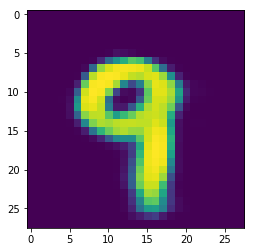

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  11



  0%|          | 1/214 [00:02<09:23,  2.65s/it]

[8 1 0 2 3 4 9 9 9 4 5 8 6 9 1 0 9 6 0 1 8 1 1 1 7 6 7 5 5 3 9 1 4 6 6 4 7
 6 1 7 9 1 3 8 7 3 9 5 0 5 5 6 2 4 7 2 9 3 0 2 8 6 4 1 8 4 1 6 4 0 7 9 8 4
 4 0 4 2 6 9 8 9 8 1 4 7 1 7 5 4 7 1 0 0 4 1 4 4 1 2 1 8 0 3 9 8 5 9 1 5 1
 2 9 6 9 5 5 3 4 7 7 0 4 6 1 2 1 1 2 1 1 7 2 6 5 3 5 9 9 7 4 3 9 1 3 6 2 0
 2 5 6 2 9 1 3 3 9 2 3 5 2 6 7 3 8 8 4 8 3 5 8 2 3 9 1 2 2 7 1 0 5 0 8 2 2
 4 9 5 0 7 7 1 5 9 9 2 6 6 9 6 4 8 7 9 0 9 0 4 3 9 8 6 9 0 6 0 3 0 1 4 5 6
 2 6 5 8 4 8 0 2 0 7 0 0 9 0 1 3 9 0 1 5 8 7 2 1 8 6 4 7 5 6 0 3 7 9]
[8 1 0 2 3 4 9 9 9 4 5 8 6 9 1 0 9 6 0 1 8 1 1 1 7 6 7 5 5 3 9 1 4 6 6 4 7
 6 1 7 9 1 3 8 7 3 9 5 0 5 5 6 2 4 7 2 9 3 0 2 8 6 4 1 8 4 1 6 4 0 7 9 8 4
 4 0 4 2 6 9 8 9 8 1 4 7 1 7 5 4 7 1 0 0 4 1 4 4 1 2 1 8 0 3 9 8 5 9 1 5 1
 2 9 6 9 5 5 3 4 7 7 0 4 6 1 2 1 1 2 1 1 7 2 6 5 3 5 9 9 7 4 3 9 1 3 6 2 0
 2 5 6 2 9 1 3 3 9 2 3 5 2 6 7 3 8 8 4 8 3 5 8 2 3 9 1 2 2 7 1 0 5 0 8 2 2
 4 9 5 0 7 7 1 5 9 9 2 6 6 9 6 4 8 7 9 0 9 0 4 3 9 8 6 9 0 6 0 3 0 1 4 5 6
 2 6 5 8 4 8 0 2 0 7 0 0 9 0 1


  1%|          | 2/214 [00:05<09:27,  2.68s/it]

[4 1 0 0 7 3 5 8 7 1 2 2 0 7 4 1 7 1 8 3 2 7 6 8 5 4 2 5 0 1 2 6 5 8 6 1 4
 7 3 6 3 6 9 0 0 0 0 9 4 1 1 6 5 9 8 6 8 2 0 1 3 7 4 5 6 0 4 4 9 3 8 6 6 6
 3 3 6 0 6 4 9 7 7 3 3 0 7 5 7 2 7 0 1 6 9 9 6 8 9 7 0 8 9 7 8 0 0 1 2 4 1
 1 6 4 8 3 4 8 5 0 1 4 4 7 1 1 8 2 4 4 8 5 1 3 4 1 1 8 8 6 6 7 6 1 8 6 1 3
 9 2 4 3 2 8 6 9 5 2 3 1 8 3 2 2 8 5 7 1 9 5 0 0 5 4 9 7 4 2 1 4 3 9 2 0 9
 4 6 9 2 7 5 9 2 4 6 5 9 7 4 3 3 7 5 7 1 7 3 3 7 8 9 5 3 1 4 4 6 5 7 3 7 9
 0 8 4 1 9 9 7 4 2 7 2 5 1 8 1 8 2 7 7 7 3 8 4 2 5 7 5 7 2 1 2 6 9 1]
[4 1 0 0 7 3 5 8 7 1 2 2 0 7 4 1 7 1 8 3 2 7 6 8 5 4 2 5 0 1 2 6 5 8 6 1 4
 7 3 6 3 6 9 0 0 0 0 9 4 1 1 6 5 9 8 6 8 2 0 1 3 7 4 5 6 0 4 4 9 3 8 6 6 6
 3 3 6 0 6 4 9 7 7 3 3 0 7 5 7 2 7 0 1 6 9 9 6 8 9 7 0 8 9 7 8 0 0 1 2 4 1
 1 6 4 8 3 4 8 5 0 1 4 4 7 1 1 8 2 4 4 8 5 1 3 4 1 1 8 8 6 6 7 6 1 8 6 1 3
 9 2 4 3 2 8 6 9 5 2 3 1 8 3 2 2 8 5 7 1 9 5 0 0 5 4 9 7 4 2 1 4 3 9 2 0 9
 4 6 9 2 7 5 9 2 4 6 5 9 7 4 3 3 7 5 7 1 7 3 3 7 8 9 5 3 1 4 4 6 5 7 3 7 9
 0 8 4 1 9 9 7 4 2 7 2 5 1 8 1


  1%|▏         | 3/214 [00:08<09:24,  2.68s/it]

[9 5 9 9 7 0 7 2 9 8 6 7 0 0 5 6 7 8 2 2 9 8 6 0 2 9 2 0 3 7 9 6 2 0 7 5 4
 2 3 6 5 5 0 1 8 0 8 1 0 4 6 8 0 1 7 0 3 5 2 5 7 5 1 2 8 1 4 8 3 6 0 2 9 3
 8 4 9 9 8 7 3 6 7 9 9 8 3 5 5 0 4 7 5 5 7 3 5 4 8 5 7 0 4 4 5 1 5 4 3 9 7
 8 1 5 0 0 0 4 9 9 7 2 7 8 8 9 8 1 6 8 2 3 7 6 7 1 7 1 3 4 2 1 7 1 5 6 0 7
 3 7 3 1 2 9 8 6 7 6 5 5 7 9 6 5 9 9 7 2 6 5 1 3 1 3 4 2 1 7 9 6 9 2 9 5 4
 2 8 6 1 4 9 5 7 6 8 8 1 6 9 7 6 0 5 1 9 8 9 3 9 2 6 4 5 9 6 7 9 0 7 1 6 3
 6 1 2 4 9 0 1 5 9 9 9 2 1 8 4 8 7 3 3 6 4 9 6 1 6 8 9 7 9 3 6 9 5 9]
[9 5 9 9 7 0 7 2 9 8 6 7 0 0 5 6 7 8 2 2 9 8 6 0 2 9 2 0 3 7 9 6 2 0 7 5 4
 2 3 6 5 5 0 1 8 0 8 1 0 4 6 8 0 1 7 0 3 5 2 5 7 5 1 2 8 1 4 8 3 6 0 2 9 3
 8 4 9 9 8 7 3 6 7 9 9 8 3 5 5 0 4 7 5 5 7 3 5 4 8 5 7 0 4 4 5 1 5 4 3 9 7
 8 1 5 0 0 0 4 9 9 7 2 7 8 8 9 8 1 6 8 2 3 7 6 7 1 7 1 3 4 2 1 7 1 5 6 0 7
 3 7 3 1 2 9 8 6 7 6 5 5 7 9 6 5 9 9 7 2 6 5 1 3 1 3 4 2 1 7 9 6 9 2 9 5 4
 2 8 6 1 4 9 5 7 6 8 8 1 6 9 7 6 0 5 1 9 8 9 3 9 2 6 4 5 9 6 7 9 0 7 1 6 3
 6 1 2 4 9 0 1 5 9 9 9 2 1 8 4


  2%|▏         | 4/214 [00:10<09:17,  2.66s/it]

[6 7 0 2 1 2 9 2 7 7 2 1 4 9 4 8 7 5 4 4 3 5 3 7 0 5 6 7 9 7 7 9 3 3 2 8 2
 3 0 0 0 1 7 1 3 2 2 1 2 6 5 1 7 0 5 4 0 9 3 9 0 4 8 7 6 5 6 9 8 3 7 1 3 9
 8 1 3 6 4 0 1 5 1 8 8 3 3 0 5 3 9 7 5 4 5 2 5 6 8 8 8 0 8 1 9 6 3 6 7 4 3
 8 9 3 0 1 4 6 7 7 9 0 7 1 8 6 1 3 6 6 6 7 9 7 7 7 6 2 9 3 4 2 9 1 4 5 8 4
 5 0 0 6 0 7 1 3 9 7 1 6 2 8 8 4 6 2 0 4 5 8 3 9 1 4 7 6 7 5 9 1 2 0 0 0 1
 6 4 1 5 2 7 7 9 8 0 7 1 5 5 5 6 4 3 8 7 4 8 6 6 4 9 6 6 6 8 9 3 6 2 9 5 6
 6 0 6 4 4 0 3 6 8 3 7 9 8 6 3 2 8 8 9 8 1 6 4 1 4 6 9 9 0 9 6 9 0 3]
[6 7 0 2 1 2 9 2 7 7 2 1 4 9 4 8 7 5 4 4 3 5 3 7 0 5 6 7 9 7 7 9 3 3 2 8 2
 3 0 0 0 1 7 1 3 2 2 1 2 6 5 1 7 0 5 4 0 9 3 9 0 4 8 7 6 5 6 9 8 3 7 1 3 9
 8 1 3 6 4 0 1 5 1 8 8 3 3 0 5 3 9 7 5 4 5 2 5 6 8 8 8 0 8 1 9 6 3 6 7 4 3
 8 9 3 0 1 4 6 7 7 9 0 7 1 8 6 1 3 6 6 6 7 9 7 7 7 6 2 9 3 4 2 9 1 4 5 8 4
 5 0 0 6 0 7 1 3 9 7 1 6 2 8 8 4 6 2 0 4 5 8 3 9 1 4 7 6 7 5 9 1 2 0 0 0 1
 6 4 1 5 2 7 7 9 8 0 7 1 5 5 5 6 4 3 8 7 4 8 6 6 4 9 6 6 6 8 9 3 6 2 9 5 6
 6 0 6 4 4 0 3 6 8 3 7 9 8 6 3


  2%|▏         | 5/214 [00:13<09:13,  2.65s/it]

[7 3 6 4 4 4 9 9 4 2 5 1 4 8 0 6 6 7 4 7 1 3 0 9 3 1 5 7 9 8 6 1 9 4 8 6 3
 1 7 4 8 9 3 7 6 2 2 1 5 4 4 0 1 6 5 6 1 6 5 4 5 0 5 9 3 8 4 4 7 9 2 9 8 4
 1 6 4 8 6 3 1 7 0 9 2 8 3 6 4 3 9 7 6 2 9 5 7 7 6 5 1 7 9 3 9 1 4 7 8 4 7
 4 7 3 4 1 5 7 8 8 7 4 8 7 8 1 6 3 6 3 8 1 4 2 1 8 6 2 5 0 0 1 7 8 4 0 4 9
 3 7 9 0 9 6 2 4 8 7 8 3 6 8 8 8 7 6 3 8 9 8 3 5 5 8 9 5 2 4 1 3 7 4 0 0 3
 3 7 5 5 2 8 0 5 1 6 1 0 8 1 6 2 8 8 7 3 3 2 7 4 3 4 9 4 6 2 9 4 7 4 1 4 3
 6 7 5 2 6 1 4 4 4 1 8 1 1 5 3 7 9 5 1 7 5 2 3 7 5 0 9 4 4 7 4 2 9 7]
[7 3 6 4 4 4 9 9 4 2 5 1 4 8 0 6 6 7 4 7 1 3 0 9 3 1 5 7 9 8 6 1 9 4 8 6 3
 1 7 4 8 9 3 7 6 2 2 1 5 4 4 0 1 6 5 6 1 6 5 4 5 0 5 9 3 8 4 4 7 9 2 9 8 4
 1 6 4 8 6 3 1 7 0 9 2 8 3 6 4 3 9 7 6 2 9 5 7 7 6 5 1 7 9 3 9 1 4 7 8 4 7
 4 7 3 4 1 5 7 8 8 7 4 8 7 8 1 6 3 6 3 8 1 4 2 1 8 6 2 5 0 0 1 7 8 4 0 4 9
 3 7 9 0 9 6 2 4 8 7 8 3 6 8 8 8 7 6 3 8 9 8 3 5 5 8 9 5 2 4 1 3 7 4 0 0 3
 3 7 5 5 2 8 0 5 1 6 1 0 8 1 6 2 8 8 7 3 3 2 7 4 3 4 9 4 6 2 9 4 7 4 1 4 3
 6 7 5 2 6 1 4 4 4 1 8 1 1 5 3


  3%|▎         | 6/214 [00:15<09:09,  2.64s/it]

[6 1 3 1 3 4 1 1 9 5 6 3 2 4 9 9 9 7 1 5 9 7 8 7 5 6 3 4 2 4 0 9 5 0 3 7 2
 2 4 9 9 2 6 8 5 9 0 9 6 0 5 3 6 9 2 4 5 1 2 7 2 2 8 9 7 1 1 2 0 3 1 4 5 9
 7 8 4 2 2 6 0 4 7 3 8 1 5 4 5 0 8 4 3 5 0 2 0 9 4 5 7 1 4 9 7 8 2 5 1 8 7
 0 3 8 7 3 5 7 9 0 8 2 2 3 9 9 2 4 8 5 0 3 0 4 2 0 1 3 2 1 8 5 4 6 7 8 1 9
 1 5 8 1 8 7 3 1 3 0 3 3 3 1 3 4 6 9 5 6 8 3 9 2 5 3 6 5 7 8 9 8 8 4 1 6 6
 8 4 5 5 8 5 0 2 3 2 7 3 3 5 8 6 3 2 2 9 5 3 1 6 1 6 7 3 2 2 5 2 8 9 0 2 9
 5 8 8 8 0 9 3 2 2 6 7 2 6 9 4 5 2 3 4 6 7 2 3 7 6 6 2 5 7 3 3 2 4 8]
[6 1 3 1 3 4 1 1 9 5 6 3 2 4 9 9 9 7 1 5 9 7 8 7 5 6 3 4 2 4 0 9 5 0 3 7 2
 2 4 9 9 2 6 8 5 9 0 9 6 0 5 3 6 9 2 4 5 1 2 7 2 2 8 9 7 1 1 2 0 3 1 4 5 9
 7 8 4 2 2 6 0 4 7 3 8 1 5 4 5 0 8 4 3 5 0 2 0 9 4 5 7 1 4 9 7 8 2 5 1 8 7
 0 3 8 7 3 5 7 9 0 8 2 2 3 9 9 2 4 8 5 0 3 0 4 2 0 1 3 2 1 8 5 4 6 7 8 1 9
 1 5 8 1 8 7 3 1 3 0 3 3 3 1 3 4 6 9 5 6 8 3 9 2 5 3 6 5 7 8 9 8 8 4 1 6 6
 8 4 5 5 8 5 0 2 3 2 7 3 3 5 8 6 3 2 2 9 5 3 1 6 1 6 7 3 2 2 5 2 8 9 0 2 9
 5 8 8 8 0 9 3 2 2 6 7 2 6 9 4


  3%|▎         | 7/214 [00:18<09:05,  2.64s/it]

[2 7 4 5 6 9 9 0 8 6 1 0 9 2 2 3 8 4 0 2 4 4 5 8 8 4 9 7 7 9 9 7 5 7 0 1 0
 7 8 5 9 5 4 4 3 3 3 6 8 4 3 1 7 4 5 3 2 8 3 1 8 9 1 8 8 6 4 9 7 5 9 9 0 8
 7 2 7 3 2 5 8 1 8 3 6 8 1 0 4 5 3 6 8 8 8 1 1 7 0 8 3 6 4 3 7 1 1 0 1 6 4
 2 6 4 9 4 8 2 2 9 9 8 8 5 6 0 3 1 6 9 3 6 0 4 9 1 4 9 7 3 1 8 8 2 8 6 3 1
 7 5 6 3 0 4 0 0 7 6 0 2 4 9 4 2 9 1 1 8 4 9 8 7 0 5 2 4 4 7 0 0 4 0 6 2 1
 6 9 2 5 5 4 0 6 2 0 5 4 0 6 4 3 0 5 5 9 0 8 6 8 2 1 1 1 0 0 7 8 4 7 7 5 4
 4 7 2 7 4 8 2 0 5 9 3 2 7 4 9 1 9 3 8 6 7 2 3 1 2 3 5 8 3 1 0 3 7 2]
[2 7 4 5 6 9 9 0 8 6 1 0 9 2 2 3 8 4 0 2 4 4 5 8 8 4 9 7 7 9 9 7 5 7 0 1 0
 7 8 5 9 5 4 4 3 3 3 6 8 4 3 1 7 4 5 3 2 8 3 1 8 9 1 8 8 6 4 9 7 5 9 9 0 8
 7 2 7 3 2 5 8 1 8 3 6 8 1 0 4 5 3 6 8 8 8 1 1 7 0 8 3 6 4 3 7 1 1 0 1 6 4
 2 6 4 9 4 8 2 2 9 9 8 8 5 6 0 3 1 6 9 3 6 0 4 9 1 4 9 7 3 1 8 8 2 8 6 3 1
 7 5 6 3 0 4 0 0 7 6 0 2 4 9 4 2 9 1 1 8 4 9 8 7 0 5 2 4 4 7 0 0 4 0 6 2 1
 6 9 2 5 5 4 0 6 2 0 5 4 0 6 4 3 0 5 5 9 0 8 6 8 2 1 1 1 0 0 7 8 4 7 7 5 4
 4 7 2 7 4 8 2 0 5 9 3 2 7 4 9


  4%|▎         | 8/214 [00:21<09:01,  2.63s/it]

[4 0 7 1 6 1 4 2 0 5 7 4 6 2 5 4 2 9 1 7 7 6 3 0 3 7 2 3 3 6 6 3 5 1 7 7 9
 8 8 8 4 1 2 9 2 5 9 8 1 8 9 5 8 8 9 2 4 0 0 8 8 0 0 5 0 4 6 3 7 8 8 7 4 9
 3 7 5 6 2 1 9 7 6 9 8 7 2 7 0 9 0 1 7 4 7 4 2 0 0 1 9 3 6 7 3 3 1 1 5 9 4
 2 4 4 1 1 1 6 5 1 8 8 8 0 5 8 9 7 9 2 4 4 1 9 8 3 1 2 0 5 7 3 9 2 9 3 4 8
 1 3 7 6 2 4 3 4 6 9 8 6 1 2 1 9 4 0 7 2 7 2 2 2 5 5 8 5 0 0 2 2 1 5 6 6 8
 9 1 8 8 6 6 5 9 6 3 7 7 8 1 5 9 3 3 9 4 6 8 5 7 5 5 7 8 1 3 7 9 0 1 2 8 9
 7 6 0 4 0 4 8 7 9 3 4 7 7 3 5 6 2 1 5 3 1 0 2 8 7 6 6 1 7 1 6 2 9 0]
[4 0 7 1 6 1 4 2 0 5 7 4 6 2 5 4 2 9 1 7 7 6 3 0 3 7 2 3 3 6 6 3 5 1 7 7 9
 8 8 8 4 1 2 9 2 5 9 8 1 8 9 5 8 8 9 2 4 0 0 8 8 0 0 5 0 4 6 3 7 8 8 7 4 9
 3 7 5 6 2 1 9 7 6 9 8 7 2 7 0 9 0 1 7 4 7 4 2 0 0 1 9 3 6 7 3 3 1 1 5 9 4
 2 4 4 1 1 1 6 5 1 8 8 8 0 5 8 9 7 9 2 4 4 1 9 8 3 1 2 0 5 7 3 9 2 9 3 4 8
 1 3 7 6 2 4 3 4 6 9 8 6 1 2 1 9 4 0 7 2 7 2 2 2 5 5 8 5 0 0 2 2 1 5 6 6 8
 9 1 8 8 6 6 5 9 6 3 7 7 8 1 5 9 3 3 9 4 6 8 5 7 5 5 7 8 1 3 7 9 0 1 2 8 9
 7 6 0 4 0 4 8 7 9 3 4 7 7 3 5


  4%|▍         | 9/214 [00:23<08:59,  2.63s/it]

[7 7 6 0 7 3 2 1 3 6 7 5 6 0 6 5 8 3 9 6 6 5 0 8 4 7 1 1 3 7 9 4 2 0 4 6 9
 2 8 9 8 6 7 9 2 5 6 2 5 3 7 9 1 0 2 2 6 3 5 7 7 0 8 2 7 8 3 0 3 2 6 0 3 0
 0 6 6 5 1 9 5 5 3 3 2 5 2 1 5 5 1 7 9 0 8 6 5 9 7 9 9 4 3 7 1 3 5 8 1 7 2
 2 9 8 5 4 2 6 3 5 2 4 4 1 2 1 5 4 9 1 6 0 0 8 7 9 4 8 3 7 1 6 2 1 3 9 9 3
 7 1 3 9 0 0 7 0 0 0 0 2 4 6 4 6 2 3 7 3 4 8 0 5 3 9 6 7 8 0 8 0 1 9 4 6 7
 4 2 3 6 4 0 6 0 9 5 2 4 7 0 6 1 9 5 1 3 7 7 3 4 0 4 1 9 9 2 0 9 3 1 7 4 1
 5 2 9 9 9 9 9 7 8 5 7 4 7 2 3 6 6 6 1 1 7 1 1 1 6 4 4 6 6 2 9 8 6 0]
[7 7 6 0 7 3 2 1 3 6 7 5 6 0 6 5 8 3 9 6 6 5 0 8 4 7 1 1 3 7 9 4 2 0 4 6 9
 2 8 9 8 6 7 9 2 5 6 2 5 3 7 9 1 0 2 2 6 3 5 7 7 0 8 2 7 8 3 0 3 2 6 0 3 0
 0 6 6 5 1 9 5 5 3 3 2 5 2 1 5 5 1 7 9 0 8 6 5 9 7 9 9 4 3 7 1 3 5 8 1 7 2
 2 9 8 5 4 2 6 3 5 2 4 4 1 2 1 5 4 9 1 6 0 0 8 7 9 4 8 3 7 1 6 2 1 3 9 9 3
 7 1 3 9 0 0 7 0 0 0 0 2 4 6 4 6 2 3 7 3 4 8 0 5 3 9 6 7 8 0 8 0 1 9 4 6 7
 4 2 3 6 4 0 6 0 9 5 2 4 7 0 6 1 9 5 1 3 7 7 3 4 0 4 1 9 9 2 0 9 3 1 7 4 1
 5 2 9 9 9 9 9 7 8 5 7 4 7 2 3


  5%|▍         | 10/214 [00:26<08:55,  2.63s/it]

[3 4 1 9 3 8 7 6 9 7 8 1 1 2 1 3 6 1 0 0 1 4 4 6 0 4 2 9 6 7 8 1 2 0 3 5 4
 8 9 6 3 8 7 1 0 8 7 0 9 4 2 9 3 3 2 9 4 0 1 8 7 0 8 6 0 0 3 6 3 7 4 3 0 4
 8 4 0 8 4 4 9 6 7 9 9 9 7 9 7 5 1 9 2 6 9 1 1 0 8 8 8 0 8 0 1 7 9 1 7 8 9
 0 9 6 9 4 5 9 1 6 0 4 3 7 8 5 6 7 5 0 3 5 7 7 7 1 5 9 0 8 4 3 3 5 1 8 8 1
 6 5 5 3 7 8 8 4 3 8 9 4 3 7 8 4 9 4 7 1 3 7 9 1 1 6 1 1 4 9 8 5 9 9 7 5 8
 1 3 5 6 6 1 4 0 9 9 6 3 2 6 7 6 7 2 2 9 7 7 8 0 1 3 4 7 5 3 9 1 7 4 8 3 7
 1 6 7 6 4 0 4 2 8 5 2 6 0 4 3 4 0 2 2 3 8 2 1 8 7 3 7 7 9 1 2 7 4 6]
[3 4 1 9 3 8 7 6 9 7 8 1 1 2 1 3 6 1 0 0 1 4 4 6 0 4 2 9 6 7 8 1 2 0 3 5 4
 8 9 6 3 8 7 1 0 8 7 0 9 4 2 9 3 3 2 9 4 0 1 8 7 0 8 6 0 0 3 6 3 7 4 3 0 4
 8 4 0 8 4 4 9 6 7 9 9 9 7 9 7 5 1 9 2 6 9 1 1 0 8 8 8 0 8 0 1 7 9 1 7 8 9
 0 9 6 9 4 5 9 1 6 0 4 3 7 8 5 6 7 5 0 3 5 7 7 7 1 5 9 0 8 4 3 3 5 1 8 8 1
 6 5 5 3 7 8 8 4 3 8 9 4 3 7 8 4 9 4 7 1 3 7 9 1 1 6 1 1 4 9 8 5 9 9 7 5 8
 1 3 5 6 6 1 4 0 9 9 6 3 2 6 7 6 7 2 2 9 7 7 8 0 1 3 4 7 5 3 9 1 7 4 8 3 7
 1 6 7 6 4 0 4 2 8 5 2 6 0 4 3


  5%|▌         | 11/214 [00:28<08:53,  2.63s/it]

[9 1 3 7 7 6 9 4 0 4 9 6 5 7 3 5 0 7 9 1 9 5 5 4 4 8 3 5 3 9 2 7 7 3 9 4 4
 9 2 3 8 4 9 9 5 2 2 2 1 9 4 7 2 1 7 4 7 2 9 6 6 6 4 8 1 3 6 0 6 6 7 7 3 5
 7 8 5 2 9 4 8 7 2 9 3 2 0 8 0 8 7 0 5 6 2 1 0 5 9 5 7 8 4 1 2 2 3 6 6 4 1
 9 0 8 0 8 4 0 8 3 5 9 7 7 3 2 3 2 8 2 6 0 5 8 5 2 4 1 5 1 0 0 5 4 3 5 5 2
 3 3 3 1 2 0 1 6 7 1 5 1 0 0 0 5 5 9 4 6 9 8 6 7 3 7 2 1 5 5 5 3 1 1 4 6 8
 6 2 5 6 6 6 4 2 1 3 8 8 4 0 0 5 0 5 3 5 2 2 8 3 7 9 1 9 2 9 2 0 6 1 8 5 1
 1 9 8 6 2 4 0 1 4 4 3 0 9 7 1 0 8 4 9 6 4 6 7 3 9 8 7 4 0 2 0 6 9 7]
[9 1 3 7 7 6 9 4 0 4 9 6 5 7 3 5 0 7 9 1 9 5 5 4 4 8 3 5 3 9 2 7 7 3 9 4 4
 9 2 3 8 4 9 9 5 2 2 2 1 9 4 7 2 1 7 4 7 2 9 6 6 6 4 8 1 3 6 0 6 6 7 7 3 5
 7 8 5 2 9 4 8 7 2 9 3 2 0 8 0 8 7 0 5 6 2 1 0 5 9 5 7 8 4 1 2 2 3 6 6 4 1
 9 0 8 0 8 4 0 8 3 5 9 7 7 3 2 3 2 8 2 6 0 5 8 5 2 4 1 5 1 0 0 5 4 3 5 5 2
 3 3 3 1 2 0 1 6 7 1 5 1 0 0 0 5 5 9 4 6 9 8 6 7 3 7 2 1 5 5 5 3 1 1 4 6 8
 6 2 5 6 6 6 4 2 1 3 8 8 4 0 0 5 0 5 3 5 2 2 8 3 7 9 1 9 2 9 2 0 6 1 8 5 1
 1 9 8 6 2 4 0 1 4 4 3 0 9 7 1


  6%|▌         | 12/214 [00:31<08:51,  2.63s/it]

[6 1 5 3 1 2 0 0 1 9 8 7 7 0 1 1 8 9 8 3 7 3 0 0 5 1 6 1 0 7 7 8 1 5 5 7 9
 3 0 3 2 4 3 0 0 9 3 0 8 9 9 0 0 6 2 3 5 9 4 9 4 3 3 9 4 9 7 1 2 8 1 7 3 4
 7 4 2 8 0 8 5 1 2 7 5 8 3 8 4 5 8 6 0 2 6 1 1 6 8 8 4 4 7 9 9 6 9 8 0 5 5
 1 4 4 1 2 2 0 2 4 8 3 2 2 1 5 7 7 8 1 7 5 8 5 4 6 1 2 4 1 4 4 5 8 8 2 7 4
 6 9 5 8 6 3 8 4 1 3 0 0 8 9 6 3 8 7 1 4 4 1 2 0 1 1 9 6 4 1 5 2 7 7 5 9 1
 1 9 7 7 5 7 9 7 5 4 0 7 9 8 6 6 6 9 5 0 6 3 4 7 3 1 7 3 1 7 2 5 5 1 6 2 8
 0 0 2 5 1 6 6 6 9 7 9 0 1 1 5 0 0 5 0 7 7 1 6 4 8 7 5 1 0 1 8 5 7 9]
[6 1 5 3 1 2 0 0 1 9 8 7 7 0 1 1 8 9 8 3 7 3 0 0 5 1 6 1 0 7 7 8 1 5 5 7 9
 3 0 3 2 4 3 0 0 9 3 0 8 9 9 0 0 6 2 3 5 9 4 9 4 3 3 9 4 9 7 1 2 8 1 7 3 4
 7 4 2 8 0 8 5 1 2 7 5 8 3 8 4 5 8 6 0 2 6 1 1 6 8 8 4 4 7 9 9 6 9 8 0 5 5
 1 4 4 1 2 2 0 2 4 8 3 2 2 1 5 7 7 8 1 7 5 8 5 4 6 1 2 4 1 4 4 5 8 8 2 7 4
 6 9 5 8 6 3 8 4 1 3 0 0 8 9 6 3 8 7 1 4 4 1 2 0 1 1 9 6 4 1 5 2 7 7 5 9 1
 1 9 7 7 5 7 9 7 5 4 0 7 9 8 6 6 6 9 5 0 6 3 4 7 3 1 7 3 1 7 2 5 5 1 6 2 8
 0 0 2 5 1 6 6 6 9 7 9 0 1 1 5


  6%|▌         | 13/214 [00:34<08:49,  2.63s/it]

[7 4 9 1 6 6 0 7 7 3 7 2 2 7 9 7 4 4 6 7 1 1 6 3 0 4 2 1 9 8 0 1 2 2 0 7 9
 6 2 5 2 4 8 1 9 8 5 8 5 8 7 8 3 2 3 8 9 3 0 9 1 8 6 3 0 5 4 1 1 7 4 3 8 6
 1 8 6 2 1 3 3 2 5 2 1 5 8 8 2 3 3 9 5 2 1 4 6 7 6 5 3 5 3 7 3 8 8 2 8 1 1
 1 2 6 4 8 4 5 0 7 1 0 1 4 7 1 0 9 4 0 9 7 2 0 2 1 2 1 7 0 8 7 2 5 8 7 1 2
 6 8 8 5 6 7 4 5 4 9 6 8 4 7 6 6 2 8 8 5 2 1 5 4 1 5 2 6 2 1 4 4 0 3 9 0 8
 7 2 5 6 2 9 0 7 0 9 3 9 8 4 7 6 9 2 2 4 1 6 4 6 6 4 7 3 5 6 7 5 2 4 6 1 7
 1 6 8 7 8 8 6 8 4 8 8 9 3 9 4 5 0 5 2 9 7 8 5 3 7 0 5 9 1 3 4 7 9 2]
[7 4 9 1 6 6 0 7 7 3 7 2 2 7 9 7 4 4 6 7 1 1 6 3 0 4 2 1 9 8 0 1 2 2 0 7 9
 6 2 5 2 4 8 1 9 8 5 8 5 8 7 8 3 2 3 8 9 3 0 9 1 8 6 3 0 5 4 1 1 7 4 3 8 6
 1 8 6 2 1 3 3 2 5 2 1 5 8 8 2 3 3 9 5 2 1 4 6 7 6 5 3 5 3 7 3 8 8 2 8 1 1
 1 2 6 4 8 4 5 0 7 1 0 1 4 7 1 0 9 4 0 9 7 2 0 2 1 2 1 7 0 8 7 2 5 8 7 1 2
 6 8 8 5 6 7 4 5 4 9 6 8 4 7 6 6 2 8 8 5 2 1 5 4 1 5 2 6 2 1 4 4 0 3 9 0 8
 7 2 5 6 2 9 0 7 0 9 3 9 8 4 7 6 9 2 2 4 1 6 4 6 6 4 7 3 5 6 7 5 2 4 6 1 7
 1 6 8 7 8 8 6 8 4 8 8 9 3 9 4


  7%|▋         | 14/214 [00:36<08:45,  2.63s/it]

[3 2 1 9 6 8 9 0 3 8 9 8 1 3 2 0 3 8 1 8 7 6 1 8 1 6 0 5 2 3 5 9 1 3 7 8 5
 7 1 9 7 8 1 8 2 9 9 1 1 3 5 2 2 3 9 8 1 8 2 7 0 3 0 2 7 8 7 2 9 7 6 2 4 8
 6 6 0 1 7 2 6 2 1 1 4 7 9 9 2 7 1 4 9 7 9 0 0 9 5 3 3 1 5 0 8 1 9 9 5 7 2
 1 0 2 6 0 8 5 1 1 2 3 0 3 1 2 9 3 7 0 7 5 2 4 6 7 4 2 6 9 4 4 5 3 0 3 0 4
 7 4 2 2 7 8 6 2 4 4 0 1 8 7 9 4 9 6 2 5 5 6 8 9 7 8 6 3 4 8 1 2 5 3 2 1 7
 2 5 0 4 3 5 5 8 8 2 8 1 8 9 7 2 2 6 8 4 5 6 0 6 1 6 9 6 2 7 0 0 4 6 0 4 3
 1 3 4 4 6 4 4 5 7 2 8 5 2 0 9 5 4 4 7 2 8 5 8 6 7 1 5 1 2 6 6 2 7 4]
[3 2 1 9 6 8 9 0 3 8 9 8 1 3 2 0 3 8 1 8 7 6 1 8 1 6 0 5 2 3 5 9 1 3 7 8 5
 7 1 9 7 8 1 8 2 9 9 1 1 3 5 2 2 3 9 8 1 8 2 7 0 3 0 2 7 8 7 2 9 7 6 2 4 8
 6 6 0 1 7 2 6 2 1 1 4 7 9 9 2 7 1 4 9 7 9 0 0 9 5 3 3 1 5 0 8 1 9 9 5 7 2
 1 0 2 6 0 8 5 1 1 2 3 0 3 1 2 9 3 7 0 7 5 2 4 6 7 4 2 6 9 4 4 5 3 0 3 0 4
 7 4 2 2 7 8 6 2 4 4 0 1 8 7 9 4 9 6 2 5 5 6 8 9 7 8 6 3 4 8 1 2 5 3 2 1 7
 2 5 0 4 3 5 5 8 8 2 8 1 8 9 7 2 2 6 8 4 5 6 0 6 1 6 9 6 2 7 0 0 4 6 0 4 3
 1 3 4 4 6 4 4 5 7 2 8 5 2 0 9


  7%|▋         | 15/214 [00:39<08:43,  2.63s/it]

[4 7 2 1 8 6 7 7 3 6 3 2 3 2 7 6 1 3 8 1 6 9 3 9 2 6 4 3 9 9 3 9 0 4 3 1 8
 8 0 2 5 9 2 6 2 5 0 9 5 0 4 3 4 8 7 4 9 0 7 2 8 5 3 1 7 6 1 3 4 5 1 3 6 9
 3 4 3 8 0 0 8 2 2 0 4 6 6 2 0 9 9 9 0 5 0 5 7 0 8 5 3 6 2 9 2 0 6 3 0 3 3
 0 8 0 4 9 6 2 4 7 3 0 5 5 5 3 0 5 5 1 7 2 7 6 6 6 0 9 5 6 4 9 2 4 0 8 4 9
 1 8 6 6 6 2 7 7 9 5 0 7 7 5 7 6 8 9 8 4 3 2 2 8 3 8 2 0 4 6 0 9 8 1 0 4 0
 5 8 0 1 5 9 5 6 8 7 8 1 0 3 1 8 3 1 0 8 5 9 3 9 9 1 3 8 4 9 3 6 8 1 3 5 2
 7 5 0 8 9 9 7 0 8 1 4 1 3 7 9 6 7 9 5 2 1 2 4 3 8 1 0 1 6 4 0 3 2 2]
[4 7 2 1 8 6 7 7 3 6 3 2 3 2 7 6 1 3 8 1 6 9 3 9 2 6 4 3 9 9 3 9 0 4 3 1 8
 8 0 2 5 9 2 6 2 5 0 9 5 0 4 3 4 8 7 4 9 0 7 2 8 5 3 1 7 6 1 3 4 5 1 3 6 9
 3 4 3 8 0 0 8 2 2 0 4 6 6 2 0 9 9 9 0 5 0 5 7 0 8 5 3 6 2 9 2 0 6 3 0 3 3
 0 8 0 4 9 6 2 4 7 3 0 5 5 5 3 0 5 5 1 7 2 7 6 6 6 0 9 5 6 4 9 2 4 0 8 4 9
 1 8 6 6 6 2 7 7 9 5 0 7 7 5 7 6 8 9 8 4 3 2 2 8 3 8 2 0 4 6 0 9 8 1 0 4 0
 5 8 0 1 5 9 5 6 8 7 8 1 0 3 1 8 3 1 0 8 5 9 3 9 9 1 3 8 4 9 3 6 8 1 3 5 2
 7 5 0 8 9 9 7 0 8 1 4 1 3 7 9


  7%|▋         | 16/214 [00:42<08:41,  2.64s/it]

[0 5 3 1 9 8 1 5 4 0 5 9 4 9 3 7 1 2 1 0 4 0 4 6 2 4 1 3 8 5 9 2 5 8 2 1 7
 1 7 7 5 5 2 9 5 7 4 2 3 2 2 9 9 9 9 9 1 6 7 1 4 9 5 4 2 5 6 2 5 2 8 7 2 9
 8 1 6 5 3 5 3 5 5 6 9 3 8 2 6 4 3 2 3 1 6 6 4 1 4 5 2 3 8 9 1 0 0 9 0 3 2
 2 1 1 4 0 4 6 5 3 3 3 8 8 9 9 5 8 0 9 6 2 8 8 8 5 7 0 7 0 7 2 9 8 2 1 1 2
 9 1 3 1 7 7 7 0 3 4 2 5 4 8 0 3 4 3 9 4 5 2 0 9 5 5 2 4 3 2 3 1 3 2 0 6 4
 3 7 1 0 6 4 1 8 9 8 9 9 0 0 4 2 6 2 0 2 4 4 0 2 4 9 8 6 6 7 7 8 3 8 7 0 5
 0 7 3 3 9 6 3 7 0 8 2 6 5 2 9 9 1 4 3 8 7 6 6 9 4 4 6 3 8 1 1 0 4 8]
[0 5 3 1 9 8 1 5 4 0 5 9 4 9 3 7 1 2 1 0 4 0 4 6 2 4 1 3 8 5 9 2 5 8 2 1 7
 1 7 7 5 5 2 9 5 7 4 2 3 2 2 9 9 9 9 9 1 6 7 1 4 9 5 4 2 5 6 2 5 2 8 7 2 9
 8 1 6 5 3 5 3 5 5 6 9 3 8 2 6 4 3 2 3 1 6 6 4 1 4 5 2 3 8 9 1 0 0 9 0 3 2
 2 1 1 4 0 4 6 5 3 3 3 8 8 9 9 5 8 0 9 6 2 8 8 8 5 7 0 7 0 7 2 9 8 2 1 1 2
 9 1 3 1 7 7 7 0 3 4 2 5 4 8 0 3 4 3 9 4 5 2 0 9 5 5 2 4 3 2 3 1 3 2 0 6 4
 3 7 1 0 6 4 1 8 9 8 9 9 0 0 4 2 6 2 0 2 4 4 0 2 4 9 8 6 6 7 7 8 3 8 7 0 5
 0 7 3 3 9 6 3 7 0 8 2 6 5 2 9


  8%|▊         | 17/214 [00:44<08:38,  2.63s/it]

[7 3 6 2 9 3 7 4 2 3 2 3 0 0 8 8 6 1 1 2 4 2 0 8 2 1 5 0 4 5 2 0 0 7 2 2 6
 8 8 5 9 8 4 8 8 3 8 4 9 8 3 8 5 0 6 9 7 7 7 9 0 5 8 3 4 4 4 4 5 8 0 1 8 8
 9 1 7 4 2 0 7 6 1 2 8 9 2 6 6 3 6 1 4 8 3 7 9 5 4 4 8 0 8 6 0 1 4 4 9 3 1
 6 0 0 2 1 9 1 3 2 3 5 6 0 6 8 7 1 4 5 0 0 1 9 7 7 1 4 9 4 3 9 5 0 2 8 3 8
 4 2 2 7 2 3 1 3 8 9 7 7 7 5 7 9 3 6 8 3 8 5 2 7 4 4 1 4 6 5 9 5 5 9 8 4 4
 2 8 3 3 8 0 1 1 3 9 1 1 5 4 9 9 3 9 6 8 4 2 0 3 9 1 0 0 5 6 4 8 6 1 8 3 9
 2 8 7 4 3 0 3 0 1 7 2 2 2 9 8 0 4 4 0 6 9 3 0 1 1 5 3 7 1 1 1 0 1 7]
[7 3 6 2 9 3 7 4 2 3 2 3 0 0 8 8 6 1 1 2 4 2 0 8 2 1 5 0 4 5 2 0 0 7 2 2 6
 8 8 5 9 8 4 8 8 3 8 4 9 8 3 8 5 0 6 9 7 7 7 9 0 5 8 3 4 4 4 4 5 8 0 1 8 8
 9 1 7 4 2 0 7 6 1 2 8 9 2 6 6 3 6 1 4 8 3 7 9 5 4 4 8 0 8 6 0 1 4 4 9 3 1
 6 0 0 2 1 9 1 3 2 3 5 6 0 6 8 7 1 4 5 0 0 1 9 7 7 1 4 9 4 3 9 5 0 2 8 3 8
 4 2 2 7 2 3 1 3 8 9 7 7 7 5 7 9 3 6 8 3 8 5 2 7 4 4 1 4 6 5 9 5 5 9 8 4 4
 2 8 3 3 8 0 1 1 3 9 1 1 5 4 9 9 3 9 6 8 4 2 0 3 9 1 0 0 5 6 4 8 6 1 8 3 9
 2 8 7 4 3 0 3 0 1 7 2 2 2 9 8


  8%|▊         | 18/214 [00:47<08:36,  2.64s/it]

[9 0 5 9 7 1 7 8 0 6 3 0 9 7 1 8 0 8 5 2 7 9 1 9 2 8 5 8 2 6 6 5 2 8 7 4 3
 2 9 5 3 2 6 7 5 9 5 8 6 4 0 3 7 6 7 6 1 5 8 0 9 9 7 0 2 7 6 2 9 9 0 6 0 1
 0 6 9 0 9 8 6 0 7 7 0 7 8 6 6 9 8 1 5 5 1 5 4 5 3 1 9 9 7 7 8 7 2 2 8 4 9
 6 1 4 3 6 8 3 1 7 2 4 0 1 1 5 7 5 8 7 2 5 7 7 4 5 1 0 4 4 3 0 4 5 7 0 6 4
 0 5 7 3 3 3 5 1 0 8 4 1 6 8 8 1 7 2 4 1 8 8 0 0 4 2 4 0 1 4 7 7 7 1 0 4 0
 1 7 8 1 2 4 1 0 4 8 4 9 6 8 9 5 3 8 0 9 8 2 2 2 6 5 4 1 1 3 7 8 9 7 0 0 0
 8 8 5 0 1 8 1 8 9 7 7 6 2 6 0 7 4 8 9 0 0 1 6 8 0 0 4 1 8 6 3 8 2 8]
[9 0 5 9 7 1 7 8 0 6 3 0 9 7 1 8 0 8 5 2 7 9 1 9 2 8 5 8 2 6 6 5 2 8 7 4 3
 2 9 5 3 2 6 7 5 9 5 8 6 4 0 3 7 6 7 6 1 5 8 0 9 9 7 0 2 7 6 2 9 9 0 6 0 1
 0 6 9 0 9 8 6 0 7 7 0 7 8 6 6 9 8 1 5 5 1 5 4 5 3 1 9 9 7 7 8 7 2 2 8 4 9
 6 1 4 3 6 8 3 1 7 2 4 0 1 1 5 7 5 8 7 2 5 7 7 4 5 1 0 4 4 3 0 4 5 7 0 6 4
 0 5 7 3 3 3 5 1 0 8 4 1 6 8 8 1 7 2 4 1 8 8 0 0 4 2 4 0 1 4 7 7 7 1 0 4 0
 1 7 8 1 2 4 1 0 4 8 4 9 6 8 9 5 3 8 0 9 8 2 2 2 6 5 4 1 1 3 7 8 9 7 0 0 0
 8 8 5 0 1 8 1 8 9 7 7 6 2 6 0


  9%|▉         | 19/214 [00:50<08:33,  2.63s/it]

[3 0 3 9 7 1 3 9 5 4 0 7 9 8 0 6 4 4 2 3 8 6 9 8 3 7 1 4 7 6 5 5 0 7 3 4 5
 4 1 1 7 1 0 9 0 3 3 7 7 6 7 8 2 2 7 0 4 1 1 2 9 6 9 1 3 7 8 9 2 7 9 5 5 2
 2 7 5 2 1 1 6 6 8 8 0 0 6 3 9 7 6 3 1 5 8 8 3 1 6 7 6 5 3 6 0 1 6 9 7 6 6
 4 1 5 8 9 7 8 1 5 2 7 8 8 6 0 6 2 2 6 4 8 6 1 1 4 9 3 5 4 6 4 3 4 3 0 6 9
 3 7 3 4 4 0 1 9 6 0 4 6 4 6 7 6 2 8 5 1 6 1 6 4 6 8 7 0 1 2 4 3 4 4 1 1 6
 1 0 3 5 6 0 0 3 0 0 9 6 5 8 3 1 0 4 5 7 6 0 7 3 8 8 9 1 2 8 1 2 1 6 9 9 2
 5 6 4 2 8 5 1 1 4 5 1 5 3 1 2 6 5 9 2 8 2 9 2 0 8 2 4 2 4 0 0 0 6 7]
[3 0 3 9 7 1 3 9 5 4 0 7 9 8 0 6 4 4 2 3 8 6 9 8 3 7 1 4 7 6 5 5 0 7 3 4 5
 4 1 1 7 1 0 9 0 3 3 7 7 6 7 8 2 2 7 0 4 1 1 2 9 6 9 1 3 7 8 9 2 7 9 5 5 2
 2 7 5 2 1 1 6 6 8 8 0 0 6 3 9 7 6 3 1 5 8 8 3 1 6 7 6 5 3 6 0 1 6 9 7 6 6
 4 1 5 8 9 7 8 1 5 2 7 8 8 6 0 6 2 2 6 4 8 6 1 1 4 9 3 5 4 6 4 3 4 3 0 6 9
 3 7 3 4 4 0 1 9 6 0 4 6 4 6 7 6 2 8 5 1 6 1 6 4 6 8 7 0 1 2 4 3 4 4 1 1 6
 1 0 3 5 6 0 0 3 0 0 9 6 5 8 3 1 0 4 5 7 6 0 7 3 8 8 9 1 2 8 1 2 1 6 9 9 2
 5 6 4 2 8 5 1 1 4 5 1 5 3 1 2


  9%|▉         | 20/214 [00:52<08:30,  2.63s/it]

[3 8 8 4 1 1 8 3 4 3 0 5 1 7 1 1 3 6 2 6 9 3 4 6 6 3 3 9 6 8 0 5 0 1 7 0 7
 4 8 5 7 7 4 3 1 7 7 4 5 6 6 8 7 1 0 0 2 0 9 7 6 9 9 6 2 8 2 2 8 4 0 3 9 0
 8 0 9 1 9 1 7 5 6 3 3 9 8 9 3 2 6 4 6 7 1 0 8 9 6 6 2 7 9 9 1 0 2 4 9 3 4
 1 5 7 4 7 3 0 4 9 6 2 8 4 1 0 7 0 1 7 7 4 3 8 3 4 9 4 4 0 4 0 1 4 9 7 3 2
 2 7 6 8 0 8 6 7 1 7 7 6 6 0 4 9 8 3 6 7 1 6 2 1 3 0 3 9 7 8 4 5 8 2 0 6 5
 9 4 6 9 2 0 9 8 0 2 6 3 6 1 4 7 5 9 1 1 8 3 9 7 9 4 7 5 3 0 3 4 6 1 4 5 3
 4 1 9 4 8 8 1 9 6 2 4 7 2 2 1 6 8 5 3 6 5 8 2 2 9 9 3 6 1 3 9 0 5 5]
[3 8 8 4 1 1 8 3 4 3 0 5 1 7 1 1 3 6 2 6 9 3 4 6 6 3 3 9 6 8 0 5 0 1 7 0 7
 4 8 5 7 7 4 3 1 7 7 4 5 6 6 8 7 1 0 0 2 0 9 7 6 9 9 6 2 8 2 2 8 4 0 3 9 0
 8 0 9 1 9 1 7 5 6 3 3 9 8 9 3 2 6 4 6 7 1 0 8 9 6 6 2 7 9 9 1 0 2 4 9 3 4
 1 5 7 4 7 3 0 4 9 6 2 8 4 1 0 7 0 1 7 7 4 3 8 3 4 9 4 4 0 4 0 1 4 9 7 3 2
 2 7 6 8 0 8 6 7 1 7 7 6 6 0 4 9 8 3 6 7 1 6 2 1 3 0 3 9 7 8 4 5 8 2 0 6 5
 9 4 6 9 2 0 9 8 0 2 6 3 6 1 4 7 5 9 1 1 8 3 9 7 9 4 7 5 3 0 3 4 6 1 4 5 3
 4 1 9 4 8 8 1 9 6 2 4 7 2 2 1


 10%|▉         | 21/214 [00:55<08:28,  2.63s/it]

[5 1 6 7 4 6 8 3 0 6 1 1 2 6 6 4 1 5 1 3 3 6 2 2 3 4 4 1 6 8 6 1 6 4 9 8 6
 4 7 8 9 2 6 3 2 4 3 5 3 9 5 3 5 9 9 7 8 2 5 9 7 9 0 9 9 1 4 0 8 1 0 7 8 7
 4 2 0 7 6 4 1 3 2 9 5 6 6 9 6 7 3 6 1 0 6 5 6 1 9 8 6 0 3 7 1 6 5 9 7 0 5
 0 8 6 8 0 6 3 9 8 6 9 4 2 4 5 2 5 7 7 5 5 8 5 8 9 6 1 3 9 7 7 8 8 1 0 6 0
 7 3 0 3 2 1 1 0 9 7 1 3 6 7 1 1 4 5 1 4 6 9 8 5 2 1 0 6 1 8 9 2 9 1 9 2 0
 4 5 2 7 1 9 6 4 3 1 5 2 6 9 2 8 8 3 2 4 6 1 8 1 6 3 1 5 7 4 1 2 9 2 5 7 9
 8 0 7 3 0 0 2 3 5 2 0 6 7 3 4 7 5 8 2 2 2 7 1 9 1 6 8 5 7 2 2 7 6 4]
[5 1 6 7 4 6 8 3 0 6 1 1 2 6 6 4 1 5 1 3 3 6 2 2 3 4 4 1 6 8 6 1 6 4 9 8 6
 4 7 8 9 2 6 3 2 4 3 5 3 9 5 3 5 9 9 7 8 2 5 9 7 9 0 9 9 1 4 0 8 1 0 7 8 7
 4 2 0 7 6 4 1 3 2 9 5 6 6 9 6 7 3 6 1 0 6 5 6 1 9 8 6 0 3 7 1 6 5 9 7 0 5
 0 8 6 8 0 6 3 9 8 6 9 4 2 4 5 2 5 7 7 5 5 8 5 8 9 6 1 3 9 7 7 8 8 1 0 6 0
 7 3 0 3 2 1 1 0 9 7 1 3 6 7 1 1 4 5 1 4 6 9 8 5 2 1 0 6 1 8 9 2 9 1 9 2 0
 4 9 2 7 1 9 6 4 3 1 5 2 6 9 2 8 8 3 2 4 6 1 8 1 6 3 1 5 7 4 1 2 9 2 5 7 9
 8 0 7 3 0 0 2 3 5 2 0 6 7 3 4


 10%|█         | 22/214 [00:57<08:26,  2.64s/it]

[9 9 0 0 8 1 6 4 2 2 5 1 1 3 9 3 2 4 1 0 5 1 0 8 2 4 8 9 6 1 9 6 5 9 0 0 9
 1 1 2 9 7 4 5 4 1 2 1 9 7 7 4 9 2 9 6 9 8 6 1 4 5 5 7 6 7 4 4 9 0 8 4 5 2
 5 1 2 7 6 7 2 1 7 2 7 7 6 4 0 3 1 0 6 9 3 4 1 4 4 3 7 9 2 6 4 0 6 6 7 7 9
 0 3 1 7 8 9 7 1 7 7 6 5 1 2 4 3 8 2 7 9 6 7 3 9 3 6 2 9 5 0 6 3 6 6 5 9 5
 4 5 9 9 9 9 2 7 2 2 3 4 8 8 0 2 1 5 3 4 9 6 8 9 4 1 3 9 3 2 4 7 6 4 7 8 7
 2 3 5 1 8 9 3 5 8 4 6 8 9 8 5 6 8 7 5 8 2 1 7 7 9 4 2 3 3 8 7 1 8 5 0 3 7
 2 6 5 5 3 4 6 7 7 2 1 7 9 8 7 4 6 2 9 7 6 2 6 7 1 7 0 1 8 1 1 8 2 6]
[9 9 0 0 8 1 6 4 2 2 5 1 1 3 9 3 2 4 1 0 5 1 0 8 2 4 8 9 6 1 9 6 5 9 0 0 9
 1 1 2 9 7 4 5 4 1 2 1 9 7 7 4 9 2 9 6 9 8 6 1 4 5 5 7 6 7 4 4 9 0 8 4 5 2
 5 1 2 7 6 7 2 1 7 2 7 7 6 4 0 3 1 0 6 9 3 4 1 4 4 3 7 9 2 6 4 0 6 6 7 7 9
 0 3 1 7 8 9 7 1 7 7 6 5 1 2 4 3 8 2 7 9 6 7 3 9 3 6 2 9 5 0 6 3 6 6 5 9 5
 4 5 9 9 9 9 2 9 2 2 3 4 8 8 0 2 1 5 3 4 9 6 8 9 4 1 3 9 3 2 4 7 6 4 7 8 7
 2 3 5 1 8 9 3 5 8 4 6 8 9 8 5 6 8 7 5 8 2 1 7 7 9 4 2 3 3 8 7 1 8 5 0 3 7
 2 6 5 5 3 4 6 7 7 2 1 7 9 8 7


 11%|█         | 23/214 [01:00<08:23,  2.64s/it]

[8 3 9 1 9 7 3 6 5 7 0 3 8 0 0 9 3 1 4 9 0 0 7 4 9 0 0 2 8 5 0 8 3 7 4 0 1
 0 2 2 4 0 2 5 8 9 3 6 5 2 9 7 5 9 6 6 0 5 6 4 2 3 3 0 4 1 6 9 2 0 6 5 4 3
 8 5 7 3 0 4 2 4 0 0 3 8 2 8 9 5 8 2 7 1 6 7 4 0 1 5 5 1 2 3 2 0 5 9 6 3 0
 9 6 3 8 1 5 7 2 4 6 6 0 3 0 3 7 3 3 7 6 6 3 2 6 5 2 7 3 2 8 6 3 2 3 9 5 3
 5 6 8 3 8 9 3 2 5 7 6 0 4 2 1 0 5 8 4 7 7 8 4 3 3 8 9 6 9 0 9 2 3 8 0 9 2
 5 1 0 9 6 3 9 6 7 3 9 1 2 6 5 9 7 0 0 8 5 0 4 3 1 9 4 4 5 2 8 9 8 6 7 7 9
 0 2 0 3 2 8 6 3 2 9 5 6 6 4 3 6 1 8 5 6 2 2 9 9 2 4 1 4 3 5 9 2 1 8]
[8 3 9 1 9 7 3 6 5 7 0 3 8 0 0 9 3 1 4 9 0 0 7 4 9 0 0 2 8 5 0 8 3 7 4 0 1
 0 2 2 4 0 2 5 8 9 3 6 5 2 9 7 5 9 6 6 0 5 6 4 2 3 3 0 4 1 6 9 2 0 6 5 4 3
 8 5 7 3 0 4 2 4 0 0 3 8 2 8 9 5 8 2 7 1 6 7 4 0 1 5 5 1 2 3 2 0 5 9 6 3 0
 9 6 3 8 1 5 7 2 4 6 6 0 3 0 3 7 3 3 7 6 6 3 2 6 5 2 7 3 2 8 6 3 2 3 9 5 3
 5 6 8 3 8 9 3 2 5 7 6 0 4 2 1 0 5 8 4 7 7 8 4 3 3 8 9 6 9 0 9 2 3 8 0 9 2
 5 1 0 9 6 3 9 6 7 3 9 1 2 6 5 9 7 0 0 8 5 0 4 3 1 9 4 4 5 2 8 9 8 6 7 7 9
 0 2 0 3 2 8 6 3 2 9 5 6 6 4 3


 11%|█         | 24/214 [01:03<08:21,  2.64s/it]

[0 1 3 4 8 3 9 3 4 0 3 9 0 2 2 5 0 8 4 4 4 7 0 1 7 5 0 4 2 2 6 4 1 3 4 5 2
 7 7 7 6 5 7 9 1 5 8 6 1 7 6 0 3 5 6 6 5 5 9 4 0 7 4 4 7 7 6 5 7 2 4 3 8 8
 0 3 4 5 7 0 7 8 0 4 2 4 3 3 1 1 5 3 8 5 0 3 9 5 4 7 9 7 1 5 9 1 8 6 7 6 9
 7 2 2 1 6 4 6 6 4 8 3 2 4 7 9 7 3 6 7 9 7 0 7 0 2 0 0 0 4 9 0 3 9 5 9 5 3
 0 2 0 0 4 3 2 3 7 8 3 8 9 6 1 6 0 2 7 8 3 2 3 9 1 8 6 4 5 8 0 5 3 0 3 5 9
 0 2 4 2 5 5 4 0 0 3 9 4 4 2 1 3 6 9 9 5 2 4 6 4 9 1 9 3 4 8 0 4 4 3 5 6 1
 9 2 9 6 9 0 9 7 1 2 2 5 6 9 9 3 7 3 5 8 0 6 2 4 4 2 6 9 2 0 4 0 5 8]
[0 1 3 4 8 3 9 3 4 0 3 9 0 2 2 5 0 8 4 4 4 7 0 1 7 5 0 4 2 2 6 4 1 3 4 5 2
 7 7 7 6 5 7 9 1 5 8 6 1 7 6 0 3 5 6 6 5 5 9 4 0 7 4 4 7 7 6 5 7 2 4 3 8 8
 0 3 4 5 7 0 7 8 0 4 2 4 3 3 1 1 5 3 8 5 0 3 9 5 4 7 9 7 1 5 9 1 8 6 7 6 9
 7 2 2 1 6 4 6 6 4 8 3 2 4 7 9 7 3 6 7 9 7 0 7 0 2 0 0 0 4 9 0 3 9 5 9 5 3
 0 2 0 0 4 3 2 3 7 8 3 8 9 6 1 6 0 2 7 8 3 2 3 9 1 8 6 4 5 8 0 5 3 0 3 5 9
 0 2 4 2 5 5 4 0 0 3 9 4 4 2 1 3 6 9 9 5 2 4 6 4 9 1 9 3 4 8 0 4 4 3 5 6 1
 9 2 9 6 9 0 9 7 1 2 2 5 6 9 9


 12%|█▏        | 25/214 [01:05<08:18,  2.64s/it]

[5 8 7 4 4 3 2 1 2 8 3 6 4 7 0 6 3 8 0 6 7 7 3 3 6 4 5 0 9 0 3 7 2 5 1 7 5
 2 4 9 2 5 7 3 3 9 9 2 4 6 8 7 8 8 5 4 0 7 9 4 4 9 6 3 7 8 2 4 8 7 8 9 1 1
 7 3 5 8 3 9 7 3 1 0 9 9 5 5 9 1 4 5 4 6 8 6 6 9 6 2 8 3 4 2 5 1 0 3 0 3 9
 3 1 2 1 3 7 3 0 1 7 6 8 8 1 1 5 6 7 3 5 2 4 9 9 8 6 5 4 8 9 8 5 4 1 7 8 2
 8 0 2 3 6 3 5 4 8 1 6 8 9 6 6 9 3 6 1 9 7 0 6 2 5 9 2 6 7 3 5 1 9 6 5 8 2
 2 4 0 5 8 9 0 4 4 3 9 7 0 1 9 9 4 1 1 2 6 3 3 4 8 2 4 0 2 5 1 6 8 6 6 1 6
 6 1 8 5 3 0 7 5 0 7 0 7 1 7 2 5 7 5 3 9 9 8 8 5 9 3 6 2 9 9 7 4 6 9]
[5 8 7 4 4 3 2 1 2 8 3 6 4 7 0 6 3 8 0 6 7 7 3 3 6 4 5 0 9 0 3 7 2 5 1 7 5
 2 4 9 2 5 7 3 3 9 9 2 4 6 8 7 8 8 5 4 0 7 9 4 4 9 6 3 7 8 2 4 8 7 8 9 1 1
 7 3 5 8 3 9 7 3 1 0 9 9 5 5 9 1 4 5 4 6 8 6 6 9 6 2 8 3 4 2 5 1 0 3 0 3 9
 3 1 2 1 3 7 3 0 1 7 6 8 8 1 1 5 6 7 3 5 2 4 9 9 8 6 5 4 8 9 8 5 4 1 7 8 2
 8 0 2 3 6 3 5 4 8 1 6 8 9 6 6 9 3 6 1 9 7 0 6 2 5 9 2 6 7 3 5 1 9 6 5 8 2
 2 4 0 5 8 9 0 4 4 3 9 7 0 1 9 9 4 1 1 2 6 3 3 4 8 2 4 0 2 5 1 6 8 6 6 1 6
 6 1 8 5 3 0 7 5 0 7 0 7 1 7 2


 12%|█▏        | 26/214 [01:08<08:16,  2.64s/it]

[3 0 0 3 8 3 8 0 7 4 1 4 8 2 6 7 3 0 2 0 4 1 2 9 0 3 8 9 2 9 1 8 6 7 9 2 3
 9 6 9 1 7 2 7 8 8 2 2 3 8 0 9 1 1 5 3 1 7 6 4 5 2 8 3 6 1 3 9 9 5 7 6 7 1
 6 3 0 5 5 7 3 4 9 6 4 4 0 4 0 2 4 4 7 1 8 2 9 9 1 7 6 9 3 4 4 1 4 5 1 7 8
 2 9 6 1 7 5 9 5 2 0 7 7 5 8 5 3 5 1 2 7 2 1 6 2 1 1 6 8 5 0 8 3 2 5 4 3 8
 7 2 8 4 0 4 2 3 8 3 1 8 5 5 8 8 8 7 0 0 4 5 5 8 4 9 1 4 8 1 0 8 9 8 4 1 4
 3 0 6 1 3 2 5 1 0 1 5 3 3 8 4 1 9 7 3 6 9 0 8 8 3 1 3 7 6 9 3 8 5 3 6 3 8
 6 5 8 4 9 4 0 3 0 3 3 2 3 7 3 0 0 3 6 1 7 5 3 9 1 2 4 5 3 8 8 9 0 6]
[3 0 0 3 8 3 8 0 7 4 1 4 8 2 6 7 3 0 2 0 4 1 2 9 0 3 8 9 2 9 1 8 6 7 9 2 3
 9 6 9 1 7 2 7 8 8 2 2 3 8 0 9 1 1 5 3 1 7 6 4 5 2 8 3 6 1 3 9 9 5 7 6 7 1
 6 3 0 5 5 7 3 4 9 6 4 4 0 4 0 2 4 4 7 1 8 2 9 9 1 7 6 9 3 4 4 1 4 5 1 7 8
 2 9 6 1 7 5 9 5 2 0 7 7 5 8 5 3 5 1 2 7 2 1 6 2 1 1 6 8 5 0 8 3 2 5 4 3 8
 7 2 8 4 0 4 2 3 8 3 1 8 5 5 8 8 8 7 0 0 4 5 5 8 4 9 1 4 8 1 0 8 9 8 4 1 4
 3 0 6 1 3 2 5 1 0 1 5 3 3 8 4 1 9 7 3 6 9 0 8 8 3 1 3 7 6 9 3 8 5 3 6 3 8
 6 5 8 4 9 4 0 3 0 3 3 2 3 7 3


 13%|█▎        | 27/214 [01:11<08:14,  2.64s/it]

[2 4 2 5 8 7 4 4 9 9 0 7 4 6 3 8 3 6 7 2 4 0 3 0 7 1 8 4 1 1 2 0 3 9 5 1 6
 8 2 6 6 2 2 1 1 1 3 0 0 8 9 7 2 7 7 0 9 4 2 2 8 8 4 2 1 7 8 0 4 6 4 8 2 4
 3 5 0 2 9 4 5 0 8 2 4 2 8 0 4 1 8 6 3 7 1 1 7 3 9 4 9 3 3 7 1 4 2 6 8 4 3
 9 8 1 3 1 6 5 2 1 9 8 5 1 4 3 0 2 7 6 9 2 7 9 6 1 3 1 3 6 0 5 0 9 1 9 4 3
 2 5 4 4 0 6 4 8 2 8 6 4 1 3 5 7 6 4 4 9 1 2 2 6 7 0 0 4 8 5 8 6 4 2 3 8 6
 2 9 3 3 3 4 4 6 6 0 4 9 3 1 3 9 3 9 7 5 9 7 7 1 5 6 4 9 7 7 1 4 4 8 0 5 0
 6 2 4 6 2 6 3 0 9 5 2 0 1 2 5 3 8 7 2 0 9 6 7 7 3 5 2 3 4 2 1 4 5 9]
[2 4 2 5 8 7 4 4 9 9 0 7 4 6 3 8 3 6 7 2 4 0 3 0 7 1 8 4 1 1 2 0 3 9 5 1 6
 8 2 6 6 2 2 1 1 1 3 0 0 8 9 7 2 7 7 0 9 4 2 2 8 8 4 2 1 7 8 0 4 6 4 8 2 4
 3 5 0 2 9 4 5 0 8 2 4 2 8 0 4 1 8 6 3 7 1 1 7 3 9 4 9 3 3 7 1 4 2 6 8 4 3
 9 8 1 3 1 6 5 2 1 9 8 5 1 4 3 0 2 7 6 9 2 7 9 6 1 3 1 3 6 0 5 0 9 1 9 4 3
 2 5 4 4 0 6 4 8 2 8 6 4 1 3 5 1 6 4 4 9 1 2 2 6 7 0 0 4 8 5 8 6 4 2 3 8 6
 2 9 3 3 3 4 4 6 6 0 4 9 3 1 3 9 3 9 7 5 9 7 7 1 5 6 4 9 7 7 1 4 4 8 0 5 0
 6 2 4 6 2 6 3 0 9 5 2 0 1 2 5


 13%|█▎        | 28/214 [01:14<08:11,  2.64s/it]

[8 2 1 2 8 3 2 3 1 2 0 2 4 9 0 1 7 1 1 7 6 4 6 1 4 2 1 1 1 0 2 7 9 4 4 7 3
 0 6 0 7 4 9 1 8 0 3 7 2 0 4 0 5 7 7 9 9 7 4 3 9 2 4 9 6 4 9 7 4 9 4 7 1 1
 8 2 0 5 3 2 5 0 9 0 6 1 6 2 0 5 0 2 8 6 9 5 7 7 4 5 7 8 4 3 3 9 6 8 2 5 8
 9 9 9 3 3 9 1 2 8 3 4 1 6 4 5 8 8 2 8 3 5 4 6 6 3 7 8 7 1 2 0 5 4 8 4 4 0
 3 2 7 2 3 9 6 7 4 0 9 6 4 5 2 3 7 7 9 9 5 1 5 9 5 5 3 4 3 1 5 4 0 1 4 0 7
 6 5 4 0 0 9 8 4 1 6 8 8 8 9 1 0 7 1 5 8 1 1 8 5 7 6 1 2 4 5 0 2 5 0 1 6 8
 0 4 6 6 4 8 0 4 2 9 3 0 6 4 7 0 7 2 2 0 6 4 1 7 9 1 5 3 7 6 9 2 6 5]
[8 2 1 2 8 3 2 3 1 2 0 2 4 9 0 1 7 1 1 7 6 4 6 1 4 2 1 1 1 0 2 7 9 4 4 7 3
 0 6 0 7 4 9 1 8 0 3 7 2 0 4 0 5 7 7 9 9 7 4 3 9 2 4 9 6 4 9 7 4 9 4 7 1 1
 8 2 0 5 3 2 5 0 9 0 6 1 6 2 0 5 0 2 8 6 9 5 7 7 4 5 7 8 4 3 3 9 6 8 2 5 8
 9 9 9 3 3 9 1 2 8 3 4 1 6 4 5 8 8 2 8 3 5 4 6 6 3 7 8 7 1 2 0 5 4 8 4 4 0
 3 2 7 2 3 9 6 7 4 0 9 6 4 5 2 3 7 7 9 9 5 1 5 9 5 5 3 4 3 1 5 4 0 1 4 0 7
 6 5 4 0 0 9 8 4 1 6 8 8 8 9 1 0 7 1 5 8 1 1 8 5 7 6 1 2 4 5 0 2 5 0 1 6 8
 0 4 6 6 4 8 0 4 2 9 3 0 6 4 7


 14%|█▎        | 29/214 [01:16<08:08,  2.64s/it]

[5 0 2 3 7 0 5 8 9 9 7 7 3 7 6 0 1 4 1 7 2 1 9 8 9 3 7 0 2 5 2 7 1 2 2 8 8
 4 8 1 5 0 2 1 8 7 3 0 5 0 5 3 4 1 9 1 9 7 8 9 6 0 8 2 3 2 1 5 2 4 0 0 3 3
 2 1 8 4 6 1 5 6 6 4 8 8 5 1 1 0 8 7 3 6 8 2 9 8 1 1 4 0 4 8 6 0 3 3 4 4 7
 3 9 5 7 8 9 7 4 2 6 8 0 7 4 3 1 2 7 3 7 3 0 9 9 9 1 3 3 0 1 6 5 5 8 0 6 6
 3 6 7 3 8 8 0 7 4 0 7 8 3 4 6 6 6 5 6 1 7 7 2 4 9 3 7 7 2 5 2 1 3 1 8 8 9
 1 6 1 1 3 7 0 3 4 4 4 1 9 7 3 6 5 6 7 0 6 2 4 5 0 7 2 7 7 1 1 1 6 4 7 1 9
 2 2 4 7 5 2 9 0 0 2 2 9 7 3 4 3 6 0 3 9 5 2 9 6 2 3 7 3 1 8 2 7 8 3]
[5 0 2 3 7 0 5 8 9 9 7 7 3 7 6 0 1 4 1 7 2 1 9 8 9 3 7 0 2 5 2 7 1 2 2 8 8
 4 8 1 5 0 2 1 8 7 3 0 5 0 5 3 4 1 9 1 9 7 8 9 6 0 8 2 3 2 1 5 2 4 0 0 3 3
 2 1 8 4 6 1 5 6 6 4 8 8 5 1 1 0 8 7 3 6 8 2 9 8 1 1 4 0 4 8 6 0 3 3 4 4 7
 3 9 5 7 8 9 7 4 2 6 8 0 7 4 3 1 2 7 3 7 3 0 9 9 9 1 3 3 0 1 6 5 5 8 0 6 6
 3 6 7 3 8 8 0 7 4 0 7 8 3 4 6 6 6 5 6 1 7 7 2 4 9 3 7 7 2 5 2 1 3 1 8 8 9
 1 6 1 1 3 7 0 3 4 4 4 1 9 7 3 6 5 6 7 0 6 2 4 5 0 7 2 7 7 1 1 1 6 4 7 1 9
 2 2 4 7 5 2 9 0 0 2 2 9 7 3 4


 14%|█▍        | 30/214 [01:19<08:06,  2.64s/it]

[2 8 5 9 0 0 8 0 3 2 1 5 9 6 8 8 7 4 2 3 4 4 8 8 7 2 6 3 6 1 4 3 9 1 5 6 8
 7 8 4 7 0 9 5 0 3 4 2 2 4 4 7 9 6 2 9 2 8 2 6 7 7 3 1 5 0 3 6 3 8 7 2 7 0
 1 5 6 3 7 4 0 1 1 8 2 8 8 1 7 7 3 1 2 3 7 7 6 7 3 2 1 0 1 5 8 3 6 7 2 7 0
 0 0 4 2 0 1 8 7 4 3 8 1 4 4 9 0 1 6 5 1 9 5 1 4 7 0 1 9 3 5 6 1 2 4 8 1 3
 2 2 6 3 4 1 9 2 1 0 2 8 7 4 0 9 0 7 4 8 5 9 2 3 2 5 1 1 0 1 1 3 6 3 8 7 8
 7 5 7 8 6 0 8 3 2 4 6 7 6 8 1 3 1 1 4 9 1 6 2 7 8 3 2 7 9 5 7 1 7 3 9 6 7
 4 4 3 4 8 7 3 1 4 5 8 2 8 0 2 6 2 7 4 5 8 6 7 3 2 6 0 8 1 6 7 2 9 1]
[2 8 5 9 0 0 8 0 3 2 1 5 9 6 8 8 7 4 2 3 4 4 8 8 7 2 6 3 6 1 4 3 9 1 5 6 8
 7 8 4 7 0 9 5 0 3 4 2 2 4 4 7 9 6 2 9 2 8 2 6 7 7 3 1 5 0 3 6 3 8 7 2 7 0
 1 5 6 3 7 4 0 1 1 8 2 8 8 1 7 7 3 1 2 3 7 7 6 7 3 2 1 0 1 5 8 3 6 7 2 7 0
 0 0 4 2 0 1 8 7 4 3 8 1 4 4 9 0 1 6 5 1 9 5 1 4 7 0 1 9 3 5 6 1 2 4 8 1 3
 2 2 6 3 4 1 9 2 1 0 2 8 7 4 0 9 0 7 4 8 5 9 2 3 2 5 1 1 0 1 1 3 6 3 8 7 8
 7 5 7 8 6 0 8 3 2 4 6 7 6 8 1 3 1 1 4 9 1 6 2 7 8 3 2 7 9 5 7 1 7 3 9 6 7
 4 4 3 4 8 7 3 1 4 5 8 2 8 0 2


 14%|█▍        | 31/214 [01:21<08:03,  2.64s/it]

[8 4 3 1 0 3 8 9 9 1 5 4 7 6 0 1 6 5 5 7 5 6 9 5 7 6 2 2 7 6 8 3 8 4 2 6 9
 1 9 1 1 8 8 0 7 1 3 0 7 0 0 6 7 5 6 4 0 6 4 2 2 9 9 4 4 2 0 8 1 4 7 2 5 6
 7 3 1 4 8 6 5 3 3 7 8 4 7 8 2 8 9 8 5 0 6 8 7 5 2 1 0 9 2 1 3 3 7 4 9 4 7
 3 0 8 4 0 9 8 5 3 2 9 6 2 7 9 7 5 5 6 1 9 8 8 8 3 0 4 4 7 0 9 3 9 6 8 2 2
 2 0 1 5 3 1 5 0 5 1 7 7 9 4 6 3 8 5 6 8 5 4 0 5 3 9 7 4 8 6 1 9 9 4 9 9 6
 8 2 9 1 5 1 2 7 6 9 2 1 8 0 1 4 1 7 1 9 1 9 5 4 4 6 8 0 8 0 8 2 4 1 0 2 0
 6 4 3 7 6 9 1 8 0 4 6 1 0 3 3 2 5 8 4 6 9 7 3 5 2 9 2 5 5 2 2 1 8 2]
[8 4 3 1 0 3 8 9 9 1 5 4 7 6 0 1 6 5 5 7 5 6 9 5 7 6 2 2 7 6 8 3 8 4 2 6 9
 1 9 1 1 8 8 0 7 1 3 0 7 0 0 6 7 5 6 4 0 6 4 2 2 9 9 4 4 2 0 8 1 4 7 2 5 6
 7 3 1 4 8 6 5 3 3 7 8 4 7 8 2 8 9 8 5 0 6 8 7 5 2 1 0 9 2 1 3 3 7 4 9 4 7
 3 0 8 4 0 9 8 5 3 2 9 6 2 7 9 7 5 5 6 1 9 8 8 8 3 0 4 4 7 0 9 3 9 6 8 2 2
 2 0 1 5 3 1 5 0 5 1 7 7 9 4 6 3 8 5 6 8 5 4 0 5 3 9 7 4 8 6 1 9 9 4 9 9 6
 8 2 9 1 5 1 2 7 6 9 2 1 8 0 1 4 1 7 1 9 1 9 5 4 4 6 8 0 8 0 8 2 4 1 0 2 0
 6 4 3 7 6 9 1 8 0 4 6 1 0 3 3


 15%|█▍        | 32/214 [01:24<08:01,  2.64s/it]

[6 0 4 9 0 5 7 6 3 4 2 3 0 7 7 4 5 1 6 1 4 1 1 8 6 7 8 9 7 0 3 1 8 1 1 3 5
 4 0 7 1 9 8 5 4 3 3 6 3 7 5 0 2 7 2 0 3 6 8 0 4 9 0 8 3 4 9 6 8 0 4 1 6 2
 9 3 2 3 5 3 8 1 7 3 3 0 2 9 7 0 5 6 9 2 4 0 3 4 2 9 6 7 6 5 5 6 9 1 5 4 1
 7 2 2 2 0 6 4 6 8 8 2 8 1 5 9 4 9 6 5 1 0 2 8 4 8 0 8 8 9 2 0 4 8 7 1 8 4
 9 6 7 4 0 4 1 7 8 5 2 1 1 2 0 6 1 4 7 9 2 2 4 6 9 0 8 2 4 1 9 8 6 0 4 3 3
 5 6 5 3 1 6 3 3 6 5 0 6 8 1 0 9 8 1 6 7 5 8 0 2 8 1 8 9 8 6 7 6 8 0 0 7 7
 7 9 5 9 9 0 7 1 3 8 1 6 0 7 4 3 9 6 9 4 9 9 7 4 5 0 1 0 3 7 7 0 5 7]
[6 0 4 9 0 5 7 6 3 4 2 3 0 7 7 4 5 1 6 1 4 1 1 8 6 7 8 9 7 0 3 1 8 1 1 3 5
 4 0 7 1 9 8 5 4 3 3 6 3 7 5 0 2 7 2 0 3 6 8 0 4 9 0 8 3 4 9 6 8 0 9 1 6 2
 9 3 2 3 5 3 8 1 7 3 3 0 2 9 7 0 5 6 9 2 4 0 3 4 2 9 6 7 6 5 5 6 9 1 5 4 1
 7 2 2 2 0 6 4 6 8 8 2 8 1 5 9 4 9 6 5 1 0 2 8 4 8 0 8 8 9 2 0 4 8 7 1 8 4
 9 6 7 4 0 4 1 7 8 5 2 1 1 2 0 6 1 4 7 9 2 2 4 6 9 0 8 2 4 1 9 8 6 0 4 3 3
 5 6 5 3 1 6 3 3 6 5 0 6 8 1 0 9 8 1 6 7 5 8 0 2 8 1 8 9 8 6 7 6 8 0 0 7 7
 7 9 5 9 9 0 7 1 3 8 1 6 0 7 4


 15%|█▌        | 33/214 [01:27<07:58,  2.64s/it]

[9 7 1 2 2 0 9 2 9 0 9 3 9 8 2 1 3 0 7 3 1 8 1 6 9 5 5 1 2 2 6 5 4 9 9 3 8
 7 7 4 5 4 3 0 6 9 5 9 0 1 5 4 4 3 5 4 6 4 6 6 7 3 1 8 1 9 1 1 9 9 7 9 2 5
 3 8 7 5 9 8 8 5 3 8 8 4 1 2 6 7 2 9 3 4 3 9 0 4 1 3 4 6 1 7 2 9 4 5 0 2 9
 3 4 3 2 1 1 6 6 9 1 4 1 2 8 3 4 8 8 6 3 3 8 4 8 9 5 6 0 8 7 7 5 1 7 7 1 9
 5 9 4 7 9 0 5 7 9 7 0 0 9 5 4 7 8 6 8 0 2 1 8 9 1 5 9 5 5 2 6 0 8 3 0 4 1
 0 6 2 5 4 3 9 1 1 3 4 5 9 7 7 0 0 7 1 2 2 2 1 0 8 9 1 1 3 0 5 9 0 3 8 5 5
 8 4 1 9 1 4 4 8 4 4 5 4 3 8 7 8 1 4 2 9 9 4 9 3 2 1 3 9 2 2 9 3 9 3]
[9 7 1 2 2 0 9 2 9 0 9 3 9 8 2 1 3 0 7 3 1 8 1 6 9 5 5 1 2 2 6 5 4 9 9 3 8
 7 7 4 5 4 3 0 6 9 5 9 0 1 5 4 4 3 5 4 6 4 6 6 7 3 1 8 1 9 1 1 9 9 7 9 2 5
 3 8 7 5 9 8 8 5 3 8 8 4 1 2 6 7 2 9 3 4 3 9 0 4 1 3 4 6 1 7 2 9 4 5 0 2 9
 3 4 3 2 1 1 6 6 9 1 4 1 2 8 3 4 8 8 6 3 3 8 4 8 9 5 6 0 8 7 7 5 1 7 7 1 9
 5 9 4 7 9 0 5 7 9 7 0 0 9 5 4 7 8 6 8 0 2 1 8 9 1 5 9 5 5 2 6 0 8 3 0 4 1
 0 6 2 5 4 3 9 1 1 3 4 5 9 7 7 0 0 7 1 2 2 2 1 0 8 9 1 1 3 0 5 9 0 3 8 5 5
 8 4 1 9 1 4 4 8 4 4 5 4 3 8 7


 16%|█▌        | 34/214 [01:29<07:56,  2.64s/it]

[6 7 8 3 0 0 1 2 4 1 6 6 4 3 2 4 2 2 0 0 7 1 8 9 2 9 8 3 6 1 6 3 8 5 1 6 3
 7 8 0 8 6 1 3 2 7 9 2 1 1 7 1 0 1 3 4 2 4 0 0 4 9 9 7 3 1 7 9 4 2 3 5 0 6
 5 8 4 4 0 6 2 3 3 1 7 4 7 1 3 6 2 8 9 1 6 7 4 3 1 3 1 4 5 8 7 5 3 9 5 0 8
 0 1 9 0 8 8 9 1 1 6 6 4 3 4 6 4 1 0 5 4 2 7 3 0 0 7 2 4 8 2 1 7 0 0 9 1 1
 7 4 3 2 0 2 7 8 1 2 2 8 2 6 8 4 3 9 7 0 1 3 0 6 0 8 6 2 3 3 2 1 3 4 9 2 2
 2 6 5 4 2 8 4 3 8 2 3 6 9 3 8 7 7 1 8 9 2 6 3 8 1 1 4 9 0 7 9 2 0 0 5 1 9
 5 1 5 5 3 8 9 3 6 5 6 8 1 1 8 1 4 1 7 5 2 6 9 1 1 5 8 3 6 8 9 0 3 8]
[6 7 8 3 0 0 1 2 4 1 6 6 4 3 2 4 2 2 0 0 7 1 8 9 2 9 8 3 6 1 6 3 8 5 1 6 3
 7 8 0 8 6 1 3 2 7 9 2 1 1 7 1 0 1 3 4 2 4 0 0 4 9 9 7 3 1 7 9 4 2 3 5 0 6
 5 8 4 4 0 6 2 3 3 1 7 4 7 1 3 6 2 8 9 1 6 7 4 3 1 3 1 4 5 8 7 5 3 9 5 0 8
 0 1 9 0 8 8 9 1 1 6 6 4 3 4 6 4 1 0 5 4 2 7 3 0 0 7 2 4 8 2 1 7 0 0 9 1 1
 7 4 3 2 0 2 7 8 1 2 2 8 2 6 8 4 3 9 7 0 1 3 0 6 0 8 6 2 3 3 2 1 3 4 9 2 2
 2 6 5 4 2 8 4 3 8 2 3 6 9 3 8 7 7 1 8 9 2 6 3 8 1 1 4 9 0 7 9 2 0 0 5 1 9
 5 1 5 5 3 8 9 3 6 5 6 8 1 1 8


 16%|█▋        | 35/214 [01:32<07:53,  2.65s/it]

[0 1 6 5 9 2 7 7 7 0 5 6 6 4 3 0 8 4 9 5 1 8 6 7 0 4 7 7 2 8 3 0 7 8 1 6 3
 8 1 2 1 5 7 9 4 0 0 4 5 3 2 2 7 8 0 6 9 3 8 4 5 3 4 1 8 4 1 0 4 3 1 3 9 1
 5 3 6 8 3 4 0 5 5 4 5 2 3 0 1 4 6 5 0 8 2 6 9 6 7 2 7 9 2 1 2 7 5 1 7 5 0
 9 7 1 1 2 0 4 7 5 3 4 3 4 1 5 0 3 7 8 1 2 6 7 5 3 0 6 6 1 6 8 7 5 7 5 6 5
 5 5 1 6 9 1 4 9 7 9 0 1 6 9 3 4 7 2 6 7 7 1 9 2 7 8 6 4 0 5 1 0 1 3 1 2 5
 3 9 6 2 6 6 2 3 5 2 7 8 2 7 3 1 3 8 6 2 1 2 4 3 8 7 6 5 7 9 3 9 4 8 5 7 2
 3 3 7 5 2 0 5 1 7 2 3 2 3 6 1 5 8 4 1 0 9 3 5 3 4 9 2 6 3 4 4 5 6 3]
[0 1 6 5 9 2 7 7 7 0 5 6 6 4 3 0 8 4 9 5 1 8 6 7 0 4 7 7 2 8 3 0 7 8 1 6 3
 8 1 2 1 5 7 9 4 0 0 4 5 3 2 2 7 8 0 6 9 3 8 4 5 3 4 1 8 4 1 0 4 3 1 3 9 1
 5 3 6 8 3 4 0 5 5 4 5 2 3 0 1 4 6 5 0 8 2 6 9 6 7 2 7 9 2 1 2 7 5 1 7 5 0
 9 7 1 1 2 0 4 7 5 3 4 3 4 1 5 0 3 7 8 1 2 6 7 5 3 0 6 6 1 6 8 7 5 7 5 6 5
 5 5 1 6 9 1 4 9 7 9 0 1 6 9 3 4 7 2 6 7 7 1 9 2 7 8 6 4 0 5 1 0 1 3 1 2 5
 3 9 6 2 6 6 2 3 5 2 7 8 2 7 3 1 3 8 6 2 1 2 4 3 8 7 6 5 7 9 3 9 4 8 5 7 2
 3 3 7 5 2 0 5 1 7 2 3 2 3 6 1


 17%|█▋        | 36/214 [01:35<07:49,  2.64s/it]

[9 6 1 3 5 3 9 7 9 3 8 4 3 9 4 7 2 1 6 3 6 4 1 9 2 3 0 0 8 6 5 1 9 5 4 0 5
 4 3 6 8 9 9 5 2 8 6 5 8 8 5 4 4 5 3 0 3 7 2 2 4 9 7 4 7 1 8 1 8 7 0 4 8 9
 2 4 3 7 6 5 1 0 5 8 3 0 7 6 9 2 3 0 7 3 1 0 8 1 5 4 2 8 8 9 2 3 1 1 7 7 6
 1 2 0 3 1 6 6 5 7 5 5 2 1 6 6 9 1 7 1 8 4 7 1 6 0 5 2 8 3 1 8 8 2 9 1 5 2
 3 7 9 1 1 3 9 5 3 0 0 4 1 1 0 9 7 2 1 0 0 1 4 8 5 1 8 5 2 3 2 5 2 9 3 8 4
 7 2 3 2 5 6 8 3 4 5 5 6 1 9 6 8 7 4 5 0 2 8 1 8 6 3 3 4 0 0 1 4 4 2 8 8 3
 5 1 7 2 9 8 9 1 0 2 7 3 4 5 0 9 2 2 8 0 5 5 7 3 1 4 0 7 7 4 9 7 6 4]
[9 6 1 3 5 3 9 7 9 3 8 4 3 9 4 7 2 1 6 3 6 4 1 9 2 3 0 0 8 6 5 1 9 5 4 0 5
 4 3 6 8 9 9 5 2 8 6 5 8 8 5 4 4 5 3 0 3 7 2 2 4 9 7 4 7 1 8 1 8 7 0 4 8 9
 2 4 3 7 6 5 1 0 5 8 3 0 7 6 9 2 3 0 7 3 1 0 8 1 5 4 2 8 8 9 2 3 1 1 7 7 6
 1 2 0 3 1 6 6 5 7 5 5 2 1 6 6 9 1 7 1 8 4 7 1 6 0 5 2 8 3 1 8 8 2 9 1 5 2
 3 7 9 1 1 3 9 5 3 0 0 4 1 1 0 9 7 2 1 0 0 1 4 8 5 1 8 5 2 3 2 5 2 9 3 8 4
 7 2 3 2 5 6 8 3 4 5 5 6 1 9 6 8 7 4 5 0 2 8 1 8 6 3 3 4 0 0 1 4 4 2 8 8 3
 5 1 7 2 9 8 9 1 0 2 7 3 4 5 0


 17%|█▋        | 37/214 [01:37<07:44,  2.63s/it]

[2 5 8 6 0 3 3 5 1 9 4 0 3 9 2 8 1 7 5 0 4 1 1 7 1 1 5 0 5 0 9 4 8 0 0 8 2
 8 9 4 5 4 8 0 0 2 0 5 9 8 9 3 6 1 5 2 5 4 3 8 1 4 0 9 8 8 3 5 6 2 6 1 0 0
 3 4 8 4 2 0 9 7 8 7 2 1 8 3 2 6 6 5 8 6 1 7 7 9 1 6 8 0 3 4 9 4 5 8 8 1 6
 7 1 8 8 1 3 0 6 6 0 3 4 0 5 4 5 2 2 6 0 5 9 7 4 7 4 6 5 3 2 3 6 9 6 1 5 1
 9 6 1 5 2 1 2 9 6 1 7 1 0 3 1 8 4 4 9 0 5 5 5 0 1 1 3 0 0 7 4 7 4 7 4 6 3
 8 2 0 1 2 3 7 3 0 5 4 6 6 3 5 0 4 5 8 9 9 6 1 4 0 3 9 7 2 4 8 3 3 5 9 6 0
 9 6 7 9 0 4 6 0 9 8 8 6 5 4 5 3 6 0 3 3 1 5 6 1 8 0 5 9 9 9 6 1 7 0]
[2 5 8 6 0 3 3 5 1 9 4 0 3 9 2 8 1 7 5 0 4 1 1 7 1 1 5 0 5 0 9 4 8 0 0 8 2
 8 9 4 5 4 8 0 0 2 0 5 9 8 9 3 6 1 5 2 5 9 3 8 1 4 0 9 8 8 3 5 6 2 6 1 0 0
 3 4 8 4 2 0 9 7 8 7 2 1 8 3 2 6 6 5 8 6 1 7 7 9 1 6 8 0 3 4 9 4 5 8 8 1 6
 7 1 8 8 1 3 0 6 6 0 3 4 0 5 4 5 2 2 6 0 5 9 7 4 7 4 6 5 3 2 3 6 9 6 1 5 1
 9 6 1 5 2 1 2 9 6 1 7 1 0 3 1 8 4 4 9 0 5 5 5 0 1 1 3 0 0 7 4 7 4 7 4 6 3
 8 2 0 1 2 3 7 3 0 5 4 6 6 3 5 0 4 5 8 9 9 6 1 4 0 3 9 7 2 4 8 3 3 5 9 6 0
 9 6 7 9 0 4 6 0 9 8 8 6 5 4 5


 18%|█▊        | 38/214 [01:39<07:39,  2.61s/it]

[5 4 3 1 4 6 1 4 0 1 6 5 4 6 4 5 0 9 0 8 0 3 3 9 1 4 4 5 1 7 9 1 1 6 3 4 2
 2 3 9 8 9 9 1 7 6 9 6 6 7 6 4 6 1 7 3 3 2 9 1 7 6 1 2 5 0 5 2 6 7 9 6 7 1
 1 4 6 1 9 3 3 9 8 1 8 5 9 8 4 6 6 8 3 2 7 8 2 3 6 8 2 6 8 2 5 4 3 7 4 7 0
 9 4 8 8 6 3 6 4 7 1 0 5 8 2 9 3 7 0 9 7 3 0 0 5 5 6 0 9 4 8 4 6 2 7 9 4 8
 1 7 7 5 6 7 2 8 4 3 5 0 9 4 4 3 8 0 4 8 8 5 6 1 7 2 2 2 8 7 6 1 0 6 5 5 3
 6 2 7 2 8 3 2 7 3 3 3 2 3 2 6 7 1 9 7 7 3 8 4 2 1 8 3 1 0 3 5 2 9 9 5 7 3
 1 1 4 4 5 6 6 9 0 2 0 2 6 3 8 3 3 2 6 3 1 3 7 0 3 5 9 7 9 7 0 4 6 2]
[5 4 3 1 4 6 1 4 0 1 6 5 4 6 4 5 0 9 0 8 0 3 3 9 1 4 4 5 1 7 9 1 1 6 3 4 2
 2 3 9 8 9 9 1 7 6 9 6 6 7 6 4 6 1 7 3 3 2 9 1 7 6 1 2 5 0 5 2 6 7 9 6 7 1
 1 4 6 1 9 3 3 9 8 1 8 5 9 8 4 6 6 8 3 2 7 8 2 3 6 8 2 6 8 2 5 4 3 7 4 7 0
 9 4 8 8 6 3 6 4 7 1 0 5 8 2 9 3 7 0 9 7 3 0 0 5 5 6 0 9 4 8 4 6 2 7 9 4 8
 1 7 7 5 6 7 2 8 4 3 5 0 9 4 4 3 8 0 4 8 8 5 6 1 7 2 2 2 8 7 6 1 0 6 5 5 3
 6 2 7 2 8 3 2 7 3 3 3 2 3 2 6 7 1 9 7 7 3 8 4 2 1 8 3 1 0 3 5 2 9 9 5 7 3
 1 1 4 4 5 6 6 9 0 2 0 2 6 3 8


 18%|█▊        | 39/214 [01:41<07:35,  2.60s/it]

[1 8 1 4 4 7 2 2 8 5 6 2 8 2 1 7 4 6 1 7 8 8 7 4 6 7 2 5 4 5 9 5 8 5 8 5 5
 6 6 0 4 6 8 8 9 0 6 9 2 0 4 0 8 1 9 1 0 8 9 3 3 4 9 6 2 3 8 6 1 2 2 8 9 1
 4 3 2 1 3 7 6 2 8 3 3 2 1 4 8 7 8 9 6 7 2 0 9 1 4 6 5 1 0 9 3 4 9 5 7 9 0
 8 4 3 8 0 1 0 0 7 6 5 1 3 2 0 1 3 5 2 1 5 5 1 3 2 0 8 1 0 5 3 3 7 9 1 5 5
 6 0 6 0 8 3 7 1 5 1 7 1 4 6 5 1 2 4 5 5 3 9 3 9 5 5 1 8 1 3 3 0 4 3 7 1 0
 8 2 0 0 0 0 7 3 9 2 9 0 0 7 5 1 5 8 7 0 1 4 7 3 1 9 0 3 6 8 9 8 9 7 3 4 2
 9 2 2 3 7 2 0 8 0 5 0 5 6 8 1 1 3 1 1 0 0 1 0 3 0 0 5 1 5 2 5 8 6 2]
[1 8 1 4 4 7 2 2 8 5 6 2 8 2 1 7 4 6 1 7 8 8 7 4 6 7 2 5 4 5 9 5 8 5 8 5 5
 6 6 0 4 6 8 8 9 0 6 9 2 0 4 0 8 1 9 1 0 8 9 3 3 4 9 6 2 3 8 6 1 2 2 8 9 1
 4 3 2 1 3 7 6 2 8 3 3 2 1 4 8 7 8 9 6 7 2 0 9 1 4 6 5 1 0 9 3 4 9 5 7 9 0
 8 4 3 8 0 1 0 0 7 6 5 1 3 2 0 1 3 5 2 1 5 5 1 3 2 0 8 1 0 5 3 3 7 9 1 5 5
 6 0 6 0 8 3 7 1 5 1 7 1 4 6 5 1 2 4 5 5 3 9 3 9 5 5 1 8 1 3 3 0 4 3 7 1 0
 8 2 0 0 0 0 7 3 9 2 9 0 0 7 5 1 5 8 7 0 1 4 7 3 1 9 0 3 6 8 9 8 9 7 3 4 2
 9 2 2 3 7 2 0 8 0 5 0 5 6 8 1


 19%|█▊        | 40/214 [01:43<07:31,  2.59s/it]

[9 6 9 2 8 6 0 2 1 8 7 9 3 0 4 9 3 2 2 6 1 2 5 9 9 2 1 3 2 8 6 5 4 5 9 0 5
 7 0 8 7 5 3 2 4 4 3 9 4 5 4 3 6 7 2 4 9 4 0 0 6 7 4 9 5 6 6 3 5 2 5 0 6 4
 1 3 3 2 8 8 3 4 8 2 2 3 4 2 8 3 1 8 0 7 3 2 2 5 7 0 1 7 7 4 8 0 4 9 5 7 1
 5 7 7 5 5 2 8 8 6 1 9 1 6 9 0 8 2 8 6 5 5 3 5 6 4 5 3 3 6 4 0 7 3 9 5 5 2
 6 7 0 9 0 2 2 4 3 9 0 4 0 9 3 9 0 6 7 6 8 7 9 5 0 9 3 0 9 1 0 3 8 4 6 0 7
 1 1 8 6 2 0 7 5 5 4 6 1 9 2 5 5 5 4 5 4 6 4 4 4 9 0 0 6 2 0 4 7 1 6 3 6 0
 6 1 5 5 8 1 9 1 7 2 7 1 8 6 9 8 4 0 6 1 6 8 3 3 3 9 4 9 8 1 8 1 3 6]
[9 6 9 2 8 6 0 2 1 8 7 9 3 0 4 9 3 2 2 6 1 2 5 9 9 2 1 3 2 8 6 5 4 5 9 0 5
 7 0 8 7 5 3 2 4 4 3 9 4 5 4 3 6 7 2 4 9 4 0 0 6 7 4 9 5 6 6 3 5 2 5 0 6 4
 1 3 3 2 8 8 3 4 8 2 2 3 4 2 8 3 1 8 0 7 3 2 2 5 7 0 1 7 7 4 8 0 4 9 5 7 1
 5 7 7 5 5 2 8 8 6 1 9 1 6 9 0 8 2 8 6 5 5 3 5 6 4 5 3 3 6 4 0 7 3 9 5 5 2
 6 7 0 9 0 2 2 4 3 9 0 4 0 9 3 9 0 6 7 6 8 7 9 5 0 9 3 0 9 1 0 3 8 4 6 0 7
 1 1 8 6 2 0 7 5 5 4 6 1 9 2 5 5 5 4 5 4 6 4 4 4 9 0 0 6 2 0 4 7 1 6 3 6 0
 6 1 5 5 8 1 9 1 7 2 7 1 8 6 9


 19%|█▉        | 41/214 [01:45<07:26,  2.58s/it]

[7 7 7 7 1 7 8 1 4 9 4 7 9 1 5 8 6 0 3 3 0 9 4 4 5 2 4 5 9 1 1 7 3 3 0 5 0
 0 2 6 9 0 1 8 9 2 1 1 3 0 2 1 9 4 5 4 4 4 5 8 9 0 6 3 4 6 9 5 1 8 9 1 3 3
 7 2 3 7 6 4 0 5 2 4 1 8 0 4 8 6 5 0 3 9 3 5 7 3 3 5 3 0 2 3 0 8 1 7 5 6 0
 6 3 8 0 1 6 8 6 5 5 2 1 6 3 5 8 1 1 9 4 4 9 7 8 5 3 3 5 1 3 3 7 9 2 2 3 8
 2 9 4 6 9 7 7 6 2 9 9 7 2 7 9 9 4 2 1 4 5 8 2 5 4 4 1 4 6 4 1 5 1 1 7 6 6
 6 1 1 5 1 7 0 4 7 7 4 4 4 3 4 3 4 0 6 0 2 1 2 9 9 7 6 7 6 1 2 0 4 0 1 8 6
 0 7 5 3 8 7 1 0 4 9 6 0 9 4 7 7 1 7 7 0 9 1 8 4 9 9 8 6 8 6 7 6 7 5]
[7 7 7 7 1 7 8 1 4 9 4 7 9 1 5 8 6 0 3 3 0 9 4 4 5 2 4 5 9 1 1 7 3 3 0 5 0
 0 2 6 9 0 1 8 9 2 1 1 3 0 2 1 9 4 5 4 4 4 5 8 9 0 6 3 4 6 9 5 1 8 9 1 3 3
 7 2 3 7 6 4 0 5 2 4 1 8 0 4 8 6 5 0 3 9 3 5 7 3 3 5 3 0 2 3 0 8 1 7 5 6 0
 6 3 8 0 1 6 8 6 5 5 2 1 6 3 5 8 1 1 9 4 4 9 7 8 5 3 3 5 1 3 3 7 9 2 2 3 8
 2 9 4 6 9 7 7 6 2 9 9 7 2 7 9 9 4 2 1 4 5 8 2 5 4 4 1 4 6 4 1 5 1 1 7 6 6
 6 1 1 5 1 7 0 4 7 7 4 4 4 3 4 3 4 0 6 0 2 1 2 9 9 7 6 7 6 1 2 0 4 0 1 8 6
 0 7 5 3 8 7 1 0 4 9 6 0 9 4 7


 20%|█▉        | 42/214 [01:48<07:22,  2.57s/it]

[6 3 4 9 9 3 3 5 9 2 3 8 1 2 9 8 7 7 0 7 2 9 3 9 7 6 4 9 1 0 9 2 3 8 3 9 5
 4 8 8 4 3 2 0 4 9 3 7 7 1 7 7 5 6 4 7 9 6 1 2 0 4 3 8 6 5 4 7 4 2 4 7 9 9
 9 9 8 9 4 1 4 3 4 0 1 6 6 6 0 2 5 7 7 1 4 8 2 5 7 2 8 1 6 1 7 8 2 7 4 7 2
 9 7 4 0 7 2 2 7 3 6 9 4 8 9 1 7 2 4 1 4 3 6 2 4 5 1 6 7 1 8 8 7 2 4 8 1 7
 7 4 1 7 6 5 1 4 4 4 5 8 2 6 2 2 4 1 0 7 7 4 8 0 4 3 2 6 3 9 3 0 8 3 3 7 6
 2 7 6 7 5 2 6 0 8 9 3 3 9 8 8 7 7 4 5 3 2 7 3 8 8 8 1 4 7 8 4 4 2 1 1 9 3
 7 5 0 7 1 1 7 5 8 6 4 0 1 8 3 4 5 8 1 4 1 3 7 0 7 9 5 2 9 0 8 0 9 1]
[6 3 4 9 9 3 3 5 9 2 3 8 1 2 9 8 7 7 0 7 2 9 3 9 7 6 4 9 1 0 9 2 3 8 3 9 5
 4 8 8 4 3 2 0 4 9 3 7 7 1 7 7 5 6 4 7 9 6 1 2 0 4 3 8 6 5 4 7 4 2 4 7 9 9
 9 9 8 9 4 1 4 3 4 0 1 6 6 6 0 2 5 7 7 1 4 8 2 5 7 2 8 1 6 1 7 8 2 7 4 7 2
 9 7 4 0 7 2 2 7 3 6 9 4 8 9 1 7 2 4 1 4 3 6 2 4 5 1 6 7 1 8 8 7 2 4 8 1 7
 7 4 1 7 6 5 1 4 4 4 5 8 2 6 2 2 4 1 0 7 7 4 8 0 4 3 2 6 3 9 3 0 8 3 3 7 6
 2 7 6 7 5 2 6 0 8 9 3 3 9 8 8 7 7 4 5 3 2 7 3 8 8 8 1 4 7 8 4 4 2 1 1 9 3
 7 5 0 7 1 1 7 5 8 6 4 0 1 8 3


 20%|██        | 43/214 [01:50<07:18,  2.56s/it]

[3 9 7 7 6 0 5 8 9 1 2 1 1 4 2 9 2 0 2 3 1 5 1 5 8 6 5 9 8 1 4 4 7 9 9 4 0
 8 4 6 8 7 6 5 9 7 5 3 8 6 8 2 6 0 4 8 7 4 5 2 7 6 8 0 4 2 3 1 7 6 8 5 0 6
 9 9 2 7 7 9 0 6 6 7 2 1 0 8 5 1 6 4 4 9 0 6 7 0 0 2 9 4 7 0 6 5 8 1 0 1 0
 5 7 8 0 2 1 9 8 6 8 6 5 2 3 3 9 8 6 9 0 3 5 0 6 2 1 7 9 3 5 7 5 2 0 1 6 4
 5 5 0 3 7 4 1 5 4 3 8 3 8 1 2 9 1 5 6 6 1 1 8 1 8 6 9 1 6 9 6 4 4 1 8 4 1
 1 5 4 3 3 2 1 3 6 5 8 0 9 3 7 7 6 5 3 9 0 2 4 2 7 3 5 8 8 3 4 8 3 5 4 8 8
 2 1 9 9 2 3 9 4 0 8 9 9 1 2 8 3 3 6 0 5 1 1 1 1 3 1 6 8 0 9 4 9 7 5]
[3 9 7 7 6 0 5 8 9 1 2 1 1 4 2 9 2 0 2 3 1 5 1 5 8 6 5 9 8 1 4 4 7 9 9 4 0
 8 4 6 8 7 6 5 9 7 5 3 8 6 8 2 6 0 4 8 7 4 5 2 7 6 8 0 4 2 3 1 7 6 8 5 0 6
 9 9 2 7 7 9 0 6 6 7 2 1 0 8 5 1 6 4 4 9 0 6 7 0 0 2 9 4 7 0 6 5 8 1 0 1 0
 5 7 8 0 2 1 9 8 6 8 6 5 2 3 3 9 8 6 9 0 3 5 0 6 2 1 7 9 3 5 7 5 2 0 1 6 4
 5 5 0 3 7 4 1 5 4 3 8 3 8 1 2 9 1 5 6 6 1 1 8 1 8 6 9 1 6 9 6 4 4 1 8 4 1
 1 5 4 3 3 2 1 3 6 5 8 0 9 3 7 7 6 5 3 9 0 2 4 2 7 3 5 8 8 3 4 8 3 5 4 8 8
 2 1 9 9 2 3 9 4 0 8 9 9 1 2 8


 21%|██        | 44/214 [01:52<07:14,  2.55s/it]

[9 8 9 5 2 9 4 1 9 5 1 9 1 5 0 5 1 9 2 9 0 0 4 9 9 8 5 5 6 2 3 8 6 7 6 4 0
 2 9 6 3 6 3 3 0 0 4 8 2 9 6 5 4 1 2 1 9 7 9 4 0 7 2 9 7 1 6 6 9 0 8 4 2 4
 8 8 0 8 4 6 0 2 8 5 4 1 4 2 3 8 4 2 2 9 4 6 0 9 6 9 3 6 0 8 6 5 7 0 6 0 2
 7 2 0 7 6 2 1 1 2 3 3 0 1 0 8 4 0 3 9 9 2 0 0 7 9 8 6 0 6 4 2 3 3 9 1 0 8
 7 2 9 1 4 8 3 5 0 7 9 8 7 0 2 4 1 7 9 1 8 8 8 8 7 4 1 0 5 2 2 5 2 9 4 5 7
 2 3 9 3 8 2 1 1 2 4 0 8 3 0 8 9 4 1 8 9 5 7 9 9 8 6 3 0 5 1 1 3 1 0 1 1 2
 5 2 3 7 1 0 0 5 4 3 6 4 5 5 4 7 9 1 9 2 8 1 5 6 8 9 1 5 8 4 4 4 4 1]
[9 8 9 5 2 9 4 1 9 5 1 9 1 5 0 5 1 9 2 9 0 0 4 9 9 8 5 5 6 2 3 8 6 7 6 4 0
 2 9 6 3 6 3 3 0 0 4 8 2 9 6 5 4 1 2 1 9 7 9 4 0 7 2 9 7 1 6 6 9 0 8 4 2 4
 8 8 0 8 4 6 0 2 8 5 4 1 4 2 3 8 4 2 2 9 4 6 0 9 6 9 3 6 0 8 6 5 7 0 6 0 2
 7 2 0 7 6 2 1 1 2 3 3 0 1 0 8 4 0 3 9 9 2 0 0 7 9 8 6 0 6 4 2 3 3 9 1 0 8
 7 2 9 1 4 8 3 5 0 7 9 8 7 0 2 4 1 7 9 1 8 8 8 8 7 4 1 0 5 2 2 5 2 9 4 5 7
 2 3 9 3 8 2 1 1 2 4 0 8 3 0 8 9 4 1 8 9 5 7 9 9 8 6 3 0 5 1 1 3 1 0 1 1 2
 5 2 3 7 1 0 0 5 4 3 6 4 5 5 4


 21%|██        | 45/214 [01:54<07:10,  2.55s/it]

[1 3 8 7 5 1 0 7 6 6 7 2 9 4 9 3 6 8 0 2 8 6 7 4 1 7 4 5 3 5 0 1 5 4 5 9 0
 9 9 6 8 6 6 3 2 3 5 4 6 6 8 3 8 1 3 4 2 9 5 3 5 4 6 0 8 8 4 9 6 9 7 6 6 3
 6 6 3 8 0 2 7 6 1 6 7 7 6 7 5 5 3 4 9 1 1 5 1 9 5 2 1 6 7 3 6 4 8 7 3 1 0
 6 1 7 6 9 6 1 0 0 4 3 5 2 5 9 0 5 5 1 8 9 6 7 5 0 0 4 0 0 7 2 0 2 0 1 5 5
 3 3 4 1 7 4 9 6 6 3 2 4 5 4 3 2 5 9 8 0 8 1 4 6 2 1 9 3 7 6 5 5 2 4 0 2 8
 4 4 3 6 0 1 1 6 8 2 1 2 0 7 5 6 6 3 4 4 2 6 4 6 1 1 5 3 7 3 5 6 5 4 9 9 7
 0 7 7 1 2 6 0 4 2 5 8 3 0 4 7 3 6 1 0 8 7 2 7 0 1 5 7 2 6 6 0 5 2 2]
[1 3 8 7 5 1 0 7 6 6 7 2 9 4 9 3 6 8 0 2 8 6 7 4 1 7 4 5 3 5 0 1 5 4 5 9 0
 9 9 6 8 6 6 3 2 3 5 4 6 6 8 3 8 1 3 4 2 9 5 3 5 4 6 0 8 8 4 9 6 9 7 6 6 3
 6 6 3 8 0 2 7 6 1 6 7 7 6 7 5 5 3 4 9 1 1 5 1 9 5 2 1 6 7 3 6 4 8 7 3 1 0
 6 1 7 6 9 6 1 0 0 4 3 5 2 5 9 0 5 5 1 8 9 6 7 5 0 0 4 0 0 7 2 0 2 0 1 5 5
 3 3 4 1 7 4 9 6 6 3 2 4 5 4 3 2 5 9 8 0 8 1 4 6 2 1 9 3 7 6 5 5 2 4 0 2 8
 4 4 3 6 0 1 1 6 8 2 1 2 0 7 5 6 6 3 4 4 2 6 4 6 1 1 5 3 7 3 5 6 5 4 9 9 7
 0 7 7 1 2 6 0 4 2 5 8 3 0 4 7


 21%|██▏       | 46/214 [01:56<07:06,  2.54s/it]

[4 1 4 5 0 3 9 4 9 6 4 6 9 3 0 9 2 6 3 0 4 0 0 3 3 1 3 4 4 4 9 9 4 8 2 4 1
 3 4 3 0 3 5 1 9 1 7 4 8 1 1 9 7 6 4 4 7 1 2 7 9 4 8 8 5 3 0 4 3 8 2 9 1 5
 1 3 4 6 1 0 5 3 0 7 7 1 8 1 0 9 5 5 6 0 2 9 4 8 1 7 3 9 6 0 3 2 0 0 2 7 1
 6 9 1 6 5 0 1 3 3 5 5 9 4 2 8 5 0 0 2 6 0 5 2 1 6 4 5 1 4 7 0 1 9 8 1 7 8
 0 9 5 5 1 2 8 3 4 2 6 9 1 9 1 3 5 0 7 6 3 9 4 6 2 4 1 4 6 0 1 6 1 3 3 5 5
 3 5 3 8 7 9 2 1 4 2 9 2 9 9 9 6 0 1 0 2 4 7 9 9 6 2 1 8 1 2 3 7 4 6 0 1 0
 3 0 9 2 7 9 3 0 1 4 2 0 1 1 1 1 5 6 1 8 7 2 8 8 2 5 3 2 0 5 2 3 8 8]
[4 1 4 5 0 3 9 4 9 6 4 6 9 3 0 9 2 6 3 0 4 0 0 3 3 1 3 4 4 4 9 9 4 8 2 4 1
 3 4 3 0 3 5 1 9 1 7 4 8 1 1 9 7 6 4 4 7 1 2 7 9 4 8 8 5 3 0 4 3 8 2 9 1 5
 1 3 4 6 1 0 5 3 0 7 7 1 8 1 0 9 5 5 6 0 2 9 4 8 1 7 3 9 6 0 3 2 0 0 2 7 1
 6 9 1 6 5 0 1 3 3 5 5 9 4 2 8 5 0 0 2 6 0 5 2 1 6 4 5 1 4 7 0 1 9 8 1 7 8
 0 9 5 5 1 2 8 3 4 2 6 9 1 9 1 3 5 0 7 6 3 9 4 6 2 4 1 4 6 0 1 6 1 3 3 5 5
 3 5 3 8 7 9 2 1 4 2 9 2 9 9 9 6 0 1 0 2 4 7 9 9 6 2 1 8 1 2 3 7 4 6 0 1 0
 3 0 9 2 7 9 3 0 1 4 2 0 1 1 1


 22%|██▏       | 47/214 [01:59<07:02,  2.53s/it]

[7 4 2 8 6 7 0 7 5 3 4 1 9 1 2 9 9 7 1 2 7 6 4 9 6 4 2 0 0 5 0 6 0 6 6 6 3
 6 6 1 9 3 0 9 3 0 1 0 0 7 7 1 2 1 6 1 7 8 9 9 7 1 8 5 5 6 4 2 3 8 9 1 5 2
 0 8 1 2 5 1 8 2 2 1 0 4 6 1 8 0 6 8 5 7 5 1 6 9 4 8 3 2 1 5 2 7 1 7 9 4 7
 8 7 1 6 4 9 8 1 1 6 9 1 6 2 8 7 8 4 2 2 8 8 2 1 7 9 4 7 5 5 3 3 6 2 2 3 9
 0 7 1 2 6 8 3 9 6 2 7 3 5 3 3 5 0 2 7 5 3 0 5 2 8 5 6 2 9 7 2 6 1 0 9 0 9
 7 2 9 5 9 6 1 8 5 8 2 3 6 6 4 2 2 9 6 0 8 3 6 1 8 4 6 6 1 1 0 2 6 6 7 6 2
 2 9 7 0 2 8 6 4 5 8 0 9 4 2 0 3 9 4 9 3 1 0 8 8 1 9 9 9 5 2 9 6 2 4]
[7 4 2 8 6 7 0 7 5 3 4 1 9 1 2 9 9 7 1 2 7 6 4 9 6 4 2 0 0 5 0 6 0 6 6 6 3
 6 6 1 9 3 0 9 3 0 1 0 0 7 7 1 2 1 6 1 7 8 9 9 7 1 8 5 5 6 4 2 3 8 9 1 5 2
 0 8 1 2 5 1 8 2 2 1 0 4 6 1 8 0 6 8 5 7 5 1 6 9 4 8 3 2 1 5 2 7 1 7 9 4 7
 8 7 1 6 4 9 8 1 1 6 9 1 6 2 8 7 8 4 2 2 8 8 2 1 7 9 4 7 5 5 3 3 6 2 2 3 9
 0 7 1 2 6 8 3 9 6 2 7 3 5 3 3 5 0 2 7 5 3 0 5 2 8 5 6 2 9 7 2 6 1 0 9 0 9
 7 2 9 5 9 6 1 8 5 8 2 3 6 6 4 2 2 9 6 0 8 3 6 1 8 4 6 6 1 1 0 2 6 6 7 6 2
 2 9 7 0 2 8 6 4 5 8 0 9 4 2 0


 22%|██▏       | 48/214 [02:01<06:59,  2.52s/it]

[8 1 4 2 6 7 3 5 3 7 3 9 5 1 4 5 5 9 2 1 8 8 1 1 5 6 0 3 6 1 0 6 8 5 4 5 8
 7 3 4 7 3 1 4 1 8 9 2 6 0 8 7 2 8 1 1 8 7 1 0 3 4 4 2 1 3 5 7 1 6 6 9 2 1
 1 7 1 5 3 7 8 7 4 5 6 3 3 1 8 7 5 4 1 6 5 2 1 1 9 3 7 1 6 2 3 0 3 2 7 8 6
 0 9 1 5 8 8 8 6 3 9 8 8 2 5 2 4 9 3 7 4 8 1 2 4 8 9 9 9 4 0 5 4 7 3 5 5 9
 7 3 5 7 4 0 7 2 8 8 5 9 2 0 8 0 7 5 3 4 5 6 0 8 7 3 4 0 9 6 0 0 1 3 1 6 2
 8 1 8 2 4 1 4 5 6 3 3 0 6 4 8 9 4 9 7 7 7 2 4 1 2 6 1 8 8 1 9 0 7 5 3 0 9
 1 7 8 1 8 3 1 7 0 1 1 2 0 7 5 6 0 1 1 1 0 1 7 5 9 2 4 9 8 3 8 6 7 0]
[8 1 4 2 6 7 3 5 3 7 3 9 5 1 4 5 5 9 2 1 8 8 1 1 5 6 0 3 6 1 0 6 8 5 4 5 8
 7 3 4 7 3 1 4 1 8 9 2 6 0 8 7 2 8 1 1 8 7 1 0 3 4 4 2 1 3 5 7 1 6 6 9 2 1
 1 7 1 5 3 7 8 7 4 5 6 3 3 1 8 7 5 4 1 6 5 2 1 1 9 3 7 1 6 2 3 0 3 2 7 8 6
 0 9 1 5 8 8 8 6 3 9 8 8 2 5 2 4 9 3 7 4 8 1 2 4 8 9 9 9 4 0 5 4 7 3 5 5 9
 7 3 5 7 4 0 7 2 8 8 5 9 2 0 8 0 7 5 3 4 5 6 0 8 7 3 4 0 9 6 0 0 1 3 1 6 2
 8 1 8 2 4 1 4 5 6 3 3 0 6 4 8 9 4 9 7 7 7 2 4 1 2 6 1 8 8 1 9 0 7 5 3 0 9
 1 7 8 1 8 3 1 7 0 1 1 2 0 7 5


 23%|██▎       | 49/214 [02:03<06:55,  2.52s/it]

[4 0 4 1 1 4 8 1 2 6 4 8 2 7 0 6 2 4 2 4 5 3 6 5 2 8 1 8 1 1 3 0 5 8 6 6 3
 4 5 2 3 0 9 5 6 0 7 0 0 0 5 2 9 3 8 1 3 8 2 6 4 3 4 9 7 7 0 4 2 8 5 4 9 1
 8 8 9 3 0 1 3 8 2 5 0 6 4 7 8 0 5 3 4 4 1 8 8 4 0 1 6 2 4 3 1 9 8 4 0 7 3
 2 2 6 9 6 8 6 1 4 2 4 2 3 5 9 8 5 0 9 9 0 2 1 6 6 9 2 2 1 8 7 6 5 5 7 6 0
 2 0 3 4 8 7 7 3 4 1 6 3 1 0 1 3 8 4 4 5 0 4 0 5 6 8 1 6 9 7 0 1 0 9 6 8 8
 3 6 9 2 4 6 4 0 7 6 9 4 9 4 1 0 2 0 0 5 8 6 8 4 3 6 5 1 6 3 2 6 2 1 6 5 1
 3 6 0 2 3 8 7 5 1 0 7 8 5 7 1 9 0 5 2 0 4 9 2 6 4 7 1 6 9 7 2 7 1 2]
[4 0 4 1 1 4 8 1 2 6 4 8 2 1 0 6 2 4 2 4 5 3 6 5 2 8 1 8 1 1 3 0 5 8 6 6 3
 4 5 2 3 0 9 5 6 0 7 0 0 0 5 2 9 3 8 1 3 8 2 6 4 3 4 9 7 7 0 4 2 8 5 4 9 1
 8 8 9 3 0 1 3 8 2 5 0 6 4 7 8 0 5 3 4 4 1 8 8 4 0 1 6 2 4 3 1 9 8 4 0 7 3
 2 2 6 9 6 8 6 1 4 2 4 2 3 5 9 8 5 0 9 9 0 2 1 6 6 9 2 2 1 8 7 6 5 5 7 6 0
 2 0 3 4 8 7 7 3 4 1 6 3 1 0 1 3 8 4 4 5 0 4 0 5 6 8 1 6 9 7 0 1 0 9 6 8 8
 3 6 9 2 4 6 4 0 7 6 9 4 9 4 1 0 2 0 0 5 8 6 8 4 3 6 5 1 6 3 2 6 2 1 6 5 1
 3 6 0 2 3 8 7 5 1 0 7 8 5 7 1


 23%|██▎       | 50/214 [02:05<06:51,  2.51s/it]

[9 4 7 1 3 9 1 8 7 1 4 1 2 2 2 7 1 4 7 7 1 5 1 8 9 7 5 5 4 1 5 3 8 1 6 6 3
 6 6 3 5 0 4 1 2 5 3 1 4 6 1 2 6 6 0 2 3 0 2 8 0 4 5 2 5 4 8 8 7 7 5 0 5 1
 3 4 5 8 1 6 3 4 6 1 5 2 3 2 4 8 1 9 7 6 2 9 4 9 3 0 9 1 1 8 6 2 8 0 9 6 1
 3 0 4 5 0 7 8 8 6 5 6 0 6 2 7 1 0 7 3 0 1 5 3 2 7 4 0 3 0 1 4 8 1 0 0 7 0
 1 0 9 3 8 9 9 6 7 6 4 6 8 6 7 0 8 5 3 9 3 9 0 0 2 0 6 5 3 5 7 6 5 1 4 9 5
 1 8 2 6 2 4 3 4 8 2 1 7 7 3 5 6 7 4 8 2 1 6 3 1 9 2 6 7 1 4 1 6 7 4 8 5 6
 0 7 0 1 9 2 8 4 4 6 9 2 2 3 6 3 9 7 3 0 4 0 9 5 8 2 0 2 1 4 1 3 0 6]
[9 4 7 1 3 9 1 8 7 1 4 1 2 2 2 7 1 4 7 7 1 5 1 8 9 7 5 5 4 1 5 3 8 1 6 6 3
 6 6 3 5 0 4 1 2 5 3 1 4 6 1 2 6 6 0 2 3 0 2 8 0 4 5 2 5 4 8 8 7 7 5 0 5 1
 3 4 5 8 1 6 3 4 6 1 5 2 3 2 4 8 1 9 7 6 2 9 4 9 3 0 9 1 1 8 6 2 8 0 9 6 1
 3 0 4 5 0 7 8 8 6 5 6 0 6 2 7 1 0 7 3 0 1 5 3 2 7 4 0 3 0 1 4 8 1 0 0 7 0
 1 0 9 3 8 9 9 6 7 6 4 6 8 6 7 0 8 5 3 9 3 9 0 0 2 0 6 5 3 5 7 6 5 1 4 9 5
 1 8 2 6 2 4 3 4 8 2 1 7 7 3 5 6 7 4 8 2 1 6 3 1 9 2 6 7 1 4 1 6 7 4 8 5 6
 0 7 0 1 9 2 8 4 4 6 9 2 2 3 6


 24%|██▍       | 51/214 [02:07<06:48,  2.50s/it]

[9 0 5 1 3 8 1 2 4 7 8 9 8 2 6 1 3 1 1 5 8 3 5 0 0 4 6 5 4 6 7 8 2 2 7 0 0
 9 6 6 7 0 0 4 6 5 2 8 6 2 3 2 6 3 2 7 5 5 0 1 6 4 9 2 6 5 3 1 7 4 5 0 6 2
 7 0 9 1 3 8 0 4 3 3 3 5 2 2 6 8 5 8 7 8 2 9 3 0 7 0 2 9 9 5 8 2 1 7 1 0 9
 1 1 7 2 1 9 3 9 0 8 6 1 7 3 3 1 1 6 8 4 7 2 5 9 1 3 1 2 0 1 3 5 3 1 9 1 4
 9 8 1 1 5 1 9 9 0 3 8 1 0 6 7 5 1 4 2 0 5 2 1 3 6 3 2 3 7 1 9 9 0 2 8 1 2
 0 6 3 6 8 5 7 2 0 5 0 9 0 7 9 0 1 3 2 0 0 7 0 4 9 8 4 4 5 5 9 7 4 4 6 0 6
 7 1 8 9 7 0 1 2 7 0 2 3 5 1 6 8 1 1 6 5 3 4 5 4 1 9 9 6 8 3 8 2 7 4]
[9 0 5 1 3 8 1 2 4 7 8 9 8 2 6 1 3 1 1 5 8 3 5 0 0 4 6 5 4 6 7 8 2 2 7 0 0
 9 6 6 7 0 0 4 6 5 2 8 6 2 3 2 6 3 2 7 5 5 0 1 6 4 9 2 6 5 3 1 7 4 5 0 6 2
 7 0 9 1 3 8 0 4 3 3 3 5 2 2 6 8 5 8 7 8 2 9 3 0 7 0 2 9 9 5 8 2 1 7 1 0 9
 1 1 7 2 1 9 3 9 0 8 6 1 7 3 3 1 1 6 8 4 7 2 5 9 1 3 1 2 0 1 3 5 3 1 9 1 4
 9 8 1 1 5 1 9 9 0 3 8 1 0 6 7 5 1 4 2 0 5 2 1 3 6 3 2 3 7 1 9 9 0 2 8 1 2
 0 6 3 6 8 5 7 2 0 5 0 9 0 7 9 0 1 3 2 0 0 7 0 4 9 8 4 4 5 5 9 7 4 4 6 0 6
 7 1 8 9 7 0 1 2 7 0 2 3 5 1 6


 24%|██▍       | 52/214 [02:09<06:44,  2.50s/it]

[0 3 1 1 1 2 5 6 5 6 3 9 6 7 7 7 4 6 6 8 9 6 1 0 8 5 9 7 8 6 9 0 2 8 5 1 1
 6 6 1 0 8 7 9 7 7 8 0 6 0 1 6 8 5 8 8 6 7 3 7 2 3 2 0 1 9 3 4 7 3 2 2 5 2
 9 6 3 9 1 7 1 5 6 1 2 6 3 2 4 7 3 2 4 8 9 4 6 9 4 1 3 6 5 3 6 8 0 0 5 9 6
 7 3 7 1 8 2 6 2 9 7 2 8 0 1 2 2 6 3 1 1 5 6 4 9 5 0 3 1 5 0 5 1 5 6 1 5 5
 4 1 8 6 7 7 0 7 8 5 4 1 6 8 3 8 5 1 1 2 4 5 4 4 2 4 6 1 5 9 3 5 6 2 7 1 7
 3 3 8 0 0 7 9 4 8 8 4 2 6 0 8 0 8 3 4 8 2 9 9 7 7 5 0 4 3 8 7 8 9 8 8 8 7
 7 7 0 1 8 5 6 3 1 9 4 6 5 2 8 6 0 8 1 1 1 9 7 1 1 7 1 4 8 8 9 3 3 9]
[0 3 1 1 1 2 5 6 5 6 3 9 6 7 7 7 4 6 6 8 9 6 1 0 8 5 9 7 8 6 9 0 2 8 5 1 1
 6 6 1 0 8 7 9 7 7 8 0 6 0 1 6 8 5 8 8 6 7 3 7 2 3 2 0 1 9 3 4 7 3 2 2 5 2
 9 6 3 9 1 7 1 5 6 1 2 6 3 2 4 7 3 2 4 8 9 4 6 9 4 1 3 6 5 3 6 8 0 0 5 9 6
 7 3 7 1 8 2 6 2 9 7 2 8 0 1 2 2 6 3 1 1 5 6 4 9 5 0 3 1 5 0 5 1 5 6 1 5 5
 4 1 8 6 7 7 0 7 8 5 4 1 6 8 3 8 5 1 1 2 4 5 4 4 2 4 6 1 5 9 3 5 6 2 7 1 7
 3 3 8 0 0 7 9 4 8 8 4 2 6 0 8 0 8 3 4 8 2 9 9 7 7 5 0 4 3 8 7 8 9 8 8 8 7
 7 7 0 1 8 5 6 3 1 9 4 6 5 2 8


 25%|██▍       | 53/214 [02:12<06:41,  2.49s/it]

[8 6 2 4 6 8 5 6 1 2 7 2 6 6 2 2 8 8 1 3 5 4 2 5 1 5 8 2 8 9 1 1 0 1 5 2 3
 5 2 0 2 0 3 8 1 2 5 5 2 2 2 2 2 6 7 8 0 7 0 0 9 6 3 5 1 1 4 3 6 1 3 1 1 6
 3 7 5 6 2 0 5 2 1 9 8 0 2 8 1 4 3 0 9 4 5 1 3 1 4 8 5 7 7 5 8 9 7 0 8 1 8
 2 5 9 3 8 9 1 7 5 0 0 5 4 3 5 4 8 0 2 9 9 6 5 1 5 9 6 0 0 5 0 0 0 3 1 1 8
 1 4 0 6 9 9 9 4 4 1 3 6 2 1 9 4 8 6 5 9 7 0 8 8 7 3 9 1 7 4 1 0 0 6 8 1 7
 7 5 6 2 7 7 8 3 3 6 5 7 6 8 4 6 4 8 2 1 6 0 4 4 2 2 6 3 1 7 8 6 9 8 9 0 4
 6 6 7 2 1 1 0 4 6 7 6 0 7 1 3 3 0 6 5 3 3 1 4 8 4 4 7 4 2 5 0 8 7 3]
[8 6 2 4 6 8 5 6 1 2 7 2 6 6 2 2 8 8 1 3 5 4 2 5 1 5 8 2 8 9 1 1 0 1 5 2 3
 5 2 0 2 0 3 8 1 2 5 5 2 2 2 2 2 6 7 8 0 7 0 0 9 6 3 5 1 1 4 3 6 1 3 1 1 6
 3 7 5 6 2 0 5 2 1 9 8 0 2 8 1 4 3 0 9 4 5 1 3 1 4 8 5 7 7 5 8 9 7 0 8 1 8
 2 5 9 3 8 9 1 7 5 0 0 5 4 3 5 4 8 0 2 9 9 6 5 1 5 9 6 0 0 5 0 0 0 3 1 1 8
 1 4 0 6 9 9 9 4 4 1 3 6 2 1 9 4 8 6 5 9 7 0 8 8 7 3 9 1 7 4 1 0 0 6 8 1 7
 7 5 6 2 7 7 8 3 3 6 5 7 6 8 4 6 4 8 2 1 6 0 4 4 2 2 6 3 1 7 8 6 9 8 9 0 4
 6 6 7 2 1 1 0 4 6 7 6 0 7 1 3


 25%|██▌       | 54/214 [02:14<06:37,  2.49s/it]

[6 0 3 2 3 5 8 0 3 9 1 8 1 2 2 6 3 5 8 3 1 6 4 3 7 9 9 4 8 2 3 9 3 0 4 5 0
 7 1 8 7 5 2 5 9 9 4 4 1 9 9 3 2 1 8 6 9 0 1 9 9 8 6 4 1 0 0 7 4 4 7 0 1 0
 0 7 7 7 9 9 6 9 6 1 5 6 9 2 8 6 7 7 6 4 4 5 7 9 3 8 8 1 3 7 9 5 0 1 8 6 6
 4 4 2 4 8 3 5 3 2 8 6 1 9 0 1 7 5 9 9 7 6 2 6 6 7 0 7 9 4 8 5 7 0 0 3 1 9
 6 0 7 9 0 0 7 3 1 4 3 2 2 6 2 5 8 5 5 9 4 3 8 6 9 2 1 9 7 4 3 4 7 7 1 4 6
 2 3 3 1 2 4 3 1 9 1 7 4 6 6 3 8 1 5 7 8 9 7 9 8 7 9 6 9 4 1 3 8 6 7 3 3 5
 2 5 2 0 8 0 0 0 4 1 3 6 9 1 4 4 6 2 0 1 8 2 1 4 5 4 5 5 7 3 0 8 9 6]
[6 0 3 2 3 5 8 0 3 9 1 8 1 2 2 6 3 5 8 3 1 6 4 3 7 9 9 4 8 2 3 9 3 0 4 5 0
 7 1 8 7 5 2 5 9 9 4 4 1 9 9 3 2 1 8 6 9 0 1 9 9 8 6 4 1 0 0 7 4 4 7 0 1 0
 0 7 7 7 9 9 6 9 6 1 5 6 9 2 8 6 7 7 6 4 4 5 7 9 3 8 8 1 3 7 9 5 0 1 8 6 6
 4 4 2 4 8 3 5 3 2 8 6 1 9 0 1 7 5 9 9 7 6 2 6 6 7 0 7 9 4 8 5 7 0 0 3 1 9
 6 0 7 9 0 0 7 3 1 4 3 2 2 6 2 5 8 5 5 9 4 3 8 6 9 2 1 9 7 4 3 4 7 7 1 4 6
 2 3 3 1 2 4 3 1 9 1 7 4 6 6 3 8 1 5 7 8 9 7 9 8 7 9 6 9 4 1 3 8 6 7 3 3 5
 2 5 2 0 8 0 0 0 4 1 3 6 9 1 4


 26%|██▌       | 55/214 [02:16<06:34,  2.48s/it]

[2 2 9 6 1 7 3 8 1 0 0 4 0 0 5 7 5 4 6 4 4 1 8 9 4 3 2 2 2 8 4 6 9 0 5 7 1
 5 2 3 9 9 8 9 2 0 9 8 0 0 4 4 5 4 2 4 4 8 7 0 1 6 7 8 2 3 3 4 8 0 5 1 2 7
 0 5 9 5 1 9 3 5 4 6 8 0 8 0 3 8 4 4 4 1 9 4 8 8 1 7 1 9 8 8 5 6 1 5 1 5 8
 1 6 4 0 9 8 9 2 7 2 4 8 4 0 1 1 1 8 5 1 9 3 0 0 7 7 7 5 3 3 5 2 6 2 2 5 5
 8 0 3 3 2 4 0 2 4 8 6 0 7 0 6 9 7 2 1 0 6 7 6 8 1 8 7 1 1 2 0 2 1 1 5 7 7
 3 7 7 2 0 1 1 5 3 3 2 3 6 1 1 7 2 1 2 6 0 3 8 3 4 7 0 6 0 0 5 7 9 6 6 9 1
 5 8 0 1 7 1 4 1 7 8 4 9 0 1 0 0 0 1 8 9 3 9 6 9 9 7 1 0 1 3 3 7 0 2]
[2 2 9 6 1 7 3 8 1 0 0 4 0 0 5 7 5 4 6 4 4 1 8 9 4 3 2 2 2 8 4 6 9 0 5 7 1
 5 2 3 9 9 8 9 2 0 9 8 0 0 4 4 5 4 2 4 4 8 7 0 1 6 7 8 2 3 3 4 8 0 5 1 2 7
 0 5 9 5 1 9 3 5 4 6 8 0 8 0 3 8 4 4 4 1 9 4 8 8 1 7 1 9 8 8 5 6 1 5 1 5 8
 1 6 4 0 9 8 9 2 7 2 4 8 4 0 1 1 1 8 5 1 9 3 0 0 7 7 7 5 3 3 5 2 6 2 2 5 5
 8 0 3 3 2 4 0 2 4 8 6 0 7 0 6 9 7 2 1 0 6 7 6 8 1 8 7 1 1 2 0 2 1 1 5 7 7
 3 7 7 2 0 1 1 5 3 3 2 3 6 1 1 7 2 1 2 6 0 3 8 3 4 7 0 6 0 0 5 7 9 6 6 9 1
 5 8 0 1 7 1 4 1 7 8 4 9 0 1 0


 26%|██▌       | 56/214 [02:18<06:30,  2.47s/it]

[3 2 0 5 8 5 8 7 5 3 1 4 9 3 5 1 4 6 3 4 9 2 7 2 1 8 7 5 8 7 6 6 5 9 8 2 4
 1 8 2 2 3 1 0 2 5 4 5 4 9 7 4 0 0 0 3 5 9 8 9 8 6 7 9 5 1 5 8 5 0 8 5 2 7
 7 7 5 6 5 4 8 1 1 4 6 0 8 7 6 1 9 7 8 6 6 7 3 2 0 8 2 4 1 4 5 0 6 0 7 6 2
 5 6 1 3 8 3 2 7 3 4 5 0 1 7 1 6 1 8 9 4 6 4 4 8 7 7 5 3 4 3 4 7 6 8 1 9 0
 8 0 2 6 9 4 0 2 8 5 4 2 2 4 1 1 8 0 7 0 5 6 1 5 5 8 8 6 3 0 9 9 5 0 7 4 1
 0 1 6 9 8 3 4 5 8 6 7 8 3 3 7 1 6 9 4 6 4 1 7 0 4 6 2 2 2 7 6 0 3 5 2 4 4
 3 7 1 6 4 9 3 8 3 3 3 3 7 4 8 8 7 3 5 4 5 1 4 0 7 9 2 9 3 0 3 1 2 5]
[3 2 0 5 8 5 8 7 5 3 1 4 9 3 5 1 4 6 3 4 9 2 7 2 1 8 7 5 8 7 6 6 5 9 8 2 4
 1 8 2 2 3 1 0 2 5 4 5 4 9 7 4 0 0 0 3 5 9 8 9 8 6 7 9 5 1 5 8 5 0 8 5 2 7
 7 7 5 6 5 4 8 1 1 4 6 0 8 7 6 1 9 7 8 6 6 7 3 2 0 8 2 4 1 4 5 0 6 0 7 6 2
 5 6 1 3 8 3 2 7 3 4 5 0 1 7 1 6 1 8 9 4 6 4 4 8 7 7 5 3 4 3 4 7 6 8 1 9 0
 8 0 2 6 9 4 0 2 8 5 4 2 2 4 1 1 8 0 7 0 5 6 1 5 5 8 8 6 3 0 9 9 5 0 7 4 1
 0 1 6 9 8 3 4 5 8 6 7 8 3 3 7 1 6 9 4 6 4 1 7 0 4 6 2 2 2 7 6 0 3 5 2 4 4
 3 7 1 6 4 9 3 8 3 3 3 3 7 4 8


 27%|██▋       | 57/214 [02:20<06:27,  2.47s/it]

[2 0 3 1 0 0 1 4 4 4 7 1 9 9 7 7 0 0 7 3 3 8 7 3 3 3 8 9 0 2 7 1 9 3 8 4 9
 3 9 6 2 2 9 2 0 7 8 7 2 4 8 0 5 4 7 7 1 3 3 8 9 2 6 4 6 6 7 0 0 3 7 9 9 2
 3 6 3 2 5 2 6 5 4 7 3 9 0 3 4 2 3 7 8 4 2 1 6 2 0 1 0 6 2 2 9 1 4 2 6 5 6
 5 7 6 3 4 4 3 2 2 2 8 0 5 8 6 0 1 5 4 6 9 7 9 0 9 0 5 9 5 4 8 8 0 2 1 5 4
 8 2 5 0 0 3 1 3 9 7 1 8 5 6 4 0 5 5 8 6 3 3 0 9 5 7 3 5 7 5 1 9 2 0 0 0 8
 1 8 5 3 7 3 6 5 3 3 8 7 4 7 4 9 2 9 8 2 4 3 1 0 7 1 1 3 6 6 2 4 7 4 4 6 0
 9 9 3 6 1 0 3 3 7 5 1 8 3 7 4 7 5 7 0 1 4 9 6 5 9 2 7 9 9 1 1 8 8 2]
[2 0 3 1 0 0 1 4 4 4 7 1 9 9 7 7 0 0 7 3 3 8 7 3 3 3 8 9 0 2 7 1 9 3 8 4 9
 3 9 6 2 2 9 2 0 7 8 7 2 4 8 0 5 4 7 7 1 3 3 8 9 2 6 4 6 6 7 0 0 3 7 9 9 2
 3 6 3 2 5 2 6 5 4 7 3 9 0 3 4 2 3 7 8 4 2 1 6 2 0 1 0 6 2 2 9 1 4 2 6 5 6
 5 7 6 3 4 4 3 2 2 2 8 0 5 8 6 0 1 5 4 6 9 7 9 0 9 0 5 9 5 4 8 8 0 2 1 5 4
 8 2 5 0 0 3 1 3 9 7 1 8 5 6 4 0 5 5 8 6 3 3 0 9 5 7 3 5 7 5 1 9 2 0 0 0 8
 1 8 5 3 7 3 6 5 3 3 8 7 4 7 4 9 2 9 8 2 4 3 1 0 7 1 1 3 6 6 2 4 7 4 4 6 0
 9 9 3 6 1 0 3 3 7 5 1 8 3 7 4


 27%|██▋       | 58/214 [02:22<06:24,  2.46s/it]

[3 7 9 0 1 0 1 5 2 6 6 7 4 0 3 8 0 6 0 0 3 8 6 6 0 1 8 4 5 6 3 3 4 6 2 1 9
 3 0 2 8 2 1 6 9 9 3 6 6 2 7 4 7 1 5 4 2 6 3 9 5 9 5 6 9 0 3 5 4 3 3 4 2 3
 9 2 0 8 0 1 1 2 2 1 5 0 3 5 9 1 7 5 9 3 5 7 4 1 0 5 1 2 6 7 9 0 3 5 6 9 2
 7 9 1 2 0 9 2 2 0 5 2 1 5 2 9 0 2 4 2 7 2 8 5 7 9 6 7 1 9 8 3 7 4 6 0 1 0
 7 5 8 3 2 1 2 2 7 7 0 0 7 9 5 5 9 5 3 2 0 8 0 9 3 4 7 8 2 6 3 3 8 3 8 7 2
 8 5 3 4 2 4 7 8 7 1 2 4 7 5 6 0 3 2 6 5 6 3 4 3 6 5 6 7 5 4 2 6 7 4 6 1 8
 9 9 7 6 6 0 7 4 1 9 4 4 3 0 1 4 3 6 3 1 4 9 1 4 8 1 0 1 3 0 0 1 6 9]
[3 7 9 0 1 0 1 5 2 6 6 7 4 0 3 8 0 6 0 0 3 8 6 6 0 1 8 4 5 6 3 3 4 6 2 1 9
 3 0 2 8 2 1 6 9 9 3 6 6 2 7 4 7 1 5 4 2 6 3 9 5 9 5 6 9 0 3 5 4 3 3 4 2 3
 9 2 0 8 0 1 1 2 2 1 5 0 3 5 9 1 7 5 9 3 5 7 4 1 0 5 1 2 6 7 9 0 3 5 6 9 2
 7 9 1 2 0 9 2 2 0 5 2 1 5 2 9 0 2 4 2 7 2 8 5 7 9 6 7 1 9 8 3 7 4 6 0 1 0
 7 5 8 3 2 1 2 2 7 7 0 0 7 9 5 5 9 5 3 2 0 8 0 9 3 4 7 8 2 6 3 3 8 3 8 7 2
 8 5 3 4 2 4 7 8 7 1 2 4 7 5 6 0 3 2 6 5 6 3 4 3 6 5 6 7 5 4 2 6 7 4 6 1 8
 9 9 7 6 6 0 7 4 1 9 4 4 3 0 1


 28%|██▊       | 59/214 [02:24<06:20,  2.46s/it]

[6 4 3 0 1 0 8 0 5 8 2 1 8 2 7 9 3 6 7 3 3 5 6 7 9 4 9 7 2 1 5 8 4 3 7 9 6
 1 4 7 8 8 9 9 1 6 0 3 8 2 4 8 4 7 5 8 7 5 2 7 1 7 6 6 7 2 7 1 3 0 6 2 7 6
 0 5 6 4 1 7 1 0 6 0 9 3 1 1 6 3 5 6 1 4 5 8 1 7 0 2 6 6 8 8 5 3 4 5 8 2 7
 1 4 5 9 1 8 5 7 4 6 4 0 4 7 8 9 3 1 0 9 9 3 8 3 9 9 6 6 7 3 3 7 5 0 0 1 9
 0 9 7 0 1 7 0 8 0 4 7 4 6 0 9 9 6 6 4 9 7 9 5 2 3 3 0 5 4 7 0 2 6 0 4 3 8
 8 3 2 8 0 6 9 6 6 1 5 9 0 6 9 1 3 4 1 3 0 5 3 6 6 8 7 3 7 9 0 9 2 0 6 5 2
 8 1 1 4 0 6 9 4 6 3 7 0 0 9 7 0 5 3 9 2 7 5 0 3 8 4 7 0 9 6 0 8 5 8]
[6 4 3 0 1 0 8 0 5 8 2 1 8 2 7 9 3 6 7 3 3 5 6 7 9 4 9 7 2 1 5 8 4 3 7 9 6
 1 4 7 8 8 9 9 1 6 0 3 8 2 4 8 4 7 5 8 7 5 2 7 1 7 6 6 7 2 7 1 3 0 6 2 7 6
 0 5 6 4 1 7 1 0 6 0 9 3 1 1 6 3 5 6 1 4 5 8 1 7 0 2 6 6 8 8 5 3 4 5 8 2 7
 1 4 5 9 1 8 5 7 4 6 4 0 4 7 8 9 3 1 0 9 9 3 8 3 9 9 6 6 7 3 3 7 5 0 0 1 9
 0 9 7 0 1 7 0 8 0 4 7 4 6 0 9 9 6 6 4 9 7 9 5 2 3 3 0 5 4 7 0 2 6 0 4 3 8
 8 3 2 8 0 6 9 6 6 1 5 9 0 6 9 1 3 4 1 3 0 5 3 6 6 8 7 3 7 9 0 9 2 0 6 5 2
 8 1 1 4 0 6 9 4 6 3 7 0 0 9 7


 28%|██▊       | 60/214 [02:27<06:18,  2.45s/it]

[9 8 3 2 7 2 4 1 3 5 8 8 8 7 3 6 7 1 3 9 9 8 3 6 8 1 1 6 1 7 8 8 8 7 9 9 8
 4 0 0 1 1 6 9 3 6 8 2 9 5 5 5 7 7 9 3 4 1 1 0 9 0 3 6 2 4 2 1 7 7 7 9 3 7
 2 5 0 3 2 2 6 9 1 9 1 0 2 3 0 1 1 9 0 9 9 9 7 1 7 4 0 9 1 5 9 6 4 9 6 2 7
 3 6 1 0 1 5 6 4 6 7 0 7 5 2 2 6 4 7 3 4 7 7 5 4 5 4 5 2 6 1 6 2 9 6 6 6 0
 9 2 2 3 6 9 9 6 3 3 4 2 8 9 5 7 5 7 0 2 7 4 6 3 6 8 7 2 3 4 8 8 7 1 3 3 0
 7 8 8 3 8 7 9 6 3 5 2 5 8 3 8 9 9 2 4 0 1 2 4 5 7 0 9 5 1 1 6 3 8 3 2 5 3
 5 5 3 0 0 9 5 7 6 2 7 6 3 9 2 2 5 2 0 1 3 4 0 2 9 4 4 8 2 4 5 3 9 8]
[9 8 3 2 7 2 4 1 3 5 8 8 8 7 3 6 7 1 3 9 9 8 3 6 8 1 1 6 1 7 8 8 8 7 9 9 8
 4 0 0 1 1 6 9 3 6 8 2 9 5 5 5 7 7 9 3 4 1 1 0 9 0 3 6 2 4 2 1 7 7 7 9 3 7
 2 5 0 3 2 2 6 9 1 9 1 0 2 3 0 1 1 9 0 9 9 9 7 1 7 4 0 9 1 5 9 6 4 9 6 2 7
 3 6 1 0 1 5 6 4 6 7 0 7 5 2 2 6 4 7 3 4 7 7 5 4 5 4 5 2 6 1 6 2 9 6 6 6 0
 9 2 2 3 6 9 9 6 3 3 4 2 8 9 5 7 5 7 0 2 7 4 6 3 6 8 7 2 3 4 8 8 7 1 3 3 0
 7 8 8 3 8 7 9 6 3 5 2 5 8 3 8 9 9 2 4 0 1 2 4 5 7 0 9 5 1 1 6 3 8 3 2 5 3
 5 5 3 0 0 9 5 7 6 2 7 6 3 9 2


 29%|██▊       | 61/214 [02:29<06:15,  2.45s/it]

[0 1 5 2 7 1 0 4 7 2 1 6 4 7 3 6 2 8 6 7 3 6 0 0 5 5 3 8 2 9 5 8 1 7 3 4 8
 9 9 7 0 7 1 2 1 6 9 3 4 2 5 0 1 5 7 4 8 6 0 8 7 9 8 6 1 7 1 0 6 6 0 2 4 2
 3 3 4 8 2 4 7 8 0 7 4 1 9 6 6 5 5 5 2 3 7 5 5 2 7 9 2 0 7 9 3 5 4 7 6 5 8
 2 8 1 9 8 1 2 4 1 8 5 8 9 5 7 8 4 2 1 8 2 4 1 5 7 7 4 7 1 3 4 6 7 9 6 7 6
 1 4 4 7 0 7 1 6 3 5 4 0 3 4 7 3 4 8 3 5 7 0 3 2 8 7 2 0 8 6 6 1 6 0 2 6 3
 9 1 0 8 2 4 4 5 2 5 1 7 4 6 6 8 6 8 6 3 5 5 7 1 7 2 8 5 2 2 7 4 3 0 5 6 0
 9 5 6 8 1 7 0 1 7 0 1 8 8 5 4 7 6 9 0 7 6 8 3 4 8 5 7 6 5 6 7 4 0 2]
[0 1 5 2 7 1 0 4 7 2 1 6 4 7 3 6 2 8 6 7 3 6 0 0 5 5 3 8 2 9 5 8 1 7 3 4 8
 9 9 7 0 7 1 2 1 6 9 3 4 2 5 0 1 5 7 4 8 6 0 8 7 9 8 6 1 7 1 0 6 6 0 2 4 2
 3 3 4 8 2 4 7 8 0 7 4 1 9 6 6 5 5 5 2 3 7 5 5 2 7 9 2 0 7 9 3 5 4 7 6 5 8
 2 8 1 9 8 1 2 4 1 8 5 8 9 5 7 8 4 2 1 8 2 4 1 5 7 7 4 7 1 3 4 6 7 9 6 7 6
 1 4 4 7 0 7 1 6 3 5 4 0 3 4 7 3 4 8 3 5 7 0 3 2 8 7 2 0 8 6 6 1 6 0 2 6 3
 9 1 0 8 2 4 4 5 2 5 1 7 4 6 6 8 6 8 6 3 5 5 7 1 7 2 8 5 2 2 7 4 3 0 5 6 0
 9 5 6 8 1 7 0 1 7 0 1 8 8 5 4


 29%|██▉       | 62/214 [02:31<06:12,  2.45s/it]

[9 1 8 0 8 8 5 7 3 0 1 3 6 6 1 2 5 8 8 1 0 9 4 1 9 6 7 8 6 4 4 8 1 4 9 2 0
 1 4 4 7 1 9 0 9 0 8 3 1 0 0 5 6 2 6 1 8 7 8 7 3 2 6 0 5 4 1 1 1 4 2 9 3 9
 4 3 0 1 3 0 4 1 6 7 6 0 3 9 4 3 8 9 2 1 2 0 6 1 4 3 0 6 0 0 0 8 2 2 3 6 3
 9 7 2 6 4 1 7 5 3 3 5 8 3 9 1 2 5 7 1 2 0 3 4 3 9 0 4 6 2 5 7 5 0 9 6 1 5
 5 3 5 0 3 1 9 2 7 6 7 5 9 6 5 3 0 7 9 6 8 0 7 9 1 8 7 3 9 4 6 4 8 0 8 9 5
 7 1 7 0 9 1 4 1 1 3 0 7 3 2 3 1 2 9 0 7 0 0 4 1 8 1 0 5 3 2 8 9 4 3 6 4 6
 7 6 0 7 1 8 5 3 4 3 1 2 0 5 2 8 9 2 3 4 1 1 1 8 5 2 3 5 8 5 3 1 4 0]
[9 1 8 0 8 8 5 7 3 0 1 3 6 6 1 2 5 8 8 1 0 9 4 1 9 6 7 8 6 4 4 8 1 4 9 2 0
 1 4 4 7 1 9 0 9 0 8 3 1 0 0 5 6 2 6 1 8 7 8 7 3 2 6 0 5 4 1 1 1 4 2 9 3 9
 4 3 0 1 3 0 4 1 6 7 6 0 3 9 4 3 8 9 2 1 2 0 6 1 4 3 0 6 0 0 0 8 2 2 3 6 3
 9 7 2 6 4 1 7 5 3 3 5 8 3 9 1 2 5 7 1 2 0 3 4 3 9 0 4 6 2 5 7 5 0 9 6 1 5
 5 3 5 0 3 1 9 2 7 6 7 5 9 6 5 3 0 7 9 6 8 0 7 9 1 8 7 3 9 4 6 4 8 0 8 9 5
 7 1 7 0 9 1 4 1 1 3 0 7 3 2 3 1 2 9 0 7 0 0 4 1 8 1 0 5 3 2 8 9 4 3 6 4 6
 7 6 0 7 1 8 5 3 4 3 1 2 0 5 2


 29%|██▉       | 63/214 [02:33<06:09,  2.44s/it]

[0 1 9 3 8 2 6 0 4 8 7 8 5 1 1 6 8 3 7 0 3 1 7 8 5 4 0 7 7 3 3 0 1 1 4 0 9
 2 1 9 7 9 0 8 9 1 1 1 8 5 0 1 0 3 4 8 4 3 0 4 5 0 0 2 0 9 8 8 4 3 1 9 6 4
 6 7 4 2 1 1 2 7 6 4 3 1 8 0 8 5 2 7 5 9 6 9 1 5 5 1 6 9 5 3 3 9 3 4 3 6 6
 7 1 7 6 4 3 0 5 1 0 4 1 1 9 2 7 3 7 2 6 8 9 2 9 0 6 4 3 7 1 8 3 9 4 5 7 9
 7 2 4 9 1 3 2 1 7 6 3 9 1 6 3 8 8 7 1 6 9 1 9 1 1 1 9 1 9 9 6 0 8 3 3 0 6
 9 1 5 4 0 2 9 7 6 8 3 6 4 6 8 7 4 2 1 9 0 5 7 1 8 8 5 0 0 8 0 1 3 9 2 9 2
 7 6 0 3 1 2 0 0 4 9 9 2 4 0 5 1 1 6 8 3 3 4 5 5 7 1 5 0 5 2 0 2 6 7]
[0 1 9 3 8 2 6 0 4 8 7 8 5 1 1 6 8 3 7 0 3 1 7 8 5 4 0 7 7 3 3 0 1 1 4 0 9
 2 1 9 7 9 0 8 9 1 1 1 8 5 0 1 0 3 4 8 4 3 0 4 5 0 0 2 0 9 8 8 4 3 1 9 6 4
 6 7 4 2 1 1 2 7 6 4 3 1 8 0 8 5 2 7 5 9 6 9 1 5 5 1 6 9 5 3 3 9 3 4 3 6 6
 7 1 7 6 4 3 0 5 1 0 4 1 1 9 2 7 3 7 2 6 8 9 2 9 0 6 4 3 7 1 8 3 9 4 5 7 9
 7 2 4 9 1 3 2 1 7 6 3 9 1 6 3 8 8 7 1 6 9 1 9 1 1 1 9 1 9 9 6 0 8 3 3 0 6
 9 1 5 4 0 2 9 7 6 8 3 6 4 6 8 7 4 2 1 9 0 5 7 1 8 8 5 0 0 8 0 1 3 9 2 9 2
 7 6 0 3 1 2 0 0 4 9 9 2 4 0 5


 30%|██▉       | 64/214 [02:36<06:05,  2.44s/it]

[6 2 3 0 9 7 0 1 0 2 2 9 2 0 6 7 9 5 2 9 3 6 5 1 4 1 6 8 8 3 8 2 3 8 6 8 1
 8 7 2 3 7 2 0 3 0 6 4 9 1 2 1 8 3 1 7 8 1 6 1 6 3 1 2 2 1 3 7 7 7 4 4 6 7
 6 4 2 5 3 7 0 3 7 4 8 6 9 5 3 0 6 6 5 5 0 3 2 8 1 1 1 9 0 1 3 6 0 4 9 2 7
 3 6 6 8 4 6 8 7 0 2 8 7 5 5 0 0 3 0 0 0 0 8 3 4 8 0 0 8 5 0 0 2 5 1 3 0 6
 3 7 3 7 8 0 1 8 2 6 5 5 7 7 7 4 8 5 1 9 5 9 8 3 1 3 2 6 0 4 1 3 7 2 7 4 4
 2 8 5 6 3 0 3 1 3 6 5 8 0 9 8 1 3 3 6 8 4 1 3 2 6 6 5 7 6 7 6 9 8 2 6 6 5
 4 5 7 1 2 3 3 9 6 9 3 4 1 1 5 3 6 3 1 6 0 6 8 6 7 8 2 9 4 2 1 0 2 1]
[6 2 3 0 9 7 0 1 0 2 2 9 2 0 6 7 9 5 2 9 3 6 5 1 4 1 6 8 8 3 8 2 3 8 6 8 1
 8 7 2 3 7 2 0 3 0 6 4 9 1 2 1 8 3 1 7 8 1 6 1 6 3 1 2 2 1 3 7 7 7 4 4 6 7
 6 4 2 5 3 7 0 3 7 4 8 6 9 5 3 0 6 6 5 5 0 3 2 8 1 1 1 9 0 1 3 6 0 4 9 2 7
 3 6 6 8 4 6 8 7 0 2 8 7 5 5 0 0 3 0 0 0 0 8 3 4 8 0 0 8 5 0 0 2 5 1 3 0 6
 3 7 3 7 8 0 1 8 2 6 5 5 7 7 7 4 8 5 1 9 5 9 8 3 1 3 2 6 0 4 1 3 7 2 7 4 4
 2 8 5 6 3 0 3 1 3 6 5 8 0 9 8 1 3 3 6 8 4 1 3 2 6 6 5 7 6 7 6 9 8 2 6 6 5
 4 5 7 1 2 3 3 9 6 9 3 4 1 1 5


 30%|███       | 65/214 [02:38<06:02,  2.43s/it]

[6 5 9 4 9 0 9 0 4 1 5 9 1 4 6 8 1 2 1 0 2 3 1 1 4 2 6 1 4 0 9 8 3 7 4 1 3
 9 4 4 8 8 5 4 1 7 9 5 4 6 7 5 6 2 7 6 8 2 0 7 2 2 1 2 9 3 1 8 2 2 7 1 2 5
 1 9 2 7 0 9 1 0 4 6 7 2 7 4 9 1 1 0 4 6 1 1 4 5 6 9 3 2 2 9 0 0 2 7 4 1 2
 6 2 9 1 5 8 4 7 8 7 1 0 5 8 1 5 8 0 9 0 2 6 5 6 8 7 7 8 1 8 9 3 3 4 6 7 6
 8 7 5 8 8 2 8 1 8 6 4 8 4 2 4 3 2 7 0 3 9 9 5 9 0 7 8 0 4 8 6 1 3 3 4 5 6
 0 8 6 0 4 8 1 9 2 6 1 0 7 2 3 1 8 3 4 9 2 0 1 5 5 7 7 9 5 4 6 7 4 8 5 7 4
 7 6 3 3 4 5 1 7 0 3 7 8 0 3 3 3 7 7 9 0 9 0 3 6 4 4 4 1 2 1 4 2 8 2]
[6 5 9 4 9 0 9 0 4 1 5 9 1 4 6 8 1 2 1 0 2 3 1 1 4 2 6 1 4 0 9 8 3 7 4 1 3
 9 4 4 8 8 5 4 1 7 9 5 4 6 7 5 6 2 7 6 8 2 0 7 2 2 1 2 9 3 1 8 2 2 7 1 2 5
 1 9 2 7 0 9 1 0 4 6 7 2 7 4 9 1 1 0 4 6 1 1 4 5 6 9 3 2 2 9 0 0 2 7 4 1 2
 6 2 9 1 5 8 4 7 8 7 1 0 5 8 1 5 8 0 9 0 2 6 5 6 8 7 7 8 1 8 9 3 3 4 6 7 6
 8 7 5 8 8 2 8 1 8 6 4 8 4 2 4 3 2 7 0 3 9 9 5 9 0 7 8 0 4 8 6 1 3 3 4 5 6
 0 8 6 0 4 8 1 9 2 6 1 0 7 2 3 1 8 3 4 9 2 0 1 5 5 7 7 9 5 4 6 7 4 8 5 7 4
 7 6 3 3 4 5 1 7 0 3 7 8 0 3 3


 31%|███       | 66/214 [02:40<05:59,  2.43s/it]

[1 5 5 2 1 3 6 2 2 3 6 4 2 0 3 4 1 7 2 5 6 7 4 1 3 5 7 7 5 1 1 1 2 8 5 1 0
 0 6 0 4 3 6 0 6 7 7 7 0 8 5 7 8 8 0 9 5 5 8 0 6 5 1 6 8 3 9 0 1 7 9 5 8 2
 9 5 1 4 5 6 4 7 0 6 3 1 9 6 1 8 2 1 0 8 1 2 1 4 6 0 3 8 3 8 9 3 9 4 1 1 9
 6 1 0 7 6 0 2 0 7 1 3 3 5 8 5 9 6 1 4 5 0 1 9 7 6 2 3 3 0 6 0 4 3 1 4 8 6
 1 5 6 0 1 6 5 1 9 0 7 5 1 9 6 0 6 6 9 9 8 5 7 0 4 4 2 6 1 6 6 7 4 4 6 3 5
 4 6 5 3 1 2 9 4 7 6 8 5 1 2 1 0 9 1 3 9 1 6 0 1 9 7 9 9 3 3 4 3 1 6 0 8 2
 7 3 6 1 7 6 2 1 5 1 7 5 6 1 4 9 1 1 3 1 4 7 9 1 4 3 5 1 6 6 5 9 1 8]
[1 5 5 2 1 3 6 2 2 3 6 4 2 0 3 4 1 7 2 5 6 7 4 1 3 5 7 7 5 1 1 1 2 8 5 1 0
 0 6 0 4 3 6 0 6 7 7 7 0 8 5 7 8 8 0 9 5 5 8 0 6 5 1 6 8 3 9 0 1 7 9 5 8 2
 9 5 1 4 5 6 4 7 0 6 3 1 9 6 1 8 2 1 0 8 1 2 1 4 6 0 3 8 3 8 9 3 9 4 1 1 9
 6 1 0 7 6 0 2 0 7 1 3 3 5 8 5 9 6 1 4 5 0 1 9 7 6 2 3 3 0 6 0 4 3 1 4 8 6
 1 5 6 0 1 6 5 1 9 0 7 5 1 9 6 0 6 6 9 9 8 5 7 0 4 4 2 6 1 6 6 7 4 4 6 3 5
 4 6 5 3 1 2 9 4 7 6 8 5 1 2 1 0 9 1 3 9 1 6 0 1 9 7 9 9 3 3 4 3 1 6 0 8 2
 7 3 6 1 7 6 2 1 5 1 7 5 6 1 4


 31%|███▏      | 67/214 [02:42<05:56,  2.43s/it]

[4 1 7 7 8 7 0 9 2 0 4 6 7 1 5 0 0 0 7 3 5 6 1 4 2 3 2 2 1 1 8 6 2 3 1 0 6
 6 2 7 9 2 6 9 0 1 7 5 6 9 4 1 9 7 0 4 3 2 1 2 4 0 4 3 4 9 3 8 4 1 9 7 1 7
 4 4 0 0 5 1 9 7 7 2 9 3 5 7 8 6 0 0 2 6 2 0 7 2 4 1 8 9 2 7 3 9 2 7 4 4 7
 8 4 8 4 4 7 7 0 4 2 2 4 8 1 0 7 0 8 0 0 0 0 3 1 7 5 6 7 5 4 0 5 9 9 8 4 0
 1 6 6 2 0 6 3 5 9 8 1 0 8 6 1 0 2 8 9 0 2 7 5 9 3 1 8 3 6 9 0 3 9 1 8 4 5
 4 2 4 9 6 3 0 1 1 0 7 2 2 2 7 8 4 7 6 0 2 1 9 6 3 3 0 3 9 8 1 3 6 5 4 5 7
 2 2 4 9 4 4 0 6 1 6 1 7 3 7 2 1 4 8 0 7 9 9 2 3 9 0 4 8 8 9 5 3 6 5]
[4 1 7 7 8 7 0 9 2 0 4 6 7 1 5 0 0 0 7 3 5 6 1 4 2 3 2 2 1 1 8 6 2 3 1 0 6
 6 2 7 9 2 6 9 0 1 7 5 6 9 4 1 9 7 0 4 3 2 1 2 4 0 4 3 4 9 3 8 4 1 9 7 1 7
 4 4 0 0 5 1 9 7 7 2 9 3 5 7 8 6 0 0 2 6 2 0 7 2 4 1 8 9 2 7 3 9 2 7 4 4 7
 8 4 8 4 4 7 7 0 4 2 2 4 8 1 0 7 0 8 0 0 0 0 3 1 7 5 6 7 5 4 0 5 9 9 8 4 0
 1 6 6 2 0 6 3 5 9 8 1 0 8 6 1 0 2 8 9 0 2 7 5 9 3 1 8 3 6 9 0 3 9 1 8 4 5
 4 2 4 9 6 3 0 1 1 0 7 2 2 2 7 8 4 7 6 0 2 1 9 6 3 3 0 3 9 8 1 3 6 5 4 5 7
 2 2 4 9 4 4 0 6 1 6 1 7 3 7 2


 32%|███▏      | 68/214 [02:44<05:53,  2.42s/it]

[0 9 5 5 8 8 9 0 6 5 0 1 7 5 2 2 2 6 5 8 4 8 0 7 9 6 2 1 1 4 2 1 6 4 4 6 5
 7 4 9 8 2 8 7 6 8 5 0 8 7 6 4 0 7 1 0 4 5 3 7 1 7 6 3 8 3 3 8 1 8 5 5 1 3
 6 3 0 1 1 4 3 4 7 6 7 9 3 6 7 1 0 2 2 6 9 9 6 5 4 5 3 8 9 5 9 6 5 5 2 5 9
 3 8 1 5 6 7 5 5 6 8 1 1 6 4 7 3 9 6 1 1 0 4 7 3 7 1 7 1 5 9 9 6 2 1 1 3 3
 6 7 6 8 6 2 1 7 2 5 5 9 7 7 8 6 7 3 7 8 9 4 0 8 8 9 9 9 5 1 1 9 7 6 8 8 8
 0 2 6 9 5 9 9 5 8 6 1 7 3 5 0 4 5 5 1 9 2 1 1 6 4 6 1 5 9 3 2 2 7 3 3 6 0
 0 0 5 5 9 2 8 6 4 6 6 0 2 6 7 4 3 7 3 6 7 9 2 0 6 5 6 3 5 7 6 8 3 7]
[0 9 5 5 8 8 9 0 6 5 0 1 7 5 2 2 2 6 5 8 4 8 0 7 9 6 2 1 1 4 2 1 6 4 4 6 5
 7 4 9 8 2 8 7 6 8 5 0 8 7 6 4 0 7 1 0 4 5 3 7 1 7 6 3 8 3 3 8 1 8 5 5 1 3
 6 3 0 1 1 4 3 4 7 6 7 9 3 6 7 1 0 2 2 6 9 9 6 5 4 5 3 8 9 5 9 6 5 5 2 5 9
 3 8 1 5 6 7 5 5 6 8 1 1 6 4 7 3 9 6 1 1 0 4 7 3 7 1 7 1 5 9 9 6 2 1 1 3 3
 6 7 6 8 6 2 1 7 2 5 5 9 7 7 8 6 7 3 7 8 9 4 0 8 8 9 9 9 5 1 1 9 7 6 8 8 8
 0 2 6 9 5 9 9 5 8 6 1 7 3 5 0 4 5 5 1 9 2 1 1 6 4 6 1 5 9 3 2 2 7 3 3 6 0
 0 0 5 5 9 2 8 6 4 6 6 0 2 6 7


 32%|███▏      | 69/214 [02:46<05:50,  2.42s/it]

[1 2 3 2 4 4 4 1 1 6 9 4 6 5 1 5 2 2 0 2 2 5 8 1 7 5 8 4 5 9 1 3 9 2 6 8 1
 0 7 3 4 2 2 4 5 1 7 3 4 3 1 6 2 0 6 9 9 8 4 6 3 0 1 0 5 4 9 7 4 9 8 9 6 2
 7 0 2 6 7 5 9 9 6 1 9 5 0 5 1 0 8 0 6 8 8 7 6 7 3 2 0 6 0 4 4 7 4 8 6 7 4
 5 1 8 0 1 9 9 1 3 2 9 0 2 1 2 3 2 5 9 0 8 2 0 7 4 1 3 8 6 3 1 6 4 1 6 3 8
 5 1 9 3 7 4 1 6 9 6 3 4 1 2 0 5 5 8 7 7 8 9 8 8 7 4 9 0 4 4 8 1 1 0 2 7 7
 6 3 4 5 6 3 4 7 1 8 9 2 7 9 9 6 1 1 2 3 2 9 2 4 6 9 9 4 6 1 4 6 2 6 0 2 5
 3 4 9 0 2 0 3 0 4 5 3 6 9 4 3 1 9 5 8 7 2 6 5 4 4 8 0 0 3 1 2 2 3 9]
[1 2 3 2 4 4 4 1 1 6 9 4 6 5 1 5 2 2 0 2 2 5 8 1 7 5 8 4 5 9 1 3 9 2 6 8 1
 0 7 3 4 2 2 4 5 1 7 3 4 3 1 6 2 0 6 9 9 8 4 6 3 0 1 0 5 4 9 7 4 9 8 9 6 2
 7 0 2 6 7 5 9 9 6 1 9 5 0 5 1 0 8 0 6 8 8 7 6 7 3 2 0 6 0 4 4 7 4 8 6 7 4
 5 1 8 0 1 9 9 1 3 2 9 0 2 1 2 3 2 5 9 0 8 2 0 7 4 1 3 8 6 3 1 6 4 1 6 3 8
 5 1 9 3 7 4 1 6 9 6 3 4 1 2 0 5 5 8 7 7 8 9 8 8 7 4 9 0 4 4 8 1 1 0 2 7 7
 6 3 4 5 6 3 4 7 1 8 9 2 7 9 9 6 1 1 2 3 2 9 2 4 6 9 9 4 6 1 4 6 2 6 0 2 5
 3 4 9 0 2 0 3 0 4 5 3 6 9 4 3


 33%|███▎      | 70/214 [02:48<05:47,  2.41s/it]

[2 6 0 6 3 9 4 4 7 0 8 4 5 3 3 4 2 7 9 2 9 9 6 9 9 7 0 6 5 7 8 8 4 2 7 8 7
 7 2 4 2 5 0 9 3 8 3 1 2 4 7 7 1 2 6 3 7 5 7 2 8 1 9 7 0 1 3 1 1 1 5 9 1 7
 9 1 4 1 6 9 3 9 3 7 2 0 3 0 4 9 3 1 7 2 2 9 8 3 8 0 4 0 2 3 1 7 1 6 5 4 5
 9 2 6 0 8 4 1 7 1 0 5 0 7 1 4 5 5 5 0 1 7 1 5 6 2 7 9 4 4 6 5 2 1 1 2 3 6
 5 1 9 9 7 6 9 2 8 4 9 0 5 1 5 4 4 1 8 9 2 5 8 8 5 8 4 4 5 7 9 6 1 1 9 5 4
 7 1 8 5 6 7 8 7 1 3 2 8 3 8 8 3 5 3 2 1 3 9 0 2 0 1 5 1 1 9 4 8 3 0 5 3 3
 7 6 5 5 3 5 2 7 4 7 2 3 5 1 1 5 6 7 9 1 3 6 3 2 9 1 9 9 5 7 0 8 6 9]
[2 6 0 6 3 9 4 4 7 0 8 4 5 3 3 4 2 7 9 2 9 9 6 9 9 7 0 6 5 7 8 8 4 2 7 8 7
 7 2 4 2 5 0 9 3 8 3 1 2 4 7 7 1 2 6 3 7 5 7 2 8 1 9 7 0 1 3 1 1 1 5 9 1 7
 9 1 4 1 6 9 3 9 3 7 2 0 3 0 4 9 3 1 7 2 2 9 8 3 8 0 4 0 2 3 1 7 1 6 5 4 5
 9 2 6 0 8 4 1 7 1 0 5 0 7 1 4 5 5 5 0 1 7 1 5 6 2 7 9 4 4 6 5 2 1 1 2 3 6
 5 1 9 9 7 6 9 2 8 4 9 0 5 1 5 4 4 1 8 9 2 5 8 8 5 8 4 4 5 7 9 6 1 1 9 5 4
 7 1 8 5 6 7 8 7 1 3 2 8 3 8 8 3 5 3 2 1 3 9 0 2 0 1 5 1 1 9 4 8 3 0 5 3 3
 7 6 5 5 3 5 2 7 4 7 2 3 5 1 1


 33%|███▎      | 71/214 [02:51<05:45,  2.41s/it]

[0 2 4 1 2 9 7 3 4 3 3 0 5 0 5 1 6 0 7 7 6 5 1 8 2 6 0 7 4 9 5 8 0 6 9 2 1
 8 6 8 5 6 9 4 8 9 4 1 6 0 8 8 6 3 4 5 7 2 0 6 5 5 5 0 7 8 3 8 1 8 6 7 7 3
 5 8 8 9 8 3 0 9 3 2 2 1 8 8 9 1 3 7 9 7 6 1 2 6 7 3 5 5 7 6 8 9 2 9 7 8 7
 0 8 1 2 1 7 0 3 6 5 2 7 3 0 0 2 8 2 1 2 6 6 1 1 9 4 7 5 3 1 7 1 4 2 3 1 7
 9 5 7 1 4 0 7 3 5 1 1 1 0 8 8 9 0 6 5 1 5 0 6 5 5 2 5 7 1 1 6 5 0 7 6 1 3
 7 1 8 8 5 6 1 6 2 1 9 9 9 3 6 3 4 5 5 0 3 3 5 5 4 0 8 0 1 9 9 1 6 2 9 1 7
 7 4 2 0 8 7 7 7 6 2 4 4 4 7 0 0 3 9 1 2 1 5 1 8 7 0 0 4 3 7 2 2 7 3]
[0 2 4 1 2 9 7 3 4 3 3 0 5 0 5 1 6 0 7 7 6 5 1 8 2 6 0 7 4 9 5 8 0 6 9 2 1
 8 6 8 5 6 9 4 8 9 4 1 6 0 8 8 6 3 4 5 7 2 0 6 5 5 5 0 7 8 3 8 1 8 6 7 7 3
 5 8 8 9 8 3 0 9 3 2 2 1 8 8 9 1 3 7 9 7 6 1 2 6 7 3 5 5 7 6 8 9 2 9 7 8 7
 0 8 1 2 1 7 0 3 6 5 2 7 3 0 0 2 8 2 1 2 6 6 1 1 9 4 7 5 3 1 7 1 4 2 3 1 7
 9 5 7 1 4 0 7 3 5 1 1 1 0 8 8 9 0 6 5 1 5 0 6 5 5 2 5 7 1 1 6 5 0 7 6 1 3
 7 1 8 8 5 6 1 6 2 1 9 9 9 3 6 3 4 5 5 0 3 3 5 5 4 0 8 0 1 9 9 1 6 2 9 1 7
 7 4 2 0 8 7 7 7 6 2 4 4 4 7 0


 34%|███▎      | 72/214 [02:54<05:43,  2.42s/it]

[6 3 8 1 2 5 3 3 9 1 5 8 4 3 6 8 5 4 0 4 9 7 0 5 3 0 1 1 0 5 0 4 7 1 8 4 7
 9 9 9 7 5 8 1 9 8 0 5 1 5 1 6 9 9 7 9 6 1 0 3 4 1 2 6 7 9 4 6 3 9 0 9 1 0
 3 3 4 6 5 5 8 1 8 4 6 5 7 6 0 1 8 0 0 8 3 6 8 7 3 1 2 2 6 3 7 7 9 3 9 4 8
 8 2 9 6 4 4 2 8 2 3 1 5 1 8 4 2 6 2 5 5 1 6 0 6 1 2 5 9 4 7 2 6 6 7 0 8 8
 0 8 3 8 7 9 8 9 6 9 8 8 3 1 6 7 0 4 9 7 0 1 4 9 1 2 6 4 6 6 1 8 5 4 2 8 5
 4 3 8 7 2 2 9 0 3 1 4 7 0 9 8 4 5 5 8 3 3 7 0 9 1 8 6 1 4 2 7 6 9 4 3 5 5
 5 4 5 3 7 7 3 7 3 0 7 5 9 3 3 5 1 8 0 0 0 6 7 4 7 9 9 3 0 3 2 0 2 6]
[6 3 8 1 2 5 3 3 9 1 5 8 4 3 6 8 5 4 0 4 9 7 0 5 3 0 1 1 0 5 0 4 7 1 8 4 7
 9 9 9 7 5 8 1 9 8 0 5 1 5 1 6 9 9 7 9 6 1 0 3 4 1 2 6 7 9 4 6 3 9 0 9 1 0
 3 3 4 6 5 5 8 1 8 4 6 5 7 6 0 1 8 0 0 8 3 6 8 7 3 1 2 2 6 3 7 7 9 3 9 4 8
 8 2 9 6 4 4 2 8 2 3 1 5 1 8 4 2 6 2 5 5 1 6 0 6 1 2 5 9 4 7 2 6 6 7 0 8 8
 0 8 3 8 7 9 8 9 6 9 8 8 3 1 6 7 0 4 9 7 0 1 4 9 1 2 6 4 6 6 1 8 5 4 2 8 5
 4 3 8 7 2 2 9 0 3 1 4 7 0 9 8 4 5 5 8 3 3 7 0 9 1 8 6 1 4 2 7 6 9 4 3 5 5
 5 4 5 3 7 7 3 7 3 0 7 5 9 3 3


 34%|███▍      | 73/214 [02:56<05:41,  2.42s/it]

[3 7 0 6 5 5 4 5 3 9 7 8 9 8 3 1 5 8 9 3 1 7 4 1 2 7 3 0 9 3 1 2 1 2 6 5 2
 9 0 8 3 6 1 6 8 3 2 5 9 5 1 9 4 6 3 2 3 6 5 3 1 2 0 7 3 7 7 1 5 3 6 6 6 0
 3 1 3 3 1 6 0 6 5 2 6 8 9 1 8 2 1 6 7 6 0 9 3 9 8 3 4 8 4 9 3 0 3 2 6 7 0
 2 3 0 5 1 8 7 2 5 3 7 9 5 2 5 3 9 5 5 1 5 9 9 4 9 6 2 5 2 5 7 4 1 2 2 0 4
 4 2 8 2 7 4 6 4 2 4 0 4 8 3 3 9 0 0 4 6 9 4 4 3 0 6 9 2 5 0 6 7 4 5 1 3 8
 7 7 3 3 2 1 5 5 8 7 4 5 2 4 6 8 4 6 9 5 9 7 8 7 8 9 3 3 5 0 8 2 5 4 6 1 6
 6 1 6 5 9 9 5 0 0 7 2 9 7 1 7 0 5 7 3 0 1 3 5 7 9 6 6 8 9 3 2 9 1 1]
[3 7 0 6 5 5 4 5 3 9 7 8 9 8 3 1 5 8 9 3 1 7 4 1 2 7 3 0 9 3 1 2 1 2 6 5 2
 9 0 8 3 6 1 6 8 3 2 5 9 5 1 9 4 6 3 2 3 6 5 3 1 2 0 7 3 7 7 1 5 3 6 6 6 0
 3 1 3 3 1 6 0 6 5 2 6 8 9 1 8 2 1 6 7 6 0 9 3 9 8 3 4 8 4 9 3 0 3 2 6 7 0
 2 3 0 5 1 8 7 2 5 3 7 9 5 2 5 3 9 5 5 1 5 9 9 4 9 6 2 5 2 5 7 4 1 2 2 0 4
 4 2 8 2 7 4 6 4 2 4 0 4 8 3 3 9 0 0 4 6 9 4 4 3 0 6 9 2 5 0 6 7 4 5 1 3 8
 7 7 3 3 2 1 5 5 8 7 4 5 2 4 6 8 4 6 9 5 9 7 8 7 8 9 3 3 5 0 8 2 5 4 6 1 6
 6 1 6 5 9 9 5 0 0 7 2 9 7 1 7


 35%|███▍      | 74/214 [02:59<05:39,  2.43s/it]

[6 5 0 7 7 9 4 4 3 7 6 2 5 8 9 3 2 1 2 0 9 9 5 5 4 3 7 3 5 4 3 6 8 8 8 9 2
 0 3 0 6 8 4 1 0 6 7 0 1 2 6 3 4 3 9 8 1 0 7 6 1 8 2 2 6 2 4 5 7 8 1 5 7 9
 2 8 3 5 0 0 9 6 9 5 1 8 7 5 4 7 1 8 9 1 4 0 3 2 5 6 8 1 0 1 7 8 8 2 9 4 0
 8 6 2 9 2 5 1 7 0 0 9 7 3 0 0 4 1 1 6 2 9 1 0 1 9 1 5 0 5 8 1 4 3 2 8 7 8
 1 9 2 5 9 7 7 2 5 6 2 5 9 1 0 5 0 1 6 0 9 9 1 3 2 6 1 3 5 6 9 2 1 2 4 3 1
 5 6 8 0 1 4 8 3 2 9 7 9 1 8 4 0 5 9 0 9 3 3 2 3 6 6 2 4 2 5 6 7 5 4 9 6 4
 7 8 4 3 9 4 5 7 9 5 3 1 4 1 3 9 4 9 8 1 2 7 0 9 4 7 1 9 5 5 7 9 0 7]
[6 5 0 7 7 9 4 4 3 7 6 2 5 8 9 3 2 1 2 0 9 9 5 5 4 3 7 3 5 4 3 6 8 8 8 9 2
 0 3 0 6 8 4 1 0 6 7 0 1 2 6 3 4 3 9 8 1 0 7 6 1 8 2 2 6 2 4 5 7 8 1 5 7 9
 2 8 3 5 0 0 9 6 9 5 1 8 7 5 4 7 1 8 9 1 4 0 3 2 5 6 8 1 0 1 7 8 8 2 9 4 0
 8 6 2 9 2 5 1 7 0 0 9 7 3 0 0 4 1 1 6 2 9 1 0 1 9 1 5 0 5 8 1 4 3 2 8 7 8
 1 9 2 5 9 7 7 2 5 6 2 5 9 1 0 5 0 1 6 0 9 9 1 3 2 6 1 3 5 6 9 2 1 2 4 3 1
 5 6 8 0 1 4 8 3 2 9 7 9 1 8 4 0 5 9 0 9 3 3 2 3 6 6 2 4 2 5 6 7 5 4 9 6 4
 7 8 4 3 9 4 5 7 9 5 3 1 4 1 3


 35%|███▌      | 75/214 [03:02<05:37,  2.43s/it]

[1 7 8 4 5 9 5 0 4 6 5 2 2 0 1 0 1 3 7 1 3 8 9 4 9 5 3 2 6 9 9 2 4 8 4 2 4
 6 9 6 2 1 9 4 0 6 1 5 0 6 9 3 7 2 0 7 8 6 6 8 5 3 2 9 6 9 5 2 9 4 8 3 7 6
 7 9 2 3 9 7 9 9 5 8 6 4 1 0 5 9 5 1 4 9 5 2 0 2 9 7 6 8 5 9 3 9 2 9 8 6 4
 4 9 3 8 9 5 1 9 3 8 2 1 6 0 2 6 5 2 3 8 9 9 0 6 2 7 1 0 0 4 1 3 7 5 2 9 4
 2 7 7 7 6 7 5 4 0 4 0 5 1 7 7 9 7 4 4 8 3 9 4 0 4 7 8 4 3 5 7 7 1 9 9 1 6
 9 7 6 8 9 2 8 3 1 8 2 1 4 3 5 0 1 9 0 4 8 2 6 9 3 9 6 1 8 7 6 2 4 2 7 4 2
 3 7 7 0 8 7 7 0 3 6 4 6 2 0 5 1 7 7 9 8 4 7 4 7 7 7 2 3 6 1 1 2 8 2]
[1 7 8 4 5 9 5 0 4 6 5 2 2 0 1 0 1 3 7 1 3 8 9 4 9 5 3 2 6 9 9 2 4 8 4 2 4
 6 9 6 2 1 9 4 0 6 1 5 0 6 9 3 7 2 0 7 8 6 6 8 5 3 2 9 6 9 5 2 9 4 8 3 7 6
 7 9 2 3 9 7 9 9 5 8 6 4 1 0 5 9 5 1 4 9 5 2 0 2 9 7 6 8 5 9 3 9 2 9 8 6 4
 4 9 3 8 9 5 1 9 3 8 2 1 6 0 2 6 5 2 3 8 9 9 0 6 2 7 1 0 0 4 1 3 7 5 2 9 4
 2 7 7 7 6 7 5 4 0 4 0 5 1 7 7 9 7 4 4 8 3 9 4 0 4 7 8 4 3 5 7 7 1 9 9 1 6
 9 7 6 8 9 2 8 3 1 8 2 1 4 3 5 0 1 9 0 4 8 2 6 9 3 9 6 1 8 7 6 2 4 2 7 4 2
 3 7 7 0 8 7 7 0 3 6 4 6 2 0 5


 36%|███▌      | 76/214 [03:04<05:35,  2.43s/it]

[0 6 5 4 6 5 2 5 4 3 9 6 7 1 7 1 8 1 6 8 7 6 8 5 1 2 3 3 2 9 0 2 9 4 3 1 0
 6 7 1 8 8 8 8 9 0 5 7 5 7 6 5 9 3 7 4 2 1 2 0 4 2 2 6 9 6 7 5 1 2 0 7 4 7
 6 8 9 8 1 6 5 7 2 6 3 1 9 9 8 3 6 0 9 3 5 7 2 6 9 8 0 4 3 7 3 7 4 7 8 4 9
 2 3 9 3 0 7 5 9 2 0 7 8 9 7 4 8 7 9 3 2 1 6 4 7 7 3 7 9 7 4 2 6 9 6 0 1 5
 3 5 1 3 8 7 6 4 9 4 4 6 4 1 4 6 4 6 0 7 1 8 1 3 2 8 1 2 2 7 3 4 5 1 0 5 1
 3 2 3 1 8 6 7 8 5 6 4 7 8 5 6 8 6 2 2 3 0 9 3 1 7 1 9 0 3 2 6 1 3 8 9 9 7
 2 0 3 6 3 9 7 4 2 3 0 8 2 6 7 9 4 7 1 3 5 5 1 1 1 7 4 7 0 6 4 6 9 0]
[0 6 5 4 6 5 2 5 4 3 9 6 7 1 7 1 8 1 6 8 7 6 8 5 1 2 3 3 2 9 0 2 9 4 3 1 0
 6 7 1 8 8 8 8 9 0 5 7 5 7 6 5 9 3 7 4 2 1 2 0 4 2 2 6 9 6 7 5 1 2 0 7 4 7
 6 8 9 8 1 6 5 7 2 6 3 1 9 9 8 3 6 0 9 3 5 7 2 6 9 8 0 4 3 7 3 7 4 7 8 4 9
 2 3 9 3 0 7 5 9 2 0 7 8 9 7 4 8 7 9 3 2 1 6 4 7 7 3 7 9 7 4 2 6 9 6 0 1 5
 3 5 1 3 8 7 6 4 9 4 4 6 4 1 4 6 4 6 0 7 1 8 1 3 2 8 1 2 2 7 3 4 5 1 0 5 1
 3 2 3 1 8 6 7 8 5 6 4 7 8 5 6 8 6 2 2 3 0 9 3 1 7 1 9 0 3 2 6 1 3 8 9 9 7
 2 0 3 6 3 9 7 4 2 3 0 8 2 6 7


 36%|███▌      | 77/214 [03:07<05:33,  2.43s/it]

[1 9 1 4 9 5 6 6 3 6 2 6 7 9 2 1 7 3 9 0 3 7 1 7 6 3 0 0 0 4 1 6 4 0 2 4 1
 7 0 9 7 8 9 3 1 8 8 5 6 0 4 6 3 3 3 2 4 1 5 4 5 4 0 2 0 7 1 9 8 4 7 8 3 3
 8 8 6 0 9 0 5 8 5 5 6 4 1 1 4 8 0 9 2 8 0 4 9 2 9 0 5 8 1 4 4 1 2 6 3 5 2
 1 5 2 9 2 5 1 5 5 0 4 9 6 0 3 6 9 8 3 8 2 7 6 8 3 6 6 2 5 5 8 1 7 4 0 4 7
 8 3 1 4 1 3 0 0 0 9 9 3 8 0 3 0 3 0 1 4 6 0 8 9 7 0 7 2 5 3 7 5 0 7 4 8 9
 7 0 8 8 0 9 7 7 3 7 2 2 5 5 0 3 0 2 1 9 1 3 7 1 2 8 6 5 6 0 5 1 5 7 0 4 3
 8 7 7 8 4 4 9 3 4 1 2 7 9 9 8 6 8 7 1 8 8 9 4 1 4 0 3 3 1 9 1 2 6 8]
[1 9 1 4 9 5 6 6 3 6 2 6 7 9 2 1 7 3 9 0 3 7 1 7 6 3 0 0 0 4 1 6 4 0 2 4 1
 7 0 9 7 8 9 3 1 8 8 5 6 0 4 6 3 3 3 2 4 1 5 4 5 4 0 2 0 7 1 9 8 4 7 8 3 3
 8 8 6 0 9 0 5 8 5 5 6 4 1 1 4 8 0 9 2 8 0 4 9 2 9 0 5 8 1 4 4 1 2 6 3 5 2
 1 5 2 9 2 5 1 5 5 0 4 9 6 0 3 6 9 8 3 8 2 7 6 8 3 6 6 2 5 5 8 1 7 4 0 4 7
 8 3 1 4 1 3 0 0 0 9 9 3 8 0 3 0 3 0 1 4 6 0 8 9 7 0 7 2 5 3 7 5 0 7 4 8 9
 7 0 8 8 0 9 7 7 3 7 2 2 5 5 0 3 0 2 1 9 1 3 7 1 2 8 6 5 6 0 5 1 5 7 0 4 3
 8 7 7 8 4 4 9 3 4 1 2 7 9 9 8


 36%|███▋      | 78/214 [03:09<05:31,  2.44s/it]

[9 6 5 0 1 3 0 3 0 3 7 3 1 8 2 8 5 7 5 0 3 6 8 7 7 7 0 4 6 7 3 9 4 5 2 5 5
 6 0 6 6 3 1 8 2 1 4 9 5 0 3 8 6 8 5 3 8 3 9 3 8 0 0 8 1 7 8 0 2 3 4 6 1 4
 8 6 1 9 0 1 6 9 7 5 5 9 2 3 3 0 2 7 0 2 7 6 9 4 3 2 0 9 1 1 2 2 9 3 0 7 3
 5 1 9 9 4 7 4 1 9 6 5 9 0 8 8 5 1 7 7 2 7 1 8 3 6 7 6 6 8 8 1 5 0 3 8 1 2
 7 7 6 3 4 3 7 0 7 8 9 4 8 1 2 0 1 4 8 3 0 9 8 2 6 4 7 0 1 4 2 5 5 1 6 3 4
 7 4 2 1 6 4 6 9 0 0 2 6 1 1 6 3 6 7 0 3 1 1 7 4 5 4 2 1 3 0 7 3 1 0 7 9 8
 7 6 5 3 4 6 2 8 2 5 3 3 8 5 4 0 1 9 4 5 7 8 7 9 7 0 8 6 4 5 7 3 3 1]
[9 6 5 0 1 3 0 3 0 3 7 3 1 8 2 8 5 7 5 0 3 6 8 7 7 7 0 4 6 7 3 9 4 5 2 5 5
 6 0 6 6 3 1 8 2 1 4 9 5 0 3 8 6 8 5 3 8 3 9 3 8 0 0 8 1 7 8 0 2 3 4 6 1 4
 8 6 1 9 0 1 6 9 7 5 5 9 2 3 3 0 2 7 0 2 7 6 9 4 3 2 0 9 1 1 2 2 9 3 0 7 3
 5 1 9 9 4 7 4 1 9 6 5 9 0 8 8 5 1 7 7 2 7 1 8 3 6 7 6 6 8 8 1 5 0 3 8 1 2
 7 7 6 3 4 3 7 0 7 8 9 4 8 1 2 0 1 4 8 3 0 9 8 2 6 4 7 0 1 4 2 5 5 1 6 3 4
 7 4 2 1 6 4 6 9 0 0 2 6 1 1 6 3 6 7 0 3 1 1 7 4 5 4 2 1 3 0 7 3 1 0 7 9 8
 7 6 5 3 4 6 2 8 2 5 3 3 8 5 4


 37%|███▋      | 79/214 [03:12<05:29,  2.44s/it]

[7 1 9 6 5 0 9 3 8 0 0 7 3 0 1 7 9 6 9 7 7 8 4 9 3 4 6 3 3 6 0 1 2 8 2 3 6
 8 9 0 8 7 3 1 4 7 8 3 9 3 1 1 3 4 3 6 4 1 8 2 2 0 3 1 4 9 2 1 0 1 6 1 7 5
 4 5 5 3 4 9 0 1 9 4 1 8 4 9 1 6 1 3 5 4 1 8 0 1 0 5 7 2 2 3 5 6 8 9 7 4 0
 0 4 8 7 4 9 4 6 0 1 3 7 5 9 8 8 1 8 4 5 6 9 2 4 2 4 1 6 5 6 4 3 0 6 7 2 2
 8 3 3 1 3 9 6 0 4 2 9 3 0 7 5 7 0 5 0 1 7 3 3 3 0 9 8 1 1 9 7 3 1 5 8 2 2
 3 5 1 0 4 2 3 5 5 3 8 6 8 1 4 7 7 0 0 6 2 3 2 3 7 5 1 0 1 9 4 3 6 3 5 7 4
 9 0 3 7 3 0 2 6 5 6 1 6 0 4 1 5 9 5 1 2 0 1 3 4 7 0 3 0 3 3 8 9 4 8]
[7 1 9 6 5 0 9 3 8 0 0 7 3 0 1 7 9 6 9 7 7 8 4 9 3 4 6 3 3 6 0 1 2 8 2 3 6
 8 9 0 8 7 3 1 4 7 8 3 9 3 1 1 3 4 3 6 4 1 8 2 2 0 3 1 4 9 2 1 0 1 6 1 7 5
 4 5 5 3 4 9 0 1 9 4 1 8 4 9 1 6 1 3 5 4 1 8 0 1 0 5 7 2 2 3 5 6 8 9 7 4 0
 0 4 8 7 4 9 4 6 0 1 3 7 5 9 8 8 1 8 4 5 6 9 2 4 2 4 1 6 5 6 4 3 0 6 7 2 2
 8 3 3 1 3 9 6 0 4 2 9 3 0 7 5 7 0 5 0 1 7 3 3 3 0 9 8 1 1 9 7 3 1 5 8 2 2
 3 5 1 0 4 2 3 5 5 3 8 6 8 1 4 7 7 0 0 6 2 3 2 3 7 5 1 0 1 9 4 3 6 3 5 7 4
 9 0 3 7 3 0 2 6 5 6 1 6 0 4 1


 37%|███▋      | 80/214 [03:15<05:26,  2.44s/it]

[0 3 5 8 6 3 7 2 4 3 6 9 1 8 2 3 8 6 5 6 6 0 1 3 7 2 9 7 8 0 8 0 1 2 2 4 4
 2 6 6 1 8 4 4 8 5 9 4 7 9 4 0 7 3 7 7 2 8 7 1 1 3 8 1 0 5 5 9 8 1 9 0 0 2
 7 2 6 8 0 5 9 6 7 0 9 8 5 0 6 8 9 5 6 1 7 0 0 0 7 6 2 1 6 0 9 7 2 4 7 8 3
 4 6 9 6 6 4 1 7 2 5 3 1 6 6 0 5 6 8 5 7 5 7 1 0 6 9 8 4 6 0 9 0 5 1 5 1 7
 8 2 3 5 7 1 7 3 4 9 1 3 3 5 4 7 4 9 5 6 1 1 0 2 4 9 6 4 7 7 9 4 1 3 2 9 9
 3 5 7 8 8 2 0 3 8 2 1 8 0 2 2 1 7 7 9 9 5 4 8 5 4 5 8 4 5 5 6 8 0 4 4 8 0
 4 0 4 3 1 1 6 9 0 7 4 4 6 6 1 7 3 1 9 4 7 6 9 2 2 1 8 2 3 6 9 3 5 4]
[0 3 5 8 6 3 7 2 4 3 6 9 1 8 2 3 8 6 5 6 6 0 1 3 7 2 9 7 8 0 8 0 1 2 2 4 4
 2 6 6 1 8 4 4 8 5 9 4 7 9 4 0 7 3 7 7 2 8 7 1 1 3 8 1 0 5 5 9 8 1 9 0 0 2
 7 2 6 8 0 5 9 6 7 0 9 8 5 0 6 8 9 5 6 1 7 0 0 0 7 6 2 1 6 0 9 7 2 4 7 8 3
 4 6 9 6 6 4 1 7 2 5 3 1 6 6 0 5 6 8 5 7 5 7 1 0 6 9 8 4 6 0 9 0 5 1 5 1 7
 8 2 3 5 7 1 7 3 4 9 1 3 3 5 4 7 4 9 5 6 1 1 0 2 4 9 6 4 7 7 9 4 1 3 2 9 9
 3 5 7 8 8 2 0 3 8 2 1 8 0 2 2 1 7 7 9 9 5 4 8 5 4 5 8 4 5 5 6 8 0 4 4 8 0
 4 0 4 3 1 1 6 9 0 7 4 4 6 6 1


 38%|███▊      | 81/214 [03:17<05:24,  2.44s/it]

[5 9 7 9 5 6 3 3 3 4 1 6 1 4 8 6 7 1 4 9 5 3 1 2 3 1 6 2 6 4 6 4 2 4 1 4 4
 7 1 9 0 1 5 0 5 6 8 3 7 5 5 1 8 8 7 2 7 8 4 3 0 7 8 3 2 6 5 7 6 5 7 0 7 2
 0 8 7 2 2 6 4 0 9 2 7 1 6 1 4 4 4 5 8 1 1 6 5 1 0 8 5 3 0 5 1 3 8 3 4 3 4
 4 6 6 0 5 0 4 1 7 3 6 4 0 6 0 8 4 8 7 8 0 3 3 7 2 8 8 1 8 5 9 4 5 1 0 0 1
 1 7 6 5 8 3 9 4 3 4 2 4 2 4 0 3 2 8 2 8 4 7 6 5 5 7 7 9 1 2 3 6 6 3 8 1 1
 5 2 4 7 7 6 6 2 6 5 0 5 5 1 6 8 8 2 5 0 0 1 3 7 7 4 0 0 6 1 9 1 3 5 7 9 2
 1 2 9 1 9 2 4 7 6 7 9 2 0 3 7 0 7 4 1 0 1 9 9 1 5 2 1 8 9 1 3 1 8 2]
[5 9 7 9 5 6 3 3 3 4 1 6 1 4 8 6 7 1 4 9 5 3 1 2 3 1 6 2 6 4 6 4 2 4 1 4 4
 7 1 9 0 1 5 0 5 6 8 3 7 5 5 1 8 8 7 2 7 8 4 3 0 7 8 3 2 6 5 7 6 5 7 0 7 2
 0 8 7 2 2 6 4 0 9 2 7 1 6 1 4 4 4 5 8 1 1 6 5 1 0 8 5 3 0 5 1 3 8 3 4 3 4
 4 6 6 0 5 0 4 1 7 3 6 4 0 6 0 8 4 8 7 8 0 3 3 7 2 8 8 1 8 5 9 4 5 1 0 0 1
 1 7 6 5 8 3 9 4 3 4 2 4 2 4 0 3 2 8 2 8 4 7 6 5 5 7 7 9 1 2 3 6 6 3 8 1 1
 5 2 4 7 7 6 6 2 6 5 0 5 5 1 6 8 8 2 5 0 0 1 3 7 7 4 0 0 6 1 9 1 3 5 7 9 2
 1 2 9 1 9 2 4 7 6 7 9 2 0 3 7


 38%|███▊      | 82/214 [03:20<05:22,  2.44s/it]

[3 1 9 2 4 4 4 9 7 8 2 3 3 8 6 0 8 5 5 0 2 5 5 7 9 0 0 6 5 9 4 3 6 5 8 0 5
 9 7 7 8 0 9 6 0 5 4 0 5 1 0 5 8 1 0 1 5 9 3 1 7 8 9 1 1 8 2 1 4 1 8 0 0 4
 5 8 5 3 5 6 9 0 5 8 7 0 5 8 3 1 2 2 4 8 4 5 9 0 3 6 7 2 8 3 4 9 7 2 9 7 7
 1 8 1 7 0 0 1 1 8 9 7 0 6 7 0 5 0 8 3 8 2 7 9 0 9 0 6 4 1 8 3 8 4 7 5 3 2
 2 2 9 2 9 0 9 8 9 0 8 6 7 1 7 0 5 1 0 9 6 8 6 3 9 2 0 9 5 2 4 9 0 1 2 3 3
 7 6 3 7 1 0 8 7 5 0 7 4 3 5 2 1 7 8 7 8 5 5 2 1 4 9 3 6 5 0 9 8 9 1 2 4 1
 5 4 1 8 3 3 9 9 0 5 1 9 7 2 6 4 0 1 5 3 7 7 1 9 4 7 4 4 4 4 5 6 1 8]
[3 1 9 2 4 4 4 9 7 8 2 3 3 8 6 0 8 5 5 0 2 5 5 7 9 0 0 6 5 9 4 3 6 5 8 0 5
 9 7 7 8 0 9 6 0 5 4 0 5 1 0 5 8 1 0 1 5 9 3 1 7 8 9 1 1 8 2 1 4 1 8 0 0 4
 5 8 5 3 5 6 9 0 5 8 7 0 5 8 3 1 2 2 4 8 4 5 9 0 3 6 7 2 8 3 4 9 7 2 9 7 7
 1 8 1 7 0 0 1 1 8 9 7 0 6 7 0 5 0 8 3 8 2 7 9 0 9 0 6 4 1 8 3 8 4 7 5 3 2
 2 2 9 2 9 0 9 8 9 0 8 6 7 1 7 0 5 1 0 9 6 8 6 3 9 2 0 9 5 2 4 9 0 1 2 3 3
 7 6 3 7 1 0 8 7 5 0 7 4 3 5 2 1 7 8 7 8 5 5 2 1 4 9 3 6 5 0 9 8 9 1 2 4 1
 5 4 1 8 3 3 9 9 0 5 1 9 7 2 6


 39%|███▉      | 83/214 [03:23<05:20,  2.45s/it]

[5 1 8 7 1 8 3 9 2 9 8 5 0 7 4 0 7 5 7 4 4 3 9 9 4 0 1 4 3 8 1 8 5 9 1 1 1
 6 9 1 3 6 1 0 3 5 8 1 6 6 0 2 1 1 3 9 1 9 6 7 3 2 9 9 1 0 5 0 0 3 1 0 7 1
 9 9 7 5 8 2 9 8 5 6 3 6 5 3 0 0 0 1 1 8 8 4 3 9 8 3 3 2 6 3 4 7 7 5 2 8 5
 4 0 1 3 3 5 1 5 3 2 5 9 3 8 5 5 1 4 0 9 7 9 1 9 4 7 7 3 3 0 0 9 6 9 4 9 9
 4 4 7 2 9 1 4 9 9 2 9 1 1 8 6 4 5 1 5 0 6 1 4 9 5 0 1 4 1 7 7 1 5 6 4 3 6
 3 8 9 2 5 6 4 8 2 1 9 8 3 7 8 6 9 5 2 9 5 6 1 8 3 1 9 6 0 6 9 1 8 4 2 8 6
 2 5 0 5 3 2 8 3 7 7 4 2 3 3 0 3 7 3 0 9 5 5 3 7 0 8 7 3 7 1 4 1 3 8]
[5 1 8 7 1 8 3 9 2 9 8 5 0 7 4 0 7 5 7 4 4 3 9 9 4 0 1 4 3 8 1 8 5 9 1 1 1
 6 9 1 3 6 1 0 3 5 8 1 6 6 0 2 1 1 3 9 1 9 6 7 3 2 9 9 1 0 5 0 0 3 1 0 7 1
 9 9 7 5 8 2 9 8 5 6 3 6 5 3 0 0 0 1 1 8 8 4 3 9 8 3 3 2 6 3 4 7 7 5 2 8 5
 4 0 1 3 3 5 1 5 3 2 5 9 3 8 5 5 1 4 0 9 7 9 1 9 4 7 7 3 3 0 0 9 6 9 4 9 9
 4 4 7 2 9 1 4 9 9 2 9 1 1 8 6 4 5 1 5 0 6 1 4 9 5 0 1 4 1 7 7 1 5 6 4 3 6
 3 8 9 2 5 6 4 8 2 1 9 8 3 7 8 6 9 5 2 9 5 6 1 8 3 1 9 6 0 6 9 1 8 4 2 8 6
 2 5 0 5 3 2 8 3 7 7 4 2 3 3 0


 39%|███▉      | 84/214 [03:25<05:18,  2.45s/it]

[0 3 1 8 1 4 0 1 3 7 5 5 8 0 8 4 9 4 3 0 1 2 0 5 2 3 8 8 4 6 3 8 5 5 0 7 8
 2 1 7 1 0 1 1 8 7 3 9 1 6 7 4 1 5 1 7 1 5 2 1 7 6 5 7 2 2 8 9 7 2 7 1 8 4
 6 7 7 5 4 8 8 5 6 5 0 4 5 1 8 2 1 9 8 8 0 2 0 2 6 4 4 2 3 9 7 2 7 0 9 7 1
 3 4 6 3 9 4 0 0 6 3 0 2 8 9 7 0 0 0 1 5 5 0 4 0 4 1 1 3 1 0 0 6 3 8 8 1 2
 6 4 9 6 2 6 9 7 1 5 7 6 9 4 0 5 6 7 1 5 5 4 1 0 6 7 1 3 8 9 8 4 1 7 5 0 7
 0 3 7 3 2 9 7 9 1 7 1 4 9 8 8 2 0 4 5 1 6 2 6 5 4 3 6 3 2 5 5 8 4 8 7 1 8
 5 7 0 9 7 2 5 1 6 2 2 5 3 2 4 7 9 5 1 8 9 9 0 0 4 2 3 4 8 3 4 4 1 8]
[0 3 1 8 1 4 0 1 3 7 5 5 8 0 8 4 9 4 3 0 1 2 0 5 2 3 8 8 4 6 3 8 5 5 0 7 8
 2 1 7 1 0 1 1 8 7 3 9 1 6 7 4 1 5 1 9 1 5 2 1 7 6 5 7 2 2 8 9 7 2 7 1 8 4
 6 7 3 5 4 8 8 5 6 5 0 4 5 1 8 2 1 9 8 8 0 2 0 2 6 4 4 2 3 9 7 2 7 0 9 7 1
 3 4 6 3 9 4 0 0 6 3 0 2 8 9 7 0 0 0 1 5 5 0 4 0 4 1 1 3 1 0 0 6 3 8 8 1 2
 6 4 9 6 2 6 9 7 1 5 7 6 9 4 0 5 6 7 1 5 5 4 1 0 6 7 1 3 8 9 8 4 1 7 5 0 7
 0 3 7 3 2 9 7 9 1 7 1 4 9 8 8 2 0 4 5 1 6 2 6 5 4 3 6 3 2 5 5 8 4 8 7 1 8
 5 7 0 9 7 2 5 1 6 2 2 5 3 2 4


 40%|███▉      | 85/214 [03:28<05:16,  2.45s/it]

[2 0 5 3 8 5 0 3 8 6 3 1 5 5 7 0 9 5 3 6 5 7 3 3 0 1 1 9 0 8 4 6 3 0 9 2 3
 2 1 1 7 9 2 5 7 2 1 0 4 0 2 8 0 6 5 1 0 7 2 7 2 6 1 7 2 9 3 9 8 6 6 6 8 8
 7 9 9 4 8 4 6 1 1 5 3 1 8 7 9 6 3 1 8 8 2 0 9 1 4 1 0 7 0 6 0 7 1 3 0 8 7
 5 4 4 4 9 0 0 5 7 1 5 8 1 5 4 1 7 4 7 4 5 7 2 9 8 7 0 3 6 0 3 0 6 7 2 4 2
 4 4 9 4 8 4 5 9 0 7 9 3 5 8 7 6 0 2 2 0 6 6 4 9 0 3 7 1 1 3 5 1 7 6 4 0 2
 2 8 0 5 6 0 6 6 7 5 1 8 1 6 4 3 1 4 9 1 8 5 6 5 6 7 1 6 4 3 9 8 6 1 7 3 6
 7 2 1 5 2 7 1 3 0 2 8 0 4 0 3 7 3 7 7 4 0 2 6 6 0 7 0 6 3 0 2 0 1 2]
[2 0 5 3 8 5 0 3 8 6 3 1 5 5 7 0 9 5 3 6 5 7 3 3 0 1 1 9 0 8 4 6 3 0 9 2 3
 2 1 1 7 9 2 5 7 2 1 0 4 0 2 8 0 6 5 1 0 7 2 7 2 6 1 7 2 9 3 9 8 6 6 6 8 8
 7 9 9 4 8 4 6 1 1 5 3 1 8 7 9 6 3 1 8 8 2 0 9 1 4 1 0 7 0 6 0 7 1 3 0 8 7
 5 4 4 4 9 0 0 5 7 1 5 8 1 5 4 1 7 4 7 4 5 7 2 9 8 7 0 3 6 0 3 0 6 7 2 4 2
 4 4 9 4 8 4 5 9 0 7 9 3 5 8 7 6 0 2 2 0 6 6 4 9 0 3 7 1 1 3 5 1 7 6 4 0 2
 2 8 0 5 6 0 6 6 7 5 1 8 1 6 4 3 1 4 9 1 8 5 6 5 6 7 1 6 4 3 9 8 6 1 7 3 6
 7 2 1 5 2 7 1 3 0 2 8 0 4 0 3


 40%|████      | 86/214 [03:30<05:13,  2.45s/it]

[2 4 2 9 7 7 1 9 0 4 0 6 6 1 1 8 6 8 2 7 8 0 4 6 8 9 4 9 7 3 1 6 6 9 4 9 3
 7 1 2 2 2 4 6 4 3 2 0 4 9 4 2 9 7 1 5 3 3 2 4 9 9 8 7 4 5 1 1 5 7 7 3 3 2
 6 3 9 3 3 8 6 6 2 5 9 9 9 8 7 7 5 4 8 9 0 1 4 5 1 4 9 6 4 6 6 8 2 7 1 3 6
 3 8 2 6 2 1 5 8 7 5 3 1 8 5 1 5 3 2 8 3 9 7 4 2 6 7 8 7 7 1 4 4 4 9 8 1 5
 8 9 8 5 9 1 9 2 4 6 7 7 5 4 8 7 2 7 6 5 3 5 8 1 7 2 7 4 9 2 2 6 4 8 1 2 6
 2 1 1 3 0 7 7 9 7 3 1 8 4 6 1 8 9 0 8 1 6 2 8 3 5 2 0 4 7 1 3 9 4 8 1 4 6
 6 3 3 8 0 4 4 2 8 6 5 6 4 2 8 0 1 6 4 6 7 9 3 8 8 2 9 1 3 1 5 3 0 2]
[2 4 2 9 7 7 1 9 0 4 0 6 6 1 1 8 6 8 2 7 8 0 4 6 8 9 4 9 7 3 1 6 6 9 4 9 3
 7 1 2 2 2 4 6 4 3 2 0 4 9 4 2 9 7 1 5 3 3 2 4 9 9 8 7 4 5 1 1 5 7 7 3 3 2
 6 3 9 3 3 8 6 6 2 5 9 9 9 8 7 7 5 4 8 9 0 1 4 5 1 4 9 6 4 6 6 8 2 7 1 3 6
 3 8 2 6 2 1 5 8 7 5 3 1 8 5 1 5 3 2 8 3 9 7 4 2 6 7 8 7 7 1 4 4 4 9 8 1 5
 8 9 8 5 9 1 9 2 4 6 7 7 5 4 8 7 2 7 6 5 3 5 8 1 7 2 7 4 9 2 2 6 4 8 1 2 6
 2 1 1 3 0 7 7 9 7 3 1 8 4 6 1 8 9 0 8 1 6 2 8 3 5 2 0 4 7 1 3 9 4 8 1 4 6
 6 3 3 8 0 4 4 2 8 6 5 6 4 2 8


 41%|████      | 87/214 [03:33<05:11,  2.45s/it]

[7 7 1 6 9 9 3 1 7 3 3 1 3 8 2 5 0 0 7 4 3 7 8 2 1 4 0 1 1 0 8 3 1 5 6 0 6
 2 3 1 0 0 3 4 9 2 7 8 5 9 7 3 8 9 0 6 0 8 2 8 4 4 5 4 1 0 4 4 0 5 3 8 8 8
 5 5 4 7 6 6 8 4 9 6 0 0 6 3 3 7 1 8 5 3 3 4 1 8 3 2 3 0 4 3 4 9 3 8 2 7 0
 6 5 6 3 9 7 4 4 5 6 2 2 2 4 6 7 7 0 5 0 6 6 6 1 9 3 8 2 5 8 7 4 7 6 4 1 3
 5 4 7 7 6 8 4 9 9 0 3 7 1 9 2 1 3 0 9 6 3 4 9 8 6 6 4 0 0 8 5 0 1 1 5 4 6
 8 2 4 2 7 9 9 9 8 5 0 5 6 0 5 3 7 2 3 9 4 2 8 5 9 5 3 0 9 2 9 4 7 5 8 1 6
 6 5 3 6 1 8 5 1 7 0 6 7 5 7 0 5 6 0 8 3 2 7 1 8 8 9 2 3 3 0 4 8 0 0]
[7 7 1 6 9 9 3 1 7 3 3 1 3 8 2 5 0 0 7 4 3 7 8 2 1 4 0 1 1 0 8 3 1 5 6 0 6
 2 3 1 0 0 3 4 9 2 7 8 5 9 7 3 8 9 0 6 0 8 2 8 4 4 5 4 1 0 4 4 0 5 3 8 8 8
 5 5 4 7 6 6 8 4 9 6 0 0 6 3 3 7 1 8 5 3 3 4 1 8 3 2 3 0 4 3 4 9 3 8 2 7 0
 6 5 6 3 9 7 4 4 5 6 2 2 2 4 6 7 7 0 5 0 6 6 6 1 9 3 8 2 5 8 7 4 7 6 4 1 3
 5 4 7 7 6 8 4 9 9 0 3 7 1 9 2 1 3 0 9 6 3 4 9 8 6 6 4 0 0 8 5 0 1 1 5 4 6
 8 2 4 2 7 9 9 9 8 5 0 5 6 0 5 3 7 2 3 9 4 2 8 5 9 5 3 0 9 2 9 4 7 5 8 1 6
 6 5 3 6 1 8 5 1 7 0 6 7 5 7 0


 41%|████      | 88/214 [03:36<05:09,  2.46s/it]

[4 9 7 1 4 9 7 9 5 3 6 9 0 4 4 9 6 1 2 6 9 0 5 3 8 3 6 0 2 0 3 8 7 9 9 0 0
 0 9 0 0 7 2 3 7 9 1 9 9 7 3 8 0 1 9 1 2 3 6 4 8 8 5 7 8 6 4 0 3 1 3 5 3 2
 9 8 5 0 8 6 3 0 0 4 6 0 6 1 6 8 3 3 4 1 1 2 9 4 4 9 4 0 9 3 9 0 1 5 3 7 5
 6 6 9 7 4 2 3 2 7 3 3 9 4 6 9 2 1 9 6 2 1 8 3 8 0 9 1 8 4 8 0 2 7 8 3 9 4
 4 0 8 7 6 8 1 7 5 3 9 5 6 2 0 8 1 5 4 2 0 1 2 7 1 8 9 5 3 8 0 3 5 8 3 9 9
 7 6 3 1 9 6 1 9 9 4 1 0 5 4 9 3 5 3 6 4 4 6 9 0 0 3 7 9 1 3 1 7 2 2 5 2 9
 1 4 2 3 1 5 1 4 0 7 2 3 5 6 7 1 6 2 5 8 8 0 0 7 3 7 7 3 2 5 2 7 9 7]
[4 9 7 1 4 9 7 9 5 3 6 9 0 4 4 9 6 1 2 6 9 0 5 3 8 3 6 0 2 0 3 8 7 9 9 0 0
 0 9 0 0 7 2 3 7 9 1 9 9 7 3 8 0 1 9 1 2 3 6 4 8 8 5 7 8 6 4 0 3 1 3 5 3 2
 9 8 5 0 8 6 3 0 0 4 6 0 6 1 6 8 3 3 4 1 1 2 9 4 4 9 4 0 9 3 9 0 1 5 3 7 5
 6 6 9 7 4 2 3 2 7 3 3 9 4 6 9 2 1 9 6 2 1 8 3 8 0 9 1 8 4 8 0 2 7 8 3 9 4
 4 0 8 7 6 8 1 7 5 3 9 5 6 2 0 8 1 5 4 2 0 1 2 7 1 8 9 5 3 8 0 3 5 8 3 9 9
 7 6 3 1 9 6 1 9 9 4 1 0 5 4 9 3 5 3 6 4 4 6 9 0 0 3 7 9 1 3 1 7 2 2 5 2 9
 1 4 2 3 1 5 1 4 0 7 2 3 5 6 7


 42%|████▏     | 89/214 [03:38<05:07,  2.46s/it]

[1 2 2 6 0 1 3 0 4 3 9 4 8 6 9 3 7 6 1 2 8 7 2 2 3 2 6 4 5 4 6 5 9 1 9 2 6
 0 8 7 4 0 6 3 0 2 3 4 9 0 1 7 7 9 5 6 5 8 7 0 4 5 7 4 3 6 3 4 1 1 1 8 8 1
 6 1 7 4 5 7 8 8 1 9 4 3 2 9 4 3 2 1 0 5 8 2 3 4 3 2 0 6 9 9 6 0 1 1 3 1 9
 3 5 1 8 8 5 8 8 7 1 1 7 5 0 8 1 1 0 1 1 2 7 1 9 8 6 5 5 6 9 4 9 0 9 5 8 0
 4 5 1 3 7 8 6 6 0 3 9 2 8 0 0 1 4 7 1 3 1 6 2 1 8 0 4 2 8 2 4 7 8 7 3 5 0
 5 4 0 7 5 6 2 3 3 7 3 3 5 4 9 6 6 7 2 2 1 5 9 6 1 0 2 4 8 9 4 1 4 0 6 7 0
 8 1 7 2 3 9 2 1 4 4 1 3 0 9 2 9 9 6 2 1 4 9 4 1 0 3 4 4 3 0 2 3 6 8]
[1 2 2 6 0 1 3 0 4 3 9 4 8 6 9 3 7 6 1 2 8 7 2 2 3 2 6 4 5 4 6 5 9 1 9 2 6
 0 8 7 4 0 6 3 0 2 3 4 9 0 1 7 7 9 5 6 5 8 7 0 4 5 7 4 3 6 3 4 1 1 1 8 8 1
 6 1 7 4 5 7 8 8 1 9 4 3 2 9 4 3 2 1 0 5 8 2 3 4 3 2 0 6 9 9 6 0 1 1 3 1 9
 3 5 1 8 8 5 8 8 7 1 1 7 5 0 8 1 1 0 1 1 2 7 1 9 8 6 5 5 6 9 4 9 0 9 5 8 0
 4 5 1 3 7 8 6 6 0 3 9 2 8 0 0 1 4 7 1 3 1 6 2 1 8 0 4 2 8 2 4 7 8 7 3 5 0
 5 4 0 7 5 6 2 3 3 7 3 3 5 4 9 6 6 7 2 2 1 5 9 6 1 0 2 4 8 9 4 1 4 0 6 7 0
 8 1 7 2 3 9 2 1 4 4 1 3 0 9 2


 42%|████▏     | 90/214 [03:41<05:05,  2.46s/it]

[4 3 0 3 1 7 2 6 7 8 2 7 2 7 3 8 4 2 1 4 1 4 4 2 3 6 3 1 6 3 6 5 6 1 6 7 7
 6 0 7 1 4 4 5 0 0 6 2 8 8 8 4 4 1 1 6 9 5 9 6 9 7 6 4 1 7 8 4 5 8 8 9 3 2
 4 5 9 3 3 0 0 5 7 9 7 4 4 0 5 1 0 3 0 7 3 4 6 3 5 5 0 9 6 9 1 1 5 4 7 3 2
 7 8 6 0 6 4 2 6 0 2 1 7 4 0 3 3 9 1 8 5 0 4 6 3 2 8 0 1 9 8 5 1 6 1 7 2 3
 6 8 1 2 3 6 3 8 6 3 1 0 8 4 9 6 7 9 6 2 4 2 6 3 2 9 4 3 8 3 7 1 5 7 3 9 6
 8 1 1 1 8 2 1 8 5 7 2 0 0 5 9 3 1 1 9 2 8 0 5 9 0 7 4 7 2 6 7 9 0 8 6 0 1
 4 4 2 1 3 9 8 1 3 7 2 8 1 6 3 9 0 2 6 7 2 1 5 0 9 1 6 5 2 7 6 4 3 8]
[4 3 0 3 1 7 2 6 7 8 2 7 2 7 3 8 4 2 1 4 1 4 4 2 3 6 3 1 6 3 6 5 6 1 6 7 7
 6 0 7 1 4 4 5 0 0 6 2 8 8 8 4 4 1 1 6 9 5 9 6 9 7 6 4 1 7 8 4 5 8 8 9 3 2
 4 5 9 3 3 0 0 5 7 9 7 4 4 0 5 1 0 3 0 7 3 4 6 3 5 5 0 9 6 9 1 1 5 4 7 3 2
 7 8 6 0 6 4 2 6 0 2 1 7 4 0 3 3 9 1 8 5 0 4 6 3 2 8 0 1 9 8 5 1 6 1 7 2 3
 6 8 1 2 3 6 3 8 6 3 1 0 8 4 9 6 7 9 6 2 4 2 6 3 2 9 4 3 8 3 7 1 5 7 3 9 6
 8 1 1 1 8 2 1 8 5 7 2 0 0 5 9 3 1 1 9 2 8 0 5 9 0 7 4 7 2 6 7 9 0 8 6 0 1
 4 4 2 1 3 9 8 1 3 7 2 8 1 6 3


 43%|████▎     | 91/214 [03:43<05:02,  2.46s/it]

[2 1 9 9 7 7 9 5 3 5 0 3 8 6 7 6 8 7 1 6 6 2 8 3 5 0 7 5 2 6 9 7 3 8 7 5 7
 8 4 5 1 4 5 1 7 9 6 7 6 0 1 9 1 5 8 6 4 9 0 7 7 2 6 2 9 2 4 5 6 0 8 0 5 1
 0 7 9 8 1 2 6 8 1 7 1 5 5 0 9 4 2 3 6 1 3 7 9 1 3 7 1 4 9 3 7 7 1 6 0 1 3
 6 1 8 2 4 9 7 0 5 8 0 2 0 4 5 4 0 6 9 2 0 5 1 8 9 4 1 9 7 7 3 7 7 6 2 5 3
 9 3 8 4 6 8 5 7 5 8 2 9 3 2 0 3 0 1 3 7 9 3 6 9 1 6 9 0 5 2 9 7 5 2 4 3 1
 5 7 0 5 8 1 3 2 1 9 9 7 2 2 7 2 9 0 2 9 0 4 8 8 6 9 5 2 2 1 7 1 4 7 1 0 8
 0 5 1 8 6 2 6 2 4 6 4 7 8 8 4 4 7 8 1 8 0 7 2 9 2 0 6 2 0 2 4 6 5 6]
[2 1 9 9 7 7 9 5 3 5 0 3 8 6 7 6 8 7 1 6 6 2 8 3 5 0 7 5 2 6 9 7 3 8 7 5 7
 8 4 5 1 4 5 1 7 9 6 7 6 0 1 9 1 5 8 6 4 9 0 7 7 2 6 2 9 2 4 5 6 0 8 0 5 1
 0 7 9 8 1 2 6 8 1 7 1 5 5 0 9 4 2 3 6 1 3 7 9 1 3 7 1 4 9 3 7 7 1 6 0 1 3
 6 1 8 2 4 9 7 0 5 8 0 2 0 4 5 4 0 6 9 2 0 5 1 8 9 4 1 9 7 7 3 7 7 6 2 5 3
 9 3 8 4 6 8 5 7 5 8 2 9 3 2 0 3 0 1 3 7 9 3 6 9 1 6 9 0 5 2 9 7 5 2 4 3 1
 5 7 0 5 8 1 3 2 1 9 9 7 2 2 7 2 9 0 2 9 0 4 8 8 6 9 5 2 2 1 7 1 4 7 1 0 8
 0 5 1 8 6 2 6 2 4 6 4 7 8 8 4


 43%|████▎     | 92/214 [03:46<05:00,  2.46s/it]

[2 3 6 2 0 8 3 6 5 2 4 7 1 9 4 9 7 9 1 7 6 5 6 7 2 6 3 7 3 5 3 7 0 6 2 7 2
 8 0 4 9 1 0 3 0 9 0 5 8 1 3 9 4 6 4 4 9 1 5 2 1 2 3 6 4 7 3 5 8 8 9 6 2 1
 1 0 3 0 9 1 8 8 8 8 4 1 6 7 6 6 9 7 4 7 8 7 9 6 7 6 4 1 3 3 5 4 5 5 2 0 4
 1 0 8 0 6 1 9 1 5 3 4 1 1 8 6 1 3 4 5 1 6 8 0 9 7 9 8 3 9 9 1 8 9 2 4 9 5
 7 5 2 9 7 1 9 5 9 3 2 0 1 3 4 2 2 6 9 0 1 2 7 6 5 5 3 0 5 2 8 4 2 8 9 4 6
 8 8 0 1 2 4 0 7 2 0 7 5 4 2 0 4 4 4 9 6 5 2 1 2 5 5 1 3 5 1 3 1 4 5 9 2 1
 1 2 8 1 3 2 5 8 5 9 9 1 4 4 2 4 3 7 5 7 7 3 4 1 8 9 1 9 3 4 3 3 2 6]
[2 3 6 2 0 8 3 6 5 2 4 7 1 9 4 9 7 9 1 7 6 5 6 7 2 6 3 7 3 5 3 7 0 6 2 7 2
 8 0 4 9 1 0 3 0 9 0 5 8 1 3 9 4 6 4 4 9 1 5 2 1 2 3 6 4 7 3 5 8 8 9 6 2 1
 1 0 3 0 9 1 8 8 8 8 4 1 6 7 6 6 9 7 4 7 8 7 9 6 7 6 4 1 3 3 5 4 5 5 2 0 4
 1 0 8 0 6 1 9 1 5 3 4 1 1 8 6 1 3 4 5 1 6 8 0 9 7 9 8 3 9 9 1 8 9 2 4 9 5
 7 5 2 9 7 1 9 5 9 3 2 0 1 3 4 2 2 6 9 0 1 2 7 6 5 5 3 0 5 2 8 4 2 8 9 4 6
 8 8 0 1 2 4 0 7 2 0 7 5 4 2 0 4 4 4 9 6 5 2 1 2 5 5 1 3 5 1 3 1 4 5 9 2 1
 1 2 8 1 3 2 5 8 5 9 9 1 4 4 2


 43%|████▎     | 93/214 [03:49<04:58,  2.46s/it]

[0 9 6 2 5 9 1 7 6 6 3 2 4 7 3 9 0 8 8 2 2 5 1 4 9 0 2 3 4 6 7 3 7 8 8 4 5
 0 5 1 8 3 0 9 3 0 2 4 9 7 9 4 3 2 6 0 8 6 0 4 1 7 6 2 2 9 0 1 8 3 4 5 5 8
 3 1 2 1 2 8 4 6 5 1 1 6 0 6 0 3 7 0 8 5 1 7 4 1 8 3 8 2 4 1 4 0 0 6 3 6 0
 0 2 2 2 0 4 5 0 9 5 0 0 8 1 6 5 5 6 1 7 0 7 3 4 8 5 9 1 7 0 5 0 8 1 5 9 0
 1 2 3 7 4 1 6 5 6 5 6 4 9 2 9 1 9 0 4 7 6 3 3 6 4 3 6 1 7 6 7 6 7 4 2 6 4
 0 0 9 1 2 3 0 6 7 0 8 7 1 1 3 3 9 3 7 1 2 0 5 7 9 0 1 2 8 4 8 8 8 0 4 0 7
 6 7 7 1 4 7 2 0 8 8 2 4 8 1 9 8 2 4 2 7 4 1 1 6 8 1 5 0 1 8 2 9 3 4]
[0 9 6 2 5 9 1 7 6 6 3 2 4 7 3 9 0 8 8 2 2 5 1 4 9 0 2 3 4 6 7 3 7 8 8 4 5
 0 5 1 8 3 0 9 3 0 2 4 9 7 9 4 3 2 6 0 8 6 0 4 1 7 6 2 2 9 0 1 8 3 4 5 5 8
 3 1 2 1 2 8 4 6 5 1 1 6 0 6 0 3 7 0 8 5 1 7 4 1 8 3 8 2 4 1 4 0 0 6 3 6 0
 0 2 2 2 0 4 5 0 9 5 0 0 8 1 6 5 5 6 1 7 0 7 3 4 8 5 9 1 7 0 5 0 8 1 5 9 0
 1 2 3 7 4 1 6 5 6 5 6 4 9 2 9 1 9 0 4 7 6 3 3 6 4 3 6 1 7 6 7 6 7 4 2 6 4
 0 0 9 1 2 3 0 6 7 0 8 7 1 1 3 3 9 3 7 1 2 0 5 7 9 0 1 2 8 4 8 8 8 0 4 0 7
 6 7 7 1 4 7 2 0 8 8 2 4 8 1 9


 44%|████▍     | 94/214 [03:51<04:55,  2.47s/it]

[3 5 2 1 0 8 2 8 5 2 2 1 0 5 0 2 3 1 6 0 7 9 1 3 1 1 9 3 5 0 5 8 1 1 6 5 7
 5 7 0 2 6 5 1 1 7 4 4 4 6 8 5 6 9 0 8 9 6 8 5 7 6 0 5 3 7 6 4 4 2 2 5 7 7
 8 7 4 7 4 1 6 6 1 4 4 0 2 2 9 6 1 3 9 3 7 1 1 0 0 4 6 5 4 2 7 8 5 5 8 1 4
 9 2 4 1 9 2 3 7 2 4 9 4 6 5 5 8 2 0 9 1 2 1 1 0 1 0 1 0 7 6 2 5 7 1 3 1 5
 8 6 6 6 7 6 0 4 4 0 1 9 0 9 7 6 7 3 2 8 0 5 8 6 7 0 7 4 4 2 4 8 4 3 5 2 5
 2 9 0 4 3 2 7 2 2 1 4 8 6 8 0 7 1 7 3 1 5 6 4 1 8 4 1 2 4 1 3 3 7 8 2 0 7
 6 3 3 3 5 1 0 0 6 0 3 7 1 7 6 2 5 1 0 9 4 5 2 7 5 5 5 0 6 0 2 3 7 4]
[3 5 2 1 0 8 2 8 5 2 2 1 0 5 0 2 3 1 6 0 7 9 1 3 1 1 9 3 5 0 5 8 1 1 6 5 7
 5 7 0 2 6 5 1 1 7 4 4 4 6 8 5 6 9 0 8 9 6 8 5 7 6 0 5 3 7 6 4 4 2 2 5 7 7
 8 7 4 7 4 1 6 6 1 4 4 0 2 2 9 6 1 3 9 3 7 1 1 0 0 4 6 5 4 2 7 8 5 5 8 1 4
 9 2 4 1 9 2 3 7 2 4 9 4 6 5 5 8 2 0 9 1 2 1 1 0 1 0 1 0 7 6 2 5 7 1 3 1 5
 8 6 6 6 7 6 0 4 4 0 1 9 0 9 7 6 7 3 2 8 0 5 8 6 7 0 7 4 4 2 4 8 4 3 5 2 5
 2 9 0 4 3 2 7 2 2 1 4 8 6 8 0 7 1 7 3 1 5 6 4 1 8 4 1 2 4 1 3 3 7 8 2 0 7
 6 3 3 3 5 1 0 0 6 0 3 7 1 7 6


 44%|████▍     | 95/214 [03:54<04:53,  2.47s/it]

[0 9 8 0 1 7 8 7 0 7 5 0 6 1 6 1 3 5 6 6 7 8 7 2 1 2 9 1 0 3 3 2 7 7 1 4 6
 1 9 6 9 6 8 4 7 1 7 8 6 7 3 3 7 0 6 2 9 7 0 0 0 7 0 4 4 2 5 1 1 0 6 6 0 1
 3 0 4 2 7 3 4 5 8 6 8 0 5 5 9 0 2 9 0 9 3 8 1 9 3 9 6 5 7 7 7 3 8 0 4 2 7
 9 8 1 2 4 1 3 5 0 8 8 3 2 9 5 5 3 9 2 8 6 1 1 4 7 8 3 4 8 8 9 1 8 9 4 7 8
 7 2 6 3 9 6 7 5 8 4 4 1 7 9 7 1 1 9 9 9 7 0 7 1 1 7 5 9 3 3 8 2 6 5 7 7 4
 4 8 1 1 2 7 3 4 3 9 9 6 2 6 6 2 4 0 6 0 4 5 4 3 7 9 7 6 0 6 8 3 0 6 8 9 3
 8 7 8 9 6 8 5 1 7 8 0 7 1 5 1 4 7 2 5 4 0 2 6 0 1 3 2 0 6 0 1 9 5 2]
[0 9 8 0 1 7 8 7 0 7 5 0 6 1 6 1 3 5 6 6 7 8 7 2 1 2 9 1 0 3 3 2 7 7 1 4 6
 1 9 6 9 6 8 4 7 1 7 8 6 7 3 3 7 0 6 2 9 7 0 0 0 7 0 4 4 2 5 1 1 0 6 6 0 1
 3 0 4 2 7 3 4 5 8 6 8 0 5 5 9 0 2 9 0 9 3 8 1 9 3 9 6 5 7 7 7 3 8 0 4 2 7
 9 8 1 2 4 1 3 5 0 8 8 3 2 9 5 5 3 9 2 8 6 1 1 4 7 8 3 4 8 8 9 1 8 9 4 7 8
 7 2 6 3 9 6 7 5 8 4 4 1 7 9 7 1 1 9 9 9 7 0 7 1 1 7 5 9 3 3 8 2 6 5 7 7 4
 4 8 1 1 2 7 3 4 3 9 9 6 2 6 6 2 4 0 6 0 4 5 4 3 7 9 7 6 0 6 8 3 0 6 8 9 3
 8 7 8 9 6 8 5 1 7 8 0 7 1 5 1


 45%|████▍     | 96/214 [03:56<04:51,  2.47s/it]

[3 0 2 5 8 5 1 7 0 7 1 8 2 2 4 7 0 3 4 1 1 5 1 2 8 0 2 1 6 1 2 9 8 9 4 0 0
 8 2 5 1 8 4 2 8 1 3 4 0 5 0 5 1 3 8 1 9 3 2 6 0 3 6 2 7 5 7 2 0 4 9 5 7 9
 2 0 2 0 8 7 6 9 1 0 4 8 9 3 0 5 6 9 1 2 0 9 7 9 6 2 1 8 1 1 6 7 0 6 4 0 9
 4 7 6 4 2 3 9 4 5 2 6 2 1 1 2 0 5 5 6 5 3 1 2 4 0 7 4 8 7 2 7 4 9 6 4 1 9
 7 0 8 4 5 9 4 5 5 0 7 4 2 1 0 3 2 5 0 3 0 8 2 5 5 0 4 5 9 0 8 2 6 2 9 8 6
 6 0 9 4 7 4 6 2 3 7 6 4 9 7 7 5 5 7 2 1 4 7 2 7 2 2 0 7 6 7 6 0 8 7 1 4 8
 5 9 2 8 9 1 2 3 5 1 9 4 3 2 0 7 2 5 6 0 4 3 3 5 4 4 5 0 6 4 8 7 2 6]
[3 0 2 5 8 5 1 7 0 7 1 8 2 2 4 7 0 3 4 1 1 5 1 2 8 0 2 1 6 1 2 9 8 9 4 0 0
 8 2 5 1 8 4 2 8 1 3 4 0 5 0 5 1 3 8 1 9 3 2 6 0 3 6 2 7 5 7 2 0 4 9 5 7 9
 2 0 2 0 8 7 6 9 1 0 4 8 9 3 0 5 6 9 1 2 0 9 7 9 6 2 1 8 1 1 6 7 0 6 4 0 9
 4 7 6 4 2 3 9 4 5 2 6 2 1 1 2 0 5 5 6 5 3 1 2 4 0 7 4 8 7 2 7 4 9 6 4 1 9
 7 0 8 4 5 9 4 5 5 0 7 4 2 1 0 3 2 5 0 3 0 8 2 5 5 0 4 5 9 0 8 2 6 2 9 8 6
 6 0 9 4 7 4 6 2 3 7 6 4 9 7 7 5 5 7 2 1 4 7 2 7 2 2 0 7 6 7 6 0 8 7 1 4 8
 5 9 2 8 9 1 2 3 5 1 9 4 3 2 0


 45%|████▌     | 97/214 [03:59<04:49,  2.47s/it]

[9 2 7 2 1 8 6 0 7 2 2 4 6 8 2 1 9 1 8 9 2 8 1 8 0 7 9 3 8 4 6 5 4 0 1 3 1
 5 7 8 6 9 5 6 6 3 5 1 7 4 2 6 4 9 8 6 1 1 3 2 9 3 0 8 3 0 7 4 2 9 3 4 6 9
 9 6 9 7 7 7 1 7 4 3 5 6 1 2 4 1 5 5 8 7 9 6 4 0 1 4 1 6 6 3 8 8 2 8 3 4 3
 0 4 8 0 2 4 5 2 6 5 7 4 1 9 8 7 1 9 8 4 9 4 0 1 1 7 2 7 0 7 3 0 1 9 7 7 0
 3 8 7 3 8 3 1 0 2 3 5 9 0 8 5 9 9 6 0 5 6 8 7 6 5 7 2 3 9 6 4 5 7 5 8 9 7
 6 1 5 5 7 3 7 2 7 8 5 8 5 8 5 3 7 9 5 3 3 7 8 4 4 3 6 0 4 9 4 6 0 3 9 9 5
 5 3 8 9 2 0 6 0 7 3 3 9 0 8 4 0 6 5 6 7 1 2 5 3 8 4 3 1 0 9 3 4 3 6]
[9 2 7 2 1 8 6 0 7 2 2 4 6 8 2 1 9 1 8 9 2 8 1 8 0 7 9 3 8 4 6 5 4 0 1 3 1
 5 7 8 6 9 5 6 6 3 5 1 7 4 2 6 4 9 8 6 1 1 3 2 9 3 0 8 3 0 7 4 2 9 3 4 6 9
 9 6 9 7 7 7 1 7 4 3 5 6 1 2 4 1 5 5 8 7 9 6 4 0 1 4 1 6 6 3 8 8 2 8 3 4 3
 0 4 8 0 2 4 5 2 6 5 7 4 1 9 8 7 1 9 8 4 9 4 0 1 1 7 2 7 0 7 3 0 1 9 7 7 0
 3 8 7 3 8 3 1 0 2 3 5 9 0 8 5 9 9 6 0 5 6 8 7 6 5 7 2 3 9 6 4 5 7 5 8 9 7
 6 1 5 5 7 3 7 2 7 8 5 8 5 8 5 3 7 9 5 3 3 7 8 4 4 3 6 0 4 9 4 6 0 3 9 9 5
 5 3 8 9 2 0 6 0 7 3 3 9 0 8 4


 46%|████▌     | 98/214 [04:02<04:46,  2.47s/it]

[4 5 5 0 1 9 3 6 0 4 9 2 1 4 8 7 2 5 1 2 4 8 4 2 1 1 5 1 8 5 1 5 0 5 9 9 4
 5 5 3 6 6 6 0 1 0 7 7 0 6 6 1 4 1 0 0 0 3 1 0 1 3 9 9 3 1 3 2 0 3 8 0 9 1
 6 7 3 1 5 5 7 4 7 3 4 6 4 3 9 1 8 2 2 1 7 4 0 6 9 0 8 0 9 8 8 6 0 3 7 5 5
 5 7 4 2 7 9 0 8 3 2 5 7 7 3 5 6 5 4 0 6 4 7 6 5 3 2 0 8 6 0 8 4 2 0 8 0 3
 1 6 6 3 4 7 9 3 6 1 5 9 6 3 9 4 7 8 8 0 9 4 4 5 5 4 0 4 2 7 2 6 0 2 6 6 7
 7 9 4 5 8 1 7 7 8 5 3 9 7 0 4 1 8 0 8 5 2 1 4 0 9 6 5 1 4 0 2 7 7 0 6 0 5
 7 5 6 3 7 5 2 9 3 8 8 0 2 4 3 1 4 6 0 7 5 5 9 5 9 9 5 4 2 7 7 9 7 5]
[4 5 5 0 1 9 3 6 0 4 9 2 1 4 8 7 2 5 1 2 4 8 4 2 1 1 5 1 8 5 1 5 0 5 9 9 4
 5 5 3 6 6 6 0 1 0 7 7 0 6 6 1 4 1 0 0 0 3 1 0 1 3 9 9 3 1 3 2 0 3 8 0 9 1
 6 7 3 1 5 5 7 4 7 3 4 6 4 3 9 1 8 2 2 1 7 4 0 6 9 0 8 0 9 8 8 6 0 3 7 5 5
 5 7 4 2 7 9 0 8 3 2 5 7 7 3 5 6 5 4 0 6 4 7 6 5 3 2 0 8 6 0 8 4 2 0 8 0 3
 1 6 6 3 4 7 9 3 6 1 5 9 6 3 9 4 7 8 8 0 9 4 4 5 5 4 0 4 2 7 2 6 0 2 6 6 7
 7 9 4 5 8 1 7 7 8 5 3 9 7 0 4 1 8 0 8 5 2 1 4 0 9 6 5 1 4 0 2 7 7 0 6 0 5
 7 5 6 3 7 5 2 9 3 8 8 0 2 4 3


 46%|████▋     | 99/214 [04:04<04:44,  2.47s/it]

[5 1 3 4 3 3 1 9 7 2 0 0 5 6 3 9 1 8 6 8 0 0 2 5 4 9 8 0 9 3 3 3 7 2 3 2 3
 4 2 5 8 6 2 1 5 6 5 7 2 6 4 2 5 6 1 9 8 0 5 3 2 6 9 7 5 1 0 6 3 7 0 9 1 2
 7 7 5 8 6 5 9 4 1 1 6 9 5 1 1 0 2 1 0 7 8 4 1 2 0 7 2 6 1 5 4 7 9 7 2 0 6
 2 5 8 6 2 4 4 1 7 7 3 1 8 5 3 1 4 0 5 1 2 8 9 7 9 5 9 5 3 1 6 2 2 4 5 2 0
 5 2 1 8 6 4 4 2 9 5 4 7 0 0 6 3 0 8 9 7 7 5 9 0 7 6 6 5 3 5 4 8 8 3 1 2 4
 9 6 7 2 5 1 6 3 5 9 6 1 1 1 8 2 8 6 8 8 0 0 1 0 9 7 0 7 9 9 1 0 2 1 2 6 6
 3 6 2 7 0 4 2 4 1 5 1 5 6 4 5 6 9 7 0 7 6 5 3 2 5 6 2 2 6 4 4 6 9 3]
[5 1 3 4 3 3 1 9 7 2 0 0 5 6 3 9 1 8 6 8 0 0 2 5 4 9 8 0 9 3 3 3 7 2 3 2 3
 4 2 5 8 6 2 1 5 6 5 7 2 6 4 2 5 6 1 9 8 0 5 3 2 6 9 7 5 1 0 6 3 7 0 9 1 2
 7 7 5 8 6 5 9 4 1 1 6 9 5 1 1 0 2 1 0 7 8 4 1 2 0 7 2 6 1 5 4 7 9 7 2 0 6
 2 5 8 6 2 4 4 1 7 7 3 1 8 5 3 1 4 0 5 1 2 8 9 7 9 5 9 5 3 1 6 2 2 4 5 2 0
 5 2 1 8 6 4 4 2 9 5 4 7 0 0 6 3 0 8 9 7 7 5 9 0 7 6 6 5 3 5 4 8 8 3 1 2 4
 9 6 7 2 5 1 6 3 5 9 6 1 1 1 8 2 8 6 8 8 0 0 1 0 9 7 0 7 9 9 1 0 2 1 2 6 6
 3 6 2 7 0 4 2 4 1 5 1 5 6 4 5


 47%|████▋     | 100/214 [04:07<04:42,  2.48s/it]

[1 2 7 4 9 9 8 3 1 9 1 9 1 0 9 0 8 0 5 3 4 8 3 8 2 8 8 4 6 0 7 4 2 0 0 6 7
 9 6 9 1 6 3 2 3 0 7 9 3 3 3 4 1 7 9 4 7 8 1 6 5 3 1 4 1 2 1 6 3 9 1 3 3 1
 6 8 2 5 8 0 8 2 5 0 9 0 9 0 5 6 0 3 9 4 6 9 3 2 6 9 3 5 9 6 2 2 9 0 4 5 7
 9 2 0 3 3 7 3 4 4 7 2 7 3 7 2 2 5 7 7 4 2 9 3 4 8 9 5 9 2 8 2 2 3 7 7 5 8
 3 5 5 0 4 3 7 3 8 9 0 2 3 3 7 0 4 6 7 9 0 9 0 0 0 2 1 1 9 0 3 5 6 5 2 9 8
 0 9 7 7 5 9 6 5 4 0 0 4 9 7 4 3 5 3 6 2 8 8 5 7 5 1 2 7 8 2 6 3 7 8 4 4 2
 5 2 0 1 8 3 1 3 7 9 2 8 8 6 3 9 4 8 1 5 9 2 5 3 6 1 8 3 2 1 8 9 5 4]
[1 2 7 4 9 9 8 3 1 9 1 9 1 0 9 0 8 0 5 3 4 8 3 8 2 8 8 4 6 0 7 4 2 0 0 6 7
 9 6 9 1 6 3 2 3 0 7 9 3 3 3 4 1 7 9 4 7 8 1 6 5 3 1 4 1 2 1 6 3 9 1 3 3 1
 6 8 2 5 8 0 8 2 3 0 9 0 9 0 5 6 0 3 9 4 6 9 3 2 6 9 3 5 9 6 2 2 9 0 4 5 7
 9 2 0 3 3 7 3 4 4 7 2 7 3 7 2 2 5 7 7 4 2 9 3 4 8 9 5 9 2 8 2 2 3 7 7 5 8
 3 5 5 0 4 3 7 3 8 9 0 2 3 3 7 0 4 6 7 9 0 9 0 0 0 2 1 1 9 0 3 5 6 5 2 9 8
 0 9 7 7 5 9 6 5 4 0 0 4 9 7 4 3 5 3 6 2 8 8 5 7 5 1 2 7 8 2 6 3 7 8 4 4 2
 5 2 0 1 8 3 1 3 7 9 2 8 8 6 3


 47%|████▋     | 101/214 [04:10<04:39,  2.48s/it]

[4 3 9 9 7 9 1 8 9 9 7 1 5 5 2 4 4 6 4 4 5 1 7 3 1 7 6 3 2 1 4 0 5 8 4 0 6
 1 3 3 2 7 3 2 3 4 7 6 7 7 1 1 9 3 3 4 3 6 3 3 5 5 2 4 4 7 4 9 7 2 9 3 9 5
 9 1 0 3 1 9 3 6 0 2 8 2 9 5 4 4 6 9 3 1 2 2 7 2 6 8 5 2 3 8 3 7 1 9 8 2 5
 5 4 2 0 2 4 8 6 3 7 0 7 2 8 9 6 7 1 7 7 6 6 9 1 3 4 7 3 7 1 3 7 9 1 3 9 0
 1 3 2 8 2 5 4 7 9 8 0 3 2 1 0 7 6 3 6 1 0 7 7 7 8 5 1 9 9 2 4 9 1 7 7 3 6
 2 3 2 9 1 7 0 9 8 4 2 3 0 3 0 7 3 5 6 7 3 5 0 6 3 9 3 4 2 8 8 9 3 4 4 1 1
 5 6 8 8 1 7 2 9 6 3 8 6 7 9 6 1 7 8 8 7 6 9 5 5 5 9 1 5 0 2 5 3 0 0]
[4 3 9 9 7 9 1 8 9 9 7 1 5 5 2 4 4 6 4 4 5 1 7 3 1 7 6 3 2 1 4 0 5 8 4 0 6
 1 3 3 2 7 3 2 3 4 7 6 7 7 1 1 9 3 3 4 3 6 3 3 5 5 2 4 4 7 4 9 7 2 9 3 9 5
 9 1 0 3 1 9 3 6 0 2 8 2 9 5 4 4 6 9 3 1 2 2 7 2 6 8 5 2 3 8 3 7 1 9 8 2 5
 5 4 2 0 2 4 8 6 3 7 0 7 2 8 9 6 7 1 7 7 6 6 9 1 3 4 7 3 7 1 3 7 9 1 3 9 0
 1 3 2 8 2 5 4 7 9 8 0 3 2 1 0 7 6 3 6 1 0 7 7 7 8 5 1 9 9 2 4 9 1 7 7 3 6
 2 3 2 9 1 7 0 9 8 4 2 3 0 3 0 7 3 5 6 7 3 5 0 6 3 9 3 4 2 8 8 9 3 4 4 1 1
 5 6 8 8 1 7 2 9 6 3 8 6 7 9 6


 48%|████▊     | 102/214 [04:12<04:37,  2.48s/it]

[3 8 6 9 6 1 5 2 7 3 3 1 1 8 4 3 3 0 8 7 3 1 2 3 2 6 6 5 8 9 1 0 1 7 0 3 1
 9 9 7 9 6 9 5 7 9 6 9 6 7 4 5 7 7 6 4 8 2 1 9 7 9 8 4 9 3 5 4 3 5 2 7 9 7
 4 0 2 1 5 2 7 7 2 0 0 5 8 6 1 8 5 1 2 7 6 6 6 0 7 9 1 1 0 8 5 8 6 7 0 1 6
 4 2 1 7 8 0 3 6 5 2 4 4 3 4 1 9 6 6 5 6 8 9 9 8 2 1 0 8 2 7 6 3 9 0 4 8 5
 9 4 2 0 1 5 7 6 3 5 1 8 6 7 0 6 9 4 9 5 8 1 1 0 8 7 1 3 2 9 0 6 7 1 3 3 3
 4 7 9 5 3 3 8 3 9 9 6 8 3 2 5 4 2 4 0 2 5 7 3 7 6 3 1 7 5 8 4 5 7 0 3 6 6
 0 7 0 7 9 7 9 8 0 2 0 1 6 4 6 0 7 6 5 1 8 1 4 8 1 6 6 1 3 7 0 9 9 8]
[3 8 6 9 6 1 5 2 7 3 3 1 1 8 4 3 3 0 8 7 3 1 2 3 2 6 6 5 8 9 1 0 1 7 0 3 1
 9 9 7 9 6 9 5 7 9 6 9 6 7 4 5 7 7 6 4 8 2 1 9 7 9 8 4 9 3 5 4 3 5 2 7 9 7
 4 0 2 1 5 2 7 7 2 0 0 5 8 6 1 8 5 1 2 7 6 6 6 0 7 9 1 1 0 8 5 8 6 7 0 1 6
 4 2 1 7 8 0 3 6 5 2 4 4 3 4 1 9 6 6 5 6 8 9 9 8 2 1 0 8 2 7 6 3 9 0 4 8 5
 9 4 2 0 1 5 7 6 3 5 1 8 6 7 0 6 9 4 9 5 8 1 1 0 8 7 1 3 2 9 0 6 7 1 3 3 3
 4 7 9 5 3 3 8 3 9 9 6 8 3 2 5 4 2 4 0 2 5 7 3 7 6 3 1 7 5 8 4 5 7 0 3 6 6
 0 7 0 7 9 7 9 8 0 2 0 1 6 4 6


 48%|████▊     | 103/214 [04:15<04:35,  2.48s/it]

[1 2 6 5 7 8 6 8 8 0 4 6 7 2 5 1 0 5 3 5 1 8 8 7 9 4 6 0 6 1 0 1 6 1 7 8 2
 2 9 9 9 3 1 7 5 1 1 3 8 8 0 7 6 4 7 3 8 0 7 5 6 6 4 4 0 7 0 5 9 1 3 5 0 7
 6 3 3 2 3 3 3 9 6 9 3 5 1 3 8 0 5 6 1 2 4 5 8 5 6 2 2 0 9 7 7 5 0 0 2 7 6
 5 2 2 6 2 6 9 6 1 0 3 2 5 8 4 9 9 1 2 6 3 3 7 6 1 2 9 1 1 9 8 3 2 9 0 4 8
 9 8 3 3 5 7 3 0 9 1 8 4 5 8 5 8 9 1 2 1 2 5 1 7 1 5 4 3 2 9 4 0 7 8 2 9 8
 7 1 5 3 8 6 7 9 7 9 5 9 7 4 0 1 2 3 8 7 1 9 4 8 3 0 1 1 6 6 9 0 2 8 5 1 9
 8 5 9 3 7 3 0 9 7 2 3 1 5 9 7 4 6 0 4 7 2 3 0 9 5 8 8 2 1 0 9 3 1 3]
[1 2 6 5 7 8 6 8 8 0 4 6 7 2 5 1 0 5 3 5 1 8 8 7 9 4 6 0 6 1 0 1 6 1 7 8 2
 2 9 9 9 3 1 7 5 1 1 3 8 8 0 7 6 4 7 3 8 0 7 5 6 6 4 4 0 7 0 5 9 1 3 5 0 7
 6 3 3 2 3 3 3 9 6 9 3 5 1 3 8 0 5 6 1 2 4 5 8 5 6 2 2 0 9 7 7 5 0 0 2 7 6
 5 2 2 6 2 6 9 6 1 0 3 2 5 8 4 9 9 1 2 6 3 3 7 6 1 2 9 1 1 9 8 3 2 9 0 4 8
 9 8 3 3 5 7 3 0 9 1 8 4 5 8 5 8 9 1 2 1 2 5 1 7 1 5 4 3 2 9 4 0 7 8 2 9 8
 7 1 5 3 8 6 7 9 7 9 5 9 7 4 0 1 2 3 8 7 1 9 4 8 3 0 1 1 6 6 9 0 2 8 5 1 9
 8 5 9 3 7 3 0 9 7 2 3 1 5 9 7


 49%|████▊     | 104/214 [04:18<04:32,  2.48s/it]

[3 7 3 9 2 4 0 3 3 8 9 4 2 8 6 2 6 5 2 4 8 3 8 1 8 4 2 2 6 6 1 9 7 3 5 3 9
 6 1 2 6 2 4 4 3 6 4 0 4 4 1 6 1 8 4 1 1 5 1 7 4 3 7 6 2 2 0 4 0 4 9 5 8 3
 4 8 7 0 6 5 1 6 6 6 7 2 5 7 4 2 8 4 6 4 3 6 2 7 5 2 8 9 0 8 6 3 6 7 4 7 8
 3 4 4 3 0 9 2 9 5 7 7 3 2 2 5 1 4 3 4 2 3 9 9 3 2 5 0 0 6 1 7 3 0 4 9 8 4
 3 4 4 8 2 0 2 3 9 3 4 2 1 5 0 0 5 7 0 8 9 6 8 3 2 0 8 2 9 2 1 8 4 0 0 8 8
 2 0 7 1 2 6 8 7 0 2 2 4 7 0 9 4 2 8 5 3 2 6 7 4 4 6 8 2 5 1 2 1 2 2 2 6 1
 0 8 3 0 4 1 8 5 1 1 1 2 2 9 3 3 7 5 9 7 2 5 8 4 5 8 6 4 5 3 4 3 7 8]
[3 7 3 9 2 4 0 3 3 8 9 4 2 8 6 2 6 5 2 4 8 3 8 1 8 4 2 2 6 6 1 9 7 3 5 3 9
 6 1 2 6 2 4 4 3 6 4 0 4 4 1 6 1 8 4 1 1 5 1 7 4 3 7 6 2 2 0 4 0 4 9 5 8 3
 4 8 7 0 6 5 1 6 6 6 7 2 5 7 4 2 8 4 6 4 3 6 2 7 5 2 8 9 0 8 6 3 6 7 4 7 8
 3 4 4 3 0 9 2 9 5 7 7 3 2 2 5 1 4 3 4 2 3 9 9 3 2 5 0 0 6 1 7 3 0 4 9 8 4
 3 4 4 8 2 0 2 3 9 3 4 2 1 5 0 0 5 7 0 8 9 6 8 3 2 0 8 2 9 2 1 8 4 0 0 8 8
 2 0 7 1 2 6 8 7 0 2 2 4 7 0 9 4 2 8 5 3 2 6 7 4 4 6 8 2 5 1 2 1 2 2 2 6 1
 0 8 3 0 4 1 8 5 1 1 1 2 2 9 3


 49%|████▉     | 105/214 [04:20<04:30,  2.48s/it]

[1 9 2 1 4 7 7 2 3 3 1 7 4 5 8 0 6 7 5 2 8 4 5 1 6 0 0 8 6 6 0 3 1 8 5 1 8
 8 5 0 0 1 3 0 8 7 2 0 7 9 7 1 1 6 9 7 0 8 5 2 2 1 1 1 4 0 3 4 3 0 1 9 7 2
 1 2 3 2 6 2 2 5 6 4 6 1 4 7 9 7 7 6 6 3 4 7 2 3 7 3 2 8 8 3 0 0 6 0 9 4 1
 6 1 8 9 6 9 6 8 4 2 8 9 7 2 9 7 7 6 2 7 0 1 2 4 6 1 6 6 4 8 7 3 8 7 3 9 4
 7 3 0 9 4 2 4 1 8 0 5 2 6 0 7 2 5 4 2 6 3 5 6 0 1 8 9 2 1 5 3 4 8 1 9 5 7
 6 7 9 0 0 6 0 9 7 4 9 8 1 3 3 6 2 3 3 2 1 7 1 1 2 4 5 6 9 0 2 5 8 1 6 3 3
 7 0 1 5 3 9 5 1 6 1 1 7 7 9 1 5 5 9 2 4 0 6 0 2 1 0 9 1 7 3 2 4 4 6]
[1 9 2 1 4 7 7 2 3 3 1 7 4 5 8 0 6 7 5 2 8 4 5 1 6 0 0 8 6 6 0 3 1 8 5 1 8
 8 5 0 0 1 3 0 8 7 2 0 7 9 7 1 1 6 9 7 0 8 5 2 2 1 1 1 4 0 3 4 3 0 1 9 7 2
 1 2 3 2 6 2 2 5 6 4 6 1 4 7 9 7 7 6 6 3 4 7 2 3 7 3 2 8 8 3 0 0 6 0 9 4 1
 6 1 8 9 6 9 6 8 4 2 8 9 7 2 9 7 7 6 2 7 0 1 2 4 6 1 6 6 4 8 7 3 8 7 3 9 4
 7 3 0 9 4 2 4 1 8 0 5 2 6 0 7 2 5 4 2 6 3 5 6 0 1 8 9 2 1 5 3 4 8 1 9 5 7
 6 7 9 0 0 6 0 9 7 4 9 8 1 3 3 6 2 3 3 2 1 7 1 1 2 4 5 6 9 0 2 5 8 1 6 3 3
 7 0 1 5 3 9 5 1 6 1 1 7 7 9 1


 50%|████▉     | 106/214 [04:23<04:28,  2.48s/it]

[0 5 0 2 9 8 9 6 9 3 4 8 2 6 9 8 5 4 4 8 6 5 2 1 4 2 5 8 6 1 5 6 5 8 9 8 0
 9 1 4 8 3 6 8 1 1 2 2 6 8 2 7 7 3 1 7 5 8 0 2 2 9 7 3 0 0 1 0 2 8 7 0 7 6
 7 5 1 1 0 1 3 0 3 2 3 4 4 4 1 2 1 6 9 4 2 6 0 9 6 7 8 4 5 9 1 9 1 2 5 1 6
 3 8 6 4 4 0 7 3 3 0 4 3 4 4 2 7 6 0 6 0 6 5 5 3 4 9 9 6 5 7 1 9 7 0 7 5 7
 8 7 0 3 9 1 5 0 6 9 2 0 4 1 3 0 0 6 5 0 3 3 9 7 2 5 4 0 3 0 6 6 0 7 4 0 2
 9 3 6 3 9 3 0 4 1 9 4 2 4 2 3 6 0 3 1 0 0 6 2 8 2 9 8 9 7 2 0 6 3 5 5 7 6
 2 0 9 7 6 3 3 5 1 3 5 2 7 8 7 5 3 8 6 5 7 3 3 8 9 1 0 2 4 4 6 6 0 7]
[0 5 0 2 9 8 9 6 9 3 4 8 2 6 9 8 5 4 4 8 6 5 2 1 4 2 5 8 6 1 5 6 5 8 9 8 0
 9 1 4 8 3 6 8 1 1 2 2 6 8 2 7 7 3 1 7 5 8 0 2 2 9 7 3 0 0 1 0 2 8 7 0 7 6
 7 5 1 1 0 1 3 0 3 2 3 4 4 4 1 2 1 6 9 4 2 6 0 9 6 7 8 4 5 9 1 9 1 2 5 1 6
 3 8 6 4 4 0 7 3 3 0 4 3 4 4 2 7 6 0 6 0 6 5 5 3 4 9 9 6 5 7 1 9 7 0 7 5 7
 8 7 0 3 9 1 5 0 6 9 2 0 4 1 3 0 0 6 5 0 3 3 9 7 2 5 4 0 3 0 6 6 0 7 4 0 2
 9 3 6 3 9 3 0 4 1 9 4 2 4 2 3 6 0 3 1 0 0 6 2 8 2 9 8 9 7 2 0 6 3 5 5 7 6
 2 0 9 7 6 3 3 5 1 3 5 2 7 8 7


 50%|█████     | 107/214 [04:25<04:25,  2.49s/it]

[5 8 6 0 3 4 9 2 5 1 2 7 2 6 2 9 8 2 5 8 3 1 9 0 0 9 3 0 8 1 2 2 2 7 0 7 5
 0 2 2 1 3 8 4 3 5 4 2 8 9 1 6 1 9 2 3 7 6 7 9 7 6 4 2 0 6 6 0 0 3 5 9 7 9
 1 4 0 8 3 9 7 5 1 5 7 4 3 2 3 0 3 1 6 7 8 0 2 4 4 2 8 9 1 1 3 1 2 5 5 2 2
 4 6 7 9 6 7 2 0 1 4 5 5 6 0 1 0 2 3 8 8 2 3 7 9 5 1 2 3 8 8 6 5 4 3 7 9 4
 9 4 1 7 9 8 1 9 9 2 2 9 4 5 9 0 5 5 6 4 7 6 7 0 9 0 5 0 2 9 6 7 5 2 2 2 1
 1 8 7 9 6 6 8 9 8 4 3 0 4 8 7 1 7 8 6 5 7 0 6 7 0 3 0 3 4 8 8 9 1 1 1 0 2
 3 7 8 1 6 5 9 2 3 1 0 8 7 8 3 1 7 3 8 4 6 6 2 7 3 0 3 1 3 4 8 4 2 1]
[5 8 6 0 3 4 9 2 5 1 2 7 2 6 2 9 8 2 5 8 3 1 9 0 0 9 3 0 8 1 2 2 2 7 0 7 5
 0 2 2 1 3 8 4 3 5 4 2 8 9 1 6 1 9 2 3 7 6 7 9 7 6 4 2 0 6 6 0 0 3 5 9 7 9
 1 4 0 8 3 9 7 5 1 5 7 4 3 2 3 0 3 1 6 7 8 0 2 4 4 2 8 9 1 1 3 1 2 5 5 2 2
 4 6 7 9 6 7 2 0 1 4 5 5 6 0 1 0 2 3 8 8 2 3 7 9 5 1 2 3 8 8 6 5 4 3 7 9 4
 9 4 1 7 9 8 1 9 9 2 2 9 4 5 9 0 5 5 6 4 7 6 7 0 9 0 5 0 2 9 6 7 5 2 2 2 1
 1 8 7 9 6 6 8 9 8 4 3 0 4 8 7 1 7 8 6 5 7 0 6 7 0 3 0 3 4 8 8 9 1 1 1 0 2
 3 7 8 1 6 5 9 2 3 1 0 8 7 8 3


 50%|█████     | 108/214 [04:28<04:23,  2.49s/it]

[4 5 8 7 1 1 7 1 7 3 0 1 8 1 3 7 6 5 9 8 2 3 4 0 1 7 6 1 6 7 7 7 1 8 2 3 9
 6 9 9 3 1 4 1 2 7 8 0 5 3 7 6 7 5 4 8 8 9 4 5 5 0 0 0 3 9 7 5 1 7 2 1 0 8
 3 5 0 7 6 0 5 4 5 5 4 6 9 6 9 5 5 6 9 0 6 4 5 1 4 2 5 9 1 6 2 9 5 0 1 1 8
 1 7 6 7 6 0 6 5 2 0 8 3 6 0 8 2 7 7 1 3 0 7 1 2 6 9 6 3 8 3 3 8 5 8 8 8 7
 9 0 5 2 4 2 3 8 3 5 5 6 7 8 3 7 7 5 4 3 5 8 8 5 3 3 2 0 3 6 2 4 3 0 7 9 6
 4 5 7 3 8 4 9 3 0 3 9 8 3 4 3 3 6 7 8 1 1 9 5 9 5 5 9 0 4 8 7 3 5 9 1 0 5
 3 2 8 5 8 4 6 0 0 8 7 7 1 8 8 0 8 4 9 3 3 1 0 6 3 4 1 2 0 0 6 9 4 8]
[4 5 8 7 1 1 7 1 7 3 0 1 8 1 3 7 6 5 9 8 2 3 4 0 1 7 6 1 6 7 7 7 1 8 2 3 9
 6 9 9 3 1 4 1 2 7 8 0 5 3 7 6 7 5 4 8 8 9 4 5 5 0 0 0 3 9 7 5 1 7 2 1 0 8
 3 5 0 7 6 0 5 4 5 5 4 6 9 6 9 5 5 6 9 0 6 4 5 1 4 2 5 9 1 6 2 9 5 0 1 1 8
 1 7 6 7 6 0 6 5 2 0 8 3 6 0 8 2 7 7 1 3 0 7 1 2 6 9 6 3 8 3 3 8 5 8 8 8 7
 9 0 5 2 4 2 3 8 3 5 5 6 7 8 3 7 7 5 4 3 5 8 8 5 3 3 2 0 3 6 2 4 3 0 7 9 6
 4 5 7 3 8 4 9 3 0 3 9 8 3 4 3 3 6 7 8 1 1 9 5 9 5 5 9 0 4 8 7 3 5 9 1 0 5
 3 2 8 5 8 4 6 0 0 8 7 7 1 8 8


 51%|█████     | 109/214 [04:31<04:21,  2.49s/it]

[1 2 8 6 7 2 7 4 3 7 2 0 8 6 4 6 2 2 0 8 0 2 9 0 2 1 6 4 2 6 3 2 9 8 0 1 3
 6 8 8 0 9 9 5 9 7 5 3 2 9 5 8 6 1 0 2 9 3 1 9 0 7 4 2 6 0 9 7 1 4 0 4 1 7
 0 8 7 4 2 6 3 5 9 7 0 7 9 6 2 4 0 5 6 3 7 2 7 8 3 6 7 3 3 3 0 6 7 8 8 8 2
 8 6 8 8 9 8 1 2 7 3 6 4 8 7 1 1 6 3 4 2 8 9 0 0 6 5 4 7 7 2 4 5 0 8 1 9 1
 0 3 6 4 6 8 7 7 5 0 7 7 5 1 7 7 8 2 5 5 7 0 1 5 0 8 0 2 3 4 8 8 2 3 6 3 1
 2 0 1 8 3 3 7 7 9 9 1 9 1 1 4 1 2 0 2 6 7 6 6 7 3 2 1 2 0 1 9 3 5 4 9 8 8
 3 8 6 3 8 9 3 7 9 4 4 0 4 3 9 6 9 1 2 2 7 4 3 2 3 4 1 3 9 8 1 4 4 7]
[1 2 8 6 7 2 7 4 3 7 2 0 8 6 4 6 2 2 0 8 0 2 9 0 2 1 6 4 2 6 3 2 9 8 0 1 3
 6 8 8 0 9 9 5 9 7 5 3 2 9 5 8 6 1 0 2 9 3 1 9 0 7 4 2 6 0 9 7 1 4 0 4 1 7
 0 8 7 4 2 6 3 5 9 7 0 7 9 6 2 4 0 5 6 3 7 2 7 8 5 6 7 3 3 3 0 6 7 8 8 8 2
 8 6 8 8 9 8 1 2 7 3 6 4 8 7 1 1 6 3 4 2 8 9 0 0 6 5 4 7 7 2 4 5 0 8 1 9 1
 0 3 6 4 6 8 7 7 5 0 7 7 5 1 7 7 8 2 5 5 7 0 1 5 0 8 0 2 3 4 8 8 2 3 6 3 1
 2 0 1 8 3 3 7 7 9 9 1 9 1 1 4 1 2 0 2 6 7 6 6 7 3 2 1 2 0 1 9 3 5 4 9 8 8
 3 8 6 3 8 9 3 7 9 4 4 0 4 3 9


 51%|█████▏    | 110/214 [04:33<04:18,  2.49s/it]

[0 3 7 4 3 9 4 7 8 1 5 9 5 2 2 3 7 4 7 5 6 7 8 5 3 8 3 5 4 2 2 6 1 3 7 8 4
 3 3 4 2 3 2 3 3 0 2 7 1 6 6 4 7 8 6 4 9 7 1 3 3 9 7 8 7 1 3 6 5 0 9 6 8 1
 2 8 0 9 6 8 5 8 1 3 4 8 6 6 3 1 9 3 8 4 1 2 3 5 7 0 7 5 6 5 8 4 0 3 3 3 1
 1 9 6 6 5 4 3 9 5 3 3 6 1 1 3 3 0 1 3 8 2 8 2 5 0 4 7 4 0 3 9 4 9 4 4 8 0
 7 3 5 4 3 3 5 4 2 8 1 9 0 2 7 3 6 4 7 3 5 8 6 3 8 9 4 8 9 0 2 2 5 5 4 6 9
 9 1 4 7 4 7 8 4 4 0 4 3 8 0 6 3 7 9 8 8 9 0 3 4 8 2 1 3 6 0 3 4 7 5 0 8 6
 4 3 8 1 9 5 8 5 0 3 0 6 2 0 8 4 7 7 6 6 7 9 3 5 1 9 2 8 2 4 1 9 3 4]
[0 3 7 4 3 9 4 7 8 1 5 9 5 2 2 3 7 4 7 5 6 7 8 5 3 8 3 5 4 2 2 6 1 3 7 8 4
 3 3 4 2 3 2 3 3 0 2 7 1 6 6 4 7 8 6 4 9 7 1 3 3 9 7 8 7 1 3 6 5 0 9 6 8 1
 2 8 0 9 6 8 5 8 1 3 4 8 6 6 3 1 9 3 8 4 1 2 3 5 7 0 7 5 6 5 8 4 0 3 3 3 1
 1 9 6 6 5 4 3 9 5 3 3 6 1 1 3 3 0 1 3 8 2 8 2 5 0 4 7 4 0 3 9 4 9 4 4 8 0
 7 3 5 4 3 3 5 4 2 8 1 9 0 2 7 3 6 4 7 3 5 8 6 3 8 9 4 8 9 0 2 2 5 5 4 6 9
 9 1 4 7 4 7 8 4 4 0 4 3 8 0 6 3 7 9 8 8 9 0 3 4 8 2 1 3 6 0 3 4 7 5 0 8 6
 4 3 8 1 9 5 8 5 0 3 0 6 2 0 8


 52%|█████▏    | 111/214 [04:36<04:16,  2.49s/it]

[3 8 3 8 1 5 5 2 9 1 8 4 2 3 3 9 8 1 1 6 0 9 4 4 9 3 3 8 7 6 6 7 2 7 5 1 4
 2 2 3 1 1 6 2 3 2 3 3 5 7 1 1 2 9 2 9 8 2 6 6 9 6 0 5 1 7 8 9 6 1 2 6 0 6
 1 8 2 4 2 1 7 2 3 8 1 8 7 5 1 1 2 5 8 7 9 4 6 2 7 5 2 0 3 4 1 0 0 2 1 3 5
 5 2 1 1 5 7 9 7 6 4 5 1 5 5 0 6 5 1 0 6 0 0 0 8 4 2 9 9 2 2 3 3 0 7 8 5 5
 7 8 1 7 0 4 9 6 3 3 3 1 0 7 3 3 1 3 0 6 8 9 4 8 4 5 5 3 3 8 5 9 1 1 3 6 2
 7 7 6 4 6 5 5 1 3 9 8 2 8 1 6 9 5 5 2 9 2 9 6 9 8 1 0 2 0 9 6 4 8 4 5 0 6
 2 4 9 9 2 0 7 7 6 0 0 7 7 2 5 1 1 3 0 4 9 7 1 9 1 8 1 6 9 6 9 1 1 3]
[3 8 3 8 1 5 5 2 9 1 8 4 2 3 3 9 8 1 1 6 0 9 4 4 9 3 3 8 7 6 6 7 2 7 5 1 4
 2 2 3 1 1 6 2 3 2 3 3 5 7 1 1 2 9 2 9 8 2 6 6 9 6 0 5 1 7 8 9 6 1 2 6 0 6
 1 8 2 4 2 1 7 2 3 8 1 8 7 5 1 1 2 5 8 7 9 4 6 2 7 5 2 0 3 4 1 0 0 2 1 3 5
 5 2 1 1 5 7 9 7 6 4 5 1 5 5 0 6 5 1 0 6 0 0 0 8 4 2 9 9 2 2 3 3 0 7 8 5 5
 7 8 1 7 0 4 9 6 3 3 3 1 0 7 3 3 1 3 0 6 8 9 4 8 4 5 5 3 3 8 5 9 1 1 3 6 2
 7 7 6 4 6 5 5 1 3 9 8 2 8 1 6 9 5 5 2 9 2 9 6 9 8 1 0 2 0 9 6 4 8 4 5 0 6
 2 4 9 9 2 0 7 7 6 0 0 7 7 2 5


 52%|█████▏    | 112/214 [04:39<04:14,  2.49s/it]

[6 7 3 5 4 6 4 6 5 2 0 7 5 1 3 3 7 4 0 9 3 4 2 3 0 7 4 8 4 9 1 5 3 6 7 0 9
 2 3 3 7 4 1 2 5 6 8 3 1 9 4 6 5 9 1 1 9 5 7 6 7 2 6 3 2 1 1 9 2 5 2 0 2 7
 4 3 1 0 3 1 7 6 4 0 0 3 0 2 0 3 1 0 8 6 1 0 6 1 8 8 2 8 1 9 5 8 8 1 7 6 3
 0 7 0 5 4 5 5 9 6 6 9 6 4 9 6 6 3 3 4 8 9 3 8 4 1 6 5 1 9 9 5 4 6 7 4 7 1
 2 4 4 2 0 2 6 8 6 9 1 5 9 5 5 3 3 3 5 4 3 5 0 5 6 4 6 1 8 6 2 0 6 2 1 6 9
 8 3 7 7 9 3 7 4 3 5 8 4 1 2 4 8 2 3 5 2 9 3 2 8 5 2 3 9 8 6 6 1 7 2 6 8 7
 1 7 2 8 7 5 7 2 7 5 9 2 2 6 5 7 6 6 0 5 9 1 7 8 3 3 0 7 8 6 2 1 6 2]
[6 7 3 5 4 6 4 6 5 2 0 7 5 1 3 3 7 4 0 9 3 4 2 3 0 7 4 8 4 9 1 5 3 6 7 0 9
 2 3 3 7 4 1 2 5 6 8 3 1 9 4 6 5 9 1 1 9 5 7 6 7 2 6 3 2 1 1 9 2 5 2 0 2 7
 4 3 1 0 3 1 7 6 4 0 0 3 0 2 0 3 1 0 8 6 1 0 6 1 8 8 2 8 1 9 5 8 8 1 7 6 3
 0 7 0 5 4 5 5 9 6 6 9 6 4 9 6 6 3 3 4 8 9 3 8 4 1 6 5 1 9 9 5 4 6 7 4 7 1
 2 4 4 2 0 2 6 8 6 9 1 5 9 5 5 3 3 3 5 4 3 5 0 5 6 4 6 1 8 6 2 0 6 2 1 6 9
 8 3 7 7 9 3 7 4 3 5 8 4 1 2 4 8 2 3 5 2 9 3 2 8 5 7 3 9 8 6 6 1 7 2 6 8 7
 1 7 2 8 7 5 7 2 7 5 9 2 2 6 5


 53%|█████▎    | 113/214 [04:41<04:11,  2.49s/it]

[3 9 1 8 6 5 2 1 3 6 6 3 7 4 5 2 1 6 8 0 8 9 8 4 5 4 3 0 0 9 6 5 8 7 2 1 8
 0 5 3 0 3 8 7 3 1 6 7 2 8 7 2 2 2 0 4 2 4 4 1 7 5 6 7 1 3 9 9 6 2 6 7 6 2
 9 7 7 3 0 6 0 3 4 6 0 9 7 4 0 5 6 0 1 8 1 3 3 7 0 9 6 5 6 5 7 9 5 9 1 9 5
 6 2 0 8 9 9 6 3 7 7 9 8 1 0 0 3 4 9 7 0 2 7 1 2 5 8 0 4 3 6 1 6 9 9 6 7 0
 1 7 6 8 9 6 8 6 4 8 2 7 3 4 4 1 0 5 6 0 7 6 2 5 1 1 5 9 3 1 2 2 3 0 2 2 8
 2 3 6 1 6 7 2 2 3 6 8 5 0 2 1 3 1 4 4 5 8 1 0 0 3 4 2 0 3 8 6 4 2 3 4 7 8
 0 1 2 2 2 2 6 7 7 5 3 0 2 1 0 2 0 3 4 6 8 7 1 6 1 1 0 8 8 4 5 8 1 9]
[3 9 1 8 6 5 2 1 3 6 6 3 7 4 5 2 1 6 8 0 8 9 8 4 5 4 3 0 0 9 6 5 8 7 2 1 8
 0 5 3 0 3 8 7 3 1 6 7 2 8 7 2 2 2 0 4 2 4 4 1 7 5 6 7 1 3 9 9 6 2 6 7 6 2
 9 7 7 3 0 6 0 3 4 6 0 9 7 4 0 5 6 0 1 8 1 3 3 7 0 9 6 5 6 5 7 9 5 9 1 9 5
 6 2 0 8 9 9 6 3 7 7 9 8 1 0 0 3 4 9 7 0 2 7 1 2 5 8 0 4 3 6 1 6 9 9 6 7 0
 1 7 6 8 9 6 8 6 4 8 2 7 3 4 4 1 0 5 6 0 7 6 2 5 1 1 5 9 3 1 2 2 3 0 2 2 8
 2 3 6 1 6 7 2 2 3 6 8 5 0 2 1 3 1 4 4 5 8 1 0 0 3 4 2 0 3 8 6 4 2 3 4 7 8
 0 1 2 2 2 2 6 7 7 5 3 0 2 1 0


 53%|█████▎    | 114/214 [04:44<04:09,  2.49s/it]

[0 6 8 8 1 7 7 2 2 4 6 1 1 8 6 0 5 3 1 7 9 6 3 5 2 8 4 1 2 6 8 1 1 9 7 1 1
 7 3 4 0 0 2 1 4 7 7 3 5 6 1 4 1 6 2 0 8 6 8 4 4 1 4 3 1 8 8 1 9 8 7 9 6 2
 6 9 4 3 3 4 3 9 1 9 9 7 7 3 5 2 6 6 7 6 6 7 5 9 2 1 3 0 2 4 5 1 3 8 8 8 9
 7 2 8 9 0 3 3 5 7 2 3 0 1 5 8 1 5 9 1 2 8 1 0 3 9 6 3 2 6 1 7 2 7 5 1 7 0
 4 2 9 9 1 0 3 8 4 9 1 7 1 3 8 0 0 5 6 6 0 7 0 0 1 5 0 9 9 1 7 7 9 1 5 0 7
 8 7 4 0 6 7 7 1 3 4 6 3 9 1 0 0 6 1 7 3 4 1 6 9 8 5 1 0 0 1 2 5 4 6 9 3 9
 4 7 7 3 8 5 1 0 8 1 9 6 1 6 9 4 9 8 2 5 3 6 9 0 2 2 1 6 0 2 6 8 2 5]
[0 6 8 8 1 7 7 2 2 4 6 1 1 8 6 0 5 3 1 7 9 6 3 5 2 8 4 1 2 6 8 1 1 9 7 1 1
 7 3 4 0 0 2 1 4 7 7 3 5 6 1 4 1 6 2 0 8 6 8 4 4 1 4 3 1 8 8 1 9 8 7 9 6 2
 6 9 4 3 3 4 3 9 1 9 9 7 7 3 5 2 6 6 7 6 6 7 5 9 2 1 3 0 2 4 5 1 3 8 8 8 9
 7 2 8 9 0 3 3 5 7 2 3 0 1 5 8 1 5 9 1 2 8 1 0 3 9 6 3 2 6 1 7 2 7 5 1 7 0
 4 2 9 9 1 0 3 8 4 9 1 7 1 3 8 0 0 5 6 6 0 7 0 0 1 5 0 9 9 1 7 7 9 1 5 0 7
 8 7 4 0 6 7 7 1 3 4 6 3 9 1 0 0 6 1 7 3 4 1 6 9 8 5 1 0 0 1 2 5 4 6 9 3 9
 4 7 7 3 8 5 1 0 8 1 9 6 1 6 9


 54%|█████▎    | 115/214 [04:46<04:06,  2.49s/it]

[0 8 8 3 8 7 3 1 3 2 5 3 9 6 1 6 1 3 6 0 3 7 4 8 4 0 0 0 9 2 7 5 7 8 7 4 9
 1 9 9 8 8 7 2 5 4 7 6 4 9 7 0 4 5 3 4 9 9 7 3 7 2 7 9 0 7 6 4 6 8 1 5 2 3
 8 8 5 6 0 6 2 6 5 0 4 2 6 0 2 8 3 6 1 0 7 3 9 2 7 1 2 4 8 3 9 8 3 8 5 7 3
 2 0 4 0 1 3 3 7 2 5 1 6 7 5 5 2 1 9 3 0 3 9 4 2 0 3 7 8 8 7 1 1 9 8 5 8 7
 9 7 7 2 2 8 7 9 0 1 2 2 1 8 6 4 4 2 8 7 4 6 8 9 1 1 6 8 8 4 5 9 2 1 9 5 9
 4 6 1 8 0 1 2 9 5 8 0 9 8 2 7 0 0 7 6 6 0 9 3 0 5 4 1 1 5 1 4 1 4 5 9 7 6
 8 1 2 4 1 6 5 0 1 2 2 5 7 6 2 0 0 1 3 2 2 4 0 0 1 7 0 7 1 8 4 2 7 5]
[0 8 8 3 8 7 3 1 3 2 5 3 9 6 1 6 1 3 6 0 3 7 4 8 4 0 0 0 9 2 7 5 7 8 7 4 9
 1 9 9 8 8 7 2 5 4 7 6 4 9 7 0 4 5 3 4 9 9 7 3 7 2 7 9 0 7 6 4 6 8 1 5 2 3
 8 8 5 6 0 6 2 6 5 0 4 2 6 0 2 8 3 6 1 0 7 3 9 2 7 1 2 4 8 3 9 8 3 8 5 7 3
 2 0 4 0 1 3 3 7 2 5 1 6 7 5 5 2 1 9 3 0 3 9 4 2 0 3 7 8 8 7 1 1 9 8 5 8 7
 9 7 7 2 2 8 7 9 0 1 2 2 1 8 6 4 4 2 8 7 4 6 8 9 1 1 6 8 8 4 5 9 2 1 9 5 9
 4 6 1 8 0 1 2 9 5 8 0 9 8 2 7 0 0 7 6 6 0 9 3 0 5 4 1 1 5 1 4 1 4 5 9 7 6
 8 1 2 4 1 6 5 0 1 2 2 5 7 6 2


 54%|█████▍    | 116/214 [04:49<04:04,  2.50s/it]

[6 2 3 0 1 7 9 7 3 9 7 4 3 8 0 1 5 6 9 2 0 6 7 6 9 5 8 8 6 5 2 7 6 5 2 3 8
 4 9 3 2 7 7 7 6 5 7 2 1 3 1 5 3 7 9 9 5 7 8 3 2 6 7 1 1 8 0 5 8 0 9 9 2 9
 4 8 8 0 4 9 0 8 5 8 2 9 0 8 5 6 5 3 7 5 0 2 5 2 5 4 8 7 4 7 7 0 3 5 4 0 1
 5 3 0 9 7 6 5 9 2 9 1 1 7 1 0 3 2 9 3 3 7 5 4 3 6 0 6 3 2 6 0 9 8 6 0 3 3
 1 2 6 0 9 6 3 5 5 7 1 1 1 6 6 6 0 6 0 9 3 7 2 6 1 3 0 8 1 3 5 7 9 8 6 1 7
 4 4 6 1 0 8 0 2 3 1 9 8 8 9 2 7 9 1 1 8 6 5 5 2 7 3 2 1 6 2 9 5 8 7 5 4 4
 6 0 5 7 1 4 3 8 9 0 9 2 3 1 4 2 0 5 4 7 2 0 9 2 3 5 3 6 6 1 3 7 2 6]
[6 2 3 0 1 7 9 7 3 9 7 4 3 8 0 1 5 6 9 2 0 6 7 6 9 5 8 8 6 5 2 7 6 5 2 3 8
 4 9 3 2 7 7 7 6 5 7 2 1 3 1 5 3 7 9 9 5 7 8 3 2 6 7 1 1 8 0 5 8 0 9 9 2 9
 4 8 8 0 4 9 0 8 5 8 2 9 0 8 5 6 5 3 7 5 0 2 5 2 5 4 8 7 4 7 7 0 3 5 4 0 1
 5 3 0 9 7 6 5 9 2 9 1 1 7 1 0 3 2 9 3 3 7 5 4 3 6 0 6 3 2 6 0 9 8 6 0 3 3
 1 2 6 0 9 6 3 5 5 7 1 1 1 6 6 6 0 6 0 9 3 7 2 6 1 3 0 8 1 3 5 7 9 8 6 1 7
 4 4 6 1 0 8 0 2 3 1 9 8 8 9 2 7 9 1 1 8 6 5 5 2 7 3 2 1 6 2 9 5 8 7 5 4 4
 6 0 5 7 1 4 3 8 9 0 9 2 3 1 4


 55%|█████▍    | 117/214 [04:52<04:02,  2.50s/it]

[1 6 8 1 1 4 6 3 5 7 4 8 1 3 0 2 0 0 1 6 7 6 6 6 8 5 4 5 5 0 6 2 0 2 3 7 2
 7 3 0 0 8 5 0 5 7 9 6 1 0 5 4 7 0 7 9 6 1 9 5 7 7 0 1 6 5 3 4 0 0 1 4 4 2
 8 3 9 1 5 5 1 0 4 9 3 2 9 5 5 1 3 5 8 8 6 7 2 6 2 2 3 7 2 2 5 3 7 0 3 7 5
 7 9 4 0 8 1 3 8 4 4 1 2 3 6 8 6 5 6 9 8 1 8 5 6 3 4 7 0 7 3 0 3 8 3 9 3 0
 5 4 8 9 0 3 1 1 4 1 4 4 6 1 8 5 0 5 1 3 3 9 9 4 3 8 3 5 2 4 7 4 1 6 9 2 3
 5 9 3 9 0 8 2 1 1 2 4 0 1 7 1 0 5 0 4 2 8 5 3 3 1 1 6 7 3 6 0 8 4 2 3 1 7
 9 5 8 8 6 2 4 9 5 6 3 0 9 0 3 3 4 0 6 2 2 3 0 9 1 1 3 0 1 2 1 7 9 1]
[1 6 8 1 1 4 6 3 5 7 4 8 1 3 0 2 0 0 1 6 7 6 6 6 8 5 4 5 5 0 6 2 0 2 3 7 2
 7 3 0 0 8 5 0 5 7 9 6 1 0 5 4 7 0 7 9 6 1 9 5 7 7 0 1 6 5 3 4 0 0 1 4 4 2
 8 3 9 1 5 5 1 0 4 9 3 2 9 5 5 1 3 5 8 8 6 7 2 6 2 2 3 7 2 2 5 3 7 0 3 7 5
 7 9 4 0 8 1 3 8 4 4 1 2 3 6 8 6 5 6 9 8 1 8 5 6 3 4 7 0 7 3 0 3 8 3 9 3 0
 5 4 8 9 0 3 1 1 4 1 4 4 6 1 8 5 0 5 1 3 3 9 9 4 3 8 3 5 2 4 7 4 1 6 9 2 3
 5 9 3 9 0 8 2 1 1 2 4 0 1 7 1 0 5 0 4 2 8 5 3 3 1 1 6 7 3 6 0 8 4 2 3 1 7
 9 5 8 8 6 2 4 9 5 6 3 0 9 0 3


 55%|█████▌    | 118/214 [04:54<03:59,  2.50s/it]

[4 1 3 1 0 8 0 9 2 5 3 9 6 0 2 1 0 6 5 6 4 0 7 5 4 6 7 1 3 7 7 2 2 2 8 1 9
 3 0 2 3 4 5 6 1 8 0 9 3 8 0 9 5 3 1 0 0 1 9 8 6 6 1 9 2 7 2 8 2 1 6 0 6 0
 7 8 3 1 6 0 9 3 6 6 0 1 3 2 7 7 5 3 2 4 9 1 5 0 8 7 7 6 4 0 8 0 1 6 9 8 5
 6 1 2 2 4 8 0 0 8 9 0 8 5 4 8 0 9 1 3 0 0 4 7 2 2 9 3 9 9 1 2 8 0 5 2 7 0
 3 4 2 8 7 0 6 4 0 1 9 7 9 3 1 5 2 7 9 7 8 6 5 1 4 9 4 8 3 1 5 0 4 9 2 2 4
 1 7 1 6 1 2 7 6 5 2 3 4 8 2 9 0 0 9 9 1 3 9 4 2 6 9 5 1 7 3 1 2 9 3 9 3 7
 9 4 1 4 4 3 1 3 8 4 5 1 4 7 0 1 3 4 7 3 2 4 3 9 6 7 3 8 8 5 7 4 9 2]
[4 1 3 1 0 8 0 9 2 5 3 9 6 0 2 1 0 6 5 6 4 0 7 5 4 6 7 1 3 7 7 2 2 2 8 1 9
 3 0 2 3 4 5 6 1 8 0 9 3 8 0 9 5 3 1 0 0 1 9 8 6 6 1 9 2 7 2 8 2 1 6 0 6 0
 7 8 3 1 6 0 9 3 6 6 0 1 3 2 7 7 5 3 2 4 9 1 5 0 8 7 7 6 4 0 8 0 1 6 9 8 5
 6 1 2 2 4 8 0 0 8 9 0 8 5 4 8 0 9 1 3 0 0 4 7 2 2 9 3 9 9 1 2 8 0 5 2 7 0
 3 4 2 8 7 0 6 4 0 1 9 7 9 3 1 5 2 7 9 7 8 6 5 2 4 9 4 8 3 1 5 0 4 9 2 2 4
 1 7 1 6 1 2 7 6 5 2 3 4 8 2 9 0 0 9 9 1 3 9 4 2 6 9 5 1 7 3 1 2 9 3 9 3 7
 9 4 1 4 4 3 1 3 8 4 5 1 4 7 0


 56%|█████▌    | 119/214 [04:57<03:57,  2.50s/it]

[0 3 1 0 1 9 2 6 7 3 1 7 0 1 1 3 9 9 4 1 9 9 6 4 1 4 5 6 4 4 0 8 0 2 9 5 1
 6 8 7 1 6 5 7 2 1 7 2 1 5 1 8 2 1 4 1 8 9 4 2 2 6 5 3 7 6 3 2 7 0 1 3 1 0
 3 3 5 1 3 8 5 0 2 9 0 7 3 9 6 5 4 2 6 0 6 4 7 1 2 6 7 0 8 7 4 4 7 9 2 7 9
 9 1 3 1 0 2 3 0 0 6 8 4 1 0 3 0 7 4 1 4 1 0 5 7 6 2 2 1 3 9 3 8 7 5 1 2 0
 9 9 8 8 0 6 5 1 2 0 4 8 2 2 2 2 1 1 8 5 5 5 3 6 7 7 4 8 1 8 3 1 5 5 7 0 7
 2 1 8 8 7 2 5 9 3 4 7 3 4 0 8 8 9 9 3 3 0 5 4 8 2 5 9 8 9 7 6 5 3 9 6 8 3
 3 5 1 0 9 9 2 6 9 0 4 9 7 4 5 1 6 4 7 2 7 1 1 0 2 9 0 5 0 5 9 1 3 7]
[0 3 1 0 1 9 2 6 7 3 1 7 0 1 1 3 9 9 4 1 9 9 6 4 1 4 5 6 4 4 0 8 0 2 9 5 1
 6 8 7 1 6 5 7 2 1 7 2 1 5 1 8 2 1 4 1 8 9 4 2 2 6 5 3 7 6 3 2 7 0 1 3 1 0
 3 3 5 1 3 8 5 0 2 9 0 7 3 9 6 5 4 2 6 0 6 4 7 1 2 6 7 0 8 7 4 4 7 9 2 7 9
 9 1 3 1 0 2 3 0 0 6 8 4 1 0 3 0 7 4 1 4 1 0 5 7 6 2 2 1 3 9 3 8 7 5 1 2 0
 9 9 8 8 0 6 5 1 2 0 4 8 2 2 2 2 1 1 8 5 5 5 3 6 7 7 4 8 1 8 3 1 5 5 7 0 7
 2 1 8 8 7 2 5 9 3 4 7 3 4 0 8 8 9 9 3 3 0 5 4 8 2 5 9 8 9 7 6 5 3 9 6 8 3
 3 5 1 0 9 9 2 6 9 0 4 9 7 4 5


 56%|█████▌    | 120/214 [04:59<03:54,  2.50s/it]

[1 3 9 5 0 0 2 2 3 8 3 3 9 5 4 9 5 0 3 7 4 1 7 1 1 6 4 8 1 5 5 1 1 0 4 7 8
 8 6 4 8 4 7 5 8 0 8 4 0 2 1 6 9 4 2 4 4 3 5 8 4 1 7 2 5 7 8 9 9 5 0 3 0 7
 1 7 4 2 2 4 0 2 4 7 7 9 3 5 1 7 2 7 9 3 9 1 4 7 3 4 1 3 9 6 6 8 4 4 2 3 8
 6 1 3 0 3 1 6 4 7 1 2 3 8 8 2 7 9 3 7 1 6 3 1 2 0 1 8 6 3 2 7 4 8 8 9 2 2
 3 1 8 1 3 1 7 0 0 7 9 0 4 1 0 1 7 3 0 4 3 4 7 5 7 5 8 7 5 4 1 0 5 7 5 9 5
 3 8 3 8 4 2 1 7 7 7 2 0 4 1 2 5 4 0 9 5 3 4 7 7 7 9 1 1 6 3 8 9 2 2 2 6 3
 1 6 2 1 7 8 7 1 3 8 2 7 2 3 9 5 0 4 8 6 9 8 4 4 7 0 6 4 5 2 9 8 4 4]
[1 3 9 5 0 0 2 2 3 8 3 3 9 5 4 9 5 0 3 7 4 1 7 1 1 6 4 8 1 5 5 1 1 0 4 7 8
 8 6 4 8 4 7 5 8 0 8 4 0 2 1 6 9 4 2 4 4 3 5 8 4 1 7 2 5 7 8 9 9 5 0 3 0 7
 1 7 4 2 2 4 0 2 4 7 7 9 3 5 1 7 2 7 9 3 9 1 4 7 3 4 1 3 9 6 6 8 4 4 2 3 8
 6 1 3 0 3 1 6 4 7 1 2 3 8 8 2 7 9 3 7 1 6 3 1 2 0 1 8 6 3 2 7 4 8 8 9 2 2
 3 1 8 1 3 1 7 0 0 7 9 0 4 1 0 1 7 3 0 4 3 4 7 5 7 5 8 7 5 4 1 0 5 7 5 9 5
 3 8 3 8 4 2 1 7 7 7 2 0 4 1 2 5 4 0 9 5 3 4 7 7 7 9 1 1 6 3 8 9 2 2 2 6 3
 1 6 2 1 7 8 7 1 3 8 2 7 2 3 9


 57%|█████▋    | 121/214 [05:02<03:52,  2.50s/it]

[8 2 6 6 7 1 0 7 3 8 4 0 3 9 1 1 1 2 6 3 3 8 1 6 9 0 2 3 6 4 1 5 3 0 6 0 2
 2 6 8 0 1 8 1 0 4 9 8 3 5 8 7 5 0 6 5 9 4 1 3 2 7 0 0 7 2 8 3 4 8 4 7 7 5
 3 7 5 6 0 0 2 6 4 6 8 2 5 9 7 6 9 0 9 5 8 0 7 1 1 2 4 7 1 9 8 8 9 7 1 4 8
 2 9 5 9 0 5 6 6 9 1 8 7 2 3 7 1 3 9 2 4 6 9 2 8 3 0 2 7 2 5 3 2 8 3 0 0 5
 4 5 9 9 7 8 7 4 5 4 1 6 5 5 1 2 4 8 8 0 6 4 5 6 0 1 0 5 3 0 7 3 4 2 0 4 2
 9 4 9 8 3 3 8 2 6 1 3 9 8 7 3 6 2 8 8 0 9 3 3 8 0 2 9 9 0 7 9 3 1 2 8 6 1
 7 3 2 7 0 9 7 4 4 1 9 0 9 2 7 9 2 5 4 4 4 6 7 8 5 0 8 8 4 6 1 4 4 4]
[8 2 6 6 7 1 0 7 3 8 4 0 3 9 1 1 1 2 6 3 3 8 1 6 9 0 2 3 6 4 1 5 3 0 6 0 2
 2 6 8 0 1 8 1 0 4 9 8 3 5 8 7 5 0 6 5 9 4 1 3 2 7 0 0 7 2 8 3 4 8 4 7 7 5
 3 7 5 6 0 0 2 6 4 6 8 2 5 9 7 6 9 0 9 5 8 0 7 1 1 2 4 7 1 9 8 8 9 7 1 4 8
 2 9 5 9 0 5 6 6 9 1 8 7 2 3 7 1 3 9 2 4 6 9 2 8 3 0 2 7 2 5 3 2 8 3 0 0 5
 4 5 9 9 7 8 7 4 5 4 1 6 5 5 1 2 4 8 8 0 6 4 5 6 0 1 0 5 3 0 7 3 4 2 0 4 2
 9 4 9 8 3 3 8 2 6 1 3 9 8 7 3 6 2 8 8 0 9 3 3 8 0 2 9 9 0 7 9 3 1 2 8 6 1
 7 3 2 7 0 9 7 4 4 1 9 0 9 2 7


 57%|█████▋    | 122/214 [05:05<03:50,  2.50s/it]

[4 6 0 0 1 1 9 5 6 4 0 8 8 9 8 7 2 1 5 8 8 6 1 3 3 9 3 2 5 3 9 3 0 3 1 4 1
 7 3 2 7 7 1 3 8 1 7 3 0 9 0 7 0 9 7 2 2 3 1 0 6 6 2 0 2 9 7 9 9 7 8 2 9 4
 1 9 0 1 3 9 4 5 2 2 5 4 3 9 0 5 3 5 6 1 1 8 8 4 8 5 0 1 5 7 5 7 1 9 8 5 8
 3 5 9 7 6 8 9 8 2 5 8 9 1 6 4 8 6 3 4 5 1 3 7 7 9 6 4 8 6 7 0 4 2 9 5 5 4
 3 1 8 4 0 2 3 8 3 4 5 9 4 0 7 5 2 2 6 7 6 2 8 7 5 6 3 3 2 7 4 0 6 1 2 2 7
 8 3 1 9 8 7 1 3 5 7 4 6 0 5 2 0 8 7 2 0 0 0 9 8 0 2 6 1 1 4 6 6 8 3 7 7 7
 1 3 0 2 8 3 0 8 0 2 6 4 4 0 1 6 8 0 0 8 6 1 2 3 0 5 8 2 0 3 7 1 7 2]
[4 6 0 0 1 1 9 5 6 4 0 8 8 9 8 7 2 1 5 8 8 6 1 3 3 9 3 2 5 3 9 3 0 3 1 4 1
 7 3 2 7 7 1 3 8 1 7 3 0 9 0 7 0 9 7 2 2 3 1 0 6 6 2 0 2 9 7 9 9 7 8 2 9 4
 1 9 0 1 3 9 4 5 2 2 5 4 3 9 0 5 3 5 6 1 1 8 8 4 8 5 0 1 5 7 5 7 1 9 8 5 8
 3 5 9 7 6 8 9 8 2 5 8 9 1 6 4 8 6 3 4 5 1 3 7 7 9 6 4 8 6 7 0 4 2 9 5 5 4
 3 1 8 4 0 2 3 8 3 4 5 9 4 0 7 5 2 2 6 7 6 2 8 7 5 6 3 3 2 7 4 0 6 1 2 2 7
 8 3 1 9 8 7 1 3 5 7 4 6 0 5 2 0 8 7 2 0 0 0 9 8 0 2 6 1 1 4 6 6 8 3 7 7 7
 1 3 0 2 8 3 0 8 0 2 6 4 4 0 1


 57%|█████▋    | 123/214 [05:07<03:47,  2.50s/it]

[8 9 6 1 3 8 5 5 2 9 7 1 6 1 8 2 3 1 6 3 0 7 7 9 8 3 6 4 5 4 0 3 4 1 0 6 8
 7 0 7 8 8 6 1 8 6 4 0 6 1 4 8 8 8 4 5 8 4 4 4 3 2 0 6 0 1 1 3 3 7 1 1 5 8
 8 0 6 8 3 6 7 4 3 1 8 8 9 6 1 9 3 2 0 1 0 5 5 4 8 9 3 1 2 2 8 9 4 5 2 8 0
 6 5 4 2 8 0 3 5 8 3 2 6 7 8 0 3 9 5 0 7 5 9 9 5 5 6 1 6 7 3 3 3 4 1 7 5 8
 0 9 3 3 3 1 5 5 7 0 8 3 5 8 8 7 1 4 6 5 5 8 8 4 4 3 3 6 5 2 8 0 3 8 9 9 8
 7 6 4 7 7 4 9 9 6 9 1 2 0 2 6 8 5 5 6 7 1 3 8 1 1 0 9 2 0 3 2 8 1 7 6 7 5
 6 0 2 3 7 6 6 6 3 2 7 2 3 4 3 3 2 8 4 2 1 9 7 4 9 9 4 2 1 2 4 4 4 6]
[8 9 6 1 3 8 5 5 2 9 7 1 6 1 8 2 3 1 6 3 0 7 7 9 8 3 6 4 5 4 0 3 4 1 0 6 8
 7 0 7 8 8 6 1 8 6 4 0 6 1 4 8 8 8 4 5 8 4 4 4 3 2 0 6 0 1 1 3 3 7 1 1 5 8
 8 0 6 8 3 6 7 4 3 1 8 8 9 6 1 9 3 2 0 1 0 5 5 4 8 9 3 1 2 2 8 9 4 5 2 8 0
 6 5 4 2 8 0 3 5 8 3 2 6 7 8 0 3 9 5 0 4 5 9 9 5 5 6 1 6 7 3 3 3 4 1 7 5 8
 0 9 3 3 3 1 5 5 7 0 8 3 5 8 8 7 1 4 6 5 5 8 8 4 4 3 3 6 5 2 8 0 3 8 9 9 8
 7 6 4 7 7 4 9 9 6 9 1 2 0 2 6 8 5 5 6 7 1 3 8 1 1 0 9 2 0 3 2 8 1 7 6 7 5
 6 0 2 3 7 6 6 6 3 2 7 2 3 4 3


 58%|█████▊    | 124/214 [05:10<03:45,  2.50s/it]

[8 9 3 7 3 4 5 3 2 0 3 6 3 9 3 6 1 9 8 1 3 2 3 9 7 0 6 6 3 5 7 0 5 2 9 9 7
 0 0 3 1 7 1 0 1 1 7 7 1 8 6 4 8 1 3 7 9 1 7 4 9 4 8 0 7 4 2 5 1 9 5 0 7 9
 9 2 4 7 9 1 1 6 8 3 3 0 1 9 3 5 6 2 0 1 5 9 1 2 9 3 0 2 9 0 6 9 6 0 2 5 9
 8 9 5 1 4 9 7 5 9 6 6 3 1 0 7 4 2 4 9 3 1 3 8 1 6 3 4 8 7 4 7 1 1 7 7 6 9
 4 4 4 9 5 3 9 7 8 7 5 0 7 0 6 9 0 5 8 1 9 5 2 8 9 2 4 7 7 9 5 9 1 3 2 9 3
 7 2 4 0 7 9 6 4 7 3 4 2 6 6 8 7 5 3 8 2 0 4 4 2 3 1 0 7 1 1 7 5 7 3 1 3 9
 0 0 3 4 9 4 3 0 8 7 6 5 3 3 7 5 6 3 6 2 1 2 1 3 0 9 6 1 1 5 7 2 2 8]
[8 9 3 7 3 4 5 3 2 0 3 6 3 9 3 6 1 9 8 1 3 2 3 9 7 0 6 6 3 5 7 0 5 2 9 9 7
 0 0 3 1 7 1 0 1 1 7 7 1 8 6 4 8 1 3 7 9 1 7 4 9 4 8 0 7 4 2 5 1 9 5 0 7 9
 9 2 4 7 9 1 1 6 8 3 3 0 1 9 3 5 6 2 0 1 5 9 1 2 9 3 0 2 9 0 6 9 6 0 2 5 9
 8 9 5 1 4 9 7 5 9 6 6 3 1 0 7 4 2 4 9 3 1 3 8 1 6 3 4 8 7 4 7 1 1 7 7 6 9
 4 4 4 9 5 3 9 7 8 7 5 0 7 0 6 9 0 5 8 1 9 5 2 8 9 2 4 7 7 9 5 9 1 3 2 9 3
 7 2 4 0 7 9 6 4 7 3 4 2 6 6 8 7 5 3 8 2 0 4 4 2 3 1 0 7 1 1 7 5 7 3 1 3 9
 0 0 3 4 9 4 3 0 8 7 6 5 3 3 7


 58%|█████▊    | 125/214 [05:13<03:42,  2.50s/it]

[8 0 2 3 1 8 4 4 4 9 1 8 5 0 5 6 7 6 6 6 2 6 2 6 7 4 2 5 4 5 3 9 0 9 4 2 8
 3 1 1 8 6 5 7 2 0 7 0 8 3 8 0 9 4 4 5 3 4 6 5 3 1 2 2 8 3 7 9 0 2 3 9 8 6
 4 7 8 2 7 7 4 8 6 0 9 4 3 2 2 7 6 0 1 3 7 8 0 1 1 6 5 6 5 5 5 6 2 3 7 0 9
 4 6 9 9 2 3 2 8 0 9 4 4 8 4 8 3 8 5 6 7 5 6 1 5 0 2 4 4 5 2 4 4 1 0 8 3 7
 6 5 2 2 4 7 8 4 4 9 7 6 1 7 4 4 7 5 8 3 8 6 5 5 7 6 4 1 9 2 1 3 7 1 6 1 2
 2 6 2 0 3 3 1 4 1 1 4 5 0 8 6 5 7 4 7 3 9 6 6 9 3 5 8 4 9 6 4 1 6 9 5 7 1
 5 3 5 3 5 7 9 6 1 8 6 3 3 6 3 9 8 8 2 7 9 6 9 4 2 3 6 1 0 9 6 9 2 4]
[8 0 2 3 1 8 4 4 4 9 1 8 5 0 5 6 7 6 6 6 2 6 2 6 7 4 2 5 4 5 3 9 0 9 4 2 8
 3 1 1 8 6 5 7 2 0 7 0 8 3 8 0 9 4 4 5 3 4 6 5 3 1 2 2 8 3 7 9 0 2 3 9 8 6
 4 7 8 2 7 7 4 8 6 0 9 4 3 2 2 7 6 0 1 3 7 8 0 1 1 6 5 6 5 5 5 6 2 3 7 0 9
 4 6 9 9 2 3 2 8 0 9 4 4 8 4 8 3 8 5 6 7 5 6 1 5 0 2 4 4 5 2 4 4 1 0 8 3 7
 6 5 2 2 4 7 8 4 4 9 7 6 1 7 4 4 7 5 8 3 8 6 5 5 7 6 4 1 9 2 1 3 7 1 6 1 2
 2 6 2 0 3 3 1 4 1 1 4 5 0 8 6 5 7 4 7 3 9 6 6 9 3 5 8 4 9 6 4 1 6 9 5 7 1
 5 3 5 3 5 7 9 6 1 8 6 3 3 6 3


 59%|█████▉    | 126/214 [05:15<03:40,  2.51s/it]

[5 3 2 0 6 1 2 7 7 9 3 1 1 0 3 5 4 6 3 4 6 8 6 5 2 0 0 7 0 2 4 2 8 2 2 3 6
 3 3 2 1 1 9 0 4 4 1 5 1 5 9 5 6 7 1 9 9 2 3 2 5 1 9 8 4 7 3 4 5 4 2 8 3 2
 2 1 8 9 7 3 6 3 9 2 1 9 3 9 7 0 0 0 5 9 1 3 7 3 5 8 9 7 0 1 2 5 2 2 9 1 1
 5 8 6 7 3 1 8 2 0 3 1 6 1 9 2 6 3 9 0 2 1 1 3 2 8 0 7 7 2 6 7 6 8 1 3 0 9
 2 5 2 4 7 7 2 2 4 4 5 1 7 5 9 7 3 3 9 7 8 3 8 1 1 7 8 9 8 3 7 7 2 7 8 1 3
 8 1 4 7 8 0 5 2 8 9 6 7 5 9 2 8 0 7 4 9 1 1 3 8 3 1 7 1 5 0 5 4 7 0 3 2 8
 2 0 3 5 2 6 2 9 3 0 0 4 6 1 1 5 7 3 3 7 4 0 5 6 2 3 5 8 7 9 1 3 1 6]
[5 3 2 0 6 1 2 7 7 9 3 1 1 0 3 5 4 6 3 4 6 8 6 5 2 0 0 7 0 2 4 2 8 2 2 3 6
 3 3 2 1 1 9 0 4 4 1 5 1 5 9 5 6 7 1 9 9 2 3 2 5 1 9 8 4 7 3 4 5 4 2 8 3 2
 2 1 8 9 7 3 6 3 9 2 1 9 3 9 7 0 0 0 5 9 1 3 7 3 5 8 9 7 0 1 2 5 2 2 9 1 1
 5 8 6 7 3 1 8 2 0 3 1 6 1 9 2 6 3 9 0 2 1 1 3 2 8 0 7 7 2 6 7 6 8 1 3 0 9
 2 5 2 4 7 7 2 2 4 4 5 1 7 5 9 7 3 3 9 7 8 3 8 1 1 7 8 9 8 3 7 7 2 7 8 1 3
 8 1 4 7 8 0 5 2 8 9 6 7 5 9 2 8 0 7 4 9 1 1 3 8 3 1 7 1 5 0 5 4 7 0 3 2 8
 2 0 3 5 2 6 2 9 3 0 0 4 6 1 1


 59%|█████▉    | 127/214 [05:18<03:38,  2.51s/it]

[6 6 0 6 4 7 7 2 6 1 8 5 1 6 2 3 1 2 3 3 5 6 3 1 6 5 4 7 9 7 5 2 7 5 4 3 6
 0 2 3 1 7 3 9 0 9 2 4 1 0 0 2 4 6 1 5 0 7 3 0 3 6 2 9 9 9 4 2 2 4 3 0 0 0
 1 4 4 8 4 4 6 9 3 7 6 7 0 3 9 6 2 5 3 4 6 2 9 5 6 7 8 5 1 4 4 7 0 3 5 8 0
 5 0 1 1 7 3 0 1 2 0 9 1 8 9 8 2 5 8 1 7 6 7 7 6 4 2 7 3 7 8 0 8 8 2 5 6 6
 3 8 6 0 9 2 1 7 6 7 0 3 8 0 5 8 2 1 1 2 1 1 8 5 9 8 4 2 1 2 1 8 7 1 1 7 1
 2 8 6 5 1 1 6 5 4 2 0 0 1 9 7 4 2 3 3 1 3 3 4 0 8 7 8 2 1 8 6 6 6 1 5 7 6
 2 5 7 5 0 0 2 2 5 7 1 9 0 9 0 8 8 6 5 8 3 8 8 9 4 6 2 9 1 4 9 3 8 8]
[6 6 0 6 4 7 7 2 6 1 8 5 1 6 2 3 1 2 3 3 5 6 3 1 6 5 4 7 9 7 5 2 7 5 4 3 6
 0 2 3 1 7 3 9 0 9 2 4 1 0 0 2 4 6 1 5 0 7 3 0 3 6 2 9 9 9 4 2 2 4 3 0 0 0
 1 4 4 8 4 4 6 9 3 7 6 7 0 3 9 6 2 5 3 4 6 2 9 5 6 7 8 5 1 4 4 7 0 3 5 8 0
 5 0 1 1 7 3 0 1 2 0 9 1 8 9 8 2 5 8 1 7 6 7 7 6 4 2 7 3 7 8 0 8 8 2 5 6 6
 3 8 6 0 9 2 1 7 6 7 0 3 8 0 5 8 2 1 1 2 1 1 8 5 9 8 4 2 1 2 1 8 7 1 1 7 1
 2 8 6 5 1 1 6 5 4 2 0 0 1 9 7 4 2 3 3 1 3 3 4 0 8 7 8 2 1 8 6 6 6 1 5 7 6
 2 5 7 5 0 0 2 2 5 7 1 9 0 9 0


 60%|█████▉    | 128/214 [05:20<03:35,  2.51s/it]

[4 0 1 8 3 9 2 1 6 8 6 2 0 2 3 6 6 0 5 0 1 1 1 6 1 0 1 8 5 6 6 8 6 9 1 2 6
 0 5 3 2 0 8 7 5 7 1 3 8 8 5 4 9 6 9 5 9 2 6 5 0 8 8 8 5 6 5 6 3 8 5 7 6 4
 9 3 1 2 9 2 4 4 1 3 7 6 6 2 1 3 4 3 8 1 2 8 0 6 0 8 5 1 2 9 1 7 2 8 2 8 3
 1 8 8 7 6 8 0 0 1 4 3 7 5 4 2 2 2 5 3 8 4 7 0 0 7 0 1 0 7 8 6 2 4 4 4 3 8
 5 1 8 8 4 7 4 6 2 4 1 2 9 6 6 6 1 7 3 9 1 5 2 9 1 6 7 6 1 6 8 3 7 5 5 6 8
 1 8 6 6 1 0 0 4 2 2 2 6 7 0 1 8 4 2 4 9 2 7 2 9 8 4 3 1 9 5 4 3 5 2 9 3 2
 8 2 3 8 7 1 4 2 0 3 5 1 2 4 1 9 8 0 2 1 1 6 2 8 3 0 2 0 0 9 3 8 4 3]
[4 0 1 8 3 9 2 1 6 8 6 2 0 2 3 6 6 0 5 0 1 1 1 6 1 0 1 8 5 6 6 8 6 9 1 2 6
 0 5 3 2 0 8 7 5 7 1 3 8 8 5 4 9 6 9 5 9 2 6 5 0 8 8 8 5 6 5 6 3 8 5 7 6 4
 9 3 1 2 9 2 4 4 1 3 7 6 6 2 1 3 4 3 8 1 2 8 0 6 0 8 5 1 2 9 1 7 2 8 2 8 3
 1 8 8 7 6 8 0 0 1 4 3 7 5 4 2 2 2 5 3 8 4 7 0 0 7 0 1 0 7 8 6 2 4 4 4 3 8
 5 1 8 8 4 7 4 6 2 4 1 2 9 6 6 6 1 7 3 9 1 5 2 9 1 6 7 6 1 6 8 3 7 5 5 6 8
 1 8 6 6 1 0 0 4 2 2 2 6 7 0 1 8 4 2 4 9 2 7 2 9 8 4 3 1 9 5 4 3 5 2 9 3 2
 8 2 3 8 7 1 4 2 0 3 5 1 2 4 1


 60%|██████    | 129/214 [05:23<03:32,  2.51s/it]

[8 2 0 7 4 2 6 4 0 1 2 6 3 8 2 1 7 1 3 7 2 7 7 3 7 5 8 7 2 1 1 4 9 4 3 4 6
 9 6 4 8 5 3 4 6 3 9 7 0 6 3 9 4 8 5 6 4 0 7 4 9 4 8 6 4 0 4 5 0 5 5 2 4 7
 7 5 8 9 8 4 8 8 1 2 7 6 3 6 8 5 4 4 5 5 9 9 6 6 1 8 7 8 5 5 6 2 9 1 4 2 8
 2 9 1 8 1 5 5 4 4 7 1 4 9 8 3 4 8 8 2 9 7 2 6 3 4 6 2 8 9 9 8 6 0 1 2 8 3
 4 4 2 2 4 3 2 7 7 7 7 8 4 9 0 0 4 4 9 5 3 2 5 4 9 5 8 7 1 2 1 8 7 1 3 8 8
 5 3 0 3 0 5 0 3 4 1 5 9 3 7 2 8 8 2 4 1 3 6 5 3 3 1 1 0 8 4 7 6 8 1 8 8 7
 4 1 6 7 8 0 0 8 9 4 3 8 2 2 8 8 0 4 4 3 5 2 6 9 9 5 1 5 8 6 9 4 1 2]
[8 2 0 7 4 2 6 4 0 1 2 6 3 8 2 1 7 1 3 7 2 7 7 3 7 5 8 7 2 1 1 4 9 4 3 4 6
 9 6 4 8 5 3 4 6 3 9 7 0 6 3 9 4 8 5 6 4 0 7 4 9 4 8 6 4 0 4 5 0 5 5 2 4 7
 7 5 8 9 8 4 8 8 1 2 7 6 3 6 8 5 4 4 5 5 9 9 6 6 1 8 7 8 5 5 6 2 9 1 4 2 8
 2 9 1 8 1 5 5 4 4 7 1 4 9 8 3 4 8 8 2 9 7 2 6 3 4 6 2 8 9 9 8 6 0 1 2 8 3
 4 4 2 2 4 3 2 7 7 7 7 8 4 9 0 0 4 4 9 5 3 2 5 4 9 5 8 7 1 2 1 8 7 1 3 8 8
 5 3 0 3 0 5 0 3 4 1 5 9 3 7 2 8 8 2 4 1 3 6 5 3 3 1 1 0 8 4 7 6 8 1 8 8 7
 4 1 6 7 8 0 0 8 9 4 3 8 2 2 8


 61%|██████    | 130/214 [05:25<03:30,  2.50s/it]

[1 6 0 5 1 3 7 7 0 7 1 1 1 3 0 9 6 2 2 4 9 8 4 3 7 3 3 2 2 9 9 3 2 3 5 9 5
 8 6 3 2 6 0 4 1 3 8 0 7 5 1 4 1 0 3 6 8 1 0 1 6 0 8 5 4 2 9 6 3 6 2 6 6 8
 7 7 9 6 5 5 9 8 3 3 3 5 6 3 2 3 5 2 7 1 6 6 4 8 7 0 5 8 7 3 3 8 3 0 0 4 3
 4 7 0 0 4 9 8 9 5 7 9 8 9 3 1 6 2 9 6 2 2 8 2 1 2 4 2 9 3 7 5 8 9 4 2 7 7
 8 6 1 7 4 6 3 5 4 2 3 5 9 9 0 6 8 1 4 8 8 7 5 4 7 1 7 8 3 6 6 3 8 3 7 4 6
 7 5 2 0 4 3 5 4 0 7 9 9 4 0 2 4 2 4 4 7 7 9 2 8 9 6 9 0 1 7 3 0 4 1 6 4 2
 3 0 2 3 7 9 7 2 8 6 7 9 2 6 6 8 3 8 2 0 9 9 4 9 2 0 0 3 6 3 0 3 1 1]
[1 6 0 5 1 3 7 7 0 7 1 1 1 3 0 9 6 2 2 4 9 8 4 3 7 3 3 2 2 9 9 3 2 3 5 9 5
 3 6 3 2 6 0 4 1 3 8 0 7 5 1 4 1 0 3 6 8 1 0 1 6 0 8 5 4 2 9 6 3 6 2 6 6 8
 7 7 9 6 5 5 9 8 3 3 3 5 6 3 2 3 5 2 7 1 6 6 4 8 7 0 5 8 7 3 3 8 3 0 0 4 3
 4 7 0 0 4 9 8 9 5 7 9 8 9 3 1 6 2 9 6 2 2 8 2 1 2 4 2 9 3 7 5 8 9 4 2 7 7
 8 6 1 7 4 6 3 5 4 2 3 5 9 9 0 6 8 1 4 8 8 7 5 4 7 1 7 8 3 6 6 3 8 3 7 4 6
 7 5 2 0 4 3 5 4 0 7 9 9 4 0 2 4 2 4 4 7 7 9 2 8 9 6 9 0 1 7 3 0 4 1 6 4 2
 3 0 2 3 7 9 7 2 8 6 7 9 2 6 6


 61%|██████    | 131/214 [05:27<03:27,  2.50s/it]

[2 3 9 5 8 0 1 9 8 5 8 0 1 8 0 3 9 2 5 6 9 9 7 1 3 7 8 6 5 9 9 0 8 0 3 5 9
 8 8 3 0 3 4 9 6 9 8 7 1 2 0 2 6 3 6 4 6 2 7 5 2 7 1 2 2 7 1 3 1 0 2 8 1 7
 1 5 6 0 4 9 9 7 2 7 6 6 0 9 2 8 8 7 4 2 5 4 6 7 0 3 1 6 9 0 2 0 0 7 0 4 8
 7 5 6 8 6 9 7 7 1 3 5 8 3 8 6 1 6 4 8 0 5 9 7 5 4 2 1 9 3 7 4 1 5 2 9 3 3
 6 7 4 0 1 4 2 4 7 1 8 6 3 7 8 9 6 3 9 4 6 0 8 6 0 1 9 3 8 3 1 7 9 4 0 5 4
 8 1 2 6 0 0 5 1 9 9 9 8 9 6 0 0 3 0 3 8 5 5 3 6 3 7 7 9 6 3 7 7 7 6 7 8 2
 7 3 5 5 4 5 0 2 9 2 8 1 4 8 3 1 6 7 9 8 7 8 9 7 9 8 9 1 2 7 9 3 8 6]
[2 3 9 5 8 0 1 9 8 5 8 0 1 8 0 3 9 2 5 6 9 9 7 1 3 7 8 6 5 9 9 0 8 0 3 5 9
 8 8 3 0 3 4 9 6 9 8 7 1 2 0 2 6 3 6 4 6 2 7 5 2 7 1 2 2 7 1 3 1 0 2 8 1 7
 1 5 6 0 4 9 9 7 2 7 6 6 0 9 2 8 8 7 4 2 5 4 6 7 0 3 1 6 9 0 2 0 0 7 0 4 8
 7 5 6 8 6 9 7 7 1 3 5 8 3 8 6 1 6 4 8 0 5 9 7 5 4 2 1 9 3 7 4 1 5 2 9 3 3
 6 7 4 0 1 4 2 4 7 1 8 6 3 7 8 9 6 3 9 4 6 0 8 6 0 1 9 3 8 3 1 7 9 4 0 5 4
 8 1 2 6 0 0 5 1 9 9 9 8 9 6 0 0 3 0 3 8 5 5 3 6 3 7 7 9 6 3 7 7 7 6 7 8 2
 7 3 5 5 4 5 0 2 9 2 8 1 4 8 3


 62%|██████▏   | 132/214 [05:29<03:24,  2.50s/it]

[0 4 9 1 3 7 7 0 8 9 1 1 3 2 4 2 9 7 0 7 7 3 7 2 7 5 9 2 4 5 7 7 4 2 1 4 7
 9 4 0 2 1 4 1 2 8 8 2 1 8 6 1 3 7 5 4 1 7 6 6 0 9 8 2 2 1 5 8 3 3 4 3 8 6
 9 7 7 0 9 5 1 8 1 7 5 0 5 1 4 8 0 6 6 9 6 1 3 3 3 8 9 6 0 6 0 2 9 9 3 1 9
 2 1 7 1 7 7 1 5 8 1 9 8 3 3 7 2 1 2 2 3 7 5 8 4 6 6 9 4 3 8 4 5 1 3 3 4 6
 1 1 8 4 5 5 8 9 0 7 8 0 7 3 1 9 7 5 8 8 3 2 6 3 3 5 1 5 3 1 6 0 1 2 2 4 8
 0 8 5 8 5 4 0 6 8 9 2 2 3 3 2 7 7 6 9 0 6 1 6 0 6 4 4 6 8 2 6 9 0 8 6 2 6
 2 3 6 9 3 1 2 1 4 8 0 6 8 8 8 3 0 6 3 9 5 5 0 6 9 1 7 2 4 6 8 1 7 9]
[0 4 9 1 3 7 7 0 8 9 1 1 3 2 4 2 9 7 0 7 7 3 7 2 7 5 9 2 4 5 7 7 4 2 1 4 7
 9 4 0 2 1 4 1 2 8 8 2 1 8 6 1 3 7 5 4 1 7 6 6 0 9 8 2 2 1 5 8 3 3 4 3 8 6
 9 7 7 0 9 5 1 8 1 7 5 0 5 1 4 8 0 6 6 9 6 1 3 3 3 8 9 6 0 6 0 2 9 9 3 1 9
 2 1 7 1 7 7 1 5 8 1 9 8 3 3 7 2 1 2 2 3 7 5 8 4 6 6 9 4 3 8 4 5 1 3 3 4 6
 1 1 8 4 5 5 8 9 0 7 8 0 7 3 1 9 7 5 8 8 3 2 6 3 3 5 1 5 3 1 6 0 1 2 2 4 8
 0 8 5 8 5 4 0 6 8 9 2 2 3 3 2 7 7 6 9 0 6 1 6 0 6 4 4 6 8 2 6 9 0 8 6 2 6
 2 3 6 9 3 1 2 1 4 8 0 6 8 8 8


 62%|██████▏   | 133/214 [05:31<03:22,  2.49s/it]

[9 8 6 3 9 1 8 4 2 4 4 2 4 2 8 2 7 9 2 5 8 0 9 4 6 8 1 0 7 7 3 3 4 9 4 1 6
 7 1 5 8 4 4 4 5 2 3 4 4 1 1 0 2 6 9 1 4 7 8 8 4 9 1 2 0 5 0 1 9 2 1 3 5 2
 6 5 3 1 3 7 8 8 8 6 0 4 8 4 7 0 0 1 0 4 8 7 2 4 6 7 6 3 6 8 4 5 4 9 1 0 2
 6 2 4 9 2 9 9 5 5 0 8 1 6 3 1 3 4 8 9 7 8 6 9 0 5 5 9 3 2 2 7 0 2 8 7 2 0
 4 9 7 3 4 6 6 3 2 5 9 4 5 8 8 1 1 6 3 7 0 4 5 7 5 1 7 3 0 2 1 5 3 4 3 7 7
 8 7 0 8 1 6 1 0 9 3 0 8 2 0 0 1 1 8 8 8 9 5 1 6 1 8 3 9 1 1 6 3 3 4 9 2 3
 1 6 3 2 8 7 0 1 5 2 6 2 1 4 4 5 5 2 9 4 6 2 0 5 0 3 7 3 2 3 6 2 3 3]
[9 8 6 3 9 1 8 4 2 4 4 2 4 2 8 2 7 9 2 5 8 0 9 4 6 8 1 0 7 7 3 3 4 9 4 1 6
 7 1 5 8 4 4 4 5 2 3 4 4 1 1 0 2 6 9 1 4 7 8 8 4 9 1 2 0 5 0 1 9 2 1 3 5 2
 6 5 3 1 3 7 8 8 8 6 0 4 8 4 7 0 0 1 0 4 8 7 2 4 6 7 6 3 6 8 4 5 4 9 1 0 2
 6 2 4 9 2 9 9 5 5 0 8 1 6 3 1 3 4 8 9 7 8 6 9 0 5 5 9 3 2 2 7 0 2 8 7 2 0
 4 9 7 3 4 6 6 3 2 5 9 4 5 8 8 1 1 6 3 7 0 4 5 7 5 1 7 3 0 2 1 5 3 4 3 7 7
 8 7 0 8 1 6 1 0 9 3 0 8 2 0 0 1 1 8 8 8 9 5 1 6 1 8 3 9 1 1 6 3 3 4 9 2 3
 1 6 3 2 8 7 0 1 5 2 6 2 1 4 4


 63%|██████▎   | 134/214 [05:34<03:19,  2.49s/it]

[9 6 0 3 5 3 2 0 7 0 2 1 8 3 4 0 9 9 4 9 2 0 1 0 2 5 4 3 6 0 7 1 5 6 2 0 1
 3 6 2 9 8 9 4 6 1 4 4 5 8 8 4 4 1 6 5 6 4 9 5 2 9 9 6 1 5 9 5 6 8 5 8 4 7
 0 4 1 1 0 5 0 0 3 7 1 3 2 5 8 4 6 7 6 2 3 7 1 5 1 5 1 3 7 0 1 0 6 7 8 7 7
 1 7 2 3 2 6 8 6 9 5 1 9 2 6 1 7 7 9 2 5 6 0 8 4 6 8 2 4 0 2 8 9 4 0 0 3 9
 9 1 4 8 6 1 1 7 1 7 1 1 1 2 4 0 6 7 4 1 1 7 2 4 7 2 3 0 3 5 1 1 0 6 6 8 0
 1 1 8 2 2 5 3 7 2 1 6 9 6 6 5 2 6 9 4 1 1 4 9 6 9 5 6 4 9 5 0 1 9 5 5 6 5
 2 7 9 3 9 1 6 6 3 4 8 9 8 7 1 4 4 7 7 7 1 3 9 8 3 9 7 3 6 7 5 0 3 4]
[9 6 0 3 5 3 2 0 7 0 2 1 8 3 4 0 9 9 4 9 2 0 1 0 2 5 4 3 6 0 7 1 5 6 2 0 1
 3 6 2 9 8 9 4 6 1 4 4 5 8 8 4 4 1 6 5 6 4 9 5 2 9 9 6 1 5 9 5 6 8 5 8 4 7
 0 4 1 1 0 5 0 0 3 7 1 3 2 5 8 4 6 7 6 2 3 7 1 5 1 5 1 3 7 0 1 0 6 7 8 7 7
 1 7 2 3 2 6 8 6 9 5 1 9 2 6 1 7 7 9 2 5 6 0 8 4 6 8 2 4 0 2 8 9 4 0 0 3 9
 9 1 4 8 6 1 1 7 1 7 1 1 1 2 4 0 6 7 4 1 1 7 2 4 7 2 3 0 3 5 1 1 0 6 6 8 0
 1 1 8 2 2 5 3 7 2 1 6 9 6 6 5 2 6 9 4 1 1 4 9 6 9 5 6 4 9 5 0 1 9 5 5 6 5
 2 7 9 3 9 1 6 6 3 4 8 9 8 7 1


 63%|██████▎   | 135/214 [05:36<03:16,  2.49s/it]

[5 9 9 1 4 2 5 2 9 0 0 4 2 9 9 9 0 8 6 4 0 3 3 4 7 9 6 3 4 4 6 9 7 2 3 4 6
 8 8 8 9 3 7 1 6 1 6 4 8 8 0 2 0 7 4 0 9 6 9 5 0 6 5 9 7 0 2 5 2 6 3 2 4 2
 0 6 3 6 8 4 3 2 4 1 2 1 2 1 5 0 7 6 6 7 3 8 1 2 6 0 8 8 2 9 3 2 7 6 1 3 8
 5 8 2 9 3 6 8 1 7 2 8 3 3 1 2 1 3 7 3 5 2 0 4 6 7 6 1 2 0 1 2 7 6 6 8 6 3
 3 5 6 1 2 0 8 9 8 7 8 6 4 9 9 3 1 3 6 4 7 2 6 8 9 8 3 2 9 9 7 0 2 7 8 8 3
 7 7 3 9 5 2 4 0 1 4 5 4 5 5 1 5 9 3 1 8 2 5 1 3 6 2 3 5 3 1 6 4 2 5 6 3 7
 8 2 3 3 3 3 7 7 9 2 1 3 2 7 7 5 7 1 5 3 5 6 6 4 9 8 4 6 9 2 8 3 1 7]
[5 9 9 1 4 2 5 2 9 0 0 4 2 9 9 9 0 8 6 4 0 3 3 4 7 9 6 3 4 4 6 9 7 2 3 4 6
 8 8 8 9 3 7 1 6 1 6 4 8 8 0 2 0 7 4 0 9 6 9 5 0 6 5 9 7 0 2 5 2 6 3 2 4 2
 0 6 3 6 8 4 3 2 4 1 2 1 2 1 5 0 7 6 6 7 3 8 1 2 6 0 8 8 2 9 3 2 7 6 1 3 8
 5 8 2 9 3 6 8 1 7 2 8 3 3 1 2 1 3 7 3 5 2 0 4 6 7 6 1 2 0 1 2 7 6 6 8 6 3
 3 5 6 1 2 0 8 9 8 7 8 6 4 9 9 3 1 3 6 4 7 2 6 8 9 8 3 2 9 9 7 0 2 7 8 8 3
 7 7 3 9 5 2 4 0 1 4 5 4 5 5 1 5 9 3 1 8 2 5 1 3 6 2 3 5 3 1 6 4 2 5 6 3 7
 8 2 3 3 3 3 7 7 9 2 1 3 2 7 7


 64%|██████▎   | 136/214 [05:38<03:14,  2.49s/it]

[5 9 1 3 8 8 2 8 1 2 9 7 0 7 7 1 2 4 1 2 2 5 8 4 5 0 6 5 8 2 2 3 9 1 7 4 9
 7 4 3 1 7 3 4 9 2 7 0 5 5 8 2 9 3 4 4 0 4 2 6 2 2 9 0 2 8 1 0 4 2 7 2 8 3
 3 1 2 4 8 7 4 7 2 6 5 3 1 8 9 1 1 1 8 1 4 8 1 8 7 6 8 6 3 7 6 2 1 2 1 8 6
 9 4 1 3 7 1 1 7 6 6 0 3 6 5 8 4 8 4 7 4 3 3 7 2 2 8 6 9 3 0 9 6 1 5 8 3 1
 1 2 3 6 1 7 5 3 3 9 8 9 4 1 8 3 3 1 2 9 9 9 2 4 5 0 9 0 9 6 4 4 5 4 4 2 8
 2 4 6 4 9 8 5 2 2 6 9 5 7 3 3 5 4 8 3 3 0 7 1 9 7 9 7 0 3 3 9 2 7 3 5 1 1
 7 4 9 4 5 8 0 0 0 2 4 5 7 5 2 2 5 1 1 4 1 4 4 4 7 3 6 4 0 7 0 3 2 8]
[5 9 1 3 8 8 2 8 1 2 9 7 0 7 7 1 2 4 1 2 2 5 8 4 5 0 6 5 8 2 2 3 9 1 7 4 9
 7 4 3 1 7 3 4 9 2 7 0 5 5 8 2 9 3 4 4 0 4 2 6 2 2 9 0 2 8 1 0 4 2 7 2 8 3
 3 1 2 4 8 7 4 7 2 6 5 3 1 8 9 1 1 1 8 1 4 8 1 8 7 6 8 6 3 7 6 2 1 2 1 8 6
 9 4 1 3 7 1 1 7 6 6 0 3 6 5 8 4 8 4 7 4 3 3 7 2 2 8 6 9 3 0 9 6 1 5 8 3 1
 1 2 3 6 1 7 5 3 3 9 8 9 4 1 8 3 3 1 2 9 9 9 2 4 5 0 9 0 9 6 4 4 5 4 4 2 8
 2 4 6 4 9 8 5 2 2 6 9 5 7 3 3 5 4 8 3 3 0 7 1 9 7 9 7 0 3 3 9 2 7 3 5 1 1
 7 4 9 4 5 8 0 0 0 2 4 5 7 5 2


 64%|██████▍   | 137/214 [05:41<03:11,  2.49s/it]

[3 3 5 3 7 3 2 0 6 8 1 0 5 6 2 1 0 4 5 8 1 2 0 5 3 4 0 9 5 7 9 9 2 2 6 3 9
 6 1 2 6 2 4 3 3 3 8 4 9 9 8 5 6 5 2 2 3 7 9 0 5 9 8 2 6 1 1 9 5 7 8 2 2 0
 6 1 1 4 0 9 7 5 0 7 2 9 5 1 2 6 6 3 6 8 7 7 9 5 4 4 2 3 7 1 2 1 2 0 1 8 5
 7 5 9 0 7 7 1 8 7 7 6 4 9 4 6 9 1 1 4 6 1 9 3 8 7 1 5 0 5 5 4 9 0 9 0 0 9
 4 0 2 0 4 0 1 8 3 0 1 4 1 0 4 6 1 9 4 1 6 0 7 7 1 6 5 9 6 0 4 2 5 1 5 8 0
 9 2 6 7 9 3 8 3 7 4 8 5 8 4 5 1 8 9 8 1 9 9 2 1 6 0 9 0 1 3 6 2 8 7 4 9 9
 3 7 8 0 4 9 5 1 0 4 7 6 7 4 9 3 3 2 6 5 6 9 9 2 0 3 2 8 8 7 0 0 9 6]
[3 3 5 3 7 3 2 0 6 8 1 0 5 6 2 1 0 4 5 8 1 2 0 5 3 4 0 9 5 7 9 9 2 2 6 3 9
 6 1 2 6 2 4 3 3 3 8 4 9 9 8 5 6 5 2 2 3 7 9 0 5 9 8 2 6 1 1 9 5 7 8 2 2 0
 6 1 1 4 0 9 7 5 0 7 2 9 5 1 2 6 6 3 6 8 7 7 9 5 4 4 2 3 7 1 2 1 2 0 1 8 5
 7 5 9 0 7 7 1 8 7 7 6 4 9 4 6 9 1 1 4 6 1 9 3 8 7 1 5 0 5 5 4 9 0 9 0 0 9
 4 0 2 0 4 0 1 8 3 0 1 4 1 0 4 6 1 9 4 1 6 0 7 7 1 6 5 9 6 0 4 2 5 1 5 8 0
 9 2 6 7 9 3 8 3 7 4 8 5 8 4 5 1 8 9 8 1 9 9 2 1 6 0 9 0 1 3 6 2 8 7 4 9 9
 3 7 8 0 4 9 5 1 0 4 7 6 7 4 9


 64%|██████▍   | 138/214 [05:43<03:09,  2.49s/it]

[3 7 1 7 3 8 6 6 3 3 3 7 8 5 9 4 2 3 6 3 1 5 6 2 2 8 6 4 7 6 3 4 6 4 7 7 0
 8 3 0 7 7 0 5 1 1 6 5 6 7 2 3 9 3 4 4 1 7 8 7 6 7 4 5 7 3 9 2 0 1 0 8 4 5
 5 8 9 3 4 4 6 1 5 1 1 3 6 7 4 3 1 8 4 7 3 2 3 6 5 6 8 8 3 5 1 2 2 6 2 3 1
 0 7 4 4 1 2 9 4 8 7 1 7 0 2 2 4 3 3 6 7 0 1 8 1 5 1 6 7 5 2 5 9 2 1 8 7 2
 7 8 3 0 7 9 5 2 9 5 6 8 5 1 8 3 3 3 8 7 5 2 7 3 0 0 7 3 3 4 0 0 4 0 1 7 9
 6 1 5 9 6 3 2 9 4 4 2 3 8 9 9 9 5 1 5 9 1 4 9 1 4 2 6 5 5 7 4 7 5 8 5 6 5
 6 2 0 7 5 1 3 0 2 0 7 4 4 2 8 4 8 9 5 5 3 8 3 2 7 6 8 1 2 7 4 7 8 6]
[3 7 1 7 3 8 6 6 3 3 3 7 8 5 9 4 2 3 6 3 1 5 6 2 2 8 6 4 7 6 3 4 6 4 7 7 0
 8 3 0 7 7 0 5 1 1 6 5 6 7 2 3 9 3 4 4 1 7 8 7 6 7 4 5 7 3 9 2 0 1 0 8 4 5
 5 8 9 3 4 4 6 1 5 1 1 3 6 7 4 3 1 8 4 7 3 2 3 6 5 6 8 8 3 5 1 2 2 6 2 3 1
 0 7 4 4 1 2 9 4 8 7 1 7 0 2 2 4 3 3 6 7 0 1 8 1 5 1 6 7 5 2 5 9 2 1 8 7 2
 7 8 3 0 7 9 5 2 9 5 6 8 5 1 8 3 3 3 8 7 5 2 7 3 0 0 7 3 3 4 0 0 4 0 1 7 9
 6 1 5 9 6 3 2 9 4 4 2 3 8 9 9 9 5 1 5 9 1 4 9 1 4 2 6 5 5 7 4 7 5 8 5 6 5
 6 2 0 7 5 1 3 0 2 0 7 4 4 2 8


 65%|██████▍   | 139/214 [05:45<03:06,  2.49s/it]

[0 0 0 9 0 3 7 9 7 2 1 5 9 0 6 3 1 1 5 1 8 9 5 9 4 3 7 8 4 9 6 1 7 8 3 6 0
 3 8 9 0 6 7 1 3 7 1 9 7 5 4 3 9 9 3 6 0 6 7 0 8 1 2 5 2 9 0 9 6 6 7 3 7 0
 0 9 4 1 8 7 3 0 2 5 9 8 2 8 2 7 7 3 7 5 5 3 7 8 4 6 9 7 1 1 4 0 7 2 9 8 5
 5 0 7 9 2 0 1 6 5 4 9 0 1 2 6 8 9 8 8 8 2 0 4 3 1 1 9 0 4 0 2 7 3 9 8 4 3
 2 2 9 3 6 8 5 8 6 7 0 8 0 7 9 5 4 3 7 8 1 8 7 2 8 8 0 2 1 8 2 1 7 5 5 3 4
 4 0 9 9 2 8 8 4 4 2 7 3 0 9 3 6 4 5 8 1 1 5 3 8 0 8 8 8 7 6 0 1 3 1 0 3 5
 9 6 1 8 2 9 0 9 3 6 7 9 0 1 8 1 2 6 9 9 1 9 3 3 2 5 5 5 9 9 2 2 9 1]
[0 0 0 9 0 3 7 9 7 2 1 5 9 0 6 3 1 1 5 1 8 9 5 9 4 3 7 8 4 9 6 1 7 8 3 6 0
 3 8 9 0 6 7 1 3 7 1 9 7 5 4 3 9 9 3 6 0 6 7 0 8 1 2 5 2 9 0 9 6 6 7 3 7 0
 0 9 4 1 8 7 3 0 2 5 9 8 2 8 2 7 7 3 7 5 5 3 7 8 4 6 9 7 1 1 4 0 7 2 9 8 5
 5 0 7 9 2 0 1 6 5 4 9 0 1 2 6 8 9 8 8 8 2 0 4 3 1 1 9 0 4 0 2 7 3 9 8 4 3
 2 2 9 3 6 8 5 8 6 7 0 8 0 7 9 5 4 3 7 8 1 8 7 2 8 8 0 2 1 8 2 1 7 5 5 3 4
 4 0 9 9 2 8 8 4 4 2 7 3 0 9 3 6 4 5 8 1 1 5 3 8 0 8 8 8 7 6 0 1 3 1 0 3 5
 9 6 1 8 2 9 0 9 3 6 7 9 0 1 8


 65%|██████▌   | 140/214 [05:47<03:03,  2.48s/it]

[6 0 2 1 4 4 1 5 0 5 8 0 6 5 0 0 3 8 4 7 8 0 1 3 6 9 7 4 7 6 1 0 1 8 9 3 5
 7 2 3 5 6 5 8 6 8 3 1 5 2 7 7 5 8 8 9 4 2 3 4 8 7 6 4 5 9 2 9 8 7 8 6 6 8
 4 4 6 6 8 3 4 2 5 6 6 6 1 4 3 4 9 0 2 4 8 5 5 1 6 8 8 7 0 5 0 6 1 9 9 6 6
 3 2 0 0 8 3 7 2 9 9 5 8 7 6 8 6 2 1 3 9 4 1 0 8 3 9 4 3 1 7 1 1 6 0 4 9 3
 1 5 4 4 3 5 1 4 4 1 4 9 7 2 0 3 3 4 0 0 0 5 9 9 0 6 3 1 8 4 7 1 6 6 4 5 7
 5 7 0 5 8 5 5 7 6 5 3 0 9 5 6 3 9 8 3 2 8 4 8 8 9 9 0 1 8 6 7 8 1 4 3 2 6
 7 2 8 6 1 4 2 7 6 3 1 7 1 0 1 7 8 5 0 3 1 8 1 8 0 8 6 6 3 2 2 6 5 2]
[6 0 2 1 4 4 1 5 0 5 8 0 6 5 0 0 3 8 4 7 8 0 1 3 6 9 7 4 7 6 1 0 1 8 9 3 5
 7 2 3 5 6 5 8 6 8 3 1 5 2 7 7 5 8 8 9 4 2 3 4 8 7 6 4 5 9 2 9 8 7 8 6 6 8
 4 4 6 6 8 3 4 2 5 6 6 6 1 4 3 4 9 0 2 4 8 5 5 1 6 8 8 7 0 5 0 6 1 9 9 6 6
 3 2 0 0 8 3 7 2 9 9 5 8 7 6 8 6 2 1 3 9 4 1 0 8 3 9 4 3 1 7 1 1 6 0 4 9 3
 1 5 4 4 3 5 1 4 4 1 4 9 7 2 0 3 3 4 0 0 0 5 9 9 0 6 3 1 8 4 7 1 6 6 4 5 7
 5 7 0 5 8 5 5 7 6 5 3 0 9 5 6 3 9 8 3 2 8 4 8 8 9 9 0 1 8 6 7 8 1 4 3 2 6
 7 2 8 6 1 4 2 7 6 3 1 7 1 0 1


 66%|██████▌   | 141/214 [05:50<03:01,  2.48s/it]

[4 0 0 4 9 3 6 3 7 1 5 5 6 4 3 3 3 4 1 0 2 4 8 0 9 2 4 5 4 6 4 6 3 5 0 4 6
 7 1 4 3 9 0 7 3 7 6 7 1 9 6 3 3 7 0 8 2 0 5 9 2 8 1 7 4 0 3 1 0 1 3 0 1 6
 9 2 1 3 1 0 1 6 0 3 5 0 2 6 3 7 0 8 2 1 7 9 2 4 8 7 8 2 4 5 2 9 9 0 8 0 6
 0 1 2 9 3 3 7 3 8 0 8 4 0 5 8 2 7 0 5 7 6 0 8 9 6 3 6 1 6 1 6 4 1 1 6 5 1
 8 6 7 6 2 3 3 7 7 9 2 9 0 9 4 2 7 3 3 4 1 8 9 9 4 8 9 8 1 0 3 1 3 3 8 6 9
 7 5 7 3 0 6 5 8 0 3 6 3 2 1 8 8 9 1 0 2 7 6 3 1 8 1 8 8 6 2 9 9 7 1 0 8 0
 8 9 4 6 8 0 4 3 1 3 7 5 8 1 8 2 9 7 1 1 0 4 4 1 1 5 5 0 0 1 4 0 6 2]
[4 0 0 4 9 3 6 3 7 1 5 5 6 4 3 3 3 4 1 0 2 4 8 0 9 2 4 5 4 6 4 6 3 5 0 4 6
 7 1 4 3 9 0 7 3 7 6 7 1 9 6 3 3 7 0 8 2 0 5 9 2 8 1 7 4 0 3 1 0 1 3 0 1 6
 9 2 1 3 1 0 1 6 0 3 5 0 2 6 3 7 0 8 2 1 7 9 2 4 8 7 8 2 4 5 2 9 9 0 8 0 6
 0 1 2 9 3 3 7 3 8 0 8 4 0 5 8 2 7 0 5 7 6 0 8 9 6 3 6 1 6 1 6 4 1 1 6 5 1
 8 6 7 6 2 3 3 7 7 9 2 9 0 9 4 2 7 3 3 4 1 8 9 9 4 8 9 8 1 0 3 1 3 3 8 6 9
 7 5 7 3 0 6 5 8 0 3 6 3 2 1 8 8 9 1 0 2 7 6 3 1 8 1 8 8 6 2 9 9 7 1 0 8 0
 8 9 4 6 8 0 4 3 1 3 7 5 8 1 8


 66%|██████▋   | 142/214 [05:52<02:58,  2.48s/it]

[5 4 8 4 3 5 9 5 9 6 2 6 5 5 7 1 1 7 8 3 9 1 1 5 2 7 4 6 5 6 6 9 6 3 2 0 9
 0 5 1 0 3 7 3 5 7 2 6 5 2 1 6 9 0 3 9 2 1 6 4 5 4 7 2 5 6 9 8 6 0 4 7 4 3
 6 5 1 5 7 4 1 8 6 3 8 3 8 8 9 0 7 8 9 4 2 9 1 5 6 6 6 7 3 0 4 9 3 9 8 7 7
 6 1 0 0 1 7 5 1 3 6 7 9 4 1 3 3 2 0 2 4 5 2 9 0 4 8 8 1 6 0 1 8 3 3 1 3 1
 4 1 8 1 4 0 4 8 2 1 9 9 0 4 2 3 5 1 8 9 1 2 8 3 8 8 1 0 1 1 5 6 0 7 9 9 8
 2 9 4 3 5 0 5 7 4 6 0 6 0 7 0 7 6 8 8 3 8 0 4 3 3 1 1 0 0 7 3 1 2 5 4 2 1
 6 3 3 6 4 3 3 4 6 7 6 2 0 0 4 6 3 3 2 5 4 1 2 9 4 2 9 1 9 2 4 6 6 9]
[5 4 8 4 3 5 9 5 9 6 2 6 5 5 7 1 1 7 8 3 9 1 1 5 2 7 4 6 5 6 6 9 6 3 2 0 9
 0 5 1 0 3 7 3 5 7 2 6 5 2 1 6 9 0 3 9 2 1 6 4 5 4 7 2 5 6 9 8 6 0 4 7 4 3
 6 5 1 5 7 4 1 8 6 3 8 3 8 8 9 0 7 8 9 4 2 9 1 5 6 6 6 7 3 0 4 9 3 9 8 7 7
 6 1 0 0 1 7 5 1 3 6 7 9 4 1 3 3 2 0 2 4 5 2 9 0 4 8 8 1 6 0 1 8 3 3 1 3 1
 4 1 8 1 4 0 4 8 2 1 9 9 0 4 2 3 5 1 8 9 1 2 8 3 8 8 1 0 1 1 5 6 0 7 9 9 8
 2 9 4 3 5 0 5 7 4 6 0 6 0 7 0 7 6 8 8 3 8 0 4 3 3 1 1 0 0 7 3 1 2 5 4 2 1
 6 3 3 6 4 3 3 4 6 7 6 2 0 0 4


 67%|██████▋   | 143/214 [05:54<02:55,  2.48s/it]

[8 1 4 9 8 9 8 0 4 0 9 9 0 8 3 0 3 5 9 8 7 1 1 2 6 0 6 7 6 2 9 9 2 4 7 8 4
 5 3 2 7 4 2 5 2 7 0 0 8 7 1 2 6 3 8 6 8 6 2 6 9 9 4 4 5 9 8 6 7 2 4 7 3 7
 7 7 1 1 2 3 2 8 9 0 6 2 5 7 9 6 0 4 7 9 2 0 1 8 2 2 6 4 9 6 0 1 4 5 8 9 8
 2 5 9 1 0 0 5 0 0 4 4 4 5 8 9 7 0 4 3 1 2 1 6 5 4 6 7 1 1 9 5 2 6 3 4 8 8
 5 5 3 8 2 5 2 6 2 4 6 1 4 7 3 6 0 6 6 3 1 1 1 2 8 5 9 0 0 4 2 1 5 5 0 0 5
 2 7 0 4 5 6 1 3 1 6 2 2 1 1 2 3 2 0 8 8 7 8 7 4 8 7 4 9 6 3 4 5 0 4 3 3 0
 6 5 0 3 5 8 9 8 7 8 2 6 0 5 5 9 0 9 5 2 9 3 3 9 6 3 4 2 1 1 1 4 2 6]
[8 1 4 9 8 9 8 0 4 0 9 9 0 8 3 0 3 5 9 8 7 1 1 2 6 0 6 7 6 2 9 9 2 4 7 8 4
 5 3 2 7 4 2 5 2 7 0 0 8 7 1 2 6 3 8 6 8 6 2 6 9 9 4 4 5 9 8 6 7 2 4 7 3 7
 7 7 1 1 2 3 2 8 9 0 6 2 5 7 9 6 0 4 7 9 2 0 1 8 2 2 6 4 9 6 0 1 4 5 8 9 8
 2 5 9 1 0 0 5 0 0 4 4 4 5 8 9 7 0 4 3 1 2 1 6 5 4 6 7 1 1 9 5 2 6 3 4 8 8
 5 5 3 8 2 5 2 6 2 4 6 1 4 7 3 6 0 6 6 3 1 1 1 2 8 5 9 0 0 4 2 1 5 5 0 0 5
 2 7 0 4 5 6 1 3 1 6 2 2 1 1 2 3 2 0 8 8 7 8 7 4 8 7 4 9 6 3 4 5 0 4 3 3 0
 6 5 0 3 5 8 9 8 7 8 2 6 0 5 5


 67%|██████▋   | 144/214 [05:56<02:53,  2.48s/it]

[4 1 4 4 3 9 7 1 1 5 7 4 8 9 7 3 6 3 7 0 6 5 5 1 3 2 8 4 6 5 4 1 3 7 3 8 7
 3 7 7 4 6 7 2 9 8 6 3 5 2 0 8 9 3 7 1 1 9 4 2 4 2 8 3 5 8 4 8 2 0 1 0 6 6
 8 4 6 4 9 2 0 8 6 5 7 5 2 0 2 5 0 4 8 3 1 1 5 1 4 9 5 4 0 3 1 3 7 6 2 4 9
 7 4 2 0 4 2 0 8 4 9 5 4 5 0 9 8 3 7 0 8 6 8 7 3 7 6 8 6 2 1 5 6 8 1 6 4 4
 4 0 2 9 6 1 1 7 3 6 7 2 3 5 0 1 1 7 1 7 6 9 7 7 6 2 8 6 7 8 0 0 9 6 0 1 1
 1 9 8 8 9 3 4 1 1 0 2 7 7 3 5 2 8 0 6 4 8 2 0 2 2 1 5 9 5 1 1 3 9 3 5 8 1
 6 0 8 7 4 9 2 1 8 1 2 5 2 9 8 5 9 3 8 8 3 1 8 1 8 6 6 0 2 4 9 6 2 8]
[4 1 4 4 3 9 7 1 1 5 7 4 8 9 7 3 6 3 7 0 6 5 5 1 3 2 8 4 6 5 4 1 3 7 3 8 7
 3 7 7 4 6 7 2 9 8 6 3 5 2 0 8 9 3 7 1 1 9 4 2 4 2 8 3 5 8 4 8 2 0 1 0 6 6
 8 4 6 4 9 2 0 8 6 5 7 5 2 0 2 5 0 4 8 3 1 1 5 1 4 9 5 4 0 3 1 3 7 6 2 4 9
 7 4 2 0 4 2 0 8 4 9 5 4 5 0 9 8 3 7 0 8 6 8 7 3 7 6 8 6 2 1 5 6 8 1 6 4 4
 4 0 2 9 6 1 1 7 3 6 7 2 3 5 0 1 1 7 1 7 6 9 7 7 6 2 8 6 7 8 0 0 9 6 0 1 1
 1 9 8 8 9 3 4 1 1 0 2 7 7 3 5 2 8 0 6 4 8 2 0 2 2 1 5 9 5 1 1 3 9 3 5 8 1
 6 0 8 7 4 9 2 1 8 1 2 5 2 9 8


 68%|██████▊   | 145/214 [05:58<02:50,  2.47s/it]

[8 3 8 6 0 3 8 9 4 6 6 4 7 0 7 4 4 0 2 9 7 0 5 9 1 8 9 5 5 7 0 8 9 4 8 1 0
 5 4 1 4 8 2 0 4 0 0 9 4 2 8 7 0 9 0 0 6 1 8 4 1 1 2 9 2 7 5 7 5 6 1 5 9 2
 6 7 5 3 9 0 6 7 0 5 5 8 8 1 1 6 8 9 8 3 1 7 5 5 8 1 5 3 4 5 2 0 6 3 1 6 6
 1 4 5 5 1 6 6 2 5 5 6 0 9 2 7 8 4 5 1 9 7 6 1 7 5 9 9 8 4 3 7 0 8 1 7 4 9
 7 8 0 0 2 2 4 2 8 0 8 7 9 2 6 2 9 9 2 6 6 8 8 0 8 1 8 5 1 5 1 8 0 7 7 6 9
 2 6 9 5 5 1 5 8 9 8 7 0 9 3 5 1 6 1 2 3 0 0 7 0 9 1 1 7 7 4 4 5 9 2 6 3 5
 1 3 5 4 8 7 6 7 9 3 9 2 5 2 8 1 6 6 1 6 1 3 2 5 8 4 7 9 2 1 7 8 5 1]
[8 3 8 6 0 3 8 9 4 6 6 4 7 0 7 4 4 0 2 9 7 0 5 9 1 8 9 5 5 7 0 8 9 4 8 1 0
 5 4 1 4 8 2 0 4 0 0 9 4 2 8 7 0 9 0 0 6 1 8 4 1 1 2 9 2 7 5 7 5 6 1 5 9 2
 6 7 5 3 9 0 6 7 0 5 5 8 8 1 1 6 8 9 8 3 1 7 5 5 8 1 5 3 4 5 2 0 6 3 1 6 6
 1 4 5 5 1 6 6 2 5 5 6 0 9 2 7 8 4 5 1 9 7 6 1 7 5 9 9 8 4 3 7 0 8 1 7 4 9
 7 8 0 0 2 2 4 2 8 0 8 7 9 2 6 2 9 9 2 6 6 8 8 0 8 1 8 5 1 5 1 8 0 7 7 6 9
 2 6 9 5 5 1 5 8 9 8 7 0 9 3 5 1 6 1 2 3 0 0 7 0 9 1 1 7 7 4 4 5 9 2 6 3 5
 1 3 5 4 8 7 6 7 9 3 9 2 5 2 8


 68%|██████▊   | 146/214 [06:00<02:48,  2.47s/it]

[9 2 3 3 9 0 8 1 2 2 2 6 2 2 1 1 2 4 7 1 9 1 3 2 4 2 1 6 8 4 3 8 2 1 1 3 9
 8 0 0 7 7 3 0 5 5 8 3 1 3 9 8 6 8 5 1 4 1 1 3 4 3 2 4 9 5 3 0 6 0 4 1 9 4
 2 1 4 1 2 4 1 6 6 9 2 0 8 7 8 9 5 0 6 6 8 6 9 3 1 5 9 1 8 2 2 9 1 7 8 9 1
 2 8 3 8 1 2 7 3 7 2 4 3 9 3 5 5 0 9 3 9 6 5 1 6 4 6 6 6 3 6 0 1 4 1 9 7 9
 5 7 0 5 1 1 8 7 4 3 5 6 6 2 9 4 8 4 1 3 6 2 8 9 8 1 0 1 9 7 6 3 7 4 9 9 3
 7 1 7 2 4 9 7 1 8 5 0 4 1 6 5 3 4 6 4 2 8 5 6 9 5 4 3 8 9 5 2 4 4 8 0 9 4
 8 6 4 5 9 2 9 6 5 8 5 0 2 8 5 2 3 3 6 9 3 9 7 4 6 1 4 5 2 1 6 1 5 6]
[9 2 3 3 9 0 8 1 2 2 2 6 2 2 1 1 2 4 7 1 9 1 3 2 4 2 1 6 8 4 3 8 2 1 1 3 9
 8 0 0 7 7 3 0 5 5 8 3 1 3 9 8 6 8 5 1 4 1 1 3 4 3 2 4 9 5 3 0 6 0 4 1 9 4
 2 1 4 1 2 4 1 6 6 9 2 0 8 7 8 9 5 0 6 6 8 6 9 3 1 5 9 1 8 2 2 9 1 7 8 9 1
 2 8 3 8 1 2 7 3 7 2 4 3 9 3 5 5 0 9 3 9 6 5 1 6 4 6 6 6 3 6 0 1 4 1 9 7 9
 5 7 0 5 1 1 8 7 4 3 5 6 6 2 9 4 8 4 1 3 6 2 8 9 8 1 0 1 9 7 6 3 7 4 9 9 3
 7 1 7 2 4 9 7 1 8 5 0 4 1 6 5 3 4 6 4 2 8 5 6 9 5 4 3 8 9 5 2 4 4 8 0 9 4
 8 6 4 5 9 2 9 6 5 8 5 0 2 8 5


 69%|██████▊   | 147/214 [06:03<02:45,  2.47s/it]

[2 9 6 9 2 6 0 4 1 0 1 1 2 6 3 0 7 9 8 2 9 1 9 8 5 9 1 4 4 3 2 2 0 4 4 9 9
 1 6 3 8 3 4 4 7 7 0 1 5 2 4 6 4 1 1 5 6 7 3 9 7 2 4 3 9 5 9 2 8 1 2 5 0 1
 4 3 4 7 8 9 9 8 4 0 2 6 9 0 9 3 8 1 0 9 1 1 2 7 3 5 3 0 4 9 3 6 0 6 0 0 4
 6 7 3 6 8 4 6 5 9 7 5 3 6 9 1 6 7 7 5 4 0 4 4 1 4 4 3 1 0 5 0 8 0 5 0 0 5
 5 0 6 8 2 7 9 9 0 0 5 8 5 4 6 4 9 9 8 1 4 9 5 2 4 5 0 2 9 2 2 8 8 3 0 4 9
 4 0 3 0 7 8 0 0 3 9 1 0 0 9 2 7 0 6 6 2 2 9 1 5 3 1 5 4 7 9 5 3 2 6 8 2 9
 1 8 2 6 9 7 1 6 7 4 0 5 9 6 3 8 1 9 9 6 6 4 9 4 5 8 7 3 9 6 0 2 6 4]
[2 9 6 9 2 6 0 4 1 0 1 1 2 6 3 0 7 9 8 2 9 1 9 8 5 9 1 4 4 3 2 2 0 4 4 9 9
 1 6 3 8 3 4 4 7 7 0 1 5 2 4 6 4 1 1 5 6 7 3 9 7 2 4 3 9 5 9 2 8 1 2 5 0 1
 4 3 4 7 8 9 9 8 4 0 2 6 9 0 9 3 8 1 0 9 1 1 2 7 3 5 3 0 4 9 3 6 0 6 0 0 4
 6 7 3 6 8 4 6 5 9 7 5 3 6 9 1 6 7 7 5 4 0 4 4 1 4 4 3 1 0 5 0 8 0 5 0 0 5
 5 0 6 8 2 7 9 9 0 0 5 8 5 4 6 4 9 9 8 1 4 9 5 2 4 5 0 2 9 2 2 8 8 3 0 4 9
 4 0 3 0 7 8 0 0 3 9 1 0 0 9 2 7 0 6 6 2 2 9 1 5 3 1 5 4 7 9 5 3 2 6 8 2 9
 1 8 2 6 9 7 1 6 7 4 0 5 9 6 3


 69%|██████▉   | 148/214 [06:05<02:42,  2.47s/it]

[2 2 4 7 3 5 1 2 1 9 6 3 1 3 4 4 0 7 6 4 4 3 3 2 8 2 6 6 7 2 5 7 2 8 0 7 9
 8 7 7 1 6 1 6 1 0 4 0 2 0 4 9 0 1 9 8 2 0 8 9 2 1 6 7 2 5 7 0 5 0 3 3 0 7
 1 4 4 3 5 3 1 2 5 2 1 0 9 4 8 4 0 9 0 3 2 9 8 9 8 7 7 2 4 7 9 1 6 1 3 6 9
 1 3 7 8 5 6 4 3 7 6 9 4 7 1 1 1 5 9 6 5 6 0 4 6 0 8 0 6 3 8 0 8 5 6 4 2 0
 0 2 0 4 7 9 8 1 2 0 2 6 8 8 0 7 7 2 7 5 7 3 8 0 9 0 5 6 2 3 2 3 1 6 3 6 3
 6 7 4 5 1 0 2 3 0 6 4 2 7 9 1 8 5 9 7 8 0 9 2 6 8 3 0 8 7 4 2 6 5 3 4 6 3
 4 2 5 0 5 7 6 8 8 1 7 9 9 9 1 8 2 6 8 8 1 6 5 3 5 3 3 1 0 8 7 8 8 9]
[2 2 4 7 3 5 1 2 1 9 6 3 1 3 4 4 0 7 6 4 4 3 3 2 8 2 6 6 7 2 5 7 2 8 0 7 9
 8 7 7 1 6 1 6 1 0 4 0 2 0 4 9 0 1 9 8 2 0 8 9 2 1 6 7 2 5 7 0 5 0 3 3 0 7
 1 4 4 3 5 3 1 2 5 2 1 0 9 4 8 4 0 9 0 3 2 9 8 9 8 7 7 2 4 7 9 1 6 1 3 6 9
 1 3 7 8 5 6 4 3 7 6 9 4 7 1 1 1 5 9 6 5 6 0 4 6 0 8 0 6 3 8 0 8 5 6 4 2 0
 0 2 0 4 7 9 8 1 2 0 2 6 8 8 0 7 7 2 7 5 7 3 8 0 9 0 5 6 2 3 2 3 1 6 3 6 3
 6 7 4 5 1 0 2 3 0 6 4 2 7 9 1 8 5 9 7 8 0 9 2 6 8 3 0 8 7 4 2 6 5 3 4 6 3
 4 2 5 0 5 7 6 8 8 1 7 9 9 9 1


 70%|██████▉   | 149/214 [06:07<02:40,  2.47s/it]

[7 1 8 9 2 7 2 1 3 4 6 1 5 1 9 3 7 5 3 6 1 2 0 6 4 0 7 6 5 2 6 7 1 5 0 3 8
 9 9 1 6 6 4 7 0 0 8 5 6 1 1 6 6 3 1 6 0 6 3 4 5 1 9 5 0 7 8 2 1 2 7 1 7 0
 4 1 1 7 3 9 8 1 2 0 2 2 0 0 2 1 8 9 6 5 8 5 9 3 6 0 9 2 5 7 1 4 2 5 8 7 8
 7 2 5 3 6 0 5 5 1 5 4 5 0 8 0 8 9 8 1 3 5 3 6 4 4 8 6 6 9 3 9 3 9 5 9 8 5
 7 9 8 7 2 1 7 5 0 9 2 4 2 8 5 4 7 6 5 0 8 9 2 3 1 7 4 8 9 0 0 6 4 0 6 0 3
 0 4 9 1 7 5 6 9 0 7 5 5 1 7 3 5 2 9 3 1 3 4 1 6 4 3 2 9 1 8 3 9 7 7 5 3 3
 2 2 6 2 7 7 2 9 1 3 4 6 4 9 5 4 7 4 3 5 7 1 0 8 4 1 4 8 2 9 4 1 4 8]
[7 1 8 9 2 7 2 1 3 4 6 1 5 1 9 3 7 5 3 6 1 2 0 6 4 0 7 6 5 2 6 7 1 5 0 3 8
 9 9 1 6 6 4 7 0 0 8 5 6 1 1 6 6 3 1 6 0 6 3 4 5 1 9 5 0 7 8 2 1 2 7 1 7 0
 4 1 1 7 3 9 8 1 2 0 2 2 0 0 2 1 8 9 6 5 8 5 9 3 6 0 9 2 5 7 1 4 2 5 8 7 8
 7 2 5 3 6 0 5 5 1 5 4 5 0 8 0 8 9 8 1 3 5 3 6 4 4 8 6 6 9 3 9 3 9 5 9 8 5
 7 9 8 7 2 1 7 5 0 9 2 4 2 8 5 4 7 6 5 0 8 9 2 3 1 7 4 8 9 0 0 6 4 0 6 0 3
 0 4 9 1 7 5 6 9 0 7 5 5 1 7 3 5 2 9 3 1 3 4 1 6 4 3 2 9 1 8 3 9 7 7 5 3 3
 2 2 6 2 7 7 2 9 1 3 4 6 4 9 5


 70%|███████   | 150/214 [06:09<02:37,  2.46s/it]

[6 8 8 2 9 8 3 4 5 4 5 9 4 2 1 4 9 7 7 5 7 6 3 6 8 3 3 2 6 7 8 7 1 8 3 4 7
 4 2 5 0 9 4 6 3 5 9 0 4 4 6 8 9 9 2 2 2 7 0 6 7 1 6 0 9 1 9 1 7 2 1 7 1 0
 0 2 2 3 5 2 7 6 7 8 4 1 2 4 8 2 9 3 1 7 0 2 4 3 8 8 1 6 2 2 6 9 1 2 7 1 4
 8 0 5 7 6 6 1 5 5 7 1 0 0 5 7 1 9 7 0 5 0 9 2 7 4 1 0 6 1 7 6 3 5 1 0 8 6
 1 3 8 3 4 2 6 1 1 4 8 8 3 5 4 7 7 2 0 8 9 6 5 9 1 5 4 8 6 3 8 2 9 1 3 6 1
 8 1 6 9 1 2 3 2 6 8 2 2 0 3 2 5 5 2 2 9 3 2 2 1 8 9 5 2 1 9 5 0 1 8 3 0 4
 8 0 8 6 1 3 3 8 1 9 9 2 9 1 0 1 2 1 1 8 1 6 2 4 3 5 7 4 9 6 3 9 7 1]
[6 8 8 2 9 8 3 4 5 4 5 9 4 2 1 4 9 7 7 5 7 6 3 6 8 3 3 2 6 7 8 7 1 8 3 4 7
 4 2 5 0 9 4 6 3 5 9 0 4 4 6 8 9 9 2 2 2 7 0 6 7 1 6 0 9 1 9 1 7 2 1 7 1 0
 0 2 2 3 5 2 7 6 7 8 4 1 2 4 8 2 9 3 1 7 0 2 4 3 8 8 1 6 2 2 6 9 1 2 7 1 4
 8 0 5 7 6 6 1 5 5 7 1 0 0 5 7 1 9 7 0 5 0 9 2 7 4 1 0 6 1 7 6 3 5 1 0 8 6
 1 3 8 3 4 2 6 1 1 4 8 8 3 5 4 7 7 2 0 8 9 6 5 9 1 5 4 8 6 3 8 2 9 1 3 6 1
 8 1 6 9 1 2 3 2 6 8 2 2 0 3 2 5 5 2 2 9 3 2 2 1 8 9 5 2 1 9 5 0 1 8 3 0 4
 8 0 8 6 1 3 3 8 1 9 9 2 9 1 0


 71%|███████   | 151/214 [06:11<02:35,  2.46s/it]

[1 1 4 9 7 8 4 4 9 1 6 0 6 5 0 0 4 2 6 5 3 0 0 0 0 4 0 3 2 9 2 0 8 2 0 5 8
 3 7 4 5 7 3 6 0 3 5 5 5 3 2 0 8 3 3 7 2 1 6 3 8 0 4 5 9 3 9 7 6 5 8 1 4 8
 2 6 4 1 5 0 1 1 8 8 2 6 0 1 7 4 1 0 7 7 6 2 3 8 1 2 1 4 2 9 5 5 5 0 2 8 1
 8 5 1 8 6 8 2 0 9 4 8 6 9 9 4 7 1 5 3 9 1 5 3 7 0 1 6 9 6 1 5 9 6 4 7 8 0
 7 4 1 6 9 4 5 0 6 5 0 9 9 0 8 8 9 8 7 9 4 7 5 7 0 5 9 4 9 3 9 2 9 8 3 2 3
 9 6 1 6 3 4 4 5 6 0 4 0 3 9 2 5 5 8 8 5 9 8 7 8 4 4 3 0 2 1 7 2 9 6 7 7 6
 5 4 9 0 4 2 2 3 0 0 6 6 8 3 5 2 6 6 2 8 4 5 9 0 1 5 5 2 5 6 9 7 9 6]
[1 1 4 9 7 8 4 4 9 1 6 0 6 5 0 0 4 2 6 5 3 0 0 0 0 4 0 3 2 9 2 0 8 2 0 5 8
 3 7 4 5 7 3 6 0 3 5 5 5 3 2 0 8 3 3 7 2 1 6 3 8 0 4 5 9 3 9 7 6 5 8 1 4 8
 2 6 4 1 5 0 1 1 8 8 2 6 0 1 7 4 1 0 7 7 6 2 3 8 1 2 1 4 2 9 5 5 5 0 2 8 1
 8 5 1 8 6 8 2 0 9 4 8 6 9 9 4 7 1 5 3 9 1 5 3 7 0 1 6 9 6 1 5 9 6 4 7 8 0
 7 4 1 6 9 4 5 0 6 5 0 9 9 0 8 8 9 8 7 9 4 7 5 7 0 5 9 4 9 3 9 2 9 8 3 2 3
 9 6 1 6 3 4 4 5 6 0 4 0 3 9 2 5 5 8 8 5 9 8 7 8 4 4 3 0 2 1 7 2 9 6 7 7 6
 5 4 9 0 4 2 2 3 0 0 6 6 8 3 5


 71%|███████   | 152/214 [06:14<02:32,  2.46s/it]

[2 3 6 0 1 0 0 1 0 3 5 0 6 1 7 1 0 6 1 2 1 3 8 6 1 4 3 5 0 6 6 1 0 5 1 4 9
 2 0 0 2 4 1 9 7 1 0 4 7 5 9 6 6 2 7 1 5 5 8 6 1 9 0 7 1 4 9 1 5 9 7 8 1 9
 9 5 3 1 8 1 9 2 3 3 3 4 6 4 8 3 5 7 3 7 6 7 1 0 4 7 3 0 4 1 2 6 5 3 5 7 6
 2 8 5 2 5 5 4 8 1 0 8 5 3 3 2 9 7 2 2 3 5 8 2 3 3 0 3 5 3 9 3 9 3 3 0 0 5
 7 7 7 6 8 1 0 5 0 6 9 8 8 4 4 7 1 5 7 6 8 0 4 7 8 5 7 9 3 7 5 5 3 5 6 5 9
 7 1 4 9 9 5 7 2 6 4 2 8 1 9 2 1 0 6 5 1 9 6 1 9 4 2 3 9 3 3 6 0 5 3 9 7 0
 7 1 8 6 3 6 0 9 9 6 1 2 7 6 1 8 9 7 8 4 5 1 2 4 4 2 0 9 9 5 4 8 5 3]
[2 3 6 0 1 0 0 1 0 3 5 0 6 1 7 1 0 6 1 2 1 3 8 6 1 4 3 5 0 6 6 1 0 5 1 4 9
 2 0 0 2 4 1 9 7 1 0 4 7 5 9 6 6 2 7 1 5 5 8 6 1 9 0 7 1 4 9 1 5 9 7 8 1 9
 9 5 3 1 8 1 9 2 3 3 3 4 6 4 8 3 5 7 3 7 6 7 1 0 4 7 3 0 4 1 2 6 5 3 5 7 6
 2 8 5 2 5 5 4 8 1 0 8 5 3 3 2 9 7 2 2 3 5 8 2 3 3 0 3 5 3 9 3 9 3 3 0 0 5
 7 7 7 6 8 1 0 5 0 6 9 8 8 4 4 7 1 5 7 6 8 0 4 7 8 5 7 9 3 7 5 5 3 5 6 5 9
 7 1 4 9 9 5 7 2 6 4 2 8 1 9 2 1 0 6 5 1 9 6 1 9 4 2 3 9 3 3 6 0 5 3 9 7 0
 7 1 8 6 3 6 0 9 9 6 1 2 7 6 1


 71%|███████▏  | 153/214 [06:16<02:30,  2.46s/it]

[2 2 8 8 5 2 5 4 6 3 0 1 7 0 6 0 6 4 7 7 5 8 2 7 5 9 8 9 0 7 5 5 5 3 0 0 5
 1 8 0 7 9 0 7 9 1 1 4 7 7 9 3 4 9 0 6 7 2 9 0 2 8 7 0 3 0 0 1 2 7 2 1 0 7
 8 1 7 8 2 2 0 5 8 6 9 4 2 6 3 5 7 7 1 2 8 4 7 0 4 5 3 7 7 9 4 0 3 2 2 4 8
 9 3 0 3 4 1 6 4 6 3 6 5 6 6 3 9 1 9 7 2 3 0 2 9 9 6 8 0 5 6 1 0 8 1 7 4 3
 2 8 6 4 8 7 8 0 5 3 9 2 2 7 9 4 7 0 0 2 7 1 9 0 7 9 7 7 1 8 3 1 1 6 4 6 0
 9 4 6 8 8 6 2 1 7 0 2 0 5 1 4 7 1 9 2 9 7 1 8 5 5 9 7 1 0 3 1 8 5 1 5 0 7
 3 5 7 3 5 6 0 0 7 6 8 8 0 5 9 8 2 9 2 1 6 3 1 9 1 4 6 3 8 0 1 6 6 6]
[2 2 8 8 5 2 5 4 6 3 0 1 7 0 6 0 6 4 7 7 5 8 2 7 5 9 8 9 0 7 5 5 5 3 0 0 5
 1 8 0 7 9 0 7 9 1 1 4 7 7 9 3 4 9 0 6 7 2 9 0 2 8 7 0 3 0 0 1 2 7 2 1 0 7
 8 1 7 8 2 2 0 5 8 6 9 4 2 6 3 5 7 7 1 2 8 4 7 0 4 5 3 7 7 9 4 0 3 2 2 4 8
 9 3 0 3 4 1 6 4 6 3 6 5 6 6 3 9 1 9 7 2 3 0 2 9 9 6 8 0 5 6 1 0 8 1 7 4 3
 2 8 6 4 8 7 8 0 5 3 9 2 2 7 9 4 7 0 0 2 7 1 9 0 7 9 7 7 1 8 3 1 1 6 4 6 0
 9 4 6 8 8 6 2 1 7 0 2 0 5 1 4 7 1 9 2 9 7 1 8 5 5 9 7 1 0 3 1 8 5 1 5 0 7
 3 5 7 3 5 6 0 0 9 6 8 8 0 5 9


 72%|███████▏  | 154/214 [06:18<02:27,  2.46s/it]

[5 3 1 7 5 5 4 1 3 2 3 9 9 1 1 5 5 0 7 8 1 6 4 7 6 1 9 0 9 2 1 5 7 7 5 4 7
 2 8 0 7 8 5 1 1 3 3 3 3 9 7 0 0 5 9 8 5 0 3 2 4 0 6 5 0 1 8 9 4 8 7 7 8 5
 1 5 1 3 9 6 6 7 3 2 9 1 7 9 0 9 4 3 8 6 7 9 0 6 9 6 2 0 1 3 6 2 1 2 3 5 2
 4 8 2 8 8 4 8 0 3 0 5 7 1 1 9 9 7 2 9 1 9 5 1 2 6 6 7 7 8 1 3 4 0 6 4 9 4
 3 5 6 1 7 4 0 8 5 5 3 7 0 2 7 1 3 7 8 8 9 8 5 5 8 3 9 3 2 0 8 2 7 5 2 9 8
 3 7 8 7 1 4 9 6 1 9 7 4 0 7 9 2 2 3 8 7 5 3 8 5 9 7 2 6 4 5 0 8 1 3 9 3 2
 8 9 1 9 9 8 9 7 6 9 2 8 3 1 9 3 7 9 4 9 8 7 8 8 9 6 9 5 4 5 7 6 9 3]
[5 3 1 7 5 5 4 1 3 2 3 9 9 1 1 5 5 0 7 8 1 6 4 7 6 1 9 0 9 2 1 5 7 7 5 4 7
 2 8 0 7 8 5 1 1 3 3 3 3 9 7 0 0 5 9 8 5 0 3 2 4 0 6 5 0 1 8 9 4 8 7 7 8 5
 1 5 1 3 9 6 6 7 3 2 9 1 7 9 0 9 4 3 8 6 7 9 0 6 9 6 2 0 1 3 6 2 1 2 3 5 2
 4 8 2 8 8 4 8 0 3 0 5 7 1 1 9 9 7 2 9 1 9 5 1 2 6 6 7 7 8 1 3 4 0 6 4 9 4
 3 5 6 1 7 4 0 8 5 5 3 7 0 2 7 1 3 7 8 8 9 8 5 5 8 3 9 3 2 0 8 2 7 5 2 9 8
 3 7 8 7 1 4 9 6 1 9 7 4 0 7 9 2 2 3 8 7 5 3 8 5 9 7 2 6 4 5 0 8 1 3 9 3 2
 8 9 1 9 9 8 9 7 6 9 2 8 3 1 9


 72%|███████▏  | 155/214 [06:20<02:24,  2.46s/it]

[6 0 8 7 0 0 4 4 2 2 7 2 5 6 0 3 0 0 8 2 3 5 6 4 8 2 2 4 9 3 6 1 9 1 1 4 2
 5 6 8 0 5 1 1 5 1 3 6 1 6 7 6 2 9 2 0 5 8 8 0 6 9 4 5 0 8 3 7 4 2 0 2 9 4
 3 6 3 2 6 0 2 9 0 1 8 3 8 1 7 8 2 2 2 0 5 1 2 2 0 5 8 7 9 1 0 5 6 3 4 2 4
 3 2 0 6 2 5 0 1 6 1 2 6 1 5 0 7 7 0 0 6 7 2 6 0 3 4 2 3 7 1 2 3 4 4 4 4 7
 0 7 2 6 6 4 7 4 5 2 2 6 6 7 4 0 2 8 4 4 2 4 8 1 3 5 6 7 9 5 0 6 7 8 6 5 1
 6 0 7 0 2 7 4 1 9 8 5 5 1 8 9 9 0 5 5 0 7 0 5 7 2 2 7 1 5 1 3 6 6 0 9 1 0
 2 1 9 4 2 8 6 1 4 3 7 3 9 2 9 1 8 5 0 0 8 7 6 4 5 4 3 5 9 5 9 2 1 3]
[6 0 8 7 0 0 4 4 2 2 7 2 5 6 0 3 0 0 8 2 3 5 6 4 8 2 2 4 9 3 6 1 9 1 1 4 2
 5 6 8 0 5 1 1 5 1 3 6 1 6 7 6 2 9 2 0 5 8 8 0 6 9 4 5 0 8 3 7 4 2 0 2 9 4
 3 6 3 2 6 0 2 9 0 1 8 3 8 1 7 8 2 2 2 0 5 1 2 2 0 5 8 7 9 1 0 5 6 3 4 2 4
 3 2 0 6 2 5 0 1 6 1 2 6 1 5 0 7 7 0 0 6 7 2 6 0 3 4 2 3 7 1 2 3 4 4 4 4 7
 0 7 2 6 6 4 7 4 5 2 2 6 6 7 4 0 2 8 4 4 2 4 8 1 3 5 6 7 9 5 0 6 7 8 6 5 1
 6 0 7 0 2 7 4 1 9 8 5 5 1 8 9 9 0 5 5 0 7 0 5 7 2 2 7 1 5 1 3 6 6 0 9 1 0
 2 1 9 4 2 8 6 1 4 3 7 3 9 2 9


 73%|███████▎  | 156/214 [06:23<02:22,  2.46s/it]

[7 6 9 5 8 2 5 1 5 6 4 8 8 4 0 0 5 5 8 9 9 5 1 4 3 9 2 5 6 3 1 6 3 8 7 8 4
 8 0 1 7 4 1 9 8 7 1 8 0 6 8 5 2 6 2 3 8 2 4 1 8 3 6 3 4 5 1 1 4 6 3 9 8 3
 1 9 9 9 7 4 7 9 5 9 4 8 6 2 2 7 6 3 2 5 2 4 1 6 8 6 4 3 7 1 2 4 9 3 1 0 0
 1 0 5 8 8 2 3 3 6 0 3 3 7 5 9 7 4 0 2 7 4 2 1 1 7 8 7 7 7 4 8 2 4 6 7 6 9
 5 2 8 3 4 8 6 2 3 5 5 9 1 1 4 0 4 9 3 1 0 2 2 4 9 7 4 0 2 1 4 2 5 2 8 4 2
 0 9 9 5 5 2 9 0 0 7 1 7 3 0 5 4 3 8 2 3 5 1 1 7 5 9 3 9 8 4 0 9 6 0 7 1 3
 7 9 7 9 5 0 1 0 0 7 2 1 9 8 1 7 5 6 9 4 4 9 3 3 8 3 7 8 6 6 9 7 3 7]
[7 6 9 5 8 2 5 1 5 6 4 8 8 4 0 0 5 5 8 9 9 5 1 4 3 9 2 5 6 3 1 6 3 8 7 8 4
 8 0 1 7 4 1 9 8 7 1 8 0 6 8 5 2 6 2 3 8 2 4 1 8 3 6 3 4 5 1 1 4 6 3 9 8 3
 1 9 9 9 7 4 7 9 5 9 4 8 6 2 2 7 6 3 2 5 2 4 1 6 8 6 4 3 7 1 2 4 9 3 1 0 0
 1 0 5 8 8 2 3 3 6 0 3 3 7 5 9 7 4 0 2 7 4 2 1 1 7 8 7 7 7 4 8 2 4 6 7 6 9
 5 2 8 3 4 8 6 2 3 5 5 9 1 1 4 0 4 9 3 1 0 2 2 4 9 7 4 0 2 1 4 2 5 2 8 4 2
 0 9 9 5 5 2 9 0 0 7 1 7 3 0 5 4 3 8 2 3 5 1 1 7 5 9 3 9 8 4 0 9 6 0 7 1 3
 7 9 7 9 5 0 1 0 0 7 2 1 9 8 1


 73%|███████▎  | 157/214 [06:25<02:19,  2.45s/it]

[7 5 8 9 9 7 0 8 5 5 1 7 7 4 2 4 7 1 7 2 4 0 7 6 3 8 6 5 9 3 3 9 7 9 8 9 5
 5 1 6 1 1 8 8 2 8 2 6 1 0 1 0 1 4 2 6 4 4 1 1 8 5 4 9 2 6 7 1 3 5 5 3 8 1
 0 0 7 8 1 9 8 0 6 2 0 1 7 7 2 6 0 1 0 5 4 3 0 7 9 6 8 6 7 2 4 2 9 7 6 5 1
 1 1 8 3 6 0 7 3 7 8 8 7 4 2 0 5 6 2 1 4 3 1 0 0 3 1 6 5 9 0 2 5 1 3 9 1 0
 8 5 1 6 0 7 2 4 9 3 4 6 0 1 4 1 2 7 7 7 9 4 4 4 0 9 5 4 5 3 1 5 0 9 1 0 1
 5 4 3 9 7 2 7 3 5 7 9 3 3 3 7 3 2 2 0 0 3 2 2 9 1 1 5 9 7 3 7 9 5 4 5 3 5
 6 6 2 6 6 2 1 9 9 1 3 5 4 1 2 8 9 9 2 9 4 2 3 0 0 4 7 1 9 7 0 4 2 8]
[7 5 8 9 9 7 0 8 5 5 1 7 7 4 2 4 7 1 7 2 4 0 7 6 3 8 6 5 9 3 3 9 7 9 8 9 5
 5 1 6 1 1 8 8 2 8 2 6 1 0 1 0 1 4 2 6 4 4 1 1 8 5 4 9 2 6 7 1 3 5 5 3 8 1
 0 0 7 8 1 9 8 0 6 2 0 1 7 7 2 6 0 1 0 5 4 3 0 7 9 6 8 6 7 2 4 2 9 7 6 5 1
 1 1 8 3 6 0 7 3 7 8 8 7 4 2 0 5 6 2 1 4 3 1 0 0 3 1 6 5 9 0 2 5 1 3 9 1 0
 8 5 1 6 0 7 2 4 9 3 4 6 0 1 4 1 2 7 2 7 9 4 4 4 0 9 5 4 5 3 1 5 0 9 1 0 1
 5 4 3 9 7 2 7 3 5 7 9 3 3 3 7 3 2 2 0 0 3 2 2 9 1 1 5 9 7 3 7 9 5 4 5 3 5
 6 6 2 6 6 2 1 9 9 1 3 5 4 1 2


 74%|███████▍  | 158/214 [06:27<02:17,  2.45s/it]

[6 1 0 1 3 5 7 4 9 2 1 4 2 1 3 9 1 3 8 1 4 8 5 9 3 7 3 4 3 3 2 2 7 4 8 6 9
 3 8 1 3 7 4 4 8 8 8 1 3 4 8 4 6 4 7 2 3 8 3 3 8 6 7 4 3 7 5 5 4 7 1 3 7 7
 9 7 0 8 8 0 2 4 8 6 1 8 3 5 6 9 0 9 1 0 3 0 1 9 7 4 5 4 2 4 6 0 0 4 1 3 6
 2 4 1 7 8 8 9 6 8 9 1 8 7 7 2 6 7 7 4 4 4 6 5 2 0 9 9 7 6 7 0 1 0 2 2 7 1
 3 7 6 0 4 2 1 7 6 6 8 9 5 1 6 3 6 9 1 4 9 8 3 4 4 9 3 0 7 9 8 0 7 7 8 8 1
 5 0 8 7 3 0 1 2 8 5 2 5 5 5 5 5 2 2 9 1 0 6 9 9 4 5 4 5 8 6 3 6 2 4 8 4 6
 8 6 5 0 0 1 7 5 3 5 5 7 6 7 1 0 5 3 5 8 3 4 5 7 2 6 6 1 0 6 8 7 9 8]
[6 1 0 1 3 5 7 4 9 2 1 4 2 1 3 9 1 3 8 1 4 8 5 9 3 7 3 4 3 3 2 2 7 4 8 6 9
 3 8 1 3 7 4 4 8 8 8 1 3 4 8 4 6 4 7 2 3 8 3 3 8 6 7 4 3 7 5 5 4 7 1 3 7 7
 9 7 0 8 8 0 2 4 8 6 1 8 3 5 6 9 0 9 1 0 3 0 1 9 7 4 5 4 2 4 6 0 0 4 1 3 6
 2 4 1 7 8 8 9 6 8 9 1 8 7 7 2 6 7 7 4 4 4 6 5 2 0 9 9 7 6 7 0 1 0 2 2 7 1
 3 7 6 0 4 2 1 7 6 6 8 9 5 1 6 3 6 9 1 4 9 8 3 4 4 9 3 0 7 9 8 0 7 7 8 8 1
 5 0 8 7 3 0 1 2 8 5 2 5 5 5 5 5 2 2 9 1 0 6 9 9 4 5 4 5 8 6 3 6 2 4 8 4 6
 8 6 5 0 0 1 7 5 3 5 5 7 6 7 1


 74%|███████▍  | 159/214 [06:30<02:14,  2.45s/it]

[8 0 2 1 2 3 4 8 4 8 3 0 9 1 6 8 3 2 4 9 1 0 0 1 9 4 0 3 7 3 3 3 8 1 6 6 3
 4 6 8 1 8 8 3 7 5 3 1 2 7 3 6 1 9 3 0 3 7 2 1 8 7 2 0 7 7 2 0 1 9 5 9 2 7
 3 5 0 4 3 0 1 8 5 0 0 9 8 9 2 2 3 3 9 9 7 5 8 9 7 2 1 4 6 8 2 0 2 4 5 8 1
 0 5 4 8 7 9 3 4 7 7 4 0 6 6 4 7 2 4 0 4 0 9 6 8 0 7 6 7 6 9 4 1 3 7 9 4 0
 7 1 4 9 3 4 1 7 5 3 1 6 5 9 7 8 9 2 2 2 6 3 4 0 8 7 8 2 1 1 9 9 8 9 4 5 8
 1 7 7 2 8 5 5 8 2 0 0 9 3 7 3 7 2 4 2 3 0 7 0 7 3 6 6 6 3 6 4 1 8 6 1 3 3
 8 9 8 5 7 1 2 9 3 9 4 1 9 5 9 9 7 5 3 9 5 7 3 5 6 2 8 0 9 5 4 6 9 4]
[8 0 2 1 2 3 4 8 4 8 3 0 9 1 6 8 3 2 4 9 1 0 0 1 9 4 0 3 7 3 3 3 8 1 6 6 3
 4 6 8 1 8 8 3 7 5 3 1 2 7 3 6 1 9 3 0 3 7 2 1 8 7 2 0 7 7 2 0 1 9 5 9 2 7
 3 5 0 4 3 0 1 8 5 0 0 9 8 9 2 2 3 3 9 9 7 5 8 9 7 2 1 4 6 8 2 0 2 4 5 8 1
 0 5 4 8 7 9 3 4 7 7 4 0 6 6 4 7 2 4 0 4 0 9 6 8 0 7 6 7 6 9 4 1 3 7 9 4 0
 7 1 4 9 3 4 1 1 5 3 1 6 5 9 7 8 9 2 2 2 6 3 4 0 8 7 8 2 1 1 9 9 8 9 4 5 8
 1 7 7 2 8 5 5 8 2 0 0 9 3 7 3 7 2 4 2 3 0 7 0 7 3 6 6 6 3 6 4 1 8 6 1 3 3
 8 9 8 5 7 1 2 9 3 9 4 1 9 5 9


 75%|███████▍  | 160/214 [06:32<02:12,  2.45s/it]

[4 7 0 8 6 9 0 5 2 3 5 3 6 8 9 3 7 8 2 3 0 7 5 6 7 6 6 3 2 2 8 9 2 2 6 4 1
 3 7 6 4 2 5 9 9 2 7 5 0 9 0 6 1 3 2 1 0 6 6 2 9 7 2 7 6 4 9 3 1 2 6 7 6 7
 9 2 4 0 6 4 2 3 9 2 9 5 4 8 9 7 2 8 7 4 4 3 9 0 4 8 7 4 2 3 2 1 3 1 7 3 6
 3 2 6 1 9 1 4 6 8 9 8 3 0 9 0 1 5 7 9 2 2 1 3 8 9 8 9 2 9 8 2 0 8 6 0 8 3
 6 3 5 3 7 2 9 3 8 4 7 0 5 7 1 8 7 7 0 7 3 3 0 0 1 2 1 4 6 2 6 4 8 4 2 5 4
 0 3 4 3 9 5 4 3 8 2 2 8 1 7 9 4 2 4 7 9 3 7 1 6 1 6 7 3 4 7 4 1 9 3 0 0 6
 6 6 5 5 8 0 5 3 2 8 3 7 0 1 1 0 3 0 5 8 7 1 2 5 9 5 9 3 8 4 8 8 0 3]
[4 7 0 8 6 9 0 5 2 3 5 3 6 8 9 3 7 8 2 3 0 7 5 6 7 6 6 3 2 2 8 9 2 2 6 4 1
 3 7 6 4 2 5 9 9 2 7 5 0 9 0 6 1 3 2 1 0 6 6 2 9 7 2 7 6 4 9 3 1 2 6 7 6 7
 9 2 4 0 6 4 2 3 9 2 9 5 4 8 9 7 2 8 7 4 4 3 9 0 4 8 7 4 2 3 2 1 3 1 7 3 6
 3 2 6 9 9 1 4 6 8 9 8 3 0 9 0 1 5 7 9 2 2 1 3 8 9 8 9 2 9 8 2 0 8 6 0 8 3
 6 3 5 3 7 2 9 3 8 4 7 0 5 7 1 8 7 7 0 7 3 3 0 0 1 2 1 4 6 2 6 4 8 4 2 5 4
 0 3 4 3 9 5 4 3 8 2 2 8 1 7 9 4 2 4 7 9 3 7 1 6 1 6 7 3 4 7 4 1 9 3 0 0 6
 6 6 5 5 8 0 5 3 2 8 3 7 0 1 1


 75%|███████▌  | 161/214 [06:34<02:09,  2.45s/it]

[5 5 2 4 5 5 8 5 5 7 1 2 0 6 5 0 3 4 4 3 9 6 0 3 0 7 0 7 5 2 3 9 4 5 6 9 2
 1 6 3 4 0 1 5 4 7 1 0 3 2 5 6 7 3 7 1 4 3 1 4 5 5 7 1 4 0 7 7 3 1 8 2 9 4
 3 5 1 2 3 1 3 0 6 5 6 4 2 6 7 1 7 2 7 6 5 7 0 8 8 9 8 6 0 6 3 5 7 1 7 5 4
 1 3 6 5 1 6 2 5 3 2 0 1 3 9 3 3 0 5 9 3 2 0 3 3 5 3 4 3 7 4 1 4 9 7 9 8 8
 6 1 2 7 3 4 5 4 9 1 6 9 1 0 3 8 3 3 5 7 2 4 9 7 2 2 3 5 7 1 9 1 3 9 9 0 4
 4 1 2 3 0 6 3 2 9 6 6 5 0 1 1 4 7 7 9 8 6 2 3 1 1 9 4 6 1 2 2 8 5 1 8 9 1
 9 9 2 6 7 9 0 8 9 6 5 4 2 4 7 3 2 9 5 9 3 1 2 7 0 7 8 7 7 6 8 3 3 6]
[5 5 2 4 5 5 8 5 5 7 1 2 0 6 5 0 3 4 4 3 9 6 0 3 0 7 0 7 5 2 3 9 4 5 6 9 2
 1 6 3 4 0 1 5 4 7 1 0 3 2 5 6 7 3 7 1 4 3 1 4 5 5 7 1 4 0 7 7 3 1 8 2 9 4
 3 5 1 2 3 1 3 0 6 5 6 4 2 6 7 1 7 2 7 6 5 7 0 8 8 9 8 6 0 6 3 5 7 1 7 5 4
 1 3 6 5 1 6 2 5 3 2 0 1 3 9 3 3 0 5 9 3 2 0 3 3 5 3 4 3 7 4 1 4 9 7 9 8 8
 6 1 2 7 3 4 5 4 9 1 6 9 1 0 3 8 3 3 5 7 2 4 9 7 2 2 3 5 7 1 9 1 3 9 9 0 4
 4 1 2 3 0 6 3 2 9 6 6 5 0 1 1 4 7 7 9 8 6 2 3 1 1 9 4 6 1 2 2 8 5 1 8 9 1
 9 9 2 6 7 9 0 8 9 6 5 4 2 4 7


 76%|███████▌  | 162/214 [06:36<02:07,  2.45s/it]

[1 2 6 9 9 4 4 6 5 1 7 7 7 2 5 8 5 3 3 0 1 4 6 1 9 6 1 9 6 0 0 0 9 6 4 3 1
 0 3 5 2 4 4 4 8 6 9 4 3 1 4 3 4 5 6 4 5 0 4 2 9 1 3 3 2 2 3 9 4 6 3 5 4 8
 6 7 2 2 5 0 3 7 0 7 5 3 5 6 8 9 3 1 9 3 3 1 7 2 4 4 0 7 8 0 3 2 6 7 5 5 2
 9 4 0 6 6 4 1 5 2 5 4 5 1 7 3 6 2 1 7 6 3 0 0 2 0 1 4 4 8 3 4 8 3 4 1 2 8
 9 7 1 5 4 0 3 8 5 8 1 5 4 1 2 9 9 2 3 4 8 7 6 8 6 7 0 5 9 9 6 5 6 3 9 8 4
 6 8 1 5 5 9 3 6 3 7 8 7 1 0 7 8 3 9 4 4 7 7 6 1 3 3 5 1 7 4 0 7 7 9 2 0 4
 2 8 3 5 3 7 6 5 6 6 5 6 5 9 0 9 2 1 2 3 5 3 3 4 1 1 8 2 9 9 4 1 2 8]
[1 2 6 9 9 4 4 6 5 1 7 7 7 2 5 8 5 3 3 0 1 4 6 1 9 6 1 9 6 0 0 0 9 6 4 3 1
 0 3 5 2 4 4 4 8 6 9 4 3 1 4 3 4 5 6 4 5 0 4 2 9 1 3 3 2 2 3 9 4 6 3 5 4 8
 6 7 2 2 5 0 3 7 0 7 5 3 5 6 8 9 3 1 9 3 3 1 7 2 4 4 0 7 8 0 3 2 6 7 5 5 2
 9 4 0 6 6 4 1 5 2 5 4 5 1 7 3 6 2 1 7 6 3 0 0 2 0 1 4 4 8 3 4 8 3 4 1 2 8
 9 7 1 5 4 0 3 8 5 8 1 5 4 1 2 9 9 2 3 4 8 7 6 8 6 7 0 5 9 9 6 5 6 3 9 8 4
 6 8 1 5 5 9 3 6 3 7 8 7 1 0 7 8 3 9 4 4 7 7 6 1 3 3 5 1 7 4 0 7 7 9 2 0 4
 2 8 3 5 3 7 6 5 6 6 5 6 5 9 0


 76%|███████▌  | 163/214 [06:38<02:04,  2.45s/it]

[6 8 9 5 2 9 2 1 3 4 9 2 6 0 3 0 5 5 9 9 2 2 4 9 0 4 6 6 5 1 7 6 3 8 8 7 4
 5 5 3 7 7 6 1 7 6 4 1 1 3 3 6 0 1 2 4 1 1 8 3 6 7 1 7 7 5 7 2 0 9 2 6 6 0
 5 0 8 8 1 7 6 6 6 4 5 4 8 7 0 4 6 9 8 2 8 8 2 9 9 6 8 1 2 8 1 6 5 1 7 9 7
 4 7 2 7 9 5 6 9 9 7 8 8 3 6 9 1 2 4 0 3 2 2 0 0 8 0 1 5 9 0 2 8 6 2 8 1 8
 8 1 6 9 0 3 5 5 4 8 0 7 9 7 7 5 7 2 4 8 1 1 7 6 9 0 4 8 7 4 3 0 3 5 1 8 3
 5 8 8 6 1 0 2 4 4 8 6 6 1 9 0 5 2 0 6 7 4 8 0 7 9 4 9 5 4 4 6 3 9 2 4 8 5
 7 0 0 4 8 6 6 0 3 1 0 8 3 5 4 3 4 8 0 6 6 1 7 6 9 2 2 0 3 5 9 1 8 7]
[6 8 9 5 2 9 2 1 3 4 9 2 6 0 3 0 5 5 9 9 2 2 4 9 0 4 6 6 5 1 7 6 3 8 8 7 4
 5 5 3 7 7 6 1 7 6 4 1 1 3 3 6 0 1 2 4 1 1 8 3 6 7 1 7 7 5 7 2 0 9 2 6 6 0
 5 0 8 8 1 7 6 6 6 4 5 4 8 7 0 4 6 9 8 2 8 8 2 9 9 6 8 1 2 8 1 6 5 1 7 9 7
 4 7 2 7 9 5 6 9 9 7 8 8 3 6 9 1 2 4 0 3 2 2 0 0 8 0 1 5 9 0 2 8 6 2 8 1 8
 8 1 6 9 0 3 5 5 4 8 0 7 9 7 7 5 7 2 4 8 1 1 7 6 9 0 4 8 7 4 3 0 3 5 1 8 3
 5 8 8 6 1 0 2 4 4 8 6 6 1 9 0 5 2 0 6 7 4 8 0 7 9 4 9 5 4 4 6 3 9 2 4 8 5
 7 0 0 4 8 6 6 0 3 1 0 8 3 5 4


 77%|███████▋  | 164/214 [06:41<02:02,  2.45s/it]

[1 7 3 1 2 3 3 8 9 8 2 6 6 3 3 3 1 7 6 1 6 5 0 5 4 3 2 7 4 1 0 0 3 4 0 7 3
 5 5 9 2 0 1 0 4 6 4 9 1 4 7 0 8 5 5 9 9 1 4 6 3 1 9 7 6 3 4 0 3 0 1 0 8 0
 0 2 1 4 9 5 6 4 2 0 7 4 5 0 5 7 0 9 2 6 9 0 5 6 8 9 0 8 9 4 4 6 0 7 7 2 5
 1 2 4 3 5 2 5 5 9 5 3 3 3 5 0 4 5 3 9 8 8 9 0 1 4 8 5 2 6 2 7 8 0 8 9 5 8
 2 0 3 5 6 7 3 6 0 7 5 6 5 4 3 9 2 5 9 0 5 0 8 0 3 7 7 4 8 7 6 6 7 5 0 6 0
 3 8 8 5 1 4 1 7 9 6 0 4 9 6 5 7 8 1 9 3 7 9 5 5 9 2 8 8 1 2 4 6 6 5 3 5 2
 4 4 0 3 4 0 1 4 0 6 5 4 5 5 7 5 6 7 6 0 5 9 8 4 2 4 4 4 7 6 8 0 1 0]
[1 7 3 1 2 3 3 8 9 8 2 6 6 3 3 3 1 7 6 1 6 5 0 5 4 3 2 7 4 1 0 0 3 4 0 7 3
 5 5 9 2 0 1 0 4 6 4 9 1 4 7 0 8 5 5 9 9 1 4 6 3 1 9 7 6 3 4 0 3 0 1 0 8 0
 0 2 1 4 9 5 6 4 2 0 7 4 5 0 5 7 0 9 2 6 9 0 5 6 8 4 0 8 9 4 4 6 0 7 7 2 5
 1 2 4 3 5 2 5 5 9 5 3 3 3 5 0 4 5 3 9 8 8 9 0 1 4 8 5 2 6 2 7 8 0 8 9 5 8
 2 0 3 5 6 7 3 6 0 7 5 6 5 4 3 9 2 5 9 0 5 0 8 0 3 7 7 4 8 7 6 6 7 5 0 6 0
 3 8 8 5 1 4 1 7 9 6 0 4 9 6 5 7 8 1 9 3 7 9 5 5 9 2 8 8 1 2 4 6 6 5 3 5 2
 4 4 0 3 4 0 1 4 0 6 5 4 5 5 7


 77%|███████▋  | 165/214 [06:44<02:00,  2.45s/it]

[6 8 0 8 2 5 7 8 4 3 4 2 0 4 4 6 2 3 7 1 5 8 3 7 5 3 9 4 7 5 6 8 7 8 9 2 6
 2 6 9 6 6 1 1 6 5 1 5 9 8 1 6 9 3 4 8 9 0 6 6 6 1 1 4 9 4 8 3 8 1 9 8 7 5
 3 0 5 0 7 8 5 2 9 3 9 0 4 3 2 7 2 9 0 4 6 5 1 0 8 5 3 5 1 1 9 7 2 8 8 3 3
 9 2 1 6 1 9 1 0 9 8 7 1 4 7 8 7 6 7 9 9 7 9 8 5 9 0 3 2 8 1 4 3 8 6 0 0 5
 5 2 3 6 6 7 8 7 9 1 9 8 5 8 1 0 7 2 8 1 1 7 1 7 3 1 3 2 2 9 0 8 8 6 4 5 5
 0 0 8 8 9 2 5 7 5 7 0 0 6 1 2 3 6 1 5 9 7 8 2 9 4 3 4 1 9 8 9 4 0 5 2 0 6
 1 1 4 3 9 2 8 7 4 3 3 8 6 7 5 8 5 8 3 1 9 9 5 4 8 8 2 1 2 8 8 8 2 3]
[6 8 0 8 2 5 7 8 4 3 4 2 0 4 4 6 2 3 7 1 5 8 3 7 5 3 9 4 7 5 6 8 7 8 9 2 6
 2 6 9 6 6 1 1 6 5 1 5 9 8 1 6 9 3 4 8 9 0 6 6 6 1 1 4 9 4 8 3 8 1 9 8 7 5
 3 0 5 0 7 8 5 2 9 3 9 0 4 3 2 7 2 9 0 4 6 5 1 0 8 5 3 5 1 1 9 7 2 8 8 3 3
 9 2 1 6 1 9 1 0 9 8 7 1 4 7 8 7 6 7 9 9 7 9 8 5 9 0 3 2 8 1 4 3 8 6 0 0 5
 5 2 3 6 6 7 8 7 9 1 9 8 5 8 1 0 7 2 8 1 1 7 1 7 3 1 3 2 2 9 0 8 8 6 4 5 5
 0 0 8 8 9 2 5 7 5 7 0 0 6 1 2 3 6 1 5 9 7 8 2 9 4 3 4 1 9 8 9 4 0 5 2 0 6
 1 1 4 3 9 2 8 7 4 3 3 8 6 7 5


 78%|███████▊  | 166/214 [06:47<01:57,  2.45s/it]

[1 5 8 0 2 0 5 3 8 3 3 1 3 6 6 1 4 2 7 7 6 9 4 1 9 0 9 1 7 2 3 0 0 4 3 4 6
 0 4 3 6 4 2 9 1 1 1 3 7 9 0 7 1 3 6 0 7 0 5 9 7 6 0 3 9 2 9 9 8 1 6 5 6 1
 9 7 3 6 8 9 4 9 3 7 4 7 8 3 5 4 3 6 8 1 0 8 0 8 9 7 9 3 6 5 2 2 8 2 9 3 7
 1 7 7 0 1 7 6 1 2 1 1 6 4 5 8 3 0 4 1 1 5 7 9 7 6 8 5 3 8 1 6 7 7 4 6 1 3
 9 7 6 6 9 5 5 7 3 2 0 0 6 6 4 6 5 2 3 7 1 6 0 2 5 6 2 6 1 1 7 2 8 3 2 0 1
 8 3 9 1 1 1 5 1 9 4 0 0 3 3 0 5 7 5 0 4 6 2 2 1 8 1 7 8 0 3 4 0 6 8 0 1 5
 9 8 9 6 1 1 1 5 8 4 0 2 3 1 4 5 1 9 8 3 9 7 7 8 8 4 5 5 7 9 4 5 7 3]
[1 5 8 0 2 0 5 3 8 3 3 1 3 6 6 1 4 2 7 7 6 9 4 1 9 0 9 1 7 2 3 0 0 4 3 4 6
 0 4 3 6 4 2 9 1 1 1 3 7 9 0 7 1 3 6 0 7 0 5 9 7 6 0 3 9 2 9 9 8 1 6 5 6 1
 9 7 3 6 8 9 4 9 3 7 4 7 8 3 5 4 3 6 8 1 0 8 0 8 9 7 9 3 6 5 2 2 8 2 9 3 7
 1 7 7 0 1 7 6 1 2 1 1 6 4 5 8 3 0 4 1 1 5 7 9 7 6 8 5 3 8 1 6 7 7 4 6 1 3
 9 7 6 6 9 5 5 7 3 2 0 0 6 6 4 6 5 2 3 7 1 6 0 2 5 6 2 6 1 1 7 2 8 3 2 0 1
 8 3 9 1 1 1 5 1 9 4 0 0 3 3 0 5 7 5 0 4 6 2 2 1 8 1 7 8 0 3 4 0 6 8 0 1 5
 9 8 9 6 1 1 1 5 8 4 0 2 3 1 4


 78%|███████▊  | 167/214 [06:49<01:55,  2.45s/it]

[3 4 0 6 6 6 1 0 8 0 8 8 1 0 5 3 8 6 3 7 6 6 1 0 3 9 8 0 1 3 3 1 2 1 3 1 2
 8 8 6 4 1 8 6 0 0 2 4 2 3 3 4 2 9 1 0 0 1 7 3 7 2 8 9 8 2 0 6 8 8 6 7 6 1
 9 8 0 5 3 8 4 7 5 7 0 4 0 9 6 8 1 3 6 2 3 2 2 7 8 4 4 5 1 4 3 9 8 6 4 1 2
 5 0 5 9 0 2 2 2 1 7 2 3 2 0 2 4 6 3 4 2 5 3 6 0 3 7 4 7 4 3 9 5 1 9 2 8 5
 0 1 8 2 4 5 1 8 4 2 7 8 0 6 9 2 9 8 9 1 5 4 8 3 7 6 5 6 7 3 0 6 3 1 8 9 7
 5 4 6 5 4 3 5 2 3 6 7 6 6 4 6 8 6 2 3 2 4 0 9 0 8 4 8 0 9 7 6 8 7 5 9 5 7
 7 8 6 2 9 1 8 8 8 4 9 9 0 6 9 7 9 5 4 7 9 7 9 2 5 3 9 6 4 6 1 0 0 7]
[3 4 0 6 6 6 1 0 8 0 8 8 1 0 5 3 8 6 3 7 6 6 1 0 3 9 8 0 1 3 3 1 2 1 3 1 2
 8 8 6 4 1 8 6 0 0 2 4 2 3 3 4 2 9 1 0 0 1 7 3 7 2 8 9 8 2 0 6 8 8 6 7 6 1
 9 8 0 5 3 8 4 7 5 7 0 4 0 9 6 8 1 3 6 2 3 2 2 7 8 4 4 5 1 4 3 9 8 6 4 1 2
 5 0 5 9 0 2 2 2 1 7 2 3 2 0 2 4 6 3 4 2 5 3 6 0 3 7 4 7 4 3 9 5 1 9 2 8 5
 0 1 8 2 4 5 1 8 4 2 7 8 0 6 9 2 9 8 9 1 5 4 8 3 7 6 5 6 7 3 0 6 3 1 8 9 7
 5 4 6 5 4 3 5 2 3 6 7 6 6 4 6 8 6 2 3 2 4 0 9 0 8 4 8 0 9 7 6 8 7 5 9 5 7
 7 8 6 2 9 1 8 8 8 4 9 9 0 6 9


 79%|███████▊  | 168/214 [06:52<01:52,  2.45s/it]

[5 2 8 1 9 1 7 1 7 2 2 8 2 6 6 0 4 0 8 8 0 5 1 1 5 2 7 7 4 1 2 7 0 3 9 9 8
 6 1 6 6 7 6 2 0 0 4 7 0 8 4 5 8 8 1 9 5 0 7 0 7 3 2 8 0 5 8 1 7 8 2 3 4 4
 4 3 6 7 0 1 9 7 6 1 8 3 1 8 9 0 4 6 4 3 6 2 8 0 2 5 7 7 8 9 2 4 1 4 7 4 0
 9 3 6 1 3 4 3 4 6 7 0 2 1 3 5 6 2 7 0 2 8 0 3 5 2 3 9 3 0 0 3 1 3 0 9 6 4
 8 8 4 3 3 2 0 5 3 5 2 3 3 1 4 1 7 4 1 0 5 8 7 2 9 2 9 4 8 6 3 4 2 6 9 4 1
 9 8 1 3 0 4 0 0 7 4 1 8 6 2 0 5 4 9 3 6 1 0 2 9 8 5 0 2 7 6 2 0 1 0 0 9 2
 1 4 1 5 4 5 5 7 4 3 7 2 3 4 2 1 7 9 9 0 2 7 6 7 2 3 7 6 1 1 9 8 0 6]
[5 2 8 1 9 1 7 1 7 2 2 8 2 6 6 0 4 0 8 8 0 5 1 1 5 2 7 7 4 1 2 7 0 3 9 9 8
 6 1 6 6 7 6 2 0 0 4 7 0 8 4 5 8 8 1 9 5 0 7 0 7 3 2 8 0 5 8 1 7 8 2 3 4 4
 4 3 6 7 0 1 9 7 6 1 8 3 1 8 9 0 4 6 4 3 6 2 8 0 2 5 7 7 8 9 2 4 1 4 7 4 0
 9 3 6 1 3 4 3 4 6 7 0 2 1 3 5 6 2 7 0 2 8 0 3 5 2 3 9 3 0 0 3 1 3 0 9 6 4
 8 8 4 3 3 2 0 5 3 5 2 3 3 1 4 1 7 4 1 0 5 8 7 2 9 2 9 4 8 6 3 4 2 6 9 4 1
 9 8 1 3 0 4 0 0 7 4 1 8 6 2 0 5 4 9 3 6 1 0 2 9 8 5 0 2 7 6 2 0 1 0 0 9 2
 1 4 1 5 4 5 5 7 4 3 7 2 3 4 2


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[9 3 6 5 0 6 5 7 6 3 1 4 3 3 6 7 0 8 4 2 6 4 0 1 5 6 3 0 3 1 7 7 0 7 7 8 2
 0 5 5 2 9 1 6 6 3 0 2 7 7 5 4 7 9 4 4 0 0 3 9 8 2 7 4 1 7 4 2 1 6 4 6 1 5
 3 4 2 3 2 4 5 2 6 8 5 7 4 3 7 7 1 1 7 3 4 2 9 6 0 1 6 2 4 0 7 1 9 1 6 0 7
 0 4 7 8 0 4 1 2 7 6 8 3 9 5 9 0 2 8 8 4 1 1 9 8 9 9 2 8 1 6 4 0 2 5 4 5 7
 8 1 2 5 6 0 9 9 8 3 9 2 3 9 4 8 5 4 3 1 4 1 4 2 3 2 2 1 2 4 1 9 3 8 2 6 0
 3 1 9 9 6 7 0 8 8 6 7 4 6 6 6 5 4 9 9 6 3 7 6 7 1 0 2 7 8 7 2 0 3 0 7 8 5
 3 8 3 0 3 8 1 8 1 2 7 5 8 7 7 1 7 3 4 8 4 3 9 8 7 0 5 0 3 7 5 7 1 2]
[9 3 6 5 0 6 5 7 6 3 1 4 3 3 6 7 0 8 4 2 6 4 0 1 5 6 3 0 3 1 7 7 0 7 7 8 2
 0 5 5 2 9 1 6 6 3 0 2 7 7 5 4 7 9 4 4 0 0 3 9 8 2 7 4 1 7 4 2 1 6 4 6 1 5
 3 4 2 3 2 4 5 2 6 8 5 7 4 3 7 7 1 1 7 3 4 2 9 6 0 1 6 2 4 0 7 1 9 1 6 0 7
 0 4 7 8 0 4 1 2 7 6 8 3 9 5 9 0 2 8 8 4 1 1 9 8 9 9 2 8 1 6 4 0 2 5 4 5 7
 8 1 2 5 6 0 9 9 8 3 9 2 3 9 4 8 5 4 3 1 4 1 4 2 3 2 2 1 2 4 1 9 3 8 2 6 0
 3 1 9 9 6 7 0 8 8 6 7 4 6 6 6 5 4 9 9 6 3 7 6 7 1 0 2 7 8 7 2 0 3 0 7 8 5
 3 8 3 0 3 8 1 8 1 2 7 5 8 7 7


 79%|███████▉  | 170/214 [06:57<01:48,  2.46s/it]

[5 2 8 3 2 2 1 1 9 5 1 1 4 1 8 3 6 9 3 5 4 6 9 1 8 4 0 8 3 1 3 5 7 2 9 8 7
 1 8 0 7 2 2 5 7 6 0 3 6 5 8 6 3 3 7 3 3 8 8 0 0 4 1 6 0 1 5 5 6 2 7 1 5 7
 1 7 2 1 7 9 2 0 7 7 4 4 3 2 3 0 0 3 1 5 0 9 9 0 7 7 4 9 4 8 7 5 0 0 4 7 2
 5 6 0 3 3 7 9 7 9 6 8 0 9 7 1 4 8 8 2 1 9 4 8 4 3 8 5 9 5 8 6 7 4 4 0 2 3
 8 1 4 9 3 3 7 8 9 9 6 3 9 9 2 2 0 1 9 7 7 4 1 6 4 7 9 6 8 6 2 0 0 9 7 9 3
 0 1 0 6 0 6 1 8 0 8 2 2 6 9 3 9 9 3 6 4 6 7 1 3 6 4 2 9 1 4 3 6 2 5 9 1 2
 8 6 5 6 0 4 0 7 5 1 9 7 7 6 6 8 3 1 5 6 9 7 9 3 6 9 2 2 4 7 0 2 6 8]
[5 2 8 3 2 2 1 1 9 5 1 1 4 1 8 3 6 9 3 5 4 6 9 1 8 4 0 8 3 1 3 5 7 2 9 8 7
 1 8 0 7 2 2 5 7 6 0 3 6 5 8 6 3 3 7 3 3 8 8 0 0 4 1 6 0 1 5 5 6 2 7 1 5 7
 1 7 2 1 7 9 2 0 7 7 4 4 3 2 3 0 0 3 1 5 0 9 9 0 7 7 4 9 4 8 7 5 0 0 4 7 2
 5 6 0 3 3 7 9 7 9 6 8 0 9 7 1 4 8 8 2 1 9 4 8 4 3 8 5 9 5 8 6 7 4 4 0 2 3
 8 1 4 9 3 3 7 8 9 9 6 3 9 9 2 2 0 1 9 7 7 4 1 6 4 7 9 6 8 6 2 0 0 9 7 9 3
 0 1 0 6 0 6 1 8 0 8 2 2 6 9 3 9 9 3 6 4 6 7 1 3 6 4 2 9 1 4 3 6 2 5 9 1 2
 8 6 5 6 0 4 0 7 5 1 9 7 7 6 6


 80%|███████▉  | 171/214 [07:00<01:45,  2.46s/it]

[2 2 5 5 9 6 1 1 2 1 5 8 2 4 9 1 2 4 6 7 3 2 1 0 7 9 2 0 8 7 6 6 9 0 1 5 1
 0 4 2 6 8 7 3 6 3 4 1 7 9 4 4 1 5 2 7 2 3 5 7 1 6 4 1 5 5 6 2 9 6 3 2 6 1
 3 9 0 5 8 6 2 5 0 7 5 7 7 2 3 9 2 4 3 8 2 4 3 3 6 4 2 6 5 7 8 4 1 6 4 5 1
 3 6 8 6 9 8 0 8 9 6 6 4 9 9 6 7 1 4 6 8 0 7 2 6 0 2 9 1 7 9 7 8 5 2 7 3 9
 1 9 4 2 8 4 8 2 2 3 8 7 7 5 7 3 8 5 1 0 6 7 3 8 9 2 7 1 1 4 0 0 5 8 0 8 1
 5 9 2 1 9 6 7 7 0 4 5 1 4 5 3 8 6 9 0 4 4 3 2 2 3 9 2 6 0 4 0 1 1 3 1 2 8
 4 6 1 1 8 9 7 7 7 9 6 1 7 8 2 4 8 6 0 0 0 1 9 1 0 9 9 1 5 7 1 4 3 7]
[2 2 5 5 9 6 1 1 2 1 5 8 2 4 9 1 2 4 6 7 3 2 1 0 7 9 2 0 8 7 6 6 9 0 1 5 1
 0 4 2 6 8 7 3 6 3 4 1 7 9 4 4 1 5 2 7 2 3 5 7 1 6 4 1 5 5 6 2 9 6 3 2 6 1
 3 9 0 5 8 6 2 5 0 7 5 7 7 2 3 9 2 4 3 8 2 4 3 3 6 4 2 6 5 7 8 4 1 6 4 5 1
 3 6 8 6 9 8 0 8 9 6 6 4 9 9 6 7 1 4 6 8 0 7 2 6 0 2 9 1 7 9 7 8 5 2 7 3 9
 1 9 4 2 8 4 8 2 2 3 8 7 7 5 7 3 8 5 1 0 6 7 3 8 9 2 7 1 1 4 0 0 5 8 0 8 1
 5 9 2 1 9 6 7 7 0 4 5 1 4 5 3 8 6 9 0 4 4 3 2 2 3 9 2 6 0 4 0 1 1 3 1 2 8
 4 6 1 1 8 9 7 7 7 9 6 1 7 8 2


 80%|████████  | 172/214 [07:02<01:43,  2.46s/it]

[5 0 1 8 9 1 9 2 5 2 6 1 7 7 9 8 2 3 5 7 8 3 5 8 4 5 8 6 0 2 4 9 2 0 4 7 0
 1 8 6 3 3 7 1 3 2 5 3 2 5 7 5 2 3 0 4 0 0 8 9 4 9 9 3 9 2 0 1 5 9 9 5 2 8
 6 0 0 3 2 9 7 0 8 4 7 8 4 8 2 5 2 0 0 0 6 0 5 9 1 4 0 6 3 7 8 7 0 1 3 0 6
 3 3 1 6 5 2 9 7 6 2 4 6 7 0 5 9 1 6 4 4 5 2 5 8 0 7 9 7 8 4 2 9 3 0 1 6 7
 3 9 8 5 9 1 6 7 1 0 9 4 2 4 2 5 3 9 8 5 2 1 4 7 1 8 4 3 2 6 7 1 5 4 0 0 9
 9 3 9 1 9 0 8 3 7 1 1 4 9 4 7 9 4 6 6 2 4 0 6 2 2 7 0 8 1 5 1 4 4 0 0 6 2
 0 3 0 9 1 3 3 7 4 3 7 4 1 1 5 8 6 2 7 1 3 6 7 3 5 4 8 9 1 3 5 7 4 9]
[5 0 1 8 9 1 9 2 5 2 6 1 7 7 9 8 2 3 5 7 8 3 5 8 4 5 8 6 0 2 4 9 2 0 4 7 0
 1 8 6 3 3 7 1 3 2 5 3 2 5 7 5 2 3 0 4 0 0 8 9 4 9 9 3 9 2 0 1 5 9 9 5 2 8
 6 0 0 3 2 9 7 0 8 4 7 8 4 8 2 5 2 0 0 0 6 0 5 9 1 4 0 6 3 7 8 7 0 1 3 0 6
 3 3 1 6 5 2 9 7 6 2 4 6 7 0 5 9 1 6 4 4 5 2 5 8 0 7 9 7 8 4 2 9 3 0 1 6 7
 3 9 8 5 9 1 6 7 1 0 9 4 2 4 2 5 3 9 8 5 2 1 4 7 1 8 4 3 2 6 7 1 5 4 0 0 9
 9 3 9 1 9 0 8 3 7 1 1 4 9 4 7 9 4 6 6 2 4 0 6 2 2 7 0 8 1 5 1 4 4 0 0 6 2
 0 3 0 9 1 3 3 7 4 3 7 4 1 1 5


 81%|████████  | 173/214 [07:05<01:40,  2.46s/it]

[1 0 7 7 0 3 2 7 7 8 9 2 0 4 4 2 0 3 7 7 6 0 9 7 7 7 0 0 6 8 5 6 0 4 3 5 0
 3 2 5 0 6 3 1 1 2 9 2 8 4 2 9 9 7 3 5 6 8 3 5 8 7 0 7 4 7 6 0 7 0 4 9 0 5
 9 3 5 0 5 6 2 3 0 6 7 2 6 0 8 7 0 7 3 6 3 6 2 8 8 5 9 2 6 0 0 8 5 0 0 2 5
 9 4 1 5 7 8 0 0 1 9 8 8 4 9 2 2 8 3 0 4 3 0 2 8 3 9 6 8 1 2 8 1 3 1 5 4 8
 8 1 0 6 9 1 5 5 1 7 2 1 4 5 7 9 0 7 1 4 3 5 3 3 5 3 5 6 5 9 6 9 2 6 0 7 0
 6 4 8 0 3 3 2 2 0 7 8 3 1 6 9 2 2 2 5 8 0 3 9 4 3 5 3 4 4 7 8 1 7 5 9 3 1
 3 6 1 4 0 7 5 7 6 8 5 9 7 3 7 2 0 0 6 1 3 5 6 7 9 0 1 5 9 5 9 1 1 0]
[1 0 7 7 0 3 2 7 7 8 9 2 0 4 4 2 0 3 7 7 6 0 9 7 7 7 0 0 6 8 5 6 0 4 3 5 0
 3 2 5 0 6 3 1 1 2 9 2 8 4 2 9 9 7 3 5 6 8 3 5 8 7 0 7 4 7 6 0 7 0 4 9 0 5
 9 3 5 0 5 6 2 3 0 6 7 2 6 0 8 7 0 7 3 6 5 6 2 8 8 5 9 2 6 0 0 8 5 0 0 2 5
 9 4 1 5 7 8 0 0 1 9 8 8 4 9 2 2 8 3 0 4 3 0 2 8 3 9 6 8 1 2 8 1 3 1 5 4 8
 8 1 0 6 9 1 5 5 1 7 2 1 4 5 7 9 0 7 1 4 3 5 3 3 5 3 5 6 5 9 6 9 2 6 0 7 0
 6 4 8 0 3 3 2 2 0 7 8 3 1 6 9 2 2 2 5 8 0 3 9 4 3 5 3 4 4 7 8 1 7 5 9 3 1
 3 6 1 4 0 7 5 7 6 8 5 9 7 3 7


 81%|████████▏ | 174/214 [07:08<01:38,  2.46s/it]

[9 3 7 6 3 9 3 9 8 5 2 4 0 0 4 1 8 4 3 8 5 3 3 9 2 7 9 4 5 6 9 6 0 8 6 2 2
 6 5 3 8 6 5 4 9 4 6 4 8 6 4 2 5 3 0 0 2 9 3 6 1 7 5 4 9 1 1 0 1 7 3 4 7 0
 5 0 5 8 2 0 0 2 5 8 7 7 1 0 0 2 0 6 8 6 9 7 1 3 5 9 2 4 2 0 9 0 1 2 6 4 4
 5 9 7 9 0 4 2 2 0 9 2 4 2 3 4 0 2 8 6 8 1 3 6 4 9 7 1 8 0 7 8 8 2 9 9 3 9
 0 2 5 2 2 8 3 7 8 8 9 9 8 4 7 6 8 1 6 7 7 3 7 7 6 8 9 1 2 3 8 3 1 5 4 0 3
 8 3 3 5 9 5 3 8 3 0 2 3 7 7 1 9 1 9 8 9 0 2 1 9 5 4 6 8 7 7 0 3 7 5 6 6 2
 0 1 4 1 8 7 7 6 3 4 7 2 9 3 3 2 2 7 4 6 1 5 2 9 4 7 5 1 7 6 7 2 7 0]
[9 3 7 6 3 9 3 9 8 5 2 4 0 0 4 1 8 4 3 8 5 3 3 9 2 7 9 4 5 6 9 6 0 8 6 2 2
 6 5 3 8 6 5 4 9 4 6 4 8 6 4 2 5 3 0 0 2 9 3 6 1 7 5 4 9 1 1 0 1 7 3 4 7 0
 5 0 5 8 2 0 0 2 5 8 7 7 1 0 0 2 0 6 8 6 9 7 1 3 5 9 2 4 2 0 9 0 1 2 6 4 4
 5 9 7 9 0 4 2 2 0 9 2 4 2 3 4 0 2 8 6 8 1 3 6 4 9 7 1 8 0 7 8 8 2 9 9 3 9
 0 2 5 2 2 8 3 7 8 8 9 9 8 4 7 6 8 1 6 7 7 3 7 7 6 8 9 1 2 3 8 3 1 5 4 0 3
 8 3 3 5 9 5 3 8 3 0 2 3 7 7 1 9 1 9 8 9 0 2 1 9 5 4 6 8 7 7 0 3 7 5 6 6 2
 0 1 4 1 8 7 7 6 3 4 7 2 9 3 3


 82%|████████▏ | 175/214 [07:10<01:36,  2.46s/it]

[7 9 5 2 0 9 5 6 6 4 1 6 2 4 2 0 9 8 4 7 6 5 0 1 3 1 2 4 3 8 8 1 0 7 3 6 2
 7 6 1 0 8 7 3 0 1 1 7 7 6 7 2 1 5 6 9 5 9 9 1 0 4 4 9 0 6 1 4 7 4 8 1 5 5
 7 7 1 1 9 6 8 0 3 6 4 8 0 4 3 0 3 6 5 5 3 8 6 4 6 4 3 1 4 8 9 5 3 6 2 5 0
 0 8 1 0 7 3 5 6 1 7 4 6 0 9 0 7 0 7 4 8 0 9 0 2 3 9 3 5 5 7 4 9 2 2 0 5 6
 1 3 2 6 2 4 8 5 5 6 1 3 2 5 8 4 3 6 1 0 0 1 7 7 4 0 8 1 7 0 6 9 7 8 1 9 0
 4 3 4 8 5 0 4 9 1 6 2 1 0 3 9 2 0 2 3 5 2 2 0 1 7 4 8 3 2 3 3 9 3 1 3 5 6
 7 5 8 2 2 5 7 6 3 1 5 0 8 7 0 1 2 1 0 6 5 4 9 1 3 2 0 6 9 1 6 9 0 6]
[7 9 5 2 0 9 5 6 6 4 1 6 2 4 2 0 9 8 4 7 6 5 0 1 3 1 2 4 3 8 8 1 0 7 3 6 2
 7 6 1 0 8 7 3 0 1 1 7 7 6 7 2 1 5 6 9 5 9 9 1 0 4 4 9 0 6 1 4 7 4 8 1 5 5
 7 7 1 1 9 6 8 0 3 6 4 8 0 4 3 0 3 6 5 5 3 8 6 4 6 4 3 1 4 8 9 5 3 6 2 5 0
 0 8 1 0 7 3 5 6 1 7 4 6 0 9 0 7 0 7 4 8 0 9 0 2 3 9 3 5 5 7 4 9 2 2 0 5 6
 1 3 2 6 2 4 8 5 5 6 1 3 2 5 8 4 3 6 1 0 0 1 7 7 4 0 8 1 7 0 6 9 7 8 1 9 0
 4 3 4 8 5 0 4 9 1 6 2 1 0 3 9 2 0 2 3 5 2 2 0 1 7 4 8 3 2 3 3 9 3 1 3 5 6
 7 5 8 2 2 5 7 6 3 1 5 0 8 7 0


 82%|████████▏ | 176/214 [07:13<01:33,  2.46s/it]

[7 8 5 9 7 3 4 9 0 6 8 1 6 3 1 3 9 5 9 6 3 7 7 0 4 8 6 6 6 5 7 6 0 5 9 3 4
 6 3 0 5 5 9 1 7 5 1 3 9 6 3 3 7 5 6 4 4 1 1 8 2 9 9 6 7 9 9 4 4 9 6 1 4 1
 4 7 1 7 9 4 7 2 2 7 5 7 4 7 1 7 7 2 7 1 3 1 3 4 4 2 1 7 0 5 8 9 3 6 0 2 3
 6 2 8 3 1 8 0 8 3 1 8 3 3 8 9 9 4 1 3 7 5 5 2 1 2 8 5 0 5 3 4 5 6 9 6 2 8
 3 9 1 6 0 7 8 7 2 5 1 9 0 7 9 9 2 3 7 1 7 9 3 7 3 9 9 5 0 5 1 1 6 9 9 6 5
 3 7 8 0 9 9 7 5 4 7 3 7 3 3 1 2 7 5 4 8 1 4 5 3 2 5 6 7 7 9 1 4 7 6 1 4 1
 7 2 1 7 6 1 1 7 3 8 4 2 6 4 4 0 8 4 3 3 5 1 9 5 2 1 2 4 9 2 5 3 4 5]
[7 8 5 9 7 3 4 9 0 6 8 1 6 3 1 3 9 5 9 6 3 7 7 0 4 8 6 6 6 5 7 6 0 5 9 3 4
 6 3 0 5 5 9 1 7 5 1 3 9 6 3 3 7 5 6 4 4 1 1 8 2 9 9 6 7 9 9 4 4 9 6 1 4 1
 4 7 1 7 9 4 7 2 2 7 5 7 4 7 1 7 7 2 7 1 3 1 3 4 4 2 1 7 0 5 8 9 3 6 0 2 3
 6 2 8 3 1 8 0 8 3 1 8 3 3 8 9 9 4 1 3 7 5 5 2 1 2 8 5 0 5 3 4 5 6 9 6 2 8
 3 9 1 6 0 7 8 7 2 5 1 9 0 7 9 9 2 3 7 1 7 9 3 7 3 9 9 5 0 5 1 1 6 9 9 6 5
 3 7 8 0 9 9 7 5 4 7 3 7 3 3 1 2 7 5 4 8 1 4 5 3 2 5 6 7 7 9 1 4 7 6 1 4 1
 7 2 1 7 6 1 1 7 3 8 4 2 6 4 4


 83%|████████▎ | 177/214 [07:16<01:31,  2.46s/it]

[0 8 6 4 1 4 9 9 6 5 1 3 5 7 6 3 8 3 9 0 3 5 8 9 5 8 1 0 8 6 5 7 6 4 8 4 5
 3 9 4 8 0 5 1 7 1 1 9 0 6 7 5 9 3 0 2 6 0 2 8 3 0 0 8 4 9 2 2 0 8 7 6 1 9
 7 0 8 6 3 9 0 9 5 5 1 9 4 6 9 9 2 5 1 4 3 2 5 1 2 8 3 8 7 7 4 9 2 9 9 7 5
 5 3 6 3 7 4 2 6 6 6 6 2 9 1 9 2 7 6 2 9 2 5 8 8 6 9 6 3 4 7 7 9 9 7 4 1 5
 7 0 5 5 0 6 5 0 1 7 4 4 2 8 0 7 0 1 2 1 6 8 8 9 8 1 9 6 6 7 3 6 7 2 8 5 2
 9 3 3 8 5 1 2 0 7 6 6 2 5 2 7 8 4 9 3 9 3 3 3 9 2 1 6 8 9 1 6 2 1 9 4 4 9
 8 5 9 2 4 1 7 4 8 5 6 1 0 8 0 1 6 7 2 2 7 4 8 1 9 2 9 4 0 3 8 3 8 6]
[0 8 6 4 1 4 9 9 6 5 1 3 5 7 6 3 8 3 9 0 3 5 8 9 5 8 1 0 8 6 5 7 6 4 8 4 5
 3 9 4 8 0 5 1 7 1 1 9 0 6 7 5 9 3 0 2 6 0 2 8 3 0 0 8 4 9 2 2 0 8 7 6 1 9
 7 0 8 6 3 9 0 9 5 5 1 9 4 6 9 9 2 5 1 4 3 2 5 1 2 8 3 8 7 7 4 9 2 9 9 7 5
 5 3 6 3 7 4 2 6 6 6 6 2 9 1 9 2 7 6 2 9 2 5 8 8 6 9 6 3 4 7 7 9 9 7 4 1 5
 7 0 5 5 0 6 5 0 1 7 4 4 2 8 0 7 0 1 2 1 6 8 8 9 8 1 9 6 6 7 3 6 7 2 8 5 2
 9 3 3 8 5 1 2 0 7 6 6 2 5 2 7 8 4 9 3 9 3 3 3 9 2 1 6 8 9 1 6 2 1 9 4 4 9
 8 5 9 2 4 1 7 4 8 5 6 1 0 8 0


 83%|████████▎ | 178/214 [07:18<01:28,  2.46s/it]

[4 5 5 8 5 0 0 2 2 0 3 1 4 6 8 4 2 3 0 3 4 2 3 6 0 2 3 8 4 9 5 7 2 6 4 9 9
 1 1 8 4 5 8 1 5 5 4 8 9 4 0 6 4 1 9 5 6 9 5 8 1 7 7 2 2 8 6 7 8 1 6 3 3 3
 0 5 9 0 5 4 4 7 3 6 5 6 8 3 3 7 7 0 7 4 8 0 9 9 9 3 9 4 4 5 4 5 6 2 6 5 9
 0 4 2 7 7 4 3 9 2 4 0 7 4 2 9 2 7 9 0 8 6 3 8 8 3 1 1 2 0 6 5 7 2 7 0 4 1
 9 7 5 9 6 9 5 2 1 3 4 9 7 1 8 8 6 3 5 8 4 3 3 1 9 5 7 4 4 4 6 8 3 8 1 2 1
 3 5 1 2 0 5 4 2 3 6 8 4 7 2 7 2 6 9 1 0 0 7 3 5 8 4 7 7 5 8 3 5 5 3 9 7 4
 3 7 7 2 2 1 1 9 4 5 0 5 0 6 7 1 0 9 7 0 3 9 4 8 3 8 4 6 1 5 5 2 2 3]
[4 5 5 8 5 0 0 2 2 0 3 1 4 6 8 4 2 3 0 3 4 2 3 6 0 2 3 8 4 9 5 7 2 6 4 9 9
 1 1 8 4 5 8 1 5 5 4 8 9 4 0 6 4 1 9 5 6 9 5 8 1 7 7 2 2 8 6 7 8 1 6 3 3 3
 0 5 9 0 5 4 4 7 3 6 5 6 8 3 3 7 7 0 7 4 8 0 9 9 9 3 9 4 4 5 4 5 6 2 6 5 9
 0 4 2 7 7 4 3 9 2 4 0 7 4 2 9 2 7 9 0 8 6 3 8 8 3 1 1 2 0 6 5 7 2 7 0 4 1
 9 7 5 9 6 9 5 2 1 3 4 9 7 1 8 8 6 3 5 8 4 3 3 1 9 5 7 4 4 4 6 8 3 8 1 2 1
 3 5 1 2 0 5 4 2 3 6 8 4 7 2 7 2 6 9 1 0 0 7 3 5 8 4 7 7 5 8 3 5 5 3 9 7 4
 3 7 7 2 2 1 1 9 4 5 0 5 0 6 7


 84%|████████▎ | 179/214 [07:21<01:26,  2.47s/it]

[1 1 4 9 9 7 4 8 5 8 1 0 8 6 3 2 4 5 6 8 9 8 2 4 4 7 4 0 2 4 9 9 8 4 9 9 1
 4 6 4 7 9 4 8 0 1 8 4 4 9 5 4 2 8 3 6 8 5 2 1 8 6 2 0 8 2 8 0 3 1 2 2 8 7
 0 3 2 4 7 4 6 7 2 0 0 7 0 6 0 3 9 1 6 9 1 0 7 5 1 9 5 4 5 4 2 9 4 4 7 2 9
 1 6 9 2 7 9 1 2 7 4 1 1 0 6 5 8 7 3 1 2 8 9 2 6 3 3 2 7 6 1 3 7 7 5 3 7 2
 8 3 5 9 5 3 4 0 2 8 4 2 3 9 3 6 9 5 3 9 1 5 8 5 2 1 7 8 8 0 4 9 5 0 0 7 6
 9 3 4 3 5 4 8 4 7 5 4 6 8 4 6 7 7 9 4 1 5 3 9 0 7 5 2 7 4 1 6 2 4 1 4 5 7
 7 7 1 9 2 5 1 6 9 7 8 3 1 9 6 0 3 1 2 3 2 3 6 7 5 0 4 8 3 7 9 5 0 5]
[1 1 4 9 9 7 4 8 5 8 1 0 8 6 3 2 4 5 6 8 9 8 2 4 4 7 4 0 2 4 9 9 8 4 9 9 1
 4 6 4 7 9 4 8 0 1 8 4 4 9 5 4 2 8 3 6 8 5 2 1 8 6 2 0 8 2 8 0 3 1 2 2 8 7
 0 3 2 4 7 4 6 7 2 0 0 7 0 6 0 3 9 1 6 9 1 0 7 5 1 9 5 4 5 4 2 9 4 4 7 2 9
 1 6 9 2 7 9 1 2 7 4 1 1 0 6 5 8 7 3 1 2 8 9 2 6 3 3 2 7 6 1 3 7 7 5 3 7 2
 8 3 5 9 5 3 4 0 2 8 4 2 3 9 3 6 9 5 3 9 1 5 8 5 2 1 7 8 8 0 4 9 5 0 0 7 6
 9 3 4 3 5 4 8 4 7 5 4 6 8 4 6 7 7 9 4 1 5 3 9 0 7 5 2 7 4 1 6 2 4 1 4 5 7
 7 7 1 9 2 5 1 6 9 7 8 3 1 9 6


 84%|████████▍ | 180/214 [07:23<01:23,  2.47s/it]

[5 5 5 3 8 2 7 8 1 7 3 7 3 2 8 0 2 2 5 8 6 1 8 6 2 1 4 7 9 1 4 5 3 3 7 2 1
 0 0 1 2 4 5 5 3 0 7 3 2 4 1 1 4 6 8 1 4 6 6 7 9 0 3 6 7 6 5 7 1 0 5 2 4 3
 8 9 5 0 3 6 1 6 9 5 0 4 7 5 3 7 2 5 7 9 8 6 8 7 1 4 7 0 9 3 7 7 8 4 5 7 7
 7 0 7 6 2 2 4 1 2 0 6 8 0 1 1 5 3 8 8 7 2 1 9 4 0 3 3 6 2 8 7 5 3 3 4 3 0
 8 1 2 4 9 4 7 2 8 3 0 9 8 3 9 5 3 2 0 7 0 2 6 2 3 9 1 1 8 3 2 4 6 3 3 0 7
 6 7 3 6 4 7 3 3 4 1 5 5 5 6 6 1 9 6 4 3 4 2 5 4 9 1 9 7 9 8 3 3 5 4 8 1 1
 5 3 9 3 5 7 6 2 7 9 3 6 9 6 2 3 0 3 3 5 9 1 1 3 6 5 5 5 2 9 6 4 5 1]
[5 5 5 3 8 2 7 8 1 7 3 7 3 2 8 0 2 2 5 8 6 1 8 6 2 1 4 7 9 1 4 5 3 3 7 2 1
 0 0 1 2 4 5 5 3 0 7 3 2 4 1 1 4 6 8 1 4 6 6 7 9 0 3 6 7 6 5 7 1 0 5 2 4 3
 8 9 5 0 3 6 1 6 9 5 0 4 7 5 3 7 2 5 7 9 8 6 8 7 1 4 7 0 9 3 7 7 8 4 5 7 7
 7 0 7 6 2 2 4 1 2 0 6 8 0 1 1 5 3 8 8 7 2 1 9 4 0 3 3 6 2 8 7 5 3 3 4 3 0
 8 8 2 4 9 4 7 2 8 3 0 9 8 3 9 5 3 2 0 7 0 2 6 2 3 9 1 1 8 3 2 4 6 3 3 0 7
 6 7 3 6 4 7 3 3 4 1 5 5 5 6 6 1 9 6 4 3 4 2 5 4 9 1 9 7 9 8 3 3 5 4 8 1 1
 5 3 9 3 5 7 6 2 7 9 3 6 9 6 2


 85%|████████▍ | 181/214 [07:26<01:21,  2.47s/it]

[3 5 4 3 0 3 3 3 0 6 9 8 3 2 0 7 6 7 0 9 9 4 3 8 1 0 7 5 6 3 2 5 7 2 6 0 1
 3 0 6 9 7 5 7 4 7 3 8 5 5 5 7 8 6 1 0 6 5 1 1 8 7 1 6 2 0 6 2 0 8 7 5 8 2
 2 7 0 0 1 7 1 7 9 0 5 2 6 0 8 4 2 1 3 9 1 0 8 0 6 9 6 1 5 3 4 1 1 3 8 5 0
 9 1 2 1 8 6 8 1 5 7 2 0 2 8 1 1 1 9 1 7 1 5 5 1 1 5 8 4 2 8 7 7 0 3 8 7 9
 9 8 8 1 2 0 2 7 3 1 0 1 5 3 8 8 2 6 7 5 2 8 0 5 3 0 8 2 5 8 2 4 8 3 2 5 6
 2 1 6 0 7 1 8 3 3 9 2 9 1 1 2 9 2 1 5 0 9 9 2 1 1 1 9 6 5 3 8 1 7 3 6 5 9
 3 3 2 6 1 1 8 4 3 1 0 5 0 6 9 0 2 9 4 3 9 1 6 1 0 0 6 2 7 3 9 7 7 4]
[3 5 4 3 0 3 3 3 0 6 9 8 3 2 0 7 6 7 0 9 9 4 3 8 1 0 7 5 6 3 2 5 7 2 6 0 1
 3 0 6 9 7 5 7 4 7 3 8 5 5 5 7 8 6 1 0 6 5 1 1 8 7 1 6 2 0 6 2 0 8 7 5 8 2
 2 7 0 0 1 7 1 7 9 0 5 2 6 0 8 4 2 1 3 9 1 0 8 0 6 9 6 1 5 3 4 1 1 3 8 5 0
 9 1 2 1 8 6 8 1 5 7 2 0 2 8 1 1 1 9 1 7 1 5 5 1 1 5 8 4 2 8 7 7 0 3 8 7 9
 9 8 8 1 2 0 2 7 3 1 0 1 5 3 8 8 2 6 7 5 2 8 0 5 3 0 8 2 5 8 2 4 8 3 2 5 6
 2 1 6 0 7 1 8 3 3 9 2 9 1 1 2 9 2 1 5 0 9 9 2 1 1 1 9 6 5 3 8 1 7 3 6 5 9
 3 3 2 6 1 1 8 4 3 1 0 5 0 6 9


 85%|████████▌ | 182/214 [07:29<01:19,  2.47s/it]

[8 1 3 4 5 5 5 6 2 2 9 6 8 6 6 5 7 9 5 6 5 3 8 7 0 4 8 1 6 7 6 8 6 0 3 4 7
 4 9 9 4 8 8 4 2 3 4 8 1 7 4 0 2 4 2 2 6 7 0 7 5 2 9 6 7 8 0 5 2 6 4 9 1 8
 5 2 7 2 4 9 4 3 6 9 4 5 0 6 4 7 3 7 0 2 1 6 5 1 3 7 3 1 9 8 5 3 3 4 5 6 7
 7 2 1 3 0 0 5 9 3 9 2 9 2 2 6 1 6 0 4 7 1 0 4 9 2 9 3 0 8 9 0 7 9 2 0 7 2
 2 1 2 7 7 9 3 1 4 6 7 5 4 9 4 4 7 4 3 1 7 4 3 0 6 0 6 1 6 8 3 6 1 3 7 0 3
 3 8 2 0 8 8 6 8 5 6 1 4 6 8 7 3 0 9 7 5 5 0 9 8 9 0 6 4 5 0 7 9 5 0 5 7 5
 6 0 7 2 3 0 5 9 2 0 5 3 6 3 3 6 9 2 3 0 2 9 1 9 6 6 2 8 2 4 5 1 0 0]
[8 1 3 4 5 5 5 6 2 2 9 6 8 6 6 5 7 9 5 6 5 3 8 7 0 4 8 1 6 7 6 8 6 0 3 4 7
 4 9 9 4 8 8 4 2 3 4 8 1 7 4 0 2 4 2 2 6 7 0 7 5 2 9 6 7 8 0 5 2 6 4 9 1 8
 5 2 7 2 4 9 4 3 6 9 4 5 0 6 4 7 3 7 0 2 7 6 5 1 3 7 3 1 9 8 5 3 3 4 5 6 7
 7 2 1 3 0 0 5 9 3 9 2 9 2 2 6 1 6 0 4 7 1 0 4 9 2 9 3 0 8 9 0 7 9 2 0 7 2
 2 1 2 7 7 9 3 1 4 6 7 5 4 9 4 4 7 4 3 1 7 4 3 0 6 0 6 1 6 8 3 6 1 3 7 0 3
 3 8 2 0 8 8 6 8 5 6 1 4 6 8 7 3 0 9 7 5 5 0 9 8 9 0 6 4 5 0 7 9 5 0 5 7 5
 6 0 7 2 3 0 5 9 2 0 5 3 6 3 3


 86%|████████▌ | 183/214 [07:31<01:16,  2.47s/it]

[2 3 2 1 9 7 4 2 0 4 6 2 4 1 0 7 5 3 2 3 1 9 8 7 4 4 4 3 6 8 8 5 7 3 8 4 2
 9 6 7 8 9 2 6 7 0 1 7 2 4 0 1 2 4 7 3 0 1 4 5 4 7 0 3 8 7 5 0 0 4 2 2 6 7
 7 7 9 1 5 2 2 8 1 6 1 6 4 6 2 1 7 2 9 8 3 6 2 4 1 3 8 2 9 7 9 3 5 8 6 3 1
 3 9 6 9 7 8 4 0 3 4 5 7 2 2 2 0 0 3 6 7 6 0 2 5 0 3 5 1 3 6 6 1 6 7 6 0 1
 3 5 9 2 7 5 6 9 7 0 1 8 9 3 2 9 7 0 8 3 1 2 0 0 8 1 7 2 7 6 2 0 0 2 1 0 2
 6 9 1 3 2 3 3 1 8 7 9 4 8 0 5 2 6 9 3 7 0 7 1 8 5 6 1 0 9 1 9 3 4 2 6 5 7
 0 0 4 1 8 4 6 4 9 3 7 5 3 3 1 0 4 1 8 7 4 6 7 3 5 6 9 1 9 1 3 7 1 8]
[2 3 2 1 9 7 4 2 0 4 6 2 4 1 0 7 5 3 2 3 1 9 8 7 4 4 4 3 6 8 8 5 7 3 8 4 2
 9 6 7 8 9 2 6 7 0 1 7 2 4 0 1 2 4 7 3 0 1 4 5 4 7 0 3 8 7 5 0 0 4 2 2 6 7
 7 7 9 1 5 2 2 8 1 6 1 6 4 6 2 1 7 2 9 8 3 6 2 4 1 3 8 2 9 7 9 3 5 8 6 3 1
 3 9 6 9 7 8 4 0 3 4 5 7 2 2 2 0 0 3 6 7 6 0 2 5 0 3 5 1 3 6 6 1 6 7 6 0 1
 3 5 9 2 7 5 6 9 7 0 1 8 9 3 2 9 7 0 8 3 1 2 0 0 8 1 7 2 7 6 2 0 0 2 1 0 2
 6 9 1 3 2 3 3 1 8 7 9 4 8 0 5 2 6 9 3 7 0 7 1 8 5 6 1 0 9 1 9 3 4 2 6 5 7
 0 0 4 1 8 4 6 4 9 3 7 5 3 3 1


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[1 2 7 9 1 7 7 3 6 2 1 5 9 3 3 9 8 3 1 2 9 6 6 1 2 3 2 2 9 8 3 5 8 0 9 6 0
 0 4 2 1 4 9 7 9 6 1 6 0 0 9 7 8 5 1 8 1 1 4 0 1 3 0 2 8 7 6 7 0 2 1 8 9 3
 5 1 9 7 8 4 0 3 0 6 6 0 0 3 3 2 7 6 2 6 3 2 8 8 1 9 4 3 1 0 1 0 4 2 4 7 4
 5 2 4 0 1 7 1 1 7 1 7 5 9 1 3 4 9 2 9 3 2 0 2 2 9 3 4 8 9 5 0 7 7 7 8 1 0
 4 0 9 2 2 4 1 8 2 1 1 9 0 4 2 6 2 1 1 6 2 0 3 8 4 4 6 1 4 0 1 9 0 1 2 5 7
 1 8 9 7 6 0 1 2 2 8 4 6 5 7 2 3 2 9 0 4 4 9 0 2 2 2 8 2 1 6 7 4 0 9 4 6 6
 9 9 2 7 4 1 3 0 8 5 2 6 9 3 4 5 6 3 9 4 1 5 1 5 1 3 3 5 0 8 0 7 9 8]
[1 2 7 9 1 7 7 3 6 2 1 5 9 3 3 9 8 3 1 2 9 6 6 1 2 3 2 2 9 8 3 5 8 0 9 6 0
 0 4 2 1 4 9 7 9 6 1 6 0 0 9 7 8 5 1 8 1 1 4 0 1 3 0 2 8 7 6 7 0 2 1 8 9 3
 5 1 9 7 8 4 0 3 0 6 6 0 0 3 3 2 7 6 2 6 3 2 8 8 1 9 4 3 1 0 1 0 4 2 4 7 4
 5 2 4 0 1 7 1 1 7 1 7 5 9 1 3 4 9 2 9 3 2 0 2 2 9 3 4 8 9 5 0 7 7 7 8 1 0
 4 0 9 2 2 4 1 8 2 1 1 9 0 4 2 6 2 1 1 6 2 0 3 8 4 4 6 1 4 0 1 9 0 1 2 5 7
 1 8 9 7 6 0 1 2 2 8 4 6 5 7 2 3 2 9 0 4 4 9 0 2 2 2 8 2 1 6 7 4 0 9 4 6 6
 9 9 2 7 4 1 3 0 8 5 2 6 9 3 4


 86%|████████▋ | 185/214 [07:37<01:11,  2.47s/it]

[1 8 9 0 0 6 9 7 5 2 1 9 2 7 5 7 1 9 0 5 8 8 6 4 4 1 3 2 5 3 6 9 3 5 0 1 3
 7 8 8 0 9 1 9 2 1 2 2 4 7 8 0 9 5 8 0 5 9 3 9 6 0 5 7 8 8 8 9 0 8 6 1 2 7
 3 2 9 1 9 3 8 5 0 8 1 5 8 9 8 0 6 1 7 9 1 1 3 4 4 4 9 0 5 6 3 4 5 0 3 8 0
 4 9 7 8 9 5 0 2 6 8 8 2 5 2 8 0 6 6 0 7 3 7 4 0 7 2 3 3 3 9 2 3 7 1 8 6 7
 6 5 7 4 2 3 9 1 9 8 0 1 3 5 5 4 7 3 0 7 0 4 8 6 8 0 2 9 0 6 0 9 5 2 7 2 0
 9 5 0 7 9 9 6 2 3 1 0 0 4 5 1 3 5 7 8 9 6 1 3 0 0 6 2 1 1 9 7 9 0 8 0 6 7
 0 4 7 2 4 8 7 4 9 8 1 1 9 9 8 3 7 2 2 1 4 8 6 2 2 2 9 4 3 8 2 2 5 1]
[1 8 9 0 0 6 9 7 5 2 1 9 2 7 5 7 1 9 0 5 8 8 6 4 4 1 3 2 5 3 6 9 3 5 0 1 3
 7 8 8 0 9 1 9 2 1 2 2 4 7 8 0 9 5 8 0 5 9 3 9 6 0 5 7 8 8 8 9 0 8 6 1 2 7
 3 2 9 7 9 3 8 5 0 8 1 5 8 9 8 0 6 1 7 9 1 1 3 4 4 4 9 0 5 6 3 4 5 0 3 8 0
 4 9 7 8 9 5 0 2 6 8 8 2 5 2 8 0 6 6 0 7 3 7 4 0 7 2 3 3 3 9 2 3 7 1 8 6 7
 6 5 7 4 2 3 9 1 9 8 0 1 3 5 5 4 7 3 0 7 0 4 8 6 8 0 2 9 0 6 0 9 5 2 7 2 0
 9 5 0 7 9 9 6 2 3 1 0 0 4 5 1 3 5 7 8 9 6 1 3 0 0 6 2 1 1 9 7 9 0 8 0 6 7
 0 4 7 2 4 8 7 4 9 8 1 1 9 9 8


 87%|████████▋ | 186/214 [07:39<01:09,  2.47s/it]

[4 0 2 4 6 1 2 7 6 7 8 1 7 3 7 3 4 2 3 0 0 5 7 4 4 4 6 4 6 6 0 8 3 9 8 1 6
 4 7 7 2 0 0 7 6 4 7 9 7 5 4 8 9 4 7 1 0 7 6 5 5 0 1 2 9 8 1 2 6 3 2 1 1 0
 7 9 2 9 5 2 6 6 0 4 5 9 9 1 1 8 9 4 3 2 2 5 5 1 8 4 7 2 4 8 0 2 0 4 5 8 9
 1 9 0 2 2 0 1 6 0 4 5 5 1 3 2 3 1 4 9 6 9 8 9 3 7 7 2 6 1 7 5 1 6 2 0 5 6
 9 0 3 2 2 7 6 5 6 8 8 3 2 1 1 7 5 8 7 2 2 2 0 5 1 9 2 1 1 7 6 7 6 5 0 7 4
 6 7 9 2 8 4 9 5 8 4 1 8 5 4 5 2 2 2 5 8 8 1 3 4 3 5 1 8 3 0 9 7 3 1 0 8 3
 4 4 1 5 0 3 9 4 5 5 1 9 2 3 7 7 8 7 1 8 0 9 1 0 3 8 1 6 3 4 2 0 9 7]
[4 0 2 4 6 1 2 7 6 7 8 1 7 3 7 3 4 2 3 0 0 5 7 4 4 4 6 4 6 6 0 8 3 9 8 1 6
 4 7 7 2 0 0 7 6 4 7 9 7 5 4 8 9 4 7 1 0 7 6 5 5 0 1 2 9 8 1 2 6 3 2 1 1 0
 7 9 2 9 5 2 6 6 0 4 5 9 9 1 1 8 9 4 3 2 2 5 5 1 8 4 7 2 4 8 0 2 0 4 5 8 9
 1 9 0 2 2 0 1 6 0 4 5 5 1 3 2 3 1 4 9 6 9 8 9 3 7 7 2 6 1 7 5 1 6 2 0 5 6
 9 0 3 2 2 7 6 5 6 8 8 3 2 1 1 7 5 8 7 2 2 2 0 5 1 9 2 1 1 7 6 7 6 5 0 7 4
 6 7 9 2 8 4 9 5 8 4 1 8 5 4 5 2 2 2 5 8 8 1 3 4 3 5 1 8 3 0 9 7 3 1 0 8 3
 4 4 1 5 0 3 9 4 5 5 1 9 2 3 7


 87%|████████▋ | 187/214 [07:42<01:06,  2.47s/it]

[4 1 7 6 2 1 8 7 3 9 4 0 0 8 3 5 5 5 4 2 3 2 0 3 6 4 0 6 5 2 4 0 6 2 9 7 6
 2 6 9 9 0 8 0 6 7 5 1 3 2 4 3 0 3 9 4 9 9 7 3 4 8 9 5 1 1 2 4 3 6 2 9 3 8
 2 8 1 2 1 5 9 5 4 9 2 6 3 9 4 8 2 6 4 9 3 4 9 4 5 7 8 2 2 3 9 4 4 9 6 2 4
 4 8 7 2 7 3 3 1 0 5 3 7 7 8 3 8 2 4 8 1 5 3 7 0 6 4 0 3 9 5 3 1 6 3 2 9 3
 5 8 7 0 4 0 0 6 9 2 0 9 2 4 7 3 3 7 3 6 6 4 4 7 0 2 9 4 1 9 2 2 9 1 7 4 7
 0 5 9 3 2 3 0 9 5 4 4 3 3 5 5 9 6 3 7 6 3 8 5 1 9 2 1 3 9 7 8 8 8 5 2 1 5
 1 2 4 6 9 9 2 7 9 6 3 6 6 9 3 4 1 7 3 4 8 5 0 7 4 1 7 8 9 8 3 4 0 4]
[4 1 7 6 2 1 8 7 3 9 4 0 0 8 3 5 5 5 4 2 3 2 0 3 6 4 0 6 5 2 4 0 6 2 9 7 6
 2 6 9 9 0 8 0 6 7 5 1 3 2 4 3 0 3 9 4 9 9 7 3 4 8 9 5 1 1 2 4 3 6 2 9 3 8
 2 8 1 2 1 5 9 5 4 9 2 6 3 9 4 8 2 6 4 9 3 4 9 4 5 7 8 2 2 3 9 4 4 9 6 2 4
 4 8 7 2 7 3 3 1 0 5 3 7 7 8 3 8 2 4 8 1 5 3 7 0 6 4 0 3 9 5 3 1 6 3 2 9 3
 5 8 7 0 4 0 0 6 9 2 0 9 2 4 7 3 3 7 3 6 6 4 4 7 0 2 9 4 1 9 2 2 9 1 7 4 7
 0 5 9 3 2 3 0 9 5 4 4 3 3 5 5 9 6 3 7 6 3 8 5 1 9 2 1 3 9 7 8 8 8 5 2 1 5
 1 2 4 6 9 9 2 7 9 6 3 6 6 9 3


 88%|████████▊ | 188/214 [07:45<01:04,  2.47s/it]

[3 6 9 5 4 2 9 5 1 7 5 6 0 9 2 4 4 1 3 2 9 6 3 8 0 9 9 6 8 5 1 8 7 3 5 5 5
 7 8 6 4 8 4 3 0 4 6 5 8 1 9 4 3 7 2 7 6 7 5 6 7 4 4 0 2 5 1 2 0 0 1 4 0 0
 3 1 3 3 4 0 3 8 9 0 6 4 4 3 6 6 0 5 7 1 8 8 9 0 8 0 3 0 1 9 0 6 8 3 8 7 2
 7 6 8 8 6 5 0 9 4 2 8 8 5 5 2 1 2 1 0 3 7 3 4 0 3 1 3 0 1 1 8 5 2 5 1 3 0
 9 8 1 5 3 2 4 1 6 8 0 1 7 1 8 7 4 9 2 7 9 5 1 7 0 1 3 1 7 9 8 7 7 7 1 1 9
 8 7 7 7 3 7 7 1 2 2 3 9 3 8 6 1 2 5 4 1 1 5 0 1 0 3 5 8 4 2 4 5 0 7 0 7 1
 6 2 7 5 2 8 7 0 1 6 1 6 9 8 3 3 1 7 7 9 7 8 9 2 6 6 5 7 4 6 5 3 6 4]
[3 6 9 5 4 2 9 5 1 7 5 6 0 9 2 4 4 1 3 2 9 6 3 8 0 9 9 6 8 5 1 8 7 3 5 5 5
 7 8 6 4 8 4 3 0 4 6 5 8 1 9 4 3 7 2 7 6 7 5 6 7 4 4 0 2 5 1 2 0 0 1 4 0 0
 3 1 3 3 4 0 3 8 9 0 6 4 4 3 6 6 0 5 7 1 8 8 9 0 8 0 3 0 1 9 0 6 8 3 8 7 2
 7 6 8 8 6 5 0 9 4 2 8 8 5 5 2 1 2 1 0 3 7 3 4 0 3 1 3 0 1 1 8 5 2 5 1 3 0
 9 8 1 5 3 2 4 1 6 8 0 1 7 1 8 7 4 3 1 7 9 5 1 7 0 1 3 1 7 9 8 7 7 7 1 1 9
 8 7 7 7 3 7 7 1 2 2 3 9 3 8 6 1 2 5 4 1 1 5 0 1 0 3 5 8 4 2 4 5 0 7 0 7 1
 6 2 9 5 2 8 7 0 1 6 1 6 9 8 3


 88%|████████▊ | 189/214 [07:47<01:01,  2.47s/it]

[9 3 3 6 6 1 8 6 8 8 2 3 8 8 5 3 4 7 7 2 6 0 5 6 1 0 7 9 2 0 6 8 1 5 0 9 9
 7 8 4 6 7 5 8 8 0 9 4 9 5 6 6 4 5 3 5 5 8 0 6 9 7 2 9 1 6 1 6 7 0 3 6 8 1
 3 6 7 4 2 3 8 7 6 1 6 0 2 8 0 9 2 1 7 4 0 7 1 5 6 8 5 9 7 6 9 9 0 2 0 4 5
 9 3 9 1 0 1 7 1 6 7 9 8 1 4 1 9 9 3 7 5 8 6 9 3 1 1 9 6 1 3 7 1 7 4 8 6 7
 6 2 2 9 8 6 7 6 6 7 8 9 8 0 1 4 5 7 2 1 2 8 5 0 6 8 6 5 2 7 7 9 8 1 3 2 2
 8 6 2 0 4 0 6 1 1 4 6 4 4 8 7 8 0 5 8 9 0 8 2 7 5 0 5 6 0 2 6 1 8 8 2 1 3
 7 9 1 0 6 7 4 0 6 6 2 5 5 5 3 3 0 9 4 1 2 8 8 1 2 1 5 4 8 1 1 0 0 1]
[9 3 3 6 6 1 8 6 8 8 2 3 8 8 5 3 4 7 7 2 6 0 5 6 1 0 7 9 2 0 6 8 1 5 0 9 9
 7 8 4 6 7 5 8 8 0 9 4 9 5 6 6 4 5 3 5 5 8 0 6 9 7 2 9 1 6 1 6 7 0 3 6 8 1
 3 6 7 4 2 3 8 7 6 1 6 0 2 8 0 9 2 1 7 4 0 7 1 5 6 8 5 9 7 6 9 9 0 2 0 4 5
 9 3 9 1 0 1 7 1 6 7 9 8 1 4 1 9 9 3 7 5 8 6 9 3 1 1 9 6 1 3 7 1 7 4 8 6 7
 6 2 2 9 8 6 7 6 6 7 8 9 8 0 1 4 5 7 2 1 2 8 5 0 6 8 6 5 2 7 7 9 8 1 3 2 2
 8 6 2 0 4 0 6 1 1 4 6 4 4 8 7 8 0 5 8 9 0 8 2 7 5 0 5 6 0 2 6 1 8 8 2 1 3
 7 9 1 0 6 7 4 0 6 6 2 5 5 5 3


 89%|████████▉ | 190/214 [07:50<00:59,  2.48s/it]

[2 4 7 9 5 2 3 4 0 1 1 9 3 1 1 5 9 0 1 1 2 8 8 9 4 8 1 9 4 6 7 2 1 8 1 7 4
 2 3 4 6 4 5 1 5 7 3 0 0 9 6 8 6 7 9 9 1 4 4 4 7 6 8 5 0 9 7 4 3 4 1 9 9 1
 0 3 8 1 4 8 9 8 7 8 3 1 4 7 8 4 7 4 5 8 3 2 3 3 1 3 3 1 8 0 3 2 5 0 4 0 1
 0 6 8 3 2 3 0 6 3 7 7 5 7 4 5 0 7 3 9 6 2 6 4 0 6 5 2 7 1 7 9 0 7 3 5 3 5
 9 2 7 0 2 6 2 0 5 4 8 5 0 1 1 6 8 1 8 8 0 8 9 8 0 3 5 3 8 5 1 8 8 3 1 6 3
 6 2 1 0 0 2 6 4 9 1 2 6 8 2 8 9 9 0 6 1 7 1 3 9 0 0 5 6 1 4 1 8 1 8 0 2 4
 3 2 5 6 0 3 7 1 4 3 2 7 1 9 7 0 2 7 1 0 9 8 6 2 3 4 1 4 5 4 4 7 9 1]
[2 4 7 9 5 2 3 4 0 1 1 9 3 1 1 5 9 0 1 1 2 8 8 9 4 8 1 9 4 6 7 2 1 8 1 7 4
 2 3 4 6 4 5 1 5 7 3 0 0 9 6 8 6 7 9 9 1 4 4 4 7 6 8 5 0 9 7 4 3 4 1 9 9 1
 0 3 8 1 4 8 9 8 7 8 3 1 4 7 8 4 7 4 5 8 3 2 3 3 1 3 3 1 8 0 3 2 5 0 4 0 1
 0 6 8 3 2 3 0 6 3 7 7 5 7 4 5 0 7 3 9 6 2 6 4 0 6 5 2 7 1 7 9 0 7 3 5 3 5
 9 2 7 0 2 6 2 0 5 4 8 5 0 1 1 6 8 1 8 8 0 8 9 8 0 3 5 3 8 5 1 8 8 3 1 6 3
 6 2 1 0 0 2 6 4 9 1 2 6 8 2 8 9 9 0 6 1 7 1 3 9 0 0 5 6 1 4 1 8 1 8 0 2 4
 3 2 5 6 0 3 7 1 4 3 2 7 1 9 7


 89%|████████▉ | 191/214 [07:52<00:56,  2.48s/it]

[5 7 4 4 9 6 0 6 1 4 5 6 7 0 2 9 9 9 6 9 9 8 2 6 2 0 4 9 8 6 7 8 7 5 9 4 8
 8 5 0 8 1 2 9 5 8 8 3 1 5 4 1 9 1 1 2 5 7 9 5 9 0 2 3 9 6 4 5 3 1 9 7 1 4
 4 7 3 3 3 2 4 9 1 9 6 2 1 7 2 4 3 5 9 0 4 5 3 9 8 3 5 1 5 2 6 1 5 9 0 9 2
 0 8 8 8 6 5 0 0 6 9 2 1 3 3 8 6 1 0 7 5 8 3 1 3 1 5 3 2 9 9 1 2 1 5 2 1 4
 6 4 2 2 8 9 5 1 9 0 3 5 2 8 4 2 7 3 8 2 0 0 3 8 0 6 0 8 3 5 4 7 3 2 2 1 5
 6 8 6 5 6 0 6 2 3 5 7 4 1 2 3 8 2 6 5 4 7 0 5 8 8 1 9 7 7 1 1 4 8 8 5 7 8
 1 3 2 9 9 1 9 0 5 3 0 4 6 6 2 3 9 6 3 7 1 5 6 1 9 8 9 3 5 6 1 8 0 2]
[5 7 4 4 9 6 0 6 1 4 5 6 7 0 2 9 9 9 6 9 9 8 2 6 2 0 4 9 8 6 7 8 7 5 9 4 8
 8 5 0 8 1 2 9 5 8 8 3 1 5 4 1 9 1 1 2 5 7 9 5 9 0 2 3 9 6 4 5 3 1 9 7 1 4
 4 7 3 3 3 2 4 9 1 9 6 2 1 7 2 4 3 5 9 0 4 5 3 9 8 3 5 1 5 2 6 1 5 9 0 9 2
 0 8 8 8 6 5 0 0 6 9 2 1 3 3 8 6 1 0 7 5 8 3 1 3 1 5 3 2 9 9 1 2 1 5 2 1 4
 6 4 2 2 8 9 5 1 9 0 3 5 2 8 4 2 7 3 8 2 0 0 3 8 0 6 0 8 3 5 4 7 3 2 2 1 5
 6 8 6 5 6 0 6 2 3 5 7 4 1 2 3 8 2 6 5 4 7 0 5 8 8 1 9 7 7 1 1 4 8 8 5 7 8
 1 3 2 9 9 1 9 0 5 3 0 4 6 6 2


 90%|████████▉ | 192/214 [07:55<00:54,  2.48s/it]

[1 2 3 2 7 8 4 7 9 0 2 5 1 0 8 8 3 0 8 9 9 8 9 6 0 1 5 1 6 5 5 9 5 5 6 7 2
 9 2 6 9 5 2 6 6 6 9 2 9 3 9 2 5 5 0 2 6 8 5 0 7 2 8 1 6 0 8 4 0 5 6 1 7 5
 6 2 7 8 7 5 2 4 5 3 2 5 4 7 6 6 1 8 2 0 3 1 6 1 4 4 4 9 3 0 5 0 1 7 9 4 3
 1 3 2 9 7 3 7 2 4 4 9 8 9 1 7 1 9 8 4 9 7 2 5 2 1 0 3 1 7 3 8 7 6 4 5 6 1
 3 5 1 2 0 4 2 7 1 4 7 5 2 1 9 0 4 1 3 5 2 7 5 6 5 5 5 7 8 0 6 5 8 8 9 1 0
 0 9 8 6 8 8 0 5 0 3 6 1 7 1 5 4 7 2 3 9 3 1 1 0 8 3 9 2 9 8 7 3 7 2 6 6 8
 3 8 1 5 4 9 3 6 7 7 1 8 7 0 3 2 2 8 6 2 3 0 3 1 6 3 9 2 8 8 4 9 9 6]
[1 2 3 2 7 8 4 7 9 0 2 5 1 0 8 8 3 0 8 9 9 8 9 6 0 1 5 1 6 5 5 9 5 5 6 7 2
 9 2 6 9 5 2 6 6 6 9 2 9 3 9 2 5 5 0 2 6 8 5 0 7 2 8 1 6 0 8 4 0 5 6 1 7 5
 6 2 7 8 7 5 2 4 5 3 2 5 4 7 6 6 1 8 2 0 3 1 6 1 4 4 4 9 3 0 5 0 1 7 9 4 3
 1 3 2 9 7 3 7 2 4 4 9 8 9 1 7 1 9 8 4 9 7 2 5 2 1 0 3 1 7 3 8 7 6 4 5 6 1
 3 5 1 2 0 4 2 7 1 4 7 5 2 1 9 0 4 1 3 5 2 7 5 6 5 5 5 7 8 0 6 5 8 8 9 1 0
 0 9 8 6 8 8 0 5 0 3 6 1 7 1 5 4 7 2 3 9 3 1 1 0 8 3 9 2 9 8 7 3 7 2 6 6 8
 3 8 1 5 4 9 3 6 7 7 1 8 7 0 3


 90%|█████████ | 193/214 [07:58<00:52,  2.48s/it]

[3 4 9 9 9 4 1 9 2 5 1 4 3 2 0 0 0 5 4 0 8 7 6 4 3 6 6 1 5 8 8 1 9 4 6 2 5
 7 6 5 6 2 5 8 0 4 6 3 1 0 1 6 1 7 2 2 1 8 0 6 6 9 8 2 5 5 7 5 6 4 0 7 9 3
 6 5 8 7 3 4 6 9 4 0 4 7 9 0 1 9 2 6 7 0 2 9 8 8 3 1 1 9 6 7 0 9 4 2 0 3 7
 2 6 6 1 1 9 7 4 2 6 6 1 9 9 1 5 1 6 4 6 4 2 5 5 5 2 3 7 4 5 8 1 2 9 5 2 6
 1 5 9 2 6 0 4 2 2 6 1 8 2 1 4 3 3 4 2 0 9 1 1 8 1 2 3 4 8 4 7 3 1 8 8 5 3
 9 0 6 0 1 9 9 0 3 4 9 2 3 6 6 3 7 0 7 0 7 0 0 7 3 5 1 8 0 8 1 7 0 2 9 1 1
 8 2 8 1 1 8 6 8 1 7 1 3 3 9 2 1 1 5 2 4 8 3 1 7 9 2 7 4 3 4 1 1 2 3]
[3 4 9 9 9 4 1 9 2 5 1 4 3 2 0 0 0 5 4 0 8 7 6 4 3 6 6 1 5 8 8 1 9 4 6 2 5
 7 6 5 6 2 5 8 0 4 6 3 1 0 1 6 1 7 2 2 1 8 0 6 6 9 8 2 5 5 7 5 6 4 0 7 9 3
 6 5 8 7 3 4 6 9 4 0 4 7 9 0 1 9 2 6 7 0 2 9 8 8 3 1 1 9 6 7 0 9 4 2 0 3 7
 2 6 6 1 1 9 7 4 2 6 6 1 9 9 1 5 1 6 4 6 4 2 5 5 5 2 3 7 4 5 8 1 2 9 5 2 6
 1 5 9 2 6 0 4 2 2 6 1 8 2 1 4 3 3 4 2 0 9 1 1 8 1 2 3 4 8 4 7 3 1 8 8 5 3
 9 0 6 0 1 9 9 0 3 4 9 2 3 6 6 3 7 0 7 0 7 0 0 7 3 5 1 8 0 8 1 7 0 2 9 1 1
 8 2 8 1 1 8 6 8 1 7 1 3 3 9 2


 91%|█████████ | 194/214 [08:00<00:49,  2.48s/it]

[7 4 3 2 0 5 4 9 0 6 2 0 1 2 7 6 7 2 4 0 2 8 4 7 0 8 7 4 4 8 5 9 1 4 2 0 7
 6 0 4 8 3 0 4 5 7 1 0 8 1 1 2 1 9 6 5 5 5 7 6 9 1 7 2 5 3 6 3 1 5 6 4 5 8
 0 5 6 4 1 7 7 7 0 1 2 2 3 3 8 9 0 6 7 7 4 4 2 7 2 4 9 1 6 2 6 1 0 4 6 5 3
 2 1 4 6 2 6 6 1 2 1 0 0 5 1 3 8 5 3 4 5 3 7 6 3 9 0 0 2 8 7 3 0 9 2 5 7 4
 4 0 7 6 2 1 2 3 2 2 3 1 7 6 9 1 0 8 5 1 4 3 8 1 7 7 8 1 2 2 2 4 3 3 6 7 0
 3 7 1 9 5 5 4 7 0 1 5 2 5 6 4 8 7 7 8 5 0 9 6 5 5 4 6 2 1 0 1 4 4 1 7 3 0
 6 8 1 4 2 5 7 6 2 2 4 2 1 4 2 2 4 1 3 7 2 0 6 5 5 1 2 5 7 2 6 9 8 7]
[7 4 3 2 0 5 4 9 0 6 2 0 1 2 7 6 7 2 4 0 2 8 4 7 0 8 7 4 4 8 5 9 1 4 2 0 7
 6 0 4 8 3 0 4 5 7 1 0 8 1 1 2 1 9 6 5 5 5 7 6 9 1 7 2 5 3 6 3 1 5 6 4 5 8
 0 5 6 4 1 7 7 7 0 1 2 2 3 3 8 9 0 6 7 7 4 4 2 7 2 4 9 1 6 2 6 1 0 4 6 5 3
 2 1 4 6 2 6 6 1 2 1 0 0 5 1 3 8 5 3 4 5 3 7 6 3 9 0 0 2 8 7 3 0 9 2 5 7 4
 4 0 7 6 2 1 2 3 2 2 3 1 7 6 9 1 0 8 5 1 4 3 8 1 7 7 8 1 2 2 2 4 3 3 6 7 0
 3 7 1 9 5 5 4 7 0 1 5 2 5 6 4 8 7 7 8 5 0 9 6 5 5 4 6 2 1 0 1 4 4 1 7 3 0
 6 8 1 4 2 5 7 6 2 2 4 2 1 4 2


 91%|█████████ | 195/214 [08:03<00:47,  2.48s/it]

[1 3 2 5 0 0 5 2 6 8 7 4 2 6 3 5 8 5 8 3 9 1 2 6 6 0 5 2 9 1 9 1 1 5 5 4 9
 2 0 1 7 6 8 7 0 1 3 7 1 3 7 3 6 3 0 3 2 3 9 4 3 8 9 1 3 1 0 5 6 6 1 8 1 0
 1 9 7 3 1 4 9 5 5 7 7 8 3 2 2 5 5 4 7 3 8 7 2 0 4 1 8 7 1 6 9 0 7 6 7 6 9
 1 2 8 1 3 3 4 9 2 7 7 9 0 7 0 5 5 3 3 8 6 0 1 6 2 7 1 6 1 0 3 5 3 3 2 1 0
 5 8 6 0 6 9 3 7 1 9 5 9 0 2 8 1 0 4 7 4 2 3 7 9 8 7 2 4 7 0 3 7 9 8 4 5 8
 0 3 1 2 4 5 3 1 7 8 8 7 9 8 3 6 4 2 4 0 3 9 2 9 4 5 1 8 4 8 7 4 9 4 9 7 5
 2 7 4 4 1 9 6 2 5 7 0 1 1 1 6 0 7 7 3 6 5 2 2 7 5 5 6 0 8 0 1 3 5 3]
[1 3 2 5 0 0 5 2 6 8 7 4 2 6 3 5 8 5 8 3 9 1 2 6 6 0 5 2 9 1 9 1 1 5 5 4 9
 2 0 1 7 6 8 7 0 1 3 7 1 3 7 3 6 3 0 3 2 3 9 4 3 8 9 1 3 1 0 5 6 6 1 8 1 0
 1 9 7 3 1 4 9 5 5 7 7 8 3 2 2 5 5 4 7 3 8 7 2 0 4 1 8 7 1 6 9 0 7 6 7 6 9
 1 2 8 1 3 3 4 9 2 7 7 9 0 7 0 5 5 3 3 8 6 0 1 6 2 7 1 6 1 0 3 5 3 3 2 1 0
 5 8 6 0 6 9 3 7 1 9 5 9 0 2 8 1 0 4 7 4 2 3 7 9 8 7 2 4 7 0 3 7 9 8 4 5 8
 0 3 1 2 4 5 3 1 7 8 8 7 9 8 3 6 4 2 4 0 3 9 2 9 4 5 1 8 4 8 7 4 9 4 9 7 5
 2 7 4 4 1 9 6 2 5 7 0 1 1 1 6


 92%|█████████▏| 196/214 [08:06<00:44,  2.48s/it]

[3 9 4 0 1 2 1 7 9 9 4 6 9 0 6 0 0 1 8 0 0 1 4 4 7 6 1 3 8 8 6 1 0 9 3 2 1
 5 0 0 9 4 7 4 7 2 0 3 8 9 2 3 6 6 8 8 4 5 2 9 8 3 6 7 1 2 5 1 5 0 4 8 0 6
 2 0 1 4 0 2 6 9 1 7 7 9 0 7 7 7 2 3 1 5 6 3 2 5 0 0 7 7 2 7 1 9 2 5 3 6 1
 6 3 7 3 3 6 5 1 4 9 3 7 4 4 3 5 9 8 2 9 6 4 1 8 6 6 2 1 2 0 5 2 4 4 4 5 3
 1 9 8 5 5 2 1 5 2 2 7 8 0 7 7 6 9 0 0 1 8 5 9 8 1 4 7 4 4 5 3 7 0 2 0 7 8
 3 3 0 5 2 0 3 9 4 5 8 7 8 6 0 9 5 7 8 3 3 2 7 6 8 7 1 2 3 4 4 1 9 9 7 7 8
 4 6 4 9 3 7 5 2 4 6 4 7 0 7 9 8 1 7 4 7 8 5 8 9 9 6 5 2 1 4 1 5 1 8]
[3 9 4 0 1 2 1 7 9 9 4 6 9 0 6 0 0 1 8 0 0 1 4 4 7 6 1 3 8 8 6 1 0 9 3 2 1
 5 0 0 9 4 7 4 7 2 0 3 8 9 2 3 6 6 8 8 4 5 2 9 8 3 6 7 1 2 5 1 5 0 4 8 0 6
 2 0 1 4 0 2 6 9 1 7 7 9 0 7 7 7 2 3 1 5 6 3 2 5 0 0 7 7 2 7 1 9 2 5 3 6 1
 6 3 7 3 3 6 5 1 4 9 3 7 4 4 3 5 9 8 2 9 6 4 1 8 6 6 2 1 2 0 5 2 4 4 4 5 3
 1 9 8 5 5 2 1 5 2 2 7 8 0 7 7 6 9 0 0 1 8 5 9 8 1 4 7 4 4 5 3 7 0 2 0 7 8
 3 3 0 5 2 0 3 9 4 5 8 7 8 6 0 9 5 7 8 3 3 2 7 6 8 7 1 2 3 4 4 1 9 9 7 7 8
 4 6 4 9 3 7 5 2 4 6 4 7 0 7 9


 92%|█████████▏| 197/214 [08:08<00:42,  2.48s/it]

[8 2 4 7 6 1 9 8 2 7 4 2 9 1 2 2 7 8 1 1 7 3 9 1 6 4 1 5 3 9 4 8 7 8 6 0 7
 9 5 2 0 8 7 9 4 4 3 0 5 9 0 3 2 4 6 9 2 8 5 4 3 0 3 3 0 0 7 9 7 3 4 5 7 4
 7 1 7 8 5 4 2 9 5 3 2 6 2 8 2 0 0 6 0 9 6 2 7 7 3 0 5 9 4 8 2 8 3 8 4 4 9
 1 4 4 8 1 5 8 7 9 3 3 4 8 3 5 9 3 6 0 0 9 7 7 7 1 9 2 7 0 9 6 8 1 9 3 2 8
 1 1 0 0 7 1 4 4 4 7 2 2 1 8 3 4 1 8 1 8 0 7 0 7 9 5 1 7 8 6 1 3 1 2 9 7 1
 7 4 5 4 3 3 4 6 0 6 4 9 4 4 9 0 6 0 4 4 6 3 6 0 6 5 1 2 2 1 3 1 3 7 6 1 8
 2 0 6 9 0 1 5 2 3 5 6 1 3 1 6 3 8 0 0 1 0 0 2 8 0 0 9 0 9 8 1 5 4 0]
[8 2 4 7 6 1 9 8 2 7 4 2 9 1 2 2 7 8 1 1 7 3 9 1 6 4 1 5 3 9 4 8 7 8 6 0 7
 9 5 2 0 8 7 9 4 4 3 0 5 9 0 3 2 4 6 9 2 8 5 4 3 0 3 3 0 0 7 9 7 3 4 5 7 4
 7 1 7 8 5 4 2 9 5 3 2 6 2 8 2 0 0 6 0 9 6 2 7 7 3 0 5 9 4 8 2 8 3 8 4 4 9
 1 4 4 8 1 5 8 7 9 3 3 4 8 3 5 9 3 6 0 0 9 7 7 7 1 9 2 7 0 9 6 8 1 9 3 2 8
 1 1 0 0 7 1 4 4 4 7 2 2 1 8 3 4 1 8 1 8 0 7 0 7 9 5 1 7 8 6 1 3 1 2 9 7 1
 7 4 5 4 3 3 4 6 0 6 4 9 4 4 9 0 6 0 4 4 6 3 6 0 6 5 1 2 2 1 3 1 3 7 6 1 8
 2 0 6 9 0 1 5 2 3 5 6 1 3 1 6


 93%|█████████▎| 198/214 [08:11<00:39,  2.48s/it]

[6 2 1 7 6 7 1 3 2 2 8 4 5 2 5 5 5 9 7 4 3 8 0 4 4 0 5 2 5 1 1 1 1 7 5 5 5
 2 1 7 8 8 6 5 9 8 6 8 8 0 9 5 4 2 1 9 8 1 6 3 0 9 0 3 3 9 5 1 0 1 4 2 5 3
 9 6 3 1 6 0 6 1 1 5 5 0 6 2 7 1 3 1 8 4 8 4 9 4 0 5 3 2 8 7 8 8 3 5 8 0 5
 5 9 1 8 8 1 9 1 6 7 3 6 3 9 8 8 9 0 3 5 4 7 4 7 2 3 7 1 9 4 4 9 9 1 8 6 4
 1 7 2 7 2 2 1 2 4 8 4 6 2 8 5 0 6 2 1 3 8 6 4 2 1 5 1 9 4 7 2 6 5 9 7 1 4
 3 2 4 6 1 3 3 2 9 0 2 4 0 4 5 7 9 5 0 6 6 0 1 1 7 9 0 6 8 2 1 5 8 0 9 4 6
 8 8 1 2 0 1 4 2 7 9 2 6 0 8 1 0 7 7 4 8 6 2 8 7 1 7 2 0 7 7 7 5 1 2]
[6 2 1 7 6 7 1 3 2 2 8 4 5 2 5 5 5 9 7 4 3 8 0 4 4 0 5 2 5 1 1 1 1 7 5 5 5
 2 1 7 8 8 6 5 9 8 6 8 8 0 9 5 4 2 1 9 8 1 6 3 0 9 0 3 3 9 5 1 0 1 4 2 5 3
 9 6 3 1 6 0 6 1 1 5 5 0 6 2 7 1 3 1 8 4 8 4 9 4 0 5 3 2 8 7 8 8 3 5 8 0 5
 5 9 1 8 8 1 9 1 6 7 3 6 3 9 8 8 9 0 3 5 4 7 4 7 2 3 7 1 9 4 4 9 9 1 8 6 4
 1 7 2 7 2 2 1 2 4 8 4 6 2 8 5 0 6 2 1 3 8 6 4 2 1 5 1 9 4 7 2 6 5 9 7 1 4
 3 2 4 6 1 3 3 2 9 0 2 4 0 4 5 7 9 5 0 6 6 0 1 1 7 9 0 6 8 2 1 5 8 0 9 4 6
 8 8 1 2 0 1 4 2 7 9 2 6 0 8 1


 93%|█████████▎| 199/214 [08:14<00:37,  2.48s/it]

[4 1 2 1 9 7 7 1 3 9 3 8 0 1 7 8 0 9 0 2 3 1 2 7 9 1 9 7 6 9 3 4 1 7 9 2 4
 2 7 0 9 3 0 6 6 0 8 0 7 2 5 6 3 9 0 1 4 3 3 4 4 3 2 1 5 7 5 7 5 4 4 5 6 5
 2 6 2 6 4 1 6 2 3 7 2 2 8 3 7 5 8 3 8 5 2 9 7 7 3 4 7 2 1 5 9 6 2 4 3 0 1
 4 4 5 0 7 3 6 5 8 9 4 4 5 3 2 3 9 3 0 2 7 3 4 6 3 4 5 8 9 3 3 4 1 4 0 8 8
 3 9 8 2 4 9 8 8 5 4 8 2 0 5 5 3 5 1 9 8 9 8 1 6 6 2 5 4 9 1 2 2 1 7 4 9 6
 7 6 1 1 5 4 5 2 3 7 0 3 0 2 5 1 5 8 4 5 6 7 0 7 0 7 6 6 2 1 9 3 0 2 1 5 0
 0 1 0 4 1 1 2 4 5 8 6 3 8 5 1 8 4 4 4 5 7 1 1 0 1 9 9 2 9 7 2 2 6 0]
[4 1 2 1 9 7 7 1 3 9 3 8 0 1 7 8 0 9 0 2 3 1 2 7 9 1 9 7 6 9 3 4 1 7 9 2 4
 2 7 0 9 3 0 6 6 0 8 0 7 2 5 6 3 9 0 1 4 3 3 4 4 3 2 1 5 7 5 7 5 4 4 5 6 5
 2 6 2 6 4 1 6 2 3 7 2 2 8 3 7 5 8 3 8 5 2 9 7 7 3 4 7 2 1 5 9 6 2 4 3 0 1
 4 4 5 0 7 3 6 5 8 9 4 4 5 3 2 3 9 3 0 2 7 3 4 6 3 4 5 8 9 3 3 4 1 4 0 8 8
 3 9 8 2 4 9 8 8 5 4 8 2 0 5 5 3 5 1 9 8 9 8 1 6 6 2 5 4 9 1 2 2 1 7 4 9 6
 7 6 1 1 5 4 5 2 3 7 0 3 0 2 5 1 5 8 4 5 6 7 0 7 0 7 6 6 2 1 9 3 0 2 1 5 0
 0 1 0 4 1 1 2 4 5 8 6 3 8 5 1


 93%|█████████▎| 200/214 [08:17<00:34,  2.49s/it]

[3 0 0 0 1 0 6 8 0 8 2 8 6 7 4 8 6 9 2 9 0 8 8 1 5 5 6 7 7 7 6 1 5 9 5 0 4
 0 4 5 1 3 6 7 7 1 6 3 8 9 4 4 8 9 6 2 7 0 1 4 9 3 8 5 6 8 7 1 5 9 1 9 3 9
 1 4 6 7 9 1 3 4 0 3 6 8 4 4 3 9 1 5 7 2 5 9 5 8 0 6 2 6 7 8 8 9 4 7 6 0 6
 1 0 6 1 3 0 4 3 8 0 3 5 2 8 1 9 2 4 7 6 0 1 6 8 0 7 6 7 3 7 5 8 6 6 9 1 4
 9 9 2 4 9 3 2 6 0 2 8 5 8 5 9 5 7 7 5 9 9 6 7 0 5 8 5 8 9 9 5 9 6 5 0 5 6
 3 0 2 5 1 1 5 5 9 5 6 6 8 1 5 4 3 2 2 9 5 0 4 8 1 9 1 3 8 3 6 9 6 7 1 4 3
 0 6 0 0 9 1 7 3 2 3 0 3 1 8 8 3 8 6 4 4 0 3 8 7 1 2 7 6 2 9 2 1 5 3]
[3 0 0 0 1 0 6 8 0 8 2 8 6 7 4 8 6 9 2 9 0 8 8 1 5 5 6 7 7 7 6 1 5 9 5 0 4
 0 4 5 1 3 6 7 7 1 6 3 8 9 4 4 8 9 6 2 7 0 1 4 9 3 8 5 6 8 7 1 5 9 1 9 3 9
 1 4 6 7 9 1 3 4 0 3 6 8 4 4 3 9 1 5 7 2 5 9 5 8 0 6 2 6 7 8 8 9 4 7 6 0 6
 1 0 6 1 3 0 4 3 8 0 3 5 2 8 1 9 2 4 7 6 0 1 6 8 0 7 6 7 3 7 5 8 6 6 9 1 4
 9 9 2 4 9 3 2 6 0 2 8 5 8 5 9 5 7 7 5 9 9 6 7 0 5 8 5 8 9 9 5 9 6 5 0 5 6
 3 0 2 5 1 1 5 5 9 5 6 6 8 1 5 4 3 2 2 9 5 0 4 8 1 9 1 3 8 3 6 9 6 7 1 4 3
 0 6 0 0 9 1 7 3 2 3 0 3 1 8 8


 94%|█████████▍| 201/214 [08:19<00:32,  2.49s/it]

[5 4 4 4 9 8 8 4 1 8 1 2 7 1 1 0 6 7 3 8 6 8 6 2 7 2 2 0 0 8 1 2 4 8 5 3 0
 6 3 7 6 4 3 3 0 5 9 8 8 5 9 7 5 0 3 9 7 3 8 7 0 3 9 0 4 1 0 8 8 9 6 1 5 1
 7 0 8 7 3 4 0 7 6 4 3 6 0 4 2 4 9 3 1 2 8 3 7 4 5 8 3 0 4 9 8 1 1 3 1 4 6
 0 7 5 2 5 8 1 0 8 7 3 5 4 0 3 2 7 8 6 7 0 7 5 8 5 7 1 6 3 7 1 1 3 1 8 5 7
 1 9 3 5 1 4 3 1 1 2 7 5 4 9 0 1 5 3 4 8 7 1 7 0 3 8 4 1 2 4 1 4 5 0 8 0 7
 0 2 7 0 2 5 1 1 8 3 1 1 9 5 8 8 2 0 7 5 6 4 9 7 1 6 1 1 5 8 5 7 3 7 3 7 1
 7 5 4 4 5 2 0 2 7 3 6 4 7 5 9 6 8 4 4 1 7 5 8 6 9 2 7 4 5 9 5 3 8 7]
[5 4 4 4 9 8 8 4 1 8 1 2 7 1 1 0 6 7 3 8 6 8 6 2 7 2 2 0 0 8 1 2 4 8 5 3 0
 6 3 7 6 4 3 3 0 5 9 8 8 5 9 7 5 0 3 9 7 3 8 7 0 3 9 0 4 1 0 8 8 9 6 1 5 1
 7 0 8 7 3 4 0 7 6 4 3 6 0 4 2 4 9 3 1 2 8 3 7 4 5 8 3 0 4 9 8 1 1 3 1 4 6
 0 7 5 2 5 8 1 0 8 7 3 5 4 0 3 2 7 8 6 7 0 7 5 8 5 7 1 6 3 7 1 1 3 1 8 5 7
 1 9 3 5 1 4 3 1 1 2 7 5 4 9 0 1 5 3 4 8 7 1 7 0 3 8 4 1 2 4 1 4 5 0 8 0 7
 0 2 7 0 2 5 1 1 8 3 1 1 9 5 8 8 2 0 7 5 6 4 9 7 1 6 1 1 5 8 5 7 3 7 3 7 1
 7 5 4 4 5 2 0 2 7 3 6 4 7 5 9


 94%|█████████▍| 202/214 [08:22<00:29,  2.49s/it]

[1 9 6 8 3 4 3 7 2 7 0 7 0 3 2 6 3 0 2 5 7 0 0 9 2 8 1 9 9 5 8 2 9 6 9 4 8
 3 1 8 2 5 1 6 7 6 0 7 6 1 3 9 6 7 8 7 8 9 7 9 3 9 1 8 1 1 8 0 1 6 0 4 9 6
 4 8 4 4 1 0 5 9 6 2 5 8 6 8 8 2 6 5 7 6 2 1 2 3 9 6 1 6 5 7 2 2 8 5 2 9 2
 9 6 8 0 3 6 2 4 4 7 9 7 5 8 9 7 0 3 1 4 0 3 6 8 6 9 0 9 5 8 3 1 0 5 4 3 5
 7 1 5 7 7 5 7 9 6 1 8 7 1 6 4 9 3 0 9 7 3 9 3 2 9 8 3 7 2 4 5 8 0 1 4 4 2
 6 3 1 8 5 0 5 5 4 4 9 4 7 4 4 5 5 6 2 4 8 0 7 7 0 5 9 6 1 6 5 5 8 7 5 9 3
 6 0 5 8 1 8 2 3 6 5 6 7 8 0 8 7 7 1 2 6 3 7 7 6 2 2 1 2 4 5 5 7 7 7]
[1 9 6 8 3 4 3 7 2 7 0 7 0 3 2 6 3 0 2 5 7 0 0 9 2 8 1 9 9 5 8 2 9 6 9 4 8
 3 1 8 2 5 1 6 7 6 0 7 6 1 3 9 6 7 8 7 8 9 7 9 3 9 1 8 1 1 8 0 1 6 0 4 9 6
 4 8 4 4 1 0 5 9 6 2 5 8 6 8 8 2 6 5 7 6 2 1 2 3 9 6 1 6 5 7 2 2 8 5 2 9 2
 9 6 8 0 3 6 2 4 4 7 9 7 5 8 9 7 0 3 1 4 0 3 6 8 6 9 0 9 5 8 3 1 0 5 4 3 5
 7 1 5 7 7 5 7 9 6 1 8 7 1 6 4 9 3 0 9 7 3 9 3 2 9 8 3 7 2 4 5 8 0 1 4 4 2
 6 3 1 8 5 0 5 5 4 4 9 4 7 4 4 5 5 6 2 4 8 0 7 7 0 5 9 6 1 6 5 5 8 7 5 9 3
 6 0 5 8 1 8 2 3 6 5 6 7 8 0 8


 95%|█████████▍| 203/214 [08:24<00:27,  2.49s/it]

[6 3 6 1 0 6 8 5 4 1 7 9 3 3 2 3 1 3 3 1 5 2 6 2 0 2 3 6 9 9 4 0 0 3 7 7 4
 2 4 2 1 4 1 6 7 6 4 6 6 3 0 2 5 0 4 0 2 4 7 2 9 9 0 6 1 7 9 2 7 3 0 7 8 6
 2 7 2 9 7 1 4 0 0 6 7 4 4 2 7 2 8 5 4 1 6 3 9 5 9 6 2 0 0 2 0 0 3 4 6 8 1
 3 9 6 1 3 5 3 9 5 0 2 9 7 4 2 9 6 7 0 7 8 1 4 0 1 1 1 6 8 6 0 9 9 3 8 4 4
 2 6 0 1 1 4 6 9 5 3 1 6 0 3 5 5 9 1 5 2 0 3 0 6 8 4 6 3 2 1 2 9 4 5 7 2 9
 1 7 9 0 9 0 8 7 3 4 4 5 3 5 7 4 9 2 4 1 3 4 0 7 1 1 3 7 7 4 9 1 0 3 6 7 0
 4 0 4 6 8 8 5 8 1 0 1 5 6 1 7 6 1 9 4 0 4 4 8 8 0 7 8 1 0 8 7 2 7 6]
[6 3 6 1 0 6 8 5 4 1 7 9 3 3 2 3 1 3 3 1 5 2 6 2 0 2 3 6 9 9 4 0 0 3 7 7 4
 2 4 2 1 4 1 6 7 6 4 6 6 3 0 2 5 0 4 0 2 4 7 2 9 9 0 6 1 7 9 2 7 3 0 7 8 6
 2 7 2 9 7 1 4 0 0 6 7 4 4 2 7 2 8 5 4 1 6 3 9 5 9 6 2 0 0 2 0 0 3 4 6 8 1
 3 9 6 1 3 5 3 9 5 0 2 9 7 4 2 9 6 7 0 7 8 1 4 0 1 1 1 6 8 6 0 9 9 3 8 4 4
 2 6 0 1 1 4 6 9 5 3 1 6 0 3 5 5 9 1 5 2 0 3 0 6 8 4 6 3 2 1 2 9 4 5 7 2 9
 1 7 9 0 9 0 8 7 3 4 4 5 3 5 7 4 9 2 4 1 3 4 0 7 1 1 3 7 7 4 9 1 0 3 6 7 0
 4 0 4 6 8 8 5 8 1 0 1 5 6 1 7


 95%|█████████▌| 204/214 [08:27<00:24,  2.49s/it]

[7 3 0 0 0 4 0 6 2 3 3 9 0 4 5 2 5 7 0 1 8 8 9 7 2 2 3 5 8 6 2 1 3 5 2 2 1
 0 6 0 7 6 0 3 0 8 0 2 1 2 9 1 3 6 9 7 3 3 3 3 1 0 8 0 4 6 2 3 7 3 3 6 2 1
 7 8 7 9 6 3 7 4 3 5 2 0 8 1 6 6 3 2 8 5 3 7 2 8 3 3 1 2 8 3 6 7 2 8 9 7 7
 8 8 1 9 0 2 0 4 4 9 4 4 6 4 0 6 7 5 2 4 6 1 9 3 1 2 1 5 3 8 6 8 4 6 3 9 5
 6 1 4 4 2 3 8 8 1 2 0 1 4 6 5 7 8 0 9 6 6 8 9 5 0 1 0 1 5 7 3 6 5 5 5 4 2
 7 5 6 5 2 3 3 8 2 5 7 5 6 1 9 7 2 7 1 2 6 1 9 4 3 8 8 8 4 0 4 6 3 6 8 7 5
 0 6 0 6 4 9 8 5 3 3 1 8 4 1 8 5 4 2 1 5 5 4 1 8 1 7 4 4 7 8 3 5 7 0]
[7 3 0 0 0 4 0 6 2 3 3 9 0 4 5 2 5 7 0 1 8 8 9 7 2 2 3 5 8 6 2 1 3 5 2 2 1
 0 6 0 7 6 0 3 0 8 0 2 1 2 9 1 3 6 9 7 3 3 3 3 1 0 8 0 4 6 2 3 7 3 3 6 2 1
 7 8 7 9 6 3 7 4 3 5 2 0 8 1 6 6 3 2 8 5 3 7 2 8 3 3 1 2 8 3 6 7 2 8 9 7 7
 8 8 1 9 0 2 0 4 4 9 4 4 6 4 0 6 7 5 2 4 6 1 9 3 1 2 1 5 3 8 6 8 4 6 3 9 5
 6 1 4 4 2 3 8 8 1 2 0 1 4 6 5 7 8 0 9 6 6 8 9 5 0 1 0 1 5 7 3 6 5 5 5 4 2
 7 5 6 5 2 3 3 8 2 5 7 5 6 1 9 7 2 7 1 2 6 1 9 4 3 8 8 8 4 0 4 6 3 6 8 7 5
 0 6 0 6 4 9 8 5 3 3 1 8 4 1 8


 96%|█████████▌| 205/214 [08:30<00:22,  2.49s/it]

[5 1 7 3 8 3 8 1 9 0 1 3 8 3 5 1 8 8 2 8 5 9 3 1 3 4 5 7 0 9 2 1 3 4 7 4 7
 0 6 3 9 6 2 1 2 8 2 0 0 3 9 6 8 0 8 9 1 9 3 3 3 8 6 0 9 2 0 3 0 9 0 3 8 0
 3 5 0 7 0 0 7 0 7 0 7 0 9 7 1 3 2 4 3 1 1 7 5 4 0 8 0 7 3 9 3 3 4 8 7 8 5
 5 9 2 3 4 8 0 7 3 6 8 9 8 9 3 9 3 9 8 7 5 2 9 4 6 5 9 3 8 4 5 4 4 6 6 2 6
 1 3 4 3 2 9 9 1 1 0 1 3 4 7 3 6 3 5 5 1 6 6 1 9 3 9 1 7 6 3 5 0 5 5 1 0 7
 4 9 4 9 9 9 1 1 9 1 4 5 8 1 8 9 2 6 1 9 4 6 2 3 4 7 0 2 2 5 1 0 8 0 3 9 8
 6 1 2 9 8 6 5 9 3 8 6 4 6 3 7 0 4 1 6 0 4 3 4 7 1 5 7 5 2 6 0 7 9 3]
[5 1 7 3 8 3 8 1 9 0 1 3 8 3 5 1 8 8 2 8 5 9 3 1 3 4 5 7 0 9 2 1 3 4 7 4 7
 0 6 3 9 6 2 1 2 8 2 0 0 3 9 6 8 0 8 9 1 9 3 3 3 8 6 0 9 2 0 3 0 9 0 3 8 0
 3 5 0 7 0 0 7 0 7 0 7 0 9 7 1 3 2 4 3 1 1 7 5 4 0 8 0 7 3 9 3 3 4 8 7 8 5
 5 9 2 3 4 8 0 7 3 6 8 9 8 9 3 9 3 9 8 7 5 2 9 4 6 5 9 3 8 4 5 4 4 6 6 2 6
 1 3 4 3 2 9 9 1 1 0 1 3 4 7 3 6 3 5 5 1 6 6 1 9 3 9 1 7 6 3 5 0 5 5 1 0 7
 4 9 4 9 9 9 1 1 9 1 4 5 8 1 8 9 2 6 1 9 4 6 2 3 4 7 0 2 2 5 1 0 8 0 3 9 8
 6 1 2 9 8 6 5 9 3 8 6 4 6 3 7


 96%|█████████▋| 206/214 [08:32<00:19,  2.49s/it]

[0 8 9 1 2 0 8 3 4 8 4 8 8 1 4 7 0 6 6 9 2 7 0 0 2 9 3 4 7 1 5 4 7 9 9 0 8
 1 8 1 2 9 0 8 7 2 5 8 7 0 8 5 4 6 9 7 7 0 0 7 3 7 0 0 6 3 8 5 4 6 3 7 1 8
 7 1 9 7 4 5 0 3 4 2 1 8 1 6 8 1 1 4 6 0 3 7 2 9 1 0 8 2 0 1 4 7 4 4 5 1 7
 8 3 8 6 7 7 0 8 9 0 2 6 7 2 5 7 9 2 8 2 5 2 0 3 5 3 9 7 9 6 0 3 0 6 9 5 8
 5 7 7 9 2 6 9 9 9 9 8 7 3 6 9 3 9 6 8 0 1 9 1 9 9 7 4 6 7 8 9 6 0 0 6 6 2
 9 4 7 3 4 1 3 1 2 1 7 8 2 0 8 6 2 5 2 9 7 3 5 7 3 9 7 0 8 8 2 7 8 6 1 0 2
 4 2 0 4 9 2 4 5 3 6 6 0 6 8 5 4 2 2 3 6 6 7 5 1 9 5 2 6 7 8 8 0 2 4]
[0 8 9 1 2 0 8 3 4 8 4 8 8 1 4 7 0 6 6 9 2 7 0 0 2 9 3 4 7 1 5 4 7 9 9 0 8
 1 8 1 2 9 0 8 7 2 5 8 7 0 8 5 4 6 9 7 7 0 0 7 3 7 0 0 6 3 8 5 4 6 3 7 1 8
 7 1 9 7 4 5 0 3 4 2 1 8 1 6 8 1 1 4 6 0 3 7 2 9 1 0 8 2 0 1 4 7 4 4 5 1 7
 8 3 8 6 7 7 0 8 9 0 2 6 7 2 5 7 9 2 8 2 5 2 0 3 5 3 9 7 9 6 0 3 0 6 9 5 8
 5 7 7 9 2 6 9 9 9 9 8 7 3 6 9 3 9 6 8 0 1 9 1 9 9 7 4 6 7 8 9 6 0 0 6 6 2
 9 4 7 3 4 1 3 1 2 1 7 8 2 0 8 6 2 5 2 9 7 3 5 7 3 9 7 0 8 8 2 7 8 6 1 0 2
 4 2 0 4 9 2 4 5 3 6 6 0 6 8 5


 97%|█████████▋| 207/214 [08:35<00:17,  2.49s/it]

[3 4 8 6 8 5 3 2 1 9 2 6 6 8 2 6 7 8 8 1 4 3 4 2 4 8 3 0 7 6 7 7 0 3 8 1 6
 0 8 4 7 1 0 4 8 0 8 9 3 7 9 3 3 4 8 3 5 6 5 9 6 4 2 7 4 3 5 6 7 7 3 7 6 6
 4 2 6 1 8 8 3 2 5 2 4 4 1 1 0 9 6 2 6 3 5 9 3 9 7 7 3 1 7 2 3 2 0 1 5 8 0
 4 8 3 4 1 8 9 3 3 7 2 9 8 6 7 5 1 6 5 9 6 1 4 5 0 7 8 5 7 6 1 8 5 1 8 4 6
 2 4 2 9 9 3 3 2 5 8 0 5 6 9 5 2 3 8 7 4 2 5 3 4 7 8 4 9 5 4 8 9 7 3 9 4 9
 2 5 8 2 7 9 2 7 1 2 6 7 9 3 4 5 6 4 7 6 9 7 7 4 3 4 2 0 0 7 5 2 3 7 6 4 8
 1 8 9 5 3 3 2 9 8 4 6 8 5 7 0 2 6 5 4 4 0 3 8 5 2 1 9 1 2 0 3 8 8 7]
[3 4 8 6 8 5 3 2 1 9 2 6 6 8 2 6 7 8 8 1 4 3 4 2 4 8 3 0 7 6 7 7 0 3 8 1 6
 0 8 4 7 1 0 4 8 0 8 9 3 7 9 3 3 4 8 3 5 6 5 9 6 4 2 7 4 3 5 6 7 7 3 7 6 6
 4 2 6 1 8 8 3 2 5 2 4 4 1 1 0 9 6 2 6 3 5 9 3 9 7 7 3 1 7 2 3 2 0 1 5 8 0
 4 8 3 4 1 8 9 3 3 7 2 9 8 6 7 5 1 6 5 9 6 1 4 5 0 7 8 5 7 6 1 8 5 1 8 4 6
 2 4 2 9 9 3 3 2 5 8 0 5 6 9 5 2 3 8 7 4 2 5 3 4 7 8 4 9 5 4 8 9 7 3 9 4 9
 2 5 8 2 7 9 2 7 1 2 6 7 9 3 4 5 6 4 7 6 9 7 7 4 3 4 2 0 0 7 5 2 3 7 6 4 8
 1 8 9 5 3 3 2 9 8 4 6 8 5 7 0


 97%|█████████▋| 208/214 [08:38<00:14,  2.49s/it]

[5 4 8 4 6 3 9 5 4 3 8 9 4 9 0 7 2 2 6 4 5 0 8 3 3 2 8 8 7 4 9 2 8 2 2 3 0
 0 6 4 3 4 1 0 1 1 6 4 5 6 1 5 4 9 8 7 6 7 3 9 4 6 6 8 9 6 1 3 7 1 1 4 0 2
 6 2 4 6 4 0 2 3 0 9 2 2 4 2 9 6 7 7 8 7 2 3 0 9 2 8 8 1 8 6 2 0 8 9 2 7 1
 1 4 0 1 9 3 3 5 0 7 2 4 7 5 7 8 4 6 2 5 8 8 5 8 3 0 3 9 7 5 6 7 8 1 4 4 1
 4 9 5 8 3 1 3 2 1 4 7 8 0 8 9 9 9 1 8 3 4 6 3 9 7 1 0 2 5 2 1 3 7 7 7 7 9
 3 5 7 6 1 6 6 1 8 7 9 9 5 7 2 9 9 4 3 8 1 1 9 7 8 6 6 0 1 8 2 9 1 1 0 3 8
 9 4 1 2 9 4 7 8 7 7 2 1 9 8 6 3 4 5 2 8 1 7 2 1 6 0 1 0 4 5 1 2 2 3]
[5 4 8 4 6 3 9 5 4 3 8 9 4 9 0 7 2 2 6 4 5 0 8 3 3 2 8 8 7 4 9 2 8 2 2 3 0
 0 6 4 3 4 1 0 1 1 6 4 5 6 1 5 4 9 8 7 6 7 3 9 4 6 6 8 9 6 1 3 7 1 1 4 0 2
 6 2 4 6 4 0 2 3 0 9 2 2 4 2 9 6 7 7 8 7 2 3 0 9 2 8 8 1 8 6 2 0 8 9 2 7 1
 1 4 0 1 9 3 3 5 0 7 2 4 7 5 7 8 4 6 2 5 8 8 5 8 3 0 3 9 7 5 6 7 8 1 4 4 1
 4 9 5 8 3 1 3 2 1 4 7 8 0 8 9 9 9 1 8 3 4 6 3 9 7 1 0 2 5 2 1 3 7 7 7 7 9
 3 5 7 6 1 6 6 1 8 7 9 9 5 7 2 9 9 4 3 8 1 1 9 7 8 6 6 0 1 8 2 9 1 1 0 3 8
 9 4 1 2 9 4 7 8 7 7 2 1 9 8 6


 98%|█████████▊| 209/214 [08:40<00:12,  2.49s/it]

[0 4 1 4 2 5 7 5 3 6 0 7 3 9 8 6 1 9 5 2 4 8 6 4 3 9 7 0 1 3 6 5 8 5 1 6 9
 6 9 9 8 3 4 2 1 4 1 0 9 5 1 0 3 8 6 4 6 8 3 8 5 7 4 3 7 1 1 6 9 9 7 4 4 1
 7 9 5 6 2 1 6 8 6 2 3 1 1 3 3 7 0 9 5 2 6 4 0 8 3 4 1 4 8 9 4 0 5 8 7 0 2
 1 7 7 1 7 8 0 1 1 8 5 9 1 2 2 3 0 7 3 9 5 1 7 5 2 0 3 8 8 9 1 4 7 1 3 8 3
 3 0 9 8 1 0 4 4 4 5 5 1 6 1 4 8 7 1 9 7 7 8 6 8 9 9 8 8 9 6 9 4 8 1 0 6 6
 1 8 1 3 6 4 0 6 1 5 1 8 2 7 4 6 5 4 4 9 6 0 9 0 8 2 9 8 9 0 7 4 1 3 7 7 0
 6 2 7 3 8 9 2 3 0 1 4 2 8 2 6 0 5 0 4 7 9 9 2 2 6 3 8 1 8 9 2 2 5 3]
[0 4 1 4 2 5 7 5 3 6 0 7 3 9 8 6 1 9 5 2 4 8 6 4 3 9 7 0 1 3 6 5 8 5 1 6 9
 6 9 9 8 3 4 2 1 4 1 0 9 5 1 0 3 8 6 4 6 8 3 8 5 7 4 3 7 1 1 6 9 9 7 4 4 1
 7 9 5 6 2 1 6 8 6 2 3 1 1 3 3 7 0 9 5 2 6 4 0 8 3 4 1 4 8 9 4 0 5 8 7 0 2
 1 7 7 1 7 8 0 1 1 8 5 9 1 2 2 3 0 7 3 9 5 1 7 5 2 0 3 8 8 9 1 4 7 1 3 8 3
 3 0 9 8 1 0 4 4 4 5 5 1 6 1 4 8 7 1 9 7 7 8 6 8 9 9 8 8 9 6 9 4 8 1 0 6 6
 1 8 1 3 6 4 0 6 1 5 1 8 2 7 4 6 5 4 4 9 6 0 9 0 8 2 9 8 9 0 7 4 1 3 7 7 0
 6 2 7 3 8 9 2 3 0 1 4 2 8 2 6


 98%|█████████▊| 210/214 [08:43<00:09,  2.49s/it]

[5 1 7 7 4 6 1 8 7 5 9 0 1 6 1 6 4 5 2 1 9 0 4 1 4 5 3 7 0 0 2 2 0 4 6 1 4
 0 8 2 8 3 0 8 9 6 7 2 8 2 7 8 4 6 9 1 9 7 4 0 6 7 1 1 3 6 1 2 5 0 5 7 7 5
 0 3 9 8 1 0 0 0 3 3 0 1 2 1 3 2 1 9 7 0 7 8 4 9 5 2 7 4 8 2 0 3 7 1 6 3 3
 7 3 2 9 0 9 8 9 0 9 1 0 5 6 8 4 4 0 8 4 6 0 3 9 3 4 3 2 3 2 2 6 3 8 1 4 2
 7 3 7 7 9 2 2 2 8 9 3 6 8 9 2 6 4 9 1 1 4 2 7 8 6 5 1 7 5 6 5 3 6 8 0 7 5
 6 3 5 5 0 9 6 9 8 1 8 4 9 7 9 4 2 7 4 2 7 3 8 6 2 7 3 7 0 0 2 0 8 4 7 6 9
 2 0 0 6 1 1 7 5 6 6 7 7 9 9 6 1 9 4 6 3 2 2 0 9 8 3 0 2 6 2 6 2 9 1]
[5 1 7 7 4 6 1 8 7 5 9 0 1 6 1 6 4 5 2 1 9 0 4 1 4 5 3 7 0 0 2 2 0 4 6 1 4
 0 8 2 8 3 0 8 9 6 7 2 8 2 7 8 4 6 9 1 9 7 4 0 6 7 1 1 3 6 1 2 5 0 5 7 7 5
 0 3 9 8 1 0 0 0 3 3 0 1 2 1 3 2 1 9 7 0 7 8 4 9 5 2 7 4 8 2 0 3 7 1 6 3 3
 7 3 2 9 0 9 8 9 0 9 1 0 5 6 8 4 4 0 8 4 6 0 3 9 3 4 3 2 3 2 2 6 3 8 1 4 2
 7 3 7 7 9 2 2 2 8 9 3 6 8 9 2 6 4 9 1 1 4 2 7 8 6 5 1 7 5 6 5 3 6 8 0 7 5
 6 3 5 5 0 9 6 9 8 1 8 4 9 7 9 4 2 7 4 2 7 3 8 6 2 7 3 7 0 0 2 0 8 4 7 6 9
 2 0 0 6 1 1 7 5 6 6 7 7 9 9 6


 99%|█████████▊| 211/214 [08:46<00:07,  2.49s/it]

[3 3 2 1 3 5 1 9 6 6 0 4 7 3 0 4 1 1 9 7 7 9 9 6 4 2 2 0 6 6 8 6 1 2 6 3 9
 4 4 7 8 4 1 6 8 7 1 2 8 1 1 2 4 8 8 9 5 2 2 6 2 9 1 9 6 3 3 5 2 3 0 6 1 4
 0 3 1 1 6 1 9 7 1 0 5 1 0 8 2 7 1 2 6 7 6 9 1 1 2 3 0 2 1 2 6 1 8 5 4 9 7
 4 7 0 6 0 3 0 4 9 7 0 3 1 3 4 2 3 0 8 9 8 8 0 5 5 1 9 0 2 6 6 2 1 4 3 6 3
 8 4 9 5 9 5 3 0 7 4 3 6 3 6 6 2 6 3 3 6 4 8 0 4 8 0 1 0 3 5 9 6 9 7 1 7 2
 8 6 7 9 1 2 8 8 4 6 4 5 6 3 2 6 1 4 0 6 3 6 7 4 9 6 8 5 1 0 8 1 7 5 7 7 9
 6 5 8 7 2 4 2 4 9 3 5 3 0 1 9 7 5 4 5 6 1 2 6 4 4 0 1 5 6 0 6 6 3 7]
[3 3 2 1 3 5 1 9 6 6 0 4 7 3 0 4 1 1 9 7 7 9 9 6 4 2 2 0 6 6 8 6 1 2 6 3 9
 4 4 7 8 4 1 6 8 7 1 2 8 1 1 2 4 8 8 9 5 2 2 6 2 9 1 9 6 3 3 5 2 3 0 6 1 4
 0 3 1 1 6 1 9 7 1 0 5 1 0 8 2 7 1 2 6 7 6 9 1 1 2 3 0 2 1 2 6 1 8 5 4 9 7
 4 7 0 6 0 3 0 4 9 7 0 3 1 3 4 2 3 0 8 9 8 8 0 5 5 1 9 0 2 6 6 2 1 4 3 6 3
 8 4 9 5 9 5 3 0 7 4 3 6 3 6 6 2 6 3 3 6 4 8 0 4 8 0 1 0 3 5 9 6 9 7 1 7 2
 8 6 7 9 1 2 8 8 4 6 4 5 6 3 2 6 1 4 0 6 3 6 7 4 9 6 8 5 1 0 8 1 7 5 7 7 9
 6 5 8 7 2 4 2 4 9 3 5 3 0 1 9


 99%|█████████▉| 212/214 [08:48<00:04,  2.49s/it]

[4 9 4 4 8 4 1 4 7 5 8 7 1 1 7 1 0 1 2 6 8 6 2 8 4 0 7 4 4 3 2 3 6 8 4 1 1
 4 8 1 0 3 5 6 8 1 1 3 2 8 3 9 2 2 2 6 9 7 5 6 4 1 2 7 3 9 6 9 6 7 6 5 2 6
 1 2 1 5 0 0 4 2 8 9 4 2 6 7 3 9 4 4 0 8 8 2 4 9 3 2 3 4 5 1 6 9 9 1 2 6 8
 5 1 0 4 6 6 5 7 6 0 1 4 6 0 7 5 4 5 6 6 3 5 8 3 6 5 5 0 7 1 0 4 1 6 5 1 0
 3 4 1 1 1 6 7 7 6 8 8 5 2 2 4 0 8 3 1 0 8 5 5 0 0 9 3 1 1 5 7 0 6 8 9 4 3
 2 7 2 8 8 6 7 4 8 4 2 6 1 8 2 3 1 1 9 6 7 6 3 7 0 8 5 9 1 3 5 7 2 7 9 4 9
 7 3 4 0 5 7 2 9 9 2 0 3 5 5 1 8 7 0 8 2 0 9 4 6 9 4 2 4 9 1 8 9 9 2]
[4 9 4 4 8 4 1 4 7 5 8 7 1 1 7 1 0 1 2 6 8 6 2 8 4 0 7 4 4 3 2 3 6 8 4 1 1
 4 8 1 0 3 5 6 8 1 1 3 2 8 3 9 2 2 2 6 9 7 5 6 4 1 2 7 3 9 6 9 6 7 6 5 2 6
 1 2 1 5 0 0 4 2 8 9 4 2 6 7 3 9 4 4 0 8 8 2 4 9 3 2 3 4 5 1 6 9 9 1 2 6 8
 5 1 0 4 6 6 5 7 6 0 1 4 6 0 7 5 4 5 6 6 3 5 8 3 6 5 5 0 7 1 0 4 1 6 5 1 0
 3 4 1 1 1 6 7 7 6 8 8 5 2 2 4 0 8 3 1 0 8 5 5 0 0 9 3 1 1 5 7 0 6 8 9 4 3
 2 7 2 8 8 6 7 4 8 4 2 6 1 8 2 3 1 1 9 6 7 6 3 7 0 8 5 9 1 3 5 7 2 7 9 4 9
 7 3 4 0 5 7 2 9 9 2 0 3 5 5 1


100%|█████████▉| 213/214 [08:51<00:02,  2.49s/it]

[8 1 1 1 8 1 2 3 8 9 2 4 1 3 3 7 9 4 6 3 1 1 7 6 5 7 6 8 2 5 1 7 9 7 6 9 2
 2 2 0 4 4 1 8 0 1 7 7 1 1 8 3 9 6 2 6 7 0 4 2 9 7 8 9 1 4 0 0 5 0 3 2 5 0
 5 1 2 5 1 3 3 8 0 6 5 8 0 7 7 9 4 6 0 0 5 3 4 7 8 8 7 5 3 8 8 4 4 9 0 9 7
 1 5 5 2 7 0 9 7 2 4 7 4 7 9 1 4 6 9 6 8 7 1 7 3 2 2 5 9 4 4 0 1 6 4 2 1 1
 2 7 9 3 9 9 0 3 4 2 3 4 5 5 1 2 5 7 7 9 7 9 3 4 2 9 2 8 2 3 7 5 8 3 9 8 8
 6 4 4 2 4 3 3 2 1 3 6 8 4 9 9 0 1 3 1 1 7 0 6 8 6 9 7 1 5 7 0 6 6 7 1 6 5
 7 4 0 7 8 2 0 1 7 0 9 8 0 1 1 3 3 7 5 3 6 8 2 1 2 6 4 1 6 8 3 4 1 1]
[8 1 1 1 8 1 2 3 8 9 2 4 1 3 3 7 9 4 6 3 1 1 7 6 5 7 6 8 2 5 1 7 9 7 6 9 2
 2 2 0 4 4 1 8 0 1 7 7 1 1 8 3 9 6 2 6 7 0 4 2 9 7 8 9 1 4 0 0 5 0 3 2 5 0
 5 1 2 5 1 3 3 8 0 6 5 8 0 7 7 9 4 6 0 0 5 3 4 7 8 8 7 5 3 8 8 4 4 9 0 9 7
 1 5 5 2 7 0 9 7 2 4 7 4 7 9 1 4 6 9 6 8 7 1 7 3 2 2 5 9 4 4 0 1 6 4 2 1 1
 2 7 9 3 9 9 0 3 4 2 3 4 5 5 1 2 5 7 7 9 7 9 3 4 2 9 2 8 2 3 7 5 8 3 9 8 8
 6 4 4 2 4 3 3 2 1 3 6 8 4 9 9 0 1 3 1 1 7 0 6 8 6 9 7 1 5 7 0 6 6 7 1 6 5
 7 4 0 7 8 2 0 1 7 0 9 8 0 1 1


100%|██████████| 214/214 [08:54<00:00,  2.50s/it]


[8 1 8 3 5 9 2 7 1 2 2 1 7 9 4 9 0 0 2 3 4 6 9 8 4 3 8 5 9 1 7 5 8 9 3 3 3
 7 5 8 2 1 7 1 8 6 4 0 1 5 8 4 6 0 5 7 7 3 4 7 2 3 8 1 1 1 1 4 9 3 2 2 2 5
 5 2 2 8 6 4 2 5 7 1 1 6 8 6 2 8 9 8 2 1 6 4 8 9 8 6 7 9 2 5 2 6 1 5 0 4 9
 0 2 6 5 4 0 8 0 5 9 8 5 3 3 7 5 7 7 8 9 0 9 9 6 2 6 0 3 4 6 0 9 7 9 8 0 6
 8 2 1 3 1 3 1 0 2 5 5 9 3 5 9 2 8 2 7 9 5 6 8 4 8 8 2 8 1 2 6 2 2 3 7 2 2
 0 3 7 8 2 6 0 0 9 1 5 8 5 8 0 4 0 6 9 6 7 8 0 5 8 1 6 6 8 2 5 7 3 2 9 5 9
 9 9 8 5 6 2 5 4 9 1 5 4 0 8 6 8 2 7 8 5 2 3 8 3 8 8 0 0 8 5 9 3 1 0]
[8 1 8 3 5 9 2 7 1 2 2 1 7 9 4 9 0 0 2 3 4 6 9 8 4 3 8 5 9 1 7 5 8 9 3 3 3
 7 5 8 2 1 7 1 8 6 4 0 1 5 8 4 6 0 5 7 7 3 4 7 2 3 8 1 1 1 1 4 9 3 2 2 2 5
 5 2 2 8 6 4 2 5 7 1 1 6 8 6 2 8 9 8 2 1 6 4 8 9 8 6 7 9 2 5 2 6 1 5 0 4 9
 0 2 6 5 4 0 8 0 5 9 8 5 3 3 7 5 7 7 8 9 0 9 9 6 2 6 0 3 4 6 0 9 7 9 8 0 6
 8 2 1 3 1 3 1 0 2 5 5 9 3 5 9 2 8 2 7 9 5 6 8 4 8 8 2 8 1 2 6 2 2 3 7 2 2
 0 3 7 8 2 6 0 0 9 1 5 8 5 8 0 4 0 6 9 6 7 8 0 5 8 1 6 6 8 2 5 7 3 2 9 5 9
 9 9 8 5 6 2 5 4 9 1 5 4 0 8 6

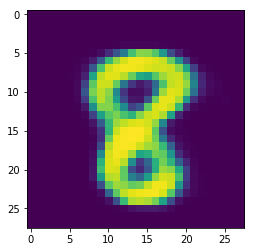

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  12



  0%|          | 1/214 [00:02<09:14,  2.60s/it]

[3 4 8 8 0 6 0 3 7 1 1 1 2 6 7 3 4 3 4 7 9 0 2 9 4 8 0 2 0 8 2 7 0 6 3 6 5
 9 6 8 8 6 5 9 2 3 7 3 7 1 8 7 8 4 1 3 4 0 9 4 5 7 9 3 6 3 1 7 4 9 8 1 4 8
 7 0 7 2 9 7 4 6 5 5 0 0 1 5 7 7 9 7 6 2 4 8 3 8 9 3 9 9 4 9 2 6 3 0 4 3 2
 2 0 1 4 0 7 5 6 7 0 2 0 4 5 0 6 0 7 0 1 9 3 7 4 2 3 0 4 5 1 5 8 6 7 1 1 3
 9 6 0 9 4 9 3 3 6 4 5 0 8 9 1 2 8 2 5 1 7 5 5 2 8 5 9 1 0 4 1 4 1 4 1 2 3
 2 2 8 4 9 5 6 2 0 8 8 2 4 3 9 0 8 3 2 2 7 1 4 4 7 6 5 8 6 7 8 6 8 1 5 8 5
 2 9 1 7 3 0 7 9 0 7 3 8 5 8 9 1 3 1 3 6 6 9 8 7 5 6 8 6 1 9 5 7 5 9]
[3 4 8 8 0 6 0 3 7 1 1 1 2 6 7 3 4 3 4 7 9 0 2 9 4 8 0 2 0 8 2 7 0 6 3 6 5
 9 6 8 8 6 5 9 2 3 7 3 7 1 8 7 8 4 1 3 4 0 9 4 5 7 9 3 6 3 1 7 4 9 8 1 4 8
 7 0 7 2 9 7 4 6 5 5 0 0 1 5 7 7 9 7 6 2 4 8 3 8 9 3 9 9 4 9 2 6 3 0 4 3 2
 2 0 1 4 0 7 5 6 7 0 2 0 4 5 0 6 0 7 0 1 9 3 7 4 2 3 0 4 5 1 5 8 6 7 1 1 3
 9 6 0 9 4 9 3 3 6 4 5 0 8 9 1 2 8 2 5 1 7 5 5 2 8 5 9 1 0 4 1 4 1 4 1 2 3
 2 2 8 4 9 5 6 2 0 8 8 2 4 3 9 0 8 3 2 2 7 1 4 4 7 6 5 8 6 7 8 6 8 1 5 8 5
 2 9 1 7 3 0 7 9 0 7 3 8 5 8 9


  1%|          | 2/214 [00:05<09:21,  2.65s/it]

[5 3 0 4 7 0 7 0 1 1 4 1 2 7 1 3 2 4 1 2 3 9 2 4 1 7 7 3 9 0 1 6 1 2 5 5 3
 2 4 5 8 0 0 5 8 4 7 9 5 9 7 7 8 0 8 5 9 7 4 6 3 1 8 2 2 9 1 4 7 0 1 0 0 6
 0 4 4 3 1 9 7 5 1 9 3 1 6 7 6 3 1 1 6 9 9 7 5 4 6 7 9 3 4 1 7 1 3 3 7 4 9
 5 6 5 0 7 5 1 5 0 6 2 1 4 1 2 9 5 4 1 1 6 1 1 8 4 6 2 3 8 8 9 4 7 0 0 4 5
 3 3 2 1 7 4 0 6 4 3 0 0 9 0 6 1 7 9 9 7 9 8 4 7 7 5 6 4 0 5 5 0 8 4 5 0 1
 2 5 3 5 8 3 7 0 6 9 9 4 2 6 8 6 5 6 0 5 2 9 9 0 8 2 6 9 6 4 1 0 7 1 0 9 3
 0 8 9 1 8 6 2 2 4 8 3 6 8 2 2 4 9 2 1 5 8 7 3 5 7 2 5 6 8 2 6 4 0 9]
[5 3 0 4 7 0 7 0 1 1 4 1 2 7 1 3 2 4 1 2 3 9 2 4 1 7 7 3 9 0 1 6 1 2 5 5 3
 2 4 5 8 0 0 5 8 4 7 9 5 9 7 7 8 0 8 5 9 7 4 6 3 1 8 2 2 9 1 4 7 0 1 0 0 6
 0 4 4 3 1 9 7 5 1 9 3 1 6 7 6 3 1 1 6 9 9 7 5 4 6 7 9 3 4 1 7 1 3 3 7 4 9
 5 6 5 0 7 5 1 5 0 6 2 1 4 1 2 9 5 4 1 1 6 1 1 8 4 6 2 3 8 8 9 4 7 0 0 4 5
 3 3 2 1 7 4 0 6 4 3 0 0 9 0 6 1 7 9 9 7 9 8 4 7 7 5 6 4 0 5 5 0 8 4 5 0 1
 2 5 3 5 8 3 7 0 6 9 9 4 2 6 8 6 5 6 0 5 2 9 9 0 8 2 6 9 6 4 1 0 7 1 0 9 3
 0 8 9 1 8 6 2 2 4 8 3 6 8 2 2


  1%|▏         | 3/214 [00:08<09:24,  2.68s/it]

[9 5 5 9 6 5 7 8 7 8 4 6 8 1 0 7 6 6 4 0 2 2 5 6 6 9 9 4 9 5 3 3 7 2 2 8 9
 1 6 5 6 5 6 6 6 3 2 1 2 5 1 7 2 1 6 4 1 8 2 9 6 5 2 4 5 1 3 2 4 4 9 3 6 5
 0 0 5 7 5 8 9 3 1 0 1 8 3 7 8 9 5 6 9 3 2 0 4 8 8 4 1 3 4 6 0 0 3 1 1 0 6
 9 5 0 4 4 0 1 4 1 0 8 2 5 4 2 1 0 8 2 9 6 6 5 2 0 0 2 1 6 8 9 1 6 1 4 3 0
 0 9 1 3 2 1 1 1 3 5 8 9 0 5 1 9 3 4 5 5 9 2 9 0 3 7 0 3 1 4 4 7 7 8 7 8 4
 2 2 7 2 6 0 9 6 4 0 8 9 6 9 4 6 0 2 1 0 5 4 4 0 0 1 9 5 1 0 5 4 6 0 6 2 9
 6 6 5 6 0 3 3 7 9 9 3 0 3 9 1 9 4 1 3 0 1 5 3 1 6 2 5 3 9 9 8 2 2 8]
[9 5 5 9 6 5 7 8 7 8 4 6 8 1 0 7 6 6 4 0 2 2 5 6 6 9 9 4 9 5 3 3 7 2 2 8 9
 1 6 5 6 5 6 6 6 3 2 1 2 5 1 7 2 1 6 4 1 8 2 9 6 5 2 4 5 1 3 2 4 4 9 3 6 5
 0 0 5 7 5 8 9 3 1 0 1 8 3 7 8 9 5 6 9 3 2 0 4 8 8 4 1 3 4 6 0 0 3 1 1 0 6
 9 5 0 4 4 0 1 4 1 0 8 2 5 4 2 1 0 8 2 9 6 6 5 2 0 0 2 1 6 8 9 1 6 1 4 3 0
 0 9 1 3 2 1 1 1 3 5 8 9 0 5 1 9 3 4 5 5 9 2 9 0 3 7 0 3 1 4 4 7 7 8 7 8 4
 2 2 7 2 6 0 9 6 4 0 8 9 6 9 4 6 0 2 1 0 5 4 4 0 0 1 9 5 1 0 5 4 6 0 6 2 9
 6 6 5 6 0 3 3 7 9 9 3 0 3 9 1


  2%|▏         | 4/214 [00:10<09:19,  2.67s/it]

[1 6 8 2 1 8 1 8 9 4 0 9 4 6 7 2 3 9 8 3 7 2 4 6 7 1 5 1 4 8 8 9 8 1 6 5 1
 8 6 6 6 6 5 6 1 0 2 9 0 0 4 8 0 3 0 2 1 3 2 9 0 0 0 2 0 2 2 7 3 4 0 1 7 8
 9 0 2 7 9 4 0 3 9 5 5 1 0 1 2 3 6 8 2 5 6 3 0 8 8 7 9 8 3 7 8 1 1 1 5 0 3
 5 5 3 1 7 3 2 9 6 6 4 6 7 8 0 8 5 9 8 8 4 4 3 2 1 9 7 7 8 5 1 4 4 5 3 3 6
 3 5 5 9 4 4 2 4 7 9 8 6 3 8 7 3 2 3 1 8 3 3 3 0 7 2 5 0 4 7 3 4 3 0 9 5 8
 8 4 3 0 9 6 7 9 3 8 1 4 9 1 8 4 4 3 5 8 9 7 5 7 4 0 3 2 3 8 9 4 6 0 3 3 1
 5 9 6 2 3 0 6 7 3 1 2 0 1 0 6 6 0 6 7 7 1 5 7 1 2 9 3 0 3 2 4 7 2 3]
[1 6 8 2 1 8 1 8 9 4 0 9 4 6 7 2 3 9 8 3 7 2 4 6 7 1 5 1 4 8 8 9 8 1 6 5 1
 8 6 6 6 6 5 6 1 0 2 9 0 0 4 8 0 3 0 2 1 3 2 9 0 0 0 2 0 2 2 7 3 4 0 1 7 8
 9 0 2 7 9 4 0 3 9 5 5 1 0 1 2 3 6 8 2 5 6 3 0 8 8 7 9 8 3 7 8 1 1 1 5 0 3
 5 5 3 1 7 3 2 9 6 6 4 6 7 8 0 8 5 9 8 8 4 4 3 2 1 9 7 7 8 5 1 4 4 5 3 3 6
 3 5 5 9 4 4 2 4 7 9 8 6 3 8 7 3 2 3 1 8 3 3 3 0 7 2 5 0 4 7 3 4 3 0 9 5 8
 8 4 3 0 9 6 7 9 3 8 1 4 9 1 8 4 4 3 5 8 9 7 5 7 4 0 3 2 3 8 9 4 6 0 3 3 1
 5 9 6 2 3 0 6 7 3 1 2 0 1 0 6


  2%|▏         | 5/214 [00:13<09:19,  2.68s/it]

[4 4 9 7 2 2 3 1 4 4 0 8 2 3 4 8 2 7 8 5 4 7 7 3 8 9 7 7 8 7 4 4 6 2 9 9 0
 7 9 1 5 5 9 7 3 8 1 0 4 1 2 7 3 1 9 0 5 2 3 6 9 1 7 4 6 4 0 6 3 9 4 6 1 6
 9 3 2 1 1 3 9 2 1 3 7 0 5 3 2 3 0 0 1 6 7 8 6 4 0 2 8 5 0 1 0 7 5 7 0 4 1
 8 9 5 8 4 6 9 4 2 0 3 2 7 1 9 7 1 0 4 9 1 6 2 2 1 9 4 9 2 9 9 0 6 3 5 6 3
 8 7 2 4 2 2 6 4 8 9 7 8 9 1 0 2 5 0 3 1 0 2 5 7 0 3 3 2 8 2 2 1 4 6 0 9 7
 9 5 4 7 2 4 8 5 0 5 2 6 7 4 9 7 3 7 4 5 6 8 0 1 7 9 7 7 0 6 3 9 3 9 3 1 8
 7 6 5 6 3 4 3 7 1 1 7 7 7 3 6 6 8 0 2 6 0 6 9 5 3 1 4 3 9 8 2 3 3 9]
[4 4 9 7 2 2 3 1 4 4 0 8 2 3 4 8 2 7 8 5 4 7 7 3 8 9 7 7 8 7 4 4 6 2 9 9 0
 7 9 1 5 5 9 7 3 8 1 0 4 1 2 7 3 1 9 0 5 2 3 6 9 1 7 4 6 4 0 6 3 9 4 6 7 6
 9 3 2 1 1 3 9 2 1 3 7 0 5 3 2 3 0 0 1 6 7 8 6 4 0 2 8 5 0 1 0 7 5 7 0 4 1
 8 9 5 8 4 6 9 4 2 0 3 2 7 1 9 7 1 0 4 9 1 6 2 2 1 9 4 9 2 9 9 0 6 3 5 6 3
 8 7 2 4 2 2 6 4 8 9 7 8 9 1 0 2 5 0 3 1 0 2 5 7 0 3 3 2 8 2 2 1 4 6 0 9 7
 9 5 4 7 2 4 8 5 0 5 2 6 7 4 9 7 3 7 4 5 6 8 0 1 7 9 7 7 0 6 3 9 3 9 3 1 8
 7 6 5 6 3 4 3 7 1 1 7 7 7 3 6


  3%|▎         | 6/214 [00:15<09:09,  2.64s/it]

[8 2 6 8 3 2 6 8 5 4 6 0 7 8 6 2 4 8 8 3 2 1 4 6 0 3 8 3 5 2 5 0 8 8 6 2 6
 2 9 7 1 9 9 9 8 6 7 6 9 2 8 7 4 5 0 8 9 8 5 6 4 0 6 5 5 3 8 1 3 9 2 3 1 2
 3 3 4 5 3 7 4 2 2 9 6 3 4 8 5 4 7 1 1 0 5 4 8 7 3 2 8 1 5 8 7 3 5 1 2 5 1
 0 5 3 1 7 0 4 9 9 5 3 0 2 9 1 3 6 2 4 4 5 7 0 7 2 9 7 1 7 6 2 6 7 5 1 4 4
 7 6 1 0 9 6 9 0 0 8 8 0 8 1 6 1 4 9 6 9 1 6 9 0 9 8 3 9 8 6 8 5 8 7 9 3 7
 1 5 6 9 3 2 3 5 2 1 3 9 7 8 1 9 8 2 6 9 5 2 7 5 1 0 3 0 4 3 4 3 5 2 4 5 6
 4 1 3 8 1 4 7 5 2 8 5 0 4 2 0 2 0 4 1 8 1 6 0 1 4 9 8 9 3 0 2 9 8 3]
[8 2 6 8 3 2 6 8 5 4 6 0 7 8 6 2 4 8 8 3 2 1 4 6 0 3 8 3 5 2 5 0 8 8 6 2 6
 2 9 7 1 9 9 9 8 6 7 6 9 2 8 7 4 5 0 8 9 8 5 6 4 0 6 5 5 3 8 1 3 9 2 3 1 2
 3 3 4 5 3 7 4 2 2 9 6 3 4 8 5 4 7 1 1 0 5 4 8 7 3 2 8 1 5 8 7 3 5 1 2 5 1
 0 5 3 1 7 0 4 9 9 5 3 0 2 9 1 3 6 2 4 4 5 7 0 7 2 9 7 1 7 6 2 6 7 5 1 4 4
 7 6 1 0 9 6 9 0 0 8 8 0 8 1 6 1 4 9 6 9 1 6 9 0 9 8 3 9 8 6 8 5 8 7 9 3 7
 1 5 6 9 3 2 3 5 2 1 3 9 7 8 1 9 8 2 6 9 5 2 7 5 1 0 3 0 4 3 4 3 5 2 4 5 6
 4 1 3 8 1 4 7 5 2 8 5 0 4 2 0


  3%|▎         | 7/214 [00:18<08:55,  2.59s/it]

[8 9 4 4 6 0 5 0 1 0 1 1 1 3 8 5 5 9 5 0 5 1 7 6 7 9 3 2 7 2 3 0 0 7 4 4 0
 1 9 7 7 2 6 8 8 7 4 2 6 8 0 6 3 5 6 1 0 4 0 6 7 3 3 0 1 5 2 4 1 1 0 6 3 2
 9 3 8 2 7 7 8 2 8 7 6 4 0 4 9 8 0 3 0 1 5 7 1 5 0 4 1 5 3 8 4 0 9 6 6 2 2
 8 0 7 0 6 7 5 8 5 8 1 9 2 6 6 9 9 8 4 3 1 1 5 1 8 9 4 3 9 5 6 6 4 3 3 7 2
 4 9 5 3 3 5 8 4 2 3 4 0 0 1 6 0 1 1 5 0 6 1 7 9 9 5 6 4 0 3 6 3 9 9 5 2 0
 6 8 1 9 7 8 9 2 6 8 0 2 2 0 9 4 5 0 8 1 9 4 9 2 6 1 8 7 2 8 9 5 0 9 6 3 3
 7 2 7 3 2 8 0 2 5 5 4 5 6 9 7 9 9 4 6 1 7 8 1 8 2 6 9 3 9 7 7 5 3 8]
[8 9 4 4 6 0 5 0 1 0 1 1 1 3 8 5 5 9 5 0 5 1 7 6 7 9 3 2 7 2 3 0 0 7 4 4 0
 1 9 7 7 2 6 8 8 7 4 2 6 8 0 6 3 5 6 1 0 4 0 6 7 3 3 0 1 5 2 4 1 1 0 6 3 2
 9 3 8 2 7 7 8 2 8 7 6 4 0 4 9 8 0 3 0 1 5 7 1 5 0 4 1 5 3 8 4 0 9 6 6 2 2
 8 0 7 0 6 7 5 8 5 8 1 9 2 6 6 9 9 8 4 3 1 1 5 1 8 9 4 3 9 5 6 6 4 3 3 7 2
 4 9 5 3 3 5 8 4 2 3 4 0 0 1 6 0 1 1 5 0 6 1 7 9 9 5 6 4 0 3 6 3 9 9 5 2 0
 6 8 1 9 7 8 9 2 6 8 0 2 2 0 9 4 5 0 8 1 9 4 9 2 6 1 8 7 2 8 9 5 0 9 6 3 3
 7 2 7 3 2 8 0 2 5 5 4 5 6 9 7


  4%|▎         | 8/214 [00:20<08:42,  2.53s/it]

[2 4 6 3 9 8 6 7 3 4 0 7 3 0 6 8 0 5 3 6 7 8 4 0 1 9 2 9 5 0 2 7 4 8 3 3 1
 7 7 8 2 7 2 4 5 2 7 6 4 0 8 1 7 7 5 3 2 6 7 7 4 0 3 3 1 7 0 1 9 1 5 1 7 4
 4 1 9 3 3 9 4 8 4 4 2 0 7 8 9 3 3 6 3 8 6 1 7 8 8 6 0 7 1 1 2 5 0 5 3 1 2
 3 8 6 8 2 3 7 3 7 4 9 0 4 4 2 1 6 3 6 7 9 7 9 5 6 6 1 1 8 8 5 4 0 2 2 7 2
 6 4 0 1 6 0 2 3 5 5 5 8 5 0 4 3 3 2 3 7 5 2 9 5 8 3 8 3 3 5 1 2 0 4 2 6 5
 5 5 8 6 9 1 1 2 8 1 2 1 1 5 1 0 6 6 9 6 7 5 4 9 5 7 1 3 9 2 1 5 7 6 1 5 3
 5 7 8 7 3 2 0 8 7 0 7 2 1 6 4 7 1 1 3 5 1 0 0 4 8 6 3 6 0 2 8 0 8 4]
[2 4 6 3 9 8 6 7 3 4 0 7 3 0 6 8 0 5 3 6 7 8 4 0 1 9 2 9 5 0 2 7 4 8 3 3 1
 7 7 8 2 7 2 4 5 2 7 6 4 0 8 1 7 7 5 3 2 6 7 7 4 0 3 3 1 7 0 1 9 1 5 1 7 4
 4 1 9 3 3 9 4 8 4 4 2 0 7 8 9 3 3 6 3 8 6 1 7 8 8 6 0 7 1 1 2 5 0 5 3 1 2
 3 8 6 8 2 3 7 3 7 4 9 0 4 4 2 1 6 3 6 7 9 7 9 5 6 6 1 1 8 8 5 4 0 2 2 7 2
 6 4 0 1 6 0 2 3 5 5 5 8 5 0 4 3 3 2 3 7 5 2 9 5 8 3 8 3 3 5 1 2 0 4 2 6 5
 5 5 8 6 9 1 1 2 8 1 2 1 1 5 1 0 6 6 9 6 7 5 4 9 5 7 1 3 9 2 1 5 7 6 1 5 3
 5 7 8 7 3 2 0 8 7 0 7 2 1 6 4


  4%|▍         | 9/214 [00:22<08:31,  2.49s/it]

[4 6 6 3 1 6 2 9 6 8 7 6 3 0 2 4 1 7 9 9 6 9 9 3 5 6 1 2 6 7 3 8 8 4 2 4 1
 9 7 4 5 8 6 6 8 0 8 8 3 3 4 2 4 3 3 2 1 3 0 3 7 5 6 7 4 0 4 0 2 5 7 5 2 0
 4 0 5 1 8 9 9 9 9 6 1 1 2 2 6 0 5 2 6 2 2 8 3 9 4 4 4 8 5 7 7 4 5 3 7 5 6
 0 8 0 7 8 6 1 5 5 4 1 6 4 1 6 9 3 7 6 6 7 1 4 9 9 8 3 3 8 8 7 4 9 9 3 4 8
 1 4 9 2 9 2 3 2 9 5 4 3 8 3 3 4 5 8 9 6 2 2 2 7 6 3 5 1 0 1 9 5 4 7 7 1 9
 6 8 1 0 7 6 7 7 2 8 4 7 2 5 5 9 5 7 1 7 1 3 7 6 0 9 9 8 9 0 6 6 4 7 6 5 7
 1 3 8 6 4 0 0 2 0 0 5 8 0 7 7 9 4 7 0 7 6 0 1 1 0 8 1 5 7 6 4 6 7 9]
[4 6 6 3 1 6 2 9 6 8 7 6 3 0 2 4 1 7 9 9 6 9 9 3 5 6 1 2 6 7 3 8 8 4 2 4 1
 9 7 4 5 8 6 6 8 0 8 8 3 3 4 2 4 3 3 2 1 3 0 3 7 5 6 7 4 0 4 0 2 5 7 5 2 0
 4 0 5 1 8 9 9 9 9 6 1 1 2 2 6 0 5 2 6 2 2 8 3 9 4 4 4 8 5 7 7 4 5 3 7 5 6
 0 8 0 7 8 6 1 5 5 4 1 6 4 1 6 9 3 7 6 6 7 1 4 9 9 8 3 3 8 8 7 4 9 9 3 4 8
 1 4 9 2 9 2 3 2 9 5 4 3 8 3 3 4 5 8 9 6 2 2 2 7 6 3 5 1 0 1 9 5 4 7 7 1 9
 6 8 1 0 7 6 7 7 2 8 4 7 2 5 5 9 5 7 1 7 1 3 7 6 0 9 9 8 9 0 6 6 4 7 6 5 7
 1 3 8 6 4 0 0 2 0 0 5 8 0 7 7


  5%|▍         | 10/214 [00:24<08:21,  2.46s/it]

[8 5 6 7 9 6 4 5 8 7 5 2 4 3 3 5 0 2 8 9 8 0 9 1 8 3 9 8 4 0 5 7 6 1 4 1 6
 5 1 5 6 0 4 3 2 8 9 2 1 3 1 3 4 9 1 0 0 8 8 2 0 0 3 9 0 3 3 2 1 3 4 1 4 6
 5 5 2 2 1 1 3 7 5 1 1 8 6 4 1 1 7 4 2 0 6 2 2 6 4 4 9 0 9 6 5 2 0 5 1 0 3
 7 3 5 1 6 1 8 3 4 6 4 0 8 4 7 4 8 1 8 6 7 8 5 8 3 5 3 6 4 3 0 6 1 2 3 9 0
 2 6 7 4 9 5 1 5 2 7 0 6 1 0 4 3 4 3 5 9 1 2 9 2 4 2 1 4 5 6 6 2 5 6 7 5 3
 8 2 1 8 9 9 0 9 1 2 7 3 7 6 2 1 3 7 7 1 3 3 6 1 6 9 2 0 2 7 4 9 8 1 8 7 6
 4 5 7 6 9 9 4 2 3 3 7 7 6 7 3 3 6 2 0 2 3 1 7 3 4 7 1 9 7 1 2 4 5 9]
[8 5 6 7 9 6 4 5 8 7 5 2 4 3 3 5 0 2 8 9 8 0 9 1 8 3 9 8 4 0 5 7 6 1 4 1 6
 5 1 5 6 0 4 3 2 8 9 2 1 3 1 3 4 9 1 0 0 8 8 2 0 0 3 9 0 3 3 2 1 3 4 1 4 6
 5 5 2 2 1 1 3 7 5 1 1 8 6 4 1 1 7 4 2 0 6 2 2 6 4 4 9 0 9 6 5 2 0 5 1 0 3
 7 3 5 1 6 1 8 3 4 6 4 0 8 4 7 4 8 1 8 6 7 8 5 8 3 5 3 6 4 3 0 6 1 2 3 9 0
 2 6 7 4 9 5 1 5 2 7 0 6 1 0 4 3 4 3 5 9 1 2 9 2 4 2 1 4 5 6 6 2 5 6 7 5 3
 8 2 1 8 9 9 0 9 1 2 7 3 7 6 2 1 3 7 7 1 3 3 6 1 6 9 2 0 2 7 4 9 8 1 8 7 6
 4 5 7 6 9 9 4 2 3 3 7 7 6 7 3


  5%|▌         | 11/214 [00:26<08:13,  2.43s/it]

[3 9 5 8 1 6 9 9 8 6 2 3 0 3 4 9 3 3 3 5 0 7 1 0 5 7 1 3 3 4 1 8 9 7 4 4 6
 3 3 5 4 6 4 2 8 6 7 6 3 9 1 4 1 2 5 9 7 7 5 9 3 3 7 6 1 4 7 2 0 8 7 8 0 6
 1 4 0 4 2 9 6 0 5 3 1 5 1 2 4 2 7 6 8 2 3 4 0 4 9 7 0 7 9 9 4 8 4 4 1 5 2
 3 3 6 2 8 3 8 4 1 7 0 9 8 1 9 3 2 0 8 2 6 6 1 5 6 7 9 1 8 6 0 7 1 1 3 6 2
 7 0 1 8 9 0 9 7 2 9 4 2 0 2 3 0 6 4 5 6 5 6 7 7 0 7 9 8 2 3 7 4 9 8 1 5 3
 0 1 5 2 9 9 6 2 8 8 9 8 0 5 6 1 9 6 9 1 8 9 9 7 0 4 2 4 1 4 6 0 7 1 2 6 6
 8 2 0 3 2 1 2 6 7 5 7 4 2 2 0 3 1 7 4 9 1 9 9 0 2 9 9 0 8 1 8 4 1 2]
[3 9 5 8 1 6 9 9 8 6 2 3 0 3 4 9 3 3 3 5 0 7 1 0 5 7 1 3 3 4 1 8 9 7 4 4 6
 3 3 5 4 6 4 2 8 6 7 6 3 9 1 4 1 2 5 9 7 7 5 9 3 3 7 6 1 4 7 2 0 8 7 8 0 6
 1 4 0 4 2 9 6 0 5 3 1 5 1 2 4 2 7 6 8 2 3 4 0 4 9 7 0 7 9 9 4 8 4 4 1 5 2
 3 3 6 2 8 3 8 4 1 7 0 9 8 1 9 3 2 0 8 2 6 6 1 5 6 7 9 1 8 6 0 7 1 1 3 6 2
 7 0 1 8 9 0 9 7 2 9 4 2 0 2 3 0 6 4 5 6 5 6 7 7 0 7 9 8 2 3 7 4 9 8 1 5 3
 0 1 5 2 9 9 6 2 8 8 9 8 0 5 6 1 9 6 9 1 8 9 9 7 0 4 2 4 1 4 6 0 7 1 2 6 6
 8 2 0 3 2 1 2 6 7 5 7 4 2 2 0


  6%|▌         | 12/214 [00:28<08:06,  2.41s/it]

[9 9 0 4 3 4 6 5 7 9 6 1 2 1 8 2 9 1 4 5 3 0 1 0 4 0 2 2 6 8 1 5 8 2 7 9 6
 1 5 0 7 4 6 0 4 8 0 5 0 1 1 9 9 1 5 8 6 8 5 8 3 4 8 2 2 8 8 0 5 7 6 4 0 3
 1 3 1 9 5 2 5 3 8 5 0 2 1 6 6 4 4 8 3 2 5 1 1 5 8 8 0 1 5 4 1 4 3 9 2 4 6
 4 9 9 0 0 8 2 2 2 5 3 0 8 6 8 7 4 2 0 5 4 2 2 2 5 5 9 0 4 4 0 5 5 9 5 7 0
 7 3 4 2 5 9 3 1 7 9 8 8 2 1 0 5 1 4 3 4 7 0 2 2 0 7 2 4 2 2 9 1 2 7 8 4 6
 5 9 1 4 1 1 0 5 6 4 8 9 3 7 5 0 5 9 0 2 6 1 7 3 4 3 7 4 2 4 8 0 8 4 1 6 7
 5 8 6 1 4 2 5 4 9 1 1 1 5 6 0 3 1 3 8 0 2 6 1 1 4 6 0 3 9 9 3 7 8 1]
[9 9 0 4 3 4 6 5 7 9 6 1 2 1 8 2 9 1 4 5 3 0 1 0 4 0 2 2 6 8 1 5 8 2 7 9 6
 1 5 0 7 4 6 0 4 8 0 5 0 1 1 9 9 1 5 8 6 8 5 8 3 4 8 2 2 8 8 0 5 7 6 4 0 3
 1 3 1 9 5 2 5 3 8 5 0 2 1 6 6 4 4 8 3 2 5 1 1 5 8 8 0 1 5 4 1 4 3 9 2 4 6
 4 9 9 0 0 8 2 2 2 5 3 0 8 6 8 7 4 2 0 5 4 2 2 2 5 5 9 0 4 4 0 5 5 9 5 7 0
 7 3 4 2 5 9 3 1 7 9 8 8 2 1 0 5 1 4 3 4 7 0 2 2 0 7 2 4 2 2 9 1 2 7 8 4 6
 5 9 1 4 1 1 0 5 6 4 8 9 3 7 5 0 5 9 0 2 6 1 7 3 4 3 7 4 2 4 8 0 8 4 1 6 7
 5 8 6 1 4 2 5 4 9 1 1 1 5 6 0


  6%|▌         | 13/214 [00:31<08:00,  2.39s/it]

[1 2 8 6 5 1 6 1 8 7 1 1 3 7 7 4 6 0 3 1 2 3 5 5 3 9 4 5 7 9 2 8 4 2 8 4 9
 7 2 5 9 5 9 1 3 3 3 6 8 3 9 7 3 3 4 9 4 3 0 3 8 4 0 5 9 7 5 7 5 7 2 2 5 7
 9 6 6 7 4 4 9 6 6 1 8 1 8 6 6 8 4 1 4 0 2 0 4 2 6 8 1 5 7 1 3 9 1 7 5 9 9
 9 6 7 9 3 0 0 3 8 7 6 3 4 8 2 8 3 1 8 8 3 8 3 2 7 6 5 4 8 3 3 1 0 6 5 7 5
 2 0 1 9 3 6 2 0 6 0 8 6 8 1 3 9 0 7 4 5 9 4 6 1 2 7 6 1 5 4 1 5 2 8 8 1 3
 1 7 1 2 1 0 1 5 9 9 6 2 1 8 1 6 2 4 3 4 8 3 5 2 1 4 9 8 0 6 0 7 2 3 8 5 1
 3 2 5 7 8 7 7 5 2 5 6 1 7 0 5 7 3 4 2 6 2 7 0 0 8 3 8 0 7 9 1 9 2 3]
[1 2 8 6 5 1 6 1 8 7 1 1 3 7 7 4 6 0 3 1 2 3 5 5 3 9 4 5 7 9 2 8 4 2 8 4 9
 7 2 5 9 5 9 1 3 3 3 6 8 3 9 7 3 3 4 9 4 3 0 3 8 4 0 5 9 7 5 7 5 7 2 2 5 7
 9 6 6 7 4 4 9 6 6 1 8 1 8 6 6 8 4 1 4 0 2 0 4 2 6 8 1 5 7 1 3 9 1 7 5 9 9
 9 6 7 9 3 0 0 3 8 7 6 3 4 8 2 8 3 1 8 8 3 8 3 2 7 6 5 4 8 3 3 1 0 6 5 7 5
 2 0 1 9 3 6 2 0 6 0 8 6 8 1 3 9 0 7 4 5 9 4 6 1 2 7 6 1 5 4 1 5 2 8 8 1 3
 1 7 1 2 1 0 1 5 9 9 6 2 1 8 1 6 2 4 3 4 8 3 5 2 1 4 9 8 0 6 0 7 2 3 8 5 1
 3 2 5 7 8 7 7 5 2 5 6 1 7 0 5


  7%|▋         | 14/214 [00:33<07:55,  2.38s/it]

[5 4 1 6 0 6 0 1 9 0 6 3 1 1 3 3 2 5 6 1 4 9 4 9 4 8 5 6 7 3 3 8 1 3 9 0 2
 0 1 3 9 3 1 8 4 4 9 4 2 0 5 5 3 5 7 8 1 3 4 0 3 8 7 6 5 9 0 8 1 7 3 6 4 9
 8 9 3 3 4 0 8 9 5 7 5 0 8 3 9 4 1 2 2 4 2 1 7 7 4 9 3 2 1 7 0 0 3 9 8 2 6
 3 2 2 4 1 2 8 2 6 3 9 7 8 7 4 8 7 7 5 3 7 0 5 6 9 5 6 7 5 0 8 0 1 7 2 7 3
 0 7 4 7 4 9 3 7 6 9 9 3 5 5 3 1 0 3 2 9 3 7 9 6 7 2 0 4 7 1 2 5 7 8 7 4 7
 8 1 9 2 6 8 4 1 8 9 3 2 5 4 2 2 4 3 9 0 7 1 3 9 1 6 7 2 2 7 2 1 5 6 0 6 3
 5 7 6 7 3 3 8 3 5 1 3 5 9 5 2 1 0 7 0 7 9 9 3 0 9 6 6 7 6 4 5 2 9 6]
[5 4 1 6 0 6 0 1 9 0 6 3 1 1 3 3 2 5 6 1 4 9 4 9 4 8 5 6 7 3 3 8 1 3 9 0 2
 0 1 3 9 3 1 8 4 4 9 4 2 0 5 5 3 5 7 8 1 3 4 0 3 8 7 6 5 9 0 8 1 7 3 6 4 9
 8 9 3 3 4 0 8 9 5 7 5 0 8 3 9 4 1 2 2 4 2 1 7 7 4 9 3 2 1 7 0 0 3 9 8 2 6
 3 2 2 4 1 1 8 2 6 3 9 7 8 7 4 8 7 7 5 3 7 0 5 6 9 5 6 7 5 0 8 0 1 7 2 7 3
 0 7 4 7 4 9 3 7 6 9 9 3 5 5 3 1 0 3 2 9 3 7 9 6 7 2 0 4 7 1 2 5 7 8 7 4 7
 8 1 9 2 6 8 4 1 8 9 3 2 5 4 2 7 4 3 9 0 7 1 3 9 1 6 7 2 2 7 2 1 5 6 0 6 3
 5 7 6 7 3 3 8 3 5 1 3 5 9 5 2


  7%|▋         | 15/214 [00:35<07:50,  2.37s/it]

[7 2 4 3 8 2 2 0 1 1 9 8 6 2 2 1 0 8 3 4 7 0 7 9 9 3 7 1 8 6 1 1 9 2 7 0 7
 4 9 6 8 5 1 4 6 3 3 3 9 0 9 2 4 3 3 4 4 3 1 0 5 6 1 6 3 5 1 8 4 3 8 2 5 9
 3 8 9 6 2 0 4 6 3 9 0 9 1 7 1 5 5 6 8 7 3 1 4 4 6 4 1 3 6 4 0 0 5 0 3 4 2
 4 8 8 4 1 7 3 4 5 5 8 9 6 4 3 5 3 8 9 6 9 4 6 6 3 1 4 0 8 4 7 0 8 5 6 1 3
 9 4 7 3 5 4 2 7 0 6 4 2 4 2 4 0 1 1 4 9 5 2 2 5 1 0 1 7 4 7 5 3 0 6 4 3 1
 7 5 3 0 7 1 4 0 3 5 2 3 9 4 8 9 9 1 6 1 7 0 5 5 3 4 3 1 7 6 0 7 6 8 1 5 5
 2 5 6 3 1 8 3 1 2 2 9 0 6 4 6 2 2 8 7 2 1 6 7 3 0 0 7 5 6 0 2 2 2 8]
[7 2 4 3 8 2 2 0 1 1 9 8 6 2 2 1 0 8 3 4 7 0 7 9 9 3 7 1 8 6 1 1 9 2 7 0 7
 4 9 6 8 5 1 4 6 3 3 3 9 0 9 2 4 3 3 4 4 3 1 0 5 6 1 6 3 5 1 8 4 3 8 2 5 9
 3 8 9 6 2 0 4 6 3 9 0 9 1 7 1 5 5 6 8 7 3 1 4 4 6 4 1 3 6 4 0 0 5 0 3 4 2
 4 8 8 4 1 7 3 4 5 5 8 9 6 4 3 5 3 8 9 6 9 4 6 6 3 1 4 0 8 4 7 0 8 5 6 1 3
 9 4 7 3 5 4 2 7 0 6 4 2 4 2 4 0 1 1 4 9 5 2 2 5 1 0 1 7 4 7 5 3 0 6 4 3 1
 7 5 3 0 7 1 4 0 3 5 2 3 9 4 8 9 9 1 6 1 7 0 5 5 3 4 3 1 7 6 0 7 6 8 1 5 5
 2 5 6 3 1 8 3 1 2 2 9 0 6 4 6


  7%|▋         | 16/214 [00:37<07:46,  2.36s/it]

[5 7 4 6 6 0 3 2 0 6 2 1 1 7 2 8 7 8 0 5 8 2 0 8 9 7 8 2 3 8 3 4 3 5 5 8 7
 5 9 4 9 8 0 6 5 7 0 1 0 4 1 9 9 3 0 3 5 6 5 9 3 8 9 6 3 2 1 2 6 1 0 8 3 9
 7 0 9 6 6 1 6 7 4 3 8 8 5 2 3 5 7 7 2 1 0 3 0 0 4 1 9 8 3 2 5 1 4 0 2 6 3
 4 6 6 1 7 2 3 0 3 4 7 5 2 0 8 7 4 3 9 7 6 6 3 1 5 1 3 9 3 9 2 1 5 8 8 1 0
 6 6 9 0 0 2 0 7 1 5 4 1 3 0 9 3 5 8 1 3 4 7 7 6 6 5 3 5 1 1 5 9 8 8 3 0 8
 2 3 8 7 2 9 4 1 1 1 1 2 6 7 8 6 2 9 1 0 0 9 1 4 3 5 3 8 0 8 9 0 2 8 1 7 2
 4 5 2 7 1 6 1 7 3 4 9 8 2 6 5 2 9 1 5 0 7 5 2 4 4 6 3 2 9 9 0 3 2 3]
[5 7 4 6 6 0 3 2 0 6 2 1 1 7 2 8 7 8 0 5 8 2 0 8 9 7 8 2 3 8 3 4 3 5 5 8 7
 5 9 4 9 8 0 6 5 7 0 1 0 4 1 9 9 3 0 3 5 6 5 9 3 8 9 6 3 2 1 2 6 1 0 8 3 9
 7 0 9 6 6 1 6 7 4 3 8 8 5 2 3 5 7 7 2 1 0 3 0 0 4 1 9 8 3 2 5 1 4 0 2 6 3
 4 6 6 1 7 2 3 0 3 4 7 5 2 0 8 7 4 3 9 7 6 6 3 1 5 1 3 9 3 9 2 1 5 8 8 1 0
 6 6 9 0 0 2 0 7 1 5 4 1 3 0 9 3 5 8 1 3 4 7 7 6 6 5 3 5 1 1 5 9 8 8 3 0 8
 2 3 8 7 2 9 4 1 1 1 1 2 6 7 8 6 2 9 1 0 0 9 1 4 3 5 3 8 0 8 9 0 2 8 1 7 2
 4 5 2 7 1 6 1 7 3 4 9 8 2 6 5


  8%|▊         | 17/214 [00:39<07:42,  2.35s/it]

[1 1 7 4 1 6 4 0 5 0 5 0 6 8 0 0 2 1 4 1 9 8 9 2 1 0 9 7 4 6 2 5 0 1 1 2 6
 1 1 2 7 3 1 6 1 0 1 1 4 8 9 0 9 5 7 9 0 3 6 2 4 6 0 3 6 5 0 4 2 6 1 1 3 6
 2 2 8 8 1 6 1 5 9 2 8 5 8 9 6 9 7 0 4 4 6 7 9 1 4 4 3 9 3 6 8 1 7 1 6 0 0
 7 4 3 8 4 8 2 1 2 5 4 6 8 4 4 4 0 2 7 9 5 0 0 1 2 3 9 0 7 7 9 9 2 9 4 3 7
 9 5 5 5 9 0 9 0 5 3 5 3 2 7 9 6 5 4 8 5 9 0 7 1 1 8 3 7 4 3 6 4 4 8 3 0 2
 7 6 1 2 0 3 4 0 5 3 1 7 8 8 0 9 3 1 4 9 0 2 6 2 1 9 1 1 0 0 7 5 1 1 7 2 8
 8 2 6 2 4 5 5 7 7 6 0 5 1 4 7 4 6 4 9 6 7 4 0 1 4 6 4 6 4 9 2 9 7 9]
[1 1 7 4 1 6 4 0 5 0 5 0 6 8 0 0 2 1 4 1 9 8 9 2 1 0 9 7 4 6 2 5 0 1 1 2 6
 1 1 2 1 3 1 6 1 0 1 1 4 8 9 0 9 5 7 9 0 3 6 2 4 6 0 3 6 5 0 4 2 6 1 1 3 6
 2 2 8 8 1 6 1 5 9 2 8 5 8 9 6 9 7 0 4 4 6 7 9 1 4 4 3 9 3 6 8 1 7 1 6 0 0
 7 4 3 8 4 8 2 1 2 5 4 6 8 4 4 4 0 2 7 9 5 0 0 1 2 3 9 0 7 7 9 9 2 9 4 3 7
 9 5 5 5 9 0 9 0 5 3 5 3 2 7 9 6 5 4 8 5 9 0 7 1 1 8 3 7 4 3 6 4 4 8 3 0 2
 7 6 1 2 0 3 4 0 5 3 1 7 8 8 0 9 3 1 4 9 0 2 6 2 1 9 1 1 0 0 7 5 1 1 7 2 8
 8 2 6 2 4 5 5 7 7 6 0 5 1 4 7


  8%|▊         | 18/214 [00:42<07:39,  2.34s/it]

[9 5 1 9 3 5 3 6 8 9 2 9 3 8 3 0 4 6 3 9 3 6 7 9 3 3 7 5 8 6 5 2 8 8 1 2 0
 6 0 7 7 2 8 7 5 1 3 3 9 5 5 7 1 4 1 2 1 7 2 9 6 8 6 2 4 0 2 1 3 3 4 8 7 0
 8 0 2 6 3 9 8 4 0 4 3 8 7 3 9 1 7 5 1 8 5 7 9 5 9 9 4 6 0 9 1 1 9 8 3 5 2
 3 6 7 4 9 8 4 7 8 7 4 1 2 6 3 5 9 6 9 7 1 6 0 5 7 3 9 0 3 9 5 9 5 9 2 0 2
 2 5 8 7 0 4 8 8 2 5 7 2 0 8 0 6 7 5 9 7 8 4 0 0 2 1 7 9 6 7 4 5 2 7 7 2 6
 7 3 4 9 3 2 7 0 7 4 9 4 9 1 4 9 9 4 2 3 6 9 9 6 5 1 7 2 3 7 0 3 8 8 6 9 7
 1 4 5 7 7 9 1 0 7 3 3 5 9 0 4 3 7 4 9 9 0 4 2 7 1 9 1 2 3 2 0 3 5 1]
[9 5 1 9 3 5 3 6 8 9 2 9 3 8 3 0 4 6 3 9 3 6 7 9 3 3 7 5 8 6 5 2 8 8 1 2 0
 6 0 7 7 2 8 7 5 1 3 3 9 5 5 7 1 4 1 2 1 7 2 9 6 8 6 2 4 0 2 1 3 3 4 8 7 0
 8 0 2 6 3 9 8 4 0 4 3 8 7 3 9 1 7 5 1 8 5 7 9 5 9 9 4 6 0 9 1 1 9 8 3 5 2
 3 6 7 4 9 8 4 7 8 7 4 1 2 6 3 5 9 6 9 7 1 6 0 5 7 3 9 0 3 9 5 9 5 9 2 0 2
 2 5 8 7 0 4 8 8 2 5 7 2 0 8 0 6 7 5 9 7 8 4 0 0 2 1 7 9 6 7 4 5 2 7 7 2 6
 7 3 4 9 3 2 7 0 7 4 9 4 9 1 4 9 9 4 2 3 6 9 9 6 5 1 7 2 3 7 0 3 8 8 6 9 7
 1 4 5 7 7 9 1 0 7 3 3 5 9 0 4


  9%|▉         | 19/214 [00:44<07:36,  2.34s/it]

[7 1 3 6 5 6 1 3 2 9 5 6 5 7 9 7 1 6 9 2 0 3 2 8 8 0 6 1 1 8 5 0 5 9 2 2 7
 2 1 0 8 6 6 7 7 4 0 5 2 8 6 6 9 3 9 6 1 9 1 5 4 9 8 7 9 1 9 9 9 5 1 2 3 0
 4 3 1 1 8 6 9 5 9 9 3 4 1 2 1 6 9 8 6 7 6 9 6 6 7 9 9 3 1 9 7 6 2 2 6 8 7
 8 0 9 2 9 8 7 7 5 5 1 0 8 1 9 8 6 3 4 1 1 9 7 0 8 6 8 9 1 8 8 5 0 5 0 1 6
 1 1 4 8 7 7 0 7 9 0 1 6 7 8 1 5 0 7 6 0 4 7 1 3 8 6 7 4 9 1 6 4 0 0 8 6 5
 3 5 3 6 3 1 8 7 5 8 5 2 7 3 0 4 5 9 1 7 0 1 1 8 1 5 8 5 4 3 7 2 0 4 1 2 3
 0 0 1 4 0 5 0 0 8 3 8 6 7 0 2 5 2 0 6 2 0 9 2 2 3 2 4 0 5 9 1 3 6 8]
[7 1 3 6 5 6 1 3 2 9 5 6 5 7 9 7 1 6 9 2 0 3 2 8 8 0 6 1 1 8 5 0 5 9 2 2 7
 2 1 0 8 6 6 7 7 4 0 5 2 8 6 6 9 3 9 6 1 9 1 5 4 9 8 7 9 1 9 9 9 5 1 2 3 0
 4 3 1 1 8 6 9 5 9 9 3 4 1 2 1 6 9 8 6 7 6 9 6 6 7 9 9 3 1 9 7 6 2 2 6 8 7
 8 0 9 2 9 8 7 7 5 5 1 0 8 1 9 8 6 3 4 1 1 9 7 0 8 6 8 9 1 8 8 5 0 5 0 1 6
 1 1 4 8 7 7 0 7 9 0 1 6 7 8 1 5 0 7 6 0 4 7 1 3 8 6 7 4 9 1 6 4 0 0 8 6 5
 3 5 3 6 3 1 8 7 5 8 5 2 7 3 0 4 5 9 1 7 0 1 1 8 1 5 8 5 4 3 7 2 0 4 1 2 3
 0 0 1 4 0 5 0 0 8 3 8 6 7 0 2


  9%|▉         | 20/214 [00:46<07:33,  2.34s/it]

[1 1 5 8 4 7 9 8 1 6 6 4 1 7 2 9 6 7 2 4 3 2 9 2 7 1 8 2 6 6 6 7 8 7 5 8 6
 9 9 9 2 6 4 2 5 6 4 7 8 6 7 9 2 3 6 7 2 9 8 2 9 7 6 6 7 5 0 6 5 8 8 8 1 5
 5 2 2 5 4 5 0 7 3 1 7 9 3 9 4 7 8 6 4 8 1 2 4 0 3 1 8 2 0 0 7 1 3 0 7 9 7
 6 8 1 3 2 4 4 3 6 8 5 5 1 2 0 1 5 8 4 4 9 1 1 8 1 2 8 2 1 4 9 3 9 9 1 0 3
 0 4 6 5 2 2 8 3 9 1 2 3 5 2 0 9 5 1 0 8 9 4 6 6 6 1 3 4 8 7 9 1 4 3 7 6 5
 7 2 4 8 5 5 4 4 8 2 1 1 4 8 0 9 1 4 8 3 8 3 1 5 1 2 4 7 0 7 5 2 9 2 4 5 4
 0 7 2 8 6 6 2 1 2 2 9 6 2 5 0 0 7 0 1 0 7 2 0 6 3 2 9 2 8 3 6 4 1 1]
[1 1 5 8 4 7 9 8 1 6 6 4 1 7 2 9 6 7 2 4 3 2 9 2 7 1 8 2 6 6 6 7 8 7 5 8 6
 9 9 9 2 6 4 2 5 6 4 7 8 6 7 9 2 3 6 7 2 9 8 2 9 7 6 6 7 5 0 6 5 8 8 8 1 5
 5 2 2 5 4 5 0 7 3 1 7 9 3 9 4 7 8 6 4 8 1 2 4 0 3 1 8 2 0 0 7 1 3 0 7 9 7
 6 8 1 3 2 4 4 3 6 8 5 5 1 2 0 1 5 8 4 4 9 1 1 8 1 2 8 2 1 4 9 3 9 9 1 0 3
 0 4 6 5 2 2 8 3 9 1 2 3 5 2 0 9 5 1 0 8 9 4 6 6 6 1 3 4 8 7 9 1 4 3 7 6 5
 7 2 4 8 5 5 4 4 8 2 1 1 4 8 0 9 1 4 8 3 8 3 1 5 1 2 4 7 0 7 5 2 9 2 4 5 4
 0 7 2 8 6 6 2 1 2 2 9 6 2 5 0


 10%|▉         | 21/214 [00:48<07:29,  2.33s/it]

[1 0 2 7 1 8 3 8 4 1 9 8 8 6 4 8 0 9 1 4 5 7 4 5 3 4 9 0 5 1 1 2 7 1 9 4 5
 8 6 1 9 5 5 1 5 8 5 2 1 0 8 0 9 9 7 6 4 4 9 7 5 2 4 2 7 4 8 1 2 4 9 3 6 9
 3 8 0 3 2 6 8 1 5 1 1 2 9 6 4 0 4 1 3 6 7 9 6 2 6 7 8 5 7 8 8 6 7 5 1 0 4
 7 6 8 3 4 3 9 3 7 6 1 7 7 3 7 5 2 1 1 8 6 0 0 0 5 1 9 6 9 8 9 4 5 3 8 3 2
 7 7 9 5 3 5 2 4 5 6 2 5 9 8 0 2 5 9 9 7 9 2 7 5 6 4 8 5 8 6 2 4 9 3 7 9 0
 7 2 3 4 0 5 8 9 8 4 9 9 6 3 4 4 8 3 1 7 8 6 3 0 0 9 9 5 7 0 6 2 4 5 0 5 0
 3 7 1 8 4 5 2 4 3 7 1 7 6 5 6 8 2 7 4 2 9 0 1 8 8 8 7 9 0 2 6 7 7 9]
[1 0 2 7 1 8 3 8 4 1 9 8 8 6 4 8 0 9 1 4 5 7 4 5 3 4 9 0 5 1 1 2 7 1 9 4 5
 8 6 1 9 5 5 1 5 8 5 2 1 0 8 0 9 9 7 6 4 4 9 7 5 2 4 2 7 4 8 1 2 4 9 3 6 9
 3 8 0 3 2 6 8 1 5 1 1 2 9 6 4 0 4 1 3 6 7 9 6 2 6 7 8 5 7 8 8 6 7 5 1 0 4
 7 6 8 3 4 3 9 3 7 6 1 7 7 3 7 5 2 1 1 8 6 0 0 0 5 1 9 6 9 8 9 4 5 3 8 3 2
 7 7 9 5 3 5 2 4 5 6 2 5 9 8 0 2 5 9 9 7 9 2 7 5 6 4 8 5 8 6 2 4 9 3 7 9 0
 7 2 3 4 0 5 8 9 8 4 9 9 6 3 4 4 8 3 1 7 8 6 3 0 0 9 9 5 7 0 6 2 4 5 0 5 0
 3 7 1 8 4 5 2 4 3 7 1 7 6 5 6


 10%|█         | 22/214 [00:51<07:26,  2.33s/it]

[0 8 3 7 0 6 3 9 9 7 1 5 7 8 0 1 2 4 6 6 4 3 9 4 1 4 4 4 0 2 5 0 3 0 4 9 5
 7 6 2 4 2 4 0 5 9 7 6 4 6 2 8 1 4 4 2 0 0 3 0 3 6 8 3 4 5 9 0 8 6 0 4 0 5
 8 0 0 7 3 7 3 9 6 7 1 9 6 5 3 0 9 5 5 8 3 8 1 4 3 3 6 8 4 1 7 0 1 3 8 9 0
 1 3 9 2 7 1 5 4 8 5 5 2 7 3 3 3 5 0 0 4 3 9 6 5 9 7 7 1 3 4 6 1 9 7 2 0 2
 6 3 3 3 4 7 8 3 6 9 3 6 0 1 7 5 3 1 8 1 5 8 1 5 5 4 5 5 3 6 3 7 6 6 5 4 0
 0 2 7 7 7 1 2 0 6 5 3 8 6 4 9 0 6 5 0 6 1 7 8 4 6 6 3 7 8 5 7 9 8 8 4 6 3
 8 1 8 8 6 2 7 7 5 0 5 1 9 0 9 2 8 2 7 5 8 1 5 3 0 7 5 7 9 6 6 3 4 4]
[0 8 3 7 0 6 3 9 9 7 1 5 7 8 0 1 2 4 6 6 4 3 9 4 1 4 4 4 0 2 5 0 3 0 4 9 5
 7 6 2 4 2 4 0 5 9 7 6 4 6 2 8 1 4 4 2 0 0 3 0 3 6 8 3 4 5 9 0 8 6 0 4 0 5
 8 0 0 7 3 7 3 9 6 7 1 9 6 5 3 0 9 5 5 8 3 8 1 4 3 3 6 8 4 1 7 0 1 3 8 9 0
 1 3 9 2 7 1 5 4 8 5 5 2 7 3 3 3 5 0 0 4 3 9 6 5 9 7 7 1 3 4 6 1 9 7 2 0 2
 6 3 3 5 4 7 8 3 6 9 3 6 0 1 7 5 3 1 8 1 5 8 1 5 5 4 5 5 3 6 3 7 6 6 5 4 0
 0 2 7 7 7 1 2 0 6 5 3 8 6 4 9 0 6 5 0 6 1 7 8 4 6 6 3 7 8 5 7 9 8 8 4 6 3
 8 1 8 8 6 2 7 7 5 0 5 1 9 0 9


 11%|█         | 23/214 [00:53<07:23,  2.32s/it]

[7 2 2 0 8 8 3 0 6 2 8 6 0 3 0 7 3 1 1 4 6 0 0 5 1 0 4 5 1 0 5 1 9 8 0 2 2
 5 3 9 1 7 0 3 8 4 6 5 1 4 5 8 8 2 3 9 9 1 8 1 1 1 5 7 4 9 9 4 7 6 8 8 8 1
 7 4 9 8 1 0 6 7 5 4 2 1 3 7 2 0 8 1 6 8 1 6 1 7 4 3 5 7 0 4 5 6 8 3 1 7 2
 1 4 0 0 6 8 2 0 4 4 4 8 2 3 9 8 0 8 5 3 1 9 4 7 9 0 4 6 5 5 6 1 9 2 9 4 5
 2 5 3 5 3 6 6 2 4 3 6 6 0 5 0 5 2 1 7 6 9 8 2 5 7 0 5 3 2 3 8 6 1 1 7 6 4
 4 8 2 1 2 7 4 8 2 2 6 4 9 7 7 6 3 0 6 7 5 5 1 1 4 1 0 0 6 6 2 1 0 8 6 6 9
 7 2 1 0 9 1 7 1 2 3 2 0 0 3 9 9 7 7 0 9 1 4 2 0 2 0 4 1 8 1 4 8 1 8]
[7 2 2 0 8 8 3 0 6 2 8 6 0 3 0 7 3 1 1 4 6 0 0 5 1 0 4 5 1 0 5 1 9 8 0 2 2
 5 3 9 1 7 0 3 8 4 6 5 1 4 5 8 8 2 3 9 9 1 8 1 1 1 5 7 4 9 9 4 7 6 8 8 8 1
 7 4 9 8 1 0 6 7 5 4 2 1 3 7 2 0 8 1 6 8 1 6 1 7 4 3 5 7 0 4 5 6 8 3 1 7 2
 1 4 0 0 6 8 2 0 4 4 4 8 2 3 9 8 0 8 5 3 1 9 4 7 9 0 4 6 5 5 6 1 9 2 9 4 5
 2 5 3 5 3 6 6 2 4 3 6 6 0 5 0 5 2 1 7 6 9 8 2 5 7 0 5 3 2 3 8 6 1 1 7 6 4
 4 8 2 1 2 7 4 8 2 2 6 4 9 7 7 6 3 0 6 7 5 5 1 1 4 1 0 0 6 6 2 1 0 8 6 6 9
 7 2 1 0 9 1 7 1 2 3 2 0 0 3 9


 11%|█         | 24/214 [00:55<07:20,  2.32s/it]

[6 1 6 0 2 5 2 4 0 3 9 6 7 4 6 2 9 5 5 0 3 7 5 9 1 2 2 9 3 7 0 9 7 9 4 7 3
 8 2 2 5 6 0 5 5 2 1 9 1 6 0 5 0 7 5 2 7 7 0 0 6 0 0 1 8 0 0 2 7 9 1 4 7 3
 6 1 4 4 5 1 6 2 2 1 3 6 9 3 7 3 2 4 9 6 6 8 9 7 5 4 3 7 4 8 9 6 6 0 4 0 3
 6 7 4 2 9 8 3 2 3 2 8 8 2 9 0 9 7 0 1 8 8 4 0 6 5 2 2 5 7 1 2 1 8 4 9 5 3
 8 1 4 2 1 5 3 6 3 0 1 2 7 1 2 6 1 7 6 0 1 5 3 3 6 8 5 7 0 4 3 6 3 6 6 8 0
 4 9 2 0 3 3 0 6 5 4 1 1 6 7 6 4 8 4 4 2 6 6 4 2 4 7 4 7 6 3 4 9 3 7 9 1 5
 3 5 8 0 4 1 3 1 1 8 9 6 6 5 3 9 4 3 2 8 2 3 3 6 3 3 5 1 7 6 8 4 5 4]
[6 1 6 0 2 5 2 4 0 3 9 6 7 4 6 2 9 5 5 0 3 7 5 9 1 2 2 9 3 7 0 9 7 9 4 7 3
 8 2 2 5 6 0 5 5 2 1 9 1 6 0 5 0 7 5 2 7 7 0 0 6 0 0 1 8 0 0 2 7 9 1 4 7 3
 6 1 4 4 5 1 6 2 2 1 3 6 9 3 7 3 2 4 9 6 6 8 9 7 5 4 3 7 4 8 9 6 6 0 4 0 3
 6 7 4 2 9 8 3 2 3 2 8 8 2 9 0 9 7 0 1 8 8 4 0 6 5 2 2 5 7 1 2 1 8 4 9 5 3
 8 1 4 2 1 5 3 6 3 0 1 2 7 1 2 6 1 7 6 0 1 5 3 3 6 8 5 7 0 4 3 6 3 6 6 8 0
 4 9 2 0 3 3 0 6 5 4 1 1 6 7 6 4 8 4 4 2 6 6 4 2 4 7 4 7 6 3 4 9 3 7 9 1 5
 3 5 8 0 4 1 3 1 1 8 9 6 6 5 3


 12%|█▏        | 25/214 [00:57<07:17,  2.31s/it]

[7 0 1 3 1 5 3 3 8 3 9 8 4 4 8 8 7 9 1 3 1 8 2 7 4 0 8 6 6 8 6 6 6 5 3 1 2
 9 2 4 8 2 0 3 5 4 6 7 7 2 3 0 0 5 4 0 5 7 3 7 3 1 6 5 7 1 0 8 0 2 5 2 2 1
 6 5 4 1 8 3 3 9 7 0 7 0 5 8 5 3 9 8 0 1 9 5 1 4 0 6 4 5 7 2 0 4 2 9 2 5 6
 4 7 8 0 3 9 6 0 5 6 1 0 5 4 7 3 2 1 7 4 0 6 6 1 8 6 1 8 8 9 1 4 7 3 8 4 2
 1 8 5 0 8 8 7 4 2 2 6 4 9 8 7 7 7 6 2 8 2 2 6 3 6 6 7 6 8 2 1 7 8 4 1 1 5
 7 4 3 1 4 9 2 1 0 2 9 1 8 7 1 8 8 2 5 1 2 5 6 5 9 1 4 0 4 3 8 8 8 3 7 6 4
 2 9 3 5 3 2 4 0 0 2 0 2 5 6 0 8 7 3 2 1 9 3 5 3 4 2 2 8 6 0 4 8 6 2]
[7 0 1 3 1 5 3 3 8 3 9 8 4 4 8 8 7 9 1 3 1 8 2 7 4 0 8 6 6 8 6 6 6 5 3 1 2
 9 2 4 8 2 0 3 5 4 6 7 7 2 3 0 0 5 4 0 5 7 3 7 3 1 6 5 7 1 0 8 0 2 5 2 2 1
 6 5 4 1 8 3 3 9 7 0 7 0 5 8 5 3 9 8 0 1 9 5 1 4 0 6 4 5 7 2 0 4 2 9 2 5 6
 4 7 8 0 3 9 6 0 5 6 1 0 5 4 7 3 2 1 7 4 0 6 6 1 8 6 1 8 8 9 1 4 7 3 8 4 2
 1 8 5 0 8 8 7 4 2 2 6 4 9 8 7 7 7 6 2 8 2 2 6 3 6 6 7 6 8 2 1 7 8 4 1 1 5
 7 4 3 1 4 9 2 1 0 2 9 1 8 7 1 8 8 2 5 1 2 5 6 5 9 1 4 0 4 3 8 8 8 3 7 6 4
 2 9 3 5 3 2 4 0 0 2 0 2 5 6 0


 12%|█▏        | 26/214 [01:00<07:13,  2.31s/it]

[7 7 4 8 5 8 5 6 6 6 6 6 8 3 4 2 3 4 0 4 7 7 3 7 6 9 5 1 9 1 2 4 7 7 5 3 5
 3 9 1 7 1 7 0 4 6 8 8 3 8 6 3 3 0 0 6 3 1 5 8 2 2 1 5 0 2 8 6 5 6 5 1 9 3
 5 9 0 6 3 8 2 6 3 0 5 6 6 0 7 0 0 0 1 4 2 7 5 4 2 7 7 0 3 8 8 6 9 6 3 2 0
 9 8 5 6 6 4 7 3 5 1 7 4 9 0 7 3 2 2 0 2 6 4 5 0 7 0 6 4 3 2 3 8 0 6 2 0 0
 5 0 0 8 3 2 0 7 9 4 5 0 7 6 6 4 9 4 6 6 6 4 2 1 6 7 0 2 1 4 0 9 7 1 1 9 0
 4 6 4 1 5 4 1 3 3 7 4 2 7 3 6 2 6 7 3 4 1 1 0 7 0 5 1 7 7 6 4 7 7 6 6 3 7
 7 8 8 6 5 7 5 7 4 7 0 9 0 7 9 8 0 5 9 8 1 5 4 7 5 8 9 2 6 4 9 8 9 8]
[7 7 4 8 5 8 5 6 6 6 6 6 8 3 4 2 3 4 0 4 7 7 3 7 6 9 5 1 9 1 2 4 7 7 5 3 5
 3 9 1 7 1 7 0 4 6 8 8 3 8 6 3 3 0 0 6 3 1 5 8 2 2 1 5 0 2 8 6 5 6 5 1 9 3
 5 9 0 6 3 8 2 6 3 0 5 6 6 0 7 0 0 0 1 4 2 7 5 4 2 7 7 0 3 8 8 6 9 6 3 2 0
 9 8 5 6 6 4 7 3 5 1 7 4 9 0 7 3 2 2 0 2 6 4 5 0 7 0 6 4 3 2 3 8 0 6 2 0 0
 5 0 0 8 3 2 0 7 9 4 5 0 7 6 6 4 9 4 6 6 6 4 2 1 6 7 0 2 1 4 0 9 7 1 1 9 0
 4 6 4 1 5 4 1 3 3 7 4 2 7 3 6 2 6 7 3 4 1 1 0 7 0 5 1 7 7 6 4 7 7 6 6 3 7
 7 8 8 6 5 7 5 7 4 7 0 9 0 7 9


 13%|█▎        | 27/214 [01:02<07:10,  2.30s/it]

[5 1 6 1 4 2 6 1 9 8 5 3 9 1 9 7 6 9 5 0 1 1 5 2 3 4 3 0 7 6 7 8 8 9 3 5 0
 4 4 5 2 0 0 3 9 4 3 3 0 4 8 9 3 2 1 2 8 5 6 7 1 5 9 3 3 5 7 9 5 3 9 1 3 1
 1 6 7 0 6 3 8 2 6 8 3 2 3 6 9 9 9 9 4 8 7 5 3 5 5 2 0 6 2 3 7 2 5 3 1 1 9
 2 6 4 0 6 1 6 3 5 8 1 9 3 8 1 2 1 9 4 9 8 9 6 5 6 0 1 9 3 6 8 1 7 0 1 0 0
 6 8 5 7 5 6 6 7 7 4 6 9 5 5 3 7 7 3 0 5 9 1 4 4 7 1 4 8 2 6 1 5 2 4 9 5 8
 8 8 1 9 8 7 8 0 5 0 7 3 5 2 9 0 6 9 0 1 4 1 0 8 6 7 2 8 7 6 9 3 9 0 9 7 3
 1 3 6 4 2 5 4 6 5 9 7 2 9 0 5 7 7 2 8 9 3 0 3 3 3 8 1 6 2 0 0 2 2 6]
[5 1 6 1 4 2 6 1 9 8 5 3 9 1 9 7 6 9 5 0 1 1 5 2 3 4 3 0 7 6 7 8 8 9 3 5 0
 4 4 5 2 0 0 3 9 4 3 3 0 4 8 9 3 2 1 2 8 5 6 7 1 5 9 3 3 5 7 9 5 3 9 1 3 1
 1 6 7 0 6 3 8 2 6 8 3 2 3 6 9 9 9 9 4 8 7 5 3 5 5 2 0 6 2 3 7 2 5 3 1 1 9
 2 6 4 0 6 1 6 3 5 8 1 9 3 8 1 2 1 9 4 9 8 9 6 5 6 0 1 9 3 6 8 1 7 0 1 0 0
 6 8 5 7 5 6 6 7 7 4 6 9 5 5 3 7 7 3 0 5 9 1 4 4 7 1 4 8 2 6 1 5 2 4 9 5 8
 8 8 1 9 8 7 8 0 5 0 7 3 5 2 9 0 6 9 0 1 4 1 0 8 6 7 2 8 7 6 9 3 9 0 9 7 3
 1 3 6 4 2 5 4 6 5 9 7 2 9 0 5


 13%|█▎        | 28/214 [01:04<07:07,  2.30s/it]

[4 5 4 4 1 3 8 4 2 4 8 6 6 2 6 5 1 7 3 5 4 0 2 4 0 0 3 9 1 6 4 3 1 1 9 3 3
 4 4 0 2 3 2 2 6 1 0 6 3 6 4 8 9 2 3 3 3 3 8 3 7 4 2 4 4 2 3 2 0 2 3 0 1 1
 8 9 8 1 1 5 7 5 1 5 8 3 8 2 4 0 3 0 5 9 5 5 4 9 3 7 1 3 4 7 1 9 4 1 9 5 8
 1 7 1 0 2 3 8 8 3 8 3 9 2 1 8 1 2 0 8 4 5 1 8 6 4 5 1 1 1 7 6 7 1 2 1 7 3
 3 9 0 0 7 5 5 5 5 1 5 4 2 4 4 5 4 6 3 6 9 2 7 1 6 5 8 3 7 9 7 9 0 3 9 5 8
 8 9 0 4 1 9 6 6 4 9 8 0 1 2 1 0 1 6 8 6 1 5 1 7 2 6 0 1 7 5 7 9 2 5 4 9 3
 4 0 1 2 7 8 8 6 3 6 2 0 9 4 1 8 3 3 3 8 6 2 9 9 8 4 2 4 0 3 0 3 1 8]
[4 5 4 4 1 3 8 4 2 4 8 6 6 2 6 5 1 7 3 5 4 0 2 4 0 0 3 9 1 6 4 3 1 1 9 3 3
 4 4 0 2 3 2 2 6 1 0 6 3 6 4 8 9 2 3 3 3 3 8 3 7 4 2 4 4 2 3 2 0 2 3 0 1 1
 8 9 8 1 1 5 7 5 1 5 8 3 8 2 4 0 3 0 5 9 5 5 4 9 3 7 1 3 4 7 1 9 4 1 9 5 8
 1 7 1 0 2 3 8 8 3 8 3 9 2 1 8 1 2 0 8 4 5 1 8 6 4 5 1 1 1 7 6 7 1 2 1 7 3
 3 9 0 0 7 5 5 5 5 1 5 4 2 4 4 5 4 6 3 6 9 2 7 1 6 5 8 3 7 9 7 9 0 3 9 5 8
 8 9 0 4 1 9 6 6 4 9 8 0 1 2 1 0 1 6 8 6 1 5 1 7 2 6 0 1 7 5 7 9 2 5 4 9 3
 4 0 1 2 7 8 8 6 3 6 2 0 9 4 1


 14%|█▎        | 29/214 [01:06<07:04,  2.30s/it]

[9 4 6 8 9 7 9 9 6 0 5 9 3 1 1 0 6 4 6 3 2 8 1 6 1 0 7 3 3 1 8 1 1 9 4 6 0
 9 1 1 0 0 2 5 9 1 7 1 9 6 3 9 0 6 2 0 9 9 4 4 4 8 9 0 1 7 9 6 8 4 4 2 5 0
 4 4 9 2 5 3 1 3 0 2 2 0 4 9 7 3 4 2 9 8 3 4 4 7 4 9 4 6 0 4 5 7 5 3 6 8 5
 4 7 5 3 1 2 8 5 8 0 2 7 4 7 6 2 3 1 8 5 5 2 2 7 5 9 6 5 7 1 2 3 5 1 1 9 0
 3 5 8 2 2 2 0 3 8 4 8 7 0 2 5 9 2 9 4 9 5 2 2 1 0 5 4 9 9 4 5 0 0 0 1 4 0
 8 9 7 2 7 9 2 0 0 9 6 3 4 3 2 8 3 1 1 8 9 7 8 8 0 1 9 5 6 2 9 3 9 7 4 3 6
 7 3 1 7 4 3 9 9 2 5 5 5 1 8 8 8 3 5 0 4 1 8 1 1 4 1 5 7 7 7 6 1 3 8]
[9 4 6 8 9 7 9 9 6 0 5 9 3 1 1 0 6 4 6 3 2 8 1 6 1 0 7 3 3 1 8 1 1 9 4 6 0
 9 1 1 0 0 2 5 9 1 7 1 9 6 3 9 0 6 2 0 9 9 4 4 4 8 9 0 1 7 9 6 8 4 4 2 5 0
 4 4 9 2 5 3 1 3 0 2 2 0 4 9 7 3 4 2 9 8 3 4 4 7 4 9 4 6 0 4 5 7 5 3 6 8 5
 4 7 5 3 1 2 8 5 8 0 2 7 4 7 6 2 3 1 8 5 5 2 2 7 5 9 6 5 7 1 2 3 5 1 1 9 0
 3 5 8 2 2 2 0 3 8 4 8 7 0 2 5 9 2 9 4 9 5 2 2 1 0 5 4 9 9 4 5 0 0 0 1 4 0
 8 9 7 2 7 9 2 0 0 9 6 3 4 3 2 8 3 1 1 8 9 7 8 8 0 1 9 5 6 2 9 3 9 7 4 3 6
 7 3 1 7 4 3 9 9 2 5 5 5 1 8 8


 14%|█▍        | 30/214 [01:08<07:01,  2.29s/it]

[1 8 1 5 8 4 6 4 2 7 9 8 5 3 7 6 2 2 2 1 9 6 0 1 1 0 0 8 6 9 4 6 8 8 3 7 8
 6 5 9 5 6 8 0 2 9 4 9 6 0 1 9 7 8 7 7 3 6 7 3 6 1 3 4 5 9 1 2 5 9 7 0 8 1
 2 4 8 7 5 8 2 7 5 8 7 0 9 2 7 6 5 3 2 3 7 8 9 1 7 3 8 8 6 8 8 1 1 7 0 1 1
 3 3 8 3 9 0 8 0 1 1 0 6 7 9 4 1 5 0 7 4 4 0 2 7 1 2 0 4 7 0 5 7 7 0 4 2 6
 6 9 3 1 0 3 1 8 3 8 7 4 6 9 1 0 0 1 4 6 7 3 9 0 2 9 2 9 4 3 3 6 6 5 8 3 9
 3 2 6 8 4 1 5 9 2 2 2 3 3 1 2 5 2 1 0 0 6 9 4 6 0 8 9 4 3 4 3 2 1 6 7 6 5
 7 1 5 2 5 5 4 6 6 1 5 7 1 8 0 1 2 5 9 8 5 9 1 0 9 8 4 1 7 0 3 2 1 2]
[1 8 1 5 8 4 6 4 2 7 9 8 5 3 7 6 2 2 2 1 9 6 0 1 1 0 0 8 6 9 4 6 8 8 3 7 8
 6 5 9 5 6 8 0 2 9 4 9 6 0 1 9 7 8 7 7 3 6 7 3 6 1 3 4 5 9 1 2 5 9 7 0 8 1
 2 4 8 7 5 8 2 7 5 8 7 0 9 2 7 6 5 3 2 3 7 8 9 1 7 3 8 8 6 8 8 1 1 7 0 1 1
 3 3 8 3 9 0 8 0 1 1 0 6 7 9 4 1 5 0 7 4 4 0 2 7 1 2 0 4 7 0 5 7 7 0 4 2 6
 6 9 3 1 0 3 1 8 3 8 7 4 6 9 1 0 0 1 4 6 7 3 9 0 2 9 2 9 4 3 3 6 6 5 8 3 9
 3 2 6 8 4 1 5 9 2 2 2 3 3 1 2 5 2 1 0 0 6 9 4 6 0 8 9 4 3 4 3 2 1 6 7 6 5
 7 1 5 2 5 5 4 6 6 1 5 7 1 8 0


 14%|█▍        | 31/214 [01:10<06:58,  2.29s/it]

[6 5 8 2 5 7 7 2 5 6 9 0 0 0 4 4 4 0 3 0 8 2 0 7 5 8 8 1 3 8 3 0 4 7 6 5 7
 9 3 3 4 3 3 3 8 8 5 0 1 8 0 7 8 1 9 9 6 2 9 7 2 7 9 3 1 5 6 3 7 4 7 7 8 1
 8 8 0 1 2 0 0 4 6 4 4 5 3 7 8 4 6 7 4 5 6 0 1 7 8 0 8 0 2 6 1 5 1 6 0 0 7
 0 8 3 6 1 8 8 7 7 4 2 9 4 9 4 3 3 1 2 4 1 0 1 7 1 6 6 8 6 6 0 6 8 6 5 1 3
 6 5 5 3 4 3 6 3 1 8 0 7 3 3 0 0 8 3 2 9 6 9 2 7 5 6 3 5 9 7 9 1 2 1 4 2 2
 7 1 9 9 8 1 6 8 8 8 3 7 4 9 3 8 2 9 2 9 4 4 1 4 0 6 6 0 8 7 7 4 1 7 9 1 6
 4 1 7 4 3 7 8 4 5 1 3 2 7 3 3 1 8 8 9 0 8 4 6 0 4 2 4 2 2 1 2 8 5 9]
[6 5 8 2 5 7 7 2 5 6 9 0 0 0 4 4 4 0 3 0 8 2 0 7 5 8 8 1 3 8 3 0 4 7 6 5 7
 9 3 3 4 3 3 3 8 8 5 0 1 8 0 7 8 1 9 9 6 2 9 7 2 7 9 3 1 5 6 3 7 4 7 7 8 1
 8 8 0 1 2 0 0 4 6 4 4 5 3 7 8 4 6 7 4 5 6 0 1 7 8 0 8 0 2 6 1 5 1 6 0 0 7
 0 8 3 6 1 8 8 7 7 4 2 9 4 9 4 3 3 1 2 4 1 0 1 7 1 6 6 8 6 6 0 6 8 6 5 1 3
 6 5 5 3 4 3 6 3 1 8 0 7 3 3 0 0 8 3 2 9 6 9 2 7 5 6 3 5 9 7 9 1 2 1 4 2 2
 7 1 9 9 8 1 6 8 8 8 3 7 4 9 3 8 2 9 2 9 4 4 1 4 0 6 6 0 8 7 7 4 1 7 9 1 6
 4 1 7 4 3 7 8 4 5 1 3 2 7 3 3


 15%|█▍        | 32/214 [01:12<06:54,  2.28s/it]

[1 9 6 4 3 0 9 6 8 9 7 9 2 6 1 0 7 7 9 4 1 1 1 1 2 4 7 9 3 4 3 0 4 1 3 9 3
 6 6 3 5 5 7 9 2 1 2 4 1 3 0 8 9 7 5 0 9 0 1 0 5 2 6 2 8 3 0 2 7 8 9 6 2 6
 9 8 2 5 3 2 0 0 2 2 9 5 2 3 1 2 0 1 6 1 6 2 9 9 5 4 1 1 3 0 9 2 3 8 9 6 3
 3 3 1 9 5 0 9 2 9 0 1 7 6 2 5 7 8 1 1 8 5 9 7 0 3 7 6 9 4 3 8 2 0 3 3 6 9
 7 8 5 6 1 4 0 2 9 4 3 5 2 8 3 8 0 3 8 4 8 7 9 8 8 6 7 3 7 1 3 7 6 7 8 7 0
 4 3 9 8 9 6 3 6 3 2 3 3 7 2 8 9 2 3 1 5 1 2 2 5 6 3 3 7 3 3 5 1 0 7 2 1 4
 8 6 2 4 5 0 9 6 2 7 1 8 3 7 0 1 7 9 1 4 3 3 0 9 7 0 8 6 9 2 3 9 9 8]
[1 9 6 4 3 0 9 6 8 9 7 9 2 6 1 0 7 7 9 4 1 1 1 1 2 4 7 9 3 4 3 0 4 1 3 9 3
 6 6 3 5 5 7 9 2 1 2 4 1 3 0 8 9 7 5 0 9 0 1 0 5 2 6 2 8 3 0 2 7 8 9 6 2 6
 9 8 2 5 3 2 0 0 2 2 9 5 2 3 1 2 0 1 6 1 6 2 9 9 5 4 1 1 3 0 9 2 3 8 9 6 3
 3 3 1 9 5 0 9 2 9 0 1 7 6 2 5 7 8 1 1 8 5 9 7 0 3 7 6 9 4 3 8 2 0 3 3 6 9
 7 8 5 6 1 4 0 2 9 4 3 5 2 8 3 8 0 3 8 4 8 7 9 8 8 6 7 3 7 1 3 7 6 7 8 7 0
 4 3 9 8 9 6 3 6 3 2 3 3 7 2 8 9 2 3 1 5 1 2 2 5 6 3 3 7 3 3 5 1 0 7 2 1 4
 8 6 2 4 5 0 9 6 2 7 1 8 3 7 0


 15%|█▌        | 33/214 [01:15<06:51,  2.27s/it]

[7 6 0 0 8 6 1 2 4 3 8 7 3 0 6 3 9 1 6 2 0 7 6 9 2 2 7 5 0 3 0 1 2 7 9 7 0
 9 0 5 3 3 3 1 5 0 9 0 1 7 5 9 5 2 5 9 9 8 9 2 5 4 7 2 9 9 8 9 4 6 2 0 9 1
 0 0 6 6 6 1 9 5 4 0 4 9 7 0 4 5 0 0 2 6 9 9 0 8 2 7 5 2 3 8 6 2 9 3 5 3 2
 6 9 9 5 0 2 6 7 9 3 5 9 7 9 9 2 0 3 3 3 4 4 4 0 8 2 4 1 4 1 3 1 3 4 5 7 2
 4 4 0 2 3 6 2 5 4 5 3 4 3 9 8 7 0 3 8 6 0 3 2 7 9 0 2 4 3 3 1 9 2 6 1 7 1
 4 2 6 4 9 1 8 9 4 1 8 6 3 5 0 3 4 6 5 4 1 3 7 7 1 6 2 6 2 0 5 6 6 0 4 4 3
 8 9 1 2 9 0 0 6 9 9 3 0 5 3 2 5 4 2 9 8 0 0 8 7 8 9 0 1 9 6 9 1 2 7]
[7 6 0 0 8 6 1 2 4 3 8 7 3 0 6 3 9 1 6 2 0 7 6 9 2 2 7 5 0 3 0 1 2 7 9 7 0
 9 0 5 3 3 3 1 5 0 9 0 1 7 5 9 5 2 5 9 9 8 9 2 5 4 7 2 9 9 8 9 4 6 2 0 9 1
 0 0 6 6 6 1 9 5 4 0 4 9 7 0 4 5 0 0 2 6 9 9 0 8 2 7 5 2 3 8 6 2 9 3 5 3 2
 6 9 9 5 0 2 6 7 9 3 5 9 7 9 9 2 0 3 3 3 4 4 4 0 8 2 4 1 4 1 3 1 3 4 5 7 2
 4 4 0 2 3 6 2 5 4 5 3 4 3 9 8 7 0 3 8 6 0 3 2 7 9 0 2 4 3 3 1 9 2 6 1 7 1
 4 2 6 4 9 1 8 9 4 1 8 6 3 5 0 3 4 6 5 4 1 3 7 7 1 6 2 6 2 0 5 6 6 0 4 4 3
 8 9 1 2 9 0 0 6 9 9 3 0 5 3 2


 16%|█▌        | 34/214 [01:17<06:48,  2.27s/it]

[2 4 9 1 7 9 9 1 5 2 5 7 7 2 8 6 0 9 8 7 3 2 7 7 3 7 9 2 3 3 9 3 2 3 3 1 1
 3 4 5 2 0 5 6 5 8 5 7 3 1 7 2 8 2 6 3 4 4 0 1 4 3 3 5 7 7 7 1 0 9 6 3 7 9
 1 8 7 6 0 1 3 6 4 7 5 3 9 5 6 3 5 8 4 0 4 1 3 7 3 2 4 9 3 6 6 9 6 5 1 6 8
 2 6 3 9 7 3 9 7 5 7 3 3 5 7 5 8 6 2 7 3 5 5 7 5 4 7 2 1 2 9 5 1 3 0 0 7 6
 7 3 2 1 1 3 6 5 0 5 0 2 7 4 9 6 0 4 9 1 2 1 8 1 0 6 0 4 6 9 7 6 4 0 3 2 8
 5 0 2 9 8 7 1 5 7 9 8 5 1 3 3 1 8 4 4 7 6 7 5 0 0 6 5 7 1 4 9 3 3 1 3 1 1
 3 3 7 1 3 4 7 2 3 8 7 3 7 3 5 5 0 4 5 5 7 5 1 8 3 7 6 1 0 8 7 8 8 3]
[2 4 9 1 7 9 9 1 5 2 5 7 7 2 8 6 0 9 8 7 3 2 7 7 3 7 9 2 3 3 9 3 2 3 3 1 1
 3 4 5 2 0 5 6 5 8 5 7 3 1 7 2 8 2 6 3 4 4 0 1 4 3 3 5 7 7 7 1 0 9 6 3 7 9
 1 8 7 6 0 1 3 6 4 7 5 3 9 5 6 3 5 8 4 0 4 1 3 7 3 2 4 9 3 6 6 9 6 5 1 6 8
 2 6 3 9 7 3 9 7 5 7 3 3 5 7 5 8 6 2 7 3 5 5 7 5 4 7 2 1 2 9 5 1 3 0 0 7 6
 7 3 2 1 1 3 6 5 0 5 0 2 7 4 9 6 0 4 9 1 2 1 8 1 0 6 0 4 6 9 7 6 4 0 3 2 8
 5 0 2 9 8 7 1 5 7 9 8 5 1 5 3 1 8 4 4 7 6 7 5 0 0 6 5 7 1 4 9 3 3 1 3 1 1
 3 3 7 1 3 4 7 2 3 8 7 3 7 3 5


 16%|█▋        | 35/214 [01:19<06:45,  2.26s/it]

[4 1 4 7 3 1 0 8 3 3 0 5 2 4 3 5 4 9 1 6 0 4 0 0 5 1 7 9 8 3 6 5 6 9 2 2 3
 4 9 2 9 0 5 1 7 4 1 3 7 9 9 2 0 3 0 0 2 5 5 3 2 9 7 0 4 4 5 5 9 0 7 5 8 0
 3 8 5 0 1 0 8 1 9 4 4 5 4 9 0 5 6 3 7 5 9 8 4 0 9 7 4 2 9 5 5 1 2 0 5 4 1
 3 0 4 9 5 1 1 7 4 0 9 3 2 9 2 1 2 1 4 1 6 6 9 2 1 8 4 5 3 5 5 5 1 8 2 1 7
 8 1 1 8 9 9 0 9 2 3 5 9 7 5 6 0 5 1 3 1 4 4 2 6 1 1 3 3 5 7 9 0 7 4 9 0 6
 8 9 2 3 8 3 3 8 4 8 7 2 7 7 2 0 0 1 1 7 8 7 2 3 5 8 7 4 7 5 9 9 2 5 0 1 5
 7 5 0 8 8 2 4 2 0 9 1 5 2 1 4 7 1 0 2 0 8 1 7 0 3 0 1 8 2 1 7 2 5 4]
[4 1 4 7 3 1 0 8 3 3 0 5 2 4 3 5 4 9 1 6 0 4 0 0 5 1 7 9 8 3 6 5 6 9 2 2 3
 4 9 2 9 0 5 1 7 4 1 3 7 9 9 2 0 3 0 0 2 5 5 3 2 9 7 0 4 4 5 5 9 0 7 5 8 0
 3 8 5 0 1 0 8 1 9 4 4 5 4 9 0 5 6 3 7 5 9 8 4 0 9 7 4 2 9 5 5 1 2 0 5 4 1
 3 0 4 9 5 1 1 7 4 0 9 3 2 9 2 1 2 1 4 1 6 6 9 2 1 8 4 5 3 5 5 5 1 8 2 1 7
 8 1 1 8 9 9 0 9 2 3 5 9 7 5 6 0 5 1 3 1 4 4 2 6 1 1 3 3 5 7 9 0 7 4 9 0 6
 8 9 2 3 8 3 3 8 4 8 7 2 7 7 2 0 0 1 1 7 8 7 2 3 5 8 7 4 7 5 9 9 2 5 0 1 5
 7 5 0 8 8 2 4 2 0 9 1 5 2 1 4


 17%|█▋        | 36/214 [01:21<06:42,  2.26s/it]

[1 8 7 4 3 1 6 3 2 3 9 5 9 4 9 7 2 4 2 7 7 7 7 9 7 7 9 6 3 3 7 3 3 1 1 4 2
 7 0 3 8 9 8 3 7 1 9 0 0 8 4 0 9 3 3 5 0 7 4 4 9 8 7 7 1 1 1 3 2 5 2 6 2 9
 0 3 1 2 4 9 6 2 2 5 1 9 5 3 3 4 7 3 3 7 3 3 2 9 7 2 3 6 8 1 5 5 2 3 7 9 7
 3 5 5 2 1 2 5 3 1 2 8 8 1 4 1 6 3 2 2 1 6 4 8 6 8 3 5 6 2 3 6 5 1 0 5 8 3
 6 1 7 0 6 5 9 2 4 2 0 7 1 0 5 4 9 3 9 6 2 9 5 8 4 1 7 1 0 6 5 6 2 4 6 6 5
 0 5 6 2 3 3 5 7 1 1 4 7 0 3 7 8 3 2 2 9 9 5 0 8 6 0 7 3 2 1 4 9 5 1 4 4 1
 2 1 8 5 2 3 7 3 0 6 9 4 8 1 1 7 1 2 0 3 3 5 5 9 9 9 3 1 5 9 2 8 0 7]
[1 8 7 4 3 1 6 3 2 3 9 5 9 4 9 7 2 4 2 7 7 7 7 9 7 7 9 6 3 3 7 3 3 1 1 4 2
 7 0 3 8 9 8 3 7 1 9 0 0 8 4 0 9 3 3 5 0 7 4 4 9 8 7 7 1 1 1 3 2 5 2 6 2 9
 0 3 1 2 4 9 6 2 2 5 1 9 5 3 3 4 7 3 3 7 3 3 2 9 7 2 3 6 8 1 5 5 2 3 7 9 7
 3 5 5 2 1 2 5 3 1 2 8 8 1 4 1 6 3 2 2 1 6 4 8 6 8 3 5 6 2 3 6 5 1 0 5 8 3
 6 1 7 0 6 5 9 2 4 2 0 7 1 0 5 4 9 3 9 6 2 9 5 8 4 1 7 1 0 6 5 6 2 4 6 6 5
 0 5 6 2 3 3 5 7 1 1 4 7 0 3 7 8 3 2 2 9 9 5 0 8 6 0 7 3 2 1 4 9 5 1 4 4 1
 2 1 8 5 2 3 7 3 0 6 9 4 8 1 1


 17%|█▋        | 37/214 [01:23<06:40,  2.27s/it]

[5 2 5 1 7 9 1 6 5 9 1 1 7 4 9 0 5 2 9 7 1 2 3 7 7 3 9 8 6 7 7 4 5 1 0 3 7
 9 3 9 4 4 4 5 0 5 3 8 0 0 5 4 5 7 6 1 3 6 6 0 7 4 5 5 8 2 0 3 4 4 7 6 1 1
 3 6 6 5 3 5 1 6 6 0 9 5 6 9 3 3 7 2 5 8 0 0 4 3 2 7 0 5 3 4 2 4 1 0 6 5 2
 9 0 0 6 4 7 1 2 7 2 1 7 6 4 0 2 2 1 0 1 6 1 8 4 5 5 9 7 8 1 0 7 8 9 3 6 4
 6 2 4 0 7 6 7 0 7 3 6 3 5 2 3 5 8 9 1 3 6 5 7 5 8 2 7 5 0 0 0 1 9 6 8 1 9
 2 9 9 3 3 6 0 1 2 2 1 7 2 4 4 9 2 2 3 1 9 2 0 6 1 9 8 4 2 9 7 4 6 1 9 0 4
 0 8 7 0 7 7 6 3 9 9 6 0 5 6 6 4 3 2 1 0 4 1 5 1 2 3 1 0 2 8 2 7 6 6]
[5 2 5 1 7 9 1 6 5 9 1 1 7 4 9 0 5 2 9 7 1 2 3 7 7 3 9 8 6 7 7 4 5 1 0 3 7
 9 3 9 4 4 4 5 0 5 3 8 0 0 5 4 5 7 6 1 3 6 6 0 7 4 5 5 8 2 0 3 4 4 7 6 1 1
 3 6 6 5 3 5 1 6 6 0 9 5 6 9 3 3 7 2 5 8 0 0 4 3 2 7 0 5 3 4 2 4 1 0 6 5 2
 9 0 0 6 4 7 1 2 7 2 1 7 6 4 0 2 2 1 0 1 6 1 8 4 5 5 9 7 8 1 0 7 8 9 3 6 4
 6 2 4 0 7 6 7 0 7 3 6 3 5 2 3 5 8 9 1 3 6 5 7 5 8 2 7 5 0 0 0 1 9 6 8 1 9
 2 9 9 3 3 6 0 1 2 2 1 7 2 4 4 9 2 2 3 1 9 2 0 6 1 9 8 4 2 9 7 4 6 1 9 0 4
 0 8 7 0 7 7 6 3 9 9 6 0 5 6 6


 18%|█▊        | 38/214 [01:26<06:38,  2.26s/it]

[6 6 8 6 6 1 8 5 9 2 4 8 6 0 1 1 8 0 4 7 8 8 5 2 6 9 5 9 1 7 2 9 8 6 8 9 5
 1 0 4 6 1 1 5 8 1 5 1 3 2 4 9 1 2 8 9 8 5 8 4 9 9 2 1 0 2 0 8 4 4 0 1 9 2
 6 2 9 9 0 8 1 5 9 1 8 5 1 2 5 4 0 6 1 5 4 7 1 7 4 2 3 1 1 1 1 7 6 2 0 9 2
 3 9 3 8 7 2 9 9 0 2 6 8 7 2 3 1 5 9 7 7 3 3 0 2 5 4 0 2 5 0 1 1 4 0 8 8 2
 2 1 8 5 9 3 4 6 8 0 4 4 4 8 6 9 6 7 6 7 1 9 9 0 5 0 1 2 5 1 8 1 6 6 0 0 5
 9 1 8 3 7 8 9 0 6 2 2 5 2 3 9 0 8 6 4 3 0 3 1 5 6 4 9 2 2 9 8 9 8 8 3 1 0
 6 4 6 2 0 3 2 5 7 7 2 9 5 4 9 3 0 3 7 6 9 9 6 4 9 8 1 5 1 0 3 4 0 1]
[6 6 8 6 6 1 8 5 9 2 4 8 6 0 1 1 8 0 4 7 8 8 5 2 6 9 5 9 1 7 2 9 8 6 8 9 5
 1 0 4 6 1 1 5 8 1 5 1 3 2 4 9 1 2 8 9 8 5 8 4 9 9 2 1 0 2 0 8 4 4 0 1 9 2
 6 2 9 9 0 8 1 5 9 1 8 5 1 2 5 4 0 6 1 5 4 7 1 7 4 2 3 1 1 1 1 7 6 2 0 9 2
 3 9 3 8 7 2 9 9 0 2 6 8 7 2 3 1 5 9 7 7 3 3 0 2 5 4 0 2 5 0 1 1 4 0 8 8 2
 2 1 8 5 9 3 4 6 8 0 4 4 4 8 6 9 6 7 6 7 1 9 9 0 5 0 1 2 5 1 8 1 6 6 0 0 5
 9 1 8 3 7 8 9 0 6 2 2 5 2 3 9 0 8 6 4 3 0 3 1 5 6 4 9 2 2 9 8 9 8 8 3 1 0
 6 4 6 2 0 3 2 5 7 7 2 9 5 4 3


 18%|█▊        | 39/214 [01:28<06:36,  2.26s/it]

[3 7 8 1 0 2 2 5 3 1 2 0 2 0 5 3 1 2 1 6 1 7 2 7 8 1 0 8 6 5 0 2 9 9 9 1 7
 4 5 3 5 3 1 1 8 9 5 8 8 1 3 8 8 2 0 5 1 9 9 9 1 3 7 7 7 0 0 4 7 6 7 5 1 3
 3 8 5 6 7 5 2 9 6 3 7 7 0 6 3 0 6 6 0 2 9 3 0 6 9 4 8 5 1 8 3 9 9 7 4 0 0
 0 8 9 1 9 2 1 4 8 3 4 9 1 8 5 3 2 5 8 0 2 4 9 5 3 9 1 2 8 4 4 8 4 7 7 0 9
 9 7 0 0 2 7 3 6 3 3 3 5 7 8 5 6 4 4 1 8 2 5 3 2 3 2 1 3 0 0 1 8 2 0 3 4 3
 6 8 8 1 8 8 3 7 8 2 9 8 5 1 1 3 2 5 3 5 1 4 3 8 9 4 8 4 1 4 4 5 6 1 4 2 3
 9 5 6 0 9 7 9 8 5 0 8 2 2 2 1 2 1 7 4 9 9 5 6 0 2 5 2 4 6 1 2 2 2 1]
[3 7 8 1 0 2 2 5 3 1 2 0 2 0 5 3 1 2 1 6 1 7 2 7 8 1 0 8 6 5 0 2 9 9 9 1 7
 4 5 3 5 3 1 1 8 9 5 8 8 1 3 8 8 2 0 5 1 9 9 9 1 3 7 7 7 0 0 4 7 6 7 5 1 3
 3 8 5 6 7 5 2 9 6 3 7 7 0 6 3 0 6 6 0 2 9 3 0 6 9 4 8 5 1 8 3 9 9 7 4 0 0
 0 8 9 1 9 2 1 4 8 3 4 9 1 8 5 3 2 5 8 0 2 4 9 5 3 9 1 2 8 4 4 8 4 7 7 0 9
 9 7 0 0 2 7 3 6 3 3 3 5 7 8 5 6 4 4 1 8 2 5 3 2 3 2 1 3 0 0 1 8 2 0 3 4 3
 6 8 8 1 8 8 3 7 8 2 9 8 5 1 1 3 2 5 3 5 1 4 3 8 9 4 8 4 1 4 4 5 6 1 4 2 3
 9 5 6 0 9 7 9 8 5 0 8 2 2 2 1


 19%|█▊        | 40/214 [01:29<06:31,  2.25s/it]

[1 5 8 7 7 2 7 6 1 0 5 6 2 9 0 6 9 4 4 6 7 2 0 3 4 9 4 6 2 7 7 0 7 8 2 7 7
 5 2 3 8 8 3 2 7 6 6 4 4 0 8 2 8 2 5 7 9 8 4 4 1 1 8 3 3 9 7 1 8 3 4 5 2 2
 1 6 0 5 1 6 7 9 0 8 3 1 5 0 0 5 6 6 7 5 7 4 7 6 5 0 5 2 4 3 7 9 4 4 4 1 4
 8 2 4 7 2 0 3 7 4 0 7 0 9 2 5 3 1 3 2 6 1 6 4 4 2 2 2 8 3 3 1 9 7 6 9 7 1
 0 1 7 2 1 9 8 1 4 7 9 3 3 8 4 0 6 8 7 6 1 8 1 2 5 8 0 4 6 4 8 6 8 9 9 0 4
 4 2 8 3 3 7 6 3 8 4 2 3 1 6 4 2 1 5 4 9 8 1 7 8 6 0 2 0 5 1 7 1 9 2 3 1 7
 8 3 2 3 0 7 1 4 8 6 3 0 5 6 1 0 3 4 7 9 2 1 1 9 8 7 5 7 4 8 6 8 9 8]
[1 5 8 7 7 2 7 6 1 0 5 6 2 9 0 6 9 4 4 6 7 2 0 3 4 9 4 6 2 7 7 0 7 8 2 7 7
 5 2 3 8 8 3 2 7 6 6 4 4 0 8 2 8 2 5 7 9 8 4 4 1 1 8 3 3 9 7 1 8 3 4 5 2 2
 1 6 0 5 1 6 7 9 0 8 3 1 5 0 0 5 6 6 7 5 7 4 7 6 5 0 5 2 4 3 7 9 4 4 4 1 4
 8 2 4 7 2 0 3 7 4 0 7 0 9 2 5 3 1 3 2 6 1 6 4 4 2 2 2 8 3 3 1 9 7 6 9 7 1
 0 1 7 2 1 9 8 1 4 7 9 3 3 8 4 0 6 8 7 6 1 8 1 2 5 8 0 4 6 4 8 6 8 9 9 0 4
 4 2 8 3 3 7 6 3 8 4 2 3 1 6 4 2 1 5 4 9 8 1 7 8 6 0 2 0 5 1 7 1 9 2 3 1 7
 8 3 2 3 0 7 1 4 8 6 3 0 5 6 1


 19%|█▉        | 41/214 [01:32<06:31,  2.26s/it]

[0 6 1 9 1 7 4 4 8 9 0 6 6 2 7 8 6 1 2 8 9 0 9 2 6 2 6 9 6 0 1 2 5 0 2 3 3
 4 9 5 7 6 7 3 6 6 0 3 4 3 1 3 4 9 6 3 1 2 6 3 4 4 1 2 4 2 8 1 4 7 3 1 5 5
 0 4 0 8 2 4 6 2 0 5 7 4 0 4 9 6 0 4 7 4 0 5 5 8 9 9 4 5 3 7 7 7 8 8 2 7 4
 3 9 4 7 3 9 5 3 0 5 7 4 7 3 5 4 3 6 8 1 3 3 1 7 1 5 9 1 0 6 9 9 1 3 3 1 2
 2 2 4 7 0 0 1 3 5 6 9 2 8 5 8 7 3 3 6 3 9 9 7 6 5 9 9 9 1 9 9 3 8 0 1 3 2
 2 1 6 0 7 1 3 6 8 4 5 5 1 1 8 7 2 5 3 8 3 0 5 0 5 8 3 2 0 5 8 2 8 7 1 2 2
 1 4 7 6 0 9 2 0 2 1 3 0 2 0 6 2 0 6 1 2 1 5 8 5 8 6 3 8 8 9 2 2 1 8]
[0 6 1 9 1 7 4 4 8 9 0 6 6 2 7 8 6 1 2 8 9 0 9 2 6 2 6 9 6 0 1 2 5 0 2 3 3
 4 9 5 7 6 7 3 6 6 0 3 4 3 1 3 4 9 6 3 1 2 6 3 4 4 1 2 4 2 8 1 4 7 3 1 5 5
 0 4 0 8 2 4 6 2 0 5 7 4 0 4 9 6 0 4 7 4 0 5 5 8 9 9 4 5 3 7 7 7 8 8 2 7 4
 3 9 4 7 3 9 5 3 0 5 7 4 7 3 5 4 3 6 8 1 3 3 1 7 1 5 9 1 0 6 9 9 1 3 3 1 2
 2 2 4 7 0 0 1 3 5 6 9 2 8 5 8 7 3 3 6 3 9 9 7 6 5 9 9 9 1 9 9 3 8 0 1 3 2
 2 1 6 0 7 1 3 6 8 4 5 5 1 1 8 7 2 5 3 8 3 0 5 0 5 8 3 2 0 5 8 2 8 7 1 2 2
 1 4 7 6 0 9 2 0 2 1 3 0 2 0 6


 20%|█▉        | 42/214 [01:35<06:30,  2.27s/it]

[1 4 1 6 9 9 6 0 7 1 7 5 3 5 7 5 7 5 0 6 7 4 9 5 9 9 0 0 5 3 1 9 7 9 8 6 7
 7 6 2 6 0 4 0 2 7 1 1 4 3 0 3 9 1 6 8 6 2 1 9 0 0 9 6 6 0 1 4 0 8 4 2 9 3
 3 1 5 6 8 4 2 8 4 2 8 4 7 6 4 2 6 9 6 4 0 4 0 6 9 8 7 6 6 4 9 4 2 1 2 8 6
 6 9 1 8 9 6 3 3 0 8 2 5 0 0 0 8 1 6 7 9 8 4 8 5 5 6 7 3 6 9 4 5 4 1 6 5 9
 2 2 9 9 7 5 3 9 6 7 7 6 7 4 5 8 8 4 4 9 6 8 7 9 2 1 8 4 2 6 5 3 8 6 0 6 7
 4 4 9 4 1 1 4 7 7 4 4 7 8 4 8 9 9 7 2 5 8 4 4 0 8 1 0 6 2 9 7 8 1 3 6 4 9
 9 2 8 3 1 2 3 7 4 0 2 0 2 2 8 4 9 6 6 1 8 9 2 5 5 5 0 0 2 6 4 2 3 1]
[1 4 1 6 9 9 6 0 7 1 7 5 3 5 7 5 7 5 0 6 7 4 9 5 9 9 0 0 5 3 1 9 7 9 8 6 7
 7 6 2 6 0 4 0 2 7 1 1 4 3 0 3 9 1 6 8 6 2 1 9 0 0 9 6 6 0 1 4 0 8 4 2 9 3
 3 1 5 6 8 4 2 8 4 2 8 4 7 6 4 2 6 9 6 4 0 4 0 6 9 8 7 6 6 4 9 4 2 1 2 8 6
 6 9 1 8 9 6 3 3 0 8 2 5 0 0 0 8 1 6 7 9 8 4 8 5 5 6 7 3 6 9 4 5 4 1 6 5 9
 2 2 9 9 7 5 3 9 6 7 7 6 7 4 5 8 8 4 4 9 6 8 7 9 2 1 8 4 2 6 5 3 8 6 0 6 7
 4 4 9 4 1 1 4 7 7 4 4 7 8 4 8 9 9 7 2 5 8 4 4 0 8 1 0 6 2 9 7 8 1 3 6 4 9
 9 2 8 3 1 2 3 7 4 0 2 0 2 2 8


 20%|██        | 43/214 [01:38<06:30,  2.28s/it]

[4 1 0 0 0 5 4 9 9 4 7 2 3 1 5 6 3 2 1 5 5 8 6 9 9 2 8 9 4 1 3 6 0 1 0 9 4
 2 8 9 7 4 8 2 1 4 9 6 0 7 6 8 2 6 3 8 5 5 2 1 5 3 8 4 2 8 7 4 3 9 9 0 1 0
 0 8 1 6 5 2 4 6 4 0 4 6 8 1 5 2 6 3 3 3 2 0 3 6 1 1 4 1 2 0 9 3 7 6 4 6 8
 9 7 7 4 4 4 1 2 9 4 9 9 7 2 9 4 7 7 8 3 3 9 4 5 9 1 2 0 4 1 9 1 7 9 6 9 8
 3 1 2 3 5 9 4 1 8 8 8 7 4 3 8 7 1 7 7 3 2 0 2 5 2 1 4 5 3 8 3 6 7 3 0 6 9
 5 0 4 6 2 2 6 7 2 1 1 8 7 4 5 6 2 3 1 3 5 8 2 4 6 2 3 6 2 6 2 4 5 7 7 8 3
 7 9 7 7 2 6 5 9 5 6 7 7 6 9 9 2 4 8 0 5 3 4 3 6 3 5 6 4 1 2 9 5 6 2]
[4 1 0 0 0 5 4 9 9 4 7 2 3 1 5 6 3 2 1 5 5 8 6 9 9 2 8 9 4 1 3 6 0 1 0 9 4
 2 8 9 7 4 8 2 1 4 9 6 0 7 6 8 2 6 3 8 5 5 2 1 5 3 8 4 2 8 7 4 3 9 9 0 1 0
 0 8 1 6 5 2 4 6 4 0 4 6 8 1 5 2 6 3 3 3 2 0 3 6 1 1 4 1 2 0 9 3 7 6 4 6 8
 9 7 7 4 4 4 1 2 9 4 9 9 7 2 9 4 7 7 8 3 3 9 4 5 9 1 2 0 4 1 9 1 7 9 6 9 8
 3 1 2 3 5 9 4 1 8 8 8 7 4 3 8 7 1 7 7 3 2 0 2 5 2 1 4 5 3 8 3 6 7 3 0 6 9
 5 0 4 6 2 2 6 7 2 1 1 8 7 4 5 6 2 3 1 3 5 8 2 4 6 2 3 6 2 6 2 4 5 7 7 8 3
 7 9 7 7 2 6 5 9 5 6 7 7 6 9 9


 21%|██        | 44/214 [01:40<06:29,  2.29s/it]

[5 4 7 8 8 7 9 1 0 7 2 6 5 6 7 1 6 5 6 3 3 7 9 5 6 3 8 7 6 6 6 5 7 1 2 7 9
 0 5 2 2 2 6 0 8 0 8 1 9 9 0 7 2 1 4 3 0 3 6 4 2 6 5 2 9 7 9 0 2 7 0 3 5 1
 5 6 7 8 1 0 7 9 7 3 2 1 5 1 2 1 5 6 6 2 7 6 6 4 7 3 2 1 0 4 4 3 1 4 8 8 6
 2 9 7 8 8 7 7 2 0 5 6 7 5 2 9 1 4 2 3 4 4 7 8 8 6 3 4 8 2 4 9 0 3 2 7 2 7
 9 0 6 2 4 9 4 6 1 3 7 2 0 4 5 2 5 0 6 9 7 9 3 9 6 3 0 7 0 6 2 7 9 1 8 6 9
 1 1 1 1 6 6 4 2 2 9 3 1 1 5 8 6 6 7 4 3 7 1 1 4 1 9 1 7 1 1 7 7 4 9 2 3 5
 2 3 2 1 5 2 4 9 5 7 2 9 0 0 6 2 0 0 6 4 9 4 8 4 5 7 0 1 1 9 9 3 0 3]
[5 4 7 8 8 7 9 1 0 7 2 6 5 6 7 1 6 5 6 3 3 7 9 5 6 3 8 7 6 6 6 5 7 1 2 7 9
 0 5 2 2 2 6 0 8 0 8 1 9 9 0 7 2 1 4 3 0 3 6 4 2 6 5 2 9 7 9 0 2 7 0 3 5 1
 5 6 7 8 1 0 7 9 7 3 2 1 5 1 2 1 5 6 6 2 7 6 6 4 7 3 2 1 0 4 4 3 1 4 8 8 6
 2 9 7 8 8 7 7 2 0 5 6 7 5 2 9 1 4 2 3 4 4 7 8 8 6 3 4 8 2 4 9 0 3 2 7 2 7
 9 0 6 2 4 9 4 6 1 3 7 2 0 4 5 2 5 0 6 9 7 9 3 9 6 3 0 7 0 6 2 7 9 1 8 6 9
 1 1 1 1 6 6 4 2 2 9 3 1 1 5 8 6 6 7 4 3 7 1 1 4 1 9 1 7 1 1 7 7 4 9 2 3 5
 2 3 2 1 5 2 4 9 5 7 2 9 0 0 6


 21%|██        | 45/214 [01:43<06:28,  2.30s/it]

[8 7 5 7 0 2 4 0 8 6 1 9 3 8 6 9 7 5 5 1 2 6 8 4 5 0 2 6 2 5 2 5 0 7 4 8 2
 0 8 9 3 6 0 7 1 9 2 2 4 3 7 6 5 7 6 3 9 3 3 5 2 1 0 9 4 2 5 6 0 1 4 3 1 2
 2 5 8 6 4 1 6 3 0 2 2 2 8 0 9 2 1 0 5 9 7 8 7 7 0 7 7 1 7 0 3 5 6 9 1 7 6
 8 7 5 7 6 4 2 3 8 0 2 0 6 9 5 0 1 1 0 7 4 0 2 2 5 6 7 9 5 9 4 4 6 7 8 4 3
 5 1 5 6 1 4 7 1 1 2 6 4 2 5 3 9 8 4 4 1 9 5 3 3 5 0 7 3 7 0 8 3 4 3 6 7 4
 2 6 7 4 3 7 1 2 9 3 3 1 6 0 8 0 8 5 2 2 0 9 2 7 1 2 0 5 3 5 7 7 1 1 3 9 0
 9 7 2 3 4 3 5 9 6 2 9 2 1 8 9 4 6 5 1 7 2 4 1 6 6 1 0 6 0 7 4 7 3 2]
[8 7 5 7 0 2 4 0 8 6 1 9 3 8 6 9 7 5 5 1 2 6 8 4 5 0 2 6 2 5 2 5 0 7 4 8 2
 0 8 9 3 6 0 7 1 9 2 2 4 3 7 6 5 7 6 3 9 3 3 5 2 1 0 9 4 2 5 6 0 1 4 3 1 2
 2 5 8 6 4 1 6 3 0 2 2 2 8 0 9 2 1 0 5 9 7 8 7 7 0 7 7 1 7 0 3 5 6 9 1 7 6
 8 7 5 7 6 4 2 3 8 0 2 0 6 9 5 0 1 1 0 7 4 0 2 2 5 6 7 9 5 9 4 4 6 7 8 4 3
 5 1 5 6 1 4 7 1 1 2 6 4 2 5 3 9 8 4 4 1 9 5 3 3 5 0 7 3 7 0 8 3 4 3 6 7 4
 2 6 7 4 3 7 1 2 9 3 3 1 6 0 8 0 8 5 2 2 0 9 2 7 1 2 0 5 3 5 7 7 1 1 3 9 0
 9 7 2 3 4 3 5 9 6 2 9 2 1 8 9


 21%|██▏       | 46/214 [01:46<06:27,  2.31s/it]

[1 8 8 8 0 9 0 7 4 8 5 0 4 7 6 7 4 4 4 5 0 1 0 8 9 8 8 7 5 0 4 6 4 8 7 1 3
 2 0 8 3 6 3 9 1 7 7 0 8 8 2 1 1 3 5 4 9 8 1 5 1 7 0 9 1 3 8 9 6 1 8 4 0 4
 0 7 2 5 3 9 8 1 9 1 7 7 1 1 3 1 9 3 2 1 8 0 9 1 4 4 0 2 2 8 1 2 6 7 6 8 0
 5 6 5 6 4 8 3 0 9 0 7 6 5 2 8 1 9 4 0 5 4 9 1 2 1 3 7 8 9 8 0 1 1 7 0 9 8
 8 2 9 7 6 3 7 0 6 6 6 8 8 4 2 3 5 7 1 0 9 0 2 0 5 2 4 7 1 2 7 2 4 4 4 2 7
 2 0 4 7 8 7 6 4 7 3 5 1 6 3 8 9 1 6 3 3 3 3 0 8 0 4 4 9 0 7 6 2 4 5 0 8 1
 2 9 3 3 7 2 8 8 5 4 0 7 9 4 6 4 0 0 3 6 1 7 7 5 4 7 1 2 9 5 2 9 9 7]
[1 8 8 8 0 9 0 7 4 8 5 0 4 7 6 7 4 4 4 5 0 1 0 8 9 8 8 7 5 0 4 6 4 8 7 1 3
 2 0 8 3 6 3 9 1 7 7 0 8 8 2 1 1 3 5 4 9 8 1 5 1 7 0 9 1 3 8 9 6 1 8 4 0 4
 0 7 2 5 3 9 8 1 9 1 7 7 1 1 3 1 9 3 2 1 8 0 9 1 4 4 0 2 2 8 1 2 6 7 6 8 0
 5 6 5 6 4 8 3 0 9 0 7 6 5 2 8 1 9 4 0 5 4 9 1 2 1 3 7 8 9 8 0 1 1 7 0 9 8
 8 2 9 7 6 3 7 0 6 6 6 8 8 4 2 3 5 7 1 0 9 0 2 0 5 2 4 7 1 2 7 2 4 4 4 2 7
 2 0 4 7 8 7 6 4 7 3 5 1 6 3 8 9 1 6 3 3 3 3 0 8 0 4 4 9 0 7 6 2 4 5 0 8 1
 2 9 3 3 7 2 8 8 5 4 0 7 9 4 6


 22%|██▏       | 47/214 [01:48<06:26,  2.31s/it]

[6 0 7 1 3 8 0 1 7 6 1 2 7 5 7 1 7 8 4 2 3 1 2 2 5 3 6 0 4 6 8 2 7 2 3 3 8
 5 2 3 2 8 6 4 3 1 3 6 1 0 1 5 8 8 8 4 7 0 8 3 6 9 5 2 9 3 2 7 9 0 8 9 5 2
 8 5 4 5 5 7 6 5 5 2 0 4 5 3 3 8 8 9 9 6 1 6 2 3 3 6 9 4 3 5 1 9 5 7 2 8 6
 3 7 3 3 9 3 4 8 5 9 7 1 5 8 7 0 1 8 5 9 9 5 5 3 7 8 8 9 9 1 0 1 8 3 3 7 3
 9 1 8 6 1 5 6 8 3 3 7 9 1 0 3 8 9 1 1 5 7 7 7 9 9 9 2 3 3 4 4 5 8 1 7 6 1
 9 1 8 0 7 5 9 8 2 2 6 0 7 9 7 3 6 5 4 3 9 0 8 6 2 3 5 1 0 0 0 3 9 9 6 3 6
 7 1 1 5 7 5 8 8 6 3 8 7 9 9 2 6 0 0 7 6 2 5 0 5 1 2 0 2 2 8 0 4 1 1]
[6 0 7 1 3 8 0 1 7 6 1 2 7 5 7 1 7 8 4 2 3 1 2 2 5 3 6 0 4 6 8 2 7 2 3 3 8
 5 2 3 2 8 6 4 3 1 3 6 1 0 1 5 8 8 8 4 7 0 8 3 6 9 5 2 9 3 2 7 9 0 8 9 5 2
 8 5 4 5 5 7 6 5 5 2 0 4 5 3 3 8 8 9 9 6 1 6 2 3 3 6 9 4 3 5 1 9 5 7 2 8 6
 3 7 3 3 9 3 4 8 5 9 7 1 5 8 7 0 1 8 5 9 9 5 5 3 7 8 8 9 9 1 0 1 8 3 3 7 3
 9 1 8 6 1 5 6 8 3 3 7 9 1 0 3 8 9 1 1 5 7 7 7 9 9 9 2 3 3 4 4 5 8 1 7 6 1
 9 1 8 0 7 5 9 8 2 2 6 0 7 9 7 3 6 5 4 3 9 0 8 6 2 3 5 1 0 0 0 3 9 9 6 3 6
 7 1 1 5 7 5 8 8 6 3 8 7 9 9 2


 22%|██▏       | 48/214 [01:51<06:24,  2.32s/it]

[0 7 8 6 5 8 6 5 4 9 7 3 8 9 8 5 3 6 5 3 6 2 0 4 9 2 2 4 7 8 2 5 8 2 0 3 2
 4 9 4 0 8 5 3 6 2 6 8 5 5 8 2 0 1 4 9 8 0 2 1 7 5 1 7 4 7 0 9 1 1 5 9 8 7
 9 6 7 1 3 6 8 9 3 8 9 1 5 8 4 4 3 8 2 7 2 0 3 6 2 6 9 2 6 0 1 0 4 9 1 3 6
 8 5 9 3 8 3 3 5 2 2 6 0 2 0 7 6 5 2 8 8 3 0 5 9 4 7 4 3 3 1 1 3 7 0 2 3 4
 3 8 5 2 4 6 8 8 8 7 8 3 5 4 6 0 0 1 2 2 4 1 5 5 8 0 5 2 5 6 9 3 9 2 4 5 6
 2 2 6 1 5 8 4 7 6 9 4 3 2 6 8 8 1 7 9 7 6 1 5 8 0 1 9 7 1 6 9 5 0 0 5 5 5
 0 9 8 3 7 3 9 8 1 1 9 1 6 1 4 8 8 7 6 5 2 3 2 4 0 1 2 0 4 7 7 7 1 8]
[0 7 8 6 5 8 6 5 4 9 7 3 8 9 8 5 3 6 5 3 6 2 0 4 9 2 2 4 7 8 2 5 8 2 0 3 2
 4 9 4 0 8 5 3 6 2 6 8 5 5 8 2 0 1 4 9 8 0 2 1 7 5 1 7 4 7 0 9 1 1 5 9 8 7
 9 6 7 1 3 6 8 9 3 8 9 1 5 8 4 4 3 8 2 7 2 0 3 6 2 6 9 2 6 0 1 0 4 9 1 3 6
 8 5 9 3 8 3 3 5 2 2 6 0 2 0 7 6 5 2 8 8 3 0 5 9 4 7 4 3 3 1 1 3 7 0 2 3 4
 3 8 5 2 4 6 8 8 8 7 8 3 5 4 6 0 0 1 2 2 4 1 5 5 8 0 5 2 5 6 9 3 9 2 4 5 6
 2 2 6 1 5 8 4 7 6 9 4 3 2 6 8 8 1 7 9 7 6 1 5 8 0 1 9 7 1 6 9 5 0 0 5 5 5
 0 9 8 3 7 3 9 8 1 1 9 1 6 1 4


 23%|██▎       | 49/214 [01:53<06:23,  2.32s/it]

[6 3 8 9 9 2 9 7 1 0 1 0 9 1 0 0 2 8 6 3 4 1 1 6 2 1 7 6 8 6 5 4 3 2 7 8 3
 8 7 9 3 6 7 9 6 0 8 8 4 9 8 3 2 2 9 1 9 6 9 5 3 4 8 0 0 2 3 8 9 1 3 4 0 7
 2 7 8 8 3 6 3 7 2 8 3 5 8 8 7 7 6 1 0 1 7 2 5 2 0 5 3 5 2 3 9 3 4 3 0 0 6
 3 3 4 5 1 1 8 7 8 6 8 6 7 8 6 7 4 9 3 0 1 2 9 4 9 9 3 0 4 0 7 4 7 3 4 2 7
 9 2 8 7 4 9 2 6 6 5 6 1 1 4 2 5 6 9 2 8 0 2 8 0 9 5 3 7 9 4 1 2 8 5 1 7 0
 5 0 3 5 4 6 2 6 0 6 1 2 0 2 8 9 3 0 0 9 7 1 1 5 8 1 1 5 1 2 7 0 0 8 2 3 6
 7 1 2 4 1 6 7 9 1 9 4 0 9 4 4 6 5 2 3 1 0 3 1 5 8 2 9 5 8 3 0 2 3 0]
[6 3 8 9 9 2 9 7 1 0 1 0 9 1 0 0 2 8 6 3 4 1 1 6 2 1 7 6 8 6 5 4 3 2 7 8 3
 8 7 9 3 6 7 9 6 0 8 8 4 9 8 3 2 2 9 1 9 6 9 5 3 4 8 0 0 2 3 8 9 1 3 4 0 7
 2 7 8 8 3 6 3 7 2 8 3 5 8 8 7 7 6 1 0 1 7 2 5 2 0 5 3 5 2 3 9 3 4 3 0 0 6
 3 3 4 5 1 1 8 7 8 6 8 6 7 8 6 7 4 9 3 0 1 2 9 4 9 9 3 0 4 0 7 4 7 3 4 2 7
 9 2 8 7 4 9 2 6 6 5 6 1 1 4 2 5 6 9 2 8 0 2 8 0 9 5 3 7 9 4 1 2 8 5 1 7 0
 5 0 3 5 4 6 2 6 0 6 1 2 0 2 8 9 3 0 0 9 7 1 1 5 8 1 1 5 1 2 7 0 0 8 2 3 6
 7 1 2 4 1 6 7 9 1 9 4 0 9 4 4


 23%|██▎       | 50/214 [01:56<06:22,  2.33s/it]

[4 1 7 4 9 1 3 3 0 0 0 6 8 5 8 7 3 5 3 1 0 6 6 6 6 0 3 6 9 9 9 7 9 3 8 3 8
 8 6 7 7 8 8 0 0 4 7 5 1 0 8 2 1 9 1 0 7 1 5 6 5 5 6 5 0 9 2 4 5 5 5 9 8 2
 4 8 2 4 6 1 7 3 1 9 0 1 9 7 1 4 9 9 1 1 6 2 8 2 8 2 3 5 3 6 8 1 1 6 3 0 8
 8 5 9 9 5 6 1 3 5 8 5 8 1 9 0 1 3 9 8 9 4 3 1 3 3 7 1 4 3 9 0 4 9 4 9 2 1
 3 1 1 3 5 5 6 7 0 7 1 8 6 0 2 1 7 4 5 5 1 7 4 4 3 1 6 9 7 0 6 1 1 1 0 0 9
 3 0 9 7 4 0 8 2 3 8 7 8 7 1 7 2 3 6 7 9 7 8 1 7 8 0 2 9 7 7 7 9 8 8 9 9 6
 7 4 3 1 9 7 7 1 7 1 6 8 7 3 7 5 1 3 1 8 5 9 7 6 3 8 0 2 1 1 8 5 1 5]
[4 1 7 4 9 1 3 3 0 0 0 6 8 5 8 7 3 5 3 1 0 6 6 6 6 0 3 6 9 9 9 7 9 3 8 3 8
 8 6 7 7 8 8 0 0 4 7 5 1 0 8 2 1 9 1 0 7 1 5 6 5 5 6 5 0 9 2 4 5 5 5 9 8 2
 4 8 2 4 6 1 7 3 1 9 0 1 9 7 1 4 9 9 1 1 6 2 8 2 8 2 3 5 3 6 8 1 1 6 3 0 8
 8 5 9 9 5 6 1 3 5 8 5 8 1 9 0 1 3 9 8 9 4 3 1 3 3 7 1 4 3 9 0 4 9 4 9 2 1
 3 1 1 3 5 5 6 7 0 7 1 8 6 0 2 1 7 4 5 5 1 7 4 4 3 1 6 9 7 0 6 1 1 1 0 0 9
 3 0 9 7 4 0 8 2 3 8 7 8 7 1 7 2 3 6 7 9 7 8 1 7 8 0 2 9 7 7 7 9 8 8 9 9 6
 7 4 3 1 9 7 7 1 7 1 6 8 7 3 7


 24%|██▍       | 51/214 [01:59<06:20,  2.33s/it]

[3 1 2 1 3 8 9 3 6 9 1 3 4 6 0 9 1 7 0 2 4 2 0 8 4 9 1 9 1 1 4 9 6 7 1 1 6
 2 9 3 0 3 1 0 7 7 3 3 9 5 3 7 1 4 9 0 6 8 9 1 6 1 6 7 4 6 5 1 5 4 7 9 9 6
 9 1 8 1 1 8 1 5 4 0 2 5 6 3 8 8 6 8 4 6 0 0 1 3 3 5 1 2 0 8 1 0 4 7 4 3 1
 7 8 9 4 9 3 9 2 2 0 4 8 7 3 2 4 6 0 2 6 9 7 8 0 3 1 1 0 1 3 2 0 7 2 5 3 4
 9 2 4 5 0 1 9 5 6 3 3 9 1 3 9 3 3 6 4 2 2 5 3 1 9 5 7 0 9 4 0 0 8 6 5 1 0
 2 4 1 6 4 8 1 6 0 5 4 7 1 1 6 6 8 5 8 6 3 2 7 3 4 4 4 4 1 3 5 4 5 8 1 6 5
 5 2 1 1 7 1 1 0 8 3 4 4 6 8 9 8 3 8 0 8 9 9 7 2 5 5 1 5 8 0 7 0 2 7]
[3 1 2 1 3 8 9 3 6 9 1 3 4 6 0 9 1 7 0 2 4 2 0 8 4 9 1 9 1 1 4 9 6 7 1 1 6
 2 9 3 0 3 1 0 7 7 3 3 9 5 3 7 1 4 9 0 6 8 9 1 6 1 6 7 4 6 5 1 5 4 7 9 9 6
 9 1 8 1 1 8 1 5 4 0 2 5 6 3 8 8 6 8 4 6 0 0 1 3 3 5 1 2 0 8 1 0 4 7 4 3 1
 7 8 9 4 9 3 9 2 2 0 4 8 7 3 2 4 6 0 2 6 9 7 8 0 3 1 1 0 1 3 2 0 7 2 5 3 4
 9 2 4 5 0 1 9 5 6 3 3 9 1 3 9 3 3 6 4 2 2 5 3 1 9 5 7 0 9 4 0 0 8 6 5 1 0
 2 4 1 6 4 8 1 6 0 5 4 7 1 1 6 6 8 5 8 6 3 2 7 3 4 4 4 4 1 3 5 4 5 8 1 6 5
 5 2 1 1 7 1 1 0 8 3 4 4 6 8 9


 24%|██▍       | 52/214 [02:01<06:19,  2.34s/it]

[3 0 5 7 6 1 2 6 2 5 1 6 8 0 5 0 5 0 6 1 7 4 9 0 3 9 4 9 7 3 2 5 3 2 0 3 7
 3 2 7 1 9 1 1 4 8 7 1 2 3 7 5 2 5 7 8 1 0 1 8 1 6 4 9 3 3 2 0 8 8 9 8 1 9
 2 1 4 0 4 3 3 8 1 6 1 7 1 3 3 5 0 6 7 9 8 0 1 8 1 2 8 9 6 6 0 4 1 9 1 5 8
 2 1 8 2 2 3 3 8 9 8 1 8 5 0 2 1 6 6 3 1 3 8 3 7 9 9 2 1 3 8 4 7 7 9 8 8 7
 8 3 6 7 8 3 5 6 3 5 9 5 3 4 8 4 9 6 5 4 2 2 6 5 2 3 7 0 2 9 2 0 2 9 7 9 9
 1 9 9 9 6 8 7 6 4 7 1 9 7 9 0 9 6 2 0 9 7 4 2 5 6 8 2 5 9 2 6 4 2 6 9 0 7
 9 8 0 6 6 3 3 6 0 2 2 0 8 8 2 7 3 1 6 1 6 6 1 9 7 1 7 4 8 7 4 6 0 1]
[3 0 5 7 6 1 2 6 2 5 1 6 8 0 5 0 5 0 6 1 7 4 9 0 3 9 4 9 7 3 2 5 3 2 0 3 7
 3 2 7 1 9 1 1 4 8 7 1 2 3 7 5 2 5 7 8 1 0 1 8 1 6 4 9 3 3 2 0 8 8 9 8 1 9
 2 1 4 0 4 3 3 8 1 6 1 7 1 3 3 5 0 6 7 9 8 0 1 8 1 2 8 9 6 6 0 4 1 9 1 5 8
 2 1 8 2 2 3 3 8 9 8 1 8 5 0 2 1 6 6 3 1 3 8 3 7 9 9 2 1 3 8 4 7 7 9 8 8 7
 8 3 6 7 8 3 5 6 3 5 9 5 3 4 8 4 9 6 5 4 2 2 6 5 2 3 7 0 2 9 2 0 2 9 7 9 9
 1 9 9 9 6 8 7 6 4 7 1 9 7 9 0 9 6 2 0 9 7 4 2 5 6 8 2 5 9 2 6 4 2 6 9 0 7
 9 8 0 6 6 3 3 6 0 2 2 0 8 8 2


 25%|██▍       | 53/214 [02:04<06:17,  2.35s/it]

[3 7 8 7 4 2 7 6 7 6 6 2 3 6 7 7 4 8 7 9 8 8 4 2 2 1 9 8 1 8 0 9 4 8 0 6 0
 1 7 8 1 9 9 2 0 3 1 9 7 7 6 4 9 0 8 0 2 3 2 5 4 2 8 7 8 5 7 6 7 2 6 9 3 8
 8 5 7 3 4 2 9 2 6 4 7 2 0 2 7 5 3 9 5 9 0 0 6 6 7 6 1 1 5 9 5 8 6 8 3 2 1
 7 8 3 9 2 7 9 2 9 5 2 6 2 6 4 4 1 1 7 9 1 0 5 6 3 6 4 3 6 4 7 0 5 6 5 7 9
 6 8 9 7 5 9 2 3 8 1 4 8 7 7 0 6 7 7 7 0 8 5 3 4 5 6 8 4 4 2 5 8 8 4 3 3 5
 4 9 0 4 2 0 9 3 4 4 1 4 3 0 8 2 8 1 8 2 5 1 3 2 9 7 0 5 1 7 7 3 9 5 2 7 3
 2 8 8 2 4 1 8 4 4 5 3 1 6 9 9 9 4 8 5 7 3 3 3 1 6 1 7 9 1 7 4 3 8 6]
[3 7 8 7 4 2 7 6 7 6 6 2 3 6 7 7 4 8 7 9 8 8 4 2 2 1 9 8 1 8 0 9 4 8 0 6 0
 1 7 8 1 9 9 2 0 3 1 9 7 7 6 4 9 0 8 0 2 3 2 5 4 2 8 7 8 5 7 6 7 2 6 9 3 8
 8 5 7 3 4 2 9 2 6 4 7 2 0 2 7 5 3 9 5 9 0 0 6 6 7 6 1 1 5 9 5 8 6 8 3 2 1
 7 8 3 9 2 7 9 2 9 5 2 6 2 6 4 4 1 1 7 9 1 0 5 6 3 6 4 3 6 4 7 0 5 6 5 7 9
 6 8 9 7 5 9 2 3 8 1 4 8 7 7 0 6 9 7 7 0 8 5 3 4 5 6 8 4 4 2 5 8 8 4 3 3 5
 4 9 0 4 2 0 9 3 4 4 1 4 3 0 8 2 8 1 8 2 5 1 3 2 9 7 0 5 1 7 7 3 9 5 2 7 3
 2 8 8 2 4 1 8 4 4 5 3 1 6 9 9


 25%|██▌       | 54/214 [02:07<06:16,  2.35s/it]

[6 2 8 8 7 1 0 0 6 6 0 3 1 2 8 7 3 0 3 7 7 9 5 5 3 6 8 3 4 3 2 0 0 1 1 8 9
 7 3 0 1 7 3 3 1 8 3 3 2 5 1 7 1 5 4 6 8 5 3 5 9 6 7 3 7 8 3 1 7 0 5 0 1 8
 3 5 2 2 9 4 0 0 9 1 7 7 6 2 2 0 4 0 8 9 5 9 1 9 1 0 0 4 5 7 7 2 4 8 1 6 1
 8 8 0 9 6 8 2 6 7 9 8 0 6 9 5 0 6 2 5 7 7 9 4 0 3 7 5 3 4 8 0 7 3 5 2 6 0
 1 9 1 3 0 6 9 2 2 1 9 4 1 9 0 7 5 4 3 2 4 0 1 9 5 3 1 2 8 2 8 1 8 4 3 6 1
 2 5 6 6 6 0 1 1 9 4 1 7 7 4 6 7 2 9 3 5 1 1 9 8 8 3 9 0 9 4 7 5 4 1 4 4 9
 7 6 3 8 0 5 9 4 8 8 8 4 6 4 8 7 8 2 8 6 2 9 2 9 2 8 8 3 5 0 2 6 2 7]
[6 2 8 8 7 1 0 0 6 6 0 3 1 2 8 7 3 0 3 7 7 9 5 5 3 6 8 3 4 3 2 0 0 1 1 8 9
 7 3 0 1 7 3 3 1 8 3 3 2 5 1 7 1 5 4 6 8 5 3 5 9 6 7 3 7 8 3 1 7 0 5 0 1 8
 3 5 2 2 9 4 0 0 9 1 7 7 6 2 2 0 4 0 8 9 5 9 1 9 1 0 0 4 5 7 7 2 4 8 1 6 1
 8 8 0 9 6 8 2 6 7 9 8 0 6 9 5 0 6 2 5 7 7 9 4 0 3 7 5 3 4 8 0 7 3 5 2 6 0
 1 9 1 3 0 6 9 2 2 1 9 4 1 9 0 7 5 4 3 2 4 0 1 9 5 3 1 2 8 2 8 1 8 4 3 6 1
 2 5 6 6 6 0 1 1 9 4 1 7 7 4 6 7 2 9 3 5 1 1 9 8 8 3 9 0 9 4 7 5 4 1 4 4 9
 7 6 3 8 0 5 9 4 8 8 8 4 6 4 8


 26%|██▌       | 55/214 [02:09<06:15,  2.36s/it]

[8 8 6 8 7 4 9 5 5 7 7 4 4 6 9 0 7 1 3 4 8 1 4 9 0 3 4 8 8 4 1 3 8 9 8 3 1
 0 9 1 3 9 4 8 3 6 1 6 7 7 7 1 0 3 1 9 1 7 5 3 2 7 1 8 3 9 7 0 2 7 5 9 3 1
 9 6 3 1 1 3 6 0 2 6 6 3 7 8 7 4 0 7 3 7 1 1 5 4 4 4 3 1 7 6 1 8 9 1 0 9 3
 6 5 2 2 6 4 7 4 5 3 2 6 4 3 1 0 2 4 2 3 6 2 7 7 9 6 8 0 7 7 7 8 5 7 7 6 7
 4 7 9 0 6 6 3 3 5 5 4 8 2 9 1 7 6 7 1 9 6 7 5 4 4 6 6 8 4 6 4 9 4 3 0 6 8
 2 1 5 7 4 3 6 5 3 3 4 8 2 4 4 2 8 0 1 4 2 0 6 6 1 0 4 0 1 9 2 7 5 6 6 9 3
 8 7 6 6 6 4 1 6 5 1 9 8 6 2 3 0 9 8 5 3 4 8 5 2 4 5 7 0 4 5 8 5 0 2]
[8 8 6 8 7 4 9 5 5 7 7 4 4 6 9 0 7 1 3 4 8 1 4 9 0 3 4 8 8 4 1 3 8 9 8 3 1
 0 9 1 3 9 4 8 3 6 1 6 7 7 7 1 0 3 1 9 1 7 5 3 2 7 1 8 3 9 7 0 2 7 5 9 3 1
 9 6 3 1 1 3 6 0 2 6 6 3 7 8 7 4 0 7 3 7 1 1 5 4 4 4 3 1 7 6 1 8 9 1 0 9 3
 6 5 2 2 6 4 7 4 5 3 2 6 4 3 1 0 2 4 2 3 6 2 7 7 9 6 8 0 7 7 7 8 5 7 7 6 7
 4 7 9 0 6 6 3 3 5 5 4 8 2 9 1 7 6 7 1 9 6 7 5 4 4 6 6 8 4 6 4 9 4 3 0 6 8
 2 1 5 7 4 3 6 5 3 3 4 8 2 4 4 2 8 0 1 4 2 0 6 6 1 0 4 0 1 9 2 7 5 6 6 9 3
 8 7 6 6 6 4 1 6 5 1 9 8 6 2 3


 26%|██▌       | 56/214 [02:12<06:13,  2.36s/it]

[6 0 0 0 8 3 8 1 9 2 8 1 1 7 3 0 0 3 0 0 9 3 1 3 7 8 6 6 2 6 8 0 9 1 0 3 2
 1 8 9 6 1 0 0 9 9 9 4 9 0 5 6 2 8 6 1 5 8 3 6 3 4 5 6 4 7 1 0 3 9 0 9 0 5
 3 8 9 5 3 8 3 2 9 1 3 2 5 9 2 6 0 0 5 5 1 9 3 0 7 0 4 0 9 5 5 8 5 4 4 7 5
 7 8 0 9 3 2 4 8 8 1 5 1 9 1 0 5 7 9 0 0 8 7 3 5 2 9 5 8 6 0 0 0 0 0 1 5 5
 6 2 0 8 2 6 4 4 4 3 6 5 4 7 9 4 9 7 4 1 1 6 2 0 1 8 1 5 5 9 2 3 6 7 7 2 9
 1 9 8 2 7 9 0 8 2 1 7 4 7 1 1 6 1 5 8 7 6 1 4 8 1 2 8 0 9 1 4 5 7 0 3 1 2
 5 1 8 4 6 6 1 4 9 8 0 7 3 6 1 5 2 6 5 0 3 3 9 2 9 2 7 9 1 2 8 7 2 0]
[6 0 0 0 8 3 8 1 9 2 8 1 1 7 3 0 0 3 0 0 9 3 1 3 7 8 6 6 2 6 8 0 9 1 0 3 2
 1 8 9 6 1 0 0 9 9 9 4 9 0 5 6 2 8 6 1 5 8 3 6 3 4 5 6 4 7 1 0 3 9 0 9 0 5
 3 8 9 5 3 8 3 2 9 1 3 2 5 9 2 6 0 0 5 5 1 9 3 0 7 0 4 0 9 5 5 8 5 4 4 7 5
 7 8 0 9 3 2 4 8 8 1 5 1 9 1 0 5 7 9 0 0 8 7 3 5 2 9 5 8 6 0 0 0 0 0 1 5 5
 6 2 0 8 2 6 4 4 4 3 6 5 4 7 9 4 9 7 4 1 1 6 2 0 1 8 1 5 5 9 2 3 6 7 7 2 9
 1 9 8 2 7 9 0 8 2 1 7 4 7 1 1 6 1 5 8 7 6 1 4 8 1 2 8 0 9 1 4 5 7 0 3 1 2
 5 1 8 4 6 6 1 4 9 8 0 7 3 6 1


 27%|██▋       | 57/214 [02:15<06:11,  2.37s/it]

[0 2 3 1 5 3 7 2 1 2 0 3 3 8 3 5 1 5 6 8 1 1 3 7 2 9 1 7 7 8 4 8 1 6 8 9 9
 9 0 4 7 9 1 6 7 6 5 9 7 6 6 6 4 2 9 6 3 7 8 1 0 4 3 7 2 5 6 7 0 2 9 7 2 4
 0 5 5 8 4 0 3 2 2 9 3 0 8 7 8 6 4 2 5 6 7 8 1 3 5 6 2 1 1 0 9 1 5 1 6 4 1
 3 3 7 2 2 5 7 1 4 8 8 4 4 5 8 7 8 8 9 4 0 8 9 4 9 7 9 7 0 7 8 9 6 7 9 8 1
 0 9 3 8 9 9 1 5 8 1 7 0 9 2 5 2 2 0 7 3 5 7 1 0 6 8 1 5 3 2 5 3 6 6 4 6 3
 5 7 3 6 4 6 0 8 9 9 8 4 6 0 0 0 9 5 4 1 6 4 0 7 7 7 4 1 9 6 6 1 0 2 1 8 5
 5 5 9 7 6 6 1 9 4 0 3 1 0 1 2 7 9 3 7 5 8 4 1 0 2 6 5 7 3 8 7 8 9 9]
[0 2 3 1 5 3 7 2 1 2 0 3 3 8 3 5 1 5 6 8 1 1 3 7 2 9 1 7 7 8 4 8 1 6 8 9 9
 9 0 4 7 9 1 6 7 6 5 9 7 6 6 6 4 2 9 6 3 7 8 1 0 4 3 7 2 5 6 7 0 2 9 7 2 4
 0 5 5 8 4 0 3 2 2 9 3 0 8 7 8 6 4 2 5 6 7 8 1 3 5 6 2 1 1 0 9 1 5 1 6 4 1
 3 3 7 2 2 5 7 1 4 8 8 4 4 5 8 7 8 8 9 4 0 8 9 4 9 7 9 7 0 7 8 9 6 7 9 8 1
 0 9 3 8 9 9 1 5 8 1 7 0 9 2 5 2 2 0 7 3 5 7 1 0 6 8 1 5 3 2 5 3 6 6 4 6 3
 5 7 3 6 4 6 0 8 9 9 8 4 6 0 0 0 9 5 4 1 6 4 0 7 7 7 4 1 9 6 6 1 0 2 1 8 5
 5 5 9 7 6 6 1 9 4 0 3 1 0 1 2


 27%|██▋       | 58/214 [02:17<06:10,  2.37s/it]

[2 2 4 0 9 7 8 0 3 7 1 0 1 1 5 3 5 8 8 0 2 3 6 5 9 1 4 8 0 7 6 7 0 2 1 7 7
 0 2 9 6 8 1 2 5 7 9 1 1 0 9 9 9 0 6 8 5 0 2 7 5 7 2 8 8 8 7 2 2 4 4 4 4 0
 0 7 6 6 6 3 8 2 1 8 1 0 6 4 6 5 1 3 1 9 8 1 2 4 1 2 8 0 1 7 3 9 7 9 8 4 7
 9 6 0 2 9 2 4 3 9 7 1 8 3 8 7 7 5 4 4 2 9 8 0 7 6 1 4 0 4 6 9 9 8 1 1 7 9
 0 9 1 0 3 0 9 8 6 6 3 2 8 9 4 2 1 5 2 4 1 7 3 9 1 7 0 6 7 2 6 6 9 9 4 9 1
 1 1 5 2 9 8 0 6 2 9 6 4 1 6 7 5 0 5 8 7 3 6 8 9 0 8 7 0 3 3 2 3 5 0 9 5 3
 4 7 8 8 6 2 7 6 8 2 0 2 0 2 5 0 6 2 2 3 6 0 3 4 5 5 8 7 5 1 8 3 1 3]
[2 2 4 0 9 7 8 0 3 7 1 0 1 1 5 3 5 8 8 0 2 3 6 5 9 1 4 8 0 7 6 7 0 2 1 7 7
 0 2 9 6 8 1 2 5 7 9 1 1 0 9 9 9 0 6 8 5 0 2 7 5 7 2 8 8 8 7 2 2 4 4 4 4 0
 0 7 6 6 6 3 8 2 1 8 1 0 6 4 6 5 1 3 1 9 8 1 2 4 1 2 8 0 1 7 3 9 7 9 8 4 7
 9 6 0 2 9 2 4 3 9 7 1 8 3 8 7 7 5 4 4 2 9 8 0 7 6 1 4 0 4 6 9 9 8 1 1 7 9
 0 9 1 0 3 0 9 8 6 6 3 2 8 9 4 2 1 5 2 4 1 7 3 9 1 7 0 6 7 2 6 6 9 9 4 9 1
 1 1 5 2 9 8 0 6 2 9 6 4 1 6 7 5 0 5 8 7 3 6 8 9 0 8 7 0 3 3 2 3 5 0 9 5 3
 4 7 8 8 6 2 7 6 8 2 0 2 0 2 5


 28%|██▊       | 59/214 [02:20<06:08,  2.38s/it]

[7 4 0 2 6 0 9 1 3 7 5 5 5 7 9 2 5 6 7 1 2 8 4 5 3 9 4 7 1 5 5 7 4 6 5 8 0
 1 9 0 2 4 7 1 5 2 0 1 6 1 1 7 8 2 5 5 0 9 8 6 1 5 7 9 3 8 7 5 0 1 2 3 8 8
 3 4 5 4 8 2 1 1 5 3 2 4 0 2 3 3 1 9 0 1 6 4 1 3 3 5 4 2 4 1 2 1 6 1 8 1 4
 9 4 3 7 5 1 7 4 9 2 3 6 7 6 0 3 2 6 8 3 3 1 4 9 1 6 4 3 9 3 5 0 4 8 9 6 1
 1 5 3 8 8 4 0 2 2 1 5 5 4 3 8 5 8 3 7 9 6 2 5 5 2 2 8 7 1 3 2 4 6 4 1 7 2
 5 5 2 1 2 9 9 2 5 8 3 1 0 2 6 8 6 8 8 7 9 4 9 9 0 6 7 5 0 0 8 1 6 7 3 7 0
 0 1 1 7 0 5 7 6 1 5 2 9 3 0 9 6 6 8 7 4 5 7 9 9 6 6 8 1 7 9 3 8 8 2]
[7 4 0 2 6 0 9 1 3 7 5 5 5 7 9 2 5 6 7 1 2 8 4 5 3 9 4 7 1 5 5 7 4 6 5 8 0
 1 9 0 2 4 7 1 5 2 0 1 6 1 1 7 8 2 5 5 0 9 8 6 1 5 7 9 3 8 7 5 0 1 2 3 8 8
 3 4 5 4 8 2 1 1 5 3 2 4 0 2 3 3 1 9 0 1 6 4 1 3 3 5 4 2 4 1 2 1 6 1 8 1 4
 9 4 3 7 5 1 7 4 9 2 3 6 7 6 0 3 2 6 8 3 3 1 4 9 1 6 4 3 9 3 5 0 4 8 9 6 1
 1 5 3 8 8 4 0 2 2 1 5 5 4 3 8 5 8 3 7 9 6 2 5 5 2 2 8 7 1 3 2 4 6 4 1 7 2
 5 5 2 1 2 9 9 2 5 8 3 1 0 2 6 8 6 8 8 7 9 4 9 9 0 6 7 5 0 0 8 1 6 7 3 7 0
 0 1 1 7 0 5 7 6 1 5 2 9 3 0 9


 28%|██▊       | 60/214 [02:22<06:06,  2.38s/it]

[1 5 7 2 1 5 1 9 7 6 8 7 1 1 3 5 6 9 1 4 1 8 7 5 8 6 4 3 4 0 5 2 5 9 3 7 4
 4 8 1 2 3 5 8 9 6 8 0 9 8 9 9 6 8 9 9 6 3 2 1 8 9 7 2 2 1 7 1 1 8 4 7 0 3
 4 0 3 3 4 3 1 6 2 2 8 3 0 4 4 2 8 9 6 3 8 8 1 6 1 5 1 2 1 4 5 1 7 9 9 4 2
 4 3 1 1 7 9 0 6 2 2 5 8 6 5 7 8 6 4 6 5 9 5 1 2 1 7 9 3 0 4 4 4 1 1 3 7 3
 1 0 3 1 9 8 1 2 2 1 3 7 3 5 7 2 9 7 5 1 2 7 7 2 5 3 7 1 1 3 7 3 8 7 5 1 7
 5 0 9 6 6 2 6 7 1 2 7 8 9 2 4 1 6 1 5 3 8 4 5 1 5 2 7 4 5 1 5 6 6 0 4 0 0
 6 4 0 2 1 0 9 9 2 7 8 9 8 4 4 5 3 3 5 7 0 2 6 7 0 8 8 6 3 3 1 3 0 8]
[1 5 7 2 1 5 1 9 7 6 8 7 1 1 3 5 6 9 1 4 1 8 7 5 8 6 4 3 4 0 5 2 5 9 3 7 4
 4 8 1 2 3 5 8 9 6 8 0 9 8 9 9 6 8 9 9 6 3 2 1 8 9 7 2 2 1 7 1 1 8 4 7 0 3
 4 0 3 3 4 3 1 6 2 2 8 3 0 4 4 2 8 9 6 3 8 8 1 6 1 5 1 2 1 4 5 1 7 9 9 4 2
 4 3 1 1 7 9 0 6 2 2 5 8 6 5 7 8 6 4 6 5 9 5 1 2 1 7 9 3 0 4 4 4 1 1 3 7 3
 1 0 3 1 9 8 1 2 2 1 3 7 3 5 7 2 9 7 5 1 2 7 7 2 5 3 7 1 1 3 7 3 8 7 5 1 7
 5 0 9 6 6 2 6 7 1 2 7 8 9 2 4 1 6 1 5 3 8 4 5 1 5 2 7 4 5 1 5 6 6 0 4 0 0
 6 4 0 2 1 0 9 9 2 7 8 9 8 4 4


 29%|██▊       | 61/214 [02:25<06:05,  2.39s/it]

[7 7 2 2 8 1 9 9 9 0 9 8 4 7 2 9 9 4 6 1 6 7 7 3 9 3 0 0 8 7 8 0 1 9 5 8 2
 4 2 6 7 7 0 0 6 2 7 7 3 1 7 6 9 6 2 9 6 3 8 6 8 0 1 0 0 9 4 0 9 5 2 0 5 9
 1 8 2 2 4 8 8 9 1 7 1 1 0 1 7 7 4 8 3 2 7 4 4 5 1 2 5 3 2 2 9 1 2 9 0 2 7
 5 2 0 9 3 8 8 6 1 7 4 4 9 9 3 5 4 7 0 5 0 5 7 0 0 3 8 7 7 1 5 6 1 4 6 0 6
 4 2 1 8 0 2 6 2 8 7 7 2 1 5 7 1 0 9 6 7 5 1 2 6 5 3 1 9 6 0 0 1 1 7 5 4 6
 0 3 7 7 4 1 8 1 3 1 0 6 1 4 6 1 5 4 8 9 3 2 6 6 2 9 8 0 5 7 8 5 6 6 5 7 4
 0 4 3 2 1 0 6 7 6 8 3 0 5 5 8 2 1 2 8 6 4 0 2 1 9 2 5 6 0 1 9 3 6 2]
[7 7 2 2 8 1 9 9 9 0 9 8 4 7 2 9 9 4 6 1 6 7 7 3 9 3 0 0 8 7 8 0 1 9 5 8 2
 4 2 6 7 7 0 0 6 2 7 7 3 1 7 6 9 6 2 9 6 3 8 6 8 0 1 0 0 9 4 0 9 5 2 0 5 9
 1 8 2 2 4 8 8 9 1 7 1 1 0 1 7 7 4 8 3 2 7 4 4 5 1 2 5 3 2 2 9 1 2 9 0 2 7
 5 2 0 9 3 8 8 6 1 7 4 4 9 9 3 5 4 7 0 5 0 5 7 0 0 3 8 7 7 1 5 6 1 4 6 0 6
 4 2 1 8 0 2 6 2 8 7 7 2 1 5 7 1 0 9 6 7 5 1 2 6 5 3 1 9 6 0 0 1 1 7 5 4 6
 0 3 7 7 4 1 8 1 3 1 0 6 1 4 6 1 5 4 8 9 3 2 6 6 2 9 8 0 5 7 8 5 6 6 5 7 4
 0 4 3 2 1 0 6 7 6 8 3 0 5 5 8


 29%|██▉       | 62/214 [02:28<06:03,  2.39s/it]

[3 5 0 3 5 4 3 8 3 9 7 9 0 8 4 9 3 2 9 3 2 5 4 6 8 1 3 8 4 2 5 8 2 4 2 2 0
 1 0 1 3 7 4 7 0 2 0 7 1 8 1 3 4 5 1 4 8 6 1 9 6 2 4 1 5 7 0 5 8 7 3 4 8 5
 3 6 4 3 9 9 1 9 3 0 9 3 0 1 1 7 4 2 7 4 9 3 3 4 4 8 1 3 1 0 2 2 3 9 2 2 5
 1 9 0 0 4 4 3 0 1 4 7 6 6 1 3 4 7 2 0 9 4 5 9 9 2 1 1 3 7 2 9 7 9 5 3 5 1
 3 4 7 4 4 7 0 2 0 9 4 4 0 0 9 9 4 8 2 0 4 3 3 1 7 2 5 5 1 3 6 4 8 1 4 2 2
 8 7 4 2 5 4 1 5 1 6 0 9 2 7 3 0 9 1 7 1 8 0 5 3 3 6 3 4 5 6 6 3 4 8 9 3 9
 3 5 0 2 4 9 9 8 6 5 2 9 7 5 5 1 7 0 4 3 5 2 3 4 3 9 2 7 5 3 1 3 8 2]
[3 5 0 3 5 4 3 8 3 9 7 9 0 8 4 9 3 2 9 3 2 5 4 6 8 1 3 8 4 2 5 8 2 4 2 2 0
 1 0 1 3 7 4 7 0 2 0 7 1 8 7 3 4 5 1 4 8 6 1 9 6 2 4 1 5 7 0 5 8 7 3 4 8 5
 3 6 4 3 9 9 1 9 3 0 9 3 0 1 1 7 4 2 7 4 9 3 3 4 4 8 1 3 1 0 2 2 3 9 2 2 5
 1 9 0 0 4 4 3 0 1 4 7 6 6 1 3 4 7 2 0 9 4 5 9 9 2 1 1 3 7 2 9 7 9 5 3 5 1
 3 4 7 4 4 7 0 2 0 9 4 4 0 0 9 9 4 8 2 0 4 3 3 1 7 2 5 5 1 3 6 4 8 1 4 2 2
 8 7 4 2 5 4 1 5 1 6 0 9 2 7 3 0 9 1 7 1 8 0 5 3 3 6 3 4 5 6 6 3 4 8 9 3 9
 3 5 0 2 4 9 9 8 6 5 2 9 7 5 5


 29%|██▉       | 63/214 [02:30<06:01,  2.39s/it]

[7 2 0 4 5 1 8 1 8 4 9 3 5 4 8 8 8 1 7 5 6 2 8 9 4 9 1 4 0 8 0 1 5 3 5 7 0
 0 1 2 8 1 4 1 9 3 9 2 4 6 8 8 4 1 2 2 6 8 8 9 1 9 4 6 3 5 8 2 7 0 3 7 4 4
 0 9 7 6 2 7 8 5 5 2 2 1 3 9 8 4 6 6 9 8 0 1 3 9 8 2 6 6 4 1 5 1 9 3 3 1 3
 1 9 7 2 1 1 0 4 1 9 1 7 5 5 3 0 9 9 4 0 4 6 2 1 7 3 7 2 3 1 9 5 8 0 1 7 9
 8 3 6 0 4 4 0 8 4 1 9 4 3 3 6 0 6 3 4 2 1 0 1 6 6 1 6 5 7 8 6 7 4 2 8 4 3
 6 1 8 7 3 9 5 7 4 5 6 6 9 7 1 6 0 6 7 0 5 8 9 7 7 9 4 7 3 4 0 4 0 9 4 5 5
 9 2 2 6 9 8 3 5 8 2 0 8 9 4 8 8 3 9 0 8 1 8 7 4 6 1 5 8 3 1 2 6 0 6]
[7 2 0 4 5 1 8 1 8 4 9 3 5 4 8 8 8 1 7 5 6 2 8 9 4 9 1 4 0 8 0 1 5 3 5 7 0
 0 1 2 8 1 4 1 9 3 9 2 4 6 8 8 4 1 2 2 6 8 8 9 1 9 4 6 3 5 8 2 7 0 3 7 4 4
 0 9 7 6 2 7 8 5 5 2 2 1 3 9 8 4 6 6 9 8 0 1 3 9 8 2 6 6 4 1 5 1 9 3 3 1 3
 1 9 7 2 1 1 0 4 1 9 1 7 5 5 3 0 9 9 4 0 4 6 2 1 7 3 7 2 3 1 9 5 8 0 1 7 9
 8 3 6 0 4 4 0 8 4 1 9 4 3 3 6 0 6 3 4 2 1 0 1 6 6 1 6 5 7 8 6 7 4 2 8 4 3
 6 1 8 7 3 9 5 7 4 5 6 6 9 7 1 6 0 6 7 0 5 8 9 7 7 9 4 7 3 4 0 4 0 9 4 5 5
 9 2 2 6 9 8 3 5 8 2 0 8 9 4 8


 30%|██▉       | 64/214 [02:33<05:59,  2.40s/it]

[5 4 2 9 2 4 4 5 6 1 3 9 2 1 0 0 7 0 5 5 4 7 7 1 3 9 7 7 9 8 9 2 7 4 6 1 4
 1 1 1 7 1 2 6 9 7 9 4 6 6 2 8 6 6 3 2 2 4 8 7 3 9 3 0 3 7 4 3 9 8 6 8 3 0
 2 7 6 9 3 8 5 8 7 8 9 4 2 0 8 5 6 5 6 3 6 9 1 7 6 6 1 9 0 0 3 1 6 2 5 2 2
 3 0 4 8 3 4 6 7 7 8 7 1 2 5 1 3 4 8 3 1 0 7 0 9 0 3 7 7 2 6 6 1 8 8 5 0 0
 9 5 5 6 2 3 8 9 9 9 5 6 0 3 2 5 4 8 8 7 9 8 9 0 8 9 2 1 5 8 0 1 1 7 7 8 3
 2 7 2 2 3 4 8 2 4 5 4 3 6 7 7 5 4 7 3 8 5 6 5 1 2 6 7 2 2 3 4 1 2 4 4 8 6
 4 0 4 4 5 5 8 3 5 9 8 5 0 7 3 3 2 0 7 5 1 3 8 0 0 5 2 4 9 1 6 1 0 7]
[5 4 2 9 2 4 4 5 6 1 3 9 2 1 0 0 7 0 5 5 4 7 7 1 3 9 7 7 9 8 9 2 7 4 6 1 4
 1 1 1 7 1 2 6 9 7 9 4 6 6 2 8 6 6 3 2 2 4 8 7 3 9 3 0 3 7 4 3 9 8 6 8 3 0
 2 7 6 9 3 8 5 8 7 8 9 4 2 0 8 5 6 5 6 3 6 9 1 7 6 6 1 9 0 0 3 1 6 2 5 2 2
 3 0 4 8 3 4 6 7 7 8 7 1 2 5 1 3 4 8 3 1 0 7 0 9 0 3 7 7 2 6 6 1 8 8 5 0 0
 9 5 5 6 2 3 8 9 9 9 5 6 0 3 2 5 4 8 8 7 9 8 9 0 8 9 2 1 5 8 0 1 1 7 7 8 3
 2 7 2 2 3 4 8 2 4 5 4 3 6 7 7 5 4 7 3 8 5 6 5 1 2 6 7 2 2 3 4 1 2 4 4 8 6
 4 0 4 4 5 5 8 3 5 9 8 5 0 7 3


 30%|███       | 65/214 [02:36<05:57,  2.40s/it]

[5 3 4 5 1 1 8 7 5 8 1 0 1 8 7 4 8 8 0 6 0 0 0 4 3 8 7 5 8 1 5 5 3 7 4 6 1
 8 2 9 0 9 9 7 7 1 6 0 2 9 3 0 3 1 7 5 7 6 3 1 7 6 6 1 5 6 1 5 2 5 8 3 8 5
 1 7 9 6 7 0 8 2 4 4 9 6 3 2 7 8 8 6 8 5 3 1 7 0 8 5 4 6 2 3 6 1 4 9 7 8 2
 1 1 6 1 3 4 9 3 0 4 7 0 5 2 5 6 7 9 7 9 2 8 7 8 9 9 7 9 1 9 2 8 4 2 6 5 9
 1 7 7 3 4 5 9 0 4 2 0 0 5 0 3 0 9 1 1 0 1 5 4 4 9 4 3 0 5 1 1 7 2 2 5 8 5
 1 8 6 5 6 2 3 9 1 6 7 0 8 6 9 1 8 8 4 2 6 7 7 0 2 5 3 1 0 3 0 3 4 5 2 2 1
 6 1 9 0 3 2 9 8 1 0 2 5 3 5 6 2 2 4 9 9 6 0 6 2 6 8 3 9 6 1 0 5 4 7]
[5 3 4 5 1 1 8 7 5 8 1 0 1 8 7 4 8 8 0 6 0 0 0 4 3 8 7 5 8 1 5 5 3 7 4 6 1
 8 2 9 0 9 9 7 7 1 6 0 2 9 3 0 3 1 7 5 7 6 3 1 7 6 6 1 5 6 1 5 2 5 8 3 8 5
 1 7 9 6 7 0 8 2 4 4 9 6 3 2 7 8 8 6 8 5 3 1 7 0 8 5 4 6 2 3 6 1 4 9 7 8 2
 1 1 6 1 3 4 9 3 0 4 7 0 5 2 5 6 7 9 7 9 2 8 7 8 9 9 7 9 1 9 2 8 4 2 6 5 9
 1 7 7 3 4 5 9 0 4 2 0 0 5 0 3 0 9 1 1 0 1 5 4 4 9 4 3 0 5 1 1 7 2 2 5 8 5
 1 8 6 5 6 2 3 9 1 6 7 0 8 6 9 1 8 8 4 2 6 7 7 0 2 5 3 1 0 3 0 3 4 5 2 2 1
 6 1 9 0 3 2 9 8 1 0 2 5 3 5 6


 31%|███       | 66/214 [02:38<05:55,  2.41s/it]

[1 0 6 3 1 6 8 6 8 9 9 0 0 3 4 5 1 1 5 3 3 2 0 1 6 2 7 6 1 7 1 1 4 6 0 3 1
 5 9 9 7 0 3 4 8 5 7 2 9 4 1 9 9 9 7 4 1 9 6 5 3 1 8 3 8 4 7 8 1 3 9 2 0 5
 0 2 1 6 5 7 8 3 7 3 2 9 1 3 5 7 0 0 2 2 1 0 3 8 1 7 4 7 5 4 5 9 5 3 2 2 4
 0 5 3 7 1 5 3 7 3 5 2 9 0 1 2 0 9 2 3 2 3 0 4 8 6 4 6 4 1 9 5 8 5 1 8 1 4
 9 4 6 2 5 0 3 3 0 8 9 5 3 9 7 3 4 0 1 7 2 9 1 9 5 2 5 8 9 7 7 7 1 6 5 3 2
 0 6 8 1 5 7 4 4 9 2 1 2 5 6 0 6 8 3 3 1 1 5 4 1 1 9 0 6 8 5 5 7 7 6 5 6 2
 9 7 9 1 0 7 1 2 8 7 9 9 9 0 5 2 9 5 8 9 6 0 3 7 0 2 5 9 9 5 9 9 7 1]
[1 0 6 3 1 6 8 6 8 9 9 0 0 3 4 5 1 1 5 3 3 2 0 1 6 2 7 6 1 7 1 1 4 6 0 3 1
 5 9 9 7 0 3 4 8 5 7 2 9 4 1 9 9 9 7 4 1 9 6 5 3 1 8 3 8 4 7 8 1 3 9 2 0 5
 0 2 1 6 5 7 8 3 7 3 2 9 1 3 5 7 0 0 2 2 1 0 3 8 1 7 4 7 5 4 5 9 5 3 2 2 4
 0 5 3 7 1 5 3 7 3 5 2 9 0 1 2 0 9 2 3 2 3 0 4 8 6 4 6 4 1 9 5 8 5 1 8 1 4
 9 4 6 2 5 0 3 3 0 8 9 5 3 9 7 3 4 0 1 7 2 9 1 9 5 2 5 8 9 7 7 7 1 6 5 3 2
 0 6 8 1 5 7 4 4 9 2 1 2 5 6 0 6 8 3 3 1 1 5 4 1 1 9 0 6 8 5 5 7 7 6 5 6 2
 9 7 9 1 0 7 1 2 8 7 9 9 9 0 5


 31%|███▏      | 67/214 [02:41<05:54,  2.41s/it]

[8 4 8 9 1 0 5 8 0 0 5 1 4 1 3 0 9 4 4 9 7 6 2 4 2 8 1 7 3 2 9 9 2 5 5 5 4
 9 0 1 4 5 0 4 3 0 1 3 4 2 5 6 7 5 8 5 9 8 3 7 7 7 7 0 8 2 9 7 4 6 2 2 8 8
 3 0 8 6 9 6 7 0 9 9 6 1 9 2 1 1 9 6 3 6 7 3 0 4 8 1 5 8 4 7 2 5 3 1 1 5 3
 4 1 7 2 3 1 0 5 9 9 2 2 3 9 9 7 3 9 1 1 6 1 1 2 3 0 4 1 8 0 0 0 9 3 3 3 8
 5 5 3 9 0 7 1 9 8 8 9 5 3 1 3 2 9 9 8 9 8 0 4 3 6 3 4 6 3 0 1 7 2 3 7 1 5
 7 9 9 1 7 0 7 8 3 7 2 2 5 2 9 8 7 8 8 3 4 6 0 4 1 8 9 8 7 7 7 8 6 5 4 4 5
 6 7 2 8 2 8 9 5 3 7 1 9 7 1 4 6 9 1 3 4 6 3 5 9 8 4 7 9 0 1 0 5 3 6]
[8 4 8 9 1 0 5 8 0 0 5 1 4 1 3 0 9 4 4 9 7 6 2 4 2 8 1 7 3 2 9 9 2 5 5 5 4
 9 0 1 4 5 0 4 3 0 1 3 4 2 5 6 7 5 8 5 9 8 3 7 7 7 7 0 8 2 9 7 4 6 2 2 8 8
 3 0 8 6 9 6 7 0 9 9 6 1 9 2 1 1 9 6 3 6 7 3 0 4 8 1 5 8 4 7 2 5 3 1 1 5 3
 4 1 7 2 3 1 0 5 9 9 2 2 3 9 9 7 3 9 1 1 6 1 1 2 3 0 4 1 8 0 0 0 9 3 3 3 8
 5 5 3 9 0 7 1 9 8 8 9 5 3 1 3 2 9 9 8 9 8 0 4 3 6 3 4 6 3 0 1 7 2 3 7 1 5
 7 9 9 1 7 0 7 8 3 7 2 2 5 2 9 8 7 8 8 3 4 6 0 4 1 8 9 8 7 7 7 8 6 5 4 4 5
 6 7 2 8 2 8 9 5 3 7 1 9 7 1 4


 32%|███▏      | 68/214 [02:44<05:52,  2.41s/it]

[4 3 7 4 4 3 3 5 1 5 2 4 0 0 2 9 2 2 7 8 3 8 6 7 6 9 9 9 2 1 0 2 1 2 8 9 3
 8 9 1 7 1 0 3 3 2 9 4 7 2 2 3 6 4 4 9 2 8 0 6 6 5 1 7 9 5 3 8 4 9 3 0 6 7
 6 1 9 0 4 8 6 3 2 6 2 2 8 8 2 9 3 3 8 6 0 5 4 9 1 0 8 5 6 7 5 4 3 1 7 5 5
 4 6 6 7 1 2 3 7 4 8 9 4 7 7 3 4 8 7 0 7 8 9 4 6 1 2 7 9 8 8 0 8 9 6 0 3 4
 9 5 3 8 0 6 2 8 8 5 6 5 1 3 1 8 5 4 0 3 9 1 1 7 5 5 3 7 8 5 4 1 8 2 6 2 8
 9 8 7 2 2 6 6 0 9 4 3 7 2 2 7 3 1 9 1 7 1 6 1 0 3 0 6 4 1 2 8 6 5 8 9 8 5
 0 2 3 5 1 0 7 3 6 6 7 5 4 8 3 7 9 7 5 7 1 4 3 8 9 8 5 3 8 4 2 9 9 3]
[4 3 7 4 4 3 3 5 1 5 2 4 0 0 2 9 2 2 7 8 3 8 6 7 6 9 9 9 2 1 0 2 1 2 8 9 3
 8 9 1 7 1 0 3 3 2 9 4 7 2 2 3 6 4 4 9 2 8 0 6 6 5 1 7 9 5 3 8 4 9 3 0 6 7
 6 1 9 0 4 8 6 3 2 6 2 2 8 8 2 9 3 3 8 6 0 5 4 9 1 0 8 5 6 7 5 4 3 1 7 5 5
 4 6 6 7 1 2 3 7 4 8 9 4 7 7 3 4 8 7 0 7 8 9 4 6 1 2 7 9 8 8 0 8 9 6 0 3 4
 9 5 3 8 0 6 2 8 8 5 6 5 1 3 1 8 5 4 0 3 9 1 1 7 5 5 3 7 8 5 4 1 8 2 6 2 8
 9 8 7 2 2 6 6 0 9 4 3 7 2 2 7 3 1 9 1 7 1 6 1 0 3 0 6 4 1 2 8 6 5 8 9 8 5
 0 2 3 5 1 0 7 3 6 6 7 5 4 8 3


 32%|███▏      | 69/214 [02:46<05:50,  2.42s/it]

[3 3 4 3 7 7 0 3 8 1 0 1 6 9 6 8 4 8 3 8 9 0 2 1 9 3 1 5 2 2 9 8 8 4 1 2 3
 5 1 7 2 2 0 6 5 7 0 0 8 4 5 0 9 0 9 1 9 6 6 8 0 1 4 1 2 2 6 4 5 0 9 5 4 0
 9 5 0 3 2 8 7 2 6 2 0 6 4 9 5 3 5 9 2 3 8 5 7 1 7 7 0 5 7 8 0 9 3 1 7 7 0
 3 1 1 0 4 5 2 1 9 1 2 1 9 4 8 2 5 8 8 6 2 9 8 7 9 0 8 6 5 3 3 3 5 9 5 0 2
 7 0 6 6 1 8 3 9 5 8 6 7 6 4 7 9 5 1 2 6 1 8 7 2 3 9 3 4 2 4 8 9 7 2 3 0 3
 1 3 8 7 8 8 6 9 2 0 9 0 2 5 2 6 4 0 9 3 8 3 1 1 7 8 1 3 6 4 8 7 8 1 0 4 4
 2 1 5 1 4 2 1 2 1 9 7 8 2 0 2 2 4 0 4 4 1 8 5 3 1 0 7 0 5 9 6 3 4 2]
[3 3 4 3 7 7 0 3 8 1 0 1 6 9 6 8 4 8 3 8 9 0 2 1 9 3 1 5 2 2 9 8 8 4 1 2 3
 5 1 7 2 2 0 6 5 7 0 0 8 4 5 0 9 0 9 1 9 6 6 8 0 1 4 1 2 2 6 4 5 0 9 5 4 0
 9 5 0 3 2 8 7 2 6 2 0 6 4 9 5 3 5 9 2 3 8 5 7 1 7 7 0 5 7 8 0 9 3 1 7 7 0
 3 1 1 0 4 5 2 1 9 1 2 1 9 4 8 2 5 8 8 6 2 9 8 7 9 0 8 6 5 3 3 3 5 9 5 0 2
 7 0 6 6 1 8 3 9 5 8 6 7 6 4 7 9 5 1 2 6 1 8 7 2 3 9 3 4 2 4 8 9 7 2 3 0 3
 1 3 8 7 8 8 6 9 2 0 9 0 2 5 2 6 4 0 9 3 8 3 1 1 7 8 1 3 6 4 8 7 8 1 0 4 4
 2 1 5 1 4 2 1 2 1 9 7 8 2 0 2


 33%|███▎      | 70/214 [02:49<05:48,  2.42s/it]

[3 4 9 7 4 6 3 1 7 6 7 2 2 5 5 3 6 8 9 4 0 0 8 9 6 9 6 1 7 2 4 3 1 4 0 1 8
 3 2 6 5 0 0 0 7 6 6 3 6 8 6 9 5 2 9 9 1 5 7 2 2 8 3 5 8 3 5 3 7 0 9 2 6 7
 4 0 5 4 5 5 4 4 4 9 6 1 9 1 1 5 8 1 9 6 4 7 3 0 1 1 6 9 2 0 5 8 7 6 1 5 9
 5 8 6 0 9 1 4 1 0 2 3 9 1 8 0 4 3 2 2 0 1 2 1 0 2 9 3 9 0 4 7 0 4 7 6 3 2
 4 4 1 3 2 3 2 9 8 1 7 9 5 2 8 4 1 5 0 1 7 5 5 5 9 7 2 8 4 9 0 3 6 3 6 1 8
 7 8 9 8 5 4 3 1 9 4 3 7 6 0 8 7 7 1 3 7 6 0 3 6 1 7 1 3 1 8 3 8 0 9 8 7 3
 6 7 4 0 4 2 2 1 9 0 3 8 3 2 3 9 0 0 0 2 1 8 2 1 4 8 1 4 8 9 2 5 9 1]
[3 4 9 7 4 6 3 1 7 6 7 2 2 5 5 3 6 8 9 4 0 0 8 9 6 9 6 1 7 2 4 3 1 4 0 1 8
 3 2 6 5 0 0 0 7 6 6 3 6 8 6 9 5 2 9 9 1 5 7 2 2 8 3 5 8 3 5 3 7 0 9 2 6 7
 4 0 5 4 5 5 4 4 4 9 6 1 9 1 1 5 8 1 9 6 4 7 3 0 1 1 6 9 2 0 5 8 7 6 1 5 9
 5 8 6 0 9 1 4 1 0 2 3 9 1 8 0 4 3 2 2 0 1 2 1 0 2 9 3 9 0 4 7 0 4 7 6 3 2
 4 4 1 3 2 3 2 9 8 1 7 9 5 2 8 4 1 5 0 1 7 5 5 5 9 7 2 8 4 9 0 3 6 3 6 1 8
 7 8 9 8 5 4 3 1 9 4 3 7 6 0 8 7 7 1 3 7 6 0 3 6 1 7 1 3 1 8 3 8 0 9 8 7 3
 6 7 4 0 4 2 2 1 9 0 3 8 3 2 3


 33%|███▎      | 71/214 [02:51<05:46,  2.42s/it]

[8 9 6 0 6 3 6 6 1 7 1 4 1 7 7 3 8 3 2 9 5 9 9 0 2 2 3 5 2 2 7 9 5 2 7 6 7
 4 9 0 8 6 2 6 3 1 3 4 9 7 1 0 7 5 8 2 1 4 6 8 8 6 3 1 1 2 0 7 2 9 7 9 7 5
 9 2 3 4 9 2 3 8 0 9 5 3 2 6 9 9 9 1 2 3 6 8 2 1 0 9 2 0 4 8 4 3 1 8 1 1 1
 1 3 4 2 7 4 3 4 5 9 1 2 1 7 5 2 3 6 8 1 9 4 3 9 9 9 0 9 8 5 8 4 7 5 3 9 1
 9 9 0 7 1 2 1 9 7 4 1 2 5 4 4 5 4 7 1 3 0 0 7 0 9 0 6 6 5 5 2 0 8 2 1 9 4
 8 6 8 0 9 4 6 6 7 3 9 9 4 8 6 9 0 5 8 2 6 0 7 7 2 8 6 5 5 7 2 1 5 6 5 9 9
 0 7 4 2 1 5 4 9 0 7 5 9 7 2 2 0 1 8 8 6 7 6 3 5 9 6 7 6 4 6 4 0 5 8]
[8 9 6 0 6 3 6 6 1 7 1 4 1 7 7 3 8 3 2 9 5 9 9 0 2 2 3 5 2 2 7 9 5 2 7 6 7
 4 9 0 8 6 2 6 3 1 3 4 9 7 1 0 7 5 8 2 1 4 6 8 8 6 3 1 1 2 0 7 2 9 7 9 7 5
 9 2 3 4 9 2 3 8 0 9 5 3 2 6 9 9 9 1 2 3 6 8 2 1 0 9 2 0 4 8 4 3 1 8 1 1 1
 1 3 4 2 7 4 3 4 5 9 1 2 1 7 5 2 3 6 8 1 9 4 3 9 9 9 0 9 8 5 8 4 7 5 3 9 1
 9 9 0 7 1 2 1 9 7 4 1 2 5 4 4 5 4 7 1 3 0 0 7 0 9 0 6 6 5 5 2 0 8 2 1 9 4
 8 6 8 0 9 4 6 6 7 3 9 9 4 8 6 9 0 5 8 2 6 0 7 7 2 8 6 5 5 7 2 1 5 6 5 9 9
 0 7 4 2 1 5 4 9 0 7 5 9 7 2 2


 34%|███▎      | 72/214 [02:54<05:44,  2.43s/it]

[9 6 1 7 4 2 7 5 2 7 4 8 5 9 5 3 1 2 5 6 6 5 8 4 3 7 1 7 1 9 4 1 6 9 2 0 2
 8 3 6 3 5 1 5 1 1 2 1 6 7 5 7 3 0 1 2 2 2 7 0 0 0 2 7 9 0 2 7 4 1 6 5 6 2
 7 5 1 5 0 7 7 9 6 3 9 9 9 6 5 7 5 6 5 3 1 0 0 3 7 7 8 7 5 9 1 6 3 5 8 0 8
 8 8 2 2 3 6 8 8 3 2 9 7 3 2 1 1 5 3 8 1 6 1 0 6 1 8 2 2 0 8 5 9 9 4 5 3 2
 1 3 0 2 3 8 2 3 0 1 5 3 6 2 2 7 9 4 8 0 7 2 8 9 8 0 4 6 8 0 4 9 9 9 8 7 2
 5 3 9 6 9 0 7 5 8 5 8 2 1 4 6 2 7 3 8 7 9 5 1 5 2 9 1 9 5 9 8 5 4 0 4 0 9
 4 4 6 8 6 1 2 3 3 3 0 5 1 0 6 1 3 5 4 0 2 4 3 3 2 6 0 6 7 9 2 2 5 1]
[9 6 1 7 4 2 7 5 2 7 4 8 5 9 5 3 1 2 5 6 6 5 8 4 3 7 1 7 1 9 4 1 6 9 2 0 2
 8 3 6 3 5 1 5 1 1 2 1 6 7 5 7 3 0 1 2 2 2 7 0 0 0 2 7 9 0 2 7 4 1 6 5 6 2
 7 5 1 5 0 7 7 9 6 3 9 9 9 6 5 7 5 6 5 3 1 0 0 3 7 7 8 7 5 9 1 6 3 5 8 0 8
 8 8 2 2 3 6 8 8 3 2 9 7 3 2 1 1 5 3 8 1 6 1 0 6 1 8 2 2 0 8 5 9 9 4 5 3 2
 1 3 0 2 3 8 2 3 0 1 5 3 6 2 2 7 9 4 8 0 7 2 8 9 8 0 4 6 8 0 4 9 9 9 8 7 2
 5 3 9 6 9 0 7 5 8 5 8 2 1 4 6 2 7 3 8 7 9 5 1 5 2 9 1 9 5 9 8 5 4 0 4 0 9
 4 4 6 8 6 1 2 3 3 3 0 5 1 0 6


 34%|███▍      | 73/214 [02:57<05:42,  2.43s/it]

[2 4 9 7 1 5 6 7 1 5 2 9 9 1 9 6 0 0 8 9 2 8 7 0 2 0 2 8 0 6 0 3 8 0 0 6 8
 3 2 8 2 8 9 3 8 8 6 0 8 2 2 4 6 2 1 7 2 6 0 5 8 0 8 8 3 2 0 0 9 6 7 3 3 9
 9 0 0 6 4 0 1 5 9 2 6 3 1 4 5 4 3 9 3 5 6 8 3 1 7 7 9 1 6 1 6 4 9 0 8 8 9
 8 8 2 9 8 1 0 1 7 6 9 2 0 1 9 1 2 4 1 4 3 6 9 4 3 2 2 0 7 1 7 9 8 3 4 4 6
 0 4 6 1 7 6 2 5 1 8 6 2 3 2 2 2 9 8 6 0 2 2 6 0 4 9 0 4 9 4 6 8 5 0 9 5 2
 9 8 2 9 9 4 8 4 9 1 2 2 9 8 5 4 5 7 9 0 0 1 0 1 9 7 8 8 8 4 3 7 1 2 6 0 8
 0 7 9 7 3 5 4 8 5 1 1 4 3 4 6 3 0 9 0 9 2 8 7 8 8 8 7 4 6 3 9 1 3 6]
[2 4 9 7 1 5 6 7 1 5 2 9 9 1 9 6 0 0 8 9 2 8 7 0 2 0 2 8 0 6 0 3 8 0 0 6 8
 3 2 8 2 8 9 3 8 8 6 0 8 2 2 4 6 2 1 7 2 6 0 5 8 0 8 8 3 2 0 0 9 6 7 3 3 9
 9 0 0 6 4 0 1 5 9 2 6 3 1 4 5 4 3 9 3 5 6 8 3 1 7 7 9 1 6 1 6 4 9 0 8 8 9
 8 8 2 9 8 1 0 1 7 6 9 2 0 1 9 1 2 4 1 4 3 6 9 4 3 2 2 0 7 1 7 9 8 3 4 4 6
 0 4 6 1 7 6 2 5 1 8 6 2 3 2 2 2 9 8 6 0 2 2 6 0 4 9 0 4 9 4 6 8 5 0 9 5 2
 9 8 2 9 9 4 8 4 9 1 2 2 9 8 5 4 5 7 9 0 0 1 0 1 9 7 8 8 8 4 3 7 1 2 6 0 8
 0 7 9 7 3 5 4 8 5 1 1 4 3 4 6


 35%|███▍      | 74/214 [02:59<05:40,  2.43s/it]

[7 9 2 7 1 6 0 8 4 0 1 4 5 8 5 3 7 9 2 6 3 5 4 2 8 8 2 3 4 2 9 7 2 8 6 2 8
 7 6 2 3 7 3 5 2 7 3 1 8 1 1 7 3 5 4 4 0 9 2 0 4 7 7 0 4 9 1 9 6 5 5 0 4 5
 8 2 7 5 7 2 6 8 8 0 5 2 4 0 2 9 9 8 9 8 9 4 3 8 4 1 9 4 3 3 0 7 7 2 2 0 4
 2 8 1 4 0 7 0 8 6 9 5 5 8 9 0 2 3 4 2 9 7 7 6 7 5 6 2 6 9 9 4 5 7 8 4 6 9
 4 8 1 0 5 5 4 1 2 1 7 0 0 0 7 0 2 3 9 8 0 4 5 6 6 0 8 4 7 8 8 0 7 9 3 4 6
 3 6 5 2 8 6 7 9 4 2 6 4 1 8 3 8 4 5 0 8 6 3 6 0 8 7 9 2 1 4 1 6 4 4 5 1 4
 0 9 3 0 8 3 6 2 2 1 5 2 0 0 1 3 2 1 6 9 8 7 8 5 4 8 8 9 2 7 2 1 1 6]
[7 9 2 7 1 6 0 8 4 0 1 4 5 8 5 3 7 9 2 6 3 5 4 2 8 8 2 3 4 2 9 7 2 8 6 2 8
 7 6 2 3 7 3 5 2 7 3 1 8 1 1 7 3 5 4 4 0 9 2 0 4 7 7 0 4 9 1 9 6 5 5 0 4 5
 8 2 7 5 7 2 6 8 8 0 5 2 4 0 2 9 9 8 9 8 9 4 3 8 4 1 9 4 3 3 0 7 7 2 2 0 4
 2 8 1 4 0 7 0 8 6 9 5 5 8 9 0 2 3 4 2 9 7 7 6 7 5 6 2 6 9 9 4 5 7 8 4 6 9
 4 8 1 0 5 5 4 1 2 1 7 0 0 0 7 0 2 3 9 8 0 4 5 6 6 0 8 4 7 8 8 0 7 9 3 4 6
 3 6 5 2 8 6 7 9 4 2 6 4 1 8 3 8 4 5 0 8 6 3 6 0 8 7 9 2 1 4 1 6 4 4 5 1 4
 0 9 3 0 8 3 6 2 2 1 5 2 0 0 1


 35%|███▌      | 75/214 [03:02<05:38,  2.43s/it]

[0 1 5 0 4 8 7 4 1 2 7 6 3 1 0 6 8 9 3 6 4 6 2 4 5 1 7 8 5 2 4 0 8 1 1 3 1
 7 6 5 2 5 2 7 6 0 4 7 2 9 8 4 6 2 7 6 5 3 9 9 2 4 4 0 7 2 1 0 7 9 8 7 8 0
 2 5 9 5 7 4 8 3 8 8 7 0 4 4 2 5 3 0 4 4 7 5 4 2 2 9 5 3 0 4 1 5 4 8 9 6 0
 6 2 3 4 1 4 6 0 7 7 2 1 8 7 6 9 5 0 0 7 3 3 2 1 1 7 5 8 4 8 8 6 4 0 1 8 4
 2 3 4 4 6 9 1 9 5 8 4 6 8 3 2 4 1 4 1 4 5 4 4 8 0 0 7 8 2 0 1 4 2 5 5 8 9
 5 8 9 1 2 1 3 9 5 3 1 1 0 4 4 4 6 8 2 3 1 6 1 3 9 4 5 7 0 3 0 8 5 6 5 1 2
 7 4 6 1 9 1 3 0 5 9 2 3 1 3 3 7 2 2 6 5 7 8 6 3 5 9 4 7 3 9 3 6 8 6]
[0 1 5 0 4 8 7 4 1 2 7 6 3 1 0 6 8 9 3 6 4 6 2 4 5 1 7 8 5 2 4 0 8 1 1 3 1
 7 6 5 2 5 2 7 6 0 4 7 2 9 8 4 6 2 7 6 5 3 9 9 2 4 4 0 7 2 1 0 7 9 8 7 8 0
 2 5 9 5 7 4 8 3 8 8 7 0 4 4 2 5 3 0 4 4 7 5 4 2 2 9 5 3 0 4 1 5 4 8 9 6 0
 6 2 3 4 1 4 6 0 7 7 2 1 8 7 6 9 5 0 0 7 3 3 2 1 1 7 5 8 4 8 8 6 4 0 1 8 4
 2 3 4 4 6 9 1 9 5 8 4 6 8 3 2 4 1 4 1 4 5 4 4 8 0 0 7 8 2 0 1 4 2 5 5 8 9
 5 8 9 1 2 1 3 9 5 3 1 1 0 4 4 4 6 8 2 3 1 6 1 3 9 4 5 7 0 3 0 8 5 6 5 1 2
 7 4 6 1 9 1 3 0 5 9 2 3 1 3 3


 36%|███▌      | 76/214 [03:05<05:36,  2.44s/it]

[4 8 8 1 1 7 0 4 6 6 5 8 5 4 7 9 4 7 9 1 4 6 5 1 2 9 0 1 2 1 9 8 1 6 9 4 9
 9 3 8 0 6 9 8 0 2 7 7 4 2 7 0 9 9 2 7 5 5 3 9 9 2 4 6 8 4 8 7 3 8 5 0 6 4
 3 3 9 5 1 8 5 3 8 1 4 2 6 0 2 7 1 3 9 0 5 6 5 1 1 2 7 8 2 8 5 3 7 8 0 0 5
 2 1 7 3 5 9 1 4 0 7 9 8 2 8 5 0 5 4 7 1 1 7 3 1 4 3 7 0 3 1 9 0 6 5 7 8 6
 4 4 5 6 7 1 7 8 3 5 4 9 9 4 4 4 1 5 1 0 9 1 0 8 0 9 4 6 2 3 1 7 8 5 5 1 3
 5 3 7 6 5 1 1 7 3 6 2 5 1 9 3 7 6 1 4 4 6 9 3 9 2 1 6 7 3 9 2 8 3 7 7 1 3
 3 9 3 0 1 8 5 4 6 3 0 5 2 7 0 6 1 8 8 1 5 4 5 9 5 9 7 6 1 8 6 5 0 3]
[4 8 8 1 1 7 0 4 6 6 5 8 5 4 7 9 4 7 9 1 4 6 5 1 2 9 0 1 2 1 9 8 1 6 9 4 9
 9 3 8 0 6 9 8 0 2 7 7 4 2 7 0 9 9 2 7 5 5 3 9 9 2 4 6 8 4 8 7 3 8 5 0 6 4
 3 3 9 5 1 8 5 3 8 1 4 2 6 0 2 7 1 3 9 0 5 6 5 1 1 2 7 8 2 8 5 3 7 8 0 0 5
 2 1 7 3 5 9 1 4 0 7 9 8 2 8 5 0 5 4 7 1 1 7 3 1 4 3 7 0 3 1 9 0 6 5 7 8 6
 4 4 5 6 7 1 7 8 3 5 4 9 9 4 4 4 1 5 1 0 9 1 0 8 0 9 4 6 2 3 1 7 8 5 5 1 3
 5 3 7 6 5 1 1 7 3 6 2 5 1 9 3 7 6 1 4 4 6 9 3 9 2 1 6 7 3 9 2 8 3 7 7 1 3
 3 9 3 0 1 8 5 4 6 3 0 5 2 7 0


 36%|███▌      | 77/214 [03:07<05:34,  2.44s/it]

[2 0 4 1 2 3 1 9 7 4 5 3 0 1 9 5 3 2 0 0 3 5 9 0 3 4 1 3 7 4 9 6 3 0 8 7 7
 8 7 1 8 9 4 4 5 9 4 6 0 9 4 6 7 9 1 2 6 3 6 3 1 5 9 8 1 0 2 5 0 4 0 3 8 8
 0 5 6 8 4 1 6 7 1 3 4 5 9 0 2 8 4 9 4 6 0 6 7 9 4 2 0 9 2 5 9 3 3 9 6 8 3
 0 3 3 4 1 0 3 6 8 7 4 0 8 4 2 0 0 8 4 1 4 1 1 7 1 6 6 8 9 0 5 3 4 3 7 1 7
 1 3 9 0 1 9 3 4 3 2 3 7 3 4 1 9 2 4 7 9 3 4 3 0 8 4 1 2 2 1 6 3 4 8 9 6 2
 3 9 6 3 0 7 8 0 5 4 9 1 7 4 5 1 2 5 6 4 0 7 9 2 9 8 9 9 0 5 8 2 4 2 5 1 2
 9 6 1 5 8 7 2 9 0 8 2 5 1 1 7 9 3 5 9 0 3 8 5 9 1 9 6 7 8 8 2 4 1 0]
[2 0 4 1 2 3 1 9 7 4 5 3 0 1 9 5 3 2 0 0 3 5 9 0 3 4 1 3 7 4 9 6 3 0 8 7 7
 8 7 1 8 9 4 4 5 9 4 6 0 9 4 6 7 9 1 2 6 3 6 3 1 5 9 8 1 0 2 5 0 4 0 3 8 8
 0 5 6 8 4 1 6 7 1 3 4 5 9 0 2 8 4 9 4 6 0 6 7 9 4 2 0 9 2 5 9 3 3 9 6 8 3
 0 3 3 4 1 0 3 6 8 7 4 0 8 4 2 0 0 8 4 1 4 1 1 7 1 6 6 8 9 0 5 3 4 3 7 1 7
 1 3 9 0 1 9 3 4 3 2 3 7 3 4 1 9 2 4 7 9 3 4 3 0 8 4 1 2 2 1 6 3 4 8 9 6 2
 3 9 6 3 0 7 8 0 5 4 9 1 7 4 5 1 2 5 6 4 0 7 9 2 9 8 9 9 0 5 8 2 4 2 5 1 2
 9 6 1 5 8 7 2 9 0 8 2 5 1 1 7


 36%|███▋      | 78/214 [03:10<05:32,  2.44s/it]

[8 2 9 7 7 9 7 8 9 5 9 9 1 4 3 9 8 8 4 1 2 0 0 9 1 0 5 1 2 4 2 3 0 3 6 9 1
 4 5 6 4 0 6 1 7 9 6 9 6 6 7 3 3 9 4 1 0 7 5 5 2 9 7 5 5 0 7 5 5 7 3 0 1 4
 0 7 1 4 6 2 6 2 2 1 0 9 0 5 5 9 3 7 4 5 0 7 9 5 2 7 2 1 1 2 3 6 8 7 1 5 5
 2 3 1 5 2 1 1 3 5 0 3 6 1 2 4 1 6 4 2 9 6 7 4 8 2 9 0 7 7 9 2 0 3 7 0 4 0
 7 8 0 3 7 9 1 2 9 2 4 9 7 5 3 2 8 1 2 4 7 0 5 2 8 9 6 1 7 9 6 8 0 3 4 7 2
 1 4 5 7 4 8 2 5 9 9 2 1 0 0 4 1 8 6 0 1 2 0 5 8 8 2 1 6 9 7 0 2 7 0 6 5 9
 1 6 2 1 3 2 5 6 2 2 1 4 1 1 0 8 3 4 3 5 0 0 1 8 5 3 2 3 5 2 0 2 0 8]
[8 2 9 7 7 9 7 8 9 5 9 9 1 4 3 9 8 8 4 1 2 0 0 9 1 0 5 1 2 4 2 3 0 3 6 9 1
 4 5 6 4 0 6 1 7 9 6 9 6 6 7 3 3 9 4 1 0 7 5 5 2 9 7 5 5 0 7 5 5 7 3 0 1 4
 0 7 1 4 6 2 6 2 2 1 0 9 0 5 5 9 3 7 4 5 0 7 9 5 2 7 2 1 1 2 3 6 8 7 1 5 5
 2 3 1 5 2 1 1 3 5 0 3 6 1 2 4 1 6 4 2 9 6 7 4 8 2 9 0 7 7 9 2 0 3 7 0 4 0
 7 8 0 3 7 9 1 2 9 2 4 9 7 5 3 2 8 1 2 4 7 0 5 2 8 9 6 1 7 9 6 8 0 3 4 7 2
 1 4 5 7 4 8 2 5 9 9 2 1 0 0 4 1 8 6 0 1 2 0 5 8 8 2 1 6 9 7 0 2 7 0 6 5 9
 1 6 2 1 3 2 5 6 2 2 1 4 1 1 0


 37%|███▋      | 79/214 [03:13<05:30,  2.45s/it]

[9 4 1 1 3 4 4 2 4 2 9 3 3 0 9 1 2 0 7 0 7 1 5 0 5 8 6 3 6 7 4 5 4 8 5 2 9
 3 7 1 7 7 8 5 7 5 1 1 8 7 2 9 5 8 8 2 9 1 2 9 4 0 9 6 7 7 3 1 6 1 3 2 1 3
 9 7 6 8 9 7 7 8 3 1 1 4 3 4 7 7 4 1 0 4 9 4 6 2 2 0 4 2 1 0 8 0 2 5 6 0 0
 0 3 6 8 5 4 4 5 8 3 6 0 2 8 6 0 5 6 8 4 4 0 4 4 2 6 2 7 3 3 8 3 6 1 0 1 4
 3 1 0 0 0 0 8 1 4 7 2 3 5 3 2 8 2 4 2 5 4 5 0 8 8 1 0 6 3 0 5 3 9 0 8 6 3
 3 2 7 5 8 4 8 8 8 8 3 7 9 9 8 9 8 8 9 6 4 4 6 8 5 7 9 4 9 6 0 3 4 8 2 8 6
 3 4 8 4 4 1 0 2 7 6 3 6 5 5 0 9 5 3 6 9 1 2 9 4 7 1 0 8 7 6 2 6 8 3]
[9 4 1 1 3 4 4 2 4 2 9 3 3 0 9 1 2 0 7 0 7 1 5 0 5 8 6 3 6 7 4 5 4 8 5 2 9
 3 7 1 7 7 8 5 7 5 1 1 8 7 2 9 5 8 8 2 9 1 2 9 4 0 9 6 7 7 3 1 6 1 3 2 1 3
 9 7 6 8 9 7 7 8 3 1 1 4 3 4 7 7 4 1 0 4 9 4 6 2 2 0 4 2 1 0 8 0 2 5 6 0 0
 0 3 6 8 5 4 4 5 8 3 6 0 2 8 6 0 5 6 8 4 4 0 4 4 2 6 2 7 3 3 8 3 6 1 0 1 4
 3 1 0 0 0 0 8 1 4 7 2 3 5 3 2 8 2 4 2 5 4 5 0 8 8 1 0 6 3 0 5 3 9 0 8 6 3
 3 2 7 5 8 4 8 8 8 8 3 7 9 9 8 9 8 8 9 6 4 4 6 8 5 7 9 4 9 6 0 3 4 8 2 8 6
 3 4 8 4 4 1 0 2 7 6 3 6 5 5 0


 37%|███▋      | 80/214 [03:15<05:28,  2.45s/it]

[6 9 0 1 4 3 5 0 2 1 0 3 6 2 2 4 9 1 1 2 4 3 0 3 7 2 2 3 8 4 7 4 7 1 8 1 9
 5 2 4 0 1 8 0 1 5 8 7 2 9 4 1 3 2 9 5 7 8 7 0 7 6 1 0 4 9 7 4 9 9 3 9 6 8
 3 7 7 6 9 0 5 1 4 6 3 3 7 5 3 6 8 4 3 7 6 9 7 6 7 5 2 0 9 7 9 1 7 8 7 6 3
 5 6 3 3 0 4 8 0 7 5 7 4 1 5 8 9 1 8 2 4 5 5 9 4 1 6 4 1 3 7 0 6 3 7 5 9 4
 5 2 3 8 9 0 0 5 5 7 6 6 8 9 2 8 6 8 4 8 7 1 6 2 9 1 9 0 9 0 5 3 5 0 4 5 4
 9 9 6 7 2 7 8 1 7 2 6 3 7 1 3 4 1 8 0 6 0 5 0 1 6 1 1 6 6 8 3 1 9 0 3 0 3
 6 3 7 3 0 1 9 2 2 6 6 7 1 7 5 5 5 6 0 8 7 5 7 3 0 7 1 8 0 7 7 3 2 2]
[6 9 0 1 4 3 5 0 2 1 0 3 6 2 2 4 9 1 1 2 4 3 0 3 7 2 2 3 8 4 7 4 7 1 8 1 9
 5 2 4 0 1 8 0 1 5 8 7 2 9 4 1 3 2 9 5 7 8 7 0 7 6 1 0 4 9 7 4 9 9 3 9 6 8
 3 7 7 6 9 0 5 1 4 6 3 3 7 5 3 6 8 4 3 7 6 9 7 6 7 5 2 0 9 7 9 1 7 8 7 6 3
 5 6 3 3 0 4 8 0 7 5 7 4 1 5 8 9 1 8 2 4 5 5 9 4 1 6 4 1 3 7 0 6 3 7 5 9 4
 5 2 3 8 9 0 0 5 5 7 6 6 8 9 2 8 6 8 4 8 7 1 6 2 9 1 9 0 9 0 5 3 5 0 4 5 4
 9 9 6 7 2 7 8 1 7 2 6 3 7 1 3 4 1 8 0 6 0 5 0 1 6 1 1 6 6 8 3 1 9 0 3 0 3
 6 3 7 3 0 1 9 2 2 6 6 7 1 7 5


 38%|███▊      | 81/214 [03:18<05:25,  2.45s/it]

[5 6 3 9 2 0 6 5 2 8 6 4 3 9 1 3 9 9 0 2 4 5 9 9 1 4 0 5 8 2 9 6 7 1 0 9 4
 1 4 7 7 7 4 9 4 3 7 7 6 3 1 9 1 2 7 6 9 4 7 2 2 9 0 2 9 8 6 5 7 0 5 4 3 5
 5 1 7 3 7 7 8 5 4 2 4 4 9 1 6 5 4 1 9 1 8 9 1 8 4 6 8 2 9 8 4 0 6 2 3 6 6
 2 5 1 2 9 2 0 6 5 1 1 3 4 0 0 2 9 6 8 8 3 6 4 3 6 1 8 6 1 1 4 4 3 3 6 2 8
 6 8 9 5 9 7 6 2 8 9 9 5 3 6 3 6 3 4 7 8 9 3 2 0 8 0 4 6 3 9 9 2 3 5 9 7 1
 1 5 1 4 5 9 6 4 9 7 1 8 2 6 6 4 3 2 7 1 3 1 3 3 2 1 1 3 1 8 0 6 1 7 8 1 8
 7 8 0 1 7 3 7 7 8 3 8 2 8 8 8 1 1 0 2 8 0 9 1 8 3 3 2 3 3 8 7 1 8 1]
[5 6 3 9 2 0 6 5 2 8 6 4 3 9 1 3 9 9 0 2 4 5 9 9 1 4 0 5 8 2 9 6 7 1 0 4 4
 1 4 7 7 7 4 9 4 3 7 7 6 3 1 9 1 2 7 6 9 4 7 2 2 9 0 2 9 8 6 5 7 0 5 4 3 5
 5 1 7 3 7 7 8 5 4 2 4 4 9 1 6 5 4 1 9 1 8 9 1 8 4 6 8 2 9 8 4 0 6 2 3 6 6
 2 5 1 2 9 2 0 6 5 1 1 3 4 0 0 2 9 6 8 8 3 6 4 3 6 1 8 6 1 1 4 4 3 3 6 2 8
 6 8 9 5 9 7 6 2 8 9 9 5 3 6 3 6 3 4 7 8 9 3 2 0 8 0 4 6 3 9 9 2 3 5 9 7 1
 1 5 1 4 5 9 6 4 9 7 1 8 2 6 6 4 3 2 7 1 3 1 3 3 2 1 1 3 1 8 0 6 1 7 8 1 8
 7 8 0 1 7 3 7 7 8 3 8 2 8 8 8


 38%|███▊      | 82/214 [03:21<05:23,  2.45s/it]

[0 7 2 9 0 7 1 9 0 7 6 2 5 5 3 8 0 1 9 5 7 2 8 8 6 8 4 2 3 9 6 9 8 7 2 4 1
 7 6 0 5 2 8 4 1 0 5 6 6 7 9 3 0 6 6 9 5 5 4 3 6 7 7 4 3 3 6 9 6 1 1 5 9 5
 1 6 8 3 3 0 8 0 5 0 7 0 6 0 6 0 2 6 4 3 5 7 1 5 1 4 3 1 9 3 1 9 6 8 1 4 4
 1 0 3 0 2 0 5 7 9 8 5 0 0 9 2 8 0 3 0 1 5 1 6 8 8 5 0 3 1 0 1 0 9 5 6 2 4
 7 2 5 0 0 1 0 0 2 6 3 8 3 7 4 9 5 0 0 3 3 3 1 5 8 5 9 8 3 6 1 4 6 3 4 1 6
 8 7 2 7 6 6 1 1 5 7 6 2 7 1 4 9 8 2 6 7 7 7 4 9 9 1 8 5 3 8 1 6 7 2 1 4 6
 2 5 2 9 7 2 4 1 9 8 1 6 3 8 1 9 5 0 8 1 8 7 3 4 5 2 5 8 1 3 1 6 0 9]
[0 7 2 9 0 7 1 9 0 7 6 2 5 5 3 8 0 1 9 5 7 2 8 8 6 8 4 2 3 9 6 9 8 7 2 4 1
 7 6 0 5 2 8 4 1 0 5 6 6 7 9 3 0 6 6 9 5 5 4 3 6 7 7 4 3 3 6 9 6 1 1 5 9 5
 1 6 8 3 3 0 8 0 5 0 7 0 6 0 6 0 2 6 4 3 5 7 1 5 1 4 3 1 9 3 1 9 6 8 1 4 4
 1 0 3 0 2 0 5 7 9 8 5 0 0 9 2 8 0 3 0 1 5 1 6 8 8 5 0 3 1 0 1 0 9 5 6 2 4
 7 2 5 0 0 1 0 0 2 6 3 8 3 7 4 9 5 0 0 3 3 3 1 5 8 5 9 8 3 6 1 4 6 3 4 1 6
 8 7 2 7 6 6 1 1 5 7 6 2 7 1 4 9 8 2 6 7 7 7 4 9 9 1 8 5 3 8 1 6 7 2 1 4 6
 2 5 2 9 7 2 4 1 9 8 1 6 3 8 1


 39%|███▉      | 83/214 [03:23<05:21,  2.46s/it]

[4 6 8 9 4 7 0 2 6 1 1 7 9 8 7 4 6 0 5 9 5 8 2 0 1 8 2 1 4 2 8 2 7 4 0 9 0
 0 5 8 6 7 3 5 3 4 0 7 8 3 1 7 3 5 5 1 1 4 3 4 0 0 5 3 9 4 5 3 0 8 8 1 1 0
 5 7 1 2 2 3 3 7 3 6 9 2 8 1 9 3 1 2 1 3 9 9 8 5 7 4 3 3 5 2 6 3 7 0 7 4 7
 7 2 2 8 3 9 6 7 4 9 8 3 6 0 1 4 5 7 6 8 3 0 8 4 7 4 6 5 6 0 9 5 5 9 4 6 6
 4 5 3 1 7 3 8 9 9 7 6 1 9 4 3 2 4 2 0 8 7 7 1 1 6 6 3 9 5 6 5 4 2 4 8 2 4
 7 3 9 4 6 0 7 9 6 9 1 6 1 5 1 3 8 7 6 7 8 2 3 4 0 4 2 0 1 5 2 2 0 0 9 3 7
 7 9 8 5 7 1 6 2 3 5 2 7 2 1 2 1 7 4 4 2 4 4 4 3 6 0 1 6 7 1 4 1 9 2]
[4 6 8 9 4 7 0 2 6 1 1 7 9 8 7 4 6 0 5 9 5 8 2 0 1 8 2 1 4 2 8 2 7 4 0 9 0
 0 5 8 6 7 3 5 3 4 0 7 8 3 1 7 3 5 5 1 1 4 3 4 0 0 5 3 9 4 5 3 0 8 8 1 1 0
 5 7 1 2 2 3 3 7 3 6 9 2 8 1 9 3 1 2 1 3 9 9 8 5 7 4 3 3 5 2 6 3 7 0 7 4 7
 7 2 2 8 3 9 6 7 4 9 8 3 6 0 1 4 5 7 6 8 3 0 8 4 7 4 6 5 6 0 9 5 5 9 4 6 6
 4 5 3 1 7 3 8 9 9 7 6 1 9 4 3 2 4 2 0 8 7 7 1 1 6 6 3 9 5 6 5 4 2 4 8 2 4
 7 3 9 4 6 0 7 9 6 9 1 6 1 5 1 3 8 7 6 7 8 2 3 4 0 4 2 0 1 5 2 2 0 0 9 3 7
 7 9 8 5 7 1 6 2 3 5 2 7 2 1 2


 39%|███▉      | 84/214 [03:26<05:19,  2.46s/it]

[0 9 9 1 0 3 8 9 0 1 6 6 9 1 4 8 6 3 2 9 2 8 1 1 9 3 2 4 4 9 5 5 9 8 5 2 1
 4 9 9 3 0 5 3 1 1 0 2 0 2 3 7 0 1 3 3 7 9 4 7 5 3 8 9 4 0 3 2 4 0 0 9 8 8
 1 2 3 4 5 0 5 5 1 0 9 7 2 8 5 2 7 1 4 1 8 1 6 8 9 9 1 1 8 6 1 5 9 9 6 2 8
 6 5 8 4 9 9 4 6 2 9 0 1 8 7 3 8 6 5 5 8 5 8 0 7 7 3 2 8 3 5 5 8 1 9 1 7 8
 9 0 1 3 9 4 8 4 5 2 8 4 3 9 3 9 3 6 7 7 1 2 7 7 4 4 5 1 4 5 3 4 0 8 4 3 1
 1 2 9 9 9 3 9 4 9 7 4 1 9 5 7 5 9 2 3 8 5 4 9 3 5 9 8 3 2 4 6 8 8 3 1 9 5
 2 5 7 3 0 7 8 6 5 4 3 6 2 6 8 4 9 3 6 5 7 9 1 0 0 6 2 7 6 8 4 9 5 1]
[0 9 9 1 0 3 8 9 0 1 6 6 9 1 4 8 6 3 2 9 2 8 1 1 9 3 2 4 4 9 5 5 9 8 5 2 1
 4 9 9 3 0 5 3 1 1 0 2 0 2 3 7 0 1 3 3 7 9 4 7 5 3 8 9 4 0 3 2 4 0 0 9 8 8
 1 2 3 4 5 0 5 5 1 0 9 7 2 8 5 2 7 1 4 1 8 1 6 8 9 9 1 1 8 6 1 5 9 9 6 2 8
 6 5 8 4 9 9 4 6 2 9 0 1 8 7 3 8 6 5 5 8 5 8 0 7 7 3 2 8 3 5 5 8 1 9 1 7 8
 9 0 1 3 9 4 8 4 5 2 8 4 3 9 3 9 3 6 7 7 1 2 7 7 4 4 5 1 4 5 3 4 0 8 4 3 1
 1 2 9 9 9 3 9 4 9 7 4 1 9 5 7 5 9 2 3 8 5 4 9 3 5 9 8 3 2 4 6 8 8 3 1 9 5
 2 5 7 3 0 7 8 6 5 4 3 6 2 6 8


 40%|███▉      | 85/214 [03:29<05:17,  2.46s/it]

[1 6 2 0 1 6 1 5 1 4 0 0 4 8 7 8 5 9 1 8 2 7 1 5 1 8 9 1 7 9 9 3 0 7 6 2 1
 5 5 1 9 7 8 9 8 6 5 5 6 9 2 6 6 2 9 4 7 3 9 5 2 3 0 5 4 7 9 9 1 0 7 9 6 3
 2 6 6 0 0 0 1 8 1 7 7 1 4 7 9 0 9 7 4 4 4 2 2 5 1 7 0 6 6 0 2 4 5 8 2 6 9
 0 6 5 1 2 0 1 0 2 6 8 5 9 3 2 9 6 2 2 9 3 0 8 7 7 6 5 1 1 8 4 3 8 2 9 8 0
 3 3 3 2 3 0 4 3 8 6 0 3 1 0 1 1 0 3 1 7 6 1 8 2 8 9 6 9 3 8 3 1 7 2 2 0 9
 6 8 0 5 9 9 9 6 2 3 3 8 5 5 5 5 6 4 3 1 9 2 2 1 5 3 0 6 9 2 7 2 1 6 5 5 1
 5 8 6 8 9 2 3 4 8 9 2 6 2 7 6 8 2 3 5 9 3 5 9 8 0 1 5 2 6 1 1 4 9 3]
[1 6 2 0 1 6 1 5 1 4 0 0 4 8 7 8 5 9 1 8 2 7 1 5 1 8 9 1 7 9 9 3 0 7 6 2 1
 5 5 1 9 7 8 9 8 6 5 5 6 9 2 6 6 2 9 4 7 3 9 5 2 3 0 5 4 7 9 9 1 0 7 9 6 3
 2 6 6 0 0 0 1 8 1 7 7 1 4 7 9 0 9 7 4 4 4 2 2 5 1 7 0 6 6 0 2 4 5 8 2 6 9
 0 6 5 1 2 0 1 0 2 6 8 5 9 3 2 9 6 2 2 9 3 0 8 7 7 6 5 1 1 8 4 3 8 2 9 8 0
 3 3 3 2 3 0 4 3 8 6 0 3 1 0 1 1 0 3 1 7 6 1 8 2 8 9 6 9 3 8 3 1 7 2 2 0 9
 6 8 0 5 9 9 9 6 2 3 3 8 5 5 5 5 6 4 3 1 9 2 2 1 5 3 0 6 9 2 7 2 1 6 5 5 1
 5 8 6 8 9 2 3 4 8 9 2 6 2 7 6


 40%|████      | 86/214 [03:31<05:15,  2.46s/it]

[4 3 7 1 6 0 2 5 8 7 0 6 0 2 6 2 9 1 6 6 8 2 2 8 8 3 5 3 9 0 8 1 3 9 8 4 0
 0 3 0 7 1 9 2 9 5 8 9 9 0 3 4 5 2 2 5 9 7 1 0 6 7 9 2 2 8 4 4 8 1 4 2 8 0
 9 2 3 5 3 3 8 7 1 2 5 3 9 0 0 3 0 2 4 6 1 6 2 4 4 6 8 7 5 7 0 1 5 0 7 7 3
 9 6 3 1 1 4 1 2 6 1 8 0 7 6 6 0 2 4 2 6 1 8 3 6 6 9 3 4 1 7 2 1 1 5 0 1 7
 3 3 6 1 1 5 8 4 7 2 6 9 5 9 9 0 9 0 4 8 0 0 2 9 4 9 3 2 5 3 0 3 1 2 5 6 5
 3 7 3 1 1 5 5 7 9 1 6 7 3 8 5 2 2 9 5 7 1 3 8 5 3 3 8 0 1 7 1 7 6 1 1 7 9
 9 2 9 7 7 9 8 8 8 8 4 4 5 6 5 1 9 2 6 6 0 1 4 1 8 8 1 2 5 6 8 0 7 1]
[4 3 7 1 6 0 2 5 8 7 0 6 0 2 6 2 9 1 6 6 8 2 2 8 8 3 5 3 9 0 8 1 3 9 8 4 0
 0 3 0 7 1 9 2 9 5 8 9 9 0 3 4 5 2 2 5 9 7 1 0 6 7 9 2 2 8 4 4 8 1 4 2 8 0
 9 2 3 5 3 3 8 7 1 2 5 3 9 0 0 3 0 2 4 6 1 6 2 4 4 6 8 7 5 7 0 1 5 0 7 7 3
 9 6 3 1 1 4 1 2 6 1 8 0 7 6 6 0 2 4 2 6 1 8 3 6 6 9 3 4 1 7 2 1 1 5 0 1 7
 3 3 6 1 1 5 8 4 7 2 6 9 5 9 9 0 9 0 4 8 0 0 2 9 4 9 3 2 5 3 0 3 1 2 5 6 5
 3 7 3 1 1 5 5 7 9 1 6 7 3 8 5 2 2 9 5 7 1 3 8 5 3 3 8 0 1 7 1 7 6 1 1 7 9
 9 2 9 7 7 9 8 8 8 8 4 4 5 6 5


 41%|████      | 87/214 [03:34<05:13,  2.46s/it]

[0 1 4 5 5 5 6 4 4 1 4 1 4 8 5 2 2 3 3 6 4 2 5 1 9 7 5 1 4 8 7 4 4 2 5 8 9
 3 6 2 1 3 6 6 5 3 5 8 5 6 0 2 2 9 1 9 6 6 3 6 4 3 6 8 2 9 3 3 3 9 2 4 1 3
 5 9 3 2 8 4 0 0 2 3 3 5 3 7 1 7 7 9 6 5 4 8 9 8 0 5 3 3 3 8 1 1 2 1 0 5 8
 3 7 6 7 2 7 6 9 2 8 9 7 7 2 7 0 1 6 8 2 6 9 2 3 5 6 8 5 5 0 0 4 9 4 1 5 6
 8 7 7 4 5 4 5 1 8 1 2 1 5 7 9 3 7 5 2 9 3 0 0 4 7 2 0 9 0 6 8 6 1 7 2 4 3
 1 3 3 6 4 1 9 8 1 0 9 0 2 8 7 9 8 8 2 8 1 4 0 6 5 2 2 4 6 6 4 6 7 5 3 4 0
 7 3 9 7 9 6 5 0 3 5 9 4 7 6 1 2 5 8 0 2 3 6 7 8 5 4 5 0 9 9 0 1 2 5]
[0 1 4 5 5 5 6 4 4 1 4 1 4 8 5 2 2 3 3 6 4 2 5 1 9 7 5 1 4 8 7 4 4 2 5 8 9
 3 6 2 1 3 6 6 5 3 5 8 5 6 0 2 2 9 1 9 6 6 3 6 4 3 6 8 2 9 3 3 3 9 2 4 1 3
 5 9 3 2 8 4 0 0 2 3 3 5 3 7 1 7 7 9 6 5 4 8 9 8 0 5 3 3 3 8 1 1 2 1 0 5 8
 3 7 6 7 2 7 6 9 2 8 9 7 7 2 7 0 1 6 8 2 6 9 2 3 5 6 8 5 5 0 0 4 9 4 1 5 6
 8 7 7 4 5 4 5 1 8 1 2 1 5 7 9 3 7 5 2 9 3 0 0 4 7 2 0 9 0 6 8 6 1 7 2 4 3
 1 3 3 6 4 1 9 8 1 0 9 0 2 8 7 9 8 8 2 8 1 4 0 6 5 2 2 4 6 6 4 6 7 5 3 4 0
 7 3 9 7 9 6 5 0 3 5 9 4 7 6 1


 41%|████      | 88/214 [03:37<05:10,  2.47s/it]

[7 5 1 1 0 5 3 3 3 6 5 3 0 8 6 0 6 1 5 6 5 0 7 9 7 3 5 6 1 4 8 0 7 5 2 6 9
 9 1 3 6 2 0 9 1 8 6 9 4 3 7 6 5 8 0 5 0 9 5 1 7 3 7 8 0 9 1 1 5 4 0 4 3 4
 3 9 4 3 7 4 1 0 7 3 4 7 7 5 0 4 9 9 0 3 3 4 6 5 4 3 1 0 1 8 7 6 3 5 4 3 6
 3 0 5 5 7 1 4 1 4 3 2 4 7 6 2 5 2 9 3 1 1 0 3 1 9 3 9 5 0 3 3 8 1 0 4 2 7
 3 3 2 7 3 3 2 9 8 7 9 3 3 0 7 3 1 2 2 3 0 8 7 7 0 4 6 3 7 0 4 2 8 6 4 4 4
 0 3 5 5 1 7 6 0 5 3 0 7 3 7 2 2 6 8 1 7 0 8 0 7 8 1 4 5 5 3 2 5 9 0 8 3 4
 9 8 6 3 0 0 4 7 1 7 1 1 7 1 9 1 5 6 3 7 1 1 0 4 0 2 9 1 9 5 5 1 3 4]
[7 5 1 1 0 5 3 3 3 6 5 3 0 8 6 0 6 1 5 6 5 0 7 9 7 3 5 6 1 4 8 0 7 5 2 6 9
 9 1 3 6 2 0 9 1 8 6 9 4 3 7 6 5 8 0 5 0 9 5 1 7 3 7 8 0 9 1 1 5 4 0 4 3 4
 3 9 4 3 7 4 1 0 7 3 4 7 7 5 0 4 9 9 0 3 3 4 6 5 4 3 1 0 1 8 7 6 3 5 4 3 6
 3 0 5 5 7 1 4 1 4 3 2 4 7 6 2 5 2 9 3 1 1 0 3 1 9 3 9 5 0 3 3 8 1 0 4 2 7
 3 3 2 7 3 3 2 9 8 7 9 3 3 0 7 3 1 2 2 3 0 8 7 7 0 4 6 3 7 0 4 2 8 6 4 4 4
 0 3 5 5 1 7 6 0 5 3 0 7 3 7 2 2 6 8 1 7 0 8 0 7 8 1 4 5 5 3 2 5 9 0 8 3 4
 9 8 6 3 0 0 4 7 1 7 1 1 7 1 9


 42%|████▏     | 89/214 [03:39<05:08,  2.47s/it]

[7 7 0 1 4 7 8 6 0 1 9 1 2 7 4 9 1 8 7 0 9 5 4 6 3 8 3 5 5 6 1 1 9 8 6 2 2
 3 1 7 7 3 2 0 3 4 3 7 2 6 0 9 5 3 2 4 4 3 8 3 1 1 6 4 2 2 1 4 7 1 1 1 8 9
 3 0 0 4 0 6 1 8 3 0 9 7 9 9 2 1 6 8 3 6 8 7 4 5 6 6 3 3 0 1 2 6 0 6 1 9 2
 6 7 0 6 8 7 2 3 6 9 9 7 3 0 1 8 5 6 9 7 5 0 2 5 7 1 8 7 8 7 4 0 1 2 0 6 5
 5 9 4 0 4 6 6 7 9 2 5 7 5 1 5 9 4 5 1 9 6 6 2 4 5 8 1 3 1 0 4 0 7 4 9 7 5
 8 5 7 2 2 9 8 8 1 5 0 7 5 7 2 1 6 7 9 7 1 7 5 7 2 5 2 4 1 5 5 9 6 7 2 4 1
 2 2 0 5 0 7 0 1 3 8 0 8 0 4 5 8 6 7 5 3 7 9 5 4 0 2 5 2 5 2 6 9 2 0]
[7 7 0 1 4 7 8 6 0 1 9 1 2 7 4 9 1 8 7 0 9 5 4 6 3 8 3 5 5 6 1 1 9 8 6 2 2
 3 1 7 7 3 2 0 3 4 3 7 2 6 0 9 5 3 2 4 4 3 8 3 1 1 6 4 2 2 1 4 7 1 1 1 8 9
 3 0 0 4 0 6 1 8 3 0 9 7 9 9 2 1 6 8 3 6 8 7 4 5 6 6 3 3 0 1 2 6 0 6 1 9 2
 6 7 0 6 8 7 2 3 6 9 9 7 3 0 1 8 5 6 9 7 5 0 2 5 7 1 8 7 8 7 4 0 1 2 0 6 5
 5 9 4 0 4 6 6 7 9 2 5 7 5 1 5 9 4 5 1 9 6 6 2 4 5 8 1 3 1 0 4 0 7 4 9 7 5
 8 5 7 2 2 9 8 8 1 5 0 7 5 7 2 1 6 7 9 7 1 7 5 7 2 5 2 4 1 5 5 9 6 7 2 4 1
 2 2 0 5 0 7 0 1 3 8 0 8 0 4 5


 42%|████▏     | 90/214 [03:42<05:06,  2.47s/it]

[9 7 8 0 8 6 6 8 6 0 3 7 6 0 8 9 4 0 3 2 9 5 8 4 2 9 0 9 0 3 6 1 1 4 0 4 1
 3 8 8 2 4 1 4 6 2 1 9 3 3 4 7 3 6 4 8 2 5 7 8 1 5 7 8 9 6 7 0 4 4 9 5 2 9
 4 0 4 5 4 8 7 7 6 9 7 3 4 8 6 5 8 0 8 2 9 9 3 3 7 9 1 6 8 4 9 1 3 5 0 6 8
 2 1 7 4 2 2 8 7 9 7 5 8 5 1 9 1 3 8 0 6 5 0 7 6 8 0 6 7 6 4 6 9 4 0 2 8 7
 2 6 1 8 4 3 8 8 9 6 4 1 6 0 3 6 7 2 4 5 4 4 3 9 7 7 1 6 9 2 5 9 1 1 1 2 2
 9 3 9 7 5 2 6 1 0 3 4 8 4 6 3 0 5 9 3 1 2 2 1 7 4 5 4 6 8 3 7 4 5 3 6 4 0
 0 6 5 7 2 8 8 9 2 3 5 0 9 9 6 3 9 2 7 0 4 0 5 8 8 7 5 7 8 8 6 2 0 1]
[9 7 8 0 8 6 6 8 6 0 3 7 6 0 8 9 4 0 3 2 9 5 8 4 2 9 0 9 0 3 6 1 1 4 0 4 1
 3 8 8 2 4 1 4 6 2 1 9 3 3 4 7 3 6 4 8 2 5 7 8 1 5 7 8 9 6 7 0 4 4 9 5 2 9
 4 0 4 5 4 8 7 7 6 9 7 3 4 8 6 5 8 0 8 2 9 9 3 3 7 9 1 6 8 4 9 1 3 5 0 6 8
 2 1 7 4 2 2 8 7 9 7 5 8 5 1 9 1 3 8 0 6 5 0 7 6 8 0 6 7 6 4 6 9 4 0 2 8 7
 2 6 1 8 4 3 8 8 9 6 4 1 6 0 3 6 7 2 4 5 4 4 3 9 7 7 1 6 9 2 5 9 1 1 1 2 2
 9 3 9 7 5 2 6 1 0 3 4 8 4 6 3 0 5 9 3 1 2 2 1 7 4 5 4 6 8 3 7 4 5 3 6 4 0
 0 6 5 7 2 8 8 9 2 3 5 0 9 9 6


 43%|████▎     | 91/214 [03:45<05:04,  2.47s/it]

[2 4 6 3 6 6 5 1 2 2 0 6 6 8 2 7 6 1 2 0 1 1 8 1 8 1 7 5 3 6 4 1 6 7 8 6 8
 9 5 7 2 9 0 5 7 6 5 3 2 9 8 3 9 7 3 3 5 8 1 2 5 5 5 3 1 9 4 2 2 8 2 4 5 9
 7 1 8 0 8 8 0 1 4 7 5 7 3 4 4 6 8 1 4 4 3 1 5 9 7 7 7 5 8 7 6 7 9 9 1 0 9
 4 7 0 5 2 3 1 7 4 7 0 3 2 7 2 1 4 2 9 0 1 7 4 4 9 9 3 3 7 2 6 9 9 8 0 7 0
 2 9 6 8 8 4 0 7 8 6 3 1 5 7 9 2 2 1 9 2 7 3 1 5 2 2 9 6 6 4 4 7 8 3 1 1 3
 4 1 0 6 0 3 1 3 3 5 7 5 6 4 9 5 0 9 1 5 8 8 0 1 6 3 1 3 1 6 3 8 1 0 6 8 5
 5 0 1 4 7 6 9 3 3 6 1 0 3 0 6 9 1 2 8 7 5 9 3 6 9 6 7 0 6 3 2 6 0 4]
[2 4 6 3 6 6 5 1 2 2 0 6 6 8 2 7 6 1 2 0 1 1 8 1 8 1 7 5 3 6 4 1 6 7 8 6 8
 9 5 7 2 9 0 5 7 6 5 3 2 9 8 3 9 7 3 3 5 8 1 2 5 5 5 3 1 9 4 2 2 8 2 4 5 9
 7 1 8 0 8 8 0 1 4 7 5 7 3 4 4 6 8 1 4 4 3 1 5 9 7 7 7 5 8 7 6 7 9 9 1 0 9
 4 7 0 5 2 3 1 7 4 7 0 3 2 7 2 1 4 2 9 0 1 7 4 4 9 9 3 3 7 2 6 9 9 8 0 7 0
 2 9 6 8 8 4 0 7 8 6 3 1 5 7 9 2 2 1 9 2 7 3 1 5 2 2 9 6 6 4 4 7 8 3 1 1 3
 4 1 0 6 0 3 1 3 3 5 7 5 6 4 9 5 0 9 1 5 8 8 0 1 6 3 1 3 1 6 3 8 1 0 6 8 5
 5 0 1 4 7 6 9 3 3 6 1 0 3 0 6


 43%|████▎     | 92/214 [03:47<05:02,  2.48s/it]

[2 9 0 7 5 8 5 6 9 6 9 2 6 0 8 6 8 8 0 0 1 2 2 7 2 3 0 8 3 9 1 2 6 2 0 8 9
 8 3 1 0 7 3 6 7 2 6 1 1 0 7 9 5 1 4 9 7 0 7 1 9 0 4 1 9 9 4 8 4 0 7 9 6 7
 1 6 7 6 8 7 9 8 2 9 3 1 2 9 1 6 1 7 7 7 9 4 4 3 1 3 0 9 7 9 6 7 9 8 6 0 6
 4 0 6 7 4 5 0 1 4 8 7 0 3 9 3 4 1 8 1 7 1 4 2 6 1 2 7 1 8 2 8 9 8 4 0 1 4
 9 7 4 0 0 4 0 7 8 0 7 9 6 1 9 6 7 9 7 1 1 9 2 6 3 5 4 2 8 7 9 4 0 3 2 9 4
 0 6 7 9 6 3 3 3 1 7 6 4 2 3 9 3 7 6 2 3 5 6 1 9 1 3 4 5 6 3 4 3 1 7 6 2 1
 1 6 1 3 6 7 9 1 9 3 4 0 0 9 9 2 7 2 1 1 1 4 1 1 1 5 4 9 5 8 6 8 1 9]
[2 9 0 7 5 8 5 6 9 6 9 2 6 0 8 6 8 8 0 0 1 2 2 7 2 3 0 8 3 9 1 2 6 2 0 8 9
 8 3 1 0 7 3 6 7 2 6 1 1 0 7 9 5 1 4 9 7 0 7 1 9 0 4 1 9 9 4 8 4 0 7 9 6 7
 1 6 7 6 8 7 9 8 2 9 3 1 2 9 1 6 1 7 7 7 9 4 4 3 1 3 0 9 7 9 6 7 9 8 6 0 6
 4 0 6 7 4 5 0 1 4 8 7 0 3 9 3 4 1 8 1 7 1 4 2 6 1 2 7 1 8 2 8 9 8 4 0 1 4
 9 7 4 0 0 4 0 7 8 0 7 9 6 1 9 6 7 9 7 1 1 9 2 6 3 5 4 2 8 7 9 4 0 3 2 9 4
 0 6 7 9 6 3 3 3 1 7 6 4 2 3 9 3 7 6 2 3 5 6 1 9 1 3 4 5 6 3 4 3 1 7 6 2 1
 1 6 1 3 6 7 9 1 9 3 4 0 0 9 9


 43%|████▎     | 93/214 [03:50<04:59,  2.48s/it]

[2 6 0 5 5 5 6 1 1 2 3 0 2 8 0 6 6 1 4 1 5 0 6 3 1 6 1 4 2 4 3 5 1 3 8 3 1
 9 6 0 1 3 3 7 3 4 0 8 4 0 1 4 3 7 4 4 3 9 7 9 3 6 7 4 5 8 9 8 2 1 7 0 7 3
 3 4 3 5 1 2 7 1 3 0 3 0 7 7 3 5 8 9 2 3 4 7 1 0 9 6 3 3 4 8 2 9 6 3 5 9 1
 5 5 6 1 1 1 2 8 5 3 1 8 8 1 7 0 6 6 3 9 8 9 0 9 7 8 6 7 0 3 6 7 5 8 7 3 1
 9 3 0 5 7 4 6 5 9 5 7 5 6 6 5 0 1 8 7 3 7 0 2 9 5 6 3 4 6 9 2 6 5 5 5 8 4
 3 7 8 1 2 6 2 6 9 9 4 1 2 6 0 6 0 7 8 8 4 9 4 6 9 3 4 5 0 1 8 0 1 8 0 3 7
 9 0 9 6 3 4 9 0 1 4 0 9 3 5 1 0 7 1 0 2 3 2 6 9 6 6 8 5 6 7 2 4 0 5]
[2 6 0 5 5 5 6 1 1 2 3 0 2 8 0 6 6 1 4 1 5 0 6 3 1 6 1 4 2 4 3 5 1 3 8 3 1
 9 6 0 1 3 3 7 3 4 0 8 4 0 1 4 3 7 4 4 3 9 7 9 3 6 7 4 5 8 9 8 2 1 7 0 7 3
 3 4 3 5 1 2 7 1 3 0 3 0 7 7 3 5 8 9 2 3 4 7 1 0 9 6 3 3 4 8 2 9 6 3 5 9 1
 5 5 6 1 1 1 2 8 5 3 1 8 8 1 7 0 6 6 3 9 8 9 0 9 7 8 6 7 0 3 6 7 5 8 7 3 1
 9 3 0 5 7 4 6 5 9 5 7 5 6 6 5 0 1 8 7 3 7 0 2 9 5 6 3 4 6 9 2 6 5 5 5 8 4
 3 7 8 1 2 6 2 6 9 9 4 1 2 6 0 6 0 7 8 8 4 9 4 6 9 3 4 5 0 1 8 0 1 8 0 3 7
 9 0 9 6 3 4 9 0 1 4 0 9 3 5 1


 44%|████▍     | 94/214 [03:53<04:57,  2.48s/it]

[4 5 4 3 9 3 9 8 5 1 7 4 3 6 0 0 7 6 3 3 2 0 5 2 2 5 0 0 0 7 4 5 9 4 0 7 8
 4 8 7 6 6 4 0 0 4 9 7 6 4 7 8 5 1 2 9 6 3 7 6 2 4 3 5 8 1 0 6 9 7 2 5 9 2
 1 1 6 1 5 7 0 0 6 7 4 4 1 6 5 2 1 9 9 5 7 2 7 7 6 5 8 7 1 4 7 3 2 2 8 9 4
 1 8 7 5 6 6 0 3 4 9 8 9 5 4 8 3 2 1 4 4 0 0 7 4 4 0 7 1 7 0 9 1 4 6 2 0 5
 3 6 3 7 8 6 2 4 6 6 3 1 8 6 1 9 4 9 6 4 3 6 0 6 3 4 7 0 5 2 7 9 1 4 0 3 3
 5 5 0 6 8 7 3 3 4 1 8 1 7 6 7 9 7 8 5 8 4 5 7 2 6 8 0 8 9 5 7 3 9 2 4 2 1
 8 7 6 1 4 0 0 9 5 8 0 8 5 8 2 9 4 3 8 1 8 2 2 1 6 1 4 2 1 3 0 6 4 0]
[4 5 4 3 9 3 9 8 5 1 7 4 3 6 0 0 7 6 3 3 2 0 5 2 2 5 0 0 0 7 4 5 9 4 0 7 8
 4 8 7 6 6 4 0 0 4 9 7 6 4 7 8 5 1 2 9 6 3 7 6 2 4 3 5 8 1 0 6 9 7 2 5 9 2
 1 1 6 1 5 7 0 0 6 7 4 4 1 6 5 2 1 9 9 5 7 2 7 7 6 5 8 7 1 4 7 3 2 2 8 9 4
 1 8 7 5 6 6 0 3 4 9 8 9 5 4 8 3 2 1 4 4 0 0 7 4 4 0 7 1 7 0 9 1 4 6 2 0 5
 3 6 3 7 8 6 2 4 6 6 3 1 8 6 1 9 4 9 6 4 3 6 0 6 3 4 7 0 5 2 7 9 1 4 0 3 3
 5 5 0 6 8 7 3 3 4 1 8 1 7 6 7 9 7 8 5 8 4 5 7 2 6 8 0 8 9 5 7 3 9 2 4 2 1
 8 7 6 1 4 0 0 9 5 8 0 8 5 8 2


 44%|████▍     | 95/214 [03:55<04:55,  2.48s/it]

[5 3 7 3 1 5 0 0 4 4 6 5 3 9 9 9 6 0 5 5 1 0 4 5 4 8 7 8 4 0 1 6 8 6 0 6 4
 1 6 0 4 9 7 3 2 4 3 0 6 1 1 5 6 8 6 4 1 2 0 9 3 7 6 8 7 3 5 9 2 1 6 4 6 0
 8 0 7 8 2 4 4 6 4 9 4 8 8 7 2 7 7 8 3 2 6 9 0 7 2 9 7 8 5 4 1 2 3 6 8 9 8
 7 3 4 6 3 2 7 2 6 6 7 7 8 4 3 7 8 4 2 4 1 6 6 3 7 3 2 3 4 2 2 2 8 8 4 4 3
 7 9 9 7 2 6 1 3 0 7 4 7 3 4 7 0 6 9 7 4 9 8 5 8 9 9 1 2 5 1 3 5 0 3 3 4 6
 5 4 4 9 1 0 9 5 8 3 9 7 6 1 7 8 9 0 2 9 9 9 9 9 9 9 0 0 9 5 8 0 3 1 2 9 8
 2 8 9 7 8 7 7 3 3 8 7 3 0 0 1 1 5 8 6 1 4 2 4 7 9 7 2 9 2 9 3 8 6 6]
[5 3 7 3 1 5 0 0 4 4 6 5 3 9 9 9 6 0 5 5 1 0 4 5 4 8 7 8 4 0 1 6 8 6 0 6 4
 1 6 0 4 9 7 3 2 4 3 0 6 1 1 5 6 8 6 4 1 2 0 9 3 7 6 8 7 3 5 9 2 1 6 4 6 0
 8 0 7 8 2 4 4 6 4 9 4 8 8 7 2 7 7 8 3 2 6 9 0 7 2 9 7 8 5 4 1 2 3 6 8 9 8
 7 3 4 6 3 2 7 2 6 6 7 7 8 4 3 7 8 4 2 4 1 6 6 3 7 3 2 3 4 2 2 2 8 8 4 4 3
 7 9 9 7 2 6 1 3 0 7 4 7 3 4 7 0 6 9 7 4 9 8 5 8 9 9 1 2 5 1 3 5 0 3 3 4 6
 5 4 4 9 1 0 9 5 8 3 9 7 6 1 7 8 9 0 2 9 9 9 9 9 9 9 0 0 9 5 8 0 3 1 2 9 8
 2 8 9 7 8 7 7 3 3 8 7 3 0 0 1


 45%|████▍     | 96/214 [03:58<04:52,  2.48s/it]

[9 1 9 3 8 5 8 6 7 1 7 8 5 4 8 2 9 0 2 0 8 5 1 5 0 1 9 6 5 1 7 3 6 1 7 6 5
 3 3 8 3 9 6 7 8 7 0 8 1 1 8 7 7 8 0 2 8 9 2 7 2 6 4 4 9 9 3 0 5 2 0 3 3 3
 5 0 3 0 1 1 3 3 2 7 6 6 6 1 6 1 9 6 3 4 7 5 1 5 4 1 5 8 0 3 5 2 8 1 3 6 2
 6 8 1 1 1 6 3 7 0 9 3 7 7 2 9 6 8 3 1 8 1 2 0 9 6 0 9 3 0 3 1 1 5 7 4 6 7
 9 3 5 0 5 5 8 9 0 3 0 1 4 5 9 1 7 5 5 6 0 3 2 7 0 6 5 3 5 6 1 5 3 3 0 0 7
 2 9 2 8 6 9 0 7 1 0 2 0 4 6 2 6 8 2 4 6 8 7 6 6 4 8 2 3 9 0 4 5 3 1 3 3 9
 8 3 6 8 2 1 8 4 1 6 4 6 5 6 8 1 2 7 7 8 4 0 0 5 6 5 8 0 9 0 0 8 1 3]
[9 1 9 3 8 5 8 6 7 1 7 8 5 4 8 2 9 0 2 0 8 5 1 5 0 1 9 6 5 1 7 3 6 1 7 6 5
 3 3 8 3 9 6 7 8 7 0 8 1 1 8 7 7 8 0 2 8 9 2 7 2 6 4 4 9 9 3 0 5 2 0 3 3 3
 5 0 3 0 1 1 3 3 2 7 6 6 6 1 6 1 9 6 3 4 7 5 1 5 4 1 5 8 0 3 5 2 8 1 3 6 2
 6 8 1 1 1 6 3 7 0 9 3 7 7 2 9 6 8 3 1 8 1 2 0 9 6 0 9 3 0 3 1 1 5 7 4 6 7
 9 3 5 0 5 5 8 9 0 3 0 1 4 5 9 1 7 5 5 6 0 3 2 7 0 6 5 3 5 6 1 5 3 3 0 0 7
 2 9 2 8 6 9 0 7 1 0 2 0 4 6 2 6 8 2 4 6 8 7 6 6 4 8 2 3 9 0 4 5 3 1 3 3 9
 8 3 6 8 2 1 8 4 1 6 4 6 5 6 8


 45%|████▌     | 97/214 [04:01<04:50,  2.48s/it]

[7 1 5 3 3 1 0 2 3 8 8 4 8 1 9 3 8 2 4 0 6 9 8 0 4 3 4 4 0 6 2 6 5 7 3 2 1
 2 9 9 8 0 4 6 8 7 6 7 8 3 4 1 9 4 4 4 0 9 7 8 7 6 8 6 9 7 7 9 0 4 0 8 4 8
 1 5 1 2 3 5 2 6 1 1 7 0 9 2 3 4 6 9 8 6 5 1 8 2 5 0 7 8 7 1 5 3 5 8 6 8 1
 8 6 2 8 7 9 5 7 5 4 3 1 2 1 7 3 1 9 4 0 5 8 8 3 5 6 6 8 0 7 3 6 4 0 5 5 6
 4 9 0 5 5 7 2 4 9 1 8 1 6 8 2 0 9 2 1 8 9 9 8 5 4 5 7 9 6 4 6 5 8 7 5 6 4
 8 4 7 3 6 3 3 2 6 1 2 2 9 2 6 4 7 6 2 0 7 7 7 4 2 2 6 7 7 6 1 7 7 3 0 4 5
 7 8 2 1 8 6 8 5 9 3 3 7 0 0 8 6 7 9 6 0 4 1 1 5 0 7 5 7 0 3 8 9 2 5]
[7 1 5 3 3 1 0 2 3 8 8 4 8 1 9 3 8 2 4 0 6 9 8 0 4 3 4 4 0 6 2 6 5 7 3 2 1
 2 9 9 8 0 4 6 8 7 6 7 8 3 4 1 9 4 4 4 0 9 7 8 7 6 8 6 9 7 7 9 0 4 0 8 4 8
 1 5 1 2 3 5 2 6 1 1 7 0 9 2 3 4 6 9 8 6 5 1 8 2 5 0 7 8 7 1 5 3 5 8 6 8 1
 8 6 2 8 7 9 5 7 5 4 3 1 2 1 7 3 1 9 4 0 5 8 8 3 5 6 6 8 0 7 3 6 4 0 5 5 6
 4 9 0 5 5 7 2 4 9 1 8 1 6 8 2 0 9 2 1 8 9 9 8 5 4 5 7 9 6 4 6 5 8 7 5 6 4
 8 4 7 3 6 3 3 2 6 1 2 2 9 2 6 4 7 6 2 0 7 7 7 4 2 2 6 7 7 6 1 7 7 3 0 4 5
 7 8 2 1 8 6 8 5 9 3 3 7 0 0 8


 46%|████▌     | 98/214 [04:03<04:48,  2.49s/it]

[1 9 3 5 5 2 3 6 3 3 0 7 2 0 2 1 9 1 8 0 7 0 4 7 4 6 5 6 4 5 0 6 6 8 2 1 6
 4 7 6 4 6 2 5 3 6 4 4 4 0 1 3 4 0 7 9 3 0 2 8 8 9 5 2 6 7 3 4 9 7 8 0 7 4
 8 6 2 9 7 7 3 3 3 6 4 6 8 5 8 2 8 5 5 0 2 1 9 6 7 6 3 2 7 6 5 6 3 2 9 6 0
 6 9 0 8 7 3 1 0 0 4 0 3 6 1 6 8 9 8 9 2 4 3 2 7 8 7 7 7 3 6 7 6 2 4 3 9 6
 2 3 8 9 5 8 6 3 3 2 8 1 6 2 7 2 2 3 1 3 7 3 8 9 0 9 2 1 1 0 4 8 7 8 9 2 2
 3 5 7 9 9 6 4 8 7 7 1 9 6 0 5 5 5 7 3 5 3 3 3 3 9 1 6 7 9 8 1 4 5 3 3 1 6
 6 8 7 3 8 0 3 4 3 4 5 2 0 4 1 3 2 8 3 0 4 7 9 0 8 9 7 8 8 6 4 4 0 5]
[1 9 3 5 5 2 3 6 3 3 0 7 2 0 2 1 9 1 8 0 7 0 4 7 4 6 5 6 4 5 0 6 6 8 2 1 6
 4 7 6 4 6 2 5 3 6 4 4 4 0 1 3 4 0 7 9 3 0 2 8 8 9 5 2 6 7 3 4 9 7 8 0 7 4
 8 6 2 9 7 7 3 3 3 6 4 6 8 5 8 2 8 5 5 0 2 1 9 6 7 6 3 2 7 6 5 6 3 2 9 6 0
 6 9 0 8 7 3 1 0 0 4 0 3 6 1 6 8 9 8 9 2 4 3 2 7 8 7 7 7 3 6 7 6 2 4 3 9 6
 2 3 8 9 5 8 6 3 3 2 8 1 6 2 7 2 2 3 1 3 7 3 8 9 0 9 2 1 1 0 4 8 7 8 9 2 2
 3 5 7 9 9 6 4 8 7 7 1 9 6 0 5 5 5 7 3 5 3 3 3 3 9 1 6 7 9 8 1 4 5 3 3 1 6
 6 8 7 3 8 0 3 4 3 4 5 2 0 4 1


 46%|████▋     | 99/214 [04:06<04:45,  2.49s/it]

[3 4 8 5 5 3 3 1 0 2 1 4 0 9 1 9 7 6 1 3 4 5 1 2 0 5 4 6 5 8 5 7 7 1 1 2 2
 0 1 8 6 4 5 7 3 2 8 3 6 2 3 9 9 6 2 8 8 6 5 0 0 3 1 2 1 3 2 5 0 0 2 1 5 3
 1 3 0 1 1 2 2 6 7 1 9 5 1 1 8 5 3 5 0 2 5 0 1 8 5 0 8 2 1 2 6 3 3 8 7 6 5
 3 8 4 1 2 3 2 8 5 6 3 7 5 1 9 6 5 6 3 7 7 6 5 5 6 9 7 9 9 9 9 2 5 5 0 6 4
 9 1 1 0 6 7 5 1 3 3 0 3 8 8 3 9 8 9 8 0 1 7 1 6 4 5 8 4 7 3 1 9 3 2 7 0 7
 8 1 6 7 3 2 6 4 3 1 0 0 6 0 0 2 5 3 1 9 1 1 4 7 6 2 9 0 5 3 1 3 5 3 8 0 8
 7 2 1 9 0 2 6 7 7 6 0 5 5 5 9 8 1 9 2 0 6 7 5 0 7 3 1 4 3 1 2 3 4 8]
[3 4 8 5 5 3 3 1 0 2 1 4 0 9 1 9 7 6 1 3 4 5 1 2 0 5 4 6 5 8 5 7 7 1 1 2 2
 0 1 8 6 4 5 7 3 2 8 3 6 2 3 9 9 6 2 8 8 6 5 0 0 3 1 2 1 3 2 5 0 0 2 1 5 3
 1 3 0 1 1 2 2 6 7 1 9 5 1 1 8 5 3 5 0 2 5 0 1 8 5 0 8 2 1 2 6 3 3 8 7 6 5
 3 8 4 1 2 3 2 8 5 6 3 7 5 1 9 6 5 6 3 7 7 6 5 5 6 9 7 9 9 9 9 2 5 5 0 6 4
 9 1 1 0 6 7 5 1 3 3 0 3 8 8 3 9 8 9 8 0 1 7 1 6 4 5 8 4 7 3 1 9 3 2 7 0 7
 8 1 6 7 3 2 6 4 3 1 0 0 6 0 0 2 5 3 1 9 1 1 4 7 6 2 9 0 5 3 1 3 5 3 8 0 8
 7 2 1 9 0 2 6 7 7 6 0 5 5 5 9


 47%|████▋     | 100/214 [04:08<04:43,  2.48s/it]

[2 5 2 0 4 2 9 3 2 4 0 2 3 4 5 8 2 8 0 6 6 7 4 8 0 5 7 2 0 7 0 6 8 1 1 3 0
 0 0 0 1 4 7 0 1 3 6 7 5 1 5 8 8 5 7 1 3 7 6 4 9 7 3 1 6 1 3 1 2 9 8 4 6 4
 1 1 3 2 2 2 9 5 8 7 0 1 6 0 1 6 9 5 6 1 6 2 2 8 4 0 5 4 0 0 3 2 7 1 7 9 7
 1 6 5 0 4 3 8 8 3 1 3 1 7 5 1 8 0 7 8 0 7 3 4 8 2 7 8 1 6 4 7 3 1 0 4 5 1
 1 4 5 3 6 5 4 1 4 6 5 0 1 8 4 4 3 0 1 1 2 2 9 3 1 9 6 4 2 0 6 1 5 1 3 0 5
 3 0 2 8 2 2 1 0 9 7 8 4 4 9 6 3 5 4 1 4 6 6 6 7 0 8 5 4 7 2 8 7 3 9 9 4 6
 6 6 7 0 0 8 8 5 9 4 8 8 5 8 1 6 5 1 6 7 8 3 8 3 1 4 7 8 0 3 9 8 6 9]
[2 5 2 0 4 2 9 3 2 4 0 2 3 4 5 8 2 8 0 6 6 7 4 8 0 5 7 2 0 7 0 6 8 1 1 3 0
 0 0 0 1 4 7 0 1 3 6 7 5 1 5 8 8 5 7 1 3 7 6 4 9 7 3 1 6 1 3 1 2 9 8 4 6 4
 1 1 3 2 2 2 9 5 8 7 0 1 6 0 1 6 9 5 6 1 6 2 2 8 4 0 5 4 0 0 3 2 7 1 7 9 7
 1 6 5 0 4 3 8 8 3 1 3 1 7 5 1 8 0 7 8 0 7 3 4 8 2 7 8 1 6 4 7 3 1 0 4 5 1
 1 4 5 3 6 5 4 1 4 6 5 0 1 8 4 4 3 0 1 1 2 2 9 3 1 9 6 4 2 0 6 1 5 1 3 0 5
 3 0 2 8 2 2 1 0 9 7 8 4 4 9 6 3 5 4 1 4 6 6 6 7 0 8 5 4 7 2 8 7 3 9 9 4 6
 6 6 7 0 0 8 8 5 9 4 8 8 5 8 1


 47%|████▋     | 101/214 [04:10<04:40,  2.48s/it]

[3 7 1 6 1 1 1 9 9 9 7 2 8 1 3 5 4 7 5 6 9 0 4 2 6 2 3 2 1 6 8 4 6 6 3 6 9
 9 1 2 9 0 6 7 6 2 7 1 8 7 0 0 2 1 9 1 1 1 9 4 9 2 2 4 7 0 3 3 3 0 6 7 4 5
 7 0 3 3 4 6 3 9 3 0 6 5 6 9 2 1 1 8 1 6 1 4 4 3 6 0 5 8 1 1 8 5 7 6 9 8 6
 7 5 0 5 1 9 0 2 1 7 2 6 4 1 8 7 6 8 5 7 9 0 1 7 5 9 2 8 6 0 8 5 5 9 7 9 2
 3 2 0 4 3 4 4 1 5 9 4 2 8 7 1 3 3 3 9 7 8 3 6 6 1 9 8 0 8 0 4 4 3 9 4 8 8
 0 0 4 9 3 8 0 2 6 7 6 5 5 4 1 5 6 0 4 1 6 4 9 0 5 8 7 4 0 7 8 7 6 1 2 1 6
 5 2 6 8 1 4 4 7 1 2 6 3 0 9 7 2 5 1 0 5 8 4 7 0 9 0 6 1 6 1 4 1 1 6]
[3 7 1 6 1 8 1 9 9 9 7 2 8 1 3 5 4 7 5 6 9 0 4 2 6 2 3 2 1 6 8 4 6 6 3 6 9
 9 1 2 9 0 6 7 6 2 7 1 8 7 0 0 2 1 9 1 1 1 9 4 9 2 2 4 7 0 3 3 3 0 6 7 4 5
 7 0 3 3 4 6 3 9 3 0 6 5 6 9 2 1 1 8 1 6 1 4 4 3 6 0 5 8 1 1 8 5 7 6 9 8 6
 7 5 0 5 1 9 0 2 1 7 2 6 4 1 8 7 6 8 5 7 9 0 1 7 5 9 2 8 6 0 8 5 5 9 7 9 2
 3 2 0 4 3 4 4 1 5 9 4 2 8 7 1 3 3 3 9 7 8 3 6 6 1 9 8 0 8 0 4 4 3 9 4 8 8
 0 0 4 9 3 8 0 2 6 7 6 5 5 4 1 5 6 0 4 1 6 4 9 0 5 8 7 4 0 7 8 7 6 1 2 1 6
 5 2 6 8 1 4 4 7 1 2 6 3 0 9 7


 48%|████▊     | 102/214 [04:12<04:37,  2.48s/it]

[1 8 6 8 2 2 5 5 7 2 0 6 5 2 6 9 1 8 2 5 6 1 9 0 0 8 9 7 1 0 8 7 8 5 2 8 2
 6 3 2 9 1 7 6 6 9 4 9 3 5 7 1 4 8 5 0 6 6 7 0 5 6 9 2 9 9 9 5 2 4 4 0 9 6
 0 6 8 8 5 3 0 3 0 1 0 7 6 4 8 0 9 2 8 0 1 5 7 7 3 5 0 8 6 1 5 8 3 3 2 3 5
 3 1 5 3 3 0 3 4 0 1 9 0 1 6 3 5 6 7 0 7 9 0 2 4 9 2 2 7 1 2 7 5 0 7 0 5 0
 2 5 0 1 5 2 0 8 7 6 3 1 6 7 7 4 0 4 3 8 2 4 7 1 2 3 8 9 3 8 8 2 6 5 8 1 7
 7 3 1 6 8 6 4 8 1 2 6 6 0 7 2 1 6 7 4 9 1 2 5 1 4 3 2 1 4 2 2 3 4 2 2 8 4
 7 4 4 1 7 3 8 4 9 8 7 8 8 3 4 7 6 2 8 4 3 9 8 7 4 1 8 7 3 5 6 8 6 8]
[1 8 6 8 2 2 5 5 7 2 0 6 5 2 6 9 1 8 2 5 6 1 9 0 0 8 9 7 1 0 8 7 8 5 2 8 2
 6 3 2 9 1 7 6 6 9 4 9 3 5 7 1 4 8 5 0 6 6 7 0 5 6 9 2 9 9 9 5 2 4 4 0 9 6
 0 6 8 8 5 3 0 3 0 1 0 7 6 4 8 0 9 2 8 0 1 5 7 7 3 5 0 8 6 1 5 8 3 3 2 3 5
 3 1 5 3 3 0 3 4 0 1 9 0 1 6 3 5 6 7 0 7 9 0 2 4 9 2 2 7 1 2 7 5 0 7 0 5 0
 2 5 0 1 5 2 0 8 7 6 3 1 6 7 7 4 0 4 3 8 2 4 7 1 2 3 8 9 3 8 8 2 6 5 8 1 7
 7 3 1 6 8 6 4 8 1 2 6 6 0 7 2 1 6 7 4 9 1 2 5 1 4 3 2 1 4 2 2 3 4 2 2 8 4
 7 4 4 1 7 3 8 4 9 8 7 8 8 3 4


 48%|████▊     | 103/214 [04:14<04:34,  2.47s/it]

[5 0 2 8 5 2 9 1 9 5 9 5 2 6 0 4 3 3 1 5 6 2 8 4 2 3 5 2 5 5 0 7 6 0 4 4 0
 8 6 6 4 8 8 9 4 0 9 3 2 8 4 2 2 8 1 4 4 6 2 7 3 6 6 9 4 0 1 6 7 5 0 4 2 3
 4 1 3 9 2 3 6 1 1 2 6 1 1 1 5 8 2 1 0 3 2 7 4 1 1 9 1 6 0 7 1 3 4 1 3 0 1
 5 2 8 9 6 9 5 8 7 2 4 0 8 8 6 0 5 2 1 1 9 4 4 3 9 3 3 0 4 2 5 7 7 2 2 4 4
 2 7 9 6 8 6 7 2 1 4 6 1 0 0 5 0 8 6 1 9 6 6 7 9 9 8 9 2 3 7 1 2 9 8 1 7 9
 8 1 8 4 0 8 1 0 6 5 7 3 0 1 7 1 5 8 7 4 3 5 0 9 0 7 1 0 1 0 6 2 8 6 6 4 7
 4 5 3 7 9 3 3 3 9 6 8 4 5 1 1 9 5 6 9 0 5 6 1 1 2 2 7 3 0 1 6 1 5 8]
[5 0 2 8 5 2 9 1 9 5 9 5 2 6 0 4 3 3 1 5 6 2 8 4 2 3 5 2 5 5 0 7 6 0 4 4 0
 8 6 6 4 8 8 9 4 0 9 3 2 8 4 2 2 8 1 4 4 6 2 7 3 6 6 9 4 0 1 6 7 5 0 4 2 3
 4 1 3 9 2 3 6 1 1 2 6 1 1 1 5 8 2 1 0 3 2 7 4 1 1 9 1 6 0 7 1 3 4 1 3 0 1
 5 2 8 9 6 9 5 8 7 2 4 0 8 8 6 0 5 2 1 1 9 4 4 3 9 3 3 0 4 2 5 7 7 2 2 4 4
 2 7 9 6 8 6 7 2 1 4 6 1 0 0 5 0 8 6 1 9 6 6 7 9 9 8 9 2 3 7 1 2 9 8 1 7 9
 8 1 8 4 0 8 1 0 6 5 7 3 0 1 7 1 5 8 7 4 3 5 0 9 0 7 1 0 1 0 6 2 8 6 6 4 7
 4 5 3 7 9 3 3 3 9 6 8 4 5 1 1


 49%|████▊     | 104/214 [04:16<04:31,  2.47s/it]

[5 4 9 4 0 6 2 3 0 2 0 1 4 6 5 1 8 1 2 1 2 3 1 5 5 4 5 7 0 8 3 0 2 8 0 3 1
 1 1 8 9 7 3 0 0 2 2 1 0 6 4 0 9 8 7 1 2 2 3 7 5 9 6 9 2 3 7 0 8 3 8 5 7 1
 4 1 2 2 4 3 1 1 8 3 2 2 8 0 5 2 1 2 5 8 4 7 6 9 4 2 2 2 1 0 1 3 1 9 3 9 0
 2 8 9 7 7 2 9 4 8 9 8 9 7 2 8 7 1 6 7 3 5 8 4 6 3 4 7 4 3 1 0 6 1 3 8 0 6
 7 4 6 6 0 4 9 0 0 3 6 6 1 7 8 6 2 8 8 6 1 3 0 6 6 5 3 5 8 7 6 6 3 0 5 4 3
 1 4 1 9 8 6 2 3 3 4 5 9 1 9 6 1 7 9 3 2 3 3 5 3 5 3 6 1 3 9 8 3 9 7 5 2 2
 1 3 7 5 6 5 7 6 6 3 8 0 5 0 5 2 1 4 4 7 0 6 0 0 6 0 1 2 5 4 0 7 3 1]
[5 4 9 4 0 6 2 3 0 2 0 1 4 6 5 1 8 1 2 1 2 3 1 5 5 4 5 7 0 8 3 0 2 8 0 3 1
 1 1 8 9 7 3 0 0 2 2 1 0 6 4 0 9 8 7 1 2 2 3 7 5 9 6 9 2 3 7 0 8 3 8 5 7 1
 4 1 2 2 4 3 1 1 8 3 2 2 8 0 5 2 1 2 5 8 4 7 6 9 4 2 2 2 1 0 1 3 1 9 3 9 0
 2 8 9 7 7 2 9 4 8 9 8 9 7 2 8 7 1 6 7 3 5 8 4 6 3 4 7 4 3 1 0 6 1 3 8 0 6
 7 4 6 6 0 4 9 0 0 3 6 6 1 7 8 6 2 8 8 6 1 3 0 6 6 5 3 5 8 7 6 6 3 0 5 4 3
 1 4 1 9 8 6 2 3 3 4 5 9 1 9 6 1 7 9 3 2 3 3 5 3 5 3 6 1 3 9 8 3 9 7 5 2 2
 1 3 7 5 6 5 7 6 6 3 8 0 5 0 5


 49%|████▉     | 105/214 [04:19<04:29,  2.47s/it]

[7 2 4 8 4 5 9 1 7 6 3 9 0 6 4 4 2 2 1 9 9 2 0 6 5 7 9 4 1 3 1 8 5 9 0 4 6
 2 6 4 6 7 6 6 0 4 4 0 2 6 0 3 1 4 8 4 6 9 5 6 1 3 8 5 1 3 6 9 8 8 1 2 8 1
 8 3 1 4 2 3 7 7 2 6 5 1 3 8 5 3 3 5 1 1 3 5 3 7 9 5 8 9 5 1 8 2 6 4 2 1 6
 9 4 0 5 4 7 2 3 3 1 0 3 5 5 8 2 5 8 0 1 9 7 0 0 4 2 1 7 7 8 7 2 8 9 1 0 4
 6 0 3 6 4 8 7 1 1 8 8 9 4 8 4 0 8 1 2 2 0 6 9 9 8 4 8 6 2 6 2 4 9 0 0 4 8
 0 7 5 9 4 1 0 0 7 6 0 8 2 5 0 9 0 2 5 9 6 2 2 5 2 0 1 7 7 5 3 7 3 2 3 3 0
 9 6 8 6 5 7 9 0 8 9 0 5 2 8 2 3 9 8 1 2 6 4 1 4 9 3 5 5 0 0 4 2 1 0]
[7 2 4 8 4 3 9 1 7 6 3 9 0 6 4 4 2 2 1 9 9 2 0 6 5 7 9 4 1 3 1 8 5 9 0 4 6
 2 6 4 6 7 6 6 0 4 4 0 2 6 0 3 1 4 8 4 6 9 5 6 1 3 8 5 1 3 6 9 8 8 1 2 8 1
 8 3 1 4 2 3 7 7 2 6 5 1 3 8 5 3 3 5 1 1 3 5 3 7 9 5 8 9 5 1 8 2 6 4 2 1 6
 9 4 0 5 4 7 2 3 3 1 0 3 5 5 8 2 5 8 0 1 9 7 0 0 4 2 1 7 7 8 7 2 8 9 1 0 4
 6 0 3 6 4 8 7 1 1 8 8 9 4 8 4 0 8 1 2 2 0 6 9 9 8 4 8 6 2 6 2 4 9 0 0 4 8
 0 7 5 9 4 1 0 0 7 6 0 8 2 5 0 9 0 2 5 9 6 2 2 5 2 0 1 7 7 5 3 7 3 2 3 3 0
 9 6 8 6 5 7 9 0 8 9 0 5 2 8 2


 50%|████▉     | 106/214 [04:21<04:26,  2.47s/it]

[3 3 5 6 9 5 2 0 5 2 8 2 6 3 9 3 4 4 7 6 2 0 3 3 3 3 5 6 0 1 8 6 9 5 3 6 3
 2 9 2 9 5 7 8 8 8 3 0 4 2 7 9 0 5 0 3 1 9 7 4 7 9 7 8 4 1 3 4 0 7 0 2 8 4
 6 9 0 1 2 1 7 9 6 3 0 6 6 8 6 6 3 8 4 1 5 7 4 4 2 2 8 5 7 3 9 9 3 9 8 6 0
 7 9 7 3 2 2 3 2 3 5 5 0 4 0 5 2 3 6 5 3 4 9 7 4 3 8 1 0 7 4 0 1 7 2 2 4 3
 8 0 6 6 9 4 0 7 7 3 9 2 3 6 3 4 7 4 3 9 9 6 6 4 9 1 8 7 6 1 0 3 9 7 1 0 3
 8 0 6 8 5 9 6 4 2 0 3 2 7 6 2 7 2 4 1 5 2 9 1 0 3 6 1 6 7 6 7 3 8 3 3 6 1
 0 7 7 1 9 2 4 2 9 7 4 6 1 6 0 3 1 7 7 1 6 3 6 1 5 3 5 8 8 8 5 0 4 7]
[3 3 5 6 9 5 2 0 5 2 8 2 6 3 9 3 4 4 7 6 2 0 3 3 3 3 5 6 0 1 8 6 9 5 3 6 3
 2 9 2 9 5 7 8 8 8 3 0 4 2 7 9 0 5 0 3 1 9 7 4 7 9 7 8 4 1 3 4 0 7 0 2 8 4
 6 9 0 1 2 1 7 9 6 3 0 6 6 8 6 6 3 8 4 1 5 7 4 4 2 2 8 5 7 3 9 9 3 9 8 6 0
 7 9 7 3 2 2 3 2 3 5 5 0 4 0 5 2 3 6 5 3 4 9 7 4 3 8 1 0 7 4 0 1 7 2 2 4 3
 8 0 6 6 9 4 0 7 7 3 9 2 3 6 3 4 7 4 3 9 9 6 6 4 9 1 8 7 6 1 0 3 9 7 1 0 3
 8 0 6 8 5 9 6 4 2 0 3 2 7 6 2 7 2 4 1 5 2 9 1 0 3 6 1 6 7 6 7 3 8 3 3 6 1
 0 7 7 1 9 2 4 2 9 7 4 6 1 6 0


 50%|█████     | 107/214 [04:23<04:23,  2.46s/it]

[3 3 7 7 4 1 5 2 2 6 0 7 0 3 3 4 8 1 3 2 7 0 9 4 3 0 6 0 6 3 4 3 2 1 5 3 5
 2 9 0 0 0 8 6 7 9 3 9 3 6 6 2 7 3 8 1 7 7 0 8 2 8 1 6 7 5 8 4 6 0 7 2 4 0
 5 4 8 2 7 6 1 1 4 8 0 1 1 6 6 2 2 4 4 5 0 7 8 3 7 4 7 1 3 2 5 3 8 0 0 1 3
 7 2 3 5 3 9 0 9 0 9 3 5 5 8 4 5 4 1 1 8 0 0 2 6 8 2 7 0 7 9 7 8 2 3 6 4 7
 7 9 2 0 7 8 1 0 2 4 6 1 4 7 8 5 7 0 2 2 8 8 1 3 1 3 1 7 7 6 3 7 9 3 9 3 4
 8 6 3 0 5 3 4 3 5 6 2 3 8 8 2 8 7 3 8 8 2 3 3 8 1 4 1 3 4 1 1 5 5 2 9 4 8
 1 6 5 7 1 0 9 9 3 9 2 1 2 4 9 8 0 0 6 2 5 4 8 3 5 5 9 1 7 5 9 5 2 6]
[3 3 7 7 4 1 5 2 2 6 0 7 0 3 3 4 8 1 3 2 7 0 9 4 3 0 6 0 6 3 4 3 2 1 5 3 5
 2 9 0 0 0 8 6 7 9 3 9 3 6 6 2 7 3 8 1 7 7 0 8 2 8 1 6 7 5 8 4 6 0 7 2 4 0
 5 4 8 2 7 6 1 1 4 8 0 1 1 6 6 2 2 4 4 5 0 7 8 3 7 4 7 1 3 2 5 3 8 0 0 1 3
 7 2 3 5 3 9 0 9 0 9 3 5 5 8 4 5 4 1 1 8 0 0 2 6 8 2 7 0 7 9 7 8 2 3 6 4 7
 7 9 2 0 7 8 1 0 2 4 6 1 4 7 8 5 7 0 2 2 8 8 1 3 1 3 1 7 7 6 3 7 9 3 9 3 4
 8 6 3 0 5 3 4 3 5 6 2 3 8 8 2 8 7 3 8 8 2 3 3 8 1 4 1 3 4 1 1 5 5 2 9 4 8
 1 6 5 7 1 0 9 9 3 9 2 1 2 4 9


 50%|█████     | 108/214 [04:25<04:20,  2.46s/it]

[6 3 8 0 2 8 0 6 3 1 1 8 4 4 4 4 0 2 1 2 2 1 8 6 1 0 6 1 7 9 3 8 3 2 6 9 9
 2 2 9 0 7 2 8 5 2 6 6 6 0 9 9 9 3 1 9 3 5 9 7 8 8 1 2 2 5 8 6 8 1 2 6 8 9
 1 3 5 4 9 8 0 3 5 1 8 0 7 2 0 8 9 1 0 4 1 2 1 8 1 3 6 6 1 3 4 2 6 3 7 7 1
 7 1 7 9 4 4 7 8 8 0 6 0 3 4 1 1 0 3 8 6 8 6 7 9 2 4 8 4 0 6 6 6 1 6 5 1 0
 1 4 6 7 5 6 8 6 1 1 8 9 7 9 7 3 4 8 9 1 0 0 2 2 9 3 5 1 6 2 4 8 4 1 2 1 9
 6 6 7 0 2 2 1 1 6 8 0 4 8 3 7 7 1 7 2 6 5 2 1 9 3 9 8 8 0 8 8 2 0 7 5 3 3
 0 3 4 8 3 1 6 8 4 7 8 4 0 5 3 7 0 1 1 8 4 0 1 7 4 6 6 7 4 8 8 3 2 9]
[6 3 8 0 2 8 0 6 3 1 1 8 4 4 4 4 0 2 1 2 2 1 8 6 1 0 6 1 7 9 3 8 3 2 6 9 9
 2 2 9 0 7 2 8 5 2 6 6 6 0 9 9 9 3 1 9 3 5 9 7 8 8 1 2 2 5 8 6 8 1 2 6 8 9
 1 3 5 4 9 8 0 3 5 1 8 0 7 2 0 8 9 1 0 4 1 2 1 8 1 3 6 6 1 3 4 2 6 3 7 7 1
 7 1 7 9 4 4 7 8 8 0 6 0 3 4 1 1 0 3 8 6 8 6 7 9 2 4 8 4 0 6 6 6 1 6 5 1 0
 1 4 6 7 5 6 8 6 1 1 8 9 7 9 7 3 4 8 9 1 0 0 2 2 9 3 5 1 6 2 4 8 4 1 2 1 9
 6 6 7 0 2 2 1 1 6 8 0 4 8 3 7 7 1 7 2 6 5 2 1 9 3 9 8 8 0 8 8 2 0 7 5 3 3
 0 3 4 8 3 1 6 8 4 7 8 4 0 5 3


 51%|█████     | 109/214 [04:27<04:17,  2.46s/it]

[7 2 1 0 5 8 1 8 2 8 9 0 2 7 4 6 7 1 9 2 3 7 8 2 6 5 1 4 1 5 5 9 2 0 7 4 8
 1 8 8 1 3 8 2 2 6 2 4 2 1 4 5 1 0 0 1 8 7 5 6 8 9 7 0 8 4 0 8 5 7 9 6 8 3
 3 1 5 5 0 1 3 4 5 7 4 3 5 5 8 8 9 3 8 1 2 1 9 2 3 0 7 4 8 2 9 9 9 9 5 7 7
 9 2 8 9 1 5 6 9 1 4 1 6 5 2 6 4 1 9 3 9 1 0 9 1 1 1 2 5 4 9 4 6 0 6 8 6 6
 3 7 1 9 2 0 6 5 3 1 7 2 7 8 0 0 4 1 9 6 4 4 9 2 1 5 5 5 3 3 3 3 4 2 7 6 4
 5 6 9 4 8 7 6 7 5 2 5 1 4 4 3 6 9 2 4 4 6 7 7 5 4 7 3 4 0 1 6 9 4 3 6 0 3
 2 6 1 2 9 3 3 5 7 4 1 1 8 4 8 1 0 6 4 5 5 3 8 7 9 1 4 4 0 1 7 3 3 3]
[7 2 1 0 5 8 1 8 2 8 9 0 2 7 4 6 7 1 9 2 3 7 8 2 6 5 1 4 1 5 5 9 2 0 7 4 8
 1 8 8 1 3 8 2 2 6 2 4 2 1 4 5 1 0 0 1 8 7 5 6 8 9 7 0 8 4 0 8 5 7 9 6 8 3
 3 1 5 5 0 1 3 4 5 7 4 3 5 5 8 8 9 3 8 1 2 1 9 2 3 0 7 4 8 2 9 9 9 9 5 7 7
 9 2 8 9 1 5 6 9 1 4 1 6 5 2 6 4 1 9 3 9 1 0 9 1 1 1 2 5 4 9 4 6 0 6 8 6 6
 3 7 1 9 2 0 6 5 3 1 7 2 7 8 0 0 4 1 9 6 4 4 9 2 1 5 5 5 3 3 3 3 4 2 7 6 4
 5 6 9 4 8 7 6 7 5 2 5 1 4 4 3 6 9 2 4 4 6 7 7 5 4 7 3 4 0 1 6 9 4 3 6 0 3
 2 6 1 2 9 3 3 5 7 4 1 1 8 4 8


 51%|█████▏    | 110/214 [04:30<04:15,  2.45s/it]

[2 8 4 3 8 0 9 3 7 6 6 4 0 2 9 8 8 7 2 5 4 0 0 7 9 2 2 5 3 2 9 8 0 9 2 7 6
 7 4 9 7 2 1 3 2 8 2 2 7 6 9 5 3 2 4 0 4 1 1 8 2 5 7 9 0 2 1 9 4 9 3 5 7 4
 7 6 2 7 1 0 1 2 8 7 3 2 0 5 5 2 6 6 7 2 5 9 2 5 1 7 8 8 2 6 9 8 2 2 7 4 7
 1 3 7 7 4 5 0 5 7 8 0 2 6 2 7 2 3 3 1 1 1 8 5 7 3 7 1 8 3 9 6 3 0 6 4 7 0
 0 4 6 3 6 1 8 8 5 3 6 7 9 6 5 4 5 5 8 6 4 7 8 1 7 7 6 1 9 3 9 8 2 5 2 6 2
 3 6 8 7 5 0 4 3 2 1 4 9 2 6 2 4 0 0 3 1 4 8 2 7 5 5 3 4 6 3 4 3 5 0 2 3 6
 7 0 1 5 9 5 2 0 5 5 8 5 9 0 3 3 2 1 9 1 6 9 2 3 8 7 0 8 1 3 7 2 1 9]
[2 8 4 3 8 0 9 3 7 6 6 4 0 2 9 8 8 7 2 5 4 0 0 7 9 2 2 5 3 2 9 8 0 9 2 7 6
 7 4 9 7 2 1 3 2 8 2 2 7 6 9 5 3 2 4 0 4 1 1 8 2 5 7 9 0 2 1 9 4 9 3 5 7 4
 7 6 2 7 1 0 1 2 8 7 3 2 0 5 5 2 6 6 7 2 5 9 2 5 1 7 8 8 2 6 9 8 2 2 7 4 7
 1 3 7 7 4 5 0 5 7 8 0 2 6 2 7 2 3 3 1 1 1 8 5 7 3 7 1 8 3 9 6 3 0 6 4 7 0
 0 4 6 3 6 1 8 8 5 3 6 7 9 6 5 4 5 5 8 6 4 7 8 1 7 7 6 1 9 3 9 8 2 5 2 6 2
 3 6 8 7 5 0 4 3 2 1 4 9 2 6 2 4 0 0 3 1 4 8 2 7 5 5 3 4 6 3 4 3 5 0 2 3 6
 7 0 1 5 9 5 2 0 5 5 8 5 9 0 3


 52%|█████▏    | 111/214 [04:32<04:12,  2.45s/it]

[3 4 5 3 8 9 5 6 8 1 8 6 7 8 0 3 0 2 3 5 1 1 4 6 0 2 7 7 4 0 3 3 4 0 2 0 6
 1 2 4 5 7 2 8 0 5 9 5 8 0 2 0 5 5 4 2 7 4 4 3 3 9 7 0 3 0 2 2 8 9 8 8 1 2
 8 3 6 4 3 7 9 6 3 6 1 8 6 3 2 6 3 8 6 0 1 2 7 3 6 4 3 4 6 6 7 6 9 7 2 4 2
 1 9 6 4 6 8 2 6 8 1 0 8 2 2 4 9 3 0 4 3 6 9 9 0 4 5 1 9 2 0 3 3 4 7 3 5 7
 3 7 7 4 2 1 3 8 4 2 1 7 1 8 8 7 8 2 1 0 6 6 6 3 3 3 3 8 8 3 1 3 4 3 1 8 1
 0 0 7 9 4 5 0 4 9 6 2 2 9 7 8 5 8 2 4 4 1 7 7 3 1 7 4 8 8 5 0 6 2 6 2 4 4
 0 1 6 5 3 4 5 7 8 3 1 0 0 9 6 2 2 4 2 1 1 1 9 4 6 5 0 0 5 8 7 4 8 7]
[3 4 5 3 8 9 5 6 8 1 8 6 7 8 0 3 0 2 3 5 1 1 4 6 0 2 7 7 4 0 3 3 4 0 2 0 6
 1 2 4 5 7 2 8 0 5 9 5 8 0 2 0 5 5 4 2 7 4 4 3 3 9 7 0 3 0 2 2 8 9 8 8 1 2
 8 3 6 4 3 7 9 6 3 6 1 8 6 3 2 6 3 8 6 0 1 2 7 3 6 4 3 4 6 6 7 6 9 7 2 4 2
 1 9 6 4 6 8 2 6 8 1 0 8 2 2 4 9 3 0 4 3 6 9 9 0 4 5 1 9 2 0 3 3 4 7 3 5 7
 3 7 7 4 2 1 3 8 4 2 1 7 1 8 8 7 8 2 1 0 6 6 6 3 3 3 3 8 8 3 1 3 4 3 1 8 1
 0 0 7 9 4 5 0 4 9 6 2 2 9 7 8 5 8 2 4 4 1 7 7 3 1 7 4 8 8 5 0 6 2 6 2 4 4
 0 1 6 5 3 4 5 7 8 3 1 0 0 9 6


 52%|█████▏    | 112/214 [04:34<04:09,  2.45s/it]

[4 9 0 4 8 0 9 1 8 7 8 0 9 3 7 6 6 2 3 5 1 0 1 3 1 7 6 7 7 0 2 5 0 7 2 6 3
 6 5 6 1 2 3 1 2 2 8 8 6 1 5 4 4 7 4 6 1 3 5 9 4 5 1 4 5 9 8 7 2 9 8 2 2 4
 5 5 1 9 2 3 9 7 7 9 2 1 6 1 2 8 0 4 9 6 4 4 2 9 0 6 0 6 0 7 4 7 9 5 6 6 1
 2 7 3 7 9 9 5 8 2 7 1 0 9 7 4 1 4 8 1 0 6 2 6 4 9 0 8 8 9 3 1 0 5 9 9 2 6
 2 3 5 1 0 6 3 7 7 7 1 0 1 4 7 2 6 3 0 2 6 9 7 9 1 3 4 1 1 8 7 0 7 2 6 7 1
 4 7 6 9 4 5 5 5 3 7 1 1 1 1 4 0 8 8 8 1 4 2 4 5 6 8 6 5 4 6 1 2 1 4 5 2 7
 0 0 7 4 6 9 3 4 2 7 8 0 5 2 7 3 6 4 9 6 6 7 2 1 1 8 8 1 9 9 5 1 6 0]
[4 9 0 4 8 0 9 1 8 7 8 0 9 3 7 6 6 2 3 5 1 0 1 3 1 7 6 7 7 0 2 5 0 7 2 6 3
 6 5 6 1 2 3 1 2 2 8 8 6 1 5 4 4 7 4 6 1 3 5 9 4 5 1 4 5 9 8 7 2 9 8 2 2 4
 5 5 1 9 2 3 9 7 7 9 2 1 6 1 2 8 0 4 9 6 4 4 2 9 0 6 0 6 0 7 4 7 9 5 6 6 1
 2 7 3 7 9 9 5 8 2 7 1 0 9 7 4 1 4 8 1 0 6 2 6 4 9 0 8 8 9 3 1 0 5 9 9 2 6
 2 3 5 1 0 6 3 7 7 7 1 0 1 4 7 2 6 3 0 2 6 9 7 9 1 3 4 1 1 8 7 0 7 2 6 7 1
 4 7 6 9 4 5 5 5 3 7 1 1 1 1 4 0 8 8 8 1 4 2 4 5 6 8 6 5 4 6 1 2 1 4 5 2 7
 0 0 7 4 6 9 3 4 2 7 8 0 5 2 7


 53%|█████▎    | 113/214 [04:36<04:07,  2.45s/it]

[1 9 6 2 6 0 5 1 8 8 4 3 5 7 5 6 0 6 3 6 9 7 9 7 4 6 5 5 5 2 7 1 6 2 5 3 6
 8 1 0 6 0 3 6 6 0 4 9 2 7 8 7 0 3 2 2 2 1 4 6 8 0 8 5 0 8 6 2 0 9 3 5 9 5
 2 8 8 3 5 0 0 1 6 7 6 6 1 3 1 1 5 4 5 4 3 3 1 7 4 1 9 3 4 1 0 8 9 8 9 9 1
 7 5 0 5 2 6 7 1 1 0 0 0 6 1 7 4 4 8 3 4 2 0 7 5 5 9 6 0 9 0 7 7 5 4 3 9 2
 6 0 6 7 7 9 9 4 7 4 8 3 0 7 8 7 7 9 7 0 6 9 3 4 8 2 1 5 0 4 5 3 2 7 6 4 6
 9 3 3 8 7 4 7 0 2 1 1 3 7 2 5 3 7 4 2 5 5 5 0 1 6 1 2 2 2 4 6 0 0 3 4 5 0
 9 0 6 1 8 7 4 3 7 2 4 3 3 6 5 9 8 3 3 4 1 3 4 6 5 8 6 0 1 7 8 3 8 2]
[1 9 6 2 6 0 5 1 8 8 4 3 5 7 5 6 0 6 3 6 9 7 9 7 4 6 5 5 5 2 7 1 6 2 5 3 6
 8 1 0 6 0 3 6 6 0 4 9 2 7 8 7 0 3 2 2 2 1 4 6 8 0 8 5 0 8 6 2 0 9 3 5 9 5
 2 8 8 3 5 0 0 1 6 7 6 6 1 3 1 1 5 4 5 4 3 3 1 7 4 1 9 3 4 1 0 8 9 8 9 9 1
 7 5 0 5 2 6 7 1 1 0 0 0 6 1 7 4 4 8 3 4 2 0 7 5 5 9 6 0 9 0 7 7 5 4 3 9 2
 6 0 6 7 7 9 9 4 7 4 8 3 0 7 8 7 7 9 7 0 6 9 3 4 8 2 1 5 0 4 5 3 2 7 6 4 6
 9 3 3 8 7 4 7 0 2 1 1 3 7 2 5 3 7 4 2 5 5 5 0 1 6 1 2 2 2 4 6 0 0 3 4 5 0
 9 0 6 1 8 7 4 3 7 2 4 3 3 6 5


 53%|█████▎    | 114/214 [04:38<04:04,  2.45s/it]

[3 6 4 8 2 7 2 1 4 4 1 5 1 5 9 9 1 8 1 6 4 2 9 7 3 7 8 6 8 6 0 0 0 3 6 2 2
 3 9 5 4 4 0 0 4 7 1 7 2 0 9 3 0 6 8 5 8 3 1 7 6 4 5 9 4 1 8 0 7 6 6 7 3 3
 3 4 7 8 1 3 2 8 0 3 5 7 1 9 2 4 0 8 4 8 8 7 7 1 4 4 3 8 9 7 6 3 6 3 1 9 7
 1 5 2 8 5 4 4 7 7 1 7 0 6 6 5 7 0 1 2 1 8 0 3 9 3 9 4 8 9 4 1 4 7 7 2 1 3
 3 6 2 4 8 3 4 2 3 0 9 9 3 3 8 5 1 1 4 9 4 9 4 3 7 3 4 8 8 2 8 9 6 8 6 8 8
 3 0 0 8 2 2 3 5 5 5 3 6 2 4 9 8 8 1 5 6 7 7 0 6 6 8 6 7 5 8 8 9 9 2 1 4 4
 8 7 3 8 1 5 2 0 7 7 9 7 9 1 3 7 4 6 7 8 0 1 2 4 8 3 3 3 5 1 9 5 5 4]
[3 6 4 8 2 7 2 1 4 4 1 5 1 5 9 9 1 8 1 6 4 2 9 7 3 7 8 6 8 6 0 0 0 3 6 2 2
 3 9 5 4 4 0 0 4 7 1 7 2 0 9 3 0 6 8 5 8 3 1 7 6 4 5 9 4 1 8 0 7 6 6 7 3 3
 3 4 7 8 1 3 2 8 0 3 5 7 1 9 2 4 0 8 4 8 8 7 7 1 4 4 3 8 9 7 6 3 6 3 1 9 7
 1 5 2 8 5 4 4 7 7 1 7 0 6 6 5 7 0 1 2 1 8 0 3 9 3 9 4 8 9 4 1 4 7 7 2 1 3
 3 6 2 4 8 3 4 2 3 0 9 9 3 3 8 5 1 1 4 9 4 9 4 3 7 3 4 8 8 2 8 9 6 8 6 8 8
 3 0 0 8 2 2 3 5 5 5 3 6 2 4 9 8 8 1 5 6 7 7 0 6 6 8 6 7 5 8 8 9 9 2 1 4 4
 8 7 3 8 1 5 2 0 7 7 9 7 9 1 3


 54%|█████▎    | 115/214 [04:40<04:01,  2.44s/it]

[8 7 1 7 1 5 8 4 0 5 0 7 3 8 7 5 4 6 9 6 7 8 4 9 5 1 9 7 6 2 9 4 2 2 8 6 5
 2 2 6 8 7 4 3 5 2 6 7 9 6 2 1 2 8 2 2 7 3 0 8 1 0 0 5 2 2 9 5 5 4 4 4 4 9
 0 6 8 8 9 4 0 9 5 5 1 9 8 3 9 2 1 4 2 6 9 5 0 0 7 2 7 9 5 7 9 2 3 6 9 2 2
 7 9 1 8 6 5 2 1 3 6 9 6 4 6 6 2 5 2 4 7 5 3 3 4 5 9 4 5 2 8 1 2 1 7 9 5 8
 2 5 3 8 9 4 0 2 0 0 0 4 1 3 8 3 5 3 2 7 7 5 7 8 2 3 7 3 8 4 2 1 8 3 2 1 7
 9 4 5 3 8 5 7 6 2 9 7 2 9 5 0 9 4 6 6 7 8 7 9 3 0 1 3 7 2 5 8 5 5 6 8 3 6
 1 2 4 5 5 2 4 8 2 0 4 5 2 0 0 6 5 6 9 4 3 9 7 6 4 7 6 9 8 9 1 6 5 1]
[8 7 1 7 1 5 8 4 0 5 0 7 3 8 7 5 4 6 9 6 7 8 4 9 5 1 9 7 6 2 9 4 2 2 8 6 5
 2 2 6 8 7 4 3 5 2 6 7 9 6 2 1 2 8 2 2 7 3 0 8 1 0 0 5 2 2 9 5 5 4 4 4 4 9
 0 6 8 8 9 4 0 9 5 5 1 9 8 3 9 2 1 4 2 6 9 5 0 0 7 2 7 9 5 7 9 2 3 6 9 2 2
 7 9 1 8 6 5 2 1 3 6 9 6 4 6 6 2 5 2 4 7 5 3 3 4 5 9 4 5 2 8 1 2 1 7 9 5 8
 2 5 3 8 9 4 0 2 0 0 0 4 1 3 8 3 5 3 2 7 7 5 7 8 2 3 7 3 8 4 2 1 8 3 2 1 7
 9 4 5 3 8 5 7 6 2 9 7 2 9 5 0 9 4 6 6 7 8 7 9 3 0 1 3 7 2 5 8 5 5 6 8 3 6
 1 2 4 5 5 2 4 8 2 0 4 5 2 0 0


 54%|█████▍    | 116/214 [04:43<03:59,  2.44s/it]

[5 6 8 5 3 2 4 9 4 5 2 3 3 9 6 4 2 0 8 9 3 7 9 8 7 3 0 5 6 0 5 2 3 7 6 0 6
 7 7 5 5 5 6 6 0 9 7 6 6 4 8 6 2 1 0 0 4 9 1 9 3 8 8 6 1 0 6 9 2 3 2 8 6 0
 2 1 9 4 8 1 3 1 0 4 8 2 7 4 0 9 6 3 9 6 9 0 0 1 1 7 7 0 3 9 5 1 9 8 3 8 7
 3 3 3 4 5 6 4 4 1 4 8 8 5 0 2 7 4 0 1 1 0 2 6 3 5 7 9 8 0 8 2 2 7 1 5 2 3
 6 2 1 8 4 3 7 4 7 2 2 3 0 4 8 4 6 1 1 3 4 0 7 3 7 7 7 4 5 6 4 1 3 9 4 0 6
 7 8 8 1 5 2 9 5 8 7 6 8 6 0 9 5 6 3 8 4 0 0 5 2 6 5 9 6 8 7 7 1 3 9 4 7 3
 4 0 0 4 2 4 4 4 1 6 6 8 7 2 0 7 0 5 9 0 0 0 8 7 6 7 4 7 3 8 5 1 2 7]
[5 6 8 5 3 2 4 9 4 5 2 3 3 9 6 4 2 0 8 9 3 7 9 8 7 3 0 5 6 0 5 2 3 7 6 0 6
 7 7 5 5 5 6 6 0 9 7 6 6 4 8 6 2 1 0 0 4 9 1 9 3 8 8 6 1 0 6 9 2 3 2 8 6 0
 2 1 9 4 8 1 3 1 0 4 8 2 7 4 0 9 6 3 9 6 9 0 0 1 1 7 7 0 3 9 5 1 9 8 3 8 7
 3 3 3 4 5 6 4 4 1 4 8 8 5 0 2 7 4 0 1 1 0 2 6 3 5 7 9 8 0 8 2 2 7 1 5 2 3
 6 2 1 8 4 3 7 4 7 2 2 3 0 4 8 4 6 1 1 3 4 0 7 3 7 7 7 4 5 6 4 1 3 9 4 0 6
 7 8 8 1 5 2 9 5 8 7 6 8 6 0 9 5 6 3 8 4 0 0 5 2 6 5 9 6 8 7 7 1 3 9 4 7 3
 4 0 0 4 2 4 4 4 1 6 6 8 7 2 0


 55%|█████▍    | 117/214 [04:45<03:56,  2.44s/it]

[1 3 0 8 5 1 1 2 8 4 0 2 6 0 6 6 1 0 1 3 0 7 2 8 7 9 7 4 7 4 5 9 7 5 1 0 9
 7 6 3 1 1 8 0 0 1 6 8 2 4 0 5 7 2 3 7 1 6 6 8 4 7 2 9 4 8 7 9 9 4 2 9 7 0
 7 9 1 6 7 4 2 6 0 1 2 9 9 6 8 7 9 1 5 2 5 0 9 2 2 8 6 5 1 1 2 2 6 2 2 0 9
 3 8 6 4 3 2 0 5 8 5 8 6 0 8 8 0 5 4 5 1 2 2 5 1 4 3 7 9 5 8 0 8 0 0 1 7 6
 3 4 2 2 5 2 6 5 6 8 9 8 6 3 3 1 4 1 0 5 2 8 7 3 8 6 1 7 0 3 4 7 6 7 8 9 5
 6 3 3 0 9 3 4 8 6 4 6 2 6 0 6 7 0 3 6 1 3 5 6 8 8 6 5 6 9 6 6 4 5 4 1 3 4
 5 7 8 0 1 9 3 4 5 4 2 1 2 7 8 4 5 1 4 9 5 7 5 7 7 1 2 5 4 6 9 1 1 9]
[1 3 0 8 5 1 1 2 8 4 0 2 6 0 6 6 1 0 1 3 0 7 2 8 7 9 7 4 7 4 5 9 7 5 1 0 9
 7 6 3 1 1 8 0 0 1 6 8 2 4 0 5 7 2 3 7 1 6 6 8 4 7 2 9 4 8 7 9 9 4 2 9 7 0
 7 9 1 6 7 4 2 6 0 1 2 9 9 6 8 7 9 1 5 2 5 0 9 2 2 8 6 5 1 1 2 2 6 2 2 0 9
 3 8 6 4 3 2 0 5 8 5 8 6 0 8 8 0 5 4 5 1 2 2 5 1 4 3 7 9 5 8 0 8 0 0 1 7 6
 3 4 2 2 5 2 6 5 6 8 9 8 6 3 3 1 4 1 0 5 2 8 7 3 8 6 1 7 0 3 4 7 6 7 8 9 5
 6 3 3 0 9 3 4 8 6 4 6 2 6 0 6 7 0 3 6 1 3 5 6 8 8 6 5 6 9 6 6 4 5 4 1 3 4
 5 7 8 0 1 9 3 4 5 4 2 1 2 7 8


 55%|█████▌    | 118/214 [04:47<03:53,  2.44s/it]

[9 9 0 1 6 1 9 2 6 6 1 0 7 0 0 4 6 0 3 3 1 0 0 0 8 3 4 1 9 4 7 7 7 9 6 7 1
 2 0 3 9 4 7 6 1 3 1 2 8 8 6 7 6 1 2 1 9 8 5 4 0 5 9 1 6 3 3 0 3 3 0 9 0 2
 5 0 1 2 8 1 6 8 5 5 2 8 6 7 8 2 9 3 3 1 9 2 2 6 1 6 9 3 1 0 9 3 2 2 8 2 3
 1 1 9 5 2 3 8 8 3 2 9 0 0 0 7 5 3 3 5 6 2 4 4 3 4 7 9 2 3 9 0 6 1 0 8 2 8
 6 0 7 3 3 1 5 1 9 9 5 4 1 8 0 0 7 2 3 2 3 7 9 7 8 5 3 6 9 6 7 4 6 4 1 3 1
 7 3 9 8 9 6 5 6 3 5 8 7 9 0 7 8 9 6 6 7 1 2 6 4 6 0 7 9 4 1 2 5 1 1 2 0 3
 5 9 8 5 7 2 6 5 1 2 0 1 4 1 0 6 8 2 1 0 1 6 9 3 2 2 0 8 0 7 0 2 1 2]
[9 9 0 1 6 1 9 2 6 6 1 0 7 0 0 4 6 0 3 3 1 0 0 0 8 3 4 1 9 4 7 7 7 9 6 7 1
 2 0 3 9 4 7 6 1 3 1 2 8 8 6 7 6 1 2 1 9 8 5 4 0 5 9 1 6 3 3 0 3 3 0 9 0 2
 5 0 1 2 8 1 6 8 5 5 2 8 6 7 8 2 9 3 3 1 9 2 2 6 1 6 9 3 1 0 9 3 2 2 8 2 3
 1 1 9 5 2 3 8 8 3 2 9 0 0 0 7 5 3 3 5 6 2 4 4 3 4 7 9 2 3 9 0 6 1 0 8 2 8
 6 0 7 3 3 1 5 1 9 9 5 4 1 8 0 0 7 2 3 2 3 7 9 7 8 5 3 6 9 6 7 4 6 4 1 3 1
 7 3 9 8 9 6 5 6 3 5 8 7 9 0 7 8 9 6 6 7 1 2 6 4 6 0 7 9 4 1 2 5 1 1 2 0 3
 5 9 8 5 7 2 6 5 1 2 0 1 4 1 0


 56%|█████▌    | 119/214 [04:49<03:51,  2.43s/it]

[3 0 2 5 3 9 3 3 9 4 7 5 6 5 7 7 1 3 7 5 0 0 4 3 4 8 8 4 8 1 7 7 7 3 6 7 1
 1 5 4 2 3 8 3 0 3 8 8 5 1 4 5 2 3 9 9 8 6 4 0 4 0 7 4 1 8 5 2 8 7 9 7 2 3
 1 3 8 0 4 5 7 3 9 1 3 1 6 3 3 2 8 8 6 7 3 2 0 0 1 2 6 3 9 0 3 1 0 7 3 2 7
 1 9 4 5 4 1 3 7 6 0 9 2 6 1 3 2 4 8 2 6 2 5 4 3 3 1 4 6 0 0 3 1 1 4 5 6 9
 8 4 4 6 9 4 3 5 5 9 3 6 8 5 7 1 4 4 5 4 0 9 2 9 9 4 4 8 7 6 1 4 4 7 7 5 3
 2 7 8 4 7 6 7 7 7 8 3 7 2 6 2 5 6 0 7 8 3 4 4 3 6 6 8 9 6 5 1 7 8 2 6 5 9
 8 4 6 0 6 8 4 3 3 0 1 9 0 1 0 3 7 3 1 1 5 0 7 5 4 5 5 3 2 5 4 1 1 1]
[3 0 2 5 3 9 3 3 9 4 7 5 6 5 7 7 1 3 7 5 0 0 4 3 4 8 8 4 8 1 7 7 7 3 6 7 1
 1 5 4 2 3 8 3 0 3 8 8 5 1 4 5 2 3 9 9 8 6 4 0 4 0 7 4 1 8 5 2 8 7 9 7 2 3
 1 3 8 0 4 5 7 3 9 1 3 1 6 3 3 2 8 8 6 7 3 2 0 0 1 2 6 3 9 0 3 1 0 7 3 2 7
 1 9 4 5 4 1 3 7 6 0 9 2 6 1 3 2 4 8 2 6 2 5 4 3 3 1 4 6 0 0 3 1 1 4 5 6 9
 8 4 4 6 9 4 3 5 5 9 3 6 8 5 7 1 4 4 5 4 0 9 2 9 9 4 4 8 7 6 1 4 4 7 7 5 3
 2 7 8 4 7 6 7 7 7 8 3 7 2 6 2 5 6 0 7 8 3 4 4 3 6 6 8 9 6 5 1 7 8 2 6 5 9
 8 4 6 0 6 8 4 3 3 0 1 9 0 1 0


 56%|█████▌    | 120/214 [04:51<03:48,  2.43s/it]

[8 1 6 3 8 3 6 1 7 1 4 7 5 4 7 5 0 4 6 5 1 2 6 2 9 4 0 9 6 0 9 2 7 8 2 5 3
 1 3 1 7 8 5 0 2 2 0 1 5 6 0 5 3 6 0 3 5 7 6 7 0 1 5 2 8 9 5 6 4 4 8 2 6 3
 8 7 0 4 2 5 6 1 0 2 6 1 2 7 1 1 6 6 9 2 7 0 8 4 1 7 7 2 0 1 4 8 7 8 3 7 5
 2 7 7 1 3 5 1 1 4 1 2 2 4 4 9 2 3 7 5 8 8 3 8 3 7 2 3 0 9 7 5 9 6 5 1 7 2
 7 3 6 5 3 0 7 4 7 1 3 7 1 0 1 6 3 3 9 0 5 8 4 1 6 9 1 7 2 3 7 6 1 5 9 9 4
 3 9 6 0 6 0 0 0 3 7 5 6 1 4 9 3 7 2 2 4 5 4 5 3 6 6 7 0 6 5 8 9 4 1 3 5 9
 5 2 9 8 0 3 6 4 0 7 4 6 2 8 6 2 8 4 3 5 0 0 9 4 5 2 9 0 3 2 1 3 1 9]
[8 1 6 3 8 3 6 1 7 1 4 7 5 4 7 5 0 4 6 5 1 2 6 2 9 4 0 9 6 0 9 2 7 8 2 5 3
 1 3 1 7 8 5 0 2 2 0 1 5 6 0 5 3 6 0 3 5 7 6 7 0 1 5 2 8 9 5 6 4 4 8 2 6 3
 8 7 0 4 2 5 6 1 0 2 6 1 2 7 1 1 6 6 9 2 7 0 8 4 1 7 7 2 0 1 4 8 7 8 3 7 5
 2 7 7 1 3 5 1 1 4 1 2 2 4 4 9 2 3 7 5 8 8 3 8 3 7 2 3 0 9 7 5 9 6 5 1 7 2
 7 3 6 5 3 0 7 4 7 1 3 7 1 0 1 6 3 3 9 0 5 8 4 1 6 9 1 7 2 3 7 6 1 5 9 9 4
 3 9 6 0 6 0 0 0 3 7 5 6 1 4 9 3 7 2 2 4 5 4 5 3 6 6 7 0 6 5 8 9 4 1 3 5 9
 5 2 9 8 0 3 6 4 0 7 4 6 2 8 6


 57%|█████▋    | 121/214 [04:54<03:46,  2.43s/it]

[0 2 9 9 1 4 2 3 5 1 9 4 9 2 8 4 3 4 2 4 8 1 8 7 1 1 5 2 8 7 7 2 4 0 2 5 0
 5 0 1 1 9 1 1 4 5 5 4 6 9 0 2 7 0 2 1 9 3 5 2 8 6 2 8 4 9 8 8 8 7 6 0 8 4
 0 0 0 9 8 4 1 6 5 2 2 0 7 1 6 9 5 7 0 9 4 0 0 8 1 7 7 9 4 3 3 2 2 4 1 5 9
 2 0 4 2 3 1 3 6 5 2 3 4 6 6 4 5 6 5 8 0 5 5 0 1 7 3 8 4 7 0 3 3 6 7 3 7 1
 6 2 3 7 7 2 7 1 6 0 8 7 2 9 3 2 1 2 5 6 8 4 3 0 7 2 4 9 9 3 8 7 2 4 2 5 4
 6 7 2 4 3 6 7 5 3 3 5 4 6 9 1 5 7 8 8 3 1 4 7 8 8 6 4 7 2 2 8 7 8 1 1 8 5
 3 5 7 8 9 9 6 1 8 7 5 2 9 3 9 1 5 3 3 2 6 0 1 9 1 7 7 1 7 3 6 1 6 4]
[0 2 9 9 1 4 2 3 5 1 9 4 9 2 8 4 3 4 2 4 8 1 8 7 1 1 5 2 8 7 7 2 4 0 2 5 0
 5 0 1 1 9 1 1 4 5 5 4 6 9 0 2 7 0 2 1 9 3 5 2 8 6 2 8 4 9 8 8 8 7 6 0 8 4
 0 0 0 9 8 4 1 6 5 2 2 0 7 1 6 9 5 7 0 9 4 0 0 8 1 7 7 9 4 3 3 2 2 4 1 5 9
 2 0 4 2 3 1 3 6 5 2 3 4 6 6 4 5 6 5 8 0 5 5 0 1 7 3 8 4 7 0 3 3 6 7 3 7 1
 6 2 3 7 7 2 7 1 6 0 8 7 2 9 3 2 1 2 5 6 8 4 3 0 7 2 4 9 9 3 8 7 2 4 2 5 4
 6 7 2 4 3 6 7 5 3 3 5 4 6 9 1 5 7 8 8 3 1 4 7 8 8 6 4 7 2 2 8 7 8 1 1 8 5
 3 5 7 8 9 9 6 1 8 7 5 2 9 3 9


 57%|█████▋    | 122/214 [04:56<03:43,  2.43s/it]

[9 7 5 8 5 2 1 9 6 5 2 6 2 1 4 1 7 8 3 0 4 1 7 1 0 1 1 7 6 4 4 1 9 1 4 1 6
 2 2 0 3 3 4 3 6 8 0 1 2 2 9 4 9 1 6 8 5 7 1 2 1 4 5 3 5 6 0 8 3 6 6 6 1 5
 2 4 5 7 9 1 9 0 8 8 8 3 9 8 2 7 5 2 2 7 3 8 4 4 7 0 7 7 9 1 9 9 2 3 5 9 7
 7 0 8 0 6 4 5 7 8 1 9 8 9 5 2 2 8 8 1 6 3 9 1 1 3 1 2 3 1 6 9 4 6 9 0 7 2
 4 4 7 6 0 6 4 3 5 1 0 3 4 3 5 3 1 6 8 2 1 8 5 1 3 7 0 4 2 1 5 7 6 7 1 4 2
 7 1 0 4 5 3 9 6 7 5 6 6 6 5 0 3 8 2 3 2 3 3 5 9 0 0 6 7 3 9 4 1 1 8 4 1 7
 1 9 0 2 3 0 1 5 8 2 5 7 5 8 8 4 4 8 4 4 8 3 5 7 3 0 2 1 8 0 3 3 9 9]
[9 7 5 8 5 2 1 9 6 5 2 6 2 1 4 1 7 8 3 0 4 1 7 1 0 1 1 7 6 4 4 1 9 1 4 1 6
 2 2 0 3 3 4 3 6 8 0 1 2 2 9 4 9 1 6 8 5 7 1 2 1 4 5 3 5 6 0 8 3 6 6 6 1 5
 2 4 5 7 9 1 9 0 8 8 8 3 9 8 2 1 5 2 2 7 3 8 4 4 7 0 7 7 9 1 9 9 2 3 5 9 7
 7 0 8 0 6 4 5 7 8 1 9 8 9 5 2 2 8 8 1 6 3 9 1 1 3 1 2 3 1 6 9 4 6 9 0 7 2
 4 4 7 6 0 6 4 3 5 1 0 3 4 3 5 3 1 6 8 2 1 8 5 1 3 7 0 4 2 1 5 7 6 7 1 4 2
 7 1 0 4 5 3 9 6 7 5 6 6 6 5 0 3 8 2 3 2 3 3 5 9 0 0 6 7 3 9 4 1 1 8 4 1 7
 1 9 0 2 3 0 1 5 8 2 5 7 5 8 8


 57%|█████▋    | 123/214 [04:58<03:40,  2.43s/it]

[5 5 8 5 6 0 1 6 0 4 0 3 3 3 9 6 1 3 1 2 4 3 8 2 7 0 1 7 5 0 3 9 6 6 1 6 8
 1 2 1 1 9 0 8 3 3 2 3 5 9 4 8 7 6 4 5 3 5 9 6 4 1 8 7 8 5 7 5 1 0 4 9 7 7
 3 3 6 2 2 4 5 2 5 1 8 1 6 1 9 0 4 6 6 0 7 0 8 4 6 6 3 6 6 1 6 5 9 9 6 4 7
 7 2 2 5 6 8 2 1 8 6 2 7 7 7 6 4 2 4 8 3 4 8 8 3 4 9 4 6 6 1 7 7 9 4 4 8 9
 5 4 7 9 9 9 3 0 1 7 8 7 6 1 0 3 7 1 1 5 2 0 0 7 5 8 8 6 2 3 9 9 3 3 4 0 2
 1 3 0 7 8 4 5 8 3 1 8 4 2 1 2 9 7 1 6 3 2 1 1 2 4 4 1 2 4 7 4 7 5 3 9 8 9
 4 8 7 3 7 4 4 0 8 9 5 7 1 1 7 1 0 4 6 5 7 2 5 6 1 8 0 7 3 0 0 5 0 4]
[5 5 8 5 6 0 1 6 0 4 0 3 3 3 9 6 1 3 1 2 4 3 8 2 7 0 1 7 5 0 3 9 6 6 1 6 8
 1 2 1 1 9 0 8 3 3 2 3 5 9 4 8 7 6 4 5 3 5 9 6 4 1 8 7 8 5 7 5 1 0 4 9 7 7
 3 3 6 2 2 4 5 2 5 1 8 1 6 1 9 0 4 6 6 0 7 0 8 4 6 6 3 6 6 1 6 5 9 9 6 4 7
 7 2 2 5 6 8 2 1 8 6 2 7 7 7 6 4 2 4 8 3 4 8 8 3 4 9 4 6 6 1 7 7 9 4 4 8 9
 5 4 7 9 9 9 3 0 1 7 8 7 6 1 0 3 7 1 1 5 2 0 0 7 5 8 8 6 2 3 9 9 3 3 4 0 2
 1 3 0 7 8 4 5 8 3 1 8 4 2 1 2 9 7 1 6 3 2 1 1 2 4 4 1 2 4 7 4 7 5 3 9 8 9
 4 8 7 3 7 4 4 0 8 9 5 7 1 1 7


 58%|█████▊    | 124/214 [05:00<03:38,  2.43s/it]

[1 4 4 7 4 7 3 3 3 5 4 9 4 9 2 0 0 4 2 7 7 9 5 8 3 4 5 0 3 0 2 7 2 8 6 3 9
 2 4 7 7 8 2 0 3 9 3 6 7 5 4 5 1 1 2 1 0 7 0 4 1 6 0 9 6 8 7 9 0 9 1 2 8 4
 8 2 2 8 2 8 1 1 3 0 0 9 8 7 4 3 3 1 1 0 5 4 3 7 5 8 6 9 1 4 2 5 4 1 1 2 2
 6 1 4 1 5 8 2 5 7 9 4 7 7 2 1 3 2 6 6 1 9 1 6 9 9 2 5 8 9 3 9 6 9 1 7 3 8
 4 1 2 0 9 8 7 0 7 3 1 1 1 1 8 9 2 1 9 9 0 1 8 0 6 7 3 3 8 4 9 9 2 2 4 0 2
 4 5 1 2 7 7 0 7 1 1 9 9 2 2 5 5 0 6 8 4 5 3 7 1 5 5 1 3 8 1 3 1 7 8 3 5 0
 4 8 2 4 0 6 2 0 8 4 7 0 8 5 6 9 7 8 5 7 0 0 8 4 4 4 2 5 4 7 8 0 7 7]
[1 4 4 7 4 7 3 3 3 5 4 9 4 9 2 0 0 4 2 7 7 9 5 8 3 4 5 0 3 0 2 7 2 8 6 3 9
 2 4 7 7 8 2 0 3 9 3 6 7 5 4 5 1 1 2 1 0 7 0 4 1 6 0 9 6 8 7 9 0 9 1 2 8 4
 8 2 2 8 2 8 1 1 3 0 0 9 8 2 4 3 3 1 1 0 5 4 3 7 5 8 6 9 1 4 2 5 4 1 1 2 2
 6 1 4 1 5 8 2 5 7 9 4 7 7 2 1 3 2 6 6 1 9 1 6 9 9 2 5 8 9 3 9 6 9 1 7 3 8
 4 1 2 0 9 8 7 0 7 3 1 1 1 1 8 9 2 1 9 9 0 1 8 0 6 7 3 3 8 4 9 9 2 2 4 0 2
 4 5 1 2 7 7 0 7 1 1 9 9 2 2 5 5 0 6 8 4 5 3 7 1 5 5 1 3 8 1 3 1 7 8 3 5 0
 4 8 2 4 0 6 2 0 8 4 7 0 8 5 6


 58%|█████▊    | 125/214 [05:02<03:35,  2.42s/it]

[7 7 3 3 5 6 3 0 3 2 0 3 9 2 6 6 5 7 6 3 6 6 0 8 8 1 1 6 7 2 5 7 1 2 9 9 8
 7 6 0 9 1 3 7 1 3 5 6 3 8 4 1 0 4 1 1 1 1 6 9 9 6 7 2 8 6 5 2 0 0 1 8 9 7
 5 6 5 4 9 5 5 6 3 9 5 1 1 1 6 3 6 9 0 3 8 1 6 2 6 3 3 1 0 2 1 3 6 1 1 5 2
 2 2 2 5 9 4 1 7 8 0 0 0 2 1 2 6 1 9 7 2 4 3 8 0 4 4 1 2 8 0 3 7 0 2 5 1 1
 3 0 1 1 9 6 5 8 0 1 7 6 5 9 8 9 6 0 3 5 7 9 7 7 1 9 9 2 2 7 3 5 3 4 8 9 5
 7 7 1 2 8 9 1 4 8 6 5 8 8 4 5 1 8 7 2 3 8 1 7 3 9 0 7 2 3 4 7 8 2 2 3 6 2
 4 4 8 5 5 2 1 6 6 3 7 9 1 4 6 7 0 1 0 5 4 7 6 3 9 8 3 2 7 3 3 6 9 9]
[7 7 3 3 5 6 3 0 3 2 0 3 9 2 6 6 5 7 6 3 6 6 0 8 8 1 1 6 7 2 5 7 1 2 9 9 8
 7 6 0 9 1 3 7 1 3 5 6 3 8 4 1 0 4 1 1 1 1 6 9 9 6 7 2 8 6 5 2 0 0 1 8 9 7
 5 6 5 4 9 5 5 6 3 9 5 1 1 1 6 3 6 9 0 3 8 1 6 2 6 3 3 1 0 2 1 3 6 1 1 5 2
 2 2 2 5 9 4 1 7 8 0 0 0 2 1 2 6 1 9 7 2 4 3 8 0 4 4 1 2 8 0 3 7 0 2 5 1 1
 3 0 1 1 9 6 5 8 0 1 7 6 5 9 8 9 6 0 3 5 7 9 7 7 1 9 9 2 2 7 3 5 3 4 8 9 5
 7 7 1 2 8 9 1 4 8 6 5 8 8 4 5 1 8 7 2 3 8 1 7 3 9 0 7 2 3 4 7 8 2 2 3 6 2
 4 4 8 5 5 2 1 6 6 3 7 9 1 4 6


 59%|█████▉    | 126/214 [05:05<03:33,  2.42s/it]

[3 0 0 0 8 2 4 9 9 5 4 0 0 4 4 9 9 4 8 6 6 3 3 7 6 9 8 2 2 4 6 0 7 7 8 1 4
 3 2 9 9 6 3 2 1 8 3 3 0 0 3 8 2 4 4 1 6 2 1 4 6 4 7 5 2 5 0 5 4 5 6 5 4 0
 2 2 9 9 5 7 0 9 2 9 1 3 5 1 4 8 4 1 5 3 3 8 8 9 7 5 9 2 5 7 3 0 0 2 8 8 1
 7 4 3 3 6 1 4 9 9 9 5 6 1 8 2 8 1 2 5 4 0 5 0 8 3 1 2 6 8 3 6 7 0 1 1 7 5
 4 0 7 5 3 5 1 3 6 9 5 3 7 0 9 2 4 3 3 4 4 3 0 6 1 0 8 3 1 4 8 2 2 0 3 5 2
 7 9 2 0 4 2 1 8 1 2 7 9 7 0 7 8 6 0 4 7 4 7 3 3 1 7 0 9 4 5 2 2 8 7 2 8 0
 1 9 6 9 3 4 2 9 3 5 8 9 2 0 3 4 8 4 1 9 8 2 1 5 6 1 7 7 6 1 7 6 6 6]
[3 0 0 0 8 2 4 9 9 5 4 0 0 4 4 9 9 4 8 6 6 3 3 7 6 9 8 2 2 4 6 0 7 7 8 1 4
 3 2 9 9 6 3 2 1 8 3 3 0 0 3 8 2 4 4 1 6 2 1 4 6 4 7 5 2 5 0 5 4 5 6 5 4 0
 2 2 9 9 5 7 0 9 2 9 1 3 5 1 4 8 4 1 5 3 3 8 8 9 7 5 9 2 5 7 3 0 0 2 8 8 1
 7 4 3 3 6 1 4 9 9 9 5 6 1 8 2 8 1 2 5 4 0 5 0 8 3 1 2 6 8 3 6 7 0 1 1 7 5
 4 0 7 5 3 5 1 3 6 9 5 3 7 0 9 2 4 3 3 4 4 3 0 6 1 0 8 3 1 4 8 2 2 0 3 5 2
 7 9 2 0 4 2 1 8 1 2 7 9 7 0 7 8 6 0 4 7 4 7 3 3 1 7 0 9 4 5 2 2 8 7 2 8 0
 1 9 6 9 3 4 2 9 3 5 8 9 2 0 3


 59%|█████▉    | 127/214 [05:07<03:30,  2.42s/it]

[4 9 0 1 3 7 5 8 7 5 8 5 5 0 3 6 9 4 3 9 4 5 0 1 5 9 2 8 3 3 9 3 4 3 4 5 8
 3 0 9 2 3 1 4 6 4 1 9 9 3 8 9 3 3 3 1 8 2 0 0 1 6 4 4 7 0 0 5 9 6 6 0 0 3
 2 8 8 2 1 2 4 2 5 5 2 4 8 1 1 9 7 6 1 9 7 7 4 1 0 7 0 9 0 7 5 4 7 4 5 7 1
 0 1 1 2 2 6 8 2 4 0 5 7 3 1 7 6 9 3 8 7 5 6 7 4 7 6 7 0 0 5 0 8 8 5 4 1 2
 3 2 1 7 4 4 8 5 7 5 1 9 0 3 3 7 3 0 3 5 8 6 0 5 6 9 6 7 7 7 1 1 2 5 8 7 2
 2 8 3 5 5 2 9 7 3 9 8 7 0 0 5 5 6 2 7 5 5 9 0 6 3 0 7 8 9 3 2 4 0 0 9 2 7
 6 1 1 2 9 2 9 3 7 1 5 2 3 4 9 8 6 0 2 1 6 9 6 8 7 1 0 0 9 2 4 8 3 6]
[4 9 0 1 3 7 5 8 7 5 8 5 5 0 3 6 9 4 3 9 4 5 0 1 5 9 2 8 3 3 9 3 4 3 4 5 8
 3 0 9 2 3 1 4 6 4 1 9 9 3 8 9 3 3 3 1 8 2 0 0 1 6 4 4 7 0 0 5 9 6 6 0 0 3
 2 8 8 2 1 2 4 2 5 5 2 4 8 1 1 9 7 6 1 9 7 7 4 1 0 7 0 9 0 7 5 4 7 4 5 7 1
 0 1 1 2 2 6 8 2 4 0 5 7 3 1 7 6 9 3 8 7 5 6 7 4 7 6 7 0 0 5 0 8 8 5 4 1 2
 3 2 1 7 4 4 8 5 7 5 1 9 0 3 3 7 3 0 3 5 8 6 0 5 6 9 6 7 7 7 1 1 2 5 8 7 2
 2 8 3 5 5 2 9 7 3 9 8 7 0 0 5 5 6 2 7 5 5 9 0 6 3 0 7 8 9 3 2 4 0 0 9 2 7
 6 1 1 2 9 2 9 3 7 1 5 2 3 4 9


 60%|█████▉    | 128/214 [05:09<03:27,  2.42s/it]

[5 7 1 2 1 6 1 6 3 1 2 1 8 1 7 1 5 1 9 7 5 9 1 0 5 2 1 5 2 4 9 4 1 3 5 8 3
 3 0 8 8 7 6 4 1 6 6 8 1 2 8 8 2 1 7 6 3 6 8 2 8 4 7 0 2 1 3 0 1 5 1 8 5 8
 1 1 7 8 5 8 5 4 8 4 8 5 6 6 0 7 8 5 4 1 5 6 9 8 9 0 3 3 8 4 7 1 0 4 7 6 8
 7 6 2 9 4 8 1 3 6 2 9 5 9 0 1 7 7 0 3 0 0 2 7 7 5 3 7 5 7 7 9 3 7 2 9 0 6
 9 9 6 8 5 8 7 6 0 1 6 3 3 3 2 6 0 2 9 4 8 3 0 9 7 0 9 0 8 3 8 9 1 3 5 9 8
 9 0 5 7 5 3 3 8 2 5 4 5 8 9 6 7 3 6 2 0 7 3 4 2 6 0 4 9 2 1 1 0 2 1 1 2 6
 8 9 8 9 5 0 9 0 1 2 5 1 2 6 0 4 3 8 7 0 7 4 9 7 5 0 3 0 6 9 9 7 5 4]
[5 7 1 2 1 6 1 6 3 1 2 1 8 1 7 1 5 1 9 7 5 9 1 0 5 2 1 5 2 4 9 4 1 3 5 8 3
 3 0 8 8 7 6 4 1 6 6 8 1 2 8 8 2 1 7 6 3 6 8 2 8 4 7 0 2 1 3 0 1 5 1 8 5 8
 1 1 7 8 5 8 5 4 8 4 8 5 6 6 0 7 8 5 4 1 5 6 9 8 9 0 3 3 8 4 7 1 0 4 7 6 8
 7 6 2 9 4 8 1 3 6 2 9 5 9 0 1 7 7 0 3 0 0 2 7 7 5 3 7 5 7 7 9 3 7 2 9 0 6
 9 9 6 8 5 8 7 6 0 1 6 3 3 3 2 6 0 2 9 4 8 3 0 9 7 0 9 0 8 3 8 9 1 3 5 9 8
 9 0 5 7 5 3 3 8 2 5 4 5 8 9 6 7 3 6 2 0 7 3 4 2 6 0 4 9 2 1 1 0 2 1 1 2 6
 8 9 8 9 5 0 9 0 1 2 5 1 2 6 0


 60%|██████    | 129/214 [05:11<03:25,  2.41s/it]

[2 8 2 4 4 4 5 2 2 2 8 9 4 7 3 7 6 1 9 4 2 3 7 1 6 9 5 9 2 8 2 1 6 9 1 6 0
 8 1 3 8 4 3 2 9 2 1 1 5 2 7 6 2 0 8 8 7 0 9 7 3 1 8 1 6 8 3 5 9 6 9 2 8 9
 5 9 2 2 8 4 7 9 0 7 9 4 1 3 9 0 8 7 3 5 4 0 9 7 6 1 1 8 0 8 3 2 0 1 1 1 6
 7 2 2 1 4 1 9 0 9 8 2 5 8 0 7 9 4 6 1 0 5 2 7 4 8 4 7 3 2 6 6 8 9 9 5 1 9
 3 3 8 1 9 8 3 9 4 3 1 8 7 4 4 8 8 9 1 5 9 0 9 3 9 9 6 2 8 3 2 3 7 7 0 3 0
 5 8 1 6 8 9 4 3 6 0 5 8 9 1 1 2 5 4 6 3 1 9 6 6 1 2 1 5 8 2 4 5 1 8 2 4 9
 8 0 1 3 9 5 6 7 7 1 1 1 0 6 2 8 5 2 2 7 6 4 4 2 3 2 3 5 2 4 5 4 0 5]
[2 8 2 4 4 4 5 2 2 2 8 9 4 7 3 7 6 1 9 4 2 3 7 1 6 9 5 9 2 8 2 1 6 9 1 6 0
 8 1 3 8 4 3 2 9 2 1 1 5 2 7 6 2 0 8 8 7 0 9 7 3 1 8 1 6 8 3 5 9 6 9 2 8 9
 5 9 2 2 8 4 7 9 0 7 9 4 1 3 9 0 8 7 3 5 4 0 9 7 6 1 1 8 0 8 3 2 0 1 1 1 6
 7 2 2 1 4 1 9 0 9 8 2 5 8 0 7 9 4 6 1 0 5 2 7 4 8 4 7 3 2 6 6 8 9 9 5 1 9
 3 3 8 1 9 8 3 9 4 3 1 8 7 4 4 8 8 9 1 5 9 0 9 3 9 9 6 2 8 3 2 3 7 7 0 3 0
 5 8 1 6 8 9 4 3 6 0 5 8 9 1 1 2 5 4 6 3 1 9 6 6 1 2 1 5 8 2 4 5 1 8 2 4 9
 8 0 1 3 9 5 6 7 7 1 1 1 0 6 2


 61%|██████    | 130/214 [05:13<03:22,  2.41s/it]

[3 7 6 8 6 1 9 9 1 9 4 0 8 4 9 4 3 2 0 0 2 1 0 3 4 2 5 9 9 3 8 8 1 1 3 3 8
 8 6 2 1 0 3 7 4 5 7 3 2 8 4 5 8 5 3 6 3 9 0 8 1 0 7 1 6 1 8 4 0 3 4 8 9 1
 4 8 6 7 0 0 9 4 4 2 0 4 6 6 2 6 6 6 1 8 7 8 9 7 7 5 6 7 7 1 6 8 8 9 3 4 9
 6 5 5 3 2 3 4 3 0 3 5 4 0 8 2 0 3 7 0 6 8 7 0 2 3 1 5 0 7 7 0 9 8 0 8 1 1
 3 6 5 0 8 1 2 2 1 1 6 6 7 5 0 9 2 5 0 7 2 9 4 3 4 1 5 3 1 8 0 5 6 7 5 1 1
 1 1 7 6 6 8 2 4 6 4 3 1 2 9 4 5 8 9 5 7 6 7 2 1 1 4 6 4 0 0 8 5 0 4 5 6 2
 6 3 1 6 2 3 7 5 3 8 4 3 0 6 2 2 2 1 9 0 8 7 9 4 9 5 4 9 0 3 2 1 4 6]
[3 7 6 8 6 1 9 9 1 9 4 0 8 4 9 4 3 2 0 0 2 1 0 3 4 2 5 9 9 3 8 8 1 1 3 3 8
 8 6 2 1 0 3 7 4 5 7 3 2 8 4 5 8 5 3 6 3 9 0 8 1 0 7 1 6 1 8 4 0 3 4 8 9 1
 4 8 6 7 0 0 9 4 4 2 0 4 6 6 2 6 6 6 1 8 7 8 9 7 7 5 6 7 7 1 6 8 8 9 3 4 9
 6 5 5 3 2 3 4 3 0 3 5 4 0 8 2 0 3 7 0 6 8 7 0 2 3 1 5 0 7 7 0 9 8 0 8 1 1
 3 6 5 0 8 1 2 2 1 1 6 6 7 5 0 9 2 5 0 7 2 9 4 3 4 1 5 3 1 8 0 5 6 7 5 1 1
 1 1 7 6 6 8 2 4 6 4 3 1 2 9 4 5 8 9 5 7 6 7 2 1 1 4 6 4 0 0 8 5 0 4 5 6 2
 6 3 1 6 2 3 7 5 3 8 4 3 0 6 2


 61%|██████    | 131/214 [05:15<03:20,  2.41s/it]

[1 4 9 6 4 0 0 8 6 3 0 3 2 8 2 2 9 0 5 8 7 2 8 2 7 8 2 1 6 8 9 1 4 5 9 8 4
 0 4 3 2 9 3 4 9 8 7 7 1 8 4 0 4 8 2 5 0 0 5 0 3 3 1 2 7 9 8 6 8 3 9 8 3 5
 5 8 3 6 1 7 6 8 2 9 5 0 2 2 9 6 9 2 0 1 4 2 5 5 1 1 6 6 6 1 8 5 8 1 5 5 5
 9 4 0 6 1 3 0 1 4 8 9 3 4 1 5 3 6 2 2 3 9 3 6 5 8 8 7 8 6 0 2 6 7 6 1 0 2
 1 4 9 1 2 2 4 3 8 8 6 7 5 0 3 1 2 9 0 6 2 9 4 8 6 1 3 8 2 8 4 9 6 5 6 0 4
 1 3 2 0 4 2 1 6 9 4 4 9 3 1 9 9 9 1 9 9 6 6 0 8 1 7 1 1 2 1 4 8 5 7 6 8 2
 1 1 2 9 8 1 1 0 9 9 9 3 2 2 8 8 2 8 8 2 6 0 8 5 9 8 9 0 8 5 1 1 0 9]
[1 4 9 6 4 0 0 8 6 3 0 3 2 8 2 2 9 0 5 8 7 2 8 2 7 8 2 1 6 8 9 1 4 5 9 8 4
 0 4 3 2 9 3 4 9 8 7 7 1 8 4 0 4 8 2 5 0 0 5 0 3 3 1 2 7 9 8 6 8 3 9 8 3 5
 5 8 3 6 1 7 6 8 2 9 5 0 2 2 9 6 9 2 0 1 4 2 5 5 1 1 6 6 6 1 8 5 8 1 5 5 5
 9 4 0 6 1 3 0 1 4 8 9 3 4 1 5 3 6 2 2 3 9 3 6 5 8 8 7 8 6 0 2 6 7 6 1 0 2
 1 4 9 1 2 2 4 3 8 8 6 7 5 0 3 1 2 9 0 6 2 9 4 8 6 1 3 8 2 8 4 9 6 5 6 0 4
 1 3 2 0 4 2 1 6 9 4 4 9 3 1 9 9 9 1 9 9 6 6 0 8 1 7 1 1 2 1 4 8 5 7 6 8 2
 1 1 2 9 8 1 1 0 9 9 9 3 2 2 8


 62%|██████▏   | 132/214 [05:17<03:17,  2.41s/it]

[8 5 3 9 8 9 9 4 3 9 3 2 1 2 5 4 1 1 9 9 6 2 4 4 4 0 9 7 3 7 0 0 8 7 9 1 9
 7 0 0 6 3 7 1 8 5 3 0 4 6 8 9 4 0 1 6 9 3 6 1 9 0 7 5 9 0 7 2 0 0 4 6 9 4
 0 4 0 4 3 5 1 3 8 3 4 6 0 1 2 1 2 1 7 8 8 2 8 4 6 1 7 7 6 5 1 3 1 6 3 4 3
 3 5 5 4 0 6 7 4 6 4 3 7 6 3 7 9 3 5 4 1 4 5 6 0 8 1 9 6 8 2 0 0 1 9 8 2 7
 2 1 9 2 4 7 6 5 0 5 8 6 6 7 8 8 1 8 1 0 8 2 4 6 0 3 2 2 4 1 0 4 8 7 5 3 6
 3 5 6 4 1 3 0 0 0 5 3 1 7 7 0 1 6 9 5 6 0 6 7 9 6 7 0 8 7 5 9 4 8 2 6 9 2
 3 0 6 1 9 9 8 4 7 1 2 8 7 0 0 1 0 0 2 5 2 8 0 7 3 4 7 8 3 9 4 8 9 6]
[8 5 3 9 8 9 9 4 3 9 3 2 1 2 5 4 1 1 9 9 6 2 4 4 4 0 9 7 3 7 0 0 8 7 9 1 9
 7 0 0 6 3 7 1 8 5 3 0 4 6 8 9 4 0 1 6 9 3 6 1 9 0 7 5 9 0 7 2 0 0 4 6 9 4
 0 4 0 4 3 5 1 3 8 3 4 6 0 1 2 1 2 1 7 8 8 2 8 4 6 1 7 7 6 5 1 3 1 6 3 4 3
 3 5 5 4 0 6 7 4 6 4 3 7 6 3 7 9 3 5 4 1 4 5 6 0 8 1 9 6 8 2 0 0 1 9 8 2 7
 2 1 9 2 4 7 6 5 0 5 8 6 6 7 8 8 1 8 1 0 8 2 4 6 0 3 2 2 4 1 0 4 8 7 5 3 6
 3 5 6 4 1 3 0 0 0 5 3 1 7 7 0 1 6 9 5 6 0 6 7 9 6 7 0 8 7 5 9 4 8 2 6 9 2
 3 0 6 1 9 9 8 4 7 1 2 8 7 0 0


 62%|██████▏   | 133/214 [05:20<03:15,  2.41s/it]

[4 5 0 2 7 2 3 1 0 6 9 6 7 6 6 2 1 0 3 1 5 5 7 6 9 3 0 1 7 2 3 8 8 7 8 7 0
 7 8 7 8 8 2 6 3 8 3 5 6 0 1 7 4 3 0 9 9 0 1 0 8 4 7 5 5 7 8 2 2 3 1 2 7 8
 6 6 7 7 7 4 8 1 0 9 1 0 7 3 4 0 5 1 0 9 6 1 6 3 7 8 5 7 1 7 9 4 3 5 6 1 5
 3 3 4 4 5 5 1 3 5 1 6 9 4 3 1 1 3 3 9 3 4 3 0 4 3 7 5 9 5 2 3 8 4 6 4 8 7
 8 4 1 4 5 4 1 3 5 4 5 2 0 4 1 1 6 5 3 3 1 3 6 6 6 6 8 3 3 4 7 0 5 2 9 6 6
 9 4 2 5 9 8 4 5 6 5 1 7 4 3 0 7 6 7 0 2 4 7 6 2 4 7 1 1 3 1 0 6 0 5 7 1 5
 3 7 6 3 8 1 9 1 2 1 0 3 0 7 5 3 0 7 0 9 2 1 4 1 6 4 5 6 1 8 6 6 8 1]
[4 5 0 2 7 2 3 1 0 6 9 6 7 6 6 2 1 0 3 1 5 5 7 6 9 3 0 1 7 2 3 8 8 7 8 7 0
 7 8 7 8 8 2 6 3 8 3 5 6 0 1 7 4 3 0 9 9 0 1 0 8 4 7 5 5 7 8 2 2 3 1 2 7 8
 6 6 7 7 7 4 8 1 0 9 1 0 7 3 4 0 5 1 0 9 6 1 6 3 7 8 5 7 1 7 9 4 3 5 6 1 5
 3 3 4 4 5 5 1 3 5 1 6 9 4 3 1 1 3 3 9 3 4 3 0 4 3 7 5 9 5 2 3 8 4 6 4 8 7
 8 4 1 4 5 4 1 3 5 4 5 2 0 4 1 1 6 5 3 3 1 3 6 6 6 6 8 3 3 4 7 0 5 2 9 6 6
 9 4 2 5 9 8 4 5 6 5 1 7 4 3 0 7 6 7 0 2 4 7 6 2 4 7 1 1 3 1 0 6 0 5 7 1 5
 3 7 6 3 8 1 9 1 2 1 0 3 0 7 5


 63%|██████▎   | 134/214 [05:22<03:12,  2.41s/it]

[0 9 2 1 4 0 6 0 5 1 2 5 5 3 0 2 3 6 6 5 3 5 3 8 1 4 4 9 9 7 5 2 8 9 1 8 1
 4 6 7 7 1 1 4 0 6 1 2 9 8 1 1 4 9 9 1 5 3 6 4 0 4 4 3 8 4 1 0 2 7 9 5 3 4
 9 0 8 6 4 2 3 5 2 4 4 2 7 8 2 3 3 8 9 5 3 5 8 6 6 9 7 1 1 6 3 3 2 6 6 9 7
 1 1 6 3 9 7 6 3 2 5 8 6 4 5 7 3 4 4 6 8 0 9 7 4 8 7 6 9 7 1 2 0 5 8 5 4 5
 4 1 1 9 2 0 5 0 7 0 4 2 1 7 7 0 9 1 3 4 1 2 1 9 1 7 1 0 1 2 4 9 6 6 8 9 5
 8 8 6 4 0 1 6 6 6 4 4 5 3 3 5 8 0 5 2 1 2 7 1 4 6 6 2 2 3 6 7 0 5 4 0 1 3
 5 7 8 4 7 6 0 8 8 7 5 3 5 9 9 1 3 8 2 1 7 4 5 2 6 5 1 8 2 8 6 1 0 4]
[0 9 2 1 4 0 6 0 5 1 2 5 5 3 0 2 3 6 6 5 3 5 3 8 1 4 4 9 9 7 5 2 8 9 1 8 1
 4 6 7 7 1 1 4 0 6 1 2 9 8 1 1 4 9 9 1 5 3 6 4 0 4 4 3 8 4 1 0 2 7 9 5 3 4
 9 0 8 6 4 2 3 5 2 4 4 2 7 8 2 3 3 8 9 5 3 5 8 6 6 9 7 1 1 6 3 3 2 6 6 9 7
 1 1 6 3 9 7 6 3 2 5 8 6 4 5 7 3 4 4 6 8 0 9 7 4 8 7 6 9 7 1 2 0 5 8 5 4 5
 4 1 1 9 2 0 5 0 7 0 4 2 1 7 7 0 9 1 3 4 1 2 1 9 1 7 1 0 1 2 4 9 6 6 8 9 5
 8 8 6 4 0 1 6 6 6 4 4 5 3 3 5 8 0 5 2 1 2 7 1 4 6 6 2 2 3 6 7 0 5 4 0 1 3
 5 7 8 4 7 6 0 8 8 7 5 3 5 9 9


 63%|██████▎   | 135/214 [05:25<03:10,  2.41s/it]

[3 5 6 2 7 6 0 0 0 6 5 4 3 7 9 9 7 2 2 5 2 5 3 6 4 9 5 9 2 5 4 5 7 2 8 6 8
 3 1 3 1 5 1 7 6 2 5 2 1 9 6 5 0 3 4 6 7 0 1 2 9 0 2 4 3 7 6 3 3 2 8 7 3 7
 5 8 5 4 4 6 1 4 8 5 4 1 4 2 4 7 4 4 9 9 0 2 5 2 7 7 2 5 0 9 5 9 1 3 2 9 6
 8 7 3 3 7 6 1 6 2 8 5 4 7 4 3 0 2 1 1 8 7 8 5 3 0 8 9 9 7 4 1 7 2 2 1 1 8
 9 7 9 1 5 8 5 2 4 9 7 9 3 7 1 1 2 3 7 7 2 6 8 9 0 4 1 9 5 3 0 7 7 9 7 1 1
 1 3 2 3 1 7 5 0 5 1 6 4 2 2 0 1 1 8 2 0 8 6 9 9 6 7 8 9 5 4 8 3 7 6 9 4 1
 5 3 8 7 7 7 5 7 6 6 0 3 5 5 3 1 0 4 7 2 3 2 3 1 3 6 9 2 4 4 6 3 9 7]
[3 5 6 2 7 6 0 0 0 6 5 4 3 7 9 9 7 2 2 5 2 5 3 6 4 9 5 9 2 5 4 5 7 2 8 6 8
 3 1 3 1 5 1 7 6 2 5 2 1 9 6 5 0 3 4 6 7 0 1 2 9 0 2 4 3 7 6 3 3 2 8 7 3 7
 5 8 5 4 4 6 1 4 8 5 4 1 4 2 4 7 4 4 9 9 0 2 5 2 7 7 2 5 0 9 5 9 1 3 2 9 6
 8 7 3 3 7 6 1 6 2 8 5 4 7 4 3 0 2 1 1 8 7 8 5 3 0 8 9 9 7 4 1 7 2 2 1 1 8
 9 7 9 1 5 8 5 2 4 9 7 9 3 7 1 1 2 3 7 7 2 6 8 9 0 4 1 9 5 3 0 7 7 9 7 1 1
 1 3 2 3 1 7 5 0 5 1 6 4 2 2 0 1 1 8 2 0 8 6 9 9 6 7 8 9 5 4 8 3 7 6 9 4 1
 5 3 8 7 7 7 5 7 6 6 0 3 5 5 3


 64%|██████▎   | 136/214 [05:28<03:08,  2.41s/it]

[4 3 0 1 0 3 5 8 1 9 6 2 8 0 0 9 1 2 9 2 6 8 0 3 0 2 2 9 1 8 4 8 5 0 8 2 7
 1 1 2 7 5 0 0 3 3 8 2 8 1 5 6 4 0 9 7 3 4 2 8 3 0 9 2 1 0 5 7 7 5 6 2 8 4
 7 6 2 6 1 9 2 2 1 1 7 0 3 2 5 4 9 5 1 8 4 7 2 1 8 0 9 9 1 4 2 1 9 9 4 4 6
 7 1 1 8 5 0 2 2 3 8 1 3 7 3 8 9 5 3 6 8 5 0 5 3 3 4 2 6 6 8 8 7 5 9 2 0 7
 3 1 4 3 8 6 6 0 9 0 5 4 1 3 5 6 8 1 5 2 1 8 6 8 6 6 9 8 1 5 5 0 2 5 9 1 5
 0 9 2 8 8 2 9 3 0 4 7 2 1 6 1 7 4 4 3 3 5 6 8 0 1 8 3 4 8 6 7 2 6 3 2 9 7
 5 5 3 4 4 3 5 9 1 2 8 2 8 1 2 0 1 2 1 8 5 4 5 1 0 9 6 3 2 3 5 4 4 1]
[4 3 0 1 0 3 5 8 1 9 6 2 8 0 0 9 1 2 9 2 6 8 0 3 0 2 2 9 1 8 4 8 5 0 8 2 7
 1 1 2 7 5 0 0 3 3 8 2 8 1 5 6 4 0 9 7 3 4 2 8 3 0 9 2 1 0 5 7 7 5 6 2 8 4
 7 6 2 6 1 9 2 2 1 1 7 0 3 2 5 4 9 5 1 8 4 7 2 1 8 0 9 9 1 4 2 1 9 9 4 4 6
 7 1 1 8 5 0 2 2 3 8 1 3 7 3 8 9 5 3 6 8 5 0 5 3 3 4 2 6 6 8 8 7 5 9 2 0 7
 3 1 4 3 8 6 6 0 9 0 5 4 1 3 5 6 8 1 5 2 1 8 6 8 6 6 9 8 1 5 5 0 2 5 9 1 5
 0 9 2 8 8 2 9 3 0 4 7 2 1 6 1 7 4 4 3 3 5 6 8 0 1 8 3 4 8 6 7 2 6 3 2 9 7
 5 5 3 4 4 3 5 9 1 2 8 2 8 1 2


 64%|██████▍   | 137/214 [05:31<03:06,  2.42s/it]

[9 2 9 4 8 7 2 7 8 7 0 1 6 5 6 6 0 4 5 7 6 5 0 8 9 3 4 7 7 7 4 1 4 1 1 6 4
 6 7 1 8 8 4 5 1 4 3 7 8 3 6 0 6 2 8 7 4 2 0 6 1 5 5 3 0 7 0 9 0 4 3 1 8 7
 9 9 1 3 6 5 4 0 1 4 8 1 3 0 2 6 4 6 3 2 5 6 0 7 8 0 1 0 5 7 9 2 2 6 9 9 6
 7 1 9 6 3 0 6 6 2 1 8 9 8 7 4 5 9 1 0 5 6 1 9 7 0 8 8 9 8 9 8 4 0 7 3 9 4
 2 6 5 5 0 3 9 5 5 6 3 0 7 4 6 7 1 8 7 7 5 7 1 6 9 5 7 1 9 6 5 1 9 3 7 2 2
 9 7 0 1 0 5 5 2 7 9 8 2 5 8 1 3 6 2 9 9 4 1 1 7 3 9 5 5 7 9 1 6 6 2 8 0 2
 8 1 6 9 0 1 4 6 8 6 3 7 3 4 6 1 4 6 1 9 6 8 4 0 3 5 4 8 2 0 1 6 3 7]
[9 2 9 4 8 7 2 7 8 7 0 1 6 5 6 6 0 4 5 7 6 5 0 8 9 3 4 7 7 7 4 1 4 1 1 6 4
 6 7 1 8 8 4 5 1 4 3 7 8 3 6 0 6 2 8 7 4 2 0 6 1 5 5 3 0 7 0 9 0 4 3 1 8 7
 9 9 1 3 6 5 4 0 1 4 8 1 3 0 2 6 4 6 3 2 5 6 0 7 8 0 1 0 5 7 9 2 2 6 9 9 6
 7 1 9 6 3 0 6 6 2 1 8 9 8 7 4 5 9 1 0 5 6 1 9 7 0 8 8 9 8 9 8 4 0 7 3 9 4
 2 6 5 5 0 3 9 5 5 6 3 0 7 4 6 7 1 8 7 7 5 7 1 6 9 5 7 1 9 6 5 1 9 3 7 2 2
 9 7 0 1 0 5 5 2 7 9 8 2 5 8 1 3 6 2 9 9 4 1 1 7 3 9 5 5 7 9 1 6 6 2 8 0 2
 8 1 6 9 0 1 4 6 8 6 3 7 3 4 6


 64%|██████▍   | 138/214 [05:33<03:03,  2.42s/it]

[9 9 8 2 9 7 4 7 4 2 5 9 1 1 0 7 5 5 0 3 4 0 8 8 4 0 3 9 9 3 9 8 0 4 3 0 2
 7 2 0 6 9 2 3 3 3 9 3 5 5 6 3 2 3 9 3 8 5 6 1 8 5 0 3 9 7 3 4 2 2 0 7 4 5
 1 9 9 9 3 2 6 8 1 2 7 7 5 9 7 6 0 4 0 9 5 8 2 6 9 9 9 8 2 4 5 6 5 8 2 8 2
 1 1 0 1 7 1 8 4 4 0 2 6 5 7 7 9 2 7 3 6 2 8 9 9 3 2 6 2 9 4 8 3 7 5 1 7 6
 2 1 1 9 5 4 3 6 8 5 9 2 7 2 9 3 2 0 7 7 4 8 0 0 0 8 9 9 3 8 9 5 1 5 7 8 2
 4 1 7 9 6 8 1 1 2 7 1 7 3 0 8 1 5 5 5 9 5 3 0 2 5 5 5 8 7 0 8 1 8 9 9 4 9
 4 7 2 7 8 7 7 0 6 5 2 2 8 2 4 2 5 0 7 9 3 7 8 0 6 2 1 1 0 3 1 5 3 7]
[9 9 8 2 9 7 4 7 4 2 5 9 1 1 0 7 5 5 0 3 4 0 8 8 4 0 3 9 9 3 9 8 0 4 3 0 2
 7 2 0 6 9 2 3 3 3 9 3 5 5 6 3 2 3 9 3 8 5 6 1 8 5 0 3 9 7 3 4 2 2 0 7 4 5
 1 9 9 9 3 2 6 8 1 2 7 7 5 9 7 6 0 4 0 9 5 8 2 6 9 9 9 8 2 4 5 6 5 8 2 8 2
 1 1 0 1 7 1 8 4 4 0 2 6 5 7 7 9 2 7 3 6 2 8 9 9 3 2 6 2 9 4 8 3 7 5 1 7 6
 2 1 1 9 5 4 3 6 8 5 9 2 7 2 9 3 2 0 7 7 4 8 0 0 0 8 9 9 3 8 9 5 1 5 7 8 2
 4 1 7 9 6 8 1 1 2 7 1 7 3 0 8 1 5 5 5 9 5 3 0 2 5 5 5 8 7 0 8 1 8 9 9 4 9
 4 7 2 7 8 7 7 0 6 5 2 2 8 2 4


 65%|██████▍   | 139/214 [05:36<03:01,  2.42s/it]

[1 7 6 1 9 2 0 7 7 3 6 5 1 9 5 1 4 5 1 6 1 9 7 1 0 2 0 1 9 9 4 4 3 6 4 5 7
 6 9 9 9 8 6 6 7 4 0 0 0 7 7 0 3 8 3 7 1 5 3 0 1 0 8 0 5 6 3 5 3 6 0 5 7 7
 4 3 6 4 0 4 8 7 1 0 2 2 5 5 1 1 1 9 3 6 8 7 7 8 0 3 1 2 2 2 3 5 1 8 4 3 8
 3 3 1 5 0 4 5 9 8 6 4 8 2 0 8 0 0 6 5 1 7 5 5 7 3 5 0 7 4 3 6 8 4 1 3 4 5
 6 3 7 5 0 8 7 4 4 6 6 4 0 5 2 3 4 9 5 3 6 1 7 9 3 4 4 3 8 2 1 8 2 1 5 7 6
 9 8 5 6 7 1 1 0 4 2 6 5 9 0 5 8 3 9 8 0 1 1 5 9 2 0 1 2 9 1 8 7 2 0 0 5 5
 0 1 8 9 7 6 6 7 4 0 9 9 2 0 5 0 1 7 1 5 1 3 4 7 7 0 3 3 1 0 3 5 6 4]
[1 7 6 1 9 2 0 7 7 3 6 5 1 9 5 1 4 5 1 6 1 9 7 1 0 2 0 1 9 9 4 4 3 6 4 5 7
 6 9 9 9 8 6 6 7 4 0 0 0 7 7 0 3 8 3 7 1 5 3 0 1 0 8 0 5 6 3 5 3 6 0 5 7 7
 4 3 6 4 0 4 8 7 1 0 2 2 5 5 1 1 1 9 3 6 8 7 7 8 0 3 1 2 2 2 3 5 1 8 4 3 8
 3 3 1 5 0 4 5 9 8 6 4 8 2 0 8 0 0 6 5 1 7 5 5 7 3 5 0 7 4 3 6 8 4 1 3 4 5
 6 3 7 5 0 8 7 4 4 6 6 4 0 5 2 3 4 9 5 3 6 1 7 9 3 4 4 3 8 2 1 8 2 1 5 7 6
 9 8 5 6 7 1 1 0 4 2 6 5 9 0 5 8 3 9 8 0 1 1 5 9 2 0 1 2 9 1 8 7 2 0 0 5 5
 0 1 8 9 7 6 6 7 4 0 9 9 2 0 5


 65%|██████▌   | 140/214 [05:38<02:59,  2.42s/it]

[6 1 5 5 7 0 7 0 4 8 4 0 4 3 8 3 4 8 3 4 0 2 5 7 7 2 4 3 7 5 7 6 0 2 6 8 0
 5 6 5 5 1 4 8 6 3 5 5 3 3 6 8 3 6 7 7 1 2 6 7 1 2 1 4 4 0 0 6 3 1 4 8 1 0
 2 1 9 6 8 2 8 0 1 2 4 5 1 8 9 0 4 6 1 8 0 2 2 4 4 7 2 4 2 7 3 5 4 1 6 3 5
 7 8 0 7 5 1 6 2 2 7 6 6 9 6 4 0 7 9 2 8 0 3 4 7 9 5 4 7 2 7 1 8 9 6 2 9 3
 5 2 3 4 2 5 8 0 7 7 7 7 9 1 4 1 7 7 7 7 6 7 6 3 6 4 3 2 8 2 7 8 1 8 0 1 9
 8 3 2 5 7 8 2 1 5 8 6 6 6 4 3 3 5 7 6 6 1 4 4 1 8 0 9 7 4 0 4 2 2 0 3 4 8
 8 3 2 8 6 3 8 3 4 8 3 3 8 1 4 8 0 0 5 0 2 0 3 2 6 3 6 1 9 8 4 5 0 7]
[6 1 5 5 7 0 7 0 4 8 4 0 4 3 8 3 4 8 3 4 0 2 5 7 7 2 4 3 7 5 7 6 0 2 6 8 0
 5 6 5 5 1 4 8 6 3 5 5 3 3 6 8 3 6 7 7 1 2 6 7 1 2 1 4 4 0 0 6 3 1 4 8 1 0
 2 1 9 6 8 2 8 0 1 2 4 5 1 8 9 0 4 6 1 8 0 2 2 4 4 7 2 4 2 7 3 5 4 1 6 3 5
 7 8 0 7 5 1 6 2 2 7 6 6 9 6 4 0 7 9 2 8 0 3 4 7 9 5 4 7 2 7 1 8 9 6 2 9 3
 5 2 3 4 2 5 8 0 7 7 7 7 9 1 4 1 7 7 7 7 6 7 6 3 6 4 3 2 8 2 7 8 1 8 0 1 9
 8 3 2 5 7 8 2 1 5 8 6 6 6 4 3 3 5 7 6 6 1 4 4 1 8 0 9 7 4 0 4 2 2 0 3 4 8
 8 3 2 8 6 3 8 3 4 8 3 3 8 1 4


 66%|██████▌   | 141/214 [05:41<02:56,  2.42s/it]

[7 8 8 1 2 2 9 2 0 2 4 8 2 1 1 7 0 8 3 7 3 4 9 3 4 7 7 6 1 1 4 4 3 7 3 9 7
 6 5 3 6 8 7 7 3 5 3 5 5 7 3 5 4 1 8 7 3 8 8 1 6 4 7 9 0 5 0 0 0 8 8 7 3 2
 1 0 3 7 0 3 1 3 6 6 4 0 3 9 5 9 6 5 0 4 3 5 3 7 3 0 5 7 5 9 9 8 2 1 4 4 6
 3 5 7 0 8 1 7 9 1 2 6 1 1 0 1 9 2 6 4 7 6 6 4 7 4 6 7 1 6 3 1 8 7 7 0 1 7
 4 7 9 1 0 8 2 2 4 2 7 1 3 8 6 1 5 7 8 5 0 7 9 5 5 8 7 3 1 3 7 2 8 4 9 0 6
 0 7 0 7 2 9 6 3 7 5 4 0 2 1 5 0 7 6 1 7 2 8 2 3 0 4 3 3 7 8 0 8 8 8 1 9 4
 0 8 3 2 2 3 0 8 4 8 9 6 5 8 9 5 4 8 5 5 1 9 9 0 1 6 0 6 5 2 3 3 0 5]
[7 8 8 1 2 2 9 2 0 2 4 8 2 1 1 7 0 8 3 7 3 4 9 3 4 7 7 6 1 1 4 4 3 7 3 9 7
 6 5 3 6 8 7 7 3 5 3 5 5 7 3 5 4 1 8 7 3 8 8 1 6 4 7 9 0 5 0 0 0 8 8 7 3 2
 1 0 3 7 0 3 1 3 6 6 4 0 3 9 5 9 6 5 0 4 3 5 3 7 3 0 5 7 5 9 9 8 2 1 4 4 6
 3 5 7 0 8 1 7 9 1 2 6 1 1 0 1 9 2 6 4 7 6 6 4 7 4 6 7 1 6 3 1 8 7 7 0 1 7
 4 7 9 1 0 8 2 2 4 2 7 1 3 8 6 1 5 7 8 5 0 7 9 5 5 8 7 3 1 3 7 2 8 4 9 0 6
 0 7 0 7 2 9 6 3 7 5 4 0 2 1 5 0 7 6 1 7 2 8 2 3 0 4 3 3 7 8 0 8 8 8 1 9 4
 0 8 3 2 2 3 0 8 4 8 9 6 5 8 9


 66%|██████▋   | 142/214 [05:44<02:54,  2.42s/it]

[2 7 9 6 8 2 3 6 9 2 2 5 6 9 9 4 2 3 7 1 0 9 4 9 8 3 1 2 2 4 3 7 6 7 7 7 5
 7 7 9 3 7 8 6 0 5 1 2 9 9 2 4 1 3 8 4 4 4 7 1 5 5 7 9 1 7 7 5 6 9 5 7 4 3
 5 4 3 3 7 4 0 7 2 4 8 0 7 4 7 3 3 8 7 0 7 1 5 5 2 5 7 1 6 8 3 7 1 7 3 5 6
 2 5 8 5 8 1 9 9 5 5 8 9 4 0 7 7 2 7 7 7 5 8 5 8 8 4 3 9 4 9 7 5 1 2 4 7 9
 7 5 2 6 0 3 5 1 0 2 4 6 0 9 8 1 1 0 4 7 0 5 9 5 8 4 9 7 9 2 8 1 9 4 6 3 3
 7 7 4 2 1 8 8 8 1 5 3 1 1 5 8 6 4 1 1 1 4 0 7 8 4 6 4 0 0 0 1 7 5 2 6 7 1
 5 6 4 1 6 7 6 8 3 3 7 1 8 1 2 6 0 1 0 9 3 7 7 6 6 7 0 9 4 1 5 9 9 7]
[2 7 9 6 8 2 3 6 9 2 2 5 6 9 9 4 2 3 7 1 0 9 4 9 8 3 1 2 2 4 3 7 6 7 7 7 5
 7 7 9 3 7 8 6 0 5 1 2 9 9 2 4 1 3 8 4 4 4 7 1 5 5 7 9 1 7 7 5 6 9 5 7 4 3
 5 4 3 3 7 4 0 7 2 4 8 0 7 4 7 3 3 8 7 0 7 1 5 5 2 5 7 1 6 8 3 7 1 7 3 5 6
 2 5 8 5 8 1 9 9 5 5 8 9 4 0 7 7 2 7 7 7 5 8 5 8 8 4 3 9 4 9 7 5 1 2 4 7 9
 7 5 2 6 0 3 5 1 0 2 4 6 0 9 8 1 1 0 4 7 0 5 9 5 8 4 9 7 9 2 8 1 9 4 6 3 3
 7 7 4 2 1 8 8 8 1 5 3 1 1 5 8 6 4 1 1 1 4 0 7 8 4 6 4 0 0 0 1 7 5 2 6 7 1
 5 6 4 1 6 7 6 8 3 3 7 1 8 1 2


 67%|██████▋   | 143/214 [05:46<02:52,  2.43s/it]

[6 4 0 2 7 8 3 6 9 1 1 3 3 5 8 1 8 9 3 0 0 0 0 1 1 5 9 2 6 4 1 7 4 5 2 3 5
 2 7 2 0 8 1 8 7 7 2 3 6 7 7 9 2 9 8 2 7 3 9 8 1 8 9 2 9 1 3 2 8 7 9 8 9 0
 5 6 4 2 9 8 1 8 4 8 6 5 6 7 2 4 8 7 3 7 2 4 1 7 0 1 4 1 2 4 7 3 3 5 7 9 0
 7 5 9 2 9 6 6 3 8 2 8 1 8 7 5 1 5 7 4 3 2 6 1 1 8 5 1 1 7 1 5 0 4 7 5 3 7
 9 8 1 2 0 7 9 4 2 0 7 9 5 0 6 3 8 9 2 3 1 1 3 4 6 1 5 4 0 5 9 8 7 2 7 1 4
 6 1 8 2 8 2 9 7 3 8 3 2 9 0 8 5 3 4 2 7 3 1 0 0 8 4 0 2 8 4 4 2 4 0 3 2 6
 3 5 3 1 3 8 8 9 9 7 2 1 6 4 1 7 0 7 4 2 4 0 8 3 9 1 4 4 9 9 3 9 4 5]
[6 4 0 2 7 8 3 6 9 1 1 3 3 5 8 1 8 9 3 0 0 0 0 1 1 5 9 2 6 4 1 7 4 5 2 3 5
 2 7 2 0 8 1 8 7 7 2 3 6 7 7 9 2 9 8 2 7 3 9 8 1 8 9 2 9 1 3 2 8 7 9 8 9 0
 5 6 4 2 9 8 1 8 4 8 6 5 6 7 2 4 8 7 3 7 2 4 1 7 0 1 4 1 2 4 7 3 3 5 7 9 0
 7 5 9 2 9 6 6 3 8 2 8 1 8 7 5 1 5 7 4 3 2 6 1 1 8 5 1 1 7 1 5 0 4 7 5 3 7
 9 8 1 2 0 7 9 4 2 0 7 9 5 0 6 3 8 9 2 3 1 1 3 4 6 1 5 4 0 5 9 8 7 2 7 1 4
 6 1 8 2 8 2 9 7 3 8 3 2 9 0 8 5 3 4 2 7 3 1 0 0 8 4 0 2 8 9 4 2 4 0 3 2 6
 3 5 3 1 3 8 8 9 9 7 2 1 6 4 1


 67%|██████▋   | 144/214 [05:49<02:49,  2.43s/it]

[2 3 7 1 1 7 3 9 0 1 3 6 2 2 5 9 9 3 5 4 5 9 4 9 1 2 0 3 8 3 7 1 2 3 4 4 9
 8 0 2 4 9 8 5 3 4 6 8 7 1 0 1 2 1 9 9 5 2 2 9 8 6 1 1 4 1 1 4 2 1 8 6 0 1
 0 4 7 1 0 5 5 7 4 3 3 5 0 6 9 2 0 7 1 5 4 7 9 2 6 1 1 1 5 6 8 7 6 5 3 8 3
 5 1 8 9 0 7 7 4 4 1 1 4 4 1 6 3 4 6 0 7 6 7 9 9 0 3 0 6 1 9 0 0 0 5 3 8 2
 0 3 5 5 3 9 3 8 8 7 1 8 9 9 5 5 5 3 1 5 0 4 8 7 8 6 4 7 7 1 6 9 9 5 3 1 6
 9 2 1 9 5 0 2 3 9 7 5 0 1 3 1 0 1 4 0 6 3 1 3 6 3 0 6 6 5 5 9 1 8 9 7 8 7
 2 8 7 7 8 2 8 7 7 3 1 7 4 7 0 4 2 8 7 9 4 1 6 9 0 7 1 9 2 4 5 0 4 0]
[2 3 7 1 1 7 3 9 0 1 3 6 2 2 5 9 9 3 5 4 5 9 4 9 1 2 0 3 8 3 7 1 2 3 4 4 9
 8 0 2 4 9 8 5 3 4 6 8 7 1 0 1 2 1 9 9 5 2 2 9 8 6 1 1 4 1 1 4 2 1 8 6 0 1
 0 4 7 1 0 5 5 7 4 3 3 5 0 6 9 2 0 7 1 5 4 7 9 2 6 1 1 1 5 6 8 7 6 5 3 8 3
 5 1 8 9 0 7 7 4 4 1 1 4 4 1 6 3 4 6 0 7 6 7 9 9 0 3 0 6 1 9 0 0 0 5 3 8 2
 0 3 5 5 3 9 3 8 8 7 1 8 9 9 5 5 5 3 1 5 0 4 8 7 8 6 4 7 7 1 6 9 9 5 3 1 6
 9 2 1 9 5 0 2 3 9 7 5 0 1 3 1 0 1 4 0 6 3 1 3 6 3 0 6 6 5 5 9 1 8 9 7 8 7
 2 8 7 7 8 2 8 7 7 3 1 7 4 7 0


 68%|██████▊   | 145/214 [05:52<02:47,  2.43s/it]

[7 9 8 2 2 1 4 2 3 4 3 5 0 8 7 3 1 3 0 7 1 1 4 4 5 0 7 3 0 4 6 4 4 0 3 6 7
 5 2 8 7 9 1 5 9 2 6 9 4 7 2 4 5 3 7 9 4 2 9 0 7 8 5 8 4 6 3 1 3 6 7 9 2 7
 9 0 3 6 2 9 9 6 3 4 5 6 1 2 3 8 6 1 1 5 6 3 5 5 8 7 0 8 8 4 7 4 9 9 7 1 1
 5 7 1 3 7 1 6 0 1 6 7 1 2 5 3 0 6 8 2 7 1 1 8 4 0 2 7 7 5 6 5 2 3 0 2 5 9
 2 0 1 4 0 8 5 6 8 1 8 7 5 2 7 7 7 9 6 0 6 3 7 7 3 2 1 6 0 9 3 5 6 8 6 0 8
 1 7 9 8 0 9 9 1 6 8 0 3 9 3 6 3 5 2 7 9 3 6 1 7 1 5 5 1 5 1 0 8 6 5 0 4 4
 9 1 5 0 3 8 8 0 1 8 3 9 2 5 7 4 2 3 9 8 3 3 4 0 9 4 7 3 8 4 2 3 4 1]
[7 9 8 2 2 1 4 2 3 4 3 5 0 8 7 3 1 3 0 7 1 1 4 4 5 0 7 3 0 4 6 4 4 0 3 6 7
 5 2 8 7 9 1 5 9 2 6 9 4 7 2 4 5 3 7 9 4 2 9 0 7 8 5 8 4 6 3 1 3 6 7 9 2 7
 9 0 3 6 2 9 9 6 3 4 5 6 1 2 3 8 6 1 1 5 6 3 5 5 8 7 0 8 8 4 7 4 9 9 7 1 1
 5 7 1 3 7 1 6 0 1 6 7 1 2 5 3 0 6 8 2 7 1 1 8 4 0 2 7 7 5 6 5 2 3 0 2 5 9
 2 0 1 4 0 8 5 6 8 1 8 7 5 2 7 7 7 9 6 0 6 3 7 7 3 2 1 6 0 9 3 5 6 8 6 0 8
 1 7 9 8 0 9 9 1 6 8 0 3 9 3 6 3 5 2 7 9 3 6 1 7 1 5 5 1 5 1 0 8 6 5 0 4 4
 9 1 5 0 3 8 8 0 1 8 3 9 2 5 7


 68%|██████▊   | 146/214 [05:54<02:45,  2.43s/it]

[6 0 5 8 6 2 8 1 3 6 8 9 0 4 3 7 8 4 2 2 2 0 8 1 8 3 6 4 2 1 1 1 6 4 7 1 3
 8 2 4 3 5 2 9 4 0 7 3 6 5 0 9 1 3 1 1 9 5 3 1 7 8 6 9 8 8 0 4 0 2 1 3 8 7
 2 2 3 5 1 5 7 5 4 3 8 6 0 0 7 7 4 4 6 8 0 9 6 0 8 4 3 1 0 2 6 7 8 0 6 5 0
 1 8 1 3 8 2 2 2 0 2 6 2 5 0 7 5 1 4 2 4 0 6 8 5 9 8 8 9 7 4 4 2 5 7 2 0 7
 5 2 3 9 4 4 7 9 6 0 9 9 3 8 8 3 8 1 0 1 5 0 3 1 3 7 7 6 9 2 0 4 8 9 6 9 2
 0 7 7 9 7 1 7 1 4 0 1 2 6 2 6 7 5 2 7 4 0 3 4 6 1 0 6 3 8 9 6 0 2 3 9 3 9
 4 7 5 0 5 1 7 1 1 4 5 6 5 5 8 2 2 7 8 2 3 6 9 8 6 7 9 2 2 0 8 8 1 6]
[6 0 5 8 6 2 8 1 3 6 8 9 0 4 3 7 8 4 2 2 2 0 8 1 8 3 6 4 2 1 1 1 6 4 7 1 3
 8 2 4 3 5 2 9 4 0 7 3 6 5 0 9 1 3 1 1 9 5 3 1 7 8 6 9 8 8 0 4 0 2 1 3 8 7
 2 2 3 5 1 5 7 5 4 3 8 6 0 0 7 7 4 4 6 8 0 9 6 0 8 4 3 1 0 2 6 7 8 0 6 5 0
 1 8 1 3 8 2 2 2 0 2 6 2 5 0 7 5 1 4 2 4 0 6 8 5 9 8 8 9 7 4 4 2 5 7 2 0 7
 5 2 3 9 4 4 7 9 6 0 9 9 3 8 8 3 8 1 0 1 5 0 3 1 3 7 7 6 9 2 0 4 8 9 6 9 2
 0 7 7 9 7 1 7 1 4 0 1 2 6 2 6 7 5 2 7 4 0 3 4 6 1 0 6 3 8 9 6 0 2 3 9 3 9
 4 7 5 0 5 1 7 1 1 4 5 6 5 5 8


 69%|██████▊   | 147/214 [05:57<02:42,  2.43s/it]

[5 6 3 8 5 9 3 7 2 2 8 0 9 1 1 7 9 1 4 8 0 7 6 8 6 8 8 3 8 0 1 7 6 1 8 5 5
 6 0 9 7 5 4 5 5 5 6 1 9 3 1 2 5 5 8 6 2 0 7 1 9 7 3 9 3 8 1 6 9 3 2 2 5 8
 1 9 8 0 4 2 1 1 9 7 1 6 6 8 1 8 3 6 9 2 6 3 0 2 7 3 0 0 0 0 2 7 9 6 9 0 4
 3 9 2 3 5 2 7 7 5 1 9 1 1 1 8 3 4 7 8 9 8 4 3 6 8 4 1 9 0 7 7 3 9 9 2 7 0
 2 8 3 4 3 4 1 4 2 8 3 7 5 4 3 4 7 9 5 8 5 1 2 5 0 6 1 3 1 7 1 8 6 1 7 3 5
 1 3 2 2 5 3 0 2 0 6 7 9 2 3 6 9 7 8 0 1 4 2 2 8 3 7 9 1 2 2 2 7 6 8 9 2 5
 1 6 2 3 5 1 1 4 8 8 0 4 8 6 1 1 0 2 6 8 9 7 1 9 2 1 6 3 4 4 0 0 5 5]
[5 6 3 8 5 9 3 7 2 2 8 0 9 1 1 7 9 1 4 8 0 7 6 8 6 8 8 3 8 0 1 7 6 1 8 5 5
 6 0 9 7 5 4 5 5 5 6 1 9 3 1 2 5 5 8 6 2 0 7 1 9 7 3 9 3 8 1 6 9 3 2 2 5 8
 1 9 8 0 4 2 1 1 9 7 1 6 6 8 1 8 3 6 9 2 6 3 0 2 7 3 0 0 0 0 2 7 9 6 9 0 4
 3 9 2 3 5 2 7 7 5 1 9 1 1 1 8 3 4 7 8 9 8 4 3 6 8 4 1 9 0 7 7 3 9 9 2 7 0
 2 8 3 4 3 4 1 4 2 8 3 7 5 4 3 4 7 9 5 8 5 1 2 5 0 6 1 3 1 7 1 8 6 1 7 3 5
 1 3 2 2 5 3 0 2 0 6 7 9 2 3 6 9 7 8 0 1 4 2 2 8 3 7 9 1 2 2 2 7 6 8 9 2 5
 1 6 2 3 5 1 1 4 8 8 0 4 8 6 1


 69%|██████▉   | 148/214 [06:00<02:40,  2.43s/it]

[4 7 9 4 9 9 2 6 8 3 3 2 3 4 6 3 2 0 7 2 0 9 0 3 7 4 4 9 5 1 3 2 1 8 0 5 2
 2 0 4 3 2 7 8 7 9 0 5 9 3 0 1 8 9 8 9 2 2 3 0 4 7 5 5 0 0 7 5 4 9 8 5 2 6
 3 7 5 3 4 3 8 0 7 2 1 8 6 8 4 2 0 1 1 0 9 6 1 3 4 0 4 4 8 2 0 6 8 2 0 7 1
 4 9 7 4 9 4 3 4 3 1 5 4 7 7 7 7 1 9 8 7 1 5 9 2 0 1 2 7 4 5 7 3 3 8 4 3 4
 8 7 6 4 2 9 6 0 7 9 9 1 3 0 3 2 8 5 4 0 9 9 6 1 6 6 2 3 4 6 7 5 7 2 3 3 0
 7 1 0 8 6 4 5 7 8 9 0 3 4 1 4 2 7 1 6 5 0 5 5 2 8 1 6 8 4 2 7 5 8 9 3 4 2
 8 3 1 9 1 6 2 0 9 7 4 8 2 5 1 6 0 3 6 8 0 6 7 1 8 2 7 3 8 8 7 4 4 5]
[4 7 9 4 9 9 2 6 8 3 3 2 3 4 6 3 2 0 7 2 0 9 0 3 7 4 4 9 5 1 3 2 1 8 0 5 2
 2 0 4 3 2 7 8 7 9 0 5 9 3 0 1 8 9 8 9 2 2 3 0 4 7 5 5 0 0 7 5 4 9 8 5 2 6
 3 7 5 3 4 3 8 0 7 2 1 8 6 8 4 2 0 1 1 0 9 6 1 3 4 0 4 4 8 2 0 6 8 2 0 7 1
 4 9 7 4 9 4 3 4 3 1 5 4 7 7 7 7 1 9 8 7 1 5 9 2 0 1 2 7 4 5 7 3 3 8 4 3 4
 8 7 6 4 2 9 6 0 7 9 9 1 3 0 3 2 8 5 4 0 9 9 6 1 6 6 2 3 4 6 7 5 7 2 3 3 0
 7 1 0 8 6 4 5 7 8 9 0 3 4 1 4 2 7 1 6 5 0 5 5 2 8 1 6 8 4 2 7 5 8 9 3 4 2
 8 3 1 9 1 6 2 0 9 7 4 8 2 5 1


 70%|██████▉   | 149/214 [06:02<02:38,  2.44s/it]

[8 9 4 5 1 9 9 4 2 1 5 6 7 3 2 3 8 3 7 7 5 6 0 6 7 5 3 8 5 6 8 5 7 6 2 8 1
 2 4 0 0 9 3 9 3 6 7 9 3 6 9 0 5 9 2 2 3 1 9 2 4 8 3 0 5 2 2 6 7 1 0 3 5 7
 4 7 3 1 1 8 0 2 5 5 2 2 7 9 7 7 6 1 8 1 2 9 9 5 9 4 7 1 9 2 1 9 5 3 5 2 8
 8 6 8 0 3 6 0 1 9 3 9 0 7 8 9 1 0 4 7 0 8 3 9 0 3 5 3 9 6 6 7 9 5 6 3 8 2
 2 3 0 4 8 5 0 1 9 4 2 1 6 6 7 4 8 0 6 2 1 7 7 2 0 5 9 7 2 3 3 9 9 1 2 1 6
 2 6 8 8 8 1 3 2 0 5 0 1 7 5 0 1 8 1 7 0 4 4 0 8 5 0 1 6 3 0 5 2 9 3 0 2 1
 7 1 5 9 8 3 7 1 4 9 6 0 6 2 2 3 3 8 1 0 4 3 9 5 5 3 0 2 5 1 4 8 6 9]
[8 9 4 5 1 9 9 4 2 1 5 6 7 3 2 3 8 3 7 7 5 6 0 6 7 5 3 8 5 6 8 5 7 6 2 8 1
 2 4 0 0 9 3 9 3 6 7 9 3 6 9 0 5 9 2 2 3 1 9 2 4 8 3 0 5 2 2 6 7 1 0 3 5 7
 4 7 3 1 1 8 0 2 5 5 2 2 7 9 7 7 6 1 8 1 2 9 9 5 9 4 7 1 9 2 1 9 5 3 5 2 8
 8 6 8 0 3 6 0 1 9 3 9 0 7 8 9 1 0 4 7 0 8 3 9 0 3 5 3 9 6 6 7 9 5 6 3 8 2
 2 3 0 4 8 5 0 1 9 4 2 1 6 6 7 4 8 0 6 2 1 7 7 2 0 5 9 7 2 3 3 9 9 1 2 1 6
 2 6 8 8 8 1 3 2 0 5 0 1 7 5 0 1 8 1 7 0 4 4 0 8 5 0 1 6 3 0 5 2 9 3 0 2 1
 7 1 5 9 8 3 7 1 4 9 6 0 6 2 2


 70%|███████   | 150/214 [06:05<02:35,  2.44s/it]

[8 8 9 3 3 2 2 8 6 6 2 3 7 6 2 4 6 2 4 3 4 1 8 0 3 7 3 1 3 9 5 5 0 5 2 7 8
 0 8 5 7 2 6 5 4 1 5 1 8 9 1 0 8 8 5 8 8 5 1 9 4 9 0 1 3 0 7 7 5 9 3 6 5 9
 0 6 4 5 6 1 2 5 1 3 3 2 9 8 6 3 1 0 8 5 7 4 7 8 5 5 1 7 0 2 6 1 2 8 4 7 5
 0 9 2 0 6 9 0 8 0 3 8 2 9 9 9 7 5 8 2 1 5 8 0 4 5 0 4 6 9 4 3 1 7 9 8 7 1
 0 9 0 6 7 2 2 9 4 5 8 9 8 6 1 9 9 9 3 8 8 8 3 9 8 7 9 7 2 8 9 6 3 2 4 7 0
 5 1 9 0 8 2 8 0 1 2 7 9 6 5 2 1 8 4 4 6 9 9 7 6 9 0 1 7 2 8 2 5 7 7 1 4 3
 5 1 5 3 5 7 6 7 1 0 8 0 4 0 8 4 3 5 9 3 2 2 7 5 9 0 7 4 5 9 2 0 4 6]
[8 8 9 3 3 2 2 8 6 6 2 3 7 6 2 4 6 2 4 3 4 1 8 0 3 7 3 1 3 9 5 5 0 5 2 7 8
 0 8 5 7 2 6 5 4 1 5 1 8 9 1 0 8 8 5 8 8 5 1 9 4 9 0 1 3 0 7 7 5 9 3 6 5 9
 0 6 4 5 6 1 2 5 1 3 3 2 9 8 6 3 1 0 8 5 7 4 7 8 5 5 1 7 0 2 6 1 2 8 4 7 5
 0 9 2 0 6 9 0 8 0 3 8 2 9 9 9 7 5 8 2 1 5 8 0 4 5 0 4 6 9 4 3 1 7 9 8 7 1
 0 9 0 6 7 2 2 9 4 5 8 9 8 6 1 9 9 9 3 8 8 8 3 9 8 7 9 7 2 8 9 6 3 2 4 7 0
 5 1 9 0 8 2 8 0 1 2 7 9 6 5 2 1 8 4 4 6 9 9 7 6 9 0 1 7 2 8 2 5 7 7 1 4 3
 5 1 5 3 5 7 6 7 1 0 8 0 4 0 8


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[4 4 3 8 0 5 7 6 0 6 3 0 6 9 3 7 1 2 1 1 7 3 0 9 0 9 9 3 7 2 6 6 8 8 2 5 2
 1 1 3 5 5 8 6 2 8 8 6 7 4 9 7 6 6 9 0 9 1 4 7 6 0 0 3 6 8 0 4 8 1 2 0 4 3
 2 7 7 6 3 1 4 7 0 5 0 2 7 9 8 4 8 5 1 1 8 4 0 3 2 8 7 3 6 5 9 7 0 2 0 3 3
 3 9 3 9 4 2 3 3 6 0 5 9 9 9 3 5 8 1 1 2 9 4 1 2 2 3 3 5 2 9 0 2 6 7 2 9 6
 0 3 5 6 2 3 2 2 4 6 5 0 6 3 3 1 1 3 9 2 8 7 8 1 1 0 4 1 0 9 4 1 7 5 9 3 7
 6 5 6 1 7 3 9 3 8 1 4 6 3 0 6 9 3 9 2 3 9 4 4 5 5 0 8 0 5 4 9 4 5 6 8 7 6
 1 9 7 7 6 2 0 8 6 6 1 6 4 0 6 0 2 9 7 6 3 1 9 5 5 1 9 2 2 8 0 3 6 8]
[4 4 3 8 0 5 7 6 0 6 3 0 6 9 3 7 1 2 1 1 7 3 0 9 0 9 9 3 7 2 6 6 8 8 2 5 2
 1 1 3 5 5 8 6 2 8 8 6 7 4 9 7 6 6 9 0 9 1 4 7 6 0 0 3 6 8 0 4 8 1 2 0 4 3
 2 7 7 6 3 1 4 7 0 5 0 2 7 9 8 4 8 5 1 1 8 4 0 3 2 8 7 3 6 5 9 7 0 2 0 3 3
 3 9 3 9 4 2 3 3 6 0 5 9 9 9 3 5 8 1 1 2 9 4 1 2 2 3 3 5 2 9 0 2 6 7 2 9 6
 0 3 5 6 2 3 2 2 4 6 5 0 6 3 3 1 1 3 9 2 8 7 8 1 1 0 4 1 0 9 4 1 7 5 9 3 7
 6 5 6 1 7 3 9 3 8 1 4 6 3 0 6 9 3 9 2 3 9 4 4 5 5 0 8 0 5 4 9 4 5 6 8 7 6
 1 9 7 7 6 2 0 8 6 6 1 6 4 0 6


 71%|███████   | 152/214 [06:10<02:31,  2.44s/it]

[9 8 7 7 7 2 0 8 8 5 8 4 0 5 9 0 1 3 1 5 6 7 3 0 7 4 2 7 7 4 2 3 7 7 1 4 1
 3 2 2 0 7 7 2 6 1 2 6 0 5 4 1 0 9 2 7 1 6 5 4 5 3 2 9 6 5 3 3 9 1 6 1 6 5
 3 2 3 0 7 8 6 5 5 5 8 1 9 4 6 6 4 3 3 1 9 2 6 9 4 3 7 3 7 0 8 0 4 8 7 4 5
 0 9 8 2 5 5 8 1 7 8 0 9 2 5 8 9 1 6 1 7 9 2 2 1 3 0 5 1 8 4 7 3 6 0 4 2 3
 0 2 1 9 3 8 1 0 3 4 5 6 3 5 2 9 3 6 0 2 4 6 0 6 2 4 4 8 3 7 0 0 5 7 4 2 1
 6 1 8 5 9 8 2 2 0 6 9 6 5 7 7 0 7 4 9 0 2 1 8 5 3 9 1 6 7 7 2 2 5 6 3 0 5
 3 9 6 3 4 4 9 1 2 4 9 0 1 1 1 3 0 6 3 1 0 2 6 6 4 5 9 3 0 6 0 7 8 6]
[9 8 7 7 7 2 0 8 8 5 8 4 0 5 9 0 1 3 1 5 6 7 3 0 7 4 2 7 7 4 2 3 7 7 1 4 1
 3 2 2 0 7 7 2 6 1 2 6 0 5 4 1 0 9 2 7 1 6 5 4 5 3 2 9 6 5 3 3 9 1 6 1 6 5
 3 2 3 0 7 8 6 5 5 5 8 1 9 4 6 6 4 3 3 1 9 2 6 9 4 3 7 3 7 0 8 0 4 8 7 4 5
 0 9 8 2 5 5 8 1 7 8 0 9 2 5 8 9 1 6 1 7 9 2 2 1 3 0 5 1 8 4 7 3 6 0 4 2 3
 0 2 1 9 3 8 1 0 3 4 5 6 3 5 2 9 3 6 0 2 4 6 0 6 2 4 4 8 3 7 0 0 5 7 4 2 1
 6 1 8 5 9 8 2 2 0 6 9 6 5 7 7 0 7 4 9 0 2 1 8 5 3 9 1 6 7 7 2 2 5 6 3 0 5
 3 9 6 3 4 4 9 1 2 4 9 0 1 1 1


 71%|███████▏  | 153/214 [06:13<02:28,  2.44s/it]

[9 0 4 7 8 4 3 7 1 3 4 1 7 9 8 9 8 6 3 4 4 1 3 0 2 8 6 2 2 8 9 5 7 1 6 7 8
 7 1 5 3 4 3 8 9 6 9 7 1 8 6 8 1 5 7 0 7 1 2 6 4 4 2 9 3 5 4 7 8 8 5 4 6 8
 8 2 8 9 1 6 4 9 0 8 6 1 5 2 4 3 5 4 5 1 5 5 8 1 1 5 2 7 3 6 4 3 4 8 2 5 0
 4 9 0 2 0 7 5 3 1 9 2 4 9 7 1 9 3 2 7 0 3 0 1 6 6 1 7 4 6 2 9 3 8 1 4 9 0
 4 3 5 5 6 8 4 6 5 3 5 3 0 6 4 2 5 6 1 2 8 8 8 8 9 3 4 6 9 0 0 6 2 6 1 8 5
 9 3 1 3 7 4 8 7 7 7 7 9 9 6 7 1 1 7 0 2 8 9 9 3 4 0 0 7 8 4 7 0 9 4 7 9 9
 3 7 5 4 8 1 8 6 8 8 0 5 8 0 0 3 8 2 6 2 0 8 1 1 7 9 1 3 6 0 2 2 5 6]
[9 0 4 7 8 4 3 7 1 3 4 1 7 9 8 9 8 6 3 4 4 1 3 0 2 8 6 2 2 8 9 5 7 1 6 7 8
 7 1 5 3 4 3 8 9 6 9 7 1 8 6 8 1 5 7 0 7 1 2 6 4 4 2 9 3 5 4 7 8 8 5 4 6 8
 8 2 8 9 1 6 4 9 0 8 6 1 5 2 4 3 5 4 5 1 5 5 8 1 1 5 2 7 3 6 4 3 4 8 2 5 0
 4 9 0 2 0 7 5 3 1 9 2 4 9 7 1 9 3 2 7 0 3 0 1 6 6 1 7 4 6 2 9 3 8 1 4 9 0
 4 3 5 5 6 8 4 6 5 3 5 3 0 6 4 2 5 6 1 2 8 8 8 8 9 3 4 6 9 0 0 6 2 6 1 8 5
 9 3 1 3 7 4 8 7 7 7 7 9 9 6 7 1 1 7 0 2 8 9 9 3 4 0 0 7 8 4 7 0 9 4 7 9 9
 3 7 5 4 8 1 8 6 8 8 0 5 8 0 0


 72%|███████▏  | 154/214 [06:15<02:26,  2.44s/it]

[9 3 6 1 0 8 9 0 0 7 3 2 6 9 1 8 2 4 2 5 4 9 8 2 4 1 4 0 3 6 8 7 1 0 3 8 5
 8 0 3 5 9 6 7 2 9 6 6 9 4 6 7 8 0 0 3 2 0 0 6 6 1 3 3 3 8 3 3 8 6 2 9 1 1
 0 5 7 6 6 2 4 5 0 7 6 8 8 8 9 0 6 4 1 2 4 0 2 2 6 3 9 7 6 7 7 4 2 1 4 2 1
 2 7 2 8 7 6 3 6 9 0 6 1 6 8 3 1 4 0 8 3 7 2 3 8 6 0 4 1 3 6 8 4 9 2 4 6 1
 0 9 1 8 9 7 6 4 5 7 0 8 1 0 1 9 6 0 5 3 5 5 8 9 7 0 4 5 4 8 4 1 4 4 5 8 4
 8 6 4 7 6 8 9 5 9 0 8 3 1 9 3 1 1 0 0 5 5 9 7 7 8 2 8 1 6 7 9 8 7 4 4 8 3
 8 3 5 7 3 9 9 9 7 1 9 8 9 4 4 7 7 2 1 0 3 7 4 7 5 3 9 6 0 7 7 1 8 0]
[9 3 6 1 0 8 9 0 0 7 3 2 6 9 1 8 2 4 2 5 4 9 8 2 4 1 4 0 3 6 8 7 1 0 3 8 5
 8 0 3 5 9 6 7 2 9 6 6 9 4 6 7 8 0 0 3 2 0 0 6 6 1 3 3 3 8 3 3 8 6 2 9 1 1
 0 5 7 6 6 2 4 5 0 7 6 8 8 8 9 0 6 4 1 2 4 0 2 2 6 3 9 7 6 7 7 4 2 1 4 2 1
 2 7 2 8 7 6 3 6 9 0 6 1 6 8 3 1 4 0 8 3 7 2 3 8 6 0 4 1 3 6 8 4 9 2 4 6 1
 0 9 1 8 9 7 6 4 5 7 0 8 1 0 1 9 6 0 5 3 5 5 8 9 7 0 4 5 4 8 4 1 4 4 5 8 4
 8 6 4 7 6 8 9 5 9 0 8 3 1 9 3 1 1 0 0 5 5 9 7 7 8 2 8 1 6 7 9 8 7 4 4 8 3
 8 3 5 7 3 9 9 9 7 1 9 8 9 4 4


 72%|███████▏  | 155/214 [06:18<02:24,  2.44s/it]

[1 8 2 1 6 6 2 9 3 7 0 5 7 3 6 4 0 1 4 3 5 4 5 6 8 0 4 3 1 9 3 1 3 6 7 2 9
 4 1 6 2 1 2 7 2 5 0 8 7 0 2 1 8 5 0 6 5 5 4 9 4 3 2 6 0 1 1 9 3 3 5 6 1 8
 9 6 6 7 3 9 9 9 7 2 7 5 7 4 4 2 6 2 4 8 0 9 9 5 9 3 1 0 9 0 7 8 4 2 0 9 6
 9 2 2 0 7 4 2 9 5 6 8 4 7 8 1 5 1 3 1 0 8 6 3 5 1 0 7 7 6 4 6 2 7 1 1 8 3
 4 1 6 6 0 3 8 4 5 2 4 8 6 8 3 3 4 5 1 6 0 0 6 2 1 7 5 9 2 1 4 2 7 2 1 2 2
 6 3 6 5 8 8 1 3 9 4 1 6 3 9 6 9 7 9 0 7 2 0 0 8 6 2 1 8 3 8 7 2 1 8 8 4 3
 4 7 6 5 5 4 5 8 6 7 3 1 8 2 9 9 4 7 6 8 2 9 9 7 6 4 2 8 4 8 0 8 2 6]
[1 8 2 1 6 6 2 9 3 7 0 5 7 3 6 4 0 1 4 3 5 4 5 6 8 0 4 3 1 9 3 1 3 6 7 2 9
 4 1 6 2 1 2 7 2 5 0 8 7 0 2 1 8 5 0 6 5 5 4 9 4 3 2 6 0 1 1 9 3 3 5 6 1 8
 9 6 6 7 3 9 9 9 7 2 7 5 7 4 4 2 6 2 4 8 0 9 9 5 9 3 1 0 9 0 7 8 4 2 0 9 6
 9 2 2 0 7 4 2 9 5 6 8 4 7 8 1 5 1 3 1 0 8 6 3 5 1 0 7 7 6 4 6 2 7 1 1 8 3
 4 1 6 6 0 3 8 4 5 2 4 8 6 8 3 3 4 5 1 6 0 0 6 2 1 7 5 9 2 1 4 2 7 2 1 2 2
 6 3 6 5 8 8 1 3 9 4 1 6 3 9 6 9 7 9 0 7 2 0 0 8 6 2 1 8 3 8 7 2 1 8 8 4 3
 4 7 6 5 5 4 5 8 6 7 3 1 8 2 9


 73%|███████▎  | 156/214 [06:21<02:21,  2.44s/it]

[3 1 8 7 5 7 6 8 2 4 6 4 4 0 9 5 7 7 4 2 2 7 4 3 5 4 9 4 3 1 4 4 5 5 8 8 7
 2 7 4 4 4 8 7 9 0 7 2 5 9 6 4 1 2 5 2 8 6 0 9 1 3 0 7 2 6 0 9 8 6 7 4 7 9
 7 8 3 9 4 2 3 3 2 0 3 3 1 6 5 6 2 0 8 1 8 5 5 9 5 1 8 4 3 6 1 1 8 8 6 4 2
 6 7 3 7 4 1 4 0 3 1 5 4 3 8 7 2 4 8 5 9 8 0 0 9 6 0 4 8 6 2 9 1 2 0 2 9 3
 3 6 9 3 2 5 6 1 1 9 0 1 7 7 7 7 5 8 7 6 5 6 7 4 6 9 7 1 3 3 3 5 8 7 0 7 4
 7 6 1 9 8 7 2 6 8 4 7 3 7 3 6 5 0 4 6 0 7 7 5 6 6 1 4 0 8 8 3 6 2 4 7 8 5
 3 1 5 2 4 2 6 6 2 9 9 8 0 4 3 1 6 8 9 2 4 7 4 1 4 0 0 5 2 3 9 7 7 4]
[3 1 8 7 5 7 6 8 2 4 6 4 4 0 9 5 7 7 4 2 2 7 4 3 5 4 9 4 3 1 4 4 5 5 8 8 7
 2 7 4 4 4 8 7 9 0 7 2 5 9 6 4 1 2 5 2 8 6 0 9 1 3 0 7 2 6 0 9 8 6 7 4 7 9
 7 8 3 9 4 2 3 3 2 0 3 3 1 6 5 6 2 0 8 1 8 5 5 9 5 1 8 4 3 6 1 1 8 8 6 4 2
 6 7 3 7 4 1 4 0 3 1 5 4 3 8 7 2 4 8 5 9 8 0 0 9 6 0 4 8 6 2 9 1 2 0 2 9 3
 3 6 9 3 2 5 6 1 1 9 0 1 7 7 7 7 5 8 7 6 5 6 7 4 6 9 7 1 3 3 3 5 8 7 0 7 4
 7 6 1 9 8 7 2 6 8 4 7 3 7 3 6 5 0 4 6 0 7 7 5 6 6 1 4 0 8 8 3 6 2 4 7 8 5
 3 1 5 2 4 2 6 6 2 9 9 8 0 4 3


 73%|███████▎  | 157/214 [06:23<02:19,  2.44s/it]

[3 3 8 0 2 4 2 7 3 0 2 5 5 6 3 6 5 7 3 9 1 7 5 2 7 6 1 8 8 1 7 9 8 1 4 9 2
 7 9 0 0 0 2 7 0 5 7 3 9 1 0 2 8 6 2 4 1 4 7 7 4 5 1 9 7 7 0 7 3 5 7 8 8 8
 9 3 0 1 8 0 4 1 8 7 6 8 1 7 1 4 1 4 8 3 6 5 7 0 0 8 7 2 2 3 8 3 3 5 3 4 8
 9 7 0 9 1 8 9 4 0 0 3 4 4 8 8 0 0 2 0 1 8 3 1 8 9 6 7 2 6 1 1 0 3 5 5 1 1
 4 1 6 6 2 9 0 4 1 1 4 3 9 4 6 5 4 3 3 8 3 4 6 1 4 4 0 2 7 0 4 3 0 2 7 4 5
 3 2 1 5 1 4 2 1 0 9 2 0 7 8 3 8 6 0 6 7 1 7 4 6 2 0 1 0 1 0 0 0 2 2 9 2 1
 1 3 4 4 4 4 8 4 5 0 6 3 1 2 1 1 5 0 5 6 8 8 1 7 1 6 4 2 3 1 1 2 0 4]
[3 3 8 0 2 4 2 7 3 0 2 5 5 6 3 6 5 7 3 9 1 7 5 2 7 6 1 8 8 1 7 9 8 1 4 9 2
 7 9 0 0 0 2 7 0 5 7 3 9 1 0 2 8 6 2 4 1 4 7 7 4 5 1 9 7 7 0 7 3 5 7 8 8 8
 9 3 0 1 8 0 4 1 8 7 6 8 1 7 1 4 1 4 8 3 6 5 7 0 0 8 7 2 2 3 8 3 3 5 3 4 8
 9 7 0 9 1 8 9 4 0 0 3 4 4 8 8 0 0 2 0 1 8 3 1 8 9 6 7 2 6 1 1 0 3 5 5 1 1
 4 1 6 6 2 9 0 4 1 1 4 3 9 4 6 5 4 3 3 8 3 4 6 1 4 4 0 2 7 0 4 3 0 2 7 4 5
 3 2 1 5 1 4 2 1 0 9 2 0 7 8 3 8 6 0 6 7 1 7 4 6 2 0 1 0 1 0 0 0 2 2 9 2 1
 1 3 4 4 4 4 8 4 5 0 6 3 1 2 1


 74%|███████▍  | 158/214 [06:26<02:16,  2.44s/it]

[4 9 4 4 2 4 9 3 7 2 4 3 1 7 5 7 1 9 7 9 9 3 7 3 9 1 9 8 9 3 1 0 4 8 9 5 0
 7 4 0 0 0 6 3 1 7 3 0 8 3 7 3 9 9 1 4 1 0 1 3 6 6 8 5 9 6 5 1 1 6 4 4 4 3
 2 2 0 9 6 8 7 9 2 1 7 0 3 4 7 5 7 2 0 2 2 2 6 6 0 5 5 7 0 1 1 2 9 4 7 7 1
 9 9 8 0 1 5 4 7 4 7 4 7 6 8 4 9 9 6 5 7 4 9 2 9 7 8 3 5 0 3 5 3 9 3 1 2 9
 0 2 0 2 7 8 3 5 3 0 2 2 2 6 9 5 7 2 0 0 3 3 1 3 1 5 5 7 4 2 5 5 8 6 7 2 7
 3 6 4 1 1 9 5 3 8 3 4 7 5 2 4 1 9 9 5 5 0 6 8 1 0 7 2 7 4 7 0 7 8 8 2 9 6
 5 1 4 4 7 9 0 5 3 7 9 3 0 0 1 5 4 7 8 3 4 7 8 8 9 7 5 5 2 3 1 3 0 7]
[4 9 4 4 2 4 9 3 7 2 4 3 1 7 5 7 1 9 7 9 9 3 7 3 9 1 9 8 9 3 1 0 4 8 9 5 0
 7 4 0 0 0 6 3 1 7 3 0 8 3 7 3 9 9 1 4 1 0 1 3 6 6 8 5 9 6 5 1 1 6 4 4 4 3
 2 2 0 9 6 8 7 9 2 1 7 0 3 4 7 5 7 2 0 2 2 2 6 6 0 5 5 7 0 1 1 2 9 4 7 7 1
 9 9 8 0 1 5 4 7 4 7 4 7 6 8 4 9 9 6 5 7 4 9 2 9 7 8 3 5 0 3 5 3 9 3 1 2 9
 0 2 0 2 7 8 3 5 3 0 2 2 2 6 9 5 7 2 0 0 3 3 1 3 1 5 5 7 4 2 5 5 8 6 7 2 7
 3 6 4 1 1 9 5 3 8 3 4 7 5 2 4 1 9 9 5 5 0 6 8 1 0 7 2 7 4 7 0 7 8 8 2 9 6
 5 1 4 4 7 9 0 5 3 7 9 3 0 0 1


 74%|███████▍  | 159/214 [06:28<02:14,  2.45s/it]

[8 9 3 8 0 1 6 7 0 4 9 2 2 0 6 5 8 8 0 2 7 1 7 8 1 4 1 5 1 2 7 3 7 3 3 2 5
 1 6 4 0 4 8 9 3 8 0 0 9 3 7 9 6 9 8 9 7 6 8 2 5 8 5 3 7 0 4 3 5 6 0 3 8 3
 8 1 7 1 5 7 1 1 8 4 5 0 0 5 5 7 4 0 3 3 5 2 3 1 7 9 6 8 5 4 6 8 1 2 3 8 5
 5 6 0 6 1 7 6 1 2 9 9 0 2 0 6 2 1 9 4 1 3 3 7 1 2 8 4 3 0 7 4 1 7 6 5 6 3
 7 2 3 3 0 8 1 0 2 4 8 7 3 0 8 2 1 1 6 1 0 2 1 0 4 5 2 6 1 1 2 2 0 4 4 5 4
 7 2 7 3 2 5 7 2 6 2 0 7 3 7 6 4 4 5 5 0 7 2 2 2 5 1 8 4 7 4 9 4 3 1 3 7 8
 1 5 1 1 7 6 9 1 3 6 1 2 4 9 8 7 3 4 6 7 6 5 9 6 4 9 2 2 0 5 5 1 1 0]
[8 9 3 8 0 1 6 7 0 4 9 2 2 0 6 5 8 8 0 2 7 1 7 8 1 4 1 5 1 2 7 3 7 3 3 2 5
 1 6 4 0 4 8 9 3 8 0 0 9 3 7 9 6 9 8 9 7 6 8 2 5 8 5 3 7 0 4 3 5 6 0 3 8 3
 8 1 7 1 5 7 1 1 8 4 5 0 0 5 5 7 4 0 3 3 5 2 3 1 7 9 6 8 5 4 6 8 1 2 3 8 5
 5 6 0 6 1 7 6 1 2 9 9 0 2 0 6 2 1 9 4 1 3 3 7 1 2 8 4 3 0 7 4 1 7 6 5 6 3
 7 2 3 3 0 8 1 0 2 4 8 7 3 0 8 2 1 1 6 1 0 2 1 0 4 5 2 6 1 1 2 2 0 4 4 5 4
 7 2 7 3 2 5 7 2 6 2 0 7 3 7 6 4 4 5 5 0 7 2 2 2 5 1 8 4 7 4 9 4 3 1 3 7 8
 1 5 1 1 7 6 9 1 3 6 1 2 4 9 8


 75%|███████▍  | 160/214 [06:31<02:12,  2.45s/it]

[5 1 3 2 0 1 1 5 4 5 3 0 0 7 4 4 6 5 3 4 9 8 6 4 8 7 0 3 2 5 5 6 0 9 7 5 8
 1 7 9 2 1 3 2 9 6 9 1 7 6 4 0 3 1 2 5 5 8 3 2 5 9 0 5 5 3 5 6 6 1 5 1 4 9
 3 0 1 2 7 6 3 1 8 4 2 5 6 8 2 2 3 5 4 3 1 9 3 8 0 6 7 2 7 9 6 4 9 5 2 7 1
 3 2 7 4 3 9 4 8 0 4 8 1 1 8 7 0 6 7 4 4 9 9 9 3 6 7 9 0 0 3 9 0 5 6 5 5 4
 0 3 2 4 6 0 4 7 0 0 9 9 0 8 0 0 1 4 3 9 9 8 0 3 5 7 2 5 2 4 7 7 8 7 8 3 8
 4 3 3 9 9 1 0 7 3 9 3 3 1 2 3 9 8 7 3 6 0 4 9 1 6 6 0 5 6 3 0 1 4 8 7 0 4
 0 3 9 3 9 1 2 6 9 6 4 4 8 1 2 1 9 2 7 1 7 4 7 4 7 3 4 5 7 3 2 2 5 6]
[5 1 3 2 0 1 1 5 4 5 3 0 0 7 4 4 6 5 3 4 9 8 6 4 8 7 0 3 2 5 5 6 0 9 7 5 8
 1 7 9 2 1 3 2 9 6 9 1 7 6 4 0 3 1 2 5 5 8 3 2 5 9 0 5 5 3 5 6 6 1 5 1 4 9
 3 0 1 2 7 6 3 1 8 4 2 5 6 8 2 2 3 5 4 3 1 9 3 8 0 6 7 2 7 9 6 4 9 5 2 7 1
 3 2 7 4 3 9 4 8 0 4 8 1 1 8 7 0 6 7 4 4 9 9 9 3 6 7 9 0 0 3 9 0 5 6 5 5 4
 0 3 2 4 6 0 4 7 0 0 9 9 0 8 0 0 1 4 3 9 9 8 0 3 5 7 2 5 2 4 7 7 8 7 8 3 8
 4 3 3 9 9 1 0 4 3 9 3 3 1 2 3 9 8 7 3 6 0 4 9 1 6 6 0 5 6 3 0 1 4 8 7 0 4
 0 3 9 3 9 1 2 6 9 6 4 4 8 1 2


 75%|███████▌  | 161/214 [06:34<02:09,  2.45s/it]

[8 5 1 4 1 4 8 4 3 8 4 4 3 5 6 5 7 1 2 7 1 7 9 6 2 6 1 1 2 5 1 3 0 9 6 6 6
 8 5 1 9 5 5 0 6 2 5 0 8 2 9 2 8 2 3 1 2 7 2 3 7 7 6 3 2 3 0 6 2 2 5 7 1 0
 0 7 0 8 0 3 5 0 0 1 1 8 8 1 2 4 3 4 7 9 9 7 5 3 5 5 5 2 7 7 7 0 5 3 8 2 3
 0 2 3 5 3 3 9 9 3 4 2 6 7 8 7 1 1 6 3 6 8 4 1 1 3 3 5 0 8 5 1 9 6 6 8 6 8
 4 8 9 1 5 0 6 3 2 5 7 5 7 2 1 0 7 3 8 1 4 7 9 1 6 9 9 6 7 4 5 8 1 6 1 2 8
 7 4 2 6 9 9 7 7 7 7 1 5 3 0 1 3 5 2 5 9 2 8 4 0 2 7 3 0 8 0 5 2 5 7 8 2 7
 0 8 8 2 5 9 0 1 0 9 1 8 0 2 8 0 5 9 0 0 3 7 4 6 1 5 3 4 6 7 1 7 5 8]
[8 5 1 4 1 4 8 4 3 8 4 4 3 5 6 5 7 1 2 7 1 7 9 6 2 6 1 1 2 5 1 3 0 9 6 6 6
 8 5 1 9 5 5 0 6 2 5 0 8 2 9 2 8 2 3 1 2 7 2 3 7 7 6 3 2 3 0 6 2 2 5 7 1 0
 0 7 0 8 0 3 5 0 0 1 1 8 8 1 2 4 3 4 7 9 9 7 5 3 5 5 5 2 7 7 7 0 5 3 8 2 3
 0 2 3 5 3 3 9 9 3 4 2 6 7 8 7 1 1 6 3 6 8 4 1 1 3 3 5 0 8 5 1 9 6 6 8 6 8
 4 8 9 1 5 0 6 3 2 5 7 5 7 2 1 0 7 3 8 1 4 7 9 1 6 9 9 6 7 4 5 8 1 6 1 2 8
 7 4 2 6 9 9 7 7 7 7 1 5 3 0 1 3 5 2 5 9 2 8 4 0 2 7 3 0 8 0 5 2 5 7 8 2 7
 0 8 8 2 5 9 0 1 0 9 1 8 0 2 8


 76%|███████▌  | 162/214 [06:36<02:07,  2.45s/it]

[7 2 0 7 8 0 3 9 2 9 8 4 9 1 7 9 5 4 2 0 2 9 2 8 9 8 8 1 2 6 8 5 9 6 6 3 4
 0 2 8 8 4 5 2 2 3 1 1 8 9 6 3 8 1 6 6 1 6 9 3 6 8 6 3 3 7 5 8 0 1 2 3 7 1
 8 6 4 2 1 4 6 2 1 3 9 9 5 6 0 4 5 1 2 2 2 5 2 6 3 2 4 9 1 1 9 3 5 0 0 6 5
 1 4 1 1 6 0 5 2 0 3 5 6 6 4 0 5 3 9 2 0 8 4 8 0 0 1 3 3 7 2 0 6 3 0 2 2 9
 2 8 7 1 7 9 5 5 4 9 7 2 1 3 0 7 4 8 7 7 2 3 6 7 1 8 1 9 9 5 2 9 6 9 6 1 1
 3 9 1 6 0 4 8 6 6 4 7 1 8 6 9 1 5 6 1 5 1 9 3 0 4 9 3 5 8 7 0 5 3 8 8 4 3
 7 8 8 7 7 9 4 5 0 3 3 0 6 3 3 4 9 1 3 7 1 0 8 2 9 1 4 2 0 7 1 2 4 7]
[7 2 0 7 8 0 3 9 2 9 8 4 9 1 7 9 5 4 2 0 2 9 2 8 9 8 8 1 2 6 8 5 9 6 6 3 4
 0 2 8 8 4 5 2 2 3 1 1 8 9 6 3 8 1 6 6 1 6 9 3 6 8 6 3 3 7 5 8 0 1 2 3 7 1
 8 6 4 2 1 4 6 2 1 3 9 9 5 6 0 4 5 1 2 2 2 5 2 6 3 2 4 9 1 1 9 3 5 0 0 6 5
 1 4 1 1 6 0 5 2 0 3 5 6 6 4 0 5 3 9 2 0 8 4 8 0 0 1 3 3 7 2 0 6 3 0 2 2 9
 2 8 7 1 7 9 5 5 4 9 7 2 1 3 0 7 4 8 7 7 2 3 6 7 1 8 1 9 9 5 2 9 6 9 6 1 1
 3 9 1 6 0 4 8 6 6 4 7 1 8 6 9 1 5 6 1 5 1 9 3 0 4 9 3 5 8 7 0 5 3 8 8 4 3
 7 8 8 7 7 9 4 5 0 3 3 0 6 3 3


 76%|███████▌  | 163/214 [06:39<02:04,  2.45s/it]

[1 5 1 5 6 3 9 8 9 2 0 0 1 8 6 9 1 3 4 4 1 1 5 5 6 6 0 7 2 7 8 1 4 8 1 7 0
 8 5 7 0 2 7 8 8 4 6 1 0 8 9 7 8 4 8 2 0 5 2 5 1 1 3 5 1 6 8 6 6 0 3 6 5 5
 7 7 2 8 4 6 3 7 6 6 0 0 3 0 7 8 7 0 3 5 2 0 1 5 4 8 1 4 4 9 5 1 4 2 7 2 8
 3 4 5 8 0 4 8 7 2 5 9 7 4 1 9 8 6 9 9 9 4 3 5 7 7 6 9 1 5 6 7 4 7 6 6 8 6
 4 7 6 5 8 8 7 9 0 6 4 5 9 5 0 7 9 3 6 2 9 6 5 7 5 0 0 6 4 9 5 8 1 3 7 2 4
 2 7 9 3 1 1 6 0 6 7 1 9 1 2 1 1 4 9 4 9 5 6 4 7 2 8 2 9 1 4 0 8 2 7 7 6 8
 9 7 5 4 0 3 4 5 9 5 5 9 3 5 1 4 2 3 1 5 3 1 2 0 4 0 5 3 5 3 5 1 2 4]
[1 5 1 5 6 3 9 8 9 2 0 0 1 8 6 9 1 3 4 4 1 1 5 5 6 6 0 7 2 7 8 1 4 8 1 7 0
 8 5 7 0 2 7 8 8 4 6 1 0 8 9 7 8 4 8 2 0 5 2 5 1 1 3 5 1 6 8 6 6 0 3 6 5 5
 7 7 2 8 4 6 3 7 6 6 0 0 3 0 7 8 7 0 3 5 2 0 1 5 4 8 1 4 4 9 5 1 4 2 7 2 8
 3 4 5 8 0 4 8 7 2 5 9 7 4 1 9 8 6 9 9 9 4 3 5 7 7 6 9 1 5 6 7 4 7 6 6 8 6
 4 7 6 5 8 8 7 9 0 6 4 5 9 5 0 7 9 3 6 2 9 6 5 7 5 0 0 6 4 9 5 8 1 3 7 2 4
 2 7 9 3 1 1 6 0 6 7 1 9 1 2 1 1 4 9 4 9 5 6 4 7 2 8 2 9 1 4 0 8 2 7 7 6 8
 9 7 5 4 0 3 4 5 9 5 5 9 3 5 1


 77%|███████▋  | 164/214 [06:41<02:02,  2.45s/it]

[9 2 6 9 0 3 9 4 3 7 9 9 6 7 8 3 9 7 2 6 0 7 4 1 7 8 4 0 7 7 7 6 2 0 9 1 4
 7 8 6 3 1 8 1 8 4 7 7 5 0 9 5 7 2 5 4 1 1 6 7 2 4 4 7 3 1 2 0 7 0 6 4 5 7
 5 7 6 6 0 7 9 8 5 8 9 5 0 9 4 1 2 3 0 7 9 9 0 8 6 8 2 1 4 0 2 1 7 6 4 8 7
 5 9 6 3 2 9 6 6 5 0 6 6 0 5 4 8 2 8 0 4 9 8 2 4 2 6 3 1 1 9 8 6 7 5 9 4 6
 7 7 3 8 8 0 7 9 0 7 0 9 3 6 9 7 1 1 0 8 5 1 1 3 8 8 5 9 5 8 4 7 6 7 3 8 7
 7 9 2 5 4 3 6 6 8 4 3 4 6 8 2 9 3 7 8 7 7 3 0 0 5 8 2 0 7 9 8 9 7 5 6 8 4
 2 5 3 5 2 1 1 8 6 7 0 2 6 2 4 9 2 0 4 4 2 8 8 6 5 8 0 0 3 8 1 0 4 6]
[9 2 6 9 0 3 9 4 3 7 9 9 6 7 8 3 9 7 2 6 0 7 4 1 7 8 4 0 7 7 7 6 2 0 9 1 4
 7 8 6 3 1 8 1 8 4 7 7 5 0 9 5 7 2 5 4 1 1 6 7 2 4 4 7 3 1 2 0 7 0 6 4 5 7
 5 7 6 6 0 7 9 8 5 8 9 5 0 9 4 1 2 3 0 7 9 9 0 8 6 8 2 1 4 0 2 1 7 6 4 8 7
 5 9 6 3 2 9 6 6 5 0 6 6 0 5 4 8 2 8 0 4 9 8 2 4 2 6 3 1 1 9 8 6 7 5 9 4 6
 7 7 3 8 8 0 7 9 0 7 0 9 3 6 9 7 1 1 0 8 5 1 1 3 8 8 5 9 5 8 4 7 6 7 3 8 7
 7 9 2 5 4 3 6 6 8 4 3 4 6 8 2 9 3 7 8 7 7 3 0 0 5 8 2 0 7 9 8 9 7 5 6 8 4
 2 5 3 5 2 1 1 8 6 7 0 2 6 2 4


 77%|███████▋  | 165/214 [06:44<02:00,  2.45s/it]

[3 9 5 0 8 6 6 4 2 8 8 0 0 5 6 8 4 1 6 2 1 9 5 0 2 6 0 2 6 9 9 8 8 2 0 1 6
 5 6 2 0 3 1 0 7 6 6 5 1 7 3 9 9 1 7 2 5 3 4 0 4 4 8 1 2 3 7 4 6 0 8 6 2 1
 0 3 5 9 6 9 2 7 6 6 9 4 8 3 6 7 8 2 0 5 7 3 8 3 7 0 5 5 7 5 8 4 7 5 1 1 9
 3 2 7 7 3 4 5 3 7 1 3 3 1 5 7 4 9 2 7 1 1 0 4 0 9 3 4 6 8 8 1 0 3 1 4 5 5
 6 5 4 6 2 0 7 0 7 3 6 9 1 3 0 6 8 6 0 1 4 1 5 7 4 6 4 5 6 0 3 2 6 6 3 1 2
 3 3 1 9 8 6 8 8 5 7 4 5 1 2 6 7 8 5 7 6 3 3 6 3 1 9 3 5 0 5 6 2 1 9 0 9 7
 3 0 5 7 5 1 0 3 8 9 5 7 8 7 2 7 6 4 1 0 1 3 1 9 1 5 4 8 5 3 7 3 9 6]
[3 9 5 0 8 6 6 4 2 8 8 0 0 5 6 8 4 1 6 2 1 9 5 0 2 6 0 2 6 9 9 8 8 2 0 1 6
 5 6 2 0 3 1 0 7 6 6 5 1 7 3 9 9 1 7 2 5 3 4 0 4 4 8 1 2 3 7 4 6 0 8 6 2 1
 0 3 5 9 6 9 2 7 6 6 9 4 8 3 6 7 8 2 0 5 7 3 8 3 7 0 5 5 7 5 8 4 7 5 1 1 9
 3 2 7 7 3 4 5 3 7 1 3 3 1 5 7 4 9 2 7 1 1 0 4 0 9 3 4 6 8 8 1 0 3 1 4 5 5
 6 5 4 6 2 0 7 0 7 3 6 9 1 3 0 6 8 6 0 1 4 1 5 7 4 6 4 5 6 0 3 2 6 6 3 1 2
 3 3 1 9 8 6 8 8 5 7 4 5 1 2 6 7 8 5 7 6 3 3 6 3 1 9 3 5 0 5 6 2 1 9 0 9 7
 3 0 5 7 5 1 0 3 8 9 5 7 8 7 2


 78%|███████▊  | 166/214 [06:47<01:57,  2.45s/it]

[4 0 4 1 2 5 3 7 6 1 2 3 7 4 7 9 4 4 8 1 5 1 7 3 7 0 9 9 2 6 9 2 4 7 2 4 2
 7 1 7 9 3 4 4 4 7 9 8 6 4 3 6 5 1 9 7 0 3 8 1 9 1 5 3 7 4 2 3 6 1 8 5 4 1
 0 0 9 4 4 1 5 9 8 6 2 5 2 9 7 1 3 4 8 6 6 7 8 4 1 3 7 2 2 5 8 6 5 1 4 5 3
 8 3 5 9 2 7 9 1 3 1 0 7 6 0 9 2 1 4 4 9 3 6 2 3 6 5 0 2 7 6 4 5 4 9 4 9 7
 5 1 2 1 6 7 8 1 5 1 9 3 1 9 6 2 4 8 6 9 4 7 1 1 3 6 0 7 3 5 7 4 3 8 0 1 7
 7 2 9 5 6 1 5 7 0 2 8 0 1 8 1 4 5 0 7 6 6 4 3 0 9 7 7 6 1 0 4 9 0 0 3 9 3
 6 7 0 6 1 6 1 9 1 0 0 2 0 1 1 8 8 1 0 8 8 1 0 0 1 3 2 8 7 4 9 6 6 2]
[4 0 4 1 2 5 3 7 6 1 2 3 7 4 7 9 4 4 8 1 5 1 7 3 7 0 9 9 2 6 9 2 4 7 2 4 2
 7 1 7 9 3 4 4 4 7 9 8 6 4 3 6 5 1 9 7 0 3 8 1 9 1 5 3 7 4 2 3 6 1 8 5 4 1
 0 0 9 4 4 1 5 9 8 6 2 5 2 9 7 1 3 4 8 6 6 7 8 4 1 3 7 2 2 5 8 6 5 1 4 5 3
 8 3 5 9 2 7 9 1 3 1 0 7 6 0 9 2 1 4 4 9 3 6 2 3 6 5 0 2 7 6 4 5 4 9 4 9 7
 5 1 2 1 6 7 8 1 5 1 9 3 1 9 6 2 4 8 6 9 4 7 1 1 3 6 0 7 3 5 7 4 3 8 0 1 7
 7 2 9 5 6 1 5 7 0 2 8 0 1 8 1 4 5 0 7 6 6 4 3 0 9 7 7 6 1 0 4 9 0 0 3 9 3
 6 7 0 6 1 6 1 9 1 0 0 2 0 1 1


 78%|███████▊  | 167/214 [06:49<01:55,  2.45s/it]

[3 0 1 2 9 5 1 8 2 7 0 2 5 7 6 0 6 1 2 0 4 4 0 3 0 1 0 0 4 9 9 2 8 5 2 0 0
 9 3 6 5 0 5 2 3 7 9 3 4 9 6 2 1 2 4 5 4 3 2 5 3 8 3 0 9 6 9 5 7 7 2 3 2 7
 2 4 5 6 9 9 0 4 6 0 6 8 9 6 9 1 3 6 6 5 2 4 2 3 9 0 7 1 7 3 5 1 9 4 6 9 7
 5 4 7 7 3 8 4 8 1 1 4 8 2 0 1 4 6 2 8 9 3 7 3 1 3 9 3 8 4 3 9 9 0 4 9 4 8
 0 7 2 2 7 3 4 7 9 7 5 2 9 3 6 5 3 3 7 4 3 0 8 2 9 6 1 7 4 3 1 3 8 6 7 5 6
 3 3 2 8 1 2 6 4 0 2 0 3 1 6 6 6 7 0 4 2 9 5 8 9 1 1 7 2 3 7 6 7 6 6 2 3 7
 3 9 2 7 7 7 6 3 7 0 9 2 9 3 9 1 8 9 7 8 7 8 9 2 2 4 1 2 0 1 3 3 6 1]
[3 0 1 2 9 5 1 8 2 7 0 2 5 7 6 0 6 1 2 0 4 4 0 3 0 1 0 0 4 9 9 2 8 5 2 0 0
 9 3 6 5 0 5 2 3 7 9 3 4 9 6 2 1 2 4 5 4 3 2 5 3 8 3 0 9 6 9 5 7 7 2 3 2 7
 2 4 5 6 9 9 0 4 6 0 6 8 9 6 9 1 3 6 6 5 2 4 2 3 9 0 7 1 7 3 5 1 9 4 6 9 7
 5 4 7 7 3 8 4 8 1 1 4 8 2 0 1 4 6 2 8 9 3 7 3 1 3 9 3 8 4 3 9 9 0 4 9 4 8
 0 7 2 2 7 3 4 7 9 7 5 2 9 3 6 5 3 3 7 4 3 0 8 2 9 6 1 7 4 3 1 3 8 6 7 5 6
 3 3 2 8 1 2 6 4 0 2 0 3 1 6 6 6 7 0 4 2 9 5 8 9 1 1 7 2 3 7 6 7 6 6 2 3 7
 3 9 2 7 7 7 6 3 7 0 9 2 9 3 9


 79%|███████▊  | 168/214 [06:52<01:52,  2.46s/it]

[0 9 3 6 9 4 8 5 6 1 3 9 3 0 8 6 7 8 0 5 8 8 0 4 8 8 2 2 0 8 1 6 1 5 9 7 9
 1 7 0 0 1 1 0 4 6 0 2 3 4 3 4 6 2 4 0 0 0 7 2 6 8 3 8 6 9 5 5 2 7 0 3 5 4
 1 6 6 1 3 1 6 2 0 1 4 0 8 7 0 1 5 5 0 4 1 9 6 3 1 4 0 3 5 7 1 0 2 8 9 2 2
 6 1 7 2 0 3 5 6 8 3 7 6 8 1 6 7 7 4 4 1 0 3 5 4 2 2 1 7 6 9 7 0 3 7 3 2 9
 0 0 6 4 5 6 2 5 4 4 4 8 1 5 1 5 5 7 5 7 8 9 2 7 9 5 8 4 5 1 0 4 0 0 8 3 2
 3 2 5 6 6 9 7 0 1 3 2 1 1 6 3 8 7 4 3 2 9 9 6 2 3 5 4 5 3 3 7 0 5 7 7 0 2
 3 2 2 2 5 5 1 7 4 7 0 0 1 2 3 8 8 0 5 3 5 4 6 8 7 9 1 9 9 9 7 7 0 6]
[0 9 3 6 9 4 8 5 6 1 3 9 3 0 8 6 7 8 0 5 8 8 0 4 8 8 2 2 0 8 1 6 1 5 9 7 9
 1 7 0 0 1 1 0 4 6 0 2 3 4 3 4 6 2 4 0 0 0 7 2 6 8 3 8 6 9 5 5 2 7 0 3 5 4
 1 6 6 1 3 1 6 2 0 1 4 0 8 7 0 1 5 5 0 4 1 9 6 3 1 4 0 3 5 7 1 0 2 8 9 2 2
 6 1 7 2 0 3 5 6 8 3 7 6 8 1 6 7 7 4 4 1 0 3 5 4 2 2 1 7 6 9 7 0 3 7 3 2 9
 0 0 6 4 5 6 2 5 4 4 4 8 1 5 1 5 5 7 5 7 8 9 2 7 9 5 8 4 5 1 0 4 0 0 8 3 2
 3 2 5 6 6 9 7 0 1 3 2 1 1 6 3 8 7 4 3 2 9 9 6 2 3 5 4 5 3 3 7 0 5 7 7 0 2
 3 2 2 2 5 5 1 7 4 7 0 0 1 2 3


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[6 2 4 8 2 4 6 3 1 2 1 8 0 2 8 5 9 6 6 4 9 3 9 7 6 5 8 7 5 0 9 9 3 1 1 6 9
 5 9 6 1 2 2 9 3 2 2 0 0 7 1 6 9 2 0 6 3 2 9 0 7 8 9 9 1 4 2 0 2 8 7 5 0 6
 8 8 2 4 4 7 9 0 9 2 5 7 3 1 9 2 3 3 8 0 3 1 8 2 7 8 8 3 9 1 6 8 3 8 7 7 8
 4 9 9 3 2 7 9 3 4 4 9 1 7 0 4 0 3 8 6 0 5 8 3 1 0 2 0 7 4 3 7 2 0 8 0 1 5
 3 3 6 9 4 0 2 8 7 6 1 9 3 5 0 8 4 8 3 8 0 0 1 1 8 3 9 0 1 0 9 2 4 0 9 5 1
 3 1 8 5 0 7 1 6 7 4 4 2 3 9 5 8 1 4 2 7 5 2 6 7 1 7 5 5 2 8 8 6 4 0 8 0 2
 4 0 4 3 5 3 7 0 6 5 4 3 1 7 2 6 3 1 1 5 9 9 3 7 7 5 0 7 1 0 9 0 0 6]
[6 2 4 8 2 4 6 3 1 2 1 8 0 2 8 5 9 6 6 4 9 3 9 7 6 5 8 7 5 0 9 9 3 1 1 6 9
 5 9 6 1 2 2 9 3 2 2 0 0 7 1 6 9 2 0 6 3 2 9 0 7 8 9 9 1 4 2 0 2 8 7 5 0 6
 8 8 2 4 4 7 9 0 9 2 5 7 3 1 9 2 3 3 8 0 3 1 8 2 7 8 8 3 9 1 6 8 3 8 7 7 8
 4 9 9 3 2 7 9 3 4 4 9 1 7 0 4 0 3 8 6 0 5 8 3 1 0 2 0 7 4 3 7 2 0 8 0 1 5
 3 3 6 9 4 0 2 8 7 6 1 9 3 5 0 8 4 8 3 8 0 0 1 1 8 3 9 0 1 0 9 2 4 0 9 5 1
 3 1 8 5 0 7 1 6 7 4 4 2 3 9 5 8 1 4 2 7 5 2 6 7 1 7 5 5 2 8 8 6 4 0 8 0 2
 4 0 4 3 5 3 7 0 6 5 4 3 1 7 2


 79%|███████▉  | 170/214 [06:57<01:48,  2.46s/it]

[8 2 5 6 3 2 0 6 3 1 9 1 1 3 0 2 7 5 5 0 8 4 2 9 1 6 9 0 8 9 3 9 0 1 6 3 0
 9 5 6 7 4 6 4 2 9 4 4 5 0 7 6 5 3 0 0 5 1 8 5 4 6 7 1 5 5 7 9 1 1 1 2 9 7
 0 0 3 1 1 4 0 4 8 9 1 4 0 4 0 3 1 9 4 4 0 6 6 1 9 1 9 6 4 7 5 9 8 9 8 3 5
 9 8 6 0 4 6 0 3 1 4 3 9 5 5 1 0 5 8 4 7 2 2 5 6 5 6 0 9 8 7 4 3 4 8 1 9 2
 6 5 0 0 5 2 8 2 0 4 3 5 3 1 2 3 1 2 6 6 0 7 9 5 6 6 8 5 6 6 6 6 9 3 7 7 1
 7 8 5 1 2 2 5 6 4 5 1 9 9 5 5 9 5 7 6 1 0 6 4 6 7 0 1 6 5 3 8 9 9 6 1 2 9
 9 6 4 5 0 7 9 0 5 2 8 2 5 8 9 1 1 3 5 8 4 6 7 9 2 1 6 3 0 4 2 9 2 2]
[8 2 5 6 3 2 0 6 3 1 9 1 1 3 0 2 7 5 5 0 8 4 2 9 1 6 9 0 8 9 3 9 0 1 6 3 0
 9 5 6 7 4 6 4 2 9 4 4 5 0 7 6 5 3 0 0 5 1 8 5 4 6 7 1 5 5 7 9 1 1 1 2 9 7
 0 0 3 1 1 4 0 4 8 9 1 4 0 4 0 3 1 9 4 4 0 6 6 1 9 1 9 6 4 7 5 9 8 9 8 3 5
 9 8 6 0 4 6 0 3 1 4 3 9 5 5 1 0 5 8 4 7 2 2 5 6 5 6 0 9 8 7 4 3 4 8 1 9 2
 6 5 0 0 5 2 8 2 0 4 3 5 3 1 2 3 1 2 6 6 0 7 9 5 6 6 8 5 6 6 6 6 9 3 7 7 1
 7 8 5 1 2 2 5 6 4 5 1 9 9 5 5 9 5 7 6 1 0 6 4 6 7 0 1 6 5 3 8 9 9 6 1 2 9
 9 6 4 5 0 7 9 0 5 2 8 2 5 8 9


 80%|███████▉  | 171/214 [07:00<01:45,  2.46s/it]

[7 7 6 2 6 9 7 2 2 4 2 0 7 2 8 8 6 2 1 6 3 2 1 1 0 5 5 9 4 8 8 2 6 3 7 3 1
 4 8 5 5 4 1 2 3 3 7 4 2 8 9 8 5 5 8 3 8 3 1 6 1 1 9 2 2 2 4 4 4 4 6 4 5 8
 6 4 0 4 6 5 7 8 0 0 9 6 2 1 3 4 1 8 7 0 5 7 4 2 9 3 9 1 7 8 0 6 2 3 9 9 3
 3 5 8 5 2 7 6 5 4 1 3 4 1 6 4 7 0 9 8 0 4 3 1 0 3 9 9 4 5 7 6 6 3 9 0 1 9
 0 1 0 1 7 4 6 1 1 7 1 0 2 0 1 3 9 1 7 3 4 0 7 9 1 6 1 5 8 6 4 0 7 0 1 3 1
 6 2 7 2 0 8 9 3 6 4 1 9 9 2 4 3 3 9 9 9 2 6 8 2 4 1 4 0 6 4 8 4 8 6 9 8 2
 3 7 3 0 9 6 5 9 4 0 7 3 7 4 3 4 3 3 2 9 9 1 9 0 3 3 4 3 3 0 3 1 8 7]
[7 7 6 2 6 9 7 2 2 4 2 0 7 2 8 8 6 2 1 6 3 2 1 1 0 5 5 9 4 8 8 2 6 3 7 3 1
 4 8 5 5 4 1 2 3 3 7 4 2 8 9 8 5 5 8 3 8 3 1 6 1 1 9 2 2 2 4 4 4 4 6 4 5 8
 6 4 0 4 6 5 7 8 0 0 9 6 2 1 3 4 1 8 7 0 5 7 4 2 9 3 9 1 7 8 0 6 2 3 9 9 3
 3 5 8 5 2 7 6 5 4 1 3 4 1 6 4 7 0 9 8 0 4 3 1 0 3 9 9 4 5 7 6 6 3 9 0 1 9
 0 1 0 1 7 4 6 1 1 7 1 0 2 0 1 3 9 1 7 3 4 0 7 9 1 6 1 5 8 6 4 0 7 0 1 3 1
 6 2 7 2 0 8 9 3 6 4 1 9 9 2 4 3 3 9 9 9 2 6 8 2 4 1 4 0 6 4 8 4 8 6 9 8 2
 3 7 3 0 9 6 5 9 4 0 7 3 7 4 3


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[5 7 1 7 7 5 0 9 1 3 4 3 2 3 1 5 2 0 3 5 0 9 3 2 9 0 2 6 4 1 2 1 7 6 6 6 3
 4 7 0 2 9 1 7 4 6 8 4 8 5 7 2 2 1 9 0 6 5 0 0 3 8 3 2 8 1 7 3 5 3 3 5 9 3
 9 4 0 2 7 7 7 5 3 2 4 3 9 8 0 5 8 1 9 2 3 9 2 4 0 2 5 3 0 3 9 5 6 0 2 1 3
 1 2 9 5 4 9 8 7 3 3 0 3 8 5 8 2 4 3 4 4 7 6 3 6 7 8 9 8 3 0 2 7 4 9 6 1 6
 1 8 1 3 1 3 0 7 6 0 3 5 3 8 6 8 1 9 9 8 1 4 3 5 8 1 6 0 3 7 0 4 1 8 5 4 0
 3 1 8 7 1 3 3 6 3 6 7 2 7 8 6 4 2 5 2 2 5 8 1 9 5 9 5 5 0 5 7 2 1 9 7 1 1
 1 1 6 9 7 2 7 2 6 0 0 4 5 8 4 4 5 6 4 7 8 9 1 2 3 0 8 0 1 0 3 2 6 7]
[5 7 1 7 7 5 0 9 1 3 4 3 2 3 1 5 2 0 3 5 0 9 3 2 9 0 2 6 4 1 2 1 7 6 6 6 3
 4 7 0 2 9 1 7 4 6 8 4 8 5 7 2 2 1 9 0 6 5 0 0 3 8 3 2 8 1 7 3 5 3 3 5 9 3
 9 4 0 2 7 7 7 5 3 2 4 3 9 8 0 5 8 1 9 2 3 9 2 4 0 2 5 3 0 3 9 5 6 0 2 1 3
 1 2 9 5 4 9 8 7 3 3 0 3 8 5 8 2 4 3 4 4 7 6 3 6 7 8 9 8 3 0 2 7 4 9 6 1 6
 1 8 1 3 1 3 0 7 6 0 3 5 3 8 6 8 1 9 9 8 1 4 3 5 8 1 6 0 3 7 0 4 1 8 5 4 0
 3 1 8 7 1 3 3 6 3 6 7 2 7 8 6 4 2 5 2 2 5 8 1 9 5 9 5 5 0 5 7 2 1 9 7 1 1
 1 1 6 9 7 2 7 2 6 0 0 4 5 8 4


 81%|████████  | 173/214 [07:05<01:40,  2.46s/it]

[5 8 5 3 4 9 2 0 1 0 9 5 1 6 0 2 0 0 4 9 4 8 7 1 8 0 6 1 1 4 1 8 0 8 6 5 3
 9 4 4 3 0 0 3 6 7 6 3 9 7 7 5 9 0 7 9 2 6 3 8 8 9 8 0 1 0 7 1 4 6 1 1 8 8
 2 4 0 4 1 4 3 3 4 5 6 0 9 5 4 4 3 7 3 1 7 6 0 8 5 7 8 6 7 5 7 6 7 5 4 7 1
 1 6 4 2 0 4 6 9 6 5 1 1 8 5 3 0 0 8 3 7 9 0 5 7 5 6 9 0 1 9 9 5 0 7 4 9 4
 1 6 4 9 0 6 2 1 0 9 2 7 1 9 9 2 3 2 8 7 4 2 8 9 0 0 2 4 0 2 1 3 2 3 0 5 6
 9 5 1 8 0 5 9 3 0 8 9 8 7 1 6 4 4 0 1 7 0 4 3 0 3 7 3 1 3 4 8 9 8 6 7 0 7
 3 0 0 6 4 1 9 0 4 6 8 2 8 2 3 3 3 4 0 6 7 2 4 3 7 3 6 7 1 3 7 4 4 5]
[5 8 5 3 4 9 2 0 1 0 9 5 1 6 0 2 0 0 4 9 4 8 7 1 8 0 6 1 1 4 1 8 0 8 6 5 3
 9 4 4 3 0 0 3 6 7 6 3 9 7 7 5 9 0 7 9 2 6 3 8 8 9 8 0 1 0 7 1 4 6 1 1 8 8
 2 4 0 4 1 4 3 3 4 5 6 0 9 5 4 4 3 7 3 1 7 6 0 8 5 7 8 6 7 5 7 6 7 5 4 7 1
 1 6 4 2 0 4 6 9 6 5 1 1 8 5 3 0 0 8 3 7 9 0 5 7 5 6 9 6 1 9 9 5 0 7 4 9 4
 1 6 4 9 0 6 2 1 0 9 2 7 1 9 9 2 3 2 8 7 4 2 8 9 0 0 2 4 0 2 1 3 2 3 0 5 6
 9 5 1 8 0 5 9 3 0 8 9 8 7 1 6 4 4 0 1 7 0 4 3 0 3 7 3 1 3 4 8 9 8 6 7 0 7
 3 0 0 6 4 1 9 0 4 6 8 2 8 2 3


 81%|████████▏ | 174/214 [07:08<01:38,  2.46s/it]

[7 3 9 5 0 8 4 2 8 1 1 1 3 8 5 6 7 9 2 3 8 7 1 6 4 9 4 1 0 9 7 8 4 3 0 3 9
 4 0 0 7 2 1 3 3 6 0 7 1 1 0 1 6 8 4 2 8 5 3 2 8 9 9 6 0 3 2 4 2 2 2 5 7 6
 5 8 0 7 5 2 3 0 7 9 5 8 3 2 2 8 3 7 5 8 1 4 2 5 1 6 1 9 5 6 0 6 5 6 5 4 6
 8 8 4 2 1 2 5 2 8 5 3 5 1 8 8 2 3 4 7 9 5 2 7 2 9 5 4 2 2 8 5 7 4 3 2 1 4
 6 2 9 4 4 7 1 4 1 2 6 3 8 1 4 2 2 9 8 4 8 7 1 3 7 7 2 3 2 7 9 5 7 3 9 5 7
 6 4 7 9 1 9 8 2 0 4 5 7 7 1 7 7 0 2 9 6 4 6 5 2 6 2 1 2 5 7 5 3 0 8 4 5 4
 7 2 6 9 3 9 1 1 2 9 5 1 5 1 5 7 8 3 8 6 5 4 8 2 7 5 6 7 8 9 4 0 8 2]
[7 3 9 5 0 8 4 2 8 1 1 1 3 8 5 6 7 9 2 3 8 7 1 6 4 9 4 1 0 9 7 8 4 3 0 3 9
 4 0 0 7 2 1 3 3 6 0 7 1 1 0 1 6 8 4 2 8 5 3 2 8 9 9 6 0 3 2 4 2 2 2 5 7 6
 5 8 0 7 5 2 3 0 7 9 5 8 3 2 2 8 3 7 5 8 1 4 2 5 1 6 1 9 5 6 0 6 5 6 5 4 6
 8 8 4 2 1 2 5 2 8 5 3 5 1 8 8 2 3 4 7 9 5 2 7 2 9 5 4 2 2 8 5 7 4 3 2 1 4
 6 2 9 4 4 7 1 4 1 2 6 3 8 1 4 2 2 9 8 4 8 7 1 3 7 7 2 3 2 7 9 5 7 3 9 5 7
 6 4 7 9 1 9 8 2 0 4 5 7 7 1 7 7 0 2 9 6 4 6 5 2 6 2 1 2 5 7 5 3 0 8 4 5 4
 7 2 6 9 3 9 1 1 2 9 5 1 5 1 5


 82%|████████▏ | 175/214 [07:10<01:36,  2.46s/it]

[7 5 1 6 7 3 1 7 6 1 9 2 0 6 3 1 1 3 0 4 2 3 7 1 0 0 4 5 2 8 2 6 3 4 1 1 8
 4 7 9 4 3 7 1 1 6 2 3 9 2 7 0 7 4 5 4 9 5 1 6 5 0 3 7 8 1 8 1 9 7 7 2 7 2
 3 3 5 9 5 0 6 6 2 5 3 0 3 0 5 7 8 9 3 9 2 1 3 2 7 5 9 9 7 1 4 0 1 9 2 1 9
 1 9 8 4 3 2 6 4 2 3 7 5 5 1 8 8 1 4 3 6 1 2 0 5 2 0 5 9 2 3 4 0 3 4 3 1 7
 7 3 0 9 0 3 4 1 7 2 1 3 1 2 9 8 6 7 5 8 8 8 2 3 4 7 8 8 3 9 1 4 2 3 0 5 2
 5 7 7 0 0 0 7 9 0 4 9 2 1 3 5 1 1 6 5 4 6 4 4 6 0 3 3 2 8 4 7 2 0 6 6 3 5
 6 2 6 3 1 8 4 1 8 3 8 9 9 3 2 0 9 4 7 0 9 0 9 4 3 1 3 9 9 2 5 0 8 8]
[7 5 1 6 7 3 1 7 6 1 9 2 0 6 3 1 1 3 0 4 2 3 7 1 0 0 4 5 2 8 2 6 3 4 1 1 8
 4 7 9 4 3 7 1 1 6 2 3 9 2 7 0 7 4 5 4 9 5 1 6 5 0 3 7 8 1 8 1 9 7 7 2 7 2
 3 3 5 9 5 0 6 6 2 5 3 0 3 0 5 7 8 9 3 9 2 1 3 2 7 5 9 9 7 1 4 0 1 9 2 1 9
 1 9 8 4 3 2 6 4 2 3 7 5 5 1 8 8 1 4 3 6 1 2 0 5 2 0 5 9 2 3 4 0 3 4 3 1 7
 7 3 0 9 0 3 4 1 7 2 1 3 1 2 9 8 6 7 5 8 8 8 2 3 4 7 8 8 3 9 1 4 2 3 0 5 2
 5 7 7 0 0 0 7 9 0 4 9 2 1 3 5 1 1 6 5 4 6 4 4 6 0 3 3 2 8 4 7 2 0 6 6 3 5
 6 2 6 3 1 8 4 1 8 3 8 9 9 3 2


 82%|████████▏ | 176/214 [07:13<01:33,  2.46s/it]

[9 4 3 3 4 3 0 8 2 2 3 7 5 9 2 9 5 3 8 9 3 8 6 7 6 2 1 6 5 3 5 9 0 7 2 0 0
 3 9 4 2 0 7 7 5 2 6 3 4 9 1 5 4 9 6 8 0 7 1 9 6 5 0 3 9 1 9 0 3 3 5 5 7 8
 1 6 9 6 6 4 9 2 9 1 4 9 0 3 6 8 4 9 5 0 3 9 3 9 9 0 6 1 8 8 5 4 8 5 6 8 4
 9 4 4 6 1 9 8 9 9 7 7 8 6 2 5 8 2 6 1 0 0 9 0 1 0 9 0 6 9 3 8 7 8 9 3 0 3
 4 3 8 0 4 6 4 9 2 7 3 2 9 2 7 1 1 6 7 4 9 3 4 2 6 6 2 9 0 7 4 2 8 2 1 6 0
 8 9 0 7 3 7 0 4 3 3 1 0 0 7 9 4 0 8 3 6 6 8 6 0 5 0 7 6 8 9 6 0 8 7 2 0 7
 0 7 1 6 7 4 6 5 4 7 5 8 4 6 0 6 2 3 5 9 1 3 9 3 7 1 4 2 0 9 9 7 0 1]
[9 4 3 3 4 3 0 8 2 2 3 7 5 9 2 9 5 3 8 9 3 8 6 7 6 2 1 6 5 3 5 9 0 7 2 0 0
 3 9 4 2 0 7 7 5 2 6 3 4 9 1 5 4 9 6 8 0 7 1 9 6 5 0 3 9 1 9 0 3 3 5 5 7 8
 1 6 9 6 6 4 9 2 9 1 4 9 0 3 6 8 4 9 5 0 3 9 3 9 9 0 6 1 8 8 5 4 8 5 6 8 4
 9 4 4 6 1 9 8 9 9 7 7 8 6 2 5 8 2 6 1 0 0 9 0 1 0 9 0 6 9 3 8 7 8 9 3 0 3
 4 3 8 0 4 6 4 9 2 7 3 2 9 2 7 1 1 6 7 4 9 3 4 2 6 6 2 9 0 7 4 2 8 2 1 6 0
 8 9 0 7 3 7 0 4 3 3 1 0 0 7 9 4 0 8 3 6 6 8 6 0 5 0 7 6 8 9 6 0 8 7 2 0 7
 0 7 1 6 7 4 6 5 4 7 5 8 4 6 0


 83%|████████▎ | 177/214 [07:16<01:31,  2.46s/it]

[8 0 9 1 2 2 4 7 0 9 9 8 7 2 6 1 7 8 1 9 1 0 4 7 9 9 6 0 3 8 6 7 7 7 2 8 3
 2 0 4 5 0 5 0 5 7 1 0 0 5 1 0 4 0 0 6 9 5 1 3 0 5 3 4 6 0 8 3 3 2 5 0 7 3
 9 7 9 1 6 8 6 5 0 7 3 3 4 8 3 7 6 2 9 8 9 8 6 2 6 8 7 0 7 4 1 9 6 5 6 2 7
 1 9 0 5 2 3 6 9 4 3 9 0 4 3 4 8 8 1 3 3 6 9 6 4 8 8 9 4 8 6 1 4 8 3 2 0 6
 0 1 5 6 3 5 3 7 1 3 4 4 0 3 1 5 4 3 8 0 1 2 6 2 2 7 9 3 8 7 1 9 6 9 1 5 2
 2 8 1 4 2 7 1 5 2 1 6 5 8 7 2 1 4 4 2 5 8 5 8 0 7 5 0 4 9 3 5 9 5 5 2 0 0
 0 2 1 3 6 6 4 4 2 6 3 7 1 2 4 2 7 5 2 7 3 2 6 9 0 6 3 7 4 0 1 9 8 1]
[8 0 9 1 2 2 4 7 0 9 9 8 7 2 6 1 7 8 1 9 1 0 4 7 9 9 6 0 3 8 6 7 7 7 2 8 3
 2 0 4 5 0 5 0 5 7 1 0 0 5 1 0 4 0 0 6 9 5 1 3 0 5 3 4 6 0 8 3 3 2 5 0 7 3
 9 7 9 1 6 8 6 5 0 7 3 3 4 8 3 7 6 2 9 8 9 8 6 2 6 8 7 0 7 4 1 9 6 5 6 2 7
 1 9 0 5 2 3 6 9 4 3 9 0 4 3 4 8 8 1 3 3 6 9 6 4 8 8 9 4 8 6 1 4 8 3 2 0 6
 0 1 5 6 3 5 3 7 1 3 4 4 0 3 1 5 4 3 8 0 1 2 6 2 2 7 9 3 8 7 1 9 6 9 1 5 2
 2 8 1 4 2 7 1 5 2 1 6 5 8 7 2 1 4 4 2 5 8 5 8 0 7 5 0 4 9 3 5 9 5 5 2 0 0
 0 2 1 3 6 6 4 4 2 6 3 7 1 2 4


 83%|████████▎ | 178/214 [07:18<01:28,  2.47s/it]

[8 9 7 8 1 2 0 6 1 6 9 3 2 6 3 6 8 6 9 2 9 3 5 7 3 1 6 4 8 8 7 7 1 8 5 4 4
 9 1 3 1 7 1 6 3 8 3 6 8 2 0 0 2 6 2 0 4 7 6 5 4 4 8 2 6 2 3 7 7 6 9 8 1 3
 0 4 2 4 2 0 7 6 1 9 7 8 2 4 5 7 0 5 6 8 9 0 0 5 8 8 4 0 5 6 9 6 8 4 2 0 7
 9 7 2 1 9 9 1 9 1 0 7 5 5 1 4 5 7 7 5 5 4 4 8 9 0 2 9 1 5 6 7 7 2 0 0 0 8
 0 6 5 0 2 2 4 7 8 5 3 5 1 7 7 9 4 5 4 7 5 7 3 0 1 5 2 9 0 2 9 4 6 8 7 9 7
 1 8 6 6 3 1 0 4 6 6 1 6 0 9 6 8 2 1 3 1 1 4 6 0 7 4 0 1 6 8 9 8 4 9 4 9 7
 6 1 5 4 9 1 8 8 6 5 8 3 9 2 3 0 4 1 8 3 1 4 0 0 8 0 5 9 9 8 4 6 0 1]
[8 9 7 8 1 2 0 6 1 6 9 3 2 6 3 6 8 6 9 2 9 3 5 7 3 1 6 4 8 8 7 7 1 8 5 4 4
 9 1 3 1 7 1 6 3 8 3 6 8 2 0 0 2 6 2 0 4 7 6 5 4 4 8 2 6 2 3 7 7 6 9 8 1 3
 0 4 2 4 2 0 7 6 1 9 7 8 2 4 5 7 0 5 6 8 9 0 0 5 8 8 4 0 5 6 9 6 8 4 2 0 7
 9 7 2 1 9 9 1 9 1 0 7 5 5 1 4 5 7 7 5 5 4 4 8 9 0 2 9 1 5 6 7 7 2 0 0 0 8
 0 6 5 0 2 2 4 7 8 5 3 5 1 7 7 9 4 5 4 7 5 7 3 0 1 5 2 9 0 2 9 4 6 8 7 9 7
 1 8 6 6 3 1 0 4 6 6 1 6 0 9 6 8 2 1 3 1 1 4 6 0 7 4 0 1 6 8 9 8 4 9 4 9 7
 6 1 5 4 9 1 8 8 6 5 8 3 9 2 3


 84%|████████▎ | 179/214 [07:21<01:26,  2.47s/it]

[6 4 7 7 1 6 5 2 5 8 4 7 4 7 5 2 1 9 2 4 9 3 4 4 4 1 3 6 3 2 4 8 5 7 8 6 7
 6 0 4 3 5 4 1 7 1 9 3 3 1 8 2 2 1 4 9 3 7 4 2 9 8 6 9 8 7 3 8 0 8 1 6 1 7
 3 1 5 7 7 1 2 2 2 5 9 2 9 7 3 5 0 7 1 3 1 8 6 8 4 1 6 0 9 3 3 4 6 6 4 8 0
 5 2 2 6 4 2 3 6 0 0 7 8 4 2 7 1 2 9 3 2 7 6 5 9 7 8 4 7 0 5 5 0 7 5 6 6 0
 1 8 9 5 8 3 6 6 0 8 2 3 9 6 4 6 1 6 0 3 5 3 6 5 2 8 6 1 1 4 3 1 0 1 6 5 7
 6 8 1 7 2 0 1 6 8 0 6 9 3 4 8 8 6 9 7 6 6 1 3 7 3 5 7 0 5 6 3 5 5 1 4 9 6
 5 5 9 9 2 6 6 0 2 8 0 6 6 0 1 6 3 9 7 3 4 9 6 4 1 5 7 4 6 8 1 9 4 8]
[6 4 7 7 1 6 5 2 5 8 4 7 4 7 5 2 1 9 2 4 9 3 4 4 4 1 3 6 3 2 4 8 5 7 8 6 7
 6 0 4 3 5 4 1 7 1 9 3 3 1 8 2 2 1 4 9 3 7 4 2 9 8 6 9 8 7 3 8 0 8 1 6 1 7
 3 1 5 7 7 1 2 2 2 5 9 2 9 7 3 5 0 7 1 3 1 8 6 8 4 1 6 0 9 3 3 4 6 6 4 8 0
 5 2 2 6 4 2 3 6 0 0 7 8 4 2 7 1 2 9 3 2 7 6 5 9 7 8 4 7 0 5 5 0 7 5 6 6 0
 1 8 9 5 8 3 6 6 0 8 2 3 9 6 4 6 1 6 0 3 5 3 6 5 2 8 6 1 1 4 3 1 0 1 6 5 7
 6 8 1 7 2 0 1 6 8 0 6 9 3 4 8 8 6 9 7 6 6 1 3 7 3 5 7 0 5 6 3 5 5 1 4 9 6
 5 5 9 9 2 6 6 0 2 8 0 6 6 0 1


 84%|████████▍ | 180/214 [07:24<01:23,  2.47s/it]

[6 6 2 7 5 6 6 6 7 1 3 9 1 2 1 2 0 1 2 0 3 9 1 2 5 3 5 1 4 5 5 6 4 4 9 1 8
 6 7 3 4 0 9 6 4 8 0 7 3 5 9 1 1 3 8 7 6 4 5 6 8 7 7 2 2 4 2 8 5 9 9 6 1 1
 6 8 0 0 8 9 3 8 4 0 1 4 0 9 1 8 6 1 4 9 0 2 3 2 9 1 1 9 4 5 3 3 7 9 3 9 7
 2 7 7 9 3 8 1 7 8 1 9 9 0 2 9 8 1 8 5 3 8 4 2 9 4 8 4 4 8 4 5 5 4 0 0 0 7
 8 0 5 2 5 1 9 7 5 0 5 2 0 5 9 6 0 7 7 8 9 5 9 2 2 7 8 7 0 6 4 7 3 0 6 2 2
 4 9 9 4 0 1 2 8 9 7 5 0 1 1 0 5 5 5 0 6 8 5 6 1 9 7 9 4 4 3 6 7 6 9 8 2 4
 3 9 8 1 4 4 2 6 4 3 0 3 8 8 6 3 0 9 6 5 6 1 8 6 1 7 6 9 9 0 3 1 5 9]
[6 6 2 7 5 6 6 6 7 1 3 9 1 2 1 2 0 1 2 0 3 9 1 2 5 3 5 1 4 5 5 6 4 4 9 1 8
 6 7 3 4 0 9 6 4 8 0 7 3 5 9 1 1 3 8 7 6 4 5 6 8 7 7 2 2 4 2 8 5 9 9 6 1 1
 6 8 0 0 8 9 3 8 4 0 1 4 0 9 1 8 6 1 4 9 0 2 3 2 9 1 1 9 4 5 3 3 7 9 3 9 7
 2 7 7 9 3 8 1 7 8 1 9 9 0 2 9 8 1 8 5 3 8 4 2 9 4 8 4 4 8 4 5 5 4 0 0 0 7
 8 0 5 2 5 1 9 7 5 0 5 2 0 5 9 6 0 7 7 8 9 5 9 2 2 7 8 7 0 6 4 7 3 0 6 2 2
 4 9 9 4 0 1 2 8 9 7 5 0 1 1 0 5 5 5 0 6 8 5 6 1 9 7 9 4 4 3 6 7 6 9 8 2 4
 3 9 8 1 4 4 2 6 4 3 0 3 8 8 6


 85%|████████▍ | 181/214 [07:26<01:21,  2.47s/it]

[5 3 9 3 1 1 7 1 4 5 1 0 5 4 3 1 0 9 5 0 9 1 7 6 3 5 3 9 6 2 1 2 6 4 1 9 5
 2 7 1 0 3 3 3 9 4 3 5 9 1 4 2 4 7 9 1 4 4 1 8 5 1 6 4 2 1 9 5 2 6 0 3 1 2
 9 2 1 4 9 7 1 5 8 9 0 6 0 6 2 9 4 5 9 7 9 1 3 7 1 7 7 9 9 6 4 3 6 7 4 3 6
 6 3 9 9 8 6 2 4 1 8 6 6 6 0 9 7 1 7 9 9 7 4 6 4 7 4 8 7 0 7 6 5 1 4 9 8 7
 2 7 5 4 3 2 5 0 7 4 3 5 2 0 3 4 6 2 4 3 4 4 9 4 2 4 1 2 0 6 4 8 9 0 1 2 8
 0 7 0 1 5 3 8 4 8 8 1 1 7 7 6 5 3 5 3 2 7 8 1 6 4 9 5 2 5 2 1 8 9 1 2 6 0
 9 8 9 1 4 3 2 3 5 7 6 0 5 9 6 3 3 3 6 9 7 2 9 4 1 2 5 7 8 3 7 4 7 8]
[5 3 9 3 1 1 7 1 4 5 1 0 5 4 3 1 0 9 5 0 9 1 7 6 3 5 3 9 6 2 1 2 6 4 1 9 5
 2 7 1 0 3 3 3 9 4 3 5 9 1 4 2 4 7 9 1 4 4 1 8 5 1 6 4 2 1 9 5 2 6 0 3 1 2
 9 2 1 4 9 7 1 5 8 9 0 6 0 6 2 9 4 5 9 7 9 1 3 7 1 7 7 9 9 6 4 3 6 7 4 3 6
 6 3 9 9 8 6 2 4 1 8 6 6 6 0 9 7 1 7 9 9 7 4 6 4 7 4 8 7 0 7 6 5 1 4 9 8 7
 2 7 5 4 3 2 5 0 7 4 3 5 2 0 3 4 6 2 4 3 4 4 9 4 2 4 1 2 0 6 4 8 9 0 1 2 8
 0 7 0 1 5 3 8 4 8 8 1 1 7 7 6 5 3 5 3 2 7 8 1 6 4 9 5 2 5 2 1 8 9 1 2 6 0
 9 8 9 1 4 3 2 3 5 7 6 0 5 9 6


 85%|████████▌ | 182/214 [07:29<01:19,  2.47s/it]

[2 1 3 8 1 8 2 7 6 9 1 4 3 0 7 2 1 6 6 6 1 3 1 8 2 1 1 3 0 7 6 5 2 1 0 4 8
 2 7 1 9 5 1 0 3 0 6 5 0 3 7 0 9 3 6 9 7 9 0 3 3 4 8 1 7 7 1 2 0 5 7 6 8 1
 9 5 3 0 6 6 3 8 0 2 5 8 9 4 9 4 2 4 4 8 5 1 4 1 0 1 2 9 4 2 1 0 3 7 6 0 2
 1 9 0 4 4 6 4 8 9 5 7 9 6 9 2 7 7 2 6 5 1 1 2 1 2 8 1 2 5 6 6 8 2 8 6 1 0
 7 0 1 5 7 6 2 5 3 9 8 4 0 0 6 1 1 6 4 0 5 4 2 3 1 3 2 8 3 0 2 4 5 4 7 1 4
 4 6 6 7 8 7 8 0 9 9 1 0 9 3 2 3 2 9 6 1 3 9 0 0 9 7 2 6 9 8 7 9 4 3 9 1 7
 6 6 8 7 9 6 3 2 5 0 3 4 1 6 0 2 6 3 9 8 0 9 0 9 6 1 3 5 0 8 6 5 9 2]
[2 1 3 8 1 8 2 7 6 9 1 4 3 0 7 2 1 6 6 6 1 3 1 8 2 1 1 3 0 7 6 5 2 1 0 4 8
 2 7 1 9 5 1 0 3 0 6 5 0 3 7 0 9 3 6 9 7 9 0 3 3 4 8 1 7 7 1 2 0 5 7 6 8 1
 9 5 3 0 6 6 3 8 0 2 5 8 9 4 9 4 2 4 4 8 5 1 4 1 0 1 2 9 4 2 1 0 3 7 6 0 2
 1 9 0 4 4 6 4 8 9 5 7 9 6 9 2 7 7 2 6 5 1 1 2 1 2 8 1 2 5 6 6 8 2 8 6 1 0
 7 0 1 5 7 6 2 5 3 9 8 4 0 0 6 1 1 6 4 0 5 4 2 3 1 3 2 8 3 0 2 4 5 4 7 1 4
 4 6 6 7 8 7 8 0 9 9 1 0 9 3 2 3 2 9 6 1 3 9 0 0 9 7 2 6 9 8 7 9 4 3 9 1 7
 6 6 8 7 9 6 3 2 5 0 3 4 1 6 0


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[5 2 6 6 4 9 9 0 6 9 5 6 8 7 6 6 4 6 0 6 6 8 1 7 0 9 2 3 7 9 0 1 0 7 7 3 7
 1 8 2 1 9 2 6 7 4 2 5 0 3 3 4 5 9 5 1 9 9 9 2 1 6 7 5 1 7 5 2 9 6 1 0 9 7
 2 8 1 8 0 5 2 2 0 6 2 0 5 3 9 4 5 2 5 1 9 9 2 5 9 6 1 9 3 0 7 5 0 3 9 7 2
 7 9 1 6 1 3 2 3 4 5 7 0 2 6 4 9 3 5 0 4 4 2 3 0 6 6 4 3 3 6 4 2 1 4 4 3 4
 9 2 6 6 5 6 2 6 2 9 1 0 1 9 0 2 4 0 1 8 5 6 8 5 5 8 7 1 1 3 8 3 5 5 0 6 0
 5 4 5 9 6 4 7 3 5 1 7 1 9 5 4 2 9 4 0 2 7 3 1 2 8 5 1 3 8 2 1 1 6 6 2 1 7
 4 1 1 2 7 5 4 0 4 4 0 4 7 7 0 0 1 0 1 2 3 5 4 4 7 1 1 0 5 4 7 2 6 7]
[5 2 6 6 4 9 9 0 6 9 5 6 8 7 6 6 4 6 0 6 6 8 1 7 0 9 2 3 7 9 0 1 0 7 7 3 7
 1 8 2 1 9 2 6 7 4 2 5 0 3 3 4 5 9 5 1 9 9 9 2 1 6 7 5 1 7 5 2 9 6 1 0 9 7
 2 8 1 8 0 5 2 2 0 6 2 0 5 3 9 4 5 2 5 1 9 9 2 5 9 6 1 9 3 0 7 5 0 3 9 7 2
 7 9 1 6 1 3 2 3 4 5 7 0 2 6 4 9 3 5 0 4 4 2 3 0 6 6 4 3 3 6 4 2 1 4 4 3 4
 9 2 6 6 5 6 2 6 2 9 1 0 1 9 0 2 4 0 1 8 5 6 8 5 5 8 7 1 1 3 8 3 5 5 0 6 0
 5 4 5 9 6 4 7 3 5 1 7 1 9 5 4 2 9 4 0 2 7 3 1 2 8 5 1 3 8 2 1 1 6 6 2 1 7
 4 1 1 2 7 5 4 0 4 4 0 4 7 7 0


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[6 1 1 7 0 1 7 4 4 7 3 1 4 9 4 2 0 6 0 8 0 8 5 2 1 1 5 8 7 0 4 1 4 2 9 4 4
 1 8 9 7 7 6 2 0 3 7 8 1 5 8 2 9 4 0 9 0 4 2 5 2 2 1 1 5 5 2 0 9 7 1 4 4 8
 9 4 7 3 3 7 2 5 7 7 3 5 6 8 5 2 1 6 5 4 7 8 2 7 9 1 5 3 3 2 3 2 2 4 0 8 1
 5 8 4 3 6 3 6 8 5 8 6 9 0 6 2 5 4 0 3 6 7 6 8 9 0 3 3 5 7 7 1 9 4 2 6 7 0
 3 3 4 8 8 1 3 3 3 5 6 2 1 4 3 6 9 4 5 7 5 6 4 1 1 0 3 2 7 7 7 6 7 6 6 9 6
 6 3 8 3 7 5 6 8 0 0 5 6 1 5 5 5 2 1 1 7 4 2 4 1 5 0 5 2 8 5 3 2 5 7 2 2 7
 1 3 7 1 8 2 7 3 1 1 1 0 0 5 4 4 7 6 3 1 3 7 2 2 4 5 7 4 6 4 4 4 2 5]
[6 1 1 7 0 1 7 4 4 7 3 1 4 9 4 2 0 6 0 8 0 8 5 2 1 1 5 8 7 0 4 1 4 2 9 4 4
 1 8 9 7 7 6 2 0 3 7 8 1 5 8 2 9 4 0 9 0 4 2 5 2 2 1 1 5 5 2 0 9 7 1 4 4 8
 9 4 7 3 3 7 2 5 7 7 3 5 6 8 5 2 1 6 5 4 7 8 2 7 9 1 5 3 3 2 3 2 2 4 0 8 1
 5 8 4 3 6 3 6 8 5 8 6 9 0 6 2 5 4 0 3 6 7 6 8 9 0 3 3 5 7 7 1 9 4 2 6 7 0
 3 3 4 8 8 1 3 3 3 5 6 2 1 4 3 6 9 4 5 7 5 6 4 1 1 0 3 2 7 7 7 6 7 6 6 9 6
 6 3 8 3 7 5 6 8 0 0 5 6 1 5 5 5 2 1 1 7 4 2 4 1 5 0 5 2 8 5 3 2 5 7 2 2 7
 1 3 7 1 8 2 7 3 1 1 1 0 0 5 4


 86%|████████▋ | 185/214 [07:37<01:11,  2.47s/it]

[3 5 6 6 5 5 2 7 1 2 1 5 8 4 3 1 3 1 6 1 1 8 7 9 0 8 3 3 1 9 2 9 6 7 3 3 4
 0 8 3 1 6 7 7 7 4 0 6 9 4 1 2 1 6 4 5 0 7 9 7 5 9 4 1 6 4 7 4 6 7 0 1 3 4
 4 4 2 1 9 5 0 3 2 7 1 3 2 6 4 1 3 6 8 7 8 0 8 4 1 1 5 9 0 5 9 7 0 2 1 8 2
 1 0 1 7 4 1 8 7 9 6 2 7 3 4 7 2 8 8 1 0 9 9 7 1 4 3 1 7 9 0 2 9 5 7 3 0 8
 5 3 2 2 3 0 4 4 7 3 7 0 2 9 1 4 8 0 8 3 5 3 0 4 3 4 7 4 3 4 3 1 7 5 5 4 7
 9 0 4 6 0 9 5 1 6 5 3 9 3 7 5 2 3 5 6 8 8 3 4 5 8 0 4 6 0 3 9 3 6 5 0 6 6
 1 7 8 2 2 5 5 0 0 8 3 0 9 3 8 7 0 1 6 7 7 5 8 1 6 4 2 5 2 5 1 5 7 9]
[3 5 6 6 5 5 2 7 1 2 1 5 8 4 3 1 3 1 6 1 1 8 7 9 0 8 3 3 1 9 2 9 6 7 3 3 4
 0 8 3 1 6 7 7 7 4 0 6 9 4 1 2 1 6 4 5 0 7 9 7 5 9 4 1 6 4 7 4 6 7 0 1 3 4
 4 4 2 1 9 5 0 3 2 7 1 3 2 6 4 1 3 6 8 7 8 0 8 4 1 1 5 9 0 5 9 7 0 2 1 8 2
 1 0 1 7 4 1 8 7 9 6 2 7 3 4 7 2 8 8 1 0 9 9 7 1 4 3 1 7 9 0 2 9 5 7 3 0 8
 5 3 2 2 3 0 4 4 7 3 7 0 2 9 1 4 8 0 8 3 5 3 0 4 3 4 7 4 3 4 3 1 7 5 5 4 7
 9 0 4 6 0 9 5 1 6 5 3 9 3 7 5 2 3 5 6 8 8 3 4 5 8 0 4 6 0 3 9 3 6 5 0 6 6
 1 7 8 2 2 5 5 0 0 8 3 0 9 3 8


 87%|████████▋ | 186/214 [07:40<01:09,  2.47s/it]

[8 1 7 9 5 7 8 2 7 8 9 8 2 4 8 7 6 0 9 5 6 9 7 6 4 9 5 3 8 7 0 7 2 7 1 2 8
 9 0 6 3 2 5 4 4 4 2 7 2 8 8 2 9 5 5 2 1 7 5 6 5 1 6 0 1 8 0 9 8 7 6 8 7 7
 0 2 9 1 8 1 8 9 3 4 9 9 1 9 0 7 0 0 9 1 0 8 7 2 2 0 3 2 0 9 1 5 5 8 4 7 0
 6 5 6 2 5 2 0 0 9 3 5 1 1 1 5 7 4 7 7 2 8 2 2 5 7 4 3 7 3 2 2 1 1 2 3 6 4
 4 8 7 1 3 2 6 6 9 7 3 5 9 6 0 3 4 6 0 7 8 5 1 1 2 0 2 1 3 3 7 6 6 3 8 7 2
 9 3 4 5 8 0 2 7 6 2 6 1 8 3 1 3 6 4 6 4 9 3 9 3 4 5 3 4 6 5 3 6 7 9 4 5 7
 1 6 5 0 1 8 3 5 6 1 2 9 9 0 4 4 2 0 0 8 2 9 0 1 9 6 4 7 4 9 9 0 0 1]
[8 1 7 9 5 7 8 2 7 8 9 8 2 4 8 7 6 0 9 5 6 9 7 6 4 9 5 3 8 7 0 7 2 7 1 2 8
 9 0 6 3 2 5 4 4 4 2 7 2 8 8 2 9 5 5 2 1 7 5 6 5 1 6 0 1 8 0 9 8 7 6 8 7 7
 0 2 9 1 8 1 8 9 3 4 9 9 1 9 0 7 0 0 9 1 0 8 7 2 2 0 3 2 0 9 1 5 5 8 4 7 0
 6 5 6 2 5 2 0 0 9 3 5 1 1 1 5 7 4 7 7 2 8 2 2 5 7 4 3 7 3 2 2 1 1 2 3 6 4
 4 8 7 1 3 2 6 6 9 7 3 5 9 6 0 3 4 6 0 7 8 5 1 1 2 0 2 1 3 3 7 6 6 3 8 7 2
 9 3 4 5 8 0 2 7 6 2 6 1 8 3 1 3 6 4 6 4 9 3 9 3 4 5 3 4 6 5 3 6 7 9 4 5 7
 1 6 5 0 1 8 3 5 6 1 2 9 9 0 4


 87%|████████▋ | 187/214 [07:42<01:06,  2.47s/it]

[5 7 7 4 0 2 3 7 8 6 5 7 1 0 6 5 1 1 8 3 0 7 0 5 5 4 5 0 8 0 1 5 7 1 0 4 2
 7 3 6 5 4 2 9 7 2 1 1 8 5 2 5 1 0 1 2 5 3 6 0 7 7 7 1 0 7 6 0 5 5 6 3 0 1
 3 4 6 3 9 2 9 0 9 3 7 3 2 2 1 1 1 8 0 6 1 7 0 8 1 3 9 1 8 4 7 2 2 3 7 7 0
 6 4 0 0 6 5 2 1 0 8 7 1 2 8 2 5 9 8 3 4 3 2 7 7 2 9 7 7 2 5 1 7 8 5 6 8 8
 5 4 7 2 7 7 7 9 1 9 1 8 3 2 9 7 6 6 2 1 2 4 9 7 9 6 0 7 4 7 1 3 5 1 7 2 6
 5 8 0 9 5 8 3 7 9 8 2 6 3 0 1 6 0 2 9 2 1 3 4 9 4 3 3 9 3 5 4 4 2 6 8 4 0
 5 4 6 1 6 2 3 7 8 4 3 2 9 1 0 8 2 5 6 7 1 4 7 6 8 8 5 1 7 7 8 2 9 1]
[5 7 7 4 0 2 3 7 8 6 5 7 1 0 6 5 1 1 8 3 0 7 0 5 5 4 5 0 8 0 1 5 7 1 0 4 2
 7 3 6 5 4 2 9 7 2 1 1 8 5 2 5 1 0 1 2 5 3 6 0 7 7 7 1 0 7 6 0 5 5 6 3 0 1
 3 4 6 3 9 2 9 0 9 3 7 3 2 2 1 1 1 8 0 6 1 7 0 8 1 3 9 1 8 4 7 2 2 3 7 7 0
 6 4 0 0 6 5 2 1 0 8 7 1 2 8 2 5 9 8 3 4 3 2 7 7 2 9 7 7 2 5 1 7 8 5 6 8 8
 5 4 7 2 7 7 7 9 1 9 1 8 3 2 9 7 6 6 2 1 2 4 9 7 9 6 0 7 4 7 1 3 5 1 7 2 6
 5 8 0 9 5 8 3 7 9 8 2 6 3 0 1 6 0 2 9 2 1 3 4 9 4 3 3 9 3 5 4 4 2 6 8 4 0
 5 4 6 1 6 2 3 7 8 4 3 2 9 1 0


 88%|████████▊ | 188/214 [07:45<01:04,  2.48s/it]

[2 9 9 3 0 1 3 1 1 9 4 1 6 6 3 9 0 1 3 9 6 1 9 6 7 4 5 8 9 1 5 7 0 1 1 8 7
 4 9 5 5 7 5 5 2 5 8 1 1 0 2 6 8 7 3 4 5 8 0 9 3 0 4 6 7 3 4 8 9 4 2 7 3 3
 3 6 1 8 4 6 9 5 0 6 1 4 6 1 8 6 2 3 6 9 2 6 6 4 4 3 7 9 5 7 4 7 6 8 7 6 2
 5 3 2 3 5 6 6 6 9 3 0 5 5 7 3 3 6 7 0 1 2 9 4 9 2 8 0 4 3 7 6 6 1 8 4 5 5
 7 5 5 4 4 0 8 1 0 0 9 4 1 9 6 2 9 2 7 1 3 8 1 7 0 0 3 4 9 1 9 7 9 0 6 6 0
 4 2 7 3 3 5 0 4 7 1 0 6 7 7 8 8 4 2 7 2 2 1 2 6 5 9 7 8 2 8 6 6 0 6 8 2 2
 9 2 0 9 7 1 3 3 7 9 3 4 3 9 7 1 2 3 4 0 4 9 1 3 5 1 1 1 1 7 4 2 5 6]
[2 9 9 3 0 1 3 1 1 9 4 1 6 6 3 9 0 1 3 9 6 1 9 6 7 4 5 8 9 1 5 7 0 1 1 8 7
 4 9 5 5 7 5 5 2 5 8 1 1 0 2 6 8 7 3 4 5 8 0 9 3 0 4 6 7 3 4 8 9 4 2 7 3 3
 3 6 1 8 4 6 9 5 0 6 1 4 6 1 8 6 2 3 6 9 2 6 6 4 4 3 7 9 5 7 4 7 6 8 7 6 2
 5 3 2 3 5 6 6 6 9 3 0 5 5 7 3 3 6 7 0 1 2 9 4 9 2 8 0 4 3 7 6 6 1 8 4 5 5
 7 5 5 4 4 0 8 1 0 0 9 4 1 9 6 2 9 2 7 1 3 8 1 7 0 0 3 4 9 1 9 7 9 0 6 6 0
 4 2 7 3 3 5 0 4 7 1 0 6 7 7 8 8 4 2 7 2 2 1 2 6 5 9 7 8 2 8 6 6 0 6 8 2 2
 9 2 0 9 7 1 3 3 7 9 3 4 3 9 7


 88%|████████▊ | 189/214 [07:48<01:01,  2.48s/it]

[1 4 1 4 7 6 4 6 7 8 6 7 0 6 9 6 1 6 6 5 0 8 2 0 1 7 6 2 9 0 8 6 0 5 6 5 5
 4 1 6 7 2 1 6 0 8 3 0 4 3 2 5 7 9 8 4 2 1 4 8 0 7 1 2 7 4 4 9 3 0 2 8 6 6
 1 0 5 2 8 6 8 8 4 7 4 1 7 5 1 0 5 5 6 5 4 7 8 3 4 2 5 1 6 7 1 2 6 0 3 9 4
 1 6 1 6 1 2 6 3 1 9 2 6 0 5 4 1 4 5 4 5 8 4 5 2 5 7 2 3 2 4 9 8 6 9 9 6 0
 0 4 7 0 5 1 7 3 3 9 2 1 1 3 1 8 1 5 2 2 0 1 8 4 8 2 5 1 9 9 3 5 8 1 8 2 7
 9 3 8 4 4 0 9 9 3 8 8 7 2 2 1 5 9 7 6 4 1 0 2 3 4 2 7 9 3 3 6 0 1 9 4 7 0
 1 6 8 9 1 1 0 3 6 6 5 9 0 2 4 8 7 7 5 8 2 0 5 4 3 3 6 0 2 6 7 2 6 6]
[1 4 1 4 7 6 4 6 7 8 6 7 0 6 9 6 1 6 6 5 0 8 2 0 1 7 6 2 9 0 8 6 0 5 6 5 5
 4 1 6 7 2 1 6 0 8 3 0 4 3 2 5 7 9 8 4 2 1 4 8 0 7 1 2 7 4 4 9 3 0 2 8 6 6
 1 0 5 2 8 6 8 8 4 7 4 1 7 5 1 0 5 5 6 5 4 7 8 3 4 2 5 1 6 7 1 2 6 0 3 9 4
 1 6 1 6 1 2 6 3 1 9 2 6 0 5 4 1 4 5 4 5 8 4 5 2 5 7 2 3 2 4 9 8 6 9 9 6 0
 0 4 7 0 5 1 7 3 3 9 2 1 1 3 1 8 1 5 2 2 0 1 8 4 8 2 5 1 9 9 3 5 8 1 8 2 7
 9 3 8 4 4 0 9 9 3 8 8 7 2 2 1 5 9 7 6 4 1 0 2 3 4 2 7 9 3 3 6 0 1 9 4 7 0
 1 6 8 9 1 1 0 3 6 6 5 9 0 2 4


 89%|████████▉ | 190/214 [07:50<00:59,  2.48s/it]

[1 2 4 7 9 2 7 7 8 9 5 0 1 3 9 0 1 2 5 3 4 2 1 5 9 8 0 8 9 2 1 6 7 1 3 7 4
 0 5 2 8 2 9 1 8 3 2 9 8 1 0 0 7 9 4 0 0 0 8 5 6 8 4 8 4 0 4 8 8 1 0 3 3 1
 5 3 1 2 0 6 2 7 4 0 5 7 8 6 7 0 6 5 6 7 8 0 3 3 0 2 1 6 4 9 5 8 1 0 2 6 1
 9 6 4 2 2 7 8 6 1 3 6 5 3 5 3 9 9 2 9 5 5 5 7 6 4 3 8 0 7 6 5 4 0 8 8 4 8
 2 4 7 9 1 9 3 9 8 5 9 4 8 9 4 0 3 0 3 7 0 9 7 2 8 3 3 9 7 0 8 2 4 4 0 5 3
 2 8 4 8 0 9 3 1 7 1 3 9 2 1 2 5 7 6 3 6 7 1 7 1 9 6 9 8 3 1 7 8 5 1 0 2 8
 5 4 3 7 7 8 4 5 0 4 3 8 9 6 3 3 9 9 1 3 7 2 4 0 2 0 6 6 2 3 1 9 8 6]
[1 2 4 7 9 2 7 7 8 9 5 0 1 3 9 0 1 2 5 3 4 2 1 5 9 8 0 8 9 2 1 6 7 1 3 7 4
 0 5 2 8 2 9 1 8 3 2 9 8 1 0 0 7 9 4 0 0 0 8 5 6 8 4 8 4 0 4 8 8 1 0 3 3 1
 5 3 1 2 0 6 2 7 4 0 5 7 8 6 7 0 6 5 6 7 8 0 3 3 0 2 1 6 4 9 5 8 1 0 2 6 1
 9 6 4 2 2 7 8 6 1 3 6 5 3 5 3 9 9 2 9 5 5 5 7 6 4 3 8 0 7 6 5 4 0 8 8 4 8
 2 4 7 9 1 9 3 9 8 5 9 4 8 9 4 0 3 0 3 7 0 9 7 2 8 3 3 9 7 0 8 2 4 4 0 5 3
 2 8 4 8 0 9 3 1 7 1 3 9 2 1 2 5 7 6 3 6 7 1 7 1 9 6 9 8 3 1 7 8 5 1 0 2 8
 5 4 3 7 7 8 4 5 0 4 3 8 9 6 3


 89%|████████▉ | 191/214 [07:52<00:56,  2.48s/it]

[4 5 7 4 2 5 9 9 3 6 8 6 4 8 6 6 2 5 4 0 0 8 1 8 5 1 8 2 0 3 3 6 8 0 9 0 1
 9 9 4 3 7 6 0 9 0 5 2 7 4 9 2 1 7 8 2 4 8 8 1 8 7 5 4 3 4 6 8 6 9 5 1 4 6
 9 1 9 0 2 4 3 7 0 6 8 6 6 3 9 8 6 3 0 1 9 0 0 0 8 4 2 9 0 5 4 4 1 1 2 0 7
 0 9 1 7 2 7 8 9 5 0 2 7 6 6 1 2 7 1 2 6 8 2 3 3 9 7 0 2 0 6 6 9 0 6 6 0 3
 0 6 7 8 2 4 3 7 4 1 4 4 1 8 7 7 1 4 7 9 5 3 7 8 0 8 5 2 9 9 3 0 6 0 5 9 8
 4 0 8 4 1 3 4 6 5 6 4 8 1 3 9 0 2 3 3 9 5 2 3 9 4 2 1 3 1 1 7 0 9 8 3 7 2
 1 8 1 7 1 2 1 2 4 2 9 9 0 9 8 6 4 4 9 3 3 4 6 6 3 2 2 3 4 3 1 0 9 8]
[4 5 7 4 2 5 9 9 3 6 8 6 4 8 6 6 2 5 4 0 0 8 1 8 5 1 8 2 0 3 3 6 8 0 9 0 1
 9 9 4 3 7 6 0 9 0 5 2 7 4 9 2 1 7 8 2 4 8 8 1 8 7 5 4 3 4 6 8 6 9 5 1 4 6
 9 1 9 0 2 4 3 7 0 6 8 6 6 3 9 8 6 3 0 1 9 0 0 0 8 4 2 9 0 5 4 4 1 1 2 0 7
 0 9 1 7 2 7 8 9 5 0 2 7 6 6 1 2 7 1 2 6 8 2 3 3 9 7 0 2 0 6 6 9 0 6 6 0 3
 0 6 7 8 2 4 3 7 4 1 4 4 1 8 7 7 1 4 7 9 5 3 7 8 0 8 5 2 9 9 3 0 6 0 5 9 8
 4 0 8 4 1 3 4 6 5 6 4 8 1 3 9 0 2 3 3 9 5 2 3 9 4 2 1 3 1 1 7 0 9 8 3 7 2
 1 8 1 7 1 2 1 2 4 2 9 9 0 9 8


 90%|████████▉ | 192/214 [07:54<00:54,  2.47s/it]

[9 2 7 0 9 2 3 9 6 0 1 1 3 3 3 4 6 2 9 9 9 4 8 8 6 3 1 4 6 0 0 6 6 0 3 2 5
 8 1 3 4 4 5 5 5 9 9 7 0 9 8 3 6 7 1 0 7 6 5 0 8 7 8 1 7 0 7 2 2 8 2 0 4 8
 1 4 5 1 8 7 0 4 3 5 5 1 8 9 9 3 8 3 3 7 1 4 1 9 4 3 9 7 4 2 8 6 9 8 9 1 7
 1 7 6 7 4 0 6 2 0 2 8 4 8 0 7 3 4 9 1 8 7 9 7 9 2 8 5 6 3 8 8 4 8 1 4 1 3
 7 5 2 5 8 2 1 2 3 8 4 1 4 4 3 0 1 6 6 7 5 4 3 2 6 5 9 8 1 5 8 3 8 3 6 0 6
 0 9 1 3 3 0 2 4 0 8 0 0 6 1 7 4 5 1 1 5 2 0 2 3 2 9 9 6 6 8 4 7 6 3 6 9 2
 4 6 0 1 6 6 4 3 3 6 4 6 1 3 5 5 3 7 1 0 4 4 1 0 8 7 8 7 1 5 1 9 9 0]
[9 2 7 0 9 2 3 9 6 0 1 1 3 3 3 4 6 2 9 9 9 4 8 8 6 3 1 4 6 0 0 6 6 0 3 2 5
 8 1 3 4 4 5 5 5 9 9 7 0 9 8 3 6 7 1 0 7 6 5 0 8 7 8 1 7 0 7 2 2 8 2 0 4 8
 1 4 5 1 8 7 0 4 3 5 5 1 8 9 9 3 8 3 3 7 1 4 1 9 4 3 9 7 4 2 8 6 9 8 9 1 7
 1 7 6 7 4 0 6 2 0 2 8 4 8 0 7 3 4 9 1 8 7 9 7 9 2 8 5 6 3 8 8 4 8 1 4 1 3
 7 5 2 5 8 2 1 2 3 8 4 1 4 4 3 0 1 6 6 7 5 4 3 2 6 5 9 8 1 5 8 3 8 3 6 0 6
 0 9 1 3 3 0 2 4 0 8 0 0 6 1 7 4 5 1 1 5 2 0 2 3 2 9 9 6 6 8 4 7 6 3 6 9 2
 4 6 0 1 6 6 4 3 3 6 4 6 1 3 5


 90%|█████████ | 193/214 [07:57<00:51,  2.47s/it]

[3 7 1 7 8 0 7 1 1 5 0 3 5 6 7 2 1 9 3 8 8 5 3 9 5 6 8 8 9 4 5 1 6 1 4 6 7
 7 1 7 6 0 0 5 7 8 2 3 5 4 0 8 6 1 0 7 3 8 2 0 5 0 1 2 8 8 0 4 3 2 5 4 2 9
 8 4 7 3 8 9 0 7 3 0 9 9 1 8 7 5 3 6 8 1 9 5 9 0 5 5 7 5 5 8 7 7 8 5 5 8 4
 6 3 2 6 6 2 4 5 4 8 7 3 5 1 6 2 5 0 9 1 2 3 4 1 1 2 8 1 5 7 8 8 5 8 0 9 8
 7 6 3 7 6 4 7 8 3 0 0 2 2 9 7 9 9 4 0 3 5 4 8 3 9 8 1 6 1 6 7 6 7 1 5 2 8
 1 2 8 3 0 2 1 1 0 9 1 8 9 0 7 2 7 0 4 9 2 3 6 2 9 8 1 4 1 5 3 5 1 3 0 7 3
 2 8 5 8 9 6 6 0 5 4 9 2 4 0 9 4 6 0 0 0 9 0 1 5 4 5 3 8 2 4 1 7 6 8]
[3 7 1 7 8 0 7 1 1 5 0 3 5 6 7 2 1 9 3 8 8 5 3 9 5 6 8 8 9 4 5 1 6 1 4 6 7
 7 1 7 6 0 0 5 7 8 2 3 5 4 0 8 6 1 0 7 3 8 2 0 5 0 1 2 8 8 0 4 3 2 5 4 2 9
 8 4 7 3 8 9 0 7 3 0 9 9 1 8 7 5 3 6 8 1 9 5 9 0 5 5 7 5 5 8 7 7 8 5 5 8 4
 6 3 2 6 6 2 4 5 4 8 7 3 5 1 6 2 5 0 9 1 2 3 4 1 1 2 8 1 5 7 8 8 5 8 0 9 8
 7 6 3 7 6 4 7 8 3 0 0 2 2 9 7 9 9 4 0 3 5 4 8 3 9 8 1 6 1 6 7 6 7 1 5 2 8
 1 2 8 3 0 2 1 1 0 9 1 8 9 0 7 2 7 0 4 9 2 3 6 2 9 8 1 4 1 5 3 5 1 3 0 7 3
 2 8 5 8 9 6 6 0 5 4 9 2 4 0 9


 91%|█████████ | 194/214 [07:59<00:49,  2.47s/it]

[6 2 1 0 9 2 2 8 9 1 4 7 3 7 4 1 7 7 6 1 2 4 4 3 6 9 4 7 6 1 3 6 2 5 9 5 1
 4 5 2 6 6 0 1 4 0 5 9 4 5 1 8 5 0 2 2 6 3 9 6 1 5 6 0 6 7 1 2 0 2 5 7 7 2
 4 4 6 2 1 6 3 8 2 4 5 5 2 6 2 8 1 6 7 5 1 0 4 8 2 9 7 8 7 5 2 3 8 4 7 3 9
 3 7 7 1 1 8 4 9 1 0 2 2 9 6 0 9 3 7 6 0 9 1 6 9 6 5 4 4 5 9 9 8 3 0 8 1 5
 7 5 7 5 5 8 2 8 4 7 4 1 3 7 7 7 3 4 1 1 5 4 3 0 6 1 9 7 0 2 6 8 2 2 6 2 1
 6 0 3 0 9 3 2 8 0 7 7 1 2 0 9 2 4 5 7 7 0 5 9 2 2 9 3 1 4 1 3 3 6 6 2 0 7
 8 0 7 0 8 6 7 5 4 6 1 1 6 3 3 3 1 7 0 0 7 8 0 8 9 8 8 0 1 2 7 8 3 5]
[6 2 1 0 9 2 2 8 9 1 4 7 3 7 4 1 7 7 6 1 2 4 4 3 6 9 4 7 6 1 3 6 2 5 9 5 1
 4 5 2 6 6 0 1 4 0 5 9 4 5 1 8 5 0 2 2 6 3 9 6 1 5 6 0 6 7 1 2 0 2 5 7 7 2
 4 4 6 2 1 6 3 8 2 4 5 5 2 6 2 8 1 6 7 5 1 0 4 8 2 9 7 8 7 5 2 3 8 4 7 3 9
 3 7 7 1 1 8 4 9 1 0 2 2 9 6 0 9 3 7 6 0 9 1 6 9 6 5 4 4 5 9 9 8 3 0 8 1 5
 7 5 7 5 5 8 2 8 4 7 4 1 3 7 7 7 3 4 1 1 5 4 3 0 6 1 9 7 0 2 6 8 2 2 6 2 1
 6 0 3 0 9 3 2 8 0 7 7 1 2 0 9 2 4 5 7 7 0 5 9 2 2 9 3 1 4 1 3 3 6 6 2 0 7
 8 0 7 0 8 6 7 5 4 6 1 1 6 3 3


 91%|█████████ | 195/214 [08:01<00:46,  2.47s/it]

[6 6 0 8 7 3 4 6 8 3 6 9 4 3 3 1 4 3 7 1 0 1 7 6 2 0 7 2 7 1 6 4 8 3 8 3 4
 1 8 9 5 1 9 2 9 1 4 4 9 1 8 5 5 2 6 6 2 6 8 4 3 8 3 9 1 0 1 9 7 5 4 9 0 6
 8 7 2 6 7 1 4 3 5 2 3 7 6 1 0 5 9 1 0 5 0 8 6 9 6 6 1 3 3 0 3 6 6 1 1 3 5
 7 7 8 2 1 9 1 3 2 3 1 0 8 1 1 7 7 4 5 2 1 1 8 6 3 8 4 2 8 9 3 1 4 4 1 6 9
 4 9 5 9 7 2 9 9 4 3 1 7 5 1 9 3 3 9 2 2 7 4 6 0 2 3 7 4 7 0 2 5 9 4 6 6 5
 4 6 1 2 8 1 0 3 5 6 2 4 4 4 3 5 0 3 0 7 6 0 0 3 2 4 5 8 7 9 2 8 5 1 6 4 9
 4 6 0 8 1 2 9 9 3 0 8 9 7 2 9 0 2 7 2 8 2 3 9 8 2 8 5 5 0 7 8 5 9 2]
[6 6 0 8 7 3 4 6 8 3 6 9 4 3 3 1 4 3 7 1 0 1 7 6 2 0 7 2 7 1 6 4 8 3 8 3 4
 1 8 9 5 1 9 2 9 1 4 4 9 1 8 5 5 2 6 6 2 6 8 4 3 8 3 9 1 0 1 9 7 5 4 9 0 6
 8 7 2 6 7 1 4 3 5 2 3 7 6 1 0 5 9 1 0 5 0 8 6 9 6 6 1 3 3 0 3 6 6 1 1 3 5
 7 7 8 2 1 9 1 3 2 3 1 0 8 1 1 7 7 4 5 2 1 1 8 6 3 8 4 2 8 9 3 1 4 4 1 6 9
 4 9 5 9 7 2 9 9 4 3 1 7 5 1 9 3 3 9 2 2 7 4 6 0 2 3 7 4 7 0 2 5 9 4 6 6 5
 4 6 1 2 8 1 0 3 5 6 2 4 4 4 3 5 0 3 0 7 6 0 0 3 2 4 5 8 7 9 2 8 5 1 6 4 9
 4 6 0 8 1 2 9 9 3 0 8 9 7 2 9


 92%|█████████▏| 196/214 [08:03<00:44,  2.47s/it]

[4 8 7 6 4 5 4 7 7 1 4 6 7 0 0 7 8 7 9 8 7 7 8 0 4 1 6 8 4 8 1 4 3 5 3 7 8
 3 8 4 8 9 6 1 4 7 7 4 2 3 3 2 5 5 9 3 1 4 8 9 9 5 9 8 9 8 0 0 0 1 8 5 3 7
 3 1 1 9 8 3 9 9 9 6 8 4 2 6 3 1 5 4 5 1 6 9 2 8 6 0 8 3 3 8 5 3 9 5 4 8 4
 1 9 5 4 0 5 0 8 2 2 6 2 3 4 4 7 0 1 5 0 2 6 0 5 4 8 3 6 3 7 1 4 2 5 8 1 7
 2 6 1 0 2 2 0 6 9 6 3 9 9 6 0 9 7 0 2 6 7 1 9 7 5 6 6 8 2 4 1 4 2 0 2 0 9
 9 0 4 5 8 7 7 1 0 2 9 9 6 5 9 7 9 8 0 7 9 7 0 9 6 1 3 6 6 2 4 5 6 5 3 0 6
 7 0 9 6 1 0 6 6 7 0 7 5 7 9 1 2 2 5 4 8 3 1 0 6 2 0 2 9 5 2 0 5 1 2]
[4 8 7 6 4 5 4 7 7 1 4 6 7 0 0 7 8 7 9 8 7 7 8 0 4 1 6 8 4 8 1 4 3 5 3 7 8
 3 8 4 8 9 6 1 4 7 7 4 2 3 3 2 5 5 9 3 1 4 8 9 9 5 9 8 9 8 0 0 0 1 8 5 3 7
 3 1 1 9 8 3 9 9 9 6 8 4 2 6 3 1 5 4 5 1 6 9 2 8 6 0 8 3 3 8 5 3 9 5 4 8 4
 1 9 5 4 0 5 0 8 2 2 6 2 3 4 4 7 0 1 5 0 2 6 0 5 4 8 3 6 3 7 1 4 2 5 8 1 7
 2 6 1 0 2 2 0 6 9 6 3 9 9 6 0 9 7 0 2 6 7 1 9 7 5 6 6 8 2 4 1 4 2 0 2 0 9
 9 0 4 5 8 7 7 1 0 2 9 9 6 5 9 7 9 8 0 7 9 7 0 9 6 1 3 6 6 2 4 5 6 5 3 0 6
 7 0 9 6 1 0 6 6 7 0 7 5 7 9 1


 92%|█████████▏| 197/214 [08:05<00:41,  2.47s/it]

[1 1 5 5 0 6 9 1 8 2 9 8 2 8 4 5 1 0 0 3 8 7 9 7 5 3 3 3 0 3 5 2 6 3 6 5 3
 9 9 3 5 1 7 9 0 8 8 6 8 4 2 3 1 1 3 8 5 0 8 1 1 7 5 0 0 4 6 7 2 7 9 5 2 3
 6 7 8 3 0 1 1 4 6 5 4 9 6 8 9 4 0 4 0 9 9 3 2 9 1 8 6 3 7 1 2 6 8 3 2 7 4
 9 9 4 7 2 8 0 8 4 6 3 4 5 4 6 1 5 0 1 2 9 3 2 2 4 1 5 0 0 4 4 9 2 0 9 4 0
 5 2 0 3 1 9 6 7 7 7 5 4 1 0 9 2 8 9 8 6 1 5 7 2 8 3 9 2 8 3 4 3 4 4 1 3 6
 9 8 4 4 6 4 4 4 2 3 1 0 0 9 1 8 0 5 6 0 9 5 6 8 1 6 7 8 6 6 6 4 9 2 5 1 2
 8 8 0 5 2 6 6 6 4 1 9 5 8 5 2 1 9 8 6 9 7 3 9 8 5 6 2 4 5 3 0 5 8 4]
[1 1 5 5 0 6 9 1 8 2 9 8 2 8 4 5 1 0 0 3 8 7 9 7 5 3 3 3 0 3 5 2 6 3 6 5 3
 9 9 3 5 1 7 9 0 8 8 6 8 4 2 3 1 1 3 8 5 0 8 1 1 7 5 0 0 4 6 7 2 7 9 5 2 3
 6 7 8 3 0 1 1 4 6 5 4 9 6 8 9 4 0 4 0 9 9 3 2 9 1 8 6 3 7 1 2 6 8 3 2 7 4
 9 9 4 7 2 8 0 8 4 6 3 4 5 4 6 1 5 0 1 2 9 3 2 2 4 1 5 0 0 4 4 9 2 0 9 4 0
 5 2 0 3 1 9 6 7 7 7 5 4 1 0 9 2 8 9 8 6 1 5 7 2 8 3 9 2 8 3 4 3 4 4 1 3 6
 9 8 4 4 6 4 4 4 2 3 1 0 0 9 1 8 0 5 6 0 9 5 6 8 1 6 7 8 6 6 6 4 9 2 5 1 2
 8 8 0 5 2 6 6 6 4 1 9 5 8 5 2


 93%|█████████▎| 198/214 [08:08<00:39,  2.46s/it]

[2 4 3 9 4 0 9 0 6 5 5 2 7 7 5 1 0 1 5 7 1 4 7 2 5 6 9 4 1 1 9 2 9 9 6 3 4
 6 2 7 0 1 5 9 8 6 0 8 5 6 8 2 0 9 3 3 9 7 3 2 7 2 8 2 6 5 2 5 2 3 8 2 6 7
 6 0 8 9 3 7 3 9 8 0 9 2 8 8 0 4 2 3 1 6 1 4 7 5 9 6 0 0 4 9 4 1 3 5 0 3 4
 0 7 6 3 3 1 2 7 0 9 5 7 2 9 8 7 9 0 6 8 9 3 7 1 7 7 3 8 3 0 0 4 4 4 9 2 3
 9 5 8 0 9 2 4 2 5 4 3 9 1 1 1 0 9 6 4 3 0 5 7 7 1 2 9 6 5 7 6 5 0 8 1 7 6
 0 2 9 6 1 8 8 0 3 1 2 5 2 3 2 9 6 7 6 2 4 2 5 5 8 3 1 0 8 0 3 5 9 3 9 4 6
 8 0 3 8 8 1 7 2 3 6 5 0 3 6 8 5 6 7 3 4 6 0 4 9 7 4 4 0 4 3 3 8 3 1]
[2 4 3 9 4 0 9 0 6 5 5 2 7 7 5 1 0 1 5 7 1 4 7 2 5 6 9 4 1 1 9 2 9 9 6 3 4
 6 2 7 0 1 5 9 8 6 0 8 5 6 8 2 0 9 3 3 9 7 3 2 7 2 8 2 6 5 2 5 2 3 8 2 6 7
 6 0 8 9 3 7 3 9 8 0 9 2 8 8 0 4 2 3 1 6 1 4 7 5 9 6 0 0 4 9 4 1 3 5 0 3 4
 0 7 6 3 3 1 2 7 0 9 5 7 2 9 8 7 9 0 6 8 9 3 7 1 7 7 3 8 3 0 0 4 4 4 9 2 3
 9 5 8 0 9 2 4 2 5 4 3 9 1 1 1 0 9 6 4 3 0 5 7 7 1 2 9 6 5 7 6 5 0 8 1 7 6
 0 2 9 6 1 8 8 0 3 1 2 5 2 3 2 9 6 7 6 2 4 2 5 5 8 3 1 0 8 0 3 5 9 3 9 4 6
 8 0 3 8 8 1 7 2 3 6 5 0 3 6 8


 93%|█████████▎| 199/214 [08:10<00:36,  2.46s/it]

[6 9 1 6 5 2 9 2 3 4 6 1 3 8 4 4 7 1 8 6 5 4 1 6 9 1 9 9 5 6 1 3 8 8 5 3 7
 7 3 4 2 9 9 1 3 8 0 2 5 7 1 0 4 1 9 2 2 1 0 4 5 0 4 4 8 8 8 7 0 5 8 6 5 9
 8 3 1 0 2 1 7 6 4 7 6 8 6 2 3 3 3 5 5 3 8 5 3 9 9 3 0 0 9 6 9 8 3 6 8 9 7
 1 9 2 1 6 0 1 9 8 1 9 3 0 8 6 5 1 0 4 6 2 6 0 1 2 6 1 2 5 5 7 8 0 1 5 0 5
 8 6 7 0 1 7 9 2 7 3 6 3 3 8 7 8 3 3 7 6 1 0 5 4 9 7 3 3 4 7 4 3 9 0 9 1 2
 6 0 1 3 7 3 3 1 0 9 5 1 4 7 5 3 9 2 5 3 7 0 4 8 7 7 8 2 3 5 4 2 7 3 7 6 7
 7 1 5 1 8 4 7 2 5 7 0 8 9 0 5 7 9 2 2 2 1 4 6 2 6 8 3 0 7 4 4 8 1 6]
[6 9 1 6 5 2 9 2 3 4 6 1 3 8 4 4 7 1 8 6 5 4 1 6 9 1 9 9 5 6 1 3 8 8 5 3 7
 7 3 4 2 9 9 1 3 8 0 2 5 7 1 0 4 1 9 2 2 1 0 4 5 0 4 4 8 8 8 7 0 5 8 6 5 9
 8 3 1 0 2 1 7 6 4 7 6 8 6 2 3 3 3 5 5 3 8 5 3 9 9 3 0 0 9 6 9 8 3 6 8 9 7
 1 9 2 1 6 0 1 9 8 1 9 3 0 8 6 5 1 0 4 6 2 6 0 1 2 6 1 2 5 5 7 8 0 1 5 0 5
 8 6 7 0 1 7 9 2 7 3 6 3 3 8 7 8 3 3 7 6 1 0 5 4 9 7 3 3 4 7 4 3 9 0 9 1 2
 6 0 1 3 7 3 3 1 0 9 5 1 4 7 5 3 9 2 5 3 7 0 4 8 7 7 8 2 3 5 4 2 7 3 7 6 7
 7 1 5 1 8 4 7 2 5 7 0 8 9 0 5


 93%|█████████▎| 200/214 [08:12<00:34,  2.46s/it]

[9 5 4 0 9 3 9 7 7 2 3 9 5 7 0 0 9 2 4 5 3 9 9 0 7 5 8 9 5 9 1 6 4 6 1 2 6
 5 9 1 0 7 2 3 5 3 6 2 6 4 5 0 1 9 6 1 2 3 5 0 1 4 4 3 3 3 8 6 6 4 4 0 7 4
 2 8 0 5 8 2 4 1 0 5 0 6 8 1 8 2 2 2 9 8 3 3 2 5 8 5 2 5 6 9 2 3 8 9 7 9 3
 9 8 8 9 4 2 7 9 1 5 8 9 9 9 5 3 6 5 4 7 9 0 0 9 1 6 9 5 9 4 2 6 1 1 3 2 7
 5 7 6 6 8 6 5 1 2 2 0 2 0 1 5 4 5 8 8 8 1 8 4 0 7 3 7 7 5 4 5 8 6 4 9 0 4
 4 6 1 2 9 0 0 7 4 9 0 2 1 9 0 2 5 2 5 0 2 9 7 0 2 5 5 5 2 2 8 1 1 0 8 6 7
 7 4 3 8 7 6 8 1 1 1 9 9 5 8 6 0 1 4 3 5 9 7 0 1 0 6 8 0 2 2 8 8 6 1]
[9 5 4 0 9 3 9 7 7 2 3 9 5 7 0 0 9 2 4 5 3 9 9 0 7 5 8 9 5 9 1 6 4 6 1 2 6
 5 9 1 0 7 2 3 5 3 6 2 6 4 5 0 1 9 6 1 2 3 5 0 1 4 4 3 3 3 8 6 6 4 4 0 7 4
 2 8 0 5 8 2 4 1 0 5 0 6 8 1 8 2 2 2 9 8 3 3 2 5 8 5 2 5 6 9 2 3 8 9 7 9 3
 9 8 8 9 4 2 7 9 1 5 8 9 9 9 5 3 6 5 4 7 9 0 0 9 1 6 9 5 9 4 2 6 1 1 3 2 7
 5 7 6 6 8 6 5 1 2 2 0 2 0 1 5 4 5 8 8 8 1 8 4 0 7 3 7 7 5 4 5 8 6 4 9 0 4
 4 6 1 2 9 0 0 7 4 9 0 2 1 9 0 2 5 2 5 0 2 9 7 0 2 5 5 5 2 2 8 1 1 0 8 6 7
 7 4 3 8 7 6 8 1 1 1 9 9 5 8 6


 94%|█████████▍| 201/214 [08:14<00:31,  2.46s/it]

[8 3 3 4 8 1 0 5 1 4 9 9 1 7 8 7 4 3 8 0 3 0 8 0 7 1 6 7 1 4 2 6 4 7 2 4 0
 4 6 9 8 8 6 4 7 5 8 4 4 4 7 4 7 7 3 9 5 7 5 8 2 3 6 3 8 1 4 8 1 1 4 2 3 3
 9 1 7 8 6 7 2 6 5 9 2 2 3 0 2 5 6 3 5 0 4 9 8 0 3 8 4 6 1 4 8 4 7 9 5 5 9
 1 1 8 7 1 9 4 1 5 5 2 1 1 8 2 5 8 2 1 4 7 5 4 2 4 7 6 6 0 7 0 6 5 2 4 6 1
 1 5 2 0 6 8 4 7 8 2 9 8 8 4 0 6 3 6 7 1 7 1 6 0 7 1 4 1 0 1 0 5 5 2 9 2 7
 5 1 0 8 3 8 3 0 2 3 7 3 2 2 4 4 7 2 0 2 6 7 1 6 1 3 6 4 8 9 2 7 8 2 4 1 3
 9 9 0 7 9 5 8 9 8 0 8 1 2 7 6 9 7 7 2 8 7 0 7 8 2 2 6 1 3 2 5 4 7 7]
[8 3 3 4 8 1 0 5 1 4 9 9 1 7 8 7 4 3 8 0 3 0 8 0 7 1 6 7 1 4 2 6 4 7 2 4 0
 4 6 9 8 8 6 4 7 5 8 4 4 4 7 4 7 7 3 9 5 7 5 8 2 3 6 3 8 1 4 8 1 1 4 2 3 3
 9 1 7 8 6 7 2 6 5 9 2 2 3 0 2 5 6 3 5 0 4 9 8 0 3 8 4 6 1 4 8 4 7 9 5 5 9
 1 1 8 7 1 9 4 1 5 5 2 1 1 8 2 5 8 2 1 4 7 5 4 2 4 7 6 6 0 7 0 6 5 2 4 6 1
 1 5 2 0 6 8 4 7 8 2 9 8 8 4 0 6 3 6 7 1 7 1 6 0 7 1 4 1 0 1 0 5 5 2 9 2 7
 5 1 0 8 3 8 3 0 2 3 7 3 2 2 4 4 7 2 0 2 6 7 1 6 1 3 6 4 8 9 2 7 8 2 4 1 3
 9 9 0 7 9 5 8 9 8 0 8 1 2 7 6


 94%|█████████▍| 202/214 [08:16<00:29,  2.46s/it]

[4 5 5 0 0 3 5 1 9 7 3 9 1 2 3 6 4 8 5 8 4 2 0 1 6 5 8 6 6 2 6 4 5 9 0 9 4
 4 5 0 5 5 0 0 4 6 1 7 3 0 4 1 0 3 9 3 1 7 3 1 7 7 8 0 9 6 8 6 5 6 7 5 5 5
 3 4 7 2 3 4 6 7 0 8 5 0 4 0 2 1 8 2 0 0 8 5 6 8 9 6 8 5 9 7 9 7 9 3 1 6 3
 2 0 0 2 7 4 2 7 1 9 9 9 4 2 5 2 2 6 7 4 0 3 1 3 2 3 1 3 9 1 2 1 6 3 2 5 4
 1 2 7 4 1 4 2 3 1 6 6 6 5 6 7 7 1 4 2 8 7 4 8 2 4 9 4 3 0 0 5 7 3 5 6 2 5
 7 6 8 7 8 5 3 5 1 2 4 4 7 4 1 1 8 7 3 1 8 3 4 9 3 4 2 7 9 6 0 9 5 0 2 6 6
 1 7 4 4 1 8 1 4 5 4 5 9 2 4 5 1 6 2 6 9 8 8 7 1 5 3 1 1 9 7 7 2 6 5]
[4 5 5 0 0 3 5 1 9 7 3 9 1 2 3 6 4 8 5 8 4 2 0 1 6 5 8 6 6 2 6 4 5 9 0 9 4
 4 5 0 5 5 0 0 4 6 1 7 3 0 4 1 0 3 9 3 1 7 3 1 7 7 8 0 9 6 8 6 5 6 7 5 5 5
 3 4 7 2 3 4 6 7 0 8 5 0 4 0 2 1 8 2 0 0 8 5 6 8 9 6 8 5 9 7 9 7 9 3 1 6 3
 2 0 0 2 7 4 2 7 1 9 9 9 4 2 5 2 2 6 7 4 0 3 1 3 2 3 1 3 9 1 2 1 6 3 2 5 4
 1 2 7 4 1 4 2 3 1 6 6 6 5 6 7 7 1 4 2 8 7 4 8 2 4 9 4 3 0 0 5 7 3 5 6 2 5
 7 6 8 7 8 5 3 5 1 2 4 4 7 4 1 1 8 7 3 1 8 3 4 9 3 4 2 7 9 6 0 9 5 0 2 6 6
 1 7 4 4 1 8 1 4 5 4 5 9 2 4 5


 95%|█████████▍| 203/214 [08:18<00:27,  2.46s/it]

[5 2 1 2 1 3 9 7 4 5 5 6 7 2 7 5 7 9 7 8 1 6 2 5 8 5 6 4 1 6 9 9 5 6 2 6 5
 2 0 6 4 7 6 5 6 0 1 3 1 8 1 6 9 0 2 7 9 1 0 6 8 1 6 0 4 0 2 8 6 8 2 5 7 8
 5 3 9 6 6 2 4 0 6 4 5 9 0 2 7 0 2 1 7 1 1 7 8 6 1 6 6 9 5 6 2 3 3 4 8 4 0
 7 9 2 4 1 7 2 8 5 2 3 5 2 0 9 5 3 8 5 0 6 0 9 1 4 4 6 8 3 1 1 4 2 6 1 6 7
 9 3 3 5 4 2 9 9 0 9 2 1 0 3 4 8 3 4 5 8 3 8 0 9 4 6 9 2 6 6 0 7 8 0 4 8 7
 8 6 6 4 8 6 8 9 3 7 2 2 2 8 8 2 0 8 0 7 4 3 3 8 7 4 5 8 5 2 5 9 8 6 5 3 6
 3 0 9 7 9 2 7 9 1 7 6 1 4 9 0 8 4 4 2 6 0 9 8 1 0 8 1 7 4 9 4 3 4 9]
[5 2 1 2 1 3 9 7 4 5 5 6 7 2 7 5 7 9 7 8 1 6 2 5 8 5 6 4 1 6 9 9 5 6 2 6 5
 2 0 6 4 7 6 5 6 0 1 3 1 8 1 6 9 0 2 7 9 1 0 6 8 1 6 0 4 0 2 8 6 8 2 5 7 8
 5 3 9 6 6 2 4 0 6 4 5 9 0 2 7 0 2 1 7 1 1 7 8 6 1 6 6 9 5 6 2 3 3 4 8 4 0
 7 9 2 4 1 7 2 8 5 2 3 5 2 0 9 5 3 8 5 0 6 0 9 1 4 4 6 8 3 1 1 4 2 6 1 6 7
 9 3 3 5 4 2 9 9 0 9 2 1 0 3 4 8 3 4 5 8 3 8 0 9 4 6 9 2 6 6 0 7 8 0 4 8 7
 8 6 6 4 8 6 8 9 3 7 2 2 2 8 8 2 0 8 0 7 4 3 3 8 7 4 5 8 5 2 5 9 8 6 5 3 6
 3 0 9 7 9 2 7 9 1 7 6 1 4 9 0


 95%|█████████▌| 204/214 [08:21<00:24,  2.46s/it]

[1 1 3 3 1 2 0 2 6 0 7 9 2 7 0 0 3 6 7 6 9 0 2 0 6 4 7 3 0 7 4 0 4 4 7 6 7
 6 7 4 8 1 1 3 7 7 9 3 1 8 3 4 0 6 4 9 0 6 6 6 5 3 3 3 0 3 4 7 1 7 3 8 2 4
 1 1 2 5 7 1 2 1 7 4 5 8 3 7 5 6 9 8 4 4 5 4 7 6 2 0 2 7 4 8 2 2 1 9 9 3 6
 7 2 4 3 9 0 3 4 5 9 7 0 7 6 9 4 2 4 2 1 6 0 0 0 7 0 4 0 5 4 7 2 7 5 4 2 3
 2 8 6 8 8 3 4 0 0 1 0 7 4 2 4 4 6 8 3 2 2 8 9 2 0 7 7 9 0 6 2 8 2 2 8 0 2
 3 1 9 1 4 2 6 1 5 6 2 3 2 8 0 3 5 9 3 8 9 1 3 1 0 6 1 8 2 9 8 0 3 2 4 3 2
 8 2 7 9 1 5 4 6 9 7 4 4 6 4 8 4 3 9 9 6 5 6 6 0 2 1 5 1 3 8 1 1 3 2]
[1 1 3 3 1 2 0 2 6 0 7 9 2 7 0 0 3 6 7 6 9 0 2 0 6 4 7 3 0 7 4 0 4 4 7 6 7
 6 7 4 8 1 1 3 7 7 9 3 1 8 3 4 0 6 4 9 0 6 6 6 5 3 3 3 0 3 4 7 1 7 3 8 2 4
 1 1 2 5 7 1 2 1 7 4 5 8 3 7 5 6 9 8 4 4 5 4 7 6 2 0 2 7 4 8 2 2 1 9 9 3 6
 7 2 4 3 9 0 3 4 5 9 7 0 7 6 9 4 2 4 2 1 6 0 0 0 7 0 4 0 5 4 7 2 7 5 4 2 3
 2 8 6 8 8 3 4 0 0 1 0 7 4 2 4 4 6 8 3 2 2 8 9 2 0 7 7 9 0 6 2 8 2 2 8 0 2
 3 1 9 1 4 2 6 1 5 6 2 3 2 8 0 3 5 9 3 8 9 1 3 1 0 6 1 8 2 9 8 0 3 2 4 3 2
 8 2 7 9 1 5 4 6 9 7 4 4 6 4 8


 96%|█████████▌| 205/214 [08:23<00:22,  2.46s/it]

[4 3 3 3 1 8 4 8 9 5 4 7 3 2 1 3 0 9 9 5 5 6 9 0 6 3 2 2 6 7 1 6 3 7 2 9 7
 9 6 6 0 8 9 9 4 3 6 1 3 8 6 9 1 8 6 1 2 4 3 8 3 5 9 3 9 1 6 3 2 1 2 5 1 1
 9 4 8 0 4 0 1 1 9 9 6 7 6 9 3 2 2 1 9 0 4 1 1 2 1 3 7 1 1 2 9 1 3 6 1 9 6
 1 2 8 0 4 9 6 5 9 8 8 7 8 1 1 3 0 2 8 3 0 0 7 2 7 9 0 0 0 0 1 3 3 9 1 2 2
 7 2 7 7 7 3 3 1 3 9 9 7 1 9 1 9 5 9 0 2 2 6 2 8 7 9 4 0 2 2 5 9 2 4 0 7 7
 7 0 6 9 4 2 7 0 8 3 5 5 2 0 7 7 8 4 1 4 6 3 9 0 3 5 4 5 4 9 8 2 3 2 5 8 6
 4 8 8 7 1 0 4 8 1 4 4 8 4 0 4 8 8 2 6 5 8 1 8 0 6 8 9 2 3 2 8 3 9 4]
[4 3 3 3 1 8 4 8 9 5 4 7 3 2 1 3 0 9 9 5 5 6 9 0 6 3 2 2 6 7 1 6 3 7 2 9 7
 9 6 6 0 8 9 9 4 3 6 1 3 8 6 9 1 8 6 1 2 4 3 8 3 5 9 3 9 1 6 3 2 1 2 5 1 1
 9 4 8 0 4 0 1 1 9 9 6 7 6 9 3 2 2 1 9 0 4 1 1 2 1 3 7 1 1 2 9 1 3 6 1 9 6
 1 2 8 0 4 9 6 5 9 8 8 7 8 1 1 3 0 2 8 3 0 0 7 2 7 9 0 0 0 0 1 3 3 9 1 2 2
 7 2 7 7 7 3 3 1 3 9 9 7 1 9 1 9 5 9 0 2 2 6 2 8 7 9 4 0 2 2 5 9 2 4 0 7 7
 7 0 6 9 4 2 7 0 8 3 5 5 2 0 7 7 8 4 1 4 6 3 9 0 3 5 4 5 4 9 8 2 3 2 5 8 6
 4 8 8 7 1 0 4 8 1 4 4 8 4 0 4


 96%|█████████▋| 206/214 [08:25<00:19,  2.45s/it]

[8 7 9 5 8 8 4 5 2 1 0 0 7 4 8 0 9 3 4 6 8 6 8 8 2 9 7 3 4 5 6 0 5 6 9 0 7
 1 1 6 7 3 9 1 8 6 4 1 7 6 3 4 7 5 2 2 8 7 1 5 8 9 8 7 1 6 9 8 4 4 8 3 1 0
 5 8 5 3 0 8 4 6 4 9 8 6 4 9 8 6 3 1 5 3 1 5 3 2 0 8 5 5 7 7 0 3 5 6 6 5 7
 7 2 0 4 6 9 1 2 5 0 1 5 2 6 3 5 1 3 4 2 3 7 6 2 8 5 0 6 9 9 6 3 0 6 7 0 8
 7 8 1 1 2 9 8 4 3 4 7 3 0 6 6 1 8 4 4 7 5 7 4 9 6 8 0 6 0 4 9 5 5 4 7 8 5
 7 3 3 3 0 1 9 5 0 9 3 2 2 6 6 3 0 6 3 3 9 9 3 6 3 1 0 5 2 2 0 2 6 2 8 7 0
 2 1 8 3 1 2 3 1 6 8 0 6 3 1 0 2 4 4 9 1 2 4 2 9 7 5 8 2 3 5 4 0 7 1]
[8 7 9 5 8 8 4 5 2 1 0 0 7 4 8 0 9 3 4 6 8 6 8 8 2 9 7 3 4 5 6 0 5 6 9 0 7
 1 1 6 7 3 9 1 8 6 4 1 7 6 3 4 7 5 2 2 8 7 1 5 8 9 8 7 1 6 9 8 4 4 8 3 1 0
 5 8 5 3 0 8 4 6 4 9 8 6 4 9 8 6 3 1 5 3 1 5 3 2 0 8 5 5 7 7 0 3 5 6 6 5 7
 7 2 0 4 6 9 1 2 5 0 1 5 2 6 3 5 1 3 4 2 3 7 6 2 8 5 0 6 9 9 6 3 0 6 7 0 8
 7 8 1 1 2 9 8 4 3 4 7 3 0 6 6 1 8 4 4 7 5 7 4 9 6 8 0 6 0 4 9 5 5 4 7 8 5
 7 3 3 3 0 1 9 5 0 9 3 2 2 6 6 3 0 6 3 3 9 9 3 6 3 1 0 5 2 2 0 2 6 2 8 7 0
 2 1 8 3 1 2 3 1 6 8 0 6 3 1 0


 97%|█████████▋| 207/214 [08:27<00:17,  2.45s/it]

[7 0 2 3 5 0 7 1 5 2 1 5 4 3 7 1 3 9 9 2 2 7 3 3 6 5 9 6 9 9 6 3 1 9 0 3 3
 5 1 5 6 2 2 1 5 2 8 8 5 2 7 2 5 6 5 7 9 5 5 3 2 3 0 5 4 8 3 8 4 5 7 9 6 0
 7 9 6 0 3 4 9 3 5 3 5 3 0 9 9 8 5 4 8 2 9 8 5 5 6 4 9 1 8 2 4 6 7 0 1 3 0
 6 8 3 2 6 9 8 3 6 7 2 1 5 1 3 5 8 6 0 3 2 8 6 4 0 4 6 1 0 4 1 6 5 2 2 8 7
 6 2 1 7 8 9 2 2 6 7 7 3 9 2 1 1 3 1 6 0 5 8 0 5 8 2 8 3 1 0 2 4 9 0 0 1 6
 0 9 0 1 4 0 5 6 9 8 8 8 7 5 1 8 4 7 8 1 3 9 0 1 5 4 2 8 8 7 6 5 2 0 7 2 5
 2 1 1 2 0 6 5 2 6 4 8 0 0 3 7 2 9 6 9 8 0 8 6 2 6 2 2 6 5 8 1 3 3 7]
[7 0 2 3 5 0 7 1 5 2 1 5 4 3 7 1 3 9 9 2 2 7 3 3 6 5 9 6 9 9 6 3 1 9 0 3 3
 5 1 5 6 2 2 1 5 2 8 8 5 2 7 2 5 6 5 7 9 5 5 3 2 3 0 5 4 8 3 8 4 5 7 9 6 0
 7 9 6 0 3 4 9 3 5 3 5 3 0 9 9 8 5 4 8 2 9 8 5 5 6 4 9 1 8 2 4 6 7 0 1 3 0
 6 8 3 2 6 9 8 3 6 7 2 1 5 1 3 5 8 6 0 3 2 8 6 4 0 4 6 1 0 4 1 6 5 2 2 8 7
 6 2 1 7 8 9 2 2 6 7 7 3 9 2 1 1 3 1 6 0 5 8 0 5 8 2 8 3 1 0 2 4 9 0 0 1 6
 0 9 0 1 4 0 5 6 9 8 8 8 7 5 1 8 4 7 8 1 3 9 0 1 5 4 2 8 8 7 6 5 2 0 7 2 5
 2 1 1 2 0 6 5 2 6 4 8 0 0 3 7


 97%|█████████▋| 208/214 [08:30<00:14,  2.45s/it]

[4 4 9 4 9 5 7 7 0 6 5 2 4 9 6 6 0 0 4 3 5 1 0 5 6 7 6 5 4 9 0 6 2 1 4 3 1
 5 2 6 8 0 5 8 6 3 1 2 8 6 4 1 4 1 7 5 0 9 6 0 2 4 8 6 9 7 1 3 7 7 4 4 1 9
 8 6 8 2 3 6 1 0 9 5 8 3 9 7 2 2 5 7 1 0 0 3 2 8 0 7 9 1 5 1 2 5 9 4 4 3 1
 4 8 3 9 3 7 4 3 5 1 1 4 8 2 0 6 8 1 0 0 6 3 3 0 6 8 9 2 9 5 4 3 2 5 1 1 6
 5 9 9 1 0 1 4 4 4 7 9 2 1 9 4 7 2 2 5 6 7 5 1 9 4 2 1 3 6 6 8 8 6 0 2 2 1
 1 9 3 5 6 3 9 2 6 5 1 1 9 7 4 2 5 3 1 3 6 8 1 7 8 8 5 2 9 4 7 0 9 5 7 5 6
 1 6 6 6 9 6 3 9 3 2 0 0 2 6 1 5 1 5 6 3 3 0 1 0 6 7 1 9 4 6 8 5 6 9]
[4 4 9 4 9 5 7 7 0 6 5 2 4 9 6 6 0 0 4 3 5 1 0 5 6 7 6 5 4 9 0 6 2 1 4 3 1
 5 2 6 8 0 5 8 6 3 1 2 8 6 4 1 4 1 7 5 0 9 6 0 2 4 8 6 9 7 1 3 7 7 4 4 1 9
 8 6 8 2 3 6 1 0 9 5 8 3 9 7 2 2 5 7 1 0 0 3 2 8 0 7 9 1 5 1 2 5 9 4 4 3 1
 4 8 3 9 3 7 4 3 5 1 1 4 8 2 0 6 8 1 0 0 6 3 3 0 6 8 9 2 9 5 4 3 2 5 1 1 6
 5 9 9 1 0 1 4 4 4 7 9 2 1 9 4 7 2 2 5 6 7 5 1 9 4 2 1 3 6 6 8 8 6 0 2 2 1
 1 9 3 5 6 3 9 2 6 5 1 1 9 7 4 2 5 3 1 3 6 8 1 7 8 8 5 2 9 4 7 0 9 5 7 5 6
 1 6 6 6 9 6 3 9 3 2 0 0 2 6 1


 98%|█████████▊| 209/214 [08:32<00:12,  2.45s/it]

[6 7 4 2 4 8 8 1 8 6 9 2 2 7 3 8 8 6 4 1 2 0 3 6 1 2 4 4 8 7 8 4 3 8 7 9 9
 2 9 7 5 7 3 7 1 7 0 9 7 8 3 3 7 6 3 2 3 3 3 4 5 6 2 7 8 3 8 9 1 3 5 4 2 4
 4 2 7 7 5 0 0 9 9 0 6 9 8 4 0 8 8 2 4 2 2 3 1 4 1 1 1 5 0 7 4 1 1 8 2 4 2
 7 2 6 8 8 2 4 7 9 5 4 9 9 0 7 2 1 1 9 2 2 0 1 3 9 1 3 2 8 8 6 8 1 9 5 1 6
 7 7 1 8 9 7 6 9 7 7 9 1 7 1 9 4 3 1 0 8 2 1 2 2 6 4 4 6 3 0 5 9 1 3 7 5 3
 2 9 9 3 3 1 1 1 6 0 9 8 8 1 4 2 9 0 7 8 6 3 6 5 6 7 0 9 2 3 2 6 4 1 0 8 5
 2 1 8 6 9 1 3 7 2 0 8 1 1 7 3 4 7 9 3 0 4 2 2 8 7 7 0 9 7 3 8 0 7 5]
[6 7 4 2 4 8 8 1 8 6 9 2 2 7 3 8 8 6 4 1 2 0 3 6 1 2 4 4 8 7 8 4 3 8 7 9 9
 2 9 7 5 7 3 7 1 7 0 9 7 8 3 3 7 6 3 2 3 3 3 4 5 6 2 7 8 3 8 9 1 3 5 4 2 4
 4 2 7 7 5 0 0 9 9 0 6 9 8 4 0 8 8 2 4 2 2 3 1 4 1 1 1 5 0 7 4 1 1 8 2 4 2
 7 2 6 8 8 2 4 7 9 5 4 9 9 0 7 2 1 1 9 2 2 0 1 3 9 1 3 2 8 8 6 8 1 9 5 1 6
 7 7 1 8 9 7 6 9 7 7 9 1 7 1 9 4 3 1 0 8 2 1 2 2 6 4 4 6 3 0 5 9 1 3 7 5 3
 2 9 9 3 3 1 1 1 6 0 9 8 8 1 4 2 9 0 7 8 6 3 6 5 6 7 0 9 2 3 2 6 4 1 0 8 5
 2 1 8 6 9 1 3 7 2 0 8 1 1 7 3


 98%|█████████▊| 210/214 [08:34<00:09,  2.45s/it]

[1 9 3 3 9 9 8 5 0 3 6 6 1 5 4 9 9 8 1 5 2 7 4 1 2 8 8 1 5 1 8 2 7 5 7 6 3
 5 9 0 7 1 4 2 3 6 8 9 5 4 9 4 9 9 7 1 2 5 0 7 8 6 0 0 3 4 3 1 8 4 2 4 7 4
 1 8 2 1 6 1 1 3 3 5 0 9 3 1 9 8 3 4 3 3 1 6 3 7 6 0 6 4 6 6 1 4 7 0 1 0 0
 4 8 4 0 2 2 4 4 0 4 7 8 7 9 6 1 4 0 3 1 9 2 6 1 8 8 8 1 0 9 7 9 1 1 7 3 2
 6 6 8 4 8 5 4 2 5 2 7 1 2 6 1 9 8 6 1 9 2 0 8 0 1 9 0 2 3 6 5 1 7 9 2 8 5
 3 8 8 4 5 6 9 7 3 7 0 2 0 6 7 2 8 1 3 4 4 5 0 9 1 4 7 3 7 0 1 2 6 1 1 8 9
 3 4 9 7 0 1 0 8 8 5 7 3 7 3 2 4 5 8 8 9 7 0 3 8 9 1 6 9 8 9 5 6 2 3]
[1 9 3 3 9 9 8 5 0 3 6 6 1 5 4 9 9 8 1 5 2 7 4 1 2 8 8 1 5 1 8 2 7 5 7 6 3
 5 9 0 7 1 4 2 3 6 8 9 5 4 9 4 9 9 7 1 2 5 0 7 8 6 0 0 3 4 3 1 8 4 2 4 7 4
 1 8 2 1 6 1 1 3 3 5 0 9 3 1 9 8 3 4 3 3 1 6 3 7 6 0 6 4 6 6 1 4 7 0 1 0 0
 4 8 4 0 2 2 4 4 0 4 7 8 7 9 6 1 4 0 3 1 9 2 6 1 8 8 8 1 0 9 7 9 1 1 7 3 2
 6 6 8 4 8 5 4 2 5 2 7 1 2 6 1 9 8 6 1 9 2 0 8 0 1 9 0 2 3 6 5 1 7 9 2 8 5
 3 8 8 4 5 6 9 7 3 7 0 2 0 6 7 2 8 1 3 4 4 5 0 9 1 4 7 3 7 0 1 2 6 1 1 8 9
 3 4 9 7 0 1 0 8 8 5 7 3 7 3 2


 99%|█████████▊| 211/214 [08:36<00:07,  2.45s/it]

[0 6 2 4 6 3 0 0 1 9 0 7 7 8 7 9 4 2 8 0 0 8 7 5 8 1 1 3 5 7 4 1 0 2 3 7 4
 4 9 6 2 6 8 6 7 3 5 8 6 3 1 4 3 0 0 6 3 0 2 5 0 5 0 1 3 8 8 2 4 8 7 1 5 2
 2 1 0 4 3 2 0 4 5 9 4 4 1 4 8 9 7 6 8 3 1 4 8 0 0 7 0 2 5 1 4 3 4 5 6 1 0
 8 0 2 0 1 7 7 7 2 5 3 5 9 6 8 6 4 0 1 5 1 4 6 7 7 6 7 0 5 1 5 7 9 4 7 5 7
 8 0 4 2 7 6 0 4 2 2 8 5 4 1 0 4 4 3 1 1 4 2 4 4 7 4 0 8 1 5 2 0 2 5 3 7 8
 7 9 7 1 8 2 9 3 7 4 4 3 9 7 4 9 9 0 4 1 0 7 6 6 3 7 0 1 9 4 4 2 7 9 7 5 9
 4 2 4 0 3 0 0 4 8 6 5 2 1 1 6 1 6 0 5 8 3 1 4 7 1 7 6 6 0 4 0 2 9 2]
[0 6 2 4 6 3 0 0 1 9 0 7 7 8 7 9 4 2 8 0 0 8 7 5 8 1 1 3 5 7 4 1 0 2 3 7 4
 4 9 6 2 6 8 6 7 3 5 8 6 3 1 4 3 0 0 6 3 0 2 5 0 5 0 1 3 8 8 2 4 8 7 1 5 2
 2 1 0 4 3 2 0 4 5 9 4 4 1 4 8 9 7 6 8 3 1 4 8 0 0 7 0 2 5 1 4 3 4 5 6 1 0
 8 0 2 0 1 7 7 7 2 5 3 5 9 6 8 6 4 0 1 5 1 4 6 7 7 6 7 0 5 1 5 7 9 4 7 5 7
 8 0 4 2 7 6 0 4 2 2 8 5 4 1 0 4 4 3 1 1 4 2 4 4 7 4 0 8 1 5 2 0 2 5 3 7 8
 7 9 7 1 8 2 9 3 7 4 4 3 9 7 4 9 9 0 4 1 0 7 6 6 3 7 0 1 9 4 4 2 7 9 7 5 9
 4 2 4 0 3 0 0 4 8 6 5 2 1 1 6


 99%|█████████▉| 212/214 [08:38<00:04,  2.45s/it]

[5 5 6 3 3 3 2 7 0 3 6 5 9 2 1 8 1 8 7 6 0 6 3 9 0 3 6 1 8 4 5 1 2 2 9 1 0
 8 7 6 5 3 2 0 7 4 3 1 0 9 4 6 1 9 7 9 1 9 9 3 0 5 8 6 9 3 9 9 3 6 2 5 9 7
 0 3 9 3 8 7 4 3 3 9 7 9 2 6 9 9 6 1 6 0 8 3 7 6 0 8 5 5 4 9 7 0 1 8 7 9 2
 0 0 5 2 0 1 5 6 1 4 5 1 8 5 6 1 1 5 9 2 8 9 0 6 2 9 2 5 8 3 1 4 1 2 9 0 6
 1 3 9 1 6 1 8 1 5 1 7 7 5 1 9 0 6 2 3 3 8 3 1 7 5 2 7 6 2 7 8 4 0 6 1 2 0
 4 7 6 4 8 2 5 7 7 6 6 8 6 7 5 0 6 1 4 5 4 5 7 8 8 2 6 5 5 4 7 7 1 2 2 9 6
 2 0 8 9 8 2 9 1 1 6 0 1 9 1 7 5 4 4 0 9 4 9 9 2 3 1 6 1 7 9 9 8 7 7]
[5 5 6 3 3 3 2 7 0 3 6 5 9 2 1 8 1 8 7 6 0 6 3 9 0 3 6 1 8 4 5 1 2 2 9 1 0
 8 7 6 5 3 2 0 7 4 3 1 0 9 4 6 1 9 7 9 1 9 9 3 0 5 8 6 9 3 9 9 3 6 2 5 9 7
 0 3 9 3 8 7 4 3 3 9 7 9 2 6 9 9 6 1 6 0 8 3 7 6 0 8 5 5 4 9 7 0 1 8 7 9 2
 0 0 5 2 0 1 5 6 1 4 5 1 8 5 6 1 1 5 9 2 8 9 0 6 2 9 2 5 8 3 1 4 1 2 9 0 6
 1 3 9 1 6 1 8 1 5 1 7 7 5 1 9 0 6 2 3 3 8 3 1 7 5 2 7 6 2 7 8 4 0 6 1 2 0
 4 7 6 4 8 2 5 7 7 6 6 8 6 7 5 0 6 1 4 5 4 5 7 8 8 2 6 5 5 4 7 7 1 2 2 9 6
 2 0 8 9 8 2 9 1 1 6 0 1 9 1 7


100%|█████████▉| 213/214 [08:40<00:02,  2.45s/it]

[9 7 6 6 5 8 5 2 4 7 6 4 5 0 4 1 9 1 2 0 1 3 4 8 8 9 9 8 5 6 9 7 3 1 7 5 3
 3 5 9 3 8 9 6 0 3 0 0 3 3 7 8 1 7 9 4 4 7 5 0 4 1 3 8 2 0 3 7 4 9 1 3 1 4
 5 5 1 5 2 5 3 5 1 7 3 3 9 3 3 5 0 6 4 4 5 5 2 8 5 6 9 0 5 8 3 8 9 4 9 3 2
 9 6 8 5 5 3 8 9 1 6 5 8 8 2 3 5 7 0 0 4 2 8 1 6 6 5 1 9 3 7 9 0 3 7 5 6 5
 3 5 0 5 3 8 7 4 1 5 3 3 4 0 8 4 2 0 7 3 3 8 8 7 2 8 8 9 6 4 5 7 7 8 2 4 4
 3 1 8 3 8 9 9 6 0 2 3 6 9 7 1 7 1 4 1 9 4 0 2 1 7 8 6 5 2 7 6 1 1 6 8 3 9
 1 2 9 8 7 6 3 9 2 7 8 9 7 9 9 6 9 9 6 0 3 9 4 9 2 5 1 0 7 7 8 1 9 3]
[9 7 6 6 5 8 5 2 4 7 6 4 5 0 4 1 9 1 2 0 1 3 4 8 8 9 9 8 5 6 9 7 3 1 7 5 3
 3 5 9 3 8 9 6 0 3 0 0 3 3 7 8 1 7 9 4 4 7 5 0 4 1 3 8 2 0 3 7 4 9 1 3 1 4
 5 5 1 5 2 5 3 5 1 7 3 3 9 3 3 5 0 6 4 4 5 5 2 8 5 6 9 0 5 8 3 8 4 4 9 3 2
 9 6 8 5 5 3 8 9 1 6 5 8 8 2 3 5 7 0 0 4 2 8 1 6 6 5 1 9 3 7 9 0 3 7 5 6 5
 3 5 0 5 3 8 7 4 1 5 3 3 4 0 8 4 2 0 7 3 3 8 8 7 2 8 8 9 6 4 5 7 7 8 2 4 4
 3 1 8 3 8 9 9 6 0 2 3 6 9 7 1 7 1 4 1 9 4 0 2 1 7 8 6 5 2 7 6 1 1 6 8 3 9
 1 2 9 8 7 6 3 9 2 7 8 9 7 9 9


100%|██████████| 214/214 [08:43<00:00,  2.44s/it]


[5 9 8 9 0 2 4 1 1 3 9 7 3 5 5 8 5 1 9 3 2 1 5 8 0 4 2 3 8 3 9 9 6 2 4 3 7
 4 1 3 5 9 3 5 8 6 9 0 5 4 2 8 1 7 1 6 7 7 7 9 0 4 1 2 6 7 8 5 0 1 5 9 5 6
 0 7 1 3 5 2 5 3 8 8 7 9 1 8 5 2 6 5 1 0 2 7 5 7 7 6 1 7 2 9 2 0 1 6 8 5 2
 8 3 2 1 2 6 2 9 2 7 7 4 9 9 9 1 9 4 8 7 3 1 4 1 3 8 4 1 0 7 0 7 7 0 5 7 4
 8 5 8 8 8 7 2 7 1 1 5 7 6 6 6 9 4 2 1 1 1 9 8 0 2 3 7 1 7 3 2 3 3 2 3 4 4
 3 1 9 7 6 5 5 6 4 5 1 5 4 4 2 2 3 4 1 4 3 9 3 5 3 0 9 0 1 0 0 0 6 1 5 1 7
 0 4 6 1 7 2 5 2 9 1 2 4 0 8 4 1 3 1 4 1 8 0 2 8 4 5 3 0 0 8 1 0 5 9]
[5 9 8 9 0 2 4 1 1 3 9 7 3 5 5 8 5 1 9 3 2 1 5 8 0 4 2 3 8 3 9 9 6 2 4 3 7
 4 1 3 5 9 3 5 8 6 9 0 5 4 2 8 1 7 1 6 7 7 7 9 0 4 1 2 6 7 8 5 0 1 5 9 5 6
 0 7 1 3 5 2 5 3 8 8 7 9 1 8 5 2 6 5 1 0 2 7 5 7 7 6 1 7 2 9 2 0 1 6 8 5 2
 8 3 2 1 2 6 2 9 2 7 7 4 9 9 9 1 9 4 8 7 3 1 4 1 3 8 4 1 0 7 0 7 7 0 5 7 4
 8 5 8 8 8 7 2 7 1 1 5 7 6 6 6 9 4 2 1 1 1 9 8 0 2 3 7 1 7 3 2 3 3 2 3 4 4
 3 1 9 7 6 5 5 6 4 5 1 5 4 4 2 2 3 4 1 4 3 9 3 5 3 0 9 0 1 0 0 0 6 1 5 1 7
 0 4 6 1 7 2 5 2 9 1 2 4 0 8 4

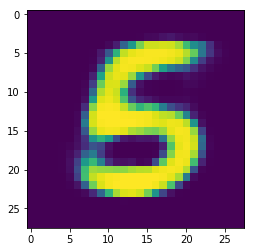

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  13



  0%|          | 1/214 [00:02<07:37,  2.15s/it]

[3 2 3 4 1 1 9 0 1 6 0 6 1 2 1 7 5 2 7 0 7 6 6 4 0 1 6 9 7 6 6 6 0 2 0 9 0
 8 4 8 1 1 0 6 0 8 6 0 4 8 6 8 0 1 0 1 5 3 7 7 7 8 5 3 5 8 5 3 0 9 1 0 6 2
 0 1 7 5 2 9 0 1 1 1 8 7 6 6 9 8 1 8 2 7 8 9 2 1 0 1 0 8 4 7 3 1 6 4 0 8 1
 8 4 3 3 2 9 0 4 7 4 8 9 6 1 4 1 7 4 9 2 8 9 1 7 9 8 0 4 9 1 0 6 6 6 8 2 8
 5 6 9 0 3 1 6 3 0 0 7 0 7 1 2 8 9 2 2 4 3 3 9 0 9 8 5 2 3 2 1 8 2 2 0 9 0
 3 6 6 5 3 7 7 9 6 6 9 5 3 9 1 7 2 7 6 4 0 3 1 0 0 0 9 4 7 5 1 3 6 2 2 2 9
 3 2 8 8 1 2 4 6 7 1 2 2 1 4 3 3 0 8 7 8 9 3 9 0 9 3 4 7 2 8 2 7 9 3]
[3 2 3 4 1 1 9 0 1 6 0 6 1 2 1 7 5 2 7 0 7 6 6 4 0 1 6 9 7 6 6 6 0 2 0 9 0
 8 4 8 1 1 0 6 0 8 6 0 4 8 6 8 0 1 0 1 5 3 7 7 7 8 5 3 5 8 5 3 0 9 1 0 6 2
 0 1 7 5 2 9 0 1 1 1 8 7 6 6 9 8 1 8 2 7 8 9 2 1 0 1 0 8 4 7 3 1 6 4 0 8 1
 8 4 3 3 2 9 0 4 7 4 8 9 6 1 4 1 7 4 9 2 8 9 1 7 9 8 0 4 9 1 0 6 6 6 8 2 8
 5 6 9 0 3 1 6 3 0 0 7 0 7 1 2 8 9 2 2 4 3 3 9 0 9 8 5 2 3 2 1 8 2 2 0 9 0
 3 6 6 5 3 7 7 9 6 6 9 5 3 9 1 7 2 7 6 4 0 3 1 0 0 0 9 4 7 5 1 3 6 2 2 2 9
 3 2 8 8 1 2 4 6 7 1 2 2 1 4 3


  1%|          | 2/214 [00:04<07:33,  2.14s/it]

[6 4 1 1 2 6 2 2 3 3 7 0 8 8 7 1 7 6 8 1 3 0 3 4 5 1 4 8 3 7 5 1 7 3 0 9 9
 3 1 7 1 8 4 2 9 3 0 7 3 5 6 9 9 2 4 3 9 8 2 6 5 8 5 9 1 7 3 6 7 8 9 1 3 7
 5 1 6 1 3 5 7 8 0 8 7 7 4 6 4 1 2 2 9 0 8 7 0 7 8 6 9 7 4 6 6 8 4 2 2 9 1
 3 0 0 4 0 0 2 3 2 8 3 8 7 8 7 8 5 4 1 6 0 6 9 6 7 7 2 6 4 8 2 2 9 7 1 8 1
 5 0 0 5 6 8 1 7 8 6 7 4 8 9 7 2 0 4 8 8 4 7 8 8 0 5 3 5 5 3 7 2 3 2 3 6 4
 0 0 7 0 4 6 6 9 2 8 9 9 5 4 6 7 2 0 4 6 2 4 7 4 8 6 1 3 7 5 6 5 0 7 9 9 0
 5 8 7 0 5 8 0 2 4 8 8 2 1 6 1 5 6 0 5 6 4 5 2 0 8 0 8 1 8 1 0 3 8 1]
[6 4 1 1 2 6 2 2 3 3 7 0 8 8 7 1 7 6 8 1 3 0 3 4 5 1 4 8 3 7 5 1 7 3 0 9 9
 3 1 7 1 8 4 2 9 3 0 7 3 5 6 9 9 2 4 3 9 8 2 6 5 8 5 9 1 7 3 6 7 8 9 1 3 7
 5 1 6 1 3 5 7 8 0 8 7 7 4 6 4 1 2 2 9 0 8 7 0 7 8 6 9 7 4 6 6 8 4 2 2 9 1
 3 0 0 4 0 0 2 3 2 8 3 8 7 8 7 8 5 4 1 6 0 6 9 6 7 7 2 6 4 8 2 2 9 7 1 8 1
 5 0 0 5 6 8 1 7 8 6 7 4 8 9 7 2 0 4 8 8 4 7 8 8 0 5 3 5 5 3 7 2 3 2 3 6 4
 0 0 7 0 4 6 6 9 2 8 9 9 5 4 6 7 2 0 4 6 2 4 7 4 8 6 1 3 7 5 6 5 0 7 9 9 0
 5 8 7 0 5 8 0 2 4 8 8 2 1 6 1


  1%|▏         | 3/214 [00:06<07:43,  2.20s/it]

[2 0 9 4 6 0 8 7 2 0 1 3 1 7 6 6 6 2 9 1 2 9 2 5 5 9 3 3 4 3 5 6 1 2 1 2 4
 1 3 1 8 0 0 3 4 9 9 9 4 8 4 0 8 1 0 6 2 8 1 4 4 5 6 6 0 6 0 4 9 4 3 2 2 8
 3 8 7 5 8 8 6 2 5 5 8 4 0 1 7 4 6 7 2 0 3 5 3 7 4 4 9 7 5 8 0 7 7 2 7 3 7
 4 4 9 3 6 5 2 7 0 6 3 5 7 9 3 1 9 9 7 3 1 3 7 5 7 2 7 5 5 6 3 1 4 7 6 6 0
 6 1 8 6 2 2 0 8 5 2 7 7 9 8 1 6 6 5 7 9 9 9 4 7 3 6 2 4 4 1 8 5 2 3 5 9 4
 2 1 2 7 8 1 1 0 8 1 7 6 6 8 9 2 4 7 2 5 7 9 4 8 0 7 6 6 0 2 8 9 0 7 8 0 5
 3 8 0 2 0 8 3 0 5 6 5 0 9 8 0 2 6 0 1 2 5 8 7 5 1 7 7 6 7 3 2 4 1 1]
[2 0 9 4 6 0 8 7 2 0 1 3 1 7 6 6 6 2 9 1 2 9 2 5 5 9 3 3 4 3 5 6 1 2 1 2 4
 1 3 1 8 0 0 3 4 9 9 9 4 8 4 0 8 1 0 6 2 8 1 4 4 5 6 6 0 6 0 4 9 4 3 2 2 8
 3 8 7 5 8 8 6 2 5 5 8 4 0 1 7 4 6 7 2 0 3 5 3 7 4 4 9 7 5 8 0 7 7 2 7 3 7
 4 4 9 3 6 5 2 7 0 6 3 5 7 9 3 1 9 9 7 3 1 3 7 5 7 2 7 5 5 6 3 1 4 7 6 6 0
 6 1 8 6 2 2 0 8 5 2 7 7 9 8 1 6 6 5 7 9 9 9 4 7 3 6 2 4 4 1 8 5 2 3 5 9 4
 2 1 2 7 8 1 1 0 8 1 7 6 6 8 9 2 4 7 2 5 7 9 4 8 0 7 6 6 0 2 8 9 0 7 8 0 5
 3 8 0 2 0 8 3 0 5 6 5 0 9 8 0


  2%|▏         | 4/214 [00:08<07:46,  2.22s/it]

[1 1 9 1 0 0 0 2 4 1 0 9 6 0 1 1 2 9 7 7 9 8 2 8 2 2 5 0 1 1 3 3 7 3 6 4 7
 7 9 6 2 7 3 7 5 9 8 3 9 3 7 8 8 9 4 2 5 8 0 9 0 9 0 3 5 3 0 6 1 4 7 0 0 1
 9 0 4 8 4 4 7 9 8 6 3 9 5 3 2 3 9 7 3 3 5 0 3 6 1 2 8 6 1 9 4 9 3 7 2 0 3
 6 2 1 4 9 5 8 8 7 3 1 2 5 6 7 7 8 6 8 1 0 1 4 1 5 4 1 3 0 4 6 9 1 3 1 8 2
 5 3 4 1 7 1 6 4 7 2 6 7 1 8 7 4 2 3 0 1 4 1 1 7 7 5 1 2 6 0 1 2 4 5 8 0 2
 7 0 5 9 3 8 1 6 8 5 5 0 4 5 7 6 3 3 7 6 3 9 9 8 0 1 4 9 3 7 5 2 8 9 8 4 1
 3 2 8 8 7 0 7 2 2 6 6 3 9 6 2 5 1 8 2 0 8 3 1 4 4 7 6 6 7 8 0 7 4 0]
[1 1 9 1 0 0 0 2 4 1 0 9 6 0 1 1 2 9 7 7 9 8 2 8 2 2 5 0 1 1 3 3 7 3 6 4 7
 7 9 6 2 7 3 7 5 9 8 3 9 3 7 8 8 9 4 2 5 8 0 9 0 9 0 3 5 3 0 6 1 4 7 0 0 1
 9 0 4 8 4 4 7 9 8 6 3 9 5 3 2 3 9 7 3 3 5 0 3 6 1 2 8 6 1 9 4 9 3 7 2 0 3
 6 2 1 4 9 5 8 8 7 3 1 2 5 6 7 7 8 6 8 1 0 1 4 1 5 4 1 3 0 4 6 9 1 3 1 8 2
 5 3 4 1 7 1 6 4 7 2 6 7 1 8 7 4 2 3 0 1 4 1 1 7 7 5 1 2 6 0 1 2 4 5 8 0 2
 7 0 5 9 3 8 1 6 8 5 5 0 4 5 7 6 3 3 7 6 3 9 9 8 0 1 4 9 3 7 5 2 8 9 8 4 1
 3 2 8 8 7 0 7 2 2 6 6 3 9 6 2


  2%|▏         | 5/214 [00:11<07:47,  2.24s/it]

[1 7 5 4 3 4 6 2 5 6 3 7 5 1 1 6 4 2 7 9 8 7 4 6 8 2 5 1 5 1 5 6 5 1 6 0 4
 5 6 9 5 4 1 7 6 7 2 2 9 3 1 3 2 8 7 7 4 1 1 4 6 3 3 0 4 6 1 1 0 0 2 1 3 2
 0 1 3 2 5 0 3 6 6 4 0 6 2 1 2 0 3 0 6 3 8 2 0 9 2 1 2 8 7 9 9 7 9 8 5 7 0
 1 4 7 0 0 9 8 7 4 2 1 9 8 1 5 0 0 1 7 9 5 7 3 6 6 4 7 2 0 5 4 5 9 1 1 5 3
 9 8 6 8 1 4 0 8 8 1 9 9 7 5 1 9 2 1 1 9 5 3 5 6 2 9 7 9 8 5 1 6 5 8 8 8 5
 4 0 6 6 9 8 6 9 4 2 4 6 7 9 7 4 4 9 6 5 2 3 5 0 7 1 5 6 1 1 2 9 1 5 3 6 3
 1 2 5 7 9 5 1 1 0 6 7 0 6 1 9 3 9 9 2 9 4 5 7 4 8 9 4 1 8 4 3 7 1 4]
[1 7 5 4 3 4 6 2 5 6 3 7 5 1 1 6 4 2 7 9 8 7 4 6 8 2 5 1 5 1 5 6 5 1 6 0 4
 5 6 9 5 4 1 7 6 7 2 2 9 3 1 3 2 8 7 7 4 1 1 4 6 3 3 0 4 6 1 1 0 0 2 1 3 2
 0 1 3 2 5 0 3 6 6 4 0 6 2 1 2 0 3 0 6 3 8 2 0 9 2 1 2 8 7 9 9 7 9 8 5 7 0
 1 4 7 0 0 9 8 7 4 2 1 9 8 1 5 0 0 1 7 9 5 7 3 6 6 4 7 2 0 5 4 5 9 1 1 5 3
 9 8 6 8 1 4 0 8 8 1 9 9 7 5 1 9 2 1 1 9 5 3 5 6 2 9 7 9 8 5 1 6 5 8 8 8 5
 4 0 6 6 9 8 6 9 4 2 4 6 7 9 7 4 4 9 6 5 2 3 5 0 7 1 5 6 1 1 2 9 1 5 3 6 3
 1 2 5 7 9 5 1 1 0 6 7 0 6 1 9


  3%|▎         | 6/214 [00:13<07:44,  2.23s/it]

[4 0 2 6 5 8 5 4 6 3 9 2 3 6 4 0 8 1 0 8 2 2 0 7 6 9 0 9 1 1 8 4 7 7 1 1 3
 2 4 4 7 2 5 4 0 8 2 7 3 0 9 4 8 1 2 0 7 3 9 7 6 9 9 8 5 3 9 5 2 2 6 4 1 1
 1 3 7 2 5 7 1 7 4 2 0 8 5 4 7 1 8 2 2 1 4 3 1 4 8 1 5 9 5 8 0 9 9 1 6 2 7
 1 6 9 0 7 1 5 5 3 4 2 4 0 1 6 1 8 4 6 6 6 0 9 2 1 6 5 5 1 5 1 3 4 0 9 9 3
 1 9 0 2 1 3 7 6 8 1 7 9 1 6 3 6 6 2 4 1 4 3 7 8 4 0 1 2 5 5 9 3 9 1 5 4 5
 7 9 1 9 5 3 8 9 2 1 3 6 6 6 1 3 0 7 3 3 0 1 9 6 1 6 1 7 7 6 9 2 0 2 5 6 2
 1 4 9 6 3 7 9 4 4 3 2 7 7 1 9 9 9 5 8 3 6 3 4 0 0 9 8 5 5 8 9 9 4 9]
[4 0 2 6 5 8 5 4 6 3 9 2 3 6 4 0 8 1 0 8 2 2 0 7 6 9 0 9 1 1 8 4 7 7 1 1 3
 2 4 4 7 2 5 4 0 8 2 7 3 0 9 4 8 1 2 0 7 3 9 7 6 9 9 8 5 3 9 5 2 2 6 4 1 1
 1 3 7 2 5 7 1 7 4 2 0 8 5 4 7 1 8 2 2 1 4 3 1 4 8 1 5 9 5 8 0 9 9 1 6 2 7
 1 6 9 0 7 1 5 5 3 4 2 4 0 1 6 1 8 4 6 6 6 0 9 2 1 6 5 5 1 5 1 3 4 0 9 9 3
 1 9 0 2 1 3 7 6 8 1 7 9 1 6 3 6 6 2 4 1 4 3 7 8 4 0 1 2 5 5 9 3 9 1 5 4 5
 7 9 1 9 5 3 8 9 2 1 3 6 6 6 1 3 0 7 3 3 0 1 9 6 1 6 1 7 7 6 9 2 0 2 5 6 2
 1 4 9 6 3 7 9 4 4 3 2 7 7 1 9


  3%|▎         | 7/214 [00:15<07:39,  2.22s/it]

[0 0 5 2 2 2 0 3 6 3 0 5 3 9 1 2 0 5 7 3 2 7 3 8 7 5 9 5 8 0 1 4 5 7 8 1 3
 4 3 6 7 2 7 6 5 4 8 0 8 2 5 9 4 4 4 2 8 0 0 6 3 9 8 6 0 6 2 6 7 3 0 7 2 8
 2 0 4 5 2 5 9 8 5 3 7 0 2 6 5 9 1 2 3 4 0 9 8 3 1 3 8 0 9 3 8 3 4 2 0 2 3
 3 2 0 8 9 1 2 4 2 1 8 6 4 4 3 3 5 8 4 2 1 1 1 6 3 1 9 9 3 9 7 8 9 4 9 2 6
 4 7 9 2 2 4 2 9 3 7 5 7 7 9 1 9 0 2 1 2 3 3 7 6 0 8 1 3 6 3 8 3 5 7 2 1 8
 6 6 2 4 7 0 4 3 4 1 8 2 6 1 4 0 3 2 7 8 6 9 0 0 2 8 0 4 3 0 6 0 4 5 9 8 4
 9 2 0 6 0 6 7 0 3 0 9 4 8 9 8 1 9 5 2 6 8 8 6 3 1 8 0 3 7 7 8 5 5 1]
[0 0 5 2 2 2 0 3 6 3 0 5 3 9 1 2 0 5 7 3 2 7 3 8 7 5 9 5 8 0 1 4 5 7 8 1 3
 4 3 6 7 2 7 6 5 4 8 0 8 2 5 9 4 4 4 2 8 0 0 6 3 9 8 6 0 6 2 6 7 3 0 7 2 8
 2 0 4 5 2 5 9 8 5 3 7 0 2 6 5 9 1 2 3 4 0 9 8 3 1 3 8 0 9 3 8 3 4 2 0 2 3
 3 2 0 8 9 1 2 4 2 1 8 6 4 4 3 3 5 8 4 2 1 1 1 6 3 1 9 9 3 9 7 8 9 4 9 2 6
 4 7 9 2 2 4 2 9 3 7 5 7 7 9 1 9 0 2 1 2 3 3 7 6 0 8 1 3 6 3 8 3 5 7 2 1 8
 6 6 2 4 7 0 4 3 4 1 8 2 6 1 4 0 3 2 7 8 6 9 0 0 2 8 0 4 3 0 6 0 4 5 9 8 4
 9 2 0 6 0 6 7 0 3 0 9 4 8 9 8


  4%|▎         | 8/214 [00:17<07:38,  2.23s/it]

[9 9 9 9 7 1 2 4 6 1 0 9 9 1 8 4 3 8 0 6 0 9 3 3 2 4 2 1 5 2 0 9 8 1 4 3 8
 7 8 0 7 1 4 1 6 3 6 6 4 5 9 0 2 0 1 7 2 4 5 7 5 7 6 5 1 6 6 0 4 7 1 4 8 3
 7 8 9 2 0 0 3 5 4 3 3 0 6 6 8 8 9 0 9 4 0 4 4 2 9 0 5 5 4 3 2 7 7 5 6 0 1
 2 4 9 2 1 5 5 1 5 9 3 6 6 1 1 4 3 9 9 8 4 5 1 0 3 7 3 5 0 8 8 7 4 8 1 3 9
 3 4 3 5 4 1 9 0 7 4 0 7 8 2 5 8 4 4 0 1 0 5 8 4 4 1 7 4 2 8 0 8 8 0 9 9 1
 7 5 9 4 6 1 6 4 8 2 3 6 1 9 1 1 3 5 3 8 8 6 6 2 2 2 1 7 6 0 0 9 7 7 9 2 6
 1 0 6 9 2 5 5 8 9 5 4 3 6 1 3 4 6 9 6 8 5 3 9 8 5 4 9 7 2 2 3 1 7 7]
[9 9 9 9 7 1 2 4 6 1 0 9 9 1 8 4 3 8 0 6 0 9 3 3 2 4 2 1 5 2 0 9 8 1 4 3 8
 7 8 0 7 1 4 1 6 3 6 6 4 5 9 0 2 0 1 7 2 4 5 7 5 7 6 5 1 6 6 0 4 7 1 4 8 3
 7 8 9 2 0 0 3 5 4 3 3 0 6 6 8 8 9 0 9 4 0 4 4 2 9 0 5 5 4 3 2 7 7 5 6 0 1
 2 4 9 2 1 5 5 1 5 9 3 6 6 1 1 4 3 9 9 8 4 5 1 0 3 7 3 5 0 8 8 7 4 8 1 3 9
 3 4 3 5 4 1 9 0 7 4 0 7 8 2 5 8 4 4 0 1 0 5 8 4 4 1 7 4 2 8 0 8 8 0 9 9 1
 7 5 9 4 6 1 6 4 8 2 3 6 1 9 1 1 3 5 3 8 8 6 6 2 2 2 1 7 6 0 0 9 7 7 9 2 6
 1 0 6 9 2 5 5 8 9 5 4 3 6 1 3


  4%|▍         | 9/214 [00:19<07:34,  2.22s/it]

[8 3 2 5 7 0 1 5 8 0 3 3 3 3 2 0 3 9 7 8 8 1 1 2 4 7 2 0 8 6 9 9 3 4 2 3 7
 7 7 8 1 9 5 1 9 2 3 6 5 6 2 0 8 9 3 6 5 5 6 0 8 8 1 9 2 4 4 1 6 0 9 9 8 7
 5 5 8 0 7 9 8 8 7 6 1 1 4 6 6 0 0 2 9 8 6 6 1 3 3 8 7 3 6 6 6 8 5 6 5 0 3
 8 7 6 1 4 4 2 4 5 4 1 8 8 1 9 6 4 0 9 1 2 8 3 6 4 1 3 5 2 7 2 4 8 7 0 8 8
 0 6 1 7 1 3 8 7 8 6 6 2 0 8 8 1 6 2 9 5 1 3 8 9 8 5 9 5 8 6 5 4 9 5 7 0 6
 6 0 0 8 5 3 5 5 6 9 3 9 0 7 4 9 0 5 9 2 7 1 3 9 4 6 7 7 6 0 0 0 5 8 7 1 1
 9 3 2 9 3 5 1 2 2 5 4 1 3 1 6 5 3 7 9 4 6 5 9 1 3 0 7 7 2 2 4 1 7 1]
[8 3 2 5 7 0 1 5 8 0 3 3 3 3 2 0 3 9 7 8 8 1 1 2 4 7 2 0 8 6 9 9 3 4 2 3 7
 7 7 8 1 9 5 1 9 2 3 6 5 6 2 0 8 9 3 6 5 5 6 0 8 8 1 9 2 4 4 1 6 0 9 9 8 7
 5 5 8 0 7 9 8 8 7 6 1 1 4 6 6 0 0 2 9 8 6 6 1 3 3 8 7 3 6 6 6 8 5 6 5 0 3
 8 7 6 1 4 4 2 4 5 4 1 8 8 1 9 6 4 0 9 1 2 8 3 6 4 1 3 5 2 7 2 4 8 7 0 8 8
 0 6 1 7 1 3 8 7 8 6 6 2 0 8 8 1 6 2 9 5 1 3 8 9 8 5 9 5 8 6 5 4 9 5 7 0 6
 6 0 0 8 5 3 5 5 6 9 3 9 0 7 4 9 0 5 9 2 7 1 3 9 4 6 7 7 6 0 0 0 5 8 7 1 1
 9 3 2 9 3 5 1 2 2 5 4 1 3 1 6


  5%|▍         | 10/214 [00:22<07:33,  2.22s/it]

[0 2 0 6 4 5 0 3 7 6 2 2 2 6 1 8 4 5 5 1 2 9 3 8 7 1 6 0 0 0 4 6 6 4 1 3 5
 4 5 3 1 0 1 3 9 8 9 7 4 7 2 7 1 6 8 4 1 9 9 0 7 9 0 6 3 1 9 1 7 8 4 9 0 8
 7 6 0 1 5 6 0 5 4 1 2 9 0 4 5 7 9 2 2 6 7 6 7 0 3 0 8 6 4 5 1 0 4 4 3 9 4
 5 7 4 5 4 4 1 0 0 9 0 8 1 6 9 6 6 7 8 6 1 0 5 9 5 8 3 2 0 9 7 2 9 1 4 4 8
 3 3 6 1 9 5 6 7 5 0 7 5 8 3 3 6 6 9 7 0 7 4 4 9 2 9 9 0 4 0 8 7 1 3 5 6 2
 1 9 2 6 5 9 2 4 2 8 3 1 8 7 2 3 4 3 1 6 6 1 7 6 2 4 9 8 6 3 1 9 1 9 9 1 6
 9 3 2 6 4 8 4 8 4 1 9 5 4 9 2 6 8 7 2 4 2 0 2 5 0 0 6 0 3 3 4 2 8 2]
[0 2 0 6 4 5 0 3 7 6 2 2 2 6 1 8 4 5 5 1 2 9 3 8 7 1 6 0 0 0 4 6 6 4 1 3 5
 4 5 3 1 0 1 3 9 8 9 7 4 7 2 7 1 6 8 4 1 9 9 0 7 9 0 6 3 1 9 1 7 8 4 9 0 8
 7 6 0 1 5 6 0 5 4 1 2 9 0 4 5 7 9 2 2 6 7 6 7 0 3 0 8 6 4 5 1 0 4 4 3 9 4
 5 7 4 5 4 4 1 0 0 9 0 8 1 6 9 6 6 7 8 6 1 0 5 9 5 8 3 2 0 9 7 2 9 1 4 4 8
 3 3 6 1 9 5 6 7 5 0 7 5 8 3 3 6 6 9 7 0 7 4 4 9 2 9 9 0 4 0 8 7 1 3 5 6 2
 1 9 2 6 5 9 2 4 2 8 3 1 8 7 2 3 4 3 1 6 6 1 7 6 2 4 9 8 6 3 1 9 1 9 9 1 6
 9 3 2 6 4 8 4 8 4 1 9 5 4 9 2


  5%|▌         | 11/214 [00:23<07:11,  2.12s/it]

[6 0 5 6 3 5 3 0 7 6 0 8 6 7 4 9 2 6 6 3 9 4 3 6 2 6 7 7 7 4 8 5 4 3 1 5 2
 2 9 3 9 8 7 1 7 0 0 0 1 6 1 0 5 7 9 1 4 3 5 5 0 2 1 6 9 5 4 3 9 6 7 5 4 2
 8 6 9 7 1 3 4 8 5 5 3 5 1 0 8 6 9 4 4 3 8 3 1 6 0 9 2 4 3 7 2 4 8 8 8 5 3
 2 3 9 5 0 1 3 9 0 0 6 3 7 3 0 0 3 0 0 8 9 4 0 7 6 0 9 2 5 4 3 6 3 7 8 2 6
 0 4 9 5 3 0 5 2 4 2 8 9 4 0 7 3 8 6 9 3 3 0 5 9 3 2 9 2 4 7 1 6 9 1 9 5 7
 4 7 5 2 5 6 6 3 0 2 4 3 8 4 4 7 9 7 4 2 1 1 4 0 2 8 5 3 9 6 2 7 2 1 4 8 7
 7 2 6 5 9 5 2 4 1 9 1 9 5 4 6 6 2 3 2 4 7 7 4 3 1 2 8 8 3 0 5 6 2 2]
[6 0 5 6 3 5 3 0 7 6 0 8 6 7 4 9 2 6 6 3 9 4 3 6 2 6 7 7 7 4 8 5 4 3 1 5 2
 2 9 3 9 8 7 1 7 0 0 0 1 6 1 0 5 7 9 1 4 3 5 5 0 2 1 6 9 5 4 3 9 6 7 5 4 2
 8 6 9 7 1 3 4 8 5 5 3 5 1 0 8 6 9 4 4 3 8 3 1 6 0 9 2 4 3 7 2 4 8 8 8 5 3
 2 3 9 5 0 1 3 9 0 0 6 3 7 3 0 0 3 0 0 8 9 4 0 7 6 0 9 2 5 4 3 6 3 7 8 2 6
 0 4 9 5 3 0 5 2 4 2 8 9 4 0 7 3 8 6 9 3 3 0 5 9 3 2 9 2 4 7 1 6 9 1 9 5 7
 4 7 5 2 5 6 6 3 0 2 4 3 8 4 4 7 9 7 4 2 1 1 4 0 2 8 5 3 9 6 2 7 2 1 4 8 7
 7 2 6 5 9 5 2 4 1 9 1 9 5 4 6


  6%|▌         | 12/214 [00:24<06:51,  2.04s/it]

[3 2 5 7 3 4 7 7 8 0 7 7 7 4 9 8 0 2 1 2 0 4 6 0 0 0 9 2 6 1 0 1 4 9 9 4 8
 4 2 2 2 2 5 7 6 5 9 9 9 6 7 4 2 1 9 4 6 7 6 2 0 5 5 1 3 8 2 9 8 1 5 8 1 7
 0 8 9 3 7 3 6 4 5 6 4 6 1 0 1 7 3 4 1 3 7 1 4 7 7 2 1 1 4 5 0 2 1 2 9 6 9
 8 7 9 5 4 7 3 5 7 0 8 2 5 3 4 5 2 4 8 7 3 7 7 7 0 4 0 1 8 5 6 0 1 3 0 6 4
 1 3 8 1 0 0 8 3 4 4 3 1 7 1 4 0 2 0 0 7 1 6 1 1 2 4 3 9 0 5 7 4 5 1 1 6 9
 1 3 5 1 5 6 8 4 8 5 7 4 2 2 3 5 9 0 8 9 1 2 8 5 1 3 0 9 4 8 2 5 0 0 1 5 9
 9 1 6 3 6 8 1 9 5 6 3 6 0 5 6 0 2 0 6 9 7 0 1 1 1 1 2 2 4 4 5 2 5 1]
[3 2 5 7 3 4 7 7 8 0 7 7 7 4 9 8 0 2 1 2 0 4 6 0 0 0 9 2 6 1 0 1 4 9 9 4 8
 4 2 2 2 2 5 7 6 5 9 9 9 6 7 4 2 1 9 4 6 7 6 2 0 5 5 1 3 8 2 9 8 1 5 8 1 7
 0 8 9 3 7 3 6 4 5 6 4 6 1 0 1 7 3 4 1 3 7 1 4 7 7 2 1 1 4 5 0 2 1 2 9 6 9
 8 7 9 5 4 7 3 5 7 0 8 2 5 3 4 5 2 4 8 7 3 7 7 7 0 4 0 1 8 5 6 0 1 3 0 6 4
 1 3 8 1 0 0 8 3 4 4 3 1 7 1 4 0 2 0 0 7 1 6 1 1 2 4 3 9 0 5 7 4 5 1 1 6 9
 1 3 5 1 5 6 8 4 8 5 7 4 2 2 3 5 9 0 8 9 1 2 8 5 1 3 0 9 4 8 2 5 0 0 1 5 9
 9 1 6 3 6 8 1 9 5 6 3 6 0 5 6


  6%|▌         | 13/214 [00:25<06:35,  1.97s/it]

[0 2 5 9 6 4 6 2 2 5 4 1 8 6 7 6 9 9 0 9 2 2 0 8 1 0 1 9 7 1 0 1 7 9 7 6 9
 0 1 4 8 6 4 1 9 4 9 7 6 0 9 1 2 9 2 9 8 1 2 9 5 8 6 4 3 3 7 3 2 7 5 4 6 1
 0 8 7 9 6 7 3 3 0 7 1 0 2 3 7 6 6 3 0 4 0 2 8 8 3 4 2 4 7 8 9 0 9 8 0 5 2
 9 8 9 8 2 5 7 8 3 6 2 2 1 9 7 7 7 3 3 2 8 4 8 6 2 0 2 0 9 6 3 2 3 6 2 3 7
 0 3 4 3 7 9 1 7 4 6 6 1 1 1 8 1 6 9 1 1 9 3 2 2 1 9 1 2 6 0 3 1 7 5 6 9 0
 2 1 5 7 7 5 9 6 3 3 3 3 7 3 3 3 8 7 9 6 2 4 2 3 9 9 3 4 0 1 0 9 3 5 6 9 4
 5 7 2 3 5 9 3 6 3 4 0 9 2 6 7 1 4 2 9 9 7 6 0 6 4 7 2 9 1 5 8 4 4 6]
[0 2 5 9 6 4 6 2 2 5 4 1 8 6 7 6 9 9 0 9 2 2 0 8 1 0 1 9 7 1 0 1 7 9 7 6 9
 0 1 4 8 6 4 1 9 4 9 7 6 0 9 1 2 9 2 9 8 1 2 9 5 8 6 4 3 3 7 3 2 7 5 4 6 1
 0 8 7 9 6 7 3 3 0 7 1 0 2 3 7 6 6 3 0 4 0 2 8 8 3 4 2 4 7 8 9 0 9 8 0 5 2
 9 8 9 8 2 5 7 8 3 6 2 2 1 9 7 7 7 3 3 2 8 4 8 6 2 0 2 0 9 6 3 2 3 6 2 3 7
 0 3 4 3 7 9 1 7 4 6 6 1 1 1 8 1 6 9 1 1 9 3 2 2 1 9 1 2 6 0 3 1 7 5 6 9 0
 2 1 5 7 7 5 9 6 3 3 3 3 7 3 3 3 8 7 9 6 2 4 2 3 9 9 3 4 0 1 0 9 3 5 6 9 4
 5 7 2 3 5 9 3 6 3 4 0 9 2 6 7


  7%|▋         | 14/214 [00:26<06:19,  1.90s/it]

[6 4 6 2 3 1 3 5 4 1 1 4 2 2 6 7 1 7 7 1 2 5 8 9 8 8 9 1 4 4 9 0 3 5 2 8 8
 3 9 7 5 6 2 9 0 0 1 2 2 7 0 1 1 5 3 7 3 3 2 8 9 7 1 2 5 2 1 3 2 0 3 7 2 5
 9 8 0 6 1 8 1 4 3 3 9 1 2 6 2 8 8 3 2 0 6 7 3 1 6 0 1 9 8 1 8 2 9 4 4 9 8
 0 1 0 5 3 4 1 6 9 4 2 4 6 4 8 8 7 4 8 1 0 1 5 9 6 0 3 0 1 2 9 8 1 2 8 7 5
 5 9 2 2 8 9 5 9 1 8 0 3 1 5 2 2 8 7 7 5 8 6 8 5 0 5 9 3 9 4 7 2 8 3 1 8 2
 6 9 8 6 5 1 6 6 0 2 9 1 3 5 7 4 2 7 6 4 0 2 8 5 3 0 4 3 0 7 0 2 4 9 3 8 4
 5 0 4 1 8 8 0 3 1 3 0 4 8 7 6 5 7 1 3 4 5 6 9 2 4 9 2 3 2 1 8 6 3 2]
[6 4 6 2 3 1 3 5 4 1 1 4 2 2 6 7 1 7 7 1 2 5 8 9 8 8 9 1 4 4 9 0 3 5 2 8 8
 3 9 7 5 6 2 9 0 0 1 2 2 7 0 1 1 5 3 7 3 3 2 8 9 7 1 2 5 2 1 3 2 0 3 7 2 5
 9 8 0 6 1 8 1 4 3 3 9 1 2 6 2 8 8 3 2 0 6 7 3 1 6 0 1 9 8 1 8 2 9 4 4 9 8
 0 1 0 5 3 4 1 6 9 4 2 4 6 4 8 8 7 4 8 1 0 1 5 9 6 0 3 0 1 2 9 8 1 2 8 7 5
 5 9 2 2 8 9 5 9 1 8 0 3 1 5 2 2 8 7 7 5 8 6 8 5 0 5 9 3 9 4 7 2 8 3 1 8 2
 6 9 8 6 5 1 6 6 0 2 9 1 3 5 7 4 2 7 6 4 0 2 8 5 3 0 4 3 0 7 0 2 4 9 3 8 4
 5 0 4 1 8 8 0 3 1 3 0 4 8 7 6


  7%|▋         | 15/214 [00:27<06:06,  1.84s/it]

[7 4 4 7 8 2 5 7 6 7 6 2 6 5 9 1 6 3 1 5 0 8 8 2 6 1 3 9 5 0 2 0 7 7 1 5 2
 2 0 1 3 6 3 0 5 8 3 4 1 3 0 7 4 0 5 1 0 2 5 5 3 3 0 0 2 6 3 0 8 8 4 6 0 4
 5 7 2 8 0 6 3 1 1 8 0 5 8 8 2 8 6 3 5 1 6 7 1 3 8 2 2 1 1 6 6 7 1 4 3 4 7
 6 1 0 8 3 3 8 1 8 5 6 6 8 5 1 4 4 3 3 0 3 8 7 5 3 2 0 7 4 5 4 6 4 3 8 5 3
 4 4 5 6 3 4 7 6 6 9 6 0 6 3 6 9 9 1 7 5 8 5 9 4 1 1 1 0 6 5 5 0 7 1 5 6 5
 3 9 9 3 8 4 1 7 5 6 0 5 3 1 8 7 1 6 8 7 8 9 1 5 1 1 3 2 2 2 1 0 6 1 6 0 9
 7 0 8 0 3 1 3 3 2 4 5 3 3 6 7 9 6 8 9 6 2 8 0 3 4 0 7 7 1 8 2 1 4 2]
[7 4 4 7 8 2 5 7 6 7 6 2 6 5 9 1 6 3 1 5 0 8 8 2 6 1 3 9 5 0 2 0 7 7 1 5 2
 2 0 1 3 6 3 0 5 8 3 4 1 3 0 7 4 0 5 1 0 2 5 5 3 3 0 0 2 6 3 0 8 8 4 6 0 4
 5 7 2 8 0 6 3 1 1 8 0 5 8 8 2 8 6 3 5 1 6 7 1 3 8 2 2 1 1 6 6 7 1 4 3 4 7
 6 1 0 8 3 3 8 1 8 5 6 6 8 5 1 4 4 3 3 0 3 8 7 5 3 2 0 7 4 5 4 6 4 3 8 5 3
 4 4 5 6 3 4 7 6 6 9 6 0 6 3 6 9 9 1 7 5 8 5 9 4 1 1 1 0 6 5 5 0 7 1 5 6 5
 3 9 9 3 8 4 1 7 5 6 0 5 3 1 8 7 1 6 8 7 8 9 1 5 1 1 3 2 2 2 1 0 6 1 6 0 9
 7 0 8 0 3 1 3 3 2 4 5 3 3 6 7


  7%|▋         | 16/214 [00:28<05:55,  1.80s/it]

[7 6 5 1 6 4 1 8 0 7 0 7 3 1 8 8 9 6 4 8 5 5 8 7 0 7 1 4 8 9 0 9 1 8 5 3 2
 8 4 1 1 0 2 2 8 6 2 0 5 0 9 1 0 2 7 7 4 5 2 6 7 4 3 1 5 7 1 2 2 2 9 9 1 1
 6 0 7 4 1 0 6 5 9 9 5 3 0 6 4 5 8 7 8 1 4 7 9 4 7 7 0 1 1 6 4 7 2 7 5 7 2
 3 0 1 4 5 2 0 6 7 7 0 7 3 2 2 9 5 9 0 1 2 4 4 2 9 4 9 0 8 7 4 1 4 7 9 6 2
 8 5 4 6 1 2 1 7 3 8 6 0 0 7 4 7 1 2 6 9 1 6 7 5 8 0 7 2 8 5 1 4 3 2 1 3 1
 5 4 0 6 3 4 4 0 3 3 3 0 0 0 2 8 9 3 2 4 4 2 6 9 7 6 7 6 3 9 9 0 1 6 5 4 3
 8 6 8 5 3 1 2 5 4 4 3 6 9 5 5 3 3 7 7 0 2 3 7 2 3 1 1 4 8 3 5 7 0 0]
[7 6 5 1 6 4 1 8 0 7 0 7 3 1 8 8 9 6 4 8 5 5 8 7 0 7 1 4 8 9 0 9 1 8 5 3 2
 8 4 1 1 0 2 2 8 6 2 0 5 0 9 1 0 2 7 7 4 5 2 6 7 4 3 1 5 7 1 2 2 2 9 9 1 1
 6 0 7 4 1 0 6 5 9 9 5 3 0 6 4 5 8 7 8 1 4 7 9 4 7 7 0 1 1 6 4 7 2 7 5 7 2
 3 0 1 4 5 2 0 6 7 7 0 7 3 2 2 9 5 9 0 1 2 4 4 2 9 4 9 0 8 7 4 1 4 7 9 6 2
 8 5 4 6 1 2 1 7 3 8 6 0 0 7 4 7 1 2 6 9 1 6 7 5 8 0 7 2 8 5 1 4 3 2 1 3 1
 5 4 0 6 3 4 4 0 3 3 3 0 0 0 2 8 9 3 2 4 4 2 6 9 7 6 7 6 3 9 9 0 1 6 5 4 3
 8 6 8 5 3 1 2 5 4 4 3 6 9 5 5


  8%|▊         | 17/214 [00:29<05:45,  1.75s/it]

[3 7 1 5 1 1 5 5 6 1 1 7 5 0 0 3 9 2 0 9 3 6 7 5 3 2 7 2 7 0 3 3 2 3 9 0 1
 1 7 2 1 2 2 1 6 2 8 0 9 5 2 8 5 5 5 0 4 4 9 6 7 9 8 2 6 6 7 4 7 4 4 2 1 8
 0 0 3 3 4 1 7 0 4 0 0 1 4 0 0 5 6 3 8 9 0 6 5 1 3 7 2 6 6 6 9 4 0 5 9 2 0
 1 5 1 6 6 0 3 7 9 9 1 0 5 0 5 5 1 3 9 6 6 7 0 1 1 2 7 0 8 2 9 8 0 0 0 8 8
 4 6 5 9 1 3 3 9 1 3 8 3 7 7 3 9 4 8 1 1 0 7 0 9 9 0 7 4 0 5 9 4 2 3 8 5 9
 5 8 5 6 9 9 3 7 1 3 5 5 1 6 5 1 5 0 8 7 7 5 0 9 1 3 7 7 5 0 0 2 0 8 8 3 9
 2 6 0 6 8 0 1 3 1 9 8 1 7 7 1 2 9 7 7 7 8 1 1 2 1 2 6 4 5 8 1 0 4 0]
[3 7 1 5 1 1 5 5 6 1 1 7 5 0 0 3 9 2 0 9 3 6 7 5 3 2 7 2 7 0 3 3 2 3 9 0 1
 1 7 2 1 2 2 1 6 2 8 0 9 5 2 8 5 5 5 0 4 4 9 6 7 9 8 2 6 6 7 4 7 4 4 2 1 8
 0 0 3 3 4 1 7 0 4 0 0 1 4 0 0 5 6 3 8 9 0 6 5 1 3 7 2 6 6 6 9 4 0 5 9 2 0
 1 5 1 6 6 0 3 7 9 9 1 0 5 0 5 5 1 3 9 6 6 7 0 1 1 2 7 0 8 2 9 8 0 0 0 8 8
 4 6 5 9 1 3 3 9 1 3 8 3 7 7 3 9 4 8 1 1 0 7 0 9 9 0 7 4 0 5 9 4 2 3 8 5 9
 5 8 5 6 9 9 3 7 1 3 5 5 1 6 5 1 5 0 8 7 7 5 0 9 1 3 7 7 5 0 0 2 0 8 8 3 9
 2 6 0 6 8 0 1 3 1 9 8 1 7 7 1


  8%|▊         | 18/214 [00:30<05:36,  1.72s/it]

[1 4 8 3 5 0 8 7 5 8 4 5 1 2 7 8 5 0 5 3 2 0 3 0 7 7 7 7 1 5 0 3 6 8 5 2 5
 8 2 1 8 0 9 0 7 3 6 1 9 3 7 3 9 2 1 1 9 3 5 0 5 6 3 4 2 9 0 9 3 5 6 5 6 6
 7 1 6 2 5 4 2 6 5 6 0 1 2 9 4 2 0 7 5 6 8 0 2 9 4 4 1 5 4 2 7 7 5 7 5 7 6
 8 0 9 8 7 7 6 0 7 2 4 6 8 5 5 9 1 6 9 1 5 4 0 8 7 6 3 2 0 3 3 8 1 8 1 0 9
 4 5 9 7 4 2 0 8 4 9 2 3 1 2 6 0 0 7 1 9 9 0 7 3 7 9 7 1 8 7 9 3 8 5 4 9 2
 3 6 1 3 3 0 6 9 1 7 1 1 0 0 6 1 0 6 4 7 7 2 6 9 3 0 7 0 8 9 4 7 4 1 2 8 3
 6 5 6 9 5 5 6 3 8 7 1 8 1 3 1 9 8 3 8 4 4 2 7 2 4 8 3 1 1 1 5 1 8 6]
[1 4 8 3 5 0 8 7 5 8 4 5 1 2 7 8 5 0 5 3 2 0 3 0 7 7 7 7 1 5 0 3 6 8 5 2 5
 8 2 1 8 0 9 0 7 3 6 1 9 3 7 3 9 2 1 1 9 3 5 0 5 6 3 4 2 9 0 9 3 5 6 5 6 6
 7 1 6 2 5 4 2 6 5 6 0 1 2 9 4 2 0 7 5 6 8 0 2 9 4 4 1 5 4 2 7 7 5 7 5 7 6
 8 0 9 8 7 7 6 0 7 2 4 6 8 5 5 9 1 6 9 1 5 4 0 8 7 6 3 2 0 3 3 8 1 8 1 0 9
 4 5 9 7 4 2 0 8 4 9 2 3 1 2 6 0 0 7 1 9 9 0 7 3 7 9 7 1 8 7 9 3 8 5 4 9 2
 3 6 1 3 3 0 6 9 1 7 1 1 0 0 6 1 0 6 4 7 7 2 6 9 3 0 7 0 8 9 4 7 4 1 2 8 3
 6 5 6 9 5 5 6 3 8 7 1 8 1 3 1


  9%|▉         | 19/214 [00:31<05:28,  1.68s/it]

[6 3 7 3 1 3 9 9 9 5 6 0 7 6 7 6 1 0 6 6 0 8 4 2 8 5 2 4 3 8 4 8 3 0 2 8 0
 2 7 4 8 0 3 9 6 1 6 6 9 7 8 3 6 7 3 7 8 4 2 3 0 0 7 5 8 1 8 2 0 9 3 7 4 2
 6 7 0 6 5 7 2 6 4 9 0 2 1 5 8 0 4 1 9 6 4 3 1 5 5 2 0 3 5 1 0 6 7 5 3 1 5
 1 7 8 6 4 5 2 4 8 2 9 1 1 3 2 0 3 8 0 2 3 6 0 4 8 2 0 1 0 0 0 1 9 3 0 4 1
 7 9 2 4 5 7 2 0 2 1 8 2 8 1 0 1 8 4 3 8 0 0 2 9 5 7 6 2 9 0 6 1 3 1 6 4 7
 7 5 2 1 0 5 8 7 3 1 5 5 1 0 9 8 7 6 1 1 5 5 4 8 4 7 0 5 9 8 6 8 1 9 5 9 8
 7 0 4 1 4 6 1 3 0 7 5 9 0 5 1 8 5 4 3 9 1 5 5 1 6 7 8 7 5 9 8 6 2 4]
[6 3 7 3 1 3 9 9 9 5 6 0 7 6 7 6 1 0 6 6 0 8 4 2 8 5 2 4 3 8 4 8 3 0 2 8 0
 2 7 4 8 0 3 9 6 1 6 6 9 7 8 3 6 7 3 7 8 4 2 3 0 0 7 5 8 1 8 2 0 9 3 7 4 2
 6 7 0 6 5 7 2 6 4 9 0 2 1 5 8 0 4 1 9 6 4 3 1 5 5 2 0 3 5 1 0 6 7 5 3 1 5
 1 7 8 6 4 5 2 4 8 2 9 1 1 3 2 0 3 8 0 2 3 6 0 4 8 2 0 1 0 0 0 1 9 3 0 4 1
 7 9 2 4 5 7 2 0 2 1 8 2 8 1 0 1 8 4 3 8 0 0 2 9 5 7 6 2 9 0 6 1 3 1 6 4 7
 7 5 2 1 0 5 8 7 3 1 5 5 1 0 9 8 7 6 1 1 5 5 4 8 4 7 0 5 9 8 6 8 1 9 5 9 8
 7 0 4 1 4 6 1 3 0 7 5 9 0 5 1


  9%|▉         | 20/214 [00:33<05:20,  1.65s/it]

[0 1 1 2 5 3 5 8 1 5 1 0 1 0 6 8 5 8 8 8 4 9 4 3 3 7 2 0 7 4 8 0 6 1 4 4 9
 0 5 2 9 6 4 1 2 6 7 4 9 4 1 0 6 9 5 7 7 7 0 5 5 4 3 1 4 3 1 6 2 3 3 5 1 3
 1 4 1 6 2 5 9 7 1 6 3 0 1 9 2 8 2 1 3 2 8 8 2 7 3 0 7 1 3 6 8 5 5 7 3 6 3
 7 4 7 0 5 8 3 9 4 8 4 8 8 3 6 5 4 2 4 1 6 3 1 4 6 6 7 8 7 5 5 5 2 9 6 8 9
 8 3 7 5 2 0 7 6 2 3 9 6 4 4 7 8 9 7 4 0 7 5 5 6 7 9 3 7 6 9 9 4 9 7 6 2 2
 7 3 9 5 0 4 1 9 0 3 3 1 5 2 1 0 2 1 4 7 0 8 4 0 2 6 9 3 9 9 5 7 9 1 2 2 0
 8 4 8 4 4 8 2 6 4 8 9 0 0 7 6 7 8 4 3 4 3 2 6 9 7 0 8 5 4 8 0 4 7 3]
[0 1 1 2 5 3 5 8 1 5 1 0 1 0 6 8 5 8 8 8 4 9 4 3 3 7 2 0 7 4 8 0 6 1 4 4 9
 0 5 2 9 6 4 1 2 6 7 4 9 4 1 0 6 9 5 7 7 7 0 5 5 4 3 1 4 3 1 6 2 3 3 5 1 3
 1 4 1 6 2 5 9 7 1 6 3 0 1 9 2 8 2 1 3 2 8 8 2 7 3 0 7 1 3 6 8 5 5 7 3 6 3
 7 4 7 0 5 8 3 9 4 8 4 8 8 3 6 5 4 2 4 1 6 3 1 4 6 6 7 8 7 5 5 5 2 9 6 8 9
 8 3 7 5 2 0 7 6 2 3 9 6 4 4 7 8 9 7 4 0 7 5 5 6 7 9 3 7 6 9 9 4 9 7 6 2 2
 7 3 9 5 0 4 1 9 0 3 3 1 5 2 1 0 2 1 4 7 0 8 4 0 2 6 9 3 9 9 5 7 9 1 2 2 0
 8 4 8 4 4 8 2 6 4 8 9 0 0 7 6


 10%|▉         | 21/214 [00:34<05:13,  1.62s/it]

[5 6 8 3 2 9 8 8 5 3 5 4 7 7 3 4 7 4 7 9 6 6 4 3 4 1 2 8 6 3 6 5 5 2 0 9 4
 1 5 8 9 4 5 9 7 8 0 2 2 5 4 1 9 3 9 7 3 7 9 9 9 1 2 7 3 3 1 4 4 8 1 8 7 2
 2 6 7 1 7 3 9 6 2 7 4 4 7 2 9 5 0 7 0 7 4 8 2 0 4 1 7 3 9 0 1 2 1 8 8 2 7
 2 3 2 1 4 3 4 8 9 2 9 0 8 6 7 2 3 1 0 9 0 2 3 6 4 2 2 8 7 4 0 7 8 9 2 5 6
 5 7 4 5 2 6 3 9 2 3 6 4 8 8 2 1 1 2 6 7 5 8 7 3 5 8 5 4 5 6 5 0 2 2 7 6 1
 0 2 2 3 1 8 3 5 1 1 3 7 4 2 8 0 6 4 0 6 0 2 4 6 5 8 4 0 2 4 4 7 3 6 1 4 6
 3 9 6 6 0 6 4 2 4 1 3 2 9 8 4 1 3 2 7 8 0 2 2 4 8 1 4 9 7 4 5 0 8 9]
[5 6 8 3 2 9 8 8 5 3 5 4 7 7 3 4 7 4 7 9 6 6 4 3 4 1 2 8 6 3 6 5 5 2 0 9 4
 1 5 8 9 4 5 9 7 8 0 2 2 5 4 1 9 3 9 7 3 7 9 9 9 1 2 7 3 3 1 4 4 8 1 8 7 2
 2 6 7 1 7 3 9 6 2 7 4 4 7 2 9 5 0 7 0 7 4 8 2 0 4 1 7 3 9 0 1 2 1 8 8 2 7
 2 3 2 1 4 3 4 8 9 2 9 0 8 6 7 2 3 1 0 9 0 2 3 6 4 2 2 8 7 4 0 7 8 9 2 5 6
 5 7 4 5 2 6 3 9 2 3 6 4 8 8 2 1 1 2 6 7 5 8 7 3 5 8 5 4 5 6 5 0 2 2 7 6 1
 0 2 2 3 1 8 3 5 1 1 3 7 4 2 8 0 6 4 0 6 0 2 4 6 5 8 4 0 2 4 4 7 3 6 1 4 6
 3 9 6 6 0 6 4 2 4 1 3 2 9 8 4


 10%|█         | 22/214 [00:35<05:05,  1.59s/it]

[9 9 8 6 5 3 7 1 4 4 0 1 1 3 2 4 9 5 5 3 4 1 8 6 3 8 2 4 3 2 7 5 5 3 3 4 4
 0 4 4 1 3 0 1 4 4 6 3 2 6 8 9 8 9 9 4 0 3 2 6 7 9 4 1 4 1 6 6 3 9 5 6 6 2
 3 5 4 9 0 0 1 2 7 2 1 2 7 3 8 5 3 5 9 8 9 6 0 3 6 0 2 7 3 7 7 8 3 9 0 4 3
 9 2 9 2 0 3 8 8 2 6 9 2 6 2 4 1 8 6 4 4 8 0 9 0 3 4 2 6 5 4 0 0 3 0 1 9 2
 4 5 5 7 4 5 6 3 7 7 9 9 2 9 2 1 5 1 5 4 7 8 2 3 1 9 5 5 9 7 4 2 7 7 8 2 2
 0 9 1 6 2 7 3 8 6 9 9 7 9 8 0 7 9 8 7 9 5 3 7 5 2 7 0 0 7 8 4 0 5 0 5 3 4
 9 0 8 9 9 8 3 5 2 4 4 5 9 1 4 4 2 4 5 6 7 4 5 9 0 1 9 1 9 3 1 7 5 1]
[9 9 8 6 5 3 7 1 4 4 0 1 1 3 2 4 9 5 5 3 4 1 8 6 3 8 2 4 3 2 7 5 5 3 3 4 4
 0 4 4 1 3 0 1 4 4 6 3 2 6 8 9 8 9 9 4 0 3 2 6 7 9 4 1 4 1 6 6 3 9 5 6 6 2
 3 5 4 9 0 0 1 2 7 2 1 2 7 3 8 5 3 5 9 8 9 6 0 3 6 0 2 7 3 7 7 8 3 9 0 4 3
 9 2 9 2 0 3 8 8 2 6 9 2 6 2 4 1 8 6 4 4 8 0 9 0 3 4 2 6 5 4 0 0 3 0 1 9 2
 4 5 5 7 4 5 6 3 7 7 9 9 2 9 2 1 5 1 5 4 7 8 2 3 1 9 5 5 9 7 4 2 7 7 8 2 2
 0 9 1 6 2 7 3 8 6 9 9 7 9 8 0 7 9 8 7 9 5 3 7 5 2 7 0 0 7 8 4 0 5 0 5 3 4
 9 0 8 9 9 8 3 5 2 4 4 5 9 1 4


 11%|█         | 23/214 [00:35<04:58,  1.56s/it]

[9 6 4 9 3 7 5 0 0 7 6 8 8 9 4 9 8 8 0 2 6 4 3 4 1 5 6 9 4 7 8 5 7 7 2 9 1
 8 5 9 4 6 6 6 6 7 5 3 5 0 7 9 5 1 8 1 1 2 3 0 3 2 2 2 3 1 3 7 5 0 9 8 1 5
 7 1 6 6 3 5 6 7 3 2 2 2 6 3 3 0 1 0 8 3 8 1 1 7 7 1 7 9 4 2 1 9 7 7 6 0 3
 5 8 6 9 7 7 6 7 0 4 7 3 1 9 6 7 9 5 8 4 0 4 1 8 6 3 9 1 8 4 1 4 5 3 4 2 0
 2 7 0 4 9 7 0 7 3 4 5 0 7 5 2 5 2 1 6 5 1 6 9 2 1 5 3 7 5 4 8 6 5 7 6 1 1
 9 8 4 1 9 9 9 6 0 2 9 5 3 8 1 5 0 3 2 3 8 6 2 8 7 5 7 5 0 1 4 1 5 3 1 5 7
 7 1 7 1 3 6 0 3 2 7 0 3 8 6 2 8 5 3 1 9 8 4 6 9 8 8 4 8 1 6 5 2 5 3]
[9 6 4 9 3 7 5 0 0 7 6 8 8 9 4 9 8 8 0 2 6 4 3 4 1 5 6 9 4 7 8 5 7 9 2 9 1
 8 5 9 4 6 6 6 6 7 5 3 5 0 7 9 5 1 8 1 1 2 3 0 3 2 2 2 3 1 3 7 5 0 9 8 1 5
 7 1 6 6 3 5 6 7 3 2 2 2 6 3 3 0 1 0 8 3 8 1 1 7 7 1 7 9 4 2 1 9 7 7 6 0 3
 5 8 6 9 7 7 6 7 0 4 7 3 1 9 6 7 9 5 8 4 0 4 1 8 6 3 9 1 8 4 1 4 5 3 4 2 0
 2 7 0 4 9 7 0 7 3 4 5 0 7 5 2 5 2 1 6 5 1 6 9 2 1 5 3 7 5 4 8 6 5 7 6 1 1
 9 8 4 1 9 9 9 6 0 2 9 5 3 8 1 5 0 3 2 3 8 6 2 8 7 5 7 5 0 1 4 1 5 3 1 5 7
 7 1 7 1 3 6 0 3 2 7 0 3 8 6 2


 11%|█         | 24/214 [00:37<04:53,  1.54s/it]

[7 0 0 2 1 7 4 8 6 4 2 0 5 9 2 6 8 5 7 1 5 6 9 7 5 8 7 1 4 9 1 3 6 0 1 2 8
 0 3 9 1 4 5 6 3 4 2 0 1 6 7 7 3 3 5 2 0 9 7 6 9 2 8 8 9 4 7 7 1 5 9 4 1 6
 1 4 5 4 2 0 5 4 3 5 7 0 2 4 9 7 9 7 1 6 1 2 8 5 3 7 3 4 4 0 9 1 7 8 4 7 3
 2 0 9 0 7 6 2 1 5 7 5 0 4 9 0 9 4 2 4 3 6 8 2 8 6 4 9 3 3 2 4 5 0 6 7 8 9
 3 4 6 7 2 7 8 2 6 6 6 0 6 9 9 3 7 3 9 5 9 4 8 9 4 1 8 9 0 1 9 5 7 0 9 0 5
 7 6 7 3 0 4 8 8 1 4 7 5 0 0 1 5 5 2 6 3 8 1 1 9 4 0 3 5 1 4 5 3 9 7 3 9 2
 7 6 6 6 2 0 5 9 0 0 8 0 3 1 0 4 3 1 5 9 8 2 4 7 3 2 0 2 1 8 5 3 4 6]
[7 0 0 2 1 7 4 8 6 4 2 0 5 9 2 6 8 5 7 1 5 6 9 7 5 8 7 1 4 9 1 3 6 0 1 2 8
 0 3 9 1 4 5 6 3 4 2 0 1 6 7 7 3 3 5 2 0 9 7 6 9 2 8 8 9 4 7 7 1 5 9 4 1 6
 1 4 5 4 2 0 5 4 3 5 7 0 2 4 9 7 9 7 1 6 1 2 8 5 3 7 3 4 4 0 9 1 7 8 4 7 3
 2 0 9 0 7 6 2 1 5 7 5 0 4 9 0 9 4 2 4 3 6 8 2 8 6 4 9 3 3 2 4 5 0 6 7 8 9
 3 4 6 7 2 7 8 2 6 6 6 0 6 9 9 3 7 3 9 5 9 4 8 9 4 1 8 9 0 1 9 5 7 0 9 0 5
 7 6 7 3 0 4 8 8 1 4 7 5 0 0 1 5 5 2 6 3 8 1 1 9 4 0 3 5 1 4 5 3 9 7 3 9 2
 7 6 6 6 2 0 5 9 0 0 8 0 3 1 0


 12%|█▏        | 25/214 [00:38<04:48,  1.53s/it]

[2 0 9 5 2 0 7 6 2 8 9 1 2 6 0 2 9 6 5 6 2 1 5 8 4 7 7 5 9 4 3 0 3 5 1 7 2
 6 2 5 2 1 3 2 5 0 0 8 1 0 6 7 3 6 5 7 9 1 0 9 0 0 8 2 5 2 5 1 8 7 3 4 0 8
 5 9 2 1 8 8 1 8 7 9 2 3 8 6 9 4 2 2 4 1 4 6 1 8 9 2 7 0 3 0 9 2 5 8 7 3 0
 7 9 0 1 9 6 1 6 3 6 3 2 6 3 1 3 5 0 3 1 3 6 0 2 7 5 0 2 0 4 8 9 1 1 3 7 1
 9 6 6 0 7 1 5 3 8 2 9 1 0 7 9 6 5 2 3 9 8 8 4 2 1 8 7 3 3 4 4 9 8 5 4 5 3
 7 5 8 2 8 8 2 0 3 1 4 1 8 1 5 9 1 6 9 2 9 2 4 1 8 1 1 5 7 5 4 9 9 5 2 6 7
 5 1 4 1 9 5 5 3 1 0 9 3 5 4 2 7 0 6 6 5 3 9 3 1 3 9 6 9 5 7 0 8 4 2]
[2 0 9 5 2 0 7 6 2 8 9 1 2 6 0 2 9 6 5 6 2 1 5 8 4 7 7 5 9 4 3 0 3 5 1 7 2
 6 2 5 2 1 3 2 5 0 0 8 1 0 6 7 3 6 5 7 9 1 0 9 0 0 8 2 5 2 5 1 8 7 3 4 0 8
 5 9 2 1 8 8 1 8 7 9 2 3 8 6 9 4 2 2 4 1 4 6 1 8 9 2 7 0 3 0 9 2 5 8 7 3 0
 7 9 0 1 9 6 1 6 3 6 3 2 6 3 1 3 5 0 3 1 3 6 0 2 7 5 0 2 0 4 8 9 1 1 3 7 1
 9 6 6 0 7 1 5 3 8 2 9 1 0 7 9 6 5 2 3 9 8 8 4 2 1 8 7 3 3 4 4 9 8 5 4 5 3
 7 5 8 2 8 8 2 0 3 1 4 1 8 1 5 9 1 6 9 2 9 2 4 1 8 1 1 5 7 5 4 9 9 5 2 6 7
 5 1 4 1 9 5 5 3 1 0 9 3 5 4 2


 12%|█▏        | 26/214 [00:39<04:43,  1.51s/it]

[6 1 1 7 3 8 8 0 0 5 6 0 9 9 9 2 5 8 9 9 9 3 2 8 9 4 4 7 7 9 9 4 6 7 3 7 2
 8 7 9 5 9 7 2 7 1 1 0 5 2 1 8 4 5 2 0 2 2 2 1 0 2 0 5 1 2 8 6 2 5 4 0 4 6
 9 3 6 0 7 6 0 7 0 0 7 0 7 8 7 4 2 3 7 1 6 4 3 5 5 0 2 2 1 1 0 5 7 1 0 5 4
 3 8 4 7 6 7 3 0 8 9 4 2 3 2 7 9 0 2 8 0 2 7 2 9 7 5 1 9 3 8 5 8 2 0 0 9 9
 4 2 4 7 7 7 2 4 3 4 7 2 8 0 3 1 3 4 1 7 1 5 2 0 0 2 3 2 7 1 6 4 7 5 8 1 9
 9 0 0 8 0 1 1 0 1 6 4 9 8 3 6 9 1 8 1 7 2 8 3 3 4 5 9 6 3 1 5 6 4 2 9 8 4
 4 8 7 4 3 9 7 8 2 2 8 5 1 1 4 0 8 0 0 7 4 3 1 2 9 3 0 0 5 0 8 5 1 6]
[6 1 1 7 3 8 8 0 0 5 6 0 9 9 9 2 5 8 9 9 9 3 2 8 9 4 4 7 7 9 9 4 6 7 3 7 2
 8 7 9 5 9 7 2 7 1 1 0 5 2 1 8 4 5 2 0 2 2 2 1 0 2 0 5 1 2 8 6 2 5 4 0 4 6
 9 3 6 0 7 6 0 7 0 0 7 0 7 8 7 4 2 3 7 1 6 4 3 5 5 0 2 2 1 1 0 5 7 1 0 5 4
 3 8 4 7 6 7 3 0 8 9 4 2 3 2 7 9 0 2 8 0 2 7 2 9 7 5 1 9 3 8 5 8 2 0 0 9 9
 4 2 4 7 7 7 2 4 3 4 7 2 8 0 3 1 3 4 1 7 1 5 2 0 0 2 3 2 7 1 6 4 7 5 8 1 9
 9 0 0 8 0 1 1 0 1 6 4 9 8 3 6 9 1 8 1 7 2 8 3 3 4 5 9 6 3 1 5 6 4 2 9 8 4
 4 8 7 4 3 9 7 8 2 2 8 5 1 1 4


 13%|█▎        | 27/214 [00:40<04:38,  1.49s/it]

[2 9 6 9 4 2 8 4 7 7 6 6 9 7 2 1 1 4 3 4 7 3 4 5 5 3 8 4 7 8 1 9 3 2 4 2 4
 0 0 6 3 0 2 1 6 1 6 9 7 4 0 8 2 4 7 0 2 4 7 1 5 5 8 4 2 5 7 9 5 7 2 7 6 3
 4 9 2 4 4 9 5 2 1 2 8 5 9 5 1 4 8 4 4 2 3 7 7 4 6 5 1 1 8 4 3 8 5 0 9 8 7
 2 3 6 9 0 0 2 4 9 7 3 1 2 7 2 8 2 0 9 2 0 2 6 1 8 9 8 4 6 3 6 1 5 0 6 5 7
 9 8 0 4 1 3 5 8 7 8 4 4 8 3 7 0 3 7 4 7 4 3 1 7 7 9 6 3 0 0 1 1 4 4 3 1 9
 7 2 2 7 5 3 5 6 6 9 8 5 9 1 2 2 9 7 3 8 4 1 0 5 0 3 9 7 0 7 5 5 8 6 3 6 0
 9 5 0 4 3 6 7 8 3 4 2 7 7 7 8 4 5 5 8 2 1 7 5 6 5 0 3 0 0 1 0 8 7 6]
[2 9 6 9 4 2 8 4 7 7 6 6 9 7 2 1 1 4 3 4 7 3 4 5 5 3 8 4 7 8 1 9 3 2 4 2 4
 0 0 6 3 0 2 1 6 1 6 9 7 4 0 8 2 4 7 0 2 4 7 1 5 5 8 4 2 5 7 9 5 7 2 7 6 3
 4 9 2 4 4 9 5 2 1 2 8 5 9 5 1 4 8 4 4 2 3 7 7 4 6 5 1 1 8 4 3 8 5 0 9 8 7
 2 3 6 9 0 0 2 4 9 7 3 1 2 7 2 8 2 0 9 2 0 2 6 1 8 9 8 4 6 3 6 1 5 0 6 5 7
 9 8 0 4 1 3 5 8 7 8 4 4 8 3 7 0 3 7 4 7 4 3 1 7 7 9 6 3 0 0 1 1 4 4 3 1 9
 7 2 2 7 5 3 5 6 6 9 8 5 9 1 2 2 9 7 3 8 4 1 0 5 0 3 9 7 0 7 5 5 8 6 3 6 0
 9 5 0 4 3 6 7 8 3 4 2 7 7 7 8


 13%|█▎        | 28/214 [00:41<04:34,  1.47s/it]

[6 2 5 7 1 7 3 8 1 2 0 0 4 1 8 3 1 2 4 0 8 7 7 3 2 0 0 0 8 7 7 6 6 8 4 2 1
 3 7 3 6 0 7 7 1 9 3 5 0 7 7 5 7 4 9 1 0 3 3 4 0 0 6 2 2 1 1 2 8 4 9 2 6 5
 3 1 1 3 3 1 5 9 1 5 7 0 9 2 0 8 1 7 4 0 8 9 5 0 5 9 7 0 0 3 7 0 4 3 1 2 0
 1 1 0 7 6 6 6 8 4 1 3 0 3 5 3 0 1 0 3 6 4 0 6 0 1 7 6 9 0 3 4 5 4 9 9 7 5
 5 2 2 8 1 2 2 7 4 6 6 5 0 7 4 4 1 8 7 7 0 1 9 5 7 6 7 4 7 3 8 5 9 8 7 9 0
 9 4 7 4 5 2 0 7 3 6 6 4 9 1 0 9 7 7 7 9 8 9 1 9 3 9 2 8 2 1 8 8 7 5 9 1 8
 1 2 1 2 1 4 5 4 0 9 1 7 3 3 8 4 8 9 9 3 7 2 6 3 9 3 2 3 0 9 1 0 9 1]
[6 2 5 7 1 7 3 8 1 2 0 0 4 1 8 3 1 2 4 0 8 7 7 3 2 0 0 0 8 7 7 6 6 8 4 2 1
 3 7 3 6 0 7 7 1 9 3 5 0 7 7 5 7 4 9 1 0 3 3 4 0 0 6 2 2 1 1 2 8 4 9 2 6 5
 3 1 1 3 3 1 5 9 1 5 7 0 9 2 0 8 1 7 4 0 8 9 5 0 5 9 7 0 0 3 7 0 4 3 1 2 0
 1 1 0 7 6 6 6 8 4 1 3 0 3 5 3 0 1 0 3 6 4 0 6 0 1 7 6 9 0 3 4 5 4 9 9 7 5
 5 2 2 8 1 2 2 7 4 6 6 5 0 7 4 4 1 8 7 7 0 1 9 5 7 6 7 4 7 3 8 5 9 8 7 9 0
 9 4 7 4 5 2 0 7 3 6 6 4 9 1 0 9 7 7 7 9 8 9 1 9 3 9 2 8 2 1 8 8 7 5 9 1 8
 1 2 1 2 1 4 5 4 0 9 1 7 3 3 8


 14%|█▎        | 29/214 [00:42<04:30,  1.46s/it]

[7 8 3 8 5 2 4 2 5 3 5 2 9 5 6 4 8 8 4 0 9 8 2 1 4 6 1 2 2 4 1 2 4 6 0 1 4
 6 9 6 9 0 3 2 5 1 4 3 2 8 0 6 5 2 1 0 5 8 2 2 3 5 9 3 6 1 0 8 3 1 6 2 5 3
 0 0 7 3 6 2 6 9 1 2 9 0 4 9 6 5 9 2 8 6 2 7 2 2 7 0 3 1 7 0 3 0 7 0 8 8 0
 0 9 3 6 3 8 6 1 2 5 0 7 0 5 7 4 0 9 5 7 9 6 2 4 2 8 8 9 1 1 6 2 1 3 1 4 8
 2 2 6 2 6 7 8 8 2 0 4 3 7 0 3 6 3 2 4 3 5 3 7 2 6 4 7 5 9 3 4 8 4 5 3 3 2
 9 1 0 5 8 1 9 9 2 5 3 6 7 1 5 3 0 0 7 8 6 8 5 8 0 6 2 3 2 1 9 2 1 8 5 0 3
 4 5 1 7 5 1 1 4 4 7 8 1 8 9 1 5 8 3 5 7 9 4 0 4 8 2 7 7 7 5 2 6 9 3]
[7 8 3 8 5 2 4 2 5 3 5 2 9 5 6 4 8 8 4 0 9 8 2 1 4 6 1 2 2 4 1 2 4 6 0 1 4
 6 9 6 9 0 3 2 5 1 4 3 2 8 0 6 5 2 1 0 5 8 2 2 3 5 9 3 6 1 0 8 3 1 6 2 5 3
 0 0 7 3 6 2 6 9 1 2 9 0 4 9 6 5 9 2 8 6 2 7 2 2 7 0 3 1 7 0 3 0 7 0 8 8 0
 0 9 3 6 3 8 6 1 2 5 0 7 0 5 7 4 0 9 5 7 9 6 2 4 2 8 8 9 1 1 6 2 1 3 1 4 8
 2 2 6 2 6 7 8 8 2 0 4 3 7 0 3 6 3 2 4 3 5 3 7 2 6 4 7 5 9 3 4 8 4 5 3 3 2
 9 1 0 5 8 1 9 9 2 5 3 6 7 1 5 3 0 0 7 8 6 8 5 8 0 6 2 3 2 1 9 2 1 8 5 0 3
 4 5 1 7 5 1 1 4 4 7 8 1 8 9 1


 14%|█▍        | 30/214 [00:43<04:26,  1.45s/it]

[1 0 8 4 4 0 9 6 8 1 4 9 5 5 5 9 4 7 0 2 8 6 9 5 0 1 0 0 9 5 0 4 4 0 8 7 4
 8 1 5 0 3 9 8 1 2 9 3 4 1 9 9 5 5 9 2 8 4 2 6 2 8 3 9 3 1 5 4 2 1 0 6 2 4
 1 7 5 9 6 7 1 3 4 4 0 8 2 7 3 4 3 4 6 2 2 3 2 3 9 9 7 5 7 1 1 3 2 3 2 7 0
 7 7 3 6 5 1 0 8 3 8 1 0 4 8 4 7 0 4 9 1 2 9 3 9 6 6 6 9 9 6 9 5 2 3 1 6 0
 0 3 2 6 2 2 3 3 4 8 2 1 4 6 7 9 7 1 2 4 8 9 5 7 8 4 8 7 7 8 9 6 6 0 6 1 0
 3 2 0 3 9 6 2 4 8 1 5 1 5 9 1 0 1 9 7 4 7 8 3 8 1 4 7 8 0 4 2 1 5 1 7 6 1
 3 2 1 6 2 8 9 2 3 3 6 7 1 8 5 0 2 4 8 7 8 7 8 5 9 2 6 0 2 4 4 2 3 7]
[1 0 8 4 4 0 9 6 8 1 4 9 5 5 5 9 4 7 0 2 8 6 9 5 0 1 0 0 9 5 0 4 4 0 8 7 4
 8 1 5 0 3 9 8 1 2 9 3 4 1 9 9 5 5 9 2 8 4 2 6 2 8 3 9 3 1 5 4 2 1 0 6 2 4
 1 7 5 9 6 7 1 3 4 4 0 8 2 7 3 4 3 4 6 2 2 3 2 3 9 9 7 5 7 1 1 3 2 3 2 7 0
 7 7 3 6 5 1 0 8 3 8 1 0 4 8 4 7 0 4 9 1 2 9 3 9 6 6 6 9 9 6 9 5 2 3 1 6 0
 0 3 2 6 2 2 3 3 4 8 2 1 4 6 7 9 7 1 2 4 8 9 5 7 8 4 8 7 7 8 9 6 6 0 6 1 0
 3 2 0 3 9 6 2 4 8 1 5 1 5 9 1 0 1 9 7 4 7 8 3 8 1 4 7 8 0 4 2 1 5 1 7 6 1
 3 2 1 6 2 8 9 2 3 3 6 7 1 8 5


 14%|█▍        | 31/214 [00:44<04:22,  1.43s/it]

[0 7 2 0 5 7 1 9 6 5 9 0 8 8 6 1 3 4 1 6 7 5 1 8 9 1 6 0 6 2 5 1 6 6 1 6 1
 0 9 4 4 6 6 5 4 3 4 8 0 0 7 5 9 8 6 8 4 4 2 5 2 2 2 7 4 6 2 2 8 9 6 1 4 1
 3 2 4 8 9 4 3 1 7 0 5 9 1 5 1 2 5 7 5 9 2 5 2 9 7 5 4 5 0 6 7 8 5 5 7 3 5
 0 5 5 6 6 9 9 7 8 7 8 8 4 4 5 5 9 8 1 6 5 1 8 9 8 9 2 6 7 3 9 0 9 6 6 8 7
 4 8 5 9 4 8 4 5 1 2 7 1 2 2 4 0 8 0 7 8 8 2 3 1 2 4 5 2 0 0 0 6 4 0 6 9 9
 9 7 5 2 5 7 9 7 1 5 0 6 1 3 4 1 0 3 3 1 4 8 6 2 9 9 0 6 4 5 9 0 1 7 5 7 4
 9 0 6 1 5 4 1 8 3 1 1 2 9 8 7 9 6 7 0 7 3 8 5 3 1 1 7 9 1 8 3 3 9 5]
[0 7 2 0 5 7 1 9 6 5 9 0 8 8 6 1 3 4 1 6 7 5 1 8 9 1 6 0 6 2 5 1 6 6 1 6 1
 0 9 4 4 6 6 5 4 3 4 8 0 0 7 5 9 8 6 8 4 4 2 5 2 2 2 7 4 6 2 2 8 9 6 1 4 1
 3 2 4 8 9 4 3 1 7 0 5 9 1 5 1 2 5 7 5 9 2 5 2 9 7 5 4 5 0 6 7 8 5 5 7 3 5
 0 5 5 6 6 9 9 7 8 7 8 8 4 4 5 5 9 8 1 6 5 1 8 9 8 9 2 6 7 3 9 0 9 6 6 8 7
 4 8 5 9 4 8 4 5 1 2 7 1 2 2 4 0 8 0 7 8 8 2 3 1 2 4 5 2 0 0 0 6 4 0 6 9 9
 9 7 5 2 5 7 9 7 1 5 0 6 1 3 4 1 0 3 3 1 4 8 6 2 9 9 0 6 4 5 9 0 1 7 5 7 4
 9 0 6 1 5 4 1 8 3 1 1 2 9 8 7


 15%|█▍        | 32/214 [00:45<04:18,  1.42s/it]

[0 0 5 1 2 3 8 6 7 0 4 7 5 3 4 7 8 0 7 9 9 9 2 0 2 4 0 3 1 7 3 2 7 6 6 7 3
 5 4 7 8 0 6 6 0 6 6 2 1 4 2 1 3 5 9 5 1 6 3 1 1 3 0 0 6 8 7 6 3 8 6 3 5 3
 0 3 9 8 5 3 2 7 2 4 1 0 1 4 1 5 5 8 5 7 3 6 8 0 4 9 5 0 3 5 9 4 2 1 0 7 7
 4 4 5 0 2 1 4 4 4 1 8 1 7 5 1 7 1 2 0 3 4 2 0 3 8 0 1 1 4 7 1 9 6 4 2 1 0
 9 8 6 4 6 9 7 1 5 2 9 4 6 9 2 3 8 8 4 4 5 1 9 2 3 7 7 1 8 2 2 4 3 7 7 9 2
 7 7 5 6 1 9 1 9 3 5 8 8 7 2 0 4 6 1 3 8 0 1 1 8 9 9 7 9 0 0 0 8 5 1 5 6 3
 5 1 8 6 0 5 4 9 7 0 0 7 6 1 9 4 2 8 3 1 2 8 1 7 6 6 4 1 6 2 4 3 2 1]
[0 0 5 1 2 3 8 6 7 0 4 7 5 3 4 7 8 0 7 9 9 9 2 0 2 4 0 3 1 7 3 2 7 6 6 7 3
 5 4 7 8 0 6 6 0 6 6 2 1 4 2 1 3 5 9 5 1 6 3 1 1 3 0 0 6 8 7 6 3 8 6 3 5 3
 0 3 9 8 5 3 2 7 2 4 1 0 1 4 1 5 5 8 5 7 3 6 8 0 4 9 5 0 3 5 9 4 2 1 0 7 7
 4 4 5 0 2 1 4 4 4 1 8 1 7 5 1 7 1 2 0 3 4 2 0 3 8 0 1 1 4 7 1 9 6 4 2 1 0
 9 8 6 4 6 9 7 1 5 2 9 4 6 9 2 3 8 8 4 4 5 1 9 2 3 7 7 1 8 2 2 4 3 7 7 9 2
 7 7 5 6 1 9 1 9 3 5 8 8 7 2 0 4 6 1 3 8 0 1 1 8 9 9 7 9 0 0 0 8 5 1 5 6 3
 5 1 8 6 0 5 4 9 7 0 0 7 6 1 9


 15%|█▌        | 33/214 [00:46<04:15,  1.41s/it]

[8 0 2 3 8 5 8 4 1 4 3 6 8 1 5 0 6 0 8 3 0 7 1 5 8 9 4 2 5 5 3 3 5 0 0 1 8
 0 4 4 9 7 7 8 3 4 6 7 5 7 1 3 3 9 4 5 6 0 1 8 4 0 4 0 8 3 2 0 6 0 4 4 5 9
 5 2 6 1 8 5 5 7 3 6 7 4 3 7 5 9 7 4 0 1 8 7 6 6 0 0 5 3 0 7 9 0 5 9 5 9 6
 9 7 6 4 4 6 2 7 8 5 2 9 3 7 0 4 9 3 0 1 4 6 8 9 3 6 1 5 2 3 4 4 2 8 8 8 7
 9 4 6 0 3 2 4 9 9 0 1 3 5 4 7 3 0 9 3 7 0 4 7 6 6 5 1 6 2 1 6 3 3 8 1 3 5
 0 0 8 8 9 7 2 2 7 8 5 8 2 0 1 4 6 4 4 0 7 5 4 3 8 0 1 6 8 2 6 8 0 8 4 8 7
 3 9 5 2 8 5 7 2 7 2 1 5 0 0 1 1 2 9 4 6 5 8 7 9 8 5 8 9 7 9 3 6 8 5]
[8 0 2 3 8 5 8 4 1 4 3 6 8 1 5 0 6 0 8 3 0 7 1 5 8 9 4 2 5 5 3 3 5 0 0 1 8
 0 4 4 9 7 7 8 3 4 6 7 5 7 1 3 3 9 4 5 6 0 1 8 4 0 4 0 8 3 2 0 6 0 4 4 5 9
 5 2 6 1 8 5 5 7 3 6 7 4 3 7 5 9 7 4 0 1 8 7 6 6 0 0 5 3 0 7 9 0 5 9 5 9 6
 9 7 6 4 4 6 2 7 8 5 2 9 3 7 0 4 9 3 0 1 4 6 8 9 3 6 1 5 2 3 4 4 2 8 8 8 7
 9 4 6 0 3 2 4 9 9 0 1 3 5 4 7 3 0 9 3 7 0 4 7 6 6 5 1 6 2 1 6 3 3 8 1 3 5
 0 0 8 8 9 7 2 2 7 8 5 8 2 0 1 4 6 4 4 0 7 5 4 3 8 0 1 6 8 2 6 8 0 8 4 8 7
 3 9 5 2 8 5 7 2 7 2 1 5 0 0 1


 16%|█▌        | 34/214 [00:47<04:12,  1.40s/it]

[0 2 1 2 1 7 8 5 6 0 9 2 9 7 7 2 4 3 2 4 7 7 3 9 6 8 8 0 6 0 4 3 4 9 3 3 6
 6 4 7 8 5 7 7 2 8 2 2 2 7 6 6 7 9 4 3 8 4 1 9 1 7 4 7 6 8 9 6 7 0 0 1 5 2
 3 7 2 6 6 5 0 0 0 3 5 8 8 9 6 8 7 3 1 2 9 0 3 2 0 6 1 5 5 7 7 9 4 1 9 7 1
 0 5 4 6 1 5 6 1 3 8 3 8 8 7 2 8 0 2 3 6 9 6 7 6 8 8 2 6 9 6 4 8 5 3 1 0 8
 7 5 1 7 6 7 2 5 7 0 8 7 1 4 7 9 0 2 0 5 9 0 0 1 6 5 5 4 8 9 5 2 8 4 7 3 5
 4 0 2 5 7 7 9 8 9 2 6 4 0 4 4 1 7 3 0 9 9 1 7 6 7 5 7 2 7 4 1 2 8 2 9 2 9
 2 9 2 1 3 7 0 1 8 7 5 3 6 2 2 2 9 6 1 5 3 2 9 0 9 2 9 2 3 6 8 3 1 8]
[0 2 1 2 1 7 8 5 6 0 9 2 9 7 7 2 4 3 2 4 7 7 3 9 6 8 8 0 6 0 4 3 4 9 3 3 6
 6 4 7 8 5 7 7 2 8 2 2 2 7 6 6 7 9 4 3 8 4 1 9 1 7 4 7 6 8 9 6 7 0 0 1 5 2
 3 7 2 6 6 5 0 0 0 3 5 8 8 9 6 8 7 3 1 2 9 0 3 2 0 6 1 5 5 7 7 9 4 1 9 7 1
 0 5 4 6 1 5 6 1 3 8 3 8 8 7 2 8 0 2 3 6 9 6 7 6 8 8 2 6 9 6 4 8 5 3 1 0 8
 7 5 1 7 6 7 2 5 7 0 8 7 1 4 7 9 0 2 0 5 9 0 0 1 6 5 5 4 8 9 5 2 8 4 7 3 5
 4 0 2 5 7 7 9 8 9 2 6 4 0 4 4 1 7 3 0 9 9 1 7 6 7 5 7 2 7 4 1 2 8 2 9 2 9
 2 9 2 1 3 7 0 1 8 7 5 3 6 2 2


 16%|█▋        | 35/214 [00:48<04:08,  1.39s/it]

[4 8 3 2 5 7 1 2 1 0 0 9 5 1 0 8 2 8 2 7 7 4 2 0 7 3 5 5 1 6 8 8 7 6 9 3 8
 5 5 5 2 1 7 6 3 6 5 3 3 3 7 7 2 5 0 3 9 2 6 4 6 9 4 3 9 6 5 7 1 6 2 6 7 0
 9 9 2 4 8 2 4 4 7 7 0 3 7 9 7 1 7 3 3 7 3 1 8 1 8 2 9 5 4 9 4 7 7 8 5 1 2
 8 9 9 5 0 7 1 8 9 7 8 3 7 5 4 3 1 3 0 0 4 1 6 0 1 7 4 1 2 2 9 3 6 4 0 3 6
 8 7 4 2 9 9 6 4 3 6 3 0 3 0 3 3 2 2 0 7 3 6 1 6 2 4 5 6 2 9 4 8 6 9 2 3 3
 2 7 6 3 3 9 9 3 0 7 6 4 9 9 2 6 6 6 7 2 9 6 1 9 3 1 7 1 0 7 8 3 1 9 8 1 8
 0 8 7 9 3 3 2 8 9 7 9 4 9 8 6 4 1 7 1 8 3 9 5 3 5 4 7 7 0 6 3 9 4 1]
[4 8 3 2 5 7 1 2 1 0 0 9 5 1 0 8 2 8 2 7 7 4 2 0 7 3 5 5 1 6 8 8 7 6 9 3 8
 5 5 5 2 1 7 6 3 6 5 3 3 3 7 7 2 5 0 3 9 2 6 4 6 9 4 3 9 6 5 7 1 6 2 6 7 0
 9 9 2 4 8 2 4 4 7 7 0 3 7 9 7 1 7 3 3 7 3 1 8 1 8 2 9 5 4 9 4 7 7 8 5 1 2
 8 9 9 5 0 7 1 8 9 7 8 3 7 5 4 3 1 3 0 0 4 1 6 0 1 7 4 1 2 2 9 3 6 4 0 3 6
 8 7 4 2 9 9 6 4 3 6 3 0 3 0 3 3 2 2 0 7 3 6 1 6 2 4 5 6 2 9 4 8 6 9 2 3 3
 2 7 6 3 3 9 9 3 0 7 6 4 9 9 2 6 6 6 7 2 9 6 1 9 3 1 7 1 0 7 8 3 1 9 8 1 8
 0 8 7 9 3 3 2 8 9 7 9 4 9 8 6


 17%|█▋        | 36/214 [00:49<04:05,  1.38s/it]

[6 2 4 7 4 9 7 2 1 5 1 9 3 7 2 0 0 6 9 0 4 1 9 7 1 1 0 3 2 6 8 9 5 4 2 9 6
 2 7 9 7 9 1 5 9 9 3 0 0 9 2 9 1 1 6 2 3 8 1 4 0 1 2 1 7 6 9 8 6 1 5 4 5 9
 5 3 1 6 0 1 5 6 8 1 3 2 3 0 1 5 1 8 4 1 5 3 6 9 6 9 9 0 3 6 3 1 4 3 5 6 6
 2 2 4 4 9 7 4 6 2 4 3 8 7 7 8 1 7 7 0 6 6 5 8 3 8 6 0 5 4 8 1 8 0 4 9 7 5
 3 5 2 5 7 4 5 7 3 2 4 2 7 8 9 4 4 1 3 9 0 1 4 1 2 4 2 3 1 2 2 5 6 5 4 9 9
 0 4 2 4 6 4 3 9 8 8 0 0 1 7 7 1 7 4 5 8 8 6 2 8 5 4 1 4 1 7 2 8 7 2 7 8 7
 0 1 1 5 5 6 1 0 4 5 6 0 1 1 8 7 8 3 4 3 8 8 1 8 2 5 0 6 9 3 2 3 3 2]
[6 2 4 7 4 9 7 2 1 5 1 9 3 7 2 0 0 6 9 0 4 1 9 7 1 1 0 3 2 6 8 9 5 4 2 9 6
 2 7 9 7 9 1 5 9 9 3 0 0 9 2 9 1 1 6 2 3 8 1 4 0 1 2 1 7 6 9 8 6 1 5 4 5 9
 5 3 1 6 0 1 5 6 8 1 3 2 3 0 1 5 1 8 4 1 5 3 6 9 6 9 9 0 3 6 3 1 4 3 5 6 6
 2 2 4 4 9 7 4 6 2 4 3 8 7 7 8 1 7 7 0 6 6 5 8 3 8 6 0 5 4 8 1 8 0 4 9 7 5
 3 5 2 5 7 4 5 7 3 2 4 2 7 8 9 4 4 1 3 9 0 1 4 1 2 4 2 3 1 2 2 5 6 5 4 9 9
 0 4 2 4 6 4 3 9 8 8 0 0 1 7 7 1 7 4 5 8 8 6 2 8 5 4 1 4 1 7 2 8 7 2 7 8 7
 0 1 1 5 5 6 1 0 4 5 6 0 1 1 8


 17%|█▋        | 37/214 [00:50<04:02,  1.37s/it]

[8 2 6 1 5 7 5 1 8 7 7 8 4 7 2 7 9 0 3 4 3 4 9 1 7 9 3 7 7 9 0 9 9 8 2 4 8
 3 6 3 7 3 9 5 1 4 1 8 6 4 3 8 7 1 7 1 1 7 0 2 7 2 6 3 1 1 2 2 4 0 7 9 9 7
 1 5 8 2 0 3 3 0 4 3 6 6 7 5 3 1 1 3 9 8 8 4 9 9 4 3 1 2 5 6 8 3 7 5 1 8 0
 9 9 5 1 0 7 3 9 4 3 2 7 2 7 4 8 3 2 0 7 3 9 1 4 2 9 0 9 6 3 0 6 5 2 3 9 2
 8 5 4 7 0 5 1 7 4 3 8 1 2 7 5 4 5 6 1 5 9 5 2 7 4 5 3 1 3 3 1 8 3 8 2 1 2
 6 9 6 5 0 9 5 9 9 5 2 3 3 1 5 7 8 2 8 9 5 4 9 9 4 6 1 0 4 0 0 7 6 3 7 6 8
 0 2 1 0 8 0 9 9 9 6 7 1 7 0 8 6 5 9 0 5 7 6 6 8 8 4 0 1 6 7 9 5 5 2]
[8 2 6 1 5 7 5 1 8 7 7 8 4 7 2 7 9 0 3 4 3 4 9 1 7 9 3 7 7 9 0 9 9 8 2 4 8
 3 6 3 7 3 9 5 1 4 1 8 6 4 3 8 7 1 7 1 1 7 0 2 7 2 6 3 1 1 2 2 4 0 7 9 9 7
 1 5 8 2 0 3 3 0 4 3 6 6 7 5 3 1 1 3 9 8 8 4 9 9 4 3 1 2 5 6 8 3 7 5 1 8 0
 9 9 5 1 0 7 3 9 4 3 2 7 2 7 4 8 3 2 0 7 3 9 1 4 2 9 0 9 6 3 0 6 5 2 3 9 2
 8 5 4 7 0 5 1 7 4 3 8 1 2 7 5 4 5 6 1 5 9 5 2 7 4 5 3 1 3 3 1 8 3 8 2 1 2
 6 9 6 5 0 9 5 9 9 5 2 3 3 1 5 7 8 2 8 9 5 4 9 9 4 6 1 0 4 0 0 7 6 3 7 6 8
 0 2 1 0 8 0 9 9 9 6 7 1 7 0 8


 18%|█▊        | 38/214 [00:51<04:00,  1.36s/it]

[1 6 8 0 3 8 4 1 9 6 3 7 0 5 1 7 3 8 9 0 1 1 6 7 7 2 2 3 8 7 6 3 1 1 0 2 3
 2 1 1 4 5 4 3 4 3 1 2 1 5 9 6 4 5 9 2 2 5 6 6 4 0 6 8 5 1 7 3 4 4 7 1 9 9
 1 3 3 3 3 4 6 0 8 6 9 9 2 4 1 2 2 3 6 6 6 9 7 2 7 8 5 6 3 5 0 5 3 0 8 3 2
 2 0 9 7 4 1 2 0 2 0 1 1 4 8 6 6 2 8 2 4 2 4 2 4 6 1 6 3 6 8 6 8 9 1 0 7 4
 7 5 1 7 5 6 6 9 9 5 4 7 3 3 6 1 6 8 8 7 9 3 8 4 7 1 6 9 8 1 0 9 8 5 4 3 7
 1 9 9 0 3 2 5 7 9 8 8 6 9 9 3 9 8 1 0 5 3 7 7 4 6 3 4 8 2 7 5 3 2 7 8 8 7
 5 7 2 6 9 4 3 3 7 8 3 6 3 1 1 0 0 3 0 3 3 0 3 2 6 1 2 1 4 5 5 3 1 2]
[1 6 8 0 3 8 4 1 9 6 3 7 0 5 1 7 3 8 9 0 1 1 6 7 7 2 2 3 8 7 6 3 1 1 0 2 3
 2 1 1 4 5 4 3 4 3 1 2 1 5 9 6 4 5 9 2 2 5 6 6 4 0 6 8 5 1 7 3 4 4 7 1 9 9
 1 3 3 3 3 4 6 0 8 6 9 9 2 4 1 2 2 3 6 6 6 9 7 2 7 8 5 6 3 5 0 5 3 0 8 3 2
 2 0 9 7 4 1 2 0 2 0 1 1 4 8 6 6 2 8 2 4 2 4 2 4 6 1 6 3 6 8 6 8 9 1 0 7 4
 7 5 1 7 5 6 6 9 9 5 4 7 3 3 6 1 6 8 8 7 9 3 8 4 7 1 6 9 8 1 0 9 8 5 4 3 7
 1 9 9 0 3 2 5 7 9 8 8 6 9 9 3 9 8 1 0 5 3 7 7 4 6 3 4 8 2 7 5 3 2 7 8 8 7
 5 7 2 6 9 4 3 3 7 8 3 6 3 1 1


 18%|█▊        | 39/214 [00:52<03:57,  1.36s/it]

[2 5 5 8 8 7 0 1 4 5 8 7 0 1 5 1 1 9 1 3 0 6 0 2 2 4 9 1 4 6 5 3 4 3 3 8 3
 1 1 8 9 9 2 7 9 4 0 8 1 3 7 3 7 9 9 8 1 3 2 1 7 9 8 0 7 6 9 7 5 8 7 2 5 7
 3 6 4 2 7 3 1 2 5 0 8 4 0 8 7 0 7 2 8 3 3 9 8 3 4 9 9 1 0 4 6 8 5 5 9 5 1
 6 4 5 1 8 9 9 2 9 1 4 1 0 3 2 9 1 1 4 2 7 7 7 7 5 8 8 7 3 7 5 7 8 2 8 4 7
 7 9 9 1 7 4 8 5 3 3 6 7 0 8 0 5 6 4 2 8 0 8 0 0 7 0 8 5 2 1 8 9 0 0 7 7 4
 9 5 0 7 6 0 1 6 1 3 0 9 5 3 8 0 4 5 2 5 7 9 1 3 1 9 1 2 2 9 8 2 1 8 6 8 1
 6 1 5 9 4 7 7 6 9 6 6 5 8 4 9 2 2 1 1 1 5 2 3 6 1 6 1 5 2 9 8 5 5 3]
[2 5 5 8 8 7 0 1 4 5 8 7 0 1 5 1 1 9 1 3 0 6 0 2 2 4 9 1 4 6 5 3 4 3 3 8 3
 1 1 8 9 9 2 7 9 4 0 8 1 3 7 3 7 9 9 8 1 3 2 1 7 9 8 0 7 6 9 7 5 8 7 2 5 7
 3 6 4 2 7 3 1 2 5 0 8 4 0 8 7 0 7 2 8 3 3 9 8 3 4 9 9 1 0 4 6 8 5 5 9 5 1
 6 4 5 1 8 9 9 2 9 1 4 1 0 3 2 9 1 1 4 2 7 7 7 7 5 8 8 7 3 7 5 7 8 2 8 4 7
 7 9 9 1 7 4 8 5 3 3 6 7 0 8 0 5 6 4 2 8 0 8 0 0 7 0 8 5 2 1 8 9 0 0 7 7 4
 9 5 0 7 6 0 1 6 1 3 0 9 5 3 8 0 4 5 2 5 7 9 1 3 1 9 1 2 2 9 8 2 1 8 6 8 1
 6 1 5 9 4 7 7 6 9 6 6 5 8 4 9


 19%|█▊        | 40/214 [00:53<03:54,  1.35s/it]

[2 8 3 9 0 3 6 5 5 6 8 6 2 8 1 9 6 9 6 8 6 4 9 2 3 0 7 4 8 5 4 7 5 2 0 1 3
 1 1 7 2 5 4 3 7 6 5 5 8 8 1 2 7 7 6 0 2 8 1 9 4 0 9 7 3 9 6 8 5 9 3 6 9 9
 2 4 5 2 1 9 4 7 2 1 2 5 6 3 2 7 0 5 2 0 1 4 0 3 7 3 9 6 6 3 2 1 9 1 6 5 3
 6 9 1 5 0 8 9 4 7 7 9 0 3 6 0 1 4 1 4 5 5 4 5 4 4 6 9 9 1 3 0 7 1 6 0 2 1
 6 0 2 4 0 0 9 0 6 7 0 2 4 2 6 6 4 5 2 3 8 8 2 3 2 7 8 6 9 0 8 2 2 4 0 5 3
 7 7 3 7 6 8 1 2 9 7 9 2 0 1 2 5 6 2 0 0 6 9 2 9 6 3 2 6 0 6 8 4 7 0 7 7 7
 7 4 8 2 0 5 1 1 5 9 0 5 4 5 3 0 2 7 1 8 5 6 4 8 3 8 7 9 3 2 3 9 7 0]
[2 8 3 9 0 3 6 5 5 6 8 6 2 8 1 9 6 9 6 8 6 4 9 2 3 0 7 4 8 5 4 7 5 2 0 1 3
 1 1 7 2 5 4 3 7 6 5 5 8 8 1 2 7 7 6 0 2 8 1 9 4 0 9 7 3 9 6 8 5 9 3 6 9 9
 2 4 5 2 1 9 4 7 2 1 2 5 6 3 2 7 0 5 2 0 1 4 0 3 7 3 9 6 6 3 2 1 9 1 6 5 3
 6 9 1 5 0 8 9 4 7 7 9 0 3 6 0 1 4 1 4 5 5 4 5 4 4 6 9 9 1 3 0 7 1 6 0 2 1
 6 0 2 4 0 0 9 0 6 7 0 2 4 2 6 6 4 5 2 3 8 8 2 3 2 7 8 6 9 0 8 2 2 4 0 5 3
 7 7 3 7 6 8 1 2 9 7 9 2 0 1 2 5 6 2 0 0 6 9 2 9 6 3 2 6 0 6 8 4 7 0 7 7 7
 7 4 8 2 0 5 1 1 5 9 0 5 4 5 3


 19%|█▉        | 41/214 [00:55<03:52,  1.34s/it]

[5 3 9 5 5 9 9 6 9 4 0 1 4 3 0 0 0 2 5 7 8 3 7 5 3 3 5 9 3 1 0 9 9 8 7 7 2
 0 8 5 9 2 5 4 6 3 8 2 4 3 0 0 3 6 6 6 0 5 0 2 8 9 0 5 9 0 5 7 0 7 2 2 5 2
 3 0 6 3 5 2 8 0 5 2 1 0 7 6 1 9 9 4 8 9 6 7 7 2 0 4 0 7 4 9 4 6 9 1 0 2 0
 4 2 5 2 4 6 1 6 8 9 4 5 8 7 3 0 9 1 8 1 7 0 3 3 7 6 0 1 2 3 2 5 2 9 8 1 1
 2 7 6 4 7 4 1 7 6 1 0 5 3 6 9 6 3 1 6 4 1 4 8 0 1 8 0 2 2 2 6 4 9 8 9 2 3
 9 6 4 1 8 6 7 3 6 1 4 9 8 3 8 3 5 5 2 3 8 3 1 9 2 1 7 4 2 9 3 6 6 1 1 1 6
 8 8 0 0 3 8 0 2 8 3 0 1 6 5 5 0 5 1 6 6 0 3 3 4 7 9 9 1 0 8 4 0 3 7]
[5 3 9 5 5 9 9 6 9 4 0 1 4 3 0 0 0 2 5 7 8 3 7 5 3 3 5 9 3 1 0 9 9 8 7 7 2
 0 8 5 9 2 5 4 6 3 8 2 4 3 0 0 3 6 6 6 0 5 0 2 8 9 0 5 9 0 5 7 0 7 2 2 5 2
 3 0 6 3 5 2 8 0 5 2 1 0 7 6 1 9 9 4 8 9 6 7 7 2 0 4 0 7 4 9 4 6 9 1 0 2 0
 4 2 5 2 4 6 1 6 8 9 4 5 8 7 3 0 9 1 8 1 7 0 3 3 7 6 0 1 2 3 2 5 2 9 8 1 1
 2 7 6 4 7 4 1 7 6 1 0 5 3 6 9 6 3 1 6 4 1 4 8 0 1 8 0 2 2 2 6 4 9 8 9 2 3
 9 6 4 1 8 6 7 3 6 1 4 9 8 3 8 3 5 5 2 3 8 3 1 9 2 1 7 4 2 9 3 6 6 1 1 1 6
 8 8 0 0 3 8 0 2 8 3 0 1 6 5 5


 20%|█▉        | 42/214 [00:56<03:49,  1.34s/it]

[5 9 9 5 6 1 0 4 7 8 6 6 5 5 3 7 3 6 8 3 3 9 5 3 4 9 0 1 5 0 4 8 6 8 8 0 4
 5 5 9 0 8 5 9 2 0 4 9 8 4 8 2 5 2 2 9 3 7 2 8 0 5 9 4 3 6 4 7 2 9 4 1 3 0
 4 9 8 5 6 1 6 8 4 0 4 8 0 9 6 7 2 1 0 2 8 3 0 5 9 1 4 5 5 2 1 6 0 9 8 5 1
 2 4 7 7 7 4 0 4 1 8 8 9 5 0 3 6 8 5 2 3 8 8 5 2 1 3 3 7 9 7 1 4 6 0 6 0 1
 8 3 8 8 8 6 3 5 7 6 1 7 8 9 6 8 3 1 3 2 9 4 9 3 6 3 7 0 5 3 7 4 5 1 8 0 9
 1 7 5 1 9 8 9 9 6 7 1 3 2 2 1 4 7 0 9 4 3 9 1 0 6 0 7 9 3 1 7 6 5 5 9 9 5
 7 8 4 6 0 3 4 6 4 0 9 6 2 8 9 6 6 5 9 5 0 9 9 8 6 7 9 3 4 1 4 0 0 6]
[5 9 9 5 6 1 0 4 7 8 6 6 5 5 3 7 3 6 8 3 3 9 5 3 4 9 0 1 5 0 4 8 6 8 8 0 4
 5 5 9 0 8 5 9 2 0 4 9 8 4 8 2 5 2 2 9 3 7 2 8 0 5 9 4 3 6 4 7 2 9 4 1 3 0
 4 9 8 5 6 1 6 8 4 0 4 8 0 9 6 7 2 1 0 2 8 3 0 5 9 1 4 5 5 2 1 6 0 9 8 5 1
 2 4 7 7 7 4 0 4 1 8 8 9 5 0 3 6 8 5 2 3 8 8 5 2 1 3 3 7 9 7 1 4 6 0 6 0 1
 8 3 8 8 8 6 3 5 7 6 1 7 8 9 6 8 3 1 3 2 9 4 9 3 6 3 7 0 5 3 7 4 5 1 8 0 9
 1 7 5 1 9 8 9 9 6 7 1 3 2 2 1 4 7 0 9 4 3 9 1 0 6 0 7 9 3 1 7 6 5 5 9 9 5
 7 8 4 6 0 3 4 6 4 0 9 6 2 8 9


 20%|██        | 43/214 [00:57<03:47,  1.33s/it]

[0 1 8 3 8 6 1 5 9 6 5 9 2 0 9 4 3 2 6 8 9 8 7 1 3 6 5 0 6 8 1 3 1 2 3 4 0
 0 1 2 4 3 2 7 7 1 0 6 1 6 6 8 9 0 6 6 6 1 7 0 2 7 1 1 6 0 7 9 2 0 7 8 6 2
 9 3 9 5 0 8 6 6 4 2 6 0 3 8 7 3 2 9 1 8 1 0 5 8 2 5 3 0 8 1 3 2 6 3 4 0 5
 3 0 1 2 9 1 6 4 1 2 6 6 5 8 1 2 5 5 9 8 6 9 0 5 9 0 0 1 9 1 5 1 5 3 0 6 6
 1 5 1 7 4 4 1 6 3 5 6 4 6 3 2 6 7 8 7 2 2 4 5 4 2 8 0 6 9 7 8 7 8 9 7 5 1
 5 6 5 7 0 9 1 6 0 3 6 3 1 8 0 3 8 1 1 9 9 5 8 6 1 6 9 8 9 9 5 2 7 3 3 4 1
 8 8 4 8 0 7 7 6 9 0 5 9 5 5 1 8 7 6 8 6 8 3 5 5 6 2 1 3 4 9 2 9 7 0]
[0 1 8 3 8 6 1 5 9 6 5 9 2 0 9 4 3 2 6 8 9 8 7 1 3 6 5 0 6 8 1 3 1 2 3 4 0
 0 1 2 4 3 2 7 7 1 0 6 1 6 6 8 9 0 6 6 6 1 7 0 2 7 1 1 6 0 7 9 2 0 7 8 6 2
 9 3 9 5 0 8 6 6 4 2 6 0 3 8 7 3 2 9 1 8 1 0 5 8 2 5 3 0 8 1 3 2 6 3 4 0 5
 3 0 1 2 9 1 6 4 1 2 6 6 5 8 1 2 5 5 9 8 6 9 0 5 9 0 0 1 9 1 5 1 5 3 0 6 6
 1 5 1 7 4 4 1 6 3 5 6 4 6 3 2 6 7 8 7 2 2 4 5 4 2 8 0 6 9 7 8 7 8 9 7 5 1
 5 6 5 7 0 9 1 6 0 3 6 3 1 8 0 3 8 1 1 9 9 5 8 6 1 6 9 8 9 9 5 2 7 3 3 4 1
 8 8 4 8 0 7 7 6 9 0 5 9 5 5 1


 21%|██        | 44/214 [00:58<03:45,  1.33s/it]

[6 0 7 4 3 3 6 4 3 7 0 4 4 8 7 1 3 0 9 0 6 7 3 0 9 3 1 1 9 3 3 8 8 9 6 2 3
 7 4 9 7 3 3 4 1 2 8 8 6 7 5 7 0 2 6 9 7 6 1 5 8 2 3 1 3 8 5 7 4 7 8 3 9 5
 3 2 2 9 9 3 4 1 9 1 7 3 4 4 1 7 8 1 5 7 1 3 0 4 7 1 4 0 7 9 3 5 7 4 4 5 2
 0 5 1 9 6 8 5 2 0 1 9 6 1 0 7 0 3 1 4 7 5 1 7 4 2 7 2 5 0 7 2 3 6 4 3 6 0
 0 1 0 7 8 0 8 5 2 1 6 3 0 3 1 4 7 8 0 2 9 4 1 8 8 6 9 1 6 6 0 6 2 5 1 5 1
 3 5 6 6 7 6 0 3 6 7 7 0 2 4 6 2 3 6 9 0 2 3 6 5 1 7 9 7 7 0 6 6 4 3 7 0 9
 7 6 9 0 1 0 5 0 8 6 4 1 5 7 6 6 2 1 1 5 0 0 5 3 9 0 2 8 3 3 6 7 1 1]
[6 0 7 4 3 3 6 4 3 7 0 4 4 8 7 1 3 0 9 0 6 7 3 0 9 3 1 1 9 3 3 8 8 9 6 2 3
 7 4 9 7 3 3 4 1 2 8 8 6 7 5 7 0 2 6 9 7 6 1 5 8 2 3 1 3 8 5 7 4 7 8 3 9 5
 3 2 2 9 9 3 4 1 9 1 7 3 4 4 1 7 8 1 5 7 1 3 0 4 7 1 4 0 7 9 3 5 7 4 4 5 2
 0 5 1 9 6 8 5 2 0 1 9 6 1 0 7 0 3 1 4 7 5 1 7 4 2 7 2 5 0 7 2 3 6 4 3 6 0
 0 1 0 7 8 0 8 5 2 1 6 3 0 3 1 4 7 8 0 2 9 4 1 8 8 6 9 1 6 6 0 6 2 5 1 5 1
 3 5 6 6 7 6 0 3 6 7 7 0 2 4 6 2 3 6 9 0 2 3 6 5 1 7 9 7 7 0 6 6 4 3 7 0 9
 7 6 9 0 1 0 5 0 8 6 4 1 5 7 6


 21%|██        | 45/214 [00:59<03:43,  1.32s/it]

[8 6 6 1 5 4 4 3 8 1 9 9 3 0 8 9 6 4 9 6 9 6 1 1 6 5 8 4 3 9 0 0 6 3 0 1 3
 7 8 6 6 0 3 4 3 3 1 0 6 1 8 3 9 3 8 2 8 9 3 4 3 7 0 8 7 0 3 6 5 0 5 9 1 4
 0 1 7 0 3 8 1 0 8 9 5 9 1 7 1 9 5 3 0 3 3 6 7 7 4 9 1 5 6 2 4 8 5 2 4 7 8
 8 5 8 6 0 5 0 1 7 9 3 2 4 0 8 8 7 0 4 0 1 8 1 3 9 9 7 8 7 3 2 0 0 6 1 5 6
 5 3 7 9 0 5 7 3 5 3 4 0 0 7 2 1 5 1 1 8 3 2 5 6 4 4 4 3 1 9 5 4 5 8 9 5 7
 1 8 7 6 0 4 1 1 8 1 4 0 6 5 0 0 4 3 9 4 0 7 7 5 2 3 4 8 5 5 1 9 9 7 6 3 6
 4 7 5 4 0 0 0 1 1 0 5 2 9 0 7 4 5 4 2 2 1 4 8 6 5 9 3 1 1 9 2 4 5 5]
[8 6 6 1 5 4 4 3 8 1 9 9 3 0 8 9 6 4 9 6 9 6 1 1 6 5 8 4 3 9 0 0 6 3 0 1 3
 7 8 6 6 0 3 4 3 3 1 0 6 1 8 3 9 3 8 2 8 9 3 4 3 7 0 8 7 0 3 6 5 0 5 9 1 4
 0 1 7 0 3 8 1 0 8 9 5 9 1 7 1 9 5 3 0 3 3 6 7 7 4 9 1 5 6 2 4 8 5 2 4 7 8
 8 5 8 6 0 5 0 1 7 9 3 2 4 0 8 8 7 0 4 0 1 8 1 3 9 9 7 8 7 3 2 0 0 6 1 5 6
 5 3 7 9 0 5 7 3 5 3 4 0 0 7 2 1 5 1 1 8 3 2 5 6 4 4 4 3 1 9 5 4 5 8 9 5 7
 1 8 7 6 0 4 1 1 8 1 4 0 6 5 0 0 4 3 9 4 0 7 7 5 2 3 4 8 5 5 1 9 9 7 6 3 6
 4 7 5 4 0 0 0 1 1 0 5 2 9 0 7


 21%|██▏       | 46/214 [01:00<03:40,  1.31s/it]

[5 5 5 8 2 0 4 0 0 1 1 0 9 7 9 4 5 0 4 1 0 5 1 0 5 9 0 3 7 4 5 9 5 1 1 5 6
 9 1 4 5 7 4 6 7 3 7 6 5 8 0 4 1 5 7 2 0 0 9 8 4 6 7 1 8 6 7 7 3 7 2 0 3 1
 8 5 4 7 1 3 9 9 0 5 4 8 2 6 4 7 1 1 8 2 7 8 3 1 8 7 9 9 4 5 7 5 8 9 0 3 7
 7 1 2 6 8 7 9 5 3 5 9 5 0 2 2 1 0 1 2 6 5 6 8 0 5 5 4 7 2 9 0 6 7 4 7 7 6
 9 7 1 5 9 7 8 4 5 3 6 3 3 2 4 2 8 1 1 1 7 0 6 7 1 7 4 4 4 2 1 0 6 4 2 2 7
 5 9 4 4 6 1 4 7 6 7 3 1 0 9 3 3 0 7 6 1 4 5 4 4 6 5 7 7 0 6 7 5 6 9 6 1 2
 7 7 8 0 6 2 9 2 4 5 3 2 8 1 6 0 9 1 6 0 1 7 9 5 3 9 1 9 9 4 8 1 2 0]
[5 5 5 8 2 0 4 0 0 1 1 0 9 7 9 4 5 0 4 1 0 5 1 0 5 9 0 3 7 4 5 9 5 1 1 5 6
 9 1 4 5 7 4 6 7 3 7 6 5 8 0 4 1 5 7 2 0 0 9 8 4 6 7 1 8 6 7 7 3 7 2 0 3 1
 8 5 4 7 1 3 9 9 0 5 4 8 2 6 4 7 1 1 8 2 7 8 3 1 8 7 9 9 4 5 7 5 8 9 0 3 7
 7 1 2 6 8 7 9 5 3 5 9 5 0 2 2 1 0 1 2 6 5 6 8 0 5 5 4 7 2 9 0 6 7 4 7 7 6
 9 7 1 5 9 7 8 4 5 3 6 3 3 2 4 2 8 1 1 1 7 0 6 7 1 7 4 4 4 2 1 0 6 4 2 2 7
 5 9 4 4 6 1 4 7 6 7 3 1 0 9 3 3 0 7 6 1 4 5 4 4 6 5 7 7 0 6 7 5 6 9 6 1 2
 7 7 8 0 6 2 9 2 4 5 3 2 8 1 6


 22%|██▏       | 47/214 [01:01<03:38,  1.31s/it]

[5 6 4 0 0 5 3 9 4 1 6 7 6 4 5 5 7 3 4 5 1 1 6 6 3 8 8 2 0 2 9 9 6 9 2 2 1
 0 9 6 4 4 2 1 1 9 9 5 6 7 8 7 3 5 4 5 5 6 4 5 1 2 4 3 5 3 7 7 4 3 2 2 6 9
 2 9 8 7 4 2 3 7 9 5 9 0 8 0 0 3 2 5 5 1 9 6 2 2 5 5 5 9 3 1 9 5 7 4 2 2 5
 7 0 0 3 1 6 9 4 2 4 2 8 7 6 5 0 3 3 4 0 0 6 2 4 0 5 5 1 4 2 2 8 1 0 6 7 1
 7 6 9 2 1 1 5 9 3 3 6 9 0 1 8 7 8 5 9 4 3 9 3 3 6 4 0 7 7 1 4 2 2 9 5 2 3
 7 2 7 1 8 6 2 7 5 9 5 8 2 9 0 5 4 1 5 3 4 6 8 9 4 2 4 7 6 8 0 6 4 5 2 7 9
 5 7 1 6 5 2 5 9 8 2 1 1 2 2 7 2 9 1 0 2 7 4 9 7 0 2 4 8 9 2 7 1 2 5]
[5 6 4 0 0 5 3 9 4 1 6 7 6 4 5 5 7 3 4 5 1 1 6 6 3 8 8 2 0 2 9 9 6 9 2 2 1
 0 9 6 4 4 2 1 1 9 9 5 6 7 8 7 3 5 4 5 5 6 4 5 1 2 4 3 5 3 7 7 4 3 2 2 6 9
 2 9 8 7 4 2 3 7 9 5 9 0 8 0 0 3 2 5 5 1 9 6 2 2 5 5 5 9 3 1 9 5 7 4 2 2 5
 7 0 0 3 1 6 9 4 2 4 2 8 7 6 5 0 3 3 4 0 0 6 2 4 0 5 5 1 4 2 2 8 1 0 6 7 1
 7 6 9 2 1 1 5 9 3 3 6 9 0 1 8 7 8 5 9 4 3 9 3 3 6 4 0 7 7 1 4 2 2 9 5 2 3
 7 2 7 1 8 6 2 7 5 9 5 8 2 9 0 5 4 1 5 3 4 6 8 9 4 2 4 7 6 8 0 6 4 5 2 7 9
 5 7 1 6 5 2 5 9 8 2 1 1 2 2 7


 22%|██▏       | 48/214 [01:02<03:36,  1.30s/it]

[6 4 7 5 9 0 7 8 5 2 4 5 9 6 6 3 4 9 2 3 5 5 5 7 6 2 6 9 7 1 2 6 2 6 6 1 5
 1 4 0 3 9 6 2 1 1 4 9 0 4 1 4 4 1 4 4 7 2 1 5 1 0 7 7 0 2 3 1 4 4 0 8 5 5
 1 0 7 4 4 3 0 7 7 3 0 4 4 7 9 4 0 1 6 3 5 8 3 1 2 0 3 3 6 2 0 6 0 7 7 9 8
 0 0 5 9 1 1 5 9 1 8 9 6 3 2 4 1 7 7 6 0 3 1 1 0 2 6 5 7 5 1 9 6 6 1 4 9 0
 1 0 0 2 3 9 3 8 0 3 9 1 7 2 5 9 6 2 3 9 8 3 2 4 1 2 0 0 9 7 7 4 7 7 8 3 8
 9 5 0 1 0 3 8 4 4 8 4 8 0 9 8 7 6 7 5 3 5 8 9 2 7 4 1 9 9 5 2 3 9 0 9 9 3
 0 9 5 6 0 7 5 7 0 6 1 0 1 2 8 5 9 4 1 4 2 1 1 9 7 8 7 3 3 9 0 6 7 1]
[6 4 7 5 9 0 7 8 5 2 4 5 9 6 6 3 4 9 2 3 5 5 5 7 6 2 6 9 7 1 2 6 2 6 6 1 5
 1 4 0 3 9 6 2 1 1 4 9 0 4 1 4 4 1 4 4 7 2 1 5 1 0 7 7 0 2 3 1 4 4 0 8 5 5
 1 0 7 4 4 3 0 7 7 3 0 4 4 7 9 4 0 1 6 3 5 8 3 1 2 0 3 3 6 2 0 6 0 7 7 9 8
 0 0 5 9 1 1 5 9 1 8 9 6 3 2 4 1 7 7 6 0 3 1 1 0 2 6 5 7 5 1 9 6 6 1 4 9 0
 1 0 0 2 3 9 3 8 0 3 9 1 7 2 5 9 6 2 3 9 8 3 2 4 1 2 0 0 9 7 7 4 7 7 8 3 8
 9 5 0 1 0 3 8 4 4 8 4 8 0 9 8 7 6 7 5 3 5 8 9 2 7 4 1 9 9 5 2 3 9 0 9 9 3
 0 9 5 6 0 7 5 7 0 6 1 0 1 2 8


 23%|██▎       | 49/214 [01:03<03:34,  1.30s/it]

[7 7 6 8 3 9 2 3 9 8 6 0 1 7 0 6 6 6 2 3 1 2 4 4 1 8 4 6 1 0 1 5 8 8 7 9 5
 6 8 1 6 3 0 5 8 3 8 0 0 7 7 1 8 4 0 3 6 3 3 1 2 6 7 6 8 3 0 7 9 6 9 8 0 4
 6 0 7 1 0 7 9 7 6 3 4 1 0 6 8 1 8 1 9 5 7 6 7 9 9 5 6 7 2 8 4 7 6 0 5 7 4
 8 2 6 9 2 7 1 4 4 8 5 1 0 6 5 5 3 7 1 5 7 8 5 5 1 3 5 0 2 2 5 1 6 7 3 7 5
 2 6 4 4 3 6 9 4 4 3 4 2 9 8 9 1 6 5 0 4 5 9 9 9 1 7 6 4 4 9 3 6 1 7 1 3 6
 6 7 1 8 6 2 3 0 3 1 0 1 5 7 2 8 6 5 7 9 3 2 2 3 2 9 7 0 8 6 1 9 7 7 9 4 4
 1 5 3 5 7 5 9 0 4 9 8 2 4 6 2 6 9 1 7 2 8 2 2 4 6 3 6 8 1 9 1 8 1 6]
[7 7 6 8 3 9 2 3 9 8 6 0 1 7 0 6 6 6 2 3 1 2 4 4 1 8 4 6 1 0 1 5 8 8 7 9 5
 6 8 1 6 3 0 5 8 3 8 0 0 7 7 1 8 4 0 3 6 3 3 1 2 6 7 6 8 3 0 7 9 6 9 8 0 4
 6 0 7 1 0 7 9 7 6 3 4 1 0 6 8 1 8 1 9 5 7 6 7 9 9 5 6 7 2 8 4 7 6 0 5 7 4
 8 2 6 9 2 7 1 4 4 8 5 1 0 6 5 5 3 7 1 5 7 8 5 5 1 3 5 0 2 2 5 1 6 7 3 7 5
 2 6 4 4 3 6 9 4 4 3 4 2 9 8 9 1 6 5 0 4 5 9 9 9 1 7 6 4 4 9 3 6 1 7 1 3 6
 6 7 1 8 6 2 3 0 3 1 0 1 5 7 2 8 6 5 7 9 3 2 2 3 2 9 7 0 8 6 1 9 7 7 9 4 4
 1 5 3 5 7 5 9 0 4 9 8 2 4 6 2


 23%|██▎       | 50/214 [01:04<03:32,  1.29s/it]

[7 1 5 6 1 7 1 0 6 6 4 2 0 2 3 7 4 2 8 7 9 4 1 3 0 2 9 4 3 9 5 6 1 6 7 8 1
 0 7 6 7 2 5 8 8 9 0 0 5 8 1 9 9 7 8 2 4 0 3 5 3 1 7 9 3 5 1 9 0 5 2 8 4 9
 1 4 9 6 8 3 1 6 7 7 3 3 9 9 8 8 3 2 8 7 6 7 6 0 4 4 5 4 2 6 2 5 2 0 0 5 3
 9 6 4 4 5 3 2 8 1 2 2 1 9 0 7 4 0 1 3 5 1 4 9 7 8 2 5 9 3 0 2 2 0 7 1 7 6
 6 4 8 5 6 2 7 2 3 5 8 6 9 9 1 8 6 8 6 7 4 9 4 7 0 4 8 4 3 9 0 0 7 7 4 6 3
 3 9 2 7 9 1 2 2 1 8 8 4 4 5 5 5 3 4 5 7 7 9 6 9 4 5 8 8 7 5 8 0 7 0 1 0 7
 3 8 0 4 7 4 9 4 8 9 4 9 8 0 5 1 3 5 3 5 0 8 1 8 6 4 1 8 3 7 5 8 9 3]
[7 1 5 6 1 7 1 0 6 6 4 2 0 2 3 7 4 2 8 7 9 4 1 3 0 2 9 4 3 9 5 6 1 6 7 8 1
 0 7 6 7 2 5 8 8 9 0 0 5 8 1 9 9 7 8 2 4 0 3 5 3 1 7 9 3 5 1 9 0 5 2 8 4 9
 1 4 9 6 8 3 1 6 7 7 3 3 9 9 8 8 3 2 8 7 6 7 6 0 4 4 5 4 2 6 2 5 2 0 0 5 3
 9 6 4 4 5 3 2 8 1 2 2 1 9 0 7 4 0 1 3 5 1 4 9 7 8 2 5 9 3 0 2 2 0 7 1 7 6
 6 4 8 5 6 2 7 2 3 5 8 6 9 9 1 8 6 8 6 7 4 9 4 7 0 4 8 4 3 9 0 0 7 7 4 6 3
 3 9 2 7 9 1 2 2 1 8 8 4 4 5 5 5 3 4 5 7 7 9 6 9 4 5 8 8 7 5 8 0 7 0 1 0 7
 3 8 0 4 7 4 9 4 8 9 4 9 8 0 5


 24%|██▍       | 51/214 [01:05<03:30,  1.29s/it]

[6 3 5 3 2 6 8 6 0 8 6 4 7 2 6 0 1 2 0 7 5 5 9 4 6 2 0 0 1 7 2 3 3 0 8 5 6
 7 5 1 9 0 3 8 9 7 5 7 6 0 4 3 2 5 6 6 8 9 1 4 8 7 5 3 1 9 9 9 7 6 2 8 1 6
 5 6 9 4 4 9 3 2 9 4 4 3 0 9 1 2 2 6 1 2 4 3 0 4 5 0 4 6 2 0 7 8 8 6 1 0 0
 2 0 3 1 9 2 1 6 1 4 0 0 2 4 5 9 5 3 5 2 1 0 3 6 5 8 6 2 5 7 7 7 0 4 0 5 8
 4 0 4 9 5 2 1 1 1 8 2 3 3 9 5 2 9 2 3 2 1 0 4 5 7 7 1 2 6 1 3 0 1 7 7 1 6
 1 2 6 7 3 3 9 2 1 4 9 5 0 2 9 2 3 1 7 9 1 2 7 0 4 9 1 0 2 1 6 2 2 7 3 9 7
 5 4 5 3 7 1 7 3 3 1 1 5 9 5 4 6 6 5 1 0 1 6 9 2 1 2 3 3 0 8 3 3 6 2]
[6 3 5 3 2 6 8 6 0 8 6 4 7 2 6 0 1 2 0 7 5 5 9 4 6 2 0 0 1 7 2 3 3 0 8 5 6
 7 5 1 9 0 3 8 9 7 5 7 6 0 4 3 2 5 6 6 8 9 1 4 8 7 5 3 1 9 9 9 7 6 2 8 1 6
 5 6 9 4 4 9 3 2 9 4 4 3 0 9 1 2 2 6 1 2 4 3 0 4 5 0 4 6 2 0 7 8 8 6 1 0 0
 2 0 3 1 9 2 1 6 1 4 0 0 2 4 5 9 5 3 5 2 1 0 3 6 5 8 6 2 5 7 7 7 0 4 0 5 8
 4 0 4 9 5 2 1 1 1 8 2 3 3 9 5 2 9 2 3 2 1 0 4 5 7 7 1 2 6 1 3 0 1 7 7 1 6
 1 2 6 7 3 3 9 2 1 4 9 5 0 2 9 2 3 1 7 9 1 2 7 0 4 9 1 0 2 1 6 2 2 7 3 9 7
 5 4 5 3 7 1 7 3 3 1 1 5 9 5 4


 24%|██▍       | 52/214 [01:06<03:28,  1.28s/it]

[4 1 6 6 1 2 9 8 9 6 7 5 3 0 1 5 6 8 7 0 2 6 5 7 9 3 6 2 9 4 9 0 1 2 7 9 8
 0 0 1 1 1 4 9 0 1 4 7 2 1 1 2 9 4 4 6 6 3 4 5 3 2 0 3 3 2 9 1 3 8 6 5 2 8
 1 2 1 6 2 4 2 4 2 7 5 7 7 8 4 4 3 5 3 5 7 8 8 5 3 7 9 0 4 5 9 0 1 3 0 7 8
 9 1 2 4 5 6 3 7 6 8 7 2 4 6 1 7 3 6 3 2 0 9 8 2 9 6 3 8 6 4 1 3 5 3 6 1 0
 4 3 9 5 7 0 7 7 6 5 3 0 7 1 6 1 9 6 2 4 6 8 1 4 7 5 1 9 0 1 0 8 9 6 6 2 2
 9 8 3 2 1 3 4 8 6 3 7 9 1 5 7 3 2 4 6 8 2 7 4 5 0 2 7 8 1 9 4 4 6 8 3 5 3
 1 5 2 4 9 4 2 4 7 3 7 1 4 1 3 9 4 4 9 9 8 7 6 3 5 9 6 1 7 8 2 0 8 0]
[4 1 6 6 1 2 9 8 9 6 7 5 3 0 1 5 6 8 7 0 2 6 5 7 9 3 6 2 9 4 9 0 1 2 7 9 8
 0 0 1 1 1 4 9 0 1 4 7 2 1 1 2 9 4 4 6 6 3 4 5 3 2 0 3 3 2 9 1 3 8 6 5 2 8
 1 2 1 6 2 4 2 4 2 7 5 7 7 8 4 4 3 5 3 5 7 8 8 5 3 7 9 0 4 5 9 0 1 3 0 7 8
 9 1 2 4 5 6 3 7 6 8 7 2 4 6 1 7 3 6 3 2 0 9 8 2 9 6 3 8 6 4 1 3 5 3 6 1 0
 4 3 9 5 7 0 7 7 6 5 3 0 7 1 6 1 9 6 2 4 6 8 1 4 7 5 1 9 0 1 0 8 9 6 6 2 2
 9 8 3 2 1 3 4 8 6 3 7 9 1 5 7 3 2 4 6 8 2 7 4 5 0 2 7 8 1 9 4 4 6 8 3 5 3
 1 5 2 4 9 4 2 4 7 3 7 1 4 1 3


 25%|██▍       | 53/214 [01:07<03:26,  1.28s/it]

[9 8 1 4 1 7 5 3 7 3 8 9 7 0 4 5 8 6 5 4 8 3 2 9 1 9 5 4 5 3 1 5 0 2 3 9 4
 7 8 0 2 4 7 2 3 3 2 1 8 5 8 3 0 6 7 7 9 0 2 2 1 0 4 9 7 3 0 2 1 1 8 7 0 3
 7 9 0 0 6 7 7 1 3 2 8 2 0 5 3 2 2 6 7 4 1 4 6 3 0 1 3 4 9 5 7 8 5 1 8 1 2
 1 2 0 7 0 9 6 1 8 2 4 9 5 1 5 3 7 2 9 4 7 5 8 4 5 2 7 4 5 6 7 7 3 1 2 2 8
 9 6 9 1 8 9 2 8 4 7 0 7 4 9 4 2 7 4 9 1 1 6 9 7 2 9 5 4 6 3 1 9 7 2 3 1 3
 1 9 7 6 3 9 1 0 4 5 3 8 4 1 8 5 5 4 6 6 3 6 1 6 0 1 3 6 6 5 9 6 3 5 7 8 1
 1 9 1 4 3 8 5 7 7 1 1 1 2 8 6 6 0 8 6 4 1 0 5 3 4 5 9 4 3 5 1 7 7 6]
[9 8 1 4 1 7 5 3 7 3 8 9 7 0 4 5 8 6 5 4 8 3 2 9 1 9 5 4 5 3 1 5 0 2 3 9 4
 7 8 0 2 4 7 2 3 3 2 1 8 5 8 3 0 6 7 7 9 0 2 2 1 0 4 9 7 3 0 2 1 1 8 7 0 3
 7 9 0 0 6 7 7 1 3 2 8 2 0 5 3 2 2 6 7 4 1 4 6 3 0 1 3 4 9 5 7 8 5 1 8 1 2
 1 2 0 7 0 9 6 1 8 2 4 9 5 1 5 3 7 2 9 4 7 5 8 4 5 2 7 4 5 6 7 7 3 1 2 2 8
 9 6 9 1 8 9 2 8 4 7 0 7 4 9 4 2 7 4 9 1 1 6 9 7 2 9 5 4 6 3 1 9 7 2 3 1 3
 1 9 7 6 3 9 1 0 4 5 3 8 4 1 8 5 5 4 6 6 3 6 1 6 0 1 3 6 6 5 9 6 3 5 7 8 1
 1 9 1 4 3 8 5 7 7 1 1 1 2 8 6


 25%|██▌       | 54/214 [01:08<03:24,  1.28s/it]

[2 9 7 4 1 5 3 1 7 9 3 6 4 4 4 7 9 0 8 1 4 7 9 6 0 0 7 6 2 3 1 7 7 9 3 9 7
 6 3 3 8 2 0 4 8 3 9 2 7 8 2 7 8 9 1 0 9 5 5 0 0 2 2 4 5 2 0 4 7 1 7 9 1 6
 2 0 5 5 2 1 3 7 4 6 9 1 0 2 3 3 9 7 6 9 8 6 7 9 9 2 6 2 3 3 5 9 8 0 2 7 7
 0 1 8 1 4 5 8 9 5 0 5 6 1 4 0 7 7 7 1 0 7 6 1 3 6 4 3 1 5 0 6 0 8 3 5 8 9
 3 3 9 0 1 4 3 7 2 8 8 1 3 4 9 4 4 8 5 4 0 1 6 3 9 1 0 6 0 3 0 3 9 5 0 3 9
 3 5 0 9 8 0 3 7 0 7 2 8 4 0 3 4 9 8 7 2 2 6 8 1 7 1 1 2 4 8 6 4 9 4 5 1 8
 3 0 2 8 1 7 4 6 9 7 5 9 1 8 3 5 1 8 6 3 4 3 5 8 3 9 3 4 3 8 8 2 6 8]
[2 9 7 4 1 5 3 1 7 9 3 6 4 4 4 7 9 0 8 1 4 4 9 6 0 0 7 6 2 3 1 7 7 9 3 9 7
 6 3 3 8 2 0 4 8 3 9 2 7 8 2 7 8 9 1 0 9 5 5 0 0 2 2 4 5 2 0 4 7 1 7 9 1 6
 2 0 5 5 2 1 3 7 4 6 9 1 0 2 3 3 9 7 6 9 8 6 7 9 9 2 6 2 3 3 5 9 8 0 2 7 7
 0 1 8 1 4 5 8 9 5 0 5 6 1 4 0 7 7 7 1 0 7 6 1 3 6 4 3 1 5 0 6 0 8 3 5 8 9
 3 3 9 0 1 4 3 7 2 8 8 1 3 4 9 4 4 8 5 4 0 1 6 3 9 1 0 6 0 3 0 3 9 5 0 3 9
 3 5 0 9 8 0 3 7 0 7 2 8 4 0 3 4 9 8 7 2 2 6 8 1 7 1 1 2 4 8 6 4 9 4 5 1 8
 3 0 2 8 1 7 4 6 9 7 5 9 1 8 3


 26%|██▌       | 55/214 [01:09<03:22,  1.27s/it]

[0 7 1 7 1 4 1 9 6 4 5 7 0 8 1 1 6 6 0 1 1 7 0 0 0 8 0 8 0 4 0 4 1 8 3 7 4
 4 5 5 5 7 1 6 6 8 8 1 3 1 5 3 8 1 4 7 8 4 9 5 0 2 3 4 7 8 2 2 4 6 5 7 2 2
 0 9 4 4 8 2 9 0 5 0 7 9 5 3 6 3 6 8 3 3 2 5 2 2 0 1 9 6 7 8 2 0 3 5 6 4 2
 7 3 5 5 1 4 7 7 3 0 6 8 2 5 5 0 3 6 8 7 1 1 1 1 6 1 1 5 2 0 9 6 4 0 5 2 5
 5 9 9 9 9 1 8 0 3 6 8 5 9 9 2 5 8 9 3 8 7 7 1 9 7 3 8 3 9 1 2 0 0 0 4 5 7
 7 5 6 5 7 1 4 3 7 5 8 9 1 7 7 2 3 4 8 0 2 9 6 7 6 5 8 6 3 4 4 0 4 0 9 9 7
 2 9 8 9 0 6 1 4 1 2 7 4 3 0 6 4 6 4 0 4 4 1 2 9 1 2 8 6 1 7 6 3 3 2]
[0 7 1 7 1 4 1 9 6 4 5 7 0 8 1 1 6 6 0 1 1 7 0 0 0 8 0 8 0 4 0 4 1 8 3 7 4
 4 5 5 5 7 1 6 6 8 8 1 3 1 5 3 8 1 4 7 8 4 9 5 0 2 3 4 7 8 2 2 4 6 5 7 2 2
 0 9 4 4 8 2 9 0 5 0 7 9 5 3 6 3 6 8 3 3 2 5 2 2 0 1 9 6 7 8 2 0 3 5 6 4 2
 7 3 5 5 1 4 7 7 3 0 6 8 2 5 5 0 3 6 8 7 1 1 1 1 6 1 1 5 2 0 9 6 4 0 5 2 5
 5 9 9 9 9 1 8 0 3 6 8 5 9 9 2 5 8 9 3 8 7 7 1 9 7 3 8 3 9 1 2 0 0 0 4 5 7
 7 5 6 5 7 1 4 3 7 5 8 9 1 7 7 2 3 4 8 0 2 9 6 7 6 5 8 6 3 4 4 0 4 0 9 9 7
 2 9 8 9 0 6 1 4 1 2 7 4 3 0 6


 26%|██▌       | 56/214 [01:11<03:20,  1.27s/it]

[1 8 2 2 6 1 5 3 4 8 9 7 1 7 4 9 9 4 2 1 7 5 0 3 3 1 2 5 9 4 7 6 3 7 9 8 1
 7 4 3 5 0 0 4 5 9 4 1 5 6 6 6 9 1 6 1 6 1 1 9 8 5 4 3 4 2 1 7 0 4 5 2 6 1
 4 7 0 3 0 2 8 5 3 0 6 0 9 5 2 7 2 8 7 7 4 1 6 8 5 6 9 4 6 2 6 5 9 6 6 0 5
 4 7 6 7 3 2 2 6 3 0 1 8 5 7 6 9 1 3 4 3 7 0 3 4 0 7 9 1 1 6 8 3 6 2 2 6 2
 0 7 4 1 6 9 2 2 9 5 8 3 3 8 3 0 9 3 2 2 3 9 9 1 9 5 2 5 0 9 9 9 8 1 8 3 7
 2 9 5 9 6 3 4 5 2 4 5 2 8 7 6 9 4 1 3 0 8 0 0 8 1 4 7 7 5 2 1 8 9 4 8 4 7
 6 2 1 5 4 3 7 1 6 6 3 4 4 5 1 1 1 0 1 4 4 7 1 2 5 0 6 2 4 6 8 0 4 7]
[1 8 2 2 6 1 5 3 4 8 9 7 1 7 4 9 9 4 2 1 7 5 0 3 3 1 2 5 9 4 7 6 3 7 9 8 1
 7 4 3 5 0 0 4 5 9 4 1 5 6 6 6 9 1 6 1 6 1 1 9 8 5 4 3 4 2 1 7 0 4 5 2 6 1
 4 7 0 3 0 2 8 5 3 0 6 0 9 5 2 7 2 8 7 7 4 1 6 8 5 6 9 4 6 2 6 5 9 6 6 0 5
 4 7 6 7 3 2 2 6 3 0 1 8 5 7 6 9 1 3 4 3 7 0 3 4 0 7 9 1 1 6 8 3 6 2 2 6 2
 0 7 4 1 6 9 2 2 9 5 8 3 3 8 3 0 9 3 2 2 3 9 9 1 9 5 2 5 0 9 9 9 8 1 8 3 7
 2 9 5 9 6 3 4 5 2 4 5 2 8 7 6 9 4 1 3 0 8 0 0 8 1 4 7 7 5 2 1 8 9 4 8 4 7
 6 2 1 5 4 3 7 1 6 6 3 4 4 5 1


 27%|██▋       | 57/214 [01:12<03:18,  1.27s/it]

[2 3 1 6 2 1 7 6 7 0 4 3 3 2 4 5 0 4 2 8 9 1 2 5 4 2 1 8 2 0 8 1 3 6 4 4 0
 0 6 9 4 1 7 6 9 9 1 9 1 8 9 2 1 3 9 4 9 7 4 1 2 9 4 3 1 7 3 4 4 0 3 4 6 9
 2 6 1 9 7 2 1 9 9 9 6 1 9 8 2 5 4 8 8 3 6 4 6 8 8 4 8 4 5 6 6 6 9 4 9 3 3
 2 4 6 6 6 9 4 4 5 1 8 6 9 0 0 2 4 7 2 0 3 1 8 0 9 4 8 7 7 2 4 3 6 3 0 7 6
 1 9 8 3 4 4 3 8 5 1 7 9 5 5 3 8 4 8 9 7 8 7 5 6 1 1 1 6 9 3 8 1 0 7 5 8 8
 9 4 2 7 6 1 3 4 7 1 2 1 1 5 3 7 2 2 2 9 6 5 6 4 1 7 9 3 7 3 5 4 6 9 6 2 0
 8 1 4 2 5 6 6 5 4 7 7 1 8 9 3 8 0 7 3 1 3 1 8 1 4 4 5 1 5 3 6 1 4 2]
[2 3 1 6 2 1 7 6 7 0 4 3 3 2 4 5 0 4 2 8 9 1 2 5 4 2 1 8 2 0 8 1 3 6 4 4 0
 0 6 9 4 1 7 6 9 9 1 9 1 8 9 2 1 3 9 4 9 7 4 1 2 9 4 3 1 7 3 4 4 0 3 4 6 9
 2 6 1 9 7 2 1 9 9 9 6 1 9 8 2 5 4 8 8 3 6 4 6 8 8 4 8 4 5 6 6 6 9 4 9 3 3
 2 4 6 6 6 9 4 4 5 1 8 6 9 0 0 2 4 7 2 0 3 1 8 0 9 4 8 7 7 2 4 3 6 3 0 7 6
 1 9 8 3 4 4 3 8 5 1 7 9 5 5 3 8 4 8 9 7 8 7 5 6 1 1 1 6 9 3 8 1 0 7 5 8 8
 9 4 2 7 6 1 3 4 7 1 2 1 1 5 3 7 2 2 2 9 6 5 6 4 1 7 9 3 7 3 5 4 6 9 6 2 0
 8 1 4 2 5 6 6 5 4 7 7 1 8 9 3


 27%|██▋       | 58/214 [01:13<03:16,  1.26s/it]

[8 0 4 1 3 2 1 7 6 1 1 4 5 4 0 9 1 8 8 4 6 3 9 1 9 8 3 1 0 3 6 9 1 2 4 6 4
 3 9 3 0 3 1 7 3 1 7 3 2 8 5 8 7 1 1 2 2 7 7 8 9 8 3 6 5 1 0 7 7 3 1 0 2 0
 1 4 3 0 9 3 0 3 1 2 9 2 8 1 7 7 6 1 8 7 5 8 8 9 6 6 5 7 2 3 1 6 9 7 3 1 4
 2 8 2 5 4 9 0 9 0 8 8 9 6 9 5 8 4 4 5 2 6 4 6 6 9 2 0 1 4 3 6 2 0 4 8 0 8
 8 4 9 2 3 9 4 7 3 0 1 7 6 7 7 5 9 1 5 3 6 7 4 0 3 9 8 3 9 1 1 2 4 7 1 7 8
 1 3 8 7 5 8 4 4 1 6 7 2 6 3 5 9 4 0 4 1 4 3 1 3 4 9 1 6 6 8 1 9 7 8 6 8 9
 0 8 1 0 0 2 2 7 2 1 3 2 1 8 4 5 3 4 9 3 7 5 1 4 0 4 6 7 4 7 1 8 8 4]
[8 0 4 1 3 2 1 7 6 1 1 4 5 4 0 9 1 8 8 4 6 3 9 1 9 8 3 1 0 3 6 9 1 2 4 6 4
 3 9 3 0 3 1 7 3 1 7 3 2 8 5 8 7 1 1 2 2 7 7 8 9 8 3 6 5 1 0 7 7 3 1 0 2 0
 1 4 3 0 9 3 0 3 1 2 9 2 8 1 7 7 6 1 8 7 5 8 8 9 6 6 5 7 2 3 1 6 9 7 3 1 4
 2 8 2 5 4 9 0 9 0 8 8 9 6 9 5 8 4 4 5 2 6 4 6 6 9 2 0 1 4 3 6 2 0 4 8 0 8
 8 4 9 2 3 9 4 7 3 0 1 7 6 7 7 5 9 1 5 3 6 7 4 0 3 9 8 3 9 1 1 2 4 7 1 7 8
 1 3 8 7 5 8 4 4 1 6 7 2 6 3 5 9 4 0 4 1 4 3 1 3 4 9 1 6 6 8 1 9 7 8 6 8 9
 0 8 1 0 0 2 2 7 2 1 3 2 1 8 4


 28%|██▊       | 59/214 [01:14<03:15,  1.26s/it]

[2 5 7 6 0 0 2 1 8 9 4 2 2 2 8 9 4 7 4 7 0 7 3 2 9 7 6 8 1 7 8 1 0 1 7 0 5
 9 1 9 2 5 5 9 8 2 8 6 7 7 5 1 0 6 8 3 8 7 2 6 0 5 8 9 7 4 5 9 9 9 6 4 6 8
 7 7 6 2 1 0 8 4 3 3 6 2 2 2 0 3 6 7 3 1 9 3 7 9 9 5 3 6 1 3 8 6 8 0 4 7 7
 6 6 8 0 4 0 4 8 9 5 3 8 1 8 1 4 8 9 3 9 9 1 4 2 4 0 9 8 4 5 8 8 9 2 6 3 7
 1 2 5 0 6 7 5 8 0 9 7 4 7 3 3 4 8 6 8 9 2 8 3 6 0 0 6 2 6 1 9 7 7 4 2 7 9
 7 7 8 8 9 6 9 3 0 3 2 7 4 7 1 6 5 0 9 4 1 2 9 8 3 0 5 2 8 7 3 4 1 5 3 1 1
 1 2 9 8 2 1 6 4 5 1 4 0 1 3 0 1 5 3 7 5 1 3 3 1 1 0 0 3 1 0 4 1 6 5]
[2 5 7 6 0 0 2 1 8 9 4 2 2 2 8 9 4 7 4 7 0 7 3 2 9 7 6 8 1 7 8 1 0 1 7 0 5
 9 1 9 2 5 5 9 8 2 8 6 7 7 5 1 0 6 8 3 8 7 2 6 0 5 8 9 7 4 5 9 9 9 6 4 6 8
 7 7 6 2 1 0 8 4 3 3 6 2 2 2 0 3 6 7 3 1 9 3 7 9 9 5 3 6 1 3 8 6 8 0 4 7 7
 6 6 8 0 4 0 4 8 9 5 3 8 1 8 1 4 8 9 3 9 9 1 4 2 4 0 9 8 4 5 8 8 9 2 6 3 7
 1 2 5 0 6 7 5 8 0 9 7 4 7 3 3 4 8 6 8 9 2 8 3 6 0 0 6 2 6 1 9 7 7 4 2 7 9
 7 7 8 8 9 6 9 3 0 3 2 7 4 7 1 6 5 0 9 4 1 2 9 8 3 0 5 2 8 7 3 4 1 5 3 1 1
 1 2 9 8 2 1 6 4 5 1 4 0 1 3 0


 28%|██▊       | 60/214 [01:15<03:13,  1.26s/it]

[7 0 9 1 4 6 7 1 3 2 3 0 8 1 0 0 7 3 7 9 3 2 2 1 3 9 9 3 9 7 9 4 2 0 3 6 9
 2 1 8 8 7 7 2 6 6 6 6 7 1 7 7 3 5 2 1 8 3 6 6 4 2 4 7 1 1 3 2 0 6 1 8 0 1
 7 4 9 6 2 0 0 3 6 7 7 1 2 1 1 2 2 8 6 1 2 2 9 3 5 0 7 6 0 2 4 4 8 2 0 7 6
 5 2 8 2 8 0 5 9 3 8 4 8 5 2 3 6 6 7 8 3 0 9 9 8 7 6 7 6 1 9 9 5 1 1 3 8 4
 3 8 9 2 2 8 1 1 3 0 6 6 4 7 0 3 1 9 4 1 1 3 1 3 5 1 7 1 1 2 2 2 9 0 0 2 4
 3 0 9 8 7 2 2 0 6 2 4 0 7 5 3 3 0 8 6 9 6 7 0 5 9 1 4 6 1 0 0 9 9 3 6 0 9
 4 2 8 2 8 6 1 5 2 0 6 4 8 0 6 9 9 3 4 4 8 8 0 0 4 7 4 2 6 8 8 6 8 8]
[7 0 9 1 4 6 7 1 3 2 3 0 8 1 0 0 7 3 7 9 3 2 2 1 3 9 9 3 9 7 9 4 2 0 3 6 9
 2 1 8 8 7 7 2 6 6 6 6 7 1 7 7 3 5 2 1 8 3 6 6 4 2 4 7 1 1 3 2 0 6 1 8 0 1
 7 4 9 6 2 0 0 3 6 7 7 1 2 1 1 2 2 8 6 1 2 2 9 3 5 0 7 6 0 2 4 4 8 2 0 7 6
 5 2 8 2 8 0 5 9 3 8 4 8 5 2 3 6 6 7 8 3 0 9 9 8 7 6 7 6 1 9 9 5 1 1 3 8 4
 3 8 9 2 2 8 1 1 3 0 6 6 4 7 0 3 1 9 4 1 1 3 1 3 5 1 7 1 1 2 2 2 9 0 0 2 4
 3 0 9 8 7 2 2 0 6 2 4 0 7 5 3 3 0 8 6 9 6 7 0 5 9 1 4 6 1 0 0 9 9 3 6 0 9
 4 2 8 2 8 6 1 5 2 0 6 4 8 0 6


 29%|██▊       | 61/214 [01:16<03:11,  1.25s/it]

[4 5 4 3 5 5 3 6 6 7 2 3 2 8 8 9 4 2 6 2 9 5 4 0 8 1 6 7 5 2 9 3 7 0 3 2 4
 3 0 3 0 0 1 3 4 1 3 3 1 0 2 9 9 2 0 8 9 9 5 7 0 6 7 6 5 6 3 2 8 4 7 7 5 0
 4 4 9 7 4 7 9 8 2 0 4 5 7 4 6 4 1 0 0 5 8 3 6 2 1 8 4 8 2 1 8 2 5 7 4 8 2
 4 9 4 3 0 8 6 5 5 7 2 3 7 6 1 9 2 0 8 1 3 4 5 4 7 5 7 0 5 7 0 3 6 3 0 9 2
 6 2 3 2 2 2 6 1 6 2 1 1 7 3 2 1 8 3 8 8 3 7 4 5 5 4 5 7 7 3 6 3 3 5 2 9 0
 0 2 0 2 6 0 6 4 7 2 9 9 0 3 7 9 5 1 2 1 5 1 3 5 5 0 7 2 3 2 3 1 6 9 4 3 1
 0 8 6 1 4 2 5 7 5 9 3 5 9 9 2 5 7 1 1 9 7 4 3 2 6 2 4 6 1 4 2 2 6 8]
[4 5 4 3 5 5 3 6 6 7 2 3 2 8 8 9 4 2 6 2 9 5 4 0 8 1 6 7 5 2 9 3 7 0 3 2 4
 3 0 3 0 0 1 3 4 1 3 3 1 0 2 9 9 2 0 8 9 9 5 7 0 6 7 6 5 6 3 2 8 4 7 7 5 0
 4 4 9 7 4 7 9 8 2 0 4 5 7 4 6 4 1 0 0 5 8 3 6 2 1 8 4 8 2 1 8 2 5 7 4 8 2
 4 9 4 3 0 8 6 5 5 7 2 3 7 6 1 9 2 0 8 1 3 4 5 4 7 5 7 0 5 7 0 3 6 3 0 9 2
 6 2 3 2 2 2 6 1 6 2 1 1 7 3 2 1 8 3 8 8 3 7 4 5 5 4 5 7 7 3 6 3 3 5 2 9 0
 0 2 0 2 6 0 6 4 7 2 9 9 0 3 7 9 5 1 2 1 5 1 3 5 5 0 7 2 3 2 3 1 6 9 4 3 1
 0 8 6 1 4 2 5 7 5 9 3 5 9 9 2


 29%|██▉       | 62/214 [01:17<03:09,  1.25s/it]

[9 3 6 4 7 3 2 2 2 2 8 6 1 7 4 7 4 4 8 1 3 5 4 0 8 8 3 5 3 9 0 4 1 8 5 9 5
 7 0 8 7 5 3 5 7 6 0 2 4 4 1 5 7 3 1 3 6 2 3 7 1 0 1 4 5 7 2 5 2 7 5 6 8 2
 6 7 4 5 1 1 1 6 1 6 3 1 7 3 8 9 2 3 1 0 5 7 2 2 5 0 3 6 1 2 9 6 5 2 4 9 2
 4 8 2 9 4 4 6 2 2 9 8 3 0 8 6 6 6 9 0 2 3 2 3 6 9 4 3 0 8 2 4 7 6 3 4 2 9
 6 8 5 5 2 0 9 6 5 2 9 5 0 3 3 7 6 5 6 8 2 1 9 8 7 6 0 5 5 9 4 3 9 1 6 7 0
 6 6 3 7 3 9 9 0 3 8 4 2 5 7 3 5 4 8 0 7 3 7 3 9 1 6 2 7 3 4 3 8 3 0 6 1 0
 4 5 2 8 6 0 2 3 4 7 4 3 3 0 4 9 5 5 8 5 5 1 3 1 8 3 9 3 5 2 4 0 2 4]
[9 3 6 4 7 3 2 2 2 2 8 6 1 7 4 7 4 4 8 1 3 5 4 0 8 8 3 5 3 9 0 4 1 8 5 9 5
 7 0 8 7 5 3 5 7 6 0 2 4 4 1 5 7 3 1 3 6 2 3 7 1 0 1 4 5 7 2 5 2 7 5 6 8 2
 6 7 4 5 1 1 1 6 1 6 3 1 7 3 8 9 2 3 1 0 5 7 2 2 5 0 3 6 1 2 9 6 5 2 4 9 2
 4 8 2 9 4 4 6 2 2 9 8 3 0 8 6 6 6 9 0 2 3 2 3 6 9 4 3 0 8 2 4 7 6 3 4 2 9
 6 8 5 5 2 0 9 6 5 2 9 5 0 3 3 7 6 5 6 8 2 1 9 8 7 6 0 5 5 9 4 3 9 1 6 7 0
 6 6 3 7 3 9 9 0 3 8 4 2 5 7 3 5 4 8 0 7 3 7 3 9 1 6 2 7 3 4 3 8 3 0 6 1 0
 4 5 2 8 6 0 2 3 4 7 4 3 3 0 4


 29%|██▉       | 63/214 [01:18<03:08,  1.25s/it]

[4 7 5 1 8 4 1 7 8 8 3 4 1 6 0 1 8 3 0 2 5 2 3 5 5 0 6 9 3 8 8 5 9 5 7 5 5
 4 5 9 0 7 1 7 5 2 0 2 3 2 5 3 5 6 3 4 6 1 1 7 4 3 1 2 1 4 7 8 0 5 0 6 3 3
 8 9 8 6 9 6 6 9 6 5 5 2 9 4 9 0 4 1 4 8 5 0 1 9 1 3 8 7 0 2 6 3 1 6 2 4 2
 2 1 6 2 1 9 5 9 4 3 4 4 6 8 1 5 0 1 4 6 1 6 8 4 3 4 1 4 4 6 8 3 3 8 3 2 6
 9 0 5 3 2 4 9 6 0 2 6 1 3 7 7 3 8 7 8 7 5 1 5 3 2 8 4 9 2 2 5 7 3 1 3 7 0
 0 8 9 4 3 2 5 1 3 0 8 9 8 4 6 3 6 7 5 7 8 2 0 9 2 8 9 9 6 0 7 1 0 4 1 6 1
 0 9 0 7 4 4 7 7 9 7 4 2 2 4 4 4 1 8 7 5 5 3 1 4 0 8 5 2 2 2 3 2 3 8]
[4 7 5 1 8 4 1 7 8 8 3 4 1 6 0 1 8 3 0 2 5 2 3 5 5 0 6 9 3 8 8 5 9 5 7 5 5
 4 5 9 0 7 1 7 5 2 0 2 3 2 5 3 5 6 3 4 6 1 1 7 4 3 1 2 1 4 7 8 0 5 0 6 3 3
 8 9 8 6 9 6 6 9 6 5 5 2 9 4 9 0 4 1 4 8 5 0 1 9 1 3 8 7 0 2 6 3 1 6 2 4 2
 2 1 6 2 1 9 5 9 4 3 4 4 6 8 1 5 0 1 4 6 1 6 8 4 3 4 1 4 4 6 8 3 3 8 3 2 6
 9 0 5 3 2 4 9 6 0 2 6 1 3 7 7 3 8 7 8 7 5 1 5 3 2 8 4 9 2 2 5 7 3 1 3 7 0
 0 8 9 4 3 2 5 1 3 0 8 9 8 4 6 3 6 7 5 7 8 2 0 9 2 8 9 9 6 0 7 1 0 4 1 6 1
 0 9 0 7 4 4 7 7 9 7 4 2 2 4 4


 30%|██▉       | 64/214 [01:19<03:06,  1.24s/it]

[1 5 4 6 5 1 4 7 9 5 5 6 6 8 9 0 0 9 8 7 8 2 0 5 6 3 5 6 1 2 8 0 9 8 6 7 7
 2 8 9 7 0 4 4 3 1 5 6 0 9 4 2 0 3 3 6 7 2 0 4 2 2 6 7 6 4 0 4 8 3 3 2 2 3
 5 4 5 6 5 9 2 4 4 9 6 8 3 8 8 3 4 9 6 7 9 1 4 5 1 4 7 2 6 2 2 7 3 0 0 5 1
 4 6 9 7 0 8 1 0 5 5 2 2 5 6 1 8 1 4 1 8 6 1 3 2 1 1 3 7 6 4 1 1 8 6 6 3 3
 7 3 4 2 2 6 5 3 7 3 3 7 6 2 3 7 3 9 1 5 0 7 7 9 8 8 1 0 5 7 0 3 0 6 6 0 3
 8 1 1 1 5 9 5 7 1 5 0 4 5 1 4 1 7 3 8 7 1 4 2 8 2 8 6 3 9 9 6 8 8 1 8 6 9
 8 7 5 6 3 3 1 3 9 9 6 8 5 4 7 7 9 2 9 1 4 2 5 1 9 7 4 0 6 0 3 6 7 7]
[1 5 4 6 5 1 4 7 9 5 5 6 6 8 9 0 0 9 8 7 8 2 0 5 6 3 5 6 1 2 8 0 9 8 6 7 7
 2 8 9 7 0 4 4 3 1 5 6 0 9 4 2 0 3 3 6 7 2 0 4 2 2 6 7 6 4 0 4 8 3 3 2 2 3
 5 4 5 6 5 9 2 4 4 9 6 8 3 8 8 3 4 9 6 7 9 1 4 5 1 4 7 2 6 2 2 7 3 0 0 5 1
 4 6 9 7 0 8 1 0 5 5 2 2 5 6 1 8 1 4 1 8 6 1 3 2 1 1 3 7 6 4 1 1 8 6 6 3 3
 7 3 4 2 2 6 5 3 7 3 3 7 6 2 3 7 3 9 1 5 0 7 7 9 8 8 1 0 5 7 0 3 0 6 6 0 3
 8 1 1 1 5 9 5 7 1 5 0 4 5 1 4 1 7 3 8 7 1 4 2 8 2 8 6 3 9 9 6 8 8 1 8 6 9
 8 7 5 6 3 3 1 3 9 9 6 8 5 4 7


 30%|███       | 65/214 [01:20<03:04,  1.24s/it]

[8 5 8 8 0 1 9 0 9 0 1 1 5 2 8 3 7 6 1 5 7 9 2 4 4 1 4 4 9 6 7 9 9 1 3 8 1
 9 6 5 3 1 6 4 1 9 1 9 5 8 4 4 6 0 1 0 8 2 4 9 5 1 1 1 9 3 0 0 8 4 5 9 6 7
 4 1 5 0 4 8 0 0 4 3 2 6 2 1 1 5 4 1 3 1 2 5 1 0 3 8 4 8 9 1 4 6 8 5 8 5 0
 3 1 4 1 6 2 1 9 4 0 3 2 7 9 2 1 1 7 5 0 2 4 6 5 2 5 7 2 7 5 2 6 4 1 9 1 7
 4 2 8 5 7 9 5 7 4 8 5 4 6 8 1 0 5 9 5 7 7 7 5 7 3 6 9 2 4 3 9 1 6 6 7 9 2
 2 4 1 8 1 1 5 7 1 8 7 6 8 4 4 7 7 2 7 3 2 3 3 1 8 5 3 0 5 9 5 2 7 3 6 0 6
 0 7 1 7 2 6 0 4 4 4 7 1 9 7 7 6 4 3 8 9 5 4 7 0 5 3 3 1 3 4 8 0 0 2]
[8 5 8 8 0 1 9 0 9 0 1 1 5 2 8 3 7 6 1 5 7 9 2 4 4 1 4 4 9 6 7 9 9 1 3 8 1
 9 6 5 3 1 6 4 1 9 1 9 5 8 4 4 6 0 1 0 8 2 4 9 5 1 1 1 9 3 0 0 8 4 5 9 6 7
 4 1 5 0 4 8 0 0 4 3 2 6 2 1 1 5 4 1 3 1 2 5 1 0 3 8 4 8 9 1 4 6 8 5 8 5 0
 3 1 4 1 6 2 1 9 4 0 3 2 7 9 2 1 1 7 5 0 2 4 6 5 2 5 7 2 7 5 2 6 4 1 9 1 7
 4 2 8 5 7 9 5 7 4 8 5 4 6 8 1 0 5 9 5 7 7 7 5 7 3 6 9 2 4 3 9 1 6 6 7 9 2
 2 4 1 8 1 1 5 7 1 8 7 6 8 4 4 7 7 2 7 3 2 3 3 1 8 5 3 0 5 9 5 2 7 3 6 0 6
 0 7 1 7 2 6 0 4 4 4 7 1 9 7 7


 31%|███       | 66/214 [01:21<03:03,  1.24s/it]

[0 9 0 1 3 3 7 7 9 0 5 2 8 5 1 0 1 3 1 4 5 4 4 0 8 8 8 2 4 8 3 7 3 0 3 6 3
 4 1 5 7 1 7 5 1 5 5 2 5 0 3 5 3 7 3 5 7 4 9 3 3 8 0 4 8 0 3 5 7 0 4 5 2 5
 7 2 2 1 8 6 0 3 9 2 7 3 6 0 1 3 0 4 5 0 5 8 3 9 0 9 6 9 0 7 5 4 7 6 0 8 2
 9 0 3 1 8 2 2 3 9 2 2 4 2 2 3 5 8 9 7 6 5 2 5 2 0 1 1 5 8 0 5 8 3 4 4 8 0
 0 8 6 5 3 2 3 0 7 9 0 4 8 3 6 2 6 7 5 0 3 3 6 9 3 8 5 7 5 3 9 6 0 4 8 6 4
 6 9 3 3 6 5 4 5 9 8 2 6 2 7 6 2 9 4 6 7 7 0 0 6 0 2 7 1 8 8 1 4 7 6 2 4 3
 6 3 4 2 1 6 2 9 1 2 2 9 2 9 6 7 1 8 6 0 2 7 0 6 4 9 6 4 2 3 4 7 8 7]
[0 9 0 1 3 3 7 7 9 0 5 2 8 5 1 0 1 3 1 4 5 4 4 0 8 8 8 2 4 8 3 7 3 0 3 6 3
 4 1 5 7 1 7 5 1 5 5 2 5 0 3 5 3 7 3 5 7 4 9 3 3 8 0 4 8 0 3 5 7 0 4 5 2 5
 7 2 2 1 8 6 0 3 9 2 7 3 6 0 1 3 0 4 5 0 5 8 3 9 0 9 6 9 0 7 5 4 7 6 0 8 2
 9 0 3 1 8 2 2 3 9 2 2 4 2 2 3 5 8 9 7 6 5 2 5 2 0 1 1 5 8 0 5 8 3 4 4 8 0
 0 8 6 5 3 2 3 0 7 9 0 4 8 3 6 2 6 7 5 0 3 3 6 9 3 8 5 7 5 3 9 6 0 4 8 6 4
 6 9 3 3 6 5 4 5 9 8 2 6 2 7 6 2 9 4 6 7 7 0 0 6 0 2 7 1 8 8 1 4 7 6 2 4 3
 6 3 4 2 1 6 2 9 1 2 2 9 2 9 6


 31%|███▏      | 67/214 [01:22<03:01,  1.23s/it]

[7 5 5 0 1 6 4 6 1 2 1 7 2 8 7 9 5 1 6 1 7 9 8 5 6 3 1 4 1 1 4 9 5 2 4 8 7
 4 3 3 8 0 1 0 4 2 4 6 1 7 3 8 2 5 1 8 4 5 9 2 1 9 9 2 5 6 6 2 2 8 7 6 3 4
 9 1 2 9 5 7 3 6 5 6 7 2 7 3 2 3 2 5 7 1 6 4 2 3 9 3 8 5 2 7 2 6 8 6 3 1 6
 3 1 2 3 7 7 3 0 4 9 6 6 0 3 9 5 9 0 3 2 0 7 7 0 8 1 3 1 6 7 3 7 7 1 3 4 5
 9 6 7 9 1 2 8 8 2 3 7 5 1 8 4 4 0 3 5 2 3 9 2 0 5 4 6 6 8 9 4 8 1 2 9 1 7
 4 7 2 3 8 2 2 8 6 5 8 7 0 7 9 5 3 2 0 6 8 2 7 1 4 0 4 3 3 9 0 9 1 4 1 8 4
 7 5 1 7 3 2 3 0 5 0 4 1 3 0 9 8 3 0 0 4 9 3 0 7 8 4 1 6 5 1 6 8 7 3]
[1 5 5 0 1 6 4 6 1 2 1 7 2 8 7 9 5 1 6 1 7 9 8 5 6 3 1 4 1 1 4 9 5 2 4 8 7
 4 3 3 8 0 1 0 4 2 4 6 1 7 3 8 2 5 1 8 4 5 9 2 1 9 9 2 5 6 6 2 2 8 7 6 3 4
 9 1 2 9 5 7 3 6 5 6 7 2 7 3 2 3 2 5 7 1 6 4 2 3 9 3 8 5 2 7 2 6 8 6 3 1 6
 3 1 2 3 7 7 3 0 4 9 6 6 0 3 9 5 9 0 3 2 0 7 7 0 8 1 3 1 6 7 3 7 7 1 3 4 5
 9 6 7 9 1 2 8 8 2 3 7 5 1 8 4 4 0 3 5 2 3 9 2 0 5 4 6 6 8 9 4 8 1 2 9 1 7
 4 7 2 3 8 2 2 8 6 5 8 7 0 7 9 5 3 2 0 6 8 2 7 1 4 0 4 3 3 9 0 9 1 4 1 8 4
 7 5 1 7 3 2 3 0 5 0 4 1 3 0 9


 32%|███▏      | 68/214 [01:23<02:59,  1.23s/it]

[2 7 7 2 4 1 6 6 2 7 1 3 1 2 3 0 7 3 2 3 2 9 0 0 5 8 3 7 0 5 0 1 1 0 3 6 8
 1 1 9 1 1 0 3 5 9 3 8 6 7 8 7 6 9 0 4 1 3 8 5 2 0 9 1 7 0 9 9 7 3 8 5 6 7
 8 2 1 1 9 8 4 8 3 8 5 6 6 1 2 6 6 2 8 9 8 4 2 4 0 7 6 2 6 2 6 4 8 3 3 6 7
 6 7 7 3 3 0 9 9 3 0 3 9 1 7 4 8 7 0 1 1 4 2 2 2 1 8 2 2 6 6 5 3 4 0 2 3 8
 1 1 0 8 8 1 2 1 9 5 9 6 8 2 9 0 0 8 8 3 8 3 4 6 2 7 9 8 0 4 9 2 5 1 2 3 8
 9 7 6 4 1 6 7 8 9 1 3 4 2 9 7 2 1 3 8 9 0 3 2 2 2 9 2 1 3 3 4 3 9 3 9 3 2
 3 6 4 4 8 5 8 9 7 3 9 6 9 9 4 5 1 8 5 3 0 4 7 7 7 3 3 2 7 0 5 7 5 9]
[2 7 7 2 4 1 6 6 2 7 1 3 1 2 3 0 7 3 2 3 2 9 0 0 5 8 3 7 0 5 0 1 1 0 3 6 8
 1 1 9 1 1 0 3 5 9 3 8 6 7 8 7 6 9 0 4 1 3 8 5 2 0 9 1 7 0 9 9 7 3 8 5 6 7
 8 2 1 1 9 8 4 8 3 8 5 6 6 1 2 6 6 2 8 9 8 4 2 4 0 7 6 2 6 2 6 4 8 3 3 6 7
 6 7 7 3 3 0 9 9 3 0 3 9 1 7 4 8 7 0 1 1 4 2 2 2 1 8 2 2 6 6 5 3 4 0 2 3 8
 1 1 0 8 8 1 2 1 9 5 9 6 8 2 9 0 0 8 8 3 8 3 4 6 2 7 9 8 0 4 9 2 5 1 2 3 8
 9 7 6 4 1 6 7 8 9 1 3 4 2 9 7 2 1 3 8 9 0 3 2 2 2 9 2 1 3 3 4 3 9 3 9 3 2
 3 6 4 4 8 5 8 9 7 3 9 6 9 9 4


 32%|███▏      | 69/214 [01:24<02:58,  1.23s/it]

[0 8 6 4 0 3 6 6 0 9 2 6 0 7 6 4 6 6 1 1 7 9 2 0 9 3 4 9 9 0 4 9 6 0 9 4 8
 9 9 5 1 3 5 9 0 0 2 4 4 4 5 6 0 2 2 6 4 4 5 0 9 2 2 9 3 0 5 8 4 2 3 8 1 6
 3 8 9 1 4 4 8 7 1 9 6 8 4 4 0 0 5 5 9 6 2 7 0 4 8 4 5 8 3 5 8 2 3 4 1 9 1
 7 7 1 1 0 7 5 8 7 5 8 9 1 8 5 4 8 2 9 9 4 5 8 6 9 9 3 4 8 2 5 8 2 3 1 0 9
 7 4 2 4 1 8 4 6 5 8 1 4 9 0 6 5 8 6 3 7 5 1 3 9 8 0 0 7 0 5 8 6 4 2 2 1 6
 9 0 0 1 6 5 5 9 6 4 8 4 0 6 9 6 5 5 6 9 2 6 6 3 2 3 0 9 9 9 3 3 5 4 5 0 5
 9 1 3 6 6 6 9 9 4 1 7 3 8 2 9 2 7 4 2 1 1 2 7 8 2 5 7 3 6 7 5 6 3 2]
[0 8 6 4 0 3 6 6 0 9 2 6 0 7 6 4 6 6 1 1 7 9 2 0 9 3 4 9 9 0 4 9 6 0 9 4 8
 9 9 5 1 3 5 9 0 0 2 4 4 4 5 6 0 2 2 6 4 4 5 0 9 2 2 9 3 0 5 8 4 2 3 8 1 6
 3 8 9 1 4 4 8 7 1 9 6 8 4 4 0 0 5 5 9 6 2 7 0 4 8 4 5 8 3 5 8 2 3 4 1 9 1
 7 7 1 1 0 7 5 8 7 5 8 9 1 8 5 4 8 2 9 9 4 5 8 6 9 9 3 4 8 2 5 8 2 3 1 0 9
 7 4 2 4 1 8 4 6 5 8 1 4 9 0 6 5 8 6 3 7 5 1 3 9 8 0 0 7 0 5 8 6 4 2 2 1 6
 9 0 0 1 6 5 5 9 6 4 8 4 0 6 9 6 5 5 6 9 2 6 6 3 2 3 0 9 9 9 3 3 5 4 5 0 5
 9 1 3 6 6 6 9 9 4 1 7 3 8 2 9


 33%|███▎      | 70/214 [01:25<02:56,  1.22s/it]

[9 6 7 6 4 5 9 3 9 4 4 5 9 8 8 2 0 0 4 6 9 3 7 1 0 2 9 0 9 1 2 6 4 3 2 2 7
 9 7 4 8 7 2 1 9 6 3 2 6 4 0 1 0 6 6 2 1 8 0 5 1 5 8 8 7 6 4 3 1 3 8 6 6 0
 1 6 3 4 7 1 3 3 1 6 1 7 3 9 0 7 5 8 5 0 3 4 0 7 2 8 8 2 1 4 0 6 5 4 1 0 5
 5 3 3 9 8 8 0 7 7 3 7 2 9 6 6 6 9 3 8 7 0 8 4 2 1 2 4 4 3 4 4 2 8 8 5 1 7
 8 9 2 2 5 2 4 8 5 7 0 8 1 6 4 7 3 2 7 6 3 1 8 7 1 4 6 9 0 3 5 0 6 7 7 1 3
 5 9 1 2 6 9 7 3 8 6 8 0 1 8 4 2 7 2 8 2 3 1 2 3 4 6 1 6 3 0 6 1 9 1 4 7 4
 5 3 8 9 3 1 2 1 5 8 1 3 1 8 6 7 7 4 6 6 0 6 2 8 9 6 7 6 6 5 9 9 3 9]
[9 6 7 6 4 5 9 3 9 4 4 5 9 8 8 2 0 0 4 6 9 3 7 1 0 2 9 0 9 1 2 6 4 3 2 2 7
 9 7 4 8 7 2 1 9 6 3 2 6 4 0 1 0 6 6 2 1 8 0 5 1 5 8 8 7 6 4 3 1 3 8 6 6 0
 1 6 3 4 7 1 3 3 1 6 1 7 3 9 0 7 5 8 5 0 3 4 0 7 2 8 8 2 1 4 0 6 5 4 1 0 5
 5 3 3 9 8 8 0 7 7 3 7 2 9 6 6 6 9 3 8 7 0 8 4 2 1 2 4 4 3 4 4 2 8 8 5 1 7
 8 9 2 2 5 2 4 8 5 7 0 8 1 6 4 7 3 2 7 6 3 1 8 7 1 4 6 9 0 3 5 0 6 7 7 1 3
 5 9 1 2 6 9 7 3 8 6 8 0 1 8 4 2 7 2 8 2 3 1 2 3 4 6 1 6 3 0 6 1 9 1 4 7 4
 5 3 8 9 3 1 2 1 5 8 1 3 1 8 6


 33%|███▎      | 71/214 [01:26<02:54,  1.22s/it]

[5 2 4 2 8 6 5 5 9 5 9 0 7 5 8 5 8 3 4 7 8 6 2 5 7 7 5 3 3 1 9 1 9 6 5 3 2
 7 9 3 4 9 6 2 4 0 4 1 1 1 0 2 7 0 6 2 0 8 7 9 1 3 9 2 0 4 3 2 2 5 6 1 0 9
 0 7 1 9 2 2 9 0 0 1 4 9 8 4 4 5 5 9 9 0 3 4 9 9 9 5 5 8 4 9 6 2 8 2 9 9 0
 7 7 9 6 8 3 3 4 9 3 0 2 1 7 5 2 1 6 0 4 5 3 7 6 5 4 8 2 2 1 8 6 8 2 7 2 9
 3 2 7 2 6 2 9 8 1 4 9 6 4 1 6 0 7 4 7 0 3 2 5 9 7 6 6 8 2 7 6 6 0 5 8 7 1
 0 2 2 3 7 7 5 7 5 5 3 9 2 3 2 0 4 5 4 4 5 8 6 6 2 5 1 1 1 8 4 2 5 1 3 4 7
 1 3 5 2 7 5 8 9 9 8 2 0 7 5 2 6 8 2 9 0 1 5 5 3 2 6 0 4 1 8 2 8 0 0]
[5 2 4 2 8 6 5 5 9 5 9 0 7 5 8 5 8 3 4 7 8 6 2 5 7 7 5 3 3 1 9 1 9 6 5 3 2
 7 9 3 4 9 6 2 4 0 4 1 1 1 0 2 7 0 6 2 0 8 7 9 1 3 9 2 0 4 3 2 2 5 6 1 0 9
 0 7 1 9 2 2 9 0 0 1 4 9 8 4 4 5 5 9 9 0 3 4 9 9 9 5 5 8 4 9 6 2 8 2 9 9 0
 7 7 9 6 8 3 3 4 9 3 0 2 1 7 5 2 1 6 0 4 5 3 7 6 5 4 8 2 2 1 8 6 8 2 7 2 9
 3 2 7 2 6 2 9 8 1 4 9 6 4 1 6 0 7 4 7 0 3 2 5 9 7 6 6 8 2 7 6 6 0 5 8 7 1
 0 2 2 3 7 7 5 7 5 5 3 9 2 3 2 0 4 5 4 4 5 8 6 6 2 5 1 1 1 8 4 2 5 1 3 4 7
 1 3 5 2 7 5 8 9 9 8 2 0 7 5 2


 34%|███▎      | 72/214 [01:27<02:53,  1.22s/it]

[9 3 1 1 5 1 7 7 2 2 7 4 9 7 2 9 5 1 3 0 1 4 8 1 6 4 7 8 6 1 1 3 3 7 5 3 2
 9 5 4 0 6 8 4 3 2 4 2 3 8 0 0 5 1 3 9 4 1 5 8 0 2 0 1 0 9 3 4 0 9 7 8 6 1
 3 6 1 1 0 6 3 4 1 7 6 4 1 4 6 8 6 1 8 6 6 0 3 9 6 4 5 9 1 8 6 1 6 6 5 3 0
 3 7 9 2 2 6 1 6 6 2 6 4 6 7 9 1 5 8 4 9 4 6 7 2 3 3 1 0 4 7 3 2 5 5 2 0 1
 8 4 1 7 2 8 4 5 9 2 3 0 2 3 6 0 9 0 4 7 5 5 5 6 8 3 4 1 5 1 2 0 9 4 7 6 7
 5 3 2 1 5 4 0 3 2 1 3 0 1 4 8 3 1 2 1 1 9 1 7 5 3 7 6 6 5 6 8 7 6 8 1 9 2
 1 9 6 5 6 0 8 8 0 0 1 4 7 3 6 6 7 8 4 7 3 8 1 5 9 4 6 2 8 8 6 7 7 1]
[9 3 1 1 5 1 7 7 2 2 7 4 9 7 2 9 5 1 3 0 1 4 8 1 6 4 7 8 6 1 1 3 3 7 5 3 2
 9 5 4 0 6 8 4 3 2 4 2 3 8 0 0 5 1 3 9 4 1 5 8 0 2 0 1 0 9 3 4 0 9 7 8 6 1
 3 6 1 1 0 6 3 4 1 7 6 4 1 4 6 8 6 1 8 6 6 0 3 9 6 4 5 9 1 8 6 1 6 6 5 3 0
 3 7 9 2 2 6 1 6 6 2 6 4 6 7 9 1 5 8 4 9 4 6 7 2 3 3 1 0 4 7 3 2 5 5 2 0 1
 8 4 1 7 2 8 4 5 9 2 3 0 2 3 6 0 9 0 4 7 5 5 5 6 8 3 4 1 5 1 2 0 9 4 7 6 7
 5 3 2 1 5 4 0 3 2 1 3 0 1 4 8 3 1 2 1 1 9 1 7 5 3 7 6 6 5 6 8 7 6 8 1 9 2
 1 9 6 5 6 0 8 8 0 0 1 4 7 3 6


 34%|███▍      | 73/214 [01:28<02:51,  1.22s/it]

[3 8 8 3 9 9 3 8 4 2 1 4 8 8 8 5 7 1 2 9 0 8 7 7 4 2 9 6 7 8 2 0 8 4 2 3 6
 2 5 4 6 5 1 1 3 4 2 5 6 9 6 0 5 4 6 0 0 1 1 9 8 3 6 4 3 1 8 8 9 5 5 4 9 1
 4 4 8 1 4 0 7 9 1 8 6 1 8 3 8 1 5 5 4 1 4 4 3 7 2 9 0 7 1 6 3 2 9 1 5 3 2
 6 0 1 0 9 1 2 3 5 4 5 3 2 5 6 0 9 4 2 3 1 9 8 9 4 5 3 0 5 3 3 1 8 7 6 8 2
 3 5 5 8 3 5 1 1 5 5 7 9 1 0 9 8 3 5 1 1 5 5 5 9 8 5 7 0 1 5 4 7 2 1 2 1 8
 0 7 7 9 7 2 4 5 8 8 5 0 1 2 9 7 5 4 7 5 1 0 4 0 0 0 2 2 3 2 1 7 3 9 8 7 8
 2 0 8 5 0 8 5 1 9 4 0 0 2 0 0 0 2 5 1 6 8 7 3 1 2 7 0 9 7 4 2 3 0 8]
[3 8 8 3 9 9 3 8 4 2 1 4 8 8 8 5 7 1 2 9 0 8 7 7 4 2 9 6 7 8 2 0 8 4 2 3 6
 2 5 4 6 5 1 1 3 4 2 5 6 9 6 0 5 4 6 0 0 1 1 9 8 3 6 4 3 1 8 8 9 5 5 4 9 1
 4 4 8 1 4 0 7 9 1 8 6 1 8 3 8 1 5 5 4 1 4 4 3 7 2 9 0 7 1 6 3 2 9 1 5 3 2
 6 0 1 0 9 1 2 3 5 4 5 3 2 5 6 0 9 4 2 3 1 9 8 9 4 5 3 0 5 3 3 1 8 7 6 8 2
 3 5 5 8 3 5 1 1 5 5 7 9 1 0 9 8 3 5 1 1 5 5 5 9 8 5 7 0 1 5 4 7 2 1 2 1 8
 0 7 7 9 7 2 4 5 8 8 5 0 1 2 9 7 5 4 7 5 1 0 4 0 0 0 2 2 3 2 1 7 3 9 8 7 8
 2 0 8 5 0 8 5 1 9 4 0 0 2 0 0


 35%|███▍      | 74/214 [01:30<02:50,  1.22s/it]

[7 4 9 9 7 3 6 2 2 2 1 0 9 5 3 3 7 6 8 0 0 8 0 1 6 7 7 8 0 6 2 9 7 6 0 5 3
 4 1 5 8 5 7 5 7 0 8 3 6 0 0 2 3 3 9 3 5 1 8 2 8 2 7 6 5 1 8 4 0 0 2 3 1 1
 0 8 4 6 2 3 7 0 8 1 0 9 4 7 0 1 3 7 8 5 4 9 7 3 6 4 8 3 4 0 7 4 6 6 5 2 9
 7 6 0 5 0 7 5 0 4 2 5 9 4 0 6 5 5 9 8 1 6 0 6 4 1 9 2 6 5 9 0 9 1 9 9 9 1
 1 2 7 7 0 4 7 9 1 3 4 4 4 1 1 6 4 2 5 4 9 4 4 9 3 0 8 1 2 9 1 8 2 8 7 9 9
 6 2 0 0 3 0 3 9 2 7 0 6 6 9 9 6 1 1 0 0 6 9 9 7 6 7 8 2 3 8 2 9 2 4 3 0 8
 5 9 1 8 4 4 9 9 9 0 0 1 1 2 3 1 5 0 1 7 1 7 8 7 0 9 9 6 8 2 0 2 6 3]
[7 4 9 9 7 3 6 2 2 2 1 0 9 5 3 3 7 6 8 0 0 8 0 1 6 7 7 8 0 6 2 9 7 6 0 5 3
 4 1 5 8 5 7 5 7 0 8 3 6 0 0 2 3 3 9 3 5 1 8 2 8 2 7 6 5 1 8 4 0 0 2 3 1 1
 0 8 4 6 2 3 7 0 8 1 0 9 4 7 0 1 3 7 8 5 4 9 7 3 6 4 8 3 4 0 7 4 6 6 5 2 9
 7 6 0 5 0 7 5 0 4 2 5 9 4 0 6 5 5 9 8 1 6 0 6 4 1 9 2 6 5 9 0 9 1 9 9 9 1
 1 2 7 7 0 4 7 9 1 3 4 4 4 1 1 6 4 2 5 4 9 4 4 9 3 0 8 1 2 9 1 8 2 8 7 9 9
 6 2 0 0 3 0 3 9 2 7 0 6 6 9 9 6 1 1 0 0 6 9 9 7 6 7 8 2 3 8 2 9 2 4 3 0 8
 5 9 1 8 4 4 9 9 9 0 0 1 1 2 3


 35%|███▌      | 75/214 [01:31<02:48,  1.21s/it]

[4 0 8 2 5 4 2 6 5 0 2 3 0 9 6 6 8 0 1 8 4 3 8 8 0 5 6 4 8 3 3 8 8 3 7 5 7
 3 8 0 2 8 3 8 3 2 8 2 6 8 7 0 8 5 9 1 3 0 5 0 3 5 9 2 7 9 4 4 0 7 8 6 7 2
 7 1 3 3 7 0 5 9 1 6 9 0 3 3 3 1 4 3 9 2 6 5 2 0 0 1 7 2 6 7 5 6 0 8 7 3 0
 3 4 3 5 2 6 6 2 8 6 9 1 1 7 9 8 6 7 4 1 2 2 3 4 4 8 2 8 7 5 9 7 3 9 0 3 2
 0 1 9 3 3 5 4 9 9 6 8 3 9 3 5 9 7 1 7 8 0 1 4 1 7 7 6 1 5 6 3 1 9 1 2 9 0
 3 7 4 6 6 5 7 2 0 0 3 6 2 4 7 3 2 1 6 5 1 5 7 7 6 8 0 5 9 5 8 1 8 1 0 7 8
 1 3 3 5 9 6 0 0 6 6 3 9 8 1 3 7 3 0 4 9 1 2 4 7 8 1 1 7 6 5 8 0 1 9]
[4 0 8 2 5 4 2 6 5 0 2 3 0 9 6 6 8 0 1 8 4 3 8 8 0 5 6 4 8 3 3 8 8 3 7 5 7
 3 8 0 2 8 3 8 3 2 8 2 6 8 7 0 8 5 9 1 3 0 5 0 3 5 9 2 7 9 4 4 0 7 8 6 7 2
 7 1 3 3 7 0 5 9 1 6 9 0 3 3 3 1 4 3 9 2 6 5 2 0 0 1 7 2 6 7 5 6 0 8 7 3 0
 3 4 3 5 2 6 6 2 8 6 9 1 1 7 9 8 6 7 4 1 2 2 3 4 4 8 2 8 7 5 9 7 3 9 0 3 2
 0 1 9 3 3 5 4 9 9 6 8 3 9 3 5 9 7 1 7 8 0 1 4 1 7 7 6 1 5 6 3 1 9 1 2 9 0
 3 7 4 6 6 5 7 2 0 0 3 6 2 4 7 3 2 1 6 5 1 5 7 7 6 8 0 5 9 5 8 1 8 1 0 7 8
 1 3 3 5 9 6 0 0 6 6 3 9 8 1 3


 36%|███▌      | 76/214 [01:32<02:47,  1.21s/it]

[2 7 4 3 8 5 8 0 4 5 2 6 0 7 6 3 1 2 5 2 5 3 2 0 1 7 1 9 7 4 5 2 2 1 4 5 4
 3 4 8 2 4 3 2 7 8 3 7 9 4 1 3 7 5 1 4 9 2 3 2 6 7 4 6 6 8 8 3 1 1 1 1 5 0
 6 3 7 4 3 9 1 3 6 1 5 5 4 6 0 6 6 4 1 8 9 6 9 9 9 1 5 2 5 7 5 7 1 6 3 3 5
 1 6 0 5 2 9 1 0 7 5 1 3 3 9 4 3 8 6 8 3 0 7 2 9 4 6 0 3 2 5 7 4 0 6 7 3 0
 7 8 6 4 8 3 4 9 7 1 4 1 2 1 5 6 9 8 7 1 9 1 4 4 4 9 2 2 4 6 2 6 7 3 5 8 8
 7 7 3 9 8 0 2 1 4 8 3 9 1 1 1 8 3 1 1 9 6 1 2 6 7 2 8 1 4 3 3 2 2 2 3 6 9
 4 7 2 0 6 8 5 2 8 5 1 3 0 6 8 4 9 4 6 3 1 9 3 1 7 7 3 8 4 1 1 9 2 9]
[2 7 4 3 8 5 8 0 4 5 2 6 0 7 6 3 1 2 5 2 5 3 2 0 1 7 1 9 7 4 5 2 2 1 4 5 4
 3 4 8 2 4 3 2 7 8 3 7 9 4 1 3 7 5 1 4 3 2 3 2 6 7 4 6 6 8 8 3 1 1 1 1 5 0
 6 3 7 4 3 9 1 3 6 1 5 5 4 6 0 6 6 4 1 8 9 6 9 9 9 1 5 2 5 7 5 7 1 6 3 3 5
 1 6 0 5 2 9 1 0 7 5 1 3 3 9 4 3 8 6 8 3 0 7 2 9 4 6 0 3 2 5 7 4 0 6 7 3 0
 7 8 6 4 8 3 4 9 7 1 4 1 2 1 5 6 9 8 7 1 9 1 4 4 4 9 2 2 4 6 2 6 7 3 5 8 8
 7 7 3 9 8 0 2 1 4 8 3 9 1 1 1 8 3 1 1 9 6 1 2 6 7 2 8 1 4 3 3 2 2 2 3 6 9
 4 7 2 0 6 8 5 2 8 5 1 3 0 6 8


 36%|███▌      | 77/214 [01:33<02:45,  1.21s/it]

[4 1 2 4 6 7 9 3 5 7 9 0 2 9 4 1 4 5 1 0 8 8 5 3 9 5 4 5 3 4 2 0 4 3 6 0 5
 6 5 0 9 2 5 5 2 5 2 1 0 6 2 3 7 9 6 6 1 7 9 7 6 0 2 8 7 8 4 4 4 3 7 9 7 3
 8 0 8 0 1 3 8 4 8 8 5 6 7 0 2 6 4 6 4 9 5 5 3 1 0 4 0 1 6 3 9 4 9 7 0 5 3
 3 0 4 5 1 5 4 5 9 7 7 3 0 1 2 0 3 9 0 1 1 8 8 7 8 1 6 5 9 7 8 2 4 6 7 6 5
 3 2 3 7 1 3 9 6 7 9 2 0 7 3 7 6 6 2 5 4 7 0 7 4 2 2 4 9 8 6 3 1 7 8 1 5 1
 4 3 3 3 2 2 0 8 7 0 9 6 2 0 1 3 3 5 5 2 3 4 1 4 7 1 9 9 2 1 0 9 5 9 9 5 0
 4 7 7 2 6 6 9 7 5 2 1 7 2 5 2 6 0 9 0 2 9 4 2 9 3 1 7 0 7 5 0 3 6 3]
[4 1 2 4 6 7 9 3 5 7 9 0 2 9 4 1 4 5 1 0 8 8 5 3 9 5 4 5 3 4 2 0 4 3 6 0 5
 6 5 0 9 2 5 5 2 5 2 1 0 6 2 3 7 9 6 6 1 7 9 7 6 0 2 8 7 8 4 4 4 3 7 9 7 3
 8 0 8 0 1 3 8 4 8 8 5 6 7 0 2 6 4 6 4 9 5 5 3 1 0 4 0 1 6 3 9 4 9 7 0 5 3
 3 0 4 5 1 5 4 5 9 7 7 3 0 1 2 0 3 9 0 1 1 8 8 7 8 1 6 5 9 7 8 2 4 6 7 6 5
 3 2 3 7 1 3 9 6 7 9 2 0 7 3 7 6 6 2 5 4 7 0 7 4 2 2 4 9 8 6 3 1 7 8 1 5 1
 4 3 3 3 2 2 0 8 7 0 9 6 2 0 1 3 3 5 5 2 3 4 1 4 7 1 9 9 2 1 0 9 5 9 9 5 0
 4 7 7 2 6 6 9 7 5 2 1 7 2 5 2


 36%|███▋      | 78/214 [01:34<02:44,  1.21s/it]

[6 0 0 4 8 1 3 4 9 0 7 1 2 6 4 3 2 6 3 9 2 0 1 1 4 9 4 5 9 7 8 1 2 1 4 9 4
 1 6 1 2 8 2 2 0 2 1 5 7 1 1 0 3 9 6 6 3 5 9 4 3 7 6 9 8 4 3 7 0 9 9 7 9 3
 8 4 3 7 0 3 2 5 2 7 4 0 1 0 1 1 9 5 1 6 8 1 1 5 7 7 4 1 6 1 3 4 8 5 1 5 4
 4 3 7 6 0 2 0 6 8 2 9 9 3 5 7 7 3 6 7 9 5 4 4 6 3 6 1 0 4 8 4 1 8 6 3 1 5
 0 3 0 9 8 3 6 7 6 5 2 2 6 3 6 3 8 7 6 7 7 2 0 9 1 5 1 3 1 4 0 8 2 8 8 0 5
 7 4 7 6 9 6 8 9 8 7 5 7 4 8 2 8 3 4 6 4 8 3 1 4 5 8 8 8 5 4 3 4 7 1 2 5 0
 5 7 6 4 7 1 2 6 5 0 3 7 8 7 4 9 5 3 6 8 8 0 5 3 6 0 7 1 0 9 3 1 7 2]
[6 0 0 4 8 1 3 4 9 0 7 1 2 6 4 3 2 6 3 9 2 0 1 1 4 9 4 5 9 7 8 1 2 1 4 9 4
 1 6 1 2 8 2 2 0 2 1 5 7 1 1 0 3 9 6 6 3 5 9 4 3 7 6 9 8 4 3 7 0 9 9 7 9 3
 8 4 3 7 0 3 2 5 2 7 4 0 1 0 1 1 9 5 1 6 8 1 1 5 7 7 4 1 6 1 3 4 8 5 1 5 4
 4 3 7 6 0 2 0 6 8 2 9 9 3 5 7 7 3 6 7 9 5 4 4 6 3 6 1 0 4 8 4 1 8 6 3 1 5
 0 3 0 9 8 3 6 7 6 5 2 2 6 3 6 3 8 7 6 7 7 2 0 9 1 5 1 3 1 4 0 8 2 8 8 0 5
 7 4 7 6 9 6 8 9 8 7 5 7 4 8 2 8 3 4 6 4 8 3 1 4 5 8 8 8 5 4 3 4 7 1 2 5 0
 5 7 6 4 7 1 2 6 5 0 3 7 8 7 4


 37%|███▋      | 79/214 [01:35<02:42,  1.21s/it]

[7 1 3 1 7 5 0 6 2 8 5 7 5 3 9 1 4 9 4 4 0 7 8 0 9 3 8 1 4 8 7 7 5 0 3 5 9
 4 5 2 0 8 1 1 4 5 3 3 0 5 2 1 8 1 9 5 7 0 8 7 3 2 1 5 2 2 1 1 1 0 0 1 0 4
 4 1 2 1 4 8 0 8 1 7 4 0 8 9 4 4 4 1 6 4 6 0 6 6 5 8 0 5 4 2 2 7 7 9 4 8 2
 3 0 0 1 5 9 9 5 1 7 6 8 3 4 1 3 5 6 9 9 0 6 6 3 9 9 8 6 1 7 3 9 7 1 1 8 0
 1 0 1 7 9 3 4 5 6 3 4 0 7 9 1 2 2 7 7 1 2 7 1 7 6 9 1 5 0 4 3 4 2 5 5 9 9
 7 5 8 2 8 0 2 0 2 9 0 8 2 1 6 3 1 4 0 4 6 8 7 9 6 0 2 0 1 2 8 6 8 0 5 8 9
 2 3 3 9 1 5 2 4 8 5 9 5 1 4 2 9 0 5 5 0 2 9 6 9 5 4 1 6 7 2 2 5 5 6]
[7 1 3 1 7 5 0 6 2 8 5 7 5 3 9 1 4 9 4 4 0 7 8 0 9 3 8 1 4 8 7 7 5 0 3 5 9
 4 5 2 0 8 1 1 4 5 3 3 0 5 2 1 8 1 9 5 7 0 8 7 3 2 1 5 2 2 1 1 1 0 0 1 0 4
 4 1 2 1 4 8 0 8 1 7 4 0 8 9 4 4 4 1 6 4 6 0 6 6 5 8 0 5 4 2 2 7 7 9 4 8 2
 3 0 0 1 5 9 9 5 1 7 6 8 3 4 1 3 5 6 9 9 0 6 6 3 9 9 8 6 1 7 3 9 7 1 1 8 0
 1 0 1 7 9 3 4 5 6 3 4 0 7 9 1 2 2 7 7 1 2 7 1 7 6 9 1 5 0 4 3 4 2 5 5 9 9
 7 5 8 2 8 0 2 0 2 9 0 8 2 1 6 3 1 4 0 4 6 8 7 9 6 0 2 0 1 2 8 6 8 0 5 8 9
 2 3 3 9 1 5 2 4 8 5 9 5 1 4 2


 37%|███▋      | 80/214 [01:36<02:41,  1.21s/it]

[0 3 2 2 3 8 2 3 1 6 9 8 7 3 4 2 8 7 0 1 7 6 0 9 2 6 4 4 5 9 5 3 9 3 7 4 4
 4 6 3 1 3 1 7 5 7 5 4 7 2 8 0 0 7 6 9 3 1 6 1 7 7 8 6 6 0 1 4 6 6 3 7 1 8
 0 8 2 7 4 8 8 5 7 1 4 7 0 5 7 2 7 9 9 4 7 8 2 8 3 0 7 6 1 2 2 2 5 1 7 0 9
 6 3 2 1 5 4 9 0 2 4 8 8 2 9 6 3 0 2 6 1 3 7 0 2 8 1 3 5 1 6 8 8 4 8 7 4 1
 8 1 2 6 2 5 1 3 6 2 1 5 2 2 2 3 9 0 7 5 7 8 1 1 1 5 5 1 8 8 4 9 3 1 2 3 4
 2 6 4 1 1 5 5 1 6 7 4 8 1 3 3 6 5 5 5 4 2 8 7 3 8 4 1 9 4 8 1 5 0 1 9 5 1
 5 9 4 8 0 9 9 8 3 8 7 8 0 9 7 6 3 2 1 1 2 3 3 5 5 9 5 5 9 5 4 3 8 5]
[0 3 2 2 3 8 2 3 1 6 9 8 7 3 4 2 8 7 0 1 7 6 0 9 2 6 4 4 5 9 5 3 9 3 7 4 4
 4 6 3 1 3 1 7 5 7 5 4 7 2 8 0 0 7 6 9 3 1 6 1 7 7 8 6 6 0 1 4 6 6 3 7 1 8
 0 8 2 7 4 8 8 5 7 1 4 7 0 5 7 2 7 9 9 4 7 8 2 8 3 0 7 6 1 2 2 2 5 1 7 0 9
 6 3 2 1 5 4 9 0 2 4 8 8 2 9 6 3 0 2 6 1 3 7 0 2 8 1 3 5 1 6 8 8 4 8 7 4 1
 8 1 2 6 2 5 1 3 6 2 1 5 2 2 2 3 9 0 7 5 7 8 1 1 1 5 5 1 8 8 4 9 3 1 2 3 4
 2 6 4 1 1 5 5 1 6 7 4 8 1 3 3 6 5 5 5 4 2 8 7 3 8 4 1 9 4 8 1 5 0 1 9 5 1
 5 9 4 8 0 9 9 8 3 8 7 8 0 9 7


 38%|███▊      | 81/214 [01:37<02:40,  1.20s/it]

[5 0 9 0 1 9 0 9 0 7 8 8 1 0 1 8 8 8 8 5 3 3 2 3 9 1 7 5 9 9 5 8 1 0 0 3 9
 7 0 4 0 9 8 5 4 2 7 1 1 8 2 9 0 0 5 3 3 1 9 4 0 6 1 0 9 3 4 0 4 5 0 2 7 5
 8 3 8 0 4 6 8 7 6 9 4 7 7 0 1 2 7 2 5 5 7 8 0 7 6 9 6 0 3 7 3 1 4 7 0 4 7
 9 9 8 3 8 0 3 9 3 0 4 1 7 2 5 8 4 5 6 0 8 2 1 5 1 1 4 1 4 8 3 1 6 4 7 6 9
 4 1 7 4 5 6 1 1 1 9 7 5 4 6 6 4 4 0 8 8 9 6 5 4 0 8 6 4 3 7 2 0 1 8 4 1 4
 2 2 8 9 7 2 4 1 2 8 7 3 2 7 0 4 6 4 4 3 2 0 1 5 7 9 6 6 2 4 7 3 1 0 1 5 4
 7 0 0 9 4 3 5 9 7 2 3 1 8 1 2 8 1 3 3 3 1 5 4 0 0 0 4 3 1 6 1 9 6 0]
[5 0 9 0 1 9 0 9 0 7 8 8 1 0 1 8 8 8 8 5 3 3 2 3 9 1 7 5 9 9 5 8 1 0 0 3 9
 7 0 4 0 9 8 5 4 2 7 1 1 8 2 9 0 0 5 3 3 1 9 4 0 6 1 0 9 3 4 0 4 5 0 2 7 5
 8 3 8 0 4 6 8 7 6 9 4 7 7 0 1 2 7 2 5 5 7 8 0 7 6 9 6 0 3 7 3 1 4 7 0 4 7
 9 9 8 3 8 0 3 9 3 0 4 1 7 2 5 8 4 5 6 0 8 2 1 5 1 1 4 1 4 8 3 1 6 4 7 6 9
 4 1 7 4 5 6 1 1 1 9 7 5 4 6 6 4 4 0 8 8 9 6 5 4 0 8 6 4 3 7 2 0 1 8 4 1 4
 2 2 8 9 7 2 4 1 2 8 7 3 2 7 0 4 6 4 4 3 2 0 1 5 7 9 6 6 2 4 7 3 1 0 1 5 4
 7 0 0 9 4 3 5 9 7 2 3 1 8 1 2


 38%|███▊      | 82/214 [01:38<02:38,  1.20s/it]

[1 8 6 0 5 2 5 2 7 7 9 9 3 3 1 2 3 0 6 0 7 6 5 7 5 9 3 6 4 7 0 9 3 5 1 2 5
 8 1 3 6 9 3 2 6 3 5 7 2 7 7 7 4 3 0 2 9 5 9 1 9 6 3 7 1 9 7 7 8 8 2 9 1 6
 6 0 5 0 4 3 5 4 9 2 7 0 7 1 0 1 1 2 7 9 0 8 3 6 9 0 4 5 3 5 2 0 1 9 0 9 2
 6 6 0 3 2 8 4 5 9 3 5 2 8 5 8 8 1 7 9 8 7 1 0 2 6 5 8 5 8 7 3 1 8 6 6 1 1
 2 7 1 7 8 3 3 2 7 1 9 1 4 0 5 3 2 5 2 3 4 0 0 4 7 7 7 6 1 3 4 9 9 0 3 4 7
 3 8 0 0 0 7 0 6 8 5 9 6 7 5 8 6 8 2 0 2 1 6 4 8 7 4 2 7 9 1 5 9 8 9 2 1 7
 9 7 2 7 2 1 4 3 2 6 2 3 1 9 8 1 6 5 3 5 8 3 8 2 8 7 2 6 5 9 4 2 6 7]
[1 8 6 0 5 2 5 2 7 7 9 9 3 3 1 2 3 0 6 0 7 6 5 7 5 9 3 6 4 7 0 9 3 5 1 2 5
 8 1 3 6 9 3 2 6 3 5 7 2 7 7 7 4 3 0 2 9 5 9 1 9 6 3 7 1 9 7 7 8 8 2 9 1 6
 6 0 5 0 4 3 5 4 9 2 7 0 7 1 0 1 1 2 7 9 0 8 3 6 9 0 4 5 3 5 2 0 1 9 0 9 2
 6 6 0 3 2 8 4 5 9 3 5 2 8 5 8 8 1 7 9 8 7 1 0 2 6 5 8 5 8 7 3 1 8 6 6 1 1
 2 7 1 7 8 3 3 2 7 1 9 1 4 0 5 3 2 5 2 3 4 0 0 4 7 7 7 6 1 3 4 9 9 0 3 4 7
 3 8 0 0 0 7 0 6 8 5 9 6 7 5 8 6 8 2 0 2 1 6 4 8 7 4 2 7 9 1 5 9 8 9 2 1 7
 9 7 2 7 2 1 4 3 2 6 2 3 1 9 8


 39%|███▉      | 83/214 [01:39<02:37,  1.20s/it]

[8 2 4 4 4 8 3 8 8 3 8 8 1 8 7 2 8 5 9 2 2 7 4 8 3 4 7 8 4 7 9 7 0 7 8 4 1
 8 5 8 0 1 1 2 8 4 4 9 1 1 3 1 2 7 4 1 0 7 3 1 3 6 3 1 5 8 5 0 6 7 9 1 8 5
 5 2 7 8 2 8 0 8 5 9 9 3 5 0 6 7 1 8 3 9 9 9 0 6 6 2 8 2 8 2 0 5 7 7 3 9 3
 0 7 3 1 8 9 0 4 5 3 5 1 4 8 0 4 8 0 8 6 2 8 7 6 5 9 5 6 9 5 6 9 1 6 0 5 4
 7 7 0 0 4 3 8 2 4 3 3 3 0 8 7 7 9 5 9 4 7 6 8 6 1 0 6 6 2 2 4 4 2 4 8 4 3
 6 4 0 2 5 5 5 1 6 2 0 1 8 8 1 4 7 9 6 9 7 7 9 7 8 2 4 4 7 4 6 8 2 0 9 7 4
 9 9 5 4 5 4 7 8 1 6 8 9 0 5 4 7 8 4 3 4 1 4 3 7 9 1 7 0 8 5 4 6 7 9]
[8 2 4 4 4 8 3 8 8 3 8 8 1 8 7 2 8 5 9 2 2 7 4 8 3 4 7 8 4 7 9 7 0 7 8 4 1
 8 5 8 0 1 1 2 8 4 4 9 1 1 3 1 2 7 4 1 0 7 3 1 3 6 3 1 5 8 5 0 6 7 9 1 8 5
 5 2 7 8 2 8 0 8 5 9 9 3 5 0 6 7 1 8 3 9 9 9 0 6 6 2 8 2 8 2 0 5 7 7 3 9 3
 0 7 3 1 8 9 0 4 5 3 5 1 4 8 0 4 8 0 8 6 2 8 7 6 5 9 5 6 9 5 6 9 1 6 0 5 4
 7 7 0 0 4 3 8 2 4 3 3 3 0 8 7 7 9 5 9 4 7 6 8 6 1 0 6 6 2 2 4 4 2 4 8 4 3
 6 4 0 2 5 5 5 1 6 2 0 1 8 8 1 4 7 9 6 9 7 7 9 7 8 2 4 4 7 4 6 8 2 0 9 7 4
 9 9 5 4 5 4 7 8 1 6 8 9 0 5 4


 39%|███▉      | 84/214 [01:40<02:35,  1.20s/it]

[2 1 2 6 6 4 4 3 8 8 6 0 0 2 3 7 1 7 3 5 6 3 4 4 1 2 2 6 0 4 7 3 1 0 3 1 7
 8 6 2 3 6 7 6 5 6 0 3 1 3 5 1 0 7 8 9 1 1 0 3 3 6 4 4 8 5 0 7 0 1 9 3 6 2
 3 7 1 3 4 5 7 9 4 3 2 1 5 9 6 3 9 7 5 9 9 1 6 3 8 2 1 9 1 1 0 7 4 5 9 4 8
 3 3 9 0 5 8 0 7 2 7 2 9 9 3 1 2 9 2 3 1 2 9 9 8 2 0 3 1 2 0 6 2 6 1 9 0 4
 6 1 6 6 3 3 2 8 3 9 0 0 0 6 3 4 5 2 6 1 5 8 8 6 0 2 1 4 0 3 6 4 6 6 2 4 1
 6 1 7 0 3 3 0 8 4 7 4 2 6 7 6 4 0 6 1 6 7 4 0 0 7 6 1 1 1 0 6 3 3 9 8 9 8
 8 3 0 7 0 9 9 5 3 6 7 7 1 7 2 1 2 5 8 7 6 2 1 0 2 8 2 5 4 3 5 8 3 0]
[2 1 2 6 6 4 4 3 8 8 6 0 0 2 3 7 1 7 3 5 6 3 4 4 1 2 2 6 0 4 7 3 1 0 3 1 7
 8 6 2 3 6 7 6 5 6 0 3 1 3 5 1 0 7 8 9 1 1 0 3 3 6 4 4 8 5 0 7 0 1 9 3 6 2
 3 7 1 3 4 5 7 9 4 3 2 1 5 9 6 3 9 7 5 9 9 1 6 3 8 2 1 9 1 1 0 7 4 5 9 4 8
 3 3 9 0 5 8 0 7 2 7 2 9 9 3 1 2 9 2 3 1 2 9 9 8 2 0 3 1 2 0 6 2 6 1 9 0 4
 6 1 6 6 3 3 2 8 3 9 0 0 0 6 3 4 5 2 6 1 5 8 8 6 0 2 1 4 0 3 6 4 6 6 2 4 1
 6 1 7 0 3 3 0 8 4 7 4 2 6 7 6 4 0 6 1 6 7 4 0 0 7 6 1 1 1 0 6 3 3 9 8 9 8
 8 3 0 7 0 9 9 5 3 6 7 7 1 7 2


 40%|███▉      | 85/214 [01:41<02:34,  1.20s/it]

[6 5 1 4 5 2 6 3 9 2 3 4 6 1 4 7 4 0 9 7 2 6 4 8 8 3 2 5 4 7 8 4 0 8 0 8 1
 3 4 1 8 7 2 1 0 5 5 7 3 1 8 9 4 4 9 3 7 8 4 4 9 9 5 3 8 2 5 6 5 1 3 9 3 3
 3 2 2 9 3 0 8 7 1 6 7 9 6 8 1 4 2 5 6 0 1 9 0 9 6 5 8 0 8 7 4 7 1 0 8 9 5
 9 9 1 6 0 8 6 9 6 9 8 3 3 6 2 3 7 5 8 2 9 3 7 1 3 6 0 1 5 6 4 9 8 0 7 4 5
 7 0 9 4 2 9 1 1 8 3 0 5 5 5 1 8 5 8 0 7 6 7 7 4 1 3 5 1 4 4 5 6 4 9 3 4 6
 8 3 4 4 2 9 2 9 7 1 9 3 8 6 6 6 7 3 9 6 0 1 7 3 7 8 3 3 5 8 4 1 0 5 0 6 5
 9 7 9 3 1 3 1 5 9 6 1 4 4 7 1 1 4 1 7 4 6 8 4 5 6 0 9 0 4 2 7 3 1 5]
[6 5 1 4 5 2 6 3 9 2 3 4 6 1 4 7 4 0 9 7 2 6 4 8 8 3 2 5 4 7 8 4 0 8 0 8 1
 3 4 1 8 7 2 1 0 5 5 7 3 1 8 9 4 4 9 3 7 8 4 4 9 9 5 3 8 2 5 6 5 1 3 9 3 3
 3 2 2 9 3 0 8 7 1 6 7 9 6 8 1 4 2 5 6 0 1 9 0 9 6 5 8 0 8 7 4 7 1 0 8 9 5
 9 9 1 6 0 8 6 9 6 9 8 3 3 6 2 3 7 5 8 2 9 3 7 1 3 6 0 1 5 6 4 9 8 0 7 4 5
 7 0 9 4 2 9 1 1 8 3 0 5 5 5 1 8 5 8 0 7 6 7 7 4 1 3 5 1 4 4 5 6 4 9 3 4 6
 8 3 4 4 2 9 2 9 7 1 9 3 8 6 6 6 7 3 9 6 0 1 7 3 7 8 3 3 5 8 4 1 0 5 0 6 5
 9 7 9 3 1 3 1 5 9 6 1 4 4 7 1


 40%|████      | 86/214 [01:42<02:33,  1.20s/it]

[7 4 2 0 9 0 1 3 4 1 6 3 1 0 4 9 6 6 5 9 2 8 3 7 4 3 0 1 9 2 6 8 3 0 1 1 0
 2 1 2 4 3 8 2 9 0 9 7 7 5 5 9 1 0 3 0 9 5 0 5 3 0 0 3 1 1 1 6 4 8 7 5 1 9
 1 7 8 2 5 3 3 8 2 5 8 4 9 2 6 9 7 3 0 9 0 6 5 8 8 7 8 3 8 2 9 7 0 7 7 8 7
 5 6 4 7 3 8 2 0 5 9 9 1 4 5 0 1 1 1 4 6 1 1 0 5 8 6 0 7 2 5 7 1 7 6 7 2 5
 1 9 7 0 1 5 0 6 6 9 1 1 5 8 1 8 2 0 0 2 6 6 3 8 5 4 2 2 1 6 6 0 0 6 2 7 9
 9 0 9 5 7 7 1 2 9 1 6 1 4 7 9 1 0 9 7 3 8 4 8 6 1 4 9 9 6 2 1 1 0 3 9 8 4
 8 8 1 5 4 0 0 0 6 4 8 3 2 2 3 4 3 3 8 3 1 4 7 6 2 8 7 1 6 0 8 0 2 6]
[7 4 2 0 9 0 1 3 4 1 6 3 1 0 4 9 6 6 5 9 2 8 3 7 4 3 0 1 9 2 6 8 3 0 1 1 0
 2 1 2 4 3 8 2 9 0 9 7 7 5 5 9 1 0 3 0 9 5 0 5 3 0 0 3 1 1 1 6 4 8 7 5 1 9
 1 7 8 2 5 3 3 8 2 5 8 4 9 2 6 9 7 3 0 9 0 6 5 8 8 7 8 3 8 2 9 7 0 7 7 8 7
 5 6 4 7 3 8 2 0 5 9 9 1 4 5 0 1 1 1 4 6 1 1 0 5 8 6 0 7 2 5 7 1 7 6 7 2 5
 1 9 7 0 1 5 0 6 6 9 1 1 5 8 1 8 2 0 0 2 6 6 3 8 5 4 2 2 1 6 6 0 0 6 2 7 9
 9 0 9 5 7 7 1 2 9 1 6 1 4 7 9 1 0 9 7 3 8 4 8 6 1 4 9 9 6 2 1 1 0 3 9 8 4
 8 8 1 5 4 0 0 0 6 4 8 3 2 2 3


 41%|████      | 87/214 [01:43<02:31,  1.19s/it]

[8 1 8 4 7 6 3 0 5 1 1 2 3 6 5 4 6 6 8 3 8 0 5 3 5 1 8 1 0 5 4 1 6 7 2 7 6
 7 0 0 7 9 2 2 0 9 7 7 8 1 4 1 0 9 1 1 8 8 0 6 4 0 4 4 6 2 7 4 1 4 0 7 2 6
 7 1 4 2 6 4 9 7 9 1 8 9 3 3 3 7 3 2 2 4 0 5 4 7 1 8 0 1 8 7 9 5 0 1 7 7 5
 3 2 0 2 4 1 3 3 7 9 3 0 8 8 3 0 3 8 0 5 0 9 3 2 4 8 1 2 2 2 4 3 7 7 8 4 5
 1 9 9 0 0 7 7 1 4 2 7 7 3 2 5 8 2 0 4 1 9 8 7 9 4 9 1 3 1 3 7 9 9 6 7 8 9
 6 6 4 9 3 7 9 6 5 1 3 8 2 9 0 7 0 2 0 6 3 3 0 6 7 8 7 1 8 1 0 3 3 7 2 6 1
 8 1 7 2 8 1 4 9 3 3 7 9 1 0 9 8 6 0 9 0 2 2 8 6 2 1 0 2 9 3 7 6 8 0]
[8 1 8 4 7 6 3 0 5 1 1 2 3 6 5 4 6 6 8 3 8 0 5 3 5 1 8 1 0 5 4 1 6 7 2 7 6
 7 0 0 7 9 2 2 0 9 7 7 8 1 4 1 0 9 1 1 8 8 0 6 4 0 4 4 6 2 7 4 1 4 0 7 2 6
 7 1 4 2 6 4 9 7 9 1 8 9 3 3 3 7 3 2 2 4 0 5 4 7 1 8 0 1 8 7 9 5 0 1 7 7 5
 3 2 0 2 4 1 3 3 7 9 3 0 8 8 3 0 3 8 0 5 0 9 3 2 4 8 1 2 2 2 4 3 7 7 8 4 5
 1 9 9 0 0 7 7 1 4 2 7 7 3 2 5 8 2 0 4 1 9 8 7 9 4 9 1 3 1 3 7 9 9 6 7 8 9
 6 6 4 9 3 7 9 6 5 1 3 8 2 9 0 7 0 2 0 6 3 3 0 6 7 8 7 1 8 1 0 3 3 7 2 6 1
 8 1 7 2 8 1 4 9 3 3 7 9 1 0 9


 41%|████      | 88/214 [01:44<02:30,  1.19s/it]

[6 9 4 3 5 2 7 2 2 0 5 7 6 9 2 1 9 6 2 2 8 9 4 6 1 4 6 3 1 6 1 7 7 0 0 2 4
 7 6 2 1 0 1 7 7 5 9 6 5 3 1 0 4 2 4 6 1 0 8 0 9 4 1 0 9 1 7 3 1 1 7 3 7 9
 5 3 3 3 1 7 0 7 5 8 8 3 5 6 8 1 8 3 4 0 8 2 6 6 6 3 0 1 3 9 0 5 7 1 0 2 1
 6 7 5 5 5 8 4 7 8 2 7 7 8 4 8 1 5 7 2 2 9 1 3 7 8 3 2 6 5 9 7 7 5 4 9 7 9
 3 5 8 6 5 2 0 8 0 8 3 5 7 3 3 5 5 9 4 0 7 3 6 2 2 9 9 4 8 8 1 0 1 0 7 6 8
 3 9 7 3 4 6 1 9 0 1 8 5 9 2 8 2 2 4 7 5 9 1 2 9 0 9 4 5 1 1 3 1 8 2 4 3 6
 8 8 0 8 8 0 0 7 8 9 8 9 7 9 7 0 5 0 8 6 1 3 4 1 0 1 4 9 8 8 4 2 2 1]
[6 9 4 3 5 2 7 2 2 0 5 7 6 9 2 1 9 6 2 2 8 9 4 6 1 4 6 3 1 6 1 7 7 0 0 2 4
 7 6 2 1 0 1 7 7 5 9 6 5 3 1 0 4 2 4 6 1 0 8 0 9 4 1 0 9 1 7 3 1 1 7 3 7 9
 5 3 3 3 1 7 0 7 5 8 8 3 5 6 8 1 8 3 4 0 8 2 6 6 6 3 0 1 3 9 0 5 7 1 0 2 1
 6 7 5 5 5 8 4 7 8 2 7 7 8 4 8 1 5 7 2 2 9 1 3 7 8 3 2 6 5 9 7 7 5 4 9 7 9
 3 5 8 6 5 2 0 8 0 8 3 5 7 3 3 5 5 9 4 0 7 3 6 2 2 9 9 4 8 8 1 0 1 0 7 6 8
 3 9 7 3 4 6 1 9 0 1 8 5 9 2 8 2 2 4 7 5 9 1 2 9 0 9 4 5 1 1 3 1 8 2 4 3 6
 8 8 0 8 8 0 0 7 8 9 8 9 7 9 7


 42%|████▏     | 89/214 [01:46<02:28,  1.19s/it]

[2 7 5 6 0 6 0 4 0 3 1 7 4 5 2 0 1 4 1 7 3 7 7 7 6 0 8 9 0 8 8 7 5 4 9 7 2
 4 3 0 3 1 7 3 1 2 8 3 2 1 3 5 9 2 1 9 6 2 3 2 8 9 8 5 8 3 3 5 2 2 9 8 0 0
 8 5 5 7 2 2 0 8 2 3 4 5 0 1 9 5 3 1 3 1 4 1 0 5 6 4 8 5 2 3 3 0 4 6 5 6 4
 3 4 8 1 1 8 3 2 6 3 9 3 7 8 5 3 7 0 8 7 8 3 3 6 1 7 8 8 3 3 2 4 6 7 1 5 2
 0 3 7 0 9 9 1 9 2 0 6 8 4 6 9 8 6 3 0 9 4 9 3 7 3 7 9 8 3 7 5 1 6 5 5 3 0
 2 5 5 0 7 3 2 8 4 9 5 4 3 7 7 1 2 0 5 8 6 2 3 4 1 2 1 5 5 1 2 4 8 4 5 7 7
 1 4 6 5 9 9 3 1 6 9 6 1 3 1 9 6 6 7 1 8 5 9 9 0 2 9 6 5 8 1 6 6 4 5]
[2 7 5 6 0 6 0 4 0 3 1 7 4 5 2 0 1 4 1 7 3 7 7 7 6 0 8 9 0 8 8 7 5 4 9 7 2
 4 3 0 3 1 7 3 1 2 8 3 2 1 3 5 9 2 1 9 6 2 3 2 8 9 8 5 8 3 3 5 2 2 9 8 0 0
 8 5 5 7 2 2 0 8 2 3 4 5 0 1 9 5 3 1 3 1 4 1 0 5 6 4 8 5 2 3 3 0 4 6 5 6 4
 3 4 8 1 1 8 3 2 6 3 9 3 7 8 5 3 7 0 8 7 8 3 3 6 1 7 8 8 3 3 2 4 6 7 1 5 2
 0 3 7 0 9 9 1 9 2 0 6 8 4 6 9 8 6 3 0 9 4 9 3 7 3 7 9 8 3 7 5 1 6 5 5 3 0
 2 5 5 0 7 3 2 8 4 9 5 4 3 7 7 1 2 0 5 8 6 2 3 4 1 2 1 5 5 1 2 4 8 4 5 7 7
 1 4 6 5 9 9 3 1 6 9 6 1 3 1 9


 42%|████▏     | 90/214 [01:47<02:27,  1.19s/it]

[5 9 1 9 9 6 2 0 0 9 9 4 5 4 7 1 0 0 2 5 3 6 1 5 4 2 2 4 5 3 0 2 0 0 3 5 5
 0 2 1 0 9 4 3 4 4 7 7 6 9 8 1 2 1 4 8 6 0 1 2 3 6 3 5 7 5 8 4 8 9 5 5 4 6
 4 9 8 8 6 0 2 7 4 4 1 9 2 5 6 1 3 0 1 1 7 8 7 1 0 1 2 9 2 8 2 4 8 7 6 6 7
 1 5 0 0 3 8 8 2 4 3 7 1 0 9 3 6 2 2 3 2 4 6 1 5 1 4 6 8 4 1 9 7 5 4 6 1 5
 7 9 4 0 4 1 0 8 1 2 9 5 5 6 8 7 6 2 2 3 2 2 2 0 6 7 9 7 8 6 8 2 2 4 4 4 3
 8 5 5 8 1 1 0 6 7 9 4 0 2 6 2 1 1 7 1 0 5 8 1 3 8 1 5 1 2 6 1 2 1 8 0 4 9
 0 6 6 8 8 3 6 6 7 8 3 2 8 8 7 5 7 2 6 7 2 9 8 6 6 1 4 4 0 1 8 6 0 3]
[5 9 1 9 9 6 2 0 0 9 9 4 5 4 7 1 0 0 2 5 3 6 1 5 4 2 2 4 5 3 0 2 0 0 3 5 5
 0 2 1 0 9 4 3 4 4 7 7 6 9 8 1 2 1 4 8 6 0 1 2 3 6 3 5 7 5 8 4 8 9 5 5 4 6
 4 9 8 8 6 0 2 7 4 4 1 9 2 5 6 1 3 0 1 1 7 8 7 1 0 1 2 9 2 8 2 4 8 7 6 6 7
 1 5 0 0 3 8 8 2 4 3 7 1 0 9 3 6 2 2 3 2 4 6 1 5 1 4 6 8 4 1 9 7 5 4 6 1 5
 7 9 4 0 4 1 0 8 1 2 9 5 5 6 8 7 6 2 2 3 2 2 2 0 6 7 9 7 8 6 8 2 2 4 4 4 3
 8 5 5 8 1 1 0 6 7 9 4 0 2 6 2 1 1 7 1 0 5 8 1 3 8 1 5 1 2 6 1 2 1 8 0 4 9
 0 6 6 8 8 3 6 6 7 8 3 2 8 8 7


 43%|████▎     | 91/214 [01:48<02:26,  1.19s/it]

[0 3 4 7 0 2 0 4 8 7 3 4 0 7 0 5 2 5 4 1 2 9 9 9 5 7 2 8 7 2 4 7 3 2 0 3 5
 7 1 1 6 8 2 4 5 6 5 1 4 3 5 9 4 1 1 0 6 3 7 8 2 8 9 1 1 8 2 6 9 5 8 3 8 9
 9 0 0 0 2 9 0 2 3 5 8 7 6 8 2 8 9 2 9 3 9 6 6 2 7 6 3 3 6 3 4 7 2 9 5 2 6
 3 9 1 7 7 6 8 5 6 1 9 9 3 2 6 5 1 0 3 7 0 4 3 5 8 6 5 0 6 4 3 1 5 7 8 9 0
 2 3 7 3 7 0 0 4 1 8 2 9 1 7 0 3 6 9 1 3 1 5 1 8 9 5 0 6 2 8 6 4 5 2 9 0 6
 8 2 8 1 9 3 7 3 8 3 9 1 5 6 0 6 4 4 0 1 1 2 8 0 2 4 3 0 4 2 6 6 5 0 6 1 4
 0 5 6 3 0 0 9 0 5 7 2 5 2 6 4 5 7 1 5 1 1 0 3 8 8 0 9 4 6 3 5 5 7 6]
[0 3 4 7 0 2 0 4 8 7 3 4 0 7 0 5 2 5 4 1 2 9 9 9 5 7 2 8 7 2 4 7 3 2 0 3 5
 7 1 1 6 8 2 4 5 6 5 1 4 3 5 9 4 1 1 0 6 3 7 8 2 8 9 1 1 8 2 6 9 5 8 3 8 9
 9 0 0 0 2 9 0 2 3 5 8 7 6 8 2 8 9 2 9 3 9 6 6 2 7 6 3 3 6 3 4 7 2 9 5 2 6
 3 9 1 7 7 6 8 5 6 1 9 9 3 2 6 5 1 0 3 7 0 4 3 5 8 6 5 0 6 4 3 1 5 7 8 9 0
 2 3 7 3 7 0 0 4 1 8 2 9 1 7 0 3 6 9 1 3 1 5 1 8 9 5 0 6 2 8 6 4 5 2 9 0 6
 8 2 8 1 9 3 7 3 8 3 9 1 5 6 0 6 4 4 0 1 1 2 8 0 2 4 3 0 4 2 6 6 5 0 6 1 4
 0 5 6 3 0 0 9 0 5 7 2 5 2 6 4


 43%|████▎     | 92/214 [01:49<02:24,  1.19s/it]

[7 1 6 5 9 6 9 8 9 0 7 5 1 7 2 8 4 2 9 8 5 9 6 5 1 6 1 6 4 6 8 0 1 5 3 2 6
 5 0 0 4 4 1 5 8 2 2 7 0 3 3 4 9 1 6 2 7 8 6 6 1 7 3 9 1 4 1 0 6 9 8 2 6 0
 3 5 8 5 5 3 6 8 3 9 8 2 2 6 3 1 2 7 4 9 8 2 2 8 2 4 9 5 4 6 2 8 7 0 6 5 5
 2 4 0 8 1 4 1 8 9 2 6 0 7 5 9 4 7 7 2 8 6 9 4 9 9 5 2 1 5 5 1 4 9 0 2 3 9
 9 9 9 7 4 0 9 0 6 9 8 7 5 2 8 2 6 4 8 4 9 7 3 9 9 3 9 3 7 0 2 2 4 4 9 2 0
 7 1 2 3 2 2 7 3 4 5 3 7 0 1 9 4 5 9 2 6 0 6 1 1 0 1 5 9 3 6 4 5 3 6 5 2 7
 2 5 0 4 3 1 6 5 0 6 8 6 8 3 2 3 1 5 2 5 6 8 7 4 5 0 3 4 6 2 7 5 0 7]
[7 1 6 5 9 6 9 8 9 0 7 5 1 7 2 8 4 2 9 8 5 9 6 5 1 6 1 6 4 6 8 0 1 5 3 2 6
 5 0 0 4 4 1 5 8 2 2 7 0 3 3 4 9 1 6 2 7 8 6 6 1 7 3 9 1 4 1 0 6 9 8 2 6 0
 3 5 8 5 5 3 6 8 3 9 8 2 2 6 3 1 2 7 4 9 8 2 2 8 2 4 9 5 4 6 2 8 7 0 6 5 5
 2 4 0 8 1 4 1 8 9 2 6 0 7 5 9 4 7 7 2 8 6 9 4 9 9 5 2 1 5 5 1 4 9 0 2 3 9
 9 9 9 7 4 0 9 0 6 9 8 7 5 2 8 2 6 4 8 4 9 7 3 9 9 3 9 3 7 0 2 2 4 4 9 2 0
 7 1 2 3 2 2 7 3 4 5 3 7 0 1 9 4 5 9 2 6 0 6 1 1 0 1 5 9 3 6 4 5 3 6 5 2 7
 2 5 0 4 3 1 6 5 0 6 8 6 8 3 2


 43%|████▎     | 93/214 [01:50<02:23,  1.19s/it]

[9 3 2 8 0 7 6 2 0 4 4 7 7 9 4 4 7 5 6 4 6 0 7 6 5 5 0 4 1 3 8 4 4 5 1 7 6
 3 4 2 3 6 6 6 5 1 6 2 2 2 8 7 5 4 5 3 1 2 0 3 9 9 5 2 6 8 1 9 5 5 6 3 7 2
 1 5 6 0 2 1 8 6 5 8 2 6 0 9 5 7 9 0 9 8 5 7 8 9 7 5 2 8 3 1 7 8 4 4 5 5 8
 2 2 1 0 6 1 0 3 5 6 2 4 0 6 4 7 9 7 3 9 6 1 3 1 7 6 4 8 9 0 3 6 6 3 6 1 3
 6 7 0 6 4 7 9 9 6 5 5 3 0 2 5 3 4 3 0 4 7 7 2 8 7 6 0 8 8 8 7 8 7 9 5 8 4
 6 9 7 9 0 8 0 3 0 8 4 7 1 8 7 4 8 6 3 7 1 8 7 3 9 5 0 6 5 0 2 5 6 9 6 6 4
 7 6 3 0 1 0 3 2 2 5 9 4 3 6 7 4 2 0 9 7 6 1 4 8 2 4 2 9 1 7 1 2 0 8]
[9 3 2 8 0 7 6 2 0 4 4 7 7 9 4 4 7 5 6 4 6 0 7 6 5 5 0 4 1 3 8 4 4 5 1 7 6
 3 4 2 3 6 6 6 5 1 6 2 2 2 8 7 5 4 5 3 1 2 0 3 9 9 5 2 6 8 1 9 5 5 6 3 7 2
 1 5 6 0 2 1 8 6 5 8 2 6 0 9 5 7 9 0 9 8 5 7 8 9 7 5 2 8 3 1 7 8 4 4 5 5 8
 2 2 1 0 6 1 0 3 5 6 2 4 0 6 4 7 9 7 3 9 6 1 3 1 7 6 4 8 9 0 3 6 6 3 6 1 3
 6 7 0 6 4 7 9 9 6 5 5 3 0 2 5 3 4 3 0 4 7 7 2 8 7 6 0 8 8 8 7 8 7 9 5 8 4
 6 9 7 9 0 8 0 3 0 8 4 7 1 8 7 4 8 6 3 7 1 8 7 3 9 5 0 6 5 0 2 5 6 9 6 6 4
 7 6 3 0 1 0 3 2 2 5 9 4 3 6 7


 44%|████▍     | 94/214 [01:51<02:22,  1.19s/it]

[1 6 9 2 5 1 0 1 9 4 5 1 6 1 5 7 6 8 1 2 3 5 5 7 1 5 6 3 5 1 5 1 0 2 4 1 6
 2 3 2 8 0 0 0 5 6 6 0 2 9 7 0 7 1 9 9 0 4 1 9 1 4 9 0 1 4 2 7 2 4 4 6 9 8
 2 1 1 6 2 8 1 1 1 4 1 6 3 8 8 3 3 6 6 5 0 5 2 0 7 8 2 2 7 1 7 8 8 2 7 4 4
 9 7 7 9 4 0 0 3 3 1 3 0 1 5 6 7 3 5 7 4 8 2 6 9 9 3 1 9 1 3 0 7 9 8 0 7 7
 1 2 8 1 3 2 4 8 5 7 5 7 8 8 6 9 9 1 3 4 0 9 6 2 6 4 4 2 9 5 5 2 0 2 5 1 6
 5 7 8 2 6 5 0 0 7 4 6 3 9 4 2 5 3 1 8 8 6 8 0 5 2 3 2 6 0 3 9 2 7 1 1 3 4
 1 3 5 8 7 3 6 9 7 0 6 5 3 3 8 1 6 2 0 7 7 9 6 1 9 2 0 1 0 9 7 8 4 8]
[1 6 9 2 5 1 0 1 9 4 5 1 6 1 5 7 6 8 1 2 3 5 5 7 1 5 6 3 5 1 5 1 0 2 4 1 6
 2 3 2 8 0 0 0 5 6 6 0 2 9 7 0 7 1 9 9 0 4 1 9 1 4 9 0 1 4 2 7 2 4 4 6 9 8
 2 1 1 6 2 8 1 1 1 4 1 6 3 8 8 3 3 6 6 5 0 5 2 0 7 8 2 2 7 1 7 8 8 2 7 4 4
 9 7 7 9 4 0 0 3 3 1 3 0 1 5 6 7 3 5 7 4 8 2 6 9 9 3 1 9 1 3 0 7 9 8 0 7 7
 1 2 8 1 3 2 4 8 5 7 5 7 8 8 6 9 9 1 3 4 0 9 6 2 6 4 4 2 9 5 5 2 0 2 5 1 6
 5 7 8 2 6 5 0 0 7 4 6 3 9 4 2 5 3 1 8 8 6 8 0 5 2 3 2 6 0 3 9 2 7 1 1 3 4
 1 3 5 8 7 3 6 9 7 0 6 5 3 3 8


 44%|████▍     | 95/214 [01:52<02:20,  1.18s/it]

[3 5 9 8 5 5 0 3 5 5 1 1 7 0 8 0 2 7 6 1 9 1 5 2 6 1 3 2 8 3 4 6 1 6 3 0 9
 4 1 1 6 2 1 1 6 7 6 1 8 8 1 8 8 1 0 0 7 4 2 1 5 3 2 0 2 7 1 1 6 6 6 7 2 2
 1 2 9 1 5 1 3 9 2 4 7 4 0 0 3 8 4 5 3 6 8 4 2 8 3 3 0 2 9 3 0 1 1 4 1 4 8
 1 7 1 3 2 2 3 2 4 7 2 7 8 7 8 1 0 9 6 4 6 7 8 4 2 3 6 3 8 1 4 4 4 0 6 1 7
 5 5 1 2 8 9 0 6 9 3 8 5 6 7 9 5 4 1 6 0 7 0 0 1 2 8 8 7 7 0 2 2 4 6 2 5 7
 9 7 3 8 7 9 9 7 6 7 0 6 1 7 3 2 5 2 3 5 0 6 7 0 9 3 0 4 3 6 8 8 8 0 1 8 2
 4 1 1 1 7 0 8 3 1 8 8 4 9 2 4 0 3 9 7 3 1 0 8 4 6 9 5 8 4 8 5 0 5 8]
[3 5 9 8 5 5 0 3 5 5 1 1 7 0 8 0 2 7 6 1 9 1 5 2 6 1 3 2 8 3 4 6 1 6 3 0 9
 4 1 1 6 2 1 1 6 7 6 1 8 8 1 8 8 1 0 0 7 4 2 1 5 3 2 0 2 7 1 1 6 6 6 7 2 2
 1 2 9 1 5 1 3 9 2 4 7 4 0 0 3 8 4 5 3 6 8 4 2 8 3 3 0 2 9 3 0 1 1 4 1 4 8
 1 7 1 3 2 2 3 2 4 7 2 7 8 7 8 1 0 9 6 4 6 7 8 4 2 3 6 3 8 1 4 4 4 0 6 1 7
 5 5 1 2 8 9 0 6 9 3 8 5 6 7 9 5 4 1 6 0 7 0 0 1 2 8 8 7 7 0 2 2 4 6 2 5 7
 9 7 3 8 7 9 9 7 6 7 0 6 1 7 3 2 5 2 3 5 0 6 7 0 9 3 0 4 3 6 8 8 8 0 1 8 2
 4 1 1 1 7 0 8 3 1 8 8 4 9 2 4


 45%|████▍     | 96/214 [01:53<02:19,  1.18s/it]

[1 8 1 2 8 6 0 2 5 3 2 5 9 0 3 2 4 4 3 6 4 1 4 4 1 7 4 6 5 2 1 3 8 3 0 4 2
 8 1 9 3 8 9 2 7 7 4 4 3 5 1 6 0 4 5 8 7 4 5 4 4 7 9 1 3 7 2 0 0 5 6 9 8 0
 6 1 6 9 7 9 7 2 6 7 7 0 0 7 7 6 5 9 7 3 7 8 3 4 2 4 0 3 6 4 9 7 9 2 4 1 6
 0 9 3 3 0 2 5 9 1 3 1 3 1 6 6 3 6 0 2 7 0 9 0 9 9 0 8 3 8 0 0 0 3 1 5 1 3
 9 0 5 6 0 3 5 7 2 7 3 7 2 1 4 7 3 4 1 3 6 3 2 5 9 1 4 2 5 1 1 5 9 5 1 3 2
 4 7 8 0 3 8 0 2 6 0 0 3 4 6 1 9 4 8 3 1 8 4 4 5 1 3 3 8 1 7 2 1 9 4 1 1 2
 2 0 0 4 3 1 0 4 8 1 2 9 0 4 6 7 9 1 8 0 1 7 9 0 8 7 6 5 7 0 2 6 8 7]
[1 8 1 2 8 6 0 2 5 3 2 5 9 0 3 2 4 4 3 6 4 1 4 4 1 7 4 6 5 2 1 3 8 3 0 4 2
 8 1 9 3 8 9 2 7 7 4 4 3 5 1 6 0 4 5 8 7 4 5 4 4 7 9 1 3 7 2 0 0 5 6 9 8 0
 6 1 6 9 7 9 7 2 6 7 7 0 0 7 7 6 5 9 7 3 7 8 3 4 2 4 0 3 6 4 9 7 9 2 4 1 6
 0 9 3 3 0 2 5 9 1 3 1 3 1 6 6 3 6 0 2 7 0 9 0 9 9 0 8 3 8 0 0 0 3 1 5 1 3
 9 0 5 6 0 3 5 7 2 7 3 7 2 1 4 7 3 4 1 3 6 3 2 5 9 1 4 2 5 1 1 5 9 5 1 3 2
 4 7 8 0 3 8 0 2 6 0 0 3 4 6 1 9 4 8 3 1 8 4 4 5 1 3 3 8 1 7 2 1 9 4 1 1 2
 2 0 0 4 3 1 0 4 8 1 2 9 0 4 6


 45%|████▌     | 97/214 [01:54<02:18,  1.18s/it]

[2 0 0 2 5 8 1 8 3 9 4 1 0 5 3 3 0 8 1 1 6 4 5 6 7 6 7 5 6 9 7 0 0 1 3 3 9
 7 3 3 1 2 3 2 6 0 8 6 9 6 9 6 2 2 1 1 9 0 2 6 6 7 8 1 5 8 8 6 1 6 2 5 6 2
 1 8 6 2 8 8 2 2 7 1 0 3 7 3 1 0 2 9 1 6 5 6 1 4 1 4 9 1 7 9 5 1 7 2 5 5 0
 2 0 1 3 1 4 6 2 8 3 6 0 0 5 8 6 1 7 9 3 1 7 6 8 5 3 2 8 1 4 5 4 8 4 2 4 2
 7 8 0 7 8 3 8 0 9 0 6 2 9 9 0 8 9 8 8 1 4 0 2 4 6 0 0 9 6 1 7 3 0 3 1 6 7
 7 7 7 8 0 1 3 8 6 7 7 1 8 9 9 3 3 8 4 7 1 5 3 3 6 6 1 0 3 1 1 6 0 3 2 0 3
 6 3 5 4 5 2 0 7 5 5 8 7 5 2 7 5 7 4 3 9 2 9 4 5 3 0 9 1 1 2 6 4 0 6]
[2 0 0 2 5 8 1 8 3 9 4 1 0 5 3 3 0 8 1 1 6 4 5 6 7 6 7 5 6 9 7 0 0 1 3 3 9
 7 3 3 1 2 3 2 6 0 8 6 9 6 9 6 2 2 1 1 9 0 2 6 6 7 8 1 5 8 8 6 1 6 2 5 6 2
 1 8 6 2 8 8 2 2 7 1 0 3 7 3 1 0 2 9 1 6 5 6 1 4 1 4 9 1 7 9 5 1 7 2 5 5 0
 2 0 1 3 1 4 6 2 8 3 6 0 0 5 8 6 1 7 9 3 1 7 6 8 5 3 2 8 1 4 5 4 8 4 2 4 2
 7 8 0 7 8 3 8 0 9 0 6 2 9 9 0 8 9 8 8 1 4 0 2 4 6 0 0 9 6 1 7 3 0 3 1 6 7
 7 7 7 8 0 1 3 8 6 7 7 1 8 9 9 3 3 8 4 7 1 5 3 3 6 6 1 0 3 1 1 6 0 3 2 0 3
 6 3 5 4 5 2 0 7 5 5 8 7 5 2 7


 46%|████▌     | 98/214 [01:55<02:16,  1.18s/it]

[4 5 3 0 3 9 2 8 6 4 4 7 8 0 0 3 9 5 5 4 7 3 0 9 5 6 3 4 4 0 2 9 9 6 2 2 7
 3 8 9 8 6 2 8 1 9 3 0 8 5 7 5 3 0 4 9 3 7 1 3 8 7 0 2 0 6 2 8 0 7 2 9 6 4
 0 1 7 9 3 3 6 5 2 7 8 9 6 6 7 8 2 1 7 3 3 2 9 8 2 8 6 1 2 7 1 5 1 1 1 5 9
 8 0 3 9 8 3 2 2 8 2 1 7 6 1 8 5 6 8 9 8 4 4 4 9 2 5 5 7 0 0 8 6 9 1 2 3 4
 1 1 1 4 6 8 9 4 3 8 9 4 7 1 9 9 8 0 3 2 0 2 7 5 7 3 8 0 9 5 3 3 2 1 3 7 4
 2 3 8 5 6 7 8 1 5 2 4 1 0 8 1 2 3 8 6 1 3 5 5 8 2 2 1 6 9 7 1 2 0 3 4 1 9
 1 8 2 4 4 5 2 5 1 0 7 8 1 5 0 3 6 3 7 2 3 5 1 3 1 8 9 6 3 9 9 4 8 8]
[4 5 3 0 3 9 2 8 6 4 4 7 8 0 0 3 9 5 5 4 7 3 0 9 5 6 3 4 4 0 2 9 9 6 2 2 7
 3 8 9 8 6 2 8 1 9 3 0 8 5 7 5 3 0 4 9 3 7 1 3 8 7 0 2 0 6 2 8 0 7 2 9 6 4
 0 1 7 9 3 3 6 5 2 7 8 9 6 6 7 8 2 1 7 3 3 2 9 8 2 8 6 1 2 7 1 5 1 1 1 5 9
 8 0 3 9 8 3 2 2 8 2 1 7 6 1 8 5 6 8 9 8 4 4 4 9 2 5 5 7 0 0 8 6 9 1 2 3 4
 1 1 1 4 6 8 9 4 3 8 9 4 7 1 9 9 8 0 3 2 0 2 7 5 7 3 8 0 9 5 3 3 2 1 3 7 4
 2 3 8 5 6 7 8 1 5 2 4 1 0 8 1 2 3 8 6 1 3 5 5 8 2 2 1 6 9 7 1 2 0 3 4 1 9
 1 8 2 4 4 5 2 5 1 0 7 8 1 5 0


 46%|████▋     | 99/214 [01:56<02:15,  1.18s/it]

[9 9 0 7 0 9 1 1 3 9 8 2 2 3 9 4 4 6 3 0 3 8 5 4 0 0 4 8 2 0 9 8 2 7 8 9 4
 3 7 8 6 6 2 4 7 5 4 9 6 3 9 3 9 4 1 8 4 7 5 2 3 2 6 8 7 7 9 5 4 6 6 8 4 4
 9 4 4 7 6 1 6 8 3 8 2 7 5 2 6 5 5 9 6 7 5 3 5 1 0 7 9 9 9 9 7 6 1 3 8 7 6
 4 9 1 6 9 1 6 3 9 3 9 1 3 1 6 3 5 7 8 1 2 6 3 7 2 0 7 7 9 8 5 1 2 7 4 6 0
 8 0 2 0 9 6 1 7 3 9 4 2 7 6 0 7 8 1 6 2 8 4 1 7 0 0 5 9 7 5 8 0 8 2 6 5 6
 7 6 7 9 4 4 7 4 9 6 5 8 2 4 0 0 9 1 7 9 9 4 3 0 2 3 1 2 1 3 9 2 0 5 8 4 9
 5 6 3 3 1 4 8 7 1 1 4 3 4 5 3 6 8 6 8 9 7 2 1 4 7 4 8 3 4 6 0 0 8 7]
[9 9 0 7 0 9 1 1 3 9 8 2 2 3 9 4 4 6 3 0 3 8 5 4 0 0 4 8 2 0 9 8 2 7 8 9 4
 3 7 8 6 6 2 4 7 5 4 9 6 3 9 3 9 4 1 8 4 7 5 2 3 2 6 8 7 7 9 5 4 6 6 8 4 4
 9 4 4 7 6 1 6 8 3 8 2 7 5 2 6 5 5 9 6 7 5 3 5 1 0 7 9 9 9 9 7 6 1 3 8 7 6
 4 9 1 6 9 1 6 3 9 3 9 1 3 1 6 3 5 7 8 1 2 6 3 7 2 0 7 7 9 8 5 1 2 7 4 6 0
 8 0 2 0 9 6 1 7 3 9 4 2 7 6 0 7 8 1 6 2 8 4 1 7 0 0 5 9 7 5 8 0 8 2 6 5 6
 7 6 7 9 4 4 7 4 9 6 5 8 2 4 0 0 9 1 7 9 9 4 3 0 2 3 1 2 1 3 9 2 0 5 8 4 9
 5 6 3 3 1 4 8 7 1 1 4 3 4 5 3


 47%|████▋     | 100/214 [01:57<02:14,  1.18s/it]

[9 4 0 6 0 0 3 3 6 2 8 9 0 0 2 3 5 2 3 9 7 7 8 5 1 0 0 4 2 3 7 7 4 7 9 1 4
 2 1 4 1 1 4 5 8 7 1 2 3 9 7 0 5 7 6 9 1 6 0 1 4 2 6 1 6 4 3 0 2 7 6 7 7 7
 7 3 4 2 9 7 7 2 5 2 0 4 5 9 7 1 5 4 6 3 7 2 6 3 3 7 7 3 9 9 2 6 6 2 6 8 1
 5 7 1 7 4 3 8 1 0 0 5 8 7 1 9 5 5 3 6 0 1 8 0 2 5 5 4 3 7 1 8 9 6 5 4 5 7
 5 1 9 9 8 8 1 5 4 3 9 9 5 5 4 8 3 0 1 6 5 5 1 1 1 9 7 3 2 5 0 5 4 5 2 3 9
 2 7 9 2 4 3 7 6 9 4 0 2 7 0 0 3 7 1 2 4 8 6 4 0 0 2 8 5 2 4 9 9 0 0 3 4 3
 4 8 6 0 8 4 7 8 5 0 7 9 3 2 0 4 2 2 8 8 0 3 9 8 0 2 4 9 0 3 9 6 7 6]
[9 4 0 6 0 0 3 3 6 2 8 9 0 0 2 3 5 2 3 9 7 7 8 5 1 0 0 4 2 3 7 7 4 7 9 1 4
 2 1 4 1 1 4 5 8 7 1 2 3 9 7 0 5 7 6 9 1 6 0 1 4 2 6 1 6 4 3 0 2 7 6 7 7 7
 7 3 4 2 9 7 7 2 5 2 0 4 5 9 7 1 5 4 6 3 7 2 6 3 3 7 7 3 9 9 2 6 6 2 6 8 1
 5 7 1 7 4 3 8 1 0 0 5 8 7 1 9 5 5 3 6 0 1 8 0 2 5 5 4 3 7 1 8 9 6 5 4 5 7
 5 1 9 9 8 8 1 5 4 3 9 9 5 5 4 8 3 0 1 6 5 5 1 1 1 9 7 3 2 5 0 5 4 5 2 3 9
 2 7 9 2 4 3 7 6 9 4 0 2 7 0 0 3 7 1 2 4 8 6 4 0 0 2 8 5 2 4 9 9 0 0 3 4 3
 4 8 6 0 8 4 7 8 5 0 7 9 3 2 0


 47%|████▋     | 101/214 [01:58<02:13,  1.18s/it]

[7 2 1 8 3 4 0 4 7 4 3 9 0 0 6 2 4 3 0 2 0 7 1 4 3 8 6 1 3 1 3 2 4 7 8 3 0
 7 4 1 1 9 1 9 0 9 4 3 0 3 2 1 6 3 8 0 0 5 4 5 0 5 2 9 4 8 1 2 4 8 0 2 1 8
 9 2 0 7 6 7 1 9 1 2 2 0 1 7 3 3 8 7 8 8 9 8 7 7 1 2 7 6 5 7 1 0 9 0 4 1 5
 4 4 4 8 5 3 0 0 4 0 6 6 5 7 0 3 5 8 8 0 4 9 1 9 9 5 1 9 3 1 6 9 0 8 9 6 5
 8 2 4 1 7 3 7 8 4 5 0 6 1 2 6 8 1 6 2 5 4 7 2 1 8 2 3 5 3 5 5 4 8 8 3 2 6
 8 0 4 4 8 5 4 6 2 9 5 2 3 3 7 1 9 8 4 7 3 0 8 1 0 8 1 2 5 0 6 2 8 4 1 3 0
 7 4 0 8 3 3 8 2 3 0 0 2 1 5 3 5 9 1 6 5 2 0 6 1 7 3 8 1 6 7 3 7 6 2]
[7 2 1 8 3 4 0 4 7 4 3 9 0 0 6 2 4 3 0 2 0 7 1 4 3 8 6 1 3 1 3 2 4 7 8 3 0
 7 4 1 1 9 1 9 0 9 4 3 0 3 2 1 6 3 8 0 0 5 4 5 0 5 2 9 4 8 1 2 4 8 0 2 1 8
 9 2 0 7 6 7 1 9 1 2 2 0 1 7 3 3 8 7 8 8 9 8 7 7 1 2 7 6 5 7 1 0 9 0 4 1 5
 4 4 4 8 5 3 0 0 4 0 6 6 5 7 0 3 5 8 8 0 4 9 1 9 9 5 1 9 3 1 6 9 0 8 9 6 5
 8 2 4 1 7 3 7 8 4 5 0 6 1 2 6 8 1 6 2 5 4 7 2 1 8 2 3 5 3 5 5 4 8 8 3 2 6
 8 0 4 4 8 5 4 6 2 9 5 2 3 3 7 1 9 8 4 7 3 0 8 1 0 8 1 2 5 0 6 2 8 4 1 3 0
 7 4 0 8 3 3 8 2 3 0 0 2 1 5 3


 48%|████▊     | 102/214 [01:59<02:11,  1.18s/it]

[3 7 9 4 8 3 9 9 2 8 3 5 7 6 7 2 1 9 1 5 4 2 5 6 6 1 1 0 7 1 1 1 8 1 7 1 3
 0 3 6 1 2 2 7 1 7 4 1 5 6 4 8 0 5 6 7 3 6 0 4 8 3 4 7 7 6 6 3 2 4 2 5 9 0
 7 2 1 1 4 3 3 2 6 6 7 9 9 5 5 0 1 6 5 3 3 0 8 8 8 2 6 2 6 2 7 1 0 2 5 6 7
 1 0 3 8 6 0 3 5 3 3 0 8 2 2 8 3 4 1 2 0 8 1 4 2 8 0 3 0 5 5 7 1 6 1 2 8 5
 9 3 9 3 2 0 4 8 5 5 2 4 1 5 1 1 4 7 8 1 4 2 8 8 9 0 2 0 3 4 7 8 2 5 7 0 8
 0 0 0 2 8 8 8 9 3 0 3 1 7 7 6 2 7 9 6 8 8 9 7 7 7 0 1 6 8 5 0 9 8 6 2 2 1
 4 1 9 9 0 2 4 1 9 7 4 5 9 7 7 3 7 3 2 5 1 0 7 3 3 3 2 4 6 6 4 8 9 3]
[3 7 9 4 8 3 9 9 2 8 3 5 7 6 7 2 1 9 1 5 4 2 5 6 6 1 1 0 7 1 1 1 8 1 7 1 3
 0 3 6 1 2 2 7 1 7 4 1 5 6 4 8 0 5 6 7 3 6 0 4 8 3 4 7 7 6 6 3 2 4 2 5 9 0
 7 2 1 1 4 3 3 2 6 6 7 9 9 5 5 0 1 6 5 3 3 0 8 8 8 2 6 2 6 2 7 1 0 2 5 6 7
 1 0 3 8 6 0 3 5 3 3 0 8 2 2 8 3 4 1 2 0 8 1 4 2 8 0 3 0 5 5 7 1 6 1 2 8 5
 9 3 9 3 2 0 4 8 5 5 2 4 1 5 1 1 4 7 8 1 4 2 8 8 9 0 2 0 3 4 7 8 2 5 7 0 8
 0 0 0 2 8 8 8 9 3 0 3 1 7 7 6 2 7 9 6 8 8 9 7 7 7 0 1 6 8 5 0 9 8 6 2 2 1
 4 1 9 9 0 2 4 1 9 7 4 5 9 7 7


 48%|████▊     | 103/214 [02:00<02:10,  1.17s/it]

[1 9 5 9 1 6 2 4 4 0 1 9 9 6 2 8 9 4 9 4 6 7 7 8 8 7 9 5 2 9 4 4 1 8 8 7 2
 9 5 0 7 2 1 8 3 2 8 5 0 8 7 1 4 7 8 4 2 7 9 1 0 2 1 0 8 4 3 9 7 1 4 4 2 8
 6 1 2 0 3 6 7 3 4 0 8 8 9 3 1 8 3 8 7 3 6 8 7 7 1 0 1 7 6 0 7 5 8 2 6 7 8
 2 4 8 7 5 2 5 6 8 3 8 6 2 5 9 1 0 0 6 0 3 3 1 3 5 7 4 8 6 2 4 7 1 2 8 1 2
 1 0 2 4 7 3 4 8 0 3 8 9 2 0 3 2 6 3 0 9 1 2 4 0 6 7 5 7 4 8 9 7 5 6 5 1 6
 5 4 2 5 2 7 0 9 9 6 1 2 5 9 4 3 1 8 7 1 4 6 9 1 0 2 2 4 9 4 9 6 7 4 8 2 6
 3 8 0 5 8 0 6 7 1 8 7 1 4 0 5 4 5 7 4 6 3 5 2 5 5 5 1 5 3 8 1 6 4 3]
[1 9 5 9 1 6 2 4 4 0 1 9 9 6 2 8 9 4 9 4 6 7 7 8 8 7 9 5 2 9 4 4 1 8 8 7 2
 9 5 0 7 2 1 8 3 2 8 5 0 8 7 1 4 7 8 4 2 7 9 1 0 2 1 0 8 4 3 9 7 1 4 4 2 8
 6 1 2 0 3 6 7 3 4 0 8 8 9 3 1 8 3 8 7 3 6 8 7 7 1 0 1 7 6 0 7 5 8 2 6 7 8
 2 4 8 7 5 2 5 6 8 3 8 6 2 5 9 1 0 0 6 0 3 3 1 3 5 7 4 8 6 2 4 7 1 2 8 1 2
 1 0 2 4 7 3 4 8 0 3 8 9 2 0 3 2 6 3 0 9 1 2 4 0 6 7 5 7 4 8 9 7 5 6 5 1 6
 5 4 2 5 2 7 0 9 9 6 1 2 5 9 4 3 1 8 7 1 4 6 9 1 0 2 2 4 9 4 9 6 7 4 8 2 6
 3 8 0 5 8 0 6 7 1 8 7 1 4 0 5


 49%|████▊     | 104/214 [02:02<02:09,  1.17s/it]

[2 9 1 2 2 2 6 4 5 9 3 8 9 3 4 3 1 7 9 6 5 6 7 7 7 3 7 4 4 0 4 8 1 1 8 3 5
 8 4 5 6 2 5 9 9 4 8 6 9 1 5 6 9 3 2 5 5 0 7 6 8 5 8 7 7 8 6 1 8 3 9 1 4 2
 1 5 0 0 0 2 0 1 9 2 8 7 1 0 8 2 4 1 1 4 5 8 9 3 9 6 6 3 4 3 8 8 2 1 7 6 8
 7 8 0 3 0 5 1 0 1 1 3 7 4 3 1 0 6 1 1 8 1 2 9 3 6 2 8 1 8 1 2 0 6 6 4 3 2
 1 0 3 7 4 8 9 2 6 7 1 8 4 7 2 9 3 9 2 1 3 2 5 8 3 0 1 5 1 9 7 3 8 9 4 3 4
 6 9 9 1 6 6 9 0 6 4 6 9 9 4 0 5 9 7 1 7 0 5 0 2 2 3 4 7 8 5 2 1 9 4 6 2 6
 7 4 4 1 8 1 1 7 0 8 4 7 3 3 3 5 0 3 7 6 2 3 5 8 8 3 6 0 1 3 4 3 1 3]
[2 9 1 2 2 2 6 4 5 9 3 8 9 3 4 3 1 7 9 6 5 6 7 7 7 3 7 4 4 0 4 8 1 1 8 3 5
 8 4 5 6 2 5 9 9 4 8 6 9 1 5 6 9 3 2 5 5 0 7 6 8 5 8 7 7 8 6 1 8 3 9 1 4 2
 1 5 0 0 0 2 0 1 9 2 8 7 1 0 8 2 4 1 1 4 5 8 9 3 9 6 6 3 4 3 8 8 2 1 7 6 8
 7 8 0 3 0 5 1 0 1 1 3 7 4 3 1 0 6 1 1 8 1 2 9 3 6 2 8 1 8 1 2 0 6 6 4 3 2
 1 0 3 7 4 8 9 2 6 7 1 8 4 7 2 9 3 9 2 1 3 2 5 8 3 0 1 5 1 9 7 3 8 9 4 3 4
 6 9 9 1 6 6 9 0 6 4 6 9 9 4 0 5 9 7 1 7 0 5 0 2 2 3 4 7 8 5 2 1 9 4 6 2 6
 7 4 4 1 8 1 1 7 0 8 4 7 3 3 3


 49%|████▉     | 105/214 [02:03<02:07,  1.17s/it]

[6 1 4 9 4 1 0 7 8 7 6 1 1 1 8 3 4 6 4 9 2 7 2 7 9 8 9 2 5 1 5 1 1 5 8 0 5
 8 7 7 7 3 0 7 7 1 9 0 8 4 9 3 0 2 1 0 7 7 7 1 8 6 7 6 3 9 8 5 0 8 7 2 5 5
 0 2 8 0 1 7 3 8 2 7 3 2 8 4 6 1 4 0 3 8 5 3 2 5 2 3 2 7 4 6 4 1 9 7 7 0 4
 9 9 6 4 9 9 3 0 0 3 6 8 0 5 7 5 1 9 1 6 1 3 2 1 2 1 2 7 1 3 8 2 8 7 3 1 1
 5 9 1 0 8 3 4 7 0 6 1 1 0 8 9 8 9 8 8 4 5 8 4 5 7 1 6 3 0 2 5 8 2 0 9 9 0
 4 9 8 1 6 4 0 7 0 5 9 9 9 5 3 5 0 9 2 7 0 5 9 0 8 6 6 4 7 0 1 8 9 5 2 4 4
 8 0 6 6 8 9 2 1 6 1 8 2 4 4 8 7 1 5 0 2 9 7 9 9 2 1 9 9 9 3 0 5 6 7]
[6 1 4 9 4 1 0 7 8 7 6 1 1 1 8 3 4 6 4 9 2 7 2 7 9 8 9 2 5 1 5 1 1 5 8 0 5
 8 7 7 7 3 0 7 7 1 9 0 8 4 9 3 0 2 1 0 7 7 7 1 8 6 7 6 3 9 8 5 0 8 7 2 5 5
 0 2 8 0 1 7 3 8 2 7 3 2 8 4 6 1 4 0 3 8 5 3 2 5 2 3 2 7 4 6 4 1 9 7 7 0 4
 9 9 6 4 9 9 3 0 0 3 6 8 0 5 7 5 1 9 1 6 1 3 2 1 2 1 2 7 1 3 8 2 8 7 3 1 1
 5 9 1 0 8 3 4 7 0 6 1 1 0 8 9 8 9 8 8 4 5 8 4 5 7 1 6 3 0 2 5 8 2 0 9 9 0
 4 9 8 1 6 4 0 7 0 5 9 9 9 5 3 5 0 9 2 7 0 5 9 0 8 6 6 4 7 0 1 8 9 5 2 4 4
 8 0 6 6 8 9 2 1 6 1 8 2 4 4 8


 50%|████▉     | 106/214 [02:04<02:06,  1.17s/it]

[4 0 0 3 2 9 0 0 1 0 5 0 7 7 7 5 8 1 4 8 9 4 7 3 7 1 4 7 9 1 1 2 2 6 0 3 8
 8 3 6 5 8 6 5 4 2 9 2 4 8 0 1 0 9 9 9 6 7 0 4 9 7 9 0 6 5 6 0 6 6 1 8 3 6
 3 9 6 6 1 5 1 4 1 1 0 0 0 7 3 0 1 4 7 0 4 0 3 6 7 0 5 9 4 8 0 8 2 5 1 1 6
 8 1 9 5 6 0 1 4 9 1 0 9 6 8 1 0 4 7 7 9 7 1 2 8 4 1 8 5 3 3 1 4 9 6 5 0 6
 8 3 6 3 2 6 5 5 4 0 7 7 2 4 1 2 3 9 6 2 1 1 0 1 5 9 3 4 5 0 5 0 5 1 2 1 6
 6 0 4 3 7 7 9 7 6 9 0 6 5 2 4 4 3 1 8 8 6 9 3 7 1 5 0 7 6 0 5 1 7 9 8 5 6
 4 1 3 4 7 2 4 9 7 1 1 2 1 6 7 6 7 2 4 7 8 4 8 4 8 4 2 6 8 6 9 1 5 4]
[4 0 0 3 2 9 0 0 1 0 5 0 7 7 7 5 8 1 4 8 9 4 7 3 7 1 4 7 9 1 1 2 2 6 0 3 8
 8 3 6 5 8 6 5 4 2 9 2 4 8 0 1 0 9 9 9 6 7 0 4 9 7 9 0 6 5 6 0 6 6 1 8 3 6
 3 9 6 6 1 5 1 4 1 1 0 0 0 7 3 0 1 4 7 0 4 0 3 6 7 0 5 9 4 8 0 8 2 5 1 1 6
 8 1 9 5 6 0 1 4 9 1 0 9 6 8 1 0 4 7 7 9 7 1 2 8 4 1 8 5 3 3 1 4 9 6 5 0 6
 8 3 6 3 2 6 5 5 4 0 7 7 2 4 1 2 3 9 6 2 1 1 0 1 5 9 3 4 5 0 5 0 5 1 2 1 6
 6 0 4 3 7 7 9 7 6 9 0 6 5 2 4 4 3 1 8 8 6 9 3 7 1 5 0 7 6 0 5 1 7 9 8 5 6
 4 1 3 4 7 2 4 9 7 1 1 2 1 6 7


 50%|█████     | 107/214 [02:05<02:05,  1.17s/it]

[4 4 1 8 4 1 1 0 1 4 7 7 3 9 8 2 5 3 0 4 7 1 4 7 5 0 7 1 7 3 4 7 2 0 5 3 8
 0 3 1 6 4 1 6 1 2 6 6 6 6 5 8 8 4 7 9 7 8 8 3 0 8 7 1 5 9 9 4 9 8 5 1 3 2
 4 1 4 8 1 0 7 2 2 1 9 4 5 3 0 5 6 4 7 6 0 0 9 7 0 4 6 4 7 6 2 6 9 5 5 3 8
 2 3 0 5 4 5 4 6 0 0 8 3 2 7 1 0 0 1 0 8 3 8 9 2 9 5 3 7 1 3 1 8 3 4 3 4 7
 3 8 3 4 4 4 3 5 1 9 9 1 2 3 8 4 3 8 1 4 0 3 2 5 9 8 5 1 1 6 2 7 1 0 8 7 6
 4 8 5 4 0 6 0 3 6 4 5 8 2 2 0 0 9 0 5 7 9 5 5 5 3 8 3 4 3 7 3 6 5 1 4 5 6
 0 4 8 8 7 6 9 1 0 3 1 1 2 0 9 3 4 5 7 8 2 0 9 3 1 1 1 1 9 9 5 5 1 4]
[4 4 1 8 4 1 1 0 1 4 7 7 3 9 8 2 5 3 0 4 7 1 4 7 5 0 7 1 7 3 4 7 2 0 5 3 8
 0 3 1 6 4 1 6 1 2 6 6 6 6 5 8 8 4 7 9 7 8 8 3 0 8 7 1 5 9 9 4 9 8 5 1 3 2
 4 1 4 8 1 0 7 2 2 1 9 4 5 3 0 5 6 4 7 6 0 0 9 7 0 4 6 4 7 6 2 6 9 5 5 3 8
 2 3 0 5 4 5 4 6 0 0 8 3 2 7 1 0 0 1 0 8 3 8 9 2 9 5 3 7 1 3 1 8 3 4 3 4 7
 3 8 3 4 4 4 3 5 1 9 9 1 2 3 8 4 3 8 1 4 0 3 2 5 9 8 5 1 1 6 2 7 1 0 8 7 6
 4 8 5 4 0 6 0 3 6 4 5 8 2 2 0 0 9 0 5 7 9 5 5 5 3 8 3 4 3 7 3 6 5 1 4 5 6
 0 4 8 8 7 6 9 1 0 3 1 1 2 0 9


 50%|█████     | 108/214 [02:06<02:03,  1.17s/it]

[8 2 4 9 2 6 4 2 4 1 6 7 6 6 1 4 1 1 3 2 2 2 0 6 6 5 2 6 3 7 9 2 4 6 4 0 6
 0 3 3 2 7 7 7 8 2 3 9 1 0 4 2 0 1 3 9 2 9 1 1 3 8 6 1 4 2 6 8 7 7 6 5 6 1
 3 3 3 2 5 3 7 1 0 6 4 0 3 1 4 1 6 1 5 0 0 8 9 8 7 4 7 0 7 7 9 1 0 4 8 5 1
 7 6 0 4 2 8 7 7 1 8 9 5 3 0 7 1 6 1 2 0 4 0 0 0 1 0 3 5 7 1 7 4 8 5 6 0 7
 5 5 5 9 5 6 3 1 2 3 9 0 1 1 7 1 1 0 9 6 4 6 2 7 4 1 1 9 0 7 6 0 2 9 6 9 7
 3 7 2 1 3 1 9 7 6 3 5 5 6 6 4 1 4 3 0 1 4 0 0 7 1 7 3 0 7 6 2 7 3 0 8 3 5
 8 1 2 4 8 3 9 8 0 4 5 3 0 7 2 4 8 9 8 9 8 0 3 0 9 5 0 3 4 7 2 3 3 3]
[8 2 4 9 2 6 4 2 4 1 6 7 6 6 1 4 1 1 3 2 2 2 0 6 6 5 2 6 3 7 9 2 4 6 4 0 6
 0 3 3 2 7 7 7 8 2 3 9 1 0 4 2 0 1 3 9 2 9 1 1 3 8 6 1 4 2 6 8 7 7 6 5 6 1
 3 3 3 2 5 3 7 1 0 6 4 0 3 1 4 1 6 1 5 0 0 8 9 8 7 4 7 0 7 7 9 1 0 4 8 5 1
 7 6 0 4 2 8 7 7 1 8 9 5 3 0 7 1 6 1 2 0 4 0 0 0 1 0 3 5 7 1 7 4 8 5 6 0 7
 5 5 5 9 5 6 3 1 2 3 9 0 1 1 7 1 1 0 9 6 4 6 2 7 4 1 1 9 0 7 6 0 2 9 6 9 7
 3 7 2 1 3 1 9 7 6 3 5 5 6 6 4 1 4 3 0 1 4 0 0 7 1 7 3 0 7 6 2 7 3 0 8 3 5
 8 1 2 4 8 3 9 8 0 4 5 3 0 7 2


 51%|█████     | 109/214 [02:07<02:02,  1.17s/it]

[5 9 3 4 6 8 9 9 3 8 4 5 5 6 0 0 0 1 8 8 2 5 1 8 3 3 8 4 8 5 7 0 9 1 2 9 9
 2 3 5 8 8 7 2 9 0 5 5 0 7 3 1 6 9 0 2 7 7 7 1 9 3 9 5 5 5 7 2 6 4 6 3 3 5
 6 9 6 8 8 5 7 3 3 3 3 1 6 0 6 9 1 1 9 8 8 2 4 6 7 6 9 4 3 8 3 5 9 4 6 1 9
 5 2 8 6 7 6 4 0 8 7 2 5 8 0 9 6 2 6 5 1 0 6 0 8 9 7 8 1 6 8 9 0 3 5 1 1 6
 2 1 4 7 1 2 5 2 4 2 1 0 1 5 8 7 6 4 9 2 5 6 8 2 7 1 6 9 8 5 9 8 0 0 5 1 6
 7 4 3 2 8 5 7 6 0 2 8 3 3 4 4 9 3 8 1 7 6 5 0 0 7 9 2 6 2 0 2 6 5 2 2 7 2
 1 5 8 4 5 6 5 9 6 5 8 8 0 7 3 8 8 5 4 8 5 1 6 0 0 7 7 6 2 2 6 1 9 2]
[5 9 3 4 6 8 9 9 3 8 4 5 5 6 0 0 0 1 8 8 2 5 1 8 3 3 8 4 8 5 7 0 9 1 2 9 9
 2 3 5 8 8 7 2 9 0 5 5 0 7 3 1 6 9 0 2 7 7 7 1 9 3 9 5 5 5 7 2 6 4 6 3 3 5
 6 9 6 8 8 5 7 3 3 3 3 1 6 0 6 9 1 1 9 8 8 2 4 6 7 6 9 4 3 8 3 5 9 4 6 1 9
 5 2 8 6 7 6 4 0 8 7 2 5 8 0 9 6 2 6 5 1 0 6 0 8 9 7 8 1 6 8 9 0 3 5 1 1 6
 2 1 4 7 1 2 5 2 4 2 1 0 1 5 8 7 6 4 9 2 5 6 8 2 7 1 6 9 8 5 9 8 0 0 5 1 6
 7 4 3 2 8 5 7 6 0 2 8 3 3 4 4 9 3 8 1 7 6 5 0 0 7 9 2 6 2 0 2 6 5 2 2 7 2
 1 5 8 4 5 6 5 9 6 5 8 8 0 7 3


 51%|█████▏    | 110/214 [02:08<02:01,  1.17s/it]

[7 9 3 1 6 6 0 6 7 6 7 8 8 0 1 9 2 1 3 3 4 5 2 3 7 8 9 9 9 3 4 9 7 9 9 1 0
 6 9 1 2 6 5 6 0 9 1 1 4 6 4 7 9 4 0 1 4 8 7 1 9 8 3 8 3 3 0 9 0 4 1 0 8 1
 2 1 6 8 7 3 6 1 4 9 1 0 4 4 7 6 0 3 1 7 1 5 4 4 8 4 8 2 3 2 1 0 7 0 4 6 3
 6 7 3 7 9 9 3 4 7 7 4 6 1 6 3 6 1 3 2 4 4 5 1 7 4 8 1 4 1 6 7 7 3 6 6 8 1
 9 6 7 3 5 3 0 8 8 4 7 5 4 1 0 9 7 0 6 7 1 0 9 3 7 6 0 8 5 2 9 4 0 4 8 3 4
 4 2 8 6 3 6 7 1 4 2 0 8 4 9 6 1 5 9 2 3 9 9 7 7 6 7 5 0 1 8 1 6 0 9 0 6 9
 8 5 0 4 1 4 3 0 8 4 1 8 3 3 5 9 6 0 0 1 1 8 5 5 5 2 8 6 3 2 6 4 1 8]
[7 9 3 1 6 6 0 6 7 6 7 8 8 0 1 9 2 1 3 3 4 5 2 3 7 8 9 9 9 3 4 9 7 9 9 1 0
 6 9 1 2 6 5 6 0 9 1 1 4 6 4 7 9 4 0 1 4 8 7 1 9 8 3 8 3 3 0 9 0 4 1 0 8 1
 2 1 6 8 7 3 6 1 4 9 1 0 4 4 7 6 0 3 1 7 1 5 4 4 8 4 8 2 3 2 1 0 7 0 4 6 3
 6 7 3 7 9 9 3 4 7 7 4 6 1 6 3 6 1 3 2 4 4 5 1 7 4 8 1 4 1 6 7 7 3 6 6 8 1
 9 6 7 3 5 3 0 8 8 4 7 5 4 1 0 9 7 0 6 7 1 0 9 3 7 6 0 8 5 2 9 4 0 4 8 3 4
 4 2 8 6 3 6 7 1 4 2 0 8 4 9 6 1 5 9 2 3 9 9 7 7 6 7 5 0 1 8 1 6 0 9 0 6 9
 8 5 0 4 1 4 3 0 8 4 1 8 3 3 5


 52%|█████▏    | 111/214 [02:09<02:00,  1.17s/it]

[4 7 7 3 4 8 9 1 9 7 9 9 7 6 2 2 4 8 8 7 4 4 6 2 7 7 5 6 9 9 1 7 7 6 5 0 2
 7 8 1 6 8 2 2 0 8 0 9 4 9 0 1 9 5 2 5 7 0 7 2 4 1 9 0 4 9 2 0 3 5 2 8 1 3
 3 3 1 8 3 4 5 3 2 0 5 4 4 4 3 4 0 7 1 0 1 7 9 4 6 0 0 9 2 6 3 4 1 6 7 5 1
 4 9 3 0 4 7 8 8 1 5 1 2 8 7 9 1 6 4 3 1 4 1 3 4 4 0 1 1 1 5 3 7 1 2 8 6 4
 1 8 3 8 6 1 4 1 6 7 5 4 0 8 8 3 4 7 3 8 6 9 0 4 2 6 3 7 9 8 4 1 2 0 2 5 2
 7 7 2 4 8 7 2 9 7 6 3 7 4 1 0 0 6 7 3 6 3 3 7 1 0 5 3 1 5 0 8 3 8 1 4 3 0
 1 8 3 1 1 2 7 1 7 6 2 4 9 0 9 6 2 7 9 6 9 0 9 8 6 2 7 3 6 4 0 3 2 1]
[4 7 7 3 4 8 9 1 9 7 9 9 7 6 2 2 4 8 8 7 4 4 6 2 7 7 5 6 9 9 1 7 7 6 5 0 2
 7 8 1 6 8 2 2 0 8 0 9 4 9 0 1 9 5 2 5 7 0 7 2 4 1 9 0 4 9 2 0 3 5 2 8 1 3
 3 3 1 8 3 4 5 3 2 0 5 4 4 4 3 4 0 7 1 0 1 7 9 4 6 0 0 9 2 6 3 4 1 6 7 5 1
 4 9 3 0 4 7 8 8 1 5 1 2 8 7 9 1 6 4 3 1 4 1 3 4 4 0 1 1 1 5 3 7 1 2 8 6 4
 1 8 3 8 6 1 4 1 6 7 5 4 0 8 8 3 4 7 3 8 6 9 0 4 2 6 3 7 9 8 4 1 2 0 2 5 2
 7 7 2 4 8 7 2 9 7 6 3 7 4 1 0 0 6 7 3 6 3 3 7 1 0 5 3 1 5 0 8 3 8 1 4 3 0
 1 8 3 1 1 2 7 1 7 6 2 4 9 0 9


 52%|█████▏    | 112/214 [02:10<01:58,  1.16s/it]

[8 2 9 2 0 8 3 3 1 1 0 1 9 6 6 3 1 1 8 0 2 1 5 5 2 5 9 5 0 0 7 9 9 8 0 3 2
 5 0 2 4 5 8 0 3 1 4 5 0 0 6 1 8 1 0 2 6 5 8 7 3 4 7 8 9 2 3 1 1 4 3 0 4 7
 6 6 1 7 8 5 3 8 2 5 8 2 3 5 8 9 2 1 1 8 5 0 9 8 5 2 1 0 8 0 9 4 3 6 6 0 6
 4 9 4 0 8 3 9 3 0 9 0 4 1 3 6 7 2 1 3 8 1 5 1 9 7 0 0 5 8 0 5 8 1 7 1 5 6
 9 8 8 7 8 1 9 0 1 0 8 5 1 6 6 4 2 8 2 2 6 9 8 8 8 9 4 7 4 9 6 0 3 8 1 0 5
 0 6 6 4 5 3 5 9 9 8 5 2 6 4 0 3 6 4 3 6 0 7 1 2 9 5 1 1 8 5 9 0 1 2 1 7 9
 6 9 7 3 2 1 5 4 2 1 2 6 4 8 3 8 8 8 9 1 8 5 6 7 2 4 1 1 3 6 4 7 7 2]
[8 2 9 2 0 8 3 3 1 1 0 1 9 6 6 3 1 1 8 0 2 1 5 5 2 5 9 5 0 0 7 9 9 8 0 3 2
 5 0 2 4 5 8 0 3 1 4 5 0 0 6 1 8 1 0 2 6 5 8 7 3 4 7 8 9 2 3 1 1 4 3 0 4 7
 6 6 1 7 8 5 3 8 2 5 8 2 3 5 8 9 2 1 1 8 5 0 9 8 5 2 1 0 8 0 9 4 3 6 6 0 6
 4 9 4 0 8 3 9 3 0 9 0 4 1 3 6 7 2 1 3 8 1 5 1 9 7 0 0 5 8 0 5 8 1 7 1 5 6
 9 8 8 7 8 1 9 0 1 0 8 5 1 6 6 4 2 8 2 2 6 9 8 8 8 9 4 7 4 9 6 0 3 8 1 0 5
 0 6 6 4 5 3 5 9 9 8 5 2 6 4 0 3 6 4 3 6 0 7 1 2 9 5 1 1 8 5 9 0 1 2 1 7 9
 6 9 7 3 2 1 5 4 2 1 2 6 4 8 3


 53%|█████▎    | 113/214 [02:11<01:57,  1.16s/it]

[3 1 9 6 3 0 3 3 9 1 7 1 8 3 0 8 1 0 1 0 4 4 7 9 3 4 3 4 4 6 8 3 0 4 0 1 8
 2 1 4 4 1 4 6 3 7 1 3 9 8 1 5 3 0 0 4 2 4 4 4 0 6 0 5 4 1 5 2 1 7 5 3 1 7
 1 5 5 5 4 2 0 3 7 8 8 6 1 8 3 2 7 6 3 2 1 5 8 5 7 2 0 8 3 3 1 0 7 1 4 3 1
 9 0 6 2 4 0 0 2 4 3 2 4 0 6 1 7 8 0 4 6 3 7 2 5 5 6 6 6 6 3 4 9 5 6 4 4 7
 5 0 2 3 8 1 2 5 3 0 4 1 8 5 9 3 4 9 3 3 0 8 8 0 0 2 8 6 8 1 7 4 4 5 0 3 0
 9 7 0 2 2 8 5 8 1 1 8 4 0 6 2 0 3 3 8 5 9 0 3 4 6 8 0 1 6 2 3 6 2 8 2 1 2
 1 8 5 9 2 6 3 8 4 3 4 0 1 8 9 7 3 4 4 2 6 5 1 3 9 5 4 9 1 5 5 8 4 1]
[3 1 9 6 3 0 3 3 9 1 7 1 8 3 0 8 1 0 1 0 4 4 7 9 3 4 3 4 4 6 8 3 0 4 0 1 8
 2 1 4 4 1 4 6 3 7 1 3 9 8 1 5 3 0 0 4 2 4 4 4 0 6 0 5 4 1 5 2 1 7 5 3 1 7
 1 5 5 5 4 2 0 3 7 8 8 6 1 8 3 2 7 6 3 2 1 5 8 5 7 2 0 8 3 3 1 0 7 1 4 3 1
 9 0 6 2 4 0 0 2 4 3 2 4 0 6 1 7 8 0 4 6 3 7 2 5 5 6 6 6 6 3 4 9 5 6 4 4 7
 5 0 2 3 8 1 2 5 3 0 4 1 8 5 9 3 4 9 3 3 0 8 8 0 0 2 8 6 8 1 7 4 4 5 0 3 0
 9 7 0 2 2 8 5 8 1 1 8 4 0 6 2 0 3 3 8 5 9 0 3 4 6 8 0 1 6 2 3 6 2 8 2 1 2
 1 8 5 9 2 6 3 8 4 3 4 0 1 8 9


 53%|█████▎    | 114/214 [02:12<01:56,  1.16s/it]

[9 9 0 0 1 3 6 6 4 7 4 2 9 9 8 2 4 4 3 8 0 7 9 3 4 0 6 6 2 0 5 1 8 4 6 3 9
 6 0 8 2 5 7 1 7 4 9 1 8 3 0 4 1 4 3 9 0 5 2 5 0 2 9 9 0 8 7 6 3 8 2 4 8 1
 8 4 5 2 9 2 8 7 4 1 0 2 5 3 5 7 5 7 6 7 4 6 7 1 7 8 3 6 1 1 5 0 4 7 0 0 7
 3 8 9 8 6 9 8 5 1 2 8 4 1 3 9 3 2 5 4 3 9 2 5 3 0 1 0 7 5 3 7 5 8 9 6 7 6
 8 6 3 7 9 9 4 3 8 3 8 6 2 7 5 0 3 7 5 8 2 1 6 7 5 1 3 6 0 5 9 7 1 3 6 0 1
 7 3 0 6 5 1 9 1 9 4 9 1 4 3 2 9 7 2 0 0 8 5 9 2 3 7 4 0 2 9 6 4 9 3 9 5 7
 8 6 5 2 4 2 1 4 8 8 3 0 9 9 9 6 2 1 4 6 0 7 1 7 7 8 8 8 3 5 6 8 0 1]
[9 9 0 0 1 3 6 6 4 7 4 2 9 9 8 2 4 4 3 8 0 7 9 3 4 0 6 6 2 0 5 1 8 4 6 3 9
 6 0 8 2 5 7 1 7 4 9 1 8 3 0 4 1 4 3 9 0 5 2 5 0 2 9 9 0 8 7 6 3 8 2 4 8 1
 8 4 5 2 9 2 8 7 4 1 0 2 5 3 5 7 3 7 6 7 4 6 7 1 7 8 3 6 1 1 5 0 4 7 0 0 7
 3 8 9 8 6 9 8 5 1 2 8 4 1 3 9 3 2 5 4 3 9 2 5 3 0 1 0 7 5 3 7 5 8 9 6 7 6
 8 6 3 7 9 9 4 3 8 3 8 6 2 7 5 0 3 7 5 8 2 1 6 7 5 1 3 6 0 5 9 7 1 3 6 0 1
 7 3 0 6 5 1 9 1 9 4 9 1 4 3 2 9 7 2 0 0 8 5 9 2 3 7 4 0 2 9 6 4 9 3 9 5 7
 8 6 5 2 4 2 1 4 8 8 3 0 9 9 9


 54%|█████▎    | 115/214 [02:13<01:54,  1.16s/it]

[9 0 3 3 0 9 6 3 3 2 3 0 7 6 4 1 8 4 6 3 4 7 9 4 1 0 9 0 0 6 8 7 1 6 3 7 7
 6 4 7 6 6 7 5 5 6 6 4 7 3 0 8 1 1 7 7 4 6 9 6 3 9 5 1 3 6 1 1 4 6 3 0 7 1
 7 5 7 7 7 1 5 9 6 9 1 9 6 7 8 0 8 3 1 5 4 1 2 6 9 8 6 0 9 6 7 0 7 8 7 9 3
 0 8 9 0 2 5 8 7 0 4 0 6 0 7 4 0 1 9 5 9 1 8 1 9 7 4 9 4 8 1 5 5 9 2 8 9 5
 4 0 6 6 4 3 6 8 2 1 4 7 9 7 6 1 9 1 2 1 3 7 0 6 3 0 8 1 4 7 6 1 6 3 7 2 8
 9 6 5 3 2 7 3 8 2 6 1 6 6 8 0 3 0 3 6 2 8 5 9 8 6 1 4 9 1 1 6 7 7 8 0 1 1
 0 5 4 2 9 3 8 3 8 3 1 9 1 2 9 1 6 2 8 0 2 8 8 3 9 3 6 2 5 0 8 2 6 6]
[9 0 3 3 0 9 6 3 3 2 3 0 7 6 4 1 8 4 6 3 4 7 9 4 1 0 9 0 0 6 8 7 1 6 3 7 7
 6 4 7 6 6 7 5 5 6 6 4 7 3 0 8 1 1 7 7 4 6 9 6 3 9 5 1 3 6 1 1 4 6 3 0 7 1
 7 5 7 7 7 1 5 9 6 9 1 9 6 7 8 0 8 3 1 5 4 1 2 6 9 8 6 0 9 6 7 0 7 8 7 9 3
 0 8 9 0 2 5 8 7 0 4 0 6 0 7 4 0 1 9 5 9 1 8 1 9 7 4 9 4 8 1 5 5 9 2 8 9 5
 4 0 6 6 4 3 6 8 2 1 4 7 9 7 6 1 9 1 2 1 3 7 0 6 3 0 8 1 4 7 6 1 6 3 7 2 8
 9 6 5 3 2 7 3 8 2 6 1 6 6 8 0 3 0 3 6 2 8 5 9 8 6 1 4 9 1 1 6 7 7 8 0 1 1
 0 5 4 2 9 3 8 3 8 3 1 9 1 2 9


 54%|█████▍    | 116/214 [02:14<01:53,  1.16s/it]

[0 2 2 2 1 1 3 8 5 5 7 5 4 1 6 0 1 4 4 9 0 5 7 4 0 9 9 0 1 9 3 9 7 8 8 1 3
 5 3 0 9 0 9 0 7 2 3 6 7 7 5 6 3 6 1 4 5 9 3 1 6 1 8 8 6 9 3 6 9 6 8 9 6 8
 1 3 0 2 7 4 2 1 5 4 5 2 1 4 4 2 5 4 8 8 2 3 6 7 8 1 2 1 3 9 8 4 1 0 4 8 6
 7 9 3 7 8 6 6 0 0 5 4 9 6 2 6 2 7 8 8 4 1 0 4 1 3 4 7 3 4 6 9 4 7 0 1 7 3
 6 7 8 5 7 4 1 3 2 6 9 6 4 4 6 1 1 7 2 9 6 5 2 2 2 9 2 2 9 7 2 7 0 5 2 8 9
 4 1 1 4 0 3 0 4 9 0 2 8 8 7 9 0 4 2 2 8 2 2 3 9 0 5 1 9 0 3 4 8 2 2 9 4 0
 4 2 5 0 9 8 6 1 9 9 8 7 1 6 3 5 2 5 2 5 2 8 4 8 9 4 2 5 3 1 3 1 1 0]
[0 2 2 2 1 1 3 8 5 5 7 5 4 1 6 0 1 4 4 9 0 5 7 4 0 9 9 0 1 9 3 9 7 8 8 1 3
 5 3 0 9 0 9 0 7 2 3 6 7 7 5 6 3 6 1 4 5 9 3 1 6 1 8 8 6 9 3 6 9 6 8 9 6 8
 1 3 0 2 7 4 2 1 5 4 5 2 1 4 4 2 5 4 8 8 2 3 6 7 8 1 2 1 3 9 8 4 1 0 4 8 6
 7 9 3 7 8 6 6 0 0 5 4 9 6 2 6 2 7 8 8 4 1 0 4 1 3 4 7 3 4 6 9 4 7 0 1 7 3
 6 7 8 5 7 4 1 3 2 6 9 6 4 4 6 1 1 7 2 9 6 5 2 2 2 9 2 2 9 7 2 7 0 5 2 8 9
 4 1 1 4 0 3 0 4 9 0 2 8 8 7 9 0 4 2 2 8 2 2 3 9 0 5 1 9 0 3 4 8 2 2 9 4 0
 4 2 5 0 9 8 6 1 9 9 8 7 1 6 3


 55%|█████▍    | 117/214 [02:15<01:52,  1.16s/it]

[6 3 7 7 2 3 7 0 7 4 1 3 6 1 6 2 4 4 7 6 7 1 6 3 4 5 4 2 6 4 4 0 1 1 3 5 7
 4 8 8 6 3 4 1 7 3 1 3 6 7 2 8 3 5 7 6 6 2 6 9 6 1 5 0 4 8 2 2 8 9 9 2 3 1
 1 4 7 2 8 8 8 9 0 9 5 3 3 1 2 9 4 1 7 2 9 7 5 1 0 8 1 5 0 6 9 2 2 1 9 9 6
 2 7 0 3 8 5 8 6 9 1 9 7 7 7 6 2 2 4 3 6 0 3 3 0 5 9 0 7 6 0 1 5 1 6 6 6 3
 1 4 6 6 6 3 1 5 0 4 0 5 6 7 4 1 4 6 4 2 4 6 4 2 6 1 2 2 3 2 1 4 2 8 2 9 9
 0 3 4 7 1 0 2 5 2 8 0 7 2 2 0 1 9 9 1 3 6 2 9 0 3 7 9 0 2 9 4 9 0 2 4 8 5
 0 6 0 3 5 3 7 0 3 0 2 2 4 4 3 7 0 4 5 1 8 7 8 4 4 5 5 2 0 0 2 8 3 2]
[6 3 7 7 2 3 7 0 7 4 1 3 6 1 6 2 4 4 7 6 7 1 6 3 4 5 4 2 6 4 4 0 1 1 3 5 7
 4 8 8 6 3 4 1 7 3 1 3 6 7 2 8 3 5 7 6 6 2 6 9 6 1 5 0 4 8 2 2 8 9 9 2 3 1
 1 4 7 2 8 8 8 9 0 9 5 3 3 1 2 9 4 1 7 2 9 7 5 1 0 8 1 5 0 6 9 2 2 1 9 9 6
 2 7 0 3 8 5 8 6 9 1 9 7 7 7 6 2 2 4 3 6 0 3 3 0 5 9 0 7 6 0 1 5 1 6 6 6 3
 1 4 6 6 6 3 1 5 0 4 0 5 6 7 4 1 4 4 4 2 4 6 4 2 6 1 2 2 3 2 1 4 2 8 2 9 9
 0 3 4 7 1 0 2 5 2 8 0 7 2 2 0 1 9 9 1 3 6 2 9 0 3 7 9 0 2 9 4 9 0 2 4 8 5
 0 6 0 3 5 3 7 0 3 0 2 2 4 4 3


 55%|█████▌    | 118/214 [02:16<01:51,  1.16s/it]

[6 3 6 5 6 9 4 1 7 7 6 1 6 9 6 6 1 8 8 5 5 3 5 7 5 9 2 6 3 7 0 2 4 4 1 9 8
 1 6 3 3 1 6 9 1 0 6 1 7 1 3 8 1 5 1 6 2 0 0 7 8 0 2 4 3 1 7 6 1 9 9 3 2 1
 2 0 8 4 1 2 2 0 8 0 9 0 6 4 1 7 1 8 7 1 4 6 4 3 5 9 0 6 8 4 9 5 0 1 4 9 7
 0 9 1 7 1 1 9 9 2 1 0 9 1 4 2 9 4 8 6 1 8 0 9 7 9 5 5 0 0 0 6 2 8 9 3 3 7
 6 7 2 6 4 7 9 4 9 6 9 6 5 5 5 5 4 3 6 2 4 2 1 9 0 5 0 6 3 6 2 1 1 7 1 4 8
 2 5 5 2 6 6 3 2 5 1 3 0 7 8 5 3 2 7 3 5 7 6 7 9 2 1 1 7 1 2 9 2 5 6 1 7 9
 1 2 3 9 4 2 5 8 5 9 8 7 6 5 1 5 7 4 5 1 0 4 0 0 6 3 7 7 8 3 2 5 6 2]
[6 3 6 5 6 9 4 1 7 7 6 1 6 9 6 6 1 8 8 5 5 3 5 7 5 9 2 6 3 7 0 2 4 4 1 9 8
 1 6 3 3 1 6 9 1 0 6 1 7 1 3 8 1 5 1 6 2 0 0 7 8 0 2 4 3 1 7 6 1 9 9 3 2 1
 2 0 8 4 1 2 2 0 8 0 9 0 6 4 1 7 1 8 7 1 4 6 4 3 5 9 0 6 8 4 9 5 0 1 4 9 7
 0 9 1 7 1 1 9 9 2 1 0 9 1 4 2 9 4 8 6 1 8 0 9 7 9 5 5 0 0 0 6 2 8 9 3 3 7
 6 7 2 6 4 7 9 4 9 6 9 6 5 5 5 5 4 3 6 2 4 2 1 9 0 5 0 6 3 6 2 1 1 7 1 4 8
 2 5 5 2 6 6 3 2 5 1 3 0 7 8 5 3 2 7 3 5 7 6 7 9 2 1 1 7 1 2 9 2 5 6 1 7 9
 1 2 3 9 4 2 5 8 5 9 8 7 6 5 1


 56%|█████▌    | 119/214 [02:17<01:50,  1.16s/it]

[4 8 4 5 7 6 0 2 8 3 4 0 8 3 6 9 9 1 4 0 1 1 7 2 7 7 4 1 9 2 7 3 9 7 1 0 8
 4 3 7 3 7 7 5 2 2 8 5 2 1 8 8 0 3 3 2 4 4 5 2 5 1 2 7 0 5 7 7 0 0 4 6 4 7
 8 5 0 0 2 6 8 4 1 7 9 0 3 1 8 1 9 2 7 8 6 7 1 6 3 8 3 0 3 0 1 8 4 9 9 1 9
 9 6 1 5 3 8 2 5 8 1 5 7 5 8 8 3 4 9 8 3 1 8 1 4 9 8 2 7 9 8 4 0 1 7 4 8 9
 7 3 0 1 3 3 2 6 6 1 3 3 1 3 7 9 5 1 6 1 7 1 2 1 8 0 3 8 6 2 7 4 5 7 4 1 5
 7 8 7 7 3 7 8 6 9 7 1 7 2 9 0 4 2 7 8 0 9 6 8 9 8 7 0 1 8 2 2 5 2 9 4 1 4
 4 4 6 5 7 1 2 1 0 7 8 4 9 3 0 5 4 9 3 2 5 7 1 7 7 7 5 8 1 2 1 9 0 6]
[4 8 4 5 7 6 0 2 8 3 4 0 8 3 6 9 9 1 4 0 1 1 7 2 7 7 4 1 9 2 7 3 9 7 1 0 8
 4 3 7 3 7 7 5 2 2 8 5 2 1 8 8 0 3 3 2 4 4 5 2 5 1 2 7 0 5 7 7 0 0 4 6 4 7
 8 5 0 0 2 6 8 4 1 7 9 0 3 1 8 1 9 2 7 8 6 7 1 6 3 8 3 0 3 0 1 8 4 9 9 1 9
 9 6 1 5 3 8 2 5 8 1 5 7 5 8 8 3 4 9 8 3 1 8 1 4 9 8 2 7 9 8 4 0 1 7 4 8 9
 7 3 0 1 3 3 2 6 6 1 3 3 1 3 7 9 5 1 6 1 7 1 2 1 8 0 3 8 6 2 7 4 5 7 4 1 5
 7 8 7 7 3 7 8 6 9 7 1 7 2 9 0 4 2 7 8 0 9 6 8 9 8 7 0 1 8 2 2 5 2 9 4 1 4
 4 4 6 5 7 1 2 1 0 7 8 4 9 3 0


 56%|█████▌    | 120/214 [02:18<01:48,  1.16s/it]

[6 8 8 2 8 6 7 6 7 4 8 7 0 8 1 6 5 2 3 5 7 0 1 2 6 1 4 8 4 9 0 1 5 0 3 7 8
 8 0 7 1 3 3 7 1 2 6 2 6 0 4 3 1 8 9 9 7 4 9 1 8 8 3 9 4 3 8 6 6 4 5 5 1 4
 7 3 4 8 8 0 8 2 2 9 1 2 0 1 0 3 2 9 3 8 9 9 8 6 6 4 6 9 6 6 3 1 8 8 4 7 7
 2 8 2 0 6 9 2 1 2 6 6 6 1 6 8 9 1 4 2 9 3 3 0 0 7 5 1 5 2 3 1 6 4 4 7 7 0
 5 1 2 5 0 7 8 5 6 8 9 6 6 0 7 3 3 0 3 3 0 4 1 1 4 1 8 7 4 0 0 4 7 5 6 7 5
 0 8 5 3 8 3 0 4 1 6 3 9 6 4 2 5 2 6 3 4 5 6 6 4 3 3 3 8 4 3 7 0 2 4 6 4 7
 9 4 7 4 2 8 0 2 1 4 3 1 6 8 7 1 7 6 8 6 1 1 1 6 1 7 6 7 0 9 3 3 5 7]
[6 8 8 2 8 6 7 6 7 4 8 7 0 8 1 6 5 2 3 5 7 0 1 2 6 1 4 8 4 9 0 1 5 0 3 7 8
 8 0 7 1 3 3 7 1 2 6 2 6 0 4 3 1 8 9 9 7 4 9 1 8 8 3 9 4 3 8 6 6 4 5 5 1 4
 7 3 4 8 8 0 8 2 2 9 1 2 0 1 0 3 2 9 3 8 9 9 8 6 6 4 6 9 6 6 3 1 8 8 4 7 7
 2 8 2 0 6 9 2 1 2 6 6 6 1 6 8 9 1 4 2 9 3 3 0 0 7 5 1 5 2 3 1 6 4 4 7 7 0
 5 1 2 5 0 7 8 5 6 8 9 6 6 0 7 3 3 0 3 3 0 4 1 1 4 1 8 7 4 0 0 4 7 5 6 7 5
 0 8 5 3 8 3 0 4 1 6 3 9 6 4 2 5 2 6 3 4 5 6 6 4 3 3 3 8 4 3 7 0 2 4 6 4 7
 9 4 7 4 2 8 0 2 1 4 3 1 6 8 7


 57%|█████▋    | 121/214 [02:20<01:47,  1.16s/it]

[2 0 5 4 7 5 9 9 4 1 6 2 7 3 9 0 0 3 3 3 0 0 2 8 3 4 8 4 3 2 6 1 5 2 8 2 4
 6 4 8 2 0 8 2 8 8 7 3 4 1 9 6 2 9 8 1 9 6 5 9 8 1 2 5 2 9 8 0 9 9 6 2 4 2
 7 7 0 0 0 2 6 4 5 2 5 4 9 8 6 3 1 3 6 6 2 7 4 6 3 4 8 3 2 1 1 4 6 6 6 7 6
 9 3 5 9 8 9 1 4 1 1 0 8 5 5 5 3 7 2 1 7 4 8 5 0 3 8 1 4 7 1 6 5 4 8 6 7 0
 8 9 0 6 9 1 5 2 5 2 7 3 1 1 7 1 2 6 2 7 7 2 6 0 5 2 9 0 6 3 4 9 2 2 1 4 2
 8 0 3 1 8 2 7 5 9 7 8 7 0 1 3 2 5 5 4 8 7 9 3 6 5 5 1 2 4 7 7 1 2 1 1 3 0
 7 9 3 9 1 1 0 7 8 7 1 5 3 7 4 0 9 5 8 6 7 9 8 4 1 7 4 3 0 2 2 9 1 2]
[2 0 5 4 7 5 9 9 4 1 6 2 7 3 9 0 0 3 3 3 0 0 2 8 3 4 8 4 3 2 6 1 5 2 8 2 4
 6 4 8 2 0 8 2 8 8 7 3 4 1 9 6 2 9 8 1 9 6 5 9 8 1 2 5 2 9 8 0 9 9 6 2 4 2
 7 7 0 0 0 2 6 4 5 2 5 4 9 8 6 3 1 3 6 6 2 7 4 6 3 4 8 3 2 1 1 4 6 6 6 7 6
 9 3 5 9 8 9 1 4 1 1 0 8 5 5 5 3 7 2 1 7 4 8 5 0 3 8 1 4 7 1 6 5 4 8 6 7 0
 8 9 0 6 9 1 5 2 5 2 7 3 1 1 7 1 2 6 2 7 7 2 6 0 5 2 9 0 6 3 4 9 2 2 1 4 2
 8 0 3 1 8 2 7 5 9 7 8 7 0 1 3 2 5 5 4 8 7 9 3 6 5 5 1 2 4 7 7 1 2 1 1 3 0
 7 9 3 9 1 1 0 7 8 7 1 5 3 7 4


 57%|█████▋    | 122/214 [02:21<01:46,  1.16s/it]

[5 1 6 2 5 3 4 2 0 4 8 7 2 8 2 5 9 6 7 3 6 3 5 9 3 7 5 3 8 7 4 8 9 1 8 1 6
 5 6 1 9 0 6 0 1 9 4 5 8 9 4 5 4 3 9 0 5 8 5 2 5 4 1 0 8 4 3 7 9 8 1 1 8 2
 2 2 0 0 7 5 9 3 4 2 2 1 7 4 8 2 8 5 3 7 5 8 0 8 6 9 1 1 2 1 6 0 5 3 2 2 6
 6 1 8 6 6 5 4 4 0 7 4 3 4 3 4 3 7 2 4 8 6 8 0 7 2 7 1 1 5 6 0 9 3 9 3 3 7
 0 3 1 4 4 6 6 7 2 1 4 7 6 3 1 1 5 5 8 2 9 3 5 9 7 0 7 7 2 9 3 8 8 2 1 8 9
 0 3 3 3 8 3 2 4 7 3 2 8 2 9 3 3 1 1 9 7 8 9 1 7 4 6 4 6 2 6 9 9 9 6 9 8 6
 0 7 7 4 4 7 1 1 4 4 8 3 1 1 8 4 5 7 4 4 1 7 8 1 3 6 5 2 9 6 1 5 9 4]
[5 1 6 2 5 3 4 2 0 4 8 7 2 8 2 5 9 6 7 3 6 3 5 9 3 7 5 3 8 7 4 8 9 1 8 1 6
 5 6 1 9 0 6 0 1 9 4 5 8 9 4 5 4 3 9 0 5 8 5 2 5 4 1 0 8 4 3 7 9 8 1 1 8 2
 2 2 0 0 7 5 9 3 4 2 2 1 7 4 8 2 8 5 3 7 5 8 0 8 6 9 1 1 2 1 6 0 5 3 2 2 6
 6 1 8 6 6 5 4 4 0 7 4 3 4 3 4 3 7 2 4 8 6 8 0 7 2 7 1 1 5 6 0 9 3 9 3 3 7
 0 3 1 4 4 6 6 7 2 1 4 7 6 3 1 1 5 5 8 2 9 3 5 9 7 0 7 7 2 9 3 8 8 2 1 8 9
 0 3 3 3 8 3 2 4 7 3 2 8 2 9 3 3 1 1 9 7 8 9 1 7 4 6 4 6 2 6 9 9 9 6 9 8 6
 0 7 7 4 4 7 1 1 4 4 8 3 1 1 8


 57%|█████▋    | 123/214 [02:22<01:45,  1.16s/it]

[3 9 2 1 8 4 0 0 8 8 7 6 4 2 3 9 2 0 7 6 4 1 5 8 2 5 8 4 9 1 1 0 3 7 9 1 0
 3 6 7 7 6 6 6 6 8 2 6 0 3 4 5 2 4 1 5 7 7 6 1 9 3 9 8 8 5 1 6 6 0 5 9 5 3
 1 7 2 4 7 4 7 6 2 3 7 4 3 5 3 9 1 1 1 5 9 8 9 0 5 9 3 2 1 1 9 8 9 1 3 9 6
 4 3 7 2 3 9 5 9 3 5 2 3 2 3 0 4 5 0 2 7 6 5 1 7 9 2 4 6 5 0 6 1 7 5 9 3 1
 9 6 3 1 7 0 9 6 8 7 1 5 5 0 6 7 0 5 9 1 2 0 1 0 7 1 9 5 8 8 3 9 3 0 1 7 9
 5 4 0 8 8 6 6 8 8 3 1 2 6 4 0 4 7 3 9 4 5 3 4 0 4 1 4 0 5 4 5 2 3 5 9 7 4
 6 4 0 1 4 0 2 6 7 6 2 2 7 6 7 2 5 1 1 6 0 3 9 8 7 0 1 8 5 7 3 3 6 7]
[3 9 2 1 8 4 0 0 8 8 7 6 4 2 3 9 2 0 7 6 4 1 5 8 2 5 8 4 9 1 1 0 3 7 9 1 0
 3 6 7 7 6 6 6 6 8 2 6 0 3 4 5 2 4 1 5 7 7 6 1 9 3 9 8 8 5 1 6 6 0 5 9 5 3
 1 7 2 4 7 4 7 6 2 3 7 4 3 5 3 9 1 1 1 5 9 8 9 0 5 9 3 2 1 1 9 8 9 1 3 9 6
 4 3 7 2 3 9 5 9 3 5 2 3 2 3 0 4 5 0 2 7 6 5 1 7 9 2 4 6 5 0 6 1 7 5 9 3 1
 9 6 3 1 7 0 9 6 8 7 1 5 5 0 6 7 0 5 9 1 2 0 1 0 7 1 9 5 8 8 3 9 3 0 1 7 9
 5 4 0 8 8 6 6 8 8 3 1 2 6 4 0 4 7 3 9 4 5 3 4 0 4 1 4 0 5 4 5 2 3 5 9 7 4
 6 4 0 1 4 0 2 6 7 6 2 2 7 6 7


 58%|█████▊    | 124/214 [02:23<01:44,  1.16s/it]

[3 2 5 3 5 9 8 8 2 3 8 1 2 8 0 5 8 2 5 7 9 7 0 5 9 2 7 6 0 0 0 2 9 1 7 6 7
 6 6 3 2 3 9 2 3 9 4 8 9 3 2 7 0 1 5 2 4 7 0 3 4 3 8 3 5 8 6 7 0 1 5 3 0 0
 5 3 0 6 2 3 7 9 4 8 6 9 2 0 7 5 5 3 6 0 7 8 6 7 9 8 6 8 4 6 6 2 8 5 3 4 5
 9 1 9 7 6 8 3 3 8 4 5 7 9 4 3 5 1 7 9 7 1 7 2 4 1 8 1 3 6 8 0 7 5 3 1 8 7
 0 3 7 6 6 3 7 4 9 7 2 7 8 5 0 1 2 4 0 6 3 1 1 3 3 0 4 3 8 6 1 9 2 5 9 9 9
 7 6 0 8 5 4 1 2 1 2 2 4 3 2 5 7 8 0 8 4 4 5 3 4 9 0 1 0 9 4 2 8 9 2 1 3 8
 2 8 7 1 1 3 3 3 1 6 0 0 4 1 4 4 3 0 5 6 5 0 5 1 3 8 4 9 3 0 7 1 3 2]
[3 2 5 3 5 9 8 8 2 3 8 1 2 8 0 5 8 2 5 7 9 7 0 5 9 2 7 6 0 0 0 2 9 1 7 6 7
 6 6 3 2 3 9 2 3 9 4 8 9 3 2 7 0 1 5 2 4 7 0 3 4 3 8 3 5 8 6 7 0 1 5 3 0 0
 5 3 0 6 2 3 7 9 4 8 6 9 2 0 7 5 5 3 6 0 7 8 6 7 9 8 6 8 4 6 6 2 8 5 3 4 5
 9 1 9 7 6 8 3 3 8 4 5 7 9 4 3 5 1 7 9 7 1 7 2 4 1 8 1 3 6 8 0 7 5 3 1 8 7
 0 3 7 6 6 3 7 4 9 7 2 7 8 5 0 1 2 4 0 6 3 1 1 3 3 0 4 3 8 6 1 9 2 5 9 9 9
 7 6 0 8 5 4 1 2 1 2 2 4 3 2 5 7 8 0 8 4 4 5 3 4 9 0 1 0 9 4 2 8 9 2 1 3 8
 2 8 7 1 1 3 3 3 1 6 0 0 4 1 4


 58%|█████▊    | 125/214 [02:24<01:42,  1.15s/it]

[8 4 1 1 1 6 1 4 5 1 3 1 1 8 4 5 9 9 1 5 6 9 7 3 4 2 4 6 7 6 6 5 6 6 5 1 1
 3 0 3 5 1 5 9 7 4 9 9 8 9 4 1 4 2 6 6 7 4 6 0 1 7 3 0 7 8 0 0 0 0 5 4 8 9
 2 1 0 5 4 4 9 2 7 5 4 0 2 7 1 5 9 0 3 0 9 6 1 6 3 2 2 4 3 5 7 8 8 1 5 3 0
 7 1 5 5 8 8 0 7 7 7 6 1 6 2 5 0 0 5 4 4 4 8 3 0 3 9 1 6 7 3 9 3 9 2 9 9 9
 4 0 3 5 3 1 7 0 0 9 3 8 3 9 7 2 8 3 9 5 2 8 7 6 3 6 3 1 6 8 6 4 3 4 2 1 6
 7 3 7 8 0 0 0 3 3 3 4 1 6 3 6 0 9 8 7 3 3 2 3 8 2 0 1 2 5 6 4 8 5 1 5 2 7
 4 7 5 9 9 5 3 7 6 6 1 6 2 6 8 7 2 0 2 3 4 9 8 7 1 0 9 5 0 1 2 7 2 6]
[8 4 1 1 1 6 1 4 5 1 3 1 1 8 4 5 9 9 1 5 6 9 7 3 4 2 4 6 7 6 6 5 6 6 5 1 1
 3 0 3 5 1 5 9 7 4 9 9 8 9 4 1 4 2 6 6 7 4 6 0 1 7 3 0 7 8 0 0 0 0 5 4 8 9
 2 1 0 5 4 4 9 2 7 5 4 0 2 7 1 5 9 0 3 0 9 6 1 6 3 2 2 4 3 5 7 8 8 1 5 3 0
 7 1 5 5 8 8 0 7 7 7 6 1 6 2 5 0 0 5 4 4 4 8 3 0 3 9 1 6 7 3 9 3 9 2 9 9 9
 4 0 3 5 3 1 7 0 0 9 3 8 3 9 7 2 8 3 9 5 2 8 7 6 3 6 3 1 6 8 6 4 3 4 2 1 6
 7 3 7 8 0 0 0 3 3 3 4 1 6 3 6 0 9 8 7 3 3 2 3 8 2 0 1 2 5 6 4 8 5 1 5 2 7
 4 7 5 9 9 5 3 7 6 6 1 6 2 6 8


 59%|█████▉    | 126/214 [02:25<01:41,  1.15s/it]

[5 1 3 4 4 2 1 9 1 3 2 6 5 0 9 9 9 5 0 5 9 2 5 1 1 4 3 2 4 0 3 9 1 6 9 9 5
 4 2 3 1 8 0 6 7 7 6 3 3 6 7 8 8 1 1 2 3 8 2 9 1 7 4 3 7 1 0 2 3 1 2 0 8 0
 1 2 1 2 4 8 8 3 3 4 8 4 2 6 3 6 3 1 6 1 6 7 2 0 7 7 2 7 4 8 2 0 0 6 9 6 3
 7 0 9 9 4 6 8 9 3 3 2 7 3 6 4 7 1 6 7 4 7 6 8 4 0 0 6 8 3 9 7 7 6 1 5 4 8
 1 9 6 7 6 4 8 7 8 9 5 5 3 0 2 1 5 6 1 0 1 3 7 9 0 1 7 5 9 7 4 4 8 6 7 6 9
 9 3 3 2 3 4 1 6 8 0 8 4 1 3 1 4 6 1 8 2 2 2 4 5 9 1 5 8 7 7 8 6 0 5 8 9 0
 1 1 8 6 4 7 3 3 9 9 3 3 3 5 9 6 5 7 9 1 2 4 2 5 9 9 3 0 6 7 6 6 3 8]
[5 1 3 4 4 2 1 9 1 3 2 6 5 0 9 9 9 5 0 5 9 2 5 1 1 4 3 2 4 0 3 9 1 6 9 9 5
 4 2 3 1 8 0 6 7 7 6 3 3 6 7 8 8 1 1 2 3 8 2 9 1 7 4 3 7 1 0 2 3 1 2 0 8 0
 1 2 1 2 4 8 8 3 3 4 8 4 2 6 3 6 3 1 6 1 6 7 2 0 7 7 2 7 4 8 2 0 0 6 9 6 3
 7 0 9 9 4 6 8 9 3 3 2 7 3 6 4 7 1 6 7 4 7 6 8 4 0 0 6 8 3 9 7 7 6 1 5 4 8
 1 9 6 7 6 4 8 7 8 9 5 5 3 0 2 1 5 6 1 0 1 3 7 9 0 1 7 5 9 7 4 4 8 6 7 6 9
 9 3 3 2 3 4 1 6 8 0 8 4 1 3 1 4 6 1 8 2 2 2 4 5 9 1 5 8 7 7 8 6 0 5 8 9 0
 1 1 8 6 4 7 3 3 9 9 3 3 3 5 9


 59%|█████▉    | 127/214 [02:26<01:40,  1.15s/it]

[2 3 0 5 8 4 6 7 3 6 4 1 7 9 9 1 3 2 9 9 6 1 2 7 3 8 6 1 2 1 4 0 7 2 3 5 0
 1 1 4 5 2 4 3 3 7 1 3 5 9 4 3 7 1 8 3 1 9 7 2 9 0 1 7 6 4 4 8 8 7 1 2 0 8
 1 6 5 3 2 4 3 7 4 1 3 2 7 5 5 8 6 3 4 3 9 3 9 9 4 1 6 0 9 7 9 2 1 6 0 9 8
 4 2 1 0 0 5 9 3 0 4 5 1 6 1 4 5 7 8 6 3 1 4 6 2 9 8 8 5 2 0 7 2 3 7 5 4 0
 0 1 2 5 2 1 5 4 9 4 9 9 4 4 2 3 9 7 1 3 8 9 3 2 3 9 4 4 2 8 5 5 6 7 0 7 3
 1 4 5 1 8 2 2 2 4 6 7 9 8 8 4 1 3 5 7 9 0 7 6 1 9 3 2 2 9 3 0 5 0 6 4 1 2
 7 6 6 1 4 9 0 4 3 0 1 1 5 6 6 6 1 9 6 8 8 2 6 9 7 9 5 7 9 4 4 1 5 2]
[2 3 0 5 8 4 6 7 3 6 4 1 7 9 9 1 3 2 9 9 6 1 2 7 3 8 6 1 2 1 4 0 7 2 3 5 0
 1 1 4 5 2 4 3 3 7 1 3 5 9 4 3 7 1 8 3 1 9 7 2 9 0 1 7 6 4 4 8 8 7 1 2 0 8
 1 6 5 3 2 4 3 7 4 1 3 2 7 5 5 8 6 3 4 3 9 3 9 9 4 1 6 0 9 7 9 2 1 6 0 9 8
 4 2 1 0 0 5 9 3 0 4 5 1 6 1 4 5 7 8 6 3 1 4 6 2 9 8 8 5 2 0 7 2 3 7 5 4 0
 0 1 2 5 2 1 5 4 9 4 9 9 4 4 2 3 9 7 1 3 8 9 3 2 3 9 4 4 2 8 5 5 6 7 0 7 3
 1 4 5 1 8 2 2 2 4 6 7 9 8 8 4 1 3 5 7 9 0 7 6 1 9 3 2 2 9 3 0 5 0 6 4 1 2
 7 6 6 1 4 9 0 4 3 0 1 1 5 6 6


 60%|█████▉    | 128/214 [02:27<01:39,  1.15s/it]

[2 8 9 4 8 9 8 2 1 2 0 2 7 4 1 0 6 3 8 3 1 2 3 5 0 0 4 5 0 7 5 1 9 7 1 5 6
 6 4 8 1 2 7 2 1 7 4 8 5 7 1 6 5 9 2 1 1 8 5 3 0 5 3 5 1 9 5 0 0 0 0 6 7 4
 7 5 6 0 3 6 9 9 7 7 4 7 1 2 8 4 4 2 6 2 4 2 2 3 4 3 8 8 2 4 6 1 3 0 4 3 2
 4 0 6 6 3 6 4 3 4 0 6 7 9 0 3 8 2 4 1 7 1 1 3 9 5 0 5 7 2 1 7 0 6 0 2 3 1
 8 4 1 8 7 3 2 9 6 4 5 0 2 1 2 4 4 6 2 4 5 7 5 8 3 7 6 5 1 9 1 0 4 9 1 1 2
 9 8 5 3 3 4 6 1 9 8 7 7 5 2 7 9 2 7 9 9 2 2 4 1 8 7 8 5 4 4 0 8 0 8 3 8 7
 6 4 0 9 6 6 0 3 7 5 3 0 2 0 9 3 1 8 4 7 3 8 8 8 2 7 2 4 4 7 0 8 4 8]
[2 8 9 4 8 9 8 2 1 2 0 2 7 4 1 0 6 3 8 3 1 2 3 5 0 0 4 5 0 7 5 1 9 7 1 5 6
 6 4 8 1 2 7 2 1 7 4 8 5 7 1 6 5 9 2 1 1 8 5 3 0 5 3 5 1 9 5 0 0 0 0 6 7 4
 7 5 6 0 3 6 9 9 7 7 4 7 1 2 8 4 4 2 6 2 4 2 2 3 4 3 8 8 2 4 6 1 3 0 4 3 2
 4 0 6 6 3 6 4 3 4 0 6 7 9 0 3 8 2 4 1 7 1 1 3 9 5 0 5 7 2 1 7 0 6 0 2 3 1
 8 4 1 8 7 3 2 9 6 4 5 0 2 1 2 4 4 6 2 4 5 7 5 8 3 7 6 5 1 9 1 0 4 9 1 1 2
 9 8 5 3 3 4 6 1 9 8 7 7 5 2 7 9 2 7 9 9 2 2 4 1 8 7 8 5 4 4 0 8 0 8 3 8 7
 6 4 0 9 6 6 0 3 7 5 3 0 2 0 9


 60%|██████    | 129/214 [02:28<01:37,  1.15s/it]

[0 1 6 6 7 4 5 1 8 5 5 0 2 1 3 9 5 3 5 5 3 5 3 6 8 8 8 2 8 1 1 0 4 3 5 8 2
 0 7 8 2 3 9 5 1 8 7 8 7 4 5 8 4 6 3 3 1 7 2 4 4 3 5 1 7 6 1 4 1 5 8 9 8 4
 4 4 3 0 3 7 3 2 6 6 9 2 4 3 1 6 3 4 2 9 3 7 3 7 6 3 1 8 0 2 6 7 6 0 4 5 8
 3 7 3 3 9 6 2 5 6 6 0 3 3 8 7 2 2 6 2 8 3 1 7 9 4 8 5 5 5 1 2 8 3 0 0 3 4
 1 2 3 9 8 4 7 9 3 3 1 4 0 8 1 3 3 6 4 7 2 7 8 8 4 7 0 2 1 7 9 4 5 5 9 8 8
 3 9 4 5 7 0 2 0 7 6 8 7 6 3 1 3 1 5 6 6 8 6 7 1 5 2 1 7 8 4 7 1 5 3 2 2 6
 6 4 9 5 4 3 1 6 0 4 6 1 9 0 7 9 4 9 5 6 3 9 2 0 6 2 2 4 9 4 1 0 2 5]
[0 1 6 6 7 4 5 1 8 5 5 0 2 1 3 9 5 3 5 5 3 5 3 6 8 8 8 2 8 1 1 0 4 3 5 8 2
 0 7 8 2 3 9 5 1 8 7 8 7 4 5 8 4 6 3 3 1 7 2 4 4 3 5 1 7 6 1 4 1 5 8 9 8 4
 4 4 3 0 3 7 3 2 6 6 9 2 4 3 1 6 3 4 2 9 3 7 3 7 6 3 1 8 0 2 6 7 6 0 4 5 8
 3 7 3 3 9 6 2 5 6 6 0 3 3 8 7 2 2 6 2 8 3 1 7 9 4 8 5 5 5 1 2 8 3 0 0 3 4
 1 2 3 9 8 4 7 9 3 3 1 4 0 8 1 3 3 6 4 7 2 7 8 8 4 7 0 2 1 7 9 4 5 5 9 8 8
 3 9 4 5 7 0 2 0 7 6 8 7 6 3 1 3 1 5 6 6 8 6 7 1 5 2 1 7 8 4 7 1 5 3 2 2 6
 6 4 9 5 4 3 1 6 0 4 6 1 9 0 7


 61%|██████    | 130/214 [02:29<01:36,  1.15s/it]

[8 9 9 7 6 0 7 2 6 8 8 6 2 8 2 1 8 9 3 0 3 0 2 9 5 6 5 9 7 4 9 2 3 7 5 4 1
 0 7 0 5 0 7 6 6 1 1 8 8 0 7 9 2 2 2 9 5 4 9 4 9 8 3 8 6 0 5 3 2 4 4 5 2 7
 1 8 2 7 5 7 8 3 4 5 5 5 9 6 1 0 8 0 1 4 1 3 8 7 7 3 4 1 5 7 3 7 1 2 8 9 7
 6 3 9 3 1 0 4 3 4 4 9 2 1 2 7 0 0 9 2 0 5 1 5 1 6 1 9 8 9 5 2 7 5 4 3 2 8
 4 2 8 6 2 0 8 3 0 6 3 8 0 7 6 8 1 3 0 3 1 7 5 1 7 3 8 3 7 4 1 9 9 8 5 2 6
 2 3 3 1 7 8 4 6 0 6 2 6 9 1 4 2 6 3 4 7 6 9 8 3 0 6 7 9 2 1 2 5 7 3 0 3 7
 2 4 6 6 0 4 4 8 6 1 5 4 4 1 4 1 1 3 0 1 0 5 3 8 0 7 1 5 0 7 0 7 0 6]
[8 9 9 7 6 0 7 2 6 8 8 6 2 8 2 1 8 9 3 0 3 0 2 9 5 6 5 9 7 4 9 2 3 7 5 4 1
 0 7 0 5 0 7 6 6 1 1 8 8 0 7 9 2 2 2 9 5 4 9 4 9 8 3 8 6 0 5 3 2 4 4 5 2 7
 1 8 2 7 5 7 8 3 4 5 5 5 9 6 1 0 8 0 1 4 1 3 8 7 7 3 4 1 5 7 3 7 7 2 8 9 7
 6 3 9 3 1 0 4 3 4 4 9 2 1 2 7 0 0 9 2 0 5 1 5 1 6 1 9 8 9 5 2 7 5 4 3 2 8
 4 2 8 6 2 0 8 3 0 6 3 8 0 7 6 8 1 3 0 3 1 7 5 4 7 3 8 3 7 4 1 9 9 8 5 2 6
 2 3 3 1 7 8 4 6 0 6 2 6 9 1 4 2 6 3 4 7 6 9 8 3 0 6 7 9 2 1 2 5 7 3 0 3 7
 2 4 6 6 0 4 4 8 6 1 5 4 4 1 4


 61%|██████    | 131/214 [02:30<01:35,  1.15s/it]

[5 7 3 8 5 0 9 9 5 2 2 4 6 6 9 8 9 3 7 5 5 7 4 5 5 9 1 4 6 8 8 5 0 1 8 9 9
 2 6 5 8 7 5 2 1 6 7 0 5 2 1 1 0 3 8 0 1 5 5 4 2 3 6 3 3 5 8 5 2 0 9 9 1 7
 3 9 1 7 2 3 3 7 3 0 6 3 4 6 7 1 7 4 7 5 5 4 9 7 7 7 9 4 3 6 3 3 8 3 6 3 2
 0 0 4 8 0 0 9 4 1 3 3 7 6 8 2 5 5 9 8 2 5 6 7 9 2 8 8 4 8 4 7 4 1 2 4 3 0
 0 9 5 2 6 9 4 5 2 6 1 0 8 0 4 4 5 2 1 1 8 8 7 1 6 7 0 0 6 2 9 4 4 8 7 8 5
 6 8 3 8 8 3 9 5 6 6 7 4 0 4 0 8 1 2 0 0 5 4 8 2 6 5 5 6 9 6 6 2 7 4 7 9 6
 6 3 4 2 1 3 1 3 7 5 5 2 5 0 2 3 4 1 5 8 4 4 4 9 7 4 1 3 6 1 4 2 8 9]
[5 7 3 8 5 0 9 9 5 2 2 4 6 6 9 8 9 3 7 5 5 7 4 5 5 9 1 4 6 8 8 5 0 1 8 9 9
 2 6 5 8 7 5 2 1 6 7 0 5 2 1 1 0 3 8 0 1 5 5 4 2 3 6 3 3 5 8 5 2 0 9 9 1 7
 3 9 1 7 2 3 3 7 3 0 6 3 4 6 7 1 7 4 7 5 5 4 9 7 7 7 9 4 3 6 3 3 8 3 6 3 2
 0 0 4 8 0 0 9 4 1 3 3 7 6 8 2 5 5 9 8 2 5 6 7 9 2 8 8 4 8 4 7 4 1 2 4 3 0
 0 9 5 2 6 9 4 5 2 6 1 0 8 0 4 4 5 2 1 1 8 8 7 1 6 7 0 0 6 2 9 4 4 8 7 8 5
 6 8 3 8 8 3 9 5 6 6 7 4 0 4 0 8 1 2 0 0 5 4 8 2 6 5 5 6 9 6 6 2 7 4 7 9 6
 6 3 4 2 1 3 1 3 7 5 5 2 5 0 2


 62%|██████▏   | 132/214 [02:31<01:34,  1.15s/it]

[9 0 6 1 3 5 2 9 1 9 0 5 8 0 0 6 8 6 7 4 7 2 4 6 0 4 6 9 6 6 3 9 0 0 3 1 1
 2 7 2 6 6 5 5 5 2 2 7 4 1 1 4 9 1 5 9 3 8 1 9 0 3 0 7 4 6 7 9 8 8 0 7 0 5
 7 7 0 7 4 3 3 6 1 1 4 1 0 6 8 9 9 7 9 1 6 9 0 7 9 7 3 2 7 6 6 7 1 7 7 4 3
 0 5 8 6 3 8 4 6 9 8 0 6 9 2 4 0 7 8 4 3 1 1 7 9 4 1 7 1 1 8 5 1 1 8 7 2 0
 0 1 6 8 1 2 3 7 2 3 6 7 4 8 2 4 5 7 2 9 8 9 0 9 9 5 5 2 2 8 7 5 4 4 8 2 2
 3 8 3 6 9 3 2 1 9 9 6 1 1 4 1 3 6 5 6 6 8 0 2 7 4 3 5 2 2 0 1 2 3 0 1 8 9
 0 3 1 8 5 7 4 2 3 2 0 5 9 6 7 1 2 6 6 1 4 9 0 2 1 0 6 7 8 4 4 0 9 0]
[9 0 6 1 3 5 2 9 1 9 0 5 8 0 0 6 8 6 7 4 7 2 4 6 0 4 6 9 6 6 3 9 0 0 3 1 1
 2 7 2 6 6 5 5 5 2 2 7 4 1 1 4 9 1 5 9 3 8 1 9 0 3 0 7 4 6 7 9 8 8 0 7 0 5
 7 7 0 7 4 3 3 6 1 1 4 1 0 6 8 9 9 7 9 1 6 9 0 7 9 7 3 2 7 6 6 7 1 7 7 4 3
 0 5 8 6 3 8 4 6 9 8 0 6 9 2 4 0 7 8 4 3 1 1 7 9 4 1 7 1 1 8 5 1 1 8 7 2 0
 0 1 6 8 1 2 3 7 2 3 6 7 4 8 2 4 5 7 2 9 8 9 0 9 9 5 5 2 2 8 7 5 4 4 8 2 2
 3 8 3 6 9 3 2 1 9 9 6 1 1 4 1 3 6 5 6 6 8 0 2 7 4 3 5 2 2 0 1 2 3 0 1 8 9
 0 3 1 8 5 7 4 2 3 2 0 5 9 6 7


 62%|██████▏   | 133/214 [02:32<01:33,  1.15s/it]

[6 8 2 2 6 5 4 1 0 5 4 1 9 6 1 8 7 8 9 8 6 7 4 9 2 1 0 2 9 0 5 2 8 1 1 8 1
 3 8 1 5 0 9 2 9 9 3 2 4 3 9 4 2 9 7 5 1 3 0 0 0 4 1 6 5 4 0 3 9 2 0 5 7 3
 2 2 6 7 5 0 4 4 9 0 5 6 5 9 6 1 6 3 7 7 8 0 3 5 9 1 9 8 2 1 8 7 3 2 5 3 2
 7 2 0 9 8 4 6 6 0 5 4 6 0 5 1 9 0 0 0 0 0 1 0 6 3 6 6 8 6 1 9 2 9 4 0 1 2
 9 2 7 1 6 8 3 7 3 3 1 2 8 5 5 4 3 6 5 1 3 9 2 9 8 9 3 8 7 6 6 0 3 1 4 6 4
 3 0 1 1 3 3 5 3 8 2 8 2 9 4 6 3 2 1 6 6 1 4 1 8 7 8 6 6 8 5 4 2 1 6 9 8 4
 3 5 5 7 6 2 9 5 7 6 6 7 1 5 2 2 8 7 0 8 0 5 6 2 7 0 8 2 6 5 9 9 0 8]
[6 8 2 2 6 5 4 1 0 5 4 1 9 6 1 8 7 8 9 8 6 7 4 9 2 1 0 2 9 0 5 2 8 1 1 8 1
 3 8 1 5 0 9 2 9 9 3 2 4 3 9 4 2 9 7 5 1 3 0 0 0 4 1 6 5 4 0 3 9 2 0 5 7 3
 2 2 6 7 5 0 4 4 9 0 5 6 5 9 6 1 6 3 7 7 8 0 3 5 9 1 9 8 2 1 8 7 3 2 5 3 2
 7 2 0 9 8 4 6 6 0 5 4 6 0 5 1 9 0 0 0 0 0 1 0 6 3 6 6 8 6 1 9 2 9 4 0 1 2
 9 2 7 1 6 8 3 7 3 3 1 2 8 5 5 4 3 6 5 1 3 9 2 9 8 9 3 8 7 6 6 0 3 1 4 6 4
 3 0 1 1 3 3 5 3 8 2 8 2 9 4 6 3 2 1 6 6 1 4 1 8 7 8 6 6 8 5 4 2 1 6 9 8 4
 3 5 5 7 6 2 9 5 7 6 6 7 1 5 2


 63%|██████▎   | 134/214 [02:33<01:31,  1.15s/it]

[9 7 1 7 4 0 8 2 6 9 7 4 3 9 3 0 3 5 5 5 9 0 4 8 3 0 9 2 8 6 7 9 7 4 4 7 1
 7 1 7 9 5 1 9 2 8 1 7 3 2 2 0 4 5 7 1 4 1 0 9 4 2 6 4 3 3 9 0 6 7 8 2 9 3
 0 1 5 6 5 7 9 7 9 7 1 7 2 8 5 7 9 8 6 6 8 2 6 2 6 4 2 1 5 0 9 2 5 8 0 5 0
 1 4 8 1 5 0 5 8 4 6 8 6 3 5 7 3 3 3 4 2 8 3 8 5 2 2 2 3 0 1 7 8 1 8 6 9 7
 9 9 2 8 1 6 6 7 0 6 2 9 1 0 1 4 5 2 6 3 5 7 1 7 3 1 7 5 5 1 8 7 9 9 3 9 1
 4 9 6 2 5 2 6 7 3 7 9 6 1 0 8 9 1 1 2 8 8 5 4 7 8 4 2 7 3 4 2 7 2 9 2 5 2
 1 9 6 6 9 8 9 6 9 0 1 7 4 0 2 3 1 5 5 3 9 2 0 8 4 5 5 0 5 2 7 2 4 0]
[9 7 1 7 4 0 8 2 6 9 7 4 3 9 3 0 3 5 5 5 9 0 4 8 3 0 9 2 8 6 7 9 7 4 4 7 1
 7 1 7 9 5 1 9 2 8 1 7 3 2 2 0 4 5 7 1 4 1 0 9 4 2 6 4 3 3 9 0 6 7 8 2 9 3
 0 1 5 6 5 7 9 7 9 7 1 7 2 8 5 7 9 8 6 6 8 2 6 2 6 4 2 1 5 0 9 2 5 8 0 5 0
 1 4 8 1 5 0 5 8 4 6 8 6 3 5 7 3 3 3 4 2 8 3 8 5 2 2 2 3 0 1 7 8 1 8 6 9 7
 9 9 2 8 1 6 6 7 0 6 2 9 1 0 1 4 5 2 6 3 5 7 1 7 3 1 7 5 5 1 8 7 9 9 3 9 1
 4 9 6 2 5 2 6 7 3 7 9 6 1 0 8 9 1 1 2 8 8 5 4 7 8 4 2 7 3 4 2 7 2 9 2 5 2
 1 9 6 6 9 8 9 6 9 0 1 7 4 0 2


 63%|██████▎   | 135/214 [02:34<01:30,  1.15s/it]

[6 2 6 0 4 5 0 3 6 2 0 4 9 2 9 4 9 9 5 0 2 7 6 9 9 9 2 3 0 3 6 7 4 7 8 7 8
 6 9 4 7 4 1 4 1 3 3 7 7 8 8 3 5 5 4 5 6 2 7 7 6 6 3 5 9 2 7 5 6 0 7 0 3 3
 1 9 9 2 0 8 7 6 0 4 6 1 7 8 5 1 0 6 1 9 8 6 0 2 7 4 5 7 2 0 9 4 0 4 6 9 1
 7 3 5 5 4 5 4 8 9 3 3 0 4 3 5 6 8 6 9 7 2 7 2 1 0 1 5 4 2 3 2 5 8 5 1 8 5
 5 6 2 8 7 0 0 3 6 7 4 3 3 2 7 9 1 2 2 0 5 7 7 5 3 7 9 8 1 4 6 1 1 2 3 5 7
 4 0 0 6 5 5 6 7 1 1 9 0 0 9 1 5 8 1 3 9 0 9 3 3 3 3 3 8 1 1 2 1 6 7 7 6 3
 9 7 6 4 6 9 6 2 1 2 4 6 3 8 5 1 1 8 2 1 0 7 0 1 4 2 8 0 0 1 0 7 5 4]
[6 2 6 0 4 5 0 3 6 2 0 4 9 2 9 4 9 9 5 0 2 7 6 9 9 9 2 3 0 3 6 7 4 7 8 7 8
 6 9 4 7 4 1 4 1 3 3 7 7 8 8 3 5 5 4 5 6 2 7 7 6 6 3 5 9 2 7 5 6 0 7 0 3 3
 1 9 9 2 0 8 7 6 0 4 6 1 7 8 5 1 0 6 1 9 8 6 0 2 7 4 5 7 2 0 9 4 0 4 6 9 1
 7 3 5 5 4 5 4 8 9 3 3 0 4 3 5 6 8 6 9 7 2 7 2 1 0 1 5 4 2 3 2 5 8 5 1 8 5
 5 6 2 8 7 0 0 3 6 7 4 3 3 2 7 9 1 2 2 0 5 7 7 5 3 7 9 8 1 4 6 1 1 2 3 5 7
 4 0 0 6 5 5 6 7 1 1 9 0 0 9 1 5 8 1 3 9 0 9 3 3 3 3 3 8 1 1 2 1 6 7 7 6 3
 9 7 6 4 6 9 6 2 1 2 4 6 3 8 5


 64%|██████▎   | 136/214 [02:36<01:29,  1.15s/it]

[2 5 2 6 4 8 8 9 7 5 1 6 1 2 6 1 9 5 1 7 3 0 4 7 5 8 4 4 3 1 9 8 8 3 6 0 6
 6 1 3 4 5 7 6 7 2 1 7 3 1 7 7 8 1 8 9 4 5 1 6 7 2 2 6 1 1 1 1 6 8 0 5 1 6
 0 1 3 6 4 4 3 0 4 4 4 4 9 5 3 2 8 0 4 5 3 6 4 7 6 9 3 9 8 8 1 4 8 6 9 3 0
 6 5 7 8 4 3 6 0 8 9 1 9 0 5 8 1 3 0 0 8 7 4 3 5 2 3 9 7 0 6 3 4 6 0 9 5 6
 0 4 6 0 7 5 6 2 6 0 8 0 2 0 9 4 7 4 3 5 0 1 9 9 9 0 5 3 4 9 8 9 0 7 0 3 6
 4 7 4 4 2 7 7 1 6 7 3 1 9 8 4 7 2 8 7 4 5 0 5 9 3 4 3 6 2 0 5 4 1 9 9 0 3
 7 9 4 5 1 6 3 4 1 9 5 8 3 0 7 3 3 1 4 3 0 8 7 8 5 6 6 1 1 0 2 0 5 5]
[2 5 2 6 4 8 8 9 7 5 1 6 1 2 6 1 9 5 1 7 3 0 4 7 5 8 4 4 3 1 9 8 8 3 6 0 6
 6 1 3 4 5 7 6 7 2 1 7 3 1 7 7 8 1 8 9 4 5 1 6 7 2 2 6 1 1 1 1 6 8 0 5 1 6
 0 1 3 6 4 4 3 0 4 4 4 4 9 5 3 2 8 0 4 5 3 6 4 7 6 9 3 9 8 8 1 4 8 6 9 3 0
 6 5 7 8 4 3 6 0 8 9 1 9 0 5 8 1 3 0 0 8 7 4 3 5 2 3 9 7 0 6 3 4 6 0 9 5 6
 0 4 6 0 7 5 6 2 6 0 8 0 2 0 9 4 7 4 3 5 0 1 9 9 9 0 5 3 4 9 8 9 0 7 0 3 6
 4 7 4 4 2 7 7 1 6 7 3 1 9 8 4 7 2 8 7 4 5 0 5 9 3 4 3 6 2 0 5 4 1 9 9 0 3
 7 9 4 5 1 6 3 4 1 9 5 8 3 0 7


 64%|██████▍   | 137/214 [02:37<01:28,  1.15s/it]

[5 2 5 9 1 2 6 4 2 8 0 6 6 9 7 1 4 9 5 8 9 0 8 7 3 3 0 0 7 2 6 6 1 5 8 5 9
 0 8 9 6 2 2 2 0 8 1 5 1 0 8 8 9 9 9 5 9 4 7 8 7 2 6 9 0 6 6 7 4 5 0 9 8 4
 3 2 7 2 7 2 7 2 6 1 8 4 2 1 3 1 2 2 1 6 0 9 2 0 3 6 6 8 8 2 1 7 8 9 1 1 1
 7 7 7 5 6 4 8 8 4 2 3 6 9 5 2 9 3 7 9 9 1 8 1 4 1 0 0 3 6 6 9 2 4 2 7 5 5
 1 4 4 6 4 2 9 3 7 9 9 2 9 3 5 4 9 3 7 7 5 2 9 8 0 2 6 3 1 4 2 4 9 8 1 9 7
 1 2 2 9 8 0 1 0 1 2 5 5 5 0 7 4 2 6 1 8 7 3 7 4 0 3 4 6 0 7 0 7 0 1 3 4 2
 6 5 3 1 6 3 6 2 8 4 2 6 1 3 3 4 3 9 9 3 6 2 0 6 1 2 4 4 6 6 3 0 5 1]
[5 2 5 9 1 2 6 4 2 8 0 6 6 9 7 1 4 9 5 8 9 0 8 7 3 3 0 0 7 2 6 6 1 5 8 5 9
 0 8 9 6 2 2 2 0 8 1 5 1 0 8 8 9 9 9 5 9 4 7 8 7 2 6 9 0 6 6 7 4 5 0 9 8 4
 3 2 7 2 7 2 7 2 6 1 8 4 2 1 3 1 2 2 1 6 0 9 2 0 3 6 6 8 8 2 1 7 8 9 1 1 1
 7 7 7 5 6 4 8 8 4 2 3 6 9 5 2 9 3 7 9 9 1 8 1 4 1 0 0 3 6 6 9 2 4 2 7 5 5
 1 4 4 6 4 2 9 3 7 9 9 2 9 3 5 4 9 3 7 7 5 2 9 8 0 2 6 3 1 4 2 4 9 8 1 9 7
 1 2 2 9 8 0 1 0 1 2 5 5 5 0 7 4 2 6 1 8 7 3 7 4 0 3 4 6 0 7 0 7 0 1 3 4 2
 6 5 3 1 6 3 6 2 8 4 2 6 1 3 3


 64%|██████▍   | 138/214 [02:38<01:27,  1.15s/it]

[1 4 1 9 1 7 8 8 1 0 3 0 1 1 4 3 2 9 1 8 3 9 2 4 0 2 4 1 3 9 1 5 0 2 3 3 4
 5 0 6 2 1 8 9 5 1 6 7 7 8 5 5 7 9 9 2 4 3 0 7 8 4 5 7 4 4 8 5 9 2 2 7 7 1
 8 2 7 0 5 5 0 3 3 8 7 8 5 4 4 3 1 8 7 1 7 0 9 4 4 9 6 2 8 5 8 8 5 3 5 0 2
 5 8 7 9 2 3 7 4 7 9 8 9 5 3 9 6 0 3 1 9 8 4 6 8 4 0 1 8 7 5 9 5 0 6 6 4 3
 1 8 0 7 5 3 2 7 0 5 6 3 9 0 2 3 9 1 5 7 0 8 1 6 2 9 4 7 0 7 9 3 8 3 3 9 0
 4 3 8 8 5 1 5 3 3 2 6 7 9 6 8 9 9 5 0 0 1 5 3 7 0 6 8 6 7 2 2 4 5 1 6 6 1
 4 4 0 6 6 2 0 7 9 2 0 6 7 1 7 8 6 3 3 3 7 7 7 4 4 4 0 7 8 1 2 3 1 2]
[1 4 1 9 1 7 8 8 1 0 3 0 1 1 4 3 2 9 1 8 3 9 2 4 0 2 4 1 3 9 1 5 0 2 3 3 4
 5 0 6 2 1 8 9 5 1 6 7 7 8 5 5 7 9 9 2 4 3 0 7 8 4 5 7 4 4 8 5 9 2 2 7 7 1
 8 2 7 0 5 5 0 3 3 8 7 8 5 4 4 3 1 8 7 1 7 0 9 4 4 9 6 2 8 5 8 8 5 3 5 0 2
 5 8 7 9 2 3 7 4 7 9 8 9 5 3 9 6 0 3 1 9 8 4 6 8 4 0 1 8 7 5 9 5 0 6 6 4 3
 1 8 0 7 5 3 2 7 0 5 6 3 9 0 2 3 9 1 5 7 0 8 1 6 2 9 4 7 0 7 9 3 8 3 3 9 0
 4 3 8 8 5 1 5 3 3 2 6 7 9 6 8 9 9 5 0 0 1 5 3 7 0 6 8 6 7 2 2 4 5 1 6 6 1
 4 4 0 6 6 2 0 7 9 2 0 6 7 1 7


 65%|██████▍   | 139/214 [02:39<01:25,  1.15s/it]

[4 0 8 9 0 8 0 9 5 8 7 1 8 0 7 2 8 3 4 2 8 5 1 0 7 8 9 9 4 9 9 4 2 2 9 5 1
 8 6 1 5 3 6 2 9 3 5 4 7 4 9 9 7 8 1 1 7 5 1 5 3 1 3 7 7 3 9 9 8 7 4 4 9 8
 8 1 5 1 7 3 0 3 3 1 9 9 3 0 0 5 1 6 3 6 8 8 1 0 0 1 4 5 0 5 2 7 2 9 2 0 8
 2 4 9 6 2 2 0 9 3 1 0 1 1 0 9 7 9 2 6 0 4 0 5 4 0 0 8 3 1 5 3 6 6 0 0 3 3
 9 7 9 7 1 1 9 6 3 3 9 6 6 9 8 4 6 6 6 2 3 3 0 7 1 9 2 9 5 6 0 1 1 9 7 0 4
 5 6 1 6 3 4 5 2 3 5 4 4 9 5 6 6 1 2 1 1 9 5 6 7 2 7 7 9 5 0 6 1 4 0 7 5 4
 0 8 4 1 6 8 7 9 0 8 5 3 4 5 0 1 0 7 6 5 1 8 1 8 3 4 9 7 7 8 7 3 4 2]
[4 0 8 9 0 8 0 9 5 8 7 1 8 0 7 2 8 3 4 2 8 5 1 0 7 8 9 9 4 9 9 4 2 2 9 5 1
 8 6 1 5 3 6 2 9 3 5 4 7 4 9 9 7 8 1 1 7 5 1 5 3 1 3 7 7 3 9 9 8 7 4 4 9 8
 8 1 5 1 7 3 0 3 3 1 9 9 3 0 0 5 1 6 3 6 8 8 1 0 0 1 4 5 0 5 2 7 2 9 2 0 8
 2 4 9 6 2 2 0 9 3 1 0 1 1 0 9 7 9 2 6 0 4 0 5 4 0 0 8 3 1 5 3 6 6 0 0 3 3
 9 7 9 7 1 1 9 6 3 3 9 6 6 9 8 4 6 6 6 2 3 3 0 7 1 9 2 9 5 6 0 1 1 9 7 0 4
 5 6 1 6 3 4 5 2 3 5 4 4 9 5 6 6 1 2 1 1 9 5 6 7 2 7 7 9 5 0 6 1 4 0 7 5 4
 0 8 4 1 6 8 7 9 0 8 5 3 4 5 0


 65%|██████▌   | 140/214 [02:40<01:24,  1.15s/it]

[3 1 6 6 0 7 8 8 1 4 0 9 8 0 1 4 4 1 1 3 8 7 6 0 3 1 6 7 7 8 3 2 0 6 3 0 8
 5 5 1 5 8 6 1 3 9 8 7 4 7 7 8 1 7 1 2 7 5 1 7 7 9 3 2 6 8 8 3 1 5 0 9 6 2
 8 9 5 4 7 7 9 6 9 1 8 9 2 5 1 4 4 0 9 7 4 8 2 4 1 7 4 1 5 0 4 4 6 9 3 0 1
 6 7 2 3 6 2 5 8 0 7 3 3 4 7 2 4 5 8 8 7 1 8 0 9 2 7 9 1 6 1 8 1 1 5 4 9 7
 9 8 1 2 4 3 2 7 5 8 9 7 5 4 3 2 1 4 0 5 3 0 1 7 6 2 2 8 3 7 2 3 3 6 6 5 9
 8 4 2 2 7 4 2 5 5 6 1 5 3 3 8 8 2 5 8 7 1 9 8 3 0 5 3 7 6 5 7 1 0 6 8 9 6
 1 8 3 5 8 5 7 7 0 6 0 3 9 3 7 9 3 2 7 1 6 6 5 2 9 6 3 8 5 7 3 1 6 3]
[3 1 6 6 0 7 8 8 1 4 0 9 8 0 1 4 4 1 1 3 8 7 6 0 3 1 6 7 7 8 3 2 0 6 3 0 8
 5 5 1 5 8 6 1 3 9 8 7 4 7 7 8 1 7 1 2 7 5 1 7 7 9 3 2 6 8 8 3 1 5 0 9 6 2
 8 9 5 4 7 7 9 6 9 1 8 9 2 5 1 4 4 0 9 7 4 8 2 4 1 7 4 1 5 0 4 4 6 9 3 0 1
 6 7 2 3 6 2 5 8 0 7 3 3 4 7 2 4 5 8 8 7 1 8 0 9 2 7 9 1 6 1 8 1 1 5 4 9 7
 9 8 1 2 4 3 2 7 5 8 9 7 5 4 3 2 1 4 0 5 3 0 1 7 6 2 2 8 3 7 2 3 3 6 6 5 9
 8 4 2 2 7 4 2 5 5 6 1 5 3 3 8 8 2 5 8 7 1 9 8 3 0 5 3 7 6 5 7 1 0 6 8 9 6
 1 8 3 5 8 5 7 7 0 6 0 3 9 3 7


 66%|██████▌   | 141/214 [02:41<01:23,  1.14s/it]

[8 6 0 8 6 8 0 2 3 3 5 8 7 9 2 4 0 0 6 0 5 9 3 2 6 1 2 4 4 3 3 7 9 9 9 6 3
 9 4 7 8 8 5 3 2 1 8 9 9 2 3 5 5 0 4 0 1 9 1 5 5 1 6 9 7 9 8 3 2 5 3 8 1 6
 8 8 4 2 9 8 3 2 3 3 7 2 1 7 4 0 6 8 5 9 3 4 0 7 9 2 8 6 8 9 8 4 5 0 8 2 9
 7 6 5 9 3 9 6 4 8 1 2 7 4 9 7 7 4 7 2 3 4 3 2 6 9 4 6 2 8 8 9 9 1 9 0 8 7
 0 7 3 9 5 2 4 7 2 1 2 4 5 9 3 2 6 6 0 1 1 8 2 0 7 2 4 5 4 2 3 7 1 9 0 0 7
 2 1 3 9 1 5 5 0 3 1 1 7 3 7 8 6 2 6 3 2 3 2 0 3 4 8 0 6 1 7 5 4 3 6 1 4 9
 4 3 7 3 2 8 2 5 6 2 2 7 8 2 4 1 9 7 9 5 6 0 4 1 9 6 9 5 1 6 0 3 6 1]
[8 6 0 8 6 8 0 2 3 3 5 8 7 9 2 4 0 0 6 0 5 9 3 2 6 1 2 4 4 3 3 7 9 9 9 6 3
 9 4 7 8 8 5 3 2 1 8 9 9 2 3 5 5 0 4 0 1 9 1 5 5 1 6 9 7 9 8 3 2 5 3 8 1 6
 8 8 4 2 9 8 3 2 3 3 7 2 1 7 4 0 6 8 5 9 3 4 0 7 9 2 8 6 8 9 8 4 5 0 8 2 9
 7 6 5 9 3 9 6 4 8 1 2 7 4 9 7 7 4 7 2 3 4 3 2 6 9 4 6 2 8 8 9 9 1 9 0 8 7
 0 7 3 9 5 2 4 7 2 1 2 4 5 9 3 2 6 6 0 1 1 8 2 0 7 2 4 5 4 2 3 7 1 9 0 0 7
 2 1 3 9 1 5 5 0 3 1 1 7 3 7 8 6 2 6 3 2 3 2 0 3 4 8 0 6 1 7 5 4 3 6 1 4 9
 4 3 7 3 2 8 2 5 6 2 2 7 8 2 4


 66%|██████▋   | 142/214 [02:42<01:22,  1.14s/it]

[1 1 5 2 2 8 3 2 6 3 1 9 8 0 0 7 1 0 7 1 7 3 9 4 4 9 9 0 6 0 5 7 8 4 8 0 0
 9 0 1 8 1 0 2 2 5 7 7 7 2 3 2 5 9 7 2 6 7 2 2 8 9 1 3 9 8 0 1 4 1 9 5 3 7
 3 3 1 2 2 5 1 2 1 1 0 3 6 8 1 9 2 6 1 1 4 6 7 1 9 9 9 0 9 2 9 6 0 6 8 3 2
 1 6 6 5 9 0 8 6 2 9 7 4 2 6 6 0 9 3 2 1 5 9 4 6 8 8 4 4 7 3 2 0 5 7 4 9 0
 7 7 9 1 9 3 9 4 5 9 9 7 0 9 3 7 7 4 8 7 2 3 9 1 3 1 3 5 6 4 2 1 5 7 7 8 9
 3 2 6 6 4 6 1 2 1 5 8 0 5 5 1 3 3 7 8 4 3 5 7 5 6 8 0 9 2 7 7 9 3 8 5 7 5
 8 3 6 9 2 4 4 9 8 6 9 9 9 9 3 6 1 1 6 4 4 2 2 2 7 3 7 7 2 7 0 8 3 9]
[1 1 5 2 2 8 3 2 6 3 1 9 8 0 0 7 1 0 7 1 7 3 9 4 4 9 9 0 6 0 5 7 8 4 8 0 0
 9 0 1 8 1 0 2 2 5 7 7 7 2 3 2 5 9 7 2 6 7 2 2 8 9 1 3 9 8 0 1 4 1 9 5 3 7
 3 3 1 2 2 5 1 2 1 1 0 3 6 8 1 9 2 6 1 1 4 6 7 1 9 9 9 0 9 2 9 6 0 6 8 3 2
 1 6 6 5 9 0 8 6 2 9 7 4 2 6 6 0 9 3 2 1 5 9 4 6 8 8 4 4 7 3 2 0 5 7 4 9 0
 7 7 9 1 9 3 9 4 5 9 9 7 0 9 3 7 7 4 8 7 2 3 9 1 3 1 3 5 6 4 2 1 5 7 7 8 9
 3 2 6 6 4 6 1 2 1 5 8 0 5 5 1 3 3 7 8 4 3 5 7 5 6 8 0 9 2 7 7 9 3 8 5 7 5
 8 3 6 9 2 4 4 9 8 6 9 9 9 9 3


 67%|██████▋   | 143/214 [02:43<01:21,  1.14s/it]

[4 5 2 0 2 5 1 5 7 4 1 2 9 2 3 4 5 3 1 4 7 9 1 1 1 8 9 0 3 7 2 1 7 8 7 2 7
 8 5 9 0 5 1 1 1 2 1 7 7 5 7 8 9 1 7 8 0 7 9 4 6 1 6 6 3 7 0 8 0 9 9 1 4 7
 3 5 3 2 2 6 5 0 9 9 0 2 0 9 5 5 8 7 9 3 4 1 0 2 1 8 4 1 6 0 2 5 9 3 9 7 6
 3 9 1 1 9 6 2 9 0 0 2 3 2 0 6 6 5 7 1 3 6 8 8 2 2 8 6 8 7 4 5 0 7 8 1 5 2
 4 8 9 8 0 7 6 6 9 9 8 2 2 3 9 6 9 8 1 0 6 9 2 5 4 7 1 2 8 9 7 8 5 1 5 1 9
 7 3 4 9 7 5 8 8 2 3 1 8 1 7 4 4 9 8 0 0 0 6 9 6 8 3 3 8 1 1 3 8 8 9 1 6 1
 4 9 4 7 1 6 6 8 2 7 7 7 5 0 2 8 0 3 8 7 1 0 8 5 0 5 5 4 6 4 1 8 8 0]
[4 5 2 0 2 5 1 5 7 4 1 2 9 2 3 4 5 3 1 4 7 9 1 1 1 8 9 0 3 7 2 1 7 8 7 2 7
 8 5 9 0 5 1 1 1 2 1 7 7 5 7 8 9 1 7 8 0 7 9 4 6 1 6 6 3 7 0 8 0 9 9 1 4 7
 3 5 3 2 2 6 5 0 9 9 0 2 0 9 5 5 8 7 9 3 4 1 0 2 1 8 4 1 6 0 2 5 9 3 9 7 6
 3 9 1 1 9 6 2 9 0 0 2 3 2 0 6 6 5 7 1 3 6 8 8 2 2 8 6 8 7 4 5 0 7 8 1 5 2
 4 8 9 8 0 7 6 6 9 9 8 2 2 3 9 6 9 8 1 0 6 9 2 5 4 7 1 2 8 9 7 8 5 1 5 1 9
 7 3 4 9 7 5 8 8 2 3 1 8 1 7 4 4 9 8 0 0 0 6 9 6 8 3 3 8 1 1 3 8 8 9 1 6 1
 4 9 4 7 1 6 6 8 2 7 7 7 5 0 2


 67%|██████▋   | 144/214 [02:44<01:19,  1.14s/it]

[5 9 1 0 1 7 1 3 1 7 5 7 0 6 8 7 5 1 4 3 5 1 1 3 7 6 3 5 2 0 2 0 6 9 0 1 6
 1 5 4 7 7 3 3 8 9 8 2 5 2 0 8 9 4 8 7 9 2 1 7 5 7 8 2 1 2 9 4 0 1 3 6 6 3
 8 6 1 4 1 1 0 1 0 5 1 3 7 2 2 4 1 0 3 8 4 5 2 2 1 9 4 0 2 9 1 3 7 7 8 8 0
 2 9 9 5 9 6 0 3 6 7 9 4 8 5 4 8 2 7 3 7 1 2 3 1 3 8 3 1 0 8 1 0 8 9 6 1 5
 5 0 9 2 7 9 0 7 4 5 3 3 7 1 0 6 1 4 1 0 9 3 3 5 1 8 8 5 8 3 5 6 2 4 6 8 7
 7 1 2 1 7 8 9 7 5 0 1 3 3 7 4 6 1 0 2 0 9 2 4 1 1 2 9 6 7 6 5 8 9 0 8 6 9
 2 4 0 2 4 4 8 5 9 1 2 2 8 6 9 9 2 9 6 1 2 8 6 3 5 5 0 5 5 6 0 9 1 7]
[5 9 1 0 1 7 1 3 1 7 5 7 0 6 8 7 5 1 4 3 5 1 1 3 7 6 3 5 2 0 2 0 6 9 0 1 6
 1 5 4 7 7 3 3 8 9 8 2 5 2 0 8 9 4 8 7 9 2 1 7 5 7 8 2 1 2 9 4 0 1 3 6 6 3
 8 6 1 4 1 1 0 1 0 5 1 3 7 2 2 4 1 0 3 8 4 5 2 2 1 9 4 0 2 9 1 3 7 7 8 8 0
 2 9 9 5 9 6 0 3 6 7 9 4 8 5 4 8 2 7 3 7 1 2 3 1 3 8 3 1 0 8 1 0 8 9 6 1 5
 5 0 9 2 7 9 0 7 4 5 3 3 7 1 0 6 1 4 1 0 9 3 3 5 1 8 8 5 8 3 5 6 2 4 6 8 7
 7 1 2 1 7 8 9 7 5 0 1 3 3 7 4 6 1 0 2 0 9 2 4 1 1 2 9 6 7 6 5 8 9 0 8 6 9
 2 4 0 2 4 4 8 5 9 1 2 2 8 6 9


 68%|██████▊   | 145/214 [02:45<01:18,  1.14s/it]

[6 7 6 1 1 1 3 7 2 1 1 1 2 7 3 0 5 4 8 3 6 6 7 6 5 7 6 1 2 2 4 3 2 1 2 6 4
 0 9 3 1 3 2 9 9 0 4 4 6 6 2 6 1 0 7 1 5 4 0 0 7 5 0 6 7 3 0 8 3 4 4 6 8 9
 9 2 9 7 1 0 4 8 3 7 6 9 0 9 1 2 4 3 1 5 0 2 3 0 1 3 5 8 4 5 4 9 2 0 8 9 8
 1 5 6 1 2 7 2 9 0 5 5 2 9 9 8 8 4 5 4 0 2 8 5 3 5 0 8 1 8 7 0 1 5 3 1 9 9
 6 3 1 8 9 2 6 8 0 7 0 3 8 8 3 8 8 6 6 2 8 2 1 6 5 0 4 9 2 7 9 4 1 2 7 6 9
 5 9 2 8 9 8 1 6 4 4 9 1 9 8 2 5 4 8 3 8 1 8 9 3 9 1 7 1 3 4 2 1 4 9 7 7 5
 6 5 0 8 6 9 2 6 1 4 1 9 4 5 6 1 1 1 1 8 2 9 4 6 3 7 1 7 9 8 4 2 3 1]
[6 7 6 1 1 1 3 7 2 1 1 1 2 7 3 0 5 4 8 3 6 6 7 6 5 7 6 1 2 2 4 3 2 1 2 6 4
 0 9 3 1 3 2 9 9 0 4 4 6 6 2 6 1 0 7 1 5 4 0 0 7 5 0 6 7 3 0 8 3 4 4 6 8 9
 9 2 9 7 1 0 4 8 3 7 6 9 0 9 1 2 4 3 1 5 0 2 3 0 1 3 5 8 4 5 4 9 2 0 8 9 8
 1 5 6 1 2 7 2 9 0 5 5 2 9 9 8 8 4 5 4 0 2 8 5 3 5 0 8 1 8 7 0 1 5 3 1 9 9
 6 3 1 8 9 2 6 8 0 7 0 3 8 8 3 8 8 6 6 2 8 2 1 6 5 0 4 9 2 7 9 4 1 2 7 6 9
 5 9 2 8 9 8 1 6 4 4 9 1 9 8 2 5 4 8 3 8 1 8 9 3 9 1 7 1 3 4 2 1 4 9 7 7 5
 6 5 0 8 6 9 2 6 1 4 1 9 4 5 6


 68%|██████▊   | 146/214 [02:46<01:17,  1.14s/it]

[8 8 2 7 1 2 1 4 8 4 7 4 1 6 4 9 7 5 1 2 9 6 6 7 9 7 1 1 5 8 4 2 1 3 6 6 7
 5 9 5 7 7 1 3 6 2 3 2 4 1 8 2 1 3 4 5 8 5 5 6 3 8 0 6 4 1 3 2 6 7 3 6 9 6
 1 3 0 4 6 4 7 3 3 3 3 9 6 0 5 3 8 5 1 1 4 5 9 8 0 1 8 2 4 0 6 0 6 5 8 1 5
 9 8 6 6 6 4 1 9 9 0 2 1 4 9 7 2 6 6 3 1 8 5 4 1 1 0 1 6 2 1 9 9 3 2 7 1 8
 7 6 5 4 9 4 6 9 1 8 1 8 0 1 9 0 7 7 1 0 5 0 0 1 8 6 3 3 3 0 0 3 2 5 0 7 1
 9 9 9 7 9 4 0 1 3 1 9 7 6 1 9 6 9 7 3 3 6 8 8 7 0 2 4 1 1 2 8 7 5 1 6 7 5
 8 7 5 4 8 2 5 5 8 1 6 1 5 0 3 2 8 7 9 9 1 4 8 7 9 3 3 1 3 3 3 8 0 1]
[8 8 2 7 1 2 1 4 8 4 7 4 1 6 4 9 7 5 1 2 9 6 6 7 9 7 1 1 5 8 4 2 1 3 6 6 7
 5 9 5 7 7 1 3 6 2 3 2 4 1 8 2 1 3 4 5 8 5 5 6 3 8 0 6 4 1 3 2 6 7 3 6 9 6
 1 3 0 4 6 4 7 3 3 3 3 9 6 0 5 3 8 5 1 1 4 5 9 8 0 1 8 2 4 0 6 0 6 5 8 1 5
 9 8 6 6 6 4 1 9 9 0 2 1 4 9 7 2 6 6 3 1 8 5 4 1 1 0 1 6 2 1 9 9 3 2 7 1 8
 7 6 5 4 9 4 6 9 1 8 1 8 0 1 9 0 7 7 1 0 5 0 0 1 8 6 3 3 3 0 0 3 2 5 0 7 1
 9 9 9 7 9 4 0 1 3 1 9 7 6 1 9 6 9 7 3 3 6 8 8 7 0 2 4 1 1 2 8 7 5 1 6 7 5
 8 7 5 4 8 2 5 5 8 1 6 1 5 0 3


 69%|██████▊   | 147/214 [02:47<01:16,  1.14s/it]

[5 7 0 7 1 5 5 2 8 4 8 3 4 3 9 3 3 5 2 0 2 2 4 1 9 9 4 9 4 0 7 5 5 0 5 2 2
 3 0 1 0 9 9 5 1 9 7 4 5 3 9 8 3 6 9 9 8 2 8 9 2 7 8 9 2 9 3 6 9 7 1 0 8 4
 6 6 8 3 7 4 9 1 4 7 8 8 8 7 8 9 6 2 1 3 9 0 5 6 4 3 4 1 7 3 9 9 7 4 8 9 2
 7 8 8 1 7 8 3 1 6 1 1 1 9 2 3 1 7 9 7 6 0 7 4 9 3 5 8 6 1 9 1 5 8 0 7 5 7
 2 8 7 2 2 5 7 3 2 0 2 8 2 1 7 3 7 9 0 7 7 3 5 7 2 3 2 2 6 2 9 6 3 8 5 7 3
 3 4 6 7 9 1 6 7 2 5 4 2 4 2 7 1 1 7 2 1 5 0 6 8 8 1 5 4 0 7 8 6 2 6 9 5 8
 6 6 6 9 4 6 2 1 3 2 1 2 5 6 4 6 1 7 1 7 8 9 9 9 2 7 5 6 8 9 9 5 0 6]
[5 7 0 7 1 5 5 2 8 4 8 3 4 3 9 3 3 5 2 0 2 2 4 1 9 9 4 9 4 0 7 5 5 0 5 2 2
 3 0 1 0 9 9 5 1 9 7 4 5 3 9 8 3 6 9 9 8 2 8 9 2 7 8 9 2 9 3 6 9 7 1 0 8 4
 6 6 8 3 7 4 9 1 4 7 8 8 8 7 8 9 6 2 1 3 9 0 5 6 4 3 4 1 7 3 9 9 7 4 8 9 2
 7 8 8 1 7 8 3 1 6 1 1 1 9 2 3 1 7 9 7 6 0 7 4 9 3 5 8 6 1 9 1 5 8 0 7 5 7
 2 8 7 2 2 5 7 3 2 0 2 8 2 1 7 3 7 9 0 7 7 3 5 7 2 3 2 2 6 2 9 6 3 8 5 7 3
 3 4 6 7 9 1 6 7 2 5 4 2 4 2 7 1 1 7 2 1 5 0 6 8 8 1 5 4 0 7 8 6 2 6 9 5 8
 6 6 6 9 4 6 2 1 3 2 1 2 5 6 4


 69%|██████▉   | 148/214 [02:48<01:15,  1.14s/it]

[1 0 6 4 5 7 6 5 5 7 5 6 2 7 1 9 8 3 2 7 6 2 8 9 1 3 7 8 3 2 2 2 2 3 8 5 1
 5 4 7 7 6 2 1 5 0 1 0 1 7 4 1 1 6 1 6 2 2 5 6 5 4 6 4 6 9 4 2 0 8 8 5 8 7
 6 3 3 0 2 9 6 3 6 2 6 7 1 5 3 2 0 9 1 4 8 3 7 9 5 7 3 1 5 0 8 1 8 2 6 8 8
 1 4 8 4 6 5 2 5 6 6 0 9 9 0 2 2 4 6 8 4 7 2 5 6 3 1 7 2 3 3 1 0 0 0 3 1 0
 3 3 7 3 6 4 6 1 6 8 1 8 6 5 4 6 1 3 1 4 5 1 3 2 4 5 0 6 1 2 4 7 9 3 9 8 8
 8 8 0 1 6 6 3 6 8 0 0 9 7 4 5 4 4 3 7 1 1 9 0 3 6 4 2 3 9 9 1 3 3 2 7 8 4
 1 0 3 8 7 2 1 0 5 9 7 9 8 9 1 1 9 0 2 6 5 8 2 0 1 9 2 2 4 3 2 1 0 2]
[1 0 6 4 5 7 6 5 5 7 5 6 2 7 1 9 8 3 2 7 6 2 8 9 1 3 7 8 3 2 2 2 2 3 8 5 1
 5 4 7 7 6 2 1 5 0 1 0 1 7 4 1 1 6 1 6 2 2 5 6 5 4 6 4 6 9 4 2 0 8 8 5 8 7
 6 3 3 0 2 9 6 3 6 2 6 7 1 5 3 2 0 9 1 4 8 3 7 9 5 7 3 1 5 0 8 1 8 2 6 8 8
 1 4 8 4 6 5 2 5 6 6 0 9 9 0 2 2 4 6 8 4 7 2 5 6 3 1 7 2 3 3 1 0 0 0 3 1 0
 3 3 7 3 6 4 6 1 6 8 1 8 6 5 4 6 1 3 1 4 5 1 3 2 4 5 0 6 1 2 4 7 9 3 9 8 8
 8 8 0 1 6 6 3 6 8 0 0 9 7 4 5 4 4 3 7 1 1 9 0 3 6 4 2 3 9 9 1 3 3 2 7 8 4
 1 0 3 8 7 2 1 0 5 9 7 9 8 9 1


 70%|██████▉   | 149/214 [02:49<01:14,  1.14s/it]

[4 0 5 4 5 4 6 6 2 9 9 3 7 0 4 5 3 7 3 5 5 8 5 6 9 4 3 5 4 7 0 6 8 5 9 1 6
 7 6 5 4 8 9 5 1 8 0 3 5 5 1 1 7 0 5 9 3 0 5 5 6 6 0 6 1 3 7 2 2 6 0 6 3 6
 2 0 1 1 2 3 4 7 3 7 5 2 9 1 9 9 7 3 9 9 0 3 5 8 8 0 2 6 2 6 3 6 4 3 0 9 2
 6 5 7 9 7 9 8 2 7 1 2 3 9 3 7 1 6 6 7 1 7 0 6 3 4 4 1 2 2 1 5 1 1 6 6 7 7
 6 8 7 1 0 2 1 9 8 7 9 1 4 8 3 8 6 4 3 9 9 7 4 0 6 7 1 8 4 7 4 5 4 2 5 7 9
 3 7 5 8 4 9 8 8 3 9 8 6 6 2 7 5 4 7 9 8 4 3 0 2 1 6 7 0 1 0 3 1 9 2 1 4 9
 1 1 6 2 3 2 9 4 9 8 8 2 8 9 3 3 5 0 8 9 9 1 3 7 2 5 9 4 0 5 1 5 1 8]
[4 0 5 4 5 4 6 6 2 9 9 3 7 0 4 5 3 7 3 5 5 8 5 6 9 4 3 5 4 7 0 6 8 5 9 1 6
 7 6 5 4 8 9 5 1 8 0 3 5 5 1 1 7 0 5 9 3 0 5 5 6 6 0 6 1 3 7 2 2 6 0 6 3 6
 2 0 1 1 2 3 4 7 3 7 5 2 9 1 9 9 7 3 9 9 0 3 5 8 8 0 2 6 2 6 3 6 4 3 0 9 2
 6 5 7 9 7 9 8 2 7 1 2 3 9 3 7 1 6 6 7 1 7 0 6 3 4 4 1 2 2 1 5 1 1 6 6 7 7
 6 8 7 1 0 2 1 9 8 7 9 1 4 8 3 8 6 4 3 9 9 7 4 0 6 7 1 8 4 7 4 5 4 2 5 7 9
 3 7 5 8 4 9 8 8 3 9 8 6 6 2 7 5 4 7 9 8 4 3 0 2 1 6 7 0 1 0 3 1 9 2 1 4 9
 1 1 6 2 3 2 9 4 9 8 8 2 8 9 3


 70%|███████   | 150/214 [02:50<01:12,  1.14s/it]

[0 0 8 8 1 4 2 5 7 7 8 1 8 8 9 0 3 1 8 0 6 8 3 8 1 7 8 7 9 2 8 6 4 6 4 0 7
 0 4 5 8 2 1 7 9 4 9 0 6 2 3 2 5 5 0 1 2 0 3 2 8 4 4 6 1 8 6 9 4 0 2 2 3 1
 2 2 3 5 6 4 5 9 4 3 6 1 5 3 7 6 3 0 7 6 4 6 2 3 3 5 6 9 2 4 1 4 9 4 8 6 7
 0 9 1 8 5 7 6 5 7 0 8 2 8 2 1 1 3 4 6 4 3 1 7 7 6 1 4 6 0 5 6 4 3 9 4 5 9
 4 9 6 7 4 8 4 2 7 8 7 1 0 5 7 3 6 0 4 6 7 5 8 5 6 2 2 0 8 8 7 9 0 0 7 1 1
 9 3 9 0 1 0 6 4 6 1 7 1 3 5 8 5 5 4 8 6 1 7 7 1 8 6 9 6 5 4 0 4 0 0 9 1 7
 2 1 8 2 9 4 4 0 8 1 0 5 7 3 3 6 2 7 8 9 1 3 0 0 0 6 8 3 5 8 5 1 2 1]
[0 0 8 8 1 4 2 5 7 7 8 1 8 8 9 0 3 1 8 0 6 8 3 8 1 7 8 7 9 2 8 6 4 6 4 0 7
 0 4 5 8 2 1 7 9 4 9 0 6 2 3 2 5 5 0 1 2 0 3 2 8 4 4 6 1 8 6 9 4 0 2 2 3 1
 2 2 3 5 6 4 5 9 4 3 6 1 5 3 7 6 3 0 7 6 4 6 2 3 3 5 6 9 2 4 1 4 9 4 8 6 7
 0 9 1 8 5 7 6 5 7 0 8 2 8 2 1 1 3 4 6 4 3 1 7 7 6 1 4 6 0 5 6 4 3 9 4 5 9
 4 9 6 7 4 8 4 2 7 8 7 1 0 5 7 3 6 0 4 6 7 5 8 5 6 2 2 0 8 8 7 9 0 0 7 1 1
 9 3 9 0 1 0 6 4 6 1 7 1 3 5 8 5 5 4 8 6 1 7 7 1 8 6 9 6 5 4 0 4 0 0 9 1 7
 2 1 8 2 9 4 4 0 8 1 0 5 7 3 3


 71%|███████   | 151/214 [02:52<01:11,  1.14s/it]

[5 6 7 1 0 6 6 6 3 2 2 5 9 9 6 2 6 8 1 9 9 9 9 1 8 0 7 4 8 1 9 3 3 7 1 4 8
 7 0 3 7 3 9 9 4 6 2 9 3 8 7 2 0 6 4 3 8 6 5 3 6 9 1 4 8 3 2 8 3 7 8 0 7 8
 3 1 4 4 3 4 5 1 8 4 8 2 5 8 8 4 6 1 9 1 6 9 7 9 2 5 8 2 3 8 1 8 8 3 0 6 6
 6 0 9 9 0 9 6 1 9 2 2 6 7 3 6 0 3 3 5 7 6 2 1 6 3 0 7 0 1 3 0 0 0 6 9 3 0
 5 4 0 3 9 5 4 0 1 7 7 9 7 6 3 0 8 9 0 7 9 6 0 4 9 5 4 8 3 9 7 6 6 6 9 2 2
 2 9 4 8 9 5 3 6 5 3 4 1 3 8 6 7 8 1 7 7 9 5 8 0 5 9 5 0 4 5 8 4 1 0 1 2 3
 0 1 0 9 2 3 0 6 4 7 8 1 3 7 3 9 3 3 1 0 1 0 4 5 0 4 7 6 8 3 4 8 7 4]
[5 6 7 1 0 6 6 6 3 2 2 5 9 9 6 2 6 8 1 9 9 9 9 1 8 0 7 4 8 1 9 3 3 7 1 4 8
 7 0 3 7 3 9 9 4 6 2 9 3 8 7 2 0 6 4 3 8 6 5 3 6 9 1 4 8 3 2 8 3 7 8 0 7 8
 3 1 4 4 3 4 5 1 8 4 8 2 5 8 8 4 6 1 9 1 6 9 7 9 2 5 8 2 3 8 1 8 8 3 0 6 6
 6 0 9 9 0 9 6 1 9 2 2 6 7 3 6 0 3 3 5 7 6 2 1 6 3 0 7 0 1 3 0 0 0 6 9 3 0
 5 4 0 3 9 5 4 0 1 7 7 9 7 6 3 0 8 9 0 7 9 6 0 4 9 5 4 8 3 9 7 6 6 6 9 2 2
 2 9 4 8 9 5 3 6 5 3 4 1 3 8 6 7 8 1 7 7 9 5 8 0 5 9 5 0 4 5 8 4 1 0 1 2 3
 0 1 0 9 2 3 0 6 4 7 8 1 3 7 3


 71%|███████   | 152/214 [02:53<01:10,  1.14s/it]

[4 7 8 5 2 3 0 3 8 1 6 0 9 3 3 6 9 1 0 9 7 0 1 0 8 0 2 0 2 7 2 0 7 9 1 2 1
 9 7 4 6 0 4 9 8 4 1 7 3 9 4 9 6 0 8 0 3 1 6 4 9 6 1 7 8 0 4 3 4 9 8 8 5 0
 9 9 4 3 1 6 1 4 4 0 5 2 2 9 1 8 3 2 7 1 8 2 2 2 8 6 7 9 7 1 7 0 2 8 7 2 5
 6 8 1 6 2 0 1 5 2 5 8 3 8 6 6 3 8 2 9 0 6 0 1 4 0 2 9 5 3 1 8 5 2 5 2 8 2
 3 0 7 0 5 2 3 1 0 2 2 2 1 7 6 2 2 3 4 7 9 9 2 9 0 6 5 6 4 8 9 6 9 1 7 7 7
 0 1 4 5 2 4 0 9 3 8 6 0 6 6 3 1 2 3 2 0 4 6 4 3 5 6 0 7 5 3 3 4 6 8 0 1 6
 7 0 2 9 5 8 7 7 8 2 9 3 8 4 8 0 1 8 0 2 9 8 7 1 1 6 6 6 7 5 5 6 8 0]
[4 7 8 5 2 3 0 3 8 1 6 0 9 3 3 6 9 1 0 9 7 0 1 0 8 0 2 0 2 7 2 0 7 9 1 2 1
 9 7 4 6 0 4 9 8 4 1 7 3 9 4 9 6 0 8 0 3 1 6 4 9 6 1 7 8 0 4 3 4 9 8 8 5 0
 9 9 4 3 1 6 1 4 4 0 5 2 2 9 1 8 3 2 7 1 8 2 2 2 8 6 7 9 7 1 7 0 2 8 7 2 5
 6 8 1 6 2 0 1 5 2 5 8 3 8 6 6 3 8 2 9 0 6 0 1 4 0 2 9 5 3 1 8 5 2 5 2 8 2
 3 0 7 0 5 2 3 1 0 2 2 2 1 7 6 2 2 3 4 7 9 9 2 9 0 6 5 6 4 8 9 6 9 1 7 7 7
 0 1 4 5 2 4 0 9 3 8 6 0 6 6 3 1 2 3 2 0 4 6 4 3 5 6 0 7 5 3 3 4 6 8 0 1 6
 7 0 2 9 5 8 7 7 8 2 9 3 8 4 8


 71%|███████▏  | 153/214 [02:54<01:09,  1.14s/it]

[0 5 5 8 1 1 1 8 1 7 9 3 1 0 0 9 7 2 8 9 4 4 2 3 0 3 3 6 6 8 8 5 7 1 2 6 6
 9 5 5 6 9 5 5 4 7 4 5 3 4 0 0 6 2 2 4 8 6 8 9 1 1 3 7 6 9 9 4 4 9 8 4 3 3
 0 9 4 5 8 8 7 2 4 3 0 0 5 6 5 6 1 3 3 2 1 5 2 4 5 2 0 8 4 8 5 8 5 4 3 0 4
 5 9 3 0 5 6 7 2 9 5 8 9 3 5 9 1 5 3 6 3 0 1 4 5 4 1 7 7 6 3 9 2 0 5 3 8 4
 0 6 0 5 1 9 8 1 5 6 4 9 3 4 0 1 7 7 2 6 6 3 2 7 9 0 1 3 8 2 6 3 0 0 2 7 3
 4 5 7 9 3 3 1 4 8 1 2 5 8 6 4 8 7 8 1 1 3 9 5 9 1 7 7 6 6 4 7 5 8 2 0 2 8
 8 0 5 8 1 3 4 7 3 9 4 2 2 3 1 4 5 2 7 5 6 0 4 7 4 7 9 2 1 7 2 0 4 0]
[0 5 5 8 1 1 1 8 1 7 9 3 1 0 0 9 7 2 8 9 4 4 2 3 0 3 3 6 6 8 8 5 7 1 2 6 6
 9 5 5 6 9 5 5 4 7 4 5 3 4 0 0 6 2 2 4 8 6 8 9 1 1 3 7 6 9 9 4 4 9 8 4 3 3
 0 9 4 5 8 8 7 2 4 3 0 0 5 6 5 6 1 3 3 2 1 5 2 4 5 2 0 8 4 8 5 8 5 4 3 0 4
 5 9 3 0 5 6 7 2 9 5 8 9 3 5 9 1 5 3 6 3 0 1 4 5 4 1 7 7 6 3 9 2 0 5 3 8 4
 0 6 0 5 1 9 8 1 5 6 4 9 3 4 0 1 7 7 2 6 6 3 2 7 9 0 1 3 8 2 6 3 0 0 2 7 3
 4 5 7 9 3 3 1 4 8 1 2 5 8 6 4 8 7 8 1 1 3 9 5 9 1 7 7 6 6 4 7 5 8 2 0 2 8
 8 0 5 8 1 3 4 7 3 9 4 2 2 3 1


 72%|███████▏  | 154/214 [02:55<01:08,  1.14s/it]

[2 4 3 1 8 3 0 3 8 5 5 8 7 7 2 6 7 5 6 0 9 7 7 0 9 3 2 2 1 3 5 4 9 4 6 9 9
 2 4 6 2 7 9 5 8 9 6 3 0 3 2 5 4 2 6 2 7 9 7 4 1 8 2 1 1 3 7 9 4 4 4 2 5 6
 6 9 5 9 0 9 7 4 3 5 4 5 6 6 8 0 8 9 8 9 7 7 7 6 4 1 0 2 6 9 3 3 4 4 4 8 0
 8 6 0 7 8 0 9 4 9 6 2 7 6 7 5 1 7 3 7 8 2 7 6 7 5 2 5 0 5 1 9 8 3 2 8 9 9
 5 1 1 4 4 9 7 8 4 7 1 7 6 0 5 2 0 4 1 2 0 0 9 4 7 2 4 5 4 0 1 4 2 5 2 6 0
 9 9 5 2 9 2 2 3 9 9 8 4 0 5 3 8 0 0 2 8 1 3 1 2 5 9 8 0 8 9 5 5 1 3 8 0 9
 3 5 8 2 1 1 1 6 3 2 5 2 1 2 3 0 4 7 9 0 2 5 7 7 5 2 4 7 8 6 9 4 7 9]
[2 4 3 1 8 3 0 3 8 5 5 8 7 7 2 6 7 5 6 0 9 7 7 0 9 3 2 2 1 3 5 4 9 4 6 9 9
 2 4 6 2 7 9 5 8 9 6 3 0 3 2 5 4 2 6 2 7 9 7 4 1 8 2 1 1 3 7 9 4 4 4 2 5 6
 6 9 5 9 0 9 7 4 3 5 4 5 6 6 8 0 8 9 8 9 7 7 7 6 4 1 0 2 6 9 3 3 4 4 4 8 0
 8 6 0 7 8 0 9 4 9 6 2 7 6 7 5 1 7 3 7 8 2 7 6 7 5 2 5 0 5 1 9 8 3 2 8 9 9
 5 1 1 4 4 9 7 8 4 7 1 7 6 0 5 2 0 4 1 2 0 0 9 4 7 2 4 5 4 0 1 4 2 5 2 6 0
 9 9 5 2 9 2 2 3 9 9 8 4 0 5 3 8 0 0 2 8 1 3 1 2 5 9 8 0 8 9 5 5 1 3 8 0 9
 3 5 8 2 1 1 1 6 3 2 5 2 1 2 3


 72%|███████▏  | 155/214 [02:56<01:07,  1.14s/it]

[8 4 9 9 4 2 9 0 3 3 4 7 0 7 0 4 7 7 6 8 3 2 0 2 3 5 4 1 6 7 9 0 1 7 3 3 6
 6 0 7 9 9 8 9 4 1 4 4 8 2 1 4 1 8 6 6 0 0 3 3 3 7 1 7 2 6 7 0 6 6 5 1 3 8
 6 0 8 4 9 4 8 3 7 3 2 1 5 9 6 1 0 2 2 2 0 1 3 8 7 9 7 1 2 4 7 1 3 8 0 2 6
 6 2 9 3 7 3 9 4 8 1 6 5 2 1 9 2 8 3 6 0 4 2 0 9 6 8 9 7 3 5 7 8 1 3 5 1 9
 8 7 0 6 4 4 5 2 4 9 0 1 9 8 7 2 3 4 7 9 4 9 8 8 9 1 5 8 5 0 8 6 9 1 9 2 3
 4 1 9 2 5 2 7 6 8 3 4 4 0 6 6 2 7 7 9 3 6 7 9 6 9 1 4 9 6 5 3 7 7 1 3 3 6
 1 2 3 6 8 2 3 7 7 8 9 6 8 3 6 1 8 8 6 3 4 0 6 5 5 2 7 2 4 2 0 7 4 9]
[8 4 9 9 4 2 9 0 3 3 4 7 0 7 0 4 7 7 6 8 3 2 0 2 3 5 4 1 6 7 9 0 1 7 3 3 6
 6 0 7 9 9 8 9 4 1 4 4 8 2 1 4 1 8 6 6 0 0 3 3 3 7 1 7 2 6 7 0 6 6 5 1 3 8
 6 0 8 4 9 4 8 3 7 3 2 1 5 9 6 1 0 2 2 2 0 1 3 8 7 9 7 1 2 4 7 1 3 8 0 2 6
 6 2 9 3 7 3 9 4 8 1 6 5 2 1 9 2 8 3 6 0 4 2 0 9 6 8 9 7 3 5 7 8 1 3 5 1 9
 8 7 0 6 4 4 5 2 4 9 0 1 9 8 7 2 3 4 7 9 4 9 8 8 9 1 5 8 5 0 8 6 9 1 9 2 3
 4 1 9 2 5 2 7 6 8 3 4 4 0 6 6 2 7 7 9 3 6 7 9 6 9 1 4 9 6 5 3 7 7 1 3 3 6
 1 2 3 6 8 2 3 7 7 8 9 6 8 3 6


 73%|███████▎  | 156/214 [02:57<01:05,  1.14s/it]

[1 2 9 2 1 5 1 1 0 0 6 8 3 4 4 9 4 8 9 2 6 8 4 9 0 6 5 1 4 0 1 7 0 6 4 3 8
 9 6 0 9 6 0 4 9 9 6 2 4 2 8 6 8 9 0 4 2 4 4 5 4 7 3 5 5 6 7 9 6 5 5 1 2 8
 8 5 6 7 2 0 7 2 0 3 5 3 3 3 8 9 6 3 6 8 0 0 6 8 9 6 4 9 1 5 4 2 1 4 8 7 0
 3 6 8 0 5 3 0 4 8 8 8 1 7 5 3 5 3 6 0 4 7 3 9 3 3 1 5 6 4 9 3 1 1 2 7 3 9
 9 8 5 5 3 8 1 9 1 2 7 3 0 4 9 4 7 3 1 7 4 6 8 1 2 5 3 7 1 9 4 5 2 1 6 5 4
 8 8 4 8 1 8 2 6 2 1 0 8 8 4 7 8 7 4 3 9 6 4 1 1 5 6 6 0 5 0 5 4 4 0 7 5 7
 4 7 8 0 4 1 6 8 5 8 7 6 7 2 8 3 7 2 8 6 6 3 5 2 8 1 0 3 5 0 9 4 1 3]
[1 2 9 2 1 5 1 1 0 0 6 8 3 4 4 9 4 8 9 2 6 8 4 9 0 6 5 1 4 0 1 7 0 6 4 3 8
 9 6 0 9 6 0 4 9 9 6 2 4 2 8 6 8 9 0 4 2 4 4 5 4 7 3 5 5 6 7 9 6 5 5 1 2 8
 8 5 6 7 2 0 7 2 0 3 5 3 3 3 8 9 6 3 6 8 0 0 6 8 9 6 4 9 1 5 4 2 1 4 8 7 0
 3 6 8 0 5 3 0 4 8 8 8 1 7 5 3 5 3 6 0 4 7 3 9 3 3 1 5 6 4 9 3 1 1 2 7 3 9
 9 8 5 5 3 8 1 9 1 2 7 3 0 4 9 4 7 3 1 7 4 6 8 1 2 5 3 7 1 9 4 5 2 1 6 5 4
 8 8 4 8 1 8 2 6 2 1 0 8 8 4 7 8 7 4 3 9 6 4 1 1 5 6 6 0 5 0 5 4 4 0 7 5 7
 4 7 8 0 4 1 6 8 5 8 7 6 7 2 8


 73%|███████▎  | 157/214 [02:58<01:04,  1.14s/it]

[4 6 1 4 5 9 5 5 2 5 5 8 9 4 9 3 2 1 9 3 8 0 4 5 5 3 0 1 7 5 5 0 9 1 2 1 7
 4 2 1 0 7 8 9 6 9 2 7 8 6 6 0 3 9 9 8 0 8 3 7 7 1 0 1 7 6 5 1 4 5 5 2 1 2
 1 4 1 2 1 1 6 8 4 4 0 2 3 2 5 0 7 5 1 1 4 2 4 9 9 3 0 3 4 4 7 4 0 3 4 7 9
 5 6 8 0 2 7 3 6 1 5 1 2 9 7 8 8 6 6 7 8 0 5 7 7 7 1 5 7 2 4 1 7 7 8 3 1 1
 8 4 2 0 1 6 8 8 1 4 7 0 8 5 5 7 7 3 0 6 7 0 0 7 3 4 3 4 8 2 5 3 0 6 6 8 9
 1 4 9 8 6 1 2 6 4 7 1 4 0 2 1 6 4 3 5 3 0 7 0 5 8 6 9 5 9 5 0 7 1 5 3 7 6
 9 3 7 1 7 1 3 4 0 0 4 2 0 9 4 9 6 4 9 2 8 2 8 6 8 8 5 1 7 7 3 8 9 0]
[4 6 1 4 5 9 5 5 2 5 5 8 9 4 9 3 2 1 9 3 8 0 4 5 5 3 0 1 7 5 5 0 9 1 2 1 7
 4 2 1 0 7 8 9 6 9 2 7 8 6 6 0 3 9 9 8 0 8 3 1 7 1 0 1 7 6 5 1 4 5 5 2 1 2
 1 4 1 2 1 1 6 8 4 4 0 2 3 2 5 0 7 5 1 1 4 2 4 9 9 3 0 3 4 4 7 4 0 3 4 7 9
 5 6 8 0 2 7 3 6 1 5 1 2 9 7 8 8 6 6 7 8 0 5 7 7 7 1 5 7 2 4 1 7 7 8 3 1 1
 8 4 2 0 1 6 8 8 1 4 7 0 8 5 5 7 7 3 0 6 7 0 0 7 3 4 3 4 8 2 5 3 0 6 6 8 9
 1 4 9 8 6 1 2 6 4 7 1 4 0 2 1 6 4 3 5 3 0 7 0 5 8 6 9 5 9 5 0 7 1 5 3 7 6
 9 3 7 1 7 1 3 4 0 0 4 2 0 9 4


 74%|███████▍  | 158/214 [02:59<01:03,  1.14s/it]

[9 0 0 2 7 2 8 1 3 7 8 6 7 8 1 7 3 0 6 7 3 6 6 5 6 7 3 7 9 9 5 0 9 9 7 5 5
 2 4 6 7 7 2 8 6 5 1 1 1 0 3 3 0 6 6 5 8 6 8 3 0 4 4 4 4 0 8 4 9 2 6 4 9 9
 5 3 6 6 7 3 0 9 6 8 3 5 3 7 9 5 6 3 2 1 5 1 8 2 9 1 4 4 0 6 3 2 7 2 3 4 8
 3 4 2 5 2 5 4 5 1 6 0 8 6 1 1 8 5 9 2 7 7 0 3 5 5 5 3 0 2 5 1 1 8 0 8 7 7
 3 3 8 5 9 8 9 7 3 6 3 9 1 2 5 2 0 1 8 7 0 2 0 6 8 6 3 5 4 3 5 8 7 2 1 9 0
 9 7 2 9 1 2 4 4 1 9 0 1 0 7 0 6 7 0 3 8 9 5 9 6 5 2 7 4 4 5 8 4 6 5 8 1 1
 9 7 0 0 7 6 7 5 6 4 4 0 6 7 7 4 6 0 5 1 6 0 4 0 9 3 0 3 9 8 4 9 9 0]
[9 0 0 2 7 2 8 1 3 7 8 6 7 8 1 7 3 0 6 7 3 6 6 5 6 7 3 7 9 9 5 0 9 9 7 5 5
 2 4 6 7 7 2 8 6 5 1 1 1 0 3 3 0 6 6 5 8 6 8 3 0 4 4 4 4 0 8 4 9 2 6 4 9 9
 5 3 6 6 7 3 0 9 6 8 3 5 3 7 9 5 6 3 2 1 5 1 8 2 9 1 4 4 0 6 3 2 7 2 3 4 8
 3 4 2 5 2 5 4 5 1 6 0 8 6 1 1 8 5 9 2 7 7 0 3 5 5 5 3 0 2 5 1 1 8 0 8 7 7
 3 3 8 5 9 8 9 7 3 6 3 9 1 2 5 2 0 1 8 7 0 2 0 6 8 6 3 5 4 3 5 8 7 2 1 9 0
 9 7 2 9 1 2 4 4 1 9 0 1 0 7 0 6 7 0 3 8 9 5 9 6 5 2 7 4 4 5 8 4 6 5 8 1 1
 9 7 0 0 7 6 7 5 6 4 4 0 6 7 7


 74%|███████▍  | 159/214 [03:00<01:02,  1.14s/it]

[5 2 7 9 9 3 9 3 2 4 7 5 2 8 6 0 3 0 6 1 2 2 3 4 4 6 3 6 0 2 8 5 3 6 6 6 5
 5 1 5 8 0 0 7 0 0 1 5 9 7 3 6 4 5 7 1 3 2 7 3 7 8 7 2 4 5 1 0 6 5 0 0 5 0
 1 3 4 2 2 3 1 3 1 7 2 9 0 1 6 6 9 6 5 4 2 8 2 2 5 0 5 7 5 3 5 1 8 9 9 1 1
 1 0 2 1 3 2 6 6 5 0 9 4 3 6 1 8 2 0 1 6 3 0 5 6 9 7 9 7 0 9 1 6 6 4 1 8 0
 4 8 9 7 4 5 5 6 1 7 5 1 6 6 6 3 4 6 6 0 4 5 6 2 5 0 1 1 9 6 3 3 6 7 4 6 2
 9 1 2 1 7 0 5 8 5 4 0 0 3 3 7 2 7 7 1 7 0 1 5 0 4 5 4 5 5 4 7 9 8 4 9 3 5
 6 3 7 2 2 5 3 8 6 7 4 0 8 8 3 1 0 6 1 9 4 5 6 6 6 5 5 9 7 2 4 6 4 0]
[5 2 7 9 9 3 9 3 2 4 7 5 2 8 6 0 3 0 6 1 2 2 3 4 4 6 3 6 0 2 8 5 3 6 6 6 5
 5 1 5 8 0 0 7 0 0 1 5 9 7 3 6 4 5 7 1 3 2 7 3 7 8 7 2 4 5 1 0 6 5 0 0 5 0
 1 3 4 2 2 3 1 3 1 7 2 9 0 1 6 6 9 6 5 4 2 8 2 2 5 0 5 7 5 3 5 1 8 9 9 1 1
 1 0 2 1 3 2 6 6 5 0 9 4 3 6 1 8 2 0 1 6 3 0 5 6 9 7 9 7 0 9 1 6 6 4 1 8 0
 4 8 9 7 4 5 5 6 1 7 5 1 6 6 6 3 4 6 6 0 4 5 6 2 5 0 1 1 9 6 3 3 6 7 4 6 2
 9 1 2 1 7 0 5 8 5 4 0 0 3 3 7 2 7 7 1 7 0 1 5 0 4 5 4 5 5 4 7 9 8 4 9 3 5
 6 3 7 2 2 5 3 8 6 7 4 0 8 8 3


 75%|███████▍  | 160/214 [03:01<01:01,  1.14s/it]

[2 3 3 2 8 3 2 7 9 4 5 7 2 1 5 1 3 9 4 6 5 4 2 3 9 2 6 1 1 4 7 9 0 5 8 5 8
 3 0 7 1 8 9 5 9 1 0 3 1 7 6 3 3 3 5 0 0 2 9 6 2 7 6 9 2 7 6 2 1 6 0 4 0 3
 0 8 4 6 7 3 0 2 6 0 3 8 0 4 5 2 4 1 2 3 8 0 2 5 7 4 8 7 1 6 6 6 8 8 8 3 0
 2 0 9 9 7 3 7 7 5 3 8 8 0 2 7 6 2 8 9 5 1 7 7 6 8 2 2 9 7 9 0 7 1 1 7 5 3
 0 9 1 0 8 0 7 5 5 1 0 5 7 7 1 2 4 0 6 9 7 3 5 1 5 7 3 4 0 5 7 9 9 1 6 8 7
 0 7 8 6 5 4 9 2 9 0 0 9 2 8 3 5 7 7 7 4 3 5 8 8 0 7 9 3 5 4 5 8 1 6 0 4 4
 6 0 3 7 1 9 0 0 3 0 8 6 9 8 0 6 4 5 0 4 7 1 0 7 1 2 9 0 8 0 4 5 1 3]
[2 3 3 2 8 3 2 7 9 4 5 7 2 1 5 1 3 9 4 6 5 4 2 3 9 2 6 1 1 4 7 9 0 5 8 5 8
 3 0 7 1 8 9 5 9 1 0 3 1 7 6 3 3 3 5 0 0 2 9 6 2 7 6 9 2 7 6 2 1 6 0 4 0 3
 0 8 4 6 7 3 0 2 6 0 3 8 0 4 5 2 4 1 2 3 8 0 2 5 7 4 8 7 1 6 6 6 8 8 8 3 0
 2 0 9 9 7 3 7 7 5 3 8 8 0 2 7 6 2 8 9 5 1 7 7 6 8 2 2 9 7 9 0 7 1 1 7 5 3
 0 9 1 0 8 0 7 5 5 1 0 5 7 7 1 2 4 0 6 9 7 3 5 1 5 7 3 4 0 5 7 9 9 1 6 8 7
 0 7 8 6 5 4 9 2 9 0 0 9 2 8 3 5 7 7 7 4 3 5 8 8 0 7 9 3 5 4 5 8 1 6 0 4 4
 6 0 3 7 1 9 0 0 3 0 8 6 9 8 0


 75%|███████▌  | 161/214 [03:02<01:00,  1.14s/it]

[0 1 7 9 5 2 3 5 8 3 6 8 1 3 8 0 2 9 1 3 9 1 3 6 6 3 9 2 6 1 3 3 3 1 0 8 9
 1 5 7 5 9 5 0 4 8 5 1 4 3 5 1 1 2 6 8 9 1 9 1 4 9 6 0 4 0 4 5 1 6 6 9 2 9
 1 6 6 7 7 0 2 0 8 0 8 1 5 4 6 6 3 9 0 5 3 8 5 0 1 5 9 6 9 4 3 4 8 3 2 4 8
 4 8 0 8 0 7 5 4 4 0 0 5 6 9 4 6 3 3 5 8 7 8 6 5 0 9 0 5 2 2 1 8 5 7 6 3 2
 6 0 6 2 7 8 8 2 9 8 5 6 9 7 1 9 9 0 8 2 0 3 1 7 3 9 6 2 3 2 3 5 7 6 2 7 0
 4 0 5 3 2 1 2 1 9 8 8 7 2 2 1 4 4 3 6 8 2 7 5 3 0 8 3 4 5 4 2 9 1 2 4 4 4
 9 5 3 4 1 8 7 3 7 4 7 4 1 5 3 2 1 6 3 0 3 8 5 0 6 7 4 9 2 4 5 3 7 6]
[0 1 7 9 5 2 3 5 8 3 6 8 1 3 8 0 2 9 1 3 9 1 3 6 6 3 9 2 6 1 3 3 3 1 0 8 9
 1 5 7 5 9 5 0 4 8 5 1 4 3 5 1 1 2 6 8 9 1 9 1 4 9 6 0 4 0 4 5 1 6 6 9 2 9
 1 6 6 7 7 0 2 0 8 0 8 1 5 4 6 6 3 9 0 5 3 8 5 0 1 5 9 6 9 4 3 4 8 3 2 4 8
 4 8 0 8 0 7 5 4 4 0 0 5 6 9 4 6 3 3 5 8 7 8 6 5 0 9 0 5 2 2 1 8 5 7 6 3 2
 6 0 6 2 7 8 8 2 9 8 5 6 9 7 1 9 9 0 8 2 0 3 1 7 3 9 6 2 3 2 3 5 7 6 2 7 0
 4 0 5 3 2 1 2 1 9 8 8 7 2 2 1 4 4 3 6 8 2 7 5 3 0 8 3 4 5 4 2 9 1 2 4 4 4
 9 5 3 4 1 8 7 3 7 4 7 4 1 5 3


 76%|███████▌  | 162/214 [03:03<00:59,  1.14s/it]

[0 9 2 1 1 0 1 5 8 2 4 2 1 1 1 6 2 1 2 5 0 3 6 7 0 7 7 6 6 5 3 3 5 6 0 9 0
 1 2 1 7 8 1 4 1 0 7 5 1 3 9 3 3 9 5 7 1 9 9 4 1 0 6 5 8 6 5 7 3 4 7 5 5 9
 9 6 4 7 0 1 3 7 5 9 6 3 5 4 8 9 7 8 3 0 2 1 0 4 1 0 0 1 8 5 3 5 4 3 9 3 9
 3 9 8 4 0 5 8 9 5 0 4 2 1 2 3 8 0 3 0 0 9 2 1 9 1 8 5 7 0 9 1 7 0 7 0 5 4
 8 9 2 1 6 2 1 6 3 8 2 9 5 8 7 1 8 1 4 7 2 2 3 9 4 6 1 2 9 7 2 2 4 9 3 3 9
 9 0 9 4 3 3 5 8 2 6 9 3 4 9 5 4 8 0 6 5 2 7 3 3 8 9 9 9 6 8 0 0 2 1 0 2 3
 7 6 8 3 9 0 8 5 4 8 7 5 8 5 1 8 2 8 4 1 0 6 9 1 6 6 5 5 6 1 1 4 3 5]
[0 9 2 1 1 0 1 5 8 2 4 2 1 1 1 6 2 1 2 5 0 3 6 7 0 7 7 6 6 5 3 3 5 6 0 9 0
 1 2 1 7 8 1 4 1 0 7 5 1 3 9 3 3 9 5 7 1 9 9 4 1 0 6 5 8 6 5 7 3 4 7 5 5 9
 9 6 4 7 0 1 3 7 5 9 6 3 5 4 8 9 7 8 3 0 2 1 0 4 1 0 0 1 8 5 3 5 4 3 9 3 9
 3 9 8 4 0 5 8 9 5 0 4 2 1 2 3 8 0 3 0 0 9 2 1 9 1 8 5 7 0 9 1 7 0 7 0 5 4
 8 9 2 1 6 2 1 6 3 8 2 9 5 8 7 1 8 1 4 7 2 2 3 9 4 6 1 2 9 7 2 2 4 9 3 3 9
 9 0 9 4 3 3 5 8 2 6 9 3 4 9 5 4 8 0 6 5 2 7 3 3 8 9 9 9 6 8 0 0 2 1 0 2 3
 7 6 8 3 9 0 8 5 4 8 7 5 8 5 1


 76%|███████▌  | 163/214 [03:04<00:57,  1.13s/it]

[1 8 7 9 5 2 8 0 6 6 1 4 2 6 5 3 3 3 9 3 6 9 5 6 5 4 0 0 0 6 1 2 5 9 3 7 2
 4 3 9 6 7 7 1 3 2 0 7 2 2 2 8 1 1 8 8 0 7 0 2 8 6 7 8 0 9 5 5 1 0 3 0 6 9
 1 4 1 1 7 4 2 9 7 3 5 7 3 3 1 6 2 4 6 6 6 3 0 3 3 3 9 2 9 8 4 8 6 1 6 2 4
 3 5 4 5 7 7 8 1 7 0 5 9 3 6 6 0 9 4 3 1 3 9 4 9 2 2 0 2 1 3 4 1 7 7 6 4 3
 1 0 2 8 4 9 1 0 0 7 4 1 6 6 7 4 1 4 5 9 1 1 7 1 0 0 4 6 5 0 5 0 2 4 4 2 2
 2 7 9 4 4 7 2 5 8 8 4 6 7 8 5 1 4 2 9 0 7 9 2 1 1 5 4 3 2 6 5 2 1 7 4 0 5
 6 4 2 1 7 3 0 9 6 8 6 3 6 3 9 5 9 9 2 3 8 3 9 7 9 5 1 4 3 7 8 7 5 8]
[1 8 7 9 5 2 8 0 6 6 1 4 2 6 5 3 3 3 9 3 6 9 5 6 5 4 0 0 0 6 1 2 5 9 3 7 2
 4 3 9 6 7 7 1 3 2 0 7 2 2 2 8 1 1 8 8 0 7 0 2 8 6 7 8 0 9 5 5 1 0 3 0 6 9
 1 4 1 1 7 4 2 9 7 3 5 7 3 3 1 6 2 4 6 6 6 3 0 3 3 3 9 2 9 8 4 8 6 1 6 2 4
 3 5 4 5 7 7 8 1 7 0 5 9 3 6 6 0 9 4 3 1 3 9 4 9 2 2 0 2 1 3 4 1 7 7 6 4 3
 1 0 2 8 4 9 1 0 0 7 4 1 6 6 7 4 1 4 5 9 1 1 7 1 0 0 4 6 5 0 5 0 2 4 4 2 2
 2 7 9 4 4 7 2 5 8 8 4 6 7 8 5 1 4 2 9 0 7 9 2 1 1 5 4 3 2 6 5 2 1 7 4 0 5
 6 4 2 1 7 3 0 9 6 8 6 3 6 3 9


 77%|███████▋  | 164/214 [03:06<00:56,  1.13s/it]

[6 7 7 3 0 7 3 1 7 9 9 3 7 7 2 5 7 9 0 9 0 5 6 8 1 1 3 4 4 4 0 3 9 8 9 9 7
 2 2 5 3 2 7 0 2 1 6 6 4 9 8 4 4 5 0 4 2 7 5 5 7 2 9 7 1 4 2 3 1 5 8 7 6 3
 2 6 2 4 5 1 3 2 9 8 2 5 8 9 7 9 7 9 7 6 2 6 4 4 5 0 4 3 0 1 8 1 2 2 6 5 7
 1 6 0 2 3 3 5 6 4 3 6 8 9 7 9 7 3 2 8 9 1 0 2 0 5 7 8 7 8 7 4 0 7 4 1 0 4
 7 7 3 8 4 9 8 7 4 0 4 0 7 9 5 0 6 6 1 0 0 1 6 2 0 3 3 7 4 1 0 5 6 1 2 6 6
 0 3 5 3 0 6 9 4 9 1 1 4 6 5 2 0 5 5 4 7 2 8 3 5 0 8 1 6 3 9 5 1 9 9 2 9 0
 0 1 2 4 9 6 3 3 7 2 3 7 5 5 9 4 8 8 6 7 9 4 3 6 3 1 9 7 5 0 5 4 6 3]
[6 7 7 3 0 7 3 1 7 9 9 3 7 7 2 5 7 9 0 9 0 5 6 8 1 1 3 4 4 4 0 3 9 8 9 9 7
 2 2 5 3 2 7 0 2 1 6 6 4 9 8 4 4 5 0 4 2 7 5 5 7 2 9 7 1 4 2 3 1 5 8 7 6 3
 2 6 2 4 5 1 3 2 9 8 2 5 8 9 7 9 7 9 7 6 2 6 4 4 5 0 4 3 0 1 8 1 2 2 6 5 7
 1 6 0 2 3 3 5 6 4 3 6 8 9 7 9 7 3 2 8 9 1 0 2 0 5 7 8 7 8 7 4 0 7 4 1 0 4
 7 7 3 8 4 9 8 7 4 0 4 0 7 9 5 0 6 6 1 0 0 1 6 2 0 3 3 7 4 1 0 5 6 1 2 6 6
 0 3 5 3 0 6 9 4 9 1 1 4 6 5 2 0 5 5 4 7 2 8 3 5 0 8 1 6 3 9 5 1 9 9 2 9 0
 0 1 2 4 9 6 3 3 7 2 3 7 5 5 9


 77%|███████▋  | 165/214 [03:07<00:55,  1.14s/it]

[7 0 3 3 9 1 1 4 5 3 8 6 9 4 2 6 1 9 3 8 0 3 0 2 2 7 5 1 2 9 0 8 3 2 4 9 7
 9 1 5 1 3 7 3 2 4 5 0 3 9 9 1 7 3 3 4 6 5 7 1 4 6 7 6 7 0 4 2 5 5 9 6 0 1
 7 3 6 8 3 3 8 5 9 1 2 6 5 2 1 6 7 4 0 5 2 1 9 4 9 8 8 5 1 2 7 6 7 3 8 4 1
 1 0 9 2 8 9 3 8 4 0 2 3 2 2 5 8 3 0 5 0 8 4 9 6 2 1 4 5 2 1 6 9 8 4 2 1 1
 2 0 1 7 9 3 7 3 2 0 5 6 0 6 2 1 3 2 5 9 1 3 0 2 8 7 9 6 7 3 4 1 1 8 2 5 0
 9 3 8 5 2 3 2 7 6 3 9 3 7 2 6 7 8 7 3 5 6 9 7 3 1 4 5 6 3 0 3 8 2 6 7 1 6
 3 9 4 3 6 3 5 5 3 3 7 3 3 4 7 1 9 8 5 4 3 1 1 7 3 5 7 3 1 1 4 2 8 4]
[7 0 3 3 9 1 1 4 5 3 8 6 9 4 2 6 1 9 3 8 0 3 0 2 2 7 5 1 2 9 0 8 3 2 4 9 7
 9 1 5 1 3 7 3 2 4 5 0 3 9 9 1 7 3 3 4 6 5 7 1 4 6 7 6 7 0 4 2 5 5 9 6 0 1
 7 3 6 8 3 3 8 5 9 1 2 6 5 2 1 6 7 4 0 5 2 1 9 4 9 8 8 5 1 2 7 6 7 3 8 4 1
 1 0 9 2 8 9 3 8 4 0 2 3 2 2 5 8 3 0 5 0 8 4 9 6 2 1 4 5 2 1 6 9 8 4 2 1 1
 2 0 1 7 9 3 7 3 2 0 5 6 0 6 2 1 3 2 5 9 1 3 0 2 8 7 9 6 7 3 4 1 1 8 2 5 0
 9 3 8 5 2 3 2 7 6 3 9 3 7 2 6 7 8 7 3 5 6 9 7 3 1 4 5 6 3 0 3 8 2 6 7 1 6
 3 9 4 3 6 3 5 5 3 3 7 3 3 4 7


 78%|███████▊  | 166/214 [03:10<00:55,  1.15s/it]

[5 0 5 2 9 6 8 4 2 6 3 5 4 6 5 8 6 1 9 9 1 3 1 9 4 3 2 7 1 2 2 6 5 7 9 3 1
 5 7 2 0 6 7 5 2 8 1 6 3 2 0 5 3 2 3 8 0 1 5 5 9 5 2 1 1 9 8 7 6 5 2 9 1 8
 3 6 4 6 2 3 6 7 5 7 0 2 0 2 3 4 4 1 8 3 0 8 5 2 7 0 1 7 6 8 3 1 3 9 7 7 5
 7 0 7 7 3 4 0 4 4 1 9 7 7 8 7 6 2 1 8 0 8 0 6 1 9 0 3 3 5 6 9 4 9 1 6 5 4
 8 5 7 4 1 2 7 1 8 1 6 7 7 6 4 8 3 2 3 4 2 7 1 6 1 9 9 7 5 6 7 4 7 9 3 7 0
 8 9 1 7 4 0 7 4 2 8 4 8 9 3 3 9 8 0 3 6 7 3 1 9 6 1 0 4 8 5 8 0 9 6 2 7 3
 4 1 0 5 1 8 4 1 1 4 5 7 5 7 2 5 8 5 7 1 0 3 9 2 9 6 9 9 9 2 0 9 1 9]
[5 0 5 2 9 6 8 4 2 6 3 5 4 6 5 8 6 1 9 9 1 3 1 9 4 3 2 7 1 2 2 6 5 7 9 3 1
 5 7 2 0 6 7 5 2 8 1 6 3 2 0 5 3 2 3 8 0 1 5 5 9 5 2 1 1 9 8 7 6 5 2 9 1 8
 3 6 4 6 2 3 6 7 5 7 0 2 0 2 3 4 4 1 8 3 0 8 5 2 7 0 1 7 6 8 3 1 3 9 7 7 5
 7 0 7 7 3 4 0 4 4 1 9 7 7 8 7 6 2 1 8 0 8 0 6 1 9 0 3 3 5 6 9 4 9 1 6 5 4
 8 5 7 4 1 2 7 1 8 1 6 7 7 6 4 8 3 2 3 4 2 7 1 6 1 9 9 7 5 6 7 4 7 9 3 7 0
 8 9 1 7 4 0 7 4 2 8 4 8 9 3 3 9 8 0 3 6 7 3 1 9 6 1 0 4 8 5 8 0 9 6 2 7 3
 4 1 0 5 1 8 4 1 1 4 5 7 5 7 2


 78%|███████▊  | 167/214 [03:13<00:54,  1.16s/it]

[2 7 4 3 2 2 1 9 4 6 1 2 1 7 8 4 5 0 3 2 3 2 6 4 2 3 3 2 7 6 7 1 8 7 8 8 1
 1 9 2 5 2 6 9 8 9 8 2 7 0 5 9 7 9 1 6 9 5 9 6 3 1 3 0 7 3 0 8 4 4 6 3 7 1
 9 2 2 7 6 7 6 2 3 0 8 4 3 4 0 2 8 7 7 8 6 9 5 0 5 2 6 2 9 9 8 8 3 2 2 1 8
 5 6 3 8 8 8 7 8 5 4 2 9 0 5 7 1 3 0 4 0 2 5 6 8 9 1 3 4 1 1 4 2 0 8 4 5 9
 0 6 6 1 4 2 9 9 8 7 6 1 0 7 9 7 1 8 7 2 2 4 6 2 0 3 7 0 6 0 9 4 9 1 9 2 5
 1 9 3 0 7 7 0 7 7 4 6 3 1 7 4 9 6 1 0 3 6 4 8 7 6 5 4 0 4 0 0 7 3 8 8 8 8
 1 9 2 1 3 5 5 4 7 7 6 9 9 4 5 1 5 5 4 3 8 2 4 9 8 6 2 9 7 5 1 8 8 4]
[2 7 4 3 2 2 1 9 4 6 1 2 1 7 8 4 5 0 3 2 3 2 6 4 2 3 3 2 7 6 7 1 8 7 8 8 1
 1 9 2 5 2 6 9 8 9 8 2 7 0 5 9 7 9 1 6 9 5 9 6 3 1 3 0 7 3 0 8 4 4 6 3 7 1
 9 2 2 7 6 7 6 2 3 0 8 4 3 4 0 2 8 7 7 8 6 9 5 0 5 2 6 2 9 9 8 8 3 2 2 1 8
 5 6 3 8 8 8 7 8 5 4 2 9 0 5 7 1 3 0 4 0 2 5 6 8 9 1 3 4 1 1 4 2 0 8 4 5 9
 0 6 6 1 4 2 9 9 8 7 6 1 0 7 9 7 1 8 7 2 2 4 6 2 0 3 7 0 6 0 9 4 9 1 9 2 5
 1 9 3 0 7 7 0 7 7 4 6 3 1 7 4 9 6 1 0 3 6 4 8 7 6 5 4 0 4 0 0 7 3 8 8 8 8
 1 9 2 1 3 5 5 4 7 7 6 9 9 4 5


 79%|███████▊  | 168/214 [03:15<00:53,  1.17s/it]

[0 0 5 1 3 6 5 0 6 0 5 6 8 3 7 1 8 7 6 1 6 4 1 7 9 6 7 0 5 7 9 1 2 8 9 4 4
 0 9 7 7 2 9 0 0 7 0 1 6 9 5 4 7 1 2 8 7 8 2 4 6 4 9 5 2 2 0 6 4 8 1 7 5 7
 5 7 9 8 1 6 8 9 6 0 5 9 0 2 5 0 9 1 4 6 3 8 2 2 8 7 8 8 5 7 8 8 5 2 9 7 1
 8 9 3 6 3 2 2 2 4 4 6 3 4 0 3 7 4 7 0 9 6 3 3 3 1 0 6 3 1 8 2 1 6 9 1 1 3
 0 8 6 0 7 1 9 8 4 0 2 3 4 9 1 9 0 0 4 4 5 1 0 0 9 0 6 3 4 8 7 9 4 2 9 8 3
 6 9 3 4 8 2 1 5 8 5 1 3 5 1 1 9 1 4 8 8 7 5 4 7 8 3 5 0 3 1 6 5 0 6 2 8 2
 0 3 1 8 0 5 5 7 7 1 3 6 4 0 2 3 0 2 4 8 7 8 9 8 6 8 6 5 1 2 6 6 0 8]
[0 0 5 1 3 6 5 0 6 0 5 6 8 3 7 1 8 7 6 8 6 4 1 7 9 6 7 0 5 7 9 1 2 8 9 4 4
 0 9 7 7 2 9 0 0 7 0 1 6 9 5 4 7 1 2 8 7 8 2 4 6 4 9 5 2 2 0 6 4 8 1 7 5 7
 5 7 9 8 1 6 8 9 6 0 5 9 0 2 5 0 9 1 4 6 3 8 2 2 8 7 8 8 5 7 8 8 5 2 9 7 1
 8 9 3 6 3 2 2 2 4 4 6 3 4 0 3 7 4 7 0 9 6 3 3 3 1 0 6 3 1 8 2 1 6 9 1 1 3
 0 8 6 0 7 1 9 8 4 0 2 3 4 9 1 9 0 0 4 4 5 1 0 0 9 0 6 3 4 8 7 9 4 2 9 8 3
 6 9 3 4 8 2 1 5 8 5 1 3 5 1 1 9 1 4 8 8 7 5 4 7 8 3 5 0 3 1 6 5 0 6 2 8 2
 0 3 1 8 0 5 5 7 7 1 3 6 4 0 2


 79%|███████▉  | 169/214 [03:18<00:52,  1.17s/it]

[7 8 9 3 5 3 7 9 6 1 7 6 6 2 6 9 3 7 2 4 6 4 3 8 6 3 2 4 3 6 1 8 2 1 2 9 3
 1 8 1 2 5 9 6 8 1 6 5 2 3 1 5 2 4 3 3 0 9 0 1 6 4 6 9 3 8 8 4 9 0 3 0 8 2
 6 5 8 5 8 9 2 1 4 5 9 5 0 3 2 4 1 7 6 3 8 2 4 3 3 2 6 4 4 5 2 8 3 0 9 4 0
 6 5 4 1 2 0 3 0 4 8 1 9 2 8 8 5 2 0 3 2 0 0 3 1 0 3 5 1 0 4 4 1 0 7 9 2 5
 2 6 3 9 1 5 0 7 8 6 1 7 4 5 4 9 3 3 4 7 7 1 5 1 1 4 7 6 7 8 7 1 8 7 9 9 3
 7 8 7 5 3 8 5 0 8 1 9 6 2 9 8 2 7 2 1 8 3 7 7 8 0 4 1 1 1 9 6 2 2 1 8 8 7
 3 7 1 6 1 9 8 8 6 0 5 0 9 1 0 4 4 2 4 2 6 2 0 5 7 9 7 4 2 5 9 2 9 4]
[7 8 9 3 5 3 7 9 6 1 7 6 6 2 6 9 3 7 2 4 6 4 3 8 6 3 2 4 3 6 1 8 2 1 2 9 3
 1 8 1 2 5 9 6 8 1 6 5 2 3 1 5 2 4 3 3 0 9 0 1 6 4 6 9 3 8 8 4 9 0 3 0 8 2
 6 5 8 5 8 9 2 1 4 5 9 5 0 3 2 4 1 7 6 3 8 2 4 3 3 2 6 4 4 5 2 8 3 0 9 4 0
 6 5 4 1 2 0 3 0 4 8 1 9 2 8 8 5 2 0 3 2 0 0 3 1 0 3 5 1 0 4 4 1 0 7 9 2 5
 2 6 3 9 1 5 0 7 8 6 1 7 4 5 4 9 3 3 4 7 7 1 5 1 1 4 7 6 7 8 7 1 8 7 9 9 3
 7 8 7 5 3 8 5 0 8 1 9 6 2 9 8 2 7 2 1 8 3 7 7 8 0 4 1 1 1 9 6 2 2 7 8 8 7
 3 7 1 6 1 9 8 8 6 0 5 0 9 1 0


 79%|███████▉  | 170/214 [03:20<00:52,  1.18s/it]

[4 3 6 9 1 0 3 7 5 4 1 0 0 8 7 7 8 1 9 4 2 6 7 8 2 9 9 0 3 7 3 8 5 9 6 7 2
 1 4 4 6 1 9 7 6 4 8 2 5 1 5 3 9 1 4 8 2 8 1 5 8 7 9 9 3 6 7 0 8 6 5 5 7 7
 2 5 8 6 6 7 9 5 0 0 2 9 6 5 1 9 8 9 3 0 8 8 0 7 4 2 5 2 3 7 3 2 9 6 5 8 2
 7 2 5 9 7 2 9 2 4 0 8 0 1 8 7 7 6 7 2 7 1 9 2 2 0 2 5 2 4 9 5 5 4 8 7 2 8
 4 9 0 9 8 1 4 2 3 4 2 7 6 9 2 6 6 5 3 5 4 6 3 4 9 0 0 0 0 0 8 3 4 6 8 9 2
 3 4 1 5 0 8 9 7 7 5 3 0 5 1 3 8 2 9 4 6 6 9 3 8 1 4 1 2 2 5 0 2 5 5 5 5 1
 8 1 9 7 1 1 7 4 7 1 9 6 8 0 4 0 2 9 8 7 1 3 5 1 9 5 3 8 2 1 5 6 4 3]
[4 3 6 9 1 0 3 7 5 4 1 0 0 8 7 7 8 1 9 4 2 6 7 8 2 9 9 0 3 7 3 8 5 9 6 7 2
 1 4 4 6 1 9 7 6 4 8 2 5 1 5 3 9 1 4 8 2 8 1 5 8 7 9 9 3 6 7 0 8 6 5 5 7 7
 2 5 8 6 6 7 9 5 0 0 2 9 6 5 1 9 8 9 3 0 8 8 0 7 4 2 5 2 3 7 3 2 9 6 5 8 2
 7 2 5 9 7 2 9 2 4 0 8 0 1 8 7 7 6 7 2 7 1 9 2 2 0 2 5 2 4 9 5 5 4 8 7 2 8
 4 9 0 9 8 1 4 2 3 4 2 7 6 9 2 6 6 5 3 5 4 6 3 4 9 0 0 0 0 0 8 3 4 6 8 9 2
 3 4 1 5 0 8 9 7 7 5 3 0 5 1 3 8 2 9 4 6 6 9 3 8 1 4 1 2 2 5 0 2 5 5 5 5 1
 8 1 9 7 1 1 7 4 7 1 9 6 8 0 4


 80%|███████▉  | 171/214 [03:23<00:51,  1.19s/it]

[7 0 1 2 1 3 3 1 0 1 5 0 3 0 6 4 9 5 7 0 2 8 8 7 7 6 6 5 4 9 6 8 6 3 3 4 0
 7 0 4 6 2 6 6 6 7 3 9 3 2 4 3 9 6 9 1 5 4 2 0 7 4 0 2 3 6 4 2 2 2 0 0 6 8
 0 9 9 6 4 7 0 0 0 6 5 2 1 9 7 3 6 1 4 1 4 3 6 2 0 4 9 3 7 7 2 8 4 9 5 6 8
 5 8 2 5 7 1 4 4 1 5 4 5 9 4 4 8 8 5 1 7 3 4 9 1 8 1 0 3 4 9 3 8 5 1 2 9 1
 5 4 2 1 9 9 6 9 0 1 7 6 6 9 3 4 4 2 5 7 0 2 1 7 4 2 3 9 7 5 7 3 2 0 6 2 9
 3 8 2 2 9 8 0 1 3 1 3 7 0 1 4 2 9 1 0 8 3 4 2 9 6 6 1 6 5 3 7 6 6 3 1 4 3
 1 8 1 9 3 0 8 5 8 9 9 5 7 8 2 6 6 8 6 2 4 9 8 2 3 5 5 9 8 9 1 0 0 0]
[7 0 1 2 1 3 3 1 0 1 5 0 3 0 6 4 9 5 7 0 2 8 8 7 7 6 6 5 4 9 6 8 6 3 3 4 0
 7 0 4 6 2 6 6 6 7 3 9 3 2 4 3 9 6 9 1 5 4 2 0 7 4 0 2 3 6 4 2 2 2 0 0 6 8
 0 9 9 6 4 7 0 0 0 6 5 2 1 9 7 3 6 1 4 1 4 3 6 2 0 4 9 3 7 7 2 8 4 9 5 6 8
 5 8 2 5 7 1 4 4 1 5 4 5 9 4 4 8 8 5 1 7 3 4 9 1 8 1 0 3 4 9 3 8 5 1 2 9 1
 5 4 2 1 9 9 6 9 0 1 7 6 6 9 3 4 4 2 5 7 0 2 1 7 4 2 3 9 7 5 7 3 2 0 6 2 9
 3 8 2 2 9 8 0 1 3 1 3 7 0 1 4 2 9 1 0 8 3 4 2 9 6 6 1 6 5 3 7 6 6 3 1 4 3
 1 8 1 9 3 0 8 5 8 9 9 5 7 8 2


 80%|████████  | 172/214 [03:26<00:50,  1.20s/it]

[6 5 9 3 8 8 6 5 9 4 1 9 5 6 6 0 2 0 7 8 5 1 9 0 2 1 3 7 3 9 2 3 0 8 1 4 9
 8 8 3 7 9 3 8 8 3 0 6 5 8 8 4 4 4 5 7 2 5 6 5 9 0 1 6 2 8 8 9 8 0 7 6 3 4
 2 2 5 3 7 9 1 6 9 7 6 6 7 5 4 9 2 4 3 8 3 2 3 5 9 8 8 5 8 5 2 9 4 1 8 3 1
 2 3 1 2 1 7 2 1 5 6 1 8 1 4 3 4 9 1 5 0 1 2 6 9 7 2 6 1 9 9 8 8 4 6 4 7 5
 5 6 4 1 1 1 4 6 2 9 0 3 8 5 9 3 7 9 3 7 6 8 9 8 9 3 6 0 3 4 1 1 8 3 1 7 5
 2 1 2 8 9 5 9 6 9 6 2 8 3 6 5 6 1 0 7 2 9 3 5 7 2 1 3 4 3 7 1 4 3 6 0 4 6
 4 0 6 0 0 6 7 6 0 3 4 1 3 7 2 9 3 9 9 0 6 0 9 6 9 2 4 5 2 5 7 0 7 7]
[6 5 9 3 8 8 6 5 9 4 1 9 5 6 6 0 2 0 7 8 5 1 9 0 2 1 3 7 3 9 2 3 0 8 1 4 9
 8 8 3 7 9 3 8 8 3 0 6 5 8 8 4 4 4 5 7 2 5 6 5 9 0 1 6 2 8 8 9 8 0 7 6 3 4
 2 2 5 3 7 9 1 6 9 7 6 6 7 5 4 9 2 4 3 8 3 2 3 5 9 8 8 5 8 5 2 9 4 1 8 3 1
 2 3 1 2 1 7 2 1 5 6 1 8 1 4 3 4 9 1 5 0 1 2 6 9 7 2 6 1 9 9 8 8 4 6 4 7 5
 5 6 4 1 1 1 4 6 2 9 0 3 8 5 9 3 7 9 3 7 6 8 9 8 9 3 6 0 3 4 1 1 8 3 1 7 5
 2 1 2 8 9 5 9 6 9 6 2 8 3 6 5 6 1 0 7 2 9 3 5 7 2 1 3 4 3 7 1 4 3 6 0 4 6
 4 0 6 0 0 6 7 6 0 3 4 1 3 7 2


 81%|████████  | 173/214 [03:28<00:49,  1.21s/it]

[5 1 9 4 9 3 9 2 7 2 4 3 2 6 4 8 6 7 1 3 4 5 4 3 6 7 8 8 7 8 8 0 5 8 5 9 5
 3 9 6 1 9 7 9 7 6 8 0 8 2 3 5 9 6 0 7 0 8 9 1 9 4 3 1 4 0 9 0 1 2 3 2 8 9
 9 1 4 9 7 3 5 7 6 4 3 9 5 1 2 6 0 1 5 8 4 2 5 7 7 1 9 4 6 6 3 2 7 7 2 5 0
 9 2 0 1 2 3 3 2 9 4 6 7 3 5 7 0 0 2 0 6 6 1 7 3 9 7 9 6 6 8 4 7 6 7 4 7 8
 1 5 4 6 2 7 0 2 9 8 2 4 7 9 3 0 7 0 8 8 1 0 2 4 0 1 6 3 1 9 7 0 8 9 9 5 7
 6 7 9 5 5 3 0 4 8 3 9 0 5 1 9 2 8 5 8 8 0 3 5 9 2 0 6 4 2 0 8 8 5 0 3 2 0
 9 5 8 0 0 1 5 7 3 1 1 4 9 8 7 0 4 4 4 5 7 2 2 2 5 8 4 5 2 0 0 2 8 8]
[5 1 9 4 9 3 9 2 7 2 4 3 2 6 4 8 6 7 1 3 4 5 4 3 6 7 8 8 7 8 8 0 5 8 5 9 5
 3 9 6 1 9 7 9 2 6 8 0 8 2 3 5 9 6 0 7 0 8 9 1 9 4 3 1 4 0 9 0 1 2 3 2 8 9
 9 1 4 9 7 3 5 7 6 4 3 9 5 1 2 6 0 1 5 8 4 2 5 7 7 1 9 4 6 6 3 2 7 7 2 5 0
 9 2 0 1 2 3 3 2 9 4 6 7 3 5 7 0 0 2 0 6 6 1 7 3 9 7 9 6 6 8 4 7 6 7 4 7 8
 1 5 4 6 2 7 0 2 9 8 2 4 7 9 3 0 7 0 8 8 1 0 2 4 0 1 6 3 1 9 7 0 8 9 9 5 7
 6 7 9 5 5 3 0 4 8 3 9 0 5 1 9 2 8 5 8 8 0 3 5 9 2 0 6 4 2 0 8 8 5 0 3 2 0
 9 5 8 0 0 1 5 7 3 1 1 4 9 8 7


 81%|████████▏ | 174/214 [03:31<00:48,  1.22s/it]

[7 6 2 8 5 8 5 9 9 1 6 1 4 8 1 3 5 9 6 7 4 1 9 8 5 0 2 3 0 1 4 5 1 3 5 3 3
 1 7 3 6 7 3 7 6 6 5 6 6 8 8 7 1 2 3 1 0 4 6 4 9 9 8 9 8 3 8 4 6 3 4 9 0 5
 1 5 9 0 2 1 9 7 7 3 9 8 3 3 1 7 5 6 5 0 0 5 1 2 4 1 5 1 9 2 4 6 2 2 2 6 2
 1 0 2 8 8 6 8 1 7 8 1 8 5 7 5 8 0 5 5 5 3 9 7 2 7 0 8 2 9 7 1 9 6 8 7 3 8
 0 4 3 1 4 4 0 8 9 1 9 6 2 1 7 0 7 4 1 8 2 4 7 4 8 9 4 1 6 6 6 7 5 3 2 4 7
 0 8 9 8 8 6 8 3 1 8 3 8 7 5 2 2 0 7 8 1 3 2 7 7 9 5 0 6 6 4 9 6 2 1 0 7 8
 9 1 8 2 4 5 0 9 9 3 1 4 6 1 9 9 1 2 7 8 8 9 5 5 3 6 2 4 4 6 3 6 0 8]
[7 6 2 8 5 8 5 9 9 1 6 1 4 8 1 3 5 9 6 7 4 1 9 8 5 0 2 3 0 1 4 5 1 3 5 3 3
 1 7 3 6 7 3 7 6 6 5 6 6 8 8 7 1 2 3 1 0 4 6 4 9 9 8 9 8 3 8 4 6 3 4 9 0 5
 1 5 9 0 2 1 9 7 7 3 9 8 3 3 1 7 5 6 5 0 0 5 1 2 4 1 5 1 9 2 4 6 2 2 2 6 2
 1 0 2 8 8 6 8 1 7 8 1 8 5 7 5 8 0 5 5 5 3 9 7 2 7 0 8 2 9 7 1 9 6 8 7 3 8
 0 4 3 1 4 4 0 8 9 1 9 6 2 1 7 0 7 4 1 8 2 4 7 4 8 9 4 1 6 6 6 7 5 3 2 4 7
 0 8 9 8 8 6 8 3 1 8 3 8 7 5 2 2 0 7 8 1 3 2 7 7 9 5 0 6 6 4 9 6 2 1 0 7 8
 9 1 8 2 4 5 0 9 9 3 1 4 6 1 9


 82%|████████▏ | 175/214 [03:34<00:47,  1.22s/it]

[3 4 9 0 9 8 2 6 0 0 1 6 5 1 6 9 2 9 4 4 3 3 1 8 5 0 8 5 0 9 7 8 2 5 3 2 5
 1 8 8 1 3 8 9 6 2 8 8 9 1 3 8 0 1 8 2 4 8 3 9 0 4 5 6 3 3 2 4 6 3 8 9 7 8
 7 0 9 3 3 2 9 3 7 8 1 3 2 7 4 4 9 1 7 0 6 6 2 6 3 7 4 8 9 8 5 2 1 0 6 2 0
 9 9 1 4 0 7 9 9 6 8 7 9 1 0 4 4 4 2 3 3 0 5 2 4 9 9 9 4 6 3 8 9 1 2 5 4 0
 0 8 2 1 9 6 7 9 1 4 2 6 3 6 7 1 5 6 3 7 0 9 4 0 5 4 2 0 8 8 4 4 5 2 0 7 5
 5 5 0 5 6 7 9 2 3 9 2 1 3 8 5 1 7 8 8 5 7 3 6 4 2 2 0 9 9 5 8 3 1 1 0 2 3
 7 6 6 5 7 2 4 9 9 5 4 3 4 2 3 6 9 9 1 8 6 4 5 0 2 9 6 5 8 3 9 5 6 1]
[3 4 9 0 9 8 2 6 0 0 1 6 5 1 6 9 2 9 4 4 3 3 1 8 5 0 8 5 0 9 7 8 2 5 3 2 5
 1 8 8 1 3 8 9 6 2 8 8 9 1 3 8 0 1 8 2 4 8 3 9 0 4 5 6 3 3 2 4 6 3 8 9 7 8
 7 0 9 3 3 2 9 3 7 8 1 3 2 7 4 4 9 1 7 0 6 6 2 6 3 7 4 8 9 8 5 2 1 0 6 2 0
 9 9 1 4 0 7 9 9 6 8 7 9 1 0 4 4 4 2 3 3 0 5 2 4 9 9 9 4 6 3 8 9 1 2 5 4 0
 0 8 2 1 9 6 7 9 1 4 2 6 3 6 7 1 5 6 3 7 0 9 4 0 5 4 2 0 8 8 4 4 5 2 0 7 5
 5 5 0 5 6 7 9 2 3 9 2 1 3 8 5 1 7 8 8 5 7 3 6 4 2 2 0 9 9 5 8 3 1 1 0 2 3
 7 6 6 5 7 2 4 9 9 5 4 3 4 2 3


 82%|████████▏ | 176/214 [03:36<00:46,  1.23s/it]

[4 5 8 8 0 4 7 2 5 6 7 3 2 2 5 4 0 5 6 3 8 2 1 1 8 4 6 3 8 8 5 1 9 3 8 3 0
 0 2 6 1 4 1 6 1 3 0 2 6 3 3 3 0 0 9 0 7 6 2 1 0 4 5 6 0 0 5 0 2 9 8 4 2 1
 6 1 8 3 9 7 3 1 9 8 4 6 8 5 3 5 6 6 1 0 6 0 3 3 6 3 5 6 4 0 9 9 7 3 1 7 6
 5 4 6 7 1 2 0 7 2 3 9 6 5 6 5 0 0 1 7 7 2 7 0 8 2 3 8 5 2 0 3 3 7 6 7 7 7
 4 7 5 9 9 6 6 5 4 2 8 1 6 1 0 0 6 0 7 9 8 3 7 8 1 7 5 1 6 5 9 0 6 8 2 8 1
 9 9 7 6 3 3 0 9 8 5 4 5 3 2 9 8 2 0 9 3 8 2 0 7 2 6 0 0 1 8 5 9 2 3 9 4 3
 6 2 9 8 7 4 5 7 1 2 1 7 1 9 7 0 7 9 3 9 1 5 3 1 3 2 8 9 0 1 1 0 9 9]
[4 5 8 8 0 4 7 2 5 6 7 3 2 2 5 4 0 5 6 3 8 2 1 1 8 4 6 3 8 8 5 1 9 3 8 3 0
 0 2 6 1 4 1 6 1 3 0 2 6 3 3 3 0 0 9 0 7 6 2 1 0 4 5 6 0 0 5 0 2 9 8 4 2 1
 6 1 8 3 9 7 3 1 9 8 4 6 8 5 3 5 6 6 1 0 6 0 3 3 6 3 5 6 4 0 9 9 7 3 1 7 6
 5 4 6 7 1 2 0 7 2 3 9 6 5 6 5 0 0 1 7 7 2 7 0 8 2 3 8 5 2 0 3 3 7 6 7 7 7
 4 7 5 9 9 6 6 5 4 2 8 1 6 1 0 0 6 0 7 9 8 3 7 8 1 7 5 1 6 5 9 0 6 8 2 8 1
 9 9 7 6 3 3 0 9 8 5 4 5 3 2 9 8 2 0 9 3 8 2 0 7 2 6 0 0 1 8 5 9 2 3 9 4 3
 6 2 9 8 7 4 5 7 1 2 1 7 1 9 7


 83%|████████▎ | 177/214 [03:39<00:45,  1.24s/it]

[8 3 8 4 5 7 6 5 1 0 3 7 2 8 7 3 1 5 8 7 1 6 6 9 8 8 6 2 4 6 7 5 1 3 3 2 8
 7 6 4 5 2 2 9 6 3 3 5 9 0 5 8 5 1 4 8 7 6 1 9 2 2 6 3 3 1 3 9 1 8 0 8 4 2
 2 8 4 1 4 0 5 8 4 3 7 8 3 4 6 1 1 2 9 0 7 9 1 7 6 9 8 1 7 8 4 3 5 7 7 7 2
 9 2 0 3 8 6 7 5 7 8 7 0 2 8 3 4 5 7 4 4 3 1 4 4 2 5 5 7 1 6 7 4 3 1 4 5 7
 3 5 8 5 4 9 3 4 8 9 3 3 4 0 7 4 2 1 4 6 1 8 1 8 9 6 4 0 1 1 5 6 0 1 9 0 0
 8 5 0 5 9 7 2 6 6 6 2 6 6 3 0 2 4 3 8 1 3 5 8 3 5 1 6 1 4 5 6 7 0 4 2 2 0
 5 6 4 1 0 6 0 8 3 7 3 6 3 1 2 4 4 9 0 3 1 0 8 3 4 5 8 4 5 0 1 3 9 1]
[8 3 8 4 5 7 6 5 1 0 3 7 2 8 7 3 1 5 8 7 1 6 6 9 8 8 6 2 4 6 7 5 1 3 3 2 8
 7 6 4 5 2 2 9 6 3 3 5 9 0 5 8 5 1 4 8 7 6 1 9 2 2 6 3 3 1 3 9 1 8 0 8 4 2
 2 8 4 1 4 0 5 8 4 3 7 8 3 4 6 1 1 2 9 0 7 9 1 7 6 9 8 1 7 8 4 3 5 7 7 7 2
 9 2 0 3 8 6 7 5 7 8 7 0 2 8 3 4 5 7 4 4 3 1 4 4 2 5 5 7 1 6 7 4 3 1 4 5 7
 3 5 8 5 4 9 3 4 8 9 3 3 4 0 7 4 2 1 4 6 1 8 1 8 9 6 4 0 1 1 5 6 0 1 9 0 0
 8 5 0 5 9 7 2 6 6 6 2 6 6 3 0 2 4 3 8 1 3 5 8 3 5 1 6 1 4 5 6 7 0 4 2 2 0
 5 6 4 1 0 6 0 8 3 7 3 6 3 1 2


 83%|████████▎ | 178/214 [03:42<00:44,  1.25s/it]

[2 7 1 4 2 8 7 0 1 8 2 3 4 4 5 8 8 1 4 8 4 8 8 0 6 1 2 6 9 0 9 7 3 1 5 7 6
 9 7 4 5 9 8 7 5 0 6 4 4 7 9 6 8 7 0 1 2 9 0 3 1 0 4 9 6 9 6 7 0 5 7 2 3 0
 5 6 9 3 0 4 5 3 5 7 9 0 5 1 3 2 8 2 5 3 0 6 7 6 5 4 6 6 7 5 8 7 5 3 3 8 1
 2 0 8 7 5 0 0 7 0 3 9 4 3 8 4 6 7 3 1 1 2 5 6 3 8 2 8 7 4 5 6 5 4 9 0 1 6
 9 1 4 1 6 3 2 8 4 9 5 3 8 1 6 8 9 1 0 4 8 8 8 1 2 6 6 1 8 9 2 8 0 3 7 3 8
 3 4 9 1 9 7 7 7 1 3 3 0 5 3 5 9 5 1 6 6 7 4 5 0 7 8 8 4 2 9 8 8 6 4 9 1 8
 0 3 7 8 6 2 9 5 3 4 7 2 4 4 0 9 3 2 8 4 4 4 4 0 1 9 8 0 1 9 5 7 4 9]
[2 7 1 4 2 8 7 0 1 8 2 3 4 4 5 8 8 1 4 8 4 8 8 0 6 1 2 6 9 0 9 7 3 1 5 7 6
 9 7 4 5 9 8 7 5 0 6 4 4 7 9 6 8 7 0 1 2 9 0 3 1 0 4 9 6 9 6 7 0 5 7 2 3 0
 5 6 9 3 0 4 5 3 5 7 9 0 5 1 3 2 8 2 5 3 0 6 7 6 5 4 6 6 7 5 8 7 5 3 3 8 1
 2 0 8 7 5 0 0 7 0 3 9 4 3 8 4 6 7 3 1 1 2 5 6 3 8 2 8 7 4 5 6 5 4 9 0 1 6
 9 1 4 1 6 3 2 8 4 9 5 3 8 1 6 8 9 1 0 4 8 8 8 1 2 6 6 1 8 9 2 8 0 3 7 3 8
 3 4 9 1 9 7 7 7 1 3 3 0 5 3 5 9 5 1 6 6 7 4 5 0 7 8 8 4 2 9 8 8 6 4 9 1 8
 0 3 7 8 6 2 9 5 3 4 7 2 4 4 0


 84%|████████▎ | 179/214 [03:44<00:43,  1.26s/it]

[2 3 0 4 0 3 7 1 5 2 6 1 4 0 6 0 4 8 0 1 7 7 1 3 0 7 2 6 9 3 9 0 2 2 5 7 7
 1 6 4 2 8 5 7 7 7 3 6 6 1 5 7 3 1 2 8 5 6 5 6 0 5 5 6 6 1 9 1 1 9 1 8 7 0
 2 9 2 0 1 9 0 5 4 1 9 6 2 3 1 0 7 6 4 1 8 8 3 8 4 5 3 8 9 1 3 3 7 4 6 6 4
 7 8 9 8 4 0 9 3 0 2 9 3 7 0 4 8 5 2 6 7 6 9 0 5 0 8 5 3 9 9 9 0 4 0 6 4 6
 6 8 7 2 7 1 3 0 7 8 2 3 7 9 5 4 5 2 9 7 9 6 9 7 1 1 2 4 7 3 8 3 6 1 0 3 8
 0 6 6 0 5 0 3 9 5 3 5 1 8 3 5 3 3 3 0 2 9 5 1 3 0 3 5 2 7 5 1 2 4 0 6 0 7
 0 0 8 0 8 9 5 6 7 1 4 1 1 0 7 6 3 8 6 1 2 8 6 4 8 6 1 2 9 8 3 9 7 8]
[2 3 0 4 0 3 7 1 5 2 6 1 4 0 6 0 4 8 0 1 7 7 1 3 0 7 2 6 9 3 9 0 2 2 5 7 7
 1 6 4 2 8 5 7 7 7 3 6 6 1 5 7 3 1 2 8 5 6 5 6 0 5 5 6 6 1 9 1 1 9 1 8 7 0
 2 9 2 0 1 9 0 5 4 1 9 6 2 3 1 0 7 6 4 1 8 8 3 8 4 5 3 8 9 1 3 3 7 4 6 6 4
 7 8 9 8 4 0 9 3 0 2 9 3 7 0 4 8 5 2 6 7 6 9 0 5 0 8 5 3 9 9 9 0 4 0 6 4 6
 6 8 7 2 7 1 3 0 7 8 2 3 7 9 5 4 5 2 9 7 9 6 9 7 8 1 2 4 7 3 8 3 6 1 0 3 8
 0 6 6 0 5 0 3 9 5 3 5 1 8 3 5 3 3 3 0 2 9 5 1 3 0 3 5 2 7 5 1 2 4 0 6 0 7
 0 0 8 0 8 9 5 6 7 1 4 1 1 0 7


 84%|████████▍ | 180/214 [03:47<00:42,  1.26s/it]

[5 8 6 5 7 2 8 3 2 0 8 0 0 3 9 8 4 4 8 8 4 9 0 4 3 9 9 0 2 7 0 3 2 6 5 9 5
 6 3 5 0 7 9 0 9 7 0 7 3 1 3 4 1 6 2 9 3 3 3 1 6 2 9 9 0 8 6 1 0 4 1 4 6 0
 8 5 0 1 7 2 8 8 1 9 1 8 3 7 9 6 0 2 7 0 6 4 7 5 8 4 0 7 8 9 3 1 1 3 3 6 7
 6 3 9 0 6 2 6 8 2 2 6 0 4 0 9 3 2 4 5 7 6 8 0 0 3 4 0 2 8 9 1 6 5 1 6 5 4
 0 6 4 4 5 3 5 6 8 6 0 5 2 1 8 1 6 3 2 3 0 5 9 1 7 4 6 2 1 2 8 2 3 1 6 7 0
 4 3 1 8 9 3 8 4 7 1 1 5 3 2 1 9 9 9 6 2 3 9 4 2 1 6 6 3 3 7 0 5 7 5 3 3 7
 0 2 3 2 7 3 7 3 3 3 3 6 6 7 6 5 4 6 5 8 6 5 2 0 4 0 6 4 4 2 2 0 1 3]
[5 8 6 5 7 2 8 3 2 0 8 0 0 3 9 8 4 4 8 8 4 9 0 4 3 9 9 0 2 7 0 3 2 6 5 9 5
 6 3 5 0 7 9 0 9 7 0 7 3 1 3 4 1 6 2 9 3 3 3 1 6 2 9 9 0 8 6 1 0 4 1 4 6 0
 8 5 0 1 7 2 8 8 1 9 1 8 3 7 9 6 0 2 7 0 6 4 7 5 8 4 0 7 8 9 3 1 1 3 3 6 7
 6 3 9 0 6 2 6 8 2 2 6 0 4 0 9 3 2 4 5 7 6 8 0 0 3 4 0 2 8 9 1 6 5 1 6 5 4
 0 6 4 4 5 3 5 6 8 6 0 5 2 1 8 1 6 3 2 3 0 5 9 1 7 4 6 2 1 2 8 2 3 1 6 7 0
 4 3 1 8 9 3 8 4 7 1 1 5 3 2 1 9 9 9 6 2 3 9 4 2 1 6 6 3 3 7 0 5 7 5 3 3 7
 0 2 3 2 7 3 7 3 3 3 3 6 6 7 6


 85%|████████▍ | 181/214 [03:50<00:41,  1.27s/it]

[6 5 7 8 3 6 7 8 4 0 2 0 9 3 7 0 5 7 9 8 9 8 9 7 5 9 4 8 1 6 7 4 7 2 1 1 5
 8 9 2 3 7 5 8 1 9 8 2 3 2 4 9 0 4 5 9 2 8 3 6 4 6 6 9 8 3 7 1 9 1 4 3 7 8
 3 8 1 1 8 6 2 7 8 0 7 4 0 5 1 2 4 4 5 0 3 8 2 5 4 3 1 5 4 6 7 5 9 9 6 9 3
 5 7 4 7 9 5 3 6 7 8 7 3 6 8 0 8 6 8 4 5 0 5 9 6 7 8 9 3 9 6 7 0 7 3 2 6 3
 6 6 3 1 3 5 1 5 8 7 9 7 7 0 2 5 1 9 1 2 7 6 6 5 8 6 0 7 9 5 9 1 3 1 0 8 5
 2 3 1 4 2 1 3 0 5 8 2 4 3 5 5 5 8 0 8 7 1 1 6 3 0 3 1 3 2 1 1 1 3 1 7 0 2
 8 6 3 7 3 8 4 3 3 2 9 7 3 4 9 4 7 5 7 8 1 8 3 8 7 4 6 3 1 5 9 4 8 1]
[6 5 7 8 3 6 7 8 9 0 2 0 9 3 7 0 5 7 9 8 9 8 9 7 5 9 4 8 1 6 7 4 7 2 1 1 5
 8 9 2 3 7 5 8 1 9 8 2 3 2 4 9 0 4 5 9 2 8 3 6 4 6 6 9 8 3 7 1 9 1 4 3 7 8
 3 8 1 1 8 6 2 7 8 0 7 4 0 5 1 2 4 4 5 0 3 8 2 5 4 3 1 5 4 6 7 5 9 9 6 9 3
 5 7 4 7 9 5 3 6 7 8 7 3 6 8 0 8 6 8 4 5 0 5 9 6 7 8 9 3 9 6 7 0 7 3 2 6 3
 6 6 3 1 3 5 1 5 8 7 9 7 7 0 2 5 1 9 1 2 7 6 6 5 8 6 0 7 9 5 9 1 3 1 0 8 5
 2 3 1 4 2 1 3 0 5 8 2 4 3 5 5 5 8 0 8 7 1 1 6 3 0 3 1 3 2 1 1 1 3 1 7 0 2
 8 6 3 7 3 8 4 3 3 2 9 7 3 4 9


 85%|████████▌ | 182/214 [03:52<00:40,  1.28s/it]

[7 2 9 1 8 6 4 0 3 2 4 1 1 3 2 1 0 8 9 1 7 0 0 1 8 0 3 7 6 7 3 7 0 8 0 3 3
 5 0 3 3 3 1 1 3 7 7 8 5 7 1 1 3 5 3 0 9 9 2 9 3 4 3 2 2 5 1 2 4 7 6 9 1 1
 8 9 4 8 1 7 8 3 7 8 5 7 3 3 1 9 5 8 9 6 5 8 2 2 7 7 7 7 6 8 2 1 5 8 7 2 6
 5 9 1 9 8 8 7 2 1 1 7 2 8 4 5 0 6 5 2 2 7 6 2 4 0 9 7 9 4 3 4 2 0 2 9 4 8
 2 8 4 3 2 7 2 3 4 7 7 8 6 9 3 1 8 4 8 7 9 0 2 9 9 5 9 5 6 0 0 0 4 1 1 4 0
 3 9 2 9 5 4 3 6 4 0 4 4 0 3 6 0 0 6 7 8 1 5 0 5 5 7 8 5 0 0 8 0 0 6 2 5 4
 6 1 7 0 5 1 0 5 8 0 0 0 1 2 4 1 4 8 7 4 2 4 3 0 7 2 8 6 0 6 6 7 2 9]
[7 2 9 1 8 6 4 0 3 2 4 1 1 3 2 1 0 8 9 1 7 0 0 1 8 0 3 7 6 7 3 7 0 8 0 3 3
 5 0 3 3 3 1 1 3 7 7 8 5 7 1 1 3 5 3 0 9 9 2 9 3 4 3 2 2 5 1 2 4 7 6 9 1 1
 8 9 4 8 1 7 8 3 7 8 5 7 3 3 1 9 5 8 9 6 5 8 2 2 7 7 7 7 6 8 2 1 5 8 7 2 6
 5 9 1 9 8 8 7 2 1 1 7 2 8 4 5 0 6 5 2 2 7 6 2 4 0 9 7 9 4 3 4 2 0 2 9 4 8
 2 8 4 3 2 7 2 3 4 7 7 8 6 9 3 1 8 4 8 7 9 0 2 9 9 5 9 5 6 0 0 0 4 7 1 4 0
 3 9 2 9 5 4 3 6 4 0 4 4 0 3 6 0 0 6 7 8 1 5 0 5 5 7 8 5 0 0 8 0 0 6 2 5 4
 6 1 7 0 5 1 0 5 8 0 0 0 1 2 4


 86%|████████▌ | 183/214 [03:55<00:39,  1.29s/it]

[7 4 9 0 1 7 4 1 4 2 8 7 1 1 4 4 6 4 4 7 6 7 3 9 4 2 4 1 9 5 4 1 3 8 8 1 5
 7 8 8 2 2 3 9 1 6 0 6 6 6 4 1 9 2 7 6 0 7 1 1 0 3 2 1 7 7 7 1 6 1 4 3 4 6
 6 8 4 8 0 1 2 7 1 7 3 7 4 8 4 2 5 3 4 3 3 6 1 8 0 2 3 3 4 3 2 9 0 0 0 5 7
 0 3 6 7 4 0 6 2 9 7 0 1 3 6 7 3 8 1 5 8 9 7 9 4 1 3 6 7 2 2 0 5 3 5 5 0 0
 1 5 4 3 5 8 2 8 8 5 2 6 8 0 0 8 1 9 3 3 1 0 0 8 1 7 7 9 6 2 9 0 0 9 0 3 3
 1 0 1 3 8 2 3 8 1 4 1 5 5 3 2 5 1 4 8 3 9 8 4 2 4 3 0 2 5 0 3 1 8 8 8 5 0
 8 3 8 5 9 1 1 1 9 7 5 6 4 4 3 6 7 0 6 3 3 3 0 4 5 4 5 2 0 5 7 9 9 5]
[7 4 9 0 1 7 4 1 4 2 8 7 1 1 4 4 6 4 4 7 6 7 3 9 4 2 4 1 9 5 4 1 3 8 8 1 5
 7 8 8 2 2 3 9 1 6 0 6 6 6 4 1 9 2 7 6 0 7 1 1 0 3 2 1 7 7 7 1 6 1 4 3 4 6
 6 8 4 8 0 1 2 7 1 7 3 7 4 8 4 2 5 3 4 3 3 6 1 8 0 2 3 3 4 3 2 9 0 0 0 5 7
 0 3 6 7 4 0 6 2 9 7 0 1 3 6 7 3 8 1 5 8 9 7 9 4 1 3 6 7 2 2 0 5 3 5 5 0 0
 1 5 4 3 5 8 2 8 8 5 2 6 8 0 0 8 1 9 3 3 1 0 0 8 1 7 7 9 6 2 9 0 0 9 0 3 3
 1 0 1 3 8 2 3 8 1 4 1 5 5 3 2 5 1 4 8 3 9 8 4 2 4 3 0 2 5 0 3 1 8 8 8 5 0
 8 3 8 5 9 1 1 1 9 7 5 6 4 4 3


 86%|████████▌ | 184/214 [03:58<00:38,  1.29s/it]

[2 8 4 1 5 5 9 3 7 7 7 7 7 7 7 6 1 0 3 5 4 2 3 8 6 7 5 8 3 9 2 4 3 4 6 4 3
 6 2 4 3 9 4 6 1 1 9 6 9 4 7 4 8 6 8 3 7 7 0 0 4 8 5 3 0 9 8 5 3 2 7 1 7 8
 3 8 8 0 1 2 4 4 5 3 0 5 8 5 5 6 0 4 7 3 9 4 4 6 6 1 5 7 9 8 4 9 4 3 2 2 2
 5 6 1 2 8 0 5 2 8 9 7 2 1 8 6 5 7 7 9 8 7 5 7 2 5 2 2 9 2 3 0 6 0 3 0 4 2
 0 5 6 9 5 6 0 1 2 0 3 8 6 4 4 0 4 1 1 2 8 8 3 3 6 6 7 4 6 2 7 6 9 8 3 0 7
 3 6 9 9 3 5 0 3 3 3 7 4 6 1 0 7 4 7 7 1 8 8 7 2 8 6 5 9 7 4 4 0 9 7 7 4 3
 8 8 6 6 8 2 1 6 6 4 0 1 8 2 8 2 4 1 0 4 4 4 7 4 9 2 7 3 1 4 9 6 2 0]
[2 8 4 1 5 5 9 3 7 7 7 7 7 7 7 6 1 0 3 5 4 2 3 8 6 7 5 8 3 9 2 4 3 4 6 4 3
 6 2 4 3 9 4 6 1 1 9 6 9 4 7 4 8 6 8 3 7 7 0 0 4 8 5 3 0 9 8 5 3 2 7 1 7 8
 3 8 8 0 1 2 4 4 5 3 0 5 8 5 5 6 0 4 7 3 9 4 4 6 6 1 5 7 9 8 4 9 4 3 2 2 2
 5 6 1 2 8 0 5 2 8 9 7 2 1 8 6 5 7 7 9 8 7 5 7 2 5 2 2 9 2 3 0 6 0 3 0 4 2
 0 5 6 9 5 6 0 1 2 0 3 8 6 4 4 0 4 1 1 2 8 8 3 3 6 6 7 4 6 2 7 6 9 8 3 0 7
 3 6 9 9 3 5 0 3 3 3 7 4 6 1 0 7 4 7 7 1 8 8 7 2 8 6 5 9 7 4 4 0 9 7 7 4 3
 8 8 6 6 8 2 1 6 6 4 0 1 8 2 8


 86%|████████▋ | 185/214 [04:00<00:37,  1.30s/it]

[3 7 0 1 9 2 5 5 8 4 7 0 0 1 6 8 1 9 3 3 0 7 6 3 7 7 0 2 6 4 7 8 8 9 3 9 1
 8 9 4 1 0 7 4 0 7 4 5 0 6 7 7 1 0 3 5 2 6 9 8 4 4 2 5 8 1 2 7 6 1 0 9 5 4
 5 1 5 8 3 8 0 1 4 3 1 8 3 3 2 5 0 4 7 9 6 4 6 8 3 3 4 1 1 6 6 1 1 1 7 1 1
 7 6 2 1 6 0 1 1 9 1 1 7 4 3 9 6 0 2 0 4 8 8 8 7 7 6 9 3 5 8 6 5 0 4 2 4 1
 4 3 8 4 0 0 5 8 7 8 8 3 6 3 4 0 2 0 7 3 6 6 8 0 0 7 3 4 8 7 7 7 5 9 6 4 7
 0 6 1 8 7 1 4 0 4 1 9 5 4 0 1 2 3 8 2 6 4 2 6 2 9 0 3 0 0 1 6 1 9 3 0 7 0
 2 1 3 3 2 9 4 1 3 1 4 7 8 7 6 0 8 0 4 6 8 0 7 3 0 0 7 1 7 6 8 7 2 0]
[3 7 0 1 9 2 5 5 8 4 7 0 0 1 6 8 1 9 3 3 0 7 6 3 7 7 0 2 6 4 7 8 8 9 3 9 1
 8 9 4 1 0 7 4 0 7 4 5 0 6 7 7 1 0 3 5 2 6 9 8 4 4 2 5 8 1 2 7 6 1 0 9 5 4
 5 1 5 8 3 8 0 1 4 3 1 8 3 3 2 5 0 4 7 9 6 4 6 8 3 3 4 1 1 6 6 1 1 1 7 1 1
 7 6 2 1 6 0 1 1 9 1 1 7 4 3 9 6 0 2 0 4 8 8 8 7 7 6 9 3 5 8 6 5 0 4 2 4 1
 4 3 8 4 0 0 5 8 7 8 8 3 6 3 4 0 2 0 7 3 6 6 8 0 0 7 3 4 8 7 7 7 5 9 6 4 7
 0 6 1 8 7 1 4 0 4 1 9 5 4 0 1 2 3 8 2 6 4 2 6 2 9 0 3 0 0 1 6 1 9 3 0 7 0
 2 1 3 3 2 9 4 1 3 1 4 7 8 7 6


 87%|████████▋ | 186/214 [04:03<00:36,  1.31s/it]

[8 9 8 9 0 1 2 4 1 3 7 7 0 5 0 9 4 1 8 8 5 3 0 2 7 3 4 2 9 7 8 2 0 1 2 5 6
 4 8 0 4 5 6 8 7 2 9 5 7 3 2 7 9 2 3 1 7 6 4 2 7 6 2 3 3 1 8 4 6 9 8 4 2 6
 2 5 7 0 7 9 3 3 2 5 1 1 5 7 2 5 0 2 5 3 6 5 8 9 6 0 3 9 6 2 6 1 0 0 8 3 9
 1 9 2 0 3 3 7 9 8 9 2 8 5 6 8 9 8 4 7 1 4 9 5 0 7 2 6 6 4 3 6 3 1 4 5 4 7
 7 4 3 8 9 1 8 3 1 7 9 7 8 8 9 5 7 2 0 1 2 4 3 1 4 6 7 4 4 4 8 1 7 8 8 8 3
 0 2 6 8 0 0 3 9 7 8 0 9 7 2 9 3 6 1 2 7 1 3 0 3 2 8 0 9 1 5 2 8 2 8 1 5 8
 0 9 4 1 9 4 4 2 4 5 5 8 1 7 3 2 2 1 1 7 6 6 0 8 8 6 9 9 8 2 9 6 3 5]
[8 9 8 9 0 1 2 4 1 3 7 7 0 5 0 9 4 1 8 8 5 3 0 2 7 3 4 2 9 7 8 2 0 1 2 5 6
 4 8 0 4 5 6 8 7 2 9 5 7 3 2 7 9 2 3 1 7 6 4 2 7 6 2 3 3 1 8 4 6 9 8 4 2 6
 2 5 7 0 7 9 3 3 2 5 1 1 5 7 2 5 0 2 5 3 6 5 8 9 6 0 3 9 6 2 6 1 0 0 8 3 9
 1 9 2 0 3 3 7 9 8 9 2 8 5 6 8 9 8 4 7 1 4 9 5 0 7 2 6 6 4 3 6 3 1 4 5 4 7
 7 4 3 8 9 1 8 3 1 7 9 7 8 8 9 5 7 2 0 1 2 4 3 1 4 6 7 4 4 4 8 1 7 8 8 8 3
 0 2 6 8 0 0 3 9 7 8 0 9 7 2 9 3 6 1 2 7 1 3 0 3 2 8 0 9 1 5 2 8 2 8 1 5 8
 0 9 4 1 9 4 4 2 4 5 5 8 1 7 3


 87%|████████▋ | 187/214 [04:06<00:35,  1.32s/it]

[6 5 7 9 4 6 4 3 9 4 8 3 0 9 9 4 1 1 7 9 4 2 4 3 6 7 0 7 9 1 8 9 5 5 6 1 6
 1 7 3 3 9 0 2 5 7 3 2 9 8 1 5 6 5 8 0 8 3 9 2 0 7 2 8 5 2 3 1 5 7 6 0 7 0
 2 4 1 6 9 2 6 7 7 0 4 2 9 5 3 3 5 7 2 3 9 3 6 7 9 1 5 3 2 0 7 4 4 0 9 3 3
 6 4 1 4 5 6 3 1 3 1 5 0 7 7 5 2 4 4 3 5 4 0 5 0 8 5 4 7 5 7 7 2 7 7 6 0 6
 7 4 1 6 1 1 0 6 3 5 2 0 7 9 3 8 2 5 6 8 8 4 8 6 7 4 1 4 3 1 5 6 9 3 5 2 1
 9 4 9 1 3 8 3 1 3 5 6 4 3 3 0 5 6 9 5 8 5 4 2 7 7 7 1 9 8 5 0 7 5 2 7 6 1
 5 5 9 0 4 5 8 0 7 6 5 4 6 1 0 3 9 2 9 5 6 0 8 0 2 0 9 0 5 6 7 5 9 5]
[6 5 7 9 4 6 4 3 9 4 8 3 0 9 9 4 1 1 7 9 4 2 4 3 6 7 0 7 9 1 8 9 5 5 6 1 6
 1 7 3 5 9 0 2 5 7 3 2 9 8 1 5 6 5 8 0 8 3 9 2 0 7 2 8 5 2 3 1 5 7 6 0 7 0
 2 4 7 6 9 2 6 7 7 0 4 2 9 5 3 3 5 7 2 3 9 3 6 7 9 1 5 3 2 0 7 4 4 0 9 3 3
 6 4 1 4 5 6 3 1 3 1 5 0 7 7 5 2 4 4 3 5 4 0 5 0 8 5 4 7 5 7 7 2 7 7 6 0 6
 7 4 1 6 1 1 0 6 3 5 2 0 7 9 3 8 2 5 6 8 8 4 8 6 7 4 1 4 3 1 5 6 9 3 5 2 1
 9 4 9 1 3 8 3 1 3 5 6 4 3 3 0 5 6 9 5 8 5 4 2 7 7 7 1 9 8 5 0 7 5 2 7 6 1
 5 5 9 0 4 5 8 0 7 6 5 4 6 1 0


 88%|████████▊ | 188/214 [04:08<00:34,  1.32s/it]

[4 8 0 9 6 9 3 6 6 4 8 7 6 3 5 0 9 7 3 2 1 8 8 3 2 1 7 9 8 8 9 8 6 2 5 5 8
 5 3 5 7 0 2 8 7 4 4 3 4 1 6 1 7 6 6 4 4 3 5 4 2 1 6 2 0 8 2 1 9 5 9 6 8 0
 5 4 9 8 6 2 2 1 6 3 9 9 7 1 2 5 9 3 8 0 9 3 0 0 8 6 3 6 7 9 0 9 1 0 3 0 1
 5 5 3 8 2 8 8 1 1 4 8 6 3 1 0 1 3 7 8 6 1 9 5 7 8 0 0 0 6 8 3 7 1 9 8 1 3
 4 8 0 8 8 4 6 4 2 5 3 0 3 7 9 3 2 4 1 5 1 5 6 5 0 2 0 8 7 3 1 3 1 1 4 4 8
 4 4 1 5 9 7 1 5 9 0 9 2 9 1 0 4 7 2 9 7 6 1 1 7 2 5 7 1 8 7 0 2 9 4 8 0 7
 5 1 4 6 8 7 8 2 1 8 0 5 6 4 6 7 2 6 8 3 1 4 3 1 7 5 1 5 7 0 0 0 0 4]
[4 8 0 9 6 9 3 6 6 4 8 7 6 3 5 0 9 7 3 2 1 8 8 3 2 1 7 9 8 8 9 8 6 2 5 5 8
 5 3 5 7 0 2 8 7 4 4 3 4 1 6 1 7 6 6 4 4 3 5 4 2 1 6 2 0 8 2 1 9 5 9 6 8 0
 5 4 9 8 6 2 2 1 6 3 9 9 7 1 2 5 9 3 8 0 9 3 0 0 8 6 3 6 7 9 0 9 1 0 3 0 1
 5 5 3 8 2 8 8 1 1 4 8 6 3 1 0 1 3 7 8 6 1 9 5 7 8 0 0 0 6 8 3 7 1 9 8 1 3
 4 8 0 8 8 4 6 4 2 5 3 0 3 7 9 3 2 4 1 5 1 5 6 5 0 2 0 8 7 3 1 3 1 1 4 4 8
 4 4 1 5 9 7 1 5 9 0 9 2 9 1 0 4 7 2 9 7 6 1 1 7 2 5 7 1 8 7 0 2 9 4 8 0 7
 5 1 4 6 8 7 8 2 1 8 0 5 6 4 6


 88%|████████▊ | 189/214 [04:11<00:33,  1.33s/it]

[9 6 7 0 7 7 0 6 9 3 2 1 2 4 4 1 5 2 3 8 1 4 0 8 8 1 8 2 3 7 1 2 1 9 6 7 5
 1 1 6 4 2 1 8 9 7 7 6 7 2 2 0 7 7 2 8 3 0 8 9 5 0 6 8 1 4 9 4 1 5 4 9 5 1
 9 4 1 3 7 4 6 4 1 2 3 1 4 1 0 4 8 5 6 4 2 2 1 2 9 7 1 5 7 3 7 2 2 7 5 1 9
 9 6 3 5 1 5 9 4 0 6 6 9 3 7 7 0 7 3 2 9 2 5 0 4 3 3 9 4 8 9 9 1 4 3 6 0 3
 0 4 1 1 7 8 1 6 0 6 1 1 7 3 6 6 2 6 1 6 6 3 8 8 9 1 3 9 0 9 1 1 5 6 4 8 6
 2 3 3 5 0 8 5 4 8 8 0 3 9 4 4 8 0 9 7 6 1 2 9 6 6 1 1 7 8 1 7 7 3 4 2 1 7
 5 4 1 3 1 7 2 9 0 0 7 0 2 3 2 9 6 6 0 2 0 9 4 2 2 4 0 1 4 5 2 9 1 9]
[9 6 7 0 7 7 0 6 9 3 2 1 2 4 4 1 5 2 3 8 1 4 0 8 8 1 8 2 3 7 1 2 1 9 6 7 5
 1 1 6 4 2 1 8 9 7 7 6 7 2 2 0 7 7 2 8 3 0 8 9 5 0 6 8 1 4 9 4 1 5 4 9 5 1
 9 4 1 3 7 4 6 4 1 2 3 1 4 1 0 4 8 5 6 4 2 2 1 2 9 7 1 5 7 3 7 2 2 7 5 1 9
 9 6 3 5 1 5 9 4 0 6 6 9 3 7 7 0 7 3 2 9 2 5 0 4 3 3 9 4 8 9 9 1 4 3 6 0 3
 0 4 1 1 7 8 1 6 0 6 1 1 7 3 6 6 2 6 1 6 6 3 8 8 9 1 3 9 0 9 1 1 5 6 4 8 6
 2 3 3 5 0 8 5 4 8 8 0 3 9 4 4 8 0 9 7 6 1 2 9 6 6 1 1 7 8 1 7 7 3 4 2 1 7
 5 4 1 3 1 7 2 9 0 0 7 0 2 3 2


 89%|████████▉ | 190/214 [04:14<00:32,  1.34s/it]

[4 4 3 1 3 4 2 6 3 6 9 5 6 1 7 5 2 6 5 6 5 6 9 8 4 9 6 5 6 6 9 6 6 9 0 6 1
 5 1 1 9 5 0 9 0 4 8 1 2 2 0 2 1 9 6 3 3 5 5 6 0 7 9 2 5 7 7 0 4 2 5 4 2 1
 8 8 9 9 1 6 5 0 3 6 9 8 5 5 3 6 9 1 7 7 1 6 2 6 4 9 2 9 2 8 4 3 0 7 5 6 2
 4 6 0 9 1 4 2 1 5 5 0 5 2 4 7 4 3 7 4 1 8 3 7 6 1 8 7 1 1 2 4 8 3 2 0 5 4
 7 3 1 4 6 5 2 9 2 7 9 6 6 7 4 3 7 5 7 6 2 0 9 7 5 2 8 8 7 7 5 3 6 2 2 3 6
 0 8 1 7 7 2 1 8 1 3 2 3 6 5 3 1 6 8 5 4 2 0 9 3 1 6 3 1 8 6 9 3 8 7 5 8 1
 1 4 2 8 4 3 2 1 5 3 0 7 0 3 2 3 6 3 0 9 9 9 9 8 0 5 2 2 5 4 7 3 2 4]
[4 4 3 1 3 4 2 6 3 6 9 5 6 1 7 5 2 6 5 6 5 6 9 8 4 9 6 5 6 6 9 6 6 9 0 6 1
 5 1 1 9 5 0 9 0 4 8 1 2 2 0 2 1 9 6 3 3 5 5 6 0 7 9 2 5 7 7 0 4 2 5 4 2 1
 8 8 9 9 1 6 5 0 3 6 9 8 5 5 3 6 9 1 7 7 1 6 2 6 4 9 2 9 2 8 4 3 0 7 5 6 2
 4 6 0 9 1 4 2 1 5 5 0 5 2 4 7 4 3 7 4 1 8 3 7 6 1 8 7 1 1 2 4 8 3 2 0 5 4
 7 3 1 4 6 5 2 9 2 7 9 6 6 7 4 3 7 5 7 6 2 0 9 7 5 2 8 8 7 7 5 3 6 2 2 3 6
 0 8 1 7 7 2 1 8 1 3 2 3 6 5 3 1 6 8 5 4 2 0 9 3 1 6 3 1 8 6 9 3 8 7 5 8 1
 1 4 2 8 4 3 2 1 5 3 0 7 0 3 2


 89%|████████▉ | 191/214 [04:16<00:30,  1.35s/it]

[3 8 0 6 7 9 7 9 6 6 9 7 8 4 7 1 9 5 2 4 8 1 1 3 4 5 9 0 2 2 2 9 0 8 4 0 1
 1 0 8 3 7 7 5 7 2 3 9 2 5 1 6 2 1 4 2 3 2 1 5 2 5 4 9 7 6 7 3 1 4 0 7 3 0
 1 0 2 4 1 4 9 4 7 5 7 2 8 0 7 4 5 0 2 6 4 7 5 9 7 0 1 9 9 1 1 7 8 2 7 2 7
 1 0 2 5 9 5 9 2 7 3 1 1 0 7 8 5 3 9 1 5 5 0 6 8 7 4 4 0 3 2 4 4 4 3 6 8 9
 6 3 8 7 5 0 0 2 0 9 3 2 2 6 9 8 7 1 2 5 0 5 7 5 3 8 6 0 7 3 1 8 4 5 8 1 3
 1 9 1 9 5 6 1 8 8 7 8 7 9 8 1 0 3 9 8 9 6 6 6 9 0 1 6 6 0 7 8 3 8 7 0 1 1
 7 6 3 2 9 0 8 5 3 1 1 3 9 0 2 4 0 3 6 2 5 6 9 6 2 2 7 3 0 3 7 8 2 2]
[3 8 0 6 7 9 7 9 6 6 9 7 8 4 7 1 9 5 2 4 8 1 1 3 4 5 9 0 2 2 2 9 0 8 4 0 1
 1 0 8 3 7 7 5 7 2 3 9 2 5 1 6 2 1 4 2 3 2 1 5 2 5 4 9 7 6 7 3 1 4 0 7 3 0
 1 0 2 4 1 4 9 4 7 5 7 2 8 0 7 4 5 0 2 6 4 7 5 9 7 0 1 9 9 1 1 7 8 2 7 2 7
 1 0 2 5 9 5 9 2 7 3 1 1 0 7 8 5 3 9 1 5 5 0 6 8 7 4 4 0 3 2 4 4 4 3 6 8 9
 6 3 8 7 5 0 0 2 0 9 3 2 2 6 9 8 7 1 2 5 0 5 7 5 3 8 6 0 7 5 1 8 4 5 8 1 3
 1 9 1 9 5 6 1 8 8 7 8 7 9 8 1 0 3 9 8 9 6 6 6 9 0 1 6 6 0 7 8 3 8 7 0 1 1
 7 6 3 2 9 0 8 5 3 1 1 3 9 0 2


 90%|████████▉ | 192/214 [04:19<00:29,  1.35s/it]

[6 7 1 5 9 9 8 2 5 2 1 9 7 9 7 4 7 5 0 9 2 9 6 9 1 1 9 9 8 7 3 3 1 7 0 1 0
 6 1 0 1 2 5 5 3 2 4 8 3 9 3 3 3 8 2 9 1 1 7 7 8 6 6 4 5 6 2 4 0 1 8 6 2 2
 2 1 0 1 6 1 2 2 8 3 3 3 2 1 1 8 3 6 9 5 9 6 1 8 3 2 5 0 4 0 3 4 5 5 6 7 8
 5 7 0 7 9 1 0 1 4 4 1 1 7 6 8 1 5 0 7 7 6 9 5 6 2 0 8 0 9 0 5 4 2 8 5 6 0
 1 4 0 3 3 3 4 6 2 0 6 8 6 5 7 7 1 2 9 6 5 7 9 6 4 8 3 1 5 2 0 3 9 7 0 7 4
 8 7 3 3 9 1 8 0 5 6 3 2 3 8 3 9 2 6 0 8 5 8 1 7 5 3 1 0 6 1 9 9 3 8 4 2 3
 6 5 5 5 0 0 8 5 9 2 9 5 4 0 6 8 0 6 5 0 9 7 2 1 5 9 5 6 0 2 0 0 1 8]
[6 7 1 5 9 9 8 2 5 2 1 9 7 9 7 4 7 5 0 9 2 9 6 9 1 1 9 9 8 7 3 3 1 7 0 1 0
 6 1 0 1 2 5 5 3 2 4 8 3 9 3 3 3 8 2 9 1 1 7 7 8 6 6 4 5 6 2 4 0 1 8 6 2 2
 2 1 0 1 6 1 2 2 8 3 3 3 2 1 1 8 3 6 9 5 9 6 1 8 3 2 5 0 4 0 3 4 5 5 6 7 8
 5 7 0 7 9 1 0 1 4 4 1 1 7 6 8 1 5 0 7 7 6 9 5 6 2 0 8 0 9 0 5 4 2 8 5 6 0
 1 4 0 3 3 3 4 6 2 0 6 8 6 5 7 7 1 2 9 6 5 7 9 6 4 8 3 1 5 2 0 3 9 7 0 7 4
 8 7 3 3 9 1 8 0 5 6 3 2 3 8 3 9 2 6 0 8 5 8 1 7 5 3 1 0 6 1 9 9 3 8 4 2 3
 6 5 5 5 0 0 8 5 9 2 9 5 4 0 6


 90%|█████████ | 193/214 [04:22<00:28,  1.36s/it]

[0 4 9 1 8 7 8 7 1 3 6 6 4 3 0 3 5 9 1 3 6 6 1 1 3 5 2 1 6 0 3 2 5 6 2 8 8
 7 8 7 0 0 3 4 6 4 1 2 3 0 1 6 0 7 1 9 2 8 8 6 7 3 9 0 4 0 2 4 1 8 2 9 0 8
 2 3 3 0 9 3 3 1 0 6 2 4 7 0 6 2 3 9 2 2 3 1 0 3 8 4 1 5 3 0 4 2 0 0 4 6 6
 3 8 9 0 7 1 8 8 7 6 1 1 8 5 9 4 2 3 9 6 8 6 6 9 4 1 9 6 8 3 4 9 4 0 5 8 8
 5 8 6 9 4 2 1 8 7 2 1 0 3 8 0 2 1 3 2 5 0 2 1 1 4 7 2 2 4 4 8 2 0 4 3 6 6
 7 5 4 1 1 6 7 9 5 8 8 7 0 3 8 9 0 7 4 2 9 2 9 1 0 4 9 8 4 4 6 8 0 9 6 1 8
 4 1 1 7 2 5 4 1 0 9 4 6 7 8 7 0 4 7 2 4 5 8 7 0 2 7 2 4 3 5 4 2 2 8]
[0 4 9 1 8 7 8 7 1 3 6 6 4 3 0 3 5 9 1 3 6 6 1 1 3 5 2 1 6 0 3 2 5 6 2 8 8
 7 8 7 0 0 3 4 6 4 1 2 3 0 1 6 0 7 1 9 2 8 8 6 7 3 9 0 4 0 2 4 1 8 2 9 0 8
 2 3 3 0 9 3 3 1 0 6 2 4 7 0 6 2 3 9 2 2 3 1 0 3 8 4 1 5 3 0 4 2 0 0 4 6 6
 3 8 9 0 7 1 8 8 7 6 1 1 8 5 9 4 2 3 9 6 8 6 6 9 4 1 9 6 8 3 4 9 4 0 5 8 8
 5 8 6 9 4 2 1 8 7 2 1 0 3 8 0 2 1 3 2 5 0 2 1 1 4 7 2 2 4 4 8 2 0 4 3 6 6
 7 5 4 1 1 6 7 9 5 8 8 7 0 3 8 9 0 7 4 2 9 2 9 1 0 4 9 8 4 4 6 8 0 9 6 1 8
 4 1 1 7 2 5 4 1 0 9 4 6 7 8 7


 91%|█████████ | 194/214 [04:24<00:27,  1.37s/it]

[8 7 4 5 0 8 0 2 7 3 6 2 0 4 9 3 0 6 3 6 2 4 1 1 7 8 3 6 8 0 6 4 4 4 2 3 2
 5 4 6 4 9 7 7 0 7 1 0 3 0 2 1 7 7 7 8 0 6 8 3 1 9 2 9 9 9 2 9 7 2 9 7 3 6
 6 3 2 6 8 7 8 0 7 3 8 1 9 8 7 4 9 1 6 0 0 7 8 3 9 4 1 9 5 2 8 0 4 0 8 5 3
 7 3 2 0 1 2 0 4 9 9 6 9 5 1 1 7 4 5 6 2 8 7 2 3 0 7 9 4 1 1 5 6 2 6 8 2 5
 6 5 2 6 0 1 3 0 3 6 3 0 0 8 3 9 9 8 8 7 5 0 8 3 8 8 1 9 7 9 0 1 1 0 5 2 6
 7 8 8 6 1 9 2 8 5 1 1 6 1 4 8 1 6 7 3 7 2 8 6 4 7 2 2 5 8 8 5 3 9 0 6 2 9
 2 0 3 1 1 3 4 5 3 2 7 6 2 0 6 2 8 9 7 3 1 7 9 4 5 1 3 1 4 0 9 4 8 2]
[8 7 4 5 0 8 0 2 7 3 6 2 0 4 9 3 0 6 3 6 2 4 1 1 7 8 3 6 8 0 6 4 4 4 2 3 2
 5 4 6 4 9 7 7 0 7 1 0 3 0 2 1 7 7 7 8 0 6 8 3 1 9 2 9 9 9 2 9 7 2 9 7 3 6
 6 3 2 6 8 7 8 0 7 3 8 1 9 8 7 4 9 1 6 0 0 7 8 3 9 4 1 9 5 2 8 0 4 0 8 5 3
 7 3 2 0 1 2 0 4 9 9 6 9 5 1 1 7 4 5 6 2 8 7 2 3 0 7 9 4 1 1 5 6 2 6 8 2 5
 6 5 2 6 0 1 3 0 3 6 3 0 0 8 3 9 9 8 8 7 5 0 8 3 8 8 1 9 7 9 0 1 1 0 5 2 6
 7 8 8 6 1 9 2 8 5 1 1 6 1 4 8 1 6 7 3 7 2 8 6 4 7 2 2 5 8 8 5 3 9 0 6 2 9
 2 0 3 1 1 3 4 5 3 2 7 6 2 0 6


 91%|█████████ | 195/214 [04:27<00:26,  1.37s/it]

[0 2 4 3 2 8 5 6 2 5 1 8 9 5 9 5 5 6 2 9 8 7 2 5 2 2 9 2 2 1 7 5 1 1 8 5 0
 5 7 0 3 7 3 3 8 4 6 0 7 9 4 4 2 7 3 0 2 2 1 1 3 6 2 8 4 0 1 7 0 6 3 7 8 5
 0 2 8 3 5 5 2 6 6 4 8 7 6 3 0 5 3 6 7 1 4 8 4 9 3 9 1 5 8 2 3 4 0 8 6 1 4
 5 8 1 3 9 4 4 6 6 7 3 9 5 5 1 5 2 0 6 8 5 9 7 5 8 9 7 6 3 4 4 7 1 6 5 3 5
 9 2 7 9 2 1 9 8 3 0 0 7 3 2 2 9 2 4 0 3 6 3 3 7 5 2 1 8 8 2 1 4 4 7 7 7 1
 0 8 0 0 9 1 3 5 1 1 2 3 9 5 6 3 9 3 9 1 9 6 3 6 0 0 0 8 2 4 5 3 2 3 3 5 2
 0 5 1 6 1 0 5 4 3 2 4 2 4 7 0 2 3 5 6 3 5 7 8 0 7 7 7 3 5 7 9 3 9 2]
[0 2 4 3 2 8 5 6 2 5 1 8 9 5 9 5 5 6 2 9 8 7 2 5 2 2 9 2 2 1 7 5 1 1 8 5 0
 5 7 0 3 7 3 3 8 4 6 0 7 9 4 4 2 7 3 0 2 2 1 1 3 6 2 8 4 0 1 7 0 6 3 7 8 5
 0 2 8 3 5 5 2 6 6 4 8 7 6 3 0 5 3 6 7 1 4 8 4 9 3 9 1 5 8 2 3 4 0 8 6 1 4
 5 8 1 3 9 4 4 6 6 7 3 9 5 5 1 5 2 0 6 8 5 9 7 5 8 9 7 6 3 4 4 7 1 6 5 3 5
 9 2 7 9 2 1 9 8 3 0 0 7 3 2 2 9 2 4 0 3 6 3 3 7 5 2 1 8 8 2 1 4 4 7 7 7 1
 0 8 0 0 9 1 3 5 1 1 2 3 9 5 6 3 9 3 9 1 9 6 3 6 0 0 0 8 2 4 5 3 2 3 3 5 2
 0 5 1 6 1 0 5 4 3 2 4 2 4 7 0


 92%|█████████▏| 196/214 [04:30<00:24,  1.38s/it]

[2 8 9 8 9 8 1 9 1 9 1 4 6 1 1 5 8 2 5 7 9 2 4 1 6 9 0 1 5 5 5 4 7 0 5 6 2
 5 7 2 7 1 5 1 3 4 8 6 1 8 8 9 2 1 7 1 5 4 4 5 7 5 4 3 2 8 7 5 8 3 3 2 2 5
 5 3 1 7 1 7 8 1 7 2 5 9 7 6 3 3 8 8 5 4 7 5 8 8 1 1 7 3 8 6 1 5 3 6 2 7 1
 8 2 1 2 4 9 5 1 7 0 1 2 8 6 6 6 4 3 2 5 6 0 7 2 4 9 0 1 9 5 2 9 7 7 1 6 3
 3 5 9 6 1 6 2 4 2 0 3 6 4 1 4 3 4 5 5 9 6 3 8 0 3 1 9 1 9 5 0 9 8 4 2 0 8
 2 3 4 6 1 7 7 7 2 2 2 3 7 5 6 9 7 8 6 0 5 2 7 7 5 8 8 1 3 2 2 8 5 3 9 7 9
 1 4 6 8 0 6 6 0 7 1 7 1 0 2 6 6 3 1 5 6 9 7 1 6 8 3 5 6 2 2 2 5 3 1]
[2 8 9 8 9 8 1 9 1 9 1 4 6 1 1 5 8 2 5 7 9 2 4 1 6 9 0 1 5 5 5 4 7 0 5 6 2
 5 7 2 7 1 5 1 3 4 8 6 1 8 8 9 2 1 7 1 5 4 4 5 7 5 4 3 2 8 7 5 8 3 3 2 2 5
 5 3 1 7 1 7 8 1 7 2 5 9 7 6 3 3 8 8 5 4 7 5 8 8 1 1 7 3 8 6 1 5 3 6 2 7 1
 8 2 1 2 4 9 5 1 7 0 1 2 8 6 6 6 4 3 2 5 6 0 7 2 4 9 0 1 9 5 2 9 7 7 1 6 3
 3 5 9 6 1 6 2 4 2 0 3 6 4 1 4 3 4 5 5 9 6 3 8 0 3 1 9 1 9 5 0 9 8 4 2 0 8
 2 3 4 6 1 7 7 7 2 2 2 3 7 5 6 9 7 8 6 0 5 2 7 7 5 8 8 1 3 2 2 8 5 3 9 7 9
 1 4 6 8 0 6 6 0 7 1 7 1 0 2 6


 92%|█████████▏| 197/214 [04:33<00:23,  1.39s/it]

[4 5 1 9 5 5 9 0 3 7 6 8 1 7 4 0 7 3 2 0 4 6 3 2 4 2 5 8 4 6 3 0 7 6 2 6 4
 0 2 7 2 0 0 7 6 2 8 5 7 0 7 0 1 9 3 8 8 9 1 4 6 8 5 0 9 9 1 9 3 1 6 3 9 4
 1 2 9 6 0 6 7 0 7 5 7 5 4 1 8 6 3 8 7 1 3 3 4 5 5 4 9 7 6 5 8 2 5 9 4 3 2
 8 7 2 8 8 8 6 4 3 6 0 8 9 6 9 4 8 6 6 3 2 7 7 7 0 5 4 9 6 5 8 3 3 8 7 9 8
 7 8 1 4 9 4 1 8 8 5 2 6 0 1 9 0 3 7 8 3 0 6 4 7 3 7 3 8 6 8 6 1 5 1 0 0 1
 6 3 2 7 8 1 8 5 2 0 1 7 4 3 7 0 1 8 8 7 1 0 0 7 1 5 9 2 6 5 7 9 3 0 3 1 4
 0 1 3 6 1 3 1 2 4 2 4 1 6 8 2 9 9 7 1 7 4 1 8 3 0 3 9 3 9 2 8 8 0 3]
[4 5 1 9 5 5 9 0 3 7 6 8 1 7 4 0 7 3 2 0 4 6 3 2 4 2 5 8 4 6 3 0 7 6 2 6 4
 0 2 7 2 0 0 7 6 2 8 5 7 0 7 0 1 9 3 8 8 9 1 4 6 8 5 0 9 9 1 9 3 1 6 3 9 4
 1 2 9 6 0 6 7 0 7 5 7 5 4 1 8 6 3 8 7 1 3 3 4 5 5 4 9 7 6 5 8 2 5 9 4 3 2
 8 7 2 8 8 8 6 4 3 6 0 8 9 6 9 4 8 6 6 3 2 7 7 7 0 5 4 9 6 5 8 3 3 8 7 9 8
 7 8 1 4 9 4 1 8 8 5 2 6 0 1 9 0 3 7 8 3 0 6 4 7 3 7 3 8 6 8 6 1 5 1 0 0 1
 6 3 2 7 8 1 8 5 2 0 1 7 4 3 7 0 1 8 8 7 1 0 0 7 1 5 9 2 6 5 7 9 3 0 3 1 4
 0 1 3 6 1 3 1 2 4 2 4 1 6 8 2


 93%|█████████▎| 198/214 [04:35<00:22,  1.39s/it]

[3 2 6 1 6 0 8 8 6 4 8 0 4 1 2 9 7 4 4 2 9 7 7 5 4 3 9 7 3 2 1 0 7 7 0 8 6
 2 2 1 5 6 1 8 6 5 4 4 4 9 9 1 0 1 6 2 2 3 6 9 9 8 2 6 5 6 0 1 3 2 8 3 2 2
 7 3 7 7 1 8 2 3 1 9 0 9 6 1 9 8 1 0 2 9 9 0 6 4 2 6 7 6 1 4 4 3 6 6 1 8 2
 3 0 7 6 5 9 5 1 2 1 3 8 1 6 8 2 1 5 7 7 7 4 6 5 5 6 4 2 1 1 2 2 7 1 1 6 4
 6 6 4 8 9 8 5 2 9 1 1 3 1 9 5 3 3 5 6 7 9 8 9 4 0 3 3 5 1 7 5 2 0 4 5 3 5
 8 7 8 4 6 0 9 4 7 4 1 0 1 2 5 2 1 0 9 0 5 8 9 9 7 9 1 8 7 9 3 0 9 5 2 5 5
 4 6 3 6 6 6 5 5 5 4 9 9 5 7 0 7 5 5 7 9 3 3 5 1 7 3 2 4 4 9 4 4 3 3]
[3 2 6 1 6 0 8 8 6 4 8 0 4 1 2 9 7 4 4 2 9 7 7 5 4 3 9 7 3 2 1 0 7 7 0 8 6
 2 2 1 5 6 1 8 6 5 4 4 4 9 9 1 0 1 6 2 2 3 6 9 9 8 2 6 5 6 0 1 3 2 8 3 2 2
 7 3 7 7 1 8 2 3 1 9 0 9 6 1 9 8 1 0 2 9 9 0 6 4 2 6 7 6 1 4 4 3 6 6 1 8 2
 3 0 7 6 5 9 5 1 2 1 3 8 1 6 8 2 1 5 7 7 7 4 6 5 5 6 4 2 1 1 2 2 7 1 1 6 4
 6 6 4 8 9 8 5 2 9 1 1 3 1 9 5 3 3 5 6 7 9 8 9 4 0 3 3 5 1 7 5 2 0 4 5 3 5
 8 7 8 4 6 0 9 4 7 4 1 0 1 2 5 2 1 0 9 0 5 8 9 9 7 9 1 8 7 9 3 0 9 5 2 5 5
 4 6 3 6 6 6 5 5 5 4 9 9 5 7 0


 93%|█████████▎| 199/214 [04:38<00:21,  1.40s/it]

[9 9 7 8 7 3 2 4 4 0 9 0 0 5 1 3 0 6 2 5 8 4 1 7 5 4 7 6 0 2 7 1 2 0 3 3 7
 7 8 1 7 7 4 7 6 4 4 0 9 9 3 2 6 9 3 4 4 4 4 3 5 8 1 3 2 4 5 8 7 9 3 0 7 2
 9 5 9 7 7 3 3 3 8 4 3 9 5 6 3 4 2 0 7 8 1 4 9 1 2 5 3 7 9 4 4 0 2 6 9 1 1
 0 1 8 3 8 8 3 4 8 4 2 0 0 2 7 7 1 3 7 4 6 1 2 9 8 2 7 2 0 5 7 3 6 4 3 2 7
 0 8 2 3 8 1 6 0 1 7 1 2 6 7 3 8 9 4 7 4 3 1 9 6 8 0 3 3 1 4 6 3 0 3 8 2 1
 5 6 4 4 2 2 4 5 8 7 0 8 5 0 0 9 2 6 2 7 7 7 7 4 1 3 5 0 3 7 2 9 9 4 5 2 8
 0 1 9 3 0 0 2 0 1 2 7 7 9 7 0 1 8 7 4 1 5 5 4 9 3 0 3 1 3 4 1 4 7 8]
[9 9 7 8 7 3 2 4 4 0 9 0 0 5 1 3 0 6 2 5 8 4 1 7 5 4 7 6 0 2 7 1 2 0 3 3 7
 7 8 1 7 7 4 7 6 4 4 0 9 9 3 2 6 9 3 4 4 4 4 3 5 8 1 3 2 4 5 8 7 9 3 0 7 2
 9 5 9 7 7 3 3 3 8 4 3 9 5 6 3 4 2 0 7 8 1 4 9 1 2 5 3 7 9 4 4 0 2 6 9 1 1
 0 1 8 3 8 8 3 4 8 4 2 0 0 2 7 7 1 3 7 4 6 1 2 9 8 2 7 2 0 5 7 3 6 4 3 2 7
 0 8 2 3 8 1 6 0 1 7 1 2 6 7 3 8 9 4 7 4 3 1 9 6 8 0 3 3 1 4 6 3 0 3 8 2 1
 5 6 4 4 2 2 4 5 8 7 0 8 5 0 0 9 2 6 2 7 7 7 7 4 1 3 5 0 3 7 2 9 9 4 5 2 8
 0 1 9 3 0 0 2 0 1 2 7 7 9 7 0


 93%|█████████▎| 200/214 [04:41<00:19,  1.41s/it]

[0 5 4 9 5 2 8 2 2 8 6 3 1 6 5 9 8 1 0 8 2 6 7 4 5 3 3 8 2 8 0 6 7 9 7 8 1
 5 9 8 2 5 3 6 4 1 4 1 3 5 9 8 4 0 6 0 4 5 1 0 5 6 8 2 3 8 5 0 9 5 7 1 7 4
 6 5 8 5 6 5 5 8 1 8 6 2 0 2 3 4 1 1 3 3 3 9 4 7 9 5 6 7 0 1 0 1 0 7 8 6 0
 2 4 8 6 7 4 9 4 8 6 3 4 1 7 7 2 2 7 9 7 1 5 1 0 2 8 8 3 7 8 7 6 6 6 4 3 1
 2 7 6 6 1 5 9 2 3 3 9 0 6 0 6 1 3 3 6 7 7 6 3 5 6 7 8 2 8 5 5 6 7 5 0 3 7
 8 0 5 1 5 7 8 8 8 4 1 7 7 7 4 9 7 5 9 8 4 5 7 0 0 7 9 6 1 7 3 1 5 0 1 0 9
 6 6 1 8 9 9 6 6 6 0 5 7 6 7 2 5 5 5 0 2 3 9 3 5 4 7 7 9 4 6 0 2 7 2]
[0 5 4 9 5 2 8 2 2 8 6 3 1 6 5 9 8 1 0 8 2 6 7 4 5 3 3 8 2 8 0 6 7 9 7 8 1
 5 9 8 2 5 3 6 4 1 4 1 3 5 9 8 4 0 6 0 4 5 1 0 5 6 8 2 3 8 5 0 9 5 7 1 7 4
 6 5 8 5 6 5 5 8 1 8 6 2 0 2 3 4 1 1 3 3 3 9 4 7 9 5 6 7 0 1 0 1 0 7 8 6 0
 2 4 8 6 7 4 9 4 8 6 3 4 1 7 7 2 2 7 9 7 1 5 1 0 2 8 8 3 7 8 7 6 6 6 4 3 1
 2 7 6 6 1 5 9 2 3 3 9 0 6 0 6 1 3 3 6 7 7 6 3 5 6 7 8 2 8 5 5 6 7 5 0 3 7
 8 0 5 1 5 7 8 8 8 4 1 7 7 7 4 9 7 5 9 8 4 5 7 0 0 7 9 6 1 7 3 1 5 0 1 0 9
 6 6 1 8 9 9 6 6 6 0 5 7 6 7 2


 94%|█████████▍| 201/214 [04:44<00:18,  1.41s/it]

[6 6 9 0 8 3 7 1 9 3 3 0 6 3 0 3 9 8 0 8 6 4 8 7 5 6 1 8 3 6 3 1 3 9 4 3 1
 6 1 0 4 4 2 7 0 9 5 3 6 7 8 5 2 1 6 4 5 9 5 0 6 7 0 9 5 3 7 8 2 7 7 6 9 1
 7 9 8 8 2 9 0 1 8 4 4 0 6 1 4 9 8 2 8 6 5 6 9 4 1 4 1 4 5 1 5 6 1 4 5 2 0
 3 4 7 6 1 7 0 9 1 1 6 4 0 3 3 5 9 5 7 6 1 2 0 2 8 1 8 2 4 4 0 3 7 2 0 5 4
 2 9 9 8 4 0 7 4 6 2 9 4 7 7 0 0 9 0 3 4 8 6 9 2 8 7 5 8 0 7 0 6 7 0 1 1 4
 2 4 7 7 8 1 4 3 5 7 4 4 1 1 9 2 7 3 4 6 0 1 4 7 7 0 8 9 2 5 4 1 9 9 9 3 9
 9 9 8 3 3 8 7 9 2 3 3 7 3 4 0 5 8 9 9 2 2 0 1 2 7 9 7 4 1 5 1 0 9 8]
[6 6 9 0 8 3 7 1 9 3 3 0 6 3 0 3 9 8 0 8 6 4 8 7 5 6 1 8 3 6 3 1 3 9 4 3 1
 6 1 0 4 4 2 7 0 3 5 3 6 7 8 5 2 1 6 4 5 9 5 0 6 7 0 9 5 3 7 8 2 7 7 6 9 1
 7 9 8 8 2 9 0 1 8 4 4 0 6 1 4 9 8 2 8 6 5 6 9 4 1 4 1 4 5 1 5 6 1 4 5 2 0
 3 4 7 6 1 7 0 9 1 1 6 4 0 3 3 5 9 5 7 6 1 2 0 2 8 1 8 2 4 4 0 3 7 2 0 5 4
 2 9 9 8 4 0 7 4 6 2 9 4 7 7 0 0 9 0 3 4 8 6 9 2 8 7 5 8 0 7 0 6 7 0 1 1 4
 2 4 7 7 8 1 4 3 5 7 4 4 1 1 9 2 7 3 4 6 0 1 4 7 7 0 8 9 2 5 4 1 9 9 9 3 9
 9 9 8 3 3 8 7 9 2 3 3 7 3 4 0


 94%|█████████▍| 202/214 [04:46<00:17,  1.42s/it]

[4 7 2 1 2 3 2 8 2 0 7 6 1 9 5 0 4 3 4 5 9 9 8 0 1 9 4 6 7 3 8 0 2 1 9 6 1
 7 2 5 4 7 1 5 1 7 9 2 0 1 6 6 2 5 1 7 4 8 7 1 8 4 7 7 3 6 5 0 4 3 6 5 3 7
 8 4 8 7 8 3 3 3 6 1 7 5 8 7 8 5 5 8 7 1 2 5 6 7 1 5 1 8 3 6 6 1 3 7 7 1 7
 1 3 4 8 2 0 8 5 0 0 3 9 0 5 2 1 7 8 8 9 1 0 3 9 7 1 9 3 9 7 9 6 7 6 6 8 1
 8 0 7 4 8 3 7 0 5 7 2 3 6 6 9 1 6 1 1 7 8 0 9 5 5 7 2 5 4 1 9 0 5 2 0 8 3
 8 9 3 6 4 6 1 9 6 3 1 5 1 8 6 5 7 9 8 6 1 9 1 7 1 1 5 0 3 9 6 7 7 3 6 0 3
 8 1 9 5 7 5 0 6 7 9 6 9 4 5 3 9 9 3 3 7 5 0 1 4 1 9 1 1 6 5 7 2 4 1]
[4 7 2 1 2 3 2 8 2 0 7 6 1 9 5 0 4 3 4 5 9 9 8 0 1 9 4 6 7 3 8 0 2 1 9 6 1
 7 2 5 4 7 1 5 1 7 9 2 0 1 6 6 2 5 1 7 4 8 7 1 8 4 7 7 3 6 5 0 4 3 6 5 3 7
 8 4 8 7 8 3 3 3 6 1 7 5 8 7 8 5 5 8 7 1 2 5 6 7 1 5 1 8 3 6 6 1 3 7 7 1 7
 1 3 4 8 2 0 8 5 0 0 3 9 0 5 2 1 7 8 8 9 1 0 3 9 7 1 9 3 9 7 9 6 7 6 6 8 1
 8 0 7 4 8 3 7 0 5 7 2 3 6 6 9 1 6 1 1 7 8 0 9 5 5 7 2 5 4 1 9 0 5 2 0 8 3
 8 9 3 6 4 6 1 9 6 3 1 5 1 8 6 5 7 9 8 6 1 9 1 7 1 1 5 0 3 9 6 7 7 3 6 0 3
 8 1 9 5 7 5 0 6 7 9 6 9 4 5 3


 95%|█████████▍| 203/214 [04:49<00:15,  1.43s/it]

[3 4 8 3 2 9 2 7 5 2 7 0 0 9 8 0 5 0 5 4 9 5 1 1 5 3 6 9 5 8 3 6 2 0 8 9 6
 9 5 3 3 1 1 0 7 7 4 2 6 7 7 7 2 1 3 0 5 6 6 0 4 1 7 7 1 1 1 7 4 8 9 5 3 0
 3 9 1 1 0 2 0 2 4 2 3 1 6 1 4 9 2 7 3 3 0 6 6 4 2 1 8 4 6 1 5 2 3 2 5 6 1
 7 7 2 0 5 7 3 1 4 5 3 9 2 5 2 2 7 3 5 3 4 3 0 8 7 0 1 9 5 5 6 2 7 8 6 7 9
 2 0 4 7 2 3 4 7 0 3 2 0 9 0 1 0 6 7 5 5 7 9 2 6 8 5 2 3 5 8 6 3 5 3 5 2 3
 7 6 0 7 4 1 4 9 4 2 1 2 6 9 4 9 4 1 1 0 8 5 4 9 6 9 2 9 5 9 3 5 2 8 3 5 8
 8 7 1 2 5 4 5 2 8 9 5 7 8 1 1 0 1 1 9 7 0 4 9 1 0 7 5 4 6 1 7 5 7 2]
[3 4 8 3 2 9 2 7 5 2 7 0 0 9 8 0 5 0 5 4 9 5 1 1 5 3 6 9 5 8 3 6 2 0 8 9 6
 9 5 3 3 1 1 0 7 7 4 2 6 7 7 7 2 1 3 0 5 6 6 0 4 1 7 7 1 1 1 7 4 8 9 5 3 0
 3 9 1 1 0 2 0 2 4 2 3 1 6 1 4 9 2 7 3 3 0 6 6 4 2 1 8 4 6 1 5 2 3 2 5 6 1
 7 7 2 0 5 7 3 1 4 5 3 9 2 5 2 2 7 3 5 3 4 3 0 8 7 0 1 9 5 5 6 2 7 8 6 7 9
 2 0 4 7 2 3 4 7 0 3 2 0 9 0 1 0 6 7 5 5 7 9 2 6 8 5 2 3 5 8 6 3 5 3 5 2 3
 7 6 0 7 4 1 4 9 4 2 1 2 6 9 4 9 4 1 1 0 8 5 4 9 6 9 2 9 5 9 3 5 2 8 3 5 8
 8 7 1 2 5 4 5 2 8 9 5 7 8 1 1


 95%|█████████▌| 204/214 [04:51<00:14,  1.43s/it]

[5 7 7 6 0 0 0 4 8 4 8 4 5 1 1 4 7 6 1 5 7 0 2 3 3 7 5 5 3 7 7 3 6 7 6 2 6
 8 8 0 1 8 7 5 2 8 8 6 5 1 0 7 1 9 9 2 4 3 4 9 0 7 3 8 1 1 1 5 9 2 0 0 4 8
 2 1 8 9 9 3 1 3 2 3 6 1 1 7 3 9 1 4 2 4 1 8 5 9 6 7 9 6 8 2 2 4 7 4 8 4 2
 3 1 4 1 3 2 3 6 3 3 2 4 7 9 7 8 5 1 9 7 9 1 2 5 3 5 9 1 8 1 9 8 7 2 8 3 6
 6 8 0 6 5 8 8 5 9 6 5 9 9 9 0 7 4 8 3 7 1 3 7 0 3 9 6 2 6 0 3 7 3 1 3 2 8
 1 7 9 3 6 7 1 6 1 6 2 4 9 0 7 2 8 6 7 3 7 7 7 4 8 0 4 0 2 5 6 0 3 8 9 0 0
 5 1 5 5 4 1 4 8 0 7 8 8 5 3 4 6 3 2 6 7 5 9 9 4 1 0 3 6 7 7 8 1 2 9]
[5 7 7 6 0 0 0 4 8 4 8 4 5 1 1 4 7 6 1 5 7 0 2 3 3 7 5 5 3 7 7 3 6 7 6 2 6
 8 8 0 1 8 7 5 2 8 8 6 5 1 0 7 1 9 9 2 4 3 4 9 0 7 3 8 1 1 1 5 9 2 0 0 4 8
 2 1 8 9 9 3 1 3 2 3 6 1 1 7 3 9 1 4 2 4 1 8 5 9 6 7 9 6 8 2 2 4 7 4 8 4 2
 3 1 4 1 3 2 3 6 3 3 2 4 7 9 7 8 5 1 9 7 9 1 2 5 3 5 9 1 8 1 9 8 7 2 8 3 6
 6 8 0 6 5 8 8 5 9 6 5 9 9 9 0 7 4 8 3 7 1 3 7 0 3 9 6 2 6 0 3 7 3 1 3 2 8
 1 7 9 3 6 7 1 6 1 6 2 4 9 0 7 2 8 6 7 3 7 7 7 4 8 0 4 0 2 5 6 0 3 8 9 0 0
 5 1 5 5 4 1 4 8 0 7 8 8 5 3 4


 96%|█████████▌| 205/214 [04:54<00:12,  1.44s/it]

[6 1 1 2 1 2 6 2 3 2 5 0 5 9 8 9 7 1 4 7 0 8 5 1 9 4 9 6 0 9 1 5 2 8 9 5 7
 3 3 1 6 1 7 5 9 3 3 5 4 7 4 8 3 2 0 9 0 5 9 6 9 3 7 5 0 7 8 3 1 6 0 8 6 4
 9 7 2 8 1 4 2 5 4 9 1 6 3 9 9 5 4 2 7 4 3 9 1 9 5 0 8 4 4 1 1 2 6 7 7 0 3
 3 0 3 2 0 7 9 5 9 9 1 1 0 1 2 7 7 1 9 9 9 7 5 2 0 7 2 1 1 8 7 2 2 6 0 7 9
 1 9 6 3 3 0 5 1 9 5 5 0 4 6 7 9 5 6 1 3 0 3 0 6 1 0 9 4 6 2 4 2 8 6 7 6 3
 9 0 1 1 8 5 3 8 3 1 8 1 3 3 9 1 5 6 2 7 1 4 1 5 4 0 6 3 3 3 5 3 3 3 3 3 6
 1 7 8 0 0 2 2 9 8 3 3 9 3 6 3 1 5 6 1 1 2 0 1 5 6 0 8 9 9 1 6 8 9 4]
[6 1 1 2 1 2 6 2 3 2 5 0 5 9 8 9 7 1 4 7 0 8 5 1 9 4 9 6 0 9 1 5 2 8 9 5 7
 3 3 1 6 1 7 5 9 3 3 5 4 7 4 8 3 2 0 9 0 5 9 6 9 3 7 5 0 7 8 3 1 6 0 8 6 4
 9 7 2 8 1 4 2 5 4 9 1 6 3 9 9 5 4 2 7 4 3 9 1 9 5 0 8 4 4 1 1 2 6 7 7 0 3
 3 0 3 2 0 7 9 5 9 9 1 1 0 1 2 7 7 1 9 9 9 7 5 2 0 7 2 1 1 8 7 2 2 6 0 7 9
 1 9 6 3 3 0 5 1 9 5 5 0 4 6 7 9 5 6 1 3 0 3 0 6 1 0 9 4 6 2 4 2 8 6 7 6 3
 9 0 1 1 8 5 3 8 3 1 8 1 3 3 9 1 5 6 2 7 1 4 1 5 4 0 6 3 3 3 5 3 3 3 3 3 6
 1 7 8 0 0 2 2 9 8 3 3 9 3 6 3


 96%|█████████▋| 206/214 [04:57<00:11,  1.44s/it]

[0 9 4 2 5 1 8 4 2 3 0 9 2 1 9 0 5 4 9 4 7 1 6 5 5 0 1 1 6 5 7 3 0 0 0 4 7
 0 9 9 3 9 9 2 2 1 0 8 6 2 4 5 9 6 9 9 7 7 7 7 5 6 8 0 7 1 9 4 8 1 0 3 6 7
 8 7 8 8 8 2 5 3 9 1 4 3 3 1 0 3 7 7 5 5 8 2 8 6 1 3 3 3 2 3 0 5 7 5 0 3 3
 4 3 1 3 2 2 0 2 6 3 5 0 8 6 3 1 4 4 1 1 9 4 2 7 7 9 9 1 7 1 9 0 2 3 3 6 2
 4 1 6 1 8 9 7 7 3 4 9 0 3 7 2 9 8 2 2 6 2 0 9 9 5 7 5 7 8 5 6 8 2 2 5 9 5
 6 9 0 5 7 0 0 1 0 2 3 8 9 0 8 2 1 5 9 4 1 6 8 6 3 1 3 1 1 7 3 9 2 3 5 9 3
 9 2 9 1 3 5 0 6 5 2 6 3 4 7 1 3 5 1 2 6 3 0 1 0 1 0 8 8 2 3 8 3 7 8]
[0 9 4 2 5 1 8 4 2 3 0 9 2 1 9 0 5 4 9 4 7 1 6 5 5 0 1 1 6 5 7 3 0 0 0 4 7
 0 9 9 3 9 9 2 2 1 0 8 6 2 4 5 9 6 9 9 7 7 7 7 5 6 8 0 7 1 9 4 8 1 0 3 6 7
 8 7 8 8 8 2 5 3 9 1 4 3 3 1 0 3 7 7 5 5 8 2 8 6 1 3 3 3 2 3 0 5 7 5 0 3 3
 4 3 1 3 2 2 0 2 6 3 5 0 8 6 3 1 4 4 1 1 9 4 2 7 7 9 9 1 7 1 9 0 2 3 3 6 2
 4 1 6 1 8 9 7 7 3 4 9 0 3 7 2 9 8 2 2 6 2 0 9 9 5 7 5 7 8 5 6 8 2 2 5 9 5
 6 9 0 5 7 0 0 1 0 2 3 8 9 0 8 2 1 5 9 4 1 6 8 6 3 1 3 1 1 7 3 9 2 3 5 9 3
 9 2 9 1 3 5 0 6 5 2 6 3 4 7 1


 97%|█████████▋| 207/214 [05:00<00:10,  1.45s/it]

[9 7 0 8 6 9 0 8 0 6 5 9 6 1 4 6 8 5 4 1 7 9 2 7 7 2 9 7 1 2 9 5 9 8 6 1 9
 1 1 3 7 3 9 8 1 4 1 7 1 1 8 4 8 9 2 7 3 1 3 0 0 3 3 0 3 3 9 2 3 8 8 5 8 6
 8 2 7 3 7 2 2 0 4 5 4 0 6 9 0 1 4 1 9 9 1 2 5 6 7 9 5 3 4 9 8 5 0 8 3 0 3
 8 1 7 6 3 8 9 4 7 9 3 9 1 3 1 4 8 0 8 8 3 4 0 6 2 2 5 3 7 7 3 8 2 9 1 6 2
 6 7 9 0 4 9 9 3 3 6 1 0 2 0 0 6 0 8 9 7 5 6 2 6 7 0 0 1 4 0 6 0 7 7 3 5 1
 6 6 7 7 0 2 9 1 2 9 9 9 8 9 3 5 1 3 6 4 0 7 0 2 7 6 8 0 0 3 7 2 0 3 6 7 7
 8 7 5 3 0 6 2 2 3 9 3 1 1 7 7 8 3 5 3 2 2 9 6 9 8 6 8 5 9 1 3 4 2 6]
[9 7 0 8 6 9 0 8 0 6 5 9 6 1 4 6 8 5 4 1 7 9 2 7 7 2 9 7 1 2 9 5 9 8 6 1 9
 1 1 3 7 3 9 8 1 4 1 7 1 1 8 4 8 9 2 7 3 1 3 0 0 3 3 0 3 3 9 2 3 8 8 5 8 6
 8 2 7 3 7 2 2 0 4 5 4 0 6 9 0 1 4 1 9 9 1 2 5 6 7 9 5 3 4 9 8 5 0 8 3 0 3
 8 1 7 6 3 8 9 4 7 9 3 9 1 3 1 4 8 0 8 8 3 4 0 6 2 2 5 3 7 7 3 8 2 9 1 6 2
 6 7 9 0 4 9 9 3 3 6 1 0 2 0 0 6 0 8 9 7 5 6 2 6 7 0 0 1 4 0 6 0 7 7 3 5 1
 6 6 7 7 0 2 9 1 2 9 9 9 8 9 3 5 1 3 6 4 0 7 0 2 7 6 8 0 0 3 7 2 0 3 6 7 7
 8 7 5 3 0 6 2 2 3 9 3 1 1 7 7


 97%|█████████▋| 208/214 [05:02<00:08,  1.46s/it]

[0 2 0 7 8 3 4 3 4 2 2 6 7 5 1 9 1 3 8 8 8 7 7 1 4 9 1 2 4 7 5 5 4 8 2 3 9
 0 3 0 6 9 2 7 1 2 6 1 7 7 4 7 9 9 3 9 8 1 2 2 2 8 7 3 4 3 6 8 7 9 1 0 3 3
 5 3 8 2 7 6 2 9 4 4 4 3 5 0 9 5 0 2 3 6 4 0 8 1 7 0 7 8 5 0 3 4 3 0 0 2 3
 6 2 5 6 1 0 9 6 8 7 9 7 0 7 9 9 6 4 6 5 1 3 5 8 2 4 2 0 7 0 4 2 0 1 5 6 4
 2 0 8 0 2 5 8 6 7 3 7 5 0 3 8 8 3 2 2 6 9 2 5 2 8 4 5 7 5 8 4 2 3 1 2 3 7
 7 5 2 1 2 5 8 4 5 3 0 3 4 2 4 2 5 3 4 2 9 5 5 1 2 3 6 4 3 1 8 2 7 6 9 5 2
 0 7 4 5 9 8 4 3 0 0 3 7 5 8 5 3 2 2 5 9 7 6 9 9 1 3 6 9 9 0 7 6 7 8]
[0 2 0 7 8 3 4 3 4 2 2 6 7 5 1 9 1 3 8 8 8 7 7 1 4 9 1 2 4 7 5 5 4 8 2 3 9
 0 3 0 6 9 2 7 1 2 6 1 7 7 4 7 9 9 3 9 8 1 2 2 2 8 7 3 4 3 6 8 7 9 1 0 3 3
 5 3 8 2 7 6 2 9 4 4 4 3 5 0 9 5 0 2 3 6 4 0 8 1 7 0 7 8 5 0 3 4 3 0 0 2 3
 6 2 5 6 1 0 9 6 8 7 9 7 0 7 9 9 6 4 6 5 1 3 5 8 2 4 2 0 7 0 4 2 0 1 5 6 4
 2 0 8 0 2 5 8 6 7 3 7 5 0 3 8 8 3 2 2 6 9 2 5 2 8 4 5 7 5 8 4 2 3 1 2 3 7
 7 5 2 1 2 5 8 4 5 3 0 3 4 2 4 2 5 3 4 2 9 5 5 1 2 3 6 4 3 1 8 2 7 6 9 5 2
 0 7 4 5 9 8 4 3 0 0 3 7 5 8 5


 98%|█████████▊| 209/214 [05:05<00:07,  1.46s/it]

[0 4 1 7 5 6 4 4 8 7 7 8 0 8 9 5 6 3 8 5 7 7 9 9 4 8 9 7 8 4 2 5 6 7 3 6 9
 3 8 3 8 7 2 9 7 0 1 3 2 8 6 3 9 6 8 9 2 9 2 5 5 7 0 0 2 5 1 6 6 7 9 0 2 8
 9 6 6 4 8 0 9 1 7 6 4 1 9 3 2 8 1 4 9 4 1 9 3 0 8 8 7 1 0 8 6 9 6 4 5 4 5
 7 3 2 7 5 2 4 9 2 5 3 2 5 2 8 2 5 0 9 5 2 1 9 6 5 5 8 5 2 1 4 2 5 8 5 3 4
 2 8 1 4 8 0 5 9 4 7 3 6 9 2 4 1 8 7 7 8 1 1 8 3 2 6 9 9 5 5 0 6 0 3 1 8 7
 3 1 3 1 1 3 6 7 1 3 9 4 6 0 9 7 7 3 2 7 2 5 4 3 3 7 0 8 4 1 0 8 9 0 9 1 1
 8 9 4 2 0 1 2 4 1 8 4 9 1 8 6 4 6 0 7 0 1 8 1 4 6 4 8 4 4 4 9 6 2 2]
[0 4 1 7 5 6 4 4 8 7 7 8 0 8 9 5 6 3 8 5 7 7 9 9 4 8 9 7 8 4 2 5 6 7 3 6 9
 3 8 3 8 7 2 9 7 0 1 3 2 8 6 3 9 6 8 9 2 9 2 5 5 7 0 0 2 5 1 6 6 7 9 0 2 8
 9 6 6 4 8 0 9 1 7 6 4 1 9 3 2 8 1 4 9 4 1 9 3 0 8 8 7 1 0 8 6 9 6 4 5 4 5
 7 3 2 7 5 2 4 9 2 5 3 2 5 2 8 2 5 0 9 5 2 1 9 6 5 5 8 5 2 1 4 2 5 8 5 3 4
 2 8 1 4 8 0 5 9 4 7 3 6 9 2 4 1 8 7 7 8 1 1 8 3 2 6 9 9 5 5 0 6 0 3 1 8 7
 3 1 3 1 1 3 6 7 1 3 9 4 6 0 9 7 7 3 2 7 2 5 4 3 3 7 0 8 4 1 0 8 9 0 9 1 1
 8 9 4 2 0 1 2 4 1 8 4 9 1 8 6


 98%|█████████▊| 210/214 [05:08<00:05,  1.47s/it]

[8 2 9 3 7 1 3 4 6 3 7 5 0 6 1 7 6 6 5 4 9 3 0 7 8 3 0 3 6 6 2 0 3 0 2 9 3
 3 6 7 8 8 2 7 1 3 2 0 7 5 2 3 4 4 5 1 5 8 1 7 4 2 1 0 9 0 9 1 0 6 1 1 2 7
 6 9 5 5 3 8 3 5 7 8 1 5 5 6 8 3 1 0 8 8 3 8 3 2 7 6 7 0 3 9 6 0 0 4 7 4 9
 8 0 4 9 3 8 2 3 5 4 5 5 8 8 4 0 2 7 7 2 2 2 0 7 5 6 4 8 1 5 3 0 7 7 3 9 3
 9 3 1 0 1 8 1 7 9 6 6 2 9 5 7 7 2 3 8 2 7 9 1 6 0 4 7 3 3 0 5 7 6 2 5 4 6
 7 7 9 7 4 6 8 2 8 2 6 8 8 7 1 8 7 1 9 6 2 6 1 8 0 3 0 1 7 7 1 6 1 7 7 4 2
 0 1 2 1 5 2 2 8 2 5 1 3 6 5 7 4 1 6 8 7 6 6 3 8 9 5 4 0 0 6 9 1 2 3]
[8 2 9 3 7 1 3 4 6 3 7 5 0 6 1 7 6 6 5 4 9 3 0 7 8 3 0 3 6 6 2 0 3 0 2 9 3
 3 6 7 8 8 2 7 1 3 2 0 7 5 2 3 4 4 5 1 5 8 1 7 4 2 1 0 9 0 9 1 0 6 1 1 2 7
 6 9 5 5 3 8 3 5 7 8 1 5 5 6 8 3 1 0 8 8 3 8 3 2 7 6 7 0 3 9 6 0 0 4 7 4 9
 8 0 4 9 3 8 2 3 5 4 5 5 8 8 4 0 2 7 7 2 2 2 0 7 5 6 4 8 1 5 3 0 7 7 3 9 3
 9 3 1 0 1 8 1 7 9 6 6 2 9 5 7 7 2 3 8 2 7 9 1 6 0 4 7 3 3 0 5 7 6 2 5 4 6
 7 7 9 7 4 6 8 2 8 2 6 8 8 7 1 8 7 1 9 6 2 6 1 8 0 3 0 1 7 7 1 6 1 7 7 4 2
 0 1 2 1 5 2 2 8 2 5 1 3 6 5 7


 99%|█████████▊| 211/214 [05:10<00:04,  1.47s/it]

[4 6 1 6 5 8 8 4 4 8 4 0 0 5 7 6 3 6 3 6 3 7 0 2 3 8 9 4 3 1 6 7 8 8 2 1 0
 8 2 5 2 1 1 7 0 7 3 9 5 7 1 7 4 6 7 0 2 3 5 7 3 8 2 6 1 9 3 0 4 2 9 3 7 6
 1 3 8 0 6 5 3 1 2 1 8 7 7 7 8 9 7 3 7 5 1 7 9 9 1 9 5 4 6 9 9 9 9 1 4 1 1
 8 2 6 6 4 2 1 4 7 7 7 4 0 1 3 1 5 5 1 2 6 0 8 6 5 0 4 3 6 0 7 1 3 3 7 9 8
 8 8 5 4 9 8 3 2 4 3 1 4 3 5 0 0 6 1 4 5 8 9 7 3 4 6 2 8 3 4 9 7 0 2 5 6 8
 3 4 3 2 9 7 8 7 9 1 5 1 6 2 5 4 7 6 0 0 2 9 5 3 9 5 0 2 1 8 4 9 4 6 0 4 3
 7 2 2 8 8 5 4 1 1 2 2 2 2 1 4 7 3 6 8 1 2 3 4 9 1 5 6 6 3 5 2 8 6 7]
[4 6 1 6 5 8 8 4 4 8 4 0 0 5 7 6 3 6 3 6 3 7 0 2 3 8 9 4 3 1 6 7 8 8 2 1 0
 8 2 5 2 1 1 7 0 7 3 9 5 7 1 7 4 6 7 0 2 3 5 7 3 8 2 6 1 9 3 0 4 2 9 3 7 6
 1 3 8 0 6 5 3 1 2 1 8 7 7 7 8 9 7 3 7 5 1 7 9 9 1 9 5 4 6 9 9 9 9 1 4 1 1
 8 2 6 6 4 2 1 4 7 7 7 4 0 1 3 1 5 5 1 2 6 0 8 6 5 0 4 3 6 0 7 1 3 3 7 9 8
 8 8 5 4 9 8 3 2 4 3 1 4 3 5 0 0 6 1 4 5 8 9 7 3 4 6 2 8 3 4 9 7 0 2 5 6 8
 3 4 3 2 9 7 8 7 9 1 5 1 6 2 5 4 7 6 0 0 2 9 5 3 9 5 0 2 1 8 4 9 4 6 0 4 3
 7 2 2 8 8 5 4 1 1 2 2 2 2 1 4


 99%|█████████▉| 212/214 [05:13<00:02,  1.48s/it]

[2 9 6 4 8 4 8 2 4 5 1 8 7 4 1 5 4 1 7 9 1 1 9 1 3 4 3 5 6 9 6 4 1 8 1 3 2
 4 6 3 3 1 1 6 1 0 3 7 5 5 9 5 1 5 3 0 1 3 9 4 4 7 6 4 0 8 0 0 0 3 2 7 4 7
 6 4 8 5 3 7 7 3 7 8 5 3 5 4 1 0 2 4 1 4 7 4 8 2 6 4 5 0 6 4 3 1 7 2 3 1 9
 9 6 2 1 1 5 1 8 4 2 6 2 5 0 9 1 2 9 7 5 4 9 1 1 1 3 0 8 3 9 9 5 7 1 5 4 5
 3 1 5 8 6 4 7 8 6 2 3 2 1 3 9 6 9 1 7 6 7 0 7 5 6 9 8 4 1 2 9 5 6 0 9 9 6
 2 5 6 9 9 7 1 3 2 8 5 1 6 5 4 4 7 5 2 8 0 9 7 1 0 6 4 2 0 8 5 6 3 5 8 7 4
 6 8 0 9 0 5 6 5 9 9 7 4 5 1 8 9 1 0 7 7 8 4 1 9 2 4 2 0 4 9 3 1 1 0]
[2 9 6 4 8 4 8 2 4 5 1 8 7 4 1 5 4 1 7 9 1 1 9 1 3 4 3 5 6 9 6 4 1 8 1 3 2
 4 6 3 3 1 1 6 1 0 3 7 5 5 9 5 1 5 3 0 1 3 9 4 4 7 6 4 0 8 0 0 0 3 2 7 4 7
 6 4 8 5 3 7 7 3 7 8 5 3 5 4 1 0 2 4 1 4 1 4 8 2 6 4 5 0 6 4 3 1 7 2 3 1 9
 9 6 2 1 1 5 1 8 4 2 6 2 5 0 9 1 2 9 7 5 4 9 1 1 1 3 0 8 3 9 9 5 7 1 5 4 5
 3 1 5 8 6 4 7 8 6 2 3 2 1 3 9 6 9 1 7 6 7 0 7 5 6 9 8 4 1 2 9 5 6 0 9 9 6
 2 5 6 9 9 7 1 3 2 8 5 1 6 5 4 4 7 5 2 8 0 9 7 1 0 6 4 2 0 8 5 6 3 5 8 7 4
 6 8 0 9 0 5 6 5 9 9 7 4 5 1 8


100%|█████████▉| 213/214 [05:16<00:01,  1.48s/it]

[8 6 5 4 4 2 3 8 4 7 1 5 7 3 0 9 1 5 9 5 4 1 4 7 3 4 0 2 5 7 1 2 2 8 1 9 3
 7 0 6 2 1 6 9 6 1 9 7 1 1 2 1 4 2 2 3 4 1 4 5 2 8 9 2 1 5 4 3 9 0 8 2 1 2
 6 0 7 4 3 3 3 3 2 1 9 7 6 6 0 0 1 0 5 8 5 4 2 4 5 3 2 7 8 6 3 7 9 0 1 2 9
 8 4 2 6 6 8 6 4 9 6 7 4 4 2 3 5 2 8 6 4 0 5 3 7 7 0 3 7 2 4 4 8 5 3 0 1 4
 2 1 2 7 5 2 5 3 2 9 0 1 5 0 2 8 2 4 4 4 9 1 9 4 1 0 3 5 8 9 2 7 8 2 4 8 7
 0 5 3 7 2 1 8 9 1 9 5 2 1 5 9 7 7 9 3 4 8 2 9 7 5 0 6 5 2 1 7 6 7 3 4 5 9
 3 1 6 1 0 5 5 8 5 6 7 3 9 3 3 9 3 8 3 7 8 1 7 6 2 1 0 3 9 6 6 9 2 0]
[8 6 5 4 4 2 3 8 4 7 1 5 7 3 0 9 1 5 9 5 4 1 4 7 3 4 0 2 5 7 1 2 2 8 1 9 3
 7 0 6 2 1 6 9 6 1 9 7 1 1 2 1 4 2 2 3 4 1 4 5 2 8 9 2 1 5 4 3 9 0 8 2 1 2
 6 0 7 4 3 3 3 3 2 1 9 7 6 6 0 0 1 0 5 8 5 4 2 4 5 3 2 7 8 6 3 7 9 0 1 2 9
 8 4 2 6 6 8 6 4 9 6 7 4 4 2 3 5 2 8 6 4 0 5 3 7 7 0 3 7 2 4 4 8 5 3 0 1 4
 2 1 2 7 5 2 5 3 2 9 0 1 5 0 2 8 2 4 4 4 9 1 9 4 1 0 3 5 8 9 2 7 8 2 4 8 7
 0 5 3 7 2 1 8 9 1 9 5 2 1 5 9 7 7 9 3 4 8 2 9 7 5 0 6 5 2 1 7 6 7 3 4 5 9
 3 1 6 1 0 5 5 8 5 6 7 3 9 3 3


100%|██████████| 214/214 [05:18<00:00,  1.49s/it]


[3 4 9 8 7 3 2 4 9 8 5 1 0 5 6 3 7 9 3 5 7 1 7 4 5 7 5 2 3 9 4 8 1 5 9 0 7
 1 2 0 2 4 2 7 7 3 7 0 8 7 6 0 2 8 9 4 0 0 4 3 4 4 9 0 0 6 8 2 3 6 9 1 7 2
 7 2 6 9 5 8 2 3 5 2 7 6 7 1 1 7 4 8 3 9 5 8 7 5 4 2 1 1 2 5 5 3 5 2 7 9 5
 5 0 0 8 7 4 0 9 1 7 6 1 3 8 9 2 6 2 4 5 3 3 3 1 5 5 8 5 7 1 5 3 8 9 9 3 7
 2 4 4 7 3 0 0 7 1 8 1 4 2 6 9 5 2 0 3 2 6 8 7 9 3 4 8 3 4 2 4 6 6 8 3 6 8
 2 3 9 9 3 7 3 5 4 6 7 5 6 1 3 5 3 6 6 7 7 1 6 1 4 0 4 9 2 3 9 0 7 7 0 4 7
 1 3 2 7 0 4 5 9 8 3 3 1 2 9 4 3 4 9 3 8 6 5 3 7 8 1 6 9 7 9 5 1 0 8]
[3 4 9 8 7 3 2 4 9 8 5 1 0 5 6 3 7 9 3 5 7 1 7 4 5 7 5 2 3 9 4 8 1 5 9 0 7
 1 2 0 2 4 2 7 7 3 7 0 8 7 6 0 2 8 9 4 0 0 4 3 4 4 9 0 0 6 8 2 3 6 9 1 7 2
 7 2 6 9 5 8 2 3 5 2 7 6 7 1 1 7 4 8 3 9 5 8 7 5 4 2 1 1 2 5 5 3 5 2 7 9 5
 5 0 0 8 7 4 0 9 1 7 6 1 3 8 9 2 6 2 4 5 3 3 3 1 5 5 8 5 7 1 5 3 8 9 9 3 7
 2 4 4 7 3 0 0 7 1 8 1 4 2 6 9 5 2 0 3 2 6 8 7 9 3 4 8 3 4 2 4 6 6 8 3 6 8
 2 3 9 9 3 7 3 5 4 6 7 5 6 1 3 5 3 6 6 7 7 1 6 1 4 0 4 9 2 3 9 0 7 7 0 4 7
 1 3 2 7 0 4 5 9 8 3 3 1 2 9 4

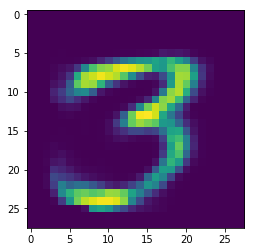

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  14



  0%|          | 1/214 [00:02<09:06,  2.57s/it]

[3 7 4 6 0 7 1 9 8 8 3 5 4 1 0 8 0 9 0 3 7 8 0 1 4 7 9 1 6 5 6 2 1 8 3 1 4
 6 8 2 5 1 6 8 8 9 7 3 1 1 1 2 6 3 7 7 6 3 2 6 0 6 5 5 0 5 5 8 1 5 9 8 4 5
 7 2 2 6 8 5 6 6 7 2 6 4 7 9 1 6 3 7 9 3 4 6 9 1 2 5 1 3 8 5 0 3 3 8 8 7 1
 4 0 9 2 5 6 9 9 6 9 5 3 0 6 3 4 8 4 0 0 9 9 0 4 0 5 3 3 2 4 9 3 0 6 5 0 5
 7 7 9 1 6 9 2 2 9 7 8 9 8 2 1 9 4 9 9 9 7 2 3 6 1 9 7 4 4 7 5 0 6 0 1 3 2
 1 4 7 1 5 1 2 0 0 5 5 7 9 9 4 7 2 9 7 0 7 6 0 5 9 3 3 8 0 9 0 2 0 0 5 4 0
 0 8 1 6 3 6 1 9 2 1 8 0 4 3 1 3 4 2 7 2 2 7 1 6 8 8 6 7 9 3 3 9 2 6]
[3 7 4 6 0 7 1 9 8 8 3 5 4 1 0 8 0 9 0 3 7 8 0 1 4 7 9 1 6 5 6 2 1 8 3 1 4
 6 8 2 5 1 6 8 8 9 7 3 1 1 1 2 6 3 7 7 6 3 2 6 0 6 5 5 0 5 5 8 1 5 9 8 4 5
 7 2 2 6 8 5 6 6 7 2 6 4 7 9 1 6 3 7 9 3 4 6 9 1 2 5 1 3 8 5 0 3 3 8 8 7 1
 4 0 9 2 5 6 9 9 6 9 5 3 0 6 3 4 8 4 0 0 9 9 0 4 0 5 3 3 2 4 9 3 0 6 5 0 5
 7 7 9 1 6 9 2 2 9 7 8 9 8 2 1 9 4 9 9 9 7 2 3 6 1 9 7 4 4 7 5 0 6 0 1 3 2
 1 4 7 1 5 1 2 0 0 5 5 7 9 9 4 7 2 9 7 0 7 6 0 5 9 3 3 8 0 9 0 2 0 0 5 4 0
 0 8 1 6 3 6 1 9 2 1 8 0 4 3 1


  1%|          | 2/214 [00:05<09:13,  2.61s/it]

[7 6 4 5 7 0 5 9 4 4 9 4 8 5 0 6 2 1 4 0 4 7 7 2 3 0 0 9 7 5 0 9 8 4 0 6 1
 6 4 9 1 5 8 1 1 7 7 5 9 3 3 3 8 8 8 2 1 8 5 8 9 4 6 5 8 1 0 9 2 1 9 2 1 2
 0 4 9 6 1 6 3 7 0 7 6 7 5 0 4 1 7 8 6 3 9 4 0 5 6 2 4 2 3 0 1 4 2 3 9 1 2
 9 6 7 0 2 2 7 7 6 3 9 4 1 1 8 3 6 2 9 4 9 6 0 1 9 0 2 2 3 3 1 9 6 6 9 7 4
 7 1 8 3 8 6 7 8 2 5 2 2 8 3 4 2 9 5 1 7 2 0 6 8 4 7 1 7 8 1 1 4 6 9 5 4 4
 7 9 1 8 9 7 6 2 5 4 0 5 9 0 4 7 3 5 5 2 7 1 0 8 6 0 0 3 0 2 0 1 4 5 6 3 1
 2 7 7 7 5 2 8 7 6 4 0 9 9 8 1 9 5 4 5 6 3 1 6 7 2 7 8 9 1 0 2 2 1 6]
[7 6 4 5 7 0 5 9 4 4 9 4 8 5 0 6 2 1 4 0 4 7 7 2 3 0 0 9 7 5 0 9 8 4 0 6 1
 6 4 9 1 5 8 1 1 7 7 5 9 3 3 3 8 8 8 2 1 8 5 8 9 4 6 5 8 1 0 9 2 1 9 2 1 2
 0 4 9 6 1 6 3 7 0 7 6 7 5 0 4 1 7 8 6 3 9 4 0 5 6 2 4 2 3 0 1 4 2 3 9 1 2
 9 6 7 0 2 2 7 7 6 3 9 4 1 1 8 3 6 2 9 4 9 6 0 1 9 0 2 2 3 3 1 9 6 6 9 7 4
 7 1 8 3 8 6 7 8 2 5 2 2 8 3 4 2 9 5 1 7 2 0 6 8 4 7 1 7 8 1 1 4 6 9 5 4 4
 7 9 1 8 9 7 6 2 5 4 0 5 9 0 4 7 3 5 5 2 7 1 0 8 6 0 0 3 0 2 0 1 4 5 6 3 1
 2 7 7 7 5 2 8 7 6 4 0 9 9 8 1


  1%|▏         | 3/214 [00:07<09:18,  2.65s/it]

[2 5 4 9 0 9 5 6 7 1 1 1 7 1 8 7 7 3 4 1 6 4 0 8 9 0 5 9 5 6 9 9 4 5 4 4 7
 9 7 6 3 4 9 0 0 4 6 2 4 4 8 3 7 7 3 8 3 6 2 4 1 9 7 9 7 3 6 2 4 8 1 5 0 3
 2 0 5 3 1 7 9 3 0 8 0 1 0 8 2 4 7 2 5 0 2 4 0 8 4 5 9 5 0 4 8 3 7 0 8 2 3
 1 2 0 1 0 7 4 7 0 8 7 5 1 1 1 7 3 4 3 3 0 5 3 0 3 1 7 0 5 2 1 0 6 1 7 3 0
 5 2 7 6 0 2 6 9 9 1 7 6 6 1 3 7 7 3 8 8 7 0 5 3 5 7 4 6 5 1 8 4 4 5 0 0 7
 7 6 5 7 8 9 5 9 4 4 6 0 6 2 1 6 7 7 6 0 1 0 1 6 8 3 1 5 5 3 2 1 4 9 7 9 8
 9 6 4 8 6 8 0 2 3 0 2 9 4 2 1 8 9 6 6 2 4 9 5 4 5 3 5 4 1 4 3 0 2 5]
[2 5 4 9 0 9 5 6 7 1 1 1 7 1 8 7 7 3 4 1 6 4 0 8 9 0 5 9 5 6 9 9 4 5 4 4 7
 9 7 6 3 4 9 0 0 4 6 2 4 4 8 3 7 7 3 8 3 6 2 4 1 9 7 9 7 3 6 2 4 8 1 5 0 3
 2 0 5 3 1 7 9 3 0 8 0 1 0 8 2 4 7 2 5 0 2 4 0 8 4 5 9 5 0 4 8 3 7 0 8 2 3
 1 2 0 1 0 7 4 7 0 8 7 5 1 1 1 7 3 4 3 3 0 5 5 0 3 1 7 0 5 2 1 0 6 1 7 3 0
 5 2 7 6 0 2 6 9 9 1 7 6 6 1 3 7 7 3 8 8 7 0 5 3 5 7 4 6 5 1 8 4 4 5 0 0 7
 7 6 5 7 8 9 5 9 4 4 6 0 6 2 1 6 7 7 6 0 1 0 1 6 8 3 1 5 5 3 2 1 4 9 7 9 8
 9 6 4 8 6 8 0 2 3 0 2 9 4 2 1


  2%|▏         | 4/214 [00:10<09:16,  2.65s/it]

[5 6 0 5 3 8 7 2 1 7 4 6 8 6 6 5 5 2 6 4 6 7 5 6 3 1 4 5 5 4 9 7 5 0 9 2 7
 9 2 7 0 6 1 0 8 7 6 8 0 8 4 0 5 1 2 6 5 7 7 0 9 1 8 0 6 8 7 4 2 2 8 0 8 1
 1 0 2 6 4 7 2 5 8 8 1 2 4 0 2 5 2 4 0 8 2 8 1 2 8 9 4 3 3 9 7 3 0 6 7 5 2
 4 2 0 7 7 5 1 7 2 8 7 4 0 3 5 2 4 0 3 8 5 5 6 2 4 8 4 2 4 7 5 5 2 2 1 1 2
 9 3 5 5 9 1 7 4 4 1 7 4 6 1 5 5 0 1 7 7 1 2 1 4 4 4 2 6 7 5 7 0 8 0 4 5 1
 7 6 1 7 3 1 5 9 3 8 2 3 0 0 3 6 0 1 2 6 1 6 2 0 1 1 2 4 7 0 7 8 2 2 0 8 0
 8 3 6 9 1 3 3 2 7 2 9 8 1 0 9 2 6 7 1 6 1 6 3 7 8 7 7 5 3 5 0 2 2 3]
[5 6 0 5 3 8 7 2 1 7 4 6 8 6 6 5 5 2 6 4 6 7 5 6 3 1 4 5 5 4 9 7 5 0 9 2 7
 9 2 7 0 6 1 0 8 7 6 8 0 8 4 0 5 1 2 6 5 7 7 0 9 1 8 0 6 8 7 4 2 2 8 0 8 1
 1 0 2 6 4 7 2 5 8 8 1 2 4 0 2 5 2 4 0 8 2 8 1 2 8 9 4 3 3 9 7 3 0 6 7 5 2
 4 2 0 7 7 5 1 7 2 8 7 4 0 3 5 2 4 0 3 8 5 5 6 2 4 8 4 2 4 7 5 5 2 2 1 1 2
 9 3 5 5 9 1 7 4 4 1 7 4 6 1 5 5 0 1 7 7 1 2 1 4 4 4 2 6 7 5 7 0 8 0 4 5 1
 7 6 1 7 3 1 5 9 3 8 2 3 0 0 3 6 0 1 2 6 1 6 2 0 1 1 2 4 7 0 7 8 2 2 0 8 0
 8 3 6 9 1 3 3 2 7 2 9 8 1 0 9


  2%|▏         | 5/214 [00:13<09:16,  2.66s/it]

[8 5 2 7 5 6 6 8 8 6 2 9 2 2 6 2 6 0 8 5 0 6 5 9 2 7 2 1 9 3 9 9 6 9 0 8 9
 9 6 1 6 4 7 5 8 2 6 7 4 6 2 1 0 3 4 1 0 3 7 5 7 9 1 9 9 6 5 0 7 8 1 7 8 8
 4 8 9 7 3 8 9 2 4 9 4 2 3 1 2 0 0 3 3 0 9 6 1 6 2 1 4 0 9 2 8 4 4 2 2 6 3
 2 1 2 9 3 0 4 2 6 1 3 5 0 8 3 6 3 4 3 8 5 3 4 6 7 5 4 3 2 2 5 3 8 2 9 6 2
 0 7 2 3 3 5 0 4 8 9 3 3 2 7 7 6 3 1 5 4 1 3 1 9 4 7 7 7 4 2 6 4 3 1 1 4 9
 2 6 6 3 1 7 9 7 0 0 1 0 1 5 7 8 0 7 8 1 9 7 7 8 0 2 5 6 4 0 9 6 2 4 6 6 7
 1 9 1 3 8 3 9 6 6 2 3 9 3 2 1 8 4 7 9 1 0 8 2 4 5 1 3 4 4 3 7 6 1 5]
[8 5 2 7 5 6 6 8 8 6 2 9 2 2 6 2 6 0 8 5 0 6 5 9 2 7 2 1 9 3 9 9 6 9 0 8 9
 9 6 1 6 4 7 5 8 2 6 7 4 6 2 1 0 3 4 1 0 3 7 5 7 9 1 9 9 6 5 0 7 8 1 7 8 8
 4 8 9 7 3 8 9 2 4 9 4 2 3 1 2 0 0 3 3 0 9 6 1 6 2 1 4 0 9 2 8 4 4 2 2 6 3
 2 1 2 9 3 0 4 2 6 1 3 5 0 8 3 6 3 4 3 8 5 3 4 6 7 5 4 3 2 2 5 3 8 2 9 6 2
 0 7 2 3 3 5 0 4 8 9 3 3 2 7 7 6 3 1 5 4 1 3 1 9 4 7 7 7 4 2 6 4 3 1 1 4 9
 2 6 6 3 1 7 9 7 0 0 1 0 1 5 7 8 0 7 8 1 9 7 7 8 0 2 5 6 4 0 9 6 2 4 6 6 7
 1 9 1 3 8 3 9 6 6 2 3 9 3 2 1


  3%|▎         | 6/214 [00:16<09:16,  2.68s/it]

[8 0 3 6 1 2 2 1 9 4 2 8 7 3 9 1 6 6 7 7 1 2 4 1 3 4 4 0 4 4 9 6 9 9 8 3 9
 3 9 6 3 5 1 0 7 0 7 5 3 9 2 4 2 0 4 3 5 2 0 7 4 2 4 2 1 4 9 5 9 1 9 1 8 0
 3 1 8 8 8 3 8 7 8 3 4 8 3 8 5 0 8 2 9 9 5 0 7 9 9 3 0 8 9 8 2 7 5 5 5 8 8
 2 8 8 2 9 5 2 4 2 1 4 4 0 9 9 4 9 1 2 5 6 5 1 9 0 7 9 0 8 1 2 6 6 8 7 0 6
 7 2 3 0 2 1 3 2 4 0 4 1 9 6 5 6 7 7 8 8 0 3 4 7 0 5 0 3 5 2 9 3 7 7 7 8 0
 1 2 5 0 0 3 2 7 4 9 9 0 2 9 1 9 5 5 2 7 3 7 3 5 2 8 8 6 0 0 3 0 1 2 1 3 4
 1 5 3 4 1 9 6 8 3 7 9 0 4 8 3 6 4 2 3 8 8 7 5 6 8 9 6 9 9 2 4 1 2 1]
[8 0 3 6 1 2 2 1 9 4 2 8 7 3 9 1 6 6 7 7 1 2 4 1 3 4 4 0 4 4 9 6 9 9 8 3 9
 3 9 6 3 5 1 0 7 0 7 5 3 9 2 4 2 0 4 3 5 2 0 7 4 2 4 2 1 4 9 5 9 1 9 1 8 0
 3 1 8 8 8 3 8 7 8 3 4 8 3 8 5 0 8 2 9 9 5 0 7 9 9 3 0 8 9 8 2 7 5 5 5 8 8
 2 8 8 2 9 5 2 4 2 1 4 4 0 9 9 4 9 1 2 5 6 5 1 9 0 7 9 0 8 1 2 6 6 8 7 0 6
 7 2 3 0 2 1 3 2 4 0 4 1 9 6 5 6 7 7 8 8 0 3 4 7 0 5 0 3 5 2 9 3 7 7 7 8 0
 1 2 5 0 0 3 2 7 4 9 9 0 2 9 1 9 5 5 2 7 3 7 3 5 2 8 8 6 0 0 3 0 1 2 1 3 4
 1 5 3 4 1 9 6 8 3 7 9 0 4 8 3


  3%|▎         | 7/214 [00:18<09:12,  2.67s/it]

[2 6 9 8 6 1 8 6 8 3 8 1 5 3 7 1 2 2 0 3 5 2 7 9 5 8 2 0 2 7 1 0 4 6 0 4 8
 8 3 5 1 6 7 4 6 9 5 3 3 2 6 7 7 1 1 0 4 9 8 3 8 9 0 2 1 1 0 9 5 6 3 7 4 8
 7 9 9 3 4 7 3 4 7 8 6 9 2 1 6 1 7 1 5 0 5 8 9 1 9 8 2 1 3 3 9 3 8 5 7 1 6
 8 4 6 2 0 2 9 0 9 6 5 1 4 8 6 8 5 6 3 4 4 4 3 6 7 2 6 8 3 8 5 9 9 2 5 1 2
 4 0 8 2 3 3 6 0 3 0 0 6 2 3 7 1 7 9 1 5 8 8 9 2 7 0 0 5 5 3 2 2 3 9 4 6 7
 3 8 9 9 1 7 1 8 4 7 7 3 5 1 6 7 2 4 5 2 7 8 3 4 0 6 4 9 8 1 7 0 5 9 1 7 2
 9 9 2 9 3 3 5 7 8 0 7 9 7 0 2 4 9 5 0 2 1 4 4 5 4 2 4 0 0 9 5 3 8 2]
[2 6 9 8 6 1 8 6 8 3 8 1 5 3 7 1 2 2 0 3 5 2 7 9 5 8 2 0 2 7 1 0 4 6 0 4 8
 8 3 5 1 6 7 4 6 9 5 3 3 2 6 7 7 1 1 0 4 9 8 3 8 9 0 2 1 1 0 9 5 6 3 7 4 8
 7 9 9 3 4 7 3 4 7 8 6 9 2 1 6 1 7 1 5 0 5 8 9 1 9 8 2 1 3 3 9 3 8 5 7 1 6
 8 4 6 2 0 2 9 0 9 6 5 1 4 8 6 8 5 6 3 4 4 4 3 6 7 2 6 8 3 8 5 9 9 2 5 1 2
 4 0 8 2 3 3 6 0 3 0 0 6 2 3 7 1 7 9 1 5 8 8 9 2 7 0 0 5 5 3 2 2 3 9 4 6 7
 3 8 9 9 1 7 1 8 4 7 7 3 5 1 6 7 2 4 5 2 7 8 3 4 0 6 4 9 8 1 7 0 5 9 1 7 2
 9 9 2 9 3 3 5 7 8 0 7 9 7 0 2


  4%|▎         | 8/214 [00:21<09:09,  2.67s/it]

[0 2 1 2 1 3 0 8 5 9 2 6 0 6 7 0 8 6 3 4 8 4 2 2 9 0 4 9 1 2 4 7 2 9 3 6 2
 3 7 6 4 1 2 8 8 4 8 7 6 4 7 5 9 1 9 0 7 1 0 3 3 3 3 1 3 9 0 8 9 3 3 6 2 5
 9 9 4 0 4 1 5 6 5 1 2 9 2 5 5 0 0 1 4 1 1 7 2 0 8 9 9 4 7 8 8 6 0 5 2 7 8
 9 8 5 5 1 7 4 9 8 9 0 7 7 2 5 0 1 4 8 1 0 2 0 7 5 5 9 3 8 4 6 2 1 5 8 2 3
 6 6 5 5 1 9 6 0 4 3 9 7 9 9 7 6 4 1 6 2 1 0 2 6 4 4 7 5 6 9 7 4 7 7 7 3 3
 6 9 2 6 1 2 0 9 0 6 8 3 6 5 8 2 7 6 8 5 9 4 6 6 1 7 7 5 8 3 8 9 5 2 1 9 8
 6 3 8 2 2 2 6 6 7 0 8 9 6 0 4 1 1 5 6 7 1 5 8 3 0 4 4 4 3 9 3 6 2 6]
[0 2 1 2 1 3 0 8 5 9 2 6 0 6 7 0 8 6 3 4 8 4 2 2 9 0 4 9 1 2 4 7 2 9 3 6 2
 3 7 6 4 1 2 8 8 4 8 7 6 4 7 5 9 1 9 0 7 1 0 3 3 3 3 1 3 9 0 8 9 3 3 6 2 5
 9 9 4 0 4 1 5 6 5 1 2 9 2 5 5 0 0 1 4 1 1 7 2 0 8 9 9 4 7 8 8 6 0 5 2 7 8
 9 8 5 5 1 7 4 9 8 9 0 7 7 2 5 0 1 4 8 1 0 2 0 7 5 5 9 3 8 4 6 2 1 5 8 2 3
 6 6 5 5 1 9 6 0 4 3 9 7 9 9 7 6 4 1 6 2 1 0 2 6 4 4 7 5 6 9 7 4 7 7 7 3 3
 6 9 2 6 1 2 0 9 0 6 8 3 6 5 8 2 7 6 8 5 9 4 6 6 1 7 7 5 8 3 8 9 5 2 1 9 8
 6 3 8 2 2 2 6 6 7 0 8 9 6 0 4


  4%|▍         | 9/214 [00:23<09:00,  2.64s/it]

[5 7 8 0 4 1 3 6 6 2 7 3 0 1 0 2 9 3 9 6 5 0 2 4 4 5 1 7 9 2 4 1 1 1 4 7 7
 4 8 4 7 9 6 6 2 7 7 5 9 5 9 8 0 8 1 1 1 9 3 2 0 5 6 8 7 0 8 0 6 9 8 3 0 6
 2 2 8 6 2 5 2 6 8 6 7 9 1 1 3 4 6 1 8 3 0 0 8 2 2 2 9 3 5 0 6 8 3 5 9 1 3
 5 9 1 6 6 5 0 7 2 6 4 5 5 3 6 9 3 7 6 8 0 3 6 5 5 3 2 6 5 7 0 3 8 4 6 1 5
 3 7 3 5 5 8 1 4 5 2 1 5 5 1 0 7 8 9 4 1 1 1 8 0 3 8 4 5 2 3 9 1 5 6 5 5 8
 8 0 4 2 0 8 5 4 5 8 1 8 8 5 6 0 8 9 9 6 5 4 7 0 1 1 2 1 9 1 2 9 3 4 8 0 5
 0 9 1 5 0 5 6 9 0 3 2 0 8 7 6 9 2 9 6 2 0 6 0 5 9 9 4 6 7 7 7 3 3 9]
[5 7 8 0 4 1 3 6 6 2 7 3 0 1 0 2 9 3 9 6 5 0 2 4 4 5 1 7 9 2 4 1 1 1 4 7 7
 4 8 4 7 9 6 6 2 7 7 5 9 5 9 8 0 8 1 1 1 9 3 2 0 5 6 8 7 0 8 0 6 9 8 3 0 6
 2 2 8 6 2 5 2 6 8 6 7 9 1 1 3 4 6 1 8 3 0 0 8 2 2 2 9 3 5 0 6 8 3 5 9 1 3
 5 9 1 6 6 5 0 7 2 6 4 5 5 3 6 9 3 7 6 8 0 3 6 5 5 3 2 6 5 7 0 3 8 4 6 1 5
 3 7 3 5 5 8 1 4 5 2 1 5 5 1 0 7 8 9 4 1 1 1 8 0 3 8 4 5 2 3 9 1 5 6 5 5 8
 8 0 4 2 0 8 5 4 5 8 1 8 8 5 6 0 8 9 9 6 5 4 7 0 1 1 2 1 9 1 2 9 3 4 8 0 5
 0 9 1 5 0 5 6 9 0 3 2 0 8 7 6


  5%|▍         | 10/214 [00:25<08:49,  2.60s/it]

[2 9 7 1 2 5 1 7 9 3 1 7 7 9 2 7 2 2 6 3 7 3 9 8 9 2 5 2 0 2 4 3 6 7 4 8 3
 2 1 0 6 7 0 4 3 8 2 3 4 2 7 3 1 9 6 8 5 5 0 3 5 6 9 0 1 1 2 9 2 0 6 0 0 4
 2 9 2 9 9 6 1 6 0 2 6 9 5 3 3 6 6 3 7 6 2 2 8 5 9 1 6 6 8 1 1 2 5 2 3 6 9
 3 3 1 1 3 4 4 4 5 8 4 0 7 1 5 0 0 1 9 8 4 8 1 4 9 8 4 0 2 9 7 9 3 2 3 8 0
 8 5 6 3 9 6 2 0 5 2 3 4 2 8 1 6 2 6 3 1 2 5 9 1 5 6 5 5 6 8 4 2 5 1 9 4 4
 5 3 8 0 6 7 1 8 8 8 2 5 8 4 0 0 7 1 3 2 0 4 2 8 9 8 2 7 8 2 0 1 9 0 3 6 2
 4 1 6 8 1 7 0 2 1 7 8 2 2 3 7 0 3 2 0 1 7 3 1 8 1 8 7 7 9 9 9 5 6 2]
[2 9 7 1 2 5 1 7 9 3 1 7 7 9 2 7 2 2 6 3 7 3 9 8 9 2 5 2 0 2 4 3 6 7 4 8 3
 2 1 0 6 7 0 4 3 8 2 3 4 2 7 3 1 9 6 8 5 5 0 3 5 6 9 0 1 1 2 9 2 0 6 0 0 4
 2 9 2 9 9 6 1 6 0 2 6 9 5 3 3 6 6 3 7 6 2 2 8 5 9 1 6 6 8 1 1 2 5 2 3 6 9
 3 3 1 1 3 4 4 4 5 8 4 0 7 1 5 0 0 1 9 8 4 8 1 4 9 8 4 0 2 9 7 9 3 2 3 8 0
 8 5 6 3 9 6 2 0 5 2 3 4 2 8 1 6 2 6 3 1 2 5 9 1 5 6 5 5 6 8 4 2 5 1 9 4 4
 5 3 8 0 6 7 1 8 8 8 2 5 8 4 0 0 7 1 3 2 0 4 2 8 9 8 2 7 8 2 0 1 9 0 3 6 2
 4 1 6 8 1 7 0 2 1 7 8 2 2 3 7


  5%|▌         | 11/214 [00:28<08:40,  2.57s/it]

[6 3 2 1 2 0 8 6 4 6 8 3 9 7 6 4 0 7 5 6 1 1 2 1 6 3 6 2 1 4 7 7 4 8 3 0 6
 1 5 2 1 3 0 7 1 6 4 6 2 4 8 1 9 8 4 5 8 4 6 7 2 3 2 8 5 4 0 3 1 1 6 9 6 9
 8 9 0 6 0 9 8 6 0 4 7 2 2 3 7 9 7 8 1 8 6 6 8 9 5 2 4 1 6 3 4 3 3 1 1 3 0
 8 2 5 1 4 4 9 8 8 0 7 1 3 7 9 4 4 1 0 9 4 2 2 4 5 8 2 1 5 2 9 0 6 0 2 2 3
 2 7 6 3 6 4 7 2 8 8 3 4 6 7 4 6 3 8 1 3 6 3 1 7 1 0 4 3 3 7 9 4 1 6 8 3 8
 1 4 4 9 9 9 2 7 0 9 4 8 4 1 3 1 4 6 0 1 4 0 2 2 4 4 8 7 6 5 4 6 9 0 0 3 1
 0 2 2 8 4 2 8 0 9 8 5 7 3 8 1 0 2 7 8 3 7 1 9 7 8 7 7 5 2 9 1 5 2 4]
[6 3 2 1 2 0 8 6 4 6 8 3 9 7 6 4 0 7 5 6 1 1 2 1 6 3 6 2 1 4 7 7 4 8 3 0 6
 1 5 2 1 3 0 7 1 6 4 6 2 4 8 1 9 8 4 5 8 4 6 7 2 3 2 8 5 4 0 3 1 1 6 9 6 9
 8 9 0 6 0 9 8 6 0 4 7 2 2 3 7 9 7 8 1 8 6 6 8 9 5 2 4 1 6 3 4 3 3 1 1 3 0
 8 2 5 1 4 4 9 8 8 0 7 1 3 7 9 4 4 1 0 9 4 2 2 4 5 8 2 1 5 2 9 0 6 0 2 2 3
 2 7 6 3 6 4 7 2 8 8 3 4 6 7 4 6 3 8 1 3 6 3 1 7 1 0 4 3 3 7 9 4 1 6 8 3 8
 1 4 4 9 9 9 2 7 0 9 4 8 4 1 3 1 4 6 0 1 4 0 2 2 4 4 8 7 6 5 4 6 9 0 0 3 1
 0 2 2 8 4 2 8 0 9 8 5 7 3 8 1


  6%|▌         | 12/214 [00:30<08:31,  2.53s/it]

[5 2 0 9 2 6 1 6 0 1 4 1 7 4 5 6 9 6 8 6 9 4 9 6 8 6 7 0 8 0 1 5 4 4 7 4 6
 3 0 7 5 1 3 7 9 5 2 4 8 2 2 9 1 1 2 7 3 0 5 4 7 0 7 0 3 9 7 9 2 6 8 1 4 9
 7 9 5 2 7 0 0 6 8 7 3 3 1 8 6 5 1 0 2 7 1 6 1 2 4 4 2 6 4 2 1 0 1 5 9 7 2
 9 2 0 0 2 8 8 7 2 9 8 4 8 7 1 0 7 1 0 7 6 4 9 8 2 8 2 7 4 3 4 4 8 3 8 8 8
 1 6 4 6 3 6 5 2 8 4 9 3 3 0 1 9 8 5 6 3 1 8 0 2 0 9 3 6 2 9 7 7 7 1 3 9 9
 8 0 5 0 7 3 5 5 0 1 3 7 9 3 7 9 6 5 2 9 3 2 0 5 3 5 4 2 1 0 4 4 8 3 5 5 4
 1 6 1 3 1 7 4 7 2 7 1 0 5 0 7 8 5 8 1 1 0 0 1 2 1 7 3 8 6 5 3 8 5 2]
[5 2 0 9 2 6 1 6 0 1 4 1 7 4 5 6 9 6 8 6 9 4 9 6 8 6 7 0 8 0 1 5 4 4 7 4 6
 3 0 7 5 1 3 7 9 5 2 4 8 2 2 9 1 1 2 7 3 0 5 4 7 0 7 0 3 9 7 9 2 6 8 1 4 9
 7 9 5 2 7 0 0 6 8 7 3 3 1 8 6 5 1 0 2 7 1 6 1 2 4 4 2 6 4 2 1 0 1 5 9 7 2
 9 2 0 0 2 8 8 7 2 9 8 4 8 7 1 0 7 1 0 7 6 4 9 8 2 8 2 7 4 3 4 4 8 3 8 8 8
 1 6 4 6 3 6 5 2 8 4 9 3 3 0 1 9 8 5 6 3 1 8 0 2 0 9 3 6 2 9 7 7 7 1 3 9 9
 8 0 5 0 7 3 5 5 0 1 3 7 9 3 7 9 6 5 2 9 3 2 0 5 3 5 4 2 1 0 4 4 8 3 5 5 4
 1 6 1 3 1 7 4 7 2 7 1 0 5 0 7


  6%|▌         | 13/214 [00:32<08:22,  2.50s/it]

[0 5 3 8 5 1 7 2 3 9 3 6 6 9 1 4 8 8 6 0 1 4 6 8 2 1 3 4 4 0 4 6 1 6 4 9 7
 2 4 3 5 2 3 6 3 9 2 2 5 6 1 4 6 2 9 8 1 7 6 6 0 8 7 3 6 7 8 7 9 7 4 2 2 1
 9 4 9 2 0 5 9 6 1 3 7 4 8 6 4 5 0 3 0 8 5 6 1 5 6 7 3 1 0 2 4 8 0 5 9 5 9
 4 2 7 0 4 6 8 5 0 4 3 7 4 2 8 0 6 6 5 0 1 1 0 2 0 0 6 3 0 9 9 2 3 9 4 5 4
 4 0 7 9 8 0 4 0 9 9 1 4 5 0 5 8 1 4 1 1 1 8 4 4 6 9 0 2 5 9 8 3 7 1 4 1 5
 3 7 8 9 7 3 8 4 8 4 0 7 6 8 0 5 6 1 0 4 0 7 6 6 9 3 6 7 0 1 0 7 0 3 6 1 7
 8 1 0 5 8 5 8 2 6 9 9 6 2 6 1 0 8 1 6 5 2 4 6 0 6 6 0 4 2 9 9 9 7 3]
[0 5 3 8 5 1 7 2 3 9 3 6 6 9 1 4 8 8 6 0 1 4 6 8 2 1 3 4 4 0 4 6 1 6 4 9 7
 2 4 3 5 2 3 6 3 9 2 2 5 6 1 4 6 2 9 8 1 7 6 6 0 8 7 3 6 7 8 7 9 7 4 2 2 1
 9 4 9 2 0 5 9 6 1 3 7 4 8 6 4 5 0 3 0 8 5 6 1 5 6 7 3 1 0 2 4 8 0 5 9 5 9
 4 2 7 0 4 6 8 5 0 4 3 7 4 2 8 0 6 6 5 0 1 1 0 2 0 0 6 3 0 9 9 2 3 9 4 5 4
 4 0 7 9 8 0 4 0 9 9 1 4 5 0 5 8 1 4 1 1 1 8 4 4 6 9 0 2 5 9 8 3 7 1 4 1 5
 3 7 8 9 7 3 8 4 8 4 0 7 6 8 0 5 6 1 0 4 0 7 6 6 9 3 6 7 0 1 0 7 0 3 6 1 7
 8 1 0 5 8 5 8 2 6 9 9 6 2 6 1


  7%|▋         | 14/214 [00:34<08:17,  2.49s/it]

[1 3 3 5 4 8 2 5 3 3 9 2 7 3 9 6 8 6 7 3 4 1 1 9 2 7 6 4 3 5 2 3 1 3 9 6 5
 7 7 8 3 2 0 1 4 2 6 4 7 7 4 9 3 7 8 4 3 2 5 7 1 6 8 6 9 7 9 8 3 6 6 0 2 4
 0 9 6 2 2 1 1 6 4 3 2 1 3 0 1 2 9 0 6 6 4 1 3 3 6 8 8 6 5 7 0 6 5 3 8 1 2
 1 5 0 1 9 8 8 6 5 1 2 4 8 4 3 8 8 8 2 8 6 1 0 9 8 2 0 7 0 3 2 0 3 4 7 3 3
 7 8 4 7 3 8 0 6 8 4 5 5 3 8 1 4 8 6 3 3 7 9 7 2 0 2 2 2 9 6 2 4 9 3 8 2 0
 2 7 5 4 1 3 6 4 0 3 7 3 7 5 2 4 5 2 6 7 0 2 1 4 6 3 3 4 9 3 9 8 9 5 7 1 3
 4 0 1 8 9 9 8 6 7 0 3 8 8 7 9 3 7 3 7 8 9 3 2 5 1 7 6 2 6 9 3 8 1 7]
[1 3 3 5 4 8 2 5 3 3 9 2 7 3 9 6 8 6 7 3 4 1 1 9 2 7 6 4 3 5 2 3 1 3 9 6 5
 7 7 8 3 2 0 1 4 2 6 4 7 7 4 9 3 7 8 4 3 2 5 7 1 6 8 6 9 7 9 8 3 6 6 0 2 4
 0 9 6 2 2 1 1 6 4 3 2 1 3 0 1 2 9 0 6 6 4 1 3 3 6 8 8 6 5 7 0 6 5 3 8 1 2
 1 5 0 1 9 8 8 6 5 1 2 4 8 4 3 8 8 8 2 8 6 1 0 9 8 2 0 7 0 3 2 0 3 4 7 3 3
 7 8 4 7 3 8 0 6 8 4 5 5 3 8 1 4 8 6 3 3 7 9 7 2 0 2 2 2 9 6 2 4 9 3 8 2 0
 2 7 5 4 1 3 6 4 0 3 7 3 7 5 2 4 5 2 6 7 0 2 1 4 6 3 3 4 9 3 9 8 9 5 7 1 3
 4 0 1 8 9 9 8 6 7 0 3 8 8 7 9


  7%|▋         | 15/214 [00:37<08:12,  2.48s/it]

[5 0 9 2 3 9 2 4 0 8 3 1 4 6 2 4 8 4 2 8 3 2 6 3 3 4 9 6 3 1 7 6 7 8 6 7 5
 5 7 0 0 1 7 1 1 3 6 8 1 0 8 5 4 4 4 3 6 6 2 9 3 3 0 0 1 7 2 4 4 6 8 2 5 7
 0 9 6 4 9 3 0 0 4 1 9 8 5 6 8 5 9 3 6 1 2 0 2 9 9 6 3 3 1 0 3 3 9 7 9 2 2
 0 3 7 5 7 7 0 5 9 1 4 5 7 8 8 8 3 3 6 8 2 6 6 5 6 9 4 4 2 0 7 9 0 7 2 7 8
 3 6 1 1 1 6 4 8 5 8 2 0 4 5 7 5 1 4 6 9 0 4 6 2 6 5 4 9 5 9 8 3 6 4 5 2 8
 0 0 3 7 2 6 2 3 1 9 7 1 4 3 9 8 2 3 7 1 1 4 1 6 7 4 8 4 1 3 7 1 8 4 1 2 0
 6 4 9 0 0 1 8 6 3 9 7 1 6 8 4 3 6 2 7 8 8 4 2 1 4 1 2 0 7 4 1 6 5 2]
[5 0 9 2 3 9 2 4 0 8 3 1 4 6 2 4 8 4 2 8 3 2 6 3 3 4 9 6 3 1 7 6 7 8 6 7 5
 5 7 0 0 1 7 1 1 3 6 8 1 0 8 5 4 4 4 3 6 6 2 9 3 3 0 0 1 7 2 4 4 6 8 2 5 7
 0 9 6 4 9 3 0 0 4 1 9 8 5 6 8 5 9 3 6 1 2 0 2 9 9 6 3 3 1 0 3 3 9 7 9 2 2
 0 3 7 5 7 7 0 5 9 1 4 5 7 8 8 8 3 3 6 8 2 6 6 5 6 9 4 4 2 0 7 9 0 7 2 7 8
 3 6 1 1 1 6 4 8 5 8 2 0 4 5 7 5 1 4 6 9 0 4 6 2 6 5 4 9 5 9 8 3 6 4 5 2 8
 0 0 3 7 2 6 2 3 1 9 7 1 4 3 9 8 2 3 7 1 1 4 1 6 7 4 8 4 1 3 7 1 8 4 1 2 0
 6 4 9 0 0 1 8 6 3 9 7 1 6 8 4


  7%|▋         | 16/214 [00:39<08:07,  2.46s/it]

[1 8 6 5 2 0 7 2 6 6 2 2 4 1 1 2 4 4 2 6 0 6 8 9 3 2 8 5 5 6 4 6 7 6 6 3 7
 8 6 4 9 5 9 8 1 6 3 2 7 8 7 5 4 2 4 2 3 5 9 4 7 1 1 6 4 4 7 7 9 0 6 7 3 5
 6 6 2 9 8 7 0 0 6 1 7 2 3 1 7 5 7 0 7 7 4 1 0 1 3 1 5 3 2 2 4 2 7 6 2 7 7
 8 6 9 5 4 6 2 6 7 8 9 3 6 6 3 3 9 0 5 8 0 7 4 1 3 8 7 4 3 1 5 8 7 6 7 2 1
 6 7 6 6 9 7 7 9 8 2 1 0 6 1 1 6 5 1 3 1 7 4 4 3 3 4 3 4 9 3 9 8 3 2 6 1 9
 8 3 3 2 8 2 2 2 0 8 0 4 4 1 0 9 7 4 8 1 7 7 0 8 5 6 7 2 5 4 9 3 0 3 1 2 9
 9 8 7 6 6 4 5 4 2 9 2 2 7 5 7 7 2 1 6 1 2 8 4 6 4 4 0 5 9 1 9 7 7 3]
[1 8 6 5 2 0 7 2 6 6 2 2 4 1 1 2 4 4 2 6 0 6 8 9 3 2 8 5 5 6 4 6 7 6 6 3 7
 8 6 4 9 5 9 8 1 6 3 2 7 8 7 5 4 2 4 2 3 5 9 4 7 1 1 6 4 4 7 7 9 0 6 7 3 5
 6 6 2 9 8 7 0 0 6 1 7 2 3 1 7 5 7 0 7 7 4 1 0 1 3 1 5 3 2 2 4 2 7 6 2 7 7
 8 6 9 5 4 6 2 6 7 8 9 3 6 6 3 3 9 0 5 8 0 7 4 1 3 8 7 4 3 1 5 8 7 6 7 2 1
 6 7 6 6 9 7 7 9 8 2 1 0 6 1 1 6 5 1 3 1 7 4 4 3 3 4 3 4 9 3 9 8 3 2 6 1 9
 8 3 3 2 8 2 2 2 0 8 0 4 4 1 0 9 7 4 8 1 7 7 0 8 5 6 7 2 5 4 9 3 0 3 1 2 9
 9 8 7 6 6 4 5 4 2 9 2 2 7 5 7


  8%|▊         | 17/214 [00:41<08:02,  2.45s/it]

[3 3 0 1 0 4 3 8 1 8 7 1 9 3 2 6 8 5 6 0 2 7 5 2 5 2 4 4 1 2 2 0 7 0 3 0 1
 6 6 1 9 6 1 1 6 9 7 8 5 4 6 8 9 1 0 2 1 0 3 2 4 4 8 6 0 4 6 5 1 1 9 2 4 6
 1 3 0 4 1 4 1 0 2 8 1 2 5 9 8 8 5 8 8 7 4 6 0 1 8 5 0 1 4 1 0 1 4 2 4 1 6
 4 7 7 9 6 5 3 5 5 6 1 7 7 9 1 2 5 8 4 3 6 6 8 0 7 5 5 8 0 9 7 4 9 5 7 7 3
 1 4 1 0 2 8 6 3 4 8 8 8 3 2 3 4 3 5 0 6 2 0 6 3 7 3 6 6 1 7 8 7 8 5 6 7 3
 4 2 1 4 4 9 2 8 7 2 5 8 0 4 7 1 8 7 0 7 0 0 6 9 6 3 8 0 3 2 0 3 2 8 9 1 3
 9 5 4 3 3 1 1 3 5 1 6 3 1 4 4 9 6 2 2 1 5 8 3 4 8 7 1 2 8 7 7 1 3 2]
[3 3 0 1 0 4 3 8 1 8 7 1 9 3 2 6 8 5 6 0 2 7 5 2 5 2 4 4 1 2 2 0 7 0 3 0 1
 6 6 1 9 6 1 1 6 9 7 8 5 4 6 8 9 1 0 2 1 0 3 2 4 4 8 6 0 4 6 5 1 1 9 2 4 6
 1 3 0 4 1 4 1 0 2 8 1 2 5 9 8 8 5 8 8 7 4 6 0 1 8 5 0 1 4 1 0 1 4 2 4 1 6
 4 7 7 9 6 5 3 5 5 6 1 7 7 9 1 2 5 8 4 3 6 6 8 0 7 5 5 8 0 9 7 4 9 5 7 7 3
 1 4 1 0 2 8 6 3 4 8 8 8 3 2 3 4 3 5 0 6 2 0 6 3 7 3 6 6 1 7 8 7 8 5 6 7 3
 4 2 1 4 4 9 2 8 7 2 5 8 0 4 7 1 8 7 0 7 0 0 6 9 6 3 8 0 3 2 0 3 2 8 9 1 3
 9 5 4 3 3 1 1 3 5 1 6 3 1 4 4


  8%|▊         | 18/214 [00:43<07:57,  2.44s/it]

[6 8 4 2 6 4 8 3 3 5 3 4 3 4 2 3 7 9 8 2 5 9 7 6 1 3 2 2 9 0 6 6 9 1 5 2 2
 4 3 4 2 7 2 7 4 6 0 3 5 9 2 0 3 6 4 8 0 1 5 9 9 6 2 7 2 9 0 1 4 4 8 9 9 0
 2 8 8 6 4 4 0 9 8 0 1 7 1 4 3 6 7 7 1 8 5 1 9 5 9 8 1 6 3 1 2 5 5 0 1 4 3
 7 2 3 3 4 6 5 4 3 2 1 7 0 6 2 8 5 0 4 7 5 2 6 4 2 2 7 7 1 7 5 5 9 3 0 5 9
 0 4 9 2 4 8 2 8 3 0 9 7 2 1 3 9 9 3 1 9 2 0 2 3 5 6 0 3 5 4 7 4 7 9 3 5 7
 3 0 8 2 9 0 2 9 9 2 5 9 1 4 0 8 5 2 3 4 5 8 9 7 3 3 8 3 4 1 2 5 8 3 7 4 9
 5 5 8 5 0 6 4 1 8 1 2 1 8 4 3 0 8 7 0 8 9 7 7 7 7 8 2 8 7 8 1 9 2 5]
[6 8 4 2 6 4 8 3 3 5 3 4 3 4 2 3 7 9 8 2 5 9 7 6 1 3 2 2 9 0 6 6 9 1 5 2 2
 4 3 4 2 7 2 7 4 6 0 3 5 9 2 0 3 6 4 8 0 1 5 9 9 6 2 7 2 9 0 1 4 4 8 9 9 0
 2 8 8 6 4 4 0 9 8 0 1 7 1 4 3 6 7 7 1 8 5 1 9 5 9 8 1 6 3 1 2 5 5 0 1 4 3
 7 2 3 3 4 6 5 4 3 2 1 7 0 6 2 8 5 0 4 7 5 2 6 4 2 2 7 7 1 7 5 5 9 3 0 5 9
 0 4 9 2 4 8 2 8 3 0 9 7 2 1 3 9 9 3 1 9 2 0 2 3 5 6 0 3 5 4 7 4 7 9 3 5 7
 3 0 8 2 9 0 2 9 9 2 5 9 1 4 0 8 5 2 3 4 5 8 9 7 3 3 8 3 4 1 2 5 8 3 7 4 9
 5 5 8 5 0 6 4 1 8 1 2 1 8 4 3


  9%|▉         | 19/214 [00:46<07:53,  2.43s/it]

[6 7 3 7 8 1 9 0 1 7 4 5 9 8 4 2 5 0 5 1 1 8 3 2 9 4 2 8 1 2 7 5 3 0 1 7 6
 5 1 9 4 6 8 6 1 8 1 2 4 9 6 3 2 7 3 7 6 6 0 8 1 7 2 2 3 3 4 1 1 2 8 0 2 7
 9 5 8 8 3 2 9 5 4 2 9 6 8 8 9 2 6 0 6 7 5 2 3 3 3 8 9 8 7 5 9 9 6 8 7 4 1
 9 0 7 0 2 0 0 7 4 4 2 4 8 4 2 9 9 2 1 8 3 6 3 8 7 3 0 9 3 0 0 8 8 1 2 6 3
 1 7 7 4 6 8 5 7 8 8 4 2 2 7 1 6 3 8 0 6 4 9 5 0 2 5 3 5 3 4 7 0 0 3 5 4 8
 0 2 7 8 0 1 7 9 3 1 2 0 0 9 7 5 6 4 7 5 7 3 2 8 7 6 0 4 9 9 2 8 9 0 5 0 8
 9 8 1 4 3 0 6 0 7 6 9 1 8 6 2 2 3 4 1 1 3 6 7 6 2 4 4 9 1 6 7 7 1 1]
[6 7 3 7 8 1 9 0 1 7 4 5 9 8 4 2 5 0 5 1 1 8 3 2 9 4 2 8 1 2 7 5 3 0 1 7 6
 5 1 9 4 6 8 6 1 8 1 2 4 9 6 3 2 7 3 7 6 6 0 8 1 7 2 2 3 3 4 1 1 2 8 0 2 7
 9 5 8 8 3 2 9 5 4 2 9 6 8 8 9 2 6 0 6 7 5 2 3 3 3 8 9 8 7 5 9 9 6 8 7 4 1
 9 0 7 0 2 0 0 7 4 4 2 4 8 4 2 9 9 2 1 8 3 6 3 8 7 3 0 9 3 0 0 8 8 1 2 6 3
 1 7 7 4 6 8 5 7 8 8 4 2 2 7 1 6 3 8 0 6 4 9 5 0 2 5 3 5 3 4 7 0 0 3 5 4 8
 0 2 7 8 0 1 7 9 3 1 2 0 0 9 7 5 6 4 7 5 7 3 2 8 7 6 0 4 9 9 2 8 9 0 5 0 8
 9 8 1 4 3 0 6 0 7 6 9 1 8 6 2


  9%|▉         | 20/214 [00:48<07:50,  2.43s/it]

[7 6 5 8 3 4 3 5 2 7 7 9 0 5 6 7 1 2 0 7 8 8 6 9 7 4 5 7 4 4 8 9 6 8 8 6 8
 8 0 7 8 8 3 8 6 2 2 9 6 1 8 4 0 6 1 9 8 2 6 1 4 3 5 7 1 8 9 8 9 6 6 5 7 4
 8 6 6 3 5 4 7 3 0 3 4 5 9 2 5 0 1 5 8 1 3 9 7 2 8 2 5 1 2 5 3 7 1 9 0 4 5
 6 8 3 8 8 0 9 4 7 3 9 8 4 5 6 7 5 9 3 3 3 6 0 8 7 5 2 0 4 7 7 0 4 0 7 3 0
 9 9 1 0 3 5 8 3 1 2 1 4 5 5 4 4 1 9 5 2 9 3 2 4 5 1 3 9 8 5 0 3 2 1 6 1 9
 2 9 6 7 4 7 2 5 4 3 2 2 3 5 6 4 6 9 0 5 7 5 0 4 2 0 2 8 7 7 9 8 8 0 5 4 9
 2 3 2 8 0 5 8 1 8 3 4 1 8 7 5 0 4 9 0 8 4 6 7 1 4 1 2 9 2 3 1 4 8 6]
[7 6 5 8 3 4 3 5 2 7 7 9 0 5 6 7 1 2 0 7 8 8 6 9 7 4 5 7 4 4 8 9 6 8 8 6 8
 8 0 7 8 8 3 8 6 2 2 9 6 1 8 4 0 6 1 9 8 2 6 1 4 3 5 7 1 8 9 8 9 6 6 5 7 4
 8 6 6 3 5 4 7 3 0 3 4 5 9 2 5 0 1 5 8 1 3 9 7 2 8 2 5 1 2 5 3 7 1 9 0 4 5
 6 8 3 8 8 0 9 4 7 3 9 8 4 5 6 7 5 9 3 3 3 6 0 8 7 5 2 0 4 7 7 0 4 0 7 3 0
 9 9 1 0 3 5 8 3 1 2 1 4 5 5 4 4 1 9 5 2 9 3 2 4 5 1 3 9 8 5 0 3 2 1 6 1 9
 2 9 6 7 4 7 2 5 4 3 2 2 3 5 6 4 6 9 0 5 7 5 0 4 2 0 2 8 7 7 9 8 8 0 5 4 9
 2 3 2 8 0 5 8 1 8 3 4 1 8 7 5


 10%|▉         | 21/214 [00:50<07:47,  2.42s/it]

[7 3 8 9 6 2 7 6 0 7 1 7 1 8 1 9 3 4 7 7 5 9 4 3 4 0 1 4 1 7 7 0 3 7 9 2 8
 6 1 1 2 4 6 9 7 8 4 9 3 5 8 8 8 3 3 1 9 0 3 4 2 2 5 5 7 7 7 4 0 5 1 3 9 2
 9 1 3 1 4 1 0 8 6 5 2 7 9 6 3 8 6 9 9 1 8 9 1 0 1 4 1 4 7 7 1 8 7 5 7 5 4
 8 1 6 7 0 6 4 9 9 8 0 4 3 2 7 8 5 6 0 0 8 7 6 1 4 0 6 3 5 5 3 5 3 1 7 0 3
 7 2 1 4 5 2 5 2 9 9 1 1 8 0 1 1 7 7 7 1 6 6 3 4 5 8 0 4 0 7 3 7 9 4 2 2 8
 0 0 4 4 5 5 9 3 7 6 1 2 6 3 1 8 2 7 4 4 9 1 2 9 0 2 2 6 2 3 1 5 5 3 3 1 5
 8 1 6 4 7 7 9 1 3 8 9 6 6 2 1 1 8 5 4 9 3 1 5 7 5 8 2 1 9 6 3 4 6 4]
[7 3 8 9 6 2 7 6 0 7 1 7 1 8 1 9 3 4 7 7 5 9 4 3 4 0 1 4 1 7 7 0 3 7 9 2 8
 6 1 1 2 4 6 9 7 8 4 9 3 5 8 8 8 3 3 1 9 0 3 4 2 2 5 5 7 7 7 4 0 5 1 3 9 2
 9 1 3 1 4 1 0 8 6 5 2 7 9 6 3 8 6 9 9 1 8 9 1 0 1 4 1 4 7 7 1 8 7 5 7 5 4
 8 1 6 7 0 6 4 9 9 8 0 4 3 2 7 8 5 6 0 0 8 7 6 1 4 0 6 3 5 5 3 5 3 1 7 0 3
 7 2 1 4 5 2 5 2 9 9 1 1 8 0 1 1 7 7 7 1 6 6 3 4 5 8 0 4 0 7 3 7 9 4 2 2 8
 0 0 4 4 5 5 9 3 7 6 1 2 6 3 1 8 2 7 4 4 9 1 2 9 0 2 2 6 2 3 1 5 5 3 3 1 5
 8 1 6 4 7 7 9 1 3 8 9 6 6 2 1


 10%|█         | 22/214 [00:53<07:43,  2.41s/it]

[1 3 9 8 4 0 0 1 0 0 1 0 6 9 3 6 1 4 3 0 6 2 6 4 7 9 9 2 6 9 5 3 0 9 4 8 5
 9 3 8 3 1 6 8 4 6 1 9 5 0 0 0 2 8 8 1 4 1 2 0 4 4 7 6 2 8 2 3 8 5 6 9 1 2
 8 9 3 4 9 3 9 7 3 3 3 7 1 5 1 3 4 3 3 1 9 3 6 3 4 2 5 1 7 4 8 6 1 3 9 9 3
 2 8 5 3 7 5 5 7 3 7 4 3 9 4 0 1 4 3 2 7 6 0 8 4 2 1 9 3 2 8 8 2 4 0 8 6 7
 0 4 9 0 9 4 6 1 6 8 3 7 2 6 4 1 6 7 2 8 2 0 7 4 7 9 2 2 8 7 1 6 5 7 8 5 3
 3 7 3 7 2 8 9 4 3 8 6 2 1 0 9 7 0 1 9 0 0 0 8 8 9 2 3 7 9 9 3 3 3 5 0 3 0
 4 1 6 7 4 8 4 8 4 6 2 3 0 4 8 2 6 5 6 9 9 7 0 3 6 2 0 8 4 3 8 0 1 1]
[1 3 9 8 4 0 0 1 0 0 1 0 6 9 3 6 1 4 3 0 6 2 6 4 7 9 9 2 6 9 5 3 0 9 4 8 5
 9 3 8 3 1 6 8 4 6 1 9 5 0 0 0 2 8 8 1 4 1 2 0 4 4 7 6 2 8 2 3 8 5 6 9 1 2
 8 9 3 4 9 3 9 7 3 3 3 7 1 5 1 3 4 3 3 1 9 3 6 3 4 2 5 1 7 4 8 6 1 3 9 9 3
 2 8 5 3 7 5 5 7 3 7 4 3 9 4 0 1 4 3 2 7 6 0 8 4 2 1 9 3 2 8 8 2 4 0 8 6 7
 0 4 9 0 9 4 6 1 6 8 3 7 2 6 4 1 6 7 2 8 2 0 7 4 7 9 2 2 8 7 1 6 5 7 8 5 3
 3 7 3 7 2 8 9 4 3 8 6 2 1 0 9 7 0 1 9 0 0 0 8 8 9 2 3 7 9 9 3 3 3 5 0 3 0
 4 1 6 7 4 8 4 8 4 6 2 3 0 4 8


 11%|█         | 23/214 [00:55<07:39,  2.40s/it]

[5 2 9 1 0 7 9 9 3 4 4 6 3 6 1 7 0 2 9 9 3 7 4 6 2 3 6 2 5 7 6 2 3 4 8 8 6
 4 7 3 8 5 3 2 6 3 4 3 6 2 8 6 8 7 5 1 7 8 3 8 9 7 1 0 2 7 2 7 2 1 4 3 9 0
 6 5 8 2 2 9 8 1 1 8 5 2 5 1 3 8 0 1 8 2 4 3 7 2 9 6 5 2 6 7 8 9 5 2 8 4 5
 4 3 3 4 4 1 1 9 3 2 1 3 5 7 6 1 8 0 0 1 9 3 0 0 6 4 0 9 2 2 7 1 3 5 2 1 1
 0 6 8 8 4 1 7 8 3 2 0 7 9 4 6 8 2 2 3 8 9 4 0 6 2 7 1 4 6 6 8 0 9 3 3 7 2
 8 2 2 4 7 9 4 1 7 5 1 5 7 2 5 6 0 9 3 8 9 0 0 2 5 2 0 4 5 3 0 1 1 7 7 3 6
 5 9 1 0 4 8 9 9 6 8 7 0 4 9 5 5 7 1 4 9 0 5 8 3 3 6 4 4 2 7 5 0 1 2]
[5 2 9 1 0 7 9 9 3 4 4 6 3 6 1 7 0 2 9 9 3 7 4 6 2 3 6 2 5 7 6 2 3 4 8 8 6
 4 7 3 8 5 3 2 6 3 4 3 6 2 8 6 8 7 5 1 7 8 3 8 9 7 1 0 2 7 2 7 2 1 4 3 9 0
 6 5 8 2 2 9 8 1 1 8 5 2 5 1 3 8 0 1 8 2 4 3 7 2 9 6 5 2 6 7 8 9 5 2 8 4 5
 4 3 3 4 4 1 1 9 3 2 1 3 5 7 6 1 8 0 0 1 9 3 0 0 6 4 0 9 2 2 7 1 3 5 2 1 1
 0 6 8 8 4 1 7 8 3 2 0 7 9 4 6 8 2 2 3 8 9 4 0 6 2 7 1 4 6 6 8 0 9 3 3 7 2
 8 2 2 4 7 9 4 1 7 5 1 5 7 2 5 6 0 9 3 8 9 0 0 2 5 2 0 4 5 3 0 1 1 7 7 3 6
 5 9 1 0 4 8 9 9 6 8 7 0 4 9 5


 11%|█         | 24/214 [00:57<07:35,  2.39s/it]

[4 1 2 7 1 4 9 2 2 6 1 0 0 5 1 8 3 1 5 2 5 3 1 9 4 7 6 3 9 2 4 1 4 5 5 1 6
 9 7 8 0 1 7 1 4 0 1 5 9 0 7 5 6 7 1 7 3 5 5 0 9 1 4 6 8 8 5 8 5 1 6 7 1 0
 7 0 0 5 9 7 7 8 3 6 1 7 7 3 4 2 4 1 9 5 6 4 4 4 0 4 5 6 2 6 2 3 0 6 0 8 4
 5 7 8 4 4 6 4 9 4 0 9 5 9 9 7 7 8 0 4 1 8 9 0 9 7 2 0 8 5 5 0 5 5 1 5 5 5
 2 7 0 7 6 0 3 2 3 4 9 7 6 0 4 9 4 7 4 9 4 6 2 5 6 3 2 2 0 1 2 3 7 9 3 2 1
 2 6 8 5 9 8 1 8 3 9 7 2 1 3 5 3 7 2 3 2 0 9 3 6 1 4 8 6 5 0 6 6 7 0 1 8 4
 1 1 2 3 9 7 3 2 4 5 5 3 1 3 6 4 6 6 4 2 8 4 6 8 8 4 4 9 3 8 8 1 8 1]
[4 1 2 7 1 4 9 2 2 6 1 0 0 5 1 8 3 1 5 2 5 3 1 9 4 7 6 3 9 2 4 1 4 5 5 1 6
 9 7 8 0 1 7 1 4 0 1 5 9 0 7 5 6 7 1 7 3 5 5 0 9 1 4 6 8 8 5 8 5 1 6 7 1 0
 7 0 0 5 9 7 7 8 3 6 1 7 7 3 4 2 4 1 9 5 6 4 4 4 0 4 5 6 2 6 2 3 0 6 0 8 4
 5 7 8 4 4 6 4 9 4 0 9 5 9 9 7 7 8 0 4 1 8 9 0 9 7 2 0 8 5 5 0 5 5 1 5 5 5
 2 7 0 7 6 0 3 2 3 4 9 7 6 0 4 9 4 7 4 9 4 6 2 5 6 3 2 2 0 1 2 3 7 9 3 2 1
 2 6 8 5 9 8 1 8 3 9 7 2 1 3 5 3 7 2 3 2 0 9 3 6 1 4 8 6 5 0 6 6 7 0 1 8 4
 1 1 2 3 9 7 3 2 4 5 5 3 1 3 6


 12%|█▏        | 25/214 [00:59<07:30,  2.39s/it]

[2 0 6 4 2 3 0 5 6 0 8 8 9 2 3 6 5 9 2 3 5 0 1 9 9 4 6 8 4 0 7 2 6 5 6 6 9
 4 2 3 0 3 9 5 4 5 6 9 4 2 1 6 9 8 7 4 1 5 0 8 0 4 4 2 2 9 6 9 3 7 3 6 2 4
 7 3 4 3 1 1 9 8 5 8 5 2 8 9 2 5 2 9 9 0 0 7 4 3 3 2 4 7 1 4 1 9 3 1 7 3 9
 6 5 2 1 6 0 6 9 4 1 8 4 6 9 8 1 2 1 3 2 4 8 2 7 6 1 4 2 8 7 9 1 9 7 7 4 7
 5 2 1 3 9 5 3 1 0 6 2 0 3 2 4 4 6 0 2 2 2 8 5 8 3 4 7 0 2 6 5 3 9 5 2 4 6
 7 8 7 4 4 8 9 3 4 6 0 1 2 7 2 9 4 2 5 7 8 0 2 0 8 4 0 2 4 5 5 7 4 8 9 2 7
 1 3 3 7 8 8 8 0 2 8 8 4 4 2 4 1 9 5 6 2 3 3 5 7 3 4 8 7 8 4 0 4 7 5]
[2 0 6 4 2 3 0 5 6 0 8 8 9 2 3 6 5 9 2 3 5 0 1 9 9 4 6 8 4 0 7 2 6 5 6 6 9
 4 2 3 0 3 9 5 4 5 6 9 4 2 1 6 9 8 7 4 1 5 0 8 0 4 4 2 2 9 6 9 3 7 3 6 2 4
 7 3 4 3 1 1 9 8 5 8 5 2 8 9 2 5 2 9 9 0 0 7 4 3 3 2 4 7 1 4 1 9 3 1 7 3 9
 6 5 2 1 6 0 6 9 4 1 8 4 6 9 8 1 2 1 3 2 4 8 2 7 6 1 4 2 8 7 9 1 9 7 7 4 7
 5 2 1 3 9 5 3 1 0 6 2 0 3 2 4 4 6 0 2 2 2 8 5 8 3 4 7 0 2 6 5 3 9 5 2 4 6
 7 8 7 4 4 8 9 3 4 6 0 1 2 7 2 9 4 2 5 7 8 0 2 0 8 4 0 2 4 5 5 7 4 8 9 2 7
 1 3 3 7 8 8 8 0 2 8 8 4 4 2 4


 12%|█▏        | 26/214 [01:01<07:26,  2.38s/it]

[1 3 5 7 9 7 2 5 7 1 0 8 4 4 7 1 2 3 9 4 8 2 6 6 3 9 9 1 3 1 9 4 5 9 0 5 8
 7 7 9 8 1 6 0 4 5 1 1 3 5 6 0 9 9 6 8 6 0 1 9 2 1 2 2 1 5 3 6 4 7 3 7 9 4
 5 0 9 6 4 8 2 2 5 0 7 7 4 9 5 7 6 0 4 7 6 7 4 6 8 4 8 4 6 4 8 2 6 8 7 7 6
 2 7 5 3 6 7 4 5 7 7 8 4 2 8 8 5 2 3 7 1 3 5 1 6 8 4 8 3 5 3 0 1 5 8 6 5 9
 0 2 6 6 9 1 9 7 3 1 5 2 7 0 1 5 5 4 2 6 7 9 5 6 8 6 9 9 1 6 7 8 5 3 0 1 5
 4 5 3 6 4 8 2 3 3 4 7 3 3 8 1 4 0 1 6 5 8 8 0 9 8 2 1 3 8 8 0 0 1 8 7 4 4
 9 7 8 3 0 3 2 3 6 8 7 5 7 0 9 7 8 1 3 2 7 1 0 6 3 7 3 6 8 9 7 3 4 7]
[1 3 5 7 9 7 2 5 7 1 0 8 4 4 7 1 2 3 9 4 8 2 6 6 3 9 9 1 3 1 9 4 5 9 0 5 8
 7 7 9 8 1 6 0 4 5 1 1 3 5 6 0 9 9 6 8 6 0 1 9 2 1 2 2 1 5 3 6 4 7 3 7 9 4
 5 0 9 6 4 8 2 2 5 0 7 7 4 9 5 7 6 0 4 7 6 7 4 6 8 4 8 4 6 4 8 2 6 8 7 7 6
 2 7 5 3 6 7 4 5 7 7 8 4 2 8 8 5 2 3 7 1 3 5 1 6 8 4 8 3 5 3 0 1 5 8 6 5 9
 0 2 6 6 9 1 9 7 3 1 5 2 7 0 1 5 5 4 2 6 7 9 5 6 8 6 9 9 1 6 7 8 5 3 0 1 5
 4 5 3 6 4 8 2 3 3 4 7 3 3 8 1 4 0 1 6 5 8 8 0 9 8 2 1 3 8 8 0 0 1 8 7 4 4
 9 7 8 3 0 3 2 3 6 8 7 5 7 0 9


 13%|█▎        | 27/214 [01:04<07:24,  2.38s/it]

[5 2 1 1 5 4 2 1 2 3 3 4 1 1 0 7 4 8 4 6 4 2 8 0 1 6 0 8 0 0 9 1 1 8 9 1 2
 0 3 7 5 2 0 0 4 8 7 9 9 8 2 9 4 8 3 9 1 1 5 7 1 6 9 3 3 0 7 7 0 0 5 6 2 9
 8 4 5 7 7 2 0 5 5 4 5 2 8 9 3 9 2 5 3 1 7 3 4 1 9 0 9 1 5 7 8 8 1 5 9 8 2
 3 5 7 4 1 2 6 7 7 5 6 1 6 7 8 3 6 8 0 3 2 4 9 7 9 2 2 2 9 9 2 5 7 6 6 8 7
 1 0 8 4 1 3 3 4 2 1 9 1 1 5 2 2 1 0 2 5 7 0 7 4 7 0 7 4 5 4 7 9 4 8 1 7 6
 8 7 8 2 6 0 3 8 9 6 2 1 2 4 0 1 8 2 8 1 3 2 2 1 4 9 3 3 4 3 1 8 5 6 7 2 1
 3 3 6 6 7 0 9 8 2 1 5 4 2 8 4 1 4 1 7 9 6 2 2 1 8 8 5 6 8 0 3 0 3 8]
[5 2 1 1 5 4 2 1 2 3 3 4 1 1 0 7 4 8 4 6 4 2 8 0 1 6 0 8 0 0 9 1 1 8 9 1 2
 0 3 7 5 2 0 0 4 8 7 9 9 8 2 9 4 8 3 9 1 1 5 7 1 6 9 3 3 0 7 7 0 0 5 6 2 9
 8 4 5 7 7 2 0 5 5 4 5 2 8 9 3 9 2 5 3 1 7 3 4 1 9 0 9 1 5 7 8 8 1 5 9 8 2
 3 5 7 4 1 2 6 7 7 5 6 1 6 7 8 3 6 8 0 3 2 4 9 7 9 2 2 2 9 9 2 5 7 6 6 8 7
 1 0 8 4 1 3 3 4 2 1 9 1 1 5 2 2 1 0 2 5 7 0 7 4 7 0 7 4 5 4 7 9 4 8 1 7 6
 8 7 8 2 6 0 3 8 9 6 2 1 2 4 0 1 8 2 8 1 3 2 2 1 4 9 3 3 4 3 1 8 5 6 7 2 1
 3 3 6 6 7 0 9 8 2 1 5 4 2 8 4


 13%|█▎        | 28/214 [01:06<07:21,  2.37s/it]

[0 4 8 2 7 8 5 5 4 2 1 4 8 1 1 6 6 4 1 9 9 9 9 4 2 5 0 8 0 8 1 1 0 1 5 3 0
 3 7 1 0 1 8 4 3 9 8 5 3 1 8 5 7 3 2 0 9 5 1 8 7 8 3 4 0 3 3 8 5 9 7 5 1 0
 4 9 3 6 3 7 1 0 6 1 3 6 1 3 3 3 7 5 6 6 7 1 4 3 6 6 8 1 1 2 5 9 1 3 3 6 2
 8 2 9 7 6 5 9 0 0 3 4 9 8 7 0 1 4 5 7 4 9 5 6 7 8 0 1 6 1 6 4 6 4 0 0 9 5
 6 3 0 4 3 5 3 6 5 6 1 9 8 7 6 2 3 1 2 8 0 5 5 2 6 2 6 8 3 7 7 1 4 8 2 3 9
 9 4 7 1 5 2 3 7 7 5 5 8 6 9 9 6 7 0 0 1 8 0 5 5 2 0 4 4 2 6 5 3 5 0 4 2 6
 6 2 1 3 4 4 7 0 8 2 3 9 6 2 6 7 2 6 6 3 7 6 9 2 7 7 2 2 5 0 6 5 7 7]
[0 4 8 2 7 8 5 5 4 2 1 4 8 1 1 6 6 4 1 9 9 9 9 4 2 5 0 8 0 8 1 1 0 1 5 3 0
 3 7 1 0 1 8 4 3 9 8 5 3 1 8 5 7 3 2 0 9 5 1 8 7 8 3 4 0 3 3 8 5 9 7 5 1 0
 4 9 3 6 3 7 1 0 6 1 3 6 1 3 3 3 7 5 6 6 7 1 4 3 6 6 8 1 1 2 5 9 1 3 3 6 2
 8 2 9 7 6 5 9 0 0 3 4 9 8 7 0 1 4 5 7 4 9 5 6 7 8 0 1 6 1 6 4 6 4 0 0 9 5
 6 3 0 4 3 5 3 6 5 6 1 9 8 7 6 2 3 1 2 8 0 5 5 2 6 2 6 8 3 7 7 1 4 8 2 3 9
 9 4 7 1 5 2 3 7 7 5 5 8 6 9 9 6 7 0 0 1 8 0 5 5 2 0 4 4 2 6 5 3 5 0 4 2 6
 6 2 1 3 4 4 7 0 8 2 3 9 6 2 6


 14%|█▎        | 29/214 [01:08<07:17,  2.37s/it]

[8 2 5 0 6 2 9 1 7 5 2 4 7 2 0 3 0 1 6 2 4 3 5 5 2 3 7 0 5 6 0 6 9 6 0 7 1
 9 1 2 9 5 9 2 0 4 9 4 5 2 0 7 4 9 5 2 9 7 1 4 5 2 5 2 3 4 0 2 4 9 4 9 3 7
 3 3 7 5 1 8 4 0 6 1 8 7 0 4 1 7 9 3 0 2 8 4 7 6 0 7 2 6 9 6 1 0 4 0 5 7 1
 0 2 3 2 1 4 9 5 0 6 0 3 7 7 8 1 5 4 2 5 8 0 8 4 3 6 0 9 0 3 2 1 8 4 6 2 8
 7 7 0 2 8 1 6 1 3 2 2 0 1 6 9 8 7 5 7 0 3 0 1 7 0 4 9 2 9 2 3 1 1 1 0 1 8
 8 5 3 7 9 5 9 6 1 0 1 1 9 3 6 8 7 6 9 7 2 7 7 6 8 4 1 8 7 9 7 4 6 9 2 6 9
 5 5 6 7 1 0 2 6 9 7 2 4 5 7 4 2 3 7 9 9 3 0 7 5 0 0 6 0 1 9 5 6 0 3]
[8 2 5 0 6 2 9 1 7 5 2 4 7 2 0 3 0 1 6 2 4 3 5 5 2 3 7 0 5 6 0 6 9 6 0 7 1
 9 1 2 9 5 9 2 0 4 9 4 5 2 0 7 4 9 5 2 9 7 1 4 5 2 5 2 3 4 0 2 4 9 4 9 3 7
 3 3 7 5 1 8 4 0 6 1 8 7 0 4 1 7 9 3 0 2 8 4 7 6 0 7 2 6 9 6 1 0 4 0 5 7 1
 0 2 3 2 1 4 9 5 0 6 0 3 7 7 8 1 5 4 2 5 8 0 8 4 3 6 0 9 0 3 2 1 8 4 6 2 8
 7 7 0 2 8 1 6 1 3 2 2 0 1 6 9 8 7 5 7 0 3 0 1 7 0 4 9 2 9 2 3 1 1 1 0 1 8
 8 5 3 7 9 5 9 6 1 0 1 1 9 3 6 8 7 6 9 7 2 7 7 6 8 4 1 8 7 9 7 4 6 9 2 6 9
 5 5 6 7 1 0 2 6 9 7 2 4 5 7 4


 14%|█▍        | 30/214 [01:10<07:14,  2.36s/it]

[6 4 8 2 8 0 8 0 6 5 7 8 9 4 7 7 0 5 8 1 3 3 9 9 9 7 7 1 1 1 1 2 2 1 2 2 4
 0 4 7 8 1 5 8 3 7 8 6 3 4 3 0 5 9 2 0 1 4 1 3 9 1 5 1 3 5 1 3 3 9 1 2 9 9
 1 8 2 8 9 9 1 8 3 0 0 3 5 4 3 7 1 7 5 5 8 3 6 3 9 9 6 8 5 6 0 5 9 7 3 7 1
 6 5 0 6 1 9 0 8 7 0 2 5 4 7 7 8 5 1 6 5 0 5 4 2 7 4 7 2 1 4 3 8 6 7 0 4 3
 4 4 3 5 2 8 9 3 0 5 8 0 8 0 8 9 4 5 9 3 7 5 9 3 0 9 7 7 9 4 9 3 9 7 7 9 8
 9 2 6 1 0 4 4 3 4 9 1 5 5 5 7 3 7 1 5 5 6 6 8 3 0 8 1 3 9 3 1 8 2 7 1 1 4
 5 5 1 4 5 0 2 4 0 8 2 2 3 8 9 1 2 8 2 3 1 1 3 1 3 6 0 4 2 0 6 5 8 2]
[6 4 8 2 8 0 8 0 6 5 7 8 9 4 7 7 0 5 8 1 3 3 9 9 9 7 7 1 1 1 1 2 2 1 2 2 4
 0 4 7 8 1 5 8 3 7 8 6 3 4 3 0 5 9 2 0 1 4 1 3 9 1 5 1 3 5 1 3 3 9 1 2 9 9
 1 8 2 8 9 9 1 8 3 0 0 3 5 4 3 7 1 7 5 5 8 3 6 3 9 9 6 8 5 6 0 5 9 7 3 9 1
 6 5 0 6 1 9 0 8 7 0 2 5 4 7 7 8 5 1 6 5 0 5 4 2 7 4 7 2 1 4 3 8 6 7 0 4 3
 4 4 3 5 2 8 9 3 0 5 8 0 8 0 8 9 4 5 9 3 7 5 9 3 0 9 7 7 9 4 9 3 9 7 7 9 8
 9 2 6 1 0 4 4 3 4 9 1 5 5 5 7 3 7 1 5 5 6 6 8 3 0 8 1 3 9 3 1 8 2 7 1 1 4
 5 5 1 4 5 0 2 4 0 8 2 2 3 8 9


 14%|█▍        | 31/214 [01:13<07:11,  2.36s/it]

[8 3 2 1 3 9 1 8 1 6 6 6 5 4 9 7 4 2 1 8 9 8 4 3 1 8 1 1 6 1 3 7 6 3 7 5 1
 1 6 0 7 7 0 0 8 3 7 2 2 3 9 6 3 3 1 8 0 0 6 0 4 4 6 6 7 4 5 2 1 2 7 7 1 3
 0 3 8 8 4 4 2 8 6 1 7 8 1 1 3 2 6 0 7 4 2 6 8 2 5 5 3 0 9 2 8 9 1 8 9 9 3
 9 8 4 5 1 4 8 7 4 0 4 0 5 2 6 1 4 9 4 3 8 4 0 5 2 1 0 8 1 1 8 2 6 5 2 4 2
 9 8 9 2 8 0 5 0 8 2 8 1 7 3 9 2 6 7 4 0 6 5 2 7 9 9 8 1 8 8 5 7 5 7 1 3 5
 2 0 2 1 9 1 0 3 4 4 3 5 7 0 0 2 5 8 8 0 5 8 4 0 9 4 7 6 6 9 9 5 0 3 7 3 9
 5 9 4 7 8 5 2 8 5 7 6 8 2 2 0 0 2 1 4 1 0 8 9 2 4 0 3 1 6 3 6 1 2 8]
[8 3 2 1 3 9 1 8 1 6 6 6 5 4 9 7 4 2 1 8 9 8 4 3 1 8 1 1 6 1 3 7 6 3 7 5 1
 1 6 0 7 7 0 0 8 3 7 2 2 3 9 6 3 3 1 8 0 0 6 0 4 4 6 6 7 4 5 2 1 2 7 7 1 3
 0 3 8 8 4 4 2 8 6 1 7 8 1 1 3 2 6 0 7 4 2 6 8 2 5 5 3 0 9 2 8 9 1 8 9 9 3
 9 8 4 5 1 4 8 7 4 0 4 0 5 2 6 1 4 9 4 3 8 4 0 5 2 1 0 8 1 1 8 2 6 5 2 4 2
 9 8 9 2 8 0 5 0 8 2 8 1 7 3 9 2 6 7 4 0 6 5 2 7 9 9 8 1 8 8 5 7 5 7 1 3 5
 2 0 2 1 9 1 0 3 4 4 3 5 7 0 0 2 5 8 8 0 5 8 4 0 9 4 7 6 6 9 9 5 0 3 7 3 9
 5 9 4 7 8 5 2 8 5 7 6 8 2 2 0


 15%|█▍        | 32/214 [01:15<07:07,  2.35s/it]

[6 7 5 1 9 8 7 3 5 8 0 3 0 5 6 2 1 5 8 5 9 2 4 5 8 8 9 7 4 4 3 7 1 3 8 1 6
 2 0 9 7 1 0 9 8 0 8 1 1 2 0 3 2 8 2 4 7 8 5 0 9 2 0 9 1 3 3 0 1 2 9 5 2 0
 5 3 3 5 8 6 5 3 0 8 3 4 8 2 4 0 0 4 3 3 3 0 4 0 4 0 7 2 9 9 5 9 2 7 0 9 6
 6 0 1 9 4 2 7 7 3 0 7 8 4 6 9 7 7 6 0 9 1 1 9 1 2 6 0 2 5 5 3 2 1 6 3 0 4
 2 8 3 2 4 1 0 0 8 8 9 4 3 1 2 1 4 4 6 8 0 9 1 4 7 2 8 5 4 9 4 5 2 7 4 4 7
 0 3 9 0 8 3 1 8 5 0 3 1 9 2 0 8 8 8 9 8 5 8 3 2 1 3 9 8 5 3 2 5 0 6 2 7 6
 6 9 1 9 3 7 1 5 0 9 7 1 3 6 6 3 9 0 6 2 5 1 2 2 9 1 5 5 1 8 7 3 8 8]
[6 7 5 1 9 8 7 3 5 8 0 3 0 5 6 2 1 5 8 5 9 2 4 5 8 8 9 7 4 4 3 7 1 3 8 1 6
 2 0 9 7 1 0 9 8 0 8 1 1 2 0 3 2 8 2 4 7 8 5 0 9 2 0 9 1 3 3 0 1 2 9 5 2 0
 5 3 3 5 8 6 5 3 0 8 3 4 8 2 4 0 0 4 3 3 3 0 4 0 4 0 7 2 9 9 5 9 2 7 0 9 6
 6 0 1 9 4 2 7 7 3 0 7 8 4 6 9 7 7 6 0 9 1 1 9 1 2 6 0 2 5 5 3 2 1 6 3 0 4
 2 8 3 2 4 1 0 0 8 8 9 4 3 1 2 1 4 4 6 8 0 9 1 4 7 2 8 5 4 9 4 5 2 7 4 4 7
 0 3 9 0 8 3 1 8 5 0 3 1 9 2 0 8 8 8 9 8 5 8 3 2 1 3 9 8 5 3 2 5 0 6 2 7 6
 6 9 1 9 3 7 1 5 0 9 7 1 3 6 6


 15%|█▌        | 33/214 [01:17<07:04,  2.35s/it]

[2 8 5 4 6 0 9 2 2 9 5 7 4 9 9 2 2 6 4 0 9 6 6 6 8 9 4 5 6 1 4 2 0 7 1 4 1
 2 5 8 6 1 8 1 7 8 1 8 8 5 5 2 6 4 8 8 0 6 0 4 9 1 8 1 3 5 0 7 1 4 4 9 2 1
 4 2 4 3 7 2 9 3 0 1 0 3 1 1 3 8 8 0 7 6 9 4 2 2 7 8 8 1 1 1 2 4 9 6 1 1 8
 9 6 1 1 8 4 4 7 1 9 1 8 8 5 9 5 7 3 2 4 1 5 2 5 0 0 7 8 4 4 3 0 7 7 3 4 6
 6 3 4 4 7 4 1 1 0 9 9 7 3 1 6 5 7 5 2 1 0 1 0 4 2 9 5 7 3 2 2 5 2 7 3 4 5
 5 6 4 0 4 9 0 7 7 9 8 3 6 8 4 6 7 1 6 6 4 1 2 9 4 2 5 0 1 7 4 8 9 1 1 2 4
 7 0 9 7 5 9 2 5 3 8 8 8 3 3 3 1 1 8 9 0 0 6 0 7 3 9 8 5 8 0 3 7 4 4]
[2 8 5 4 6 0 9 2 2 9 5 7 4 9 9 2 2 6 4 0 9 6 6 6 8 9 4 5 6 1 4 2 0 7 1 4 1
 2 5 8 6 1 8 1 7 8 1 8 8 5 5 2 6 4 8 8 0 6 0 4 9 1 8 1 3 5 0 7 1 4 4 9 2 1
 4 2 4 3 7 2 9 3 0 1 0 3 1 1 3 8 8 0 7 6 9 4 2 2 7 8 8 1 1 1 2 4 9 6 1 1 8
 9 6 1 1 8 4 4 7 1 9 1 8 8 5 9 5 7 3 2 4 1 5 2 5 0 0 7 8 4 4 3 0 7 7 3 4 6
 6 3 4 4 7 4 1 1 0 9 9 7 3 1 6 5 7 5 2 1 0 1 0 4 2 9 5 7 3 2 2 5 2 7 3 4 5
 5 6 4 0 4 9 0 7 7 9 8 3 6 8 4 6 7 1 6 6 4 1 2 9 4 2 5 0 1 7 4 8 9 1 1 2 4
 7 0 9 7 5 9 2 5 3 8 8 8 3 3 3


 16%|█▌        | 34/214 [01:19<07:01,  2.34s/it]

[0 5 2 8 7 4 8 1 4 0 1 9 3 7 0 2 1 3 0 6 5 9 9 4 1 4 6 6 1 6 8 3 7 6 7 1 3
 1 7 8 5 8 6 7 0 9 8 3 6 1 8 7 1 7 9 0 1 4 1 3 5 8 9 4 0 0 2 0 8 7 1 0 0 1
 3 2 6 5 1 9 6 4 2 0 8 1 5 7 4 6 5 0 0 7 3 3 0 8 4 6 6 4 0 7 8 1 5 0 4 7 5
 2 8 0 7 1 1 3 7 1 1 0 4 8 3 3 2 1 9 3 2 9 2 2 0 8 6 1 3 6 4 4 4 7 3 3 6 9
 2 0 2 0 6 4 9 0 7 8 4 8 9 7 0 3 0 2 0 1 4 4 4 4 4 1 3 5 0 1 1 5 2 3 4 6 9
 9 8 7 1 7 0 0 4 1 7 7 3 4 9 3 3 6 4 0 6 3 8 1 2 9 4 7 5 2 6 9 1 1 6 5 4 2
 3 6 8 7 6 9 3 7 3 7 6 9 7 8 9 1 8 9 4 2 0 4 2 1 3 2 8 9 9 4 4 5 3 8]
[0 5 2 8 7 4 8 1 4 0 1 9 3 7 0 2 1 3 0 6 5 9 9 4 1 4 6 6 1 6 8 3 7 6 7 1 3
 1 7 8 5 8 6 7 0 9 8 3 6 1 8 7 1 7 9 0 1 4 1 3 5 8 9 4 0 0 2 0 8 7 1 0 0 1
 3 2 6 5 1 9 6 4 2 0 8 1 5 7 4 6 5 0 0 7 3 3 0 8 4 6 6 4 0 7 8 1 5 0 4 7 5
 2 8 0 7 1 1 3 7 1 1 0 4 8 3 3 2 1 9 3 2 9 2 2 0 8 6 1 3 6 4 4 4 7 3 3 6 9
 2 0 2 0 6 4 9 0 7 8 4 8 9 7 0 3 0 2 0 1 4 4 4 4 4 1 3 5 0 1 1 5 2 3 4 6 9
 9 8 7 1 7 0 0 4 1 7 7 3 4 9 3 3 6 4 0 6 3 8 1 2 9 4 7 5 2 6 9 1 1 6 5 4 2
 3 6 8 7 6 9 3 7 3 7 6 9 7 8 9


 16%|█▋        | 35/214 [01:21<06:58,  2.34s/it]

[2 0 4 3 3 5 6 8 0 2 6 4 3 4 4 7 4 5 1 4 8 3 3 1 2 4 7 6 3 8 3 8 6 2 3 6 0
 1 9 3 6 6 1 7 2 3 3 2 8 4 2 5 5 3 2 2 0 2 7 4 6 2 1 9 6 6 4 7 7 0 7 6 6 3
 3 9 3 0 3 3 4 2 5 6 2 8 7 4 6 8 1 6 4 7 4 5 0 3 2 2 4 6 1 7 4 6 7 1 9 8 0
 9 1 2 0 4 9 8 9 6 1 1 9 7 4 4 1 4 9 4 8 0 7 8 1 6 1 5 7 7 3 0 1 8 1 9 9 0
 5 6 0 2 4 3 6 5 1 6 5 3 2 1 0 8 5 2 2 1 7 1 1 0 1 3 5 2 4 3 6 2 8 0 0 8 7
 2 5 6 8 4 0 9 6 3 7 9 3 4 9 1 3 9 5 5 3 6 8 7 8 1 0 1 8 0 2 1 4 3 3 4 2 5
 1 2 2 4 7 7 1 1 8 1 8 8 1 8 9 4 6 9 6 3 3 1 8 3 1 1 1 7 9 7 3 7 1 6]
[2 0 4 3 3 5 6 8 0 2 6 4 3 4 4 7 4 5 1 4 8 3 3 1 2 4 7 6 3 8 3 8 6 2 3 6 0
 1 9 3 6 6 1 7 2 3 3 2 8 4 2 5 5 3 2 2 0 2 7 4 6 2 1 9 6 6 4 7 7 0 7 6 6 3
 3 9 3 0 3 3 4 2 5 6 2 8 7 4 6 8 1 6 4 7 4 5 0 3 2 2 4 6 1 7 4 6 7 1 9 8 0
 9 1 2 0 4 9 8 9 6 1 1 9 7 4 4 1 4 9 4 8 0 7 8 1 6 1 5 7 7 3 0 1 8 1 9 9 0
 5 6 0 2 4 3 6 5 1 6 5 3 2 1 0 8 5 2 2 1 7 1 1 0 1 3 5 2 4 3 6 2 8 0 0 8 7
 2 5 6 8 4 0 9 6 3 7 9 3 4 9 1 3 9 5 5 3 6 8 7 8 1 0 1 8 0 2 1 4 3 3 4 2 5
 1 2 2 4 7 7 1 1 8 1 8 8 1 8 9


 17%|█▋        | 36/214 [01:23<06:55,  2.33s/it]

[4 1 7 6 7 7 3 8 9 4 6 9 5 1 8 2 1 8 0 6 8 4 0 9 2 0 9 5 2 5 7 5 4 3 4 8 2
 4 3 4 2 9 8 9 4 8 1 3 8 4 1 9 9 3 0 2 8 9 9 4 7 6 8 9 1 0 7 7 3 4 8 2 4 7
 7 4 6 7 7 9 6 4 5 5 5 9 8 9 1 8 3 8 3 1 6 6 0 6 0 5 0 0 5 1 6 9 9 8 2 4 3
 1 6 6 8 9 7 8 9 6 8 1 9 0 9 4 8 8 4 1 9 1 4 0 7 0 3 2 9 3 1 9 8 4 1 9 3 9
 2 0 9 4 2 9 9 0 7 0 2 6 6 4 6 5 4 3 1 3 6 3 7 9 1 1 7 8 4 8 4 4 3 6 9 3 6
 5 8 8 6 2 4 7 9 3 9 9 7 0 2 9 3 4 1 7 6 4 9 6 3 6 0 5 7 8 5 7 4 9 1 1 0 5
 4 9 2 1 1 1 3 3 8 4 4 6 0 8 9 1 5 2 5 3 6 1 0 3 9 5 4 9 7 5 3 9 2 1]
[4 1 7 6 7 7 3 8 9 4 6 9 5 1 8 2 1 8 0 6 8 4 0 9 2 0 9 5 2 5 7 5 4 3 4 8 2
 4 3 4 2 9 8 9 4 8 1 3 8 4 1 9 9 3 0 2 8 9 9 4 7 6 8 9 1 0 7 7 3 4 8 2 4 7
 7 4 6 7 7 9 6 4 5 5 5 9 8 9 1 8 3 8 3 1 6 6 0 6 0 5 0 0 5 1 6 9 9 8 2 4 3
 1 6 6 8 9 7 8 9 6 8 1 9 0 9 4 8 8 4 1 9 1 4 0 7 0 3 2 9 3 1 9 8 4 1 9 3 9
 2 0 9 4 2 9 9 0 7 0 2 6 6 4 6 5 4 3 1 3 6 3 7 9 1 1 7 8 4 8 4 4 3 6 9 3 6
 5 8 8 6 2 4 7 9 3 9 9 7 0 2 9 3 4 1 7 6 4 9 6 3 6 0 5 7 8 5 7 4 9 1 1 0 5
 4 9 2 1 1 1 3 3 8 4 4 6 0 8 9


 17%|█▋        | 37/214 [01:26<06:52,  2.33s/it]

[7 4 2 5 1 0 4 6 2 3 1 7 6 1 0 0 4 5 3 4 7 5 1 1 3 0 2 9 5 9 4 5 6 5 6 1 4
 4 1 3 9 7 4 1 5 3 8 7 8 9 1 3 3 8 4 6 4 4 4 5 8 9 0 1 5 7 9 9 8 7 1 5 9 0
 7 6 6 7 8 7 1 9 3 3 3 7 6 1 7 2 5 3 8 7 6 6 8 5 1 4 2 3 9 3 6 7 7 4 1 6 1
 2 7 7 1 9 5 5 3 4 1 3 2 9 9 0 0 5 9 3 5 7 3 7 1 9 7 5 5 4 3 5 0 1 7 0 1 3
 0 6 6 1 2 3 9 4 3 5 1 4 8 6 9 0 2 9 8 5 7 7 6 4 9 1 3 1 2 3 6 3 5 6 6 3 8
 0 7 6 6 3 0 7 3 0 2 3 3 1 2 5 7 3 6 4 0 2 5 7 4 1 3 8 8 0 7 2 2 9 0 6 0 2
 9 3 6 9 5 2 2 8 3 4 4 6 7 8 1 9 7 2 6 3 3 9 4 5 1 9 5 6 5 4 2 8 8 3]
[7 4 2 5 1 0 4 6 2 3 1 7 6 1 0 0 4 5 3 4 7 5 1 1 3 0 2 9 5 9 4 5 6 5 6 1 4
 4 1 3 9 7 4 1 5 3 8 7 8 9 1 3 3 8 4 6 4 4 4 5 8 9 0 1 5 7 9 9 8 7 1 5 9 0
 7 6 6 7 8 7 1 9 3 3 3 7 6 1 7 2 5 3 8 7 6 6 8 5 1 4 2 3 9 3 6 7 7 4 1 6 1
 2 7 7 1 9 5 5 3 4 1 3 2 9 9 0 0 5 9 3 5 7 3 7 1 9 7 5 5 4 3 5 0 1 7 0 1 3
 0 6 6 1 2 3 9 4 3 5 1 4 8 6 9 0 2 9 8 5 7 7 6 4 9 1 3 1 2 3 6 3 5 6 6 3 8
 0 7 6 6 3 0 7 3 0 2 3 3 1 2 5 7 3 6 4 0 2 5 7 4 1 3 8 8 0 7 2 2 9 0 6 0 2
 9 3 6 9 5 2 2 8 3 4 4 6 7 8 1


 18%|█▊        | 38/214 [01:28<06:49,  2.33s/it]

[2 8 4 1 4 7 0 3 7 2 9 1 2 3 2 5 9 6 1 8 6 3 5 7 5 2 2 9 0 8 1 7 9 2 2 8 8
 2 4 6 1 0 9 0 2 2 1 2 9 8 8 2 7 4 7 7 3 0 5 9 9 7 1 2 0 7 3 2 9 7 1 6 2 9
 8 2 0 3 0 6 2 4 2 8 3 3 9 0 0 1 0 9 1 5 1 2 9 7 3 7 9 0 7 1 5 1 2 5 6 1 5
 4 7 7 2 2 7 9 8 2 9 3 7 8 6 8 6 6 0 6 3 2 0 2 4 6 3 3 8 5 7 5 4 3 7 3 7 9
 6 5 8 3 5 9 1 3 9 5 5 3 8 9 8 7 2 0 7 2 1 8 7 1 1 8 9 8 3 9 2 2 3 3 1 0 9
 1 7 9 2 5 9 1 8 6 7 8 0 9 3 1 5 3 0 3 2 0 8 1 9 3 1 3 7 7 6 7 7 8 4 2 6 3
 2 6 3 8 2 3 5 1 1 2 6 7 2 3 0 6 1 5 4 6 7 7 9 5 1 0 8 6 3 9 5 7 3 4]
[2 8 4 1 4 7 0 3 7 2 9 1 2 3 2 5 9 6 1 8 6 3 5 7 5 2 2 9 0 8 1 7 9 2 2 8 8
 2 4 6 1 0 9 0 2 2 1 2 9 8 8 2 7 4 7 7 3 0 5 9 9 7 1 2 0 7 3 2 9 7 1 6 2 9
 8 2 0 3 0 6 2 4 2 8 3 3 9 0 0 1 0 9 1 5 1 2 9 7 3 7 9 0 7 1 5 1 2 5 6 1 5
 4 7 7 2 2 7 9 8 2 9 3 7 8 6 8 6 6 0 6 3 2 0 2 4 6 3 3 8 5 7 5 4 3 7 3 7 9
 6 5 8 3 5 9 1 3 9 5 5 3 8 9 8 7 2 0 7 2 1 8 7 1 1 8 9 8 3 9 2 2 3 3 1 0 9
 1 7 9 2 5 9 1 8 6 7 8 0 9 3 1 5 3 0 3 2 0 8 1 9 3 1 3 7 7 6 7 7 8 4 2 6 3
 2 6 3 8 2 3 5 1 1 2 6 7 2 3 0


 18%|█▊        | 39/214 [01:30<06:46,  2.32s/it]

[1 5 4 5 2 2 3 1 2 1 1 8 8 9 3 7 5 3 0 6 3 7 9 5 2 8 7 9 1 6 1 4 7 4 2 8 1
 8 0 0 4 1 4 7 9 7 7 4 3 6 3 6 8 2 3 9 6 8 7 6 0 1 2 9 8 8 0 9 0 6 4 7 2 0
 6 2 1 5 2 5 7 6 8 9 4 5 4 5 3 8 3 2 3 8 6 9 4 1 5 8 1 1 3 7 7 7 6 1 0 9 0
 5 9 8 4 2 2 0 0 6 2 3 1 1 1 9 1 7 2 1 7 3 6 3 7 9 9 7 0 4 9 6 9 0 7 3 4 8
 4 0 7 8 5 2 7 6 0 1 6 4 9 3 2 7 2 4 3 7 2 2 4 0 0 9 7 2 6 5 3 8 7 6 3 1 8
 9 7 8 7 8 1 9 9 8 7 5 0 4 8 9 0 7 4 1 1 6 1 2 9 1 3 7 2 1 0 8 5 0 8 4 7 0
 3 3 8 9 8 1 9 4 9 7 2 9 1 8 7 1 1 0 2 2 8 8 0 4 8 0 9 8 2 8 5 8 3 0]
[1 5 4 5 2 2 3 1 2 1 1 8 8 9 3 7 5 3 0 6 3 7 9 5 2 8 7 9 1 6 1 4 7 4 2 8 1
 8 0 0 4 1 4 7 9 7 7 4 3 6 3 6 8 2 3 9 6 8 7 6 0 1 2 9 8 8 0 9 0 6 4 7 2 0
 6 2 1 5 2 5 7 6 8 9 4 5 4 5 3 8 3 2 3 8 6 9 4 1 5 8 1 1 3 7 7 7 6 1 0 9 0
 5 9 8 4 2 2 0 0 6 2 3 1 1 1 9 1 7 2 1 7 3 6 3 7 9 9 7 0 4 9 6 9 0 7 3 4 8
 4 0 7 8 5 2 7 6 0 1 6 4 9 3 2 7 2 4 3 7 2 2 4 0 0 9 7 2 6 5 3 8 7 6 3 1 8
 9 7 8 7 8 1 9 9 8 7 5 0 4 8 9 0 7 4 1 1 6 1 2 9 1 3 7 2 1 0 8 5 0 8 4 7 0
 3 3 8 9 8 1 9 4 9 7 2 9 1 8 7


 19%|█▊        | 40/214 [01:32<06:43,  2.32s/it]

[0 8 1 8 5 1 8 6 0 2 7 9 1 7 0 9 4 9 3 0 0 9 2 6 1 0 8 6 3 0 8 8 7 7 5 6 3
 2 8 7 4 1 6 3 4 1 9 4 9 5 1 1 7 5 0 2 1 2 2 3 0 3 3 3 0 2 8 4 1 9 4 2 1 7
 7 1 4 7 2 5 0 1 3 9 9 3 8 1 3 9 1 3 1 4 6 7 2 0 1 0 8 9 4 9 1 8 7 0 8 9 1
 3 2 4 0 9 4 3 9 4 6 8 3 0 5 2 3 5 5 6 0 9 1 1 1 6 9 6 7 1 2 6 2 7 5 0 7 6
 1 1 3 1 0 4 8 3 2 8 4 4 3 2 8 4 8 8 7 4 5 7 9 7 6 5 6 8 3 9 1 5 3 1 3 7 1
 8 9 1 5 8 5 1 4 0 7 5 0 3 1 5 4 0 1 4 0 6 7 5 3 3 5 5 8 3 0 0 7 2 3 9 1 9
 1 2 9 1 5 9 3 6 6 4 7 0 2 9 9 8 5 0 6 4 0 2 8 7 4 8 3 5 3 3 4 9 1 6]
[0 8 1 8 5 1 8 6 0 2 7 9 1 7 0 9 4 9 3 0 0 9 2 6 1 0 8 6 3 0 8 8 7 7 5 6 3
 2 8 7 4 1 6 3 4 1 9 4 9 5 1 1 7 5 0 2 1 2 2 3 0 3 3 3 0 2 8 4 1 9 4 2 1 7
 7 1 4 7 2 5 0 1 3 9 9 3 8 1 3 9 1 3 1 4 6 7 2 0 1 0 8 9 4 9 1 8 7 0 8 9 1
 3 2 4 0 9 4 3 9 4 6 8 3 0 5 2 3 5 5 6 0 9 1 1 1 6 9 6 7 1 2 6 2 7 5 0 7 6
 1 1 3 1 0 4 8 3 2 8 4 4 3 2 8 4 8 8 7 4 5 7 9 7 6 5 6 8 3 9 1 5 3 1 3 7 1
 8 9 1 5 8 5 1 4 0 7 5 0 3 1 5 4 0 1 4 0 6 7 5 3 3 5 5 8 3 0 0 7 2 3 9 1 9
 1 2 9 1 5 9 3 6 6 4 7 0 2 9 9


 19%|█▉        | 41/214 [01:35<06:41,  2.32s/it]

[1 3 8 5 1 6 8 5 0 6 0 5 9 6 7 0 2 7 9 4 3 0 6 3 8 6 9 4 3 3 6 1 3 8 7 5 5
 4 0 6 9 2 8 3 7 2 8 6 0 4 7 2 9 4 4 4 8 3 8 3 7 4 1 8 7 3 0 6 8 7 7 4 5 1
 9 2 5 0 2 6 2 3 5 7 3 1 3 9 5 9 8 3 3 3 2 4 2 4 4 3 2 8 6 3 3 6 9 0 4 8 1
 3 4 0 2 3 3 4 3 0 0 0 7 8 0 7 8 8 2 6 9 0 7 6 7 4 9 5 3 3 1 0 2 1 9 3 1 3
 2 0 5 6 7 1 5 5 4 8 3 7 3 0 7 1 3 1 8 9 6 3 2 0 2 0 1 5 2 0 9 3 4 1 1 4 6
 6 4 0 0 7 6 7 0 9 9 6 1 5 6 3 3 1 0 5 3 5 2 3 3 4 5 6 0 7 1 5 7 2 2 3 2 0
 8 2 0 6 9 3 8 8 7 6 8 7 4 3 8 7 3 4 4 1 6 7 9 9 6 8 9 7 2 1 5 9 8 4]
[1 3 8 5 1 6 8 5 0 6 0 5 9 6 7 0 2 7 9 4 3 0 6 3 8 6 9 4 3 3 6 1 3 8 7 5 5
 4 0 6 9 2 8 3 7 2 8 6 0 4 7 2 9 4 4 4 8 3 8 3 7 4 1 8 7 3 0 6 8 7 7 4 5 1
 9 2 5 0 2 6 2 3 5 7 3 1 3 9 5 9 8 3 3 3 2 4 2 4 4 3 2 8 6 3 3 6 9 0 4 8 1
 3 4 0 2 3 3 4 3 0 0 0 7 8 0 7 8 8 2 6 9 0 7 6 7 4 9 5 3 3 1 0 2 1 9 3 1 3
 2 0 5 6 7 1 5 5 4 8 3 7 3 0 7 1 3 1 8 9 6 3 2 0 2 0 1 5 2 0 9 3 4 1 1 4 6
 6 4 0 0 7 6 7 0 9 9 6 1 5 6 3 3 1 0 5 3 5 2 3 3 4 5 6 0 7 1 5 7 2 2 3 2 0
 8 2 0 6 9 3 8 8 7 6 8 7 4 3 8


 20%|█▉        | 42/214 [01:37<06:37,  2.31s/it]

[1 9 1 9 6 7 2 0 2 6 9 0 6 9 6 9 6 6 6 4 0 1 3 2 2 7 4 0 8 4 4 7 4 4 4 7 7
 0 6 1 9 2 6 8 9 5 9 0 3 1 2 4 5 1 5 4 3 8 6 2 0 1 5 1 5 8 5 1 2 1 5 9 2 1
 3 9 0 5 1 0 3 2 7 7 9 1 8 7 7 3 6 4 8 4 9 4 9 8 3 3 4 0 4 7 2 6 4 9 3 8 7
 0 4 4 4 5 2 2 8 4 7 1 6 4 4 3 0 9 6 5 9 7 0 0 2 4 9 0 0 7 9 7 7 0 0 6 5 3
 0 7 1 5 9 5 1 1 5 2 6 8 7 6 9 1 4 2 6 1 3 9 9 4 6 0 1 9 6 0 8 0 3 1 0 2 6
 4 0 8 1 0 1 6 2 1 8 6 8 1 1 9 0 5 5 5 2 4 4 4 5 4 0 3 0 0 0 5 8 0 8 9 7 2
 7 4 0 9 0 9 9 5 5 2 2 8 7 8 1 7 1 0 1 8 2 4 6 0 2 6 5 8 6 5 0 2 0 6]
[1 9 1 9 6 7 2 0 2 6 9 0 6 9 6 9 6 6 6 4 0 1 3 2 2 7 4 0 8 4 4 7 4 4 4 7 1
 0 6 1 9 2 6 8 9 5 9 0 3 1 2 4 5 1 5 4 3 8 6 2 0 1 5 1 5 8 5 1 2 1 5 9 2 1
 3 9 0 5 1 0 3 2 7 7 9 1 8 7 7 3 6 4 8 4 9 4 9 8 3 3 4 0 4 7 2 6 4 9 3 8 7
 0 4 4 4 5 2 2 8 4 7 1 6 4 4 3 0 9 6 5 9 7 0 0 2 4 9 0 0 7 9 7 7 0 0 6 5 3
 0 7 1 5 9 5 1 1 5 2 6 8 7 6 9 1 4 2 6 1 3 9 9 4 6 0 1 9 6 0 8 0 3 1 0 2 6
 4 0 8 1 0 1 6 2 1 8 6 8 1 1 9 0 5 5 5 2 4 4 4 5 4 0 3 0 0 0 5 8 0 8 9 7 2
 7 4 0 9 0 9 9 5 5 2 2 8 7 8 1


 20%|██        | 43/214 [01:39<06:36,  2.32s/it]

[6 7 5 8 8 7 6 7 1 1 6 2 2 7 6 0 6 5 8 4 7 7 1 2 7 3 4 3 9 4 6 4 7 0 3 3 0
 2 0 8 5 9 9 1 8 9 3 5 4 1 5 1 3 8 9 5 1 3 1 6 7 1 6 3 0 6 5 7 6 4 1 6 5 6
 9 2 2 4 7 1 7 1 6 4 5 8 9 1 8 4 2 3 0 1 8 7 4 2 1 9 1 1 0 6 6 0 7 8 0 6 6
 4 4 2 3 0 2 1 2 6 8 5 4 7 1 0 7 7 5 0 5 2 1 7 3 2 9 4 5 1 9 4 7 2 9 4 5 2
 9 2 8 0 2 0 4 2 5 0 6 1 6 9 2 7 9 5 5 4 6 5 9 2 6 7 5 2 7 7 0 2 3 7 6 9 2
 3 6 4 2 4 6 9 5 3 6 8 0 7 3 3 4 3 1 8 9 5 4 8 1 5 0 3 4 9 8 4 2 4 9 6 1 8
 7 9 2 9 8 2 4 4 1 7 1 4 7 0 1 6 8 6 3 8 7 0 5 7 3 3 1 2 8 3 6 8 7 8]
[6 7 5 8 8 7 6 7 1 1 6 2 2 7 6 0 6 5 8 4 7 7 1 2 7 3 4 3 9 4 6 4 7 0 3 3 0
 2 0 8 5 9 9 1 8 9 3 5 4 1 5 1 3 8 9 5 1 3 1 6 7 1 6 3 0 6 5 7 6 4 1 6 5 6
 9 2 2 4 7 1 7 1 6 4 5 8 9 1 8 4 2 3 0 1 8 7 4 2 1 9 1 1 0 6 6 0 7 8 0 6 6
 4 4 2 3 0 2 1 2 6 8 5 4 7 1 0 7 7 5 0 5 2 1 7 3 2 9 4 5 1 9 4 7 2 9 4 5 2
 9 2 8 0 2 0 4 2 5 0 6 1 6 9 2 7 9 5 5 4 6 5 9 2 6 7 5 2 7 7 0 2 3 7 6 9 2
 3 6 4 2 4 6 9 5 3 6 8 0 7 3 3 4 3 1 8 9 5 4 8 1 5 0 3 4 9 8 4 2 4 9 6 1 8
 7 9 2 9 8 2 4 4 1 7 1 4 7 0 1


 21%|██        | 44/214 [01:42<06:35,  2.33s/it]

[1 7 7 7 3 0 5 3 6 3 3 6 7 8 5 4 4 0 5 8 8 4 9 4 4 0 5 8 4 7 8 3 9 2 3 2 9
 7 1 9 9 8 6 4 7 5 7 1 9 0 6 9 8 6 7 5 4 7 2 5 1 6 1 0 7 8 5 8 4 1 3 4 2 7
 9 2 4 3 4 8 4 2 8 4 0 7 1 8 9 3 8 4 7 1 9 5 3 0 1 1 6 1 5 6 5 6 1 1 8 9 9
 7 4 0 8 6 1 0 7 6 9 7 4 2 8 2 1 2 2 2 7 2 2 7 0 6 5 6 9 4 9 0 2 3 1 3 4 1
 3 8 6 6 9 7 1 8 5 4 2 6 6 5 7 9 9 2 1 6 0 9 9 1 7 5 3 3 5 9 9 8 0 8 4 2 4
 0 4 5 7 0 4 2 3 2 4 8 9 6 7 6 9 5 8 5 2 3 6 4 7 8 8 1 0 0 2 4 7 4 1 4 0 6
 3 2 3 8 2 6 9 1 9 6 0 1 9 3 4 8 1 3 5 4 4 6 6 2 0 8 0 7 8 9 9 4 7 7]
[1 7 7 7 3 0 5 3 6 3 3 6 7 8 5 4 4 0 5 8 8 4 9 4 4 0 5 8 4 7 8 3 9 2 3 2 9
 7 1 9 9 8 6 4 7 5 7 1 9 0 6 9 8 6 7 5 4 7 2 5 1 6 1 0 7 8 5 8 4 1 3 4 2 7
 9 2 4 3 4 8 4 2 8 4 0 7 1 8 9 3 8 4 7 1 9 5 3 0 1 1 6 1 5 6 5 6 1 1 8 9 9
 7 4 0 8 6 1 0 7 6 9 7 4 2 8 2 1 2 2 2 7 2 2 7 0 6 5 6 9 4 9 0 2 3 1 3 4 1
 3 8 6 6 9 7 1 8 5 4 2 6 6 5 7 9 9 2 1 6 0 9 9 1 7 5 3 3 5 9 9 8 0 8 4 2 4
 0 4 5 7 0 4 2 3 2 4 8 9 6 7 6 9 5 8 5 2 3 6 4 7 8 8 1 0 0 2 4 7 4 1 4 0 6
 3 2 3 8 2 6 9 1 9 6 0 1 9 3 4


 21%|██        | 45/214 [01:45<06:34,  2.34s/it]

[5 9 1 1 6 1 2 9 2 3 0 2 8 7 3 7 0 2 4 6 4 5 1 3 7 3 0 9 3 8 9 1 0 4 5 6 5
 4 7 9 4 2 2 7 7 4 1 9 3 0 3 8 9 5 0 6 3 4 6 3 9 9 5 0 5 5 0 8 7 8 1 9 6 9
 5 5 6 2 2 9 4 9 5 5 6 2 7 0 0 5 3 0 6 2 9 1 6 2 6 1 4 7 4 3 7 1 2 1 6 2 3
 5 2 1 1 5 7 4 0 3 0 9 3 1 1 5 5 5 7 2 9 1 1 4 6 2 9 0 7 6 1 9 5 3 4 5 9 2
 9 3 1 9 4 3 0 0 8 9 2 4 4 5 0 0 7 0 3 4 9 4 2 6 4 0 8 7 0 5 3 8 7 6 9 9 8
 5 8 8 7 7 8 8 7 5 4 7 1 4 8 9 2 5 7 8 5 2 8 9 9 3 8 6 9 2 6 9 7 5 0 8 4 9
 2 3 6 3 7 3 4 6 0 6 9 3 4 2 8 0 1 5 1 3 8 1 1 0 1 4 6 7 2 1 6 3 5 0]
[5 9 1 1 6 1 2 9 2 3 0 2 8 7 3 7 0 2 4 6 4 5 1 3 7 3 0 9 3 8 9 1 0 4 5 6 5
 4 7 9 4 2 2 7 7 4 1 9 3 0 3 8 9 5 0 6 3 4 6 3 9 9 5 0 5 5 0 8 7 8 1 9 6 9
 5 5 6 2 2 9 4 9 5 5 6 2 7 0 0 5 3 0 6 2 9 1 6 2 6 1 4 7 4 3 7 1 2 1 6 2 3
 5 2 1 1 5 7 4 0 3 0 9 3 1 1 5 5 5 7 2 9 1 8 4 6 2 9 0 7 6 1 9 5 3 4 5 9 2
 9 3 1 9 4 3 0 0 8 9 2 4 4 5 0 0 7 0 3 4 9 4 2 6 4 0 8 7 0 5 3 8 7 6 9 9 8
 5 8 8 7 7 8 8 7 5 4 7 1 4 8 9 2 5 7 8 5 2 8 9 9 3 8 6 9 2 6 9 7 5 0 8 4 9
 2 3 6 3 7 3 4 6 0 6 9 3 4 2 8


 21%|██▏       | 46/214 [01:47<06:33,  2.34s/it]

[8 3 8 1 9 7 5 6 0 6 2 9 0 8 0 3 7 9 9 4 4 4 6 1 9 8 1 8 1 8 7 7 4 5 0 3 4
 0 6 7 8 1 4 5 0 2 8 0 6 9 1 0 7 0 8 1 4 8 1 2 2 5 0 1 8 9 4 1 1 7 6 9 0 3
 5 2 7 6 3 7 2 6 7 4 1 6 4 8 9 9 6 6 0 5 5 8 2 2 4 6 3 7 6 8 0 3 3 9 4 6 4
 3 8 5 5 1 3 3 9 6 2 4 7 9 1 5 9 5 8 2 1 6 7 3 9 3 9 3 2 3 3 3 0 4 7 1 9 9
 1 8 0 4 0 9 7 3 3 3 6 7 4 9 4 4 8 3 8 1 7 3 1 7 5 4 1 8 1 5 2 0 7 2 9 1 0
 4 4 1 3 1 8 2 0 4 6 9 2 2 8 1 8 9 0 4 2 6 4 8 2 9 7 4 9 1 9 6 0 1 7 5 6 7
 3 0 5 3 5 7 2 6 5 8 5 4 7 8 7 9 5 0 7 3 6 1 9 7 3 4 5 3 9 8 7 7 2 4]
[8 3 8 1 9 7 5 6 0 6 2 9 0 8 0 3 7 9 9 4 4 4 6 1 9 8 1 8 1 8 7 7 4 5 0 3 4
 0 6 7 8 1 4 5 0 2 8 0 6 9 1 0 7 0 8 1 4 8 1 2 2 5 0 1 8 9 4 1 1 7 6 9 0 3
 5 2 7 6 3 7 2 6 7 4 1 6 4 8 9 9 6 6 0 5 5 8 2 2 4 6 3 7 6 8 0 3 3 9 4 6 4
 3 8 5 5 1 3 3 9 6 2 4 7 9 1 5 9 5 8 2 1 6 7 3 9 3 9 3 2 3 3 3 0 4 7 1 9 9
 1 8 0 4 0 9 7 3 3 3 6 7 4 9 4 4 8 3 8 1 7 3 1 7 5 4 1 8 1 5 2 0 7 2 9 1 0
 4 4 1 3 1 8 2 0 4 6 9 2 2 8 1 8 9 0 4 2 6 4 8 2 9 7 4 9 1 9 6 0 1 7 5 6 7
 3 0 5 3 5 7 2 6 5 8 5 4 7 8 7


 22%|██▏       | 47/214 [01:50<06:32,  2.35s/it]

[7 0 5 1 9 2 0 2 4 6 8 1 2 1 0 2 5 4 2 5 4 3 9 8 8 0 3 2 8 8 4 6 7 5 2 0 8
 9 7 2 1 9 3 7 8 3 6 4 6 5 5 1 3 9 7 6 5 9 2 2 5 0 0 9 9 3 1 2 7 5 2 0 8 6
 7 3 2 8 6 3 7 3 8 1 1 7 6 1 9 1 1 5 3 4 2 7 4 3 1 6 7 4 3 9 5 5 1 6 3 0 4
 1 2 0 9 7 9 5 7 1 4 3 7 1 9 7 1 7 1 2 2 5 7 0 3 9 1 6 2 0 9 6 4 4 1 8 2 6
 0 3 5 2 3 9 8 7 5 3 8 2 8 7 1 3 4 1 1 8 1 4 9 5 5 9 8 6 5 6 8 5 7 0 4 5 6
 8 7 6 9 0 7 9 5 2 2 5 6 8 9 4 8 7 5 6 9 7 8 7 2 3 9 0 8 6 9 4 4 8 3 6 5 5
 1 4 2 9 0 5 7 8 2 5 8 8 8 3 0 4 2 0 1 0 2 7 5 7 1 7 7 1 1 9 8 1 3 9]
[7 0 5 1 9 2 0 2 4 6 8 1 2 1 0 2 5 4 2 5 4 3 9 8 8 0 3 2 8 8 4 6 7 5 2 0 8
 9 7 2 1 9 3 7 8 3 6 4 6 5 5 1 3 9 7 6 5 9 2 2 5 0 0 9 9 3 1 2 7 5 2 0 8 6
 7 3 2 8 6 3 7 3 8 1 1 7 6 1 9 1 1 5 3 4 2 7 4 3 1 6 7 4 3 9 5 5 1 6 3 0 4
 1 2 0 9 7 9 5 7 1 4 3 7 1 9 7 1 7 1 2 2 5 7 0 3 9 1 6 2 0 9 6 4 4 1 8 2 6
 0 3 5 2 3 9 8 7 5 3 8 2 8 7 1 3 4 1 1 8 1 4 9 5 5 9 8 6 5 6 8 5 7 0 4 5 6
 8 7 6 9 0 7 9 5 2 2 5 6 8 9 4 8 7 5 6 9 7 8 7 2 3 9 0 8 6 9 4 4 8 3 6 5 5
 1 4 2 9 0 5 7 8 2 5 8 8 8 3 0


 22%|██▏       | 48/214 [01:53<06:31,  2.36s/it]

[7 5 1 9 9 8 5 2 1 9 6 7 1 8 6 0 9 6 8 9 3 3 0 0 5 6 4 2 2 3 2 1 7 9 8 4 2
 2 1 3 2 1 4 1 3 0 2 9 0 3 6 2 1 3 5 4 4 4 4 4 0 8 0 8 0 4 4 8 1 2 8 6 1 0
 7 9 3 2 5 0 1 5 9 1 8 9 8 9 2 5 5 0 1 2 7 2 9 2 7 6 7 3 4 3 7 9 3 7 4 1 6
 1 9 3 7 5 7 0 0 2 1 5 0 9 7 4 3 1 9 0 0 6 1 1 3 6 4 8 3 0 3 0 5 8 7 8 8 5
 3 6 7 0 0 5 0 6 5 7 7 4 3 4 4 4 8 9 1 7 4 8 4 7 6 5 1 6 6 2 4 8 3 7 3 8 0
 8 3 6 4 7 1 5 2 5 9 3 6 9 5 5 3 8 7 5 1 5 0 5 4 4 8 9 0 7 5 0 5 1 7 8 0 3
 6 0 5 2 7 9 4 3 9 2 0 9 3 7 2 9 3 4 6 8 8 4 6 6 3 2 3 4 1 2 3 5 6 1]
[7 5 1 9 9 8 5 2 1 9 6 7 1 8 6 0 9 6 8 9 3 3 0 0 5 6 4 2 2 3 2 1 7 9 8 4 2
 2 1 3 2 1 4 1 3 0 2 9 0 3 6 2 1 3 5 4 4 4 4 4 0 8 0 8 0 4 4 8 1 2 8 6 1 0
 7 9 3 2 5 0 1 5 9 1 8 9 8 9 2 5 5 0 1 2 7 2 9 2 7 6 7 3 4 3 7 9 3 7 4 1 6
 1 9 3 7 5 7 0 0 2 1 5 0 9 7 4 3 1 9 0 0 6 1 1 3 6 4 8 3 0 3 0 5 8 7 8 8 5
 3 6 7 0 0 5 0 6 5 7 7 4 3 4 4 4 8 9 1 7 4 8 4 7 6 5 1 6 6 2 4 8 3 7 3 8 0
 8 3 6 4 7 1 5 2 5 9 3 6 9 5 5 3 8 7 5 1 5 0 5 4 4 8 9 0 7 5 0 5 1 7 8 0 3
 6 0 5 2 7 9 4 3 9 2 0 9 3 7 2


 23%|██▎       | 49/214 [01:55<06:29,  2.36s/it]

[4 7 9 5 2 0 1 5 0 0 1 3 3 8 1 1 2 9 7 5 8 0 4 3 6 7 0 0 7 5 4 0 6 6 8 8 4
 2 8 3 1 2 0 9 4 9 5 7 3 5 5 8 8 0 3 8 2 8 9 8 2 5 0 8 5 8 5 0 4 1 2 8 3 8
 4 1 2 8 3 2 0 9 8 4 6 3 1 5 5 6 7 1 1 1 9 5 0 4 7 0 5 4 3 8 7 1 7 6 5 1 3
 5 6 5 0 2 3 8 0 8 1 7 4 3 1 0 0 0 8 6 5 7 1 7 7 7 9 7 8 2 9 0 5 0 1 4 6 0
 6 8 9 5 1 4 9 3 1 7 1 1 7 6 2 0 1 2 5 6 3 7 0 3 1 7 4 9 5 2 9 9 6 5 1 0 9
 3 2 9 0 8 6 7 9 5 0 1 5 7 6 1 5 4 9 4 4 9 3 4 1 1 4 0 7 4 3 3 3 3 1 8 6 4
 2 2 1 4 4 9 3 4 7 4 0 7 4 3 0 5 4 3 4 5 7 1 2 3 9 5 8 1 5 2 3 7 7 3]
[4 7 9 5 2 0 1 5 0 0 1 3 3 8 1 1 2 9 7 5 8 0 4 3 6 7 0 0 7 5 4 0 6 6 8 8 4
 2 8 3 1 2 0 9 4 9 5 7 3 5 5 8 8 0 3 8 2 8 9 8 2 5 0 8 5 8 5 0 4 1 2 8 3 8
 4 1 2 8 3 2 0 9 8 4 6 3 1 5 5 6 7 1 1 1 9 5 0 4 7 0 5 4 3 8 7 1 7 6 5 1 3
 5 6 5 0 2 3 8 0 8 1 7 4 3 1 0 0 0 8 6 5 7 1 7 7 7 9 7 8 2 9 0 5 0 1 4 6 0
 6 8 9 5 1 4 9 3 1 7 1 1 7 6 2 0 1 2 5 6 3 7 0 3 1 7 4 9 5 2 9 9 6 5 1 0 9
 3 2 9 0 8 6 7 9 5 0 1 5 7 6 1 5 4 9 4 4 9 3 4 1 1 4 0 7 4 3 3 3 3 1 8 6 4
 2 2 1 4 4 9 3 4 7 4 0 7 4 3 0


 23%|██▎       | 50/214 [01:58<06:28,  2.37s/it]

[6 0 7 0 3 6 6 3 9 8 0 5 1 5 8 5 7 9 5 1 8 2 2 2 1 8 8 7 2 7 9 0 1 9 8 3 1
 7 8 9 8 4 8 9 8 3 9 9 3 2 0 2 9 1 3 3 2 7 9 0 2 2 0 8 0 2 3 2 4 0 6 5 7 9
 2 9 9 7 2 5 8 9 4 1 9 9 9 9 6 3 0 9 5 1 2 2 8 4 2 9 7 8 2 5 4 7 8 1 9 6 2
 6 6 8 4 6 5 6 8 7 7 9 5 2 0 4 7 6 7 1 9 6 8 1 3 1 0 7 7 4 1 0 1 8 5 2 7 9
 0 7 8 2 2 3 9 1 6 8 9 7 4 2 3 1 2 1 8 1 0 7 9 1 6 6 9 6 8 8 9 6 4 4 3 4 9
 5 0 9 8 6 0 4 0 5 4 6 5 1 7 5 2 1 1 1 2 8 3 2 0 8 6 7 4 7 1 0 4 5 6 8 8 6
 6 6 0 4 3 8 2 4 5 2 9 6 3 6 3 3 2 1 7 8 1 8 1 2 0 0 8 1 1 8 2 4 2 2]
[6 0 7 0 3 6 6 3 9 8 0 5 1 5 8 5 7 9 5 1 8 2 2 2 1 8 8 7 2 7 9 0 1 9 8 3 1
 7 8 9 8 4 8 9 8 3 9 9 3 2 0 2 9 1 3 3 2 7 9 0 2 2 0 8 0 2 3 2 4 0 6 5 7 9
 2 9 9 7 2 5 8 9 4 1 9 9 9 9 6 3 0 9 5 1 2 2 8 4 2 9 7 8 2 5 4 7 8 1 9 6 2
 6 6 8 4 6 5 6 8 7 7 9 5 2 0 4 7 6 7 1 9 6 8 1 3 1 0 7 7 4 1 0 1 8 5 2 7 9
 0 7 8 2 2 3 9 1 6 8 9 7 4 2 3 1 2 1 8 1 0 7 9 1 6 6 9 6 8 8 9 6 4 4 3 4 9
 5 0 9 8 6 0 4 0 5 4 6 5 1 7 5 2 1 1 1 2 8 3 2 0 8 6 7 4 7 1 0 4 5 6 8 8 6
 6 6 0 4 3 8 2 4 5 2 9 6 3 6 3


 24%|██▍       | 51/214 [02:01<06:26,  2.37s/it]

[3 0 3 8 2 6 9 4 3 2 5 8 3 5 4 5 2 5 0 6 0 5 7 8 8 8 1 6 7 1 0 5 5 9 5 1 6
 7 7 6 1 0 7 8 6 5 1 6 5 6 1 1 9 0 7 2 9 0 8 3 8 9 5 5 4 1 6 4 1 7 0 1 6 3
 6 3 2 6 8 2 8 0 9 6 7 3 8 9 3 2 5 1 4 4 8 8 6 6 6 3 8 4 0 2 8 0 5 6 5 2 0
 7 4 2 0 9 0 9 8 9 5 2 2 7 1 4 1 3 1 7 8 6 0 3 5 3 0 3 9 0 3 9 8 1 3 9 9 0
 2 9 6 2 0 0 4 7 2 7 1 2 5 7 5 8 2 4 3 9 9 0 7 7 1 8 7 1 4 3 1 0 6 2 1 0 1
 7 7 7 1 7 3 6 2 8 4 2 5 8 9 7 1 8 6 3 2 0 1 3 8 1 6 0 8 6 1 0 2 9 3 6 5 9
 0 8 6 6 2 5 3 8 7 7 7 5 8 8 4 8 1 2 1 3 5 6 3 2 3 3 9 2 1 5 9 2 9 3]
[3 0 3 8 2 6 9 4 3 2 5 8 3 5 4 5 2 5 0 6 0 5 7 8 8 8 1 6 7 1 0 5 5 9 5 1 6
 7 7 6 1 0 7 8 6 5 1 6 5 6 1 1 9 0 7 2 9 0 8 3 8 9 5 5 4 1 6 4 1 7 0 1 6 3
 6 3 2 6 8 2 8 0 9 6 7 3 8 9 3 2 5 1 4 4 8 8 6 6 6 3 8 4 0 2 8 0 5 6 5 2 0
 7 4 2 0 9 0 9 8 9 5 2 2 7 1 4 1 3 1 7 8 6 0 3 5 3 0 3 9 0 3 9 8 1 3 9 9 0
 2 9 6 2 0 0 4 7 2 7 1 2 5 7 5 8 2 4 3 9 9 0 7 7 1 8 7 1 4 3 1 0 6 2 1 0 1
 7 7 7 1 7 3 6 2 8 4 2 5 8 9 7 1 8 6 3 2 0 1 3 8 1 6 0 8 6 1 0 2 9 3 6 5 9
 0 8 6 6 2 5 3 8 7 7 7 5 8 8 4


 24%|██▍       | 52/214 [02:03<06:25,  2.38s/it]

[6 7 9 3 8 4 1 1 7 8 7 6 2 3 9 6 7 6 1 0 9 5 7 6 6 5 4 2 2 2 9 8 3 4 3 5 8
 6 9 5 9 8 2 1 7 5 3 3 6 6 2 9 4 2 4 1 3 3 5 6 7 0 7 4 2 4 7 1 4 9 4 1 0 4
 1 7 9 3 9 2 0 6 8 1 2 4 4 0 9 9 1 4 4 9 8 6 2 5 0 3 8 9 1 9 8 9 5 6 9 1 3
 5 2 1 9 1 2 3 6 9 2 7 6 0 2 5 6 1 0 6 5 8 1 6 2 6 1 9 1 0 6 0 7 0 4 0 4 6
 7 5 5 3 4 4 7 0 5 5 6 7 4 4 6 1 2 2 7 5 7 1 4 0 7 1 1 0 5 6 0 6 4 6 7 2 2
 0 9 7 3 7 0 0 3 3 5 5 7 0 4 1 7 4 4 0 3 9 0 1 2 3 1 6 9 2 1 2 3 6 9 2 2 4
 6 1 1 4 7 7 5 8 0 0 5 8 1 0 5 1 8 0 7 9 6 2 5 3 8 4 0 6 1 1 4 4 4 4]
[6 7 9 3 8 4 1 1 7 8 7 6 2 3 9 6 7 6 1 0 9 5 7 6 6 5 4 2 2 2 9 8 3 4 3 5 8
 6 9 5 9 8 2 1 7 5 3 3 6 6 2 9 4 2 4 1 3 3 5 6 7 0 7 4 2 4 7 1 4 9 4 1 0 4
 1 7 9 3 9 2 0 6 8 1 2 4 4 0 9 9 1 4 4 9 8 6 2 5 0 3 8 9 1 9 8 9 5 6 9 1 3
 5 2 1 9 1 2 3 6 9 2 7 6 0 2 5 6 1 0 6 5 8 1 6 2 6 1 9 1 0 6 0 7 0 4 0 4 6
 7 5 5 3 4 4 7 0 5 5 6 7 4 4 6 1 2 2 7 5 7 1 4 0 7 1 1 0 5 6 0 6 4 6 7 2 2
 0 9 7 3 7 0 0 3 3 5 5 7 0 4 1 7 4 4 0 3 9 0 1 2 3 1 6 9 2 1 2 3 6 9 2 2 4
 6 1 1 4 7 7 5 8 0 0 5 8 1 0 5


 25%|██▍       | 53/214 [02:06<06:23,  2.38s/it]

[4 5 2 8 2 5 8 3 9 5 3 4 6 7 4 4 7 8 3 1 9 6 5 2 9 2 1 2 9 1 1 7 2 9 9 7 4
 1 8 0 2 5 4 8 3 2 9 8 1 9 9 4 1 9 5 6 3 3 2 1 6 9 6 6 2 2 5 1 4 0 6 4 9 8
 9 3 9 1 5 1 8 1 4 8 8 7 5 9 7 9 7 1 8 9 4 2 0 5 5 6 5 5 3 4 4 1 6 1 5 2 6
 0 1 5 1 5 2 0 7 0 9 1 0 7 9 0 2 4 7 2 9 7 8 2 1 2 7 5 4 3 5 2 9 0 6 5 0 3
 8 7 6 3 1 4 8 1 8 2 4 2 8 3 2 5 6 4 7 6 7 1 7 9 0 5 2 3 2 6 0 8 3 7 5 0 1
 7 8 3 2 2 8 5 1 4 4 7 9 0 8 5 7 4 9 3 1 6 8 8 7 9 1 1 7 2 2 4 8 0 7 3 9 8
 8 4 0 5 2 0 5 6 7 8 3 7 9 1 1 8 2 2 7 3 7 3 4 8 2 6 0 5 4 6 9 9 8 9]
[4 5 2 8 2 5 8 3 9 5 3 4 6 7 4 4 7 8 3 1 9 6 5 2 9 2 1 2 9 1 1 7 2 9 9 7 4
 1 8 0 2 5 4 8 3 2 9 8 1 9 9 4 1 9 5 6 3 3 2 1 6 9 6 6 2 2 5 1 4 0 6 4 9 8
 9 3 9 1 5 1 8 1 4 8 8 7 5 9 7 9 7 1 8 9 4 2 0 5 5 6 5 5 3 4 4 1 6 1 5 2 6
 0 1 5 1 5 2 0 7 0 9 1 0 7 9 0 2 4 7 2 9 7 8 2 1 2 7 5 4 3 5 2 9 0 6 5 0 3
 8 7 6 3 1 4 8 1 8 2 4 2 8 3 2 5 6 4 7 6 7 1 7 9 0 5 2 3 2 6 0 8 3 7 5 0 1
 7 8 3 2 2 8 5 1 4 4 7 9 0 8 5 7 4 9 3 1 6 8 8 7 9 1 1 7 2 2 4 8 0 7 3 9 8
 8 4 0 5 2 0 5 6 7 8 3 7 9 1 1


 25%|██▌       | 54/214 [02:08<06:21,  2.39s/it]

[3 4 4 2 1 3 8 9 0 7 6 7 8 7 4 7 1 1 6 5 5 5 1 1 8 9 4 0 2 8 4 0 4 3 2 6 9
 6 8 6 6 0 9 0 5 6 3 7 1 2 4 8 8 8 9 8 4 0 7 1 2 8 4 8 1 5 6 8 7 4 6 6 1 0
 2 6 0 4 6 5 0 7 0 4 2 8 0 3 0 3 9 6 9 0 4 0 1 2 9 0 7 6 6 0 9 0 7 1 5 4 8
 4 5 6 8 4 2 4 0 7 9 3 5 5 4 3 4 9 7 3 6 5 0 9 6 0 8 1 0 3 0 6 8 2 0 1 1 1
 5 5 0 4 1 4 1 8 3 2 2 9 0 3 8 0 8 6 9 4 7 1 0 3 8 1 6 1 2 2 8 5 9 6 1 4 3
 0 0 3 3 9 6 7 7 3 2 2 0 5 0 9 7 6 4 5 4 0 4 9 8 4 4 2 4 0 1 1 4 0 7 2 9 6
 6 8 4 0 9 7 0 7 3 8 7 9 8 6 2 4 9 2 1 2 4 7 6 0 9 7 6 1 2 1 8 9 1 6]
[3 4 4 2 1 3 8 9 0 7 6 7 8 7 4 7 1 1 6 5 5 5 1 1 8 9 4 0 2 8 4 0 4 3 2 6 9
 6 8 6 6 0 9 0 5 6 3 7 1 2 4 8 8 8 9 8 4 0 7 1 2 8 4 8 1 5 6 8 7 4 6 6 1 0
 2 6 0 4 6 5 0 7 0 4 2 8 0 3 0 3 9 6 9 0 4 0 1 2 9 0 7 6 6 0 9 0 7 1 5 4 8
 4 5 6 8 4 2 4 0 7 9 3 5 5 4 3 4 9 7 3 6 5 0 9 6 0 8 1 0 3 0 6 8 2 0 1 1 1
 5 5 0 4 1 4 1 8 3 2 2 9 0 3 8 0 8 6 9 4 7 1 0 3 8 1 6 1 2 2 8 5 9 6 1 4 3
 0 0 3 3 9 6 7 7 3 2 2 0 5 0 9 7 6 4 5 4 0 4 9 8 4 4 2 4 0 1 1 4 0 7 2 9 6
 6 8 4 0 9 7 0 7 3 8 7 9 8 6 2


 26%|██▌       | 55/214 [02:11<06:20,  2.39s/it]

[7 4 9 3 6 9 5 0 2 6 9 6 1 6 6 6 5 1 2 4 0 4 1 8 3 2 3 8 4 3 8 3 2 4 8 7 4
 4 6 5 8 3 3 1 6 9 5 6 2 1 7 7 8 9 9 5 0 2 5 0 1 9 9 2 0 5 1 9 4 9 5 7 8 0
 0 4 7 7 0 2 2 8 2 4 3 1 4 3 7 0 9 5 4 8 9 5 6 2 7 0 5 6 7 4 9 5 3 7 0 7 1
 7 6 2 6 7 6 6 2 4 0 8 4 6 2 6 0 3 7 5 4 6 1 2 0 1 7 7 1 2 4 3 6 1 7 4 5 0
 6 8 1 5 7 7 0 8 1 3 3 8 8 6 8 7 6 0 5 8 6 6 8 4 7 4 0 3 9 8 9 3 3 5 2 9 7
 5 9 1 3 2 6 4 5 4 5 7 2 9 2 4 7 7 0 1 1 0 3 4 5 9 2 0 3 0 4 2 4 8 1 3 6 5
 6 3 2 7 2 9 9 0 2 8 0 8 6 6 6 2 6 3 1 1 8 6 0 7 0 0 7 5 9 9 5 9 5 6]
[7 4 9 3 6 9 5 0 2 6 9 6 1 6 6 6 5 1 2 4 0 4 1 8 3 2 3 8 4 3 8 3 2 4 8 7 4
 4 6 5 8 3 3 1 6 9 5 6 2 1 7 7 8 9 9 5 0 2 5 0 1 9 9 2 0 5 1 9 4 9 5 7 8 0
 0 4 7 7 0 2 2 8 2 4 3 1 4 3 7 0 9 5 4 8 9 5 6 2 7 0 5 6 7 4 9 5 3 7 0 7 1
 7 6 2 6 7 6 6 2 4 0 8 4 6 2 6 0 3 7 5 4 6 1 2 0 1 7 7 1 2 4 3 6 1 7 4 5 0
 6 8 1 5 7 7 0 8 1 3 3 8 8 6 8 7 6 0 5 8 6 6 8 4 7 4 0 3 9 8 9 3 3 5 2 9 7
 5 9 1 3 2 6 4 5 4 5 7 2 9 2 4 7 7 0 1 1 0 3 4 5 9 2 0 3 0 4 2 4 8 1 3 6 5
 6 3 2 7 2 9 9 0 2 8 0 8 6 6 6


 26%|██▌       | 56/214 [02:14<06:18,  2.40s/it]

[3 0 9 3 2 5 7 0 6 0 8 5 7 8 9 4 2 7 8 5 7 3 4 4 7 4 7 8 9 1 2 8 6 1 4 6 7
 1 3 9 6 2 1 1 4 9 5 6 8 8 0 5 1 3 1 0 9 1 4 8 5 2 8 4 1 5 4 4 2 8 1 3 3 0
 7 5 2 1 4 2 3 8 6 2 4 6 5 3 1 9 7 1 0 1 6 9 5 6 7 1 3 8 2 4 8 3 0 4 4 5 8
 5 4 2 1 4 7 6 7 8 6 6 0 6 2 4 8 7 1 6 0 0 4 2 0 8 4 3 3 4 4 8 2 8 6 3 4 3
 5 8 4 8 9 9 5 4 7 8 9 7 7 8 0 1 6 6 7 7 6 4 6 6 8 4 6 7 8 7 9 4 0 1 9 3 7
 1 0 9 1 4 2 9 0 4 1 2 0 4 1 8 4 4 3 3 3 7 9 7 5 9 9 9 5 9 9 9 0 0 4 9 0 2
 6 2 8 5 8 8 4 7 1 3 0 8 6 8 0 2 3 7 3 2 7 5 0 0 5 2 8 1 1 4 7 3 6 1]
[3 0 9 3 2 5 7 0 6 0 8 5 7 8 9 4 2 7 8 5 7 3 4 4 7 4 7 8 9 1 2 8 6 1 4 6 7
 1 3 9 6 2 1 1 4 9 5 6 8 8 0 5 1 3 1 0 9 1 4 8 5 2 8 4 1 5 4 4 2 8 1 3 3 0
 7 5 2 1 4 2 3 8 6 2 4 6 5 3 1 9 7 1 0 1 6 9 5 6 7 1 3 8 2 4 8 3 0 4 4 5 8
 5 4 2 1 4 7 6 7 8 6 6 0 6 2 4 8 7 1 6 0 0 4 2 0 8 4 3 3 4 4 8 2 8 6 3 4 3
 5 8 4 8 9 9 5 4 7 8 9 7 7 8 0 1 6 6 7 7 6 4 6 6 8 4 6 7 8 7 9 4 0 1 9 3 7
 1 0 9 1 4 2 9 0 4 1 2 0 4 1 8 4 4 3 3 3 7 9 7 5 9 9 9 5 9 9 9 0 0 4 9 0 2
 6 2 8 5 8 8 4 7 1 3 0 8 6 8 0


 27%|██▋       | 57/214 [02:16<06:16,  2.40s/it]

[0 7 4 6 0 3 6 5 6 5 2 8 9 1 8 6 7 7 0 6 4 8 9 5 1 2 2 8 7 1 8 9 8 8 5 8 7
 0 0 5 6 7 8 4 2 5 6 0 7 7 9 0 9 6 3 5 3 4 9 1 3 0 8 7 1 2 8 0 1 7 1 3 8 1
 9 2 2 2 9 9 8 1 9 7 1 6 5 8 1 8 1 9 8 4 1 7 8 5 0 6 7 7 2 4 0 4 4 5 2 4 0
 9 4 6 7 1 6 0 9 2 4 2 9 0 4 5 6 6 9 7 3 1 3 1 7 2 2 8 0 0 0 9 0 8 4 0 0 8
 0 6 7 4 4 4 8 8 0 9 8 6 6 5 9 0 2 9 9 7 1 4 0 1 9 3 4 2 1 4 0 1 4 0 8 5 6
 6 7 6 2 7 5 4 7 5 9 2 8 9 4 3 9 6 5 9 8 8 9 9 4 2 7 0 7 1 1 1 0 7 0 8 2 2
 1 8 7 6 3 9 1 9 6 1 6 5 4 9 1 3 1 3 3 4 0 6 5 1 3 5 0 1 5 3 9 1 4 6]
[0 7 4 6 0 3 6 5 6 5 2 8 9 1 8 6 7 7 0 6 4 8 9 5 1 2 2 8 7 1 8 9 8 8 5 8 7
 0 0 5 6 7 8 4 2 5 6 0 7 7 9 0 9 6 3 5 3 4 9 1 3 0 8 7 1 2 8 0 1 7 1 3 8 1
 9 2 2 2 9 9 8 1 9 7 1 6 5 8 1 8 1 9 8 4 1 7 8 5 0 6 7 7 2 4 0 4 4 5 2 4 0
 9 4 6 7 1 6 0 9 2 4 2 9 0 4 5 6 6 9 7 3 1 3 1 7 2 2 8 0 0 0 9 0 8 4 0 0 8
 0 6 7 4 4 4 8 8 0 9 8 6 6 5 9 0 2 9 9 7 1 4 0 1 9 3 4 2 1 4 0 1 4 0 8 5 6
 6 7 6 2 7 5 4 7 5 9 2 8 9 4 3 9 6 5 9 8 8 9 9 4 2 7 0 7 1 1 1 0 7 0 8 2 2
 1 8 7 6 3 9 1 9 6 1 6 5 4 9 1


 27%|██▋       | 58/214 [02:19<06:14,  2.40s/it]

[7 1 5 9 4 0 1 1 0 6 6 3 4 1 9 8 1 6 3 3 2 5 2 0 0 0 6 9 6 7 0 0 3 6 6 4 8
 7 5 5 8 7 8 6 4 7 1 4 1 1 8 1 9 5 1 7 9 7 6 7 2 7 8 6 1 4 6 5 1 6 5 1 2 8
 8 9 5 7 0 0 6 3 5 4 4 7 2 9 7 0 4 1 5 0 7 4 5 7 7 7 2 0 5 9 9 9 9 7 7 6 2
 9 9 4 8 8 1 6 3 8 9 2 5 0 5 8 5 5 4 4 8 1 8 2 6 5 9 5 8 1 9 9 8 0 6 1 7 1
 6 1 0 1 6 3 9 2 8 6 9 6 6 9 3 6 1 4 2 7 1 6 7 8 6 9 7 6 4 1 7 6 8 8 1 8 3
 2 2 4 4 4 3 3 0 7 3 1 0 6 9 0 6 8 9 8 0 7 4 6 2 0 7 6 7 1 5 3 6 4 6 5 1 2
 1 7 1 8 9 6 4 1 1 8 9 9 8 3 4 4 6 7 6 9 8 4 9 2 9 6 3 0 8 5 3 3 2 7]
[7 1 5 9 4 0 1 1 0 6 6 3 4 1 9 8 1 6 3 3 2 5 2 0 0 0 6 9 6 7 0 0 3 6 6 4 8
 7 5 5 8 7 8 6 4 7 1 4 1 1 8 1 9 5 1 7 9 7 6 7 2 7 8 6 1 4 6 5 1 6 5 1 2 8
 8 9 5 7 0 0 6 3 5 4 4 7 2 9 7 0 4 1 5 0 7 4 5 7 7 7 2 0 5 9 9 9 9 7 7 6 2
 9 9 4 8 8 1 6 3 8 9 2 5 0 5 8 5 5 4 4 8 1 8 2 6 5 9 5 8 1 9 9 8 0 6 1 7 1
 6 1 0 1 6 3 9 2 8 6 9 6 6 9 3 6 1 4 2 7 1 6 7 8 6 9 7 6 4 1 7 6 8 8 1 8 3
 2 2 4 4 4 3 3 0 7 3 1 0 6 9 0 6 8 9 8 0 7 4 6 2 0 7 6 7 1 5 3 6 4 6 5 1 2
 1 7 1 8 9 6 4 1 1 8 9 9 8 3 4


 28%|██▊       | 59/214 [02:21<06:12,  2.41s/it]

[1 7 7 6 9 9 5 3 6 2 9 6 1 4 7 1 5 1 9 9 2 7 2 1 1 3 2 4 9 6 1 8 1 4 2 0 3
 4 8 4 8 0 4 1 5 5 0 8 9 5 2 3 6 3 0 4 4 3 3 5 5 1 8 7 2 1 8 6 1 7 3 6 1 2
 7 1 4 6 2 7 5 9 8 3 7 1 7 6 6 0 9 6 7 1 7 2 6 8 9 3 9 3 1 0 9 2 0 9 1 1 2
 4 2 8 4 1 0 0 8 5 2 3 2 9 8 9 1 1 9 3 8 1 8 2 8 4 8 2 0 4 8 7 2 2 5 7 8 8
 6 0 4 8 3 0 4 0 1 1 6 4 0 1 0 3 8 7 9 1 7 8 3 6 5 8 1 0 2 5 9 7 0 5 1 1 4
 3 9 2 0 3 7 3 7 5 7 2 8 4 0 7 4 3 7 1 5 8 0 1 3 7 7 8 7 6 0 2 3 9 5 5 2 2
 2 7 3 7 2 7 6 2 4 3 3 8 6 3 0 0 9 8 7 3 1 5 7 7 9 9 0 5 3 7 5 3 4 9]
[1 7 7 6 9 9 5 3 6 2 9 6 1 4 7 1 5 1 9 9 2 7 2 1 1 3 2 4 9 6 1 8 1 4 2 0 3
 4 8 4 8 0 4 1 5 5 0 8 9 5 2 3 6 3 0 4 4 3 3 5 5 1 8 7 2 1 8 6 1 7 3 6 1 2
 7 1 4 6 2 7 5 9 8 3 7 1 7 6 6 0 9 6 7 1 7 2 6 8 9 3 9 3 1 0 9 2 0 9 1 1 2
 4 2 8 4 1 0 0 8 5 2 3 2 9 8 9 1 1 9 3 8 1 8 2 8 4 8 2 0 4 8 7 2 2 5 7 8 8
 6 0 4 8 3 0 4 0 1 1 6 4 0 1 0 3 8 7 9 1 7 8 3 6 5 8 1 0 2 5 9 7 0 5 1 1 4
 3 9 2 0 3 7 3 7 5 7 2 8 4 0 7 4 3 7 1 5 8 0 1 3 7 7 8 7 6 0 2 3 9 5 5 2 2
 2 7 3 7 2 7 6 2 4 3 3 8 6 3 0


 28%|██▊       | 60/214 [02:24<06:10,  2.41s/it]

[7 1 7 0 4 6 6 1 1 1 2 1 4 5 9 5 6 5 3 9 1 5 0 5 2 8 4 8 6 0 4 6 8 6 3 1 3
 3 0 5 0 8 8 3 3 3 4 0 0 6 3 4 5 3 6 1 2 8 1 4 5 4 4 1 8 9 8 9 7 9 1 5 4 6
 0 7 2 5 4 5 9 9 4 6 4 1 3 1 0 8 9 4 0 0 9 5 7 1 9 8 7 3 0 5 9 9 5 8 9 7 9
 8 5 2 6 7 6 1 0 7 4 4 1 3 7 4 2 9 6 9 8 3 9 9 6 6 0 5 1 8 4 8 5 1 9 3 0 6
 4 1 7 9 4 5 8 5 0 8 7 7 2 3 4 8 0 5 6 1 0 9 6 7 8 2 1 9 0 3 9 4 2 2 1 0 7
 8 5 7 6 6 9 5 3 9 4 4 8 4 6 7 8 1 7 4 6 8 6 1 1 2 1 1 8 7 2 5 1 2 5 4 5 2
 1 6 4 4 3 9 7 3 9 7 2 8 3 4 0 3 7 9 2 9 0 2 5 3 2 5 6 9 6 0 1 4 4 0]
[7 1 7 0 4 6 6 1 1 1 2 1 4 5 9 5 6 5 3 9 1 5 0 5 2 8 4 8 6 0 4 6 8 6 3 1 3
 3 0 5 0 8 8 3 3 3 4 0 0 6 3 4 5 3 6 1 2 8 1 4 5 4 4 1 8 9 8 9 7 9 1 5 4 6
 0 7 2 5 4 5 9 9 4 6 4 1 3 1 0 8 9 4 0 0 9 5 7 1 9 8 7 3 0 5 9 9 5 8 9 7 9
 8 5 2 6 7 6 1 0 7 4 4 1 3 7 4 2 9 6 9 8 3 9 9 6 6 0 5 1 8 4 8 5 1 9 3 0 6
 4 1 7 9 4 5 8 5 0 8 7 7 2 3 4 8 0 5 6 1 0 9 6 7 8 2 1 9 0 3 9 4 2 2 1 0 7
 8 5 7 6 6 9 5 3 9 4 4 8 4 6 7 8 1 7 4 6 8 6 1 1 2 1 1 8 7 2 5 1 2 5 4 5 2
 1 6 4 4 3 9 7 3 9 7 2 8 3 4 0


 29%|██▊       | 61/214 [02:27<06:09,  2.41s/it]

[2 5 0 0 9 0 3 9 6 9 0 4 9 5 2 0 6 3 9 9 0 8 8 1 5 5 3 6 4 6 4 6 2 2 8 2 1
 6 0 3 3 8 2 0 4 4 3 9 9 0 9 7 6 0 1 7 1 6 1 4 2 5 4 8 9 7 9 7 7 5 8 7 0 9
 7 6 0 5 9 0 5 9 2 8 7 1 3 8 3 2 3 2 9 9 1 1 5 2 9 8 5 9 9 5 7 3 5 9 9 6 5
 0 2 4 1 8 1 6 0 2 5 4 3 6 7 8 2 8 1 4 1 0 1 1 1 9 8 7 7 8 8 0 4 3 8 0 5 7
 0 3 5 3 8 7 6 4 8 6 4 0 9 2 9 3 5 2 8 2 4 5 4 1 6 7 3 5 7 3 3 2 7 8 8 4 7
 2 4 8 7 8 3 5 0 2 3 7 3 9 5 4 6 8 9 9 3 0 5 4 1 5 9 6 8 7 8 5 9 0 9 0 7 9
 5 2 8 9 3 2 6 6 9 1 8 2 0 8 1 0 2 5 4 3 4 3 3 2 4 0 1 9 1 8 7 6 4 3]
[2 5 0 0 9 0 3 9 6 9 0 4 9 5 2 0 6 3 9 9 0 8 8 1 5 5 3 6 4 6 4 6 2 2 8 2 1
 6 0 3 3 8 2 0 4 4 3 9 9 0 9 7 6 0 1 7 1 6 1 4 2 5 4 8 9 7 9 7 7 5 8 1 0 9
 7 6 0 5 9 0 5 9 2 8 7 1 3 8 3 2 3 2 9 9 1 1 5 2 9 8 5 9 9 5 7 3 5 9 9 6 5
 0 2 4 1 8 1 6 0 2 5 4 3 6 7 8 2 8 1 4 1 0 1 1 1 9 8 7 7 8 8 0 4 3 8 0 5 7
 0 3 5 3 8 7 6 4 8 6 4 0 9 2 9 3 5 2 8 2 4 5 4 1 6 7 3 5 7 3 3 2 7 8 8 4 7
 2 4 8 7 8 3 5 0 2 3 7 3 9 5 4 6 8 9 9 3 0 5 4 1 5 9 6 8 7 8 5 9 0 9 0 7 9
 5 2 8 9 3 2 6 6 9 1 8 2 0 8 1


 29%|██▉       | 62/214 [02:29<06:07,  2.42s/it]

[5 3 2 1 3 9 6 2 2 6 7 1 5 3 2 4 0 8 1 8 2 1 8 7 8 2 3 3 8 7 2 8 0 4 2 6 9
 8 2 4 4 1 5 5 0 6 6 5 2 5 3 4 3 8 4 9 9 8 4 8 0 3 9 1 9 6 6 4 4 6 1 8 2 1
 6 2 3 9 3 8 9 4 9 7 4 9 6 3 6 4 0 1 3 9 9 3 3 1 4 0 5 1 2 8 4 1 3 5 5 7 1
 2 2 5 5 6 2 0 7 0 3 1 5 7 0 8 0 1 9 1 2 7 3 7 2 2 7 7 0 0 7 1 1 5 9 5 9 7
 5 5 7 4 7 9 2 1 9 9 6 8 7 5 7 4 5 5 3 4 0 2 0 7 4 7 4 7 0 1 4 4 0 0 8 6 2
 1 7 9 0 3 6 2 1 8 6 0 0 5 9 2 5 8 1 8 5 3 7 3 7 1 8 8 2 3 6 1 0 5 8 2 7 2
 6 0 5 3 7 3 6 7 9 7 8 1 4 6 0 3 7 2 8 1 9 7 0 4 9 4 2 0 8 4 5 1 8 9]
[5 3 2 1 3 9 6 2 2 6 7 1 5 3 2 4 0 8 1 8 2 1 8 7 8 2 3 3 8 7 2 8 0 4 2 6 9
 8 2 4 4 1 5 5 0 6 6 5 2 5 3 4 3 8 4 9 9 8 4 8 0 3 9 1 9 6 6 4 4 6 1 8 2 1
 6 2 3 9 3 8 9 4 9 7 4 9 6 3 6 4 0 1 3 9 9 3 3 1 4 0 5 1 2 8 4 1 3 5 5 7 1
 2 2 5 5 6 2 0 7 0 3 1 5 7 0 8 0 1 9 1 2 7 3 7 2 2 7 7 0 0 7 1 1 5 9 5 9 7
 5 5 7 4 7 9 2 1 9 9 6 8 7 5 7 4 5 5 3 4 0 2 0 7 4 7 4 7 0 1 4 4 0 0 8 6 2
 1 7 9 0 3 6 2 1 8 6 0 0 5 9 2 5 8 1 8 5 3 7 3 7 1 8 8 2 3 6 1 0 5 8 2 7 2
 6 0 5 3 7 3 6 7 9 7 8 1 4 6 0


 29%|██▉       | 63/214 [02:32<06:05,  2.42s/it]

[0 3 7 4 2 3 1 8 8 6 9 3 1 2 0 1 7 6 2 6 0 2 1 8 3 4 0 2 9 3 3 2 2 3 3 7 0
 2 2 6 7 0 2 0 0 5 0 3 9 5 9 1 3 0 8 5 0 8 3 6 9 1 4 4 5 3 4 0 4 8 2 1 4 4
 0 4 1 0 6 8 8 2 3 3 0 3 2 3 4 1 8 3 0 3 6 5 2 3 9 6 7 1 3 1 2 4 6 0 2 0 7
 0 8 5 3 1 1 4 3 8 1 7 5 6 7 9 5 6 6 7 4 0 7 7 9 1 8 7 0 9 6 8 3 4 0 3 8 9
 3 5 9 6 4 1 1 1 8 9 4 8 7 8 5 8 1 6 9 6 4 4 4 4 9 1 7 4 4 9 0 1 1 0 3 6 5
 2 0 0 4 9 1 3 6 2 1 0 3 5 6 4 6 2 8 1 9 1 2 2 6 7 2 2 6 1 5 3 8 9 8 7 9 8
 7 2 1 0 6 3 7 2 5 6 9 5 6 0 6 7 2 8 6 5 2 6 6 9 7 9 7 0 1 2 6 0 1 9]
[0 3 7 4 2 3 1 8 8 6 9 3 1 2 0 1 7 6 2 6 0 2 1 8 3 4 0 2 9 3 3 2 2 3 3 7 0
 2 2 6 7 0 2 0 0 5 0 3 9 5 9 1 3 0 8 5 0 8 3 6 9 1 4 4 5 3 4 0 4 8 2 1 4 4
 0 4 1 0 6 8 8 2 3 3 0 3 2 3 4 1 8 3 0 3 6 5 2 3 9 6 7 1 3 1 2 4 6 0 2 0 7
 0 8 5 3 1 1 4 3 8 1 7 5 6 7 9 5 6 6 7 4 0 7 7 9 1 8 7 0 9 6 8 3 4 0 3 8 9
 3 5 9 6 4 1 1 1 8 9 4 8 7 8 5 8 1 6 9 6 4 4 4 4 9 1 7 4 4 9 0 1 1 0 3 6 5
 2 0 0 4 9 1 3 6 2 1 0 3 5 6 4 6 2 8 1 9 1 2 2 6 7 2 2 6 1 5 3 8 9 8 7 9 8
 7 2 1 0 6 3 7 2 5 6 9 5 6 0 6


 30%|██▉       | 64/214 [02:35<06:03,  2.42s/it]

[6 4 4 7 5 2 6 0 4 1 3 2 6 7 3 0 0 2 0 2 7 4 3 6 3 6 6 4 3 0 6 1 8 2 1 3 6
 8 4 4 3 3 0 6 9 5 1 1 6 2 7 6 0 9 9 0 6 1 3 5 7 5 8 0 8 3 8 9 9 7 6 7 5 5
 9 6 9 2 0 3 3 5 0 9 5 5 7 8 0 5 4 0 1 1 3 9 7 3 3 1 4 3 2 8 3 7 9 0 7 9 9
 8 2 7 4 4 6 0 7 9 2 7 3 5 5 5 7 9 1 8 5 5 4 7 3 2 6 3 9 2 8 4 6 9 4 5 4 9
 9 4 6 8 8 9 3 5 0 4 0 7 1 6 2 6 2 3 3 9 8 7 1 3 1 5 4 4 9 6 2 9 0 6 6 5 9
 3 8 0 3 0 0 0 4 7 2 0 3 8 6 2 4 2 1 4 1 6 9 9 0 9 7 4 0 6 2 0 1 0 9 0 6 1
 5 3 1 2 8 2 3 0 1 1 9 3 5 0 5 0 2 0 0 0 9 3 5 6 7 5 7 4 2 2 1 4 1 4]
[6 4 4 7 5 2 6 0 4 1 3 2 6 7 3 0 0 2 0 2 7 4 3 6 3 6 6 4 3 0 6 1 8 2 1 3 6
 8 4 4 3 3 0 6 9 5 1 1 6 2 7 6 0 9 9 0 6 1 3 5 7 5 8 0 8 3 8 9 9 7 6 7 5 5
 9 6 9 2 0 3 3 5 0 9 5 5 7 8 0 5 4 0 1 1 3 9 7 3 3 1 4 3 2 8 3 7 9 0 7 9 9
 8 2 7 4 4 6 0 7 9 2 7 3 5 5 5 7 9 1 8 5 5 4 7 3 2 6 3 9 2 8 4 6 9 4 5 4 9
 9 4 6 8 8 9 3 5 0 4 0 7 1 6 2 6 2 3 3 9 8 7 1 3 1 5 4 4 9 6 2 9 0 6 6 5 9
 3 8 0 3 0 0 0 4 7 2 0 3 8 6 2 4 2 1 4 1 6 9 9 0 9 7 4 0 6 2 0 1 0 9 0 6 1
 5 3 1 2 8 2 3 0 1 1 9 3 5 0 5


 30%|███       | 65/214 [02:37<06:01,  2.43s/it]

[3 4 0 8 7 7 0 9 2 6 2 4 6 7 0 5 2 0 7 3 0 7 4 0 0 6 3 7 8 8 5 7 8 8 6 9 1
 8 8 7 7 0 2 0 7 6 2 7 3 2 5 3 2 6 4 8 5 2 7 6 1 2 7 0 2 1 2 6 5 1 0 3 6 9
 4 7 3 3 4 0 4 2 3 2 1 5 9 9 7 1 4 5 8 1 2 0 1 0 1 3 6 3 5 6 6 1 3 7 4 7 1
 9 7 6 8 8 9 5 7 8 6 3 9 9 3 3 7 9 3 9 3 2 3 0 3 5 0 1 7 8 1 7 2 9 5 5 6 6
 9 4 1 7 1 1 7 0 7 9 3 2 8 1 7 3 9 3 7 8 1 9 5 5 7 3 0 9 1 8 8 7 5 3 6 3 1
 9 8 5 6 2 5 9 4 5 5 0 8 2 4 8 7 1 1 2 3 7 6 3 1 7 0 9 7 4 7 4 8 8 8 7 4 4
 9 4 5 6 8 6 2 9 9 2 4 7 6 8 7 3 3 9 3 3 2 5 2 7 3 1 0 5 8 9 2 4 4 3]
[3 4 0 8 7 7 0 9 2 6 2 4 6 7 0 5 2 0 7 3 0 7 4 0 0 6 3 7 8 8 5 7 8 8 6 9 1
 8 8 7 7 0 2 0 7 6 2 7 3 2 5 3 2 6 4 8 5 2 7 6 1 2 7 0 2 1 2 6 5 1 0 3 6 9
 4 7 3 3 4 0 4 2 3 2 1 5 9 9 7 1 4 5 8 1 2 0 1 0 1 3 6 3 5 6 6 1 3 7 4 7 1
 9 7 6 8 8 9 5 7 8 6 3 9 9 3 3 7 9 3 9 3 2 3 0 3 5 0 1 7 8 1 7 2 9 5 5 6 6
 9 4 1 7 1 1 7 0 7 9 3 2 8 1 7 3 9 3 7 8 1 9 5 5 7 3 0 9 1 8 8 7 5 3 6 3 1
 9 8 5 6 2 5 9 4 5 5 0 8 2 4 8 7 1 1 2 3 7 6 3 1 7 0 9 7 4 7 4 8 8 8 7 4 4
 9 4 5 6 8 6 2 9 9 2 4 7 6 8 7


 31%|███       | 66/214 [02:40<05:59,  2.43s/it]

[8 6 9 0 0 0 5 9 7 9 8 1 2 8 1 9 5 1 3 9 4 3 3 4 3 1 0 5 3 1 8 7 5 6 0 2 2
 0 5 0 3 0 0 2 3 9 0 2 1 4 7 2 6 6 8 7 5 4 8 1 0 1 8 7 9 2 7 3 9 3 7 0 8 6
 1 9 8 8 1 6 2 2 0 0 5 2 5 8 7 5 7 7 3 7 3 8 1 3 4 4 6 1 0 7 4 0 9 6 1 7 9
 2 5 3 3 9 0 3 5 4 7 7 0 4 6 4 3 6 2 2 3 9 6 3 9 5 1 6 0 8 2 3 6 5 8 2 7 7
 5 3 9 0 8 7 1 7 5 9 6 1 5 0 5 3 2 4 7 4 7 4 8 6 5 9 7 1 0 4 2 7 3 4 2 4 8
 4 5 0 5 9 3 3 1 2 8 5 3 7 2 4 9 5 6 8 0 2 3 4 1 4 0 1 5 0 3 6 1 7 2 4 1 9
 0 6 5 4 0 8 0 1 6 6 6 6 6 1 2 9 5 9 6 4 6 5 4 0 4 2 4 6 0 5 1 5 5 1]
[8 6 9 0 0 0 5 9 7 9 8 1 2 8 1 9 5 1 3 9 4 3 3 4 3 1 0 5 3 1 8 7 5 6 0 2 2
 0 5 0 3 0 0 2 3 9 0 2 1 4 7 2 6 6 8 7 5 4 8 1 0 1 8 7 9 2 7 3 9 3 7 0 8 6
 1 9 8 8 1 6 2 2 0 0 5 2 5 8 7 5 7 7 3 7 3 8 1 3 4 4 6 1 0 7 4 0 9 6 1 7 9
 2 5 3 3 9 0 3 5 4 7 7 0 4 6 4 3 6 2 2 3 9 6 3 9 5 1 6 0 8 2 3 6 5 8 2 7 7
 5 3 9 0 8 7 1 7 5 9 6 1 5 0 5 3 2 4 7 4 7 4 8 6 5 9 7 1 0 4 2 7 3 4 2 4 8
 4 5 0 5 9 3 3 1 2 8 5 3 7 2 4 9 5 6 8 0 2 3 4 1 4 0 1 5 0 3 6 1 7 2 4 1 9
 0 6 5 4 0 8 0 1 6 6 6 6 6 1 2


 31%|███▏      | 67/214 [02:42<05:57,  2.43s/it]

[8 3 3 8 1 5 0 7 4 0 6 0 7 5 1 3 8 2 0 6 5 4 6 0 7 3 9 1 5 3 1 0 6 4 2 2 4
 2 8 5 1 2 8 1 3 4 8 6 7 6 0 3 0 7 3 3 6 1 4 4 6 8 4 7 8 1 3 1 8 0 2 6 1 8
 9 9 6 4 0 0 0 4 2 7 9 6 6 0 8 1 0 2 5 7 6 5 8 2 0 4 3 1 4 7 9 2 2 0 0 5 0
 3 3 1 1 5 8 5 4 9 7 1 2 1 8 7 7 3 0 9 3 8 9 1 4 8 1 4 1 1 7 0 1 2 8 3 1 7
 1 5 6 8 1 8 5 3 7 1 3 3 8 3 9 0 9 3 2 5 8 0 9 0 1 1 1 8 6 0 5 8 5 5 0 2 1
 5 7 2 6 1 2 1 7 1 7 7 9 5 2 3 8 9 8 6 3 7 6 0 3 4 6 9 6 7 3 3 1 3 3 6 5 0
 6 6 5 3 1 0 2 0 6 9 0 0 1 6 8 0 2 2 4 0 0 8 7 5 0 4 8 1 9 3 2 6 6 5]
[8 3 3 8 1 5 0 7 4 0 6 0 7 5 1 3 8 2 0 6 5 4 6 0 7 3 9 1 5 3 1 0 6 4 2 2 4
 2 8 5 1 2 8 1 3 4 8 6 7 6 0 3 0 7 3 3 6 1 4 4 6 8 4 7 8 1 3 1 8 0 2 6 1 8
 9 9 6 4 0 0 0 4 2 7 9 6 6 0 8 1 0 2 5 7 6 5 8 2 0 4 3 1 4 7 9 2 2 0 0 5 0
 3 3 1 1 5 8 5 4 9 7 1 2 1 8 7 7 3 0 9 3 8 9 1 4 8 1 4 1 1 7 0 1 2 8 3 1 7
 1 5 6 8 1 8 5 3 7 1 3 3 8 3 9 0 9 3 2 5 8 0 9 0 1 1 1 8 6 0 5 8 5 5 0 2 1
 5 7 2 6 1 2 1 7 1 7 7 9 5 2 3 8 9 8 6 3 7 6 0 3 4 6 9 6 7 3 3 1 3 3 6 5 0
 6 6 5 3 1 0 2 0 6 9 0 0 1 6 8


 32%|███▏      | 68/214 [02:45<05:55,  2.44s/it]

[0 7 5 1 7 0 3 8 1 5 6 2 7 8 3 1 7 3 1 4 5 6 1 9 8 9 7 7 6 0 9 8 9 3 2 9 3
 7 2 2 4 2 4 8 0 5 2 1 6 5 1 1 5 9 8 7 7 7 3 4 4 5 9 1 9 3 2 8 7 1 6 3 6 7
 6 7 9 4 4 3 0 2 3 4 8 0 9 6 1 5 5 6 1 1 1 7 8 6 5 0 2 3 9 1 5 4 1 2 7 3 5
 8 7 4 9 8 6 9 2 6 6 4 0 6 4 9 0 0 3 3 1 4 4 7 5 7 5 1 2 4 1 2 6 8 9 7 5 0
 1 4 6 0 1 3 7 4 1 4 6 6 4 9 9 6 7 3 9 2 5 3 3 3 9 0 1 6 2 5 6 1 8 4 0 7 0
 2 4 5 3 3 9 8 0 4 8 7 9 6 2 4 1 2 7 7 1 8 9 7 0 6 0 7 7 8 2 8 3 0 8 1 7 0
 0 9 8 2 9 4 4 0 4 8 5 1 0 7 2 2 0 6 9 7 9 1 8 0 3 8 8 4 3 1 9 8 1 4]
[0 7 5 1 7 0 3 8 1 5 6 2 7 8 3 1 7 3 1 4 5 6 1 9 8 9 7 7 6 0 9 8 9 3 2 9 3
 7 2 2 4 2 4 8 0 5 2 1 6 5 1 1 5 9 8 7 7 7 3 4 4 5 9 1 9 3 2 8 7 1 6 3 6 7
 6 7 9 4 4 3 0 2 3 4 8 0 9 6 1 5 5 6 1 1 1 7 8 6 5 0 2 3 9 1 5 4 1 2 7 3 5
 8 7 4 9 8 6 9 2 6 6 4 0 6 4 9 0 0 3 3 1 4 4 7 5 7 5 1 2 4 1 2 6 8 9 7 5 0
 1 4 6 0 1 3 7 4 1 4 6 6 4 9 9 6 7 3 9 2 5 3 3 3 9 0 1 6 2 5 6 1 8 4 0 7 0
 2 4 5 3 3 9 8 0 4 8 7 9 6 2 4 1 2 7 7 1 8 9 7 0 6 0 7 7 8 2 8 3 0 8 1 7 0
 0 9 8 2 9 4 4 0 4 8 5 1 0 7 2


 32%|███▏      | 69/214 [02:48<05:53,  2.44s/it]

[3 3 4 1 8 9 7 6 2 6 3 8 3 1 9 7 6 8 4 6 7 6 8 2 6 8 4 3 4 7 6 3 4 6 0 3 7
 9 8 9 0 6 6 1 6 1 0 2 0 9 6 4 7 7 0 8 6 2 2 9 0 4 9 7 6 0 8 8 3 8 1 8 4 7
 0 2 7 7 7 4 0 8 5 0 0 5 0 3 6 3 8 0 4 9 0 1 7 1 2 5 2 1 7 6 0 8 1 2 2 8 7
 0 9 0 5 4 9 4 3 2 0 1 7 2 0 3 0 0 9 6 8 0 7 5 2 4 1 4 8 5 7 3 5 8 3 0 3 3
 6 3 0 1 5 1 3 7 7 5 0 5 4 8 1 7 7 3 1 6 0 8 1 3 5 4 3 1 6 5 7 8 1 8 0 3 5
 1 6 7 6 4 6 2 6 4 3 2 4 0 7 7 0 7 6 1 3 1 5 0 1 3 2 9 2 7 3 2 8 8 4 2 3 3
 1 8 9 7 3 0 3 1 3 5 6 9 3 7 3 1 8 0 3 1 9 7 4 9 3 0 7 8 8 7 3 9 6 6]
[3 3 4 1 8 9 7 6 2 6 3 8 3 1 9 7 6 8 4 6 7 6 8 2 6 8 4 3 4 7 6 3 4 6 0 3 7
 9 8 9 0 6 6 1 6 1 0 2 0 9 6 4 7 7 0 8 6 2 2 9 0 4 9 7 6 0 8 8 3 8 1 8 4 7
 0 2 7 7 7 4 0 8 5 0 0 5 0 3 6 3 8 0 4 9 0 1 7 1 2 5 2 1 7 6 0 8 1 2 2 8 7
 0 9 0 5 4 9 4 3 2 0 1 7 2 0 3 0 0 9 6 8 0 7 5 2 4 1 4 8 5 7 3 5 8 3 0 3 3
 6 3 0 1 5 1 3 7 7 5 0 5 4 8 1 7 7 3 1 6 0 8 1 3 5 4 3 1 6 5 7 8 1 8 0 3 5
 1 6 7 6 4 6 2 6 4 3 2 4 0 7 7 0 7 6 1 3 1 5 0 1 3 2 9 2 7 3 2 8 8 4 2 3 3
 1 8 9 7 3 0 3 1 3 5 6 9 3 7 3


 33%|███▎      | 70/214 [02:50<05:51,  2.44s/it]

[6 0 0 6 9 0 5 5 2 3 0 6 3 2 9 5 1 4 8 8 9 0 3 4 0 1 6 5 8 9 1 9 2 2 0 5 2
 4 3 6 9 1 3 1 4 5 1 7 7 4 0 8 6 8 4 8 0 2 5 6 5 6 9 4 0 1 4 6 9 4 4 3 7 1
 1 2 6 8 4 7 2 5 3 7 2 4 4 7 5 0 9 0 0 5 2 9 9 9 5 1 1 9 0 5 0 4 6 2 8 5 0
 0 4 3 2 9 6 8 5 5 9 6 0 5 6 8 1 2 8 7 5 4 2 2 6 0 5 1 1 8 4 1 8 0 3 5 2 4
 0 4 4 6 7 2 0 0 2 6 0 6 9 0 5 4 4 6 9 9 3 0 1 2 8 8 2 5 7 6 9 4 2 1 8 4 0
 3 7 6 9 4 7 2 8 4 8 8 0 6 6 9 1 9 7 8 0 1 1 6 1 7 9 4 9 1 1 2 3 5 4 7 9 5
 9 3 7 1 6 4 2 7 0 0 2 6 0 3 7 9 8 9 5 2 4 5 7 8 8 9 2 0 0 6 7 2 2 9]
[6 0 0 6 9 0 5 5 2 3 0 6 3 2 9 5 1 4 8 8 9 0 3 4 0 1 6 5 8 9 1 9 2 2 0 5 2
 4 3 6 9 1 3 1 4 5 1 7 7 4 0 8 6 8 4 8 0 2 5 6 5 6 9 4 0 1 4 6 9 4 4 3 7 1
 1 2 6 8 4 7 2 5 3 7 2 4 4 7 5 0 9 0 0 5 2 9 9 9 5 1 1 9 0 5 0 4 6 2 8 5 0
 0 4 3 2 9 6 8 5 5 9 6 0 5 6 8 1 2 8 7 5 4 2 2 6 0 5 1 1 8 4 1 8 0 3 5 2 4
 0 4 4 6 7 2 0 0 2 6 0 6 9 0 5 4 4 6 9 9 3 0 1 2 8 8 2 5 7 6 9 4 2 1 8 4 0
 3 7 6 9 4 7 2 8 4 8 8 0 6 6 9 1 9 7 8 0 1 1 6 1 7 9 4 9 1 1 2 3 5 4 7 9 5
 9 3 7 1 6 4 2 7 0 0 2 6 0 3 7


 33%|███▎      | 71/214 [02:53<05:49,  2.44s/it]

[3 3 2 1 8 9 1 7 8 4 2 5 4 4 9 7 4 8 5 0 9 6 1 7 9 6 9 1 8 0 7 0 3 1 6 6 4
 9 9 8 6 5 5 8 1 2 2 7 1 2 8 5 6 0 7 4 9 7 3 2 7 7 1 5 5 1 3 6 0 4 4 4 9 9
 2 3 5 1 5 2 8 0 8 8 5 8 1 4 0 2 0 3 3 6 3 5 4 4 9 4 8 6 9 2 6 8 7 9 5 6 4
 0 0 9 5 6 3 4 1 4 2 4 9 1 3 4 6 8 3 7 0 6 3 8 7 4 8 9 1 5 5 9 5 0 0 2 9 5
 1 2 1 3 7 8 7 1 8 8 1 0 7 4 6 4 3 3 7 5 4 0 6 7 1 7 6 7 3 6 1 2 4 3 7 6 3
 0 7 5 1 2 1 1 9 5 2 6 6 4 1 4 8 1 2 4 1 1 6 3 6 2 1 2 3 1 4 9 9 7 2 8 6 3
 7 5 9 7 7 5 7 7 6 7 0 9 9 9 4 9 9 0 5 9 1 5 4 4 7 5 8 7 0 4 7 9 2 2]
[3 3 2 1 8 9 1 7 8 4 2 5 4 4 9 7 4 8 5 0 9 6 1 7 9 6 9 1 8 0 7 0 3 1 6 6 4
 9 9 8 6 5 5 8 1 2 2 7 1 2 8 5 6 0 7 4 9 4 3 2 7 7 1 5 5 1 3 6 0 4 4 4 9 9
 2 3 5 1 5 2 8 0 8 8 5 8 1 4 0 2 0 3 3 6 3 5 4 4 9 4 8 6 9 2 6 8 7 9 5 6 4
 0 0 9 5 6 3 4 1 4 2 4 9 1 3 4 6 8 3 7 0 6 3 8 7 4 8 9 1 5 5 9 5 0 0 2 9 5
 1 2 1 3 7 8 7 1 8 8 1 0 7 4 6 4 3 3 7 5 4 0 6 7 1 7 6 7 3 6 1 2 4 3 7 6 3
 0 7 5 1 2 1 1 9 5 2 6 6 4 1 4 8 1 2 4 1 1 6 3 6 2 1 2 3 1 4 9 9 7 2 8 6 3
 7 5 9 7 7 5 7 7 6 7 0 9 9 9 4


 34%|███▎      | 72/214 [02:56<05:47,  2.45s/it]

[4 4 0 2 5 8 5 8 7 7 3 5 6 6 3 5 4 5 2 8 8 0 1 1 5 7 0 4 2 3 8 4 3 1 0 9 6
 2 3 7 1 2 6 2 1 7 5 8 6 0 9 3 8 3 6 1 6 5 7 4 1 1 0 4 1 8 5 6 1 0 2 1 0 9
 8 8 2 2 9 3 3 4 3 4 6 8 5 3 6 9 4 5 5 8 1 7 6 5 3 7 1 3 8 8 9 4 0 7 7 0 5
 0 4 5 7 3 6 1 4 2 8 3 4 1 7 3 6 9 5 8 9 3 2 3 6 4 3 9 5 5 9 1 9 9 8 9 5 1
 6 9 8 8 9 9 7 4 6 0 1 4 0 5 6 5 1 7 9 9 3 2 1 6 2 2 9 6 5 7 3 1 0 2 5 9 4
 0 0 3 8 7 0 0 1 2 7 9 8 2 9 3 3 0 6 7 2 2 0 7 9 0 7 4 2 6 1 6 4 8 3 2 9 2
 6 3 9 3 7 6 9 3 6 5 2 9 3 3 7 7 3 5 0 0 1 6 2 6 5 5 8 1 6 2 8 8 2 7]
[4 4 0 2 5 8 5 8 7 7 3 5 6 6 3 5 4 5 2 8 8 0 1 1 5 7 0 4 2 3 8 4 3 1 0 9 6
 2 3 7 1 2 6 2 1 7 5 8 6 0 9 3 8 3 6 1 6 5 7 4 1 1 0 4 1 8 5 6 1 0 2 1 0 9
 8 8 2 2 9 3 3 4 3 4 6 8 5 3 6 9 4 5 5 8 1 7 6 5 3 7 1 3 8 8 9 4 0 7 7 0 5
 0 4 5 7 3 6 1 4 2 8 3 4 1 7 3 6 9 5 8 9 3 2 3 6 4 3 9 5 5 9 1 9 9 8 9 5 1
 6 9 8 8 9 9 7 4 6 0 1 4 0 5 6 5 1 7 9 9 3 2 1 6 2 2 9 6 5 7 3 1 0 2 5 9 4
 0 0 3 8 7 0 0 1 2 7 9 8 2 9 3 3 0 6 7 2 2 0 7 9 0 7 4 2 6 1 6 4 8 3 2 9 2
 6 3 9 3 7 6 9 3 6 5 2 9 3 3 7


 34%|███▍      | 73/214 [02:58<05:45,  2.45s/it]

[3 9 8 4 9 5 9 3 2 1 3 0 3 7 0 3 9 3 7 5 6 0 8 0 1 2 1 4 0 9 7 7 3 5 1 5 2
 6 4 2 9 8 7 1 9 1 3 0 2 4 1 3 8 0 6 8 3 5 9 9 0 3 0 8 3 0 7 8 1 6 9 5 3 8
 0 3 4 8 5 2 9 8 8 9 8 8 6 9 2 8 0 3 6 4 8 8 7 6 9 1 4 2 8 1 3 8 5 0 9 9 7
 2 6 9 3 7 7 1 0 2 2 4 9 5 3 0 6 1 0 6 6 0 8 0 5 4 2 2 2 6 1 6 5 3 4 7 4 2
 0 5 4 2 5 0 2 0 4 7 4 5 2 9 7 6 4 9 4 4 9 7 9 3 9 4 1 6 2 7 4 5 9 5 8 6 4
 3 8 0 7 2 9 6 3 4 4 3 2 9 8 5 5 0 6 3 6 9 3 3 1 2 0 8 1 3 1 0 0 1 4 2 3 4
 6 1 8 6 2 9 0 3 5 9 6 7 9 6 4 7 6 0 0 1 3 9 5 4 7 1 2 6 2 0 9 1 9 7]
[3 9 8 4 9 5 9 3 2 1 3 0 3 7 0 3 9 3 7 5 6 0 8 0 1 2 1 4 0 9 7 7 3 5 1 5 2
 6 4 2 9 8 7 1 9 1 3 0 2 4 1 3 8 0 6 8 3 5 9 9 0 3 0 8 3 0 7 8 1 6 9 5 3 8
 0 3 4 8 5 2 9 8 8 9 8 8 6 9 2 8 0 3 6 4 8 8 7 6 9 1 4 2 8 1 3 8 5 0 9 9 7
 2 6 9 3 7 7 1 0 2 2 4 9 5 3 0 6 1 0 6 6 0 8 0 5 4 2 2 2 6 1 6 5 3 4 7 4 2
 0 5 4 2 5 0 2 0 4 7 4 5 2 9 7 6 4 9 4 4 9 7 9 3 9 4 1 6 2 7 4 5 9 5 8 6 4
 3 8 0 7 2 9 6 3 4 4 3 2 9 8 5 5 0 6 3 6 9 3 3 1 2 0 8 1 3 1 0 0 1 4 2 3 4
 6 1 8 6 2 9 0 3 5 9 6 7 9 6 4


 35%|███▍      | 74/214 [03:01<05:43,  2.45s/it]

[5 1 0 9 2 6 7 5 7 6 6 1 0 2 4 0 8 9 1 7 1 3 1 6 9 6 8 2 7 7 8 8 2 1 9 6 8
 6 0 7 1 9 4 0 1 1 9 1 3 8 5 9 3 3 7 0 0 2 3 4 5 2 8 3 1 7 0 2 2 2 8 6 5 0
 2 1 1 1 2 9 3 2 4 7 5 8 6 8 7 1 6 3 8 5 5 9 4 5 2 0 3 8 9 9 1 1 2 4 5 0 9
 0 9 3 1 7 4 3 3 7 0 3 5 7 8 2 2 0 3 8 5 4 4 4 1 5 1 2 5 4 7 3 3 2 0 6 4 0
 8 1 2 4 3 3 2 6 9 5 3 9 9 7 3 1 7 0 2 5 8 6 5 3 9 0 0 0 8 6 7 1 1 6 7 1 0
 6 1 3 9 9 8 1 6 4 1 2 9 5 1 4 5 4 6 9 6 3 7 1 8 6 7 8 2 9 2 3 7 9 6 2 1 3
 6 7 0 9 7 9 3 0 2 3 5 7 0 3 5 8 0 8 2 4 8 3 8 4 9 2 7 5 8 3 4 9 2 3]
[5 1 0 9 2 6 7 5 7 6 6 1 0 2 4 0 8 9 1 7 1 3 1 6 9 6 8 2 7 7 8 8 2 1 9 6 8
 6 0 7 1 9 4 0 1 1 9 1 3 8 5 9 3 3 7 0 0 2 3 4 5 2 8 3 1 7 0 2 2 2 8 6 5 0
 2 1 1 1 2 9 3 2 4 7 5 8 6 8 7 1 6 3 8 5 5 9 4 5 2 0 3 8 9 9 1 1 2 4 5 0 9
 0 9 3 1 7 4 3 3 7 0 3 5 7 8 2 2 0 3 8 5 4 4 4 1 5 1 2 5 4 7 3 3 2 0 6 4 0
 8 1 2 4 3 3 2 6 9 5 3 9 9 7 3 1 7 0 2 5 8 6 5 3 9 0 0 0 8 6 7 1 1 6 7 1 0
 6 1 3 9 9 8 1 6 4 1 2 9 5 1 4 5 4 6 9 6 3 7 1 8 6 7 8 2 9 2 3 7 9 6 2 1 3
 6 7 0 9 7 9 3 0 2 3 5 7 0 3 5


 35%|███▌      | 75/214 [03:04<05:41,  2.45s/it]

[5 0 7 8 9 1 9 2 7 0 9 5 5 7 3 3 9 7 8 6 5 4 1 7 2 4 4 5 8 1 1 7 4 7 3 9 9
 7 7 6 2 2 6 8 8 0 6 9 5 7 4 5 9 7 9 9 3 9 7 6 2 7 7 7 3 3 4 2 5 7 3 0 6 8
 7 4 1 7 4 3 0 1 6 7 4 9 4 5 4 6 7 8 3 8 5 4 1 6 1 1 8 5 5 4 6 4 9 2 4 0 6
 1 1 5 2 9 2 9 9 2 6 3 5 6 5 3 9 3 1 8 5 2 7 0 9 4 9 3 9 2 3 7 1 6 3 4 7 3
 2 5 6 6 4 8 0 7 4 7 5 2 3 2 0 5 0 3 3 4 2 9 2 4 1 6 0 4 7 6 0 5 4 2 3 9 1
 7 6 4 3 2 8 1 0 4 9 3 4 3 1 4 9 9 8 5 4 2 3 4 6 3 1 0 9 8 9 6 9 7 3 9 5 7
 4 1 7 1 6 8 0 6 0 6 2 2 3 8 3 1 3 5 1 1 2 0 7 6 5 1 2 4 9 1 2 2 9 3]
[5 0 7 8 9 1 9 2 7 0 9 5 5 7 3 3 9 7 8 6 5 4 1 7 2 4 4 5 8 1 1 7 4 7 3 9 9
 7 7 6 2 2 6 8 8 0 6 9 5 7 4 5 9 7 9 9 3 9 7 6 2 7 7 7 3 3 4 2 5 7 3 0 6 8
 7 4 1 7 4 3 0 1 6 7 4 9 4 5 4 6 7 8 3 8 5 4 1 6 1 1 8 5 5 4 6 4 9 2 4 0 6
 1 1 5 2 9 2 9 9 2 6 3 5 6 5 3 9 3 1 8 5 2 7 0 9 4 9 3 9 2 3 7 1 6 3 4 7 3
 2 5 6 6 4 8 0 7 4 7 5 2 3 2 0 5 0 3 3 4 2 9 2 4 1 6 0 4 7 6 0 5 4 2 3 9 1
 7 6 4 3 2 8 1 0 4 9 3 4 3 1 4 9 9 8 5 4 2 3 4 6 3 1 0 9 8 9 6 9 7 3 9 5 7
 4 1 7 1 6 8 0 6 0 6 2 2 3 8 3


 36%|███▌      | 76/214 [03:06<05:38,  2.46s/it]

[7 6 3 0 1 5 7 6 8 2 9 4 8 1 6 9 1 2 7 5 1 5 5 1 2 6 4 1 3 4 3 1 6 7 3 2 0
 1 3 5 1 5 7 0 1 5 6 7 3 1 4 2 9 0 9 1 6 4 4 1 4 8 8 1 8 1 9 3 5 6 6 9 1 3
 2 0 7 1 3 3 6 4 4 3 8 0 0 4 9 3 2 7 4 1 4 8 0 8 3 5 8 0 7 3 8 8 8 4 3 7 0
 6 4 2 7 6 9 8 8 1 5 5 7 7 9 1 7 7 7 8 7 5 8 7 1 0 7 3 2 9 7 6 9 1 3 3 1 9
 2 1 1 8 1 9 9 5 8 0 9 5 2 9 3 2 2 8 9 6 1 7 9 0 8 8 7 6 7 7 0 7 5 9 0 6 3
 5 3 8 7 8 8 0 4 5 7 3 5 5 4 6 6 8 4 5 1 4 5 2 8 9 7 5 3 4 3 8 7 4 7 6 8 1
 3 9 9 9 7 0 6 7 6 7 5 3 6 1 7 1 2 3 3 3 1 4 7 2 8 3 4 0 6 1 8 1 1 3]
[7 6 3 0 1 5 7 6 8 2 9 4 8 1 6 9 1 2 7 5 1 5 5 1 2 6 4 1 3 4 3 1 6 7 3 2 0
 1 3 5 1 5 7 0 1 5 6 7 3 1 4 2 9 0 9 1 6 4 4 1 4 8 8 1 8 1 9 3 5 6 6 9 1 3
 2 0 7 1 3 3 6 4 4 3 8 0 0 4 9 3 2 7 4 1 4 8 0 8 3 5 8 0 7 3 8 8 8 4 3 7 0
 6 4 2 7 6 9 8 8 1 5 5 7 7 9 1 7 7 7 8 7 5 8 7 1 0 7 3 2 9 7 6 9 1 3 3 1 9
 2 1 1 8 1 9 9 5 8 0 9 5 2 9 3 2 2 8 9 6 1 7 9 0 8 8 7 6 7 7 0 7 5 9 0 6 3
 5 3 8 7 8 8 0 4 5 7 3 5 5 4 6 6 8 4 5 1 4 5 2 8 9 7 5 3 4 3 8 7 4 7 6 8 1
 3 9 9 9 7 0 6 7 6 7 5 3 6 1 7


 36%|███▌      | 77/214 [03:09<05:36,  2.46s/it]

[5 4 9 0 5 2 3 7 1 5 0 9 9 3 2 3 2 2 6 7 5 3 2 4 9 2 5 4 4 9 3 7 6 6 3 6 1
 7 0 7 4 1 6 8 0 8 1 6 6 7 3 2 1 8 5 0 4 5 9 1 7 7 7 2 6 4 2 3 0 1 1 1 3 1
 0 1 0 3 0 8 3 8 8 9 0 1 6 1 0 8 3 6 8 2 5 0 7 4 5 3 2 2 1 5 8 2 7 1 0 2 6
 4 2 5 7 4 3 0 7 6 2 4 5 8 3 1 2 6 6 8 0 1 5 6 6 9 1 7 9 4 5 2 0 9 3 2 9 6
 2 7 8 4 8 7 5 7 0 2 3 4 8 8 0 9 4 8 8 6 7 2 3 2 9 8 4 5 7 8 7 5 3 9 5 2 2
 1 2 0 1 0 8 2 0 6 5 3 5 2 8 7 4 1 5 1 1 2 1 3 5 3 7 0 3 9 0 5 9 0 3 4 1 8
 7 1 0 8 9 2 6 1 0 3 3 6 6 4 9 8 0 7 3 1 8 0 1 9 1 3 3 0 8 7 8 8 1 9]
[5 4 9 0 5 2 3 7 1 5 0 9 9 3 2 3 2 2 6 7 5 3 2 4 9 2 5 4 4 9 3 7 6 6 3 6 1
 7 0 7 4 1 6 8 0 8 1 6 6 7 3 2 1 8 5 0 4 5 9 1 7 7 7 2 6 4 2 3 0 1 1 1 3 1
 0 1 0 3 0 8 3 8 8 9 0 1 6 1 0 8 3 6 8 2 5 0 7 4 5 3 2 2 1 5 8 2 7 1 0 2 6
 4 2 5 7 4 3 0 7 6 2 4 5 8 3 1 2 6 6 8 0 1 5 6 6 9 1 7 9 4 5 2 0 9 3 2 9 6
 2 7 8 4 8 7 5 7 0 2 3 4 8 8 0 9 4 8 8 6 7 2 3 2 9 8 4 5 7 8 7 5 3 9 5 2 2
 1 2 0 1 0 8 2 0 6 5 3 5 2 8 7 4 1 5 1 1 2 1 3 5 3 7 0 3 9 0 5 9 0 3 4 1 8
 7 1 0 8 9 2 6 1 0 3 3 6 6 4 9


 36%|███▋      | 78/214 [03:11<05:34,  2.46s/it]

[4 6 9 0 3 7 0 4 7 1 7 8 6 2 6 8 4 4 0 7 8 8 9 9 6 7 0 0 1 3 9 7 3 3 2 6 9
 9 2 9 3 5 6 8 8 0 1 9 7 9 0 7 8 8 8 8 5 0 6 6 1 4 8 3 8 1 9 4 3 5 7 6 9 4
 5 8 7 0 9 2 6 9 8 4 8 4 6 8 1 5 1 5 3 3 9 2 3 9 8 2 8 3 1 2 1 8 6 5 2 5 7
 7 0 2 4 6 5 2 3 0 7 3 0 7 3 8 4 8 7 8 2 1 7 0 7 7 8 9 8 2 6 3 1 2 8 1 0 7
 3 9 9 4 1 0 9 3 6 8 1 2 4 3 9 8 3 5 3 8 3 2 8 7 9 3 3 8 0 0 7 5 6 7 9 8 0
 5 5 3 0 2 8 0 4 8 1 3 7 9 0 2 9 1 0 0 4 1 2 3 1 5 6 6 7 4 0 9 9 3 0 5 7 6
 3 8 7 0 6 5 2 1 0 1 8 8 4 8 9 1 7 4 8 8 7 0 1 8 2 9 6 9 6 1 2 4 2 4]
[4 6 9 0 3 7 0 4 7 1 7 8 6 2 6 8 4 4 0 7 8 8 9 9 6 7 0 0 1 3 9 7 3 3 2 6 9
 9 2 9 3 5 6 8 8 0 1 9 7 9 0 7 8 8 8 8 5 0 6 6 1 4 8 3 8 1 9 4 3 5 7 6 9 4
 5 8 7 0 9 2 6 9 8 4 8 4 6 8 1 5 1 5 3 3 9 2 3 9 8 2 8 3 1 2 1 8 6 5 2 5 7
 7 0 2 4 6 5 2 3 0 7 3 0 7 3 8 4 8 7 8 2 1 7 0 7 7 8 9 8 2 6 3 1 2 8 1 0 7
 3 9 9 4 1 0 9 3 6 8 1 2 4 3 9 8 3 5 3 8 3 2 8 7 9 3 3 8 0 0 7 5 6 7 9 8 0
 5 5 3 0 2 8 0 4 8 1 3 7 9 0 2 9 1 0 0 4 1 2 3 1 5 6 6 7 4 0 9 9 3 0 5 7 6
 3 8 7 0 6 5 2 1 0 1 8 8 4 8 9


 37%|███▋      | 79/214 [03:14<05:32,  2.46s/it]

[1 6 0 1 5 2 1 0 5 0 2 2 3 4 0 7 1 8 5 7 5 0 1 2 4 0 6 0 8 0 4 6 1 1 7 2 4
 6 3 0 9 8 7 3 6 3 9 4 9 2 9 1 0 5 2 2 1 3 5 0 5 7 4 2 1 7 4 6 5 1 6 7 6 7
 6 0 7 8 6 1 3 5 6 7 2 1 0 3 6 5 4 5 8 7 0 2 1 5 3 2 3 4 1 0 1 6 8 6 9 8 0
 5 9 7 2 8 2 2 9 6 0 4 2 1 2 5 7 0 5 6 3 4 9 9 0 9 3 8 9 9 5 3 5 8 6 7 5 7
 4 2 6 4 2 6 2 4 2 2 6 6 4 7 1 2 2 7 9 2 5 8 1 4 5 9 8 9 1 0 4 3 6 7 4 2 2
 2 9 3 3 4 5 0 6 1 6 6 5 4 8 7 6 0 2 2 6 4 0 5 9 8 3 0 7 1 6 8 1 1 5 7 9 3
 1 0 4 7 5 1 4 6 1 5 6 3 8 2 0 7 5 0 2 8 9 3 6 6 9 3 9 0 8 6 7 1 4 7]
[1 6 0 1 5 2 1 0 5 0 2 2 3 4 0 7 1 8 5 7 5 0 1 2 4 0 6 0 8 0 4 6 1 1 7 2 4
 6 3 0 9 8 7 3 6 3 9 4 9 2 9 1 0 5 2 2 1 3 5 0 5 7 4 2 1 7 4 6 5 1 6 7 6 7
 6 0 7 8 6 1 3 5 6 7 2 1 0 3 6 5 4 5 8 7 0 2 1 5 3 2 3 4 1 0 1 6 8 6 9 8 0
 5 9 7 2 8 2 2 9 6 0 4 2 1 2 5 7 0 5 6 3 4 9 9 0 9 3 8 9 9 5 3 5 8 6 7 5 7
 4 2 6 4 2 6 2 4 2 2 6 6 4 7 1 2 2 7 9 2 5 8 1 4 5 9 8 9 1 0 4 3 6 7 4 2 2
 2 9 3 3 4 5 0 6 1 6 6 5 4 8 7 6 0 2 2 6 4 0 5 9 8 3 0 7 1 6 8 1 1 5 7 9 3
 1 0 4 7 5 1 4 6 1 5 6 3 8 2 0


 37%|███▋      | 80/214 [03:17<05:30,  2.46s/it]

[1 4 3 9 5 6 5 9 7 8 3 2 0 5 3 5 2 7 9 0 6 3 7 3 2 9 1 0 5 4 0 4 9 5 4 7 4
 2 0 6 4 0 5 1 5 6 9 4 8 3 1 8 1 7 2 8 2 5 5 7 6 4 7 2 2 9 9 1 1 6 9 6 7 5
 3 6 6 8 7 0 4 5 5 2 3 6 0 9 8 6 1 4 8 3 5 3 7 6 1 4 2 6 1 1 8 5 0 7 1 4 9
 1 7 8 9 7 8 2 8 6 6 1 4 8 0 6 4 3 1 1 6 5 0 8 8 1 0 5 8 5 2 9 5 0 7 1 9 0
 1 2 4 8 1 8 3 9 1 5 1 5 8 4 9 3 8 2 0 8 3 0 1 3 7 6 4 5 8 5 1 3 4 6 3 2 3
 9 9 9 1 4 8 6 7 6 5 0 1 5 7 8 7 8 3 5 3 0 7 5 8 5 0 9 0 4 9 2 2 2 1 2 6 0
 3 9 0 3 0 6 8 5 2 9 3 7 5 6 3 7 4 7 6 3 3 8 4 0 9 1 1 2 8 8 7 3 6 3]
[1 4 3 9 5 6 5 9 7 8 3 2 0 5 3 5 2 7 9 0 6 3 7 3 2 9 1 0 5 4 0 4 9 5 4 7 4
 2 0 6 4 0 5 1 5 6 9 4 8 3 1 8 1 7 2 8 2 5 5 7 6 4 7 2 2 9 9 1 1 6 9 6 7 5
 3 6 6 8 7 0 4 5 5 2 3 6 0 9 8 6 1 4 8 3 5 3 7 6 1 4 2 6 1 1 8 5 0 7 1 4 9
 1 7 8 9 7 8 2 8 6 6 1 4 8 0 6 4 3 1 1 6 5 0 8 8 1 0 5 8 5 2 9 5 0 7 1 9 0
 1 2 4 8 1 8 3 9 1 5 1 5 8 4 9 3 8 2 0 8 3 0 1 3 7 6 4 5 8 5 1 3 4 6 3 2 3
 9 9 9 1 4 8 6 7 6 5 0 1 5 7 8 7 8 3 5 3 0 7 5 8 5 0 9 0 4 9 2 2 2 1 2 6 0
 3 9 0 3 0 6 8 5 2 9 3 7 5 6 3


 38%|███▊      | 81/214 [03:19<05:28,  2.47s/it]

[4 6 1 6 0 1 9 3 7 2 2 8 3 8 0 9 7 0 9 9 3 0 7 3 8 4 6 4 8 8 0 1 6 9 9 8 1
 3 1 6 6 7 4 2 0 5 8 2 0 5 8 2 1 8 0 8 9 5 4 8 5 7 9 2 0 9 3 6 8 9 7 2 9 6
 8 4 9 6 1 4 5 0 4 5 5 2 6 3 3 3 6 6 4 7 6 8 7 0 9 1 6 7 6 5 2 7 6 1 2 1 0
 7 8 3 4 5 7 3 4 0 6 5 5 2 9 5 1 7 2 9 0 2 1 7 9 6 2 7 0 1 3 2 8 0 2 9 0 9
 8 5 6 9 2 3 7 3 6 2 2 9 2 0 7 7 5 2 9 3 3 8 8 0 8 4 2 7 2 8 8 5 7 4 7 5 0
 2 5 4 4 7 3 0 5 8 4 8 7 7 4 2 1 2 3 5 7 3 8 0 2 1 2 8 3 2 7 8 0 1 0 8 0 5
 1 6 3 4 1 3 2 3 6 4 0 2 0 3 3 3 0 8 7 0 0 9 6 6 0 5 7 2 4 9 7 3 2 8]
[4 6 1 6 0 1 9 3 7 2 2 8 3 8 0 9 7 0 9 9 3 0 7 3 8 4 6 4 8 8 0 1 6 9 9 8 1
 3 1 6 6 7 4 2 0 5 8 2 0 5 8 2 1 8 0 8 9 5 4 8 5 7 9 2 0 9 3 6 8 9 7 2 9 6
 8 4 9 6 1 4 5 0 4 5 5 2 6 3 3 3 6 6 4 7 6 8 7 0 9 1 6 7 6 5 2 7 6 1 2 1 0
 7 8 3 4 5 7 3 4 0 6 5 5 2 9 5 1 7 2 9 0 2 1 7 9 6 2 7 0 1 3 2 8 0 2 9 0 9
 8 5 6 9 2 3 7 3 6 2 2 9 2 0 7 7 5 2 9 3 3 8 8 0 8 4 2 7 2 8 8 5 7 4 7 5 0
 2 5 4 4 7 3 0 5 8 4 8 7 7 4 2 1 2 3 5 7 3 8 0 2 1 2 8 3 2 7 8 0 1 0 8 0 5
 1 6 3 4 1 3 2 3 6 4 0 2 0 3 3


 38%|███▊      | 82/214 [03:22<05:25,  2.47s/it]

[3 7 3 4 6 3 5 1 6 4 8 7 0 5 4 2 5 1 9 6 2 1 9 8 3 3 8 5 9 7 5 3 9 7 1 4 7
 7 6 8 8 0 5 0 0 8 5 1 4 5 4 8 2 3 4 8 7 0 2 9 5 6 2 9 4 3 0 3 2 1 0 6 0 4
 7 2 8 8 7 3 6 7 6 3 7 1 0 2 8 3 6 2 1 7 9 3 6 1 9 1 9 8 3 4 6 8 2 8 0 6 3
 7 0 9 5 2 1 3 7 9 0 1 9 6 8 7 7 3 6 4 8 6 3 2 1 5 8 9 2 8 4 3 7 8 3 3 8 2
 0 0 9 1 1 8 8 1 9 8 0 8 5 4 7 9 1 2 5 2 1 2 0 8 1 7 7 0 8 9 3 2 9 7 0 3 1
 8 9 0 5 6 9 2 9 0 9 9 8 5 8 7 0 6 2 3 9 3 5 5 1 5 0 1 4 5 5 0 9 9 6 4 8 4
 6 1 6 4 8 9 2 3 1 9 9 5 9 6 1 8 6 8 0 4 1 7 1 9 5 4 7 1 6 9 2 6 9 6]
[3 7 3 4 6 3 5 1 6 4 8 7 0 5 4 2 5 1 9 6 2 1 9 8 3 3 8 5 9 7 5 3 9 7 1 4 7
 7 6 8 8 0 5 0 0 8 5 1 4 5 4 8 2 3 4 8 7 0 2 9 5 6 2 9 4 3 0 3 2 1 0 6 0 4
 7 2 8 8 7 3 6 7 6 3 7 1 0 2 8 3 6 2 1 7 9 3 6 1 9 1 9 8 3 4 6 8 2 8 0 6 3
 7 0 9 5 2 1 3 7 9 0 1 9 6 8 7 7 3 6 4 8 6 3 2 1 5 8 9 2 8 4 3 7 8 3 3 8 2
 0 0 9 1 1 8 8 1 9 8 0 8 5 4 7 9 1 2 5 2 1 2 0 8 1 7 7 0 8 9 3 2 9 7 0 3 1
 8 9 0 5 6 9 2 9 0 9 9 8 5 8 7 0 6 2 3 9 3 5 5 1 5 0 1 4 5 5 0 9 9 6 4 8 4
 6 1 6 4 8 9 2 3 1 9 9 5 9 6 1


 39%|███▉      | 83/214 [03:25<05:23,  2.47s/it]

[0 9 6 8 8 6 7 1 7 0 1 8 7 7 3 1 9 4 7 0 0 2 7 0 6 7 7 8 9 6 7 6 2 9 3 3 2
 6 5 2 7 8 1 7 6 4 7 4 4 6 0 0 5 1 9 6 2 9 7 8 4 4 9 5 5 7 9 5 4 3 2 8 6 6
 1 4 9 6 3 2 8 4 2 0 9 5 6 4 6 0 4 6 7 9 6 8 1 9 1 3 3 8 9 4 7 5 6 0 4 5 4
 1 1 6 5 8 6 2 0 3 3 0 3 9 8 7 2 5 0 1 5 4 1 3 8 1 7 2 0 2 4 6 9 2 5 5 8 4
 6 2 3 4 7 5 0 1 3 8 0 1 9 2 6 6 6 9 6 5 0 0 6 9 3 2 0 7 9 2 6 8 4 7 6 0 8
 8 5 9 5 3 4 7 2 8 9 3 7 0 4 4 6 8 8 8 4 4 2 5 5 5 8 7 0 3 1 8 1 7 9 0 3 3
 3 9 0 1 8 6 6 7 5 5 2 4 9 2 1 2 0 7 1 9 9 1 5 1 4 2 9 7 2 0 5 6 8 2]
[0 9 6 8 8 6 7 1 7 0 1 8 7 7 3 1 9 4 7 0 0 2 7 0 6 7 7 8 9 6 7 6 2 9 3 3 2
 6 5 2 7 8 1 7 6 4 7 4 4 6 0 0 5 1 9 6 2 9 7 8 4 4 9 5 5 7 9 5 4 3 2 8 6 6
 1 4 9 6 3 2 8 4 2 0 9 5 6 4 6 0 4 6 7 9 6 8 1 9 1 3 3 8 9 4 7 5 6 0 4 5 4
 1 1 6 5 8 6 2 0 3 3 0 3 9 8 7 2 5 0 1 5 4 1 3 8 1 7 2 0 2 4 6 9 2 5 5 8 4
 6 2 3 4 7 5 0 1 3 8 0 1 9 2 6 6 6 9 6 5 0 0 6 9 3 2 0 7 9 2 6 8 4 7 6 0 8
 8 5 9 5 3 4 7 2 8 9 3 7 0 4 4 6 8 8 8 4 4 2 5 5 5 8 7 0 3 1 8 1 7 9 0 3 3
 3 9 0 1 8 6 6 7 5 5 2 4 9 2 1


 39%|███▉      | 84/214 [03:27<05:21,  2.47s/it]

[1 7 8 0 2 4 5 9 8 4 5 4 1 2 3 9 1 6 1 5 0 9 3 1 0 1 3 3 1 7 6 0 9 1 5 6 0
 5 7 1 7 7 9 4 3 8 7 5 8 8 2 7 7 6 1 2 2 8 6 1 7 2 1 0 6 3 9 4 9 0 2 1 0 2
 0 0 8 0 9 4 1 4 8 7 6 6 0 0 0 6 9 3 4 6 1 9 1 3 6 1 4 6 0 0 5 6 2 0 2 7 2
 1 8 9 1 9 6 5 4 5 9 3 2 3 1 5 1 4 6 2 3 2 9 6 1 6 1 3 1 8 0 4 3 6 5 9 7 0
 4 3 6 3 4 6 1 8 1 4 8 5 4 1 2 8 2 3 6 8 4 7 2 9 8 7 7 5 3 6 5 8 1 3 2 2 8
 0 1 1 6 8 2 1 5 9 1 2 5 5 9 6 2 1 9 9 7 2 5 5 4 6 6 3 7 1 9 1 4 2 1 3 4 3
 2 0 4 5 4 8 2 4 6 7 8 2 2 4 8 8 2 3 1 9 2 4 3 9 5 1 0 9 3 5 3 8 4 1]
[1 7 8 0 2 4 5 9 8 4 5 4 1 2 3 9 1 6 1 5 0 9 3 1 0 1 3 3 1 7 6 0 9 1 5 6 0
 5 7 1 7 7 9 4 3 8 7 5 8 8 2 7 7 6 1 2 2 8 6 1 7 2 1 0 6 3 9 4 9 0 2 1 0 2
 0 0 8 0 9 4 1 4 8 7 6 6 0 0 0 6 9 3 4 6 1 9 1 3 6 1 4 6 0 0 5 6 2 0 2 7 2
 1 8 9 1 9 6 5 4 5 9 3 2 3 1 5 1 4 6 2 3 2 9 6 1 6 1 3 1 8 0 4 3 6 5 9 7 0
 4 3 6 3 4 6 1 8 1 4 8 5 4 1 2 8 2 3 6 8 4 7 2 9 8 7 7 5 3 6 5 8 1 3 2 2 8
 0 1 1 6 8 2 1 5 9 1 2 5 5 9 6 2 1 9 9 7 2 5 5 4 6 6 3 7 1 9 1 4 2 1 3 4 3
 2 0 4 5 4 8 2 4 6 7 8 2 2 4 8


 40%|███▉      | 85/214 [03:30<05:19,  2.47s/it]

[2 3 8 5 2 1 1 8 7 2 2 6 5 3 2 0 4 2 7 4 4 6 7 8 7 7 2 8 3 4 3 5 2 7 1 8 9
 2 2 7 1 1 6 7 4 5 3 9 9 0 6 1 5 2 5 0 8 2 2 1 0 3 6 8 0 9 7 1 2 4 4 2 5 8
 7 2 3 6 6 1 0 2 5 1 9 2 2 2 3 7 4 0 9 4 6 1 6 3 6 4 7 8 1 4 0 8 6 5 7 7 0
 3 4 9 0 1 7 9 9 3 1 9 5 5 3 4 0 1 9 7 2 3 9 4 3 1 8 3 5 8 3 2 0 5 1 9 7 8
 8 0 6 9 8 1 0 2 2 6 3 1 2 0 7 0 8 9 3 1 2 3 0 4 4 8 4 1 8 7 0 1 0 0 7 3 3
 0 5 1 9 3 7 3 2 2 4 8 4 6 3 9 6 5 0 3 2 0 4 5 3 5 3 1 4 4 0 1 1 0 7 9 2 1
 9 9 9 3 8 5 7 9 1 0 1 8 2 2 4 3 7 4 2 7 2 5 6 7 8 4 2 1 1 3 7 1 9 9]
[2 3 8 5 2 1 1 8 7 2 2 6 5 3 2 0 4 2 7 4 4 6 7 8 7 7 2 8 3 4 3 5 2 7 1 8 9
 2 2 7 1 1 6 7 4 5 3 9 9 0 6 1 5 2 5 0 8 2 2 1 0 3 6 8 0 9 7 1 2 4 4 2 5 8
 7 2 3 6 6 1 0 2 5 1 9 2 2 2 3 7 4 0 9 4 6 1 6 3 6 4 7 8 1 4 0 8 6 5 7 7 0
 3 4 9 0 1 7 9 9 3 1 9 5 5 3 4 0 1 9 7 2 3 9 4 3 1 8 3 5 8 3 2 0 5 1 9 7 8
 8 0 6 9 8 1 0 2 2 6 3 1 2 0 7 0 8 9 3 1 2 3 0 4 4 8 4 1 8 7 0 1 0 0 7 3 3
 0 5 1 9 3 7 3 2 2 4 8 4 6 3 9 6 5 0 3 2 0 4 5 3 5 3 1 4 4 0 1 1 0 7 9 2 1
 9 9 9 3 8 5 7 9 1 0 1 8 2 2 4


 40%|████      | 86/214 [03:32<05:16,  2.48s/it]

[9 7 4 3 1 4 5 8 5 5 7 5 1 9 4 5 9 4 3 8 2 1 2 1 7 1 9 0 4 4 0 4 5 4 5 6 7
 5 1 4 1 7 4 8 9 7 1 5 6 0 4 0 6 0 9 7 4 1 8 9 4 3 5 8 8 9 5 0 4 3 7 7 1 8
 0 5 6 9 5 1 6 6 2 2 5 0 1 3 7 0 5 4 1 3 2 2 9 3 9 7 3 6 7 2 8 4 1 1 4 9 4
 7 5 0 0 9 0 0 0 0 1 7 6 6 0 2 8 1 5 2 9 0 7 7 7 1 0 1 2 0 5 0 5 0 5 4 7 6
 1 7 6 4 4 7 1 9 7 1 9 0 3 5 5 9 0 9 3 0 7 9 7 6 7 3 0 5 3 1 5 7 0 8 2 1 6
 1 5 9 7 3 6 3 2 0 8 7 0 0 4 5 8 9 8 6 6 2 1 3 4 0 6 2 8 9 1 1 5 5 8 1 3 5
 1 9 9 7 6 7 2 4 9 0 7 3 2 9 6 6 7 7 4 1 0 5 4 8 1 1 6 5 9 3 0 7 4 9]
[9 7 4 3 1 4 5 8 5 5 7 5 1 9 4 5 9 4 3 8 2 1 2 1 7 1 9 0 4 4 0 4 5 4 5 6 7
 5 1 4 1 7 4 8 9 7 1 5 6 0 4 0 6 0 9 7 4 1 8 9 4 3 5 8 8 9 5 0 4 3 7 7 1 8
 0 5 6 9 5 1 6 6 2 2 5 0 1 3 7 0 5 4 1 3 2 2 9 3 9 7 3 6 7 2 8 4 1 1 4 9 4
 7 5 0 0 9 0 0 0 0 1 7 6 6 0 2 8 1 5 2 9 0 7 7 7 1 0 1 2 0 5 0 5 0 5 4 7 6
 1 7 6 4 4 7 1 9 7 1 9 0 3 5 5 9 0 9 3 0 7 9 7 6 7 3 0 5 3 1 5 7 0 8 2 1 6
 1 5 9 7 3 6 3 2 0 8 7 0 0 4 5 8 9 8 6 6 2 1 3 4 0 6 2 8 9 1 1 5 5 8 1 3 5
 1 9 9 7 6 7 2 4 9 0 7 3 2 9 6


 41%|████      | 87/214 [03:35<05:14,  2.48s/it]

[9 8 3 0 4 3 6 8 7 2 3 7 6 9 1 7 7 8 8 2 8 7 7 4 8 9 8 2 0 4 2 3 0 1 9 6 2
 5 8 3 4 7 1 5 7 1 6 4 5 1 1 6 2 1 1 5 0 4 7 4 8 6 8 9 6 9 2 5 1 9 8 9 3 3
 7 3 3 2 2 3 7 6 9 9 7 9 5 5 5 7 2 6 5 1 4 5 0 7 6 0 1 5 0 7 1 9 1 8 3 8 0
 4 2 1 1 4 6 3 8 9 2 9 6 7 3 9 3 7 8 0 8 6 6 6 5 0 5 3 9 2 0 8 8 5 1 4 3 0
 8 2 4 3 4 3 4 6 1 9 2 7 0 5 3 9 7 8 1 3 6 1 4 9 8 8 4 9 0 9 0 1 2 5 0 3 7
 7 1 6 4 6 3 1 3 6 1 8 7 6 4 8 0 2 5 2 9 0 9 6 8 5 1 0 8 1 2 6 1 3 0 4 1 8
 6 0 6 8 9 3 0 5 3 6 4 1 6 0 7 0 4 6 0 6 0 0 1 1 0 6 3 6 6 4 4 5 0 4]
[9 8 3 0 4 3 6 8 7 2 3 7 6 9 1 7 7 8 8 2 8 7 7 4 8 9 8 2 0 4 2 3 0 1 9 6 2
 5 8 3 4 7 1 5 7 1 6 4 5 1 1 6 2 1 1 5 0 4 7 4 8 6 8 9 6 9 2 5 1 9 8 9 3 3
 7 3 3 2 2 3 7 6 9 9 7 9 5 5 5 7 2 6 5 1 4 5 0 7 6 0 1 5 0 7 1 9 1 8 3 8 0
 4 2 1 1 4 6 3 8 9 2 9 6 7 3 9 3 7 8 0 8 6 6 6 5 0 5 3 9 2 0 8 8 5 1 4 3 0
 8 2 4 3 4 3 4 6 1 9 2 7 0 5 3 9 7 8 1 3 6 1 4 9 8 8 4 9 0 9 0 1 2 5 0 3 7
 7 1 6 4 6 3 1 3 6 1 8 7 6 4 8 0 2 5 2 9 0 9 6 8 5 1 0 8 1 2 6 1 3 0 4 1 8
 6 0 6 8 9 3 0 5 3 6 4 1 6 0 7


 41%|████      | 88/214 [03:38<05:12,  2.48s/it]

[6 2 1 4 3 2 5 4 2 9 7 3 6 2 9 4 9 9 6 7 4 8 9 1 3 0 9 4 5 7 3 2 6 7 5 7 2
 1 5 9 5 2 0 7 7 0 1 1 6 5 6 9 3 6 2 6 1 7 1 9 0 2 2 9 8 3 2 6 5 3 9 0 0 7
 6 0 3 1 2 2 7 3 0 9 6 5 2 1 7 7 3 3 9 2 2 0 0 8 2 8 0 6 0 1 6 6 3 5 1 0 2
 1 6 9 6 1 4 1 1 0 1 8 4 6 9 7 9 5 0 4 5 1 1 7 3 7 5 3 1 3 6 5 4 0 7 0 2 7
 1 8 2 6 4 1 4 3 9 5 7 0 9 0 2 7 7 1 2 2 7 7 3 4 1 7 4 3 1 3 1 7 1 3 4 9 2
 8 8 1 0 6 4 7 3 8 0 5 5 5 1 3 2 2 8 1 2 7 8 2 4 4 6 1 9 7 5 0 8 4 4 5 4 0
 1 7 7 0 8 3 5 2 6 1 1 2 9 8 9 3 6 1 3 5 0 0 4 0 1 6 8 4 9 9 3 1 8 1]
[6 2 1 4 3 2 5 4 2 9 7 3 6 2 9 4 9 9 6 7 4 8 9 1 3 0 9 4 5 7 3 2 6 7 5 7 2
 1 5 9 5 2 0 7 7 0 1 1 6 5 6 9 3 6 2 6 1 7 1 9 0 2 2 9 8 3 2 6 5 3 9 0 0 7
 6 0 3 1 2 2 7 3 0 9 6 5 2 1 7 7 3 3 9 2 2 0 0 8 2 8 0 6 0 1 6 6 3 5 1 0 2
 1 6 9 6 1 4 1 1 0 1 8 4 6 9 7 9 5 0 4 5 1 1 7 3 7 5 3 1 3 6 5 4 0 7 0 2 7
 1 8 2 6 4 1 4 3 9 5 7 0 9 0 2 7 7 1 2 2 7 7 3 4 1 7 4 3 1 3 1 7 1 3 4 9 2
 8 8 1 0 6 4 7 3 8 0 5 5 5 1 3 2 2 8 1 2 7 8 2 4 4 6 1 9 7 5 0 8 4 4 5 4 0
 1 7 7 0 8 3 5 2 6 1 1 2 9 8 9


 42%|████▏     | 89/214 [03:40<05:10,  2.48s/it]

[9 0 0 2 0 2 8 0 7 4 1 4 3 9 6 1 1 0 1 9 7 3 5 0 8 5 7 1 4 1 8 7 4 9 0 7 2
 1 6 9 5 6 9 1 4 8 3 7 3 4 0 0 7 0 8 4 4 4 6 7 3 5 5 9 8 1 2 7 2 1 7 2 6 9
 0 8 8 9 4 2 1 1 9 2 2 6 6 8 6 1 1 1 5 5 0 3 3 3 9 5 1 2 4 6 5 3 8 4 0 1 8
 9 0 7 9 0 7 6 7 3 9 6 7 1 3 0 4 7 4 8 6 7 8 5 1 3 1 2 5 9 4 2 4 8 6 0 1 9
 4 6 1 6 3 0 5 4 8 4 9 6 1 0 2 8 1 7 5 6 6 3 4 4 9 5 8 3 0 6 4 5 3 6 3 9 7
 8 1 7 9 3 4 3 9 8 1 5 5 7 2 5 1 1 1 1 5 5 6 8 8 3 0 5 5 7 0 8 4 0 5 8 6 8
 3 6 1 0 8 9 2 9 9 3 5 7 3 8 1 2 8 6 3 0 3 7 0 5 2 0 9 9 5 9 4 3 7 2]
[9 0 0 2 0 2 8 0 7 4 1 4 3 9 6 1 1 0 1 9 7 3 5 0 8 5 7 1 4 1 8 7 4 9 0 7 2
 1 6 9 5 6 9 1 4 8 3 7 3 4 0 0 7 0 8 4 4 4 6 7 3 5 5 9 8 1 2 7 2 1 7 2 6 9
 0 8 8 9 4 2 1 1 9 2 2 6 6 8 6 1 1 1 5 5 0 3 3 3 9 5 1 2 4 6 5 3 8 4 0 1 8
 9 0 7 9 0 7 6 7 3 9 6 7 1 3 0 4 7 4 8 6 7 8 5 1 3 1 2 5 9 4 2 4 8 6 0 1 9
 4 6 1 6 3 0 5 4 8 4 9 6 1 0 2 8 1 7 5 6 6 3 4 4 9 5 8 3 0 6 4 5 3 6 3 9 7
 8 1 7 9 3 4 3 9 8 1 5 5 7 2 5 1 1 1 1 5 5 6 8 8 3 0 5 5 7 0 8 4 0 5 8 6 8
 3 6 1 0 8 9 2 9 9 3 5 7 3 8 1


 42%|████▏     | 90/214 [03:43<05:07,  2.48s/it]

[6 9 2 2 6 0 1 7 8 6 7 1 7 3 9 2 0 0 3 7 9 7 5 3 1 3 0 1 1 1 1 4 9 2 9 9 5
 6 1 9 3 2 2 9 8 3 6 8 5 8 5 2 6 8 4 3 5 7 2 7 4 0 6 8 8 8 6 8 8 6 6 2 5 3
 6 8 9 0 4 4 2 8 6 7 1 3 5 1 8 9 2 7 1 0 5 3 7 0 0 4 2 0 2 0 9 6 4 9 8 1 3
 3 3 1 2 7 8 4 8 5 3 0 7 6 6 2 8 0 5 7 5 6 5 4 9 5 1 2 0 6 8 6 5 4 1 0 8 1
 0 7 2 1 1 4 1 3 5 8 3 9 4 5 9 7 7 2 7 1 7 5 1 9 6 3 2 5 7 2 9 4 5 5 9 7 4
 3 1 8 2 2 6 1 5 8 1 8 3 6 8 7 8 9 8 0 4 6 2 4 5 9 6 5 8 9 9 4 7 8 7 5 2 4
 6 5 6 2 0 8 6 2 2 6 6 6 7 0 6 1 2 3 1 3 6 3 9 8 4 2 8 0 2 7 2 8 7 7]
[6 9 2 2 6 0 1 7 8 6 7 1 7 3 9 2 0 0 3 7 9 7 5 3 1 3 0 1 1 1 1 4 9 2 9 9 5
 6 1 9 3 2 2 9 8 3 6 8 5 8 5 2 6 8 4 3 5 7 2 7 4 0 6 8 8 8 6 8 8 6 6 2 5 3
 6 8 9 0 4 4 2 8 6 7 1 3 5 1 8 9 2 7 1 0 5 3 7 0 0 4 2 0 2 0 9 6 4 9 8 1 3
 3 3 1 2 7 8 4 8 5 3 0 7 6 6 2 8 0 5 7 5 6 5 4 9 5 1 2 0 6 8 6 5 4 1 0 8 1
 0 7 2 1 1 4 1 3 5 8 3 9 4 5 9 7 7 2 7 1 7 5 1 9 6 3 2 5 7 2 9 4 5 5 9 7 4
 3 1 8 2 2 6 1 5 8 1 8 3 6 8 7 8 9 8 0 4 6 2 4 5 9 6 5 8 9 9 4 7 8 7 5 2 4
 6 5 6 2 0 8 6 2 2 6 6 6 7 0 6


 43%|████▎     | 91/214 [03:46<05:05,  2.48s/it]

[7 4 6 3 9 7 9 6 2 0 6 8 8 3 5 1 8 9 5 4 5 8 0 3 6 1 7 5 1 6 1 6 5 6 1 8 3
 0 3 3 6 4 5 8 6 9 7 5 8 9 9 1 8 5 8 0 6 7 9 9 5 1 0 5 4 6 9 9 3 0 3 5 5 4
 8 5 6 2 0 2 1 6 9 1 0 7 0 1 3 9 1 8 8 5 2 0 6 0 2 0 6 4 1 3 5 4 0 1 7 0 6
 6 4 7 8 4 1 3 3 3 1 1 7 6 0 3 0 1 7 7 6 5 8 1 5 7 9 7 7 0 3 6 2 6 9 9 4 7
 3 5 2 9 2 7 7 3 8 8 1 9 2 7 1 9 8 4 4 2 9 6 4 9 5 1 8 3 2 9 9 3 0 7 0 1 3
 1 5 5 7 1 6 3 6 6 5 9 1 8 9 7 2 8 1 0 6 6 0 1 6 7 8 0 1 1 2 3 9 2 9 8 8 5
 2 1 7 2 1 5 5 3 5 7 1 4 0 7 0 5 0 9 1 8 1 6 0 2 6 5 9 7 7 5 3 4 3 6]
[7 4 6 3 9 7 9 6 2 0 6 8 8 3 5 1 8 9 5 4 5 8 0 3 6 1 7 5 1 6 1 6 5 6 1 8 3
 0 3 3 6 4 5 8 6 9 7 5 8 9 9 1 8 5 8 0 6 7 9 9 5 1 0 5 4 6 9 9 3 0 3 5 5 4
 8 5 6 2 0 2 1 6 9 1 0 7 0 1 3 9 1 8 8 5 2 0 6 0 2 0 6 4 1 3 5 4 0 1 7 0 6
 6 4 7 8 4 1 3 3 3 1 1 7 6 0 3 0 1 7 7 6 5 8 1 5 7 9 7 7 0 3 6 2 6 9 9 4 7
 3 5 2 9 2 7 7 3 8 8 1 9 2 7 1 9 8 4 4 2 9 6 4 9 5 1 8 3 2 9 9 3 0 7 0 1 3
 1 5 5 7 1 6 3 6 6 5 9 1 8 9 7 2 8 1 0 6 6 0 1 6 7 8 0 1 1 2 3 9 2 9 8 8 5
 2 1 7 2 1 5 5 3 5 7 1 4 0 7 0


 43%|████▎     | 92/214 [03:48<05:03,  2.49s/it]

[0 3 3 0 8 6 6 1 7 6 7 1 0 0 3 9 6 0 6 4 9 9 4 6 3 7 1 3 6 2 3 8 4 2 7 3 9
 3 4 3 8 9 5 8 8 4 6 0 7 9 0 4 5 5 3 5 1 0 0 6 5 7 2 7 5 1 8 5 4 3 8 6 0 2
 8 0 9 2 7 8 0 1 2 9 5 0 4 5 3 7 2 2 3 2 6 6 8 2 2 7 3 3 4 2 1 6 6 0 8 2 3
 1 9 5 2 0 7 4 2 8 0 2 3 6 4 1 1 2 0 1 9 3 6 3 8 1 3 7 4 9 3 7 8 7 4 7 0 8
 0 2 5 7 0 2 1 7 4 6 4 6 6 6 6 6 9 2 3 5 9 1 8 6 2 5 8 5 2 2 7 0 2 2 1 3 2
 8 2 2 7 5 7 1 2 0 9 4 7 2 3 9 0 6 7 4 2 8 1 9 1 3 2 9 7 2 9 2 4 1 6 7 5 5
 0 6 0 7 5 7 0 1 7 9 9 4 9 2 1 6 4 5 1 1 1 3 6 2 3 8 1 3 6 9 9 2 3 6]
[0 3 3 0 8 6 6 1 7 6 7 1 0 0 3 9 6 0 6 4 9 9 4 6 3 7 1 3 6 2 3 8 4 2 7 3 9
 3 4 3 8 9 5 8 8 4 6 0 7 9 0 4 5 5 3 5 1 0 0 6 5 7 2 7 5 1 8 5 4 3 8 6 0 2
 8 0 9 2 7 8 0 1 2 9 5 0 4 5 3 7 2 2 3 2 6 6 8 2 2 7 3 3 4 2 1 6 6 0 8 2 3
 1 9 5 2 0 7 4 2 8 0 2 3 6 4 1 1 2 0 1 9 3 6 3 8 1 3 7 4 9 3 7 8 7 4 7 0 8
 0 2 5 7 0 2 1 7 4 6 4 6 6 6 6 6 9 2 3 5 9 1 8 6 2 5 8 5 2 2 7 0 2 2 1 3 2
 8 2 2 7 5 7 1 2 0 9 4 7 2 3 9 0 6 7 4 2 8 1 9 1 3 2 9 7 2 9 2 4 1 6 7 5 5
 0 6 0 7 5 7 0 1 7 9 9 4 9 2 1


 43%|████▎     | 93/214 [03:51<05:00,  2.49s/it]

[2 8 9 3 8 3 4 7 9 6 4 9 7 6 6 1 0 6 0 6 3 5 6 7 7 0 5 1 4 5 0 9 3 9 4 2 4
 2 0 4 5 6 1 8 9 3 3 6 8 0 8 2 3 3 7 3 0 4 0 7 4 7 6 0 3 6 5 2 2 2 4 1 7 1
 3 6 1 2 9 0 5 5 1 0 6 5 5 2 1 1 4 3 8 8 5 7 2 5 7 8 1 5 8 5 0 6 1 7 8 1 3
 7 5 6 7 2 5 8 7 3 8 9 6 4 9 9 1 0 4 0 7 9 4 0 1 2 5 9 0 7 4 4 2 7 0 0 1 1
 1 1 3 3 9 6 7 6 4 1 2 9 5 6 6 9 4 9 3 6 1 4 7 5 0 2 8 3 6 4 4 8 0 1 2 4 5
 8 2 4 4 1 6 5 2 2 5 1 4 7 1 9 7 0 2 4 1 2 5 4 1 1 5 7 4 0 8 5 3 3 5 5 7 1
 9 1 3 8 4 7 3 4 1 5 3 1 2 0 0 6 6 4 6 3 2 7 3 4 3 7 3 9 9 3 2 1 9 6]
[2 8 9 3 8 3 4 7 9 6 4 9 7 6 6 1 0 6 0 6 3 5 6 7 7 0 5 1 4 5 0 9 3 9 4 2 4
 2 0 4 5 6 1 8 9 3 3 6 8 0 8 2 3 3 7 3 0 4 0 7 4 7 6 0 3 6 5 2 2 2 4 1 7 1
 3 6 1 2 9 0 5 5 1 0 6 5 5 2 1 1 4 3 8 8 5 7 2 5 7 8 1 5 8 5 0 6 1 7 8 1 3
 7 5 6 7 2 5 8 7 3 8 9 6 4 9 9 1 0 4 0 7 9 4 0 1 2 5 9 0 7 4 4 2 7 0 0 1 1
 1 1 3 3 9 6 7 6 4 1 2 9 5 6 6 9 4 9 3 6 1 4 7 5 0 2 8 3 6 4 4 8 0 1 2 4 5
 8 2 4 4 1 6 5 2 2 5 1 4 7 1 9 7 0 2 4 1 2 5 4 1 1 5 7 4 0 8 5 3 3 5 5 7 1
 9 1 3 8 4 7 3 4 1 5 3 1 2 0 0


 44%|████▍     | 94/214 [03:53<04:58,  2.49s/it]

[6 9 1 5 6 8 1 7 0 0 0 2 8 5 9 6 6 3 5 6 7 6 1 5 0 4 0 3 1 3 3 9 2 4 8 3 9
 8 8 8 0 4 0 5 4 5 3 2 7 2 3 6 2 6 4 5 5 7 6 6 2 4 3 6 9 6 5 9 2 0 1 7 0 9
 1 6 4 1 9 9 9 8 2 4 8 6 8 6 0 6 3 6 5 0 9 4 7 9 7 9 6 0 8 6 1 1 1 2 9 4 5
 7 8 2 7 5 3 5 0 8 1 9 2 5 3 4 4 2 4 0 1 5 5 7 0 0 1 9 6 4 2 4 9 3 8 1 0 1
 8 6 8 3 3 9 2 4 1 2 8 3 3 9 4 6 3 7 4 0 7 5 5 5 0 4 3 6 3 8 8 1 4 6 0 5 6
 1 1 5 3 0 7 7 7 9 8 1 8 7 6 0 3 5 2 2 5 1 5 7 6 0 4 8 1 2 9 5 9 2 9 1 3 7
 3 3 3 8 5 0 5 4 3 9 0 1 0 7 6 4 6 9 0 2 3 1 9 5 8 9 4 4 9 1 7 1 2 3]
[6 9 1 5 6 8 1 7 0 0 0 2 8 5 9 6 6 3 5 6 7 6 1 5 0 4 0 3 1 3 3 9 2 4 8 3 9
 8 8 8 0 4 0 5 4 5 3 2 7 2 3 6 2 6 4 5 5 7 6 6 2 4 3 6 9 6 5 9 2 0 1 7 0 9
 1 6 4 1 9 9 9 8 2 4 8 6 8 6 0 6 3 6 5 0 9 4 7 9 7 9 6 0 8 6 1 1 1 2 9 4 5
 7 8 2 7 5 3 5 0 8 1 9 2 5 3 4 4 2 4 0 1 5 5 7 0 0 1 9 6 4 2 4 9 3 8 1 0 1
 8 6 8 5 3 9 2 4 1 2 8 3 3 9 4 6 3 7 4 0 7 5 5 5 0 4 3 6 3 8 8 1 4 6 0 5 6
 1 1 5 3 0 7 7 7 9 8 1 8 7 6 0 3 5 2 2 5 1 5 7 6 0 4 8 1 2 9 5 9 2 9 1 3 7
 3 3 3 8 5 0 5 4 3 9 0 1 0 7 6


 44%|████▍     | 95/214 [03:56<04:56,  2.49s/it]

[4 4 8 7 1 7 6 1 5 9 6 1 1 0 9 4 5 4 3 9 2 8 0 6 0 2 2 9 6 7 1 7 3 5 2 3 7
 4 1 6 9 7 9 7 4 6 1 5 4 9 3 4 3 1 7 3 4 2 1 4 9 5 4 6 4 8 9 0 1 4 1 2 7 4
 7 8 9 0 6 6 2 4 4 4 9 4 8 7 3 5 1 6 8 3 0 7 7 9 2 8 8 1 9 5 2 1 9 3 1 5 6
 8 2 7 1 5 5 4 5 8 7 8 5 6 8 0 2 1 2 7 9 4 3 1 0 0 1 1 5 0 5 8 4 3 2 1 6 9
 0 1 3 1 4 3 7 5 3 5 8 6 2 6 7 4 5 6 2 3 1 1 3 2 9 6 3 0 3 7 5 4 3 8 4 1 8
 7 3 7 4 9 0 3 0 1 2 0 4 6 0 4 6 4 6 3 8 6 8 4 0 4 5 0 4 6 4 5 9 0 8 5 2 8
 7 6 9 1 8 0 5 3 9 6 9 4 8 0 8 6 1 9 6 5 7 3 8 5 2 8 7 3 7 3 0 6 8 6]
[4 4 8 7 1 7 6 1 5 9 6 1 1 0 9 4 5 4 3 9 2 8 0 6 0 2 2 9 6 7 1 7 3 5 2 3 7
 4 1 6 9 7 9 7 4 6 1 5 4 9 3 4 3 1 7 3 4 2 1 4 9 5 4 6 4 8 9 0 1 4 1 2 7 4
 7 8 9 0 6 6 2 4 4 4 9 4 8 7 3 5 1 6 8 3 0 7 7 9 2 8 8 1 9 5 2 1 9 3 1 5 6
 8 2 7 1 5 5 4 5 8 7 8 5 6 8 0 2 1 2 7 9 4 3 1 0 0 1 1 5 0 5 8 4 3 2 1 6 9
 0 1 3 1 4 3 7 5 3 5 8 6 2 6 7 4 5 6 2 3 1 1 3 2 9 6 3 0 3 7 5 4 3 8 4 1 8
 7 3 7 4 9 0 3 0 1 2 0 4 6 0 4 6 4 6 3 8 6 8 4 0 4 5 0 4 6 4 5 9 0 8 5 2 8
 7 6 9 1 8 0 5 3 9 6 9 4 8 0 8


 45%|████▍     | 96/214 [03:59<04:54,  2.49s/it]

[9 6 9 1 3 2 1 9 4 4 2 1 1 8 6 9 6 8 3 9 7 4 7 9 4 2 3 5 7 1 4 0 1 3 1 1 9
 6 6 5 6 8 8 8 7 5 5 7 8 8 5 6 6 3 6 3 7 0 1 6 0 0 2 6 1 0 1 5 7 8 3 6 1 3
 9 5 6 0 8 8 2 1 3 0 4 9 5 1 4 8 9 5 0 1 4 0 2 1 3 4 1 7 2 1 7 8 2 2 3 3 0
 3 0 4 8 4 5 5 0 6 5 8 1 8 6 4 4 1 9 8 4 7 5 4 6 5 8 1 3 7 3 9 1 9 0 7 5 8
 0 8 6 8 4 5 8 3 7 1 4 3 5 6 6 0 3 4 1 3 2 4 0 1 4 1 4 2 4 9 6 0 1 1 0 7 5
 1 7 2 6 7 2 4 8 8 4 2 2 0 3 5 1 4 6 1 2 8 9 9 4 4 9 2 6 1 6 3 8 1 4 9 5 8
 5 7 9 4 3 9 7 8 0 6 0 7 6 0 1 1 5 8 4 8 9 9 1 4 3 9 1 8 7 2 5 0 0 0]
[9 6 9 1 3 2 1 9 4 4 2 1 1 8 6 9 6 8 3 9 7 4 7 9 4 2 3 5 7 1 4 0 1 3 1 1 9
 6 6 5 6 8 8 8 7 5 5 7 8 8 5 6 6 3 6 3 7 0 1 6 0 0 2 6 1 0 1 5 7 8 3 6 1 3
 9 5 6 0 8 8 2 1 3 0 4 9 5 1 4 8 9 5 0 1 4 0 2 1 3 4 1 7 2 1 7 8 2 2 3 3 0
 3 0 4 8 4 5 5 0 6 5 8 1 8 6 4 4 1 9 8 4 7 5 4 6 5 8 1 3 7 3 9 1 9 0 7 5 8
 0 8 6 8 4 5 8 3 7 1 4 3 5 6 6 0 3 4 1 3 2 4 0 1 4 1 4 2 4 9 6 0 1 1 0 7 5
 1 7 2 6 7 2 4 8 8 4 2 2 0 3 5 1 4 6 1 2 8 9 9 4 4 9 2 6 1 6 3 8 1 4 9 5 8
 5 7 9 4 3 9 7 8 0 6 0 7 6 0 1


 45%|████▌     | 97/214 [04:01<04:51,  2.49s/it]

[6 0 2 9 0 7 6 3 6 2 8 9 8 4 4 3 5 0 7 2 2 3 2 6 6 5 7 3 4 6 8 7 7 9 6 3 2
 1 0 9 6 8 7 3 2 8 1 4 8 1 7 6 0 5 5 2 0 4 3 5 8 5 3 3 2 0 4 1 3 9 1 4 1 4
 2 1 3 1 6 6 0 1 4 7 5 3 4 9 1 2 4 5 8 7 2 2 8 5 2 3 7 8 7 3 6 1 1 3 0 0 5
 7 4 5 2 4 5 0 5 7 6 6 2 0 4 8 2 2 6 2 5 2 8 7 7 7 0 4 0 2 7 1 3 1 9 9 2 1
 6 1 7 7 5 7 2 8 4 4 9 6 5 6 6 6 3 5 1 5 3 0 1 3 6 9 3 8 7 9 3 5 8 9 7 6 6
 0 1 0 5 8 0 8 9 0 1 4 4 4 3 0 1 1 0 7 1 0 9 5 7 6 0 2 6 3 0 1 6 9 4 2 9 2
 1 4 1 4 7 8 6 8 9 7 1 8 3 1 4 7 1 4 4 4 7 5 9 9 1 5 7 9 9 4 5 4 8 7]
[6 0 2 9 0 7 6 3 6 2 8 9 8 4 4 3 5 0 7 2 2 3 2 6 6 5 7 3 4 6 8 7 7 9 6 3 2
 1 0 9 6 8 7 3 2 8 1 4 8 1 7 6 0 5 5 2 0 4 3 5 8 5 3 3 2 0 4 1 3 9 1 4 1 4
 2 1 3 1 6 6 0 1 4 7 5 3 4 9 1 2 4 5 8 7 2 2 8 5 2 3 7 8 7 3 6 1 1 3 0 0 5
 7 4 5 2 4 5 0 5 7 6 6 2 0 4 8 2 2 6 2 5 2 8 7 7 7 0 4 0 2 7 1 3 1 9 9 2 1
 6 1 7 7 5 7 2 8 4 4 9 6 5 6 6 6 3 5 1 5 3 0 1 3 6 9 3 8 7 9 3 5 8 9 7 6 6
 0 1 0 5 8 0 8 9 0 1 4 4 4 3 0 1 1 0 7 1 0 9 5 7 6 0 2 6 3 0 1 6 9 4 2 9 2
 1 4 1 4 7 8 6 8 9 7 1 8 3 1 4


 46%|████▌     | 98/214 [04:04<04:49,  2.49s/it]

[0 6 2 1 0 8 5 4 3 6 0 2 3 8 8 7 8 7 6 9 3 0 7 5 8 9 1 4 7 9 8 9 0 4 9 9 9
 6 5 3 2 1 5 6 6 2 1 8 1 6 1 3 2 3 7 8 3 7 4 5 1 2 9 0 2 0 6 8 6 7 8 0 8 5
 2 6 6 7 9 0 2 0 3 5 6 6 9 3 1 5 0 8 7 6 2 7 8 4 7 5 8 9 6 7 6 5 7 1 0 7 3
 8 2 6 0 6 4 5 6 9 3 6 0 1 2 8 4 6 4 3 6 3 9 1 0 2 0 1 0 7 2 9 6 8 4 0 2 4
 2 3 6 0 2 8 3 9 2 1 8 5 5 6 2 8 5 0 7 5 8 2 8 8 1 9 0 2 0 0 5 4 4 4 8 0 9
 4 7 6 4 7 2 8 8 6 0 4 4 1 4 0 0 7 0 5 0 1 6 5 2 8 8 4 3 8 5 7 7 7 3 1 1 9
 1 8 0 2 1 4 0 3 1 2 4 0 9 4 0 7 2 9 4 9 2 7 4 2 5 8 2 8 6 9 7 0 0 2]
[0 6 2 1 0 8 5 4 3 6 0 2 3 8 8 7 8 7 6 9 3 0 7 5 8 9 1 4 7 9 8 9 0 4 9 9 9
 6 5 3 2 1 5 6 6 2 1 8 1 6 1 3 2 3 7 8 3 7 4 5 1 2 9 0 2 0 6 8 6 7 8 0 8 5
 2 6 6 7 9 0 2 0 3 5 6 6 9 3 1 5 0 8 7 6 2 7 8 4 7 5 8 9 6 7 6 5 7 1 0 7 3
 8 2 6 0 6 4 5 6 9 3 6 0 1 2 8 4 6 4 3 6 3 9 1 0 2 0 1 0 7 2 9 6 8 4 0 2 4
 2 3 6 0 2 8 3 9 2 1 8 5 5 6 2 8 5 0 7 5 8 2 8 8 1 9 0 2 0 0 5 4 4 4 8 0 9
 4 7 6 4 7 2 8 8 6 0 4 4 1 4 0 0 7 0 5 0 1 6 5 2 8 8 4 3 8 5 7 7 7 3 1 1 9
 1 8 0 2 1 4 0 3 1 2 4 0 9 4 0


 46%|████▋     | 99/214 [04:07<04:47,  2.50s/it]

[8 8 9 7 9 9 9 5 1 6 2 7 6 8 7 1 5 7 3 7 1 0 8 1 4 1 5 6 2 8 6 0 6 9 8 0 8
 2 1 3 7 1 7 3 6 0 6 8 0 3 9 4 1 2 0 6 8 8 9 6 5 8 5 1 5 1 9 2 3 4 2 5 9 7
 5 0 4 7 6 1 4 4 5 0 0 5 5 6 0 4 0 9 1 4 7 3 9 7 1 5 6 1 7 3 3 8 6 5 6 9 2
 1 7 6 2 4 5 6 8 0 4 7 4 3 9 0 1 3 0 6 3 1 8 4 6 4 7 4 0 6 9 0 9 6 6 5 0 1
 5 2 0 3 0 3 0 8 8 6 1 6 5 5 7 6 6 6 7 6 8 4 8 4 8 7 4 2 1 9 8 8 4 8 9 5 3
 1 0 2 7 7 7 5 6 6 8 3 4 0 6 5 2 7 2 8 4 7 7 5 2 9 2 5 3 7 6 3 1 9 1 4 5 6
 1 2 4 5 3 6 0 5 7 9 6 6 3 7 7 2 1 4 2 4 5 3 3 3 1 7 3 4 4 6 9 0 6 2]
[8 8 9 7 9 9 9 5 1 6 2 7 6 8 7 1 5 7 3 7 1 0 8 1 4 1 5 6 2 8 6 0 6 9 8 0 8
 2 1 3 7 1 7 3 6 0 6 8 0 3 9 4 1 2 0 6 8 8 9 6 5 8 5 1 5 1 9 2 3 4 2 5 9 7
 5 0 4 7 6 1 4 4 5 0 0 5 5 6 0 4 0 9 1 4 7 3 9 7 1 5 6 1 7 3 3 8 6 5 6 9 2
 1 7 6 2 4 5 6 8 0 4 7 4 3 9 0 1 3 0 6 3 1 8 4 6 4 7 4 0 6 9 0 9 6 6 5 0 1
 5 2 0 3 0 3 0 8 8 6 1 6 5 5 7 6 6 6 7 6 8 4 8 4 8 7 4 2 1 9 8 8 4 8 9 5 3
 1 0 2 7 7 7 5 6 6 8 3 4 0 6 5 2 7 2 8 4 7 7 5 2 9 2 5 3 7 6 3 1 9 1 4 5 6
 1 2 4 5 3 6 0 5 7 9 6 6 3 7 7


 47%|████▋     | 100/214 [04:09<04:44,  2.50s/it]

[2 3 7 8 8 1 3 9 1 6 6 1 1 6 6 3 3 3 5 9 7 7 0 0 2 1 5 5 8 9 2 1 5 7 7 4 1
 2 3 4 8 7 0 1 8 1 6 9 8 2 2 7 4 1 2 5 3 8 4 9 1 0 0 7 3 3 2 2 1 9 1 2 4 4
 5 3 2 9 0 2 7 7 3 5 3 9 2 1 6 2 8 6 5 7 6 6 9 7 1 2 9 1 9 9 1 1 7 0 5 4 8
 6 9 5 2 4 5 5 3 7 4 5 4 8 7 7 7 0 7 7 7 3 1 4 3 7 2 8 5 6 1 3 1 3 3 7 1 2
 1 4 8 2 9 1 6 9 7 4 5 3 5 4 2 9 7 7 4 7 8 3 8 2 1 6 6 3 1 7 5 0 0 2 3 2 4
 5 2 2 9 9 5 3 7 7 6 5 8 9 6 1 6 4 6 4 0 5 8 8 0 0 7 7 0 6 3 2 9 8 8 2 9 2
 1 5 1 1 8 3 2 9 1 0 0 1 2 9 7 4 8 2 0 5 5 2 1 0 3 1 1 4 2 8 2 7 7 9]
[2 3 7 8 8 1 3 9 1 6 6 1 1 6 6 3 3 3 5 9 7 7 0 0 2 1 5 5 8 9 2 1 5 7 7 4 1
 2 3 4 8 7 0 1 8 1 6 9 8 2 2 7 4 1 2 5 3 8 4 9 1 0 0 7 3 3 2 2 1 9 1 2 4 4
 5 3 2 9 0 2 7 7 3 5 3 9 2 1 6 2 8 6 5 7 6 6 9 7 1 2 9 1 9 9 1 1 7 0 5 4 8
 6 9 5 2 4 5 5 3 7 4 5 4 8 7 7 7 0 7 7 7 3 1 4 3 7 2 8 5 6 1 3 1 3 3 7 1 2
 1 4 8 2 9 1 6 9 7 4 5 3 5 4 2 9 7 7 4 7 8 3 8 2 1 6 6 3 1 7 5 0 0 2 3 2 4
 5 2 2 9 9 5 3 7 7 6 5 8 9 6 1 6 4 6 4 0 5 8 8 0 0 7 7 0 6 3 2 9 8 8 2 9 2
 1 5 1 1 8 3 2 9 1 0 0 1 2 9 7


 47%|████▋     | 101/214 [04:11<04:41,  2.49s/it]

[8 0 8 1 4 1 2 3 8 7 3 3 0 5 6 2 5 1 6 6 5 1 4 9 9 9 3 7 1 1 5 8 8 4 1 1 9
 0 9 2 9 5 5 6 9 7 2 5 1 7 2 1 1 9 0 4 0 1 2 1 9 0 2 2 9 0 7 5 5 9 7 4 2 1
 6 8 1 0 6 7 3 2 1 1 6 0 5 8 9 4 9 1 8 1 9 6 1 6 5 5 4 6 6 7 6 5 7 0 2 5 9
 6 4 2 6 6 6 3 6 7 1 0 9 2 6 0 3 5 5 0 3 1 1 2 7 7 8 6 1 1 8 4 5 5 0 4 9 0
 9 4 1 9 1 7 4 9 9 2 9 0 4 0 0 2 7 3 5 3 6 6 4 1 1 5 6 9 5 4 5 0 1 2 1 3 0
 0 6 6 4 9 4 8 2 9 6 7 4 7 9 6 1 8 8 8 6 1 1 8 6 2 9 3 3 6 9 6 1 0 6 5 9 7
 0 9 9 3 2 6 9 6 5 9 7 8 2 3 0 7 9 4 6 6 1 1 0 8 6 4 5 3 1 3 1 7 2 3]
[8 0 8 1 4 1 2 3 8 7 3 3 0 5 6 2 5 1 6 6 5 1 4 9 9 9 3 7 1 1 5 8 8 4 1 1 9
 0 9 2 9 5 5 6 9 7 2 5 1 7 2 1 1 9 0 4 0 1 2 1 9 0 2 2 9 0 7 5 5 9 7 4 2 1
 6 8 1 0 6 7 3 2 1 1 6 0 5 8 9 4 9 1 8 1 9 6 1 6 5 5 4 6 6 7 6 5 7 0 2 5 9
 6 4 2 6 6 6 3 6 7 1 0 9 2 6 0 3 5 5 0 3 1 1 2 7 7 8 6 1 1 8 4 5 5 0 4 9 0
 9 4 1 9 1 7 4 9 9 2 9 0 4 0 0 2 7 3 5 3 6 6 4 1 1 5 6 9 5 4 5 0 1 2 1 3 0
 0 6 6 4 9 4 8 2 9 6 7 4 7 9 6 1 8 8 8 6 1 1 8 6 2 9 3 3 6 9 6 1 0 6 5 9 7
 0 9 9 3 2 6 9 6 5 9 7 8 2 3 0


 48%|████▊     | 102/214 [04:14<04:39,  2.49s/it]

[1 0 6 5 0 9 3 4 1 2 5 6 5 7 3 2 9 0 6 3 2 0 3 9 7 6 2 2 3 3 3 9 3 2 1 5 4
 0 5 9 0 9 6 2 2 8 9 3 8 2 8 6 2 8 1 8 8 0 3 7 1 8 6 3 4 8 8 7 4 2 5 2 2 9
 4 3 1 7 4 1 7 1 8 5 1 4 8 6 9 8 8 7 0 8 9 4 6 6 7 4 7 5 1 1 7 5 5 9 4 6 9
 8 9 7 2 4 7 9 7 1 7 0 0 0 0 7 9 4 2 9 3 9 7 2 1 7 0 0 2 0 3 4 3 5 3 3 5 5
 6 6 2 4 4 2 5 9 7 7 8 5 1 9 3 2 5 3 4 9 2 3 8 8 3 3 1 9 4 0 9 0 2 0 5 6 7
 4 8 9 0 7 9 7 2 3 1 1 9 1 2 7 4 5 6 9 4 7 6 0 2 0 7 0 9 6 4 5 4 6 6 2 6 0
 5 3 5 5 6 5 6 1 1 2 0 5 8 1 7 7 6 6 3 2 0 0 7 3 3 9 4 4 0 1 1 6 1 0]
[1 0 6 5 0 9 3 4 1 2 5 6 5 7 3 2 9 0 6 3 2 0 3 9 7 6 2 2 3 3 3 9 3 2 1 5 4
 0 5 9 0 9 6 2 2 8 9 3 8 2 8 6 2 8 1 8 8 0 3 7 1 8 6 3 4 8 8 7 4 2 5 2 2 9
 4 3 1 7 4 1 7 1 8 5 1 4 8 6 9 8 8 7 0 8 9 4 6 6 7 4 7 5 1 1 7 5 5 9 4 6 9
 8 9 7 2 4 7 9 7 1 7 0 0 0 0 7 9 4 2 9 3 9 7 2 1 7 0 0 2 0 3 4 3 5 3 3 5 5
 6 6 2 4 4 2 5 9 7 7 8 5 1 9 3 2 5 3 4 9 2 3 8 8 3 3 1 9 4 0 9 0 2 0 5 6 7
 4 8 9 0 7 9 7 2 3 1 1 9 1 2 7 4 5 6 9 4 7 6 0 2 0 7 0 9 6 4 5 4 6 6 2 6 0
 5 3 5 5 6 5 6 1 1 2 0 5 8 1 7


 48%|████▊     | 103/214 [04:16<04:36,  2.49s/it]

[5 8 6 7 0 1 0 5 7 8 7 4 6 9 3 7 2 7 7 2 1 2 4 4 2 5 0 2 0 0 0 2 4 4 6 7 7
 6 8 0 1 0 1 6 4 1 3 4 6 2 1 1 8 0 7 3 9 8 9 1 2 8 8 7 1 6 2 3 2 4 5 1 8 8
 4 6 3 1 1 0 8 1 9 5 7 4 5 2 7 6 4 4 6 3 0 8 6 0 6 1 4 4 5 2 0 9 5 7 9 9 2
 8 3 0 0 3 8 1 8 4 0 3 1 3 3 2 0 8 3 1 2 0 8 1 9 7 5 2 5 6 5 3 7 3 3 5 8 4
 4 1 3 9 2 0 8 0 5 2 9 8 5 2 5 4 6 5 3 2 5 2 4 5 5 4 9 5 2 2 2 2 5 5 6 4 2
 9 7 9 8 0 1 1 7 6 7 0 8 9 3 0 6 3 9 0 9 6 5 6 5 5 9 8 1 3 6 5 9 3 9 7 0 7
 2 9 4 0 4 3 6 2 8 9 2 7 4 5 9 4 5 7 7 1 1 9 4 2 4 8 1 5 6 7 7 8 6 8]
[5 8 6 7 0 1 0 5 7 8 7 4 6 9 3 7 2 7 7 2 1 2 4 4 2 5 0 2 0 0 0 2 4 4 6 7 7
 6 8 0 1 0 1 6 4 1 3 4 6 2 1 1 8 0 7 3 9 8 9 1 2 8 8 7 1 6 2 3 2 4 5 1 8 8
 4 6 3 1 1 0 8 1 9 5 7 4 5 2 7 6 4 4 6 3 0 8 6 0 6 1 4 4 5 2 0 9 5 7 9 9 2
 8 3 0 0 3 8 1 8 4 0 3 1 3 3 2 0 8 3 1 2 0 8 1 9 7 5 2 5 6 5 3 7 3 3 5 8 4
 4 1 3 9 2 0 8 0 5 2 9 8 5 2 5 4 6 5 3 2 5 2 4 5 5 4 9 5 2 2 2 2 5 5 6 4 2
 9 7 9 8 0 1 1 7 6 7 0 8 9 3 0 6 3 9 0 9 6 5 6 5 5 9 8 1 3 6 5 9 3 9 7 0 7
 2 9 4 0 4 3 6 2 8 9 2 7 4 5 9


 49%|████▊     | 104/214 [04:18<04:33,  2.49s/it]

[0 5 7 4 7 1 3 1 7 8 6 3 4 7 2 5 3 9 8 0 8 3 8 2 3 7 2 9 8 5 2 2 0 1 5 4 3
 1 7 4 6 6 5 3 4 6 4 0 6 1 7 9 4 3 7 9 5 2 0 2 0 2 5 6 2 1 1 4 3 2 3 5 5 6
 7 5 4 2 6 6 4 4 2 1 5 5 4 0 3 8 1 8 6 9 5 9 6 1 6 5 7 0 0 0 9 6 7 0 0 0 5
 3 3 1 4 5 0 1 4 1 9 4 7 4 1 3 7 5 3 1 5 3 5 3 5 6 0 6 8 9 1 6 4 9 0 5 0 1
 8 3 6 3 8 5 6 8 7 3 8 4 4 1 6 6 0 8 5 5 6 6 8 7 3 7 4 6 3 4 2 2 3 9 0 1 1
 4 6 1 0 2 3 5 5 9 3 3 5 9 4 7 4 2 8 0 3 7 6 4 1 1 1 8 4 0 7 3 6 0 9 0 2 6
 8 9 3 1 9 3 1 9 6 4 5 5 6 5 2 0 1 4 7 0 3 6 7 4 1 1 2 3 5 2 9 4 0 2]
[0 5 7 4 7 1 3 1 7 8 6 3 4 7 2 5 3 9 8 0 8 3 8 2 3 7 2 9 8 5 2 2 0 1 5 4 3
 1 7 4 6 6 5 3 4 6 4 0 6 1 7 9 4 3 7 9 5 2 0 2 0 2 5 6 2 1 1 4 3 2 3 5 5 6
 7 5 4 2 6 6 4 4 2 1 5 5 4 0 3 8 1 8 6 9 5 9 6 1 6 5 7 0 0 0 9 6 7 0 0 0 5
 3 3 1 4 5 0 1 4 7 9 4 7 4 1 3 7 5 3 1 5 3 5 3 5 6 0 6 8 9 1 6 4 9 0 5 0 1
 8 3 6 3 8 5 6 8 7 3 8 4 4 1 6 6 0 8 5 5 6 6 8 7 3 7 4 6 3 4 2 2 3 9 0 1 1
 4 6 1 0 2 3 5 5 9 3 3 5 9 4 7 4 2 8 0 3 7 6 4 1 1 1 8 4 0 7 3 6 0 9 0 2 6
 8 9 3 1 9 3 1 9 6 4 5 5 6 5 2


 49%|████▉     | 105/214 [04:20<04:30,  2.48s/it]

[7 8 2 5 0 6 2 5 3 0 9 3 8 2 1 9 3 3 9 7 2 3 6 9 9 6 4 9 1 2 2 7 0 5 3 7 7
 6 7 8 4 5 6 7 5 9 0 5 0 1 7 9 8 8 8 6 9 9 6 0 3 9 7 2 3 5 4 5 0 7 4 7 7 3
 8 2 8 6 6 7 1 1 5 7 2 4 5 3 3 2 5 1 0 7 4 3 9 1 6 9 1 3 2 7 5 2 3 2 2 7 1
 9 4 8 8 1 1 9 3 4 8 3 6 9 3 0 5 6 1 7 6 3 7 3 2 7 5 0 3 7 8 4 5 6 8 9 7 0
 5 3 9 6 3 2 1 4 1 7 2 1 7 1 8 4 6 2 0 7 2 4 3 7 3 5 5 4 3 2 8 2 2 0 9 1 8
 7 9 8 3 5 3 2 8 2 0 6 9 6 6 9 7 5 2 3 5 4 1 9 7 9 8 5 1 5 4 5 3 3 5 3 5 2
 6 1 4 3 2 2 3 5 9 3 2 2 7 3 3 1 5 2 9 5 6 3 7 8 2 9 7 9 5 7 1 8 9 5]
[7 8 2 5 0 6 2 5 3 0 9 3 8 2 1 9 3 3 9 7 2 3 6 9 9 6 4 9 1 2 2 7 0 5 3 7 7
 6 7 8 4 5 6 7 5 9 0 5 0 1 7 9 8 8 8 6 9 9 6 0 3 9 7 2 3 5 4 5 0 7 4 7 7 3
 8 2 8 6 6 7 1 1 5 7 2 4 5 3 3 2 5 1 0 7 4 3 9 1 6 9 1 3 2 7 5 2 3 2 2 7 1
 9 4 8 8 1 1 9 3 4 8 3 6 9 3 0 5 6 1 7 6 3 7 3 2 7 5 0 3 7 8 4 5 6 8 9 7 0
 5 3 9 6 3 2 1 4 1 7 2 1 7 1 8 4 6 2 0 7 2 4 3 7 3 5 5 4 3 2 8 2 2 0 9 1 8
 7 9 8 3 5 3 2 8 2 0 6 9 6 6 9 7 5 2 3 5 4 1 9 7 9 8 5 1 5 4 5 3 3 5 3 5 2
 6 1 4 3 2 2 3 5 9 3 2 2 7 3 3


 50%|████▉     | 106/214 [04:22<04:27,  2.48s/it]

[2 9 6 9 6 4 5 7 8 7 4 3 2 3 0 0 0 4 0 4 6 7 6 1 1 6 4 2 8 6 8 8 6 0 9 0 1
 8 5 2 5 5 2 7 5 7 6 9 1 3 4 8 3 0 1 7 5 1 9 5 7 6 8 8 7 8 9 4 2 7 6 1 6 6
 1 4 2 4 3 6 1 4 2 8 2 6 4 3 4 1 5 3 4 5 8 1 0 8 9 7 8 5 9 6 3 2 7 3 9 2 5
 6 2 8 0 3 6 3 2 6 5 2 5 3 9 9 6 0 1 3 3 7 7 0 8 7 7 3 1 9 0 9 1 7 2 8 4 9
 4 8 0 0 5 1 5 8 7 6 1 5 3 8 2 0 1 6 6 1 2 4 1 3 7 3 7 4 7 1 5 5 7 3 0 5 3
 7 5 7 5 5 5 5 0 8 2 1 9 3 0 8 2 6 3 1 8 4 2 7 4 0 0 3 0 0 0 3 5 5 8 8 6 1
 4 3 2 3 4 0 6 3 3 8 6 9 5 6 9 4 9 2 5 6 4 0 0 1 1 2 4 8 6 4 3 6 1 2]
[2 9 6 9 6 4 5 7 8 7 4 3 2 3 0 0 0 4 0 4 6 7 6 1 1 6 4 2 8 6 8 8 6 0 9 0 1
 8 5 2 5 5 2 7 5 7 6 9 1 3 4 8 3 0 1 7 5 1 9 5 7 6 8 8 7 8 9 4 2 7 6 1 6 6
 1 4 2 4 3 6 1 4 2 8 2 6 4 3 4 1 5 3 4 5 8 1 0 8 9 7 8 5 9 6 3 2 7 3 9 2 5
 6 2 8 0 3 6 3 2 6 5 2 5 3 9 9 6 0 1 3 3 7 7 0 8 7 7 3 1 9 0 9 1 7 2 8 4 9
 4 8 0 0 5 1 5 8 7 6 1 5 3 8 2 0 1 6 6 1 2 4 1 3 7 3 7 4 7 1 5 5 7 3 0 5 3
 7 5 7 5 5 5 5 0 8 2 1 9 3 0 8 2 6 3 1 8 4 2 7 4 0 0 3 0 0 0 3 5 5 8 8 6 1
 4 3 2 3 4 0 6 3 3 8 6 9 5 6 9


 50%|█████     | 107/214 [04:25<04:25,  2.48s/it]

[7 2 8 4 5 4 7 5 8 6 1 4 4 7 5 0 5 9 4 5 4 6 1 6 0 0 1 3 1 6 1 7 5 0 1 7 5
 3 3 5 7 3 3 0 0 3 7 3 6 3 9 1 8 1 5 0 3 1 2 6 4 2 5 3 5 9 0 3 2 3 9 6 0 1
 6 2 2 9 9 1 3 9 5 9 0 3 8 7 5 1 0 0 3 3 9 0 0 9 2 9 4 8 7 7 7 9 6 4 4 7 1
 4 8 3 6 0 2 2 0 0 8 4 2 9 8 0 7 7 8 8 0 0 1 1 6 5 1 8 5 3 7 9 3 4 9 4 7 7
 6 0 3 1 7 4 9 3 9 9 9 6 6 3 8 3 6 0 0 4 3 6 7 4 0 1 0 3 9 2 0 2 6 9 9 3 8
 0 9 1 1 5 9 5 3 9 3 2 2 1 1 3 4 3 3 1 9 9 1 7 8 3 4 2 5 2 2 7 8 6 9 3 8 2
 6 9 7 6 5 3 4 9 6 3 0 5 2 5 3 5 7 9 1 6 2 0 8 7 1 7 8 1 8 3 2 6 5 7]
[7 2 8 4 5 4 7 5 8 6 1 4 4 7 5 0 5 9 4 5 4 6 1 6 0 0 1 3 1 6 1 7 5 0 1 7 5
 3 3 5 7 3 3 0 0 3 7 3 6 3 9 1 8 1 5 0 3 1 2 6 4 2 5 3 5 9 0 3 2 3 9 6 0 1
 6 2 2 9 9 1 3 9 5 9 0 3 8 7 5 1 0 0 3 3 9 0 0 9 2 9 4 8 7 7 7 9 6 4 4 7 1
 4 8 3 6 0 2 2 0 0 8 4 2 9 8 0 7 7 8 8 0 0 1 1 6 5 1 8 5 3 7 9 3 4 9 4 7 7
 6 0 3 1 7 4 9 3 9 9 9 6 6 3 8 3 6 0 0 4 3 6 7 4 0 1 0 3 9 2 0 2 6 9 9 3 8
 0 9 1 1 5 9 5 3 9 3 2 2 1 1 3 4 3 3 1 9 9 1 7 8 3 4 2 5 2 2 7 8 6 9 3 8 2
 6 9 7 6 5 3 4 9 6 3 0 5 2 5 3


 50%|█████     | 108/214 [04:27<04:22,  2.47s/it]

[5 0 1 6 8 7 6 8 7 4 1 4 0 1 4 9 3 0 3 1 0 2 6 1 3 0 2 9 2 2 1 7 7 4 2 2 3
 2 0 6 7 0 9 1 5 3 4 4 9 1 8 7 0 1 1 0 7 1 8 5 9 5 6 3 9 0 5 5 1 5 8 4 2 7
 6 2 7 1 0 8 6 0 7 9 4 6 9 8 3 3 3 3 7 2 2 6 5 5 6 6 9 9 3 3 3 4 5 9 9 0 2
 1 3 7 2 0 6 8 2 4 0 0 1 3 0 7 6 3 8 0 6 3 4 2 2 7 8 1 7 0 1 3 3 6 4 7 2 4
 5 7 3 7 8 3 2 6 0 6 7 4 5 8 1 3 3 6 5 8 2 7 9 9 8 2 0 0 0 1 6 2 9 9 4 6 4
 2 4 7 7 9 0 2 8 4 9 8 5 3 2 3 3 3 4 5 4 9 5 6 1 4 6 8 1 1 6 7 2 0 4 1 5 9
 9 2 0 1 6 1 8 0 0 6 9 0 2 0 5 2 4 2 1 4 6 4 4 9 6 4 7 9 3 5 5 2 8 0]
[5 0 1 6 8 7 6 8 7 4 1 4 0 1 4 9 3 0 3 1 0 2 6 1 3 0 2 9 2 2 1 7 7 4 2 2 3
 2 0 6 7 0 9 1 5 3 4 4 9 1 8 7 0 1 1 0 7 1 8 5 9 5 6 3 9 0 5 5 1 5 8 4 2 7
 6 2 7 1 0 8 6 0 7 9 4 6 9 8 3 3 3 3 7 2 2 6 5 5 6 6 9 9 3 3 3 4 5 9 9 0 2
 1 3 7 2 0 6 8 2 4 0 0 1 3 0 7 6 3 8 0 6 3 4 2 2 7 8 1 7 0 1 3 3 6 4 7 2 4
 5 7 3 7 8 3 2 6 0 6 7 4 5 8 1 3 3 6 5 8 2 7 9 9 8 2 0 0 0 1 6 2 9 9 4 6 4
 2 4 7 7 9 0 2 8 4 9 8 5 3 2 3 3 3 4 5 4 9 5 6 1 4 6 8 1 1 6 7 2 0 4 1 5 9
 9 2 0 1 6 1 8 0 0 6 9 0 2 0 5


 51%|█████     | 109/214 [04:29<04:19,  2.47s/it]

[2 1 0 5 9 4 0 4 8 7 4 9 8 3 4 0 0 1 4 9 7 2 0 7 0 3 6 7 5 2 2 0 5 2 2 6 9
 2 2 6 3 5 8 5 2 3 6 4 4 0 1 2 0 1 9 4 7 2 2 7 7 5 8 4 1 7 1 9 6 5 2 7 9 7
 2 2 2 6 7 6 0 0 2 3 2 2 2 1 7 9 0 1 4 4 6 1 1 8 5 9 1 5 2 9 2 0 2 4 1 5 8
 8 8 4 5 3 2 0 4 0 7 7 1 0 2 9 0 5 6 7 4 2 1 0 9 2 4 1 1 8 4 6 2 0 1 6 8 1
 8 3 8 7 5 1 2 2 9 2 1 2 4 9 7 9 0 3 2 8 9 0 4 1 4 1 5 5 7 1 2 4 1 7 4 6 1
 7 2 8 5 6 0 1 0 7 0 6 3 7 9 5 7 9 7 6 8 2 2 0 3 4 4 2 2 2 6 7 8 7 4 7 2 2
 6 6 7 0 7 9 1 6 5 7 2 4 8 1 6 8 6 2 3 0 1 4 6 2 2 1 3 5 2 6 9 4 8 9]
[2 1 0 5 9 4 0 4 8 7 4 9 8 3 4 0 0 1 4 9 7 2 0 7 0 3 6 7 5 2 2 0 5 2 2 6 9
 2 2 6 3 5 8 5 2 3 6 4 4 0 1 2 0 1 9 4 7 2 2 7 7 5 8 4 1 7 1 9 6 5 2 7 9 7
 2 2 2 6 7 6 0 0 2 3 2 2 2 1 7 9 0 1 4 4 6 1 1 8 5 9 1 5 2 9 2 0 2 4 1 5 8
 8 8 4 5 3 2 0 4 0 7 7 1 0 2 9 0 5 6 7 4 2 1 0 9 2 4 1 1 8 4 6 2 0 1 6 8 1
 8 3 8 7 5 1 2 2 9 2 1 2 4 9 7 9 0 3 2 8 9 0 4 1 4 1 5 5 7 1 2 4 1 7 4 6 1
 7 2 8 5 6 0 1 0 7 0 6 3 7 9 5 7 9 7 6 8 2 2 0 3 4 4 2 2 2 6 7 8 7 4 7 2 2
 6 6 7 0 7 9 1 6 5 7 2 4 8 1 6


 51%|█████▏    | 110/214 [04:31<04:16,  2.47s/it]

[7 7 2 8 8 1 5 8 5 3 4 7 1 6 6 7 5 0 9 3 7 2 9 6 6 8 1 6 1 1 7 9 2 0 1 1 9
 8 1 1 1 1 0 0 1 3 8 0 0 6 3 1 7 2 0 1 3 5 6 4 0 4 7 4 0 9 0 1 6 6 8 7 3 9
 0 6 0 0 4 4 1 1 8 8 9 3 5 2 1 6 2 2 8 4 3 5 6 9 2 1 7 4 9 1 9 6 9 2 5 8 1
 6 0 1 4 7 3 9 7 3 0 3 3 6 8 4 9 6 6 0 5 1 8 6 1 4 0 5 1 2 6 0 7 1 1 8 9 1
 9 3 3 4 0 8 9 6 8 9 1 2 1 6 6 4 0 3 1 6 6 1 3 7 7 5 7 7 0 3 4 1 1 2 1 3 1
 3 2 1 2 5 3 8 2 5 4 9 1 3 0 2 6 1 0 4 2 3 5 5 6 6 6 2 3 8 3 9 0 5 0 4 9 4
 3 5 2 3 1 4 7 2 5 8 9 4 1 5 9 0 6 2 4 4 1 4 7 2 4 2 8 4 5 1 1 5 1 2]
[7 7 2 8 8 1 5 8 5 3 4 7 1 6 6 7 5 0 9 3 7 2 9 6 6 8 1 6 1 1 7 9 2 0 1 1 9
 8 1 1 1 1 0 0 1 3 8 0 0 6 3 1 7 2 0 1 3 5 6 4 0 4 7 4 0 9 0 1 6 6 8 7 3 9
 0 6 0 0 4 4 1 1 8 8 9 3 5 2 1 6 2 2 8 4 3 5 6 9 2 1 7 4 9 1 9 6 9 2 5 8 1
 6 0 1 4 7 3 9 7 3 0 3 3 6 8 4 9 6 6 0 5 1 8 6 1 4 0 5 1 2 6 0 7 1 1 8 9 1
 9 3 3 4 0 8 9 6 8 9 1 2 1 6 6 4 0 3 1 6 6 1 3 7 7 5 7 7 0 3 4 1 1 2 1 3 1
 3 2 1 2 5 3 8 2 5 4 9 1 3 0 2 6 1 0 4 2 3 5 5 6 6 6 2 3 8 3 9 0 5 0 4 9 4
 3 5 2 3 1 4 7 2 5 8 9 4 1 5 9


 52%|█████▏    | 111/214 [04:33<04:13,  2.47s/it]

[9 0 3 6 0 8 8 5 3 3 2 8 2 1 4 8 9 5 6 3 3 3 0 2 7 2 0 7 2 6 6 9 3 3 0 3 1
 2 5 5 0 1 2 8 3 7 7 9 5 6 2 7 3 3 1 6 4 8 1 7 8 2 3 1 9 1 7 8 3 1 3 6 6 2
 0 9 2 2 2 7 4 2 9 1 7 0 2 9 5 6 7 4 1 8 6 6 5 8 8 6 2 7 8 1 1 1 6 7 0 0 5
 3 4 9 2 3 5 9 9 1 8 0 0 8 9 9 2 7 9 3 8 0 8 3 2 6 4 5 6 7 9 0 7 3 6 3 6 1
 6 2 3 3 4 4 2 4 4 8 0 8 6 5 9 7 5 3 2 1 7 1 8 0 6 9 4 9 7 0 8 4 7 2 1 9 6
 5 3 4 8 4 1 0 4 9 8 2 1 9 2 5 7 1 1 6 8 9 0 9 3 5 5 5 6 2 1 9 6 0 7 1 6 0
 9 4 4 7 5 9 6 4 4 0 1 0 2 6 2 7 8 9 8 3 0 4 9 0 2 2 7 6 3 9 4 2 3 1]
[9 0 3 6 0 8 8 5 3 3 2 8 2 1 4 8 9 5 6 3 3 3 0 2 7 2 0 7 2 6 6 9 3 3 0 3 1
 2 5 5 0 1 2 8 3 7 7 9 5 6 2 7 3 3 1 6 4 8 1 7 8 2 3 1 9 1 7 8 3 1 3 6 6 2
 0 9 2 2 2 7 4 2 9 1 7 0 2 9 5 6 7 4 1 8 6 6 5 8 8 6 2 7 8 1 1 1 6 7 0 0 5
 3 4 9 2 3 5 9 9 1 8 0 0 8 9 9 2 7 9 3 8 0 8 3 2 6 4 5 6 7 9 0 7 3 6 3 6 1
 6 2 3 3 4 4 2 4 4 8 0 8 6 5 9 7 5 3 2 1 7 1 8 0 6 9 4 9 7 0 8 4 7 2 1 9 6
 5 3 4 8 4 1 0 4 9 8 2 1 9 2 5 7 1 1 6 8 9 0 9 3 5 5 5 6 2 1 9 6 0 7 1 6 0
 9 4 4 7 5 9 6 4 4 0 1 0 2 6 2


 52%|█████▏    | 112/214 [04:35<04:11,  2.46s/it]

[9 1 8 0 9 4 2 3 6 4 0 2 9 5 6 4 1 0 6 6 2 0 1 1 8 0 1 4 3 5 9 6 7 2 3 8 3
 4 1 0 3 5 5 7 5 8 4 4 3 1 2 9 6 3 5 1 1 4 8 8 3 9 4 4 9 7 0 7 8 7 3 7 7 9
 2 6 6 7 1 2 7 8 1 8 7 6 8 5 7 9 0 5 8 2 4 8 8 1 3 2 7 5 1 3 0 6 0 7 5 9 8
 5 9 4 9 4 2 3 4 8 4 0 6 1 6 0 0 7 5 1 0 3 9 7 9 8 7 5 0 8 1 1 7 7 5 5 6 9
 9 9 4 7 6 3 6 5 7 6 5 0 9 6 7 1 1 0 8 6 7 9 5 0 0 9 9 1 8 6 7 9 2 8 6 9 3
 4 1 0 6 4 7 7 8 8 8 8 6 7 0 8 2 6 0 1 2 8 7 1 0 9 9 7 3 4 4 2 3 0 1 3 0 6
 2 1 2 2 4 6 5 7 0 3 9 9 7 8 1 3 8 4 1 6 7 2 6 9 5 6 5 7 2 4 9 3 8 4]
[9 1 8 0 9 4 2 3 6 4 0 2 9 5 6 4 1 0 6 6 2 0 1 1 8 0 1 4 3 5 9 6 7 2 3 8 3
 4 1 0 3 5 5 7 5 8 4 4 3 1 2 9 6 3 5 1 1 4 8 8 3 9 4 4 9 7 0 7 8 7 3 7 7 9
 2 6 6 7 1 2 7 8 1 8 7 6 8 5 7 9 0 5 8 2 4 8 8 1 3 2 7 5 1 3 0 6 0 7 5 9 8
 5 9 4 9 4 2 3 4 8 4 0 6 1 6 0 0 7 5 1 0 3 9 7 9 8 7 5 0 8 1 1 7 7 5 5 6 9
 9 9 4 7 6 3 6 5 7 6 5 0 9 6 7 1 1 0 8 6 7 9 5 0 0 9 9 1 8 6 7 9 2 8 6 9 3
 4 1 0 6 4 7 7 8 8 8 8 6 7 0 8 2 6 0 1 2 8 7 1 0 9 9 7 3 4 4 2 3 0 1 3 0 6
 2 1 2 2 4 6 5 7 0 3 9 9 7 8 1


 53%|█████▎    | 113/214 [04:37<04:08,  2.46s/it]

[5 6 2 3 1 7 0 8 0 1 1 8 7 8 0 0 2 0 7 0 8 1 8 4 0 9 8 9 0 0 7 6 5 2 5 6 5
 7 9 7 4 0 4 4 0 0 9 7 4 2 2 4 2 9 6 2 1 0 9 1 0 6 0 6 3 7 7 6 8 8 8 6 4 7
 6 6 4 8 3 6 4 0 3 1 4 5 8 3 7 8 9 6 7 3 1 6 5 3 7 5 5 9 6 5 6 0 8 3 1 0 3
 4 6 2 6 3 8 5 7 1 5 7 1 0 7 6 1 2 1 5 1 2 7 0 7 0 5 5 2 7 7 2 7 4 4 0 9 7
 3 2 8 0 3 5 0 0 7 4 3 1 7 6 2 0 7 9 0 3 3 9 7 5 2 8 8 9 8 0 1 7 2 9 2 2 2
 8 0 5 1 0 9 6 2 1 9 8 8 8 5 0 1 8 1 7 0 6 6 3 7 1 7 4 1 3 8 3 3 1 5 6 0 1
 2 0 1 5 4 7 4 8 8 3 8 6 3 5 2 3 8 5 8 4 2 8 5 4 6 5 5 0 6 6 9 9 4 7]
[5 6 2 3 1 7 0 8 0 1 1 8 7 8 0 0 2 0 7 0 8 1 8 4 0 9 8 9 0 0 7 6 5 2 5 6 5
 7 9 7 4 0 4 4 0 0 9 7 4 2 2 4 2 9 6 2 1 0 9 1 0 6 0 6 3 7 7 6 8 8 8 6 4 7
 6 6 4 8 3 6 4 0 3 1 4 5 8 3 7 8 9 6 7 3 1 6 5 3 7 5 5 9 6 5 6 0 8 3 1 0 3
 4 6 2 6 3 8 5 7 1 5 7 1 0 7 6 1 2 1 5 1 2 7 0 7 0 5 5 2 7 7 2 7 4 4 0 9 7
 3 2 8 0 3 5 0 0 7 4 3 1 7 6 2 0 7 9 0 3 3 9 7 5 2 8 8 9 8 0 1 7 2 9 2 2 2
 8 0 5 1 0 9 6 2 1 9 8 8 8 5 0 1 8 1 7 0 6 6 3 7 1 7 4 1 3 8 3 3 1 5 6 0 1
 2 0 1 5 4 7 4 8 8 3 8 6 3 5 2


 53%|█████▎    | 114/214 [04:40<04:05,  2.46s/it]

[2 1 6 8 5 0 1 6 0 3 9 6 6 6 0 9 1 9 9 5 1 1 5 8 4 4 3 9 7 9 2 2 2 9 2 0 4
 9 2 6 3 7 0 4 6 1 8 9 7 2 2 6 0 7 9 5 4 2 2 1 1 6 9 6 3 4 4 9 5 0 1 6 2 2
 3 0 3 0 8 9 6 1 2 5 6 8 9 1 7 2 8 0 3 1 0 0 2 1 5 1 0 5 3 2 3 6 3 1 9 8 2
 9 9 4 3 5 7 7 6 4 3 3 7 2 3 7 2 7 9 0 1 6 2 6 6 0 7 9 0 4 3 1 6 8 8 2 7 7
 4 9 1 0 5 4 6 8 1 3 3 2 9 5 2 3 5 0 8 3 6 8 3 3 3 7 2 6 8 9 6 5 7 2 1 6 2
 2 6 7 8 7 9 2 4 9 9 5 9 5 1 4 1 5 3 5 4 7 9 1 8 4 9 4 9 1 2 5 1 9 7 6 8 0
 4 4 9 0 6 8 5 6 5 2 5 6 9 5 1 2 0 1 5 8 3 1 1 8 7 1 6 0 5 1 3 3 5 8]
[2 1 6 8 5 0 1 6 0 3 9 6 6 6 0 9 1 9 9 5 1 1 5 8 4 4 3 9 7 9 2 2 2 9 2 0 4
 9 2 6 3 7 0 4 6 1 8 9 7 2 2 6 0 7 9 5 4 2 2 1 1 6 9 6 3 4 4 9 5 0 1 6 2 2
 3 0 3 0 8 9 6 1 2 5 6 8 9 1 7 2 8 0 3 1 0 0 2 1 5 1 0 5 3 2 3 6 3 1 9 8 2
 9 9 4 3 5 7 7 6 4 3 3 7 2 3 7 2 7 9 0 1 6 2 6 6 0 7 9 0 4 3 1 6 8 8 2 7 7
 4 9 1 0 5 4 6 8 1 3 3 2 9 5 2 3 5 0 8 3 6 8 3 3 3 7 2 6 8 9 6 5 7 2 1 6 2
 2 6 7 8 7 9 2 4 9 9 5 9 5 1 4 1 5 3 5 4 7 9 1 8 4 9 4 9 1 2 5 1 9 7 6 8 0
 4 4 9 0 6 8 5 6 5 2 5 6 9 5 1


 54%|█████▎    | 115/214 [04:42<04:03,  2.45s/it]

[4 4 2 9 6 6 8 7 5 7 0 2 2 6 1 6 0 4 7 5 5 1 6 5 6 6 3 6 4 6 9 2 4 9 8 1 8
 1 3 9 0 3 9 7 0 0 8 0 0 7 9 1 0 8 4 2 7 4 8 7 9 7 5 7 4 0 1 2 4 0 3 0 9 7
 0 6 0 9 8 6 6 7 7 1 7 2 9 9 3 4 6 5 1 7 4 1 1 7 0 5 4 2 8 3 6 0 7 3 3 0 0
 6 3 1 3 9 9 2 0 5 3 1 5 0 3 6 6 1 8 1 7 7 4 3 5 4 1 4 1 4 4 2 3 7 2 4 9 6
 8 5 3 7 2 6 0 8 1 8 8 6 6 1 5 7 7 6 7 7 7 1 7 3 1 8 8 0 3 9 5 9 3 4 4 5 0
 7 6 6 1 6 1 4 5 2 4 0 5 8 3 7 1 3 4 3 3 0 3 9 2 3 0 5 3 9 5 1 1 8 5 9 1 0
 2 3 6 1 9 1 0 1 4 0 5 2 4 4 4 3 2 7 9 0 9 2 2 3 0 0 3 6 5 8 9 1 4 7]
[4 4 2 9 6 6 8 7 5 7 0 2 2 6 1 6 0 4 7 5 5 1 6 5 6 6 3 6 4 6 9 2 4 9 8 1 8
 1 3 9 0 3 9 7 0 0 8 0 0 7 9 1 0 8 4 2 7 4 8 7 9 7 5 7 4 0 1 2 4 0 3 0 9 7
 0 6 0 9 8 6 6 7 7 1 7 2 9 9 3 4 6 5 1 7 4 1 1 7 0 5 4 2 8 3 6 0 7 3 3 0 0
 6 3 1 3 9 9 2 0 5 3 1 5 0 3 6 6 1 8 1 7 7 4 3 5 4 1 4 1 4 4 2 3 7 2 4 9 6
 8 5 3 7 2 6 0 8 1 8 8 6 6 1 5 7 7 6 7 7 7 1 7 3 1 8 8 0 3 9 5 9 3 4 4 5 0
 7 6 6 1 6 1 4 5 2 4 0 5 8 3 7 1 3 4 3 3 0 3 9 2 3 0 5 3 9 5 1 1 8 5 9 1 0
 2 3 6 1 9 1 0 1 4 0 5 2 4 4 4


 54%|█████▍    | 116/214 [04:44<04:00,  2.45s/it]

[6 9 4 8 5 5 3 4 2 1 2 7 5 3 2 9 5 7 1 5 6 3 9 0 7 4 4 1 2 5 0 7 7 1 0 0 6
 1 9 3 4 6 9 2 2 8 7 3 4 0 5 5 3 3 7 1 9 3 8 7 0 9 4 0 8 8 1 6 4 9 8 0 4 7
 5 2 6 2 2 1 5 9 7 9 9 5 2 1 9 2 1 0 5 4 4 3 4 9 0 2 2 5 1 1 5 8 6 2 6 4 0
 3 8 4 1 3 0 5 9 2 3 3 7 1 2 5 9 2 3 9 9 5 3 2 5 9 9 0 7 6 9 9 8 6 4 1 8 7
 4 9 5 9 2 8 8 4 9 4 8 1 2 1 9 4 4 6 5 5 7 1 8 6 7 6 8 1 8 2 5 2 1 9 1 0 2
 4 5 6 7 7 4 1 9 3 3 2 3 8 6 0 5 1 7 7 6 5 3 0 1 6 5 4 9 0 1 2 0 5 6 0 6 0
 5 3 0 0 4 1 1 7 3 1 4 4 0 8 8 6 5 1 5 5 9 9 0 6 6 1 0 1 5 5 5 4 4 1]
[6 9 4 8 5 5 3 4 2 1 2 7 5 3 2 9 5 7 1 5 6 3 9 0 7 4 4 1 2 5 0 7 7 1 0 0 6
 1 9 3 4 6 9 2 2 8 7 3 4 0 5 5 3 3 7 1 9 3 8 7 0 9 4 0 8 8 1 6 4 9 8 0 4 7
 5 2 6 2 2 1 5 9 7 9 9 5 2 1 9 2 1 0 5 4 4 3 4 9 0 2 2 5 1 1 5 8 6 2 6 4 0
 3 8 4 1 3 0 5 9 2 3 3 7 1 2 5 9 2 3 9 9 5 3 2 5 9 9 0 7 6 9 9 8 6 4 1 8 7
 4 9 5 9 2 8 8 4 9 4 8 1 2 1 9 4 4 6 5 5 7 1 8 6 7 6 8 1 8 2 5 2 1 9 1 0 2
 4 5 6 7 7 4 1 9 3 3 2 3 8 6 0 5 1 7 7 6 5 3 0 1 6 5 4 9 0 1 2 0 5 6 0 6 0
 5 3 0 0 4 1 1 7 3 1 4 4 0 8 8


 55%|█████▍    | 117/214 [04:46<03:57,  2.45s/it]

[4 5 7 1 2 9 9 0 1 5 5 3 1 3 6 5 1 3 7 3 5 5 7 7 7 7 9 1 7 7 7 7 7 4 5 6 6
 3 3 8 0 0 6 3 8 3 5 1 5 1 1 8 2 4 1 4 4 5 1 1 9 8 6 9 3 7 5 1 9 8 0 7 7 5
 4 0 9 2 1 6 6 5 7 5 3 4 3 1 0 9 2 5 6 1 0 0 7 2 8 4 1 6 6 4 0 6 3 7 2 8 5
 1 4 3 3 2 2 7 0 5 2 6 1 7 6 2 3 7 6 2 7 7 3 8 9 6 2 9 0 7 6 3 5 3 2 4 0 2
 0 1 4 6 1 2 6 9 7 8 4 5 1 2 9 9 4 9 4 7 3 7 7 1 9 4 9 7 5 8 9 8 9 6 6 2 3
 9 1 4 2 4 1 9 6 3 7 6 2 7 9 4 7 1 7 4 1 6 8 4 5 0 6 4 2 6 8 6 7 2 1 2 7 9
 4 5 7 7 5 1 7 7 3 7 3 4 2 2 9 0 4 3 8 7 9 2 6 3 0 0 7 1 7 9 2 5 5 3]
[4 5 7 1 2 9 9 0 1 5 5 3 1 3 6 5 1 3 7 3 5 5 7 7 7 7 9 1 7 7 7 7 7 4 5 6 6
 3 3 8 0 0 6 3 8 3 5 1 5 1 1 8 2 4 1 4 4 5 1 1 9 8 6 9 3 7 5 1 9 8 0 7 7 5
 4 0 9 2 1 6 6 5 7 5 3 4 3 1 0 9 2 5 6 1 0 0 7 2 8 4 1 6 6 4 0 6 3 7 2 8 5
 1 4 3 3 2 2 7 0 5 2 6 1 7 6 2 3 7 6 2 7 7 3 8 9 6 2 9 0 7 6 3 5 3 2 4 0 2
 0 1 4 6 1 2 6 9 7 8 4 5 1 2 9 9 4 9 4 7 3 7 7 1 9 4 9 7 5 8 9 8 9 6 6 2 3
 9 1 4 2 4 1 9 6 3 7 6 2 7 9 4 7 1 7 4 1 6 8 4 5 0 6 4 2 6 8 6 7 2 1 2 7 9
 4 5 7 7 5 1 7 7 3 7 3 4 2 2 9


 55%|█████▌    | 118/214 [04:48<03:54,  2.45s/it]

[5 7 2 6 5 0 5 5 2 1 4 2 5 4 3 9 8 4 5 2 5 6 5 4 3 2 3 3 3 0 2 8 5 2 0 3 9
 3 6 9 2 7 3 0 3 8 5 3 0 1 3 9 1 6 3 2 3 2 7 0 3 6 7 1 8 1 6 3 1 8 0 3 1 8
 6 1 5 9 4 7 9 6 0 4 0 8 8 3 5 7 7 9 7 4 1 4 0 0 3 5 4 3 9 1 2 8 8 6 0 9 3
 3 1 4 1 3 6 8 2 4 2 1 5 3 7 5 9 7 0 9 4 0 1 6 9 5 1 5 4 4 7 5 2 6 3 0 1 3
 1 4 1 8 2 0 0 3 2 1 8 3 8 0 3 6 9 3 2 5 7 8 0 4 8 1 2 7 7 1 0 0 7 3 9 0 6
 9 5 4 9 6 9 9 3 7 4 9 2 8 4 2 6 9 9 4 0 9 5 7 9 4 8 9 4 3 3 9 5 5 2 2 2 0
 3 3 9 5 0 8 7 6 2 7 0 2 0 7 5 1 7 5 2 9 7 6 3 7 9 7 1 7 0 0 7 5 5 3]
[5 7 2 6 5 0 5 5 2 1 4 2 5 4 3 9 8 4 5 2 5 6 5 4 3 2 3 3 3 0 2 8 5 2 0 3 9
 3 6 9 2 7 3 0 3 8 5 3 0 1 3 9 1 6 3 2 3 2 7 0 3 6 7 1 8 1 6 3 1 8 0 3 1 8
 6 1 5 9 4 7 9 6 0 4 0 8 8 3 5 7 7 9 7 4 1 4 0 0 3 5 4 3 9 1 2 8 8 6 0 9 3
 3 1 4 1 3 6 8 2 4 2 1 5 3 7 5 9 7 0 9 4 0 1 6 9 5 1 5 4 4 7 5 2 6 3 0 1 3
 1 4 1 8 2 0 0 3 2 1 8 3 8 0 3 6 9 3 2 5 7 8 0 4 8 1 2 7 7 1 0 0 7 3 9 0 6
 9 5 4 9 6 9 9 3 7 4 9 2 8 4 2 6 9 9 4 0 9 5 7 9 4 8 9 4 3 3 9 5 5 2 2 2 0
 3 3 9 5 0 8 7 6 2 7 0 2 0 7 5


 56%|█████▌    | 119/214 [04:50<03:52,  2.44s/it]

[2 9 1 2 0 4 1 3 3 4 0 3 5 8 9 2 0 7 4 6 0 5 3 4 7 3 8 0 9 5 1 1 8 4 5 0 1
 8 7 1 0 1 6 6 1 2 4 2 7 2 0 4 4 8 7 9 1 1 8 6 0 3 8 2 2 3 8 0 6 8 5 7 9 0
 3 1 5 8 7 9 0 8 7 7 9 3 4 1 9 6 1 2 1 4 4 2 1 3 1 1 1 9 5 2 3 4 4 4 4 5 9
 0 7 5 5 2 7 3 0 1 5 9 2 7 8 8 4 2 1 4 5 2 1 8 4 1 4 6 7 2 3 7 0 3 1 9 6 0
 7 4 3 1 9 6 0 9 3 3 0 4 1 5 9 4 1 2 7 1 3 1 1 1 9 8 1 0 8 7 9 2 2 4 2 2 3
 1 2 7 5 3 5 7 4 5 4 7 3 3 2 9 3 4 3 5 5 0 1 7 6 1 3 6 3 6 6 0 1 1 8 6 9 2
 2 2 1 0 5 9 7 6 9 2 2 2 6 3 5 8 9 0 4 3 2 9 4 3 1 4 4 3 7 7 1 3 1 7]
[2 9 1 2 0 4 1 3 3 4 0 3 5 8 9 2 0 7 4 6 0 5 3 4 7 3 8 0 9 5 1 1 8 4 5 0 1
 8 7 1 0 1 6 6 1 2 4 2 7 2 0 4 4 8 7 9 1 1 8 6 0 3 8 2 2 3 8 0 6 8 5 7 9 0
 3 1 5 8 7 9 0 8 7 7 9 3 4 1 9 6 1 2 1 4 4 2 1 3 1 1 1 9 5 2 3 4 4 4 4 5 9
 0 7 5 5 2 7 3 0 1 5 9 2 7 8 8 4 2 1 4 5 2 1 8 4 1 4 6 7 2 3 7 0 3 1 9 6 0
 7 4 3 1 9 6 0 9 3 3 0 4 1 5 9 4 1 2 7 1 3 1 1 1 9 8 1 0 8 7 9 2 2 4 2 2 3
 1 2 7 5 3 5 7 4 5 4 7 3 3 2 9 3 4 3 5 5 0 1 7 6 1 3 6 3 6 6 0 1 1 8 6 9 2
 2 2 1 0 5 9 7 6 9 2 2 2 6 3 5


 56%|█████▌    | 120/214 [04:53<03:49,  2.44s/it]

[3 3 7 3 4 6 9 1 0 0 5 3 7 1 4 4 4 4 1 1 6 0 5 2 8 0 1 8 3 7 0 3 0 0 7 6 7
 7 3 4 8 2 2 3 8 5 4 9 1 7 4 4 3 3 4 1 6 7 0 4 2 6 5 7 7 7 1 2 2 7 4 1 3 7
 3 6 0 6 3 6 9 1 0 1 5 1 5 8 2 3 8 1 1 2 9 7 5 1 4 0 8 8 7 5 3 8 2 4 6 6 3
 4 2 4 7 7 1 0 7 1 6 1 6 6 5 3 4 4 3 2 6 9 9 7 5 2 1 4 9 9 6 0 8 8 6 5 0 5
 2 3 0 8 5 4 2 8 1 5 1 7 7 2 1 9 4 9 5 0 9 0 8 8 5 8 9 5 2 4 8 4 3 3 0 6 0
 8 3 4 8 5 7 3 8 1 9 0 8 6 7 2 5 0 9 0 7 5 3 7 8 5 0 4 0 8 2 3 8 0 5 5 5 2
 9 4 5 7 5 1 1 8 6 5 0 2 3 6 3 8 0 7 8 1 6 0 1 7 6 1 8 2 3 8 3 1 3 4]
[3 3 7 3 4 6 9 1 0 0 5 3 7 1 4 4 4 4 1 1 6 0 5 2 8 0 1 8 3 7 0 3 0 0 7 6 7
 7 3 4 8 2 2 3 8 5 4 9 1 7 4 4 3 3 4 1 6 7 0 4 2 6 5 7 7 7 1 2 2 7 4 1 3 7
 3 6 0 6 3 6 9 1 0 1 5 1 5 8 2 3 8 1 1 2 9 7 5 1 4 0 8 8 7 5 3 8 2 4 6 6 3
 4 2 4 7 7 1 0 7 1 6 1 6 6 5 3 4 4 3 2 6 9 9 7 5 2 1 4 9 9 6 0 8 8 6 5 0 5
 2 3 0 8 5 4 2 8 1 5 1 7 7 2 1 9 4 9 5 0 9 0 8 8 5 8 9 5 2 4 8 4 3 3 0 6 0
 8 3 4 8 5 7 3 8 1 9 0 8 6 7 2 5 0 9 0 7 5 3 7 8 5 0 4 0 8 2 3 8 0 5 5 5 2
 9 4 5 7 5 1 1 8 6 5 0 2 3 6 3


 57%|█████▋    | 121/214 [04:55<03:46,  2.44s/it]

[0 0 6 7 2 9 2 6 3 7 3 0 8 8 1 9 6 0 2 2 6 4 9 1 5 7 1 8 1 6 7 1 1 0 5 9 4
 8 8 3 3 8 0 7 5 4 6 8 9 7 1 6 1 3 6 1 8 8 3 3 9 4 5 9 7 0 7 0 4 3 3 8 3 3
 2 6 9 8 3 8 3 7 6 3 9 9 2 4 7 2 6 9 6 9 9 2 3 7 5 4 7 0 2 5 7 9 9 2 5 0 8
 1 9 1 5 5 2 1 3 5 0 1 2 9 2 3 8 8 7 7 4 4 6 7 6 6 3 9 9 8 3 9 5 9 1 1 3 4
 7 2 3 5 1 6 3 1 4 7 6 8 3 0 0 5 7 2 9 0 5 8 7 3 0 3 7 5 9 0 7 6 1 8 8 3 9
 5 5 3 3 8 5 9 5 9 2 8 9 5 2 6 8 7 6 9 2 4 2 1 0 3 7 0 7 4 5 5 2 0 1 8 3 8
 7 6 9 9 9 6 0 7 1 9 7 8 7 6 0 9 9 2 1 4 1 1 5 1 3 0 6 3 9 4 1 0 7 2]
[0 0 6 7 2 9 2 6 3 7 3 0 8 8 1 9 6 0 2 2 6 4 9 1 5 7 1 8 1 6 7 1 1 0 5 9 4
 8 8 3 3 8 0 7 5 4 6 8 9 7 1 6 1 3 6 1 8 8 3 3 9 4 5 9 7 0 7 0 4 3 3 8 3 3
 2 6 9 8 3 8 3 7 6 3 9 9 2 4 7 2 6 9 6 9 9 2 3 7 5 4 7 0 2 5 7 9 9 2 5 0 8
 1 9 1 5 5 2 1 3 5 0 1 2 9 2 3 8 8 7 7 4 4 6 7 6 6 3 9 9 8 3 9 5 9 1 1 3 4
 7 2 3 5 1 6 3 1 4 7 6 8 3 0 0 5 7 2 9 0 5 8 7 3 0 3 7 5 9 0 7 6 1 8 8 3 9
 5 5 3 3 8 5 9 5 9 2 8 9 5 2 6 8 7 6 9 2 4 2 1 0 3 7 0 7 4 5 5 2 0 1 8 3 8
 7 6 9 9 9 6 0 7 1 9 7 8 7 6 0


 57%|█████▋    | 122/214 [04:57<03:44,  2.44s/it]

[2 0 9 2 7 3 2 8 9 9 7 7 9 6 9 2 2 6 9 9 1 9 3 0 3 4 5 3 4 3 5 4 7 7 2 5 8
 6 9 3 7 0 5 1 2 6 0 5 1 9 6 6 5 1 0 9 8 0 4 0 7 0 1 0 1 9 0 2 1 0 2 4 1 1
 7 8 6 5 4 8 5 8 6 6 6 5 6 7 0 1 2 3 6 6 5 8 8 8 3 9 5 5 1 4 4 4 2 8 4 9 6
 9 6 0 6 4 2 6 3 9 2 0 0 1 6 9 9 5 7 5 7 3 7 1 4 4 7 5 7 6 3 9 5 6 3 7 6 3
 0 3 6 0 5 8 3 3 3 3 1 0 0 7 5 3 6 1 4 3 4 7 2 3 0 1 6 9 4 1 3 4 7 7 5 9 2
 0 0 3 1 9 0 2 3 3 9 2 4 4 5 3 9 0 5 6 6 1 6 9 5 1 7 5 4 7 9 0 8 9 7 4 9 4
 3 9 9 5 6 8 1 1 7 4 3 7 1 6 7 3 2 4 7 0 3 6 5 7 7 1 4 1 0 5 2 1 8 1]
[2 0 9 2 7 3 2 8 9 9 7 7 9 6 9 2 2 6 9 9 1 9 3 0 3 4 5 3 4 3 5 4 7 7 2 5 8
 6 9 3 7 0 5 1 2 6 0 5 1 9 6 6 5 1 0 9 8 0 4 0 7 0 1 0 1 9 0 2 1 0 2 4 1 1
 7 8 6 5 4 8 5 8 6 6 6 5 6 7 0 1 2 3 6 6 5 8 8 8 3 9 5 5 1 4 4 4 2 8 4 9 6
 9 6 0 6 4 2 6 3 9 2 0 0 1 6 9 9 5 7 5 7 3 7 1 4 4 7 5 7 6 3 9 5 6 3 7 6 3
 0 3 6 0 5 8 3 3 3 3 1 0 0 7 5 3 6 1 4 3 4 7 2 3 0 1 6 9 4 1 3 4 7 7 5 9 2
 0 0 3 1 9 0 2 3 3 9 2 4 4 5 3 9 0 5 6 6 1 6 9 5 1 7 5 4 7 9 0 8 9 7 4 9 4
 3 9 9 5 6 8 1 1 7 4 3 7 1 6 7


 57%|█████▋    | 123/214 [04:59<03:41,  2.44s/it]

[9 6 2 5 2 5 1 8 8 9 1 0 4 6 1 4 6 8 7 6 3 8 7 0 8 3 7 4 2 0 1 7 7 1 4 1 9
 7 5 7 2 2 8 1 8 3 1 6 0 1 7 6 3 5 3 3 5 2 5 3 2 7 8 7 3 6 8 3 1 6 9 3 4 0
 6 3 2 9 3 2 3 9 6 6 5 7 1 0 7 4 1 7 6 2 4 4 9 1 8 4 2 4 0 2 9 4 6 9 9 8 7
 1 4 5 0 4 0 7 7 8 9 2 8 9 6 8 0 8 9 7 0 8 3 7 0 2 6 6 2 8 0 3 3 2 4 5 7 6
 3 0 1 7 9 4 3 8 2 0 9 1 4 2 8 9 4 8 5 7 0 4 7 2 3 5 3 6 4 2 2 1 2 3 3 7 9
 7 3 7 5 8 1 7 2 8 8 3 6 9 1 7 2 6 6 4 9 2 7 4 1 5 0 8 5 5 6 2 4 3 0 2 2 1
 9 9 4 6 4 3 5 1 3 0 8 1 1 6 2 3 2 1 2 2 8 7 0 9 4 9 4 7 7 7 0 6 9 4]
[9 6 2 5 2 5 1 8 8 9 1 0 4 6 1 4 6 8 7 6 3 8 7 0 8 3 7 4 2 0 1 7 7 1 4 1 9
 7 5 7 2 2 8 1 8 3 1 6 0 1 7 6 3 5 3 3 5 2 5 3 2 7 8 7 3 6 8 3 1 6 9 3 4 0
 6 3 2 9 3 2 3 9 6 6 5 7 1 0 7 4 1 7 6 2 4 4 9 1 8 4 2 4 0 2 9 4 6 9 9 8 7
 1 4 5 0 4 0 7 7 8 9 2 8 9 6 8 0 8 9 7 0 8 3 7 0 2 6 6 2 8 0 3 3 2 4 5 7 6
 3 0 1 7 9 4 3 8 2 0 9 1 4 2 8 9 4 8 5 7 0 4 7 2 3 5 3 6 4 2 2 1 2 3 3 7 9
 7 3 7 5 8 1 7 2 8 8 3 6 9 1 7 2 6 6 4 9 2 7 4 1 5 0 8 5 5 6 2 4 3 0 2 2 1
 9 9 4 6 4 3 5 1 3 0 8 1 1 6 2


 58%|█████▊    | 124/214 [05:02<03:39,  2.44s/it]

[9 0 7 7 7 1 4 0 1 3 0 1 9 0 3 1 8 7 7 1 8 9 5 8 8 0 8 9 6 8 2 6 1 3 6 3 7
 3 6 8 8 7 4 6 7 4 3 1 9 9 8 6 5 9 6 3 3 5 7 5 5 9 2 7 1 0 5 6 7 1 3 3 1 0
 6 4 8 6 3 5 4 0 7 7 0 8 1 2 4 3 8 7 9 0 3 4 0 4 9 8 7 6 7 1 1 3 4 7 4 1 4
 1 5 1 7 1 2 7 2 6 6 5 0 0 1 8 6 0 0 4 1 0 4 9 3 1 5 3 8 6 8 1 5 7 9 5 9 3
 1 6 6 1 8 0 2 8 9 8 9 7 3 2 7 6 8 8 0 1 0 0 9 2 3 4 9 6 3 1 0 3 3 2 6 4 6
 4 1 9 0 3 0 6 5 5 5 8 0 1 3 4 5 2 8 5 8 4 5 7 6 1 8 6 6 6 6 3 7 8 2 0 5 2
 8 1 2 7 6 3 2 1 2 8 3 8 7 3 1 0 4 9 6 1 3 9 9 5 5 7 6 1 5 4 6 1 4 5]
[9 0 7 7 7 1 4 0 1 3 0 1 9 0 3 1 8 7 7 1 8 9 5 8 8 0 8 9 6 8 2 6 1 3 6 3 7
 3 6 8 8 7 4 6 7 4 3 1 9 9 8 6 5 9 6 3 3 5 7 5 5 9 2 7 1 0 5 6 7 1 3 3 1 0
 6 4 8 6 3 5 4 0 7 7 0 8 1 2 4 3 8 7 9 0 3 4 0 4 9 8 7 6 7 1 1 3 4 7 4 1 4
 1 5 1 7 1 2 7 2 6 6 5 0 0 1 8 6 0 0 4 1 0 4 9 3 1 5 3 8 6 8 1 5 7 9 5 9 3
 1 6 6 1 8 0 2 8 9 8 9 7 3 2 7 6 8 8 0 1 0 0 9 2 3 4 9 6 3 1 0 3 3 2 6 4 6
 4 1 9 0 3 0 6 5 5 5 8 0 1 3 4 5 2 8 5 8 4 5 7 6 1 8 6 6 6 6 3 7 8 2 0 5 2
 8 1 2 7 6 3 2 1 2 8 3 8 7 3 1


 58%|█████▊    | 125/214 [05:04<03:36,  2.44s/it]

[0 0 0 3 7 4 5 5 5 6 2 8 6 5 3 6 2 1 7 5 0 3 8 7 5 0 4 7 7 1 7 9 0 0 4 4 5
 8 7 0 3 7 5 1 6 0 8 1 5 2 0 0 4 4 3 9 1 4 2 1 8 1 8 0 9 4 5 9 1 9 8 2 3 9
 7 8 4 5 2 1 9 1 6 8 2 4 5 4 8 3 4 7 3 9 2 1 1 6 1 3 5 2 8 2 7 3 2 1 8 5 7
 5 6 3 3 4 5 7 3 9 6 2 4 2 7 5 0 5 6 4 6 7 8 8 4 7 0 4 2 9 1 2 2 1 8 3 8 8
 6 2 2 3 9 3 9 6 4 3 1 3 1 6 6 4 5 0 5 0 1 6 3 7 7 2 9 0 1 9 8 1 9 7 2 1 6
 2 9 4 4 1 0 3 1 8 0 5 3 4 7 9 4 4 8 9 7 0 2 8 1 8 0 7 6 6 5 4 8 3 7 7 3 9
 2 7 3 5 1 5 5 0 6 1 0 2 6 6 7 0 7 0 8 4 9 3 7 9 1 3 6 6 7 6 4 8 6 7]
[0 0 0 3 7 4 5 5 5 6 2 8 6 5 3 6 2 1 7 5 0 3 8 7 5 0 4 7 7 1 7 9 0 0 4 4 5
 8 7 0 3 7 5 1 6 0 8 1 5 2 0 0 4 4 3 9 1 4 2 1 8 1 8 0 9 4 5 9 1 9 8 2 3 9
 7 8 4 5 2 1 9 1 6 8 2 4 5 4 8 3 4 7 3 9 2 1 1 6 1 3 5 2 8 2 7 3 2 1 8 5 7
 5 6 3 3 4 5 7 3 9 6 2 4 2 7 5 0 5 6 4 6 7 8 8 4 7 0 4 2 9 1 2 2 1 8 3 8 8
 6 2 2 3 9 3 9 6 4 3 1 3 1 6 6 4 5 0 5 0 1 6 3 7 7 2 9 0 1 9 8 1 9 7 2 1 6
 2 9 4 4 1 0 3 1 8 0 5 3 4 7 9 4 4 8 9 7 0 2 8 1 8 0 7 6 6 5 4 8 3 7 7 3 9
 2 7 3 5 1 5 5 0 6 1 0 2 6 6 7


 59%|█████▉    | 126/214 [05:06<03:34,  2.43s/it]

[1 8 3 2 7 4 4 5 5 0 9 5 1 9 3 8 7 7 8 3 1 9 7 2 6 8 4 1 9 1 5 2 1 7 5 1 7
 2 5 7 9 9 1 1 8 0 4 2 8 4 7 1 1 0 7 6 5 6 1 8 1 8 2 0 6 8 9 6 9 9 6 2 2 6
 4 0 1 0 8 8 0 5 8 9 0 5 9 5 1 8 0 9 9 0 0 4 2 8 0 6 8 2 5 8 0 0 3 8 1 0 3
 4 7 7 8 5 3 2 0 6 8 2 6 4 3 7 3 1 4 8 7 6 3 7 6 8 7 3 3 2 0 1 7 9 7 6 5 9
 2 6 6 8 4 7 9 9 3 4 2 8 6 7 9 3 1 1 1 2 7 1 9 6 1 1 5 1 4 9 5 8 8 4 8 5 7
 1 6 8 3 7 1 6 7 0 7 7 0 6 8 1 2 1 6 9 8 3 2 9 2 3 0 4 0 6 7 6 7 9 8 2 3 5
 7 4 2 8 0 3 5 3 9 1 2 6 1 7 8 7 4 1 8 9 7 0 9 0 6 1 4 8 8 4 7 2 0 3]
[1 8 3 2 7 4 4 5 5 0 9 5 1 9 3 8 7 7 8 3 1 9 7 2 6 8 4 1 9 1 5 2 1 7 5 1 7
 2 5 7 9 9 1 1 8 0 4 2 8 4 7 1 1 0 7 6 5 6 1 8 1 8 2 0 6 8 9 6 9 9 6 2 2 6
 4 0 1 0 8 8 0 5 8 9 0 5 9 5 1 8 0 9 9 0 0 4 2 8 0 6 8 2 5 8 0 0 3 8 1 0 3
 4 7 7 8 5 3 2 0 6 8 2 6 4 3 7 3 1 4 8 7 6 3 7 6 8 7 3 3 2 0 1 7 9 7 6 5 9
 2 6 6 8 4 7 9 9 3 4 2 8 6 7 9 3 1 1 1 2 7 1 9 6 1 1 5 1 4 9 5 8 8 4 8 5 7
 1 6 8 3 7 1 6 7 0 7 7 0 6 8 1 2 1 6 9 8 3 2 9 2 3 0 4 0 6 7 6 7 9 8 2 3 5
 7 4 2 8 0 3 5 3 9 1 2 6 1 7 8


 59%|█████▉    | 127/214 [05:08<03:31,  2.43s/it]

[4 8 1 5 2 4 1 8 2 4 8 6 8 6 4 8 9 3 0 1 3 1 5 2 8 1 8 5 5 7 6 7 8 2 2 9 9
 2 4 4 2 9 1 9 6 2 1 7 2 7 7 1 8 0 3 0 2 0 2 4 1 6 1 1 3 5 0 9 4 9 9 2 6 9
 1 7 9 3 5 4 6 7 8 0 7 7 4 3 6 9 7 9 0 3 8 6 4 6 5 9 3 2 0 4 0 6 0 5 7 0 7
 0 7 1 7 4 2 3 4 2 2 0 5 6 9 7 5 1 8 5 0 3 3 3 0 1 2 2 1 6 8 5 4 3 5 0 0 4
 1 7 5 3 3 6 6 4 5 7 0 6 3 8 6 4 0 4 1 5 6 7 8 8 8 9 6 2 5 4 5 0 5 5 1 1 4
 7 4 5 7 9 1 6 8 9 6 5 3 5 4 0 3 6 3 0 8 3 3 5 4 1 9 5 8 2 1 7 7 0 4 1 8 7
 3 7 9 5 8 2 7 9 5 1 9 1 8 4 4 1 3 6 2 5 7 8 2 7 3 7 3 2 3 6 8 0 7 7]
[4 8 1 5 2 4 1 8 2 4 8 6 8 6 4 8 9 3 0 1 3 1 5 2 8 1 8 5 5 7 6 7 8 2 2 9 9
 2 4 4 2 9 1 9 6 2 1 7 2 7 7 1 8 0 3 0 2 0 2 4 1 6 1 1 3 5 0 9 4 9 9 2 6 9
 1 7 9 3 5 4 6 7 8 0 7 7 4 3 6 9 7 9 0 3 8 6 4 6 5 9 3 2 0 4 0 6 0 5 7 0 7
 0 7 1 7 4 2 3 4 2 2 0 5 6 9 7 5 1 8 5 0 3 3 3 0 1 2 2 1 6 8 5 4 3 5 0 0 4
 1 7 5 3 3 6 6 4 5 7 0 6 3 8 6 4 0 4 1 5 6 7 8 8 8 9 6 2 5 4 5 0 5 5 1 1 4
 7 4 5 7 9 1 6 8 9 6 5 3 5 4 0 3 6 3 0 8 3 3 5 4 1 9 5 8 2 1 7 7 0 4 1 8 7
 3 7 9 5 8 2 7 9 5 1 9 1 8 4 4


 60%|█████▉    | 128/214 [05:11<03:28,  2.43s/it]

[4 1 8 4 8 9 4 5 9 8 4 2 4 6 4 7 0 4 5 1 7 9 7 7 3 3 7 1 7 8 4 2 8 0 1 3 4
 0 4 1 2 3 8 9 6 6 3 8 9 3 6 3 9 1 5 4 4 3 2 8 1 6 9 0 9 3 5 6 2 9 7 8 4 1
 8 2 1 9 6 8 8 0 4 4 3 3 4 4 6 5 9 9 7 3 3 9 0 8 9 5 1 8 6 1 3 0 8 7 9 9 1
 4 5 0 6 2 2 5 6 4 8 6 8 1 1 8 7 8 2 5 5 2 0 5 4 9 4 8 2 7 9 1 8 8 2 3 2 8
 7 9 2 6 5 7 0 6 2 2 4 6 9 1 5 3 3 2 9 1 9 9 2 3 8 0 1 0 7 8 9 7 4 8 8 4 7
 9 5 8 8 4 1 8 5 5 3 7 9 1 1 9 7 0 2 0 3 9 8 1 6 6 9 9 2 2 2 1 2 3 2 6 4 5
 9 1 7 8 4 0 1 5 2 8 3 4 2 4 4 2 3 5 5 3 4 3 2 1 3 9 7 3 0 8 0 6 7 0]
[4 1 8 4 8 9 4 5 9 8 4 2 4 6 4 7 0 4 5 1 7 9 7 7 3 3 7 1 7 8 4 2 8 0 1 3 4
 0 4 1 2 3 8 9 6 6 3 8 9 3 6 3 9 1 5 4 4 3 2 8 1 6 9 0 9 3 5 6 2 9 7 8 4 1
 8 2 1 9 6 8 8 0 4 4 3 3 4 4 6 5 9 9 7 3 3 9 0 8 9 5 1 8 6 1 3 0 8 7 9 9 1
 4 5 0 6 2 2 5 6 4 8 6 8 1 1 8 7 8 2 5 5 2 0 5 4 9 4 8 2 7 9 1 8 8 2 3 2 8
 7 9 2 6 5 7 0 6 2 2 4 6 9 1 5 3 3 2 9 1 9 9 2 3 8 0 1 0 7 8 9 7 4 8 8 4 7
 9 5 8 8 4 1 8 5 5 3 7 9 1 1 9 7 0 2 0 3 9 8 1 6 6 9 9 2 2 2 1 2 3 2 6 4 5
 9 1 7 8 4 0 1 5 2 8 3 4 2 4 4


 60%|██████    | 129/214 [05:13<03:26,  2.43s/it]

[0 1 7 7 5 7 3 6 4 7 3 6 9 8 5 2 2 6 7 4 5 4 5 5 5 0 3 7 2 7 0 7 9 6 1 3 1
 3 6 0 6 0 8 7 0 0 8 1 4 5 6 2 9 4 2 9 4 8 9 9 0 1 7 8 6 2 4 9 6 3 8 0 2 9
 8 0 1 5 8 9 4 6 4 8 9 5 2 3 0 7 8 3 2 6 6 6 1 9 4 3 2 8 1 3 5 6 9 3 8 7 9
 0 8 1 8 0 1 2 8 8 7 0 0 1 1 6 7 9 4 6 1 2 9 3 9 5 2 5 1 0 2 7 9 2 6 5 6 4
 2 2 0 5 4 4 4 4 0 7 0 4 0 4 9 7 3 6 3 0 6 9 6 4 6 7 4 1 2 8 3 8 6 5 9 7 1
 3 9 2 1 0 6 4 1 5 4 6 0 1 7 1 5 9 6 5 1 3 0 9 7 0 5 5 0 9 6 2 7 7 2 7 0 6
 3 2 8 1 7 8 7 0 4 1 3 6 8 0 7 4 8 2 9 3 2 3 9 0 8 4 8 0 7 0 5 4 1 5]
[0 1 7 7 5 7 3 6 4 7 3 6 9 8 5 2 2 6 7 4 5 4 5 5 5 0 3 7 2 7 0 7 9 6 1 3 1
 3 6 0 6 0 8 7 0 0 8 1 4 5 6 2 9 4 2 9 4 8 9 9 0 1 7 8 6 2 4 9 6 3 8 0 2 9
 8 0 1 5 8 9 4 6 4 8 9 5 2 3 0 7 8 3 2 6 6 6 1 9 4 3 2 8 1 3 5 6 9 3 8 7 9
 0 8 1 8 0 1 2 8 8 7 0 0 1 1 6 7 9 4 6 1 2 9 3 9 5 2 5 1 0 2 7 9 2 6 5 6 4
 2 2 0 5 4 4 4 4 0 7 0 4 0 4 9 7 3 6 3 0 6 9 6 4 6 7 4 1 2 8 3 8 6 5 9 7 1
 3 9 2 1 0 6 4 1 5 4 6 0 1 7 1 5 9 6 5 1 3 0 9 7 0 5 5 0 9 6 2 7 7 2 7 0 6
 3 2 8 1 7 8 7 0 4 1 3 6 8 0 7


 61%|██████    | 130/214 [05:15<03:23,  2.43s/it]

[4 8 9 4 1 7 3 1 7 8 1 8 5 5 1 3 1 5 8 7 7 3 0 2 8 8 4 3 2 9 1 4 8 3 6 2 5
 5 4 2 2 0 3 1 7 4 5 9 7 7 9 3 4 8 4 0 0 1 2 6 7 4 9 6 7 0 0 5 9 4 0 5 3 5
 7 9 6 6 2 9 9 8 0 5 9 0 0 3 3 1 9 8 7 8 9 3 8 8 0 1 4 9 7 2 4 4 0 8 2 3 8
 5 9 1 1 4 7 8 3 5 4 7 2 7 2 8 2 7 2 6 4 7 1 5 4 7 6 8 8 4 0 8 2 9 1 7 0 8
 2 3 8 9 9 0 4 2 0 8 3 1 4 6 2 6 2 5 1 9 1 4 9 3 3 4 9 7 5 6 9 9 5 6 6 7 7
 0 0 6 8 9 4 2 2 4 8 8 4 9 9 6 0 8 9 3 6 6 2 7 4 9 7 5 3 6 0 8 2 6 8 6 1 9
 4 7 9 5 6 5 2 4 4 5 5 0 9 3 4 2 5 1 4 1 2 4 5 6 1 4 7 1 1 2 5 5 7 2]
[4 8 9 4 1 7 3 1 7 8 1 8 5 5 1 3 1 5 8 7 7 3 0 2 8 8 4 3 2 9 1 4 8 3 6 2 5
 5 4 2 2 0 3 1 7 4 5 9 7 7 9 3 4 8 4 0 0 1 2 6 7 4 9 6 7 0 0 5 9 4 0 5 3 5
 7 9 6 6 2 9 9 8 0 5 9 0 0 3 3 1 9 8 7 8 9 3 8 8 0 1 4 9 7 2 4 4 0 8 2 3 8
 5 9 1 1 4 7 8 3 5 4 7 2 7 2 8 2 7 2 6 4 7 1 5 4 7 6 8 8 4 0 8 2 9 1 7 0 8
 2 3 8 9 9 0 4 2 0 8 3 1 4 6 2 6 2 5 1 9 1 4 9 3 3 4 9 7 5 6 9 9 5 6 6 7 7
 0 0 6 8 9 4 2 2 4 8 8 4 9 9 6 0 8 9 3 6 6 2 7 4 9 7 5 3 6 0 8 2 6 8 6 1 9
 4 7 9 5 6 5 2 4 4 5 5 0 9 3 4


 61%|██████    | 131/214 [05:17<03:21,  2.42s/it]

[1 7 7 1 0 4 4 4 4 7 1 8 3 0 1 1 8 7 5 7 4 7 0 1 0 2 2 4 5 0 8 1 4 4 3 0 3
 7 7 7 6 9 7 8 8 4 4 4 6 3 9 1 4 8 3 5 1 4 4 7 5 0 6 9 5 3 1 3 2 6 6 8 0 0
 1 9 2 8 2 0 0 2 4 5 7 0 5 5 8 5 7 8 4 7 0 2 9 9 4 4 7 5 8 6 9 6 6 8 3 5 9
 5 1 9 8 4 5 5 1 7 2 3 6 3 2 8 2 1 1 6 4 7 1 1 8 6 5 7 2 7 4 4 3 6 2 0 0 6
 6 6 6 0 8 4 4 6 6 0 8 1 0 2 1 9 1 5 4 6 0 1 5 8 5 9 8 3 9 3 6 9 4 7 8 5 3
 8 5 1 4 2 5 1 9 7 4 2 4 7 3 1 8 9 4 1 1 8 2 3 5 5 7 8 0 2 9 8 9 8 0 7 9 5
 8 0 5 6 4 9 9 0 6 0 6 5 4 6 6 4 9 3 9 1 7 9 8 3 1 2 7 9 9 8 5 4 8 5]
[1 7 7 1 0 4 4 4 4 7 1 8 3 0 1 1 8 7 5 7 4 7 0 1 0 2 2 4 5 0 8 1 4 4 3 0 3
 7 7 7 6 9 7 8 8 4 4 4 6 3 9 1 4 8 3 5 1 4 4 7 5 0 6 9 5 3 1 3 2 6 6 8 0 0
 1 9 2 8 2 0 0 2 4 5 7 0 5 5 8 5 7 8 4 7 0 2 9 9 4 4 7 5 8 6 9 6 6 8 3 5 9
 5 1 9 8 4 5 5 1 7 2 3 6 3 2 8 2 1 1 6 4 7 1 1 8 6 5 7 2 7 4 4 3 6 2 0 0 6
 6 6 6 0 8 4 4 6 6 0 8 1 0 2 1 9 1 5 4 6 0 1 5 8 5 9 8 3 9 3 6 9 4 7 8 5 3
 8 5 1 4 2 5 1 9 7 4 2 4 7 3 1 8 9 4 1 1 8 2 3 5 5 7 8 0 2 9 8 9 8 0 7 9 5
 8 0 5 6 4 9 9 0 6 0 6 5 4 6 6


 62%|██████▏   | 132/214 [05:19<03:18,  2.42s/it]

[9 4 5 9 2 4 0 3 4 6 7 3 6 7 0 7 5 3 0 4 3 4 5 7 5 2 6 5 7 0 3 3 1 3 0 8 2
 4 3 8 5 2 3 7 2 6 7 4 4 4 7 1 0 5 3 6 3 2 6 4 2 9 6 1 8 5 5 6 4 7 8 7 3 8
 6 1 7 4 7 6 1 7 8 7 7 0 3 3 7 2 8 0 1 4 5 3 8 1 6 0 5 7 0 3 3 4 6 8 1 4 9
 0 5 1 8 6 7 6 3 2 5 2 0 5 3 8 8 6 7 4 5 7 1 3 3 0 9 9 1 8 4 7 2 9 1 4 9 9
 9 7 9 9 7 7 2 9 3 3 9 3 0 9 0 1 2 7 3 7 9 5 6 8 5 6 5 7 7 1 2 5 4 6 6 7 6
 0 0 8 2 4 5 2 3 5 5 2 3 1 9 7 1 5 6 3 3 3 7 7 3 3 1 1 8 7 4 0 4 4 1 0 5 1
 9 3 2 6 3 4 3 4 6 6 6 5 5 7 8 4 9 5 9 0 9 7 1 7 6 6 1 3 7 1 0 6 5 8]
[9 4 5 9 2 4 0 3 4 6 7 3 6 7 0 7 5 3 0 4 3 4 5 7 5 2 6 5 7 0 3 3 1 3 0 8 2
 4 3 8 5 2 3 7 2 6 7 4 4 4 7 1 0 5 3 6 3 2 6 4 2 9 6 1 8 5 5 6 4 7 8 7 3 8
 6 1 7 4 7 6 1 7 8 7 7 0 3 3 7 2 8 0 1 4 5 3 8 1 6 0 5 7 0 3 3 4 6 8 1 4 9
 0 5 1 8 6 7 6 3 2 5 2 0 5 3 8 8 6 7 4 5 7 1 3 3 0 9 9 1 8 4 7 2 9 1 4 9 9
 9 7 9 9 7 7 2 9 3 3 9 3 0 9 0 1 2 7 3 7 9 5 6 8 5 6 5 7 7 1 2 5 4 6 6 7 6
 0 0 8 2 4 5 2 3 5 5 2 3 1 9 7 1 5 6 3 3 3 7 7 3 3 1 1 8 7 4 0 4 4 1 0 5 1
 9 3 2 6 3 4 3 4 6 6 6 5 5 7 8


 62%|██████▏   | 133/214 [05:21<03:15,  2.42s/it]

[2 2 1 0 2 0 0 5 0 3 0 2 4 8 4 8 6 4 1 3 2 2 0 3 4 6 6 9 3 0 6 7 0 3 9 9 3
 5 4 6 1 2 2 7 3 6 6 9 9 8 7 3 4 9 5 5 1 8 9 3 8 0 3 3 3 9 8 3 4 2 1 8 0 4
 0 3 3 1 2 5 0 1 7 8 9 6 2 2 7 3 6 9 7 7 6 0 1 6 3 6 7 2 7 4 2 6 9 3 8 6 8
 7 8 5 3 2 0 0 1 7 8 3 6 7 4 4 1 1 9 1 1 9 2 6 8 7 8 3 1 6 0 7 4 9 4 5 6 6
 2 3 6 8 8 6 3 3 1 3 1 8 3 1 4 5 6 2 6 0 5 0 3 4 2 9 0 8 0 4 3 7 0 2 9 9 4
 1 0 2 9 9 8 5 3 0 3 5 3 7 1 1 3 0 5 2 9 0 7 6 2 8 8 0 5 5 5 4 6 4 6 9 6 4
 0 9 3 6 7 1 3 3 0 0 9 3 6 9 9 8 8 3 8 5 5 1 2 0 0 0 5 8 6 3 6 7 4 1]
[2 2 1 0 2 0 0 5 0 3 0 2 4 8 4 8 6 4 1 3 2 2 0 3 4 6 6 9 3 0 6 7 0 3 9 9 3
 5 4 6 1 2 2 7 3 6 6 9 9 8 7 3 4 9 5 5 1 8 9 3 8 0 3 3 3 9 8 3 4 2 1 8 0 4
 0 3 3 1 2 5 0 1 7 8 9 6 2 2 7 3 6 9 7 7 6 0 1 6 3 6 7 2 7 4 2 6 9 3 8 6 8
 7 8 5 3 2 0 0 1 7 8 3 6 7 4 4 1 1 9 1 1 9 2 6 8 7 8 3 1 6 0 7 4 9 4 5 6 6
 2 3 6 8 8 6 3 3 1 3 1 8 3 1 4 5 6 2 6 0 5 0 3 4 2 9 0 8 0 4 3 7 0 2 9 9 4
 1 0 2 9 9 8 5 3 0 3 5 3 7 1 1 3 0 5 2 9 0 7 6 2 8 8 0 5 5 5 4 6 4 6 9 6 4
 0 9 3 6 7 1 3 3 0 0 9 3 6 9 9


 63%|██████▎   | 134/214 [05:24<03:13,  2.42s/it]

[0 1 7 0 9 3 1 7 0 2 8 1 6 2 1 1 1 3 8 1 1 2 3 7 6 0 6 5 1 0 6 9 9 4 8 2 6
 2 6 6 1 5 6 7 5 8 0 9 7 1 6 6 0 4 5 0 0 3 6 0 3 7 8 5 0 9 6 8 7 0 3 6 3 7
 2 9 1 5 3 2 5 1 9 0 5 1 2 0 6 2 2 7 2 7 9 5 3 4 8 9 5 3 9 9 0 9 3 3 4 0 7
 1 7 4 7 9 6 0 5 6 8 4 7 6 4 2 3 1 0 5 4 8 6 9 0 3 3 6 1 1 0 2 5 3 3 9 5 3
 6 4 6 0 0 1 3 7 3 0 5 4 5 4 8 1 4 3 0 8 1 1 1 8 4 2 1 4 1 5 6 3 2 0 8 0 9
 1 4 6 6 2 7 1 3 3 8 0 8 3 0 0 2 3 0 7 1 5 1 3 4 1 8 4 1 9 1 1 0 9 1 0 3 2
 2 4 0 8 6 2 0 6 0 2 3 4 4 4 2 0 1 5 3 4 9 4 3 1 8 2 2 2 3 2 6 4 0 4]
[0 1 7 0 9 3 1 7 0 2 8 1 6 2 1 1 1 3 8 1 1 2 3 7 6 0 6 5 1 0 6 9 9 4 8 2 6
 2 6 6 1 5 6 7 5 8 0 9 7 1 6 6 0 4 5 0 0 3 6 0 3 7 8 5 0 9 6 8 7 0 3 6 3 7
 2 9 1 5 3 2 5 1 9 0 5 1 2 0 6 2 2 7 2 7 9 5 3 4 8 9 5 3 9 9 0 9 3 3 4 0 7
 1 7 4 7 9 6 0 5 6 8 4 7 6 4 2 3 1 0 5 4 8 6 9 0 3 3 6 1 1 0 2 5 3 3 9 5 3
 6 4 6 0 0 1 3 7 3 0 5 4 5 4 8 1 4 3 0 8 1 1 1 8 4 2 1 4 1 5 6 3 2 0 8 0 9
 1 4 6 6 2 7 1 3 3 8 0 8 3 0 0 2 3 0 7 1 5 1 3 4 1 8 4 1 9 1 1 0 9 1 0 3 2
 2 4 0 8 6 2 0 6 0 2 3 4 4 4 2


 63%|██████▎   | 135/214 [05:25<03:10,  2.41s/it]

[7 9 7 5 5 2 1 6 4 4 6 8 6 0 9 3 0 0 0 7 2 1 6 6 1 9 5 6 1 8 4 3 2 6 5 5 1
 3 4 0 4 9 0 6 9 1 9 9 9 1 0 2 6 7 7 6 6 7 9 3 2 3 1 7 7 4 3 4 7 8 3 7 5 0
 8 1 0 8 8 9 1 7 1 6 4 0 4 4 4 6 4 3 1 0 9 1 6 7 8 7 4 3 0 0 4 6 5 3 6 7 3
 2 7 0 1 5 4 7 4 6 7 8 5 7 9 4 4 6 1 5 3 0 6 2 4 2 8 5 6 7 6 4 9 8 1 7 9 6
 5 6 7 3 0 1 8 2 6 4 4 6 5 8 9 4 8 9 1 8 3 6 7 3 9 0 9 7 7 0 7 1 6 8 3 3 5
 3 2 1 2 1 0 2 7 6 7 4 0 3 1 9 2 2 3 3 4 9 7 5 1 6 4 1 7 1 3 7 6 5 0 8 4 3
 7 2 5 9 2 0 0 0 4 3 9 0 5 9 9 8 8 8 8 9 1 4 2 0 4 9 1 3 6 1 2 1 6 6]
[7 9 7 5 5 2 1 6 4 4 6 8 6 0 9 3 0 0 0 7 2 1 6 6 1 9 5 6 1 8 4 3 2 6 5 5 1
 3 4 0 4 9 0 6 9 1 9 9 9 1 0 2 6 7 7 6 6 7 9 3 2 3 1 7 7 4 3 4 7 8 3 7 5 0
 8 1 0 8 8 9 1 7 1 6 4 0 4 4 4 6 4 3 1 0 9 1 6 7 8 7 4 3 0 0 4 6 5 3 6 7 3
 2 7 0 1 5 4 7 4 6 7 8 5 7 9 4 4 6 1 5 3 0 6 2 4 2 8 5 6 7 6 4 9 8 1 7 9 6
 5 6 7 3 0 1 8 2 6 4 4 6 5 8 9 4 8 9 1 8 3 6 7 3 9 0 9 7 7 0 7 1 6 8 3 3 5
 3 2 1 2 1 0 2 7 6 7 4 0 3 1 9 2 2 3 3 4 9 7 5 1 6 4 1 7 1 3 7 6 5 0 8 4 3
 7 2 5 9 2 0 0 0 4 3 9 0 5 9 9


 64%|██████▎   | 136/214 [05:28<03:08,  2.42s/it]

[8 7 4 0 3 3 2 5 6 8 5 4 7 6 6 3 1 7 3 0 8 9 4 5 3 0 2 7 0 5 4 2 2 1 1 0 8
 1 8 3 2 4 5 2 1 6 9 4 7 8 1 9 4 5 6 6 3 7 6 5 0 5 5 2 5 8 9 0 8 7 7 6 1 0
 9 7 7 1 3 7 2 0 6 9 3 5 4 1 6 6 9 6 3 5 5 1 6 1 9 1 8 5 7 6 0 9 1 2 5 6 8
 4 4 9 0 6 2 8 6 0 1 4 0 7 7 3 0 4 6 7 3 2 5 6 1 4 5 6 9 5 2 7 9 6 9 8 4 7
 0 3 4 0 3 2 4 1 9 4 4 2 6 0 6 0 9 1 7 1 1 2 2 9 8 7 1 3 9 4 7 5 3 2 7 6 4
 4 0 1 6 5 2 8 9 2 6 2 2 5 0 5 8 6 3 4 3 6 4 9 1 2 0 8 1 7 9 5 7 9 2 8 4 8
 4 1 5 3 7 5 6 3 8 6 5 1 0 5 5 1 7 7 2 2 7 3 8 0 5 8 7 3 4 7 0 0 3 2]
[8 7 4 0 3 3 2 5 6 8 5 4 7 6 6 3 1 7 3 0 8 9 4 5 3 0 2 7 0 5 4 2 2 1 1 0 8
 1 8 3 2 4 5 2 1 6 9 4 7 8 1 9 4 5 6 6 3 7 6 5 0 5 5 2 5 8 9 0 8 7 7 6 1 0
 9 7 7 1 3 7 2 0 6 9 3 5 4 1 6 6 9 6 3 5 5 1 6 1 9 1 8 5 7 6 0 9 1 2 5 6 8
 4 4 9 0 6 2 8 6 0 1 4 0 7 7 3 0 4 6 7 3 2 5 6 1 4 5 6 9 5 2 7 9 6 9 8 4 7
 0 3 4 0 3 2 4 1 9 4 4 2 6 0 6 0 9 1 7 1 1 2 2 9 8 7 1 3 9 4 7 5 3 2 7 6 4
 4 0 1 6 5 2 8 9 2 6 2 2 5 0 5 8 6 3 4 3 6 4 9 1 2 0 8 1 7 9 5 7 9 2 8 4 8
 4 1 5 3 7 5 6 3 8 6 5 1 0 5 5


 64%|██████▍   | 137/214 [05:31<03:06,  2.42s/it]

[2 4 1 0 9 6 3 9 1 0 2 0 6 0 7 2 8 8 2 1 8 3 2 2 2 2 3 4 2 0 7 6 6 9 8 8 5
 8 4 0 2 6 9 3 8 7 5 1 9 5 0 0 1 3 3 2 6 6 1 1 9 7 4 8 0 6 3 0 3 5 4 1 1 7
 8 4 1 3 6 6 0 1 0 6 4 2 9 9 6 9 4 9 8 9 3 7 3 8 4 1 8 7 2 9 8 1 2 8 5 8 2
 7 8 0 4 8 7 0 5 9 5 0 8 3 0 5 0 1 7 1 9 5 7 8 4 1 9 6 2 3 9 0 8 1 2 3 6 5
 7 8 5 5 7 5 7 7 8 1 6 7 9 9 4 7 2 7 3 7 7 3 0 9 4 4 3 9 4 2 5 0 9 8 8 4 5
 1 6 0 3 6 0 3 1 8 0 7 2 2 4 7 7 2 8 1 9 0 6 9 4 6 1 5 1 1 1 3 8 2 1 4 9 3
 0 8 6 3 1 1 3 2 1 7 5 9 4 4 5 5 9 7 5 1 5 3 1 0 5 5 0 9 3 0 5 6 3 4]
[2 4 1 0 9 6 3 9 1 0 2 0 6 0 7 2 8 8 2 1 8 3 2 2 2 2 3 4 2 0 7 6 6 9 8 8 5
 8 4 0 2 6 9 3 8 7 5 1 9 5 0 0 1 3 3 2 6 6 1 1 9 7 4 8 0 6 3 0 3 5 4 1 1 7
 8 4 1 3 6 6 0 1 0 6 4 2 9 9 6 9 4 9 8 9 3 7 3 8 4 1 8 7 2 9 8 1 2 8 5 8 2
 7 8 0 4 8 7 0 5 9 5 0 8 3 0 5 0 1 7 1 9 5 7 8 4 1 9 6 2 3 9 0 8 1 2 3 6 5
 7 8 5 5 7 5 7 7 8 1 6 7 9 9 4 7 2 7 3 7 7 3 0 9 4 4 3 9 4 2 5 0 9 8 8 4 5
 1 6 0 3 6 0 3 1 8 0 7 2 2 4 7 7 2 8 1 9 0 6 9 4 6 1 5 1 1 1 3 8 2 1 4 9 3
 0 8 6 3 1 1 3 2 1 7 5 9 4 4 5


 64%|██████▍   | 138/214 [05:33<03:03,  2.42s/it]

[7 9 4 2 0 3 3 5 4 7 3 6 5 6 1 5 8 6 5 6 4 4 4 6 0 4 0 7 0 9 2 0 2 4 2 0 0
 7 9 3 6 2 3 1 7 6 8 3 9 0 5 1 0 7 1 1 3 3 9 5 1 7 8 3 5 9 5 6 1 6 8 1 0 9
 5 9 7 5 7 6 1 3 3 8 0 9 7 8 5 9 2 5 7 0 1 7 5 6 1 9 5 7 0 1 5 1 9 7 9 5 1
 7 0 3 0 6 3 1 6 6 3 9 3 7 2 8 0 9 9 2 0 6 2 5 3 5 2 1 1 6 4 2 1 2 1 7 2 9
 1 2 5 2 8 4 8 7 6 4 0 4 8 9 1 5 6 3 9 0 1 9 0 1 1 4 1 2 8 0 8 5 4 3 1 1 8
 9 3 8 7 3 0 2 0 2 6 0 6 6 7 9 5 8 0 1 9 4 0 6 5 9 7 0 7 3 2 3 2 6 1 6 7 9
 2 9 8 0 0 9 6 6 3 4 5 8 3 5 1 6 0 7 1 7 8 1 4 1 8 5 1 9 0 0 5 5 6 9]
[7 9 4 2 0 3 3 5 4 7 3 6 5 6 1 5 8 6 5 6 4 4 4 6 0 4 0 7 0 9 2 0 2 4 2 0 0
 7 9 3 6 2 3 1 7 6 8 3 9 0 5 1 0 7 1 1 3 3 9 5 1 7 8 3 5 9 5 6 1 6 8 1 0 9
 5 9 7 5 7 6 1 3 3 8 0 9 7 8 5 9 2 5 7 0 1 7 5 6 1 9 5 7 0 1 5 1 9 7 9 5 1
 7 0 3 0 6 3 1 6 6 3 9 3 7 2 8 0 9 9 2 0 6 2 5 3 5 2 1 1 6 4 2 1 2 1 7 2 9
 1 2 5 2 8 4 8 7 6 4 0 4 8 9 1 5 6 3 9 0 1 9 0 1 1 4 1 2 8 0 8 5 4 3 1 1 8
 9 3 8 7 3 0 2 0 2 6 0 6 6 7 9 5 8 0 1 9 4 0 6 5 9 7 0 7 3 2 3 2 6 1 6 7 9
 2 9 8 0 0 9 6 6 3 4 5 8 3 5 1


 65%|██████▍   | 139/214 [05:36<03:01,  2.42s/it]

[0 2 8 9 4 1 6 5 2 3 3 5 5 4 5 5 7 9 6 0 3 3 1 9 2 8 6 1 8 6 8 9 3 5 3 9 9
 2 9 0 5 2 2 5 2 5 1 1 9 8 6 5 5 3 3 4 2 5 9 2 7 3 5 7 6 1 3 1 0 2 7 8 9 1
 0 7 1 4 6 1 6 7 9 1 0 7 2 3 4 1 0 3 2 3 4 7 9 2 9 2 7 3 7 1 2 7 4 0 3 5 5
 2 0 0 6 9 1 9 2 0 2 3 2 8 3 8 0 5 8 8 7 6 9 9 3 2 4 8 3 0 6 5 1 7 0 8 5 5
 7 8 1 4 8 7 0 7 3 3 8 1 6 4 6 1 2 1 4 7 6 6 1 9 2 8 8 0 1 5 0 9 8 5 5 1 9
 2 3 8 5 2 3 7 9 6 9 6 0 8 5 5 6 1 8 8 7 0 1 7 2 2 1 9 8 8 6 1 7 8 0 6 5 8
 1 1 1 3 1 8 1 7 8 2 1 2 0 1 3 1 2 1 9 1 6 1 8 6 7 6 1 3 8 9 9 2 3 2]
[0 2 8 9 4 1 6 5 2 3 3 5 5 4 5 5 7 9 6 0 3 3 1 9 2 8 6 1 8 6 8 9 3 5 3 9 9
 2 9 0 5 2 2 5 2 5 1 1 9 8 6 5 5 3 3 4 2 5 9 2 7 3 5 7 6 1 3 1 0 2 7 8 9 1
 0 7 1 4 6 1 6 7 9 1 0 7 2 3 4 1 0 3 2 3 4 7 9 2 9 2 7 3 7 1 2 7 4 0 3 5 5
 2 0 0 6 9 1 9 2 0 2 3 2 8 3 8 0 5 8 8 7 6 9 9 3 2 4 8 3 0 6 5 1 7 0 8 5 5
 7 8 1 4 8 7 0 7 3 3 8 1 6 4 6 1 2 1 4 7 6 6 1 9 2 8 8 0 1 5 0 9 8 5 5 1 9
 2 3 8 5 2 3 7 9 6 9 6 0 8 5 5 6 1 8 8 7 0 1 7 2 2 1 9 8 8 6 1 7 8 0 6 5 8
 1 1 1 3 1 8 1 7 8 2 1 2 0 1 3


 65%|██████▌   | 140/214 [05:39<02:59,  2.42s/it]

[1 0 5 9 1 4 2 0 7 6 5 5 5 8 1 7 3 2 9 2 8 0 6 9 0 5 6 4 7 2 3 3 8 5 1 7 4
 7 1 9 4 5 2 1 7 3 1 4 6 5 2 0 5 7 3 8 3 8 8 8 1 6 6 3 7 7 4 6 5 5 0 9 4 0
 9 3 9 6 6 2 3 9 5 9 3 0 0 3 0 0 7 4 0 5 9 6 3 0 2 3 4 7 7 8 8 2 3 2 5 1 5
 7 5 1 1 5 2 1 3 0 9 6 7 0 2 0 5 2 3 4 9 4 3 8 1 1 0 6 5 8 4 5 3 7 1 2 5 3
 9 5 3 0 2 2 5 4 7 9 8 0 7 1 3 5 5 1 9 1 5 1 9 2 7 8 7 5 1 6 7 1 0 2 3 2 1
 2 1 3 8 6 4 5 5 4 1 1 8 1 9 7 0 7 5 2 6 0 5 4 9 2 8 5 9 3 2 2 6 9 5 7 8 4
 0 6 6 2 3 4 7 7 9 0 5 5 3 7 7 3 8 8 1 1 8 1 2 5 5 1 9 8 1 2 0 8 1 1]
[1 0 5 9 1 4 2 0 7 6 5 5 5 8 1 7 3 2 9 2 8 0 6 9 0 5 6 4 7 2 3 3 8 5 1 7 4
 7 1 9 4 5 2 1 7 3 1 4 6 5 2 0 5 7 3 8 3 8 8 8 1 6 6 3 7 7 4 6 5 5 0 9 4 0
 9 3 9 6 6 2 3 9 5 9 3 0 0 3 0 0 7 4 0 5 9 6 3 0 2 3 4 7 7 8 8 2 3 2 5 1 5
 7 5 1 1 5 2 1 3 0 9 6 7 0 2 0 5 2 3 4 9 4 3 8 1 1 0 6 5 8 4 5 3 7 1 2 5 3
 9 5 3 0 2 2 5 4 7 9 8 0 7 1 3 5 5 1 9 1 5 1 9 2 7 8 7 5 1 6 7 1 0 2 3 2 1
 2 1 3 8 6 4 5 5 4 1 1 8 1 9 7 0 7 5 2 6 0 5 4 9 2 8 5 9 3 2 2 6 9 5 7 8 4
 0 6 6 2 3 4 7 7 9 0 5 5 3 7 7


 66%|██████▌   | 141/214 [05:41<02:57,  2.42s/it]

[7 0 7 5 9 2 3 5 7 1 8 2 5 1 9 2 6 5 5 4 5 0 6 3 5 7 7 6 5 5 4 8 5 8 1 4 9
 5 2 5 5 9 2 2 7 2 6 3 8 7 8 8 0 1 2 3 7 2 1 7 8 3 8 0 2 8 3 5 4 5 8 4 5 2
 4 7 7 5 1 6 0 7 2 9 5 5 9 1 1 3 1 1 2 9 6 9 9 7 2 0 8 4 3 2 6 1 4 6 7 8 1
 2 8 2 0 1 6 7 4 5 8 5 9 6 1 7 0 1 7 4 3 4 6 6 9 3 7 0 1 7 4 2 0 7 4 9 0 1
 2 8 0 6 3 2 8 2 8 1 7 5 0 3 3 6 5 4 0 5 9 2 4 1 9 5 1 4 5 2 1 1 7 5 5 0 5
 2 2 7 4 2 9 7 8 4 9 2 3 7 6 6 8 1 1 8 3 2 1 7 3 7 9 4 8 6 4 3 1 9 2 8 0 4
 3 5 8 6 3 4 6 7 1 6 8 7 8 5 0 4 1 3 3 3 7 8 8 8 1 9 9 0 0 7 0 7 3 8]
[7 0 7 5 9 2 3 5 7 1 8 2 5 1 9 2 6 5 5 4 5 0 6 3 5 7 7 6 5 5 4 8 5 8 1 4 9
 5 2 5 5 9 2 2 7 2 6 3 8 7 8 8 0 1 2 3 7 2 1 7 8 3 8 0 2 8 3 5 4 5 8 4 5 2
 4 7 7 5 1 6 0 7 2 9 5 5 9 1 1 3 1 1 2 9 6 9 9 7 2 0 8 4 3 2 6 1 4 6 7 8 1
 2 8 2 0 1 6 7 4 5 8 5 9 6 1 7 0 1 7 4 3 4 6 6 9 3 7 0 1 7 4 2 0 7 4 9 0 1
 2 8 0 6 3 2 8 2 8 1 7 5 0 3 3 6 5 4 0 5 9 2 4 1 9 5 1 4 5 2 1 1 7 5 5 0 5
 2 2 7 4 2 9 7 8 4 9 2 3 7 6 6 8 1 1 8 3 2 1 7 3 7 9 4 8 6 4 3 1 9 2 8 0 4
 3 5 8 6 3 4 6 7 1 6 8 7 8 5 0


 66%|██████▋   | 142/214 [05:44<02:54,  2.43s/it]

[6 9 3 0 3 9 3 2 2 8 0 3 2 0 3 0 3 2 2 6 8 5 3 1 5 7 4 3 2 0 4 1 2 7 9 2 1
 9 4 2 4 6 0 3 4 5 1 0 9 5 3 1 9 0 1 8 0 8 0 8 1 7 6 4 3 3 5 4 4 7 8 0 4 4
 9 2 6 8 6 6 8 6 2 2 1 0 8 2 4 2 9 5 9 9 3 6 3 3 0 2 0 3 2 7 9 2 2 5 4 0 6
 6 4 3 6 4 7 0 3 2 8 4 3 5 6 3 2 0 1 3 3 9 4 6 4 9 7 1 0 1 9 9 3 6 2 7 8 7
 9 1 1 3 1 5 2 7 6 1 7 6 5 2 8 3 8 9 3 2 9 6 7 4 4 3 0 3 7 0 0 8 5 3 1 8 6
 1 7 6 0 2 6 9 9 0 3 0 5 9 6 2 0 3 3 4 9 1 9 7 7 7 3 4 3 3 5 0 9 5 4 1 5 9
 8 4 3 0 8 5 4 8 4 4 6 5 5 0 5 8 8 3 6 8 4 0 4 5 4 7 3 6 0 8 9 4 1 7]
[6 9 3 0 3 9 3 2 2 8 0 3 2 0 3 0 3 2 2 6 8 5 3 1 5 7 4 3 2 0 4 1 2 7 9 2 1
 9 4 2 4 6 0 3 4 5 1 0 9 5 3 1 9 0 1 8 0 8 0 8 1 7 6 4 3 3 5 4 4 7 8 0 4 4
 9 2 6 8 6 6 8 6 2 2 1 0 8 2 4 2 9 5 9 9 3 6 3 3 0 2 0 3 2 7 9 2 2 5 4 0 6
 6 4 3 6 4 7 0 3 2 8 4 3 5 6 3 2 0 1 3 3 9 4 6 4 9 7 1 0 1 9 9 3 6 2 7 8 7
 9 1 1 3 1 5 2 7 6 1 7 6 5 2 8 3 8 9 3 2 9 6 7 4 4 3 0 3 7 0 0 8 5 3 1 8 6
 1 7 6 0 2 6 9 9 0 3 0 5 9 6 2 0 3 3 4 9 1 9 7 7 7 3 4 3 3 5 0 9 5 4 1 5 9
 8 4 3 0 8 5 4 8 4 4 6 5 5 0 5


 67%|██████▋   | 143/214 [05:47<02:52,  2.43s/it]

[4 9 5 9 9 5 9 1 1 9 4 5 8 2 6 4 7 6 5 9 8 1 4 5 0 8 2 5 2 9 1 3 3 4 1 4 0
 8 5 1 2 1 1 7 3 6 2 3 6 0 8 1 8 5 1 2 6 3 5 2 8 8 2 9 2 2 2 2 9 9 6 5 0 9
 4 3 6 1 9 0 2 5 5 7 6 3 1 5 8 5 6 6 2 6 9 1 6 5 5 1 2 0 7 2 5 3 5 6 0 1 7
 3 4 7 4 2 5 8 7 3 0 1 7 0 9 9 7 1 5 4 2 7 1 3 3 7 1 2 6 4 1 4 2 8 4 3 3 2
 5 8 5 9 3 1 6 7 8 7 9 8 1 3 3 7 4 0 8 2 5 8 0 6 4 0 8 7 3 4 5 5 0 6 4 6 9
 8 1 7 5 3 9 6 0 5 7 6 6 2 2 4 6 7 6 5 9 0 2 3 0 4 9 2 7 3 2 7 0 3 5 6 9 1
 4 2 6 4 5 8 5 6 3 0 8 0 9 8 9 2 2 6 8 2 4 3 2 8 0 4 7 4 0 3 0 4 5 0]
[4 9 5 9 9 5 9 1 1 9 4 5 8 2 6 4 7 6 5 9 8 1 4 5 0 8 2 5 2 9 1 3 3 4 1 4 0
 8 5 1 2 1 1 7 3 6 2 3 6 0 8 1 8 5 1 2 6 3 5 2 8 8 2 9 2 2 2 2 9 9 6 5 0 9
 4 3 6 1 9 0 2 5 5 7 6 3 1 5 8 5 6 6 2 6 9 1 6 5 5 1 2 0 7 2 5 3 5 6 0 1 7
 3 4 7 4 2 5 8 7 3 0 1 7 0 9 9 7 1 5 4 2 7 1 3 3 7 1 2 6 4 1 4 2 8 4 3 3 2
 5 8 5 9 3 1 6 7 8 7 9 8 1 3 3 7 4 0 8 2 5 8 0 6 4 0 8 7 3 4 5 5 0 6 4 6 9
 8 1 7 5 3 9 6 0 5 7 6 6 2 2 4 6 7 6 5 9 0 2 3 0 4 9 2 7 3 2 7 0 3 5 6 9 1
 4 2 6 4 5 8 5 6 3 0 8 0 9 8 9


 67%|██████▋   | 144/214 [05:49<02:50,  2.43s/it]

[2 3 7 9 3 6 4 5 2 4 0 1 9 7 5 7 8 5 3 2 2 5 1 7 8 0 1 8 2 2 3 8 7 1 9 0 5
 5 3 4 0 2 9 4 2 2 5 2 9 4 6 2 0 3 2 7 1 3 0 6 6 9 4 5 7 5 4 1 0 9 8 7 2 8
 9 3 0 3 3 1 1 1 3 9 5 5 2 8 1 2 3 1 8 8 0 2 7 6 3 1 5 7 4 4 4 0 9 9 2 2 9
 8 4 7 8 6 1 3 6 8 8 0 4 3 3 7 5 6 4 8 8 5 2 6 4 4 7 6 2 9 3 6 2 7 6 2 3 5
 1 3 3 5 1 7 7 0 2 7 8 4 3 2 8 6 7 2 7 9 6 2 4 9 0 4 4 1 7 7 6 0 7 4 9 6 1
 1 5 6 9 1 8 2 4 1 9 3 4 3 0 7 9 5 1 3 5 2 9 0 3 7 6 7 9 9 7 1 2 7 1 2 4 3
 9 6 4 0 0 3 2 1 1 7 1 0 9 2 8 0 3 4 4 8 4 7 8 8 8 5 6 1 9 3 7 8 1 1]
[2 3 7 9 3 6 4 5 2 4 0 1 9 7 5 7 8 5 3 2 2 5 1 7 8 0 1 8 2 2 3 8 7 1 9 0 5
 5 3 4 0 2 9 4 2 2 5 2 9 4 6 2 0 3 2 7 1 3 0 6 6 9 4 5 7 5 4 1 0 9 8 7 2 8
 9 3 0 3 3 1 1 1 3 9 5 5 2 8 1 2 3 1 8 8 0 2 7 6 3 1 5 7 4 4 4 0 9 9 2 2 9
 8 4 7 8 6 1 3 6 8 8 0 4 3 3 7 5 6 4 8 8 5 2 6 4 4 7 6 2 9 3 6 2 7 6 2 3 5
 1 3 3 5 1 7 7 0 2 7 8 4 3 2 8 6 7 2 7 9 6 2 4 9 0 4 4 1 7 7 6 0 7 4 9 6 1
 1 5 6 9 1 8 2 4 1 9 3 4 3 0 7 9 5 1 3 5 2 9 0 3 7 6 7 9 9 7 1 2 7 1 2 4 3
 9 6 4 0 0 3 2 1 1 7 1 0 9 2 8


 68%|██████▊   | 145/214 [05:52<02:47,  2.43s/it]

[2 1 7 7 6 1 2 2 7 2 3 2 8 7 4 3 2 3 1 6 1 4 2 0 5 7 1 3 5 6 8 2 4 5 6 4 9
 2 2 3 4 3 0 6 0 9 5 9 3 7 8 2 2 8 4 6 7 3 6 1 5 3 4 0 1 5 7 7 6 9 5 5 5 9
 1 8 1 4 9 2 6 1 5 1 0 2 7 1 9 5 7 8 0 3 4 1 6 4 7 4 6 9 5 6 3 4 7 7 6 5 5
 7 1 7 5 9 9 1 4 9 3 7 7 7 9 7 8 8 1 5 7 2 1 4 1 7 9 2 0 5 2 5 0 5 8 1 6 4
 2 1 1 7 3 1 6 4 9 4 3 0 4 1 8 7 0 5 8 8 8 0 8 4 9 9 9 8 8 1 9 1 2 0 9 6 6
 8 3 3 9 3 5 9 3 4 3 3 3 0 7 1 3 8 8 1 9 4 0 5 5 9 8 8 6 3 4 2 5 2 5 6 5 6
 8 9 5 4 1 6 9 5 6 3 7 8 5 0 3 5 1 4 9 0 1 4 9 0 7 7 7 6 6 1 1 2 7 2]
[2 1 7 7 6 1 2 2 7 2 3 2 8 7 4 3 2 3 1 6 1 4 2 0 5 7 1 3 5 6 8 2 4 5 6 4 9
 2 2 3 4 3 0 6 0 9 5 9 3 7 8 2 2 8 4 6 7 3 6 1 5 3 4 0 1 5 7 7 6 9 5 5 5 9
 1 8 1 4 9 2 6 1 5 1 0 2 7 1 9 5 7 8 0 3 4 1 6 4 7 4 6 9 5 6 3 4 7 7 6 5 5
 7 1 7 5 9 9 1 4 9 3 7 7 7 9 7 8 8 1 5 7 2 1 4 1 7 9 2 0 5 2 5 0 5 8 1 6 4
 2 1 1 7 3 1 6 4 9 4 3 0 4 1 8 7 0 5 8 8 8 0 8 4 9 9 9 8 8 1 9 1 2 0 9 6 6
 8 3 3 9 3 5 9 3 4 3 3 3 0 7 1 3 8 8 1 9 4 0 5 5 9 8 8 6 3 4 2 5 2 5 6 5 6
 8 9 5 4 1 6 9 5 6 3 7 8 5 0 3


 68%|██████▊   | 146/214 [05:54<02:45,  2.43s/it]

[1 8 5 6 8 9 0 8 6 7 3 6 3 5 2 4 9 8 4 6 6 3 0 8 2 3 1 6 6 9 5 0 9 2 0 3 4
 6 9 0 3 0 4 8 3 4 0 4 6 0 3 0 3 4 2 8 8 6 9 7 2 6 8 0 9 0 9 7 9 7 0 0 9 2
 9 4 4 9 6 8 8 0 1 8 0 3 6 7 0 5 3 0 5 1 1 8 1 1 4 4 5 3 5 5 3 6 4 2 8 6 1
 6 8 5 0 9 0 3 5 1 1 0 9 7 4 2 6 0 9 0 0 9 9 8 5 7 0 9 4 6 2 9 1 2 4 1 5 4
 0 5 0 8 8 8 4 7 1 8 9 0 8 3 2 6 5 3 7 9 8 7 1 3 5 9 2 6 4 6 7 8 5 6 6 0 1
 6 0 9 1 1 3 4 2 7 5 4 7 7 4 9 7 5 7 5 4 1 9 8 4 7 6 1 7 1 7 0 3 1 0 2 2 0
 1 8 6 3 8 1 4 4 9 1 3 9 7 5 3 9 9 5 1 7 4 7 1 9 8 2 1 3 6 3 1 3 0 8]
[1 8 5 6 8 9 0 8 6 7 3 6 3 5 2 4 9 8 4 6 6 3 0 8 2 3 1 6 6 9 5 0 9 2 0 3 4
 6 9 0 3 0 4 8 3 4 0 4 6 0 3 0 3 4 2 8 8 6 9 7 2 6 8 0 9 0 9 7 9 7 0 0 9 2
 9 4 4 9 6 8 8 0 1 8 0 3 6 7 0 5 3 0 5 1 1 8 1 1 4 4 5 3 5 5 3 6 4 2 8 6 1
 6 8 5 0 9 0 3 5 1 1 0 9 7 4 2 6 0 9 0 0 9 9 8 5 7 0 9 4 6 2 9 1 2 4 1 5 4
 0 5 0 8 8 8 4 7 1 8 9 0 8 3 2 6 5 3 7 9 8 7 1 3 5 9 2 6 4 6 7 8 5 6 6 0 1
 6 0 9 1 1 3 4 2 7 5 4 7 7 4 9 7 5 7 5 4 1 9 8 4 7 6 1 7 1 7 0 3 1 0 2 2 0
 1 8 6 3 8 1 4 4 9 1 3 9 7 5 3


 69%|██████▊   | 147/214 [05:57<02:42,  2.43s/it]

[4 8 7 3 5 4 8 6 5 5 1 3 8 2 1 3 6 9 9 9 4 1 1 3 2 0 9 3 4 0 7 8 5 1 3 3 1
 2 1 5 0 0 6 9 7 3 1 7 7 8 1 7 9 8 5 0 4 4 0 9 2 3 3 0 8 0 0 5 9 5 4 8 0 0
 9 5 4 7 2 8 3 7 4 3 6 1 4 5 0 0 4 9 8 1 9 3 9 3 2 9 1 0 4 9 7 6 4 8 4 6 6
 1 5 7 3 0 1 9 3 7 4 0 1 5 2 5 7 2 8 5 1 0 1 4 5 3 6 7 5 3 0 3 9 8 7 3 3 7
 1 6 9 6 3 5 6 3 7 5 8 0 2 5 7 7 9 4 7 5 9 6 6 2 3 8 4 4 7 6 5 4 5 0 5 7 8
 9 1 8 3 8 5 8 7 3 5 1 8 2 1 9 1 0 4 5 8 3 1 5 5 1 2 3 8 5 1 2 2 2 0 7 3 3
 4 0 9 8 4 6 7 8 1 0 1 9 2 8 3 1 1 5 5 6 6 6 5 4 0 0 7 3 8 4 0 6 1 9]
[4 8 7 3 5 4 8 6 5 5 1 3 8 2 1 3 6 9 9 9 4 1 1 3 2 0 9 3 4 0 7 8 5 1 3 3 1
 2 1 5 0 0 6 9 7 3 1 7 7 8 1 7 9 8 5 0 4 4 0 9 2 3 3 0 8 0 0 5 9 5 4 8 0 0
 9 5 4 7 2 8 3 7 4 3 6 1 4 5 0 0 4 9 8 1 9 3 9 3 2 9 1 0 4 9 7 6 4 8 4 6 6
 1 5 7 3 0 1 9 3 7 4 0 1 5 2 5 7 2 8 5 1 0 1 4 5 3 6 7 5 3 0 3 9 8 7 3 3 7
 1 6 9 6 3 5 6 3 7 5 8 0 2 5 7 7 9 4 7 5 9 6 6 2 3 8 4 4 7 6 5 4 5 0 5 7 8
 9 1 8 3 8 5 8 7 3 5 1 8 2 1 9 1 0 4 5 8 3 1 5 5 1 2 3 8 5 1 2 2 2 0 7 3 3
 4 0 9 8 4 6 7 8 1 0 1 9 2 8 3


 69%|██████▉   | 148/214 [06:00<02:40,  2.43s/it]

[3 4 1 1 3 9 0 1 1 2 6 5 2 6 9 5 2 5 8 5 7 7 7 6 8 3 1 3 5 5 8 4 0 2 8 8 3
 6 0 8 7 1 5 9 8 6 6 1 8 8 6 1 2 6 8 6 5 7 9 1 9 8 3 9 1 6 8 7 1 3 7 9 6 1
 0 4 3 1 0 7 8 9 4 8 7 1 5 5 1 5 1 1 8 3 7 3 2 8 0 4 4 5 1 8 8 9 8 5 8 1 6
 7 2 2 1 5 1 2 2 5 7 1 6 8 5 9 7 6 6 0 5 6 1 7 2 0 2 3 4 8 7 9 7 4 2 8 7 0
 0 2 9 9 4 0 4 1 4 3 5 0 7 0 8 9 1 7 2 0 1 4 4 1 8 7 8 2 9 4 0 3 5 6 2 7 3
 5 8 3 5 3 9 1 3 2 3 9 3 5 1 3 4 7 2 6 9 2 3 7 5 1 3 9 9 7 4 1 0 8 1 5 9 7
 9 8 7 4 1 3 5 2 2 9 8 9 4 9 1 1 9 3 7 9 2 0 3 2 6 3 3 3 8 5 8 1 3 5]
[3 4 1 1 3 9 0 1 1 2 6 5 2 6 9 5 2 5 8 5 7 7 7 6 8 3 1 3 5 5 8 4 0 2 8 8 3
 6 0 8 7 1 5 9 8 6 6 1 8 8 6 1 2 6 8 6 5 7 9 1 9 8 3 9 1 6 8 7 1 3 7 9 6 1
 0 4 3 1 0 7 8 9 4 8 7 1 5 5 1 5 1 1 8 3 7 3 2 8 0 4 4 5 1 8 8 9 8 5 8 1 6
 7 2 2 1 5 1 2 2 5 7 1 6 8 5 9 7 6 6 0 5 6 1 7 2 0 2 3 4 8 7 9 7 4 2 8 7 0
 0 2 9 9 4 0 4 1 4 3 5 0 7 0 8 9 1 7 2 0 1 4 4 1 8 7 8 2 9 4 0 3 5 6 2 7 3
 5 8 3 5 3 9 1 3 2 3 9 3 5 1 3 4 7 2 6 9 2 3 7 5 1 3 9 9 7 4 1 0 8 1 5 9 7
 9 8 7 4 1 3 5 2 2 9 8 9 4 9 1


 70%|██████▉   | 149/214 [06:02<02:38,  2.44s/it]

[1 0 4 7 7 0 1 9 9 4 0 0 8 2 4 8 0 4 2 5 2 3 8 7 3 7 3 7 1 9 3 2 1 5 6 7 5
 1 8 9 1 1 1 9 7 8 6 7 2 9 1 7 0 5 0 5 7 6 7 5 2 6 1 4 2 1 2 3 6 1 0 9 6 3
 1 6 8 4 2 8 4 8 8 6 7 1 0 2 8 4 6 3 7 5 2 9 1 2 3 0 8 1 7 1 2 5 8 7 3 9 3
 3 6 4 6 8 9 7 2 2 7 7 5 8 3 0 1 7 7 7 1 2 1 5 0 6 4 2 6 3 2 3 6 0 4 9 6 2
 9 6 4 1 2 2 5 6 1 1 1 9 8 4 4 1 9 5 2 9 9 3 3 2 7 2 3 4 1 7 0 3 6 7 0 0 4
 8 4 3 8 7 0 8 0 2 8 8 6 6 8 7 8 1 1 2 8 8 6 1 8 4 7 5 8 2 2 0 5 4 4 7 3 2
 4 2 1 6 2 1 2 4 0 5 3 4 7 7 8 4 4 3 0 0 3 4 2 5 1 3 6 7 7 4 4 8 9 5]
[1 0 4 7 7 0 1 9 9 4 0 0 8 2 4 8 0 4 2 5 2 3 8 7 3 7 3 7 1 9 3 2 1 5 6 7 5
 1 8 9 1 1 1 9 7 8 6 7 2 9 1 7 0 5 0 5 7 6 7 5 2 6 1 4 2 1 2 3 6 1 0 9 6 3
 1 6 8 4 2 8 4 8 8 6 7 1 0 2 8 4 6 3 7 5 2 9 1 2 3 0 8 1 7 1 2 5 8 7 3 9 3
 3 6 4 6 8 9 7 2 2 7 7 5 8 3 0 1 7 7 7 1 2 1 5 0 6 4 2 6 3 2 3 6 0 4 9 6 2
 9 6 4 1 2 2 5 6 1 1 1 9 8 4 4 1 9 5 2 9 9 3 3 2 7 2 3 4 1 7 0 3 6 7 0 0 4
 8 4 3 8 7 0 8 0 2 8 8 6 6 8 7 8 1 1 2 8 8 6 1 8 4 7 5 8 2 2 0 5 4 4 7 3 2
 4 2 1 6 2 1 2 4 0 5 3 4 7 7 8


 70%|███████   | 150/214 [06:05<02:35,  2.44s/it]

[2 1 2 9 0 8 9 1 3 6 4 1 9 3 4 6 2 1 2 9 9 3 8 5 3 3 4 3 6 0 0 8 1 7 9 5 1
 9 8 7 9 6 9 9 9 4 0 9 1 7 2 7 7 8 3 6 0 8 1 0 3 2 0 5 2 2 7 2 8 9 5 3 0 9
 2 5 4 0 7 2 9 1 0 8 4 0 0 1 2 9 9 0 2 7 2 0 4 8 7 6 4 5 3 5 5 0 9 2 7 2 5
 3 8 6 5 6 2 7 5 1 0 1 7 0 8 9 3 9 6 7 4 0 9 7 5 9 9 6 8 6 1 2 9 3 9 6 1 1
 2 2 2 1 4 7 8 1 2 6 3 9 1 5 9 1 9 2 8 1 5 2 6 2 1 2 6 6 9 2 8 4 9 2 4 0 8
 0 6 5 2 2 7 9 6 1 5 2 5 2 8 9 1 7 9 8 4 2 3 2 6 0 1 7 8 5 5 1 5 1 0 6 8 0
 3 0 8 0 3 4 8 9 4 7 6 1 5 8 8 4 1 2 0 8 1 0 2 8 3 2 5 1 1 6 3 7 6 5]
[2 1 2 9 0 8 9 1 3 6 4 1 9 3 4 6 2 1 2 9 9 3 8 5 3 3 4 3 6 0 0 8 1 7 9 5 1
 9 8 7 9 6 9 9 9 4 0 9 1 7 2 7 7 8 3 6 0 8 1 0 3 2 0 5 2 2 7 2 8 9 5 3 0 9
 2 5 4 0 7 2 9 1 0 8 4 0 0 1 2 9 9 0 2 7 2 0 4 8 7 6 4 5 3 5 5 0 9 2 7 2 5
 3 8 6 5 6 2 7 5 1 0 1 7 0 8 9 3 9 6 7 4 0 9 7 5 9 9 6 8 6 1 2 9 3 9 6 1 1
 2 2 2 1 4 7 8 1 2 6 3 9 1 5 9 1 9 2 8 1 5 2 6 2 1 2 6 6 9 2 8 4 9 2 4 0 8
 0 6 5 2 2 7 9 6 1 5 2 5 2 8 9 1 7 9 8 4 2 3 2 6 0 1 7 8 5 5 1 5 1 0 6 8 0
 3 0 8 0 3 4 8 9 4 7 6 1 5 8 8


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[7 1 6 2 8 7 4 7 8 4 2 2 6 4 9 2 6 6 9 0 7 7 3 6 9 4 4 8 8 9 4 7 8 8 6 8 5
 3 3 2 0 2 9 2 6 5 2 0 0 1 1 1 4 9 6 0 6 7 5 7 4 0 7 1 3 8 0 7 7 9 3 8 0 1
 9 5 2 2 1 1 9 7 9 8 4 4 9 4 5 6 2 7 1 0 2 4 9 3 1 9 3 9 0 9 9 1 1 2 4 1 7
 3 1 1 1 3 8 6 0 2 1 9 8 2 2 9 1 4 5 6 6 8 2 4 7 2 3 8 7 5 9 4 8 9 5 0 3 5
 5 9 3 6 6 2 5 4 8 9 4 6 5 5 7 6 7 2 7 6 1 9 8 5 0 9 7 9 5 9 8 0 8 3 1 3 3
 9 9 2 2 6 1 4 5 4 5 4 3 5 3 8 8 6 7 5 7 0 0 5 3 7 4 7 5 1 4 2 3 6 8 0 7 2
 1 4 1 9 0 1 2 6 3 9 2 1 4 1 4 4 1 0 6 2 2 2 9 1 6 2 6 7 1 3 9 8 2 8]
[7 1 6 2 8 7 4 7 8 4 2 2 6 4 9 2 6 6 9 0 7 7 3 6 9 4 4 8 8 9 4 7 8 8 6 8 5
 3 3 2 0 2 9 2 6 5 2 0 0 1 1 1 4 9 6 0 6 7 5 7 4 0 7 1 3 8 0 7 7 9 3 8 0 1
 9 5 2 2 1 1 9 7 9 8 4 4 9 4 5 6 2 7 1 0 2 4 9 3 1 9 3 9 0 9 9 1 1 2 4 1 7
 3 1 1 1 3 8 6 0 2 1 9 8 2 2 9 1 4 5 6 6 8 2 4 7 2 3 8 7 5 9 4 8 9 5 0 3 5
 5 9 3 6 6 2 5 4 8 9 4 6 5 5 7 6 7 2 7 6 1 9 8 5 0 9 7 9 5 9 8 0 8 3 1 3 3
 9 9 2 2 6 1 4 5 4 5 4 3 5 3 8 8 6 7 5 7 0 0 5 3 7 4 7 5 1 4 2 3 6 8 0 7 2
 1 4 1 9 0 1 2 6 3 9 2 1 4 1 4


 71%|███████   | 152/214 [06:10<02:31,  2.44s/it]

[9 2 6 1 6 1 3 5 1 4 3 6 6 2 7 6 9 0 4 3 7 0 2 0 6 0 0 3 6 1 1 9 2 4 2 0 5
 3 7 6 3 6 9 4 5 4 1 9 2 2 7 2 6 7 5 2 1 3 9 0 7 1 6 1 6 1 5 8 4 1 2 5 0 0
 1 5 8 4 0 1 6 8 2 5 6 8 3 0 3 1 5 8 7 7 8 9 6 7 0 7 6 9 2 2 3 4 6 8 3 2 7
 4 3 1 5 1 8 3 1 8 4 9 8 3 9 6 8 5 6 2 6 8 2 5 4 6 9 4 6 9 8 0 9 9 4 3 8 4
 8 5 4 6 9 5 7 0 9 7 2 5 8 2 4 4 9 5 0 9 8 3 5 6 7 1 9 1 6 3 0 9 2 5 5 2 1
 7 7 9 6 0 2 1 7 8 1 9 4 5 0 2 0 5 0 8 9 2 5 3 6 7 5 9 3 0 1 6 6 9 7 8 0 9
 9 1 5 6 8 9 1 3 5 4 0 1 1 6 4 1 5 2 1 5 2 5 8 9 6 2 0 9 3 1 1 1 8 5]
[9 2 6 1 6 1 3 5 1 4 3 6 6 2 7 6 9 0 4 3 7 0 2 0 6 0 0 3 6 1 1 9 2 4 2 0 5
 3 7 6 3 6 9 4 5 4 1 9 2 2 7 2 6 7 5 2 1 3 9 0 7 1 6 1 6 1 5 8 4 1 2 5 0 0
 1 5 8 4 0 1 6 8 2 5 6 8 3 0 3 1 5 8 7 7 8 9 6 7 0 7 6 9 2 2 3 4 6 8 3 2 7
 4 3 1 5 1 8 3 1 8 4 9 8 3 9 6 8 5 6 2 6 8 2 5 4 6 9 4 6 9 8 0 9 9 4 3 8 4
 8 5 4 6 9 5 7 0 9 7 2 5 8 2 4 4 9 5 0 9 8 3 5 6 7 1 9 1 6 3 0 9 2 5 5 2 1
 7 7 9 6 0 2 1 7 8 1 9 4 5 0 2 0 5 0 8 9 2 5 3 6 7 5 9 3 0 1 6 6 9 7 8 0 9
 9 1 5 6 8 9 1 3 5 4 0 1 1 6 4


 71%|███████▏  | 153/214 [06:13<02:28,  2.44s/it]

[0 2 6 9 7 3 2 6 9 5 8 8 5 4 6 0 5 0 3 7 1 8 7 1 2 4 4 6 1 7 0 8 1 3 7 1 5
 3 6 7 7 9 9 7 8 0 8 6 4 8 1 9 7 4 1 3 7 6 2 7 8 1 4 4 0 9 2 9 1 4 8 4 0 8
 5 0 1 4 2 2 8 9 9 3 6 4 8 0 5 5 4 5 8 4 1 9 6 7 8 1 1 3 0 3 2 8 0 0 8 0 8
 6 1 7 5 6 6 0 9 3 6 1 7 4 7 8 1 0 3 8 7 1 6 0 5 0 4 2 2 8 9 1 4 4 8 2 0 9
 8 5 6 1 1 8 3 5 7 6 5 0 2 5 3 8 3 4 2 8 5 8 5 7 1 7 4 5 2 2 6 4 0 0 6 5 9
 9 2 3 4 4 5 9 8 1 3 7 3 1 3 7 8 3 1 0 6 3 1 2 5 2 0 2 9 9 8 7 4 7 1 9 0 8
 9 9 4 1 8 3 9 9 2 5 3 2 7 7 0 2 8 9 5 8 5 8 8 8 9 1 5 5 1 0 4 9 3 1]
[0 2 6 9 7 3 2 6 9 5 8 8 5 4 6 0 5 0 3 7 1 8 7 1 2 4 4 6 1 7 0 8 1 3 7 1 5
 3 6 7 7 9 9 7 8 0 8 6 4 8 1 9 7 4 1 3 7 6 2 7 8 1 4 4 0 9 2 9 1 4 8 4 0 8
 5 0 1 4 2 2 8 9 9 3 6 4 8 0 5 5 4 5 8 4 1 9 6 7 8 1 1 3 0 3 2 8 0 0 8 0 8
 6 1 7 5 6 6 0 9 3 6 1 7 4 7 8 1 0 3 8 7 1 6 0 5 0 4 2 2 8 9 1 4 4 8 2 0 9
 8 5 6 1 1 8 3 5 7 6 5 0 2 5 3 8 3 4 2 8 5 8 5 7 1 7 4 5 2 2 6 4 0 0 6 5 9
 9 2 3 4 4 5 9 8 1 3 7 3 1 3 7 8 3 1 0 6 3 1 2 5 2 0 2 9 9 8 7 4 7 1 9 0 8
 9 9 4 1 8 3 9 9 2 5 3 2 7 7 0


 72%|███████▏  | 154/214 [06:15<02:26,  2.44s/it]

[0 8 7 8 0 9 5 9 6 0 2 9 9 0 8 7 3 8 3 2 8 9 3 8 7 2 2 9 4 7 2 9 4 8 8 7 5
 3 7 7 1 0 4 4 4 9 3 0 0 5 8 0 2 6 7 3 7 9 5 8 0 9 9 3 3 9 8 8 4 3 4 0 7 7
 4 0 1 3 4 8 1 6 4 3 4 9 1 2 5 0 5 0 0 6 8 7 8 8 6 8 5 8 9 7 5 7 3 2 8 8 2
 7 8 4 5 3 3 0 8 5 8 6 9 8 4 1 0 1 6 2 5 0 2 8 1 9 3 0 1 2 8 5 8 6 2 0 4 7
 3 8 6 2 6 6 3 5 8 0 1 8 4 0 4 5 4 8 4 5 2 3 1 8 9 6 4 7 6 1 3 7 9 0 6 5 2
 1 0 8 6 0 3 6 6 4 7 7 8 3 3 4 0 3 0 0 8 3 4 6 6 0 7 0 0 7 8 4 5 1 4 1 2 4
 9 9 5 6 6 8 2 9 2 4 2 7 6 7 3 1 3 7 5 8 3 6 4 6 1 2 7 2 0 1 2 6 9 9]
[0 8 7 8 0 9 5 9 6 0 2 9 9 0 8 7 3 8 3 2 8 9 3 8 7 2 2 9 4 7 2 9 4 8 8 7 5
 3 7 7 1 0 4 4 4 9 3 0 0 5 8 0 2 6 7 3 7 9 5 8 0 9 9 3 3 9 8 8 4 3 4 0 7 7
 4 0 1 3 4 8 1 6 4 3 4 9 1 2 5 0 5 0 0 6 8 7 8 8 6 8 5 8 9 7 5 7 3 2 8 8 2
 7 8 4 5 3 3 0 8 5 8 6 9 8 4 1 0 1 6 2 5 0 2 8 1 9 3 0 1 2 8 5 8 6 2 0 4 7
 3 8 6 2 6 6 3 5 8 0 1 8 4 0 4 5 4 8 4 5 2 3 1 8 9 6 4 7 6 1 3 7 9 0 6 5 2
 1 0 8 6 0 3 6 6 4 7 7 8 3 3 4 0 3 0 0 8 3 4 6 6 0 7 0 0 7 8 4 5 1 4 1 2 4
 9 9 5 6 6 8 2 9 2 4 2 7 6 7 3


 72%|███████▏  | 155/214 [06:18<02:24,  2.44s/it]

[6 6 0 8 3 2 1 6 4 9 2 6 3 6 4 9 7 0 4 9 5 6 1 8 2 1 1 7 5 6 9 3 5 2 0 8 6
 8 3 9 2 5 2 9 1 3 8 9 8 7 6 8 0 4 2 6 1 0 0 3 5 8 1 5 5 3 5 5 7 9 1 7 7 1
 3 1 2 9 9 9 9 4 7 4 7 3 4 4 6 3 8 4 5 8 3 7 7 8 9 9 9 3 9 4 2 5 1 7 7 9 0
 6 1 2 1 5 6 3 8 6 2 8 6 8 3 1 7 8 2 6 8 3 8 0 2 8 9 7 7 7 3 9 5 9 8 9 2 7
 2 1 0 2 8 1 5 5 8 1 0 1 9 6 7 6 6 6 9 6 1 7 3 1 0 2 7 4 6 7 1 9 6 6 3 2 2
 1 5 4 6 1 6 3 8 5 3 4 1 7 8 7 7 1 1 8 0 5 1 5 2 4 9 6 2 5 8 8 3 7 5 4 3 5
 9 6 6 4 9 8 1 6 8 7 1 0 6 3 6 1 1 5 9 5 2 0 6 8 7 0 0 7 1 3 0 8 4 9]
[6 6 0 8 3 2 1 6 4 9 2 6 3 6 4 9 7 0 4 9 5 6 1 8 2 1 1 7 5 6 9 3 5 2 0 8 6
 8 3 9 2 5 2 9 1 3 8 9 8 7 6 8 0 4 2 6 1 0 0 3 5 8 1 5 5 3 5 5 7 9 1 7 7 1
 3 1 2 9 9 9 9 4 7 4 7 3 4 4 6 3 8 4 5 8 3 7 7 8 9 9 9 3 9 4 2 5 1 7 7 9 0
 6 1 2 1 5 6 3 8 6 2 8 6 8 3 1 7 8 2 6 8 3 8 0 2 8 9 7 7 7 3 9 5 9 8 9 2 7
 2 1 0 2 8 1 5 5 8 1 0 1 9 6 7 6 6 6 9 6 1 7 3 1 0 2 7 4 6 7 1 9 6 6 3 2 2
 1 5 4 6 1 6 3 8 5 3 4 1 7 8 7 7 1 1 8 0 5 1 5 2 4 9 6 2 5 8 8 3 7 5 4 3 5
 9 6 6 4 9 8 1 6 8 7 1 0 6 3 6


 73%|███████▎  | 156/214 [06:21<02:21,  2.44s/it]

[9 1 5 6 1 3 6 8 8 9 9 5 5 8 6 5 9 7 6 2 2 7 0 1 1 3 0 4 9 5 3 4 2 2 5 1 7
 7 5 0 6 7 4 8 9 0 7 2 5 5 9 3 5 0 4 4 6 7 5 6 1 6 2 3 2 3 5 7 8 1 5 6 0 4
 2 0 5 6 6 0 4 3 9 1 7 9 7 6 6 6 9 1 9 1 1 1 1 9 7 8 5 4 0 3 0 1 2 4 4 0 8
 4 1 0 4 6 6 0 8 3 6 4 8 4 5 0 4 4 6 5 9 6 0 9 3 3 3 4 6 8 9 1 9 4 9 0 8 7
 1 7 5 8 9 9 3 8 1 4 9 2 3 9 8 0 1 3 3 9 6 1 6 2 1 4 8 2 2 3 2 5 6 1 2 1 3
 7 9 3 9 2 9 7 7 9 8 1 4 5 7 4 2 8 3 8 0 2 6 1 1 4 5 6 2 7 3 3 6 3 6 3 2 9
 2 1 6 3 9 8 1 1 8 2 9 2 6 6 9 9 5 4 3 3 8 5 2 6 8 3 9 6 0 8 3 0 0 9]
[9 1 5 6 1 3 6 8 8 9 9 5 5 8 6 5 9 7 6 2 2 7 0 1 1 3 0 4 9 5 3 4 2 2 5 1 7
 7 5 0 6 7 4 8 9 0 7 2 5 5 9 3 5 0 4 4 6 7 5 6 1 6 2 3 2 3 5 7 8 1 5 6 0 4
 2 0 5 6 6 0 4 3 9 1 7 9 7 6 6 6 9 1 9 1 1 1 1 9 7 8 5 4 0 3 0 1 2 4 4 0 8
 4 1 0 4 6 6 0 8 3 6 4 8 4 5 0 4 4 6 5 9 6 0 9 3 3 3 4 6 8 9 1 9 4 9 0 8 7
 1 7 5 8 9 9 3 8 1 4 9 2 3 9 8 0 1 3 3 9 6 1 6 2 1 4 8 2 2 3 2 5 6 1 2 1 3
 7 9 3 9 2 9 7 7 9 8 1 4 5 7 4 2 8 3 8 0 2 6 1 1 4 5 6 2 7 3 3 6 3 6 3 2 9
 2 1 6 3 9 8 1 1 8 2 9 2 6 6 9


 73%|███████▎  | 157/214 [06:23<02:19,  2.44s/it]

[4 5 4 4 8 9 7 2 0 1 2 1 2 5 8 4 6 3 3 7 6 4 7 1 6 0 9 7 1 6 8 1 1 2 2 9 6
 8 5 0 0 4 3 6 5 5 5 1 2 8 0 9 1 4 7 9 0 5 3 0 8 2 3 3 5 9 9 8 3 1 6 6 4 5
 8 7 0 5 3 8 6 4 3 1 7 6 6 7 0 0 0 3 8 4 8 5 6 2 1 6 0 5 8 1 5 2 7 2 3 8 8
 1 9 3 3 6 8 6 7 7 4 5 8 7 6 2 7 1 2 5 2 7 5 5 9 9 8 3 1 2 7 9 0 1 3 1 2 2
 0 9 5 6 1 3 7 1 1 7 1 1 1 4 0 6 7 6 7 2 7 0 6 8 6 0 1 1 9 1 3 4 3 9 7 6 1
 1 4 7 2 4 3 7 5 6 5 0 5 2 0 5 4 0 6 7 6 9 7 0 7 8 6 4 3 2 1 1 1 4 4 8 7 8
 2 5 7 6 1 0 9 1 9 3 9 6 0 3 2 3 3 3 3 2 8 3 8 4 6 8 5 3 6 7 4 5 5 3]
[4 5 4 4 8 9 7 2 0 1 2 1 2 5 8 4 6 3 3 7 6 4 7 1 6 0 9 7 1 6 8 1 1 2 2 9 6
 8 5 0 0 4 3 6 5 5 5 1 2 8 0 9 1 4 7 9 0 5 3 0 8 2 3 3 5 9 9 8 3 1 6 6 4 5
 8 7 0 5 3 8 6 4 3 1 7 6 6 7 0 0 0 3 8 4 8 5 6 2 1 6 0 5 8 1 5 2 7 2 3 8 8
 1 9 3 3 6 8 6 7 7 4 5 8 7 6 2 7 1 2 5 2 7 5 5 9 9 8 3 1 2 7 9 0 1 3 1 2 2
 0 9 5 6 1 3 7 1 1 7 1 1 1 4 0 6 7 6 7 2 7 0 6 8 6 0 1 1 9 1 3 4 3 9 7 6 1
 1 4 7 2 4 3 7 5 6 5 0 5 2 0 5 4 0 6 7 6 9 7 0 7 8 6 4 3 2 1 1 1 4 4 8 7 8
 2 5 7 6 1 0 9 1 9 3 9 6 0 3 2


 74%|███████▍  | 158/214 [06:26<02:16,  2.45s/it]

[2 8 2 7 0 5 1 0 7 2 7 8 7 9 2 3 4 2 0 7 9 7 2 0 1 9 4 4 1 1 1 9 9 7 8 4 8
 7 7 8 5 8 5 2 2 2 8 7 2 1 7 1 6 6 4 1 1 0 3 3 2 4 5 0 0 1 0 8 3 3 3 6 2 7
 8 2 4 8 3 4 2 5 0 5 2 9 3 3 2 7 0 6 1 1 5 9 7 1 2 9 5 9 7 2 7 2 3 6 0 0 2
 5 7 7 3 9 2 0 6 6 7 9 5 2 8 4 5 1 5 5 3 6 5 4 7 8 0 3 1 2 2 6 0 4 4 3 8 8
 8 4 3 4 0 5 4 9 3 3 0 8 3 7 1 9 6 2 5 0 8 7 3 9 0 9 9 1 0 3 3 5 4 4 3 8 2
 3 1 7 8 6 3 4 6 2 2 7 3 6 9 8 5 6 2 6 7 0 5 4 0 2 8 9 0 1 0 1 0 3 3 1 5 7
 3 3 6 9 0 0 1 2 0 1 9 2 8 0 0 9 7 3 6 0 4 5 3 9 5 3 9 2 9 4 4 5 3 3]
[2 8 2 7 0 5 1 0 7 2 7 8 7 9 2 3 4 2 0 7 9 7 2 0 1 9 4 4 1 1 1 9 9 7 8 4 8
 7 7 8 5 8 5 2 2 2 8 7 2 1 7 1 6 6 4 1 1 0 3 3 2 4 5 0 0 1 0 8 3 3 3 6 2 7
 8 2 4 8 3 4 2 5 0 5 2 9 3 3 2 7 0 6 1 1 5 9 7 1 2 9 5 9 7 2 7 2 3 6 0 0 2
 5 7 7 3 9 2 0 6 6 7 9 5 2 8 4 5 1 5 5 3 6 5 4 7 8 0 3 1 2 2 6 0 4 4 3 8 8
 8 4 3 4 0 5 4 9 3 3 0 8 3 7 1 9 6 2 5 0 8 7 3 9 0 9 9 1 0 3 3 5 4 4 3 8 2
 3 1 7 8 6 3 4 6 2 2 7 3 6 9 8 5 6 2 6 7 0 5 4 0 2 8 9 0 1 0 1 0 3 3 1 5 7
 3 3 6 9 0 0 1 2 0 1 9 2 8 0 0


 74%|███████▍  | 159/214 [06:28<02:14,  2.45s/it]

[1 4 3 1 8 6 8 4 8 8 8 0 1 8 3 6 0 2 6 9 3 9 3 1 6 8 6 4 8 4 8 0 3 8 9 2 1
 6 5 1 7 5 0 7 7 6 1 8 9 4 1 9 4 4 4 8 7 6 1 5 6 2 3 0 2 2 2 8 9 6 6 2 6 1
 7 7 8 0 6 6 1 7 1 4 7 7 0 8 5 4 4 7 8 1 4 1 4 5 1 1 3 5 6 5 1 8 3 9 9 1 5
 5 4 0 3 2 1 4 7 6 1 5 5 3 7 5 0 9 3 8 1 7 3 4 4 8 0 4 1 0 3 1 9 9 1 8 4 9
 5 7 5 6 0 1 4 5 0 1 6 2 6 7 2 9 8 9 2 9 3 7 8 5 4 7 7 1 5 0 4 7 7 8 0 7 7
 5 6 8 8 7 3 7 0 8 6 2 3 2 5 4 7 4 1 8 0 4 9 2 1 8 8 3 3 4 5 9 2 7 1 6 3 5
 2 7 7 1 0 0 3 0 1 2 0 2 6 8 2 8 2 4 8 0 7 8 8 6 9 4 6 6 8 3 8 5 6 0]
[1 4 3 1 8 6 8 4 8 8 8 0 1 8 3 6 0 2 6 9 3 9 3 1 6 8 6 4 8 4 8 0 3 8 9 2 1
 6 5 1 7 5 0 7 7 6 1 8 9 4 1 9 4 4 4 8 7 6 1 5 6 2 3 0 2 2 2 8 9 6 6 2 6 1
 7 7 8 0 6 6 1 7 1 4 7 7 0 8 5 4 4 7 8 1 4 1 4 5 1 1 3 5 6 5 1 8 3 9 9 1 5
 5 4 0 3 2 1 4 7 6 1 5 5 3 7 5 0 9 3 8 1 7 3 4 4 8 0 4 1 0 3 1 9 9 1 8 4 9
 5 7 5 6 0 1 4 5 0 1 6 2 6 7 2 9 8 9 2 9 3 7 8 5 4 7 7 1 5 0 4 7 7 8 0 7 7
 5 6 8 8 7 3 7 0 8 6 2 3 2 5 4 7 4 1 8 0 4 9 2 1 8 8 3 3 4 5 9 2 7 1 6 3 5
 2 7 7 1 0 0 3 0 1 2 0 2 6 8 2


 75%|███████▍  | 160/214 [06:31<02:12,  2.45s/it]

[3 7 1 4 3 7 4 9 7 6 0 6 3 8 8 2 4 8 2 7 0 6 8 3 7 6 8 2 7 8 2 9 4 5 7 0 4
 6 6 2 2 9 0 6 1 3 6 4 0 4 8 3 7 8 4 3 1 3 5 1 1 4 2 5 2 2 4 7 2 0 1 8 2 4
 9 9 6 4 8 1 0 0 8 1 0 1 2 3 3 1 8 7 5 0 2 0 9 6 2 1 2 3 7 3 2 3 2 0 5 0 2
 5 7 2 0 8 6 1 1 4 5 9 3 1 9 4 6 2 4 3 2 5 0 3 6 9 8 0 8 3 6 4 1 7 6 7 3 8
 2 7 2 4 1 9 6 9 1 6 0 4 6 1 1 4 6 8 6 2 2 7 8 2 0 1 6 9 8 5 0 2 3 7 7 9 1
 5 9 4 1 4 1 1 3 5 1 6 6 3 4 2 3 8 7 9 5 8 8 5 1 6 0 5 8 5 2 4 5 9 5 8 7 2
 2 7 5 5 0 3 8 9 6 6 4 3 0 6 2 1 1 9 9 6 7 3 2 2 9 7 9 7 2 5 4 8 9 3]
[3 7 1 4 3 7 4 9 7 6 0 6 3 8 8 2 4 8 2 7 0 6 8 3 7 6 8 2 7 8 2 9 4 5 7 0 4
 6 6 2 2 9 0 6 1 3 6 4 0 4 8 3 7 8 4 3 1 3 5 1 1 4 2 5 2 2 4 7 2 0 1 8 2 4
 9 9 6 4 8 1 0 0 8 1 0 1 2 3 3 1 8 7 5 0 2 0 9 6 2 1 2 3 7 3 2 3 2 0 5 0 2
 5 7 2 0 8 6 1 1 4 5 9 3 1 9 4 6 2 4 3 2 5 0 3 6 9 8 0 8 3 6 4 1 7 6 7 3 8
 2 7 2 4 1 9 6 9 1 6 0 4 6 1 1 4 6 8 6 2 2 7 8 2 0 1 6 9 8 5 0 2 3 7 7 9 1
 5 9 4 1 4 1 1 3 5 1 6 6 3 4 2 3 8 7 9 5 8 8 5 1 6 0 5 8 5 2 4 5 9 5 8 7 2
 2 7 5 5 0 3 8 9 6 6 4 3 0 6 2


 75%|███████▌  | 161/214 [06:34<02:09,  2.45s/it]

[7 6 9 0 2 1 7 6 1 8 1 4 9 6 2 6 2 0 9 5 1 8 3 3 9 3 4 7 7 1 4 6 5 2 2 5 7
 5 2 4 5 7 1 0 7 1 5 9 8 2 6 8 8 7 7 8 2 4 1 0 4 4 3 3 9 5 9 1 9 8 4 6 3 4
 9 3 0 6 7 7 9 7 1 4 4 4 8 3 5 0 1 4 6 3 3 1 2 1 7 0 6 1 0 5 3 3 0 1 9 9 7
 4 1 9 7 8 0 0 3 1 1 1 9 5 2 7 3 7 5 8 7 1 5 2 9 6 5 0 1 8 1 8 1 1 1 6 1 8
 4 8 4 3 0 8 2 2 9 1 1 7 7 2 2 7 6 2 3 5 1 9 1 1 1 7 5 1 0 8 7 3 1 9 8 4 7
 9 7 3 3 0 3 5 4 1 0 2 8 1 2 0 7 8 5 8 9 2 7 1 8 4 5 2 7 2 5 4 2 2 7 5 5 0
 7 6 7 7 2 1 6 1 6 4 3 1 1 2 7 9 3 9 9 2 7 9 2 0 3 9 9 9 5 0 8 0 1 9]
[7 6 9 0 2 1 7 6 1 8 1 4 9 6 2 6 2 0 9 5 1 8 3 3 9 3 4 7 7 1 4 6 5 2 2 5 7
 5 2 4 5 7 1 0 7 1 5 9 8 2 6 8 8 7 7 8 2 4 1 0 4 4 3 3 9 5 9 1 9 8 4 6 3 4
 9 3 0 6 7 7 9 7 1 4 4 4 8 3 5 0 1 4 6 3 3 1 2 1 7 0 6 1 0 5 3 3 0 1 9 9 7
 4 1 9 7 8 0 0 3 1 1 1 9 5 2 7 3 7 5 8 7 1 5 2 9 6 5 0 1 8 1 8 1 1 1 6 1 8
 4 8 4 3 0 8 2 2 9 1 1 7 7 2 2 7 6 2 3 5 1 9 1 1 1 7 5 1 0 8 7 3 1 9 8 4 7
 9 7 3 3 0 3 5 4 1 0 2 8 1 2 0 7 8 5 8 9 2 7 1 8 4 5 2 9 2 5 4 2 2 7 5 5 0
 7 6 7 7 2 1 6 1 6 4 3 1 1 2 7


 76%|███████▌  | 162/214 [06:36<02:07,  2.45s/it]

[6 0 9 9 4 4 2 2 3 8 0 1 2 3 7 2 1 0 0 3 0 0 1 0 3 9 7 7 8 0 9 8 5 2 1 0 7
 1 2 7 2 9 5 9 5 4 7 6 5 9 3 1 2 6 6 0 1 0 8 5 0 4 1 3 0 4 1 6 9 6 7 1 6 9
 6 2 5 3 1 4 8 2 1 2 9 6 8 2 8 7 6 1 1 1 3 5 3 7 9 8 4 1 7 7 8 9 2 0 7 3 3
 1 1 7 9 6 0 8 4 7 0 4 4 6 7 4 9 2 7 7 3 9 0 8 5 4 0 5 5 2 7 2 2 2 9 1 4 7
 8 4 2 0 3 7 6 4 9 1 9 8 9 0 8 8 7 1 8 9 1 3 9 0 6 8 9 1 6 1 5 1 1 7 3 8 7
 4 3 8 0 2 6 0 8 3 8 5 2 6 8 4 5 4 1 7 4 0 2 6 0 9 7 0 0 2 2 4 5 6 7 9 5 1
 9 1 5 2 5 8 7 9 3 0 5 9 7 7 9 3 9 5 6 5 0 9 9 5 8 5 9 8 3 1 7 0 6 3]
[6 0 9 9 4 4 2 2 3 8 0 1 2 3 7 2 1 0 0 3 0 0 1 0 3 9 7 7 8 0 9 8 5 2 1 0 7
 1 2 7 2 9 5 9 5 4 7 6 5 9 3 1 2 6 6 0 1 0 8 5 0 4 1 3 0 4 1 6 9 6 7 1 6 9
 6 2 5 3 1 4 8 2 1 2 9 6 8 2 8 7 6 1 1 1 3 5 3 7 9 8 4 1 7 7 8 9 2 0 7 3 3
 1 1 7 9 6 0 8 4 7 0 4 4 6 7 4 9 2 7 7 3 9 0 8 5 4 0 5 5 2 7 2 2 2 9 1 4 7
 8 4 2 0 3 7 6 4 9 1 9 8 9 0 8 8 7 1 8 9 1 3 9 0 6 8 9 1 6 1 5 1 1 7 3 8 7
 4 3 8 0 2 6 0 8 3 8 5 2 6 8 4 5 4 1 7 4 0 2 6 0 9 7 0 0 2 2 4 5 6 7 9 5 1
 9 1 5 2 5 8 7 9 3 0 5 9 7 7 9


 76%|███████▌  | 163/214 [06:39<02:05,  2.45s/it]

[1 9 4 0 6 1 3 6 2 4 6 4 7 1 9 1 5 8 3 9 4 6 5 3 4 1 8 3 8 0 6 0 0 9 7 0 3
 8 2 8 3 2 8 1 7 6 4 6 4 2 1 2 7 6 7 2 5 5 5 5 8 2 0 8 3 1 2 5 5 6 1 2 7 2
 4 9 9 5 9 8 0 2 4 6 8 9 3 5 6 7 4 8 1 2 4 5 2 5 3 1 8 3 2 2 5 1 8 9 3 4 7
 0 4 4 3 4 1 3 0 7 0 3 0 2 4 4 8 2 9 3 4 0 9 1 2 6 9 1 7 8 8 8 6 2 1 4 6 6
 6 0 9 9 7 8 1 6 3 8 2 2 3 5 9 8 1 0 8 7 6 8 6 2 3 5 3 8 9 2 2 8 5 6 6 7 0
 5 7 4 3 9 0 1 9 2 1 5 0 7 9 3 3 9 8 9 8 4 7 5 1 6 8 1 1 3 8 9 3 1 2 0 2 5
 2 5 7 1 7 3 5 3 9 4 2 3 4 4 4 7 3 7 0 3 2 2 9 7 3 5 1 6 0 7 4 4 2 4]
[1 9 4 0 6 1 3 6 2 4 6 4 7 1 9 1 5 8 3 9 4 6 5 3 4 1 8 3 8 0 6 0 0 9 7 0 3
 8 2 8 3 2 8 1 7 6 4 6 4 2 1 2 7 6 7 2 5 5 5 5 8 2 0 8 3 1 2 5 5 6 1 2 7 2
 4 9 9 5 9 8 0 2 4 6 8 9 3 5 6 7 4 8 1 2 4 5 2 5 3 1 8 3 2 2 5 1 8 9 3 4 7
 0 4 4 3 4 1 3 0 7 0 3 0 2 4 4 8 2 9 3 4 0 9 1 2 6 9 1 7 8 8 8 6 2 1 4 6 6
 6 0 9 9 7 8 1 6 3 8 2 2 3 5 9 8 1 0 8 7 6 8 6 2 3 5 3 8 9 2 2 8 5 6 6 7 0
 5 7 4 3 9 0 1 9 2 1 5 0 7 9 3 3 9 8 9 8 4 7 5 1 6 8 1 1 3 8 9 3 1 2 0 2 5
 2 5 7 1 7 3 5 3 9 4 2 3 4 4 4


 77%|███████▋  | 164/214 [06:42<02:02,  2.45s/it]

[0 2 4 4 1 4 6 9 8 3 9 0 1 4 7 3 8 9 3 0 7 1 4 0 0 9 3 8 8 2 0 9 2 3 2 3 1
 5 7 6 8 1 6 3 9 6 1 2 5 1 9 7 0 0 6 4 7 4 5 2 2 0 1 3 5 8 4 0 1 1 4 0 9 1
 4 2 0 2 6 0 6 7 7 0 1 2 8 0 3 4 6 7 7 9 7 5 2 2 3 5 7 2 5 1 5 4 0 0 2 4 3
 9 0 2 3 7 4 6 1 6 6 7 4 3 5 0 0 1 4 8 8 9 3 0 9 2 3 0 2 9 8 9 8 4 1 4 6 3
 0 5 9 6 7 9 6 5 5 4 5 2 8 9 0 6 3 8 8 0 5 6 3 3 8 7 9 8 9 2 5 0 7 7 8 8 9
 0 4 9 6 2 5 8 7 0 3 4 1 9 8 0 1 7 9 5 2 7 7 3 2 6 1 1 5 6 0 6 9 0 5 6 7 3
 6 9 3 6 9 7 8 3 3 1 0 6 9 4 1 9 0 7 7 3 9 4 4 6 1 0 3 3 8 7 1 8 8 6]
[0 2 4 4 1 4 6 9 8 3 9 0 1 4 7 3 8 9 3 0 7 1 4 0 0 9 3 8 8 2 0 9 2 3 2 3 1
 5 7 6 8 1 6 3 9 6 1 2 5 1 9 7 0 0 6 4 7 4 5 2 2 0 1 3 5 8 4 0 1 1 4 0 9 1
 4 2 0 2 6 0 6 7 7 0 1 2 8 0 3 4 6 7 7 9 7 5 2 2 3 5 7 2 5 1 5 4 0 0 2 4 3
 9 0 2 3 7 4 6 1 6 6 7 4 3 5 0 0 1 4 8 8 9 3 0 9 2 3 0 2 9 8 9 8 4 1 4 6 3
 0 5 9 6 7 9 6 5 5 4 5 2 8 9 0 6 3 8 8 0 5 6 3 3 8 7 9 8 9 2 5 0 7 7 8 8 9
 0 4 9 6 2 5 8 7 0 3 4 1 9 8 0 1 7 9 5 2 7 7 3 2 6 1 1 5 6 0 6 9 0 5 6 7 3
 6 9 3 6 9 7 8 3 3 1 0 6 9 4 1


 77%|███████▋  | 165/214 [06:44<02:00,  2.45s/it]

[8 3 9 0 6 1 3 6 8 8 6 3 9 7 5 7 2 0 3 8 4 0 0 3 7 1 5 8 4 0 3 5 2 5 6 9 9
 2 7 1 9 6 4 6 0 6 7 7 7 0 6 9 8 7 4 0 3 5 5 1 1 1 5 1 3 4 6 6 7 9 8 8 7 4
 2 4 9 1 4 2 3 2 5 0 0 5 2 7 7 1 2 2 4 9 4 6 6 5 5 7 3 2 4 7 3 7 3 7 5 4 8
 4 4 1 1 2 9 0 8 7 6 7 5 4 4 0 1 7 7 3 9 2 5 0 0 8 9 2 4 8 5 7 0 6 9 6 5 4
 2 6 6 5 5 2 2 4 1 3 0 0 5 6 6 3 2 8 2 6 4 9 0 1 3 6 9 5 3 9 9 6 5 2 4 3 1
 8 5 4 6 2 7 0 8 8 2 7 6 3 9 1 7 2 4 3 0 4 4 7 1 3 1 7 6 8 9 8 7 0 4 4 6 7
 4 1 3 7 7 4 1 9 7 8 5 8 7 0 8 3 0 9 7 3 5 5 9 2 4 5 1 4 2 8 2 9 3 3]
[8 3 9 0 6 1 3 6 8 8 6 3 9 7 5 7 2 0 3 8 4 0 0 3 7 1 5 8 4 0 3 5 2 5 6 9 9
 2 7 1 9 6 4 6 0 6 7 7 7 0 6 9 8 7 4 0 3 5 5 1 1 1 5 1 3 4 6 6 7 9 8 8 7 4
 2 4 9 1 4 2 3 2 5 0 0 5 2 7 7 1 2 2 4 9 4 6 6 5 5 7 3 2 4 7 3 7 3 7 5 4 8
 4 4 1 1 2 9 0 8 7 6 7 5 4 4 0 1 7 7 3 9 2 5 0 0 8 9 2 4 8 5 7 0 6 9 6 5 4
 2 6 6 5 5 2 2 4 1 3 0 0 5 6 6 3 2 8 2 6 4 9 0 1 3 6 9 5 3 9 9 6 5 2 4 3 1
 8 5 4 6 2 7 0 8 8 2 7 6 3 9 1 7 2 4 3 0 4 4 7 1 3 1 7 6 8 9 8 7 0 4 4 6 7
 4 1 3 7 7 4 1 9 7 8 5 8 7 0 8


 78%|███████▊  | 166/214 [06:47<01:57,  2.45s/it]

[7 8 5 6 3 8 9 1 9 7 3 8 5 1 2 6 1 4 7 7 5 2 0 4 4 1 9 9 5 0 1 1 6 3 9 2 3
 6 8 4 1 6 4 8 8 8 3 5 7 8 9 1 7 0 7 3 1 1 3 8 4 5 0 7 6 5 8 3 9 4 2 6 3 7
 7 2 6 9 2 4 5 7 2 4 1 3 3 6 8 5 5 0 9 3 8 4 4 2 1 1 2 9 0 1 7 5 6 9 9 5 1
 0 6 8 0 8 6 5 1 6 3 3 1 9 1 0 7 9 9 7 3 9 0 8 4 7 0 4 5 6 4 1 9 2 5 4 8 9
 9 2 2 6 7 7 9 1 4 0 1 4 0 6 7 5 4 6 9 8 1 4 8 4 4 3 8 5 1 4 9 8 4 4 0 4 8
 6 2 1 5 6 4 2 5 3 5 6 1 2 2 0 7 9 7 1 0 5 5 3 2 8 2 1 1 5 9 5 5 0 1 7 1 3
 4 5 4 1 2 8 1 8 3 4 6 5 5 1 7 0 4 8 1 0 3 0 6 5 0 0 2 9 3 8 8 5 5 6]
[7 8 5 6 3 8 9 1 9 7 3 8 5 1 2 6 1 4 7 7 5 2 0 4 4 1 9 9 5 0 1 1 6 3 9 2 3
 6 8 4 1 6 4 8 8 8 3 5 7 8 9 1 7 0 7 3 1 1 3 8 4 5 0 7 6 5 8 3 9 4 2 6 3 7
 7 2 6 9 2 4 5 7 2 4 1 3 3 6 8 5 5 0 9 3 8 4 4 2 1 1 2 9 0 1 7 5 6 9 9 5 1
 0 6 8 0 8 6 5 1 6 3 3 1 9 1 0 7 9 9 7 3 9 0 8 4 7 0 4 5 6 4 1 9 2 5 4 8 9
 9 2 2 6 7 7 9 1 4 0 1 4 0 6 7 5 4 6 9 8 1 4 8 4 4 3 8 5 1 4 9 8 4 4 0 4 8
 6 2 1 5 6 4 2 5 3 5 6 1 2 2 0 7 9 7 1 0 5 5 3 2 8 2 1 1 5 9 5 5 0 1 7 1 3
 4 5 4 1 2 8 1 8 3 4 6 5 5 1 7


 78%|███████▊  | 167/214 [06:50<01:55,  2.46s/it]

[1 9 9 4 4 4 2 6 6 2 6 2 6 5 3 6 7 1 1 6 8 2 4 7 8 3 0 3 1 1 8 3 7 4 7 4 3
 6 5 5 5 5 7 6 6 8 9 5 3 5 6 4 8 4 8 5 5 7 7 4 5 2 1 5 0 7 6 0 6 5 1 3 6 4
 2 4 4 3 9 7 2 1 7 2 7 4 6 8 4 9 8 6 3 4 5 7 1 2 1 7 5 9 2 7 6 9 0 6 1 2 8
 5 0 1 1 8 0 7 9 2 2 9 3 6 7 7 8 5 6 8 1 5 8 2 3 0 6 7 8 4 4 3 5 5 8 6 9 4
 4 6 2 2 4 8 2 6 0 4 8 6 9 9 2 3 1 0 7 8 1 1 8 1 0 0 1 2 3 1 7 2 7 9 7 5 4
 8 0 5 6 0 9 2 5 1 3 7 3 7 0 9 3 9 9 7 1 0 1 8 4 3 9 5 0 5 4 6 6 4 1 7 2 0
 1 3 1 8 3 3 0 6 3 7 5 0 5 4 6 2 7 8 1 8 8 0 1 9 0 5 2 2 0 5 6 1 3 2]
[1 9 9 4 4 4 2 6 6 2 6 2 6 5 3 6 7 1 1 6 8 2 4 7 8 3 0 3 1 1 8 3 7 4 7 4 3
 6 5 5 5 5 7 6 6 8 9 5 3 5 6 4 8 4 8 5 5 7 7 4 5 2 1 5 0 7 6 0 6 5 1 3 6 4
 2 4 4 3 9 7 2 1 7 2 7 4 6 8 4 9 8 6 3 4 5 7 1 2 1 7 5 9 2 7 6 9 0 6 1 2 8
 5 0 1 1 8 0 7 9 2 2 9 3 6 7 7 8 5 6 8 1 5 8 2 3 0 6 7 8 4 4 3 5 5 8 6 9 4
 4 6 2 2 4 8 2 6 0 4 8 6 9 9 2 3 1 0 7 8 1 1 8 1 0 0 1 2 3 1 7 2 7 9 7 5 4
 8 0 5 6 0 9 2 5 1 3 7 3 7 0 9 3 9 9 7 1 0 1 8 4 3 9 5 0 5 4 6 6 4 1 7 2 0
 1 3 1 8 3 3 0 6 3 7 5 0 5 4 6


 79%|███████▊  | 168/214 [06:52<01:53,  2.46s/it]

[2 3 2 6 8 1 3 1 7 6 6 8 9 2 6 2 2 9 0 0 8 6 8 1 1 9 9 2 8 0 8 8 4 1 9 1 3
 4 1 0 6 3 1 6 4 7 3 1 8 1 5 2 5 3 1 4 3 4 5 1 6 7 5 4 9 7 9 8 1 7 6 7 2 8
 8 9 7 7 9 7 5 0 5 3 1 7 2 0 3 2 2 5 1 4 8 0 5 0 2 4 0 4 9 0 4 0 1 0 7 3 7
 8 3 6 1 8 5 0 3 2 1 0 4 2 7 5 7 7 9 3 2 9 2 1 1 2 6 2 3 8 1 2 9 3 8 4 6 6
 5 7 8 6 0 2 8 1 0 5 2 7 9 0 8 5 7 8 2 4 1 6 3 0 8 0 2 4 6 6 8 8 0 3 9 6 8
 7 6 1 6 7 7 0 2 0 6 7 7 4 4 1 9 6 0 1 5 2 0 6 1 6 8 2 9 2 5 4 8 9 1 6 4 0
 9 2 2 1 7 9 6 2 1 2 9 9 7 3 5 8 6 0 7 4 6 2 3 3 9 3 8 4 4 1 3 1 3 7]
[2 3 2 6 8 1 3 1 7 6 6 8 9 2 6 2 2 9 0 0 8 6 8 1 1 9 9 2 8 0 8 8 4 1 9 1 3
 4 1 0 6 3 1 6 4 7 3 1 8 1 5 2 5 3 1 4 3 4 5 1 6 7 5 4 9 7 9 8 1 7 6 7 2 8
 8 9 7 7 9 7 5 0 5 3 1 7 2 0 3 2 2 5 1 4 8 0 5 0 2 4 0 4 9 0 4 0 1 0 7 3 7
 8 3 6 1 8 5 0 3 2 1 0 4 2 7 5 7 7 9 3 2 9 2 1 1 2 6 2 3 8 1 2 9 3 8 4 6 6
 5 7 8 6 0 2 8 1 0 5 2 7 9 0 8 5 7 8 2 4 1 6 3 0 8 0 2 4 6 6 8 8 0 3 9 6 8
 7 6 1 6 7 7 0 2 0 6 7 7 4 4 1 9 6 0 1 5 2 0 6 1 6 8 2 9 2 5 4 8 9 1 6 4 0
 9 2 2 1 7 9 6 2 1 2 9 9 7 3 5


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[4 2 2 8 0 8 7 8 1 9 1 0 1 3 4 8 7 6 1 1 7 3 7 0 7 3 8 4 2 3 3 3 2 8 6 4 6
 5 3 0 8 7 4 2 9 6 7 6 4 0 7 0 4 5 0 7 7 9 0 3 9 7 8 1 4 0 5 1 9 2 4 5 8 2
 0 8 4 2 1 2 8 8 4 2 1 0 5 1 1 4 7 1 7 9 4 6 1 2 1 2 6 6 6 1 5 2 9 1 3 0 8
 5 0 0 1 3 7 1 2 3 9 3 2 4 7 5 7 6 0 0 4 6 1 1 6 2 1 5 8 0 7 4 7 6 7 5 4 6
 6 0 4 4 0 2 7 3 4 2 0 4 8 6 3 4 0 0 6 0 9 9 9 2 7 1 8 9 6 8 9 9 5 0 3 1 3
 0 6 0 6 3 3 2 6 0 5 3 5 2 7 0 6 0 0 4 9 5 5 5 8 3 0 6 9 2 4 9 3 5 0 2 0 6
 1 1 4 1 7 0 3 4 8 1 1 9 6 5 2 0 7 2 6 2 0 4 6 5 8 0 8 6 8 8 9 0 2 0]
[4 2 2 8 0 8 7 8 1 9 1 0 1 3 4 8 7 6 1 1 7 3 7 0 7 3 8 4 2 3 3 3 2 8 6 4 6
 5 3 0 8 7 4 2 9 6 7 6 4 0 7 0 4 5 0 7 7 9 0 3 9 7 8 1 4 0 5 1 9 2 4 5 8 2
 0 8 4 2 1 2 8 8 4 2 1 0 5 1 1 4 7 1 7 9 4 6 1 2 1 2 6 6 6 1 5 2 9 1 3 0 8
 5 0 0 1 3 7 1 2 3 9 3 2 4 7 5 7 6 0 0 4 6 1 1 6 2 1 5 8 0 7 4 7 6 7 5 4 6
 6 0 4 4 0 2 7 3 4 2 0 4 8 6 3 4 0 0 6 0 9 9 9 2 7 1 8 9 6 8 9 9 5 0 3 1 3
 0 6 0 6 3 3 2 6 0 5 3 5 2 7 0 6 0 0 4 9 5 5 5 8 3 0 6 9 2 4 9 3 5 0 2 0 6
 1 1 4 1 7 0 3 4 8 1 1 9 6 5 2


 79%|███████▉  | 170/214 [06:58<01:48,  2.46s/it]

[3 2 1 2 6 4 3 2 9 5 4 5 2 5 0 3 5 5 1 7 7 0 3 5 0 8 4 1 7 6 6 3 2 6 7 7 9
 4 3 6 3 3 4 5 2 6 1 9 8 2 7 6 0 9 6 5 6 8 1 9 4 2 0 5 4 2 7 7 5 2 1 9 9 9
 0 1 6 8 2 6 2 2 0 0 7 1 8 6 9 7 5 8 8 5 9 6 6 0 8 3 6 1 1 0 2 1 9 9 9 0 0
 0 6 3 1 2 0 8 1 6 5 9 2 1 7 5 8 3 4 3 8 0 6 0 1 0 5 6 7 3 9 7 9 3 7 1 6 4
 0 1 2 1 7 4 5 4 9 5 5 5 0 6 2 2 8 5 9 0 5 9 5 5 2 3 7 6 7 7 2 2 7 3 8 6 9
 6 0 6 5 4 5 8 7 3 7 2 8 9 3 3 9 5 3 5 2 1 8 1 7 8 9 1 5 4 7 1 8 3 1 1 6 6
 9 3 0 3 9 4 2 2 6 4 8 5 7 4 0 9 9 3 3 4 5 7 2 1 0 0 1 9 0 9 9 1 1 9]
[3 2 1 2 6 4 3 2 9 5 4 5 2 5 0 3 5 5 1 7 7 0 3 5 0 8 4 1 7 6 6 3 2 6 7 7 9
 4 3 6 3 3 4 5 2 6 1 9 8 2 7 6 0 9 6 5 6 8 1 9 4 2 0 5 4 2 7 7 5 2 1 9 9 9
 0 1 6 8 2 6 2 2 0 0 7 1 8 6 9 7 5 8 8 5 9 6 6 0 8 3 6 1 1 0 2 1 9 9 9 0 0
 0 6 3 1 2 0 8 1 6 5 9 2 1 7 5 8 3 4 3 8 0 6 0 1 0 5 6 7 3 9 7 9 3 7 1 6 4
 0 1 2 1 7 4 5 4 9 5 5 5 0 6 2 2 8 5 9 0 5 9 5 5 2 3 7 6 7 7 2 2 7 3 8 6 9
 6 0 6 5 4 5 8 7 3 7 2 8 9 3 3 9 5 3 5 2 1 8 1 7 8 9 1 5 4 7 1 8 3 1 1 6 6
 9 3 0 3 9 4 2 2 6 4 8 5 7 4 0


 80%|███████▉  | 171/214 [07:00<01:45,  2.46s/it]

[0 4 5 4 1 7 4 2 9 4 1 5 3 8 4 7 7 2 1 9 6 4 9 1 3 2 1 4 4 1 3 6 4 0 0 4 8
 9 2 4 0 9 0 2 9 3 8 9 4 8 3 8 9 6 0 0 7 9 2 4 6 0 7 8 6 8 2 0 3 3 8 5 7 3
 5 8 2 3 1 8 2 3 8 3 5 0 1 0 0 8 6 4 3 0 1 0 7 6 1 3 6 6 2 7 3 8 5 7 0 1 3
 7 8 1 5 8 9 2 4 6 4 8 2 0 2 3 2 4 9 9 4 0 8 6 9 6 8 1 3 8 8 0 3 9 0 7 9 4
 6 1 2 6 1 7 8 1 8 3 6 8 6 4 4 6 2 0 7 1 0 4 7 5 3 8 1 3 4 7 7 6 5 4 0 3 1
 3 9 4 6 1 9 1 8 4 0 7 6 2 3 4 0 2 8 1 8 3 6 7 8 2 7 0 8 4 6 9 4 1 7 7 7 1
 2 0 4 3 4 7 3 4 4 2 0 3 6 0 5 7 1 8 4 8 4 4 8 5 2 4 8 3 7 1 2 0 3 9]
[0 4 5 4 1 7 4 2 9 4 1 5 3 8 4 7 7 2 1 9 6 4 9 1 3 2 1 4 4 1 3 6 4 0 0 4 8
 9 2 4 0 9 0 2 9 3 8 9 4 8 3 8 9 6 0 0 7 9 2 4 6 0 7 8 6 8 2 0 3 3 8 5 7 3
 5 8 2 3 1 8 2 3 8 3 5 0 1 0 0 8 6 4 3 0 1 0 7 6 1 3 6 6 2 7 3 8 5 7 0 1 3
 7 8 1 5 8 9 2 4 6 4 8 2 0 2 3 2 4 9 9 4 0 8 6 9 6 8 1 3 8 8 0 3 9 0 7 9 4
 6 1 2 6 1 7 8 1 8 3 6 8 6 4 4 6 2 0 7 1 0 4 7 5 3 8 1 3 4 7 7 6 5 4 0 3 1
 3 9 4 6 1 9 1 8 4 0 7 6 2 3 4 0 2 8 1 8 3 6 7 8 2 7 0 8 4 6 9 4 1 7 7 7 1
 2 0 4 3 4 7 3 4 4 2 0 3 6 0 5


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[5 9 0 8 8 1 3 4 3 1 5 9 2 0 1 9 7 4 6 6 7 5 8 2 3 9 0 3 2 4 7 5 4 1 7 1 8
 0 4 9 6 2 8 1 2 2 9 8 8 0 1 0 4 8 0 2 8 1 3 4 2 9 1 1 3 2 9 5 1 5 1 4 4 9
 4 5 4 8 3 0 3 7 7 5 1 4 1 2 8 8 8 2 0 0 4 5 0 2 0 7 8 8 4 8 3 3 3 0 8 5 9
 3 7 1 5 5 1 8 5 1 1 9 6 2 7 4 1 1 7 0 4 4 7 6 8 9 6 6 0 1 5 3 2 0 1 8 1 3
 2 1 0 1 3 0 6 7 8 1 0 7 9 4 4 8 7 7 1 7 2 9 5 8 5 6 3 3 0 3 5 9 1 1 1 3 5
 6 7 7 1 4 0 1 2 8 2 0 6 9 7 6 5 9 3 5 4 3 1 9 3 7 3 0 3 6 2 0 1 1 9 4 1 0
 1 6 4 3 2 0 3 7 5 9 6 4 9 8 3 4 7 0 6 6 5 0 0 9 7 3 6 0 9 4 6 1 4 2]
[5 9 0 8 8 1 3 4 3 1 5 9 2 0 1 9 7 4 6 6 7 5 8 2 3 9 0 3 2 4 7 5 4 1 7 1 8
 0 4 9 6 2 8 1 2 2 9 8 8 0 1 0 4 8 0 2 8 1 3 4 2 9 1 1 3 2 9 5 1 5 1 4 4 9
 4 5 4 8 3 0 3 7 7 5 1 4 1 2 8 8 8 2 0 0 4 5 0 2 0 7 8 8 4 8 3 3 3 0 8 5 9
 3 7 1 5 5 1 8 5 1 1 9 6 2 7 4 1 1 7 0 4 4 7 6 8 9 6 6 0 1 5 3 2 0 1 8 1 3
 2 1 0 1 3 0 6 7 8 1 0 7 9 4 4 8 7 7 1 7 2 9 5 8 5 6 3 3 0 3 5 9 1 1 1 3 5
 6 7 7 1 4 0 1 2 8 2 0 6 9 7 6 5 9 3 5 4 3 1 9 3 7 3 0 3 6 2 0 1 1 9 4 1 0
 1 6 4 3 2 0 3 7 5 9 6 4 9 8 3


 81%|████████  | 173/214 [07:06<01:40,  2.46s/it]

[0 9 9 8 7 1 8 6 0 3 4 8 8 7 7 5 4 8 1 7 4 6 6 4 0 4 7 1 0 5 6 2 5 9 8 1 1
 9 8 8 2 0 9 6 7 7 8 7 2 7 2 7 2 3 0 3 8 9 2 9 6 2 2 6 0 2 1 0 2 5 7 1 6 8
 1 1 5 9 7 1 3 9 6 8 1 2 0 3 0 6 8 6 3 1 7 1 4 6 5 5 5 8 0 8 6 0 0 1 8 0 1
 8 0 7 5 8 6 4 5 2 9 4 5 9 3 2 3 9 7 0 2 8 7 8 8 7 0 9 6 6 3 8 2 9 1 5 7 6
 4 1 9 3 1 4 9 8 1 4 1 6 6 5 6 1 8 7 3 9 5 4 9 6 5 2 6 9 1 3 2 9 4 5 6 8 7
 6 7 8 1 3 5 2 0 4 0 6 4 3 0 8 8 2 6 6 2 4 1 5 4 5 9 5 6 9 7 5 0 5 9 5 8 9
 1 1 9 7 2 6 0 4 7 6 4 0 0 0 8 2 4 1 1 6 3 8 0 7 3 0 5 5 3 6 3 4 5 0]
[0 9 9 8 7 1 8 6 0 3 4 8 8 7 7 5 4 8 1 7 4 6 6 4 0 4 7 1 0 5 6 2 5 9 8 1 1
 9 8 8 2 0 9 6 7 7 8 7 2 7 2 7 2 3 0 3 8 9 2 9 6 2 2 6 0 2 1 0 2 5 7 1 6 8
 1 1 5 9 7 1 3 9 6 8 1 2 0 3 0 6 8 6 3 1 7 1 4 6 5 5 5 8 0 8 6 0 0 1 8 0 1
 8 0 7 5 8 6 4 5 2 9 4 5 9 3 2 3 9 7 0 2 8 7 8 8 7 0 9 6 6 3 8 2 9 1 5 7 6
 4 1 9 3 1 4 9 8 1 4 1 6 6 5 6 1 8 7 3 9 5 4 9 6 5 2 6 9 1 3 2 9 4 5 6 8 7
 6 7 8 1 3 5 2 0 4 0 6 4 3 0 8 8 2 6 6 2 4 1 5 4 5 9 5 6 9 7 5 0 5 9 5 8 9
 1 1 9 7 2 6 0 4 7 6 4 0 0 0 8


 81%|████████▏ | 174/214 [07:08<01:38,  2.46s/it]

[1 2 4 0 9 9 9 8 4 0 9 8 1 4 7 5 3 8 4 9 4 2 6 2 6 8 8 0 0 7 2 1 9 7 4 7 6
 5 2 2 1 1 3 0 6 6 8 1 6 3 3 1 5 0 6 1 2 4 0 9 0 3 6 5 2 2 8 2 1 8 0 1 2 6
 5 3 0 8 7 9 9 6 1 9 7 8 6 5 4 7 0 2 5 3 9 2 8 0 7 3 0 2 2 1 0 9 0 4 9 8 1
 6 1 9 9 6 4 6 3 6 1 1 0 6 9 1 1 5 1 4 1 0 9 5 2 2 6 0 7 4 2 5 6 7 5 1 8 2
 7 1 5 8 3 2 6 3 5 8 3 9 5 6 4 4 1 8 7 2 3 2 1 1 5 5 1 7 9 3 2 3 8 9 7 4 4
 5 6 5 9 5 1 6 3 1 1 8 3 3 7 0 8 9 9 5 4 4 7 7 1 4 9 7 6 5 8 7 2 3 6 1 3 0
 4 1 9 1 4 4 5 3 5 0 9 7 4 0 7 6 8 7 7 9 4 2 3 2 0 1 4 7 2 0 3 5 7 7]
[1 2 4 0 9 9 9 8 4 0 9 8 1 4 7 5 3 8 4 9 4 2 6 2 6 8 8 0 0 7 2 1 9 7 4 7 6
 5 2 2 1 1 3 0 6 6 8 1 6 3 3 1 5 0 6 1 2 4 0 9 0 3 6 5 2 2 8 2 1 8 0 1 2 6
 5 3 0 8 7 9 9 6 1 9 7 8 6 5 4 7 0 2 5 3 9 2 8 0 7 3 0 2 2 1 0 9 0 4 9 8 1
 6 1 9 9 6 4 6 3 6 1 1 0 6 9 1 1 5 1 4 1 0 9 5 2 2 6 0 7 4 2 5 6 7 5 1 8 2
 7 1 5 8 3 2 6 3 5 8 3 9 5 6 4 4 1 8 7 2 3 2 1 1 5 5 1 7 9 3 2 3 8 9 7 4 4
 5 6 5 9 5 1 6 3 1 1 8 3 3 7 0 8 9 9 5 4 4 7 7 1 4 9 7 6 5 8 7 2 3 6 1 3 0
 4 1 9 1 4 4 5 3 5 0 9 7 4 0 7


 82%|████████▏ | 175/214 [07:11<01:36,  2.46s/it]

[2 2 9 7 2 5 3 7 7 4 1 8 3 7 3 3 2 7 3 5 9 2 4 9 6 8 3 3 3 6 7 9 5 8 1 0 0
 7 5 0 0 8 1 1 0 9 0 1 4 6 3 3 9 9 7 9 7 1 8 5 2 4 7 0 4 8 0 6 8 3 0 5 5 0
 5 0 5 2 6 5 5 5 1 9 5 2 0 8 1 8 9 1 2 6 2 4 2 9 3 5 9 4 2 2 2 7 9 1 4 7 9
 7 8 1 3 3 7 2 6 1 3 3 3 3 5 8 2 9 0 7 7 9 9 6 1 7 2 7 1 5 9 9 7 8 8 2 3 7
 0 2 9 4 6 9 0 1 7 4 6 2 3 8 1 5 1 8 1 3 7 5 1 9 1 8 1 1 2 6 1 5 6 2 4 9 1
 3 6 9 3 8 2 6 6 3 1 4 6 6 7 6 7 8 8 8 1 4 6 3 9 7 9 5 4 6 6 4 6 9 0 8 8 6
 3 7 0 6 8 9 7 4 3 0 6 2 3 5 0 1 3 6 0 9 7 9 0 8 1 0 3 9 6 9 9 7 0 1]
[2 2 9 7 2 5 3 7 7 4 1 8 3 7 3 3 2 7 3 5 9 2 4 9 6 8 3 3 3 6 7 9 5 8 1 0 0
 7 5 0 0 8 1 1 0 9 0 1 4 6 3 3 9 9 7 9 7 1 8 5 2 4 7 0 4 8 0 6 8 3 0 5 5 0
 5 0 5 2 6 5 5 5 1 9 5 2 0 8 1 8 9 1 2 6 2 4 2 9 3 5 9 4 2 2 2 7 9 1 4 7 9
 7 8 1 3 3 7 2 6 1 3 3 3 3 5 8 2 9 0 7 7 9 9 6 1 7 2 7 1 5 9 9 7 8 8 2 3 7
 0 2 9 4 6 9 0 1 7 4 6 2 3 8 1 5 1 8 1 3 7 5 1 9 1 8 1 1 2 6 1 5 6 2 4 9 1
 3 6 9 3 8 2 6 6 3 1 4 6 6 7 6 7 8 8 8 1 4 6 3 9 7 9 5 4 6 6 4 6 9 0 8 8 6
 3 7 0 6 8 9 7 4 3 0 6 2 3 5 0


 82%|████████▏ | 176/214 [07:13<01:33,  2.47s/it]

[6 2 7 3 6 1 4 4 3 7 9 8 5 2 0 5 6 6 5 0 0 9 6 1 5 9 4 1 8 1 5 8 5 4 6 1 2
 2 5 7 1 1 9 8 9 4 8 8 2 8 0 7 7 7 2 3 5 6 6 9 0 8 2 6 3 2 6 0 6 7 1 6 3 8
 9 9 2 5 9 2 1 7 6 3 6 9 7 4 7 9 8 8 4 8 2 0 1 8 9 9 2 4 4 6 0 8 6 2 1 3 3
 4 5 1 3 3 7 1 5 1 6 1 0 6 8 9 1 7 9 5 0 9 3 1 0 4 3 3 7 3 1 4 5 1 8 9 6 5
 0 9 0 4 0 7 2 0 8 4 0 6 5 8 0 9 7 3 3 5 2 1 1 1 4 9 4 9 1 6 1 4 5 0 3 7 2
 8 1 6 8 0 2 1 5 2 0 0 4 8 2 1 4 7 9 9 3 9 9 8 9 3 1 6 0 9 9 6 1 7 5 6 7 8
 9 8 7 4 0 2 9 7 8 0 0 7 3 6 5 9 1 6 3 4 1 9 9 2 4 6 2 1 3 6 9 8 5 0]
[6 2 7 3 6 1 4 4 3 7 9 8 5 2 0 5 6 6 5 0 0 9 6 1 5 9 4 1 8 1 5 8 5 4 6 1 2
 2 5 7 1 1 9 8 9 4 8 8 2 8 0 7 7 7 2 3 5 6 6 9 0 8 2 6 3 2 6 0 6 7 1 6 3 8
 9 9 2 5 9 2 1 7 6 3 6 9 7 4 7 9 8 8 4 8 2 0 1 8 9 9 2 4 4 6 0 8 6 2 1 3 3
 4 5 1 3 3 7 1 5 1 6 1 0 6 8 9 1 7 9 5 0 9 3 1 0 4 3 3 7 3 1 4 5 1 8 9 6 5
 0 9 0 4 0 7 2 0 8 4 0 6 5 8 0 9 7 3 3 5 2 1 1 1 4 9 4 9 1 6 1 4 5 0 3 7 2
 8 1 6 8 0 2 1 5 2 0 0 4 8 2 1 4 7 9 9 3 9 9 8 9 3 1 6 0 9 9 6 1 7 5 6 7 8
 9 8 7 4 0 2 9 7 8 0 0 7 3 6 5


 83%|████████▎ | 177/214 [07:16<01:31,  2.47s/it]

[7 7 9 8 1 9 3 3 2 1 7 1 1 8 7 3 8 3 4 6 2 0 9 7 0 8 3 6 5 2 4 8 8 9 5 1 3
 4 5 5 0 3 3 9 3 1 5 0 2 2 8 3 4 9 1 2 7 6 7 0 4 3 6 4 1 2 6 5 8 8 0 4 2 3
 9 1 6 0 8 1 8 6 8 8 9 4 6 2 1 2 6 2 5 6 0 6 7 0 6 3 9 1 1 9 8 8 6 9 9 7 6
 1 9 6 9 6 2 5 8 2 1 7 4 1 1 9 4 2 2 8 6 6 7 8 4 2 4 6 5 4 9 1 4 7 4 0 3 8
 0 0 6 0 7 9 3 4 1 9 2 8 0 3 5 5 8 1 5 3 4 4 2 3 0 5 1 1 4 2 0 4 1 6 1 8 9
 3 4 1 2 2 9 0 6 1 0 7 6 6 5 0 9 6 2 0 4 0 5 1 7 6 1 0 9 1 8 0 4 5 0 5 0 9
 6 8 6 3 1 9 1 1 0 3 7 0 6 6 5 7 3 4 6 9 4 7 9 1 3 4 6 6 7 6 9 1 5 6]
[7 7 9 8 1 9 3 3 2 1 7 1 1 8 7 3 8 3 4 6 2 0 9 7 0 8 3 6 5 2 4 8 8 9 5 1 3
 4 5 5 0 3 3 9 3 1 5 0 2 2 8 3 4 9 1 2 7 6 7 0 4 3 6 4 1 2 6 5 8 8 0 4 2 3
 9 1 6 0 8 1 8 6 8 8 9 4 6 2 1 2 6 2 5 6 0 6 7 0 6 3 9 1 1 9 8 8 6 9 9 7 6
 1 9 6 9 6 2 5 8 2 1 7 4 1 1 9 4 2 2 8 6 6 7 8 4 2 4 6 5 4 9 1 4 7 4 0 3 8
 0 0 6 0 7 9 3 4 1 9 2 8 0 3 5 5 8 1 5 3 4 4 2 3 0 5 1 1 4 2 0 4 1 6 1 8 9
 3 4 1 2 2 9 0 6 1 0 7 6 6 5 0 9 6 2 0 4 0 5 1 7 6 1 0 9 1 8 0 4 5 0 5 0 9
 6 8 6 3 1 9 1 1 0 3 7 0 6 6 5


 83%|████████▎ | 178/214 [07:19<01:28,  2.47s/it]

[0 3 2 4 8 4 2 6 0 0 2 3 0 5 2 3 5 4 9 5 1 4 2 9 8 4 0 5 9 6 3 1 8 9 6 7 5
 5 2 4 4 6 1 0 8 1 4 6 9 8 5 2 5 3 7 7 8 2 4 2 7 1 9 8 2 0 3 2 7 3 1 0 0 5
 4 4 7 7 8 0 7 7 3 2 5 4 8 2 3 0 8 3 0 4 8 5 4 6 8 3 6 0 6 1 8 0 9 1 2 0 6
 4 1 9 1 7 5 6 8 2 4 5 0 5 2 9 3 6 9 4 9 2 8 3 3 6 3 1 1 5 4 9 5 3 2 5 5 9
 8 6 0 5 8 4 8 5 9 1 4 0 8 9 4 9 3 1 1 8 9 5 6 7 1 1 7 1 1 8 4 9 4 5 8 1 2
 3 0 5 4 9 8 8 1 0 8 6 6 2 9 6 4 0 3 2 3 6 8 4 9 1 6 1 3 4 3 5 5 4 3 1 3 4
 7 8 6 4 0 0 0 8 3 3 9 5 1 9 3 9 3 3 7 4 1 0 9 0 0 2 7 0 5 4 0 1 4 3]
[0 3 2 4 8 4 2 6 0 0 2 3 0 5 2 3 5 4 9 5 1 4 2 9 8 4 0 5 9 6 3 1 8 9 6 7 5
 5 2 4 4 6 1 0 8 1 4 6 9 8 5 2 5 3 7 7 8 2 4 2 7 1 9 8 2 0 3 2 7 3 1 0 0 5
 4 4 7 7 8 0 7 7 3 2 5 4 8 2 3 0 8 3 0 4 8 5 4 6 8 3 6 0 6 1 8 0 9 1 2 0 6
 4 1 9 1 7 5 6 8 2 4 5 0 5 2 9 3 6 9 4 9 2 8 3 3 6 3 1 1 5 4 9 5 3 2 5 5 9
 8 6 0 5 8 4 8 5 9 1 4 0 8 9 4 9 3 1 1 8 9 5 6 7 1 1 7 1 1 8 4 9 4 5 8 1 2
 3 0 5 4 9 8 8 1 0 8 6 6 2 9 6 4 0 3 2 3 6 8 4 9 1 6 1 3 4 3 5 5 4 3 1 3 4
 7 8 6 4 0 0 0 8 3 3 9 5 1 9 3


 84%|████████▎ | 179/214 [07:22<01:26,  2.47s/it]

[8 8 6 1 5 4 4 2 5 3 1 0 5 4 3 7 0 1 5 2 9 8 8 7 3 8 2 7 5 5 9 4 9 5 3 2 8
 8 0 7 1 9 3 4 9 5 7 6 4 6 8 0 0 2 0 1 3 3 8 4 8 9 5 5 9 2 2 6 2 7 6 5 2 0
 2 4 1 1 8 9 3 2 6 9 8 9 2 5 6 3 8 3 6 4 7 5 9 2 8 3 9 4 8 6 6 9 1 5 3 0 4
 4 3 8 7 0 0 7 8 1 2 7 2 6 3 5 2 8 4 9 1 0 8 4 6 4 5 3 7 9 0 2 3 2 5 3 5 6
 9 4 0 7 0 6 2 1 8 3 7 4 0 7 7 3 1 8 6 8 0 8 9 7 2 1 2 6 5 6 2 4 2 9 8 7 0
 1 4 2 2 1 9 4 5 2 1 2 2 4 6 1 8 7 1 4 0 8 3 5 2 1 1 2 1 4 7 9 1 0 0 6 6 8
 5 2 0 8 1 3 2 3 3 8 8 0 8 9 1 5 7 7 2 2 3 0 7 5 2 2 1 6 7 8 2 6 6 7]
[8 8 6 1 5 4 4 2 5 3 1 0 5 4 3 7 0 1 5 2 9 8 8 7 3 8 2 7 5 5 9 4 9 5 3 2 8
 8 0 7 1 9 3 4 9 5 7 6 4 6 8 0 0 2 0 1 3 3 8 4 8 9 5 5 9 2 2 6 2 7 6 5 2 0
 2 4 1 1 8 9 3 2 6 9 8 9 2 5 6 3 8 3 6 4 7 5 9 2 8 3 9 4 8 6 6 9 1 5 3 0 4
 4 3 8 7 0 0 7 8 1 2 7 2 6 3 5 2 8 4 9 1 0 8 4 6 4 5 3 7 9 0 2 3 2 5 3 5 6
 9 4 0 7 0 6 2 1 8 3 7 4 0 7 7 3 1 8 6 8 0 8 9 7 2 1 2 6 5 6 2 4 2 9 8 7 0
 1 4 2 2 1 9 4 5 2 1 2 2 4 6 1 8 7 1 4 0 8 3 5 2 1 1 2 1 4 7 9 1 0 0 6 6 8
 5 2 0 8 1 3 2 3 3 8 8 0 8 9 1


 84%|████████▍ | 180/214 [07:24<01:24,  2.47s/it]

[2 4 5 6 5 6 1 0 5 4 9 2 9 7 7 6 9 9 0 2 6 2 1 8 9 8 1 4 4 0 6 5 0 9 3 2 4
 9 9 0 3 7 0 5 2 2 7 3 7 0 7 5 1 2 5 1 6 0 0 3 8 1 0 3 1 8 9 3 6 0 2 7 6 3
 2 4 3 4 6 7 9 0 9 1 7 5 4 1 5 6 1 2 8 3 9 7 8 1 2 6 6 5 1 2 9 3 3 5 4 0 2
 7 0 7 0 8 6 1 2 2 6 8 0 6 5 3 1 4 5 8 1 2 1 3 6 2 9 1 7 6 0 0 7 4 9 6 5 9
 6 1 0 8 0 2 7 6 0 6 5 6 4 1 5 6 6 6 6 1 9 6 8 9 1 2 7 6 5 8 7 3 5 1 6 3 2
 2 3 0 4 2 8 2 5 4 3 2 4 7 2 9 1 1 9 2 0 9 3 5 0 5 3 8 8 9 9 2 4 3 3 1 5 8
 9 2 7 9 2 8 6 4 5 1 7 3 9 4 9 2 9 1 4 3 3 5 9 2 0 7 6 8 8 4 1 7 7 1]
[2 4 5 6 5 6 1 0 5 4 9 2 9 7 7 6 9 9 0 2 6 2 1 8 9 8 1 4 4 0 6 5 0 9 3 2 4
 9 9 0 3 7 0 5 2 2 7 3 7 0 7 5 1 2 5 1 6 0 0 3 8 1 0 3 1 8 9 3 6 0 2 7 6 3
 2 4 3 4 6 7 9 0 9 1 7 5 4 1 5 6 1 2 8 3 9 7 8 1 2 6 6 5 1 2 9 3 3 5 4 0 2
 7 0 7 0 8 6 1 2 2 6 8 0 6 5 3 1 4 5 8 1 2 1 3 6 2 9 1 7 6 0 0 7 4 9 6 5 9
 6 1 0 8 0 2 7 6 0 6 5 6 4 1 5 6 6 6 6 1 9 6 8 9 1 2 7 6 5 8 7 3 5 1 6 3 2
 2 3 0 4 2 8 2 5 4 3 2 4 7 2 9 1 1 9 2 0 9 3 5 0 5 3 8 8 9 9 2 4 3 3 1 5 8
 9 2 7 9 2 8 6 4 5 1 7 3 9 4 9


 85%|████████▍ | 181/214 [07:27<01:21,  2.47s/it]

[6 5 9 2 3 4 6 3 6 4 3 3 8 4 0 8 8 2 7 0 7 7 0 0 1 8 7 7 2 0 3 5 5 3 9 2 6
 1 3 3 5 6 9 9 0 4 9 7 0 5 7 2 3 0 6 6 1 0 4 2 8 1 3 8 0 4 5 9 3 7 7 0 1 3
 8 9 1 2 8 8 2 3 3 9 5 0 5 7 5 4 6 1 5 1 6 1 6 3 8 1 9 9 0 4 2 1 4 2 8 3 0
 4 5 3 3 1 6 4 2 9 5 5 8 7 0 3 1 3 2 7 1 8 1 6 5 6 4 3 1 4 7 4 5 1 7 3 2 5
 8 8 0 9 2 4 1 7 2 9 9 8 5 9 0 7 7 1 3 2 5 2 2 1 0 6 0 6 4 9 2 7 6 5 9 1 3
 3 9 7 8 2 2 9 3 0 6 0 6 6 1 9 8 6 6 3 0 5 8 3 6 5 0 1 4 0 8 9 1 9 7 9 9 6
 1 6 7 3 2 9 4 7 7 7 5 1 7 0 4 3 4 7 1 7 0 4 2 1 3 5 8 6 9 4 5 9 2 6]
[6 5 9 2 3 4 6 3 6 4 3 3 8 4 0 8 8 2 7 0 7 7 0 0 1 8 7 7 2 0 3 5 5 3 9 2 6
 1 3 3 5 6 9 9 0 4 9 7 0 5 7 2 3 0 6 6 1 0 4 2 8 1 3 8 0 4 5 9 3 7 7 0 1 3
 8 9 1 2 8 8 2 3 3 9 5 0 5 7 5 4 6 1 5 1 6 1 6 3 8 1 9 9 0 4 2 1 4 2 8 3 0
 4 5 3 3 1 6 4 2 9 5 5 8 7 0 3 1 3 2 7 1 8 1 6 5 6 4 3 1 4 7 4 5 1 7 3 2 5
 8 8 0 9 2 4 1 7 2 9 9 8 5 9 0 7 7 1 3 2 5 2 2 1 0 6 0 6 4 9 2 7 6 5 9 1 3
 3 9 7 8 2 2 9 3 0 6 0 6 6 1 9 8 6 6 3 0 5 8 3 6 5 0 1 4 0 8 9 1 9 7 9 9 6
 1 6 7 3 2 9 4 7 7 7 5 1 7 0 4


 85%|████████▌ | 182/214 [07:30<01:19,  2.47s/it]

[8 0 1 8 1 8 0 3 0 2 5 1 1 9 9 1 0 9 0 4 8 6 2 0 1 3 6 7 1 8 2 4 3 7 4 9 3
 9 1 2 8 5 5 8 0 0 4 8 1 2 9 7 1 9 3 7 0 2 4 7 4 1 3 8 1 1 6 2 3 4 5 8 5 7
 8 3 3 3 4 4 7 3 1 6 7 5 6 9 4 6 5 3 3 9 0 6 3 2 7 3 4 6 9 3 1 4 1 2 0 2 8
 5 1 5 4 6 9 4 9 2 6 8 5 7 6 7 3 3 5 1 0 6 2 0 9 3 1 5 4 2 2 2 8 2 1 3 7 7
 9 5 3 7 8 4 2 8 9 1 7 6 0 7 1 1 0 0 7 8 1 3 5 7 8 1 1 0 7 8 0 2 6 5 6 8 6
 9 6 8 2 3 8 7 2 0 2 3 8 2 0 1 9 2 1 3 0 4 6 7 6 1 0 5 3 1 2 5 8 1 4 4 8 2
 9 7 0 6 7 1 8 6 3 6 8 5 8 5 7 0 6 8 4 2 6 1 6 3 7 8 1 2 0 9 5 2 3 5]
[8 0 1 8 1 8 0 3 0 2 5 1 1 9 9 1 0 9 0 4 8 6 2 0 1 3 6 7 1 8 2 4 3 7 4 9 3
 9 1 2 8 5 5 8 0 0 4 8 1 2 9 7 1 9 3 7 0 2 4 7 4 1 3 8 1 1 6 2 3 4 5 8 5 7
 8 3 3 3 4 4 7 3 1 6 7 5 6 9 4 6 5 3 3 9 0 6 3 2 7 3 4 6 9 3 1 4 1 2 0 2 8
 5 1 5 4 6 9 4 9 2 6 8 5 7 6 7 3 3 5 1 0 6 2 0 9 3 1 5 4 2 2 2 8 2 1 3 7 7
 9 5 3 7 8 4 2 8 9 1 7 6 0 7 1 1 0 0 7 8 1 3 5 7 8 1 1 0 7 8 0 2 6 5 6 8 6
 9 6 8 2 3 8 7 2 0 2 3 8 2 0 1 9 2 1 3 0 4 6 7 6 1 0 5 3 1 2 5 8 1 4 4 8 2
 9 7 0 6 7 1 8 6 3 6 8 5 8 5 7


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[6 2 7 8 6 0 8 3 0 7 5 2 1 7 7 7 3 7 8 1 5 8 8 2 5 1 5 9 0 3 3 4 2 7 5 8 2
 3 0 3 6 5 5 1 1 6 7 0 3 0 8 7 3 9 0 2 9 3 1 8 2 1 6 7 3 5 6 2 5 7 9 8 8 1
 6 5 9 9 5 9 8 3 5 8 3 5 9 9 6 8 6 6 0 6 1 4 9 9 4 4 9 6 7 0 3 0 3 9 1 7 8
 8 4 9 9 1 0 5 7 4 3 7 8 2 6 0 2 0 5 1 9 0 2 4 5 5 2 6 8 5 3 8 6 0 4 8 8 7
 9 4 0 2 2 6 8 3 1 6 3 3 6 1 8 6 5 3 1 7 6 1 1 6 3 2 4 5 3 2 7 2 1 9 4 1 9
 5 2 5 9 7 3 9 9 5 1 3 7 4 7 7 0 8 1 2 5 2 3 1 7 1 7 4 2 6 8 5 9 8 2 5 7 4
 9 3 1 3 3 3 1 5 3 1 4 2 4 6 5 6 6 1 9 1 0 2 7 4 2 1 3 5 3 1 4 2 4 2]
[6 2 7 8 6 0 8 3 0 7 5 2 1 7 7 7 3 7 8 1 5 8 8 2 5 1 5 9 0 3 3 4 2 7 5 8 2
 3 0 3 6 5 5 1 1 6 7 0 3 0 8 7 3 9 0 2 9 3 1 8 2 1 6 7 3 5 6 2 5 7 9 8 8 1
 6 5 9 9 5 9 8 3 5 8 3 5 9 9 6 8 6 6 0 6 1 4 9 9 4 4 9 6 7 0 3 0 3 9 1 7 8
 8 4 9 9 1 0 5 7 4 3 7 8 2 6 0 2 0 5 1 9 0 2 4 5 5 2 6 8 5 3 8 6 0 4 8 8 7
 9 4 0 2 2 6 8 3 1 6 3 3 6 1 8 6 5 3 1 7 6 1 1 6 3 2 4 5 3 2 7 2 1 9 4 1 9
 5 2 5 9 7 3 9 9 5 1 3 7 4 7 7 0 8 1 2 5 2 3 1 7 1 7 4 2 6 8 5 9 8 2 5 7 4
 9 3 1 3 3 3 1 5 3 1 4 2 4 6 5


 86%|████████▌ | 184/214 [07:35<01:14,  2.47s/it]

[0 8 4 4 1 7 7 7 7 2 4 3 8 7 0 4 1 9 3 5 9 8 1 1 9 3 1 6 3 0 8 7 3 4 3 6 1
 8 6 0 4 5 1 1 1 9 2 7 0 4 0 7 8 8 4 1 3 6 8 2 2 2 0 7 2 7 1 4 2 8 7 3 2 7
 0 6 1 4 6 1 0 4 6 6 8 9 9 8 8 3 8 9 2 4 4 8 1 7 9 3 1 2 8 1 3 5 0 2 8 0 4
 1 4 0 7 6 4 8 6 5 8 4 2 0 1 6 4 3 8 4 4 6 0 7 6 2 0 8 7 3 1 9 2 4 8 8 6 4
 2 6 1 6 3 3 5 0 8 2 4 9 8 4 3 8 2 7 3 2 1 6 7 0 7 6 2 1 0 1 1 4 8 1 8 7 4
 4 3 1 2 0 0 7 0 0 6 6 5 7 7 4 7 8 0 3 2 0 6 2 9 3 1 0 7 1 0 6 3 8 2 9 4 0
 6 5 7 1 2 0 1 3 1 5 8 3 2 2 1 9 9 7 2 0 6 8 1 4 9 1 3 2 7 2 4 7 1 9]
[0 8 4 4 1 7 7 7 7 2 4 3 8 7 0 4 1 9 3 5 9 8 1 1 9 3 1 6 3 0 8 7 3 4 3 6 1
 8 6 0 4 5 1 1 1 9 2 7 0 4 0 7 8 8 4 1 3 6 8 2 2 2 0 7 2 7 1 4 2 8 7 3 2 7
 0 6 1 4 6 1 0 4 6 6 8 9 9 8 8 3 8 9 2 4 4 8 1 7 9 3 1 2 8 1 3 5 0 2 8 0 4
 1 4 0 7 6 4 8 6 5 8 4 2 0 1 6 4 3 8 4 4 6 0 7 6 2 0 8 7 3 1 9 2 4 8 8 6 4
 2 6 1 6 3 3 5 0 8 2 4 9 8 4 3 8 2 7 3 2 1 6 7 0 7 6 2 1 0 1 1 4 8 1 8 7 4
 4 3 1 2 0 0 7 0 0 6 6 5 7 7 4 7 8 0 3 2 0 6 2 9 3 1 0 7 1 0 6 3 8 2 9 4 0
 6 5 7 1 2 0 1 3 1 5 8 3 2 2 1


 86%|████████▋ | 185/214 [07:37<01:11,  2.48s/it]

[1 3 7 5 2 3 2 3 3 1 7 6 2 4 0 4 5 2 7 9 1 7 0 9 3 9 0 0 0 2 3 8 2 2 1 2 3
 6 8 0 3 9 0 2 7 1 4 7 9 3 0 5 1 1 3 2 8 1 3 7 9 7 6 0 5 7 1 5 1 0 0 2 5 3
 0 8 5 1 1 9 7 6 6 0 6 1 6 4 3 7 1 2 6 7 4 6 0 3 7 3 8 8 5 3 8 7 3 3 6 7 6
 4 5 9 9 3 9 6 2 1 9 1 6 0 8 0 7 6 0 3 3 7 9 0 8 0 4 7 6 7 1 8 5 3 7 4 8 4
 7 6 4 1 6 2 2 7 2 8 7 6 1 2 4 8 9 9 7 5 9 2 6 0 1 9 0 9 5 2 8 7 2 0 4 4 8
 5 5 6 2 6 3 8 4 8 6 0 2 7 4 8 8 6 1 6 9 2 4 1 5 1 0 9 3 4 0 1 5 6 2 9 8 6
 1 6 3 0 9 4 9 4 6 9 2 3 6 4 2 3 1 6 5 6 4 8 1 6 9 7 5 0 3 3 7 8 9 1]
[1 3 7 5 2 3 2 3 3 1 7 6 2 4 0 4 5 2 7 9 1 7 0 9 3 9 0 0 0 2 3 8 2 2 1 2 3
 6 8 0 3 9 0 2 7 1 4 7 9 3 0 5 1 1 3 2 8 1 3 7 9 7 6 0 5 7 1 5 1 0 0 2 5 3
 0 8 5 1 1 9 7 6 6 0 6 1 6 4 3 7 1 2 6 7 4 6 0 3 7 3 8 8 5 3 8 7 3 3 6 7 6
 4 5 9 9 3 9 6 2 1 9 1 6 0 8 0 7 6 0 3 3 7 9 0 8 0 4 7 6 7 1 8 5 3 7 4 8 4
 7 6 4 1 6 2 2 7 2 8 7 6 1 2 4 8 9 9 7 5 9 2 6 0 1 9 0 9 5 2 8 7 2 0 4 4 8
 5 5 6 2 6 3 8 4 8 6 0 2 7 4 8 8 6 1 6 9 2 4 1 5 1 0 9 3 4 0 1 5 6 2 9 8 6
 1 6 3 0 9 4 9 4 6 9 2 3 6 4 2


 87%|████████▋ | 186/214 [07:40<01:09,  2.48s/it]

[3 1 6 7 1 3 9 1 7 6 9 8 6 9 9 7 4 3 1 3 0 8 4 6 0 4 8 3 6 4 2 0 4 2 8 8 6
 2 4 7 4 3 0 2 5 2 6 0 4 2 3 1 9 4 6 1 8 9 9 9 0 2 5 2 4 9 8 7 0 6 5 9 9 7
 1 1 2 3 4 7 8 2 5 3 8 8 3 5 3 4 9 6 8 3 7 6 8 7 4 4 1 9 8 5 3 8 7 3 2 3 7
 5 7 2 1 7 0 9 8 1 0 3 3 6 0 5 9 3 5 5 0 1 7 6 2 2 8 2 8 8 7 8 9 7 5 4 1 9
 9 9 7 7 2 7 2 3 7 2 2 1 8 9 0 9 1 3 2 6 6 6 9 3 1 0 2 2 1 5 2 7 8 0 3 6 8
 4 0 6 7 9 7 5 0 8 8 5 7 8 4 1 5 4 3 2 1 3 4 6 0 9 3 4 0 0 8 1 8 4 5 0 4 5
 4 8 8 8 4 6 2 0 8 4 7 5 0 6 7 5 5 4 1 4 7 7 1 7 5 4 7 8 3 7 8 1 2 2]
[3 1 6 7 1 3 9 1 7 6 9 8 6 9 9 7 4 3 1 3 0 8 4 6 0 4 8 3 6 4 2 0 4 2 8 8 6
 2 4 7 4 3 0 2 5 2 6 0 4 2 3 1 9 4 6 1 8 9 9 9 0 2 5 2 4 9 8 7 0 6 5 9 9 7
 1 1 2 3 4 7 8 2 5 3 8 8 3 5 3 4 9 6 8 3 7 6 8 7 4 4 1 9 8 5 3 8 7 3 2 3 7
 5 7 2 1 7 0 9 8 1 0 3 3 6 0 5 9 3 5 5 0 1 7 6 2 2 8 2 8 8 7 8 9 7 5 4 1 9
 9 9 7 7 2 7 2 3 7 2 2 1 8 9 0 9 1 3 2 6 6 6 9 3 1 0 2 2 1 5 2 7 8 0 3 6 8
 4 0 6 7 9 7 5 0 8 8 5 7 8 4 1 5 4 3 2 1 3 4 6 0 9 3 4 0 0 8 1 8 4 5 0 4 5
 4 8 8 8 4 6 2 0 8 4 7 5 0 6 7


 87%|████████▋ | 187/214 [07:43<01:06,  2.48s/it]

[7 7 5 7 6 3 5 9 3 1 5 8 6 6 2 1 9 6 6 5 1 2 6 3 8 8 8 9 9 7 9 9 3 9 6 5 8
 7 8 4 6 4 9 6 5 4 0 1 2 3 3 0 3 3 6 1 3 9 5 5 8 1 5 3 5 6 2 9 3 7 7 2 3 5
 6 6 5 8 8 6 7 6 9 2 8 6 4 5 3 9 5 1 0 7 4 3 0 8 1 0 7 7 5 4 5 5 7 6 9 5 7
 4 2 7 8 7 6 0 3 1 2 2 7 2 8 5 1 2 1 0 1 6 3 3 5 0 7 1 6 8 1 7 3 8 3 3 4 7
 2 6 3 6 1 7 2 8 1 6 0 8 1 8 2 3 7 6 2 4 8 0 9 7 7 2 3 0 8 5 2 3 4 0 3 5 6
 8 0 9 6 8 5 8 8 9 1 7 8 6 3 2 6 3 9 7 8 4 9 1 1 0 5 7 7 8 7 1 7 3 7 6 4 8
 7 3 8 7 4 7 2 3 7 9 4 4 9 5 6 9 2 9 3 5 3 1 5 6 3 4 0 4 0 7 3 4 2 3]
[7 7 5 7 6 3 5 9 3 1 5 8 6 6 2 1 9 6 6 5 1 2 6 3 8 8 8 9 9 7 9 9 3 9 6 5 8
 7 8 4 6 4 9 6 5 4 0 1 2 3 3 0 3 3 6 1 3 9 5 5 8 1 5 3 5 6 2 9 3 7 7 2 3 5
 6 6 5 8 8 6 7 6 9 2 8 6 4 5 3 9 5 1 0 7 4 3 0 8 1 0 7 7 5 4 5 5 7 6 9 5 7
 4 2 7 8 7 6 0 3 1 2 2 7 2 8 5 1 2 1 0 1 6 3 3 5 0 7 1 6 8 1 7 3 8 3 3 4 7
 2 6 3 6 1 7 2 8 1 6 0 8 1 8 2 3 7 6 2 4 8 0 9 7 7 2 3 0 8 5 2 3 4 0 3 5 6
 8 0 9 6 8 5 8 8 9 1 7 8 6 3 2 6 3 9 7 8 4 9 7 1 0 5 7 7 8 7 1 7 3 7 6 4 8
 7 3 8 7 4 7 2 3 7 9 4 4 9 5 6


 88%|████████▊ | 188/214 [07:45<01:04,  2.48s/it]

[8 3 5 6 0 2 0 5 2 5 7 3 8 4 2 2 7 0 3 0 7 8 0 6 6 2 9 9 1 2 3 6 9 3 2 0 9
 2 6 3 7 3 4 8 4 2 2 2 2 7 1 2 1 8 8 3 1 3 8 0 4 0 1 2 8 1 2 1 5 9 1 2 0 3
 2 5 8 1 0 8 0 2 8 2 6 7 1 0 8 7 9 7 7 0 9 9 6 3 6 4 7 3 1 9 7 2 1 6 0 2 5
 5 8 5 5 7 4 2 5 3 2 8 9 6 2 6 1 8 1 6 0 7 2 3 3 9 5 8 7 2 4 9 4 3 9 3 6 4
 5 3 5 5 3 1 9 0 6 9 5 0 0 8 9 2 7 6 1 7 1 5 6 3 3 0 3 9 1 9 5 0 5 7 9 3 7
 6 4 0 0 7 0 2 5 3 3 4 1 2 2 9 5 7 8 4 4 8 0 1 6 8 6 7 7 3 2 7 3 5 0 7 1 6
 9 9 4 8 5 8 0 9 9 7 3 1 2 4 7 1 1 1 6 8 5 0 5 8 0 6 7 7 0 0 8 0 8 5]
[8 3 5 6 0 2 0 5 2 5 7 3 8 4 2 2 7 0 3 0 7 8 0 6 6 2 9 9 1 2 3 6 9 3 2 0 9
 2 6 3 7 3 4 8 4 2 2 2 2 7 1 2 1 8 8 3 1 3 8 0 4 0 1 2 8 1 2 1 5 9 1 2 0 3
 2 5 8 1 0 8 0 2 8 2 6 7 1 0 8 7 9 7 7 0 9 9 6 3 6 4 7 3 1 9 7 2 1 6 0 2 5
 5 8 5 5 7 4 2 5 3 2 8 9 6 2 6 1 8 1 6 0 7 2 3 3 9 5 8 7 2 4 9 4 3 9 3 6 4
 5 3 5 5 3 1 9 0 6 9 5 0 0 8 9 2 7 6 1 7 1 5 6 3 3 0 3 9 1 9 5 0 5 7 9 3 7
 6 4 0 0 7 0 2 5 3 3 4 1 2 2 9 5 7 8 4 4 8 0 1 6 8 6 7 7 3 2 7 3 5 0 7 1 6
 9 9 4 8 5 8 0 9 9 7 3 1 2 4 7


 88%|████████▊ | 189/214 [07:48<01:01,  2.48s/it]

[2 3 6 0 7 8 3 7 7 2 0 4 6 4 9 2 8 5 6 9 7 2 5 3 2 0 6 3 8 1 3 8 1 8 0 6 0
 0 2 5 1 5 0 8 2 9 2 4 0 8 4 0 3 9 8 6 8 0 8 2 7 2 5 5 0 2 8 8 1 8 3 9 7 2
 7 5 6 8 3 9 9 4 7 4 2 6 1 4 4 2 8 1 0 2 7 2 6 3 3 4 3 1 7 3 9 1 5 1 6 4 6
 4 0 7 3 9 2 1 0 3 9 7 4 7 4 7 1 8 2 2 1 7 3 5 1 3 5 3 6 6 3 6 6 7 2 7 4 3
 2 1 0 2 1 6 1 0 0 3 7 3 8 0 8 3 6 6 1 1 8 5 5 6 1 4 4 8 0 6 2 5 1 4 5 1 2
 6 2 0 0 2 3 1 6 0 9 6 8 8 2 7 6 4 5 6 9 4 5 8 7 6 1 2 9 3 3 0 5 4 1 2 2 5
 7 8 5 2 1 6 9 9 8 3 4 3 8 9 9 6 5 8 7 0 7 4 5 4 3 6 1 2 4 0 8 0 0 0]
[2 3 6 0 7 8 3 7 7 2 0 4 6 4 9 2 8 5 6 9 7 2 5 3 2 0 6 3 8 1 3 8 1 8 0 6 0
 0 2 5 1 5 0 8 2 9 2 4 0 8 4 0 3 9 8 6 8 0 8 2 7 2 5 5 0 2 8 8 1 8 3 9 7 2
 7 5 6 8 3 9 9 4 7 4 2 6 1 4 4 2 8 1 0 2 7 2 6 3 3 4 3 1 7 3 9 1 5 1 6 4 6
 4 0 7 3 9 2 1 0 3 9 7 4 7 4 7 1 8 2 2 1 7 3 5 1 3 5 3 6 6 3 6 6 7 2 7 4 3
 2 1 0 2 1 6 1 0 0 3 7 3 8 0 8 3 6 6 1 1 8 5 5 6 1 4 4 8 0 6 2 5 1 4 5 1 2
 6 2 0 0 2 3 1 6 0 9 6 8 8 2 7 6 4 5 6 9 4 5 8 7 6 1 2 9 3 3 0 5 4 1 2 2 5
 7 8 5 2 1 6 9 9 8 3 4 3 8 9 9


 89%|████████▉ | 190/214 [07:51<00:59,  2.48s/it]

[8 6 1 7 0 4 8 6 1 7 5 6 7 4 7 2 5 6 0 6 3 2 7 7 6 9 7 9 1 1 7 0 1 7 1 9 7
 9 8 0 9 1 6 6 1 8 3 6 2 4 6 4 0 4 3 1 6 9 8 0 1 3 6 3 5 7 5 6 9 4 3 5 9 3
 2 6 4 3 9 0 4 9 3 8 1 5 5 1 8 4 3 1 5 9 3 4 4 0 1 6 7 0 2 5 7 3 9 4 6 4 3
 4 4 0 6 6 1 0 2 4 6 7 1 1 3 0 1 3 9 9 5 8 5 0 2 4 7 6 2 4 5 1 9 3 9 1 4 1
 1 8 1 7 6 2 1 8 6 3 8 8 5 7 1 6 8 4 0 3 1 7 1 4 1 4 7 7 7 7 8 9 7 2 3 6 0
 3 7 1 7 8 0 0 9 2 6 0 4 5 6 5 0 2 7 2 5 3 6 9 8 4 2 3 4 8 0 3 4 2 0 7 2 6
 2 2 8 3 9 0 9 9 2 9 7 4 2 7 1 5 0 2 0 5 6 8 5 7 3 7 1 5 9 4 9 6 0 7]
[8 6 1 7 0 4 8 6 1 7 5 6 7 4 7 2 5 6 0 6 3 2 7 7 6 9 7 9 1 1 7 0 1 7 1 9 7
 9 8 0 9 1 6 6 1 8 3 6 2 4 6 4 0 4 3 1 6 9 8 0 1 3 6 3 5 7 5 6 9 4 3 5 9 3
 2 6 4 3 9 0 4 9 3 8 1 5 5 1 8 4 3 1 5 9 3 4 4 0 1 6 7 0 2 5 7 3 9 4 6 4 3
 4 4 0 6 6 1 0 2 4 6 7 1 1 3 0 1 3 9 9 5 8 5 0 2 4 7 6 2 4 5 1 9 3 9 1 4 1
 1 8 1 7 6 2 1 8 6 3 8 8 5 7 1 6 8 4 0 3 1 7 1 4 1 4 7 7 7 7 8 9 7 2 3 6 0
 3 7 1 7 8 0 0 9 2 6 0 4 5 6 5 0 2 7 2 5 3 6 9 8 4 2 3 4 8 0 3 4 2 0 7 2 6
 2 2 8 3 9 0 9 9 2 9 7 4 2 7 1


 89%|████████▉ | 191/214 [07:53<00:57,  2.48s/it]

[1 5 3 0 6 8 4 8 7 8 4 4 8 5 4 8 0 8 2 6 4 2 3 7 5 9 1 4 6 2 3 5 3 8 9 9 8
 7 8 2 0 7 7 6 0 4 7 6 5 9 2 0 5 4 5 1 6 5 9 5 8 8 5 8 5 4 9 5 4 8 4 3 6 8
 7 4 6 7 4 2 3 6 9 1 5 6 0 9 1 1 5 5 4 2 5 6 4 4 2 5 9 3 6 0 3 1 4 9 3 0 3
 1 3 4 5 7 4 4 5 8 6 5 9 4 5 1 2 3 0 3 0 4 2 9 1 8 1 8 8 4 1 4 1 1 5 8 3 1
 6 4 4 5 0 7 7 8 7 8 4 9 9 1 6 6 6 3 2 4 6 4 7 4 5 8 5 4 1 0 8 6 0 7 1 1 1
 7 0 3 9 4 3 7 1 2 7 5 7 5 4 6 5 1 7 3 6 4 3 3 8 0 7 6 7 4 1 6 7 8 0 7 1 5
 6 5 3 1 3 0 5 9 6 1 0 7 6 9 3 3 7 5 9 3 8 7 4 1 7 9 8 3 3 8 3 2 4 1]
[1 5 3 0 6 8 4 8 7 8 4 4 8 5 4 8 0 8 2 6 4 2 3 7 5 9 1 4 6 2 3 5 3 8 9 9 8
 7 8 2 0 7 7 6 0 4 7 6 5 9 2 0 5 4 5 1 6 5 9 5 8 8 5 8 5 4 9 5 4 8 4 3 6 8
 7 4 6 7 4 2 3 6 9 1 5 6 0 9 1 1 5 5 4 2 5 6 4 4 2 5 9 3 6 0 3 1 4 9 3 0 3
 1 3 4 5 7 4 4 5 8 6 5 9 4 5 1 2 3 0 3 0 4 2 9 1 8 1 8 8 4 1 4 1 1 5 8 3 1
 6 4 4 5 0 7 7 8 7 8 4 9 9 1 6 6 6 3 2 4 6 4 7 4 5 8 5 4 1 0 8 6 0 7 1 1 1
 7 0 3 9 4 3 7 1 2 7 5 7 5 4 6 5 1 7 3 6 4 3 3 8 0 7 6 7 4 1 6 7 8 0 7 1 5
 6 5 3 1 3 0 5 9 6 1 0 7 6 9 3


 90%|████████▉ | 192/214 [07:56<00:54,  2.48s/it]

[2 8 9 2 4 3 3 7 0 8 4 0 4 4 4 9 2 0 9 0 6 4 5 1 1 3 0 1 9 4 6 9 5 2 8 9 7
 1 8 6 1 6 6 9 4 0 4 8 5 4 0 7 9 0 0 1 9 3 0 3 5 2 3 3 9 0 3 7 8 9 2 7 0 8
 2 0 1 2 9 6 9 2 9 0 1 6 1 1 2 0 0 6 9 3 8 6 9 2 9 6 7 2 4 7 4 0 8 8 9 8 4
 8 4 6 5 3 6 4 3 3 2 4 9 3 2 1 4 5 3 4 4 5 4 7 9 2 4 5 3 9 1 7 0 0 1 0 5 2
 7 1 9 2 9 3 2 0 2 8 5 0 1 4 6 5 1 0 6 4 8 7 4 1 3 2 1 0 4 4 2 1 6 7 2 9 3
 5 2 9 9 9 1 1 7 4 4 9 1 9 4 2 1 1 0 0 0 6 8 8 2 4 1 0 2 8 6 8 5 3 7 1 2 9
 9 0 3 1 2 7 7 3 4 8 2 8 3 6 0 0 4 6 8 5 9 1 1 3 7 9 3 6 9 8 6 1 0 8]
[2 8 9 2 4 3 3 7 0 8 4 0 4 4 4 9 2 0 9 0 6 4 5 1 1 3 0 1 9 4 6 9 5 2 8 9 7
 1 8 6 1 6 6 9 4 0 4 8 5 4 0 7 9 0 0 1 9 3 0 3 5 2 3 3 9 0 3 7 8 9 2 7 0 8
 2 0 1 2 9 6 9 2 9 0 1 6 1 1 2 0 0 6 9 3 8 6 9 2 9 6 7 2 4 7 4 0 8 8 9 8 4
 8 4 6 5 3 6 4 3 3 2 4 9 3 2 1 4 5 3 4 4 5 4 7 9 2 4 5 3 9 1 7 0 0 1 0 5 2
 7 1 9 2 9 3 2 0 2 8 5 0 1 4 6 5 1 0 6 4 8 7 4 1 3 2 1 0 4 4 2 1 6 7 2 9 3
 5 2 9 9 9 1 1 7 4 4 9 1 9 4 2 1 1 0 0 0 6 8 8 2 4 1 0 2 8 6 8 5 3 7 1 2 9
 9 0 3 1 2 7 7 3 4 8 2 8 3 6 0


 90%|█████████ | 193/214 [07:59<00:52,  2.48s/it]

[5 7 6 4 3 0 7 9 9 1 6 6 6 3 8 6 8 7 6 7 7 5 6 6 1 7 1 9 5 4 0 1 0 3 6 8 8
 2 0 4 9 3 8 4 3 5 9 0 2 8 2 6 0 4 8 0 4 8 0 6 2 2 5 5 8 9 0 5 4 4 1 6 7 1
 4 9 9 4 3 8 1 6 0 3 7 0 3 0 4 0 9 2 4 0 7 5 7 9 9 9 8 0 1 9 8 3 2 2 1 2 3
 9 6 4 5 7 7 9 2 8 4 7 8 7 3 4 9 2 5 3 8 9 3 6 4 2 5 9 6 2 8 5 1 1 6 3 3 0
 1 2 3 8 7 2 8 9 2 8 1 1 2 2 8 4 4 9 0 6 8 6 5 7 3 6 3 0 9 5 0 6 7 1 1 0 0
 4 1 8 7 2 1 8 7 7 5 1 0 4 3 1 8 6 6 4 7 1 0 2 4 5 1 7 4 9 4 9 3 7 1 0 9 2
 6 0 2 9 3 5 1 6 1 5 6 2 5 7 6 8 1 6 0 2 6 9 7 9 8 8 3 8 7 7 1 7 8 0]
[5 7 6 4 3 0 7 9 9 1 6 6 6 3 8 6 8 7 6 7 7 5 6 6 1 7 1 9 5 4 0 1 0 3 6 8 8
 2 0 4 9 3 8 4 3 5 9 0 2 8 2 6 0 4 8 0 4 8 0 6 2 2 5 5 8 9 0 5 4 4 1 6 7 1
 4 9 9 4 3 8 1 6 0 3 7 0 3 0 4 0 9 2 4 0 7 5 7 9 9 9 8 0 1 9 8 3 2 2 1 2 3
 9 6 4 5 7 7 9 2 8 4 7 8 7 3 4 9 2 5 3 8 9 3 6 4 2 5 9 6 2 8 5 1 1 6 3 3 0
 1 2 3 8 7 2 8 9 2 8 1 1 2 2 8 4 4 9 0 6 8 6 5 7 3 6 3 0 9 5 0 6 7 1 1 0 0
 4 1 8 7 2 1 8 7 7 5 1 0 4 3 1 8 6 6 4 7 1 0 2 4 5 1 7 4 9 4 9 3 7 1 0 9 2
 6 0 2 9 3 5 1 6 1 5 6 2 5 7 6


 91%|█████████ | 194/214 [08:01<00:49,  2.48s/it]

[1 9 9 0 7 8 2 3 1 5 0 1 3 2 3 9 6 4 7 6 8 9 9 6 0 6 9 4 4 7 3 9 8 7 6 0 9
 7 4 2 5 2 3 1 8 1 3 8 1 0 9 5 1 7 3 3 5 6 0 0 2 5 5 1 0 8 5 0 2 4 7 3 1 3
 2 5 8 9 5 2 4 1 7 6 9 6 9 0 8 8 4 7 9 4 3 1 1 2 1 3 1 9 8 5 9 5 9 4 8 0 4
 1 7 1 7 5 8 4 7 6 0 8 1 8 1 1 6 3 0 3 8 3 0 2 1 0 3 8 1 5 1 9 3 9 6 2 8 0
 6 3 7 4 2 5 9 6 1 5 9 0 1 4 7 2 3 7 6 6 2 5 5 2 2 8 6 6 2 3 1 3 4 6 2 7 4
 6 8 1 8 6 5 0 7 8 4 2 3 0 8 3 3 8 9 6 2 4 6 4 6 8 3 1 6 2 5 8 1 4 4 9 5 3
 5 2 4 4 0 9 0 4 4 9 5 0 8 0 1 6 7 0 7 0 0 4 0 7 1 2 7 6 1 2 2 8 3 8]
[1 9 9 0 7 8 2 3 1 5 0 1 3 2 3 9 6 4 7 6 8 9 9 6 0 6 9 4 4 7 3 9 8 7 6 0 9
 7 4 2 5 2 3 1 8 1 3 8 1 0 9 5 1 7 3 3 5 6 0 0 2 5 5 1 0 8 5 0 2 4 7 3 1 3
 2 5 8 9 5 2 4 1 7 6 9 6 9 0 8 8 4 7 9 4 3 1 1 2 1 3 1 9 8 5 9 5 9 4 8 0 4
 1 7 1 7 5 8 4 7 6 0 8 1 8 1 1 6 3 0 3 8 3 0 2 1 0 3 8 1 5 1 9 3 9 6 2 8 0
 6 3 7 4 2 5 9 6 1 5 9 0 1 4 7 2 3 7 6 6 2 5 5 2 2 8 6 6 2 3 1 3 4 6 2 7 4
 6 8 1 8 6 5 0 7 8 4 2 3 0 8 3 3 8 9 6 2 4 6 4 6 8 3 1 6 2 5 8 1 4 4 9 5 3
 5 2 4 4 0 9 0 4 4 9 5 0 8 0 1


 91%|█████████ | 195/214 [08:03<00:47,  2.48s/it]

[5 7 8 8 5 1 3 9 8 8 6 3 8 9 5 4 2 1 7 8 6 2 3 7 1 5 1 9 9 0 2 4 9 5 9 0 1
 0 6 6 3 9 3 5 0 4 9 5 9 6 0 9 3 9 1 0 8 3 3 1 4 3 8 9 7 4 0 0 6 1 8 0 6 9
 1 1 7 1 2 9 6 0 1 9 7 9 9 4 0 3 8 6 4 8 9 5 2 1 7 1 4 9 2 9 1 8 8 3 5 1 7
 0 9 1 3 9 2 5 5 1 8 3 7 9 9 8 7 2 4 2 9 1 1 0 4 1 3 0 8 3 9 9 6 6 7 9 9 0
 4 0 4 5 1 1 6 5 1 6 2 8 0 6 8 5 8 5 0 6 3 7 2 9 0 3 5 3 8 7 0 2 9 8 5 4 7
 6 1 8 4 0 8 6 3 1 4 3 2 5 3 6 3 0 7 9 8 0 0 4 9 9 5 0 3 0 5 7 6 8 4 6 3 3
 2 2 1 4 8 2 0 0 0 2 7 6 9 8 5 2 6 1 3 9 7 5 7 2 9 1 9 1 7 4 7 4 2 1]
[5 7 8 8 5 1 3 9 8 8 6 3 8 9 5 4 2 1 7 8 6 2 3 7 1 5 1 9 9 0 2 4 9 5 9 0 1
 0 6 6 3 9 3 5 0 4 9 5 9 6 0 9 3 9 1 0 8 3 3 1 4 3 8 9 7 4 0 0 6 1 8 0 6 9
 1 1 7 1 2 9 6 0 1 9 7 9 9 4 0 3 8 6 4 8 9 5 2 1 7 1 4 9 2 9 1 8 8 3 5 1 7
 0 9 1 3 9 2 5 5 1 8 3 7 9 9 8 7 2 4 2 9 1 1 0 4 1 3 0 8 3 9 9 6 6 7 9 9 0
 4 0 4 5 1 1 6 5 1 6 2 8 0 6 8 5 8 5 0 6 3 7 2 9 0 3 5 3 8 7 0 2 9 8 5 4 7
 6 1 8 4 0 8 6 3 1 4 3 2 5 3 6 3 0 7 9 8 0 0 4 9 9 5 0 3 0 5 7 6 8 4 6 3 3
 2 2 1 4 8 2 0 0 0 2 7 6 9 8 5


 92%|█████████▏| 196/214 [08:05<00:44,  2.48s/it]

[1 7 6 5 0 7 8 6 1 9 8 5 1 2 1 9 3 4 0 0 9 9 0 3 4 5 6 0 5 8 9 5 3 4 6 1 6
 3 4 9 1 5 1 0 9 7 8 2 1 8 1 8 0 3 2 0 7 3 6 2 5 5 2 6 5 2 6 6 4 4 1 2 0 7
 4 8 9 3 0 4 1 3 3 2 0 1 0 4 5 3 6 5 1 5 5 1 1 6 7 7 7 7 3 8 1 7 8 0 7 0 9
 5 6 8 9 7 8 0 6 1 0 4 9 6 9 7 2 9 9 4 5 5 2 0 3 2 3 8 5 7 3 7 0 8 6 9 5 3
 4 8 9 1 2 1 4 7 6 6 2 8 3 7 9 7 3 1 1 1 6 2 6 2 4 6 9 4 1 9 6 0 4 5 2 3 4
 6 5 5 3 3 4 4 3 6 1 7 7 2 7 9 9 5 2 5 9 1 3 3 9 4 9 8 8 1 9 8 8 6 1 0 0 1
 1 4 7 4 7 4 0 2 2 7 2 8 2 9 6 9 7 6 0 1 5 4 6 3 7 0 4 1 7 5 5 8 7 8]
[1 7 6 5 0 7 8 6 1 9 8 5 1 2 1 9 3 4 0 0 9 9 0 3 4 5 6 0 5 8 9 5 3 4 6 1 6
 3 4 9 1 5 1 0 9 7 8 2 1 8 1 8 0 3 2 0 7 3 6 2 5 5 2 6 5 2 6 6 4 4 1 2 0 7
 4 8 9 3 0 4 1 3 3 2 0 1 0 4 5 3 6 5 1 5 5 1 1 6 7 7 7 7 3 8 1 7 8 0 7 0 9
 5 6 8 9 7 8 0 6 1 0 4 9 6 9 7 2 9 9 4 5 5 2 0 3 2 3 8 5 7 3 7 0 8 6 9 5 3
 4 8 9 1 2 1 4 7 6 6 2 8 3 7 9 7 3 1 1 1 6 2 6 2 4 6 9 4 1 9 6 0 4 5 2 3 4
 6 5 5 3 3 4 4 3 6 1 7 7 2 7 9 9 5 2 5 9 1 3 3 9 4 9 8 8 1 9 8 8 6 1 0 0 1
 1 4 7 4 7 4 0 2 2 7 2 8 2 9 6


 92%|█████████▏| 197/214 [08:07<00:42,  2.48s/it]

[1 5 4 4 2 0 1 1 3 9 8 9 5 6 7 7 7 2 3 7 9 6 9 3 8 1 0 5 6 9 2 6 1 3 1 5 8
 4 7 4 7 1 1 9 4 6 1 2 4 3 2 2 5 8 9 0 9 1 2 5 1 7 4 3 1 4 2 7 5 4 8 6 8 4
 3 8 0 0 0 1 7 3 9 7 7 9 3 4 9 1 7 9 8 0 7 9 5 6 2 8 2 5 2 0 5 2 4 1 1 0 1
 9 2 0 2 2 3 2 5 5 1 7 8 5 1 2 0 7 1 3 3 8 2 3 0 5 8 6 3 0 3 9 3 4 1 6 7 8
 4 0 8 8 0 1 4 1 6 6 4 3 7 1 9 2 0 5 7 4 1 0 3 7 6 6 4 1 8 6 7 8 7 3 5 6 7
 5 0 6 3 9 0 8 1 1 5 6 4 1 1 2 0 7 9 5 0 0 2 6 7 7 4 6 6 3 0 2 9 8 3 5 6 3
 2 9 4 7 1 1 7 6 5 8 3 8 4 0 9 1 5 1 8 6 5 7 8 5 9 5 1 6 7 2 3 7 1 6]
[1 5 4 4 2 0 1 1 3 9 8 9 5 6 7 7 7 2 3 7 9 6 9 3 8 1 0 5 6 9 2 6 1 3 1 5 8
 4 7 4 7 1 1 9 4 6 1 2 4 3 2 2 5 8 9 0 9 1 2 5 1 7 4 3 1 4 2 7 5 4 8 6 8 4
 3 8 0 0 0 1 7 3 9 7 7 9 3 4 9 1 7 9 8 0 7 9 5 6 2 8 2 5 2 0 5 2 4 1 1 0 1
 9 2 0 2 2 3 2 5 5 1 7 8 5 1 2 0 7 1 3 3 8 2 3 0 5 8 6 3 0 3 9 3 4 1 6 7 8
 4 0 8 8 0 1 4 1 6 6 4 3 7 1 9 2 0 5 7 4 1 0 3 7 6 6 4 1 8 6 7 8 7 3 5 6 7
 5 0 6 3 9 0 8 1 1 5 6 4 1 1 2 0 7 9 5 0 0 2 6 7 7 4 6 6 3 0 2 9 8 3 5 6 3
 2 9 4 7 1 1 7 6 5 8 3 8 4 0 9


 93%|█████████▎| 198/214 [08:09<00:39,  2.47s/it]

[5 1 2 2 3 5 1 7 8 3 3 7 9 5 9 6 1 6 1 8 0 7 0 2 8 4 4 9 1 4 0 6 0 1 7 7 4
 3 5 0 5 4 0 1 5 1 2 0 7 5 3 4 1 6 3 4 6 5 4 8 7 5 7 5 8 1 1 7 3 0 2 4 4 8
 4 0 5 4 1 7 2 4 9 4 1 4 6 5 1 1 6 3 4 9 2 2 3 7 1 1 3 8 3 8 3 1 8 7 9 0 2
 5 0 9 1 7 6 4 7 0 3 5 7 2 9 7 2 3 6 5 9 1 5 6 6 0 9 4 8 7 9 2 1 3 5 3 0 2
 7 3 4 1 7 8 1 9 7 0 4 8 6 1 9 9 0 1 0 0 6 3 6 2 5 4 5 3 3 7 7 7 2 4 6 9 5
 0 0 4 4 9 6 4 5 9 2 4 8 6 0 6 1 8 2 9 1 3 4 3 9 7 3 1 4 7 5 1 1 0 5 1 5 3
 8 2 3 7 9 0 9 8 0 3 6 4 9 0 1 3 7 7 6 6 9 8 3 9 2 9 3 8 7 0 2 1 2 9]
[5 1 2 2 3 5 1 7 8 3 3 7 9 5 9 6 1 6 1 8 0 7 0 2 8 4 4 9 1 4 0 6 0 1 7 7 4
 3 5 0 5 4 0 1 5 1 2 0 7 5 3 4 1 6 3 4 6 5 4 8 7 5 7 5 8 1 1 7 3 0 2 4 4 8
 4 0 5 4 1 7 2 4 9 4 1 4 6 5 1 1 6 3 4 9 2 2 3 7 1 1 3 8 3 8 3 1 8 7 9 0 2
 5 0 9 1 7 6 4 7 0 3 5 7 2 9 7 2 3 6 5 9 1 5 6 6 0 9 4 8 7 9 2 1 3 5 3 0 2
 7 3 4 1 7 8 1 9 7 0 4 8 6 1 9 9 0 1 0 0 6 3 6 2 5 4 5 3 3 7 7 7 2 4 6 9 5
 0 0 4 4 9 6 4 5 9 2 4 8 6 0 6 1 8 2 9 1 3 4 3 9 7 3 1 4 7 5 1 1 0 5 1 5 3
 8 2 3 7 9 0 9 8 0 3 6 4 9 0 1


 93%|█████████▎| 199/214 [08:12<00:37,  2.47s/it]

[0 9 9 6 4 0 5 4 0 6 4 9 2 7 7 1 8 0 8 6 8 9 7 4 3 9 1 5 6 7 1 0 8 6 8 8 1
 8 0 3 7 3 8 8 0 0 7 7 9 4 7 1 9 5 1 4 9 3 0 9 6 5 8 6 0 6 5 0 1 9 0 1 8 0
 9 7 8 8 1 2 9 7 8 3 5 5 9 2 5 9 4 3 0 5 8 9 2 2 1 4 9 6 3 6 2 7 9 3 7 8 5
 8 4 4 8 6 1 8 6 6 3 2 5 1 7 4 4 6 4 9 5 3 6 0 0 2 4 8 0 9 9 6 9 3 6 3 7 8
 7 4 0 7 3 2 4 0 2 7 5 7 8 4 5 1 1 8 9 7 6 2 7 0 9 0 3 3 0 4 7 7 0 1 2 6 2
 7 1 4 3 1 2 9 2 6 9 3 6 8 3 9 7 3 3 6 3 5 2 5 0 1 8 9 3 5 2 2 6 1 5 0 1 0
 2 6 1 2 9 7 9 4 6 5 6 0 0 3 9 5 5 7 3 7 3 5 4 7 2 0 8 9 1 8 2 0 9 4]
[0 9 9 6 4 0 5 4 0 6 4 9 2 7 7 1 8 0 8 6 8 9 7 4 3 9 1 5 6 7 1 0 8 6 8 8 1
 8 0 3 7 3 8 8 0 0 7 7 9 4 7 1 9 5 1 4 9 3 0 9 6 5 8 6 0 6 5 0 1 9 0 1 8 0
 9 7 8 8 1 2 9 7 8 3 5 5 9 2 5 9 4 3 0 5 8 9 2 2 1 4 9 6 3 6 2 7 9 3 7 8 5
 8 4 4 8 6 1 8 6 6 3 2 5 1 7 4 4 6 4 9 5 3 6 0 0 2 4 8 0 9 9 6 9 3 6 3 7 8
 7 4 0 7 3 2 4 0 2 7 5 7 8 4 5 1 1 8 9 7 6 2 7 0 9 0 3 3 0 4 7 7 0 1 2 6 2
 7 1 4 3 1 2 9 2 6 9 3 6 8 3 9 7 3 3 6 3 5 2 5 0 1 8 9 3 5 2 2 6 1 5 0 1 0
 2 6 1 2 9 7 9 4 6 5 6 0 0 3 9


 93%|█████████▎| 200/214 [08:14<00:34,  2.47s/it]

[0 3 2 0 1 7 3 0 7 9 6 6 7 3 6 9 8 1 9 5 8 5 2 9 7 2 3 4 1 6 8 2 1 2 1 4 0
 2 1 0 7 8 3 3 0 7 6 6 6 8 0 8 7 0 7 5 5 4 6 8 9 1 2 5 9 8 4 1 1 0 7 8 0 1
 4 3 6 6 6 6 6 3 8 5 5 1 8 6 0 1 3 1 2 4 4 3 1 6 8 4 2 4 6 2 1 9 7 2 9 6 4
 9 6 3 4 5 0 5 7 1 5 0 5 4 0 2 4 2 1 0 3 3 2 0 8 1 4 9 9 5 9 6 1 6 9 5 2 7
 2 1 8 0 2 8 5 5 5 7 9 1 2 1 8 2 4 2 6 5 8 2 2 9 0 9 7 2 2 5 4 5 0 9 6 1 6
 1 7 0 8 6 9 1 8 4 7 9 4 3 0 2 7 9 3 1 8 9 7 5 3 5 7 2 8 4 7 3 5 2 0 7 7 5
 0 6 9 5 9 0 1 4 3 4 1 2 8 0 7 4 3 1 1 0 7 3 9 3 6 4 6 3 9 1 9 4 5 4]
[0 3 2 0 1 7 3 0 7 9 6 6 7 3 6 9 8 1 9 5 8 5 2 9 7 2 3 4 1 6 8 2 1 2 1 4 0
 2 1 0 7 8 3 3 0 7 6 6 6 8 0 8 7 0 7 5 5 4 6 8 9 1 2 5 9 8 4 1 1 0 7 8 0 1
 4 3 6 6 6 6 6 3 8 5 5 1 8 6 0 1 3 1 2 4 4 3 1 6 8 4 2 4 6 2 1 9 7 2 9 6 4
 9 6 3 4 5 0 5 7 1 5 0 5 4 0 2 4 2 1 0 3 3 2 0 8 1 4 9 9 5 9 6 1 6 9 5 2 7
 2 1 8 0 2 8 5 5 5 7 9 1 2 1 8 2 4 2 6 5 8 2 2 9 0 9 7 2 2 5 4 5 0 9 6 1 6
 1 7 0 8 6 9 1 8 4 7 9 4 3 0 2 7 9 3 1 8 9 7 5 3 5 7 2 8 4 7 3 5 2 0 7 7 5
 0 6 9 5 9 0 1 4 3 4 1 2 8 0 7


 94%|█████████▍| 201/214 [08:16<00:32,  2.47s/it]

[1 2 7 2 8 8 4 7 5 6 4 8 2 5 9 5 1 1 7 8 6 0 6 0 4 8 3 1 8 8 5 1 9 2 7 4 2
 7 8 8 2 1 1 2 4 5 3 5 3 5 4 9 0 6 9 6 3 5 9 8 5 9 5 0 8 1 1 2 6 8 7 2 4 0
 6 0 4 6 8 3 0 4 6 0 5 7 0 3 6 7 3 9 9 7 5 3 1 8 6 1 4 0 3 6 6 1 7 9 9 9 3
 5 3 4 7 0 4 0 0 4 0 3 2 2 9 4 9 6 9 7 1 1 8 6 4 8 3 0 9 4 6 5 1 5 2 2 4 1
 6 9 6 4 1 1 5 5 5 0 9 7 8 9 1 2 8 0 6 3 5 6 1 2 2 1 7 4 3 6 8 8 4 1 4 7 2
 4 4 7 9 0 3 0 4 8 3 0 2 3 4 6 8 9 7 9 0 6 5 2 2 1 4 8 5 0 1 0 3 5 0 1 7 4
 2 7 9 8 8 8 4 9 0 5 2 3 3 8 4 6 9 0 3 6 1 7 5 2 2 3 4 7 6 1 6 1 8 1]
[1 2 7 2 8 8 4 7 5 6 4 8 2 5 9 5 1 1 7 8 6 0 6 0 4 8 3 1 8 8 5 1 9 2 7 4 2
 7 8 8 2 1 1 2 4 5 3 5 3 5 4 9 0 6 9 6 3 5 9 8 5 9 5 0 8 1 1 2 6 8 7 2 4 0
 6 0 4 6 8 3 0 4 6 0 5 7 0 3 6 7 3 9 9 7 5 3 1 8 6 1 4 0 3 6 6 1 7 9 9 9 3
 5 3 4 7 0 4 0 0 4 0 3 2 2 9 4 9 6 9 7 1 1 8 6 4 8 3 0 9 4 6 5 1 5 2 2 4 1
 6 9 6 4 1 1 5 5 5 0 9 7 8 9 1 2 8 0 6 3 5 6 1 2 2 1 7 4 3 6 8 8 4 1 4 7 2
 4 4 7 9 0 3 0 4 8 3 0 2 3 4 6 8 9 7 9 0 6 5 2 2 1 4 8 5 0 1 0 3 5 0 1 7 4
 2 7 9 8 8 8 4 9 0 5 2 3 3 8 4


 94%|█████████▍| 202/214 [08:18<00:29,  2.47s/it]

[7 1 1 8 5 3 1 7 0 0 4 1 0 4 9 1 0 0 3 0 3 2 0 7 4 9 2 9 6 3 3 7 7 3 6 8 0
 6 9 4 3 2 8 3 2 7 0 2 7 8 5 9 6 5 7 4 5 7 1 2 2 3 5 3 0 0 6 8 8 0 0 0 7 0
 1 4 3 8 9 6 2 2 0 1 4 8 7 8 4 9 8 0 5 9 5 2 3 4 4 8 8 9 9 1 2 6 1 2 9 7 1
 7 9 9 9 1 9 5 8 8 7 8 9 8 7 8 9 9 4 8 2 9 9 4 1 6 1 6 7 1 1 1 2 3 2 3 0 0
 6 6 4 4 0 0 9 0 4 1 2 1 1 3 1 9 1 7 9 5 7 7 5 1 2 1 2 0 2 7 3 5 4 5 1 1 5
 9 3 0 3 3 8 0 3 3 6 6 9 1 7 9 0 0 6 5 0 7 8 4 2 9 3 3 5 2 6 2 0 9 8 6 3 7
 8 7 4 6 5 1 7 6 1 2 2 1 7 9 4 3 2 3 7 7 2 7 6 6 4 3 3 5 5 4 9 2 8 1]
[7 1 1 8 5 3 1 7 0 0 4 1 0 4 9 1 0 0 3 0 3 2 0 7 4 9 2 9 6 3 3 7 7 3 6 8 0
 6 9 4 3 2 8 3 2 7 0 2 7 8 5 9 6 5 7 4 5 7 1 2 2 3 5 3 0 0 6 8 8 0 0 0 7 0
 1 4 3 8 9 6 2 2 0 1 4 8 7 8 4 9 8 0 5 9 5 2 3 4 4 8 8 9 9 1 2 6 1 2 9 7 1
 7 9 9 9 1 9 5 8 8 7 8 9 8 7 8 9 9 4 8 2 9 9 4 1 6 1 6 7 1 1 1 2 3 2 3 0 0
 6 6 4 4 0 0 9 0 4 1 2 1 1 3 1 9 1 7 9 5 7 7 5 1 2 1 2 0 2 7 3 5 4 5 1 1 5
 9 3 0 3 3 8 0 3 3 6 6 9 1 7 9 0 0 6 5 0 7 8 4 2 9 3 3 5 2 6 2 0 9 8 6 3 7
 8 7 4 6 5 1 7 6 1 2 2 1 7 9 4


 95%|█████████▍| 203/214 [08:20<00:27,  2.47s/it]

[7 4 5 8 3 4 5 2 5 1 7 9 1 5 5 8 2 0 1 6 0 6 0 6 1 7 0 3 4 2 7 6 7 0 4 9 6
 6 6 3 7 4 7 0 1 8 3 9 6 0 7 4 6 4 5 1 8 7 2 4 9 6 2 6 4 6 8 0 9 5 5 7 3 1
 2 7 6 6 3 7 8 7 8 1 1 3 7 9 9 3 8 2 7 2 8 0 3 9 2 6 0 4 8 7 5 5 5 9 0 0 5
 1 6 2 6 1 7 3 5 7 4 5 7 5 8 8 2 5 6 2 8 6 3 0 8 6 0 1 1 2 4 8 2 2 2 9 0 4
 4 1 1 4 3 6 9 6 7 6 8 9 5 6 5 2 7 8 6 2 0 2 0 3 1 7 0 3 7 2 2 2 7 0 8 0 9
 8 5 6 6 7 0 2 4 2 7 6 3 9 0 1 8 7 6 1 6 9 9 6 6 3 3 0 5 1 4 1 0 4 5 2 9 1
 9 5 9 9 6 5 2 5 7 5 7 7 5 9 4 6 9 3 7 1 1 0 9 3 7 2 6 8 6 1 4 2 2 0]
[7 4 5 8 3 4 5 2 5 1 7 9 1 5 5 8 2 0 1 6 0 6 0 6 1 7 0 3 4 2 7 6 7 0 4 9 6
 6 6 3 7 4 7 0 1 8 3 9 6 0 7 4 6 4 5 1 8 7 2 4 9 6 2 6 4 6 8 0 9 5 5 7 3 1
 2 7 6 6 3 7 8 7 8 1 1 3 7 9 9 3 8 2 7 2 8 0 3 9 2 6 0 4 8 7 5 5 5 9 0 0 5
 1 6 2 6 1 7 3 5 7 4 5 7 5 8 8 2 5 6 2 8 6 3 0 8 6 0 1 1 2 4 8 2 2 2 9 0 4
 4 1 1 4 3 6 9 6 7 6 8 9 5 6 5 2 7 8 6 2 0 2 0 3 1 7 0 3 7 2 2 2 7 0 8 0 9
 8 5 6 6 7 0 2 4 2 7 6 3 9 0 1 8 7 6 1 6 9 9 6 6 3 3 0 5 1 4 1 0 4 5 2 9 1
 9 5 9 9 6 5 2 5 7 5 7 7 5 9 4


 95%|█████████▌| 204/214 [08:23<00:24,  2.47s/it]

[0 6 8 1 8 2 0 0 6 0 1 8 5 3 0 0 2 9 8 0 8 6 0 3 2 0 1 8 9 1 0 9 8 1 6 1 8
 7 1 7 1 3 8 2 0 6 1 0 8 5 9 5 1 9 6 6 8 3 4 6 2 4 5 0 3 2 3 2 1 9 9 1 3 2
 7 3 3 6 4 7 9 3 4 9 1 4 3 2 3 1 0 4 4 6 9 7 3 0 1 6 9 1 1 2 2 7 3 2 7 7 5
 8 9 5 3 2 7 4 4 6 2 1 0 7 3 8 1 9 3 5 5 7 2 7 1 3 9 8 1 6 4 3 5 7 3 6 7 7
 0 4 4 9 7 7 8 5 8 1 2 2 5 3 4 3 6 8 9 2 1 0 1 0 4 2 6 9 1 5 3 0 6 7 7 2 5
 1 0 9 0 3 0 2 2 7 0 1 0 4 4 7 6 1 1 8 1 3 2 2 9 3 9 0 1 5 4 0 2 3 0 3 6 1
 2 7 8 9 0 5 0 9 7 7 5 1 7 3 5 5 5 6 6 6 1 3 7 5 1 0 4 5 0 6 4 1 3 4]
[0 6 8 1 8 2 0 0 6 0 1 8 5 3 0 0 2 9 8 0 8 6 0 3 2 0 1 8 9 1 0 9 8 1 6 1 8
 7 1 7 1 3 8 2 0 6 1 0 8 5 9 5 1 9 6 6 8 3 4 6 2 4 5 0 3 2 3 2 1 9 9 1 3 2
 7 3 3 6 4 7 9 3 4 9 1 4 3 2 3 1 0 4 4 6 9 7 3 0 1 6 9 1 1 2 2 7 3 2 7 7 5
 8 9 5 3 2 7 4 4 6 2 1 0 7 3 8 1 9 3 5 5 7 2 7 1 3 9 8 1 6 4 3 5 7 3 6 7 7
 0 4 4 9 7 7 8 5 8 1 2 2 5 3 4 3 6 8 9 2 1 0 1 0 4 2 6 9 1 5 3 0 6 7 7 2 5
 1 0 9 0 3 0 2 2 7 0 1 0 4 4 7 6 1 1 8 1 3 2 2 9 3 9 0 1 5 4 0 2 3 0 3 6 1
 2 7 8 9 0 5 0 9 7 7 5 1 7 3 5


 96%|█████████▌| 205/214 [08:25<00:22,  2.47s/it]

[5 3 4 6 1 4 6 3 9 8 5 4 8 0 7 5 6 5 5 0 3 6 9 9 0 0 9 0 3 2 1 7 9 3 2 5 1
 2 2 0 5 6 9 5 6 6 4 5 3 1 0 7 1 5 2 6 5 4 5 9 9 3 9 3 1 6 0 3 8 2 5 5 5 6
 8 8 9 9 3 7 3 6 1 6 3 4 9 0 4 6 7 1 6 0 4 1 2 6 1 7 0 9 3 5 2 5 2 8 4 5 0
 9 4 0 1 0 0 5 3 1 4 4 5 3 5 1 2 8 3 4 9 6 3 3 7 9 1 6 9 6 8 5 5 3 7 6 7 0
 6 9 7 1 3 4 3 7 8 3 9 1 6 6 3 0 7 4 8 3 6 9 6 9 4 4 5 2 2 3 8 3 6 8 9 3 7
 2 1 6 0 1 0 1 3 3 2 7 0 3 6 2 1 0 2 0 2 9 7 8 9 0 3 4 1 2 6 5 5 9 2 5 3 4
 7 0 9 2 1 3 5 8 8 0 5 3 7 6 8 5 2 6 8 9 7 8 7 4 2 0 8 1 2 5 2 8 0 0]
[5 3 4 6 1 4 6 3 9 8 5 4 8 0 7 5 6 5 5 0 3 6 9 9 0 0 9 0 3 2 1 7 9 3 2 5 1
 2 2 0 5 6 9 5 6 6 4 5 3 1 0 7 1 5 2 6 5 4 5 9 9 3 9 3 1 6 0 3 8 2 5 5 5 6
 8 8 9 9 3 7 3 6 1 6 3 4 9 0 4 6 7 1 6 0 4 1 2 6 1 7 0 9 3 5 2 5 2 8 4 5 0
 9 4 0 1 0 0 5 3 1 4 4 5 3 5 1 2 8 3 4 9 6 3 3 7 9 1 6 9 6 8 5 5 3 7 6 7 0
 6 9 7 1 3 4 3 7 8 3 9 1 6 6 3 0 7 4 8 3 6 9 6 9 4 4 5 2 2 3 8 3 6 8 9 3 7
 2 1 6 0 1 0 1 3 3 2 7 0 3 6 2 1 0 2 0 2 9 7 8 9 0 3 4 1 2 6 5 5 9 2 5 3 4
 7 0 9 2 1 3 5 8 8 0 5 3 7 6 8


 96%|█████████▋| 206/214 [08:27<00:19,  2.46s/it]

[2 6 3 3 7 2 8 5 3 9 3 5 2 7 8 3 4 0 0 7 3 5 3 8 0 2 3 7 7 5 9 2 9 8 9 6 3
 8 2 6 9 8 2 7 3 7 7 3 4 8 1 9 7 7 1 2 0 6 8 7 6 5 6 3 9 6 2 1 7 8 1 3 7 5
 3 7 8 9 7 7 0 9 7 7 9 8 1 2 6 4 7 7 5 8 6 9 4 2 1 7 2 7 9 8 7 9 5 7 0 3 0
 4 7 5 4 0 0 0 5 0 6 8 0 3 9 0 5 9 2 7 6 5 3 4 7 2 0 7 1 0 8 7 5 4 7 1 7 8
 0 0 3 6 2 5 0 9 1 1 2 3 0 5 7 3 7 4 2 3 7 2 3 7 8 1 8 2 7 4 9 2 8 1 2 2 8
 4 3 2 4 1 1 8 8 5 5 7 2 2 6 3 3 2 4 1 8 7 8 9 1 9 4 7 6 2 7 8 5 0 2 9 9 4
 5 7 3 8 3 6 8 3 5 3 3 7 0 3 2 6 9 3 0 1 0 8 3 1 4 4 6 1 4 2 9 9 9 5]
[2 6 3 3 7 2 8 5 3 9 3 5 2 7 8 3 4 0 0 7 3 5 3 8 0 2 3 7 7 5 9 2 9 8 9 6 3
 8 2 6 9 8 2 7 3 7 7 3 4 8 1 9 7 7 1 2 0 6 8 7 6 5 6 3 9 6 2 1 7 8 1 3 7 5
 3 7 8 9 7 7 0 9 7 7 9 8 1 2 6 4 7 7 5 8 6 9 4 2 1 7 2 7 9 8 7 9 5 7 0 3 0
 4 7 5 4 0 0 0 5 0 6 8 0 3 9 0 5 9 2 7 6 5 3 4 7 2 0 7 1 0 8 7 5 4 7 1 7 8
 0 0 3 6 2 5 0 9 1 1 2 3 0 5 7 3 7 4 2 3 7 2 3 7 8 1 8 2 7 4 9 2 8 1 2 2 8
 4 3 2 4 1 1 8 8 5 5 7 2 2 6 3 3 2 4 1 8 7 8 9 1 9 4 7 6 2 7 8 5 0 2 9 9 4
 5 7 3 8 3 6 8 3 5 3 3 7 0 3 2


 97%|█████████▋| 207/214 [08:29<00:17,  2.46s/it]

[3 8 5 4 1 1 3 3 4 3 9 1 4 8 4 6 3 8 0 1 9 8 2 7 8 2 5 8 3 2 8 2 2 2 4 7 5
 1 0 2 8 6 4 3 9 2 8 3 8 1 9 8 3 9 0 3 6 9 0 2 7 8 1 7 1 5 3 3 0 7 8 9 6 6
 2 1 8 8 7 8 8 3 3 3 9 9 1 6 1 3 8 0 7 9 3 8 7 3 0 6 0 7 4 0 6 7 3 5 4 4 4
 7 2 8 7 0 2 1 3 6 3 3 5 7 2 2 2 5 1 1 7 8 0 7 1 3 0 4 6 3 1 7 6 3 5 7 2 0
 5 5 9 3 0 0 4 2 1 0 8 2 2 4 3 6 0 1 5 1 9 2 8 9 0 2 6 3 7 2 7 4 6 3 6 2 2
 4 7 3 5 0 2 1 8 3 4 4 9 7 7 4 3 9 7 9 8 7 1 0 6 2 0 1 0 7 8 3 8 5 8 0 2 1
 7 5 7 2 7 7 6 4 6 2 6 7 3 1 3 0 4 6 3 7 1 0 1 9 9 2 3 0 5 1 5 1 9 1]
[3 8 5 4 1 1 3 3 4 3 9 1 4 8 4 6 3 8 0 1 9 8 2 7 8 2 5 8 3 2 8 2 2 2 4 7 5
 1 0 2 8 6 4 3 9 2 8 3 8 1 9 8 3 9 0 3 6 9 0 2 7 8 1 7 1 5 3 3 0 7 8 9 6 6
 2 1 8 8 7 8 8 3 3 3 9 9 1 6 1 3 8 0 7 9 3 8 7 3 0 6 0 7 4 0 6 7 3 5 4 4 4
 7 2 8 7 0 2 1 3 6 3 3 5 7 2 2 2 5 1 1 7 8 0 7 1 3 0 4 6 3 1 7 6 3 5 7 2 0
 5 5 9 3 0 0 4 2 1 0 8 2 2 4 3 6 0 1 5 1 9 2 8 9 0 2 6 3 7 2 7 4 6 3 6 2 2
 4 7 3 5 0 2 1 8 3 4 4 9 7 7 4 3 9 7 9 8 7 1 0 6 2 0 1 0 7 8 3 8 5 8 0 2 1
 7 5 7 2 7 7 6 4 6 2 6 7 3 1 3


 97%|█████████▋| 208/214 [08:31<00:14,  2.46s/it]

[6 7 9 3 2 4 5 6 2 6 9 3 2 7 4 8 5 6 4 9 7 8 3 5 8 2 1 3 3 0 0 4 7 8 9 4 8
 8 1 3 9 8 5 6 7 7 2 4 8 9 6 0 8 7 2 5 6 0 1 7 3 5 5 5 0 6 9 2 4 0 1 0 9 1
 9 9 8 6 5 8 4 6 5 8 7 5 3 2 5 8 8 3 1 5 0 7 4 6 0 8 9 9 1 2 6 2 2 1 8 1 8
 9 6 8 4 1 9 8 1 5 3 3 3 6 3 9 4 6 9 4 0 6 7 5 0 5 8 4 5 0 2 3 6 6 0 9 0 8
 8 4 5 7 3 9 4 8 8 6 7 2 8 1 4 8 3 9 0 2 1 6 7 7 2 4 7 1 9 1 1 2 9 2 6 6 2
 6 4 8 7 6 1 5 9 8 0 7 1 7 8 4 9 0 4 1 6 5 0 3 0 4 0 4 2 7 5 8 2 0 2 3 7 6
 9 1 3 3 4 1 9 6 8 9 1 2 1 8 6 9 8 0 4 1 4 7 1 6 4 9 8 7 9 0 2 3 9 3]
[6 7 9 3 2 4 5 6 2 6 9 3 2 7 4 8 5 6 4 9 7 8 3 5 8 2 1 3 3 0 0 4 7 8 9 4 8
 8 1 3 9 8 5 6 7 7 2 4 8 9 6 0 8 7 2 5 6 0 1 7 3 5 5 5 0 6 9 2 4 0 1 0 9 1
 9 9 8 6 5 8 4 6 5 8 7 5 3 2 5 8 8 3 1 5 0 7 4 6 0 8 9 9 1 2 6 2 2 1 8 1 8
 9 6 8 4 1 9 8 1 5 3 3 3 6 3 9 4 6 9 4 0 6 7 5 0 5 8 4 5 0 2 3 6 6 0 9 0 8
 8 4 5 7 3 9 4 8 8 6 7 2 8 1 4 8 3 9 0 2 1 6 7 7 2 4 7 1 9 1 1 2 9 2 6 6 2
 6 4 8 7 6 1 5 9 8 0 7 1 7 8 4 9 0 4 1 6 5 4 3 0 4 0 4 2 7 5 8 2 0 2 3 7 6
 9 1 3 3 4 1 9 6 8 9 1 2 1 8 6


 98%|█████████▊| 209/214 [08:34<00:12,  2.46s/it]

[6 2 8 2 8 3 4 6 5 4 6 1 8 8 1 5 7 7 6 0 6 8 8 1 7 3 9 2 3 1 7 8 4 7 6 6 8
 2 1 9 4 2 6 0 6 2 5 2 0 0 6 9 3 6 0 4 1 3 3 6 6 4 5 4 8 8 4 3 3 8 5 3 3 2
 1 3 8 2 3 5 8 8 6 9 3 6 7 8 0 2 2 9 6 8 6 1 0 0 7 1 0 3 2 4 2 5 4 2 2 8 3
 9 0 0 0 8 6 4 3 4 4 6 1 5 6 5 3 6 3 7 9 9 9 2 3 6 2 7 3 2 3 2 5 9 0 6 1 5
 6 2 4 9 4 0 6 9 9 2 2 6 6 0 4 4 8 7 8 5 5 0 9 6 2 6 2 2 9 7 6 3 3 3 9 6 1
 4 5 2 9 8 5 6 1 8 1 0 3 4 4 3 5 7 6 1 9 2 1 1 6 3 5 7 0 2 5 7 6 8 3 7 4 4
 0 5 0 5 1 9 1 6 2 6 8 6 7 3 3 4 1 6 4 3 6 2 4 6 8 7 6 1 6 6 3 9 9 9]
[6 2 8 2 8 3 4 6 5 4 6 1 8 8 1 5 7 7 6 0 6 8 8 1 7 3 9 2 3 1 7 8 4 7 6 6 8
 2 1 9 4 2 6 0 6 2 5 2 0 0 6 9 3 6 0 4 1 3 3 6 6 4 5 4 8 8 4 3 3 8 5 3 3 2
 1 3 8 2 3 5 8 8 6 9 3 6 7 8 0 2 2 9 6 8 6 1 0 0 7 1 0 3 2 4 2 5 4 2 2 8 3
 9 0 0 0 8 6 4 3 4 4 6 1 5 6 5 3 6 3 7 9 9 9 2 3 6 2 7 3 2 3 2 5 9 0 6 1 5
 6 2 4 9 4 0 6 9 9 2 2 6 6 0 4 4 8 7 8 5 5 0 9 6 2 6 2 2 9 7 6 3 3 3 9 6 1
 4 5 2 9 8 5 6 1 8 1 0 3 4 4 3 5 7 6 1 9 2 1 1 6 3 5 7 0 2 5 7 6 8 3 7 4 4
 0 5 0 5 1 9 1 6 2 6 8 6 7 3 3


 98%|█████████▊| 210/214 [08:36<00:09,  2.46s/it]

[0 4 4 3 6 7 0 2 8 7 1 1 6 8 5 6 7 6 7 9 8 3 4 9 4 6 7 5 7 9 9 8 2 3 6 3 2
 2 6 0 9 9 3 6 1 5 5 6 0 9 6 0 6 5 6 5 0 6 4 7 4 0 9 7 5 6 1 4 6 8 5 5 1 3
 2 1 8 4 7 4 4 1 3 2 1 1 5 2 3 8 6 6 1 4 7 6 1 6 4 8 2 8 1 6 4 1 5 2 8 7 6
 6 5 3 3 9 0 5 5 7 0 2 4 1 5 7 2 5 5 8 8 8 3 4 3 2 8 0 0 9 4 9 3 6 0 0 4 7
 3 9 8 8 9 7 7 5 0 2 7 4 6 1 1 7 3 6 4 9 6 1 2 8 8 4 4 5 4 3 1 9 6 1 9 3 0
 0 4 8 5 7 5 2 2 1 3 0 6 8 1 8 7 6 3 7 5 4 2 6 5 7 2 9 0 7 5 3 4 1 6 8 4 8
 1 9 0 7 1 6 0 2 7 1 2 2 5 7 7 9 8 3 0 9 2 0 6 7 8 1 3 3 0 0 3 6 1 4]
[0 4 4 3 6 7 0 2 8 7 1 1 6 8 5 6 7 6 7 9 8 3 4 9 4 6 7 5 7 9 9 8 2 3 6 3 2
 2 6 0 9 9 3 6 1 5 5 6 0 9 6 0 6 5 6 5 0 6 4 7 4 0 9 7 5 6 1 4 6 8 5 5 1 3
 2 1 8 4 7 4 4 1 3 2 1 1 5 2 3 8 6 6 1 4 7 6 1 6 4 8 2 8 1 6 4 1 5 2 8 7 6
 6 5 3 3 9 0 5 5 7 0 2 4 1 5 7 2 5 5 8 8 8 3 4 3 2 8 0 0 9 4 9 3 6 0 0 4 7
 3 9 8 8 9 7 7 5 0 2 7 4 6 1 1 7 3 6 4 9 6 1 2 8 8 4 4 5 4 3 1 9 6 1 9 3 0
 0 4 8 5 7 5 2 2 1 3 0 6 8 1 8 7 6 3 7 5 4 2 6 5 7 2 9 0 7 5 3 4 1 6 8 4 8
 1 9 0 7 1 6 0 2 7 1 2 2 5 7 7


 99%|█████████▊| 211/214 [08:38<00:07,  2.46s/it]

[7 1 6 4 9 2 4 8 6 4 0 4 4 7 7 3 7 8 7 0 2 1 9 9 4 0 4 8 2 6 2 4 0 6 2 2 0
 3 1 7 1 8 7 3 0 0 7 1 3 4 6 5 6 6 5 6 7 9 0 3 4 7 4 3 6 8 9 5 8 4 0 0 6 6
 9 8 7 1 3 3 7 1 8 8 0 9 3 9 5 3 6 7 1 8 3 3 9 3 8 9 7 5 2 0 2 6 9 4 5 9 1
 3 3 6 0 9 0 9 6 0 9 0 5 3 1 3 5 7 3 9 6 9 6 1 0 4 5 5 1 7 7 4 7 1 2 5 5 8
 7 9 2 5 8 9 8 3 4 9 2 9 8 4 9 9 6 0 0 1 6 6 5 7 2 8 5 3 4 3 9 5 1 2 6 9 5
 6 7 0 1 5 7 6 2 3 9 6 6 5 2 1 6 9 8 8 0 8 5 9 6 7 1 9 9 1 9 6 2 5 6 0 6 7
 2 0 8 5 8 8 4 0 3 1 7 7 0 6 0 9 4 4 1 9 0 7 1 2 4 0 4 7 5 4 6 8 3 6]
[7 1 6 4 9 2 4 8 6 4 0 4 4 7 7 3 7 8 7 0 2 1 9 9 4 0 4 8 2 6 2 4 0 6 2 2 0
 3 1 7 1 8 7 3 0 0 7 1 3 4 6 5 6 6 5 6 7 9 0 3 4 7 4 3 6 8 9 5 8 4 0 0 6 6
 9 8 7 1 3 3 7 1 8 8 0 9 3 9 5 3 6 7 1 8 3 3 9 3 8 9 7 5 2 0 2 6 9 4 5 9 1
 3 3 6 0 9 0 9 6 0 9 0 5 3 1 3 5 7 3 9 6 9 6 1 0 4 5 5 1 7 7 4 7 1 2 5 5 8
 7 9 2 5 8 9 8 3 4 9 2 9 8 4 9 9 6 0 0 1 6 6 5 7 2 8 5 3 4 3 9 5 1 2 6 9 5
 6 7 0 1 5 7 6 2 3 9 6 6 5 2 1 6 9 8 8 0 8 5 9 6 7 1 9 9 1 9 6 2 5 6 0 6 7
 2 0 8 5 8 8 4 0 3 1 7 7 0 6 0


 99%|█████████▉| 212/214 [08:40<00:04,  2.46s/it]

[0 2 8 0 9 4 2 6 5 9 5 7 3 3 0 8 2 6 9 2 1 6 7 4 9 6 7 1 9 1 3 9 9 3 8 2 3
 2 1 0 7 4 3 7 3 7 6 1 5 2 6 6 9 6 4 9 0 0 4 1 7 5 6 8 8 1 1 9 4 0 0 8 3 7
 1 0 6 6 5 9 8 6 1 4 2 7 6 0 5 3 5 6 0 0 4 2 0 8 8 8 8 8 6 5 1 0 9 8 6 0 0
 4 5 8 8 2 4 5 3 7 1 9 3 3 4 4 2 4 4 6 5 7 2 3 0 1 3 8 3 9 0 9 1 7 8 8 2 1
 3 1 8 3 3 1 4 4 1 2 9 1 6 6 5 2 3 2 4 5 8 1 0 4 6 0 4 7 7 7 8 4 8 6 4 7 1
 3 5 8 8 5 7 5 7 4 2 4 3 7 3 2 1 5 9 3 7 0 4 7 2 4 1 5 4 9 3 7 6 2 1 9 6 7
 3 3 2 2 4 1 9 0 5 1 7 5 1 9 0 8 7 1 5 1 3 3 9 1 0 2 4 5 2 0 9 7 3 7]
[0 2 8 0 9 4 2 6 5 9 5 7 3 3 0 8 2 6 9 2 1 6 7 4 9 6 7 1 9 1 3 9 9 3 8 2 3
 2 1 0 7 4 3 7 3 7 6 1 5 2 6 6 9 6 4 9 0 0 4 1 7 5 6 8 8 1 1 9 4 0 0 8 3 7
 1 0 6 6 5 9 8 6 1 4 2 7 6 0 5 3 5 6 0 0 4 2 0 8 8 8 8 8 6 5 1 0 9 8 6 0 0
 4 5 8 8 2 4 5 3 7 1 9 3 3 4 4 2 4 4 6 5 7 2 3 0 1 3 8 3 9 0 9 1 7 8 8 2 1
 3 1 8 3 3 1 4 4 1 2 9 1 6 6 5 2 3 2 4 5 8 1 0 4 6 0 4 7 7 7 8 4 8 6 4 7 1
 3 5 8 8 5 7 5 7 4 2 4 3 7 3 2 1 5 9 3 7 0 4 7 2 4 1 5 4 9 3 7 6 2 1 9 6 7
 3 3 2 2 4 1 9 0 5 1 7 5 1 9 0


100%|█████████▉| 213/214 [08:42<00:02,  2.45s/it]

[0 5 1 9 1 9 5 1 9 0 9 6 3 7 0 2 7 3 0 2 7 5 0 7 3 5 3 1 1 9 4 3 6 3 8 8 0
 3 8 4 8 1 6 1 4 3 2 5 5 7 4 1 2 2 1 1 9 1 7 5 1 0 3 9 4 4 2 7 7 2 0 3 6 0
 5 9 1 6 3 4 1 7 5 7 9 9 9 9 3 4 7 1 9 6 5 6 4 7 8 5 6 2 4 3 1 4 3 1 7 8 3
 5 0 2 7 0 0 2 6 6 0 4 4 4 9 9 0 9 9 3 9 0 7 7 5 3 2 9 9 4 9 2 3 1 2 5 9 1
 2 7 1 3 6 0 1 9 0 6 8 4 9 4 7 3 8 0 3 5 7 3 1 1 3 3 3 7 7 9 8 5 1 6 1 3 8
 3 6 8 4 9 4 6 6 2 1 0 9 7 0 2 1 5 1 1 0 2 9 3 7 8 5 1 9 1 4 6 2 3 6 9 1 7
 2 0 4 6 2 4 0 8 8 4 9 0 8 3 8 0 9 3 7 1 5 5 6 5 1 1 1 2 6 0 8 1 5 7]
[0 5 1 9 1 9 5 1 9 0 9 6 3 7 0 2 7 3 0 2 7 5 0 7 3 5 3 1 1 9 4 3 6 3 8 8 0
 3 8 4 8 1 6 1 4 3 2 5 5 7 4 1 2 2 1 1 9 1 7 5 1 0 3 9 4 4 2 7 7 2 0 3 6 0
 5 9 1 6 3 4 1 7 5 7 9 9 9 9 3 4 7 1 9 6 5 6 4 7 8 5 6 2 4 3 1 4 3 1 7 8 3
 5 0 2 7 0 0 2 6 6 0 4 4 4 9 9 0 9 9 3 9 0 7 7 5 3 2 9 9 4 9 2 3 1 2 5 9 1
 2 7 1 3 6 0 1 9 0 6 8 4 9 4 7 3 8 0 3 5 7 3 1 1 3 3 3 7 7 9 8 5 1 6 1 3 8
 3 6 8 4 9 4 6 6 2 1 0 9 7 0 2 1 5 1 1 0 2 9 3 7 8 5 1 9 1 4 6 2 3 6 9 1 7
 2 0 4 6 2 4 0 8 8 4 9 0 8 3 8


100%|██████████| 214/214 [08:44<00:00,  2.45s/it]


[5 2 5 3 5 4 3 8 5 7 1 3 7 7 6 4 5 8 3 8 1 3 6 2 0 9 2 4 0 1 8 5 2 7 7 7 5
 8 3 0 8 5 1 5 3 6 7 2 3 2 6 2 0 2 1 8 1 1 8 2 6 2 4 9 4 1 3 1 7 6 2 2 3 9
 9 9 1 2 4 0 9 0 7 2 8 9 0 0 1 5 0 8 2 9 6 9 2 0 4 3 1 7 9 7 1 5 1 2 5 3 6
 1 4 0 9 5 7 9 5 7 7 9 1 4 5 6 5 2 9 6 3 1 0 7 6 4 2 0 1 0 4 7 9 6 6 2 3 8
 5 2 2 3 3 8 9 4 6 1 1 8 9 0 9 1 9 9 2 7 3 6 1 9 9 1 2 2 8 8 0 8 0 8 4 1 1
 6 4 7 8 6 8 3 8 6 7 1 8 0 2 9 8 2 5 9 6 0 6 6 3 3 9 6 6 3 8 1 2 7 3 0 1 8
 9 3 9 7 6 6 1 6 5 9 7 5 4 5 7 8 4 1 1 8 4 7 2 9 4 9 8 3 7 0 3 1 1 5]
[5 2 5 3 5 4 3 8 5 7 1 3 7 7 6 4 5 8 3 8 1 3 6 2 0 9 2 4 0 1 8 5 2 7 7 7 5
 8 3 0 8 5 1 5 3 6 7 2 3 2 6 2 0 2 1 8 1 1 8 2 6 2 4 9 4 1 3 1 7 6 2 2 3 9
 9 9 1 2 4 0 9 0 7 2 8 9 0 0 1 5 0 8 2 9 6 9 2 0 4 3 1 7 9 7 1 5 1 2 5 3 6
 1 4 0 9 5 7 9 5 7 7 9 1 4 5 6 5 2 9 6 3 1 0 7 6 4 2 0 1 0 4 7 9 6 6 2 3 8
 5 2 2 3 3 8 9 4 6 1 1 8 9 0 9 1 9 9 2 7 3 6 1 9 9 1 2 2 8 8 0 8 0 8 4 1 1
 6 4 7 8 6 8 3 8 6 7 1 8 0 2 9 8 2 5 9 6 0 6 6 3 3 9 6 6 3 8 1 2 7 3 0 1 8
 9 3 9 7 6 6 1 6 5 9 7 5 4 5 7

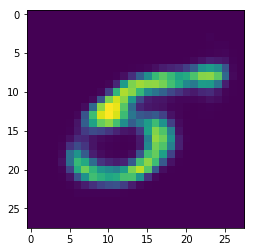

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  15



  0%|          | 1/214 [00:02<08:06,  2.28s/it]

[0 2 3 8 0 1 0 6 4 1 3 0 6 6 8 1 7 6 0 0 5 4 3 7 4 0 7 6 1 5 4 0 7 0 5 8 5
 7 1 6 9 6 3 2 1 0 1 1 7 2 5 7 8 5 7 2 6 9 1 3 3 3 3 6 1 3 6 1 1 8 2 6 3 8
 7 5 3 2 9 3 8 3 2 4 7 6 1 4 4 4 0 3 8 0 2 8 7 7 7 9 5 1 6 4 4 9 5 4 9 1 5
 1 4 0 1 1 9 6 9 1 8 1 7 9 6 5 0 2 7 6 0 8 9 2 1 9 9 4 0 0 7 5 1 6 2 7 5 1
 4 8 1 1 9 8 2 7 9 2 5 5 5 2 5 3 9 0 6 2 5 9 0 2 3 0 5 4 6 1 4 8 7 1 1 1 8
 0 4 7 1 8 4 7 0 0 9 1 5 3 2 9 7 3 3 8 0 5 0 9 4 9 0 8 8 1 5 5 9 1 2 2 2 3
 5 3 6 9 1 2 9 0 7 2 2 0 5 5 9 4 0 2 3 2 0 1 6 1 3 7 5 3 1 7 7 2 0 9]
[0 2 3 8 0 1 0 6 4 1 3 0 6 6 8 1 7 6 0 0 5 4 3 7 4 0 7 6 1 5 4 0 7 0 5 8 5
 7 1 6 9 6 3 2 1 0 1 1 7 2 5 7 8 5 7 2 6 9 1 3 3 3 3 6 1 3 6 1 1 8 2 6 3 8
 7 5 3 2 9 3 8 3 2 4 7 6 1 4 4 4 0 3 8 0 2 8 7 7 7 9 5 1 6 4 4 9 5 4 9 1 5
 1 4 0 1 1 9 6 9 1 8 1 7 9 6 5 0 2 7 6 0 8 9 2 1 9 9 4 0 0 7 5 1 6 2 7 5 1
 4 8 1 1 9 8 2 7 9 2 5 5 5 2 5 3 9 0 6 2 5 9 0 2 3 0 5 4 6 1 4 8 7 1 1 1 8
 0 4 7 1 8 4 7 0 0 9 1 5 3 2 9 7 3 3 8 0 5 0 9 4 9 0 8 8 1 5 5 9 1 2 2 2 3
 5 3 6 9 1 2 9 0 7 2 2 0 5 5 9


  1%|          | 2/214 [00:04<08:08,  2.30s/it]

[8 3 2 9 9 9 2 2 1 6 9 2 3 4 4 8 9 3 2 9 0 8 9 8 5 6 1 6 3 0 9 7 1 2 7 4 5
 3 7 1 9 3 8 2 9 0 3 5 5 7 3 5 0 4 3 6 7 0 4 7 5 2 0 0 4 5 8 7 5 2 9 6 6 0
 0 6 4 8 3 2 2 3 8 9 1 5 6 4 9 3 3 6 7 6 1 1 2 8 8 4 1 7 6 3 8 5 4 6 2 6 7
 2 1 9 8 6 4 2 1 1 3 6 3 0 7 9 0 1 8 9 7 9 0 6 9 0 1 8 2 6 9 2 5 0 6 6 6 3
 8 7 2 2 0 1 3 7 6 1 8 7 1 2 1 4 3 4 0 7 5 4 9 7 9 8 2 3 5 0 4 1 2 5 0 4 4
 5 9 8 2 8 7 5 2 5 9 6 9 5 7 5 2 2 1 0 3 8 6 4 1 3 6 9 6 0 6 2 7 9 0 6 1 4
 3 3 6 7 8 2 3 4 0 2 7 6 9 0 9 1 9 2 3 2 6 7 8 7 6 5 5 0 7 2 2 8 3 6]
[8 3 2 9 9 9 2 2 1 6 9 2 3 4 4 8 9 3 2 9 0 8 9 8 5 6 1 6 3 0 9 7 1 2 7 4 5
 3 7 1 9 3 8 2 9 0 3 5 5 7 3 5 0 4 3 6 7 0 4 7 5 2 0 0 4 5 8 7 5 2 9 6 6 0
 0 6 4 8 3 2 2 3 8 9 1 5 6 4 9 3 3 6 7 6 1 1 2 8 8 4 1 7 6 3 8 5 4 6 2 6 7
 2 1 9 8 6 4 2 1 1 3 6 3 0 7 9 0 1 8 9 7 9 0 6 9 0 1 8 2 6 9 2 5 0 6 6 6 3
 8 7 2 2 0 1 3 7 6 1 8 7 1 2 1 4 3 4 0 7 5 4 9 7 9 8 2 3 5 0 4 1 2 5 0 4 4
 5 9 8 2 8 7 5 2 5 9 6 9 5 7 5 2 2 1 0 3 8 6 4 1 3 6 9 6 0 6 2 7 9 0 6 1 4
 3 3 6 7 8 2 3 4 0 2 7 6 9 0 9


  1%|▏         | 3/214 [00:06<07:53,  2.25s/it]

[1 4 3 4 8 1 0 0 4 7 1 0 3 8 9 4 0 1 7 2 0 7 0 4 8 3 9 9 3 5 1 8 6 7 0 9 3
 1 4 7 5 9 2 7 5 4 3 2 8 2 5 0 2 1 4 3 0 4 5 4 1 3 5 2 8 1 7 7 8 7 8 0 4 9
 5 6 7 1 8 5 3 2 3 4 1 0 1 1 2 4 7 0 1 6 4 2 7 7 8 1 8 1 8 0 4 0 8 2 3 4 1
 6 4 7 8 5 2 9 8 6 1 0 1 1 1 9 9 0 9 3 5 2 2 2 7 2 8 3 6 6 0 7 3 8 0 7 1 7
 2 3 1 4 3 6 7 9 1 1 8 8 9 7 3 1 6 7 2 5 7 2 0 6 3 0 6 7 3 1 0 4 9 7 3 1 0
 7 6 2 6 6 9 3 0 7 9 7 0 2 2 8 1 8 9 5 8 9 0 3 6 9 4 0 8 6 0 3 2 1 6 0 8 3
 2 9 7 3 8 0 2 9 8 3 0 5 8 5 8 8 7 8 7 5 8 0 8 2 1 9 4 0 1 4 2 5 4 3]
[1 4 3 4 8 1 0 0 4 7 1 0 3 8 9 4 0 1 7 2 0 7 0 4 8 3 9 9 3 5 1 8 6 7 0 9 3
 1 4 7 5 9 2 7 5 4 3 2 8 2 5 0 2 1 4 3 0 4 5 4 1 3 5 2 8 1 7 7 8 7 8 0 4 9
 5 6 7 1 8 5 3 2 3 4 1 0 1 1 2 4 7 0 1 6 4 2 7 7 8 1 8 1 8 0 4 0 8 2 3 4 1
 6 4 7 8 5 2 9 8 6 1 0 1 1 1 9 9 0 9 3 5 2 2 2 7 2 8 3 6 6 0 7 3 8 0 7 1 7
 2 3 1 4 3 6 7 9 1 1 8 8 9 7 3 1 6 7 2 5 7 2 0 6 3 0 6 7 3 1 0 4 9 7 3 1 0
 7 6 2 6 6 9 3 0 7 9 7 0 2 2 8 1 8 9 5 8 9 0 3 6 9 4 0 8 6 0 3 2 1 6 0 8 3
 2 9 7 3 8 0 2 9 8 3 0 5 8 5 8


  2%|▏         | 4/214 [00:08<07:44,  2.21s/it]

[3 0 9 0 1 7 4 3 3 0 6 4 4 5 2 7 2 5 7 8 7 7 0 1 8 5 5 7 8 9 8 9 9 2 5 1 4
 0 0 8 2 6 3 2 2 4 4 0 6 5 8 8 7 5 4 4 7 5 6 7 0 7 4 6 8 6 7 6 5 4 0 3 7 3
 5 2 5 5 5 9 1 3 4 4 2 8 6 0 6 7 3 4 1 7 3 5 7 0 0 2 7 3 3 2 8 0 1 4 3 2 7
 1 7 1 1 4 4 7 2 9 5 9 7 4 2 8 8 7 3 7 8 3 5 4 7 5 5 4 3 7 1 2 9 6 4 6 6 5
 8 2 7 8 6 2 9 3 0 4 6 4 9 9 7 2 4 0 8 2 8 6 1 9 1 4 5 2 2 6 7 4 7 1 6 0 9
 2 2 0 9 9 6 6 4 5 8 6 2 4 7 3 8 2 1 7 4 2 7 6 0 8 7 1 4 0 6 6 0 9 4 9 4 6
 8 6 9 0 1 9 8 3 0 0 9 9 5 4 3 9 9 6 0 8 3 9 6 1 4 3 6 1 2 3 0 9 6 6]
[3 0 9 0 1 7 4 3 3 0 6 4 4 5 2 7 2 5 7 8 7 7 0 1 8 5 5 7 8 9 8 9 9 2 5 1 4
 0 0 8 2 6 3 2 2 4 4 0 6 5 8 8 7 5 4 4 7 5 6 7 0 7 4 6 8 6 7 6 5 4 0 3 7 3
 5 2 5 5 5 9 1 3 4 4 2 8 6 0 6 7 3 4 1 7 3 5 7 0 0 2 7 3 3 2 8 0 1 4 3 2 7
 1 7 1 1 4 4 7 2 9 5 9 7 4 2 8 8 7 3 7 8 3 5 4 7 5 5 4 3 7 1 2 9 6 4 6 6 5
 8 2 7 8 6 2 9 3 0 4 6 4 9 9 7 2 4 0 8 2 8 6 1 9 1 4 5 2 2 6 7 4 7 1 6 0 9
 2 2 0 9 9 6 6 4 5 8 6 2 4 7 3 8 2 1 7 4 2 7 6 0 8 7 1 4 0 6 6 0 9 4 9 4 6
 8 6 9 0 1 9 8 3 0 0 9 9 5 4 3


  2%|▏         | 5/214 [00:11<07:40,  2.21s/it]

[8 8 5 8 2 2 9 3 9 0 8 0 4 2 3 5 9 9 2 5 1 5 0 3 1 1 7 9 9 2 5 1 3 8 5 1 8
 4 8 8 6 8 8 5 1 2 4 8 3 5 0 3 7 0 2 3 1 5 3 9 8 2 3 2 1 6 2 9 9 6 4 2 5 5
 1 6 6 6 5 6 8 9 7 2 8 2 9 3 2 9 8 8 6 6 1 1 9 5 5 2 9 5 5 4 2 3 0 6 4 1 4
 7 7 8 2 0 9 7 9 3 4 4 0 3 0 3 1 5 4 2 0 9 3 6 3 1 6 8 0 5 4 6 1 5 3 6 8 4
 4 8 7 3 7 1 3 7 0 5 6 9 7 9 8 2 3 0 9 7 5 3 5 6 0 0 1 8 9 2 1 1 1 9 8 0 5
 2 2 9 4 3 1 3 7 1 8 3 1 5 4 0 3 1 1 1 6 2 1 2 3 0 8 9 0 0 4 2 8 9 9 8 1 6
 1 7 7 1 2 5 4 7 0 6 5 1 2 4 2 0 0 3 9 8 0 2 0 7 4 5 0 1 1 3 4 1 3 4]
[8 8 5 8 2 2 9 3 9 0 8 0 4 2 3 5 9 9 2 5 1 5 0 3 1 1 7 9 9 2 5 1 3 8 5 1 8
 4 8 8 6 8 8 5 1 2 4 8 3 5 0 3 7 0 2 3 1 5 3 9 8 2 3 2 1 6 2 9 9 6 4 2 5 5
 1 6 6 6 5 6 8 9 7 2 8 2 9 3 2 9 8 8 6 6 1 1 9 5 5 2 9 5 5 4 2 3 0 6 4 1 4
 7 7 8 2 0 9 7 9 3 4 4 0 3 0 3 1 5 4 2 0 9 3 6 3 1 6 8 0 5 4 6 1 5 3 6 8 4
 4 8 7 3 7 1 3 7 0 5 6 9 7 9 8 2 3 0 9 7 5 3 5 6 0 0 1 8 9 2 1 1 1 9 8 0 5
 2 2 9 4 3 1 3 7 1 8 3 1 5 4 0 3 1 1 1 6 2 1 2 3 0 8 9 0 0 4 2 8 9 9 8 1 6
 1 7 7 1 2 5 4 7 0 6 5 1 2 4 2


  3%|▎         | 6/214 [00:13<07:43,  2.23s/it]

[5 3 7 4 0 5 2 4 9 7 4 8 5 8 1 2 7 0 5 0 7 5 4 7 7 8 0 2 5 8 9 6 6 9 5 0 8
 9 6 1 6 0 1 8 1 8 6 2 8 5 9 3 7 1 2 5 1 1 9 3 4 9 4 1 1 1 0 3 0 1 1 0 7 0
 6 2 5 2 1 2 7 0 4 8 4 9 9 8 3 8 1 3 9 0 8 5 3 7 4 3 0 0 4 5 2 2 3 5 1 4 8
 3 5 1 0 0 8 1 5 2 6 8 3 7 2 5 4 4 2 1 0 4 9 2 3 9 4 9 1 2 7 2 3 5 1 8 5 7
 7 0 1 5 8 8 8 5 4 2 2 9 8 2 2 0 8 3 6 9 0 7 6 1 5 4 9 9 3 1 7 1 9 0 2 5 1
 6 7 1 1 4 1 6 9 8 8 5 1 6 7 4 6 3 6 0 7 9 0 5 7 5 5 6 1 9 3 5 0 2 8 6 0 5
 4 6 4 6 4 0 2 1 6 7 9 2 2 4 9 9 5 7 1 0 2 7 6 9 3 3 1 4 7 4 8 2 5 9]
[5 3 7 4 0 5 2 4 9 7 4 8 5 8 1 2 7 0 5 0 7 5 4 7 7 8 0 2 5 8 9 6 6 9 5 0 8
 9 6 1 6 0 1 8 1 8 6 2 8 5 9 3 7 1 2 5 1 1 9 3 4 9 4 1 1 1 0 3 0 1 1 0 7 0
 6 2 5 2 1 2 7 0 4 8 4 9 9 8 3 8 1 3 9 0 8 5 3 7 4 3 0 0 4 5 2 2 3 5 1 4 8
 3 5 1 0 0 8 1 5 2 6 8 3 7 2 5 4 4 2 1 0 4 9 2 3 9 4 9 1 2 7 2 3 5 1 8 5 7
 7 0 1 5 8 8 8 5 4 2 2 9 8 2 2 0 8 3 6 9 0 7 6 1 5 4 9 9 3 1 7 1 9 0 2 5 1
 6 7 1 1 4 1 6 9 8 8 5 1 6 7 4 6 3 6 0 7 9 0 5 7 5 5 6 1 9 3 5 0 2 8 6 0 5
 4 6 4 6 4 0 2 1 6 7 9 2 2 4 9


  3%|▎         | 7/214 [00:15<07:43,  2.24s/it]

[5 6 2 5 9 4 8 3 7 2 4 8 1 6 1 8 1 1 5 3 9 9 3 5 7 7 3 4 7 3 0 0 6 7 1 1 0
 6 5 6 3 1 6 9 1 5 6 8 6 8 7 9 8 0 3 2 3 7 0 9 0 7 3 2 5 3 0 4 9 1 7 4 2 3
 8 6 5 4 7 4 1 5 2 0 3 7 9 6 6 7 4 8 7 5 6 7 5 8 1 3 9 9 1 3 9 7 3 1 1 0 3
 6 5 1 3 5 9 6 2 3 6 3 9 5 1 5 3 2 7 5 2 3 7 0 8 5 4 7 1 7 2 3 6 3 6 8 4 4
 2 0 5 5 1 0 9 8 3 7 1 0 0 0 7 1 4 5 1 1 0 0 9 2 4 1 8 5 3 4 8 7 6 4 9 2 0
 3 1 7 8 4 1 7 4 8 2 3 9 0 4 8 2 3 5 9 8 1 5 3 7 4 7 3 2 7 6 2 9 9 1 5 0 1
 1 7 9 5 6 7 6 9 5 9 1 0 6 9 9 2 9 4 2 1 0 1 1 5 3 4 0 3 2 1 3 6 3 7]
[5 6 2 5 9 4 8 3 7 2 4 8 1 6 1 8 1 1 5 3 9 9 3 5 7 7 3 4 7 3 0 0 6 7 1 1 0
 6 5 6 3 1 6 9 1 5 6 8 6 8 7 9 8 0 3 2 3 7 0 9 0 7 3 2 5 3 0 4 9 1 7 4 2 3
 8 6 5 4 7 4 1 5 2 0 3 7 9 6 6 7 4 8 7 5 6 7 5 8 1 3 9 9 1 3 9 7 3 1 1 0 3
 6 5 1 3 5 9 6 2 3 6 3 9 5 1 5 3 2 7 5 2 3 7 0 8 5 4 7 1 7 2 3 6 3 6 8 4 4
 2 0 5 5 1 0 9 8 3 7 1 0 0 0 7 1 4 5 1 1 0 0 9 2 4 1 8 5 3 4 8 7 6 4 9 2 0
 3 1 7 8 4 1 7 4 8 2 3 9 0 4 8 2 3 5 9 8 1 5 3 7 4 7 3 2 7 6 2 9 9 1 5 0 1
 1 7 9 5 6 7 6 9 5 9 1 0 6 9 9


  4%|▎         | 8/214 [00:17<07:39,  2.23s/it]

[6 1 0 7 8 7 7 0 3 9 0 7 4 6 6 1 3 4 0 6 5 0 1 0 0 3 3 3 9 2 9 7 3 2 7 2 2
 8 7 9 7 0 7 7 8 5 3 8 6 9 1 7 6 9 1 1 0 0 4 8 1 8 3 2 5 8 0 3 2 1 8 9 3 1
 1 4 2 9 8 2 9 9 3 1 5 5 0 6 7 5 8 7 9 1 0 6 9 1 9 3 6 2 1 0 8 6 7 0 6 9 0
 6 0 7 0 9 1 6 2 3 5 0 0 7 3 2 3 3 4 1 7 0 6 7 7 3 9 0 9 0 2 1 6 8 2 0 1 5
 0 9 8 4 1 1 3 0 2 6 3 6 2 2 0 6 2 3 7 9 0 4 7 5 5 3 9 0 9 7 9 1 8 8 1 1 1
 0 6 5 4 1 3 2 1 2 0 5 1 5 5 7 9 2 5 2 8 8 3 1 8 0 2 1 7 2 3 1 9 9 3 6 3 3
 5 0 0 3 6 1 3 0 8 7 0 8 4 0 5 4 0 4 1 8 0 4 8 0 2 5 8 1 0 4 7 4 6 3]
[6 1 0 7 8 7 7 0 3 9 0 7 4 6 6 1 3 4 0 6 5 0 1 0 0 3 3 3 9 2 9 7 3 2 7 2 2
 8 7 9 7 0 7 7 8 5 3 8 6 9 1 7 6 9 1 1 0 0 4 8 1 8 3 2 5 8 0 3 2 1 8 9 3 1
 1 4 2 9 8 2 9 9 3 1 5 5 0 6 7 5 8 7 9 1 0 6 9 1 9 3 6 2 1 0 8 6 7 0 6 9 0
 6 0 7 0 9 1 6 2 3 5 0 0 7 3 2 3 3 4 1 7 0 6 7 7 3 9 0 9 0 2 1 6 8 2 0 1 5
 0 9 8 4 1 1 3 0 2 6 3 6 2 2 0 6 2 3 7 9 0 4 7 5 5 3 9 0 9 7 9 1 8 8 1 1 1
 0 6 5 4 1 3 2 1 2 0 5 1 5 5 7 9 2 5 2 8 8 3 1 8 0 2 1 7 2 3 1 9 9 3 6 3 3
 5 0 0 3 6 1 3 0 8 7 0 8 4 0 5


  4%|▍         | 9/214 [00:19<07:32,  2.21s/it]

[2 1 9 6 4 7 6 9 6 3 2 5 9 3 4 2 3 3 1 0 8 0 3 9 9 8 5 2 6 5 5 6 8 5 7 3 3
 2 1 8 3 4 6 4 0 7 6 0 9 4 6 9 8 2 6 4 8 7 1 8 0 9 7 2 5 0 4 1 7 7 0 8 0 0
 4 0 4 6 1 6 8 8 2 3 8 6 5 0 2 3 6 0 1 6 0 0 7 1 9 3 8 6 6 1 1 0 5 9 1 8 0
 7 2 1 6 6 7 0 7 8 1 4 1 5 3 8 2 4 1 1 7 7 4 3 4 3 8 1 6 4 4 6 5 8 5 1 4 0
 6 2 0 7 8 3 3 9 3 8 9 9 3 9 4 4 5 3 3 1 2 8 1 0 3 2 6 1 1 2 0 2 5 1 1 0 1
 3 5 3 0 8 4 1 1 4 6 8 2 9 3 5 2 2 6 3 6 7 1 9 2 5 6 2 6 8 3 7 1 4 4 6 0 2
 9 5 7 0 9 9 3 6 9 0 1 6 7 1 6 0 9 9 1 1 4 3 7 2 9 1 7 1 1 3 2 3 6 7]
[2 1 9 6 4 7 6 9 6 3 2 5 9 3 4 2 3 3 1 0 8 0 3 9 9 8 5 2 6 5 5 6 8 5 7 3 3
 2 1 8 3 4 6 4 0 7 6 0 9 4 6 9 8 2 6 4 8 7 1 8 0 9 7 2 5 0 4 1 7 7 0 8 0 0
 4 0 4 6 1 6 8 8 2 3 8 6 5 0 2 3 6 0 1 6 0 0 7 1 9 3 8 6 6 1 1 0 5 9 1 8 0
 7 2 1 6 6 7 0 7 8 1 4 1 5 3 8 2 4 1 1 7 7 4 3 4 3 8 1 6 4 4 6 5 8 5 1 4 0
 6 2 0 7 8 3 3 9 3 8 9 9 3 9 4 4 5 3 3 1 2 8 1 0 3 2 6 1 1 2 0 2 5 1 1 0 1
 3 5 3 0 8 4 1 1 4 6 8 2 9 3 5 2 2 6 3 6 7 1 9 2 5 6 2 6 8 3 7 1 4 4 6 0 2
 9 5 7 0 9 9 3 6 9 0 1 6 7 1 6


  5%|▍         | 10/214 [00:22<07:28,  2.20s/it]

[3 5 0 3 2 5 3 6 1 3 1 1 7 6 2 4 7 5 5 2 1 3 4 0 1 7 7 2 3 1 6 8 1 2 3 6 6
 7 9 9 4 0 8 9 4 0 1 5 0 4 8 6 4 2 2 0 3 9 5 9 7 1 0 4 2 1 4 3 3 8 0 3 4 0
 5 2 5 9 0 6 0 9 1 0 5 9 9 5 9 3 0 5 4 2 3 7 1 9 3 0 1 5 8 2 9 0 3 7 3 9 4
 5 6 9 0 5 7 8 2 9 3 8 9 6 1 1 7 3 9 6 4 1 1 0 9 6 5 3 8 0 1 1 6 2 5 3 7 2
 6 3 9 7 3 7 0 9 0 9 3 3 5 0 7 6 2 9 0 5 5 6 4 3 7 1 4 0 2 5 6 4 7 0 9 7 3
 6 7 1 7 9 8 9 5 9 3 4 6 5 3 1 4 0 9 7 4 9 4 0 5 9 8 0 2 0 6 0 9 5 2 2 0 1
 3 5 2 7 2 0 1 2 9 9 3 6 3 8 1 0 1 0 2 1 8 7 6 3 3 7 1 9 4 9 6 1 4 2]
[3 5 0 3 2 5 3 6 1 3 1 1 7 6 2 4 7 5 5 2 1 3 4 0 1 7 7 2 3 1 6 8 1 2 3 6 6
 7 9 9 4 0 8 9 4 0 1 5 0 4 8 6 4 2 2 0 3 9 5 9 7 1 0 4 2 1 4 3 3 8 0 3 4 0
 5 2 5 9 0 6 0 9 1 0 5 9 9 5 9 3 0 5 4 2 3 7 1 9 3 0 1 5 8 2 9 0 3 7 3 9 4
 5 6 9 0 5 7 8 2 9 3 8 9 6 1 1 7 3 9 6 4 1 1 0 9 6 5 3 8 0 1 1 6 2 5 3 7 2
 6 3 9 7 3 7 0 9 0 9 3 3 5 0 7 6 2 9 0 5 5 6 4 3 7 1 4 0 2 5 6 4 7 0 9 7 3
 6 7 1 7 9 8 9 5 9 3 4 6 5 3 1 4 0 9 7 4 9 4 0 5 9 8 0 2 0 6 0 9 5 2 2 0 1
 3 5 2 7 2 0 1 2 9 9 3 6 3 8 1


  5%|▌         | 11/214 [00:24<07:26,  2.20s/it]

[6 3 9 6 8 5 9 8 4 9 2 4 0 6 5 3 3 6 7 7 3 0 1 7 1 7 2 6 1 4 4 8 3 0 5 8 3
 9 8 9 5 4 3 5 5 4 5 9 6 0 0 8 3 4 6 6 0 2 1 0 4 2 8 3 6 4 1 2 3 6 0 2 1 3
 8 5 6 0 5 8 0 6 9 0 0 6 3 2 8 1 9 3 5 0 2 3 2 8 1 9 5 8 6 0 9 2 1 9 1 6 8
 3 0 1 5 4 0 8 7 7 0 4 8 0 7 7 4 9 5 7 8 0 2 8 5 0 0 7 8 1 8 4 1 0 3 8 8 0
 9 2 3 0 6 7 4 8 4 4 2 4 6 0 5 1 6 1 0 7 8 7 4 1 0 9 7 9 9 5 8 9 9 9 8 2 5
 4 5 9 0 1 9 2 8 9 0 2 0 6 8 4 9 9 3 0 8 2 8 4 3 0 6 4 5 7 3 8 0 1 6 9 5 9
 1 2 1 6 7 6 8 0 7 8 1 8 2 9 1 9 2 6 8 0 4 9 6 8 5 3 7 0 0 5 6 6 3 3]
[6 3 9 6 8 5 9 8 4 9 2 4 0 6 5 3 3 6 7 7 3 0 1 7 1 7 2 6 1 4 4 8 3 0 5 8 3
 9 8 9 5 4 3 5 5 4 5 9 6 0 0 8 3 4 6 6 0 2 1 0 4 2 8 3 6 4 1 2 3 6 0 2 1 3
 8 5 6 0 5 8 0 6 9 0 0 6 3 2 8 1 9 3 5 0 2 3 2 8 1 9 5 8 6 0 9 2 1 9 1 6 8
 3 0 1 5 4 0 8 7 7 0 4 8 0 7 7 4 9 5 7 8 0 2 8 5 0 0 7 8 1 8 4 1 0 3 8 8 0
 9 2 3 0 6 7 4 8 4 4 2 4 6 0 5 1 6 1 0 7 8 7 4 1 0 9 7 9 9 5 8 9 9 9 8 2 5
 4 5 9 0 1 9 2 8 9 0 2 0 6 8 4 9 9 3 0 8 2 8 4 3 0 6 4 5 7 3 8 0 1 6 9 5 9
 1 2 1 6 7 6 8 0 7 8 1 8 2 9 1


  6%|▌         | 12/214 [00:26<07:24,  2.20s/it]

[2 2 7 0 4 5 6 9 0 2 9 7 7 7 9 2 1 8 1 7 0 4 0 9 6 5 8 2 6 0 4 6 7 7 4 2 8
 7 0 2 4 5 7 5 5 6 5 6 7 6 5 2 1 0 9 3 0 2 9 1 9 1 6 2 4 6 9 7 3 7 5 6 5 4
 2 3 8 2 8 9 3 9 0 1 8 3 9 6 8 1 9 6 7 1 2 0 5 8 4 0 9 7 9 4 0 3 5 4 2 7 8
 6 7 8 9 6 0 3 4 9 6 4 3 5 6 5 0 4 8 3 7 3 9 4 3 8 4 5 1 1 7 9 4 6 7 3 0 8
 7 8 4 5 8 0 9 3 9 3 8 7 4 8 1 1 4 7 5 7 2 5 7 8 2 2 8 0 6 3 0 5 8 9 9 5 6
 1 1 5 4 2 4 0 6 1 8 9 5 6 6 0 5 0 6 5 2 9 8 7 6 3 8 3 1 1 6 2 2 0 4 6 4 9
 5 9 1 2 2 1 8 8 7 0 2 2 3 3 9 1 5 9 4 6 3 9 0 5 6 5 2 6 0 0 3 4 6 9]
[2 2 7 0 4 5 6 9 0 2 9 7 7 7 9 2 1 8 1 7 0 4 0 9 6 5 8 2 6 0 4 6 7 7 4 2 8
 7 0 2 4 5 7 5 5 6 5 6 7 6 5 2 1 0 9 3 0 2 9 1 9 1 6 2 4 6 9 7 3 7 5 6 5 4
 2 3 8 2 8 9 3 9 0 1 8 3 9 6 8 1 9 6 7 1 2 0 5 8 4 0 9 7 9 4 0 3 5 4 2 7 8
 6 7 8 9 6 0 3 4 9 6 4 3 5 6 5 0 4 8 3 7 3 9 4 3 8 4 5 1 1 7 9 4 6 7 3 0 8
 7 8 4 5 8 0 9 3 9 3 8 7 4 8 1 1 4 7 5 7 2 5 7 8 2 2 8 0 6 3 0 5 8 9 9 5 6
 1 1 5 4 2 4 0 6 1 8 9 5 6 6 0 5 0 6 5 2 9 8 7 6 3 8 3 1 1 6 2 2 0 4 6 4 9
 5 9 1 2 2 1 8 8 7 0 2 2 3 3 9


  6%|▌         | 13/214 [00:28<07:22,  2.20s/it]

[9 2 8 4 8 7 5 7 8 2 6 7 3 7 2 8 3 7 2 9 7 6 4 5 8 8 7 2 2 3 2 1 3 9 4 0 7
 2 8 0 4 6 9 8 4 0 0 3 6 3 0 4 3 1 1 5 5 2 9 7 7 6 9 5 1 6 9 7 4 2 3 7 5 9
 1 1 1 0 1 6 6 3 4 0 4 1 2 4 0 9 4 4 1 5 9 4 3 1 4 0 3 3 4 3 3 1 9 3 6 3 6
 6 6 7 1 2 2 4 1 4 8 4 3 5 1 3 6 9 7 9 5 1 1 2 7 3 5 5 1 6 1 4 7 0 0 9 3 1
 2 8 4 7 5 9 0 8 4 7 2 1 5 1 9 9 2 5 0 5 3 5 4 7 6 3 7 1 3 2 4 7 6 2 6 5 2
 2 7 0 3 0 9 0 2 3 3 3 6 8 4 4 2 4 0 5 2 0 9 8 4 2 8 3 9 8 3 5 9 1 1 6 9 7
 6 6 5 2 8 5 1 8 7 1 3 3 5 8 3 0 6 2 6 8 2 8 0 5 4 7 5 8 8 7 9 8 7 2]
[9 2 8 4 8 7 5 7 8 2 6 7 3 7 2 8 3 7 2 9 7 6 4 5 8 8 7 2 2 3 2 1 3 9 4 0 7
 2 8 0 4 6 9 8 4 0 0 3 6 3 0 4 3 1 1 5 5 2 9 7 7 6 9 5 1 6 9 7 4 2 3 7 5 9
 1 1 1 0 1 6 6 3 4 0 4 1 2 4 0 9 4 4 1 5 9 4 3 1 4 0 3 3 4 3 3 1 9 3 6 3 6
 6 6 7 1 2 2 4 1 4 8 4 3 5 1 3 6 9 7 9 5 1 1 2 7 3 5 5 1 6 1 4 7 0 0 9 3 1
 2 8 4 7 5 9 0 8 4 7 2 1 5 1 9 9 2 5 0 5 3 5 4 7 6 3 7 1 3 2 4 7 6 2 6 5 2
 2 7 0 3 0 9 0 2 3 3 3 6 8 4 4 2 4 0 5 2 0 9 8 4 2 8 3 9 8 3 5 9 1 1 6 9 7
 6 6 5 2 8 5 1 8 7 1 3 3 5 8 3


  7%|▋         | 14/214 [00:30<07:17,  2.19s/it]

[7 3 6 3 4 2 2 1 6 9 6 3 0 0 6 6 3 0 6 8 3 5 1 9 1 2 5 9 1 2 1 6 8 7 3 5 4
 1 1 4 5 6 1 3 4 5 1 5 5 5 6 8 8 8 5 7 3 3 0 3 7 2 3 5 0 9 3 5 1 1 1 1 7 7
 9 1 2 9 0 2 8 4 0 1 7 4 5 7 5 4 0 0 0 6 6 0 1 6 0 5 7 6 3 8 8 7 7 8 0 0 7
 5 8 8 2 0 8 0 8 4 2 7 5 4 1 9 5 6 0 7 8 3 9 6 1 1 1 1 4 8 3 9 1 8 8 4 4 8
 4 0 0 4 8 2 1 4 7 5 0 0 3 2 3 0 0 5 3 5 9 1 1 0 4 7 6 2 1 3 4 4 8 6 8 9 6
 2 9 7 5 9 3 9 9 8 9 9 0 5 2 7 7 7 7 9 6 9 0 6 3 1 4 0 5 2 8 9 5 5 6 8 1 9
 9 7 0 8 5 0 9 0 2 7 0 6 3 1 3 3 3 1 6 7 4 9 1 7 0 3 7 9 3 7 6 6 0 2]
[7 3 6 3 4 2 2 1 6 9 6 3 0 0 6 6 3 0 6 8 3 5 1 9 1 2 5 9 1 2 1 6 8 7 3 5 4
 1 1 4 5 6 1 3 4 5 1 5 5 5 6 8 8 8 5 7 3 3 0 3 7 2 3 5 0 9 3 5 1 1 1 1 7 7
 9 1 2 9 0 2 8 4 0 1 7 4 5 7 5 4 0 0 0 6 6 0 1 6 0 5 7 6 3 8 8 7 7 8 0 0 7
 5 8 8 2 0 8 0 8 4 2 7 5 4 1 9 5 6 0 7 8 3 9 6 1 1 1 1 4 8 3 9 1 8 8 4 4 8
 4 0 0 4 8 2 1 4 7 5 0 0 3 2 3 0 0 5 3 5 9 1 1 0 4 7 6 2 1 3 4 4 8 6 8 9 6
 2 9 7 5 9 3 9 9 8 9 9 0 5 2 7 7 7 7 9 6 9 0 6 3 1 4 0 5 2 8 9 5 5 6 8 1 9
 9 7 0 8 5 0 9 0 2 7 0 6 3 1 3


  7%|▋         | 15/214 [00:33<07:22,  2.22s/it]

[7 2 3 0 1 8 4 0 1 6 5 5 8 6 4 4 6 9 3 3 7 4 7 3 8 0 7 1 4 6 7 4 8 9 2 7 2
 3 2 4 8 3 1 7 3 6 8 4 2 9 7 6 2 0 4 7 7 5 9 7 6 8 7 7 5 4 7 1 2 2 9 6 6 6
 7 1 1 6 6 1 0 0 4 0 3 9 7 8 0 3 8 4 6 3 0 2 9 8 5 0 6 2 1 0 3 6 3 0 7 8 8
 1 2 5 8 8 1 0 2 6 7 1 5 1 1 7 3 6 8 4 1 9 9 1 1 2 9 3 8 1 3 0 9 5 2 6 3 1
 3 4 9 5 8 9 8 4 6 5 1 5 4 3 6 6 2 0 1 8 4 7 6 7 6 1 1 8 9 4 0 5 5 7 9 5 8
 3 8 4 9 8 0 3 3 5 9 1 9 9 8 0 3 0 5 0 2 6 2 3 1 9 5 3 2 5 5 5 6 2 4 3 0 4
 5 1 1 6 2 1 8 1 5 2 8 7 3 7 2 8 2 2 6 5 2 7 5 6 5 5 8 6 2 1 0 4 3 2]
[7 2 3 0 1 8 4 0 1 6 5 5 8 6 4 4 6 9 3 3 7 4 9 3 8 0 7 1 4 6 7 4 8 9 2 7 2
 3 2 4 8 3 1 7 3 6 8 4 2 9 7 6 2 0 4 7 7 5 9 7 6 8 7 7 5 4 7 1 2 2 9 6 6 6
 7 1 1 6 6 1 0 0 4 0 3 9 7 8 0 3 8 4 6 3 0 2 9 8 5 0 6 2 1 0 3 6 3 0 7 8 8
 1 2 5 8 8 1 0 2 6 7 1 5 1 1 7 3 6 8 4 1 9 9 1 1 2 9 3 8 1 3 0 9 5 2 6 3 1
 3 4 9 5 8 9 8 4 6 5 1 5 4 3 6 6 2 0 1 8 4 7 6 7 6 1 1 8 9 4 0 5 5 7 9 5 8
 3 8 4 9 8 0 3 3 5 9 1 9 9 8 0 3 0 5 0 2 6 2 3 1 9 5 3 2 5 5 5 6 2 4 3 0 4
 5 1 1 6 2 1 8 1 5 2 8 7 3 7 2


  7%|▋         | 16/214 [00:36<07:26,  2.25s/it]

[8 2 7 3 3 7 0 0 1 8 1 9 3 5 9 6 4 5 1 4 9 1 7 5 7 6 0 0 7 8 3 8 6 6 6 8 2
 1 2 0 4 9 9 2 1 6 4 7 3 0 2 4 9 1 9 7 9 6 4 8 0 8 8 3 6 1 9 4 5 8 3 7 4 1
 9 9 5 7 0 5 2 4 3 2 8 8 2 0 9 6 1 6 1 3 6 8 8 5 3 8 9 9 8 1 9 9 8 5 7 8 9
 8 0 0 9 7 4 3 9 7 7 7 3 6 5 7 2 4 3 4 5 7 9 4 7 8 4 0 9 9 8 0 6 0 8 3 6 5
 4 7 4 4 5 8 2 2 0 3 8 1 8 8 2 2 6 8 8 0 1 1 1 7 2 5 6 8 6 1 0 3 8 6 0 3 0
 8 2 1 1 3 0 3 0 7 5 1 3 3 0 5 6 6 0 9 9 1 2 2 6 3 7 8 1 6 9 0 2 6 7 2 7 5
 6 9 2 1 1 3 9 5 0 9 4 4 4 6 8 1 8 7 2 7 2 4 3 4 3 2 3 7 1 1 1 8 4 3]
[8 2 7 3 3 7 0 0 1 8 1 9 3 5 9 6 4 5 1 4 9 1 7 5 7 6 0 0 7 8 3 8 6 6 6 8 2
 1 2 0 4 9 9 2 1 6 4 7 3 0 2 4 9 1 9 7 9 6 4 8 0 8 8 3 6 1 9 4 5 8 3 7 4 1
 9 9 5 7 0 5 2 4 3 2 8 8 2 0 9 6 1 6 1 3 6 8 8 5 3 8 9 9 8 1 9 9 8 5 7 8 9
 8 0 0 9 7 4 3 9 7 7 7 3 6 5 7 2 4 3 4 5 7 9 4 7 8 4 0 9 9 8 0 6 0 8 3 6 5
 4 7 4 4 5 8 2 2 0 3 8 1 8 8 2 2 6 8 8 0 1 1 1 7 2 5 6 8 6 1 0 3 8 6 0 3 0
 8 2 1 1 3 0 3 0 7 5 1 3 3 0 5 6 6 0 9 9 1 2 2 6 3 7 8 1 6 9 0 2 6 7 2 7 5
 6 9 2 1 1 3 9 5 0 9 4 4 4 6 8


  8%|▊         | 17/214 [00:38<07:28,  2.28s/it]

[7 7 0 8 4 4 3 5 6 5 3 1 9 0 0 8 7 2 9 4 8 5 1 3 6 1 0 2 4 7 1 6 3 9 3 7 9
 3 9 7 1 4 1 2 9 0 8 1 4 8 1 9 6 7 7 9 1 8 2 3 1 0 7 2 3 7 2 1 5 0 1 2 7 2
 8 3 2 7 0 2 5 8 1 3 7 1 7 1 8 1 2 5 8 7 6 7 4 3 9 0 2 1 7 1 6 5 3 9 3 0 9
 8 3 3 9 2 2 6 9 4 1 1 2 1 3 3 3 1 6 4 9 2 0 0 9 1 4 3 0 4 7 1 4 1 1 9 3 8
 5 6 8 3 1 9 6 5 1 1 3 1 3 9 3 1 5 8 2 7 1 2 1 7 2 3 1 9 8 1 2 5 6 6 1 7 1
 1 6 1 7 1 0 8 7 9 0 3 0 1 4 1 6 8 5 0 6 7 7 9 1 7 5 8 5 3 7 3 5 8 1 0 9 5
 3 7 6 4 2 6 4 5 9 1 4 4 4 4 4 6 6 3 2 2 4 3 6 9 6 6 2 0 9 6 6 1 0 2]
[7 7 0 8 4 4 3 5 6 5 3 1 9 0 0 8 7 2 9 4 8 5 1 3 6 1 0 2 4 7 1 6 3 9 3 7 9
 3 9 7 1 4 1 2 9 0 8 1 4 8 1 9 6 7 7 9 1 8 2 3 1 0 7 2 3 7 2 1 5 0 1 2 7 2
 8 3 2 7 0 2 5 8 1 3 7 1 7 1 8 1 2 5 8 7 6 7 4 3 9 0 2 1 7 1 6 5 3 9 3 0 9
 8 3 3 9 2 2 6 9 4 1 1 2 1 3 3 3 1 6 4 9 2 0 0 9 1 4 3 0 4 7 1 4 1 1 9 3 8
 5 6 8 3 1 9 6 5 1 1 3 1 3 9 3 1 5 8 2 7 1 2 1 7 2 3 1 9 8 1 2 5 6 6 1 7 1
 1 6 1 7 1 0 8 7 9 0 3 0 1 4 1 6 8 5 0 6 7 7 9 1 7 5 8 5 3 7 3 5 8 1 0 9 5
 3 7 6 4 2 6 4 5 9 1 4 4 4 4 4


  8%|▊         | 18/214 [00:41<07:30,  2.30s/it]

[1 4 1 4 6 3 4 9 7 4 8 0 5 3 8 1 6 6 1 4 4 6 8 3 1 4 1 0 8 7 8 3 6 8 0 3 8
 4 2 4 2 0 7 3 0 7 8 1 6 0 9 3 5 9 6 2 2 5 2 9 2 3 7 8 0 2 4 8 2 3 4 2 6 3
 2 6 1 0 9 1 3 7 6 7 9 8 2 2 1 7 2 8 9 5 2 3 0 8 5 5 8 8 4 1 9 1 5 3 4 5 8
 6 7 7 4 8 3 6 1 2 8 3 6 4 9 5 9 1 2 5 0 2 1 3 4 1 7 2 4 6 2 2 4 8 8 8 8 4
 5 3 6 6 0 1 8 1 4 9 1 5 1 1 5 2 8 7 0 8 3 6 7 1 5 9 6 9 8 0 6 9 1 2 1 4 9
 5 0 2 3 5 4 0 2 6 6 3 7 7 4 3 4 1 5 3 4 7 7 5 5 1 4 5 8 9 8 4 2 9 0 7 3 9
 3 0 7 7 0 5 0 6 9 8 0 0 5 7 7 0 8 4 3 8 7 9 6 8 5 4 4 6 9 8 4 5 4 8]
[1 4 1 4 6 3 4 9 7 4 8 0 5 3 8 1 6 6 1 4 4 6 8 3 1 4 1 0 8 7 8 3 6 8 0 3 8
 4 2 4 2 0 7 3 0 7 8 1 6 0 9 3 5 9 6 2 2 5 2 9 2 3 7 8 0 2 4 8 2 3 4 2 6 3
 2 6 1 0 9 1 3 7 6 7 9 8 2 2 1 7 2 8 9 5 2 3 0 8 5 5 8 8 4 1 9 1 5 3 4 5 8
 6 7 7 4 8 3 6 1 2 8 3 6 4 9 5 9 1 2 5 0 2 1 3 4 1 7 2 4 6 2 2 4 8 8 8 8 4
 5 3 6 6 0 1 8 1 4 9 1 5 1 1 5 2 8 7 0 8 3 6 7 1 5 9 6 9 8 0 6 9 1 2 1 4 9
 5 0 2 3 5 4 0 2 6 6 3 7 7 4 3 4 1 5 3 4 7 7 5 5 1 4 5 8 9 8 4 2 9 0 7 3 9
 3 0 7 7 0 5 0 6 9 8 0 0 5 7 7


  9%|▉         | 19/214 [00:43<07:30,  2.31s/it]

[4 3 9 8 1 7 6 6 0 5 7 2 9 0 4 2 4 8 7 0 1 2 9 1 5 5 7 9 0 2 2 6 6 9 9 7 6
 0 3 4 3 0 1 9 1 2 4 0 1 5 6 8 5 4 4 0 9 1 4 7 9 4 3 0 0 1 7 7 3 8 5 0 5 7
 5 1 6 9 9 4 4 7 3 8 2 8 7 1 0 8 7 8 1 9 9 2 4 8 9 8 1 2 0 9 3 7 9 4 1 1 1
 2 1 7 4 8 7 4 8 8 5 2 1 2 0 7 7 2 1 6 1 0 2 2 0 6 2 4 6 9 9 2 9 3 9 7 3 9
 2 6 9 9 2 8 4 4 8 0 3 4 1 1 8 3 4 9 2 1 4 4 0 5 4 8 7 3 4 2 6 7 6 9 0 4 5
 2 5 8 3 1 3 6 1 7 6 2 1 5 6 5 3 8 2 8 2 3 9 3 8 4 5 5 3 2 9 4 8 7 2 8 7 4
 4 8 7 6 4 7 6 2 1 6 3 4 8 0 3 0 0 1 6 8 3 7 5 8 7 5 7 3 3 7 4 0 3 9]
[4 3 9 8 1 7 6 6 0 5 7 2 9 0 4 2 4 8 7 0 1 2 9 1 5 5 7 9 0 2 2 6 6 9 9 7 6
 0 3 4 3 0 1 9 1 2 4 0 1 5 6 8 5 4 4 0 9 1 4 7 9 4 3 0 0 1 7 7 3 8 5 0 5 7
 5 1 6 9 9 4 4 7 3 8 2 8 7 1 0 8 7 8 1 9 9 2 4 8 9 8 1 2 0 9 3 7 9 4 1 1 1
 2 1 7 4 8 7 4 8 8 5 2 1 2 0 7 7 2 1 6 1 0 2 2 0 6 2 4 6 9 9 2 9 3 9 7 3 9
 2 6 9 9 2 8 4 4 8 0 3 4 1 1 8 3 4 9 2 1 4 4 0 5 4 8 7 3 4 2 6 7 6 9 0 4 5
 2 5 8 3 1 3 6 1 7 6 2 1 5 6 5 3 8 2 8 2 3 9 3 8 4 5 5 3 2 9 4 8 7 2 8 7 4
 4 8 7 6 4 7 6 2 1 6 3 4 8 0 3


  9%|▉         | 20/214 [00:46<07:31,  2.33s/it]

[8 9 6 6 7 5 7 3 1 4 3 0 2 6 5 3 2 4 4 1 1 6 7 1 4 5 2 9 2 2 2 9 8 1 7 2 6
 0 8 2 2 3 4 7 5 7 6 3 9 7 7 3 0 0 6 4 4 1 7 0 7 5 4 6 1 7 6 1 0 1 6 7 0 3
 4 8 4 0 0 8 2 8 8 7 3 4 1 7 3 7 3 2 7 8 6 1 5 0 2 8 4 7 7 4 6 0 4 4 4 7 3
 8 9 9 2 1 2 6 2 4 8 5 0 0 1 3 4 9 5 3 6 8 8 3 1 7 3 8 9 8 0 5 3 1 9 2 2 1
 1 1 9 9 6 8 3 7 9 5 0 1 4 6 8 8 8 8 7 6 2 9 7 8 3 8 3 0 4 3 3 2 1 4 0 3 5
 0 2 1 5 3 5 8 7 7 7 6 5 0 4 7 1 8 2 0 7 4 8 5 3 9 9 6 3 7 1 1 1 0 0 9 3 1
 2 4 7 8 5 2 8 1 1 2 9 6 2 0 2 5 2 4 9 2 1 1 3 3 0 8 0 2 3 9 3 5 0 4]
[8 9 6 6 7 5 7 3 1 4 3 0 2 6 5 3 2 4 4 1 1 6 7 1 4 5 2 9 2 2 2 9 8 1 7 2 6
 0 8 2 2 3 4 7 5 7 6 3 9 7 7 3 0 0 6 4 4 1 7 0 7 5 4 6 1 7 6 1 0 1 6 7 0 3
 4 8 4 0 0 8 2 8 8 7 3 4 1 7 3 7 3 2 7 8 6 1 5 0 2 8 4 7 7 4 6 0 4 4 4 7 3
 8 9 9 2 1 2 6 2 4 8 5 0 0 1 3 4 9 5 3 6 8 8 3 1 7 3 8 9 8 0 5 3 1 9 2 2 1
 1 1 9 9 6 8 3 7 9 5 0 1 4 6 8 8 8 8 7 6 2 9 7 8 3 8 3 0 4 3 3 2 1 4 0 3 5
 0 2 1 5 3 5 8 7 7 7 6 5 0 4 7 1 8 2 0 7 4 8 5 3 9 9 6 3 7 1 1 1 0 0 9 3 1
 2 4 7 8 5 2 8 1 1 2 9 6 2 0 2


 10%|▉         | 21/214 [00:49<07:31,  2.34s/it]

[0 9 9 2 1 2 9 7 9 5 3 6 5 2 6 4 6 7 7 8 2 2 9 9 1 6 1 3 1 8 4 5 0 5 1 5 0
 3 2 6 1 1 5 5 6 6 5 6 7 6 8 0 3 4 1 3 3 3 1 1 5 0 3 8 9 8 6 1 6 0 6 3 8 9
 1 0 1 0 1 7 1 8 2 3 6 0 6 0 9 1 5 9 3 6 9 5 1 0 1 1 2 6 9 3 2 5 0 8 8 9 5
 4 4 2 2 1 6 4 7 8 4 3 8 1 0 6 0 7 9 6 5 2 9 6 6 7 1 9 4 1 5 7 2 4 2 2 2 7
 7 0 6 5 2 4 4 0 3 8 6 1 8 1 1 5 9 7 5 8 4 0 1 2 9 4 7 9 6 6 1 2 0 9 4 3 6
 8 1 0 1 1 7 2 3 9 4 2 0 0 4 8 5 0 7 4 0 1 9 8 4 8 5 5 2 0 6 1 1 0 4 7 5 7
 8 4 0 4 6 4 3 2 9 3 3 8 2 6 0 4 7 7 7 9 3 1 8 7 0 1 2 0 2 5 2 5 0 6]
[0 9 9 2 1 2 9 7 9 5 3 6 5 2 6 4 6 7 7 8 2 2 9 9 1 6 1 3 1 8 4 5 0 5 1 5 0
 3 2 6 1 1 5 5 6 6 5 6 7 6 8 0 3 4 1 3 3 3 1 1 5 0 3 8 9 8 6 1 6 0 6 3 8 9
 1 0 1 0 1 7 1 8 2 3 6 0 6 0 9 1 5 9 3 6 9 5 1 0 1 1 2 6 9 3 2 5 0 8 8 9 5
 4 4 2 2 1 6 4 7 8 4 3 8 1 0 6 0 7 9 6 5 2 9 6 6 7 1 9 4 1 5 7 2 4 2 2 2 7
 7 0 6 5 2 4 4 0 3 8 6 1 8 1 1 5 9 7 5 8 4 0 1 2 9 4 7 9 6 6 1 2 0 9 4 3 6
 8 1 0 1 1 7 2 3 9 4 2 0 0 4 8 5 0 7 4 0 1 9 8 4 8 5 5 2 0 6 1 1 0 4 7 5 7
 8 4 0 4 6 4 3 2 9 3 3 8 2 6 0


 10%|█         | 22/214 [00:51<07:32,  2.36s/it]

[7 2 7 8 9 5 1 2 8 2 9 1 8 5 5 3 3 6 0 6 7 0 5 7 3 6 5 6 3 0 8 8 7 9 1 2 4
 6 4 3 9 7 5 5 1 1 6 0 3 2 4 9 6 0 7 9 3 2 9 2 3 1 1 3 3 4 1 0 0 3 0 4 8 3
 2 9 7 8 7 2 0 7 2 9 6 9 2 7 3 1 5 3 5 0 9 0 7 0 5 1 6 5 1 9 8 2 5 6 8 4 5
 2 8 0 4 6 7 1 7 4 0 3 9 1 0 5 2 2 1 4 5 7 5 9 8 2 6 5 6 7 0 6 6 9 9 2 6 6
 3 1 1 7 5 1 5 4 7 2 4 2 6 8 8 0 2 4 1 6 0 1 3 4 4 7 4 8 0 0 8 9 0 5 8 5 4
 0 7 4 3 9 2 5 2 6 9 2 1 3 0 5 1 6 9 5 2 9 3 9 3 6 4 7 3 7 5 4 8 4 4 7 7 6
 5 7 3 7 4 5 8 2 8 7 5 0 9 7 5 1 3 1 2 9 7 0 9 7 2 5 2 1 4 9 2 4 5 2]
[7 2 7 8 9 5 1 2 8 2 9 1 8 5 5 3 3 6 0 6 7 0 5 7 3 6 5 6 3 0 8 8 7 9 1 2 4
 6 4 3 9 7 5 5 1 1 6 0 3 2 4 9 6 0 7 9 3 2 9 2 3 1 1 3 3 4 1 0 0 3 0 4 8 3
 2 9 7 8 7 2 0 7 2 9 6 9 2 7 3 1 5 3 5 0 9 0 7 0 5 1 6 5 1 9 8 2 5 6 8 4 5
 2 8 0 4 6 7 1 7 4 0 3 9 1 0 5 2 2 1 4 5 7 5 9 8 2 6 5 6 7 0 6 6 9 9 2 6 6
 3 1 1 7 5 1 5 4 7 2 4 2 6 8 8 0 2 4 1 6 0 1 3 4 4 7 4 8 0 0 8 9 0 5 8 5 4
 0 7 4 3 9 2 5 2 6 9 2 1 3 0 5 1 6 9 5 2 9 3 9 3 6 4 7 3 7 5 4 8 4 4 7 7 6
 5 7 3 7 4 5 8 2 8 7 5 0 9 7 5


 11%|█         | 23/214 [00:54<07:31,  2.37s/it]

[7 0 1 0 8 0 5 4 9 1 1 5 0 4 6 2 2 2 9 1 7 2 7 2 9 4 0 8 1 5 3 2 2 2 7 7 1
 3 1 4 4 7 1 5 5 0 1 3 2 5 8 7 5 6 4 0 5 2 7 9 4 8 9 1 7 1 2 1 6 1 5 0 1 0
 6 0 2 9 2 9 3 0 1 1 5 6 0 4 8 0 6 4 2 5 2 3 7 1 8 3 3 8 8 4 9 8 9 6 4 8 7
 3 9 1 6 8 4 6 1 2 2 5 4 3 6 1 5 2 3 8 4 1 5 7 4 0 6 5 8 6 3 5 9 8 7 0 7 1
 0 6 6 7 7 6 3 9 6 5 5 4 8 0 7 8 1 5 2 0 5 4 0 4 4 5 3 6 2 4 9 7 1 0 0 4 4
 7 9 7 2 1 8 7 2 8 4 0 6 0 5 9 8 0 6 8 9 1 4 0 6 7 2 6 0 2 1 7 4 6 2 1 0 4
 7 9 0 1 1 0 3 2 0 7 2 2 2 4 9 0 0 4 1 7 2 0 8 6 7 4 3 0 1 1 0 2 4 6]
[7 0 1 0 8 0 5 4 9 1 1 5 0 4 6 2 2 2 9 1 7 2 7 2 9 4 0 8 1 5 3 2 2 2 7 7 1
 3 1 4 4 7 1 5 5 0 1 3 2 5 8 7 5 6 4 0 5 2 7 9 4 8 9 1 7 1 2 1 6 1 5 0 1 0
 6 0 2 9 2 9 3 0 1 1 5 6 0 4 8 0 6 4 2 5 2 3 7 1 8 3 3 8 8 4 9 8 9 6 4 8 7
 3 9 1 6 8 4 6 1 2 2 5 4 3 6 1 5 2 3 8 4 1 5 7 4 0 6 5 8 6 3 5 9 8 7 0 7 1
 0 6 6 7 7 6 3 9 6 5 5 4 8 0 7 8 1 5 2 0 5 4 0 4 4 5 3 6 2 4 9 7 1 0 0 4 4
 7 9 7 2 1 8 7 2 8 4 0 6 0 5 9 8 0 6 8 9 1 4 0 6 7 2 6 0 2 1 7 4 6 2 1 0 4
 7 9 0 1 1 0 3 2 0 7 2 2 2 4 9


 11%|█         | 24/214 [00:57<07:31,  2.38s/it]

[8 2 3 4 8 5 3 8 0 5 3 6 4 4 0 2 9 3 0 5 6 0 9 7 2 5 7 3 7 5 9 0 5 7 3 5 0
 7 4 9 8 2 5 4 5 7 4 0 9 9 0 2 0 9 9 7 1 5 8 2 3 7 6 6 9 1 3 1 6 6 7 9 1 2
 7 0 6 7 6 1 6 6 2 3 4 1 6 4 8 5 2 4 0 5 1 2 9 1 1 3 3 3 0 2 7 9 9 5 5 0 1
 5 6 0 2 5 4 1 3 7 2 9 2 1 8 8 9 3 3 6 1 3 0 3 8 9 9 2 3 7 7 8 7 5 3 6 9 2
 3 8 2 6 5 2 3 1 9 5 1 0 1 6 0 7 7 5 2 9 6 3 9 2 8 7 2 2 3 5 8 9 9 7 0 2 7
 4 0 9 8 8 9 2 7 2 1 9 5 7 6 1 0 7 0 1 4 1 0 6 0 5 2 0 6 7 7 7 2 7 9 8 1 4
 9 9 8 3 3 5 2 6 1 2 2 3 8 4 7 9 9 1 6 8 8 2 6 1 7 8 9 4 2 1 0 8 6 1]
[8 2 3 4 8 5 3 8 0 5 3 6 4 4 0 2 9 3 0 5 6 0 9 7 2 5 7 3 7 5 9 0 5 7 3 5 0
 7 4 9 8 2 5 4 5 7 4 0 9 9 0 2 0 9 9 7 1 5 8 2 3 7 6 6 9 1 3 1 6 6 7 9 1 2
 7 0 6 7 6 1 6 6 2 3 4 1 6 4 8 5 2 4 0 5 1 2 9 1 1 3 3 3 0 2 7 9 9 5 5 0 1
 5 6 0 2 5 4 1 3 7 2 9 2 1 8 8 9 3 3 6 1 3 0 3 8 9 9 2 3 7 7 8 7 5 3 6 9 2
 3 8 2 6 5 2 3 1 9 5 1 0 1 6 0 7 7 5 2 9 6 3 9 2 8 7 2 2 3 5 8 9 9 7 0 2 7
 4 0 9 8 8 9 2 7 2 1 9 5 7 6 1 0 7 0 1 4 1 0 6 0 5 2 0 6 7 7 7 2 9 9 8 1 4
 9 9 8 3 3 5 2 6 1 2 2 3 8 4 7


 12%|█▏        | 25/214 [00:59<07:30,  2.38s/it]

[6 1 6 6 1 6 7 1 7 7 1 4 2 1 3 9 2 5 5 4 3 0 0 9 1 5 2 4 6 6 7 9 6 0 3 1 5
 4 9 9 9 2 9 3 5 3 5 4 7 6 0 3 3 5 3 9 8 7 2 8 0 3 0 9 0 5 5 1 3 3 7 1 8 2
 9 8 9 4 0 7 2 6 0 6 7 7 8 9 2 2 2 6 7 1 9 8 8 1 1 2 6 9 8 3 8 3 8 0 1 8 5
 4 2 9 7 4 7 6 9 7 1 4 8 1 5 3 8 9 6 2 4 4 1 5 8 6 3 5 0 6 9 0 4 6 8 2 1 7
 1 7 2 0 5 5 1 4 5 0 9 6 7 1 8 7 9 1 2 3 9 4 9 3 6 1 4 2 4 5 2 4 7 5 0 8 1
 9 6 3 8 2 7 6 7 6 7 6 1 8 7 0 6 7 1 5 1 8 6 5 8 0 6 7 9 3 3 0 7 4 5 1 9 3
 5 2 7 8 8 1 5 5 1 2 2 4 8 7 2 7 5 1 2 7 9 7 3 2 0 8 2 4 9 1 6 5 0 3]
[6 1 6 6 1 6 7 1 7 7 1 4 2 1 3 9 2 5 5 4 3 0 0 9 1 5 2 4 6 6 7 9 6 0 3 1 5
 4 9 9 9 2 9 3 5 3 5 4 7 6 0 3 3 5 3 9 8 7 2 8 0 3 0 9 0 5 5 1 3 3 7 1 8 2
 9 8 9 4 0 7 2 6 0 6 7 7 8 9 2 2 2 6 7 1 9 8 8 1 1 2 6 9 8 3 8 3 8 0 1 8 5
 4 2 9 7 4 7 6 9 7 1 4 8 1 5 3 8 9 6 2 4 4 1 5 8 6 3 5 0 6 9 0 4 6 8 2 1 7
 1 7 2 0 5 5 1 4 5 0 9 6 7 1 8 7 9 1 2 3 9 4 9 3 6 1 4 2 4 5 2 4 7 5 0 8 1
 9 6 3 8 2 7 6 7 6 7 6 1 8 7 0 6 7 1 5 1 8 6 5 8 0 6 7 9 3 3 0 7 4 5 1 9 3
 5 2 7 8 8 1 5 5 1 2 2 4 8 7 2


 12%|█▏        | 26/214 [01:02<07:30,  2.39s/it]

[4 6 5 9 4 3 0 1 8 5 8 1 6 8 2 4 9 4 3 1 2 3 7 4 5 9 6 7 8 8 3 8 7 1 3 2 7
 2 7 5 2 0 7 8 7 0 7 0 6 5 7 2 1 5 2 3 4 6 1 6 8 0 8 9 8 0 1 8 3 6 1 2 2 8
 1 9 1 1 3 5 9 0 2 8 9 5 1 0 0 1 4 1 4 0 7 0 9 1 7 5 8 5 8 2 7 0 2 9 5 3 4
 3 1 9 2 0 9 1 9 9 9 5 7 8 3 8 3 8 6 6 5 7 2 9 1 6 3 9 9 1 4 7 6 4 3 6 1 2
 5 0 7 2 9 5 8 3 9 3 3 6 5 6 6 2 1 6 3 7 1 9 5 1 0 0 7 7 9 5 0 6 8 9 2 6 1
 3 3 5 3 0 9 2 4 2 2 7 7 1 0 2 3 7 5 8 0 6 0 5 7 3 8 1 1 1 2 4 9 3 8 7 5 6
 0 5 7 8 2 6 8 0 7 9 1 9 9 2 7 8 5 1 6 1 2 1 6 3 4 0 6 2 2 2 6 1 7 8]
[4 6 5 9 4 3 0 1 8 5 8 1 6 8 2 4 9 4 3 1 2 3 7 4 5 9 6 7 8 8 3 8 7 1 3 2 7
 2 7 5 2 0 7 8 7 0 7 0 6 5 7 2 1 5 2 3 4 6 1 6 8 0 8 9 8 0 1 8 3 6 1 2 2 8
 1 9 1 1 3 5 9 0 2 8 9 5 1 0 0 1 4 1 4 0 7 0 9 1 7 5 8 5 8 2 7 0 2 9 5 3 4
 3 1 9 2 0 9 1 9 9 9 5 7 8 3 8 3 8 6 6 5 7 2 9 1 6 3 9 9 1 4 7 6 4 3 6 1 2
 5 0 7 2 9 5 8 3 9 3 3 6 5 6 6 2 1 6 3 7 1 9 5 1 0 0 7 7 9 5 0 6 8 9 2 6 1
 3 3 5 3 0 9 2 4 2 2 7 7 1 0 2 3 7 5 8 0 6 0 5 7 3 8 1 1 1 2 4 9 3 8 7 5 6
 0 5 7 8 2 6 8 0 7 9 1 9 9 2 7


 13%|█▎        | 27/214 [01:04<07:29,  2.41s/it]

[6 9 9 9 2 6 2 6 2 9 3 8 4 0 5 3 5 8 7 3 7 6 2 7 9 5 5 3 8 6 1 7 4 5 9 5 8
 4 5 5 6 2 4 4 4 8 3 7 2 3 1 3 3 9 8 3 2 3 4 3 3 4 0 7 5 8 4 6 5 4 6 4 2 1
 9 1 8 3 6 6 9 0 8 5 3 3 6 1 9 8 7 4 7 8 9 6 4 5 2 4 7 9 3 9 6 2 0 6 8 7 0
 6 7 1 4 5 3 5 3 7 3 3 9 1 0 0 5 5 7 4 1 7 4 9 6 7 2 0 0 0 9 1 4 7 3 1 0 6
 3 2 9 0 7 4 4 6 1 8 8 3 3 4 1 2 2 4 0 7 0 2 3 2 4 3 2 4 1 3 0 8 7 8 0 5 3
 1 0 4 8 3 1 1 0 8 6 6 4 2 0 2 2 1 0 4 5 1 3 7 6 7 1 9 3 3 3 4 7 1 6 6 8 3
 4 5 0 0 4 7 8 2 5 3 6 5 8 7 7 3 9 8 6 3 3 8 5 7 3 6 7 9 5 6 8 3 7 3]
[6 9 9 9 2 6 2 6 2 9 3 8 4 0 5 3 5 8 7 3 7 6 2 7 9 5 5 3 8 6 1 7 4 5 9 5 8
 4 5 5 6 2 4 4 4 8 3 7 2 3 1 3 3 9 8 3 2 3 4 3 3 4 0 7 5 8 4 6 5 4 6 4 2 1
 9 1 8 3 6 6 9 0 8 5 3 3 6 1 9 8 7 4 7 8 9 6 4 5 2 4 7 9 3 9 6 2 0 6 8 7 0
 6 7 1 4 5 3 5 3 7 3 3 9 1 0 0 5 5 7 4 1 7 4 9 6 7 2 0 0 0 9 1 4 7 3 1 0 6
 3 2 9 0 7 4 4 6 1 8 8 3 3 4 1 2 2 4 0 7 0 2 3 2 4 3 2 4 1 3 0 8 7 8 0 5 3
 1 0 4 8 3 1 1 0 8 6 6 4 2 0 2 2 1 0 4 5 1 3 7 6 7 1 9 3 3 3 4 7 1 6 6 8 3
 4 5 0 0 4 7 8 2 5 3 6 5 8 7 7


 13%|█▎        | 28/214 [01:07<07:28,  2.41s/it]

[2 6 9 7 2 0 2 0 4 4 8 1 4 6 5 2 1 7 8 7 4 4 3 9 1 6 9 7 7 9 1 5 2 2 5 7 9
 0 9 0 8 4 6 7 3 9 7 5 6 0 7 0 8 2 9 2 8 6 5 3 9 7 4 8 0 0 5 5 6 9 5 3 5 0
 9 9 5 7 7 3 8 8 4 6 5 6 4 8 9 7 3 0 6 5 9 5 9 3 3 2 7 1 3 7 2 6 7 0 9 9 6
 1 4 1 0 2 0 2 3 1 3 1 5 4 5 5 5 9 0 1 9 7 1 2 0 5 1 0 6 3 7 4 1 8 5 7 4 1
 0 9 2 0 4 3 1 6 5 2 6 1 6 4 4 8 0 5 5 7 3 7 6 6 7 7 3 2 4 6 9 6 0 1 7 5 2
 0 6 6 8 9 9 7 9 7 7 7 4 2 2 9 9 6 2 3 2 5 9 8 9 6 9 4 7 3 3 0 0 5 1 2 7 8
 3 1 6 2 5 7 9 0 2 4 6 2 1 1 6 7 5 2 4 9 6 0 0 1 3 0 5 6 0 8 2 9 7 3]
[2 6 9 7 2 0 2 0 4 4 8 1 4 6 5 2 1 7 8 7 4 4 3 9 1 6 9 7 7 9 1 5 2 2 5 7 9
 0 9 0 8 4 6 7 3 9 7 5 6 0 7 0 8 2 9 2 8 6 5 3 9 7 4 8 0 0 5 5 6 9 5 3 5 0
 9 9 5 7 7 3 8 8 4 6 5 6 4 8 9 7 3 0 6 5 9 5 9 3 3 2 7 1 3 7 2 6 7 0 9 9 6
 1 4 1 0 2 0 2 3 1 3 1 5 4 5 5 5 9 0 1 9 7 1 2 0 5 1 0 6 3 7 4 1 8 5 7 4 1
 0 9 2 0 4 3 1 6 5 2 6 1 6 4 4 8 0 5 5 7 3 7 6 6 7 7 3 2 4 6 9 6 0 1 7 5 2
 0 6 6 8 9 9 7 9 7 7 7 4 2 2 9 9 6 2 3 2 5 9 8 9 6 9 4 7 3 3 0 0 5 1 2 7 8
 3 1 6 2 5 7 9 0 2 4 6 2 1 1 6


 14%|█▎        | 29/214 [01:10<07:27,  2.42s/it]

[8 3 2 8 1 3 1 1 9 2 4 7 9 1 9 0 3 0 1 7 4 9 0 9 5 2 8 3 3 3 8 6 6 0 0 6 9
 7 5 7 1 9 7 4 0 9 7 5 8 2 1 8 4 6 7 2 8 3 6 4 1 0 3 4 5 9 4 1 1 9 4 5 2 7
 4 7 7 5 0 2 0 8 8 7 2 6 0 0 0 2 5 3 1 8 9 6 0 5 3 2 6 1 4 0 7 3 9 0 3 3 0
 4 7 0 3 4 1 8 3 3 9 8 5 3 2 0 6 4 4 6 8 9 5 9 1 3 1 9 6 4 2 5 5 7 0 3 6 0
 1 9 4 6 3 3 3 9 8 9 1 5 4 2 8 4 0 3 1 6 8 7 7 1 7 4 4 2 2 1 4 2 2 7 2 6 1
 6 9 6 4 2 6 9 4 6 7 5 1 8 3 0 6 6 4 2 7 5 5 8 9 9 3 4 7 8 1 4 3 3 4 2 3 9
 5 1 5 0 5 1 1 7 3 2 5 8 1 9 9 7 4 0 4 4 8 2 9 0 1 6 4 9 2 2 3 8 8 3]
[8 3 2 8 1 3 1 1 9 2 4 7 9 1 9 0 3 0 1 7 4 9 0 9 5 2 8 3 3 3 8 6 6 0 0 6 9
 7 5 7 1 9 7 4 0 9 7 5 8 2 1 8 4 6 7 2 8 3 6 4 1 0 3 4 5 9 4 1 1 9 4 5 2 7
 4 7 7 5 0 2 0 8 8 7 2 6 0 0 0 2 5 3 1 8 9 6 0 5 3 2 6 1 4 0 7 3 9 0 3 3 0
 4 7 0 3 4 1 8 3 3 9 8 5 3 2 0 6 4 4 6 8 9 5 9 1 3 1 9 6 4 2 5 5 7 0 3 6 0
 1 9 4 6 3 3 3 9 8 9 1 5 4 2 8 4 0 3 1 6 8 7 7 1 7 4 4 2 2 1 4 2 2 7 2 6 1
 6 9 6 4 2 6 9 4 6 7 5 1 8 3 0 6 6 4 2 7 5 5 8 9 9 3 4 7 8 1 4 3 3 4 2 3 9
 5 1 5 0 5 1 1 7 3 2 5 8 1 9 9


 14%|█▍        | 30/214 [01:12<07:26,  2.42s/it]

[3 1 0 0 4 2 6 3 6 0 3 9 5 7 8 4 9 9 7 1 4 1 5 0 9 4 6 4 4 6 3 6 5 3 1 5 0
 4 9 6 1 6 6 2 0 9 0 6 2 2 6 3 8 4 6 8 5 5 1 4 4 4 6 9 0 2 6 7 2 2 8 1 2 1
 1 1 2 6 9 8 9 6 3 8 2 4 5 4 5 9 0 1 4 9 0 3 4 6 8 3 3 9 9 3 3 8 9 9 9 2 4
 4 3 7 7 5 2 8 4 1 8 7 3 8 6 1 6 7 0 2 8 9 8 9 8 2 7 5 3 9 8 1 8 1 9 1 6 1
 2 6 5 6 3 1 3 2 4 7 4 4 0 2 8 7 0 8 8 9 8 3 3 2 0 6 5 3 3 3 0 2 8 3 8 4 0
 9 3 8 7 7 6 4 6 0 3 7 0 7 1 1 3 8 8 1 9 1 7 9 8 4 8 4 8 7 8 3 2 5 3 4 1 7
 9 9 4 2 5 6 8 4 1 8 7 4 0 4 7 5 7 2 2 4 4 0 5 6 3 7 6 1 1 3 5 6 9 7]
[3 1 0 0 4 2 6 3 6 0 3 9 5 7 8 4 9 9 7 1 4 1 5 0 9 4 6 4 4 6 3 6 5 3 1 5 0
 4 9 6 1 6 6 2 0 9 0 6 2 2 6 3 8 4 6 8 5 5 1 4 4 4 6 9 0 2 6 7 2 2 8 1 2 1
 1 1 2 6 9 8 9 6 3 8 2 4 5 4 5 9 0 1 4 9 0 3 4 6 8 3 3 9 9 3 3 8 9 9 9 2 4
 4 3 7 7 5 2 8 4 1 8 7 3 8 6 1 6 7 0 2 8 9 8 9 8 2 7 5 3 9 8 1 8 1 9 1 6 1
 2 6 5 6 3 1 3 2 4 7 4 4 0 2 8 7 0 8 8 9 8 3 3 2 0 6 5 3 3 3 0 2 8 3 8 4 0
 9 3 8 7 7 6 4 6 0 3 7 0 7 1 1 3 8 8 1 9 1 7 9 8 4 8 4 8 7 8 3 2 5 3 4 1 7
 9 9 4 2 5 6 8 4 1 8 7 4 0 4 7


 14%|█▍        | 31/214 [01:15<07:25,  2.43s/it]

[1 5 9 6 9 1 9 6 2 8 3 5 1 4 2 0 1 8 9 7 5 8 0 3 8 3 8 1 0 7 5 8 4 9 9 4 0
 8 1 2 4 6 1 2 1 1 0 1 3 9 8 8 3 9 8 7 8 6 0 1 0 4 5 8 5 5 9 5 1 1 9 8 9 3
 0 2 7 6 5 2 6 5 0 7 7 7 9 8 2 8 3 1 0 4 4 8 5 8 1 1 2 9 5 1 6 8 4 9 0 7 4
 6 7 0 6 8 7 0 1 5 4 0 1 2 9 8 8 5 6 5 0 1 0 1 2 0 9 8 5 9 3 6 0 8 6 3 2 1
 2 0 8 1 3 4 3 0 7 9 8 4 7 4 1 5 2 6 6 5 7 2 1 0 8 7 4 5 8 5 1 3 1 9 2 4 1
 8 9 9 4 3 4 8 6 4 7 3 0 5 7 0 3 1 2 1 8 0 6 6 0 1 8 1 1 4 8 3 3 3 0 6 6 7
 6 0 5 8 7 9 0 2 2 0 4 7 3 1 4 7 6 7 9 3 9 2 6 6 8 0 1 2 1 2 5 1 5 4]
[1 5 9 6 9 1 9 6 2 8 3 5 1 4 2 0 1 8 9 7 5 8 0 3 8 3 8 1 0 7 5 8 4 9 9 4 0
 8 1 2 4 6 1 2 1 1 0 1 3 9 8 8 3 9 8 7 8 6 0 1 0 4 5 8 5 5 9 5 1 1 9 8 9 3
 0 2 7 6 5 2 6 5 0 7 7 7 9 8 2 8 3 1 0 4 4 8 5 8 1 1 2 9 5 1 6 8 4 9 0 7 4
 6 7 0 6 8 7 0 1 5 4 0 1 2 9 8 8 5 6 5 0 1 0 1 2 0 9 8 5 9 3 6 0 8 6 3 2 1
 2 0 8 1 3 4 3 0 7 9 8 4 7 4 1 5 2 6 6 5 7 2 1 0 8 7 4 5 8 5 1 3 1 9 2 4 1
 8 9 9 4 3 4 8 6 4 7 3 0 5 7 0 3 1 2 1 8 0 6 6 0 1 8 1 1 4 8 3 3 3 0 6 6 7
 6 0 5 8 7 9 0 2 2 0 4 7 3 1 4


 15%|█▍        | 32/214 [01:18<07:24,  2.44s/it]

[4 4 2 2 5 3 1 5 6 6 1 3 1 8 7 9 0 7 8 9 3 5 5 2 7 3 0 8 2 0 0 0 9 2 8 5 4
 1 3 1 4 7 2 9 9 0 3 9 7 1 5 0 6 9 6 1 3 1 0 6 6 0 2 5 1 6 1 0 2 2 7 2 4 0
 2 8 7 1 6 2 7 4 5 6 5 3 2 0 6 4 5 8 5 4 0 2 3 7 3 0 1 6 1 9 4 5 4 1 8 1 8
 1 3 5 5 0 0 3 1 5 5 7 3 1 9 2 7 3 6 3 3 6 0 4 5 0 1 2 7 5 9 0 1 3 7 0 8 3
 7 4 1 4 0 1 1 7 6 9 2 0 7 8 7 2 0 1 2 9 6 4 5 5 9 8 3 4 9 3 7 7 1 9 7 6 1
 6 6 1 0 1 1 3 3 9 4 7 3 3 1 3 5 1 1 3 1 5 1 1 7 7 5 0 9 0 6 8 3 6 9 5 6 6
 7 3 9 5 5 4 7 6 3 8 2 5 8 9 4 0 5 0 6 3 2 6 0 0 0 5 0 0 5 8 8 6 8 7]
[4 4 2 2 5 3 1 5 6 6 1 3 1 8 7 9 0 7 8 9 3 5 5 2 7 3 0 8 2 0 0 0 9 2 8 5 4
 1 3 1 4 7 2 9 9 0 3 9 7 1 5 0 6 9 6 1 3 1 0 6 6 0 2 5 1 6 1 0 2 2 7 2 4 0
 2 8 7 1 6 2 7 4 5 6 5 3 2 0 6 4 5 8 5 4 0 2 3 7 3 0 1 6 1 9 4 5 4 1 8 1 8
 1 3 5 5 0 0 3 1 5 5 7 3 1 9 2 7 3 6 3 3 6 0 4 5 0 1 2 7 5 9 0 1 3 7 0 8 3
 7 4 1 4 0 1 1 7 6 9 2 0 7 8 7 2 0 1 2 9 6 4 5 5 9 8 3 4 9 3 7 7 1 9 7 6 1
 6 6 1 0 1 1 3 3 9 4 7 3 3 1 3 5 1 1 3 1 5 1 1 7 7 5 0 9 0 6 8 3 6 9 5 6 6
 7 3 9 5 5 4 7 6 3 8 2 5 8 9 4


 15%|█▌        | 33/214 [01:20<07:22,  2.45s/it]

[5 6 0 4 8 4 5 0 8 2 3 8 2 2 4 9 7 4 1 7 3 7 5 3 4 9 5 4 0 8 9 9 8 9 5 7 0
 7 4 0 4 0 8 7 8 0 2 8 1 5 9 2 0 2 0 7 8 0 2 7 1 8 0 8 2 3 3 3 3 3 4 8 6 5
 6 8 5 0 8 9 5 9 7 6 2 9 3 0 2 4 0 1 1 4 5 1 8 9 0 7 6 2 2 4 7 3 6 9 9 9 5
 2 7 2 2 0 1 1 3 6 1 5 1 1 1 2 5 7 9 7 7 3 9 2 0 8 3 6 7 4 2 3 8 6 4 3 1 9
 4 0 7 5 4 4 2 2 9 9 7 4 6 6 2 4 9 7 1 9 4 2 4 3 4 9 1 7 0 8 7 5 1 4 7 5 7
 9 1 8 6 7 4 1 5 3 5 7 6 9 2 0 6 7 5 6 8 9 8 8 8 6 1 8 2 6 5 4 1 2 9 9 6 6
 4 9 8 4 0 9 1 1 5 8 2 2 3 1 4 3 1 1 5 9 7 1 2 9 3 0 6 2 4 0 1 3 0 0]
[5 6 0 4 8 4 5 0 8 2 3 8 2 2 4 9 7 4 1 7 3 7 5 3 4 9 5 4 0 8 9 9 8 9 5 7 0
 7 4 0 4 0 8 7 8 0 2 8 1 5 9 2 0 2 0 7 8 0 2 7 1 8 0 8 2 3 3 3 3 3 4 8 6 5
 6 8 5 0 8 9 5 9 7 6 2 9 3 0 2 4 0 1 1 4 5 1 8 9 0 7 6 2 2 4 7 3 6 9 9 9 5
 2 7 2 2 0 1 1 3 6 1 5 1 1 1 2 5 7 9 7 7 3 9 2 0 8 3 6 7 4 2 3 8 6 4 3 1 9
 4 0 7 5 4 4 2 2 9 9 7 4 6 6 2 4 9 7 1 9 4 2 4 3 4 9 7 7 0 8 7 5 1 4 7 5 7
 9 1 8 6 7 4 1 5 3 5 7 6 9 2 0 6 7 5 6 8 9 8 8 8 6 1 8 2 6 5 4 1 2 9 9 6 6
 4 9 8 4 0 9 1 1 5 8 2 2 3 1 4


 16%|█▌        | 34/214 [01:23<07:21,  2.45s/it]

[7 0 6 2 8 4 0 4 6 0 7 1 9 7 0 6 9 2 3 9 4 3 6 4 7 4 4 7 1 0 4 5 3 1 5 1 2
 2 3 1 7 5 5 9 7 8 1 3 3 5 5 7 4 1 8 1 1 3 4 3 4 1 0 2 7 1 8 7 5 5 9 4 0 5
 9 1 0 9 5 2 0 2 2 0 6 6 0 9 1 8 8 7 6 6 8 7 9 1 4 5 3 2 4 4 8 7 5 9 1 5 8
 2 0 7 8 6 5 6 3 3 2 7 7 3 8 1 4 7 8 4 0 3 1 0 1 2 5 4 8 1 0 9 7 1 7 4 5 0
 3 7 9 9 2 9 2 1 1 8 7 4 0 3 2 1 4 8 3 7 1 5 6 6 4 5 8 2 6 3 9 9 3 5 3 6 9
 0 9 2 5 2 2 6 8 8 7 5 0 2 1 7 7 4 2 5 0 8 6 1 3 0 8 9 9 9 3 8 3 6 1 2 8 6
 6 1 0 4 8 5 1 3 5 3 3 9 2 6 1 8 0 3 2 7 1 9 0 2 4 9 5 2 3 1 1 7 0 6]
[7 0 6 2 8 4 0 4 6 0 7 1 9 7 0 6 9 2 3 9 4 3 6 4 7 4 4 7 1 0 4 5 3 1 5 1 2
 2 3 1 7 5 5 9 7 8 1 3 3 5 5 7 4 1 8 1 1 3 4 3 4 1 0 2 7 1 8 7 5 5 9 4 0 5
 9 1 0 9 5 2 0 2 2 0 6 6 0 9 1 8 8 7 6 6 8 7 9 1 4 5 3 2 4 4 8 7 5 9 1 5 8
 2 0 7 8 6 5 6 3 3 2 7 7 3 8 1 4 7 8 4 0 3 1 0 1 2 5 4 8 1 0 9 7 1 7 4 5 0
 3 7 9 9 2 9 2 1 1 8 7 4 0 3 2 1 4 8 3 7 1 5 6 6 4 5 8 2 6 3 9 9 3 5 3 6 9
 0 9 2 5 2 2 6 8 8 7 5 0 2 1 7 7 4 2 5 0 8 6 1 3 0 8 9 9 9 3 8 3 6 1 2 8 6
 6 1 0 4 8 5 1 3 5 3 3 9 2 6 1


 16%|█▋        | 35/214 [01:26<07:19,  2.46s/it]

[4 8 7 1 1 8 6 1 2 3 2 5 5 7 4 9 7 4 5 6 5 0 0 1 5 7 1 1 6 5 7 2 1 4 2 3 9
 0 2 1 3 2 2 1 2 1 0 4 1 0 9 4 1 0 3 7 0 8 7 4 6 9 7 9 8 7 6 3 6 3 6 5 2 7
 5 9 8 7 7 9 9 4 7 9 8 3 3 3 5 7 9 1 4 0 6 5 7 4 1 7 1 4 6 5 6 2 1 1 5 2 6
 3 6 0 4 9 1 3 2 8 6 0 2 2 6 3 4 8 3 7 3 3 1 6 5 6 1 6 6 5 8 0 8 8 1 9 5 5
 6 1 8 9 8 3 6 1 7 2 1 5 9 0 7 7 6 5 0 9 8 7 0 3 1 3 8 9 9 3 6 0 3 3 7 1 6
 5 4 5 7 3 7 1 8 4 8 6 5 3 0 7 4 9 1 7 7 7 8 8 7 6 7 5 5 1 8 2 0 3 5 4 4 5
 2 2 9 3 7 2 7 4 3 0 3 9 4 2 6 0 7 8 7 9 8 8 2 8 9 4 5 1 1 8 6 8 7 9]
[4 8 7 1 1 8 6 1 2 3 2 5 5 7 4 9 7 4 5 6 5 0 0 1 5 7 1 1 6 5 7 2 1 4 2 3 9
 0 2 1 3 2 2 1 2 1 0 4 1 0 9 4 1 0 3 7 0 8 7 4 6 9 7 9 8 7 6 3 6 3 6 5 2 7
 5 9 8 7 7 9 9 4 7 9 8 3 3 3 5 7 9 1 4 0 6 5 7 4 1 7 1 4 6 5 6 2 1 1 5 2 6
 3 6 0 4 9 1 3 2 8 6 0 2 2 6 3 4 8 3 7 3 3 1 6 5 6 1 6 6 5 8 0 8 8 1 9 5 5
 6 1 8 9 8 3 6 1 7 2 1 5 9 0 7 7 6 5 0 9 8 7 0 3 1 3 8 9 9 3 6 0 3 3 7 1 6
 5 4 5 7 3 7 1 8 4 8 6 5 3 0 7 4 9 1 7 7 7 8 8 7 6 7 5 5 1 8 2 0 3 5 4 4 5
 2 2 9 3 7 2 7 4 3 0 3 9 4 2 6


 17%|█▋        | 36/214 [01:28<07:18,  2.46s/it]

[4 7 0 1 0 2 5 8 2 5 8 6 1 1 3 2 1 7 3 7 4 6 4 9 9 5 6 4 5 5 0 6 4 2 5 9 5
 1 1 8 4 3 9 1 7 1 9 6 3 8 6 2 6 2 6 0 5 7 2 1 2 3 5 3 3 9 4 1 0 3 2 1 0 0
 7 6 2 0 8 6 0 4 7 2 4 3 4 2 1 6 0 9 3 6 7 1 2 1 8 9 1 5 9 3 1 7 7 5 6 9 4
 7 2 8 0 6 7 4 2 5 7 0 6 1 9 8 1 9 3 1 6 8 0 6 6 1 9 0 3 4 7 1 7 2 5 1 3 8
 2 2 1 3 5 8 1 7 7 9 1 0 3 3 2 6 4 3 3 2 1 1 1 1 6 7 1 8 4 4 6 6 3 0 9 8 5
 8 0 9 8 4 7 2 8 3 3 1 9 2 3 5 2 1 7 2 4 3 6 4 6 7 2 2 2 9 3 3 7 9 8 4 9 5
 9 0 7 4 4 7 0 9 4 0 7 4 8 0 4 7 1 1 7 9 3 8 3 4 7 8 7 5 6 2 5 5 3 8]
[4 7 0 1 0 2 5 8 2 5 8 6 1 1 3 2 1 7 3 7 4 6 4 9 9 5 6 4 5 5 0 6 4 2 5 9 5
 1 1 8 4 3 9 1 7 1 9 6 3 8 6 2 6 2 6 0 5 7 2 1 2 3 5 3 3 9 4 1 0 3 2 1 0 0
 7 6 2 0 8 6 0 4 7 2 4 3 4 2 1 6 0 9 3 6 7 1 2 1 8 9 1 5 9 3 1 7 7 5 6 9 4
 7 2 8 0 6 7 4 2 5 7 0 6 1 9 8 1 9 3 1 6 8 0 6 6 1 9 0 3 4 7 1 7 2 5 1 3 8
 2 2 1 3 5 8 1 7 7 9 1 0 3 3 2 6 4 3 3 2 1 1 1 1 6 7 1 8 4 4 6 6 3 0 9 8 5
 8 0 9 8 4 7 2 8 3 3 1 9 2 3 5 2 1 7 2 4 3 6 4 6 7 2 2 2 9 3 3 7 9 8 4 9 5
 9 0 7 4 4 7 0 9 4 0 7 4 8 0 4


 17%|█▋        | 37/214 [01:31<07:16,  2.46s/it]

[7 3 4 0 7 4 4 0 8 6 0 8 5 6 8 3 2 8 8 6 0 6 7 2 0 4 1 8 2 0 6 2 6 7 1 3 2
 9 8 9 9 6 8 7 6 3 7 3 8 8 0 6 8 4 8 6 9 4 8 3 2 8 4 6 0 9 7 2 7 5 0 1 6 7
 0 4 4 9 4 9 9 1 3 8 7 5 0 9 1 0 0 8 0 6 7 3 2 1 1 2 7 0 9 0 0 9 4 1 9 4 2
 5 0 6 4 8 1 7 5 0 5 1 3 8 9 9 1 8 9 6 8 5 6 3 3 9 7 0 6 6 1 4 9 3 6 1 0 3
 3 4 8 6 5 5 6 5 3 1 2 7 3 8 4 3 6 6 8 0 7 0 7 0 6 9 3 1 8 2 7 6 7 3 2 7 3
 7 3 4 1 9 8 9 9 3 8 0 3 5 8 0 6 5 6 2 1 6 5 7 9 5 5 4 8 2 4 2 4 8 3 7 8 9
 3 0 0 1 3 4 2 6 7 1 1 4 0 8 0 1 6 1 9 3 7 2 7 9 7 1 9 6 9 0 5 6 8 7]
[7 3 4 0 7 4 4 0 8 6 0 8 5 6 8 3 2 8 8 6 0 6 7 2 0 4 1 8 2 0 6 2 6 7 1 3 2
 9 8 9 9 6 8 7 6 3 7 3 8 8 0 6 8 4 8 6 9 4 8 3 2 8 4 6 0 9 7 2 7 5 0 1 6 7
 0 4 4 9 4 9 9 1 3 8 7 5 0 9 1 0 0 8 0 6 7 3 2 1 1 2 7 0 9 0 0 9 4 1 9 4 2
 5 0 6 4 8 1 7 5 0 5 1 3 8 9 9 1 8 9 6 8 5 6 3 3 9 7 0 6 6 1 4 9 3 6 1 0 3
 3 4 8 6 5 5 6 5 3 1 2 7 3 8 4 3 6 6 8 0 7 0 7 0 6 9 3 1 8 2 7 6 7 3 2 7 3
 7 3 4 1 9 8 9 9 3 8 0 3 5 8 0 6 5 6 2 1 6 5 7 9 5 5 4 8 2 4 2 4 8 3 7 8 9
 3 0 0 1 3 4 2 6 7 1 1 4 0 8 0


 18%|█▊        | 38/214 [01:33<07:14,  2.47s/it]

[6 0 5 3 2 3 2 6 4 6 6 3 3 3 8 9 2 3 6 0 4 9 8 2 7 2 0 3 1 2 3 8 2 2 1 4 1
 1 8 1 6 2 5 9 8 8 2 1 0 7 6 7 1 2 0 3 8 8 4 3 5 3 9 5 9 9 6 9 7 4 7 2 7 1
 0 0 7 2 9 6 4 4 9 2 5 3 1 6 5 2 1 5 9 9 4 2 5 9 4 6 6 4 2 1 8 8 7 4 4 9 2
 9 0 8 5 7 8 3 7 7 5 1 0 6 0 5 6 1 2 2 3 9 9 9 5 5 9 3 8 8 2 3 0 3 3 4 5 4
 7 2 1 8 0 9 4 7 2 7 0 0 6 8 1 9 7 6 8 0 5 3 0 3 4 8 0 9 4 9 7 9 5 6 1 0 1
 2 3 5 2 3 7 9 6 8 2 5 4 6 6 8 5 6 8 0 7 7 9 8 0 4 4 9 6 4 0 6 7 4 4 4 3 6
 3 2 0 7 3 6 1 7 8 4 9 3 8 9 1 2 9 5 5 7 3 1 8 4 1 1 7 0 4 1 3 7 2 8]
[6 0 5 3 2 3 2 6 4 6 6 3 3 3 8 9 2 3 6 0 4 9 8 2 7 2 0 3 1 2 3 8 2 2 1 4 1
 1 8 1 6 2 5 9 8 8 2 1 0 7 6 7 1 2 0 3 8 8 4 3 5 3 9 5 9 9 6 9 7 4 7 2 7 1
 0 0 7 2 9 6 4 4 9 2 5 3 1 6 5 2 1 5 9 9 4 2 5 9 4 6 6 4 2 1 8 8 7 4 4 9 2
 9 0 8 5 7 8 3 7 7 5 1 0 6 0 5 6 1 2 2 3 9 9 9 5 5 9 3 8 8 2 3 0 3 3 4 5 4
 7 2 1 8 0 9 4 7 2 7 0 0 6 8 1 9 7 6 8 0 5 3 0 3 4 8 0 9 4 9 7 9 5 6 1 0 1
 2 3 5 2 3 7 9 6 8 2 5 4 6 6 8 5 6 8 0 7 7 9 8 0 4 4 9 6 4 0 6 7 4 4 4 3 6
 3 2 0 7 3 6 1 7 8 4 9 3 8 9 1


 18%|█▊        | 39/214 [01:36<07:12,  2.47s/it]

[7 3 9 3 1 5 6 8 6 3 7 3 9 1 4 8 7 8 6 1 2 8 0 9 1 1 8 1 2 5 3 7 6 4 8 1 5
 3 1 7 1 6 0 2 8 8 3 8 3 9 4 4 5 3 4 5 9 9 3 6 1 8 7 9 9 6 4 2 5 6 2 9 8 9
 5 5 1 6 9 5 2 9 2 0 5 2 1 8 2 7 4 9 9 6 0 2 3 2 9 5 4 4 7 2 6 3 5 1 8 5 6
 2 9 1 5 9 2 5 8 7 4 5 8 0 1 7 5 3 4 8 3 7 1 3 2 0 7 1 6 6 6 5 5 2 9 9 8 1
 1 5 1 8 6 1 7 9 3 3 5 1 1 3 7 9 6 6 4 2 8 3 8 8 5 1 2 9 4 3 2 6 9 0 4 7 6
 6 6 1 1 9 7 0 7 8 4 4 2 5 8 2 5 2 9 7 8 3 4 6 8 6 8 2 1 2 4 3 9 0 4 9 8 2
 9 7 3 6 9 2 4 2 1 5 5 9 1 6 9 6 1 8 2 1 0 2 4 8 4 5 8 2 3 6 4 1 7 7]
[7 3 9 3 1 5 6 8 6 3 7 3 9 1 4 8 7 8 6 1 2 8 0 9 1 1 8 1 2 5 3 7 6 4 8 1 5
 3 1 7 1 6 0 2 8 8 3 8 3 9 4 4 5 3 4 5 9 9 3 6 1 8 7 9 9 6 4 2 5 6 2 9 8 9
 5 5 1 6 9 5 2 9 2 0 5 2 1 8 2 7 4 9 9 6 0 2 3 2 9 5 4 4 7 2 6 3 5 1 8 5 6
 2 9 1 5 9 2 5 8 7 4 5 8 0 1 7 5 3 4 8 3 7 1 3 2 0 7 1 6 6 6 5 5 2 9 9 8 1
 1 5 1 8 6 1 7 9 3 3 5 1 1 3 7 9 6 6 4 2 8 3 8 8 5 1 2 9 4 3 2 6 9 0 4 7 6
 6 6 1 1 9 7 0 7 8 4 4 2 5 8 2 5 2 9 7 8 3 4 6 8 6 8 2 1 2 4 3 9 0 4 9 8 2
 9 7 3 6 9 2 4 2 1 5 5 9 1 6 9


 19%|█▊        | 40/214 [01:39<07:10,  2.48s/it]

[9 2 8 4 2 0 3 9 0 8 4 7 4 2 3 7 9 7 0 9 2 5 2 6 6 6 5 8 2 2 7 0 8 0 9 6 1
 0 5 7 6 7 9 9 3 3 7 4 5 4 8 0 7 0 3 3 3 7 8 2 7 9 5 8 7 6 9 3 7 8 0 0 7 3
 5 2 1 5 0 2 9 1 1 8 4 6 3 2 6 4 2 3 6 9 8 4 4 8 7 7 0 8 0 5 9 8 3 6 3 8 6
 3 6 2 3 2 5 0 1 5 9 9 3 8 7 4 5 3 9 2 6 0 5 7 9 1 5 9 2 6 8 7 7 3 9 1 8 6
 9 1 7 1 9 8 4 7 0 4 8 0 3 3 1 7 1 0 6 8 9 9 1 7 9 7 5 5 2 5 3 9 5 2 8 3 8
 0 0 8 1 2 8 8 5 6 7 0 1 1 3 4 2 7 4 1 1 9 7 8 0 8 7 1 0 1 4 0 3 4 2 0 3 4
 7 1 5 6 3 0 8 8 8 1 9 7 7 7 4 1 3 0 0 6 3 3 6 9 1 9 6 9 1 8 1 8 7 8]
[9 2 8 4 2 0 3 9 0 8 4 7 4 2 3 7 9 7 0 9 2 5 2 6 6 6 5 8 2 2 7 0 8 0 9 6 1
 0 5 7 6 7 9 9 3 3 7 4 5 4 8 0 7 0 3 3 3 7 8 2 7 9 5 8 7 6 9 3 7 8 0 0 7 3
 5 2 1 5 0 2 9 1 1 8 4 6 3 2 6 4 2 3 6 9 8 4 4 8 7 7 0 8 0 5 9 8 3 6 3 8 6
 3 6 2 3 2 5 0 1 5 9 9 3 8 7 4 5 3 9 2 6 0 5 7 9 1 5 9 2 6 8 7 7 3 9 1 8 6
 9 1 7 1 9 8 4 7 0 4 8 0 3 3 1 7 1 0 6 8 9 9 1 7 9 7 5 5 2 5 3 9 5 2 8 3 8
 0 0 8 1 2 8 8 5 6 7 0 1 1 3 4 2 7 4 1 1 9 7 8 0 8 7 1 0 1 4 0 3 4 2 0 3 4
 7 1 5 6 3 0 8 8 8 1 9 7 7 7 4


 19%|█▉        | 41/214 [01:41<07:09,  2.48s/it]

[8 1 4 4 2 4 2 8 6 1 8 8 8 9 2 6 7 0 3 2 5 2 2 9 0 3 1 1 0 0 0 2 6 6 5 0 7
 3 2 3 2 4 5 0 5 3 3 0 4 5 2 3 0 7 5 2 3 0 2 1 1 8 4 9 7 2 8 4 8 9 0 8 6 9
 1 9 1 3 3 8 1 9 5 4 5 8 1 8 3 1 5 0 0 5 3 6 3 9 3 0 7 5 8 4 3 6 7 5 4 8 9
 2 2 9 8 7 2 2 4 2 9 9 0 1 8 3 8 6 6 3 5 5 0 6 4 5 5 5 1 6 5 9 7 0 0 7 5 6
 9 5 7 8 7 7 1 7 1 7 7 9 6 0 7 8 1 4 0 4 4 3 7 0 0 3 9 4 9 9 0 8 6 2 1 4 1
 2 5 4 8 5 4 3 7 5 9 1 2 7 3 6 1 9 0 0 3 4 5 9 3 0 2 3 7 7 0 2 3 6 0 6 3 9
 2 9 1 2 0 4 1 0 4 2 3 4 0 2 6 8 9 3 3 3 8 2 8 9 7 6 1 6 9 3 8 2 8 6]
[8 1 4 4 2 4 2 8 6 1 8 8 8 9 2 6 7 0 3 2 5 2 2 9 0 3 1 1 0 0 0 2 6 6 5 0 7
 3 2 3 2 4 5 0 5 3 3 0 4 5 2 3 0 7 5 2 3 0 2 1 1 8 4 9 7 2 8 4 8 9 0 8 6 9
 1 9 1 3 3 8 1 9 5 4 5 8 1 8 3 1 5 0 0 5 3 6 3 9 3 0 7 5 8 4 3 6 7 5 4 8 9
 2 2 9 8 7 2 2 4 2 9 9 0 1 8 3 8 6 6 3 5 5 0 6 4 5 5 5 1 6 5 9 7 0 0 7 5 6
 9 5 7 8 7 7 1 7 1 7 7 9 6 0 7 8 1 4 0 4 4 3 7 0 0 3 9 4 9 9 0 8 6 2 1 4 1
 2 5 4 8 5 4 3 7 5 9 1 2 7 3 6 1 9 0 0 3 4 5 9 3 0 2 3 7 7 0 2 3 6 0 6 3 9
 2 9 1 2 0 4 1 0 4 2 3 4 0 2 6


 20%|█▉        | 42/214 [01:44<07:07,  2.49s/it]

[6 9 9 0 7 5 5 1 5 3 0 7 1 6 3 7 6 0 3 2 4 1 2 9 4 8 9 4 5 5 1 3 0 2 0 0 9
 9 1 9 2 2 1 1 0 5 7 4 8 8 9 2 0 4 6 0 7 1 6 6 7 6 3 1 0 6 4 9 1 7 9 0 1 6
 1 8 3 2 4 8 6 6 6 0 3 7 8 4 2 6 5 0 1 4 9 1 8 1 6 6 1 6 9 3 8 5 7 0 9 3 8
 0 6 9 1 5 4 3 0 7 9 2 1 1 5 7 8 5 7 5 3 6 9 7 2 0 8 6 0 6 9 6 1 7 2 2 9 8
 4 4 5 7 4 6 5 2 4 7 7 1 8 2 9 9 5 4 2 3 2 6 1 0 7 3 7 2 6 1 2 2 7 5 5 5 0
 5 1 7 9 6 0 0 4 1 3 5 2 1 1 2 8 0 7 6 5 5 3 6 4 8 2 0 1 4 7 1 9 0 7 9 7 7
 5 9 7 6 4 4 9 3 3 8 1 1 9 3 4 6 7 4 3 3 8 1 6 5 1 6 8 8 5 7 3 5 3 1]
[6 9 9 0 7 5 5 1 5 3 0 7 1 6 3 7 6 0 3 2 4 1 2 9 4 8 9 4 5 5 1 3 0 2 0 0 9
 9 1 9 2 2 1 1 0 5 7 4 8 8 9 2 0 4 6 0 7 1 6 6 7 6 3 1 0 6 4 9 1 7 9 0 1 6
 1 8 3 2 4 8 6 6 6 0 3 7 8 4 2 6 5 0 1 4 9 1 8 1 6 6 1 6 9 3 8 5 7 0 9 3 8
 0 6 9 1 5 4 3 0 7 9 2 1 1 5 7 8 5 7 5 3 6 9 7 2 0 8 6 0 6 9 6 1 7 2 2 9 8
 4 4 5 7 4 6 5 2 4 7 7 1 8 2 9 9 5 4 2 3 2 6 1 0 7 3 7 2 6 1 2 2 7 5 5 5 0
 5 1 7 9 6 0 0 4 1 3 5 2 1 1 2 8 0 7 6 5 5 3 6 4 8 2 0 1 4 7 1 9 0 7 9 7 7
 5 9 7 6 4 4 9 3 3 8 1 1 9 3 4


 20%|██        | 43/214 [01:47<07:05,  2.49s/it]

[1 4 6 1 6 5 2 2 1 4 6 7 0 6 7 9 4 3 2 4 5 7 0 3 5 2 4 5 2 1 1 8 7 8 3 5 5
 9 4 3 1 9 5 7 4 9 8 3 7 8 8 7 4 1 2 6 9 5 6 1 1 8 0 4 0 7 3 3 0 4 1 4 8 1
 6 9 1 3 1 2 6 4 3 9 4 4 5 6 6 4 4 2 7 4 3 7 5 1 2 3 0 1 5 7 4 7 2 5 5 4 2
 7 6 1 1 0 7 0 5 8 9 3 1 0 5 5 2 9 1 5 1 0 5 7 3 1 9 3 0 3 4 8 6 2 6 6 2 5
 5 1 5 4 1 1 8 9 8 3 4 3 3 0 7 6 5 4 2 6 9 2 6 0 5 7 6 9 3 6 0 0 7 0 3 8 2
 5 3 9 2 9 3 0 9 9 8 6 1 2 6 2 4 1 1 1 8 8 9 9 5 9 4 8 1 2 3 8 8 7 7 5 4 5
 7 5 1 3 3 3 6 4 3 6 8 0 4 5 8 4 6 2 9 5 8 0 4 4 3 4 5 6 5 7 9 6 1 1]
[1 4 6 1 6 5 2 2 1 4 6 7 0 6 7 9 4 3 2 4 5 7 0 3 5 2 4 5 2 1 1 8 7 8 3 5 5
 9 4 3 1 9 5 7 4 9 8 3 7 8 8 7 4 1 2 6 9 5 6 1 1 8 0 4 0 7 3 3 0 4 1 4 8 1
 6 9 1 3 1 2 6 4 3 9 4 4 5 6 6 4 4 2 7 4 3 7 5 1 2 3 0 1 5 7 4 7 2 5 5 4 2
 7 6 1 1 0 7 0 5 8 9 3 1 0 5 5 2 9 1 5 1 0 5 7 3 1 9 3 0 3 4 8 6 2 6 6 2 5
 5 1 5 4 1 1 8 9 8 3 4 3 3 0 7 6 5 4 2 6 9 2 6 0 5 7 6 9 3 6 0 0 7 0 3 8 2
 5 3 9 2 9 3 0 9 9 8 6 1 2 6 2 4 1 1 1 8 8 9 9 5 9 4 8 1 2 3 8 8 7 7 5 4 5
 7 5 1 3 3 3 6 4 3 6 8 0 4 5 8


 21%|██        | 44/214 [01:49<07:04,  2.49s/it]

[2 8 3 7 7 8 8 7 7 6 1 0 2 1 8 5 2 2 2 7 1 2 3 7 0 1 9 3 4 4 9 1 8 9 7 1 5
 6 7 3 8 7 1 9 4 3 2 3 8 4 6 0 1 9 2 2 2 8 3 0 2 5 8 6 3 1 5 2 9 0 4 5 6 0
 2 6 4 7 6 3 2 8 6 1 0 8 8 1 4 0 8 2 6 1 6 5 9 5 6 8 3 4 4 1 1 7 8 5 1 2 7
 9 9 8 1 9 2 9 4 4 8 9 5 3 4 0 1 1 6 9 4 8 4 7 4 2 6 0 6 1 5 3 3 0 0 2 7 3
 0 7 5 0 0 1 3 1 8 5 2 5 2 7 6 1 4 7 1 8 6 0 6 9 5 1 9 4 2 6 4 6 1 3 1 3 1
 5 0 0 5 9 7 9 4 4 4 2 3 6 8 0 8 8 0 6 1 1 6 9 5 8 8 7 3 1 6 9 6 8 4 2 8 6
 0 1 5 6 3 7 5 0 0 1 3 2 0 2 2 2 2 2 7 5 5 7 9 1 1 3 5 5 3 9 6 9 3 3]
[2 8 3 7 7 8 8 7 7 6 1 0 2 1 8 5 2 2 2 7 1 2 3 7 0 1 9 3 4 4 9 1 8 9 7 1 5
 6 7 3 8 7 1 9 4 3 2 3 8 4 6 0 1 9 2 2 2 8 3 0 2 5 8 6 3 1 5 2 9 0 4 5 6 0
 2 6 4 7 6 3 2 8 6 1 0 8 8 1 4 0 8 2 6 1 6 5 9 5 6 8 3 4 4 1 1 7 8 5 1 2 7
 9 9 8 1 9 2 9 4 4 8 9 5 3 4 0 1 1 6 9 4 8 4 7 4 2 6 0 6 1 5 3 3 0 0 2 7 3
 0 7 5 0 0 1 3 1 8 5 2 5 2 7 6 1 4 7 1 8 6 0 6 9 5 1 9 4 2 6 4 6 1 3 1 3 1
 5 0 0 5 9 7 9 4 4 4 2 3 6 8 0 8 8 0 6 1 1 6 9 5 8 8 7 3 1 6 9 6 8 4 2 8 6
 0 1 5 6 3 7 5 0 0 1 3 2 0 2 2


 21%|██        | 45/214 [01:52<07:01,  2.50s/it]

[0 9 0 1 3 7 1 9 2 2 5 2 1 2 8 7 8 3 9 3 5 3 0 0 6 0 2 2 9 9 2 3 3 4 5 2 3
 1 6 4 5 6 5 9 1 7 1 8 0 7 8 1 6 2 2 2 1 4 0 5 0 4 8 4 5 2 0 3 1 5 4 8 6 4
 4 3 4 1 6 4 0 9 0 1 5 3 7 3 2 2 1 3 2 3 2 4 3 5 6 0 0 9 3 0 3 4 5 1 3 3 7
 9 9 7 2 7 1 5 0 2 2 3 4 6 9 4 1 2 7 9 1 0 7 2 8 8 2 4 0 4 6 0 8 1 8 4 5 7
 9 0 0 8 7 5 4 7 7 9 1 2 7 2 8 0 4 9 4 8 8 1 0 2 5 5 0 3 7 3 0 3 6 7 8 5 0
 2 4 4 6 5 1 7 7 9 3 6 5 6 5 8 0 5 5 3 3 0 2 7 4 5 8 7 4 3 5 8 2 9 1 8 4 2
 7 8 2 6 6 6 8 8 1 1 7 9 6 3 5 1 0 2 0 9 5 6 5 4 4 2 3 2 1 5 8 0 1 0]
[0 9 0 1 3 7 1 9 2 2 5 2 1 2 8 7 8 3 9 3 5 3 0 0 6 0 2 2 9 9 2 3 3 4 5 2 3
 1 6 4 5 6 5 9 1 7 1 8 0 7 8 1 6 2 2 2 1 4 0 5 0 4 8 4 5 2 0 3 1 5 4 8 6 4
 4 3 4 1 6 4 0 9 0 1 5 3 7 3 2 2 1 3 2 3 2 4 3 5 6 0 0 9 3 0 3 4 5 1 3 3 7
 9 9 7 2 7 1 5 0 2 2 3 4 6 9 4 1 2 7 9 1 0 7 2 8 8 2 4 0 4 6 0 8 1 8 4 5 7
 9 0 0 8 7 5 4 7 7 9 1 2 7 2 8 0 4 9 4 8 8 1 0 2 5 5 0 3 7 3 0 3 6 7 8 5 0
 2 4 4 6 5 1 7 7 9 3 6 5 6 5 8 0 5 5 3 3 0 2 7 4 5 8 7 4 3 5 8 2 9 1 8 4 2
 7 8 2 6 6 6 8 8 1 1 7 9 6 3 5


 21%|██▏       | 46/214 [01:54<06:59,  2.50s/it]

[0 8 3 0 6 6 4 0 8 9 4 2 6 2 5 9 2 6 1 3 1 6 6 1 6 4 5 6 3 5 8 8 9 0 4 9 4
 0 0 2 5 0 7 9 2 8 5 3 8 0 1 8 7 7 1 3 7 8 8 9 7 3 1 7 9 0 6 1 2 8 2 9 6 9
 2 1 8 3 3 0 2 7 7 2 5 6 0 5 4 5 6 2 9 4 0 8 2 5 1 7 2 9 6 3 3 7 8 8 4 7 5
 5 4 9 7 3 3 0 4 7 6 6 9 6 2 0 1 1 4 3 4 9 5 2 7 1 3 7 1 6 7 3 0 2 0 4 9 9
 8 5 6 0 0 3 6 4 7 9 8 9 2 3 5 4 4 3 0 4 0 7 9 1 1 5 0 4 3 7 1 8 7 8 6 2 8
 7 0 1 0 0 9 6 6 5 6 2 0 7 3 4 8 6 6 7 6 2 8 4 7 3 0 9 1 0 0 0 4 2 3 9 9 8
 7 1 9 6 0 8 4 4 2 0 9 2 0 1 7 0 1 9 7 9 2 9 0 8 8 2 5 3 0 8 0 5 2 7]
[0 8 3 0 6 6 4 0 8 9 4 2 6 2 5 9 2 6 1 3 1 6 6 1 6 4 5 6 3 5 8 8 9 0 4 9 4
 0 0 2 5 0 7 9 2 8 5 3 8 0 1 8 7 7 1 3 7 8 8 9 7 3 1 7 9 0 6 1 2 8 2 9 6 9
 2 1 8 3 3 0 2 7 7 2 5 6 0 5 4 5 6 2 9 4 0 8 2 5 1 7 2 9 6 3 3 7 8 8 4 7 5
 5 4 9 7 3 3 0 4 7 6 6 9 6 2 0 1 1 4 3 4 9 5 2 7 1 3 7 1 6 7 3 0 2 0 4 9 9
 8 5 6 0 0 3 6 4 7 9 8 9 2 3 5 4 4 3 0 4 0 7 9 1 1 5 0 4 3 7 1 8 7 8 6 2 8
 7 0 1 0 0 9 6 6 5 6 2 0 7 3 4 8 6 6 7 6 2 8 4 7 3 0 9 1 0 0 0 4 2 3 9 9 8
 7 1 9 6 0 8 4 4 2 0 9 2 0 1 7


 22%|██▏       | 47/214 [01:57<06:57,  2.50s/it]

[4 3 1 8 2 0 1 7 8 4 5 8 3 8 5 0 1 1 6 2 3 8 3 8 9 7 8 1 9 1 5 8 3 9 5 0 0
 4 1 8 5 2 7 5 3 4 9 8 0 6 3 4 3 8 1 5 0 5 7 6 3 5 6 6 6 2 8 2 1 7 5 1 6 8
 0 4 4 4 0 2 1 5 7 2 3 3 0 5 7 4 7 0 1 0 5 1 6 3 4 3 9 9 3 9 0 8 1 6 5 0 8
 1 8 1 5 3 0 1 2 2 6 3 8 4 5 0 1 9 6 8 5 3 0 4 8 7 9 6 8 8 8 3 2 7 7 7 9 7
 7 9 0 4 1 3 8 9 2 1 2 6 0 1 8 1 4 2 9 1 7 4 3 0 3 2 6 4 8 5 1 8 1 1 6 7 3
 8 2 4 5 8 8 7 5 5 4 7 3 5 0 3 0 5 2 9 8 3 3 0 8 6 7 1 5 1 6 4 9 1 7 7 7 9
 1 1 2 1 6 5 9 7 4 0 2 4 0 9 9 9 7 7 2 5 4 3 4 5 8 4 7 7 4 5 6 8 4 7]
[4 3 1 8 2 0 1 7 8 4 5 8 3 8 5 0 1 1 6 2 3 8 3 8 9 7 8 1 9 1 5 8 3 9 5 0 0
 4 1 8 5 2 7 5 3 4 9 8 0 6 3 4 3 8 1 5 0 5 7 6 3 5 6 6 6 2 8 2 1 7 5 1 6 8
 0 4 4 4 0 2 1 5 7 2 3 3 0 5 7 4 7 0 1 0 5 1 6 3 4 3 9 9 3 9 0 8 1 6 5 0 8
 1 8 1 5 3 0 1 2 2 6 3 8 4 5 0 1 9 6 8 5 3 0 4 8 7 9 6 8 8 8 3 2 7 7 7 9 7
 7 9 0 4 1 3 8 9 2 1 2 6 0 1 8 1 4 2 9 1 7 4 3 0 3 2 6 4 8 5 1 8 1 1 6 7 3
 8 2 4 5 8 8 7 5 5 4 7 3 5 0 3 0 5 2 9 8 3 3 0 8 6 7 1 5 1 6 4 9 1 7 7 7 9
 1 1 2 1 6 5 9 7 4 0 2 4 0 9 9


 22%|██▏       | 48/214 [02:00<06:55,  2.50s/it]

[0 7 2 2 9 4 6 5 6 4 2 5 1 4 6 3 7 7 2 4 4 6 1 9 5 6 1 9 7 5 5 9 6 9 6 8 3
 1 7 3 3 4 5 7 4 6 8 1 2 8 3 6 3 0 0 9 8 7 8 9 6 3 2 3 3 2 1 4 6 4 5 1 4 1
 6 3 1 3 6 0 8 3 8 8 3 8 6 3 5 2 3 2 9 7 7 8 0 7 3 0 8 1 0 2 1 4 7 9 8 2 7
 9 3 4 3 4 4 1 4 0 0 9 1 9 5 1 0 7 7 1 2 7 1 7 4 6 2 3 1 6 2 0 4 7 3 6 7 9
 0 1 2 9 7 9 1 1 3 5 8 9 0 9 4 1 2 4 3 3 2 1 0 0 8 7 3 5 5 2 6 8 7 3 8 9 9
 0 5 6 3 0 3 8 5 5 6 9 0 5 4 4 9 3 7 3 8 6 5 0 9 6 2 3 9 5 0 7 4 4 4 4 7 5
 5 3 7 6 0 9 5 7 3 6 3 4 4 8 0 2 0 4 2 7 4 0 2 2 1 6 0 7 2 3 6 0 0 2]
[0 7 2 2 9 4 6 5 6 4 2 5 1 4 6 3 7 7 2 4 4 6 1 9 5 6 1 9 7 5 5 9 6 9 6 8 3
 1 7 3 3 4 5 7 4 6 8 1 2 8 3 6 3 0 0 9 8 7 8 9 6 3 2 3 3 2 1 4 6 4 5 1 4 1
 6 3 1 3 6 0 8 3 8 8 3 8 6 3 5 2 3 2 9 7 7 8 0 7 3 0 8 1 0 2 1 4 7 9 8 2 7
 9 3 4 3 4 4 1 4 0 0 9 1 9 5 1 0 7 7 1 2 7 1 7 4 6 2 3 1 6 2 0 4 7 3 6 7 9
 0 1 2 9 7 9 1 1 3 5 8 9 0 9 4 1 2 4 3 3 2 1 0 0 8 7 3 5 5 2 6 8 7 3 8 9 9
 0 5 6 3 0 3 8 5 5 6 9 0 5 4 4 9 3 7 3 8 6 5 0 9 6 2 3 9 5 0 7 4 4 4 4 7 5
 5 3 7 6 0 9 5 7 3 6 3 4 4 8 0


 23%|██▎       | 49/214 [02:02<06:53,  2.51s/it]

[5 2 3 6 0 7 3 8 7 9 4 8 5 5 5 3 2 7 7 0 4 8 0 7 4 4 0 9 5 7 0 4 1 2 4 6 2
 7 5 9 3 2 6 3 6 5 4 0 1 7 8 2 0 7 6 2 7 8 0 4 0 5 7 1 8 1 1 2 5 6 9 2 0 3
 2 3 1 7 7 9 4 7 4 4 4 5 4 6 3 4 3 1 2 7 0 6 2 8 6 0 8 8 5 9 6 5 4 0 6 6 5
 5 2 1 3 7 1 3 6 9 3 6 8 1 5 0 5 7 8 1 3 2 4 7 1 5 4 4 8 1 0 1 2 7 3 9 6 4
 9 4 3 8 0 0 9 6 9 1 0 3 9 4 9 0 4 9 4 9 1 0 8 1 1 1 3 2 0 9 1 4 5 4 0 3 9
 3 1 6 4 3 4 5 4 1 8 9 6 9 9 4 9 8 5 7 0 4 5 7 1 7 0 6 1 8 1 9 8 4 1 4 2 6
 5 2 6 0 5 4 0 4 1 5 9 6 8 5 4 1 0 1 0 9 4 7 1 7 3 5 3 7 1 4 1 5 7 7]
[5 2 3 6 0 7 3 8 7 9 4 8 5 5 5 3 2 7 7 0 4 8 0 7 4 4 0 9 5 7 0 4 1 2 4 6 2
 7 5 9 3 2 6 3 6 5 4 0 1 7 8 2 0 7 6 2 7 8 0 4 0 5 7 1 8 1 1 2 5 6 9 2 0 3
 2 3 1 7 7 9 4 7 4 4 4 5 4 6 3 4 3 1 2 7 0 6 2 8 6 0 8 8 5 9 6 5 4 0 6 6 5
 5 2 1 3 7 1 3 6 9 3 6 8 1 5 0 5 7 8 1 3 2 4 7 1 5 4 4 8 1 0 1 2 7 3 9 6 4
 9 4 3 8 0 0 9 6 9 1 0 3 9 4 9 0 4 9 4 9 1 0 8 1 1 1 3 2 0 9 1 4 5 4 0 3 9
 3 1 6 4 3 4 5 4 1 8 9 6 9 9 4 9 8 5 7 0 4 5 7 1 7 0 6 1 8 1 9 8 4 1 4 2 6
 5 2 6 0 5 4 0 4 1 5 9 6 8 5 4


 23%|██▎       | 50/214 [02:05<06:51,  2.51s/it]

[5 2 7 5 3 7 2 8 5 7 9 8 3 6 9 3 0 1 2 1 6 3 1 1 2 1 1 8 1 3 5 9 8 4 9 7 1
 6 7 6 0 4 2 2 6 9 4 3 4 1 5 0 6 4 4 3 6 9 5 2 9 1 4 8 5 1 5 4 6 3 5 9 5 6
 5 3 9 6 3 9 5 9 7 0 0 1 1 1 2 7 2 2 6 5 0 1 8 7 5 6 3 5 6 3 3 0 6 9 2 8 5
 1 3 3 6 2 3 6 4 1 0 2 9 9 3 3 3 1 9 8 3 5 1 0 6 7 7 3 2 8 6 0 0 8 5 4 0 8
 3 8 6 7 3 1 8 9 5 1 6 5 8 1 4 5 8 2 0 0 1 3 6 4 2 2 5 3 0 2 9 8 9 6 8 4 9
 7 9 9 1 0 2 9 2 1 5 2 1 3 0 3 3 3 4 2 0 7 0 7 2 1 9 1 5 5 0 4 8 3 1 0 2 4
 1 3 7 2 8 2 8 9 6 7 4 2 1 5 5 4 6 3 4 6 9 4 0 0 9 7 2 7 5 9 5 8 4 3]
[5 2 7 5 3 7 2 8 5 7 9 8 3 6 9 3 0 1 2 1 6 3 1 1 2 1 1 8 1 3 5 9 8 4 9 7 1
 6 7 6 0 4 2 2 6 9 4 3 4 1 5 0 6 4 4 3 6 9 5 2 9 1 4 8 5 1 5 4 6 3 5 9 5 6
 5 3 9 6 3 9 5 9 7 0 0 1 1 1 2 7 2 2 6 5 0 1 8 7 5 6 3 5 6 3 3 0 6 9 2 8 5
 1 3 3 6 2 3 6 4 1 0 2 9 9 3 3 3 1 9 8 3 5 1 0 6 7 7 3 2 8 6 0 0 8 5 4 0 8
 3 8 6 7 3 1 8 9 5 1 6 5 8 1 4 5 8 2 0 0 1 3 6 4 2 2 5 3 0 2 9 8 9 6 8 4 9
 7 9 9 1 0 2 9 2 1 5 2 1 3 0 3 3 3 4 2 0 7 0 7 2 1 9 1 5 5 0 4 8 3 1 0 2 4
 1 3 7 2 8 2 8 9 6 7 4 2 1 5 5


 24%|██▍       | 51/214 [02:08<06:49,  2.51s/it]

[4 3 4 3 8 1 0 9 3 0 7 0 3 9 4 9 7 6 5 8 2 0 1 8 0 7 5 7 2 5 3 7 4 8 7 7 7
 3 5 2 9 8 3 1 6 2 1 1 0 2 0 6 1 2 6 7 6 4 8 1 8 4 4 8 5 2 5 1 8 4 4 5 7 0
 1 9 0 0 7 0 1 7 4 7 4 8 3 2 8 5 9 6 8 1 0 5 0 6 7 3 9 9 4 3 5 5 5 1 5 0 5
 1 0 1 3 7 5 8 4 1 2 4 4 0 1 2 4 6 1 2 3 8 5 7 9 1 4 3 2 7 3 2 4 7 2 9 7 3
 1 1 4 9 2 1 9 3 5 9 3 1 8 8 7 0 2 7 0 2 9 6 2 5 9 9 1 2 8 3 0 9 6 9 6 8 1
 4 8 0 1 0 3 7 4 7 9 2 4 8 3 4 3 8 1 0 7 5 7 1 0 1 3 2 3 8 4 1 9 1 4 9 1 9
 0 0 9 0 9 6 7 3 7 8 7 8 5 4 6 2 8 2 3 4 8 0 2 9 6 2 8 7 2 5 7 7 8 7]
[4 3 4 3 8 1 0 9 3 0 7 0 3 9 4 9 7 6 5 8 2 0 1 8 0 7 5 7 2 5 3 7 4 8 7 7 7
 3 5 2 9 8 3 1 6 2 1 1 0 2 0 6 1 2 6 7 6 4 8 1 8 4 4 8 5 2 5 1 8 4 4 5 7 0
 1 9 0 0 7 0 1 7 4 7 4 8 3 2 8 5 9 6 8 1 0 5 0 6 7 3 9 9 4 3 5 5 5 1 5 0 5
 1 0 1 3 7 5 8 4 1 2 4 4 0 1 2 4 6 1 2 3 8 5 7 9 1 4 3 2 7 3 2 4 7 2 9 7 3
 1 1 4 9 2 1 9 3 5 9 3 1 8 8 7 0 2 7 0 2 9 6 2 5 9 9 1 2 8 3 0 9 6 9 6 8 1
 4 8 0 1 0 3 7 4 7 9 2 4 8 3 4 3 8 1 0 7 5 7 1 0 1 3 2 3 8 4 1 9 1 4 9 1 9
 0 0 9 0 9 6 7 3 7 8 7 8 5 4 6


 24%|██▍       | 52/214 [02:10<06:47,  2.52s/it]

[3 4 5 7 1 6 7 9 2 4 8 5 7 0 7 2 1 8 5 7 3 1 7 2 7 9 9 8 5 3 3 2 8 1 6 8 3
 3 9 6 1 0 0 3 7 7 4 2 0 5 0 0 8 0 0 3 4 7 8 7 3 1 8 8 9 8 1 1 3 3 0 1 8 6
 6 7 9 6 7 1 6 5 9 3 5 3 1 1 8 1 4 8 6 0 1 1 1 0 7 8 5 6 3 6 8 9 9 2 8 3 4
 3 7 2 7 6 1 7 7 4 9 2 8 7 3 1 1 1 4 7 0 2 0 1 8 1 8 2 9 6 1 8 1 7 1 7 0 0
 8 4 3 4 6 5 9 3 1 1 8 3 4 4 0 8 7 8 5 1 0 2 8 1 9 3 1 0 0 5 8 4 9 7 9 9 4
 8 2 7 8 8 8 1 3 9 5 1 6 0 9 7 1 5 9 0 6 4 1 3 6 3 1 4 5 1 5 4 4 7 4 0 1 6
 0 2 0 6 2 6 6 0 8 2 0 8 6 6 0 8 9 1 2 1 7 1 7 6 3 3 8 0 6 0 8 9 3 4]
[3 4 5 7 1 6 7 9 2 4 8 5 7 0 7 2 1 8 5 7 3 1 7 2 7 9 9 8 5 3 3 2 8 1 6 8 3
 3 9 6 1 0 0 3 7 7 4 2 0 5 0 0 8 0 0 3 4 7 8 7 3 1 8 8 9 8 1 1 3 3 0 1 8 6
 6 7 9 6 7 1 6 5 9 3 5 3 1 1 8 1 4 8 6 0 1 1 1 0 7 8 5 6 3 6 8 9 9 2 8 3 4
 3 7 2 7 6 1 7 7 4 9 2 8 7 3 1 1 1 4 7 0 2 0 1 8 1 8 2 9 6 1 8 1 7 1 7 0 0
 8 4 3 4 6 5 9 3 1 1 8 3 4 4 0 8 7 8 5 1 0 2 8 1 9 3 1 0 0 5 8 4 9 7 9 9 4
 8 2 7 8 8 8 1 3 9 5 1 6 0 9 7 1 5 9 0 6 4 1 3 6 3 1 4 5 1 5 4 4 7 4 0 1 6
 0 2 0 6 2 6 6 0 8 2 0 8 6 6 0


 25%|██▍       | 53/214 [02:13<06:45,  2.52s/it]

[2 3 2 4 8 0 6 3 6 6 6 5 4 5 2 0 1 6 9 7 9 7 6 2 1 9 7 1 5 0 1 0 4 0 0 4 8
 9 1 4 1 1 1 2 6 8 1 8 5 0 0 2 2 3 3 1 0 1 3 0 1 3 7 3 1 7 5 1 7 3 6 7 9 0
 2 8 9 8 4 2 2 2 6 2 6 6 2 4 0 7 0 4 4 0 7 8 9 1 9 0 3 8 2 0 6 9 0 4 5 0 1
 6 9 3 1 7 2 6 4 8 8 8 1 2 5 0 2 5 5 6 1 4 1 3 1 8 1 7 4 4 3 0 5 7 3 4 4 5
 9 0 1 0 9 1 3 7 0 6 0 4 5 4 9 6 4 1 0 8 4 4 0 2 2 3 9 0 7 6 1 8 9 5 3 2 1
 0 9 2 2 7 7 8 3 9 7 0 4 4 9 9 8 9 4 8 1 9 6 0 1 5 6 5 1 6 6 9 5 7 0 8 5 8
 8 3 9 4 5 8 5 0 2 9 1 6 4 2 2 7 6 1 1 0 0 0 6 0 5 9 9 9 6 1 5 3 8 2]
[2 3 2 4 8 0 6 3 6 6 6 5 4 5 2 0 1 6 9 7 9 7 6 2 1 9 7 1 5 0 1 0 4 0 0 4 8
 9 1 4 1 1 1 2 6 8 1 8 5 0 0 2 2 3 3 1 0 1 3 0 1 3 7 3 1 7 5 1 7 3 6 7 9 0
 2 8 9 8 4 2 2 2 6 2 6 6 2 4 0 7 0 4 4 0 7 8 9 1 9 0 3 8 2 0 6 9 0 4 5 0 1
 6 9 3 1 7 2 6 4 8 8 8 1 2 5 0 2 5 5 6 1 4 1 3 1 8 1 7 4 4 3 0 5 7 3 4 4 5
 9 0 1 0 9 1 3 7 0 6 0 4 5 4 9 6 4 1 0 8 4 4 0 2 2 3 9 0 7 6 1 8 9 5 3 2 1
 0 9 2 2 7 7 8 3 9 7 0 4 4 9 9 8 9 4 8 1 9 6 0 1 5 6 5 1 6 6 9 5 7 0 8 5 8
 8 3 9 4 5 8 5 0 2 9 1 6 4 2 2


 25%|██▌       | 54/214 [02:16<06:43,  2.52s/it]

[6 4 0 9 3 8 6 6 1 9 3 7 2 2 2 0 2 1 8 4 8 2 6 4 4 3 7 6 0 0 2 9 9 7 4 1 5
 2 1 7 0 9 0 2 2 5 6 4 7 4 1 1 9 9 8 1 3 6 8 8 6 5 6 8 2 2 7 4 0 2 4 6 3 2
 5 9 1 7 6 6 8 7 1 3 6 9 8 1 0 1 3 9 1 0 3 2 5 4 9 9 0 8 1 6 8 4 0 8 9 6 8
 5 4 0 7 9 5 9 4 2 3 2 1 2 5 8 6 8 0 3 7 6 4 3 1 5 1 3 5 9 4 5 0 8 7 0 9 6
 3 9 5 0 2 8 0 5 3 3 8 0 0 0 6 2 5 4 3 3 2 7 9 1 3 7 6 9 4 8 9 3 3 9 0 5 4
 1 4 5 4 1 0 1 3 9 8 3 1 1 0 3 0 0 4 5 8 3 9 8 5 7 1 8 4 0 6 5 3 4 0 1 2 9
 1 7 1 9 9 2 9 5 9 2 8 5 4 4 1 7 1 4 4 2 0 8 7 3 9 4 4 8 1 2 1 7 1 8]
[6 4 0 9 3 8 6 6 1 9 3 7 2 2 2 0 2 1 8 4 8 2 6 4 4 3 7 6 0 0 2 9 9 7 4 1 5
 2 1 7 0 9 0 2 2 5 6 4 7 4 1 1 9 9 8 1 3 6 8 8 6 5 6 8 2 2 7 4 0 2 4 6 3 2
 5 9 1 7 6 6 8 7 1 3 6 9 8 1 0 1 3 9 1 0 3 2 5 4 9 9 0 8 1 6 8 4 0 8 9 6 8
 5 4 0 7 9 5 9 4 2 3 2 1 2 5 8 6 8 0 3 7 6 4 3 1 5 1 3 5 9 4 5 0 8 7 0 9 6
 3 9 5 0 2 8 0 5 3 3 8 0 0 0 6 2 5 4 3 3 2 7 9 1 3 7 6 9 4 8 9 3 3 9 0 5 4
 1 4 5 4 1 0 1 3 9 8 3 1 1 0 3 0 0 4 5 8 3 9 8 5 7 1 8 4 0 6 5 3 4 0 1 2 9
 1 7 1 9 9 2 9 5 9 2 8 5 4 4 1


 26%|██▌       | 55/214 [02:18<06:41,  2.53s/it]

[1 7 7 3 5 6 4 5 7 8 5 4 7 8 3 0 7 2 3 7 1 9 4 2 3 3 0 6 5 7 0 7 8 8 9 6 3
 7 7 7 0 5 7 9 7 4 0 8 2 3 1 2 1 1 8 8 6 1 6 0 9 9 2 1 1 1 6 8 3 0 7 4 0 3
 6 7 8 7 1 6 4 0 6 5 2 7 9 9 5 4 9 9 6 7 9 6 9 0 4 9 4 1 7 3 9 6 2 7 1 4 8
 2 2 0 5 5 2 7 7 1 9 9 3 1 8 6 7 6 0 8 2 4 3 9 5 6 7 8 3 7 6 3 7 2 5 5 5 4
 5 2 5 4 5 8 9 4 1 0 8 9 8 8 1 4 8 9 3 3 2 4 8 1 0 1 6 0 5 2 6 2 6 4 7 0 9
 8 3 0 4 1 4 2 9 2 8 0 4 8 5 0 4 0 0 3 2 5 0 7 4 9 0 2 7 1 6 6 4 3 6 7 2 2
 2 5 2 0 7 3 0 6 0 7 8 6 7 3 7 8 9 1 2 8 2 2 5 1 7 6 8 5 4 5 3 4 3 8]
[1 7 7 3 5 6 4 5 7 8 5 4 7 8 3 0 7 2 3 7 1 9 4 2 3 3 0 6 5 7 0 7 8 8 9 6 3
 7 7 7 0 5 7 9 7 4 0 8 2 3 1 2 1 1 8 8 6 1 6 0 9 9 2 1 1 1 6 8 3 0 7 4 0 3
 6 7 8 7 1 6 4 0 6 5 2 7 9 9 5 4 9 9 6 7 9 6 9 0 4 9 4 1 7 3 9 6 2 7 1 4 8
 2 2 0 5 5 2 7 7 1 9 9 3 1 8 6 7 6 0 8 2 4 3 9 5 6 7 8 3 7 6 3 7 2 5 5 5 4
 5 2 5 4 5 8 9 4 1 0 8 9 8 8 1 4 8 9 3 3 2 4 8 1 0 1 6 0 5 2 6 2 6 4 7 0 9
 8 3 0 4 1 4 2 9 2 8 0 4 8 5 0 4 0 0 3 2 5 0 7 4 9 0 2 7 1 6 6 4 3 6 7 2 2
 2 5 2 0 7 3 0 6 0 7 8 6 7 3 7


 26%|██▌       | 56/214 [02:21<06:39,  2.53s/it]

[4 1 6 1 8 4 3 7 1 1 8 2 7 3 1 6 4 1 3 6 2 0 5 7 6 9 4 7 4 8 3 5 3 4 8 6 1
 3 9 5 9 5 8 4 4 7 8 2 1 8 0 7 5 8 1 6 3 8 1 1 1 4 1 3 3 3 7 6 5 9 3 2 9 8
 7 4 8 6 8 1 3 9 7 9 0 8 0 5 6 5 8 8 5 8 0 5 1 0 9 4 4 1 7 3 8 8 6 6 4 0 8
 9 1 3 2 9 4 2 6 6 8 8 4 1 1 7 8 0 7 5 3 1 8 4 3 8 8 0 3 1 4 3 5 7 6 5 8 3
 5 4 9 8 0 7 0 9 3 4 1 1 3 7 0 6 0 6 1 3 3 2 1 3 6 5 6 1 0 9 3 1 8 3 7 7 7
 4 3 6 6 1 9 9 0 3 9 7 9 4 9 0 1 2 1 8 2 7 7 2 5 1 9 3 5 2 3 0 6 1 8 2 7 8
 2 3 1 9 9 7 8 4 4 4 1 8 3 1 3 8 7 3 1 3 1 5 3 9 3 7 4 6 0 4 2 9 8 2]
[4 1 6 1 8 4 3 7 1 1 8 2 7 3 1 6 4 1 3 6 2 0 5 7 6 9 4 7 4 8 3 5 3 4 8 6 1
 3 9 5 9 5 8 4 4 7 8 2 1 8 0 7 5 8 1 6 3 8 1 1 1 4 1 3 3 3 7 6 5 9 3 2 9 8
 7 4 8 6 8 1 3 9 7 9 0 8 0 5 6 5 8 8 5 8 0 5 1 0 9 4 4 1 7 3 8 8 6 6 4 0 8
 9 1 3 2 9 4 2 6 6 8 8 4 1 1 7 8 0 7 5 3 1 8 4 3 8 8 0 3 1 4 3 5 7 6 5 8 3
 5 4 9 8 0 7 0 9 3 4 1 1 3 7 0 6 0 6 1 3 3 2 1 3 6 5 6 1 0 9 3 1 8 3 7 7 7
 4 3 6 6 1 9 9 0 3 9 7 9 4 9 0 1 2 1 8 2 7 7 2 5 1 9 3 5 2 3 0 6 1 8 2 7 8
 2 3 1 9 9 7 8 4 4 4 1 8 3 1 3


 27%|██▋       | 57/214 [02:24<06:36,  2.53s/it]

[4 4 7 2 7 6 7 7 7 7 1 2 1 0 5 7 7 5 2 4 3 3 0 3 7 0 0 4 2 7 7 1 3 1 9 9 1
 3 3 9 1 0 5 6 4 6 9 8 1 3 7 2 8 4 6 9 8 1 7 7 2 4 1 2 2 9 6 0 8 4 5 3 0 5
 4 8 6 1 9 9 4 0 4 5 4 8 8 4 4 2 1 4 6 1 7 2 3 9 1 1 5 6 8 1 5 7 2 9 4 8 2
 1 1 1 5 9 4 0 9 9 4 0 5 6 8 8 9 7 2 0 5 3 8 1 6 9 0 0 8 5 7 9 6 0 7 6 9 1
 6 1 7 8 4 9 6 9 8 4 1 5 9 7 5 3 3 7 5 9 6 9 9 2 6 7 5 4 9 6 0 5 3 2 9 0 1
 4 9 5 4 3 3 1 4 6 3 3 2 4 9 0 9 4 6 2 7 7 3 3 7 5 3 2 8 2 2 1 7 2 7 4 7 9
 4 5 1 5 3 1 8 8 9 7 5 0 9 9 7 3 2 9 8 9 3 8 9 3 1 7 3 8 4 6 7 0 7 8]
[4 4 7 2 7 6 7 7 7 7 1 2 1 0 5 7 7 5 2 4 3 3 0 3 7 0 0 4 2 7 7 1 3 1 9 9 1
 3 3 9 1 0 5 6 4 6 9 8 1 3 7 2 8 4 6 9 8 1 7 7 2 4 1 2 2 9 6 0 8 4 5 3 0 5
 4 8 6 1 9 9 4 0 4 5 4 8 8 4 4 2 1 4 6 1 7 2 3 9 1 1 5 6 8 1 5 7 2 9 4 8 2
 1 1 1 5 9 4 0 9 9 4 0 5 6 8 8 9 7 2 0 5 3 8 1 6 9 0 0 8 5 7 9 6 0 7 6 9 1
 6 1 7 8 4 9 6 9 8 4 1 5 9 7 5 3 3 7 5 9 6 9 9 2 6 7 5 4 9 6 0 5 3 2 9 0 1
 4 9 5 4 3 3 1 4 6 3 3 2 4 9 0 9 4 6 2 7 7 3 3 7 5 3 2 8 2 2 1 7 2 7 4 7 9
 4 5 1 5 3 1 8 8 9 7 5 0 9 9 7


 27%|██▋       | 58/214 [02:26<06:34,  2.53s/it]

[4 3 3 1 8 1 9 0 1 8 0 9 3 9 7 2 3 5 7 1 0 1 7 0 9 1 9 1 7 2 5 2 5 7 9 2 4
 8 6 4 8 3 0 9 0 1 4 6 7 4 7 9 4 7 9 7 8 7 2 5 2 0 9 2 2 3 3 4 6 3 9 2 0 1
 8 2 1 1 9 5 1 5 1 6 0 1 3 6 4 8 2 9 1 6 1 9 9 7 1 0 8 0 5 0 7 0 1 8 4 0 0
 7 4 3 8 9 1 0 1 1 4 0 2 6 6 3 1 8 3 3 9 0 1 6 6 1 1 6 3 1 2 7 0 3 3 6 1 1
 9 7 9 2 7 3 9 1 4 5 8 0 6 3 1 0 7 3 9 3 3 3 9 1 4 6 4 9 7 8 0 7 6 6 2 4 7
 1 2 9 1 9 2 2 4 2 6 6 4 3 9 5 3 2 9 0 3 4 7 9 7 9 6 1 2 1 1 7 4 3 0 8 2 6
 4 1 7 8 5 0 8 0 0 0 5 5 7 3 1 6 8 0 8 8 8 4 5 5 9 6 7 8 9 0 5 5 8 6]
[4 3 3 1 8 1 9 0 1 8 0 9 3 9 7 2 3 5 7 1 0 1 7 0 9 1 9 1 7 2 5 2 5 7 9 2 4
 8 6 4 8 3 0 9 0 1 4 6 7 4 7 9 4 7 9 7 8 7 2 5 2 0 9 2 2 3 3 4 6 3 9 2 0 1
 8 2 1 1 9 5 1 5 1 6 0 1 3 6 4 8 2 9 1 6 1 9 9 7 1 0 8 0 5 0 7 0 1 8 4 0 0
 7 4 3 8 9 1 0 1 1 4 0 2 6 6 3 1 8 3 3 9 0 1 6 6 1 1 6 3 1 2 7 0 3 3 6 1 1
 9 7 9 2 7 3 9 1 4 5 8 0 6 3 1 0 7 3 9 3 3 3 9 1 4 6 4 9 7 8 0 7 6 6 2 4 7
 1 2 9 1 9 2 2 4 2 6 6 4 3 9 5 3 2 9 0 3 4 7 9 7 9 6 1 2 1 1 7 4 3 0 8 2 6
 4 1 7 8 5 0 8 0 0 0 5 5 7 3 1


 28%|██▊       | 59/214 [02:29<06:32,  2.53s/it]

[6 6 0 0 1 7 2 8 8 1 4 8 9 4 7 8 8 7 4 7 6 2 3 9 3 2 7 5 5 4 9 2 8 1 9 2 7
 3 4 1 1 0 3 0 7 1 6 4 6 9 5 1 0 1 3 0 9 9 2 2 6 2 2 3 2 7 3 2 5 6 5 9 3 0
 1 7 9 8 2 8 8 1 1 3 6 8 1 3 9 8 5 6 0 9 7 5 2 5 8 2 8 2 4 2 2 4 7 8 0 6 5
 9 9 7 8 6 6 0 2 4 4 8 6 7 1 0 7 4 7 8 7 9 4 5 1 6 6 7 5 0 9 8 8 1 2 0 6 7
 1 0 9 4 9 7 9 4 8 7 1 7 1 3 8 5 9 6 7 2 4 5 3 6 3 2 3 1 7 1 7 3 3 1 7 2 6
 4 7 1 0 5 7 2 1 1 3 4 5 6 3 1 5 4 6 4 6 4 4 5 4 9 8 1 1 6 3 6 7 5 6 5 2 0
 0 0 5 7 0 2 5 8 8 8 7 3 5 7 3 5 0 8 2 1 9 0 1 9 7 6 4 6 9 1 9 5 3 4]
[6 6 0 0 1 7 2 8 8 1 4 8 9 4 7 8 8 7 4 7 6 2 3 9 3 2 7 5 5 4 9 2 8 1 9 2 7
 3 4 1 1 0 3 0 7 1 6 4 6 9 5 1 0 1 3 0 9 9 2 2 6 2 2 3 2 7 3 2 5 6 5 9 3 0
 1 7 9 8 2 8 8 1 1 3 6 8 1 3 9 8 5 6 0 9 7 5 2 5 8 2 8 2 4 2 2 4 7 8 0 6 5
 9 9 7 8 6 6 0 2 4 4 8 6 7 1 0 7 4 7 8 7 9 4 5 1 6 6 7 5 0 9 8 8 1 2 0 6 7
 1 0 9 4 9 7 9 4 8 7 1 7 1 3 8 5 9 6 7 2 4 5 3 6 3 2 3 1 7 1 7 3 3 1 7 2 6
 4 7 1 0 5 7 2 1 1 3 4 5 6 3 1 5 4 6 4 6 4 4 5 4 9 8 1 1 6 3 6 7 5 6 5 2 0
 0 0 5 7 0 2 5 8 8 8 7 3 5 7 3


 28%|██▊       | 60/214 [02:31<06:30,  2.53s/it]

[9 6 3 4 4 2 5 2 1 4 4 9 1 4 3 7 3 6 1 6 4 5 6 5 1 5 5 1 4 9 6 7 4 9 9 9 1
 6 7 2 3 9 7 7 1 5 2 8 1 5 4 2 1 6 0 7 5 5 1 4 8 5 6 5 1 3 0 2 8 4 1 3 2 3
 3 1 7 3 1 1 9 7 6 9 2 8 2 5 4 6 2 6 0 4 5 4 1 7 4 7 5 2 9 4 5 8 3 9 0 9 1
 1 0 7 0 0 3 4 1 6 3 1 2 8 7 2 8 7 5 7 0 3 2 4 1 8 7 6 7 7 2 0 1 9 1 6 2 3
 6 5 4 4 2 1 2 6 6 0 0 1 0 7 8 1 7 4 2 3 8 6 6 3 1 2 4 5 8 6 3 4 8 1 2 1 9
 9 1 3 8 9 8 7 8 2 7 1 1 5 9 9 8 2 3 0 6 6 3 3 7 1 8 6 0 0 6 4 1 5 6 6 2 1
 9 7 3 9 5 5 8 8 1 6 4 5 3 7 8 0 9 2 5 1 4 1 1 0 5 3 9 2 3 7 0 2 6 7]
[9 6 3 4 4 2 5 2 1 4 4 9 1 4 3 7 3 6 1 6 4 5 6 5 1 5 5 1 4 9 6 7 4 9 9 9 1
 6 7 2 3 9 7 7 1 5 2 8 1 5 4 2 1 6 0 7 5 5 1 4 8 5 6 5 1 3 0 2 8 4 1 3 2 3
 3 1 7 3 1 1 9 7 6 9 2 8 2 5 4 6 2 6 0 4 5 4 1 7 4 7 5 2 9 4 5 8 3 9 0 9 1
 1 0 7 0 0 3 4 1 6 3 1 2 8 7 2 8 7 5 7 0 3 2 4 1 8 7 6 7 7 2 0 1 9 1 6 2 3
 6 5 4 4 2 1 2 6 6 0 0 1 0 7 8 1 7 4 2 3 8 6 6 3 1 2 4 5 8 6 3 4 8 1 2 1 9
 9 1 3 8 9 8 7 8 2 7 1 1 5 9 9 8 2 3 0 6 6 3 3 7 1 8 6 0 0 6 4 1 5 6 6 2 1
 9 7 3 9 5 5 8 8 1 6 4 5 3 7 8


 29%|██▊       | 61/214 [02:34<06:27,  2.53s/it]

[3 5 9 6 1 6 9 5 6 2 5 9 1 9 5 3 5 6 1 0 4 7 6 9 6 5 5 8 8 9 5 0 8 7 5 0 9
 0 1 0 8 2 2 2 9 9 1 9 2 5 3 5 9 6 4 9 8 4 9 2 5 0 1 4 1 6 7 9 2 4 8 4 3 6
 4 3 1 8 9 9 0 9 4 9 9 9 0 3 4 1 4 0 2 8 9 3 9 8 6 8 3 1 9 0 8 5 2 9 6 5 0
 3 1 4 1 8 4 7 7 6 0 8 1 2 7 6 1 2 8 9 3 4 0 2 6 9 0 9 8 2 5 9 1 6 3 5 3 0
 0 6 9 0 3 6 3 9 2 9 1 8 2 4 1 3 6 5 4 7 1 5 2 4 1 6 2 4 3 3 4 2 2 2 6 7 9
 6 7 6 6 8 6 6 3 2 4 5 4 9 7 2 5 3 1 2 8 3 7 2 4 2 9 4 4 3 3 8 8 1 9 7 9 5
 4 2 1 9 1 8 5 1 0 3 9 7 0 3 6 7 3 9 0 3 4 9 3 8 4 7 1 0 2 7 9 2 2 2]
[3 5 9 6 1 6 9 5 6 2 5 9 1 9 5 3 5 6 1 0 4 7 6 9 6 5 5 8 8 9 5 0 8 7 5 0 9
 0 1 0 8 2 2 2 9 9 1 9 2 5 3 5 9 6 4 9 8 4 9 2 5 0 1 4 1 6 7 9 2 4 8 4 3 6
 4 3 1 8 9 9 0 9 4 9 9 9 0 3 4 1 4 0 2 8 9 3 9 8 6 8 3 1 9 0 8 5 2 9 6 5 0
 3 1 4 1 8 4 7 7 6 0 8 1 2 7 6 1 2 8 9 3 4 0 2 6 9 0 9 8 2 5 9 1 6 3 5 3 0
 0 6 9 0 3 6 3 9 2 9 1 8 2 4 1 3 6 5 4 7 1 5 2 4 1 6 2 4 3 3 4 2 2 2 6 7 9
 6 7 6 6 8 6 6 3 2 4 5 4 9 7 2 5 3 1 2 8 3 7 2 4 2 9 4 4 3 3 8 8 1 9 7 9 5
 4 2 1 9 1 8 5 1 0 3 9 7 0 3 6


 29%|██▉       | 62/214 [02:37<06:25,  2.54s/it]

[3 5 0 2 3 7 3 6 4 3 3 3 6 7 5 0 2 2 6 1 4 8 2 8 8 3 1 8 9 7 0 7 5 4 0 5 5
 8 9 9 3 0 9 3 5 4 4 2 4 7 1 3 7 9 0 2 5 1 9 4 0 8 1 7 5 2 9 4 6 3 0 0 8 6
 4 8 7 3 2 2 0 0 5 2 0 2 7 3 1 1 4 1 6 0 6 0 5 4 8 7 5 2 4 0 8 0 3 2 9 6 8
 5 5 3 9 7 8 6 8 8 3 0 3 0 3 1 3 4 3 3 0 2 8 1 9 4 1 1 3 1 9 8 7 0 2 8 8 2
 6 4 7 5 9 4 5 8 7 0 3 3 7 5 7 0 0 0 4 2 9 2 4 8 2 9 9 2 0 9 7 1 0 4 7 7 2
 6 9 3 5 6 4 6 2 1 8 3 1 4 2 1 9 4 2 0 0 0 5 2 9 6 2 7 9 5 3 1 0 4 4 0 5 2
 6 6 8 6 9 6 9 6 0 6 1 6 2 7 6 4 0 1 2 4 2 2 9 0 9 0 5 7 3 7 0 5 3 0]
[3 5 0 2 3 7 3 6 4 3 3 3 6 7 5 0 2 2 6 1 4 8 2 8 8 3 1 8 9 7 0 7 5 4 0 5 5
 8 9 9 3 0 9 3 5 4 4 2 4 7 1 3 7 9 0 2 5 1 9 4 0 8 1 7 5 2 9 4 6 3 0 0 8 6
 4 8 7 3 2 2 0 0 5 2 0 2 7 3 1 1 4 1 6 0 6 0 5 4 8 7 5 2 4 0 8 0 3 2 9 6 8
 5 5 3 9 7 8 6 8 8 3 0 3 0 3 1 3 4 3 3 0 2 8 1 9 4 1 1 3 1 9 8 7 0 2 8 8 2
 6 4 7 5 9 4 5 8 7 0 3 3 7 5 7 0 0 0 4 2 9 2 4 8 2 9 9 2 0 9 7 1 0 4 7 7 2
 6 9 3 5 6 4 6 2 1 8 3 1 4 2 1 9 4 2 0 0 0 5 2 9 6 2 7 9 5 3 1 0 4 4 0 5 2
 6 6 8 6 9 6 9 6 0 6 1 6 2 7 6


 29%|██▉       | 63/214 [02:40<06:23,  2.54s/it]

[8 6 6 1 4 1 3 0 2 5 0 8 4 8 8 0 4 8 6 8 4 7 7 8 4 5 5 7 0 4 2 7 4 7 3 0 2
 1 9 8 3 9 2 1 5 9 6 3 1 1 9 2 1 6 2 9 9 9 8 4 3 7 0 4 7 4 9 5 9 2 5 7 7 2
 3 2 1 9 1 8 6 3 0 0 6 4 2 0 0 8 3 9 4 9 3 0 4 1 2 9 8 2 6 6 9 4 7 1 7 6 6
 1 8 3 9 1 9 3 3 2 2 3 7 8 9 1 1 8 1 7 5 0 6 3 6 4 9 8 9 4 0 2 8 1 0 6 3 1
 6 2 4 1 0 4 6 5 3 2 2 0 7 4 8 0 1 7 8 6 5 2 7 6 1 6 5 1 7 6 5 1 6 3 0 5 9
 3 1 4 5 6 6 4 0 6 1 6 4 0 4 6 1 3 1 0 5 8 3 3 5 0 0 5 2 8 6 2 7 1 1 6 3 1
 3 2 1 6 7 2 6 2 5 6 7 5 0 0 4 5 6 4 8 1 1 6 9 9 2 6 3 4 6 1 9 3 2 6]
[8 6 6 1 4 1 3 0 2 5 0 8 4 8 8 0 4 8 6 8 4 7 7 8 4 5 5 7 0 4 2 7 4 7 3 0 2
 1 9 8 3 9 2 1 5 9 6 3 1 1 9 2 1 6 2 9 9 9 8 4 3 7 0 4 7 4 9 5 9 2 5 7 7 2
 3 2 1 9 1 8 6 3 0 0 6 4 2 0 0 8 3 9 4 9 3 0 4 1 2 9 8 2 6 6 9 4 7 1 7 6 6
 1 8 3 9 1 9 3 3 2 2 3 7 8 9 1 1 8 1 7 5 0 6 3 6 4 9 8 9 4 0 2 8 1 0 6 3 1
 6 2 4 1 0 4 6 5 3 2 2 0 7 4 8 0 1 7 8 6 5 2 7 6 1 6 5 1 7 6 5 1 6 3 0 5 9
 3 1 4 5 6 6 4 0 6 1 6 4 0 4 6 1 3 1 0 5 8 3 3 5 0 0 5 2 8 6 2 7 1 1 6 3 1
 3 2 1 6 7 2 6 2 5 6 7 5 0 0 4


 30%|██▉       | 64/214 [02:42<06:21,  2.54s/it]

[4 3 3 5 8 0 5 8 4 1 5 1 1 8 5 1 7 1 8 1 8 8 1 5 0 9 6 0 4 6 6 6 0 5 5 4 8
 8 0 0 4 5 9 9 4 1 6 6 5 3 0 8 8 7 8 9 9 8 7 6 4 0 8 7 6 9 3 3 1 5 9 7 7 3
 9 3 7 4 9 4 5 4 3 9 9 4 4 2 9 4 4 9 9 3 2 8 7 3 5 2 5 5 3 1 2 4 8 8 5 5 3
 1 7 0 2 1 2 8 3 6 5 2 2 1 5 8 1 1 5 8 2 2 7 9 1 3 5 6 6 9 6 0 6 5 9 7 6 2
 9 7 9 0 6 5 2 3 2 8 0 1 8 5 0 2 4 5 4 7 8 1 3 6 9 2 6 0 1 3 4 9 8 2 0 9 7
 2 4 4 4 9 6 2 7 5 5 1 0 1 6 0 5 2 5 5 2 7 3 1 4 4 4 8 8 3 2 7 4 4 0 1 1 9
 8 1 6 0 3 1 9 0 4 8 9 9 7 4 0 1 1 8 4 5 4 0 2 3 2 3 3 9 8 4 1 9 2 4]
[4 3 3 5 8 0 5 8 4 1 5 1 1 8 5 1 7 1 8 1 8 8 1 5 0 9 6 0 4 6 6 6 0 5 5 4 8
 8 0 0 4 5 9 9 4 1 6 6 5 3 0 8 8 7 8 9 9 8 7 6 4 0 8 7 6 9 3 3 1 5 9 7 7 3
 9 3 7 4 9 4 5 4 3 9 9 4 4 2 9 4 4 9 9 3 2 8 7 3 5 2 5 5 3 1 2 4 8 8 5 5 3
 1 7 0 2 1 2 8 3 6 5 2 2 1 5 8 1 1 5 8 2 2 7 9 1 3 5 6 6 9 6 0 6 5 9 7 6 2
 9 7 9 0 6 5 2 3 2 8 0 1 8 5 0 2 4 5 4 7 8 1 3 6 9 2 6 0 1 3 4 9 8 2 0 9 7
 2 4 4 4 9 6 2 7 5 5 1 0 1 6 0 5 2 5 5 2 7 3 1 4 4 4 8 8 3 2 7 4 4 0 1 1 9
 8 1 6 0 3 1 9 0 4 8 9 9 7 4 0


 30%|███       | 65/214 [02:45<06:19,  2.55s/it]

[0 2 3 8 3 1 5 8 5 9 5 5 6 0 0 9 2 5 2 4 9 3 2 9 6 2 8 2 7 3 2 4 1 5 1 6 4
 2 6 3 4 2 4 1 2 0 6 4 9 3 9 6 3 8 3 4 8 9 9 2 2 1 9 2 9 8 8 9 7 6 3 0 4 0
 5 0 6 4 4 0 7 3 9 9 2 2 8 7 1 8 3 2 3 6 2 8 1 1 1 1 3 9 6 5 3 2 9 1 4 0 1
 1 3 7 9 8 9 5 8 8 1 9 9 2 8 7 9 2 8 1 7 9 6 9 0 6 1 6 8 8 4 0 1 5 8 4 9 0
 1 2 2 4 9 2 0 8 2 5 4 3 8 0 5 4 1 2 3 2 2 5 3 6 7 4 9 3 1 7 3 3 4 5 3 2 1
 9 2 9 0 5 1 2 5 6 1 5 5 8 9 3 0 3 2 2 2 3 4 4 2 4 4 7 0 8 5 7 4 9 2 6 6 1
 5 8 5 9 9 8 2 5 0 1 8 5 9 1 1 0 1 1 3 6 9 0 9 7 5 9 1 9 4 4 7 7 1 4]
[0 2 3 8 3 1 5 8 5 9 5 5 6 0 0 9 2 5 2 4 9 3 2 9 6 2 8 2 7 3 2 4 1 5 1 6 4
 2 6 3 4 2 4 1 2 0 6 4 9 3 9 6 3 8 3 4 8 9 9 2 2 1 9 2 9 8 8 9 7 6 3 0 4 0
 5 0 6 4 4 0 7 3 9 9 2 2 8 7 1 8 3 2 3 6 2 8 1 1 1 1 3 9 6 5 3 2 9 1 4 0 1
 1 3 7 9 8 9 5 8 8 1 9 9 2 8 7 9 2 8 1 7 9 6 9 0 6 1 6 8 8 4 0 1 5 8 4 9 0
 1 2 2 4 9 2 0 8 2 5 4 3 8 0 5 4 1 2 3 2 2 5 3 6 7 4 9 3 1 7 3 3 4 5 3 2 1
 9 2 9 0 5 1 2 5 6 1 5 5 8 9 3 0 3 2 2 2 3 4 4 2 4 4 7 0 8 5 7 4 9 2 6 6 1
 5 8 5 9 9 8 2 5 0 1 8 5 9 1 1


 31%|███       | 66/214 [02:48<06:16,  2.55s/it]

[6 7 1 2 8 4 6 2 2 7 7 2 3 3 9 5 1 8 6 3 1 7 7 8 8 1 7 5 4 5 6 4 4 6 2 9 8
 4 7 2 3 7 3 4 4 5 4 3 8 1 2 8 8 2 7 6 4 8 3 5 6 2 2 9 1 0 3 9 6 6 0 9 8 9
 0 7 9 7 0 0 4 6 9 0 2 1 6 1 7 6 8 0 1 4 5 9 3 8 9 5 0 7 6 1 5 2 1 7 1 1 9
 9 3 5 4 3 6 4 5 9 6 8 4 6 7 0 4 9 5 9 3 5 1 4 6 3 1 0 6 8 8 8 9 9 3 5 9 7
 1 4 0 8 5 3 7 7 4 6 5 5 1 3 2 4 2 2 5 7 1 4 1 1 5 2 4 3 9 4 3 4 0 4 1 2 3
 8 6 6 4 8 0 5 8 5 0 8 1 7 7 6 7 1 8 4 7 1 6 3 2 6 0 4 7 8 1 3 4 3 3 9 1 2
 4 0 9 5 9 2 3 5 8 1 1 8 8 8 6 1 8 8 6 0 0 9 8 3 3 8 4 7 3 7 2 7 8 1]
[6 7 1 2 8 4 6 2 2 7 7 2 3 3 9 5 1 8 6 3 1 7 7 8 8 1 7 5 4 5 6 4 4 6 2 9 8
 4 7 2 3 7 3 4 4 5 4 3 8 1 2 8 8 2 7 6 4 8 3 5 6 2 2 9 1 0 3 9 6 6 0 9 8 9
 0 7 9 7 0 0 4 6 9 0 2 1 6 1 7 6 8 0 1 4 5 9 3 8 9 5 0 7 6 1 5 2 1 7 1 1 9
 9 3 5 4 3 6 4 5 9 6 8 4 6 7 0 4 9 5 9 3 5 1 4 6 3 1 0 6 8 8 8 9 9 3 5 9 7
 1 4 0 8 5 3 7 7 4 6 5 5 1 3 2 4 2 2 5 7 1 4 1 1 5 2 4 3 9 4 3 4 0 4 1 2 3
 8 6 6 4 8 0 5 8 5 0 8 1 7 7 6 7 1 8 4 7 1 6 3 2 6 0 4 7 8 1 3 4 3 3 9 1 2
 4 0 9 5 9 2 3 5 8 1 1 8 8 8 6


 31%|███▏      | 67/214 [02:50<06:14,  2.55s/it]

[2 0 8 6 9 3 3 1 1 8 7 3 3 9 5 6 6 5 8 2 8 4 5 2 5 5 5 3 6 0 7 0 5 4 4 4 5
 8 5 8 4 0 6 0 1 1 9 9 5 4 0 0 7 3 0 9 2 6 0 6 7 5 7 6 0 3 3 4 3 9 2 4 8 5
 9 4 8 1 8 7 4 2 5 0 6 8 3 8 5 4 0 7 7 6 1 6 9 1 0 3 7 9 1 4 4 9 4 2 9 0 0
 6 4 5 3 1 2 3 3 7 4 6 9 2 7 3 3 6 8 9 9 1 0 5 3 2 2 6 7 9 6 3 2 9 1 7 1 6
 3 5 8 1 9 1 7 2 1 6 6 1 6 4 5 3 5 1 4 6 7 3 7 3 4 5 0 2 1 5 8 1 6 2 7 7 8
 9 6 6 3 5 1 0 0 5 2 5 2 4 4 3 8 8 0 1 9 2 1 9 1 4 7 9 5 1 6 2 2 0 9 8 9 8
 3 6 3 9 4 0 5 9 4 4 9 3 7 3 6 2 2 2 6 1 2 1 8 2 7 3 2 4 8 7 5 7 7 3]
[2 0 8 6 9 3 3 1 1 8 7 3 3 9 5 6 6 5 8 2 8 4 5 2 5 5 5 3 6 0 7 0 5 4 4 4 5
 8 5 8 4 0 6 0 1 1 9 9 5 4 0 0 7 3 0 9 2 6 0 6 7 5 7 6 0 3 3 4 3 9 2 4 8 5
 9 4 8 1 8 7 4 2 5 0 6 8 3 8 5 4 0 7 7 6 1 6 9 1 0 3 7 9 1 4 4 9 4 2 9 0 0
 6 4 5 3 1 2 3 3 7 4 6 9 2 7 3 3 6 8 9 9 1 0 5 3 2 2 6 7 9 6 3 2 9 1 7 1 6
 3 5 8 1 9 1 7 2 1 6 6 1 6 4 5 3 5 1 4 6 7 3 7 3 4 5 0 2 1 5 8 1 6 2 7 7 8
 9 6 6 3 5 1 0 0 5 2 5 2 4 4 3 8 8 0 1 9 2 1 9 1 4 7 9 5 1 6 2 2 0 9 8 9 8
 3 6 3 9 4 0 5 9 4 4 9 3 7 3 6


 32%|███▏      | 68/214 [02:53<06:12,  2.55s/it]

[1 1 1 8 0 2 7 5 5 7 7 8 1 3 4 7 2 8 1 7 3 1 2 7 9 7 0 3 2 4 6 3 4 3 5 6 1
 4 6 6 4 2 8 0 5 4 6 5 8 2 7 4 9 3 0 8 5 9 0 2 1 6 8 5 7 0 8 8 1 3 5 0 0 5
 3 2 5 7 3 1 3 0 0 4 8 7 5 7 3 9 1 1 5 3 6 0 7 1 8 0 5 8 9 7 0 4 8 6 6 2 6
 1 8 6 0 3 8 1 9 6 1 6 1 7 9 3 9 2 6 9 7 4 2 0 6 4 5 0 0 2 3 3 6 8 7 4 4 4
 3 2 7 3 9 3 4 6 2 1 0 3 1 6 7 5 2 1 0 4 0 0 1 9 1 2 4 1 5 1 9 3 0 1 0 7 9
 5 3 3 0 6 0 5 6 0 2 3 5 8 2 5 7 8 8 7 9 7 8 9 4 1 6 0 8 6 1 9 2 3 3 0 1 1
 7 3 9 7 3 1 4 9 0 8 8 0 9 8 1 2 4 4 6 8 9 6 5 0 6 8 4 0 2 8 7 4 5 7]
[1 1 1 8 0 2 7 5 5 7 7 8 1 3 4 7 2 8 1 7 3 1 2 7 9 7 0 3 2 4 6 3 4 3 5 6 1
 4 6 6 4 2 8 0 5 4 6 5 8 2 7 4 9 3 0 8 5 9 0 2 1 6 8 5 7 0 8 8 1 3 5 0 0 5
 3 2 5 7 3 1 3 0 0 4 8 7 5 7 3 9 1 1 5 3 6 0 7 1 8 0 5 8 9 7 0 4 8 6 6 2 6
 1 8 6 0 3 8 1 9 6 1 6 1 7 9 3 9 2 6 9 7 4 2 0 6 4 5 0 0 2 3 3 6 8 7 4 4 4
 3 2 7 3 9 3 4 6 2 1 0 3 1 6 7 5 2 1 0 4 0 0 1 9 1 2 4 1 5 1 9 3 0 1 0 7 9
 5 3 3 0 6 0 5 6 0 2 3 5 8 2 5 7 8 8 7 9 7 8 9 4 1 6 0 8 6 1 9 2 3 3 0 1 1
 7 3 9 7 3 1 4 9 0 8 8 0 9 8 1


 32%|███▏      | 69/214 [02:55<06:09,  2.55s/it]

[8 4 4 4 7 7 7 4 7 6 1 9 4 6 1 2 8 1 1 5 1 2 2 9 4 5 3 7 3 8 4 0 2 4 1 9 0
 2 7 8 5 3 5 5 6 7 7 4 2 2 6 5 3 2 0 7 4 4 9 3 7 5 3 7 0 0 7 6 0 3 8 1 2 1
 9 1 5 6 2 6 0 5 3 3 1 1 6 5 3 2 6 4 8 3 2 3 2 3 0 1 8 7 6 8 8 8 3 5 0 9 0
 5 2 6 1 9 4 3 0 3 2 1 7 3 3 5 9 6 0 2 8 4 0 0 7 1 3 1 2 7 5 1 6 2 6 8 2 6
 1 8 7 6 6 0 8 0 1 2 2 4 6 7 6 3 9 1 5 4 7 5 7 2 7 0 1 6 4 8 8 4 0 5 6 3 3
 3 1 6 4 8 5 7 9 8 0 3 3 9 2 1 7 8 4 3 8 0 0 2 4 6 0 0 8 5 6 1 3 9 1 7 6 1
 3 1 6 0 5 2 6 3 5 1 8 5 5 4 7 8 2 1 2 2 0 7 4 2 7 6 6 6 2 4 7 9 2 2]
[8 4 4 4 7 7 7 4 7 6 1 9 4 6 1 2 8 1 1 5 1 2 2 9 4 5 3 7 3 8 4 0 2 4 1 9 0
 2 7 8 5 3 5 5 6 7 7 4 2 2 6 5 3 2 0 7 4 4 9 3 7 5 3 7 0 0 7 6 0 3 8 1 2 1
 9 1 5 6 2 6 0 5 3 3 1 1 6 5 3 2 6 4 8 3 2 3 2 3 0 1 8 7 6 8 8 8 3 5 0 9 0
 5 2 6 1 9 4 3 0 3 2 1 7 3 3 5 9 6 0 2 8 4 0 0 7 1 3 1 2 7 5 1 6 2 6 8 2 6
 1 8 7 6 6 0 8 0 1 2 2 4 6 7 6 3 9 1 5 4 7 5 7 2 7 0 1 6 4 8 8 4 0 5 6 3 3
 3 1 6 4 8 5 7 9 8 0 3 3 9 2 1 7 8 4 3 8 0 0 2 4 6 0 0 8 5 6 1 3 9 1 7 6 1
 3 1 6 0 5 2 6 3 5 1 8 5 5 4 7


 33%|███▎      | 70/214 [02:58<06:07,  2.55s/it]

[5 0 5 9 1 6 6 0 1 0 9 0 1 4 8 8 2 2 7 8 0 1 7 6 8 9 4 4 8 3 9 3 3 1 0 8 7
 5 8 6 1 1 7 5 0 4 9 2 4 1 6 7 3 9 3 8 1 9 8 4 6 7 4 9 2 7 5 5 4 0 8 9 0 2
 1 4 1 6 1 0 3 3 3 3 2 7 5 5 8 9 2 2 8 5 4 0 4 4 1 3 5 6 7 0 2 9 4 1 8 8 3
 9 1 4 8 7 2 3 1 1 4 4 0 7 5 3 6 8 9 3 9 9 2 8 4 0 4 9 9 1 7 3 8 6 2 4 8 4
 5 5 2 8 5 2 5 6 0 2 0 9 9 8 4 5 7 6 4 7 4 6 3 6 5 7 6 6 9 4 3 3 0 4 1 3 6
 7 8 8 4 8 9 8 1 5 8 5 9 0 1 5 6 0 4 9 0 6 1 3 3 8 1 7 1 0 8 1 5 6 4 3 0 5
 0 0 1 7 3 3 0 6 6 5 0 2 0 6 1 9 5 4 0 6 0 5 7 7 8 8 6 7 2 5 4 6 7 0]
[5 0 5 9 1 6 6 0 1 0 9 0 1 4 8 8 2 2 7 8 0 1 7 6 8 9 4 4 8 3 9 3 3 1 0 8 7
 5 8 6 1 1 7 5 0 4 9 2 4 1 6 7 3 9 3 8 1 9 8 4 6 7 4 9 2 7 5 5 4 0 8 9 0 2
 1 4 1 6 1 0 3 3 3 3 2 7 5 5 8 9 2 2 8 5 4 0 4 4 1 3 5 6 7 0 2 9 4 1 8 8 3
 9 1 4 8 7 2 3 1 1 4 4 0 7 5 3 6 8 9 3 9 9 2 8 4 0 4 9 9 1 7 3 8 6 2 4 8 4
 5 5 2 8 5 2 5 6 0 2 0 9 9 8 4 5 7 6 4 7 4 6 3 6 5 7 6 6 9 4 3 3 0 4 1 3 6
 7 8 8 4 8 9 8 1 5 8 5 9 0 1 5 6 0 4 9 0 6 1 3 3 8 1 7 1 0 8 1 5 6 4 3 0 5
 0 0 1 7 3 3 0 6 6 5 0 2 0 6 1


 33%|███▎      | 71/214 [03:01<06:05,  2.55s/it]

[0 4 5 1 4 3 0 8 2 7 1 0 6 1 4 5 0 3 7 5 1 6 2 3 2 4 3 1 2 5 9 1 3 0 6 0 3
 1 1 6 1 0 6 2 3 0 1 6 5 1 0 3 2 0 8 0 9 2 3 3 3 5 1 6 5 7 2 2 4 9 6 1 2 2
 5 9 9 3 2 8 8 5 6 6 2 2 9 7 6 3 2 3 2 1 2 3 7 2 1 2 8 0 1 3 1 3 0 1 5 4 3
 6 8 3 9 4 6 8 0 6 9 1 8 3 7 8 7 5 5 8 7 3 1 4 8 0 5 7 8 9 7 8 8 3 5 7 5 6
 8 0 6 7 4 8 3 2 0 0 5 9 5 1 9 9 7 9 2 1 2 4 1 1 5 7 3 7 1 4 5 0 5 4 9 8 6
 7 3 4 4 5 9 5 8 7 6 0 3 9 0 6 1 1 1 8 6 8 2 5 0 6 7 8 1 7 2 7 6 0 6 4 7 8
 4 1 4 4 7 1 8 5 6 6 6 6 8 7 9 1 1 2 6 8 9 6 9 7 3 7 1 9 1 6 9 7 4 7]
[0 4 5 1 4 3 0 8 2 7 1 0 6 1 4 5 0 3 7 5 1 6 2 3 2 4 3 1 2 5 9 1 3 0 6 0 3
 1 1 6 1 0 6 2 3 0 1 6 5 1 0 3 2 0 8 0 9 2 3 3 3 5 1 6 5 7 2 2 4 9 6 1 2 2
 5 9 9 3 2 8 8 5 6 6 2 2 9 7 6 3 2 3 2 1 2 3 7 2 1 2 8 0 1 3 1 3 0 1 5 4 3
 6 8 3 9 4 6 8 0 6 9 1 8 3 7 8 7 5 5 8 7 3 1 4 8 0 5 7 8 9 7 8 8 3 5 7 5 6
 8 0 6 7 4 8 3 2 0 0 5 9 5 1 9 9 7 9 2 1 2 4 1 1 5 7 3 7 1 4 5 0 5 4 9 8 6
 7 3 4 4 5 9 5 8 7 6 0 3 9 0 6 1 1 1 8 6 8 2 5 0 6 7 8 1 7 2 7 6 0 6 4 7 8
 4 1 4 4 7 1 8 5 6 6 6 6 8 7 9


 34%|███▎      | 72/214 [03:03<06:02,  2.55s/it]

[7 4 5 2 5 1 5 6 8 1 8 7 2 9 1 0 6 8 2 4 3 5 3 1 3 0 3 2 7 3 1 5 1 9 2 6 9
 7 5 6 2 7 7 3 8 3 0 4 9 7 4 6 3 1 6 7 3 7 3 5 6 1 9 9 7 0 3 2 7 8 7 3 7 9
 0 4 6 5 1 2 4 1 2 4 4 9 1 9 9 4 4 4 2 2 8 6 7 7 0 7 7 0 6 2 7 1 5 6 8 2 2
 7 1 8 0 1 2 6 5 0 0 5 0 7 8 9 9 8 3 1 0 7 3 5 6 4 6 7 4 6 8 5 0 1 9 2 2 2
 1 8 8 5 0 9 9 9 7 4 8 9 4 9 5 0 7 7 3 4 8 0 0 7 8 7 9 5 3 3 6 3 1 9 0 0 6
 0 7 1 3 7 4 5 4 0 4 9 9 7 3 0 3 6 7 7 2 0 5 3 8 9 4 3 5 6 1 9 7 8 7 8 8 7
 0 5 5 7 9 8 4 5 1 4 9 3 4 1 5 6 8 7 9 2 1 5 0 0 0 6 9 4 4 0 7 2 5 6]
[7 4 5 2 5 1 5 6 8 1 8 7 2 9 1 0 6 8 2 4 3 5 3 1 3 0 3 2 7 3 1 5 1 9 2 6 9
 7 5 6 2 7 7 3 8 3 0 4 9 7 4 6 3 1 6 7 3 7 3 5 6 1 9 9 7 0 3 2 7 8 7 3 7 9
 0 4 6 5 1 2 4 1 2 4 4 9 1 9 9 4 4 4 2 2 8 6 7 7 0 7 7 0 6 2 7 1 5 6 8 2 2
 7 1 8 0 1 2 6 5 0 0 5 0 7 8 9 9 8 3 1 0 7 3 5 6 4 6 7 4 6 8 5 0 1 9 2 2 2
 1 8 8 5 0 9 9 9 7 4 8 9 4 9 5 0 7 7 3 4 8 0 0 7 8 7 9 5 3 3 6 3 1 9 0 0 6
 0 7 1 3 7 4 5 4 0 4 9 9 7 3 0 3 6 7 7 2 0 5 3 8 9 4 3 5 6 1 9 7 8 7 8 8 7
 0 5 5 7 9 8 4 5 1 4 9 3 4 1 5


 34%|███▍      | 73/214 [03:06<05:59,  2.55s/it]

[8 5 2 0 6 9 2 6 5 5 1 2 7 3 0 6 0 7 7 8 6 9 7 9 1 7 1 8 9 0 3 6 2 8 1 1 9
 4 4 2 7 6 7 7 9 2 2 6 2 1 8 2 9 7 2 2 9 5 6 4 8 4 8 4 0 8 7 1 5 5 3 3 2 4
 7 2 9 8 5 8 6 1 0 8 7 9 4 5 5 7 7 6 9 0 3 3 3 4 0 3 7 5 2 6 7 3 6 0 0 3 1
 5 2 5 7 3 4 5 9 4 7 7 3 1 7 5 9 2 3 5 8 7 9 0 1 3 7 1 7 4 0 3 9 7 1 9 5 2
 6 7 3 2 7 3 3 6 7 9 1 0 6 7 2 6 7 7 4 6 4 0 5 9 4 4 8 3 1 2 8 4 7 7 1 1 6
 9 0 2 3 3 9 2 4 4 1 5 8 4 3 7 7 9 9 7 6 2 6 7 3 5 7 9 3 2 9 3 4 9 7 5 2 4
 1 0 6 7 3 4 4 4 6 9 5 5 8 9 9 8 4 0 2 2 6 3 6 1 2 5 4 0 7 0 4 8 6 2]
[8 5 2 0 6 9 2 6 5 5 1 2 7 3 0 6 0 7 7 8 6 9 7 9 1 7 1 8 9 0 3 6 2 8 1 1 9
 4 4 2 7 6 7 7 9 2 2 6 2 1 8 2 9 7 2 2 9 5 6 4 8 4 8 4 0 8 7 1 5 5 3 3 2 4
 7 2 9 8 5 8 6 1 0 8 7 9 4 5 5 7 7 6 9 0 3 3 3 4 0 3 7 5 2 6 7 3 6 0 0 3 1
 5 2 5 7 3 4 5 9 4 7 7 3 1 7 5 9 2 3 5 8 7 9 0 1 3 7 1 7 4 0 3 9 7 1 9 5 2
 6 7 3 2 7 3 3 6 7 9 1 0 6 7 2 6 7 7 4 6 4 0 5 9 4 4 8 3 1 2 8 4 7 7 1 1 6
 9 0 2 3 3 9 2 4 4 1 5 8 4 3 7 7 9 9 7 6 2 6 7 3 5 7 9 3 2 9 3 4 9 7 5 2 4
 1 0 6 7 3 4 4 4 6 9 5 5 8 9 9


 35%|███▍      | 74/214 [03:08<05:56,  2.54s/it]

[8 2 5 3 3 0 8 9 3 1 8 4 7 0 6 3 3 8 4 0 9 1 1 3 3 7 6 4 9 3 3 6 1 1 9 6 3
 2 8 8 9 7 3 1 4 8 0 7 8 9 1 0 5 1 3 3 8 9 9 5 6 3 7 5 1 3 1 7 2 1 5 5 8 1
 6 5 7 1 1 5 8 1 0 3 9 2 4 5 0 0 6 2 5 4 6 4 9 5 8 3 7 9 9 9 3 1 8 5 2 0 9
 5 9 8 3 4 1 8 7 1 9 3 3 0 8 0 2 5 7 7 4 7 8 3 4 2 4 8 8 0 9 8 7 2 8 5 8 3
 3 0 0 3 8 9 6 9 2 6 5 6 2 9 5 8 3 0 9 7 4 2 8 6 6 2 1 0 3 2 8 1 5 8 2 7 9
 2 4 5 8 4 6 9 2 6 1 2 7 0 4 4 1 3 2 0 8 8 9 2 2 2 6 8 0 7 0 3 1 9 1 9 5 7
 8 9 5 3 8 3 1 4 0 6 7 7 5 5 5 5 7 9 9 2 3 7 4 5 6 4 5 7 2 9 7 9 4 3]
[8 2 5 3 3 0 8 9 3 1 8 4 7 0 6 3 3 8 4 0 9 1 1 3 3 7 6 4 9 3 3 6 1 1 9 6 3
 2 8 8 9 7 3 1 4 8 0 7 8 9 1 0 5 1 3 3 8 9 9 5 6 3 7 5 1 3 1 7 2 1 5 5 8 1
 6 5 7 1 1 5 8 1 0 3 9 2 4 5 0 0 6 2 5 4 6 4 9 5 8 3 7 9 9 9 3 1 8 5 2 0 9
 5 9 8 3 4 1 8 7 1 9 3 3 0 8 0 2 5 7 7 4 7 8 3 4 2 4 8 8 0 9 8 7 2 8 5 8 3
 3 0 0 3 8 9 6 9 2 6 5 6 2 9 5 8 3 0 9 7 4 2 8 6 6 2 1 0 3 2 8 1 5 8 2 7 9
 2 4 5 8 4 6 9 2 6 1 2 7 0 4 4 1 3 2 0 8 8 9 2 2 2 6 8 0 7 0 3 1 9 1 9 5 7
 8 9 5 3 8 3 1 4 0 6 7 7 5 5 5


 35%|███▌      | 75/214 [03:10<05:52,  2.54s/it]

[4 4 2 6 7 0 0 3 0 8 6 2 4 2 4 9 2 0 6 8 4 2 7 8 9 8 5 0 0 8 3 0 4 7 9 1 1
 6 8 8 9 7 3 7 3 8 1 6 0 8 6 2 6 7 7 9 6 2 1 4 8 8 0 3 8 1 7 4 7 3 4 6 1 9
 3 8 7 8 4 5 7 1 3 5 8 8 6 7 3 5 0 3 1 1 7 6 3 8 1 5 0 1 9 1 3 3 8 8 4 8 8
 8 1 5 3 2 4 7 7 7 9 0 8 1 6 2 4 4 0 8 1 3 2 8 9 2 9 5 4 1 6 9 5 4 5 1 1 7
 6 5 1 6 7 8 4 9 9 6 6 2 7 9 6 8 9 2 9 5 1 2 9 7 2 6 4 3 2 6 6 7 0 0 3 9 2
 5 1 6 5 6 0 9 8 7 8 0 4 1 6 7 6 4 9 8 0 2 8 1 7 6 6 7 3 9 7 7 1 3 6 1 6 9
 5 9 4 6 2 4 6 4 5 3 0 8 8 9 9 2 7 6 8 9 3 2 7 8 6 6 7 8 0 9 2 5 2 1]
[4 4 2 6 7 0 0 3 0 8 6 2 4 2 4 9 2 0 6 8 4 2 7 8 9 8 5 0 0 8 3 0 4 7 9 1 1
 6 8 8 9 7 3 7 3 8 1 6 0 8 6 2 6 7 7 9 6 2 1 4 8 8 0 3 8 1 7 4 7 3 4 6 1 9
 3 8 7 8 4 5 7 1 3 5 8 8 6 7 3 5 0 3 1 1 7 6 3 8 1 5 0 1 9 1 3 3 8 8 4 8 8
 8 1 5 3 2 4 7 7 7 9 0 8 1 6 2 4 4 0 8 1 3 2 8 9 2 9 5 4 1 6 9 5 4 5 1 1 7
 6 5 1 6 7 8 4 9 9 6 6 2 7 9 6 8 9 2 9 5 1 2 9 7 2 6 4 3 2 6 6 7 0 0 3 9 2
 5 1 6 5 6 0 9 8 7 8 0 4 1 6 7 6 4 9 8 0 2 8 1 7 6 6 7 3 9 7 7 1 3 6 1 6 9
 5 9 4 6 2 4 6 4 5 3 0 8 8 9 9


 36%|███▌      | 76/214 [03:12<05:49,  2.53s/it]

[1 7 6 5 7 9 6 0 6 2 4 6 0 7 7 0 4 1 2 9 7 6 9 4 9 4 6 2 4 3 9 4 8 7 0 5 8
 6 1 5 8 3 3 7 3 7 1 2 4 4 7 1 3 5 2 6 7 3 5 8 7 9 6 9 9 5 0 3 5 1 6 1 1 4
 2 3 7 7 4 7 0 9 7 1 4 1 7 7 2 6 7 7 1 6 7 2 3 9 9 8 3 6 5 6 9 9 4 9 3 9 7
 9 3 9 2 6 1 1 8 1 2 8 1 6 6 5 1 2 7 4 6 3 5 1 6 3 0 9 2 9 0 4 8 1 6 3 8 6
 9 6 2 8 9 2 6 5 1 0 8 3 1 7 6 3 0 4 0 4 3 9 3 5 6 0 8 2 3 4 7 1 8 3 6 1 0
 1 3 9 9 1 5 3 0 1 0 8 8 2 0 3 9 1 8 6 6 7 2 4 2 1 0 3 1 7 5 1 6 0 3 3 4 1
 3 7 5 7 4 6 9 1 9 0 2 4 0 7 1 7 1 6 7 4 0 1 6 4 9 0 6 0 4 8 5 4 5 9]
[1 7 6 5 7 9 6 0 6 2 4 6 0 7 7 0 4 1 2 9 7 6 9 4 9 4 6 2 4 3 9 4 8 7 0 5 8
 6 1 5 8 3 3 7 3 7 1 2 4 4 7 1 3 5 2 6 7 3 5 8 7 9 6 9 9 5 0 3 5 1 6 1 1 4
 2 3 7 7 4 7 0 9 7 1 4 1 7 7 2 6 7 7 1 6 7 2 3 9 9 8 3 6 5 6 9 9 4 9 3 9 7
 9 3 9 2 6 1 1 8 1 2 8 1 6 6 5 1 2 7 4 6 3 5 1 6 3 0 9 2 9 0 4 8 1 6 3 8 6
 9 6 2 8 9 2 6 5 1 0 8 3 1 7 6 3 0 4 0 4 3 9 3 5 6 0 8 2 3 4 7 1 8 3 6 1 0
 1 3 9 9 1 5 3 0 1 0 8 8 2 0 3 9 1 8 6 6 7 2 4 2 1 0 3 1 7 5 1 6 0 3 3 4 1
 3 7 5 7 4 6 9 1 9 0 2 4 0 7 1


 36%|███▌      | 77/214 [03:14<05:46,  2.53s/it]

[0 3 8 9 2 1 8 8 5 9 8 4 5 1 0 1 5 0 3 1 7 2 6 9 5 9 7 5 4 3 9 8 5 8 0 3 5
 9 8 1 7 4 9 2 7 6 9 5 3 1 8 4 6 7 6 4 3 3 7 0 3 3 8 8 5 4 0 0 1 1 6 9 6 5
 9 7 4 2 4 4 7 6 3 8 0 5 8 2 6 9 6 1 5 6 9 1 7 6 8 4 2 2 1 2 5 3 4 7 4 3 4
 1 6 2 6 1 4 3 6 4 6 4 1 1 4 7 2 3 2 8 3 1 2 6 0 6 9 8 2 9 5 2 7 3 6 6 8 3
 8 9 0 5 8 4 6 1 7 1 3 7 7 1 9 8 6 9 4 3 1 0 4 4 5 6 5 3 6 4 5 0 7 6 4 6 8
 6 4 8 2 3 8 7 2 1 2 0 7 5 7 4 8 7 8 5 4 0 6 5 9 8 0 7 2 8 1 4 9 3 1 9 9 5
 3 6 1 7 1 9 0 2 9 3 7 5 4 0 3 3 9 8 5 1 7 7 7 1 9 9 1 1 1 0 1 1 7 2]
[0 3 8 9 2 1 8 8 5 9 8 4 5 1 0 1 5 0 3 1 7 2 6 9 5 9 7 5 4 3 9 8 5 8 0 3 5
 9 8 1 7 4 9 2 7 6 9 5 3 1 8 4 6 7 6 4 3 3 7 0 3 3 8 8 5 4 0 0 1 1 6 9 6 5
 9 7 4 2 4 4 7 6 3 8 0 5 8 2 6 9 6 1 5 6 9 1 7 6 8 4 2 2 1 2 5 3 4 7 4 3 4
 1 6 2 6 1 4 3 6 4 6 4 1 1 4 7 2 3 2 8 3 1 2 6 0 6 9 8 2 9 5 2 7 3 6 6 8 3
 8 9 0 5 8 4 6 1 7 1 3 7 7 1 9 8 6 9 4 3 1 0 4 4 5 6 5 3 6 4 5 0 7 6 4 6 8
 6 4 8 2 3 8 7 2 1 2 0 7 5 7 4 8 7 8 5 4 0 6 5 9 8 0 7 2 8 1 4 9 3 1 9 9 5
 3 6 1 7 1 9 0 2 9 3 7 5 4 0 3


 36%|███▋      | 78/214 [03:16<05:43,  2.52s/it]

[0 8 6 8 8 3 8 0 4 2 4 7 3 2 4 2 3 1 4 6 9 8 8 3 2 7 5 7 8 6 5 1 6 0 4 5 5
 4 7 7 6 2 5 1 1 5 0 6 1 8 4 1 9 7 3 9 4 7 0 2 2 7 3 7 1 0 7 6 0 1 9 1 8 6
 2 8 8 4 6 8 3 2 3 1 1 7 8 5 4 1 4 0 6 7 1 3 9 1 1 1 1 4 8 5 9 4 9 3 7 0 8
 0 5 9 0 6 3 7 1 1 6 5 1 8 2 7 5 2 4 3 2 0 2 0 3 5 7 3 7 0 3 6 9 7 8 1 6 3
 9 3 1 2 7 7 7 3 8 0 6 5 3 6 2 4 6 2 1 2 6 7 8 4 4 2 3 8 6 0 0 3 2 4 4 4 6
 6 9 1 9 5 8 8 1 2 4 0 0 0 7 4 5 7 5 0 3 9 5 2 6 1 7 0 7 0 0 7 8 7 8 7 9 0
 7 9 4 5 8 2 2 3 9 5 6 0 8 2 6 6 3 0 2 2 8 0 3 2 4 0 8 0 2 0 7 5 8 8]
[0 8 6 8 8 3 8 0 4 2 4 7 3 2 4 2 3 1 4 6 9 8 8 3 2 7 5 7 8 6 5 1 6 0 4 5 5
 4 7 7 6 2 5 1 1 5 0 6 1 8 4 1 9 7 3 9 4 7 0 2 2 7 3 7 1 0 7 6 0 1 9 1 8 6
 2 8 8 4 6 8 3 2 3 1 1 7 8 5 4 1 4 0 6 7 1 3 9 1 1 1 1 4 8 5 9 4 9 3 7 0 8
 0 5 9 0 6 3 7 1 1 6 5 1 8 2 7 5 2 4 3 2 0 2 0 3 5 7 3 7 0 3 6 9 7 8 1 6 3
 9 3 1 2 7 7 7 3 8 0 6 5 3 6 2 4 6 2 1 2 6 7 8 4 4 2 3 8 6 0 0 3 2 4 4 4 6
 6 9 1 9 5 8 8 1 2 4 0 0 0 7 4 5 7 5 0 3 9 5 2 6 1 7 0 7 0 0 7 8 7 8 7 9 0
 7 9 4 5 8 2 2 3 9 5 6 0 8 2 6


 37%|███▋      | 79/214 [03:19<05:40,  2.52s/it]

[5 8 8 3 8 2 0 1 9 0 9 1 4 4 5 0 0 8 9 9 7 9 1 2 3 5 3 1 0 2 9 8 1 4 4 2 3
 2 3 9 7 3 3 4 6 2 6 2 4 8 2 4 1 9 2 1 2 2 6 7 2 0 4 8 1 7 7 1 6 2 1 5 8 4
 7 8 2 3 6 6 7 8 7 4 1 8 2 6 0 3 5 5 0 2 9 2 7 0 9 5 1 7 2 0 5 3 8 7 2 5 9
 4 2 2 5 4 7 9 8 3 7 1 1 1 1 2 5 6 4 7 7 6 1 9 1 8 9 9 6 0 1 5 7 3 3 0 5 2
 1 7 1 6 8 3 9 4 4 1 1 7 7 4 4 5 1 4 4 1 5 2 1 0 1 0 5 3 5 5 8 9 4 5 6 2 2
 0 8 1 3 0 2 6 7 2 6 1 1 8 2 5 6 0 6 0 0 5 2 4 2 9 5 9 8 8 0 1 6 2 3 4 7 5
 5 8 9 3 1 2 0 4 4 9 2 2 9 1 1 6 2 8 6 0 7 1 3 6 0 5 8 2 2 7 2 1 0 6]
[5 8 8 3 8 2 0 1 9 0 9 1 4 4 5 0 0 8 9 9 7 9 1 2 3 5 3 1 0 2 9 8 1 4 4 2 3
 2 3 9 7 3 3 4 6 2 6 2 4 8 2 4 1 9 2 1 2 2 6 7 2 0 4 8 1 7 7 1 6 2 1 5 8 4
 7 8 2 3 6 6 7 8 7 4 1 8 2 6 0 3 5 5 0 2 9 2 7 0 9 5 1 7 2 0 5 3 8 7 2 5 9
 4 2 2 5 4 7 9 8 3 7 1 1 1 1 2 5 6 4 7 7 6 1 9 1 8 9 9 6 0 1 5 7 3 3 0 5 2
 1 7 1 6 8 3 9 4 4 1 1 7 7 4 4 5 1 4 4 1 5 2 1 0 1 0 5 3 5 5 8 9 4 5 6 2 2
 0 8 1 3 0 2 6 7 2 6 1 1 8 2 5 6 0 6 0 0 5 2 4 2 9 5 9 8 8 0 1 6 2 3 4 7 5
 5 8 9 3 1 2 0 4 4 9 2 2 9 1 1


 37%|███▋      | 80/214 [03:21<05:37,  2.52s/it]

[2 5 1 7 5 5 2 4 4 2 1 5 1 6 2 8 8 8 9 9 6 8 1 3 1 8 6 9 5 6 8 5 6 5 6 3 6
 2 6 6 9 6 4 6 9 9 9 2 2 0 8 1 1 0 6 0 5 6 7 5 7 0 0 4 5 0 5 7 9 1 5 5 8 8
 9 3 9 0 2 7 7 4 6 3 5 8 9 9 9 7 8 1 1 2 6 9 9 1 2 8 1 1 7 3 7 4 7 2 3 7 2
 0 2 4 7 7 7 5 1 3 1 8 2 5 8 8 1 8 3 0 0 7 7 4 5 3 1 2 6 2 0 2 4 1 4 2 3 2
 4 5 2 1 1 1 5 1 2 5 6 2 7 7 1 2 4 2 5 9 0 3 0 8 6 1 0 1 8 3 3 9 4 9 1 9 7
 7 1 0 8 3 3 1 7 7 8 0 7 9 0 8 1 8 9 8 2 9 4 3 4 0 6 2 8 9 7 9 8 0 6 1 8 7
 3 5 9 4 1 0 5 1 1 2 8 1 3 4 9 2 2 8 9 3 0 9 7 4 0 5 8 3 7 5 0 0 1 7]
[2 5 1 7 5 5 2 4 4 2 1 5 1 6 2 8 8 8 9 9 6 8 1 3 1 8 6 9 5 6 8 5 6 5 6 3 6
 2 6 6 9 6 4 6 9 9 9 2 2 0 8 1 1 0 6 0 5 6 7 5 7 0 0 4 5 0 5 7 9 1 5 5 8 8
 9 3 9 0 2 7 7 4 6 3 5 8 9 9 9 7 8 1 1 2 6 9 9 1 2 8 1 1 7 3 7 4 7 2 3 7 2
 0 2 4 7 7 7 5 1 3 1 8 2 5 8 8 1 8 3 0 0 7 7 4 5 3 1 2 6 2 0 2 4 1 4 2 3 2
 4 5 2 1 1 1 5 1 2 5 6 2 7 7 1 2 4 2 5 9 0 3 0 8 6 1 0 1 8 3 3 9 4 9 1 9 7
 7 1 0 8 3 3 1 7 7 8 0 7 9 0 8 1 8 9 8 2 9 4 3 4 0 6 2 8 9 7 9 8 0 6 1 8 7
 3 5 9 4 1 0 5 1 1 2 8 1 3 4 9


 38%|███▊      | 81/214 [03:23<05:34,  2.51s/it]

[4 8 5 5 5 3 5 0 9 0 2 9 2 3 7 7 8 2 5 2 9 4 2 9 8 6 9 4 9 6 0 5 9 9 2 6 6
 6 7 4 7 9 9 4 1 1 5 2 3 9 0 4 1 2 5 2 0 0 6 7 5 3 0 6 1 4 7 4 0 9 0 4 1 8
 1 0 2 0 2 0 6 4 5 2 2 1 5 5 6 6 4 9 9 0 1 5 3 1 4 5 7 2 3 9 9 5 0 5 8 5 1
 2 2 6 6 3 4 1 0 9 8 5 6 4 0 7 0 7 2 3 0 2 1 6 4 8 1 7 4 5 7 4 6 2 5 7 4 8
 6 7 1 1 8 4 2 1 6 4 1 9 9 6 5 0 7 8 1 4 1 2 1 1 8 5 4 0 8 1 1 8 4 6 9 2 2
 9 3 2 9 7 1 1 2 8 5 5 2 2 4 9 4 3 5 3 4 2 4 9 2 9 3 1 1 1 2 6 4 5 6 2 7 4
 5 6 5 1 3 3 0 4 9 1 6 9 6 0 6 2 2 4 2 0 8 0 4 3 6 8 7 1 4 9 7 1 7 7]
[4 8 5 5 5 3 5 0 9 0 2 9 2 3 7 7 8 2 5 2 9 4 2 9 8 6 9 4 9 6 0 5 9 9 2 6 6
 6 7 4 7 9 9 4 1 1 5 2 3 9 0 4 1 2 5 2 0 0 6 7 5 3 0 6 1 4 7 4 0 9 0 4 1 8
 1 0 2 0 2 0 6 4 5 2 2 1 5 5 6 6 4 9 9 0 1 5 3 1 4 5 7 2 3 9 9 5 0 5 8 5 1
 2 2 6 6 3 4 1 0 9 8 5 6 4 0 7 0 7 2 3 0 2 1 6 4 8 1 7 4 5 7 4 6 2 5 7 4 8
 6 7 1 1 8 4 2 1 6 4 1 9 9 6 5 0 7 8 1 4 1 2 1 1 8 5 4 0 8 1 1 8 4 6 9 2 2
 9 3 2 9 7 1 1 2 8 5 5 2 2 4 9 4 3 5 3 4 2 4 9 2 9 3 1 1 1 2 6 4 5 6 2 7 4
 5 6 5 1 3 3 0 4 9 1 6 9 6 0 6


 38%|███▊      | 82/214 [03:25<05:31,  2.51s/it]

[0 7 7 6 2 5 6 2 9 9 8 3 1 5 2 3 8 5 9 9 3 8 8 8 3 5 1 2 0 5 8 6 8 7 5 4 7
 7 5 2 4 0 7 2 9 0 5 0 5 5 3 2 2 5 8 7 1 8 4 7 9 9 6 9 9 5 2 4 3 0 4 4 6 4
 7 1 9 3 1 3 5 0 9 7 1 4 5 7 7 2 1 4 2 3 0 6 5 5 5 3 6 9 5 4 7 2 9 1 7 3 5
 5 0 2 4 9 0 9 8 3 2 7 9 3 6 1 8 1 0 7 7 6 0 8 4 4 4 5 3 2 1 7 4 7 8 9 3 7
 9 2 1 8 8 2 4 9 9 7 0 0 6 7 2 9 6 7 2 7 6 0 7 1 4 8 7 0 4 0 1 9 4 6 3 1 1
 2 7 6 8 8 3 7 7 9 6 3 0 9 0 4 7 6 4 6 7 6 5 4 2 0 6 1 3 5 4 6 2 6 8 2 4 9
 3 5 5 0 7 8 9 6 2 1 6 4 2 8 7 3 8 2 0 3 5 5 6 5 9 1 6 2 4 6 5 8 5 6]
[0 7 7 6 2 5 6 2 9 9 8 3 1 5 2 3 8 5 9 9 3 8 8 8 3 5 1 2 0 5 8 6 8 7 5 4 7
 7 5 2 4 0 7 2 9 0 5 0 5 5 3 2 2 5 8 7 1 8 4 7 9 9 6 3 9 5 2 4 3 0 4 4 6 4
 7 1 9 5 1 3 5 0 9 7 1 4 5 7 7 2 1 4 2 3 0 6 5 5 5 3 6 9 5 4 7 2 9 1 7 3 5
 5 0 2 4 9 0 9 8 3 2 7 9 3 6 1 8 1 0 7 7 6 0 8 4 4 4 5 3 2 1 7 4 7 8 9 3 7
 9 2 1 8 8 2 4 9 9 7 0 0 6 7 2 9 6 7 2 7 6 0 7 1 4 8 7 0 4 0 1 9 4 6 3 1 1
 2 7 6 8 8 3 7 7 9 6 3 0 9 0 4 7 6 4 6 7 6 5 4 2 0 6 1 3 5 4 6 2 6 8 2 4 9
 3 5 5 0 7 8 9 6 2 1 6 4 2 8 7


 39%|███▉      | 83/214 [03:27<05:27,  2.50s/it]

[6 8 9 7 7 8 4 9 7 4 3 1 7 6 0 9 8 1 0 7 1 9 8 2 7 8 9 3 7 7 6 5 0 3 7 4 5
 5 5 1 3 0 5 9 8 2 7 4 0 3 9 3 4 3 1 0 7 4 1 9 8 1 3 1 1 4 3 3 3 5 8 0 5 9
 4 7 7 3 0 5 9 5 8 3 6 7 2 1 1 3 9 2 8 9 0 8 3 3 2 9 5 3 8 9 0 3 2 3 9 4 9
 6 9 5 6 9 0 1 1 0 7 0 8 0 4 1 8 6 7 7 6 0 9 2 2 0 7 0 6 9 3 0 9 0 9 1 4 8
 1 6 7 5 2 2 4 5 9 9 3 6 4 9 8 3 7 3 3 5 1 8 5 4 9 4 9 1 4 1 0 1 9 0 2 6 8
 1 1 5 5 6 4 4 1 8 2 5 9 0 3 7 9 6 6 3 1 7 4 2 2 3 3 5 5 7 3 4 5 6 3 7 4 6
 2 9 3 4 2 6 1 2 6 8 0 2 1 0 4 7 1 8 0 4 3 8 2 6 7 0 4 6 4 0 7 2 5 4]
[6 8 9 7 7 8 4 9 7 4 3 1 7 6 0 9 8 1 0 7 1 9 8 2 7 8 9 3 7 7 6 5 0 3 7 4 5
 5 5 1 3 0 5 9 8 2 7 4 0 3 9 3 4 3 1 0 7 4 1 9 8 1 3 1 1 4 3 3 3 5 8 0 5 9
 4 7 7 3 0 5 9 5 8 3 6 7 2 1 1 3 9 2 8 9 0 8 3 3 2 9 5 3 8 9 0 3 2 3 9 4 9
 6 9 5 6 9 0 1 1 0 7 0 8 0 4 1 8 6 7 7 6 0 9 2 2 0 7 0 6 9 3 0 9 0 9 1 4 8
 1 6 7 5 2 2 4 5 9 9 3 6 4 9 8 3 7 3 3 5 1 8 5 4 9 4 9 1 4 1 0 1 9 0 2 6 8
 1 1 5 5 6 4 4 1 8 2 5 9 0 3 7 9 6 6 3 1 7 4 2 2 3 3 5 5 7 3 4 5 6 3 7 4 6
 2 9 3 4 2 6 1 2 6 8 0 2 1 0 4


 39%|███▉      | 84/214 [03:30<05:25,  2.50s/it]

[1 5 0 8 3 5 1 9 1 4 2 3 0 3 5 9 0 1 1 0 5 9 9 2 1 5 7 3 5 7 7 9 9 2 9 2 8
 7 4 7 0 0 9 6 4 0 0 8 1 4 1 7 7 7 3 8 9 7 3 6 8 4 9 4 9 4 4 8 4 8 0 1 0 1
 5 1 1 7 5 3 8 1 6 9 7 1 6 1 3 4 3 9 7 2 0 9 8 3 4 3 5 6 1 6 5 7 9 9 8 8 0
 2 5 7 3 7 6 0 1 4 9 6 1 1 9 0 8 5 0 3 3 2 6 9 7 8 7 9 3 4 6 5 5 8 1 1 0 6
 2 1 8 5 8 6 3 8 6 6 9 1 7 5 0 1 5 9 5 4 8 4 7 7 5 7 9 5 6 4 5 1 4 4 9 2 1
 8 6 4 9 3 7 2 2 2 2 3 7 7 2 6 4 1 6 3 9 2 7 2 9 1 7 7 4 7 6 2 7 7 7 1 8 6
 6 9 1 0 2 6 7 1 1 6 3 5 2 7 4 5 0 3 0 3 6 2 3 3 3 7 7 5 7 0 1 3 2 7]
[1 5 0 8 3 5 1 9 1 4 2 3 0 3 5 9 0 1 1 0 5 9 9 2 1 5 7 3 5 7 7 9 9 2 9 2 8
 7 4 7 0 0 9 6 4 0 0 8 1 4 1 7 7 7 3 8 9 7 3 6 8 4 9 4 9 4 4 8 4 8 0 1 0 1
 5 1 1 7 5 3 8 1 6 9 7 1 6 1 3 4 3 9 7 2 0 9 8 3 4 3 5 6 1 6 5 7 9 9 8 8 0
 2 5 7 3 7 6 0 1 4 9 6 1 1 9 0 8 5 0 3 3 2 6 9 7 8 7 9 3 4 6 5 5 8 1 1 0 6
 2 1 8 5 8 6 3 8 6 6 9 1 7 5 0 1 5 9 5 4 8 4 7 7 5 7 9 5 6 4 5 1 4 4 9 2 1
 8 6 4 9 3 7 2 2 2 2 3 7 7 2 6 4 1 6 3 9 2 7 2 9 1 7 7 4 7 6 2 7 7 7 1 8 6
 6 9 1 0 2 6 7 1 1 6 3 5 2 7 4


 40%|███▉      | 85/214 [03:32<05:22,  2.50s/it]

[1 2 5 4 4 5 0 3 5 8 1 2 4 4 7 4 9 2 0 8 9 9 0 9 8 0 1 0 6 1 6 0 3 6 4 8 3
 6 4 8 9 0 4 2 0 9 9 2 8 3 2 3 9 8 8 9 9 0 6 7 1 0 7 6 6 6 2 0 6 0 3 2 1 5
 3 7 6 8 4 5 0 3 8 9 3 6 6 7 7 9 8 6 7 0 5 9 6 4 7 6 8 5 6 1 8 3 3 5 6 7 9
 9 4 0 0 2 4 1 0 4 2 5 4 1 0 7 3 4 1 7 4 2 1 0 3 3 3 3 9 4 5 0 3 6 1 1 7 3
 7 2 6 5 1 6 7 0 6 7 5 1 7 4 7 2 3 1 5 5 6 6 3 7 6 4 6 8 1 5 0 1 6 9 4 8 4
 7 1 3 1 8 7 3 0 3 1 4 5 0 8 4 7 9 7 0 7 5 2 9 2 2 9 8 8 3 0 6 7 0 6 5 4 3
 8 5 5 4 4 4 6 7 2 1 7 5 8 2 7 2 9 9 1 8 4 2 5 4 1 2 2 7 3 0 4 2 7 5]
[1 2 5 4 4 5 0 3 5 8 1 2 4 4 7 4 9 2 0 8 9 9 0 9 8 0 1 0 6 1 6 0 3 6 4 8 3
 6 4 8 9 0 4 2 0 9 9 2 8 3 2 3 9 8 8 9 9 0 6 7 1 0 7 6 6 6 2 0 6 0 3 2 1 5
 3 7 6 8 4 5 0 3 8 9 3 6 6 7 7 9 8 6 7 0 5 9 6 4 7 6 8 5 6 1 8 3 3 5 6 7 9
 9 4 0 0 2 4 1 0 4 2 5 4 1 0 7 3 4 1 7 4 2 1 0 3 3 3 3 9 4 5 0 3 6 1 1 7 3
 7 2 6 5 1 6 7 0 6 7 5 1 7 4 7 2 3 1 5 5 6 6 3 7 6 4 6 8 1 5 0 1 6 9 4 8 4
 7 1 3 1 8 7 3 0 3 1 4 5 0 8 4 7 9 7 0 7 5 2 9 2 2 9 8 8 3 0 6 7 0 6 5 4 3
 8 5 5 4 4 4 6 7 2 1 7 5 8 2 7


 40%|████      | 86/214 [03:34<05:19,  2.49s/it]

[3 4 2 3 4 9 6 9 9 6 3 0 1 8 0 5 1 7 7 5 3 1 0 0 3 2 9 6 1 6 6 3 9 2 9 7 4
 1 3 0 0 9 0 4 8 9 1 7 4 9 7 1 0 1 6 9 8 8 2 7 9 3 3 3 3 4 1 1 4 0 4 6 7 8
 0 6 0 1 2 8 1 2 4 4 1 9 2 6 5 7 1 9 7 3 9 6 6 9 4 8 0 5 9 2 3 1 7 0 4 4 3
 5 9 2 6 3 1 1 3 8 8 4 0 7 4 4 1 7 6 2 5 2 8 2 4 7 2 2 5 9 2 4 4 1 7 0 9 8
 7 0 6 2 9 3 2 5 3 7 3 1 5 5 5 8 2 7 4 5 0 8 5 9 2 0 0 8 7 4 5 0 7 1 9 2 5
 1 6 3 6 3 7 1 5 0 5 7 3 3 2 3 9 2 8 5 1 4 2 4 8 8 8 2 6 4 7 1 7 6 2 7 7 4
 5 3 3 8 1 4 0 0 7 6 0 9 0 6 8 0 4 4 3 5 0 0 1 1 0 8 9 9 1 0 9 8 6 6]
[3 4 2 3 4 9 6 9 9 6 3 0 1 8 0 5 1 7 7 5 3 1 0 0 3 2 9 6 1 6 6 3 9 2 9 7 4
 1 3 0 0 9 0 4 8 9 1 7 4 9 7 1 0 1 6 9 8 8 2 7 9 3 3 3 3 4 1 1 4 0 4 6 7 8
 0 6 0 1 2 8 1 2 4 4 1 9 2 6 5 7 1 9 7 3 9 6 6 9 4 8 0 5 9 2 3 1 7 0 4 4 3
 5 9 2 6 3 1 1 3 8 8 4 0 7 4 4 1 7 6 2 5 2 8 2 4 7 2 2 5 9 2 4 4 1 7 0 9 8
 7 0 6 2 9 3 2 5 3 7 3 1 5 5 5 8 2 7 4 5 0 8 5 9 2 0 0 8 7 4 5 0 7 1 9 2 5
 1 6 3 6 3 7 1 5 0 5 7 3 3 2 3 9 2 8 5 1 4 2 4 8 8 8 2 6 4 7 1 7 6 2 7 7 4
 5 3 3 8 1 4 0 0 7 6 0 9 0 6 8


 41%|████      | 87/214 [03:36<05:16,  2.49s/it]

[9 3 5 4 1 2 9 7 2 1 0 1 7 6 1 7 2 0 5 0 9 1 4 1 2 5 5 9 5 6 9 0 4 0 9 9 3
 9 3 5 7 3 6 5 0 2 7 3 8 6 6 2 4 8 0 0 4 0 0 7 2 8 0 3 8 5 8 3 0 3 4 1 7 5
 7 2 4 8 9 1 3 3 7 3 1 0 0 0 4 1 4 0 3 0 0 3 1 4 3 4 6 1 3 7 5 3 2 7 4 2 4
 7 8 4 7 6 0 2 7 1 8 3 4 2 8 3 9 3 3 5 2 4 0 1 7 2 3 5 1 9 4 5 2 6 1 2 2 1
 4 9 7 0 4 2 9 0 6 4 7 9 0 0 4 3 0 9 2 1 5 1 5 9 1 0 2 2 5 7 2 8 9 6 4 1 1
 7 0 7 3 5 4 8 1 1 2 3 4 1 0 4 2 3 6 3 3 3 3 1 7 9 6 6 5 5 6 1 4 6 0 4 5 5
 1 1 3 5 2 1 0 8 1 1 5 5 3 4 5 9 2 9 1 1 5 6 7 6 4 2 5 5 6 5 2 8 6 7]
[9 3 5 4 1 2 9 7 2 1 0 1 7 6 1 7 2 0 5 0 9 1 4 1 2 5 5 9 5 6 9 0 4 0 9 9 3
 9 3 5 7 3 6 5 0 2 7 3 8 6 6 2 4 8 0 0 4 0 0 7 2 8 0 3 8 5 8 3 0 3 4 1 7 5
 7 2 4 8 9 1 3 3 7 3 1 0 0 0 4 1 4 0 3 0 0 3 1 4 3 4 6 1 3 7 5 3 2 7 4 2 4
 7 8 4 7 6 0 2 7 1 8 3 4 2 8 3 9 3 3 5 2 4 0 1 7 2 3 5 1 9 4 5 2 6 1 2 2 1
 4 9 7 0 4 2 9 0 6 4 7 9 0 0 4 3 0 9 2 1 5 1 5 9 1 0 2 2 5 7 2 8 9 6 4 1 1
 7 0 7 3 5 4 8 1 1 2 3 4 1 0 4 2 3 6 3 3 3 3 1 7 9 6 6 5 5 6 1 4 6 0 4 5 5
 1 1 3 5 2 1 0 8 1 1 5 5 3 4 5


 41%|████      | 88/214 [03:38<05:13,  2.49s/it]

[2 3 1 0 5 8 9 2 1 1 7 9 2 9 7 9 9 5 0 3 7 7 6 1 2 5 7 4 4 9 8 9 2 7 0 0 4
 6 9 4 9 9 0 4 1 9 8 7 0 7 7 2 8 4 5 1 3 4 1 4 7 0 3 4 0 5 2 9 7 6 5 9 2 7
 5 7 9 7 2 9 8 6 9 2 3 7 3 3 5 4 1 1 8 5 6 2 1 2 1 8 5 0 2 9 8 5 3 0 9 2 1
 1 2 7 8 9 1 2 1 9 4 8 7 3 6 6 2 7 7 8 9 4 7 6 4 0 5 7 5 4 7 2 1 9 8 7 2 4
 7 2 3 2 3 1 0 0 6 4 1 3 3 0 5 1 2 6 2 9 4 3 2 5 7 4 5 0 3 9 1 1 3 5 9 7 9
 3 0 4 8 2 7 9 5 6 2 7 2 0 4 4 2 9 9 3 3 1 3 5 0 7 9 9 4 5 6 2 4 6 5 4 3 9
 6 6 3 1 7 6 1 4 3 6 7 1 6 8 9 5 7 4 0 7 6 0 0 6 4 5 2 2 5 6 3 6 9 3]
[2 3 1 0 5 8 9 2 1 1 7 9 2 9 7 9 9 5 0 3 7 7 6 1 2 5 7 4 4 9 8 9 2 7 0 0 4
 6 9 4 9 9 0 4 1 9 8 7 0 7 7 2 8 4 5 1 3 4 1 4 7 0 3 4 0 5 2 9 7 6 5 9 2 7
 5 7 9 7 2 9 8 6 9 2 3 7 3 3 5 4 1 1 8 5 6 2 1 2 1 8 5 0 2 9 8 5 3 0 9 2 1
 1 2 7 8 9 1 2 1 9 4 8 7 3 6 6 2 7 7 8 9 4 7 6 4 0 5 7 5 4 7 2 1 9 8 7 2 4
 7 2 3 2 3 1 0 0 6 4 1 3 3 0 5 1 2 6 2 9 4 3 2 5 7 4 5 0 3 9 1 1 3 5 9 7 9
 3 0 4 8 2 7 9 5 6 2 7 2 0 4 4 2 9 9 3 3 1 3 5 0 7 9 9 4 5 6 2 4 6 5 4 3 9
 6 6 3 1 7 6 1 4 3 6 7 1 6 8 9


 42%|████▏     | 89/214 [03:41<05:10,  2.48s/it]

[2 3 3 1 6 4 7 6 5 1 6 0 6 4 9 3 1 5 2 9 6 7 0 4 0 5 8 3 3 3 4 0 1 2 5 5 1
 0 2 8 4 1 8 8 7 0 9 8 5 7 1 7 0 5 1 3 7 6 6 6 4 7 2 3 8 3 2 4 5 1 2 6 1 7
 9 6 5 9 1 5 1 5 9 3 7 8 1 6 6 2 3 0 6 6 2 6 6 4 6 4 4 0 7 4 3 3 7 2 8 6 3
 4 9 2 1 7 8 2 5 2 7 4 7 9 5 1 9 0 6 2 5 4 1 1 1 0 6 9 5 2 2 1 4 8 3 8 5 0
 5 1 4 4 6 5 1 3 3 3 6 8 8 5 3 4 3 9 4 3 7 8 2 9 5 1 4 6 3 2 1 7 1 6 2 5 8
 5 9 4 1 0 2 4 3 4 5 8 7 7 4 4 8 7 9 6 8 1 8 3 6 0 3 2 2 4 4 4 3 6 8 3 2 1
 9 9 9 2 6 2 5 7 1 0 7 1 6 7 8 2 5 3 1 0 3 7 6 1 4 3 7 0 3 1 1 4 3 8]
[2 3 3 1 6 4 7 6 5 1 6 0 6 4 9 3 1 5 2 9 6 7 0 4 0 5 8 3 3 3 4 0 1 2 5 5 1
 0 2 8 4 1 8 8 7 0 9 8 5 7 1 7 0 5 1 3 7 6 6 6 4 7 2 3 8 3 2 4 5 1 2 6 1 7
 9 6 5 9 1 5 1 5 9 3 7 8 1 6 6 2 3 0 6 6 2 6 6 4 6 4 4 0 7 4 3 3 7 2 8 6 3
 4 9 2 1 7 8 2 5 2 7 4 7 9 5 1 9 0 6 2 5 4 1 1 1 0 6 9 5 2 2 1 4 8 3 8 5 0
 5 1 4 4 6 5 1 3 3 3 6 8 8 5 3 4 3 9 4 3 7 8 2 9 5 1 4 6 3 2 1 7 1 6 2 5 8
 5 9 4 1 0 2 4 3 4 5 8 7 7 4 4 8 7 9 6 8 1 8 3 6 0 3 2 2 4 4 4 3 6 8 3 2 1
 9 9 9 2 6 2 5 7 1 0 7 1 6 7 8


 42%|████▏     | 90/214 [03:43<05:07,  2.48s/it]

[4 6 8 9 2 9 0 8 2 0 6 2 1 0 8 0 8 2 4 3 4 5 7 1 1 6 5 3 0 6 2 3 2 4 7 6 3
 6 2 2 4 0 3 5 7 2 6 8 2 6 2 1 9 0 1 4 7 6 2 3 9 7 8 0 4 5 4 1 5 1 3 9 7 3
 3 9 0 9 0 6 7 8 8 9 1 9 3 4 6 7 8 2 4 1 4 6 6 6 3 3 5 1 0 6 4 2 9 2 9 1 2
 1 5 1 6 0 6 6 0 2 7 4 1 3 6 9 7 7 8 5 5 3 5 4 9 9 6 4 4 1 9 7 2 6 2 5 2 6
 3 9 5 1 0 1 9 9 9 3 7 9 7 9 4 6 5 9 7 1 5 4 8 1 4 5 2 9 7 5 7 7 5 0 9 3 3
 9 8 0 4 3 4 7 7 8 3 8 2 2 6 5 4 5 5 3 9 7 4 4 5 7 9 5 7 4 6 7 4 0 6 1 7 9
 2 1 0 3 8 2 9 1 8 3 3 6 2 8 9 4 8 2 2 2 2 6 5 9 1 5 2 5 9 3 0 3 0 6]
[4 6 8 9 2 9 0 8 2 0 6 2 1 0 8 0 8 2 4 3 4 5 7 1 1 6 5 3 0 6 2 3 2 4 7 6 3
 6 2 2 4 0 3 5 7 2 6 8 2 6 2 1 9 0 1 4 7 6 2 3 9 7 8 0 4 5 4 1 5 1 3 9 7 3
 3 9 0 9 0 6 7 8 8 9 1 9 3 4 6 7 8 2 4 1 4 6 6 6 3 3 5 1 0 6 4 2 9 2 9 1 2
 1 5 1 6 0 6 6 0 2 7 4 1 3 6 9 7 7 8 5 5 3 5 4 9 9 6 4 4 1 9 7 2 6 2 5 2 6
 3 9 5 1 0 1 9 9 9 3 7 9 7 9 4 6 5 9 7 1 5 4 8 1 4 5 2 9 7 5 7 7 5 0 9 3 3
 9 8 0 4 3 4 7 7 8 3 8 2 2 6 5 4 5 5 3 9 7 4 4 5 7 9 5 7 4 6 7 4 0 6 1 7 9
 2 1 0 3 8 2 9 1 8 3 3 6 2 8 9


 43%|████▎     | 91/214 [03:45<05:04,  2.48s/it]

[7 3 1 8 0 0 8 3 9 3 3 1 2 1 1 4 8 1 9 3 1 1 4 5 0 3 8 4 2 8 5 1 9 9 0 4 5
 8 3 0 0 7 4 4 7 3 4 9 9 9 4 1 1 5 7 6 5 9 3 3 6 6 5 7 9 3 8 9 4 5 9 4 1 4
 0 0 0 1 4 9 3 9 5 8 4 9 9 3 7 0 5 7 4 1 2 7 3 0 7 3 7 2 9 8 8 2 7 7 0 8 4
 4 6 0 5 1 8 1 0 7 1 6 8 3 2 8 7 3 1 4 8 6 7 7 9 8 5 0 6 1 8 7 8 9 1 4 6 5
 0 0 1 9 8 7 3 0 9 3 3 9 1 6 9 6 8 8 4 8 2 9 4 4 1 3 3 4 7 3 0 2 5 3 5 6 0
 3 9 0 9 5 0 1 2 6 8 5 7 8 9 1 1 8 7 0 8 9 8 7 6 7 1 9 7 8 6 0 5 9 9 2 2 8
 9 3 5 3 4 9 8 9 4 0 3 7 5 8 2 6 8 8 2 4 3 1 1 2 4 8 7 9 8 6 9 1 0 8]
[7 3 1 8 0 0 8 3 9 3 3 1 2 1 1 4 8 1 9 3 1 1 4 5 0 3 8 4 2 8 5 1 9 9 0 4 5
 8 3 0 0 7 4 4 7 3 4 9 9 9 4 1 1 5 7 6 5 9 3 3 6 6 5 7 9 3 8 9 4 5 9 4 1 4
 0 0 0 1 4 9 3 9 5 8 4 9 9 3 7 0 5 7 4 1 2 7 3 0 7 3 7 2 9 8 8 2 7 7 0 8 4
 4 6 0 5 1 8 1 0 7 1 6 8 3 2 8 7 3 1 4 8 6 7 7 9 8 5 0 6 1 8 7 8 9 1 4 6 5
 0 0 1 9 8 7 3 0 9 3 3 9 1 6 9 6 8 8 4 8 2 9 4 4 1 3 3 4 7 3 0 2 5 3 5 6 0
 3 9 0 9 5 0 1 2 6 8 5 7 8 9 1 1 8 7 0 8 9 8 7 6 7 1 9 7 8 6 0 5 9 9 2 2 8
 9 3 5 3 4 9 8 9 4 0 3 7 5 8 2


 43%|████▎     | 92/214 [03:47<05:01,  2.47s/it]

[7 2 3 7 2 7 3 6 3 4 2 1 5 4 9 7 5 1 3 2 6 1 5 5 2 2 1 7 1 6 9 7 0 2 2 3 9
 9 2 7 1 8 1 4 5 2 1 1 1 5 3 2 3 0 5 1 0 7 1 0 2 7 3 5 7 4 4 8 6 0 2 3 4 9
 8 8 1 4 6 1 7 3 6 1 3 7 0 3 3 7 4 7 1 5 7 9 9 5 3 3 8 3 5 0 9 8 7 2 7 1 8
 8 2 6 2 9 0 2 7 8 9 4 7 3 0 1 7 1 4 2 6 0 0 0 3 3 9 8 9 5 2 2 8 1 4 9 0 8
 7 1 6 2 0 9 1 9 2 5 4 3 6 7 4 6 6 9 0 1 3 2 0 3 6 4 1 0 7 3 7 8 7 0 8 3 3
 5 2 7 0 7 7 3 7 4 0 0 0 4 8 9 1 8 8 6 3 0 0 8 9 8 9 7 7 8 4 9 7 5 6 7 3 2
 0 6 3 2 6 3 6 1 9 4 7 2 8 3 3 9 4 5 8 1 2 6 9 6 2 4 3 9 0 6 8 5 2 3]
[7 2 3 7 2 7 3 6 3 4 2 1 5 4 9 7 5 1 3 2 6 1 5 5 2 2 1 7 1 6 9 7 0 2 2 3 9
 9 2 7 1 8 1 4 5 2 1 1 1 5 3 2 3 0 5 1 0 7 1 0 2 7 3 5 7 4 4 8 6 0 2 3 4 9
 8 8 1 4 6 1 7 3 6 1 3 7 0 3 3 7 4 7 1 5 7 9 9 5 3 3 8 3 5 0 9 8 7 2 7 1 8
 8 2 6 2 9 0 2 7 8 9 4 7 3 0 1 7 1 4 2 6 0 0 0 3 3 9 8 9 5 2 2 8 1 4 9 0 8
 7 1 6 2 0 9 1 9 2 5 4 3 6 7 4 6 6 9 0 1 3 2 0 3 6 4 1 0 7 3 7 8 7 0 8 3 3
 5 2 7 0 7 7 3 7 4 0 0 0 4 8 9 1 8 8 6 3 0 0 8 9 8 9 7 7 8 4 9 7 5 6 7 3 2
 0 6 3 2 6 3 6 1 9 4 7 2 8 3 3


 43%|████▎     | 93/214 [03:49<04:58,  2.47s/it]

[2 6 1 8 1 2 8 4 3 6 5 0 4 5 0 6 0 1 4 6 8 7 3 6 0 6 1 5 1 6 1 3 9 4 1 1 7
 4 8 8 7 4 5 4 6 6 6 7 4 2 5 0 2 2 2 1 5 3 7 1 2 4 2 7 1 7 3 7 5 6 8 1 0 2
 7 3 0 2 8 0 1 0 3 4 8 2 0 8 7 5 9 6 5 1 1 9 5 8 7 3 2 5 3 5 0 0 4 1 8 5 5
 4 6 2 5 8 5 3 3 7 0 4 9 9 2 1 2 9 8 0 1 0 3 3 1 1 7 3 4 4 4 3 9 4 7 7 0 2
 5 4 6 1 1 8 4 1 7 7 5 5 5 8 9 3 0 3 0 1 6 4 9 1 3 5 4 6 4 7 2 7 9 7 3 1 9
 4 9 4 8 5 6 6 4 0 1 6 6 1 1 1 8 4 1 2 5 7 1 4 7 9 7 2 3 5 0 3 0 0 8 6 4 7
 1 1 9 9 0 5 9 5 2 7 0 1 2 3 7 8 5 5 4 0 8 8 5 2 6 3 8 2 0 5 2 9 5 4]
[2 6 1 8 1 2 8 4 3 6 5 0 4 5 0 6 0 1 4 6 8 7 3 6 0 6 1 5 1 6 1 3 9 4 1 1 7
 4 8 8 7 4 5 4 6 6 6 7 4 2 5 0 2 2 2 1 5 3 7 1 2 4 2 7 1 7 3 7 5 6 8 1 0 2
 7 3 0 2 8 0 1 0 3 4 8 2 0 8 7 5 9 6 5 1 1 9 5 8 7 3 2 5 3 5 0 0 4 1 8 5 5
 4 6 2 5 8 5 3 3 7 0 4 9 9 2 1 2 9 8 0 1 0 3 3 1 1 7 3 4 4 4 3 9 4 7 7 0 2
 5 4 6 1 1 8 4 1 7 7 5 5 5 8 9 3 0 3 0 1 6 4 9 1 3 5 4 6 4 7 2 7 9 7 3 1 9
 4 9 4 8 5 6 6 4 0 1 6 6 1 1 1 8 4 1 2 5 7 1 4 7 9 7 2 3 5 0 3 0 0 8 6 4 7
 1 1 9 9 0 5 9 5 2 7 0 1 2 3 7


 44%|████▍     | 94/214 [03:51<04:56,  2.47s/it]

[6 3 9 6 2 9 1 1 8 7 3 4 0 6 5 8 1 5 1 1 4 7 0 5 0 2 0 1 1 5 0 1 5 2 9 0 0
 1 6 9 8 5 1 4 0 6 6 1 7 1 8 9 2 2 1 9 4 1 1 2 3 7 6 9 7 5 9 9 1 6 9 6 0 8
 7 2 4 1 6 0 1 4 9 1 8 9 8 8 1 1 4 4 3 2 8 2 6 8 6 5 0 6 1 2 4 6 1 3 5 4 2
 3 7 7 6 3 2 5 9 2 4 4 2 5 4 3 8 0 6 1 0 4 6 3 6 1 8 6 9 7 7 9 4 0 7 6 2 4
 8 6 8 4 4 2 6 8 8 1 6 7 3 7 4 7 7 0 8 7 4 7 2 6 8 2 0 8 6 2 7 6 5 4 7 1 3
 4 1 9 4 9 2 4 6 7 7 2 6 7 2 3 3 2 8 6 3 6 3 9 8 7 3 0 8 7 8 0 2 5 3 0 8 3
 4 7 3 0 6 4 3 3 4 2 1 0 9 0 6 8 6 9 6 4 2 9 0 6 8 7 9 8 1 6 2 0 2 3]
[6 3 9 6 2 9 1 1 8 7 3 4 0 6 5 8 1 5 1 1 4 7 0 5 0 2 0 1 1 5 0 1 5 2 9 0 0
 1 6 9 8 5 1 4 0 6 6 1 7 1 8 9 2 2 1 9 4 1 1 2 3 7 6 9 7 5 9 9 1 6 9 6 0 8
 7 2 4 1 6 0 1 4 9 1 8 9 8 8 1 1 4 4 3 2 8 2 6 8 6 5 0 6 1 2 4 6 1 3 5 4 2
 3 7 7 6 3 2 5 9 2 4 4 2 5 4 3 8 0 6 1 0 4 6 3 6 1 8 6 9 7 7 9 4 0 7 6 2 4
 8 6 8 4 4 2 6 8 8 1 6 7 3 7 4 7 7 0 8 7 4 7 2 6 8 2 0 8 6 2 7 6 5 4 7 1 3
 4 1 9 4 9 2 4 6 7 7 2 6 7 2 3 3 2 8 6 3 6 3 9 8 7 3 0 8 7 8 0 2 5 3 0 8 3
 4 7 3 0 6 4 3 3 4 2 1 0 9 0 6


 44%|████▍     | 95/214 [03:54<04:53,  2.46s/it]

[6 3 6 8 1 3 9 9 6 4 7 5 2 0 6 0 6 6 7 6 5 9 4 2 0 6 7 6 3 3 5 3 9 5 0 2 8
 3 4 2 1 6 5 4 2 9 6 4 6 3 3 9 0 6 4 3 6 1 8 4 9 4 5 1 5 4 3 5 0 3 6 6 4 6
 0 0 9 8 7 8 4 2 9 8 8 4 1 9 2 6 2 0 5 4 5 8 1 6 0 4 2 5 7 1 3 1 7 2 8 9 9
 2 9 9 0 4 4 8 0 9 7 0 7 4 3 4 4 0 3 9 3 3 6 8 0 4 9 0 3 0 7 8 8 9 8 1 9 7
 1 0 5 4 4 9 6 1 1 6 1 1 0 5 9 4 6 0 1 4 2 1 7 6 6 0 7 5 0 3 5 8 8 8 2 3 9
 1 9 7 9 1 9 9 4 8 3 8 9 6 6 9 2 9 7 3 5 9 3 5 9 3 4 4 7 3 3 0 7 4 7 4 1 7
 1 1 8 7 3 1 1 2 8 3 2 3 1 0 0 4 3 2 6 9 8 3 1 2 1 9 2 3 7 9 4 5 6 5]
[6 3 6 8 1 3 9 9 6 4 7 5 2 0 6 0 6 6 7 6 5 9 4 2 0 6 7 6 3 3 5 3 9 5 0 2 8
 3 4 2 1 6 5 4 2 9 6 4 6 3 3 9 0 6 4 3 6 1 8 4 9 4 5 1 5 4 3 5 0 3 6 6 4 6
 0 0 9 8 7 8 4 2 9 8 8 4 1 9 2 6 2 0 5 4 5 8 1 6 0 4 2 5 7 1 3 1 7 2 8 9 9
 2 9 9 0 4 4 8 0 9 7 0 7 4 3 4 4 0 3 9 3 3 6 8 0 4 9 0 3 0 7 8 8 9 8 1 9 7
 1 0 5 4 4 9 6 1 1 6 1 1 0 5 9 4 6 0 1 4 2 1 7 6 6 0 7 5 0 3 5 8 8 8 2 3 9
 1 9 7 9 1 9 9 4 8 3 8 9 6 6 9 2 9 7 3 5 9 3 5 9 3 4 4 7 3 3 0 7 4 7 4 1 7
 1 1 8 7 3 1 1 2 8 3 2 3 1 0 0


 45%|████▍     | 96/214 [03:56<04:50,  2.46s/it]

[5 5 8 8 6 0 9 1 9 2 4 6 8 0 8 2 8 1 1 1 7 1 0 2 4 2 6 0 1 1 1 9 4 6 8 5 5
 5 3 0 3 6 0 2 5 2 6 8 1 6 0 7 8 6 5 0 8 2 7 8 0 6 5 7 4 1 4 6 7 8 3 2 2 9
 0 7 1 0 4 5 9 7 4 6 7 1 5 1 6 1 6 8 3 3 3 5 8 8 0 1 0 3 5 3 8 7 0 5 6 2 1
 6 8 8 1 7 1 1 6 6 7 7 7 2 0 7 4 9 3 7 3 5 3 0 8 1 5 8 6 0 6 8 5 8 6 8 0 9
 4 0 4 7 8 7 2 3 4 8 4 6 2 1 1 0 8 3 8 3 9 6 0 6 7 8 8 0 9 0 6 7 2 8 6 8 2
 0 0 3 3 9 0 7 4 3 6 9 6 7 7 2 2 8 7 6 9 9 3 1 0 3 6 2 3 5 5 3 1 5 9 7 7 5
 3 7 4 8 5 0 6 3 1 3 9 2 3 8 9 3 6 8 4 1 1 4 6 9 3 3 6 2 3 8 0 6 8 8]
[5 5 8 8 6 0 9 1 9 2 4 6 8 0 8 2 8 1 1 1 7 1 0 2 4 2 6 0 1 1 1 9 4 6 8 5 5
 5 3 0 3 6 0 2 5 2 6 8 1 6 0 7 8 6 5 0 8 2 7 8 0 6 5 7 4 1 4 6 7 8 3 2 2 9
 0 7 1 0 4 5 9 7 4 6 7 1 5 1 6 8 6 8 3 3 3 5 8 8 0 1 0 3 5 3 8 7 0 5 6 2 1
 6 8 8 1 7 1 1 6 6 7 7 7 2 0 7 4 9 3 7 3 5 3 0 8 1 5 8 6 0 6 8 5 8 6 8 0 9
 4 0 4 7 8 7 2 3 4 8 4 6 2 1 1 0 8 3 8 3 9 6 0 6 7 8 8 0 9 0 6 7 2 8 6 8 2
 0 0 3 3 9 0 7 4 3 6 9 6 7 7 2 2 8 7 6 9 9 3 1 0 3 6 2 3 5 5 3 1 5 9 7 7 5
 3 7 4 8 5 0 6 3 1 3 9 2 3 8 9


 45%|████▌     | 97/214 [03:58<04:47,  2.46s/it]

[1 7 1 2 1 6 6 6 6 6 2 0 2 7 6 7 6 9 5 8 5 4 5 2 7 8 3 3 9 5 8 9 2 1 5 7 3
 3 6 9 4 1 9 8 3 6 2 6 9 9 2 8 7 1 9 1 3 8 8 8 1 2 8 5 9 9 0 0 1 4 2 9 5 4
 2 6 2 8 1 4 0 4 4 2 1 1 6 4 9 3 4 5 0 1 6 9 1 8 1 9 8 4 4 4 0 2 6 1 3 8 8
 6 9 2 1 9 4 0 7 3 6 5 6 8 6 8 8 2 9 4 1 6 0 6 4 2 2 2 0 6 3 1 7 0 0 5 8 7
 1 8 7 1 6 4 9 6 7 4 3 9 9 2 7 6 3 3 5 3 0 3 0 2 8 9 0 2 2 8 6 1 8 8 2 7 5
 0 7 9 7 5 3 1 0 8 7 1 2 8 6 2 1 7 9 7 0 2 5 2 9 4 1 6 5 9 6 6 2 5 0 9 9 2
 2 1 6 1 5 2 3 7 7 7 8 5 5 8 4 7 6 9 6 5 3 7 3 9 5 6 0 9 5 4 2 1 7 3]
[1 7 1 2 1 6 6 6 6 6 2 0 2 7 6 7 6 9 5 8 5 4 5 2 7 8 3 3 9 5 8 9 2 1 5 7 3
 3 6 9 4 1 9 8 3 6 2 6 9 9 2 8 7 1 9 1 3 8 8 8 1 2 8 5 9 9 0 0 1 4 2 9 5 4
 2 6 2 8 1 4 0 4 4 2 1 1 6 4 9 3 4 5 0 1 6 9 1 8 1 9 8 4 4 4 0 2 6 1 3 8 8
 6 9 2 1 9 4 0 7 3 6 5 6 8 6 8 8 2 9 4 1 6 0 6 4 2 2 2 0 6 3 1 7 0 0 5 8 7
 1 8 7 1 6 4 9 6 7 4 3 9 9 2 7 6 3 3 5 3 0 3 0 2 8 9 0 2 2 8 6 1 8 8 2 7 5
 0 7 9 7 5 3 1 0 8 7 1 2 8 6 2 1 7 9 7 0 2 5 2 9 4 1 6 5 9 6 6 2 5 0 9 9 2
 2 1 6 1 5 2 3 7 7 7 8 5 5 8 4


 46%|████▌     | 98/214 [04:00<04:44,  2.45s/it]

[8 0 4 7 1 2 2 6 7 9 4 5 4 1 5 1 5 5 6 4 5 8 9 7 5 6 6 3 3 8 0 4 4 8 3 5 0
 0 5 1 6 0 1 2 5 9 8 6 2 6 4 0 9 4 0 3 9 6 0 4 1 1 8 4 5 7 4 1 0 7 3 8 0 7
 7 8 9 0 2 7 8 7 3 6 9 7 5 4 1 8 9 2 7 4 5 9 0 7 9 1 7 4 3 4 5 2 4 3 4 5 0
 1 0 9 4 1 6 6 3 8 7 0 7 5 8 7 7 8 4 8 2 8 1 4 2 2 0 2 6 8 9 0 2 1 8 4 2 0
 5 5 5 6 5 0 5 9 7 7 0 3 3 9 0 6 1 8 1 3 0 2 5 5 2 8 8 4 6 1 8 5 2 1 5 2 8
 7 8 4 6 3 1 1 9 1 5 9 8 6 7 6 4 3 0 8 6 6 6 6 5 6 8 1 0 7 9 4 8 6 1 6 7 7
 9 8 5 4 6 3 2 6 0 9 1 2 8 3 1 1 9 3 1 3 3 5 7 1 5 0 0 5 5 7 9 0 4 5]
[8 0 4 7 1 2 2 6 7 9 4 5 4 1 5 1 5 5 6 4 5 8 9 7 5 6 6 3 3 8 0 4 4 8 3 5 0
 0 5 1 6 0 1 2 5 9 8 6 2 6 4 0 9 4 0 3 9 6 0 4 1 1 8 4 5 7 4 1 0 7 3 8 0 7
 7 8 9 0 2 7 8 7 3 6 9 7 5 4 1 8 9 2 7 4 5 9 0 7 9 1 7 4 3 4 5 2 4 3 4 5 0
 1 0 9 4 1 6 6 3 8 7 0 7 5 8 7 7 8 4 8 2 8 1 4 2 2 0 2 6 8 9 0 2 1 8 4 2 0
 5 5 5 6 5 0 5 9 7 7 0 3 3 9 0 6 1 8 1 3 0 2 5 5 2 8 8 4 6 1 8 5 2 1 5 2 8
 7 8 4 6 3 1 1 9 1 5 9 8 6 7 6 4 3 0 8 6 6 6 6 5 6 8 1 0 7 9 4 8 6 1 6 7 7
 9 8 5 4 6 3 2 6 0 9 1 2 8 3 1


 46%|████▋     | 99/214 [04:02<04:41,  2.45s/it]

[8 5 2 1 4 9 3 5 9 9 8 1 7 3 6 8 2 7 2 6 9 3 4 3 7 5 9 3 4 3 4 2 4 3 3 7 9
 9 3 4 3 6 8 3 1 4 1 2 8 6 7 4 0 4 1 3 1 3 8 9 2 6 3 0 2 9 2 2 1 4 4 8 0 8
 5 9 4 7 0 4 3 6 4 1 4 4 5 8 1 7 7 8 1 0 9 9 2 5 3 6 4 1 0 3 3 0 3 7 5 9 0
 9 3 4 5 1 5 7 6 9 1 7 7 2 2 2 4 0 1 1 8 3 0 5 1 0 3 7 1 8 0 0 7 3 2 6 2 4
 1 2 3 3 0 9 5 3 6 9 6 6 0 6 5 8 3 5 7 7 0 5 7 2 5 3 3 4 9 6 7 4 7 6 8 4 0
 2 9 4 7 3 2 1 0 1 9 4 9 8 8 6 2 3 6 9 8 9 2 1 5 6 8 9 0 8 6 0 2 3 1 3 0 5
 6 6 3 4 7 5 8 2 6 9 5 6 8 8 5 2 3 0 1 8 8 6 6 4 1 0 7 3 7 5 8 9 3 1]
[8 5 2 1 4 9 3 5 9 9 8 1 7 3 6 8 2 7 2 6 9 3 4 3 7 5 9 3 4 3 4 2 4 3 3 7 9
 9 3 4 3 6 8 3 1 4 1 2 8 6 7 4 0 4 1 3 1 3 8 9 2 6 3 0 2 9 2 2 1 4 4 8 0 8
 5 9 4 7 0 4 3 6 4 1 4 4 5 8 1 7 7 8 1 0 9 9 2 5 3 6 4 1 0 3 3 0 3 7 5 9 0
 9 3 4 5 1 5 7 6 9 1 7 7 2 2 2 4 0 1 1 8 3 0 5 1 0 3 7 1 8 0 0 7 3 2 6 2 4
 1 2 3 3 0 9 5 3 6 9 6 6 0 6 5 8 3 5 7 7 0 5 7 2 5 3 3 4 9 6 7 4 7 6 8 4 0
 2 9 4 7 3 2 1 0 1 9 4 9 8 8 6 2 3 6 9 8 9 2 1 5 6 8 9 0 8 6 0 2 3 1 3 0 5
 6 6 3 4 7 5 8 2 6 9 5 6 8 8 5


 47%|████▋     | 100/214 [04:04<04:39,  2.45s/it]

[5 6 3 6 1 8 7 6 9 3 6 3 4 3 6 6 1 5 1 6 9 3 1 7 2 6 1 2 8 5 0 4 9 7 1 4 6
 0 0 4 8 5 4 7 4 8 9 1 8 9 7 1 2 6 8 8 6 6 1 2 9 4 5 1 8 0 1 9 9 1 0 3 6 2
 6 8 0 4 3 2 4 3 5 7 6 1 0 7 4 8 7 0 9 3 3 3 3 5 5 6 0 5 2 2 3 4 6 8 3 9 9
 7 8 1 9 1 6 7 1 6 5 6 2 4 9 4 7 8 9 1 0 9 4 6 4 8 3 0 2 7 8 8 6 7 4 8 8 1
 1 0 8 0 5 0 8 3 0 6 4 9 3 1 3 6 8 6 6 1 1 9 0 6 0 8 1 3 9 4 4 3 2 6 2 4 8
 7 9 3 4 3 3 0 8 4 5 1 0 2 6 5 0 5 7 0 7 2 5 8 1 3 8 1 9 3 6 7 5 7 2 2 9 1
 3 3 7 4 6 8 8 4 2 1 4 3 2 1 0 8 8 2 9 2 1 1 9 2 4 8 5 8 5 0 3 6 2 1]
[5 6 3 6 1 8 7 6 9 3 6 3 4 3 6 6 1 5 1 6 9 3 1 7 2 6 1 2 8 5 0 4 9 7 1 4 6
 0 0 4 8 5 4 7 4 8 9 1 8 9 7 1 2 6 8 8 6 6 1 2 9 4 5 1 8 0 1 9 9 1 0 3 6 2
 6 8 0 4 3 2 4 3 5 7 6 1 0 7 4 8 7 0 9 3 3 3 3 5 5 6 0 5 2 2 3 4 6 8 3 9 9
 7 8 1 9 1 6 7 1 6 5 6 2 4 9 4 7 8 9 1 0 9 4 6 4 8 3 0 2 7 8 8 6 7 4 8 8 1
 1 0 8 0 5 0 8 3 0 6 4 9 3 1 3 6 8 6 6 1 1 9 0 6 0 8 1 3 9 4 4 3 2 6 2 4 8
 7 9 3 4 3 3 0 8 4 5 1 0 2 6 5 0 5 7 0 7 2 5 8 1 3 8 1 9 3 6 7 5 7 2 2 9 1
 3 3 7 4 6 8 8 4 2 1 4 3 2 1 0


 47%|████▋     | 101/214 [04:07<04:36,  2.45s/it]

[3 6 4 8 2 6 3 5 6 4 1 7 2 4 1 6 2 8 0 8 5 6 1 2 5 6 0 2 2 4 9 3 1 0 8 6 4
 9 6 1 1 7 6 0 3 7 3 2 6 5 3 7 5 4 1 1 2 4 5 3 7 9 5 0 0 8 8 0 4 3 6 1 9 2
 3 4 2 6 9 8 6 1 3 1 9 9 7 3 4 6 3 5 1 5 3 5 7 5 1 4 0 4 5 4 2 4 6 2 9 9 9
 8 3 2 1 0 2 0 0 2 7 9 7 0 8 8 9 6 6 8 8 9 4 2 9 0 7 0 9 3 2 6 8 1 9 0 6 7
 8 8 9 4 4 2 6 7 3 0 8 5 0 4 7 1 9 9 7 2 7 4 4 7 4 6 1 3 5 8 9 0 1 7 7 0 1
 8 3 9 0 2 0 5 6 4 1 6 9 6 2 6 9 0 3 0 4 2 9 8 6 7 8 1 2 1 6 7 9 2 0 9 8 3
 4 6 9 9 6 3 1 1 1 1 7 5 8 4 6 8 1 7 1 4 7 9 1 3 7 3 7 2 3 3 2 7 9 4]
[3 6 4 8 2 6 3 5 6 4 1 7 2 4 1 6 2 8 0 8 5 6 1 2 5 6 0 2 2 4 9 3 1 0 8 6 4
 9 6 1 1 7 6 0 3 7 3 2 6 5 3 7 5 4 1 1 2 4 5 3 7 9 5 0 0 8 8 0 4 3 6 1 9 2
 3 4 2 6 9 8 6 1 3 1 9 9 7 3 4 6 3 5 1 5 3 5 7 5 1 4 0 4 5 4 2 4 6 2 9 9 9
 8 3 2 1 0 2 0 0 2 7 9 7 0 8 8 9 6 6 8 8 9 4 2 9 0 7 0 9 3 2 6 8 1 9 0 6 7
 8 8 9 4 4 2 6 7 3 0 8 5 0 4 7 1 9 9 7 2 7 4 4 7 4 6 1 3 5 8 9 0 1 7 7 0 1
 8 3 9 0 2 0 5 6 4 1 6 9 6 2 6 9 0 3 0 4 2 9 8 6 7 8 1 2 1 6 7 9 2 0 9 8 3
 4 6 9 9 6 3 1 1 1 1 7 5 8 4 6


 48%|████▊     | 102/214 [04:09<04:33,  2.44s/it]

[6 2 7 6 7 7 5 7 8 5 4 6 0 7 0 9 1 2 0 4 1 6 9 3 3 8 4 6 1 6 4 6 6 8 6 9 6
 5 6 5 8 1 3 2 5 5 6 4 0 6 0 7 6 4 4 5 6 8 9 9 5 1 4 1 5 7 3 1 6 6 1 7 7 8
 3 7 2 7 6 0 0 5 2 3 7 2 4 8 2 2 0 9 9 0 4 5 8 3 2 2 6 4 2 8 2 4 5 0 1 7 6
 6 4 3 0 3 8 8 9 3 7 9 7 1 6 7 6 9 1 2 8 2 5 8 8 8 7 1 5 1 2 2 5 3 7 4 6 7
 7 4 4 7 8 9 6 7 9 1 4 6 8 1 7 2 8 5 6 6 5 6 1 7 2 2 4 0 7 5 4 9 8 2 3 2 7
 1 4 7 8 5 4 0 5 3 1 2 9 4 1 8 0 9 4 8 2 2 3 7 3 9 8 1 7 7 7 9 8 3 6 4 1 8
 0 4 1 2 7 6 8 2 6 3 7 9 1 9 8 0 6 9 1 6 2 9 1 6 8 9 0 4 3 3 0 3 7 7]
[6 2 7 6 7 7 5 7 8 5 4 6 0 7 0 9 1 2 0 4 1 6 9 3 3 8 4 6 1 6 4 6 6 8 6 9 6
 5 6 5 8 1 3 2 5 5 6 4 0 6 0 7 6 4 4 5 6 8 9 9 5 1 4 1 5 7 3 1 6 6 1 7 7 8
 3 7 2 7 6 0 0 5 2 3 7 2 4 8 2 2 0 9 9 0 4 5 8 3 2 2 6 4 2 8 2 4 5 0 1 7 6
 6 4 3 0 3 8 8 9 3 7 9 7 1 6 7 6 9 1 2 8 2 5 8 8 8 7 1 5 1 2 2 5 3 7 4 6 7
 7 4 4 7 8 9 6 7 9 1 4 6 8 1 7 2 8 5 6 6 5 6 1 7 2 2 4 0 7 5 4 9 8 2 3 2 7
 1 4 7 8 5 4 0 5 3 1 2 9 4 1 8 0 9 4 8 2 2 3 7 3 9 8 1 7 7 7 9 8 3 6 4 1 8
 0 4 1 2 7 6 8 2 6 3 7 9 1 9 8


 48%|████▊     | 103/214 [04:11<04:31,  2.44s/it]

[0 7 2 2 4 4 4 1 6 3 8 1 5 3 5 3 5 0 5 4 5 1 4 0 5 7 2 7 9 5 6 7 4 6 4 3 4
 0 9 4 9 1 3 9 8 2 4 0 4 6 7 0 3 2 4 2 8 2 1 4 3 5 7 6 3 4 6 5 0 7 5 6 3 0
 6 3 8 8 2 7 3 3 8 6 1 8 2 0 0 9 9 9 6 0 3 1 0 3 1 2 6 1 3 2 4 5 5 8 8 0 1
 8 6 8 9 1 6 9 7 6 0 5 3 0 4 4 4 4 9 5 6 8 7 4 3 1 4 3 3 0 3 1 4 7 0 6 8 4
 0 7 7 7 7 0 4 2 1 2 4 1 6 5 0 0 9 2 6 1 3 6 9 4 6 2 1 8 3 1 1 4 2 1 5 7 6
 7 0 9 7 1 3 0 1 4 1 6 2 6 5 5 8 3 3 3 3 4 2 0 8 7 3 6 1 8 0 7 3 8 1 0 4 2
 8 4 5 8 1 3 3 1 2 9 8 7 4 6 3 0 9 9 2 7 3 4 7 3 0 9 5 4 2 3 2 3 8 9]
[0 7 2 2 4 4 4 1 6 3 8 1 5 3 5 3 5 0 5 4 5 1 4 0 5 7 2 7 9 5 6 7 4 6 4 3 4
 0 9 4 9 1 3 9 8 2 4 0 4 6 7 0 3 2 4 2 8 2 1 4 3 5 7 6 3 4 6 5 0 7 5 6 3 0
 6 3 8 8 2 7 3 3 8 6 1 8 2 0 0 9 9 9 6 0 3 1 0 3 1 2 6 1 3 2 4 5 5 8 8 0 1
 8 6 8 9 1 6 9 7 6 0 5 3 0 4 4 4 4 9 5 6 8 7 4 3 1 4 3 3 0 3 1 4 7 0 6 8 4
 0 7 7 7 7 0 4 2 1 2 4 1 6 5 0 0 9 2 6 1 3 6 9 4 6 2 1 8 3 1 1 4 2 1 5 7 6
 7 0 9 7 1 3 0 1 4 1 6 2 6 5 5 8 3 3 3 3 4 2 0 8 7 3 6 1 8 0 7 3 8 1 0 4 2
 8 4 5 8 1 3 3 1 2 9 8 7 4 6 3


 49%|████▊     | 104/214 [04:13<04:28,  2.44s/it]

[3 1 3 2 4 1 0 2 4 9 2 2 1 7 4 7 2 3 0 6 9 7 7 9 7 9 7 4 1 8 6 2 3 2 2 8 6
 0 4 4 2 0 3 9 4 3 5 6 4 7 5 6 9 1 1 4 1 0 3 9 1 0 4 6 7 5 2 4 2 3 6 6 1 1
 5 3 1 0 8 0 8 0 3 1 9 9 3 0 1 5 8 3 3 9 4 2 5 0 4 0 0 4 9 6 9 2 1 7 7 1 4
 7 0 3 2 5 3 8 9 9 1 9 5 3 6 6 8 6 5 1 8 2 8 8 7 7 7 5 8 7 0 5 5 6 9 1 9 0
 0 0 8 9 6 3 7 3 3 9 0 2 4 7 4 0 6 0 3 3 4 7 6 7 7 3 2 0 4 3 2 6 6 9 2 8 4
 2 2 6 5 9 4 7 3 8 8 0 2 1 7 4 9 0 6 4 5 3 6 2 9 4 6 7 6 7 5 1 1 7 0 0 7 5
 2 6 5 4 2 3 9 6 6 0 3 3 2 2 6 3 8 3 2 3 4 4 8 2 6 4 3 9 6 0 6 4 3 3]
[3 1 3 2 4 1 0 2 4 9 2 2 1 7 4 7 2 3 0 6 9 7 7 9 7 9 7 4 1 8 6 2 3 2 2 8 6
 0 4 4 2 0 3 9 4 3 5 6 4 7 5 6 9 1 1 4 1 0 3 9 1 0 4 6 7 5 2 4 2 3 6 6 1 1
 5 3 1 0 8 0 8 0 3 1 9 9 3 0 1 5 8 3 3 9 4 2 5 0 4 0 0 4 9 6 9 2 1 7 7 1 4
 7 0 3 2 5 3 8 9 9 1 9 5 3 6 6 8 6 5 1 8 2 8 8 7 7 7 5 8 7 0 5 5 6 9 1 9 0
 0 0 8 9 6 3 7 3 3 9 0 2 4 7 4 0 6 0 3 3 4 7 6 7 7 3 2 0 4 3 2 6 6 9 2 8 4
 2 2 6 5 9 4 7 3 8 8 0 2 1 7 4 9 0 6 4 5 3 6 2 9 4 6 7 6 7 5 1 1 7 0 0 7 5
 2 6 5 4 2 3 9 6 6 0 3 3 2 2 6


 49%|████▉     | 105/214 [04:16<04:25,  2.44s/it]

[0 3 5 3 1 1 8 0 8 6 8 3 6 6 0 7 1 2 7 4 4 9 3 1 7 8 6 3 2 6 8 6 1 8 9 0 5
 0 9 7 9 2 3 8 5 0 7 1 7 7 4 7 8 1 9 1 6 9 8 4 7 0 5 5 4 6 9 7 5 2 1 9 2 2
 9 8 0 8 0 0 3 6 2 7 6 9 3 0 2 4 2 4 1 1 2 0 8 1 4 7 0 8 6 8 6 9 5 0 7 2 4
 1 5 1 9 2 2 5 0 4 7 5 7 9 1 5 9 6 2 0 0 8 0 6 7 0 9 2 9 5 9 9 6 3 4 7 0 5
 5 2 2 1 1 3 5 1 8 3 4 9 4 7 5 4 3 9 4 8 9 0 9 6 0 9 0 3 5 8 2 5 8 6 4 4 1
 7 7 7 9 4 5 3 8 0 9 8 2 7 9 8 4 1 0 1 3 5 0 5 0 5 0 7 4 5 2 9 6 6 6 2 8 3
 9 1 0 8 6 3 4 8 0 3 8 2 8 2 5 3 7 9 4 7 5 2 6 2 4 8 9 6 5 6 5 1 4 4]
[0 3 5 3 1 1 8 0 8 6 8 3 6 6 0 7 1 2 7 4 4 9 3 1 7 8 6 3 2 6 8 6 1 8 9 0 5
 0 9 7 9 2 3 8 5 0 7 1 7 7 4 7 8 1 9 1 6 9 8 4 7 0 5 5 4 6 9 7 5 2 1 9 2 2
 9 8 0 8 0 0 3 6 2 7 6 9 3 0 2 4 2 4 1 1 2 0 8 1 4 7 0 8 6 8 6 9 5 0 7 2 4
 1 5 1 9 2 2 5 0 4 7 5 7 9 1 5 9 6 2 0 0 8 0 6 7 0 9 2 9 5 9 9 6 3 4 7 0 5
 5 2 2 1 1 3 5 1 8 3 4 9 4 7 5 4 3 9 4 8 9 0 9 6 0 9 0 3 5 8 2 5 8 6 4 4 1
 7 7 7 9 4 5 3 8 0 9 8 2 7 9 8 4 1 0 1 3 5 0 5 0 5 0 7 4 5 2 9 6 6 6 2 8 3
 9 1 0 8 6 3 4 8 0 3 8 2 8 2 5


 50%|████▉     | 106/214 [04:18<04:22,  2.44s/it]

[4 1 0 1 9 4 0 8 5 1 6 3 4 6 7 8 8 4 5 7 1 4 2 2 6 1 9 7 6 1 2 6 4 7 5 3 4
 9 2 4 5 4 2 1 1 5 4 8 5 3 2 0 5 4 7 7 9 7 6 6 1 6 5 6 4 9 3 9 6 8 6 4 7 5
 0 7 2 6 1 7 9 8 7 8 5 1 8 9 8 6 7 3 9 7 7 9 1 1 1 3 1 2 4 4 9 9 8 9 5 0 9
 0 6 5 3 6 3 6 1 5 7 6 2 6 6 1 2 7 8 4 6 9 0 3 0 7 7 2 8 0 6 1 0 1 6 8 0 8
 1 4 8 1 3 0 1 6 7 3 1 3 9 9 8 7 7 8 7 2 3 7 7 1 1 9 7 2 8 2 2 0 2 7 1 2 9
 7 2 5 9 7 1 2 1 4 3 8 6 3 6 6 0 8 6 3 7 5 3 9 7 8 2 7 5 5 0 1 0 2 3 4 3 1
 4 8 8 4 1 0 2 0 5 4 5 5 6 6 1 1 1 7 4 0 1 8 0 1 7 1 8 2 4 2 9 8 7 5]
[4 1 0 1 9 4 0 8 5 1 6 3 4 6 7 8 8 4 5 7 1 4 2 2 6 1 9 7 6 1 2 6 4 7 5 3 4
 9 2 4 5 4 2 1 1 5 4 8 5 3 2 0 5 4 7 7 9 7 6 6 1 6 5 6 4 9 3 9 6 8 6 4 7 5
 0 7 2 6 1 7 9 8 7 8 5 1 8 9 8 6 7 3 9 7 7 9 1 1 1 3 1 2 4 4 9 9 8 9 5 0 9
 0 6 5 3 6 3 6 1 5 7 6 2 6 6 1 2 7 8 4 6 9 0 3 0 7 7 2 8 0 6 1 0 1 6 8 0 8
 1 4 8 1 3 0 1 6 7 3 1 3 9 9 8 7 7 8 7 2 3 7 7 1 1 9 7 2 8 2 2 0 2 7 1 2 9
 7 2 5 9 7 1 2 1 4 3 8 6 3 6 6 0 8 6 3 7 5 3 9 7 8 2 7 5 5 0 1 0 2 3 4 3 1
 4 8 8 4 1 0 2 0 5 4 5 5 6 6 1


 50%|█████     | 107/214 [04:20<04:20,  2.44s/it]

[9 7 7 1 9 9 3 0 0 3 1 1 7 5 3 5 8 4 4 4 4 0 6 1 7 4 3 0 7 4 3 4 0 0 5 2 2
 5 1 2 1 3 6 0 8 4 4 3 6 9 1 2 2 5 1 5 1 4 4 5 9 0 5 7 1 8 9 1 4 0 5 3 4 3
 8 9 2 7 6 6 6 1 0 8 9 8 4 0 1 0 7 3 4 7 6 9 6 1 3 8 7 0 6 9 7 7 9 0 5 8 6
 3 0 3 2 5 1 9 1 7 5 5 5 8 8 8 3 9 9 0 9 5 8 1 9 8 4 0 2 2 9 8 4 7 5 8 3 2
 0 6 4 5 4 7 8 9 7 5 8 8 1 1 0 6 9 0 5 1 2 2 9 2 8 5 2 6 0 3 2 3 9 3 7 7 1
 7 8 3 6 9 8 6 0 1 2 7 6 5 0 1 4 4 5 7 8 6 5 9 2 2 3 2 2 3 4 8 7 8 2 6 3 1
 3 0 8 1 9 2 1 2 3 2 2 2 2 8 1 1 1 9 3 2 9 4 5 0 7 6 8 0 1 2 8 4 1 3]
[9 7 7 1 9 9 3 0 0 3 1 1 7 5 3 5 8 4 4 4 4 0 6 1 7 4 3 0 7 4 3 4 0 0 5 2 2
 5 1 2 1 3 6 0 8 4 4 3 6 9 1 2 2 5 1 5 1 4 4 5 9 0 5 7 1 8 9 1 4 0 5 3 4 3
 8 9 2 7 6 6 6 1 0 8 9 8 4 0 1 0 7 3 4 7 6 9 6 1 3 8 7 0 6 9 7 7 9 0 5 8 6
 3 0 3 2 5 1 9 1 7 5 5 5 8 8 8 3 9 9 0 9 5 8 1 9 8 4 0 2 2 9 8 4 7 5 8 3 2
 0 6 4 5 4 7 8 9 7 5 8 8 1 1 0 6 9 0 5 1 2 2 9 2 8 5 2 6 0 3 2 3 9 3 7 7 1
 7 8 3 6 9 8 6 0 1 2 7 6 5 0 1 4 4 5 7 8 6 5 9 2 2 3 2 2 3 4 8 7 8 2 6 3 1
 3 0 8 1 9 2 1 2 3 2 2 2 2 8 1


 50%|█████     | 108/214 [04:23<04:18,  2.44s/it]

[4 1 1 3 4 2 1 7 9 4 3 8 7 2 9 2 6 2 4 4 7 8 2 1 1 7 1 8 9 0 7 6 0 1 2 3 7
 4 4 4 7 9 6 8 4 8 6 8 9 7 6 5 9 5 8 3 2 2 3 5 1 5 4 4 6 0 8 0 1 0 6 1 8 9
 7 2 4 6 7 9 7 8 3 7 1 8 8 3 6 8 9 6 9 2 3 0 9 7 1 2 8 9 3 7 0 5 4 1 1 9 8
 9 1 2 4 5 3 7 7 6 0 6 0 1 6 8 9 2 7 7 1 8 4 2 9 3 1 8 0 1 6 5 9 8 1 9 5 9
 2 0 8 5 1 9 7 4 5 9 2 5 7 4 2 1 1 6 1 4 9 4 6 9 2 0 9 5 7 6 8 3 0 4 8 3 7
 2 0 8 1 4 7 0 7 9 6 2 4 7 7 1 7 0 0 7 0 6 3 6 2 6 6 8 6 8 0 0 1 8 3 6 5 3
 4 2 4 5 0 1 2 7 8 5 7 9 5 6 8 1 3 6 5 2 7 1 4 1 0 6 2 1 2 6 8 9 1 3]
[4 1 1 3 4 2 1 7 9 4 3 8 7 2 9 2 6 2 4 4 7 8 2 1 1 7 1 8 9 0 7 6 0 1 2 3 7
 4 4 4 7 9 6 8 4 8 6 8 9 7 6 5 9 5 8 3 2 2 3 5 1 5 4 4 6 0 8 0 1 0 6 1 8 9
 7 2 4 6 7 9 7 8 3 7 1 8 8 3 6 8 9 6 9 2 3 0 9 7 1 2 8 9 3 7 0 5 4 1 1 9 8
 9 1 2 4 5 3 7 7 6 0 6 0 1 6 8 9 2 7 7 1 8 4 2 9 3 1 8 0 1 6 5 9 8 1 9 5 9
 2 0 8 5 1 9 7 4 5 9 2 5 7 4 2 1 1 6 1 4 9 4 6 9 2 0 9 5 7 6 8 3 0 4 8 3 7
 2 0 8 1 4 7 0 7 9 6 2 4 7 7 1 7 0 0 7 0 6 3 6 2 6 6 8 6 8 0 0 1 8 3 6 5 3
 4 2 4 5 0 1 2 7 8 5 7 9 5 6 8


 51%|█████     | 109/214 [04:26<04:16,  2.44s/it]

[4 8 1 7 0 2 1 4 7 3 7 5 9 3 3 6 7 3 0 1 5 7 8 6 1 6 2 9 9 4 7 2 2 6 0 6 7
 3 4 6 9 1 1 0 2 4 3 1 7 3 1 2 2 7 9 1 6 6 6 4 7 9 1 7 9 1 1 8 2 0 6 0 2 2
 9 7 1 1 7 7 5 7 0 1 8 3 0 6 8 3 0 1 1 9 3 3 2 8 1 1 0 0 4 0 8 9 3 0 0 8 6
 2 0 5 3 1 0 0 1 5 3 4 8 9 2 8 6 5 0 8 9 0 4 2 6 4 8 2 0 7 8 8 4 7 2 6 6 6
 6 1 6 1 7 7 3 2 2 0 5 0 4 8 8 2 6 3 2 4 3 5 8 0 6 1 1 1 8 0 5 1 5 2 2 3 7
 5 4 5 7 2 9 3 8 5 8 1 0 9 3 4 8 2 3 1 8 2 5 0 3 8 0 9 3 5 7 1 1 1 4 3 5 5
 4 6 9 3 7 7 1 1 4 5 5 0 6 1 3 5 7 6 8 9 4 2 4 2 7 1 5 6 0 0 0 8 6 4]
[4 8 1 7 0 2 1 4 7 3 7 5 9 3 3 6 7 3 0 1 5 7 8 6 1 6 2 9 9 4 7 2 2 6 0 6 7
 3 4 6 9 1 1 0 2 4 3 1 7 3 1 2 2 7 9 1 6 6 6 4 7 9 1 7 9 1 1 8 2 0 6 0 2 2
 9 7 1 1 7 7 5 7 0 1 8 3 0 6 8 3 0 1 1 9 3 3 2 8 1 1 0 0 4 0 8 9 3 0 0 8 6
 2 0 5 3 1 0 0 1 5 3 4 8 9 2 8 6 5 0 8 9 0 4 2 6 4 8 2 0 7 8 8 4 7 2 6 6 6
 6 1 6 1 7 7 3 2 2 0 5 0 4 8 8 2 6 3 2 4 3 5 8 0 6 1 1 1 8 0 5 1 5 2 2 3 7
 5 4 5 7 2 9 3 8 5 8 1 0 9 3 4 8 2 3 1 8 2 5 0 3 8 0 9 3 5 7 1 1 1 4 3 5 5
 4 6 9 3 7 7 1 1 4 5 5 0 6 1 3


 51%|█████▏    | 110/214 [04:28<04:14,  2.44s/it]

[8 0 9 4 3 4 5 4 4 4 6 5 0 8 4 2 5 7 1 4 6 0 1 3 9 6 1 8 7 4 0 1 0 9 3 1 1
 6 1 1 3 4 1 0 8 9 3 7 1 9 2 5 0 0 7 5 0 1 6 0 6 0 3 0 8 2 7 5 7 1 0 8 0 4
 7 4 1 3 2 9 4 0 1 7 2 7 4 1 5 4 2 3 0 9 5 9 8 2 5 0 7 2 2 6 7 9 4 1 7 6 6
 4 8 6 3 3 7 0 9 8 4 5 8 0 1 7 3 9 1 7 6 1 2 1 1 4 5 7 1 1 3 7 6 6 2 9 6 0
 1 8 0 1 8 1 6 1 6 1 1 2 1 7 4 1 6 9 2 5 5 7 3 0 5 9 4 8 5 4 8 4 2 2 1 1 2
 6 8 0 1 9 2 1 7 0 9 6 1 2 7 6 9 5 1 9 9 2 8 5 1 4 1 2 8 9 6 7 5 2 8 4 2 2
 2 3 9 6 8 9 4 2 4 3 2 2 2 4 7 3 0 7 1 3 2 8 7 2 6 1 5 8 3 2 0 1 2 0]
[8 0 9 4 3 4 5 4 4 4 6 5 0 8 4 2 5 7 1 4 6 0 1 3 9 6 1 8 7 4 0 1 0 9 3 1 1
 6 1 1 3 4 1 0 8 9 3 7 1 9 2 5 0 0 7 5 0 1 6 0 6 0 3 0 8 2 7 5 7 1 0 8 0 4
 7 4 1 3 2 9 4 0 1 7 2 7 4 1 5 4 2 3 0 9 5 9 8 2 5 0 7 2 2 6 7 9 4 1 7 6 6
 4 8 6 3 3 7 0 9 8 4 5 8 0 1 7 3 9 1 7 6 1 2 1 1 4 5 7 1 1 3 7 6 6 2 9 6 0
 1 8 0 1 8 1 6 1 6 1 1 2 1 7 4 1 6 9 2 5 5 7 3 0 5 9 4 8 5 4 8 4 2 2 1 1 2
 6 8 0 1 9 2 1 7 0 9 6 1 2 7 6 9 5 1 9 9 2 8 5 1 4 1 2 8 9 6 7 5 2 8 4 2 2
 2 3 9 6 8 9 4 2 4 3 2 2 2 4 7


 52%|█████▏    | 111/214 [04:31<04:11,  2.44s/it]

[3 3 9 1 2 9 1 8 0 7 5 7 3 1 3 7 6 6 7 7 9 7 0 8 9 4 0 3 8 0 7 6 9 3 6 8 7
 4 5 7 4 3 1 7 9 3 4 3 8 2 3 9 4 2 6 1 0 5 8 4 8 5 6 2 3 0 1 3 4 8 7 4 2 1
 6 2 0 8 0 9 6 8 4 3 2 5 1 8 3 4 2 8 9 8 3 7 8 2 9 7 4 3 2 6 0 6 6 6 1 7 1
 7 5 4 0 3 9 2 9 1 4 9 5 9 2 7 7 8 9 3 2 0 1 2 8 4 4 2 0 9 8 8 4 8 7 6 5 4
 9 0 7 6 6 9 0 4 1 7 3 8 9 7 6 4 1 7 5 5 1 9 4 7 9 2 5 1 9 2 4 2 1 6 3 8 7
 2 9 2 0 9 2 0 0 4 6 5 8 7 1 8 2 5 4 9 4 9 5 7 4 0 5 4 1 4 9 0 0 1 5 5 5 1
 1 6 3 5 6 4 2 0 2 6 4 3 6 3 4 0 0 8 1 9 1 0 3 8 1 8 0 0 3 1 4 5 7 4]
[3 3 9 1 2 9 1 8 0 7 5 7 3 1 3 7 6 6 7 7 9 7 0 8 9 4 0 3 8 0 7 6 9 3 6 8 7
 4 5 7 4 3 1 7 9 3 4 3 8 2 3 9 4 2 6 1 0 5 8 4 8 5 6 2 3 0 1 3 4 8 7 4 2 1
 6 2 0 8 0 9 6 8 4 3 2 5 1 8 3 4 2 8 9 8 3 7 8 2 9 7 4 3 2 6 0 6 6 6 1 7 1
 7 5 4 0 3 9 2 9 1 4 9 5 9 2 7 7 8 9 3 2 0 1 2 8 4 4 2 0 9 8 8 4 8 7 6 5 4
 9 0 7 6 6 9 0 4 1 7 3 8 9 7 6 4 1 7 5 5 1 9 4 7 9 2 5 1 9 2 4 2 1 6 3 8 7
 2 9 2 0 9 2 0 0 4 6 5 8 7 1 8 2 5 4 9 4 9 5 7 4 0 5 4 1 4 9 0 0 1 5 5 5 1
 1 6 3 5 6 4 2 0 2 6 4 3 6 3 4


 52%|█████▏    | 112/214 [04:33<04:09,  2.45s/it]

[5 0 5 2 9 6 7 2 0 1 6 8 1 2 3 1 0 7 2 6 1 3 2 8 5 1 9 0 8 9 2 1 4 9 5 4 3
 0 6 6 8 5 4 2 3 2 0 2 5 9 4 9 9 8 4 2 0 3 3 7 4 1 6 7 9 8 9 1 1 8 4 4 0 7
 9 8 6 1 7 7 3 1 1 2 9 1 7 5 4 2 3 4 4 2 3 1 1 6 8 3 2 0 5 5 6 8 6 4 4 9 4
 6 9 3 2 2 0 9 1 7 5 9 5 5 8 1 3 7 6 0 0 4 8 3 8 4 4 1 5 4 9 1 0 3 3 9 4 2
 7 2 4 5 9 3 4 1 3 7 1 6 6 7 8 9 7 5 7 8 7 6 7 3 3 5 8 4 8 1 9 1 2 8 6 8 3
 1 2 2 6 8 3 1 2 4 9 8 8 7 3 8 3 1 6 9 3 6 6 8 2 5 6 3 1 9 1 9 5 2 2 6 7 7
 6 0 3 2 7 6 3 9 5 1 2 5 2 8 3 6 4 7 7 8 5 9 6 1 2 4 0 8 1 8 6 3 7 9]
[5 0 5 2 9 6 7 2 0 1 6 8 1 2 3 1 0 7 2 6 1 3 2 8 5 1 9 0 8 9 2 1 4 9 5 4 3
 0 6 6 8 5 4 2 3 2 0 2 5 9 4 9 9 8 4 2 0 3 3 7 4 1 6 7 9 8 9 1 1 8 4 4 0 7
 9 8 6 1 7 7 3 1 1 2 9 1 7 5 4 2 3 4 4 2 3 1 1 6 8 3 2 0 5 5 6 8 6 4 4 9 4
 6 9 3 2 2 0 9 1 7 5 9 5 5 8 1 3 7 6 0 0 4 8 3 8 4 4 1 5 4 9 1 0 3 3 9 4 2
 7 2 4 5 9 3 4 1 3 7 1 6 6 7 8 9 7 5 7 8 7 6 7 3 3 5 8 4 8 1 9 1 2 8 6 8 3
 1 2 2 6 8 3 1 2 4 9 8 8 7 3 8 3 1 6 9 3 6 6 8 2 5 6 3 1 9 1 9 5 2 2 6 7 7
 6 0 3 2 7 6 3 9 5 1 2 5 2 8 3


 53%|█████▎    | 113/214 [04:36<04:07,  2.45s/it]

[6 2 4 1 2 3 1 8 1 9 5 4 8 1 1 6 4 6 2 9 1 3 3 9 2 6 3 1 1 2 3 5 2 0 9 0 4
 2 3 5 3 7 6 8 8 6 9 3 2 5 7 9 4 1 6 7 4 5 1 1 8 7 1 0 9 1 9 7 1 7 4 5 1 1
 1 6 2 4 5 4 8 8 4 9 1 3 7 1 1 1 2 4 1 9 1 0 4 9 6 6 0 2 7 8 6 9 4 4 9 1 6
 4 4 0 8 5 1 7 5 0 6 0 3 1 1 1 3 5 3 7 6 1 0 3 1 7 3 8 9 6 1 6 5 9 7 0 3 2
 1 9 7 4 4 8 2 4 0 6 6 9 2 8 4 3 8 6 7 2 3 8 6 7 9 2 8 6 3 5 3 1 4 7 1 0 2
 8 3 1 1 1 3 6 7 5 1 1 5 3 1 8 0 4 7 5 2 3 0 2 0 2 3 7 6 0 5 0 7 2 9 2 0 1
 2 2 9 5 9 7 2 8 2 4 7 9 7 5 6 2 2 7 2 6 2 2 5 2 5 0 9 2 8 0 5 7 0 3]
[6 2 4 1 2 3 1 8 1 9 5 4 8 1 1 6 4 6 2 9 1 3 3 9 2 6 3 1 1 2 3 5 2 0 9 0 4
 2 3 5 3 7 6 8 8 6 9 3 2 5 7 9 4 1 6 7 4 5 1 1 8 7 1 0 9 1 9 7 1 7 4 5 1 1
 1 6 2 4 5 4 8 8 4 9 1 3 7 1 1 1 2 4 1 9 1 0 4 9 6 6 0 2 7 8 6 9 4 4 9 1 6
 4 4 0 8 5 1 7 5 0 6 0 3 1 1 1 3 5 3 7 6 1 0 3 1 7 3 8 9 6 1 6 5 9 7 0 3 2
 1 9 7 4 4 8 2 4 0 6 6 9 2 8 4 3 8 6 7 2 3 8 6 7 9 2 8 6 3 5 3 1 4 7 1 0 2
 8 3 1 1 1 3 6 7 5 1 1 5 3 1 8 0 4 7 5 2 3 0 2 0 2 3 7 6 0 5 0 7 2 9 2 0 1
 2 2 9 5 9 7 2 8 2 4 7 9 7 5 6


 53%|█████▎    | 114/214 [04:39<04:04,  2.45s/it]

[3 3 0 6 9 8 2 2 3 8 7 3 2 3 1 8 3 7 8 4 3 8 4 5 9 7 9 2 6 6 2 2 9 0 0 7 1
 8 1 9 9 6 1 8 6 9 3 7 6 8 1 0 0 4 3 5 4 2 4 1 2 8 5 5 7 6 8 9 3 9 1 7 6 8
 7 4 3 7 4 0 0 7 5 4 2 0 1 4 4 6 5 9 6 3 7 6 6 3 8 8 1 0 2 2 3 0 9 8 8 2 8
 6 2 7 7 4 1 2 8 3 7 8 6 3 3 9 7 2 8 5 2 2 9 7 0 1 4 6 6 0 9 7 9 9 5 0 7 7
 0 4 4 6 0 1 4 8 6 6 7 7 6 0 7 5 1 8 7 6 9 9 6 4 5 0 5 6 6 0 3 7 7 1 4 2 8
 3 4 5 7 9 2 4 6 0 6 7 1 1 2 4 3 8 0 8 0 0 7 1 0 7 4 1 5 7 9 3 6 6 6 0 7 2
 0 7 4 8 9 4 0 7 0 3 2 4 4 8 4 8 7 1 0 5 7 9 3 4 2 6 7 5 8 4 7 3 2 1]
[3 3 0 6 9 8 2 2 3 8 7 3 2 3 1 8 3 7 8 4 3 8 4 5 9 7 9 2 6 6 2 2 9 0 0 7 1
 8 1 9 9 6 1 8 6 9 3 7 6 8 1 0 0 4 3 5 4 2 4 1 2 8 5 5 7 6 8 9 3 9 1 7 6 8
 7 4 3 7 4 0 0 7 5 4 2 0 1 4 4 6 5 9 6 3 7 6 6 3 8 8 1 0 2 2 3 0 9 8 8 2 8
 6 2 7 7 4 1 2 8 3 7 8 6 3 3 9 7 2 8 5 2 2 9 7 0 1 4 6 6 0 9 7 9 9 5 0 7 7
 0 4 4 6 0 1 4 8 6 6 7 7 6 0 7 5 1 8 7 6 9 9 6 4 5 0 5 6 6 0 3 7 7 1 4 2 8
 3 4 5 7 9 2 4 6 0 6 7 1 1 2 4 3 8 0 8 0 0 7 1 0 7 4 1 5 7 9 3 6 6 6 0 7 2
 0 7 4 8 9 4 0 7 0 3 2 4 4 8 4


 54%|█████▎    | 115/214 [04:41<04:02,  2.45s/it]

[2 7 1 9 0 1 6 3 6 3 9 9 8 3 3 8 6 1 9 7 4 3 7 9 4 9 6 7 3 7 0 8 8 3 9 0 7
 6 6 4 9 2 2 5 1 8 6 1 9 2 1 3 2 5 3 1 7 5 1 3 5 3 4 7 5 6 6 4 1 4 0 7 8 3
 9 6 8 6 5 2 2 6 8 4 2 7 2 5 4 1 8 5 4 5 3 3 1 3 0 7 2 9 4 8 6 3 2 4 4 6 3
 8 9 9 5 2 8 7 3 1 9 6 7 1 8 8 9 7 9 3 2 3 9 6 4 4 6 3 1 0 2 8 4 3 3 9 5 6
 0 1 2 5 1 1 0 0 8 7 3 9 4 5 7 7 1 3 6 2 6 4 0 7 9 2 9 7 1 3 6 4 4 7 4 8 5
 6 3 8 8 6 7 9 3 3 2 0 2 4 4 9 7 4 0 0 9 2 6 3 2 8 1 3 7 4 9 5 3 3 4 4 6 8
 5 4 0 2 8 3 7 9 5 1 6 7 1 0 4 0 8 2 4 3 1 5 9 3 4 6 2 7 2 8 5 2 1 9]
[2 7 1 9 0 1 6 3 6 3 9 9 8 3 3 8 6 1 9 7 4 3 7 9 4 9 6 7 3 7 0 8 8 3 9 0 7
 6 6 4 9 2 2 5 1 8 6 1 9 2 1 3 2 5 3 1 7 5 1 3 5 3 4 7 5 6 6 4 1 4 0 7 8 3
 9 6 8 6 5 2 2 6 8 4 2 7 2 5 4 1 8 5 4 5 3 3 1 3 0 7 2 9 4 8 6 3 2 4 4 6 3
 8 9 9 5 2 8 7 3 1 9 6 7 1 8 8 9 7 9 3 2 3 9 6 4 4 6 3 1 0 2 8 4 3 3 9 5 6
 0 1 2 5 1 1 0 0 8 7 3 9 4 5 7 7 1 3 6 2 6 4 0 7 9 2 9 7 1 3 6 4 4 7 4 8 5
 6 3 8 8 6 7 9 3 3 2 0 2 4 4 9 7 4 0 0 9 2 6 3 2 8 1 3 7 4 9 5 3 3 4 4 6 8
 5 4 0 2 8 3 7 9 5 1 6 7 1 0 4


 54%|█████▍    | 116/214 [04:44<04:00,  2.45s/it]

[2 5 2 2 5 3 3 0 4 8 8 9 8 0 5 8 8 4 0 9 6 8 7 9 7 1 7 7 2 6 2 0 1 3 1 5 9
 8 1 5 1 9 6 8 9 8 1 2 2 9 3 9 3 4 1 9 3 4 6 3 9 9 6 4 2 6 6 5 7 2 1 1 5 4
 0 1 8 7 9 7 8 2 0 3 2 2 3 8 5 8 2 7 9 8 2 1 3 9 7 3 7 0 0 4 5 8 4 6 7 8 7
 9 1 3 0 4 8 4 2 9 8 2 7 6 7 2 2 6 1 5 3 7 2 7 9 3 9 1 6 3 1 7 9 0 6 2 5 8
 6 7 5 2 8 3 9 4 3 8 3 9 1 7 0 9 1 1 9 5 7 2 2 3 1 6 5 7 9 3 2 0 7 8 5 7 6
 0 6 2 1 4 0 3 4 8 4 4 0 4 0 4 3 2 0 1 6 2 7 0 5 3 4 4 9 1 7 7 5 8 8 6 8 3
 6 6 7 8 3 0 8 2 0 9 7 0 0 4 6 6 4 7 5 1 4 9 8 1 4 5 5 6 3 6 1 7 2 1]
[2 5 2 2 5 3 3 0 4 8 8 9 8 0 5 8 8 4 0 9 6 8 7 9 7 1 7 7 2 6 2 0 1 3 1 5 9
 8 1 5 1 9 6 8 9 8 1 2 2 9 3 9 3 4 1 9 3 4 6 3 9 9 6 4 2 6 6 5 7 2 1 1 5 4
 0 1 8 7 9 7 8 2 0 3 2 2 3 8 5 8 2 7 9 8 2 1 3 9 7 3 7 0 0 4 5 8 4 6 7 8 7
 9 1 3 0 4 8 4 2 9 8 2 7 6 7 2 2 6 1 5 3 7 2 7 9 3 9 1 6 3 1 7 9 0 6 2 5 8
 6 7 5 2 8 3 9 4 3 8 3 9 1 7 0 9 1 1 9 5 7 2 2 3 1 6 5 7 9 3 2 0 7 8 5 7 6
 0 6 2 1 4 0 3 4 8 4 4 0 4 0 4 3 2 0 1 6 2 7 0 5 3 4 4 9 1 7 7 5 8 8 6 8 3
 6 6 7 8 3 0 8 2 0 9 7 0 0 4 6


 55%|█████▍    | 117/214 [04:47<03:58,  2.45s/it]

[3 5 7 8 1 1 1 9 2 5 5 3 6 2 4 7 1 5 6 1 2 8 7 1 8 7 4 6 1 2 1 6 9 9 3 2 8
 0 4 7 5 3 4 7 1 1 4 7 6 6 4 9 9 4 7 9 8 0 0 2 1 9 7 1 4 5 4 5 1 3 3 2 2 4
 9 8 1 4 0 7 8 4 2 3 6 0 2 6 6 8 7 2 9 9 7 5 1 5 2 1 1 7 9 7 5 1 4 4 1 4 1
 3 8 5 8 2 8 7 1 0 9 0 1 2 7 1 8 8 3 6 0 8 7 0 9 7 4 4 9 2 3 4 1 0 9 9 0 0
 4 5 1 9 6 2 4 7 0 8 7 0 0 4 7 3 0 7 2 7 1 6 1 2 4 0 9 1 5 7 8 0 2 3 2 3 4
 8 9 4 2 8 4 5 0 1 4 3 9 4 8 9 4 5 1 1 2 8 0 5 8 4 2 6 1 3 0 7 4 2 0 8 0 9
 2 7 7 3 7 0 7 9 3 3 2 0 2 8 9 8 7 4 4 4 5 2 6 7 2 7 4 7 5 0 5 9 1 0]
[3 5 7 8 1 1 1 9 2 5 5 3 6 2 4 7 1 5 6 1 2 8 7 1 8 7 4 6 1 2 1 6 9 9 3 2 8
 0 4 7 5 3 4 7 1 1 4 7 6 6 4 9 9 4 7 9 8 0 0 2 1 9 7 1 4 5 4 5 1 3 3 2 2 4
 9 8 1 4 0 7 8 4 2 3 6 0 2 6 6 8 7 2 9 9 7 5 1 5 2 1 1 7 9 7 5 1 4 4 1 4 1
 3 8 5 8 2 8 7 1 0 9 0 1 2 7 1 8 8 3 6 0 8 7 0 9 7 4 4 9 2 3 4 1 0 9 9 0 0
 4 5 1 9 6 2 4 7 0 8 7 0 0 4 7 3 0 7 2 7 1 6 1 2 4 0 9 1 5 7 8 0 2 3 2 3 4
 8 9 4 2 8 4 5 0 1 4 3 9 4 8 9 4 5 1 1 2 8 0 5 8 4 2 6 1 3 0 7 4 2 0 8 0 9
 2 7 7 3 7 0 7 9 3 3 2 0 2 8 9


 55%|█████▌    | 118/214 [04:49<03:55,  2.45s/it]

[4 1 1 7 4 1 1 0 0 3 0 5 6 4 6 1 4 1 5 3 4 9 8 5 1 5 3 2 8 8 8 8 3 5 2 8 8
 5 1 0 9 0 7 9 7 1 2 7 4 9 9 3 3 9 0 3 1 9 2 3 0 2 1 5 3 6 8 9 8 7 2 9 3 5
 8 9 3 8 7 9 9 7 8 8 4 7 9 3 9 7 4 1 0 4 7 1 3 9 2 6 7 7 1 3 5 7 0 8 4 4 2
 2 3 9 6 4 1 7 3 8 5 6 9 6 4 6 7 0 4 4 3 6 9 1 7 4 2 9 4 8 8 8 3 7 1 4 0 3
 3 6 2 1 2 3 0 3 4 7 1 9 7 3 3 8 8 7 6 6 5 6 0 9 9 5 3 1 6 7 3 2 4 9 1 0 2
 1 8 6 3 2 3 5 4 6 5 7 1 4 6 1 5 6 9 4 0 5 0 6 5 6 5 9 5 6 0 7 5 9 7 7 0 0
 2 0 4 0 0 4 1 5 8 7 7 7 8 1 8 8 3 4 6 4 9 0 0 6 7 1 7 1 4 0 5 4 8 1]
[4 1 1 7 4 1 1 0 0 3 0 5 6 4 6 1 4 1 5 3 4 9 8 5 1 5 3 2 8 8 8 8 3 5 2 8 8
 5 1 0 9 0 7 9 7 1 2 7 4 9 9 3 3 9 0 3 1 9 2 3 0 2 1 5 3 6 8 9 8 7 2 9 3 5
 8 9 3 8 7 9 9 7 8 8 4 7 9 3 9 7 4 1 0 4 7 1 3 9 2 6 7 7 1 3 5 7 0 8 4 4 2
 2 3 9 6 4 1 7 3 8 5 6 9 6 4 6 7 0 4 4 3 6 9 1 7 4 2 9 4 8 8 8 3 7 1 4 0 3
 3 6 2 1 2 3 0 3 4 7 1 9 7 3 3 8 8 7 6 6 5 6 0 9 9 5 3 1 6 7 3 2 4 9 1 0 2
 1 8 6 3 2 3 5 4 6 5 7 1 4 6 1 5 6 9 4 0 5 0 6 5 6 5 9 5 6 0 7 5 9 7 7 0 0
 2 0 4 0 0 4 1 5 8 7 7 7 8 1 8


 56%|█████▌    | 119/214 [04:52<03:53,  2.46s/it]

[1 2 2 1 9 0 4 8 8 0 2 7 9 2 7 2 1 5 1 0 8 2 8 5 2 3 1 7 5 5 2 6 6 0 6 0 8
 0 4 3 4 7 6 1 4 8 8 0 5 5 1 6 8 6 0 9 7 8 6 9 3 7 1 7 6 2 1 7 2 3 1 6 5 7
 9 3 5 0 1 4 9 8 9 7 2 0 8 6 7 8 0 6 7 7 5 8 7 4 9 8 0 8 4 4 6 8 6 2 9 7 6
 8 9 2 7 0 0 1 7 0 3 2 7 1 6 9 4 9 6 0 0 8 7 3 2 1 1 2 4 1 3 7 5 8 2 1 3 3
 4 6 6 3 0 2 0 0 4 5 7 1 5 3 4 0 2 1 3 1 5 6 6 1 2 8 2 3 1 1 8 2 7 1 7 1 7
 2 9 8 0 5 7 0 2 3 8 1 6 2 3 2 6 1 7 2 9 1 6 2 5 8 3 6 9 9 1 5 6 9 1 6 4 9
 5 2 5 6 2 1 7 7 8 9 8 5 7 6 0 9 3 2 7 9 8 0 9 0 0 7 1 9 3 4 5 9 9 2]
[1 2 2 1 9 0 4 8 8 0 2 7 9 2 7 2 1 5 1 0 8 2 8 5 2 3 1 7 5 5 2 6 6 0 6 0 8
 0 4 3 4 7 6 1 4 8 8 0 5 5 1 6 8 6 0 9 7 8 6 9 3 7 1 7 6 2 1 7 2 3 1 6 5 7
 9 3 5 0 1 4 9 8 9 7 2 0 8 6 7 8 0 6 7 7 5 8 7 4 9 8 0 8 4 4 6 8 6 2 9 7 6
 8 9 2 7 0 0 1 7 0 3 2 7 1 6 9 4 9 6 0 0 8 7 3 2 1 1 2 4 1 3 7 5 8 2 1 3 3
 4 6 6 3 0 2 0 0 4 5 7 1 5 3 4 0 2 1 3 1 5 6 6 1 2 8 2 3 1 1 8 2 7 1 7 1 7
 2 9 8 0 5 7 0 2 3 8 1 6 2 3 2 6 1 7 2 9 1 6 2 5 8 3 6 9 9 1 5 6 9 1 6 4 9
 5 2 5 6 2 1 7 7 8 9 8 5 7 6 0


 56%|█████▌    | 120/214 [04:54<03:51,  2.46s/it]

[2 2 8 9 1 2 0 9 6 9 4 8 9 3 3 1 9 4 9 8 6 4 5 7 5 0 3 1 5 0 0 1 3 9 4 2 4
 1 2 3 9 1 9 6 2 6 1 7 4 4 2 0 0 6 3 3 9 4 2 4 7 8 0 9 2 2 0 8 8 0 4 8 5 4
 5 8 8 4 8 6 1 3 5 9 3 5 9 4 7 0 6 7 1 2 5 0 8 1 1 7 9 0 1 7 9 6 1 3 5 7 3
 0 5 1 8 5 3 5 6 8 9 9 5 5 4 9 9 7 5 2 8 0 2 5 8 5 4 5 5 5 8 3 3 9 9 8 7 9
 4 6 3 1 9 7 8 7 4 5 6 9 9 7 8 4 1 8 2 4 4 4 7 5 2 3 7 5 7 0 1 6 0 1 8 7 7
 5 6 0 8 6 1 3 0 1 7 2 2 7 3 3 6 9 3 7 3 6 1 9 7 1 1 0 1 7 5 8 3 0 1 7 2 1
 2 8 3 3 5 5 4 4 0 6 3 8 1 4 4 1 5 9 1 4 6 8 7 1 4 3 1 2 4 4 9 5 1 5]
[2 2 8 9 1 2 0 9 6 9 4 8 9 3 3 1 9 4 9 8 6 4 5 7 5 0 3 1 5 0 0 1 3 9 4 2 4
 1 2 3 9 1 9 6 2 6 1 7 4 4 2 0 0 6 3 3 9 4 2 4 7 8 0 9 2 2 0 8 8 0 4 8 5 4
 5 8 8 4 8 6 1 3 5 9 3 5 9 4 7 0 6 7 1 2 5 0 8 1 1 7 9 0 1 7 9 6 1 3 5 7 3
 0 5 1 8 5 3 5 6 8 9 9 5 5 4 9 9 7 5 2 8 0 2 5 8 5 4 5 5 5 8 3 3 9 9 8 7 9
 4 6 3 1 9 7 8 7 4 5 6 9 9 7 8 4 1 8 2 4 4 4 7 5 2 3 7 5 7 0 1 6 0 1 8 7 7
 5 6 0 8 6 1 3 0 1 7 2 2 7 3 3 6 9 3 7 3 6 1 9 7 1 1 0 1 4 5 8 3 0 1 7 2 1
 2 8 3 3 5 5 4 4 0 6 3 8 1 4 4


 57%|█████▋    | 121/214 [04:57<03:48,  2.46s/it]

[0 3 0 0 1 6 8 8 6 1 8 6 7 6 3 7 4 5 7 4 2 1 1 7 9 6 0 4 9 4 7 0 4 0 7 7 9
 6 5 5 2 3 1 5 4 6 0 3 0 5 6 5 0 3 6 9 6 5 6 7 6 2 4 1 0 3 4 2 5 2 2 0 3 0
 5 1 4 2 8 0 8 3 4 7 8 5 9 6 6 6 2 3 4 8 8 9 5 7 1 1 4 9 7 5 1 3 0 9 3 5 1
 8 0 0 8 6 9 2 9 1 4 8 7 3 7 3 8 0 9 7 5 9 3 4 4 3 8 3 3 5 3 4 2 6 8 1 9 9
 5 9 4 7 1 5 2 9 8 5 3 4 1 9 3 1 9 3 0 6 0 6 0 9 4 1 1 6 8 7 7 1 8 5 8 7 5
 5 7 7 7 5 6 4 8 3 8 1 9 7 6 5 0 4 3 8 1 9 3 4 8 4 1 1 5 7 3 2 6 0 8 6 7 0
 2 0 1 7 3 9 8 6 1 7 0 5 9 0 2 3 4 6 3 6 5 1 4 3 9 7 8 3 4 5 2 6 2 0]
[0 3 0 0 1 6 8 8 6 1 8 6 7 6 3 7 4 5 7 4 2 1 1 7 9 6 0 4 9 4 7 0 4 0 7 7 9
 6 5 5 2 3 1 5 4 6 0 3 0 5 6 5 0 3 6 9 6 5 6 7 6 2 4 1 0 3 4 2 5 2 2 0 3 0
 5 1 4 2 8 0 8 3 4 7 8 5 9 6 6 6 2 3 4 8 8 9 5 7 1 1 4 9 7 5 1 3 0 9 3 5 1
 8 0 0 8 6 9 2 9 1 4 8 7 3 7 3 8 0 9 7 5 9 3 4 4 3 8 3 3 5 3 4 2 6 8 1 9 9
 5 9 4 7 1 5 2 9 8 5 3 4 1 9 3 1 9 3 0 6 0 6 0 9 4 1 1 6 8 7 7 1 8 5 8 7 5
 5 7 7 7 5 6 4 8 3 8 1 9 7 6 5 0 4 3 8 1 9 3 4 8 4 1 1 5 7 3 2 6 0 8 6 7 0
 2 0 1 7 3 9 8 6 1 7 0 5 9 0 2


 57%|█████▋    | 122/214 [05:00<03:46,  2.46s/it]

[5 8 5 7 4 1 7 3 9 7 6 9 5 7 9 5 5 4 3 5 6 7 8 9 8 4 7 6 7 2 4 7 1 1 1 0 3
 9 0 9 1 7 5 5 7 3 8 3 5 5 4 6 0 2 4 9 5 6 9 5 8 6 2 4 0 7 4 5 9 0 6 0 6 4
 3 4 4 4 0 7 1 6 3 0 7 2 0 2 9 7 3 9 6 3 1 3 6 9 9 4 5 6 2 3 0 1 0 9 2 3 2
 3 0 0 5 1 8 9 7 1 6 8 7 3 4 8 5 0 3 3 2 2 0 3 6 8 3 1 4 1 8 6 0 7 5 6 2 6
 5 3 1 5 6 8 8 4 2 2 8 0 3 8 0 7 8 2 3 7 4 0 0 8 5 7 2 7 2 7 6 4 1 5 3 1 8
 9 5 9 6 8 4 1 3 7 7 6 9 4 3 4 8 6 0 1 9 7 5 2 2 8 8 6 5 9 2 7 2 6 0 6 1 9
 5 9 2 1 4 2 1 2 3 7 8 1 6 0 9 0 4 3 7 1 9 0 3 4 3 4 4 3 0 8 3 0 0 5]
[5 8 5 7 4 1 7 3 9 7 6 9 5 7 9 5 5 4 3 5 6 7 8 9 8 4 7 6 7 2 4 7 1 1 1 0 3
 9 0 9 1 7 5 5 7 3 8 3 5 5 4 6 0 2 4 9 5 6 9 5 8 6 2 4 0 7 4 5 9 0 6 0 6 4
 3 4 4 4 0 7 1 6 3 0 7 2 0 2 9 7 3 9 6 3 1 3 6 9 9 4 5 6 2 3 0 1 0 9 2 3 2
 3 0 0 5 1 8 9 7 1 6 8 7 3 4 8 5 0 3 3 2 2 0 3 6 8 3 1 4 1 8 6 0 7 5 6 2 6
 5 3 1 5 6 8 8 4 2 2 8 0 3 8 0 7 8 2 3 7 4 0 0 8 5 7 2 7 2 7 6 4 1 5 3 1 8
 9 5 9 6 8 4 1 3 7 7 6 9 4 3 4 8 6 0 1 9 7 5 2 2 8 8 6 5 9 2 7 2 6 0 6 1 9
 5 9 2 1 4 2 1 2 3 7 8 1 6 0 9


 57%|█████▋    | 123/214 [05:02<03:43,  2.46s/it]

[2 2 1 6 1 1 5 8 1 1 6 6 5 3 6 9 9 2 0 1 2 8 4 7 1 9 5 4 4 0 8 9 0 5 1 0 6
 0 2 3 4 7 5 8 3 1 2 4 6 9 0 6 4 0 1 2 0 7 2 2 9 3 4 0 9 6 6 6 2 2 0 2 3 4
 6 1 6 4 8 3 9 6 6 3 9 1 3 7 5 2 7 0 3 1 8 7 1 4 8 1 4 2 7 7 5 3 8 9 9 3 9
 1 5 3 7 7 4 9 9 2 1 9 6 3 5 2 8 8 9 9 0 6 8 1 2 7 9 0 1 6 1 3 9 1 6 5 3 8
 8 3 6 8 6 1 8 2 0 1 7 1 2 3 1 4 9 0 0 3 8 6 1 2 5 0 1 4 4 9 5 4 8 6 5 8 9
 2 9 9 0 2 8 4 7 2 3 3 9 0 9 9 6 2 0 0 3 3 2 1 2 3 1 5 9 4 3 2 3 5 9 1 0 8
 3 0 1 2 5 6 9 9 0 0 1 9 6 3 8 2 0 6 2 2 7 9 1 6 0 0 7 0 9 0 2 6 8 2]
[2 2 1 6 1 1 5 8 1 1 6 6 5 3 6 9 9 2 0 1 2 8 4 7 1 9 5 4 4 0 8 9 0 5 1 0 6
 0 2 3 4 7 5 8 3 1 2 4 6 9 0 6 4 0 1 2 0 7 2 2 9 3 4 0 9 6 6 6 2 2 0 2 3 4
 6 1 6 4 8 3 9 6 6 3 9 1 3 7 5 2 7 0 3 1 8 7 1 4 8 1 4 2 7 7 5 3 8 9 9 3 9
 1 5 3 7 7 4 9 9 2 1 9 6 3 5 2 8 8 9 9 0 6 8 1 2 7 9 0 1 6 1 3 9 1 6 5 3 8
 8 3 6 8 6 1 8 2 0 1 7 1 2 3 1 4 9 0 0 3 8 6 1 2 5 0 1 4 4 9 5 4 8 6 5 8 9
 2 9 9 0 2 8 4 7 2 3 3 9 0 9 9 6 2 0 0 3 3 2 1 2 3 1 5 9 4 3 2 3 5 9 1 0 8
 3 0 1 2 5 6 9 9 0 0 1 9 6 3 8


 58%|█████▊    | 124/214 [05:05<03:41,  2.46s/it]

[2 8 8 3 1 5 5 7 5 7 7 3 8 5 0 4 8 4 9 9 9 1 2 2 4 7 2 2 8 3 6 0 2 3 4 9 4
 5 4 7 8 2 8 7 1 1 9 1 8 8 2 3 9 3 9 2 2 6 0 9 8 1 0 6 8 8 3 6 3 1 6 1 7 9
 1 1 1 8 8 6 6 8 8 2 7 9 8 7 4 5 1 7 0 6 1 6 7 4 5 4 2 7 5 8 4 6 3 6 9 1 0
 1 0 2 6 1 8 3 7 4 8 1 1 2 9 5 9 1 0 3 1 6 7 0 8 5 6 5 1 9 5 9 6 9 1 2 0 0
 6 8 1 8 6 1 1 8 2 7 9 6 2 1 5 3 4 1 9 2 8 7 8 9 6 2 6 8 5 6 6 3 5 5 0 5 1
 2 5 7 8 3 5 1 9 5 0 3 4 6 6 8 8 9 5 1 8 6 7 2 9 4 2 8 9 6 9 2 6 2 0 8 2 3
 9 0 5 1 7 4 9 6 0 1 6 8 5 2 0 8 4 0 0 4 1 8 8 9 2 1 3 2 4 1 6 9 6 1]
[2 8 8 3 1 5 5 7 5 7 7 3 8 5 0 4 8 4 9 9 9 1 2 2 4 7 2 2 8 3 6 0 2 3 4 9 4
 5 4 7 8 2 8 7 1 1 9 1 8 8 2 3 9 3 9 2 2 6 0 9 8 1 0 6 8 8 3 6 3 1 6 1 7 9
 1 1 1 8 8 6 6 8 8 2 7 9 8 7 4 5 1 7 0 6 1 6 7 4 5 4 2 7 5 8 4 6 3 6 9 1 0
 1 0 2 6 1 8 3 7 4 8 1 1 2 9 5 9 1 0 3 1 6 7 0 8 5 6 5 1 9 5 9 6 9 1 2 0 0
 6 8 1 8 6 1 1 8 2 7 9 6 2 1 5 3 4 1 9 2 8 7 8 9 6 2 6 8 5 6 6 3 5 5 0 5 1
 2 5 7 8 3 5 1 9 5 0 3 4 6 6 8 8 9 5 1 8 6 7 2 9 4 2 8 9 6 9 2 6 2 0 8 2 3
 9 0 5 1 7 4 9 6 0 1 6 8 5 2 0


 58%|█████▊    | 125/214 [05:07<03:39,  2.46s/it]

[5 8 9 8 7 2 6 4 2 3 9 5 8 5 4 6 5 9 0 0 8 4 5 1 1 7 6 0 8 1 9 5 8 9 6 9 1
 6 5 8 2 6 4 2 1 5 7 5 9 7 2 9 9 2 5 4 0 5 1 6 6 6 5 3 7 8 1 8 2 5 9 9 7 9
 6 4 6 9 9 7 1 0 7 3 6 2 4 8 3 2 9 4 2 8 5 8 0 9 9 6 5 1 1 4 6 5 5 6 9 6 7
 1 5 3 5 0 8 9 0 6 1 6 9 0 3 6 3 2 9 6 1 0 1 3 7 2 8 7 3 6 6 2 6 0 5 9 5 8
 7 5 1 2 3 5 3 3 7 3 7 5 4 9 4 6 3 5 9 2 4 5 4 7 6 1 4 5 2 1 6 1 4 5 0 1 5
 5 9 7 2 6 9 5 7 4 8 6 5 1 0 3 1 7 4 3 5 8 5 4 7 3 8 6 1 4 0 7 9 3 9 0 3 0
 9 0 1 4 2 0 7 0 8 7 9 3 6 6 2 3 0 5 4 1 1 1 8 2 1 3 4 4 5 0 7 8 0 5]
[5 8 9 8 7 2 6 4 2 3 9 5 8 5 4 6 5 9 0 0 8 4 5 1 1 7 6 0 8 1 9 5 8 9 6 9 1
 6 5 8 2 6 4 2 1 5 7 5 9 7 2 9 9 2 5 4 0 5 1 6 6 6 5 3 7 8 1 8 2 5 9 9 7 9
 6 4 6 9 9 7 1 0 7 3 6 2 4 8 3 2 9 4 2 8 5 8 0 9 9 6 5 1 1 4 6 5 5 6 9 6 7
 1 5 3 5 0 8 9 0 6 1 6 9 0 3 6 3 2 9 6 1 0 1 3 7 2 8 7 3 6 6 2 6 0 5 9 5 8
 7 5 1 2 3 5 3 3 7 3 7 5 4 9 4 6 3 5 9 2 4 5 4 7 6 1 4 5 2 1 6 1 4 5 0 1 5
 5 9 7 2 6 9 5 7 4 8 6 5 1 0 3 1 7 4 3 5 8 5 4 7 3 8 6 1 4 0 7 9 3 9 0 3 0
 9 0 1 4 2 0 7 0 8 7 9 3 6 6 2


 59%|█████▉    | 126/214 [05:10<03:36,  2.46s/it]

[6 0 9 9 1 1 4 9 0 2 2 4 9 8 4 9 7 7 7 9 6 1 4 5 8 4 4 9 2 4 7 4 2 7 3 3 2
 9 5 5 1 7 6 2 2 1 3 8 1 5 9 4 3 1 2 9 9 0 9 1 4 6 6 2 7 9 4 1 6 0 3 8 5 1
 3 2 7 9 6 0 5 0 2 6 1 8 6 7 7 4 0 1 8 5 9 6 6 8 0 9 0 4 6 0 9 1 1 6 9 0 7
 1 4 4 6 7 9 3 4 4 1 0 8 5 0 5 5 0 7 7 1 3 0 5 7 3 3 6 7 4 1 1 1 5 6 8 3 0
 1 2 6 6 7 0 8 8 1 8 0 7 0 3 6 7 7 6 9 2 8 0 1 9 5 7 1 4 0 9 9 5 5 8 9 2 9
 0 9 4 3 1 0 7 0 3 1 6 7 4 0 9 3 4 1 6 1 5 0 0 4 6 8 1 9 7 8 1 0 9 1 5 1 7
 7 6 7 3 9 7 5 8 7 5 1 8 0 9 2 3 1 7 5 3 2 1 9 4 2 3 6 1 5 1 4 6 9 3]
[6 0 9 9 1 1 4 9 0 2 2 4 9 8 4 9 7 7 7 9 6 1 4 5 8 4 4 9 2 4 7 4 2 7 3 3 2
 9 5 5 1 7 6 2 2 1 3 8 1 5 9 4 3 1 2 9 9 0 9 1 4 6 6 2 7 9 4 1 6 0 3 8 5 1
 3 2 7 9 6 0 5 0 2 6 1 8 6 7 7 4 0 1 8 5 9 6 6 8 0 9 0 4 6 0 9 1 1 6 9 0 7
 1 4 4 6 7 9 3 4 4 1 0 8 5 0 5 5 0 7 7 1 3 0 5 7 3 3 6 7 4 1 1 1 5 6 8 3 0
 1 2 6 6 7 0 8 8 1 8 0 7 0 3 6 7 7 6 9 2 8 0 1 9 5 7 1 4 0 9 9 5 5 8 9 2 9
 0 9 4 3 1 0 7 0 3 1 6 7 4 0 9 3 4 1 6 1 5 0 0 4 6 8 1 9 7 8 1 0 9 1 5 1 7
 7 6 7 3 9 7 5 8 7 5 1 8 0 9 2


 59%|█████▉    | 127/214 [05:13<03:34,  2.47s/it]

[4 1 9 4 7 8 1 9 3 1 7 9 3 2 7 2 4 1 6 9 2 6 0 0 6 5 9 9 3 1 2 7 9 9 9 3 8
 3 1 2 0 4 7 0 9 6 3 8 2 6 6 6 5 1 8 0 1 6 5 8 2 3 7 8 6 9 8 9 5 1 2 4 0 8
 0 6 2 0 2 3 6 2 9 7 7 8 8 6 7 3 1 0 2 9 8 9 8 6 9 8 8 4 9 8 5 8 4 0 5 9 6
 0 2 2 7 3 4 8 0 1 0 2 3 4 1 1 7 3 3 1 0 5 4 4 8 5 5 5 3 7 1 9 2 5 2 5 8 6
 1 3 4 0 8 3 9 9 8 2 4 8 9 9 1 0 3 6 9 0 6 0 2 9 3 2 8 3 8 6 4 8 3 9 0 9 7
 1 2 8 2 5 5 9 9 1 4 1 0 5 2 3 8 7 3 8 4 2 1 7 6 9 4 7 9 7 8 8 9 9 3 9 7 3
 7 0 2 4 4 6 3 3 0 1 0 8 0 7 9 8 0 1 8 5 8 3 8 7 1 5 1 5 1 4 8 5 2 6]
[4 1 9 4 7 8 1 9 3 1 7 9 3 2 7 2 4 1 6 9 2 6 0 0 6 5 9 9 3 1 2 7 9 9 9 3 8
 3 1 2 0 4 7 0 9 6 3 8 2 6 6 6 5 1 8 0 1 6 5 8 2 3 7 8 6 9 8 9 5 1 2 4 0 8
 0 6 2 0 2 3 6 2 9 7 7 8 8 6 7 3 1 0 2 9 8 9 8 6 9 8 8 4 9 8 5 8 4 0 5 9 6
 0 2 2 7 3 4 8 0 1 0 2 3 4 1 1 7 3 3 1 0 5 4 4 8 5 5 5 3 7 1 9 2 5 2 5 8 6
 1 3 4 0 8 3 9 9 8 2 4 8 9 9 1 0 3 6 9 0 6 0 2 9 3 2 8 3 8 6 4 8 3 9 0 9 7
 1 2 8 2 5 5 9 9 1 4 1 0 5 2 3 8 7 3 8 4 2 1 7 6 9 4 7 9 7 8 8 9 9 3 9 7 3
 7 0 2 4 4 6 3 3 0 1 0 8 0 7 9


 60%|█████▉    | 128/214 [05:15<03:32,  2.47s/it]

[2 1 6 7 8 5 6 3 5 9 7 7 0 7 1 5 3 3 5 2 1 1 2 2 7 2 5 9 4 7 4 6 9 2 6 6 9
 2 0 7 0 8 0 8 3 7 5 5 1 4 1 2 5 2 9 8 1 6 0 7 0 8 1 1 0 1 8 9 5 8 6 7 6 0
 0 8 0 8 9 8 6 3 2 1 9 9 3 5 1 7 7 5 0 2 0 4 7 0 4 3 3 7 2 9 6 7 4 2 6 0 5
 6 6 5 0 9 2 6 3 6 2 3 1 3 7 0 8 5 5 0 3 8 7 7 3 2 3 3 3 8 3 5 4 5 8 5 8 2
 6 6 0 8 7 2 7 8 4 1 5 0 2 9 4 3 9 6 5 6 9 9 0 1 8 5 0 8 2 2 2 3 7 1 6 8 8
 2 0 9 9 8 7 5 3 7 2 0 6 0 5 7 8 2 7 4 7 6 7 0 6 9 5 6 1 0 7 0 6 5 7 8 7 9
 1 9 8 1 9 4 0 0 7 7 1 4 5 0 3 1 1 5 9 6 8 6 0 6 6 5 1 5 6 3 0 2 6 4]
[2 1 6 7 8 5 6 3 5 9 7 7 0 7 1 5 3 3 5 2 1 1 2 2 7 2 5 9 4 7 4 6 9 2 6 6 9
 2 0 7 0 8 0 8 3 7 5 5 1 4 1 2 5 2 9 8 1 6 0 7 0 8 1 1 0 1 8 9 5 8 6 7 6 0
 0 8 0 8 9 8 6 3 2 1 9 9 3 5 1 7 7 5 0 2 0 4 7 0 4 3 3 7 2 9 6 7 4 2 6 0 5
 6 6 5 0 9 2 6 3 6 2 3 1 3 7 0 8 5 5 0 3 8 7 7 3 2 3 3 3 8 3 5 4 5 8 5 8 2
 6 6 0 8 7 2 7 8 4 1 5 0 2 9 4 3 9 6 5 6 9 9 0 1 8 5 0 8 2 2 2 3 7 1 6 8 8
 2 0 9 9 8 7 5 3 7 2 0 6 0 5 7 8 2 7 4 7 6 7 0 6 9 5 6 1 0 7 0 6 5 7 8 7 9
 1 9 8 1 9 4 0 0 7 7 1 4 5 0 3


 60%|██████    | 129/214 [05:18<03:29,  2.47s/it]

[4 8 0 1 6 9 6 0 8 8 7 7 5 6 0 4 1 3 6 3 1 8 9 1 7 7 4 0 4 9 7 4 4 2 2 8 0
 4 4 7 4 0 3 2 9 1 4 2 3 8 6 4 7 1 7 0 9 1 9 5 7 2 9 1 9 8 7 5 2 4 7 6 3 6
 1 9 5 0 6 1 9 0 1 3 1 8 3 7 0 0 6 8 9 9 7 1 7 6 3 0 1 9 8 6 1 4 3 1 1 8 3
 6 1 5 3 8 0 5 1 5 4 8 8 9 6 8 0 2 2 6 7 1 7 6 9 9 1 9 2 2 8 1 6 1 7 0 9 1
 0 6 2 4 0 8 7 4 4 8 7 1 3 7 6 3 6 8 3 5 1 0 9 4 2 9 6 3 9 4 1 8 3 3 4 7 4
 8 3 1 5 2 6 5 3 8 4 7 0 1 6 3 5 8 9 2 9 1 7 7 7 7 0 3 6 0 4 9 7 7 3 3 2 7
 5 1 1 7 5 4 9 0 4 5 5 7 3 3 7 2 8 8 3 0 5 6 8 8 3 6 4 8 8 1 1 2 6 8]
[4 8 0 1 6 9 6 0 8 8 7 7 5 6 0 4 1 3 6 3 1 8 9 1 7 7 4 0 4 9 7 4 4 2 2 8 0
 4 4 7 4 0 3 2 9 1 4 2 3 8 6 4 7 1 7 0 9 1 9 5 7 2 9 1 9 8 7 5 2 4 7 6 3 6
 1 9 5 0 6 1 9 0 1 3 1 8 3 7 0 0 6 8 9 9 7 1 7 6 3 0 1 9 8 6 1 4 3 1 1 8 3
 6 1 5 3 8 0 5 1 5 4 8 8 9 6 8 0 2 2 6 7 1 7 6 9 9 1 9 2 2 8 1 6 1 7 0 9 1
 0 6 2 4 0 8 7 4 4 8 7 1 3 7 6 3 6 8 3 5 1 0 9 4 2 9 6 3 9 4 1 8 3 3 4 7 4
 8 3 1 5 2 6 5 3 8 4 7 0 1 6 3 5 8 9 2 9 1 7 7 7 7 0 3 6 0 4 9 7 7 3 3 2 7
 5 1 1 7 5 4 9 0 4 5 5 7 3 3 7


 61%|██████    | 130/214 [05:20<03:27,  2.47s/it]

[1 3 2 9 5 8 2 5 9 3 9 7 4 7 2 2 1 4 5 3 7 8 4 6 5 0 9 7 8 8 5 2 6 0 2 1 7
 3 2 7 3 2 5 0 3 1 7 1 7 1 3 2 2 2 1 7 7 3 3 7 0 0 9 5 6 0 8 2 3 2 8 2 1 3
 4 5 9 7 9 3 9 6 3 9 5 9 8 1 8 3 7 4 6 6 1 0 0 3 1 3 4 8 9 8 2 6 5 9 2 5 6
 5 6 5 1 0 0 2 9 3 0 7 2 9 9 5 3 8 2 4 1 0 6 6 9 7 6 8 7 0 7 3 2 6 1 9 9 7
 9 7 6 2 6 6 7 8 7 1 8 6 2 4 2 1 2 4 7 0 6 3 3 4 4 4 8 2 3 7 7 3 1 9 5 5 9
 1 6 8 6 1 0 9 3 3 0 7 7 4 7 9 8 9 7 9 9 1 0 9 2 7 0 1 8 4 1 5 8 9 7 8 6 3
 9 9 9 0 2 3 6 4 9 9 1 2 9 7 9 4 8 9 8 3 4 3 6 7 9 4 2 6 7 1 5 9 2 0]
[1 3 2 9 5 8 2 5 9 3 9 7 4 7 2 2 1 4 5 3 7 8 4 6 5 0 9 7 8 8 5 2 6 0 2 1 7
 3 2 7 3 2 5 0 3 1 7 1 7 1 3 2 2 2 1 7 7 3 3 7 0 0 9 5 6 0 8 2 3 2 8 2 1 3
 4 5 9 7 9 3 9 6 3 9 5 9 8 1 8 3 7 4 6 6 1 0 0 3 1 3 4 8 9 8 2 6 5 9 2 5 6
 5 6 5 1 0 0 2 9 3 0 7 2 9 9 5 3 8 2 4 1 0 6 6 9 7 6 8 7 0 7 3 2 6 1 9 9 7
 9 7 6 2 6 6 7 8 7 1 8 6 2 4 2 1 2 4 7 0 6 3 3 4 4 4 8 2 3 7 7 3 1 9 5 5 9
 1 6 8 6 1 0 9 3 3 0 7 7 4 7 9 8 9 7 9 9 1 0 9 2 7 0 1 8 4 1 5 8 9 7 8 6 3
 9 9 9 0 2 3 6 4 9 9 1 2 9 7 9


 61%|██████    | 131/214 [05:23<03:24,  2.47s/it]

[2 7 2 7 6 8 6 3 8 1 1 4 4 1 7 2 8 9 2 4 3 5 3 7 4 0 9 3 7 8 1 3 1 2 3 3 1
 5 0 1 2 9 0 6 4 4 2 7 9 4 8 4 6 6 1 3 9 4 3 7 2 7 4 4 1 9 0 6 0 6 4 1 8 9
 7 0 0 1 5 7 0 9 4 0 7 9 1 8 6 7 5 8 3 2 7 6 2 8 7 2 5 8 5 9 1 4 7 8 0 2 0
 7 0 8 7 7 4 1 6 0 6 7 5 5 3 8 7 8 7 6 2 8 2 3 8 3 3 7 8 9 7 6 1 7 4 1 3 3
 0 2 7 4 0 6 9 9 7 3 1 7 8 3 7 1 1 1 0 5 8 1 8 7 0 7 0 6 2 3 8 8 5 9 4 4 4
 7 8 1 3 8 2 3 2 5 1 7 5 9 6 3 6 4 8 7 4 6 1 8 2 2 3 9 2 1 2 1 2 6 6 4 3 4
 0 9 1 8 1 0 1 3 7 2 9 6 1 1 3 1 6 9 6 0 9 6 9 7 1 1 3 5 9 8 4 5 7 2]
[2 7 2 7 6 8 6 3 8 1 1 4 4 1 7 2 8 9 2 4 3 5 3 7 4 0 9 3 7 8 1 3 1 2 3 3 1
 5 0 1 2 9 0 6 4 4 2 7 9 4 8 4 6 6 1 3 9 4 3 7 2 7 4 4 1 9 0 6 0 6 4 1 8 9
 7 0 0 1 5 7 0 9 4 0 7 9 1 8 6 7 5 8 3 2 7 6 2 8 7 2 5 8 5 9 1 4 7 8 0 2 0
 7 0 8 7 7 4 1 6 0 6 7 5 5 3 8 7 8 7 6 2 8 2 3 8 3 3 7 8 9 7 6 1 7 4 1 3 3
 0 2 7 4 0 6 9 9 7 3 1 7 8 3 7 1 1 1 0 5 8 1 8 7 0 7 0 6 2 3 8 8 5 9 4 4 4
 7 8 1 3 8 2 3 2 5 1 7 5 9 6 3 6 4 8 7 4 6 1 8 2 2 3 9 2 1 2 1 2 6 6 4 3 4
 0 9 1 8 1 0 1 3 7 2 9 6 1 1 3


 62%|██████▏   | 132/214 [05:26<03:22,  2.47s/it]

[7 1 4 5 0 0 5 3 2 5 8 6 1 6 1 4 7 8 4 1 1 4 5 1 0 2 7 7 8 0 8 5 8 0 1 2 1
 9 5 2 4 5 6 7 0 4 1 3 4 2 5 8 1 6 4 8 5 8 3 8 1 2 3 9 2 1 7 4 6 4 7 6 8 9
 0 9 0 7 0 9 4 5 3 7 8 4 6 5 5 5 1 9 4 1 0 3 1 1 3 6 3 4 2 5 8 7 0 1 3 0 2
 1 2 7 7 5 1 4 1 3 2 5 6 2 1 7 6 8 0 6 9 0 2 7 8 4 0 2 2 1 0 7 1 3 2 1 3 9
 0 2 2 7 0 4 0 1 0 5 6 3 1 3 8 0 1 6 0 4 1 5 9 1 3 6 3 8 5 5 0 1 6 1 7 7 9
 4 6 8 2 7 3 1 1 7 3 7 2 1 4 3 3 0 3 8 4 3 1 7 4 3 6 1 7 2 8 2 1 6 4 8 5 1
 4 7 9 1 6 5 5 9 2 1 8 9 3 6 1 1 8 8 6 4 1 6 1 5 0 2 0 3 7 1 0 0 6 4]
[7 1 4 5 0 0 5 3 2 5 8 6 1 6 1 4 7 8 4 1 1 4 5 1 0 2 7 7 8 0 8 5 8 0 1 2 1
 9 5 2 4 5 6 7 0 4 1 3 4 2 5 8 1 6 4 8 5 8 3 8 1 2 3 9 2 1 7 4 6 4 7 6 8 9
 0 9 0 7 0 9 4 5 3 7 8 4 6 5 5 5 1 9 4 1 0 3 1 1 3 6 3 4 2 5 8 7 0 1 3 0 2
 1 2 7 7 5 1 4 1 3 2 5 6 2 1 7 6 8 0 6 9 0 2 7 8 4 0 2 2 1 0 7 1 3 2 1 3 9
 0 2 2 7 0 4 0 1 0 5 6 3 1 3 8 0 1 6 0 4 1 5 9 1 3 6 3 8 5 5 0 1 6 1 7 7 9
 4 6 8 2 7 3 1 1 7 3 7 2 1 4 3 3 0 3 8 4 3 1 7 4 3 6 1 7 2 8 2 1 6 4 8 5 1
 4 7 9 1 6 5 5 9 2 1 8 9 3 6 1


 62%|██████▏   | 133/214 [05:28<03:20,  2.47s/it]

[6 7 2 6 5 7 1 0 5 7 2 5 7 8 4 3 6 2 6 0 3 5 5 2 9 0 2 4 0 7 1 7 7 9 3 3 9
 1 0 8 9 4 9 0 0 2 3 9 0 4 9 1 0 7 7 1 0 5 7 3 3 5 3 5 3 2 0 2 9 5 0 9 3 5
 9 4 1 6 9 2 7 7 9 9 4 6 6 6 1 3 2 3 9 7 4 0 5 7 0 9 9 6 3 6 0 2 1 2 1 0 5
 8 3 4 5 3 1 2 6 0 0 8 0 4 0 8 0 1 6 0 9 8 9 8 9 8 1 2 4 5 3 2 8 6 6 1 5 4
 9 3 1 7 5 0 7 0 3 9 8 5 7 3 5 5 9 2 0 5 2 1 8 8 2 1 6 6 8 0 4 4 1 5 8 4 8
 3 1 4 7 8 6 7 7 8 3 4 1 0 4 0 3 5 3 8 7 2 1 0 2 3 6 3 8 8 2 9 6 4 4 0 3 9
 1 9 1 2 3 0 1 0 3 2 5 6 5 8 6 3 1 7 7 7 6 9 2 3 4 9 7 1 5 4 2 4 3 6]
[6 7 2 6 5 7 1 0 5 7 2 5 7 8 4 3 6 2 6 0 3 5 5 2 9 0 2 4 0 7 1 7 7 9 3 3 9
 1 0 8 9 4 9 0 0 2 3 9 0 4 9 1 0 7 7 1 0 5 7 3 3 5 3 5 3 2 0 2 9 5 0 9 3 5
 9 4 1 6 9 2 7 7 9 9 4 6 6 6 1 3 2 3 9 7 4 0 5 7 0 9 9 6 3 6 0 2 1 2 1 0 5
 8 3 4 5 3 1 2 6 0 0 8 0 4 0 8 0 1 6 0 9 8 9 8 9 8 1 2 4 5 3 2 8 6 6 1 5 4
 9 3 1 7 5 0 7 0 3 9 8 5 7 3 5 5 9 2 0 5 2 1 8 8 2 1 6 6 8 0 4 4 1 5 8 4 8
 3 1 4 7 8 6 7 7 8 3 4 1 0 4 0 3 5 3 8 7 2 1 0 2 3 6 3 8 8 2 9 6 4 4 0 3 9
 1 9 1 2 3 0 1 0 3 2 5 6 5 8 6


 63%|██████▎   | 134/214 [05:31<03:17,  2.47s/it]

[9 9 6 1 5 0 5 7 0 7 4 8 3 1 6 5 6 5 6 9 6 3 7 6 3 2 7 5 2 0 1 0 1 9 8 7 4
 9 3 6 6 3 6 2 4 9 6 6 3 8 2 1 2 8 7 6 7 8 0 9 2 7 9 4 0 9 0 8 6 4 8 4 6 5
 6 3 8 1 4 5 1 3 1 2 0 7 1 4 8 2 4 0 9 6 7 2 2 2 2 6 5 4 8 1 0 9 0 4 6 3 3
 0 5 3 8 0 0 5 6 3 8 6 8 2 6 0 3 4 5 7 5 6 7 1 8 0 5 9 0 0 2 3 2 7 2 6 2 6
 0 8 8 4 2 8 3 2 9 6 9 0 6 6 5 0 1 5 4 2 1 6 0 3 0 3 0 6 5 7 8 7 0 5 5 5 3
 2 8 8 0 6 8 7 8 0 6 1 0 2 7 9 1 3 1 9 3 5 4 8 9 8 2 2 2 1 9 8 4 7 8 2 9 7
 2 0 2 5 6 0 7 1 2 2 5 1 8 8 2 3 7 6 1 2 8 2 2 7 4 9 8 9 0 6 3 3 1 5]
[9 9 6 1 5 0 5 7 0 7 4 8 3 1 6 5 6 5 6 9 6 3 7 6 3 2 7 5 2 0 1 0 1 9 8 7 4
 9 3 6 6 3 6 2 4 9 6 6 3 8 2 1 2 8 7 6 7 8 0 9 2 7 9 4 0 9 0 8 6 4 8 4 6 5
 6 3 8 1 4 5 1 3 1 2 0 7 1 4 8 2 4 0 9 6 7 2 2 2 2 6 5 4 8 1 0 9 0 4 6 3 3
 0 5 3 8 0 0 5 6 3 8 6 8 2 6 0 3 4 5 7 5 6 7 1 8 0 5 9 0 0 2 3 2 7 2 6 2 6
 0 8 8 4 2 8 3 2 9 6 9 0 6 6 5 0 1 5 4 2 1 6 0 3 0 3 0 6 5 7 8 7 0 5 5 5 3
 2 8 8 0 6 8 7 8 0 6 1 0 2 7 9 1 3 1 9 3 5 4 8 9 8 2 2 2 1 9 8 4 7 8 2 9 7
 2 0 2 5 6 0 7 1 2 2 5 1 8 8 2


 63%|██████▎   | 135/214 [05:33<03:15,  2.47s/it]

[3 6 6 3 3 1 5 3 6 1 5 1 1 0 3 9 9 9 9 1 1 1 6 2 2 5 3 9 0 2 1 0 0 9 9 6 3
 9 7 8 4 2 0 8 7 1 3 3 8 0 9 6 1 6 4 0 6 6 0 6 2 9 7 5 8 3 3 1 1 0 2 6 2 4
 3 6 5 2 0 7 4 0 6 1 9 0 6 1 7 7 4 2 7 2 3 6 8 3 7 8 2 3 8 2 9 0 5 7 2 8 3
 2 9 0 0 0 8 6 1 7 0 4 4 9 7 8 4 0 2 2 4 2 8 6 1 9 1 0 5 6 0 8 9 6 4 2 0 8
 2 2 8 2 7 5 1 9 3 3 0 9 2 1 2 0 9 0 4 9 4 4 7 3 2 5 9 5 4 0 4 7 7 0 5 2 7
 7 1 7 7 1 3 0 7 9 2 1 2 1 4 3 8 8 3 7 0 4 5 8 7 9 2 3 0 3 0 4 6 5 6 2 0 7
 1 1 1 3 4 3 3 1 0 3 1 1 2 9 1 1 7 0 3 0 1 7 6 8 4 2 8 4 0 3 4 5 0 5]
[3 6 6 3 3 1 5 3 6 1 5 1 1 0 3 9 9 9 9 1 1 1 6 2 2 5 3 9 0 2 1 0 0 9 9 6 3
 9 7 8 4 2 0 8 7 1 3 3 8 0 9 6 1 6 4 0 6 6 0 6 2 9 7 5 8 3 3 1 1 0 2 6 2 4
 3 6 5 2 0 7 4 0 6 1 9 0 6 1 7 7 4 2 7 2 3 6 8 3 7 8 2 3 8 2 9 0 5 7 2 8 3
 2 9 0 0 0 8 6 1 7 0 4 4 9 7 8 4 0 2 2 4 2 8 6 1 9 1 0 5 6 0 8 9 6 4 2 0 8
 2 2 8 2 7 5 1 9 3 3 0 9 2 1 2 0 9 0 4 9 4 4 7 3 2 5 9 5 4 0 4 7 7 0 5 2 7
 7 1 7 7 1 3 0 7 9 2 1 2 1 4 3 8 8 3 7 0 4 5 8 7 9 2 3 0 3 0 4 6 5 6 2 0 7
 1 1 1 3 4 3 3 1 0 3 1 1 2 9 1


 64%|██████▎   | 136/214 [05:36<03:13,  2.47s/it]

[5 3 3 4 7 0 6 4 6 1 1 7 2 5 9 3 6 6 9 4 4 2 2 7 0 7 1 9 4 1 1 8 3 7 6 7 6
 5 2 6 9 2 5 8 0 9 3 9 9 0 8 0 7 6 3 9 5 0 1 5 3 4 4 2 0 2 8 3 8 2 0 1 8 8
 6 1 2 8 4 0 8 2 0 6 0 8 8 8 1 8 4 8 9 6 0 5 5 6 9 6 1 8 0 6 6 2 5 9 6 5 9
 6 5 2 2 2 8 6 9 2 5 3 9 8 2 2 5 8 3 8 8 9 8 0 3 6 4 0 5 3 6 0 5 1 9 9 9 5
 2 6 2 3 2 2 3 4 4 1 8 6 2 9 1 9 5 0 9 3 1 2 9 2 9 7 8 9 3 1 6 7 2 9 2 6 6
 4 2 6 5 3 1 1 5 4 7 5 6 5 5 5 6 4 3 5 7 5 0 2 7 2 3 9 6 2 9 6 3 6 8 1 2 7
 4 4 7 4 4 9 4 2 2 5 2 9 8 2 9 3 2 2 1 7 4 1 1 4 5 7 2 7 4 1 5 5 6 6]
[5 3 3 4 7 0 6 4 6 1 1 7 2 5 9 3 6 6 9 4 4 2 2 7 0 7 1 9 4 1 1 8 3 7 6 7 6
 5 2 6 9 2 5 8 0 9 3 9 9 0 8 0 7 6 3 9 5 0 1 5 3 4 4 2 0 2 8 3 8 2 0 1 8 8
 6 1 2 8 4 0 8 2 0 6 0 8 8 8 1 8 4 8 9 6 0 5 5 6 9 6 1 8 0 6 6 2 5 9 6 5 9
 6 5 2 2 2 8 6 9 2 5 3 9 8 2 2 5 8 3 8 8 9 8 0 3 6 4 0 5 3 6 0 5 1 9 9 9 5
 2 6 2 3 2 2 3 4 4 1 8 6 2 9 1 9 5 0 9 3 1 2 9 2 9 7 8 9 3 1 6 7 2 9 2 6 6
 4 2 6 5 3 1 1 5 4 7 5 6 5 5 5 6 4 3 5 7 5 0 2 7 2 3 9 6 2 9 6 3 6 8 1 2 7
 4 4 7 4 4 9 4 2 2 5 2 9 8 2 9


 64%|██████▍   | 137/214 [05:39<03:10,  2.48s/it]

[3 8 8 0 3 0 1 7 6 5 5 9 9 0 5 9 3 6 8 0 1 5 4 7 7 9 1 8 2 8 8 7 6 0 1 5 8
 6 1 1 0 0 7 3 5 2 1 6 2 3 4 9 4 2 3 0 7 2 0 2 3 1 1 1 7 9 8 2 9 4 6 0 2 7
 9 3 1 6 7 7 0 8 4 7 8 4 9 4 2 7 9 5 7 7 7 1 5 6 8 2 5 9 9 2 5 8 3 2 4 5 7
 3 4 6 0 6 4 9 2 9 0 6 7 9 3 1 9 2 4 7 6 6 6 5 5 6 0 4 4 9 0 7 1 1 7 8 7 4
 0 0 7 3 9 3 1 3 8 6 9 2 1 1 1 0 1 9 2 8 2 1 4 2 9 2 5 8 2 1 4 2 8 0 9 6 8
 3 1 6 8 9 6 7 4 0 1 8 2 5 3 8 0 0 7 4 1 1 3 3 0 6 5 9 2 8 0 4 0 2 3 8 2 3
 3 8 8 4 2 6 3 0 6 9 1 6 5 7 6 2 9 0 2 9 8 2 5 5 6 7 6 8 2 6 0 9 4 0]
[3 8 8 0 3 0 1 7 6 5 5 9 9 0 5 9 3 6 8 0 1 5 4 7 7 9 1 8 2 8 8 7 6 0 1 5 8
 6 1 1 0 0 7 3 5 2 1 6 2 3 4 9 4 2 3 0 7 2 0 2 3 1 1 1 7 9 8 2 9 4 6 0 2 7
 9 3 1 6 7 7 0 8 4 7 8 4 9 4 2 7 9 5 7 7 7 1 5 6 8 2 5 9 9 2 5 8 3 2 4 5 7
 3 4 6 0 6 4 9 2 9 0 6 7 9 3 1 9 2 4 7 6 6 6 5 5 6 0 4 4 9 0 7 1 1 7 8 7 4
 0 0 7 3 9 3 1 3 8 6 9 2 1 1 1 0 1 9 2 8 2 1 4 2 9 2 5 8 2 1 4 2 8 0 9 6 8
 3 1 6 8 9 6 7 4 0 1 8 2 5 3 8 0 0 7 4 1 1 3 3 0 6 5 9 2 8 0 4 0 2 3 8 2 3
 3 8 8 4 2 6 3 0 6 9 1 6 5 7 6


 64%|██████▍   | 138/214 [05:41<03:08,  2.48s/it]

[3 7 6 2 9 5 5 7 6 4 9 8 6 9 8 2 6 1 7 9 6 4 4 1 0 4 7 6 1 0 5 3 7 8 7 5 8
 8 8 1 3 1 2 8 4 9 8 3 9 9 4 5 9 2 3 0 9 6 9 5 9 2 7 2 6 5 9 3 3 4 7 3 8 8
 6 8 0 6 0 8 8 4 7 6 1 2 4 8 6 1 5 1 4 7 0 8 5 2 2 8 1 4 4 0 8 7 1 0 4 6 3
 1 4 4 2 4 1 2 3 5 9 1 3 5 3 1 8 4 3 8 8 5 1 0 0 4 6 5 5 2 8 0 7 3 0 2 2 3
 3 6 3 2 0 1 0 8 3 8 1 5 9 2 7 0 6 2 4 2 6 0 6 1 6 4 4 9 2 1 0 9 6 1 9 9 9
 6 8 3 5 8 8 3 0 9 8 7 0 4 6 7 3 7 3 1 8 7 4 7 1 9 5 7 2 4 1 7 5 7 8 4 0 2
 8 4 0 0 4 5 9 7 3 4 4 7 2 8 8 4 7 8 4 9 8 7 9 7 2 0 3 2 8 7 0 9 5 6]
[3 7 6 2 9 5 5 7 6 4 9 8 6 9 8 2 6 1 7 9 6 4 4 1 0 4 7 6 1 0 5 3 7 8 7 5 8
 8 8 1 3 1 2 8 4 9 8 3 9 9 4 5 9 2 3 0 9 6 9 5 9 2 7 2 6 5 9 3 3 4 7 3 8 8
 6 8 0 6 0 8 8 4 7 6 1 2 4 8 6 1 5 1 4 7 0 8 5 2 2 8 1 4 4 0 8 7 1 0 4 6 3
 1 4 4 2 4 1 2 3 5 9 1 3 5 3 1 8 4 3 8 8 5 1 0 0 4 6 5 5 2 8 0 7 3 0 2 2 3
 3 6 3 2 0 1 0 8 3 8 1 5 9 2 7 0 6 2 4 2 6 0 6 1 6 4 4 9 2 1 0 9 6 1 9 9 9
 6 8 3 5 8 8 3 0 9 8 7 0 4 6 7 3 7 3 1 8 7 4 7 1 9 5 7 2 4 1 7 5 7 8 4 0 2
 8 4 0 0 4 5 9 7 3 4 4 7 2 8 8


 65%|██████▍   | 139/214 [05:44<03:05,  2.48s/it]

[3 2 3 8 2 2 5 7 4 7 9 7 6 1 6 6 8 5 2 7 7 3 4 9 0 3 6 9 1 5 3 4 6 9 3 8 4
 5 3 2 2 8 5 6 8 8 5 0 7 4 8 1 7 9 3 2 4 0 3 6 3 4 4 0 9 7 0 6 9 2 1 0 9 3
 5 2 7 6 0 1 0 7 2 9 0 5 3 2 6 5 7 0 3 4 8 6 0 8 5 4 5 4 8 4 1 5 0 6 4 6 8
 6 3 1 6 2 1 7 7 1 7 8 2 2 3 3 3 8 7 6 8 3 6 1 9 7 9 6 2 8 7 6 3 7 1 6 9 2
 0 4 6 2 2 4 1 8 6 4 9 8 7 2 3 6 8 6 6 0 5 1 8 9 9 5 3 9 4 1 9 4 4 3 2 4 6
 9 9 2 2 1 7 0 0 4 1 0 8 2 5 3 3 6 3 3 9 0 7 1 5 5 6 6 6 4 0 5 7 4 4 3 7 4
 0 8 3 9 7 6 9 4 0 6 8 7 3 8 3 4 4 2 7 5 0 2 4 5 7 2 0 9 8 5 8 7 9 7]
[3 2 3 8 2 2 5 7 4 7 9 7 6 1 6 6 8 5 2 7 7 3 4 9 0 3 6 9 1 5 3 4 6 9 3 8 4
 5 3 2 2 8 5 6 8 8 5 0 7 4 8 1 7 9 3 2 4 0 3 6 3 4 4 0 9 7 0 6 9 2 1 0 9 3
 5 2 7 6 0 1 0 7 2 9 0 5 3 2 6 5 7 0 3 4 8 6 0 8 5 4 5 4 8 4 1 5 0 6 4 6 8
 6 3 1 6 2 1 7 7 1 7 8 2 2 3 3 3 8 7 6 8 3 6 1 9 7 9 6 2 8 7 6 3 7 1 6 9 2
 0 4 6 2 2 4 1 8 6 4 9 8 7 2 3 6 8 6 6 0 5 1 8 9 9 5 3 9 4 1 9 4 4 3 2 4 6
 9 9 2 2 1 7 0 0 4 1 0 8 2 5 3 3 6 3 3 9 0 7 1 5 5 6 6 6 4 0 5 7 4 4 3 7 4
 0 8 3 9 7 6 9 4 0 6 8 7 3 8 3


 65%|██████▌   | 140/214 [05:47<03:03,  2.48s/it]

[8 7 5 4 6 0 4 5 8 5 1 9 3 5 6 6 3 0 5 5 8 2 7 0 6 6 9 7 1 2 3 2 4 3 7 6 4
 8 1 5 0 3 2 1 1 9 0 2 1 5 1 3 1 8 1 2 6 2 3 8 3 0 3 6 2 5 9 6 3 4 8 3 6 6
 9 4 1 1 6 0 9 1 4 3 4 9 7 7 4 3 5 7 3 5 3 6 4 9 3 0 0 1 4 6 2 9 3 1 7 5 2
 3 2 1 8 9 1 8 7 7 9 6 8 0 4 0 2 1 1 0 5 7 0 2 2 6 9 4 9 9 8 1 3 7 8 4 5 4
 3 5 9 6 5 1 9 7 6 1 3 1 8 7 4 1 5 4 7 7 1 9 1 7 3 4 7 6 3 2 3 6 5 1 2 8 5
 7 2 6 9 4 1 3 4 8 8 6 2 7 6 1 9 8 0 3 6 5 3 6 9 1 9 2 7 8 4 8 8 2 9 7 3 0
 6 0 5 4 3 2 6 2 3 0 4 0 2 0 9 6 1 6 9 6 3 3 4 8 5 5 6 5 8 8 5 5 3 5]
[8 7 5 4 6 0 4 5 8 5 1 9 3 5 6 6 3 0 5 5 8 2 7 0 6 6 9 7 1 2 3 2 4 3 7 6 4
 8 1 5 0 3 2 1 1 9 0 2 1 5 1 3 1 8 1 2 6 2 3 8 3 0 3 6 2 5 9 6 3 4 8 3 6 6
 9 4 1 1 6 0 9 1 4 3 4 9 7 7 4 3 5 7 3 5 3 6 4 9 3 0 0 1 4 6 2 9 3 1 7 5 2
 3 2 1 8 9 1 8 7 7 9 6 8 0 4 0 2 1 1 0 5 7 0 2 2 6 9 4 9 9 8 1 3 7 8 4 5 4
 3 5 9 6 5 1 9 7 6 1 3 1 8 7 4 1 5 4 7 7 1 9 1 7 3 4 7 6 3 2 3 6 5 1 2 8 5
 7 2 6 9 4 1 3 4 8 8 6 2 7 6 1 9 8 0 3 6 5 3 6 9 1 9 2 7 8 4 8 8 2 9 7 3 0
 6 0 5 4 3 2 6 2 3 0 4 0 2 0 9


 66%|██████▌   | 141/214 [05:49<03:01,  2.48s/it]

[4 2 2 8 9 1 5 3 3 7 1 5 6 9 5 0 1 2 2 4 7 4 3 1 8 7 6 3 6 3 2 0 3 8 4 4 0
 1 5 0 6 1 0 6 1 2 0 7 4 9 5 9 4 7 7 2 7 0 6 9 1 5 8 9 1 6 5 5 2 9 5 4 4 4
 1 3 9 7 6 0 0 4 2 5 5 2 1 3 9 6 4 1 6 3 7 0 4 2 7 1 5 0 1 8 0 4 9 7 1 6 7
 8 5 0 5 4 5 1 7 7 9 2 0 3 1 5 6 0 0 6 5 3 7 7 2 3 6 5 6 2 4 5 4 2 2 6 4 0
 3 0 8 9 4 9 3 9 0 7 6 5 1 8 0 3 9 0 6 8 8 1 5 8 2 4 3 0 0 9 8 8 1 4 3 9 9
 4 6 7 5 3 4 5 6 9 0 9 4 9 0 3 0 2 3 8 3 3 9 1 1 8 7 0 1 6 8 3 8 2 5 8 4 7
 9 5 1 3 4 7 8 9 5 5 8 7 2 7 4 8 5 8 4 6 9 7 4 2 5 1 8 3 3 7 4 1 2 9]
[4 2 2 8 9 1 5 3 3 7 1 5 6 9 5 0 1 2 2 4 7 4 3 1 8 7 6 3 6 3 2 0 3 8 4 4 0
 1 5 0 6 1 0 6 1 2 0 7 4 9 5 9 4 7 7 2 7 0 6 9 1 5 8 9 1 6 5 5 2 9 5 4 4 4
 1 3 9 7 6 0 0 4 2 5 5 2 1 3 9 6 4 1 6 3 7 0 4 2 7 1 5 0 1 8 0 4 9 7 1 6 7
 8 5 0 5 4 5 1 7 7 9 2 0 3 1 5 6 0 0 6 5 3 7 7 2 3 6 5 6 2 4 5 4 2 2 6 4 0
 3 0 8 9 4 9 3 9 0 7 6 5 1 8 0 3 9 0 6 8 8 1 5 8 2 4 3 0 0 9 8 8 1 4 3 9 9
 4 6 7 5 3 4 5 6 9 0 9 4 9 0 3 0 2 3 8 3 3 9 1 1 8 7 0 1 6 8 3 8 2 5 8 4 7
 9 5 1 3 4 7 8 9 5 5 8 7 2 7 4


 66%|██████▋   | 142/214 [05:52<02:58,  2.48s/it]

[8 6 3 7 0 6 2 3 6 8 5 7 7 1 1 8 8 3 9 5 3 6 0 5 3 3 7 2 0 1 3 6 6 8 7 7 7
 2 8 4 9 1 8 4 8 5 0 3 0 7 3 7 3 1 4 2 0 2 0 2 4 2 3 9 2 8 3 6 2 3 9 2 1 1
 3 3 9 2 3 2 7 8 8 1 8 9 9 5 7 3 4 7 5 7 6 4 4 6 6 3 6 3 9 9 0 6 8 1 1 9 0
 6 6 1 8 7 6 7 7 7 8 3 9 7 3 4 2 6 0 0 8 1 0 0 4 2 3 2 4 1 0 9 3 4 8 3 4 7
 9 0 8 9 4 2 0 3 7 6 9 9 9 6 8 9 6 1 4 4 3 7 4 8 8 0 9 8 7 9 6 6 5 2 1 0 2
 7 2 8 9 6 0 3 8 7 9 1 5 1 8 4 9 0 9 3 8 0 7 7 6 0 5 8 8 7 4 2 6 3 0 6 4 9
 6 3 3 0 4 2 6 6 8 0 7 8 3 7 8 8 9 0 3 0 5 7 1 2 1 5 3 3 9 5 2 9 3 7]
[8 6 3 7 0 6 2 3 6 8 5 7 7 1 1 8 8 3 9 5 3 6 0 5 3 3 7 2 0 1 3 6 6 8 7 7 7
 2 8 4 9 1 8 4 8 5 0 3 0 7 3 7 3 1 4 2 0 2 0 2 4 2 3 9 2 8 3 6 2 3 9 2 1 1
 3 3 9 2 3 2 7 8 8 1 8 9 9 5 7 3 4 7 5 7 6 4 4 6 6 3 6 3 9 9 0 6 8 1 1 9 0
 6 6 1 8 7 6 7 7 7 8 3 9 7 3 4 2 6 0 0 8 1 0 0 4 2 3 2 4 1 0 9 3 4 8 3 4 7
 9 0 8 9 4 2 0 3 7 6 9 9 9 6 8 9 6 1 4 4 3 7 4 8 8 0 9 8 7 9 6 6 5 2 1 0 2
 7 2 8 9 6 0 3 8 7 9 1 5 1 8 4 9 0 9 3 8 0 7 7 6 0 5 8 8 7 4 2 6 3 0 6 4 9
 6 3 3 0 4 2 6 6 8 0 7 8 3 7 8


 67%|██████▋   | 143/214 [05:55<02:56,  2.48s/it]

[1 3 4 1 5 0 5 1 1 3 6 6 4 6 7 4 0 3 1 8 4 4 3 4 7 1 6 4 2 2 7 7 1 4 7 1 3
 5 1 6 0 9 7 6 9 5 2 0 4 6 1 9 6 2 8 0 9 5 0 9 8 2 4 6 3 5 9 6 1 9 0 8 3 6
 1 4 8 2 9 0 5 2 0 1 0 9 9 6 9 2 1 6 3 7 1 1 8 7 5 1 3 0 3 1 5 7 0 0 4 6 9
 5 6 7 1 7 0 0 7 5 9 7 3 0 2 4 8 8 9 7 3 4 3 5 6 8 2 8 2 4 0 7 5 8 3 9 8 7
 2 2 6 3 1 2 1 7 9 6 1 7 4 9 7 7 1 4 4 4 2 4 5 6 9 1 0 6 6 5 2 2 6 7 2 4 2
 7 0 3 2 6 4 1 6 2 1 6 3 4 6 0 8 4 6 5 2 5 5 4 2 4 1 9 6 2 6 8 5 7 2 0 1 8
 9 2 1 1 4 7 3 9 2 9 2 2 5 3 9 1 2 7 8 8 7 7 3 5 4 3 5 3 3 3 9 4 4 2]
[1 3 4 1 5 0 5 1 1 3 6 6 4 6 7 4 0 3 1 8 4 4 3 4 7 1 6 4 2 2 7 7 1 4 7 1 3
 5 1 6 0 9 7 6 9 5 2 0 4 6 1 9 6 2 8 0 9 5 0 9 8 2 4 6 3 5 9 6 1 9 0 8 3 6
 1 4 8 2 9 0 5 2 0 1 0 9 9 6 9 2 1 6 3 7 1 1 8 7 5 1 3 0 3 1 5 7 0 0 4 6 9
 5 6 7 1 7 0 0 7 5 9 7 3 0 2 4 8 8 9 7 3 4 3 5 6 8 2 8 2 4 0 7 5 8 3 9 8 7
 2 2 6 3 1 2 1 7 9 6 1 7 4 9 7 7 1 4 4 4 2 4 5 6 9 1 0 6 6 5 2 2 6 7 2 4 2
 7 0 3 2 6 4 1 6 2 1 6 3 4 6 0 8 4 6 5 2 5 5 4 2 4 1 9 6 2 6 8 5 7 2 0 1 8
 9 2 1 1 4 7 3 9 2 9 2 2 5 3 9


 67%|██████▋   | 144/214 [05:57<02:53,  2.48s/it]

[4 5 4 4 7 7 7 8 7 6 9 8 9 2 9 5 4 3 7 2 8 0 7 5 8 5 1 8 4 5 9 0 3 5 7 0 4
 4 7 3 0 8 9 0 6 0 1 8 2 4 0 4 4 6 1 8 8 6 4 2 2 8 3 1 9 5 3 0 5 6 0 1 8 1
 0 8 0 8 8 5 1 8 2 9 8 5 2 5 2 3 0 6 8 5 7 3 6 8 1 6 5 3 7 8 0 9 4 5 2 4 9
 3 1 1 8 4 4 4 4 0 2 3 9 5 9 7 8 9 4 4 1 0 5 0 9 6 9 5 8 4 3 0 5 6 6 7 5 8
 8 0 1 6 2 6 8 9 1 9 2 2 6 7 1 5 9 4 5 7 2 4 1 4 7 6 0 9 3 7 8 2 1 3 6 1 2
 1 2 8 5 9 6 2 8 9 5 7 3 5 7 4 3 7 0 6 7 4 9 0 9 2 6 7 1 8 4 0 1 5 5 3 8 5
 6 7 7 3 6 4 0 7 7 0 0 2 7 6 7 1 6 7 4 5 9 4 4 1 8 8 7 4 0 6 8 0 3 4]
[4 5 4 4 7 7 7 8 7 6 9 8 9 2 9 5 4 3 7 2 8 0 7 5 8 5 1 8 4 5 9 0 3 5 7 0 4
 4 7 3 0 8 9 0 6 0 1 8 2 4 0 4 4 6 1 8 8 6 4 2 2 8 3 1 9 5 3 0 5 6 0 1 8 1
 0 8 0 8 8 5 1 8 2 9 8 5 2 5 2 3 0 6 8 5 7 3 6 8 1 6 5 3 7 8 0 9 4 5 2 4 9
 3 1 1 8 4 4 4 4 0 2 3 9 5 9 7 8 9 4 4 1 0 5 0 9 6 9 5 8 4 3 0 5 6 6 7 5 8
 8 0 1 6 2 6 8 9 1 9 2 2 6 7 1 5 9 4 5 7 2 4 1 4 7 6 0 9 3 7 8 2 1 3 6 1 2
 1 2 8 5 9 6 2 8 9 5 7 3 5 7 4 3 7 0 6 7 4 9 0 9 2 6 7 1 8 4 0 1 5 5 3 8 5
 6 7 7 3 6 4 0 7 7 0 0 2 7 6 7


 68%|██████▊   | 145/214 [06:00<02:51,  2.48s/it]

[9 7 6 0 1 8 3 3 1 8 7 9 1 2 2 8 3 9 2 5 9 8 2 3 9 7 8 5 4 7 1 5 5 3 8 7 2
 5 4 0 4 8 6 3 4 2 4 2 4 5 7 6 6 8 4 7 9 6 0 9 9 3 3 1 7 8 1 2 1 8 8 7 1 8
 1 7 2 7 4 9 6 7 6 1 9 4 1 1 3 1 2 3 6 8 3 6 8 1 1 7 6 3 2 1 4 0 8 5 6 7 4
 1 1 0 2 8 1 1 8 7 0 4 2 8 9 8 2 5 8 8 7 4 5 4 8 0 5 9 8 0 5 1 7 3 6 3 1 9
 5 6 6 7 4 7 4 4 3 8 9 5 5 1 0 5 5 2 5 6 4 0 6 7 9 5 7 3 4 1 8 8 4 2 8 1 7
 7 4 6 1 6 2 0 8 7 8 1 3 1 7 3 4 5 5 5 7 9 3 7 7 2 7 1 9 2 5 1 1 9 6 3 2 3
 3 9 6 3 5 6 8 9 5 6 3 9 0 5 7 1 3 0 7 2 5 5 4 7 1 2 5 1 8 0 9 4 5 1]
[9 7 6 0 1 8 3 3 1 8 7 9 1 2 2 8 3 9 2 5 9 8 2 3 9 7 8 5 4 7 1 5 5 3 8 7 2
 5 4 0 4 8 6 3 4 2 4 2 4 5 7 6 6 8 4 7 9 6 0 9 9 3 3 1 7 8 1 2 1 8 8 7 1 8
 1 7 2 7 4 9 6 7 6 1 9 4 1 1 3 1 2 3 6 8 3 6 8 1 1 7 6 3 2 1 4 0 8 5 6 7 4
 1 1 0 2 8 1 1 8 7 0 4 2 8 9 8 2 5 8 8 7 4 5 4 8 0 5 9 8 0 5 1 7 3 6 3 1 9
 5 6 6 7 4 7 4 4 3 8 9 5 5 1 0 5 5 2 5 6 4 0 6 7 9 5 7 3 4 1 8 8 4 2 8 1 7
 7 4 6 1 6 2 0 8 7 8 1 3 1 7 3 4 5 5 5 7 9 3 7 7 2 7 1 9 2 5 1 1 9 6 3 2 3
 3 9 6 3 5 6 8 9 5 6 3 9 0 5 7


 68%|██████▊   | 146/214 [06:02<02:49,  2.49s/it]

[7 1 3 2 2 5 2 0 9 7 5 1 3 8 5 4 9 3 8 4 7 7 5 5 3 1 0 5 2 4 8 3 6 8 1 2 5
 8 2 9 1 8 2 1 9 7 1 9 9 5 0 6 2 9 4 4 4 3 9 1 9 6 0 9 1 2 8 9 5 2 8 1 0 7
 9 4 2 8 1 3 8 7 0 8 7 2 1 3 9 2 2 6 3 3 7 0 8 6 4 2 6 3 7 1 9 5 2 3 0 7 5
 6 2 1 2 3 9 4 0 0 0 9 5 8 0 3 7 7 8 7 0 2 5 2 2 2 1 3 6 2 2 4 2 0 4 7 9 9
 0 8 3 6 7 1 4 3 8 7 0 5 9 7 3 1 2 1 7 3 1 5 1 3 2 1 7 9 5 7 1 1 0 8 4 5 4
 0 6 7 5 5 2 1 6 1 1 1 5 4 9 3 1 8 6 7 9 4 4 3 7 8 4 0 2 8 9 5 2 3 1 7 1 7
 9 5 3 4 9 5 3 8 9 9 0 2 8 8 2 5 2 8 8 4 6 2 9 8 2 5 8 7 1 9 5 6 4 9]
[7 1 3 2 2 5 2 0 9 7 5 1 3 8 5 4 9 3 8 4 7 7 5 5 3 1 0 5 2 4 8 3 6 8 1 2 5
 8 2 9 1 8 2 1 9 7 1 9 9 5 0 6 2 9 4 4 4 3 9 1 9 6 0 9 1 2 8 9 5 2 8 1 0 7
 9 4 2 8 1 3 8 7 0 8 7 2 1 3 9 2 2 6 3 3 7 0 8 6 4 2 6 3 7 1 9 5 2 3 0 7 5
 6 2 1 2 3 9 4 0 0 0 9 5 8 0 3 7 7 8 7 0 2 5 2 2 2 1 3 6 2 2 4 2 0 4 7 9 9
 0 8 3 6 7 1 4 3 8 7 0 5 9 7 3 1 2 1 7 3 1 5 1 3 2 1 7 9 5 7 1 1 0 8 4 5 4
 0 6 7 5 5 2 1 6 1 1 1 5 4 9 3 1 8 6 7 9 4 4 3 7 8 4 0 2 8 9 5 2 3 1 7 1 7
 9 5 3 4 9 5 3 8 9 9 0 2 8 8 2


 69%|██████▊   | 147/214 [06:05<02:46,  2.49s/it]

[6 9 6 9 4 5 3 5 1 2 6 4 2 0 3 2 3 4 5 3 4 5 1 2 4 6 1 7 9 3 4 3 9 7 9 0 3
 9 5 8 2 3 9 0 2 1 4 7 5 7 9 9 5 9 3 6 5 8 5 2 3 1 6 3 4 6 8 1 5 7 9 1 6 9
 4 6 5 2 1 1 4 1 2 5 4 5 1 4 8 0 5 4 9 6 0 6 2 4 5 2 7 0 5 4 5 5 0 2 1 2 0
 0 1 0 6 7 4 8 5 1 0 6 0 1 7 3 0 9 9 2 2 7 1 6 7 6 1 7 4 6 6 1 4 3 3 4 9 6
 9 9 3 7 1 3 8 8 0 0 3 2 4 4 0 6 3 6 8 5 5 3 8 5 6 4 5 6 1 1 8 7 1 3 0 0 9
 4 3 6 8 4 9 6 2 5 5 5 3 8 6 1 3 3 8 7 1 2 3 0 3 4 7 2 6 5 5 7 6 3 5 7 1 8
 3 4 0 2 3 4 9 5 8 8 2 2 6 0 9 4 1 5 0 6 2 1 8 5 1 2 1 4 1 9 2 9 3 4]
[6 9 6 9 4 5 3 5 1 2 6 4 2 0 3 2 3 4 5 3 4 5 1 2 4 6 1 7 9 3 4 3 9 7 9 0 3
 9 5 8 2 3 9 0 2 1 4 7 5 7 9 9 5 9 3 6 5 8 5 2 3 1 6 3 4 6 8 1 5 7 9 1 6 9
 4 6 5 2 1 1 4 1 2 5 4 5 1 4 8 0 5 4 9 6 0 6 2 4 5 2 7 0 5 4 5 5 0 2 1 2 0
 0 1 0 6 7 4 8 5 1 0 6 0 1 7 3 0 9 9 2 2 7 1 6 7 6 1 7 4 6 6 1 4 3 3 4 9 6
 9 9 3 7 1 3 8 8 0 0 3 2 4 4 0 6 3 6 8 5 5 3 8 5 6 4 5 6 1 1 8 7 1 3 0 0 9
 4 3 6 8 4 9 6 2 5 5 5 3 8 6 1 3 3 8 7 1 2 3 0 3 4 7 2 6 5 5 7 6 3 5 7 1 8
 3 4 0 2 3 4 9 5 8 8 2 2 6 0 9


 69%|██████▉   | 148/214 [06:08<02:44,  2.49s/it]

[6 8 3 8 2 7 6 6 2 1 0 9 2 8 8 3 5 1 2 7 8 8 2 6 4 9 2 7 5 0 2 5 5 7 3 9 3
 6 6 8 1 6 8 9 1 1 2 0 5 8 1 4 6 4 7 5 0 0 1 7 4 7 1 9 0 5 6 1 7 7 0 4 3 7
 4 7 3 5 5 4 0 7 8 4 3 4 1 7 2 5 0 7 3 0 1 9 7 3 3 2 9 4 1 3 9 0 2 5 6 6 4
 6 1 3 0 7 8 5 6 9 6 3 4 7 7 2 5 6 3 1 0 6 2 4 3 1 0 5 8 1 1 0 2 0 5 3 5 0
 6 5 8 5 8 8 5 6 0 7 1 8 9 2 6 8 3 9 0 1 6 3 5 8 6 7 1 4 4 1 6 5 2 8 3 9 0
 7 4 1 1 8 3 2 2 9 9 0 4 3 4 0 6 7 1 2 2 1 5 2 8 8 4 2 0 5 4 3 4 3 0 6 1 6
 2 5 1 0 3 0 5 6 9 2 1 8 1 4 2 5 2 8 5 6 0 2 7 6 8 4 1 4 0 6 3 2 5 8]
[6 8 3 8 2 7 6 6 2 1 0 9 2 8 8 3 5 1 2 7 8 8 2 6 4 9 2 7 5 0 2 5 5 7 3 9 3
 6 6 8 1 6 8 9 1 1 2 0 5 8 1 4 6 4 7 5 0 0 1 7 4 7 1 9 0 5 6 1 7 7 0 4 3 7
 4 7 3 5 5 4 0 7 8 4 3 4 1 7 2 5 0 7 3 0 1 9 7 3 3 2 9 4 1 3 9 0 2 5 6 6 4
 6 1 3 0 7 8 5 6 9 6 3 4 7 7 2 5 6 3 1 0 6 2 4 3 1 0 5 8 1 1 0 2 0 5 3 5 0
 6 5 8 5 8 8 5 6 0 7 1 8 9 2 6 8 3 9 0 1 6 3 5 8 6 7 1 4 4 1 6 5 2 8 3 9 0
 7 4 1 1 8 3 2 2 9 9 0 4 3 4 0 6 7 1 2 2 1 5 2 8 8 4 2 0 5 4 3 4 3 0 6 1 6
 2 5 1 0 3 0 5 6 9 2 1 8 1 4 2


 70%|██████▉   | 149/214 [06:10<02:41,  2.49s/it]

[6 4 8 0 5 3 4 8 9 2 7 9 6 9 9 7 3 1 2 9 9 3 7 4 2 2 8 0 0 6 9 5 6 7 0 1 7
 1 0 2 2 3 1 8 5 3 7 8 5 9 2 5 1 1 8 3 6 1 2 7 9 8 9 1 3 3 7 7 9 5 6 4 9 7
 9 0 2 0 7 6 2 0 7 9 3 2 1 5 9 2 2 1 6 0 9 4 9 8 7 9 0 5 1 6 6 9 5 8 8 9 3
 6 6 4 1 1 5 0 7 9 1 0 5 7 0 2 5 8 9 2 7 4 0 9 3 3 4 6 8 1 7 6 4 4 3 7 9 7
 4 1 3 4 5 9 5 5 4 0 3 3 6 8 7 5 9 8 2 3 1 4 2 7 4 3 2 6 0 6 2 9 3 6 3 2 4
 7 7 4 3 6 3 8 8 8 3 5 2 0 5 4 3 8 1 2 7 1 3 7 5 1 5 1 5 3 0 8 8 7 8 7 5 2
 2 0 3 6 5 7 4 6 3 6 5 0 6 9 0 1 2 3 5 4 9 6 6 3 7 0 7 3 7 1 5 9 6 6]
[6 4 8 0 5 3 4 8 9 2 7 9 6 9 9 7 3 1 2 9 9 3 7 4 2 2 8 0 0 6 9 5 6 7 0 1 7
 1 0 2 2 3 1 8 5 3 7 8 5 9 2 5 1 1 8 3 6 1 2 7 9 8 9 1 3 3 7 7 9 5 6 4 9 7
 9 0 2 0 7 6 2 0 7 9 3 2 1 5 9 2 2 1 6 0 9 4 9 8 7 9 0 5 1 6 6 9 5 8 8 9 3
 6 6 4 1 1 5 0 7 9 1 0 5 7 0 2 5 8 9 2 7 4 0 9 3 3 4 6 8 1 7 6 4 4 3 7 9 7
 4 1 3 4 5 9 5 5 4 0 3 3 6 8 7 5 9 8 2 3 1 4 2 7 4 3 2 6 0 6 2 9 3 6 3 2 4
 7 7 4 3 6 3 8 8 8 3 5 2 0 5 4 3 8 1 2 7 1 3 7 5 1 5 1 5 3 0 8 8 7 8 7 5 2
 2 0 3 6 5 7 4 6 3 6 5 0 6 9 0


 70%|███████   | 150/214 [06:13<02:39,  2.49s/it]

[1 4 0 5 7 9 1 8 3 9 5 6 1 6 0 2 7 3 4 8 5 0 5 4 6 3 5 9 0 4 6 8 5 6 3 8 0
 0 1 2 9 3 0 7 7 2 3 8 6 8 7 2 4 8 6 3 1 6 7 8 3 0 1 0 0 4 0 7 3 9 0 6 9 9
 0 4 7 0 8 5 6 4 7 9 2 6 1 4 8 7 9 8 1 2 7 4 1 6 8 3 1 6 8 8 9 5 9 3 1 1 0
 7 7 8 1 9 7 0 9 0 2 3 3 1 9 7 6 2 5 2 7 4 4 1 3 1 6 3 1 6 7 9 3 7 4 9 5 3
 8 1 5 1 2 9 4 0 0 7 4 0 7 4 1 5 4 8 3 2 0 7 2 4 1 8 1 7 0 0 3 2 7 6 2 7 7
 8 6 7 1 4 0 7 3 6 4 6 6 4 7 8 1 0 3 2 0 6 2 8 7 0 5 2 0 5 4 2 5 2 9 0 3 5
 7 2 2 4 4 7 2 4 9 6 1 1 2 3 4 0 8 4 5 9 9 3 9 7 8 1 3 8 9 1 9 1 5 0]
[1 4 0 5 7 9 1 8 3 9 5 6 1 6 0 2 7 3 4 8 5 0 5 4 6 3 5 9 0 4 6 8 5 6 3 8 0
 0 1 2 9 3 0 7 7 2 3 8 6 8 7 2 4 8 6 3 1 6 7 8 3 0 1 0 0 4 0 7 3 9 0 6 9 9
 0 4 7 0 8 5 6 4 7 9 2 6 1 4 8 7 9 8 1 2 7 4 1 6 8 3 1 6 8 8 9 5 9 3 1 1 0
 7 7 8 1 9 7 0 9 0 2 3 3 1 9 7 6 2 5 2 7 4 4 1 3 1 6 3 1 6 7 9 3 7 4 9 5 3
 8 1 5 1 2 9 4 0 0 7 4 0 7 4 1 5 4 8 3 2 0 7 2 4 1 8 1 7 0 0 3 2 7 6 2 7 7
 8 6 7 1 4 0 7 3 6 4 6 6 4 7 8 1 0 3 2 0 6 2 8 7 0 5 2 0 5 4 2 5 2 9 0 3 5
 7 2 2 4 4 7 2 4 9 6 1 1 2 3 4


 71%|███████   | 151/214 [06:15<02:36,  2.49s/it]

[1 5 7 1 4 1 4 1 9 9 9 2 0 0 5 3 6 8 8 3 0 9 3 5 0 7 3 0 3 0 1 1 9 5 0 1 1
 9 9 6 8 8 7 8 8 2 3 9 4 2 9 7 4 2 9 2 3 3 4 9 7 5 4 3 9 7 9 1 1 6 7 4 6 6
 0 0 9 5 6 4 2 4 0 2 3 9 9 7 1 3 3 9 2 0 3 9 7 4 5 0 9 1 1 4 7 9 0 7 5 4 6
 2 3 9 8 5 8 3 5 3 0 3 1 7 4 1 6 1 2 4 8 4 9 9 5 5 7 1 8 7 2 9 9 9 6 6 2 6
 6 4 9 1 3 1 6 3 6 2 2 1 0 2 7 6 4 1 6 2 4 1 1 6 1 1 1 8 8 0 0 7 5 6 5 1 0
 3 4 5 7 6 0 6 2 7 2 3 9 3 1 3 2 7 7 3 1 4 0 1 8 9 3 9 4 9 7 7 0 0 0 3 2 1
 9 9 8 0 8 1 0 3 8 6 4 6 8 2 4 1 0 1 7 8 6 4 7 6 0 0 0 5 7 0 3 0 9 2]
[1 5 7 1 4 1 4 1 9 9 9 2 0 0 5 3 6 8 8 3 0 9 3 5 0 7 3 0 3 0 1 1 9 5 0 1 1
 9 9 6 8 8 7 8 8 2 3 9 4 2 9 7 4 2 9 2 3 3 4 9 7 5 4 3 9 7 9 1 1 6 7 4 6 6
 0 0 9 5 6 4 2 4 0 2 3 9 9 7 1 3 3 9 2 0 3 9 7 4 5 0 9 1 1 4 7 9 0 7 5 4 6
 2 3 9 8 5 8 3 5 3 0 3 1 7 4 1 6 1 2 4 8 4 9 9 5 5 7 1 8 7 2 9 9 9 6 6 2 6
 6 4 9 1 3 1 6 3 6 2 2 1 0 2 7 6 4 1 6 2 4 1 1 6 1 1 1 8 8 0 0 7 5 6 5 1 0
 3 4 5 7 6 0 6 2 7 2 3 9 3 1 3 2 7 7 3 1 4 0 1 8 9 3 9 4 9 7 7 0 0 0 3 2 1
 9 9 8 0 8 1 0 3 8 6 4 6 8 2 4


 71%|███████   | 152/214 [06:18<02:34,  2.49s/it]

[2 4 5 0 6 0 6 9 7 3 0 4 7 6 0 7 9 1 5 0 9 7 6 7 9 8 3 7 1 0 1 2 1 1 3 9 1
 1 3 7 9 6 2 4 5 3 8 8 0 6 7 9 2 4 4 4 8 0 7 9 3 1 2 6 4 5 0 7 7 3 1 1 4 4
 8 2 9 4 3 2 1 8 7 5 6 5 1 5 3 7 7 5 5 4 6 5 4 1 4 5 7 4 4 8 4 7 8 6 1 8 0
 9 2 5 8 6 1 3 4 6 2 9 4 3 5 2 7 6 3 0 7 2 4 8 3 4 1 2 5 6 8 7 7 3 9 6 7 5
 2 9 3 4 9 2 9 1 4 2 4 9 1 0 5 0 2 3 2 1 8 4 2 6 4 8 2 2 5 2 9 5 6 2 4 9 5
 5 7 3 3 5 6 4 2 9 9 4 2 5 9 2 8 0 1 7 5 3 5 4 6 1 5 7 3 4 8 2 5 2 2 3 0 9
 6 8 6 3 1 1 4 6 7 5 4 3 1 9 0 2 7 9 3 7 3 8 6 4 0 4 4 5 2 7 3 7 3 5]
[2 4 5 0 6 0 6 9 7 3 0 4 7 6 0 7 9 1 5 0 9 7 6 7 9 8 3 7 1 0 1 2 1 1 3 9 1
 1 3 7 9 6 2 4 5 3 8 8 0 6 7 9 2 4 4 4 8 0 7 9 3 1 2 6 4 5 0 7 7 3 1 1 4 4
 8 2 9 4 3 2 1 8 7 5 6 5 1 5 3 7 7 5 5 4 6 5 4 1 4 5 7 4 4 8 4 7 8 6 1 8 0
 9 2 5 8 6 1 3 4 6 2 9 4 3 5 2 7 6 3 0 7 2 4 8 3 4 1 2 5 6 8 7 7 3 9 6 7 5
 2 9 3 4 9 2 9 1 4 2 4 9 1 0 5 0 2 3 2 1 8 4 2 6 4 8 2 2 5 2 9 5 6 2 4 9 5
 5 7 3 3 5 6 4 2 9 9 4 2 5 9 2 8 0 1 7 5 3 5 4 6 1 5 7 3 4 8 2 5 2 2 3 0 9
 6 8 6 3 1 1 4 6 7 5 4 3 1 9 0


 71%|███████▏  | 153/214 [06:21<02:31,  2.49s/it]

[8 2 6 2 7 1 8 8 2 7 4 9 1 8 9 8 9 8 0 5 7 0 7 3 2 8 1 7 1 7 6 2 4 3 1 5 0
 5 9 3 8 0 9 4 8 9 3 9 6 3 1 6 7 1 1 2 3 1 2 8 2 7 8 0 2 3 7 7 8 0 6 4 0 4
 4 1 6 5 1 2 7 7 0 4 6 6 8 2 7 2 3 8 0 9 6 6 4 1 7 7 1 7 9 6 3 4 3 5 1 9 1
 6 4 1 0 4 4 9 9 0 8 3 0 7 3 0 1 2 2 8 0 9 0 6 5 2 1 0 1 0 3 3 0 1 0 7 5 6
 1 2 2 4 3 7 5 1 1 3 4 5 3 1 0 8 4 8 6 3 4 0 4 9 9 0 9 0 0 0 3 7 5 2 9 3 7
 2 7 0 1 4 1 9 0 0 8 6 0 9 7 2 4 1 3 0 9 1 4 9 8 9 5 0 6 6 6 2 0 5 0 9 8 5
 3 7 7 4 2 4 3 5 2 2 9 0 3 0 0 6 1 5 3 5 2 9 0 0 0 3 2 8 0 5 1 4 6 0]
[8 2 6 2 7 1 8 8 2 7 4 9 1 8 9 8 9 8 0 5 7 0 7 3 2 8 1 7 1 7 6 2 4 3 1 5 0
 5 9 3 8 0 9 4 8 9 3 9 6 3 1 6 7 1 1 2 3 1 2 8 2 7 8 0 2 3 7 7 8 0 6 4 0 4
 4 1 6 5 1 2 7 7 0 4 6 6 8 2 7 2 3 8 0 9 6 6 4 1 7 7 1 7 9 6 3 4 3 5 1 9 1
 6 4 1 0 4 4 9 9 0 8 3 0 7 3 0 1 2 2 8 0 9 0 6 5 2 1 0 1 0 3 3 0 1 0 7 5 6
 1 2 2 4 3 7 5 1 1 3 4 5 3 1 0 8 4 8 6 3 4 0 4 9 9 0 9 0 0 0 3 7 5 2 9 3 7
 2 7 0 1 4 1 9 0 0 8 6 0 9 7 2 4 1 3 0 9 1 4 9 8 9 5 0 6 6 6 2 0 5 0 9 8 5
 3 7 7 4 2 4 3 5 2 2 9 0 3 0 0


 72%|███████▏  | 154/214 [06:23<02:29,  2.49s/it]

[5 8 2 0 2 7 7 0 5 7 9 3 8 7 5 3 2 2 0 0 1 5 7 6 5 5 4 5 2 8 7 4 5 5 9 0 4
 2 8 7 1 3 1 1 9 3 8 6 8 0 1 7 3 4 6 0 3 0 1 6 0 3 4 7 2 1 6 1 7 4 7 0 0 5
 1 4 9 0 6 6 9 8 9 5 1 3 5 8 8 9 4 2 4 8 7 4 2 6 1 8 9 8 2 0 6 5 0 4 5 5 5
 3 0 1 2 1 2 8 7 1 7 3 1 4 1 4 2 7 9 1 7 4 7 6 6 7 0 8 0 8 6 9 9 3 7 2 8 9
 9 1 1 5 8 0 8 2 0 8 5 1 0 8 3 9 2 6 2 4 1 7 1 9 5 6 2 0 5 2 7 4 0 6 2 9 9
 8 5 9 2 4 1 8 6 9 8 7 2 8 1 2 9 9 6 1 8 1 7 8 5 2 6 0 7 2 1 7 3 2 6 2 8 6
 6 8 0 7 1 7 1 6 8 3 2 0 6 5 4 3 0 1 9 0 8 4 2 8 4 8 5 1 3 4 7 9 3 2]
[5 8 2 0 2 7 7 0 5 7 9 3 8 7 5 3 2 2 0 0 1 5 7 6 5 5 4 5 2 8 7 4 5 5 9 0 4
 2 8 7 1 3 1 1 9 3 8 6 8 0 1 7 3 4 6 0 3 0 1 6 0 3 4 7 2 1 6 1 7 4 7 0 0 5
 1 4 9 0 6 6 9 8 9 5 1 3 5 8 8 9 4 2 4 8 7 4 2 6 1 8 9 8 2 0 6 5 0 4 5 5 5
 3 0 1 2 1 2 8 7 1 7 3 1 4 1 4 2 7 9 1 7 4 7 6 6 7 0 8 0 8 6 9 9 3 7 2 8 9
 9 1 1 5 8 0 8 2 0 8 5 1 0 8 3 9 2 6 2 4 1 7 1 9 5 6 2 0 5 2 7 4 0 6 2 9 9
 8 5 9 2 4 1 8 6 9 8 7 2 8 1 2 9 9 6 1 8 1 7 8 5 2 6 0 7 2 1 7 3 2 6 2 8 6
 6 8 0 7 1 7 1 6 8 3 2 0 6 5 4


 72%|███████▏  | 155/214 [06:26<02:27,  2.49s/it]

[3 0 4 4 2 8 0 5 2 0 4 7 9 9 7 8 8 6 6 5 0 4 5 8 7 7 7 9 5 4 1 7 0 6 6 1 3
 9 5 0 4 7 6 6 1 0 6 9 2 0 9 0 1 1 7 9 8 5 2 1 0 5 8 4 7 8 5 1 9 0 5 5 5 8
 8 8 3 6 6 0 6 7 4 4 1 0 3 7 6 3 8 6 2 7 6 7 3 7 4 3 2 9 9 7 6 2 8 7 6 9 4
 3 1 4 4 4 0 5 8 0 6 0 4 3 0 5 2 2 1 3 1 0 4 5 3 8 3 1 2 8 5 2 6 3 7 4 4 3
 6 9 9 7 4 5 2 3 4 0 8 5 1 7 6 3 9 4 0 2 7 0 6 6 3 2 7 8 6 8 8 1 9 7 0 6 6
 8 5 1 0 2 9 0 6 0 8 4 7 0 7 2 5 6 8 1 6 6 5 6 8 5 7 6 1 6 0 5 8 3 7 3 2 7
 9 0 6 0 1 3 1 1 5 1 6 1 9 8 2 5 0 2 5 8 9 5 0 1 6 8 1 1 7 9 5 2 0 4]
[3 0 4 4 2 8 0 5 2 0 4 7 9 9 7 8 8 6 6 5 0 4 5 8 7 7 7 9 5 4 1 7 0 6 6 1 3
 9 5 0 4 7 6 6 1 0 6 9 2 0 9 0 1 1 7 9 8 5 2 1 0 5 8 4 7 8 5 1 9 0 5 5 5 8
 8 8 3 6 6 0 6 7 4 4 1 0 3 7 6 3 8 6 2 7 6 7 3 7 4 3 2 9 9 7 6 2 8 7 6 9 4
 3 1 4 4 4 0 5 8 0 6 0 4 3 0 5 2 2 1 3 1 0 4 5 3 8 3 1 2 8 5 2 6 3 7 4 4 3
 6 9 9 7 4 5 2 3 4 0 8 5 1 7 6 3 9 4 0 2 7 0 6 6 3 2 7 8 6 8 8 1 9 7 0 6 6
 8 5 1 0 2 9 0 6 0 8 4 7 0 7 2 5 6 8 1 6 6 5 6 8 5 7 6 1 6 0 5 8 3 7 3 2 7
 9 0 6 0 1 3 1 1 5 1 6 1 9 8 2


 73%|███████▎  | 156/214 [06:29<02:24,  2.49s/it]

[3 7 6 3 2 1 0 0 5 0 7 3 8 3 8 4 9 3 7 4 5 7 1 9 8 7 8 3 8 2 4 2 1 6 1 5 4
 2 6 8 9 2 5 9 0 6 4 6 8 4 0 8 1 3 8 4 8 9 8 6 8 5 3 3 6 6 5 5 4 5 8 2 8 9
 6 1 9 9 5 5 5 6 6 8 4 9 9 5 1 1 6 9 4 7 7 5 6 0 1 6 7 9 9 7 2 9 6 6 9 3 3
 4 3 8 3 9 7 6 7 0 5 5 8 1 3 6 6 5 5 8 3 4 8 1 6 6 2 4 0 2 4 4 8 7 7 0 4 6
 6 9 2 3 1 6 3 4 0 7 4 9 0 8 3 5 4 0 1 7 4 1 6 0 7 8 6 9 3 5 7 7 5 0 7 8 7
 5 4 5 5 6 3 9 1 8 2 1 9 9 7 2 0 1 8 1 2 9 4 5 5 7 1 0 8 4 4 0 2 8 6 0 6 5
 2 4 3 8 3 5 2 0 9 8 6 9 0 8 3 0 8 8 2 3 1 1 0 3 8 9 9 9 9 1 4 7 3 2]
[3 7 6 3 2 1 0 0 5 0 7 3 8 3 8 4 9 3 7 4 5 7 1 9 8 7 8 3 8 2 4 2 1 6 1 5 4
 2 6 8 9 2 5 9 0 6 4 6 8 4 0 8 1 3 8 4 8 9 8 6 8 5 3 3 6 6 5 5 4 5 8 2 8 9
 6 1 9 9 5 5 5 6 6 8 4 9 9 5 1 1 6 9 4 7 7 5 6 0 1 6 7 9 9 7 2 9 6 6 9 3 3
 4 3 8 3 9 7 6 7 0 5 5 8 1 3 6 6 5 5 8 3 4 8 1 6 6 2 4 0 2 4 4 8 7 7 0 4 6
 6 9 2 3 1 6 3 4 0 7 4 9 0 8 3 5 4 0 1 7 4 1 6 0 7 8 6 9 3 5 7 7 5 0 7 8 7
 5 4 5 5 6 3 9 1 8 2 1 9 9 7 2 0 1 8 1 2 9 4 5 5 7 1 0 8 4 4 0 2 8 6 0 6 5
 2 4 3 8 3 5 2 0 9 8 6 9 0 8 3


 73%|███████▎  | 157/214 [06:31<02:22,  2.50s/it]

[7 6 8 8 3 3 9 0 9 1 0 9 4 8 6 4 7 4 1 8 4 6 6 4 9 4 8 4 2 1 1 2 2 8 5 8 6
 8 6 1 1 7 7 1 8 1 1 2 7 4 9 3 4 6 8 8 1 0 0 3 4 4 7 3 3 6 3 4 3 9 4 9 1 4
 1 4 8 6 8 0 6 4 5 6 2 9 2 7 2 0 3 8 0 3 6 6 0 4 3 0 3 6 2 9 8 3 9 6 9 7 9
 9 1 7 1 5 1 5 0 6 0 8 7 4 8 4 1 5 7 0 9 2 6 4 8 7 5 3 4 2 7 5 6 2 2 2 2 1
 7 1 9 9 8 6 8 9 0 2 1 2 5 6 2 2 5 3 3 4 7 8 1 6 3 7 9 8 9 7 5 8 8 3 2 1 4
 8 4 8 8 6 4 8 5 7 4 8 7 6 3 7 0 3 6 7 6 5 8 8 7 4 3 4 2 1 3 3 5 8 5 2 1 6
 5 4 2 1 9 4 1 8 3 5 4 1 0 0 2 6 6 0 2 4 2 1 9 8 0 4 5 0 0 4 3 9 1 0]
[7 6 8 8 3 3 9 0 9 1 0 9 4 8 6 4 7 4 1 8 4 6 6 4 9 4 8 4 2 1 1 2 2 8 5 8 6
 8 6 1 1 7 7 1 8 1 1 2 7 4 9 3 4 6 8 8 1 0 0 3 4 4 7 3 3 6 3 4 3 9 4 9 1 4
 1 4 8 6 8 0 6 4 5 6 2 9 2 7 2 0 3 8 0 3 6 6 0 4 3 0 3 6 2 9 8 3 9 6 9 7 9
 9 1 7 1 5 1 5 0 6 0 8 7 4 8 4 1 5 7 0 9 2 6 4 8 7 5 3 4 2 7 5 6 2 2 2 2 1
 7 1 9 9 8 6 8 9 0 2 1 2 5 6 2 2 5 3 3 4 7 8 1 6 3 7 9 8 9 7 5 8 8 3 2 1 4
 8 4 8 8 6 4 8 5 7 4 8 7 6 3 7 0 3 6 7 6 5 8 8 7 4 3 4 2 1 3 3 5 8 5 2 1 6
 5 4 2 1 9 4 1 8 3 5 4 1 0 0 2


 74%|███████▍  | 158/214 [06:34<02:19,  2.50s/it]

[3 2 1 2 0 7 0 6 6 4 2 8 1 3 3 3 1 8 5 8 3 9 1 9 3 1 2 1 4 9 5 9 1 1 1 0 9
 0 7 9 8 7 7 0 8 4 4 7 7 6 7 4 1 9 7 8 2 5 4 2 7 2 6 0 4 9 8 5 5 0 4 3 3 2
 3 9 3 1 6 5 6 1 6 7 1 7 2 9 8 4 1 1 7 7 2 6 7 5 7 7 5 5 3 5 2 2 7 1 3 7 2
 7 3 8 9 2 8 9 9 0 8 4 3 9 9 0 8 4 5 4 8 7 6 2 8 2 9 4 6 4 4 6 6 4 7 0 2 5
 3 3 5 1 6 2 7 4 1 3 7 7 8 3 5 6 7 0 2 4 2 8 1 6 8 7 6 2 5 4 6 8 5 3 6 7 5
 7 0 5 4 0 2 2 0 3 1 8 0 1 4 5 4 6 5 4 0 1 8 8 9 6 8 4 9 0 4 3 6 4 2 7 7 3
 8 6 6 5 1 8 0 5 2 6 1 4 5 7 5 0 0 3 6 0 0 7 7 7 3 0 7 3 4 6 0 1 6 3]
[3 2 1 2 0 7 0 6 6 4 2 8 1 3 3 3 1 8 5 8 3 9 1 9 3 1 2 1 4 9 5 9 1 1 1 0 9
 0 7 9 8 7 7 0 8 4 4 7 7 6 7 4 1 9 7 8 2 5 4 2 7 2 6 0 4 9 8 5 5 0 4 3 3 2
 3 9 3 1 6 5 6 1 6 7 1 7 2 9 8 4 1 1 7 7 2 6 7 5 7 7 5 5 3 5 2 2 7 1 3 7 2
 7 3 8 9 2 8 9 9 0 8 4 3 9 9 0 8 4 5 4 8 7 6 2 8 2 9 4 6 4 4 6 6 4 7 0 2 5
 3 3 5 1 6 2 7 4 1 3 7 7 8 3 5 6 7 0 2 4 2 8 1 6 8 7 6 2 5 4 6 8 5 3 6 7 5
 7 0 5 4 0 2 2 0 3 1 8 0 1 4 5 4 6 5 4 0 1 8 8 9 6 8 4 9 0 4 3 6 4 2 7 7 3
 8 6 6 5 1 8 0 5 2 6 1 4 5 7 5


 74%|███████▍  | 159/214 [06:37<02:17,  2.50s/it]

[8 6 3 0 4 1 0 2 0 6 2 9 5 9 7 3 8 1 5 6 0 2 7 4 2 1 8 8 3 5 4 6 3 7 4 2 8
 8 3 3 0 1 9 2 5 2 1 6 9 2 7 0 8 9 9 9 6 9 8 5 7 8 7 6 0 8 9 4 5 3 7 4 2 3
 2 6 6 5 4 7 9 0 2 3 8 9 7 2 3 1 6 6 7 5 8 4 4 4 5 4 2 1 2 0 3 5 6 4 8 0 5
 1 5 5 6 1 8 7 2 3 7 3 8 7 3 6 3 1 7 0 5 8 2 5 3 8 8 5 2 6 8 5 6 2 1 5 8 6
 1 9 0 3 7 4 3 9 3 7 9 5 4 9 8 9 0 4 6 5 7 3 3 3 9 2 4 4 1 9 6 8 7 2 4 7 4
 9 3 2 6 5 9 2 6 2 9 6 3 4 2 8 1 0 4 3 7 7 1 2 4 8 2 5 7 7 4 0 1 0 9 6 0 4
 4 7 2 7 1 3 9 4 6 8 5 4 5 7 0 9 9 8 2 0 7 4 6 8 8 4 7 5 1 3 2 2 6 4]
[8 6 3 0 4 1 0 2 0 6 2 9 5 9 7 3 8 1 5 6 0 2 7 4 2 1 8 8 3 5 4 6 3 7 4 2 8
 8 3 3 0 1 9 2 5 2 1 6 9 2 7 0 8 9 9 9 6 9 8 5 7 8 7 6 0 8 9 4 5 3 7 4 2 3
 2 6 6 5 4 7 9 0 2 3 8 9 7 2 3 1 6 6 7 5 8 4 4 4 5 4 2 1 2 0 3 5 6 4 8 0 5
 1 5 5 6 1 8 7 2 3 7 3 8 7 3 6 3 1 7 0 5 8 2 5 3 8 8 5 2 6 8 5 6 2 1 5 8 6
 1 9 0 3 7 4 3 9 3 7 9 5 4 9 8 9 0 4 6 5 7 3 3 3 9 2 4 4 1 9 6 8 7 2 4 7 4
 9 3 2 6 5 9 2 6 2 9 6 3 4 2 8 1 0 4 3 7 7 1 2 4 8 2 5 7 7 4 0 1 0 9 6 0 4
 4 7 2 7 1 3 9 4 6 8 5 4 5 7 0


 75%|███████▍  | 160/214 [06:39<02:14,  2.50s/it]

[1 9 9 1 3 2 7 6 6 8 8 3 4 3 5 9 8 3 2 0 2 9 7 2 6 5 1 5 7 5 9 2 7 0 7 0 7
 5 9 1 9 6 7 7 9 4 6 1 3 1 5 0 2 7 5 5 8 1 1 2 3 5 9 9 8 2 1 5 2 9 5 1 3 6
 9 7 7 1 3 0 0 7 7 2 7 8 2 9 0 9 4 4 3 5 4 4 2 6 4 7 9 4 4 9 5 3 0 5 9 0 5
 7 0 5 1 9 9 1 6 8 8 2 1 5 3 4 9 7 8 7 5 1 3 6 7 1 2 7 2 8 6 4 4 0 0 2 9 9
 2 7 7 5 9 0 6 7 6 7 8 0 1 8 8 6 4 7 6 8 8 4 4 2 9 4 9 6 4 9 0 4 2 1 0 1 4
 5 0 7 8 0 3 6 1 9 9 2 9 9 4 2 2 7 6 2 0 9 8 4 2 3 4 3 6 5 9 4 9 3 8 1 9 6
 2 1 0 1 8 8 0 7 1 5 7 3 0 0 1 0 1 0 9 7 9 9 4 1 7 7 2 7 4 0 0 7 0 7]
[1 9 9 1 3 2 7 6 6 8 8 3 4 3 5 9 8 3 2 0 2 9 7 2 6 5 1 5 7 5 9 2 7 0 7 0 7
 5 9 1 9 6 7 7 9 4 6 1 3 1 5 0 2 7 5 5 8 1 1 2 3 5 9 9 8 2 1 5 2 9 5 1 3 6
 9 7 7 1 3 0 0 7 7 2 7 8 2 9 0 9 4 4 3 5 4 4 2 6 4 7 9 4 4 9 5 3 0 5 9 0 5
 7 0 5 1 9 9 1 6 8 8 2 1 5 3 4 9 7 8 7 5 1 3 6 7 1 2 7 2 8 6 4 4 0 0 2 9 9
 2 7 7 5 9 0 6 7 6 7 8 0 1 8 8 6 4 7 6 8 8 4 4 2 9 4 9 6 4 9 0 4 2 1 0 1 4
 5 0 7 8 0 3 6 1 9 9 2 9 9 4 2 2 7 6 2 0 9 8 4 2 3 4 3 6 5 9 4 9 3 8 1 9 6
 2 1 0 1 8 8 0 7 1 5 7 3 0 0 1


 75%|███████▌  | 161/214 [06:42<02:12,  2.50s/it]

[7 4 4 2 8 6 1 8 4 9 3 3 0 4 6 7 8 9 4 8 3 3 2 1 1 6 4 7 9 1 6 7 5 1 5 1 4
 8 2 2 6 8 8 6 8 7 8 1 1 0 0 7 3 7 4 1 9 2 2 3 7 9 0 3 2 5 6 1 7 6 9 0 7 9
 3 0 3 5 1 2 8 7 7 2 8 0 9 3 9 1 4 8 1 2 4 9 7 2 4 9 6 4 4 6 3 0 7 2 3 4 9
 9 9 7 0 7 3 7 2 0 2 6 4 0 4 8 9 7 5 6 0 5 8 5 6 4 2 0 0 3 2 6 4 9 6 9 7 2
 9 8 1 8 8 5 3 9 0 9 5 5 3 9 3 3 2 1 4 1 3 4 8 0 8 7 1 3 3 9 0 4 2 2 3 4 2
 6 7 7 7 3 0 1 0 6 2 3 1 0 8 9 9 6 9 2 0 8 5 6 6 9 5 2 4 1 7 0 9 6 3 7 8 5
 7 6 1 9 5 4 2 2 0 3 0 5 9 7 5 0 8 0 8 6 5 4 7 7 0 2 1 5 8 4 8 6 6 4]
[7 4 4 2 8 6 1 8 4 9 3 3 0 4 6 7 8 9 4 8 3 3 2 1 1 6 4 7 9 1 6 7 5 1 5 1 4
 8 2 2 6 8 8 6 8 7 8 1 1 0 0 7 3 7 4 1 9 2 2 3 7 9 0 3 2 5 6 1 7 6 9 0 7 9
 3 0 3 5 1 2 8 7 7 2 8 0 9 3 9 1 4 8 1 2 4 9 7 2 4 9 6 4 4 6 3 0 7 2 3 4 9
 9 9 7 0 7 3 7 2 0 2 6 4 0 4 8 9 7 5 6 0 5 8 5 6 4 2 0 0 3 2 6 4 9 6 9 7 2
 9 8 1 8 8 5 3 9 0 9 5 5 3 9 3 3 2 1 4 1 3 4 8 0 8 7 1 3 3 9 0 4 2 2 3 4 2
 6 7 7 7 3 0 1 0 6 2 3 1 0 8 9 9 6 9 2 0 8 5 6 6 9 5 2 4 1 7 0 9 6 3 7 8 5
 7 6 1 9 5 4 2 2 0 3 0 5 9 7 5


 76%|███████▌  | 162/214 [06:44<02:09,  2.50s/it]

[3 3 1 2 3 7 3 3 2 6 3 5 2 1 1 7 3 5 2 3 9 9 3 8 1 2 1 3 0 1 0 3 3 1 4 1 3
 3 4 4 1 9 2 6 6 5 3 2 1 6 7 5 0 2 4 7 4 1 7 0 3 8 7 9 9 6 6 0 1 0 6 2 5 4
 0 3 7 7 9 3 1 6 0 2 3 4 7 8 3 6 3 6 6 6 3 7 7 3 4 2 8 5 2 6 7 5 7 0 1 6 5
 0 2 4 2 3 8 5 9 0 2 6 0 0 2 7 6 6 0 5 0 2 0 8 0 8 7 5 4 9 7 9 9 2 6 4 0 5
 9 6 9 5 8 8 5 3 0 6 1 5 7 2 3 9 5 3 8 6 2 9 2 7 5 4 4 4 3 3 3 8 8 3 9 4 3
 4 5 8 0 5 4 6 1 4 4 8 7 6 7 4 7 9 3 5 3 0 6 6 8 3 9 2 1 0 3 3 4 2 4 1 9 3
 7 3 6 2 1 2 7 3 6 6 8 9 6 0 4 8 5 6 1 8 7 8 9 4 4 1 4 3 1 8 2 6 0 6]
[3 3 1 2 3 7 3 3 2 6 3 5 2 1 1 7 3 5 2 3 9 9 3 8 1 2 1 3 0 1 0 3 3 1 4 1 3
 3 4 4 1 9 2 6 6 5 3 2 1 6 7 5 0 2 4 7 4 1 7 0 3 8 7 9 9 6 6 0 1 0 6 2 5 4
 0 3 7 7 9 3 1 6 0 2 3 4 7 8 3 6 3 6 6 6 3 7 7 3 4 2 8 5 2 6 7 5 7 0 1 6 5
 0 2 4 2 3 8 5 9 0 2 6 0 0 2 7 6 6 0 5 0 2 0 8 0 8 7 5 4 9 7 9 9 2 6 4 0 5
 9 6 9 5 8 8 5 3 0 6 1 5 7 2 3 9 5 3 8 6 2 9 2 7 5 4 4 4 3 3 3 8 8 3 9 4 3
 4 5 8 0 5 4 6 1 4 4 8 7 6 7 4 7 9 3 5 3 0 6 6 8 3 9 2 1 0 3 3 4 2 4 1 9 3
 7 3 6 2 1 2 7 3 6 6 8 9 6 0 4


 76%|███████▌  | 163/214 [06:47<02:07,  2.50s/it]

[9 9 6 8 8 3 8 6 6 2 9 5 2 5 8 9 1 6 2 5 4 2 2 4 2 2 7 3 6 0 6 4 3 9 8 9 8
 9 4 8 1 4 1 5 4 1 8 8 9 2 6 9 1 8 1 1 9 3 3 8 2 7 8 5 2 3 8 1 8 2 5 4 5 9
 1 7 8 8 7 4 2 1 9 0 5 7 5 1 5 1 3 1 2 3 3 5 1 6 9 1 2 9 8 6 1 4 3 5 7 7 1
 6 5 4 4 6 9 3 7 7 1 3 7 2 7 2 7 8 0 3 3 7 8 4 8 7 6 3 7 4 6 9 1 1 3 7 9 3
 0 5 8 6 0 8 6 4 7 3 7 7 1 3 3 2 1 7 2 8 6 7 0 1 6 6 4 6 2 8 0 2 8 9 0 7 2
 3 3 3 5 3 1 7 9 4 1 4 0 5 0 9 4 4 3 5 6 7 4 1 4 8 7 6 5 7 5 2 2 7 8 7 3 6
 5 1 3 6 6 4 8 2 4 2 8 4 1 6 7 0 1 3 2 1 7 4 1 3 9 2 1 2 6 5 9 8 8 2]
[9 9 6 8 8 3 8 6 6 2 9 5 2 5 8 9 1 6 2 5 4 2 2 4 2 2 7 3 6 0 6 4 3 9 8 9 8
 9 4 8 1 4 1 5 4 1 8 8 9 2 6 9 1 8 1 1 9 3 3 8 2 7 8 5 2 3 8 1 8 2 5 4 5 9
 1 7 8 8 7 4 2 1 9 0 5 7 5 1 5 1 3 1 2 3 3 5 1 6 9 1 2 9 8 6 1 4 3 5 7 7 1
 6 5 4 4 6 9 3 7 7 1 3 7 2 7 2 7 8 0 3 3 7 8 4 8 7 6 3 7 4 6 9 1 1 3 7 9 3
 0 5 8 6 0 8 6 4 7 3 7 7 1 3 3 2 1 7 2 8 6 7 0 1 6 6 4 6 2 8 0 2 8 9 0 7 2
 3 3 3 5 3 1 7 9 4 1 4 0 5 0 9 4 4 3 5 6 7 4 1 4 8 7 6 5 7 5 2 2 7 8 7 3 6
 5 1 3 6 6 4 8 2 4 2 8 4 1 6 7


 77%|███████▋  | 164/214 [06:50<02:05,  2.50s/it]

[0 1 6 5 7 0 3 5 2 0 1 7 7 3 8 0 4 5 2 2 2 4 0 0 4 1 4 7 9 6 4 8 1 2 8 9 3
 0 3 1 6 7 1 4 1 4 6 1 5 5 6 7 7 4 5 7 1 7 1 9 3 5 4 5 9 0 1 6 4 3 1 6 5 2
 5 7 0 4 0 2 1 0 0 8 8 2 0 9 5 1 3 3 1 4 4 5 0 4 9 3 8 8 2 0 0 9 0 2 8 3 0
 1 2 6 9 2 3 4 6 9 9 0 9 1 4 1 3 4 6 4 5 0 5 5 8 5 5 0 2 8 8 1 3 2 1 9 2 3
 8 3 2 6 8 4 5 7 1 7 3 5 3 9 2 0 0 9 4 9 0 6 7 8 9 7 9 9 9 7 2 9 5 6 1 4 6
 4 1 5 8 2 2 0 8 9 9 7 3 1 7 5 3 6 7 8 0 4 7 2 4 8 3 4 3 9 6 7 2 6 4 2 0 3
 1 6 8 5 7 3 4 5 7 0 9 0 4 4 5 2 3 2 7 3 7 7 1 7 3 4 0 4 3 3 8 8 9 1]
[0 1 6 5 7 0 3 5 2 0 1 7 7 3 8 0 4 5 2 2 2 4 0 0 4 1 4 7 9 6 4 8 1 2 8 9 3
 0 3 1 6 7 1 4 1 4 6 1 5 5 6 7 7 4 5 7 1 7 1 9 3 5 4 5 9 0 1 6 4 3 1 6 5 2
 5 7 0 4 0 2 1 0 0 8 8 2 0 9 5 1 3 3 1 4 4 5 0 4 9 3 8 8 2 0 0 9 0 2 8 3 0
 1 2 6 9 2 3 4 6 9 9 0 9 1 4 1 3 4 6 4 5 0 5 5 8 5 5 0 2 8 8 1 3 2 1 9 2 3
 8 3 2 6 8 4 5 7 1 7 3 5 3 9 2 0 0 9 4 9 0 6 7 8 9 7 9 9 9 7 2 9 5 6 1 4 6
 4 1 5 8 2 2 0 8 9 9 7 3 1 7 5 3 6 7 8 0 4 7 2 4 8 3 4 3 9 6 7 2 6 4 2 0 3
 1 6 8 5 7 3 4 5 7 0 9 0 4 4 5


 77%|███████▋  | 165/214 [06:52<02:02,  2.50s/it]

[8 3 8 9 3 3 8 1 8 4 1 2 3 9 5 1 6 1 8 9 5 3 5 2 1 4 7 7 4 6 6 0 8 0 2 2 8
 0 6 7 3 3 4 1 1 0 2 0 0 0 7 9 1 4 5 1 9 6 9 7 1 5 7 0 7 5 6 6 1 1 0 0 1 1
 7 8 9 7 6 7 8 0 0 9 6 5 4 3 9 3 3 7 0 9 4 4 1 1 3 1 7 9 5 2 2 8 3 0 2 7 1
 6 2 0 7 2 2 3 9 1 9 7 0 8 2 3 4 6 4 8 3 9 9 0 7 6 5 7 9 2 6 8 2 0 1 1 3 9
 0 1 4 4 3 8 8 4 0 0 7 7 9 2 7 1 5 2 7 3 6 8 7 9 2 7 2 0 4 8 8 1 7 7 0 7 1
 0 2 8 3 7 9 0 9 6 7 1 8 2 7 5 8 4 2 1 0 5 9 2 6 5 7 4 9 4 6 0 4 1 1 8 9 4
 3 8 1 8 9 9 5 5 8 9 2 2 2 8 0 4 8 9 7 8 2 8 9 2 9 5 1 2 8 4 7 9 6 4]
[8 3 8 9 3 3 8 1 8 4 1 2 3 9 5 1 6 1 8 9 5 3 5 2 1 4 7 7 4 6 6 0 8 0 2 2 8
 0 6 7 3 3 4 1 1 0 2 0 0 0 7 9 1 4 5 1 9 6 9 7 1 5 7 0 7 5 6 6 1 1 0 0 1 1
 7 8 9 7 6 7 8 0 0 9 6 5 4 3 9 3 3 7 0 9 4 4 1 1 3 1 7 9 5 2 2 8 3 0 2 7 1
 6 2 0 7 2 2 3 9 1 9 7 0 8 2 3 4 6 4 8 3 9 9 0 7 6 5 7 9 2 6 8 2 0 1 1 3 9
 0 1 4 4 3 8 8 4 0 0 7 7 9 2 7 1 5 2 7 3 6 8 7 9 2 7 2 0 4 8 8 1 7 7 0 7 1
 0 2 8 3 7 9 0 9 6 7 1 8 2 7 5 8 4 2 1 0 5 9 2 6 5 7 4 9 4 6 0 4 1 1 8 9 4
 3 8 1 8 9 9 5 5 8 9 2 2 2 8 0


 78%|███████▊  | 166/214 [06:54<01:59,  2.50s/it]

[2 1 2 0 6 3 0 5 1 4 4 2 2 1 8 2 5 7 7 9 7 5 7 3 3 7 5 1 5 2 9 0 7 4 7 5 3
 1 1 8 7 8 3 9 5 9 4 7 6 9 5 1 4 5 2 4 6 0 5 3 1 9 9 6 9 7 5 7 0 4 2 8 2 2
 6 1 1 1 9 3 5 9 1 5 1 1 5 9 0 1 1 3 3 0 2 6 6 6 6 0 3 0 7 2 7 9 1 8 8 5 6
 8 2 5 1 7 3 5 7 1 6 5 9 8 5 8 3 6 0 9 8 7 7 5 2 7 3 4 7 2 9 2 7 8 7 6 7 5
 0 9 5 9 3 9 7 2 0 7 1 6 4 3 5 7 7 5 3 3 0 6 4 3 6 1 6 4 1 4 7 3 9 8 2 5 1
 0 9 6 7 2 9 9 8 3 5 0 9 2 5 9 2 7 2 6 5 8 1 8 8 4 3 8 7 5 9 5 5 8 8 9 8 2
 6 7 5 7 7 2 2 4 4 7 6 7 3 7 2 8 4 7 8 9 8 3 5 0 0 7 5 0 6 1 2 7 7 0]
[2 1 2 0 6 3 0 5 1 4 4 2 2 1 8 2 5 7 7 9 7 5 7 3 3 7 5 1 5 2 9 0 7 4 7 5 3
 1 1 8 7 8 3 9 5 9 4 7 6 9 5 1 4 5 2 4 6 0 5 3 1 9 9 6 9 7 5 7 0 4 2 8 2 2
 6 1 1 1 9 3 5 9 1 5 1 1 5 9 0 1 1 3 3 0 2 6 6 6 6 0 3 0 7 2 7 9 1 8 8 5 6
 8 2 5 1 7 3 5 7 1 6 5 9 8 5 8 3 6 0 9 8 7 7 5 2 7 3 4 7 2 9 2 7 8 7 6 7 5
 0 9 5 9 3 9 7 2 0 7 1 6 4 3 5 7 7 5 3 3 0 6 4 3 6 1 6 4 1 4 7 3 9 8 2 5 1
 0 9 6 7 2 9 9 8 3 5 0 9 2 5 9 2 7 2 6 5 8 1 8 8 4 3 8 7 5 9 5 5 8 8 9 8 2
 6 7 5 7 7 2 2 4 4 7 6 7 3 7 2


 78%|███████▊  | 167/214 [06:56<01:57,  2.50s/it]

[3 7 9 4 1 6 0 3 4 1 2 9 8 8 5 4 1 4 4 1 5 3 7 8 7 9 5 1 6 0 7 1 0 0 1 9 1
 0 5 4 8 1 1 1 4 1 5 6 3 3 7 3 7 0 9 9 8 9 0 4 9 5 4 5 2 8 1 7 7 0 9 7 1 5
 8 9 1 2 2 3 8 7 3 7 9 1 7 3 9 4 7 7 6 5 7 6 9 9 7 6 7 6 9 8 3 2 5 2 8 9 6
 2 5 7 9 0 3 6 1 6 1 0 2 4 3 1 2 3 7 5 7 1 7 3 5 9 4 7 1 7 5 3 8 8 4 8 9 9
 2 6 4 9 0 2 5 1 3 1 6 5 1 0 4 5 1 1 4 1 0 1 6 4 1 4 0 7 8 5 7 0 4 6 8 4 2
 1 9 0 5 5 0 9 2 3 2 4 1 9 9 4 2 7 3 5 2 0 6 6 5 8 7 2 1 3 9 7 3 4 8 3 7 6
 4 4 1 7 7 9 2 3 1 2 5 6 4 8 9 5 4 3 0 2 3 1 3 2 7 6 2 3 0 9 0 4 2 4]
[3 7 9 4 1 6 0 3 4 1 2 9 8 8 5 4 1 4 4 1 5 3 7 8 7 9 5 1 6 0 7 1 0 0 1 9 1
 0 5 4 8 1 1 1 4 1 5 6 3 3 7 3 7 0 9 9 8 9 0 4 9 5 4 5 2 8 1 7 7 0 9 7 1 5
 8 9 1 2 2 3 8 7 3 7 9 1 7 3 9 4 7 7 6 5 7 6 9 9 7 6 7 6 9 8 3 2 5 2 8 9 6
 2 5 7 9 0 3 6 1 6 1 0 2 4 3 1 2 3 7 5 7 1 7 3 5 9 4 7 1 7 5 3 8 8 4 8 9 9
 2 6 4 9 0 2 5 1 3 1 6 5 1 0 4 5 1 1 4 1 0 1 6 4 1 4 0 7 8 5 7 0 4 6 8 4 2
 1 9 0 5 5 0 9 2 3 2 4 1 9 9 4 2 7 3 5 2 0 6 6 5 8 7 2 1 3 9 7 3 4 8 3 7 6
 4 4 1 7 7 9 2 3 1 2 5 6 4 8 9


 79%|███████▊  | 168/214 [06:59<01:54,  2.49s/it]

[4 1 0 8 9 7 5 0 2 9 4 8 2 3 4 5 3 0 1 1 3 3 4 8 8 1 8 4 4 4 1 5 9 8 0 3 2
 1 7 0 8 3 3 9 7 9 0 1 3 8 8 5 8 3 9 1 2 6 0 4 0 8 2 9 6 7 0 7 7 3 2 6 4 6
 5 5 0 5 7 1 1 1 6 5 7 9 6 0 5 0 9 1 1 4 7 3 2 6 1 1 3 7 3 0 4 2 3 3 1 9 0
 7 4 5 9 6 4 1 2 9 3 1 1 1 4 5 3 8 1 3 4 5 8 2 8 4 2 6 7 0 7 7 4 7 3 7 0 2
 9 5 9 1 9 1 3 0 9 1 6 2 3 1 0 0 1 0 2 4 9 5 7 4 4 2 4 4 3 3 7 8 8 3 3 7 4
 3 9 3 4 8 2 5 0 3 2 2 9 9 8 6 1 6 2 4 3 6 8 6 7 4 3 4 4 1 2 0 9 5 3 7 9 4
 6 7 9 6 1 2 1 1 5 4 9 6 7 8 8 1 7 7 6 1 6 2 7 0 4 8 0 4 9 7 9 8 8 6]
[4 1 0 8 9 7 5 0 2 9 4 8 2 3 4 5 3 0 1 1 3 3 4 8 8 1 8 4 4 4 1 5 9 8 0 3 2
 1 7 0 8 3 3 9 7 9 0 1 3 8 8 5 8 3 9 1 2 6 0 4 0 8 2 9 6 7 0 7 7 3 2 6 4 6
 5 5 0 5 7 1 1 1 6 5 7 9 6 0 5 0 9 1 1 4 7 3 2 6 1 1 3 7 3 0 4 2 3 3 1 9 0
 7 4 5 9 6 4 1 2 9 3 1 1 1 4 5 3 8 1 3 4 5 8 2 8 4 2 6 7 0 7 7 4 7 3 7 0 2
 9 5 9 1 9 1 3 0 4 1 6 2 3 1 0 0 1 0 2 4 9 5 7 4 4 2 4 4 3 3 9 8 8 3 3 7 4
 3 9 3 4 8 2 5 0 3 2 2 9 9 8 6 1 6 2 4 3 6 8 6 7 4 3 4 4 1 2 0 9 5 3 7 9 4
 6 7 9 6 1 2 1 1 5 4 9 6 7 8 8


 79%|███████▉  | 169/214 [07:01<01:52,  2.49s/it]

[6 0 0 1 8 6 3 6 1 3 5 7 3 7 2 9 3 6 4 5 8 1 1 6 9 7 8 8 8 9 5 9 6 8 6 7 3
 0 4 9 7 2 9 6 0 8 6 3 0 3 4 7 9 8 7 1 9 5 9 9 8 7 6 1 9 9 4 8 0 0 5 9 0 6
 7 4 8 5 0 4 2 1 2 1 5 7 3 6 3 1 7 7 6 2 6 8 0 5 5 1 9 6 8 8 6 5 0 0 2 9 1
 8 1 1 1 8 5 5 3 0 8 9 8 8 6 6 7 8 4 8 1 0 6 4 6 4 9 4 8 3 1 1 5 0 7 5 0 3
 8 5 2 6 7 9 5 7 9 9 4 6 5 9 1 0 0 1 0 6 5 9 8 6 5 9 9 1 9 8 0 5 7 0 4 4 4
 9 5 2 5 8 9 7 1 7 3 0 8 9 9 2 0 7 3 3 8 3 4 0 5 8 7 6 8 0 2 6 6 5 5 6 9 9
 9 7 5 5 5 1 6 8 5 2 7 7 7 6 8 3 0 7 7 5 0 3 1 8 0 7 6 0 2 3 6 8 7 9]
[6 0 0 1 8 6 3 6 1 3 5 7 3 7 2 9 3 6 4 5 8 1 1 6 9 7 8 8 8 9 5 9 6 8 6 7 3
 0 4 9 7 2 9 6 0 8 6 3 0 3 4 7 9 8 7 1 9 5 9 9 8 7 6 1 9 9 4 8 0 0 5 9 0 6
 7 4 8 5 0 4 2 1 2 1 5 7 3 6 3 1 7 7 6 2 6 8 0 5 5 1 9 6 8 8 6 5 0 0 2 9 1
 8 1 1 1 8 5 5 3 0 8 9 8 8 6 6 7 8 4 8 1 0 6 4 6 4 9 4 8 3 1 1 5 0 7 5 0 3
 8 5 2 6 7 9 5 7 9 9 4 6 5 9 1 0 0 1 0 6 5 9 8 6 5 9 9 1 9 8 0 5 7 0 4 4 4
 9 5 2 5 8 9 7 1 7 3 0 8 9 9 2 0 7 3 3 8 3 4 0 5 8 7 6 8 0 2 6 6 5 5 6 9 9
 9 7 5 5 5 1 6 8 5 2 7 7 7 6 8


 79%|███████▉  | 170/214 [07:03<01:49,  2.49s/it]

[8 6 4 4 9 3 3 8 6 0 0 7 0 1 1 4 6 6 1 9 7 0 5 0 9 2 9 2 6 3 5 2 6 7 9 6 8
 5 9 6 9 8 0 1 4 7 6 1 6 4 6 6 5 3 7 0 0 0 2 9 0 2 9 8 0 8 9 8 6 0 9 4 1 4
 3 9 3 5 4 2 7 0 5 4 1 2 5 1 8 6 8 2 2 3 5 5 3 3 8 6 7 7 1 7 1 0 5 2 4 6 1
 1 3 2 7 5 0 7 3 2 1 8 5 3 6 5 1 1 4 7 9 2 5 9 8 6 3 4 8 9 8 3 0 3 5 3 5 3
 8 3 9 1 7 3 4 1 5 0 6 5 1 2 1 6 1 1 0 3 1 4 0 0 3 8 0 7 3 1 1 5 1 5 2 7 1
 7 6 1 8 5 4 3 4 6 9 0 9 4 8 8 9 7 3 6 9 1 0 7 3 7 1 6 9 7 2 3 0 2 6 2 2 9
 3 4 9 2 6 4 3 3 6 9 1 9 6 8 1 6 8 5 4 3 6 6 1 5 9 5 8 6 5 3 8 9 6 1]
[8 6 4 4 9 3 3 8 6 0 0 7 0 1 1 4 6 6 1 9 7 0 5 0 9 2 9 2 6 3 5 2 6 7 9 6 8
 5 9 6 9 8 0 1 4 7 6 1 6 4 6 6 5 3 7 0 0 0 2 9 0 2 9 8 0 8 9 8 6 0 9 4 1 4
 3 9 3 5 4 2 7 0 5 4 1 2 5 1 8 6 8 2 2 3 5 5 3 3 8 6 7 7 1 7 1 0 5 2 4 6 1
 1 3 2 7 5 0 7 3 2 1 8 5 3 6 5 1 1 4 7 9 2 5 9 8 6 3 4 8 9 8 3 0 3 5 3 5 3
 8 3 9 1 7 3 4 1 5 0 6 5 1 2 1 6 1 1 0 3 1 4 0 0 3 8 0 7 3 1 1 5 1 5 2 7 1
 7 6 1 8 5 4 3 4 6 9 0 9 4 8 8 9 7 3 6 9 1 0 7 3 7 1 6 9 7 2 3 0 2 6 2 2 9
 3 4 9 2 6 4 3 3 6 9 1 9 6 8 1


 80%|███████▉  | 171/214 [07:05<01:47,  2.49s/it]

[8 4 0 8 1 6 9 2 2 8 7 8 9 0 9 9 3 3 1 2 1 5 3 6 8 3 3 9 1 6 5 0 5 9 5 9 7
 9 9 1 7 3 8 7 4 5 1 6 5 6 0 9 0 1 4 3 5 5 8 0 3 7 4 3 3 5 2 2 2 5 1 2 9 6
 3 1 6 1 2 3 4 9 3 0 5 9 7 2 5 7 8 4 5 4 0 3 2 6 7 1 7 3 3 6 1 4 4 6 7 7 9
 4 4 9 2 8 6 4 4 0 0 5 0 0 9 1 1 6 7 5 1 1 7 7 6 3 7 6 3 7 2 5 7 6 1 9 4 4
 5 5 8 2 2 3 2 9 1 2 7 0 9 7 9 0 3 4 6 9 7 6 6 5 4 0 5 1 3 0 9 8 7 5 9 5 2
 6 3 5 1 3 5 5 1 1 2 2 0 7 2 0 2 7 2 1 9 6 2 6 4 1 5 2 3 2 8 4 4 6 4 0 8 5
 2 5 7 0 0 8 4 9 9 1 9 6 9 3 2 2 4 7 0 5 5 5 6 1 2 7 1 1 9 6 7 8 7 7]
[8 4 0 8 1 6 9 2 2 8 7 8 9 0 9 9 3 3 1 2 1 5 3 6 8 3 3 9 1 6 5 0 5 9 5 9 7
 9 9 1 7 3 8 7 4 5 1 6 5 6 0 9 0 1 4 3 5 5 8 0 3 7 4 3 3 5 2 2 2 5 1 2 9 6
 3 1 6 1 2 3 4 9 3 0 5 9 7 2 5 7 8 4 5 4 0 3 2 6 7 1 7 3 3 6 1 4 4 6 7 7 9
 4 4 9 2 8 6 4 4 0 0 5 0 0 9 1 1 6 7 5 1 1 7 7 6 3 7 6 3 7 2 5 7 6 1 9 4 4
 5 5 8 2 2 3 2 9 1 2 7 0 9 7 9 0 3 4 6 9 7 6 6 5 4 0 5 1 3 0 9 8 7 5 9 5 2
 6 3 5 1 3 5 5 1 1 2 2 0 7 2 0 2 7 2 1 9 6 2 6 4 1 5 2 3 2 8 4 4 6 4 0 8 5
 2 5 7 0 0 8 4 9 9 1 9 6 9 3 2


 80%|████████  | 172/214 [07:07<01:44,  2.49s/it]

[5 5 0 4 5 5 9 0 7 5 5 8 1 6 1 2 6 6 1 6 0 7 7 5 4 3 9 0 4 7 1 8 2 2 4 9 5
 0 3 3 0 3 5 6 5 7 0 2 7 4 3 6 5 3 4 8 2 9 8 8 7 9 8 9 6 3 0 2 6 3 0 5 2 9
 1 3 9 3 1 4 1 9 3 8 2 9 6 7 8 3 8 0 0 0 1 2 1 9 2 8 9 1 7 5 5 0 9 7 1 7 5
 2 3 9 1 9 8 5 3 1 5 6 6 8 3 0 8 6 9 8 8 2 2 1 5 9 7 1 1 2 3 1 0 7 5 6 2 2
 2 6 8 6 1 0 6 1 5 5 7 4 3 1 0 2 8 3 3 2 1 8 5 7 7 4 8 5 1 5 8 7 4 4 2 2 8
 7 2 3 0 8 1 5 4 7 5 6 6 3 1 2 6 5 3 0 6 4 8 2 1 4 4 4 3 7 6 6 4 6 3 0 5 7
 4 7 3 2 9 0 5 5 4 2 3 3 3 0 7 6 9 7 6 3 4 4 9 2 2 8 0 0 5 6 5 1 9 3]
[5 5 0 4 5 5 9 0 7 5 5 8 1 6 1 2 6 6 1 6 0 7 7 5 4 3 9 0 4 7 1 8 2 2 4 9 5
 0 3 3 0 3 5 6 5 7 0 2 7 4 3 6 5 3 4 8 2 9 8 8 7 9 8 9 6 3 0 2 6 3 0 5 2 9
 1 3 9 3 1 4 1 9 3 8 2 9 6 7 8 3 8 0 0 0 1 2 1 9 2 8 9 1 7 5 5 0 9 7 1 7 5
 2 3 9 1 9 8 5 3 1 5 6 6 8 3 0 8 6 9 8 8 2 2 1 5 9 7 1 1 2 3 1 0 7 5 6 2 2
 2 6 8 6 1 0 6 1 5 5 7 4 3 1 0 2 8 3 3 2 1 8 5 7 7 4 8 5 1 5 8 7 4 4 2 2 8
 7 2 3 0 8 1 5 4 7 5 6 6 3 1 2 6 5 3 0 6 4 8 2 1 4 4 4 3 7 6 6 4 6 3 0 5 7
 4 7 3 2 9 0 5 5 4 2 3 3 3 0 7


 81%|████████  | 173/214 [07:10<01:41,  2.49s/it]

[5 5 1 8 1 4 4 3 5 5 5 8 5 3 9 9 0 6 6 7 2 9 6 2 1 6 5 1 4 4 0 3 9 3 5 5 5
 0 5 1 7 7 6 8 7 7 0 1 7 7 2 0 4 6 9 9 1 6 6 1 4 7 2 0 0 0 3 0 9 6 2 0 5 1
 7 3 6 2 9 1 7 8 6 7 3 5 3 4 5 0 9 7 6 8 2 1 2 9 5 0 0 0 7 9 0 5 6 7 3 2 6
 0 1 9 6 2 6 0 2 8 4 1 8 9 1 9 2 3 2 5 4 1 2 6 4 5 0 1 8 2 3 3 1 7 7 7 1 3
 4 4 8 9 2 0 3 1 1 9 1 1 1 9 0 4 1 0 5 8 1 0 7 1 4 0 2 7 8 5 4 3 7 7 1 6 7
 8 0 1 0 5 8 0 1 3 8 8 9 5 7 3 9 8 0 1 1 3 5 7 7 3 8 7 5 8 0 5 2 3 9 0 7 0
 2 8 9 2 7 5 8 2 4 9 2 8 2 0 1 7 8 1 2 3 9 9 4 3 6 6 2 4 2 8 0 0 8 2]
[5 5 1 8 1 4 4 3 5 5 5 8 5 3 9 9 0 6 6 7 2 9 6 2 1 6 5 1 4 4 0 3 9 3 5 5 5
 0 5 1 7 7 6 8 7 7 0 1 7 7 2 0 4 6 9 9 1 6 6 1 4 7 2 0 0 0 3 0 9 6 2 0 5 1
 7 3 6 2 9 1 7 8 6 7 3 5 3 4 5 0 9 7 6 8 2 1 2 9 5 0 0 0 7 9 0 5 6 7 3 2 6
 0 1 9 6 2 6 0 2 8 4 1 8 9 1 9 2 3 2 5 4 1 2 6 4 5 0 1 8 2 3 3 1 7 7 7 1 3
 4 4 8 9 2 0 3 1 1 9 1 1 1 9 0 4 1 0 5 8 1 0 7 1 4 0 2 7 8 5 4 3 7 7 1 6 7
 8 0 1 0 5 8 0 1 3 8 8 9 5 7 3 9 8 0 1 1 3 5 7 7 3 8 7 5 8 0 5 2 3 9 0 7 0
 2 8 9 2 7 5 8 2 4 9 2 8 2 0 1


 81%|████████▏ | 174/214 [07:12<01:39,  2.48s/it]

[3 1 6 2 5 0 5 6 7 1 6 9 9 4 1 5 8 5 5 7 8 3 5 8 4 3 7 8 0 9 7 2 9 7 5 3 8
 6 5 4 7 5 1 6 2 6 7 0 0 7 5 0 0 2 7 3 5 9 8 5 6 7 7 8 8 3 2 1 2 1 1 2 2 5
 8 2 5 4 2 4 2 6 8 5 9 9 1 6 7 7 9 0 1 7 0 8 7 7 4 9 4 6 1 9 7 2 8 9 6 3 1
 8 4 1 3 8 9 3 4 3 0 3 6 1 3 0 4 9 2 9 2 2 4 9 9 2 4 2 7 7 3 5 0 1 2 9 1 3
 3 7 7 0 3 2 7 5 1 1 3 6 7 1 8 4 2 1 6 9 5 2 7 3 0 7 7 3 5 5 6 4 7 5 5 0 8
 8 7 9 3 6 6 1 8 2 6 0 8 3 9 7 2 4 5 6 4 0 1 7 8 1 4 4 6 3 9 0 4 0 1 6 5 3
 5 0 0 8 2 5 1 9 6 1 9 3 0 4 1 5 4 6 9 8 0 0 1 1 3 7 6 8 8 8 5 3 8 1]
[3 1 6 2 5 0 5 6 7 1 6 9 9 4 1 5 8 5 5 7 8 3 5 8 4 3 7 8 0 9 7 2 9 7 5 3 8
 6 5 4 7 5 1 6 2 6 7 0 0 7 5 0 0 2 7 3 5 9 8 5 6 7 7 8 8 3 2 1 2 1 1 2 2 5
 8 2 5 4 2 4 2 6 8 5 9 9 1 6 7 7 9 0 1 7 0 8 7 7 4 9 4 6 1 9 7 2 8 9 6 3 1
 8 4 1 3 8 9 3 4 3 0 3 6 1 3 0 4 9 2 9 2 2 4 9 9 2 4 2 7 7 3 5 0 1 2 9 1 3
 3 7 7 0 3 2 7 5 1 1 3 6 7 1 8 4 2 1 6 9 5 2 7 3 0 7 7 3 5 5 6 4 7 5 5 0 8
 8 7 9 3 6 6 1 8 2 6 0 8 3 9 7 2 4 5 6 4 0 1 7 8 1 4 4 6 3 9 0 4 0 1 6 5 3
 5 0 0 8 2 5 1 9 6 1 9 3 0 4 1


 82%|████████▏ | 175/214 [07:14<01:36,  2.48s/it]

[3 5 4 4 5 8 4 1 1 8 5 1 2 8 9 8 6 1 3 4 6 8 5 5 6 0 6 1 2 5 5 7 0 3 9 1 6
 2 2 1 5 1 9 1 6 1 9 4 9 4 7 6 8 0 7 3 3 8 8 7 3 6 1 7 0 7 4 7 5 3 5 9 5 3
 1 1 0 1 1 8 2 0 0 5 8 9 3 2 2 8 8 5 4 3 8 5 1 6 2 7 8 1 2 4 6 0 7 7 1 1 9
 7 1 8 3 6 8 9 3 4 1 1 7 4 2 2 5 2 6 7 2 3 3 9 2 5 7 8 3 7 2 2 5 0 0 8 8 6
 6 3 7 0 9 4 2 9 3 6 5 0 3 2 8 5 4 3 1 6 1 6 8 9 2 2 7 3 2 0 4 0 3 3 9 6 8
 2 7 7 1 4 6 1 0 7 3 7 2 7 6 1 6 9 5 0 5 1 9 1 0 1 1 7 5 3 5 8 4 1 0 5 1 1
 4 3 7 5 5 8 3 4 3 1 9 7 1 7 4 5 0 1 9 2 0 5 3 7 7 6 3 7 3 0 0 4 0 5]
[3 5 4 4 5 8 4 1 1 8 5 1 2 8 9 8 6 1 3 4 6 8 5 5 6 0 6 1 2 5 5 7 0 3 9 1 6
 2 2 1 5 1 9 1 6 1 9 4 9 4 7 6 8 0 7 3 3 8 8 7 3 6 1 7 0 7 4 7 5 3 5 9 5 3
 1 1 0 1 1 8 2 0 0 5 8 9 3 2 2 8 8 5 4 3 8 5 1 6 2 7 8 1 2 4 6 0 7 7 1 1 9
 7 1 8 3 6 8 9 3 4 1 1 7 4 2 2 5 2 6 7 2 3 3 9 2 5 7 8 3 7 2 2 5 0 0 8 8 6
 6 3 7 0 9 4 2 9 3 6 5 0 3 2 8 5 4 3 1 6 1 6 8 9 2 2 7 3 2 0 4 0 3 3 9 6 8
 2 7 7 1 4 6 1 0 7 3 7 2 7 6 1 6 9 5 0 5 1 9 1 0 1 1 7 5 3 5 8 4 1 0 5 1 1
 4 3 7 5 5 8 3 4 3 1 9 7 1 7 4


 82%|████████▏ | 176/214 [07:16<01:34,  2.48s/it]

[2 1 5 1 0 6 2 4 6 7 1 7 9 7 3 2 2 4 5 4 1 4 3 0 4 6 7 3 6 9 5 0 2 5 7 6 3
 4 4 4 4 2 9 9 4 7 8 3 3 7 8 1 5 6 5 2 6 2 5 2 9 9 6 2 7 3 3 5 5 6 9 3 5 0
 2 3 0 6 7 1 9 1 7 5 6 1 3 8 1 0 6 1 9 7 1 4 3 7 0 2 4 9 5 7 0 9 6 6 4 5 4
 0 2 6 2 3 3 4 0 3 1 0 1 2 3 7 7 5 7 6 3 7 2 8 4 1 5 7 1 1 8 1 8 0 0 5 0 5
 0 4 5 7 4 3 0 2 1 8 4 7 3 8 6 0 9 7 8 5 2 8 0 8 9 3 6 3 1 4 3 4 0 6 1 3 1
 0 3 0 9 5 6 0 3 8 7 8 2 0 7 6 2 4 0 2 0 8 2 7 7 8 9 0 1 1 6 7 1 4 3 9 1 1
 4 6 1 0 0 2 7 3 0 5 7 2 1 8 4 4 1 9 3 4 6 8 9 9 8 0 5 6 3 0 7 4 3 6]
[2 1 5 1 0 6 2 4 6 7 1 7 9 7 3 2 2 4 5 4 1 4 3 0 4 6 7 3 6 9 5 0 2 5 7 6 3
 4 4 4 4 2 9 9 4 7 8 3 3 7 8 1 5 6 5 2 6 2 5 2 9 9 6 2 7 3 3 5 5 6 9 3 5 0
 2 3 0 6 7 1 9 1 7 5 6 1 3 8 1 0 6 1 9 7 1 4 3 7 0 2 4 9 5 7 0 9 6 6 4 5 4
 0 2 6 2 3 3 4 0 3 1 0 1 2 3 7 7 5 7 6 3 7 2 8 4 1 5 7 1 1 8 1 8 0 0 5 0 5
 0 4 5 7 4 3 0 2 1 8 4 7 3 8 6 0 9 7 8 5 2 8 0 8 9 3 6 3 1 4 3 4 0 6 1 3 1
 0 3 0 9 5 6 0 3 8 7 8 2 0 7 6 2 4 0 2 0 8 2 7 7 8 9 0 1 1 6 7 1 4 3 9 1 1
 4 6 1 0 0 2 7 3 0 5 7 2 1 8 4


 83%|████████▎ | 177/214 [07:18<01:31,  2.48s/it]

[5 4 1 5 0 8 6 7 0 0 4 3 5 2 8 5 8 1 1 9 7 6 4 3 8 3 8 1 3 6 1 2 2 6 6 5 5
 2 7 9 9 2 9 9 2 3 4 1 4 9 0 1 8 2 4 9 1 7 0 4 9 6 5 2 0 5 5 2 3 6 3 8 3 5
 6 1 3 6 8 8 2 1 4 5 1 4 2 0 0 2 7 1 6 2 6 8 7 7 3 8 4 0 5 5 0 8 7 9 3 2 8
 2 9 7 5 1 4 1 3 9 2 7 9 7 4 0 3 9 7 2 9 2 4 6 1 0 1 3 3 5 3 1 6 5 0 0 3 4
 4 3 0 2 0 6 3 0 8 3 7 8 5 4 2 4 6 1 0 2 3 3 5 9 8 0 1 1 8 6 1 0 3 5 4 7 3
 4 7 8 5 1 8 8 7 7 3 0 6 8 2 1 6 4 2 4 2 2 7 1 1 2 3 8 7 8 9 1 9 6 4 1 3 2
 2 2 0 4 2 5 7 7 9 1 8 1 2 9 9 2 1 0 3 8 0 5 5 8 8 0 7 9 7 3 9 8 1 7]
[5 4 1 5 0 8 6 7 0 0 4 3 5 2 8 5 8 1 1 9 7 6 4 3 8 3 8 1 3 6 1 2 2 6 6 5 5
 2 7 9 9 2 9 9 2 3 4 1 4 9 0 1 8 2 4 9 1 7 0 4 9 6 5 2 0 5 5 2 3 6 3 8 3 5
 6 1 3 6 8 8 2 1 4 5 1 4 2 0 0 2 7 1 6 2 6 8 7 7 3 8 4 0 5 5 0 8 7 9 3 2 8
 2 9 7 5 1 4 1 3 9 2 7 9 7 4 0 3 9 7 2 9 2 4 6 1 0 1 3 3 5 3 1 6 5 0 0 3 4
 4 3 0 2 0 6 3 0 8 3 7 8 5 4 2 4 6 1 0 2 3 3 5 9 8 0 1 1 8 6 1 0 3 5 4 7 3
 4 7 8 5 1 8 8 7 7 3 0 6 8 2 1 6 4 2 4 2 2 7 1 1 2 3 8 7 8 9 1 9 6 4 1 3 2
 2 2 0 4 2 5 7 7 9 1 8 1 2 9 9


 83%|████████▎ | 178/214 [07:20<01:29,  2.48s/it]

[0 2 6 3 8 4 8 3 4 5 8 7 9 1 6 3 9 2 8 3 1 7 9 1 9 5 9 8 7 6 3 4 7 7 5 2 0
 2 9 6 0 3 5 1 0 5 1 7 0 5 9 1 0 2 5 9 7 3 8 8 5 8 3 1 5 4 2 0 3 9 3 5 9 9
 7 1 8 4 0 9 8 4 2 6 1 7 8 2 1 4 9 0 0 9 2 6 5 4 3 3 7 8 7 5 4 7 8 4 0 5 5
 6 3 2 1 4 0 8 7 1 1 7 0 0 4 8 1 6 4 1 2 2 4 1 1 0 6 9 3 3 9 6 2 2 9 3 7 6
 9 5 6 9 1 7 0 4 5 1 1 6 7 3 0 0 2 2 9 8 3 3 4 9 9 3 5 8 2 1 9 1 8 6 1 0 5
 3 5 6 6 8 6 3 6 0 9 9 1 6 8 7 1 6 5 7 1 0 1 5 2 0 3 1 9 1 5 3 4 5 1 9 6 8
 8 1 3 5 3 4 0 5 6 5 4 0 5 0 5 3 5 5 5 5 6 3 2 5 7 5 6 6 2 3 8 4 0 8]
[0 2 6 3 8 4 8 3 4 5 8 7 9 1 6 3 9 2 8 3 1 7 9 1 9 5 9 8 7 6 3 4 7 7 5 2 0
 2 9 6 0 3 5 1 0 5 1 7 0 5 9 1 0 2 5 9 7 3 8 8 5 8 3 1 5 4 2 0 3 9 3 5 9 9
 7 1 8 4 0 9 8 4 2 6 1 7 8 2 1 4 9 0 0 9 2 6 5 4 3 3 7 8 7 5 4 7 8 4 0 5 5
 6 3 2 1 4 0 8 7 1 1 7 0 0 4 8 1 6 4 1 2 2 4 1 1 0 6 9 3 3 9 6 2 2 9 3 7 6
 9 5 6 9 1 7 0 4 5 1 1 6 7 3 0 0 2 2 9 8 3 3 4 9 9 3 5 8 2 1 9 1 8 6 1 0 5
 3 5 6 6 8 6 3 6 0 9 9 1 6 8 7 1 6 5 7 1 0 1 5 2 0 3 1 9 1 5 3 4 5 1 9 6 8
 8 1 3 5 3 4 0 5 6 5 4 0 5 0 5


 84%|████████▎ | 179/214 [07:23<01:26,  2.48s/it]

[1 9 1 3 2 1 4 2 7 5 2 3 5 7 1 0 2 1 3 4 3 8 2 1 0 2 8 8 1 7 9 6 8 1 8 3 3
 6 0 8 0 4 5 9 3 8 8 9 8 2 0 2 4 5 0 6 5 7 1 2 0 8 9 3 7 1 6 6 5 7 0 2 3 6
 6 4 1 8 4 7 5 5 3 9 1 4 8 7 1 0 1 3 8 7 3 2 0 6 2 9 1 3 6 3 5 1 0 3 3 5 9
 7 9 7 1 1 1 2 1 1 6 3 9 3 8 8 9 5 8 1 5 5 3 6 2 3 4 5 9 9 2 0 1 0 4 2 4 3
 5 6 9 2 0 8 6 8 8 4 9 3 7 7 4 0 7 8 8 7 1 8 6 8 0 7 3 7 5 9 8 4 9 4 0 4 0
 2 7 2 9 4 5 3 3 0 1 3 7 4 3 0 1 9 7 1 9 6 0 7 5 4 6 6 8 6 7 9 0 2 0 1 8 2
 7 4 4 8 0 1 6 9 1 2 5 7 5 7 1 3 7 4 8 4 6 4 1 1 3 9 8 7 3 1 0 1 3 1]
[1 9 1 3 2 1 4 2 7 5 2 3 5 7 1 0 2 1 3 4 3 8 2 1 0 2 8 8 1 7 9 6 8 1 8 3 3
 6 0 8 0 4 5 9 3 8 8 9 8 2 0 2 4 5 0 6 5 7 1 2 0 8 9 3 7 1 6 6 5 7 0 2 3 6
 6 4 1 8 4 7 5 5 3 9 1 4 8 7 1 0 1 3 8 7 3 2 0 6 2 9 1 3 6 3 5 1 0 3 3 5 9
 7 9 7 1 1 1 2 1 1 6 3 9 3 8 8 9 5 8 1 5 5 3 6 2 3 4 5 9 9 2 0 1 0 4 2 4 3
 5 6 9 2 0 8 6 8 8 4 9 3 7 7 4 0 7 8 8 7 1 8 6 8 0 7 3 7 5 9 8 4 9 4 0 4 0
 2 7 2 9 4 5 3 3 0 1 3 7 4 3 0 1 9 7 1 9 6 0 7 5 4 6 6 8 6 7 9 0 2 0 1 8 2
 7 4 4 8 0 1 6 9 1 2 5 7 5 7 1


 84%|████████▍ | 180/214 [07:25<01:24,  2.47s/it]

[9 0 7 0 0 7 2 2 6 4 3 6 2 6 1 2 9 0 5 7 3 6 0 8 0 9 7 3 3 8 1 2 1 4 8 4 0
 0 2 0 7 1 4 8 1 1 5 5 3 7 8 0 8 0 2 8 9 9 1 4 2 3 2 1 2 3 5 2 5 9 8 3 3 0
 6 3 3 5 5 1 7 5 2 2 7 0 3 1 3 3 4 7 6 9 6 8 6 7 1 5 5 9 6 5 8 2 6 3 4 9 4
 2 2 6 4 9 3 5 4 2 9 0 5 4 6 4 8 6 2 8 8 7 1 0 0 2 2 7 1 7 1 0 8 8 8 0 9 2
 9 8 5 8 3 7 3 2 8 3 9 2 0 8 6 5 3 6 2 4 0 1 6 6 8 7 8 7 0 6 0 0 6 3 2 3 9
 5 8 1 9 3 1 3 4 3 2 3 5 2 9 3 1 0 3 9 8 9 9 5 8 8 4 6 2 0 5 3 8 4 3 0 9 9
 9 6 8 5 9 9 7 7 4 1 3 8 6 0 2 0 4 9 0 5 2 8 7 0 9 7 7 8 4 2 6 4 5 4]
[9 0 7 0 0 7 2 2 6 4 3 6 2 6 1 2 9 0 5 7 3 6 0 8 0 9 7 3 3 8 1 2 1 4 8 4 0
 0 2 0 7 1 4 8 1 1 5 5 3 7 8 0 8 0 2 8 9 9 1 4 2 3 2 1 2 3 5 2 5 9 8 3 3 0
 6 3 3 5 5 1 7 5 2 2 7 0 3 1 3 3 4 7 6 9 6 8 6 7 1 5 5 9 6 5 8 2 6 3 4 9 4
 2 2 6 4 9 3 5 4 2 9 0 5 4 6 4 8 6 2 8 8 7 1 0 0 2 2 7 1 7 1 0 8 8 8 0 9 2
 9 8 5 8 3 7 3 2 8 3 9 2 0 8 6 5 3 6 2 4 0 1 6 6 8 7 8 7 0 6 0 0 6 3 2 3 9
 5 8 1 9 3 1 3 4 3 2 3 5 2 9 3 1 0 3 9 8 9 9 5 8 8 4 6 2 0 5 3 8 4 3 0 9 9
 9 6 8 5 9 9 7 7 4 1 3 8 6 0 2


 85%|████████▍ | 181/214 [07:27<01:21,  2.47s/it]

[5 2 8 6 3 5 8 5 4 3 9 5 2 8 9 0 5 5 2 0 7 4 5 7 2 2 0 6 1 1 5 1 1 1 4 2 4
 4 8 3 1 6 4 3 1 1 6 3 1 9 8 1 8 1 9 1 6 6 2 9 5 3 3 2 1 2 9 4 8 2 6 8 1 7
 9 3 3 9 1 7 9 0 1 6 6 6 9 1 5 4 6 3 5 4 2 0 6 3 1 0 1 1 5 4 2 8 6 1 4 2 9
 5 8 5 0 7 5 5 1 9 1 2 9 9 2 1 9 9 6 9 8 0 5 1 5 1 3 7 6 9 5 9 8 6 7 3 3 2
 0 7 4 2 7 8 7 7 2 5 3 0 3 0 8 4 0 2 6 0 1 4 1 1 7 3 0 0 3 2 3 1 4 6 4 8 4
 9 1 9 2 8 3 8 5 0 0 2 8 6 0 5 0 7 0 4 3 6 9 4 0 3 2 4 6 3 0 7 2 6 6 5 4 3
 5 5 5 9 1 1 8 5 2 9 7 3 5 0 3 8 0 4 3 2 2 5 2 5 8 0 2 1 3 8 1 6 0 8]
[5 2 8 6 3 5 8 5 4 3 9 5 2 8 9 0 5 5 2 0 7 4 5 7 2 2 0 6 1 1 5 1 1 1 4 2 4
 4 8 3 1 6 4 3 1 1 6 3 1 9 8 1 8 1 9 1 6 6 2 9 5 3 3 2 1 2 9 4 8 2 6 8 1 7
 9 3 3 9 1 7 9 0 1 6 6 6 9 1 5 4 6 3 5 4 2 0 6 3 1 0 1 1 5 4 2 8 6 1 4 2 9
 5 8 5 0 7 5 5 1 9 1 2 9 9 2 1 9 9 6 9 8 0 5 1 5 1 3 7 6 9 5 9 8 6 7 3 3 2
 0 7 4 2 7 8 7 7 2 5 3 0 3 0 8 4 0 2 6 0 1 4 1 1 7 3 0 0 3 2 3 1 4 6 4 8 4
 9 1 9 2 8 3 8 5 0 0 2 8 6 0 5 0 7 0 4 3 6 9 4 0 3 2 4 6 3 0 7 2 6 6 5 4 3
 5 5 5 9 1 1 8 5 2 9 7 3 5 0 3


 85%|████████▌ | 182/214 [07:29<01:19,  2.47s/it]

[1 9 8 8 1 1 7 2 3 9 4 9 4 2 9 4 8 4 0 8 6 3 4 4 8 6 1 9 4 0 5 8 1 6 7 1 2
 0 2 5 6 8 2 5 0 5 0 6 1 0 1 6 3 3 5 4 7 3 8 2 4 2 7 8 3 0 1 5 8 6 6 8 8 3
 9 1 0 9 6 7 4 5 3 3 5 0 6 3 6 6 8 8 8 2 2 8 1 8 0 7 9 5 5 3 6 5 5 6 2 9 5
 8 9 2 5 5 8 4 2 9 6 1 0 5 7 1 5 3 6 7 4 6 5 2 2 5 9 2 8 6 8 8 2 8 1 1 3 5
 5 8 7 6 2 8 0 8 1 4 3 7 4 6 0 0 0 3 4 4 0 7 6 8 6 4 7 8 4 8 5 0 1 9 8 8 7
 1 1 3 2 4 1 2 5 6 3 0 8 7 4 0 7 6 1 7 6 4 3 5 8 3 5 3 9 1 4 0 3 7 3 6 3 9
 3 0 1 4 1 0 0 9 0 5 3 3 4 9 0 9 0 7 6 0 1 7 9 8 8 4 7 5 8 7 3 1 2 5]
[1 9 8 8 1 1 7 2 3 9 4 9 4 2 9 4 8 4 0 8 6 3 4 4 8 6 1 9 4 0 5 8 1 6 7 1 2
 0 2 5 6 8 2 5 0 5 0 6 1 0 1 6 3 3 5 4 7 3 8 2 4 2 7 8 3 0 1 5 8 6 6 8 8 3
 9 1 0 9 6 7 4 5 3 3 5 0 6 3 6 6 8 8 8 2 2 8 1 8 0 7 9 5 5 3 6 5 5 6 2 9 5
 8 9 2 5 5 8 4 2 9 6 1 0 5 7 1 5 3 6 7 4 6 5 2 2 5 9 2 8 6 8 8 2 8 1 1 3 5
 5 8 7 6 2 8 0 8 1 4 3 7 4 6 0 0 0 3 4 4 0 7 6 8 6 4 7 8 4 8 5 0 1 9 8 8 7
 1 1 3 2 4 1 2 5 6 3 0 8 7 4 0 7 6 1 7 6 4 3 5 8 3 5 3 9 1 4 0 3 7 3 6 3 9
 3 0 1 4 1 0 0 9 0 5 3 3 4 9 0


 86%|████████▌ | 183/214 [07:31<01:16,  2.47s/it]

[8 4 6 3 0 2 8 4 5 3 3 4 0 1 5 2 2 8 2 8 7 3 1 4 9 0 0 9 1 0 1 1 9 9 1 7 1
 7 2 0 6 0 6 9 2 7 1 3 9 2 0 1 5 1 7 1 2 6 7 8 9 0 0 5 5 3 4 7 4 2 6 5 8 7
 8 8 0 0 6 0 0 7 1 8 0 2 7 1 2 8 1 2 1 1 9 7 6 6 7 4 8 1 3 9 9 4 3 7 7 7 4
 0 1 7 9 3 7 9 5 4 4 0 2 3 2 3 9 9 5 9 0 0 8 2 3 8 5 0 9 0 2 5 1 3 8 5 4 0
 2 1 9 5 9 5 8 8 9 3 4 7 3 8 8 8 4 4 4 1 9 1 5 0 0 0 5 9 0 5 1 6 4 7 0 9 4
 7 2 2 5 0 2 6 5 7 4 2 6 8 9 1 9 4 6 9 6 5 7 3 8 1 9 9 2 5 6 1 6 9 0 7 0 6
 1 2 2 1 3 1 2 3 2 7 6 1 1 9 7 1 3 2 0 7 5 2 6 4 4 4 3 4 5 3 9 4 4 3]
[8 4 6 3 0 2 8 4 5 3 3 4 0 1 5 2 2 8 2 8 7 3 1 4 9 0 0 9 1 0 1 1 9 9 1 7 1
 7 2 0 6 0 6 9 2 7 1 3 9 2 0 1 5 1 7 1 2 6 7 8 9 0 0 5 5 3 4 7 4 2 6 5 8 7
 8 8 0 0 6 0 0 7 1 8 0 2 7 1 2 8 1 2 1 1 9 7 6 6 7 4 8 1 3 9 9 4 3 7 7 7 4
 0 1 7 9 3 7 9 5 4 4 0 2 3 2 3 9 9 5 9 0 0 8 2 3 8 5 0 9 0 2 5 1 3 8 5 4 0
 2 1 9 5 9 5 8 8 9 3 4 7 3 8 8 8 4 4 4 1 9 1 5 0 0 0 5 9 0 5 1 6 4 7 0 9 4
 7 2 2 5 0 2 6 5 7 4 2 6 8 9 1 9 4 6 9 6 5 7 3 8 1 9 9 2 5 6 1 6 9 0 7 0 6
 1 2 2 1 3 1 2 3 2 7 6 1 1 9 7


 86%|████████▌ | 184/214 [07:33<01:14,  2.47s/it]

[5 8 0 9 7 2 6 8 7 9 7 3 3 6 3 6 2 2 8 9 9 1 7 0 6 2 8 1 9 7 7 6 0 6 6 7 8
 1 6 8 1 1 9 0 9 6 0 7 8 6 3 4 3 6 5 5 7 7 4 8 5 2 0 6 9 1 2 2 2 3 5 4 1 3
 2 6 7 8 6 7 7 3 9 3 6 9 0 3 8 1 5 2 3 8 8 4 1 8 2 2 4 7 1 9 9 7 0 2 6 5 0
 7 6 3 2 9 5 5 4 5 5 7 7 2 2 0 6 0 2 7 8 8 8 4 3 2 2 9 1 8 4 8 8 6 3 1 1 8
 3 7 3 0 7 7 6 0 3 2 0 3 6 0 7 3 9 2 1 9 9 1 8 6 7 5 2 5 5 1 6 2 1 9 6 5 9
 6 1 7 2 6 9 3 9 4 0 3 5 8 2 8 8 7 3 4 0 8 7 9 4 8 6 1 0 8 5 7 4 1 7 7 0 0
 3 3 9 1 6 5 5 5 0 0 4 2 6 7 5 3 4 5 3 6 7 6 2 3 9 4 7 0 4 0 9 3 4 4]
[5 8 0 9 7 2 6 8 7 9 7 3 3 6 3 6 2 2 8 9 9 1 7 0 6 2 8 1 9 7 7 6 0 6 6 7 8
 1 6 8 1 1 9 0 9 6 0 7 8 6 3 4 3 6 5 5 7 7 4 8 5 2 0 6 9 1 2 2 2 3 5 4 1 3
 2 6 7 8 6 7 7 3 9 3 6 9 0 3 8 1 5 2 3 8 8 4 1 8 2 2 4 7 1 9 9 7 0 2 6 5 0
 7 6 3 2 9 5 5 4 5 5 7 7 2 2 0 6 0 2 7 8 8 8 4 3 2 2 9 1 8 4 8 8 6 3 1 1 8
 3 7 3 0 7 7 6 0 3 2 0 3 6 0 7 3 9 2 1 9 9 1 8 6 7 5 2 5 5 1 6 2 1 9 6 5 9
 6 1 7 2 6 9 3 9 4 0 3 5 8 2 8 8 7 3 4 0 8 7 9 4 8 6 1 0 8 5 7 4 1 7 7 0 0
 3 3 9 1 6 5 5 5 0 0 4 2 6 7 5


 86%|████████▋ | 185/214 [07:36<01:11,  2.47s/it]

[3 9 7 1 1 0 4 5 3 4 2 2 3 7 7 2 8 1 6 3 4 2 7 5 4 9 9 9 8 7 4 9 6 2 6 2 7
 1 5 1 9 8 7 6 2 2 0 6 6 0 1 9 4 6 7 0 5 3 2 1 5 9 6 8 5 7 2 3 8 0 1 9 9 8
 6 7 3 4 8 7 2 5 6 4 2 4 2 0 0 1 7 2 6 5 7 6 0 5 3 8 3 3 1 1 1 1 3 1 3 1 1
 1 6 3 9 2 0 1 2 1 7 6 8 0 9 0 5 8 4 8 8 5 4 6 0 6 5 6 1 7 4 4 2 5 4 5 1 8
 3 8 0 2 3 1 4 2 9 3 9 6 4 8 7 8 4 2 1 9 6 8 8 9 2 4 5 4 7 7 6 4 9 3 0 5 5
 8 2 4 0 7 6 2 3 8 0 4 5 7 4 3 6 3 0 2 4 8 5 0 4 0 2 4 7 9 0 5 6 0 5 3 9 3
 5 1 5 1 7 3 9 1 6 4 9 6 6 7 4 9 2 4 5 3 8 4 7 1 0 2 0 2 1 6 6 2 1 2]
[3 9 7 1 1 0 4 5 3 4 2 2 3 7 7 2 8 1 6 3 4 2 7 5 4 9 9 9 8 7 4 9 6 2 6 2 7
 1 5 1 9 8 7 6 2 2 0 6 6 0 1 9 4 6 7 0 5 3 2 1 5 9 6 8 5 7 2 3 8 0 1 9 9 8
 6 7 3 4 8 7 2 5 6 4 2 4 2 0 0 1 7 2 6 5 7 6 0 5 3 8 3 3 1 1 1 1 3 1 3 1 1
 1 6 3 9 2 0 1 2 1 7 6 8 0 9 0 5 8 4 8 8 5 4 6 0 6 5 6 1 7 4 4 2 5 4 5 1 8
 3 8 0 2 3 1 4 2 9 3 9 6 4 8 7 8 4 2 1 9 6 8 8 9 2 4 5 4 7 7 6 4 9 3 0 5 5
 8 2 4 0 7 6 2 3 8 0 4 5 7 4 3 6 3 0 2 4 8 5 0 4 0 2 4 7 9 0 5 6 0 5 3 9 3
 5 1 5 1 7 3 9 1 6 4 9 6 6 7 4


 87%|████████▋ | 186/214 [07:38<01:09,  2.46s/it]

[1 8 8 9 7 7 1 2 1 3 8 2 9 5 0 4 1 4 8 5 8 7 0 8 8 3 9 3 7 8 0 9 8 7 0 4 6
 8 4 2 0 6 3 3 9 3 7 3 7 6 7 6 3 6 9 0 3 8 8 8 5 9 7 6 1 4 7 3 1 7 3 2 4 3
 3 1 8 0 9 6 9 5 9 5 1 4 8 6 3 4 8 6 3 2 4 1 0 7 9 2 4 7 3 8 8 4 6 2 6 9 2
 8 5 6 6 2 2 8 2 7 3 2 4 6 1 0 7 6 1 2 1 4 9 5 3 0 2 8 4 4 7 8 3 5 3 0 7 8
 5 3 9 0 1 5 6 9 1 0 4 7 0 0 3 3 3 6 0 9 3 4 9 4 6 5 0 1 9 9 8 0 6 8 7 3 7
 2 0 5 0 6 7 4 3 0 9 4 7 9 9 7 3 5 3 1 4 7 8 8 6 2 9 5 6 0 2 6 6 8 1 6 0 0
 9 6 0 9 8 1 3 9 2 0 2 7 5 8 7 8 7 4 4 2 2 3 2 8 5 3 3 4 0 7 9 6 1 7]
[1 8 8 9 7 7 1 2 1 3 8 2 9 5 0 4 1 4 8 5 8 7 0 8 8 3 9 3 7 8 0 9 8 7 0 4 6
 8 4 2 0 6 3 3 9 3 7 3 7 6 7 6 3 6 9 0 3 8 8 8 5 9 7 6 1 4 7 3 1 7 3 2 4 3
 3 1 8 0 9 6 9 5 9 5 1 4 8 6 3 4 8 6 3 2 4 1 0 7 9 2 4 7 3 8 8 4 6 2 6 9 2
 8 5 6 6 2 2 8 2 7 3 2 4 6 1 0 7 6 1 2 1 4 9 5 3 0 2 8 4 4 7 8 3 5 3 0 7 8
 5 3 9 0 1 5 6 9 1 0 4 7 0 0 3 3 3 6 0 9 3 4 9 4 6 5 0 1 9 9 8 0 6 8 7 3 7
 2 0 5 0 6 7 4 3 0 9 4 7 9 9 7 3 5 3 1 4 7 8 8 6 2 9 5 6 0 2 6 6 8 1 6 0 0
 9 6 0 9 8 1 3 9 2 0 2 7 5 8 7


 87%|████████▋ | 187/214 [07:40<01:06,  2.46s/it]

[6 4 3 8 8 7 5 6 2 8 3 3 7 3 9 2 2 7 1 1 2 4 3 1 7 9 5 9 8 0 1 3 6 0 4 6 8
 8 4 7 0 2 6 7 9 4 9 8 0 8 3 4 4 9 1 4 8 7 0 5 4 0 1 3 7 9 0 0 0 3 6 0 3 5
 1 9 6 2 6 5 6 0 8 1 4 0 1 0 3 0 6 8 7 5 1 9 5 9 8 1 3 1 8 4 9 4 9 6 8 3 1
 0 9 5 9 2 0 2 3 7 4 4 9 2 0 8 5 1 8 8 0 0 3 0 9 1 5 6 1 3 4 4 3 0 0 4 7 9
 0 6 6 7 2 6 2 6 8 4 8 0 9 5 4 7 1 2 8 8 8 2 4 1 0 8 6 1 5 2 0 4 7 4 8 2 2
 7 1 3 9 5 4 0 5 7 6 0 0 4 5 1 6 9 8 7 7 1 3 8 8 5 6 1 7 0 8 1 4 4 5 5 4 2
 1 7 1 3 4 1 1 4 1 8 0 2 4 9 5 7 5 1 2 8 1 7 4 2 3 2 5 9 3 1 1 9 4 6]
[6 4 3 8 8 7 5 6 2 8 3 3 7 3 9 2 2 7 1 1 2 4 3 1 7 9 5 9 8 0 1 3 6 0 4 6 8
 8 4 7 0 2 6 7 9 4 9 8 0 8 3 4 4 9 1 4 8 7 0 5 4 0 1 3 7 9 0 0 0 3 6 0 3 5
 1 9 6 2 6 5 6 0 8 1 4 0 1 0 3 0 6 8 7 5 1 9 5 9 8 1 3 1 8 4 9 4 9 6 8 3 1
 0 9 5 9 2 0 2 3 7 4 4 9 2 0 8 5 1 8 8 0 0 3 0 9 1 5 6 1 3 4 4 3 0 0 4 7 9
 0 6 6 7 2 6 2 6 8 4 8 0 9 5 4 7 1 2 8 8 8 2 4 1 0 8 6 1 5 2 0 4 7 4 8 2 2
 7 1 3 9 5 4 0 5 7 6 0 0 4 5 1 6 9 8 7 7 1 3 8 8 5 6 1 7 0 8 1 4 4 5 5 4 2
 1 7 1 3 4 1 1 4 1 8 0 2 4 9 5


 88%|████████▊ | 188/214 [07:42<01:04,  2.46s/it]

[5 4 4 7 1 5 9 4 2 7 0 0 6 1 2 2 3 2 4 1 5 5 4 0 3 1 8 3 8 6 7 2 4 2 0 8 2
 0 6 9 3 1 1 1 0 4 3 5 5 9 7 9 4 3 1 8 1 7 5 4 0 7 7 7 7 9 8 7 6 3 8 4 0 3
 1 4 6 8 0 5 7 3 8 9 2 8 0 5 2 8 0 8 7 2 7 2 9 6 0 4 1 2 0 3 0 4 6 9 3 7 8
 4 6 7 4 1 4 9 7 7 3 7 5 0 7 8 9 2 3 9 4 6 3 9 9 5 4 4 4 1 7 4 3 9 8 7 4 0
 2 3 2 3 8 4 7 5 0 1 3 7 9 3 0 0 8 4 2 0 7 5 1 7 3 8 1 3 6 9 7 5 3 2 1 5 5
 6 5 2 5 7 8 0 0 9 1 2 0 1 7 7 7 7 0 1 0 4 6 5 4 2 1 0 2 5 8 8 8 3 3 0 7 1
 0 7 3 1 3 7 5 2 5 4 3 4 4 7 8 5 2 2 2 1 5 5 0 2 0 7 3 9 3 2 3 9 9 3]
[5 4 4 7 1 5 9 4 2 7 0 0 6 1 2 2 3 2 4 1 5 5 4 0 3 1 8 3 8 6 7 2 4 2 0 8 2
 0 6 9 3 1 1 1 0 4 3 5 5 9 7 9 4 3 1 8 1 7 5 4 0 7 7 7 7 9 8 7 6 3 8 4 0 3
 1 4 6 8 0 5 7 3 8 9 2 8 0 5 2 8 0 8 7 2 7 2 9 6 0 4 1 2 0 3 0 4 6 9 3 7 8
 4 6 7 4 1 4 9 7 7 3 7 5 0 7 8 9 2 3 9 4 6 3 9 9 5 4 4 4 1 7 4 3 9 8 7 4 0
 2 3 2 3 8 4 7 5 0 1 3 7 9 3 0 0 8 4 2 0 7 5 1 7 3 8 1 3 6 9 7 5 3 2 1 5 5
 6 5 2 5 7 8 0 0 9 1 2 0 1 7 7 7 7 0 1 0 4 6 5 4 2 1 0 2 5 8 8 8 3 3 0 7 1
 0 7 3 1 3 7 5 2 5 4 3 4 4 7 8


 88%|████████▊ | 189/214 [07:44<01:01,  2.46s/it]

[2 2 4 7 7 2 2 0 1 1 2 1 6 6 1 5 1 4 8 2 9 0 1 9 0 8 9 3 1 8 8 2 1 2 3 2 8
 6 3 7 5 4 1 7 2 5 7 1 4 8 9 7 3 3 3 0 1 0 7 7 0 1 1 0 6 5 7 0 5 5 4 3 2 7
 2 2 0 6 5 5 7 5 2 0 3 8 0 0 1 3 7 9 3 3 6 5 6 5 0 1 2 6 1 7 8 1 2 1 5 8 6
 1 8 1 1 3 3 4 6 3 5 8 9 3 7 3 2 2 9 7 2 6 0 7 7 3 8 1 8 5 6 5 0 9 5 0 8 1
 2 6 3 8 5 6 4 7 4 1 0 7 1 1 0 2 8 7 0 7 4 1 3 8 4 6 3 8 3 1 4 2 3 8 7 5 9
 2 7 4 5 7 6 1 7 1 8 1 1 9 5 4 0 8 8 5 3 9 1 9 8 1 7 9 2 3 3 3 4 3 7 7 6 7
 8 9 8 5 9 2 0 3 7 3 4 2 9 6 1 5 4 4 5 0 4 0 1 6 5 0 0 4 4 6 2 6 6 8]
[2 2 4 7 7 2 2 0 1 1 2 1 6 6 1 5 1 4 8 2 9 0 1 9 0 8 9 3 1 8 8 2 1 2 3 2 8
 6 3 7 5 4 1 7 2 5 7 1 4 8 9 7 3 3 3 0 1 0 7 7 0 1 1 0 6 5 7 0 5 5 4 3 2 7
 2 2 0 6 5 5 7 5 2 0 3 8 0 0 1 3 7 9 3 3 6 5 6 5 0 1 2 6 1 7 8 1 2 1 5 8 6
 1 8 1 1 3 3 4 6 3 5 8 9 3 7 3 2 2 9 7 2 6 0 7 7 3 8 1 8 5 6 5 0 9 5 0 8 1
 2 6 3 8 5 6 4 7 4 1 0 7 1 1 0 2 8 7 0 7 4 1 3 8 4 6 3 8 3 1 4 2 3 8 7 5 9
 2 7 4 5 7 6 1 7 1 8 1 1 9 5 4 0 8 8 5 3 9 1 9 8 1 7 9 2 3 3 3 4 3 7 7 6 7
 8 9 8 5 9 2 0 3 7 3 4 2 9 6 1


 89%|████████▉ | 190/214 [07:47<00:59,  2.46s/it]

[2 3 3 4 2 2 2 7 1 5 2 0 0 9 6 1 5 1 5 7 5 0 1 4 5 2 2 6 2 2 1 4 8 0 8 4 2
 9 9 0 2 3 3 4 8 1 9 3 0 5 7 9 9 8 8 6 5 2 3 7 5 8 5 7 2 0 0 7 6 1 8 3 8 4
 5 0 7 8 9 7 6 3 5 2 3 5 1 5 5 2 2 0 6 3 7 5 7 5 1 4 9 2 6 5 5 4 7 5 7 7 3
 5 5 2 8 1 8 7 3 9 7 4 7 7 9 5 0 9 7 4 4 9 3 7 5 2 9 1 3 9 1 3 6 5 6 0 5 7
 1 3 3 5 4 4 1 3 9 1 1 7 5 7 5 0 8 1 2 5 7 6 2 6 7 4 1 3 0 9 8 7 0 4 0 0 7
 2 2 2 7 8 1 2 9 8 5 0 6 4 3 6 1 6 8 8 7 1 1 7 5 6 2 8 5 3 7 7 5 7 0 7 8 5
 1 1 5 1 7 5 8 1 2 8 1 3 6 7 5 7 2 7 0 9 8 3 1 1 8 1 4 3 8 6 0 4 0 9]
[2 3 3 4 2 2 2 7 1 5 2 0 0 9 6 1 5 1 5 7 5 0 1 4 5 2 2 6 2 2 1 4 8 0 8 4 2
 9 9 0 2 3 3 4 8 1 9 3 0 5 7 9 9 8 8 6 5 2 3 7 5 8 5 7 2 0 0 7 6 1 8 3 8 4
 5 0 7 8 9 7 6 3 5 2 3 5 1 5 5 2 2 0 6 3 7 5 7 5 1 4 9 2 6 5 5 4 7 5 7 7 3
 5 5 2 8 1 8 7 3 9 7 4 7 7 9 5 0 9 7 4 4 9 3 7 5 2 9 1 3 9 1 3 6 5 6 0 5 7
 1 3 3 5 4 4 1 3 9 1 1 7 5 7 5 0 8 1 2 5 7 6 2 6 7 4 1 3 0 9 8 7 0 4 0 0 7
 2 2 2 7 8 1 2 9 8 5 0 6 4 3 6 1 6 8 8 7 1 1 7 5 6 2 8 5 3 7 7 5 7 0 7 8 5
 1 1 5 1 7 5 8 1 2 8 1 3 6 7 5


 89%|████████▉ | 191/214 [07:49<00:56,  2.46s/it]

[0 0 4 2 2 7 3 5 2 8 3 9 9 7 7 4 1 0 8 4 7 8 0 3 2 2 3 5 5 3 1 4 2 0 8 3 3
 6 0 7 7 0 8 4 0 2 7 5 5 3 8 5 4 2 4 8 1 7 8 6 7 3 6 5 6 8 2 9 5 1 2 7 5 9
 3 8 3 7 1 9 3 7 4 4 6 2 8 4 8 7 0 4 5 8 7 4 9 9 8 4 1 7 1 3 8 2 4 3 1 3 2
 5 2 2 0 0 6 3 7 0 9 6 8 5 9 0 8 4 0 2 4 5 6 0 9 8 5 7 1 3 2 6 1 8 2 1 3 0
 7 1 3 6 4 1 3 6 3 5 8 8 8 1 5 9 7 4 3 8 9 4 3 5 8 6 2 0 0 6 1 6 0 2 2 6 1
 4 6 0 2 5 3 8 5 5 5 0 3 9 1 3 9 6 7 6 4 8 1 9 8 4 2 4 2 4 4 7 9 1 7 0 4 4
 0 4 0 5 0 1 5 9 1 8 3 9 6 2 1 1 0 2 3 6 7 1 7 4 9 1 0 1 3 2 3 6 8 0]
[0 0 4 2 2 7 3 5 2 8 3 9 9 7 7 4 1 0 8 4 7 8 0 3 2 2 3 5 5 3 1 4 2 0 8 3 3
 6 0 7 7 0 8 4 0 2 7 5 5 3 8 5 4 2 4 8 1 7 8 6 7 3 6 5 6 8 2 9 5 1 2 7 5 9
 3 8 3 7 1 9 3 7 4 4 6 2 8 4 8 7 0 4 5 8 7 4 9 9 8 4 1 7 1 3 8 2 4 3 1 3 2
 5 2 2 0 0 6 3 7 0 9 6 8 5 9 0 8 4 0 2 4 5 6 0 9 8 5 7 1 3 2 6 1 8 2 1 3 0
 7 1 3 6 4 1 3 6 3 5 8 8 8 1 5 9 7 4 3 8 9 4 3 5 8 6 2 0 0 6 1 6 0 2 2 6 1
 4 6 0 2 5 3 8 5 5 5 0 3 9 1 3 9 6 7 6 4 8 1 9 8 4 2 4 2 4 4 7 9 1 7 0 4 4
 0 4 0 5 0 1 5 9 1 8 3 9 6 2 1


 90%|████████▉ | 192/214 [07:51<00:54,  2.46s/it]

[3 8 7 1 0 3 5 0 5 1 2 1 7 9 9 5 7 5 2 6 5 1 9 7 1 4 7 7 7 9 0 8 3 0 9 1 8
 9 2 5 9 3 5 0 3 2 2 0 0 0 2 3 7 4 2 2 5 8 1 8 5 4 4 2 0 5 0 4 4 5 3 2 8 4
 9 0 0 1 1 1 9 1 3 5 1 9 6 3 8 3 0 2 0 4 0 8 9 0 8 8 4 4 6 0 0 7 4 3 3 8 8
 3 6 7 7 1 7 3 8 9 6 9 8 2 0 3 7 5 2 8 8 8 8 0 0 6 9 5 0 0 2 5 9 4 5 7 2 0
 6 9 3 0 0 7 2 8 3 0 4 8 6 4 1 4 8 3 5 4 8 7 8 3 6 5 6 8 8 5 5 7 8 8 4 6 8
 1 1 8 2 9 0 6 1 3 5 8 3 1 5 0 1 7 7 3 4 4 6 8 0 3 6 2 4 4 7 7 5 0 1 9 2 8
 5 7 8 2 3 3 4 6 3 6 1 3 4 7 4 5 8 6 2 2 2 9 4 6 4 2 8 9 9 6 6 2 8 7]
[3 8 7 1 0 3 5 0 5 1 2 1 7 9 9 5 7 5 2 6 5 1 9 7 1 4 7 7 7 9 0 8 3 0 9 1 8
 9 2 5 9 3 5 0 3 2 2 0 0 0 2 3 7 4 2 2 5 8 1 8 5 4 4 2 0 5 0 4 4 5 3 2 8 4
 9 0 0 1 1 1 9 1 3 5 1 9 6 3 8 3 0 2 0 4 0 8 9 0 8 8 4 4 6 0 0 7 4 3 3 8 8
 3 6 7 7 1 7 3 8 9 6 9 8 2 0 3 7 5 2 8 8 8 8 0 0 6 9 5 0 0 2 5 9 4 5 7 2 0
 6 9 3 0 0 7 2 8 3 0 4 8 6 4 1 4 8 3 5 4 8 7 8 3 6 5 6 8 8 5 5 7 8 8 4 6 8
 1 1 8 2 9 0 6 1 3 5 8 3 1 5 0 1 7 7 3 4 4 6 8 0 3 6 2 4 4 7 7 5 0 1 9 2 8
 5 7 8 2 3 3 4 6 3 6 1 3 4 7 4


 90%|█████████ | 193/214 [07:53<00:51,  2.45s/it]

[6 3 3 8 0 5 2 0 7 2 0 4 5 4 5 2 6 7 2 0 0 4 9 4 7 6 4 7 0 4 3 3 9 2 6 4 2
 1 3 9 2 8 8 8 9 7 1 5 3 7 5 5 5 5 3 1 8 0 3 9 7 0 1 8 4 9 2 4 6 6 4 9 0 3
 0 9 4 1 7 5 1 8 6 0 6 1 7 7 1 1 3 3 8 1 5 6 5 1 9 0 3 4 4 0 6 7 9 4 6 1 2
 9 7 1 7 8 5 5 0 1 0 9 4 5 4 5 1 0 2 1 5 6 7 5 6 5 8 9 6 5 9 2 0 0 8 4 6 8
 4 7 9 9 8 0 8 0 3 6 5 0 9 0 9 1 0 6 5 0 6 7 2 0 5 2 0 6 0 7 2 4 4 5 4 9 6
 1 7 5 1 9 1 4 6 1 9 1 4 4 3 1 1 7 1 1 6 8 8 8 6 4 0 2 1 6 4 1 7 9 7 4 0 4
 9 0 9 8 7 7 2 8 1 6 6 1 3 2 7 1 7 4 4 7 1 4 5 9 4 8 5 1 1 6 6 0 0 2]
[6 3 3 8 0 5 2 0 7 2 0 4 5 4 5 2 6 7 2 0 0 4 9 4 7 6 4 7 0 4 3 3 9 2 6 4 2
 1 3 9 2 8 8 8 9 7 1 5 3 7 5 5 5 5 3 1 8 0 3 9 7 0 1 8 4 9 2 4 6 6 4 9 0 3
 0 9 4 1 7 5 1 8 6 0 6 1 7 7 1 1 3 3 8 1 5 6 5 1 9 0 3 4 4 0 6 7 9 4 6 1 2
 9 7 1 7 8 5 5 0 1 0 9 4 5 4 5 1 0 2 1 5 6 7 5 6 5 8 9 6 5 9 2 0 0 8 4 6 8
 4 7 9 9 8 0 8 0 3 6 5 0 9 0 9 1 0 6 5 0 6 7 2 0 5 2 0 6 0 7 2 4 4 5 4 9 6
 1 7 5 1 9 1 4 6 1 9 1 4 4 3 1 1 7 1 1 6 8 8 8 6 4 0 2 1 6 4 1 7 9 7 4 0 4
 9 0 9 8 7 7 2 8 1 6 6 1 3 2 7


 91%|█████████ | 194/214 [07:56<00:49,  2.45s/it]

[9 2 6 0 3 2 0 2 1 5 0 0 1 9 3 7 5 6 1 0 0 3 1 1 4 2 4 6 0 8 1 1 7 5 6 6 4
 8 6 2 8 9 0 0 5 8 0 2 0 6 8 8 2 4 5 4 5 8 1 9 5 3 0 9 3 7 5 4 7 0 3 0 5 2
 6 1 8 1 0 8 1 1 8 3 7 5 2 4 0 0 9 2 3 6 7 8 2 8 0 7 4 0 8 1 7 2 9 5 5 4 8
 0 9 0 0 1 0 0 4 6 0 4 0 1 0 5 3 8 7 9 3 4 7 5 2 2 6 6 3 6 5 7 9 0 8 6 1 9
 8 2 6 3 4 2 7 0 1 8 2 5 1 4 6 8 5 5 5 7 6 2 1 1 9 4 2 8 3 0 7 3 6 8 1 6 0
 5 9 3 5 9 2 5 3 8 9 4 8 0 6 1 1 9 0 7 9 1 9 4 1 6 7 4 3 7 0 8 6 9 6 2 9 5
 4 5 4 2 8 6 6 3 2 1 5 5 3 6 1 5 7 2 6 1 9 6 8 4 5 8 8 0 6 7 5 1 1 0]
[9 2 6 0 3 2 0 2 1 5 0 0 1 9 3 7 5 6 1 0 0 3 1 1 4 2 4 6 0 8 1 1 7 5 6 6 4
 8 6 2 8 9 0 0 5 8 0 2 0 6 8 8 2 4 5 4 5 8 1 9 5 3 0 9 3 7 5 4 7 0 3 0 5 2
 6 1 8 1 0 8 1 1 8 3 7 5 2 4 0 0 9 2 3 6 7 8 2 8 0 7 4 0 8 1 7 2 9 5 5 4 8
 0 9 0 0 1 0 0 4 6 0 4 0 1 0 5 3 8 7 9 3 4 7 5 2 2 6 6 3 6 5 7 9 0 8 6 1 9
 8 2 6 3 4 2 7 0 1 8 2 5 1 4 6 8 5 5 5 7 6 2 1 1 9 4 2 8 3 0 7 3 6 8 1 6 0
 5 9 3 5 9 2 5 3 8 9 4 8 0 6 1 1 9 0 7 9 1 9 4 1 6 7 4 3 7 0 8 6 9 6 2 9 5
 4 5 4 2 8 6 6 3 2 1 5 5 3 6 1


 91%|█████████ | 195/214 [07:58<00:46,  2.45s/it]

[6 1 3 7 3 2 0 7 8 9 7 5 5 3 2 3 2 8 8 9 9 2 5 6 2 6 8 2 1 2 6 3 2 8 1 9 5
 7 3 9 9 2 8 1 9 0 2 7 7 4 6 2 1 8 8 6 1 0 5 4 4 8 1 9 1 3 5 9 2 7 6 5 3 2
 0 0 3 0 9 9 6 4 2 7 2 3 8 9 2 6 0 5 9 4 5 5 6 9 6 3 8 8 4 7 2 9 1 9 8 5 0
 0 2 9 8 0 8 0 4 3 0 0 0 2 1 3 4 4 3 9 6 2 3 7 8 9 6 4 5 7 2 2 1 3 2 6 4 8
 5 2 3 6 3 2 7 1 4 2 7 7 4 7 6 6 1 4 7 3 1 6 4 0 1 9 9 2 1 5 8 4 9 2 2 1 1
 0 4 7 9 2 4 5 2 4 4 1 2 9 7 2 0 5 8 8 1 6 1 0 7 1 2 6 2 3 9 2 0 3 1 5 0 1
 0 7 6 4 7 3 3 3 6 8 3 5 4 4 5 9 6 9 3 0 0 8 1 4 1 2 3 4 4 6 7 4 5 2]
[6 1 3 7 3 2 0 7 8 9 7 5 5 3 2 3 2 8 8 9 9 2 5 6 2 6 8 2 1 2 6 3 2 8 1 9 5
 7 3 9 9 2 8 1 9 0 2 7 7 4 6 2 1 8 8 6 1 0 5 4 4 8 1 9 1 3 5 9 2 7 6 5 3 2
 0 0 3 0 9 9 6 4 2 7 2 3 8 9 2 6 0 5 9 4 5 5 6 9 6 3 8 8 4 7 2 9 1 9 8 5 0
 0 2 9 8 0 8 0 4 3 0 0 0 2 1 3 4 4 3 9 6 2 3 7 8 9 6 4 5 7 2 2 1 3 2 6 4 8
 5 2 3 6 3 2 7 1 4 2 7 7 4 7 6 6 1 4 7 3 1 6 4 0 1 9 9 2 1 5 8 4 9 2 2 1 1
 0 4 7 9 2 4 5 2 4 4 1 2 9 7 2 0 5 8 8 1 6 1 0 7 1 2 6 2 3 9 2 0 3 1 5 0 1
 0 7 6 4 7 3 3 3 6 8 3 5 4 4 5


 92%|█████████▏| 196/214 [08:00<00:44,  2.45s/it]

[0 0 5 3 8 6 5 1 9 0 0 0 4 0 3 0 6 9 6 9 2 1 8 6 1 3 2 2 6 7 2 8 9 3 5 8 6
 8 5 8 8 8 4 5 2 1 5 2 1 7 9 1 2 2 8 6 8 7 4 9 3 4 6 7 6 4 3 7 3 3 8 8 7 6
 4 7 2 5 2 3 0 7 2 3 9 2 9 6 1 5 2 4 4 2 5 1 2 7 8 2 2 6 9 9 7 6 1 6 5 1 4
 0 4 5 0 9 5 6 2 1 3 1 4 1 1 4 6 9 6 3 3 0 6 0 9 0 2 8 6 3 5 3 9 3 8 1 2 1
 4 8 9 5 6 1 9 9 9 9 1 0 2 3 8 4 9 4 6 0 7 1 1 0 0 5 2 3 9 1 7 5 3 2 7 8 4
 6 2 7 7 6 1 6 1 2 2 1 3 2 9 9 0 0 7 6 5 7 5 1 4 7 3 3 4 7 1 1 2 4 9 6 4 2
 7 9 2 8 8 1 1 3 6 3 3 0 3 7 7 8 8 1 5 9 0 6 8 9 3 1 6 8 9 9 8 9 1 1]
[0 0 5 3 8 6 5 1 9 0 0 0 4 0 3 0 6 9 6 9 2 1 8 6 1 3 2 2 6 7 2 8 9 3 5 8 6
 8 5 8 8 8 4 5 2 1 5 2 1 7 9 1 2 2 8 6 8 7 4 9 3 4 6 7 6 4 3 7 3 3 8 8 7 6
 4 7 2 5 2 3 0 7 2 3 9 2 9 6 1 5 2 4 4 2 5 1 2 7 8 2 2 6 9 9 7 6 1 6 5 1 4
 0 4 5 0 9 5 6 2 1 3 1 4 1 1 4 6 9 6 3 3 0 6 0 9 0 2 8 6 3 5 3 9 3 8 1 2 1
 4 8 9 5 6 1 9 9 9 9 1 0 2 3 8 4 9 4 6 0 7 1 1 0 0 5 2 3 9 1 7 5 3 2 7 8 4
 6 2 7 7 6 1 6 1 2 2 1 3 2 9 9 0 0 7 6 5 7 5 1 4 7 3 3 4 7 1 1 2 4 9 6 4 2
 7 9 2 8 8 1 1 3 6 3 3 0 3 7 7


 92%|█████████▏| 197/214 [08:02<00:41,  2.45s/it]

[9 8 8 5 5 7 6 3 9 8 9 3 1 6 7 4 7 7 7 9 9 7 0 3 5 7 6 1 5 4 7 4 5 0 0 7 6
 1 4 7 0 8 9 8 8 5 7 2 3 5 0 5 2 9 4 4 2 6 4 1 3 9 2 6 9 8 7 4 3 7 1 8 3 0
 0 3 5 7 9 9 9 9 6 7 1 4 5 2 6 5 8 7 8 6 8 2 1 7 3 1 0 8 8 3 5 6 3 7 7 6 5
 6 1 0 8 2 7 9 6 9 3 4 9 8 1 7 5 1 3 9 0 7 5 1 4 7 2 5 5 0 5 5 2 6 5 2 3 5
 1 3 9 5 0 9 3 4 3 0 6 3 8 1 5 1 7 4 0 9 5 7 7 8 8 3 4 7 0 0 2 8 2 4 3 6 8
 7 5 2 7 6 0 2 0 9 9 6 8 2 8 4 4 7 4 1 9 9 7 8 0 6 9 8 8 1 2 8 5 7 5 8 7 3
 8 8 0 4 1 1 9 4 6 2 3 0 9 5 7 1 6 9 0 9 7 5 7 9 8 3 0 9 6 9 2 2 6 1]
[9 8 8 5 5 7 6 3 9 8 9 3 1 6 7 4 7 7 7 9 9 7 0 3 5 7 6 1 5 4 7 4 5 0 0 7 6
 1 4 7 0 8 9 8 8 5 7 2 3 5 0 5 2 9 4 4 2 6 4 1 3 9 2 6 9 8 7 4 3 7 1 8 3 0
 0 3 5 7 9 9 9 9 6 7 1 4 5 2 6 5 8 7 8 6 8 2 1 7 3 1 0 8 8 3 5 6 3 7 7 6 5
 6 1 0 8 2 7 9 6 9 3 4 9 8 1 7 5 1 3 9 0 7 5 1 4 7 2 5 5 0 5 5 2 6 5 2 3 5
 1 3 9 5 0 9 3 4 3 0 6 3 8 1 5 1 7 4 0 9 5 7 7 8 8 3 4 7 0 0 2 8 2 4 3 6 8
 7 5 2 7 6 0 2 0 9 9 6 8 2 8 4 4 7 4 1 9 9 7 8 0 6 9 8 8 1 2 8 5 7 5 8 7 3
 8 8 0 4 1 1 9 4 6 2 3 0 9 5 7


 93%|█████████▎| 198/214 [08:04<00:39,  2.45s/it]

[5 3 9 9 7 2 1 8 3 6 4 3 0 8 2 3 3 5 5 2 5 1 5 1 9 2 1 5 6 4 2 4 4 7 0 2 5
 5 6 5 0 0 9 7 4 2 0 9 9 7 8 3 6 2 8 7 3 1 6 4 7 4 6 1 5 0 1 1 8 1 0 8 2 1
 0 0 8 9 1 0 7 3 5 3 8 9 2 7 0 4 9 6 4 1 9 8 3 2 9 4 1 5 9 4 1 5 4 7 4 1 8
 4 3 3 7 4 9 7 8 3 2 8 5 4 8 7 9 5 7 8 3 5 4 7 4 5 4 0 7 0 9 0 4 6 7 4 8 4
 9 3 7 5 6 1 2 4 1 7 2 8 0 7 1 4 9 6 7 5 1 9 5 2 3 4 5 3 3 7 8 5 3 2 5 8 2
 6 0 6 4 0 3 7 8 5 4 1 5 8 3 4 2 5 7 1 8 5 2 3 2 8 2 5 5 3 1 3 9 0 9 3 5 1
 6 2 3 3 9 4 8 5 4 6 4 4 8 2 2 4 6 8 9 2 1 5 5 6 3 1 9 3 3 7 5 9 1 6]
[5 3 9 9 7 2 1 8 3 6 4 3 0 8 2 3 3 5 5 2 5 1 5 1 9 2 1 5 6 4 2 4 4 7 0 2 5
 5 6 5 0 0 9 7 4 2 0 9 9 7 8 3 6 2 8 7 3 1 6 4 7 4 6 1 5 0 1 1 8 1 0 8 2 1
 0 0 8 9 1 0 7 3 5 3 8 9 2 7 0 4 9 6 4 1 9 8 3 2 9 4 1 5 9 4 1 5 4 7 4 1 8
 4 3 3 7 4 9 7 8 3 2 8 5 4 8 7 9 5 7 8 3 5 4 7 4 5 4 0 7 0 9 0 4 6 7 4 8 4
 9 3 7 5 6 1 2 4 1 7 2 8 0 7 1 4 9 6 7 5 1 9 5 2 3 4 5 3 3 7 8 5 3 2 5 8 2
 6 0 6 4 0 3 7 8 5 4 1 5 8 3 4 2 5 7 1 8 5 2 3 2 8 2 5 5 3 1 3 9 0 9 3 5 1
 6 2 3 3 9 4 8 5 4 6 4 4 8 2 2


 93%|█████████▎| 199/214 [08:06<00:36,  2.45s/it]

[3 3 8 1 4 7 9 6 8 8 0 8 7 2 6 1 2 1 0 0 0 6 3 2 1 2 5 5 8 0 4 6 1 6 4 4 4
 0 8 4 1 5 6 3 6 0 4 2 7 8 1 6 4 8 2 1 2 0 2 9 8 9 8 4 4 5 6 4 2 6 0 5 5 4
 5 5 6 1 5 0 4 5 5 8 6 7 8 5 8 6 1 1 2 6 7 2 5 0 6 0 7 2 5 4 5 5 0 3 4 9 3
 9 0 5 1 4 0 5 8 6 3 1 6 3 5 4 5 7 2 6 5 1 9 1 9 8 2 7 2 9 2 9 7 8 4 4 6 4
 6 8 0 2 6 3 5 5 3 0 5 0 8 7 3 7 1 1 7 7 7 0 9 4 5 9 2 5 2 3 3 4 9 9 6 0 5
 8 2 8 2 5 5 7 6 9 8 9 0 3 4 8 7 3 2 8 9 9 6 2 7 9 6 4 1 3 5 5 2 9 9 2 0 2
 1 6 0 4 3 5 3 8 3 6 9 5 8 5 5 1 5 6 7 1 0 3 0 6 4 8 2 7 5 1 0 3 1 6]
[3 3 8 1 4 7 9 6 8 8 0 8 7 2 6 1 2 1 0 0 0 6 3 2 1 2 5 5 8 0 4 6 1 6 4 4 4
 0 8 4 1 5 6 3 6 0 4 2 7 8 1 6 4 8 2 1 2 0 2 9 8 9 8 4 4 5 6 4 2 6 0 5 5 4
 5 5 6 1 5 0 4 5 5 8 6 7 8 5 8 6 1 1 2 6 7 2 5 0 6 0 7 2 5 4 5 5 0 3 4 9 3
 9 0 5 1 4 0 5 8 6 3 1 6 3 5 4 5 7 2 6 5 1 9 1 9 8 2 7 2 9 2 9 7 8 4 4 6 4
 6 8 0 2 6 3 5 5 3 0 5 0 8 7 3 7 1 1 7 7 7 0 9 4 5 9 2 5 2 3 3 4 9 9 6 0 5
 8 2 8 2 5 5 7 6 9 8 9 0 3 4 8 7 3 2 8 9 9 6 2 7 9 6 4 1 3 5 5 2 9 9 2 0 2
 1 6 0 4 3 5 3 8 3 6 9 5 8 5 5


 93%|█████████▎| 200/214 [08:09<00:34,  2.45s/it]

[8 6 6 6 2 9 8 0 9 9 1 1 5 7 7 3 4 0 7 5 6 5 6 9 9 1 2 0 1 1 7 8 5 8 0 6 6
 0 4 9 8 7 0 0 2 6 7 4 7 3 4 3 4 6 6 9 3 0 6 9 0 1 6 7 6 7 9 2 6 0 0 8 8 5
 9 1 6 2 2 7 1 9 6 9 6 2 9 3 2 6 9 6 4 5 8 7 6 1 0 7 0 5 3 2 6 4 4 1 8 3 3
 3 2 1 0 3 9 1 0 1 6 0 6 8 9 4 7 5 5 4 5 4 5 7 3 9 0 8 6 1 8 7 9 5 8 4 9 4
 4 3 0 6 1 7 3 0 2 4 0 1 1 2 6 7 1 3 6 3 4 7 1 7 9 0 4 1 7 9 7 7 3 0 5 7 3
 9 3 4 7 9 6 1 6 3 8 8 7 2 3 8 3 4 1 6 7 5 7 2 0 8 8 3 8 6 0 3 4 8 3 8 8 1
 2 1 9 1 1 5 9 0 5 0 2 2 1 4 6 7 1 1 9 5 3 6 3 9 2 7 1 2 8 1 5 5 3 6]
[8 6 6 6 2 9 8 0 9 9 1 1 5 7 7 3 4 0 7 5 6 5 6 9 9 1 2 0 1 1 7 8 5 8 0 6 6
 0 4 9 8 7 0 0 2 6 7 4 7 3 4 3 4 6 6 9 3 0 6 9 0 1 6 7 6 7 9 2 6 0 0 8 8 5
 9 1 6 2 2 7 1 9 6 9 6 2 9 3 2 6 9 6 4 5 8 7 6 1 0 7 0 5 3 2 6 4 4 1 8 3 3
 3 2 1 0 3 9 1 0 1 6 0 6 8 9 4 7 5 5 4 5 4 5 7 3 9 0 8 6 1 8 7 9 5 8 4 9 4
 4 3 0 6 1 7 3 0 2 4 0 1 1 2 6 7 1 3 6 3 4 7 1 7 9 0 4 1 7 9 7 7 3 0 5 7 3
 9 3 4 7 9 6 1 6 3 8 8 7 2 3 8 3 4 1 6 7 5 7 2 0 8 8 3 8 6 0 3 4 8 3 8 8 1
 2 1 9 1 1 5 9 0 5 0 2 2 1 4 6


 94%|█████████▍| 201/214 [08:12<00:31,  2.45s/it]

[7 6 6 9 2 6 3 2 5 1 0 7 1 1 1 6 4 1 1 8 5 9 0 8 1 9 9 6 4 2 0 7 1 8 3 2 6
 9 7 7 5 3 4 5 0 0 8 4 3 8 3 8 5 0 2 1 7 5 0 5 8 3 8 7 1 3 0 4 3 4 1 8 7 0
 4 7 7 7 6 8 0 8 0 0 1 6 2 3 6 1 1 7 6 2 5 2 7 2 0 4 4 0 3 2 0 4 8 5 9 2 5
 9 0 7 1 3 4 1 3 1 7 7 9 7 5 3 4 0 1 9 6 8 4 4 2 3 6 4 9 4 1 3 4 7 0 6 9 1
 0 2 7 9 9 7 9 0 5 4 7 2 2 3 4 1 3 1 2 7 7 8 9 6 6 8 9 2 3 3 2 0 8 1 4 2 1
 4 3 0 7 1 4 7 6 7 7 3 1 0 4 4 8 1 2 6 3 0 2 2 7 8 4 4 0 5 6 8 7 5 2 7 1 5
 9 4 2 8 9 1 2 9 1 9 4 4 6 6 2 2 5 0 3 3 0 6 3 0 1 4 3 3 1 8 8 2 5 5]
[7 6 6 9 2 6 3 2 5 1 0 7 1 1 1 6 4 1 1 8 5 9 0 8 1 9 9 6 4 2 0 7 1 8 3 2 6
 9 7 7 5 3 4 5 0 0 8 4 3 8 3 8 5 0 2 1 7 5 0 5 8 3 8 7 1 3 0 4 3 4 1 8 7 0
 4 7 7 7 6 8 0 8 0 0 1 6 2 3 6 1 1 7 6 2 5 2 7 2 0 4 4 0 3 2 0 4 8 5 9 2 5
 9 0 7 1 3 4 1 3 1 7 7 9 7 5 3 4 0 1 9 6 8 4 4 2 3 6 4 9 4 1 3 4 7 0 6 9 1
 0 2 7 9 9 7 9 0 5 4 7 2 2 3 4 1 3 1 2 7 7 8 9 6 6 8 9 2 3 3 2 0 8 1 4 2 1
 4 3 0 7 1 4 7 6 7 7 3 1 0 4 4 8 1 2 6 3 0 2 2 7 8 4 4 0 5 6 8 7 5 2 7 1 5
 9 4 2 8 9 1 2 9 1 9 4 4 6 6 2


 94%|█████████▍| 202/214 [08:14<00:29,  2.45s/it]

[5 2 9 3 3 9 6 8 2 8 6 2 8 8 9 3 1 6 6 4 4 9 8 4 8 6 8 3 8 5 4 9 2 3 6 6 7
 6 4 7 4 2 5 9 9 6 2 0 2 2 0 3 6 4 3 7 1 1 0 8 6 2 9 1 8 6 8 6 0 7 6 3 5 4
 9 8 1 1 6 3 7 9 6 4 3 9 9 7 3 4 4 7 8 0 0 3 4 4 4 9 1 8 7 1 6 3 9 2 0 1 1
 5 8 3 4 4 1 2 3 5 6 5 2 8 9 5 4 4 6 3 7 6 6 2 8 2 4 5 6 6 3 4 1 5 7 9 3 0
 0 4 4 3 6 1 6 1 8 1 8 8 5 8 2 9 4 3 3 2 2 2 1 5 4 7 3 1 1 1 5 3 9 8 1 0 3
 7 6 0 1 0 8 4 7 7 2 9 1 5 3 8 6 9 6 6 3 3 0 5 6 6 4 2 4 2 0 7 3 5 5 8 6 1
 4 2 9 7 8 2 5 5 3 1 5 7 4 0 8 6 8 4 0 3 0 0 7 2 8 7 3 9 1 1 4 3 5 5]
[5 2 9 3 3 9 6 8 2 8 6 2 8 8 9 3 1 6 6 4 4 9 8 4 8 6 8 3 8 5 4 9 2 3 6 6 7
 6 4 7 4 2 5 9 9 6 2 0 2 2 0 3 6 4 3 7 1 1 0 8 6 2 9 1 8 6 8 6 0 7 6 3 5 4
 9 8 1 1 6 3 7 9 6 4 3 9 9 7 3 4 4 7 8 0 0 3 4 4 4 9 1 8 7 1 6 3 9 2 0 1 1
 5 8 3 4 4 1 2 3 5 6 5 2 8 9 5 4 4 6 3 7 6 6 2 8 2 4 5 6 6 3 4 1 5 7 9 3 0
 0 4 4 3 6 1 6 1 8 1 8 8 5 8 2 9 4 3 3 2 2 2 1 5 4 7 3 1 1 1 5 3 9 8 1 0 3
 7 6 0 1 0 8 4 7 7 2 9 1 5 3 8 6 9 6 6 3 3 0 5 6 6 4 2 4 2 0 7 3 5 5 8 6 1
 4 2 9 7 8 2 5 5 3 1 5 7 4 0 8


 95%|█████████▍| 203/214 [08:17<00:26,  2.45s/it]

[9 4 2 3 8 2 8 1 8 4 5 9 3 1 9 2 1 3 5 1 6 2 7 4 6 5 8 9 6 0 2 1 0 8 6 9 8
 4 9 6 3 5 2 1 5 1 2 0 9 8 9 8 0 3 8 2 6 7 5 9 4 2 5 6 6 8 6 8 8 8 4 6 8 6
 0 3 8 9 2 8 3 5 1 7 1 6 6 8 7 8 5 5 6 3 2 7 3 7 7 0 5 9 0 3 3 7 0 8 9 3 5
 4 3 9 5 6 9 9 3 0 2 4 6 5 0 5 9 7 8 3 5 1 9 7 9 8 2 6 5 2 1 1 8 3 5 4 3 4
 7 0 8 0 9 3 1 1 3 9 6 8 1 8 6 9 3 1 4 7 0 6 4 0 4 4 6 3 1 9 7 6 9 6 5 5 1
 9 5 4 1 3 3 6 2 0 8 0 2 6 2 3 6 2 8 5 1 0 6 7 3 7 4 3 3 1 5 3 5 0 2 3 2 5
 1 9 5 6 1 2 6 6 0 1 4 1 1 5 0 6 8 8 8 6 3 3 8 4 3 1 0 4 1 6 9 3 0 4]
[9 4 2 3 8 2 8 1 8 4 5 9 3 1 9 2 1 3 5 1 6 2 7 4 6 5 8 9 6 0 2 1 0 8 6 9 8
 4 9 6 3 5 2 1 5 1 2 0 9 8 9 8 0 3 8 2 6 7 5 9 4 2 5 6 6 8 6 8 8 8 4 6 8 6
 0 3 8 9 2 8 3 5 1 7 1 6 6 8 7 8 5 5 6 3 2 7 3 7 7 0 5 9 0 3 3 7 0 8 9 3 5
 4 3 9 5 6 9 9 3 0 2 4 6 5 0 5 9 7 8 3 5 1 9 7 9 8 2 6 5 2 1 1 8 3 5 4 3 4
 7 0 8 0 9 3 1 1 3 9 6 8 1 8 6 9 3 1 4 7 0 6 4 0 4 4 6 3 1 9 7 6 9 6 5 5 1
 9 5 4 1 3 3 6 2 0 8 0 2 6 2 3 6 2 8 5 1 0 6 7 3 7 4 3 3 1 5 3 5 0 2 3 2 5
 1 9 5 6 1 2 6 6 0 1 4 1 1 5 0


 95%|█████████▌| 204/214 [08:20<00:24,  2.45s/it]

[5 5 7 9 5 6 5 9 2 1 5 2 8 3 5 4 5 7 0 4 4 8 5 1 0 4 7 1 8 4 2 7 6 5 8 7 9
 3 7 5 4 6 8 3 2 3 6 1 7 1 0 7 6 1 1 8 5 8 2 2 4 4 4 1 0 1 9 3 3 9 0 1 7 0
 3 7 9 6 1 6 6 4 1 8 1 9 9 9 5 9 6 9 0 2 8 8 8 9 4 8 1 6 7 0 4 4 1 4 5 0 4
 3 6 4 1 7 0 3 2 8 8 8 7 3 5 8 5 0 5 9 3 1 1 5 6 5 1 3 5 8 9 4 8 5 7 7 9 4
 8 0 5 9 3 9 4 5 3 9 8 5 6 1 2 9 5 9 8 8 7 9 9 6 7 7 9 4 4 0 0 9 3 5 0 5 1
 7 2 9 4 7 4 8 8 9 3 9 0 1 0 9 7 7 5 7 9 7 8 1 8 7 3 2 5 4 5 7 5 9 7 0 8 1
 8 6 3 0 3 8 9 4 7 2 5 3 9 2 7 7 9 8 3 8 5 5 4 2 5 5 4 5 3 4 9 6 0 4]
[5 5 7 9 5 6 5 9 2 1 5 2 8 3 5 4 5 7 0 4 4 8 5 1 0 4 7 1 8 4 2 7 6 5 8 7 9
 3 7 5 4 6 8 3 2 3 6 1 7 1 0 7 6 1 1 8 5 8 2 2 4 4 4 1 0 1 9 3 3 9 0 1 7 0
 3 7 9 6 1 6 6 4 1 8 1 9 9 9 5 9 6 9 0 2 8 8 8 9 4 8 1 6 7 0 4 4 1 4 5 0 4
 3 6 4 1 7 0 3 2 8 8 8 7 3 5 8 5 0 5 9 3 1 1 5 6 5 1 3 5 8 9 4 8 5 7 7 9 4
 8 0 5 9 3 9 4 5 3 9 8 5 6 1 2 9 5 9 8 8 7 9 9 6 7 7 9 4 4 0 0 9 3 5 0 5 1
 7 2 9 4 7 4 8 8 9 3 9 0 1 0 9 7 7 5 7 9 7 8 1 8 7 3 2 5 4 5 7 5 9 7 0 8 1
 8 6 3 0 3 8 9 4 7 2 5 3 9 2 7


 96%|█████████▌| 205/214 [08:23<00:22,  2.45s/it]

[8 7 3 7 4 4 3 6 2 9 9 9 4 2 1 5 5 6 3 5 1 0 4 1 6 3 6 2 5 1 0 6 1 8 0 6 1
 0 9 5 4 3 5 4 0 0 2 9 0 9 8 2 2 0 3 3 6 6 5 3 1 0 7 3 0 4 9 6 1 1 0 8 9 9
 0 6 1 4 1 2 2 9 7 9 2 6 6 4 9 3 3 8 5 4 0 2 8 2 0 9 7 7 1 3 8 7 1 4 1 1 0
 8 9 0 0 6 5 9 2 7 8 9 9 9 2 4 0 9 8 7 5 9 6 7 9 7 8 0 8 8 3 3 5 9 1 5 3 5
 0 1 7 4 7 6 9 3 5 3 9 3 8 8 0 6 7 1 0 2 5 8 1 1 0 9 2 7 6 4 8 8 7 4 5 9 1
 1 5 8 6 5 1 2 8 5 4 2 3 1 7 6 7 5 1 3 0 2 7 5 6 7 0 2 5 2 8 3 6 3 2 2 9 6
 5 2 0 9 2 9 4 0 1 4 6 6 2 7 5 1 2 5 7 6 7 2 2 6 2 0 1 1 4 2 0 3 1 2]
[8 7 3 7 4 4 3 6 2 9 9 9 4 2 1 5 5 6 3 5 1 0 4 1 6 3 6 2 5 1 0 6 1 8 0 6 1
 0 9 5 4 3 5 4 0 0 2 9 0 9 8 2 2 0 3 3 6 6 5 3 1 0 7 3 0 4 9 6 1 1 0 8 9 9
 0 6 1 4 1 2 2 9 7 9 2 6 6 4 9 3 3 8 5 4 0 2 8 2 0 9 7 7 1 3 8 7 1 4 1 1 0
 8 9 0 0 6 5 9 2 7 8 9 9 9 2 4 0 9 8 7 5 9 6 7 9 7 8 0 8 8 3 3 5 9 1 5 3 5
 0 1 7 4 7 6 9 3 5 3 9 3 8 8 0 6 7 1 0 2 5 8 1 1 0 9 2 7 6 4 8 8 7 4 5 9 1
 1 5 8 6 5 1 2 8 5 4 2 3 1 7 6 7 5 1 3 0 2 7 5 6 7 0 2 5 2 8 3 6 3 2 2 9 6
 5 2 0 9 2 9 4 0 1 4 6 6 2 7 5


 96%|█████████▋| 206/214 [08:25<00:19,  2.45s/it]

[9 0 1 8 1 6 4 8 6 3 5 2 0 2 5 6 2 7 0 1 3 7 4 4 2 0 0 0 5 8 8 0 3 2 5 2 0
 7 7 9 2 6 3 9 9 9 5 0 3 6 5 1 5 3 3 7 1 3 7 2 2 7 2 2 4 1 3 0 9 2 4 0 2 7
 0 8 0 5 3 4 6 9 9 6 1 4 9 1 7 6 8 6 9 0 0 5 1 8 4 2 9 1 1 8 6 8 6 3 1 2 7
 3 7 5 4 4 8 4 9 1 5 1 7 5 1 3 1 5 9 1 5 7 7 9 7 1 8 0 0 4 6 2 4 5 7 1 6 6
 2 5 0 7 2 7 1 1 0 9 4 6 8 0 0 5 0 0 4 1 7 4 4 5 7 2 2 6 1 3 0 4 7 8 0 8 1
 2 5 7 8 0 0 2 1 7 6 9 9 2 9 5 0 2 9 8 6 2 7 0 6 9 4 8 3 4 9 2 5 3 4 1 5 2
 3 5 0 0 4 8 1 7 9 5 0 7 3 8 8 1 2 1 4 8 2 9 2 6 6 0 2 9 7 3 1 4 3 8]
[9 0 1 8 1 6 4 8 6 3 5 2 0 2 5 6 2 7 0 1 3 7 4 4 2 0 0 0 5 8 8 0 3 2 5 2 0
 7 7 9 2 6 3 9 9 9 5 0 3 6 5 1 5 3 3 7 1 3 7 2 2 7 2 2 4 1 3 0 9 2 4 0 2 7
 0 8 0 5 3 4 6 9 9 6 1 4 9 1 7 6 8 6 9 0 0 5 1 8 4 2 9 1 1 8 6 8 6 3 1 2 7
 3 7 5 4 4 8 4 9 1 5 1 7 5 1 3 1 5 9 1 5 7 7 9 7 1 8 0 0 4 6 2 4 5 7 1 6 6
 2 5 0 7 2 7 1 1 0 9 4 6 8 0 0 5 0 0 4 1 7 4 4 5 7 2 2 6 1 3 0 4 7 8 0 8 1
 2 5 7 8 0 0 2 1 7 6 9 9 2 9 5 0 2 9 8 6 2 7 0 6 9 4 8 3 4 9 2 5 3 4 1 5 2
 3 5 0 0 4 8 1 7 9 5 0 7 3 8 8


 97%|█████████▋| 207/214 [08:28<00:17,  2.46s/it]

[0 8 2 2 8 0 3 1 6 1 1 4 2 8 2 1 2 5 8 8 6 6 9 0 0 0 6 2 4 7 7 3 1 1 2 8 5
 3 5 9 3 0 5 4 0 7 3 6 6 4 9 8 3 1 1 4 6 3 5 5 5 9 8 6 9 2 1 2 5 4 0 4 6 1
 1 3 6 4 8 1 1 2 9 7 5 7 7 0 2 5 9 0 0 4 6 0 4 7 6 2 7 8 7 0 9 4 7 0 6 6 7
 1 9 6 7 5 9 8 5 8 0 3 9 1 9 6 4 0 0 2 6 1 1 4 2 3 2 4 2 4 8 9 0 6 7 7 6 5
 5 0 2 1 0 7 7 7 7 7 3 7 6 9 9 6 5 6 8 1 4 1 2 1 3 1 2 1 0 4 9 9 7 5 5 1 0
 2 5 6 8 1 9 0 0 9 0 9 4 3 5 2 5 6 3 4 0 1 3 0 6 2 7 8 8 3 2 9 2 2 4 0 4 3
 1 8 6 6 7 9 4 8 0 0 5 2 4 3 4 5 3 3 1 1 4 2 0 4 7 6 1 1 9 8 1 3 3 9]
[0 8 2 2 8 0 3 1 6 1 1 4 2 8 2 1 2 5 8 8 6 6 9 0 0 0 6 2 4 7 7 3 1 1 2 8 5
 3 5 9 3 0 5 4 0 7 3 6 6 4 9 8 3 1 1 4 6 3 5 5 5 9 8 6 9 2 1 2 5 4 0 4 6 1
 1 3 6 4 8 1 1 2 9 7 5 7 7 0 2 5 9 0 0 4 6 0 4 7 6 2 7 8 7 0 9 4 7 0 6 6 7
 1 9 6 7 5 9 8 5 8 0 3 9 1 9 6 4 0 0 2 6 1 1 4 2 3 2 4 2 4 8 9 0 6 7 7 6 5
 5 0 2 1 0 7 7 7 7 7 3 7 6 9 9 6 5 6 8 1 4 1 2 1 3 1 2 1 0 4 9 9 7 5 5 1 0
 2 5 6 8 1 9 0 0 9 0 9 4 3 5 2 5 6 3 4 0 1 3 0 6 2 7 8 8 3 2 9 2 2 4 0 4 3
 1 8 6 6 7 9 4 8 0 0 5 2 4 3 4


 97%|█████████▋| 208/214 [08:30<00:14,  2.46s/it]

[6 5 4 3 6 8 9 2 9 2 6 8 2 3 2 3 4 1 1 7 4 6 3 6 0 1 8 4 1 3 7 9 8 8 2 7 6
 7 4 0 2 2 2 2 1 8 0 5 0 3 7 6 7 2 8 3 5 4 1 9 5 5 3 4 0 2 9 5 4 2 1 8 1 7
 1 5 3 6 5 0 0 9 7 9 2 5 5 9 6 2 9 5 6 8 8 6 2 3 9 4 5 4 8 2 9 5 5 5 7 1 2
 8 2 0 1 9 0 3 4 5 2 3 6 3 5 8 2 2 3 7 0 1 3 8 6 3 7 2 7 3 0 5 7 3 4 7 0 7
 6 4 1 6 4 0 9 9 3 4 8 2 3 7 6 0 7 8 5 2 1 6 8 0 3 3 5 5 7 5 3 5 9 0 1 2 6
 1 0 7 0 8 5 1 1 0 5 3 3 3 0 1 9 2 3 6 4 4 9 6 4 4 4 7 2 2 3 9 1 7 7 5 1 9
 8 8 3 4 4 6 6 5 8 5 8 8 8 5 6 3 9 7 5 1 3 2 0 9 7 7 5 7 8 8 3 7 2 9]
[6 5 4 3 6 8 9 2 9 2 6 8 2 3 2 3 4 1 1 7 4 6 3 6 0 1 8 4 1 3 7 9 8 8 2 7 6
 7 4 0 2 2 2 2 1 8 0 5 0 3 7 6 7 2 8 3 5 4 1 9 5 5 3 4 0 2 9 5 4 2 1 8 1 7
 1 5 3 6 5 0 0 9 7 9 2 5 5 9 6 2 9 5 6 8 8 6 2 3 9 4 5 4 8 2 9 5 5 5 7 1 2
 8 2 0 1 9 0 3 4 5 2 3 6 3 5 8 2 2 3 7 0 1 3 8 6 3 7 2 7 3 0 5 7 3 4 7 0 7
 6 4 1 6 4 0 9 9 3 4 8 2 3 7 6 0 7 8 5 2 1 6 8 0 3 3 5 5 7 5 3 5 9 0 1 2 6
 1 0 7 0 8 5 1 1 0 5 3 3 3 0 1 9 2 3 6 4 4 9 6 4 4 4 7 2 2 3 9 1 7 7 5 1 9
 8 8 3 4 4 6 6 5 8 5 8 8 8 5 6


 98%|█████████▊| 209/214 [08:33<00:12,  2.46s/it]

[7 9 7 7 4 2 7 1 6 3 7 1 7 2 4 6 1 3 5 5 9 2 2 2 5 3 1 1 6 4 5 1 4 4 3 0 2
 1 5 3 0 7 5 9 8 9 1 7 1 7 3 4 5 7 0 6 6 5 1 8 2 8 7 5 9 7 7 8 8 1 7 7 0 7
 9 0 7 0 6 0 1 1 2 8 4 5 2 5 3 3 1 6 2 6 8 4 6 7 6 0 9 4 0 6 9 5 5 2 9 1 1
 5 4 2 2 4 2 4 3 7 4 9 4 9 6 4 2 2 4 9 1 3 8 9 1 1 6 9 1 2 7 1 5 4 0 2 2 3
 1 0 0 1 9 6 6 4 0 5 9 1 3 5 5 0 3 4 4 3 8 7 4 5 2 7 1 9 5 1 2 9 7 9 6 3 3
 1 0 0 4 8 3 8 5 4 3 5 8 0 3 0 9 9 8 0 8 3 6 5 7 2 8 1 1 1 5 9 9 8 4 1 8 5
 8 4 9 4 7 0 2 2 9 8 2 8 0 5 4 4 3 4 5 7 6 9 8 6 0 0 3 0 4 2 9 7 6 3]
[7 9 7 7 4 2 7 1 6 3 7 1 7 2 4 6 1 3 5 5 9 2 2 2 5 3 1 1 6 4 5 1 4 4 3 0 2
 1 5 3 0 7 5 9 8 9 1 7 1 7 3 4 5 7 0 6 6 5 1 8 2 8 7 5 9 7 7 8 8 1 7 7 0 7
 9 0 7 0 6 0 1 1 2 8 4 5 2 5 3 3 1 6 2 6 8 4 6 7 6 0 9 4 0 6 9 5 5 2 9 1 1
 5 4 2 2 4 2 4 3 7 4 9 4 9 6 4 2 2 4 9 1 3 8 9 1 1 6 9 1 2 7 1 5 4 0 2 2 3
 1 0 0 1 9 6 6 4 0 5 9 1 3 5 5 0 3 4 4 3 8 7 4 5 2 7 1 9 5 1 2 9 7 9 6 3 3
 1 0 0 4 8 3 8 5 4 3 5 8 0 3 0 9 9 8 0 8 3 6 5 7 2 8 1 1 1 5 9 9 8 4 1 8 5
 8 4 9 4 7 0 2 2 9 8 2 8 0 5 4


 98%|█████████▊| 210/214 [08:36<00:09,  2.46s/it]

[2 9 5 3 0 1 4 3 5 3 2 8 0 9 4 2 5 1 3 7 6 5 6 4 7 8 7 7 0 4 8 3 6 1 2 6 9
 6 9 5 1 1 5 8 5 7 4 2 1 2 1 4 4 8 0 0 9 4 1 8 9 1 3 2 8 9 9 3 8 0 1 0 8 7
 9 9 0 9 8 7 7 8 0 3 9 7 6 2 8 3 9 0 4 2 4 6 5 6 5 7 7 5 1 1 1 3 5 5 0 0 5
 4 8 2 1 7 9 4 0 9 9 5 2 4 6 7 6 7 3 5 6 7 3 0 4 6 7 8 0 8 1 0 8 7 7 3 1 6
 7 4 1 7 4 2 2 3 2 5 5 6 4 6 8 5 5 7 2 1 2 2 1 6 6 4 1 3 5 2 9 2 0 2 0 5 0
 3 5 3 3 6 7 4 0 4 5 1 4 6 7 9 3 9 7 9 1 4 0 2 0 9 9 9 5 6 9 9 3 7 6 8 4 4
 8 1 3 6 4 9 1 3 7 4 0 6 2 1 8 1 2 0 8 3 8 6 6 6 1 9 3 4 7 5 5 4 2 9]
[2 9 5 3 0 1 4 3 5 3 2 8 0 9 4 2 5 1 3 7 6 5 6 4 7 8 7 7 0 4 8 3 6 1 2 6 9
 6 9 5 1 1 5 8 5 7 4 2 1 2 1 4 4 8 0 0 9 4 1 8 9 1 3 2 8 9 9 3 8 0 1 0 8 7
 9 9 0 9 8 7 7 8 0 3 9 7 6 2 8 3 9 0 4 2 4 6 5 6 5 7 7 5 1 1 1 3 5 5 0 0 5
 4 8 2 1 7 9 4 0 9 9 5 2 4 6 7 6 7 3 5 6 7 3 0 4 6 7 8 0 8 1 0 8 7 7 3 1 6
 7 4 1 7 4 2 2 3 2 5 5 6 4 6 8 5 5 7 2 1 2 2 1 6 6 4 1 3 5 2 9 2 0 2 0 5 0
 3 5 3 3 6 7 4 0 4 5 1 4 6 7 9 3 9 7 9 1 4 0 2 0 9 9 9 5 6 9 9 3 7 6 8 4 4
 8 1 3 6 4 9 1 3 7 4 0 6 2 1 8


 99%|█████████▊| 211/214 [08:38<00:07,  2.46s/it]

[9 7 0 9 7 7 9 1 4 2 3 2 0 5 2 0 9 8 3 9 1 4 8 7 6 8 2 2 0 6 3 9 0 5 9 9 6
 5 1 7 3 9 8 9 2 6 6 7 9 6 4 4 9 7 1 8 3 0 7 3 7 1 8 6 3 6 3 1 3 4 0 2 6 9
 2 0 9 0 7 0 3 7 3 5 9 1 3 2 5 1 7 5 5 5 8 2 8 3 7 3 4 0 9 7 1 6 6 9 1 4 5
 7 3 5 2 4 2 4 4 4 8 5 9 7 3 3 4 6 1 1 9 0 9 5 1 4 8 4 0 7 8 7 1 2 8 9 5 8
 7 0 1 7 0 2 1 6 6 6 8 0 6 9 6 5 0 6 8 1 7 6 6 5 9 5 0 5 0 5 3 4 9 0 0 2 9
 8 5 0 2 8 2 8 0 2 8 5 6 4 1 3 0 7 4 1 2 0 8 4 6 4 0 5 8 2 7 8 1 8 0 7 3 3
 8 4 6 5 3 4 1 3 2 6 5 4 4 8 5 9 2 7 6 3 3 8 1 6 7 8 7 8 9 6 5 3 0 1]
[9 7 0 9 7 7 9 1 4 2 3 2 0 5 2 0 9 8 3 9 1 4 8 7 6 8 2 2 0 6 3 9 0 5 9 9 6
 5 1 7 3 9 8 9 2 6 6 7 9 6 4 4 9 7 1 8 3 0 7 3 7 1 8 6 3 6 3 1 3 4 0 2 6 9
 2 0 9 0 7 0 3 7 3 5 9 1 3 2 5 1 7 5 5 5 8 2 8 3 7 3 4 0 9 7 1 6 6 9 1 4 5
 7 3 5 2 4 2 4 4 4 8 5 9 7 3 3 4 6 1 1 9 0 9 5 1 4 8 4 0 7 8 7 1 2 8 9 5 8
 7 0 1 7 0 2 1 6 6 6 8 0 6 9 6 5 0 6 8 1 7 6 6 5 9 5 0 5 0 5 3 4 9 0 0 2 9
 8 5 0 2 8 2 8 0 2 8 5 6 4 1 3 0 7 4 1 2 0 8 4 6 4 0 5 8 2 7 8 1 8 0 7 3 3
 8 4 6 5 3 4 1 3 2 6 5 4 4 8 5


 99%|█████████▉| 212/214 [08:41<00:04,  2.46s/it]

[6 8 3 9 2 9 2 3 1 6 5 9 2 5 1 2 3 1 4 1 0 1 9 1 1 3 0 4 2 9 2 6 7 1 6 6 3
 1 3 5 6 3 4 5 0 3 0 0 5 4 7 8 2 2 2 1 2 4 4 4 9 2 4 3 5 1 5 9 7 2 4 7 3 6
 9 7 2 4 3 2 6 5 3 6 9 3 9 4 8 9 5 9 6 6 6 5 4 4 5 1 3 5 0 6 2 3 8 5 3 7 6
 3 9 8 8 1 7 1 2 7 3 2 4 7 5 2 2 2 5 9 0 5 0 3 9 0 0 4 9 9 4 7 4 9 5 9 4 6
 7 4 2 6 1 8 7 6 6 1 2 5 2 9 4 5 9 7 8 5 4 1 1 3 3 2 9 3 7 4 4 9 3 1 6 9 3
 0 9 5 3 2 1 5 0 6 3 1 9 4 6 5 2 8 8 6 9 2 8 3 8 8 4 7 3 1 1 9 7 8 8 7 1 6
 2 0 3 5 4 0 6 3 6 2 0 4 3 6 1 1 2 0 6 8 0 2 9 9 4 4 9 2 1 3 6 3 0 3]
[6 8 3 9 2 9 2 3 1 6 5 9 2 5 1 2 3 1 4 1 0 1 9 1 1 3 0 4 2 9 2 6 7 1 6 6 3
 1 3 5 6 3 4 5 0 3 0 0 5 4 7 8 2 2 2 1 2 4 4 4 9 2 4 3 5 1 5 9 7 2 4 7 3 6
 9 7 2 4 3 2 6 5 3 6 9 3 9 4 8 9 5 9 6 6 6 5 4 4 5 1 3 5 0 6 2 3 8 5 3 7 6
 3 9 8 8 1 7 1 2 7 3 2 4 7 5 2 2 2 5 9 0 5 0 3 9 0 0 4 9 9 4 7 4 9 5 9 4 6
 7 4 2 6 1 8 7 6 6 1 2 5 2 9 4 5 9 7 8 5 4 1 1 3 3 2 9 3 7 4 4 9 3 1 6 9 3
 0 9 5 3 2 1 5 0 6 3 1 9 4 6 5 2 8 8 6 9 2 8 3 8 8 4 7 3 1 1 9 7 8 8 7 1 6
 2 0 3 5 4 0 6 3 6 2 0 4 3 6 1


100%|█████████▉| 213/214 [08:44<00:02,  2.46s/it]

[2 2 3 9 5 1 5 1 9 9 0 6 3 4 2 4 5 4 4 0 5 7 1 5 4 5 1 7 6 1 3 8 9 3 8 9 6
 4 1 5 7 6 8 6 2 7 7 3 7 2 2 0 4 3 7 6 6 3 8 0 5 2 4 0 8 8 9 9 9 1 3 4 3 7
 1 1 9 8 0 7 3 9 1 1 5 5 8 6 1 9 3 5 8 1 0 4 9 2 4 8 3 6 6 3 2 7 8 0 3 3 1
 0 1 7 6 9 2 8 2 6 9 8 5 9 8 7 5 6 6 4 7 8 4 3 7 9 6 0 5 2 5 4 2 9 7 2 6 4
 5 9 6 0 9 7 5 4 5 0 7 9 5 8 1 1 5 8 8 7 1 1 9 1 1 1 3 9 3 3 7 3 1 0 1 6 0
 8 7 8 5 9 1 8 2 7 0 7 1 3 8 2 9 0 2 8 7 5 7 8 1 9 6 2 0 7 8 9 8 8 4 6 7 2
 2 2 8 4 8 2 9 8 9 2 7 8 5 3 0 1 3 0 8 2 3 8 4 2 3 2 3 3 1 7 1 8 1 3]
[2 2 3 9 5 1 5 1 9 9 0 6 3 4 2 4 5 4 4 0 5 7 1 5 4 5 1 7 6 1 3 8 9 3 8 9 6
 4 1 5 7 6 8 6 2 7 7 3 7 2 2 0 4 3 7 6 6 3 8 0 5 2 4 0 8 8 9 9 9 1 3 4 3 7
 1 1 9 8 0 7 3 9 1 1 5 5 8 6 1 9 3 5 8 1 0 4 9 2 4 8 3 6 6 3 2 7 8 0 3 3 1
 0 1 7 6 9 2 8 2 6 9 8 5 9 8 7 5 6 6 4 7 8 4 3 7 9 6 0 5 2 5 4 2 9 7 2 6 4
 5 9 6 0 9 7 5 4 5 0 7 9 5 8 1 1 5 8 8 7 1 1 9 1 1 1 3 9 3 3 7 3 1 0 1 6 0
 8 7 8 5 9 1 8 2 7 0 7 1 3 8 2 9 0 2 8 7 5 7 8 1 9 6 2 0 7 8 9 8 8 4 6 7 2
 2 2 8 4 8 2 9 8 9 2 7 8 5 3 0


100%|██████████| 214/214 [08:46<00:00,  2.46s/it]


[7 7 3 7 6 4 8 6 1 5 6 3 7 1 9 8 7 6 2 5 4 2 3 6 3 6 8 4 4 0 9 6 1 3 3 0 9
 3 4 0 6 8 4 7 3 0 2 3 0 4 3 6 8 2 6 6 1 0 4 4 9 3 3 8 3 6 5 2 7 8 4 9 6 6
 9 3 2 0 9 9 9 2 5 1 0 2 8 4 0 3 8 3 9 2 3 9 3 4 3 1 9 4 2 2 0 7 9 1 9 0 0
 4 2 4 9 4 0 6 8 3 4 6 4 0 6 1 4 2 8 2 5 5 9 7 8 4 6 3 6 9 2 5 8 5 2 7 0 7
 9 1 9 5 3 3 2 9 0 6 1 7 4 2 0 5 5 9 8 0 9 7 0 8 5 1 0 1 0 3 0 7 7 3 6 3 6
 3 9 8 2 2 0 9 3 6 0 7 6 9 1 2 3 6 8 4 2 1 9 1 4 1 2 4 2 9 8 8 2 1 9 1 7 7
 3 1 4 3 1 5 1 3 7 9 1 4 1 5 7 1 6 4 9 5 8 1 1 1 4 1 5 3 7 1 1 9 7 9]
[7 7 3 7 6 4 8 6 1 5 6 3 7 1 9 8 7 6 2 5 4 2 3 6 3 6 8 4 4 0 9 6 1 3 3 0 9
 3 4 0 6 8 4 7 3 0 2 3 0 4 3 6 8 2 6 6 1 0 4 4 9 3 3 8 3 6 5 2 7 8 4 9 6 6
 9 3 2 0 9 9 9 2 5 1 0 2 8 4 0 3 8 3 9 2 3 9 3 4 3 1 9 4 2 2 0 7 9 1 9 0 0
 4 2 4 9 4 0 6 8 3 4 6 4 0 6 1 4 2 8 2 5 5 9 7 8 4 6 3 6 9 2 5 8 5 2 7 0 7
 9 1 9 5 3 3 2 9 0 6 1 7 4 2 0 5 5 9 8 0 9 7 0 8 5 1 0 1 0 3 0 7 7 3 6 3 6
 3 9 8 2 2 0 9 3 6 0 7 6 9 1 2 3 6 8 4 2 1 9 1 4 1 2 4 2 9 8 8 2 1 9 1 7 7
 3 1 4 3 1 5 1 3 7 9 1 4 1 5 7

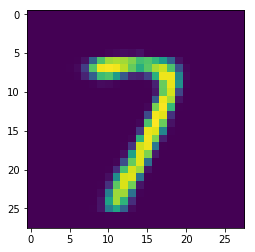

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  16



  0%|          | 1/214 [00:02<09:33,  2.69s/it]

[9 3 6 7 2 7 0 0 5 0 8 9 3 9 7 5 3 9 0 0 2 1 9 3 7 0 3 2 1 4 0 7 6 0 6 4 7
 5 0 6 1 4 4 4 8 8 4 4 0 0 8 4 1 4 9 9 7 1 8 0 5 0 2 4 8 6 0 4 8 2 8 5 8 1
 3 8 8 4 8 7 2 4 1 1 0 7 6 5 1 7 6 1 1 5 6 6 9 2 8 6 6 1 4 9 6 7 7 3 5 4 8
 0 2 5 1 0 8 2 0 1 2 9 4 9 0 5 6 4 2 0 8 1 6 7 6 7 1 4 6 9 1 3 2 5 0 3 0 4
 2 8 9 6 8 8 7 4 0 3 4 5 9 2 1 2 6 1 2 8 8 2 6 8 0 4 2 3 5 5 2 0 7 1 9 2 5
 8 4 4 4 0 5 8 1 3 8 6 7 3 2 4 2 2 7 0 6 6 2 8 5 1 0 7 6 3 4 3 8 0 4 1 3 0
 1 5 1 7 3 8 2 1 1 9 2 0 6 0 2 8 3 6 0 6 5 5 5 9 3 8 9 8 6 0 1 2 6 9]
[9 3 6 7 2 7 0 0 5 0 8 9 3 9 7 5 3 9 0 0 2 1 9 3 7 0 3 2 1 4 0 7 6 0 6 4 7
 5 0 6 1 4 4 4 8 8 4 4 0 0 8 4 1 4 9 9 7 1 8 0 5 0 2 4 8 6 0 4 8 2 8 5 8 1
 3 8 8 4 8 7 2 4 1 1 0 7 6 5 1 7 6 1 1 5 6 6 9 2 8 6 6 1 4 9 6 7 7 3 5 4 8
 0 2 5 1 0 8 2 0 1 2 9 4 9 0 5 6 4 2 0 8 1 6 7 6 7 1 4 6 9 1 3 2 5 0 3 0 4
 2 8 9 6 8 8 7 4 0 3 4 5 9 2 1 2 6 1 2 8 8 2 6 8 0 4 2 3 5 5 2 0 7 1 9 2 5
 8 4 4 4 0 5 8 1 3 8 6 7 3 2 4 2 2 7 0 6 6 2 8 5 1 0 7 6 3 4 3 8 0 4 1 3 0
 1 5 1 7 3 8 2 1 1 9 2 0 6 0 2


  1%|          | 2/214 [00:05<09:20,  2.64s/it]

[4 7 9 4 3 9 4 4 5 4 7 1 5 9 2 1 9 7 5 5 7 7 7 0 2 8 0 9 6 0 2 1 5 3 4 5 0
 9 6 4 5 1 1 8 3 6 9 9 0 2 8 2 2 6 9 5 5 4 3 5 1 1 6 3 1 4 7 1 7 5 8 6 8 1
 6 5 5 2 3 0 7 9 9 8 5 8 8 7 1 0 4 3 1 3 1 7 5 1 0 3 9 9 1 5 7 6 3 3 3 0 9
 7 7 7 8 7 6 8 4 6 2 6 3 8 1 3 2 6 8 5 1 8 0 0 2 5 3 0 4 6 8 3 0 2 1 9 0 2
 7 9 4 1 4 5 1 7 3 2 5 5 3 1 1 3 3 1 9 2 2 1 7 6 1 4 9 3 9 1 1 3 3 7 1 9 2
 7 3 3 6 6 3 1 1 8 4 7 2 7 3 3 3 1 4 6 4 8 7 5 6 0 4 8 4 8 9 3 1 2 6 1 8 6
 4 7 3 0 4 6 1 5 4 7 4 3 8 4 3 4 9 1 5 5 9 4 7 1 6 6 8 2 0 9 5 6 0 3]
[4 7 9 4 3 9 4 4 5 4 7 1 5 9 2 1 9 7 5 5 7 7 7 0 2 8 0 9 6 0 2 1 5 3 4 5 0
 9 6 4 5 1 1 8 3 6 9 9 0 2 8 2 2 6 9 5 5 4 3 5 1 1 6 3 1 4 7 1 7 5 8 6 8 1
 6 5 5 2 3 0 7 9 9 8 5 8 8 7 1 0 4 3 1 3 1 7 5 1 0 3 9 9 1 5 7 6 3 3 3 0 9
 7 7 7 8 7 6 8 4 6 2 6 3 8 1 3 2 6 8 5 1 8 0 0 2 5 3 0 4 6 8 3 0 2 1 9 0 2
 7 9 4 1 4 5 1 7 3 2 5 5 3 1 1 3 3 1 9 2 2 1 7 6 1 4 9 3 9 1 1 3 3 7 1 9 2
 7 3 3 6 6 3 1 1 8 4 7 2 7 3 3 3 1 4 6 4 8 7 5 6 0 4 8 4 8 9 3 1 2 6 1 8 6
 4 7 3 0 4 6 1 5 4 7 4 3 8 4 3


  1%|▏         | 3/214 [00:07<09:20,  2.65s/it]

[3 0 0 9 6 3 3 0 4 6 7 1 6 7 4 1 5 7 1 6 5 3 2 7 4 3 8 2 4 9 5 6 1 4 7 0 1
 3 8 6 9 0 3 1 4 0 1 0 2 6 9 7 0 2 3 6 0 1 9 5 1 5 1 7 1 9 2 2 1 8 1 5 7 2
 6 1 0 8 9 4 1 0 1 2 1 6 4 2 1 9 9 1 9 9 3 9 0 7 0 9 4 4 8 7 5 0 6 4 3 7 2
 2 3 5 1 4 7 2 9 0 3 0 3 7 0 5 6 6 9 4 4 7 9 9 5 0 1 4 9 9 3 7 8 2 6 7 0 4
 9 0 2 6 5 5 8 4 8 0 2 6 9 8 6 3 3 0 1 9 4 2 8 1 3 1 2 1 4 9 0 1 3 7 7 5 4
 2 7 3 8 6 8 5 1 9 2 0 7 8 6 7 4 3 4 1 2 1 4 9 2 1 0 4 1 1 1 8 6 9 8 8 2 2
 5 3 2 5 1 5 6 2 8 8 3 3 6 8 6 3 1 4 5 1 0 9 9 4 8 1 1 8 6 4 2 5 9 9]
[3 0 0 9 6 3 3 0 4 6 7 1 6 7 4 1 5 7 1 6 5 3 2 7 4 3 8 2 4 9 5 6 1 4 7 0 1
 3 8 6 9 0 3 1 4 0 1 0 2 6 9 7 0 2 3 6 0 1 9 5 1 5 1 7 1 9 2 2 1 8 1 5 7 2
 6 1 0 8 9 4 1 0 1 2 1 6 4 2 1 9 9 1 9 9 3 9 0 7 0 9 4 4 8 7 5 0 6 4 3 7 2
 2 3 5 1 4 7 2 9 0 3 0 3 7 0 5 6 6 9 4 4 7 9 9 5 0 1 4 9 9 3 7 8 2 6 7 0 4
 9 0 2 6 5 5 8 4 8 0 2 6 9 8 6 3 3 0 1 9 4 2 8 1 3 1 2 1 4 9 0 1 3 7 7 5 4
 2 7 3 8 6 8 5 1 9 2 0 7 8 6 7 4 3 4 1 2 1 4 9 2 1 0 4 1 1 1 8 6 9 8 8 2 2
 5 3 2 5 1 5 6 2 8 8 3 3 6 8 6


  2%|▏         | 4/214 [00:10<09:16,  2.65s/it]

[8 7 0 0 8 2 8 4 5 7 1 5 0 4 5 8 8 1 0 7 5 3 4 2 7 6 9 6 6 8 9 7 9 4 2 9 8
 3 4 6 5 1 7 0 6 4 0 4 7 0 9 6 1 9 4 2 0 1 6 5 8 2 6 6 3 3 5 4 1 6 6 5 0 0
 4 1 2 8 1 6 3 6 2 0 2 4 3 1 0 9 9 2 4 0 7 7 3 8 8 2 4 2 4 9 8 5 7 3 6 7 4
 8 4 6 1 0 4 9 4 4 9 9 7 0 1 2 8 4 4 1 2 7 7 5 2 7 2 6 9 3 9 8 5 6 8 1 8 0
 0 2 5 8 7 9 2 3 5 3 4 9 3 0 5 4 7 0 0 8 9 3 8 2 7 9 4 1 2 1 2 8 5 3 6 0 8
 4 2 7 7 2 7 1 5 6 9 9 1 7 1 8 3 7 4 9 7 8 1 8 4 1 2 7 8 8 2 6 2 5 2 7 0 2
 0 0 9 8 7 1 7 3 8 1 9 6 3 1 6 6 5 7 2 7 8 4 9 4 4 1 6 6 1 0 2 0 4 2]
[8 7 0 0 8 2 8 4 5 7 1 5 0 4 5 8 8 1 0 7 5 3 4 2 7 6 9 6 6 8 9 7 9 4 2 9 8
 3 4 6 5 1 7 0 6 4 0 4 7 0 9 6 1 9 4 2 0 1 6 5 8 2 6 6 3 3 5 4 1 6 6 5 0 0
 4 1 2 8 1 6 3 6 2 0 2 4 3 1 0 9 9 2 4 0 7 7 3 8 8 2 4 2 4 9 8 5 7 3 6 7 4
 8 4 6 1 0 4 9 4 4 9 9 7 0 1 2 8 4 4 1 2 7 7 5 2 7 2 6 9 3 9 8 5 6 8 1 8 0
 0 2 5 8 7 9 2 3 5 3 4 9 3 0 5 4 7 0 0 8 9 3 8 2 7 9 4 1 2 1 2 8 5 3 6 0 8
 4 2 7 7 2 7 1 5 6 9 9 1 7 1 8 3 7 4 9 7 8 1 8 4 1 2 7 8 8 2 6 2 5 2 7 0 2
 0 0 9 8 7 1 7 3 8 1 9 6 3 1 6


  2%|▏         | 5/214 [00:13<09:15,  2.66s/it]

[6 7 8 7 1 8 3 5 1 3 7 5 8 9 3 1 9 3 1 6 0 6 1 6 6 3 6 3 0 1 7 7 2 1 1 8 7
 9 9 0 2 1 7 4 5 4 8 4 5 9 9 6 0 2 8 1 3 5 8 3 6 6 9 1 5 2 1 3 2 9 5 8 9 4
 6 4 3 0 9 5 4 5 6 6 9 2 6 5 6 8 6 9 4 9 8 2 4 6 9 0 0 2 0 7 8 5 0 2 4 4 4
 5 7 0 6 6 2 0 9 8 2 1 6 9 0 7 0 2 9 2 5 1 6 7 6 9 9 5 6 2 1 4 4 7 9 6 3 8
 1 3 3 4 3 0 0 6 0 5 5 0 6 0 5 3 4 2 2 6 0 0 4 9 4 7 5 4 0 6 9 7 2 5 9 9 2
 9 0 2 9 3 4 0 0 3 6 5 2 5 1 1 2 8 2 8 0 5 9 0 1 6 7 1 3 8 6 4 9 3 3 8 1 9
 9 9 8 2 4 7 0 9 4 5 2 4 1 7 3 9 4 8 5 6 6 7 2 1 0 7 9 5 2 5 7 1 8 1]
[6 7 8 7 1 8 3 5 1 3 7 5 8 9 3 1 9 3 1 6 0 6 1 6 6 3 6 3 0 1 7 7 2 1 1 8 7
 9 9 0 2 1 7 4 5 4 8 4 5 9 9 6 0 2 8 1 3 5 8 3 6 6 9 1 5 2 1 3 2 9 5 8 9 4
 6 4 3 0 9 5 4 5 6 6 9 2 6 5 6 8 6 9 4 9 8 2 4 6 9 0 0 2 0 7 8 5 0 2 4 4 4
 5 7 0 6 6 2 0 9 8 2 1 6 9 0 7 0 2 9 2 5 1 6 7 6 9 9 5 6 2 1 4 4 7 9 6 3 8
 1 3 3 4 3 0 0 6 0 5 5 0 6 0 5 3 4 2 2 6 0 0 4 9 4 7 5 4 0 6 9 7 2 5 9 9 2
 9 0 2 9 3 4 0 0 3 6 5 2 5 1 1 2 8 2 8 0 5 9 0 1 6 7 1 3 8 6 4 9 3 3 8 1 9
 9 9 8 2 4 7 0 9 4 5 2 4 1 7 3


  3%|▎         | 6/214 [00:15<09:13,  2.66s/it]

[9 0 9 8 0 7 0 9 5 2 1 6 8 2 2 7 2 1 8 3 4 7 7 5 4 7 6 6 8 3 7 3 5 7 9 6 3
 4 6 3 5 3 7 3 2 1 8 2 9 1 0 2 6 5 9 8 2 9 2 5 1 3 4 1 1 1 5 4 9 2 3 6 8 3
 9 1 8 1 2 0 1 7 7 4 0 2 2 0 9 8 7 3 9 1 3 9 6 6 9 1 8 5 6 0 4 7 3 6 9 9 9
 8 2 2 4 6 2 6 6 9 2 4 1 1 9 0 5 8 4 9 6 4 1 0 3 8 0 9 4 7 3 3 6 7 2 3 5 4
 0 1 2 8 8 0 9 6 1 1 9 5 9 2 0 8 7 2 5 6 8 9 7 5 0 1 3 5 7 8 9 2 6 3 2 3 2
 2 4 9 2 9 3 4 5 9 5 0 0 7 5 1 0 3 2 7 3 9 4 6 2 8 7 2 2 5 8 4 1 9 3 6 2 0
 9 1 8 8 2 1 9 3 0 2 5 1 3 6 2 4 0 3 1 5 0 3 9 7 2 6 7 7 2 1 3 5 4 4]
[9 0 9 8 0 7 0 9 5 2 1 6 8 2 2 7 2 1 8 3 4 7 7 5 4 7 6 6 8 3 7 3 5 7 9 6 3
 4 6 3 5 3 7 3 2 1 8 2 9 1 0 2 6 5 9 8 2 9 2 5 1 3 4 1 1 1 5 4 9 2 3 6 8 3
 9 1 8 1 2 0 1 7 7 4 0 2 2 0 9 8 7 3 9 1 3 9 6 6 9 1 8 5 6 0 4 7 3 6 9 9 9
 8 2 2 4 6 2 6 6 9 2 4 1 1 9 0 5 8 4 9 6 4 1 0 3 8 0 9 4 7 3 3 6 7 2 3 5 4
 0 1 2 8 8 0 9 6 1 1 9 5 9 2 0 8 7 2 5 6 8 9 7 5 0 1 3 5 7 8 9 2 6 3 2 3 2
 2 4 9 2 9 3 4 5 9 5 0 0 7 5 1 0 3 2 7 3 9 4 6 2 8 7 2 2 5 8 4 1 9 3 6 2 0
 9 1 8 8 2 1 9 3 0 2 5 1 3 6 2


  3%|▎         | 7/214 [00:18<09:10,  2.66s/it]

[4 9 8 1 8 7 6 8 7 0 1 7 9 7 2 9 5 4 1 0 3 1 7 7 8 0 7 1 5 4 7 0 9 6 6 4 7
 3 6 8 6 0 5 2 9 0 2 6 0 5 4 3 9 4 7 0 7 2 6 3 3 5 0 2 6 9 6 0 8 0 7 5 7 3
 7 6 6 7 4 3 9 1 0 9 2 1 0 6 9 6 7 7 0 5 1 9 3 3 9 8 9 4 9 6 8 8 9 6 6 4 3
 8 1 7 6 2 8 4 7 1 2 8 7 3 7 7 2 7 9 0 4 0 3 4 8 8 1 1 2 0 4 2 7 7 8 7 3 4
 5 8 6 7 6 9 6 5 5 1 5 3 4 1 2 2 6 4 9 8 4 7 6 6 8 6 6 3 5 4 1 9 6 9 2 2 0
 9 9 1 1 3 9 3 9 4 6 1 1 2 6 8 2 6 5 7 6 9 0 6 5 9 1 6 8 3 2 5 1 3 5 4 7 5
 2 0 9 8 5 7 5 7 0 4 6 5 2 5 6 3 9 8 5 8 3 8 6 2 3 9 5 4 8 3 3 7 2 6]
[4 9 8 1 8 7 6 8 7 0 1 7 9 7 2 9 5 4 1 0 3 1 7 7 8 0 7 1 5 4 7 0 9 6 6 4 7
 3 6 8 6 0 5 2 9 0 2 6 0 5 4 3 9 4 7 0 7 2 6 3 3 5 0 2 6 9 6 0 8 0 7 5 7 3
 7 6 6 7 4 3 9 1 0 9 2 1 0 6 9 6 7 7 0 5 1 9 3 3 9 8 9 4 9 6 8 8 9 6 6 4 3
 8 1 7 6 2 8 4 7 1 2 8 7 3 7 7 2 7 9 0 4 0 3 4 8 8 1 1 2 0 4 2 7 7 8 7 3 4
 5 8 6 7 6 9 6 5 5 1 5 3 4 1 2 2 6 4 9 8 4 7 6 6 8 6 6 3 5 4 1 9 6 9 2 2 0
 9 9 1 1 3 9 3 9 4 6 1 1 2 6 8 2 6 5 7 6 9 0 6 5 9 1 6 8 3 2 5 1 3 5 4 7 5
 2 0 9 8 5 7 5 7 0 4 6 5 2 5 6


  4%|▎         | 8/214 [00:21<09:08,  2.66s/it]

[5 3 4 0 2 4 9 9 7 3 4 3 6 2 6 4 9 0 1 5 5 3 6 5 8 0 7 1 3 6 7 6 1 3 4 5 0
 5 1 8 4 7 1 1 9 9 2 7 1 3 5 8 6 8 5 1 4 3 8 9 6 7 2 1 6 2 0 5 4 1 5 0 0 5
 6 6 7 2 0 1 5 6 1 9 3 4 0 7 0 7 4 7 1 2 1 0 1 2 4 1 0 5 8 1 8 0 6 0 6 8 4
 8 3 4 9 0 0 2 1 3 9 3 1 7 7 5 5 4 6 0 3 5 1 6 8 9 3 5 3 8 1 4 1 4 1 9 5 5
 3 2 4 9 7 6 8 2 0 7 6 8 3 6 6 8 1 1 9 4 6 9 3 7 1 7 9 8 0 4 9 7 4 6 8 3 7
 0 9 4 8 4 2 4 2 5 9 3 8 0 4 0 4 1 0 9 6 1 3 9 2 1 5 7 1 3 4 4 3 7 5 6 1 5
 3 2 7 6 7 7 1 8 7 9 1 9 1 0 2 6 0 1 6 4 1 4 2 5 6 2 9 7 6 8 2 2 2 6]
[5 3 4 0 2 4 9 9 7 3 4 3 6 2 6 4 9 0 1 5 5 3 6 5 8 0 7 1 3 6 7 6 1 3 4 5 0
 5 1 8 4 7 1 1 9 9 2 7 1 3 5 8 6 8 5 1 4 3 8 9 6 7 2 1 6 2 0 5 4 1 5 0 0 5
 6 6 7 2 0 1 5 6 1 9 3 4 0 7 0 7 4 7 1 2 1 0 1 2 4 1 0 5 8 1 8 0 6 0 6 8 4
 8 3 4 9 0 0 2 1 3 9 3 1 7 7 5 5 4 6 0 3 5 1 6 8 9 3 5 3 8 1 4 1 4 1 9 5 5
 3 2 4 9 7 6 8 2 0 7 6 8 3 6 6 8 1 1 9 4 6 9 3 7 1 7 9 8 0 4 9 7 4 6 8 3 7
 0 9 4 8 4 2 4 2 5 9 3 8 0 4 0 4 1 0 9 6 1 3 9 2 1 5 7 1 3 4 4 3 7 5 6 1 5
 3 2 7 6 7 7 1 8 7 9 1 9 1 0 2


  4%|▍         | 9/214 [00:23<09:04,  2.66s/it]

[4 0 7 1 8 2 8 9 9 6 8 9 7 6 1 8 1 8 6 6 5 1 1 0 3 6 8 4 8 4 3 8 4 4 2 3 8
 6 6 8 5 8 3 2 0 1 5 7 9 5 3 6 6 9 7 5 5 0 1 6 8 9 9 0 2 8 7 5 8 2 5 4 8 9
 5 6 8 4 4 9 5 1 6 0 1 0 9 9 5 3 4 3 8 8 8 1 0 9 9 9 8 3 9 9 1 4 4 4 4 7 4
 3 7 4 5 8 8 0 9 5 4 9 6 0 9 7 1 1 1 8 6 3 2 7 6 0 8 4 1 4 6 7 7 9 4 1 4 2
 5 8 3 9 4 8 6 2 9 6 1 4 0 7 4 8 5 2 9 5 7 5 0 9 4 3 7 8 8 6 7 1 8 4 1 5 3
 2 3 4 2 1 6 9 3 7 3 6 1 9 6 7 2 9 1 3 0 4 6 6 1 7 2 9 5 1 4 9 9 7 3 0 2 6
 8 1 3 7 4 3 9 4 1 7 2 6 2 3 3 5 7 7 6 3 7 5 0 7 7 2 1 2 2 8 7 5 3 1]
[4 0 7 1 8 2 8 9 9 6 8 9 7 6 1 8 1 8 6 6 5 1 1 0 3 6 8 4 8 4 3 8 4 4 2 3 8
 6 6 8 5 8 3 2 0 1 5 7 9 5 3 6 6 9 7 5 5 0 1 6 8 9 9 0 2 8 7 5 8 2 5 4 8 9
 5 6 8 4 4 9 5 1 6 0 1 0 9 9 5 3 4 3 8 8 8 1 0 9 9 9 8 3 9 9 1 4 4 4 4 7 4
 3 7 4 5 8 8 0 9 5 4 9 6 0 9 7 1 1 1 8 6 3 2 7 6 0 8 4 1 4 6 7 7 9 4 1 4 2
 5 8 3 9 4 8 6 2 9 6 1 4 0 7 4 8 5 2 9 5 7 5 0 9 4 3 7 8 8 6 7 1 8 4 1 5 3
 2 3 4 2 1 6 9 3 7 3 6 1 9 6 7 2 9 1 3 0 4 6 6 1 7 2 9 5 1 4 9 9 7 3 0 2 6
 8 1 3 7 4 3 9 4 1 7 2 6 2 3 3


  5%|▍         | 10/214 [00:26<09:00,  2.65s/it]

[7 1 3 7 0 9 4 6 1 2 6 5 1 3 1 6 2 6 3 6 8 9 0 8 6 5 4 8 4 9 7 4 8 2 9 5 5
 8 8 3 0 2 7 1 0 8 8 2 6 7 7 8 2 9 3 8 7 1 3 7 7 1 7 4 3 9 3 1 4 4 6 9 5 4
 2 6 3 2 9 9 5 1 3 2 0 3 1 2 4 0 7 6 8 4 5 3 9 9 2 3 4 4 3 9 3 9 1 3 2 8 0
 3 3 7 0 9 8 8 2 6 6 4 5 9 4 1 8 6 3 7 1 7 9 1 5 9 9 6 6 4 0 1 8 9 9 6 3 1
 3 8 4 7 9 1 7 1 5 1 0 6 7 3 3 7 0 1 8 7 9 3 5 6 5 8 3 1 5 8 4 5 5 6 4 6 3
 4 7 2 1 4 1 9 6 9 4 5 6 6 5 9 5 3 2 6 6 8 7 4 4 7 8 0 4 1 6 8 4 1 3 7 1 5
 8 0 8 7 0 1 6 1 6 1 5 1 9 1 3 0 1 9 1 2 0 5 9 8 4 9 3 0 2 4 6 8 2 0]
[7 1 3 7 0 9 4 6 1 2 6 5 1 3 1 6 2 6 3 6 8 9 0 8 6 5 4 8 4 9 7 4 8 2 9 5 5
 8 8 3 0 2 7 1 0 8 8 2 6 7 7 8 2 9 3 8 7 1 3 7 7 1 7 4 3 9 3 1 4 4 6 9 5 4
 2 6 3 2 9 9 5 1 3 2 0 3 1 2 4 0 7 6 8 4 5 3 9 9 2 3 4 4 3 9 3 9 1 3 2 8 0
 3 3 7 0 9 8 8 2 6 6 4 5 9 4 1 8 6 3 7 1 7 9 1 5 9 9 6 6 4 0 1 8 9 9 6 3 1
 3 8 4 7 9 1 7 1 5 1 0 6 7 3 3 7 0 1 8 7 9 3 5 6 5 8 3 1 5 8 4 5 5 6 4 6 3
 4 7 2 1 4 1 9 6 9 4 5 6 6 5 9 5 3 2 6 6 8 7 4 4 7 8 0 4 1 6 8 4 1 3 7 1 5
 8 0 8 7 0 1 6 1 6 1 5 1 9 1 3


  5%|▌         | 11/214 [00:29<08:56,  2.64s/it]

[2 5 7 2 9 8 8 4 1 2 0 8 2 0 1 2 5 4 5 2 5 3 2 9 4 7 3 9 0 3 3 4 1 7 9 1 2
 6 0 6 3 3 2 5 3 2 0 9 3 0 2 2 5 4 7 4 8 6 5 6 5 8 9 9 9 0 2 4 1 7 2 2 3 6
 5 7 2 9 7 0 0 8 2 0 9 6 1 1 3 4 7 2 0 9 6 1 1 7 6 5 5 3 8 3 3 1 0 7 7 2 2
 5 5 8 9 1 9 8 1 7 2 2 4 6 8 3 6 0 1 9 4 8 9 9 0 3 6 2 6 2 2 5 2 2 7 7 0 4
 1 1 9 9 0 5 3 3 8 7 6 1 7 0 1 7 5 2 8 8 4 6 2 7 8 1 5 4 6 8 9 0 6 7 2 0 3
 5 2 9 5 0 0 0 5 7 7 7 6 8 1 5 8 2 7 3 8 5 2 5 6 3 2 9 7 2 9 6 1 8 4 1 4 7
 1 8 7 7 7 4 8 1 3 5 4 1 4 9 1 8 2 8 2 0 8 8 1 6 7 8 6 8 3 7 5 9 1 0]
[2 5 7 2 9 8 8 4 1 2 0 8 2 0 1 2 5 4 5 2 5 3 2 9 4 7 3 9 0 3 3 4 1 7 9 1 2
 6 0 6 3 3 2 5 3 2 0 9 3 0 2 2 5 4 7 4 8 6 5 6 5 8 9 9 9 0 2 4 1 7 2 2 3 6
 5 7 2 9 7 0 0 8 2 0 9 6 1 1 3 4 7 2 0 9 6 1 1 7 6 5 5 3 8 3 3 1 0 7 7 2 2
 5 5 8 9 1 9 8 1 7 2 2 4 6 8 3 6 0 1 9 4 8 9 9 0 3 6 2 6 2 2 5 2 2 7 7 0 4
 1 1 9 9 0 5 3 3 8 7 6 1 7 0 1 7 5 2 8 8 4 6 2 7 8 1 5 4 6 8 9 0 6 7 2 0 3
 5 2 9 5 0 0 0 5 7 7 7 6 8 1 5 8 2 7 3 8 5 2 5 6 3 2 9 7 2 9 6 1 8 4 1 4 7
 1 8 7 7 7 4 8 1 3 5 4 1 4 9 1


  6%|▌         | 12/214 [00:31<08:53,  2.64s/it]

[7 6 9 8 5 0 4 3 4 2 5 0 9 1 5 1 0 9 3 2 3 8 0 9 2 0 0 2 6 7 9 6 5 0 0 7 3
 9 0 2 6 9 8 4 8 6 0 3 5 4 9 1 6 9 7 7 7 6 7 9 9 8 3 9 6 0 4 5 3 4 5 8 7 0
 0 3 6 1 7 5 3 2 5 5 5 1 4 4 9 3 5 4 5 9 8 8 7 3 4 7 4 1 9 9 3 1 0 9 4 9 3
 1 1 6 4 3 8 7 6 2 1 8 0 0 5 0 2 6 9 6 7 0 4 6 6 3 7 9 4 1 8 7 8 1 5 1 6 1
 0 7 7 0 3 0 9 8 7 8 6 4 5 7 6 7 9 6 8 3 9 2 1 2 8 2 1 4 6 0 9 3 1 7 1 4 6
 2 4 3 5 2 6 2 4 3 7 3 3 4 4 6 1 3 6 0 3 6 5 1 2 5 7 0 9 1 2 2 9 8 5 6 6 3
 0 3 4 4 0 5 8 4 9 0 8 6 0 3 6 7 7 5 4 6 2 1 5 7 3 4 9 9 4 4 5 5 1 1]
[7 6 9 8 5 0 4 3 4 2 5 0 9 1 5 1 0 9 3 2 3 8 0 9 2 0 0 2 6 7 9 6 5 0 0 7 3
 9 0 2 6 9 8 4 8 6 0 3 5 4 9 1 6 9 7 7 7 6 7 9 9 8 3 9 6 0 4 5 3 4 5 8 7 0
 0 3 6 1 7 5 3 2 5 5 5 1 4 4 9 3 5 4 5 9 8 8 7 3 4 7 4 1 9 9 3 1 0 9 4 9 3
 1 1 6 4 3 8 7 6 2 1 8 0 0 5 0 2 6 9 6 7 0 4 6 6 3 7 9 4 1 8 7 8 1 5 1 6 1
 0 7 7 0 3 0 9 8 7 8 6 4 5 7 6 7 9 6 8 3 9 2 1 2 8 2 1 4 6 0 9 3 1 7 1 4 6
 2 4 3 5 2 6 2 4 3 7 3 3 4 4 6 1 3 6 0 3 6 5 1 2 5 7 0 9 1 2 2 9 8 5 6 6 3
 0 3 4 4 0 5 8 4 9 0 8 6 0 3 6


  6%|▌         | 13/214 [00:34<08:50,  2.64s/it]

[3 4 2 5 3 0 3 3 7 3 5 8 9 3 4 3 8 4 5 6 4 6 9 4 7 2 5 5 4 3 9 9 9 7 3 4 3
 7 2 8 5 1 9 1 3 5 6 0 5 9 9 9 3 7 1 0 8 7 7 7 2 6 4 1 5 4 9 8 6 7 8 1 4 3
 5 9 2 0 2 5 5 3 3 7 5 7 6 1 4 9 3 0 0 7 7 3 0 8 5 3 0 8 0 5 2 8 1 4 3 0 2
 7 0 4 8 0 4 6 8 4 0 2 5 3 6 2 0 5 3 4 5 8 0 9 7 4 7 2 3 3 5 5 5 5 6 9 0 7
 5 5 7 3 2 0 0 6 6 2 7 8 5 6 6 6 1 4 7 6 7 2 8 2 5 2 8 4 7 1 7 1 9 7 3 1 9
 7 6 3 1 7 2 7 2 6 2 3 8 6 9 3 4 5 1 5 5 7 9 0 5 7 0 5 3 0 3 6 4 7 6 8 6 6
 3 3 9 6 0 3 3 2 6 9 9 3 2 2 3 9 7 6 1 8 3 4 1 7 2 3 8 4 7 1 2 0 2 9]
[3 4 2 5 3 0 3 3 7 3 5 8 9 3 4 3 8 4 5 6 4 6 9 4 7 2 5 5 4 3 9 9 9 7 3 4 3
 7 2 8 5 1 9 1 3 5 6 0 5 9 9 9 3 7 1 0 8 7 7 7 2 6 4 1 5 4 9 8 6 7 8 1 4 3
 5 9 2 0 2 5 5 3 3 7 5 7 6 1 4 9 3 0 0 7 7 3 0 8 5 3 0 8 0 5 2 8 1 4 3 0 2
 7 0 4 8 0 4 6 8 4 0 2 5 3 6 2 0 5 3 4 5 8 0 9 7 4 7 2 3 3 5 5 5 5 6 9 0 7
 5 5 7 3 2 0 0 6 6 2 7 8 5 6 6 6 1 4 7 6 7 2 8 2 5 2 8 4 7 1 7 1 9 7 3 1 9
 7 6 3 1 7 2 7 2 6 2 3 8 6 9 3 4 5 1 5 5 7 9 0 5 7 0 5 3 0 3 6 4 7 6 8 6 6
 3 3 9 6 0 3 3 2 6 9 9 3 2 2 3


  7%|▋         | 14/214 [00:36<08:48,  2.64s/it]

[4 8 4 3 0 1 2 3 8 9 5 2 4 7 6 1 4 7 6 8 5 1 3 2 9 4 4 7 1 8 1 1 8 9 7 8 7
 7 8 1 9 7 3 9 5 8 1 7 2 7 3 5 4 9 6 1 8 4 6 5 1 5 1 0 8 7 2 4 2 7 3 4 5 1
 3 9 4 6 2 6 8 2 2 1 3 8 4 2 9 2 3 7 1 1 6 8 5 9 5 1 2 7 3 1 8 5 5 3 6 8 8
 7 4 5 3 6 9 4 3 7 2 6 1 7 3 8 6 1 5 2 4 7 0 6 9 3 4 7 7 9 6 8 0 1 9 4 3 6
 7 9 5 9 3 0 1 3 6 8 4 5 8 9 4 3 6 0 9 8 0 1 7 5 2 3 7 3 8 5 4 8 7 4 3 8 7
 1 5 1 9 2 6 0 6 5 9 1 8 5 2 0 1 6 3 3 6 3 6 8 1 7 5 9 4 0 5 7 6 5 1 8 7 6
 2 4 5 9 1 3 5 3 1 8 0 7 7 6 6 6 1 3 2 8 4 3 8 1 7 6 7 0 0 9 8 1 2 7]
[4 8 4 3 0 1 2 3 8 9 5 2 4 7 6 1 4 7 6 8 5 1 3 2 9 4 4 7 1 8 1 1 8 9 7 8 7
 7 8 1 9 7 3 9 5 8 1 7 2 7 3 5 4 9 6 1 8 4 6 5 1 5 1 0 8 7 2 4 2 7 3 4 5 1
 3 9 4 6 2 6 8 2 2 1 3 8 4 2 9 2 3 7 1 1 6 8 5 9 5 1 2 7 3 1 8 5 5 3 6 8 8
 7 4 5 3 6 9 4 3 7 2 6 1 7 3 8 6 1 5 2 4 7 0 6 9 3 4 7 7 9 6 8 0 1 9 4 3 6
 7 9 5 9 3 0 1 3 6 8 4 5 8 9 4 3 6 0 9 8 0 1 7 5 2 3 7 3 8 5 4 8 7 4 3 8 7
 1 5 1 9 2 6 0 6 5 9 1 8 5 2 0 1 6 3 3 6 3 6 8 1 7 5 9 4 0 5 7 6 5 1 8 7 6
 2 4 5 9 1 3 5 3 1 8 0 7 7 6 6


  7%|▋         | 15/214 [00:39<08:45,  2.64s/it]

[7 0 1 7 3 7 6 6 0 1 3 4 4 9 9 7 8 6 0 8 0 4 3 6 4 8 8 7 8 5 1 8 3 9 3 4 7
 3 2 9 2 9 6 0 2 8 4 2 5 5 4 6 0 5 4 6 5 4 5 9 0 2 5 8 6 4 8 1 9 7 8 1 1 8
 3 9 5 5 1 9 6 3 1 3 3 9 7 1 4 0 3 8 2 4 0 9 7 7 1 2 6 0 7 6 4 3 6 3 4 5 1
 6 2 2 2 8 4 8 6 6 8 6 0 5 2 0 1 7 4 0 2 0 8 1 8 6 1 4 2 8 4 6 8 1 1 7 8 7
 2 8 8 7 3 4 3 4 5 8 9 9 1 8 0 3 0 8 8 8 6 3 2 6 7 3 2 2 3 5 0 1 1 6 6 1 1
 5 1 6 2 9 8 0 3 4 6 7 8 3 0 1 2 4 5 6 4 3 5 2 1 1 0 5 5 5 3 8 7 4 1 8 9 9
 0 7 1 9 9 9 0 0 4 9 0 2 0 3 4 9 5 6 2 1 7 2 3 5 5 1 5 0 5 4 0 6 3 4]
[7 0 1 7 3 7 6 6 0 1 3 4 4 9 9 7 8 6 0 8 0 4 3 6 4 8 8 7 8 5 1 8 3 9 3 4 7
 3 2 9 2 9 6 0 2 8 4 2 5 5 4 6 0 5 4 6 5 4 5 9 0 2 5 8 6 4 8 1 9 7 8 1 1 8
 3 9 5 5 1 9 6 3 1 3 3 9 7 1 4 0 3 8 2 4 0 9 7 7 1 2 6 0 7 6 4 3 6 3 4 5 1
 6 2 2 2 8 4 8 6 6 8 6 0 5 2 0 1 7 4 0 2 0 8 1 8 6 1 4 2 8 4 6 8 1 1 7 8 7
 2 8 8 7 3 4 3 4 5 8 9 9 1 8 0 3 0 8 8 8 6 3 2 6 7 3 2 2 3 5 0 1 1 6 6 1 1
 5 1 6 2 9 8 0 3 4 6 7 8 3 0 1 2 4 5 6 4 3 5 2 1 1 0 5 5 5 3 8 7 4 1 8 9 9
 0 7 1 9 9 9 0 0 4 9 0 2 0 3 4


  7%|▋         | 16/214 [00:42<08:42,  2.64s/it]

[0 2 1 7 5 7 9 0 8 1 7 7 0 5 3 4 6 6 0 2 5 9 2 0 3 8 6 7 0 3 5 0 2 7 2 8 9
 3 6 5 8 6 1 6 2 9 5 5 9 2 0 6 4 1 1 2 1 0 9 0 6 0 0 5 3 1 3 8 5 5 5 6 9 3
 1 9 9 3 2 4 9 0 4 3 9 8 3 5 2 3 6 1 0 9 0 6 8 1 1 6 6 1 3 8 2 1 0 4 2 2 3
 9 4 7 8 2 9 9 8 4 2 7 7 8 3 0 5 7 5 8 0 0 8 4 4 8 1 1 5 9 6 7 0 3 7 5 0 4
 8 3 4 3 1 2 1 5 7 6 7 1 9 7 7 0 3 0 6 3 7 0 3 0 1 7 9 7 8 3 8 6 0 9 1 8 0
 4 0 5 1 5 9 7 7 1 5 0 1 3 9 3 4 2 3 8 4 5 1 3 2 9 8 2 1 2 4 6 0 0 0 0 7 3
 8 0 3 3 1 6 7 8 9 6 1 5 7 3 5 3 2 7 9 3 2 1 4 4 6 5 8 1 2 7 1 4 4 3]
[0 2 1 7 5 7 9 0 8 1 7 7 0 5 3 4 6 6 0 2 5 9 2 0 3 8 6 7 0 3 5 0 2 7 2 8 9
 3 6 5 8 6 1 6 2 9 5 5 9 2 0 6 4 1 1 2 1 0 9 0 6 0 0 5 3 1 3 8 5 5 5 6 9 3
 1 9 9 3 2 4 9 0 4 3 9 8 3 5 2 3 6 1 0 9 0 6 8 1 1 6 6 1 3 8 2 1 0 4 2 2 3
 9 4 7 8 2 9 9 8 4 2 7 7 8 3 0 5 7 5 8 0 0 8 4 4 8 1 1 5 9 6 7 0 3 7 5 0 4
 8 3 4 3 1 2 1 5 7 6 7 1 9 7 7 0 3 0 6 3 7 0 3 0 1 7 9 7 8 3 8 6 0 9 1 8 0
 4 0 5 1 5 9 7 7 1 5 0 1 3 9 3 4 2 3 8 4 5 1 3 2 9 8 2 1 2 4 6 0 0 0 0 7 3
 8 0 3 3 1 6 7 8 9 6 1 5 7 3 5


  8%|▊         | 17/214 [00:44<08:39,  2.64s/it]

[1 1 7 8 1 9 0 7 2 7 6 6 2 2 4 4 9 1 6 4 4 5 7 0 0 1 3 7 0 9 8 5 6 0 0 8 9
 3 4 1 0 7 1 6 6 3 3 0 8 9 0 8 9 6 8 8 8 8 3 0 9 7 4 4 9 7 2 2 8 7 6 6 8 7
 8 9 3 4 0 6 1 2 8 7 4 3 7 2 9 9 4 5 7 4 4 3 1 1 8 4 6 1 4 8 9 9 5 2 3 7 7
 5 0 0 4 5 4 6 3 4 0 6 0 4 0 4 0 4 0 4 9 7 8 6 6 2 2 4 7 3 0 8 6 2 3 7 0 5
 8 9 1 7 6 7 3 5 5 1 4 4 2 5 0 4 9 3 6 9 5 9 6 7 6 0 9 1 7 2 2 4 7 7 4 7 6
 3 3 2 0 2 1 5 2 3 7 0 6 7 4 3 9 4 8 9 7 3 6 3 7 1 7 3 6 3 2 8 5 6 7 5 2 4
 9 1 0 7 7 1 8 4 5 0 1 1 0 8 5 4 8 3 7 9 3 8 2 5 7 4 7 6 6 1 2 0 3 3]
[1 1 7 8 1 9 0 7 2 7 6 6 2 2 4 4 9 1 6 4 4 5 7 0 0 1 3 7 0 9 8 5 6 0 0 8 9
 3 4 1 0 7 1 6 6 3 3 0 8 9 0 8 9 6 8 8 8 8 3 0 9 7 4 4 9 7 2 2 8 7 6 6 8 7
 8 9 3 4 0 6 1 2 8 7 4 3 7 2 9 9 4 5 7 4 4 3 1 1 8 4 6 1 4 8 9 9 5 2 3 7 7
 5 0 0 4 5 4 6 3 4 0 6 0 4 0 4 0 4 0 4 9 7 8 6 6 2 2 4 7 3 0 8 6 2 3 7 0 5
 8 9 1 7 6 7 3 5 5 1 4 4 2 5 0 4 9 3 6 9 5 9 6 7 6 0 9 1 7 2 2 4 7 7 4 7 6
 3 3 2 0 2 1 5 2 3 7 0 6 7 4 3 9 4 8 9 7 3 6 3 7 1 7 3 6 3 2 8 5 6 7 5 2 4
 9 1 0 7 7 1 8 4 5 0 1 1 0 8 5


  8%|▊         | 18/214 [00:47<08:37,  2.64s/it]

[4 4 6 0 3 8 1 9 5 0 6 6 0 3 9 6 5 8 0 4 1 6 3 7 5 9 4 8 9 4 7 7 3 7 8 0 6
 8 6 5 3 2 7 3 6 3 1 9 4 3 7 9 4 8 1 9 4 1 4 7 9 8 1 2 2 1 7 3 1 6 3 7 0 7
 2 6 7 8 0 7 9 5 9 5 6 5 6 0 7 9 1 9 7 1 1 2 6 8 0 8 7 6 7 4 4 8 2 1 2 2 1
 2 3 0 7 7 2 2 2 7 7 4 4 7 8 2 9 2 4 7 2 4 8 1 1 4 4 3 4 2 8 0 9 1 0 6 7 9
 1 8 6 9 1 5 3 5 8 2 8 2 6 9 9 2 9 1 5 3 9 7 2 0 9 3 7 8 1 6 3 4 7 1 3 5 4
 8 8 0 6 8 2 1 2 5 7 2 3 7 8 8 4 7 0 0 0 7 8 9 3 6 7 9 5 8 7 4 8 9 9 8 7 6
 2 6 5 1 9 8 6 4 6 8 6 9 8 0 8 3 3 5 7 8 1 0 9 8 2 7 4 4 6 5 4 0 8 4]
[4 4 6 0 3 8 1 9 5 0 6 6 0 3 9 6 5 8 0 4 1 6 3 7 5 9 4 8 9 4 7 7 3 7 8 0 6
 8 6 5 3 2 7 3 6 3 1 9 4 3 7 9 4 8 1 9 4 1 4 7 9 8 1 2 2 1 7 3 1 6 3 7 0 7
 2 6 7 8 0 7 9 5 9 5 6 5 6 0 7 9 1 9 7 1 1 2 6 8 0 8 7 6 7 4 4 8 2 1 2 2 1
 2 3 0 7 7 2 2 2 7 7 4 4 7 8 2 9 2 4 7 2 4 8 1 1 4 4 3 4 2 8 0 9 1 0 6 7 9
 1 8 6 9 1 5 3 5 8 2 8 2 6 9 9 2 9 1 5 3 9 7 2 0 9 3 7 8 1 6 3 4 7 1 3 5 4
 8 8 0 6 8 2 1 2 5 7 2 3 7 8 8 4 7 0 0 0 7 8 9 3 6 7 9 5 8 7 4 8 9 9 8 7 6
 2 6 5 1 9 8 6 4 6 8 6 9 8 0 8


  9%|▉         | 19/214 [00:50<08:34,  2.64s/it]

[7 7 0 0 9 6 9 6 5 7 8 2 1 2 7 0 2 8 9 5 4 2 0 3 6 9 8 7 9 2 0 4 4 8 4 9 0
 4 7 7 5 7 8 0 0 2 2 6 8 3 6 5 0 3 0 0 1 7 2 9 1 8 3 7 5 6 4 3 2 2 3 8 9 5
 3 3 8 4 3 9 7 1 0 4 9 4 2 3 0 7 3 9 6 2 6 7 3 8 4 9 1 8 7 3 4 6 4 6 7 7 7
 6 3 2 3 6 1 6 8 8 0 0 9 1 7 0 5 3 0 2 0 6 3 7 0 4 5 8 3 9 5 6 4 9 2 1 3 5
 0 1 7 3 3 3 4 8 0 8 7 4 1 2 3 5 4 7 5 5 4 0 6 1 7 9 5 4 1 3 8 5 3 4 8 1 3
 9 1 6 5 0 2 5 6 0 7 3 9 2 8 9 1 8 7 5 8 4 0 1 8 7 7 4 6 1 3 9 0 6 9 1 5 3
 1 7 4 3 8 0 6 9 9 4 5 1 1 8 4 1 4 5 9 3 7 9 3 9 2 2 9 8 8 6 2 4 4 1]
[7 7 0 0 9 6 9 6 5 7 8 2 1 2 7 0 2 8 9 5 4 2 0 3 6 9 8 7 9 2 0 4 4 8 4 9 0
 4 7 7 5 7 8 0 0 2 2 6 8 3 6 5 0 3 0 0 1 7 2 9 1 8 3 7 5 6 4 3 2 2 3 8 9 5
 3 3 8 4 3 9 7 1 0 4 9 4 2 3 0 7 3 9 6 2 6 7 3 8 4 9 1 8 7 3 4 6 4 6 7 7 7
 6 3 2 3 6 1 6 8 8 0 0 9 1 7 0 5 3 0 2 0 6 3 7 0 4 5 8 3 9 5 6 4 9 2 1 3 5
 0 1 7 3 3 3 4 8 0 8 7 4 1 2 3 5 4 7 5 5 4 0 6 1 7 9 5 4 1 3 8 5 3 4 8 1 3
 9 1 6 5 0 2 5 6 0 7 3 9 2 8 9 1 8 7 5 8 4 0 1 8 7 7 4 6 1 3 9 0 6 9 1 5 3
 1 7 4 3 8 0 6 9 9 4 5 1 1 8 4


  9%|▉         | 20/214 [00:52<08:32,  2.64s/it]

[3 6 5 4 2 4 8 1 1 5 2 8 0 1 9 9 8 9 7 6 3 2 3 0 2 7 1 0 8 2 7 3 3 4 6 5 1
 8 0 4 2 6 9 5 5 5 9 6 6 8 4 2 3 2 5 0 0 4 5 4 4 7 6 4 3 9 2 2 4 2 8 2 1 5
 3 6 1 1 3 4 4 8 0 6 2 5 8 7 8 1 1 8 9 7 3 8 9 4 0 7 0 8 7 3 5 2 8 4 2 4 8
 7 1 0 3 1 8 9 4 2 9 9 3 3 4 2 2 2 3 0 4 2 5 6 8 5 0 7 6 0 9 8 5 2 9 0 0 8
 7 1 6 1 6 2 6 0 3 2 5 7 6 2 0 0 8 9 1 0 0 0 5 1 4 2 9 3 1 7 7 7 9 5 6 5 9
 4 8 1 3 1 6 3 2 8 2 5 3 9 2 3 9 4 1 7 5 8 1 9 8 9 7 0 0 9 7 9 0 6 3 5 3 3
 7 1 5 1 0 9 9 3 5 7 3 9 7 7 9 1 1 1 0 5 4 5 5 2 0 3 9 3 6 0 7 1 2 3]
[3 6 5 4 2 4 8 1 1 5 2 8 0 1 9 9 8 9 7 6 3 2 3 0 2 7 1 0 8 2 7 3 3 4 6 5 1
 8 0 4 2 6 9 5 5 5 9 6 6 8 4 2 3 2 5 0 0 4 5 4 4 7 6 4 3 9 2 2 4 2 8 2 1 5
 3 6 1 1 3 4 4 8 0 6 2 5 8 7 8 1 1 8 9 7 3 8 9 4 0 7 0 8 7 3 5 2 8 4 2 4 8
 7 1 0 3 1 8 9 4 2 9 9 3 3 4 2 2 2 3 0 4 2 5 6 8 5 0 7 6 0 9 8 5 2 9 0 0 8
 7 1 6 1 6 2 6 0 3 2 5 7 6 2 0 0 8 9 1 0 0 0 5 1 4 2 9 3 1 7 7 7 9 5 6 5 9
 4 8 1 3 1 6 3 2 8 2 5 3 9 2 3 9 4 1 7 5 8 1 9 8 9 7 0 0 9 7 9 0 6 3 5 3 3
 7 1 5 1 0 9 9 3 5 7 3 9 7 7 9


 10%|▉         | 21/214 [00:55<08:30,  2.64s/it]

[0 4 0 7 2 9 4 5 7 6 0 2 4 0 2 8 5 8 5 1 5 8 0 5 7 3 8 1 4 3 9 6 5 1 9 9 8
 7 7 0 1 7 8 5 8 1 2 1 5 3 4 7 6 7 6 2 4 5 8 0 9 6 1 7 8 4 2 7 6 6 4 3 8 6
 3 0 0 9 1 4 5 5 2 1 8 4 1 5 2 7 5 7 7 8 2 0 4 7 3 1 3 1 4 0 8 0 7 9 7 4 0
 5 0 7 5 8 1 9 9 3 5 1 9 8 8 3 6 9 4 9 2 7 9 0 7 0 4 4 0 0 7 7 9 3 2 1 1 6
 4 2 9 5 0 2 6 4 2 2 5 7 4 9 0 3 5 9 5 4 8 6 7 9 2 9 7 7 5 8 9 8 0 8 8 6 8
 8 0 0 8 5 4 1 7 3 3 9 7 3 1 5 6 5 8 3 9 9 3 7 2 9 6 0 7 4 4 2 5 8 8 1 0 4
 0 8 1 7 8 4 2 3 1 6 8 2 0 0 0 9 0 1 3 6 0 8 4 6 1 9 2 5 9 1 6 0 9 4]
[0 4 0 7 2 9 4 5 7 6 0 2 4 0 2 8 5 8 5 1 5 8 0 5 7 3 8 1 4 3 9 6 5 1 9 9 8
 7 7 0 1 7 8 5 8 1 2 1 5 3 4 7 6 7 6 2 4 5 8 0 9 6 1 7 8 4 2 7 6 6 4 3 8 6
 3 0 0 9 1 4 5 5 2 1 8 4 1 5 2 7 5 7 7 8 2 0 4 7 3 1 3 1 4 0 8 0 7 9 7 4 0
 5 0 7 5 8 1 9 9 3 5 1 9 8 8 3 6 9 4 9 2 7 9 0 7 0 4 4 0 0 7 7 9 3 2 1 1 6
 4 2 9 5 0 2 6 4 2 2 5 7 4 9 0 3 5 9 5 4 8 6 7 9 2 9 7 7 5 8 9 8 0 8 8 6 8
 8 0 0 8 5 4 1 7 3 3 9 7 3 1 5 6 5 8 3 9 9 3 7 2 9 6 0 7 4 4 2 5 8 8 1 0 4
 0 8 1 7 8 4 2 3 1 6 8 2 0 0 0


 10%|█         | 22/214 [00:58<08:27,  2.64s/it]

[7 1 2 9 1 1 8 0 5 6 2 4 8 7 8 2 5 0 8 6 3 3 8 3 4 1 6 1 4 0 3 5 0 0 7 4 0
 7 5 8 3 1 0 3 6 3 6 8 7 7 4 0 6 4 8 1 6 9 5 6 6 5 2 6 0 9 8 9 1 4 2 1 9 2
 5 4 0 4 9 7 7 2 2 1 8 2 0 1 6 0 7 8 7 1 5 8 4 6 1 7 0 1 2 3 1 2 6 7 9 5 6
 9 4 6 8 3 5 4 3 3 4 0 6 5 8 5 6 2 2 6 4 8 9 2 0 6 2 9 3 7 8 8 4 8 2 0 2 1
 0 4 3 8 4 0 5 2 4 9 6 1 1 8 1 0 1 7 6 1 6 3 6 5 3 5 2 0 2 3 6 9 3 2 0 5 6
 5 3 0 0 1 7 6 7 0 9 7 9 8 0 0 6 3 7 3 2 5 6 7 1 7 3 2 3 7 2 0 4 3 2 0 9 6
 3 4 5 4 2 8 8 8 4 0 8 9 5 6 3 7 2 2 1 8 0 4 4 0 1 9 5 5 8 7 9 6 7 9]
[7 1 2 9 1 1 8 0 5 6 2 4 8 7 8 2 5 0 8 6 3 3 8 3 4 1 6 1 4 0 3 5 0 0 7 4 0
 7 5 8 3 1 0 3 6 3 6 8 7 7 4 0 6 4 8 1 6 9 5 6 6 5 2 6 0 9 8 9 1 4 2 1 9 2
 5 4 0 4 9 7 7 2 2 1 8 2 0 1 6 0 7 8 7 1 5 8 4 6 1 7 0 1 2 3 1 2 6 7 9 5 6
 9 4 6 8 3 5 4 3 3 4 0 6 5 8 5 6 2 2 6 4 8 9 2 0 6 2 9 3 7 8 8 4 8 2 0 2 1
 0 4 3 8 4 0 5 2 4 9 6 1 1 8 1 0 1 7 6 1 6 3 6 5 3 5 2 0 2 3 6 9 3 2 0 5 6
 5 3 0 0 1 7 6 7 0 9 7 9 8 0 0 6 3 7 3 2 5 6 7 1 7 3 2 3 7 2 0 4 3 2 0 9 6
 3 4 5 4 2 8 8 8 4 0 8 9 5 6 3


 11%|█         | 23/214 [01:00<08:24,  2.64s/it]

[9 6 3 1 8 6 2 6 1 1 4 3 0 8 6 3 3 6 3 2 4 2 2 2 1 2 9 0 2 9 8 7 5 8 9 7 1
 5 7 2 5 6 2 1 0 3 5 9 3 2 6 4 6 5 7 2 9 6 3 6 9 4 1 5 1 5 2 3 3 0 7 1 6 4
 3 3 2 3 9 1 9 9 0 3 3 3 9 8 4 1 1 6 7 8 6 6 5 3 4 7 0 4 6 0 0 9 4 8 5 5 7
 8 5 0 3 3 2 2 5 5 3 9 8 0 6 3 2 6 8 6 7 0 0 6 2 9 1 0 6 0 0 2 5 1 2 7 2 2
 7 2 3 1 3 1 9 7 5 8 0 5 7 4 0 6 1 1 3 7 6 8 4 8 5 5 7 6 3 2 0 1 6 8 2 5 4
 1 1 5 1 5 0 3 2 6 7 6 0 8 0 9 2 2 8 7 8 2 7 6 1 1 8 0 3 3 7 3 1 3 2 5 4 1
 0 8 9 3 6 0 0 4 2 4 6 6 6 8 2 5 9 0 6 3 5 9 6 5 6 1 7 5 4 9 0 2 6 6]
[9 6 3 1 8 6 2 6 1 1 4 3 0 8 6 3 3 6 3 2 4 2 2 2 1 2 9 0 2 9 8 7 5 8 9 7 1
 5 7 2 5 6 2 1 0 3 5 9 3 2 6 4 6 5 7 2 9 6 3 6 9 4 1 5 1 5 2 3 3 0 7 1 6 4
 3 3 2 3 9 1 9 9 0 3 3 3 9 8 4 1 1 6 7 8 6 6 5 3 4 7 0 4 6 0 0 9 4 8 5 5 7
 8 5 0 3 3 2 2 5 5 3 9 8 0 6 3 2 6 8 6 7 0 0 6 2 9 1 0 6 0 0 2 5 1 2 7 2 2
 7 2 3 1 3 1 9 7 5 8 0 5 7 4 0 6 1 1 3 7 6 8 4 8 5 5 7 6 3 2 0 1 6 8 2 5 4
 1 1 5 1 5 0 3 2 6 7 6 0 8 0 9 2 2 8 7 8 2 7 6 1 1 8 0 3 3 7 3 1 3 2 5 4 1
 0 8 9 3 6 0 0 4 2 4 6 6 6 8 2


 11%|█         | 24/214 [01:03<08:21,  2.64s/it]

[9 3 9 2 6 9 1 4 6 1 1 6 4 3 8 3 7 0 0 7 0 8 0 0 1 3 1 9 2 6 2 6 9 6 9 0 6
 8 0 3 6 2 7 5 4 4 4 1 6 4 2 4 0 4 8 0 7 2 2 4 9 5 7 4 3 2 7 5 5 9 7 0 6 5
 6 4 3 4 1 6 5 0 1 7 8 3 9 6 2 9 3 8 8 1 5 5 2 3 9 6 0 3 9 0 6 2 2 9 9 8 3
 9 6 4 1 1 1 3 4 6 8 7 2 6 5 0 0 7 2 6 5 9 8 5 0 4 8 9 8 0 9 5 4 4 4 2 7 6
 3 5 0 3 7 3 7 3 5 7 8 4 4 9 1 7 2 3 3 6 2 1 4 1 8 5 4 7 3 1 6 3 5 1 6 8 0
 2 1 2 9 7 9 9 3 9 4 0 2 8 8 2 2 2 6 6 5 7 0 2 6 4 4 3 2 8 6 7 4 9 1 9 7 6
 8 9 5 3 7 3 5 2 7 9 7 2 6 2 8 4 7 4 2 3 2 7 1 4 1 6 3 9 3 2 3 9 1 6]
[9 3 9 2 6 9 1 4 6 1 1 6 4 3 8 3 7 0 0 7 0 8 0 0 1 3 1 9 2 6 2 6 9 6 9 0 6
 8 0 3 6 2 7 5 4 4 4 1 6 4 2 4 0 4 8 0 7 2 2 4 9 5 7 4 3 2 7 5 5 9 7 0 6 5
 6 4 3 4 1 6 5 0 1 7 8 3 9 6 2 9 3 8 8 1 5 5 2 3 9 6 0 3 9 0 6 2 2 9 9 8 3
 9 6 4 1 1 1 3 4 6 8 7 2 6 5 0 0 7 2 6 5 9 8 5 0 4 8 9 8 0 9 5 4 4 4 2 7 6
 3 5 0 3 7 3 7 3 5 7 8 4 4 9 1 7 2 3 3 6 2 1 4 1 8 5 4 7 3 1 6 3 5 1 6 8 0
 2 1 2 9 7 9 9 3 9 4 0 2 8 8 2 2 2 6 6 5 7 0 2 6 4 4 3 2 8 6 7 4 9 1 9 7 6
 8 9 5 3 7 3 5 2 7 9 7 2 6 2 8


 12%|█▏        | 25/214 [01:06<08:18,  2.64s/it]

[1 4 5 5 6 1 7 0 8 6 3 5 7 4 2 2 1 4 5 3 0 3 9 0 2 2 0 5 6 7 8 6 1 9 3 4 3
 6 7 4 1 3 3 6 7 4 0 9 6 2 6 3 4 8 5 2 0 1 2 2 8 3 8 3 9 7 9 2 0 1 6 4 0 5
 2 5 8 3 8 1 5 0 1 1 2 5 5 1 9 9 6 1 0 9 3 3 4 9 4 6 4 8 4 1 7 0 6 2 3 9 9
 3 0 7 8 7 7 4 3 3 4 5 2 3 1 4 4 2 0 2 2 9 8 6 8 2 3 2 8 1 0 3 6 7 0 4 9 2
 4 4 1 5 5 7 9 1 5 7 8 9 7 6 8 8 0 1 5 3 6 1 3 0 3 6 8 1 2 9 8 3 8 7 7 5 3
 2 8 5 3 7 3 8 8 6 1 2 4 9 1 1 0 1 9 3 3 8 7 1 3 6 0 5 8 2 0 9 1 2 7 7 0 5
 8 1 7 8 8 8 1 6 8 9 1 5 6 0 8 6 2 3 4 8 1 9 4 9 5 7 1 0 7 2 9 3 1 2]
[1 4 5 5 6 1 7 0 8 6 3 5 7 4 2 2 1 4 5 3 0 3 9 0 2 2 0 5 6 7 8 6 1 9 3 4 3
 6 7 4 1 3 3 6 7 4 0 9 6 2 6 3 4 8 5 2 0 1 2 2 8 3 8 3 9 7 9 2 0 1 6 4 0 5
 2 5 8 3 8 1 5 0 1 1 2 5 5 1 9 9 6 1 0 9 3 3 4 9 4 6 4 8 4 1 7 0 6 2 3 9 9
 3 0 7 8 7 7 4 3 3 4 5 2 3 1 4 4 2 0 2 2 9 8 6 8 2 3 2 8 1 0 3 6 7 0 4 9 2
 4 4 1 5 5 7 9 1 5 7 8 9 7 6 8 8 0 1 5 3 6 1 3 0 3 6 8 1 2 9 8 3 8 7 7 5 3
 2 8 5 3 7 3 8 8 6 1 2 4 9 1 1 0 1 9 3 3 8 7 1 3 6 0 5 8 2 0 9 1 2 7 7 0 5
 8 1 7 8 8 8 1 6 8 9 1 5 6 0 8


 12%|█▏        | 26/214 [01:08<08:16,  2.64s/it]

[9 6 1 2 9 1 7 0 1 7 0 2 6 5 6 9 4 7 9 4 5 7 3 7 5 4 2 2 9 0 7 8 1 7 0 7 3
 2 9 4 2 9 7 9 6 2 5 3 5 1 7 4 7 0 2 5 3 8 8 0 7 3 8 7 1 4 9 9 8 3 1 4 2 2
 2 9 7 3 3 4 1 2 0 1 6 7 4 2 6 1 7 5 3 0 4 0 3 1 2 3 0 3 3 4 7 0 0 1 0 4 8
 5 3 4 4 4 9 5 3 6 7 1 9 7 8 2 1 3 2 4 3 4 2 0 5 9 7 8 2 9 9 1 1 2 9 0 6 3
 7 0 1 8 6 4 3 2 7 6 1 1 7 7 8 3 4 3 7 3 0 0 8 5 8 3 5 1 0 6 0 0 2 3 0 2 8
 1 9 4 6 9 4 1 9 0 5 9 1 7 7 0 8 6 1 1 1 6 4 3 3 1 5 6 3 5 1 3 5 7 3 6 5 1
 8 0 3 0 5 2 3 3 8 8 3 0 0 1 9 4 1 0 5 2 8 7 7 9 3 0 9 1 2 9 5 5 2 3]
[9 6 1 2 9 1 7 0 1 7 0 2 6 5 6 9 4 7 9 4 5 7 3 7 5 4 2 2 9 0 7 8 1 7 0 7 3
 2 9 4 2 9 7 9 6 2 5 3 5 1 7 4 7 0 2 5 3 8 8 0 7 3 8 7 1 4 9 9 8 3 1 4 2 2
 2 9 7 3 3 4 1 2 0 1 6 7 4 2 6 1 7 5 3 0 4 0 3 1 2 3 0 3 3 4 7 0 0 1 0 4 8
 5 3 4 4 4 9 5 3 6 7 1 9 7 8 2 1 3 2 4 3 4 2 0 5 9 7 8 2 9 9 1 1 2 9 0 6 3
 7 0 1 8 6 4 3 2 7 6 1 1 7 7 8 3 4 3 7 3 0 0 8 5 8 3 5 1 0 6 0 0 2 3 0 2 8
 1 9 4 6 9 4 1 9 0 5 9 1 7 7 0 8 6 1 1 1 6 4 3 3 1 5 6 3 5 1 3 5 7 3 6 5 1
 8 0 3 0 5 2 3 3 8 8 3 0 0 1 9


 13%|█▎        | 27/214 [01:11<08:14,  2.64s/it]

[7 5 1 7 9 8 1 7 9 3 6 8 3 3 7 8 7 3 3 9 7 1 1 2 9 3 7 4 1 9 1 6 5 3 1 1 3
 7 0 3 5 5 8 5 7 3 3 2 1 5 5 6 8 3 1 1 3 2 8 7 0 8 5 6 4 7 8 8 5 6 2 0 9 7
 1 2 4 5 8 4 1 4 1 5 9 3 7 9 1 5 3 9 2 1 8 4 5 0 1 7 4 3 0 1 8 7 1 0 2 4 4
 9 0 4 1 6 8 2 1 3 3 6 6 7 8 3 6 2 1 3 3 4 9 6 8 4 8 1 0 1 1 1 8 9 4 4 6 7
 6 8 6 7 6 7 7 2 3 5 9 8 8 2 9 0 3 1 9 3 5 0 0 0 6 1 6 2 9 9 5 2 7 2 3 7 8
 5 3 3 9 3 0 9 1 4 7 1 6 2 4 4 7 4 1 7 4 4 2 0 9 0 5 2 7 5 4 6 7 3 5 7 6 3
 3 6 7 2 5 5 5 4 2 5 4 3 5 0 6 5 8 7 2 4 7 5 6 0 2 6 4 3 3 5 9 2 6 7]
[7 5 1 7 9 8 1 7 9 3 6 8 3 3 7 8 7 3 3 9 7 1 1 2 9 3 7 4 1 9 1 6 5 3 1 1 3
 7 0 3 5 5 8 5 7 3 3 2 1 5 5 6 8 3 1 1 3 2 8 7 0 8 5 6 4 7 8 8 5 6 2 0 9 7
 1 2 4 5 8 4 1 4 1 5 9 3 7 9 1 5 3 9 2 1 8 4 5 0 1 7 4 3 0 1 8 7 1 0 2 4 4
 9 0 4 1 6 8 2 1 3 3 6 6 7 8 3 6 2 1 3 3 4 9 6 8 4 8 1 0 1 1 1 8 9 4 4 6 7
 6 8 6 7 6 7 7 2 3 5 9 8 8 2 9 0 3 1 9 3 5 0 0 0 6 1 6 2 9 9 5 2 7 2 3 7 8
 5 3 3 9 3 0 9 1 4 7 1 6 2 4 4 7 4 1 7 4 4 2 0 9 0 5 2 7 5 4 6 7 3 5 7 6 3
 3 6 7 2 5 5 5 4 2 5 4 3 5 0 6


 13%|█▎        | 28/214 [01:13<08:11,  2.64s/it]

[0 7 9 1 0 1 8 0 5 6 2 4 1 2 1 6 7 5 4 0 8 9 5 0 2 4 4 3 1 2 0 3 3 7 0 8 3
 7 6 2 6 3 2 0 1 7 1 7 7 7 8 5 9 0 1 9 9 2 7 1 1 6 9 4 2 6 1 9 0 5 4 4 1 6
 1 7 6 4 2 4 3 0 0 1 8 3 1 5 3 1 5 6 2 0 7 8 9 5 5 4 0 7 9 8 8 2 0 0 1 3 1
 7 3 6 2 7 6 5 2 6 8 6 5 2 0 5 3 2 0 9 6 5 1 9 6 8 7 0 5 9 5 1 0 3 3 2 5 8
 8 9 8 1 0 6 1 0 5 2 8 7 8 9 8 2 9 3 6 2 5 0 9 1 3 9 3 9 5 9 7 3 7 2 3 6 7
 3 0 5 2 6 8 6 7 6 1 6 1 9 0 7 2 0 7 0 7 5 0 3 1 1 9 0 9 8 9 4 7 0 5 2 3 1
 3 6 6 8 7 1 5 6 8 4 5 1 8 8 1 9 3 6 6 3 7 1 4 2 3 6 7 8 4 2 3 1 9 2]
[0 7 9 1 0 1 8 0 5 6 2 4 1 2 1 6 7 5 4 0 8 9 5 0 2 4 4 3 1 2 0 3 3 7 0 8 3
 7 6 2 6 3 2 0 1 7 1 7 7 7 8 5 9 0 1 9 9 2 7 1 1 6 9 4 2 6 1 9 0 5 4 4 1 6
 1 7 6 4 2 4 3 0 0 1 8 3 1 5 3 1 5 6 2 0 7 8 9 5 5 4 0 7 9 8 8 2 0 0 1 3 1
 7 3 6 2 7 6 5 2 6 8 6 5 2 0 5 3 2 0 9 6 5 1 9 6 8 7 0 5 9 5 1 0 3 3 2 5 8
 8 9 8 1 0 6 1 0 5 2 8 7 8 9 8 2 9 3 6 2 5 0 9 1 3 9 3 9 5 9 7 3 7 2 3 6 7
 3 0 5 2 6 8 6 7 6 1 6 1 9 0 7 2 0 7 0 7 5 0 3 1 1 9 0 9 8 9 4 7 0 5 2 3 1
 3 6 6 8 7 1 5 6 8 4 5 1 8 8 1


 14%|█▎        | 29/214 [01:16<08:08,  2.64s/it]

[1 5 7 0 8 7 3 5 9 2 6 6 2 2 3 0 9 2 8 4 0 7 4 2 1 6 1 8 6 3 4 7 7 2 5 7 4
 6 2 6 9 1 8 2 7 9 7 1 9 8 4 6 2 8 3 4 6 3 9 2 5 6 6 8 5 6 4 2 0 6 7 8 7 1
 9 0 1 2 7 6 2 6 7 1 6 8 4 3 7 9 4 8 6 6 5 8 7 7 0 1 1 6 0 9 4 5 5 9 9 8 1
 4 3 9 2 3 1 2 8 2 0 0 5 4 8 1 6 2 0 6 4 3 5 4 7 6 6 5 2 3 3 3 5 8 1 7 9 8
 9 2 4 2 5 0 7 0 2 4 6 5 0 1 5 3 3 2 5 7 3 9 1 8 7 1 7 7 3 8 8 6 6 7 8 1 2
 4 0 8 8 6 0 4 3 6 8 7 2 0 1 1 0 3 8 0 1 4 3 1 3 8 1 6 8 5 6 9 7 0 7 4 5 6
 9 4 2 9 4 6 4 8 7 8 5 5 2 2 1 3 4 3 8 3 1 1 0 5 5 8 6 4 5 0 9 9 4 3]
[1 5 7 0 8 7 3 5 9 2 6 6 2 2 3 0 9 2 8 4 0 7 4 2 1 6 1 8 6 3 4 7 7 2 5 7 4
 6 2 6 9 1 8 2 7 9 7 1 9 8 4 6 2 8 3 4 6 3 9 2 5 6 6 8 5 6 4 2 0 6 7 8 7 1
 9 0 1 2 7 6 2 6 7 1 6 8 4 3 7 9 4 8 6 6 5 8 7 7 0 1 1 6 0 9 4 5 5 9 9 8 1
 4 3 9 2 3 1 2 8 2 0 0 5 4 8 1 6 2 0 6 4 3 5 4 7 6 6 5 2 3 3 3 5 8 1 7 9 8
 9 2 4 2 5 0 7 0 2 4 6 5 0 1 5 3 3 2 5 7 3 9 1 8 7 1 7 7 3 8 8 6 6 7 8 1 2
 4 0 8 8 6 0 4 3 6 8 7 2 0 1 1 0 3 8 0 1 4 3 1 3 8 1 6 8 5 6 9 7 0 7 4 5 6
 9 4 2 9 4 6 4 8 7 8 5 5 2 2 1


 14%|█▍        | 30/214 [01:19<08:05,  2.64s/it]

[2 7 5 6 8 7 2 4 7 5 8 7 0 7 7 6 0 2 3 7 1 0 2 0 4 8 4 7 7 0 9 7 8 5 8 7 7
 3 0 4 7 7 1 9 8 8 4 7 9 8 3 3 0 6 5 2 8 8 1 1 2 9 3 9 3 6 1 8 5 8 1 2 1 8
 0 3 5 1 4 2 8 0 8 7 7 7 0 7 9 1 7 9 8 2 4 9 6 7 7 9 0 4 2 5 3 9 5 0 0 0 8
 8 1 3 8 9 1 1 5 2 3 6 1 3 3 6 6 1 4 4 7 4 1 7 0 1 8 0 5 5 1 6 0 3 7 0 5 4
 0 9 8 9 1 7 0 1 9 9 7 5 4 0 0 8 3 8 6 6 5 3 7 9 6 4 1 5 3 1 6 7 1 1 5 4 6
 0 4 6 5 9 2 0 7 4 4 0 0 0 4 6 5 6 3 0 7 1 5 9 1 9 0 0 8 6 8 1 6 7 1 9 1 0
 3 2 6 4 4 1 2 2 4 8 3 6 4 6 3 5 0 1 6 7 6 1 1 5 9 4 7 9 1 0 7 6 2 3]
[2 7 5 6 8 7 2 4 7 5 8 7 0 7 7 6 0 2 3 7 1 0 2 0 4 8 4 7 7 0 9 7 8 5 8 7 7
 3 0 4 7 7 1 9 8 8 4 7 9 8 3 3 0 6 5 2 8 8 1 1 2 9 3 9 3 6 1 8 5 8 1 2 1 8
 0 3 5 1 4 2 8 0 8 7 7 7 0 7 9 1 7 9 8 2 4 9 6 7 7 9 0 4 2 5 3 9 5 0 0 0 8
 8 1 3 8 9 1 1 5 2 3 6 1 3 3 6 6 1 4 4 7 4 1 7 0 1 8 0 5 5 1 6 0 3 7 0 5 4
 0 9 8 9 1 7 0 1 9 9 7 5 4 0 0 8 3 8 6 6 5 3 7 9 6 4 1 5 3 1 6 7 1 1 5 4 6
 0 4 6 5 9 2 0 7 4 4 0 0 0 4 6 5 6 3 0 7 1 5 9 1 9 0 0 8 6 8 1 6 7 1 9 1 0
 3 2 6 4 4 1 2 2 4 8 3 6 4 6 3


 14%|█▍        | 31/214 [01:21<08:03,  2.64s/it]

[4 4 5 6 8 7 6 1 8 0 9 5 3 3 8 0 2 3 4 4 6 1 8 0 8 4 0 6 2 2 7 3 7 4 8 2 8
 0 5 6 2 0 0 8 4 6 7 6 0 7 2 2 9 1 6 2 5 4 4 5 5 5 6 5 2 7 4 6 4 3 9 1 7 1
 6 4 7 1 0 7 5 6 2 3 7 6 7 3 1 3 3 7 3 5 9 0 5 0 3 1 3 6 6 1 3 6 5 4 0 3 5
 7 8 2 0 5 8 7 1 4 5 5 4 5 7 0 6 7 4 0 3 5 6 5 2 8 4 2 1 1 8 3 8 4 7 5 0 3
 5 1 9 4 6 1 2 1 5 9 6 4 7 9 9 9 1 6 7 7 4 1 1 8 3 2 3 6 3 4 5 2 6 4 1 7 8
 4 9 5 0 5 2 9 9 9 4 6 1 3 6 5 1 1 9 7 8 8 7 1 8 7 6 7 2 2 4 7 3 0 5 8 7 1
 6 9 3 3 5 5 1 8 0 1 7 8 0 2 1 1 5 0 1 3 5 2 5 5 2 4 3 3 0 8 7 0 1 3]
[4 4 5 6 8 7 6 1 8 0 9 5 3 3 8 0 2 3 4 4 6 1 8 0 8 4 0 6 2 2 7 3 7 4 8 2 8
 0 5 6 2 0 0 8 4 6 7 6 0 7 2 2 9 1 6 2 5 4 4 5 5 5 6 5 2 7 4 6 4 3 9 1 7 1
 6 4 7 1 0 7 5 6 2 3 7 6 7 3 1 3 3 7 3 5 9 0 5 0 3 1 3 6 6 1 3 6 5 4 0 3 5
 7 8 2 0 5 8 7 1 4 5 5 4 5 7 0 6 7 4 0 3 5 6 5 2 8 4 2 1 1 8 3 8 4 7 5 0 3
 5 1 9 4 6 1 2 1 5 9 6 4 7 9 9 9 1 6 7 7 4 1 1 8 3 2 3 6 3 4 5 2 6 4 1 7 8
 4 9 5 0 5 2 9 9 9 4 6 1 3 6 5 1 1 9 7 8 8 7 1 8 7 6 7 2 2 4 7 3 0 5 8 7 1
 6 9 3 3 5 5 1 8 0 1 7 8 0 2 1


 15%|█▍        | 32/214 [01:24<08:00,  2.64s/it]

[0 8 3 3 1 1 0 9 2 6 8 9 0 7 6 2 4 1 9 4 4 7 8 7 4 4 0 0 8 7 0 7 0 9 5 6 4
 8 6 1 5 3 5 8 6 7 8 9 6 0 0 3 2 9 8 7 1 7 8 4 0 1 2 6 2 7 3 1 3 7 8 1 8 9
 7 6 4 6 5 5 1 8 7 9 4 2 3 9 0 9 7 2 6 9 4 2 5 5 1 3 3 9 1 7 4 2 2 8 1 8 9
 7 7 4 6 3 3 2 2 6 6 1 9 7 4 0 1 5 8 6 6 8 1 6 5 1 6 6 2 7 1 1 4 0 7 8 3 4
 8 0 0 7 1 0 7 1 4 5 1 1 0 6 3 9 4 6 4 0 1 4 4 8 4 0 5 0 9 9 8 5 7 4 6 3 5
 0 6 0 8 0 8 0 7 7 2 8 6 1 5 7 2 4 3 2 9 6 8 9 5 1 2 0 3 7 0 9 2 6 9 1 0 8
 8 9 6 4 4 7 5 8 5 4 9 7 6 2 5 6 5 1 8 2 0 6 2 4 8 8 5 9 6 1 1 0 4 3]
[0 8 3 3 1 1 0 9 2 6 8 9 0 7 6 2 4 1 9 4 4 7 8 7 4 4 0 0 8 7 0 7 0 9 5 6 4
 8 6 1 5 3 5 8 6 7 8 9 6 0 0 3 2 9 8 7 1 7 8 4 0 1 2 6 2 7 3 1 3 7 8 1 8 9
 7 6 4 6 5 5 1 8 7 9 4 2 3 9 0 9 7 2 6 9 4 2 5 5 1 3 3 9 1 7 4 2 2 8 1 8 9
 7 7 4 6 3 3 2 2 6 6 1 9 7 4 0 1 5 8 6 6 8 1 6 5 1 6 6 2 7 1 1 4 0 7 8 3 4
 8 0 0 7 1 0 7 1 4 5 1 1 0 6 3 9 4 6 4 0 1 4 4 8 4 0 5 0 9 9 8 5 7 4 6 3 5
 0 6 0 8 0 8 0 7 7 2 8 6 1 5 7 2 4 3 2 9 6 8 9 5 1 2 0 3 7 0 9 2 6 9 1 0 8
 8 9 6 4 4 7 5 8 5 4 9 7 6 2 5


 15%|█▌        | 33/214 [01:27<07:58,  2.64s/it]

[8 9 3 0 7 5 4 7 8 3 8 5 3 6 6 5 1 1 4 1 6 5 4 5 1 7 7 1 7 8 6 6 7 8 0 1 4
 7 2 0 2 9 2 1 9 7 0 7 7 0 4 7 2 3 3 1 8 4 5 0 0 9 2 6 3 1 0 4 2 8 4 1 6 3
 7 8 6 3 5 7 3 4 4 1 1 9 5 6 4 8 4 0 0 5 2 3 7 7 8 4 5 6 4 0 5 0 7 8 8 9 8
 4 0 4 4 3 7 6 1 0 0 5 9 0 8 2 1 6 5 1 6 1 3 0 5 5 2 0 7 1 6 4 7 4 1 6 9 2
 2 1 3 7 8 4 1 4 7 7 9 4 0 9 2 7 8 5 9 6 3 1 9 8 5 0 3 3 2 6 2 5 5 3 4 1 5
 4 0 5 0 5 3 0 4 2 5 6 6 4 0 7 3 7 6 9 2 6 8 4 2 6 8 6 8 7 3 8 0 6 6 8 6 0
 6 9 9 6 5 1 5 0 2 7 5 4 1 9 2 9 1 6 1 7 9 1 5 5 9 1 3 0 4 2 5 4 6 6]
[8 9 3 0 7 5 4 7 8 3 8 5 3 6 6 5 1 1 4 1 6 5 4 5 1 7 7 1 7 8 6 6 7 8 0 1 4
 7 2 0 2 9 2 1 9 7 0 7 7 0 4 7 2 3 3 1 8 4 5 0 0 9 2 6 3 1 0 4 2 8 4 1 6 3
 7 8 6 3 5 7 3 4 4 1 1 9 5 6 4 8 4 0 0 5 2 3 7 7 8 4 5 6 4 0 5 0 7 8 8 9 8
 4 0 4 4 3 7 6 1 0 0 5 9 0 8 2 1 6 5 1 6 1 3 0 5 5 2 0 7 1 6 4 7 4 1 6 9 2
 2 1 3 7 8 4 1 4 7 7 9 4 0 9 2 7 8 5 9 6 3 1 9 8 5 0 3 3 2 6 2 5 5 3 4 1 5
 4 0 5 0 5 3 0 4 2 5 6 6 4 0 7 3 7 6 9 2 6 8 4 2 6 8 6 8 7 3 8 0 6 6 8 6 0
 6 9 9 6 5 1 5 0 2 7 5 4 1 9 2


 16%|█▌        | 34/214 [01:29<07:55,  2.64s/it]

[1 5 6 1 0 2 6 3 1 4 5 3 7 8 8 3 9 5 6 1 7 3 0 0 8 6 0 7 3 3 6 1 4 4 3 3 2
 6 4 1 2 8 0 4 2 9 8 9 2 5 8 2 8 7 4 6 7 8 0 5 0 1 3 0 8 9 3 4 2 5 0 5 4 9
 6 0 8 8 1 6 2 1 9 2 2 3 9 3 7 5 0 1 4 9 6 7 6 9 2 8 4 1 3 2 1 6 0 3 4 1 2
 5 5 5 6 5 6 4 1 1 8 7 0 3 2 2 9 6 4 0 6 9 7 5 2 2 9 8 8 7 4 1 4 8 9 8 8 7
 9 6 1 5 0 5 5 4 7 6 0 7 2 0 9 3 5 7 1 1 6 9 5 1 9 2 7 8 2 0 2 8 1 3 8 0 5
 2 7 9 5 6 8 0 6 4 1 1 4 6 6 3 1 7 2 9 1 5 7 8 3 1 6 9 4 4 6 0 6 5 2 5 1 1
 2 5 7 3 7 5 7 2 5 3 9 1 8 4 5 8 4 5 9 4 4 7 3 8 8 4 5 8 1 6 5 9 1 8]
[1 5 6 1 0 2 6 3 1 4 5 3 7 8 8 3 9 5 6 1 7 3 0 0 8 6 0 7 3 3 6 1 4 4 3 3 2
 6 4 1 2 8 0 4 2 9 8 9 2 5 8 2 8 7 4 6 7 8 0 5 0 1 3 0 8 9 3 4 2 5 0 5 4 9
 6 0 8 8 1 6 2 1 9 2 2 3 9 3 7 5 0 1 4 9 6 7 6 9 2 8 4 1 3 2 1 6 0 3 4 1 2
 5 5 5 6 5 6 4 1 1 8 7 0 3 2 2 9 6 4 0 6 9 7 5 2 2 9 8 8 7 4 1 4 8 9 8 8 7
 9 6 1 5 0 5 5 4 7 6 0 7 2 0 9 3 5 7 1 1 6 9 5 1 9 2 7 8 2 0 2 8 1 3 8 0 5
 2 7 9 5 6 8 0 6 4 1 1 4 6 6 3 1 7 2 9 1 5 7 8 3 1 6 9 4 4 6 0 6 5 2 5 1 1
 2 5 7 3 7 5 7 2 5 3 9 1 8 4 5


 16%|█▋        | 35/214 [01:32<07:52,  2.64s/it]

[9 4 7 5 3 0 1 8 6 8 7 0 5 8 3 7 7 2 5 7 4 8 9 7 1 1 3 2 9 1 3 7 4 9 0 4 3
 4 7 7 6 8 6 8 2 0 6 0 2 4 7 6 5 9 6 0 1 4 2 0 2 2 8 9 1 1 2 5 7 0 2 9 0 7
 5 9 9 0 1 8 4 4 7 7 1 0 5 1 3 6 6 7 9 6 9 3 1 6 7 4 0 7 6 6 0 3 3 4 7 7 4
 7 4 0 9 2 3 3 0 1 4 2 6 5 1 0 3 5 5 6 2 8 1 7 8 3 3 9 9 6 5 1 0 0 9 6 4 7
 2 1 2 0 1 9 9 0 0 0 7 0 4 6 2 1 6 8 5 1 7 0 3 8 7 0 2 4 1 8 9 8 1 0 3 5 7
 5 6 1 6 0 4 5 3 3 4 6 1 0 8 3 9 4 3 9 7 2 0 0 9 1 1 3 1 7 1 5 3 8 9 3 8 5
 8 2 3 7 1 0 0 5 2 7 1 2 7 6 3 6 7 3 1 0 8 7 5 8 6 3 7 1 6 1 3 6 3 6]
[9 4 7 5 3 0 1 8 6 8 7 0 5 8 3 7 7 2 5 7 4 8 9 7 1 1 3 2 9 1 3 7 4 9 0 4 3
 4 7 7 6 8 6 8 2 0 6 0 2 4 7 6 5 9 6 0 1 4 2 0 2 2 8 9 1 1 2 5 7 0 2 9 0 7
 5 9 9 0 1 8 4 4 7 7 1 0 5 1 3 6 6 7 9 6 9 3 1 6 7 4 0 7 6 6 0 3 3 4 7 7 4
 7 4 0 9 2 3 3 0 1 4 2 6 5 1 0 3 5 5 6 2 8 1 7 8 3 3 9 9 6 5 1 0 0 9 6 4 7
 2 1 2 0 1 9 9 0 0 0 7 0 4 6 2 1 6 8 5 1 7 0 3 8 7 0 2 4 1 8 9 8 1 0 3 5 7
 5 6 1 6 0 4 5 3 3 4 6 1 0 8 3 9 4 3 9 7 2 0 0 9 1 1 3 1 7 1 5 3 8 9 3 8 5
 8 2 3 7 1 0 0 5 2 7 1 2 7 6 3


 17%|█▋        | 36/214 [01:35<07:50,  2.64s/it]

[3 1 3 7 2 3 3 7 5 0 2 1 2 9 3 8 1 7 2 0 4 6 3 4 6 2 0 3 7 9 3 0 1 4 9 8 6
 4 3 8 8 7 1 0 9 3 0 6 9 3 0 8 8 0 5 8 1 4 8 9 4 7 4 9 8 8 1 2 9 5 6 1 6 4
 6 0 3 2 7 4 1 3 3 9 6 6 1 8 3 7 1 6 5 3 2 2 9 8 2 8 9 5 3 5 2 6 2 1 2 2 7
 0 7 5 0 2 6 8 3 1 6 0 8 4 4 7 1 4 3 7 6 7 5 1 7 6 4 6 8 3 1 8 9 3 0 3 1 9
 0 7 7 8 8 2 3 7 5 9 2 8 8 6 0 1 7 0 6 1 6 7 0 6 7 3 2 8 7 2 2 4 6 9 4 2 3
 3 4 9 9 2 1 9 6 7 3 3 5 7 2 7 9 6 1 2 3 0 7 9 1 8 5 7 5 9 8 0 8 3 1 1 7 9
 8 1 0 3 4 0 4 5 1 2 6 2 2 8 4 3 1 8 1 2 9 6 2 6 7 7 1 9 9 3 3 1 1 6]
[3 1 3 7 2 3 3 7 5 0 2 1 2 9 3 8 1 7 2 0 4 6 3 4 6 2 0 3 7 9 3 0 1 4 9 8 6
 4 3 8 8 7 1 0 9 3 0 6 9 3 0 8 8 0 5 8 1 4 8 9 4 7 4 9 8 8 1 2 9 5 6 1 6 4
 6 0 3 2 7 4 1 3 3 9 6 6 1 8 3 7 1 6 5 3 2 2 9 8 2 8 9 5 3 5 2 6 2 1 2 2 7
 0 7 5 0 2 6 8 3 1 6 0 8 4 4 7 1 4 3 7 6 7 5 1 7 6 4 6 8 3 1 8 9 3 0 3 1 9
 0 7 7 8 8 2 3 7 5 9 2 8 8 6 0 1 7 0 6 1 6 7 0 6 7 3 2 8 7 2 2 4 6 9 4 2 3
 3 4 9 9 2 1 9 6 7 3 3 5 7 2 7 9 6 1 2 3 0 7 9 1 8 5 7 5 9 8 0 8 3 1 1 7 9
 8 1 0 3 4 0 4 5 1 2 6 2 2 8 4


 17%|█▋        | 37/214 [01:37<07:48,  2.64s/it]

[7 1 0 5 9 4 3 4 3 4 8 2 2 8 8 0 4 2 0 1 5 2 7 3 5 8 8 0 0 7 2 3 4 1 0 0 4
 1 0 4 5 5 7 6 9 3 9 1 0 7 9 8 9 5 3 2 3 5 2 7 2 4 9 3 0 5 9 9 2 5 8 2 3 3
 9 0 1 3 7 1 2 0 2 9 0 9 1 3 1 0 3 9 2 1 1 8 3 6 0 1 4 2 4 9 3 7 4 2 0 7 2
 1 9 8 2 9 8 1 5 3 6 9 5 1 6 6 4 0 7 2 2 3 5 6 9 8 7 5 1 8 3 7 4 0 3 2 9 2
 8 0 5 8 3 4 4 9 7 4 2 7 2 0 4 6 3 3 4 9 8 0 7 2 7 4 9 6 4 8 5 0 9 9 4 9 6
 3 3 4 8 1 3 7 2 0 5 8 7 6 9 7 6 8 3 9 0 4 8 5 8 3 4 1 0 7 8 8 8 0 1 3 5 6
 3 6 4 7 5 5 1 8 9 6 9 4 5 7 8 1 1 3 4 2 8 3 6 6 9 2 8 3 5 4 6 5 0 0]
[7 1 0 5 9 4 3 4 3 4 8 2 2 8 8 0 4 2 0 1 5 2 7 3 5 8 8 0 0 7 2 3 4 1 0 0 4
 1 0 4 5 5 7 6 9 3 9 1 0 7 9 8 9 5 3 2 3 5 2 7 2 4 9 3 0 5 9 9 2 5 8 2 3 3
 9 0 1 3 7 1 2 0 2 9 0 9 1 3 1 0 3 9 2 1 1 8 3 6 0 1 4 2 4 9 3 7 4 2 0 7 2
 1 9 8 2 9 8 1 5 3 6 9 5 1 6 6 4 0 7 2 2 3 5 6 9 8 7 5 1 8 3 7 4 0 3 2 9 2
 8 0 5 8 3 4 4 9 7 4 2 7 2 0 4 6 3 3 4 9 8 0 7 2 7 4 9 6 4 8 5 0 9 9 4 9 6
 3 3 4 8 1 3 7 2 0 5 8 7 6 9 7 6 8 3 9 0 4 8 5 8 3 4 1 0 7 8 8 8 0 1 3 5 6
 3 6 4 7 5 5 1 8 9 6 9 4 5 7 8


 18%|█▊        | 38/214 [01:40<07:45,  2.64s/it]

[2 5 3 0 0 6 6 5 0 3 2 1 1 1 1 1 9 1 8 0 9 9 5 3 2 2 6 5 0 4 5 8 7 6 8 3 5
 7 9 0 2 1 7 2 3 4 6 6 0 7 0 2 0 8 7 0 7 7 1 8 7 5 8 2 5 9 7 1 3 1 5 6 8 3
 0 9 8 8 2 3 8 8 3 2 0 7 8 8 7 9 3 6 2 5 3 3 7 7 3 4 2 9 1 5 0 1 7 0 4 4 1
 8 2 6 5 3 7 9 0 5 6 8 8 0 8 1 1 7 3 1 9 0 0 2 8 4 9 2 2 0 2 9 2 8 8 4 0 2
 1 7 2 7 0 8 5 8 9 5 4 9 2 1 5 8 8 7 0 0 6 3 6 6 1 3 1 6 1 2 3 5 3 1 3 7 2
 0 3 7 8 6 9 9 1 4 2 8 4 8 8 4 4 2 3 4 4 2 5 5 9 0 4 4 8 0 7 2 4 1 9 7 7 1
 6 5 2 0 0 7 7 6 8 0 3 9 0 4 6 5 0 2 6 1 3 6 4 4 7 4 1 0 6 9 6 7 0 0]
[2 5 3 0 0 6 6 5 0 3 2 1 1 1 1 1 9 1 8 0 9 9 5 3 2 2 6 5 0 4 5 8 7 6 8 3 5
 7 9 0 2 1 7 2 3 4 6 6 0 7 0 2 0 8 7 0 7 7 1 8 7 5 8 2 5 9 7 1 3 1 5 6 8 3
 0 9 8 8 2 3 8 8 3 2 0 7 8 8 7 9 3 6 2 5 3 3 7 7 3 4 2 9 1 5 0 1 7 0 4 4 1
 8 2 6 5 3 7 9 0 5 6 8 8 0 8 1 1 7 3 1 9 0 0 2 8 4 9 2 2 0 2 9 2 8 8 4 0 2
 1 7 2 7 0 8 5 8 9 5 4 9 2 1 5 8 8 7 0 0 6 3 6 6 1 3 1 6 1 2 3 5 3 1 3 7 2
 0 3 7 8 6 9 9 1 4 2 8 4 8 8 4 4 2 3 4 4 2 5 5 9 0 4 4 8 0 7 2 4 1 9 7 7 1
 6 5 2 0 0 7 7 6 8 0 3 9 0 4 6


 18%|█▊        | 39/214 [01:43<07:42,  2.64s/it]

[7 2 8 6 1 2 3 9 0 5 6 3 2 4 0 3 4 7 5 6 9 4 2 9 9 8 0 0 0 1 9 7 3 2 3 4 9
 0 1 5 3 9 9 9 4 7 3 7 9 5 0 1 6 0 1 8 9 4 5 4 4 9 7 7 2 2 4 6 8 2 8 2 4 5
 3 0 4 9 1 0 0 6 9 5 1 5 6 6 4 9 9 1 2 2 7 3 9 2 9 6 7 4 1 8 1 1 7 1 7 4 6
 7 1 3 9 2 9 8 3 4 3 0 3 9 5 7 0 9 3 4 0 6 5 4 0 8 8 2 9 6 7 3 6 1 5 8 3 7
 0 3 8 5 0 8 5 5 4 3 9 1 8 7 1 9 0 3 0 6 9 9 4 3 7 6 5 9 7 4 1 0 4 0 3 9 7
 8 2 8 3 8 5 7 4 8 0 7 5 8 9 1 1 1 9 7 6 5 7 9 6 2 6 3 7 7 9 1 8 1 2 1 2 9
 3 6 2 6 6 7 4 0 8 3 5 8 0 5 2 2 9 3 3 3 7 9 6 7 0 8 8 8 7 8 3 7 2 9]
[7 2 8 6 1 2 3 9 0 5 6 3 2 4 0 3 4 7 5 6 9 4 2 9 9 8 0 0 0 1 9 7 3 2 3 4 9
 0 1 5 3 9 9 9 4 7 3 7 9 5 0 1 6 0 1 8 9 4 5 4 4 9 7 7 2 2 4 6 8 2 8 2 4 5
 3 0 4 9 1 0 0 6 9 5 1 5 6 6 4 9 9 1 2 2 7 3 9 2 9 6 7 4 1 8 1 1 7 1 7 4 6
 7 1 3 9 2 9 8 3 4 3 0 3 9 5 7 0 9 3 4 0 6 5 4 0 8 8 2 9 6 7 3 6 1 5 8 3 7
 0 3 8 5 0 8 5 5 4 3 9 1 8 7 1 9 0 3 0 6 9 9 4 3 7 6 5 9 7 4 1 0 4 0 3 9 7
 8 2 8 3 8 5 7 4 8 0 7 5 8 9 1 1 1 9 7 6 5 7 9 6 2 6 3 7 7 9 1 8 1 2 1 2 9
 3 6 2 6 6 7 4 0 8 3 5 8 0 5 2


 19%|█▊        | 40/214 [01:45<07:39,  2.64s/it]

[8 8 9 1 4 9 2 0 2 4 7 3 4 2 4 7 6 2 1 2 8 8 4 2 8 1 7 5 4 5 8 2 9 7 8 2 6
 0 3 8 0 6 5 5 7 9 6 9 4 2 5 7 5 3 3 8 7 5 3 1 7 3 9 1 8 1 7 4 3 7 1 2 0 3
 2 3 4 0 9 4 1 9 4 6 3 9 6 7 3 1 6 3 5 7 6 1 2 3 7 0 3 3 1 9 4 7 0 0 6 4 5
 7 3 2 3 0 6 8 5 5 3 4 3 1 7 2 9 0 8 0 4 6 1 6 2 1 5 0 4 2 7 2 2 5 0 8 7 2
 7 3 5 7 7 9 8 4 0 8 0 7 8 4 7 8 8 2 4 6 0 1 7 1 6 5 0 2 4 3 9 5 0 1 5 7 6
 8 7 9 8 3 5 6 1 9 1 5 3 9 6 4 1 8 4 1 6 2 8 6 3 0 7 5 9 2 7 3 2 9 2 7 1 5
 1 6 0 5 7 3 2 6 7 7 2 0 6 4 2 0 0 4 8 0 0 4 7 2 9 0 8 3 8 6 2 4 6 7]
[8 8 9 1 4 9 2 0 2 4 7 3 4 2 4 7 6 2 1 2 8 8 4 2 8 1 7 5 4 5 8 2 9 7 8 2 6
 0 3 8 0 6 5 5 7 9 6 9 4 2 5 7 5 3 3 8 7 5 3 1 7 3 9 1 8 1 7 4 3 7 1 2 0 3
 2 3 4 0 9 4 1 9 4 6 3 9 6 7 3 1 6 3 5 7 6 1 2 3 7 0 3 3 1 9 4 7 0 0 6 4 5
 7 3 2 3 0 6 8 5 5 3 4 3 1 7 2 9 0 8 0 4 6 1 6 2 1 5 0 4 2 7 2 2 5 0 8 7 2
 7 3 5 7 7 9 8 4 0 8 0 7 8 4 7 8 8 2 4 6 0 1 7 1 6 5 0 2 4 3 9 5 0 1 5 7 6
 8 7 9 8 3 5 6 1 9 1 5 3 9 6 4 1 8 4 1 6 2 8 6 3 0 7 5 9 2 7 3 2 9 2 7 1 5
 1 6 0 5 7 3 2 6 7 7 2 0 6 4 2


 19%|█▉        | 41/214 [01:48<07:36,  2.64s/it]

[7 6 0 5 0 8 7 2 6 7 4 5 7 6 6 0 1 9 8 9 9 2 0 8 7 1 3 7 9 2 6 2 8 1 7 1 8
 8 1 4 1 1 3 7 3 8 3 0 3 3 7 6 2 0 9 4 5 0 7 1 4 7 6 9 3 6 4 8 9 1 4 5 9 8
 5 7 1 7 0 2 9 4 3 1 2 5 0 1 5 0 5 3 8 9 7 1 3 9 6 7 7 1 7 5 5 6 1 4 9 3 3
 0 6 9 8 7 0 4 0 2 4 8 2 4 0 7 6 7 3 7 2 8 7 8 6 8 6 4 0 2 1 5 2 3 1 8 2 5
 0 8 8 2 7 2 2 8 6 9 7 0 4 7 2 0 1 8 4 5 2 0 0 6 6 8 6 0 0 2 2 8 4 7 4 9 6
 3 4 1 1 4 6 3 4 3 4 2 8 1 0 1 4 5 9 9 8 9 9 8 8 4 4 1 1 7 8 3 1 0 1 3 5 7
 3 7 5 5 2 8 3 7 3 7 0 6 9 7 0 3 1 8 8 1 6 1 1 1 3 5 1 3 2 7 1 0 4 1]
[7 6 0 5 0 8 7 2 6 7 4 5 7 6 6 0 1 9 8 9 9 2 0 8 7 1 3 7 9 2 6 2 8 1 7 1 8
 8 1 4 1 1 3 7 3 8 3 0 3 3 7 6 2 0 9 4 5 0 7 1 4 7 6 9 3 6 4 8 9 1 4 5 9 8
 5 7 1 7 0 2 9 4 3 1 2 5 0 1 5 0 5 3 8 9 7 1 3 9 6 7 7 1 7 5 5 6 1 4 9 3 3
 0 6 9 8 7 0 4 0 2 4 8 2 4 0 7 6 7 3 7 2 8 7 8 6 8 6 4 0 2 1 5 2 3 1 8 2 5
 0 8 8 2 7 2 2 8 6 9 7 0 4 7 2 0 1 8 4 5 2 0 0 6 6 8 6 0 0 2 2 8 4 7 4 9 6
 3 4 1 1 4 6 3 4 3 4 2 8 1 0 1 4 5 9 9 8 9 9 8 8 4 4 1 1 7 8 3 1 0 1 3 5 7
 3 7 5 5 2 8 3 7 3 7 0 6 9 7 0


 20%|█▉        | 42/214 [01:50<07:34,  2.64s/it]

[0 9 8 7 3 5 3 2 0 8 8 1 8 9 3 6 5 4 7 6 4 6 7 9 2 1 0 6 1 8 1 5 1 8 1 1 5
 2 6 8 9 9 8 3 0 6 4 1 7 0 5 3 1 7 5 3 1 5 3 7 1 7 6 4 2 5 4 4 2 1 6 7 0 2
 2 9 1 7 2 3 5 8 5 4 5 9 7 7 8 8 0 9 2 0 2 3 0 3 0 3 1 7 6 2 5 9 2 2 3 8 3
 2 3 8 3 8 4 1 0 1 8 3 0 0 7 6 9 1 0 4 5 4 0 7 8 3 4 3 9 0 1 3 5 7 5 1 7 8
 3 7 7 9 1 2 1 0 1 4 4 1 3 1 1 8 0 1 6 3 1 2 1 1 3 9 6 0 9 6 8 8 2 0 5 7 0
 6 5 0 9 1 3 0 6 0 4 8 6 3 3 0 7 0 4 8 4 3 0 9 1 6 2 0 7 2 7 4 6 5 5 6 8 3
 9 3 5 2 2 2 3 2 5 0 4 6 9 3 0 2 0 6 8 8 7 8 2 0 9 3 0 9 1 4 4 1 0 2]
[0 9 8 7 3 5 3 2 0 8 8 1 8 9 3 6 5 4 7 6 4 6 7 9 2 1 0 6 1 8 1 5 1 8 1 1 5
 2 6 8 9 9 8 3 0 6 4 1 7 0 5 3 1 7 5 3 1 5 3 7 1 7 6 4 2 5 4 4 2 1 6 7 0 2
 2 9 1 7 2 3 5 8 5 4 5 9 7 7 8 8 0 9 2 0 2 3 0 3 0 3 1 7 6 2 5 9 2 2 3 8 3
 2 3 8 3 8 4 1 0 1 8 3 0 0 7 6 9 1 0 4 5 4 0 7 8 3 4 3 9 0 1 3 5 7 5 1 7 8
 3 7 7 9 1 2 1 0 1 4 4 1 3 1 1 8 0 1 6 3 1 2 1 1 3 9 6 0 9 6 8 8 2 0 5 7 0
 6 5 0 9 1 3 0 6 0 4 8 6 3 3 0 7 0 4 8 4 3 0 9 1 6 2 0 7 2 7 4 6 5 5 6 8 3
 9 3 5 2 2 2 3 2 5 0 4 6 9 3 0


 20%|██        | 43/214 [01:53<07:30,  2.64s/it]

[4 6 5 0 0 5 6 2 9 9 4 2 2 5 1 9 0 5 3 8 7 9 0 1 9 1 7 8 1 6 6 4 3 0 3 0 3
 8 2 8 9 4 5 8 7 6 5 8 9 4 6 7 6 4 5 9 6 5 1 7 4 8 9 5 9 3 5 6 1 6 2 7 0 2
 6 6 3 9 2 4 4 9 6 7 8 6 9 1 3 6 4 2 9 0 7 3 1 2 0 8 9 1 5 6 2 4 9 4 5 5 1
 7 1 9 1 9 7 3 8 0 6 0 1 2 6 2 1 4 8 7 9 3 1 6 5 9 8 1 8 9 2 0 0 4 2 9 9 6
 1 4 6 7 3 8 3 3 6 1 4 6 7 9 8 3 4 0 9 7 6 8 6 7 3 9 1 6 0 2 4 9 4 1 6 9 7
 3 1 7 0 4 2 2 5 9 4 3 3 2 6 9 5 1 3 3 4 7 0 7 4 8 7 7 8 1 7 4 3 9 6 8 4 9
 0 2 2 1 3 6 7 6 9 5 2 5 0 7 5 3 7 6 0 3 2 9 0 9 8 5 3 4 3 6 3 2 9 3]
[4 6 5 0 0 5 6 2 9 9 4 2 2 5 1 9 0 5 3 8 7 9 0 1 9 1 7 8 1 6 6 4 3 0 3 0 3
 8 2 8 9 4 5 8 7 6 5 8 9 4 6 7 6 4 5 9 6 5 1 7 4 8 9 5 9 3 5 6 1 6 2 7 0 2
 6 6 3 9 2 4 4 9 6 7 8 6 9 1 3 6 4 2 9 0 7 3 1 2 0 8 9 1 5 6 2 4 9 4 5 5 1
 7 1 9 1 9 7 3 8 0 6 0 1 2 6 2 1 4 8 7 9 3 1 6 5 9 8 1 8 9 2 0 0 4 2 9 9 6
 1 4 6 7 3 8 3 3 6 1 4 6 7 9 8 3 4 0 9 7 6 8 6 7 3 9 1 6 0 2 4 9 4 1 6 9 7
 3 1 7 0 4 2 2 5 9 4 3 3 2 6 9 5 1 3 3 4 7 0 7 4 8 7 7 8 1 7 4 5 9 6 8 4 9
 0 2 2 1 3 6 7 6 9 5 2 5 0 7 5


 21%|██        | 44/214 [01:55<07:26,  2.63s/it]

[3 5 4 1 0 0 8 1 2 8 9 9 9 7 6 0 9 5 1 1 9 4 1 8 3 9 4 2 1 0 4 2 4 1 7 5 5
 6 4 1 3 8 5 9 6 1 9 9 7 1 1 7 4 2 8 8 8 9 7 5 4 3 8 9 1 5 3 1 1 9 5 0 2 9
 5 2 4 2 5 7 9 1 2 3 8 0 3 1 0 3 5 5 0 3 7 3 5 6 2 1 4 8 5 2 1 9 6 3 1 2 0
 8 8 3 2 3 5 5 2 3 1 6 5 1 7 7 1 7 6 8 2 3 1 4 5 5 7 7 7 2 3 5 5 4 1 1 2 6
 6 5 0 5 8 7 9 9 3 8 3 7 1 0 6 5 5 5 7 7 8 7 9 7 7 9 6 7 5 6 7 5 7 2 3 3 1
 5 3 3 8 1 0 8 4 5 9 3 3 3 3 3 6 9 5 7 5 5 3 3 0 1 1 3 7 1 5 0 7 0 4 7 2 3
 7 5 6 1 0 7 2 9 2 0 8 9 6 3 0 4 0 9 9 1 5 0 3 8 3 1 1 8 1 2 2 3 7 0]
[3 5 4 1 0 0 8 1 2 8 9 9 9 7 6 0 9 5 1 1 9 4 1 8 3 9 4 2 1 0 4 2 4 1 7 5 5
 6 4 1 3 8 5 9 6 1 9 9 7 1 1 7 4 2 8 8 8 9 7 5 4 3 8 9 1 5 3 1 1 9 5 0 2 9
 5 2 4 2 5 7 9 1 2 3 8 0 3 1 0 3 5 5 0 3 7 3 5 6 2 1 4 8 5 2 1 9 6 3 1 2 0
 8 8 3 2 3 5 5 2 3 1 6 5 1 7 7 1 7 6 8 2 3 1 4 5 5 7 7 7 2 3 5 5 4 1 1 2 6
 6 5 0 5 8 7 9 9 3 8 3 7 1 0 6 5 5 5 7 7 8 7 9 7 7 9 6 7 5 6 7 5 7 2 3 3 1
 5 3 3 8 1 0 8 4 5 9 3 3 3 3 3 6 9 5 7 5 5 3 3 0 1 1 3 7 1 5 0 7 0 4 7 2 3
 7 5 6 1 0 7 2 9 2 0 8 9 6 3 0


 21%|██        | 45/214 [01:57<07:22,  2.62s/it]

[3 3 9 0 0 9 9 8 3 4 0 5 0 7 0 8 4 1 3 6 2 2 8 4 6 1 1 8 0 9 3 6 1 6 2 9 7
 6 2 6 5 9 1 9 6 8 5 4 7 3 3 2 6 1 5 4 9 6 7 9 9 3 6 0 2 7 9 1 7 6 5 0 8 2
 8 3 9 1 4 3 3 2 4 1 4 3 3 0 2 8 0 0 8 1 2 1 8 3 8 7 5 0 2 4 1 7 9 1 8 9 1
 7 0 6 6 3 1 3 9 0 2 6 0 5 6 7 5 0 2 7 1 7 2 8 9 1 9 3 7 4 8 9 1 2 5 9 2 1
 0 9 1 6 6 3 8 7 1 2 9 1 8 3 4 4 4 6 0 5 5 4 1 8 7 9 0 8 0 8 3 1 7 3 2 7 6
 5 6 2 1 9 6 0 9 0 2 5 4 9 7 3 6 7 2 1 5 4 9 6 8 1 5 1 1 2 5 7 9 1 3 8 3 6
 8 2 6 2 9 0 2 7 0 7 2 6 2 6 7 2 6 4 8 6 2 7 5 3 6 0 6 6 5 6 9 2 9 2]
[3 3 9 0 0 9 9 8 3 4 0 5 0 7 0 8 4 1 3 6 2 2 8 4 6 1 1 8 0 9 3 6 1 6 2 9 7
 6 2 6 5 9 1 9 6 8 5 4 7 3 3 2 6 1 5 4 9 6 7 9 9 3 6 0 2 7 9 1 7 6 5 0 8 2
 8 3 9 1 4 3 3 2 4 1 4 3 3 0 2 8 0 0 8 1 2 1 8 3 8 7 5 0 2 4 1 7 9 1 8 9 1
 7 0 6 6 3 1 3 9 0 2 6 0 5 6 7 5 0 2 7 1 7 2 8 9 1 9 3 7 4 8 9 1 2 5 9 2 1
 0 9 1 6 6 3 8 7 1 2 9 1 8 3 4 4 4 6 0 5 5 4 1 8 7 9 0 8 0 8 3 1 7 3 2 7 6
 5 6 2 1 9 6 0 9 0 2 5 4 9 7 3 6 7 2 1 5 4 9 6 8 1 5 1 1 2 5 7 9 1 3 8 3 6
 8 2 6 2 9 0 2 7 0 7 2 6 2 6 7


 21%|██▏       | 46/214 [01:59<07:18,  2.61s/it]

[1 8 5 1 5 6 8 0 7 8 0 6 1 0 3 7 4 8 5 7 1 8 4 7 2 4 6 5 5 5 2 5 9 2 5 7 9
 8 6 9 1 1 4 7 7 1 1 9 8 8 2 0 4 2 4 0 3 9 9 7 0 0 5 0 5 2 9 0 4 1 5 4 2 1
 1 3 3 3 8 7 4 1 5 2 6 9 5 8 7 8 0 5 4 1 7 2 0 8 3 7 9 0 5 6 0 3 7 3 4 5 5
 9 3 7 6 1 4 0 7 5 1 8 2 6 0 7 3 6 4 2 5 9 0 5 1 7 9 4 0 7 0 1 1 8 3 1 2 5
 0 7 7 0 4 1 9 0 6 5 6 0 3 5 7 9 1 5 9 1 7 6 8 4 4 8 9 2 9 2 4 1 4 2 5 3 3
 2 4 1 4 0 0 3 2 8 8 5 8 9 5 3 6 9 1 5 2 1 0 9 5 6 8 4 9 1 6 0 9 3 8 1 2 5
 7 0 7 9 3 1 2 9 4 9 2 1 7 4 9 4 9 3 6 7 9 3 3 3 9 7 5 3 8 2 2 0 3 8]
[1 8 5 1 5 6 8 0 7 8 0 6 1 0 3 7 4 8 5 7 1 8 4 7 2 4 6 5 5 5 2 5 9 2 5 7 9
 8 6 9 1 1 4 7 7 1 1 9 8 8 2 0 4 2 4 0 3 9 9 7 0 0 5 0 5 2 9 0 4 1 5 4 2 1
 1 3 3 3 8 7 4 1 5 2 6 9 5 8 7 8 0 5 4 1 7 2 0 8 3 7 9 0 5 6 0 3 7 3 4 5 5
 9 3 7 6 1 4 0 7 5 1 8 2 6 0 7 3 6 4 2 5 9 0 5 1 7 9 4 0 7 0 1 1 8 3 1 2 5
 0 7 7 0 4 1 9 0 6 5 6 0 3 5 7 9 1 5 9 1 7 6 8 4 4 8 9 2 9 2 4 1 4 2 5 3 3
 2 4 1 4 0 0 3 2 8 8 5 8 9 5 3 6 9 1 5 2 1 0 9 5 6 8 4 9 1 6 0 9 3 8 1 2 5
 7 0 7 9 3 1 2 9 4 9 2 1 7 4 9


 22%|██▏       | 47/214 [02:02<07:13,  2.60s/it]

[3 2 2 9 8 2 6 7 1 3 3 7 9 4 2 1 8 2 0 6 8 8 0 5 5 1 5 8 6 8 0 8 0 8 7 0 8
 0 4 1 7 6 9 6 9 7 0 7 3 6 0 3 7 0 3 1 3 4 5 0 6 3 5 6 3 0 3 0 8 6 7 8 7 9
 3 5 7 3 7 7 0 2 5 8 6 9 9 8 2 0 4 7 1 2 5 8 1 4 0 8 2 1 5 2 4 0 5 5 5 6 3
 1 7 3 3 9 4 5 5 5 3 5 1 8 3 7 2 9 9 8 2 9 8 5 8 3 9 8 5 7 6 6 4 3 1 8 8 2
 2 5 9 0 1 9 3 5 1 1 2 5 7 2 9 2 9 0 9 7 9 0 4 6 9 1 6 1 1 7 4 4 3 2 7 1 4
 1 5 9 3 2 0 6 2 3 3 8 5 2 3 5 6 3 7 7 0 2 1 9 2 1 3 5 8 6 7 6 0 1 4 8 9 9
 4 8 6 4 8 3 9 6 1 6 8 2 4 0 1 6 6 5 9 9 6 1 9 2 4 7 4 6 6 6 3 4 3 9]
[3 2 2 9 8 2 6 7 1 3 3 7 9 4 2 1 8 2 0 6 8 8 0 5 5 1 5 8 6 8 0 8 0 8 7 0 8
 0 4 1 7 6 9 6 9 7 0 7 3 6 0 3 7 0 3 1 3 4 5 0 6 3 5 6 3 0 3 0 8 6 7 8 7 9
 3 5 7 3 7 7 0 2 5 8 6 9 9 8 2 0 4 7 1 2 5 8 1 4 0 8 2 1 5 2 4 0 5 5 5 6 3
 1 7 3 3 9 4 5 5 5 3 5 1 8 3 7 2 9 9 8 2 9 8 5 8 3 9 8 5 7 6 6 4 3 1 8 8 2
 2 5 9 0 1 9 3 5 1 1 2 5 7 2 9 2 9 0 9 7 9 0 4 6 9 1 6 1 1 7 4 4 3 2 7 1 4
 1 5 9 3 2 0 6 2 3 3 8 5 2 3 5 6 3 7 7 0 2 1 9 2 1 3 5 8 6 7 6 0 1 4 8 9 9
 4 8 6 4 8 3 9 6 1 6 8 2 4 0 1


 22%|██▏       | 48/214 [02:04<07:09,  2.59s/it]

[8 3 0 6 3 0 0 0 9 4 5 8 8 5 1 2 7 9 1 8 5 2 2 4 6 9 9 1 2 4 2 1 9 9 9 2 7
 7 1 2 3 2 7 0 8 6 2 9 5 8 9 4 9 9 2 2 5 9 9 8 8 8 1 1 1 9 4 0 7 1 5 2 6 1
 3 4 2 7 0 9 5 9 3 1 5 4 5 0 5 9 1 9 5 4 6 4 7 1 6 7 7 6 0 3 3 0 3 0 4 7 9
 8 0 3 1 0 9 3 4 9 7 2 6 5 1 1 7 7 6 5 1 5 6 7 1 0 3 7 0 7 2 6 7 3 3 1 7 1
 3 6 8 3 9 1 8 5 0 5 4 0 5 5 2 7 9 4 3 4 3 9 4 1 2 0 4 1 3 4 6 5 6 8 4 1 1
 6 6 6 9 7 5 1 4 1 1 7 5 6 5 8 4 2 6 4 2 6 1 3 6 7 1 2 0 5 6 9 1 5 8 0 3 6
 4 7 1 1 6 6 8 5 1 6 5 1 9 7 9 6 2 0 7 5 8 6 2 7 1 1 7 9 5 4 9 1 2 9]
[8 3 0 6 3 0 0 0 9 4 5 8 8 5 1 2 7 9 1 8 5 2 2 4 6 9 9 1 2 4 2 1 9 9 9 2 7
 7 1 2 3 2 7 0 8 6 2 9 5 8 9 4 9 9 2 2 5 9 9 8 8 8 1 1 1 9 4 0 7 1 5 2 6 1
 3 4 2 7 0 9 5 9 3 1 5 4 5 0 5 9 1 9 5 4 6 4 7 1 6 7 7 6 0 3 3 0 3 0 4 7 9
 8 0 3 1 0 9 3 4 9 7 2 6 5 1 1 7 7 6 5 1 5 6 7 1 0 3 7 0 7 2 6 7 3 3 1 7 1
 3 6 8 3 9 1 8 5 0 5 4 0 5 5 2 7 9 4 3 4 3 9 4 1 2 0 4 1 3 4 6 5 6 8 4 1 1
 6 6 6 9 7 5 1 4 1 1 7 5 6 5 8 4 2 6 4 2 6 1 3 6 7 1 2 0 5 6 9 1 5 8 0 3 6
 4 7 1 1 6 6 8 5 1 6 5 1 9 7 9


 23%|██▎       | 49/214 [02:06<07:05,  2.58s/it]

[7 7 7 2 4 4 1 1 3 2 6 0 6 5 0 0 6 9 1 3 4 0 6 7 7 5 3 0 9 0 2 9 8 7 3 2 9
 1 9 1 7 2 6 1 3 1 8 9 2 5 8 8 4 5 4 6 1 0 2 1 1 7 3 5 1 0 9 5 7 8 4 0 9 1
 5 6 8 7 2 7 7 8 1 3 1 9 4 3 7 5 2 0 9 9 0 8 2 4 6 0 6 9 1 2 7 7 4 8 0 4 7
 1 1 1 1 6 0 7 7 7 7 5 3 5 2 3 7 6 7 0 3 7 1 2 7 0 4 9 9 3 2 2 8 8 3 0 2 1
 7 7 5 9 7 2 2 6 0 2 2 0 1 1 4 2 1 2 1 3 3 1 2 2 4 6 4 7 5 0 4 3 8 0 0 5 5
 3 2 4 3 4 7 1 4 6 3 4 7 1 3 4 0 7 0 7 0 4 1 4 2 0 7 2 8 3 9 7 7 0 8 5 7 3
 4 7 3 2 9 0 5 7 3 0 4 1 4 9 0 6 8 7 9 4 3 4 8 8 5 1 9 1 1 3 2 1 7 2]
[7 7 7 2 4 4 1 1 3 2 6 0 6 5 0 0 6 9 1 3 4 0 6 7 7 5 3 0 9 0 2 9 8 7 3 2 9
 1 9 1 7 2 6 1 3 1 8 9 2 5 8 8 4 5 4 6 1 0 2 1 1 7 3 5 1 0 9 5 7 8 4 0 9 1
 5 6 8 7 2 7 7 8 1 3 1 9 4 3 7 5 2 0 9 9 0 8 2 4 6 0 6 9 1 2 7 7 4 8 0 4 7
 1 1 1 1 6 0 7 7 7 7 5 3 5 2 3 7 6 7 0 3 7 1 2 7 0 4 9 9 3 2 2 8 8 3 0 2 1
 7 7 5 9 7 2 2 6 0 2 2 0 1 1 4 2 1 2 1 3 3 1 2 2 4 6 4 7 5 0 4 3 8 0 0 5 5
 3 2 4 3 4 7 1 4 6 3 4 7 1 3 4 0 7 0 7 0 4 1 4 2 0 7 2 8 3 9 7 7 0 8 5 7 3
 4 7 3 2 9 0 5 7 3 0 4 1 4 9 0


 23%|██▎       | 50/214 [02:08<07:01,  2.57s/it]

[1 5 7 5 9 8 3 4 1 7 3 5 9 0 7 9 1 4 7 4 1 3 7 2 3 4 7 3 0 5 5 2 0 8 9 6 9
 7 4 9 7 1 2 7 5 3 6 7 2 7 2 5 4 4 9 7 3 4 6 0 7 1 2 6 4 1 7 3 6 8 3 4 2 4
 7 4 1 7 0 8 8 0 1 4 3 5 2 7 8 5 4 5 2 9 2 2 9 1 6 6 8 0 6 9 2 5 4 3 9 9 1
 7 4 6 2 2 6 8 5 2 9 1 1 0 8 4 8 2 6 2 3 2 6 8 1 0 4 1 7 2 9 7 5 1 1 1 2 4
 3 4 8 1 1 9 6 1 3 1 5 0 2 4 6 2 1 3 3 0 2 2 4 3 3 6 3 2 3 2 4 9 9 0 2 2 7
 3 3 1 7 1 1 8 9 8 4 2 7 2 8 3 2 1 1 6 1 2 9 0 6 9 6 4 4 7 3 6 2 4 9 6 7 2
 2 1 5 5 1 0 2 0 6 1 9 7 6 7 8 1 9 5 8 2 8 8 2 9 3 7 0 2 1 1 3 6 7 7]
[1 5 7 5 9 8 3 4 1 7 3 5 9 0 7 9 1 4 7 4 1 3 7 2 3 4 7 3 0 5 5 2 0 8 9 6 9
 7 4 9 7 1 2 7 5 3 6 7 2 7 2 5 4 4 9 7 3 4 6 0 7 1 2 6 4 1 7 3 6 8 3 4 2 4
 7 4 1 7 0 8 8 0 1 4 3 5 2 7 8 5 4 5 2 9 2 2 9 1 6 6 8 0 6 9 2 5 4 3 9 9 1
 7 4 6 2 2 6 8 5 2 9 1 1 0 8 4 8 2 6 2 3 2 6 8 1 0 4 1 7 2 9 7 5 1 1 1 2 4
 3 4 8 1 1 9 6 1 3 1 5 0 2 4 6 2 1 3 3 0 2 2 4 3 3 6 3 2 3 2 4 9 9 0 2 2 7
 3 3 1 7 1 1 8 9 8 4 2 7 2 8 3 2 1 1 6 1 2 9 0 6 9 6 4 4 7 3 6 2 4 9 6 7 2
 2 1 5 5 1 0 2 0 6 1 9 7 6 7 8


 24%|██▍       | 51/214 [02:10<06:57,  2.56s/it]

[4 8 6 3 8 3 9 3 1 1 9 5 7 1 1 8 3 3 2 9 2 9 1 8 4 6 8 7 7 9 6 6 3 6 8 5 0
 9 1 7 1 0 7 8 6 8 4 9 9 5 3 7 6 6 0 9 7 9 1 6 1 5 5 7 2 4 6 7 9 1 7 3 1 7
 5 4 2 3 1 3 3 7 4 7 3 1 6 1 2 8 7 7 3 9 2 9 8 3 7 4 2 9 8 8 9 4 8 9 7 6 8
 5 9 8 9 0 5 7 6 1 9 3 9 2 9 7 3 3 3 0 0 1 9 8 9 8 1 2 0 8 7 1 4 3 1 5 8 3
 5 9 5 0 1 5 8 1 8 1 8 3 5 3 8 6 1 2 2 7 1 4 7 9 3 5 3 8 4 7 2 4 0 3 1 2 7
 5 5 8 5 8 6 0 4 5 0 3 4 4 7 2 4 9 0 7 4 7 1 4 3 0 0 8 8 7 6 3 4 4 9 1 2 2
 5 4 9 1 8 9 9 2 2 2 9 2 2 5 4 9 4 5 7 1 6 5 9 3 9 0 4 6 2 4 3 1 3 0]
[4 8 6 3 8 3 9 3 1 1 9 5 7 1 1 8 3 3 2 9 2 9 1 8 4 6 8 7 7 9 6 6 3 6 8 5 0
 9 1 7 1 0 7 8 6 8 4 9 9 5 3 7 6 6 0 9 7 9 1 6 1 5 5 7 2 4 6 7 9 1 7 3 1 7
 5 4 2 3 1 3 3 7 4 7 3 1 6 1 2 8 7 7 3 9 2 9 8 3 7 4 2 9 8 8 9 4 8 9 7 6 8
 5 9 8 9 0 5 7 6 1 9 3 9 2 9 7 3 3 3 0 0 1 9 8 9 8 1 2 0 8 7 1 4 3 1 5 8 3
 5 9 5 0 1 5 8 1 8 1 8 3 5 3 8 6 1 2 2 7 1 4 7 9 3 5 3 8 4 7 2 4 0 3 1 2 7
 5 5 8 5 8 6 0 4 5 0 3 4 4 7 2 4 9 0 7 4 7 1 4 3 0 0 8 8 7 6 3 4 4 9 1 2 2
 5 4 9 1 8 9 9 2 2 2 9 2 2 5 4


 24%|██▍       | 52/214 [02:12<06:53,  2.56s/it]

[3 8 4 0 0 1 7 3 4 2 3 4 9 3 5 8 0 5 0 9 0 1 1 3 0 7 5 1 4 0 2 7 8 1 8 6 3
 8 9 0 6 4 6 6 1 0 5 4 4 0 7 6 2 1 6 5 5 2 4 4 1 2 0 7 3 7 7 9 1 0 7 9 9 1
 3 0 7 5 7 0 7 3 8 1 6 9 7 2 6 6 0 8 9 9 9 0 8 2 6 6 1 4 7 9 1 1 5 2 8 6 2
 7 4 0 7 9 4 3 8 5 4 2 0 4 1 6 5 9 3 0 1 0 3 2 4 4 8 4 2 0 1 7 2 9 2 6 8 4
 2 6 0 5 2 4 8 5 0 0 4 1 9 9 5 3 0 6 6 2 9 8 6 2 5 9 6 8 5 0 9 7 2 7 1 0 6
 6 6 8 3 7 9 2 5 2 2 5 3 5 3 1 8 1 9 6 3 7 7 3 8 6 2 8 1 2 9 2 5 7 6 1 4 3
 8 8 7 4 8 0 0 9 8 2 2 9 9 0 5 0 0 9 2 4 6 2 0 4 5 9 1 4 6 6 9 4 5 0]
[3 8 4 0 0 1 7 3 4 2 3 4 9 3 5 8 0 5 0 9 0 1 1 3 0 7 5 1 4 0 2 7 8 1 8 6 3
 8 9 0 6 4 6 6 1 0 5 4 4 0 7 6 2 1 6 5 5 2 4 4 1 2 0 7 3 7 7 9 1 0 7 9 9 1
 3 0 7 5 7 0 7 3 8 1 6 9 7 2 6 6 0 8 9 9 9 0 8 2 6 6 1 4 7 9 1 1 5 2 8 6 2
 7 4 0 7 9 4 3 8 5 4 2 0 4 1 6 5 9 3 0 1 0 3 2 4 4 8 4 2 0 1 7 2 9 2 6 8 4
 2 6 0 5 2 4 8 5 0 0 4 1 9 9 5 3 0 6 6 2 9 8 6 2 5 9 6 8 5 0 9 7 2 7 1 0 6
 6 6 8 3 7 9 2 5 2 2 5 3 5 3 1 8 1 9 6 3 7 7 3 8 6 2 8 1 2 9 2 5 7 6 1 4 3
 8 8 7 4 8 0 0 9 8 2 2 9 9 0 5


 25%|██▍       | 53/214 [02:15<06:50,  2.55s/it]

[6 1 1 1 1 1 0 9 2 9 2 8 1 3 4 3 6 1 7 6 7 2 0 1 0 4 7 1 7 6 0 3 9 5 4 2 0
 1 4 8 5 9 2 4 2 8 0 0 6 3 4 7 9 5 7 1 7 1 1 7 2 0 1 7 7 7 6 1 5 7 3 0 3 7
 0 0 7 1 3 3 2 1 1 3 2 3 0 7 1 5 7 3 9 0 2 6 7 9 1 4 1 6 2 5 4 9 5 4 0 2 8
 8 1 6 0 4 0 2 8 6 8 9 6 7 1 5 7 2 4 9 3 1 9 3 4 7 2 3 9 7 6 9 3 3 1 9 6 1
 4 4 5 6 2 9 2 3 5 0 3 5 5 9 7 1 1 7 4 2 0 8 3 9 6 7 3 7 7 4 5 7 7 1 3 5 5
 6 4 5 7 0 4 7 1 4 5 7 0 3 8 2 6 0 7 3 4 6 7 0 2 2 8 5 5 8 1 3 8 7 2 4 1 4
 2 2 5 5 1 0 1 8 9 3 1 3 0 7 1 8 0 2 5 5 9 0 8 4 3 1 4 1 7 0 8 9 6 0]
[6 1 1 1 1 1 0 9 2 9 2 8 1 3 4 3 6 1 7 6 7 2 0 1 0 4 7 1 7 6 0 3 9 5 4 2 0
 1 4 8 5 9 2 4 2 8 0 0 6 3 4 7 9 5 7 1 7 1 1 7 2 0 1 7 7 7 6 1 5 7 3 0 3 7
 0 0 7 1 3 3 2 1 1 3 2 3 0 7 1 5 7 3 9 0 2 6 7 9 1 4 1 6 2 5 4 9 5 4 0 2 8
 8 1 6 0 4 0 2 8 6 8 9 6 7 1 5 7 2 4 9 3 1 9 3 4 7 2 3 9 7 6 9 3 3 1 9 6 1
 4 4 5 6 2 9 2 3 5 0 3 5 5 9 7 1 1 7 4 2 0 8 3 9 6 7 3 7 7 4 5 7 7 1 3 5 5
 6 4 5 7 0 4 7 1 4 5 7 0 3 8 2 6 0 7 3 4 6 7 0 2 2 8 5 5 8 1 3 8 7 2 4 1 4
 2 2 5 5 1 0 1 8 9 3 1 3 0 7 1


 25%|██▌       | 54/214 [02:17<06:46,  2.54s/it]

[3 2 4 8 6 5 8 3 4 8 3 1 6 9 6 4 2 1 0 2 1 0 6 0 7 3 5 5 9 0 8 7 1 8 1 8 8
 3 6 2 0 9 1 5 4 7 2 3 6 8 2 1 2 4 0 8 6 0 8 8 7 1 4 3 8 3 9 6 1 4 5 0 4 0
 4 9 7 4 4 2 2 5 4 2 9 1 7 0 1 7 0 5 7 1 2 2 7 5 0 1 6 5 2 8 5 5 4 6 1 0 9
 3 9 4 0 4 2 0 0 9 0 8 6 8 1 6 1 0 5 0 7 3 9 4 3 7 1 9 5 1 1 5 5 3 4 6 0 0
 2 4 7 6 5 5 3 6 2 5 7 5 1 8 6 1 5 4 5 0 2 2 7 4 1 6 5 8 6 3 9 9 4 9 4 3 2
 7 8 7 6 7 0 1 9 1 0 5 3 4 8 9 3 7 9 1 6 8 2 9 6 6 7 3 9 7 8 0 1 2 4 7 9 2
 9 8 1 9 6 9 1 9 1 1 2 0 7 7 1 3 0 2 2 1 4 4 2 1 2 5 8 2 8 9 7 7 9 9]
[3 2 4 8 6 5 8 3 4 8 3 1 6 9 6 4 2 1 0 2 1 0 6 0 7 3 5 5 9 0 8 7 1 8 1 8 8
 3 6 2 0 9 1 5 4 7 2 3 6 8 2 1 2 4 0 8 6 0 8 8 7 1 4 3 8 3 9 6 1 4 5 0 4 0
 4 9 7 4 4 2 2 5 4 2 9 1 7 0 1 7 0 5 7 1 2 2 7 5 0 1 6 5 2 8 5 5 4 6 1 0 9
 3 9 4 0 4 2 0 0 9 0 8 6 8 1 6 1 0 5 0 7 3 9 4 3 7 1 9 5 1 1 5 5 3 4 6 0 0
 2 4 7 6 5 5 3 6 2 5 7 5 1 8 6 1 5 4 5 0 2 2 7 4 1 6 5 8 6 3 9 9 4 9 4 3 2
 7 8 7 6 7 0 1 9 1 0 5 3 4 8 9 3 7 9 1 6 8 2 9 6 6 7 3 9 7 8 0 1 2 4 7 9 2
 9 8 1 9 6 9 1 9 1 1 2 0 7 7 1


 26%|██▌       | 55/214 [02:19<06:42,  2.53s/it]

[8 0 5 0 4 4 8 1 6 5 6 3 8 0 6 6 9 6 1 1 6 3 7 9 6 2 3 4 1 7 0 6 3 5 0 2 2
 6 8 6 2 0 1 0 9 6 6 8 3 0 1 1 2 1 3 8 7 0 8 1 3 4 0 6 5 0 8 7 4 8 1 4 0 8
 1 3 1 4 6 3 2 4 3 7 2 3 8 6 5 6 3 4 4 9 4 7 8 1 3 2 1 9 2 1 8 6 8 3 1 2 6
 9 7 4 1 9 9 1 0 7 6 7 5 2 0 2 7 6 5 3 7 3 9 1 0 2 6 2 8 3 2 9 6 7 8 9 9 4
 9 0 6 0 0 3 6 6 5 9 2 8 5 9 1 0 6 7 0 5 8 6 1 4 4 2 8 8 4 6 6 2 1 3 6 2 5
 1 5 9 2 2 0 6 6 7 7 9 9 6 3 4 9 3 0 7 1 2 6 4 8 4 9 7 4 2 9 8 1 2 8 3 0 6
 5 0 8 6 0 0 7 0 6 1 6 2 1 0 4 5 7 9 9 7 8 1 1 2 1 6 1 3 3 2 9 5 8 2]
[8 0 5 0 4 4 8 1 6 5 6 3 8 0 6 6 9 6 1 1 6 3 7 9 6 2 3 4 1 7 0 6 3 5 0 2 2
 6 8 6 2 0 1 0 9 6 6 8 3 0 1 1 2 1 3 8 7 0 8 1 3 4 0 6 5 0 8 7 4 8 1 4 0 8
 1 3 1 4 6 3 2 4 3 7 2 3 8 6 5 6 3 4 4 9 4 7 8 1 3 2 1 9 2 1 8 6 8 3 1 2 6
 9 7 4 1 9 9 1 0 7 6 7 5 2 0 2 7 6 5 3 7 3 9 1 0 2 6 2 8 3 2 9 6 7 8 9 9 4
 9 0 6 0 0 3 6 6 5 9 2 8 5 9 1 0 6 7 0 5 8 6 1 4 4 2 8 8 4 6 6 2 1 3 6 2 5
 1 5 9 2 2 0 6 6 7 7 9 9 6 3 4 9 3 0 7 1 2 6 4 8 4 9 7 4 2 9 8 1 2 8 3 0 6
 5 0 8 6 0 0 7 0 6 1 6 2 1 0 4


 26%|██▌       | 56/214 [02:21<06:39,  2.53s/it]

[9 7 8 5 0 5 0 6 3 2 7 6 5 0 0 1 7 0 6 5 2 3 1 4 2 2 2 8 3 4 3 9 7 9 9 3 9
 7 6 1 8 6 7 9 9 8 6 8 0 0 6 4 2 8 2 0 6 4 1 6 6 1 7 8 5 1 9 1 8 4 4 7 3 0
 0 7 8 0 1 3 6 2 1 3 4 3 0 3 8 5 4 9 7 4 9 4 2 1 9 4 6 3 1 3 4 5 5 9 0 7 9
 7 8 2 9 5 6 0 5 1 2 2 6 7 0 9 3 2 7 0 0 3 8 5 3 3 7 4 3 6 6 2 7 4 3 0 8 1
 6 5 2 1 8 3 4 5 7 5 3 9 4 5 7 4 0 7 1 6 4 4 0 4 6 9 8 2 1 3 0 5 7 2 9 8 9
 8 0 4 6 7 4 5 3 6 8 8 0 7 2 0 7 7 0 6 8 9 9 7 9 7 9 8 0 3 7 1 4 4 1 7 2 4
 4 0 1 8 6 5 9 2 5 1 7 8 9 3 5 8 3 6 7 8 9 1 8 1 4 6 0 9 3 7 6 1 3 4]
[9 7 8 5 0 5 0 6 3 2 7 6 5 0 0 1 7 0 6 5 2 3 1 4 2 2 2 8 3 4 3 9 7 9 9 3 9
 7 6 1 8 6 7 9 9 8 6 8 0 0 6 4 2 8 2 0 6 4 1 6 6 1 7 8 5 1 9 1 8 4 4 7 3 0
 0 7 8 0 1 3 6 2 1 3 4 3 0 3 8 5 4 9 7 4 9 4 2 1 9 4 6 3 1 3 4 5 5 9 0 7 9
 7 8 2 9 5 6 0 5 1 2 2 6 7 0 9 3 2 7 0 0 3 8 5 3 3 7 4 3 6 6 2 7 4 3 0 8 1
 6 5 2 1 8 3 4 5 7 5 3 9 4 5 7 4 0 7 1 6 4 4 0 4 6 9 8 2 1 3 0 5 7 2 9 8 9
 8 0 4 6 7 4 5 3 6 8 8 0 7 2 0 7 7 0 6 8 9 9 7 9 7 9 8 0 3 7 1 4 4 1 7 2 4
 4 0 1 8 6 5 9 2 5 1 7 8 9 3 5


 27%|██▋       | 57/214 [02:23<06:36,  2.52s/it]

[7 9 2 2 5 4 5 0 3 2 8 7 1 6 4 0 5 4 5 5 7 4 4 5 4 2 1 6 8 0 7 8 7 0 3 7 7
 1 1 3 9 9 2 5 5 7 6 8 4 3 4 9 0 6 2 6 7 0 2 6 0 7 9 5 1 0 6 2 3 2 6 4 6 2
 2 4 9 1 8 2 2 2 8 5 1 4 6 6 9 5 4 2 4 7 9 2 2 0 8 9 8 4 9 0 5 0 6 2 8 0 4
 7 4 7 1 7 8 2 2 1 4 1 7 1 0 1 1 1 8 1 0 1 9 0 9 0 2 1 8 1 2 3 5 1 7 7 5 5
 6 9 0 4 1 0 4 8 7 9 3 7 2 2 2 7 3 0 8 6 8 8 3 9 4 4 2 3 1 6 4 1 9 4 2 7 3
 8 5 9 9 4 6 0 5 9 1 7 8 9 4 9 1 1 4 5 5 9 6 3 5 8 0 5 1 0 5 6 6 4 0 5 9 6
 0 8 8 7 2 5 5 3 5 5 0 7 1 8 9 7 3 2 1 8 6 0 0 0 9 5 8 7 4 7 0 3 9 3]
[7 9 2 2 5 4 5 0 3 2 8 7 1 6 4 0 5 4 5 5 7 4 4 5 4 2 1 6 8 0 7 8 7 0 3 7 7
 1 1 3 9 9 2 5 5 7 6 8 4 3 4 9 0 6 2 6 7 0 2 6 0 7 9 5 1 0 6 2 3 2 6 4 6 2
 2 4 9 1 8 2 2 2 8 5 1 4 6 6 9 5 4 2 4 7 9 2 2 0 8 9 8 4 9 0 5 0 6 2 8 0 4
 7 4 7 1 7 8 2 2 1 4 1 7 1 0 1 1 1 8 1 0 1 9 0 9 0 2 1 8 1 2 3 5 1 7 7 5 5
 6 9 0 4 1 0 4 8 7 9 3 7 2 2 2 7 3 0 8 6 8 8 3 9 4 4 2 3 1 6 4 1 9 4 2 7 3
 8 5 9 9 4 6 0 5 9 1 7 8 9 4 9 1 1 4 5 5 9 6 3 5 8 0 5 1 0 5 6 6 4 0 5 9 6
 0 8 8 7 2 5 5 3 5 5 0 7 1 8 9


 27%|██▋       | 58/214 [02:26<06:32,  2.52s/it]

[3 5 8 4 0 7 0 6 5 6 4 3 2 9 9 3 9 0 8 3 1 0 9 5 2 5 7 1 0 9 3 7 7 3 4 1 8
 0 1 7 7 9 7 2 7 7 0 2 5 8 0 3 5 6 0 8 1 1 5 9 7 4 6 2 2 4 3 4 6 1 7 4 1 8
 6 8 6 5 0 0 6 2 9 0 8 1 8 6 3 7 7 3 3 2 2 2 8 6 1 2 1 4 7 5 1 0 5 5 8 5 9
 7 9 5 0 4 2 8 5 8 3 5 2 1 2 1 8 7 2 6 4 7 0 0 0 9 4 2 8 0 9 0 9 5 0 8 2 6
 3 3 3 0 4 9 1 0 9 6 2 0 9 8 9 8 1 1 6 8 8 2 7 2 3 7 7 8 2 7 0 6 0 2 4 3 4
 7 6 2 8 5 1 4 1 9 3 5 5 6 8 3 4 6 8 2 4 4 3 2 2 1 8 8 3 1 8 1 5 6 0 7 6 0
 8 9 2 9 9 0 1 1 0 6 3 4 4 1 4 1 5 2 0 6 8 7 7 7 1 6 3 5 4 3 8 0 7 6]
[3 5 8 4 0 7 0 6 5 6 4 3 2 9 9 3 9 0 8 3 1 0 9 5 2 5 7 1 0 9 3 7 7 3 4 1 8
 0 1 7 7 9 7 2 7 7 0 2 5 8 0 3 5 6 0 8 1 1 5 9 7 4 6 2 2 4 3 4 6 1 7 4 1 8
 6 8 6 5 0 0 6 2 9 0 8 1 8 6 3 7 7 3 3 2 2 2 8 6 1 2 1 4 7 5 1 0 5 5 8 5 9
 7 9 5 0 4 2 8 5 8 3 5 2 1 2 1 8 7 2 6 4 7 0 0 0 9 4 2 8 0 9 0 9 5 0 8 2 6
 3 3 3 0 4 9 1 0 9 6 2 0 9 8 9 8 1 1 6 8 8 2 7 2 3 7 7 8 2 7 0 6 0 2 4 3 4
 7 6 2 8 5 1 4 1 9 3 5 5 6 8 3 4 6 8 2 4 4 3 2 2 1 8 8 3 1 8 1 5 6 0 7 6 0
 8 9 2 9 9 0 1 1 0 6 3 4 4 1 4


 28%|██▊       | 59/214 [02:28<06:29,  2.51s/it]

[0 5 4 4 4 7 0 1 0 6 4 6 9 7 3 5 2 4 9 2 5 3 1 4 7 8 5 4 7 0 5 0 4 7 1 3 9
 8 7 6 9 1 5 7 6 0 1 2 7 8 0 8 7 5 7 0 3 0 3 2 7 5 5 4 9 8 3 2 6 8 6 7 1 2
 3 2 2 9 6 7 2 4 4 5 2 8 0 4 4 7 4 4 5 4 3 2 6 1 3 6 7 6 4 9 9 0 5 1 6 6 7
 5 2 5 4 1 3 8 0 7 1 1 6 7 2 2 0 9 1 0 2 9 7 2 2 8 2 8 0 2 3 4 7 6 2 5 5 3
 1 4 6 4 9 8 8 4 4 6 8 3 7 1 8 2 1 3 4 9 0 4 6 8 3 2 4 1 7 2 3 9 3 0 4 2 2
 4 5 9 9 4 7 6 4 4 4 2 5 3 0 5 3 1 5 1 4 1 6 4 2 5 8 5 0 6 3 0 4 2 4 4 7 1
 1 1 2 1 3 9 9 8 8 9 3 1 7 1 6 5 9 5 8 2 8 8 9 4 8 9 1 8 1 9 3 7 6 9]
[0 5 4 4 4 7 0 1 0 6 4 6 9 7 3 5 2 4 9 2 5 3 1 4 7 8 5 4 7 0 5 0 4 7 1 3 9
 8 7 6 9 1 5 7 6 0 1 2 7 8 0 8 7 5 7 0 3 0 3 2 7 5 5 4 9 8 3 2 6 8 6 7 1 2
 3 2 2 9 6 7 2 4 4 5 2 8 0 4 4 7 4 4 5 4 3 2 6 1 3 6 7 6 4 9 9 0 5 1 6 6 7
 5 2 5 4 1 3 8 0 7 1 1 6 7 2 2 0 9 1 0 2 9 7 2 2 8 2 8 0 2 3 4 7 6 2 5 5 3
 1 4 6 4 9 8 8 4 4 6 8 3 7 1 8 2 1 3 4 9 0 4 6 8 3 2 4 1 7 2 3 9 3 0 4 2 2
 4 5 9 9 4 7 6 4 4 4 2 5 3 0 5 3 1 5 1 4 1 6 4 2 5 8 5 0 6 3 0 4 2 4 4 7 1
 1 1 2 1 3 9 9 8 8 9 3 1 7 1 6


 28%|██▊       | 60/214 [02:30<06:26,  2.51s/it]

[0 7 2 3 6 9 3 8 8 1 8 8 2 2 8 2 3 5 5 7 4 4 7 6 5 1 5 1 1 6 5 4 2 8 6 5 1
 8 9 7 5 5 4 4 8 8 3 2 9 0 0 1 3 2 1 8 0 8 8 8 6 8 1 8 1 1 2 7 1 7 1 2 9 1
 2 3 3 7 1 8 8 6 7 6 2 6 1 5 7 1 7 8 3 1 9 6 5 1 5 3 8 8 4 7 3 1 2 0 2 0 4
 2 6 1 4 7 8 8 1 3 8 2 0 4 7 5 3 6 5 6 2 5 5 4 9 0 0 5 3 5 5 8 8 4 8 8 6 0
 8 0 5 2 7 6 8 5 7 7 3 8 0 6 8 0 9 8 5 5 2 4 9 8 5 5 0 2 2 6 6 7 8 5 9 3 8
 5 4 6 6 2 9 9 4 6 9 6 5 9 4 8 2 6 7 6 8 7 2 1 2 7 7 1 6 4 9 8 9 3 5 2 4 4
 9 6 1 3 5 0 1 5 3 5 2 4 1 4 9 2 1 0 1 6 2 3 0 9 2 6 2 7 3 3 8 8 5 2]
[0 7 2 3 6 9 3 8 8 1 8 8 2 2 8 2 3 5 5 7 4 4 7 6 5 1 5 1 1 6 5 4 2 8 6 5 1
 8 9 7 5 5 4 4 8 8 3 2 9 0 0 1 3 2 1 8 0 8 8 8 6 8 1 8 1 1 2 7 1 7 1 2 9 1
 2 3 3 7 1 8 8 6 7 6 2 6 1 5 7 1 7 8 3 1 9 6 5 1 5 3 8 8 4 7 3 1 2 0 2 0 4
 2 6 1 4 7 8 8 1 3 8 2 0 4 7 5 3 6 5 6 2 5 5 4 9 0 0 5 3 5 5 8 8 4 8 8 6 0
 8 0 5 2 7 6 8 5 7 7 3 8 0 6 8 0 9 8 5 5 2 4 9 8 5 5 0 2 2 6 6 7 8 5 9 3 8
 5 4 6 6 2 9 9 4 6 9 6 5 9 4 8 2 6 7 6 8 7 2 1 2 7 7 1 6 4 9 8 9 3 5 2 4 4
 9 6 1 3 5 0 1 5 3 5 2 4 1 4 9


 29%|██▊       | 61/214 [02:32<06:23,  2.50s/it]

[8 2 2 4 3 7 9 8 8 3 9 4 6 6 7 6 6 1 3 2 8 2 5 2 9 3 3 4 7 9 3 4 0 8 2 3 5
 0 5 3 2 7 6 6 6 5 2 4 9 7 2 3 2 2 3 0 0 5 1 3 4 1 6 8 3 4 9 1 9 8 4 5 0 3
 1 1 3 3 2 6 5 4 9 1 7 7 8 7 4 9 4 4 3 5 4 1 4 1 2 7 4 7 9 1 9 6 1 6 7 9 6
 5 5 0 6 0 2 7 0 5 0 3 7 3 7 6 4 7 4 6 0 1 4 0 8 9 2 5 5 5 4 9 2 7 8 6 0 9
 2 2 5 7 9 4 9 3 0 2 5 8 4 6 9 5 3 1 5 6 7 2 3 5 1 9 2 7 6 5 1 3 4 2 2 9 1
 3 1 2 6 0 7 7 1 7 6 0 7 1 1 9 7 9 1 8 7 0 8 4 6 8 7 2 7 7 1 5 7 1 0 0 7 6
 7 0 5 7 4 1 4 3 6 5 2 2 0 2 7 8 7 6 3 2 8 3 1 0 9 9 4 2 4 7 8 0 5 3]
[8 2 2 4 3 7 9 8 8 3 9 4 6 6 7 6 6 1 3 2 8 2 5 2 9 3 3 4 7 9 3 4 0 8 2 3 5
 0 5 3 2 7 6 6 6 5 2 4 9 7 2 3 2 2 3 0 0 5 1 3 4 1 6 8 3 4 9 1 9 8 4 5 0 3
 1 1 3 3 2 6 5 4 9 1 7 7 8 7 4 9 4 4 3 5 4 1 4 1 2 7 4 7 9 1 9 6 1 6 1 9 6
 5 5 0 6 0 2 7 0 5 0 3 7 3 7 6 4 7 4 6 0 1 4 0 8 9 2 5 5 5 4 9 2 7 8 6 0 9
 2 2 5 7 9 4 9 3 0 2 5 8 4 6 9 5 3 1 5 6 7 2 3 5 1 9 2 7 6 5 1 3 4 2 2 9 1
 3 1 2 6 0 7 7 7 7 6 0 7 1 1 9 7 9 1 8 7 0 8 4 6 8 7 2 7 7 1 5 7 1 0 0 7 6
 7 0 5 7 4 1 4 3 6 5 2 2 0 2 7


 29%|██▉       | 62/214 [02:34<06:19,  2.50s/it]

[6 1 3 6 4 7 4 7 7 8 5 8 4 8 9 2 0 9 8 6 8 2 8 4 7 2 0 2 3 9 5 8 7 0 8 2 5
 0 9 2 4 2 2 1 9 4 2 3 4 1 1 1 7 4 1 3 0 3 5 9 3 6 6 8 1 9 6 7 4 3 9 2 7 5
 8 1 2 9 1 2 5 2 2 3 0 1 8 6 2 9 9 3 4 9 8 6 3 6 0 2 3 6 7 8 9 4 7 4 1 0 9
 2 7 1 2 5 4 8 9 6 7 3 8 0 8 3 6 6 1 9 3 7 0 9 2 1 8 1 4 9 0 2 1 0 6 8 3 7
 4 6 9 6 0 3 7 6 5 5 6 7 5 3 5 7 5 7 9 2 2 5 1 7 5 7 3 3 8 0 1 7 9 4 1 8 7
 1 1 7 1 8 5 2 2 9 8 5 5 4 2 5 1 2 2 4 5 2 9 6 1 7 1 9 3 3 8 7 0 8 0 0 2 2
 9 7 3 5 3 0 2 4 2 0 2 0 0 9 2 9 9 4 5 9 7 3 6 2 3 7 8 4 5 6 1 8 2 1]
[6 1 3 6 4 7 4 7 7 8 5 8 4 8 9 2 0 9 8 6 8 2 8 4 7 2 0 2 3 9 5 8 7 0 8 2 5
 0 9 2 4 2 2 1 9 4 2 3 4 1 1 1 7 4 1 3 0 3 5 9 3 6 6 8 1 9 6 7 4 3 9 2 7 5
 8 1 2 9 1 2 5 2 2 3 0 1 8 6 2 9 9 3 4 9 8 6 3 6 0 2 3 6 7 8 9 4 7 4 1 0 9
 2 7 1 2 5 4 8 9 6 7 3 8 0 8 3 6 6 1 9 3 7 0 9 2 1 8 1 4 9 0 2 1 0 6 8 3 7
 4 6 9 6 0 3 7 6 5 5 6 7 5 3 5 7 5 7 9 2 2 5 1 7 5 7 3 3 8 0 1 7 9 4 1 8 7
 1 1 7 1 8 5 2 2 9 8 5 5 4 2 5 1 2 2 4 5 2 9 6 1 7 1 9 3 3 8 7 0 8 0 0 2 2
 9 7 3 5 3 0 2 4 2 0 2 0 0 9 2


 29%|██▉       | 63/214 [02:37<06:16,  2.49s/it]

[9 8 0 0 8 2 2 7 0 2 4 9 5 4 3 5 7 1 1 4 7 7 2 8 9 4 1 3 1 0 4 2 6 0 0 2 6
 9 5 0 6 1 1 0 0 5 1 8 6 2 3 8 7 6 6 2 8 7 7 9 1 4 1 9 9 5 1 8 7 3 0 1 9 7
 8 1 3 4 3 0 8 6 8 1 2 4 0 5 5 9 8 8 3 0 0 6 2 7 7 3 6 1 6 5 2 5 5 1 1 9 3
 2 6 7 1 2 3 3 8 6 2 6 0 9 0 6 0 5 1 4 8 8 3 0 5 8 9 8 1 3 2 3 7 2 8 0 7 1
 6 5 6 4 1 8 1 1 8 5 9 6 5 1 2 7 7 4 6 0 8 9 9 0 9 0 3 7 6 0 3 6 2 8 2 9 8
 9 5 7 7 5 3 3 9 4 4 7 4 7 4 8 5 4 5 8 6 1 8 7 0 1 4 7 3 4 4 8 4 9 6 0 8 3
 2 7 5 3 3 2 3 9 0 8 5 4 1 3 7 4 0 2 3 7 7 1 3 8 2 2 7 4 7 2 9 9 2 0]
[9 8 0 0 8 2 2 7 0 2 4 9 5 4 3 5 7 1 1 4 7 7 2 8 9 4 1 3 1 0 4 2 6 0 0 2 6
 9 5 0 6 1 1 0 0 5 1 8 6 2 3 8 7 6 6 2 8 7 7 9 1 4 1 9 9 5 1 8 7 3 0 1 9 7
 8 1 3 4 3 0 8 6 8 1 2 4 0 5 5 9 8 8 3 0 0 6 2 7 7 3 6 1 6 5 2 5 5 1 1 9 3
 2 6 7 1 2 3 3 8 6 2 6 0 9 0 6 0 5 1 4 8 8 3 0 5 8 9 8 1 3 2 3 7 2 8 0 7 1
 6 5 6 4 1 8 1 1 8 5 9 6 5 1 2 7 7 4 6 0 8 9 9 0 9 0 3 7 6 0 3 6 2 8 2 9 8
 9 5 7 7 5 3 3 9 4 4 7 4 7 4 8 5 4 5 8 6 1 8 7 0 1 4 7 3 4 4 8 4 9 6 0 8 3
 2 7 5 3 3 2 3 9 0 8 5 4 1 3 7


 30%|██▉       | 64/214 [02:39<06:13,  2.49s/it]

[5 4 2 4 1 4 2 5 5 3 3 5 0 5 3 7 5 5 7 1 4 1 1 6 5 3 7 9 2 0 5 0 3 3 6 3 7
 1 7 7 3 3 9 2 0 0 8 6 3 7 6 0 7 7 3 0 1 0 9 7 7 6 1 5 1 3 7 8 4 8 4 9 0 6
 1 4 6 9 6 6 7 6 7 6 1 1 0 3 9 4 1 6 6 1 4 2 1 3 5 7 0 9 7 1 1 9 3 7 0 8 6
 8 6 8 8 1 3 6 7 5 2 6 0 0 5 8 3 6 8 6 4 0 2 4 4 0 9 1 2 5 2 5 5 1 2 1 1 6
 1 5 9 7 7 3 1 6 6 0 0 0 9 9 8 5 9 9 5 0 4 2 7 3 1 4 5 3 5 9 0 7 0 1 6 8 9
 4 2 8 4 8 8 2 3 7 6 1 4 8 3 8 1 0 9 3 5 0 5 3 8 7 7 8 1 6 4 6 7 0 2 7 1 9
 0 4 2 2 1 5 7 3 4 9 7 5 1 2 2 4 4 8 3 7 2 8 0 3 8 6 3 0 6 3 5 6 6 1]
[5 4 2 4 1 4 2 5 5 3 3 5 0 5 3 7 5 5 7 1 4 1 1 6 5 3 7 9 2 0 5 0 3 3 6 3 7
 1 7 7 3 3 9 2 0 0 8 6 3 7 6 0 7 7 3 0 1 0 9 7 7 6 1 5 1 3 7 8 4 8 4 9 0 6
 1 4 6 9 6 6 7 6 7 6 1 1 0 3 9 4 1 6 6 1 4 2 1 3 5 7 0 9 7 1 1 9 3 7 0 8 6
 8 6 8 8 1 3 6 7 5 2 6 0 0 5 8 3 6 8 6 4 0 2 4 4 0 9 1 2 5 2 5 5 1 2 1 1 6
 1 5 9 7 7 3 1 6 6 0 0 0 9 9 8 5 9 9 5 0 4 2 7 3 1 4 5 3 5 9 0 7 0 1 6 8 9
 4 2 8 4 8 8 2 3 7 6 1 4 8 3 8 1 0 9 3 5 0 5 3 8 7 7 8 1 6 4 6 7 0 2 7 1 9
 0 4 2 2 1 5 7 3 4 9 7 5 1 2 2


 30%|███       | 65/214 [02:41<06:10,  2.48s/it]

[4 2 1 1 9 7 4 0 1 9 2 7 9 4 4 8 9 0 1 8 1 8 1 8 2 3 9 6 8 5 6 5 4 0 5 7 8
 9 4 6 2 8 2 3 5 4 8 5 4 6 0 0 4 4 1 1 1 3 2 0 5 3 7 7 3 0 6 2 5 4 4 9 8 9
 6 3 7 9 5 1 4 6 9 8 9 9 2 1 7 9 8 6 8 8 9 5 7 3 2 2 4 7 0 8 2 8 2 2 5 4 6
 5 5 3 4 5 2 9 6 6 2 0 0 2 3 1 7 7 2 9 4 8 4 3 1 0 7 6 7 1 9 5 5 0 6 1 7 0
 8 4 4 9 3 8 8 1 6 3 7 4 1 8 2 7 1 8 0 8 3 2 7 5 6 8 1 8 3 3 7 5 6 9 1 5 2
 8 0 3 3 5 2 3 4 2 5 8 4 3 7 6 4 4 4 1 5 9 7 3 8 1 2 5 2 9 7 5 4 9 3 6 8 9
 9 7 8 8 4 7 2 5 3 9 7 0 1 1 8 5 2 1 0 6 9 1 2 6 3 0 7 2 4 0 0 2 5 1]
[4 2 1 1 9 7 4 0 1 9 2 7 9 4 4 8 9 0 1 8 1 8 1 8 2 3 9 6 8 5 6 5 4 0 5 7 8
 9 4 6 2 8 2 3 5 4 8 5 4 6 0 0 4 4 1 1 1 3 2 0 5 3 7 7 3 0 6 2 5 4 4 9 8 9
 6 3 7 9 5 1 4 6 9 8 9 9 2 1 7 9 8 6 8 8 9 5 7 3 2 2 4 7 0 8 2 8 2 2 5 4 6
 5 5 3 4 5 2 9 6 6 2 0 0 2 3 1 7 7 2 9 4 8 4 3 1 0 7 6 7 1 9 5 5 0 6 1 7 0
 8 4 4 9 3 8 8 1 6 3 7 4 1 8 2 7 1 8 0 8 3 2 7 5 6 8 1 8 3 3 7 5 6 9 1 5 2
 8 0 3 3 5 2 3 4 2 5 8 4 3 7 6 4 4 4 1 5 9 7 3 8 1 2 5 2 9 7 5 4 9 3 6 8 9
 9 7 8 8 4 7 2 5 3 9 7 0 1 1 8


 31%|███       | 66/214 [02:43<06:06,  2.48s/it]

[8 0 0 8 7 0 5 1 6 7 3 8 4 7 7 6 0 6 1 1 4 1 9 1 0 2 7 8 3 0 5 4 0 8 1 6 5
 3 4 1 8 9 9 6 7 0 5 5 2 2 8 6 2 3 5 8 1 4 5 2 8 3 2 9 2 1 0 8 2 7 8 1 5 4
 8 6 2 0 4 7 5 8 9 9 9 8 0 7 0 8 7 8 6 7 0 0 9 8 6 7 7 9 3 7 7 2 0 4 3 0 8
 8 8 3 1 8 0 1 5 6 6 0 7 7 8 1 5 9 6 6 8 8 2 0 9 4 2 7 9 6 9 3 9 1 9 1 8 2
 5 5 1 1 2 2 6 8 4 4 7 0 5 6 2 4 2 9 0 1 9 6 8 9 3 4 1 0 1 9 1 2 8 2 8 4 0
 2 1 9 9 6 3 1 0 0 6 5 8 3 4 6 8 0 9 7 7 6 0 9 3 2 1 2 3 6 2 8 4 7 4 1 1 4
 2 3 7 5 3 1 2 4 4 3 3 4 9 2 0 2 9 0 6 9 8 3 7 1 8 2 2 6 1 0 5 5 1 4]
[8 0 0 8 7 0 5 1 6 7 3 8 4 7 7 6 0 6 1 1 4 1 9 1 0 2 7 8 3 0 5 4 0 8 1 6 5
 3 4 1 8 9 9 6 7 0 5 5 2 2 8 6 2 3 5 8 1 4 5 2 8 3 2 9 2 1 0 8 2 7 8 1 5 4
 8 6 2 0 4 7 5 8 9 9 9 8 0 7 0 8 7 8 6 7 0 0 9 8 6 7 7 9 3 7 7 2 0 4 3 0 8
 8 8 3 1 8 0 1 5 6 6 0 7 7 8 1 5 9 6 6 8 8 2 0 9 4 2 7 9 6 9 3 9 1 9 1 8 2
 5 5 1 1 2 2 6 8 4 4 7 0 5 6 2 4 2 9 0 1 9 6 8 9 3 4 1 0 1 9 1 2 8 2 8 4 0
 2 1 9 9 6 3 1 0 0 6 5 8 3 4 6 8 0 9 7 7 6 0 9 3 2 1 2 3 6 2 8 4 7 4 1 1 4
 2 3 7 5 3 1 2 4 4 3 3 4 9 2 0


 31%|███▏      | 67/214 [02:45<06:03,  2.47s/it]

[2 9 7 5 0 2 1 1 9 7 0 5 4 9 9 0 5 3 8 7 6 8 3 4 5 5 2 4 2 0 5 1 4 5 0 1 3
 3 0 7 8 9 5 3 0 6 9 3 5 2 8 9 5 8 3 9 8 7 2 5 7 8 7 5 9 0 8 1 2 4 0 1 0 5
 9 3 3 6 8 0 8 9 1 8 4 2 4 7 4 5 8 2 3 7 0 1 0 0 3 0 6 2 3 1 2 5 2 9 6 3 5
 8 2 3 6 2 0 5 9 8 3 7 1 9 8 5 3 4 6 3 7 1 1 3 9 2 4 7 8 9 4 6 1 1 9 0 9 8
 5 9 0 8 2 6 1 3 2 1 4 7 2 4 8 9 0 1 3 0 1 2 2 2 8 0 0 7 1 1 3 9 4 7 9 3 2
 9 7 8 3 0 8 6 5 4 4 7 4 8 2 1 6 6 2 8 1 2 6 5 0 5 8 3 1 6 2 0 3 8 7 9 8 6
 0 2 3 4 8 9 8 9 9 5 5 4 0 1 0 7 1 0 2 3 6 8 8 6 0 0 3 8 9 1 7 2 4 3]
[2 9 7 5 0 2 1 1 9 7 0 5 4 9 9 0 5 3 8 7 6 8 3 4 5 5 2 4 2 0 5 1 4 5 0 1 3
 3 0 7 8 9 5 3 0 6 9 3 5 2 8 9 5 8 3 9 8 7 2 5 7 8 7 5 9 0 8 1 2 4 0 1 0 5
 9 3 3 6 8 0 8 9 1 8 4 2 4 7 4 5 8 2 3 7 0 1 0 0 3 0 6 2 3 1 2 5 2 9 6 3 5
 8 2 3 6 2 0 5 9 8 3 7 1 9 8 5 3 4 6 3 7 1 1 3 9 2 4 7 8 9 4 6 1 1 9 0 9 8
 5 9 0 8 2 6 1 3 2 1 4 7 2 4 8 9 0 1 3 0 1 2 2 2 8 0 0 7 1 1 3 9 4 7 9 3 2
 9 7 8 3 0 8 6 5 4 4 7 4 8 2 1 6 6 2 8 1 2 6 5 0 5 8 3 1 6 2 0 3 8 7 9 8 6
 0 2 3 4 8 9 8 9 9 5 5 4 0 1 0


 32%|███▏      | 68/214 [02:47<06:00,  2.47s/it]

[2 2 0 1 9 6 1 1 8 4 2 2 5 9 9 8 3 3 9 8 8 0 4 2 6 2 0 3 4 2 8 5 7 8 6 4 2
 1 2 7 4 7 8 3 8 5 7 1 2 3 3 7 6 8 9 0 9 0 9 7 9 8 4 5 9 3 0 1 5 1 2 9 3 6
 2 0 6 8 2 3 0 7 8 8 3 8 5 4 7 4 7 8 5 4 2 8 3 8 9 2 0 3 3 0 1 3 4 8 1 4 3
 3 1 7 8 3 4 7 5 9 3 7 9 3 3 7 4 0 8 7 4 5 1 9 8 3 3 7 6 3 8 7 9 4 4 5 2 0
 1 2 1 6 7 7 3 8 3 0 6 1 4 7 8 6 5 5 8 7 6 5 7 4 2 0 1 8 0 4 6 2 0 5 9 7 4
 0 3 1 2 6 2 6 8 0 8 7 4 0 9 5 6 5 5 1 5 2 1 6 8 4 2 1 0 4 6 2 8 8 5 7 0 2
 1 7 2 1 0 7 6 3 5 6 7 0 7 2 5 4 1 2 6 9 2 3 4 3 0 3 3 3 6 5 8 7 2 2]
[2 2 0 1 9 6 1 1 8 4 2 2 5 9 9 8 3 3 9 8 8 0 4 2 6 2 0 3 4 2 8 5 7 8 6 4 2
 1 2 7 4 7 8 3 8 5 7 1 2 3 3 7 6 8 9 0 9 0 9 7 9 8 4 5 9 3 0 1 5 1 2 9 3 6
 2 0 6 8 2 3 0 7 8 8 3 8 5 4 7 4 7 8 5 4 2 8 3 8 9 2 0 3 3 0 1 3 4 8 1 4 3
 3 1 7 8 3 4 7 5 9 3 7 9 3 3 7 4 0 8 7 4 5 1 9 8 3 3 7 6 3 8 7 9 4 4 5 2 0
 1 2 1 6 7 7 3 8 3 0 6 1 4 7 8 6 5 5 8 7 6 5 7 4 2 0 1 8 0 4 6 2 0 5 9 7 4
 0 3 1 2 6 2 6 8 0 8 7 4 0 9 5 6 5 5 1 5 2 1 6 8 4 2 1 0 4 6 2 8 8 5 7 0 2
 1 7 2 1 0 7 6 3 5 6 7 0 7 2 5


 32%|███▏      | 69/214 [02:49<05:56,  2.46s/it]

[3 9 2 5 0 0 6 4 9 9 4 9 1 8 9 9 6 8 9 2 1 9 3 9 0 6 3 1 7 2 4 8 1 4 9 3 3
 2 4 5 9 1 6 7 2 2 1 2 1 7 2 8 7 7 7 4 3 5 7 4 4 8 0 8 3 0 6 8 2 1 2 6 1 8
 1 9 8 5 5 8 3 8 8 5 5 4 6 6 1 7 2 0 5 1 0 7 6 0 6 3 1 4 4 2 0 7 5 6 6 4 8
 7 1 6 2 2 4 3 5 9 1 9 1 8 7 5 8 5 1 0 4 3 4 2 5 6 9 5 4 4 0 8 0 7 4 1 3 0
 1 5 4 1 5 9 6 8 3 0 2 5 5 7 2 2 2 3 0 5 9 3 6 0 5 4 5 0 6 7 0 4 0 0 9 7 2
 1 3 4 9 5 4 5 7 2 6 8 1 9 2 0 1 9 7 3 1 7 4 1 6 6 9 1 2 9 3 7 3 7 6 7 4 5
 9 9 3 6 2 0 9 9 5 5 9 0 1 4 1 4 3 9 5 6 4 9 6 6 0 1 7 9 4 4 7 9 3 6]
[3 9 2 5 0 0 6 4 9 9 4 9 1 8 9 9 6 8 9 2 1 9 3 9 0 6 3 1 7 2 4 8 1 4 9 3 3
 2 4 5 9 1 6 7 2 2 1 2 1 7 2 8 7 7 7 4 3 5 7 4 4 8 0 8 3 0 6 8 2 1 2 6 1 8
 1 9 8 5 5 8 3 8 8 5 5 4 6 6 1 7 2 0 5 1 0 7 6 0 6 3 1 4 4 2 0 7 5 6 6 4 8
 7 1 6 2 2 4 3 5 9 1 9 1 8 7 5 8 5 1 0 4 3 4 2 5 6 9 5 4 4 0 8 0 7 4 1 3 0
 1 5 4 1 5 9 6 8 3 0 2 5 5 7 2 2 2 3 0 5 9 3 6 0 5 4 5 0 6 7 0 4 0 0 9 7 2
 1 3 4 9 5 4 5 7 2 6 8 1 9 2 0 1 9 7 3 1 7 4 1 6 6 9 1 2 9 3 7 3 7 6 7 4 5
 9 9 3 6 2 0 9 9 5 5 9 0 1 4 1


 33%|███▎      | 70/214 [02:52<05:53,  2.46s/it]

[4 5 4 6 3 5 7 3 8 7 2 7 0 1 9 2 6 7 6 3 0 3 1 8 7 9 0 5 6 8 1 7 0 1 7 5 1
 0 2 1 4 1 8 1 8 7 9 0 7 1 2 0 0 2 2 0 8 1 3 6 7 5 9 8 3 5 9 3 1 2 2 4 9 7
 5 8 6 5 6 6 4 9 2 6 6 4 2 9 8 0 1 0 5 2 7 6 7 0 7 2 7 5 8 2 3 5 9 7 5 7 0
 9 1 3 9 9 5 4 5 2 3 9 4 2 5 8 6 1 9 6 1 2 0 4 9 9 3 4 2 5 9 6 1 6 6 7 3 0
 0 6 6 1 1 4 5 0 7 1 4 2 9 2 9 7 2 2 4 3 7 3 8 4 3 5 3 6 2 9 9 4 7 5 3 4 5
 9 8 6 3 3 7 2 9 6 6 6 1 4 4 1 3 5 4 3 7 0 8 5 0 5 2 7 9 9 0 5 0 6 8 5 3 9
 5 2 5 2 0 6 7 2 7 8 0 0 7 9 1 7 4 1 4 3 3 0 1 0 8 6 0 5 8 4 1 5 6 9]
[4 5 4 6 3 5 7 3 8 7 2 7 0 1 9 2 6 7 6 3 0 3 1 8 7 9 0 5 6 8 1 7 0 1 7 5 1
 0 2 1 4 1 8 1 8 7 9 0 7 1 2 0 0 2 2 0 8 1 3 6 7 5 9 8 3 5 9 3 1 2 2 4 9 7
 5 8 6 5 6 6 4 9 2 6 6 4 2 9 8 0 1 0 5 2 7 6 7 0 7 2 7 5 8 2 3 5 9 7 5 7 0
 9 1 3 9 9 5 4 5 2 3 9 4 2 5 8 6 1 9 6 1 2 0 4 9 9 3 4 2 5 9 6 1 6 6 7 3 0
 0 6 6 1 1 4 5 0 7 1 4 2 9 2 9 7 2 2 4 3 7 3 8 4 3 5 3 6 2 9 9 4 7 5 3 4 5
 9 8 6 3 3 7 2 9 6 6 6 1 4 4 1 3 5 4 3 7 0 8 5 0 5 2 7 9 9 0 5 0 6 8 5 3 9
 5 2 5 2 0 6 7 2 7 8 0 0 7 9 1


 33%|███▎      | 71/214 [02:54<05:50,  2.45s/it]

[4 9 5 1 5 3 8 3 1 1 2 9 1 6 3 1 7 6 3 6 6 3 1 0 8 2 3 3 9 9 8 7 4 4 7 6 5
 3 4 9 2 0 2 7 3 7 2 9 3 3 3 5 6 8 1 0 3 5 7 6 7 6 2 3 1 4 8 1 1 3 1 9 2 1
 5 3 1 8 4 5 4 1 9 0 7 1 7 4 7 6 6 5 4 4 3 1 6 9 0 5 2 7 1 2 2 1 5 1 7 1 1
 4 3 2 8 3 6 8 9 3 6 4 7 0 9 4 3 9 6 4 9 2 1 6 7 0 0 1 3 8 2 5 3 3 6 9 1 6
 1 5 8 4 2 4 5 1 2 7 4 3 6 0 2 1 9 8 1 3 1 2 4 6 0 6 3 8 2 6 1 7 7 1 0 9 8
 6 1 1 7 6 5 8 6 5 6 8 1 5 9 1 6 3 7 1 8 6 9 9 5 2 5 9 5 1 0 3 0 5 3 1 7 6
 3 1 1 5 1 8 6 6 5 5 5 3 0 7 9 3 3 4 3 2 7 9 6 4 8 4 3 9 1 3 9 5 0 7]
[4 9 5 1 5 3 8 3 1 1 2 9 1 6 3 1 7 6 3 6 6 3 1 0 8 2 3 3 9 9 8 7 4 4 7 6 5
 3 4 9 2 0 2 7 3 7 2 9 3 3 3 5 6 8 1 0 3 5 7 6 7 6 2 3 1 4 8 1 1 3 1 9 2 1
 5 3 1 8 4 5 4 1 9 0 7 1 7 4 7 6 6 5 4 4 3 1 6 9 0 5 2 7 1 2 2 1 5 1 7 1 1
 4 3 2 8 3 6 8 9 3 6 4 7 0 9 4 3 9 6 4 9 2 1 6 7 0 0 1 3 8 2 5 3 3 6 9 1 6
 1 5 8 4 2 4 5 1 2 7 4 3 6 0 2 1 9 8 1 3 1 2 4 6 0 6 3 8 2 6 1 7 7 1 0 9 8
 6 1 1 7 6 5 8 6 5 6 8 1 5 9 1 6 3 7 1 8 6 9 9 5 2 5 9 5 1 0 3 0 5 3 1 7 6
 3 1 1 5 1 8 6 6 5 5 5 3 0 7 9


 34%|███▎      | 72/214 [02:56<05:47,  2.45s/it]

[5 5 3 8 1 2 5 0 2 1 2 6 6 8 4 6 4 4 1 1 7 8 6 9 7 2 0 1 5 4 8 3 1 1 3 0 7
 0 6 6 4 9 1 4 8 0 8 8 2 0 5 2 6 0 6 4 9 6 2 2 9 2 8 9 7 5 5 9 5 6 4 0 9 2
 4 1 9 2 8 3 2 3 4 1 7 2 0 9 2 0 2 7 5 7 4 9 6 3 2 0 7 4 0 2 2 9 4 7 4 6 8
 3 1 2 6 0 0 6 1 6 3 1 0 2 2 6 1 8 0 5 5 9 6 8 1 0 6 0 2 3 0 2 7 8 3 3 9 3
 1 7 8 5 6 0 6 4 1 9 8 1 3 9 0 5 2 4 0 2 2 8 5 2 3 7 2 9 3 9 1 5 4 2 2 9 9
 9 0 9 8 7 2 4 4 7 1 6 4 6 7 3 0 8 1 9 7 7 2 0 1 2 9 8 4 0 2 8 2 5 1 9 9 7
 6 6 6 2 3 8 5 3 0 7 5 4 1 2 5 9 0 7 2 0 5 7 6 3 6 8 3 1 9 5 8 3 4 2]
[5 5 3 8 1 2 5 0 2 1 2 6 6 8 4 6 4 4 1 1 7 8 6 9 7 2 0 1 5 4 8 3 1 1 3 0 7
 0 6 6 4 9 1 4 8 0 8 8 2 0 5 2 6 0 6 4 9 6 2 2 9 2 8 9 7 5 5 9 5 6 4 0 9 2
 4 1 9 2 8 3 2 3 4 1 7 2 0 9 2 0 2 7 5 7 4 9 6 3 2 0 7 4 0 2 2 9 4 7 4 6 8
 3 1 2 6 0 0 6 1 6 3 1 0 2 2 6 1 8 0 5 5 9 6 8 1 0 6 0 2 3 0 2 7 8 3 3 9 3
 1 7 8 5 6 0 6 4 1 9 8 1 3 9 0 5 2 4 0 2 2 8 5 2 3 7 2 9 3 9 1 5 4 2 2 9 9
 9 0 9 8 7 2 4 4 7 1 6 4 6 7 3 0 8 1 9 7 7 2 0 1 2 9 8 4 0 2 8 2 5 1 9 9 7
 6 6 6 2 3 8 5 3 0 7 5 4 1 2 5


 34%|███▍      | 73/214 [02:58<05:44,  2.44s/it]

[5 4 8 9 6 3 8 8 3 2 1 9 2 6 5 9 9 3 3 3 5 3 1 3 1 5 7 2 7 9 6 0 9 6 3 8 9
 7 7 1 5 3 3 4 1 2 2 0 4 0 3 1 9 5 0 2 3 8 5 5 4 3 6 8 8 7 4 1 9 5 2 0 2 5
 2 6 7 9 7 7 5 3 2 5 9 2 9 8 1 7 9 3 2 5 4 5 8 8 1 4 4 1 1 3 6 4 4 9 1 7 6
 4 7 6 0 3 1 6 2 1 1 9 3 1 2 8 2 7 5 0 4 2 3 7 4 8 2 1 0 5 2 3 6 7 9 2 2 5
 3 2 0 3 3 8 4 8 6 2 2 4 4 1 5 7 5 6 7 3 9 4 5 2 3 6 1 8 5 3 6 8 1 6 4 7 3
 9 3 1 3 5 0 2 5 0 1 5 4 3 9 1 3 6 5 8 3 4 7 3 5 6 7 1 9 1 7 0 8 7 7 3 3 7
 2 5 1 4 4 6 0 5 3 4 5 6 3 1 5 7 0 2 0 4 3 5 5 1 1 5 4 3 6 9 4 5 9 8]
[5 4 8 9 6 3 8 8 3 2 1 9 2 6 5 9 9 3 3 3 5 3 1 3 1 5 7 2 7 9 6 0 9 6 3 8 9
 7 7 1 5 3 3 4 1 2 2 0 4 0 3 1 9 5 0 2 3 8 5 5 4 3 6 8 8 7 4 1 9 5 2 0 2 5
 2 6 7 9 7 7 5 3 2 5 9 2 9 8 1 7 9 3 2 5 4 5 8 8 1 4 4 1 1 3 6 4 4 9 1 7 6
 4 7 6 0 3 1 6 2 1 1 9 3 1 2 8 2 7 5 0 4 2 3 7 4 8 2 1 0 5 2 3 6 7 9 2 2 5
 3 2 0 3 3 8 4 8 6 2 2 4 4 1 5 7 5 6 7 3 9 4 5 2 3 6 1 8 5 3 6 8 1 6 4 7 3
 9 3 1 3 5 0 2 5 0 1 5 4 3 9 1 3 6 5 8 3 4 7 3 5 6 7 1 9 1 7 0 8 7 7 3 3 7
 2 5 1 4 4 6 0 5 3 4 5 6 3 1 5


 35%|███▍      | 74/214 [03:00<05:41,  2.44s/it]

[9 7 7 4 2 0 5 3 4 3 0 7 9 2 7 2 6 6 1 3 9 0 5 9 4 2 5 4 9 5 6 0 1 9 3 8 5
 4 8 1 3 3 6 7 6 2 5 0 2 0 2 6 2 1 3 4 0 6 3 7 8 2 3 1 8 6 9 4 6 5 6 9 5 9
 0 7 3 4 3 8 6 2 7 6 9 0 0 0 1 5 4 9 1 1 5 9 3 1 0 2 0 9 1 4 2 1 7 4 4 0 7
 8 8 8 9 1 6 6 9 9 8 6 0 8 3 0 3 0 4 2 5 8 4 8 5 4 3 9 6 2 0 1 6 5 4 0 0 6
 6 8 1 0 6 9 3 2 6 5 8 0 7 9 0 8 7 3 6 7 4 0 5 8 3 3 4 9 9 0 6 2 3 6 3 4 7
 3 8 6 9 4 7 3 6 7 3 9 4 4 7 2 6 8 8 0 9 9 9 8 9 2 8 4 5 4 3 3 9 9 1 9 5 2
 9 9 7 4 1 1 6 1 1 7 8 3 1 4 1 9 3 3 4 4 2 5 9 1 8 9 3 7 3 6 0 3 4 0]
[9 7 7 4 2 0 5 3 4 3 0 7 9 2 7 2 6 6 1 3 9 0 5 9 4 2 5 4 9 5 6 0 1 9 3 8 5
 4 8 1 3 3 6 7 6 2 5 0 2 0 2 6 2 1 3 4 0 6 3 7 8 2 3 1 8 6 9 4 6 5 6 9 5 9
 0 7 3 4 3 8 6 2 7 6 9 0 0 0 1 5 4 9 1 1 5 9 3 1 0 2 0 9 1 4 2 1 7 4 4 0 7
 8 8 8 9 1 6 6 9 9 8 6 0 8 3 0 3 0 4 2 5 8 4 8 5 4 3 9 6 2 0 1 6 5 4 0 0 6
 6 8 1 0 6 9 3 2 6 5 8 0 7 9 0 8 7 3 6 7 4 0 5 8 3 3 4 9 9 0 6 2 3 6 3 4 7
 3 8 6 9 4 7 3 6 7 3 9 4 4 7 2 6 8 8 0 9 9 9 8 9 2 8 4 5 4 3 3 9 9 1 9 5 2
 9 9 7 4 1 1 6 1 1 7 8 3 1 4 1


 35%|███▌      | 75/214 [03:02<05:38,  2.44s/it]

[0 8 2 3 2 4 3 5 6 0 8 5 7 1 6 3 2 6 1 4 8 3 1 5 1 1 3 9 8 6 8 8 7 4 0 3 5
 8 5 6 6 4 6 1 3 5 8 1 4 1 4 5 8 1 7 3 9 6 1 2 4 0 6 3 4 4 8 5 8 2 4 8 0 7
 9 5 9 8 2 8 6 2 7 7 5 4 4 2 8 9 0 1 7 0 1 5 8 2 3 5 0 2 8 1 9 8 9 9 4 6 6
 9 9 4 0 1 6 6 0 0 8 5 1 4 2 3 6 0 5 0 7 8 0 2 7 1 6 1 4 4 4 8 6 0 1 0 4 1
 4 8 6 2 2 3 9 9 0 6 5 9 0 9 1 2 4 2 9 7 6 0 0 1 6 7 1 3 0 7 4 3 9 1 1 2 8
 2 6 2 3 0 1 4 7 3 6 0 6 6 1 5 0 2 0 2 4 1 8 0 3 9 4 6 8 7 7 9 4 5 8 2 3 4
 6 7 6 9 7 2 0 3 2 8 6 1 1 9 0 6 1 1 9 6 0 3 2 5 3 7 1 0 3 7 1 7 0 2]
[0 8 2 3 2 4 3 5 6 0 8 5 7 1 6 3 2 6 1 4 8 3 1 5 1 1 3 9 8 6 8 8 7 4 0 3 5
 8 5 6 6 4 6 1 3 5 8 1 4 1 4 5 8 1 7 3 9 6 1 2 4 0 6 3 4 4 8 5 8 2 4 8 0 7
 9 5 9 8 2 8 6 2 7 7 5 4 4 2 8 9 0 1 7 0 1 5 8 2 3 5 0 2 8 1 9 8 9 9 4 6 6
 9 9 4 0 1 6 6 0 0 8 5 1 4 2 3 6 0 5 0 7 8 0 2 7 1 6 1 4 4 4 8 6 0 1 0 4 1
 4 8 6 2 2 3 9 9 0 6 5 9 0 9 1 2 4 2 9 7 6 0 0 1 6 7 1 3 0 7 4 3 9 1 1 2 8
 2 6 2 3 0 1 4 7 3 6 0 6 6 1 5 0 2 0 2 4 1 8 0 3 9 4 6 8 7 7 9 4 5 8 2 3 4
 6 7 6 9 7 2 0 3 2 8 6 1 1 9 0


 36%|███▌      | 76/214 [03:04<05:35,  2.43s/it]

[0 4 4 9 7 4 4 6 1 1 5 3 0 6 9 3 2 1 3 6 2 3 0 1 6 9 7 3 8 1 6 7 2 8 7 1 9
 5 0 4 0 1 2 0 9 0 0 1 1 1 3 0 3 2 7 2 3 6 5 0 1 8 8 7 7 8 6 1 0 3 4 4 3 3
 8 1 5 8 2 2 9 1 7 4 1 6 4 6 6 1 3 3 4 0 8 3 7 7 3 6 1 6 7 1 1 6 7 7 0 8 4
 2 4 6 4 0 0 8 7 7 2 8 4 4 3 3 3 2 9 3 6 3 9 0 1 5 9 6 8 9 1 3 8 9 8 2 8 2
 1 0 2 7 5 8 1 0 4 2 1 4 4 2 4 8 6 8 9 3 3 9 9 2 9 0 9 1 8 8 9 5 4 9 4 9 1
 0 3 5 0 4 6 1 6 6 0 1 5 3 7 7 1 4 4 4 1 1 1 8 1 3 9 1 2 7 0 9 0 8 3 2 8 3
 9 2 6 3 9 7 8 2 7 3 8 8 7 7 2 7 8 8 7 1 3 4 0 1 0 6 2 5 1 4 1 9 3 6]
[0 4 4 9 7 4 4 6 1 1 5 3 0 6 9 3 2 1 3 6 2 3 0 1 6 9 7 3 8 1 6 7 2 8 7 1 9
 5 0 4 0 1 2 0 9 0 0 1 1 1 3 0 3 2 7 2 3 6 5 0 1 8 8 7 7 8 6 1 0 3 4 4 3 3
 8 1 5 8 2 2 9 1 7 4 1 6 4 6 6 1 3 3 4 0 8 3 7 7 3 6 1 6 7 1 1 6 7 7 0 8 4
 2 4 6 4 0 0 8 7 7 2 8 4 4 3 3 3 2 9 3 6 3 9 0 1 5 9 6 8 9 1 3 8 9 8 2 8 2
 1 0 2 7 5 8 1 0 4 2 1 4 4 2 4 8 6 8 9 3 3 9 9 2 9 0 9 1 8 8 9 5 4 9 4 9 1
 0 3 5 0 4 6 1 6 6 0 1 5 3 7 7 1 4 4 4 1 1 1 8 1 3 9 1 2 7 0 9 0 8 3 2 8 3
 9 2 6 3 9 7 8 2 7 3 8 8 7 7 2


 36%|███▌      | 77/214 [03:06<05:32,  2.43s/it]

[1 8 3 9 9 2 1 1 6 7 2 0 5 8 2 1 3 2 5 7 6 3 1 9 1 7 2 6 5 4 0 9 7 4 2 5 6
 7 3 0 9 9 6 0 0 9 5 7 8 1 0 7 6 9 1 7 7 3 9 4 5 4 9 3 9 9 3 8 4 5 9 1 1 9
 1 0 7 9 6 5 1 8 2 8 5 2 7 9 2 9 6 5 9 2 5 8 5 3 6 1 3 4 1 1 0 6 7 2 1 1 9
 8 7 2 8 7 3 2 7 6 6 5 6 3 8 7 6 1 8 2 5 5 6 4 6 7 1 7 1 6 1 3 2 9 6 1 9 3
 9 9 6 9 5 6 3 7 8 0 2 5 8 2 3 6 5 1 6 2 8 3 3 6 8 2 3 3 3 3 7 5 2 0 5 1 2
 9 0 1 3 9 2 0 2 2 2 6 4 8 9 3 0 8 7 5 5 7 8 2 0 7 4 4 1 2 9 7 8 7 8 3 6 9
 8 8 0 8 0 9 5 1 5 8 9 3 9 2 1 6 8 1 8 5 9 6 8 6 0 6 4 6 9 7 8 0 2 1]
[1 8 3 9 9 2 1 1 6 7 2 0 5 8 2 1 3 2 5 7 6 3 1 9 1 7 2 6 5 4 0 9 7 4 2 5 6
 7 3 0 9 9 6 0 0 9 5 7 8 1 0 7 6 9 1 7 7 3 9 4 5 4 9 3 9 9 3 8 4 5 9 1 1 9
 1 0 7 9 6 5 1 8 2 8 5 2 7 9 2 9 6 5 9 2 5 8 5 3 6 1 3 4 1 1 0 6 7 2 1 1 9
 8 7 2 8 7 3 2 7 6 6 5 6 3 8 7 6 1 8 2 5 5 6 4 6 7 1 7 1 6 1 3 2 9 6 1 9 3
 9 9 6 9 5 6 3 7 8 0 2 5 8 2 3 6 5 1 6 2 8 3 3 6 8 2 3 3 3 3 7 5 2 0 5 1 2
 9 0 1 3 9 2 0 2 2 2 6 4 8 9 3 0 8 7 5 5 7 8 2 0 7 4 4 1 2 9 7 8 7 8 3 6 9
 8 8 0 8 0 9 5 1 5 8 9 3 9 2 1


 36%|███▋      | 78/214 [03:09<05:29,  2.42s/it]

[6 1 3 3 8 8 3 2 5 5 1 6 4 1 8 0 7 3 1 0 9 1 4 7 5 9 7 9 1 9 0 1 2 3 3 5 7
 0 1 6 6 6 1 3 5 7 1 3 1 9 1 8 6 8 3 4 9 0 7 1 1 1 0 3 6 7 7 4 5 9 1 8 3 3
 9 5 4 9 7 8 1 0 8 6 1 4 8 0 2 9 4 0 3 7 7 1 2 8 2 3 1 1 4 5 5 5 7 4 4 8 1
 0 6 0 8 8 3 6 6 7 7 9 6 7 7 0 8 8 5 0 8 4 4 1 1 8 6 1 2 3 8 4 9 7 8 7 0 3
 3 1 4 8 3 6 0 5 5 5 4 9 3 2 0 4 3 6 4 0 8 1 7 1 5 3 7 8 7 4 6 8 7 9 6 0 1
 7 8 6 6 0 0 7 1 6 2 3 2 6 0 2 3 6 2 1 0 7 2 8 6 1 2 0 3 4 1 9 8 9 6 3 7 3
 9 6 0 6 0 4 2 2 9 8 6 5 2 1 1 7 8 2 6 7 3 0 5 9 6 5 1 7 0 7 5 6 2 8]
[6 1 3 3 8 8 3 2 5 5 1 6 4 1 8 0 7 3 1 0 9 1 4 7 5 9 7 9 1 9 0 1 2 3 3 5 7
 0 1 6 6 6 1 3 5 7 1 3 1 9 1 8 6 8 3 4 9 0 7 1 1 1 0 3 6 7 7 4 5 9 1 8 3 3
 9 5 4 9 7 8 1 0 8 6 1 4 8 0 2 9 4 0 3 7 7 1 2 8 2 3 1 1 4 5 5 5 7 4 4 8 1
 0 6 0 8 8 3 6 6 7 7 9 6 7 7 0 8 8 5 0 8 4 4 1 1 8 6 1 2 3 8 4 9 7 8 7 0 3
 3 1 4 8 3 6 0 5 5 5 4 9 3 2 0 4 3 6 4 0 8 1 7 1 5 3 7 8 7 4 6 8 7 9 6 0 1
 7 8 6 6 0 0 7 1 6 2 3 2 6 0 2 3 6 2 1 0 7 2 8 6 1 2 0 3 4 1 9 8 9 6 3 7 3
 9 6 0 6 0 4 2 2 9 8 6 5 2 1 1


 37%|███▋      | 79/214 [03:11<05:27,  2.43s/it]

[7 8 8 3 5 0 4 7 4 3 5 8 0 4 2 8 6 4 1 5 8 7 1 3 2 1 4 3 3 7 5 9 1 7 3 1 7
 2 2 3 4 4 0 1 4 0 0 0 3 9 9 8 4 7 6 8 7 7 6 7 9 9 5 9 4 6 0 8 2 3 8 7 0 0
 3 7 2 7 2 2 7 7 1 0 2 2 9 2 4 1 8 2 8 5 1 4 8 1 6 3 8 5 7 2 1 0 1 3 0 4 8
 8 8 6 6 8 8 7 3 6 9 1 6 5 5 9 5 9 0 1 4 2 3 1 1 4 2 8 7 7 5 1 8 9 1 8 0 8
 2 5 4 1 4 1 8 9 7 2 8 4 7 9 4 1 3 4 8 7 8 9 2 1 4 6 7 9 1 0 1 5 8 4 8 6 4
 0 5 9 2 5 3 1 4 6 1 9 9 8 3 7 1 5 4 8 9 1 9 6 0 3 0 4 1 1 5 2 1 0 1 6 9 1
 5 5 8 1 9 3 5 4 9 2 3 7 8 0 2 8 4 3 3 8 2 4 0 5 9 0 5 9 6 7 7 5 6 9]
[7 8 8 3 5 0 4 7 4 3 5 8 0 4 2 8 6 4 1 5 8 7 1 3 2 1 4 3 3 7 5 9 1 7 3 1 7
 2 2 3 4 4 0 1 4 0 0 0 3 9 9 8 4 7 6 8 7 7 6 7 9 9 5 9 4 6 0 8 2 3 8 7 0 0
 3 7 2 7 2 2 7 7 1 0 2 2 9 2 4 1 8 2 8 5 1 4 8 1 6 3 8 5 7 2 1 0 1 3 0 4 8
 8 8 6 6 8 8 7 3 6 9 1 6 5 5 9 5 9 0 1 4 2 3 1 1 4 2 8 7 7 5 1 8 9 1 8 0 8
 2 5 4 1 4 1 8 9 7 2 8 4 7 9 4 1 3 4 8 7 8 9 2 1 4 6 7 9 1 0 1 5 8 4 8 6 4
 0 5 9 2 5 3 1 4 6 1 9 9 8 3 7 1 5 4 8 9 1 9 6 0 3 0 4 1 1 5 2 1 0 1 6 9 1
 5 5 8 1 9 3 5 4 9 2 3 7 8 0 2


 37%|███▋      | 80/214 [03:14<05:25,  2.43s/it]

[4 7 1 2 5 3 9 6 5 6 8 2 2 4 3 5 8 2 1 8 4 7 1 4 0 5 1 1 7 1 0 4 7 2 0 2 5
 2 6 6 2 9 3 1 2 3 3 0 8 3 6 4 6 1 2 0 3 0 3 6 3 3 8 3 0 6 1 5 7 6 1 3 2 9
 5 7 4 0 0 8 9 0 6 1 1 8 8 4 7 6 3 1 3 5 4 9 3 7 6 3 6 1 4 3 7 9 5 1 3 6 0
 9 4 3 6 6 3 1 4 8 5 6 7 7 3 4 4 0 9 9 8 8 9 7 1 0 5 9 1 7 2 6 7 4 5 6 7 1
 1 4 8 7 2 5 7 5 0 9 9 3 1 5 5 0 8 4 8 5 6 0 0 0 9 2 0 9 2 0 0 1 5 9 3 6 7
 5 8 9 3 3 4 5 1 6 8 0 6 2 0 0 0 5 0 7 9 5 2 2 9 8 9 6 2 7 1 5 6 1 3 4 4 7
 7 0 0 5 0 0 7 0 2 2 7 3 1 8 4 6 4 7 7 6 5 3 3 6 2 2 6 9 1 2 4 0 4 9]
[4 7 1 2 5 3 9 6 5 6 8 2 2 4 3 5 8 2 1 8 4 7 1 4 0 5 1 1 7 1 0 4 7 2 0 2 5
 2 6 6 2 9 3 1 2 3 3 0 8 3 6 4 6 1 2 0 3 0 3 6 3 3 8 3 0 6 1 5 7 6 1 3 2 9
 5 7 4 0 0 8 9 0 6 1 1 8 8 4 7 6 3 1 3 5 4 9 3 7 6 3 6 1 4 3 7 9 5 1 3 6 0
 9 4 3 6 6 3 1 4 8 5 6 7 7 3 4 4 0 9 9 8 8 9 7 1 0 5 9 1 7 2 6 7 4 5 6 7 1
 1 4 8 7 2 5 7 5 0 9 9 3 1 5 5 0 8 4 8 5 6 0 0 0 9 2 0 9 2 0 0 1 5 9 3 6 7
 5 8 9 3 3 4 5 1 6 8 0 6 2 0 0 0 5 0 7 9 5 2 2 9 8 9 6 2 7 1 5 6 1 3 4 4 7
 7 0 0 5 0 0 7 0 2 2 7 3 1 8 4


 38%|███▊      | 81/214 [03:17<05:23,  2.43s/it]

[1 4 2 0 2 4 1 3 4 6 4 3 8 2 7 2 0 5 8 1 2 0 9 8 6 0 4 2 8 7 5 5 1 0 6 8 4
 5 4 1 8 3 0 8 0 6 1 3 7 2 3 4 4 0 1 6 8 4 2 3 9 4 3 1 6 2 1 8 2 8 3 8 4 2
 5 1 6 9 5 5 8 2 1 5 7 5 9 5 5 5 9 8 3 2 9 3 2 6 2 5 1 6 2 4 4 8 7 5 9 8 1
 6 2 7 2 3 0 7 1 6 2 3 6 5 8 7 6 2 5 8 6 2 2 7 9 6 5 2 2 0 9 1 1 8 0 6 1 6
 7 0 7 9 8 9 5 1 1 2 0 0 8 6 3 4 3 2 9 2 5 9 5 6 1 8 4 9 0 9 8 6 5 2 3 4 6
 8 0 4 3 7 1 5 5 5 0 8 8 2 2 2 1 2 1 9 7 0 9 7 8 4 4 9 2 1 8 6 0 8 9 1 5 1
 8 4 3 0 4 7 3 7 6 7 7 0 9 5 2 6 5 2 1 0 0 1 1 8 3 7 3 5 2 1 2 4 7 9]
[1 4 2 0 2 4 1 3 4 6 4 3 8 2 7 2 0 5 8 1 2 0 9 8 6 0 4 2 8 7 5 5 1 0 6 8 4
 5 4 1 8 3 0 8 0 6 1 3 7 2 3 4 4 0 1 6 8 4 2 3 9 4 3 1 6 2 1 8 2 8 3 8 4 2
 5 1 6 9 5 5 8 2 1 5 7 5 9 5 5 5 9 8 3 2 9 3 2 6 2 5 1 6 2 4 4 8 7 5 9 8 1
 6 2 7 2 3 0 7 1 6 2 3 6 5 8 7 6 2 5 8 6 2 2 7 9 6 5 2 2 0 9 1 1 8 0 6 1 6
 7 0 7 9 8 9 5 1 1 2 0 0 8 6 3 4 3 2 9 2 5 9 5 6 1 8 4 9 0 9 8 6 5 2 3 4 6
 8 0 4 3 7 1 5 5 5 0 8 8 2 2 2 1 2 1 9 7 0 9 7 8 4 4 9 2 1 8 6 0 8 9 1 5 1
 8 4 3 0 4 7 3 7 6 7 7 0 9 5 2


 38%|███▊      | 82/214 [03:19<05:21,  2.44s/it]

[0 5 7 1 7 9 2 6 1 7 2 6 0 5 9 0 1 6 1 0 4 6 9 7 1 3 0 1 9 9 0 2 1 2 7 6 1
 7 5 1 7 4 8 4 4 6 0 8 0 7 5 4 3 2 9 5 9 2 6 1 4 1 7 8 9 0 1 9 0 3 5 3 3 7
 1 4 6 0 2 6 5 6 0 4 9 7 1 8 2 3 9 4 4 6 0 8 2 6 4 8 5 9 5 7 4 6 9 0 4 0 9
 4 0 4 8 1 3 1 8 2 0 2 1 7 0 5 4 0 2 1 7 8 4 1 5 4 8 5 8 1 8 5 4 9 0 9 3 3
 1 0 9 4 1 0 5 9 7 8 4 7 5 1 3 2 3 0 9 0 4 5 2 7 9 2 0 1 5 6 9 3 2 9 9 4 6
 4 2 9 7 7 4 0 2 8 3 9 7 1 1 7 0 6 2 8 6 8 1 8 1 0 9 3 9 8 1 3 9 5 9 0 2 0
 8 4 6 8 1 9 4 9 9 9 6 3 3 9 0 1 3 6 0 0 0 1 4 9 9 8 1 7 6 0 4 1 3 6]
[0 5 7 1 7 9 2 6 1 7 2 6 0 5 9 0 1 6 1 0 4 6 9 7 1 3 0 1 9 9 0 2 1 2 7 6 1
 7 5 1 7 4 8 4 4 6 0 8 0 7 5 4 3 2 9 5 9 2 6 1 4 1 7 8 9 0 1 9 0 3 5 3 3 7
 1 4 6 0 2 6 5 6 0 4 9 7 1 8 2 3 9 4 4 6 0 8 2 6 4 8 5 9 5 7 4 6 9 0 4 0 9
 4 0 4 8 1 3 1 8 2 0 2 1 7 0 5 4 0 2 1 7 8 4 1 5 4 8 5 8 1 8 5 4 9 0 9 3 3
 1 0 9 4 1 0 5 9 7 8 4 7 5 1 3 2 3 0 9 0 4 5 2 7 9 2 0 1 5 6 9 3 2 9 9 4 6
 4 2 9 7 7 4 0 2 8 3 9 7 1 1 7 0 6 2 8 6 8 1 8 1 0 9 3 9 8 1 3 9 5 9 0 2 0
 8 4 6 8 1 9 4 9 9 9 6 3 3 9 0


 39%|███▉      | 83/214 [03:22<05:19,  2.44s/it]

[0 7 6 7 7 8 6 6 2 0 8 8 2 3 5 1 5 9 9 1 3 3 7 5 4 0 1 5 0 0 1 8 4 0 7 7 7
 2 9 4 6 6 0 4 3 1 3 5 9 2 7 5 4 5 7 9 6 4 0 8 4 8 7 6 1 0 3 0 3 3 4 0 0 4
 9 9 8 1 4 7 7 7 8 6 8 6 0 7 7 3 7 4 5 9 7 7 9 4 8 1 3 0 0 3 3 0 4 7 5 5 0
 7 7 1 7 5 2 6 7 7 8 8 3 9 1 9 3 8 1 5 6 0 6 3 2 9 6 1 7 9 6 2 1 6 8 6 9 3
 8 2 5 1 9 8 9 2 1 8 7 3 0 7 8 3 1 9 6 5 6 3 7 5 9 2 1 4 7 7 5 9 6 2 6 8 9
 3 7 0 9 8 9 4 8 7 1 7 7 0 1 9 5 7 3 7 9 9 3 9 7 7 3 5 8 3 9 7 3 8 3 4 4 1
 6 9 7 0 0 4 6 5 2 1 3 7 9 6 4 9 2 3 6 8 3 8 7 6 9 9 1 1 7 9 6 0 0 5]
[0 7 6 7 7 8 6 6 2 0 8 8 2 3 5 1 5 9 9 1 3 3 7 5 4 0 1 5 0 0 1 8 4 0 7 7 7
 2 9 4 6 6 0 4 3 1 3 5 9 2 7 5 4 5 7 9 6 4 0 8 4 8 7 6 1 0 3 0 3 3 4 0 0 4
 9 9 8 1 4 7 7 7 8 6 8 6 0 7 7 3 7 4 5 9 7 7 9 4 8 1 3 0 0 3 3 0 4 7 5 5 0
 7 7 1 7 5 2 6 7 7 8 8 3 9 1 9 3 8 1 5 6 0 6 3 2 9 6 1 7 9 6 2 1 6 8 6 9 3
 8 2 5 1 9 8 9 2 1 8 7 3 0 7 8 3 1 9 6 5 6 3 7 5 9 2 1 4 7 7 5 9 6 2 6 8 9
 3 7 0 9 8 9 4 8 7 1 7 7 0 1 9 5 7 3 7 9 9 3 9 7 7 3 5 8 3 9 7 3 8 3 4 4 1
 6 9 7 0 0 4 6 5 2 1 3 7 9 6 4


 39%|███▉      | 84/214 [03:25<05:17,  2.44s/it]

[6 9 4 4 2 7 7 6 7 6 2 0 0 3 3 4 1 3 9 2 2 1 5 3 8 0 4 1 6 2 6 8 8 9 6 7 0
 1 2 1 4 2 2 4 8 1 1 9 7 3 1 1 0 3 0 4 7 3 5 9 7 8 5 8 2 0 4 1 4 7 7 7 6 2
 2 3 5 2 6 2 9 2 4 4 9 3 6 3 9 7 5 5 8 9 6 9 3 5 0 9 0 6 8 9 1 9 5 3 3 8 8
 3 4 7 7 1 3 6 6 2 1 5 9 6 7 0 1 9 6 9 4 2 4 1 1 2 8 3 9 9 1 8 9 4 4 1 3 2
 3 2 4 7 6 1 8 2 8 8 4 8 5 9 1 0 6 6 5 9 8 7 7 1 9 5 7 6 4 0 1 5 6 6 1 7 3
 6 2 6 4 4 9 9 6 3 5 3 4 2 3 0 5 1 5 9 0 0 6 8 8 9 0 8 3 4 2 5 5 2 2 6 3 5
 7 1 7 3 3 1 6 4 9 9 7 8 0 3 1 7 9 3 5 5 9 9 6 8 3 7 5 3 8 3 9 5 7 6]
[6 9 4 4 2 7 7 6 7 6 2 0 0 3 3 4 1 3 9 2 2 1 5 3 8 0 4 1 6 2 6 8 8 9 6 7 0
 1 2 1 4 2 2 4 8 1 1 9 7 3 1 1 0 3 0 4 7 3 5 9 7 8 5 8 2 0 4 1 4 7 7 7 6 2
 2 3 5 2 6 2 9 2 4 4 9 3 6 3 9 7 5 5 8 9 6 9 3 5 0 9 0 6 8 9 1 9 5 3 3 8 8
 3 4 7 7 1 3 6 6 2 1 5 9 6 7 0 1 9 6 9 4 2 4 1 1 2 8 3 9 9 1 8 9 4 4 1 3 2
 3 2 4 7 6 1 8 2 8 8 4 8 5 9 1 0 6 6 5 9 8 7 7 1 9 5 7 6 4 0 1 5 6 6 1 7 3
 6 2 6 4 4 9 9 6 3 5 3 4 2 3 0 5 1 5 9 0 0 6 8 8 9 0 8 3 4 2 5 5 2 2 6 3 5
 7 1 7 3 3 1 6 4 9 9 7 8 0 3 1


 40%|███▉      | 85/214 [03:27<05:15,  2.45s/it]

[9 1 3 3 7 3 7 8 6 9 0 0 5 1 5 7 9 7 2 0 2 4 1 2 5 5 0 9 2 5 2 2 9 2 0 5 1
 7 2 9 3 6 6 3 6 0 1 6 2 1 0 4 5 6 6 9 2 3 9 6 5 6 7 6 9 0 5 8 4 9 1 8 1 9
 5 5 5 2 3 8 3 7 6 2 5 1 0 9 4 7 0 6 6 9 7 2 6 1 2 3 3 1 8 9 4 9 3 6 3 6 1
 1 0 7 5 6 0 4 6 7 1 3 7 4 4 8 6 9 2 1 4 9 6 7 0 8 8 2 1 4 6 1 2 6 0 7 6 6
 4 9 8 6 9 4 5 2 7 2 1 9 8 6 3 9 8 3 6 2 3 4 1 2 0 4 4 8 6 3 1 7 2 8 2 6 5
 9 2 7 6 8 0 4 4 9 1 1 6 5 5 5 0 8 9 6 0 7 6 2 9 6 2 8 4 4 3 7 1 9 9 5 3 5
 4 9 0 1 0 0 9 3 7 7 5 1 3 2 7 0 4 5 5 3 8 3 8 9 5 1 8 6 0 5 9 8 2 1]
[9 1 3 3 7 3 7 8 6 9 0 0 5 1 5 7 9 7 2 0 2 4 1 2 5 5 0 9 2 5 2 2 9 2 0 5 1
 7 2 9 3 6 6 3 6 0 1 6 2 1 0 4 5 6 6 9 2 3 9 6 5 6 7 6 9 0 5 8 4 9 1 8 1 9
 5 5 5 2 3 8 3 7 6 2 5 1 0 9 4 7 0 6 6 9 7 2 6 1 2 3 3 1 8 9 4 9 3 6 3 6 1
 1 0 7 5 6 0 4 6 7 1 3 7 4 4 8 6 9 2 1 4 9 6 7 0 8 8 2 1 4 6 1 2 6 0 7 6 6
 4 9 8 6 9 4 5 2 7 2 1 9 8 6 3 9 8 3 6 2 3 4 1 2 0 4 4 8 6 3 1 7 2 8 2 6 5
 9 2 7 6 8 0 4 4 9 1 1 6 5 5 5 0 8 9 6 0 7 6 2 9 6 2 8 4 4 3 7 1 9 9 5 3 5
 4 9 0 1 0 0 9 3 7 7 5 1 3 2 7


 40%|████      | 86/214 [03:30<05:13,  2.45s/it]

[7 1 8 0 5 6 5 8 9 2 7 8 6 8 5 3 8 8 7 3 7 5 5 3 4 4 8 6 2 2 7 8 3 7 6 7 8
 4 5 7 7 0 9 3 4 2 1 2 5 8 0 4 9 4 5 4 7 0 9 7 1 0 7 2 6 0 9 4 5 4 7 3 3 1
 5 5 6 6 2 0 6 5 8 6 6 0 6 8 3 9 7 4 1 5 1 1 8 9 7 2 4 2 3 2 2 5 6 1 2 7 0
 9 4 5 0 3 9 2 8 5 1 0 7 6 6 7 1 1 5 9 4 4 1 5 7 6 2 6 6 8 2 6 0 6 8 3 1 3
 4 4 6 4 1 7 1 0 3 9 7 7 5 0 0 1 2 8 6 4 8 7 1 3 5 2 0 6 2 0 6 9 9 0 2 7 4
 2 4 2 9 5 0 1 4 4 8 5 2 9 1 4 7 2 2 3 2 5 3 1 3 9 4 3 4 8 2 6 9 8 0 9 9 9
 0 5 6 9 5 0 9 3 7 0 6 4 6 8 1 7 6 8 4 5 9 6 1 4 4 4 7 6 4 1 4 9 4 0]
[7 1 8 0 5 6 5 8 9 2 7 8 6 8 5 3 8 8 7 3 7 5 5 3 4 4 8 6 2 2 7 8 3 7 6 7 8
 4 5 7 7 0 9 3 4 2 1 2 5 8 0 4 9 4 5 4 7 0 9 7 1 0 7 2 6 0 9 4 5 4 7 3 3 1
 5 5 6 6 2 0 6 5 8 6 6 0 6 8 3 9 7 4 1 5 1 1 8 9 7 2 4 2 3 2 2 5 6 1 2 7 0
 9 4 5 0 3 9 2 8 5 1 0 7 6 6 7 1 1 5 9 4 4 1 5 7 6 2 6 6 8 2 6 0 6 8 3 1 3
 4 4 6 4 1 7 1 0 3 9 7 7 5 0 0 1 2 8 6 4 8 7 1 3 5 2 0 6 2 0 6 9 9 0 2 7 4
 2 4 2 9 5 0 1 4 4 8 5 2 9 1 4 7 2 2 3 2 5 3 1 3 9 4 3 4 8 2 6 9 8 0 9 9 9
 0 5 6 9 5 0 9 3 7 0 6 4 6 8 1


 41%|████      | 87/214 [03:33<05:11,  2.45s/it]

[4 1 1 0 6 8 1 8 3 9 2 0 7 8 0 3 2 1 6 5 3 0 4 7 1 9 5 9 9 2 0 2 3 3 0 8 1
 7 1 0 1 5 5 2 7 2 3 3 3 5 1 5 1 6 4 7 2 8 0 1 1 8 9 1 1 5 4 5 9 5 3 6 0 4
 1 0 6 3 1 4 4 0 1 4 3 9 3 4 3 6 0 0 0 7 0 5 5 2 3 9 3 1 6 2 1 5 3 5 0 5 7
 5 7 7 2 4 8 2 1 7 3 9 2 3 8 0 9 8 3 2 7 5 4 8 9 0 8 6 8 7 8 0 0 6 8 8 2 1
 8 1 9 1 7 7 1 4 8 4 0 3 1 9 3 7 4 7 4 8 5 9 3 6 2 8 1 5 2 2 4 2 4 3 7 8 4
 0 1 4 8 6 0 8 4 4 2 1 0 5 8 6 3 9 3 7 3 4 4 0 3 7 7 1 0 0 7 7 4 4 2 9 7 3
 6 8 9 5 6 9 9 0 5 2 5 8 7 1 8 8 8 5 2 1 7 6 0 5 9 9 1 2 1 8 1 3 4 0]
[4 1 1 0 6 8 1 8 3 9 2 0 7 8 0 3 2 1 6 5 3 0 4 7 1 9 5 9 9 2 0 2 3 3 0 8 1
 7 1 0 1 5 5 2 7 2 3 3 3 5 1 5 1 6 4 7 2 8 0 1 1 8 9 1 1 5 4 5 9 5 3 6 0 4
 1 0 6 3 1 4 4 0 1 4 3 9 3 4 3 6 0 0 0 7 0 5 5 2 3 9 3 1 6 2 1 5 3 5 0 5 7
 5 7 7 2 4 8 2 1 7 3 9 2 3 8 0 9 8 3 2 7 5 4 8 9 0 8 6 8 7 8 0 0 6 8 8 2 1
 8 1 9 1 7 7 1 4 8 4 0 3 1 9 3 7 4 7 4 8 5 9 3 6 2 8 1 5 2 2 4 2 4 3 7 8 4
 0 1 4 8 6 0 8 4 4 2 1 0 5 8 6 3 9 3 7 3 4 4 0 3 7 7 1 0 0 7 7 4 4 2 9 7 3
 6 8 9 5 6 9 9 0 5 2 5 8 7 1 8


 41%|████      | 88/214 [03:35<05:08,  2.45s/it]

[7 3 6 4 4 4 5 6 7 8 5 4 8 6 5 9 8 4 4 7 2 5 1 8 8 6 8 1 2 4 9 7 7 1 0 9 0
 9 8 3 1 9 3 6 7 2 3 4 4 1 6 8 9 7 8 1 4 9 4 8 7 0 1 0 7 0 5 6 9 9 5 7 4 4
 8 2 4 4 6 8 4 4 8 4 1 4 0 9 3 3 6 5 7 1 1 8 0 2 5 2 0 0 8 1 8 6 0 7 4 5 8
 6 3 9 2 2 2 1 1 2 7 0 4 7 4 6 5 6 4 1 3 8 8 0 3 2 6 0 7 5 3 9 3 8 3 0 3 1
 6 9 8 5 8 0 7 8 3 8 6 4 5 2 1 1 6 1 8 6 2 7 3 3 6 3 4 6 8 9 3 0 6 9 6 9 2
 2 4 6 2 4 9 2 0 8 8 9 4 6 2 6 2 5 8 1 3 9 4 7 2 7 2 5 3 2 9 3 4 8 7 2 9 6
 9 7 6 1 8 8 6 4 9 3 8 1 0 8 3 9 4 8 6 7 1 7 3 8 1 3 2 1 1 8 7 7 2 7]
[7 3 6 4 4 4 5 6 7 8 5 4 8 6 5 9 8 4 4 7 2 5 1 8 8 6 8 1 2 4 9 7 7 1 0 9 0
 9 8 3 1 9 3 6 7 2 3 4 4 1 6 8 9 7 8 1 4 9 4 8 7 0 1 0 7 0 5 6 9 9 5 7 4 4
 8 2 4 4 6 8 4 4 8 4 1 4 0 9 3 3 6 5 7 1 1 8 0 2 5 2 0 0 8 1 8 6 0 7 4 5 8
 6 3 9 2 2 2 1 1 2 7 0 4 7 4 6 5 6 4 1 3 8 8 0 3 2 6 0 7 5 3 9 3 8 3 0 3 1
 6 9 8 5 8 0 7 8 3 8 6 4 5 2 1 1 6 1 8 6 2 7 3 3 6 3 4 6 8 9 3 0 6 9 6 9 2
 2 4 6 2 4 9 2 0 8 8 9 4 6 2 6 2 5 8 1 3 9 4 7 2 7 2 5 3 2 9 3 4 8 7 2 9 6
 9 7 6 1 8 8 6 4 9 3 8 1 0 8 3


 42%|████▏     | 89/214 [03:38<05:06,  2.45s/it]

[0 9 9 2 2 8 0 9 1 5 5 8 2 2 6 6 2 3 0 0 3 3 1 4 5 0 3 5 2 4 1 7 8 1 0 5 8
 6 3 1 3 9 7 8 1 1 7 1 5 3 8 1 3 6 5 8 0 2 7 6 1 3 4 0 9 1 0 1 6 4 3 1 9 9
 0 8 6 2 5 8 6 7 4 6 2 7 0 2 3 6 7 3 2 9 1 4 5 1 6 9 7 5 7 8 0 8 7 4 5 0 2
 4 2 1 6 2 1 3 8 0 9 2 8 6 3 5 3 9 7 5 5 9 7 4 9 2 2 1 8 7 7 1 5 7 1 7 3 2
 3 5 5 5 3 8 4 1 1 5 3 5 5 6 1 5 8 4 1 1 6 4 0 4 4 1 5 7 4 1 2 9 3 5 5 4 4
 6 4 1 2 2 6 6 2 3 4 9 0 1 9 6 5 0 6 3 9 0 2 3 3 0 3 3 3 4 6 2 0 2 9 8 1 7
 4 4 2 1 6 2 5 0 4 1 0 6 9 3 2 7 5 9 7 3 7 6 9 8 4 4 1 6 9 0 6 2 6 5]
[0 9 9 2 2 8 0 9 1 5 5 8 2 2 6 6 2 3 0 0 3 3 1 4 5 0 3 5 2 4 1 7 8 1 0 5 8
 6 3 1 3 9 7 8 1 1 7 1 5 3 8 1 3 6 5 8 0 2 7 6 1 3 4 0 9 1 0 1 6 4 3 1 9 9
 0 8 6 2 5 8 6 7 4 6 2 7 0 2 3 6 7 3 2 9 1 4 5 1 6 9 7 5 7 8 0 8 7 4 5 0 2
 4 2 1 6 2 1 3 8 0 9 2 8 6 3 5 3 9 7 5 5 9 7 4 9 2 2 1 8 7 7 1 5 7 1 7 3 2
 3 5 5 5 3 8 4 1 1 5 3 5 5 6 1 5 8 4 1 1 6 4 0 4 4 1 5 7 4 1 2 9 3 5 5 4 4
 6 4 1 2 2 6 6 2 3 4 9 0 1 9 6 5 0 6 3 9 0 2 3 3 0 3 3 3 4 6 2 0 2 9 8 1 7
 4 4 2 1 6 2 5 0 4 1 0 6 9 3 2


 42%|████▏     | 90/214 [03:40<05:04,  2.45s/it]

[1 2 2 3 0 7 3 8 3 8 4 9 8 0 0 3 0 2 4 4 8 3 4 7 2 8 7 5 0 2 9 5 2 6 2 3 5
 9 4 0 3 0 0 9 8 1 3 8 4 0 1 1 6 2 6 3 9 0 2 7 5 8 7 5 1 9 1 6 6 2 6 0 5 8
 5 4 2 4 8 6 5 4 0 8 7 3 8 2 4 3 7 2 2 6 1 0 8 5 6 9 4 2 6 8 8 8 1 6 2 7 1
 2 3 5 2 9 1 6 1 7 4 4 3 4 3 4 5 6 5 9 3 3 4 7 4 3 7 8 0 7 8 8 6 2 2 3 1 1
 8 1 0 7 2 5 8 5 2 2 4 8 5 0 0 2 9 6 7 0 4 3 3 1 7 4 4 3 7 1 8 0 8 7 4 8 1
 3 8 1 4 4 5 3 1 7 2 9 9 5 2 2 2 8 4 8 3 7 4 3 5 9 9 3 0 5 1 1 9 2 0 0 7 8
 8 1 5 1 6 8 4 5 1 4 3 0 6 8 3 1 3 7 2 9 7 9 2 8 8 1 1 7 3 6 2 4 3 7]
[1 2 2 3 0 7 3 8 3 8 4 9 8 0 0 3 0 2 4 4 8 3 4 7 2 8 7 5 0 2 9 5 2 6 2 3 5
 9 4 0 3 0 0 9 8 1 3 8 4 0 1 1 6 2 6 3 9 0 2 7 5 8 7 5 1 9 1 6 6 2 6 0 5 8
 5 4 2 4 8 6 5 4 0 8 7 3 8 2 4 3 7 2 2 6 1 0 8 5 6 9 4 2 6 8 8 8 1 6 2 7 1
 2 3 5 2 9 1 6 1 7 4 4 3 4 3 4 5 6 5 9 3 3 4 7 4 3 7 8 0 7 8 8 6 2 2 3 1 1
 8 1 0 7 2 5 8 5 2 2 4 8 5 0 0 2 9 6 7 0 4 3 3 1 7 4 4 3 7 1 8 0 8 7 4 8 1
 3 8 1 4 4 5 3 1 7 2 9 9 5 2 2 2 8 4 8 3 7 4 3 5 9 9 3 0 5 1 1 9 2 0 0 7 8
 8 1 5 1 6 8 4 5 1 4 3 0 6 8 3


 43%|████▎     | 91/214 [03:43<05:02,  2.46s/it]

[6 1 3 1 3 0 3 0 7 7 8 4 3 8 5 8 3 8 3 8 1 6 0 7 1 1 2 4 2 4 9 7 5 6 0 4 7
 8 8 2 2 1 6 3 0 8 4 6 4 1 9 5 4 7 9 0 0 2 6 3 3 4 9 6 4 1 9 5 0 8 5 8 0 7
 3 5 5 3 7 8 9 7 0 0 8 5 6 4 6 3 8 8 9 9 8 3 4 4 1 1 5 8 8 2 1 6 6 1 0 6 3
 0 8 2 5 9 8 9 0 0 3 4 3 9 4 6 6 6 0 1 3 1 7 4 6 9 8 2 9 2 2 5 3 0 0 4 3 5
 9 7 8 9 7 3 2 5 9 8 7 6 2 3 1 7 9 5 7 0 8 6 6 4 4 5 5 8 8 8 5 2 0 1 8 7 7
 0 2 5 8 5 3 4 2 7 6 6 9 5 5 4 9 3 7 7 7 9 1 4 2 9 8 2 4 5 4 0 3 8 5 6 5 7
 6 2 1 9 6 3 6 3 8 9 2 9 2 8 4 2 0 9 1 2 9 1 8 2 1 9 9 8 2 9 0 5 0 3]
[6 1 3 1 3 0 3 0 7 7 8 4 3 8 5 8 3 8 3 8 1 6 0 7 1 1 2 4 2 4 9 7 5 6 0 4 7
 8 8 2 2 1 6 3 0 8 4 6 4 1 9 5 4 7 9 0 0 2 6 3 3 4 9 6 4 1 9 5 0 8 5 8 0 7
 3 5 5 3 7 8 9 7 0 0 8 5 6 4 6 3 8 8 9 9 8 3 4 4 1 1 5 8 8 2 1 6 6 1 0 6 3
 0 8 2 5 9 8 9 0 0 3 4 3 9 4 6 6 6 0 1 3 1 7 4 6 9 8 2 9 2 2 5 3 0 0 4 3 5
 9 7 8 9 7 3 2 5 9 8 7 6 2 3 1 7 9 5 7 0 8 6 6 4 4 5 5 8 8 8 5 2 0 1 8 7 7
 0 2 5 8 5 3 4 2 7 6 6 9 5 5 4 9 3 7 7 7 9 1 4 2 9 8 2 4 5 4 0 3 8 5 6 5 7
 6 2 1 9 6 3 6 3 8 9 2 9 2 8 4


 43%|████▎     | 92/214 [03:46<04:59,  2.46s/it]

[2 6 0 9 3 7 7 4 3 2 7 9 2 8 7 9 8 7 7 7 5 0 9 7 4 0 6 8 9 7 6 8 3 9 2 0 4
 1 5 9 0 0 9 6 7 1 8 1 1 7 4 0 0 1 4 5 7 7 3 6 0 4 8 1 1 1 6 3 1 3 6 7 6 0
 0 3 6 1 5 2 7 2 8 3 4 9 3 1 7 9 8 8 8 2 5 7 1 7 0 8 3 5 5 0 2 4 8 0 7 8 1
 4 0 9 3 3 2 6 5 7 0 6 7 7 3 3 8 8 4 3 1 4 4 2 6 5 5 2 2 5 3 0 5 7 0 3 4 3
 3 2 3 0 0 9 3 4 3 8 6 2 6 3 7 0 7 3 7 8 6 8 1 4 4 3 6 8 6 6 9 7 7 1 2 6 6
 3 3 8 1 4 7 5 0 3 3 4 8 7 1 9 5 4 4 3 2 8 0 4 8 4 7 0 2 5 7 0 7 7 7 8 8 1
 8 6 9 7 8 7 8 6 3 8 3 6 3 1 9 1 1 8 7 9 5 6 5 0 8 7 1 1 2 8 9 1 4 9]
[2 6 0 9 3 7 7 4 3 2 7 9 2 8 7 9 8 7 7 7 5 0 9 7 4 0 6 8 9 7 6 8 3 9 2 0 4
 1 5 9 0 0 9 6 7 1 8 1 1 7 4 0 0 1 4 5 7 7 3 6 0 4 8 1 1 1 6 3 1 3 6 7 6 0
 0 3 6 1 5 2 7 2 8 3 4 9 3 1 7 9 8 8 8 2 5 7 1 7 0 8 3 5 5 0 2 4 8 0 7 8 1
 4 0 9 3 3 2 6 5 7 0 6 7 7 3 3 8 8 4 3 1 4 4 2 6 5 5 2 2 5 3 0 5 7 0 3 4 3
 3 2 3 0 0 9 3 4 3 8 6 2 6 3 7 0 7 3 7 8 6 8 1 4 4 3 6 8 6 6 9 7 7 1 2 6 6
 3 3 8 1 4 7 5 0 3 3 4 8 7 1 9 5 4 4 3 2 8 0 4 8 4 7 0 2 5 7 0 7 7 7 8 8 1
 8 6 9 7 8 7 8 6 3 8 3 6 3 1 9


 43%|████▎     | 93/214 [03:48<04:57,  2.46s/it]

[0 5 6 3 9 3 1 4 7 6 2 3 0 9 7 4 4 4 7 1 6 3 6 6 5 0 5 2 9 7 7 0 2 5 4 8 2
 5 8 0 1 6 0 7 2 4 6 6 4 1 9 2 0 5 3 5 3 3 4 0 0 6 7 6 5 0 2 3 1 0 8 9 1 0
 0 0 4 6 1 5 6 5 4 1 6 9 3 3 3 0 0 0 3 2 7 3 8 9 9 2 0 3 1 3 3 7 7 5 8 7 8
 8 2 7 8 5 7 2 7 5 6 0 5 0 8 1 4 6 0 9 2 1 8 0 9 6 3 2 9 1 5 1 2 9 3 4 1 1
 8 9 5 2 3 2 2 6 5 3 5 3 9 4 8 1 1 6 6 4 5 6 0 6 1 6 9 3 6 4 5 6 2 8 0 7 9
 7 2 1 0 7 1 4 1 3 5 3 5 7 3 1 5 8 1 1 5 9 2 2 6 3 3 1 5 9 9 5 8 9 6 7 3 7
 7 4 2 6 1 1 2 1 1 7 0 1 1 8 8 7 3 9 5 5 2 6 8 3 5 8 2 5 1 4 3 7 2 0]
[0 5 6 3 9 3 1 4 7 6 2 3 0 9 7 4 4 4 7 1 6 3 6 6 5 0 5 2 9 7 7 0 2 5 4 8 2
 5 8 0 1 6 0 7 2 4 6 6 4 1 9 2 0 5 3 5 3 3 4 0 0 6 7 6 5 0 2 3 1 0 8 9 1 0
 0 0 4 6 1 5 6 5 4 1 6 9 3 3 3 0 0 0 3 2 7 3 8 9 9 2 0 3 1 3 3 7 7 5 8 7 8
 8 2 7 8 5 7 2 7 5 6 0 5 0 8 1 4 6 0 9 2 1 8 0 9 6 3 2 9 1 5 1 2 9 3 4 1 1
 8 9 5 2 3 2 2 6 5 3 5 3 9 4 8 1 1 6 6 4 5 6 0 6 1 6 9 3 6 4 5 6 2 8 0 7 9
 7 2 1 0 7 1 4 1 3 5 3 5 7 3 1 5 8 1 1 5 9 2 2 6 3 3 1 5 9 9 5 8 9 6 7 3 7
 7 4 2 6 1 1 2 1 1 7 0 1 1 8 8


 44%|████▍     | 94/214 [03:51<04:55,  2.46s/it]

[7 1 6 2 2 3 7 0 1 2 3 6 5 1 3 3 5 1 6 1 7 4 2 8 6 4 1 0 1 4 1 9 4 9 3 2 3
 5 2 2 7 3 4 5 2 2 6 3 4 1 8 8 6 0 6 1 7 4 3 5 7 8 9 6 0 4 2 6 9 8 7 7 0 6
 4 9 8 8 1 1 8 4 6 3 5 6 2 2 5 2 0 0 2 1 2 2 1 7 3 0 0 0 3 7 7 1 6 7 4 4 5
 0 5 0 3 0 3 3 3 4 9 5 6 4 5 0 6 8 8 2 8 0 5 9 8 9 4 1 0 3 6 3 3 2 2 7 3 1
 2 4 6 4 2 2 8 8 9 4 6 7 5 5 5 1 2 4 2 0 0 9 4 5 3 5 5 5 4 9 7 9 5 8 0 3 2
 6 3 8 1 0 2 3 8 5 0 4 9 3 8 8 7 3 3 4 1 9 7 3 7 7 1 2 3 5 2 5 2 6 2 8 8 4
 9 0 3 4 1 1 9 7 4 3 3 0 7 1 7 2 1 3 6 4 2 1 0 1 0 9 9 4 4 6 1 7 0 0]
[7 1 6 2 2 3 7 0 1 2 3 6 5 1 3 3 5 1 6 1 7 4 2 8 6 4 1 0 1 4 1 9 4 9 3 2 3
 5 2 2 7 3 4 5 2 2 6 3 4 1 8 8 6 0 6 1 7 4 3 5 7 8 9 6 0 4 2 6 9 8 7 7 0 6
 4 9 8 8 1 1 8 4 6 3 5 6 2 2 5 2 0 0 2 1 2 2 1 7 3 0 0 0 3 7 7 1 6 7 4 4 5
 0 5 0 3 0 3 3 3 4 9 5 6 4 5 0 6 8 8 2 8 0 5 9 8 9 4 1 0 3 6 3 3 2 2 7 3 1
 2 4 6 4 2 2 8 8 9 4 6 7 5 5 5 1 2 4 2 0 0 9 4 5 3 5 5 5 4 9 7 9 5 8 0 3 2
 6 3 8 1 0 2 3 8 5 0 4 9 3 8 8 7 3 3 4 1 9 7 3 7 7 1 2 3 5 2 5 2 6 2 8 8 4
 9 0 3 4 1 1 9 7 4 3 3 0 7 1 7


 44%|████▍     | 95/214 [03:53<04:53,  2.46s/it]

[5 1 6 2 7 5 4 2 1 7 7 7 0 1 1 3 8 2 4 7 2 1 7 1 1 7 6 5 2 5 9 7 5 2 3 6 7
 0 8 3 7 0 7 3 7 9 2 4 0 8 4 9 5 8 5 3 3 7 4 2 2 6 1 0 6 0 1 7 1 2 8 9 1 2
 3 0 4 2 1 6 5 9 9 8 8 8 9 1 4 8 2 5 5 7 3 9 0 5 9 5 9 3 1 7 6 6 7 8 5 0 0
 9 2 2 1 6 3 1 1 4 2 8 2 6 3 5 3 4 4 1 6 6 0 0 5 9 6 4 7 4 9 6 6 5 0 6 4 7
 2 2 2 9 7 0 7 6 9 5 0 4 9 7 3 6 7 7 3 7 8 0 8 1 4 7 7 1 8 5 6 2 0 6 1 7 1
 5 6 8 6 6 9 5 7 3 8 7 5 5 4 0 9 1 2 8 3 1 0 6 1 7 5 2 8 1 3 0 4 0 8 0 8 3
 2 7 8 3 1 2 2 4 1 1 7 8 4 4 0 1 2 1 3 8 2 2 0 2 2 7 2 2 6 1 7 4 5 9]
[5 1 6 2 7 5 4 2 1 7 7 7 0 1 1 3 8 2 4 7 2 1 7 1 1 7 6 5 2 5 9 7 5 2 3 6 7
 0 8 3 7 0 7 3 7 9 2 4 0 8 4 9 5 8 5 3 3 7 4 2 2 6 1 0 6 0 1 7 1 2 8 9 1 2
 3 0 4 2 1 6 5 9 9 8 8 8 9 1 4 8 2 5 5 7 3 9 0 5 9 5 9 3 1 7 6 6 7 8 5 0 0
 9 2 2 1 6 3 1 1 4 2 8 2 6 3 5 3 4 4 1 6 6 0 0 5 9 6 4 7 4 9 6 6 5 0 6 4 7
 2 2 2 9 7 0 7 6 9 5 0 4 9 7 3 6 7 7 3 7 8 0 8 1 4 7 7 1 8 5 6 2 0 6 1 7 1
 5 6 8 6 6 9 5 7 3 8 7 5 5 4 0 9 1 2 8 3 1 0 6 1 7 5 2 8 1 3 0 4 0 8 0 8 3
 2 7 8 3 1 2 2 4 1 1 7 8 4 4 0


 45%|████▍     | 96/214 [03:56<04:50,  2.46s/it]

[2 2 5 9 8 9 1 1 2 0 7 8 6 7 3 7 8 1 7 5 7 6 8 7 4 4 1 6 1 4 7 9 3 9 9 8 1
 2 4 7 1 9 5 3 4 7 4 6 0 6 4 9 9 1 4 8 2 4 9 5 9 8 4 6 8 2 9 1 7 7 9 5 7 6
 7 1 2 7 6 9 5 9 9 1 7 3 5 1 5 0 0 7 9 4 2 3 1 7 3 4 3 4 2 4 4 8 2 3 8 8 3
 1 3 4 6 4 6 3 9 6 9 0 4 8 4 4 1 8 4 4 7 7 0 9 6 2 9 3 1 6 8 1 0 1 4 9 4 6
 5 9 3 1 2 9 3 6 1 0 3 7 8 6 9 9 8 1 5 2 1 1 1 1 5 1 8 1 0 8 0 4 2 6 1 7 0
 1 3 7 9 1 7 2 1 2 2 8 5 7 5 9 4 6 9 0 4 7 6 6 1 2 1 2 4 7 0 0 4 3 4 7 6 1
 9 5 9 9 4 3 7 0 8 3 0 1 3 4 1 9 9 7 3 4 5 2 8 3 7 4 6 1 0 8 5 6 7 4]
[2 2 5 9 8 9 1 1 2 0 7 8 6 7 3 7 8 1 7 5 7 6 8 7 4 4 1 6 1 4 7 9 3 9 9 8 1
 2 4 7 1 9 5 3 4 7 4 6 0 6 4 9 9 1 4 8 2 4 9 5 9 8 4 6 8 2 9 1 7 7 9 5 7 6
 7 1 2 7 6 9 5 9 9 1 7 3 5 1 5 0 0 7 9 4 2 3 1 7 3 4 3 4 2 4 4 8 2 3 8 8 3
 1 3 4 6 4 6 3 9 6 9 0 4 8 4 4 1 8 4 4 7 7 0 9 6 2 9 3 1 6 8 1 0 1 4 9 4 6
 5 9 3 1 2 9 3 6 1 0 3 7 8 6 9 9 8 1 5 2 1 1 1 1 5 1 8 1 0 8 0 4 2 6 1 7 0
 1 3 7 9 1 7 2 1 2 2 8 5 7 5 9 4 6 9 0 4 7 6 6 1 2 1 2 4 7 0 0 4 3 4 7 6 1
 9 5 9 9 4 3 7 0 8 3 0 1 3 4 1


 45%|████▌     | 97/214 [03:59<04:48,  2.47s/it]

[0 6 2 1 0 1 8 8 3 6 4 9 7 9 9 3 5 2 1 8 7 0 4 1 8 3 0 1 2 8 5 4 7 7 9 7 7
 7 9 3 7 9 5 0 7 2 6 5 1 4 2 7 7 6 6 1 3 3 9 3 4 4 3 8 0 7 3 0 2 9 8 9 9 2
 5 6 2 5 9 2 2 5 4 4 9 3 6 2 0 7 4 7 4 6 1 5 9 8 3 3 0 2 2 4 8 3 7 8 6 4 7
 2 0 1 9 9 0 0 4 5 8 2 2 8 1 1 7 3 1 7 3 0 0 3 3 6 6 6 9 9 9 0 1 9 5 6 8 1
 6 2 8 9 2 2 2 5 1 8 0 2 7 6 6 1 7 6 7 3 2 6 1 4 7 6 7 3 3 1 7 8 6 6 5 2 4
 7 9 1 0 2 0 4 4 3 8 0 4 4 6 9 0 9 1 8 6 5 9 9 4 2 8 0 6 4 1 8 2 3 9 6 3 3
 9 1 9 0 3 6 1 4 2 2 9 8 9 1 0 4 9 5 5 0 1 6 3 6 3 4 4 8 0 0 8 2 2 1]
[0 6 2 1 0 1 8 8 3 6 4 9 7 9 9 3 5 2 1 8 7 0 4 1 8 3 0 1 2 8 5 4 7 7 9 7 7
 7 9 3 7 9 5 0 7 2 6 5 1 4 2 7 7 6 6 1 3 3 9 3 4 4 3 8 0 7 3 0 2 9 8 9 9 2
 5 6 2 5 9 2 2 5 4 4 9 3 6 2 0 7 4 7 4 6 1 5 9 8 3 3 0 2 2 4 8 3 7 8 6 4 7
 2 0 1 9 9 0 0 4 5 8 2 2 8 1 1 7 3 1 7 3 0 0 3 3 6 6 6 9 9 9 0 1 9 5 6 8 1
 6 2 8 9 2 2 2 5 1 8 0 2 7 6 6 1 7 6 7 3 2 6 1 4 7 6 7 3 3 1 7 8 6 6 5 2 4
 7 9 1 0 2 0 4 4 3 8 0 4 4 6 9 0 9 1 8 6 5 9 9 4 2 8 0 6 4 1 8 2 3 9 6 3 3
 9 1 9 0 3 6 1 4 2 2 9 8 9 1 0


 46%|████▌     | 98/214 [04:01<04:46,  2.47s/it]

[4 9 8 3 3 6 7 5 9 8 7 5 3 0 7 8 8 8 3 9 7 1 9 7 9 4 9 9 4 3 7 9 9 4 6 9 7
 8 4 5 9 0 4 6 4 6 6 8 0 0 1 8 0 0 1 2 2 4 4 3 6 1 5 9 8 3 3 7 7 9 0 3 8 8
 8 4 7 4 2 1 7 8 8 8 4 1 0 6 5 7 9 5 9 5 7 5 3 6 0 4 3 0 1 8 9 3 7 6 9 6 1
 6 6 4 2 9 5 9 3 3 2 6 1 3 6 8 8 8 3 7 6 0 8 6 3 8 0 6 8 9 9 7 4 5 3 2 9 7
 4 3 9 2 3 6 0 3 0 7 8 3 9 1 2 0 7 0 8 0 6 9 1 6 8 7 3 6 7 1 6 0 0 1 1 9 5
 8 1 4 8 0 5 8 8 4 9 0 6 2 9 0 2 3 2 4 2 3 9 1 8 4 9 7 1 0 4 6 3 8 4 3 3 2
 3 8 8 1 8 9 2 2 7 0 0 9 1 9 0 0 8 4 6 6 1 7 0 8 2 7 2 7 2 1 6 0 2 0]
[4 9 8 3 3 6 7 5 9 8 7 5 3 0 7 8 8 8 3 9 7 1 9 7 9 4 9 9 4 3 7 9 9 4 6 9 7
 8 4 5 9 0 4 6 4 6 6 8 0 0 1 8 0 0 1 2 2 4 4 3 6 1 5 9 8 3 3 7 7 9 0 3 8 8
 8 4 7 4 2 1 7 8 8 8 4 1 0 6 5 7 9 5 9 5 7 5 3 6 0 4 3 0 1 8 9 3 7 6 9 6 1
 6 6 4 2 9 5 9 3 3 2 6 1 3 6 8 8 8 3 7 6 0 8 6 3 8 0 6 8 9 9 7 4 5 3 2 9 7
 4 3 9 2 3 6 0 3 0 7 8 3 9 1 2 0 7 0 8 0 6 9 1 6 8 7 3 6 7 1 6 0 0 1 1 9 5
 8 1 4 8 0 5 8 8 4 9 0 6 2 9 0 2 3 2 4 2 3 9 1 8 4 9 7 1 0 4 6 3 8 4 3 3 2
 3 8 8 1 8 9 2 2 7 0 0 9 1 9 0


 46%|████▋     | 99/214 [04:04<04:43,  2.47s/it]

[3 7 3 3 2 7 3 6 6 0 7 1 2 5 5 6 1 0 2 4 3 7 9 0 7 9 4 1 0 7 4 1 5 2 1 6 5
 3 0 3 2 0 1 3 5 8 6 0 5 1 5 2 8 4 4 1 3 7 0 2 6 6 9 2 5 6 3 3 0 2 2 9 8 5
 8 5 7 3 6 7 7 7 8 9 9 5 3 6 3 2 1 1 3 0 9 4 7 9 4 7 2 8 9 4 1 0 0 1 4 5 3
 6 4 6 4 8 1 8 2 4 3 3 5 7 9 4 6 5 7 2 3 7 0 7 0 5 9 8 5 4 3 7 3 7 1 8 4 6
 3 7 5 1 8 7 7 1 7 4 9 7 2 6 8 2 0 6 9 9 8 9 9 0 2 4 6 6 1 1 7 0 4 7 9 0 4
 5 1 2 0 5 3 4 2 9 1 8 9 2 6 8 9 5 7 2 0 9 2 6 7 0 8 5 0 7 1 7 6 2 7 9 7 2
 1 2 9 1 7 7 8 1 0 5 9 5 8 9 8 9 7 4 9 1 3 1 8 0 1 1 1 5 5 8 6 1 1 7]
[3 7 3 3 2 7 3 6 6 0 7 1 2 5 5 6 1 0 2 4 3 7 9 0 7 9 4 1 0 7 4 1 5 2 1 6 5
 3 0 3 2 0 1 3 5 8 6 0 5 1 5 2 8 4 4 1 3 7 0 2 6 6 9 2 5 6 3 3 0 2 2 9 8 5
 8 5 7 3 6 7 7 7 8 9 9 5 3 6 3 2 1 1 3 0 9 4 7 9 4 7 2 8 9 4 1 0 0 1 4 5 3
 6 4 6 4 8 1 8 2 4 3 3 5 7 9 4 6 5 7 2 3 7 0 7 0 5 9 8 5 4 3 7 3 7 1 8 4 6
 3 7 5 1 8 7 7 1 7 4 9 7 2 6 8 2 0 6 9 9 8 9 9 0 2 4 6 6 1 1 7 0 4 7 9 0 4
 5 1 2 0 5 3 4 2 9 1 8 9 2 6 8 9 5 7 2 0 9 2 6 7 0 8 5 0 7 1 7 6 2 7 9 7 2
 1 2 9 1 7 7 8 1 0 5 9 5 8 9 8


 47%|████▋     | 100/214 [04:07<04:41,  2.47s/it]

[9 6 5 0 3 3 9 4 3 1 8 0 3 7 9 2 8 3 1 1 4 2 6 4 6 8 6 9 3 6 5 3 9 2 1 6 6
 0 1 4 1 5 0 2 3 5 1 3 9 0 9 9 9 5 1 4 7 6 8 3 4 5 2 5 0 8 4 3 1 5 8 4 1 0
 3 0 5 3 6 2 6 3 3 1 5 1 5 6 0 2 2 8 4 6 0 7 8 6 9 5 4 0 5 9 7 9 1 7 8 1 3
 9 7 7 4 6 9 5 3 5 4 6 5 3 5 4 4 2 9 3 6 9 1 3 1 9 3 7 8 6 5 3 2 9 2 2 8 7
 0 2 5 3 4 2 4 3 2 4 2 9 6 8 2 7 7 6 4 6 4 1 6 5 0 4 3 7 3 1 9 1 8 8 1 2 3
 0 3 5 6 5 2 9 3 4 6 3 9 7 8 0 6 9 1 8 9 8 8 8 1 0 4 3 7 7 5 0 1 8 7 5 2 2
 9 8 0 6 5 7 7 7 2 1 4 7 6 8 3 6 6 0 0 7 7 8 4 0 8 0 4 4 6 8 2 8 4 4]
[9 6 5 0 3 3 9 4 3 1 8 0 3 7 9 2 8 3 1 1 4 2 6 4 6 8 6 9 3 6 5 3 9 2 1 6 6
 0 1 4 1 5 0 2 3 5 1 3 9 0 9 9 9 5 1 4 7 6 8 3 4 5 2 5 0 8 4 3 1 5 8 4 1 0
 3 0 5 3 6 2 6 3 3 1 5 1 5 6 0 2 2 8 4 6 0 7 8 6 9 5 4 0 5 9 7 9 1 7 8 1 3
 9 7 7 4 6 9 5 3 5 4 6 5 3 5 4 4 2 9 3 6 9 1 3 1 9 3 7 8 6 5 3 2 9 2 2 8 7
 0 2 5 3 4 2 4 3 2 4 2 9 6 8 2 7 7 6 4 6 4 1 6 5 0 4 3 7 3 1 9 1 8 8 1 2 3
 0 3 5 6 5 2 9 3 4 6 3 9 7 8 0 6 9 1 8 9 8 8 8 1 0 4 3 7 7 5 0 1 8 7 5 2 2
 9 8 0 6 5 7 7 7 2 1 4 7 6 8 3


 47%|████▋     | 101/214 [04:09<04:39,  2.47s/it]

[8 6 3 4 6 2 8 1 3 0 7 3 5 6 2 1 1 3 8 1 3 8 6 7 2 2 9 6 8 4 5 6 2 0 1 0 4
 6 4 9 3 1 2 9 5 3 0 9 6 3 7 8 7 5 4 2 0 4 6 5 3 4 2 1 2 6 9 6 6 2 6 9 2 4
 5 4 4 5 1 0 1 3 9 8 3 0 4 7 3 0 8 3 0 3 3 5 3 4 8 7 3 6 7 1 9 7 6 9 3 6 3
 4 6 2 7 3 9 4 9 7 8 9 6 7 3 9 2 0 7 7 1 8 7 1 0 7 8 4 1 0 1 7 8 1 9 4 2 6
 3 6 0 5 6 5 1 3 5 6 6 4 3 8 4 0 5 0 5 9 7 7 9 7 3 5 1 2 6 9 9 8 8 1 2 9 3
 0 5 3 3 9 0 8 2 1 9 5 6 7 5 2 6 3 5 7 1 6 6 6 3 6 4 1 3 9 6 3 3 4 4 5 8 4
 9 8 5 2 4 5 0 6 5 1 8 4 4 0 1 6 0 6 9 7 7 0 7 6 4 3 0 0 4 8 3 5 2 0]
[8 6 3 4 6 2 8 1 3 0 7 3 5 6 2 1 1 3 8 1 3 8 6 7 2 2 9 6 8 4 5 6 2 0 1 0 4
 6 4 9 3 1 2 9 5 3 0 9 6 3 7 8 7 5 4 2 0 4 6 5 3 4 2 1 2 6 9 6 6 2 6 9 2 4
 5 4 4 5 1 0 1 3 9 8 3 0 4 7 3 0 8 3 0 3 3 5 3 4 8 7 3 6 7 1 9 7 6 9 3 6 3
 4 6 2 7 3 9 4 9 7 8 9 6 7 3 9 2 0 7 7 1 8 7 1 0 7 8 4 1 0 1 7 8 1 9 4 2 6
 3 6 0 5 6 5 1 3 5 6 6 4 3 8 4 0 5 0 5 9 7 7 9 7 3 5 1 2 6 9 9 8 8 1 2 9 3
 0 5 3 3 9 0 8 2 1 9 5 6 7 5 2 6 3 5 7 1 6 6 6 3 6 4 1 3 9 6 3 3 4 4 5 8 4
 9 8 5 2 4 5 0 6 5 1 8 4 4 0 1


 48%|████▊     | 102/214 [04:12<04:37,  2.47s/it]

[0 1 1 2 5 3 7 6 5 9 8 2 3 4 3 2 4 7 5 3 1 7 8 4 4 6 9 0 0 7 4 6 8 0 2 6 6
 4 3 1 2 0 8 3 1 5 9 8 1 8 8 1 8 2 1 2 2 3 5 9 3 0 7 7 5 1 9 7 2 1 6 8 4 3
 5 1 4 1 8 9 8 5 4 6 9 3 0 1 3 1 2 1 0 7 5 7 4 6 9 5 9 7 2 5 8 3 9 7 0 2 4
 2 9 3 3 6 7 0 8 4 6 6 7 6 3 0 8 1 3 7 6 9 0 9 0 7 0 5 9 5 0 1 5 5 6 9 1 2
 0 6 5 4 9 6 8 1 4 8 8 2 4 4 1 8 9 5 6 2 2 2 8 5 3 1 5 7 4 3 0 9 3 0 6 5 1
 3 1 6 1 1 7 7 2 8 7 5 1 9 7 7 9 1 2 2 2 4 7 9 5 6 4 4 2 1 3 7 0 0 5 8 8 4
 9 0 4 5 6 1 5 9 3 3 2 6 4 9 3 2 1 9 5 0 4 5 9 8 7 7 7 1 7 4 7 7 4 1]
[0 1 1 2 5 3 7 6 5 9 8 2 3 4 3 2 4 7 5 3 1 7 8 4 4 6 9 0 0 7 4 6 8 0 2 6 6
 4 3 1 2 0 8 3 1 5 9 8 1 8 8 1 8 2 1 2 2 3 5 9 3 0 7 7 5 1 9 7 2 1 6 8 4 3
 5 1 4 1 8 9 8 5 4 6 9 3 0 1 3 1 2 1 0 7 5 7 4 6 9 5 9 7 2 5 8 3 9 7 0 2 4
 2 9 3 3 6 7 0 8 4 6 6 7 6 3 0 8 1 3 7 6 9 0 9 0 7 0 5 9 5 0 1 5 5 6 9 1 2
 0 6 5 4 9 6 8 1 4 8 8 2 4 4 1 8 9 5 6 2 2 2 8 5 3 1 5 7 4 3 0 9 3 0 6 5 1
 3 1 6 1 1 7 7 2 8 7 5 1 9 7 7 9 1 2 2 2 4 7 9 5 6 4 4 2 1 3 7 0 0 5 8 8 4
 9 0 4 5 6 1 5 9 3 3 2 6 4 9 3


 48%|████▊     | 103/214 [04:14<04:34,  2.47s/it]

[8 9 8 2 7 6 0 6 9 5 3 7 0 5 8 9 4 7 7 2 3 8 0 0 0 8 1 5 3 4 8 5 1 5 3 6 9
 2 5 2 6 2 1 7 1 3 9 2 0 0 3 2 5 8 0 4 0 7 3 9 9 4 7 5 5 2 8 2 5 2 8 9 4 7
 1 4 2 2 0 6 8 3 0 0 2 5 2 6 1 2 9 7 2 1 8 8 5 5 1 5 6 2 9 2 4 3 3 6 7 3 7
 5 7 2 1 1 6 1 2 5 2 0 1 1 9 1 7 9 3 0 0 1 1 3 8 8 7 1 5 9 7 5 7 5 9 7 6 0
 0 1 1 0 0 9 0 4 8 1 2 8 4 0 9 2 2 7 4 6 6 0 3 0 2 0 9 0 7 7 8 6 1 9 9 3 7
 2 5 1 4 9 7 4 3 7 9 7 7 3 7 7 5 5 4 4 5 9 4 9 6 8 0 4 8 0 3 9 0 2 9 6 1 8
 1 5 2 9 0 4 7 1 5 6 5 8 3 0 1 2 8 7 5 9 6 2 9 3 3 7 5 0 7 7 5 1 7 0]
[8 9 8 2 7 6 0 6 9 5 3 7 0 5 8 9 4 7 7 2 3 8 0 0 0 8 1 5 3 4 8 5 1 5 3 6 9
 2 5 2 6 2 1 7 1 3 9 2 0 0 3 2 5 8 0 4 0 7 3 9 9 4 7 5 5 2 8 2 5 2 8 9 4 7
 1 4 2 2 0 6 8 3 0 0 2 5 2 6 1 2 9 7 2 1 8 8 5 5 1 5 6 2 9 2 4 3 3 6 7 3 7
 5 7 2 1 1 6 1 2 5 2 0 1 1 9 1 7 9 3 0 0 1 1 3 8 8 7 1 5 9 7 5 7 5 9 7 6 0
 0 1 1 0 0 9 0 4 8 1 2 8 4 0 9 2 2 7 4 6 6 0 3 0 2 0 9 0 7 7 8 6 1 9 9 3 7
 2 5 1 4 9 7 4 3 7 9 7 7 3 7 7 5 5 4 4 5 9 4 9 6 8 0 4 8 0 3 9 0 2 9 6 1 8
 1 5 2 9 0 4 7 1 5 6 5 8 3 0 1


 49%|████▊     | 104/214 [04:17<04:32,  2.48s/it]

[6 9 9 8 5 8 6 7 7 8 8 9 8 4 6 1 4 2 0 7 4 1 4 6 5 0 4 1 1 0 3 0 3 9 4 7 6
 3 7 0 3 9 0 0 9 2 5 7 7 3 8 9 5 2 2 3 5 7 5 0 2 3 9 5 2 7 4 3 0 7 2 6 6 7
 8 2 3 3 8 1 3 9 5 1 6 3 3 6 5 0 6 7 0 1 2 1 9 6 1 0 6 9 5 4 1 2 4 1 1 6 9
 2 4 0 3 7 8 8 6 2 4 3 8 2 5 3 3 7 1 4 8 6 7 1 7 7 7 8 8 8 7 6 1 7 0 0 3 9
 7 7 3 9 6 7 2 8 5 6 7 8 5 2 8 1 5 2 8 9 0 3 5 4 8 3 6 2 1 3 9 7 3 0 3 6 7
 0 9 4 3 6 3 9 1 3 8 1 1 7 1 5 9 7 1 1 9 3 2 7 6 7 9 1 3 2 4 4 4 6 8 7 1 8
 8 9 1 1 9 6 8 4 3 0 3 7 0 3 2 4 7 7 0 3 1 3 0 0 6 8 2 5 9 8 2 9 6 3]
[6 9 9 8 5 8 6 7 7 8 8 9 8 4 6 1 4 2 0 7 4 1 4 6 5 0 4 1 1 0 3 0 3 9 4 7 6
 3 7 0 3 9 0 0 9 2 5 7 7 3 8 9 5 2 2 3 5 7 5 0 2 3 9 5 2 7 4 3 0 7 2 6 6 7
 8 2 3 3 8 1 3 9 5 1 6 3 3 6 5 0 6 7 0 1 2 1 9 6 1 0 6 9 5 4 1 2 4 1 1 6 9
 2 4 0 3 7 8 8 6 2 4 3 8 2 5 3 3 7 1 4 8 6 7 1 7 7 7 8 8 8 7 6 1 7 0 0 3 9
 7 7 3 9 6 7 2 8 5 6 7 8 5 2 8 1 5 2 8 9 0 3 5 4 8 3 6 2 1 3 9 7 3 0 3 6 7
 0 9 4 3 6 3 9 1 3 8 1 1 7 1 5 9 7 1 1 9 3 2 7 6 7 9 1 3 2 4 4 4 6 8 7 1 8
 8 9 1 1 9 6 8 4 3 0 3 7 0 3 2


 49%|████▉     | 105/214 [04:20<04:29,  2.48s/it]

[3 1 4 9 7 9 5 3 7 2 4 9 7 5 0 8 8 5 9 7 1 1 5 6 9 2 3 1 3 2 1 2 2 0 2 4 3
 0 8 1 2 9 0 3 9 2 4 5 2 1 5 4 8 6 9 2 3 1 4 8 5 8 3 7 6 6 1 6 9 2 8 9 4 1
 7 5 0 1 9 1 4 0 1 6 2 6 4 0 0 3 9 0 0 3 9 2 3 1 9 8 8 6 3 0 4 3 1 5 8 0 5
 2 4 1 5 3 1 7 4 6 8 0 2 9 2 1 8 2 3 1 4 4 2 9 1 5 8 3 1 5 6 3 8 6 1 3 2 7
 2 8 0 4 6 0 2 3 2 5 7 5 0 6 3 7 9 7 8 8 1 8 3 5 0 1 7 1 1 1 6 5 6 8 8 5 2
 6 7 7 7 2 4 5 0 6 1 9 4 1 4 7 3 3 1 1 2 4 5 4 7 9 4 0 1 8 2 4 5 4 5 6 4 1
 0 1 6 9 3 4 6 1 8 6 3 0 8 6 6 4 5 7 8 8 4 1 5 1 5 5 9 9 8 7 5 6 5 9]
[3 1 4 9 7 9 5 3 7 2 4 9 7 5 0 8 8 5 9 7 1 1 5 6 9 2 3 1 3 2 1 2 2 0 2 4 3
 0 8 1 2 9 0 3 9 2 4 5 2 1 5 4 8 6 9 2 3 1 4 8 5 8 3 7 6 6 1 6 9 2 8 9 4 1
 7 5 0 1 9 1 4 0 1 6 2 6 4 0 0 3 9 0 0 3 9 2 3 1 9 8 8 6 3 0 4 3 1 5 8 0 5
 2 4 1 5 3 1 7 4 6 8 0 2 9 2 1 8 2 3 1 4 4 2 9 1 5 8 3 1 5 6 3 8 6 1 3 2 7
 2 8 0 4 6 0 2 3 2 5 7 5 0 6 3 7 9 7 8 8 1 8 3 5 0 1 7 1 1 1 6 5 6 8 8 5 2
 6 7 7 7 2 4 5 0 6 1 9 4 1 4 7 3 3 1 1 2 4 5 4 7 9 4 0 1 8 2 4 5 4 5 6 4 1
 0 1 6 9 3 4 6 1 8 6 3 0 8 6 6


 50%|████▉     | 106/214 [04:22<04:27,  2.48s/it]

[4 3 1 5 3 2 8 1 5 2 8 3 7 2 8 8 7 3 7 8 7 8 4 4 6 1 1 5 6 8 1 8 1 6 2 3 8
 3 1 3 7 5 0 4 3 3 8 1 1 1 2 2 9 5 2 5 8 4 0 4 0 7 2 0 6 3 0 7 5 0 3 1 7 7
 2 7 4 7 4 5 0 3 6 4 7 2 7 6 8 9 2 9 9 9 1 6 3 3 6 9 2 2 4 1 1 2 8 5 1 5 8
 3 9 4 2 0 8 0 8 2 5 3 8 6 8 7 3 9 8 2 3 8 5 0 4 7 8 1 5 6 4 6 2 2 8 4 1 5
 8 4 0 9 9 2 4 9 0 2 1 4 1 1 3 3 3 1 5 1 0 3 5 7 3 0 7 4 5 3 4 7 0 4 8 9 9
 1 8 2 7 0 9 3 9 7 4 5 5 6 2 6 8 4 2 4 5 1 2 8 5 1 1 4 3 5 7 9 7 6 7 8 3 1
 1 9 5 5 8 9 5 9 0 3 6 5 0 8 5 0 0 7 6 0 9 9 5 4 7 0 7 3 5 9 3 5 3 3]
[4 3 1 5 3 2 8 1 5 2 8 3 7 2 8 8 7 3 7 8 7 8 4 4 6 1 1 5 6 8 1 8 1 6 2 3 8
 3 1 3 7 5 0 4 3 3 8 1 1 1 2 2 9 5 2 5 8 4 0 4 0 7 2 0 6 3 0 7 5 0 3 1 7 7
 2 7 4 7 4 5 0 3 6 4 7 2 7 6 8 9 2 9 9 9 1 6 3 3 6 9 2 2 4 1 1 2 8 5 1 5 8
 3 9 4 2 0 8 0 8 2 5 3 8 6 8 7 3 9 8 2 3 8 5 0 4 7 8 1 5 6 4 6 2 2 8 4 1 5
 8 4 0 9 9 2 4 9 0 2 1 4 1 1 3 3 3 1 5 1 0 3 5 7 3 0 7 4 5 3 4 7 0 4 8 9 9
 1 8 2 7 0 9 3 9 7 4 5 5 6 2 6 8 4 2 4 5 1 2 8 5 1 1 4 3 5 7 9 7 6 7 8 3 1
 1 9 5 5 8 9 5 9 0 3 6 5 0 8 5


 50%|█████     | 107/214 [04:25<04:25,  2.48s/it]

[3 8 4 3 6 9 1 9 8 8 7 3 0 4 1 9 0 8 6 9 0 9 8 9 4 5 8 2 8 3 5 0 5 6 1 7 7
 9 0 3 6 6 0 9 9 5 3 2 7 2 3 7 3 1 5 8 5 0 4 4 5 1 9 4 2 1 2 5 6 6 4 2 4 9
 7 6 2 9 7 5 4 2 5 5 4 6 1 7 3 2 5 2 3 8 0 5 0 9 8 1 1 0 6 4 2 3 6 4 8 1 8
 0 5 8 1 7 3 3 8 0 9 7 4 5 1 1 9 1 4 3 1 1 2 6 0 6 4 3 0 6 5 9 0 9 9 1 7 0
 2 1 6 8 8 9 5 6 6 1 2 8 2 9 0 9 1 0 9 7 1 9 5 8 9 2 1 5 6 4 6 2 7 9 8 5 1
 4 0 1 1 2 4 2 7 1 4 8 4 7 7 1 9 4 1 6 8 9 8 5 0 8 6 9 7 5 6 3 6 5 6 2 4 8
 0 6 3 6 0 4 0 1 0 6 0 7 2 8 9 1 1 1 7 1 6 3 3 8 0 3 1 7 7 1 8 8 6 6]
[3 8 4 3 6 9 1 9 8 8 7 3 0 4 1 9 0 8 6 9 0 9 8 9 4 5 8 2 8 3 5 0 5 6 1 7 7
 9 0 3 6 6 0 9 9 5 3 2 7 2 3 7 3 1 5 8 5 0 4 4 5 1 9 4 2 1 2 5 6 6 4 2 4 9
 7 6 2 9 7 5 4 2 5 5 4 6 1 7 3 2 5 2 3 8 0 5 0 9 8 1 1 0 6 4 2 3 6 4 8 1 8
 0 5 8 1 7 3 3 8 0 9 7 4 5 1 1 9 1 4 3 1 1 2 6 0 6 4 3 0 6 5 9 0 9 9 1 7 0
 2 1 6 8 8 9 5 6 6 1 2 8 2 9 0 9 1 0 9 7 1 9 5 8 9 2 1 5 6 4 6 2 7 9 8 5 1
 4 0 1 8 2 4 2 7 1 4 8 4 7 7 1 9 4 1 6 8 9 8 5 0 8 6 9 7 5 6 3 6 5 6 2 4 8
 0 6 3 6 0 4 0 1 0 6 0 7 2 8 9


 50%|█████     | 108/214 [04:27<04:22,  2.48s/it]

[9 4 3 3 3 7 5 5 1 4 8 9 3 1 2 9 1 4 1 4 5 1 2 1 2 1 1 5 2 5 3 6 8 1 8 6 1
 1 1 1 4 8 4 0 7 7 3 3 2 6 4 0 9 9 7 1 5 1 4 2 0 2 6 0 3 8 8 5 8 1 4 9 1 7
 7 7 3 0 5 5 2 9 0 2 5 0 1 4 0 4 2 9 8 2 4 5 7 1 6 1 0 3 6 9 6 4 8 9 3 5 0
 5 9 3 2 7 8 3 8 5 5 4 1 8 7 6 4 9 2 0 6 5 9 5 8 4 4 9 0 2 2 2 9 0 0 6 9 5
 1 5 1 3 9 8 1 6 5 4 4 0 7 7 9 9 5 1 0 6 2 6 7 7 6 1 5 5 7 4 5 7 4 7 6 7 4
 6 8 0 9 2 9 9 1 5 3 7 7 4 3 6 0 7 5 0 3 3 9 3 4 2 3 2 5 7 4 7 0 2 0 4 8 3
 5 3 3 7 0 6 6 1 6 9 0 5 0 0 4 1 5 9 2 2 6 1 5 4 7 6 1 5 0 9 0 8 6 7]
[9 4 3 3 3 7 5 5 1 4 8 9 3 1 2 9 1 4 1 4 5 1 2 1 2 1 1 5 2 5 3 6 8 1 8 6 1
 1 1 1 4 8 4 0 7 7 3 3 2 6 4 0 9 9 7 1 5 1 4 2 0 2 6 0 3 8 8 5 8 1 4 9 1 7
 7 7 3 0 5 5 2 9 0 2 5 0 1 4 0 4 2 9 8 2 4 5 7 1 6 1 0 3 6 9 6 4 8 9 3 5 0
 5 9 3 2 7 8 3 8 5 5 4 1 8 7 6 4 9 2 0 6 5 9 5 8 4 4 9 0 2 2 2 9 0 0 6 9 5
 1 5 1 3 9 8 1 6 5 4 4 0 7 7 9 9 5 1 0 6 2 6 7 7 6 1 5 5 7 4 5 7 4 7 6 7 4
 6 8 0 9 2 9 9 1 5 3 7 7 4 3 6 0 7 5 0 3 3 9 3 4 2 3 2 5 7 4 7 0 2 0 4 8 3
 5 3 3 7 0 6 6 1 6 9 0 5 0 0 4


 51%|█████     | 109/214 [04:30<04:20,  2.48s/it]

[5 0 6 2 8 9 0 9 8 1 4 1 7 6 9 8 5 3 2 4 5 1 6 0 8 6 9 1 9 1 6 6 2 5 4 2 6
 6 3 5 5 4 8 8 9 4 0 9 5 1 3 9 1 4 9 3 7 5 7 3 7 4 1 2 6 4 3 1 8 1 6 3 6 7
 4 2 4 4 4 9 1 4 1 7 1 8 1 8 8 7 6 3 2 4 4 7 8 7 0 2 7 7 6 5 2 9 2 4 6 5 5
 9 2 9 0 7 0 9 3 7 2 7 9 8 8 0 2 1 2 7 6 7 5 2 2 2 1 5 0 4 3 1 5 4 0 0 6 4
 4 4 8 2 3 8 3 2 1 3 6 8 7 2 7 0 8 2 1 6 2 8 5 9 5 9 6 8 0 6 3 9 2 1 6 0 4
 4 8 4 6 1 1 0 0 4 3 7 4 8 2 8 9 7 4 7 7 5 4 7 9 5 4 9 2 9 7 8 7 2 9 7 6 0
 3 3 4 7 8 0 2 1 3 1 4 8 1 3 3 3 0 9 7 7 2 3 4 0 9 0 3 6 1 3 2 8 3 6]
[5 0 6 2 8 9 0 9 8 1 4 1 7 6 9 8 5 3 2 4 5 1 6 0 8 6 9 1 9 1 6 6 2 5 4 2 6
 6 3 5 5 4 8 8 9 4 0 9 5 1 3 9 1 4 9 3 7 5 7 3 7 4 1 2 6 4 3 1 8 1 6 3 6 7
 4 2 4 4 4 9 1 4 1 7 1 8 1 8 8 7 6 3 2 4 4 7 8 7 0 2 7 7 6 5 2 9 2 4 6 5 5
 9 2 9 0 7 0 9 3 7 2 7 9 8 8 0 2 1 2 7 6 7 5 2 2 2 1 5 0 4 3 1 5 4 0 0 6 4
 4 4 8 2 3 8 3 2 1 3 6 8 7 2 7 0 8 2 1 6 2 8 5 9 5 9 6 8 0 6 3 9 2 1 6 0 4
 4 8 4 6 1 1 0 0 4 3 7 4 8 2 8 9 7 4 7 7 5 4 7 9 5 4 9 2 9 7 8 7 2 9 7 6 0
 3 3 4 7 8 0 2 1 3 1 4 8 1 3 3


 51%|█████▏    | 110/214 [04:33<04:18,  2.48s/it]

[1 5 6 2 2 0 8 8 3 0 3 4 3 4 8 8 1 3 7 5 7 3 5 2 5 1 5 7 2 3 4 4 7 9 2 5 0
 1 8 8 7 2 0 1 6 7 4 4 9 2 1 0 9 4 2 4 9 0 8 0 6 3 7 8 5 5 0 6 2 7 4 6 1 4
 9 6 7 2 2 3 3 7 1 6 7 4 1 3 6 2 9 9 2 3 5 4 8 3 1 4 9 0 4 8 2 4 6 4 9 1 4
 5 7 5 6 6 9 5 7 4 7 1 3 4 0 1 2 7 1 2 0 9 3 0 1 0 7 7 1 2 6 0 2 3 3 9 5 1
 9 1 5 6 5 1 9 2 9 4 8 8 2 8 7 4 3 8 8 9 2 0 9 1 4 0 4 4 8 4 3 3 2 6 6 3 0
 5 8 7 3 0 7 2 6 4 3 7 5 0 4 6 8 6 3 1 6 9 2 1 0 4 4 2 9 0 1 4 3 7 8 5 2 3
 9 0 3 9 0 9 3 1 7 7 4 8 8 8 9 9 1 6 5 3 2 3 5 4 0 6 3 3 2 8 5 3 6 8]
[1 5 6 2 2 0 8 8 3 0 3 4 3 4 8 8 1 3 7 5 7 3 5 2 5 1 5 7 2 3 4 4 7 9 2 5 0
 1 8 8 7 2 0 1 6 7 4 4 9 2 1 0 9 4 2 4 9 0 8 0 6 3 7 8 5 5 0 6 2 7 4 6 1 4
 9 6 7 2 2 3 3 7 1 6 7 4 1 3 6 2 9 9 2 3 5 4 8 3 1 4 9 0 4 8 2 4 6 4 9 1 4
 5 7 5 6 6 9 5 7 4 7 1 3 4 0 1 2 7 1 2 0 9 3 0 1 0 7 7 1 2 6 0 2 3 3 9 5 1
 9 1 5 6 5 1 9 2 9 4 8 8 2 8 7 4 3 8 8 9 2 0 9 1 4 0 4 4 8 4 3 3 2 6 6 3 0
 5 8 7 3 0 7 2 6 4 3 7 5 0 4 6 8 6 3 1 6 9 2 1 0 4 4 2 9 0 1 4 3 7 8 5 2 3
 9 0 3 9 0 9 3 1 7 7 4 8 8 8 9


 52%|█████▏    | 111/214 [04:35<04:15,  2.48s/it]

[1 9 3 9 3 3 7 8 1 7 8 9 3 0 5 9 8 2 2 5 6 9 4 5 6 5 3 0 5 4 2 0 9 1 3 2 6
 9 6 1 6 6 4 4 9 0 0 6 0 8 4 8 2 3 2 4 6 2 1 0 3 0 6 6 5 4 8 5 5 8 4 1 0 7
 9 2 3 2 5 6 2 4 7 6 0 9 4 7 7 8 7 1 1 5 5 8 4 6 5 4 1 8 3 5 9 6 4 3 5 6 8
 2 1 9 8 3 6 4 1 7 1 8 5 7 2 0 5 8 0 3 2 3 2 9 4 8 6 6 9 0 8 7 2 9 4 9 4 9
 9 3 8 7 2 6 5 2 8 0 2 8 7 9 0 8 0 5 1 4 0 6 0 4 6 6 2 1 8 7 3 3 5 1 2 5 0
 8 9 6 2 1 4 4 2 9 0 0 3 0 0 9 0 8 7 8 8 0 3 1 0 0 4 1 8 1 4 1 9 5 1 3 3 4
 4 3 3 9 4 5 4 4 9 8 6 4 9 9 7 0 7 9 2 4 0 6 3 0 9 4 4 6 2 1 5 6 8 1]
[1 9 3 9 3 3 7 8 1 7 8 9 3 0 5 9 8 2 2 5 6 9 4 5 6 5 3 0 5 4 2 0 9 1 3 2 6
 9 6 1 6 6 4 4 9 0 0 6 0 8 4 8 2 3 2 4 6 2 1 0 3 0 6 6 5 4 8 5 5 8 4 1 0 7
 9 2 3 2 5 6 2 4 7 6 0 9 4 7 7 8 7 1 1 5 5 8 4 6 5 4 1 8 3 5 9 6 4 3 5 6 8
 2 1 9 8 3 6 4 1 7 1 8 5 7 2 0 5 8 0 3 2 3 2 9 4 8 6 6 9 0 8 7 2 9 4 9 4 9
 9 3 8 7 2 6 5 2 8 0 2 8 7 9 0 8 0 5 1 4 0 6 0 4 6 6 2 1 8 7 3 3 5 1 2 5 0
 8 9 6 2 1 4 4 2 9 0 0 3 0 0 9 0 8 7 8 8 0 3 1 0 0 4 1 8 1 4 1 9 5 1 3 3 4
 4 3 3 9 4 5 4 4 9 8 6 4 9 9 7


 52%|█████▏    | 112/214 [04:38<04:13,  2.49s/it]

[3 7 4 7 2 8 1 8 0 3 5 7 8 8 5 1 5 1 4 6 7 6 2 0 4 9 8 5 8 1 5 7 0 8 1 1 9
 4 2 8 8 0 6 8 7 4 6 9 9 3 4 5 2 2 2 7 1 6 9 9 9 3 4 8 7 5 1 5 7 0 6 9 8 3
 0 9 0 6 7 7 8 3 5 0 8 2 0 2 5 6 1 3 1 3 4 8 4 8 5 7 8 8 7 1 0 2 0 5 1 0 3
 4 5 8 1 3 3 8 1 0 1 4 8 3 2 7 7 4 0 1 7 2 5 0 4 3 0 3 7 5 8 3 9 5 5 4 8 7
 5 4 5 4 9 4 1 0 3 2 3 2 9 1 5 1 6 2 6 5 5 2 7 3 0 6 9 0 7 5 8 1 2 1 1 2 5
 4 2 9 5 6 4 1 6 6 1 4 3 1 7 1 2 3 9 5 2 1 8 7 4 8 1 6 7 7 5 7 3 7 5 4 0 1
 5 2 7 3 8 5 0 6 6 2 0 2 1 3 7 2 0 0 6 9 3 3 7 4 3 8 9 8 3 9 5 7 8 7]
[3 7 4 7 2 8 1 8 0 3 5 7 8 8 5 1 5 1 4 6 7 6 2 0 4 9 8 5 8 1 5 7 0 8 1 1 9
 4 2 8 8 0 6 8 7 4 6 9 9 3 4 5 2 2 2 7 1 6 9 9 9 3 4 8 7 5 1 5 7 0 6 9 8 3
 0 9 0 6 7 7 8 3 5 0 8 2 0 2 5 6 1 3 1 3 4 8 4 8 5 7 8 8 7 1 0 2 0 5 1 0 3
 4 5 8 1 3 3 8 1 0 1 4 8 3 2 7 7 4 0 1 7 2 5 0 4 3 0 3 7 5 8 3 9 5 5 4 8 7
 5 4 5 4 9 4 1 0 3 2 3 2 9 1 5 1 6 2 6 5 5 2 7 3 0 6 9 0 7 5 8 1 2 1 1 2 5
 4 2 9 5 6 4 1 6 6 1 4 3 1 7 1 2 3 9 5 2 1 8 7 4 8 1 6 7 7 5 7 3 7 5 4 0 1
 5 2 7 3 8 5 0 6 6 2 0 2 1 3 7


 53%|█████▎    | 113/214 [04:41<04:11,  2.49s/it]

[4 6 3 8 5 6 7 6 8 2 6 0 9 4 2 6 4 9 1 7 4 7 6 0 5 7 0 0 0 4 3 1 2 0 6 7 4
 0 4 6 4 5 8 8 1 8 8 4 3 6 8 2 6 3 2 9 8 5 8 3 1 2 5 8 5 6 8 3 4 9 0 7 6 9
 8 9 7 3 1 4 2 8 8 3 4 6 9 1 3 9 9 5 7 8 8 0 9 0 2 0 3 3 9 1 4 8 1 2 2 1 5
 7 3 5 8 0 4 7 8 3 4 4 5 8 3 9 4 1 5 2 4 6 7 4 5 4 9 3 1 0 8 9 0 4 2 6 3 3
 3 7 1 6 4 5 2 3 7 2 1 1 9 6 6 7 1 3 9 1 3 5 8 2 6 3 9 1 0 7 5 2 0 7 6 8 1
 2 4 5 2 8 9 5 6 3 8 7 0 6 4 5 0 2 5 4 0 9 9 1 8 7 7 1 7 8 3 6 9 9 8 5 2 0
 2 2 2 8 4 4 4 0 6 1 2 2 8 0 0 1 6 6 0 3 3 9 0 9 5 5 3 8 8 9 3 9 8 2]
[4 6 3 8 5 6 7 6 8 2 6 0 9 4 2 6 4 9 1 7 4 7 6 0 5 7 0 0 0 4 3 1 2 0 6 7 4
 0 4 6 4 5 8 8 1 8 8 4 3 6 8 2 6 3 2 9 8 5 8 3 1 2 5 8 5 6 8 3 4 9 0 7 6 9
 8 9 7 3 1 4 2 8 8 3 4 6 9 1 3 9 9 5 7 8 8 0 9 0 2 0 3 3 9 1 4 8 1 2 2 1 5
 7 3 5 8 0 4 7 8 3 4 4 5 8 3 9 4 1 5 2 4 6 7 4 5 4 9 3 1 0 8 9 0 4 2 6 3 3
 3 7 1 6 4 5 2 3 7 2 1 1 9 6 6 7 1 3 9 1 3 5 8 2 6 3 9 1 0 7 5 2 0 7 6 8 1
 2 4 5 2 8 9 5 6 3 8 7 0 6 4 5 0 2 5 4 0 9 9 1 8 7 7 1 7 8 3 6 9 9 8 5 2 0
 2 2 2 8 4 4 4 0 6 1 2 2 8 0 0


 53%|█████▎    | 114/214 [04:43<04:08,  2.49s/it]

[7 6 5 0 3 3 0 6 6 5 3 9 9 2 3 4 7 7 2 0 9 5 0 4 8 0 9 8 8 7 5 0 6 1 1 0 8
 7 1 0 5 8 1 5 4 2 6 3 1 4 6 9 4 2 6 5 9 6 5 2 6 6 9 8 8 2 4 8 2 7 0 5 2 5
 9 0 7 5 7 8 9 3 3 5 5 5 2 1 2 5 7 1 7 3 2 7 5 0 0 6 4 4 0 7 2 1 2 3 7 4 2
 6 0 2 7 7 4 0 8 4 6 1 3 5 4 4 4 7 9 3 6 9 7 4 1 8 4 3 9 7 9 4 9 7 0 5 8 8
 2 7 3 7 0 9 5 3 9 1 0 5 4 1 2 3 9 4 7 0 6 4 8 4 4 7 2 5 7 0 1 0 1 6 4 4 5
 0 0 3 3 8 7 1 2 2 8 1 4 1 1 8 9 4 2 5 0 4 6 4 4 6 2 9 3 0 0 8 4 6 3 0 9 7
 0 1 3 3 9 5 5 2 6 9 0 2 8 3 4 3 0 8 2 4 9 0 4 1 7 3 5 6 1 5 0 1 1 6]
[7 6 5 0 3 3 0 6 6 5 3 9 9 2 3 4 7 7 2 0 9 5 0 4 8 0 9 8 8 7 5 0 6 1 1 0 8
 7 1 0 5 8 1 5 4 2 6 3 1 4 6 9 4 2 6 5 9 6 5 2 6 6 9 8 8 2 4 8 2 7 0 5 2 5
 9 0 7 5 7 8 9 3 3 5 5 5 2 1 2 5 7 1 7 3 2 7 5 0 0 6 4 4 0 7 2 1 2 3 7 4 2
 6 0 2 7 7 4 0 8 4 6 1 3 5 4 4 4 7 9 3 6 9 7 4 1 8 4 3 9 7 9 4 9 7 0 5 8 8
 2 7 3 7 0 9 5 3 9 1 0 5 4 1 2 3 9 4 7 0 6 4 8 4 4 7 2 5 7 0 1 0 1 6 4 4 5
 0 0 3 3 8 7 1 2 2 8 1 4 1 1 8 9 4 2 5 0 4 6 4 4 6 2 9 3 0 0 8 4 6 3 0 9 7
 0 1 3 3 9 5 5 2 6 9 0 2 8 3 4


 54%|█████▎    | 115/214 [04:46<04:06,  2.49s/it]

[2 7 6 4 8 3 2 4 7 8 9 9 6 6 7 3 1 4 1 0 2 0 6 8 3 1 5 0 1 0 3 6 6 5 8 2 1
 0 4 2 7 0 0 1 5 3 7 2 6 7 1 1 6 5 7 0 2 8 0 4 0 8 4 5 7 6 1 8 3 2 5 3 9 9
 8 3 1 6 7 3 9 9 6 4 6 9 4 8 8 3 8 4 2 1 3 5 3 1 2 2 1 9 7 4 4 6 8 0 3 0 0
 4 0 2 4 5 2 3 8 9 1 5 0 0 5 7 2 9 9 5 2 5 2 8 7 4 7 8 6 4 4 7 6 6 7 6 5 4
 1 7 0 7 5 3 3 2 6 8 3 0 7 8 9 4 9 2 7 9 2 1 8 6 5 7 6 5 3 8 1 9 5 3 2 4 3
 8 4 1 6 8 5 9 8 5 1 4 6 5 2 6 1 7 8 3 1 2 5 0 8 8 7 1 1 9 6 3 7 2 6 9 8 9
 6 1 1 6 4 5 2 1 3 7 7 0 3 6 1 1 2 1 2 3 2 5 0 8 8 2 6 5 4 4 2 9 3 5]
[2 7 6 4 8 3 2 4 7 8 9 9 6 6 7 3 1 4 1 0 2 0 6 8 3 1 5 0 1 0 3 6 6 5 8 2 1
 0 4 2 7 0 0 1 5 3 7 2 6 7 1 1 6 5 7 0 2 8 0 4 0 8 4 5 7 6 1 8 3 2 5 3 9 9
 8 3 1 6 7 3 9 9 6 4 6 9 4 8 8 3 8 4 2 1 3 5 3 1 2 2 1 9 7 4 4 6 8 0 3 0 0
 4 0 2 4 5 2 3 8 9 1 5 0 0 5 7 2 9 9 5 2 5 2 8 7 4 7 8 6 4 4 7 6 6 7 6 5 4
 1 7 0 7 5 3 3 2 6 8 3 0 7 8 9 4 9 2 7 9 2 1 8 6 5 7 6 5 3 8 1 9 5 3 2 4 3
 8 4 1 6 8 5 9 8 5 1 4 6 5 2 6 1 7 8 3 1 2 5 0 8 8 7 1 1 9 6 3 7 2 6 9 8 9
 6 1 1 6 4 5 2 1 3 7 7 0 3 6 1


 54%|█████▍    | 116/214 [04:49<04:04,  2.49s/it]

[5 6 2 1 7 3 2 4 4 9 8 9 3 3 7 8 7 3 3 8 1 2 6 4 1 3 4 9 6 3 4 8 2 2 3 7 2
 2 3 0 9 1 7 0 0 1 3 3 6 2 5 5 0 5 3 8 0 6 5 7 3 9 4 5 0 8 4 3 4 9 0 6 6 5
 3 6 9 1 0 7 2 1 5 8 2 4 0 1 3 8 6 1 8 2 7 9 2 9 4 1 9 7 2 4 3 8 1 8 9 2 4
 1 1 6 5 5 3 0 5 8 9 4 8 1 9 1 8 4 0 3 8 4 4 5 7 2 3 4 4 1 9 9 9 3 3 1 8 0
 0 0 3 8 7 2 4 4 5 0 8 3 3 1 0 5 7 1 1 4 0 6 8 5 3 1 3 5 8 3 8 0 7 7 5 6 1
 2 3 2 9 2 6 9 2 3 7 6 5 3 9 6 5 3 9 7 4 0 2 2 7 5 0 2 6 6 9 7 8 7 6 6 1 0
 9 1 6 0 7 2 4 3 7 6 2 7 6 1 9 2 7 8 7 6 2 9 1 6 5 8 1 1 9 7 3 3 0 8]
[5 6 2 1 7 3 2 4 4 9 8 9 3 3 7 8 7 3 3 8 1 2 6 4 1 3 4 9 6 3 4 8 2 2 3 7 2
 2 3 0 9 1 7 0 0 1 3 3 6 2 5 5 0 5 3 8 0 6 5 7 3 9 4 5 0 8 4 3 4 9 0 6 6 5
 3 6 9 1 0 7 2 1 5 8 2 4 0 1 3 8 6 1 8 2 7 9 2 9 4 1 9 7 2 4 3 8 1 8 9 2 4
 1 1 6 5 5 3 0 5 8 9 4 8 1 9 1 8 4 0 3 8 4 4 5 7 2 3 4 4 1 9 9 9 3 3 1 8 0
 0 0 3 8 7 2 4 4 5 0 8 3 3 1 0 5 7 1 1 4 0 6 8 5 3 1 3 5 8 3 8 0 7 7 5 6 1
 2 3 2 9 2 6 9 2 3 7 6 5 3 9 6 5 3 9 7 4 0 2 2 7 5 0 2 6 6 9 7 8 7 6 6 1 0
 9 1 6 0 7 2 4 3 7 6 2 7 6 1 9


 55%|█████▍    | 117/214 [04:51<04:01,  2.49s/it]

[8 6 2 4 6 6 3 5 9 3 0 6 9 3 4 9 4 8 2 6 9 9 6 6 2 1 6 3 8 7 8 6 1 2 8 1 1
 7 6 8 3 0 9 5 6 0 1 2 3 6 0 9 3 5 6 2 7 3 8 1 1 8 5 3 9 5 9 1 0 3 1 3 5 9
 5 1 1 8 7 7 4 1 1 6 4 1 0 5 4 3 3 8 2 7 9 6 2 9 1 2 3 2 2 4 0 2 9 0 6 7 5
 8 4 1 1 1 1 5 0 1 8 2 6 9 3 6 1 5 6 4 7 5 6 8 9 3 0 1 7 9 4 0 2 7 2 1 6 9
 0 2 7 1 3 8 2 8 9 6 4 3 9 4 3 3 6 0 2 0 6 8 4 8 1 5 1 5 5 1 0 1 4 3 9 5 2
 0 8 1 6 6 0 7 1 4 3 4 6 6 1 4 2 6 7 3 8 5 9 5 1 1 6 0 5 5 7 8 8 5 0 5 9 3
 9 0 3 8 7 1 6 1 4 6 0 7 6 8 5 7 7 9 9 5 2 2 0 4 3 4 9 6 0 5 9 4 2 7]
[8 6 2 4 6 6 3 5 9 3 0 6 9 3 4 9 4 8 2 6 9 9 6 6 2 1 6 3 8 7 8 6 1 2 8 1 1
 7 6 8 3 0 9 5 6 0 1 2 3 6 0 9 3 5 6 2 7 3 8 1 1 8 5 3 9 5 9 1 0 3 1 3 5 9
 5 1 1 8 7 7 4 1 1 6 4 1 0 5 4 3 3 8 2 7 9 6 2 9 1 2 3 2 2 4 0 2 9 0 6 7 5
 8 4 1 1 1 1 5 0 1 8 2 6 9 3 6 1 5 6 4 7 5 6 8 9 3 0 1 7 9 4 0 2 7 2 1 6 9
 0 2 7 1 3 8 2 8 9 6 4 3 9 4 3 3 6 0 2 0 6 8 4 8 1 5 1 5 5 1 0 1 4 3 9 5 2
 0 8 1 6 6 0 7 1 4 3 4 6 6 1 4 2 6 7 3 8 5 9 5 1 1 6 0 5 5 7 8 8 5 0 5 9 3
 9 0 3 8 7 1 6 1 4 6 0 7 6 8 5


 55%|█████▌    | 118/214 [04:54<03:59,  2.49s/it]

[5 8 7 1 3 5 5 4 7 6 1 9 9 8 8 1 3 0 7 3 1 9 0 0 2 6 3 3 0 0 1 6 7 7 6 5 6
 5 1 6 5 0 8 4 6 6 6 1 8 7 2 1 1 4 6 5 5 5 6 1 0 7 3 2 6 5 8 7 1 0 0 6 6 5
 8 1 4 3 4 1 8 1 5 3 8 2 7 7 7 6 7 5 8 0 6 5 9 2 5 4 2 4 5 6 7 9 9 3 9 1 4
 5 7 6 9 5 2 9 6 9 7 4 3 4 6 2 0 9 0 4 6 3 3 4 6 9 1 3 5 0 1 8 0 1 8 8 1 3
 2 6 4 7 8 1 5 0 7 6 8 1 8 8 2 6 4 2 9 0 3 6 5 3 8 0 6 8 4 9 6 0 4 3 8 0 1
 8 0 2 4 6 1 4 9 8 8 5 9 2 8 0 5 0 6 6 0 8 3 3 4 1 0 8 0 3 9 0 1 4 7 5 2 8
 8 6 4 2 5 2 2 3 1 5 2 2 6 3 2 7 5 9 7 0 4 9 0 4 0 9 8 0 5 8 6 0 2 4]
[5 8 7 1 3 5 5 4 7 6 1 9 9 8 8 1 3 0 7 3 1 9 0 0 2 6 3 3 0 0 1 6 7 7 6 5 6
 5 1 6 5 0 8 4 6 6 6 1 8 7 2 1 1 4 6 5 5 5 6 1 0 7 3 2 6 5 8 7 1 0 0 6 6 5
 8 1 4 3 4 1 8 1 5 3 8 2 7 7 7 6 7 5 8 0 6 5 9 2 5 4 2 4 5 6 7 9 9 3 9 1 4
 5 7 6 9 5 2 9 6 9 7 4 3 4 6 2 0 9 0 4 6 3 3 4 6 9 1 3 5 0 1 8 0 1 8 8 1 3
 2 6 4 7 8 1 5 0 7 6 8 1 8 8 2 6 4 2 9 0 3 6 5 3 8 0 6 8 4 9 6 0 4 3 8 0 1
 8 0 2 4 6 1 4 9 8 8 5 9 2 8 0 5 0 6 6 0 8 3 3 4 1 0 8 0 3 9 0 1 4 7 5 2 8
 8 6 4 2 5 2 2 3 1 5 2 2 6 3 2


 56%|█████▌    | 119/214 [04:56<03:57,  2.50s/it]

[4 0 5 2 7 5 8 3 7 5 9 1 2 5 5 2 8 3 0 4 2 6 9 9 9 1 8 4 5 7 5 3 9 9 6 5 9
 3 7 6 5 4 7 8 7 2 1 9 0 3 6 2 7 9 7 6 3 0 8 2 4 0 4 5 4 1 2 1 9 0 1 4 7 9
 6 9 8 9 6 6 1 9 4 1 7 2 2 3 9 2 0 3 5 3 3 6 7 0 3 3 7 1 6 3 7 8 6 7 0 4 7
 6 0 5 9 0 6 6 9 6 4 9 1 1 1 2 9 8 1 8 3 2 1 7 7 9 4 0 5 1 0 5 3 7 6 7 4 5
 0 6 7 0 4 8 6 7 8 9 0 9 7 0 7 2 3 6 5 7 7 5 1 0 2 1 7 9 6 2 7 6 7 0 5 5 7
 9 9 4 1 6 8 4 7 4 6 9 6 4 6 7 2 8 4 2 6 6 6 7 1 1 5 7 7 6 4 6 6 2 6 3 4 7
 4 0 2 4 1 8 3 3 8 3 8 1 5 5 7 6 1 1 4 5 4 5 4 5 4 8 9 2 9 3 1 8 0 1]
[4 0 5 2 7 5 8 3 7 5 9 1 2 5 5 2 8 3 0 4 2 6 9 9 9 1 8 4 5 7 5 3 9 9 6 5 9
 3 7 6 5 4 7 8 7 2 1 9 0 3 6 2 7 9 7 6 3 0 8 2 4 0 4 5 4 1 2 1 9 0 1 4 7 9
 6 9 8 9 6 6 1 9 4 1 7 2 2 3 9 2 0 3 5 3 3 6 7 0 3 3 7 1 6 3 7 8 6 7 0 4 7
 6 0 5 9 0 6 6 9 6 4 9 1 1 1 2 9 8 1 8 3 2 1 7 7 9 4 0 5 1 0 5 3 7 6 7 4 5
 0 6 7 0 4 8 6 7 8 9 0 9 7 0 7 2 3 6 5 7 7 5 1 0 2 1 7 9 6 2 7 6 7 0 5 5 7
 9 9 4 1 6 8 4 7 4 6 9 6 4 6 7 2 8 4 2 6 6 6 7 1 1 5 7 7 6 4 6 6 2 6 3 4 7
 4 0 2 4 1 8 3 3 8 3 8 1 5 5 7


 56%|█████▌    | 120/214 [04:59<03:54,  2.50s/it]

[6 9 6 6 1 5 7 6 5 6 9 6 7 1 1 0 1 2 9 2 3 0 1 5 5 5 1 2 1 4 4 0 8 2 2 1 1
 0 6 7 9 9 5 3 6 2 9 9 8 4 3 9 4 4 2 6 6 4 8 5 9 0 4 7 6 2 3 8 0 1 2 9 7 8
 6 3 1 6 6 8 5 9 7 0 0 7 8 8 1 1 0 2 2 5 7 9 6 2 8 0 0 1 2 6 0 7 7 8 6 7 3
 0 0 1 6 7 3 7 3 4 9 5 0 2 1 7 3 6 1 9 8 2 9 9 7 1 9 7 1 7 8 6 9 3 4 7 3 9
 1 1 3 6 5 3 2 7 3 2 0 6 3 0 4 7 1 0 1 7 3 1 3 1 0 7 5 8 1 4 7 2 2 3 2 1 3
 7 0 2 8 0 7 3 8 9 8 3 4 4 3 9 9 8 6 7 8 4 2 2 0 3 4 7 3 6 1 0 0 4 3 5 8 3
 7 1 3 8 9 0 3 1 9 7 1 0 6 4 8 5 2 6 0 9 9 3 2 0 2 5 7 0 1 9 2 3 6 8]
[6 9 6 6 1 5 7 6 5 6 9 6 7 1 1 0 1 2 9 2 3 0 1 5 5 5 1 2 1 4 4 0 8 2 2 1 1
 0 6 7 9 9 5 3 6 2 9 9 8 4 3 9 4 4 2 6 6 4 8 5 9 0 4 7 6 2 3 8 0 1 2 9 7 8
 6 3 1 6 6 8 5 9 7 0 0 7 8 8 1 1 0 2 2 5 7 9 6 2 8 0 0 1 2 6 0 7 7 8 6 7 3
 0 0 1 6 7 3 7 3 4 9 5 0 2 1 7 3 6 1 9 8 2 9 9 7 1 9 7 1 7 8 6 9 3 4 7 3 9
 1 1 3 6 5 3 2 7 3 2 0 6 3 0 4 7 1 0 1 7 3 1 3 1 0 7 5 8 1 4 7 2 2 3 2 1 3
 7 0 2 8 0 7 3 8 9 8 3 4 4 3 9 9 8 6 7 8 4 2 2 0 3 4 7 3 6 1 0 0 4 3 5 8 3
 7 1 3 8 9 0 3 1 9 7 1 0 6 4 8


 57%|█████▋    | 121/214 [05:02<03:52,  2.50s/it]

[2 7 9 9 8 1 1 7 1 2 8 4 1 3 2 5 8 7 0 6 9 3 1 2 9 8 0 1 7 1 4 6 8 0 4 3 8
 8 7 3 2 9 6 0 1 0 5 6 4 9 0 3 4 1 5 0 8 7 6 0 1 8 4 9 6 8 3 3 7 5 1 8 1 1
 4 4 3 0 1 3 6 5 5 3 1 5 7 2 6 7 7 3 8 1 1 3 6 7 8 7 7 9 7 8 1 4 1 2 1 7 9
 0 8 9 8 4 0 9 5 6 8 2 2 1 3 9 6 0 6 7 7 3 3 5 6 5 1 3 1 0 6 6 6 4 7 5 3 9
 2 7 9 8 9 9 0 4 4 7 9 8 3 1 0 3 5 5 7 0 0 7 9 4 2 5 9 4 7 3 7 1 6 2 3 5 8
 0 8 9 7 7 3 1 5 1 2 9 8 9 1 6 2 5 0 5 1 5 0 8 9 7 7 7 0 6 1 9 1 9 9 5 0 5
 2 5 0 2 8 9 5 9 3 2 0 0 8 7 5 1 6 3 5 3 5 1 8 0 5 9 2 6 8 2 1 9 0 8]
[2 7 9 9 8 1 1 7 1 2 8 4 1 3 2 5 8 7 0 6 9 3 1 2 9 8 0 1 7 1 4 6 8 0 4 3 8
 8 7 3 2 9 6 0 1 0 5 6 4 9 0 3 4 1 5 0 8 7 6 0 1 8 4 9 6 8 3 3 7 5 1 8 1 1
 4 4 3 0 1 3 6 5 5 3 1 5 7 2 6 7 7 3 8 1 1 3 6 7 8 7 7 9 7 8 1 4 1 2 1 7 9
 0 8 9 8 4 0 9 5 6 8 2 2 1 3 9 6 0 6 7 7 3 3 5 6 5 1 3 1 0 6 6 6 4 7 5 3 9
 2 7 9 8 9 9 0 4 4 7 9 8 3 1 0 3 5 5 7 0 0 7 9 4 2 5 9 4 7 3 7 1 6 2 3 5 8
 0 8 9 7 7 3 1 5 1 2 9 8 9 1 6 2 5 0 5 1 5 0 8 9 7 7 7 0 6 1 9 1 9 9 5 0 5
 2 5 0 2 8 9 5 9 3 2 0 0 8 7 5


 57%|█████▋    | 122/214 [05:04<03:49,  2.50s/it]

[5 8 3 8 3 4 0 9 0 7 6 0 2 6 2 9 3 5 2 7 9 7 3 6 3 6 6 7 7 5 5 9 4 3 4 6 5
 8 4 6 1 4 0 2 0 5 6 4 4 8 8 8 6 7 8 7 1 1 9 9 0 6 5 4 3 3 9 2 7 6 2 5 1 3
 1 0 3 5 4 0 8 3 6 6 2 6 3 4 3 1 2 4 5 4 3 9 2 3 4 8 6 9 5 1 7 1 0 7 1 0 5
 8 7 4 5 2 3 2 8 0 5 3 6 3 7 3 8 6 4 0 6 6 3 5 2 9 8 6 2 1 2 2 7 7 4 8 2 7
 4 9 6 2 4 2 8 3 9 7 6 9 7 9 2 2 8 2 6 5 3 7 1 8 2 4 2 4 0 0 1 7 2 8 7 2 8
 6 9 1 2 2 1 5 6 3 7 8 9 5 0 2 4 9 1 9 7 6 2 3 4 7 9 1 2 4 2 9 1 5 7 2 4 2
 6 6 7 7 9 9 8 2 0 5 7 0 9 7 7 9 3 6 1 2 8 0 1 6 1 7 9 4 4 2 0 7 8 3]
[5 8 3 8 3 4 0 9 0 7 6 0 2 6 2 9 3 5 2 7 9 7 3 6 3 6 6 7 7 5 5 9 4 3 4 6 5
 8 4 6 1 4 0 2 0 5 6 4 4 8 8 8 6 7 8 7 1 1 9 9 0 6 5 4 3 3 9 2 7 6 2 5 1 3
 1 0 3 5 4 0 8 3 6 6 2 6 3 4 3 1 2 4 5 4 3 9 2 3 4 8 6 9 5 1 7 1 0 7 1 0 5
 8 7 4 5 2 3 2 8 0 5 3 6 3 7 3 8 6 4 0 6 6 3 5 2 9 8 6 2 1 2 2 7 7 4 8 2 7
 4 9 6 2 4 2 8 3 9 7 6 9 7 9 2 2 8 2 6 5 3 7 1 8 2 4 2 4 0 0 1 7 2 8 7 2 8
 6 9 1 2 2 1 5 6 3 7 8 9 5 0 2 4 9 1 9 7 6 2 3 4 7 9 1 2 4 2 9 1 5 7 2 4 2
 6 6 7 7 9 9 8 2 0 5 7 0 9 7 7


 57%|█████▋    | 123/214 [05:07<03:47,  2.50s/it]

[7 9 1 9 1 1 6 9 5 7 9 8 6 0 1 1 8 0 6 2 8 3 9 4 5 9 7 4 2 7 2 3 9 1 1 4 8
 8 3 6 2 1 9 7 8 3 4 0 9 6 8 2 7 1 1 3 4 8 2 6 0 3 6 1 2 9 4 9 7 3 2 3 7 1
 5 9 2 9 5 4 0 6 6 1 7 8 6 6 5 2 2 7 2 9 2 6 3 6 0 8 9 4 9 1 2 7 5 3 5 8 2
 6 1 8 0 4 7 9 2 3 4 8 8 6 1 4 0 0 5 2 8 7 5 4 7 7 9 9 1 8 7 6 2 0 0 8 0 7
 7 4 0 8 2 1 5 4 3 2 4 9 4 1 6 2 7 9 9 9 9 1 6 1 5 0 8 8 8 7 9 5 5 3 1 0 1
 4 7 5 8 5 9 2 3 2 4 0 5 2 6 0 9 1 7 7 9 1 7 7 3 4 2 1 5 7 7 4 0 4 3 9 9 8
 2 7 2 6 5 7 4 1 1 6 1 5 5 3 4 1 8 4 4 9 0 0 8 2 7 6 2 9 1 9 4 5 3 9]
[7 9 1 9 1 1 6 9 5 7 9 8 6 0 1 1 8 0 6 2 8 3 9 4 5 9 7 4 2 7 2 3 9 1 1 4 8
 8 3 6 2 1 9 7 8 3 4 0 9 6 8 2 7 1 1 3 4 8 2 6 0 3 6 1 2 9 4 9 7 3 2 3 7 1
 5 9 2 9 5 4 0 6 6 1 7 8 6 6 5 2 2 7 2 9 2 6 3 6 0 8 9 4 9 1 2 7 5 3 5 8 2
 6 1 8 0 4 7 9 2 3 4 8 8 6 1 4 0 0 5 2 8 7 5 4 7 7 9 9 1 8 7 6 2 0 0 8 0 7
 7 4 0 8 2 1 5 4 3 2 4 9 4 1 6 2 7 9 9 9 9 1 6 1 5 0 8 8 8 7 9 5 5 3 1 0 1
 4 7 5 8 5 9 2 3 2 4 0 5 2 6 0 9 1 7 7 9 1 7 7 3 4 2 1 5 7 7 4 0 4 3 9 9 8
 2 7 2 6 5 7 4 1 1 6 1 5 5 3 4


 58%|█████▊    | 124/214 [05:09<03:44,  2.50s/it]

[2 3 7 6 2 9 6 1 8 3 3 1 0 1 3 9 7 0 9 0 0 8 0 7 3 7 2 3 0 3 1 6 2 6 8 1 9
 0 1 3 1 2 0 8 8 8 8 8 7 5 9 5 5 0 1 7 8 1 3 1 4 3 9 4 5 6 8 0 0 4 1 3 7 3
 0 6 9 5 2 9 1 7 1 9 5 0 9 0 9 1 4 5 7 9 5 9 0 9 5 1 5 8 1 1 6 0 0 6 5 8 3
 0 7 9 7 8 5 6 2 3 8 7 7 8 2 5 6 7 9 0 2 2 5 7 4 3 1 6 8 6 2 3 2 5 7 4 6 8
 9 7 4 4 7 1 9 9 0 5 6 5 5 0 2 0 5 8 6 5 6 0 8 7 9 5 6 5 3 6 2 1 5 1 8 6 7
 8 5 8 1 5 1 0 1 4 6 8 7 7 3 1 7 0 1 6 9 7 0 4 6 1 9 0 7 8 8 8 7 2 2 4 4 8
 8 1 7 6 9 1 8 2 1 9 9 0 5 8 5 6 2 2 1 2 4 8 7 8 9 9 6 1 5 3 1 5 4 8]
[2 3 7 6 2 9 6 1 8 3 3 1 0 1 3 9 7 0 9 0 0 8 0 7 3 7 2 3 0 3 1 6 2 6 8 1 9
 0 1 3 1 2 0 8 8 8 8 8 7 5 9 5 5 0 1 7 8 1 3 1 4 3 9 4 5 6 8 0 0 4 1 3 7 3
 0 6 9 5 2 9 1 7 1 9 5 0 9 0 9 1 4 5 7 9 5 9 0 9 5 1 5 8 1 1 6 0 0 6 5 8 3
 0 7 9 7 8 5 6 2 3 8 7 7 8 2 5 6 7 9 0 2 2 5 7 4 3 1 6 8 6 2 3 2 5 7 4 6 8
 9 7 4 4 7 1 9 9 0 5 6 5 5 0 2 0 5 8 6 5 6 0 8 7 9 5 6 5 3 6 2 1 5 1 8 6 7
 8 5 8 1 5 1 0 1 4 6 8 7 7 3 1 7 0 1 6 9 7 0 4 6 1 9 0 7 8 8 8 7 2 2 4 4 8
 8 1 7 6 9 1 8 2 1 9 9 0 5 8 5


 58%|█████▊    | 125/214 [05:12<03:42,  2.50s/it]

[7 0 9 3 1 4 5 6 7 8 8 1 2 8 1 1 6 8 5 0 2 0 4 8 1 7 1 6 8 5 3 8 1 0 5 6 1
 0 7 2 3 1 5 9 0 2 0 5 3 6 0 4 8 0 9 2 8 2 4 8 5 5 2 3 7 0 0 7 9 6 3 2 7 7
 3 5 8 2 9 7 7 5 9 4 9 3 6 5 0 2 9 6 1 2 5 2 3 9 0 2 0 3 8 4 8 8 3 6 4 6 8
 9 7 3 6 4 5 4 5 1 6 6 7 1 7 6 9 4 1 4 9 8 4 0 2 2 1 1 5 5 4 7 3 1 2 5 6 7
 6 9 8 2 3 0 0 1 2 3 9 6 3 0 1 6 2 5 1 6 2 1 4 3 0 2 3 6 7 0 6 0 1 8 5 4 0
 2 8 6 3 2 0 6 9 8 6 5 4 5 4 4 5 1 6 5 5 1 8 0 7 0 3 2 0 6 6 5 7 3 1 1 7 8
 1 0 6 7 2 3 2 7 4 9 5 3 1 9 7 3 7 2 1 1 0 9 8 1 2 5 8 6 1 6 7 9 1 4]
[7 0 9 3 1 4 5 6 7 8 8 1 2 8 1 1 6 8 5 0 2 0 4 8 1 7 1 6 8 5 3 8 1 0 5 6 1
 0 7 2 3 1 5 9 0 2 0 5 3 6 0 4 8 0 9 2 8 2 4 8 5 5 2 3 7 0 0 7 9 6 3 2 7 7
 3 5 8 2 9 7 7 5 9 4 9 3 6 5 0 2 9 6 1 2 5 2 3 9 0 2 0 3 8 4 8 8 3 6 4 6 8
 9 7 3 6 4 5 4 5 1 6 6 7 1 7 6 9 4 1 4 9 8 4 0 2 2 1 1 5 5 4 7 3 1 2 5 6 7
 6 9 8 2 3 0 0 1 2 3 9 6 3 0 1 6 2 5 1 6 2 1 4 3 0 2 3 6 7 0 6 0 1 8 5 4 0
 2 8 6 3 2 0 6 9 8 6 5 4 5 4 4 5 1 6 5 5 1 8 0 7 0 3 2 0 6 6 5 7 3 1 1 7 8
 1 0 6 7 2 3 2 7 4 9 5 3 1 9 7


 59%|█████▉    | 126/214 [05:15<03:40,  2.50s/it]

[4 8 5 6 4 6 6 7 0 8 3 5 5 1 2 5 8 8 8 0 3 9 3 7 9 1 1 1 7 2 4 2 8 1 0 6 5
 0 4 4 8 7 4 8 9 9 8 9 6 4 6 8 8 6 1 2 6 4 5 9 2 9 6 3 4 4 6 0 4 2 6 1 7 3
 8 6 2 1 5 2 9 7 9 1 0 8 9 5 7 7 2 7 0 7 2 7 6 3 4 3 7 3 6 9 6 1 4 4 3 6 0
 3 1 6 0 3 7 3 9 8 5 1 6 8 7 3 2 1 5 6 0 3 6 1 6 9 4 5 7 3 4 5 8 3 1 8 9 1
 9 5 0 1 2 4 4 3 2 6 3 7 4 0 9 3 6 0 4 3 4 7 7 5 3 6 5 6 4 6 7 4 2 6 7 1 9
 1 5 9 7 0 8 7 6 3 3 5 1 1 4 9 3 3 9 0 1 1 5 6 1 5 5 2 3 7 2 2 4 2 7 1 1 4
 3 9 9 5 2 1 0 0 4 3 3 2 6 2 7 8 9 7 1 1 4 1 5 8 6 2 1 8 4 3 3 3 9 3]
[4 8 5 6 4 6 6 7 0 8 3 5 5 1 2 5 8 8 8 0 3 9 3 7 9 1 1 1 7 2 4 2 8 1 0 6 5
 0 4 4 8 7 4 8 9 9 8 9 6 4 6 8 8 6 1 2 6 4 5 9 2 9 6 3 4 4 6 0 4 2 6 1 7 3
 8 6 2 1 5 2 9 7 9 1 0 8 9 5 7 7 2 7 0 7 2 7 6 3 4 3 7 3 6 9 6 1 4 4 3 6 0
 3 1 6 0 3 7 3 9 8 5 1 6 8 7 3 2 1 5 6 0 3 6 1 6 9 4 5 7 3 4 5 8 3 1 8 9 1
 9 5 0 1 2 4 4 3 2 6 3 7 4 0 9 3 6 0 4 3 4 7 7 5 3 6 5 6 4 6 7 4 2 6 7 1 9
 1 5 9 7 0 8 7 6 3 3 5 1 1 4 9 3 3 9 0 1 1 5 6 1 5 5 2 3 7 2 2 4 2 7 1 1 4
 3 9 9 5 2 1 0 0 4 3 3 2 6 2 7


 59%|█████▉    | 127/214 [05:17<03:37,  2.50s/it]

[5 5 9 4 9 7 0 9 7 2 6 1 0 5 2 8 7 7 8 8 6 0 8 2 1 1 1 8 3 9 5 7 9 7 8 8 2
 6 1 3 9 7 0 4 2 1 6 7 2 1 7 3 9 8 6 2 2 4 1 9 2 5 9 7 7 3 2 0 6 8 3 0 3 6
 8 9 1 5 3 6 2 9 3 9 0 4 9 7 3 5 8 0 6 9 4 6 1 3 6 8 0 1 0 0 5 2 2 4 9 2 6
 5 2 1 9 9 5 7 2 0 5 2 1 6 5 7 3 5 3 3 5 9 3 5 7 6 1 2 5 1 1 9 1 0 8 6 8 6
 8 9 2 0 5 3 1 0 0 7 2 9 9 1 7 0 9 2 2 7 0 8 5 7 5 2 4 3 6 3 7 0 3 0 9 2 3
 2 4 9 1 8 5 4 8 5 4 5 2 7 7 1 7 5 1 7 2 6 8 4 1 1 8 6 4 0 5 9 6 8 1 9 2 8
 3 5 4 1 8 9 1 6 1 4 9 9 3 7 5 8 7 5 4 0 9 6 8 5 1 8 8 3 3 0 5 8 9 7]
[5 5 9 4 9 7 0 9 7 2 6 1 0 5 2 8 7 7 8 8 6 0 8 2 1 1 1 8 3 9 5 7 9 7 8 8 2
 6 1 3 9 7 0 4 2 1 6 7 2 1 7 3 9 8 6 2 2 4 1 9 2 5 9 7 7 3 2 0 6 8 3 0 3 6
 8 9 1 5 3 6 2 9 3 9 0 4 9 7 3 5 8 0 6 9 4 6 1 3 6 8 0 1 0 0 5 2 2 4 9 2 6
 5 2 1 9 9 5 7 2 0 5 2 1 6 5 7 3 5 3 3 5 9 3 5 7 6 1 2 5 1 1 9 1 0 8 6 8 6
 8 9 2 0 5 3 1 0 0 7 2 9 9 1 7 0 9 2 2 7 0 8 5 7 5 2 4 3 6 3 7 0 3 0 9 2 3
 2 4 9 1 8 5 4 8 5 4 5 2 7 7 1 7 5 1 7 2 6 8 4 1 1 8 6 4 0 5 9 6 8 1 9 2 8
 3 5 4 1 8 9 1 6 1 4 9 9 3 7 5


 60%|█████▉    | 128/214 [05:20<03:35,  2.50s/it]

[3 4 1 9 9 8 1 5 4 9 8 1 2 5 9 9 4 3 2 4 2 9 1 8 9 3 2 0 7 5 5 8 4 0 9 1 6
 1 0 0 0 7 1 9 6 9 8 3 0 1 2 9 4 8 0 8 3 9 1 9 6 1 0 7 5 4 6 7 6 1 2 1 1 7
 5 3 4 3 4 6 6 5 6 1 8 3 5 0 0 3 8 0 7 1 8 3 7 4 4 6 4 1 2 0 4 7 8 7 1 7 1
 7 5 0 7 5 0 9 4 3 6 1 6 0 0 2 4 9 3 9 1 2 0 9 7 4 2 1 2 2 1 8 9 3 1 1 4 9
 2 4 4 8 5 5 7 0 8 2 8 4 1 4 2 6 8 1 3 3 7 6 5 3 8 8 7 5 3 2 2 7 8 2 3 1 2
 1 5 5 5 8 2 5 6 1 2 5 2 5 8 5 5 0 9 4 0 5 3 0 4 0 1 8 3 3 5 0 3 2 2 0 9 7
 1 4 6 4 8 5 4 2 7 1 8 2 2 0 6 0 4 3 8 8 7 8 4 3 7 9 6 6 2 7 1 7 9 5]
[3 4 1 9 9 8 1 5 4 9 8 1 2 5 9 9 4 3 2 4 2 9 1 8 9 3 2 0 7 5 5 8 4 0 9 1 6
 1 0 0 0 7 1 9 6 9 8 3 0 1 2 9 4 8 0 8 3 9 1 9 6 1 0 7 5 4 6 7 6 1 2 1 1 7
 5 3 4 3 4 6 6 5 6 1 8 3 5 0 0 3 8 0 7 1 8 3 7 4 4 6 4 1 2 0 4 7 8 7 1 7 1
 7 5 0 7 5 0 9 4 3 6 1 6 0 0 2 4 9 3 9 1 2 0 9 7 4 2 1 2 2 1 8 9 3 1 1 4 9
 2 4 4 8 5 5 7 0 8 2 8 4 1 4 2 6 8 1 3 3 7 6 5 3 8 8 7 5 3 2 2 7 8 2 3 1 2
 1 5 5 5 8 2 5 6 1 2 5 2 5 8 5 5 0 9 4 0 5 3 0 4 0 1 8 3 3 5 0 3 2 2 0 9 7
 1 4 6 4 8 5 4 2 7 1 8 2 2 0 6


 60%|██████    | 129/214 [05:23<03:32,  2.50s/it]

[9 1 8 6 1 3 6 6 9 7 7 2 9 4 6 2 1 3 2 9 1 3 5 0 0 6 7 7 6 7 0 6 4 8 0 0 2
 8 4 0 1 8 6 4 6 3 3 3 1 5 5 8 8 0 4 0 1 0 4 0 1 9 0 7 8 6 1 1 0 9 4 2 0 9
 6 9 3 9 0 8 1 7 3 1 0 7 2 2 2 5 4 7 5 3 4 2 7 1 7 1 0 6 2 7 8 8 3 7 3 9 9
 6 2 6 6 5 9 3 3 3 7 4 6 1 6 5 7 4 7 9 7 4 5 5 8 6 9 3 0 0 4 8 1 2 0 0 3 7
 6 7 3 9 2 3 4 6 2 1 2 8 7 5 2 1 9 6 1 8 0 6 4 6 0 6 3 7 5 4 7 5 7 4 6 7 0
 9 6 2 1 2 0 2 8 3 8 9 0 1 6 0 1 9 4 3 7 7 1 1 7 1 9 4 0 2 6 0 2 9 8 4 5 0
 3 9 9 7 8 6 7 2 6 3 7 4 1 8 0 1 6 7 7 2 3 0 7 4 5 3 1 6 3 7 5 4 1 1]
[9 1 8 6 1 3 6 6 9 7 7 2 9 4 6 2 1 3 2 9 1 3 5 0 0 6 7 7 6 7 0 6 4 8 0 0 2
 8 4 0 1 8 6 4 6 3 3 3 1 5 5 8 8 0 4 0 1 0 4 0 1 9 0 7 8 6 1 1 0 9 4 2 0 9
 6 9 3 9 0 8 1 7 3 1 0 7 2 2 2 5 4 7 5 3 4 2 7 1 7 1 0 6 2 7 8 8 3 7 3 9 9
 6 2 6 6 5 9 3 3 3 7 4 6 1 6 5 7 4 7 9 7 4 5 5 8 6 9 3 0 0 4 8 1 2 0 0 3 7
 6 7 3 9 2 3 4 6 2 1 2 8 7 5 2 1 9 6 1 8 0 6 4 6 0 6 3 7 5 4 7 5 7 4 6 7 0
 9 6 2 1 2 0 2 8 3 8 9 0 1 6 0 1 9 4 3 7 7 1 1 7 1 9 4 0 2 6 0 2 9 8 4 5 0
 3 9 9 7 8 6 7 2 6 3 7 4 1 8 0


 61%|██████    | 130/214 [05:25<03:30,  2.51s/it]

[0 5 5 9 2 6 8 7 8 4 0 8 6 6 5 6 6 9 8 1 0 1 4 2 0 2 1 9 4 2 9 9 8 2 9 4 8
 4 7 8 3 6 1 7 0 5 0 7 1 0 3 9 4 9 3 5 9 8 2 7 0 5 0 2 9 2 9 3 5 1 9 4 6 4
 7 0 1 0 9 2 3 5 5 3 9 8 9 7 5 1 7 4 8 6 8 6 9 2 0 0 6 7 2 7 4 7 7 9 0 8 7
 2 7 1 9 5 9 2 1 1 2 6 8 4 4 7 3 9 0 1 4 6 0 1 7 0 1 0 1 0 9 4 7 6 8 0 5 6
 2 0 6 8 6 2 0 1 3 9 5 7 3 3 6 8 7 5 0 4 1 6 2 7 9 3 9 6 6 9 9 8 5 2 4 9 6
 2 4 3 5 8 9 0 6 1 4 2 7 6 7 9 6 7 2 0 9 8 8 1 9 0 6 6 4 9 9 1 4 4 0 9 0 6
 0 4 1 3 1 4 4 4 8 1 9 4 1 1 0 4 1 5 1 3 1 5 4 5 0 8 9 4 9 0 1 2 7 1]
[0 5 5 9 2 6 8 7 8 4 0 8 6 6 5 6 6 9 8 1 0 1 4 2 0 2 1 9 4 2 9 9 8 2 9 4 8
 4 7 8 3 6 1 7 0 5 0 7 1 0 3 9 4 9 3 5 9 8 2 7 0 5 0 2 9 2 9 3 5 1 9 4 6 4
 7 0 1 0 9 2 3 5 5 3 9 8 9 7 5 1 7 4 8 6 8 6 9 2 0 0 6 7 2 7 4 7 7 9 0 8 7
 2 7 1 9 5 9 2 1 1 2 6 8 4 4 7 3 9 0 1 4 6 0 1 7 0 1 0 1 0 9 4 7 6 8 0 5 6
 2 0 6 8 6 2 0 1 3 9 5 7 3 3 6 8 7 5 0 4 1 6 2 7 9 3 9 6 6 9 9 8 5 2 4 9 6
 2 4 3 5 8 9 0 6 1 4 2 7 6 7 9 6 7 2 0 9 8 8 1 9 0 6 6 4 9 9 1 4 4 0 9 0 6
 0 4 1 3 1 4 4 4 8 1 9 4 1 1 0


 61%|██████    | 131/214 [05:28<03:28,  2.51s/it]

[6 4 6 0 8 0 5 4 4 6 2 1 6 4 0 1 1 8 9 5 2 9 3 9 9 8 2 2 0 5 9 8 2 8 2 8 2
 2 8 8 4 6 8 2 2 0 3 3 6 8 5 8 3 6 0 9 8 7 4 3 8 1 2 0 5 8 3 8 6 3 0 8 0 7
 6 4 2 6 4 1 6 8 6 5 9 1 7 9 0 4 0 7 4 2 3 0 9 3 1 6 5 8 8 4 5 6 3 2 6 6 5
 7 0 8 2 6 5 9 8 6 0 3 3 1 3 8 9 6 4 7 7 7 3 4 7 7 8 2 2 2 8 2 0 2 2 4 7 8
 5 0 9 1 5 5 5 1 7 0 1 6 4 3 2 9 8 6 9 3 0 6 7 8 0 2 8 0 2 8 6 4 1 6 7 8 5
 9 7 9 5 0 8 6 3 2 5 6 5 0 7 4 8 0 1 4 1 0 9 2 2 4 5 9 0 6 7 0 5 5 1 3 0 6
 6 2 9 7 1 2 0 3 7 4 1 5 6 5 9 4 8 9 0 3 7 2 3 4 5 9 6 0 3 4 5 3 2 8]
[6 4 6 0 8 0 5 4 4 6 2 1 6 4 0 1 1 8 9 5 2 9 3 9 9 8 2 2 0 5 9 8 2 8 2 8 2
 2 8 8 4 6 8 2 2 0 3 3 6 8 5 8 3 6 0 9 8 7 4 3 8 1 2 0 5 8 3 8 6 3 0 8 0 7
 6 4 2 6 4 1 6 8 6 5 9 1 7 9 0 4 0 7 4 2 3 0 9 3 1 6 5 8 8 4 5 6 3 2 6 6 5
 7 0 8 2 6 5 9 8 6 0 3 3 1 3 8 9 6 4 7 7 7 3 4 7 7 8 2 2 2 8 2 0 2 2 4 7 8
 5 0 9 1 5 5 5 1 7 0 1 6 4 3 2 9 8 6 9 3 0 6 7 8 0 2 8 0 2 8 6 4 1 6 7 8 5
 9 7 9 5 0 8 6 3 2 5 6 5 0 7 4 8 0 1 4 1 0 9 2 2 4 5 9 0 6 7 0 5 5 1 3 0 6
 6 2 9 7 1 2 0 3 7 4 1 5 6 5 9


 62%|██████▏   | 132/214 [05:31<03:25,  2.51s/it]

[1 3 8 3 9 9 1 2 8 2 3 6 5 9 0 5 8 5 5 0 1 6 6 2 6 5 8 7 8 5 6 5 7 0 4 5 3
 6 3 9 0 0 3 5 7 7 2 8 5 7 5 2 7 6 1 4 7 5 6 7 5 0 4 2 8 1 4 8 7 8 2 7 1 7
 4 8 3 3 7 1 0 5 8 8 9 7 5 9 7 4 0 2 5 0 5 3 4 9 7 3 1 0 9 2 2 1 7 9 4 1 9
 5 8 2 6 8 9 1 9 7 6 8 2 1 0 1 1 4 4 9 9 1 6 7 7 8 3 3 8 2 9 3 0 8 4 7 4 4
 1 0 5 6 7 4 8 6 5 7 7 8 0 7 8 6 3 1 7 1 2 7 0 2 7 2 6 6 0 7 5 4 7 7 0 3 1
 9 6 3 4 7 2 0 7 3 1 7 0 7 8 9 2 7 7 0 6 0 0 2 3 6 6 9 2 4 7 1 6 9 2 6 8 4
 3 9 8 9 1 7 1 6 6 9 2 7 0 5 4 0 0 6 7 7 8 2 6 6 0 2 7 8 8 5 9 2 5 3]
[1 3 8 3 9 9 1 2 8 2 3 6 5 9 0 5 8 5 5 0 1 6 6 2 6 5 8 7 8 5 6 5 7 0 4 5 3
 6 3 9 0 0 3 5 7 7 2 8 5 7 5 2 7 6 1 4 7 5 6 7 5 0 4 2 8 1 4 8 7 8 2 7 1 7
 4 8 3 3 7 1 0 5 8 8 9 7 5 9 7 4 0 2 5 0 5 3 4 9 7 3 1 0 9 2 2 1 7 9 4 1 9
 5 8 2 6 8 9 1 9 7 6 8 2 1 0 1 1 4 4 9 9 1 6 7 7 8 3 3 8 2 9 3 0 8 4 7 4 4
 1 0 5 6 7 4 8 6 5 7 7 8 0 7 8 6 3 1 7 1 2 7 0 2 7 2 6 6 0 7 5 4 7 7 0 3 1
 9 6 3 4 7 2 0 7 3 1 7 0 7 8 9 2 7 7 0 6 0 0 2 3 6 6 9 2 4 7 1 6 9 2 6 8 4
 3 9 8 9 1 7 1 6 6 9 2 7 0 5 4


 62%|██████▏   | 133/214 [05:33<03:23,  2.51s/it]

[3 2 0 2 4 1 6 3 4 4 1 9 4 9 5 6 0 3 9 5 5 1 2 9 5 8 8 5 6 9 2 6 5 0 0 1 9
 6 0 7 9 8 9 2 5 2 2 8 8 0 7 3 4 9 9 4 8 0 9 1 7 4 2 8 0 1 7 6 5 2 0 0 3 7
 8 6 1 8 8 1 6 8 9 1 5 7 2 0 2 0 9 3 2 2 8 5 9 9 5 7 9 0 8 4 8 0 8 1 6 2 2
 8 6 0 8 7 0 9 0 5 1 5 5 0 8 4 4 3 1 0 8 9 7 1 1 1 6 7 6 0 9 9 7 3 4 0 4 6
 4 0 8 2 3 1 5 0 6 5 3 5 1 3 1 7 3 5 3 4 8 6 8 3 2 4 7 0 4 1 1 2 8 5 1 8 0
 9 1 2 0 1 4 5 7 5 2 3 0 1 7 0 0 0 7 3 0 5 8 2 6 5 8 9 3 2 3 1 9 2 6 1 8 0
 3 6 2 6 5 9 3 2 9 5 0 0 3 0 3 4 1 4 1 9 0 3 9 3 0 1 6 0 0 2 7 7 2 6]
[3 2 0 2 4 1 6 3 4 4 1 9 4 9 5 6 0 3 9 5 5 1 2 9 5 8 8 5 6 9 2 6 5 0 0 1 9
 6 0 7 9 8 9 2 5 2 2 8 8 0 7 3 4 9 9 4 8 0 9 1 7 4 2 8 0 1 7 6 5 2 0 0 3 7
 8 6 1 8 8 1 6 8 9 1 5 7 2 0 2 0 9 3 2 2 8 5 9 9 5 7 9 0 8 4 8 0 8 1 6 2 2
 8 6 0 8 7 0 9 0 5 1 5 5 0 8 4 4 3 1 0 8 9 7 1 1 1 6 7 6 0 9 9 7 3 4 0 4 6
 4 0 8 2 3 1 5 0 6 5 3 5 1 3 1 7 3 5 3 4 8 6 8 3 2 4 7 0 4 1 1 2 8 5 1 8 0
 9 1 2 0 1 4 5 7 5 2 3 0 1 7 0 0 0 7 3 0 5 8 2 6 5 8 9 3 2 3 1 9 2 6 1 8 0
 3 6 2 6 5 9 3 2 9 5 0 0 3 0 3


 63%|██████▎   | 134/214 [05:36<03:20,  2.51s/it]

[2 2 0 6 7 7 9 8 9 1 3 8 2 7 2 6 1 7 8 0 5 7 9 2 5 8 8 6 7 9 4 0 7 9 7 9 5
 7 1 5 1 1 9 0 6 6 8 6 7 6 9 9 5 3 4 0 1 8 6 7 6 9 3 0 9 3 1 2 8 0 1 2 8 4
 3 0 3 7 2 3 5 9 6 9 6 7 0 9 7 7 3 4 8 2 3 7 5 9 4 0 4 0 4 1 8 3 3 0 0 0 1
 9 2 7 8 3 2 3 9 5 4 7 0 1 7 0 7 4 3 1 2 1 0 3 8 8 7 0 4 8 9 2 8 0 5 7 7 9
 1 0 8 7 8 1 9 2 5 1 1 2 8 9 9 9 5 3 4 7 7 4 5 2 4 7 7 6 0 3 1 2 4 2 9 1 3
 1 6 0 7 1 9 6 1 6 6 2 2 2 8 9 3 1 4 1 5 8 9 5 4 5 4 1 0 6 1 2 9 0 1 4 7 4
 5 7 9 3 0 9 2 3 3 1 1 4 1 5 7 4 6 1 1 4 6 3 2 9 9 0 1 7 2 7 2 6 1 0]
[2 2 0 6 7 7 9 8 9 1 3 8 2 7 2 6 1 7 8 0 5 7 9 2 5 8 8 6 7 9 4 0 7 9 7 9 5
 7 1 5 1 1 9 0 6 6 8 6 7 6 9 9 5 3 4 0 1 8 6 7 6 9 3 0 9 3 1 2 8 0 1 2 8 4
 3 0 3 7 2 3 5 9 6 9 6 7 0 9 7 7 3 4 8 2 3 7 5 9 4 0 4 0 4 1 8 3 3 0 0 0 1
 9 2 7 8 3 2 3 9 5 4 7 0 1 7 0 7 4 3 1 2 1 0 3 8 8 7 0 4 8 9 2 8 0 5 7 7 9
 1 0 8 7 8 1 9 2 5 1 1 2 8 9 9 9 5 3 4 7 7 4 5 2 4 7 7 6 0 3 1 2 4 2 9 1 3
 1 6 0 7 1 9 6 1 6 6 2 2 2 8 9 3 1 4 1 5 8 9 5 4 5 4 1 0 6 1 2 9 0 1 4 7 4
 5 7 9 3 0 9 2 3 3 1 1 4 1 5 7


 63%|██████▎   | 135/214 [05:39<03:18,  2.51s/it]

[0 2 0 6 5 3 0 5 5 1 7 4 0 5 9 3 4 2 2 1 6 0 6 3 9 7 4 1 4 3 6 2 7 9 1 9 0
 2 9 9 2 7 9 9 8 4 7 1 6 6 6 0 7 6 3 1 7 8 0 9 9 4 9 0 9 1 1 0 4 1 5 6 4 1
 3 7 0 2 5 0 4 0 3 2 8 6 9 6 3 6 2 3 1 4 6 7 0 1 2 3 8 1 7 9 2 8 3 3 8 4 3
 1 0 0 9 6 3 2 5 8 4 9 2 0 7 6 3 9 4 5 3 1 5 2 7 9 2 9 8 1 0 1 7 7 4 4 1 4
 4 4 4 5 3 1 2 6 1 0 4 3 3 4 0 6 1 3 7 9 7 4 0 4 7 1 8 0 5 9 0 4 9 0 4 3 1
 4 0 9 2 4 1 6 6 8 3 4 2 3 2 2 6 6 3 1 7 7 7 0 5 2 4 8 3 4 7 2 7 4 1 5 3 8
 4 2 4 7 0 3 3 2 5 5 3 3 5 2 2 0 1 3 9 4 5 9 4 9 7 4 0 1 7 3 0 9 1 0]
[0 2 0 6 5 3 0 5 5 1 7 4 0 5 9 3 4 2 2 1 6 0 6 3 9 7 4 1 4 3 6 2 7 9 1 9 0
 2 9 9 2 7 9 9 8 4 7 1 6 6 6 0 7 6 3 1 7 8 0 9 9 4 9 0 9 1 1 0 4 1 5 6 4 1
 3 7 0 2 5 0 4 0 3 2 8 6 9 6 3 6 2 3 1 4 6 7 0 1 2 3 8 1 7 9 2 8 3 3 8 4 3
 1 0 0 9 6 3 2 5 8 4 9 2 0 7 6 3 9 4 5 3 1 5 2 7 9 2 9 8 1 0 1 7 7 4 4 1 4
 4 4 4 5 3 1 2 6 1 0 4 3 3 4 0 6 1 3 7 9 7 4 0 4 7 1 8 0 5 9 0 4 9 0 4 3 1
 4 0 9 2 4 1 6 6 8 3 4 2 3 2 2 6 6 3 1 7 7 7 0 5 2 4 8 3 4 7 2 7 4 1 5 3 8
 4 2 4 7 0 3 3 2 5 5 3 3 5 2 2


 64%|██████▎   | 136/214 [05:41<03:15,  2.51s/it]

[4 7 8 6 7 0 9 4 5 6 4 6 9 3 1 8 5 1 5 4 3 7 7 4 3 2 8 1 7 2 9 2 0 7 7 7 5
 6 7 9 0 5 5 3 2 8 8 1 9 6 5 7 5 4 6 3 0 7 9 7 0 7 7 2 7 9 1 4 1 2 9 5 1 2
 0 7 4 1 0 1 1 5 1 4 3 4 9 5 9 7 2 8 7 1 5 6 0 1 4 2 6 4 7 0 1 2 7 3 9 1 5
 6 9 6 2 1 8 5 3 4 1 4 5 6 5 0 4 3 1 7 1 9 3 9 7 7 2 6 1 2 7 8 7 2 4 2 4 7
 1 4 9 1 6 2 6 6 9 8 2 0 4 9 0 8 7 9 6 3 6 1 4 3 9 6 9 3 5 5 2 7 4 3 4 8 9
 8 1 4 0 9 1 3 2 1 0 8 5 2 8 7 4 6 7 0 0 5 3 2 1 0 8 7 2 6 0 7 0 4 4 8 8 0
 0 7 4 8 1 6 3 4 6 8 7 4 0 8 3 8 4 5 3 0 4 2 4 8 6 7 2 3 3 8 5 8 9 4]
[4 7 8 6 7 0 9 4 5 6 4 6 9 3 1 8 5 1 5 4 3 7 7 4 3 2 8 1 7 2 9 2 0 7 7 7 5
 6 7 9 0 5 5 3 2 8 8 1 9 6 5 7 5 4 6 3 0 7 9 7 0 7 7 2 7 9 1 4 1 2 9 5 1 2
 0 7 4 1 0 1 1 5 1 4 3 4 9 5 9 7 2 8 7 1 5 6 0 1 4 2 6 4 7 0 1 2 7 3 9 1 5
 6 9 6 2 1 8 5 3 4 1 4 5 6 5 0 4 3 1 7 1 9 3 9 7 7 2 6 1 2 7 8 7 2 4 2 4 7
 1 4 9 1 6 2 6 6 9 8 2 0 4 9 0 8 7 9 6 3 6 1 4 3 9 6 9 3 5 5 2 7 4 3 4 8 9
 8 1 4 0 9 1 3 2 1 0 8 5 2 8 7 4 6 7 0 0 5 3 2 1 0 8 7 2 6 0 7 0 4 4 8 8 0
 0 7 4 8 1 6 3 4 6 8 7 4 0 8 3


 64%|██████▍   | 137/214 [05:43<03:13,  2.51s/it]

[7 1 0 5 7 9 0 3 0 1 1 1 6 1 6 3 9 6 6 2 5 2 3 7 0 9 2 1 4 8 4 5 2 3 6 9 1
 3 2 9 1 3 7 7 0 9 2 0 3 3 6 5 5 4 4 8 8 1 2 4 0 9 9 2 5 7 5 4 0 3 0 0 8 8
 8 0 2 1 1 3 1 7 9 2 5 4 7 6 1 5 9 0 7 7 0 7 0 6 5 8 1 8 7 8 5 5 6 6 5 6 1
 5 4 5 9 0 6 8 7 4 5 1 5 2 7 7 8 6 3 4 9 5 1 0 9 4 0 6 1 9 0 5 7 1 1 1 9 5
 8 6 0 2 1 1 8 7 1 3 3 1 6 4 0 1 6 9 5 5 5 0 7 6 8 3 7 6 7 3 8 2 0 6 0 5 1
 6 9 6 4 8 7 1 1 0 9 4 9 2 3 6 7 9 7 0 0 1 2 0 1 2 2 3 4 3 9 0 6 3 4 8 7 6
 1 9 2 8 7 3 3 8 0 3 3 4 8 4 4 7 4 1 1 9 5 0 3 2 4 7 3 3 5 9 6 1 7 1]
[7 1 0 5 7 9 0 3 0 1 1 1 6 1 6 3 9 6 6 2 5 2 3 7 0 9 2 1 4 8 4 5 2 3 6 9 1
 3 2 9 1 3 7 7 0 9 2 0 3 3 6 5 5 4 4 8 8 1 2 4 0 9 9 2 5 7 5 4 0 3 0 0 8 8
 8 0 2 1 1 3 1 7 9 2 5 4 7 6 1 5 9 0 7 7 0 7 0 6 5 8 1 8 7 8 5 5 6 6 5 6 1
 5 4 5 9 0 6 8 7 4 5 1 5 2 7 7 8 6 3 4 9 5 1 0 9 4 0 6 1 9 0 5 7 1 1 1 9 5
 8 6 0 2 1 1 8 7 1 3 3 1 6 4 0 1 6 9 5 5 5 0 7 6 8 3 7 6 7 3 8 2 0 6 0 5 1
 6 9 6 4 8 7 1 1 0 9 4 9 2 3 6 7 9 7 0 0 1 2 0 1 2 2 3 4 3 9 0 6 3 4 8 7 6
 1 9 2 8 7 3 3 8 0 3 3 4 8 4 4


 64%|██████▍   | 138/214 [05:46<03:10,  2.51s/it]

[4 3 3 9 8 9 3 3 9 5 4 5 9 8 8 7 2 5 1 4 8 3 2 1 6 1 3 8 9 4 6 2 2 6 7 1 3
 3 3 9 6 4 4 1 7 6 6 4 8 6 0 0 8 9 8 2 3 0 8 1 4 1 9 9 4 3 5 4 6 4 1 9 0 4
 6 0 7 1 4 4 9 1 3 1 6 2 5 9 4 9 0 2 9 9 2 8 7 0 0 3 6 3 5 6 0 0 7 3 8 9 9
 1 9 2 1 6 4 5 7 2 1 7 9 2 2 8 2 8 8 3 1 6 9 4 8 2 8 3 1 1 3 8 4 1 9 7 5 9
 1 2 6 5 0 8 1 1 5 4 3 2 0 4 6 4 7 8 9 2 4 9 6 2 8 0 0 7 8 4 1 9 4 1 8 5 6
 3 4 8 9 3 2 4 1 7 0 8 2 2 9 4 6 5 6 1 3 0 6 6 0 0 0 1 4 8 4 5 0 7 9 9 6 7
 5 0 3 0 7 3 7 0 9 6 1 9 6 4 4 0 9 4 4 2 7 3 4 3 9 5 8 9 4 8 8 7 2 1]
[4 3 3 9 8 9 3 3 9 5 4 5 9 8 8 7 2 5 1 4 8 3 2 1 6 1 3 8 9 4 6 2 2 6 7 1 3
 3 3 9 6 4 4 1 7 6 6 4 8 6 0 0 8 9 8 2 3 0 8 1 4 1 9 9 4 3 5 4 6 4 1 9 0 4
 6 0 7 1 4 4 9 1 3 1 6 2 5 9 4 9 0 2 9 9 2 8 7 0 0 3 6 3 5 6 0 0 7 3 8 9 9
 1 9 2 1 6 4 5 7 2 1 7 9 2 2 8 2 8 8 3 1 6 9 4 8 2 8 3 1 1 3 8 4 1 9 7 5 9
 1 2 6 5 0 8 1 1 5 4 3 2 0 4 6 4 7 8 9 2 4 9 6 2 8 0 0 7 8 4 1 9 4 1 8 5 6
 3 4 8 9 3 2 4 1 7 0 8 2 2 9 4 6 5 6 1 3 0 6 6 0 0 0 1 4 8 4 5 0 7 9 9 6 7
 5 0 3 0 7 3 7 0 9 6 1 9 6 4 4


 65%|██████▍   | 139/214 [05:48<03:07,  2.51s/it]

[3 2 4 9 0 6 1 7 2 1 1 7 6 3 1 3 1 6 7 1 4 5 9 8 7 5 5 7 7 5 7 7 9 2 4 0 6
 7 8 1 7 5 6 5 2 5 2 7 0 4 5 8 9 3 6 4 4 7 6 5 0 5 4 1 7 8 4 4 4 7 9 5 8 5
 1 9 6 0 1 6 9 8 7 0 6 7 8 3 8 5 8 5 2 2 2 6 6 0 3 0 0 1 9 1 1 2 5 0 0 9 9
 7 8 4 9 6 4 0 1 0 0 9 2 9 7 8 6 2 7 5 7 7 9 4 3 0 0 4 5 3 9 1 5 0 6 0 8 4
 1 2 6 0 0 2 0 1 1 9 7 1 6 4 6 3 8 1 3 2 1 6 4 4 8 7 6 1 8 9 7 8 4 2 5 9 0
 9 0 0 3 5 7 9 4 0 1 9 9 3 4 3 0 6 2 1 9 1 3 6 7 7 5 5 5 2 2 4 4 3 8 1 5 1
 2 5 3 6 6 6 7 0 1 2 2 3 9 7 9 0 4 9 5 4 6 7 4 0 7 9 4 8 0 5 2 6 1 5]
[3 2 4 9 0 6 1 7 2 1 1 7 6 3 1 3 1 6 7 1 4 5 9 8 7 5 5 7 7 5 7 7 9 2 4 0 6
 7 8 1 7 5 6 5 2 5 2 7 0 4 5 8 9 3 6 4 4 7 6 5 0 5 4 1 7 8 4 4 4 7 9 5 8 5
 1 9 6 0 1 6 9 8 7 0 6 7 8 3 8 5 8 5 2 2 2 6 6 0 3 0 0 1 9 1 1 2 5 0 0 9 9
 7 8 4 9 6 4 0 1 0 0 9 2 9 7 8 6 2 7 5 7 7 9 4 3 0 0 4 5 3 9 1 5 0 6 0 8 4
 1 2 6 0 0 2 0 1 1 9 7 1 6 4 6 3 8 1 3 2 1 6 4 4 8 7 6 1 8 9 7 8 4 2 5 9 0
 9 0 0 3 5 7 9 4 0 1 9 9 3 4 3 0 6 2 1 9 1 3 6 7 7 5 5 5 2 2 4 4 3 8 1 5 1
 2 5 3 6 6 6 7 0 1 2 2 3 9 7 9


 65%|██████▌   | 140/214 [05:50<03:05,  2.50s/it]

[5 4 0 5 3 2 6 6 0 8 0 7 1 8 9 5 7 3 5 8 3 9 6 3 2 1 8 4 5 8 5 9 1 9 5 1 2
 6 0 7 8 9 2 2 4 2 4 4 1 8 4 0 8 5 4 3 2 5 8 2 2 2 0 1 5 2 9 9 8 5 5 5 9 1
 9 7 3 6 7 2 0 2 1 6 8 8 8 2 8 7 3 2 6 4 2 1 2 1 1 4 4 6 0 2 8 9 1 5 5 2 7
 5 6 9 6 1 1 1 7 1 8 0 6 6 4 4 1 1 3 1 3 6 0 0 3 4 8 7 0 6 1 5 9 5 8 9 2 2
 1 6 9 1 3 1 2 5 1 3 2 2 7 3 9 1 5 3 1 1 3 8 7 7 3 7 4 5 8 0 9 8 8 5 9 3 3
 4 5 3 8 6 5 0 4 7 7 9 1 7 0 9 3 0 8 0 2 0 7 5 6 4 1 6 7 5 2 6 1 4 5 5 8 8
 4 8 5 9 1 1 8 8 1 4 4 2 9 9 2 8 9 2 2 5 7 0 0 8 0 3 0 2 6 7 4 9 2 6]
[5 4 0 5 3 2 6 6 0 8 0 7 1 8 9 5 7 3 5 8 3 9 6 3 2 1 8 4 5 8 5 9 1 9 5 1 2
 6 0 7 8 9 2 2 4 2 4 4 1 8 4 0 8 5 4 3 2 5 8 2 2 2 0 1 5 2 9 9 8 5 5 5 9 1
 9 7 3 6 7 2 0 2 1 6 8 8 8 2 8 7 3 2 6 4 2 1 2 1 1 4 4 6 0 2 8 9 1 5 5 2 7
 5 6 9 6 1 1 1 7 1 8 0 6 6 4 4 1 1 3 1 3 6 0 0 3 4 8 7 0 6 1 5 9 5 8 9 2 2
 1 6 9 1 3 1 2 5 1 3 2 2 7 3 9 1 5 3 1 1 3 8 7 7 3 7 4 5 8 0 9 8 8 5 9 3 3
 4 5 3 8 6 5 0 4 7 7 9 1 7 0 9 3 0 8 0 2 0 7 5 6 4 1 6 7 5 2 6 1 4 5 5 8 8
 4 8 5 9 1 1 8 8 1 4 4 2 9 9 2


 66%|██████▌   | 141/214 [05:52<03:02,  2.50s/it]

[0 5 5 1 8 2 4 1 6 3 2 6 7 3 7 0 1 0 8 0 8 4 4 3 0 6 2 2 2 8 0 2 6 4 9 2 4
 8 4 2 2 4 3 9 5 7 1 9 1 1 3 5 8 9 2 4 5 1 4 3 6 4 2 4 6 1 8 6 8 8 5 8 0 0
 1 1 8 0 8 9 1 9 8 3 6 0 7 5 5 1 8 5 8 8 4 2 5 8 7 1 8 6 4 6 0 9 4 1 9 9 7
 6 2 0 9 1 4 9 9 6 0 7 1 5 5 3 2 6 0 8 0 5 9 4 8 1 7 8 0 1 3 0 7 1 8 9 3 3
 8 9 9 7 6 5 6 1 8 4 8 3 5 2 7 0 9 2 0 4 9 7 0 7 5 8 2 8 0 6 4 8 2 8 5 0 4
 3 1 5 1 9 5 0 5 6 7 8 0 4 0 4 7 4 0 1 0 7 3 1 6 2 8 7 8 2 7 8 8 8 8 8 9 6
 8 5 9 0 8 6 8 0 8 3 0 0 6 8 7 1 7 3 7 2 1 4 9 7 8 2 8 1 5 8 8 1 5 4]
[0 5 5 1 8 2 4 1 6 3 2 6 7 3 7 0 1 0 8 0 8 4 4 3 0 6 2 2 2 8 0 2 6 4 9 2 4
 8 4 2 2 4 3 9 5 7 1 9 1 1 3 5 8 9 2 4 5 1 4 3 6 4 2 4 6 1 8 6 8 8 5 8 0 0
 1 1 8 0 8 9 1 9 8 3 6 0 7 5 5 1 8 5 8 8 4 2 5 8 7 1 8 6 4 6 0 9 4 1 9 9 7
 6 2 0 9 1 4 9 9 6 0 7 1 5 5 3 2 6 0 8 0 5 9 4 8 1 7 8 0 1 3 0 7 1 8 9 3 3
 8 9 9 7 6 5 6 1 8 4 8 3 5 2 7 0 9 2 0 4 9 7 0 7 5 8 2 8 0 6 4 8 2 8 5 0 4
 3 1 5 1 9 5 0 5 6 7 8 0 4 0 4 7 4 0 1 0 7 3 1 6 2 8 7 8 2 7 8 8 8 8 8 9 6
 8 5 9 0 8 6 8 0 8 3 0 0 6 8 7


 66%|██████▋   | 142/214 [05:54<02:59,  2.50s/it]

[2 7 4 8 2 6 9 8 7 7 5 2 3 2 2 6 6 5 3 6 6 7 4 4 0 3 9 6 6 9 1 5 9 5 4 0 3
 9 0 3 3 4 7 6 7 9 2 0 3 5 0 2 5 3 8 2 6 5 8 1 1 3 3 5 8 6 7 6 6 2 2 6 4 2
 4 3 3 4 0 3 6 9 1 5 8 0 2 1 6 5 2 7 5 4 2 3 3 1 8 5 1 7 8 5 5 2 2 7 7 9 6
 4 0 4 4 3 1 8 0 8 0 1 9 7 0 3 2 6 7 1 1 1 7 8 7 7 9 8 6 1 3 3 3 2 0 0 3 0
 7 9 1 6 9 3 5 7 2 9 8 3 1 4 9 7 4 0 3 5 3 6 7 5 2 7 6 5 1 0 1 5 6 7 0 4 6
 6 7 9 6 4 9 3 7 2 7 2 2 9 6 3 1 7 3 3 9 7 4 4 1 2 1 6 3 0 3 4 3 7 4 2 1 1
 8 5 3 4 1 6 1 8 7 5 8 6 0 6 5 2 4 9 2 1 5 4 4 5 7 4 6 5 1 2 0 3 8 8]
[2 7 4 8 2 6 9 8 7 7 5 2 3 2 2 6 6 5 3 6 6 7 4 4 0 3 9 6 6 9 1 5 9 5 4 0 3
 9 0 3 3 4 7 6 7 9 2 0 3 5 0 2 5 3 8 2 6 5 8 1 1 3 3 5 8 6 7 6 6 2 2 6 4 2
 4 3 3 4 0 3 6 9 1 5 8 0 2 1 6 5 2 7 5 4 2 3 3 1 8 5 1 7 8 5 5 2 2 7 7 9 6
 4 0 4 4 3 1 8 0 8 0 1 9 7 0 3 2 6 7 1 1 1 7 8 7 7 9 8 6 1 3 3 3 2 0 0 3 0
 7 9 1 6 9 3 5 7 2 9 8 3 1 4 9 7 4 0 3 5 3 6 7 5 2 7 6 5 1 0 1 5 6 7 0 4 6
 6 7 9 6 4 9 3 7 2 7 2 2 9 6 3 1 7 3 3 9 7 4 4 1 2 1 6 3 0 3 4 3 7 4 2 1 1
 8 5 3 4 1 6 1 8 7 5 8 6 0 6 5


 67%|██████▋   | 143/214 [05:57<02:57,  2.50s/it]

[8 2 9 8 8 3 3 8 4 6 6 2 9 5 4 0 0 0 3 1 9 2 2 3 8 5 8 5 2 1 7 1 0 8 1 9 9
 1 6 9 6 5 0 1 8 6 6 0 0 1 5 6 3 2 4 1 3 8 6 5 4 9 3 0 8 4 5 3 2 5 6 0 7 2
 5 6 7 3 7 4 3 7 6 9 6 4 0 1 3 8 4 0 8 2 5 7 8 4 1 1 5 3 1 5 1 7 9 5 4 3 2
 0 1 2 1 9 3 3 8 3 9 3 6 8 0 0 9 2 3 8 4 0 9 7 3 9 7 6 8 7 1 0 0 4 9 8 4 6
 5 7 0 2 0 8 9 3 8 6 5 3 6 5 8 8 7 3 9 3 0 2 6 3 7 7 2 8 7 7 7 3 3 4 2 1 2
 9 9 9 5 0 4 2 5 3 0 7 1 5 6 3 9 3 1 5 8 8 1 0 2 9 1 5 0 9 7 3 2 7 0 3 7 0
 4 9 7 0 8 0 3 6 0 5 4 3 4 0 7 9 1 1 3 8 3 0 7 7 5 2 6 7 2 5 7 0 8 4]
[8 2 9 8 8 3 3 8 4 6 6 2 9 5 4 0 0 0 3 1 9 2 2 3 8 5 8 5 2 1 7 1 0 8 1 9 9
 1 6 9 6 5 0 1 8 6 6 0 0 1 5 6 3 2 4 1 3 8 6 5 4 9 3 0 8 4 5 3 2 5 6 0 7 2
 5 6 7 3 7 4 3 7 6 9 6 4 0 1 3 8 4 0 8 2 5 7 8 4 1 1 5 3 1 5 1 7 9 5 4 3 2
 0 1 2 1 9 3 3 8 3 9 3 6 8 0 0 9 2 3 8 4 0 9 7 3 9 7 6 8 7 1 0 0 4 9 8 4 6
 5 7 0 2 0 8 9 3 8 6 5 3 6 5 8 8 7 3 9 3 0 2 6 3 7 7 2 8 7 7 7 3 3 4 2 1 2
 9 9 9 5 0 4 2 5 3 0 7 1 5 6 3 9 3 1 5 8 8 1 0 2 9 1 5 0 9 7 3 2 7 0 3 7 0
 4 9 7 0 8 0 3 6 0 5 4 3 4 0 7


 67%|██████▋   | 144/214 [05:59<02:54,  2.50s/it]

[0 4 4 4 5 8 5 3 2 5 7 0 0 2 8 7 4 7 5 5 9 9 7 1 8 1 3 5 6 7 2 5 9 3 9 8 7
 7 4 0 5 6 9 8 0 9 6 1 7 0 3 3 6 6 2 1 2 9 1 3 4 1 5 9 7 1 7 0 0 2 2 3 2 8
 8 0 4 7 7 3 2 5 8 1 6 9 3 8 1 3 3 0 8 8 2 3 2 9 3 7 6 8 5 7 8 0 3 1 4 2 2
 4 0 8 3 2 6 6 2 2 4 8 3 3 2 8 2 6 3 4 0 9 4 8 7 9 4 6 6 1 4 7 1 1 6 5 0 6
 9 9 9 0 6 0 9 8 0 7 6 5 9 5 3 2 8 2 5 4 5 7 4 1 9 2 7 6 8 9 8 6 4 4 7 9 2
 4 1 9 4 0 6 5 4 7 5 9 4 9 2 1 6 7 3 7 9 2 8 7 5 7 4 0 4 8 5 4 8 7 9 7 2 2
 6 2 3 7 8 8 0 2 3 0 2 8 1 8 4 5 6 1 2 3 8 2 0 5 4 1 3 8 5 8 7 8 6 4]
[0 4 4 4 5 8 5 3 2 5 7 0 0 2 8 7 4 7 5 5 9 9 7 1 8 1 3 5 6 7 2 5 9 3 9 8 7
 7 4 0 5 6 9 8 0 9 6 1 7 0 3 3 6 6 2 1 2 9 1 3 4 1 5 9 7 1 7 0 0 2 2 3 2 8
 8 0 4 7 7 3 2 5 8 1 6 9 3 8 1 3 3 0 8 8 2 3 2 9 3 7 6 8 5 7 8 0 3 1 4 2 2
 4 0 8 3 2 6 6 2 2 4 8 3 3 2 8 2 6 3 4 0 9 4 8 7 9 4 6 6 1 4 7 1 1 6 5 0 6
 9 9 9 0 6 0 9 8 0 7 6 5 9 5 3 2 8 2 5 4 5 7 4 1 9 2 7 6 8 9 8 6 4 4 7 9 2
 4 1 9 4 0 6 5 4 7 5 9 4 9 2 1 6 7 3 7 9 2 8 7 5 7 4 0 4 8 5 4 8 7 9 7 2 2
 6 2 3 7 8 8 0 2 3 0 2 8 1 8 4


 68%|██████▊   | 145/214 [06:01<02:51,  2.49s/it]

[3 5 1 1 0 6 1 3 4 9 5 3 4 8 0 0 2 7 7 4 7 5 7 5 3 4 1 6 0 9 9 0 4 5 9 8 2
 5 5 0 9 9 0 8 2 8 0 6 9 7 4 3 0 4 4 8 9 8 4 3 3 3 6 6 7 6 3 1 1 3 0 0 2 7
 0 7 8 1 2 3 9 9 3 1 4 5 7 7 6 4 1 3 0 2 6 7 8 3 4 4 2 5 5 5 1 3 6 8 2 8 2
 9 8 5 4 0 1 8 0 2 5 6 5 1 5 0 6 4 6 0 7 8 9 5 7 1 2 7 4 1 5 0 7 1 8 8 6 3
 4 5 5 4 2 4 1 2 1 1 1 3 5 7 4 1 5 9 6 1 1 1 6 8 6 4 4 4 6 7 3 0 1 0 9 2 8
 0 1 5 7 5 7 5 8 9 6 0 0 8 2 6 7 9 1 8 8 8 5 5 3 5 1 9 5 1 8 2 9 8 4 2 8 8
 9 6 1 3 6 2 5 5 1 3 4 9 7 5 7 8 0 2 4 7 7 4 4 4 3 0 7 4 4 5 2 7 1 1]
[3 5 1 1 0 6 1 3 4 9 5 3 4 8 0 0 2 7 7 4 7 5 7 5 3 4 1 6 0 9 9 0 4 5 9 8 2
 5 5 0 9 9 0 8 2 8 0 6 9 7 4 3 0 4 4 8 9 8 4 3 3 3 6 6 7 6 3 1 1 3 0 0 2 7
 0 7 8 1 2 3 9 9 3 1 4 5 7 7 6 4 1 3 0 2 6 7 8 3 4 4 2 5 5 5 1 3 6 8 2 8 2
 9 8 5 4 0 1 8 0 2 5 6 5 1 5 0 6 4 6 0 7 8 9 5 7 1 2 7 4 1 5 0 7 1 8 8 6 3
 4 5 5 4 2 4 1 2 1 1 1 3 5 7 4 1 5 9 6 1 1 1 6 8 6 4 4 4 6 7 3 0 1 0 9 2 8
 0 1 5 7 5 7 5 8 9 6 0 0 8 2 6 7 9 1 8 8 8 5 5 3 5 1 9 5 1 8 2 9 8 4 2 8 8
 9 6 1 3 6 2 5 5 1 3 4 9 7 5 7


 68%|██████▊   | 146/214 [06:03<02:49,  2.49s/it]

[6 4 0 1 6 3 1 1 5 1 2 7 8 7 3 6 5 0 9 7 5 2 3 7 6 2 5 2 2 3 6 2 6 0 9 1 4
 0 9 2 8 0 9 9 9 0 2 4 8 5 7 7 4 1 3 4 8 8 2 3 2 7 7 5 0 9 2 1 4 1 6 4 5 4
 3 2 6 0 4 5 9 1 6 1 6 7 1 4 8 8 5 8 1 2 3 0 3 1 3 5 3 2 6 7 5 9 7 5 0 6 3
 8 7 1 3 5 4 7 1 7 7 6 5 2 1 3 1 6 9 2 1 4 1 8 6 6 7 7 0 0 2 8 8 9 7 9 6 0
 2 0 6 1 6 5 3 1 9 4 3 3 9 8 8 2 9 0 0 9 7 9 2 7 2 7 6 0 3 5 5 7 7 0 9 8 7
 4 2 8 8 2 2 1 6 2 0 2 0 9 0 5 4 0 9 8 3 7 0 7 9 0 2 0 6 1 4 1 9 7 8 2 4 5
 6 6 9 8 4 3 1 9 1 5 8 8 0 0 5 7 1 0 9 9 7 8 5 3 8 0 4 0 1 7 8 1 7 4]
[6 4 0 1 6 3 1 1 5 1 2 7 8 7 3 6 5 0 9 7 5 2 3 7 6 2 5 2 2 3 6 2 6 0 9 1 4
 0 9 2 8 0 9 9 9 0 2 4 8 5 7 7 4 1 3 4 8 8 2 3 2 7 7 5 0 9 2 1 4 1 6 4 5 4
 3 2 6 0 4 5 9 1 6 1 6 7 1 4 8 8 5 8 1 2 3 0 3 1 3 5 3 2 6 7 5 9 7 5 0 6 3
 8 7 1 3 5 4 7 1 7 7 6 5 2 1 3 1 6 9 2 1 4 1 8 6 6 7 7 0 0 2 8 8 9 7 9 6 0
 2 0 6 1 6 5 3 1 9 4 3 3 9 8 8 2 9 0 0 9 7 9 2 7 2 7 6 0 3 5 5 7 7 0 9 8 7
 4 2 8 8 2 2 1 6 2 0 2 0 9 0 5 4 0 9 8 3 7 0 7 9 0 2 0 6 1 4 1 9 7 8 2 4 5
 6 6 9 8 4 3 1 9 1 5 8 8 0 0 5


 69%|██████▊   | 147/214 [06:05<02:46,  2.49s/it]

[3 3 0 2 9 7 3 6 0 7 3 4 5 9 8 2 9 8 2 1 1 7 7 3 5 9 8 7 3 5 1 6 8 1 3 8 1
 5 4 9 7 7 9 0 9 2 6 5 8 6 5 7 1 3 0 4 9 3 2 6 4 2 6 5 0 2 1 5 9 7 3 1 3 8
 1 4 9 3 3 6 2 2 2 7 7 2 8 2 5 9 9 5 1 7 1 7 7 1 7 8 1 3 2 5 1 8 2 7 4 8 6
 6 3 5 7 3 1 5 3 9 1 2 6 9 2 5 1 6 7 6 9 1 5 8 7 4 1 1 2 8 4 0 7 5 7 6 1 4
 1 5 4 7 2 8 8 2 0 9 9 7 0 7 0 7 4 1 3 1 8 6 7 9 7 9 5 9 6 3 2 4 5 2 6 7 4
 6 1 4 9 6 7 2 6 7 1 9 9 9 1 3 8 4 2 2 4 2 2 3 1 6 8 2 0 8 7 1 2 8 6 2 6 6
 8 2 3 7 0 6 5 7 0 5 1 7 8 3 9 1 0 3 2 2 2 2 1 9 1 8 5 2 6 4 6 4 4 6]
[3 3 0 2 9 7 3 6 0 7 3 4 5 9 8 2 9 8 2 1 1 7 7 3 5 9 8 7 3 5 1 6 8 1 3 8 1
 5 4 9 7 7 9 0 9 2 6 5 8 6 5 7 1 3 0 4 9 3 2 6 4 2 6 5 0 2 1 5 9 7 3 1 3 8
 1 4 9 3 3 6 2 2 2 7 7 2 8 2 5 9 9 5 1 7 1 7 7 1 7 8 1 3 2 5 1 8 2 7 4 8 6
 6 3 5 7 3 1 5 3 9 1 2 6 9 2 5 1 6 7 6 9 1 5 8 7 4 1 1 2 8 4 0 7 5 7 6 1 4
 1 5 4 7 2 8 8 2 0 9 9 7 0 7 0 7 4 1 3 1 8 6 7 9 7 9 5 9 6 3 2 4 5 2 6 7 4
 6 1 4 9 6 7 2 6 7 1 9 9 9 1 3 8 4 2 2 4 2 2 3 1 6 8 2 0 8 7 1 2 8 6 2 6 6
 8 2 3 7 0 6 5 7 0 5 1 7 8 3 9


 69%|██████▉   | 148/214 [06:07<02:44,  2.49s/it]

[7 9 9 4 9 6 0 4 4 8 8 3 5 8 8 7 0 5 4 0 1 1 9 1 6 5 0 1 9 2 0 2 8 8 7 1 7
 3 2 0 4 6 3 8 3 4 8 5 9 8 8 2 2 1 1 8 1 6 8 3 5 8 1 3 9 2 8 5 8 9 8 8 1 2
 0 6 7 7 9 7 0 8 2 1 4 5 6 1 6 9 2 8 3 9 6 0 5 7 9 6 3 0 7 0 2 5 0 4 9 2 0
 9 4 6 1 3 0 9 5 8 0 1 8 1 0 9 6 2 6 6 8 4 3 2 9 3 9 9 1 7 5 9 4 7 7 8 1 4
 8 9 3 9 1 5 5 5 6 4 3 7 5 2 5 2 9 8 8 0 3 0 3 8 7 4 8 7 0 6 0 6 9 4 7 4 2
 1 1 2 0 7 6 1 6 6 1 1 8 8 2 0 9 1 2 3 1 3 5 1 4 4 7 8 0 1 8 8 6 2 5 3 6 9
 2 1 9 1 6 9 6 0 1 1 1 5 3 2 8 3 0 2 4 5 1 3 4 6 4 2 3 8 4 5 1 7 6 9]
[7 9 9 4 9 6 0 4 4 8 8 3 5 8 8 7 0 5 4 0 1 1 9 1 6 5 0 1 9 2 0 2 8 8 7 1 7
 3 2 0 4 6 3 8 3 4 8 5 9 8 8 2 2 1 1 8 1 6 8 3 5 8 1 3 9 2 8 5 8 9 8 8 1 2
 0 6 7 7 9 7 0 8 2 1 4 5 6 1 6 9 2 8 3 9 6 0 5 7 9 6 3 0 7 0 2 5 0 4 9 2 0
 9 4 6 1 3 0 9 5 8 0 1 8 1 0 9 6 2 6 6 8 4 3 2 9 3 9 9 1 7 5 9 4 7 7 8 1 4
 8 9 3 9 1 5 5 5 6 4 3 7 5 2 5 2 9 8 8 0 3 0 3 8 7 4 8 7 0 6 0 6 9 4 7 4 2
 1 1 2 0 7 6 1 6 6 1 1 8 8 2 0 9 1 2 3 1 3 5 1 4 4 7 8 0 1 8 8 6 2 5 3 6 9
 2 1 9 1 6 9 6 0 1 1 1 5 3 2 8


 70%|██████▉   | 149/214 [06:10<02:41,  2.48s/it]

[1 9 8 3 4 2 1 3 3 8 7 2 3 9 5 5 8 0 4 5 1 5 6 0 7 8 3 9 2 9 0 5 7 9 3 0 2
 6 6 2 3 9 8 7 8 1 4 7 5 8 8 8 1 8 1 0 7 8 3 1 5 9 8 2 3 5 2 9 9 4 4 2 1 4
 2 2 5 4 8 7 6 9 7 0 4 2 1 4 4 5 4 4 6 1 5 1 1 1 8 1 8 7 1 8 9 4 5 8 2 3 0
 3 9 3 5 3 4 3 9 9 1 6 1 3 4 4 5 9 1 6 1 4 4 1 5 5 7 3 0 9 0 2 2 1 9 5 5 4
 2 1 7 0 1 6 1 3 2 8 3 6 6 9 9 0 0 6 0 0 6 2 8 1 2 0 6 4 0 3 7 9 2 1 5 5 2
 4 7 2 5 7 7 6 2 9 3 0 7 1 5 9 1 3 7 4 1 9 2 6 7 8 7 2 6 3 0 9 2 0 0 6 9 8
 5 6 1 5 2 7 9 6 4 6 5 9 0 4 8 5 3 7 6 9 8 1 7 0 2 5 0 8 1 0 0 2 9 7]
[1 9 8 3 4 2 1 3 3 8 7 2 3 9 5 5 8 0 4 5 1 5 6 0 7 8 3 9 2 9 0 5 7 9 3 0 2
 6 6 2 3 9 8 7 8 1 4 7 5 8 8 8 1 8 1 0 7 8 3 1 5 9 8 2 3 5 2 9 9 4 4 2 1 4
 2 2 5 4 8 7 6 9 7 0 4 2 1 4 4 5 4 4 6 1 5 1 1 1 8 1 8 7 1 8 9 4 5 8 2 3 0
 3 9 3 5 3 4 3 9 9 1 6 1 3 4 4 5 9 1 6 1 4 4 1 5 5 7 3 0 9 0 2 2 1 9 5 5 4
 2 1 7 0 1 6 1 3 2 8 3 6 6 9 9 0 0 6 0 0 6 2 8 1 2 0 6 4 0 3 7 9 2 1 5 5 2
 4 7 2 5 7 7 6 2 9 3 0 7 1 5 9 1 3 7 4 1 9 2 6 7 8 7 2 6 3 0 9 2 0 0 6 9 8
 5 6 1 5 2 7 9 6 4 6 5 9 0 4 8


 70%|███████   | 150/214 [06:12<02:38,  2.48s/it]

[5 0 3 6 2 1 5 3 4 6 9 0 4 1 6 1 6 9 5 9 8 6 3 1 4 4 1 0 3 4 2 0 3 5 6 1 4
 9 0 1 4 7 8 5 8 5 1 9 3 8 2 5 1 0 6 2 6 2 9 9 1 2 8 6 7 7 3 0 4 5 4 6 8 3
 5 7 5 0 3 8 2 9 8 8 6 4 0 1 7 7 1 4 8 5 1 6 6 4 1 4 7 7 0 7 1 3 3 4 8 6 0
 7 6 0 9 2 0 2 0 8 8 3 9 1 1 9 8 1 0 9 9 2 1 0 1 1 2 6 4 7 1 7 9 1 9 7 6 6
 0 2 4 6 2 7 4 8 9 1 6 5 8 8 3 4 4 0 9 0 0 9 0 6 7 9 4 6 1 9 9 5 2 8 0 8 0
 3 2 3 7 7 7 0 3 1 2 6 7 3 4 7 6 1 1 5 2 6 4 5 7 0 0 0 8 7 8 8 3 4 9 2 1 9
 0 0 8 2 6 8 5 4 2 4 8 3 6 8 9 6 1 0 3 9 5 8 3 6 6 0 8 5 0 0 3 0 3 3]
[5 0 3 6 2 1 5 3 4 6 9 0 4 1 6 1 6 9 5 9 8 6 3 1 4 4 1 0 3 4 2 0 3 5 6 1 4
 9 0 1 4 7 8 5 8 5 1 9 3 8 2 5 1 0 6 2 6 2 9 9 1 2 8 6 7 7 3 0 4 5 4 6 8 3
 5 7 5 0 3 8 2 9 8 8 6 4 0 1 7 7 1 4 8 5 1 6 6 4 1 4 7 7 0 7 1 3 3 4 8 6 0
 7 6 0 9 2 0 2 0 8 8 3 9 1 1 9 8 1 0 9 9 2 1 0 1 1 2 6 4 7 1 7 9 1 9 7 6 6
 0 2 4 6 2 7 4 8 9 1 6 5 8 8 3 4 4 0 9 0 0 9 0 6 7 9 4 6 1 9 9 5 2 8 0 8 0
 3 2 3 7 7 7 0 3 1 2 6 7 3 4 7 6 1 1 5 2 6 4 5 7 0 0 0 8 7 8 8 3 4 9 2 1 9
 0 0 8 2 6 8 5 4 2 4 8 3 6 8 9


 71%|███████   | 151/214 [06:14<02:36,  2.48s/it]

[4 9 6 4 4 1 9 9 9 6 2 8 0 0 8 8 2 7 1 4 8 8 3 7 5 5 2 3 9 3 1 1 7 6 2 3 2
 8 1 3 5 0 4 3 2 7 2 0 0 3 1 1 6 0 3 2 5 8 6 7 3 2 2 3 2 9 8 5 7 8 0 9 4 5
 7 6 5 4 1 7 8 0 3 2 2 4 7 5 4 2 3 3 4 8 1 9 5 1 5 2 3 3 2 3 1 1 3 5 9 3 8
 5 1 1 9 3 0 0 2 7 7 6 4 2 0 6 7 1 4 6 7 5 0 6 4 9 9 6 4 7 4 9 0 0 4 2 4 4
 6 8 8 5 6 8 2 4 6 7 3 0 6 5 4 7 0 7 6 3 5 6 8 5 3 0 8 1 7 5 6 7 5 7 6 4 5
 5 8 8 9 4 9 3 3 3 0 5 1 1 8 3 1 1 9 7 4 5 6 7 3 4 7 1 8 0 9 3 0 5 3 0 0 9
 8 0 1 7 3 7 9 4 7 3 4 6 9 1 8 3 1 9 4 6 0 0 0 3 3 3 5 8 2 7 6 3 7 4]
[4 9 6 4 4 1 9 9 9 6 2 8 0 0 8 8 2 7 1 4 8 8 3 7 5 5 2 3 9 3 1 1 7 6 2 3 2
 8 1 3 5 0 4 3 2 7 2 0 0 3 1 1 6 0 3 2 5 8 6 7 3 2 2 3 2 9 8 5 7 8 0 9 4 5
 7 6 5 4 1 7 8 0 3 2 2 4 7 5 4 2 3 3 4 8 1 9 5 1 5 2 3 3 2 3 1 1 3 5 9 3 8
 5 1 1 9 3 0 0 2 7 7 6 4 2 0 6 7 1 4 6 7 5 0 6 4 9 9 6 4 7 4 9 0 0 4 2 4 4
 6 8 8 5 6 8 2 4 6 7 3 0 6 5 4 7 0 7 6 3 5 6 8 5 3 0 8 1 7 5 6 7 5 7 6 4 5
 5 8 8 9 4 9 3 3 3 0 5 1 1 8 3 1 1 9 7 4 5 6 7 3 4 7 1 8 0 9 3 0 5 3 0 0 9
 8 0 1 7 3 7 9 4 7 3 4 6 9 1 8


 71%|███████   | 152/214 [06:16<02:33,  2.48s/it]

[6 6 9 9 6 1 2 5 0 2 0 3 6 0 5 3 6 7 1 7 8 7 0 0 2 5 0 1 8 2 4 7 6 6 5 8 1
 5 2 3 9 7 9 8 0 5 4 3 8 9 5 3 6 1 5 1 0 0 3 9 1 5 2 5 7 0 7 7 3 4 1 2 3 5
 5 9 6 4 9 0 4 1 4 0 9 7 2 3 8 8 3 0 5 6 3 8 4 3 2 6 8 1 3 1 6 6 0 6 5 2 0
 0 7 8 8 0 3 1 0 1 1 6 5 0 1 4 8 8 0 2 1 4 3 2 6 4 0 5 0 7 2 7 8 4 9 7 6 7
 5 6 7 3 7 8 8 8 6 9 9 6 9 1 6 7 1 0 4 6 1 1 3 4 7 7 6 4 1 3 3 0 2 6 5 8 8
 9 3 7 1 6 8 2 2 1 8 1 1 6 1 5 9 4 0 4 4 0 3 7 8 9 1 8 0 6 1 2 3 8 5 3 3 1
 3 3 9 0 2 2 8 1 2 7 9 4 9 2 9 0 5 8 7 6 2 3 4 7 2 9 9 6 7 7 5 7 2 5]
[6 6 9 9 6 1 2 5 0 2 0 3 6 0 5 3 6 7 1 7 8 7 0 0 2 5 0 1 8 2 4 7 6 6 5 8 1
 5 2 3 9 7 9 8 0 5 4 3 8 9 5 3 6 1 5 1 0 0 3 9 1 5 2 5 7 0 7 7 3 4 1 2 3 5
 5 9 6 4 9 0 4 1 4 0 9 7 2 3 8 8 3 0 5 6 3 8 4 3 2 6 8 1 3 1 6 6 0 6 5 2 0
 0 7 8 8 0 3 1 0 1 1 6 5 0 1 4 8 8 0 2 1 4 3 2 6 4 0 5 0 7 2 7 8 4 9 7 6 7
 5 6 7 3 7 8 8 8 6 9 9 6 9 1 6 7 1 0 4 6 1 1 3 4 7 7 6 4 1 3 3 0 2 6 5 8 8
 9 3 7 1 6 8 2 2 1 8 1 1 6 1 5 9 4 0 4 4 0 3 7 8 9 1 8 0 6 1 2 3 8 5 3 3 1
 3 3 9 0 2 2 8 1 2 7 9 4 9 2 9


 71%|███████▏  | 153/214 [06:18<02:31,  2.48s/it]

[6 9 3 0 8 8 9 6 6 5 0 3 1 8 6 8 6 8 9 8 1 1 5 5 5 1 8 3 0 4 1 2 7 3 0 1 8
 0 8 9 7 0 0 2 9 1 7 1 3 4 4 3 6 7 6 8 1 0 0 1 3 2 8 8 3 3 6 4 7 7 6 7 5 4
 5 7 2 5 3 8 8 7 7 7 0 8 6 7 9 1 3 0 4 0 1 4 9 8 4 7 2 6 8 3 3 8 1 0 8 9 5
 0 8 3 1 6 1 6 1 1 2 6 0 5 6 2 1 0 5 8 0 7 5 6 0 1 5 2 5 9 7 1 6 1 9 2 0 6
 6 7 4 3 3 3 0 7 1 2 0 0 5 6 3 7 9 0 2 8 6 5 9 1 6 3 9 4 8 9 6 2 5 4 4 8 8
 3 2 9 1 2 7 8 6 0 6 6 1 3 8 7 0 6 9 1 6 1 0 6 5 2 7 5 4 5 0 6 5 2 2 5 7 0
 6 3 7 6 2 3 5 5 4 3 3 3 1 0 7 7 3 5 9 4 0 7 7 2 8 7 3 5 2 7 5 3 9 9]
[6 9 3 0 8 8 9 6 6 5 0 3 1 8 6 8 6 8 9 8 1 1 5 5 5 1 8 3 0 4 1 2 7 3 0 1 8
 0 8 9 7 0 0 2 9 1 7 1 3 4 4 3 6 7 6 8 1 0 0 1 3 2 8 8 3 3 6 4 7 7 6 7 5 4
 5 7 2 5 3 8 8 7 7 7 0 8 6 7 9 1 3 0 4 0 1 4 9 8 4 7 2 6 8 3 3 8 1 0 8 9 5
 0 8 3 1 6 1 6 1 1 2 6 0 5 6 2 1 0 5 8 0 7 5 6 0 1 5 2 5 9 7 1 6 1 9 2 0 6
 6 7 4 3 3 3 0 7 1 2 0 0 5 6 3 7 9 0 2 8 6 5 9 1 6 3 9 4 8 9 6 2 5 4 4 8 8
 3 2 9 1 2 7 8 6 0 6 6 1 3 8 7 0 6 9 1 6 1 0 6 5 2 7 5 4 5 0 6 5 2 2 5 7 0
 6 3 7 6 2 3 5 5 4 3 3 3 1 0 7


 72%|███████▏  | 154/214 [06:21<02:28,  2.47s/it]

[4 7 3 6 0 7 7 9 3 7 3 1 9 2 5 2 6 4 8 5 2 0 4 8 0 9 2 5 1 5 6 0 9 1 5 7 4
 4 5 7 8 8 3 6 1 9 3 6 8 2 2 8 2 0 7 8 5 5 3 4 9 7 4 3 0 6 4 1 0 2 7 4 3 3
 6 3 8 4 6 1 8 9 1 9 9 2 0 1 3 9 5 2 3 3 5 9 3 3 5 0 6 0 4 5 9 2 6 4 1 7 6
 8 0 3 3 6 5 6 5 0 9 4 3 9 2 3 9 1 0 8 2 0 7 0 5 5 7 4 5 1 3 8 2 1 7 6 3 8
 6 2 6 2 8 6 0 2 0 7 8 8 8 6 9 4 3 4 8 4 8 6 3 3 2 9 8 1 8 9 6 1 7 8 4 9 2
 4 5 2 6 9 4 2 0 9 2 9 9 2 9 3 5 5 0 9 3 3 1 8 9 5 2 3 1 4 6 3 7 2 6 6 3 4
 7 5 0 6 2 9 5 4 6 7 6 4 5 0 4 4 5 7 0 7 2 2 5 4 1 0 7 0 9 3 7 1 3 1]
[4 7 3 6 0 7 7 9 3 7 3 1 9 2 5 2 6 4 8 5 2 0 4 8 0 9 2 5 1 5 6 0 9 1 5 7 4
 4 5 7 8 8 3 6 1 9 3 6 8 2 2 8 2 0 7 8 5 5 3 4 9 7 4 3 0 6 4 1 0 2 7 4 3 3
 6 3 8 4 6 1 8 9 1 9 9 2 0 1 3 9 5 2 3 3 5 9 3 3 5 0 6 0 4 5 9 2 6 4 1 7 6
 8 0 3 3 6 5 6 5 0 9 4 3 9 2 3 9 1 0 8 2 0 7 0 5 5 7 4 5 1 3 8 2 1 7 6 3 8
 6 2 6 2 8 6 0 2 0 7 8 8 8 6 9 4 3 4 8 4 8 6 3 3 2 9 8 1 8 9 6 1 7 8 4 9 2
 4 5 2 6 9 4 2 0 9 2 9 9 2 9 3 5 5 0 9 3 3 1 8 9 5 2 3 1 4 6 3 7 2 6 6 3 4
 7 5 0 6 2 9 5 4 6 7 6 4 5 0 4


 72%|███████▏  | 155/214 [06:23<02:25,  2.47s/it]

[1 4 7 3 7 0 1 5 9 7 7 3 7 3 1 1 5 2 7 1 9 8 0 4 8 2 8 3 9 9 4 5 7 3 6 3 9
 4 5 0 6 3 2 8 1 5 2 1 3 8 7 5 1 6 1 8 4 6 4 3 9 8 9 2 3 4 8 7 3 2 9 6 1 3
 6 8 4 4 6 8 0 6 9 5 8 1 9 1 2 9 8 5 1 5 1 1 4 3 4 2 6 8 4 8 8 3 4 6 2 9 2
 9 0 4 9 5 3 3 6 5 7 3 5 0 1 2 8 5 3 8 2 4 8 0 7 2 2 6 5 2 3 1 3 4 1 7 7 8
 1 7 5 3 1 4 2 5 3 1 9 8 0 8 1 1 3 0 8 1 4 9 1 3 9 9 5 0 5 8 9 8 8 1 2 3 6
 0 5 7 6 2 2 2 0 5 8 1 4 7 4 3 1 4 7 6 6 2 7 0 3 6 4 0 7 2 3 0 0 0 3 1 5 9
 5 8 4 0 1 3 2 4 4 3 7 1 0 2 9 5 4 5 8 6 8 9 9 6 1 3 8 9 6 6 0 6 9 6]
[1 4 7 3 7 0 1 5 9 7 7 3 7 3 1 1 5 2 7 1 9 8 0 4 8 2 8 3 9 9 4 5 7 3 6 3 9
 4 5 0 6 3 2 8 1 5 2 1 3 8 7 5 1 6 1 8 4 6 4 3 9 8 9 2 3 4 8 7 3 2 9 6 1 3
 6 8 4 4 6 8 0 6 9 5 8 1 9 1 2 9 8 5 1 5 1 1 4 3 4 2 6 8 4 8 8 3 4 6 2 9 2
 9 0 4 9 5 3 3 6 5 7 3 5 0 1 2 8 5 3 8 2 4 8 0 7 2 2 6 5 2 3 1 3 4 1 7 7 8
 1 7 5 3 1 4 2 5 3 1 9 8 0 8 1 1 3 0 8 1 4 9 1 3 9 9 5 0 5 8 9 8 8 1 2 3 6
 0 5 7 6 2 2 2 0 5 8 1 4 7 4 3 1 4 7 6 6 2 7 0 3 6 4 0 7 2 3 0 0 0 3 1 5 9
 5 8 4 0 1 3 2 4 4 3 7 1 0 2 9


 73%|███████▎  | 156/214 [06:25<02:23,  2.47s/it]

[5 9 5 4 8 2 5 4 0 9 1 3 8 2 3 0 4 2 5 2 7 1 5 8 3 4 0 1 1 7 8 2 0 3 4 4 4
 8 6 7 3 0 2 4 1 5 2 4 6 0 2 6 1 2 6 2 8 1 0 8 7 9 6 0 3 9 5 2 3 7 0 1 3 2
 4 1 5 3 0 9 7 3 2 2 2 6 1 5 0 4 0 4 1 4 5 3 6 1 1 2 2 4 7 5 6 9 6 9 5 9 9
 0 5 7 0 8 8 2 8 3 6 1 3 7 1 9 7 7 5 0 3 5 7 6 5 8 2 6 6 3 9 3 7 5 3 4 4 5
 6 1 4 0 5 0 9 9 0 6 2 3 8 6 0 0 6 3 6 0 9 1 4 4 8 4 8 0 4 7 6 1 0 9 6 3 7
 1 4 4 4 9 6 0 5 6 4 3 2 0 0 6 1 3 5 9 0 1 9 3 9 3 9 0 4 2 8 2 0 4 6 2 9 0
 1 4 9 6 3 5 7 4 5 2 7 3 9 5 3 8 8 2 2 0 9 6 4 2 5 0 8 8 4 3 7 2 3 7]
[5 9 5 4 8 2 5 4 0 9 1 3 8 2 3 0 4 2 5 2 7 1 5 8 3 4 0 1 1 7 8 2 0 3 4 4 4
 8 6 7 3 0 2 4 1 5 2 4 6 0 2 6 1 2 6 2 8 1 0 8 7 9 6 0 3 9 5 2 3 7 0 1 3 2
 4 1 5 3 0 9 7 3 2 2 2 6 1 5 0 4 0 4 1 4 5 3 6 1 1 2 2 4 7 5 6 9 6 9 5 9 9
 0 5 7 0 8 8 2 8 3 6 1 3 7 1 9 7 7 5 0 3 5 7 6 5 8 2 6 6 3 9 3 7 5 3 4 4 5
 6 1 4 0 5 0 9 9 0 6 2 3 8 6 0 0 6 3 6 0 9 1 4 4 8 4 8 0 4 7 6 1 0 9 6 3 7
 1 4 4 4 9 6 0 5 6 4 3 2 0 0 6 1 3 5 9 0 1 9 3 9 3 9 0 4 2 8 2 0 4 6 2 9 0
 1 4 9 6 3 5 7 4 5 2 7 3 9 5 3


 73%|███████▎  | 157/214 [06:27<02:20,  2.47s/it]

[9 6 1 8 0 7 1 2 5 1 3 4 4 0 3 0 0 8 9 5 3 9 5 8 9 8 4 1 3 4 6 8 6 6 7 0 1
 7 1 4 6 2 3 7 3 7 7 5 5 4 5 5 4 7 7 6 5 1 3 2 5 7 7 9 5 0 9 9 0 7 2 8 6 6
 7 3 0 7 2 2 1 1 3 7 5 7 1 7 9 0 3 9 9 7 0 8 7 4 0 7 2 5 7 0 9 1 1 7 3 6 9
 2 6 3 2 3 3 0 2 2 6 1 9 0 1 0 7 3 6 1 9 7 0 5 6 0 0 9 9 1 7 6 4 2 4 7 2 9
 1 7 6 4 3 7 2 2 6 5 8 6 8 5 8 5 6 7 3 9 7 3 3 8 4 3 5 5 4 8 2 6 1 0 5 9 9
 3 0 8 3 8 6 3 0 3 4 8 3 4 7 3 6 3 5 0 5 1 6 2 3 3 2 7 0 2 4 2 2 9 6 1 9 3
 1 7 2 0 6 5 2 4 2 9 0 9 6 7 6 9 0 7 4 0 6 6 8 1 1 2 3 3 7 9 0 9 6 8]
[9 6 1 8 0 7 1 2 5 1 3 4 4 0 3 0 0 8 9 5 3 9 5 8 9 8 4 1 3 4 6 8 6 6 7 0 1
 7 1 4 6 2 3 7 3 7 7 5 5 4 5 5 4 7 7 6 5 1 3 2 5 7 7 9 5 0 9 9 0 7 2 8 6 6
 7 3 0 7 2 2 1 1 3 7 5 7 1 7 9 0 3 9 9 7 0 8 7 4 0 7 2 5 7 0 9 1 1 7 3 6 9
 2 6 3 2 3 3 0 2 2 6 1 9 0 1 0 7 3 6 1 9 7 0 5 6 0 0 9 9 1 7 6 4 2 4 7 2 9
 1 7 6 4 3 7 2 2 6 5 8 6 8 5 8 5 6 7 3 9 7 3 3 8 4 3 5 5 4 8 2 6 1 0 5 9 9
 3 0 8 3 8 6 3 0 3 4 8 3 4 7 3 6 3 5 0 5 1 6 2 3 3 2 7 0 2 4 2 2 9 6 1 9 3
 1 7 2 0 6 5 2 4 2 9 0 9 6 7 6


 74%|███████▍  | 158/214 [06:30<02:18,  2.47s/it]

[3 4 4 1 2 1 3 7 6 1 4 1 5 4 3 8 6 3 0 7 2 0 1 4 0 1 5 7 6 4 5 7 4 3 1 8 2
 2 4 9 9 9 4 7 7 4 7 6 5 1 2 4 3 6 3 1 5 8 3 5 1 7 2 1 2 2 9 7 4 3 1 1 5 8
 8 4 0 2 5 6 2 5 8 1 6 0 9 6 9 2 0 8 9 0 9 1 6 0 2 3 9 2 2 2 5 5 2 0 8 1 6
 9 6 4 8 9 3 1 1 9 2 1 4 8 1 1 3 4 1 0 3 7 3 2 0 1 9 8 5 9 5 1 6 5 2 7 0 9
 2 2 1 8 4 6 3 1 0 7 0 7 1 7 8 8 9 6 6 0 9 9 7 7 3 6 8 3 7 0 4 7 9 4 9 2 7
 9 0 8 9 1 2 6 8 7 4 1 8 2 0 8 2 2 3 6 7 3 1 2 4 4 1 9 1 2 9 2 9 0 0 3 2 7
 1 6 2 2 1 9 5 3 7 5 6 6 1 7 9 3 5 5 0 1 7 3 2 4 7 0 6 2 3 9 5 6 1 7]
[3 4 4 1 2 1 3 7 6 1 4 1 5 4 3 8 6 3 0 7 2 0 1 4 0 1 5 7 6 4 5 7 4 3 1 8 2
 2 4 9 9 9 4 7 7 4 7 6 5 1 2 4 3 6 3 1 5 8 3 5 1 7 2 1 2 2 9 7 4 3 1 1 5 8
 8 4 0 2 5 6 2 5 8 1 6 0 9 6 9 2 0 8 9 0 9 1 6 0 2 3 9 2 2 2 5 5 2 0 8 1 6
 9 6 4 8 9 3 1 1 9 2 1 4 8 1 1 3 4 1 0 3 7 3 2 0 1 9 8 5 9 5 1 6 5 2 7 0 9
 2 2 1 8 4 6 3 1 0 7 0 7 1 7 8 8 9 6 6 0 9 9 7 7 3 6 8 3 7 0 4 7 9 4 9 2 7
 9 0 8 9 1 2 6 8 7 4 1 8 2 0 8 2 2 3 6 7 3 1 2 4 4 1 9 1 2 9 2 9 0 0 3 2 7
 1 6 2 2 1 9 5 3 7 5 6 6 1 7 9


 74%|███████▍  | 159/214 [06:32<02:15,  2.47s/it]

[1 7 7 9 9 2 3 6 2 2 2 1 4 8 8 2 7 3 1 1 2 1 8 8 7 6 5 6 6 8 2 7 8 3 9 1 1
 1 0 3 3 9 1 6 7 5 3 8 0 1 0 3 3 0 4 6 0 3 2 8 4 3 8 8 9 9 8 5 0 9 0 6 4 5
 3 0 0 1 9 5 3 7 4 6 3 4 8 7 8 6 6 3 9 2 6 1 5 8 1 4 3 4 0 5 0 8 7 7 6 6 1
 0 6 6 6 2 4 7 2 3 8 3 7 8 4 5 9 7 3 7 9 8 5 6 8 0 3 7 9 9 9 7 8 0 5 4 3 8
 5 3 5 9 5 7 2 7 2 8 6 8 8 3 0 1 0 5 6 6 4 0 1 9 5 9 3 4 6 1 1 8 8 2 1 8 4
 4 9 3 9 3 4 1 2 1 7 8 2 2 0 6 6 7 2 4 5 1 6 2 5 8 2 4 5 1 6 5 0 6 0 8 6 3
 8 7 2 9 7 3 4 5 2 2 0 7 3 7 0 1 8 4 0 6 2 1 0 0 5 7 8 1 2 5 2 8 3 3]
[1 7 7 9 9 2 3 6 2 2 2 1 4 8 8 2 7 3 1 1 2 1 8 8 7 6 5 6 6 8 2 7 8 3 9 1 1
 1 0 3 3 9 1 6 7 5 3 8 0 1 0 3 3 0 4 6 0 3 2 8 4 3 8 8 9 9 8 5 0 9 0 6 4 5
 3 0 0 1 9 5 3 7 4 6 3 4 8 7 8 6 6 3 9 2 6 1 5 8 1 4 3 4 0 5 0 8 7 7 6 6 1
 0 6 6 6 2 4 7 2 3 8 3 7 8 4 5 9 7 3 7 9 8 5 6 8 0 3 7 9 9 9 7 8 0 5 4 3 8
 5 3 5 9 5 7 2 7 2 8 6 8 8 3 0 1 0 5 6 6 4 0 1 9 5 9 3 4 6 1 1 8 8 2 1 8 4
 4 9 3 9 3 4 1 2 1 7 8 2 2 0 6 6 7 2 4 5 1 6 2 5 8 2 4 5 1 6 5 0 6 0 8 6 3
 8 7 2 9 7 3 4 5 2 2 0 7 3 7 0


 75%|███████▍  | 160/214 [06:34<02:13,  2.47s/it]

[0 7 9 6 7 7 0 1 5 9 0 6 9 7 7 0 1 3 2 4 8 0 1 4 9 9 7 7 8 2 2 2 3 5 3 4 8
 7 1 8 8 7 8 0 9 0 2 1 1 4 2 3 1 4 1 3 3 1 5 8 5 8 0 1 6 5 6 4 3 1 4 1 5 4
 5 9 3 8 3 6 5 1 6 8 4 6 1 9 9 4 4 4 0 0 4 8 9 9 7 1 8 4 0 8 9 5 3 6 4 9 3
 7 1 2 9 1 6 2 1 7 0 4 4 6 7 6 4 1 1 1 4 6 5 0 7 2 3 7 6 3 7 3 0 5 6 7 3 9
 9 8 1 9 2 4 6 7 7 1 6 5 2 9 8 4 2 9 3 0 4 4 6 2 1 6 2 5 3 1 7 5 5 8 0 8 6
 7 5 2 0 1 7 5 0 2 6 9 4 3 4 3 9 6 6 7 5 1 1 0 0 1 4 8 6 3 6 6 1 7 6 9 1 9
 3 1 2 1 3 0 2 6 5 3 1 7 0 1 2 7 6 6 3 0 7 7 5 0 9 7 1 6 2 7 3 9 1 1]
[0 7 9 6 7 7 0 1 5 9 0 6 9 7 7 0 1 3 2 4 8 0 1 4 9 9 7 7 8 2 2 2 3 5 3 4 8
 7 1 8 8 7 8 0 9 0 2 1 1 4 2 3 1 4 1 3 3 1 5 8 5 8 0 1 6 5 6 4 3 1 4 1 5 4
 5 9 3 8 3 6 5 1 6 8 4 6 1 9 9 4 4 4 0 0 4 8 9 9 7 1 8 4 0 8 9 5 3 6 4 9 3
 7 1 2 9 1 6 2 1 7 0 4 4 6 7 6 4 1 1 1 4 6 5 0 7 2 3 7 6 3 7 3 0 5 6 7 3 9
 9 8 1 9 2 4 6 7 7 1 6 5 2 9 8 4 2 9 3 0 4 4 6 2 1 6 2 5 3 1 7 5 5 8 0 8 6
 7 5 2 0 1 7 5 0 2 6 9 4 3 4 3 9 6 6 7 5 1 1 0 0 1 4 8 6 3 6 6 1 7 6 9 1 9
 3 1 2 1 3 0 2 6 5 3 1 7 0 1 2


 75%|███████▌  | 161/214 [06:36<02:10,  2.47s/it]

[9 2 0 9 4 1 2 7 5 0 4 0 3 2 9 0 7 5 1 0 3 8 2 8 0 2 0 3 0 1 7 9 6 8 9 1 4
 9 7 1 9 1 3 9 9 3 1 7 6 2 5 8 3 2 7 3 7 5 1 7 7 6 7 2 3 8 7 3 5 5 9 9 4 1
 1 1 3 5 7 5 5 3 9 9 5 4 7 7 4 3 0 2 4 0 5 3 8 0 8 1 5 2 8 3 2 1 4 3 8 2 0
 1 3 3 5 1 7 4 6 9 7 5 0 7 9 8 9 4 5 4 0 4 3 2 6 7 9 7 8 9 7 1 3 1 4 2 6 8
 3 3 4 0 3 6 8 0 2 2 4 7 0 8 5 3 9 6 0 7 7 7 1 0 8 0 5 9 5 0 5 0 9 1 1 0 0
 9 6 8 0 1 2 8 4 9 8 3 2 5 7 1 7 1 6 6 8 7 2 4 2 1 9 6 8 8 3 1 7 1 7 1 6 4
 1 0 1 0 9 8 2 5 1 0 0 0 7 1 8 1 4 1 8 9 1 3 7 1 9 0 9 9 0 7 2 3 7 9]
[9 2 0 9 4 1 2 7 5 0 4 0 3 2 9 0 7 5 1 0 3 8 2 8 0 2 0 3 0 1 7 9 6 8 9 1 4
 9 7 1 9 1 3 9 9 3 1 7 6 2 5 8 3 2 7 3 7 5 1 7 7 6 7 2 3 8 7 3 5 5 9 9 4 1
 1 1 3 5 7 5 5 3 9 9 5 4 7 7 4 3 0 2 4 0 5 3 8 0 8 1 5 2 8 3 2 1 4 3 8 2 0
 1 3 3 5 1 7 4 6 9 7 5 0 7 9 8 9 4 5 4 0 4 3 2 6 7 9 7 8 9 7 1 3 1 4 2 6 8
 3 3 4 0 3 6 8 0 2 2 4 7 0 8 5 3 9 6 0 7 7 7 1 0 8 0 5 9 5 0 5 0 9 1 1 0 0
 9 6 8 0 1 2 8 4 9 8 3 2 5 7 1 7 1 6 6 8 7 2 4 2 1 9 6 8 8 3 1 7 1 7 1 6 4
 1 0 1 0 9 8 2 5 1 0 0 0 7 1 8


 76%|███████▌  | 162/214 [06:39<02:08,  2.46s/it]

[4 5 4 2 1 2 9 6 6 3 2 4 4 9 4 6 9 1 2 8 8 2 8 2 3 9 6 3 2 1 9 8 9 3 0 5 5
 4 7 8 6 1 2 0 8 6 6 5 6 9 0 9 1 2 1 0 3 2 5 4 6 5 2 0 0 1 2 1 9 1 6 1 8 1
 2 1 6 2 7 2 0 7 4 0 6 4 7 1 9 2 2 4 6 6 7 9 8 1 7 5 0 9 6 9 8 1 0 3 2 2 7
 2 9 1 8 4 4 0 7 2 4 1 7 4 8 3 3 2 6 6 3 7 8 7 3 2 1 8 0 2 8 7 9 8 1 8 6 7
 5 3 0 2 2 9 3 4 9 6 8 2 1 6 7 8 8 5 6 7 4 3 3 1 4 7 9 6 8 0 0 0 8 5 2 1 4
 2 7 9 0 9 7 2 3 5 6 4 1 6 6 8 5 8 2 4 2 1 4 0 3 7 2 4 9 2 9 6 1 3 4 5 7 7
 3 6 5 4 2 8 7 7 7 6 3 7 0 2 8 2 2 5 8 4 5 6 1 1 5 2 3 1 8 1 3 9 9 8]
[4 5 4 2 1 2 9 6 6 3 2 4 4 9 4 6 9 1 2 8 8 2 8 2 3 9 6 3 2 1 9 8 9 3 0 5 5
 4 7 8 6 1 2 0 8 6 6 5 6 9 0 9 1 2 1 0 3 2 5 4 6 5 2 0 0 1 2 1 9 1 6 1 8 1
 2 1 6 2 7 2 0 7 4 0 6 4 7 1 9 2 2 4 6 6 7 9 8 1 7 5 0 9 6 9 8 1 0 3 2 2 7
 2 9 1 8 4 4 0 7 2 4 1 7 4 8 3 3 2 6 6 3 7 8 7 3 2 1 8 0 2 8 7 9 8 1 8 6 7
 5 3 0 2 2 9 3 4 9 6 8 2 1 6 7 8 8 5 6 7 4 3 3 1 4 7 9 6 8 0 0 0 8 5 2 1 4
 2 7 9 0 9 7 2 3 5 6 4 1 6 6 8 5 8 2 4 2 1 4 0 3 7 2 4 9 2 9 6 1 3 4 5 7 7
 3 6 5 4 2 8 7 7 7 6 3 7 0 2 8


 76%|███████▌  | 163/214 [06:41<02:05,  2.46s/it]

[8 0 7 1 7 3 1 9 4 4 2 6 4 4 0 6 0 6 5 3 7 8 7 0 2 5 4 8 8 0 3 3 5 7 4 7 6
 6 0 2 6 0 6 8 9 2 6 0 4 0 6 7 1 3 3 6 7 1 9 6 0 3 1 0 1 6 8 5 0 4 3 6 6 0
 6 0 9 7 0 6 3 9 4 1 1 5 2 4 4 6 9 2 4 7 5 3 4 8 4 8 4 3 8 4 3 8 0 8 7 1 2
 7 6 2 4 3 5 1 9 8 3 0 6 6 4 1 0 2 2 1 0 5 7 8 9 0 5 4 4 6 4 8 1 4 4 9 4 9
 2 8 9 2 1 1 8 3 3 2 0 6 9 6 0 8 8 7 5 6 9 4 2 6 0 3 6 9 6 4 8 3 7 0 2 6 2
 3 4 3 7 7 5 1 4 1 3 6 3 0 2 6 2 1 9 9 7 6 4 1 5 6 3 9 5 8 1 2 0 4 9 4 5 3
 1 0 9 8 9 7 5 9 7 1 1 6 3 8 2 6 3 7 0 1 7 2 2 3 2 5 0 5 1 8 2 8 8 6]
[8 0 7 1 7 3 1 9 4 4 2 6 4 4 0 6 0 6 5 3 7 8 7 0 2 5 4 8 8 0 3 3 5 7 4 7 6
 6 0 2 6 0 6 8 9 2 6 0 4 0 6 7 1 3 3 6 7 1 9 6 0 3 1 0 1 6 8 5 0 4 3 6 6 0
 6 0 9 7 0 6 3 9 4 1 1 5 2 4 4 6 9 2 4 7 5 3 4 8 4 8 4 3 8 4 3 8 0 8 7 1 2
 7 6 2 4 3 5 1 9 8 3 0 6 6 4 1 0 2 2 1 0 5 7 8 9 0 5 4 4 6 4 8 1 4 4 9 4 9
 2 8 9 2 1 1 8 3 3 2 0 6 9 6 0 8 8 7 5 6 9 4 2 6 0 3 6 9 6 4 8 3 7 0 2 6 2
 3 4 3 7 7 5 1 4 1 3 6 3 0 2 6 2 1 9 9 7 6 4 1 5 6 3 9 5 8 1 2 0 4 9 4 5 3
 1 0 9 8 9 7 5 9 7 1 1 6 3 8 2


 77%|███████▋  | 164/214 [06:43<02:02,  2.46s/it]

[8 1 0 1 7 4 9 1 3 4 1 4 6 6 3 2 0 5 1 5 5 1 8 9 4 6 6 7 3 7 0 0 9 9 4 4 5
 0 1 4 3 4 9 5 0 5 9 8 4 2 3 5 1 9 4 1 5 0 8 3 8 0 8 3 1 7 1 4 6 5 7 7 9 7
 9 4 6 5 0 1 6 2 7 8 2 0 4 7 8 3 8 3 5 3 5 4 4 0 0 6 7 4 3 0 9 4 3 3 2 5 2
 7 2 1 5 4 4 9 7 1 5 8 0 9 5 4 0 3 0 3 5 9 3 2 4 6 7 1 7 7 2 9 2 3 6 7 5 8
 9 7 4 4 1 3 0 6 0 0 0 1 2 6 5 5 5 4 7 3 3 1 9 1 9 5 7 0 7 8 3 3 3 4 9 4 2
 5 2 9 9 0 0 2 5 1 6 5 1 7 5 2 4 0 9 3 2 8 0 0 0 3 7 3 3 3 7 0 3 6 0 7 8 2
 2 4 8 5 9 5 8 6 9 5 2 5 8 7 7 3 2 5 4 6 5 4 7 3 4 5 0 4 1 9 7 6 0 1]
[8 1 0 1 7 4 9 1 3 4 1 4 6 6 3 2 0 5 1 5 5 1 8 9 4 6 6 7 3 7 0 0 9 9 4 4 5
 0 1 4 3 4 9 5 0 5 9 8 4 2 3 5 1 9 4 1 5 0 8 3 8 0 8 3 1 7 1 4 6 5 7 7 9 7
 9 4 6 5 0 1 6 2 7 8 2 0 4 7 8 3 8 3 5 3 5 4 4 0 0 6 7 4 3 0 9 4 3 3 2 5 2
 7 2 1 5 4 4 9 7 1 5 8 0 9 5 4 0 3 0 3 5 9 3 2 4 6 7 1 7 7 2 9 2 3 6 7 5 8
 9 7 4 4 1 3 0 6 0 0 0 1 2 6 5 5 5 4 7 3 3 1 9 1 9 5 7 0 7 8 3 3 3 4 9 4 2
 5 2 9 9 0 0 2 5 1 6 5 1 7 5 2 4 0 9 3 2 8 0 0 0 3 7 3 3 3 7 0 3 6 0 7 8 2
 2 4 8 5 9 5 8 6 9 5 2 5 8 7 7


 77%|███████▋  | 165/214 [06:45<02:00,  2.46s/it]

[9 7 4 9 4 4 5 7 7 8 5 2 6 8 2 4 8 6 8 4 9 0 1 0 8 3 3 2 8 0 1 4 7 2 5 6 1
 1 6 2 6 3 9 0 0 0 8 2 3 9 6 4 8 1 1 6 0 4 6 8 4 1 3 9 6 4 4 4 4 3 3 1 2 3
 3 1 7 3 7 5 4 5 4 1 2 8 7 9 1 9 1 9 7 2 4 4 1 1 3 2 7 3 2 2 8 2 4 9 0 2 7
 4 6 1 2 4 1 6 8 9 4 7 4 0 2 1 7 1 8 3 1 2 4 6 9 2 9 3 5 8 2 1 3 2 6 6 8 0
 2 7 4 6 5 3 4 3 2 4 8 6 7 3 1 9 2 4 5 7 1 0 5 6 6 3 7 2 2 1 2 1 7 3 6 0 1
 0 9 2 5 1 8 4 2 0 7 6 2 9 2 1 2 5 9 6 6 5 7 3 5 2 3 4 1 0 2 8 6 3 6 7 6 9
 6 5 2 1 7 4 1 2 1 5 8 2 7 4 0 9 6 8 0 5 1 7 0 0 2 4 0 7 8 6 2 2 4 2]
[9 7 4 9 4 4 5 7 7 8 5 2 6 8 2 4 8 6 8 4 9 0 1 0 8 3 3 2 8 0 1 4 7 2 5 6 1
 1 6 2 6 3 9 0 0 0 8 2 3 9 6 4 8 1 1 6 0 4 6 8 4 1 3 9 6 4 4 4 4 3 3 1 2 3
 3 1 7 3 7 5 4 5 4 1 2 8 7 9 1 9 1 9 7 2 4 4 1 1 3 2 7 3 2 2 8 2 4 9 0 2 7
 4 6 1 2 4 1 6 8 9 4 7 4 0 2 1 7 1 8 3 1 2 4 6 9 2 9 3 5 8 2 1 3 2 6 6 8 0
 2 7 4 6 5 3 4 3 2 4 8 6 7 3 1 9 2 4 5 7 1 0 5 6 6 3 7 2 2 1 2 1 7 3 6 0 1
 0 9 2 5 1 8 4 2 0 7 6 2 9 2 1 2 5 9 6 6 5 7 3 5 2 3 4 1 0 2 8 6 3 6 7 6 9
 6 5 2 1 7 4 1 2 1 5 8 2 7 4 0


 78%|███████▊  | 166/214 [06:47<01:57,  2.45s/it]

[0 8 5 2 4 4 8 7 8 7 8 7 9 8 1 6 4 9 8 8 6 1 3 2 9 1 7 9 7 8 9 1 3 3 4 6 6
 9 6 8 1 2 7 6 1 7 0 7 0 6 1 7 2 2 2 7 6 2 1 8 5 7 9 1 2 6 1 2 6 9 6 8 2 4
 8 5 3 5 4 9 8 0 3 7 6 7 7 7 6 7 3 8 8 2 8 7 1 3 3 4 3 7 0 5 0 2 1 8 7 1 8
 3 4 5 0 8 8 7 9 6 3 6 9 3 7 4 1 1 7 7 3 7 7 7 5 8 3 4 2 3 7 4 2 8 5 1 8 1
 9 9 5 3 0 1 8 2 9 9 8 7 7 6 7 5 2 3 3 3 9 5 0 6 4 1 5 8 0 3 3 3 3 7 2 1 0
 9 8 2 4 1 7 9 3 1 7 1 3 2 7 1 5 3 5 8 9 5 6 9 5 0 9 6 6 0 2 1 3 1 1 0 1 0
 1 7 9 6 9 2 5 9 1 4 9 8 3 5 0 3 2 8 6 4 4 6 4 1 7 5 2 1 1 2 9 8 3 9]
[0 8 5 2 4 4 8 7 8 7 8 7 9 8 1 6 4 9 8 8 6 1 3 2 9 1 7 9 7 8 9 1 3 3 4 6 6
 9 6 8 1 2 7 6 1 7 0 7 0 6 1 7 2 2 2 7 6 2 1 8 5 7 9 1 2 6 1 2 6 9 6 8 2 4
 8 5 3 5 4 9 8 0 3 7 6 7 7 7 6 7 3 8 8 2 8 7 1 3 3 4 3 7 0 5 0 2 1 8 7 1 8
 3 4 5 0 8 8 7 9 6 3 6 9 3 7 4 1 1 7 7 3 7 7 7 5 8 3 4 2 3 7 4 2 8 5 1 8 1
 9 9 5 3 0 1 8 2 9 9 8 7 7 6 7 5 2 3 3 3 9 5 0 6 4 1 5 8 0 3 3 3 3 7 2 1 0
 9 8 2 4 1 7 9 3 1 7 1 3 2 7 1 5 3 5 8 9 5 6 9 5 0 9 6 6 0 2 1 3 1 1 0 1 0
 1 7 9 6 9 2 5 9 1 4 9 8 3 5 0


 78%|███████▊  | 167/214 [06:49<01:55,  2.45s/it]

[4 6 2 5 3 4 9 9 1 8 1 9 1 3 5 2 7 1 5 9 6 4 4 4 0 7 5 6 7 4 5 7 6 9 7 2 0
 4 8 8 2 3 0 8 2 5 4 3 6 0 5 7 0 1 8 2 6 4 5 9 1 8 3 9 2 1 7 1 2 3 7 1 1 8
 3 9 3 8 5 5 3 6 5 0 0 1 2 9 2 1 5 1 9 3 6 5 3 5 9 7 2 9 9 2 4 3 7 3 1 9 3
 5 6 8 8 4 6 6 2 5 4 1 6 2 1 2 1 0 8 8 5 6 2 2 3 1 2 8 6 0 3 6 8 3 0 8 0 2
 6 7 4 8 3 4 5 2 7 4 0 9 7 7 0 4 3 4 7 0 7 5 4 9 9 6 0 6 1 3 9 8 7 2 0 7 7
 0 8 4 9 2 7 9 8 9 5 8 2 4 8 6 8 2 0 9 5 9 3 7 1 1 2 1 1 1 7 8 9 8 7 9 8 4
 0 1 9 6 8 9 5 1 9 9 9 6 0 6 9 8 2 5 5 9 9 5 9 2 8 6 9 6 1 9 5 3 0 0]
[4 6 2 5 3 4 9 9 1 8 1 9 1 3 5 2 7 1 5 9 6 4 4 4 0 7 5 6 7 4 5 7 6 9 7 2 0
 4 8 8 2 3 0 8 2 5 4 3 6 0 5 7 0 1 8 2 6 4 5 9 1 8 3 9 2 1 7 1 2 3 7 1 1 8
 3 9 3 8 5 5 3 6 5 0 0 1 2 9 2 1 5 1 9 3 6 5 3 5 9 7 2 9 9 2 4 3 7 3 1 9 3
 5 6 8 8 4 6 6 2 5 4 1 6 2 1 2 1 0 8 8 5 6 2 2 3 1 2 8 6 0 3 6 8 3 0 8 0 2
 6 7 4 8 3 4 5 2 7 4 0 9 7 7 0 4 3 4 7 0 7 5 4 9 9 6 0 6 1 3 9 8 7 2 0 7 7
 0 8 4 9 2 7 9 8 9 5 8 2 4 8 6 8 2 0 9 5 9 3 7 1 1 2 1 1 1 7 8 9 8 7 9 8 4
 0 1 9 6 8 9 5 1 9 9 9 6 0 6 9


 79%|███████▊  | 168/214 [06:51<01:52,  2.45s/it]

[3 7 6 2 7 8 4 6 5 6 1 6 3 8 7 7 1 3 9 0 4 2 2 0 2 2 1 0 0 7 0 2 3 5 1 4 8
 1 7 9 6 2 3 0 4 0 9 3 0 9 4 4 8 3 2 6 7 8 7 5 2 7 9 6 6 2 1 7 5 9 7 5 7 3
 8 0 9 9 6 2 9 8 4 6 6 1 9 0 7 0 7 2 2 0 3 2 3 9 2 9 0 9 4 6 1 4 1 5 4 6 3
 7 6 2 0 9 6 0 9 3 4 3 2 7 3 5 3 4 8 4 8 1 8 7 0 8 5 7 3 1 9 1 1 2 3 3 9 7
 0 0 6 5 3 2 2 4 9 3 4 3 9 5 1 8 2 0 8 3 1 7 9 5 3 3 7 0 1 8 0 7 7 8 5 3 8
 4 4 9 2 3 5 7 1 3 9 0 6 1 2 5 1 3 8 8 4 7 6 2 9 0 1 3 1 3 0 0 1 1 3 1 4 2
 2 6 0 5 3 5 3 7 5 3 1 0 5 6 1 4 6 3 8 7 2 5 0 3 2 9 8 8 2 2 7 3 8 6]
[3 7 6 2 7 8 4 6 5 6 1 6 3 8 7 7 1 3 9 0 4 2 2 0 2 2 1 0 0 7 0 2 3 5 1 4 8
 1 7 9 6 2 3 0 4 0 9 3 0 9 4 4 8 3 2 6 7 8 7 5 2 7 9 6 6 2 1 7 5 9 7 5 7 3
 8 0 9 9 6 2 9 8 4 6 6 1 9 0 7 0 7 2 2 0 3 2 3 9 2 9 0 9 4 6 1 4 1 5 4 6 3
 7 6 2 0 9 6 0 9 3 4 3 2 7 3 5 3 4 8 4 8 1 8 7 0 8 5 7 3 1 9 1 1 2 3 3 9 7
 0 0 6 5 3 2 2 4 9 3 4 3 9 5 1 8 2 0 8 3 1 7 9 5 3 3 7 0 1 8 0 7 7 8 5 3 8
 4 4 9 2 3 5 7 1 3 9 0 6 1 2 5 1 3 8 8 4 7 6 2 9 0 1 3 1 3 0 0 1 1 3 1 4 2
 2 6 0 5 3 5 3 7 5 3 1 0 5 6 1


 79%|███████▉  | 169/214 [06:54<01:50,  2.45s/it]

[4 7 8 6 3 6 4 8 7 9 4 5 0 3 2 7 6 3 7 1 8 0 9 6 9 2 4 3 1 3 2 2 8 0 2 0 1
 2 4 4 2 8 2 1 2 3 6 4 6 0 7 9 4 8 0 5 2 7 1 3 5 1 5 4 7 4 1 4 4 7 1 4 5 9
 4 6 5 4 1 5 5 2 6 6 7 1 9 1 7 9 5 6 2 7 7 7 3 7 7 9 2 4 0 1 4 1 8 3 1 1 5
 0 4 7 1 9 3 2 0 3 7 0 7 0 6 8 1 4 3 4 0 8 1 2 1 5 5 0 2 1 7 7 0 5 9 5 3 7
 5 6 3 7 9 5 6 5 0 8 3 8 3 5 4 4 2 6 6 4 7 2 3 9 1 9 4 2 7 7 3 4 6 2 0 7 7
 4 7 2 9 0 1 0 8 4 7 8 3 6 9 7 9 4 9 2 1 1 1 4 0 8 8 2 5 5 9 3 5 6 4 9 2 0
 0 0 7 2 6 8 3 0 7 9 3 0 6 4 5 9 3 3 3 7 3 9 1 3 1 3 4 6 1 5 5 1 9 5]
[4 7 8 6 3 6 4 8 7 9 4 5 0 3 2 7 6 3 7 1 8 0 9 6 9 2 4 3 1 3 2 2 8 0 2 0 1
 2 4 4 2 8 2 1 2 3 6 4 6 0 7 9 4 8 0 5 2 7 1 3 5 1 5 4 7 4 1 4 4 7 1 4 5 9
 4 6 5 4 1 5 5 2 6 6 7 1 9 1 7 9 5 6 2 7 7 7 3 7 7 9 2 4 0 1 4 1 8 3 1 1 5
 0 4 7 1 9 3 2 0 3 7 0 7 0 6 8 1 4 3 4 0 8 1 2 1 5 5 0 2 1 7 7 0 5 9 5 3 7
 5 6 3 7 9 5 6 5 0 8 3 8 3 5 4 4 2 6 6 4 7 2 3 9 1 9 4 2 7 7 3 4 6 2 0 7 7
 4 7 2 9 0 1 0 8 4 7 8 3 6 9 7 9 4 9 2 1 1 1 4 0 8 8 2 5 5 9 3 5 6 4 9 2 0
 0 0 7 2 6 8 3 0 7 9 3 0 6 4 5


 79%|███████▉  | 170/214 [06:56<01:47,  2.45s/it]

[3 3 7 8 9 2 8 9 1 9 4 2 1 3 1 0 6 1 6 4 5 7 5 7 0 3 3 0 6 0 6 0 7 4 9 6 0
 2 2 8 2 2 9 5 2 3 2 7 7 8 1 4 7 9 8 4 5 6 1 3 6 6 4 6 5 5 1 1 2 5 3 8 8 4
 8 9 2 3 0 2 0 4 9 4 9 8 2 0 4 6 5 5 1 5 5 6 2 1 4 2 2 7 7 3 6 3 0 6 7 6 9
 0 7 8 9 6 7 4 3 1 0 9 6 0 5 7 0 0 2 7 9 8 3 1 6 7 1 1 5 2 2 8 4 2 9 1 7 2
 4 5 0 7 4 0 1 2 0 1 9 6 7 8 9 1 1 8 1 1 2 4 2 7 3 1 7 5 9 0 8 8 6 5 0 0 1
 5 7 7 0 1 5 4 6 5 3 4 3 0 4 1 4 4 4 6 1 0 6 8 6 3 9 8 4 5 8 6 5 7 1 9 3 8
 3 2 8 2 6 2 6 2 0 7 4 7 0 2 3 8 3 1 6 4 5 2 2 4 5 3 3 4 5 7 4 2 7 9]
[3 3 7 8 9 2 8 9 1 9 4 2 1 3 1 0 6 1 6 4 5 7 5 7 0 3 3 0 6 0 6 0 7 4 9 6 0
 2 2 8 2 2 9 5 2 3 2 7 7 8 1 4 7 9 8 4 5 6 1 3 6 6 4 6 5 5 1 1 2 5 3 8 8 4
 8 9 2 3 0 2 0 4 9 4 9 8 2 0 4 6 5 5 1 5 5 6 2 1 4 2 2 7 7 3 6 3 0 6 7 6 9
 0 7 8 9 6 7 4 3 1 0 9 6 0 5 7 0 0 2 7 9 8 3 1 6 7 1 1 5 2 2 8 4 2 9 1 7 2
 4 5 0 7 4 0 1 2 0 1 9 6 7 8 9 1 1 8 1 1 2 4 2 7 3 1 7 5 9 0 8 8 6 5 0 0 1
 5 7 7 0 1 5 4 6 5 3 4 3 0 4 1 4 4 4 6 1 0 6 8 6 3 9 8 4 5 8 6 5 7 1 9 3 8
 3 2 8 2 6 2 6 2 0 7 4 7 0 2 3


 80%|███████▉  | 171/214 [06:58<01:45,  2.45s/it]

[7 5 2 8 8 4 2 5 6 3 3 3 2 2 7 2 1 9 0 9 9 9 3 9 6 4 8 0 3 3 6 8 4 0 6 1 9
 3 1 6 1 4 7 1 5 7 8 9 8 7 4 6 4 2 0 0 6 5 9 3 2 2 3 4 3 7 2 0 4 4 8 3 7 1
 1 0 1 4 7 2 4 6 2 3 4 7 2 6 7 0 0 7 3 3 3 0 3 5 1 7 0 1 9 7 0 2 5 3 3 0 5
 5 6 9 8 4 3 1 8 8 9 7 0 8 7 2 4 2 0 3 2 8 2 0 3 1 1 6 2 0 9 9 6 4 1 4 8 1
 1 9 2 4 9 0 4 7 9 1 5 4 9 4 8 2 7 5 6 0 7 1 7 8 6 3 7 0 1 5 1 4 5 0 7 1 0
 7 3 9 0 7 2 5 8 1 0 5 1 2 9 1 3 8 2 2 7 9 1 4 4 4 9 8 7 3 5 5 8 2 6 0 2 5
 6 1 5 3 4 2 2 5 3 6 5 6 4 2 9 6 9 4 4 7 1 4 1 7 6 6 2 7 0 2 2 3 3 0]
[7 5 2 8 8 4 2 5 6 3 3 3 2 2 7 2 1 9 0 9 9 9 3 9 6 4 8 0 3 3 6 8 4 0 6 1 9
 3 1 6 1 4 7 1 5 7 8 9 8 7 4 6 4 2 0 0 6 5 9 3 2 2 3 4 3 7 2 0 4 4 8 3 7 1
 1 0 1 4 7 2 4 6 2 3 4 7 2 6 7 0 0 7 3 3 3 0 3 5 1 7 0 1 9 7 0 2 5 3 3 0 5
 5 6 9 8 4 3 1 8 8 9 7 0 8 7 2 4 2 0 3 2 8 2 0 3 1 1 6 2 0 9 9 6 4 1 4 8 1
 1 9 2 4 9 0 4 7 9 1 5 4 9 4 8 2 7 5 6 0 7 1 7 8 6 3 7 0 1 5 1 4 5 0 7 1 0
 7 3 9 0 7 2 5 8 1 0 5 1 2 9 1 3 8 2 2 7 9 1 4 4 4 9 8 7 3 5 5 8 2 6 0 2 5
 6 1 5 3 4 2 2 5 3 6 5 6 4 2 9


 80%|████████  | 172/214 [07:01<01:42,  2.45s/it]

[2 5 1 2 2 1 9 1 8 3 8 3 8 3 2 4 9 1 1 6 8 0 6 8 2 4 7 9 8 6 7 2 1 8 5 1 0
 1 8 0 8 9 6 0 6 4 5 9 9 4 2 6 0 6 5 1 0 9 6 6 0 3 0 4 1 2 4 9 0 2 1 3 8 0
 4 8 1 1 1 6 3 5 8 9 4 2 3 7 1 3 3 5 1 5 9 9 9 7 4 6 7 0 4 0 6 5 0 1 9 7 8
 6 0 7 6 3 3 3 4 8 8 8 0 1 5 6 9 9 4 4 6 8 6 4 7 6 4 3 0 3 6 6 3 3 3 6 4 2
 8 7 5 8 9 3 1 1 6 0 2 2 3 9 3 8 2 8 0 5 0 8 7 2 7 2 6 7 8 4 3 1 8 6 5 4 1
 5 0 3 9 0 2 7 4 3 1 8 0 2 6 7 6 8 2 3 3 8 9 7 1 3 0 8 9 6 6 9 5 5 7 6 8 6
 4 9 4 5 1 6 7 1 6 4 8 5 4 8 7 7 3 5 8 8 5 3 3 5 7 5 1 4 8 9 0 8 2 0]
[2 5 1 2 2 1 9 1 8 3 8 3 8 3 2 4 9 1 1 6 8 0 6 8 2 4 7 9 8 6 7 2 1 8 5 1 0
 1 8 0 8 9 6 0 6 4 5 9 9 4 2 6 0 6 5 1 0 9 6 6 0 3 0 4 1 2 4 9 0 2 1 3 8 0
 4 8 1 1 1 6 3 5 8 9 4 2 3 7 1 3 3 5 1 5 9 9 9 7 4 6 7 0 4 0 6 5 0 1 9 7 8
 6 0 7 6 3 3 3 4 8 8 8 0 1 5 6 9 9 4 4 6 8 6 4 7 6 4 3 0 3 6 6 3 3 3 6 4 2
 8 7 5 8 9 3 1 1 6 0 2 2 3 9 3 8 2 8 0 5 0 8 7 2 7 2 6 7 8 4 3 1 8 6 5 4 1
 5 0 3 9 0 2 7 4 3 1 8 0 2 6 7 6 8 2 3 3 8 9 7 1 3 0 8 9 6 6 9 5 5 7 6 8 6
 4 9 4 5 1 6 7 1 6 4 8 5 4 8 7


 81%|████████  | 173/214 [07:04<01:40,  2.45s/it]

[1 8 8 6 9 1 0 9 0 2 2 7 5 9 6 0 5 0 3 3 7 8 0 8 5 5 8 7 8 2 9 6 1 9 4 0 9
 0 6 0 1 8 5 3 7 4 2 0 0 7 4 8 7 1 7 7 3 0 3 3 2 5 3 4 7 6 3 8 1 1 6 1 5 9
 3 3 8 0 6 2 4 6 4 5 4 1 2 6 2 5 1 1 2 2 9 5 4 2 1 2 3 6 6 7 6 4 7 1 6 0 1
 3 3 9 5 0 1 1 0 4 4 4 7 3 3 9 0 7 8 9 4 9 9 7 7 4 5 8 4 1 8 9 2 4 5 2 2 0
 0 0 2 7 4 7 4 9 3 1 2 4 3 3 5 1 8 5 6 2 7 4 9 3 6 6 2 6 7 3 8 1 6 1 7 1 3
 9 0 7 6 6 4 9 0 3 0 9 5 7 1 2 9 8 0 2 3 6 4 4 5 3 3 8 7 8 9 6 9 5 2 2 0 5
 7 0 7 9 3 0 2 9 7 7 0 9 4 1 2 9 7 6 9 6 1 7 6 6 0 5 9 1 9 9 8 0 5 7]
[1 8 8 6 9 1 0 9 0 2 2 7 5 9 6 0 5 0 3 3 7 8 0 8 5 5 8 7 8 2 9 6 1 9 4 0 9
 0 6 0 1 8 5 3 7 4 2 0 0 7 4 8 7 1 7 7 3 0 3 3 2 5 3 4 7 6 3 8 1 1 6 1 5 9
 3 3 8 0 6 2 4 6 4 5 4 1 2 6 2 5 1 1 2 2 9 5 4 2 1 2 3 6 6 7 6 4 7 1 6 0 1
 3 3 9 5 0 1 1 0 4 4 4 7 3 3 9 0 7 8 9 4 9 9 7 7 4 5 8 4 1 8 9 2 4 5 2 2 6
 0 0 2 7 4 7 4 9 3 1 2 4 3 3 5 1 8 5 6 2 7 4 9 3 6 6 2 6 7 3 8 1 6 1 7 1 3
 9 0 7 6 6 4 9 0 3 0 9 5 7 1 2 9 8 0 2 3 6 4 4 5 3 3 8 7 8 9 6 9 5 2 2 0 5
 7 0 7 9 3 0 2 9 7 7 0 9 4 1 2


 81%|████████▏ | 174/214 [07:06<01:38,  2.45s/it]

[1 4 2 7 7 2 8 6 3 8 5 5 2 3 7 3 0 2 6 4 7 1 3 4 3 7 1 8 1 2 6 0 1 3 5 1 7
 9 3 5 8 2 3 5 7 3 9 8 8 7 5 8 2 0 2 0 0 3 7 6 1 9 1 4 5 0 6 2 7 7 2 9 2 8
 8 3 0 1 7 2 1 8 4 5 8 2 0 4 0 6 8 3 9 3 3 2 6 3 5 4 4 0 9 3 4 4 3 1 9 7 7
 1 2 8 4 7 4 5 0 9 3 2 5 8 7 5 8 9 0 1 4 4 0 7 1 6 0 6 1 7 1 8 1 2 5 8 8 5
 5 9 8 3 0 8 6 4 1 0 1 7 7 9 1 3 7 2 2 9 5 7 9 1 1 6 8 5 9 4 0 8 0 6 9 6 2
 6 9 4 1 9 0 1 0 1 7 7 6 9 9 2 6 0 7 2 5 7 0 6 3 8 8 8 7 7 8 5 0 1 1 4 3 1
 3 0 1 7 4 2 3 9 3 0 3 8 2 6 3 1 7 0 3 3 9 9 7 7 0 9 2 3 6 0 9 1 0 0]
[1 4 2 7 7 2 8 6 3 8 5 5 2 3 7 3 0 2 6 4 7 1 3 4 3 7 1 8 1 2 6 0 1 3 5 1 7
 9 3 5 8 2 3 5 7 3 9 8 8 7 5 8 2 0 2 0 0 3 7 6 1 9 1 4 5 0 6 2 7 7 2 9 2 8
 8 3 0 1 7 2 1 8 4 5 8 2 0 4 0 6 8 3 9 3 3 2 6 3 5 4 4 0 9 3 4 4 3 1 9 7 7
 1 2 8 4 7 4 5 0 9 3 2 5 8 7 5 8 9 0 1 4 4 0 7 1 6 0 6 1 7 1 8 1 2 5 8 8 5
 5 9 8 3 0 8 6 4 1 0 1 7 7 9 1 3 7 2 2 9 5 7 9 1 1 6 8 5 9 4 0 8 0 6 9 6 2
 6 9 4 1 9 0 1 0 1 7 7 6 9 9 2 6 0 7 2 5 7 0 6 3 8 8 8 7 7 8 5 0 1 1 4 3 1
 3 0 1 7 4 2 3 9 3 0 3 8 2 6 3


 82%|████████▏ | 175/214 [07:09<01:35,  2.45s/it]

[1 4 2 7 2 7 1 3 0 7 4 0 3 4 1 2 9 4 2 1 0 6 2 8 1 1 8 6 7 3 3 7 0 5 4 7 8
 4 5 9 0 6 5 4 3 3 1 7 7 5 9 5 9 8 7 1 1 4 3 5 0 1 6 0 0 9 6 1 3 9 0 3 9 9
 5 6 5 5 6 6 4 8 4 7 4 3 9 5 1 9 8 5 3 8 4 7 5 6 2 4 8 1 9 0 8 1 6 4 5 4 4
 1 5 3 9 7 6 1 8 7 8 3 4 4 4 9 7 7 1 3 7 4 0 8 2 3 1 8 3 5 5 6 9 2 3 4 1 6
 1 1 9 1 4 0 9 4 3 5 8 6 2 5 7 3 6 7 3 4 1 9 7 3 9 9 9 1 3 8 1 6 7 5 4 4 1
 4 0 7 0 6 6 5 7 7 8 7 1 2 9 9 4 4 4 9 4 4 8 1 6 4 1 7 2 2 1 0 0 2 0 4 0 4
 3 6 8 3 0 4 3 7 5 9 9 4 0 8 3 5 3 1 0 2 1 3 1 1 3 2 0 3 1 8 8 4 5 8]
[1 4 2 7 2 7 1 3 0 7 4 0 3 4 1 2 9 4 2 1 0 6 2 8 1 1 8 6 7 3 3 7 0 5 4 7 8
 4 5 9 0 6 5 4 3 3 1 7 7 5 9 5 9 8 7 1 1 4 3 5 0 1 6 0 0 9 6 1 3 9 0 3 9 9
 5 6 5 5 6 6 4 8 4 7 4 3 9 5 1 9 8 5 3 8 4 7 5 6 2 4 8 1 9 0 8 1 6 4 5 4 4
 1 5 3 9 7 6 1 8 7 8 3 4 4 4 9 7 7 1 3 7 4 0 8 2 3 1 8 3 5 5 6 9 2 3 4 1 6
 1 1 9 1 4 0 9 4 3 5 8 6 2 5 7 3 6 7 3 4 1 9 7 3 9 9 3 1 3 8 1 6 7 5 4 4 1
 4 0 7 0 6 6 5 7 7 8 7 1 2 9 9 4 4 4 9 4 4 8 1 6 4 1 7 2 2 1 0 0 2 0 4 0 4
 3 6 8 3 0 4 3 7 5 9 9 4 0 8 3


 82%|████████▏ | 176/214 [07:12<01:33,  2.46s/it]

[3 7 9 8 9 7 6 3 7 3 7 6 5 4 7 5 7 1 6 7 7 4 2 7 7 8 5 9 4 5 1 6 9 5 6 6 4
 7 4 4 8 7 5 2 1 7 3 2 7 7 6 3 9 9 8 5 9 0 2 4 1 7 0 9 5 8 7 6 0 2 1 0 7 0
 9 8 2 5 6 3 8 3 0 0 9 9 1 9 5 5 7 9 2 5 6 6 9 9 5 8 2 3 7 3 1 0 7 7 6 9 6
 4 4 1 7 3 1 8 5 9 1 8 3 9 9 9 7 0 7 1 7 4 8 5 6 1 1 3 8 8 7 3 2 9 1 8 1 1
 7 6 7 1 3 9 5 1 7 8 3 5 9 9 9 9 8 0 5 8 0 8 5 0 8 0 5 3 0 1 3 6 4 1 0 7 1
 1 3 0 6 4 8 3 6 2 6 6 3 3 6 6 5 2 6 1 0 6 8 6 6 2 3 4 3 7 5 2 0 0 0 1 5 2
 3 2 6 6 5 7 2 0 0 6 2 3 9 2 5 6 6 4 0 8 7 4 1 0 8 3 2 6 7 0 8 4 0 6]
[3 7 9 8 9 7 6 3 7 3 7 6 5 4 7 5 7 1 6 7 7 4 2 7 7 8 5 9 4 5 1 6 9 5 6 6 4
 7 4 4 8 7 5 2 1 7 3 2 7 7 6 3 9 9 8 5 9 0 2 4 1 7 0 9 5 8 7 6 0 2 1 0 7 0
 9 8 2 5 6 3 8 3 0 0 9 9 1 9 5 5 7 9 2 5 6 6 9 9 5 8 2 3 7 3 1 0 7 7 6 9 6
 4 4 1 7 3 1 8 5 9 1 8 3 9 9 9 7 0 7 1 7 4 8 5 6 1 1 3 8 8 7 3 2 9 1 8 1 1
 7 6 7 1 3 9 5 1 7 8 3 5 9 9 9 9 8 0 5 8 0 8 5 0 8 0 5 3 0 1 3 6 4 1 0 7 1
 1 3 0 6 4 8 3 6 2 6 6 3 3 6 6 5 2 6 1 0 6 8 6 6 2 3 4 3 7 5 2 0 0 0 1 5 2
 3 2 6 6 5 7 2 0 0 6 2 3 9 2 5


 83%|████████▎ | 177/214 [07:14<01:30,  2.46s/it]

[1 1 1 0 8 6 9 9 9 1 9 1 9 7 5 5 2 6 9 6 4 6 9 2 2 4 5 4 7 8 0 9 9 4 6 4 0
 4 7 8 2 1 0 9 3 1 6 0 5 0 2 1 1 9 4 0 1 3 0 9 8 2 7 0 9 5 2 5 4 8 8 1 1 8
 3 7 3 4 6 0 1 8 5 8 9 0 9 8 2 0 1 0 6 8 7 9 6 3 0 7 4 3 4 4 4 4 3 4 8 3 7
 2 9 4 0 4 0 2 8 3 1 7 7 9 5 1 8 6 2 8 4 7 9 4 3 6 4 0 6 6 6 4 1 9 7 1 7 8
 9 8 9 1 2 0 2 0 8 7 9 8 1 0 0 7 4 3 5 2 6 1 4 5 6 5 7 8 4 0 9 4 9 8 0 8 3
 9 0 8 5 1 9 6 5 5 2 7 9 7 6 8 1 7 3 6 6 2 1 5 2 0 5 0 6 6 6 8 9 1 6 5 8 6
 8 5 5 3 3 1 4 4 4 0 2 5 9 8 7 9 8 3 0 8 5 3 0 5 1 6 7 6 2 6 6 8 0 9]
[1 1 1 0 8 6 9 9 9 1 9 1 9 7 5 5 2 6 9 6 4 6 9 2 2 4 5 4 7 8 0 9 9 4 6 4 0
 4 7 8 2 1 0 9 3 1 6 0 5 0 2 1 1 9 4 0 1 3 0 9 8 2 7 0 9 5 2 5 4 8 8 1 1 8
 3 7 3 4 6 0 1 8 5 8 9 0 9 8 2 0 1 0 6 8 7 9 6 3 0 7 4 3 4 4 4 4 3 4 8 3 7
 2 9 4 0 4 0 2 8 3 1 7 7 9 5 1 8 6 2 8 4 7 9 4 3 6 4 0 6 6 6 4 1 9 7 1 7 8
 9 8 9 1 2 0 2 0 8 7 9 8 1 0 0 7 4 3 5 2 6 1 4 5 6 5 7 8 4 0 9 4 9 8 0 8 3
 9 0 8 5 1 9 6 5 5 2 7 9 7 6 8 1 7 3 6 6 2 1 5 2 0 5 0 6 6 6 8 9 1 6 5 8 6
 8 5 5 3 3 1 4 4 4 0 2 5 9 8 7


 83%|████████▎ | 178/214 [07:17<01:28,  2.46s/it]

[1 0 4 6 8 6 9 5 0 0 5 3 5 0 2 4 7 2 1 8 5 0 0 5 9 7 2 4 3 8 8 1 2 5 6 6 1
 4 2 4 7 9 6 0 9 5 4 3 5 4 2 1 3 8 0 4 1 7 9 4 3 9 6 2 2 6 1 6 6 1 0 2 6 1
 5 2 3 5 7 1 6 8 1 1 3 9 1 8 9 2 1 8 7 0 7 1 0 2 7 3 5 3 0 6 4 4 7 9 5 7 7
 7 4 8 6 5 8 7 2 8 9 0 4 6 8 4 1 7 1 4 3 0 3 3 7 3 7 6 4 3 4 8 1 4 4 5 8 0
 7 1 5 8 5 7 9 0 9 3 1 3 9 2 9 4 6 6 0 3 7 7 1 8 1 6 6 4 5 8 3 5 7 2 0 9 3
 7 9 4 4 1 9 5 9 5 5 3 1 8 7 1 5 2 3 4 9 0 6 3 9 3 2 3 8 5 7 1 1 1 5 0 6 4
 5 4 8 0 6 9 1 0 1 1 0 4 9 3 6 7 4 0 4 0 1 4 1 8 2 7 8 6 4 8 3 4 7 8]
[1 0 4 6 8 6 9 5 0 0 5 3 5 0 2 4 7 2 1 8 5 0 0 5 9 7 2 4 3 8 8 1 2 5 6 6 1
 4 2 4 7 9 6 0 9 5 4 3 5 4 2 1 3 8 0 4 1 7 9 4 3 9 6 2 2 6 1 6 6 1 0 2 6 1
 5 2 3 5 7 1 6 8 1 1 3 9 1 8 9 2 1 8 7 0 7 1 0 2 7 3 5 3 0 6 4 4 7 9 5 7 7
 7 4 8 6 5 8 7 2 8 9 0 4 6 8 4 1 7 1 4 3 0 3 3 7 3 7 6 4 3 4 8 1 4 4 5 8 0
 7 1 5 8 5 7 9 0 9 3 1 3 9 2 9 4 6 6 0 3 7 7 1 8 1 6 6 4 5 8 3 5 7 2 0 9 3
 7 9 4 4 1 9 5 9 5 5 3 1 8 7 1 5 2 3 4 9 0 6 3 9 3 2 3 8 5 7 1 1 1 5 0 6 4
 5 4 8 0 6 9 1 0 1 1 0 4 9 3 6


 84%|████████▎ | 179/214 [07:20<01:26,  2.46s/it]

[6 6 0 0 1 0 9 3 2 6 7 9 6 3 6 8 6 2 9 8 5 6 5 7 3 5 0 8 5 2 1 3 1 2 5 6 7
 6 6 8 0 4 9 3 5 0 6 7 3 4 7 3 7 9 5 8 7 3 9 6 7 6 0 0 8 5 7 3 1 1 1 4 4 4
 4 8 7 1 9 1 6 1 0 7 8 4 8 6 1 4 7 1 4 7 4 8 5 2 6 4 0 9 5 0 9 0 9 2 1 6 1
 4 7 7 1 3 7 6 9 4 7 6 7 0 4 4 9 1 7 6 7 8 0 2 0 6 0 8 2 0 0 2 6 6 1 8 3 8
 2 8 8 5 2 0 0 8 4 2 5 7 9 2 9 4 2 7 0 9 6 2 3 2 4 6 5 7 2 7 7 0 3 5 1 0 7
 2 5 2 1 1 0 0 2 0 5 9 1 0 1 1 5 2 1 3 7 7 4 3 6 8 8 2 4 4 9 0 9 2 6 2 9 8
 1 0 1 0 1 7 0 1 0 4 8 4 9 0 7 9 1 7 8 5 0 1 0 9 8 8 7 3 9 1 8 4 6 8]
[6 6 0 0 1 0 9 3 2 6 7 9 6 3 6 8 6 2 9 8 5 6 5 7 3 5 0 8 5 2 1 3 1 2 5 6 7
 6 6 8 0 4 9 3 5 0 6 7 3 4 7 3 7 9 5 8 7 3 9 6 7 6 0 0 8 5 7 3 1 1 1 4 4 4
 4 8 7 1 9 1 6 1 0 7 8 4 8 6 1 4 7 1 4 7 4 8 5 2 6 4 0 9 5 0 9 0 9 2 1 6 1
 4 7 7 1 3 7 6 9 4 7 6 7 0 4 4 9 1 7 6 7 8 0 2 0 6 0 8 2 0 0 2 6 6 1 8 3 8
 2 8 8 5 2 0 0 8 4 2 5 7 9 2 9 4 2 7 0 9 6 2 3 2 4 6 5 7 2 7 7 0 3 5 1 0 7
 2 5 2 1 1 0 0 2 0 5 9 1 0 1 1 5 2 1 3 7 7 4 3 6 8 8 2 4 4 9 0 9 2 6 2 9 8
 1 0 1 0 1 7 0 1 0 4 8 4 9 0 7


 84%|████████▍ | 180/214 [07:22<01:23,  2.46s/it]

[1 5 4 1 4 6 3 2 2 7 8 1 1 3 5 6 7 0 3 5 2 9 1 4 1 4 6 4 8 7 1 5 9 1 4 5 5
 2 5 0 1 4 7 0 6 7 9 4 6 1 9 7 2 1 1 9 7 6 1 7 0 3 8 6 6 2 5 9 0 9 1 2 1 1
 9 4 6 2 8 9 5 4 7 2 1 4 1 7 9 9 0 9 0 6 3 9 6 7 2 7 8 2 4 5 9 6 4 2 9 1 1
 0 5 1 2 5 1 4 6 5 6 9 7 2 9 4 4 0 9 0 5 3 2 5 1 8 8 5 4 1 0 9 7 1 5 7 1 1
 0 5 6 0 1 6 0 4 7 7 9 3 3 1 3 9 6 7 4 3 6 7 5 4 2 8 5 3 7 3 2 5 0 5 7 0 0
 9 8 9 7 9 3 8 8 9 0 3 0 5 8 9 8 1 9 7 6 7 6 2 6 3 0 7 6 9 5 9 5 0 5 2 2 9
 7 2 9 5 8 1 5 6 5 1 2 6 7 1 9 9 8 2 9 1 7 8 1 5 7 0 2 1 9 4 2 0 0 4]
[1 5 4 1 4 6 3 2 2 7 8 1 1 3 5 6 7 0 3 5 2 9 1 4 1 4 6 4 8 7 1 5 9 1 4 5 5
 2 5 0 1 4 7 0 6 7 9 4 6 1 9 7 2 1 1 9 7 6 1 7 0 3 8 6 6 2 5 9 0 9 1 2 1 1
 9 4 6 2 8 9 5 4 7 2 1 4 1 7 9 9 0 9 0 6 3 9 6 7 2 7 8 2 4 5 9 6 4 2 9 1 1
 0 5 1 2 5 1 4 6 5 6 9 7 2 9 4 4 0 9 0 5 3 2 5 1 8 8 5 4 1 0 9 7 1 5 7 1 1
 0 5 6 0 1 6 0 4 7 7 9 3 3 1 3 9 6 7 4 3 6 7 5 4 2 8 5 3 7 3 2 5 0 5 7 0 0
 9 8 9 7 9 3 8 8 9 0 3 0 5 8 9 8 1 9 7 6 7 6 2 6 3 0 7 6 9 5 9 5 0 5 2 2 9
 7 2 9 5 8 1 5 6 5 1 2 6 7 1 9


 85%|████████▍ | 181/214 [07:25<01:21,  2.46s/it]

[6 1 0 0 3 9 1 1 8 9 3 0 6 6 1 4 3 8 2 4 9 1 5 2 6 7 1 7 5 5 7 1 7 6 6 3 3
 2 8 2 8 4 0 4 6 9 0 1 7 9 5 0 4 8 4 6 8 5 7 7 3 6 6 7 9 7 8 6 3 6 1 3 2 4
 2 3 2 1 3 4 0 2 5 0 0 1 0 3 8 5 0 1 2 4 4 3 6 4 6 6 1 6 8 6 1 1 1 3 2 8 3
 2 1 4 9 5 0 6 2 5 4 8 7 3 4 8 6 2 0 2 0 3 1 8 6 7 5 1 1 6 4 8 1 4 9 3 2 7
 2 7 4 2 5 9 9 1 7 9 9 2 0 4 1 6 8 3 9 8 7 4 3 7 9 9 3 3 6 9 6 5 2 0 8 2 8
 5 4 1 6 7 6 9 8 5 1 7 7 1 3 0 9 8 9 6 9 5 8 9 4 7 7 6 0 7 2 8 3 7 0 8 2 5
 2 0 2 3 1 1 5 7 7 2 5 4 7 6 5 7 2 8 6 1 1 1 2 3 3 9 4 5 9 2 9 4 5 8]
[6 1 0 0 3 9 1 1 8 9 3 0 6 6 1 4 3 8 2 4 9 1 5 2 6 7 1 7 5 5 7 1 7 6 6 3 3
 2 8 2 8 4 0 4 6 9 0 1 7 9 5 0 4 8 4 6 8 5 7 7 3 6 6 7 9 7 8 6 3 6 1 3 2 4
 2 3 2 1 3 4 0 2 5 0 0 1 0 3 8 5 0 1 2 4 4 3 6 4 6 6 1 6 8 6 1 1 1 3 2 8 3
 2 1 4 9 5 0 6 2 5 4 8 7 3 4 8 6 2 0 2 0 3 1 8 6 7 5 1 1 6 4 8 1 4 9 3 2 7
 2 7 4 2 5 9 9 1 7 9 9 2 0 4 1 6 8 3 9 8 7 4 3 7 9 9 3 3 6 9 6 5 2 0 8 2 8
 5 4 1 6 7 6 9 8 5 1 7 7 1 3 0 9 8 9 6 9 5 8 9 4 7 7 6 0 7 2 8 3 7 0 8 2 5
 2 0 2 3 1 1 5 7 7 2 5 4 7 6 5


 85%|████████▌ | 182/214 [07:27<01:18,  2.46s/it]

[5 1 6 0 1 1 0 7 3 9 0 1 3 7 1 9 9 7 8 3 8 6 8 0 0 1 5 6 9 1 1 0 8 3 2 6 0
 7 4 4 7 8 2 0 1 6 2 4 6 1 3 9 9 6 8 3 3 9 7 1 2 2 3 5 7 7 3 0 9 8 8 9 2 6
 1 4 5 4 8 6 1 6 6 3 7 9 4 4 6 2 0 7 9 2 1 5 7 3 8 1 8 2 5 9 4 7 2 6 9 4 4
 1 9 6 1 1 9 3 7 4 9 2 0 8 4 9 8 4 1 3 0 5 9 8 7 3 1 9 9 9 2 5 1 5 1 1 6 1
 4 0 9 9 7 4 1 1 6 5 0 1 3 3 2 1 0 2 5 9 1 9 2 0 2 3 2 8 6 0 0 8 8 5 9 2 1
 0 5 3 8 1 5 2 5 6 4 5 1 9 6 3 2 0 5 9 9 2 0 0 6 3 7 3 6 8 5 7 2 6 3 3 7 5
 5 0 4 3 7 7 1 1 7 0 3 0 7 4 0 9 7 4 5 8 2 3 0 5 9 0 2 3 5 4 2 1 8 5]
[5 1 6 0 1 1 0 7 3 9 0 1 3 7 1 9 9 7 8 3 8 6 8 0 0 1 5 6 9 1 1 0 8 3 2 6 0
 7 4 4 7 8 2 0 1 6 2 4 6 1 3 9 9 6 8 3 3 9 7 1 2 2 3 5 7 7 3 0 9 8 8 9 2 6
 1 4 5 4 8 6 1 6 6 3 7 9 4 4 6 2 0 7 9 2 1 5 7 3 8 1 8 2 5 9 4 7 2 6 9 4 4
 1 9 6 1 1 9 3 7 4 9 2 0 8 4 9 8 4 1 3 0 5 9 8 7 3 1 9 9 9 2 5 1 5 1 1 6 1
 4 0 9 9 7 4 1 1 6 5 0 1 3 3 2 1 0 2 5 9 1 9 2 0 2 3 2 8 6 0 0 8 8 5 9 2 1
 0 5 3 8 1 5 2 5 6 4 5 1 9 6 3 2 0 5 9 9 2 0 0 6 3 7 3 6 8 5 7 2 6 3 3 7 5
 5 0 4 3 7 7 1 1 7 0 3 0 7 4 0


 86%|████████▌ | 183/214 [07:30<01:16,  2.46s/it]

[0 3 1 5 4 3 7 9 4 3 0 9 4 8 2 1 8 5 1 8 4 9 1 4 5 6 0 5 1 9 8 5 3 8 6 9 1
 7 4 8 1 5 4 3 8 1 6 8 6 1 1 4 7 5 2 8 5 1 4 4 9 4 9 6 4 2 6 9 8 4 1 7 3 4
 9 4 3 4 3 6 5 9 7 6 8 7 4 7 0 6 5 4 0 7 3 6 6 0 5 1 3 0 1 1 1 4 9 3 7 1 8
 1 1 1 4 0 8 7 2 2 5 1 6 7 9 4 0 2 4 6 3 0 4 5 8 9 3 0 5 9 9 8 1 4 7 5 2 9
 5 0 3 8 6 2 3 0 1 0 5 9 6 0 5 3 3 1 4 2 0 8 4 4 0 6 3 9 7 3 0 4 4 5 9 9 8
 0 4 8 9 4 6 7 8 7 8 1 4 8 7 2 9 4 7 8 9 8 7 1 1 3 3 8 2 4 3 9 5 1 7 0 0 2
 6 2 3 2 6 3 5 4 8 1 7 1 8 0 9 0 7 2 2 7 7 8 8 3 9 4 1 8 5 7 6 2 8 1]
[0 3 1 5 4 3 7 9 4 3 0 9 4 8 2 1 8 5 1 8 4 9 1 4 5 6 0 5 1 9 8 5 3 8 6 9 1
 7 4 8 1 5 4 3 8 1 6 8 6 1 1 4 7 5 2 8 5 1 4 4 9 4 9 6 4 2 6 9 8 4 1 7 3 4
 9 4 3 4 3 6 5 9 7 6 8 7 4 7 0 6 5 4 0 7 3 6 6 0 5 1 3 0 1 1 1 4 9 3 7 1 8
 1 1 1 4 0 8 7 2 2 5 1 6 7 9 4 0 2 4 6 3 0 4 5 8 9 3 0 5 9 9 8 1 4 7 5 2 9
 5 0 3 8 6 2 3 0 1 0 5 9 6 0 5 3 3 1 4 2 0 8 4 4 0 6 3 9 7 3 0 4 4 5 9 9 8
 0 4 8 9 4 6 7 8 7 8 1 4 8 7 2 9 4 7 8 9 8 7 1 1 3 3 8 2 4 3 9 5 1 7 0 0 2
 6 2 3 2 6 3 5 4 8 1 7 1 8 0 9


 86%|████████▌ | 184/214 [07:33<01:13,  2.46s/it]

[4 5 0 3 9 4 7 2 9 0 2 7 7 5 3 4 5 7 9 7 2 1 0 4 5 7 6 4 2 8 5 0 8 9 9 4 2
 1 1 4 5 5 9 3 9 4 4 6 6 9 0 2 3 2 4 5 3 1 4 5 6 6 0 9 0 3 6 6 0 3 6 4 6 6
 2 2 8 3 7 1 0 4 7 8 9 0 4 5 3 6 5 1 6 3 9 1 4 5 3 9 3 0 5 0 1 3 1 4 5 2 0
 4 4 5 7 1 6 1 6 6 3 1 1 0 3 7 9 3 3 4 6 8 7 5 1 1 0 4 9 0 1 1 9 5 2 9 6 1
 9 6 8 6 2 9 9 1 7 9 3 9 6 2 2 5 7 7 8 8 5 0 6 8 8 6 2 0 2 7 7 3 5 2 8 6 5
 1 0 0 5 5 6 9 9 1 0 2 2 2 6 3 2 1 0 7 6 9 8 7 8 2 7 7 5 8 9 7 2 2 2 2 4 0
 5 5 7 6 5 7 1 9 1 3 3 0 6 6 5 6 5 4 3 6 8 1 3 4 9 3 5 6 8 7 3 3 4 7]
[4 5 0 3 9 4 7 2 9 0 2 7 7 5 3 4 5 7 9 7 2 1 0 4 5 7 6 4 2 8 5 0 8 9 9 4 2
 1 1 4 5 5 9 3 9 4 4 6 6 9 0 2 3 2 4 5 3 1 4 5 6 6 0 9 0 3 6 6 0 3 6 4 6 6
 2 2 8 3 7 1 0 4 7 8 9 0 4 5 3 6 5 1 6 3 9 1 4 5 3 9 3 0 5 0 1 3 1 4 5 2 0
 4 4 5 7 1 6 1 6 6 3 1 1 0 3 7 9 3 3 4 6 8 7 5 1 1 0 4 9 0 1 1 9 5 2 9 6 1
 9 6 8 6 2 9 9 1 7 9 3 9 6 2 2 5 7 7 8 8 5 0 6 8 8 6 2 0 2 7 7 3 5 2 8 6 5
 1 0 0 5 5 6 9 9 1 0 2 2 2 6 3 2 1 0 7 6 9 8 7 8 2 7 7 5 8 9 7 2 2 2 2 4 0
 5 5 7 6 5 7 1 9 1 3 3 0 6 6 5


 86%|████████▋ | 185/214 [07:35<01:11,  2.46s/it]

[3 6 0 0 8 3 1 3 3 6 6 1 8 6 5 0 0 7 0 1 7 3 2 4 9 2 1 0 9 3 1 0 9 2 9 1 2
 7 2 7 3 9 8 6 8 9 5 7 1 1 9 4 3 2 8 7 6 6 8 1 8 3 0 5 1 1 3 7 2 1 6 8 1 8
 4 3 7 2 6 6 1 2 3 5 9 8 3 4 0 3 6 6 0 6 2 6 7 3 5 2 1 3 9 7 0 0 6 3 9 7 7
 3 5 8 8 3 9 6 2 4 9 1 3 3 8 7 5 3 7 9 8 1 2 0 7 4 5 7 7 0 0 1 3 8 3 2 3 4
 0 6 8 0 8 0 7 3 7 0 3 3 7 5 6 8 6 1 7 4 1 1 7 0 7 2 2 3 6 0 7 4 5 3 4 9 3
 8 7 3 9 1 2 3 9 9 6 9 1 1 9 6 3 4 7 3 6 4 3 4 9 5 8 9 2 6 3 7 9 1 4 0 9 7
 0 8 5 3 2 4 0 7 8 3 7 9 2 7 2 6 8 1 2 0 3 0 5 7 4 1 3 8 3 8 1 2 2 9]
[3 6 0 0 8 3 1 3 3 6 6 1 8 6 5 0 0 7 0 1 7 3 2 4 9 2 1 0 9 3 1 0 9 2 9 1 2
 7 2 7 3 9 8 6 8 9 5 7 1 1 9 4 3 2 8 7 6 6 8 1 8 3 0 5 1 1 3 7 2 1 6 8 1 8
 4 3 7 2 6 6 1 2 3 5 9 8 3 4 0 3 6 6 0 6 2 6 7 3 5 2 1 3 9 7 0 0 6 3 9 7 7
 3 5 8 8 3 9 6 2 4 9 1 3 3 8 7 5 3 7 9 8 1 2 0 7 4 5 7 7 0 0 1 3 8 3 2 3 4
 0 6 8 0 8 0 7 3 7 0 3 3 7 5 6 8 6 1 7 4 1 1 7 0 7 2 2 3 6 0 7 4 5 3 4 9 3
 8 7 3 9 1 2 3 9 9 6 9 1 1 9 6 3 4 7 3 6 4 3 4 9 5 8 9 2 6 3 7 9 1 4 0 9 7
 0 8 5 3 2 4 0 7 8 3 7 9 2 7 2


 87%|████████▋ | 186/214 [07:38<01:09,  2.46s/it]

[9 9 5 9 3 7 2 2 7 8 7 5 9 4 3 2 0 2 0 9 1 2 9 8 3 3 8 6 3 2 9 3 8 2 5 7 1
 7 2 4 4 4 6 1 0 8 4 7 9 2 0 9 7 3 8 8 0 9 0 7 1 4 0 6 0 9 4 6 7 1 9 0 8 6
 8 1 4 9 2 1 6 0 5 8 0 8 8 1 5 2 1 9 7 9 3 8 6 5 1 7 9 2 7 0 5 3 3 5 9 8 8
 8 0 8 7 1 6 3 3 3 5 2 0 6 1 6 5 1 3 5 0 9 9 8 5 1 6 3 1 4 7 0 5 7 8 0 4 1
 6 0 2 6 9 2 7 9 4 6 3 4 2 1 7 5 6 6 5 5 8 7 5 7 8 1 0 2 5 7 8 3 1 2 5 2 5
 3 6 4 6 6 1 7 9 2 1 4 7 8 1 2 0 5 2 0 6 6 3 6 0 0 8 2 4 5 1 2 8 4 8 0 4 8
 3 1 1 5 2 5 5 2 2 4 9 0 7 5 4 1 1 8 8 5 5 8 1 6 3 0 2 0 6 6 4 1 9 0]
[9 9 5 9 3 7 2 2 7 8 7 5 9 4 3 2 0 2 0 9 1 2 9 8 3 3 8 6 3 2 9 3 8 2 5 7 1
 7 2 4 4 4 6 1 0 8 4 7 9 2 0 9 7 3 8 8 0 9 0 7 1 4 0 6 0 9 4 6 7 1 9 0 8 6
 8 1 4 9 2 1 6 0 5 8 0 8 8 1 5 2 1 9 7 9 3 8 6 5 1 7 9 2 7 0 5 3 3 5 9 8 8
 8 0 8 7 1 6 3 3 3 5 2 0 6 1 6 5 1 3 5 0 9 9 8 5 1 6 3 1 4 7 0 5 7 8 0 4 1
 6 0 2 6 9 2 7 9 4 6 3 4 2 1 7 5 6 6 5 5 8 7 5 7 8 1 0 2 5 7 8 3 1 2 5 2 5
 3 6 4 6 6 1 7 9 2 1 4 7 8 1 2 0 5 2 0 6 6 3 6 0 0 8 2 4 5 1 2 8 4 8 0 4 8
 3 1 1 5 2 5 5 2 2 4 9 0 7 5 4


 87%|████████▋ | 187/214 [07:41<01:06,  2.47s/it]

[5 9 2 8 8 9 1 1 4 0 9 5 2 1 1 1 0 2 3 7 1 1 2 2 3 8 2 0 7 5 9 7 7 6 0 1 3
 5 3 0 0 5 0 3 8 1 6 7 4 0 9 2 4 2 4 4 3 8 0 2 5 7 8 9 3 4 8 4 9 1 7 4 6 5
 3 2 0 4 7 6 9 4 3 8 2 7 7 1 1 8 8 1 6 6 3 3 2 0 8 9 1 3 4 8 3 2 3 9 7 4 0
 6 3 2 1 4 4 9 4 6 2 0 9 0 4 7 3 8 1 4 2 0 5 0 6 4 3 1 1 2 0 5 6 6 3 5 9 5
 4 7 1 1 3 6 3 5 9 2 8 9 9 4 8 3 7 1 3 1 0 5 5 9 4 2 2 7 6 3 5 5 7 1 4 5 2
 2 0 9 8 3 2 7 1 5 0 1 0 8 7 1 6 6 9 1 1 3 7 9 8 0 2 8 9 0 3 0 9 8 0 7 8 4
 8 6 2 4 6 8 6 4 4 4 4 3 2 9 7 2 1 8 8 1 1 2 6 2 2 4 5 7 0 5 0 8 4 3]
[5 9 2 8 8 9 1 1 4 0 9 5 2 1 1 1 0 2 3 7 1 1 2 2 3 8 2 0 7 5 9 7 7 6 0 1 3
 5 3 0 0 5 0 3 8 1 6 7 4 0 9 2 4 2 4 4 3 8 0 2 5 7 8 9 3 4 8 4 9 1 7 4 6 5
 3 2 0 4 7 6 9 4 3 8 2 7 7 1 1 8 8 1 6 6 3 3 2 0 8 9 1 3 4 8 3 2 3 9 7 4 0
 6 3 2 1 4 4 9 4 6 2 0 9 0 4 7 3 8 1 4 2 0 5 0 6 4 3 1 1 2 0 5 6 6 3 5 9 5
 4 7 1 1 3 6 3 5 9 2 8 9 9 4 8 3 7 1 3 1 0 5 5 9 4 2 2 7 6 3 5 5 7 1 4 5 2
 2 0 9 8 3 2 7 1 5 0 1 0 8 7 1 6 6 9 1 1 3 7 9 8 0 2 8 9 0 3 0 9 8 0 7 8 4
 8 6 2 4 6 8 6 4 4 4 4 3 2 9 7


 88%|████████▊ | 188/214 [07:43<01:04,  2.47s/it]

[8 8 3 2 4 4 4 8 4 0 0 4 2 8 4 7 5 9 8 8 8 2 1 6 0 4 1 1 9 1 6 2 7 9 2 8 7
 9 0 3 0 9 0 8 2 7 7 5 9 1 3 1 9 5 6 8 1 0 9 1 9 6 1 8 0 7 8 9 6 4 7 4 9 3
 2 0 5 2 0 1 7 2 8 8 6 0 5 6 4 4 0 7 2 8 0 2 4 1 9 8 4 0 2 5 1 6 2 7 3 1 4
 7 0 0 0 6 8 3 4 1 5 5 4 9 5 1 1 0 2 5 5 9 0 2 4 0 7 7 0 1 9 6 3 8 8 8 1 4
 5 5 4 5 9 4 5 3 2 3 0 7 6 9 2 9 0 0 0 6 7 7 0 2 4 0 6 1 5 0 8 5 3 1 4 2 0
 4 6 0 1 0 0 3 7 0 6 0 4 8 2 3 5 6 2 1 4 9 7 2 2 5 0 6 2 7 0 7 1 6 5 9 1 7
 0 2 9 1 2 0 1 9 7 4 6 1 4 1 8 6 3 8 6 0 9 9 2 2 0 7 6 1 1 4 8 8 0 2]
[8 8 3 2 4 4 4 8 4 0 0 4 2 8 4 7 5 9 8 8 8 2 1 6 0 4 1 1 9 1 6 2 7 9 2 8 7
 9 0 3 0 9 0 8 2 7 7 5 9 1 3 1 9 5 6 8 1 0 9 1 9 6 1 8 0 7 8 9 6 4 7 4 9 3
 2 0 5 2 0 1 7 2 8 8 6 0 5 6 4 4 0 7 2 8 0 2 4 1 9 8 4 0 2 5 1 6 2 7 3 1 4
 7 0 0 0 6 8 3 4 1 5 5 4 9 5 1 1 0 2 5 5 9 0 2 4 0 7 7 0 1 9 6 3 8 8 8 1 4
 5 5 4 5 9 4 5 3 2 3 0 7 6 9 2 9 0 0 0 6 7 7 0 2 4 0 6 1 5 0 8 5 3 1 4 2 0
 4 6 0 1 0 0 3 7 0 6 0 4 8 2 3 5 6 2 1 4 9 7 2 2 5 0 6 2 7 0 7 1 6 5 9 1 7
 0 2 9 1 2 0 1 9 7 4 6 1 4 1 8


 88%|████████▊ | 189/214 [07:46<01:01,  2.47s/it]

[1 0 5 6 7 9 7 0 1 9 4 2 9 9 8 9 9 0 0 3 4 1 4 8 1 9 2 6 4 9 7 1 1 0 0 8 1
 5 8 4 6 5 1 6 7 3 1 7 5 7 1 1 6 5 3 6 0 1 7 1 5 3 9 9 7 3 8 1 0 8 2 5 3 9
 2 3 3 0 2 1 1 3 3 5 6 3 6 6 1 3 1 0 3 2 9 0 0 3 8 7 2 4 3 2 7 9 4 3 9 7 9
 7 7 1 4 7 3 4 6 8 7 3 1 1 0 6 7 3 6 6 9 1 9 5 4 8 1 6 1 9 4 5 7 8 2 0 1 9
 4 6 3 0 6 1 9 2 6 5 0 2 6 5 4 5 1 9 6 5 3 4 1 3 9 8 6 1 1 0 9 0 4 0 5 1 0
 4 6 7 4 9 2 3 0 7 8 4 6 9 6 3 4 8 3 7 4 4 7 7 5 3 3 4 3 7 9 4 1 5 7 5 5 0
 6 9 0 3 9 4 7 4 9 7 9 7 5 6 4 0 1 2 9 7 9 6 9 5 1 7 1 9 5 5 1 2 8 4]
[1 0 5 6 7 9 7 0 1 9 4 2 9 9 8 9 9 0 0 3 4 1 4 8 1 9 2 6 4 9 7 1 1 0 0 8 1
 5 8 4 6 5 1 6 7 3 1 7 5 7 1 1 6 5 3 6 0 1 7 1 5 3 9 9 7 3 8 1 0 8 2 5 3 9
 2 3 3 0 2 1 1 3 3 5 6 3 6 6 1 3 1 0 3 2 9 0 0 3 8 7 2 4 3 2 7 9 4 3 9 7 9
 7 7 1 4 7 3 4 6 8 7 3 1 1 0 6 7 3 6 6 9 1 9 5 4 8 1 6 1 9 4 5 7 8 2 0 1 9
 4 6 3 0 6 1 9 2 6 5 0 2 6 5 4 5 1 9 6 5 3 4 1 3 9 8 6 1 1 0 9 0 4 0 5 1 0
 4 6 7 4 9 2 3 0 7 8 4 6 9 6 3 4 8 3 7 4 4 7 7 5 3 3 4 3 7 9 4 1 5 7 5 5 0
 6 9 0 3 9 4 7 4 9 7 9 7 5 6 4


 89%|████████▉ | 190/214 [07:48<00:59,  2.47s/it]

[9 2 6 5 3 8 6 1 5 0 2 4 5 7 5 5 1 9 5 4 7 5 8 9 3 1 3 6 3 9 9 2 9 9 4 1 8
 2 7 3 3 3 1 7 7 6 8 1 3 4 5 5 5 2 9 1 9 4 3 5 5 1 3 2 3 3 5 6 8 5 0 1 8 4
 8 7 8 4 2 4 3 1 5 1 7 1 8 5 4 0 6 5 6 2 4 9 5 2 9 8 6 4 2 3 7 2 7 4 9 5 2
 0 9 4 6 0 3 1 1 8 7 9 8 4 4 2 4 2 7 7 6 7 4 7 3 0 9 5 8 8 5 1 2 1 8 1 1 5
 8 7 5 3 4 4 7 4 4 2 2 2 0 6 7 1 8 1 8 2 5 4 5 1 2 3 3 9 3 8 9 1 3 4 9 3 1
 5 8 5 5 4 7 8 5 8 3 2 5 4 1 9 1 1 2 1 3 0 8 5 7 6 1 0 7 2 1 0 7 3 1 8 9 9
 8 5 2 3 7 0 7 7 7 3 5 9 5 9 1 3 1 0 8 3 0 0 2 2 6 1 9 0 9 4 4 5 1 0]
[9 2 6 5 3 8 6 1 5 0 2 4 5 7 5 5 1 9 5 4 7 5 8 9 3 1 3 6 3 9 9 2 9 9 4 1 8
 2 7 3 3 3 1 7 7 6 8 1 3 4 5 5 5 2 9 1 9 4 3 5 5 1 3 2 3 3 5 6 8 5 0 1 8 4
 8 7 8 4 2 4 3 1 5 1 7 1 8 5 4 0 6 5 6 2 4 9 5 2 9 8 6 4 2 3 7 2 7 4 9 5 2
 0 9 4 6 0 3 1 1 8 7 9 8 4 4 2 4 2 7 7 6 7 4 7 3 0 9 5 8 8 5 1 2 1 8 1 1 5
 8 7 5 3 4 4 7 4 4 2 2 2 0 6 7 1 8 1 8 2 5 4 5 1 2 3 3 9 3 8 9 1 3 4 9 3 1
 5 8 5 5 4 7 8 5 8 3 2 5 4 1 9 1 1 2 1 3 0 8 5 7 6 1 0 7 2 1 0 7 3 1 8 9 9
 8 5 2 3 7 0 7 7 7 3 5 9 5 9 1


 89%|████████▉ | 191/214 [07:51<00:56,  2.47s/it]

[0 3 1 2 8 4 2 7 6 2 6 8 7 4 6 7 6 5 7 7 3 3 2 9 1 1 8 0 8 9 5 3 6 5 5 7 1
 9 1 3 6 0 2 1 6 9 0 4 3 7 2 7 8 8 1 3 6 9 3 2 2 4 0 0 2 3 1 8 5 4 1 8 8 6
 9 3 0 6 0 7 4 7 0 6 1 3 6 4 6 7 6 4 6 0 8 2 9 8 9 4 8 1 6 3 5 7 4 5 5 4 4
 8 8 2 1 9 0 6 7 4 9 1 1 0 3 7 9 7 5 1 6 7 9 7 1 6 0 5 8 7 5 2 5 2 3 0 0 6
 8 8 1 1 6 7 9 6 7 5 8 8 5 2 7 1 1 9 9 8 4 1 2 2 7 9 1 7 9 4 8 4 1 5 7 2 7
 8 7 8 3 5 0 2 3 7 8 8 1 2 1 3 6 1 8 4 7 3 1 2 6 7 9 3 8 6 8 9 8 1 6 4 3 3
 5 1 2 6 2 7 5 5 0 3 5 7 2 7 7 1 8 1 9 2 3 0 6 3 2 6 3 2 0 4 5 9 4 8]
[0 3 1 2 8 4 2 7 6 2 6 8 7 4 6 7 6 5 7 7 3 3 2 9 1 1 8 0 8 9 5 3 6 5 5 7 1
 9 1 3 6 0 2 1 6 9 0 4 3 7 2 7 8 8 1 3 6 9 3 2 2 4 0 0 2 3 1 8 5 4 1 8 8 6
 9 3 0 6 0 7 4 7 0 6 1 3 6 4 6 7 6 4 6 0 8 2 9 8 9 4 8 1 6 3 5 7 4 5 5 4 4
 8 8 2 1 9 0 6 7 4 9 1 1 0 3 7 9 7 5 1 6 7 9 7 1 6 0 5 8 7 5 2 5 2 3 0 0 6
 8 8 1 1 6 7 9 6 7 5 8 8 5 2 7 1 1 9 9 8 4 1 2 2 7 9 1 7 9 4 8 4 1 5 7 2 7
 8 7 8 3 5 0 2 3 7 8 8 1 2 1 3 6 1 8 4 7 3 1 2 6 7 9 3 8 6 8 9 8 1 6 4 3 3
 5 1 2 6 2 7 5 5 0 3 5 7 2 7 7


 90%|████████▉ | 192/214 [07:54<00:54,  2.47s/it]

[9 8 3 6 5 6 1 0 3 2 7 9 1 8 2 9 6 3 2 1 0 6 3 9 0 2 8 3 3 3 5 3 5 2 6 0 2
 5 0 6 3 6 8 8 5 1 1 0 8 8 3 5 0 5 4 9 6 9 1 0 5 6 9 3 0 8 0 1 7 4 9 1 9 3
 7 4 4 2 0 4 2 4 8 6 9 3 3 3 2 2 2 6 5 3 2 7 6 9 7 1 5 2 3 8 3 9 8 3 5 2 2
 3 4 6 1 6 2 8 9 0 7 8 2 7 1 3 8 1 5 5 1 1 0 1 0 4 5 3 8 7 8 4 4 3 8 9 2 9
 7 1 1 4 2 0 4 4 7 2 7 7 3 9 7 1 8 4 8 3 0 7 7 6 1 2 9 6 7 3 4 3 8 6 3 0 2
 1 1 4 1 0 3 6 9 0 5 0 2 2 1 9 8 8 4 6 0 7 7 5 5 8 2 2 1 7 8 1 3 3 0 1 3 5
 5 4 8 4 2 4 5 9 2 4 7 5 9 5 8 2 8 1 2 8 4 2 2 6 6 3 7 5 0 8 3 2 3 8]
[9 8 3 6 5 6 1 0 3 2 7 9 1 8 2 9 6 3 2 1 0 6 3 9 0 2 8 3 3 3 5 3 5 2 6 0 2
 5 0 6 3 6 8 8 5 1 1 0 8 8 3 5 0 5 4 9 6 9 1 0 5 6 9 3 0 8 0 1 7 4 9 1 9 3
 7 4 4 2 0 4 2 4 8 6 9 3 3 3 2 2 2 6 5 3 2 7 6 9 7 1 5 2 3 8 3 9 8 3 5 2 2
 3 4 6 1 6 2 8 9 0 7 8 2 7 1 3 8 1 5 5 1 1 0 1 0 4 5 3 8 7 8 4 4 3 8 9 2 9
 7 1 1 4 2 0 4 4 7 2 7 7 3 9 7 1 8 4 8 3 0 7 7 6 1 2 9 6 7 3 4 3 8 6 3 0 2
 1 1 4 1 0 3 6 9 0 5 0 2 2 1 9 8 8 4 6 0 7 7 5 5 8 2 2 1 7 8 1 3 3 0 1 3 5
 5 4 8 4 2 4 5 9 2 4 7 5 9 5 8


 90%|█████████ | 193/214 [07:57<00:51,  2.47s/it]

[1 5 3 5 1 7 2 6 6 7 1 6 4 3 0 7 9 7 0 3 3 0 8 8 5 9 9 6 9 7 9 7 4 8 0 1 8
 1 7 7 1 7 2 7 4 2 2 1 8 8 4 9 7 7 3 2 8 7 4 5 7 8 7 9 5 6 4 5 9 6 6 2 2 4
 2 6 4 6 0 3 4 7 8 0 2 4 5 8 5 2 3 6 2 3 9 2 6 4 4 4 5 1 7 0 4 3 0 5 6 3 3
 2 3 9 4 3 6 1 5 4 0 2 2 8 7 6 5 2 4 1 6 6 7 9 1 5 7 0 4 8 9 2 7 8 1 4 0 9
 0 6 1 1 4 7 2 2 9 7 6 9 7 8 3 6 3 7 5 6 7 2 3 0 1 5 1 2 9 1 3 2 8 4 4 9 5
 2 1 3 4 2 6 0 5 4 6 9 1 3 6 1 4 2 0 9 3 6 8 9 5 7 1 2 8 3 6 3 6 9 7 8 8 4
 5 6 8 4 8 9 4 6 7 7 0 4 9 0 7 0 8 7 2 6 5 6 0 8 4 7 1 9 2 4 7 9 5 7]
[1 5 3 5 1 7 2 6 6 7 1 6 4 3 0 7 9 7 0 3 3 0 8 8 5 9 9 6 9 7 9 7 4 8 0 1 8
 1 7 7 1 7 2 7 4 2 2 1 8 8 4 9 7 7 3 2 8 7 4 5 7 8 7 9 5 6 4 5 9 6 6 2 2 4
 2 6 4 6 0 3 4 7 8 0 2 4 5 8 5 2 3 6 2 3 9 2 6 4 4 4 5 1 7 0 4 3 0 5 6 3 3
 2 3 9 4 3 6 1 5 4 0 2 2 8 7 6 5 2 4 1 6 6 7 9 1 5 7 0 4 8 9 2 7 8 1 4 0 9
 0 6 1 1 4 7 2 2 9 7 6 9 7 8 3 6 3 7 5 6 7 2 3 0 1 5 1 2 9 1 3 2 8 4 4 9 5
 2 1 3 4 2 6 0 5 4 6 9 1 3 6 1 4 2 0 9 3 6 8 9 5 7 1 2 8 3 6 3 6 9 7 8 8 4
 5 6 8 4 8 9 4 6 7 7 0 4 9 0 7


 91%|█████████ | 194/214 [07:59<00:49,  2.47s/it]

[5 0 5 5 5 3 1 8 5 9 8 4 0 3 6 9 7 3 1 3 8 1 4 4 0 0 9 3 5 0 5 0 8 8 9 2 7
 0 8 6 7 5 6 8 7 7 4 7 8 1 7 1 0 4 1 8 1 3 0 7 3 8 8 1 2 3 1 3 6 5 1 1 3 2
 0 6 3 7 0 6 5 2 0 9 3 1 2 3 1 5 0 1 1 5 9 9 8 2 7 3 3 5 4 0 0 4 5 0 4 2 0
 9 7 8 7 9 4 6 5 6 8 0 1 4 0 0 9 4 4 4 6 1 6 4 6 0 6 8 3 0 7 9 2 8 1 5 6 4
 5 0 2 5 6 2 2 8 5 7 0 8 5 4 2 4 2 2 2 3 4 4 2 8 2 7 5 1 2 8 9 3 6 0 1 6 5
 6 2 8 6 5 1 0 1 6 0 2 4 9 9 5 8 9 3 1 7 0 8 6 9 4 4 1 2 6 9 3 1 8 8 7 2 5
 5 3 3 0 9 9 7 5 1 2 7 0 6 3 6 0 9 2 8 9 2 5 6 2 8 2 6 3 5 4 1 7 6 3]
[5 0 5 5 5 3 1 8 5 9 8 4 0 3 6 9 7 3 1 3 8 1 4 4 0 0 9 3 5 0 5 0 8 8 9 2 7
 0 8 6 7 5 6 8 7 7 4 7 8 1 7 1 0 4 1 8 1 3 0 7 3 8 8 1 2 3 1 3 6 5 1 1 3 2
 0 6 3 7 0 6 5 2 0 9 3 1 2 3 1 5 0 1 1 5 9 9 8 2 7 3 3 5 4 0 0 4 5 0 4 2 0
 9 7 8 7 9 4 6 5 6 8 0 1 4 0 0 9 4 4 4 6 1 6 4 6 0 6 8 3 0 7 9 2 8 1 5 6 4
 5 0 2 5 6 2 2 8 5 7 0 8 5 4 2 4 2 2 2 3 4 4 2 8 2 7 5 1 2 8 9 3 6 0 1 6 5
 6 2 8 6 5 1 0 1 6 0 2 4 9 9 5 8 9 3 1 7 0 8 6 9 4 4 1 2 6 9 3 1 8 8 7 2 5
 5 3 3 0 9 9 7 5 1 2 7 0 6 3 6


 91%|█████████ | 195/214 [08:02<00:46,  2.47s/it]

[6 3 2 2 7 5 0 3 2 2 7 4 6 1 8 7 5 3 2 7 9 4 7 1 3 2 9 0 9 3 5 6 7 8 7 3 7
 3 1 8 2 1 6 0 9 6 1 8 7 2 3 3 8 7 2 2 7 8 7 9 0 3 1 8 8 3 6 7 7 8 8 8 0 6
 4 1 0 9 0 2 2 7 6 1 4 1 8 0 7 9 5 1 6 1 1 7 5 6 0 9 2 9 7 5 5 3 2 0 7 9 0
 7 1 3 4 2 1 4 7 0 7 9 6 3 8 2 3 6 2 1 4 0 3 5 4 4 3 3 1 4 7 4 9 4 7 4 1 3
 8 9 3 4 5 6 4 8 9 9 6 6 8 5 2 9 6 7 4 6 6 2 0 3 9 6 1 1 6 2 1 6 4 7 6 2 6
 5 9 2 3 9 0 3 8 3 4 9 9 0 6 4 3 3 6 1 2 3 5 4 7 5 2 8 8 3 7 1 6 9 4 3 1 7
 0 4 9 0 4 3 7 7 5 8 4 7 2 5 7 7 0 8 6 7 7 6 1 1 6 3 8 8 8 1 5 1 1 8]
[6 3 2 2 7 5 0 3 2 2 7 4 6 1 8 7 5 3 2 7 9 4 7 1 3 2 9 0 9 3 5 6 7 8 7 3 7
 3 1 8 2 1 6 0 9 6 1 8 7 2 3 3 8 7 2 2 7 8 7 9 0 3 1 8 8 3 6 7 7 8 8 8 0 6
 4 1 0 9 0 2 2 7 6 1 4 1 8 0 7 9 5 1 6 1 1 7 5 6 0 9 2 9 7 5 5 3 2 0 7 9 0
 7 1 3 4 2 1 4 7 0 7 9 6 3 8 2 3 6 2 1 4 0 3 5 4 4 3 3 1 4 7 4 9 4 7 4 1 3
 8 9 3 4 5 6 4 8 9 9 6 6 8 5 2 9 6 7 4 6 6 2 0 3 9 6 1 1 6 2 1 6 4 7 6 2 6
 5 9 2 3 9 0 3 8 3 4 9 9 0 6 4 3 3 6 1 2 3 5 4 7 5 2 8 8 3 7 1 6 9 4 3 1 7
 0 4 9 0 4 3 7 7 5 8 4 7 2 5 7


 92%|█████████▏| 196/214 [08:04<00:44,  2.47s/it]

[4 7 4 0 5 1 8 0 2 5 5 1 3 9 2 9 4 3 5 9 9 4 1 2 5 0 8 7 0 7 6 2 4 2 9 0 0
 6 4 0 2 5 2 7 5 5 5 5 8 0 3 0 1 0 8 2 4 5 0 0 5 5 3 0 2 3 7 5 9 9 9 1 2 4
 8 9 8 4 9 5 0 1 0 2 0 4 1 5 5 9 8 3 5 4 3 1 6 2 0 0 4 5 9 4 9 7 7 6 4 2 8
 3 6 3 9 5 3 9 0 5 8 5 4 5 8 8 3 6 9 6 1 3 5 1 1 1 4 9 1 7 4 0 1 1 9 2 7 5
 0 0 0 9 3 5 1 5 0 2 8 4 3 5 3 8 4 4 2 3 0 0 4 7 0 3 4 4 1 4 2 1 7 3 8 4 6
 0 0 9 2 8 3 9 4 3 7 7 1 4 7 8 0 0 1 3 7 4 6 9 8 3 4 8 5 9 6 2 5 7 7 2 8 0
 8 1 6 1 1 2 5 4 1 1 2 8 4 8 2 9 4 9 4 9 2 4 0 8 2 8 9 9 2 6 5 0 3 9]
[4 7 4 0 5 1 8 0 2 5 5 1 3 9 2 9 4 3 5 9 9 4 1 2 5 0 8 7 0 7 6 2 4 2 9 0 0
 6 4 0 2 5 2 7 5 5 5 5 8 0 3 0 1 0 8 2 4 5 0 0 5 5 3 0 2 3 7 5 9 9 9 1 2 4
 8 9 8 4 9 5 0 1 0 2 0 4 1 5 5 9 8 3 5 4 3 1 6 2 0 0 4 5 9 4 9 7 7 6 4 2 8
 3 6 3 9 5 3 9 0 5 8 5 4 5 8 8 3 6 9 6 1 3 5 1 1 1 4 9 1 7 4 0 1 1 9 2 7 5
 0 0 0 9 3 5 1 5 0 2 8 4 3 5 3 8 4 4 2 3 0 0 4 7 0 3 4 4 1 4 2 1 7 3 8 4 6
 0 0 9 2 8 3 9 4 3 7 7 1 4 7 8 0 0 1 3 7 4 6 9 8 3 4 8 5 9 6 2 5 7 7 2 8 0
 8 1 6 1 1 2 5 4 1 1 2 8 4 8 2


 92%|█████████▏| 197/214 [08:07<00:42,  2.48s/it]

[4 6 7 5 0 4 7 2 1 1 6 1 5 3 9 0 3 9 4 8 1 9 1 0 9 8 2 8 3 8 3 3 9 4 9 7 5
 1 3 6 8 1 5 5 0 0 4 8 5 3 3 5 1 0 0 1 5 2 0 6 8 3 4 8 4 0 2 3 8 8 2 5 9 6
 6 7 0 8 7 4 0 2 5 1 3 1 0 9 2 6 2 0 3 5 6 8 8 8 5 4 8 4 3 5 8 0 7 9 0 1 0
 1 9 6 0 2 3 6 0 3 5 1 4 7 9 4 5 5 9 9 5 2 1 3 7 6 6 5 0 5 6 3 3 1 9 7 8 2
 4 8 8 9 5 9 2 3 6 1 5 7 9 7 1 2 9 5 9 3 1 4 7 7 1 7 6 1 2 2 8 3 3 1 0 1 5
 3 9 1 3 0 9 7 5 6 7 6 2 1 1 1 9 8 5 8 1 1 6 6 5 6 3 3 2 3 2 4 4 9 7 8 2 3
 8 4 1 6 8 0 7 3 3 4 4 0 4 8 8 2 3 7 0 1 4 6 6 4 7 8 1 6 6 6 6 9 3 1]
[4 6 7 5 0 4 7 2 1 1 6 1 5 3 9 0 3 9 4 8 1 9 1 0 9 8 2 8 3 8 3 3 9 4 9 7 5
 1 3 6 8 1 5 5 0 0 4 8 5 3 3 5 1 0 0 1 5 2 0 6 8 3 4 8 4 0 2 3 8 8 2 5 9 6
 6 7 0 8 7 4 0 2 5 1 3 1 0 9 2 6 2 0 3 5 6 8 8 8 5 4 8 4 3 5 8 0 7 9 0 1 0
 1 9 6 0 2 3 6 0 3 5 1 4 7 9 4 5 5 9 9 5 2 1 3 7 6 6 5 0 5 6 3 3 1 9 7 8 2
 4 8 8 9 5 9 2 3 6 1 5 7 9 7 1 2 9 5 9 3 1 4 7 7 1 7 6 1 2 2 8 3 3 1 0 1 5
 3 9 1 3 0 9 7 5 6 7 6 2 1 1 1 9 8 5 8 1 1 6 6 5 6 3 3 2 3 2 4 4 9 7 8 2 3
 8 4 1 6 8 0 7 3 3 4 4 0 4 8 8


 93%|█████████▎| 198/214 [08:10<00:39,  2.48s/it]

[7 0 5 2 7 7 8 4 6 4 5 8 2 8 0 1 5 6 5 5 8 8 5 2 3 2 2 4 4 6 3 4 4 8 6 0 1
 3 9 4 6 4 3 2 6 1 6 6 6 3 6 0 7 2 3 6 2 3 5 3 6 1 9 1 6 3 6 9 4 0 6 4 7 7
 5 6 1 7 4 4 9 9 8 2 4 8 7 3 4 6 2 2 8 7 9 9 8 2 8 3 1 2 2 5 1 1 5 6 5 2 5
 7 1 0 6 9 0 0 3 1 8 1 6 3 1 5 7 8 7 0 2 1 2 1 1 3 9 4 0 1 9 9 5 6 5 0 0 1
 0 6 7 7 0 4 0 5 7 8 8 7 0 1 2 3 2 1 9 4 9 6 8 3 8 2 7 2 8 3 9 6 3 2 0 1 9
 0 9 1 1 4 2 8 0 4 8 2 0 3 7 5 0 2 0 8 2 3 9 8 3 1 6 7 1 4 9 5 1 0 1 6 6 3
 6 6 2 3 5 2 4 6 7 3 5 1 7 4 3 7 6 5 0 4 5 9 4 0 3 9 0 9 3 9 9 0 3 9]
[7 0 5 2 7 7 8 4 6 4 5 8 2 8 0 1 5 6 5 5 8 8 5 2 3 2 2 4 4 6 3 4 4 8 6 0 1
 3 9 4 6 4 3 2 6 1 6 6 6 3 6 0 7 2 3 6 2 3 5 3 6 1 9 1 6 3 6 9 4 0 6 4 7 7
 5 6 1 7 4 4 9 9 8 2 4 8 7 3 4 6 2 2 8 7 9 9 8 2 8 3 1 2 2 5 1 1 5 6 5 2 5
 7 1 0 6 9 0 0 3 1 8 1 6 3 1 5 7 8 7 0 2 1 2 1 1 3 9 4 0 1 9 9 5 6 5 0 0 1
 0 6 7 7 0 4 0 5 7 8 8 7 0 1 2 3 2 1 9 4 9 6 8 3 8 2 7 2 8 3 9 6 3 2 0 1 9
 0 9 1 1 4 2 8 0 4 8 2 0 3 7 5 0 2 0 8 2 3 9 8 3 1 6 7 1 4 9 5 1 0 1 6 6 3
 6 6 2 3 5 2 4 6 7 3 5 1 7 4 3


 93%|█████████▎| 199/214 [08:12<00:37,  2.48s/it]

[0 8 0 5 2 9 2 8 9 9 7 1 9 6 3 0 8 6 5 5 3 9 3 4 5 3 1 5 4 1 0 0 1 2 2 0 6
 8 6 0 2 7 1 0 1 6 5 1 5 7 8 3 0 7 9 8 3 8 1 9 5 4 6 8 4 0 0 8 8 2 2 0 5 6
 7 1 1 5 5 3 8 6 7 0 8 0 9 0 7 6 8 2 7 1 2 5 0 9 0 0 7 6 6 3 3 1 8 3 6 6 3
 2 4 0 3 1 5 5 8 9 2 5 7 6 6 4 4 6 0 9 8 6 7 8 2 6 1 6 3 6 1 5 1 8 8 2 9 4
 9 0 1 6 8 3 5 2 4 8 3 8 7 3 0 0 4 2 6 3 1 4 2 7 2 2 6 4 7 1 9 1 7 8 1 1 4
 2 2 7 0 7 9 3 0 5 7 7 9 8 3 4 0 6 5 8 8 7 4 3 6 6 6 4 6 5 3 4 2 2 1 8 6 6
 8 5 1 0 1 0 0 2 0 7 2 1 8 0 2 8 4 6 9 5 7 5 1 8 7 1 7 1 7 6 9 5 1 8]
[0 8 0 5 2 9 2 8 9 9 7 1 9 6 3 0 8 6 5 5 3 9 3 4 5 3 1 5 4 1 0 0 1 2 2 0 6
 8 6 0 2 7 1 0 1 6 5 1 5 7 8 3 0 7 9 8 3 8 1 9 5 4 6 8 4 0 0 8 8 2 2 0 5 6
 7 1 1 5 5 3 8 6 7 0 8 0 9 0 7 6 8 2 7 1 2 5 0 9 0 0 7 6 6 3 3 1 8 3 6 6 3
 2 4 0 3 1 5 5 8 9 2 5 7 6 6 4 4 6 0 9 8 6 7 8 2 6 1 6 3 6 1 5 1 8 8 2 9 4
 9 0 1 6 8 3 5 2 4 8 3 8 7 3 0 0 4 2 6 3 1 4 2 7 2 2 6 4 7 1 9 1 7 8 1 1 4
 2 2 7 0 7 9 3 0 5 7 7 9 8 3 4 0 6 5 8 8 7 4 3 6 6 6 4 6 5 3 4 2 2 1 8 6 6
 8 5 1 0 1 0 0 2 0 7 2 1 8 0 2


 93%|█████████▎| 200/214 [08:15<00:34,  2.48s/it]

[0 2 9 7 4 9 6 3 9 8 0 4 1 4 3 5 8 8 5 0 8 7 2 4 5 5 5 8 9 2 9 0 9 3 1 9 2
 6 1 7 7 6 5 9 9 7 4 4 1 3 5 6 4 6 1 9 5 1 3 0 3 8 1 4 8 0 4 0 7 9 7 5 8 3
 6 8 8 9 4 9 7 3 1 2 0 4 0 4 1 0 8 6 7 2 9 1 7 3 1 1 9 9 9 8 2 7 3 2 9 8 2
 3 1 1 5 7 7 0 3 9 8 7 7 1 2 5 6 9 1 6 3 6 9 9 7 1 2 7 1 3 1 9 0 0 0 3 5 6
 9 2 1 1 3 4 2 9 6 1 1 8 4 6 9 7 6 6 5 1 9 2 0 7 0 6 9 1 6 0 3 2 4 1 3 5 8
 8 9 4 5 2 9 7 9 8 0 4 5 0 9 5 7 3 5 2 0 8 9 7 6 1 6 4 9 5 3 9 8 9 2 7 2 4
 4 3 2 3 5 9 3 5 1 9 9 6 3 5 2 3 1 5 8 6 0 3 4 2 1 4 2 7 8 6 1 2 1 5]
[0 2 9 7 4 9 6 3 9 8 0 4 1 4 3 5 8 8 5 0 8 7 2 4 5 5 5 8 9 2 9 0 9 3 1 9 2
 6 1 7 7 6 5 9 9 7 4 4 1 3 5 6 4 6 1 9 5 1 3 0 3 8 1 4 8 0 4 0 7 9 7 5 8 3
 6 8 8 9 4 9 7 3 1 2 0 4 0 4 1 0 8 6 7 2 9 1 7 3 1 1 9 9 9 8 2 7 3 2 9 8 2
 3 1 1 5 7 7 0 3 9 8 7 7 1 2 5 6 9 1 6 3 6 9 9 7 1 2 7 1 3 1 9 0 0 0 3 5 6
 9 2 1 1 3 4 2 9 6 1 1 8 4 6 9 7 6 6 5 1 9 2 0 7 0 6 9 1 6 0 3 2 4 1 3 5 8
 8 9 4 5 2 9 7 9 8 0 4 5 0 9 5 7 3 5 2 0 8 9 7 6 1 6 4 9 5 3 9 8 9 2 7 2 4
 4 3 2 3 5 9 3 5 1 9 9 6 3 5 2


 94%|█████████▍| 201/214 [08:18<00:32,  2.48s/it]

[0 8 7 3 7 6 9 6 4 0 1 4 5 9 6 1 5 4 3 2 9 9 9 8 6 9 1 0 8 6 7 3 2 8 0 1 5
 2 0 1 5 6 0 7 9 1 0 4 8 0 4 9 0 2 4 7 5 6 8 1 2 5 5 4 2 3 5 4 3 9 3 7 2 7
 2 6 3 3 0 7 1 7 8 6 4 5 4 1 2 0 9 3 0 0 8 6 4 6 9 0 1 4 5 5 6 6 1 4 6 9 8
 3 8 8 5 3 4 3 2 7 4 6 5 2 8 3 5 7 8 8 0 4 6 2 7 5 4 7 0 5 9 9 8 8 8 9 5 8
 6 8 3 2 1 7 2 2 5 5 2 1 3 7 7 0 0 0 2 7 2 6 1 9 0 5 9 5 9 1 7 5 2 3 4 0 9
 1 8 9 4 1 2 7 7 2 2 7 1 2 1 1 4 3 5 2 7 6 7 3 0 6 8 0 3 0 1 7 2 1 9 1 0 8
 3 1 1 6 1 3 0 9 3 9 1 4 5 8 6 2 0 9 3 7 2 5 5 8 1 6 0 5 9 1 7 2 1 6]
[0 8 7 3 7 6 9 6 4 0 1 4 5 9 6 1 5 4 3 2 9 9 9 8 6 9 1 0 8 6 7 3 2 8 0 1 5
 2 0 1 5 6 0 7 9 1 0 4 8 0 4 9 0 2 4 7 5 6 8 1 2 5 5 4 2 3 5 4 3 9 3 7 2 7
 2 6 3 3 0 7 1 7 8 6 4 5 4 1 2 0 9 3 0 0 8 6 4 6 9 0 1 4 5 5 6 6 1 4 6 9 8
 3 8 8 5 3 4 3 2 7 4 6 5 2 8 3 5 7 8 8 0 4 6 2 7 5 4 7 0 5 9 9 8 8 8 9 5 8
 6 8 3 2 1 7 2 2 5 5 2 1 3 7 7 0 0 0 2 7 2 6 1 9 0 5 9 5 9 1 7 5 2 3 4 0 9
 1 8 9 4 1 2 7 7 2 2 7 1 2 1 1 4 3 5 2 7 6 7 3 0 6 8 0 3 0 1 7 2 1 9 1 0 8
 3 1 1 6 1 3 0 9 3 9 1 4 5 8 6


 94%|█████████▍| 202/214 [08:20<00:29,  2.48s/it]

[2 3 5 8 6 7 5 7 8 9 5 3 7 5 5 2 4 1 0 5 0 3 7 7 7 2 4 3 0 3 4 6 0 8 3 8 3
 0 6 9 9 0 3 5 0 1 8 8 5 6 0 7 0 6 2 3 1 9 1 7 6 6 9 9 5 6 7 4 2 8 6 0 3 2
 3 6 2 9 5 1 8 4 2 6 3 6 0 9 4 9 4 4 9 6 2 1 1 9 8 3 7 4 7 6 4 2 9 3 7 8 7
 5 1 9 1 9 4 9 1 7 1 9 8 2 3 8 7 1 9 9 8 5 9 9 7 2 7 7 4 6 3 7 7 6 4 2 7 4
 8 7 9 6 1 8 7 1 3 8 6 8 7 6 8 4 4 9 8 9 3 3 6 8 6 2 6 3 3 3 0 8 3 1 7 8 7
 1 8 5 0 7 7 7 6 1 4 4 1 2 6 0 7 9 9 2 7 0 7 2 8 3 8 8 7 0 7 7 4 4 3 3 1 4
 2 3 5 9 5 1 1 9 0 7 6 5 1 6 1 6 8 5 9 2 9 6 8 3 1 0 0 7 1 0 9 1 3 3]
[2 3 5 8 6 7 5 7 8 9 5 3 7 5 5 2 4 1 0 5 0 3 7 7 7 2 4 3 0 3 4 6 0 8 3 8 3
 0 6 9 9 0 3 5 0 1 8 8 5 6 0 7 0 6 2 3 1 9 1 7 6 6 9 9 5 6 7 4 2 8 6 0 3 2
 3 6 2 9 5 1 8 4 2 6 3 6 0 9 4 9 4 4 9 6 2 1 1 9 8 3 7 4 7 6 4 2 9 3 7 8 7
 5 1 9 1 9 4 9 1 7 1 9 8 2 3 8 7 1 9 9 8 5 9 9 7 2 7 7 4 6 3 7 7 6 4 2 7 4
 8 7 9 6 1 8 7 1 3 8 6 8 7 6 8 4 4 9 8 9 3 3 6 8 6 2 6 3 3 3 0 8 3 1 7 8 7
 1 8 5 0 7 7 7 6 1 4 4 1 2 6 0 7 9 9 2 7 0 7 2 8 3 8 8 7 0 7 7 4 4 3 3 1 4
 2 3 5 9 5 1 1 9 0 7 6 5 1 6 1


 95%|█████████▍| 203/214 [08:23<00:27,  2.48s/it]

[9 9 1 1 9 4 0 7 5 6 8 0 1 5 5 6 2 4 1 9 1 4 8 3 3 0 5 1 3 8 3 3 3 4 4 8 0
 2 8 3 7 3 7 0 3 3 7 0 4 0 0 6 7 5 4 0 7 9 4 8 6 4 4 6 2 1 3 6 1 9 9 2 6 7
 5 0 6 1 4 3 7 3 5 5 8 4 7 2 2 2 1 5 8 4 8 9 5 3 3 2 4 6 7 3 1 1 8 3 9 9 4
 1 6 7 3 8 6 3 6 6 1 8 6 8 2 1 2 2 6 4 1 5 8 0 1 0 6 7 6 5 3 0 0 6 9 1 0 3
 2 6 1 2 9 8 8 1 6 4 3 0 5 9 8 1 0 4 2 3 6 5 0 2 0 2 5 5 2 2 5 7 1 8 0 7 2
 8 5 7 1 4 1 0 4 0 4 0 1 9 5 9 4 1 4 2 8 1 4 8 7 3 5 1 7 7 0 3 8 8 6 8 9 7
 2 5 1 6 2 5 0 7 6 5 6 3 1 9 3 7 7 1 8 0 2 4 4 2 6 6 4 8 2 8 8 1 5 1]
[9 9 1 1 9 4 0 7 5 6 8 0 1 5 5 6 2 4 1 9 1 4 8 3 3 0 5 1 3 8 3 3 3 4 4 8 0
 2 8 3 7 3 7 0 3 3 7 0 4 0 0 6 7 5 4 0 7 9 4 8 6 4 4 6 2 1 3 6 1 9 9 2 6 7
 5 0 6 1 4 3 7 3 5 5 8 4 7 2 2 2 1 5 8 4 8 9 5 3 3 2 4 6 7 3 1 1 8 3 9 9 4
 1 6 7 3 8 6 3 6 6 1 8 6 8 2 1 2 2 6 4 1 5 8 0 1 0 6 7 6 5 3 0 0 6 9 1 0 3
 2 6 1 2 9 8 8 1 6 4 3 0 5 9 8 1 0 4 2 3 6 5 0 2 0 2 5 5 2 2 5 7 1 8 0 7 2
 8 5 7 1 4 1 0 4 0 4 0 1 9 5 9 4 1 4 2 8 1 4 8 7 3 5 1 7 7 0 3 8 8 6 8 9 7
 2 5 1 6 2 5 0 7 6 5 6 3 1 9 3


 95%|█████████▌| 204/214 [08:26<00:24,  2.48s/it]

[2 3 3 4 5 1 6 7 1 7 2 1 3 6 0 3 6 0 4 9 1 7 1 0 7 5 6 3 7 2 9 6 5 9 1 3 4
 8 1 7 3 3 3 5 2 8 0 1 0 0 1 2 2 3 7 2 5 8 7 1 1 0 9 0 0 8 0 1 7 1 8 1 5 2
 1 8 4 9 3 9 7 6 1 1 1 8 9 9 0 5 8 1 8 9 4 0 8 4 3 1 1 9 5 6 0 2 0 8 8 1 5
 1 3 5 0 1 9 9 8 4 4 4 5 8 6 6 1 2 3 6 8 5 3 3 5 4 3 5 7 1 2 5 7 1 6 2 1 4
 0 9 7 0 9 3 5 5 2 8 7 6 4 7 2 9 8 7 5 6 2 1 8 4 4 8 1 9 6 3 3 7 6 0 7 9 4
 6 1 2 3 1 8 5 2 8 6 1 0 9 7 4 6 4 9 4 1 2 9 4 3 7 0 1 7 4 1 9 8 7 4 1 7 9
 1 3 1 8 3 4 0 0 4 7 3 0 8 2 5 9 8 1 5 1 6 0 3 2 8 1 4 7 8 5 8 4 1 5]
[2 3 3 4 5 1 6 7 1 7 2 1 3 6 0 3 6 0 4 9 1 7 1 0 7 5 6 3 7 2 9 6 5 9 1 3 4
 8 1 7 3 3 3 5 2 8 0 1 0 0 1 2 2 3 7 2 5 8 7 1 1 0 9 0 0 8 0 1 7 1 8 1 5 2
 1 8 4 9 3 9 7 6 1 1 1 8 9 9 0 5 8 1 8 9 4 0 8 4 3 1 1 9 5 6 0 2 0 8 8 1 5
 1 3 5 0 1 9 9 8 4 4 4 5 8 6 6 1 2 3 6 8 5 3 3 5 4 3 5 7 1 2 5 7 1 6 2 1 4
 0 9 7 0 9 3 5 5 2 8 7 6 4 7 2 9 8 7 5 6 2 1 8 4 4 8 1 9 6 3 3 7 6 0 7 9 4
 6 1 2 3 1 8 5 2 8 6 1 0 9 7 4 6 4 9 4 1 2 9 4 3 7 0 1 7 4 1 9 8 7 4 1 7 9
 1 3 1 8 3 4 0 0 4 7 3 0 8 2 5


 96%|█████████▌| 205/214 [08:28<00:22,  2.48s/it]

[8 1 4 8 7 7 2 3 5 6 8 0 1 8 4 5 2 1 7 2 0 6 7 4 3 6 3 2 3 4 6 4 2 0 8 6 4
 0 9 7 9 9 1 5 6 1 2 8 2 2 2 9 3 5 3 9 4 1 0 9 1 0 5 7 4 2 9 1 1 2 8 9 6 8
 7 3 4 1 7 3 6 7 8 5 4 6 2 5 7 2 7 2 1 3 1 8 4 1 0 9 8 1 3 9 1 1 3 8 9 7 8
 7 4 3 7 8 9 3 5 1 4 9 0 5 1 0 0 7 1 3 3 5 3 5 3 5 6 4 0 4 1 5 6 3 8 0 3 0
 8 2 4 6 6 1 7 5 2 7 8 9 3 6 4 8 2 3 9 6 2 3 5 7 6 9 4 7 9 9 8 6 5 9 6 6 0
 9 9 3 4 1 1 2 7 4 1 1 0 9 8 2 4 8 2 7 2 3 0 9 3 1 4 9 6 4 6 2 9 2 3 3 2 7
 0 9 8 9 2 2 3 6 1 8 9 6 8 9 1 6 4 5 0 9 9 3 0 3 7 4 0 1 6 6 2 8 7 4]
[8 1 4 8 7 7 2 3 5 6 8 0 1 8 4 5 2 1 7 2 0 6 7 4 3 6 3 2 3 4 6 4 2 0 8 6 4
 0 9 7 9 9 1 5 6 1 2 8 2 2 2 9 3 5 3 9 4 1 0 9 1 0 5 7 4 2 9 1 1 2 8 9 6 8
 7 3 4 1 7 3 6 7 8 5 4 6 2 5 7 2 7 2 1 3 1 8 4 1 0 9 8 1 3 9 1 1 3 8 9 7 8
 7 4 3 7 8 9 3 5 1 4 9 0 5 1 0 0 7 1 3 3 5 3 5 3 5 6 4 0 4 1 5 6 3 8 0 3 0
 8 2 4 6 6 1 7 5 2 7 8 9 3 6 4 8 2 3 9 6 2 3 5 7 6 9 4 7 9 9 8 6 5 9 6 6 0
 9 9 3 4 1 1 2 7 4 1 1 0 9 8 2 4 8 2 7 2 3 0 9 3 1 4 9 6 4 6 2 9 2 3 3 2 7
 0 9 8 9 2 2 3 6 1 8 9 6 8 9 1


 96%|█████████▋| 206/214 [08:31<00:19,  2.48s/it]

[0 7 7 2 7 2 6 8 7 3 8 9 1 7 6 8 2 6 1 5 8 4 2 5 9 6 6 5 0 6 5 4 3 6 7 9 3
 8 5 1 2 5 9 1 9 2 1 7 1 8 8 7 4 2 7 8 4 2 1 8 3 6 7 7 1 1 9 0 8 7 1 3 7 5
 4 1 1 2 7 6 8 5 9 4 9 2 1 8 5 8 9 4 8 5 5 4 8 6 1 4 7 8 0 8 8 9 2 4 8 7 6
 5 4 1 8 4 4 2 0 1 8 8 5 3 8 0 9 2 1 2 1 0 7 7 7 9 3 1 3 0 1 0 6 1 0 3 5 3
 9 0 8 0 8 4 9 4 0 3 6 2 0 6 0 0 3 6 8 4 7 3 5 0 0 0 8 0 5 9 3 0 8 7 9 0 0
 5 0 9 7 4 1 5 0 2 0 5 1 8 8 2 0 8 6 8 7 3 2 2 0 9 9 3 2 2 5 0 7 9 4 1 2 7
 7 6 7 4 2 7 5 2 5 9 1 1 8 1 6 7 6 2 9 5 7 1 3 6 7 4 9 6 4 6 9 4 2 9]
[0 7 7 2 7 2 6 8 7 3 8 9 1 7 6 8 2 6 1 5 8 4 2 5 9 6 6 5 0 6 5 4 3 6 7 9 3
 8 5 1 2 5 9 1 9 2 1 7 1 8 8 7 4 2 7 8 4 2 1 8 3 6 7 7 1 1 9 0 8 7 1 3 7 5
 4 1 1 2 7 6 8 5 9 4 9 2 1 8 5 8 9 4 8 5 5 4 8 6 1 4 7 8 0 8 8 9 2 4 8 7 6
 5 4 1 8 4 4 2 0 1 8 8 5 3 8 0 9 2 1 2 1 0 7 7 7 9 3 1 3 0 1 0 6 1 0 3 5 3
 9 0 8 0 8 4 9 4 0 3 6 2 0 6 0 0 3 6 8 4 7 3 5 0 0 0 8 0 5 9 3 0 8 7 9 0 0
 5 0 9 7 4 1 5 0 2 0 5 1 8 8 2 0 8 6 8 7 3 2 2 0 9 9 3 2 2 5 0 7 9 4 1 2 7
 7 6 7 4 2 7 5 2 5 9 1 1 8 1 6


 97%|█████████▋| 207/214 [08:34<00:17,  2.48s/it]

[4 2 8 5 3 7 1 9 3 7 2 4 7 5 1 3 4 1 4 0 4 1 4 7 1 4 5 7 9 6 8 8 0 3 3 9 6
 7 6 4 3 6 7 5 4 5 6 4 0 2 6 3 6 3 1 2 2 5 1 3 5 7 8 3 4 9 7 9 0 1 2 3 8 2
 6 0 2 9 6 2 6 7 2 8 9 3 9 8 8 3 7 7 9 3 8 2 2 1 1 4 3 4 3 7 3 4 3 7 0 2 6
 8 1 7 4 3 1 0 1 6 0 7 8 4 3 6 5 0 5 7 4 0 4 4 6 7 9 3 7 3 7 0 1 3 3 4 8 8
 3 6 6 8 6 1 2 0 0 9 7 0 3 4 3 8 5 4 0 5 6 1 2 8 7 4 2 3 9 7 2 5 4 4 1 1 6
 6 0 0 0 2 0 4 0 1 8 4 2 2 7 5 7 3 8 7 4 5 5 0 9 1 7 6 3 7 5 1 1 1 4 6 7 5
 6 6 4 4 7 9 5 1 5 3 4 5 0 3 5 0 9 6 0 8 2 5 6 7 5 9 8 1 1 2 7 4 1 6]
[4 2 8 5 3 7 1 9 3 7 2 4 7 5 1 3 4 1 4 0 4 1 4 7 1 4 5 7 9 6 8 8 0 3 3 9 6
 7 6 4 3 6 7 5 4 5 6 4 0 2 6 3 6 3 1 2 2 5 1 3 5 7 8 3 4 9 7 9 0 1 2 3 8 2
 6 0 2 9 6 2 6 7 2 8 9 3 9 8 8 3 7 7 9 3 8 2 2 1 1 4 3 4 3 7 3 4 3 7 0 2 6
 8 1 7 4 3 1 0 1 6 0 7 8 4 3 6 5 0 5 7 4 0 4 4 6 7 9 3 7 3 7 0 1 3 3 4 8 8
 3 6 6 8 6 1 2 0 0 9 7 0 3 4 3 8 5 4 0 5 6 1 2 8 7 4 2 3 9 7 2 5 4 4 1 1 6
 6 0 0 0 2 0 4 0 1 8 4 2 2 7 5 7 3 8 7 4 5 5 0 9 1 7 6 3 7 5 1 1 1 4 6 7 5
 6 6 4 4 7 9 5 1 5 3 4 5 0 3 5


 97%|█████████▋| 208/214 [08:36<00:14,  2.48s/it]

[0 4 1 4 7 9 5 8 6 5 1 0 3 4 0 1 0 8 4 7 1 7 2 1 3 8 7 4 3 1 4 4 4 5 6 8 6
 6 0 0 7 4 9 6 1 4 3 2 5 7 3 4 9 2 0 2 9 8 2 4 9 9 1 3 8 0 1 6 3 6 8 2 3 1
 5 9 1 8 1 7 0 0 6 7 7 8 6 2 1 4 8 7 8 6 2 1 0 1 2 4 8 3 9 8 7 0 5 2 0 8 3
 7 0 9 2 1 4 4 1 9 2 0 3 5 4 0 1 5 1 5 8 1 9 1 7 5 2 2 5 2 4 9 7 2 8 8 4 9
 5 4 1 9 1 4 6 0 7 6 5 3 0 1 8 8 1 7 0 2 4 3 5 8 6 6 7 4 8 4 9 4 1 0 0 2 9
 7 6 4 3 0 1 3 0 3 2 6 3 7 0 2 8 3 4 2 9 7 2 9 9 8 4 9 2 4 7 9 4 0 6 8 0 9
 1 9 0 1 7 1 3 0 9 8 9 8 6 2 6 7 1 8 1 4 4 7 4 5 1 3 5 8 9 4 1 0 2 2]
[0 4 1 4 7 9 5 8 6 5 1 0 3 4 0 1 0 8 4 7 1 7 2 1 3 8 7 4 3 1 4 4 4 5 6 8 6
 6 0 0 7 4 9 6 1 4 3 2 5 7 3 4 9 2 0 2 9 8 2 4 9 9 1 3 8 0 1 6 3 6 8 2 3 1
 5 9 1 8 1 7 0 0 6 7 7 8 6 2 1 4 8 7 8 6 2 1 0 1 2 4 8 3 9 8 7 0 5 2 0 8 3
 7 0 9 2 1 4 4 1 9 2 0 3 5 4 0 1 5 1 5 8 1 9 1 7 5 2 2 5 2 4 9 7 2 8 8 4 9
 5 4 1 9 1 4 6 0 7 6 5 3 0 1 8 8 1 7 0 2 4 3 5 8 6 6 7 4 8 4 9 4 1 0 0 2 9
 7 6 4 3 0 1 3 0 3 2 6 3 7 0 2 8 3 4 2 9 7 2 9 9 8 4 9 2 4 7 9 4 0 6 8 0 9
 1 9 0 1 7 1 3 0 9 8 9 8 6 2 6


 98%|█████████▊| 209/214 [08:39<00:12,  2.49s/it]

[3 4 4 3 6 1 4 6 7 6 3 6 9 5 7 4 9 0 3 5 1 3 8 3 2 2 2 5 7 7 8 9 9 9 6 0 9
 9 5 1 5 7 6 7 3 6 5 7 9 7 8 6 3 6 1 2 9 6 8 4 6 8 6 1 1 4 2 3 6 2 4 1 6 0
 6 4 3 7 7 3 0 2 7 1 4 3 6 0 7 9 2 2 2 9 0 8 8 4 1 1 1 1 8 2 2 7 7 9 3 3 9
 0 3 3 5 9 9 3 3 4 1 9 1 4 9 0 3 6 8 9 7 6 1 0 4 4 2 9 9 3 9 3 0 4 7 8 2 8
 9 2 8 9 1 4 5 5 7 8 4 4 0 4 4 1 6 5 1 7 2 1 6 0 8 7 7 9 8 7 1 8 1 1 6 7 8
 0 0 2 2 1 4 3 3 7 2 7 5 3 7 1 2 1 8 4 4 2 4 4 5 0 6 2 1 4 3 2 2 6 6 5 2 3
 7 3 8 7 5 7 1 5 5 2 5 0 5 9 6 5 2 1 8 3 2 9 2 6 4 5 1 2 7 8 6 0 1 0]
[3 4 4 3 6 1 4 6 7 6 3 6 9 5 7 4 9 0 3 5 1 3 8 3 2 2 2 5 7 7 8 9 9 9 6 0 9
 9 5 1 5 7 6 7 3 6 5 7 9 7 8 6 3 6 1 2 9 6 8 4 6 8 6 1 1 4 2 3 6 2 4 1 6 0
 6 4 3 7 7 3 0 2 7 1 4 3 6 0 7 9 2 2 2 9 0 8 8 4 1 1 1 1 8 2 2 7 7 9 3 3 9
 0 3 3 5 9 9 3 3 4 1 9 1 4 9 0 3 6 8 9 7 6 1 0 4 4 2 9 9 3 9 3 0 4 7 8 2 8
 9 2 8 9 1 4 5 5 7 8 4 4 0 4 4 1 6 5 1 7 2 1 6 0 8 7 7 9 8 7 1 8 1 1 6 7 8
 0 0 2 2 1 4 3 3 7 2 7 5 3 7 1 2 1 8 4 4 2 4 4 5 0 6 2 1 4 3 2 2 6 6 5 2 3
 7 3 8 7 5 7 1 5 5 2 5 0 5 9 6


 98%|█████████▊| 210/214 [08:41<00:09,  2.49s/it]

[1 5 5 0 0 3 4 8 1 9 8 4 5 9 5 3 6 3 7 0 3 6 1 1 7 1 0 2 8 5 3 4 3 0 1 3 8
 0 0 5 8 4 3 3 4 0 5 0 6 1 3 6 5 2 7 6 4 4 9 0 5 2 3 4 6 2 3 8 0 9 2 1 4 1
 3 5 1 7 4 5 6 1 6 7 7 9 4 0 3 6 7 9 4 7 8 6 1 6 3 4 7 0 1 1 2 9 8 2 9 2 3
 5 3 0 9 1 9 6 1 8 2 8 7 7 2 6 1 2 2 1 9 4 5 0 9 5 1 5 4 6 8 9 9 6 8 4 0 6
 5 8 2 5 0 9 4 4 4 3 5 3 4 8 2 8 4 7 3 0 5 3 0 3 3 7 5 3 2 3 6 8 4 5 4 6 4
 5 7 9 0 9 0 4 5 4 9 6 6 9 3 3 5 9 8 8 2 8 8 6 7 3 6 6 8 6 4 9 1 8 6 5 8 8
 6 0 1 8 7 7 3 8 7 9 8 9 0 4 7 9 7 5 3 4 7 9 3 7 1 2 2 6 3 1 4 7 8 5]
[1 5 5 0 0 3 4 8 1 9 8 4 5 9 5 3 6 3 7 0 3 6 1 1 7 1 0 2 8 5 3 4 3 0 1 3 8
 0 0 5 8 4 3 3 4 0 5 0 6 1 3 6 5 2 7 6 4 4 9 0 5 2 3 4 6 2 3 8 0 9 2 1 4 1
 3 5 1 7 4 5 6 1 6 7 7 9 4 0 3 6 7 9 4 7 8 6 1 6 3 4 7 0 1 1 2 9 8 2 9 2 3
 5 3 0 9 1 9 6 1 8 2 8 7 7 2 6 1 2 2 1 9 4 5 0 9 5 1 5 4 6 8 9 9 6 8 4 0 6
 5 8 2 5 0 9 4 4 4 3 5 3 4 8 2 8 4 7 3 0 5 3 0 3 3 7 5 3 2 3 6 8 4 5 4 6 4
 5 7 9 0 9 0 4 5 4 9 6 6 9 3 3 5 9 8 8 2 8 8 6 7 3 6 6 8 6 4 9 1 8 6 5 8 8
 6 0 1 8 7 7 3 8 7 9 8 9 0 4 7


 99%|█████████▊| 211/214 [08:44<00:07,  2.49s/it]

[9 6 7 6 8 1 7 5 9 3 4 1 4 2 9 7 0 9 2 9 0 0 8 1 4 1 9 0 1 1 1 0 0 1 7 0 3
 6 2 4 6 0 1 5 1 6 1 5 3 9 2 2 1 0 5 3 1 4 5 3 8 1 3 1 0 9 9 0 7 6 2 8 2 6
 4 6 1 2 7 0 4 7 2 4 6 7 2 5 2 2 2 9 7 1 8 3 1 0 7 2 1 5 2 2 5 4 5 5 1 9 2
 9 5 3 6 8 3 7 0 1 4 7 8 3 0 4 4 9 3 9 2 9 9 6 8 0 9 0 5 7 0 1 2 4 0 0 1 8
 1 8 6 0 9 5 8 7 4 6 9 8 5 0 3 4 1 0 8 5 6 3 7 1 4 1 0 5 1 8 4 2 6 7 4 4 6
 4 7 5 4 3 9 0 9 0 7 7 7 2 2 7 9 7 2 4 9 3 3 8 6 6 2 8 6 9 9 2 1 2 1 3 7 6
 7 8 6 2 7 7 8 4 7 6 4 2 1 5 7 3 8 7 0 0 4 7 8 9 2 9 7 9 9 1 7 7 6 8]
[9 6 7 6 8 1 7 5 9 3 4 1 4 2 9 7 0 9 2 9 0 0 8 1 4 1 9 0 1 1 1 0 0 1 7 0 3
 6 2 4 6 0 1 5 1 6 1 5 3 9 2 2 1 0 5 3 1 4 5 3 8 1 3 1 0 9 9 0 7 6 2 8 2 6
 4 6 1 2 7 0 4 7 2 4 6 7 2 5 2 2 2 9 7 1 8 3 1 0 7 2 1 5 2 2 5 4 5 5 1 9 2
 9 5 3 6 8 3 7 0 1 4 7 8 3 0 4 4 9 3 9 2 9 9 6 8 0 9 0 5 7 0 1 2 4 0 0 1 8
 1 8 6 0 9 5 8 7 4 6 9 8 5 0 3 4 1 0 8 5 6 3 7 1 4 1 0 5 1 8 4 2 6 7 4 4 6
 4 7 5 4 3 9 0 9 0 7 7 7 2 2 7 9 7 2 4 9 3 3 8 6 6 2 8 6 9 9 2 1 2 1 3 7 6
 7 8 6 2 7 7 8 4 7 6 4 2 1 5 7


 99%|█████████▉| 212/214 [08:47<00:04,  2.49s/it]

[6 4 4 3 0 7 0 7 3 4 5 1 4 7 8 0 4 1 8 4 8 9 9 6 1 5 6 8 1 2 3 0 1 1 2 2 5
 7 1 0 2 2 5 9 9 1 2 8 4 2 8 7 4 9 7 8 3 1 6 9 6 2 4 8 2 9 8 4 7 1 2 9 8 7
 8 5 8 0 0 1 5 4 6 3 8 1 4 0 6 6 3 1 4 9 0 9 5 2 8 0 8 2 8 3 5 0 6 2 1 9 0
 1 7 6 6 8 5 5 1 0 2 7 4 0 5 1 0 8 9 1 7 1 1 1 6 1 4 4 5 4 2 9 6 8 9 6 3 6
 2 6 6 3 4 8 5 4 1 7 1 7 4 7 6 2 7 7 5 2 9 1 3 2 4 2 3 1 3 2 5 1 9 4 9 9 1
 3 5 2 3 8 6 8 5 7 2 0 3 6 0 1 2 8 2 9 7 3 8 8 2 6 9 0 3 2 8 7 2 3 2 4 3 2
 8 8 6 5 0 5 7 1 1 4 1 2 6 4 4 7 6 1 8 9 4 6 6 6 0 7 0 9 9 6 1 1 0 1]
[6 4 4 3 0 7 0 7 3 4 5 1 4 7 8 0 4 1 8 4 8 9 9 6 1 5 6 8 1 2 3 0 1 1 2 2 5
 7 1 0 2 2 5 9 9 1 2 8 4 2 8 7 4 9 7 8 3 1 6 9 6 2 4 8 2 9 8 4 7 1 2 9 8 7
 8 5 8 0 0 1 5 4 6 3 8 1 4 0 6 6 3 1 4 9 0 9 5 2 8 0 8 2 8 3 5 0 6 2 1 9 0
 1 7 6 6 8 5 5 1 0 2 7 4 0 5 1 0 8 9 1 7 1 1 1 6 1 4 4 5 4 2 9 6 8 9 6 3 6
 2 6 6 3 4 8 5 4 1 7 1 7 4 7 6 2 7 7 5 2 9 1 3 2 4 2 3 1 3 2 5 1 9 4 9 9 1
 3 5 2 3 8 6 8 5 7 2 0 3 6 0 1 2 8 2 9 7 3 8 8 2 6 9 0 3 2 8 7 2 3 2 4 3 2
 8 8 6 5 0 5 7 1 1 4 1 2 6 4 4


100%|█████████▉| 213/214 [08:50<00:02,  2.49s/it]

[1 5 2 3 5 6 4 9 2 8 7 3 7 4 1 9 1 0 8 0 2 7 8 4 0 6 6 3 2 2 2 9 6 5 2 0 5
 8 7 0 8 6 0 7 6 9 2 7 7 6 1 2 4 5 9 1 1 7 1 4 4 4 2 8 6 1 4 2 0 8 7 5 5 8
 2 6 5 1 5 7 5 2 8 6 7 4 8 6 0 0 9 0 1 6 4 5 0 7 3 3 6 1 8 3 2 3 1 9 3 1 2
 7 6 8 8 6 6 6 3 5 0 8 3 8 1 7 9 3 1 1 7 5 3 5 2 6 0 7 7 5 0 0 7 9 2 5 6 3
 2 9 4 1 5 8 9 0 6 1 9 8 0 6 1 5 5 9 9 2 1 7 0 4 8 9 1 5 0 1 5 0 1 3 0 0 3
 8 3 8 1 8 9 0 8 9 5 9 9 3 1 7 2 5 6 0 6 5 2 7 7 2 9 6 1 9 1 1 7 0 3 5 7 2
 0 2 0 8 6 6 1 2 7 0 7 8 0 4 6 5 5 2 4 3 1 5 2 3 1 7 4 7 9 3 6 3 9 4]
[1 5 2 3 5 6 4 9 2 8 7 3 7 4 1 9 1 0 8 0 2 7 8 4 0 6 6 3 2 2 2 9 6 5 2 0 5
 8 7 0 8 6 0 7 6 9 2 7 7 6 1 2 4 5 9 1 1 7 1 4 4 4 2 8 6 1 4 2 0 8 7 5 5 8
 2 6 5 1 5 7 5 2 8 6 7 4 8 6 0 0 9 0 1 6 4 5 0 7 3 3 6 1 8 3 2 3 1 9 3 1 2
 7 6 8 8 6 6 6 3 5 0 8 3 8 1 7 9 3 1 1 7 5 3 5 2 6 0 7 7 5 0 0 7 9 2 5 6 3
 2 9 4 1 5 8 9 0 6 1 9 8 0 6 1 5 5 9 9 2 1 7 0 4 8 9 1 5 0 1 5 0 1 3 0 0 3
 8 3 8 1 8 9 0 8 9 5 9 9 3 1 7 2 5 6 0 6 5 2 7 7 2 9 6 1 9 1 1 7 0 3 5 7 2
 0 2 0 8 6 6 1 2 7 0 7 8 0 4 6


100%|██████████| 214/214 [08:52<00:00,  2.49s/it]


[3 6 7 0 1 4 0 4 6 1 9 6 3 5 0 3 4 1 7 3 6 1 8 8 4 0 1 4 8 3 1 2 6 2 1 2 5
 4 5 7 9 7 9 6 7 6 8 1 7 8 9 3 8 7 2 5 0 7 9 4 8 8 5 5 1 8 2 1 5 1 1 4 1 9
 0 3 1 2 9 7 2 4 5 1 2 9 1 1 5 2 0 8 2 9 7 1 7 8 3 9 1 7 3 8 7 8 8 5 1 8 0
 2 6 4 5 3 7 1 6 7 1 4 8 4 3 3 7 6 6 6 3 8 9 7 3 7 1 7 8 7 1 3 3 3 6 4 2 7
 6 1 3 7 8 1 7 0 0 9 9 2 7 6 1 8 5 5 8 3 7 6 7 2 0 4 1 9 6 3 9 7 5 9 6 3 9
 2 8 5 2 6 9 8 5 8 2 0 7 9 9 7 8 4 6 5 1 6 1 3 7 9 5 6 4 9 4 1 0 5 2 3 3 6
 7 5 1 5 5 5 6 8 9 6 9 0 7 0 2 0 8 5 0 3 9 7 9 1 8 1 2 3 9 5 0 3 4 6]
[3 6 7 0 1 4 0 4 6 1 9 6 3 5 0 3 4 1 7 3 6 1 8 8 4 0 1 4 8 3 1 2 6 2 1 2 5
 4 5 7 9 7 9 6 7 6 8 1 7 8 9 3 8 7 2 5 0 7 9 4 8 8 5 5 1 8 2 1 5 1 1 4 1 9
 0 3 1 2 9 7 2 4 5 1 2 9 1 1 5 2 0 8 2 9 7 1 7 8 3 9 1 7 3 8 7 8 8 5 1 8 0
 2 6 4 5 3 7 1 6 7 1 4 8 4 3 3 7 6 6 6 3 8 9 7 3 7 1 7 8 7 1 3 3 3 6 4 2 7
 6 1 3 7 8 1 7 0 0 9 9 2 7 6 1 8 5 5 8 3 7 6 7 2 0 4 1 9 6 3 9 7 5 9 6 3 9
 2 8 5 2 6 9 8 5 8 2 0 7 9 9 7 8 4 6 5 1 6 1 3 7 9 5 6 4 9 4 1 0 5 2 3 3 6
 7 5 1 5 5 5 6 8 9 6 9 0 7 0 2

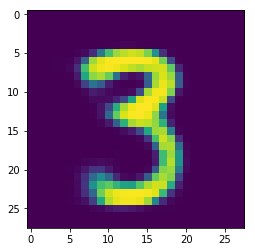

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  17



  0%|          | 1/214 [00:02<09:19,  2.63s/it]

[0 5 2 9 1 8 6 3 7 4 5 0 3 2 5 2 8 4 0 6 1 3 0 8 1 8 8 9 6 9 2 8 9 5 9 9 4
 0 3 4 1 3 8 9 9 4 9 7 3 9 3 9 9 3 8 1 5 6 9 7 0 9 7 8 5 2 6 9 6 9 6 3 7 4
 9 7 0 6 0 6 4 4 0 8 3 6 8 9 3 4 1 5 1 4 5 5 3 4 1 9 0 8 8 3 0 8 7 1 4 6 0
 6 3 3 9 0 3 9 4 0 1 4 9 5 6 3 5 6 6 5 9 2 8 5 7 3 0 2 8 8 4 6 4 8 9 1 3 6
 8 1 3 3 3 9 2 7 1 9 7 6 8 3 6 1 2 4 2 1 3 3 6 6 5 3 7 1 4 7 2 9 0 6 1 6 5
 6 4 2 3 9 8 9 0 3 3 0 4 3 2 2 4 8 2 4 1 4 9 1 6 1 1 7 1 2 6 5 2 3 1 4 7 1
 3 4 1 8 4 0 9 8 2 2 5 9 1 6 4 3 8 4 7 7 8 9 2 1 7 2 0 5 6 8 5 6 8 2]
[0 5 2 9 1 8 6 3 7 4 5 0 3 2 5 2 8 4 0 6 1 3 0 8 1 8 8 9 6 9 2 8 9 5 9 9 4
 0 3 4 1 3 8 9 9 4 9 7 3 9 3 9 9 3 8 1 5 6 9 7 0 9 7 8 5 2 6 9 6 9 6 3 7 4
 9 7 0 6 0 6 4 4 0 8 3 6 8 9 3 4 1 5 1 4 5 5 3 4 1 9 0 8 8 3 0 8 7 1 4 6 0
 6 3 3 9 0 3 9 4 0 1 4 9 5 6 3 5 6 6 5 9 2 8 5 7 3 0 2 8 8 4 6 4 8 9 1 3 6
 8 1 3 3 3 9 2 7 1 9 7 6 8 3 6 1 2 4 2 1 3 3 6 6 5 3 7 1 4 7 2 9 0 6 1 6 5
 6 4 2 3 9 8 9 0 3 3 0 4 3 2 2 4 8 2 4 1 4 9 1 6 1 1 7 1 2 6 5 2 3 1 4 7 1
 3 4 1 8 4 0 9 8 2 2 5 9 1 6 4


  1%|          | 2/214 [00:05<09:20,  2.65s/it]

[8 6 9 8 4 3 0 9 9 4 9 3 2 3 2 2 3 9 1 8 3 8 1 8 1 1 6 6 5 7 7 4 6 5 7 1 4
 7 1 9 7 9 0 9 9 1 7 2 7 0 6 6 1 8 6 9 3 7 3 1 5 1 2 6 4 6 8 6 6 7 5 9 3 5
 5 6 6 1 7 8 5 1 4 5 1 3 2 8 0 1 2 0 3 2 4 4 3 6 9 4 1 4 1 6 9 8 4 9 2 0 2
 3 5 7 2 8 6 4 0 5 2 3 3 9 7 4 8 2 7 4 3 4 0 6 2 7 3 6 7 7 2 3 1 1 1 9 3 9
 3 9 8 9 1 4 7 2 2 2 6 2 7 1 9 6 9 6 1 6 0 6 0 3 7 9 5 4 8 9 3 5 6 3 5 2 9
 3 2 3 8 2 1 4 4 0 5 2 5 5 5 6 7 3 8 6 2 4 2 1 3 9 7 8 1 6 0 7 2 7 9 6 4 3
 2 1 7 9 1 2 3 6 7 2 9 9 0 5 9 4 0 5 6 8 6 7 8 2 5 8 3 6 6 5 5 7 7 2]
[8 6 9 8 4 3 0 9 9 4 9 3 2 3 2 2 3 9 1 8 3 8 1 8 1 1 6 6 5 7 7 4 6 5 7 1 4
 7 1 9 7 9 0 9 9 1 7 2 7 0 6 6 1 8 6 9 3 7 3 1 5 1 2 6 4 6 8 6 6 7 5 9 3 5
 5 6 6 1 7 8 5 1 4 5 1 3 2 8 0 1 2 0 3 2 4 4 3 6 9 4 1 4 1 6 9 8 4 9 2 0 2
 3 5 7 2 8 6 4 0 5 2 3 3 9 7 4 8 2 7 4 3 4 0 6 2 7 3 6 7 7 2 3 1 1 1 9 3 9
 3 9 8 9 1 4 7 2 2 2 6 2 7 1 9 6 9 6 1 6 0 6 0 3 7 9 5 4 8 9 3 5 6 3 5 2 9
 3 2 3 8 2 1 4 4 0 5 2 5 5 5 6 7 3 8 6 2 4 2 1 3 9 7 8 1 6 0 7 2 7 9 6 4 3
 2 1 7 9 1 2 3 6 7 2 9 9 0 5 9


  1%|▏         | 3/214 [00:07<09:15,  2.63s/it]

[4 6 0 0 9 8 5 7 5 8 1 1 7 1 3 1 8 2 4 3 5 7 2 1 3 7 4 0 9 7 9 4 4 1 0 3 7
 7 2 7 4 8 7 9 1 6 6 2 6 1 5 2 7 5 4 7 7 7 0 9 6 9 9 5 6 1 5 3 5 3 6 8 7 9
 1 4 5 6 7 7 6 2 3 6 9 2 2 9 0 6 1 0 8 2 7 9 9 9 1 0 8 7 4 2 8 8 7 4 1 0 0
 7 9 7 1 6 2 0 1 1 6 3 0 8 7 5 0 9 3 6 1 2 3 5 7 0 8 1 3 3 6 8 9 1 6 4 1 1
 7 4 3 3 2 7 2 6 9 7 1 6 6 5 0 1 3 7 4 0 7 6 3 4 7 8 3 6 7 5 4 4 4 3 1 7 2
 3 2 3 4 3 0 3 8 0 3 5 8 3 6 8 7 2 0 4 4 9 0 8 1 1 0 6 3 1 0 9 4 5 7 5 7 6
 7 2 8 5 4 4 2 3 7 3 4 3 4 7 7 9 1 6 7 7 1 2 9 6 7 2 0 7 5 5 6 0 1 1]
[4 6 0 0 9 8 5 7 5 8 1 1 7 1 3 1 8 2 4 3 5 7 2 1 3 7 4 0 9 7 9 4 4 1 0 3 7
 7 2 7 4 8 7 9 1 6 6 2 6 1 5 2 7 5 4 7 7 7 0 9 6 9 9 5 6 1 5 3 5 3 6 8 7 9
 1 4 5 6 7 7 6 2 3 6 9 2 2 9 0 6 1 0 8 2 7 9 9 9 1 0 8 7 4 2 8 8 7 4 1 0 0
 7 9 7 1 6 2 0 1 1 6 3 0 8 7 5 0 9 3 6 1 2 3 5 7 0 8 1 3 3 6 8 9 1 6 4 1 1
 7 4 3 3 2 7 2 6 9 7 1 6 6 5 0 1 3 7 4 0 7 6 3 4 7 8 3 6 7 5 4 4 4 3 1 7 2
 3 2 3 4 3 0 3 8 0 3 5 8 3 6 8 7 2 0 4 4 9 0 8 1 1 0 6 3 1 0 9 4 5 7 5 7 6
 7 2 8 5 4 4 2 3 7 3 4 3 4 7 7


  2%|▏         | 4/214 [00:10<09:11,  2.63s/it]

[4 1 7 5 1 2 8 8 6 2 3 4 1 6 7 7 4 5 6 8 3 0 7 2 4 8 8 2 3 2 0 0 7 3 3 3 0
 4 3 3 2 0 3 2 5 3 0 6 4 0 0 3 6 0 4 7 8 4 2 2 2 7 8 5 6 9 1 9 2 9 8 3 2 5
 8 2 7 0 5 0 8 4 0 8 0 0 9 2 0 8 2 5 1 9 0 6 9 8 5 5 0 6 2 8 4 4 5 2 3 8 5
 6 2 1 9 9 3 8 4 6 2 6 4 9 0 1 4 2 9 1 6 0 0 6 1 2 7 0 1 5 9 4 7 2 0 2 5 5
 2 9 5 7 6 1 1 6 0 4 5 5 5 8 0 9 1 2 9 9 6 6 8 1 0 7 4 5 1 6 1 7 3 4 0 3 1
 3 7 0 7 9 4 7 6 7 8 3 5 0 5 3 5 4 2 2 9 2 1 0 0 2 3 5 5 4 3 2 4 7 6 2 1 2
 8 0 0 4 0 8 9 5 1 0 3 6 8 9 2 9 0 9 7 5 0 7 1 4 3 7 7 2 1 3 1 4 4 9]
[4 1 7 5 1 2 8 8 6 2 3 4 1 6 7 7 4 5 6 8 3 0 7 2 4 8 8 2 3 2 0 0 7 3 3 3 0
 4 3 3 2 0 3 2 5 3 0 6 4 0 0 3 6 0 4 7 8 4 2 2 2 7 8 5 6 9 1 9 2 9 8 3 2 5
 8 2 7 0 5 0 8 4 0 8 0 0 9 2 0 8 2 5 1 9 0 6 9 8 5 5 0 6 2 8 4 4 5 2 3 8 5
 6 2 1 9 9 3 8 4 6 2 6 4 9 0 1 4 2 9 1 6 0 0 6 1 2 7 0 1 5 9 4 7 2 0 2 5 5
 2 9 5 7 6 1 1 6 0 4 5 5 5 8 0 9 1 2 9 9 6 6 8 1 0 7 4 5 1 6 1 7 3 4 0 3 1
 3 7 0 7 9 4 7 6 7 8 3 5 0 5 3 5 4 2 2 9 2 1 0 0 2 3 5 5 4 3 2 4 7 6 2 1 2
 8 0 0 4 0 8 9 5 1 0 3 6 8 9 2


  2%|▏         | 5/214 [00:13<09:09,  2.63s/it]

[5 8 6 6 6 4 9 3 8 9 8 6 6 9 3 8 5 1 5 4 1 6 8 8 8 4 7 2 9 2 1 3 2 7 7 2 7
 0 4 7 1 0 1 7 6 4 4 5 2 8 9 9 1 4 5 9 4 5 3 3 6 5 8 8 9 0 2 3 3 4 6 6 9 2
 6 0 4 0 1 4 1 6 7 7 4 8 8 8 8 2 7 8 1 0 3 8 5 0 0 0 9 1 1 8 8 8 7 1 2 8 3
 8 2 9 7 7 7 5 6 0 6 5 1 6 3 5 3 5 0 1 9 6 4 3 0 1 7 0 1 1 8 0 0 5 0 4 5 8
 6 4 8 3 0 6 8 7 3 8 4 5 2 1 9 2 5 1 8 5 8 3 3 0 9 2 6 6 6 2 9 9 3 1 2 5 2
 4 0 7 5 4 0 3 3 6 4 0 0 3 6 3 0 0 1 2 2 5 4 2 7 9 1 4 7 5 0 3 9 1 3 4 0 2
 2 8 3 6 3 2 3 3 3 5 8 5 3 1 6 3 3 7 6 5 4 8 5 3 9 7 2 8 0 0 5 0 7 6]
[5 8 6 6 6 4 9 3 8 9 8 6 6 9 3 8 5 1 5 4 1 6 8 8 8 4 7 2 9 2 1 3 2 7 7 2 7
 0 4 7 1 0 1 7 6 4 4 5 2 8 9 9 1 4 5 9 4 5 3 3 6 5 8 8 9 0 2 3 3 4 6 6 9 2
 6 0 4 0 1 4 1 6 7 7 4 8 8 8 8 2 7 8 1 0 3 8 5 0 0 0 9 1 1 8 8 8 7 1 2 8 3
 8 2 9 7 7 7 5 6 0 6 5 1 6 3 5 3 5 0 1 9 6 4 3 0 1 7 0 1 1 8 0 0 5 0 4 5 8
 6 4 8 3 0 6 8 7 3 8 4 5 2 1 9 2 5 1 8 5 8 3 3 0 9 2 6 6 6 2 9 9 3 1 2 5 2
 4 0 7 5 4 0 3 3 6 4 0 0 3 6 3 0 0 1 2 2 5 4 2 7 9 1 4 7 5 0 3 9 1 3 4 0 2
 2 8 3 6 3 2 3 3 3 5 8 5 3 1 6


  3%|▎         | 6/214 [00:15<09:08,  2.64s/it]

[8 2 3 2 4 3 4 7 8 0 7 0 8 0 9 5 6 8 8 2 7 1 8 6 5 4 4 0 4 0 8 5 0 7 2 0 0
 3 0 2 6 4 2 0 4 3 6 3 8 4 1 8 7 2 2 2 0 1 9 9 7 5 1 0 1 5 9 3 6 2 2 7 8 4
 8 7 9 4 8 8 2 5 7 5 5 7 8 1 0 7 3 8 7 3 1 0 3 4 3 2 6 1 5 6 2 8 9 6 0 5 7
 9 4 0 1 9 1 8 4 7 1 8 1 7 2 9 0 4 5 9 3 3 5 4 4 7 0 0 5 2 4 9 2 7 6 6 6 7
 8 6 1 5 9 6 2 9 1 4 5 9 5 4 6 4 0 7 5 4 4 0 7 7 7 7 8 2 9 6 6 8 0 9 1 6 1
 6 3 1 2 1 8 6 3 5 0 9 0 1 8 6 5 3 1 8 5 9 3 4 1 6 7 4 8 7 7 3 0 7 9 7 1 2
 1 9 7 5 7 2 2 8 4 4 5 1 6 1 6 4 7 6 1 6 1 6 4 9 7 8 1 3 3 2 0 9 2 7]
[8 2 3 2 4 3 4 7 8 0 7 0 8 0 9 5 6 8 8 2 7 1 8 6 5 4 4 0 4 0 8 5 0 7 2 0 0
 3 0 2 6 4 2 0 4 3 6 3 8 4 1 8 7 2 2 2 0 1 9 9 7 5 1 0 1 5 9 3 6 2 2 7 8 4
 8 7 9 4 8 8 2 5 7 5 5 7 8 1 0 7 3 8 7 3 1 0 3 4 3 2 6 1 5 6 2 8 9 6 0 5 7
 9 4 0 1 9 1 8 4 7 1 8 1 7 2 9 0 4 5 9 3 3 5 4 4 7 0 0 5 2 4 9 2 7 6 6 6 7
 8 6 1 5 9 6 2 9 1 4 5 9 5 4 6 4 0 7 5 4 4 0 7 7 7 7 8 2 9 6 6 8 0 9 1 6 1
 6 3 1 2 1 8 6 3 5 0 9 0 1 8 6 5 3 1 8 5 9 3 4 1 6 7 4 8 7 7 3 0 7 9 7 1 2
 1 9 7 5 7 2 2 8 4 4 5 1 6 1 6


  3%|▎         | 7/214 [00:18<09:07,  2.64s/it]

[0 0 4 2 7 0 6 7 3 3 8 1 1 8 5 7 9 1 0 0 6 3 1 4 0 4 6 2 7 4 1 7 2 3 3 2 2
 1 8 8 9 5 4 5 2 1 2 2 4 9 6 9 1 3 9 4 7 1 6 7 6 3 2 0 0 0 6 5 2 5 1 6 7 7
 2 7 4 7 5 2 7 4 0 0 4 5 0 1 3 8 7 8 4 4 7 2 0 3 3 3 2 1 3 1 7 6 7 1 8 2 0
 5 7 1 1 2 1 4 9 3 8 1 1 3 9 3 7 4 6 3 7 6 1 0 6 1 4 2 6 9 9 8 5 1 9 8 7 7
 8 5 8 2 9 4 1 5 8 8 5 4 2 5 7 0 3 1 9 0 4 0 6 0 2 8 4 9 9 8 2 8 0 1 8 6 6
 6 2 8 7 8 9 9 8 1 3 3 0 6 3 6 7 8 0 2 8 9 5 4 0 5 1 3 2 6 7 7 5 5 4 4 4 3
 7 4 9 3 9 1 5 6 0 2 1 4 5 3 8 5 4 1 1 3 5 0 1 6 4 3 1 5 7 6 1 9 3 2]
[0 0 4 2 7 0 6 7 3 3 8 1 1 8 5 7 9 1 0 0 6 3 1 4 0 4 6 2 7 4 1 7 2 3 3 2 2
 1 8 8 9 5 4 5 2 1 2 2 4 9 6 9 1 3 9 4 7 1 6 7 6 3 2 0 0 0 6 5 2 5 1 6 7 7
 2 7 4 7 5 2 7 4 0 0 4 5 0 1 3 8 7 8 4 4 7 2 0 3 3 3 2 1 3 1 7 6 7 1 8 2 0
 5 7 1 1 2 1 4 9 3 8 1 1 3 9 3 7 4 6 3 7 6 1 0 6 1 4 2 6 9 9 8 5 1 9 8 7 7
 8 5 8 2 9 4 1 5 8 8 5 4 2 5 7 0 3 1 9 0 4 0 6 0 2 8 4 9 9 8 2 8 0 1 8 6 6
 6 2 8 7 8 9 9 8 1 3 3 0 6 3 6 7 8 0 2 8 9 5 4 0 5 1 3 2 6 7 7 5 5 4 4 4 3
 7 4 9 3 9 1 5 6 0 2 1 4 5 3 8


  4%|▎         | 8/214 [00:21<09:03,  2.64s/it]

[3 9 0 1 8 1 8 2 4 7 5 4 7 9 9 7 7 4 4 2 8 1 0 8 9 8 1 7 1 3 3 9 3 8 1 2 7
 3 1 4 4 5 7 1 6 2 4 7 2 7 0 7 7 6 7 8 8 8 9 9 5 9 8 8 6 2 7 0 5 0 1 7 5 9
 3 0 0 1 4 3 5 7 2 4 8 7 3 0 5 9 2 1 0 0 5 3 9 4 9 7 8 4 9 5 5 1 6 6 7 0 3
 1 7 3 6 8 0 6 4 2 0 8 9 9 3 2 8 5 1 0 3 6 0 1 1 6 7 0 0 6 8 1 8 1 7 1 3 3
 2 9 1 3 0 0 0 7 1 7 9 4 0 5 7 1 9 8 5 1 7 7 2 7 6 2 6 0 3 4 7 8 4 5 7 2 9
 0 9 0 5 1 1 6 6 6 8 9 8 5 8 8 4 6 0 0 6 5 7 3 2 0 7 1 7 6 7 6 6 1 0 0 1 3
 4 6 4 1 2 2 4 9 9 6 4 8 5 0 9 8 1 4 9 0 4 3 6 4 3 8 6 0 9 0 2 7 4 7]
[3 9 0 1 8 1 8 2 4 7 5 4 7 9 9 7 7 4 4 2 8 1 0 8 9 8 1 7 1 3 3 9 3 8 1 2 7
 3 1 4 4 5 7 1 6 2 4 7 2 7 0 7 7 6 7 8 8 8 9 9 5 9 8 8 6 2 7 0 5 0 1 7 5 9
 3 0 0 1 4 3 5 7 2 4 8 7 3 0 5 9 2 1 0 0 5 3 9 4 9 7 8 4 9 5 5 1 6 6 7 0 3
 1 7 3 6 8 0 6 4 2 0 8 9 9 3 2 8 5 1 0 3 6 0 1 1 6 7 0 0 6 8 1 8 1 7 1 3 3
 2 9 1 3 0 0 0 7 1 7 9 4 0 5 7 1 9 8 5 1 7 7 2 7 6 2 6 0 3 4 7 8 4 5 7 2 9
 0 9 0 5 1 1 6 6 6 8 9 8 5 8 8 4 6 0 0 6 5 7 3 2 0 7 1 7 6 7 6 6 1 0 0 1 3
 4 6 4 1 2 2 4 9 9 6 4 8 5 0 9


  4%|▍         | 9/214 [00:23<09:00,  2.64s/it]

[4 8 0 8 6 0 5 1 3 4 5 8 6 7 5 6 6 8 1 1 7 7 0 4 8 1 4 0 3 4 3 9 9 7 1 6 6
 7 3 8 4 4 2 5 7 7 3 3 7 6 5 4 5 0 8 6 0 4 9 0 8 0 8 1 9 5 8 5 6 7 2 5 7 0
 1 9 5 3 6 8 8 8 1 9 2 1 3 0 2 1 7 9 6 6 2 8 7 7 6 2 3 2 8 0 9 5 3 7 9 1 2
 9 6 8 8 1 5 1 2 9 5 2 9 1 5 1 3 6 7 7 0 1 8 3 2 8 3 5 9 7 1 4 2 9 1 1 1 5
 1 1 3 1 3 9 6 7 5 4 3 3 9 5 5 6 2 3 3 7 2 5 1 8 8 5 0 4 7 7 0 6 5 8 1 1 2
 1 5 1 4 0 5 0 4 6 5 7 0 5 4 5 8 8 5 1 6 3 2 4 7 5 8 3 0 1 9 9 0 4 8 8 3 1
 0 8 9 8 1 4 1 4 2 5 2 5 4 9 6 6 7 9 9 2 9 8 3 8 5 9 0 4 2 4 5 8 7 8]
[4 8 0 8 6 0 5 1 3 4 5 8 6 7 5 6 6 8 1 1 7 7 0 4 8 1 4 0 3 4 3 9 9 7 1 6 6
 7 3 8 4 4 2 5 7 7 3 3 7 6 5 4 5 0 8 6 0 4 9 0 8 0 8 1 9 5 8 5 6 7 2 5 7 0
 1 9 5 3 6 8 8 8 1 9 2 1 3 0 2 1 7 9 6 6 2 8 7 7 6 2 3 2 8 0 9 5 3 7 9 1 2
 9 6 8 8 1 5 1 2 9 5 2 9 1 5 1 3 6 7 7 0 1 8 3 2 8 3 5 9 7 1 4 2 9 1 1 1 5
 1 1 3 1 3 9 6 7 5 4 3 3 9 5 5 6 2 3 3 7 2 5 1 8 8 5 0 4 7 7 0 6 5 8 1 1 2
 1 5 1 4 0 5 0 4 6 5 7 0 5 4 5 8 8 5 1 6 3 2 4 7 5 8 3 0 1 9 9 0 4 8 8 3 1
 0 8 9 8 1 4 1 4 2 5 2 5 4 9 6


  5%|▍         | 10/214 [00:26<08:58,  2.64s/it]

[6 8 1 9 6 8 3 3 1 2 7 1 2 9 3 9 7 9 0 9 5 2 7 5 2 9 8 8 0 1 7 2 7 1 3 6 7
 2 4 7 4 2 7 6 6 6 4 0 8 4 7 6 4 9 7 9 2 1 3 1 0 0 6 6 8 0 2 0 0 5 7 3 2 0
 3 5 3 8 6 6 3 0 3 6 2 4 4 3 4 3 4 1 7 5 2 8 6 9 0 1 1 2 6 4 9 5 5 2 3 2 5
 3 5 7 1 0 9 8 7 8 7 2 1 5 6 3 3 7 0 6 6 2 8 8 0 4 0 7 1 1 5 7 2 6 4 1 5 0
 1 0 7 4 5 3 0 4 9 2 7 9 6 1 9 4 1 5 2 2 3 2 0 1 3 5 2 2 9 0 6 9 1 8 5 8 6
 3 5 0 8 1 5 9 8 1 1 5 9 0 8 8 7 1 1 8 2 7 6 1 4 7 6 4 4 0 7 2 8 0 4 9 5 8
 2 0 0 8 2 2 3 9 3 7 4 9 6 9 3 2 3 1 8 9 9 2 1 8 9 1 6 0 1 5 4 9 5 3]
[6 8 1 9 6 8 3 3 1 2 7 1 2 9 3 9 7 9 0 9 5 2 7 5 2 9 8 8 0 1 7 2 7 1 3 6 7
 2 4 7 4 2 7 6 6 6 4 0 8 4 7 6 4 9 7 9 2 1 3 1 0 0 6 6 8 0 2 0 0 5 7 3 2 0
 3 5 3 8 6 6 3 0 3 6 2 4 4 3 4 3 4 1 7 5 2 8 6 9 0 1 1 2 6 4 9 5 5 2 3 2 5
 3 5 7 1 0 9 8 7 8 7 2 1 5 6 3 3 7 0 6 6 2 8 8 0 4 0 7 1 1 5 7 2 6 4 1 5 0
 1 0 7 4 5 3 0 4 9 2 7 9 6 1 9 4 1 5 2 2 3 2 0 1 3 5 2 2 9 0 6 9 1 8 5 8 6
 3 5 0 8 1 5 9 8 1 1 5 9 0 8 8 7 1 1 8 2 7 6 1 4 7 6 4 4 0 7 2 8 0 4 9 5 8
 2 0 0 8 2 2 3 9 3 7 4 9 6 9 3


  5%|▌         | 11/214 [00:29<08:56,  2.64s/it]

[0 7 7 8 4 0 6 1 1 4 2 5 6 1 3 3 1 7 9 5 7 6 0 1 2 5 2 8 8 4 2 7 1 9 8 3 6
 9 9 5 5 0 7 1 4 9 3 8 9 2 0 8 6 9 2 2 0 2 2 7 7 9 8 3 8 2 9 0 0 8 6 3 2 2
 8 1 5 8 1 7 4 0 4 3 3 0 7 8 7 6 5 6 6 4 1 3 2 3 7 5 5 3 1 6 0 1 5 1 0 9 6
 0 3 2 6 3 5 8 2 1 6 6 6 0 6 6 8 0 7 7 4 3 9 6 7 3 8 6 4 9 1 1 8 8 9 1 5 2
 7 9 9 1 6 8 7 5 4 1 2 8 7 2 3 3 4 0 8 0 2 1 9 0 9 4 1 2 6 8 6 8 3 3 8 3 2
 3 5 2 1 0 0 0 7 7 9 0 7 7 2 7 9 2 7 0 1 4 1 1 8 3 9 6 1 7 9 6 1 7 8 9 0 7
 6 3 7 4 6 2 2 7 8 5 2 2 3 6 2 6 2 5 6 4 7 4 6 8 7 4 4 7 6 3 3 0 8 5]
[0 7 7 8 4 0 6 1 1 4 2 5 6 1 3 3 1 7 9 5 7 6 0 1 2 5 2 8 8 4 2 7 1 9 8 3 6
 9 9 5 5 0 7 1 4 9 3 8 3 2 0 8 6 9 2 2 0 2 2 7 7 9 8 3 8 2 9 0 0 8 6 3 2 2
 8 1 5 8 1 7 4 0 4 3 3 0 7 8 7 6 5 6 6 4 1 3 2 3 7 5 5 3 1 6 0 1 5 1 0 9 6
 0 3 2 6 3 5 8 2 1 6 6 6 0 6 6 8 0 7 7 4 3 9 6 7 3 8 6 4 9 1 1 8 8 9 1 5 2
 7 9 9 1 6 8 7 5 4 1 2 8 7 2 3 3 4 0 8 0 2 1 9 0 9 4 1 2 6 8 6 8 3 3 8 3 2
 3 5 2 1 0 0 0 7 7 9 0 7 7 2 7 9 2 7 0 1 4 1 1 8 3 9 6 1 7 9 6 1 7 8 9 0 7
 6 3 7 4 6 2 2 7 8 5 2 2 3 6 2


  6%|▌         | 12/214 [00:31<08:54,  2.64s/it]

[1 4 1 1 9 5 3 5 3 2 3 9 3 2 2 1 6 5 7 0 6 5 6 3 4 0 6 5 7 3 6 5 6 9 9 1 0
 1 9 9 7 4 3 5 5 5 9 1 1 0 4 4 6 2 5 6 6 8 6 7 2 5 4 6 6 7 6 0 9 2 6 5 3 9
 6 8 9 5 2 9 6 4 2 6 7 2 9 9 9 7 6 1 7 0 7 0 8 1 4 1 9 2 8 4 4 2 6 6 6 8 1
 4 0 9 3 9 7 5 0 4 0 6 3 2 1 1 9 2 4 9 9 4 1 7 7 0 0 5 7 7 2 9 4 8 1 8 4 7
 5 4 7 1 3 2 8 7 4 0 8 4 3 6 3 5 5 3 7 9 8 1 4 4 3 0 0 5 6 3 0 3 1 3 4 6 6
 1 7 3 5 3 4 5 1 5 8 2 3 8 4 5 0 7 4 1 7 2 9 2 8 4 8 8 9 4 1 1 8 7 1 7 7 2
 8 1 0 9 1 7 9 6 2 5 4 5 3 2 7 6 5 1 8 4 8 1 6 0 0 8 5 7 1 6 7 6 9 3]
[1 4 1 1 9 5 3 5 3 2 3 9 3 2 2 1 6 5 7 0 6 5 6 3 4 0 6 5 7 3 6 5 6 9 9 1 0
 1 9 9 7 4 3 5 5 5 9 1 1 0 4 4 6 2 5 6 6 8 6 7 2 5 4 6 6 7 6 0 9 2 6 5 3 9
 6 8 9 5 2 9 6 4 2 6 7 2 9 9 9 7 6 1 7 0 7 0 8 1 4 1 9 2 8 4 4 2 6 6 6 8 1
 4 0 9 3 9 7 5 0 4 0 6 3 2 1 1 9 2 4 9 9 4 1 7 7 0 0 5 7 7 2 9 4 8 1 8 4 7
 5 4 7 1 3 2 8 7 4 0 8 4 3 6 3 5 5 3 7 9 8 1 4 4 3 0 0 5 6 3 0 3 1 3 4 6 6
 1 7 3 5 3 4 5 1 5 8 2 3 8 4 5 0 7 4 1 7 2 9 2 8 4 8 8 9 4 1 1 8 7 1 7 7 2
 8 1 0 9 1 7 9 6 2 5 4 5 3 2 7


  6%|▌         | 13/214 [00:34<08:52,  2.65s/it]

[3 3 8 9 1 3 1 9 8 2 2 5 1 6 2 5 1 9 7 9 2 9 7 4 7 9 0 5 9 1 4 0 2 3 7 6 0
 7 3 1 5 1 2 5 4 3 7 3 7 3 1 2 9 2 7 6 1 6 7 3 3 8 6 6 1 8 6 4 6 8 5 3 4 0
 3 7 1 7 4 1 8 5 2 3 9 1 6 6 5 9 8 9 1 6 0 3 8 7 5 0 9 2 0 2 0 3 3 2 4 0 3
 8 5 8 2 0 6 0 1 2 1 3 2 7 8 5 7 5 5 6 0 0 9 9 1 3 8 8 4 4 5 7 7 5 4 5 5 3
 7 9 0 5 7 6 4 9 1 1 0 9 7 3 6 1 2 4 8 7 9 8 1 6 9 6 9 6 3 3 6 7 5 0 5 1 0
 3 6 7 2 2 1 6 6 0 5 9 8 9 1 4 0 2 7 9 7 7 4 8 3 3 6 0 1 8 4 0 1 5 5 2 6 7
 9 2 9 1 0 5 5 5 2 0 6 6 8 8 4 7 0 5 7 6 6 2 9 3 7 0 5 0 9 7 3 9 5 2]
[3 3 8 9 1 3 1 9 8 2 2 5 1 6 2 5 1 9 7 9 2 9 7 4 7 9 0 5 9 1 4 0 2 3 7 6 0
 7 3 1 5 1 2 5 4 3 7 3 7 3 1 2 9 2 7 6 1 6 7 3 3 8 6 6 1 8 6 4 6 8 5 3 4 0
 3 7 1 7 4 1 8 5 2 3 9 1 6 6 5 9 8 9 1 6 0 3 8 7 5 0 9 2 0 2 0 3 3 2 4 0 3
 8 5 8 2 0 6 0 1 2 1 3 2 7 8 5 7 5 5 6 0 0 9 9 1 3 8 8 4 4 5 7 7 5 4 5 5 3
 7 9 0 5 7 6 4 9 1 1 0 9 7 3 6 1 2 4 8 7 9 8 1 6 9 6 9 6 3 3 6 7 5 0 5 1 0
 3 6 7 2 2 1 6 6 0 5 9 8 9 1 4 0 2 7 9 7 7 4 8 3 3 6 0 1 8 4 0 1 5 5 2 6 7
 9 2 9 1 0 5 5 5 2 0 6 6 8 8 4


  7%|▋         | 14/214 [00:36<08:47,  2.64s/it]

[7 3 2 3 8 4 9 0 2 3 7 0 3 0 9 1 9 9 0 5 4 4 4 6 0 1 7 7 1 7 0 2 5 2 7 4 6
 3 0 2 7 9 9 8 6 8 7 7 4 3 1 8 2 3 1 1 2 6 5 9 2 9 1 5 4 9 8 9 1 8 7 2 9 1
 6 3 3 8 6 5 1 6 3 2 4 7 9 3 5 5 2 7 7 3 0 0 2 1 5 0 6 6 9 0 9 8 4 2 6 0 0
 3 2 9 8 3 1 6 8 2 9 3 2 8 2 8 5 4 0 5 3 3 6 5 1 7 4 7 0 6 5 1 6 8 4 8 8 5
 6 1 7 8 3 1 5 9 5 4 4 2 5 3 1 3 1 5 5 4 2 4 1 1 6 1 4 7 9 2 9 4 1 5 0 7 7
 7 2 2 7 1 7 3 5 7 4 6 6 3 5 0 0 3 4 1 8 9 4 5 1 6 2 7 9 5 6 4 9 8 1 5 7 5
 5 8 8 5 4 7 0 0 5 4 3 4 5 7 3 5 0 3 8 2 3 6 2 8 6 1 6 9 8 2 3 5 6 4]
[7 3 2 3 8 4 9 0 2 3 7 0 3 0 9 1 9 9 0 5 4 4 4 6 0 1 7 7 1 7 0 2 5 2 7 4 6
 3 0 2 7 9 9 8 6 8 7 7 4 3 1 8 2 3 1 1 2 6 5 9 2 9 1 5 4 9 8 9 1 8 7 2 9 1
 6 3 3 8 6 5 1 6 3 2 4 7 9 3 5 5 2 7 7 3 0 0 2 1 5 0 6 6 9 0 9 8 4 2 6 0 0
 3 2 9 8 3 1 6 8 2 9 3 2 8 2 8 5 4 0 5 3 3 6 5 1 7 4 7 0 6 5 1 6 8 4 8 8 5
 6 1 7 8 3 1 5 9 5 4 4 2 5 3 1 3 1 5 5 4 2 4 1 1 6 1 4 7 9 2 9 4 1 5 0 7 7
 7 2 2 7 1 7 3 5 7 4 6 6 3 5 0 0 3 4 1 8 9 4 5 1 6 2 7 9 5 6 4 9 8 1 5 7 5
 5 8 8 5 4 7 0 0 5 4 3 4 5 7 3


  7%|▋         | 15/214 [00:39<08:38,  2.61s/it]

[0 9 3 9 9 8 7 2 5 6 9 6 4 1 1 7 2 5 2 5 6 5 6 0 4 4 6 9 7 1 2 9 3 6 1 4 7
 0 3 0 9 8 7 5 5 6 2 7 5 4 3 1 0 8 7 8 8 4 1 5 7 0 0 7 3 7 5 1 0 6 4 7 6 7
 8 1 8 9 1 7 0 0 5 3 0 7 5 7 3 9 7 1 1 3 8 7 4 1 7 8 3 4 2 5 0 3 6 3 2 6 0
 4 1 4 7 6 9 1 6 3 2 6 7 7 1 8 8 2 0 8 7 6 6 6 0 6 3 1 6 9 1 8 4 5 2 7 9 0
 6 6 8 7 6 3 0 9 8 2 6 4 4 7 2 8 6 9 2 0 7 6 6 8 1 3 5 2 4 5 3 6 2 0 1 7 0
 3 7 9 8 7 1 7 1 3 9 5 3 8 9 9 4 6 6 2 3 1 2 4 9 8 3 6 5 1 2 5 9 6 1 4 3 3
 8 6 7 4 6 9 2 7 8 7 1 8 4 9 4 9 1 9 7 0 1 1 7 4 4 4 3 5 0 9 3 5 5 3]
[0 9 3 9 9 8 7 2 5 6 9 6 4 1 1 7 2 5 2 5 6 5 6 0 4 4 6 9 7 1 2 9 3 6 1 4 7
 0 3 0 9 8 7 5 5 6 2 7 5 4 3 1 0 8 7 8 8 4 1 5 7 0 0 7 3 7 5 1 0 6 4 7 6 7
 8 1 8 9 1 7 0 0 5 3 0 7 5 7 3 9 7 1 1 3 8 7 4 1 7 8 3 4 2 5 0 3 6 3 2 6 0
 4 1 4 7 6 9 1 6 3 2 6 7 7 1 8 8 2 0 8 7 6 6 6 0 6 3 1 6 9 1 8 4 5 2 7 9 0
 6 6 8 7 6 3 0 9 8 2 6 4 4 7 2 8 6 9 2 0 7 6 6 8 1 3 5 2 4 5 3 6 2 0 1 7 0
 3 7 9 8 7 1 7 1 3 9 5 3 8 9 9 4 6 6 2 3 1 2 4 9 8 3 6 5 1 2 5 9 6 1 4 3 3
 8 6 7 4 6 9 2 7 8 7 1 8 4 9 4


  7%|▋         | 16/214 [00:41<08:31,  2.58s/it]

[4 6 5 1 9 5 6 8 3 6 8 9 7 7 9 1 0 5 5 1 6 3 6 5 0 8 7 7 3 6 1 3 2 1 5 2 9
 0 7 2 3 1 3 3 3 7 4 8 6 7 0 0 8 8 9 5 5 1 2 4 7 8 9 7 0 1 1 3 9 7 2 3 1 3
 2 4 2 1 8 9 6 9 5 5 3 7 8 4 7 5 9 2 3 6 8 0 2 3 6 7 0 1 1 5 4 7 5 5 0 8 7
 2 4 8 0 6 4 3 1 9 2 8 5 4 1 7 7 7 2 3 0 8 6 8 6 1 9 6 2 9 7 1 1 2 0 8 5 8
 1 6 5 3 9 9 3 5 0 8 8 0 4 2 4 8 9 0 6 5 1 0 1 3 8 2 7 8 5 8 6 8 7 3 3 5 4
 4 9 1 4 7 6 7 7 7 2 4 7 7 7 9 8 6 0 4 2 2 7 2 7 4 1 8 6 1 9 7 3 0 5 4 7 3
 9 8 5 9 1 9 0 2 1 3 4 6 2 7 6 1 0 8 6 7 6 1 7 4 4 9 4 1 8 9 9 3 2 6]
[4 6 5 1 9 5 6 8 3 6 8 9 7 7 9 1 0 5 5 1 6 3 6 5 0 8 7 7 3 6 1 3 2 1 5 2 9
 0 7 2 3 1 3 3 3 7 4 8 6 7 0 0 8 8 9 5 5 1 2 4 7 8 9 7 0 1 1 3 9 7 2 3 1 3
 2 4 2 1 8 9 6 9 5 5 3 7 8 4 7 5 9 2 3 6 8 0 2 3 6 7 0 1 1 5 4 7 5 5 0 8 7
 2 4 8 0 6 4 3 1 9 2 8 5 4 1 7 7 7 2 3 0 8 6 8 6 1 9 6 2 9 7 1 1 2 0 8 5 8
 1 6 5 3 9 9 3 5 0 8 8 0 4 2 4 8 9 0 6 5 1 0 1 3 8 2 7 8 5 8 6 8 7 3 3 5 4
 4 9 1 4 7 6 7 7 7 2 4 7 7 7 9 8 6 0 4 2 2 7 2 7 4 1 8 6 1 9 7 3 0 5 4 7 3
 9 8 5 9 1 9 0 2 1 3 4 6 2 7 6


  8%|▊         | 17/214 [00:43<08:23,  2.55s/it]

[1 2 0 7 5 6 9 4 7 9 8 3 1 4 0 9 8 7 2 2 1 5 4 9 6 9 5 1 5 0 9 3 2 2 9 5 2
 3 3 4 8 5 3 9 0 1 6 3 3 1 5 3 7 7 1 1 0 6 4 9 3 0 2 0 7 7 0 0 5 5 7 6 9 3
 9 3 1 5 8 6 0 3 1 3 1 0 8 3 7 2 2 4 0 2 5 9 0 1 1 4 5 3 4 1 1 0 6 0 4 0 3
 8 5 0 8 8 8 7 5 8 7 3 1 2 6 4 8 6 8 6 4 0 1 8 6 6 8 5 1 8 4 7 2 1 3 8 1 7
 5 3 8 5 4 8 1 6 7 0 9 8 7 2 5 3 7 3 9 8 9 4 1 4 1 7 2 0 2 3 5 8 8 2 3 3 2
 4 0 1 3 0 0 7 1 6 5 4 8 4 0 5 1 5 1 1 0 9 3 9 0 1 2 6 0 5 2 0 3 3 6 7 9 4
 4 9 8 1 4 3 1 7 7 7 9 3 6 2 4 5 8 3 4 7 1 0 1 7 0 4 4 1 9 8 6 7 3 7]
[1 2 0 7 5 6 9 4 7 9 8 3 1 4 0 9 8 7 2 2 1 5 4 9 6 9 5 1 5 0 9 3 2 2 9 5 2
 3 3 4 8 5 3 9 0 1 6 3 3 1 5 3 7 7 1 1 0 6 4 9 3 0 2 0 7 7 0 0 5 5 7 6 9 3
 9 3 1 5 8 6 0 3 1 3 1 0 8 3 7 2 2 4 0 2 5 9 0 1 1 4 5 3 4 1 1 0 6 0 4 0 3
 8 5 0 8 8 8 7 5 8 7 3 1 2 6 4 8 6 8 6 4 0 1 8 6 6 8 5 1 8 4 7 2 1 3 8 1 7
 5 3 8 5 4 8 1 6 7 0 9 8 7 2 5 3 7 3 9 8 9 4 1 4 1 7 2 0 2 3 5 8 8 2 3 3 2
 4 0 1 3 0 0 7 1 6 5 4 8 4 0 5 1 5 1 1 0 9 3 9 0 1 2 6 0 5 2 0 3 3 6 7 9 4
 4 9 8 1 4 3 1 7 7 7 9 3 6 2 4


  8%|▊         | 18/214 [00:45<08:16,  2.54s/it]

[1 7 6 6 9 7 5 6 3 0 9 5 0 5 5 1 8 8 4 2 8 0 2 4 3 7 2 5 3 9 9 6 6 7 4 7 1
 9 3 5 2 4 3 0 1 3 5 2 5 2 3 2 3 6 5 5 1 7 4 3 8 0 1 3 3 4 8 8 2 8 7 9 9 3
 7 3 7 9 8 4 3 8 0 2 9 3 4 0 6 2 1 9 9 2 5 6 2 9 4 6 0 6 3 4 9 2 9 5 4 0 1
 4 4 9 0 9 5 6 5 2 0 2 8 7 8 6 5 2 6 8 0 9 8 6 2 6 1 6 0 1 1 2 7 7 8 4 0 3
 7 9 8 1 8 3 5 7 2 2 1 7 6 9 3 4 9 3 4 6 4 7 3 4 7 6 9 2 7 3 3 7 5 1 1 5 0
 5 1 6 8 3 1 6 1 2 8 3 3 7 4 0 9 0 9 0 5 3 6 7 7 1 6 9 2 6 9 7 6 3 5 3 3 3
 5 6 4 7 3 2 8 2 5 2 7 1 8 0 2 7 7 9 2 0 7 2 6 6 3 9 4 8 3 1 4 2 3 3]
[1 7 6 6 9 7 5 6 3 0 9 5 0 5 5 1 8 8 4 2 8 0 2 4 3 7 2 5 3 9 9 6 6 7 4 7 1
 9 3 5 2 4 3 0 1 3 5 2 5 2 3 2 3 6 5 5 1 7 4 3 8 0 1 3 3 4 8 8 2 8 7 9 9 3
 7 3 7 9 8 4 3 8 0 2 9 3 4 0 6 2 1 9 9 2 5 6 2 9 4 6 0 6 3 4 9 2 9 5 4 0 1
 4 4 9 0 9 5 6 5 2 0 2 8 7 8 6 5 2 6 8 0 9 8 6 2 6 1 6 0 1 1 2 7 7 8 4 0 3
 7 9 8 1 8 3 5 7 2 2 1 7 6 9 3 4 9 3 4 6 4 7 3 4 7 6 9 2 7 3 3 7 5 1 1 5 0
 5 1 6 8 3 1 6 1 2 8 3 3 7 4 0 9 0 9 0 5 3 6 7 7 1 6 9 2 6 9 7 6 3 5 3 3 3
 5 6 4 7 3 2 8 2 5 2 7 1 8 0 2


  9%|▉         | 19/214 [00:47<08:09,  2.51s/it]

[9 5 8 1 9 9 4 5 5 4 6 5 2 2 1 2 9 7 3 3 1 7 4 2 0 1 9 8 9 8 3 0 1 5 5 4 0
 1 6 2 1 9 1 6 8 8 8 7 7 9 3 5 6 5 2 4 1 6 1 4 7 9 2 9 2 6 4 0 1 4 9 3 2 9
 6 2 6 5 6 7 9 3 4 5 5 7 7 3 8 8 9 6 3 2 9 1 4 7 8 9 1 8 3 5 6 1 5 2 7 9 8
 4 1 2 1 6 3 4 9 7 1 9 4 6 2 8 1 8 1 7 8 0 2 0 1 1 9 3 0 6 6 3 5 1 1 3 1 3
 1 8 6 0 9 2 8 9 2 6 7 3 5 8 8 5 6 6 0 5 9 1 6 2 8 4 6 3 7 4 6 4 1 7 0 6 0
 2 2 1 2 5 4 9 6 0 3 7 4 7 4 4 0 4 8 4 3 0 8 7 8 6 6 5 0 3 4 9 4 4 2 8 4 9
 8 0 2 7 4 7 9 1 1 4 2 7 8 1 4 5 0 6 6 2 3 0 1 1 9 9 3 8 3 0 5 1 0 5]
[9 5 8 1 9 9 4 5 5 4 6 5 2 2 1 2 9 7 3 3 1 7 4 2 0 1 9 8 9 8 3 0 1 5 5 4 0
 1 6 2 1 9 1 6 8 8 8 7 7 9 3 5 6 5 2 4 1 6 1 4 7 9 2 9 2 6 4 0 1 4 9 3 2 9
 6 2 6 5 6 7 9 3 4 5 5 7 7 3 8 8 9 6 3 2 9 1 4 7 8 9 1 8 3 5 6 1 5 2 7 9 8
 4 1 2 1 6 3 4 9 7 1 9 4 6 2 8 1 8 1 7 8 0 2 0 1 1 9 3 0 6 6 3 5 1 1 3 1 3
 1 8 6 0 9 2 8 9 2 6 7 3 5 8 8 5 6 6 0 5 9 1 6 2 8 4 6 3 7 4 6 4 1 7 0 6 0
 2 2 1 2 5 4 9 6 0 3 7 4 7 4 4 0 4 8 4 3 0 8 7 8 6 6 5 0 3 4 9 4 4 2 8 4 9
 8 0 2 7 4 7 9 1 1 4 2 7 8 1 4


  9%|▉         | 20/214 [00:49<08:03,  2.49s/it]

[8 4 9 8 6 9 8 2 9 1 5 1 4 5 5 5 9 3 7 5 6 4 9 5 7 0 1 9 1 1 8 2 2 0 9 4 3
 1 6 8 6 3 8 5 6 0 0 4 0 4 4 0 2 7 6 5 3 1 0 2 1 7 3 5 3 4 2 4 1 4 5 3 9 7
 0 4 2 6 3 3 6 3 6 7 3 6 9 4 5 8 2 9 6 8 8 6 2 7 9 4 8 6 7 1 2 2 2 7 4 2 0
 6 8 1 3 6 1 7 9 8 8 6 5 0 1 7 0 1 0 7 1 2 5 2 4 4 7 5 3 0 2 7 5 9 9 3 0 4
 9 2 8 4 3 8 1 9 1 7 3 3 7 1 9 6 7 1 8 1 0 1 3 1 5 6 6 8 4 2 6 9 9 2 3 3 0
 1 1 2 7 3 0 8 1 5 4 8 4 3 2 5 2 7 0 1 1 9 8 3 0 1 7 1 9 4 2 0 9 6 4 1 4 0
 7 7 0 5 7 1 9 9 2 0 9 1 1 8 6 4 8 8 8 7 9 7 7 4 1 6 0 5 7 6 7 7 7 9]
[8 4 9 8 6 9 8 2 9 1 5 1 4 5 5 5 9 3 7 5 6 4 9 5 7 0 1 9 1 1 8 2 2 0 9 4 3
 1 6 8 6 3 8 5 6 0 0 4 0 4 4 0 2 7 6 5 3 1 0 2 1 7 3 5 3 4 2 4 1 4 5 3 9 7
 0 4 2 6 3 3 6 3 6 7 3 6 9 4 5 8 2 9 6 8 8 6 2 7 9 4 8 6 7 1 2 2 2 7 4 2 0
 6 8 1 3 6 1 7 9 8 8 6 5 0 1 7 0 1 0 7 1 2 5 2 4 4 7 5 3 0 2 7 5 9 9 3 0 4
 9 2 8 4 3 8 1 9 1 7 3 3 7 1 9 6 7 1 8 1 0 1 3 1 5 6 6 8 4 2 6 9 9 2 3 3 0
 1 1 2 7 3 0 8 1 5 4 8 4 3 2 5 2 7 0 1 1 9 8 3 0 1 7 1 9 4 2 0 9 6 4 1 4 0
 7 7 0 5 7 1 9 9 2 0 9 1 1 8 6


 10%|▉         | 21/214 [00:52<07:58,  2.48s/it]

[9 9 1 8 0 1 1 3 8 5 4 1 5 9 0 8 3 2 6 9 5 2 5 8 1 3 5 6 7 1 4 0 4 9 8 6 4
 4 7 4 8 7 3 1 3 9 4 9 7 7 4 2 5 3 7 6 0 2 0 8 8 9 0 4 9 5 2 4 4 4 9 6 8 0
 8 1 5 2 4 3 6 4 4 8 9 2 7 0 1 7 8 5 3 8 0 9 6 9 8 7 5 8 5 1 2 2 8 5 7 5 6
 2 8 4 5 1 0 1 5 9 6 9 7 4 9 2 4 2 9 9 0 6 3 6 6 4 6 7 6 0 7 3 2 6 8 6 6 7
 1 7 0 3 9 5 5 5 6 4 6 9 2 5 2 5 0 0 7 2 5 3 1 5 3 5 8 1 5 6 6 6 3 6 0 2 3
 8 7 7 8 7 5 4 7 8 7 2 2 4 8 2 1 5 6 0 1 7 3 2 5 2 7 2 1 4 1 1 3 0 2 6 8 0
 0 3 1 9 8 7 4 2 2 5 9 7 5 0 8 7 6 9 5 3 9 4 8 7 6 7 7 7 0 7 3 2 8 1]
[9 9 1 8 0 1 1 3 8 5 4 1 5 9 0 8 3 2 6 9 5 2 5 8 1 3 5 6 7 1 4 0 4 9 8 6 4
 4 7 4 8 7 3 1 3 9 4 9 7 7 4 2 5 3 7 6 0 2 0 8 8 9 0 4 9 5 2 4 4 4 9 6 8 0
 8 1 5 2 4 3 6 4 4 8 9 2 7 0 1 7 8 5 3 8 0 9 6 9 8 7 5 8 5 1 2 2 8 5 7 5 6
 2 8 4 5 1 0 1 5 9 6 9 7 4 9 2 4 2 9 9 0 6 3 6 6 4 6 7 6 0 7 3 2 6 8 6 6 7
 1 7 0 3 9 5 5 5 6 4 6 9 2 5 2 5 0 0 7 2 5 3 1 5 3 5 8 1 5 6 6 6 3 6 0 2 3
 8 7 7 8 7 5 4 7 8 7 2 2 4 8 2 1 5 6 0 1 7 3 2 5 2 7 2 1 4 1 1 3 0 2 6 8 0
 0 3 1 9 8 7 4 2 2 5 9 7 5 0 8


 10%|█         | 22/214 [00:54<07:52,  2.46s/it]

[0 6 9 3 6 0 6 6 5 9 6 6 6 1 0 4 8 7 0 2 5 3 2 7 1 1 8 1 9 9 6 7 8 2 5 4 6
 2 2 1 2 9 1 8 6 0 3 7 1 8 0 6 7 3 5 9 0 1 9 0 3 9 7 2 0 0 0 9 7 6 1 4 0 0
 2 7 5 0 9 4 6 6 4 3 5 2 5 4 2 0 1 3 7 6 9 5 9 1 2 9 9 0 6 0 8 1 6 5 6 6 5
 4 4 4 5 4 9 3 7 0 3 4 9 5 5 9 2 7 2 9 1 6 4 7 4 8 1 8 3 3 5 9 7 9 7 9 5 5
 5 9 7 1 4 9 8 4 9 1 9 1 6 8 8 2 0 9 2 3 1 2 3 6 9 1 6 4 2 3 5 1 9 0 2 2 5
 5 4 0 7 1 2 1 8 9 9 8 4 8 3 5 6 1 1 9 7 3 1 3 3 0 7 4 8 9 2 4 5 4 1 1 4 2
 0 3 9 9 2 4 0 2 0 9 7 6 6 8 8 7 9 6 5 6 3 3 9 8 8 2 4 3 3 2 5 4 3 8]
[0 6 9 3 6 0 6 6 5 9 6 6 6 1 0 4 8 7 0 2 5 3 2 7 1 1 8 1 9 9 6 7 8 2 5 4 6
 2 2 1 2 9 1 8 6 0 3 7 1 8 0 6 7 3 5 9 0 1 9 0 3 9 7 2 0 0 0 9 7 6 1 4 0 0
 2 7 5 0 9 4 6 6 4 3 5 2 5 4 2 0 1 3 7 6 9 5 9 1 2 9 9 0 6 0 8 1 6 5 6 6 5
 4 4 4 5 4 9 3 7 0 3 4 9 5 5 9 2 7 2 9 1 6 4 7 4 8 1 8 3 3 5 9 7 9 7 9 5 5
 5 9 7 1 4 9 8 4 9 1 9 1 6 8 8 2 0 9 2 3 1 2 3 6 9 1 6 4 2 3 5 1 9 0 2 2 5
 5 4 0 7 1 2 1 8 9 9 8 4 8 3 5 6 1 1 9 7 3 1 3 3 0 7 4 8 9 2 4 5 4 1 1 4 2
 0 3 9 9 2 4 0 2 0 9 7 6 6 8 8


 11%|█         | 23/214 [00:56<07:47,  2.45s/it]

[8 9 0 2 3 6 9 8 7 2 0 8 2 7 9 0 1 9 4 6 3 6 2 3 3 9 5 9 8 1 5 5 2 1 2 1 3
 8 2 9 6 8 8 9 7 9 7 2 8 0 4 8 2 1 1 7 2 2 3 9 6 0 1 8 0 5 8 6 6 4 3 1 7 0
 1 8 5 6 2 9 7 3 4 1 9 3 1 7 0 5 8 3 6 4 1 8 9 6 1 2 3 3 7 6 5 3 5 0 2 9 4
 6 6 3 4 4 1 0 7 2 3 5 0 4 1 2 2 6 3 9 8 6 3 7 3 7 3 4 1 7 3 5 2 5 5 3 2 5
 2 1 4 2 7 2 7 5 1 2 9 5 1 8 9 4 9 4 1 9 1 8 3 9 4 5 3 6 9 0 8 8 4 8 0 6 7
 7 3 5 2 3 0 4 6 3 6 8 5 4 6 0 5 8 1 8 9 3 6 0 6 2 9 5 7 4 2 7 3 6 6 8 4 3
 6 1 1 7 0 0 0 0 8 5 8 6 0 5 2 9 7 5 1 4 6 2 6 7 3 3 5 4 8 6 3 1 5 5]
[8 9 0 2 3 6 9 8 7 2 0 8 2 7 9 0 1 9 4 6 3 6 2 3 3 9 5 9 8 1 5 5 2 1 2 1 3
 8 2 9 6 8 8 9 7 9 7 2 8 0 4 8 2 1 1 7 2 2 3 9 6 0 1 8 0 5 8 6 6 4 3 1 7 0
 1 8 5 6 2 9 7 3 4 1 9 3 1 7 0 5 8 3 6 4 1 8 9 6 1 2 3 3 7 6 5 3 5 0 2 9 4
 6 6 3 4 4 1 0 7 2 3 5 0 4 1 2 2 6 3 9 8 6 3 7 3 7 3 4 1 7 3 5 2 5 5 3 2 5
 2 1 4 2 7 2 7 5 1 2 9 5 1 8 9 4 9 4 1 9 1 8 3 9 4 5 3 6 9 0 8 8 4 8 0 6 7
 7 3 5 2 3 0 4 6 3 6 8 5 4 6 0 5 8 1 8 9 3 6 0 6 2 9 5 7 4 2 7 3 6 6 8 4 3
 6 1 1 7 0 0 0 0 8 5 8 6 0 5 2


 11%|█         | 24/214 [00:58<07:43,  2.44s/it]

[7 3 7 9 4 3 7 1 5 2 3 5 1 7 4 2 3 3 0 5 2 5 6 5 1 2 7 5 8 9 8 6 0 0 4 1 0
 8 1 9 6 1 4 9 0 7 7 8 1 1 3 1 6 2 5 9 4 8 4 7 1 6 4 8 4 8 9 4 9 5 0 1 5 5
 3 3 5 1 1 1 1 4 0 7 6 6 0 3 8 1 7 0 5 9 5 1 7 2 6 1 5 9 8 9 7 1 4 1 0 9 3
 0 3 9 7 1 9 9 3 4 0 0 0 0 2 6 0 3 2 1 3 7 0 7 2 8 0 1 0 0 4 2 6 3 7 3 0 2
 3 2 5 1 1 3 3 6 5 5 4 9 6 4 1 6 8 5 0 5 4 3 4 6 1 3 6 5 7 2 3 3 8 3 4 9 2
 2 7 5 2 7 9 1 5 2 9 1 4 1 1 3 5 1 0 4 8 8 8 7 3 5 2 9 2 3 9 2 8 9 8 9 3 2
 1 6 6 1 0 9 2 0 6 7 7 1 6 5 4 8 6 8 9 6 3 3 2 1 7 9 6 5 8 2 1 1 9 2]
[7 3 7 9 4 3 7 1 5 2 3 5 1 7 4 2 3 3 0 5 2 5 6 5 1 2 7 5 8 9 8 6 0 0 4 1 0
 8 1 9 6 1 4 9 0 7 7 8 1 1 3 1 6 2 5 9 4 8 4 7 1 6 4 8 4 8 9 4 9 5 0 1 5 5
 3 3 5 1 1 1 1 4 0 7 6 6 0 3 8 1 7 0 5 9 5 1 7 2 6 1 5 9 8 9 7 1 4 1 0 9 3
 0 3 9 7 1 9 9 3 4 0 0 0 0 2 6 0 3 2 1 3 7 0 7 2 8 0 1 0 0 4 2 6 3 7 3 0 2
 3 2 5 1 1 3 3 6 5 5 4 9 6 4 1 6 8 5 0 5 4 3 4 6 1 3 6 5 7 2 3 3 8 3 4 9 2
 2 7 5 2 7 9 1 5 2 9 1 4 1 1 3 5 1 0 4 8 8 8 7 3 5 2 9 2 3 9 2 8 9 8 9 3 2
 1 6 6 1 0 9 2 0 6 7 7 1 6 5 4


 12%|█▏        | 25/214 [01:00<07:39,  2.43s/it]

[6 9 7 1 0 8 8 0 1 0 5 5 5 0 8 0 1 5 0 8 4 8 4 3 7 0 1 6 5 4 1 9 3 8 3 4 3
 5 9 9 8 6 6 4 4 9 9 4 9 3 6 5 8 3 7 8 7 1 3 7 5 2 8 2 6 6 7 3 0 5 1 3 0 5
 3 6 6 7 1 6 5 9 7 8 1 4 7 1 6 3 6 6 1 6 8 6 4 0 5 6 8 8 4 2 7 3 5 5 8 9 7
 5 9 4 9 4 9 4 3 5 9 6 0 9 8 3 1 3 8 6 9 1 8 8 3 3 8 4 1 1 4 9 8 5 2 2 6 3
 1 9 5 5 2 0 8 4 7 5 5 5 8 2 3 1 2 5 2 3 8 7 6 6 5 0 4 0 6 7 2 8 3 3 1 1 6
 6 9 5 1 3 8 4 5 3 6 9 6 6 8 4 5 8 9 1 6 1 2 6 0 1 1 6 6 6 2 7 6 6 1 3 0 6
 3 2 2 6 0 4 8 6 5 2 8 1 5 7 0 3 3 0 2 2 3 1 6 8 2 4 6 6 5 8 4 6 6 4]
[6 9 7 1 0 8 8 0 1 0 5 5 5 0 8 0 1 5 0 8 4 8 4 3 7 0 1 6 5 4 1 9 3 8 3 4 3
 5 9 9 8 6 6 4 4 9 9 4 9 3 6 5 8 3 7 8 7 1 3 7 5 2 8 2 6 6 7 3 0 5 1 3 0 5
 3 6 6 7 1 6 5 9 7 8 1 4 7 1 6 3 6 6 1 6 8 6 4 0 5 6 8 8 4 2 7 3 5 5 8 9 7
 5 9 4 9 4 9 4 3 5 9 6 0 9 8 3 1 3 8 6 9 1 8 8 3 3 8 4 1 1 4 9 8 5 2 2 6 3
 1 9 5 5 2 0 8 4 7 5 5 5 8 2 3 1 2 5 2 3 8 7 6 6 5 0 4 0 6 7 2 8 3 3 1 1 6
 6 9 5 1 3 8 4 5 3 6 9 6 6 8 4 5 8 9 1 6 1 2 6 0 1 1 6 6 6 2 7 6 6 1 3 0 6
 3 2 2 6 0 4 8 6 5 2 8 1 5 7 0


 12%|█▏        | 26/214 [01:02<07:34,  2.42s/it]

[8 3 1 4 9 6 9 3 0 4 5 3 5 6 5 5 3 2 8 3 4 3 5 3 4 9 3 2 3 3 9 5 2 7 2 9 3
 7 5 7 9 5 7 0 9 7 9 0 6 7 8 1 8 5 6 8 4 2 0 1 5 4 0 2 7 4 1 8 7 1 6 5 1 6
 4 2 0 7 7 5 3 2 7 5 8 4 3 6 6 0 9 0 6 4 1 2 7 1 6 2 4 8 1 7 6 6 8 0 7 1 0
 7 8 0 2 4 7 6 2 5 1 9 2 7 6 7 0 5 4 5 1 1 6 4 0 4 6 7 5 5 7 9 1 4 0 3 9 1
 5 9 0 7 9 0 6 8 3 8 0 6 6 8 6 7 1 2 3 2 7 1 2 1 0 8 7 4 5 8 7 9 9 2 3 0 1
 5 5 3 2 0 1 0 6 0 6 1 7 9 7 2 2 4 2 0 3 4 9 7 1 9 9 7 5 8 8 1 5 6 7 1 1 5
 0 8 0 2 4 8 2 6 6 3 3 5 4 1 0 9 2 8 5 1 8 7 4 1 1 3 1 3 5 1 0 2 3 9]
[8 3 1 4 9 6 9 3 0 4 5 3 5 6 5 5 3 2 8 3 4 3 5 3 4 9 3 2 3 3 9 5 2 7 2 9 3
 7 5 7 9 5 7 0 9 7 9 0 6 7 8 1 8 5 6 8 4 2 0 1 5 4 0 2 7 4 1 8 7 1 6 5 1 6
 4 2 0 7 7 5 3 2 7 5 8 4 3 6 6 0 9 0 6 4 1 2 7 1 6 2 4 8 1 7 6 6 8 0 7 1 0
 7 8 0 2 4 7 6 2 5 1 9 2 7 6 7 0 5 4 5 1 1 6 4 0 4 6 7 5 5 7 9 1 4 0 3 9 1
 5 9 0 7 9 0 6 8 3 8 0 6 6 8 6 7 1 2 3 2 7 1 2 1 0 8 7 4 5 8 7 9 9 2 3 0 1
 5 5 3 2 0 1 0 6 0 6 1 7 9 7 2 2 4 2 0 3 4 9 7 1 9 9 7 5 8 8 1 5 6 7 1 1 5
 0 8 0 2 4 8 2 6 6 3 3 5 4 1 0


 13%|█▎        | 27/214 [01:04<07:29,  2.41s/it]

[3 4 2 1 6 7 7 5 5 0 2 1 3 3 2 7 5 9 2 0 3 5 0 3 5 9 3 9 2 6 1 5 3 4 4 0 5
 2 4 8 6 6 6 5 0 3 0 0 9 6 3 6 2 3 5 0 3 6 7 0 8 4 5 5 1 9 4 0 4 1 3 4 1 8
 6 5 5 5 4 8 0 4 0 6 0 8 8 8 7 5 0 7 1 5 1 6 1 2 4 2 5 9 8 8 8 3 1 5 4 2 5
 3 7 4 8 2 4 3 3 4 2 5 2 4 1 2 4 8 6 9 6 5 9 8 9 1 0 7 9 1 2 8 6 3 3 3 5 6
 3 9 0 7 5 1 1 6 2 1 2 9 6 4 0 9 8 2 8 8 4 5 9 4 1 9 9 8 0 1 5 9 2 6 7 6 5
 4 9 3 3 1 1 3 7 5 4 2 5 5 5 3 5 2 5 4 4 9 2 8 9 7 0 6 5 1 0 5 6 8 7 7 7 1
 7 8 6 1 2 5 3 3 7 2 3 6 1 4 1 8 9 1 8 3 6 4 4 9 1 2 4 2 3 5 8 4 6 4]
[3 4 2 1 6 7 7 5 5 0 2 1 3 3 2 7 5 9 2 0 3 5 0 3 5 9 3 9 2 6 1 5 3 4 4 0 5
 2 4 8 6 6 6 5 0 3 0 0 9 6 3 6 2 3 5 0 3 6 7 0 8 4 5 5 1 9 4 0 4 1 3 4 1 8
 6 5 5 5 4 8 0 4 0 6 0 8 8 8 7 5 0 7 1 5 1 6 1 2 4 2 5 9 8 8 8 3 1 5 4 2 5
 3 7 4 8 2 4 3 3 4 2 5 2 4 1 2 4 8 6 9 6 5 9 8 9 1 0 7 9 1 2 8 6 3 3 3 5 6
 3 9 0 7 5 1 1 6 2 1 2 9 6 4 0 9 8 2 8 8 4 5 9 4 1 9 9 8 0 1 5 9 2 6 7 6 5
 4 9 3 3 1 1 3 7 5 4 2 5 5 5 3 5 2 5 4 4 9 2 8 9 7 0 6 5 1 0 5 6 8 7 7 7 1
 7 8 6 1 2 5 3 3 7 2 3 6 1 4 1


 13%|█▎        | 28/214 [01:07<07:26,  2.40s/it]

[1 1 6 1 4 0 7 0 8 6 6 4 6 5 6 1 3 0 2 9 2 6 8 9 2 7 4 0 7 3 6 4 6 0 4 7 8
 1 6 9 7 2 2 6 6 0 1 1 7 2 4 1 3 7 6 1 2 3 2 3 8 2 7 0 4 8 5 3 8 3 2 9 9 0
 4 8 0 1 1 9 2 1 2 7 6 4 3 6 8 8 4 3 6 5 6 3 2 6 8 5 6 2 9 8 7 1 2 2 8 7 8
 3 7 0 4 9 6 2 5 4 0 5 0 1 2 6 8 5 9 5 6 6 0 4 4 7 4 0 6 3 6 8 6 3 2 1 8 1
 2 9 7 2 3 9 1 5 1 7 0 7 5 4 0 8 4 3 5 3 0 9 4 2 3 7 1 7 1 0 2 7 8 8 8 9 7
 4 5 7 7 6 0 5 4 8 6 5 2 9 9 5 6 6 2 2 0 4 3 2 0 1 2 8 5 4 3 2 4 8 2 3 8 7
 1 1 4 3 1 1 3 9 1 3 9 4 7 3 1 8 2 5 6 1 6 0 4 5 7 4 5 9 3 9 4 9 3 8]
[1 1 6 1 4 0 7 0 8 6 6 4 6 5 6 1 3 0 2 9 2 6 8 9 2 7 4 0 7 3 6 4 6 0 4 7 8
 1 6 9 7 2 2 6 6 0 1 1 7 2 4 1 3 7 6 1 2 3 2 3 8 2 7 0 4 8 5 3 8 3 2 9 9 0
 4 8 0 1 1 9 2 1 2 7 6 4 3 6 8 8 4 3 6 5 6 3 2 6 8 5 6 2 9 8 7 1 2 2 8 7 8
 3 7 0 4 9 6 2 5 4 0 5 0 1 2 6 8 5 9 5 6 6 0 4 4 7 4 0 6 3 6 8 6 3 2 1 8 1
 2 9 7 2 3 9 1 5 1 7 0 7 5 4 0 8 4 3 5 3 0 9 4 2 3 7 1 7 1 0 2 7 8 8 8 9 7
 4 5 7 7 6 0 5 4 8 6 5 2 9 9 5 6 6 2 2 0 4 3 2 0 1 2 8 5 4 3 2 4 8 2 3 8 7
 1 1 4 3 1 1 3 9 1 3 9 4 7 3 1


 14%|█▎        | 29/214 [01:09<07:23,  2.40s/it]

[3 4 3 5 1 6 9 0 4 4 6 6 0 2 0 9 0 6 6 8 5 2 7 2 0 1 1 9 0 1 2 9 2 0 0 1 0
 5 1 6 9 5 2 6 9 3 5 1 5 2 9 6 2 7 7 6 8 8 6 7 9 7 0 1 4 6 4 6 1 2 2 5 0 1
 3 4 1 6 7 5 9 1 7 6 0 6 4 2 5 6 3 8 9 6 9 5 3 8 4 0 6 8 3 7 6 4 7 9 8 1 7
 8 4 9 7 5 0 6 0 2 5 2 4 9 5 8 6 0 9 9 9 4 4 1 1 8 0 2 0 3 6 0 4 1 0 9 2 7
 0 4 2 1 5 3 6 0 2 5 6 8 2 6 8 5 4 0 3 1 3 4 9 9 9 2 5 7 0 9 7 2 3 5 3 8 8
 7 3 4 4 9 2 4 8 1 4 0 8 7 6 6 5 4 5 6 2 2 0 0 9 8 9 3 1 0 8 4 3 4 7 0 9 6
 1 4 8 1 1 8 9 8 8 6 0 4 2 1 0 2 7 8 8 8 9 3 8 3 1 0 2 1 6 5 8 7 7 1]
[3 4 3 5 1 6 9 0 4 4 6 6 0 2 0 9 0 6 6 8 5 2 7 2 0 1 1 9 0 1 2 9 2 0 0 1 0
 5 1 6 9 5 2 6 9 3 5 1 5 2 9 6 2 7 7 6 8 8 6 7 9 7 0 1 4 6 4 6 1 2 2 5 0 1
 3 4 1 6 7 5 9 1 7 6 0 6 4 2 5 6 3 8 9 6 9 5 3 8 4 0 6 8 3 7 6 4 7 9 8 1 7
 8 4 9 7 5 0 6 0 2 5 2 4 9 5 8 6 0 9 9 9 4 4 1 1 8 0 2 0 3 6 0 4 1 0 9 2 7
 0 4 2 1 5 3 6 0 2 5 6 8 2 6 8 5 4 0 3 1 3 4 9 9 9 2 5 7 0 9 7 2 3 5 3 8 8
 7 3 4 4 9 2 4 8 1 4 0 8 7 6 6 5 4 5 6 2 2 0 0 9 8 9 3 1 0 8 4 3 4 7 0 9 6
 1 4 8 1 1 8 9 8 8 6 0 4 2 1 0


 14%|█▍        | 30/214 [01:11<07:20,  2.39s/it]

[0 2 1 1 6 9 6 0 7 3 7 1 3 6 8 7 1 2 5 2 6 5 3 4 3 4 3 4 6 2 3 6 4 2 6 9 0
 8 3 1 7 6 0 3 6 3 4 6 1 9 3 0 2 7 1 1 9 0 0 9 1 3 8 4 4 9 2 9 5 5 7 4 8 7
 8 8 1 9 7 0 8 3 9 2 0 5 9 6 6 5 5 3 3 9 9 7 8 8 8 6 2 4 0 9 1 1 5 8 2 4 9
 7 2 1 6 9 2 2 9 8 6 5 8 8 3 6 8 2 9 1 6 5 1 1 4 8 4 0 8 2 4 4 1 3 3 0 9 3
 3 3 3 4 0 1 2 4 6 2 5 1 2 9 1 5 1 8 6 9 1 3 5 9 3 2 6 5 9 4 3 6 6 8 7 1 6
 9 4 0 7 6 5 0 4 1 4 7 4 1 9 8 2 9 6 8 0 2 1 1 3 8 8 5 9 4 6 2 3 7 2 7 2 8
 5 4 1 2 4 0 2 1 3 8 7 2 1 2 7 6 8 1 0 2 1 1 3 7 9 8 3 0 1 8 1 4 8 6]
[0 2 1 1 6 9 6 0 7 3 7 1 3 6 8 7 1 2 5 2 6 5 3 4 3 4 3 4 6 2 3 6 4 2 6 9 0
 8 3 1 7 6 0 3 6 3 4 6 1 9 3 0 2 7 1 1 9 0 0 9 1 3 8 4 4 9 2 9 5 5 7 4 8 7
 8 8 1 9 7 0 8 3 9 2 0 5 9 6 6 5 5 3 3 9 9 7 8 8 8 6 2 4 0 9 1 1 5 8 2 4 9
 7 2 1 6 9 2 2 9 8 6 5 8 8 3 6 8 2 9 1 6 5 1 1 4 8 4 0 8 2 4 4 1 3 3 0 9 3
 3 3 3 4 0 1 2 4 6 2 5 1 2 9 1 5 1 8 6 9 1 3 5 9 3 2 6 5 9 4 3 6 6 8 7 1 6
 9 4 0 7 6 5 0 4 1 4 7 4 1 9 8 2 9 6 8 0 2 1 1 3 8 8 5 9 4 6 2 3 7 2 7 2 8
 5 4 1 2 4 0 2 1 3 8 7 2 1 2 7


 14%|█▍        | 31/214 [01:14<07:17,  2.39s/it]

[3 4 7 6 2 1 1 3 2 9 4 3 5 3 1 0 3 8 9 8 1 9 5 8 4 6 2 6 7 3 8 9 3 7 0 9 2
 5 2 6 8 9 3 1 4 1 1 8 1 6 3 9 3 5 7 5 2 2 1 4 9 1 1 8 7 0 9 8 2 5 0 0 4 6
 5 2 6 3 8 6 9 7 3 7 8 3 8 2 8 4 5 2 8 7 8 4 2 4 4 4 1 7 4 0 0 5 8 4 5 9 9
 9 8 3 9 0 8 4 5 5 1 1 8 9 2 4 0 3 4 1 5 1 6 7 9 3 8 1 4 1 2 3 7 8 1 1 3 9
 9 2 4 4 1 3 8 7 4 5 8 6 8 7 1 7 3 3 1 0 3 2 6 9 4 3 8 3 8 8 2 8 0 6 7 2 5
 9 0 2 4 3 7 1 1 7 9 5 1 7 8 4 2 7 4 1 4 0 9 1 1 6 8 4 0 3 3 8 5 4 1 5 7 2
 5 8 5 5 8 9 9 1 3 2 9 8 6 9 0 0 0 1 5 8 8 9 0 1 4 8 6 1 1 8 0 3 5 8]
[3 4 7 6 2 1 1 3 2 9 4 3 5 3 1 0 3 8 9 8 1 9 5 8 4 6 2 6 7 3 8 9 3 7 0 9 2
 5 2 6 8 9 3 1 4 1 1 8 1 6 3 9 3 5 7 5 2 2 1 4 9 1 1 8 7 0 9 8 2 5 0 0 4 6
 5 2 6 3 8 6 9 7 3 7 8 3 8 2 8 4 5 2 8 7 8 4 2 4 4 4 1 7 4 0 0 5 8 4 5 9 9
 9 8 3 9 0 8 4 5 5 1 1 8 9 2 4 0 3 4 1 5 1 6 7 9 3 8 1 4 1 2 3 7 8 1 1 3 9
 9 2 4 4 1 3 8 7 4 5 8 6 8 7 1 7 3 3 1 0 3 2 6 9 4 3 8 3 8 8 2 8 0 6 7 2 5
 9 0 2 4 3 7 1 1 7 9 5 1 7 8 4 2 7 4 1 4 0 9 1 1 6 8 4 0 3 3 8 5 4 1 5 7 2
 5 8 5 5 8 9 9 1 3 2 9 8 6 9 0


 15%|█▍        | 32/214 [01:16<07:14,  2.39s/it]

[7 6 0 4 7 6 6 4 3 8 6 4 9 5 3 7 8 9 6 4 1 5 9 7 3 8 9 1 8 2 8 4 0 8 8 8 1
 8 6 4 3 8 1 7 2 1 1 7 2 1 7 8 1 0 5 8 2 8 6 6 8 5 2 4 1 5 5 0 3 5 9 3 1 6
 5 1 4 9 4 9 3 8 0 2 0 1 8 6 2 5 7 9 6 6 6 1 8 1 0 5 2 2 0 2 1 4 2 3 6 4 1
 6 5 3 4 0 5 0 3 3 8 5 0 1 3 7 1 1 4 8 6 3 2 9 4 8 2 9 9 3 1 1 0 6 8 7 8 5
 8 2 3 7 6 0 7 4 6 4 2 4 8 9 7 9 9 9 6 5 5 7 3 1 8 5 6 5 3 8 3 6 0 9 2 8 8
 5 8 1 4 3 4 1 1 5 7 4 6 1 7 9 2 5 0 0 9 1 3 7 9 7 1 7 2 0 1 5 8 8 6 4 3 9
 3 3 9 1 8 2 6 6 0 6 7 5 0 8 4 2 6 8 0 0 3 6 6 2 4 2 8 7 9 1 3 0 8 2]
[7 6 0 4 7 6 6 4 3 8 6 4 9 5 3 7 8 9 6 4 1 5 9 7 3 8 9 1 8 2 8 4 0 8 8 8 1
 8 6 4 3 8 1 7 2 1 1 7 2 1 7 8 1 0 5 8 2 8 6 6 8 5 2 4 1 5 5 0 3 5 9 3 1 6
 5 1 4 9 4 9 3 8 0 2 0 1 8 6 2 5 7 9 6 6 6 1 8 1 0 5 2 2 0 2 1 4 2 3 6 4 1
 6 5 3 4 0 5 0 3 3 8 5 0 1 3 7 1 1 4 8 6 3 2 9 4 8 2 9 9 3 1 1 0 6 8 7 8 5
 8 2 3 7 6 0 7 4 6 4 2 4 8 9 7 9 9 9 6 5 5 7 3 1 8 5 6 5 3 8 3 6 0 9 2 8 8
 5 8 1 4 3 4 1 1 5 7 4 6 1 7 9 2 5 0 0 9 1 3 7 9 7 1 7 2 0 1 5 8 8 6 4 3 9
 3 3 9 1 8 2 6 6 0 6 7 5 0 8 4


 15%|█▌        | 33/214 [01:18<07:11,  2.38s/it]

[2 9 9 9 8 7 5 1 7 1 8 2 3 7 1 6 6 8 5 4 9 0 1 0 7 8 8 7 8 6 4 0 8 8 2 0 1
 3 9 7 7 1 0 6 7 9 0 3 0 4 0 6 0 9 9 5 1 9 6 1 3 3 2 2 0 5 4 9 3 7 6 0 0 9
 9 8 2 3 0 3 8 3 3 2 6 0 4 1 5 2 8 5 7 1 5 1 9 3 6 5 8 0 6 0 5 0 2 7 1 7 6
 1 7 2 1 8 2 0 5 7 7 0 1 8 5 3 3 1 7 5 8 8 6 8 6 8 6 2 5 1 4 4 2 2 5 5 9 2
 9 2 8 1 5 2 8 9 7 7 1 9 2 7 8 2 0 5 6 0 2 2 0 9 9 3 9 7 3 0 6 9 2 4 3 1 3
 3 2 6 3 5 7 5 3 3 4 2 8 7 4 5 7 2 0 6 1 2 3 4 1 0 9 8 3 5 4 8 0 0 7 1 6 0
 7 3 6 5 1 8 8 8 7 9 6 1 6 6 4 6 9 0 7 1 5 7 5 1 6 4 7 4 4 4 1 3 2 2]
[2 9 9 9 8 7 5 1 7 1 8 2 3 7 1 6 6 8 5 4 9 0 1 0 7 8 8 7 8 6 4 0 8 8 2 0 1
 3 9 7 7 1 0 6 7 9 0 3 0 4 0 6 0 9 9 5 1 9 6 1 3 3 2 2 0 5 4 9 3 7 6 0 0 9
 9 8 2 3 0 3 8 3 3 2 6 0 4 1 5 2 8 5 7 1 5 1 9 3 6 5 8 0 6 0 5 0 2 7 1 7 6
 1 7 2 1 8 2 0 5 7 7 0 1 8 5 3 3 1 7 5 8 8 6 8 6 8 6 2 5 1 4 4 2 2 5 5 9 2
 9 2 8 1 5 2 8 9 7 7 1 9 2 7 8 2 0 5 6 0 2 2 0 9 9 3 9 7 3 0 6 9 2 4 3 1 3
 3 2 6 3 5 7 5 3 3 4 2 8 7 4 5 7 2 0 6 1 2 3 4 1 0 9 8 3 5 4 8 0 0 7 1 6 0
 7 3 6 5 1 8 8 8 7 9 6 1 6 6 4


 16%|█▌        | 34/214 [01:20<07:08,  2.38s/it]

[3 7 8 5 0 2 1 2 8 2 9 1 3 5 2 4 2 1 8 5 5 1 9 7 0 9 4 5 7 5 7 6 7 1 9 5 4
 2 9 7 4 5 1 4 4 5 9 1 7 1 3 9 7 1 4 3 2 3 0 9 0 5 4 0 3 9 1 7 3 4 9 3 6 7
 9 8 2 3 1 6 6 6 8 4 1 6 1 9 3 6 2 5 2 2 1 5 7 4 6 8 6 0 3 3 9 1 2 1 7 2 8
 7 9 6 1 9 9 8 9 1 8 5 0 0 7 3 9 2 0 5 0 5 3 5 1 1 9 2 6 8 8 7 6 3 3 3 4 4
 2 4 7 3 9 1 6 5 5 8 1 5 9 8 6 2 2 3 5 5 4 5 5 9 1 4 8 2 1 6 2 7 7 8 9 1 5
 4 3 8 4 6 1 4 2 9 3 3 7 4 9 1 0 4 7 7 5 9 8 2 6 5 4 0 7 8 9 9 7 7 0 2 3 2
 4 2 0 3 8 3 6 0 1 9 4 6 4 5 1 0 6 4 7 0 5 3 1 3 1 4 0 3 6 6 4 2 3 9]
[3 7 8 5 0 2 1 2 8 2 9 1 3 5 2 4 2 1 8 5 5 1 9 7 0 9 4 5 7 5 7 6 7 1 9 5 4
 2 9 7 4 5 1 4 4 5 9 1 7 1 3 9 7 1 4 3 2 3 0 9 0 5 4 0 3 9 1 7 3 4 9 3 6 7
 9 8 2 3 1 6 6 6 8 4 1 6 1 9 3 6 2 5 2 2 1 5 7 4 6 8 6 0 3 3 9 1 2 1 7 2 8
 7 9 6 1 9 9 8 9 1 8 5 0 0 7 3 9 2 0 5 0 5 3 5 1 1 9 2 6 8 8 7 6 3 3 3 4 4
 2 4 7 3 9 1 6 5 5 8 1 5 9 8 6 2 2 3 5 5 4 5 5 9 1 4 8 2 1 6 2 7 7 8 9 1 5
 4 3 8 4 6 1 4 2 9 3 3 7 4 9 1 0 4 7 7 5 9 8 2 6 5 4 0 7 8 9 9 7 7 0 2 3 2
 4 2 0 3 8 3 6 0 1 9 4 6 4 5 1


 16%|█▋        | 35/214 [01:22<07:04,  2.37s/it]

[6 7 3 4 0 7 3 1 3 7 8 8 9 3 6 4 3 9 0 1 8 1 4 7 5 2 2 3 2 1 8 7 4 9 4 4 7
 6 4 4 3 4 2 9 0 5 1 5 3 1 1 0 4 0 7 0 0 5 1 3 6 5 2 6 5 4 4 4 5 5 8 2 5 7
 5 1 3 5 1 9 1 5 8 2 7 4 3 3 0 7 7 5 1 4 9 0 4 2 5 0 3 3 2 0 8 4 4 8 0 2 6
 6 2 9 3 1 6 1 3 7 6 0 5 3 6 9 0 6 8 0 1 2 2 3 0 1 6 2 9 3 3 4 8 7 7 5 7 4
 9 7 8 9 6 9 5 2 8 9 2 0 1 2 5 1 6 7 2 7 6 7 6 6 8 1 9 1 8 3 9 4 7 5 2 8 9
 2 6 2 8 7 1 1 2 9 1 8 9 8 9 0 7 7 6 2 6 9 0 3 0 6 2 6 4 2 0 2 2 2 8 6 5 7
 2 1 0 6 8 2 6 0 8 5 9 6 2 9 1 5 5 7 2 2 4 1 8 4 5 7 4 6 6 1 4 7 1 3]
[6 7 3 4 0 7 3 1 3 7 8 8 9 3 6 4 3 9 0 1 8 1 4 7 5 2 2 3 2 1 8 7 4 9 4 4 7
 6 4 4 3 4 2 9 0 5 1 5 3 1 1 0 4 0 7 0 0 5 1 3 6 5 2 6 5 4 4 4 5 5 8 2 5 7
 5 1 3 5 1 9 1 5 8 2 7 4 3 3 0 7 7 5 1 4 9 0 4 2 5 0 3 3 2 0 8 4 4 8 0 2 6
 6 2 9 3 1 6 1 3 7 6 0 5 3 6 9 0 6 8 0 1 2 2 3 0 1 6 2 9 3 3 4 8 7 7 5 7 4
 9 7 8 9 6 9 5 2 8 9 2 0 1 2 5 1 6 7 2 7 6 7 6 6 8 1 9 1 8 3 9 4 7 5 2 8 9
 2 6 2 8 7 1 1 2 9 1 8 9 8 9 0 7 7 6 2 6 9 0 3 0 6 2 6 4 2 0 2 2 2 8 6 5 7
 2 1 0 6 8 2 6 0 8 5 9 6 2 9 1


 17%|█▋        | 36/214 [01:25<07:00,  2.36s/it]

[8 0 8 6 0 1 7 7 9 3 8 6 1 9 0 0 2 3 1 9 1 8 6 1 2 2 1 5 5 0 9 1 3 6 3 8 4
 2 4 1 3 1 7 4 9 1 7 7 7 2 3 9 1 8 9 0 6 7 1 8 4 2 6 3 2 3 5 1 3 0 7 2 9 5
 5 5 4 5 1 8 5 6 3 7 7 7 7 2 6 8 6 8 0 7 7 2 1 8 5 6 3 8 0 7 4 2 7 3 0 5 3
 7 6 2 4 5 2 6 8 1 3 8 7 7 1 6 4 0 5 9 0 2 9 4 9 0 1 7 7 0 5 9 9 9 3 7 1 4
 0 5 9 5 0 5 5 3 0 5 3 4 5 3 6 5 2 0 2 6 4 9 1 4 4 4 6 3 3 1 8 1 6 4 7 6 5
 3 6 2 2 3 4 5 9 3 8 4 8 3 9 5 5 9 6 1 4 4 6 3 6 2 6 3 7 1 1 3 3 8 8 8 5 1
 2 7 0 4 0 9 6 5 8 8 5 4 7 2 4 6 2 3 0 9 1 3 3 4 7 2 1 7 3 3 4 7 8 1]
[8 0 8 6 0 1 7 7 9 3 8 6 1 9 0 0 2 3 1 9 1 8 6 1 2 2 1 5 5 0 9 1 3 6 3 8 4
 2 4 1 3 1 7 4 9 1 7 7 7 2 3 9 1 8 9 0 6 7 1 8 4 2 6 3 2 3 5 1 3 0 7 2 9 5
 5 5 4 5 1 8 5 6 3 7 7 7 7 2 6 8 6 8 0 7 7 2 1 8 5 6 3 8 0 7 4 2 7 3 0 5 3
 7 6 2 4 5 2 6 8 1 3 8 7 7 1 6 4 0 5 9 0 2 9 4 9 0 1 7 7 0 5 9 9 9 3 7 1 4
 0 5 9 5 0 5 5 3 0 5 3 4 5 3 6 5 2 0 2 6 4 9 1 4 4 4 6 3 3 1 8 1 6 4 7 6 5
 3 6 2 2 3 4 5 9 3 8 4 8 3 9 5 5 9 6 1 4 4 6 3 6 2 6 3 7 1 1 3 3 8 8 8 5 1
 2 7 0 4 0 9 6 5 8 8 5 4 7 2 4


 17%|█▋        | 37/214 [01:27<06:57,  2.36s/it]

[4 8 9 6 2 2 9 3 6 9 0 0 3 1 4 4 9 2 9 5 6 0 5 2 9 5 6 6 0 1 7 5 9 2 1 6 5
 9 8 0 7 7 2 4 9 5 9 9 6 3 9 0 7 4 0 2 2 0 9 8 3 6 3 5 0 5 8 4 1 2 3 0 0 2
 2 5 7 0 7 5 3 8 9 6 7 7 1 7 6 5 7 0 8 4 3 5 9 0 9 7 6 9 8 4 5 7 5 5 6 6 4
 4 4 2 3 6 0 6 3 0 6 0 0 7 6 4 0 5 5 8 8 2 2 3 4 6 0 5 5 3 9 1 2 5 1 1 0 8
 0 8 9 6 5 5 7 1 5 9 5 2 8 5 6 9 1 6 9 9 4 5 0 0 6 5 0 2 0 5 3 2 3 9 1 3 9
 6 3 9 6 1 6 4 0 0 9 9 8 7 7 5 0 6 0 5 3 8 3 2 7 5 7 9 3 7 7 8 6 3 1 1 2 9
 9 0 5 7 0 1 1 1 6 6 8 1 3 8 1 6 3 9 0 6 6 5 6 6 5 8 6 9 6 5 0 2 6 7]
[4 8 9 6 2 2 9 3 6 9 0 0 3 1 4 4 9 2 9 5 6 0 5 2 9 5 6 6 0 1 7 5 9 2 1 6 5
 9 8 0 7 7 2 4 9 5 9 9 6 3 9 0 7 4 0 2 2 0 9 8 3 6 3 5 0 5 8 4 1 2 3 0 0 2
 2 5 7 0 7 5 3 8 9 6 7 7 1 7 6 5 7 0 8 4 3 5 9 0 9 7 6 9 8 4 5 7 5 5 6 6 4
 4 4 2 3 6 0 6 3 0 6 0 0 7 6 4 0 5 5 8 8 2 2 3 4 6 0 5 5 3 9 1 2 5 1 1 0 8
 0 8 9 6 5 5 7 1 5 9 5 2 8 5 6 9 1 6 9 9 4 5 0 0 6 5 0 2 0 5 3 2 3 9 1 3 9
 6 3 9 6 1 6 4 0 0 9 9 8 7 7 5 0 6 0 5 3 8 3 2 7 5 7 9 3 7 7 8 6 3 1 1 2 9
 9 0 5 7 0 1 1 1 6 6 8 1 3 8 1


 18%|█▊        | 38/214 [01:29<06:54,  2.35s/it]

[6 6 7 3 2 7 8 1 2 1 6 8 1 3 8 3 3 7 7 6 0 0 3 4 3 3 9 1 7 0 1 1 2 4 9 9 3
 0 0 9 1 2 7 1 1 3 4 8 4 7 3 5 4 3 3 9 4 5 4 1 4 1 3 2 3 3 1 0 4 0 3 9 6 5
 1 8 8 3 7 3 0 4 7 1 1 3 7 6 7 5 4 2 4 7 2 3 4 3 9 1 0 0 2 7 9 2 5 3 5 1 1
 1 1 7 8 6 7 0 8 3 6 9 5 9 8 7 2 1 5 5 3 7 0 1 3 6 0 6 3 6 8 8 6 1 1 0 0 5
 3 3 1 5 0 7 6 7 5 1 0 3 0 5 6 6 1 3 5 1 1 3 8 0 9 9 2 7 4 5 1 7 0 0 7 3 8
 6 3 3 3 8 9 7 4 4 8 0 3 1 9 0 0 5 0 2 7 9 1 9 6 8 3 5 1 6 0 9 8 2 5 2 8 7
 8 8 6 8 8 6 5 5 0 4 1 5 7 1 1 3 7 3 5 6 2 5 7 7 0 6 0 6 7 7 7 4 5 3]
[6 6 7 3 2 7 8 1 2 1 6 8 1 3 8 3 3 7 7 6 0 0 3 4 3 3 9 1 7 0 1 1 2 4 9 9 3
 0 0 9 1 2 7 1 1 3 4 8 4 7 3 5 4 3 3 9 4 5 4 1 4 1 3 2 3 3 1 0 4 0 3 9 6 5
 1 8 8 3 7 3 0 4 7 1 1 3 7 6 7 5 4 2 4 7 2 3 4 3 9 1 0 0 2 7 9 2 5 3 5 1 1
 1 1 7 8 6 7 0 8 3 6 9 5 9 8 7 2 1 5 5 3 7 0 1 3 6 0 6 3 6 8 8 6 1 1 0 0 5
 3 3 1 5 0 7 6 7 5 1 0 3 0 5 6 6 1 3 5 1 1 3 8 0 9 9 2 7 4 5 1 7 0 0 7 3 8
 6 3 3 3 8 9 7 4 4 8 0 3 1 9 0 0 5 0 2 7 9 1 9 6 8 3 5 1 6 0 9 8 2 5 2 8 7
 8 8 6 8 8 6 5 5 0 4 1 5 7 1 1


 18%|█▊        | 39/214 [01:31<06:50,  2.34s/it]

[9 2 4 3 0 3 3 0 2 0 1 1 3 3 3 9 4 6 5 1 4 9 6 0 4 9 2 0 7 0 6 1 8 9 9 4 1
 7 3 9 1 2 2 5 7 1 1 2 3 8 3 2 6 6 2 6 7 3 0 5 9 6 5 3 0 4 3 9 8 3 6 3 4 1
 1 1 5 7 5 5 4 7 3 5 5 0 1 0 2 1 7 1 3 9 0 4 7 2 5 5 0 5 0 2 7 6 7 5 1 1 8
 8 9 1 5 6 2 1 0 3 2 9 0 2 2 7 8 1 9 3 8 5 2 6 5 6 1 7 1 7 0 0 2 3 4 5 4 3
 5 4 6 2 9 7 8 0 3 4 4 4 3 1 0 8 3 5 0 2 0 7 4 7 1 9 9 4 7 5 1 6 0 9 2 2 8
 8 1 9 0 5 1 6 5 2 5 7 5 9 4 0 8 3 0 5 7 7 7 0 4 4 1 6 6 2 9 5 3 9 3 3 3 4
 1 2 1 8 0 3 3 4 2 4 6 2 3 0 8 0 0 7 2 5 7 7 8 1 8 1 0 4 8 5 2 0 7 9]
[9 2 4 3 0 3 3 0 2 0 1 1 3 3 3 9 4 6 5 1 4 9 6 0 4 9 2 0 7 0 6 1 8 9 9 4 1
 7 3 9 1 2 2 5 7 1 1 2 3 8 3 2 6 6 2 6 7 3 0 5 9 6 5 3 0 4 3 9 8 3 6 3 4 1
 1 1 5 7 5 5 4 7 3 5 5 0 1 0 2 1 7 1 3 9 0 4 7 2 5 5 0 5 0 2 7 6 7 5 1 1 8
 8 9 1 5 6 2 1 0 3 2 9 0 2 2 7 8 1 9 3 8 5 2 6 5 6 1 7 1 7 0 0 2 3 4 5 4 3
 5 4 6 2 9 7 8 0 3 4 4 4 3 1 0 8 3 5 0 2 0 7 4 7 1 9 9 4 7 5 1 6 0 9 2 2 8
 8 1 9 0 5 1 6 5 2 5 7 5 9 4 0 8 3 0 5 7 7 7 0 4 4 1 6 6 2 9 5 3 9 3 3 3 4
 1 2 1 8 0 3 3 4 2 4 6 2 3 0 8


 19%|█▊        | 40/214 [01:33<06:47,  2.34s/it]

[2 8 9 1 0 4 3 6 8 6 0 0 8 1 7 4 4 8 1 2 2 8 9 4 4 9 8 5 1 7 6 1 3 5 6 0 6
 7 4 8 1 3 2 0 1 8 6 4 1 8 3 8 4 2 2 7 7 1 0 5 6 3 7 1 0 9 2 5 8 5 2 5 8 8
 3 2 5 9 4 3 0 2 9 0 8 3 9 6 2 6 6 0 2 0 0 4 5 3 3 4 2 4 0 3 8 3 2 3 0 4 0
 1 8 6 7 0 1 1 3 9 7 7 7 7 1 1 6 1 5 2 8 4 2 9 9 2 2 1 3 5 7 7 7 1 1 0 6 5
 2 7 9 2 9 6 1 5 5 9 2 2 3 3 1 3 8 6 2 7 8 5 1 8 7 1 5 6 3 9 2 4 5 0 2 0 7
 2 2 3 1 7 7 5 7 7 2 7 2 7 8 8 4 8 9 8 4 4 0 5 5 4 1 8 2 2 2 9 9 3 9 9 0 0
 5 3 1 5 3 7 6 8 8 5 9 3 9 3 2 6 9 7 7 5 2 8 7 8 6 3 4 2 7 0 3 6 1 2]
[2 8 9 1 0 4 3 6 8 6 0 0 8 1 7 4 4 8 1 2 2 8 9 4 4 9 8 5 1 7 6 1 3 5 6 0 6
 7 4 8 1 3 2 0 1 8 6 4 1 8 3 8 4 2 2 7 7 1 0 5 6 3 7 1 0 9 2 5 8 5 2 5 8 8
 3 2 5 9 4 3 0 2 9 0 8 3 9 6 2 6 6 0 2 0 0 4 5 3 3 4 2 4 0 3 8 3 2 3 0 4 0
 1 8 6 7 0 1 1 3 9 7 7 7 7 1 1 6 1 5 2 8 4 2 9 9 2 2 1 3 5 7 7 7 1 1 0 6 5
 2 7 9 2 9 6 1 5 5 9 2 2 3 3 1 3 8 6 2 7 8 5 1 8 7 1 5 6 3 9 2 4 5 0 2 0 7
 2 2 3 1 7 7 5 7 7 2 7 2 7 8 8 4 8 9 8 4 4 0 5 5 4 1 8 2 2 2 9 9 3 9 9 0 0
 5 3 1 5 3 7 6 8 8 5 9 3 9 3 2


 19%|█▉        | 41/214 [01:35<06:44,  2.34s/it]

[4 1 9 8 5 2 6 3 0 5 7 3 7 2 5 6 2 2 5 8 9 8 9 4 6 9 8 9 3 0 4 1 7 7 0 8 2
 0 3 7 0 3 5 0 2 9 7 3 0 4 3 6 5 9 9 0 2 4 7 7 2 0 5 9 2 1 3 8 7 7 1 7 2 4
 3 7 3 8 1 0 0 6 6 5 8 8 1 9 0 7 9 7 3 9 4 1 1 9 7 9 6 4 5 9 7 1 2 3 6 0 2
 4 7 6 5 9 7 2 6 0 6 1 9 7 1 7 3 1 0 4 5 4 1 9 2 4 3 7 0 4 4 9 2 4 6 8 0 3
 6 9 1 3 3 4 2 5 1 1 1 8 3 7 6 6 4 0 9 8 0 2 5 2 6 5 3 5 6 3 1 7 6 8 6 1 5
 7 7 6 3 3 3 6 1 3 1 0 4 1 7 1 4 7 4 0 1 3 7 0 9 9 7 1 1 6 0 0 3 1 2 0 0 9
 6 9 4 0 8 1 6 5 2 0 2 6 1 6 0 9 5 7 5 9 4 6 4 3 8 5 5 1 0 2 9 9 8 8]
[4 1 9 8 5 2 6 3 0 5 7 3 7 2 5 6 2 2 5 8 9 8 9 4 6 9 8 9 3 0 4 1 7 7 0 8 2
 0 3 7 0 3 5 0 2 9 7 3 0 4 3 6 5 9 9 0 2 4 7 7 2 0 5 9 2 1 3 8 7 7 1 7 2 4
 3 7 3 8 1 0 0 6 6 5 8 8 1 9 0 7 9 7 3 9 4 1 1 9 7 9 6 4 5 9 7 1 2 3 6 0 2
 4 7 6 5 9 7 2 6 0 6 1 9 7 1 7 3 1 0 4 5 4 1 9 2 4 3 7 0 4 4 9 2 4 6 8 0 3
 6 9 1 3 3 4 2 5 1 1 1 8 3 7 6 6 4 0 9 8 0 2 5 2 6 5 3 5 6 3 1 7 6 8 6 1 5
 7 7 6 3 3 3 6 1 3 1 0 4 1 7 1 4 7 4 0 1 3 7 0 9 9 7 1 1 6 0 0 3 1 2 0 0 9
 6 9 4 0 8 1 6 5 2 0 2 6 1 6 0


 20%|█▉        | 42/214 [01:37<06:41,  2.33s/it]

[5 8 8 8 2 4 5 0 8 3 9 0 7 1 4 0 7 5 3 1 5 3 7 0 1 5 8 6 5 2 7 2 0 9 6 4 1
 6 4 8 3 8 0 2 5 1 9 4 7 4 8 7 7 9 0 7 5 1 8 1 2 4 8 5 4 5 8 1 6 1 0 3 4 8
 1 9 4 2 2 3 6 5 7 1 7 9 1 1 3 8 9 7 1 6 8 1 9 9 0 6 1 7 2 7 6 6 6 8 4 1 5
 1 7 1 7 6 3 8 4 4 7 9 4 5 9 4 9 0 7 0 4 9 6 9 7 0 7 6 9 8 7 5 5 0 6 3 5 8
 0 9 7 4 8 9 9 8 3 8 3 7 0 7 2 1 7 3 2 2 3 5 6 7 7 1 6 6 1 3 1 0 9 3 5 4 3
 7 3 4 5 6 5 0 3 6 3 6 5 1 6 1 5 1 6 0 5 2 8 8 9 9 2 9 2 5 7 7 5 9 9 4 9 3
 9 0 4 2 0 2 5 3 7 7 0 2 3 4 3 1 4 7 0 5 9 3 0 8 2 0 6 2 7 7 2 0 0 0]
[5 8 8 8 2 4 5 0 8 3 9 0 7 1 4 0 7 5 3 1 5 3 7 0 1 5 8 6 5 2 7 2 0 9 6 4 1
 6 4 8 3 8 0 2 5 1 9 4 7 4 8 7 7 9 0 7 5 1 8 1 2 4 8 5 4 5 8 1 6 1 0 3 4 8
 1 9 4 2 2 3 6 5 7 1 7 9 1 1 3 8 9 7 1 6 8 1 9 9 0 6 1 7 2 7 6 6 6 8 4 1 5
 1 7 1 7 6 3 8 4 4 7 9 4 5 9 4 9 0 7 0 4 9 6 9 7 0 7 6 9 8 7 5 5 0 6 3 5 8
 0 9 7 4 8 9 9 8 3 8 3 7 0 7 2 1 7 3 2 2 3 5 6 7 7 1 6 6 1 3 1 0 9 3 5 4 3
 7 3 4 5 6 5 0 3 6 3 6 5 1 6 1 5 1 6 0 5 2 8 8 9 9 2 9 2 5 7 7 5 9 9 4 9 3
 9 0 4 2 0 2 5 3 7 7 0 2 3 4 3


 20%|██        | 43/214 [01:40<06:38,  2.33s/it]

[6 5 5 4 4 9 3 0 3 2 2 6 0 3 7 9 2 7 3 4 6 7 0 8 5 1 2 5 6 9 7 7 0 9 8 6 5
 7 3 8 3 7 2 4 7 8 0 2 5 6 5 9 5 1 3 1 9 2 1 9 1 4 9 1 8 0 8 4 5 0 8 7 1 2
 4 4 6 1 2 2 3 7 8 4 1 9 3 0 9 7 8 4 6 4 8 0 7 4 5 6 2 0 2 4 0 2 0 3 6 9 0
 0 4 2 7 0 7 5 1 3 1 8 7 6 8 0 5 3 4 7 6 7 3 2 2 3 0 6 5 2 0 5 0 9 8 6 8 1
 5 1 8 1 3 5 1 9 6 1 2 8 1 7 6 4 2 0 6 6 3 9 6 1 7 7 6 7 5 4 7 4 8 8 7 6 8
 1 7 5 5 7 8 7 1 3 3 9 6 7 9 4 2 7 7 9 6 1 3 5 1 3 0 2 6 9 1 5 4 1 8 6 4 3
 2 7 7 2 9 6 1 3 2 5 4 8 2 5 4 5 1 2 9 0 4 2 1 3 3 6 6 0 9 0 6 4 0 0]
[6 5 5 4 4 9 3 0 3 2 2 6 0 3 7 9 2 7 3 4 6 7 0 8 5 1 2 5 6 9 7 7 0 9 8 6 5
 7 3 8 3 7 2 4 7 8 0 2 5 6 5 9 5 1 3 1 9 2 1 9 1 4 9 1 8 0 8 4 5 0 8 7 1 2
 4 4 6 1 2 2 3 7 8 4 1 9 3 0 9 7 8 4 6 4 8 0 7 4 5 6 2 0 2 4 0 2 0 3 6 9 0
 0 4 2 7 0 7 5 1 3 1 8 7 6 8 0 5 3 4 7 6 7 3 2 2 3 0 6 5 2 0 5 0 9 8 6 8 1
 5 1 8 1 3 5 1 9 6 1 2 8 1 7 6 4 2 0 6 6 3 9 6 1 7 7 6 7 5 4 7 4 8 8 7 6 8
 1 7 5 5 7 8 7 1 3 3 9 6 7 9 4 2 7 7 9 6 1 3 5 1 3 0 2 6 9 1 5 4 1 8 6 4 3
 2 7 7 2 9 6 1 3 2 5 4 8 2 5 4


 21%|██        | 44/214 [01:42<06:35,  2.32s/it]

[3 8 1 3 1 1 9 6 8 1 9 8 2 5 1 0 0 1 8 8 6 2 7 6 2 5 0 1 5 4 0 4 0 2 4 2 0
 8 1 9 1 2 1 9 0 7 3 0 9 1 5 3 0 9 1 3 5 5 8 5 6 9 7 9 2 2 5 0 3 0 2 9 7 6
 8 0 8 3 2 8 2 1 4 6 0 0 9 8 2 6 7 0 6 3 4 7 0 0 8 7 2 6 6 1 0 9 6 2 6 1 8
 6 4 9 4 4 0 8 3 6 4 1 3 7 0 6 1 6 7 7 1 1 8 2 0 0 8 5 2 7 4 3 9 9 0 3 8 5
 2 7 5 6 0 5 7 3 9 6 5 3 2 5 6 0 7 5 5 2 1 1 6 4 9 0 2 4 3 7 2 1 5 0 1 5 5
 5 2 6 9 4 0 7 2 4 0 5 3 0 7 0 1 2 0 5 2 1 9 1 3 2 3 0 6 3 8 7 1 8 3 9 5 4
 9 4 6 8 4 5 6 5 2 3 6 8 0 4 9 5 7 7 6 1 4 9 3 5 5 8 4 6 3 1 4 0 9 0]
[3 8 1 3 1 1 9 6 8 1 9 8 2 5 1 0 0 1 8 8 6 2 7 6 2 5 0 1 5 4 0 4 0 2 4 2 0
 8 1 9 1 2 1 9 0 7 3 0 9 1 5 3 0 9 1 3 5 5 8 5 6 9 7 9 2 2 5 0 3 0 2 9 7 6
 8 0 8 3 2 8 2 1 4 6 0 0 9 8 2 6 7 0 6 3 4 7 0 0 8 7 2 6 6 1 0 9 6 2 6 1 8
 6 4 9 4 4 0 8 3 6 4 1 3 7 0 6 1 6 7 7 1 1 8 2 0 0 8 5 2 7 4 3 9 9 0 3 8 5
 2 7 5 6 0 5 7 3 9 6 5 3 2 5 6 0 7 5 5 2 1 1 6 4 9 0 2 4 3 7 2 1 5 0 1 5 5
 5 2 6 9 4 0 7 2 4 0 5 3 0 7 0 1 2 0 5 2 1 9 1 3 2 3 0 6 3 8 7 1 8 3 9 5 4
 9 4 6 8 4 5 6 5 2 3 6 8 0 4 9


 21%|██        | 45/214 [01:44<06:32,  2.32s/it]

[7 8 3 0 9 8 3 5 1 1 8 0 0 5 3 7 2 3 6 1 2 1 2 9 9 9 9 6 6 1 7 2 7 2 0 1 3
 0 3 6 7 4 5 6 2 0 6 2 4 2 5 3 7 6 0 7 3 4 1 6 1 7 0 9 0 9 6 6 5 2 0 9 2 4
 0 0 9 3 6 7 8 6 3 8 5 2 1 6 6 7 5 8 3 4 5 8 1 5 9 1 9 1 8 8 8 0 8 7 0 7 1
 2 8 0 9 6 5 9 0 6 9 0 9 5 3 0 7 0 6 4 1 1 4 0 6 7 0 4 7 4 8 2 5 0 8 1 7 9
 6 1 2 7 1 4 4 8 5 0 8 0 3 8 8 6 3 3 9 7 4 5 3 1 9 6 7 8 5 7 9 0 3 2 4 8 5
 2 6 4 6 3 4 9 6 6 4 6 6 7 5 6 4 1 8 3 4 9 5 7 1 4 1 8 2 0 1 4 3 5 0 3 7 7
 6 6 8 8 6 2 8 9 1 8 6 9 9 7 4 5 7 4 4 4 0 4 6 2 0 4 0 3 5 7 3 3 9 5]
[7 8 3 0 9 8 3 5 1 1 8 0 0 5 3 7 2 3 6 1 2 1 2 9 9 9 9 6 6 1 7 2 7 2 0 1 3
 0 3 6 7 4 5 6 2 0 6 2 4 2 5 3 7 6 0 7 3 4 1 6 1 7 0 9 0 9 6 6 5 2 0 9 2 4
 0 0 9 3 6 7 8 6 3 8 5 2 1 6 6 7 5 8 3 4 5 8 1 5 9 1 9 1 8 8 8 0 8 7 0 7 1
 2 8 0 9 6 5 9 0 6 9 0 9 5 3 0 7 0 6 4 1 1 4 0 6 7 0 4 7 4 8 2 5 0 8 1 7 9
 6 1 2 7 1 4 4 8 5 0 8 0 3 8 8 6 3 3 9 7 4 5 3 1 9 6 7 8 5 7 9 0 3 2 4 8 5
 2 6 4 6 3 4 9 6 6 4 6 6 7 5 6 4 1 8 3 4 9 5 7 1 4 1 8 2 0 1 4 3 5 0 3 7 7
 6 6 8 8 6 2 8 9 1 8 6 9 9 7 4


 21%|██▏       | 46/214 [01:46<06:29,  2.32s/it]

[3 3 5 9 1 4 9 4 3 2 9 2 7 4 3 0 3 2 4 0 8 9 1 4 4 9 0 8 4 0 7 9 9 2 1 7 8
 3 6 7 2 0 9 0 4 9 7 2 1 2 2 3 8 1 6 2 8 4 9 2 0 8 0 7 3 9 9 3 9 7 1 0 1 8
 2 0 3 5 8 6 8 0 6 3 3 5 8 9 8 3 5 5 8 1 8 7 3 8 7 5 9 7 8 5 5 1 8 1 4 7 0
 9 0 6 0 8 8 1 7 7 4 7 5 7 7 5 1 3 2 1 4 6 0 4 7 8 0 2 0 7 8 4 3 4 4 1 9 0
 2 1 0 7 8 1 7 3 3 1 0 0 8 8 6 8 3 1 5 9 2 9 7 3 7 1 7 3 1 0 1 6 0 7 6 0 6
 7 6 3 4 7 9 6 5 0 6 0 7 5 1 6 3 0 3 2 7 3 1 1 8 9 6 9 3 4 8 6 0 3 3 0 3 3
 2 0 7 7 9 7 4 5 0 8 5 8 9 6 9 3 5 6 1 9 7 6 6 3 7 0 0 4 5 7 8 0 5 9]
[3 3 5 9 1 4 9 4 3 2 9 2 7 4 3 0 3 2 4 0 8 9 1 4 4 9 0 8 4 0 7 9 9 2 1 7 8
 3 6 7 2 0 9 0 4 9 7 2 1 2 2 3 8 1 6 2 8 4 9 2 0 8 0 7 3 9 9 3 9 7 1 0 1 8
 2 0 3 5 8 6 8 0 6 3 3 5 8 9 8 3 5 5 8 1 8 7 3 8 7 5 9 7 8 5 5 1 8 1 4 7 0
 9 0 6 0 8 8 1 7 7 4 7 5 7 7 5 1 3 2 1 4 6 0 4 7 8 0 2 0 7 8 4 3 4 4 1 9 0
 2 1 0 7 8 1 7 3 3 1 0 0 8 8 6 8 3 1 5 9 2 9 7 3 7 1 7 3 1 0 1 6 0 7 6 0 6
 7 6 3 4 7 9 6 5 0 6 0 7 5 1 6 3 0 3 2 7 3 1 1 8 9 6 9 3 4 8 6 0 3 3 0 3 3
 2 0 7 7 9 7 4 5 0 8 5 8 9 6 9


 22%|██▏       | 47/214 [01:48<06:27,  2.32s/it]

[6 9 8 1 7 3 0 0 3 0 7 2 8 1 8 0 8 7 5 0 4 3 0 0 1 5 7 3 6 8 9 1 7 2 4 7 0
 6 6 4 1 3 3 2 1 5 2 8 8 0 3 4 8 6 2 6 5 6 6 2 7 2 5 6 0 3 6 0 7 1 9 8 9 4
 5 0 1 2 7 7 3 1 5 9 6 3 0 8 9 7 5 2 7 1 2 4 7 2 0 8 3 8 4 1 3 3 9 1 1 2 1
 5 1 4 4 5 9 2 0 9 2 2 5 2 1 7 2 1 0 9 3 8 8 6 0 9 4 4 0 0 1 2 2 0 2 8 1 9
 7 5 9 7 7 3 1 3 5 4 8 2 6 8 6 4 9 4 2 5 2 9 2 1 3 2 6 9 5 9 5 5 4 4 5 9 6
 6 2 0 6 3 1 4 1 9 4 3 4 1 2 2 4 0 5 4 0 3 3 8 9 4 3 6 0 3 2 5 2 3 5 8 3 4
 2 1 9 6 6 8 6 4 7 8 3 8 1 0 7 3 4 0 6 3 7 3 8 1 9 1 4 1 8 6 4 3 4 0]
[6 9 8 1 7 3 0 0 3 0 7 2 8 1 8 0 8 7 5 0 4 3 0 0 1 5 7 3 6 8 9 1 7 2 4 7 0
 6 6 4 1 3 3 2 1 5 2 8 8 0 3 4 8 6 2 6 5 6 6 2 7 2 5 6 0 3 6 0 7 1 9 8 9 4
 5 0 1 2 7 7 3 1 5 9 6 3 0 8 9 7 5 2 7 1 2 4 7 2 0 8 3 8 4 1 3 3 9 1 1 2 1
 5 1 4 4 5 9 2 0 9 2 2 5 2 1 7 2 1 0 9 3 8 8 6 0 9 4 4 0 0 1 2 2 0 2 8 1 9
 7 5 9 7 7 3 1 3 5 4 8 2 6 8 6 4 9 4 2 5 2 9 2 1 3 2 6 9 5 9 5 5 4 4 5 9 6
 6 2 0 6 3 1 4 1 9 4 3 4 1 2 2 4 0 5 4 0 3 3 8 9 4 3 6 0 3 2 5 2 3 5 8 3 4
 2 1 9 6 6 8 6 4 7 8 3 8 1 0 7


 22%|██▏       | 48/214 [01:50<06:23,  2.31s/it]

[3 7 0 5 4 3 1 7 9 5 5 3 5 7 3 0 1 3 7 4 7 2 0 5 5 3 1 7 0 1 5 3 4 7 8 6 4
 4 6 6 3 5 8 1 2 7 0 9 1 6 9 1 9 6 6 6 2 2 5 9 2 7 5 6 5 9 0 7 8 9 6 3 9 8
 0 6 3 5 3 5 1 6 4 3 8 4 1 5 4 4 6 9 1 4 8 3 0 5 3 5 0 1 8 6 7 4 7 5 4 0 5
 1 0 4 0 9 8 4 3 4 8 9 0 2 8 8 2 9 2 4 2 9 8 1 1 8 7 3 0 8 1 8 4 4 7 8 7 3
 7 8 1 6 2 6 1 8 4 9 7 4 5 8 3 2 7 0 5 5 7 1 4 8 0 7 6 9 1 9 5 2 5 6 1 9 9
 5 5 7 9 3 4 7 9 9 3 4 9 8 8 2 0 0 3 6 0 5 4 5 5 1 2 0 8 8 5 7 7 5 5 7 2 5
 3 5 0 1 1 9 7 2 4 1 2 3 5 2 2 7 0 3 7 2 2 9 1 7 0 0 7 5 2 5 9 1 1 4]
[3 7 0 5 4 3 1 7 9 5 5 3 5 7 3 0 1 3 7 4 7 2 0 5 5 3 1 7 0 1 5 3 4 7 8 6 4
 4 6 6 3 5 8 1 2 7 0 9 1 6 9 1 9 6 6 6 2 2 5 9 2 7 5 6 5 9 0 7 8 9 6 3 9 8
 0 6 3 5 3 5 1 6 4 3 8 4 1 5 4 4 6 9 1 4 8 3 0 5 3 5 0 1 8 6 7 4 7 5 4 0 5
 1 0 4 0 9 8 4 3 4 8 9 0 2 8 8 2 9 2 4 2 9 8 1 1 8 7 3 0 8 1 8 4 4 7 8 7 3
 7 8 1 6 2 6 1 8 4 9 7 4 5 8 3 2 7 0 5 5 7 1 4 8 0 7 6 9 1 9 5 2 5 6 1 9 9
 5 5 7 9 3 4 7 9 9 3 4 9 8 8 2 0 0 3 6 0 5 4 5 5 1 2 0 8 8 5 7 7 5 5 7 2 5
 3 5 0 1 1 9 7 2 4 1 2 3 5 2 2


 23%|██▎       | 49/214 [01:53<06:21,  2.31s/it]

[1 0 8 9 6 2 4 8 9 1 2 7 9 3 0 6 7 3 3 6 2 7 1 0 2 4 9 9 9 4 0 7 1 1 6 6 3
 3 7 4 7 7 1 1 5 9 2 0 2 7 5 4 0 3 6 8 2 8 4 0 6 9 0 7 8 6 0 5 3 3 9 4 3 2
 0 6 8 3 1 4 3 7 0 5 2 6 1 5 1 1 6 8 7 7 7 0 7 5 1 4 6 6 5 4 6 5 9 8 7 7 0
 7 8 2 7 1 8 3 1 3 9 6 2 8 0 2 8 0 5 3 1 7 5 7 9 2 6 9 1 6 3 5 6 5 9 0 8 8
 7 2 9 7 0 0 5 8 1 4 1 0 6 3 6 9 6 2 4 9 0 5 0 2 6 4 2 9 0 4 7 7 9 2 4 5 9
 5 1 6 1 9 6 2 2 0 7 1 6 7 7 2 1 8 7 1 6 5 5 7 2 0 4 2 1 9 9 8 7 0 2 9 1 7
 8 7 9 2 5 7 8 9 7 7 8 1 8 8 1 4 7 1 5 1 5 5 5 0 2 2 6 2 0 0 2 1 9 0]
[1 0 8 9 6 2 4 8 9 1 2 7 9 3 0 6 7 3 3 6 2 7 1 0 2 4 9 9 9 4 0 7 1 1 6 6 3
 3 7 4 7 7 1 1 5 9 2 0 2 7 5 4 0 3 6 8 2 8 4 0 6 9 0 7 8 6 0 5 3 3 9 4 3 2
 0 6 8 3 1 4 3 7 0 5 2 6 1 5 1 1 6 8 7 7 7 0 7 5 1 4 6 6 5 4 6 5 9 8 7 7 0
 7 8 2 7 1 8 3 1 3 9 6 2 8 0 2 8 0 5 3 1 7 5 7 9 2 6 9 1 6 3 5 6 5 9 0 8 8
 7 2 9 7 0 0 5 8 1 4 1 0 6 3 6 9 6 2 4 9 0 5 0 2 6 4 2 9 0 4 7 7 9 2 4 5 9
 5 1 6 1 9 6 2 2 0 7 1 6 7 7 2 1 8 7 1 6 5 5 7 2 0 4 2 1 9 9 8 7 0 2 9 1 7
 8 7 9 2 5 7 8 9 7 7 8 1 8 8 1


 23%|██▎       | 50/214 [01:56<06:20,  2.32s/it]

[5 6 8 6 7 7 8 6 2 5 5 1 2 6 8 6 4 2 3 2 5 8 4 4 8 5 2 7 0 7 7 6 3 6 7 3 8
 6 6 1 9 1 0 6 3 4 3 2 5 8 1 9 8 6 8 8 5 6 8 3 3 4 1 9 3 4 8 7 8 2 4 1 4 5
 6 3 0 6 4 3 5 3 9 5 0 1 3 9 7 3 4 6 7 1 3 7 8 4 7 5 9 5 4 1 9 2 0 4 7 2 5
 4 6 8 9 7 6 9 3 4 7 9 2 1 4 3 0 9 8 5 9 4 9 2 4 1 1 9 1 5 9 2 0 1 7 8 1 1
 4 0 4 1 2 6 2 3 3 4 8 3 5 5 0 8 7 7 9 5 7 0 4 0 4 3 2 3 5 6 1 1 1 4 9 2 4
 1 7 8 4 9 9 3 1 5 3 0 8 7 1 8 5 5 7 0 5 2 0 2 3 7 4 7 1 3 6 8 3 2 7 8 0 0
 8 5 1 9 6 4 2 9 5 1 1 4 5 9 9 9 4 5 3 8 9 2 2 6 4 8 6 9 7 6 2 9 3 1]
[5 6 8 6 7 7 8 6 2 5 5 1 2 6 8 6 4 2 3 2 5 8 4 4 8 5 2 7 0 7 7 6 3 6 7 3 8
 6 6 1 9 1 0 6 3 4 3 2 5 8 1 9 8 6 8 8 5 6 8 3 3 4 1 9 3 4 8 7 8 2 4 1 4 5
 6 3 0 6 4 3 5 3 9 5 0 1 3 9 7 3 4 6 7 1 3 7 8 4 7 5 9 5 4 1 9 2 0 4 7 2 5
 4 6 8 9 7 6 9 3 4 7 9 2 1 4 3 0 9 8 5 9 4 9 2 4 1 1 9 1 5 9 2 0 1 7 8 1 1
 4 0 4 1 2 6 2 3 3 4 8 3 5 5 0 8 7 7 9 5 7 0 4 0 4 3 2 3 5 6 1 1 1 4 9 2 4
 1 7 8 4 9 9 3 1 5 3 0 8 7 1 8 5 5 7 0 5 2 0 2 3 7 4 7 1 3 6 8 3 2 7 8 0 0
 8 5 1 9 6 4 2 9 5 1 1 4 5 9 9


 24%|██▍       | 51/214 [01:58<06:19,  2.33s/it]

[6 1 1 4 0 7 0 6 2 0 8 8 3 2 2 2 5 9 1 1 9 1 1 8 5 3 0 5 0 1 0 1 5 3 2 9 3
 3 9 2 7 2 8 6 5 1 5 2 0 6 4 3 6 4 1 0 5 4 6 4 0 5 4 3 4 3 3 3 8 0 0 3 7 7
 3 5 1 0 2 4 2 2 3 3 3 9 3 9 8 7 8 1 0 4 9 3 1 2 5 1 7 5 5 8 9 8 5 2 1 6 9
 8 8 3 6 2 0 0 3 0 7 8 9 2 4 9 3 1 9 8 1 3 3 1 6 9 7 1 1 0 0 8 2 7 4 8 5 0
 3 8 7 7 7 7 8 0 6 5 6 5 6 7 8 9 2 2 0 4 9 0 6 6 0 8 5 2 8 8 3 5 4 8 2 5 6
 3 0 0 0 3 6 5 2 6 3 1 2 9 6 2 0 1 4 6 2 1 2 1 5 9 9 9 1 2 4 3 2 7 9 6 8 6
 2 2 7 5 1 3 8 9 4 2 9 2 9 9 2 8 7 5 1 1 3 4 3 5 2 6 9 5 1 0 5 0 4 4]
[6 1 1 4 0 7 0 6 2 0 8 8 3 2 2 2 5 9 1 1 9 1 1 8 5 3 0 5 0 1 0 1 5 3 2 9 3
 3 9 2 7 2 8 6 5 1 5 2 0 6 4 3 6 4 1 0 5 4 6 4 0 5 4 3 4 3 3 3 8 0 0 3 7 7
 3 5 1 0 2 4 2 2 3 3 3 9 3 9 8 7 8 1 0 4 9 3 1 2 5 1 7 5 5 8 9 8 5 2 1 6 9
 8 8 3 6 2 0 0 3 0 7 8 9 2 4 9 3 1 9 8 1 3 3 1 6 9 7 1 1 0 0 8 2 7 4 8 5 0
 3 8 7 7 7 7 8 0 6 5 6 5 6 7 8 9 2 2 0 4 9 0 6 6 0 8 5 2 8 8 3 5 4 8 2 5 6
 3 0 0 0 3 6 5 2 6 3 1 2 9 6 2 0 1 4 6 2 1 2 1 5 9 9 9 1 2 4 3 2 7 9 6 8 6
 2 2 7 5 1 3 8 9 4 2 9 2 9 9 2


 24%|██▍       | 52/214 [02:01<06:18,  2.34s/it]

[2 0 5 7 1 8 9 9 3 2 2 3 0 2 1 3 6 8 1 1 1 0 2 6 0 3 7 2 7 4 6 9 1 3 4 4 8
 1 0 2 1 0 6 8 1 7 4 8 7 2 0 5 6 0 4 4 3 0 1 0 8 6 1 6 0 6 3 0 7 0 0 3 9 7
 2 9 6 0 3 2 8 0 0 8 2 6 9 0 5 2 0 4 8 4 4 5 0 2 1 0 2 7 1 8 6 5 9 6 9 4 1
 8 3 8 5 6 0 9 6 6 9 7 4 7 2 0 8 1 7 6 4 8 0 3 1 3 1 2 8 5 3 0 3 7 2 9 0 6
 3 1 1 4 0 1 3 3 0 4 2 2 9 0 9 1 0 1 3 4 9 5 2 8 3 4 2 3 3 4 7 1 6 6 5 2 8
 1 6 4 2 9 4 2 2 9 9 6 5 5 5 2 7 5 8 2 9 7 4 2 5 8 4 2 9 0 9 7 9 7 5 5 4 1
 1 6 3 9 3 7 3 4 6 3 6 8 5 3 2 7 5 0 6 0 5 6 1 5 9 3 0 4 6 4 9 3 4 6]
[2 0 5 7 1 8 9 9 3 2 2 3 0 2 1 3 6 8 1 1 1 0 2 6 0 3 7 2 7 4 6 9 1 3 4 4 8
 1 0 2 1 0 6 8 1 7 4 8 7 2 0 5 6 0 4 4 3 0 1 0 8 6 1 6 0 6 3 0 7 0 0 3 9 7
 2 9 6 0 3 2 8 0 0 8 2 6 9 0 5 2 0 4 8 4 4 5 0 2 1 0 2 7 1 8 6 5 9 6 9 4 1
 8 3 8 5 6 0 9 6 6 9 7 4 7 2 0 8 1 7 6 4 8 0 3 1 3 1 2 8 5 3 0 3 7 2 9 0 6
 3 1 1 4 0 1 3 3 0 4 2 2 9 0 9 1 0 1 3 4 9 5 2 8 3 4 2 3 3 4 7 1 6 6 5 2 8
 1 6 4 2 9 4 2 2 9 9 6 5 5 5 2 7 5 8 2 9 7 4 2 5 8 4 2 9 0 9 7 9 7 5 5 4 1
 1 6 3 9 3 7 3 4 6 3 6 8 5 3 2


 25%|██▍       | 53/214 [02:03<06:16,  2.34s/it]

[8 4 4 5 7 7 9 4 0 1 5 2 0 3 6 3 5 2 8 9 5 9 1 6 5 7 6 7 7 8 4 0 9 6 2 5 1
 1 5 1 7 7 4 1 2 8 7 4 7 0 7 9 2 7 7 1 4 6 1 5 1 8 0 9 8 0 4 2 3 2 6 6 6 7
 8 2 0 8 6 6 3 0 4 3 8 4 0 9 8 2 3 1 9 9 8 9 6 1 2 1 6 7 2 6 2 0 8 0 6 8 0
 9 8 7 1 5 0 4 3 5 3 3 1 8 8 8 3 6 1 7 9 4 5 8 0 9 7 8 6 1 6 0 2 8 3 9 4 9
 2 6 4 8 2 2 7 6 4 1 0 9 6 0 6 1 7 2 4 5 4 3 1 5 3 9 3 2 0 2 0 4 3 7 6 9 5
 2 5 9 5 1 3 9 5 3 6 6 6 5 9 0 1 5 2 2 4 6 0 9 9 0 0 2 1 9 1 5 9 1 1 8 7 4
 3 9 0 3 0 2 1 9 8 3 9 6 5 1 7 1 4 6 7 8 0 9 0 8 9 4 9 7 0 2 0 6 0 4]
[8 4 4 5 7 7 9 4 0 1 5 2 0 3 6 3 5 2 8 9 5 9 1 6 5 7 6 7 7 8 4 0 9 6 2 5 1
 1 5 1 7 7 4 1 2 8 7 4 7 0 7 9 2 7 7 1 4 6 1 5 1 8 0 9 8 0 4 2 3 2 6 6 6 7
 8 2 0 8 6 6 3 0 4 3 8 4 0 9 8 2 3 1 9 9 8 9 6 1 2 1 6 7 2 6 2 0 8 0 6 8 0
 9 8 7 1 5 0 4 3 5 3 3 1 8 8 8 3 6 1 7 9 4 5 8 0 9 7 8 6 1 6 0 2 8 3 9 4 9
 2 6 4 8 2 2 7 6 4 1 0 9 6 0 6 1 7 2 4 5 4 3 1 5 3 9 3 2 0 2 0 4 3 7 6 9 5
 2 5 9 5 1 3 9 5 3 6 6 6 5 9 0 1 5 2 2 4 6 0 9 9 0 0 2 1 9 1 5 9 1 1 8 7 4
 3 9 0 3 0 2 1 9 8 3 9 6 5 1 7


 25%|██▌       | 54/214 [02:06<06:15,  2.34s/it]

[2 6 9 1 1 9 1 6 8 7 9 3 2 3 2 7 9 6 2 9 6 1 6 9 1 2 7 6 3 3 6 3 6 8 6 4 1
 7 0 7 4 5 9 6 8 1 2 6 7 7 7 2 9 6 4 2 9 8 5 7 2 2 8 9 8 8 2 2 2 6 5 1 3 4
 8 6 6 9 3 3 7 3 3 8 1 8 7 4 9 3 9 8 8 9 5 9 0 7 8 4 0 2 2 6 6 3 6 1 6 7 7
 1 6 3 8 3 8 9 0 3 1 1 0 3 6 7 9 7 8 6 9 9 3 5 8 8 1 5 2 1 1 7 6 3 1 4 7 6
 6 2 5 4 4 4 1 5 1 4 1 7 4 6 3 6 8 5 1 1 3 6 0 1 2 3 2 5 8 7 3 1 2 7 9 1 4
 5 0 2 5 2 5 8 5 5 9 5 9 8 3 0 2 1 0 8 2 7 6 5 8 4 8 6 2 8 3 1 0 5 1 7 8 7
 9 8 4 5 0 2 9 5 2 0 7 3 0 0 9 3 2 8 3 6 6 6 4 4 8 2 1 7 7 6 5 0 6 5]
[2 6 9 1 1 9 1 6 8 7 9 3 2 3 2 7 9 6 2 9 6 1 6 9 1 2 7 6 3 3 6 3 6 8 6 4 1
 7 0 7 4 5 9 6 8 1 2 6 7 7 7 2 9 6 4 2 9 8 5 7 2 2 8 9 8 8 2 2 2 6 5 1 3 4
 8 6 6 9 3 3 7 3 3 8 1 8 7 4 9 3 9 8 8 9 5 9 0 7 8 4 0 2 2 6 6 3 6 1 6 7 7
 1 6 3 8 3 8 9 0 3 1 1 0 3 6 7 9 7 8 6 9 9 3 5 8 8 1 5 2 1 1 7 6 3 1 4 7 6
 6 2 5 4 4 4 1 5 1 4 1 7 4 6 3 6 8 5 1 1 3 6 0 1 2 3 2 5 8 7 3 1 2 7 9 1 4
 5 0 2 5 2 5 8 5 5 9 5 9 8 3 0 2 1 0 8 2 7 6 5 8 4 8 6 2 8 3 1 0 5 1 7 8 7
 9 8 4 5 0 2 9 5 2 0 7 3 0 0 9


 26%|██▌       | 55/214 [02:09<06:13,  2.35s/it]

[4 7 0 6 1 0 1 7 4 0 6 3 3 4 9 8 1 5 3 3 0 5 3 1 1 1 0 4 0 5 1 6 1 5 3 7 9
 0 5 5 4 3 4 9 7 8 1 3 3 2 8 2 3 9 8 0 1 9 9 8 5 3 3 5 6 0 8 2 1 4 8 7 6 7
 6 0 5 5 5 0 8 2 2 5 2 8 9 2 5 7 9 3 4 6 6 6 5 1 3 1 9 5 1 3 1 8 7 0 6 4 9
 6 8 0 1 9 0 4 1 4 7 8 7 7 5 0 8 3 2 5 0 8 0 3 3 6 3 5 5 1 6 5 0 8 3 9 5 8
 8 0 3 2 9 1 5 5 4 6 5 9 4 4 5 5 4 7 4 3 7 5 4 9 9 6 9 7 2 6 8 9 1 2 3 2 8
 7 5 1 3 3 5 8 6 0 6 4 6 7 2 5 0 8 0 9 4 3 5 9 8 1 7 1 3 1 4 9 2 5 0 6 3 4
 8 6 6 2 7 3 9 5 6 7 0 0 0 0 8 2 4 3 9 2 1 0 2 2 2 7 1 3 4 0 3 7 1 6]
[4 7 0 6 1 0 1 7 4 0 6 3 3 4 9 8 1 5 3 3 0 5 3 1 1 1 0 4 0 5 1 6 1 5 3 7 9
 0 5 5 4 3 4 9 7 8 1 3 3 2 8 2 3 9 8 0 1 9 9 8 5 3 3 5 6 0 8 2 1 4 8 7 6 7
 6 0 5 5 5 0 8 2 2 5 2 8 9 2 5 7 9 3 4 6 6 6 5 1 3 1 9 5 1 3 1 8 7 0 6 4 9
 6 8 0 1 9 0 4 1 4 7 8 7 7 5 0 8 3 2 5 0 8 0 3 3 6 3 5 5 1 6 5 0 8 3 9 5 8
 8 0 3 2 9 1 5 5 4 6 5 9 4 4 5 5 4 7 4 3 7 5 4 9 9 6 9 7 2 6 8 9 1 2 3 2 8
 7 5 1 3 3 5 8 6 0 6 4 6 7 2 5 0 8 0 9 4 3 5 9 8 1 7 1 3 1 4 9 2 5 0 6 3 4
 8 6 6 2 7 3 9 5 6 7 0 0 0 0 8


 26%|██▌       | 56/214 [02:11<06:11,  2.35s/it]

[5 3 3 4 0 3 4 8 7 0 3 2 6 3 3 8 7 6 2 5 8 1 3 0 8 8 0 3 2 7 5 3 5 9 5 4 4
 4 5 2 1 1 0 6 6 4 7 2 5 3 5 3 7 6 0 3 4 4 8 6 2 6 6 8 7 3 0 9 6 7 2 7 4 7
 3 4 4 3 0 6 1 1 1 1 4 6 8 2 2 3 8 5 5 0 4 4 2 6 3 1 0 8 5 0 5 6 1 3 2 2 1
 4 6 2 3 8 0 1 1 3 7 5 3 9 4 4 9 6 2 3 3 0 0 1 2 3 5 8 1 7 2 5 5 2 6 4 3 7
 9 9 4 3 9 9 6 2 1 7 9 1 4 2 5 0 9 9 7 6 8 7 6 2 9 7 1 1 1 5 9 2 7 6 9 5 0
 6 4 4 1 8 9 6 9 0 3 1 2 6 3 1 7 9 1 5 7 4 2 1 1 4 5 8 1 8 5 5 9 3 9 1 0 4
 3 5 1 0 3 7 3 0 0 5 7 6 0 7 3 6 4 4 3 1 9 3 8 9 8 6 9 9 5 2 4 2 4 5]
[5 3 3 4 0 3 4 8 7 0 3 2 6 3 3 8 7 6 2 5 8 1 3 0 8 8 0 3 2 7 5 3 5 9 5 4 4
 4 5 2 1 1 0 6 6 4 7 2 5 3 5 3 7 6 0 3 4 4 8 6 2 6 6 8 7 3 0 9 6 7 2 7 4 7
 3 4 4 3 0 6 1 1 1 1 4 6 8 2 2 3 8 5 5 0 4 4 2 6 3 1 0 8 5 0 5 6 1 3 2 2 1
 4 6 2 3 8 0 1 1 3 7 5 3 9 4 4 9 6 2 3 3 0 0 1 2 3 5 8 1 7 2 5 5 2 6 4 3 7
 9 9 4 3 9 9 6 2 1 7 9 1 4 2 5 0 9 9 7 6 8 7 6 2 9 7 1 1 1 5 9 2 7 6 9 5 0
 6 4 4 1 8 9 6 9 0 3 1 2 6 3 1 7 9 1 5 7 4 2 1 1 4 5 8 1 8 5 5 9 3 9 1 0 4
 3 5 1 0 3 7 3 0 0 5 7 6 0 7 3


 27%|██▋       | 57/214 [02:14<06:10,  2.36s/it]

[0 5 7 0 4 3 2 2 5 6 9 3 0 9 9 9 2 2 5 8 3 1 4 1 8 5 4 5 9 3 3 9 3 8 9 7 1
 2 1 2 4 7 3 6 5 5 7 3 2 5 1 5 8 5 2 3 7 7 4 3 9 2 4 9 5 2 9 1 9 4 1 9 0 9
 6 6 4 8 1 8 6 0 9 2 8 8 6 0 5 1 5 3 4 5 3 1 0 9 6 3 3 4 0 9 9 8 9 2 3 1 4
 7 8 0 1 2 3 6 7 5 0 1 9 8 3 3 7 9 4 8 1 4 8 5 2 8 3 0 4 0 0 8 4 1 2 7 2 4
 8 9 3 7 5 0 0 0 1 7 6 5 5 4 5 3 1 7 6 6 2 7 7 3 5 5 2 0 1 5 0 0 5 6 1 4 2
 8 4 7 4 8 0 0 3 9 1 4 4 8 0 8 3 6 2 4 7 1 8 8 4 7 8 9 5 9 3 8 2 9 9 0 6 5
 0 4 7 1 8 0 8 3 7 2 1 5 8 8 1 0 9 4 3 8 1 1 1 1 5 8 4 4 2 9 5 6 7 4]
[0 5 7 0 4 3 2 2 5 6 9 3 0 9 9 9 2 2 5 8 3 1 4 1 8 5 4 5 9 3 3 9 3 8 9 7 1
 2 1 2 4 7 3 6 5 5 7 3 2 5 1 5 8 5 2 3 7 7 4 3 9 2 4 9 5 2 9 1 9 4 1 9 0 9
 6 6 4 8 1 8 6 0 9 2 8 8 6 0 5 1 5 3 4 5 3 1 0 9 6 3 3 4 0 9 9 8 9 2 3 1 4
 7 8 0 1 2 3 6 7 5 0 1 9 8 3 3 7 9 4 8 1 4 8 5 2 8 3 0 4 0 0 8 4 1 2 7 2 4
 8 9 3 7 5 0 0 0 1 7 6 5 5 4 5 3 1 7 6 6 2 7 7 3 5 5 2 0 1 5 0 0 5 6 1 4 2
 8 4 7 4 8 0 0 3 9 1 4 4 8 0 8 3 6 2 4 7 1 8 8 4 7 8 9 5 9 3 8 2 9 9 0 6 5
 0 4 7 1 8 0 8 3 7 2 1 5 8 8 1


 27%|██▋       | 58/214 [02:17<06:08,  2.36s/it]

[1 3 4 8 5 7 4 0 3 8 9 1 6 7 7 8 7 2 5 1 8 2 3 4 0 2 6 2 5 4 6 6 0 2 5 9 2
 7 9 3 3 6 2 7 6 8 7 3 4 9 1 8 0 7 3 2 6 1 8 8 7 7 5 7 1 3 7 0 2 2 9 9 1 8
 1 1 0 7 1 8 7 7 6 7 6 5 7 3 8 5 8 5 8 0 3 4 6 3 6 0 9 1 6 5 1 7 0 3 8 7 0
 2 8 5 7 7 0 0 1 3 9 5 1 0 9 1 7 9 8 2 9 9 1 4 4 6 7 5 7 8 5 2 6 5 4 6 9 2
 9 3 3 9 5 7 3 8 9 0 7 9 0 7 8 8 1 4 7 3 7 4 8 1 4 9 7 0 5 2 1 7 8 2 7 9 0
 9 9 6 9 4 2 9 5 6 3 2 8 9 6 6 3 5 9 6 6 9 6 1 3 8 4 4 2 4 5 0 5 6 7 9 3 3
 0 7 9 5 9 3 7 2 1 3 4 9 7 1 7 9 8 1 1 3 8 6 3 3 2 0 9 4 7 6 3 0 6 2]
[1 3 4 8 5 7 4 0 3 8 9 1 6 7 7 8 7 2 5 1 8 2 3 4 0 2 6 2 5 4 6 6 0 2 5 9 2
 7 9 3 3 6 2 7 6 8 7 3 4 9 1 8 0 7 3 2 6 1 8 8 7 7 5 7 1 3 7 0 2 2 9 9 1 8
 1 1 0 7 1 8 7 7 6 7 6 5 7 3 8 5 8 5 8 0 3 4 6 3 6 0 9 1 6 5 1 7 0 3 8 7 0
 2 8 5 7 7 0 0 1 3 9 5 1 0 9 1 7 9 8 2 9 9 1 4 4 6 7 5 7 8 5 2 6 5 4 6 9 2
 9 3 3 9 5 7 3 8 9 0 7 9 0 7 8 8 1 4 7 3 7 4 8 1 4 9 7 0 5 2 1 7 8 2 7 9 0
 9 9 6 9 4 2 9 5 6 3 2 8 9 6 6 3 5 9 6 6 9 6 1 3 8 4 4 2 4 5 0 5 6 7 9 3 3
 0 7 9 5 9 3 7 2 1 3 4 9 7 1 7


 28%|██▊       | 59/214 [02:19<06:06,  2.37s/it]

[1 3 1 4 8 6 0 7 7 0 0 6 0 2 1 9 5 7 3 3 9 8 0 4 3 8 1 2 3 9 5 1 3 0 9 1 8
 6 1 3 8 5 6 8 3 1 2 1 5 0 3 8 6 3 7 6 6 9 8 0 1 9 7 5 0 4 6 0 2 7 4 4 0 8
 7 9 5 7 3 0 6 1 1 5 1 1 0 8 2 4 2 4 1 9 6 5 7 3 3 8 0 9 7 8 7 7 6 5 8 9 1
 8 6 1 3 3 9 3 0 1 6 8 4 0 1 7 8 2 1 0 7 3 3 2 4 9 5 8 6 0 5 0 2 8 6 8 3 1
 5 7 8 4 9 1 4 7 4 7 9 2 0 9 7 9 3 0 3 6 1 5 0 9 5 4 3 0 3 1 9 6 3 9 7 2 2
 6 7 1 7 3 9 4 9 8 9 1 6 8 4 0 6 7 1 7 2 3 9 8 0 4 3 5 1 6 3 2 8 4 8 0 8 5
 4 6 2 7 2 7 6 6 6 0 4 6 2 7 9 8 1 1 6 3 0 3 1 9 9 8 0 7 8 8 3 1 5 0]
[1 3 1 4 8 6 0 7 7 0 0 6 0 2 1 9 5 7 3 3 9 8 0 4 3 8 1 2 3 9 5 1 3 0 9 1 8
 6 1 3 8 5 6 8 3 1 2 1 5 0 3 8 6 3 7 6 6 9 8 0 1 9 7 5 0 4 6 0 2 7 4 4 0 8
 7 9 5 7 3 0 6 1 1 5 1 1 0 8 2 4 2 4 1 9 6 5 7 3 3 8 0 9 7 8 7 7 6 5 8 9 1
 8 6 1 3 3 9 3 0 1 6 8 4 0 1 7 8 2 1 0 7 3 3 2 4 9 5 8 6 0 5 0 2 8 6 8 3 1
 5 7 8 4 9 1 4 7 4 7 9 2 0 9 7 9 3 0 3 6 1 5 0 9 5 4 3 0 3 1 9 6 3 9 7 2 2
 6 7 1 7 3 9 4 9 8 9 1 6 8 4 0 6 7 1 7 2 3 9 8 0 4 3 5 1 6 3 2 8 4 8 0 8 5
 4 6 2 7 2 7 6 6 6 0 4 6 2 7 9


 28%|██▊       | 60/214 [02:22<06:05,  2.37s/it]

[1 5 0 4 4 9 5 7 4 1 4 1 5 8 9 4 5 5 1 8 5 6 4 6 4 3 0 4 4 6 0 3 5 5 8 7 7
 0 6 3 5 2 1 8 4 8 5 0 6 4 4 3 1 7 3 6 7 0 2 7 8 9 6 1 2 0 1 4 2 2 8 6 3 3
 0 4 5 9 6 6 1 4 8 8 1 3 5 3 9 3 8 6 8 4 2 1 4 8 9 2 3 0 6 0 4 7 8 5 2 9 0
 7 9 2 3 8 8 4 3 4 0 6 7 4 0 6 3 3 0 4 3 1 2 6 8 2 5 4 0 8 1 9 0 6 5 1 3 3
 4 6 9 7 6 5 5 9 6 1 9 3 6 9 0 2 9 1 9 1 0 5 7 9 1 8 7 3 1 3 1 1 5 1 4 8 8
 4 5 7 6 7 1 7 6 7 1 6 6 7 6 2 3 6 2 3 4 0 8 5 7 0 1 7 4 7 0 7 9 2 4 7 9 9
 8 9 9 7 6 1 2 6 5 0 0 8 7 7 2 0 3 4 6 6 0 4 9 2 7 5 6 7 9 1 2 1 1 3]
[1 5 0 4 4 9 5 7 4 1 4 1 5 8 9 4 5 5 1 8 5 6 4 6 4 3 0 4 4 6 0 3 5 5 8 7 7
 0 6 3 5 2 1 8 4 8 5 0 6 4 4 3 1 7 3 6 7 0 2 7 8 9 6 1 2 0 1 4 2 2 8 6 3 3
 0 4 5 9 6 6 1 4 8 8 1 3 5 3 9 3 8 6 8 4 2 1 4 8 9 2 3 0 6 0 4 7 8 5 2 9 0
 7 9 2 3 8 8 4 3 4 0 6 7 4 0 6 3 3 0 4 3 1 2 6 8 2 5 4 0 8 1 9 0 6 5 1 3 3
 4 6 9 7 6 5 5 9 6 1 9 3 6 9 0 2 9 1 9 1 0 5 7 9 1 8 7 3 1 3 1 1 5 1 4 8 8
 4 5 7 6 7 1 7 6 7 1 6 6 7 6 2 3 6 2 3 4 0 8 5 7 0 1 7 4 7 0 7 9 2 4 7 9 9
 8 9 9 7 6 1 2 6 5 0 0 8 7 7 2


 29%|██▊       | 61/214 [02:24<06:03,  2.37s/it]

[2 1 4 1 5 3 9 3 1 2 7 4 0 2 6 1 7 4 5 0 4 1 1 8 6 9 3 5 8 2 9 8 1 9 0 5 0
 6 1 5 5 4 6 5 1 9 1 0 4 6 4 5 1 9 1 0 4 7 4 9 0 7 8 5 1 3 3 9 2 1 7 8 5 1
 7 1 4 6 4 6 6 8 2 6 5 2 8 1 2 1 6 8 0 3 9 3 2 1 2 1 4 7 0 8 7 7 5 9 8 2 9
 8 2 9 8 2 2 3 0 7 1 1 6 7 0 9 9 5 5 5 0 8 2 5 4 2 2 3 0 3 5 9 4 9 6 8 1 1
 9 6 2 4 8 1 4 3 1 2 2 2 0 5 3 7 3 9 3 0 3 4 9 5 6 5 4 0 9 6 5 1 5 5 1 3 0
 7 2 4 1 6 8 2 8 9 2 9 9 4 5 5 1 8 4 1 4 3 6 1 5 3 8 1 9 9 7 4 5 4 6 0 0 3
 6 9 7 4 7 6 5 1 0 1 1 0 0 6 7 9 1 7 1 1 8 5 5 2 8 3 0 6 6 2 5 3 6 9]
[2 1 4 1 5 3 9 3 1 2 7 4 0 2 6 1 7 4 5 0 4 1 1 8 6 9 3 5 8 2 9 8 1 9 0 5 0
 6 1 5 5 4 6 5 1 9 1 0 4 6 4 5 1 9 1 0 4 7 4 9 0 7 8 5 1 3 3 9 2 1 7 8 5 1
 7 1 4 6 4 6 6 8 2 6 5 2 8 1 2 1 6 8 0 3 9 3 2 1 2 1 4 7 0 8 7 7 5 9 8 2 9
 8 2 9 8 2 2 3 0 7 1 1 6 7 0 9 9 5 5 5 0 8 2 5 4 2 2 3 0 3 5 9 4 9 6 8 1 1
 9 6 2 4 8 1 4 3 1 2 2 2 0 5 3 7 3 9 3 0 3 4 9 5 6 5 4 0 9 6 5 1 5 5 1 3 0
 7 2 4 1 6 8 2 8 9 2 9 9 4 5 5 1 8 4 1 4 3 6 1 5 3 8 1 9 9 7 4 5 4 6 0 0 3
 6 9 7 4 7 6 5 1 0 1 1 0 0 6 7


 29%|██▉       | 62/214 [02:27<06:01,  2.38s/it]

[6 1 7 1 7 7 5 8 5 6 2 0 4 6 7 7 0 4 3 7 8 5 6 1 7 5 3 7 3 8 3 6 7 6 3 2 1
 9 1 2 8 7 4 3 9 4 0 0 8 6 3 6 0 0 3 1 3 6 7 7 0 7 8 1 2 1 4 1 0 1 7 5 1 3
 8 5 9 9 1 2 8 4 9 3 1 3 6 0 0 7 3 5 7 1 2 1 3 8 7 0 8 9 1 9 1 8 5 1 5 4 4
 1 3 4 7 0 4 2 5 4 3 8 9 2 5 8 3 3 3 3 0 4 6 3 8 3 2 0 7 9 5 4 0 1 6 4 4 8
 5 1 8 2 6 5 9 4 6 6 5 2 1 5 1 5 5 2 9 2 7 8 8 8 1 5 7 2 1 5 9 4 7 1 3 0 0
 1 8 9 2 8 8 3 1 6 7 3 9 9 8 1 8 9 8 1 2 1 7 3 8 1 0 0 2 4 4 4 2 4 9 8 6 4
 0 6 0 6 8 5 8 2 7 9 2 1 5 8 0 9 2 0 8 0 7 2 9 9 1 4 6 6 2 1 8 3 7 0]
[6 1 7 1 7 7 5 8 5 6 2 0 4 6 7 7 0 4 3 7 8 5 6 1 7 5 3 7 3 8 3 6 7 6 3 2 1
 9 1 2 8 7 4 3 9 4 0 0 8 6 3 6 0 0 3 1 3 6 7 7 0 7 8 1 2 1 4 1 0 1 7 5 1 3
 8 5 9 9 1 2 8 4 9 3 1 3 6 0 0 7 3 5 7 1 2 1 3 8 7 0 8 9 1 9 1 8 5 1 5 4 4
 1 3 4 7 0 4 2 5 4 3 8 9 2 5 8 3 3 3 3 0 4 6 3 8 3 2 0 7 9 5 4 0 1 6 4 4 8
 5 1 8 2 6 5 9 4 6 6 5 2 1 5 1 5 5 2 9 2 7 8 8 8 1 5 7 2 1 5 9 4 7 1 3 0 0
 1 8 9 2 8 8 3 1 6 7 3 9 9 8 1 8 9 8 1 2 1 7 3 8 1 0 0 2 4 4 4 2 4 9 8 6 4
 0 6 0 6 8 5 8 2 7 9 2 1 5 8 0


 29%|██▉       | 63/214 [02:30<05:59,  2.38s/it]

[1 0 6 4 1 3 7 7 0 3 3 0 4 8 2 3 2 5 6 7 2 0 3 0 6 6 4 6 5 2 2 8 8 6 9 5 6
 7 5 1 3 0 0 9 0 8 2 4 4 8 6 5 8 5 7 6 6 9 8 2 5 5 9 4 7 9 7 7 4 2 9 7 7 0
 5 7 9 4 7 2 1 5 1 1 9 8 0 6 3 4 3 8 7 3 6 0 2 0 2 5 4 5 0 6 9 6 6 4 6 7 1
 4 7 3 2 1 7 7 0 1 0 7 6 5 2 3 1 3 4 1 4 0 9 2 7 5 4 6 1 5 4 1 7 9 5 4 1 0
 0 2 9 7 6 6 3 6 8 4 6 3 2 9 3 6 4 7 8 1 6 8 7 7 1 9 5 1 0 1 2 9 2 6 3 0 8
 6 4 3 3 1 7 4 7 9 1 8 6 6 1 1 5 7 1 1 8 2 1 7 5 5 4 8 2 5 8 7 8 9 4 0 4 4
 8 5 1 5 5 3 3 7 3 6 8 0 9 6 7 0 9 1 0 5 5 9 1 2 2 5 9 0 6 1 3 3 0 1]
[1 0 6 4 1 3 7 7 0 3 3 0 4 8 2 3 2 5 6 7 2 0 3 0 6 6 4 6 5 2 2 8 8 6 9 5 6
 7 5 1 3 0 0 9 0 8 2 4 4 8 6 5 8 5 7 6 6 9 8 2 5 5 9 4 7 9 7 7 4 2 9 7 7 0
 5 7 9 4 7 2 1 5 1 1 9 8 0 6 3 4 3 8 7 3 6 0 2 0 2 5 4 5 0 6 9 6 6 4 6 7 1
 4 7 3 2 1 7 7 0 1 0 7 6 5 2 3 1 3 4 1 4 0 9 2 7 5 4 6 1 5 4 1 7 9 5 4 1 0
 0 2 9 7 6 6 3 6 8 4 6 3 2 9 3 6 4 7 8 1 6 8 7 7 1 9 5 1 0 1 2 9 2 6 3 0 8
 6 4 3 3 1 7 4 7 9 1 8 6 6 1 1 5 7 1 1 8 2 1 7 5 5 4 8 2 5 8 7 8 9 4 0 4 4
 8 5 1 5 5 3 3 7 3 6 8 0 9 6 7


 30%|██▉       | 64/214 [02:32<05:58,  2.39s/it]

[4 6 7 1 7 0 9 6 9 6 8 1 8 5 8 2 9 8 4 8 7 5 5 4 3 4 6 5 9 0 5 1 7 6 0 7 8
 5 8 9 5 4 2 9 4 2 7 0 4 9 9 6 6 5 6 1 6 2 1 7 5 9 2 1 2 0 3 1 3 7 7 9 0 7
 9 3 0 6 2 3 4 8 1 1 4 0 2 3 9 5 4 9 1 2 4 6 3 8 2 9 1 7 1 8 6 5 3 0 6 9 5
 2 9 9 2 8 3 4 3 4 6 7 8 2 5 3 9 1 5 6 3 1 1 6 5 9 8 6 7 9 2 0 7 5 4 4 4 2
 7 3 3 0 9 1 7 4 7 3 1 9 9 9 8 3 2 1 0 4 6 9 1 2 5 2 7 5 9 4 6 7 1 3 8 5 7
 3 5 2 3 8 2 8 2 1 5 1 1 2 2 6 3 9 6 3 8 2 6 7 5 6 2 8 1 7 0 8 9 4 0 1 6 2
 2 2 0 1 7 4 2 5 3 6 9 3 6 7 8 8 1 2 9 4 4 1 6 2 2 9 0 2 7 1 9 4 9 6]
[4 6 7 1 7 0 9 6 9 6 8 1 8 5 8 2 9 8 4 8 7 5 5 4 3 4 6 5 9 0 5 1 7 6 0 7 8
 5 8 9 5 4 2 9 4 2 7 0 4 9 9 6 6 5 6 1 6 2 1 7 5 9 2 1 2 0 3 1 3 7 7 9 0 7
 9 3 0 6 2 3 4 8 1 1 4 0 2 3 9 5 4 9 1 2 4 6 3 8 2 9 1 7 1 8 6 5 3 0 6 9 5
 2 9 9 2 8 3 4 3 4 6 7 8 2 5 3 9 1 5 6 3 1 1 6 5 9 8 6 7 9 2 0 7 5 4 4 4 2
 7 3 3 0 9 1 7 4 7 3 1 9 9 9 8 3 2 1 0 4 6 9 1 2 5 2 7 5 9 4 6 7 1 3 8 5 7
 3 5 2 3 8 2 8 2 1 5 1 1 2 2 6 3 9 6 3 8 2 6 7 5 6 2 8 1 7 0 8 9 4 0 1 6 2
 2 2 0 1 7 4 2 5 3 6 9 3 6 7 8


 30%|███       | 65/214 [02:35<05:56,  2.39s/it]

[4 4 1 8 9 1 8 9 1 7 1 7 9 4 4 7 0 7 9 0 9 8 4 8 6 4 0 0 8 8 3 9 1 1 4 2 1
 2 2 7 1 8 0 7 7 6 8 0 7 2 1 3 0 6 4 0 7 1 3 7 2 3 3 7 4 6 4 6 1 8 1 6 1 5
 3 7 3 3 0 9 9 4 8 7 2 9 3 2 7 4 0 3 8 3 9 9 7 9 8 2 0 5 5 2 7 4 8 8 3 6 3
 2 2 1 7 0 6 3 0 3 8 6 8 8 5 9 2 3 7 8 3 6 1 3 3 2 8 8 7 2 9 3 5 1 6 4 8 6
 8 1 3 7 7 6 4 0 7 8 0 7 3 5 6 5 8 2 2 6 5 1 8 6 6 6 3 0 9 9 0 7 0 8 4 9 7
 9 3 3 7 6 3 1 4 9 6 6 3 3 6 1 8 3 1 1 0 6 5 6 8 3 7 9 7 9 1 4 7 6 8 2 8 7
 7 1 6 1 6 1 5 6 9 3 7 6 9 4 3 7 4 4 0 8 9 5 5 5 8 9 9 3 3 8 2 1 1 2]
[4 4 1 8 9 1 8 9 1 7 1 7 9 4 4 7 0 7 9 0 9 8 4 8 6 4 0 0 8 8 3 9 1 1 4 2 1
 2 2 7 1 8 0 7 7 6 8 0 7 2 1 3 0 6 4 0 7 1 3 7 2 3 3 7 4 6 4 6 1 8 1 6 1 5
 3 7 3 3 0 9 9 4 8 7 2 9 3 2 7 4 0 3 8 3 9 9 7 9 8 2 0 5 5 2 7 4 8 8 3 6 3
 2 2 1 7 0 6 3 0 3 8 6 8 8 5 9 2 3 7 8 3 6 1 3 3 2 8 8 7 2 9 3 5 1 6 4 8 6
 8 1 3 7 7 6 4 0 7 8 0 7 3 5 6 5 8 2 2 6 5 1 8 6 6 6 3 0 9 9 0 7 0 8 4 9 7
 9 3 3 7 6 3 1 4 9 6 6 3 3 6 1 8 3 1 1 0 6 5 6 8 3 7 9 7 9 1 4 7 6 8 2 8 7
 7 1 6 1 6 1 5 6 9 3 7 6 9 4 3


 31%|███       | 66/214 [02:37<05:54,  2.39s/it]

[7 0 4 0 0 5 0 2 4 0 0 0 4 8 2 1 7 4 5 1 1 3 7 6 8 8 2 4 5 9 8 2 7 2 3 6 6
 9 9 8 1 7 1 7 4 6 4 0 5 1 6 3 4 3 3 2 3 8 6 0 2 2 2 8 6 5 4 0 2 4 6 8 1 4
 1 3 9 0 5 9 9 5 3 7 8 0 6 2 9 7 6 5 1 7 5 2 4 4 3 2 8 8 1 5 2 3 6 2 6 6 8
 1 2 2 8 0 3 9 2 1 6 3 3 8 7 5 5 3 4 1 4 5 0 0 4 0 9 9 7 1 9 4 0 5 7 6 7 1
 2 1 3 8 6 7 7 4 4 7 1 1 0 2 7 6 7 2 6 3 9 2 1 9 3 7 5 1 8 7 6 6 0 3 2 9 4
 5 2 2 2 4 7 1 9 4 4 7 6 3 7 0 0 8 5 3 6 4 9 0 4 6 9 0 7 7 6 0 1 4 0 8 1 7
 5 3 3 9 4 2 2 4 4 6 0 2 9 8 1 2 0 7 1 9 2 6 6 4 3 7 0 7 9 0 7 8 6 2]
[7 0 4 0 0 5 0 2 4 0 0 0 4 8 2 1 7 4 5 1 1 3 7 6 8 8 2 4 5 9 8 2 7 2 3 6 6
 9 9 8 1 7 1 7 4 6 4 0 5 1 6 3 4 3 3 2 3 8 6 0 2 2 2 8 6 5 4 0 2 4 6 8 1 4
 1 3 9 0 5 9 9 5 3 7 8 0 6 2 9 7 6 5 1 7 5 2 4 4 3 2 8 8 1 5 2 3 6 2 6 6 8
 1 2 2 8 0 3 9 2 1 6 3 3 8 7 5 5 3 4 1 4 5 0 0 4 0 9 9 7 1 9 4 0 5 7 6 7 1
 2 1 3 8 6 7 7 4 4 7 1 1 0 2 7 6 7 2 6 3 9 2 1 9 3 7 5 1 8 7 6 6 0 3 2 9 4
 5 2 2 2 4 7 1 9 4 4 7 6 3 7 0 0 8 5 3 6 4 9 0 4 6 9 0 7 7 6 0 1 4 0 8 1 7
 5 3 3 9 4 2 2 4 4 6 0 2 9 8 1


 31%|███▏      | 67/214 [02:40<05:52,  2.40s/it]

[7 2 5 7 5 1 2 3 8 6 9 1 7 6 2 6 7 6 0 2 6 7 0 8 0 1 7 6 1 9 7 1 8 7 3 0 5
 9 0 3 6 5 3 7 3 4 6 7 0 4 7 0 0 5 3 2 3 4 2 4 1 6 3 1 5 7 7 3 0 0 4 5 8 3
 8 4 9 2 5 9 1 7 6 1 0 8 9 5 0 4 7 7 8 6 6 0 6 8 7 7 0 7 0 7 1 8 0 3 3 7 9
 1 7 1 9 8 9 2 6 0 0 4 0 5 8 5 8 2 0 9 0 5 8 2 3 9 2 4 4 2 2 2 0 6 9 1 8 2
 9 1 9 2 7 1 5 3 7 9 4 0 5 3 6 5 6 2 2 0 2 3 6 8 6 9 4 2 3 9 9 5 6 8 4 8 8
 3 4 3 1 0 3 9 6 9 7 6 3 7 7 7 0 3 8 3 8 9 1 2 7 5 8 2 6 9 3 5 5 6 1 6 0 1
 7 5 3 4 0 3 9 5 0 4 4 0 6 7 7 3 8 5 5 5 8 3 7 2 4 8 5 7 7 0 2 3 6 1]
[7 2 5 7 5 1 2 3 8 6 9 1 7 6 2 6 7 6 0 2 6 7 0 8 0 1 7 6 1 9 7 1 8 7 3 0 5
 9 0 3 6 5 3 7 3 4 6 7 0 4 7 0 0 5 3 2 3 4 2 4 1 6 3 1 5 7 7 3 0 0 4 5 8 3
 8 4 9 2 5 9 1 7 6 1 0 8 9 5 0 4 7 7 8 6 6 0 6 8 7 7 0 7 0 7 1 8 0 3 3 7 9
 1 7 1 9 8 9 2 6 0 0 4 0 5 8 5 8 2 0 9 0 5 8 2 3 9 2 4 4 2 2 2 0 6 9 1 8 2
 9 1 9 2 7 1 5 3 7 9 4 0 5 3 6 5 6 2 2 0 2 3 6 8 6 9 4 2 3 9 9 5 6 8 4 8 8
 3 4 3 1 0 3 9 6 9 7 6 3 7 7 7 0 3 8 3 8 9 1 2 7 5 8 2 6 9 3 5 5 6 1 6 0 1
 7 5 3 4 0 3 9 5 0 4 4 0 6 7 7


 32%|███▏      | 68/214 [02:43<05:50,  2.40s/it]

[9 9 0 7 9 7 9 8 2 2 2 3 7 3 2 7 9 2 0 1 5 0 5 1 4 8 7 2 5 7 2 9 8 0 7 8 5
 8 8 7 3 3 2 9 8 2 8 0 4 0 4 0 1 1 1 9 9 4 6 8 7 6 9 5 1 4 3 5 3 6 0 7 8 8
 0 0 2 2 4 0 7 2 7 8 7 4 9 7 9 6 1 6 5 9 7 4 0 6 5 3 6 7 3 5 1 8 0 9 9 8 1
 8 6 8 8 4 1 5 6 0 3 3 9 7 3 7 9 1 6 9 7 9 7 9 2 9 8 4 5 3 6 2 2 5 4 0 5 3
 0 7 5 6 7 7 5 3 4 3 6 5 7 8 0 0 2 2 8 4 0 6 6 9 2 8 0 0 8 7 8 0 1 9 9 3 7
 2 6 2 3 0 2 2 3 6 0 9 4 9 0 9 2 8 5 2 2 2 6 5 8 9 4 2 6 1 3 0 4 0 2 4 9 7
 0 8 1 6 3 5 1 9 3 1 3 2 0 7 3 0 3 3 2 3 8 0 6 4 5 1 5 5 8 0 6 0 6 8]
[9 9 0 7 9 7 9 8 2 2 2 3 7 3 2 7 9 2 0 1 5 0 5 1 4 8 7 2 5 7 2 9 8 0 7 8 5
 8 8 7 3 3 2 9 8 2 8 0 4 0 4 0 1 1 1 9 9 4 6 8 7 6 9 5 1 4 3 5 3 6 0 7 8 8
 0 0 2 2 4 0 7 2 7 8 7 4 9 7 9 6 1 6 5 9 7 4 0 6 5 3 6 7 3 5 1 8 0 9 9 8 1
 8 6 8 8 4 1 5 6 0 3 3 9 7 3 7 9 1 6 9 7 9 7 9 2 9 8 4 5 3 6 2 2 5 4 0 5 3
 0 7 5 6 7 7 5 3 4 3 6 5 7 8 0 0 2 2 8 4 0 6 6 9 2 8 0 0 8 7 8 0 1 9 9 3 7
 2 6 2 3 0 2 2 3 6 0 9 4 9 0 9 2 8 5 2 2 2 6 5 8 9 4 2 6 1 3 0 4 0 2 4 9 7
 0 8 1 6 3 5 1 9 3 1 3 2 0 7 3


 32%|███▏      | 69/214 [02:45<05:48,  2.41s/it]

[4 8 4 5 6 8 5 1 9 7 3 0 0 5 6 9 4 0 5 3 7 9 2 2 2 7 6 2 2 2 1 2 5 4 4 4 0
 9 5 4 2 7 0 5 9 8 3 8 5 5 9 4 7 1 8 2 7 3 4 1 9 1 1 9 0 1 0 7 4 1 8 5 4 3
 7 6 5 9 1 0 5 1 3 4 9 4 1 6 4 8 5 0 7 8 7 2 1 2 8 7 7 4 9 6 6 0 5 9 5 4 6
 4 1 0 1 0 9 9 3 8 2 2 7 4 3 9 6 9 2 9 9 8 1 0 8 0 7 2 3 7 8 3 2 1 8 1 4 1
 9 9 1 6 4 7 0 2 7 1 6 7 1 1 3 6 4 8 7 2 4 5 3 8 7 6 4 1 0 8 4 1 5 1 9 7 1
 6 5 8 9 1 1 8 0 3 7 4 1 2 6 9 9 9 6 4 0 6 5 5 1 4 0 4 7 1 3 1 1 7 3 9 3 2
 3 5 6 7 6 5 8 7 7 0 9 1 7 6 0 4 9 3 5 1 3 6 3 5 0 7 7 6 5 2 8 2 2 4]
[4 8 4 5 6 8 5 1 9 7 3 0 0 5 6 9 4 0 5 3 7 9 2 2 2 7 6 2 2 2 1 2 5 4 4 4 0
 9 5 4 2 7 0 5 9 8 3 8 5 5 9 4 7 1 8 2 7 3 4 1 9 1 1 9 0 1 0 7 4 1 8 5 4 3
 7 6 5 9 1 0 5 1 3 4 9 4 1 6 4 8 5 0 7 8 7 2 1 2 8 7 7 4 9 6 6 0 5 9 5 4 6
 4 1 0 1 0 9 9 3 8 2 2 7 4 3 9 6 9 2 9 9 8 1 0 8 0 7 2 3 7 8 3 2 1 8 1 4 1
 9 9 1 6 4 7 0 2 7 1 6 7 1 1 3 6 4 8 7 2 4 5 3 8 7 6 4 1 0 8 4 1 5 1 9 7 1
 6 5 8 9 1 1 8 0 3 7 4 1 2 6 9 9 9 6 4 0 6 5 5 1 4 0 4 7 1 3 1 1 7 3 9 3 2
 3 5 6 7 6 5 8 7 7 0 9 1 7 6 0


 33%|███▎      | 70/214 [02:48<05:46,  2.41s/it]

[2 6 2 0 8 9 4 0 0 6 8 7 5 1 8 0 3 7 8 7 2 6 0 4 7 8 0 8 0 2 6 1 6 3 3 6 7
 0 7 5 7 7 6 1 1 7 2 2 9 6 9 8 9 0 2 0 7 4 7 5 2 4 8 0 4 2 3 2 4 1 5 1 8 1
 1 6 4 7 0 5 3 4 8 7 5 5 9 8 5 0 5 7 6 9 1 6 4 4 4 5 7 8 6 1 1 0 3 4 7 0 4
 9 8 4 9 8 9 5 9 9 6 9 0 6 2 4 2 0 1 0 7 2 0 1 3 4 1 0 1 8 2 9 3 8 4 1 1 4
 6 5 2 6 2 7 4 6 2 7 9 8 0 5 0 4 1 9 3 5 1 6 3 0 2 2 4 7 3 6 4 9 4 0 4 7 7
 9 1 2 2 3 9 0 4 7 5 7 9 8 3 7 8 9 7 7 7 7 4 8 3 5 9 4 1 0 8 6 3 7 0 7 0 2
 9 3 7 3 9 4 9 8 6 2 6 7 1 8 2 5 0 2 4 7 5 6 6 8 0 7 6 9 6 7 9 6 3 3]
[2 6 2 0 8 9 4 0 0 6 8 7 5 1 8 0 3 7 8 7 2 6 0 4 7 8 0 8 0 2 6 1 6 3 3 6 7
 0 7 5 7 7 6 1 1 7 2 2 9 6 9 8 9 0 2 0 7 4 7 5 2 4 8 0 4 2 3 2 4 1 5 1 8 1
 1 6 4 7 0 5 3 4 8 7 5 5 9 8 5 0 5 7 6 9 1 6 4 4 4 5 7 8 6 1 1 0 3 4 7 0 4
 9 8 4 9 8 9 5 9 9 6 9 0 6 2 4 2 0 1 0 7 2 0 1 3 4 1 0 1 8 2 9 3 8 4 1 1 4
 6 5 2 6 2 7 4 6 2 7 9 8 0 5 0 4 1 9 3 5 1 6 3 0 2 2 4 7 3 6 4 9 4 0 4 7 7
 9 1 2 2 3 9 0 4 7 5 7 9 8 3 7 8 9 7 7 7 7 4 8 3 5 9 4 1 0 8 6 3 7 0 7 0 2
 9 3 7 3 9 4 9 8 6 2 6 7 1 8 2


 33%|███▎      | 71/214 [02:51<05:44,  2.41s/it]

[3 4 3 5 9 9 6 6 4 6 7 3 8 2 3 4 1 4 5 8 6 7 7 5 1 1 7 4 2 3 7 3 0 6 1 0 3
 3 8 4 4 9 2 7 9 3 8 9 7 5 2 1 1 5 3 1 9 8 1 4 1 9 8 1 2 3 8 9 4 8 7 5 0 1
 6 9 7 8 8 3 9 5 7 5 6 3 9 6 9 6 2 3 0 1 0 5 2 2 7 3 5 6 4 0 0 7 3 0 6 4 3
 8 5 1 7 6 6 9 8 5 2 7 2 1 7 9 2 9 4 7 6 2 4 6 5 2 6 6 4 6 5 3 4 4 5 7 1 0
 0 3 3 2 9 0 2 2 9 6 2 0 8 9 2 4 9 9 5 7 2 8 9 6 6 3 1 4 3 6 0 4 4 7 8 9 2
 8 5 5 9 0 3 6 8 9 5 5 8 8 6 3 1 9 8 0 6 7 6 6 4 7 0 1 0 9 5 9 9 2 9 6 7 2
 7 5 9 1 1 2 2 8 4 3 5 1 7 0 2 6 8 6 4 1 9 7 3 7 4 9 1 7 4 9 1 1 2 9]
[3 4 3 5 9 9 6 6 4 6 7 3 8 2 3 4 1 4 5 8 6 7 7 5 1 1 7 4 2 3 7 3 0 6 1 0 3
 3 8 4 4 9 2 7 9 3 8 9 7 5 2 1 1 5 3 1 9 8 1 4 1 9 8 1 2 3 8 9 4 8 7 5 0 1
 6 9 7 8 8 3 9 5 7 5 6 3 9 6 9 6 2 3 0 1 0 5 2 2 7 3 5 6 4 0 0 7 3 0 6 4 3
 8 5 1 7 6 6 9 8 5 2 7 2 1 7 9 2 9 4 7 6 2 4 6 5 2 6 6 4 6 5 3 4 4 5 7 1 0
 0 3 3 2 9 0 2 2 9 6 2 0 8 9 2 4 9 9 5 7 2 8 9 6 6 3 1 4 3 6 0 4 4 7 8 9 2
 8 5 5 9 0 3 6 8 9 5 5 8 8 6 3 1 9 8 0 6 7 6 6 4 7 0 1 0 9 5 9 9 2 9 6 7 2
 7 5 9 1 1 2 2 8 4 3 5 1 7 0 2


 34%|███▎      | 72/214 [02:53<05:42,  2.41s/it]

[6 1 5 4 9 5 6 2 9 2 0 4 6 4 2 8 0 2 4 3 3 2 2 6 8 1 6 4 1 4 2 2 1 3 9 1 9
 7 3 6 6 2 8 2 5 3 1 9 7 4 8 9 3 2 4 0 9 5 2 5 8 9 4 4 1 0 3 2 3 4 6 7 7 1
 4 3 1 1 2 6 0 3 1 4 4 0 5 1 2 9 3 2 9 7 0 2 5 1 5 8 8 9 6 5 7 8 3 0 2 7 4
 3 7 7 9 5 1 2 0 0 1 7 3 3 2 9 0 3 3 6 5 8 7 2 0 6 4 2 7 1 2 5 3 9 0 2 1 9
 7 8 3 3 0 7 9 3 8 4 3 4 4 7 6 8 8 7 9 6 4 2 9 8 6 9 2 1 9 3 3 6 6 5 3 9 9
 3 8 1 6 5 3 1 0 4 2 6 8 4 6 3 8 4 6 4 7 9 6 6 1 8 0 9 8 6 7 4 7 0 5 0 0 3
 0 0 1 4 4 9 0 4 4 7 2 2 5 0 2 2 8 4 3 0 5 7 8 1 3 0 9 0 6 2 8 9 9 0]
[6 1 5 4 9 5 6 2 9 2 0 4 6 4 2 8 0 2 4 3 3 2 2 6 8 1 6 4 1 4 2 2 1 3 9 1 9
 7 3 6 6 2 8 2 5 3 1 9 7 4 8 9 3 2 4 0 9 5 2 5 8 9 4 4 1 0 3 2 3 4 6 7 7 1
 4 3 1 1 2 6 0 3 1 4 4 0 5 1 2 9 3 2 9 7 0 2 5 1 5 8 8 9 6 5 7 8 3 0 2 7 4
 3 7 7 9 5 1 2 0 0 1 7 3 3 2 9 0 3 3 6 5 8 7 2 0 6 4 2 7 1 2 5 3 9 0 2 1 9
 7 8 3 3 0 7 9 3 8 4 3 4 4 7 6 8 8 7 9 6 4 2 9 8 6 9 2 1 9 3 3 6 6 5 3 9 9
 3 8 1 6 5 3 1 0 4 2 6 8 4 6 3 8 4 6 4 7 9 6 6 1 8 0 9 8 6 7 4 7 0 5 0 0 3
 0 0 1 4 4 9 0 4 4 7 2 2 5 0 2


 34%|███▍      | 73/214 [02:56<05:40,  2.42s/it]

[9 2 8 2 6 8 4 1 4 0 3 9 5 7 4 4 8 4 6 2 3 6 0 9 4 7 2 9 0 1 7 8 5 9 4 3 0
 2 6 4 3 0 0 8 7 4 8 0 8 6 4 1 2 7 8 7 8 0 2 5 2 0 7 3 1 4 3 2 2 4 4 9 7 1
 6 3 5 5 5 0 2 4 7 2 1 7 7 3 6 8 9 0 1 1 0 2 6 8 4 2 7 5 7 9 0 0 6 6 1 4 9
 8 1 9 1 3 8 2 2 7 5 3 4 6 6 0 9 6 6 8 6 9 9 2 2 5 9 8 8 6 3 3 2 7 3 2 8 1
 5 2 4 0 8 9 3 4 5 5 6 9 1 0 3 3 1 1 7 0 7 1 0 3 9 6 4 1 0 3 2 3 8 7 0 0 3
 3 0 4 1 8 1 9 1 9 9 3 3 8 6 1 2 5 7 0 1 3 9 0 5 1 4 9 3 6 6 1 8 2 8 1 8 0
 0 1 8 2 9 4 3 7 0 5 1 7 4 9 5 8 7 5 1 4 4 5 0 4 2 8 6 3 6 9 3 4 0 3]
[9 2 8 2 6 8 4 1 4 0 3 9 5 7 4 4 8 4 6 2 3 6 0 9 4 7 2 9 0 1 7 8 5 9 4 3 0
 2 6 4 3 0 0 8 7 4 8 0 8 6 4 1 2 7 8 7 8 0 2 5 2 0 7 3 1 4 3 2 2 4 4 9 7 1
 6 3 5 5 5 0 2 4 7 2 1 7 7 3 6 8 9 0 1 1 0 2 6 8 4 2 7 5 7 9 0 0 6 6 1 4 9
 8 1 9 1 3 8 2 2 7 5 3 4 6 6 0 9 6 6 8 6 9 9 2 2 5 9 8 8 6 3 3 2 7 3 2 8 1
 5 2 4 0 8 9 3 4 5 5 6 9 1 0 3 3 1 1 7 0 7 1 0 3 9 6 4 1 0 3 2 3 8 7 0 0 3
 3 0 4 1 8 1 9 1 9 9 3 3 8 6 1 2 5 7 0 1 3 9 0 5 1 4 9 3 6 6 1 8 2 8 1 8 0
 0 1 8 2 9 4 3 7 0 5 1 7 4 9 5


 35%|███▍      | 74/214 [02:59<05:38,  2.42s/it]

[7 2 4 6 0 1 8 5 4 2 9 5 0 4 7 1 0 5 4 3 1 8 5 1 3 5 8 3 4 7 8 4 5 1 2 3 2
 5 0 8 0 3 6 1 8 8 8 2 6 5 0 5 0 5 9 1 9 7 1 5 2 4 8 3 7 3 6 5 7 5 5 8 8 1
 6 4 3 7 4 3 2 8 2 9 8 8 2 6 2 9 9 6 1 9 5 5 1 8 6 5 2 7 1 9 6 6 4 1 5 4 3
 3 4 4 7 5 0 6 7 1 1 1 6 8 6 8 6 7 7 6 2 2 0 9 9 9 7 8 7 6 6 6 1 2 3 4 7 7
 6 1 7 0 6 9 4 2 4 8 5 9 5 2 9 1 0 5 1 1 2 6 8 3 4 1 9 1 0 6 7 0 3 8 6 0 0
 8 0 2 3 9 5 1 3 1 5 9 4 8 3 8 9 9 1 4 0 8 3 0 3 5 4 9 5 6 5 9 1 6 7 6 6 0
 6 3 6 9 1 6 5 0 3 7 9 0 8 3 1 0 6 0 9 4 8 3 5 8 4 2 8 6 7 6 9 4 8 2]
[7 2 4 6 0 1 8 5 4 2 9 5 0 4 7 1 0 5 4 3 1 8 5 1 3 5 8 3 4 7 8 4 5 1 2 3 2
 5 0 8 0 3 6 1 8 8 8 2 6 5 0 5 0 5 9 1 9 7 1 5 2 4 8 3 7 3 6 5 7 5 5 8 8 1
 6 4 3 7 4 3 2 8 2 9 8 8 2 6 2 9 9 6 1 9 5 5 1 8 6 5 2 7 1 9 6 6 4 1 5 4 3
 3 4 4 7 5 0 6 7 1 1 1 6 8 6 8 6 7 7 6 2 2 0 9 9 9 7 8 7 6 6 6 1 2 3 4 7 7
 6 1 7 0 6 9 4 2 4 8 5 9 5 2 9 1 0 5 1 1 2 6 8 3 4 1 9 1 0 6 7 0 3 8 6 0 0
 8 0 2 3 9 5 1 3 1 5 9 4 8 3 8 9 9 1 4 0 8 3 0 3 5 4 9 5 6 5 9 1 6 7 6 6 0
 6 3 6 9 1 6 5 0 3 7 9 0 8 3 1


 35%|███▌      | 75/214 [03:01<05:36,  2.42s/it]

[0 8 2 6 0 4 7 1 2 1 3 4 7 3 3 2 2 0 6 9 1 0 3 3 3 6 1 5 4 2 9 4 0 8 1 3 0
 2 6 5 0 4 9 4 1 8 0 5 6 1 2 9 2 7 1 6 7 9 8 5 5 1 6 7 9 9 5 8 4 8 8 4 7 8
 6 9 5 4 5 2 9 3 6 4 6 6 5 9 3 1 8 7 4 0 7 6 3 0 2 5 7 5 5 7 5 9 1 6 3 5 0
 7 8 9 7 5 1 7 4 8 2 7 7 6 6 6 4 7 6 8 6 0 1 9 8 8 9 3 9 5 7 6 9 8 8 8 4 5
 3 2 3 7 8 6 9 8 1 4 1 8 4 9 7 6 5 8 8 7 1 6 0 3 9 2 6 6 7 1 9 7 0 5 1 2 5
 6 6 0 1 3 4 2 8 3 1 5 4 6 4 4 0 8 7 7 1 6 3 9 4 2 9 4 6 0 3 0 8 6 5 6 7 8
 4 6 2 6 5 5 6 7 7 0 6 2 7 3 2 5 5 9 8 8 6 6 7 0 7 8 2 7 5 3 8 1 8 6]
[0 8 2 6 0 4 7 1 2 1 3 4 7 3 3 2 2 0 6 9 1 0 3 3 3 6 1 5 4 2 9 4 0 8 1 3 0
 2 6 5 0 4 9 4 1 8 0 5 6 1 2 9 2 7 1 6 7 9 8 5 5 1 6 7 9 9 5 8 4 8 8 4 7 8
 6 9 5 4 5 2 9 3 6 4 6 6 5 9 3 1 8 7 4 0 7 6 3 0 2 5 7 5 5 7 5 9 1 6 3 5 0
 7 8 9 7 5 1 7 4 8 2 7 7 6 6 6 4 7 6 8 6 0 1 9 8 8 9 3 9 5 7 6 9 8 8 8 4 5
 3 2 3 7 8 6 9 8 1 4 1 8 4 9 7 6 5 8 8 7 1 6 0 3 9 2 6 6 7 1 9 7 0 5 1 2 5
 6 6 0 1 3 4 2 8 3 1 5 4 6 4 4 0 8 7 7 1 6 3 9 4 2 9 4 6 0 3 0 8 6 5 6 7 8
 4 6 2 6 5 5 6 7 7 0 6 2 7 3 2


 36%|███▌      | 76/214 [03:04<05:34,  2.42s/it]

[1 9 1 6 8 1 2 5 2 9 3 6 3 8 1 8 4 0 4 4 8 8 9 5 7 3 6 9 3 2 7 1 7 8 7 5 4
 2 2 5 3 4 6 1 0 7 0 7 3 6 2 2 0 8 8 2 8 4 8 1 9 7 9 0 8 9 4 2 2 2 3 3 5 8
 1 0 8 0 4 1 6 9 5 3 0 8 0 5 4 2 4 2 6 8 6 7 4 3 2 3 9 4 3 7 0 5 1 5 3 1 2
 5 4 0 8 2 6 4 7 9 0 4 1 5 9 6 4 6 9 0 4 4 1 3 0 2 4 4 8 1 1 7 7 3 0 4 5 3
 3 2 4 9 4 2 1 7 6 0 8 7 2 1 1 7 0 1 9 7 1 4 8 3 1 5 1 1 2 4 3 3 2 2 5 1 5
 6 2 9 7 2 6 6 4 2 9 8 8 0 1 1 1 2 7 9 1 3 2 9 2 0 6 0 6 6 7 1 2 2 2 1 2 7
 6 6 6 0 9 1 6 9 3 8 8 6 6 8 3 6 6 8 5 0 1 9 2 0 9 9 6 4 3 3 5 3 2 6]
[1 9 1 6 8 1 2 5 2 9 3 6 3 8 1 8 4 0 4 4 8 8 9 5 7 3 6 9 3 2 7 1 7 8 7 5 4
 2 2 5 3 4 6 1 0 7 0 7 3 6 2 2 0 8 8 2 8 4 8 1 9 7 9 0 8 9 4 2 2 2 3 3 5 8
 1 0 8 0 4 1 6 9 5 3 0 8 0 5 4 2 4 2 6 8 6 7 4 3 2 3 9 4 3 7 0 5 1 5 3 1 2
 5 4 0 8 2 6 4 7 9 0 4 1 5 9 6 4 6 9 0 4 4 1 3 0 2 4 4 8 1 1 7 7 3 0 4 5 3
 3 2 4 9 4 2 1 7 6 0 8 7 2 1 1 7 0 1 9 7 1 4 8 3 1 5 1 1 2 4 3 3 2 2 5 1 5
 6 2 9 7 2 6 6 4 2 9 8 8 0 1 1 1 2 7 9 1 3 2 9 2 0 6 0 6 6 7 1 2 2 2 1 2 7
 6 6 6 0 9 1 6 9 3 8 8 6 6 8 3


 36%|███▌      | 77/214 [03:06<05:32,  2.43s/it]

[9 2 6 6 9 4 3 3 9 3 1 2 7 1 9 8 1 7 9 5 0 2 5 7 0 3 4 1 7 3 5 2 1 2 8 6 3
 0 6 6 7 5 0 3 2 3 1 5 2 0 0 8 3 3 1 9 6 0 8 0 6 0 0 2 1 5 3 2 4 2 1 7 5 8
 4 8 1 4 0 4 5 7 2 2 7 0 4 1 4 1 2 8 3 5 0 8 0 0 7 8 8 1 1 9 2 6 6 1 7 3 2
 4 2 0 9 0 7 2 3 5 9 7 0 0 9 6 8 7 4 7 4 9 0 6 4 3 7 1 1 5 1 7 8 8 2 8 3 1
 8 4 0 1 0 2 0 6 8 7 9 2 4 8 1 4 4 3 0 7 6 5 9 2 1 0 4 0 5 8 4 2 7 7 7 3 7
 2 5 7 8 7 2 0 4 2 6 9 1 0 2 4 6 0 3 7 5 3 0 0 3 7 2 9 3 0 4 5 8 3 4 4 2 7
 7 0 2 5 1 9 0 2 7 4 4 7 1 9 6 5 7 7 0 7 9 1 5 0 2 3 8 4 3 9 7 4 7 6]
[9 2 6 6 9 4 3 3 9 3 1 2 7 1 9 8 1 7 9 5 0 2 5 7 0 3 4 1 7 3 5 2 1 2 8 6 3
 0 6 6 7 5 0 3 2 3 1 5 2 0 0 8 3 3 1 9 6 0 8 0 6 0 0 2 1 5 3 2 4 2 1 7 5 8
 4 8 1 4 0 4 5 7 2 2 7 0 4 1 4 1 2 8 3 5 0 8 0 0 7 8 8 1 1 9 2 6 6 1 7 3 2
 4 2 0 9 0 7 2 3 5 9 7 0 0 9 6 8 7 4 7 4 9 0 6 4 3 7 1 1 5 1 7 8 8 2 8 3 1
 8 4 0 1 0 2 0 6 8 7 9 2 4 8 1 4 4 3 0 7 6 5 9 2 1 0 4 0 5 8 4 2 7 7 7 3 7
 2 5 7 8 7 2 0 4 2 6 9 1 0 2 4 6 0 3 7 5 3 0 0 3 7 2 9 3 0 4 5 8 3 4 4 2 7
 7 0 2 5 1 9 0 2 7 4 4 7 1 9 6


 36%|███▋      | 78/214 [03:09<05:30,  2.43s/it]

[8 1 7 3 1 7 4 9 3 3 6 6 2 4 7 1 7 0 7 9 2 1 9 1 6 3 6 9 4 1 3 3 0 6 9 7 9
 3 1 3 1 2 1 7 5 5 2 7 1 3 8 5 0 8 3 4 4 3 8 5 9 0 4 6 6 7 5 0 7 2 6 8 3 5
 4 1 6 3 6 9 1 2 2 6 6 9 5 7 8 2 6 7 8 8 4 9 7 1 7 8 0 7 2 0 6 6 8 8 9 8 0
 2 2 1 9 7 1 1 7 2 8 5 2 9 4 9 0 8 3 6 7 7 7 4 8 2 6 1 4 0 9 3 6 8 6 5 7 0
 7 8 4 9 5 7 3 4 3 2 6 4 2 4 9 3 0 8 9 2 1 2 7 0 2 2 4 1 8 0 7 2 2 3 4 9 8
 3 3 4 3 8 6 0 3 9 1 0 1 1 9 4 3 4 4 9 6 8 5 3 1 8 3 3 2 1 6 0 1 5 6 9 1 4
 7 8 2 8 1 2 8 0 3 1 6 2 6 7 9 2 0 8 3 8 9 6 8 6 7 5 1 3 8 8 8 9 1 2]
[8 1 7 3 1 7 4 9 3 3 6 6 2 4 7 1 7 0 7 9 2 1 9 1 6 3 6 9 4 1 3 3 0 6 9 7 9
 3 1 3 1 2 1 7 5 5 2 7 1 3 8 5 0 8 3 4 4 3 8 5 9 0 4 6 6 7 5 0 7 2 6 8 3 5
 4 1 6 3 6 9 1 2 2 6 6 9 5 7 8 2 6 7 8 8 4 9 7 1 7 8 0 7 2 0 6 6 8 8 9 8 0
 2 2 1 9 7 1 1 7 2 8 5 2 9 4 9 0 8 3 6 7 7 7 4 8 2 6 1 4 0 9 3 6 8 6 5 7 0
 7 8 4 9 5 7 3 4 3 2 6 4 2 4 9 3 0 8 9 2 1 2 7 0 2 2 4 1 8 0 7 2 2 3 4 9 8
 3 3 4 3 8 6 0 3 9 1 0 1 1 9 4 3 4 4 9 6 8 5 3 1 8 3 3 2 1 6 0 1 5 6 9 1 4
 7 8 2 8 1 2 8 0 3 1 6 2 6 7 9


 37%|███▋      | 79/214 [03:12<05:28,  2.43s/it]

[9 6 6 6 9 9 0 3 7 2 5 8 9 7 8 3 6 0 9 0 2 4 8 8 4 5 7 0 4 1 6 6 8 3 3 5 4
 7 3 7 2 2 9 1 1 3 1 6 4 6 5 4 7 7 9 3 0 0 6 1 7 1 2 2 2 0 7 9 7 9 2 3 4 7
 2 9 9 8 7 7 5 9 5 0 1 7 6 9 8 0 4 5 7 2 9 9 7 8 4 6 8 1 1 5 3 0 0 8 6 4 4
 9 8 8 2 9 6 9 8 1 6 5 5 0 0 7 9 3 6 0 9 1 7 4 1 2 3 7 7 9 3 3 1 7 5 5 5 4
 2 2 5 0 3 9 9 4 2 5 1 0 7 2 9 1 8 7 9 3 4 8 4 1 0 5 7 0 7 5 2 2 8 8 9 6 2
 9 1 1 5 8 2 6 1 8 3 0 0 1 8 5 4 7 5 4 1 7 7 9 4 5 1 6 9 0 8 6 9 2 7 6 8 0
 8 7 7 2 3 2 7 0 5 7 6 1 6 2 8 9 6 0 7 7 0 3 0 6 8 5 3 9 4 3 2 0 0 7]
[9 6 6 6 9 9 0 3 7 2 5 8 9 7 8 3 6 0 9 0 2 4 8 8 4 5 7 0 4 1 6 6 8 3 3 5 4
 7 3 7 2 2 9 1 1 3 1 6 4 6 5 4 7 7 9 3 0 0 6 1 7 1 2 2 2 0 7 9 7 9 2 3 4 7
 2 9 9 8 7 7 5 9 5 0 1 7 6 9 8 0 4 5 7 2 9 9 7 8 4 6 8 1 1 5 3 0 0 8 6 4 4
 9 8 8 2 9 6 9 8 1 6 5 5 0 0 7 9 3 6 0 9 1 7 4 1 2 3 7 7 9 3 3 1 7 5 5 5 4
 2 2 5 0 3 9 9 4 2 5 1 0 7 2 9 1 8 7 9 3 4 8 4 1 0 5 7 0 7 5 2 2 8 8 9 6 2
 9 1 1 5 8 2 6 1 8 3 0 0 1 8 5 4 7 5 4 1 7 7 9 4 5 1 6 9 0 8 6 9 2 7 6 8 0
 8 7 7 2 3 2 7 0 5 7 6 1 6 2 8


 37%|███▋      | 80/214 [03:14<05:26,  2.43s/it]

[9 9 4 0 0 2 8 3 4 0 4 6 4 0 8 0 7 0 6 9 0 0 7 4 3 3 5 1 5 4 2 6 0 9 7 2 9
 3 6 1 6 5 9 7 1 5 8 3 9 3 4 3 8 2 5 3 9 7 0 8 3 1 2 0 9 4 8 8 5 7 7 2 2 0
 6 9 9 6 4 9 0 9 8 1 0 4 4 9 3 4 3 7 2 8 2 2 5 3 6 5 2 4 2 0 8 8 9 9 6 6 9
 1 1 0 7 2 9 8 2 2 5 1 2 3 7 2 9 0 2 4 9 2 5 9 6 1 3 1 8 2 1 3 0 8 5 9 7 0
 1 9 9 3 6 8 8 4 2 0 3 1 7 3 2 9 7 4 5 6 0 6 7 6 1 9 8 8 8 1 3 2 3 4 1 2 3
 0 1 2 7 8 2 7 0 2 5 0 9 6 8 6 1 0 6 2 9 0 5 8 0 4 5 8 0 3 5 5 2 6 3 1 8 0
 0 8 1 1 4 4 5 4 6 9 5 8 9 1 9 0 7 4 3 3 0 1 1 1 9 3 3 1 4 8 1 6 4 3]
[9 9 4 0 0 2 8 3 4 0 4 6 4 0 8 0 7 0 6 9 0 0 7 4 3 3 5 1 5 4 2 6 0 9 7 2 9
 3 6 1 6 5 9 7 1 5 8 3 9 3 4 3 8 2 5 3 9 7 0 8 3 1 2 0 9 4 8 8 5 7 7 2 2 0
 6 9 9 6 4 9 0 9 8 1 0 4 4 9 3 4 3 7 2 8 2 2 5 3 6 5 2 4 2 0 8 8 9 9 6 6 9
 1 1 0 7 2 9 8 2 2 5 1 2 3 7 2 9 0 2 4 9 2 5 9 6 1 3 1 8 2 1 3 0 8 5 9 7 0
 1 9 9 3 6 8 8 4 2 0 3 1 7 3 2 9 7 4 5 6 0 6 7 6 1 9 8 8 8 1 3 2 3 4 1 2 3
 0 1 2 7 8 2 7 0 2 5 0 9 6 8 6 1 0 6 2 9 0 5 8 0 4 5 8 0 3 5 5 2 6 3 1 8 0
 0 8 1 1 4 4 5 4 6 9 5 8 9 1 9


 38%|███▊      | 81/214 [03:17<05:23,  2.44s/it]

[0 6 3 0 6 7 6 2 1 2 6 5 0 9 4 2 8 3 1 2 0 7 4 5 5 4 7 9 8 7 0 8 1 2 1 3 4
 3 1 1 6 4 5 0 7 4 7 2 7 0 2 8 3 8 2 0 2 3 4 0 2 1 1 2 0 4 1 9 6 1 6 9 4 2
 1 1 7 5 3 5 0 6 8 7 2 2 0 7 3 9 1 3 5 3 5 5 6 9 5 1 2 8 5 0 0 5 0 6 7 4 9
 8 4 8 1 8 7 7 4 6 7 9 8 9 6 1 3 1 1 3 8 1 9 7 2 7 1 3 8 5 2 4 4 3 9 0 3 6
 1 5 3 0 2 1 9 9 1 7 1 1 1 7 5 5 4 0 9 1 1 3 5 3 9 7 5 1 2 1 6 9 5 1 5 5 3
 7 9 7 6 6 6 3 8 5 6 1 5 9 5 5 0 1 9 8 0 8 6 3 7 6 1 5 1 7 5 3 4 5 1 3 2 8
 5 9 3 9 4 8 8 4 8 8 0 9 1 7 7 0 1 1 8 7 9 9 1 5 2 1 8 4 7 2 6 1 2 2]
[0 6 3 0 6 7 6 2 1 2 6 5 0 9 4 2 8 3 1 2 0 7 4 5 5 4 7 9 8 7 0 8 1 2 1 3 4
 3 1 1 6 4 5 0 7 4 7 2 7 0 2 8 3 8 2 0 2 3 4 0 2 1 1 2 0 4 1 9 6 1 6 9 4 2
 1 1 7 5 3 5 0 6 8 7 2 2 0 7 3 9 1 3 5 3 5 5 6 9 5 1 2 8 5 0 0 5 0 6 7 4 9
 8 4 8 1 8 7 7 4 6 7 9 8 9 6 1 3 1 1 3 8 1 9 7 2 7 1 3 8 5 2 4 4 3 9 0 3 6
 1 5 3 0 2 1 9 9 1 7 1 1 1 7 5 5 4 0 9 1 1 3 5 3 9 7 5 1 2 1 6 9 5 1 5 5 3
 7 9 7 6 6 6 3 8 5 6 1 5 9 5 5 0 1 9 8 0 8 6 3 7 6 1 5 1 7 5 3 4 5 1 3 2 8
 5 9 3 9 4 8 8 4 8 8 0 9 1 7 7


 38%|███▊      | 82/214 [03:19<05:21,  2.44s/it]

[8 9 1 7 7 4 8 9 6 7 8 8 4 0 6 2 7 2 4 6 7 8 7 3 1 7 5 6 6 2 2 8 8 2 5 2 7
 5 3 4 1 2 1 6 2 3 0 9 2 4 2 3 5 9 6 7 9 6 3 0 0 0 1 0 8 6 6 2 2 6 1 3 3 3
 9 4 2 3 0 8 8 5 5 1 4 1 5 3 2 4 3 1 2 7 7 0 5 8 7 9 4 3 3 8 2 1 5 0 8 2 8
 0 6 8 9 5 8 4 4 5 1 3 1 9 7 1 3 8 2 7 3 1 0 1 2 4 7 7 6 4 2 8 4 0 4 4 6 7
 8 6 3 4 3 8 7 5 8 3 6 7 7 6 7 8 6 9 6 8 9 1 1 7 2 9 4 7 3 2 1 2 5 9 0 7 4
 6 0 3 4 1 6 2 3 1 5 5 9 8 6 3 2 7 9 2 0 8 7 2 5 1 5 9 9 4 6 6 4 4 8 2 1 4
 3 8 6 8 0 8 7 8 8 4 3 6 0 1 6 2 0 9 1 1 5 1 3 5 6 1 1 9 3 4 7 1 1 8]
[8 9 1 7 7 4 8 9 6 7 8 8 4 0 6 2 7 2 4 6 7 8 7 3 1 7 5 6 6 2 2 8 8 2 5 2 7
 5 3 4 1 2 1 6 2 3 0 9 2 4 2 3 5 9 6 7 9 6 3 0 0 0 1 0 8 6 6 2 2 6 1 3 3 3
 9 4 2 3 0 8 8 5 5 1 4 1 5 3 2 4 3 1 2 7 7 0 5 8 7 9 4 3 3 8 2 1 5 0 8 2 8
 0 6 8 9 5 8 4 4 5 1 3 1 9 7 1 3 8 2 7 3 1 0 1 2 4 7 7 6 4 2 8 4 0 4 4 6 7
 8 6 3 4 3 8 7 5 8 3 6 7 7 6 7 8 6 9 6 8 9 1 1 7 2 9 4 7 3 2 1 2 5 9 0 7 4
 6 0 3 4 1 6 2 3 1 5 5 9 8 6 3 2 7 9 2 0 8 7 2 5 1 5 9 9 4 6 6 4 4 8 2 1 4
 3 8 6 8 0 8 7 8 8 4 3 6 0 1 6


 39%|███▉      | 83/214 [03:22<05:19,  2.44s/it]

[6 1 7 7 0 2 0 8 2 8 0 3 1 8 9 7 5 7 5 1 3 3 6 9 6 0 0 4 1 2 3 6 8 0 3 0 0
 3 7 8 2 8 7 7 9 3 7 1 3 5 5 7 3 0 8 8 4 0 8 3 2 7 4 8 3 6 6 7 3 0 3 9 5 6
 7 5 4 3 7 0 8 2 0 2 3 9 3 5 7 4 6 8 7 8 7 1 2 1 7 2 7 2 5 9 5 0 4 3 5 0 4
 8 0 8 0 1 7 8 6 4 0 2 6 7 9 3 4 0 8 1 0 2 7 7 5 4 1 0 6 6 1 9 1 1 1 5 1 0
 9 1 2 7 4 7 7 9 6 6 2 1 9 1 2 1 3 4 7 0 5 4 0 1 9 0 5 8 9 5 0 1 6 3 3 9 1
 8 7 5 0 9 8 6 4 4 8 4 1 3 3 1 9 0 7 2 7 2 9 4 9 2 5 0 3 1 9 8 2 8 3 4 3 3
 6 7 5 6 0 7 7 3 8 0 7 7 0 5 6 7 5 8 1 3 7 3 0 4 4 7 5 1 5 8 0 9 0 8]
[6 7 7 7 0 2 0 8 2 8 0 3 1 8 9 7 5 7 5 1 3 3 6 9 6 0 0 4 1 2 3 6 8 0 3 0 0
 3 7 8 2 8 7 7 9 3 7 1 3 5 5 7 3 0 8 8 4 0 8 3 2 7 4 8 3 6 6 7 3 0 3 9 5 6
 7 5 4 3 7 0 8 2 0 2 3 9 3 5 7 4 6 8 7 8 7 1 2 1 7 2 7 2 5 9 5 0 4 3 5 0 4
 8 0 8 0 1 7 8 6 4 0 2 6 7 9 3 4 0 8 1 0 2 7 7 5 4 1 0 6 6 1 9 1 1 1 5 1 0
 9 1 2 7 4 7 7 9 6 6 2 1 9 1 2 1 3 4 7 0 5 4 0 1 9 0 5 8 9 5 0 1 6 3 3 9 1
 8 7 5 0 9 8 6 4 4 8 4 1 3 3 1 9 0 7 2 7 2 9 4 9 2 5 0 3 1 9 8 2 8 3 4 3 3
 6 7 5 6 0 7 7 3 8 0 7 7 0 5 6


 39%|███▉      | 84/214 [03:25<05:17,  2.44s/it]

[8 7 8 4 9 2 7 9 9 4 5 4 6 9 0 3 2 1 9 8 3 2 2 4 8 4 7 7 7 0 3 1 1 3 1 3 3
 0 5 9 2 3 5 6 0 9 9 9 6 5 8 1 6 5 7 5 1 1 1 7 0 0 4 2 6 5 9 9 8 1 7 4 8 2
 2 0 5 0 5 1 7 8 9 8 0 2 0 4 7 4 5 0 6 1 1 8 0 8 2 3 7 2 0 4 2 9 5 7 9 3 5
 3 3 8 3 3 2 7 6 8 1 3 6 5 6 7 5 3 8 3 0 3 6 6 2 3 3 4 1 1 8 3 0 5 2 4 2 7
 2 6 5 2 9 3 7 1 7 3 3 6 4 4 6 6 0 5 0 3 1 3 1 8 1 3 7 9 6 1 7 5 1 5 2 7 4
 4 7 1 2 9 8 8 7 8 6 3 1 7 1 2 1 4 3 4 0 2 0 5 1 4 1 1 3 1 7 3 6 6 0 2 2 4
 9 3 8 2 1 4 4 3 8 1 1 0 7 0 7 1 9 5 6 4 4 9 1 3 7 3 0 2 0 4 0 6 7 3]
[8 7 8 4 9 2 7 9 9 4 5 4 6 9 0 3 2 1 9 8 3 2 2 4 8 4 7 7 7 0 3 1 1 3 1 3 3
 0 5 9 2 3 5 6 0 9 9 9 6 5 8 1 6 5 7 5 1 1 1 7 0 0 4 2 6 5 9 9 8 1 7 4 8 2
 2 0 5 0 5 1 7 8 9 8 0 2 0 4 7 4 5 0 6 1 1 8 0 8 2 3 7 2 0 4 2 9 5 7 9 3 5
 3 3 8 3 3 2 7 6 8 1 3 6 5 6 7 5 3 8 3 0 3 6 6 2 3 3 4 1 1 8 3 0 5 2 4 2 7
 2 6 5 2 9 3 7 1 7 3 3 6 4 4 6 6 0 5 0 3 1 3 1 8 1 3 7 9 6 1 7 5 1 5 2 7 4
 4 7 1 2 9 8 8 7 8 6 3 1 7 1 2 1 4 3 4 0 2 0 5 1 4 1 1 3 1 7 3 6 6 0 2 2 4
 9 3 8 2 1 4 4 3 8 1 1 0 7 0 7


 40%|███▉      | 85/214 [03:27<05:15,  2.44s/it]

[4 6 0 6 7 6 8 5 8 0 0 1 3 0 3 6 3 4 4 6 0 7 2 5 1 6 8 4 0 3 2 4 4 9 5 6 9
 9 1 7 7 3 9 8 0 9 0 0 0 4 8 0 9 1 7 8 1 0 3 4 7 6 3 1 2 3 5 7 7 7 8 2 1 5
 3 8 9 7 5 2 5 0 4 6 1 9 2 0 1 5 0 5 1 0 8 7 8 6 4 9 4 6 3 0 2 2 4 4 7 5 8
 0 9 6 8 4 7 7 4 6 9 8 6 3 1 0 8 2 2 8 3 4 4 5 1 7 1 1 1 2 9 5 9 9 4 4 4 3
 3 0 0 4 2 9 7 2 6 5 1 3 8 2 7 4 4 7 0 1 7 8 4 9 0 9 0 4 5 5 9 5 4 4 5 2 9
 1 4 9 7 9 7 4 7 9 2 6 8 7 3 3 9 8 8 1 0 8 2 1 6 7 6 8 2 6 7 4 7 1 0 0 6 4
 5 1 2 3 4 2 5 6 1 9 0 0 9 3 2 4 7 6 2 2 0 6 4 7 1 0 7 4 0 7 4 7 3 3]
[4 6 0 6 7 6 8 5 8 0 0 1 3 0 3 6 3 4 4 6 0 7 2 5 1 6 8 4 0 3 2 4 4 9 5 6 9
 9 1 7 7 3 9 8 0 9 0 0 0 4 8 0 9 1 7 8 1 0 3 4 7 6 3 1 2 3 5 7 7 7 8 2 1 5
 3 8 9 7 5 2 5 0 4 6 1 9 2 0 1 5 0 5 1 0 8 7 8 6 4 9 4 6 3 0 2 2 4 4 7 5 8
 0 9 6 8 4 7 7 4 6 9 8 6 3 1 0 8 2 2 8 3 4 4 5 1 7 1 1 1 2 9 5 9 9 4 4 4 3
 3 0 0 4 2 9 7 2 6 5 1 3 8 2 7 4 4 7 0 1 7 8 4 9 0 9 0 4 5 5 9 5 4 4 5 2 9
 1 4 9 7 9 7 4 7 9 2 6 8 7 3 3 9 8 8 1 0 8 2 1 6 7 6 8 2 6 7 4 7 1 0 0 6 4
 5 1 2 3 4 2 5 6 1 9 0 0 9 3 2


 40%|████      | 86/214 [03:30<05:13,  2.45s/it]

[5 3 6 7 3 7 0 8 8 9 6 1 0 7 0 0 1 6 6 1 2 3 5 6 6 1 2 2 1 9 7 9 7 3 2 2 1
 4 1 6 9 3 6 4 5 7 4 8 9 0 5 9 1 6 7 1 0 4 1 9 0 7 2 3 5 6 4 7 5 3 4 1 8 4
 1 7 5 9 9 2 8 8 6 1 2 8 0 8 9 6 4 0 4 0 8 4 4 0 5 8 5 8 2 6 4 0 9 8 5 6 0
 2 7 5 0 5 7 6 6 2 4 8 2 8 9 2 0 2 9 3 8 4 3 5 3 1 1 8 4 6 9 2 0 3 7 7 4 1
 8 1 7 0 8 9 8 7 4 0 6 1 1 8 9 8 8 9 3 2 8 8 7 9 5 1 8 2 6 0 4 7 9 0 4 7 3
 3 0 2 7 2 2 0 2 2 4 1 6 4 2 5 8 7 2 0 4 0 1 0 7 0 0 0 4 1 6 8 3 7 4 9 2 7
 5 1 2 2 0 2 8 6 1 2 2 2 0 6 7 8 4 0 2 1 8 4 9 9 2 2 3 6 1 2 9 2 2 1]
[5 3 6 7 3 7 0 8 8 9 6 1 0 7 0 0 1 6 6 1 2 3 5 6 6 1 2 2 1 9 7 9 7 3 2 2 1
 4 1 6 9 3 6 4 5 7 4 8 9 0 5 9 1 6 7 1 0 4 1 9 0 7 2 3 5 6 4 7 5 3 4 1 8 4
 1 7 5 9 9 2 8 8 6 1 2 8 0 8 9 6 4 0 4 0 8 4 4 0 5 8 5 8 2 6 4 0 9 8 5 6 0
 2 7 5 0 5 7 6 6 2 4 8 2 8 9 2 0 2 9 3 8 4 3 5 3 1 1 8 4 6 9 2 0 3 7 7 4 1
 8 1 7 0 8 9 8 7 4 0 6 1 1 8 9 8 8 9 3 2 8 8 7 9 5 1 8 2 6 0 4 7 9 0 4 7 3
 3 0 2 7 2 2 0 2 2 4 1 6 4 2 5 8 7 2 0 4 0 1 0 7 0 0 0 4 1 6 8 3 7 4 9 2 7
 5 1 2 2 0 2 8 6 1 2 2 2 0 6 7


 41%|████      | 87/214 [03:33<05:11,  2.45s/it]

[8 5 2 9 2 9 5 2 2 5 2 4 3 6 3 1 1 5 0 0 4 9 8 6 0 9 1 6 8 2 5 8 7 0 9 5 7
 7 1 4 9 8 7 9 9 4 3 1 5 7 0 1 6 4 8 6 9 0 7 3 9 7 0 6 2 7 9 5 0 1 9 3 5 3
 3 3 6 8 2 4 2 2 8 7 8 5 0 0 5 0 9 4 4 1 0 8 3 4 8 8 1 6 5 8 3 9 1 7 8 0 2
 1 8 4 4 5 7 1 9 2 1 6 5 0 7 8 1 8 9 5 1 6 5 2 3 8 5 0 8 5 7 7 7 3 7 8 0 9
 9 0 8 1 5 0 3 7 8 2 8 1 6 6 4 6 4 5 8 3 1 9 7 2 2 0 0 5 6 6 9 8 8 5 5 8 9
 4 5 3 2 2 9 0 1 4 7 0 4 9 5 8 6 2 7 9 3 8 1 6 2 4 1 3 6 4 0 8 3 8 3 0 6 3
 4 7 3 1 5 4 3 9 1 4 1 3 9 1 0 7 4 1 2 4 3 8 2 8 8 2 9 1 5 3 8 6 2 2]
[8 5 2 9 2 9 5 2 2 5 2 4 3 6 3 1 1 5 0 0 4 9 8 6 0 9 1 6 8 2 5 8 7 0 9 5 7
 7 1 4 9 8 7 9 9 4 3 1 5 7 0 1 6 4 8 6 9 0 7 3 9 7 0 6 2 7 9 5 0 1 9 3 5 3
 3 3 6 8 2 4 2 2 8 7 8 5 0 0 5 0 9 4 4 1 0 8 3 4 8 8 1 6 5 8 3 9 1 7 8 0 2
 1 8 4 4 5 7 1 9 2 1 6 5 0 7 8 1 8 9 5 1 6 5 2 3 8 5 0 8 5 7 7 7 3 7 8 0 9
 9 0 8 1 5 0 3 7 8 2 8 1 6 6 4 6 4 5 8 3 1 9 7 2 2 0 0 5 6 6 9 8 8 5 5 8 9
 4 5 3 2 2 9 0 1 4 7 0 4 9 5 8 6 2 7 9 3 8 1 6 2 4 1 3 6 4 0 8 3 8 3 0 6 3
 4 7 3 1 5 4 3 9 1 4 1 3 9 1 0


 41%|████      | 88/214 [03:35<05:08,  2.45s/it]

[7 9 1 8 2 0 5 3 4 8 3 3 5 9 7 9 5 1 4 1 5 3 8 9 1 5 6 8 9 9 3 4 5 3 1 1 6
 6 1 1 6 0 8 5 6 6 2 3 4 1 2 8 8 2 1 7 9 1 3 1 7 3 1 5 3 0 8 0 4 2 3 8 9 8
 9 1 7 7 0 7 8 9 4 3 7 2 6 5 1 3 5 9 4 2 6 9 9 7 1 1 0 9 4 4 1 6 9 5 3 9 9
 4 3 7 4 9 1 9 7 5 7 6 6 7 6 4 0 4 1 5 3 1 8 0 5 6 8 6 8 4 9 4 8 0 7 8 5 6
 4 6 4 1 0 7 6 5 5 4 3 4 3 1 9 2 3 5 0 1 0 9 7 7 6 3 4 6 3 4 9 3 5 6 3 3 4
 6 6 6 7 5 2 0 8 4 5 4 4 3 6 7 0 1 8 6 4 5 1 0 1 5 8 7 6 5 9 0 3 3 4 1 9 9
 1 5 7 5 5 8 6 3 2 6 7 8 7 2 4 7 7 6 4 8 7 7 2 5 6 5 8 7 3 8 3 3 2 1]
[7 9 1 8 2 0 5 3 4 8 3 3 5 9 7 9 5 1 4 1 5 3 8 9 1 5 6 8 9 9 3 4 5 3 1 1 6
 6 1 1 6 0 8 5 6 6 2 3 4 1 2 8 8 2 1 7 9 1 3 1 7 3 1 5 3 0 8 0 4 2 3 8 9 8
 9 1 7 7 0 7 8 9 4 3 7 2 6 5 1 3 5 9 4 2 6 9 9 7 1 1 0 9 4 4 1 6 9 5 3 9 9
 4 3 7 4 9 1 9 7 5 7 6 6 7 6 4 0 4 1 5 3 1 8 0 5 6 8 6 8 4 9 4 8 0 7 8 5 6
 4 6 4 1 0 7 6 5 5 4 3 4 3 1 9 2 3 5 0 1 0 9 7 7 6 3 4 6 3 4 9 3 5 6 3 3 4
 6 6 6 7 5 2 0 8 4 5 4 4 3 6 7 0 1 8 6 4 5 1 0 1 5 8 7 6 5 9 0 3 3 4 1 9 9
 1 5 7 5 5 8 6 3 2 6 7 8 7 2 4


 42%|████▏     | 89/214 [03:38<05:06,  2.45s/it]

[1 9 0 1 6 5 7 9 4 7 1 6 4 7 5 2 9 3 9 3 3 7 3 2 6 8 9 7 6 0 2 3 7 9 1 0 8
 5 8 7 9 1 6 2 7 5 1 6 3 8 6 3 9 3 8 6 6 5 1 5 9 9 8 4 8 9 9 2 6 3 3 9 3 2
 9 7 0 8 6 4 9 7 1 6 0 5 0 7 2 4 0 2 0 2 3 3 3 9 4 4 8 8 9 0 2 1 3 8 1 9 6
 3 3 2 8 1 6 8 0 1 8 8 4 2 1 7 1 6 3 6 6 5 6 6 5 0 7 5 5 5 4 0 6 2 6 4 4 9
 1 5 2 7 3 7 6 9 5 5 1 9 5 4 2 9 0 0 4 9 5 0 4 2 6 0 9 9 8 2 9 4 6 0 2 3 4
 2 0 8 6 2 8 0 0 6 7 0 0 8 0 8 9 4 9 5 5 9 7 3 1 6 7 4 7 7 9 0 4 4 1 0 1 7
 5 9 1 3 2 4 5 1 9 0 1 8 5 4 9 6 9 9 1 1 9 8 1 0 3 2 7 9 1 2 2 7 7 0]
[1 9 0 1 6 5 7 9 4 7 1 6 4 7 5 2 9 3 9 3 3 7 3 2 6 8 9 7 6 0 2 3 7 9 1 0 8
 5 8 7 9 1 6 2 7 5 1 6 3 8 6 3 9 3 8 6 6 5 1 5 9 9 8 4 8 9 9 2 6 3 3 9 3 2
 9 7 0 8 6 4 9 7 1 6 0 5 0 7 2 4 0 2 0 2 3 3 3 9 4 4 8 8 9 0 2 1 3 8 1 9 6
 3 3 2 8 1 6 8 0 1 8 8 4 2 1 7 1 6 3 6 6 5 6 6 5 0 7 5 5 5 4 0 6 2 6 4 4 9
 1 5 2 7 3 7 6 9 5 5 1 9 5 4 2 9 0 0 4 9 5 0 4 2 6 0 9 9 8 2 9 4 6 0 2 3 4
 2 0 8 6 2 8 0 0 6 7 0 0 8 0 8 9 4 9 5 5 9 7 3 1 6 7 4 7 7 9 0 4 4 1 0 1 7
 5 9 1 3 2 4 5 1 9 0 1 8 5 4 9


 42%|████▏     | 90/214 [03:40<05:04,  2.45s/it]

[1 1 0 4 6 6 9 6 1 0 5 5 8 7 9 9 0 3 2 0 3 9 2 2 6 5 7 6 1 2 8 4 3 2 8 8 9
 5 9 9 4 1 9 0 3 1 8 3 2 0 9 9 1 6 7 5 4 4 1 4 4 2 2 3 3 2 3 8 0 2 4 6 3 5
 1 5 7 3 0 4 5 6 8 7 9 0 2 9 2 2 4 4 6 2 0 9 5 1 3 8 5 1 4 3 4 3 2 3 2 0 3
 2 5 7 5 8 0 7 1 2 5 9 6 9 9 1 7 9 6 2 7 1 7 7 2 0 7 0 9 1 6 5 0 4 4 9 5 3
 2 3 9 4 3 4 6 3 0 2 1 8 7 4 6 1 1 5 9 6 1 9 1 0 4 0 6 9 3 3 2 3 4 9 2 7 5
 2 2 1 2 0 8 3 3 1 5 4 8 7 4 6 7 5 7 6 4 7 1 6 5 7 8 2 4 1 2 5 2 4 9 0 9 3
 8 5 7 8 3 8 6 1 9 9 5 3 7 9 1 0 7 7 4 0 5 9 7 5 3 9 9 3 5 0 6 5 0 3]
[1 1 0 4 6 6 9 6 1 0 5 5 8 7 9 9 0 3 2 0 3 9 2 2 6 5 7 6 1 2 8 4 3 2 8 8 9
 5 9 9 4 1 9 0 3 1 8 3 2 0 9 9 1 6 7 5 4 4 1 4 4 2 2 3 3 2 3 8 0 2 4 6 3 5
 1 5 7 3 0 4 5 6 8 7 9 0 2 9 2 2 4 4 6 2 0 9 5 1 3 8 5 1 4 3 4 3 2 3 2 0 3
 2 5 7 5 8 0 7 1 2 5 9 6 9 9 1 7 9 6 2 7 1 7 7 2 0 7 0 9 1 6 5 0 4 4 9 5 3
 2 3 9 4 3 4 6 3 0 2 1 8 7 4 6 1 1 5 9 6 1 9 1 0 4 0 6 9 3 3 2 3 4 9 2 7 5
 2 2 1 2 0 8 3 3 1 5 4 8 7 4 6 7 5 7 6 4 7 1 6 5 7 8 2 4 1 2 5 2 4 9 0 9 3
 8 5 7 8 3 8 6 1 9 9 5 3 7 9 1


 43%|████▎     | 91/214 [03:43<05:02,  2.46s/it]

[3 9 7 5 2 7 5 5 6 1 2 8 1 3 9 9 3 3 1 0 6 0 5 5 4 6 0 9 9 1 0 4 6 5 7 4 5
 3 7 6 9 2 6 3 4 0 1 3 7 2 9 3 9 1 4 0 5 1 4 7 1 9 6 0 6 6 6 0 3 1 4 3 6 7
 7 7 9 5 4 8 3 0 6 0 6 1 1 9 2 2 7 3 4 1 9 6 4 7 3 3 6 8 5 6 0 1 4 7 0 6 0
 0 0 4 0 9 9 0 5 4 3 3 6 4 2 3 9 8 2 6 2 6 6 3 3 6 3 8 4 2 4 8 3 7 7 1 7 2
 9 8 1 7 2 3 4 6 0 3 1 5 6 4 6 0 1 3 1 8 9 5 8 9 7 6 7 0 1 6 8 7 5 1 4 2 6
 0 3 6 2 7 9 9 9 9 4 2 9 8 2 2 1 9 3 5 1 2 1 6 9 1 7 9 2 0 2 0 3 1 7 6 8 1
 1 5 7 5 3 6 4 1 5 3 8 9 5 0 8 5 9 7 2 2 8 9 2 4 6 1 2 9 0 6 8 2 4 1]
[3 9 7 5 2 7 5 5 6 1 2 8 1 3 9 9 3 3 1 0 6 0 5 5 4 6 0 9 9 1 0 4 6 5 7 4 5
 3 7 6 9 2 6 3 4 0 1 3 7 2 9 3 9 1 4 0 5 1 4 7 1 9 6 0 6 6 6 0 3 1 4 3 6 7
 7 7 9 5 4 8 3 0 6 0 6 1 1 9 2 2 7 3 4 1 9 6 4 7 3 3 6 8 5 6 0 1 4 7 0 6 0
 0 0 4 0 9 9 0 5 4 3 3 6 4 2 3 9 8 2 6 2 6 6 3 3 6 3 8 4 2 4 8 3 7 7 1 7 2
 9 8 1 7 2 3 4 6 0 3 1 5 6 4 6 0 1 3 1 8 9 5 8 9 7 6 7 0 1 6 8 7 5 1 4 2 6
 0 3 6 2 7 9 9 9 9 4 2 9 8 2 2 1 9 3 5 1 2 1 6 9 1 7 9 2 0 2 0 3 1 7 6 8 1
 1 5 7 5 3 6 4 1 5 3 8 9 5 0 8


 43%|████▎     | 92/214 [03:46<04:59,  2.46s/it]

[5 6 1 8 9 7 7 6 1 4 9 2 1 1 6 2 7 4 9 4 0 2 9 8 7 3 0 4 0 4 8 3 1 3 4 2 5
 1 3 2 0 5 2 2 0 6 1 7 3 9 3 1 1 0 8 6 3 4 4 6 3 8 0 5 5 8 6 0 9 6 5 4 5 7
 8 4 5 5 6 7 7 1 9 2 2 0 2 7 6 2 0 5 6 5 6 1 2 1 9 1 2 7 0 4 5 7 9 4 4 2 7
 6 9 7 3 3 5 4 9 6 6 2 8 3 6 3 6 2 6 0 8 4 2 4 4 7 8 4 8 4 6 0 3 3 6 9 6 1
 1 3 0 2 1 6 9 9 7 6 3 1 8 5 3 2 2 9 7 9 4 5 0 3 7 3 0 1 5 7 5 5 2 6 3 8 8
 0 8 5 1 7 6 3 9 4 6 5 8 8 5 1 0 0 4 9 2 0 4 0 5 1 9 8 3 3 1 3 7 9 4 3 1 1
 3 1 9 1 6 6 4 7 8 7 6 2 5 7 4 6 3 7 2 8 3 5 0 7 5 8 1 2 3 0 1 1 7 8]
[5 6 1 8 9 7 7 6 1 4 9 2 1 1 6 2 7 4 9 4 0 2 9 8 7 3 0 4 0 4 8 3 1 3 4 2 5
 1 3 2 0 5 2 2 0 6 1 7 3 9 3 1 1 0 8 6 3 4 4 6 3 8 0 5 5 8 6 0 9 6 5 4 5 7
 8 4 5 5 6 7 7 1 9 2 2 0 2 7 6 2 0 5 6 5 6 1 2 1 9 1 2 7 0 4 5 7 9 4 4 2 7
 6 9 7 3 3 5 4 9 6 6 2 8 3 6 3 6 2 6 0 8 4 2 4 4 7 8 4 8 4 6 0 3 3 6 9 6 1
 1 3 0 2 1 6 9 9 7 6 3 1 8 5 3 2 2 9 7 9 4 5 0 3 7 3 0 1 5 7 5 5 2 6 3 8 8
 0 8 5 1 7 6 3 9 4 6 5 8 8 5 1 0 0 4 9 2 0 4 0 5 1 9 8 3 3 1 3 7 9 4 3 1 1
 3 1 9 1 6 6 4 7 8 7 6 2 5 7 4


 43%|████▎     | 93/214 [03:48<04:57,  2.46s/it]

[4 4 5 4 8 9 3 9 8 1 1 6 9 8 1 3 1 6 1 3 0 0 1 8 9 6 2 7 0 9 7 5 1 9 0 9 1
 9 8 3 2 0 9 5 5 8 9 8 8 9 0 4 5 3 3 3 3 0 1 1 1 0 2 7 8 7 7 6 9 8 6 0 5 3
 8 1 0 9 4 4 6 1 4 7 7 6 7 2 0 9 8 1 1 7 2 5 2 9 6 0 4 2 0 3 9 9 9 0 4 8 5
 9 1 8 8 3 7 7 6 5 7 5 1 3 0 2 2 2 5 6 5 4 7 9 3 7 1 6 3 0 8 0 1 9 9 3 4 4
 7 6 4 4 3 9 1 6 6 1 7 3 4 1 8 0 7 8 0 7 1 3 7 8 6 3 7 3 8 4 3 9 0 6 9 6 9
 2 8 1 3 8 1 6 3 0 2 2 8 2 0 9 4 5 0 2 1 1 9 5 7 5 3 9 1 7 2 3 2 1 4 7 6 0
 7 5 0 9 7 0 3 4 1 8 7 7 2 1 3 1 0 4 8 1 1 1 0 7 4 5 2 5 6 4 7 3 9 2]
[4 4 5 4 8 9 3 9 8 1 1 6 9 8 1 3 1 6 1 3 0 0 1 8 9 6 2 7 0 9 7 5 1 9 0 9 1
 9 8 3 2 0 9 5 5 8 9 8 8 9 0 4 5 3 3 3 3 0 1 1 1 0 2 7 8 7 7 6 9 8 6 0 5 3
 8 1 0 9 4 4 6 1 4 7 7 6 7 2 0 9 8 1 1 7 2 5 2 9 6 0 4 2 0 3 9 9 9 0 4 8 5
 9 1 8 8 3 7 7 6 5 7 5 1 3 0 2 2 2 5 6 5 4 7 9 3 7 1 6 3 0 8 0 1 9 9 3 4 4
 7 6 4 4 3 9 1 6 6 1 7 3 4 1 8 0 7 8 0 7 1 3 7 8 6 3 7 3 8 4 3 9 0 6 9 6 9
 2 8 1 3 8 1 6 3 0 2 2 8 2 0 9 4 5 0 2 1 1 9 5 7 5 3 9 1 7 2 3 2 1 4 7 6 0
 7 5 0 9 7 0 3 4 1 8 7 7 2 1 3


 44%|████▍     | 94/214 [03:51<04:55,  2.46s/it]

[3 8 4 6 8 0 5 1 5 4 9 9 7 4 2 8 6 2 4 9 7 2 4 2 9 7 1 3 2 3 9 5 1 0 3 3 8
 2 1 3 7 1 0 7 3 4 3 9 8 1 7 8 5 4 8 2 8 2 5 2 5 7 5 0 7 8 3 4 7 8 4 4 3 1
 9 7 4 1 4 9 1 8 6 8 8 4 7 5 5 8 4 2 1 1 2 9 3 9 1 4 5 4 2 9 9 0 5 0 0 9 6
 0 8 8 2 2 7 3 4 1 2 2 0 7 0 5 1 8 5 5 2 6 2 6 0 2 0 5 3 6 2 9 2 3 1 4 8 2
 0 6 4 5 0 2 7 5 3 1 3 2 7 0 2 3 8 2 9 8 1 3 8 0 6 7 4 5 1 6 1 8 7 7 4 4 3
 0 2 1 2 7 3 6 8 7 0 2 6 2 5 3 7 3 8 5 2 4 1 1 0 6 9 0 7 6 4 1 4 3 9 6 2 6
 8 7 7 0 1 5 4 8 7 1 9 4 3 7 1 3 0 0 8 8 4 6 3 7 4 5 0 8 3 7 5 8 6 0]
[3 8 4 6 8 0 5 1 5 4 9 9 7 4 2 8 6 2 4 9 7 2 4 2 9 7 1 3 2 3 9 5 1 0 3 3 8
 2 1 3 7 1 0 7 3 4 3 9 8 1 7 8 5 4 8 2 8 2 5 2 5 7 5 0 7 8 3 4 7 8 4 4 3 1
 9 7 4 1 4 9 1 8 6 8 8 4 7 5 5 8 4 2 1 1 2 9 3 9 1 4 5 4 2 9 9 0 5 0 0 9 6
 0 8 8 2 2 7 3 4 1 2 2 0 7 0 5 1 8 5 5 2 6 2 6 0 2 0 5 3 6 2 9 2 3 1 4 8 2
 0 6 4 5 0 2 7 5 3 1 3 2 7 0 2 3 8 2 9 8 1 3 8 0 6 7 4 5 1 6 1 8 7 7 4 4 3
 0 2 1 2 7 3 6 8 7 0 2 6 2 5 3 7 3 8 5 2 4 1 1 0 6 9 0 7 6 4 1 4 3 9 6 2 6
 8 7 7 0 1 5 4 8 7 1 9 4 3 7 1


 44%|████▍     | 95/214 [03:54<04:53,  2.46s/it]

[0 7 4 1 0 1 7 3 3 7 9 7 2 6 7 5 2 2 2 9 0 1 7 0 4 9 2 2 2 0 3 1 0 9 1 3 6
 1 3 3 3 0 2 2 2 6 1 6 3 6 9 7 0 4 0 4 1 5 4 0 4 3 4 4 9 0 9 6 4 1 1 3 9 1
 7 4 5 4 7 5 1 8 6 1 6 5 6 9 4 5 7 2 0 3 5 1 2 9 6 7 6 4 4 9 3 7 5 6 1 3 3
 6 5 9 2 6 1 1 4 3 7 5 3 1 0 6 0 3 5 4 9 9 1 5 3 9 8 0 4 4 3 6 6 6 2 7 2 0
 9 9 7 8 2 1 6 7 0 5 7 8 9 2 1 4 5 1 1 4 0 9 5 3 9 2 2 6 3 9 1 3 8 5 1 3 5
 6 0 7 5 1 4 5 3 8 7 3 5 7 1 8 5 0 6 6 6 4 5 4 7 3 8 1 6 6 2 9 0 7 2 8 8 2
 1 2 9 5 0 7 9 8 6 4 3 1 7 1 1 9 5 8 0 3 5 0 5 0 7 3 3 7 7 1 5 3 7 1]
[0 7 4 1 0 1 7 3 3 7 9 7 2 6 7 5 2 2 2 9 0 1 7 0 4 9 2 2 2 0 3 1 0 9 1 3 6
 1 3 3 3 0 2 2 2 6 1 6 3 6 9 7 0 4 0 4 1 5 4 0 4 3 4 4 9 0 9 6 4 1 1 3 9 1
 7 4 5 4 7 5 1 8 6 1 6 5 6 9 4 5 7 2 0 3 5 1 2 9 6 7 6 4 4 9 3 7 5 6 1 3 3
 6 5 9 2 6 1 1 4 3 7 5 3 1 0 6 0 3 5 4 9 9 1 5 3 9 8 0 4 4 3 6 6 6 2 7 2 0
 9 9 7 8 2 1 6 7 0 5 7 8 9 2 1 4 5 1 1 4 0 9 5 3 9 2 2 6 3 9 1 3 8 5 1 3 5
 6 0 7 5 1 4 5 3 8 7 3 5 7 1 8 5 0 6 6 6 4 5 4 7 3 8 1 6 6 2 9 0 7 2 8 8 2
 1 2 9 5 0 7 9 8 6 4 3 1 7 1 1


 45%|████▍     | 96/214 [03:56<04:50,  2.46s/it]

[6 1 0 8 8 2 4 7 6 2 8 5 3 4 6 0 8 5 5 0 0 8 3 8 6 2 3 2 2 1 0 9 3 0 0 7 6
 7 2 5 3 9 7 2 7 4 9 1 4 5 8 9 3 8 3 6 9 1 4 3 5 7 6 3 8 7 6 3 5 8 0 3 8 5
 2 4 7 0 6 4 0 9 2 5 5 2 9 1 8 5 0 8 0 2 5 1 7 4 9 8 8 9 1 6 9 9 1 6 2 2 8
 7 9 5 5 8 8 9 7 4 2 7 2 5 6 3 2 9 6 4 1 5 0 9 5 3 0 7 1 7 7 9 6 1 1 2 9 4
 4 1 8 4 9 0 9 8 1 6 5 6 4 4 5 5 5 7 8 3 3 3 2 9 1 4 2 4 7 3 0 9 7 7 1 5 6
 4 6 7 5 2 9 9 4 2 9 6 6 3 8 6 2 6 3 2 5 4 1 8 2 4 9 2 0 6 3 9 5 9 1 5 9 4
 1 3 0 1 4 6 5 1 1 1 6 0 0 4 8 2 5 8 4 5 8 4 8 5 1 0 7 1 1 8 1 9 7 6]
[6 1 0 8 8 2 4 7 6 2 8 5 3 4 6 0 8 5 5 0 0 8 3 8 6 2 3 2 2 1 0 9 3 0 0 7 6
 7 2 5 3 9 7 2 7 4 9 1 4 5 8 9 3 8 3 6 9 1 4 3 5 7 6 3 8 7 6 3 5 8 0 3 8 5
 2 4 7 0 6 4 0 9 2 5 5 2 9 1 8 5 0 8 0 2 5 1 7 4 9 8 8 9 1 6 9 9 1 6 2 2 8
 7 9 5 5 8 8 9 7 4 2 7 2 5 6 3 2 9 6 4 1 5 0 9 5 3 0 7 1 7 7 9 6 1 1 2 9 4
 4 1 8 4 9 0 9 8 1 6 5 6 4 4 5 5 5 7 8 3 3 3 2 9 1 4 2 4 7 3 0 9 7 7 1 5 6
 4 6 7 5 2 9 9 4 2 9 6 6 3 8 6 2 6 3 2 5 4 1 8 2 4 9 2 0 6 3 9 5 9 1 5 9 4
 1 3 0 1 4 6 5 1 1 1 6 0 0 4 8


 45%|████▌     | 97/214 [03:59<04:48,  2.47s/it]

[9 7 7 2 9 5 0 3 6 1 1 8 8 2 8 2 0 7 0 7 1 3 9 3 8 4 3 5 6 1 1 5 1 8 1 9 1
 3 5 3 1 0 4 3 1 6 8 2 7 1 0 7 9 3 4 0 2 0 8 8 1 6 3 0 3 2 1 7 4 0 1 0 7 8
 4 0 6 5 9 7 5 1 0 1 7 5 9 0 7 9 6 2 7 1 1 3 0 5 3 6 2 4 3 1 5 6 0 6 4 1 9
 0 1 9 4 3 6 9 4 6 2 3 1 1 6 9 5 9 3 3 4 9 8 7 6 8 3 6 3 9 6 4 6 9 7 0 1 8
 3 0 9 8 2 2 2 6 8 5 8 0 8 8 8 7 6 1 1 0 7 2 7 8 9 9 0 7 7 0 5 4 8 7 8 8 8
 8 1 7 0 2 9 2 6 7 4 2 9 8 1 4 3 2 9 9 4 7 3 5 0 7 4 2 7 2 0 7 6 7 9 0 3 4
 1 0 1 3 0 8 3 5 7 6 8 8 4 6 1 2 9 2 9 7 8 3 9 1 0 3 7 4 3 2 5 0 5 0]
[9 7 7 2 9 5 0 3 6 1 1 8 8 2 8 2 0 7 0 7 1 3 9 3 8 4 3 5 6 1 1 5 1 8 1 9 1
 3 5 3 1 0 4 3 1 6 8 2 7 1 0 7 9 3 4 0 2 0 8 8 1 6 3 0 3 2 1 7 4 0 1 0 7 8
 4 0 6 5 9 7 5 1 0 1 7 5 9 0 7 9 6 2 7 1 1 3 0 5 3 6 2 4 3 1 5 6 0 6 4 1 9
 0 1 9 4 3 6 9 4 6 2 3 1 1 6 9 5 9 3 3 4 9 8 7 6 8 3 6 3 9 6 4 6 9 7 0 1 8
 3 0 9 8 2 2 2 6 8 5 8 0 8 8 8 7 6 1 1 0 7 2 7 8 9 9 0 7 7 0 5 4 8 7 8 8 8
 8 1 7 0 2 9 2 6 7 4 2 9 8 1 4 3 2 9 9 4 7 3 5 0 7 4 2 7 2 0 7 6 7 9 0 3 4
 1 0 1 3 0 8 3 5 7 6 8 8 4 6 1


 46%|████▌     | 98/214 [04:01<04:46,  2.47s/it]

[6 4 5 9 6 6 0 7 8 4 0 8 8 3 3 0 9 7 8 7 1 2 6 2 3 2 5 9 8 1 1 6 7 5 6 9 9
 9 8 2 0 1 1 4 6 4 6 2 6 2 1 8 3 1 7 3 1 1 2 6 4 4 4 7 1 7 3 9 6 8 2 6 8 3
 3 3 6 9 5 1 4 4 1 0 9 4 9 2 4 8 4 7 0 4 7 7 9 8 8 4 0 0 5 5 2 2 6 0 9 6 1
 0 1 6 0 6 9 1 8 4 2 5 0 6 0 8 9 8 4 1 6 7 6 5 3 0 1 1 6 8 8 2 8 6 4 8 2 5
 2 3 2 8 0 4 1 4 1 6 3 9 6 0 0 9 7 5 5 1 7 8 3 6 8 0 9 1 9 7 2 1 8 0 9 5 1
 1 0 4 1 8 6 9 4 3 4 0 6 0 4 3 2 5 7 5 8 1 5 3 4 1 9 5 9 9 7 9 2 3 5 5 7 9
 3 0 0 5 9 1 8 4 2 7 4 1 4 6 3 1 2 5 6 2 4 7 0 0 7 8 3 7 6 5 1 1 9 8]
[6 4 5 9 6 6 0 7 8 4 0 8 8 3 3 0 9 7 8 7 1 2 6 2 3 2 5 9 8 1 1 6 7 5 6 9 9
 9 8 2 0 1 1 4 6 4 6 2 6 2 1 8 3 1 7 3 1 1 2 6 4 4 4 7 1 7 3 9 6 8 2 6 8 3
 3 3 6 9 5 1 4 4 1 0 9 4 9 2 4 8 4 7 0 4 7 7 9 8 8 4 0 0 5 5 2 2 6 0 9 6 1
 0 1 6 0 6 9 1 8 4 2 5 0 6 0 8 9 8 4 1 6 7 6 5 3 0 1 1 6 8 8 2 8 6 4 8 2 5
 2 3 2 8 0 4 1 4 1 6 3 9 6 0 0 9 7 5 5 1 7 8 3 6 8 0 9 1 9 7 2 1 8 0 9 5 1
 1 0 4 1 8 6 9 4 3 4 0 6 0 4 3 2 5 7 5 8 1 5 3 4 1 9 5 9 9 7 9 2 3 5 5 7 9
 3 0 0 5 9 1 8 4 2 7 4 1 4 6 3


 46%|████▋     | 99/214 [04:04<04:44,  2.47s/it]

[1 7 1 0 3 2 5 0 5 7 3 7 0 0 4 3 2 1 0 6 9 1 9 9 9 4 7 6 1 1 1 8 6 3 0 2 5
 2 6 5 1 1 4 1 8 4 1 9 8 6 8 3 0 0 0 1 4 0 9 4 1 1 3 6 0 5 5 8 8 1 2 4 5 9
 4 9 6 5 9 5 8 5 5 6 6 5 9 0 0 5 9 5 9 6 5 3 6 1 7 8 7 4 6 1 0 5 1 2 4 2 3
 5 9 5 0 0 8 2 6 2 1 7 9 7 5 4 6 1 0 6 8 6 1 2 1 6 2 2 9 2 7 0 7 3 4 7 5 9
 2 2 7 7 6 3 8 1 9 8 0 7 8 8 0 8 1 3 2 0 9 4 8 7 1 4 5 3 3 2 4 6 0 6 8 2 0
 7 2 3 4 9 6 2 9 6 2 7 9 1 3 3 8 3 1 3 1 4 1 1 6 7 8 3 6 9 9 2 1 6 0 7 1 2
 3 9 7 6 4 6 7 0 7 6 0 9 0 5 3 0 6 3 9 3 6 9 5 9 7 6 6 9 6 2 2 7 6 8]
[1 7 1 0 5 2 5 0 5 7 3 7 0 0 4 3 2 1 0 6 9 1 9 9 9 4 7 6 1 1 1 8 6 3 0 2 5
 2 6 5 1 1 4 1 8 4 1 9 8 6 8 3 0 0 0 1 4 0 9 4 1 1 3 6 0 5 5 8 8 1 2 4 5 9
 4 9 6 5 9 5 8 5 5 6 6 5 9 0 0 5 9 5 9 6 5 3 6 1 7 8 7 4 6 1 0 5 1 2 4 2 3
 5 9 5 0 0 8 2 6 2 1 7 9 7 5 4 6 1 0 6 8 6 1 2 1 6 2 2 9 2 7 0 7 3 4 7 5 9
 2 2 7 7 6 3 8 1 9 8 0 7 8 8 0 8 1 3 2 0 9 4 8 7 1 4 5 3 3 2 4 6 0 6 8 2 0
 7 2 3 4 9 6 2 9 6 2 7 9 1 3 3 8 3 1 3 1 4 1 1 6 7 8 3 6 9 9 2 1 6 0 7 1 2
 3 9 7 6 4 6 7 0 7 6 0 9 0 5 3


 47%|████▋     | 100/214 [04:07<04:41,  2.47s/it]

[8 8 1 6 0 9 8 3 9 7 5 6 8 1 7 2 5 3 0 9 7 4 3 0 1 5 0 4 5 7 7 1 5 9 5 0 7
 7 0 6 0 1 5 4 7 7 3 0 8 4 6 1 4 6 8 3 5 8 3 6 7 5 2 0 8 5 7 5 6 4 1 7 9 7
 0 1 2 0 6 8 2 7 8 6 4 0 6 6 2 1 7 4 8 5 3 2 2 1 1 2 7 0 4 6 1 5 0 4 4 3 5
 2 0 1 0 1 6 2 2 6 5 4 5 8 4 1 9 6 5 7 7 0 4 4 8 8 4 6 0 2 3 6 1 4 9 9 3 9
 0 2 3 9 2 0 4 4 7 6 1 4 9 2 3 6 9 8 3 9 5 3 2 0 8 4 8 3 3 6 5 7 7 3 8 4 9
 6 8 2 3 3 2 3 9 3 6 4 7 6 6 7 8 0 0 3 4 3 8 7 5 9 7 9 6 4 0 8 1 3 5 1 5 5
 6 7 8 3 9 5 7 0 6 7 1 9 3 6 7 8 1 6 3 4 5 8 3 3 9 1 8 7 4 4 1 6 7 8]
[8 8 1 6 0 9 8 3 9 7 5 6 8 1 7 2 5 3 0 9 7 4 3 0 1 5 0 4 5 7 7 1 5 9 5 0 7
 7 0 6 0 1 5 4 7 7 3 0 8 4 6 1 4 6 8 3 5 8 3 6 7 5 2 0 8 5 7 5 6 4 1 7 9 7
 0 1 2 0 6 8 2 7 8 6 4 0 6 6 2 1 7 4 8 5 3 2 2 1 1 2 7 0 4 6 1 5 0 4 4 3 5
 2 0 1 0 1 6 2 2 6 5 4 5 8 4 1 9 6 5 7 7 0 4 4 8 8 4 6 0 2 3 6 1 4 9 9 3 9
 0 2 3 9 2 0 4 4 7 6 1 4 9 2 3 6 9 8 3 9 5 3 2 0 8 4 8 3 3 6 5 7 7 3 8 4 9
 6 8 2 3 3 2 3 9 3 6 4 7 6 6 7 8 0 0 3 4 3 8 7 5 9 7 9 6 4 0 8 1 3 5 1 5 5
 6 7 8 3 9 5 7 0 6 7 1 9 3 6 7


 47%|████▋     | 101/214 [04:09<04:39,  2.47s/it]

[4 1 0 8 4 5 1 1 3 4 9 3 6 3 9 5 9 4 6 3 7 8 3 9 3 4 5 3 3 0 8 0 9 1 1 4 4
 6 6 6 3 8 6 2 0 6 5 3 4 4 6 9 3 2 3 1 6 1 5 1 4 3 9 5 6 4 7 4 8 5 7 2 4 3
 4 9 5 2 0 3 2 0 2 8 4 2 2 6 6 8 4 5 0 9 3 7 1 5 6 7 2 4 6 2 6 1 1 9 9 7 9
 3 3 7 2 7 6 4 2 1 8 2 1 1 1 1 8 7 2 0 2 8 6 4 1 3 4 7 6 8 6 0 6 2 0 2 5 8
 0 5 2 8 9 1 5 0 7 9 2 4 9 4 1 4 8 2 9 2 6 9 1 3 9 2 9 0 9 6 9 4 3 8 4 6 1
 2 2 1 6 0 7 9 1 2 7 2 8 2 7 8 4 0 7 7 0 5 2 1 1 9 3 6 0 1 4 3 2 2 0 0 1 7
 0 7 1 3 8 8 5 3 6 2 9 3 4 4 6 0 2 5 4 3 2 1 9 6 2 6 3 8 3 3 6 3 9 4]
[4 1 0 8 4 5 1 1 3 4 9 3 6 3 9 5 9 4 6 3 7 8 3 9 3 4 5 3 3 0 8 0 9 1 1 4 4
 6 6 6 3 8 6 2 0 6 5 3 4 4 6 9 3 2 3 1 6 1 5 1 4 3 9 5 6 4 7 4 8 5 7 2 4 3
 4 9 5 2 0 3 2 0 2 8 4 2 2 6 6 8 4 5 0 9 3 7 1 5 6 7 2 4 6 2 6 1 1 9 9 7 9
 3 3 7 2 7 6 4 2 1 8 2 1 1 1 1 8 7 2 0 2 8 6 4 1 3 4 7 6 8 6 0 6 2 0 2 5 8
 0 5 2 8 9 1 5 0 7 9 2 4 9 4 1 4 8 2 9 2 6 9 1 3 9 2 9 0 9 6 9 4 3 8 4 6 1
 2 2 1 6 0 7 9 1 2 7 2 8 2 7 8 4 0 7 7 0 5 2 1 1 9 3 6 0 1 4 3 2 2 0 0 1 7
 0 7 1 3 8 8 5 3 6 2 9 3 4 4 6


 48%|████▊     | 102/214 [04:12<04:37,  2.47s/it]

[4 5 7 1 3 1 9 8 4 1 2 0 9 2 8 1 5 2 7 7 4 4 9 3 5 3 8 0 6 6 2 2 4 6 5 8 8
 1 7 2 0 3 7 4 4 5 7 2 6 1 7 8 1 9 9 5 2 5 7 5 7 8 6 7 9 9 5 0 2 9 8 7 5 9
 4 3 4 8 0 7 2 0 1 8 7 7 4 8 1 1 2 3 2 4 5 3 3 2 8 9 6 8 2 7 3 3 8 7 6 0 9
 6 0 0 4 3 0 0 0 6 4 8 2 8 9 1 4 2 9 2 0 1 4 3 9 2 6 2 5 2 6 6 7 9 8 8 8 4
 7 3 5 1 0 9 1 7 8 2 8 0 1 3 6 6 0 3 3 4 5 9 6 3 0 4 1 2 1 9 5 4 6 8 0 9 3
 4 3 4 1 3 3 2 5 2 3 4 1 4 5 6 4 8 6 7 8 4 1 9 0 0 9 4 7 2 6 0 2 0 5 3 9 8
 8 2 0 2 8 2 2 7 0 4 8 0 8 2 4 1 9 4 0 3 5 8 3 7 3 2 2 2 2 6 8 0 6 5]
[4 5 7 1 3 1 9 8 4 1 2 0 9 2 8 1 5 2 7 7 4 4 9 3 5 3 8 0 6 6 2 2 4 6 5 8 8
 1 7 2 0 3 7 4 4 5 7 2 6 1 7 8 1 9 9 5 2 5 7 5 7 8 6 7 9 9 5 0 2 9 8 7 5 9
 4 3 4 8 0 7 2 0 1 8 7 7 4 8 1 1 2 3 2 4 5 3 3 2 8 9 6 8 2 7 3 3 8 7 6 0 9
 6 0 0 4 3 0 0 0 6 4 8 2 8 9 1 4 2 9 2 0 1 4 3 9 2 6 2 5 2 6 6 7 9 8 8 8 4
 7 3 5 1 0 9 1 7 8 2 8 0 1 3 6 6 0 3 3 4 5 9 6 3 0 4 1 2 1 9 5 4 6 8 0 9 3
 4 3 4 1 3 3 2 5 2 3 4 1 4 5 6 4 8 6 7 8 4 1 9 0 0 9 4 7 2 6 0 2 0 5 3 9 8
 8 2 0 2 8 2 2 7 0 4 8 0 8 2 4


 48%|████▊     | 103/214 [04:15<04:34,  2.48s/it]

[7 6 9 5 5 2 1 1 0 7 9 2 0 8 3 5 5 3 2 9 1 4 7 9 7 8 3 2 2 0 6 1 1 5 1 4 5
 9 7 6 1 9 0 4 3 8 3 9 2 3 3 2 5 3 2 9 1 2 9 9 2 7 5 6 1 9 6 0 5 0 9 4 7 6
 2 7 7 9 5 6 4 4 8 0 0 3 4 8 2 8 5 6 5 5 7 7 0 9 5 6 5 6 2 6 8 8 9 3 1 4 2
 4 7 7 5 9 5 3 9 4 3 8 8 7 7 7 0 6 8 9 2 1 6 4 7 3 7 4 1 6 8 2 4 0 6 0 9 6
 0 4 0 2 8 2 8 2 6 9 9 7 9 0 0 1 2 1 3 2 0 2 4 5 2 4 5 2 2 7 7 7 6 2 9 5 6
 7 6 7 8 7 5 1 3 3 8 4 8 2 7 1 1 9 9 9 6 5 6 6 9 6 4 4 1 7 3 9 8 1 4 7 9 3
 2 7 6 3 1 7 8 7 1 4 9 4 9 2 7 1 2 5 0 0 7 4 1 7 1 1 5 2 3 1 8 1 6 5]
[7 6 9 5 5 2 1 1 0 7 9 2 0 8 3 5 5 3 2 9 1 4 7 9 7 8 3 2 2 0 6 1 1 5 1 4 5
 9 7 6 1 9 0 4 3 8 3 9 2 3 3 2 5 3 2 9 1 2 9 9 2 7 5 6 1 9 6 0 5 0 9 4 7 6
 2 7 7 9 5 6 4 4 8 0 0 3 4 8 2 8 5 6 5 5 7 7 0 9 5 6 5 6 2 6 8 8 9 3 1 4 2
 4 7 7 5 9 5 3 9 4 3 8 8 7 7 7 0 6 8 9 2 1 6 4 7 3 7 4 1 6 8 2 4 0 6 0 9 6
 0 4 0 2 8 2 8 2 6 9 9 7 9 0 0 1 2 1 3 2 0 2 4 5 2 4 5 2 2 7 7 7 6 2 9 5 6
 7 6 7 8 7 5 1 3 3 8 4 8 2 7 1 1 9 9 9 6 5 6 6 9 6 4 4 1 7 3 9 8 1 4 7 9 3
 2 7 6 3 1 7 8 7 1 4 9 4 9 2 7


 49%|████▊     | 104/214 [04:17<04:32,  2.48s/it]

[4 0 9 9 4 4 8 3 5 4 8 7 5 9 1 4 4 9 7 6 4 1 5 2 7 3 8 6 9 3 3 3 6 0 8 5 2
 6 9 5 7 9 6 1 1 9 2 2 5 0 9 1 9 4 7 1 7 5 3 7 3 7 6 0 6 3 3 0 1 5 6 8 4 9
 0 0 8 6 5 1 4 2 9 8 5 9 2 2 5 2 0 6 6 4 5 7 3 8 7 1 8 7 5 1 6 7 9 8 5 3 4
 5 4 6 2 5 0 5 7 5 3 7 1 8 5 5 3 5 1 4 1 7 6 1 1 3 1 1 8 3 3 8 1 6 2 3 5 3
 8 6 0 9 1 7 2 9 0 0 2 7 9 8 6 5 8 7 3 6 6 3 2 5 7 5 1 0 7 8 7 6 9 0 0 5 8
 4 3 5 2 6 0 6 0 1 6 4 7 7 9 9 7 9 7 5 7 9 2 1 4 3 7 2 9 8 7 0 9 7 9 4 1 4
 9 0 0 7 6 4 2 0 9 7 0 1 5 0 2 9 0 5 0 4 0 8 1 0 1 1 2 8 5 3 9 0 6 4]
[4 0 9 9 4 4 8 3 5 4 8 7 5 9 1 4 4 9 7 6 4 1 5 2 7 3 8 6 9 3 3 3 6 0 8 5 2
 6 9 5 7 9 6 1 1 9 2 2 5 0 9 1 9 4 7 1 7 5 3 7 3 7 6 0 6 3 3 0 1 5 6 8 4 9
 0 0 8 6 5 1 4 2 9 8 5 9 2 2 5 2 0 6 6 4 5 7 3 8 7 1 8 7 5 1 6 7 9 8 5 3 4
 5 4 6 2 5 0 5 7 5 3 7 1 8 5 5 3 5 1 4 1 7 6 1 1 3 1 1 8 3 3 8 1 6 2 3 5 3
 8 6 0 9 1 7 2 9 0 0 2 7 9 8 6 5 8 7 3 6 6 3 2 5 7 5 1 0 7 8 7 6 9 0 0 5 8
 4 3 5 2 6 0 6 0 1 6 4 7 7 9 9 7 9 7 5 7 9 2 1 4 3 7 2 9 8 7 0 9 7 9 4 1 4
 9 0 0 7 6 4 2 0 9 7 0 1 5 0 2


 49%|████▉     | 105/214 [04:20<04:30,  2.48s/it]

[0 7 1 1 3 4 4 5 1 8 5 2 6 6 6 6 7 1 1 8 2 4 7 1 3 3 1 9 4 1 4 7 2 5 3 9 1
 5 3 3 5 1 9 2 2 3 2 7 5 4 4 1 6 7 8 0 5 1 2 7 8 3 3 3 5 9 9 2 9 7 6 0 7 0
 1 7 4 3 2 9 8 1 1 4 5 3 9 9 8 5 0 7 8 2 8 3 3 4 7 0 2 7 6 3 3 4 0 6 2 3 4
 6 2 0 7 7 5 7 9 1 2 6 1 3 2 4 4 3 6 9 7 2 2 4 1 2 1 8 6 9 4 2 8 2 2 0 4 3
 9 5 4 0 3 5 8 3 3 9 4 8 1 9 7 0 0 4 3 4 4 9 7 7 4 9 3 9 5 7 7 1 7 1 6 3 1
 8 5 4 0 5 7 1 2 0 6 8 7 9 3 9 0 4 2 4 1 8 7 9 9 9 3 4 0 7 3 6 7 8 2 2 8 5
 6 6 7 4 3 5 5 2 1 2 6 7 4 6 1 5 9 7 6 6 2 8 4 1 7 9 8 4 7 3 6 1 8 0]
[0 7 1 1 3 4 4 5 1 8 5 2 6 6 6 6 7 1 1 8 2 4 7 1 3 3 1 9 4 1 4 7 2 5 3 9 1
 5 3 3 5 1 9 2 2 3 2 7 5 4 4 1 6 7 8 0 5 1 2 7 8 3 3 3 5 9 9 2 9 7 6 0 7 0
 1 7 4 3 2 9 8 1 1 4 5 3 9 9 8 5 0 7 8 2 8 3 3 4 7 0 2 7 6 3 3 4 0 6 2 3 4
 6 2 0 7 7 5 7 9 1 2 6 1 3 2 4 4 3 6 9 7 2 2 4 1 2 1 8 6 9 4 2 8 2 2 0 4 3
 9 5 4 0 3 5 8 3 3 9 4 8 1 9 7 0 0 4 3 4 4 9 7 7 4 9 3 9 5 7 7 1 7 1 6 3 1
 8 5 4 0 5 7 1 2 0 6 8 7 9 3 9 0 4 2 4 1 8 7 9 9 9 3 4 0 7 3 6 7 8 2 2 8 5
 6 6 7 4 3 5 5 2 1 2 6 7 4 6 1


 50%|████▉     | 106/214 [04:22<04:27,  2.48s/it]

[5 8 3 9 9 8 1 1 1 8 0 7 2 0 9 9 7 6 1 4 3 3 3 2 7 1 6 9 9 0 4 4 6 5 0 0 2
 0 6 8 2 1 8 7 2 1 0 2 1 2 3 4 9 1 2 8 6 6 7 9 0 2 8 8 2 0 9 0 6 0 3 0 3 8
 1 1 2 7 0 6 2 3 3 9 2 6 2 6 6 9 3 7 0 6 2 1 4 1 8 5 1 4 1 4 1 9 6 0 9 1 3
 3 0 6 3 0 5 5 2 6 2 8 5 5 0 6 7 8 4 2 6 4 6 6 6 2 4 0 9 8 0 6 1 4 2 4 7 5
 8 3 3 7 3 7 3 9 3 8 9 7 3 4 9 7 1 4 3 6 6 6 6 4 4 8 4 6 8 3 5 1 4 4 0 6 8
 3 0 6 6 5 1 5 0 1 6 0 4 3 4 2 2 7 5 5 8 6 1 2 2 9 4 4 8 6 2 8 6 0 4 2 0 8
 7 9 5 2 7 2 6 1 6 1 5 5 2 3 6 4 5 8 6 1 3 3 1 4 6 6 8 8 2 0 2 3 6 2]
[5 8 3 9 9 8 1 1 1 8 0 7 2 0 9 9 7 6 1 4 3 3 3 2 7 1 6 9 9 0 4 4 6 5 0 0 2
 0 6 8 2 1 8 7 2 1 0 2 1 2 3 4 9 1 2 8 6 6 7 9 0 2 8 8 2 0 9 0 6 0 3 0 3 8
 1 1 2 7 0 6 2 3 3 9 2 6 2 6 6 9 3 7 0 6 2 1 4 1 8 5 1 4 1 4 1 9 6 0 9 1 3
 3 0 6 3 0 5 5 2 6 2 8 5 5 0 6 7 8 4 2 6 4 6 6 6 2 4 0 9 8 0 6 1 4 2 4 7 5
 8 3 3 7 3 7 3 9 3 8 9 7 3 4 9 7 1 4 3 6 6 6 6 4 4 8 4 6 8 3 5 1 4 4 0 6 8
 3 0 6 6 5 1 5 0 1 6 0 4 3 4 2 2 7 5 5 8 6 1 2 2 9 4 4 8 6 2 8 6 0 4 2 0 8
 7 9 5 2 7 2 6 1 6 1 5 5 2 3 6


 50%|█████     | 107/214 [04:25<04:25,  2.48s/it]

[8 5 8 5 8 6 0 0 2 9 9 6 0 9 8 1 3 2 6 7 0 1 6 7 6 5 6 3 6 6 3 1 3 6 4 4 7
 7 4 7 5 6 8 8 1 7 4 6 3 2 0 3 8 2 4 4 4 9 3 4 6 9 1 2 2 1 5 3 6 2 0 5 5 9
 2 6 7 2 1 1 9 0 7 1 2 2 4 8 5 0 2 4 7 9 1 5 6 3 9 1 4 6 6 5 1 8 4 4 9 6 5
 1 2 4 0 1 6 3 0 6 9 6 8 1 4 0 0 1 9 9 5 1 2 7 7 7 2 2 6 8 8 8 2 5 3 4 5 6
 1 0 3 4 2 3 1 7 0 0 4 9 5 7 0 9 6 9 8 3 0 9 1 7 6 7 4 7 8 2 8 0 3 0 2 4 3
 3 4 9 1 7 5 1 4 3 3 2 6 5 0 3 2 7 0 0 4 4 2 0 4 0 0 6 2 4 2 3 2 8 8 1 4 1
 5 3 6 6 9 7 7 1 4 8 8 0 1 2 8 9 9 8 7 7 0 6 8 2 6 8 5 0 8 9 1 2 6 3]
[8 5 8 5 8 6 0 0 2 9 9 6 0 9 8 1 3 2 6 7 0 1 6 7 6 5 6 3 6 6 3 1 3 6 4 4 7
 7 4 7 5 6 8 8 1 7 4 6 3 2 0 3 8 2 4 4 4 9 3 4 6 9 1 2 2 1 5 3 6 2 0 5 5 9
 2 6 7 2 1 1 9 0 7 1 2 2 4 8 5 0 2 4 7 9 1 5 6 3 9 1 4 6 6 5 1 8 4 4 9 6 5
 1 2 4 0 1 6 3 0 6 9 6 8 1 4 0 0 1 9 9 5 1 2 7 7 7 2 2 6 8 8 8 2 5 3 4 5 6
 1 0 3 4 2 3 1 7 0 0 4 9 5 7 0 9 6 9 8 3 0 9 1 7 6 7 4 7 8 2 8 0 3 0 2 4 3
 3 4 9 1 7 5 1 4 3 3 2 6 5 0 3 2 7 0 0 4 4 2 0 4 0 0 6 2 4 2 3 2 8 8 1 4 1
 5 3 6 6 9 7 7 1 4 8 8 0 1 2 8


 50%|█████     | 108/214 [04:27<04:22,  2.48s/it]

[7 6 6 1 2 2 1 4 9 7 7 1 1 9 2 3 3 7 3 3 9 0 6 3 7 4 2 5 7 4 9 3 4 1 5 0 7
 7 8 3 8 1 8 6 0 4 9 2 7 8 1 4 8 6 4 0 7 4 8 9 6 3 8 4 8 5 4 8 1 7 8 0 5 5
 9 9 4 3 8 5 5 9 6 4 2 5 5 4 9 8 8 8 6 0 4 0 9 5 2 4 4 4 3 8 3 6 9 2 2 5 2
 1 1 0 5 1 4 8 0 7 1 6 4 8 9 6 3 0 3 0 9 0 7 8 1 4 8 5 2 9 0 4 0 0 4 7 2 8
 7 8 3 1 2 2 9 1 8 8 3 7 8 2 6 4 1 3 4 1 7 4 0 1 9 8 5 4 4 1 9 6 3 5 0 4 6
 6 7 0 6 4 0 6 2 2 6 3 7 1 9 0 4 4 6 8 5 6 1 7 5 7 1 1 7 4 3 4 3 2 0 1 6 3
 8 1 0 0 5 9 5 1 2 0 8 9 5 3 2 1 5 6 8 4 2 8 5 4 3 5 8 8 0 2 8 1 8 4]
[7 6 6 1 2 2 1 4 9 7 7 1 1 9 2 3 3 7 3 3 9 0 6 3 7 4 2 5 7 4 9 3 4 1 5 0 7
 7 8 3 8 1 8 6 0 4 9 2 7 8 1 4 8 6 4 0 7 4 8 9 6 3 8 4 8 5 4 8 1 7 8 0 5 5
 9 9 4 3 8 5 5 9 6 4 2 5 5 4 9 8 8 8 6 0 4 0 9 5 2 4 4 4 3 8 3 6 9 2 2 5 2
 1 1 0 5 1 4 8 0 7 1 6 4 8 9 6 3 0 3 0 9 0 7 8 1 4 8 5 2 9 0 4 0 0 4 7 2 8
 7 8 3 1 2 2 9 1 8 8 3 7 8 2 6 4 1 3 4 1 7 4 0 1 9 8 5 4 4 1 9 6 3 5 0 4 6
 6 7 0 6 4 0 6 2 2 6 3 7 1 9 0 4 4 6 8 5 6 1 7 5 7 1 1 7 4 3 4 3 2 0 1 6 3
 8 1 0 0 5 9 5 1 2 0 8 9 5 3 2


 51%|█████     | 109/214 [04:29<04:19,  2.47s/it]

[0 0 1 3 1 7 0 2 2 5 5 6 9 4 2 1 4 8 4 1 8 5 7 7 8 0 0 3 4 3 5 9 6 4 2 7 7
 2 6 1 8 4 8 4 3 0 5 7 4 6 2 7 9 3 5 6 4 8 8 4 9 1 8 9 8 7 5 3 4 9 8 8 9 3
 3 3 7 7 4 7 0 4 7 6 8 2 6 5 4 0 5 3 6 8 2 5 5 9 1 1 4 5 5 1 7 9 9 6 0 9 0
 8 2 3 4 3 1 0 2 0 8 3 8 2 8 7 6 8 1 1 1 1 4 9 2 9 0 0 3 2 7 2 4 3 2 8 7 9
 5 8 5 5 5 4 4 9 2 4 2 6 4 6 9 6 3 4 4 7 4 2 2 5 7 3 2 2 2 1 7 5 6 9 2 4 7
 2 0 5 1 7 2 1 8 4 6 9 2 8 2 2 2 6 5 6 9 2 7 2 4 6 9 5 0 5 3 6 2 6 1 4 7 6
 6 7 5 3 7 5 0 8 3 9 5 0 4 1 9 7 4 9 6 4 6 0 7 9 2 9 4 4 0 7 0 2 6 8]
[0 0 1 3 1 7 0 2 2 5 5 6 9 4 2 1 4 8 4 1 8 5 7 7 8 0 0 3 4 3 5 9 6 4 2 7 7
 2 6 1 8 4 8 4 3 0 5 7 4 6 2 7 9 3 5 6 4 8 8 4 9 1 8 9 8 7 5 3 4 9 8 8 9 3
 3 3 7 7 4 7 0 4 7 6 8 2 6 5 4 0 5 3 6 8 2 5 5 9 1 1 4 5 5 1 7 9 9 6 0 9 0
 8 2 3 4 3 1 0 2 0 8 3 8 2 8 7 6 8 1 1 1 1 4 9 2 9 0 0 3 2 7 2 4 3 2 8 7 9
 5 8 5 5 5 4 4 9 2 4 2 6 4 6 9 6 3 4 4 7 4 2 2 5 7 3 2 2 2 1 7 5 6 9 2 4 7
 2 0 5 1 7 2 1 8 4 6 9 2 8 2 2 2 6 5 6 9 2 7 2 4 6 9 5 0 5 3 6 2 6 1 4 7 6
 6 7 5 3 7 5 0 8 3 9 5 0 4 1 9


 51%|█████▏    | 110/214 [04:31<04:16,  2.47s/it]

[3 2 4 6 8 6 4 1 1 8 8 9 0 5 7 2 5 2 2 1 6 2 9 4 9 3 8 6 1 2 4 2 6 6 6 2 3
 1 5 3 8 6 8 4 4 1 4 1 1 9 9 9 1 8 5 6 8 8 5 2 0 4 7 8 1 4 5 3 2 9 1 7 8 8
 2 2 6 6 7 6 3 8 0 1 4 4 8 5 8 1 4 1 3 0 0 8 7 9 1 8 1 7 6 6 6 4 1 5 7 8 7
 3 1 7 7 1 2 8 1 3 9 9 0 9 6 3 1 3 8 1 2 7 5 8 1 8 0 3 9 0 3 2 2 3 7 3 6 9
 0 3 7 4 8 1 0 8 2 8 6 8 6 9 7 1 1 8 1 9 3 8 4 9 6 4 5 9 0 5 9 6 4 3 3 3 7
 7 8 7 4 5 6 1 9 0 7 6 9 7 8 0 2 2 6 7 8 0 9 9 2 1 5 5 6 1 0 4 8 3 5 7 0 6
 8 4 5 7 1 8 4 6 3 2 6 9 1 5 7 9 8 3 4 0 5 4 2 4 6 0 9 0 1 2 8 1 4 4]
[3 2 4 6 8 6 4 1 1 8 8 9 0 5 7 2 5 2 2 1 6 2 9 4 9 3 8 6 1 2 4 2 6 6 6 2 3
 1 5 3 8 6 8 4 4 1 4 1 1 9 9 9 1 8 5 6 8 8 5 2 0 4 7 8 1 4 5 3 2 9 1 7 8 8
 2 2 6 6 7 6 3 8 0 1 4 4 8 5 8 1 4 1 3 0 0 8 7 9 1 8 1 7 6 6 6 4 1 5 7 8 7
 3 1 7 7 1 2 8 1 3 9 9 0 9 6 3 1 3 8 1 2 7 5 8 1 8 0 3 9 0 3 2 2 3 7 3 6 9
 0 3 7 4 8 1 0 8 2 8 6 8 6 9 7 1 1 8 1 9 3 8 4 9 6 4 5 9 0 5 9 6 4 3 3 3 7
 7 8 7 4 5 6 1 9 0 7 6 9 7 8 0 2 2 6 7 8 0 9 9 2 1 5 5 6 1 0 4 8 3 5 7 0 6
 8 4 5 7 1 8 4 6 3 2 6 9 1 5 7


 52%|█████▏    | 111/214 [04:33<04:14,  2.47s/it]

[6 4 0 3 7 9 0 1 1 3 8 8 7 3 4 7 1 7 3 3 9 4 4 5 8 6 9 8 1 4 7 1 6 1 0 0 0
 3 6 1 4 4 3 1 9 5 5 7 7 4 5 2 3 6 4 2 0 6 2 0 0 4 1 1 5 9 2 3 2 4 9 3 1 5
 7 3 7 5 2 7 3 0 0 1 4 0 3 3 5 3 0 0 5 5 3 7 0 6 6 8 1 5 5 0 3 3 8 0 5 1 0
 9 8 8 9 2 8 9 5 9 8 3 0 0 2 6 5 7 8 6 6 6 8 3 5 4 3 3 7 7 4 4 4 5 2 5 7 2
 5 3 0 3 7 7 1 6 3 4 1 2 0 5 7 7 0 8 5 9 1 6 7 1 8 2 9 4 3 2 6 8 0 0 0 1 1
 6 0 4 8 1 2 9 6 6 5 6 9 3 8 3 3 7 8 0 4 5 3 8 3 5 3 4 7 4 8 7 4 3 9 0 6 1
 9 3 1 5 0 7 4 7 2 1 1 2 5 3 8 7 6 9 6 3 5 5 5 7 0 8 9 4 5 3 8 3 2 7]
[6 4 0 3 7 9 0 1 1 3 8 8 7 3 4 7 1 7 3 3 9 4 4 5 8 6 9 8 1 4 7 1 6 1 0 0 0
 3 6 1 4 4 3 1 9 5 5 7 7 4 5 2 3 6 4 2 0 6 2 0 0 4 1 1 5 9 2 3 2 4 9 3 1 5
 7 3 7 5 2 7 3 0 0 1 4 0 3 3 5 3 0 0 5 5 3 7 0 6 6 8 1 5 5 0 3 3 8 0 5 1 0
 9 8 8 9 2 8 9 5 9 8 3 0 0 2 6 5 7 8 6 6 6 8 3 5 4 3 3 7 7 4 4 4 5 2 5 7 2
 5 3 0 3 7 7 1 6 3 4 1 2 0 5 7 7 0 8 5 9 1 6 7 1 8 2 9 4 3 2 6 8 0 0 0 1 1
 6 0 4 8 1 2 9 6 6 5 6 9 3 8 3 3 7 8 0 4 5 3 8 3 5 3 4 7 4 8 7 4 3 9 0 6 1
 9 3 1 5 0 7 4 7 2 1 1 2 5 3 8


 52%|█████▏    | 112/214 [04:36<04:11,  2.46s/it]

[8 8 1 5 0 5 9 3 0 2 0 0 9 7 7 1 9 3 8 8 8 6 7 3 0 4 4 6 4 4 3 9 7 9 3 5 7
 9 5 0 2 9 1 8 5 7 6 8 2 2 7 4 7 1 4 4 8 8 8 1 8 8 4 8 0 7 8 2 7 0 8 5 4 8
 3 1 3 3 2 2 6 0 0 4 8 8 4 2 6 1 1 0 2 3 7 4 3 7 1 2 2 5 2 2 1 2 7 2 6 2 1
 0 7 4 2 7 3 8 9 8 5 1 2 2 2 1 4 1 5 9 9 7 9 8 9 3 7 1 6 9 4 8 1 0 3 2 3 2
 9 0 0 1 2 4 2 3 0 7 1 6 0 3 3 6 1 9 7 2 6 2 7 7 0 3 1 3 0 1 5 9 9 5 8 1 5
 1 1 4 0 0 3 2 0 7 5 4 4 7 5 4 4 2 2 4 5 9 6 8 0 5 6 8 6 2 0 5 7 0 6 7 0 9
 2 1 5 9 7 1 7 1 1 3 1 9 6 5 5 4 3 3 4 7 9 1 0 7 2 6 6 4 8 0 3 2 2 8]
[8 8 1 5 0 5 9 3 0 2 0 0 9 7 7 1 9 3 8 8 8 6 7 3 0 4 4 6 4 4 3 9 7 9 3 5 7
 9 5 0 2 9 1 8 5 7 6 8 2 2 7 4 7 1 4 4 8 8 8 1 8 8 4 8 0 7 8 2 7 0 8 5 4 8
 3 1 3 3 2 2 6 0 0 4 8 8 4 2 6 1 1 0 2 3 7 4 3 7 1 2 2 5 2 2 1 2 7 2 6 2 1
 0 7 4 2 7 3 8 9 8 5 1 2 2 2 1 4 1 5 9 9 7 9 8 9 3 7 1 6 9 4 8 1 0 3 2 3 2
 9 0 0 1 2 4 2 3 0 7 1 6 0 3 3 6 1 9 7 2 6 2 7 7 0 3 1 3 0 1 5 9 9 5 8 1 5
 1 1 4 0 0 3 2 0 7 5 4 4 7 5 4 4 2 2 4 5 9 6 8 0 5 6 8 6 2 0 5 7 0 6 7 0 9
 2 1 5 9 7 1 7 1 1 3 1 9 6 5 5


 53%|█████▎    | 113/214 [04:38<04:08,  2.46s/it]

[6 9 2 6 9 8 4 5 5 7 6 1 9 4 1 3 4 5 7 1 2 0 7 6 6 1 6 9 0 6 4 7 7 4 3 1 7
 7 7 5 9 3 8 6 7 3 1 3 2 4 7 9 1 7 0 1 2 0 2 3 7 3 1 1 9 9 7 5 7 7 7 7 1 6
 8 4 6 9 0 6 9 8 3 4 8 6 7 0 0 3 0 4 4 5 1 3 7 2 9 2 9 9 2 6 8 5 0 4 5 4 1
 9 1 9 7 1 1 7 1 0 6 2 4 2 2 1 4 9 7 3 2 6 2 4 5 1 5 7 7 1 2 0 6 2 5 0 4 3
 3 4 8 8 8 5 1 0 1 7 7 2 0 6 5 7 0 0 9 4 7 7 6 1 5 9 2 8 9 1 3 6 4 4 9 6 9
 3 7 2 4 3 4 1 2 5 5 6 8 5 4 7 4 1 8 9 6 7 8 1 2 2 0 7 5 6 2 9 2 6 3 1 9 0
 1 0 4 1 0 1 7 0 8 8 5 7 1 4 2 4 8 3 6 8 1 7 0 4 4 9 0 3 1 7 3 2 4 3]
[6 9 2 6 9 8 4 5 5 7 6 1 9 4 1 3 4 5 7 1 2 0 7 6 6 1 6 9 0 6 4 7 7 4 3 1 7
 7 7 5 9 3 8 6 7 3 1 3 2 4 7 9 1 7 0 1 2 0 2 3 7 3 1 1 9 9 7 5 7 7 7 7 1 6
 8 4 6 9 0 6 9 8 3 4 8 6 7 0 0 3 0 4 4 5 1 3 7 2 9 2 9 9 2 6 8 5 0 4 5 4 1
 9 1 9 7 1 1 7 1 0 6 2 4 2 2 1 4 9 7 3 2 6 2 4 5 1 5 7 7 1 2 0 6 2 5 0 4 3
 3 4 8 8 8 5 1 0 1 7 7 2 0 6 5 7 0 0 9 4 7 7 6 1 5 9 2 8 9 1 3 6 4 4 9 6 9
 3 7 2 4 3 4 1 2 5 5 6 8 5 4 7 4 1 8 9 6 7 8 1 2 2 0 7 5 6 2 9 2 6 3 1 9 0
 1 0 4 1 0 1 7 0 8 8 5 7 1 4 2


 53%|█████▎    | 114/214 [04:40<04:06,  2.46s/it]

[4 5 8 7 6 6 3 8 2 9 0 6 0 3 1 5 6 8 0 7 6 2 4 6 7 7 7 1 6 4 2 9 8 7 9 0 0
 9 9 7 4 5 2 9 2 1 1 5 0 4 8 3 0 2 6 3 3 7 7 9 3 4 0 1 0 7 9 8 4 8 7 7 1 3
 3 9 4 0 6 9 8 7 2 6 0 8 2 4 8 0 6 8 8 7 7 6 9 7 5 8 5 7 1 3 5 2 3 1 3 8 8
 7 8 9 8 5 2 2 4 0 4 8 7 3 6 1 6 9 5 2 8 5 2 3 6 4 0 2 2 0 0 8 8 4 2 6 1 6
 0 3 8 3 2 4 1 1 0 6 3 8 0 2 4 3 6 5 2 5 8 3 9 8 5 4 5 0 3 3 0 8 3 7 8 0 8
 2 5 0 2 9 0 5 7 2 9 2 4 3 9 8 5 4 9 5 0 5 0 0 2 9 6 9 7 3 4 0 4 5 3 9 0 2
 7 9 8 0 2 4 8 8 1 8 6 3 3 6 7 1 4 7 4 1 5 9 3 5 1 5 8 3 7 7 3 6 2 8]
[4 5 8 7 6 6 3 8 2 9 0 6 0 3 1 5 6 8 0 7 6 2 4 6 7 7 7 1 6 4 2 9 8 7 9 0 0
 9 9 7 4 5 2 9 2 1 1 5 0 4 8 3 0 2 6 3 3 7 7 9 3 4 0 1 0 7 9 8 4 8 7 7 1 3
 3 9 4 0 6 9 8 7 2 6 0 8 2 4 8 0 6 8 8 7 7 6 9 7 5 8 5 7 1 3 5 2 3 1 3 8 8
 7 8 9 8 5 2 2 4 0 4 8 7 3 6 1 6 9 5 2 8 5 2 3 6 4 0 2 2 0 0 8 8 4 2 6 1 6
 0 3 8 3 2 4 1 1 0 6 3 8 0 2 4 3 6 5 2 5 8 3 9 8 5 4 5 0 3 3 0 8 3 7 8 0 8
 2 5 0 2 9 0 5 7 2 9 2 4 3 9 8 5 4 9 5 0 5 0 0 2 9 6 9 7 3 4 0 4 5 3 9 0 2
 7 9 8 0 2 4 8 8 1 8 6 3 3 6 7


 54%|█████▎    | 115/214 [04:42<04:03,  2.46s/it]

[3 7 6 8 1 4 4 5 8 8 9 9 1 0 0 1 6 7 2 9 9 2 0 8 9 2 3 2 4 6 6 1 7 4 3 5 8
 8 4 6 2 6 7 8 4 6 0 9 6 2 8 7 4 2 9 1 8 0 7 5 4 9 5 6 1 9 7 7 6 7 0 3 7 6
 2 2 8 6 4 7 4 4 2 4 9 0 9 3 7 7 3 8 0 8 9 4 6 9 3 2 2 7 6 3 8 6 2 4 1 5 6
 3 0 3 7 5 0 8 2 1 6 5 2 5 9 8 2 6 6 2 7 5 5 1 2 6 5 6 6 6 1 4 3 1 2 1 5 6
 9 9 8 2 9 5 3 0 7 3 5 4 2 5 0 0 5 1 6 7 4 3 1 3 7 7 4 5 8 1 4 9 6 0 7 5 0
 0 8 7 2 9 2 0 5 0 7 9 0 9 5 1 7 6 2 7 8 2 4 8 5 0 6 3 0 2 6 3 7 4 9 7 5 9
 2 4 9 2 3 3 4 7 2 3 7 1 7 2 5 5 9 2 0 6 3 1 5 9 4 8 2 1 1 6 5 2 1 5]
[3 7 6 8 1 4 4 5 8 8 9 9 1 0 0 1 6 7 2 9 9 2 0 8 9 2 3 2 4 6 6 1 7 4 3 5 8
 8 4 6 2 6 7 8 4 6 0 9 6 2 8 7 4 2 9 1 8 0 7 5 4 9 5 6 1 9 7 7 6 7 0 3 7 6
 2 2 8 6 4 7 4 4 2 4 9 0 9 3 7 7 3 8 0 8 9 4 6 9 3 2 2 7 6 3 8 6 2 4 1 5 6
 3 0 3 7 5 0 8 2 1 6 5 2 5 9 8 2 6 6 2 7 5 5 1 2 6 5 6 6 6 1 4 3 1 2 1 5 6
 9 9 8 2 9 5 3 0 7 3 5 4 2 5 0 0 5 1 6 7 4 3 1 3 7 7 4 5 8 1 4 9 6 0 7 5 0
 0 8 7 2 9 2 0 5 0 7 9 0 9 5 1 7 6 2 7 8 2 4 8 5 0 6 3 0 2 6 3 7 4 9 7 5 9
 2 4 9 2 3 3 4 7 2 3 7 1 7 2 5


 54%|█████▍    | 116/214 [04:44<04:00,  2.46s/it]

[5 2 9 8 8 1 9 5 7 8 1 4 3 4 4 8 1 6 1 9 6 7 5 5 5 5 6 6 7 8 6 9 5 5 1 1 1
 8 3 5 0 3 9 4 5 3 2 8 8 7 6 9 1 3 9 9 7 6 3 0 7 3 5 1 6 8 6 1 2 2 5 6 0 0
 3 4 9 0 1 2 2 1 2 8 8 2 9 1 4 7 0 5 8 6 6 9 5 4 0 9 6 1 2 4 2 2 6 2 5 1 3
 3 3 3 7 5 3 7 2 4 9 4 1 9 9 0 1 4 1 0 0 7 0 1 3 3 5 7 5 1 6 8 5 1 4 0 2 1
 0 2 4 7 0 7 1 6 0 7 3 2 4 6 4 4 4 2 8 3 5 9 0 1 0 0 0 7 3 6 8 1 1 8 2 3 0
 4 8 7 1 5 2 6 5 1 4 1 3 9 0 1 3 0 0 9 2 1 0 9 5 4 5 9 2 7 0 5 9 6 6 4 6 4
 2 4 1 1 5 2 9 9 8 3 3 3 3 5 2 7 3 8 8 5 5 7 0 5 5 8 3 9 7 9 2 4 0 9]
[5 2 9 8 8 1 9 5 7 8 1 4 3 4 4 8 1 6 1 9 6 7 5 5 5 5 6 6 7 8 6 9 5 5 1 1 1
 8 3 5 0 3 9 4 5 3 2 8 8 7 6 9 1 3 9 9 7 6 3 0 7 3 5 1 6 8 6 1 2 2 5 6 0 0
 3 4 9 0 1 2 2 1 2 8 8 2 9 1 4 7 0 5 8 6 6 9 5 4 0 9 6 1 2 4 2 2 6 2 5 1 3
 3 3 3 7 5 3 7 2 4 9 4 1 9 9 0 1 4 1 0 0 7 0 1 3 3 5 7 5 1 6 8 5 1 4 0 2 1
 0 2 4 7 0 7 1 6 0 7 3 2 4 6 4 4 4 2 8 3 5 9 0 1 0 0 0 7 3 6 8 1 1 8 2 3 0
 4 8 7 1 5 2 6 5 1 4 1 3 9 0 1 3 0 0 9 2 1 0 9 5 4 5 9 2 7 0 5 9 6 6 4 6 4
 2 4 1 1 5 2 9 9 8 3 3 3 3 5 2


 55%|█████▍    | 117/214 [04:46<03:57,  2.45s/it]

[3 7 6 0 2 6 3 4 5 8 8 7 0 7 2 7 2 6 7 0 3 3 1 8 1 0 3 5 2 9 7 8 3 1 2 8 3
 5 1 7 2 7 3 2 0 6 3 0 7 0 5 9 8 7 9 2 4 6 7 6 3 2 1 6 1 1 6 3 4 1 9 0 7 1
 5 5 7 2 0 1 6 9 9 6 2 3 7 5 3 4 8 4 0 0 0 0 9 1 8 1 9 7 3 5 2 1 1 5 9 4 9
 0 1 3 1 0 7 5 7 9 9 1 9 8 2 8 4 7 5 1 7 4 0 7 3 0 7 7 8 6 6 6 7 5 9 8 2 9
 6 3 1 8 0 6 4 7 6 3 4 1 6 3 6 1 0 1 1 0 1 8 8 5 6 2 6 0 7 0 7 6 9 6 3 8 8
 0 5 5 9 6 4 6 6 5 8 9 8 3 7 5 8 4 3 1 7 3 3 4 0 1 7 9 6 6 9 8 0 2 7 9 1 4
 9 3 8 6 7 4 7 6 4 7 0 2 8 4 1 7 6 1 2 2 0 5 9 1 6 0 5 4 9 4 8 9 4 0]
[3 7 6 0 2 6 3 4 5 8 8 7 0 7 2 7 2 6 7 0 3 3 1 8 1 0 3 5 2 9 7 8 3 1 2 8 3
 5 1 7 2 7 3 2 0 6 3 0 7 0 5 9 8 7 9 2 4 6 7 6 3 2 1 6 1 1 6 3 4 1 9 0 7 1
 5 5 7 2 0 1 6 9 9 6 2 3 7 5 3 4 8 4 0 0 0 0 9 1 8 1 9 7 3 5 2 1 1 5 9 4 9
 0 1 3 1 0 7 5 7 9 9 1 9 8 2 8 4 7 5 1 7 4 0 7 3 0 7 7 8 6 6 6 7 5 9 8 2 9
 6 3 1 8 0 6 4 7 6 3 4 1 6 3 6 1 0 1 1 0 1 8 8 5 6 2 6 0 7 0 7 6 9 6 3 8 8
 0 5 5 9 6 4 6 6 5 8 9 8 3 7 5 8 4 3 1 7 3 3 4 0 1 7 9 6 6 9 8 0 2 7 9 1 4
 9 3 8 6 7 4 7 6 4 7 0 2 8 4 1


 55%|█████▌    | 118/214 [04:49<03:55,  2.45s/it]

[6 1 2 3 7 7 7 5 5 0 7 8 6 6 0 8 9 4 1 0 4 8 6 3 6 9 5 9 5 6 2 4 2 0 1 4 5
 6 8 7 0 0 2 8 1 8 3 6 9 0 7 4 6 8 4 1 9 8 9 1 5 2 0 2 5 6 6 6 5 1 4 6 6 0
 6 2 0 6 6 1 9 4 7 3 2 2 3 6 0 4 7 9 4 5 5 3 4 8 1 4 9 3 6 3 2 7 3 8 6 7 0
 9 3 5 0 4 5 8 8 8 1 2 5 7 2 8 1 3 6 1 9 1 1 2 5 0 4 8 3 7 5 1 8 8 8 5 2 9
 2 3 9 3 9 7 1 5 7 4 1 2 7 8 9 1 3 8 0 9 7 0 6 0 0 7 1 1 8 8 3 4 6 3 9 1 4
 5 8 0 6 3 3 4 1 3 5 7 9 1 2 2 4 9 1 1 7 0 6 8 1 4 2 8 1 1 0 4 1 3 4 0 3 1
 9 5 7 7 5 6 1 6 8 4 1 6 7 7 2 9 3 2 7 0 2 8 8 0 8 0 5 0 9 7 9 6 9 7]
[6 1 2 3 7 7 7 5 5 0 7 8 6 6 0 8 9 4 1 0 4 8 6 3 6 9 5 9 5 6 2 4 2 0 1 4 5
 6 8 7 0 0 2 8 1 8 3 6 9 0 7 4 6 8 4 1 9 8 9 1 5 2 0 2 5 6 6 6 5 1 4 6 6 0
 6 2 0 6 6 1 9 4 7 3 2 2 3 6 0 4 7 9 4 5 5 3 4 8 1 4 9 3 6 3 2 7 3 8 6 7 0
 9 3 5 0 4 5 8 8 8 1 2 5 7 2 8 1 3 6 1 9 1 1 2 5 0 4 8 3 7 5 1 8 8 8 5 2 9
 2 3 9 3 9 7 1 5 7 4 1 2 7 8 9 1 3 8 0 9 7 0 6 0 0 7 1 1 8 8 3 4 6 3 9 1 4
 5 8 0 6 3 3 4 1 3 5 7 9 1 2 2 4 9 1 1 7 0 6 8 1 4 2 8 1 1 0 4 1 3 4 0 3 1
 9 5 7 7 5 6 1 6 8 4 1 6 7 7 2


 56%|█████▌    | 119/214 [04:51<03:52,  2.45s/it]

[3 8 6 2 2 7 3 2 0 7 8 3 8 6 5 9 0 3 3 2 8 2 8 0 4 3 8 9 2 6 9 6 1 5 6 8 5
 6 9 2 1 9 7 4 6 5 7 8 8 4 6 4 7 7 7 5 9 5 1 7 3 0 7 9 0 3 3 1 4 5 3 0 2 7
 7 7 8 1 7 3 7 0 0 0 8 1 1 8 4 4 1 2 3 3 1 8 8 8 0 1 6 0 2 1 6 5 4 5 1 1 6
 4 4 3 8 3 7 4 4 2 3 9 2 0 0 1 3 7 3 7 2 5 3 1 4 4 7 1 2 4 4 0 9 9 2 1 6 5
 9 8 6 7 4 8 5 3 3 2 0 3 5 0 3 2 4 4 7 7 5 9 0 2 3 7 2 4 1 9 2 1 9 9 4 4 0
 4 1 8 3 1 1 5 4 3 5 1 0 7 6 7 8 4 9 1 1 0 6 8 1 7 7 0 9 4 8 5 1 8 6 1 3 1
 9 1 7 0 7 2 7 5 5 0 6 0 3 6 4 0 0 1 2 5 5 6 9 8 9 0 4 7 3 1 1 3 4 6]
[3 8 6 2 2 7 3 2 0 7 8 3 8 6 5 9 0 3 3 2 8 2 8 0 4 3 8 9 2 6 9 6 1 5 6 8 5
 6 9 2 1 9 7 4 6 5 7 8 8 4 6 4 7 7 7 5 9 5 1 7 3 0 7 9 0 3 3 1 4 5 3 0 2 7
 7 7 8 1 7 3 7 0 0 0 8 1 1 8 4 4 1 2 3 3 1 8 8 8 0 1 6 0 2 1 6 5 4 5 1 1 6
 4 4 3 8 3 7 4 4 2 3 9 2 0 0 1 3 7 3 7 2 5 3 1 4 4 7 1 2 4 4 0 9 9 2 1 6 5
 9 8 6 7 4 8 5 3 3 2 0 3 5 0 3 2 4 4 7 7 5 9 0 2 3 7 2 4 1 9 2 1 9 9 4 4 0
 4 1 8 3 1 1 5 4 3 5 1 0 7 6 7 8 4 9 1 1 0 6 8 1 7 7 0 9 4 8 5 1 8 6 1 3 1
 9 1 7 0 7 2 7 5 5 0 6 0 3 6 4


 56%|█████▌    | 120/214 [04:53<03:49,  2.45s/it]

[0 2 8 7 3 8 3 4 2 7 1 2 3 1 1 0 2 7 2 5 1 3 3 0 8 7 2 6 1 1 3 3 3 1 1 0 9
 8 3 6 4 6 8 0 2 6 3 6 6 7 5 1 0 1 1 8 6 1 5 1 4 0 7 6 9 4 2 7 1 8 1 1 1 4
 6 7 0 3 1 9 0 1 9 2 8 8 8 3 7 2 1 1 9 4 7 5 5 9 7 1 4 9 9 0 9 1 2 1 0 5 1
 5 4 5 2 5 1 5 2 4 1 2 6 0 0 8 4 7 8 1 0 5 1 2 2 2 5 3 7 5 9 8 0 7 5 1 3 1
 6 9 5 7 4 5 4 9 8 4 7 0 9 4 5 9 2 7 7 4 7 3 0 1 6 8 9 8 0 6 0 5 1 9 6 0 7
 9 3 5 1 7 1 6 9 0 2 4 6 9 0 1 0 3 0 8 7 3 0 9 8 0 5 7 4 3 7 1 9 7 2 2 2 6
 1 1 6 3 0 2 0 8 2 8 5 6 4 1 9 7 1 1 4 7 1 6 1 4 9 4 5 3 3 2 3 4 7 3]
[0 2 8 7 3 8 3 4 2 7 1 2 3 1 1 0 2 7 2 5 1 3 3 0 8 7 2 6 1 1 3 3 3 1 1 0 9
 8 3 6 4 6 8 0 2 6 3 6 6 7 5 1 0 1 1 8 6 1 5 1 4 0 7 6 9 4 2 7 1 8 1 1 1 4
 6 7 0 3 1 9 0 1 9 2 8 8 8 3 7 2 1 1 9 4 7 5 5 9 7 1 4 9 9 0 9 1 2 1 0 5 1
 5 4 5 2 5 1 5 2 4 1 2 6 0 0 8 4 7 8 1 0 5 1 2 2 2 5 3 7 5 9 8 0 7 5 1 3 1
 6 9 5 7 4 5 4 9 8 4 7 0 9 4 5 9 2 7 7 4 7 3 0 1 6 8 9 8 0 6 0 5 1 9 6 0 7
 9 3 5 1 7 1 6 9 0 2 4 6 9 0 1 0 3 0 8 7 3 0 9 8 0 5 7 4 3 7 1 9 7 2 2 2 6
 1 1 6 3 0 2 0 8 2 8 5 6 4 1 9


 57%|█████▋    | 121/214 [04:55<03:47,  2.44s/it]

[2 3 1 6 5 4 2 3 5 3 8 0 0 9 8 8 0 9 3 1 0 1 7 9 7 6 6 9 3 4 8 6 7 1 5 3 4
 4 6 9 1 8 1 2 2 7 8 9 0 9 9 6 2 3 6 9 6 4 1 5 6 9 7 3 4 7 0 2 5 7 7 1 6 8
 9 8 6 5 6 8 5 6 1 5 9 6 6 1 8 5 4 0 9 9 0 0 5 4 2 3 8 2 5 6 7 9 7 7 3 6 2
 0 4 1 2 5 2 2 1 3 0 8 8 6 3 9 6 4 6 4 4 4 0 4 5 6 1 1 4 0 7 1 7 8 9 7 7 5
 3 8 0 9 5 9 9 0 8 2 0 7 9 7 8 7 8 1 0 7 1 4 6 6 8 9 1 8 1 0 9 1 5 2 5 1 0
 4 6 7 0 0 3 6 9 5 1 8 0 8 4 7 0 5 6 9 0 6 2 4 5 3 4 8 8 7 5 1 3 4 5 5 9 5
 0 9 4 6 3 0 6 1 2 9 6 4 4 6 3 4 3 8 3 9 2 1 7 8 7 8 3 0 5 2 9 0 3 1]
[2 3 1 6 5 4 2 3 5 3 8 0 0 9 8 8 0 9 3 1 0 1 7 9 7 6 6 9 3 4 8 6 7 1 5 3 4
 4 6 9 1 8 1 2 2 7 8 9 0 9 9 6 2 3 6 9 6 4 1 5 6 9 7 3 4 7 0 2 5 7 7 1 6 8
 9 8 6 5 6 8 5 6 1 5 9 6 6 1 8 5 4 0 9 9 0 0 5 4 2 3 8 2 5 6 7 9 7 7 3 6 2
 0 4 1 2 5 2 2 1 3 0 8 8 6 3 9 6 4 6 4 4 4 0 4 5 6 1 1 4 0 7 1 7 8 9 7 7 5
 3 8 0 9 5 9 9 0 8 2 0 7 9 7 8 7 8 1 0 7 1 4 6 6 8 9 1 8 1 0 9 1 5 2 5 1 0
 4 6 7 0 0 3 6 9 5 1 8 0 8 4 7 0 5 6 9 0 6 2 4 5 3 4 8 8 7 5 1 3 4 5 5 9 5
 0 9 4 6 3 0 6 1 2 9 6 4 4 6 3


 57%|█████▋    | 122/214 [04:57<03:44,  2.44s/it]

[7 1 5 3 7 9 5 5 6 5 5 4 5 5 2 1 6 7 1 5 6 0 0 9 2 5 9 8 6 9 3 1 0 3 2 1 3
 9 4 8 5 4 2 8 5 5 5 3 9 2 7 6 4 8 5 5 8 6 4 9 3 9 3 3 8 5 4 1 7 5 5 6 9 9
 3 7 6 1 0 0 1 1 6 4 9 5 4 0 7 4 7 2 8 1 6 3 4 2 4 5 1 4 7 4 9 1 7 5 0 4 9
 6 3 3 4 0 7 3 6 8 2 8 2 4 8 7 8 9 3 0 9 8 3 8 3 1 7 0 2 2 3 3 3 1 2 7 9 6
 9 6 4 5 9 1 9 2 7 1 1 3 0 3 1 6 9 6 2 9 3 2 0 6 7 7 7 7 7 0 7 5 0 2 4 1 8
 9 2 9 3 3 1 6 7 3 6 7 7 1 4 9 8 9 8 7 7 3 4 1 3 6 6 1 0 4 3 1 8 3 6 9 9 6
 5 2 3 6 7 3 9 5 7 5 9 2 4 7 7 8 8 3 7 9 2 3 5 4 6 1 3 6 9 5 0 9 5 0]
[7 1 5 3 7 9 5 5 6 5 5 4 5 5 2 1 6 7 1 5 6 0 0 9 2 5 9 8 6 9 3 1 0 3 2 1 3
 9 4 8 5 4 2 8 5 5 5 3 9 2 7 6 4 8 5 5 8 6 4 9 3 9 3 3 8 5 4 1 7 5 5 6 9 9
 3 7 6 1 0 0 1 1 6 4 9 5 4 0 7 4 7 2 8 1 6 3 4 2 4 5 1 4 7 4 9 1 7 5 0 4 9
 6 3 3 4 0 7 3 6 8 2 8 2 4 8 7 8 9 3 0 9 8 3 8 3 1 7 0 2 2 3 3 3 1 2 7 9 6
 9 6 4 5 9 1 9 2 7 1 1 3 0 3 1 6 9 6 2 9 3 2 0 6 7 7 7 7 7 0 7 5 0 2 4 1 8
 9 2 9 3 3 1 6 7 3 6 7 7 1 4 9 8 9 8 7 7 3 4 1 3 6 6 1 0 4 3 1 8 3 6 9 9 6
 5 2 3 6 7 3 9 5 7 5 9 2 4 7 7


 57%|█████▋    | 123/214 [05:00<03:42,  2.44s/it]

[3 7 5 9 1 3 8 7 2 6 9 3 9 4 7 9 7 8 2 8 1 4 7 2 7 7 4 1 4 7 3 2 2 7 0 6 6
 8 9 2 3 6 4 0 9 6 6 5 1 1 1 2 3 6 6 1 7 8 1 2 6 7 1 9 5 2 4 0 6 3 0 9 8 7
 9 7 9 0 0 9 9 7 5 2 8 6 4 3 4 7 1 1 5 7 3 8 3 7 3 0 7 3 4 3 5 4 7 1 4 2 1
 3 6 1 8 9 6 6 4 3 6 4 8 7 7 9 1 9 5 7 8 7 2 0 7 5 6 4 2 0 8 3 7 6 2 5 2 3
 2 5 5 6 3 6 5 9 3 4 7 9 0 9 9 5 3 4 4 0 2 6 1 1 0 0 0 9 6 0 8 2 3 9 3 5 0
 4 0 1 4 9 4 4 4 1 1 9 0 0 4 1 9 9 5 1 3 6 6 5 6 1 9 8 9 5 9 5 3 5 4 0 9 0
 4 0 3 4 6 3 5 2 6 2 1 4 7 4 5 9 9 4 0 7 2 1 4 0 6 0 2 1 3 7 9 6 5 0]
[3 7 5 9 1 3 8 7 2 6 9 3 9 4 7 9 7 8 2 8 1 4 7 2 7 7 4 1 4 7 3 2 2 7 0 6 6
 8 9 2 3 6 4 0 9 6 6 5 1 1 1 2 3 6 6 1 7 8 1 2 6 7 1 9 5 2 4 0 6 3 0 9 8 7
 9 7 9 0 0 9 9 7 5 2 8 6 4 3 4 7 1 1 5 7 3 8 3 7 3 0 7 3 4 3 5 4 7 1 4 2 1
 3 6 1 8 9 6 6 4 3 6 4 8 7 7 9 1 9 5 7 8 7 2 0 7 5 6 4 2 0 8 3 7 6 2 5 2 3
 2 5 5 6 3 6 5 9 3 4 7 9 0 9 9 5 3 4 4 0 2 6 1 1 0 0 0 9 6 0 8 2 3 9 3 5 0
 4 0 1 4 9 4 4 4 1 1 9 0 0 4 1 9 9 5 1 3 6 6 5 6 1 9 8 9 5 9 5 3 5 4 0 9 0
 4 0 3 4 6 3 5 2 6 2 1 4 7 4 5


 58%|█████▊    | 124/214 [05:02<03:39,  2.44s/it]

[7 2 2 9 1 7 6 2 1 7 3 9 1 7 0 2 8 0 3 7 3 3 1 0 8 3 7 6 5 4 9 3 8 7 9 7 1
 8 9 6 3 4 1 3 5 9 3 5 0 8 3 6 7 2 1 9 1 2 2 8 1 1 0 9 1 3 0 4 4 8 2 1 0 9
 0 7 2 7 2 1 2 4 7 6 9 6 1 3 7 8 6 9 6 4 0 6 8 8 5 5 4 9 5 3 6 9 3 4 6 4 8
 0 9 7 6 9 9 0 5 1 6 7 8 3 0 7 0 9 3 6 0 5 7 0 9 8 2 3 1 4 2 5 8 1 8 4 7 9
 3 4 7 3 8 9 3 5 1 4 2 6 1 0 6 7 8 1 3 0 5 0 3 0 4 2 5 8 6 6 2 8 3 0 3 4 4
 4 5 6 8 0 3 8 1 9 5 6 0 1 0 7 2 0 4 3 9 3 9 0 6 8 1 5 2 9 4 6 2 0 1 5 7 0
 5 7 4 3 8 3 1 7 8 2 1 1 1 4 0 8 2 2 7 1 9 9 6 4 8 2 3 1 8 3 7 2 4 1]
[7 2 2 9 1 7 6 2 1 7 3 9 1 7 0 2 8 0 3 7 3 3 1 0 8 3 7 6 5 4 9 3 8 7 9 7 1
 8 9 6 3 4 1 3 5 9 3 5 0 8 3 6 7 2 1 9 1 2 2 8 1 1 0 9 1 3 0 4 4 8 2 1 0 9
 0 7 2 7 2 1 2 4 7 6 9 6 1 3 7 8 6 9 6 4 0 6 8 8 5 5 4 9 5 3 6 9 3 4 6 4 8
 0 9 7 6 9 9 0 5 1 6 7 8 3 0 7 0 9 3 6 0 5 7 0 9 8 2 3 1 4 2 5 8 1 8 4 7 9
 3 4 7 3 8 9 3 5 1 4 2 6 1 0 6 7 8 1 3 0 5 0 3 0 4 2 5 8 6 6 2 8 3 0 3 4 4
 4 5 6 8 0 3 8 1 9 5 6 0 1 0 7 2 0 4 3 9 3 9 0 6 8 1 5 2 9 4 6 2 0 1 5 7 0
 5 7 4 3 8 3 1 7 8 2 1 1 1 4 0


 58%|█████▊    | 125/214 [05:04<03:36,  2.44s/it]

[8 4 2 4 2 0 3 5 3 0 0 3 7 8 4 4 6 0 4 5 2 2 9 2 8 3 7 0 7 4 2 2 5 4 7 5 4
 8 6 4 2 4 6 3 5 7 5 9 6 7 5 4 4 0 5 0 2 0 4 2 3 6 9 0 1 9 8 6 1 7 7 4 3 8
 5 1 3 3 7 0 1 6 9 3 0 6 5 1 9 3 6 3 9 2 7 4 8 5 0 5 0 9 2 1 6 3 3 1 9 0 1
 6 9 0 1 9 4 1 2 1 3 7 1 9 9 0 4 2 0 2 1 0 5 9 6 1 7 0 9 8 7 4 7 7 3 4 4 2
 1 1 1 9 4 5 2 4 3 3 6 3 0 6 6 8 6 9 5 6 1 2 0 2 6 8 6 0 0 9 9 9 1 5 3 7 0
 4 0 6 8 3 5 6 8 8 2 2 5 7 4 2 0 7 5 0 3 5 6 7 7 6 7 8 3 1 8 6 4 6 9 2 9 8
 7 4 1 1 2 4 2 2 4 4 1 2 3 6 8 3 3 5 0 7 4 8 0 6 3 8 4 6 4 3 4 6 2 7]
[8 4 2 4 2 0 3 5 3 0 0 3 7 8 4 4 6 0 4 5 2 2 9 2 8 3 7 0 7 4 2 2 5 4 7 5 4
 8 6 4 2 4 6 3 5 7 5 9 6 7 5 4 4 0 5 0 2 0 4 2 3 6 9 0 1 9 8 6 1 7 7 4 3 8
 5 1 3 3 7 0 1 6 9 3 0 6 5 1 9 3 6 3 9 2 7 4 8 5 0 5 0 9 2 1 6 3 3 1 9 0 1
 6 9 0 1 9 4 1 2 1 3 7 1 9 9 0 4 2 0 2 1 0 5 9 6 1 7 0 9 8 7 4 7 7 3 4 4 2
 1 1 1 9 4 5 2 4 3 3 6 3 0 6 6 8 6 9 5 6 1 2 0 2 6 8 6 0 0 9 9 9 1 5 3 7 0
 4 0 6 8 3 5 6 8 8 2 2 5 7 4 2 0 7 5 0 3 5 6 7 7 6 7 8 3 1 8 6 4 6 9 2 9 8
 7 4 1 1 2 4 2 2 4 4 1 2 3 6 8


 59%|█████▉    | 126/214 [05:06<03:34,  2.43s/it]

[2 2 3 0 2 4 7 1 9 7 7 1 4 5 0 6 5 1 1 9 0 6 0 5 8 4 2 5 8 0 3 5 9 6 2 2 0
 2 7 3 5 2 8 2 6 3 8 7 0 9 0 6 6 8 6 2 3 2 0 0 5 6 2 6 9 0 5 5 5 1 1 7 2 2
 7 3 6 3 4 7 0 6 7 0 3 2 1 9 2 2 1 1 7 2 3 5 1 0 9 2 4 1 3 8 9 0 7 3 9 7 8
 1 8 7 2 0 6 1 5 5 1 0 1 8 4 1 1 4 3 9 9 6 1 4 8 0 0 9 1 6 1 8 1 0 9 8 7 9
 3 2 6 8 7 6 4 9 7 0 6 1 5 6 6 8 9 1 1 7 1 5 4 3 8 1 1 9 5 9 7 1 1 1 8 4 8
 7 1 0 4 6 5 5 0 0 4 5 9 0 3 8 4 4 6 1 5 0 9 7 1 8 4 3 7 4 3 1 0 5 0 7 8 9
 7 2 7 9 0 5 1 6 9 1 3 7 6 9 3 1 8 2 7 5 3 1 0 8 6 5 5 6 5 5 8 0 5 7]
[2 2 3 0 2 4 7 1 9 7 7 1 4 5 0 6 5 1 1 9 0 6 0 5 8 4 2 5 8 0 3 5 9 6 2 2 0
 2 7 3 5 2 8 2 6 3 8 7 0 9 0 6 6 8 6 2 3 2 0 0 5 6 2 6 9 0 5 5 5 1 1 7 2 2
 7 3 6 3 4 7 0 6 7 0 3 2 1 9 2 2 1 1 7 2 3 5 1 0 9 2 4 1 3 8 9 0 7 3 9 7 8
 1 8 7 2 0 6 1 5 5 1 0 1 8 4 1 1 4 3 9 9 6 1 4 8 0 0 9 1 6 1 8 1 0 9 8 7 9
 3 2 6 8 7 6 4 9 7 0 6 1 5 6 6 8 9 1 1 7 1 5 4 3 8 1 1 9 5 9 7 1 1 1 8 4 8
 7 1 0 4 6 5 5 0 0 4 5 9 0 3 8 4 4 6 1 5 0 9 7 1 8 4 3 7 4 3 1 0 5 0 7 8 9
 7 2 7 9 0 5 1 6 9 1 3 7 6 9 3


 59%|█████▉    | 127/214 [05:08<03:31,  2.43s/it]

[8 7 5 8 5 1 8 8 1 8 3 0 0 5 0 8 0 2 2 9 8 7 4 2 9 1 6 6 2 7 2 1 7 2 0 0 9
 5 6 1 5 6 4 8 9 5 7 7 9 8 4 6 1 6 0 2 3 7 0 3 6 1 9 4 2 4 0 7 5 9 6 7 2 9
 5 5 0 5 3 8 4 4 1 0 1 7 4 5 9 9 3 0 9 9 7 5 1 1 9 9 5 8 9 1 4 8 8 7 0 1 2
 2 4 1 8 4 9 6 0 8 7 8 1 3 1 1 5 6 1 7 6 0 7 2 5 9 8 5 8 0 2 8 9 3 3 2 8 7
 4 9 9 7 5 9 1 2 7 9 0 2 0 5 7 7 7 3 0 3 1 9 1 1 1 5 5 9 8 7 1 5 5 8 4 8 1
 7 2 4 6 1 5 7 9 4 8 3 6 9 0 0 1 6 0 8 2 0 8 5 7 5 6 0 1 1 6 8 1 7 5 2 1 4
 1 3 3 0 1 5 5 0 4 1 8 1 3 0 0 7 5 5 7 6 3 7 3 2 1 0 9 0 6 5 2 2 0 9]
[8 7 5 8 5 1 8 8 1 8 3 0 0 5 0 8 0 2 2 9 8 7 4 2 9 1 6 6 2 7 2 1 7 2 0 0 9
 5 6 1 5 6 4 8 9 5 7 7 9 8 4 6 1 6 0 2 3 7 0 3 6 1 9 4 2 4 0 7 5 9 6 7 2 9
 5 5 0 5 3 8 4 4 1 0 1 7 4 5 9 9 3 0 9 9 7 5 1 1 9 9 5 8 9 1 4 8 8 7 0 1 2
 2 4 1 8 4 9 6 0 8 7 8 1 3 1 1 5 6 1 7 6 0 7 2 5 9 8 5 8 0 2 8 9 3 3 2 8 7
 4 9 9 7 5 9 1 2 7 9 0 2 0 5 7 7 7 3 0 3 1 9 1 1 1 5 5 9 8 7 1 5 5 8 4 8 1
 7 2 4 6 1 5 7 9 4 8 3 6 9 0 0 1 6 0 8 2 0 8 5 7 5 6 0 1 1 6 8 1 7 5 2 1 4
 1 3 3 0 1 5 5 0 4 1 8 1 3 0 0


 60%|█████▉    | 128/214 [05:11<03:29,  2.43s/it]

[1 2 8 1 3 3 9 7 0 0 3 5 4 8 5 6 8 3 1 9 1 4 2 0 7 4 9 4 3 6 3 6 7 7 6 5 3
 5 9 6 9 0 9 4 6 3 3 2 9 5 5 1 7 9 1 6 5 9 6 0 7 6 4 4 7 6 9 4 4 7 8 1 7 1
 8 1 8 6 4 8 3 7 6 9 6 7 2 1 9 8 8 0 4 1 8 9 7 5 2 8 4 1 9 8 7 9 2 7 1 6 0
 1 6 5 3 5 3 2 1 2 4 6 0 2 1 5 5 7 3 7 3 7 5 2 2 0 4 4 0 9 5 2 1 9 5 5 4 2
 0 3 1 7 3 0 4 8 9 3 2 7 9 5 1 2 0 8 3 2 9 7 7 8 3 7 8 8 1 1 0 4 6 3 0 7 6
 1 4 1 4 0 9 1 2 9 7 6 6 7 2 5 8 9 0 0 4 7 3 3 7 4 3 3 6 3 1 7 4 7 5 2 2 7
 5 8 7 1 0 1 2 4 8 1 1 9 8 0 1 2 6 5 2 9 8 2 6 0 9 3 3 0 8 0 2 2 6 0]
[1 2 8 1 3 3 9 7 0 0 3 5 4 8 5 6 8 3 1 9 1 4 2 0 7 4 9 4 3 6 3 6 7 7 6 5 3
 5 9 6 9 0 9 4 6 3 3 2 9 5 5 1 7 9 1 6 5 9 6 0 7 6 4 4 7 6 9 4 4 7 8 1 7 1
 8 1 8 6 4 8 3 7 6 9 6 7 2 1 9 8 8 0 4 1 8 9 7 5 2 8 4 1 9 8 7 9 2 7 1 6 0
 1 6 5 3 5 3 2 1 2 4 6 0 2 1 5 5 7 3 7 3 7 5 2 2 0 4 4 0 9 5 2 1 9 5 5 4 2
 0 3 1 7 3 0 4 8 9 3 2 7 9 5 1 2 0 8 3 2 9 7 7 8 3 7 8 8 1 1 0 4 6 3 0 7 6
 1 4 1 4 0 9 1 2 9 7 6 6 7 2 3 8 9 0 0 4 7 3 3 7 4 3 3 6 3 1 7 4 7 5 2 2 7
 5 8 7 1 0 1 2 4 8 1 1 9 8 0 1


 60%|██████    | 129/214 [05:13<03:26,  2.43s/it]

[7 8 3 8 5 2 6 5 9 8 2 6 0 3 1 7 4 9 5 3 7 5 3 0 8 8 4 4 7 8 0 9 2 3 2 2 8
 9 9 9 0 8 5 3 8 6 1 4 4 1 8 2 0 6 2 7 2 7 4 6 9 6 5 7 4 4 3 9 5 1 0 4 2 4
 7 2 1 3 8 7 7 2 3 8 0 4 3 4 1 5 5 2 4 0 3 1 6 3 2 2 7 3 6 3 1 8 2 7 5 9 9
 7 7 9 9 7 0 4 3 1 4 7 8 7 7 0 7 3 9 1 8 9 6 8 5 5 2 4 3 2 3 2 8 2 8 6 2 3
 8 6 4 1 0 6 1 2 6 6 4 3 3 7 4 1 4 7 6 7 2 7 9 9 3 9 6 9 9 7 1 2 5 3 3 4 8
 7 8 2 3 8 0 4 3 7 4 5 9 5 0 7 5 1 3 5 1 1 8 6 5 1 6 0 7 7 3 4 0 8 1 9 4 4
 8 4 9 8 3 4 0 8 2 2 2 0 3 4 8 0 2 9 5 3 8 0 7 1 8 1 9 3 7 3 1 0 9 9]
[7 8 3 8 5 2 6 5 9 8 2 6 0 3 1 7 4 9 5 3 7 5 3 0 8 8 4 4 7 8 0 9 2 3 2 2 8
 9 9 9 0 8 5 3 8 6 1 4 4 1 8 2 0 6 2 7 2 7 4 6 9 6 5 7 4 4 3 9 5 1 0 4 2 4
 7 2 1 3 8 7 7 2 3 8 0 4 3 4 1 5 5 2 4 0 3 1 6 3 2 2 7 3 6 3 1 8 2 7 5 9 9
 7 7 9 9 7 0 4 3 1 4 7 8 7 7 0 7 3 9 1 8 9 6 8 5 5 2 4 3 2 3 2 8 2 8 6 2 3
 8 6 4 1 0 6 1 2 6 6 4 3 3 7 4 1 4 7 6 7 2 7 9 9 3 9 6 9 9 7 1 2 5 3 3 4 8
 7 8 2 3 8 0 4 3 7 4 5 9 5 0 7 5 1 3 5 1 1 8 6 5 1 6 0 7 7 3 4 0 8 1 9 4 4
 8 4 9 8 3 4 0 8 2 2 2 0 3 4 8


 61%|██████    | 130/214 [05:15<03:23,  2.43s/it]

[1 8 5 7 8 4 6 3 5 8 0 2 5 0 0 9 1 6 6 5 0 8 0 5 0 1 5 0 2 5 0 1 5 4 3 5 7
 2 2 6 1 2 2 7 5 1 8 9 1 9 3 1 3 7 6 7 1 7 9 9 2 2 9 4 9 0 4 0 2 9 6 0 2 5
 6 8 7 3 2 8 1 9 5 4 8 4 1 6 9 5 0 4 2 3 9 7 3 8 3 5 4 6 3 0 9 1 3 9 1 2 2
 4 9 3 1 9 2 9 4 7 1 9 0 4 4 6 2 3 6 1 1 1 3 3 9 0 9 8 6 6 3 3 3 3 3 3 0 5
 4 8 0 0 0 4 1 7 3 0 0 9 3 8 1 4 7 4 9 2 7 5 5 8 7 3 0 6 7 4 8 4 8 8 4 2 6
 6 6 6 3 9 0 6 9 1 9 4 5 4 5 6 7 0 9 8 5 7 1 7 9 0 8 9 5 3 3 0 3 6 1 5 6 6
 3 5 0 3 2 2 7 4 4 4 4 3 4 2 9 0 6 4 5 9 6 2 8 6 3 8 3 0 6 2 9 1 6 8]
[1 8 5 7 8 4 6 3 5 8 0 2 5 0 0 9 1 6 6 5 0 8 0 5 0 1 5 0 2 5 0 1 5 4 3 5 7
 2 2 6 1 2 2 7 5 1 8 9 1 9 3 1 3 7 6 7 1 7 9 9 2 2 9 4 9 0 4 0 2 9 6 0 2 5
 6 8 7 3 2 8 1 9 5 4 8 4 1 6 9 5 0 4 2 3 9 7 3 8 3 5 4 6 3 0 9 1 3 9 1 2 2
 4 9 3 1 9 2 9 4 7 1 9 0 4 4 6 2 3 6 1 1 1 3 3 9 0 9 8 6 6 3 3 3 5 3 3 0 5
 4 8 0 0 0 4 1 7 3 0 0 9 3 8 1 4 7 4 9 2 7 5 5 8 7 3 0 6 7 4 8 4 8 8 4 2 6
 6 6 6 3 9 0 6 9 1 9 4 5 4 5 6 7 0 9 8 5 7 1 7 9 0 8 9 5 3 3 0 3 6 1 5 6 6
 3 5 0 3 2 2 7 4 4 4 4 3 4 2 9


 61%|██████    | 131/214 [05:17<03:21,  2.43s/it]

[4 1 1 0 1 5 6 4 8 5 5 0 8 1 5 2 6 7 2 2 0 4 2 0 0 1 8 0 2 8 1 3 8 6 7 2 4
 9 9 7 4 8 6 2 2 3 9 0 8 3 8 8 8 3 3 2 7 3 6 0 2 2 0 1 4 0 1 1 7 5 4 0 2 8
 4 2 8 9 4 3 7 2 6 2 7 7 1 7 2 0 5 4 1 3 5 7 9 8 3 0 1 1 6 1 9 0 8 7 4 7 1
 0 8 8 1 4 6 4 0 9 8 2 3 1 0 5 2 1 4 2 0 8 0 7 9 6 8 4 2 3 0 2 1 4 2 0 2 4
 2 9 4 5 6 1 6 3 0 3 0 5 2 7 7 0 9 8 5 6 2 5 3 3 4 1 1 2 3 7 8 3 1 5 5 8 9
 9 2 2 2 9 2 6 2 2 6 1 7 1 3 6 4 6 6 6 0 0 1 1 6 7 3 7 4 2 8 7 9 2 8 7 7 2
 7 1 3 3 2 5 4 2 3 7 9 9 5 9 1 3 1 0 5 7 3 6 2 6 3 7 6 8 4 1 8 3 9 5]
[4 1 1 0 1 5 6 4 8 5 5 0 8 1 5 2 6 7 2 2 0 4 2 0 0 1 8 0 2 8 1 3 8 6 7 2 4
 9 9 7 4 8 6 2 2 3 9 0 8 3 8 8 8 3 3 2 7 3 6 0 2 2 0 1 4 0 1 1 7 5 4 0 2 8
 4 2 8 9 4 3 7 2 6 2 7 7 1 7 2 0 5 4 1 3 5 7 9 8 3 0 1 1 6 1 9 0 8 7 4 7 1
 0 8 8 1 4 6 4 0 9 8 2 3 1 0 5 2 1 4 2 0 8 0 7 9 6 8 4 2 3 0 2 1 4 2 0 2 4
 2 9 4 5 6 1 6 3 0 3 0 5 2 7 7 0 9 8 5 6 2 5 3 3 4 1 1 2 3 7 8 3 1 5 5 8 9
 9 2 2 2 9 2 6 2 2 6 1 7 1 3 6 4 6 6 6 0 0 1 1 6 7 3 7 4 2 8 7 9 2 8 7 7 2
 7 1 3 3 2 5 4 2 3 7 9 9 5 9 1


 62%|██████▏   | 132/214 [05:20<03:18,  2.43s/it]

[1 3 3 0 1 5 6 8 0 4 4 9 8 1 3 0 2 3 8 4 1 6 1 1 1 4 0 5 5 6 7 2 3 4 5 2 8
 1 7 9 6 0 6 2 8 4 6 4 8 1 6 2 8 8 5 6 2 4 0 1 0 3 4 9 7 3 5 6 1 1 1 6 9 1
 8 7 6 7 8 8 9 8 5 2 6 0 5 8 3 3 3 3 6 5 4 5 1 8 1 8 0 5 4 8 9 7 2 6 9 6 0
 2 9 8 7 5 7 8 1 7 9 0 9 6 6 4 1 7 0 6 0 3 4 2 1 7 3 1 9 6 6 3 2 8 9 2 5 0
 0 2 4 3 7 5 9 2 2 0 1 1 4 6 4 7 7 1 1 8 9 0 7 7 8 6 1 3 3 1 3 6 2 1 6 5 6
 9 6 3 1 3 7 0 8 2 0 8 4 8 7 1 6 2 5 1 3 6 5 5 9 9 8 2 3 3 1 6 4 5 0 2 4 6
 3 8 0 6 2 3 2 2 3 9 5 9 2 6 1 8 9 7 2 7 2 2 8 2 7 9 8 8 1 7 1 8 2 1]
[1 3 3 0 1 5 6 8 0 4 4 9 8 1 3 0 2 3 8 4 1 6 1 1 1 4 0 5 5 6 7 2 3 4 5 2 8
 1 7 9 6 0 6 2 8 4 6 4 8 1 6 2 8 8 5 6 2 4 0 1 0 3 4 9 7 3 5 6 1 1 1 6 9 1
 8 7 6 7 8 8 9 8 5 2 6 0 5 8 3 3 3 3 6 5 4 5 1 8 1 8 0 5 4 8 9 7 2 6 9 6 0
 2 9 8 7 5 7 8 1 7 9 0 9 6 6 4 1 7 0 6 0 3 4 2 1 7 3 1 9 6 6 3 2 8 9 2 5 0
 0 2 4 3 7 5 9 2 2 0 1 1 4 6 4 7 7 1 1 8 9 0 7 7 8 6 1 3 3 1 3 6 2 1 6 5 6
 9 6 3 1 3 7 0 8 2 0 8 4 8 7 1 6 2 5 1 3 6 5 5 9 9 8 2 3 3 1 6 4 5 0 2 4 6
 3 8 0 6 2 3 2 2 3 9 5 9 2 6 1


 62%|██████▏   | 133/214 [05:22<03:16,  2.42s/it]

[2 4 5 5 9 8 7 4 7 8 1 5 7 9 6 4 1 3 9 3 9 0 8 0 8 8 0 6 2 5 0 2 8 3 4 4 0
 8 0 0 7 0 6 2 9 0 7 6 1 0 0 4 0 5 6 1 7 1 8 2 0 1 7 2 7 7 2 8 1 5 1 0 1 0
 2 4 2 1 9 5 8 4 0 8 2 4 3 4 2 9 6 7 4 4 5 3 2 0 1 6 2 3 6 7 4 5 1 0 0 7 1
 5 5 2 4 2 0 5 2 2 7 2 5 3 9 0 4 8 4 7 6 0 2 6 6 3 7 5 2 9 4 0 6 3 7 6 3 9
 6 2 0 5 2 0 5 6 3 0 2 4 5 2 1 4 6 1 4 3 5 7 5 2 9 5 8 0 3 4 4 5 7 2 0 6 6
 7 8 5 5 2 4 9 3 3 7 2 2 4 3 5 8 4 6 2 0 2 0 3 4 4 2 7 7 7 4 6 7 5 6 3 6 7
 1 4 3 0 0 9 4 3 7 6 6 6 5 3 7 8 1 7 1 6 4 5 0 5 9 7 8 3 4 2 7 7 5 1]
[2 4 5 5 9 8 7 4 7 8 1 5 7 9 6 4 1 3 9 3 9 0 8 0 8 8 0 6 2 5 0 2 8 3 4 4 0
 8 0 0 7 0 6 2 9 0 7 6 1 0 0 4 0 5 6 1 7 1 8 2 0 1 7 2 7 7 2 8 1 5 1 0 1 0
 2 4 2 1 9 5 8 4 0 8 2 4 3 4 2 9 6 7 4 4 5 3 2 0 1 6 2 3 6 7 4 5 1 0 0 7 1
 5 5 2 4 2 0 5 2 2 7 2 5 3 9 0 4 8 4 7 6 0 2 6 6 3 7 5 2 9 4 0 6 3 7 6 3 9
 6 2 0 5 2 0 5 6 3 0 2 4 5 2 1 4 6 1 4 3 5 7 5 2 9 5 8 0 3 4 4 5 7 2 0 6 6
 7 8 5 5 2 4 9 3 3 7 2 2 4 3 5 8 4 6 2 0 2 0 3 4 4 2 7 7 7 4 6 7 5 6 3 6 7
 1 4 3 0 0 9 4 3 7 6 6 6 5 3 7


 63%|██████▎   | 134/214 [05:24<03:13,  2.42s/it]

[6 9 7 6 8 4 6 1 8 6 2 4 6 2 9 9 1 8 6 7 6 5 2 8 0 1 3 7 4 3 1 1 3 7 3 3 3
 4 3 1 5 7 0 9 5 0 1 4 0 0 9 7 0 3 6 5 1 5 0 0 5 7 6 5 6 0 4 3 8 7 1 6 0 9
 0 2 7 1 4 8 9 8 7 7 6 8 1 1 3 6 3 9 2 6 4 9 9 7 5 6 4 7 0 1 9 6 4 2 2 1 6
 6 6 6 5 2 2 8 1 7 7 0 1 2 4 9 1 0 3 1 2 7 6 5 9 7 0 5 6 1 6 5 3 8 3 3 8 3
 5 3 8 8 9 2 1 0 1 6 9 8 8 7 1 2 0 1 5 7 2 3 8 4 1 9 6 6 0 4 1 9 9 1 8 9 0
 1 0 6 1 7 0 0 8 9 3 6 1 3 9 6 0 3 3 4 0 2 1 0 0 0 1 0 1 7 4 9 0 5 1 8 6 1
 6 2 7 6 5 2 8 2 8 8 1 7 4 1 8 8 1 9 1 2 8 1 7 6 7 9 0 2 8 9 6 5 0 5]
[6 9 7 6 8 4 6 1 8 6 2 4 6 2 9 9 1 8 6 7 6 5 2 8 0 1 3 7 4 3 1 1 3 7 3 3 3
 4 3 1 5 7 0 9 5 0 1 4 0 0 9 7 0 3 6 5 1 5 0 0 5 7 6 5 6 0 4 3 8 7 1 6 0 9
 0 2 7 1 4 8 9 8 7 7 6 8 1 1 3 6 3 9 2 6 4 9 9 7 5 6 4 7 0 1 9 6 4 2 2 1 6
 6 6 6 5 2 2 8 1 7 7 0 1 2 4 9 1 0 3 1 2 7 6 5 9 7 0 5 6 1 6 5 3 8 3 3 8 3
 5 3 8 8 9 2 1 0 1 6 9 8 8 7 1 2 0 1 5 7 2 3 8 4 1 9 6 6 0 4 1 9 9 1 8 9 0
 1 0 6 1 7 0 0 8 9 3 6 1 3 9 6 0 3 3 4 0 2 1 0 0 0 1 0 1 7 4 9 0 5 1 8 6 1
 6 2 7 6 5 2 8 2 8 8 1 7 4 1 8


 63%|██████▎   | 135/214 [05:26<03:11,  2.42s/it]

[8 4 0 2 9 0 0 5 5 7 8 3 7 6 2 1 1 1 8 3 9 2 4 2 4 7 3 7 7 3 2 5 8 2 9 6 3
 4 6 8 9 2 8 8 0 2 1 0 6 6 1 3 0 2 1 1 0 3 2 8 1 7 6 4 3 3 6 7 1 4 0 7 4 0
 0 7 5 2 5 9 1 1 5 4 7 5 4 7 7 7 6 7 9 2 6 8 9 9 4 7 8 8 4 4 8 0 8 9 1 7 8
 9 4 5 7 1 5 6 7 6 6 0 4 4 3 4 2 4 5 7 0 7 2 5 0 3 6 1 1 8 0 0 8 6 7 6 2 6
 3 8 2 9 3 1 5 8 9 4 6 0 1 1 1 5 0 8 5 1 6 5 9 0 3 8 4 7 1 0 9 8 2 4 7 3 1
 4 8 9 2 7 8 8 7 9 9 7 5 7 0 5 8 6 7 5 7 4 6 2 7 5 0 7 7 2 2 7 8 3 7 0 0 3
 3 2 3 1 8 0 4 3 2 6 8 2 5 1 8 8 8 4 1 4 9 7 9 3 4 0 5 3 1 8 7 4 6 1]
[8 4 0 2 9 0 0 5 5 7 8 3 7 6 2 1 1 1 8 3 9 2 4 2 4 7 3 7 7 3 2 5 8 2 9 6 3
 4 6 8 9 2 8 8 0 2 1 0 6 6 1 3 0 2 1 1 0 3 2 8 1 7 6 4 3 3 6 7 1 4 0 7 4 0
 0 7 5 2 5 9 1 1 5 4 7 5 4 7 7 7 6 7 9 2 6 8 9 9 4 7 8 8 4 4 8 0 8 9 1 7 8
 9 4 5 7 1 5 6 7 6 6 0 4 4 3 4 2 4 5 7 0 7 2 5 0 3 6 1 1 8 0 0 8 6 7 6 2 6
 3 8 2 9 3 1 5 8 9 4 6 0 1 1 1 5 0 8 5 1 6 5 9 0 3 8 4 7 1 0 9 8 2 4 7 3 1
 4 8 9 2 7 8 8 7 9 9 7 5 7 0 5 8 6 7 5 7 4 6 2 7 5 0 7 7 2 2 7 8 3 7 0 0 3
 3 2 3 1 8 0 4 3 2 6 8 2 5 1 8


 64%|██████▎   | 136/214 [05:28<03:08,  2.42s/it]

[2 8 4 2 2 7 0 6 9 6 6 8 3 1 5 1 6 8 5 4 4 5 1 0 1 8 1 0 7 5 2 3 2 9 2 7 3
 6 1 0 2 4 6 5 0 5 0 1 3 3 5 1 7 5 8 4 3 9 0 0 0 0 6 2 4 6 6 7 8 2 8 1 4 4
 3 9 2 9 2 1 2 6 9 7 5 5 5 4 2 4 9 7 1 0 8 9 4 4 0 8 0 8 8 1 1 6 9 7 1 0 1
 0 1 6 8 6 3 4 3 0 1 1 3 5 6 8 2 1 8 2 2 4 5 0 2 5 3 1 8 0 3 8 7 1 4 3 3 1
 8 0 1 5 5 4 1 0 8 3 5 6 1 8 8 2 3 5 0 3 7 4 2 5 0 1 0 9 9 6 6 8 8 2 3 1 6
 5 7 4 3 8 7 2 6 0 9 5 6 8 3 0 1 2 1 8 0 1 7 1 5 1 9 7 2 9 9 7 6 4 7 7 0 3
 3 5 2 2 5 3 6 8 6 3 3 4 8 8 0 3 4 2 5 0 7 0 9 3 6 1 4 2 7 1 3 0 1 3]
[2 8 4 2 2 7 0 6 9 6 6 8 3 1 5 1 6 8 5 4 4 5 1 0 1 8 1 0 7 5 2 3 2 9 2 7 3
 6 1 0 2 4 6 5 0 5 0 1 3 3 5 1 7 5 8 4 3 9 0 0 0 0 6 2 4 6 6 7 8 2 8 1 4 4
 3 9 2 9 2 1 2 6 9 7 5 5 5 4 2 4 9 7 1 0 8 9 4 4 0 8 0 8 8 1 1 6 9 7 1 0 1
 0 1 6 8 6 3 4 3 0 1 1 3 5 6 8 2 1 8 2 2 4 5 0 2 5 3 1 8 0 3 8 7 1 4 3 3 1
 8 0 1 5 5 4 1 0 8 3 5 6 1 8 8 2 3 5 0 3 7 4 2 5 0 1 0 9 9 6 6 8 8 2 3 1 6
 5 7 4 3 8 7 2 6 0 9 5 6 8 3 0 1 2 1 8 0 1 7 1 5 1 9 7 2 9 9 7 6 4 7 7 0 3
 3 5 2 2 5 3 6 8 6 3 3 4 8 8 0


 64%|██████▍   | 137/214 [05:30<03:05,  2.42s/it]

[8 2 8 4 7 7 1 7 5 2 0 6 0 7 6 0 8 9 6 5 4 8 2 3 1 0 4 0 5 8 7 3 6 4 0 1 2
 4 2 4 5 2 9 8 2 7 1 4 7 7 3 0 1 3 3 2 6 1 8 9 4 2 8 6 0 4 1 9 0 7 2 1 4 8
 6 3 9 5 2 2 9 1 1 1 6 1 6 1 5 2 8 7 8 8 7 5 6 8 1 3 3 9 5 1 1 1 0 2 6 0 4
 9 3 9 3 1 8 9 1 5 3 1 1 1 1 4 0 3 3 4 6 5 9 3 8 9 5 1 4 5 4 5 1 4 1 5 9 7
 7 6 5 8 1 6 3 3 3 9 0 3 2 2 0 6 1 0 8 8 0 5 6 8 1 9 9 5 0 0 1 4 9 7 8 9 8
 0 5 9 0 9 5 7 8 5 9 0 5 0 6 8 0 3 9 0 8 5 5 1 2 5 6 4 2 7 4 5 2 8 9 8 4 5
 1 6 6 9 5 7 9 6 1 0 1 8 1 0 4 8 1 6 5 0 4 1 9 2 3 6 8 9 8 8 9 7 1 6]
[8 2 8 4 7 7 1 7 5 2 0 6 0 7 6 0 8 9 6 5 4 8 2 3 1 0 4 0 5 8 7 3 6 4 0 1 2
 4 2 4 5 2 9 8 2 7 1 4 7 7 3 0 1 3 3 2 6 1 8 9 4 2 8 6 0 4 1 9 0 7 2 1 4 8
 6 3 9 5 2 2 9 1 1 1 6 1 6 1 5 2 8 7 8 8 7 5 6 8 1 3 3 9 5 1 1 1 0 2 6 0 4
 9 3 9 3 1 8 9 1 5 3 1 1 1 1 4 0 3 3 4 6 5 9 3 8 9 5 1 4 5 4 5 1 4 1 5 9 7
 7 6 5 8 1 6 3 3 3 9 0 3 2 2 0 6 1 0 8 8 0 5 6 8 1 9 9 5 0 0 1 4 9 7 8 9 8
 0 5 9 0 9 5 7 8 5 9 0 5 0 6 8 0 3 9 0 8 5 5 1 2 5 6 4 2 7 4 5 2 8 9 8 4 5
 1 6 6 9 5 7 9 6 1 0 1 8 1 0 4


 64%|██████▍   | 138/214 [05:33<03:03,  2.41s/it]

[6 4 5 2 8 8 4 4 4 2 5 7 3 4 6 9 2 3 4 8 6 3 0 3 2 0 4 3 7 3 0 1 9 5 6 7 2
 5 5 2 2 8 9 1 9 9 6 5 7 4 1 3 9 0 0 3 4 5 4 4 9 1 6 2 1 7 0 6 1 3 9 3 9 0
 0 0 2 0 5 5 3 6 8 7 5 4 4 1 0 3 0 1 3 9 2 6 5 5 7 1 4 2 0 6 1 1 6 8 0 3 1
 5 5 6 5 0 9 6 8 1 1 3 9 2 0 8 6 5 3 4 4 4 2 0 3 2 7 0 6 9 0 5 3 1 2 6 3 6
 3 4 7 0 9 2 5 9 2 6 3 0 7 1 3 0 3 5 0 4 2 2 1 5 7 3 0 6 9 5 7 4 2 3 8 2 5
 2 2 4 5 6 0 3 6 6 4 3 3 1 2 9 5 8 9 9 8 9 8 7 0 3 2 7 3 2 5 0 0 1 1 0 6 9
 2 6 1 9 4 9 0 9 8 1 1 2 6 6 0 4 9 7 6 3 6 5 3 7 7 6 7 0 3 9 0 1 6 1]
[6 4 5 2 8 8 4 4 4 2 5 7 3 4 6 9 2 3 4 8 6 3 0 3 2 0 4 3 7 3 0 1 9 5 6 7 2
 5 5 2 2 8 9 1 9 9 6 5 7 4 1 3 9 0 0 3 4 5 4 4 9 1 6 2 1 7 0 6 1 3 9 3 9 0
 0 0 2 0 5 5 3 6 8 7 5 4 4 1 0 3 0 1 3 9 2 6 5 5 7 1 4 2 0 6 1 1 6 8 0 3 1
 5 5 6 5 0 9 6 8 1 1 3 9 2 0 8 6 5 3 4 4 4 2 0 3 2 7 0 6 9 0 5 3 1 2 6 3 6
 3 4 7 0 9 2 5 9 2 6 3 0 7 1 3 0 3 5 0 4 2 2 1 5 7 3 0 6 9 5 7 4 2 3 8 2 5
 2 2 4 5 6 0 3 6 6 4 3 3 1 2 9 5 8 9 9 8 9 8 7 0 3 2 7 3 2 5 0 0 1 1 0 6 9
 2 6 1 9 4 9 0 9 8 1 1 2 6 6 0


 65%|██████▍   | 139/214 [05:35<03:00,  2.41s/it]

[7 1 7 2 3 7 7 9 0 4 3 4 7 5 1 4 5 3 9 2 8 6 3 7 2 8 7 5 5 1 1 5 0 4 0 7 6
 2 9 0 4 5 6 6 9 8 5 4 1 2 7 5 3 8 8 3 5 9 0 0 4 6 7 3 1 4 5 7 4 2 7 5 0 9
 3 1 2 9 7 9 0 5 5 2 7 4 4 9 2 3 5 5 7 0 7 1 2 9 6 5 8 2 7 1 4 8 5 7 3 3 4
 1 4 5 9 9 6 1 1 6 7 5 4 4 7 7 6 9 3 0 8 4 3 5 2 9 8 5 6 2 9 3 4 3 2 9 0 8
 9 1 8 1 8 6 8 4 7 1 3 0 8 3 7 8 2 1 6 1 5 2 4 5 5 6 9 3 4 3 9 4 1 0 8 0 1
 9 8 2 5 7 9 3 7 5 1 9 0 0 6 1 5 6 3 5 2 3 1 9 0 6 8 7 9 5 1 0 9 4 7 6 6 3
 3 9 1 2 3 9 4 1 0 9 8 6 0 8 1 1 0 3 0 0 0 8 2 8 9 3 5 5 1 7 1 7 9 4]
[7 1 7 2 3 7 7 9 0 4 3 4 7 5 1 4 5 3 9 2 8 6 3 7 2 8 7 5 5 1 1 5 0 4 0 7 6
 2 9 0 4 5 6 6 9 8 5 4 1 2 7 5 3 8 8 3 5 9 0 0 4 6 7 3 1 4 5 7 4 2 7 5 0 9
 3 1 2 9 7 9 0 5 5 2 7 4 4 9 2 3 5 5 7 0 7 1 2 9 6 5 8 2 7 1 4 8 5 7 3 3 4
 1 4 5 9 9 6 1 1 6 7 5 4 4 7 7 6 9 3 0 8 4 3 5 2 9 8 5 6 2 9 3 4 3 2 9 0 8
 9 1 8 1 8 6 8 4 7 1 3 0 8 3 7 8 2 1 6 1 5 2 4 5 5 6 9 3 4 3 9 4 1 0 8 0 1
 9 8 2 5 7 9 3 7 5 1 9 0 0 6 1 5 6 3 5 2 3 1 9 0 6 8 7 9 5 1 0 9 4 7 6 6 3
 3 9 1 2 3 9 4 1 0 9 8 6 0 8 1


 65%|██████▌   | 140/214 [05:37<02:58,  2.41s/it]

[1 5 4 4 4 9 2 7 4 7 5 7 7 5 1 6 5 7 5 7 4 5 0 4 6 7 5 9 7 9 1 2 1 6 3 6 1
 3 8 4 8 6 8 7 8 2 6 4 3 8 9 0 1 6 3 5 0 3 4 3 5 1 2 4 0 2 0 7 6 7 8 2 5 7
 0 5 1 5 1 2 7 3 5 6 1 6 6 3 7 4 3 5 0 4 6 4 4 8 2 9 7 8 7 2 8 5 1 4 7 4 8
 6 4 9 2 5 1 5 2 1 6 1 2 6 0 8 2 0 3 8 0 6 0 3 8 7 6 4 9 3 1 3 6 4 8 5 9 9
 2 3 3 8 2 8 3 3 1 6 8 4 4 4 5 3 9 0 7 4 3 7 3 3 1 3 1 0 9 3 5 0 1 1 0 7 5
 6 7 1 4 5 2 8 0 6 2 1 1 9 9 8 9 6 1 3 2 0 1 7 0 0 6 4 5 6 6 8 9 6 2 6 9 7
 9 1 3 6 1 4 0 5 0 7 6 7 1 7 4 3 0 5 7 1 7 7 0 6 3 7 4 9 8 3 5 2 5 8]
[1 5 4 4 4 9 2 7 4 7 5 7 7 5 1 6 5 7 5 7 4 5 0 4 6 7 5 9 7 9 1 2 1 6 3 6 1
 3 8 4 8 6 8 7 8 2 6 4 3 8 9 0 1 6 3 5 0 3 4 3 5 1 2 4 0 2 0 7 6 7 8 2 5 7
 0 5 1 5 1 2 7 3 5 6 1 6 6 3 7 4 3 5 0 4 6 4 4 8 2 9 7 8 7 2 8 5 1 4 7 4 8
 6 4 9 2 5 1 5 2 1 6 1 2 6 0 8 2 0 3 8 0 6 0 3 8 7 6 4 9 3 1 3 6 4 8 5 9 9
 2 3 3 8 2 8 3 3 1 6 8 4 4 4 5 3 9 0 7 4 3 7 3 3 1 3 1 0 9 3 5 0 1 1 0 7 5
 6 7 1 4 5 2 8 0 6 2 1 1 9 9 8 9 6 1 3 2 0 1 7 0 0 6 4 5 6 6 8 9 6 2 6 9 7
 9 1 3 6 1 4 0 5 0 7 6 7 1 7 4


 66%|██████▌   | 141/214 [05:39<02:55,  2.41s/it]

[5 0 8 2 6 3 6 7 0 3 4 3 4 8 5 3 5 4 3 4 1 9 0 3 4 3 1 4 1 1 8 1 5 9 6 7 2
 6 0 7 7 2 1 3 4 0 3 3 5 7 5 2 2 9 3 9 4 3 8 0 2 7 1 9 3 9 3 6 0 0 1 0 3 6
 8 0 0 8 0 1 5 8 9 0 2 0 7 0 4 7 5 0 6 1 7 4 5 9 0 0 7 9 2 1 1 6 6 8 1 9 7
 5 4 0 7 2 1 3 6 3 3 3 2 4 3 6 2 9 1 9 2 6 0 3 2 9 5 7 8 5 4 3 2 9 0 9 6 0
 6 2 4 8 1 7 9 8 8 5 6 5 2 8 1 0 5 6 5 0 6 5 0 1 3 1 0 1 9 7 0 0 9 8 5 8 4
 3 9 6 9 7 8 8 2 7 3 5 2 6 1 1 7 3 1 2 5 7 4 5 2 1 7 2 2 9 3 6 4 2 8 7 8 8
 4 7 1 6 0 2 0 2 1 5 0 1 7 1 9 2 4 8 0 0 1 4 5 6 4 9 8 8 7 2 9 9 1 8]
[5 0 8 2 6 3 6 7 0 3 4 3 4 8 5 3 5 4 3 4 1 9 0 3 4 3 1 4 1 1 8 1 5 9 6 7 2
 6 0 7 7 2 1 3 4 0 3 3 5 7 5 2 2 9 3 9 4 3 8 0 2 7 1 9 3 9 3 6 0 0 1 0 3 6
 8 0 0 8 0 1 5 8 9 0 2 0 7 0 4 7 5 0 6 1 7 4 5 9 0 0 7 9 2 1 1 6 6 8 1 9 7
 5 4 0 7 2 1 3 6 3 3 3 2 4 3 6 2 9 1 9 2 6 0 3 2 9 5 7 8 5 4 3 2 9 0 9 6 0
 6 2 4 8 1 7 9 8 8 5 6 5 2 8 1 0 5 6 5 0 6 5 0 1 3 1 0 1 9 7 0 0 9 8 5 8 4
 3 9 6 9 7 8 8 2 7 3 5 2 6 1 1 7 3 1 2 5 7 4 5 2 1 7 2 2 9 3 6 4 2 8 7 8 8
 4 7 1 6 0 2 0 2 1 5 0 1 7 1 9


 66%|██████▋   | 142/214 [05:41<02:53,  2.41s/it]

[4 5 9 6 0 8 7 8 3 5 1 0 3 7 9 3 7 4 0 5 5 6 5 3 9 9 7 2 7 1 8 1 5 4 2 0 6
 2 2 3 8 7 0 9 6 1 6 1 0 0 1 4 3 1 1 7 3 3 7 5 9 9 5 2 4 2 6 2 8 6 8 7 3 6
 0 3 5 3 7 4 4 5 3 3 3 2 3 5 4 8 0 2 3 7 5 5 9 7 1 5 3 0 6 9 0 1 8 4 1 5 6
 2 0 7 5 8 8 0 6 9 9 6 7 7 5 8 3 7 0 1 4 4 7 3 7 6 6 5 1 9 3 9 0 2 2 9 1 6
 7 5 3 9 5 3 9 7 1 7 9 5 9 0 1 1 1 3 8 1 7 0 8 8 9 7 4 4 7 3 5 1 1 1 8 0 9
 0 9 3 4 3 4 9 7 4 6 9 7 4 1 0 1 3 5 1 7 6 0 7 1 1 1 6 4 5 0 5 4 0 8 9 8 8
 1 8 5 2 8 5 5 4 4 2 8 0 1 2 7 3 4 2 0 7 9 8 2 0 4 7 7 2 7 1 7 1 6 1]
[4 5 9 6 0 8 7 8 3 5 1 0 3 7 9 3 7 4 0 5 5 6 5 3 9 9 7 2 7 1 8 1 5 4 2 0 6
 2 2 3 8 7 0 9 6 1 6 1 0 0 1 4 3 1 1 7 3 3 7 5 9 9 5 2 4 2 6 2 8 6 8 7 3 6
 0 3 5 3 7 4 4 5 3 3 3 2 3 5 4 8 0 2 3 7 5 5 9 7 1 5 3 0 6 9 0 1 8 4 1 5 6
 2 0 7 5 8 8 0 6 9 9 6 7 7 5 8 3 7 0 1 4 4 7 3 7 6 6 5 1 9 3 9 0 2 2 9 1 6
 7 5 3 9 5 3 9 7 1 7 9 5 9 0 1 1 1 3 8 1 7 0 8 8 9 7 4 4 7 3 5 1 1 1 8 0 9
 0 9 3 4 3 4 9 7 4 6 9 7 4 1 0 1 3 5 1 7 6 0 7 1 1 1 6 4 5 0 5 4 0 8 9 8 8
 1 8 5 2 8 5 5 4 4 2 8 0 1 2 7


 67%|██████▋   | 143/214 [05:44<02:51,  2.41s/it]

[4 5 1 7 5 9 0 9 9 7 8 7 0 9 5 8 8 2 7 6 3 1 7 8 8 9 5 2 8 8 3 2 6 1 9 5 1
 0 6 5 5 8 4 5 8 4 9 2 3 5 1 2 3 1 2 2 0 6 4 6 1 8 8 1 3 9 2 0 1 7 9 5 9 4
 4 0 3 9 2 8 4 9 8 7 7 6 8 2 4 3 9 3 5 6 1 7 7 2 0 4 2 4 0 6 9 6 7 9 3 2 4
 5 5 2 6 6 0 4 9 1 1 7 2 1 3 3 8 4 9 5 9 5 6 5 5 1 6 7 4 4 1 0 9 9 9 6 1 0
 9 2 1 7 7 2 8 6 2 4 0 4 0 0 5 6 4 7 4 3 9 2 0 6 4 8 3 4 8 2 0 9 1 1 2 4 1
 0 5 8 4 7 9 2 2 2 1 4 5 8 3 2 8 1 0 2 3 5 9 6 0 8 7 6 1 3 1 9 1 9 6 6 3 8
 0 1 1 6 1 0 0 9 8 8 3 1 2 8 6 0 9 3 6 0 3 1 9 9 1 0 5 0 5 0 7 1 6 4]
[4 5 1 7 5 9 0 9 9 7 8 7 0 9 5 8 8 2 7 6 3 1 7 8 8 9 5 2 8 8 3 2 6 1 9 5 1
 0 6 5 5 8 4 5 8 4 9 2 3 5 1 2 3 1 2 2 0 6 4 6 1 8 8 1 3 9 2 0 1 7 9 5 9 4
 4 0 3 9 2 8 4 9 8 7 7 6 8 2 4 3 9 3 5 6 1 7 7 2 0 4 2 4 0 6 9 6 7 9 3 2 4
 5 5 2 6 6 0 4 9 1 1 7 2 1 3 3 8 4 9 5 9 5 6 5 5 1 6 7 4 4 1 0 9 9 9 6 1 0
 9 2 1 7 7 2 8 6 2 4 0 4 0 0 5 6 4 7 4 3 9 2 0 6 4 8 3 4 8 2 0 9 1 1 2 4 1
 0 5 8 4 7 9 2 2 2 1 4 5 8 3 2 8 1 0 2 3 5 9 6 0 8 7 6 1 3 1 9 1 9 6 6 3 8
 0 1 1 6 1 0 0 9 8 8 3 1 2 8 6


 67%|██████▋   | 144/214 [05:47<02:48,  2.41s/it]

[1 3 1 2 3 9 1 7 5 9 6 2 3 2 0 5 1 1 0 8 4 1 9 8 6 6 0 8 8 1 8 3 4 5 0 3 8
 6 2 5 3 3 6 3 0 2 6 2 3 0 0 2 6 9 6 0 1 9 8 4 0 4 9 4 7 6 3 2 6 7 7 7 5 0
 8 1 6 3 8 2 8 9 9 2 7 2 9 9 1 9 0 8 1 4 4 6 0 5 8 0 0 3 0 3 6 2 2 1 8 6 1
 8 7 2 4 0 2 8 7 1 1 3 6 8 6 8 5 3 6 3 1 1 7 7 6 5 6 5 0 7 7 8 1 8 3 7 0 5
 9 0 7 4 8 4 9 5 2 2 0 4 1 3 9 5 9 8 1 3 9 9 4 0 9 2 3 6 1 8 5 9 1 5 9 9 1
 0 2 1 8 5 2 1 8 6 3 8 1 7 3 9 8 8 4 3 0 8 2 5 8 7 4 8 6 9 6 3 3 7 5 9 9 5
 7 7 7 5 5 5 2 2 5 8 8 5 3 3 5 9 4 7 3 1 3 2 3 3 9 0 8 2 2 1 9 8 1 4]
[1 3 1 2 3 9 1 7 5 9 6 2 3 2 0 5 1 1 0 8 4 1 9 8 6 6 0 8 8 1 8 3 4 5 0 3 8
 6 2 5 3 3 6 3 0 2 6 2 3 0 0 2 6 9 6 0 1 9 8 4 0 4 9 4 7 6 3 2 6 7 7 7 5 0
 8 1 6 3 8 2 8 9 9 2 7 2 9 9 1 9 0 8 1 4 4 6 0 5 8 0 0 3 0 3 6 2 2 1 8 6 1
 8 7 2 4 0 2 8 7 1 1 3 6 8 6 8 5 3 6 3 1 1 7 7 6 5 6 5 0 7 7 8 1 8 3 7 0 5
 9 0 7 4 8 4 9 5 2 2 0 4 1 3 9 5 9 8 1 3 9 9 4 0 9 2 3 6 1 8 5 9 1 5 9 9 1
 0 2 1 8 5 2 1 8 6 3 8 1 7 3 9 8 8 4 3 0 8 2 5 8 7 4 8 6 9 6 3 3 7 5 9 9 5
 7 7 7 5 5 5 2 2 5 8 8 5 3 3 5


 68%|██████▊   | 145/214 [05:49<02:46,  2.41s/it]

[1 5 9 4 9 5 2 4 8 6 1 0 6 6 2 3 4 7 8 4 8 6 2 2 1 5 0 1 6 4 8 5 0 0 8 9 8
 2 8 9 9 1 7 0 1 1 7 1 1 8 5 4 9 8 8 6 4 6 9 7 0 3 8 7 9 9 2 0 7 7 0 5 6 2
 3 2 5 7 3 8 4 4 3 0 2 5 7 2 0 6 0 6 9 7 1 8 0 0 7 0 3 7 9 8 2 5 4 8 7 0 1
 3 8 6 7 6 1 5 8 9 7 2 7 5 4 4 6 9 2 9 5 1 0 8 7 2 7 5 0 1 4 0 2 2 2 2 1 6
 7 5 7 4 3 9 6 4 9 9 3 9 9 9 1 4 4 1 1 2 5 1 5 3 3 2 0 5 4 8 5 3 9 8 2 2 5
 5 4 5 2 9 7 0 6 2 1 0 1 8 4 8 7 3 3 2 9 6 0 5 9 2 5 7 8 5 9 3 4 5 4 6 0 5
 4 3 4 5 5 6 5 8 3 1 0 1 2 8 6 8 9 9 5 2 6 4 7 1 7 6 7 0 3 4 4 8 5 3]
[1 5 9 4 9 5 2 4 8 6 1 0 6 6 2 3 4 7 8 4 8 6 2 2 1 5 0 1 6 4 8 5 0 0 8 9 8
 2 8 9 9 1 7 0 1 1 7 1 1 8 5 4 9 8 8 6 4 6 9 7 0 3 8 7 9 9 2 0 7 7 0 5 6 2
 3 2 5 7 3 8 4 4 3 0 2 5 7 2 0 6 0 6 9 7 1 8 0 0 7 0 3 7 9 8 2 5 4 8 7 0 1
 3 8 6 7 6 1 5 8 9 7 2 7 5 4 4 6 9 2 9 5 1 0 8 7 2 7 5 0 1 4 0 2 2 2 2 1 6
 7 5 7 4 3 9 6 4 9 9 3 9 9 9 1 4 4 1 1 2 5 1 5 3 3 2 0 5 4 8 5 3 9 8 2 2 5
 5 4 5 2 9 7 0 6 2 1 0 1 8 4 8 7 3 3 2 9 6 0 5 9 2 5 7 8 5 9 3 4 5 4 6 0 5
 4 3 4 5 5 6 5 8 3 1 0 1 2 8 6


 68%|██████▊   | 146/214 [05:52<02:44,  2.42s/it]

[5 9 0 4 7 4 5 4 4 5 6 5 4 9 7 7 1 0 0 8 8 4 1 4 7 9 1 0 2 9 5 3 0 2 9 5 9
 3 5 8 9 4 7 0 9 0 0 3 7 8 2 1 5 7 1 4 0 9 3 8 5 8 8 6 7 6 0 0 5 3 1 2 0 4
 7 4 1 9 5 6 1 1 2 7 7 6 2 0 4 6 3 1 2 8 2 3 4 3 5 7 7 1 9 0 7 8 5 5 7 6 9
 2 3 7 9 1 4 1 8 8 4 2 4 8 1 7 2 1 4 6 8 1 9 7 4 6 8 2 5 5 7 8 0 8 3 7 4 2
 2 7 5 5 1 5 2 1 0 1 3 7 7 7 7 5 2 7 6 7 3 8 8 1 0 0 0 1 6 6 4 6 5 1 9 9 6
 5 6 8 4 8 4 5 2 2 7 1 3 0 4 2 8 7 0 4 9 9 6 4 9 6 3 8 9 2 7 1 9 7 6 6 7 2
 2 8 0 5 2 6 6 0 8 0 6 3 3 3 9 6 3 1 9 6 7 4 3 7 6 9 7 7 0 3 4 2 3 6]
[5 9 0 4 7 4 5 4 4 5 6 5 4 9 7 7 1 0 0 8 8 4 1 4 7 9 1 0 2 9 5 3 0 2 9 5 9
 3 5 8 9 4 7 0 9 0 0 3 7 8 2 1 5 7 1 4 0 9 3 8 5 8 8 6 7 6 0 0 5 3 1 2 0 4
 7 4 1 9 5 6 1 1 2 7 7 6 2 0 4 6 3 1 2 8 2 3 4 3 5 7 7 1 9 0 7 8 5 5 7 6 9
 2 3 7 9 1 4 1 8 8 4 2 4 8 1 7 2 1 4 6 8 1 9 7 4 6 8 2 5 5 7 8 0 8 3 7 4 2
 2 7 5 5 1 5 2 1 0 1 3 7 7 7 7 5 2 7 6 7 3 8 8 1 0 0 0 1 6 6 4 6 5 1 9 9 6
 5 6 8 4 8 4 5 2 2 7 1 3 0 4 2 8 7 0 4 9 9 6 4 9 6 3 8 9 2 7 1 9 7 6 6 7 2
 2 8 0 5 2 6 6 0 8 0 6 3 3 3 9


 69%|██████▊   | 147/214 [05:55<02:41,  2.42s/it]

[4 3 3 3 0 2 4 8 2 7 6 1 0 7 4 3 9 2 2 0 3 1 2 3 4 1 2 2 4 7 5 5 1 7 9 8 9
 7 4 4 8 4 8 5 8 6 9 7 6 3 8 3 1 2 9 8 0 2 2 9 4 1 0 6 9 7 7 1 5 1 8 6 2 9
 9 6 1 7 9 0 0 0 9 7 9 4 2 0 9 7 6 9 3 5 6 1 4 5 5 4 8 9 2 9 2 8 7 1 8 7 7
 0 5 4 1 6 8 1 8 6 8 3 6 2 4 0 0 1 7 4 7 3 0 3 3 1 8 6 4 9 0 4 4 9 3 4 6 7
 7 6 4 9 9 7 6 6 6 4 4 0 9 6 8 8 1 4 4 7 8 8 9 5 7 7 1 9 1 4 7 4 8 0 4 6 3
 3 5 1 9 0 4 2 9 6 7 1 9 1 6 3 3 0 7 4 7 1 8 7 2 5 0 3 8 8 0 0 4 2 0 8 5 7
 6 2 8 0 9 6 4 0 4 1 3 0 6 9 0 7 3 9 5 3 7 9 2 0 0 7 3 5 1 1 9 7 1 6]
[4 3 3 3 0 2 4 8 2 7 6 1 0 7 4 3 9 2 2 0 3 1 2 3 4 1 2 2 4 7 5 5 1 7 9 8 9
 7 4 4 8 4 8 5 8 6 9 7 6 3 8 3 1 2 9 8 0 2 2 9 4 1 0 6 9 7 7 1 5 1 8 6 2 9
 9 6 1 7 9 0 0 0 9 7 9 4 2 0 9 7 6 9 3 5 6 1 4 5 5 4 8 9 2 9 2 8 7 1 8 7 7
 0 5 4 1 6 8 1 8 6 8 3 6 2 4 0 0 1 7 4 7 3 0 3 3 1 8 6 4 9 0 4 4 9 3 4 6 7
 7 6 4 9 9 7 6 6 6 4 4 0 9 6 8 8 1 4 4 7 8 8 9 5 7 7 1 9 1 4 7 4 8 0 4 6 3
 3 5 1 9 0 4 2 9 6 7 1 9 1 6 3 3 0 7 4 7 1 8 7 2 5 0 3 8 8 0 0 4 2 0 8 5 7
 6 2 8 0 9 6 4 0 4 1 3 0 6 9 0


 69%|██████▉   | 148/214 [05:57<02:39,  2.42s/it]

[3 3 9 1 9 1 9 4 4 6 8 9 8 7 8 9 8 3 2 5 6 4 9 4 2 4 5 7 8 7 9 7 0 9 3 9 8
 3 8 3 5 6 7 4 3 3 0 2 3 0 7 7 6 9 6 9 6 8 2 6 2 7 9 0 1 0 2 3 2 5 5 2 7 1
 4 2 2 4 8 9 4 7 9 0 4 0 1 9 2 0 4 3 5 7 4 7 6 0 4 6 2 3 1 4 2 5 6 1 7 3 9
 5 5 2 9 1 6 5 6 3 1 2 3 1 7 1 5 3 6 4 0 0 9 7 7 0 4 5 2 4 5 3 2 1 6 9 4 3
 7 0 6 4 9 3 4 3 5 0 2 6 1 4 8 6 8 2 0 2 4 3 1 6 6 6 7 0 7 0 4 5 0 2 6 1 3
 0 7 6 8 5 4 4 1 1 9 6 5 2 2 9 3 3 8 8 2 7 1 2 2 3 6 9 5 0 4 1 7 4 7 0 7 8
 3 4 0 4 3 2 9 1 1 1 9 1 4 2 5 6 1 9 6 6 3 7 7 0 2 5 0 9 1 3 6 5 7 8]
[3 3 9 1 9 1 9 4 4 6 8 9 8 7 8 9 8 3 2 5 6 4 9 4 2 4 5 7 8 7 9 7 0 9 3 9 8
 3 8 3 5 6 7 4 3 3 0 2 3 0 7 7 6 9 6 9 6 8 2 6 2 7 9 0 1 0 2 3 2 5 5 2 7 1
 4 2 2 4 8 9 4 7 9 0 4 0 1 9 2 0 4 3 5 7 4 7 6 0 4 6 2 3 1 4 2 5 6 1 7 3 9
 5 5 2 9 1 6 5 6 3 1 2 3 1 7 1 5 3 6 4 0 0 9 7 7 0 4 5 2 4 5 3 2 1 6 9 4 3
 7 0 6 4 9 3 4 3 5 0 2 6 1 4 8 6 8 2 0 2 4 3 1 6 6 6 7 0 7 0 4 5 0 2 6 1 3
 0 7 6 8 5 4 4 1 1 9 6 5 2 2 9 3 3 8 8 2 7 1 2 2 3 6 9 5 0 4 1 7 4 7 0 7 8
 3 4 0 4 3 2 9 1 1 1 9 1 4 2 5


 70%|██████▉   | 149/214 [06:00<02:37,  2.42s/it]

[2 6 5 5 4 6 8 8 7 1 6 0 9 2 3 9 0 4 9 1 2 2 2 3 8 1 1 4 9 4 2 6 3 9 9 3 3
 0 1 8 6 3 4 7 2 8 4 3 2 2 2 9 5 3 2 4 2 9 9 1 9 6 3 1 1 5 2 1 1 0 0 9 9 4
 7 3 3 4 8 7 2 7 7 8 0 4 2 7 2 9 4 4 0 7 9 6 9 6 5 0 5 8 8 6 6 4 4 7 6 8 8
 5 9 8 4 5 5 4 3 8 2 7 1 2 0 5 5 9 3 4 9 1 5 6 0 5 0 7 8 2 7 3 3 9 1 7 8 3
 2 2 5 3 6 0 1 3 5 4 6 7 7 6 3 4 0 9 9 6 7 9 5 4 6 1 4 2 4 7 5 9 4 8 1 6 9
 8 5 0 0 6 2 9 2 9 3 9 7 7 4 4 8 6 7 1 5 2 0 8 4 8 5 4 4 6 5 4 5 4 2 7 1 1
 7 6 9 1 8 1 4 1 5 9 0 7 0 9 5 8 1 1 8 1 7 0 2 8 3 1 1 1 0 7 7 6 7 3]
[2 6 5 5 4 6 8 8 7 1 6 0 9 2 3 9 0 4 9 1 2 2 2 3 8 1 1 4 9 4 2 6 3 9 9 3 3
 0 1 8 6 3 4 7 2 8 4 3 2 2 2 9 5 3 2 4 2 9 9 1 9 6 3 1 1 5 2 1 1 0 0 9 9 4
 7 3 3 4 8 7 2 7 7 8 0 4 2 7 2 9 4 4 0 7 9 6 9 6 5 0 5 8 8 6 6 4 4 7 6 8 8
 5 9 8 4 5 5 4 3 8 2 7 1 2 0 5 5 9 3 4 9 1 5 6 0 5 0 7 8 2 7 3 3 9 1 7 8 3
 2 2 5 3 6 0 1 3 5 4 6 7 7 6 3 4 0 9 9 6 7 9 5 4 6 1 4 2 4 7 5 9 4 8 1 6 9
 8 5 0 0 6 2 9 2 9 3 9 7 7 4 4 8 6 7 1 5 2 0 8 4 8 5 4 4 6 5 4 5 4 2 7 1 1
 7 6 9 1 8 1 4 1 5 9 0 7 0 9 5


 70%|███████   | 150/214 [06:03<02:34,  2.42s/it]

[8 0 2 4 2 2 9 8 3 5 3 7 1 6 1 9 6 7 7 1 6 4 4 0 6 1 2 8 3 0 2 7 2 9 9 1 5
 2 5 9 2 2 7 4 1 0 2 0 5 4 6 9 1 3 5 4 1 9 6 3 4 7 1 2 4 1 6 3 1 7 2 4 1 9
 3 9 0 4 3 7 2 2 4 7 6 0 1 4 4 9 5 6 5 9 2 6 9 3 3 8 9 0 4 2 1 8 6 1 7 4 9
 9 9 9 3 3 2 4 8 4 3 3 9 7 6 3 4 7 3 2 3 7 6 0 0 2 7 1 2 2 2 7 1 1 9 2 2 1
 8 4 9 1 6 6 4 6 0 2 6 3 7 7 1 9 8 3 8 3 1 5 6 2 0 2 1 2 9 9 1 7 3 1 1 1 5
 6 3 8 6 3 0 1 5 5 3 6 0 2 8 3 9 3 0 1 5 8 3 0 6 5 7 8 9 1 0 3 9 4 7 1 9 2
 5 1 1 7 1 8 9 9 8 2 0 1 1 7 1 2 5 9 3 2 9 7 5 3 7 0 0 7 8 7 8 8 3 6]
[8 0 2 4 2 2 9 8 3 5 3 7 1 6 1 9 6 7 7 1 6 4 4 0 6 1 2 8 3 0 2 7 2 9 9 1 5
 2 5 9 2 2 7 4 1 0 2 0 5 4 6 9 1 3 5 4 1 9 6 3 4 7 1 2 4 1 6 3 1 7 2 4 1 9
 3 9 0 4 3 7 2 2 4 7 6 0 1 4 4 9 5 6 5 9 2 6 9 3 3 8 9 0 4 2 1 8 6 1 7 4 9
 9 9 9 3 3 2 4 8 4 3 3 9 7 6 3 4 7 3 2 3 7 6 0 0 2 7 1 2 2 2 7 1 1 9 2 2 1
 8 4 9 1 6 6 4 6 0 2 6 3 7 7 1 9 8 3 8 3 1 5 6 2 0 2 1 2 9 9 1 7 3 1 1 1 5
 6 3 8 6 3 0 1 5 5 3 6 0 2 8 3 9 3 0 1 5 8 3 0 6 5 7 8 9 1 0 3 9 4 7 1 9 2
 5 1 1 7 1 8 9 9 8 2 0 1 1 7 1


 71%|███████   | 151/214 [06:05<02:32,  2.42s/it]

[9 9 9 2 6 3 1 7 4 0 6 1 3 0 8 4 6 7 1 4 5 9 4 1 5 0 9 2 3 0 6 8 0 5 0 7 6
 9 0 9 9 1 1 6 7 2 5 4 2 1 8 2 3 7 1 4 0 3 4 0 8 7 7 4 1 0 4 9 6 2 9 4 6 6
 4 9 8 1 4 7 7 3 9 0 4 7 3 4 1 9 9 8 5 7 7 9 8 7 3 4 7 3 6 1 7 3 7 8 8 7 6
 6 6 8 4 3 3 6 3 7 2 4 4 0 2 3 2 7 1 8 7 9 6 1 7 1 9 5 1 9 9 0 3 3 2 7 1 0
 0 6 6 5 1 3 7 7 6 3 1 0 5 3 3 0 0 2 1 9 5 6 7 2 0 0 5 3 6 1 7 0 7 8 9 7 6
 0 1 6 0 3 0 9 7 2 3 8 9 3 2 4 5 6 2 9 1 9 9 2 3 3 5 3 3 3 0 6 2 5 3 7 8 1
 8 6 3 4 8 0 8 5 3 9 4 3 8 1 6 3 9 8 4 4 8 0 7 0 4 2 5 2 2 7 4 7 2 5]
[9 9 9 2 6 3 1 7 4 0 6 1 3 0 8 4 6 7 1 4 5 9 4 1 5 0 9 2 3 0 6 8 0 5 0 7 6
 9 0 9 9 1 1 6 7 2 5 4 2 1 8 2 3 7 1 4 0 3 4 0 8 7 7 4 1 0 4 9 6 2 9 4 6 6
 4 9 8 1 4 7 7 3 9 0 4 7 3 4 1 9 9 8 5 7 7 9 8 7 3 4 7 3 6 1 7 3 7 8 8 7 6
 6 6 8 4 3 3 6 3 7 2 4 4 0 2 3 2 7 1 8 7 9 6 1 7 1 9 5 1 9 9 0 3 3 2 7 1 0
 0 6 6 5 1 3 7 7 6 3 1 0 5 3 3 0 0 2 1 9 5 6 7 2 0 0 5 3 6 1 7 0 7 8 9 7 6
 0 1 6 0 3 0 9 7 2 3 8 9 3 2 4 5 6 2 9 1 9 9 2 3 3 5 3 3 3 0 6 2 5 3 7 8 1
 8 6 3 4 8 0 8 5 3 9 4 3 8 1 6


 71%|███████   | 152/214 [06:08<02:30,  2.42s/it]

[5 1 2 7 8 2 1 1 0 7 9 3 6 7 0 7 4 0 5 4 9 2 4 6 6 9 6 5 2 5 0 3 3 9 4 4 4
 9 1 8 5 0 0 4 1 7 4 1 4 2 8 5 3 2 1 4 6 6 8 9 4 0 6 5 3 8 9 2 1 4 3 8 1 1
 2 8 3 1 8 3 8 2 6 9 0 0 8 5 7 7 0 7 1 7 7 3 6 7 2 1 8 8 9 9 8 9 5 3 3 5 3
 0 2 6 5 6 5 5 5 8 4 3 5 5 3 3 8 3 2 5 0 7 1 3 3 3 7 5 1 4 5 9 5 6 7 5 2 0
 3 3 6 1 4 1 9 0 6 5 2 8 7 2 9 6 2 1 9 2 2 3 0 1 0 3 3 7 0 4 0 5 4 9 4 6 4
 2 5 1 6 1 2 6 0 1 0 6 2 9 2 6 9 4 0 6 8 0 7 1 0 7 2 2 6 5 7 0 2 0 4 1 8 2
 4 3 2 8 0 3 1 1 3 8 1 5 3 9 7 4 1 5 3 4 0 7 0 9 1 5 3 3 1 7 7 7 3 6]
[5 1 2 7 8 2 1 1 0 7 9 3 6 7 0 7 4 0 5 4 9 2 4 6 6 9 6 5 2 5 0 3 3 9 4 4 4
 9 8 8 5 0 0 4 1 7 4 1 4 2 8 5 3 2 1 4 6 6 8 9 4 0 6 5 3 8 9 2 1 4 3 8 1 1
 2 8 3 1 8 3 8 2 6 9 0 0 8 5 7 7 0 7 1 7 7 3 6 7 2 1 8 8 9 9 8 9 5 3 3 5 3
 0 2 6 5 6 5 5 5 8 4 3 5 5 3 3 8 3 2 5 0 7 1 3 3 3 7 5 1 4 5 9 5 6 7 5 2 0
 3 3 6 1 4 1 9 0 6 5 2 8 7 2 9 6 2 1 9 2 2 3 0 1 0 3 3 7 0 4 0 5 4 9 4 6 4
 2 5 1 6 1 2 6 0 1 0 6 2 9 2 6 9 4 0 6 8 0 7 1 0 7 2 2 6 5 7 0 2 0 4 1 8 2
 4 3 2 8 0 3 1 1 3 8 1 5 3 9 7


 71%|███████▏  | 153/214 [06:11<02:27,  2.43s/it]

[3 9 9 2 3 3 1 3 9 7 1 5 8 9 0 3 1 6 2 2 2 2 2 8 3 0 7 7 8 3 3 5 0 7 6 7 8
 0 1 8 3 0 4 9 6 4 7 4 7 5 1 4 4 7 3 8 7 4 8 5 1 7 4 7 2 8 1 7 1 9 6 1 6 2
 3 7 2 2 7 0 0 0 1 6 1 0 4 9 2 8 4 1 9 9 5 7 8 0 1 2 9 0 6 6 2 9 1 9 2 0 3
 4 7 3 3 3 8 8 9 9 8 2 2 5 1 0 8 9 8 8 3 6 6 1 6 1 9 6 8 1 7 6 7 5 0 2 8 1
 9 7 9 0 1 7 1 0 7 3 4 0 9 3 5 1 3 6 7 1 9 5 2 4 4 5 6 7 8 0 9 2 7 6 5 8 2
 9 9 6 1 1 9 9 0 7 9 4 0 5 4 5 5 3 8 9 8 0 5 7 7 6 3 3 8 6 0 0 1 4 5 0 8 8
 0 8 0 0 8 0 5 7 2 0 7 6 2 7 5 4 5 8 3 8 5 7 4 4 9 3 5 3 0 3 7 8 0 3]
[3 9 9 2 3 3 1 3 9 7 1 5 8 9 0 3 1 6 2 2 2 2 2 8 3 0 7 7 8 3 3 5 0 7 6 7 8
 0 1 8 3 0 4 9 6 4 7 4 7 5 1 4 4 7 3 8 7 4 8 5 1 7 4 7 2 8 1 7 1 9 6 1 6 2
 3 7 2 2 7 0 0 0 1 6 1 0 4 9 2 8 4 1 9 9 5 7 8 0 1 2 9 0 6 6 2 9 1 9 2 0 3
 4 7 3 3 3 8 8 9 9 8 2 2 5 1 0 8 9 8 8 3 6 6 1 6 1 9 6 8 1 7 6 7 5 0 2 8 1
 9 7 9 0 1 7 1 0 7 3 4 0 9 3 5 1 3 6 7 1 9 5 2 4 4 5 6 7 8 0 9 2 7 6 5 8 2
 9 9 6 1 1 9 9 0 7 9 4 0 5 4 5 5 3 8 9 8 0 5 7 7 6 3 3 8 6 0 0 1 4 5 0 8 8
 0 8 0 0 8 0 5 7 2 0 7 6 2 7 5


 72%|███████▏  | 154/214 [06:13<02:25,  2.43s/it]

[9 0 2 9 7 3 7 7 6 9 6 0 1 0 0 3 2 4 4 9 9 9 0 6 0 9 9 4 7 2 1 5 7 5 9 9 8
 1 9 3 3 0 8 8 1 7 0 2 3 8 7 3 5 2 3 8 5 5 9 0 4 0 3 1 2 0 8 8 7 6 2 4 8 5
 6 9 7 7 1 2 9 4 4 5 1 0 6 4 8 1 8 5 4 8 4 6 7 1 0 7 8 4 2 8 3 9 9 6 8 7 8
 7 4 1 1 1 7 3 8 4 4 5 6 8 5 9 7 9 9 7 3 2 8 1 6 5 7 5 5 4 2 1 7 5 3 1 1 5
 0 8 8 5 0 7 5 2 0 6 0 0 0 3 9 0 7 5 3 6 7 8 4 9 8 4 1 7 3 4 2 6 6 6 5 8 9
 4 1 8 9 4 7 9 1 1 1 3 3 2 1 7 9 4 7 1 9 8 3 8 5 1 8 5 9 9 6 0 1 0 8 6 2 7
 0 9 0 0 8 7 6 2 5 2 7 8 8 5 8 9 6 6 8 4 5 8 4 4 6 9 8 5 1 4 7 9 7 3]
[9 0 2 9 7 3 7 7 6 9 6 0 1 0 0 3 2 4 4 9 9 9 0 6 0 9 9 4 7 2 1 5 7 5 9 9 8
 1 9 3 3 0 8 8 1 7 0 2 3 8 7 3 5 2 3 8 5 5 9 0 4 0 3 1 2 0 8 8 7 6 2 4 8 5
 6 9 7 7 1 2 9 4 4 5 1 0 6 4 8 1 8 5 4 8 4 6 7 1 0 7 8 4 2 8 3 9 9 6 8 7 8
 7 4 1 1 1 7 3 8 4 4 5 6 8 5 9 7 9 9 7 3 2 8 1 6 5 7 5 5 4 2 1 7 5 3 1 1 5
 0 8 8 5 0 7 5 2 0 6 0 0 0 3 9 0 7 5 3 6 7 8 4 9 8 4 1 7 3 4 2 6 6 6 5 8 9
 4 1 8 9 4 7 9 1 1 1 3 3 2 1 7 9 4 7 1 9 8 3 8 5 1 8 5 9 9 6 0 1 0 8 6 2 7
 0 9 0 0 8 7 6 2 5 2 7 8 8 5 8


 72%|███████▏  | 155/214 [06:16<02:23,  2.43s/it]

[2 0 6 6 9 9 8 2 5 2 1 4 5 5 2 3 2 7 5 8 2 7 5 2 4 8 1 4 2 3 5 8 2 6 4 3 4
 8 2 1 7 5 1 7 5 4 8 4 9 9 0 2 6 1 9 8 9 5 7 7 7 3 9 3 9 2 8 1 7 4 6 9 3 4
 7 9 2 1 5 6 0 8 8 3 2 9 3 4 6 9 5 4 4 9 1 3 6 1 9 8 5 9 1 2 7 6 1 8 4 6 5
 3 3 1 0 7 8 2 6 5 7 3 2 8 8 4 4 7 7 2 5 3 1 6 9 2 5 8 4 8 6 9 2 9 1 2 6 8
 1 1 1 7 7 8 0 3 7 1 9 3 5 1 0 3 8 0 2 3 3 9 6 3 4 9 6 1 8 3 2 2 1 3 9 0 0
 1 9 5 8 9 9 3 0 1 9 6 0 2 2 6 2 4 9 1 7 3 6 5 0 0 4 1 5 0 2 7 5 0 1 9 7 2
 2 4 3 1 5 3 0 0 4 7 7 7 5 5 8 4 7 6 5 0 0 0 9 9 2 1 8 3 3 9 6 7 4 8]
[2 0 6 6 9 9 8 2 5 2 1 4 5 5 2 3 2 7 5 8 2 7 5 2 4 8 1 4 2 3 5 8 2 6 4 3 4
 8 2 1 7 5 1 7 5 4 8 4 9 9 0 2 6 1 9 8 9 5 7 7 7 3 9 3 9 2 8 1 7 4 6 9 3 4
 7 9 2 1 5 6 0 8 8 3 2 9 3 4 6 9 5 4 4 9 1 3 6 1 9 8 5 9 1 2 7 6 1 8 4 6 5
 3 3 1 0 7 8 2 6 5 7 3 2 8 8 4 4 7 7 2 5 3 1 6 9 2 5 8 4 8 6 9 2 9 1 2 6 8
 1 1 1 7 7 8 0 3 7 1 9 3 5 1 0 3 8 0 2 3 3 9 6 3 4 9 6 1 8 3 2 2 1 3 9 0 0
 1 9 5 8 9 9 3 0 1 9 6 0 2 2 6 2 4 9 1 7 3 6 5 0 0 4 1 5 0 2 7 5 0 1 9 7 2
 2 4 3 1 5 3 0 0 4 7 7 7 5 5 8


 73%|███████▎  | 156/214 [06:18<02:20,  2.43s/it]

[4 6 8 8 1 3 9 8 6 3 6 0 4 3 0 7 2 2 1 6 8 5 3 1 3 0 5 8 3 2 3 9 4 4 6 7 2
 4 3 6 4 3 3 0 4 9 8 6 3 4 2 2 4 2 6 3 0 7 0 4 9 3 6 1 2 8 9 3 3 8 6 1 5 8
 1 8 5 6 6 8 6 3 9 2 2 1 8 2 8 7 2 9 1 9 2 9 6 2 7 8 0 6 3 4 7 3 2 4 3 7 3
 2 7 3 0 2 2 3 0 8 9 0 1 8 3 5 4 6 3 1 6 2 9 3 6 1 0 0 0 0 8 2 6 6 4 7 6 7
 1 7 7 3 7 2 4 8 7 0 6 6 1 1 1 3 3 7 5 2 3 0 3 9 8 7 7 9 6 0 6 4 3 0 3 0 8
 3 6 5 8 2 2 1 9 1 1 4 6 0 6 6 0 1 1 4 4 5 6 3 9 0 0 3 5 7 7 8 8 8 1 8 6 6
 6 7 7 9 1 8 3 3 7 8 3 7 3 2 6 9 2 1 3 9 3 5 5 5 3 5 9 6 2 0 8 0 7 7]
[4 6 8 8 1 3 9 8 6 3 6 0 4 3 0 7 2 2 1 6 8 5 3 1 3 0 5 8 3 2 3 9 4 4 6 7 2
 4 3 6 4 3 3 0 4 9 8 6 3 4 2 2 4 2 6 3 0 7 0 4 9 3 6 1 2 8 9 3 3 8 6 1 5 8
 1 8 5 6 6 8 6 3 9 2 2 1 8 2 8 7 2 9 1 9 2 9 6 2 7 8 0 6 3 4 7 3 2 4 3 7 3
 2 7 3 0 2 2 3 0 8 9 0 1 8 3 5 4 6 3 1 6 2 9 3 6 1 0 0 0 0 8 2 6 6 4 7 6 7
 1 7 7 3 7 2 4 8 7 0 6 6 1 1 1 3 3 7 5 2 3 0 3 9 8 7 7 9 6 0 6 4 3 0 3 0 8
 3 6 5 8 2 2 1 9 1 1 4 6 0 6 6 0 1 1 4 4 5 6 3 9 0 0 3 5 7 7 8 8 8 1 8 6 6
 6 7 7 9 1 8 3 3 7 8 3 7 3 2 6


 73%|███████▎  | 157/214 [06:21<02:18,  2.43s/it]

[3 7 0 1 2 3 4 2 1 0 7 1 9 3 4 8 4 9 8 2 8 8 7 6 1 1 5 6 0 8 6 7 3 4 1 9 5
 8 0 8 2 7 2 5 9 2 0 6 4 4 7 2 8 0 4 3 2 2 9 6 7 2 0 6 1 9 3 2 5 6 1 6 3 1
 0 6 0 1 2 0 7 0 6 0 2 2 2 9 9 1 8 8 4 8 2 7 3 9 0 5 5 9 1 6 8 5 3 4 6 5 4
 5 9 5 4 3 9 7 4 4 3 7 4 0 2 2 0 5 0 5 1 7 0 7 8 8 2 7 6 8 1 9 2 8 3 4 8 2
 8 7 0 2 2 0 3 1 0 4 9 9 8 4 4 8 0 7 6 9 7 5 4 1 4 9 0 8 2 2 4 1 2 5 4 8 4
 4 6 1 6 9 0 2 6 8 1 2 5 8 8 8 9 7 7 8 4 4 3 7 7 6 9 5 4 0 6 6 9 0 7 5 0 2
 3 6 1 2 0 4 1 4 5 5 8 5 9 2 0 1 1 0 7 8 8 9 5 0 0 9 8 4 2 8 6 7 4 4]
[3 7 0 1 2 3 4 2 1 0 7 1 9 3 4 8 4 9 8 2 8 8 7 6 1 1 5 6 0 8 6 7 3 4 1 9 5
 8 0 8 2 7 2 5 9 2 0 6 4 4 7 2 8 0 4 3 2 2 9 6 7 2 0 6 1 9 3 2 5 6 1 6 3 1
 0 6 0 1 2 0 7 0 6 0 2 2 2 9 9 1 8 8 4 8 2 7 3 9 0 5 5 9 1 6 8 5 3 4 6 5 4
 5 9 5 4 3 9 7 4 4 3 7 4 0 2 2 0 5 0 5 1 7 0 7 8 8 2 7 6 8 1 9 2 8 3 4 8 2
 8 7 0 2 2 0 3 1 0 4 9 9 8 4 4 8 0 7 6 9 7 5 4 1 4 9 0 8 2 2 4 1 2 5 4 8 4
 4 6 1 6 9 0 2 6 8 1 2 5 8 8 8 9 7 7 8 4 4 3 7 7 6 9 5 4 0 6 6 9 0 7 5 0 2
 3 6 1 2 0 4 1 4 5 5 8 5 9 2 0


 74%|███████▍  | 158/214 [06:24<02:16,  2.43s/it]

[9 4 0 9 8 6 5 7 9 6 3 0 8 9 5 8 3 5 4 8 6 0 2 1 0 4 1 3 8 0 5 8 3 9 8 5 1
 6 4 7 2 1 4 3 1 8 0 1 6 7 2 8 8 0 2 2 5 7 5 6 3 8 3 6 0 6 7 3 1 5 9 8 5 2
 2 9 1 1 2 5 4 7 2 0 0 5 2 5 3 8 3 1 0 5 7 7 6 8 6 7 0 3 3 8 3 8 1 6 7 9 3
 8 5 4 4 1 1 6 7 3 0 9 5 7 1 0 1 7 2 0 0 1 4 5 3 2 6 2 4 8 7 4 8 9 4 2 7 0
 2 3 4 5 3 8 5 6 9 4 1 8 4 8 4 6 6 6 4 0 8 3 0 4 6 4 3 7 8 3 1 0 2 0 3 5 3
 5 0 3 8 7 8 5 8 0 4 0 3 5 6 9 6 1 9 5 5 9 8 7 4 3 8 7 8 1 2 3 0 2 8 4 3 9
 2 1 1 6 8 2 3 5 3 5 0 0 6 3 7 2 3 5 5 1 5 5 0 9 2 6 7 0 9 0 5 4 9 0]
[9 4 0 9 8 6 5 7 9 6 3 0 8 9 5 8 3 5 4 8 6 0 2 1 0 4 1 3 8 0 5 8 3 9 8 5 1
 6 4 7 2 1 4 3 1 8 0 1 6 7 2 8 8 0 2 2 5 7 5 6 3 8 3 6 0 6 7 3 1 5 9 8 5 2
 2 9 1 1 2 5 4 7 2 0 0 5 2 5 3 8 3 1 0 5 7 7 6 8 6 7 0 3 3 8 3 8 1 6 7 9 3
 8 5 4 4 1 1 6 7 3 0 9 5 7 1 0 1 7 2 0 0 1 4 5 3 2 6 2 4 8 7 4 8 9 4 2 7 0
 2 3 4 5 3 8 5 6 9 4 1 8 4 8 4 6 6 6 4 0 8 3 0 4 6 4 3 7 8 3 1 0 2 0 3 5 3
 5 0 3 8 7 8 5 8 0 4 0 3 5 6 9 6 1 9 5 5 9 8 7 4 3 8 7 8 1 2 3 0 2 8 4 3 9
 2 1 1 6 8 2 3 5 3 5 0 0 6 3 7


 74%|███████▍  | 159/214 [06:26<02:13,  2.43s/it]

[7 9 2 6 9 1 1 6 8 4 3 4 3 1 8 3 9 1 9 4 9 6 7 0 7 1 0 6 1 2 1 6 6 0 9 2 0
 7 2 6 4 0 1 1 2 2 9 0 8 1 7 9 5 5 3 4 7 6 1 6 3 0 3 6 0 3 3 0 8 2 9 5 4 2
 1 0 6 2 2 7 2 3 0 0 3 9 7 2 1 6 0 6 5 9 1 8 7 3 4 6 2 5 0 9 4 3 0 9 7 3 6
 4 1 4 0 6 5 8 0 7 0 2 2 7 1 8 1 2 8 3 2 1 8 1 3 1 0 8 3 3 9 1 7 1 1 7 8 9
 9 6 3 5 1 3 1 3 8 6 5 2 9 6 8 5 6 2 0 7 9 9 1 4 7 2 0 9 5 2 9 1 2 1 1 7 7
 1 1 5 8 3 5 2 6 4 2 4 5 8 5 6 0 2 5 9 5 2 9 9 0 3 3 3 1 6 0 1 4 8 4 5 8 8
 7 6 2 6 5 2 9 2 3 7 8 4 3 6 5 0 6 0 6 1 6 7 6 0 9 2 4 1 1 9 3 0 9 0]
[7 9 2 6 9 1 1 6 8 4 3 4 3 1 8 3 9 1 9 4 9 6 7 0 7 1 0 6 1 2 1 6 6 0 9 2 0
 7 2 6 4 0 1 1 2 2 9 0 8 1 7 9 5 5 3 4 7 6 1 6 3 0 3 6 0 3 3 0 8 2 9 5 4 2
 1 0 6 2 2 7 2 3 0 0 3 9 7 2 1 6 0 6 5 9 1 8 7 3 4 6 2 5 0 9 4 3 0 9 7 3 6
 4 1 4 0 6 5 8 0 7 0 2 2 7 1 8 1 2 8 3 2 1 8 1 3 1 0 8 3 3 9 1 7 1 1 7 8 9
 9 6 3 5 1 3 1 3 8 6 5 2 9 6 8 5 6 2 0 7 9 9 1 4 7 2 0 9 5 2 9 1 2 1 1 7 7
 1 1 5 8 3 5 2 6 4 2 4 5 8 5 6 0 2 5 9 5 2 9 9 0 3 3 3 1 6 0 1 4 8 4 5 8 8
 7 6 2 6 5 2 9 2 3 7 8 4 3 6 5


 75%|███████▍  | 160/214 [06:29<02:11,  2.43s/it]

[6 6 6 2 9 6 3 9 4 9 1 9 8 3 3 4 9 5 5 8 9 0 3 1 8 3 6 4 2 8 9 0 4 5 1 5 3
 9 7 5 0 1 7 9 4 5 3 8 4 9 3 5 7 0 1 6 5 3 2 3 4 0 5 8 0 7 9 5 6 2 9 7 8 9
 3 9 3 7 2 5 2 4 9 1 0 5 7 9 2 8 4 4 3 2 4 3 9 9 2 1 2 8 9 6 0 0 6 4 7 2 2
 2 9 3 7 1 2 5 8 8 9 3 2 4 0 6 0 4 6 6 9 7 3 1 5 2 2 7 8 6 9 2 7 4 0 8 2 9
 2 4 0 3 2 8 5 2 1 5 6 2 8 8 9 8 9 5 2 5 1 1 3 7 6 1 0 2 7 2 4 4 2 8 5 7 9
 2 1 6 8 3 7 1 4 1 7 9 4 8 4 0 4 3 6 9 9 2 2 7 7 6 2 6 9 0 6 1 5 1 7 6 1 6
 6 0 3 7 7 3 4 9 6 6 3 0 4 2 7 7 0 2 0 0 4 9 8 2 4 1 2 0 0 7 1 8 5 6]
[6 6 6 2 9 6 3 9 4 9 1 9 8 3 3 4 9 5 5 8 9 0 3 1 8 3 6 4 2 8 9 0 4 5 1 5 3
 9 7 5 0 1 7 9 4 5 3 8 4 9 3 5 7 0 1 6 5 3 2 3 4 0 5 8 0 7 9 5 6 2 9 7 8 9
 3 9 3 7 2 5 2 4 9 1 0 5 7 9 2 8 4 4 3 2 4 3 9 9 2 1 2 8 9 6 0 0 6 4 7 2 2
 2 9 3 7 1 2 5 8 8 9 3 2 4 0 6 0 4 6 6 9 7 3 1 5 2 2 7 8 6 9 2 7 4 0 8 2 9
 2 4 0 3 2 8 5 2 1 5 6 2 8 8 9 8 9 5 2 5 1 1 3 7 6 1 0 2 7 2 4 4 2 8 5 7 9
 2 1 6 8 3 7 1 4 1 7 9 4 8 4 0 4 3 6 9 9 2 2 7 7 6 2 6 9 0 6 1 5 1 7 6 1 6
 6 0 3 7 7 3 4 9 6 6 3 0 4 2 7


 75%|███████▌  | 161/214 [06:31<02:09,  2.43s/it]

[7 8 1 8 0 8 7 6 2 6 6 7 0 6 0 9 8 8 5 6 4 1 3 2 8 8 6 0 1 6 1 4 9 5 8 3 9
 0 9 9 3 0 0 6 0 6 7 8 1 2 2 4 4 7 9 6 1 1 6 4 7 2 5 1 0 8 4 1 7 2 5 9 9 1
 0 0 1 2 9 2 4 2 9 7 7 9 2 0 3 3 3 7 1 6 9 6 8 4 8 7 5 1 8 0 9 8 1 8 1 4 7
 6 2 7 8 0 9 9 9 7 3 2 9 0 4 0 0 6 7 6 1 4 0 1 6 7 2 6 9 9 2 8 2 1 8 8 6 4
 9 6 4 2 3 0 9 7 0 1 7 1 4 9 7 1 2 8 9 3 8 4 2 8 1 8 9 2 8 3 8 2 0 9 9 4 3
 5 5 3 6 3 3 5 6 8 9 0 0 1 2 9 7 1 1 0 6 0 8 2 0 7 9 7 5 4 7 9 4 3 8 5 7 4
 4 6 4 5 5 2 3 4 0 1 3 5 3 3 7 5 4 8 1 6 1 7 1 3 6 9 1 4 7 1 1 2 6 9]
[7 8 1 8 0 8 7 6 2 6 6 7 0 6 0 9 8 8 5 6 4 1 3 2 8 8 6 0 1 6 1 4 9 5 8 3 9
 0 9 9 3 0 0 6 0 6 7 8 1 2 2 4 4 7 9 6 1 1 6 4 7 2 5 1 0 8 4 1 7 2 5 9 9 1
 0 0 1 2 9 2 4 2 9 7 7 9 2 0 3 3 3 7 1 6 9 6 8 4 8 7 5 1 8 0 9 8 1 8 1 4 7
 6 2 7 8 0 9 9 9 7 3 2 9 0 4 0 0 6 7 6 1 4 0 1 6 7 2 6 9 9 2 8 2 1 8 8 6 4
 9 6 4 2 3 0 9 7 0 1 7 1 4 9 7 1 2 8 9 3 8 4 2 8 1 8 9 2 8 3 8 2 0 9 9 4 3
 5 5 3 6 3 3 5 6 8 9 0 0 1 2 9 7 1 1 0 6 0 8 2 0 7 9 7 5 4 7 9 4 3 8 5 7 4
 4 6 4 5 5 2 3 4 0 1 3 5 3 3 7


 76%|███████▌  | 162/214 [06:34<02:06,  2.44s/it]

[0 2 3 8 2 5 1 8 6 3 5 5 8 2 9 3 1 9 9 0 7 6 7 2 2 0 2 7 2 2 1 7 3 7 8 4 9
 1 2 6 0 5 5 8 8 8 4 8 6 4 0 9 5 9 5 1 5 8 4 6 1 3 1 8 2 6 7 9 0 7 4 2 8 7
 8 4 9 7 4 5 1 8 9 4 7 6 5 1 0 0 3 5 2 4 6 9 8 9 9 9 2 8 4 6 3 6 0 6 4 8 1
 9 1 9 0 4 7 7 6 8 6 1 9 2 0 4 3 7 3 3 8 5 0 8 4 1 6 1 4 3 4 0 7 8 6 5 4 8
 9 9 7 5 9 3 3 8 4 7 2 2 2 1 3 2 1 0 1 8 5 6 3 8 0 2 0 1 4 8 6 0 3 8 9 7 3
 1 9 5 1 5 7 6 5 0 1 6 5 1 7 2 9 1 5 9 4 3 3 5 9 0 2 8 1 7 7 3 0 0 5 8 4 7
 2 8 4 1 4 0 2 5 6 5 9 2 6 4 3 5 7 6 2 8 9 7 1 0 7 9 4 3 2 2 3 4 8 6]
[0 2 3 8 2 5 1 8 6 3 5 5 8 2 9 3 1 9 9 0 7 6 7 2 2 0 2 7 2 2 1 7 3 7 8 4 9
 1 2 6 0 5 5 8 8 8 4 8 6 4 0 9 5 9 5 1 5 8 4 6 1 3 1 8 2 6 7 9 0 7 4 2 8 7
 8 4 9 7 4 5 1 8 9 4 7 6 5 1 0 0 3 5 2 4 6 9 8 9 9 9 2 8 4 6 3 6 0 6 4 8 1
 9 1 9 0 4 7 7 6 8 6 1 9 2 0 4 3 7 3 3 8 5 0 8 4 1 6 1 4 3 4 0 7 8 6 5 4 8
 9 9 7 5 9 3 3 8 4 7 2 2 2 1 3 2 1 0 1 8 5 6 3 8 0 2 0 1 4 8 6 0 3 8 9 7 3
 1 9 5 1 5 7 6 5 0 1 6 5 1 7 2 9 1 5 9 4 3 3 5 9 0 2 8 1 7 7 3 0 0 5 8 4 7
 2 8 4 1 4 0 2 5 6 5 9 2 6 4 3


 76%|███████▌  | 163/214 [06:37<02:04,  2.44s/it]

[0 2 4 5 3 9 7 3 9 1 5 5 6 6 1 6 0 0 2 9 6 9 8 3 4 1 1 3 8 3 1 1 8 6 1 7 6
 2 9 5 2 4 5 5 4 1 1 4 7 1 1 5 3 1 3 9 6 3 7 3 2 9 8 3 0 0 2 9 3 0 0 4 5 6
 8 2 6 2 0 4 2 4 7 1 5 3 9 8 2 1 0 0 6 1 2 0 7 0 1 9 3 1 3 5 4 1 2 2 2 4 2
 6 5 1 3 6 1 7 9 7 2 1 4 9 3 2 8 9 7 4 6 8 2 1 5 2 1 0 5 0 4 2 7 5 8 9 2 9
 1 2 3 2 9 1 4 4 0 6 4 6 3 1 5 9 9 7 0 2 1 7 3 0 1 3 1 9 6 3 1 9 7 0 4 0 2
 0 4 2 8 0 7 9 1 7 9 8 2 2 9 2 1 5 3 5 6 5 0 3 3 2 7 9 8 4 4 6 2 3 5 3 8 9
 5 5 9 9 7 2 7 8 5 8 7 1 8 9 1 5 9 9 7 1 1 2 1 6 7 7 2 9 2 7 0 7 3 9]
[0 2 4 5 3 9 7 3 9 1 5 5 6 6 1 6 0 0 2 9 6 9 8 3 4 1 1 3 8 3 1 1 8 6 1 7 6
 2 9 5 2 4 5 5 4 1 1 4 7 1 1 5 3 1 3 9 6 3 7 3 2 9 8 3 0 0 2 9 3 0 0 4 5 6
 8 2 6 2 0 4 2 4 7 1 5 3 9 8 2 1 0 0 6 1 2 0 7 0 1 9 3 1 3 5 4 1 2 2 2 4 2
 6 5 1 3 6 1 7 9 7 2 1 4 9 3 2 8 9 7 4 6 8 2 1 5 2 1 0 5 0 4 2 7 5 8 9 2 9
 1 2 3 2 9 1 4 4 0 6 4 6 3 1 5 9 9 7 0 2 1 7 3 0 1 3 1 9 6 3 1 9 7 0 4 0 2
 0 4 2 8 0 7 9 1 7 9 8 2 2 9 2 1 5 3 5 6 5 0 3 3 2 7 9 8 4 4 6 2 3 5 3 8 9
 5 5 9 9 7 2 7 8 5 8 7 1 8 9 1


 77%|███████▋  | 164/214 [06:39<02:01,  2.44s/it]

[6 4 9 9 6 5 0 6 1 7 5 4 2 4 1 4 3 7 7 6 8 0 4 7 3 8 6 3 8 0 6 4 5 6 7 8 8
 1 7 7 4 9 4 5 8 7 9 0 7 4 8 9 3 1 7 6 2 3 2 4 4 9 4 1 6 5 6 6 4 3 3 3 6 0
 9 1 2 4 1 3 5 8 9 8 6 0 5 7 0 6 3 8 9 1 0 6 3 1 6 9 4 5 4 4 9 2 2 4 8 2 3
 7 3 8 5 5 9 8 8 7 7 9 8 8 8 5 7 4 9 3 2 3 9 2 5 3 9 9 1 1 4 7 0 2 9 0 0 9
 3 9 0 4 1 6 8 3 6 8 6 9 5 8 7 9 4 1 6 0 4 1 7 5 9 9 3 7 0 0 0 5 8 7 8 0 5
 1 2 2 5 0 8 7 6 6 1 2 4 0 2 1 8 8 5 9 8 7 9 7 4 5 9 7 1 2 8 4 9 7 9 2 9 9
 8 4 6 6 3 2 8 1 8 8 2 0 9 9 3 4 8 2 9 2 3 5 0 1 2 7 1 4 3 1 1 2 2 1]
[6 4 9 9 6 5 0 6 1 7 5 4 2 4 1 4 3 7 7 6 8 0 4 7 3 8 6 3 8 0 6 4 5 6 7 8 8
 1 7 7 4 9 4 5 8 7 9 0 7 4 8 9 3 1 7 6 2 3 2 4 4 9 4 1 6 5 6 6 4 3 3 3 6 0
 9 1 2 4 1 3 5 8 9 8 6 0 5 7 0 6 3 8 9 1 0 6 3 1 6 9 4 5 4 4 9 2 2 4 8 2 3
 7 3 8 5 5 9 8 8 7 7 9 8 8 8 5 7 4 9 3 2 3 9 2 5 3 9 9 1 1 4 7 0 2 9 0 0 9
 3 9 0 4 1 6 8 3 6 8 6 9 5 8 7 9 4 1 6 0 4 1 7 5 9 9 3 7 0 0 0 5 8 7 8 0 5
 1 2 2 5 0 8 7 6 6 1 2 4 0 2 1 8 8 5 9 8 7 9 7 4 5 9 7 1 2 8 4 9 7 9 2 9 9
 8 4 6 6 3 2 8 1 8 8 2 0 9 9 3


 77%|███████▋  | 165/214 [06:42<01:59,  2.44s/it]

[1 3 6 5 3 3 5 8 0 4 8 3 2 6 6 8 3 0 5 9 4 1 6 9 6 9 0 5 2 5 8 3 7 6 4 6 9
 3 8 1 6 7 7 7 6 0 0 3 9 1 4 9 5 1 9 7 5 3 0 7 4 4 2 3 6 4 6 9 4 1 1 1 7 1
 0 1 1 1 1 6 7 1 8 4 9 3 0 5 4 8 9 2 2 1 7 7 2 2 3 2 8 6 2 3 6 5 2 3 3 5 5
 8 7 2 2 6 9 5 7 6 4 3 6 3 2 7 5 7 1 9 1 4 7 2 4 8 4 4 4 8 3 5 9 2 2 1 4 3
 2 7 1 0 2 4 6 9 7 4 0 6 5 2 5 1 5 5 2 2 9 6 0 2 8 2 2 7 1 3 3 3 1 2 4 5 5
 4 6 2 8 7 3 5 5 4 5 4 9 8 3 3 6 1 3 8 7 1 0 7 6 8 3 5 8 9 0 5 3 4 1 3 7 6
 1 2 5 2 4 4 8 1 6 8 5 2 8 3 2 1 3 3 1 8 1 8 2 0 9 2 8 3 7 3 0 6 7 1]
[1 3 6 5 3 3 5 8 0 4 8 3 2 6 6 8 3 0 5 9 4 1 6 9 6 9 0 5 2 5 8 3 7 6 4 6 9
 3 8 1 6 7 7 7 6 0 0 3 9 1 4 9 5 1 9 7 5 3 0 7 4 4 2 3 6 4 6 9 4 1 1 1 7 1
 0 1 1 1 1 6 7 1 8 4 9 3 0 5 4 8 9 2 2 1 7 7 2 2 3 2 8 6 2 3 6 5 2 3 3 5 5
 8 7 2 2 6 9 5 7 6 4 3 6 3 2 7 5 7 1 9 1 4 7 2 4 8 4 4 4 8 3 5 9 2 2 1 4 3
 2 7 1 0 2 4 6 9 7 4 0 6 5 2 5 1 5 5 2 2 9 6 0 2 8 2 2 7 1 3 3 3 1 2 4 5 5
 4 6 2 8 7 3 5 5 4 5 4 9 8 3 3 6 1 3 8 7 1 0 7 6 8 3 5 8 9 0 5 3 4 1 3 7 6
 1 2 5 2 4 4 8 1 6 8 5 2 8 3 2


 78%|███████▊  | 166/214 [06:45<01:57,  2.44s/it]

[6 8 7 8 8 4 7 8 1 6 8 2 9 3 7 9 0 2 7 7 5 4 3 1 8 9 6 4 8 0 3 3 4 3 1 8 8
 3 6 1 4 1 7 0 8 0 1 3 9 8 8 4 8 9 9 7 1 0 2 5 3 9 8 5 3 9 2 7 4 9 6 4 8 1
 2 5 5 0 8 8 6 7 0 1 3 4 9 7 6 5 7 0 4 0 8 5 1 6 3 2 5 9 6 2 3 4 2 0 2 4 1
 1 7 1 1 8 5 6 8 7 0 8 7 7 0 0 7 7 4 9 1 0 8 1 3 3 2 4 0 3 4 9 2 4 3 4 1 4
 0 3 3 2 3 0 6 4 4 2 6 9 4 9 3 6 3 4 2 5 8 4 2 7 1 7 4 9 9 4 7 2 4 8 0 4 8
 0 6 0 0 5 5 2 0 4 1 0 3 8 7 7 2 8 1 4 0 4 1 9 5 9 5 8 8 2 4 8 9 2 7 1 6 4
 9 1 2 0 0 1 0 8 9 8 4 5 0 9 2 3 4 2 6 5 5 9 7 3 3 6 9 1 1 3 8 7 4 4]
[6 8 7 8 8 4 7 8 1 6 8 2 9 3 7 9 0 2 7 7 5 4 3 1 8 9 6 4 8 0 3 3 4 3 1 8 8
 3 6 1 4 1 7 0 8 0 1 3 9 8 8 4 8 9 9 7 1 0 2 5 3 9 8 5 3 9 2 7 4 9 6 4 8 1
 2 5 5 0 8 8 6 7 0 1 3 4 9 7 6 5 7 0 4 0 8 5 1 6 3 2 5 9 6 2 3 4 2 0 2 4 1
 1 7 1 1 8 5 6 8 7 0 8 7 7 0 0 7 7 4 9 1 0 8 1 3 3 2 4 0 3 4 9 2 4 3 4 1 4
 0 3 3 2 3 0 6 4 4 2 6 9 4 9 3 6 3 4 2 5 8 4 2 7 1 7 4 9 9 4 7 2 4 8 0 4 8
 0 6 0 0 5 5 2 0 4 1 0 3 8 7 7 2 8 1 4 0 4 1 9 5 9 5 8 8 2 4 8 9 2 7 1 6 4
 9 1 2 0 0 1 0 8 9 8 4 5 0 9 2


 78%|███████▊  | 167/214 [06:47<01:54,  2.44s/it]

[7 9 2 2 7 6 9 4 8 0 3 7 0 0 9 2 9 7 8 8 1 6 2 0 0 7 9 8 9 5 7 0 1 5 8 1 2
 7 9 7 4 9 8 2 5 3 0 9 4 8 1 7 0 1 6 2 6 3 7 4 7 8 2 6 0 6 0 8 0 4 9 9 0 7
 1 1 1 1 1 4 0 5 4 8 8 3 7 4 1 2 7 8 7 7 7 7 5 4 1 8 3 0 6 2 4 5 8 7 5 9 0
 8 3 7 5 1 4 8 6 6 7 7 3 4 0 1 1 1 1 0 8 6 3 9 9 1 5 6 6 0 2 2 7 4 3 7 3 0
 6 8 1 0 1 3 8 2 4 0 7 8 2 3 6 3 2 6 6 1 3 7 1 6 1 1 2 6 3 1 4 2 8 1 0 9 2
 2 0 1 3 3 2 0 3 8 9 9 2 9 5 0 6 9 5 9 8 9 5 7 1 5 5 2 4 8 1 6 6 5 7 1 9 8
 3 4 0 3 0 1 4 9 3 8 3 6 9 6 8 1 7 6 6 4 3 0 2 9 7 1 6 1 5 3 9 5 8 1]
[7 9 2 2 7 6 9 4 8 0 3 7 0 0 9 2 9 7 8 8 1 6 2 0 0 7 9 8 9 5 7 0 1 5 8 1 2
 7 9 7 4 9 8 2 5 3 0 9 4 8 1 7 0 1 6 2 6 3 7 4 7 8 2 6 0 6 0 8 0 4 9 9 0 7
 1 1 1 1 1 4 0 5 4 8 8 3 7 4 1 2 7 8 7 7 7 7 5 4 1 8 3 0 6 2 4 5 8 7 5 9 0
 8 3 7 5 1 4 8 6 6 7 7 3 4 0 1 1 1 1 0 8 6 3 9 9 1 5 6 6 0 2 2 7 4 3 7 3 0
 6 8 1 0 1 3 8 2 4 0 7 8 2 3 6 3 2 6 6 1 3 7 1 6 1 1 2 6 3 1 4 2 8 1 0 9 2
 2 0 1 3 3 2 0 3 8 9 9 2 9 5 0 6 9 5 9 8 9 5 7 1 5 5 2 4 8 1 6 6 5 7 1 9 8
 3 4 0 3 0 1 4 9 3 8 3 6 9 6 8


 79%|███████▊  | 168/214 [06:50<01:52,  2.44s/it]

[8 7 3 7 5 9 3 8 7 2 7 8 5 9 7 2 7 2 6 4 0 9 0 5 0 4 9 0 9 4 3 6 4 9 1 9 8
 8 1 6 5 0 1 1 0 5 2 6 4 5 2 2 4 1 2 8 2 9 5 6 7 5 8 1 2 4 3 0 0 8 7 9 4 4
 3 6 3 7 4 7 3 4 4 8 3 8 1 2 0 9 1 1 7 5 5 4 6 8 8 5 4 4 3 8 7 0 5 0 8 2 7
 9 5 1 6 2 8 6 3 8 9 0 9 0 5 6 1 4 7 1 0 3 5 8 6 1 8 6 0 4 8 9 9 9 7 1 8 9
 3 6 9 1 7 1 4 1 2 0 3 7 8 3 8 6 8 1 7 9 4 8 5 7 3 8 1 6 5 9 6 1 4 2 2 8 7
 8 1 6 1 1 5 1 4 6 8 3 6 0 5 1 1 8 4 6 8 3 9 3 7 8 5 3 5 6 1 8 4 3 3 3 1 6
 5 6 1 6 0 0 9 2 6 8 3 1 3 7 4 4 4 8 7 7 1 1 1 1 1 4 3 4 4 2 7 8 3 6]
[8 7 3 7 5 9 3 8 7 2 7 8 5 9 7 2 7 2 6 4 0 9 0 5 0 4 9 0 9 4 3 6 4 9 1 9 8
 8 1 6 5 0 1 1 0 5 2 6 4 5 2 2 4 1 2 8 2 9 5 6 7 5 8 1 2 4 3 0 0 8 7 9 4 4
 3 6 3 7 4 7 3 4 4 8 3 8 1 2 0 9 1 1 7 5 5 4 6 8 8 5 4 4 3 8 7 0 5 0 8 2 7
 9 5 1 6 2 8 6 3 8 9 0 9 0 5 6 1 4 7 1 0 3 5 8 6 1 8 6 0 4 8 9 9 9 7 1 8 9
 3 6 9 1 7 1 4 1 2 0 3 7 8 3 8 6 8 1 7 9 4 8 5 7 3 8 1 6 5 9 6 1 4 2 2 8 7
 8 1 6 1 1 5 1 4 6 8 3 6 0 5 1 1 8 4 6 8 3 9 3 7 8 5 3 5 6 1 8 4 3 3 3 1 6
 5 6 1 6 0 0 9 2 6 8 3 1 3 7 4


 79%|███████▉  | 169/214 [06:52<01:49,  2.44s/it]

[6 0 4 8 8 9 4 4 1 6 4 7 8 3 4 1 9 9 4 1 7 7 2 3 4 9 7 8 5 0 1 2 8 8 5 6 1
 1 9 6 2 8 3 6 6 2 3 4 0 4 6 1 0 4 5 5 4 6 9 7 8 7 7 7 5 6 2 3 0 5 4 6 9 0
 3 6 1 1 4 5 1 7 4 9 8 2 9 4 0 1 7 6 6 9 2 5 5 8 7 1 5 2 0 4 2 9 8 4 0 4 3
 1 0 8 1 0 8 5 8 9 8 5 4 4 0 9 1 4 4 6 8 2 0 0 1 8 0 2 8 1 8 3 4 4 9 5 1 0
 2 9 2 5 6 7 1 5 3 9 3 2 2 9 5 1 3 3 0 5 3 0 5 9 9 2 4 3 4 0 0 2 0 6 8 4 9
 4 9 2 0 0 2 9 5 3 2 2 3 9 9 7 0 3 0 3 1 6 1 1 1 6 8 9 1 9 1 2 3 7 3 5 8 1
 6 1 4 0 7 7 7 1 5 3 7 4 7 9 8 5 2 7 2 5 0 8 4 8 5 4 2 5 2 1 4 8 3 1]
[6 0 4 8 8 9 4 4 1 6 4 7 8 3 4 1 9 9 4 1 7 7 2 3 4 9 7 8 5 0 1 2 8 8 5 6 1
 1 9 6 2 8 3 6 6 2 3 4 0 4 6 1 0 4 5 5 4 6 9 7 8 7 7 7 5 6 2 3 0 5 4 6 9 0
 3 6 1 1 4 5 1 7 4 9 8 2 9 4 0 1 7 6 6 9 2 5 5 8 7 1 5 2 0 4 2 9 8 4 0 4 3
 1 0 8 1 0 8 5 8 9 8 5 4 4 0 9 1 4 4 6 8 2 0 0 1 8 0 2 8 1 8 3 4 4 9 5 1 0
 2 9 2 5 6 7 1 5 3 9 3 2 2 9 5 1 3 3 0 5 3 0 5 9 9 2 4 3 4 0 0 2 0 6 8 4 9
 4 9 2 0 0 2 9 5 3 2 2 3 9 9 7 0 3 0 3 1 6 1 1 1 6 8 9 1 9 1 2 3 7 3 5 8 1
 6 1 4 0 7 7 7 1 5 3 7 4 7 9 8


 79%|███████▉  | 170/214 [06:55<01:47,  2.44s/it]

[3 8 0 2 0 5 6 2 2 7 2 7 8 8 0 2 1 8 5 8 8 4 6 2 0 7 9 5 9 0 8 7 0 3 5 5 6
 8 1 7 2 2 6 1 8 6 9 8 1 1 6 0 4 4 9 8 1 5 5 8 1 0 7 5 4 1 2 5 0 2 3 8 0 3
 1 8 0 9 9 9 1 8 5 3 1 8 9 4 2 1 1 9 2 1 4 1 9 0 8 7 2 0 0 9 8 1 8 6 1 9 1
 1 1 3 8 5 5 8 5 5 9 3 0 2 1 4 0 2 7 8 2 2 0 8 7 3 2 0 9 7 0 0 2 7 6 3 8 4
 0 3 0 7 4 0 5 9 8 2 4 7 8 4 1 1 0 6 3 3 1 8 7 5 2 7 6 0 8 8 6 0 3 9 2 9 9
 8 3 5 2 2 2 7 0 2 2 6 9 8 0 3 0 6 3 1 0 4 9 1 3 5 2 1 8 0 2 0 8 7 8 6 8 1
 4 4 5 3 9 6 3 6 8 2 2 1 6 0 4 7 0 4 3 9 5 2 3 4 1 4 7 0 3 8 1 9 9 4]
[3 8 0 2 0 5 6 2 2 7 2 7 8 8 0 2 1 8 5 8 8 4 6 2 0 7 9 5 9 0 8 7 0 3 5 5 6
 8 1 7 2 2 6 1 8 6 9 8 1 1 6 0 4 4 9 8 1 5 5 8 1 0 7 5 4 1 2 5 0 2 3 8 0 3
 1 8 0 9 9 9 1 8 5 3 1 8 9 4 2 1 1 9 2 1 4 1 9 0 8 7 2 0 0 9 8 1 8 6 1 9 1
 1 1 3 8 5 5 8 5 5 9 3 0 2 1 4 0 2 7 8 2 2 0 8 7 3 2 0 9 7 0 0 2 7 6 3 8 4
 0 3 0 7 4 0 5 9 8 2 4 7 8 4 1 1 0 6 3 3 1 8 7 5 2 7 6 0 8 8 6 0 3 9 2 9 9
 8 3 5 2 2 2 7 0 2 2 6 9 8 0 3 0 6 3 1 0 4 9 1 3 5 2 1 8 0 2 0 8 7 8 6 8 1
 4 4 5 3 9 6 3 6 8 2 2 1 6 0 4


 80%|███████▉  | 171/214 [06:58<01:45,  2.44s/it]

[2 9 9 6 6 8 8 2 8 8 7 5 4 6 4 5 0 0 8 5 9 7 2 3 7 6 0 0 0 2 1 8 1 1 0 5 5
 1 7 1 5 3 9 8 2 4 0 5 9 7 1 0 7 9 1 1 6 4 7 0 5 7 8 2 7 8 8 2 2 3 7 7 8 2
 3 2 1 4 3 9 7 4 5 9 2 8 1 8 8 0 6 9 0 7 1 8 4 5 2 9 3 2 8 9 5 1 1 7 0 4 7
 0 6 2 7 2 9 2 9 4 0 2 3 8 2 7 1 3 9 6 8 7 3 0 1 0 6 2 7 6 2 2 0 5 3 5 1 3
 7 8 1 3 6 6 8 3 1 6 8 8 5 4 1 4 7 8 1 8 7 0 9 6 8 7 3 2 0 4 1 8 8 6 6 6 1
 6 1 8 0 3 0 5 3 6 0 3 3 6 8 5 7 2 1 0 6 9 4 5 1 8 5 5 9 1 8 7 9 0 8 4 3 9
 5 6 9 2 4 9 2 9 9 0 0 1 8 3 4 2 4 7 9 0 8 9 3 5 4 4 8 6 7 1 0 8 2 7]
[2 9 9 6 6 8 8 2 8 8 7 5 4 6 4 5 0 0 8 5 9 7 2 3 7 6 0 0 0 2 1 8 1 1 0 5 5
 1 7 1 5 3 9 8 2 4 0 5 9 7 1 0 7 9 1 1 6 4 7 0 5 7 8 2 7 8 8 2 2 3 7 7 8 2
 3 2 1 4 3 9 7 4 5 9 2 8 1 8 8 0 6 9 0 7 1 8 4 5 2 9 3 2 8 9 5 1 1 7 0 4 7
 0 6 2 7 2 9 2 9 4 0 2 3 8 2 7 1 3 9 6 8 7 3 0 1 0 6 2 7 6 2 2 0 5 3 5 1 3
 7 8 1 3 6 6 8 3 1 6 8 8 5 4 1 4 7 8 1 8 7 0 9 6 8 7 3 2 0 4 1 8 8 6 6 6 1
 6 1 8 0 3 0 5 3 6 0 3 3 6 8 5 7 2 1 0 6 9 4 5 1 8 5 5 9 1 8 7 9 0 8 4 3 9
 5 6 9 2 4 9 2 9 9 0 0 1 8 3 4


 80%|████████  | 172/214 [07:00<01:42,  2.45s/it]

[4 7 7 1 4 4 8 9 7 2 1 2 7 1 5 9 6 0 8 3 7 4 3 3 7 2 8 7 0 5 7 1 4 6 0 4 8
 0 9 3 0 4 5 4 2 6 7 3 9 2 5 8 8 0 2 8 3 7 2 3 2 5 0 6 7 3 3 7 1 6 2 4 7 5
 4 0 1 5 3 6 1 2 3 1 0 3 4 9 5 1 2 8 9 4 4 2 0 6 2 5 3 4 3 1 0 8 8 2 9 6 5
 8 6 6 4 2 0 3 8 6 3 6 1 4 6 2 1 7 0 0 5 0 0 9 4 1 9 1 2 7 9 7 5 7 0 7 2 9
 4 4 3 1 8 4 5 2 9 7 7 9 7 9 5 6 9 8 5 7 3 5 8 9 4 5 7 8 0 2 9 4 6 2 5 2 0
 1 8 1 8 3 5 1 3 1 4 5 4 5 8 4 1 8 9 1 1 8 3 3 2 1 7 8 2 8 6 6 4 8 4 9 5 7
 4 1 9 1 3 6 3 5 1 5 7 8 2 8 9 4 0 7 8 7 8 2 3 6 9 2 5 0 5 3 3 7 9 0]
[4 7 7 1 4 4 8 9 7 2 1 2 7 1 5 9 6 0 8 3 7 4 3 3 7 2 8 7 0 5 7 1 4 6 0 4 8
 0 9 3 0 4 5 4 2 6 7 3 9 2 5 8 8 0 2 8 3 7 2 3 2 5 0 6 7 3 3 7 1 6 2 4 7 5
 4 0 1 5 3 6 1 2 3 1 0 3 4 9 5 1 2 8 9 4 4 2 0 6 2 5 3 4 3 1 0 8 8 2 9 6 5
 8 6 6 4 2 0 3 8 6 3 6 1 4 6 2 1 7 0 0 5 0 0 9 4 1 9 1 2 7 9 7 5 7 0 7 2 9
 4 4 3 1 8 4 5 2 9 7 7 9 7 9 5 6 9 8 5 7 3 5 8 9 4 5 7 8 0 2 9 4 6 2 5 2 0
 1 8 1 8 3 5 1 3 1 4 5 4 5 8 4 1 8 9 1 1 8 3 3 2 1 7 8 2 8 6 6 4 8 4 9 5 7
 4 1 9 1 3 6 3 5 1 5 7 8 2 8 9


 81%|████████  | 173/214 [07:03<01:40,  2.45s/it]

[6 1 7 6 9 6 7 4 8 2 2 5 5 4 4 0 4 4 1 4 3 7 9 2 1 3 3 5 9 2 7 0 7 5 1 9 9
 4 1 9 0 8 6 3 5 2 8 6 5 5 1 5 2 0 7 4 7 9 9 7 1 9 7 3 2 6 0 3 5 5 2 6 6 1
 7 8 3 0 1 6 7 8 8 9 6 5 5 2 5 8 0 8 0 9 3 6 0 9 0 1 1 4 9 4 9 8 8 7 0 1 2
 1 7 7 5 7 1 0 2 8 9 9 3 9 3 1 4 2 9 1 0 4 2 9 9 9 7 8 3 5 6 3 4 8 5 6 1 5
 4 8 3 3 3 6 9 1 0 4 4 9 5 0 4 3 9 9 8 3 6 5 5 4 3 2 1 7 0 0 1 9 6 3 4 2 5
 2 3 0 1 2 1 1 9 4 7 7 4 8 7 2 1 9 0 7 8 4 4 5 0 0 8 4 6 9 5 5 8 7 4 1 4 2
 1 1 2 9 6 0 4 1 7 9 7 8 6 9 5 4 6 8 1 5 5 3 9 3 9 5 1 5 1 6 2 4 6 5]
[6 1 7 6 9 6 7 4 8 2 2 5 5 4 4 0 4 4 1 4 3 7 9 2 1 3 3 5 9 2 7 0 7 5 1 9 9
 4 1 9 0 8 6 3 5 2 8 6 5 5 1 5 2 0 7 4 7 9 9 7 1 9 7 3 2 6 0 3 5 5 2 6 6 1
 7 8 3 0 1 6 7 8 8 9 6 5 5 2 5 8 0 8 0 9 3 6 0 9 0 1 1 4 9 4 9 8 8 7 0 1 2
 1 7 7 5 7 1 0 2 8 9 9 3 9 3 1 4 2 9 1 0 4 2 9 9 9 7 8 3 5 6 3 4 8 5 6 1 5
 4 8 3 3 3 6 9 1 0 4 4 9 5 0 4 3 9 9 8 3 6 5 5 4 3 2 1 7 0 0 1 9 6 3 4 2 5
 2 3 0 1 2 1 1 9 4 7 7 4 8 7 2 1 9 0 7 8 4 4 5 0 0 8 4 6 9 5 5 8 7 4 1 4 2
 1 1 2 9 6 0 4 1 7 9 7 8 6 9 5


 81%|████████▏ | 174/214 [07:06<01:37,  2.45s/it]

[2 2 0 7 0 8 6 2 5 3 4 1 4 6 7 3 0 3 1 7 0 7 1 2 5 1 9 4 7 2 1 5 7 5 9 1 5
 2 2 9 5 1 2 3 3 6 5 3 4 7 5 0 9 0 3 3 7 3 7 5 3 4 3 9 1 1 8 8 7 3 3 5 7 1
 0 2 4 2 2 9 9 0 7 6 8 8 4 1 0 3 0 6 7 4 9 7 0 6 0 9 6 9 8 8 7 6 4 0 6 9 8
 2 4 6 4 8 9 9 9 2 7 8 4 1 2 4 1 2 9 7 4 7 5 8 9 0 9 0 1 2 9 4 3 5 8 4 8 0
 6 8 2 9 8 8 4 1 0 3 1 2 4 9 9 7 4 2 6 4 7 9 3 2 4 0 7 0 3 2 4 0 7 6 2 9 4
 8 0 7 0 1 8 5 0 5 5 2 5 1 7 4 4 7 3 7 0 6 9 2 3 5 5 7 7 7 5 6 7 9 9 4 2 2
 2 5 0 9 1 6 0 0 8 2 3 3 8 3 1 2 8 4 3 1 9 7 6 8 6 8 1 0 5 2 1 1 9 5]
[2 2 0 7 0 8 6 2 5 3 4 1 4 6 7 3 0 3 1 7 0 7 1 2 5 1 9 4 7 2 1 5 7 5 9 1 5
 2 2 9 5 1 2 3 3 6 5 3 4 7 5 0 9 0 3 3 7 3 7 5 3 4 3 9 1 1 8 8 7 3 3 5 7 1
 0 2 4 2 2 9 9 0 7 6 8 8 4 1 0 3 0 6 7 4 9 7 0 6 0 9 6 9 8 8 7 6 4 0 6 9 8
 2 4 6 4 8 9 9 9 2 7 8 4 1 2 4 1 2 9 7 4 7 5 8 9 0 9 0 1 2 9 4 3 5 8 4 8 0
 6 8 2 9 8 8 4 1 0 3 1 2 4 9 9 7 4 2 6 4 7 9 3 2 4 0 7 0 3 2 4 0 7 6 2 9 4
 8 0 7 0 1 8 5 0 5 5 2 5 1 7 4 4 7 3 7 0 6 9 2 3 5 5 7 7 7 5 6 7 9 9 4 2 2
 2 5 0 9 1 6 0 0 8 2 3 3 8 3 1


 82%|████████▏ | 175/214 [07:08<01:35,  2.45s/it]

[4 8 7 7 3 1 7 6 9 0 5 5 2 1 5 9 0 7 8 1 1 6 2 0 5 9 1 5 7 7 2 8 5 9 8 4 7
 5 9 8 3 9 7 1 3 9 4 2 0 6 0 7 3 7 2 4 0 0 7 7 0 0 9 2 8 9 0 0 9 6 9 0 2 8
 7 8 1 7 1 3 1 7 5 4 4 9 8 2 4 7 1 4 3 8 8 3 9 4 0 3 7 8 5 6 4 1 5 1 4 4 0
 2 8 6 8 6 4 8 6 6 0 7 0 1 7 1 7 3 6 6 5 5 2 1 3 1 3 8 1 1 2 1 1 1 3 9 7 5
 7 5 8 9 0 9 9 1 6 2 8 5 8 9 2 1 3 3 5 8 6 4 5 2 8 8 4 3 1 2 1 4 1 4 1 8 2
 3 0 1 2 0 4 1 8 4 0 9 0 0 1 2 8 7 0 4 7 2 0 9 3 3 8 6 7 7 8 3 3 1 6 8 9 3
 2 4 1 9 6 5 6 9 7 1 9 1 4 6 5 8 5 1 4 7 5 1 3 9 7 1 3 9 4 4 6 2 6 1]
[4 8 7 7 3 1 7 6 9 0 5 5 2 1 5 9 0 7 8 1 1 6 2 0 5 9 1 5 7 7 2 8 5 9 8 4 7
 5 9 8 3 9 7 1 3 9 4 2 0 6 0 7 3 7 2 4 0 0 7 7 0 0 9 2 8 9 0 0 9 6 9 0 2 8
 7 8 1 7 1 3 1 7 5 4 4 9 8 2 4 7 1 4 3 8 8 3 9 4 0 3 7 8 5 6 4 1 5 1 4 4 0
 2 8 6 8 6 4 8 6 6 0 7 0 1 7 1 7 3 6 6 5 5 2 1 3 1 3 8 1 1 2 1 1 1 3 9 7 5
 7 5 8 9 0 9 9 1 6 2 8 5 8 9 2 1 3 3 5 8 6 4 5 2 8 8 4 3 1 2 1 4 1 4 1 8 2
 3 0 1 2 0 4 1 8 4 0 9 0 0 1 2 8 7 0 4 7 2 0 9 3 3 8 6 7 7 8 3 3 1 6 8 9 3
 2 4 1 9 6 5 6 9 7 1 9 1 4 6 5


 82%|████████▏ | 176/214 [07:11<01:33,  2.45s/it]

[4 4 5 9 6 4 5 8 3 5 2 5 4 5 8 2 9 8 4 6 3 5 9 3 5 5 0 8 9 9 4 0 0 0 2 2 9
 4 9 6 1 7 4 7 3 3 1 6 7 4 6 7 1 3 0 5 2 8 4 2 0 6 7 5 7 8 0 7 3 6 4 5 3 3
 8 2 1 5 1 7 3 1 3 2 7 7 9 1 9 5 4 8 2 1 8 3 7 5 0 5 7 9 5 4 6 2 8 1 9 7 6
 4 3 6 9 4 2 1 9 6 3 8 0 2 5 5 6 9 9 8 4 5 2 9 3 1 7 3 6 3 9 7 8 3 3 5 2 1
 8 6 7 1 5 1 8 2 3 4 3 0 2 8 9 4 9 1 5 4 6 4 0 8 0 2 2 7 0 6 4 2 6 5 8 6 8
 8 3 0 0 0 0 0 8 4 5 9 1 4 8 3 7 8 8 8 7 8 8 8 5 0 5 1 4 7 8 6 1 0 2 0 5 9
 7 4 9 9 8 1 7 4 7 9 5 9 9 1 9 7 3 4 9 4 9 6 7 0 5 2 0 7 0 4 6 6 3 6]
[4 4 5 9 6 4 5 8 3 5 2 5 4 5 8 2 9 8 4 6 3 5 9 3 5 5 0 8 9 9 4 0 0 0 2 2 9
 4 9 6 1 7 4 7 3 3 1 6 7 4 6 7 1 3 0 5 2 8 4 2 0 6 7 5 7 8 0 7 3 6 4 5 3 3
 8 2 1 5 1 7 3 1 3 2 7 7 9 1 9 5 4 8 2 1 8 3 7 5 0 5 7 9 5 4 6 2 8 1 9 7 6
 4 3 6 9 4 2 1 9 6 3 8 0 2 5 5 6 9 9 8 4 5 2 9 3 1 7 3 6 3 9 7 8 3 3 5 2 1
 8 6 7 1 5 1 8 2 3 4 3 0 2 8 9 4 9 1 5 4 6 4 0 8 0 2 2 7 0 6 4 2 6 5 8 6 8
 8 3 0 0 0 0 0 8 4 5 9 1 4 8 3 7 8 8 8 7 8 8 8 5 0 5 1 4 7 8 6 1 0 2 0 5 9
 7 4 9 9 8 1 7 4 7 9 5 9 9 1 9


 83%|████████▎ | 177/214 [07:13<01:30,  2.45s/it]

[0 7 8 2 9 8 4 6 0 4 8 6 4 6 4 0 1 5 1 3 6 2 3 7 1 6 3 4 1 3 7 5 7 0 8 5 3
 6 7 8 4 1 7 6 7 1 9 8 3 4 0 8 6 4 9 9 2 3 1 1 9 1 4 9 0 0 1 0 9 5 5 0 8 1
 1 9 9 7 9 9 3 7 6 9 1 5 9 8 5 8 9 6 2 4 1 6 1 0 8 9 4 4 2 0 2 1 5 6 7 9 0
 4 8 3 2 6 8 2 4 0 7 3 0 0 5 5 4 5 9 6 4 6 6 0 5 7 5 3 7 6 5 2 7 2 7 3 1 7
 5 6 4 4 5 3 8 4 2 7 7 4 4 1 0 3 0 2 5 7 2 4 1 4 8 8 3 8 4 3 8 7 1 8 4 3 1
 3 2 2 9 1 0 5 2 1 4 7 7 2 5 1 7 5 5 4 1 2 1 7 8 8 2 1 2 9 5 2 7 6 4 0 9 7
 4 3 0 4 0 7 4 1 2 4 8 5 4 5 0 9 7 7 0 6 7 8 1 2 6 5 1 9 6 8 6 8 5 2]
[0 7 8 2 9 8 4 6 0 4 8 6 4 6 4 0 1 5 1 3 6 2 3 7 1 6 3 4 1 3 7 5 7 0 8 5 3
 6 7 8 4 1 7 6 7 1 9 8 3 4 0 8 6 4 9 9 2 3 1 1 9 1 4 9 0 0 1 0 9 5 5 0 8 1
 1 9 9 7 9 9 3 7 6 9 1 5 9 8 5 8 9 6 2 4 1 6 1 0 8 9 4 4 2 0 2 1 5 6 7 9 0
 4 8 3 2 6 8 2 4 0 7 3 0 0 5 5 4 5 9 6 4 6 6 0 5 7 5 3 7 6 5 2 7 2 7 3 1 7
 5 6 4 4 5 3 8 4 2 7 7 4 4 1 0 3 0 2 5 7 2 4 1 4 8 8 3 8 4 3 8 7 1 8 4 3 1
 3 2 2 9 1 0 5 2 1 4 7 7 2 5 1 7 5 5 4 1 2 1 7 8 8 2 1 2 9 5 2 7 6 4 0 9 7
 4 3 0 4 0 7 4 1 2 4 8 5 4 5 0


 83%|████████▎ | 178/214 [07:16<01:28,  2.45s/it]

[7 0 4 4 9 2 3 4 4 5 2 0 1 4 3 2 2 1 0 3 1 1 7 8 1 0 9 5 8 7 7 2 4 0 1 2 6
 8 9 7 8 4 7 6 9 3 3 1 3 3 9 7 9 7 5 2 9 0 5 2 9 0 1 6 0 9 4 7 4 4 0 8 9 2
 4 1 0 8 9 9 2 0 1 1 9 7 1 7 7 4 8 6 4 3 3 6 0 3 2 2 9 2 3 5 4 2 5 3 4 4 3
 5 3 5 5 5 9 4 7 9 6 2 6 1 4 2 5 9 2 5 8 5 5 8 9 2 2 9 5 4 3 7 3 8 0 1 1 1
 2 6 1 0 7 3 6 4 5 2 0 7 0 7 6 7 8 3 2 8 9 0 8 3 2 9 7 6 9 8 2 4 2 3 0 5 9
 1 4 5 1 8 9 4 7 6 0 9 2 8 7 6 4 8 2 1 7 4 2 0 9 7 8 1 4 7 9 2 8 6 0 5 0 4
 1 2 9 0 1 7 8 3 6 7 7 5 0 9 5 7 9 4 4 9 8 3 6 6 2 3 6 6 3 5 3 0 3 5]
[7 0 4 4 9 2 3 4 4 5 2 0 1 4 3 2 2 1 0 3 1 1 7 8 1 0 9 5 8 7 7 2 4 0 1 2 6
 8 9 7 8 4 7 6 9 3 3 1 3 3 9 7 9 7 5 2 9 0 5 2 9 0 1 6 0 9 4 7 4 4 0 8 9 2
 4 1 0 8 9 9 2 0 1 1 9 7 1 7 7 4 8 6 4 3 3 6 0 3 2 2 9 2 3 5 4 2 5 3 4 4 3
 5 3 5 5 5 9 4 7 9 6 2 6 1 4 2 5 9 2 5 8 5 5 8 9 2 2 9 5 4 3 7 3 8 0 1 1 1
 2 6 1 0 7 3 6 4 5 2 0 7 0 7 6 7 8 3 2 8 9 0 8 3 2 9 7 6 9 8 2 4 2 3 0 5 9
 1 4 5 1 8 9 4 7 6 0 9 2 8 7 6 4 8 2 1 7 4 2 0 9 7 8 1 4 7 9 2 8 6 0 5 0 4
 1 2 9 0 1 7 8 3 6 7 7 5 0 9 5


 84%|████████▎ | 179/214 [07:19<01:25,  2.45s/it]

[1 7 2 7 6 7 2 8 8 4 2 6 4 5 3 0 4 0 6 6 1 6 2 7 0 1 5 3 2 2 1 1 9 4 9 1 2
 2 8 0 4 0 0 9 6 6 7 8 9 9 6 5 5 6 6 7 2 0 2 8 7 6 1 5 5 2 5 0 6 3 7 5 1 3
 5 5 9 8 0 0 5 7 2 1 3 4 4 0 6 7 5 9 1 9 8 1 3 3 5 2 5 7 2 1 0 2 1 3 6 5 9
 5 6 7 2 6 4 0 9 8 0 4 1 1 6 2 4 5 0 8 2 5 4 5 4 3 1 6 8 4 0 7 7 1 7 3 0 2
 2 8 9 4 4 5 0 2 3 2 0 4 3 7 4 5 4 2 5 9 4 5 6 8 6 1 6 2 5 0 7 9 7 6 9 0 9
 4 9 6 8 3 9 2 7 3 0 1 8 5 7 7 8 4 0 4 3 2 7 1 5 2 0 4 2 3 7 3 4 5 5 5 6 5
 8 8 3 4 0 7 9 1 5 2 3 1 7 0 0 1 8 2 4 7 7 0 5 9 6 7 8 5 3 8 1 0 9 5]
[1 7 2 7 6 7 2 8 8 4 2 6 4 5 3 0 4 0 6 6 1 6 2 7 0 1 5 3 2 2 1 1 9 4 9 1 2
 2 8 0 4 0 0 9 6 6 7 8 9 9 6 5 5 6 6 7 2 0 2 8 7 6 1 5 5 2 5 0 6 3 7 5 1 3
 5 5 9 8 0 0 5 7 2 1 3 4 4 0 6 7 5 9 1 9 8 1 3 3 5 2 5 7 2 1 0 2 1 3 6 5 9
 5 6 7 2 6 4 0 9 8 0 4 1 1 6 2 4 5 0 8 2 5 4 5 4 3 1 6 8 4 0 7 7 1 7 3 0 2
 2 8 9 4 4 5 0 2 3 2 0 4 3 7 4 5 4 2 5 9 4 5 6 8 6 1 6 2 5 0 7 9 7 6 9 0 9
 4 9 6 8 3 9 2 7 3 0 1 8 5 7 7 8 4 0 4 3 2 7 1 5 2 0 4 2 3 7 3 4 5 5 5 6 5
 8 8 3 4 0 7 9 1 5 2 3 1 7 0 0


 84%|████████▍ | 180/214 [07:21<01:23,  2.45s/it]

[1 8 8 5 7 3 8 8 7 9 3 7 0 8 2 3 5 3 7 6 2 1 1 8 0 4 6 2 2 3 5 5 9 9 1 6 9
 7 2 2 9 4 0 9 2 8 6 0 4 8 9 4 1 9 1 1 0 4 0 4 3 7 2 4 8 5 1 8 0 5 7 3 9 5
 3 8 2 5 4 8 4 6 4 7 1 3 5 8 9 6 1 4 1 0 8 2 0 5 3 8 0 2 9 8 2 0 8 1 6 1 5
 3 5 4 9 5 0 2 7 4 4 8 7 5 2 0 5 1 8 1 6 1 8 0 0 3 5 2 2 7 5 1 4 2 7 2 7 0
 6 6 6 9 1 6 1 9 7 2 2 2 4 8 8 8 5 0 0 5 9 9 9 1 3 8 2 1 6 8 8 1 8 5 2 0 3
 0 4 7 3 8 4 6 1 2 7 9 7 2 9 3 1 3 3 1 8 8 9 5 0 5 2 2 0 1 1 8 1 2 3 6 1 5
 0 9 2 0 4 6 2 0 7 2 7 7 3 5 5 3 6 5 0 3 3 4 7 8 0 9 5 8 6 0 7 2 5 5]
[1 8 8 5 7 3 8 8 7 9 3 7 0 8 2 3 5 3 7 6 2 1 1 8 0 4 6 2 2 3 5 5 9 9 1 6 9
 7 2 2 9 4 0 9 2 8 6 0 4 8 9 4 1 9 1 1 0 4 0 4 3 7 2 4 8 5 1 8 0 5 7 3 9 5
 3 8 2 5 4 8 4 6 4 7 1 3 5 8 9 6 1 4 1 0 8 2 0 5 3 8 0 2 9 8 2 0 8 1 6 1 5
 3 5 4 9 5 0 2 7 4 4 8 7 5 2 0 5 1 8 1 6 1 8 0 0 3 5 2 2 7 5 1 4 2 7 2 7 0
 6 6 6 9 1 6 1 9 7 2 2 2 4 8 8 8 5 0 0 5 9 9 9 1 3 8 2 1 6 8 8 1 8 5 2 0 3
 0 4 7 3 8 4 6 1 2 7 9 7 2 9 3 1 3 3 1 8 8 9 5 0 5 2 2 0 1 1 8 1 2 3 6 1 5
 0 9 2 0 4 6 2 0 7 2 7 7 3 5 5


 85%|████████▍ | 181/214 [07:24<01:21,  2.46s/it]

[5 2 5 0 7 8 9 2 7 9 9 2 1 4 7 8 1 3 7 7 0 5 6 9 2 9 2 4 3 4 1 2 4 1 6 9 5
 8 9 9 0 6 1 4 0 8 5 5 9 7 3 7 7 0 1 0 2 6 3 1 6 9 7 3 8 3 1 3 7 9 2 7 1 9
 6 8 2 3 8 3 6 4 6 0 3 5 7 8 1 1 5 4 6 1 6 5 4 8 3 1 1 8 3 2 7 1 3 0 0 0 5
 0 2 7 4 6 7 3 6 3 9 1 8 0 4 1 7 7 7 6 1 1 1 6 6 1 3 1 1 2 8 1 6 8 6 5 9 1
 3 7 7 6 9 2 7 6 1 0 5 7 4 4 5 4 4 7 1 0 9 4 7 6 4 1 1 4 0 9 4 8 9 5 2 2 2
 2 7 1 5 5 1 1 8 0 6 0 1 3 5 2 0 5 3 2 1 0 4 2 8 0 8 2 9 0 1 1 5 8 4 5 2 9
 1 3 7 2 6 9 1 6 1 8 6 9 0 8 0 9 4 2 2 6 1 1 1 9 9 9 5 1 7 3 8 7 5 8]
[5 2 5 0 7 8 9 2 7 9 9 2 1 4 7 8 1 3 7 7 0 5 6 9 2 9 2 4 3 4 1 2 4 1 6 9 5
 8 9 9 0 6 1 4 0 8 5 5 9 7 3 7 7 0 1 0 2 6 3 1 6 9 7 3 8 3 1 3 7 9 2 7 1 9
 6 8 2 3 8 3 6 4 6 0 3 5 7 8 1 1 5 4 6 1 6 5 4 8 3 1 1 8 3 2 7 1 3 0 0 0 5
 0 2 7 4 6 7 3 6 3 9 1 8 0 4 1 7 7 7 6 1 1 1 6 6 1 3 1 1 2 8 1 6 8 6 5 9 1
 3 7 7 6 9 2 7 6 1 0 5 7 4 4 5 4 4 7 1 0 9 4 7 6 4 1 1 4 0 9 4 8 9 5 2 2 2
 2 7 1 5 5 1 1 8 0 6 0 1 3 5 2 0 5 3 2 1 0 4 2 8 0 8 2 9 0 1 1 5 8 4 5 2 9
 1 3 7 2 6 9 1 6 1 8 6 9 0 8 0


 85%|████████▌ | 182/214 [07:26<01:18,  2.46s/it]

[5 3 9 3 1 4 0 6 1 7 9 9 8 3 3 7 6 4 5 3 7 7 3 8 0 3 7 6 1 9 4 6 6 1 6 3 9
 8 1 0 7 3 8 9 7 7 8 0 1 2 1 9 6 9 7 0 6 1 6 7 2 5 3 2 0 9 5 8 1 2 9 2 4 3
 2 1 7 2 9 6 7 1 8 6 2 9 6 8 4 3 2 4 9 0 3 0 1 6 8 4 3 0 8 6 4 3 7 2 9 2 0
 6 5 7 6 2 5 8 7 2 7 7 8 6 3 4 1 5 5 2 0 1 4 8 0 1 9 7 1 8 5 3 6 8 3 0 7 3
 4 0 2 9 1 9 6 0 5 6 2 6 6 9 3 3 9 1 6 1 8 9 3 7 0 1 7 4 3 1 8 5 5 8 3 6 7
 9 3 5 3 9 0 3 5 4 3 2 6 3 3 8 2 3 1 3 1 6 8 7 0 9 2 3 0 9 2 4 6 4 4 8 0 4
 6 8 0 9 9 5 5 2 6 1 7 6 5 9 7 5 7 2 1 1 5 0 7 9 5 7 5 7 5 2 1 4 7 1]
[5 3 9 3 1 4 0 6 1 7 9 9 8 3 3 7 6 4 5 3 7 7 3 8 0 3 7 6 1 9 4 6 6 1 6 3 9
 8 1 0 7 3 8 9 7 7 8 0 1 2 1 9 6 9 7 0 6 1 6 7 2 5 3 2 0 9 5 8 1 2 9 2 4 3
 2 1 7 2 9 6 7 1 8 6 2 9 6 8 4 3 2 4 9 0 3 0 1 6 8 4 3 0 8 6 4 3 7 2 9 2 0
 6 5 7 6 2 5 8 7 2 7 7 8 6 3 4 1 5 5 2 0 1 4 8 0 1 9 7 1 8 5 3 6 8 3 0 7 3
 4 0 2 9 1 9 6 0 5 6 2 6 6 9 3 3 9 1 6 1 8 9 3 7 0 1 7 4 3 1 8 5 5 8 3 6 7
 9 3 5 3 9 0 3 5 4 3 2 6 3 3 8 2 3 1 3 1 6 8 7 0 9 2 3 0 9 2 4 6 4 4 8 0 4
 6 8 0 9 9 5 5 2 6 1 7 6 5 9 7


 86%|████████▌ | 183/214 [07:29<01:16,  2.46s/it]

[4 4 4 7 8 7 1 8 4 9 1 7 7 4 4 7 7 9 3 4 1 2 2 7 8 6 8 2 4 3 8 6 8 8 0 1 2
 6 9 9 7 2 9 9 3 6 0 3 9 0 7 7 5 1 2 1 8 2 4 0 1 8 6 6 5 8 4 3 6 4 8 5 4 8
 4 2 5 3 3 4 3 4 2 7 8 3 7 3 4 2 6 7 2 4 5 7 4 5 2 7 4 1 7 1 8 5 9 3 1 9 1
 6 1 1 5 1 1 4 9 6 9 7 8 4 3 8 5 6 9 1 8 8 9 4 2 5 7 0 8 4 2 8 8 5 9 5 2 0
 4 5 5 7 1 6 5 5 0 5 2 1 9 1 2 3 3 0 9 5 5 5 6 0 4 8 6 3 8 7 0 9 9 4 6 9 2
 4 3 9 7 1 6 1 7 4 5 0 8 8 4 3 6 8 4 2 5 0 0 0 5 5 1 0 6 1 7 9 2 0 0 2 2 7
 2 0 6 1 6 9 4 3 6 9 5 7 2 2 4 3 2 6 7 5 3 2 1 8 1 3 4 7 0 0 3 7 5 2]
[4 4 4 7 8 7 1 8 4 9 1 7 7 4 4 7 7 9 3 4 1 2 2 7 8 6 8 2 4 3 8 6 8 8 0 1 2
 6 9 9 7 2 9 9 3 6 0 3 9 0 7 7 5 1 2 1 8 2 4 0 1 8 6 6 5 8 4 3 6 4 8 5 4 8
 4 2 5 3 3 4 3 4 2 7 8 3 7 3 4 2 6 7 2 4 5 7 4 5 2 7 4 1 7 1 8 5 9 3 1 9 1
 6 1 1 5 1 1 4 9 6 9 7 8 4 3 8 5 6 9 1 8 8 9 4 2 5 7 0 8 4 2 8 8 5 9 5 2 0
 4 5 5 7 1 6 5 5 0 5 2 1 9 1 2 3 3 0 9 5 5 5 6 0 4 8 6 3 8 7 0 9 9 4 6 9 2
 4 3 9 7 1 6 1 7 4 5 0 8 8 4 3 6 8 4 2 5 0 0 0 5 5 1 0 6 1 7 9 2 0 0 2 2 7
 2 0 6 1 6 9 4 3 6 9 5 7 2 2 4


 86%|████████▌ | 184/214 [07:32<01:13,  2.46s/it]

[2 2 2 8 6 2 4 0 5 0 6 5 2 2 2 5 3 7 5 2 0 5 8 5 6 4 1 6 8 8 8 7 1 4 5 9 6
 5 2 9 0 1 3 4 8 3 1 1 6 7 6 5 6 3 0 8 6 1 7 8 2 5 6 0 8 1 0 4 6 3 5 6 5 0
 4 3 9 4 8 8 1 4 4 9 2 7 3 6 3 0 4 3 2 5 0 6 9 4 2 1 1 1 3 3 3 2 3 9 3 3 9
 4 9 4 2 7 2 2 3 6 5 9 0 1 8 5 7 9 5 8 9 6 9 8 3 7 6 5 6 6 6 3 4 6 1 6 1 6
 0 6 9 6 4 9 5 7 7 5 1 9 3 1 2 9 2 0 1 2 4 9 6 5 9 7 5 6 4 4 0 0 8 4 5 3 8
 5 2 4 6 6 8 1 0 5 1 6 2 8 8 1 3 7 5 6 6 3 3 9 2 1 4 2 0 6 1 6 9 2 0 1 1 9
 7 9 7 4 7 8 5 5 1 8 2 9 1 4 6 6 1 1 7 3 9 3 7 9 8 6 4 4 1 9 3 5 3 3]
[2 2 2 8 6 2 4 0 5 0 6 5 2 2 2 5 3 7 5 2 0 5 8 5 6 4 1 6 8 8 8 7 1 4 5 9 6
 5 2 9 0 1 3 4 8 3 1 1 6 7 6 5 6 3 0 8 6 1 7 8 2 5 6 0 8 1 0 4 6 3 5 6 5 0
 4 3 9 4 8 8 1 4 4 9 2 7 3 6 3 0 4 3 2 5 0 6 9 4 2 1 1 1 3 3 3 2 3 9 3 3 9
 4 9 4 2 7 2 2 3 6 5 9 0 1 8 5 7 9 5 8 9 6 9 8 3 7 6 5 6 6 6 3 4 6 1 6 1 6
 0 6 9 6 4 9 5 7 7 5 1 9 3 1 2 9 2 0 1 2 4 9 6 5 9 7 5 6 4 4 0 0 8 4 5 3 8
 5 2 4 6 6 8 1 0 5 1 6 2 8 8 1 3 7 5 6 6 3 3 9 2 1 4 2 0 6 1 6 9 2 0 1 1 9
 7 9 7 4 7 8 5 5 1 8 2 9 1 4 6


 86%|████████▋ | 185/214 [07:34<01:11,  2.46s/it]

[7 7 0 9 3 7 6 5 8 6 4 1 2 9 9 4 0 1 3 0 8 2 8 8 6 1 7 1 2 6 8 6 8 0 5 5 0
 0 4 5 5 4 8 7 3 7 7 3 8 0 3 7 1 1 2 8 8 4 8 4 2 9 4 6 5 0 6 0 3 1 6 3 7 7
 0 8 6 9 5 8 0 7 7 8 5 6 1 8 5 3 0 4 9 0 9 7 4 0 6 3 4 3 3 4 8 4 3 7 4 7 8
 6 0 2 3 1 8 1 6 1 6 9 1 8 7 2 8 8 1 3 6 8 4 5 1 4 1 7 2 9 5 5 6 7 7 4 5 1
 9 9 3 9 2 9 9 1 2 3 0 8 2 0 2 8 3 7 1 0 5 5 9 0 1 7 4 0 7 1 7 1 5 1 7 7 4
 8 3 9 3 2 7 5 6 7 7 1 0 3 9 8 4 1 0 6 8 2 4 9 6 8 0 4 6 7 1 4 2 1 8 9 0 3
 4 0 8 5 0 9 1 6 8 1 1 7 1 7 3 9 9 8 4 7 7 1 0 7 6 4 9 6 0 8 4 5 2 7]
[7 7 0 9 3 7 6 5 8 6 4 1 2 9 9 4 0 1 3 0 8 2 8 8 6 1 7 1 2 6 8 6 8 0 5 5 0
 0 4 5 5 4 8 7 3 7 7 3 8 0 3 7 1 1 2 8 8 4 8 4 2 9 4 6 5 0 6 0 3 1 6 3 7 7
 0 8 6 9 5 8 0 7 7 8 5 6 1 8 5 3 0 4 9 0 9 7 4 0 6 3 4 3 3 4 8 4 3 7 4 7 8
 6 0 2 3 1 8 1 6 1 6 9 1 8 7 2 8 8 1 3 6 8 4 5 1 4 1 7 2 9 5 5 6 7 7 4 5 1
 9 9 3 9 2 9 9 1 2 3 0 8 2 0 2 8 3 7 1 0 5 5 9 0 1 7 4 0 7 1 7 1 5 1 7 7 4
 8 3 9 3 2 7 5 6 7 7 1 0 3 9 8 4 1 0 6 8 2 4 9 6 8 0 4 6 7 1 4 2 1 8 9 0 3
 4 0 8 5 0 9 1 6 8 1 1 7 1 7 3


 87%|████████▋ | 186/214 [07:37<01:08,  2.46s/it]

[8 8 0 3 5 3 0 9 2 8 2 1 5 2 5 8 0 0 4 4 1 4 2 9 2 2 1 8 3 0 9 0 7 9 8 4 1
 1 0 5 2 2 6 0 8 6 1 5 6 1 0 2 9 7 8 7 4 0 5 0 3 9 1 2 3 6 6 8 0 6 6 4 0 5
 0 4 2 4 7 0 7 2 8 2 1 3 0 0 3 3 5 1 7 1 6 3 7 8 9 4 2 1 9 4 6 7 5 0 3 9 9
 9 2 7 2 4 3 6 2 4 5 1 2 3 3 0 2 0 1 2 3 3 7 7 8 8 0 0 8 4 1 2 4 3 8 1 5 0
 7 5 4 6 7 2 2 4 1 4 3 1 9 7 6 6 5 7 0 4 9 0 9 0 8 9 5 4 5 2 3 4 0 9 8 6 1
 4 9 5 9 7 1 6 4 7 9 6 9 8 0 3 5 1 0 4 7 7 1 7 2 1 2 5 7 4 1 7 2 1 0 4 4 9
 7 8 3 6 6 0 7 2 9 5 0 4 5 2 7 3 0 0 7 4 8 1 0 9 3 7 8 1 6 3 3 8 6 4]
[8 8 0 3 5 3 0 9 2 8 2 1 5 2 5 8 0 0 4 4 1 4 2 9 2 2 1 8 3 0 9 0 7 9 8 4 1
 1 0 5 2 2 6 0 8 6 1 5 6 1 0 2 9 7 8 7 4 0 5 0 3 9 1 2 3 6 6 8 0 6 6 4 0 5
 0 4 2 4 7 0 7 2 8 2 1 3 0 0 3 3 5 1 7 1 6 3 7 8 9 4 2 1 9 4 6 7 5 0 3 9 9
 9 2 7 2 4 3 6 2 4 5 1 2 3 3 0 2 0 1 2 3 3 7 7 8 8 0 0 8 4 1 2 4 3 8 1 5 0
 7 5 4 6 7 2 2 4 1 4 3 1 9 7 6 6 5 7 0 4 9 0 9 0 8 9 5 4 5 2 3 4 0 9 8 6 1
 4 9 5 9 7 1 6 4 7 9 6 9 8 0 3 5 1 0 4 7 7 1 7 2 1 2 5 7 4 1 7 2 1 0 4 4 9
 7 8 3 6 6 0 7 2 9 5 0 4 5 2 7


 87%|████████▋ | 187/214 [07:40<01:06,  2.46s/it]

[9 6 8 4 2 6 6 9 6 7 9 6 3 5 3 3 1 5 7 4 5 7 6 2 9 5 3 1 7 8 2 1 7 7 1 4 2
 2 6 8 2 4 1 0 2 2 5 5 5 4 9 8 5 3 8 5 9 7 4 8 6 3 5 7 2 6 8 4 7 8 0 4 5 0
 3 0 7 2 0 1 3 5 7 9 3 1 1 7 3 9 7 4 5 0 7 0 3 7 9 4 3 8 8 1 9 9 3 6 7 7 8
 7 9 9 0 1 8 6 4 7 4 2 1 0 0 4 5 7 9 5 7 3 2 7 9 2 0 8 5 9 5 5 3 0 3 3 7 1
 0 6 0 9 9 5 2 7 6 1 6 7 7 2 3 3 2 1 2 5 5 8 3 9 5 7 9 6 9 4 3 3 8 0 1 5 7
 6 2 9 5 3 2 1 2 6 0 4 0 1 5 7 4 4 4 0 6 1 8 2 1 1 6 9 8 6 0 2 8 0 9 3 2 7
 6 5 3 6 5 4 8 3 6 4 6 3 2 7 9 9 5 1 3 0 4 9 9 3 1 2 1 1 8 1 7 0 5 6]
[9 6 8 4 2 6 6 9 6 7 9 6 3 5 3 3 1 5 7 4 5 7 6 2 9 5 3 1 7 8 2 1 7 7 1 4 2
 2 6 8 2 4 1 0 2 2 5 5 5 4 9 8 5 3 8 5 9 7 4 8 6 3 5 7 2 6 8 4 7 8 0 4 5 0
 3 0 7 2 0 1 3 5 7 9 3 1 1 7 3 9 7 4 5 0 7 0 3 7 9 4 3 8 8 1 9 9 3 6 7 7 8
 7 9 9 0 1 8 6 4 7 4 2 1 0 0 4 5 7 9 5 7 3 2 7 9 2 0 8 5 9 5 5 3 0 3 3 7 1
 0 6 0 9 9 5 2 7 6 1 6 7 7 2 3 3 2 1 2 5 5 8 3 9 5 7 9 6 9 4 3 3 8 0 1 5 7
 6 2 9 5 3 2 1 2 6 0 4 0 1 5 7 4 4 4 0 6 1 8 2 1 1 6 9 8 6 0 2 8 0 9 3 2 7
 6 5 3 6 5 4 8 3 6 4 6 3 2 7 9


 88%|████████▊ | 188/214 [07:42<01:04,  2.46s/it]

[1 3 2 3 8 7 8 5 2 5 1 4 8 1 9 2 6 2 6 5 5 1 2 6 0 0 0 2 2 1 1 9 2 4 1 9 6
 9 3 1 8 9 4 7 7 1 4 1 2 3 8 9 3 6 8 5 8 9 1 1 0 4 3 0 3 0 6 9 8 1 3 3 1 5
 6 1 9 2 9 1 8 8 2 3 2 1 0 0 5 1 0 4 1 4 4 5 5 0 2 9 5 4 7 4 7 5 5 6 2 3 7
 6 7 3 0 4 1 1 0 7 7 1 2 2 9 3 8 8 9 3 7 4 0 6 1 3 8 2 9 1 7 2 7 6 1 2 3 8
 5 4 8 5 7 0 8 6 7 0 5 7 3 6 0 6 8 3 5 9 6 7 4 7 7 3 5 3 5 6 9 7 7 2 2 6 0
 0 9 3 1 5 8 8 0 6 2 8 9 1 3 0 5 0 1 9 7 9 1 4 5 7 6 6 4 5 6 1 7 3 2 2 3 3
 5 5 0 8 1 8 3 0 9 9 1 0 2 4 5 3 7 8 3 3 6 5 9 1 3 3 4 4 1 1 7 3 8 5]
[1 3 2 3 8 7 8 5 2 5 1 4 8 1 9 2 6 2 6 5 5 1 2 6 0 0 0 2 2 1 1 9 2 4 1 9 6
 9 3 1 8 9 4 7 7 1 4 1 2 3 8 9 3 6 8 5 8 9 1 1 0 4 3 0 3 0 6 9 8 1 3 3 1 5
 6 1 9 2 9 1 8 8 2 3 2 1 0 0 5 1 0 4 1 4 4 5 5 0 2 9 5 4 7 4 7 5 5 6 2 3 7
 6 7 3 0 4 1 1 0 7 7 1 2 2 9 3 8 8 9 3 7 4 0 6 1 3 8 2 9 1 7 2 7 6 1 2 3 8
 5 4 8 5 7 0 8 6 7 0 5 7 3 6 0 6 8 3 5 9 6 7 4 7 7 3 5 3 5 6 9 7 7 2 2 6 0
 0 9 3 1 5 8 8 0 6 2 8 9 1 3 0 5 0 1 9 7 9 1 4 5 7 6 6 4 5 6 1 7 3 2 2 3 3
 5 5 0 8 1 8 3 0 9 9 1 0 2 4 5


 88%|████████▊ | 189/214 [07:45<01:01,  2.46s/it]

[8 7 1 9 4 1 5 9 3 5 1 5 0 6 7 4 2 8 8 5 2 1 4 2 6 2 2 1 0 5 3 6 4 3 8 9 5
 9 1 2 7 3 2 3 8 1 3 8 0 8 5 2 7 2 3 9 0 6 4 7 4 1 6 0 6 5 4 7 7 5 8 9 3 9
 0 4 9 4 3 9 3 9 6 2 7 5 2 8 8 4 9 0 0 9 1 7 4 3 0 8 0 0 3 2 1 3 0 7 7 8 1
 3 6 3 0 3 1 6 9 2 5 8 5 4 9 5 2 7 6 7 3 0 4 1 3 3 9 7 9 9 9 6 9 0 6 6 3 9
 3 8 2 1 9 0 1 9 6 1 1 1 3 9 4 6 4 3 1 9 2 0 9 7 3 0 9 8 5 5 5 4 1 8 6 7 6
 9 9 4 6 8 4 3 2 7 6 7 3 4 4 3 5 6 0 0 9 5 4 3 1 0 5 6 5 4 4 6 2 6 8 9 4 2
 2 6 3 5 2 5 1 3 1 1 2 0 1 1 1 3 1 3 8 3 8 6 1 1 5 9 9 3 5 5 9 6 7 0]
[8 7 1 9 4 1 5 9 3 5 1 5 0 6 7 4 2 8 8 5 2 1 4 2 6 2 2 1 0 5 3 6 4 3 8 9 5
 9 1 2 7 3 2 3 8 1 3 8 0 8 5 2 7 2 3 9 0 6 4 7 4 1 6 0 6 5 4 7 7 5 8 9 3 9
 0 4 9 4 3 9 3 9 6 2 7 5 2 8 8 4 9 0 0 9 1 7 4 3 0 8 0 0 3 2 1 3 0 7 7 8 1
 3 6 3 0 3 1 6 9 2 5 8 5 4 9 5 2 7 6 7 3 0 4 1 3 3 9 7 9 9 9 6 9 0 6 6 3 9
 3 8 2 1 9 0 1 9 6 1 1 1 3 9 4 6 4 3 1 9 2 0 9 7 3 0 9 8 5 5 5 4 1 8 6 7 6
 9 9 4 6 8 4 3 2 7 6 7 3 4 4 3 5 6 0 0 9 5 4 3 1 0 5 6 5 4 4 6 2 6 8 9 4 2
 2 6 3 5 2 5 1 3 1 1 2 0 1 1 1


 89%|████████▉ | 190/214 [07:48<00:59,  2.46s/it]

[2 1 8 3 8 6 8 7 0 6 2 4 1 1 4 7 0 7 3 5 4 4 2 1 6 2 7 3 5 5 2 2 9 6 1 5 3
 3 4 6 4 5 1 4 6 4 8 6 1 9 0 8 3 3 8 9 1 9 2 6 4 5 3 0 3 0 7 0 5 3 6 4 9 7
 2 3 9 6 7 0 4 9 6 9 5 0 2 2 1 2 4 3 7 2 4 9 6 7 5 9 1 1 7 9 5 5 0 0 0 9 5
 1 0 0 7 3 5 1 7 1 3 9 9 4 4 7 1 1 7 9 7 8 7 3 4 1 7 9 1 0 6 1 9 6 7 6 7 3
 3 2 8 6 9 2 6 0 1 4 5 2 0 4 9 7 7 2 1 6 1 0 4 9 2 9 5 2 6 4 0 4 0 1 0 9 9
 4 1 0 0 9 9 1 5 0 6 6 6 0 9 9 6 3 1 1 6 9 3 6 6 4 4 3 1 1 0 2 5 2 2 9 7 1
 9 8 7 7 9 6 6 3 0 0 0 7 8 4 9 1 7 7 7 3 0 1 7 2 3 3 9 3 9 3 4 7 1 2]
[2 1 8 3 8 6 8 7 0 6 2 4 1 1 4 7 0 7 3 5 4 4 2 1 6 2 7 3 5 5 2 2 9 6 1 5 3
 3 4 6 4 5 1 4 6 4 8 6 1 9 0 8 3 3 8 9 1 9 2 6 4 5 3 0 3 0 7 0 5 3 6 4 9 7
 2 3 9 6 7 0 4 9 6 9 5 0 2 2 1 2 4 3 7 2 4 9 6 7 5 9 1 1 7 9 5 5 0 0 0 9 5
 1 0 0 7 3 5 1 7 1 3 9 9 4 4 7 1 1 7 9 7 8 7 3 4 1 7 9 1 0 6 1 9 6 7 6 7 3
 3 2 8 6 9 2 6 0 1 4 5 2 0 4 9 7 7 2 1 6 1 0 4 9 2 9 5 2 6 4 0 4 0 1 0 9 9
 4 1 0 0 9 9 1 5 0 6 6 6 0 9 9 6 3 1 1 6 9 3 6 6 4 4 3 1 1 0 2 5 2 2 9 7 1
 9 8 7 7 9 6 6 3 0 0 0 7 8 4 9


 89%|████████▉ | 191/214 [07:50<00:56,  2.47s/it]

[4 7 0 7 1 6 6 7 2 5 6 1 6 8 8 1 9 0 3 1 6 0 8 5 9 7 6 1 9 9 9 4 1 2 6 0 1
 8 4 5 7 0 8 0 1 3 5 5 5 2 6 5 3 7 4 5 8 8 0 8 4 3 4 1 2 4 2 6 1 3 3 5 5 7
 7 0 5 6 4 0 0 2 4 9 5 1 5 5 9 8 6 6 4 7 6 1 0 2 8 4 0 9 2 1 8 3 1 1 0 2 1
 6 6 6 7 7 0 1 6 3 8 0 3 1 4 3 7 1 2 3 5 6 2 6 8 9 8 2 4 4 1 5 0 7 0 0 8 6
 8 0 6 9 3 3 4 0 2 0 5 0 0 1 8 7 2 9 2 0 3 2 0 2 3 6 3 0 2 2 6 1 6 7 1 3 1
 4 1 9 8 8 7 5 6 2 8 0 6 0 1 0 3 5 8 5 6 8 3 8 9 5 6 6 5 5 5 2 8 2 3 1 8 9
 0 5 7 6 2 0 3 3 7 2 2 9 4 7 1 2 7 1 5 0 0 5 6 8 7 3 5 9 8 4 2 9 2 6]
[4 7 0 7 1 6 6 7 2 5 6 1 6 8 8 1 9 0 3 1 6 0 8 5 9 7 6 1 9 9 9 4 1 2 6 0 1
 8 4 5 7 0 8 0 1 3 5 5 5 2 6 5 3 7 4 5 8 8 0 8 4 3 4 1 2 4 2 6 1 3 3 5 5 7
 7 0 5 6 4 0 0 2 4 9 5 1 5 5 9 8 6 6 4 7 6 1 0 2 8 4 0 9 2 1 8 3 1 1 0 2 1
 6 6 6 7 7 0 1 6 3 8 0 3 1 4 3 7 1 2 3 5 6 2 6 8 9 8 2 4 4 1 5 0 7 0 0 8 6
 8 0 6 9 3 3 4 0 2 0 5 0 0 1 8 7 2 9 2 0 3 2 0 2 3 6 3 0 2 2 6 1 6 7 1 3 1
 4 1 9 8 8 7 5 6 2 8 0 6 0 1 0 3 5 8 5 6 8 3 8 9 5 6 6 5 5 5 2 8 2 3 1 8 9
 0 5 7 6 2 0 3 3 7 2 2 9 4 7 1


 90%|████████▉ | 192/214 [07:53<00:54,  2.47s/it]

[5 6 3 1 0 0 7 7 2 3 5 5 5 1 9 8 8 1 1 8 3 1 8 7 7 3 1 1 1 8 0 5 6 6 0 3 7
 7 9 5 3 3 8 8 1 9 4 1 4 0 9 3 6 6 3 9 6 8 4 9 4 1 8 1 3 6 7 7 2 3 3 1 3 5
 8 4 4 2 7 9 9 3 3 8 3 5 3 2 3 4 8 1 2 8 4 0 2 2 4 8 4 6 8 2 4 5 5 1 2 0 1
 8 0 5 0 2 1 1 8 3 6 3 1 0 7 4 7 3 0 0 4 0 8 7 1 7 4 6 7 1 6 1 0 7 0 2 8 5
 8 9 8 2 3 9 9 8 9 7 8 1 3 7 3 8 6 5 2 2 2 2 7 9 8 6 2 2 2 2 9 3 1 6 7 1 1
 3 8 0 1 0 9 6 5 7 3 3 1 9 2 0 8 4 2 2 8 8 2 8 9 9 5 3 3 0 4 7 3 2 5 1 8 3
 4 1 0 3 3 2 6 8 6 9 2 3 9 6 7 6 5 6 5 4 6 3 7 0 5 4 1 2 7 3 4 1 9 7]
[5 6 3 1 0 0 7 7 2 3 5 5 5 1 9 8 8 1 1 8 3 1 8 7 7 3 1 1 1 8 0 5 6 6 0 3 7
 7 9 5 3 3 8 8 1 9 4 1 4 0 9 3 6 6 3 9 6 8 4 9 4 1 8 1 3 6 7 4 2 3 3 1 3 5
 8 4 4 2 7 9 9 3 3 8 3 5 3 2 3 4 8 1 2 8 4 0 2 2 4 8 4 6 8 2 4 5 5 1 2 0 1
 8 0 5 0 2 1 1 8 3 6 3 1 0 7 4 7 3 0 0 4 0 8 7 1 7 4 6 7 1 6 1 0 7 0 2 8 5
 8 9 8 2 3 9 9 8 9 7 8 1 3 7 3 8 6 5 2 2 2 2 7 9 8 6 2 2 2 2 9 3 1 6 7 1 1
 3 8 0 1 0 9 6 5 7 3 3 1 9 2 0 8 4 2 2 8 8 2 8 9 9 5 3 3 0 4 7 3 2 5 1 8 3
 4 1 0 3 3 2 6 8 6 9 2 3 9 6 7


 90%|█████████ | 193/214 [07:56<00:51,  2.47s/it]

[2 6 1 3 6 3 0 3 3 1 9 4 9 4 2 0 9 9 0 0 3 7 9 1 0 6 4 6 9 6 4 2 1 6 5 0 7
 3 2 0 9 4 3 1 0 6 4 3 6 7 4 4 0 3 2 4 0 4 6 0 0 1 9 1 7 4 4 2 1 7 4 3 6 1
 8 4 2 0 4 9 4 1 9 0 8 3 6 3 4 0 0 6 1 0 4 4 7 1 7 6 2 0 7 2 8 3 8 6 7 1 8
 2 3 5 1 0 4 6 4 7 2 2 7 5 6 8 4 8 4 2 9 5 3 7 1 0 0 8 0 3 6 6 5 4 0 6 2 0
 4 3 6 4 9 3 0 4 3 2 4 5 7 1 5 7 6 3 8 7 9 4 4 9 0 3 8 2 3 3 9 1 5 9 7 8 8
 4 9 7 9 0 1 7 1 1 3 9 4 1 1 4 8 9 3 8 6 1 0 8 7 3 4 1 2 9 3 2 2 2 7 4 2 2
 7 2 3 1 7 8 4 2 2 7 4 9 2 5 9 5 8 3 5 1 5 7 8 7 5 5 4 6 7 9 3 9 1 5]
[2 6 1 3 6 3 0 3 3 1 9 4 9 4 2 0 9 9 0 0 3 7 9 1 0 6 4 6 9 6 4 2 1 6 5 0 7
 3 2 0 9 4 3 1 0 6 4 3 6 7 4 4 0 3 2 4 0 4 6 0 0 1 9 1 7 4 4 2 1 7 4 3 6 1
 8 4 2 0 4 9 4 1 9 0 8 3 6 3 4 0 0 6 1 0 4 4 7 1 7 6 2 0 7 2 8 3 8 6 7 1 8
 2 3 5 1 0 4 6 4 7 2 2 7 5 6 8 4 8 4 2 9 5 3 7 1 0 0 8 0 3 6 6 5 4 0 6 2 0
 4 3 6 4 9 3 0 4 3 2 4 5 7 1 5 7 6 3 8 7 9 4 4 9 0 3 8 2 3 3 9 1 5 9 7 8 8
 4 9 7 9 0 1 7 1 1 3 9 4 1 1 4 8 9 3 8 6 1 0 8 7 3 4 1 2 9 3 2 2 2 7 4 2 2
 7 2 3 1 7 8 4 2 2 7 4 9 2 5 9


 91%|█████████ | 194/214 [07:58<00:49,  2.47s/it]

[7 4 9 4 3 8 8 0 9 1 3 1 3 5 9 1 7 8 6 3 8 3 6 7 3 6 9 5 8 5 1 2 2 8 6 7 2
 8 4 5 0 3 2 3 9 4 1 4 4 9 3 6 3 1 6 2 4 6 9 5 6 4 6 8 3 7 0 6 2 2 2 7 1 6
 4 0 4 0 7 9 9 4 7 6 2 9 1 8 4 8 2 5 9 1 9 7 6 0 7 8 9 0 2 6 9 6 7 9 5 4 4
 7 3 9 7 8 1 4 6 9 0 3 6 8 2 7 9 9 8 0 3 0 5 9 0 6 8 3 7 5 8 3 9 2 6 2 6 1
 3 2 8 1 9 7 3 9 7 5 7 1 6 8 1 8 3 7 2 3 5 6 1 5 9 6 8 7 0 4 1 5 1 4 6 6 1
 0 5 2 8 5 3 0 7 4 1 9 4 4 8 4 3 9 7 8 8 9 0 1 6 7 7 2 3 0 3 6 5 1 7 5 8 4
 4 2 3 7 6 3 4 8 6 9 7 4 1 1 8 8 4 5 2 2 7 1 0 7 0 6 1 2 3 3 5 5 7 0]
[7 4 9 4 3 8 8 0 9 1 3 1 3 5 9 1 7 8 6 3 8 3 6 7 3 6 9 5 8 5 1 2 2 8 6 7 2
 8 4 5 0 3 2 3 9 4 1 4 4 9 3 6 3 1 6 2 4 6 9 5 6 4 6 8 3 7 0 6 2 2 2 7 1 6
 4 0 4 0 7 9 9 4 7 6 2 9 1 8 4 8 2 5 9 1 9 7 6 0 7 8 9 0 2 6 9 6 7 9 5 4 4
 7 3 9 7 8 1 4 6 9 0 3 6 8 2 7 9 9 8 0 3 0 5 9 0 6 8 3 7 5 8 3 9 2 6 2 6 1
 3 2 8 1 9 7 3 9 7 5 7 1 6 8 1 8 3 7 2 3 5 6 1 5 9 6 8 7 0 4 1 5 1 4 6 6 1
 0 5 2 8 5 3 0 7 4 1 9 4 4 8 4 3 9 7 8 8 9 0 1 6 7 7 2 3 0 3 6 5 1 7 5 8 4
 4 2 3 7 6 3 4 8 6 9 7 4 1 1 8


 91%|█████████ | 195/214 [08:01<00:46,  2.47s/it]

[9 1 8 1 3 1 3 1 4 6 0 1 1 7 0 6 2 8 1 2 5 3 3 1 1 5 0 2 8 9 3 6 8 1 8 3 4
 3 9 4 7 4 3 9 8 5 9 6 7 1 7 9 9 0 1 0 9 7 2 8 4 3 0 4 6 5 2 7 9 3 8 9 3 0
 0 2 6 1 0 7 3 2 2 4 9 8 7 9 0 7 5 1 7 8 9 4 1 8 1 0 6 8 5 6 6 2 4 8 8 6 6
 4 0 1 8 5 6 6 8 5 3 1 5 2 0 1 8 4 4 2 3 2 1 8 1 3 9 8 4 0 6 9 8 3 8 9 6 3
 4 7 7 9 0 5 3 4 0 4 0 4 2 9 0 3 3 0 8 4 6 7 6 3 2 5 8 5 0 5 5 1 2 3 5 0 0
 8 5 1 3 0 3 5 4 6 7 9 7 3 7 2 2 9 7 3 1 9 7 2 6 3 0 5 5 0 0 4 4 3 5 2 3 7
 5 2 0 9 6 6 7 1 1 6 8 5 6 1 3 5 3 9 9 5 7 9 6 1 2 0 1 1 4 0 2 1 1 6]
[9 1 8 1 3 1 3 1 4 6 0 1 1 7 0 6 2 8 1 2 5 3 3 1 1 5 0 2 8 9 3 6 8 1 8 3 4
 3 9 4 7 4 3 9 8 5 9 6 7 1 7 9 9 0 1 0 9 7 2 8 4 3 0 4 6 5 2 7 9 3 8 9 3 0
 0 2 6 1 0 7 3 2 2 4 9 8 7 9 0 7 5 1 7 8 9 4 1 8 1 0 6 8 5 6 6 2 4 8 8 6 6
 4 0 1 8 5 6 6 8 5 3 1 5 2 0 1 8 4 4 2 3 2 1 8 1 3 9 8 4 0 6 9 8 3 8 9 6 3
 4 7 7 9 0 5 3 4 0 4 0 4 2 9 0 3 3 0 8 4 6 7 6 3 2 5 8 5 0 5 5 1 2 3 5 0 0
 8 5 1 3 0 3 5 4 6 7 9 7 3 7 2 2 9 7 3 1 9 7 2 6 3 0 5 5 0 0 4 4 3 5 2 3 7
 5 2 0 9 6 6 7 1 1 6 8 5 6 1 3


 92%|█████████▏| 196/214 [08:04<00:44,  2.47s/it]

[4 6 4 3 3 6 3 9 9 3 6 4 9 2 2 6 7 8 2 3 3 0 8 2 9 5 6 3 7 2 5 4 1 5 0 3 5
 9 4 7 5 4 6 4 1 1 4 0 8 0 2 6 3 2 6 9 1 3 3 4 4 9 9 3 9 5 0 2 2 6 6 7 4 0
 7 3 2 0 7 1 8 6 5 5 2 7 8 3 4 2 2 3 5 7 5 2 8 7 8 1 2 8 0 3 3 0 3 5 8 8 1
 0 0 0 7 6 9 6 8 4 0 6 7 6 5 0 4 8 3 6 7 8 3 6 7 6 3 7 0 3 0 7 2 9 6 3 9 8
 3 0 6 7 1 7 4 7 4 5 6 4 7 9 6 7 8 1 8 3 4 5 2 2 3 5 0 1 5 0 3 1 8 6 1 1 3
 5 2 1 3 1 3 7 5 4 1 6 6 6 6 8 5 3 9 1 0 1 9 4 6 5 6 3 9 9 6 1 0 0 3 3 1 1
 1 0 4 8 6 0 3 9 6 7 6 7 2 0 6 1 2 5 9 9 0 8 3 9 1 2 7 3 4 4 5 2 5 8]
[4 6 4 3 3 6 3 9 9 3 6 4 9 2 2 6 7 8 2 3 3 0 8 2 9 5 6 3 7 2 5 4 1 5 0 3 5
 9 4 7 5 4 6 4 1 1 4 0 8 0 2 6 3 2 6 9 1 3 3 4 4 9 9 3 9 5 0 2 2 6 6 7 4 0
 7 3 2 0 7 1 8 6 5 5 2 7 8 3 4 2 2 3 5 7 5 2 8 7 8 1 2 8 0 3 3 0 3 5 8 8 1
 0 0 0 7 6 9 6 8 4 0 6 7 6 5 0 4 8 3 6 7 8 3 6 7 6 3 7 0 3 0 7 2 9 6 3 9 8
 3 0 6 7 1 7 4 7 4 5 6 4 7 9 6 7 8 1 8 3 4 5 2 2 3 5 0 1 5 0 3 1 8 6 1 1 3
 5 2 1 3 1 3 7 5 4 1 6 6 6 6 8 5 3 9 1 0 1 9 4 6 5 6 3 9 9 6 1 0 0 3 3 1 1
 1 0 4 8 6 0 3 9 6 7 6 7 2 0 6


 92%|█████████▏| 197/214 [08:06<00:41,  2.47s/it]

[7 3 9 7 5 9 5 0 7 9 7 7 9 0 4 1 8 7 4 6 4 0 1 4 6 1 0 5 2 6 1 2 8 5 1 2 0
 7 6 8 9 9 3 0 9 6 4 7 3 9 9 9 3 6 9 7 0 4 2 9 3 5 2 8 2 8 3 4 6 9 0 4 1 9
 3 8 9 2 0 4 9 7 6 6 4 4 4 6 3 4 2 9 5 6 3 7 4 6 0 1 7 5 4 8 7 8 5 3 7 1 6
 0 8 4 9 2 3 6 0 0 6 2 8 6 8 6 2 1 3 4 8 2 6 5 1 5 3 5 5 9 2 3 8 3 6 3 9 4
 6 5 7 5 1 0 6 6 3 3 8 1 8 2 3 2 1 6 3 5 0 8 7 1 9 9 4 2 9 6 8 8 1 4 1 9 2
 9 5 4 9 5 4 5 8 2 9 5 1 4 5 9 4 4 0 7 4 2 2 2 2 3 4 1 9 3 8 6 6 7 2 9 1 4
 2 5 8 2 9 6 8 3 0 8 7 8 8 0 7 7 9 6 2 0 6 3 7 9 1 4 3 5 5 6 6 5 3 8]
[7 3 9 7 5 9 5 0 7 9 7 7 9 0 4 1 8 7 4 6 4 0 1 4 6 1 0 5 2 6 1 2 8 5 1 2 0
 7 6 8 9 9 3 0 9 6 4 7 3 9 9 9 3 6 9 7 0 4 2 9 3 5 2 8 2 8 3 4 6 9 0 4 1 9
 3 8 9 2 0 4 9 7 6 6 4 4 4 6 3 4 2 9 5 6 3 7 4 6 0 1 7 5 4 8 7 8 5 3 7 1 6
 0 8 4 9 2 3 6 0 0 6 2 8 6 8 6 2 1 3 4 8 2 6 5 1 5 3 5 5 9 2 3 8 3 6 3 9 4
 6 5 7 5 1 0 6 6 3 3 8 1 8 2 3 2 1 6 3 5 0 8 7 1 9 9 4 2 9 6 8 8 1 4 1 9 2
 9 5 4 9 5 4 5 8 2 9 5 1 4 5 9 4 4 0 7 4 2 2 2 2 3 4 1 9 3 8 6 6 7 2 9 1 4
 2 5 8 2 9 6 8 3 0 8 7 8 8 0 7


 93%|█████████▎| 198/214 [08:09<00:39,  2.47s/it]

[3 4 2 1 8 5 7 6 7 0 2 4 9 9 4 4 9 1 3 0 7 0 9 0 9 7 2 2 4 7 2 0 3 0 3 5 0
 8 9 5 2 4 2 3 5 8 9 5 8 1 2 4 5 1 4 5 4 1 7 1 5 8 3 3 1 1 2 6 0 1 3 6 8 1
 5 6 6 7 9 3 8 9 5 1 9 1 2 8 5 7 8 0 6 6 9 3 7 3 5 5 8 5 6 3 7 9 7 7 5 7 4
 2 3 0 3 1 2 2 1 9 6 5 0 3 3 2 3 5 7 3 3 8 2 0 2 1 2 0 1 2 0 2 8 2 2 8 4 7
 1 8 9 4 9 1 8 0 9 5 7 5 5 7 9 0 0 4 4 5 4 2 4 1 3 6 6 9 1 8 9 2 6 3 6 4 6
 1 0 2 1 4 2 9 1 0 6 3 8 7 0 6 1 0 9 2 2 4 3 0 5 6 0 8 7 3 9 8 8 1 6 2 1 9
 3 4 0 4 3 0 5 3 0 3 6 4 5 4 0 6 7 0 7 6 9 8 1 6 4 1 0 7 4 4 9 0 0 1]
[3 4 2 1 8 5 7 6 7 0 2 4 9 9 4 4 9 1 3 0 7 0 9 0 9 7 2 2 4 7 2 0 3 0 3 5 0
 8 9 5 2 4 2 3 5 8 9 5 8 1 2 4 5 1 4 5 4 1 7 1 5 8 3 3 1 1 2 6 0 1 3 6 8 1
 5 6 6 7 9 3 8 9 5 1 9 1 2 8 5 7 8 0 6 6 9 3 7 3 5 5 8 5 6 3 7 9 7 7 5 7 4
 2 3 0 3 1 2 2 1 9 6 5 0 3 3 2 3 5 7 3 3 8 2 0 2 1 2 0 1 2 0 2 8 2 2 8 4 7
 1 8 9 4 9 1 8 0 9 5 7 5 5 7 9 0 0 4 4 5 4 2 4 1 3 6 6 9 1 8 9 2 6 3 6 4 6
 1 0 2 1 4 2 9 1 0 6 3 8 7 0 6 1 0 9 2 2 4 3 0 5 6 0 8 7 3 9 8 8 1 6 2 1 9
 3 4 0 4 3 0 5 3 0 3 6 4 5 4 0


 93%|█████████▎| 199/214 [08:12<00:37,  2.47s/it]

[7 8 9 8 8 7 0 8 3 0 2 4 3 8 9 4 5 7 1 5 7 9 5 1 0 5 4 8 6 2 9 2 8 3 5 0 7
 0 7 0 5 9 4 2 3 2 1 9 5 0 9 2 4 9 8 7 9 0 2 5 2 1 2 5 1 9 3 0 2 3 7 5 2 8
 3 8 1 6 0 4 8 4 5 4 8 8 3 9 1 2 9 8 1 7 7 1 6 5 9 4 3 5 5 8 7 8 3 1 7 3 1
 7 9 2 6 3 3 4 4 4 9 3 6 1 5 6 8 7 7 3 0 3 6 1 6 8 8 5 9 9 3 0 4 6 5 6 9 7
 4 9 7 8 0 0 9 9 2 2 0 7 8 0 8 1 7 5 2 6 2 1 9 8 1 7 1 1 1 0 4 7 0 9 4 8 1
 6 4 3 3 2 2 5 3 2 7 4 6 0 6 8 2 7 5 8 8 2 2 2 3 3 1 3 0 3 2 5 9 0 9 1 6 3
 6 0 2 2 1 6 1 9 8 8 7 4 3 3 3 8 4 5 7 8 1 8 1 6 6 5 4 5 6 8 5 9 3 9]
[7 8 9 8 8 7 0 8 3 0 2 4 3 8 9 4 5 7 1 5 7 9 5 1 0 5 4 8 6 2 9 2 8 3 5 0 7
 0 7 0 5 9 4 2 3 2 1 9 5 0 9 2 4 9 8 7 9 0 2 5 2 1 2 5 1 9 3 0 2 3 7 5 2 8
 3 8 1 6 0 4 8 4 5 4 8 8 3 9 1 2 9 8 1 7 7 1 6 5 9 4 3 5 5 8 7 8 3 1 7 3 1
 7 9 2 6 3 3 4 4 4 9 3 6 1 5 6 8 7 7 3 0 3 6 1 6 8 8 5 9 9 3 0 4 6 5 6 9 7
 4 9 7 8 0 0 9 9 2 2 0 7 8 0 8 1 7 5 2 6 2 1 9 8 1 7 1 1 1 0 4 7 0 9 4 8 1
 6 4 3 3 2 2 5 3 2 7 4 6 0 6 8 2 7 5 8 8 2 2 2 3 3 1 3 0 3 2 5 9 0 9 1 6 3
 6 0 2 2 1 6 1 9 8 8 7 4 3 3 3


 93%|█████████▎| 200/214 [08:14<00:34,  2.47s/it]

[7 2 4 6 7 7 7 8 2 9 1 5 9 7 1 3 5 9 7 0 6 7 2 4 7 1 4 2 7 4 2 1 6 1 1 6 5
 3 2 6 6 1 3 4 2 3 4 3 8 9 2 7 4 3 3 8 3 3 0 7 4 8 2 1 7 2 7 1 7 8 8 4 5 1
 4 6 5 8 5 8 1 8 3 9 8 9 1 8 0 6 7 0 5 3 5 0 9 3 0 3 1 5 1 5 7 4 9 8 6 5 3
 8 3 4 8 9 4 4 7 0 6 4 9 1 2 0 4 6 5 5 3 3 5 5 5 2 9 9 2 7 8 0 5 3 7 8 3 3
 1 1 8 3 8 1 8 2 1 5 3 6 7 6 7 9 7 7 2 8 1 0 4 8 7 2 4 5 0 9 9 1 1 3 3 1 1
 7 7 5 0 0 3 0 1 7 3 9 9 3 8 0 9 2 2 3 1 5 8 9 2 4 8 2 9 5 0 5 2 5 9 8 0 4
 5 9 1 6 1 8 8 7 3 9 9 4 3 9 2 1 2 0 6 8 7 3 3 7 9 4 5 6 9 8 3 3 3 3]
[7 2 4 6 7 7 7 8 2 9 1 5 9 7 1 3 5 9 7 0 6 7 2 4 7 1 4 2 7 4 2 1 6 1 1 6 5
 3 2 6 6 1 3 4 2 3 4 3 8 9 2 7 4 3 3 8 3 3 0 7 4 8 2 1 7 2 7 1 7 8 8 4 5 1
 4 6 5 8 5 8 1 8 3 9 8 9 1 8 0 6 7 0 5 3 5 0 9 3 0 3 1 5 1 5 7 4 9 8 6 5 3
 0 3 4 8 9 4 4 7 0 6 4 9 1 2 0 4 6 5 5 3 3 5 5 5 2 9 9 2 7 8 0 5 3 7 8 3 3
 1 1 8 3 8 1 8 2 1 5 3 6 7 6 7 9 7 7 2 8 1 0 4 8 7 2 4 5 0 9 9 1 1 3 3 1 1
 7 7 5 0 0 3 0 1 7 3 9 9 3 8 0 9 2 2 3 1 5 8 9 2 4 8 2 9 5 0 5 2 5 9 8 0 4
 5 9 1 6 1 8 8 7 3 9 9 4 3 9 2


 94%|█████████▍| 201/214 [08:16<00:32,  2.47s/it]

[2 8 2 0 8 1 7 6 0 7 9 2 8 2 9 1 0 3 6 8 7 8 8 9 0 7 5 0 2 8 5 7 7 4 2 0 9
 9 7 1 1 5 6 8 8 7 2 7 4 7 5 3 9 9 0 3 5 0 8 7 7 0 6 2 2 3 3 3 3 7 9 4 4 8
 5 0 7 2 1 0 1 0 8 3 0 9 0 6 6 1 2 0 9 2 8 5 4 5 2 6 9 2 7 8 4 6 2 0 3 4 2
 7 0 7 3 2 4 0 4 5 0 3 4 2 3 4 4 4 4 1 6 2 4 5 0 3 4 8 5 6 2 6 5 2 2 6 4 6
 7 5 3 7 3 2 1 7 5 3 1 4 8 6 7 3 4 8 2 7 0 9 7 5 4 2 2 7 1 2 7 4 2 0 0 9 0
 4 5 9 2 9 9 6 1 2 6 9 2 0 7 9 6 1 0 0 3 8 2 3 2 9 0 2 8 1 0 6 8 9 8 3 3 4
 5 2 4 8 4 8 5 0 4 9 8 2 0 1 9 1 8 1 1 7 7 4 0 1 3 3 2 2 0 3 7 5 5 1]
[2 8 2 0 8 1 7 6 0 7 9 2 8 2 9 1 0 3 6 8 7 8 8 9 0 7 5 0 2 8 5 7 7 4 2 0 9
 9 7 1 1 5 6 8 8 7 2 7 4 7 5 3 9 9 0 3 5 0 8 7 7 0 6 2 2 3 3 3 3 7 9 4 4 8
 5 0 7 2 1 0 1 0 8 3 0 9 0 6 6 1 2 0 9 2 8 5 4 5 2 6 9 2 7 8 4 6 2 0 3 4 2
 7 0 7 3 2 4 0 4 5 0 3 4 2 3 4 4 4 4 1 6 2 4 5 0 3 4 8 5 6 2 6 5 2 2 6 4 6
 7 5 3 7 3 2 1 7 5 3 1 4 8 6 7 3 4 8 2 7 0 9 7 5 4 2 2 7 1 2 7 4 2 0 0 9 0
 4 5 9 2 9 9 6 1 2 6 9 2 0 7 9 6 1 0 0 3 8 2 3 2 9 0 2 8 1 0 6 8 9 8 3 3 4
 5 2 4 8 4 8 5 0 4 9 8 2 0 1 9


 94%|█████████▍| 202/214 [08:18<00:29,  2.47s/it]

[3 2 5 1 7 9 3 1 1 7 2 2 9 5 9 8 2 4 1 4 4 1 1 1 9 1 4 4 6 1 6 2 2 5 2 7 8
 7 4 3 3 0 3 7 1 9 3 9 2 3 3 5 3 4 3 3 0 2 9 4 3 7 2 9 2 0 3 8 1 4 4 9 8 3
 8 2 3 4 8 1 8 4 2 6 6 3 8 8 9 9 0 5 0 8 3 7 2 2 5 9 8 8 4 6 1 5 2 5 1 7 8
 6 8 2 5 6 8 1 8 0 7 6 2 6 8 6 8 4 7 3 4 4 1 1 0 9 4 8 6 0 7 5 0 9 4 8 9 4
 4 3 5 6 5 7 6 1 6 3 1 8 2 8 7 2 8 1 8 8 4 9 3 5 2 2 9 0 8 2 4 6 3 0 7 2 5
 9 7 2 3 3 9 8 0 8 4 0 6 4 9 5 8 3 0 6 3 3 7 3 4 7 3 4 6 1 3 8 9 7 7 8 7 4
 2 6 5 2 4 3 8 7 3 3 3 5 9 7 1 9 9 4 1 0 2 6 1 7 1 5 4 8 1 1 6 9 1 0]
[3 2 5 1 7 9 3 1 1 7 2 2 9 5 9 8 2 4 1 4 4 1 1 1 9 1 4 4 6 1 6 2 2 5 2 7 8
 7 4 3 3 0 3 7 1 9 3 9 2 3 3 5 3 4 3 3 0 2 9 4 3 7 2 9 2 0 3 8 1 4 4 9 8 3
 8 2 3 4 8 1 8 4 2 6 6 3 8 8 9 9 0 5 0 8 3 7 2 2 5 9 8 8 4 6 1 5 2 5 1 7 8
 6 8 2 5 6 8 1 8 0 7 6 2 6 8 6 8 4 7 3 4 4 1 1 0 9 4 8 6 0 7 5 0 9 4 8 9 4
 4 3 5 6 5 7 6 1 6 3 1 8 2 8 7 2 8 1 8 8 4 9 3 5 2 2 9 0 8 2 4 6 3 0 7 2 5
 9 7 2 3 3 9 8 0 8 4 0 6 4 9 5 8 3 0 6 3 3 7 3 4 7 3 4 6 1 3 8 9 7 7 8 7 4
 2 6 5 2 4 3 8 7 3 3 3 5 9 7 1


 95%|█████████▍| 203/214 [08:21<00:27,  2.47s/it]

[6 7 8 1 9 7 1 0 8 4 3 3 8 7 6 0 0 7 7 1 7 8 4 1 9 8 9 4 6 4 2 3 1 4 3 7 2
 0 4 4 9 0 8 2 3 1 8 2 2 8 3 0 9 2 7 0 7 6 7 6 0 6 1 6 0 4 1 4 3 6 5 2 3 9
 0 9 7 9 3 1 7 9 1 6 1 0 9 8 5 9 6 5 5 7 2 0 2 0 1 6 1 6 2 3 5 2 5 4 1 8 7
 1 0 0 0 8 4 4 8 4 8 0 9 4 1 4 5 3 2 1 1 5 5 1 4 7 4 9 4 1 9 8 1 7 3 2 2 9
 1 5 5 2 2 9 8 3 0 2 2 2 9 0 9 0 2 7 1 7 1 1 0 0 3 4 8 7 1 7 6 1 0 5 4 8 5
 7 5 6 2 0 9 6 5 8 5 6 0 6 7 0 8 8 3 2 6 1 5 6 8 1 3 3 7 0 0 8 9 9 6 9 0 9
 3 1 6 7 8 1 2 1 3 1 6 3 3 9 3 3 2 9 9 2 0 1 1 7 8 9 6 0 1 9 5 0 1 7]
[6 7 8 1 9 7 1 0 8 4 3 3 8 7 6 0 0 7 7 1 7 8 4 1 9 8 9 4 6 4 2 3 1 4 3 7 2
 0 4 4 9 0 8 2 3 1 8 2 2 8 3 0 9 2 7 0 7 6 7 6 0 6 1 6 0 4 1 4 3 6 5 2 3 9
 0 9 7 9 3 1 7 9 1 6 1 0 9 8 5 9 6 5 5 7 2 0 2 0 1 6 1 6 2 3 5 2 5 4 1 8 7
 1 0 0 0 8 4 4 8 4 8 0 9 4 1 4 5 3 2 1 1 5 5 1 4 7 4 9 4 1 9 8 1 7 3 2 2 9
 1 5 5 2 2 9 8 3 0 2 2 2 9 0 9 0 2 7 1 7 1 1 0 0 3 4 8 7 1 7 6 1 0 5 4 8 5
 7 5 6 2 0 9 6 5 8 5 6 0 6 7 0 8 8 3 2 6 1 5 6 8 1 3 3 7 0 0 8 9 9 6 9 0 9
 3 1 6 7 8 1 2 1 3 1 6 3 3 9 3


 95%|█████████▌| 204/214 [08:23<00:24,  2.47s/it]

[5 5 8 9 1 4 2 4 3 0 6 7 2 1 9 6 1 7 2 2 4 4 8 0 3 2 0 3 6 0 1 2 2 4 4 4 4
 1 5 5 6 2 2 4 6 3 6 9 2 0 3 1 4 7 0 2 6 7 9 2 9 5 7 2 8 1 1 4 2 1 9 7 8 8
 0 5 2 8 8 9 6 3 2 8 2 2 1 8 8 2 3 6 2 4 8 2 0 8 6 5 7 7 3 1 7 9 2 5 2 2 3
 4 9 8 2 9 0 6 2 6 9 4 4 8 5 7 6 2 5 4 5 1 0 3 5 9 5 6 1 2 2 4 8 2 3 7 1 1
 0 8 5 6 4 7 7 3 5 7 0 6 0 2 2 9 2 5 5 7 1 6 7 9 6 6 3 3 8 9 4 5 7 4 3 5 8
 1 3 6 6 6 6 8 1 6 9 8 0 4 6 2 5 7 5 1 7 8 6 6 4 2 9 8 2 8 8 0 1 8 8 2 6 3
 1 6 2 3 6 3 3 7 9 8 6 6 9 7 1 4 8 1 9 3 5 6 0 7 9 1 2 5 1 1 5 9 1 8]
[5 5 8 9 1 4 2 4 3 0 6 7 2 1 9 6 1 7 2 2 4 4 8 0 3 2 0 3 6 0 1 2 2 4 4 4 4
 1 5 5 6 2 2 4 6 3 6 9 2 0 3 1 4 7 0 2 6 7 9 2 9 5 7 2 8 1 1 4 2 1 9 7 8 8
 0 5 2 8 8 9 6 3 2 8 2 2 1 8 8 2 3 6 2 4 8 2 0 8 6 5 7 7 3 1 7 9 2 5 2 2 3
 4 9 8 2 9 0 6 2 6 9 4 4 8 5 7 6 2 5 4 5 1 0 3 5 9 5 6 1 2 2 4 8 2 3 7 1 1
 0 8 5 6 4 7 7 3 5 7 0 6 0 2 2 9 2 5 5 7 1 6 7 9 6 6 3 3 8 9 4 5 7 4 3 5 8
 1 3 6 6 6 6 8 1 6 9 8 0 4 6 2 5 7 5 1 7 8 6 6 4 2 9 8 2 8 8 0 1 8 8 2 6 3
 1 6 2 3 6 3 3 7 9 8 6 6 9 7 1


 96%|█████████▌| 205/214 [08:25<00:22,  2.46s/it]

[7 6 6 1 0 9 7 4 6 6 1 8 2 5 3 2 7 4 2 6 7 1 5 9 9 9 9 2 9 5 0 8 7 6 6 1 1
 6 1 0 3 0 5 5 6 8 1 6 2 3 6 3 2 7 2 2 1 8 9 3 4 2 9 5 9 4 3 5 4 8 8 9 2 3
 8 4 9 8 9 1 7 9 0 9 1 5 6 4 6 5 2 0 9 2 1 0 1 8 4 1 9 3 2 6 8 7 0 0 3 4 3
 3 8 2 2 0 7 2 7 1 2 3 5 0 2 6 6 3 9 7 2 0 3 6 4 0 7 3 7 7 5 1 5 2 7 4 2 8
 0 5 4 6 3 5 4 6 5 5 5 9 7 3 1 7 7 0 9 0 6 8 6 8 7 9 4 1 0 5 1 1 5 2 7 9 7
 3 8 8 5 3 1 6 7 5 8 9 0 5 8 9 3 6 7 5 6 4 1 8 5 7 4 2 0 6 0 3 5 7 7 1 6 5
 7 7 5 5 8 0 4 6 8 2 4 6 0 1 4 8 6 8 4 0 0 4 8 2 8 5 5 3 5 7 2 4 3 9]
[7 6 6 1 0 9 7 4 6 6 1 8 2 5 3 2 7 4 2 6 7 1 5 9 9 9 9 2 9 5 0 8 7 6 6 1 1
 6 1 0 3 0 5 5 6 8 1 6 2 3 6 3 2 7 2 2 1 8 9 3 4 2 9 5 9 4 3 5 4 8 8 9 2 3
 8 4 9 8 9 1 7 9 0 9 1 5 6 4 6 5 2 0 9 2 1 0 1 8 4 1 9 3 2 6 8 7 0 0 3 4 3
 3 8 2 2 0 7 2 7 1 2 3 5 0 2 6 6 3 9 7 2 0 3 6 4 0 7 3 7 7 5 1 5 2 7 4 2 8
 0 5 4 6 3 5 4 6 5 5 5 9 7 3 1 7 7 0 9 0 6 8 6 8 7 9 4 1 0 5 1 1 5 2 7 9 7
 3 8 8 5 3 1 6 7 5 8 9 0 5 8 9 3 6 7 5 6 4 1 8 5 7 4 2 0 6 0 3 5 7 7 1 6 5
 7 7 5 5 8 0 4 6 8 2 4 6 0 1 4


 96%|█████████▋| 206/214 [08:27<00:19,  2.46s/it]

[1 4 1 6 1 5 0 2 5 8 5 8 6 9 9 4 3 3 9 5 6 0 8 5 6 2 3 0 6 0 7 5 4 7 9 2 2
 4 2 5 4 9 6 0 3 4 1 2 2 7 6 8 6 4 8 4 5 5 5 0 3 9 8 1 8 5 3 6 7 2 1 4 3 0
 2 2 8 3 4 1 1 8 7 3 7 5 7 1 2 6 6 8 2 3 6 9 9 0 8 6 2 1 2 1 4 4 9 2 0 9 7
 9 1 4 3 0 1 2 5 7 7 6 2 2 8 3 0 9 7 0 6 1 5 2 2 8 3 6 7 6 2 9 1 8 9 9 0 8
 5 2 5 3 1 0 0 2 3 3 3 6 5 2 1 8 5 3 7 1 8 8 0 0 3 7 8 8 0 7 8 5 7 7 2 9 9
 0 7 5 6 4 3 1 0 3 9 9 8 2 2 4 2 0 7 8 0 2 7 1 2 0 3 8 4 7 9 9 9 3 7 0 4 0
 0 8 0 6 4 2 8 3 9 8 1 8 8 0 5 7 3 6 0 6 3 0 1 9 1 2 2 1 4 1 0 6 2 2]
[1 4 1 6 1 5 0 2 5 8 5 8 6 9 9 4 3 3 9 5 6 0 8 5 6 2 3 0 6 0 7 5 4 7 9 2 2
 4 2 5 4 9 6 0 3 4 1 2 2 7 6 8 6 4 8 4 5 5 5 0 3 9 8 1 8 5 3 6 7 2 1 4 3 0
 2 2 8 3 4 1 1 8 7 3 7 5 7 1 2 6 6 8 2 3 6 9 9 0 8 6 2 1 2 1 4 4 9 2 0 9 7
 9 1 4 3 0 1 2 5 7 7 6 2 2 8 3 0 9 7 0 6 1 5 2 2 8 3 6 7 6 2 9 1 8 9 9 0 8
 5 2 5 3 1 0 0 2 3 3 3 6 5 2 1 8 5 3 7 1 8 8 0 0 3 7 8 8 0 7 8 5 7 7 2 9 9
 0 7 5 6 4 3 1 0 3 9 9 8 2 2 4 2 0 7 8 0 2 7 1 2 0 3 8 4 7 9 9 9 3 7 0 4 0
 0 8 0 6 4 2 8 3 9 8 1 8 8 0 5


 97%|█████████▋| 207/214 [08:29<00:17,  2.46s/it]

[0 7 1 8 2 8 9 0 4 2 3 9 3 5 5 1 6 3 2 0 9 6 9 3 9 5 2 6 7 9 5 7 4 7 6 8 9
 4 1 0 3 8 1 0 9 8 2 1 2 1 2 7 4 7 0 4 5 4 5 7 5 5 2 3 0 8 7 8 5 5 4 0 4 1
 4 1 4 4 5 1 9 0 3 2 5 4 1 5 0 4 4 6 1 4 3 2 2 5 7 0 2 7 2 8 7 0 9 9 9 7 3
 0 2 0 8 1 1 8 0 9 1 8 8 9 6 8 6 0 4 9 9 6 8 5 4 8 3 5 8 8 5 0 8 9 6 4 0 5
 4 2 3 1 8 4 4 5 3 1 6 3 6 8 4 0 1 9 3 7 2 0 7 5 8 9 1 5 1 6 0 8 8 3 3 0 1
 7 5 8 7 6 8 2 8 2 5 0 4 2 1 2 6 9 4 3 9 6 4 3 0 7 4 1 9 8 5 7 4 5 4 8 7 7
 8 6 2 9 5 2 7 2 5 6 7 5 7 9 4 1 8 9 9 1 6 4 5 9 9 6 3 8 0 5 7 9 3 1]
[0 7 1 8 2 8 9 0 4 2 3 9 3 5 5 1 6 3 2 0 9 6 9 3 9 5 2 6 7 9 5 7 4 7 6 8 9
 4 1 0 3 8 1 0 9 8 2 1 2 1 2 7 4 7 0 4 5 4 5 7 5 5 2 3 0 8 7 8 5 5 4 0 4 1
 4 1 4 4 5 1 9 0 3 2 5 4 1 5 0 4 4 6 1 4 3 2 2 5 7 0 2 7 2 8 7 0 9 9 9 7 3
 0 2 0 8 1 1 8 0 9 1 8 8 9 6 8 6 0 4 9 9 6 8 5 4 8 3 5 8 8 5 0 8 9 6 4 0 5
 4 2 3 1 8 4 4 5 3 1 6 3 6 8 4 0 1 9 3 7 2 0 7 5 8 9 1 5 1 6 0 8 8 3 3 0 1
 7 5 8 7 6 8 2 8 2 5 0 4 2 1 2 6 9 4 3 9 6 4 3 0 7 4 1 9 8 5 7 4 5 4 8 7 7
 8 6 2 9 5 2 7 2 5 6 7 5 7 9 4


 97%|█████████▋| 208/214 [08:32<00:14,  2.46s/it]

[7 9 5 5 8 9 9 3 1 5 5 5 3 7 4 7 9 3 8 5 2 6 3 4 5 5 1 4 7 5 4 1 1 6 9 6 4
 1 5 8 8 6 8 5 1 0 4 0 3 2 1 3 3 5 8 6 3 9 0 2 0 3 9 8 8 7 8 0 5 9 3 7 7 6
 9 5 0 6 0 0 1 0 0 4 6 9 6 4 2 4 1 1 1 3 1 1 7 2 9 6 4 8 1 5 9 5 1 8 6 7 9
 9 1 1 4 6 7 6 9 9 9 0 4 5 2 4 6 2 1 0 4 2 2 4 8 9 5 1 3 2 0 1 7 8 6 8 0 3
 5 7 3 3 0 0 4 1 7 2 3 2 1 3 0 5 7 1 6 5 7 8 9 2 7 9 3 7 8 8 2 9 0 3 4 5 1
 1 7 3 6 5 3 6 5 4 1 3 3 5 8 7 6 6 1 6 2 8 0 5 2 6 6 2 0 0 0 5 4 2 9 8 8 8
 3 8 7 5 8 1 9 2 2 4 8 7 6 0 5 0 1 4 4 1 2 5 4 5 0 2 5 4 4 4 3 8 6 1]
[7 9 5 5 8 9 9 3 1 5 5 5 3 7 4 7 9 3 8 5 2 6 3 4 5 5 1 4 7 5 4 1 1 6 9 6 4
 1 5 8 8 6 8 5 1 0 4 0 3 2 1 3 3 5 8 6 3 9 0 2 0 3 9 8 8 7 8 0 5 9 3 7 7 6
 9 5 0 6 0 0 1 0 0 4 6 9 6 4 2 4 1 1 1 3 1 1 7 2 9 6 4 8 1 5 9 5 1 8 6 7 9
 9 1 1 4 6 7 6 9 9 9 0 4 5 2 4 6 2 1 0 4 2 2 4 8 9 5 1 3 2 0 1 7 8 6 8 0 3
 5 7 3 3 0 0 4 1 7 2 3 2 1 3 0 5 7 1 6 5 7 8 9 2 7 9 3 7 8 8 2 9 0 3 4 5 1
 1 7 3 6 5 3 6 5 4 1 3 3 5 8 7 6 6 1 6 2 8 0 5 2 6 6 2 0 0 0 5 4 2 9 8 8 8
 3 8 7 5 8 1 9 2 2 4 8 7 6 0 5


 98%|█████████▊| 209/214 [08:34<00:12,  2.46s/it]

[0 1 9 4 8 1 0 9 2 0 9 5 6 0 4 1 2 3 0 5 2 4 5 6 5 0 1 7 3 2 3 0 3 2 4 0 7
 4 4 2 7 0 7 2 1 7 0 2 9 9 1 3 6 4 4 5 8 4 6 4 6 9 1 8 5 0 9 0 0 0 4 3 6 5
 7 6 6 9 9 5 3 5 2 7 7 4 0 7 5 7 6 9 6 5 0 9 2 9 7 4 5 1 3 1 0 4 9 1 7 0 7
 9 3 0 8 2 9 7 7 3 3 3 4 1 1 0 0 0 2 1 2 9 7 2 6 4 9 0 5 5 8 5 0 8 0 0 2 5
 2 7 6 1 9 7 4 7 4 4 1 3 4 3 2 0 7 4 8 7 8 9 4 8 9 3 2 9 1 6 6 0 8 3 6 9 5
 6 8 7 5 8 0 2 3 3 3 1 7 6 4 4 2 6 7 4 6 4 8 7 7 7 6 1 9 4 9 5 5 4 9 2 5 0
 4 3 4 1 6 0 6 3 3 0 1 4 6 5 8 3 6 2 0 9 3 5 6 9 7 9 6 5 3 6 5 0 7 5]
[0 1 9 4 8 1 0 9 2 0 9 5 6 0 4 1 2 3 0 5 2 4 5 6 5 0 1 7 3 2 3 0 3 2 4 0 7
 4 4 2 7 0 7 2 1 7 0 2 9 9 1 3 6 4 4 5 8 4 6 4 6 9 1 8 5 0 9 0 0 0 4 3 6 5
 7 6 6 9 9 5 3 5 2 7 7 4 0 7 5 7 6 9 6 5 0 9 2 9 7 4 5 1 3 1 0 4 9 1 7 0 7
 9 3 0 8 2 9 7 7 3 3 3 4 1 1 0 0 0 2 1 2 9 7 2 6 4 9 0 5 5 8 5 0 8 0 0 2 5
 2 7 6 1 9 7 4 7 4 4 1 3 4 3 2 0 7 4 8 7 8 9 4 8 9 3 2 9 1 6 6 0 8 3 6 9 5
 6 8 7 5 8 0 2 3 3 3 1 7 6 4 4 2 6 7 4 6 4 8 7 7 7 6 1 9 4 9 5 5 4 9 2 5 0
 4 3 4 1 6 0 6 3 3 0 1 4 6 5 8


 98%|█████████▊| 210/214 [08:36<00:09,  2.46s/it]

[7 3 7 1 4 4 2 1 7 1 8 5 1 6 1 6 7 8 7 7 6 7 9 8 5 2 5 4 1 9 9 3 0 2 8 3 4
 3 7 6 4 2 1 9 8 2 2 0 0 2 1 5 6 4 9 7 7 2 6 1 6 9 7 3 7 4 3 2 2 8 4 0 9 1
 1 0 2 0 0 0 0 3 1 1 2 0 5 0 1 7 8 9 2 7 8 2 3 1 5 3 9 1 3 7 0 7 3 0 2 6 7
 1 3 4 2 2 3 2 3 7 8 4 6 6 1 1 7 4 9 1 8 0 6 2 4 0 3 6 6 9 3 6 7 7 1 2 5 1
 0 9 8 8 4 1 3 0 9 2 8 3 4 4 2 7 5 9 1 2 9 9 4 6 2 1 7 8 7 2 2 8 4 7 7 3 3
 5 6 5 3 9 2 3 0 6 5 0 4 0 1 9 8 0 2 5 4 8 0 6 2 8 9 3 0 5 3 9 9 9 5 1 7 3
 4 0 0 0 0 8 4 0 3 6 1 6 4 8 3 6 5 7 5 7 4 8 8 9 7 8 3 3 9 0 2 0 9 4]
[7 3 7 1 4 4 2 1 7 1 8 5 1 6 1 6 7 8 7 7 6 7 9 8 5 2 5 4 1 9 9 3 0 2 8 3 4
 3 7 6 4 2 1 9 8 2 2 0 0 2 1 5 6 4 9 7 7 2 6 1 6 9 7 3 7 4 3 2 2 8 4 0 9 1
 1 0 2 0 0 0 0 3 1 1 2 0 5 0 1 7 8 9 2 7 8 2 3 1 5 3 9 1 3 7 0 7 3 0 2 6 7
 1 3 4 2 2 3 2 3 7 8 4 6 6 1 1 7 4 9 1 8 0 6 2 4 0 3 6 6 9 3 6 7 7 1 2 5 1
 0 9 8 8 4 1 3 0 9 2 8 3 4 4 2 7 5 9 1 2 9 9 4 6 2 1 7 8 7 2 2 8 4 7 7 3 3
 5 6 5 3 9 2 3 0 6 5 0 4 0 1 9 8 0 2 5 4 8 0 6 2 8 9 3 0 5 3 9 9 9 5 1 7 3
 4 0 0 0 0 8 4 0 3 6 1 6 4 8 3


 99%|█████████▊| 211/214 [08:38<00:07,  2.46s/it]

[5 0 2 4 5 2 9 6 8 4 5 7 0 6 3 1 6 9 5 2 8 5 9 6 9 5 6 6 0 7 1 6 9 2 1 3 9
 8 0 8 8 9 3 5 5 2 3 4 6 1 7 6 2 4 4 0 5 2 2 4 8 6 9 5 2 1 1 1 1 3 3 2 0 5
 4 7 9 9 4 0 0 6 3 1 3 3 9 9 9 9 6 2 2 4 8 4 2 5 2 3 4 6 0 9 3 7 0 9 1 7 7
 2 6 4 6 2 4 6 6 2 6 1 0 2 7 0 4 4 8 2 3 9 0 0 0 2 8 3 3 1 3 0 4 5 8 2 1 1
 4 8 1 9 1 5 8 9 3 0 6 7 5 4 1 1 1 3 5 4 0 4 4 9 2 5 2 6 9 5 1 7 2 2 0 5 5
 8 8 3 2 8 0 8 1 0 7 2 1 0 1 9 3 7 2 8 6 5 6 5 7 4 6 1 7 3 1 6 0 9 7 9 1 8
 6 9 6 1 4 8 9 9 6 8 7 0 1 2 2 8 1 0 3 2 4 3 3 7 0 0 3 3 1 2 3 0 4 3]
[5 0 2 4 5 2 9 6 8 4 5 7 0 6 3 1 6 9 5 2 8 5 9 6 9 5 6 6 0 7 1 6 9 2 1 3 9
 8 0 8 8 9 3 5 5 2 3 4 6 1 7 6 2 4 4 0 5 2 2 4 8 6 9 5 2 1 1 1 1 3 3 2 0 5
 4 7 9 9 4 0 0 6 3 1 3 3 9 9 9 9 6 2 2 4 8 4 2 5 2 3 4 6 0 9 3 7 0 9 1 7 7
 2 6 4 6 2 4 6 6 2 6 1 0 2 7 0 4 4 8 2 3 9 0 0 0 2 8 3 3 1 3 0 4 5 8 2 1 1
 4 8 1 9 1 5 8 9 3 0 6 7 5 4 1 1 1 3 5 4 0 4 4 9 2 5 2 6 9 5 1 7 2 2 0 5 5
 8 8 3 2 8 0 8 1 0 7 2 1 0 1 9 3 7 2 8 6 5 6 5 7 4 6 1 7 3 1 6 0 9 7 9 1 8
 6 9 6 1 4 8 9 9 6 8 7 0 1 2 2


 99%|█████████▉| 212/214 [08:40<00:04,  2.46s/it]

[2 0 9 8 7 4 9 5 8 3 9 0 1 9 9 3 4 0 9 0 1 5 4 1 7 5 7 1 1 7 0 8 8 4 9 8 3
 9 8 7 0 6 9 7 7 6 8 7 7 5 8 8 6 7 1 7 2 8 2 6 9 7 9 0 7 5 3 4 0 3 7 2 6 8
 2 1 9 0 7 1 4 4 4 9 3 6 4 5 5 2 3 2 0 8 5 5 1 3 3 0 1 9 7 6 1 4 2 6 4 6 4
 2 7 9 4 0 6 0 8 9 7 7 1 1 2 7 2 4 7 9 7 8 4 3 3 9 9 2 6 9 0 7 0 9 6 1 6 1
 6 1 0 8 8 8 0 2 7 6 9 1 4 0 0 2 1 4 4 9 7 1 6 2 8 8 0 6 5 9 2 3 8 7 8 6 4
 9 3 5 1 0 5 5 0 0 6 1 9 3 1 8 3 3 3 6 9 1 0 3 3 5 0 8 7 0 1 4 9 0 9 8 2 3
 6 3 2 6 5 9 5 2 6 3 5 9 0 9 4 7 2 9 6 0 3 6 1 7 4 7 1 4 0 8 4 6 7 4]
[2 0 9 8 7 4 9 5 8 3 9 0 1 9 9 3 4 0 9 0 1 5 4 1 7 5 7 1 1 7 0 8 8 4 9 8 3
 9 8 7 0 6 9 7 7 6 8 7 7 5 8 8 6 7 1 7 2 8 2 6 9 7 9 0 7 5 3 4 0 3 7 2 6 8
 2 1 9 0 7 1 4 4 4 9 3 6 4 5 5 2 3 2 0 8 5 5 1 3 3 0 1 9 7 6 1 4 2 6 4 6 4
 2 7 9 4 0 6 0 8 9 7 7 1 1 2 7 2 4 7 9 7 8 4 3 3 9 9 2 6 9 0 7 0 9 6 1 6 1
 6 1 0 8 8 8 0 2 7 6 9 1 4 0 0 2 1 4 4 9 7 1 6 2 8 8 0 6 5 9 2 3 8 7 8 6 4
 9 3 5 1 0 5 5 0 0 6 1 9 3 1 8 3 3 3 6 9 1 0 3 3 5 0 8 7 0 1 4 9 0 9 8 2 3
 6 3 2 6 5 9 5 2 6 3 5 9 0 9 4


100%|█████████▉| 213/214 [08:42<00:02,  2.46s/it]

[0 0 7 5 6 1 2 3 5 3 4 9 5 5 6 3 3 4 5 0 4 1 9 7 0 7 5 6 4 6 3 3 3 9 6 6 2
 8 5 1 4 4 7 3 8 9 0 4 0 5 0 2 0 2 0 0 8 2 0 1 5 1 2 5 4 9 1 0 3 9 3 2 7 7
 2 9 9 3 5 9 0 3 6 3 3 4 0 4 7 7 5 9 0 0 8 1 7 6 0 6 3 3 5 1 7 5 8 7 8 0 2
 7 0 7 1 1 4 1 6 5 8 8 7 4 6 8 5 1 0 7 0 1 6 6 0 1 3 4 5 8 2 7 7 0 2 9 7 6
 4 0 4 7 1 0 2 3 5 5 0 6 8 3 2 7 0 2 0 6 0 3 6 8 5 2 8 9 8 4 7 8 4 8 0 6 4
 5 4 5 8 8 7 4 0 8 6 5 3 9 0 0 1 7 1 4 9 6 4 7 5 7 1 2 3 6 6 5 1 0 8 0 3 6
 4 8 5 5 8 2 9 8 1 6 9 3 1 8 0 6 8 4 1 2 9 0 2 9 8 8 8 7 7 4 1 2 5 2]
[0 0 7 5 6 1 2 3 5 3 4 9 5 5 6 3 3 4 5 0 4 1 9 7 0 7 5 6 4 6 3 3 3 9 6 6 2
 8 5 1 4 4 7 3 8 9 0 4 0 5 0 2 0 2 0 0 8 2 0 1 5 1 2 5 4 9 1 0 3 9 3 2 7 7
 2 9 9 3 5 9 0 3 6 3 3 4 0 4 7 7 5 9 0 0 8 1 7 6 0 6 3 3 5 1 7 5 8 7 8 0 2
 7 0 7 1 1 4 1 6 5 8 8 7 4 6 8 5 1 0 7 0 1 6 6 0 1 3 4 5 8 2 7 7 0 2 9 7 6
 4 0 4 7 1 0 2 3 5 5 0 6 8 3 2 7 0 2 0 6 0 3 6 8 5 2 8 9 8 4 7 8 4 8 0 6 4
 5 4 5 8 8 7 4 0 8 6 5 3 9 0 0 1 7 1 4 9 6 4 7 5 7 1 2 3 6 6 5 1 0 8 0 3 6
 4 8 5 5 8 2 9 8 1 6 9 3 1 8 0


100%|██████████| 214/214 [08:45<00:00,  2.45s/it]


[6 5 9 3 6 3 0 6 8 4 8 0 7 9 9 3 2 5 3 8 8 1 3 4 4 1 6 7 6 7 5 8 8 2 2 7 6
 5 3 9 2 1 2 1 4 5 0 3 7 2 7 9 0 7 3 3 7 2 8 9 7 1 0 5 8 6 3 6 5 6 7 8 1 1
 9 6 4 2 7 6 9 1 2 6 0 5 3 1 7 9 8 4 7 5 8 1 7 6 4 8 8 4 5 3 9 7 1 8 7 5 3
 6 2 1 5 0 5 9 2 0 5 0 6 9 9 1 4 4 1 7 2 9 7 0 8 4 2 1 6 9 6 8 2 5 0 1 1 7
 1 9 1 4 7 7 5 0 2 0 0 0 1 8 3 3 1 7 7 9 6 1 7 5 3 4 5 3 1 2 3 1 1 8 0 6 6
 6 9 1 0 5 7 0 4 1 0 5 3 0 8 9 1 3 4 8 6 7 3 7 1 2 0 2 7 4 4 7 7 2 4 4 4 7
 6 7 2 8 1 3 0 6 8 0 3 2 0 6 5 7 4 5 5 9 4 9 2 2 9 1 2 5 8 7 4 6 3 1]
[6 5 9 3 6 3 0 6 8 4 8 0 7 9 9 3 2 5 3 8 8 1 3 4 4 1 6 4 6 7 5 8 8 2 2 7 6
 5 3 9 2 1 2 1 4 5 0 3 7 2 7 9 0 7 3 3 7 2 8 9 7 1 0 5 8 6 3 6 5 6 7 8 1 1
 9 6 4 2 7 6 9 1 2 6 0 5 3 1 7 9 8 4 7 5 8 1 7 6 4 8 8 4 5 3 9 7 1 8 7 5 3
 6 2 1 5 0 5 9 2 0 5 0 6 9 9 1 4 4 1 7 2 9 7 0 8 4 2 1 6 9 6 8 2 5 0 1 1 7
 1 9 1 4 7 7 5 0 2 0 0 0 1 8 3 3 1 7 7 9 6 1 7 5 3 4 5 3 1 2 3 1 1 8 0 6 6
 6 9 1 0 5 7 0 4 1 0 5 3 0 8 9 1 3 4 8 6 7 3 7 1 2 0 2 7 4 4 7 7 2 4 4 4 7
 6 7 2 8 1 3 0 6 8 0 3 2 0 6 5

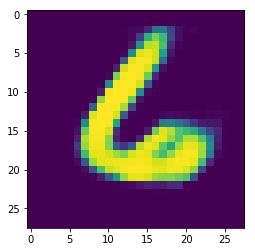

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  18



  0%|          | 1/214 [00:02<07:30,  2.11s/it]

[7 3 7 3 2 8 1 0 1 8 9 9 4 3 2 4 0 0 9 1 9 8 9 1 3 4 9 1 1 6 4 3 8 8 5 8 4
 3 5 5 0 2 9 0 5 6 8 8 7 8 2 1 7 2 1 9 3 8 4 6 7 8 1 9 0 8 7 9 8 1 1 1 3 4
 2 1 9 0 7 4 7 0 2 7 3 6 8 6 4 3 5 0 7 5 4 2 5 9 6 6 8 7 3 8 0 7 0 0 5 5 1
 6 0 5 3 7 9 3 5 3 7 5 5 9 0 8 6 1 9 9 4 0 8 1 3 4 9 4 8 7 6 7 4 4 8 4 9 8
 8 9 5 4 4 5 9 6 3 6 1 0 1 5 3 9 5 1 2 3 0 5 0 5 9 9 3 5 4 8 3 6 9 1 2 1 3
 5 7 4 9 7 9 7 7 9 4 7 6 9 5 5 7 3 4 1 2 7 4 4 9 6 1 3 9 4 9 9 0 8 3 2 7 7
 9 4 1 7 0 0 0 8 1 3 5 8 5 2 1 2 4 4 0 4 4 5 5 2 2 9 5 0 3 2 1 0 8 7]
[7 3 7 3 2 8 1 0 1 8 9 9 4 3 2 4 0 0 9 1 9 8 9 1 3 4 9 1 1 6 4 3 8 8 5 8 4
 3 5 5 0 2 9 0 5 6 8 8 7 8 2 1 7 2 1 9 3 8 4 6 7 8 1 9 0 8 7 9 8 1 1 1 3 4
 2 1 9 0 7 4 7 0 2 7 3 6 8 6 4 3 5 0 7 5 4 2 5 9 6 6 8 7 3 8 0 7 0 0 5 5 1
 6 0 5 3 7 9 3 5 3 7 5 5 9 0 8 6 1 9 9 4 0 8 1 3 4 9 4 8 7 6 7 4 4 8 4 9 8
 8 9 5 4 4 5 9 6 3 6 1 0 1 5 3 9 5 1 2 3 0 5 0 5 9 9 3 5 4 8 3 6 9 1 2 1 3
 5 7 4 9 7 9 7 7 9 4 7 6 9 5 5 7 3 4 1 2 7 4 4 9 6 1 3 9 4 9 9 0 8 3 2 7 7
 9 4 1 7 0 0 0 8 1 3 5 8 5 2 1


  1%|          | 2/214 [00:04<07:26,  2.11s/it]

[7 0 2 4 1 1 5 8 2 6 0 3 1 0 0 2 0 5 6 5 1 5 5 9 6 9 6 1 5 3 4 0 5 4 9 1 8
 8 0 1 1 4 0 3 4 3 2 2 8 3 2 8 0 3 4 3 6 3 1 8 0 9 2 0 0 3 5 1 8 4 2 1 3 9
 1 4 8 2 1 5 3 2 7 8 1 1 1 5 9 4 1 4 7 0 9 6 0 0 5 5 4 9 6 5 8 7 2 3 1 7 2
 0 0 0 2 0 7 4 8 9 4 9 9 8 1 5 4 5 4 7 3 2 7 6 0 9 4 6 8 8 1 5 3 1 6 2 7 3
 4 9 0 0 1 1 3 6 3 5 3 3 7 4 2 3 5 9 6 6 9 8 6 9 7 4 9 4 3 2 7 1 7 6 5 2 0
 9 1 7 0 1 3 5 0 9 7 0 4 7 9 9 6 4 2 0 8 7 5 4 4 9 9 2 4 4 9 3 1 1 3 4 9 7
 7 8 1 6 0 1 9 0 5 1 0 4 3 0 8 3 6 5 5 3 6 5 7 3 1 0 9 0 1 1 3 7 0 3]
[7 0 2 4 1 1 5 8 2 6 0 3 1 0 0 2 0 5 6 5 1 5 5 9 6 9 6 1 5 3 4 0 5 4 9 1 8
 8 0 1 1 4 0 3 4 3 2 2 8 3 2 8 0 3 4 3 6 3 1 8 0 9 2 0 0 3 5 1 8 4 2 1 3 9
 1 4 8 2 1 5 3 2 9 8 1 1 1 5 9 4 1 4 7 0 9 6 0 0 5 5 4 9 6 5 8 7 2 3 1 7 2
 0 0 0 2 0 7 4 8 9 4 9 9 8 1 5 4 5 4 7 3 2 7 6 0 9 4 6 8 8 1 5 3 1 6 2 7 3
 4 9 0 0 1 1 3 6 3 5 3 3 7 4 2 3 5 9 6 6 9 8 6 9 7 4 9 4 3 2 7 1 7 6 5 2 0
 9 1 7 0 1 3 5 0 9 7 0 4 7 9 9 6 4 2 0 8 7 5 4 4 9 9 2 4 4 9 3 1 1 3 4 9 7
 7 8 1 6 0 1 9 0 5 1 0 4 3 0 8


  1%|▏         | 3/214 [00:06<07:26,  2.12s/it]

[5 2 7 0 2 8 2 0 0 7 1 9 4 1 4 2 7 9 6 6 8 4 0 0 1 6 8 0 2 2 0 1 8 1 6 8 3
 6 5 9 5 4 8 3 2 1 9 1 7 2 3 8 8 5 8 6 7 6 9 8 4 1 3 9 3 1 7 3 8 0 8 9 8 1
 4 3 3 3 6 1 2 6 4 4 3 1 7 5 3 0 1 8 5 0 3 1 1 7 3 9 3 7 2 7 7 2 8 5 0 6 2
 0 3 5 2 5 2 2 5 1 7 0 5 1 9 2 6 4 5 7 4 8 6 3 5 1 2 9 6 6 2 2 9 0 4 0 4 0
 7 1 0 1 0 2 4 6 2 9 1 6 1 7 5 4 7 9 6 8 7 1 6 4 6 0 2 1 6 5 0 2 6 1 3 1 3
 3 2 4 6 7 2 3 3 4 2 5 4 7 6 8 1 0 4 7 0 7 8 2 5 1 9 0 1 1 2 6 6 3 1 5 9 9
 8 5 6 5 5 4 7 2 0 6 1 8 8 8 6 3 0 1 8 8 9 3 1 8 2 5 5 3 8 8 7 7 2 2]
[5 2 7 0 2 8 2 0 0 7 1 9 4 1 4 2 7 9 6 6 8 4 0 0 1 6 8 0 2 2 0 1 8 1 6 8 3
 6 5 9 5 4 8 3 2 1 9 1 7 2 3 8 8 5 8 6 7 6 9 8 4 1 3 9 3 1 7 3 8 0 8 9 8 1
 4 3 3 3 6 1 2 6 4 4 3 1 7 5 3 0 1 8 5 0 3 1 1 7 3 9 3 7 2 7 7 2 8 5 0 6 2
 0 3 5 2 5 2 2 5 1 7 0 5 1 9 2 6 4 5 7 4 8 6 3 5 1 2 9 6 6 2 2 9 0 4 0 4 0
 7 1 0 1 0 2 4 6 2 9 1 6 1 7 5 4 7 9 6 8 7 1 6 4 6 0 2 1 6 5 0 2 6 1 3 1 3
 3 2 4 6 7 2 3 3 4 2 5 4 7 6 8 1 0 4 7 0 7 8 2 5 1 9 0 1 1 2 6 6 3 1 5 9 9
 8 5 6 5 5 4 7 2 0 6 1 8 8 8 6


  2%|▏         | 4/214 [00:08<07:26,  2.13s/it]

[9 8 9 0 7 4 5 8 6 3 3 9 7 7 9 2 6 7 3 9 4 3 0 2 4 5 2 3 1 4 3 5 3 0 1 9 1
 6 7 5 7 7 7 7 6 4 2 9 0 6 7 1 3 3 3 0 6 0 9 0 5 2 1 8 5 9 4 8 6 2 7 1 2 7
 0 5 3 1 0 0 9 2 7 5 3 9 4 8 3 5 2 6 5 6 0 3 6 4 3 5 6 6 3 8 3 0 6 3 7 3 0
 0 7 4 5 3 2 0 7 1 9 3 2 6 1 3 7 1 2 1 7 7 6 1 3 9 3 5 5 3 8 4 8 3 6 0 8 5
 0 1 9 2 6 1 7 0 5 3 7 1 0 0 2 8 1 6 9 7 0 2 3 9 2 8 2 4 7 8 9 7 3 3 8 0 6
 1 5 3 0 7 6 5 7 2 1 4 2 2 3 3 8 4 6 4 7 1 8 4 8 6 9 6 2 9 2 2 5 3 1 9 8 1
 7 3 3 7 5 7 3 6 3 1 1 3 8 9 6 1 2 0 1 9 8 9 0 9 5 6 8 8 8 2 1 2 1 0]
[9 8 9 0 7 4 5 8 6 3 3 9 7 7 9 2 6 7 3 9 4 3 0 2 4 5 2 3 1 4 3 5 3 0 1 9 1
 6 7 5 7 7 7 7 6 4 2 9 0 6 7 1 3 3 3 0 6 0 9 0 5 2 1 8 5 9 4 8 6 2 7 1 2 7
 0 5 3 1 0 0 9 2 7 5 3 9 4 8 3 5 2 6 5 6 0 3 6 4 3 5 6 6 3 8 3 0 6 3 7 3 0
 0 7 4 5 3 2 0 7 1 9 3 2 6 1 3 7 1 2 1 7 7 6 1 3 9 3 5 5 3 8 4 8 3 6 0 8 5
 0 1 9 2 6 1 7 0 5 3 7 1 0 0 2 8 1 6 9 7 0 2 3 9 2 8 2 4 7 8 9 7 3 3 8 0 6
 1 5 3 0 7 6 5 7 2 1 4 2 2 3 3 8 4 6 4 7 1 8 4 8 6 9 6 2 9 2 2 5 3 1 9 8 1
 7 3 3 7 5 7 3 6 3 1 1 3 8 9 6


  2%|▏         | 5/214 [00:10<07:27,  2.14s/it]

[9 1 2 0 9 3 6 1 1 6 8 4 4 4 6 0 2 2 8 7 9 7 6 1 9 7 7 8 8 4 6 4 8 4 0 0 7
 9 0 9 6 5 9 8 6 5 5 4 4 3 4 2 5 2 4 1 6 6 6 5 6 0 2 2 7 1 5 7 1 0 7 5 2 0
 5 4 1 9 8 4 6 3 8 0 1 8 5 0 0 4 3 6 7 7 1 1 3 5 8 5 9 6 7 7 6 6 5 3 0 2 9
 7 5 6 3 5 8 5 9 7 6 6 6 5 1 6 2 3 2 9 2 0 5 9 6 9 9 0 1 8 9 5 8 9 0 8 9 1
 6 9 7 1 5 4 6 2 0 0 3 9 5 3 1 7 3 3 6 1 6 2 3 0 8 0 4 3 7 7 1 3 0 7 3 3 3
 9 5 1 1 9 4 6 8 5 8 6 6 7 3 0 3 7 1 0 4 4 8 9 1 4 7 5 2 0 9 1 3 2 8 5 3 1
 1 5 0 9 2 0 0 4 2 2 7 8 7 2 5 1 4 8 3 6 3 4 3 4 8 3 2 8 1 1 5 6 9 8]
[9 1 2 0 9 3 6 1 1 6 8 4 4 4 6 0 2 2 8 7 9 7 6 1 9 7 7 8 8 4 6 4 8 4 0 0 7
 9 0 9 6 5 9 8 6 5 5 4 4 3 4 2 5 2 4 1 6 6 6 5 6 0 2 2 7 1 5 7 1 0 7 5 2 0
 5 4 1 9 8 4 6 3 8 0 1 8 5 0 0 4 3 6 7 7 1 1 3 5 8 5 9 6 7 7 6 6 5 3 0 2 9
 7 5 6 3 5 8 5 9 7 6 6 6 5 1 6 2 3 2 9 2 0 5 9 6 9 9 0 1 8 9 5 8 9 0 8 9 1
 6 9 7 1 5 4 6 2 0 0 3 9 5 3 1 7 3 3 6 1 6 2 3 0 8 0 4 3 7 7 1 3 0 7 3 3 3
 9 5 1 1 9 4 6 8 5 8 6 6 7 3 0 3 7 1 0 4 4 8 9 1 4 7 5 2 0 9 1 3 2 8 5 3 1
 1 5 0 9 2 0 0 4 2 2 7 8 7 2 5


  3%|▎         | 6/214 [00:13<07:31,  2.17s/it]

[9 2 7 7 7 6 7 8 7 5 4 2 7 6 6 0 0 0 2 7 8 9 4 9 6 0 1 2 0 9 9 8 0 9 4 8 4
 7 9 7 8 8 2 6 7 0 2 7 9 5 2 8 3 0 8 1 8 4 6 3 4 8 0 0 4 3 5 8 1 3 2 7 1 6
 5 9 0 3 5 8 3 6 7 9 1 0 7 3 3 9 8 3 6 7 5 6 1 0 4 5 6 7 7 4 7 2 4 0 6 6 5
 8 3 9 5 6 5 4 0 5 1 2 1 9 3 7 1 4 2 3 9 6 8 0 0 9 9 1 9 9 8 9 9 1 8 8 1 4
 4 0 9 7 5 6 9 0 8 8 6 4 7 6 7 2 0 7 1 6 3 2 4 4 6 0 1 3 1 5 5 0 0 9 4 2 6
 6 1 2 5 7 4 6 9 9 3 9 1 6 2 7 5 7 6 8 0 2 4 4 6 7 3 9 4 4 7 6 8 1 2 8 6 1
 2 8 6 1 2 2 0 6 5 6 1 8 0 3 7 4 1 3 9 6 8 9 5 8 4 8 1 6 5 5 6 7 7 2]
[9 2 7 7 7 6 7 8 7 5 4 2 7 6 6 0 0 0 2 7 8 9 4 9 6 0 1 2 0 9 9 8 0 9 4 8 4
 7 9 7 8 8 2 6 7 0 2 7 9 5 2 8 3 0 8 1 8 4 6 3 4 8 0 0 4 3 5 8 1 3 2 7 1 6
 5 9 0 3 5 8 3 6 7 9 1 0 7 3 3 9 8 3 6 7 5 6 1 0 4 5 6 7 7 4 7 2 4 0 6 6 5
 8 3 9 5 6 5 4 0 5 1 2 1 9 3 7 1 4 2 3 9 6 8 0 0 9 9 1 9 9 8 9 9 1 8 8 1 4
 4 0 9 7 5 6 9 0 8 8 6 4 7 6 7 2 0 7 1 6 3 2 4 4 6 0 1 3 1 5 5 0 0 9 4 2 6
 6 1 2 5 7 4 6 9 9 3 9 1 6 2 7 5 7 6 8 0 2 4 4 6 7 3 9 4 4 7 6 8 1 2 8 6 1
 2 8 6 1 2 2 0 6 5 6 1 8 0 3 7


  3%|▎         | 7/214 [00:15<07:32,  2.19s/it]

[1 2 9 6 9 0 3 7 5 3 9 9 8 7 6 9 0 0 3 3 5 3 6 4 6 7 5 7 4 5 8 7 3 7 6 4 4
 0 0 6 1 5 2 2 3 3 7 6 7 5 2 6 2 0 4 6 8 9 0 3 4 7 8 5 4 5 5 2 0 6 5 0 9 9
 4 7 3 4 4 4 5 7 0 6 4 6 7 8 8 6 3 6 3 4 1 6 8 0 2 5 9 1 2 1 0 6 1 6 8 3 3
 2 6 1 9 0 0 6 7 5 9 1 5 0 6 0 4 8 1 8 3 2 5 2 4 8 8 1 3 2 6 1 3 6 3 3 1 6
 7 5 2 4 0 8 0 2 3 3 1 7 2 1 8 8 2 8 6 1 3 2 0 2 7 4 4 2 9 3 7 2 1 7 7 8 4
 4 8 5 7 5 5 7 1 4 9 2 2 0 2 8 6 3 3 1 7 2 5 3 1 0 1 5 4 9 3 2 8 9 1 4 8 8
 4 4 6 7 1 1 5 3 1 4 8 8 4 2 7 6 1 9 6 7 0 0 3 6 0 5 6 5 9 8 4 8 3 7]
[1 2 9 6 9 0 3 7 5 3 9 9 8 7 6 9 0 0 3 3 5 3 6 4 6 7 5 7 4 5 8 7 3 7 6 4 4
 0 0 6 1 5 2 2 3 3 7 6 7 5 2 6 2 0 4 6 8 9 0 3 4 7 8 5 4 5 5 2 0 6 5 0 9 9
 4 7 3 4 4 4 5 7 0 6 4 6 7 8 8 6 3 6 3 4 1 6 8 0 2 5 9 1 2 1 0 6 1 6 8 3 3
 2 6 1 9 0 0 6 7 5 9 1 5 0 6 0 4 8 1 8 3 2 5 2 4 8 8 1 3 2 6 1 3 6 3 3 1 6
 7 5 2 4 0 8 0 2 3 3 1 7 2 1 8 8 2 8 6 1 3 2 0 2 7 4 4 2 9 3 7 2 1 7 7 8 4
 4 8 5 7 5 5 7 1 4 9 2 2 0 2 8 6 3 3 1 7 2 5 3 1 0 1 5 4 9 3 2 8 9 1 4 8 8
 4 4 6 7 1 1 5 3 1 4 8 8 4 2 7


  4%|▎         | 8/214 [00:17<07:34,  2.21s/it]

[8 2 7 3 5 2 0 0 5 3 9 0 1 5 1 5 6 5 8 2 2 4 4 0 8 2 3 2 4 1 6 4 5 1 8 4 3
 4 1 4 3 8 8 7 3 0 4 7 4 1 1 9 5 8 3 6 0 1 6 3 6 3 8 0 1 4 6 7 6 4 2 6 2 8
 7 8 4 3 4 9 7 7 0 9 4 9 8 4 9 6 6 4 3 1 0 8 6 1 5 2 1 2 7 0 7 0 4 4 2 6 8
 2 3 3 7 1 8 3 9 9 1 9 5 0 6 0 3 1 0 3 7 4 3 8 2 6 0 7 8 8 4 8 2 6 4 1 5 5
 5 5 3 8 6 1 8 2 4 6 6 1 1 6 3 8 6 1 3 4 0 8 2 7 4 4 0 0 5 4 0 1 9 4 7 1 7
 2 8 2 1 4 5 6 5 1 2 4 2 3 8 7 5 8 5 1 1 8 2 9 6 9 0 8 2 7 0 9 8 9 1 6 4 4
 9 4 8 7 9 7 6 0 7 5 6 6 5 9 2 7 9 9 0 3 1 7 9 5 0 5 9 0 5 3 9 3 5 6]
[8 2 7 3 5 2 0 0 5 3 9 0 1 5 1 5 6 5 8 2 2 4 4 0 8 2 3 2 4 1 6 4 5 1 8 4 3
 4 1 4 3 8 8 7 3 0 4 7 4 1 1 9 5 8 3 6 0 1 6 3 6 3 8 0 1 4 6 7 6 4 2 6 2 8
 7 8 4 3 4 9 7 7 0 9 4 9 8 4 9 6 6 4 3 1 0 8 6 1 5 2 1 2 7 0 7 0 4 4 2 6 8
 2 3 3 7 1 8 3 9 9 1 9 5 0 6 0 3 1 0 3 7 4 3 8 2 6 0 7 8 8 4 8 2 6 4 1 5 5
 5 5 3 8 6 1 8 2 4 6 6 1 1 6 3 8 6 1 3 4 0 8 2 7 4 4 0 0 5 4 0 1 9 4 7 1 7
 2 8 2 1 4 5 6 5 1 2 4 2 3 8 7 5 8 5 1 1 8 2 9 6 9 0 8 2 7 0 9 8 9 1 6 4 4
 9 4 8 7 9 7 6 0 7 5 6 6 5 9 2


  4%|▍         | 9/214 [00:19<07:34,  2.22s/it]

[9 7 8 3 9 4 1 1 1 8 8 5 6 4 3 8 9 6 0 9 7 8 6 7 9 7 9 7 5 7 0 1 7 6 6 7 4
 3 2 3 8 6 3 6 8 8 3 2 7 1 1 0 9 8 4 8 8 3 2 1 8 9 7 8 6 1 0 6 2 3 2 2 7 7
 5 7 5 7 5 5 7 8 6 4 9 5 4 2 4 2 8 4 2 3 9 2 9 4 7 7 5 4 6 7 1 3 9 0 4 4 8
 7 4 1 9 6 8 6 9 2 2 6 9 2 7 6 9 5 7 8 2 2 2 9 2 1 6 3 9 8 0 8 0 7 3 6 0 8
 9 9 8 8 0 1 9 0 9 0 5 0 2 9 0 0 9 4 8 5 1 3 5 2 4 6 3 0 9 8 2 8 5 2 1 5 7
 3 2 1 6 7 1 9 6 3 5 1 1 7 2 6 3 5 7 1 1 7 1 6 8 6 3 8 0 4 3 6 9 6 6 9 7 6
 3 4 5 5 7 2 1 9 3 5 3 4 0 1 4 5 3 2 1 7 3 1 6 6 3 4 2 0 4 4 8 6 6 5]
[9 7 8 3 9 4 1 1 1 8 8 5 6 4 3 8 9 6 0 9 7 8 6 7 9 7 9 7 5 7 0 1 7 6 6 7 4
 3 2 3 8 6 3 6 8 8 3 2 7 1 1 0 9 8 4 8 8 3 2 1 8 9 7 8 6 1 0 6 2 3 2 2 7 7
 5 7 5 7 5 5 7 8 6 4 9 5 4 2 4 2 8 4 2 3 9 2 9 4 7 7 5 4 6 7 1 3 9 0 4 4 8
 7 4 1 9 6 8 6 9 2 2 6 9 2 7 6 9 5 7 8 2 2 2 9 2 1 6 3 9 8 0 8 0 7 3 6 0 8
 9 9 8 8 0 1 9 0 9 0 5 0 2 9 0 0 9 4 8 5 1 3 5 2 4 6 3 0 9 8 2 8 5 2 1 5 7
 3 2 1 6 7 1 9 6 3 5 1 1 7 2 6 3 5 7 1 1 7 1 6 8 6 3 8 0 4 3 6 9 6 6 9 7 6
 3 4 5 5 7 2 1 9 3 5 3 4 0 1 4


  5%|▍         | 10/214 [00:22<07:31,  2.21s/it]

[4 1 7 1 5 3 5 6 8 8 8 4 8 5 8 2 6 8 2 4 5 8 0 5 5 4 4 1 1 8 5 9 1 1 7 3 4
 3 9 3 4 1 1 8 8 4 2 1 2 8 7 3 4 6 4 7 1 6 5 9 4 8 1 8 8 0 2 1 5 2 2 7 7 4
 7 7 0 3 8 0 1 9 8 6 8 2 6 7 1 7 9 6 1 1 3 8 3 6 4 6 4 1 3 9 4 3 4 1 1 9 0
 8 7 8 2 0 4 4 4 7 5 9 8 0 3 5 0 4 5 5 1 5 2 4 0 7 7 0 0 8 3 3 7 0 6 2 7 5
 0 8 9 5 9 2 7 8 9 0 7 1 4 5 4 9 1 6 8 5 0 6 7 1 5 1 5 3 3 8 7 8 7 9 8 9 0
 5 9 4 3 5 7 6 1 0 9 5 4 0 7 7 3 9 7 0 0 3 7 4 8 7 4 1 8 7 6 0 0 9 3 9 7 4
 0 6 4 9 5 7 6 3 3 6 0 0 6 0 4 3 3 0 2 4 0 3 3 9 8 8 3 8 4 8 2 4 1 8]
[4 1 7 1 5 3 5 6 8 8 8 4 8 5 8 2 6 8 2 4 5 8 0 5 5 4 4 1 1 8 5 9 1 1 7 3 4
 3 9 3 4 1 1 8 8 4 2 1 2 8 7 3 4 6 4 7 1 6 5 9 4 8 1 8 8 0 2 1 5 2 2 7 7 4
 7 7 0 3 8 0 1 9 8 6 8 2 6 7 1 7 9 6 1 1 3 8 3 6 4 6 4 1 3 9 4 3 4 1 1 9 0
 8 7 8 2 0 4 4 4 7 5 9 8 0 3 5 0 4 5 5 1 5 2 4 0 7 7 0 0 8 3 3 7 0 6 2 7 5
 0 8 9 5 9 2 7 8 9 0 7 1 4 5 4 9 1 6 8 5 0 6 7 1 5 1 5 3 3 8 7 8 7 9 8 9 0
 5 9 4 3 5 7 6 1 0 9 5 4 0 7 7 3 9 7 0 0 3 7 4 8 7 4 1 8 7 6 0 0 9 3 9 7 4
 0 6 4 9 5 7 6 3 3 6 0 0 6 0 4


  5%|▌         | 11/214 [00:24<07:27,  2.20s/it]

[3 1 7 7 6 4 0 6 6 7 9 5 1 1 9 2 1 1 6 8 0 5 2 3 3 5 0 1 1 8 7 4 8 4 8 2 9
 1 9 9 7 1 9 4 0 2 7 2 0 5 0 3 7 5 4 3 7 3 3 3 6 5 5 7 1 2 5 5 9 1 2 4 6 4
 1 2 5 7 7 2 5 3 9 2 5 5 1 6 7 7 5 7 4 0 7 6 9 6 5 9 1 6 8 4 1 2 3 0 1 7 2
 6 6 2 2 0 7 9 7 6 1 2 6 6 4 3 2 1 3 5 4 8 9 9 7 7 2 9 3 1 1 8 1 2 4 8 7 5
 6 0 4 3 5 1 8 9 7 7 2 7 9 5 6 6 6 2 2 6 3 5 4 5 6 8 7 1 1 4 0 7 6 4 7 0 3
 0 7 5 1 4 6 9 8 1 1 5 4 1 9 0 9 8 4 6 0 4 5 7 6 1 7 7 9 9 9 7 7 4 9 0 5 1
 8 5 4 0 7 1 8 8 8 3 1 4 1 4 3 0 0 9 0 1 1 1 0 7 8 1 3 5 1 4 9 4 1 8]
[3 1 7 7 6 4 0 6 6 7 9 5 1 1 9 2 1 1 6 8 0 5 2 3 3 5 0 1 1 8 7 4 8 4 8 2 9
 1 9 9 7 1 9 4 0 2 7 2 0 5 0 3 7 5 4 3 7 3 3 3 6 5 5 7 1 2 5 5 9 1 2 4 6 4
 1 2 5 7 7 2 5 3 9 2 5 5 1 6 7 7 5 7 4 0 7 6 9 6 5 9 1 6 8 4 1 2 3 0 1 7 2
 6 6 2 2 0 7 9 7 6 1 2 6 6 4 3 2 1 3 5 4 8 9 9 7 7 2 9 3 1 1 8 1 2 4 8 7 5
 6 0 4 3 5 1 8 9 7 7 2 7 9 5 6 6 6 2 2 6 3 5 4 5 6 8 7 1 1 4 0 7 6 4 7 0 3
 0 7 5 1 4 6 9 8 1 1 5 4 1 9 0 9 8 4 6 0 4 5 7 6 1 7 7 9 9 9 7 7 4 9 0 5 1
 8 5 4 0 7 1 8 8 8 3 1 4 1 4 3


  6%|▌         | 12/214 [00:26<07:24,  2.20s/it]

[3 7 2 1 5 3 4 6 1 2 3 9 8 0 2 9 1 2 5 7 4 2 1 1 0 2 6 5 8 5 5 2 7 4 4 7 7
 9 9 5 6 4 5 7 2 0 2 2 2 7 1 6 4 6 2 0 1 0 1 6 1 5 5 4 4 2 0 7 6 0 3 3 2 1
 1 9 0 0 7 6 3 3 6 6 8 3 9 2 7 9 1 5 7 4 9 8 4 8 6 1 7 6 6 5 1 2 6 2 4 2 3
 1 5 9 6 0 3 2 0 4 5 6 3 0 9 2 6 6 8 8 6 3 7 8 4 0 3 6 3 7 0 4 8 2 0 8 9 7
 0 5 2 7 8 1 5 1 9 0 6 2 5 6 5 8 8 9 0 3 5 8 6 2 8 9 5 9 4 6 1 9 1 9 4 4 2
 2 3 2 0 6 2 7 5 3 6 3 0 4 1 3 7 0 7 9 3 7 9 5 0 0 7 7 3 3 2 8 6 9 0 8 8 0
 1 7 0 6 9 2 3 3 7 7 4 6 5 0 1 6 1 4 0 7 5 1 2 3 7 6 1 4 6 7 1 5 1 1]
[3 7 2 1 5 3 4 6 1 2 3 9 8 0 2 9 1 2 5 7 4 2 1 1 0 2 6 5 8 5 5 2 7 4 4 7 7
 9 9 5 6 4 5 7 2 0 2 2 2 7 1 6 4 6 2 0 1 0 1 6 1 5 5 4 4 2 0 7 6 0 3 3 2 1
 1 9 0 0 7 6 3 3 6 6 8 3 9 2 7 9 1 5 7 4 9 8 4 8 6 1 7 6 6 5 1 2 6 2 4 2 3
 1 5 9 6 0 3 2 0 4 5 6 3 0 9 2 6 6 8 8 6 3 7 8 4 0 3 6 3 7 0 4 8 2 0 8 9 7
 0 5 2 7 8 1 5 1 9 0 6 2 5 6 5 8 8 9 0 3 5 8 6 2 8 9 5 9 4 6 1 9 1 9 4 4 2
 2 3 2 0 6 2 7 5 3 6 3 0 4 1 3 7 0 7 9 3 7 9 5 0 0 7 7 3 3 2 8 6 9 0 8 8 0
 1 7 0 6 9 2 3 3 7 7 4 6 5 0 1


  6%|▌         | 13/214 [00:28<07:23,  2.20s/it]

[4 7 6 0 0 9 9 3 4 9 3 0 1 3 7 1 3 3 5 6 7 2 9 3 1 0 5 3 7 9 1 6 7 4 0 7 8
 4 9 5 1 4 4 8 1 9 6 5 2 5 6 2 5 9 2 2 1 4 9 0 6 6 7 6 6 5 3 2 4 3 2 3 3 2
 9 4 1 7 8 5 2 2 2 1 2 3 1 2 8 3 7 3 9 8 0 2 2 2 5 6 5 3 1 2 6 2 7 1 7 6 5
 2 4 3 4 3 6 9 1 7 9 4 9 6 0 2 7 1 5 2 8 7 0 6 5 8 0 7 2 5 9 8 3 0 5 0 1 1
 9 5 3 8 3 8 7 1 5 1 4 7 0 2 4 9 4 6 8 7 5 9 0 8 0 1 7 5 1 7 3 9 9 5 6 1 7
 7 1 2 3 1 4 7 3 4 0 2 7 6 3 1 8 7 3 8 8 3 1 3 0 8 9 7 6 0 1 4 9 1 6 0 3 2
 7 1 7 3 1 5 3 2 1 4 8 4 1 4 6 1 0 9 9 2 5 4 2 6 6 3 0 0 9 8 7 5 2 0]
[4 7 6 0 0 9 9 3 4 9 3 0 1 3 7 1 3 3 5 6 7 2 9 3 1 0 5 3 7 9 1 6 7 4 0 7 8
 4 9 5 1 4 4 8 1 9 6 5 2 5 6 2 5 9 2 2 1 4 9 0 6 6 7 6 6 5 3 2 4 3 2 3 3 2
 9 4 1 7 8 5 2 2 2 1 2 3 1 2 8 3 7 3 9 8 0 2 2 2 5 6 5 3 1 2 6 2 7 1 7 6 5
 2 4 3 4 3 6 9 1 7 9 4 9 6 0 2 7 1 5 2 8 7 0 6 5 8 0 7 2 5 9 8 3 0 5 0 1 1
 9 5 3 8 3 8 7 1 5 1 4 7 0 2 4 9 4 6 8 7 5 9 0 8 0 1 7 5 1 7 3 9 9 5 6 1 7
 7 1 2 3 1 4 7 3 4 0 2 7 6 3 1 8 7 3 8 8 3 1 3 0 8 9 7 6 0 1 4 9 1 6 0 3 2
 7 1 7 3 1 5 3 2 1 4 8 4 1 4 6


  7%|▋         | 14/214 [00:30<07:19,  2.20s/it]

[6 7 0 0 4 5 6 1 2 9 6 4 5 5 8 8 5 7 5 2 8 6 0 5 1 4 3 8 9 5 1 7 3 3 6 1 5
 2 1 2 3 4 4 9 8 1 3 4 0 2 8 3 2 7 2 6 3 8 2 3 9 4 1 6 8 3 5 9 2 5 7 5 1 3
 1 5 2 8 2 5 5 8 6 1 7 8 0 6 8 0 5 7 0 9 2 8 3 3 2 6 9 3 9 0 2 2 8 2 3 5 3
 3 6 0 0 5 7 5 4 1 1 5 5 9 1 4 1 0 3 9 8 8 8 8 6 4 3 2 9 5 0 1 7 4 6 3 2 7
 3 8 9 1 7 6 6 6 0 9 4 6 6 8 4 2 8 3 3 4 2 3 1 2 5 3 4 8 7 2 9 2 6 1 0 1 5
 4 2 5 2 5 0 4 8 2 5 9 0 9 5 4 8 0 7 2 3 3 8 7 1 6 3 0 4 6 3 7 0 9 3 1 4 6
 8 0 8 1 8 2 4 0 9 3 3 8 4 0 0 6 0 9 0 7 3 1 8 5 7 0 2 6 0 1 4 8 1 1]
[6 7 0 0 4 5 6 1 2 9 6 4 5 5 8 8 5 7 5 2 8 6 0 5 1 4 3 8 9 5 1 7 3 3 6 1 5
 2 1 2 3 4 4 9 8 1 3 4 0 2 8 3 2 7 2 6 3 8 2 3 9 4 1 6 8 3 5 9 2 5 7 5 1 3
 1 5 2 8 2 5 5 8 6 1 7 8 0 6 8 0 5 7 0 9 2 8 3 3 2 6 9 3 9 0 2 2 8 2 3 5 3
 3 6 0 0 5 7 5 4 1 1 5 5 9 1 4 1 0 3 9 8 8 8 8 6 4 3 2 9 5 0 1 7 4 6 3 2 7
 3 8 9 1 7 6 6 6 0 9 4 6 6 8 4 2 8 3 3 4 2 3 1 2 5 3 4 8 7 2 9 2 6 1 0 1 5
 4 2 5 2 5 0 4 8 2 5 9 0 9 5 4 8 0 7 2 3 3 8 7 1 6 3 0 4 6 3 7 0 9 3 1 4 6
 8 0 8 1 8 2 4 0 9 3 3 8 4 0 0


  7%|▋         | 15/214 [00:32<07:16,  2.19s/it]

[5 3 4 6 8 8 4 2 5 5 0 4 9 5 0 0 2 8 7 0 0 8 7 0 1 8 3 4 6 0 1 6 5 3 9 1 8
 6 8 8 6 3 9 7 4 0 6 8 6 7 2 7 8 4 1 3 3 2 1 0 1 6 6 1 8 4 6 1 2 5 7 0 0 7
 6 7 1 7 9 1 3 9 3 7 4 8 9 3 1 8 9 8 6 9 1 6 6 7 4 9 6 2 9 1 9 5 0 5 9 5 1
 7 7 6 5 1 3 1 6 0 1 5 0 0 6 8 6 8 1 1 6 0 2 7 4 7 0 9 1 7 1 8 0 7 4 9 4 3
 4 9 5 0 1 4 0 1 7 9 7 2 9 7 6 9 5 3 3 2 7 9 0 9 0 3 3 6 2 3 7 4 1 7 7 8 4
 9 4 4 2 1 3 2 4 5 3 2 5 8 5 9 9 6 6 9 9 4 2 9 0 9 4 3 8 2 0 4 7 8 3 9 8 5
 0 1 3 7 7 2 7 7 1 4 8 3 6 3 2 7 5 7 3 1 5 0 9 9 9 4 1 2 7 7 3 2 6 6]
[5 3 4 6 8 8 4 2 5 5 0 4 9 5 0 0 2 8 7 0 0 8 7 0 1 8 3 4 6 0 1 6 5 3 9 1 8
 6 8 8 6 3 9 7 4 0 6 8 6 7 2 7 8 4 1 3 3 2 1 0 1 6 6 1 8 4 6 1 2 5 7 0 0 7
 6 7 1 7 9 1 3 9 3 7 4 8 9 3 1 8 9 8 6 9 1 6 6 7 4 9 6 2 9 1 9 5 0 5 9 5 1
 7 7 6 5 1 3 1 6 0 1 5 0 0 6 8 6 8 1 1 6 0 2 7 4 7 0 9 1 7 1 8 0 7 4 9 4 3
 4 9 5 0 1 4 0 1 7 9 7 2 9 7 6 9 5 3 3 2 7 9 0 9 0 3 3 6 2 3 7 4 1 7 7 8 4
 9 4 4 2 1 3 2 4 5 3 2 5 8 5 9 9 6 6 9 9 4 2 9 0 9 4 3 8 2 0 4 7 8 3 9 8 5
 0 1 3 7 7 2 7 7 1 4 8 3 6 3 2


  7%|▋         | 16/214 [00:35<07:13,  2.19s/it]

[0 1 3 8 1 2 7 2 3 3 2 2 3 0 4 8 3 3 1 3 1 9 1 6 5 6 2 0 8 9 4 0 6 8 0 4 2
 4 6 3 7 8 3 6 6 7 5 0 8 6 3 6 6 6 0 5 7 8 6 5 0 6 2 4 5 1 0 1 4 0 9 3 6 5
 1 2 3 3 7 8 1 2 3 9 9 1 8 1 1 1 5 2 5 4 1 3 7 1 8 9 3 6 9 7 1 5 6 8 0 1 6
 3 9 5 1 7 2 2 5 1 7 7 2 1 4 2 7 7 8 8 4 2 6 5 6 8 0 3 0 1 9 4 7 9 0 2 5 6
 8 8 4 4 6 5 6 5 0 1 1 2 8 1 0 4 3 3 4 1 4 6 9 3 2 7 0 7 0 2 1 1 0 5 9 9 4
 9 4 1 8 5 4 0 3 0 9 5 7 9 8 1 6 7 3 1 0 4 8 5 3 9 0 3 1 2 0 7 6 0 2 3 9 2
 2 7 8 7 4 3 0 2 7 0 2 3 3 6 2 6 4 3 1 4 0 4 7 8 6 8 7 0 7 8 7 0 8 0]
[0 1 3 8 1 2 7 2 3 3 2 2 3 0 4 8 3 3 1 3 1 9 1 6 5 6 2 0 8 9 4 0 6 8 0 4 2
 4 6 3 7 8 3 6 6 7 5 0 8 6 3 6 6 6 0 5 7 8 6 5 0 6 2 4 5 1 0 1 4 0 9 3 6 5
 1 2 3 3 7 8 1 2 3 9 9 1 8 1 1 1 5 2 5 4 1 3 7 1 8 9 3 6 9 7 1 5 6 8 0 1 6
 3 9 5 1 7 2 2 5 1 7 7 2 1 4 2 7 7 8 8 4 2 6 5 6 8 0 3 0 1 9 4 7 9 0 2 5 6
 8 8 4 4 6 5 6 5 0 1 1 2 8 1 0 4 3 3 4 1 4 6 9 3 2 7 0 7 0 2 1 1 0 5 9 9 4
 9 4 1 8 5 4 0 3 0 9 5 7 9 8 1 6 7 3 1 0 4 8 5 3 9 0 3 1 2 0 7 6 0 2 3 9 2
 2 7 8 7 4 3 0 2 7 0 2 3 3 6 2


  8%|▊         | 17/214 [00:37<07:10,  2.19s/it]

[9 3 7 6 7 6 1 8 8 8 7 4 2 7 0 1 6 9 3 2 8 7 7 1 5 6 6 2 2 2 3 6 7 6 6 2 1
 2 6 3 3 9 3 1 2 7 6 3 6 9 6 4 4 8 5 8 3 3 7 7 3 5 1 6 4 1 5 1 9 9 8 0 7 9
 6 4 1 4 1 4 0 9 3 8 7 8 9 6 0 0 0 6 8 6 1 1 2 3 4 5 2 0 8 6 0 5 9 5 3 5 7
 5 9 5 6 3 7 2 2 0 2 7 5 7 0 9 8 6 3 2 3 5 3 1 4 3 0 6 7 4 1 3 4 9 6 6 1 8
 4 3 3 0 7 2 2 0 7 1 3 1 2 5 0 9 6 7 2 0 6 0 4 7 2 6 7 5 1 1 0 1 5 5 8 1 0
 6 9 3 5 5 6 2 8 7 3 7 8 3 7 8 8 6 3 9 9 7 6 5 6 9 9 3 2 2 7 7 8 8 7 6 7 2
 1 9 8 6 4 8 5 1 0 2 2 4 2 0 7 1 1 4 5 9 8 1 2 2 6 9 9 8 0 8 6 9 9 1]
[9 3 7 6 7 6 1 8 8 8 7 4 2 7 0 1 6 9 3 2 8 7 7 1 5 6 6 2 2 2 3 6 7 6 6 2 1
 2 6 3 3 9 3 1 2 7 6 3 6 9 6 4 4 8 5 8 3 3 7 7 3 5 1 6 4 1 5 1 9 9 8 0 7 9
 6 4 1 4 1 4 0 9 3 8 7 8 9 6 0 0 0 6 8 6 1 1 2 3 4 5 2 0 8 6 0 5 9 5 3 5 7
 5 9 5 6 3 7 2 2 0 2 7 5 7 0 9 8 6 3 2 3 5 3 1 4 3 0 6 7 4 1 3 4 9 6 6 1 8
 4 3 3 0 7 2 2 0 7 1 3 1 2 5 0 9 6 7 2 0 6 0 4 7 2 6 7 5 1 1 0 1 5 5 8 1 0
 6 9 3 5 5 6 2 8 7 3 7 8 3 7 8 8 6 3 9 9 7 6 5 6 9 9 3 2 2 7 7 8 8 7 6 7 2
 1 9 8 6 4 8 5 1 0 2 2 4 2 0 7


  8%|▊         | 18/214 [00:39<07:07,  2.18s/it]

[2 6 2 4 7 0 9 5 7 9 6 9 8 8 3 0 0 9 6 3 5 8 3 6 9 9 0 2 1 2 7 2 4 5 4 4 7
 2 3 0 4 0 9 9 8 9 8 2 0 9 8 4 3 4 4 8 2 6 7 2 8 5 3 9 8 0 7 2 9 2 5 8 7 9
 4 8 3 8 8 0 1 6 7 8 2 0 0 6 6 4 6 1 8 4 3 2 5 8 5 5 2 2 6 5 4 7 5 5 8 0 1
 1 9 2 5 1 9 2 4 1 9 8 3 8 4 0 1 8 5 5 6 4 3 9 1 0 3 5 6 0 3 0 1 9 3 4 0 3
 1 9 5 9 1 7 0 4 2 8 6 4 0 2 9 3 8 7 3 4 0 0 2 7 4 6 1 9 0 4 9 4 1 8 2 5 0
 6 5 0 5 3 5 8 3 4 2 1 7 9 5 7 0 8 4 2 6 8 2 5 2 5 0 8 7 0 4 8 8 3 4 8 9 8
 1 6 4 6 7 1 5 7 1 6 3 1 7 2 4 3 1 3 7 8 1 9 8 0 1 2 6 0 9 0 4 7 5 0]
[2 6 2 4 7 0 9 5 7 9 6 9 8 8 3 0 0 9 6 3 5 8 3 6 9 9 0 2 1 2 7 2 4 5 4 4 7
 2 3 0 4 0 9 9 8 9 8 2 0 9 8 4 3 4 4 8 2 6 7 2 8 5 3 9 8 0 7 2 9 2 5 8 7 9
 4 8 3 8 8 0 1 6 7 8 2 0 0 6 6 4 6 1 8 4 3 2 5 8 5 5 2 2 6 5 4 7 5 5 8 0 1
 1 9 2 5 1 9 2 4 1 9 8 3 8 4 0 1 8 5 5 6 4 3 9 1 0 3 5 6 0 3 0 1 9 3 4 0 3
 1 9 5 9 1 7 0 4 2 8 6 4 0 2 9 3 8 7 3 4 0 0 2 7 4 6 1 9 0 4 9 4 1 8 2 5 0
 6 5 0 5 3 5 8 3 4 2 1 7 9 5 7 0 8 4 2 6 8 2 5 2 5 0 8 7 0 4 8 8 3 4 8 9 8
 1 6 4 6 7 1 5 7 1 6 3 1 7 2 4


  9%|▉         | 19/214 [00:41<07:05,  2.18s/it]

[5 7 6 2 1 4 0 4 9 9 2 2 3 0 6 6 5 9 1 5 3 8 9 1 1 6 9 6 3 1 9 3 7 1 1 7 3
 2 8 7 2 1 2 1 9 2 4 3 5 8 2 6 6 7 2 7 0 7 9 0 7 6 7 2 9 7 6 9 6 5 1 1 9 2
 0 6 6 7 5 5 8 1 7 2 4 3 8 2 2 4 3 1 3 1 2 0 5 1 3 3 1 4 0 0 6 8 8 5 0 3 6
 5 8 3 4 6 7 1 6 4 6 7 7 5 2 1 0 8 0 6 4 4 2 9 0 5 2 8 6 3 8 9 2 8 9 3 7 4
 1 2 6 4 2 5 4 6 4 8 9 2 8 9 5 9 7 0 9 9 7 4 9 1 3 1 7 2 9 8 6 6 6 9 9 3 8
 8 2 6 1 9 9 5 5 9 2 7 1 9 2 3 1 3 4 9 2 8 9 2 8 8 7 0 1 5 5 1 9 9 1 6 6 4
 6 0 9 8 6 0 6 3 1 1 1 7 5 7 6 0 1 0 1 9 4 0 6 1 9 3 8 6 6 8 3 4 4 4]
[5 7 6 2 1 4 0 4 9 9 2 2 3 0 6 6 5 9 1 5 3 8 9 1 1 6 9 6 3 1 9 3 7 1 1 7 3
 2 8 7 2 1 2 1 9 2 4 3 5 8 2 6 6 7 2 7 0 7 9 0 7 6 7 2 9 7 6 9 6 5 1 1 9 2
 0 6 6 7 5 5 8 1 7 2 4 3 8 2 2 4 3 1 3 1 2 0 5 1 3 3 1 4 0 0 6 8 8 5 0 3 6
 5 8 3 4 6 7 1 6 4 6 7 7 5 2 1 0 8 0 6 4 4 2 9 0 5 2 8 6 3 8 9 2 8 9 3 7 4
 1 2 6 4 2 5 4 6 4 8 9 2 8 9 5 9 7 0 9 9 7 4 9 1 3 1 7 2 9 8 6 6 6 9 9 3 8
 8 2 6 1 9 9 5 5 9 2 7 1 9 2 3 1 3 4 9 2 8 9 2 8 8 7 0 1 5 5 1 9 9 1 6 6 4
 6 0 9 8 6 0 6 3 1 1 1 7 5 7 6


  9%|▉         | 20/214 [00:42<06:55,  2.14s/it]

[3 7 1 9 7 2 6 0 0 4 9 5 8 8 3 0 3 0 0 5 7 8 7 4 5 0 9 0 9 0 5 4 7 5 1 6 7
 5 5 3 4 2 1 6 5 8 1 1 2 7 3 9 8 6 5 5 2 0 2 9 7 9 2 6 4 0 6 4 4 0 7 2 5 4
 4 2 8 6 9 8 5 1 3 5 9 8 2 3 6 7 5 7 9 3 3 0 2 9 9 0 2 4 8 4 7 9 4 5 9 0 4
 0 1 0 6 9 3 1 3 9 8 5 3 2 7 7 8 0 3 6 9 7 0 3 1 3 0 9 1 2 2 4 1 7 6 4 9 9
 2 7 1 8 9 7 9 7 2 1 7 2 4 7 0 0 1 2 4 0 2 2 7 3 5 3 2 2 0 9 6 6 7 4 7 0 0
 8 2 2 2 9 1 8 2 1 7 8 5 4 7 8 4 1 0 2 1 1 3 3 2 6 8 6 4 2 4 6 3 1 2 4 1 0
 7 5 6 9 3 1 9 4 8 1 7 1 5 6 8 6 0 0 7 5 1 9 5 0 5 6 4 0 5 0 6 9 7 4]
[3 7 1 9 7 2 6 0 0 4 9 5 8 8 3 0 3 0 0 5 7 8 7 4 5 0 9 0 9 0 5 4 7 5 1 6 7
 5 5 3 4 2 1 6 5 8 1 1 2 7 3 9 8 6 5 5 2 0 2 9 7 9 2 6 4 0 6 4 4 0 7 2 5 4
 4 2 8 6 9 8 5 1 3 5 9 8 2 3 6 7 5 7 9 3 3 0 2 9 9 0 2 4 8 4 7 9 4 5 9 0 4
 0 1 0 6 9 3 1 3 9 8 5 3 2 7 7 8 0 3 6 9 7 0 3 1 3 0 9 1 2 2 4 1 7 6 4 9 9
 2 7 1 8 9 7 9 7 2 1 7 2 4 7 0 0 1 2 4 0 2 2 7 3 5 3 2 2 0 9 6 6 7 4 7 0 0
 8 2 2 2 9 1 8 2 1 7 8 5 4 7 8 4 1 0 2 1 1 3 3 2 6 8 6 4 2 4 6 3 1 2 4 1 0
 7 5 6 9 3 1 9 4 8 1 7 1 5 6 8


 10%|▉         | 21/214 [00:43<06:43,  2.09s/it]

[4 2 6 0 2 6 5 3 8 3 7 1 2 8 9 9 6 0 6 9 1 2 3 6 2 6 8 7 7 1 4 5 3 5 4 2 2
 7 8 8 4 2 9 7 0 2 7 2 3 7 9 1 3 6 7 4 2 3 7 4 8 5 6 7 9 4 0 7 9 2 3 9 4 4
 4 8 7 9 7 9 7 0 9 1 5 2 4 4 1 7 0 6 0 3 6 3 1 2 1 9 4 8 7 6 9 9 9 4 2 3 7
 4 3 6 3 3 8 0 0 7 6 9 6 8 3 2 5 1 0 2 5 1 1 3 9 2 4 2 7 2 2 9 0 3 1 8 9 0
 4 4 1 1 9 6 7 2 4 2 8 7 8 6 0 1 8 9 2 4 5 2 7 8 2 9 5 6 0 2 2 9 8 5 4 9 2
 3 3 4 3 6 9 1 5 6 2 4 6 2 7 9 8 0 8 4 4 0 7 8 2 0 1 7 3 2 5 9 0 2 6 0 5 3
 6 9 4 9 2 3 3 4 5 3 9 3 1 4 7 6 7 5 3 4 7 6 1 9 8 6 1 6 8 5 8 0 1 6]
[4 2 6 0 2 6 5 3 8 3 7 1 2 8 9 9 6 0 6 9 1 2 3 6 2 6 8 7 7 1 4 5 3 5 4 2 2
 7 8 8 4 2 9 7 0 2 7 2 3 7 9 1 3 6 7 4 2 3 7 4 8 5 6 7 9 4 0 7 9 2 3 9 4 4
 4 8 7 9 7 9 7 0 9 1 5 2 4 4 1 7 0 6 0 3 6 3 1 2 1 9 4 8 7 6 9 9 9 4 2 3 7
 4 3 6 3 3 8 0 0 7 6 9 6 8 3 2 5 1 0 2 5 1 1 3 9 2 4 2 7 2 2 9 0 3 1 8 9 0
 4 4 1 1 9 6 7 2 4 2 8 7 8 6 0 1 8 9 2 4 5 2 7 8 2 9 5 6 0 2 2 9 8 5 4 9 2
 3 3 4 3 6 9 1 5 6 2 4 6 2 7 9 8 0 8 4 4 0 7 8 2 0 1 7 3 2 5 9 0 2 6 0 5 3
 6 9 4 9 2 3 3 4 5 3 9 3 1 4 7


 10%|█         | 22/214 [00:45<06:33,  2.05s/it]

[9 9 3 3 5 8 1 6 7 3 9 7 5 9 3 5 9 7 3 8 8 1 8 5 0 1 2 0 6 5 6 3 3 6 8 1 6
 4 1 4 1 5 4 3 9 9 5 0 2 9 7 9 8 2 3 3 3 9 2 1 8 5 1 1 0 6 8 8 9 7 3 5 8 2
 1 4 2 5 1 5 5 2 9 4 8 5 5 0 6 9 6 4 6 4 4 6 2 1 1 5 2 6 8 0 1 8 5 4 7 6 2
 9 6 4 7 4 5 4 7 7 2 5 1 2 2 2 2 1 0 0 8 5 9 5 9 6 2 1 5 3 7 1 1 2 4 8 7 2
 0 9 8 6 9 2 4 5 8 9 5 2 1 5 3 4 1 8 0 6 3 1 4 2 2 8 1 9 3 9 5 6 9 4 1 7 5
 9 5 8 3 8 3 2 6 0 5 8 7 7 2 0 3 8 9 2 5 7 9 4 3 7 0 6 4 0 8 4 7 5 6 0 8 2
 9 4 5 8 2 0 7 9 3 4 7 2 3 5 6 6 2 2 1 4 4 7 0 0 4 4 8 0 0 0 0 7 1 5]
[9 9 3 3 5 8 1 6 7 3 9 7 5 9 3 5 9 7 3 8 8 1 8 5 0 1 2 0 6 5 6 3 3 6 8 1 6
 4 1 4 1 5 4 3 9 9 5 0 2 9 7 9 8 2 3 3 3 9 2 1 8 5 1 1 0 6 8 8 9 7 3 5 8 2
 1 4 2 5 1 5 5 2 9 4 8 5 5 0 6 9 6 4 6 4 4 6 2 1 1 5 2 6 8 0 1 8 5 4 7 6 2
 9 6 4 7 4 5 4 7 7 2 5 1 2 2 2 2 1 0 0 8 5 9 5 9 6 2 1 5 3 7 1 1 2 4 8 7 2
 0 9 8 6 9 2 4 5 8 9 5 2 1 5 3 4 1 8 0 6 3 1 4 2 2 8 1 9 3 9 5 6 9 4 1 7 5
 9 5 8 3 8 3 2 6 0 5 8 7 7 2 0 3 8 9 2 5 7 9 4 3 7 0 6 4 0 8 4 7 5 6 0 8 2
 9 4 5 8 2 0 7 9 3 4 7 2 3 5 6


 11%|█         | 23/214 [00:46<06:24,  2.01s/it]

[9 7 1 1 6 8 4 5 8 8 3 5 0 5 0 1 1 9 9 3 7 0 9 0 6 2 9 7 4 9 6 7 5 1 9 2 7
 7 7 3 0 8 5 4 1 2 8 8 8 2 1 0 8 4 3 2 0 4 7 6 6 9 1 9 1 4 9 7 9 7 0 8 8 0
 1 1 0 7 7 1 8 8 9 1 9 7 9 7 1 3 6 1 3 4 2 6 9 4 4 6 6 3 9 5 7 8 3 4 3 6 7
 2 0 7 5 7 7 5 9 7 7 2 3 7 5 1 9 7 5 8 4 4 9 0 4 7 4 9 5 0 2 6 3 8 1 5 5 0
 5 6 0 1 0 7 6 5 2 6 9 2 0 3 4 1 9 1 4 9 2 1 7 6 5 5 4 7 0 0 9 7 8 5 2 9 5
 7 2 3 0 8 6 9 4 1 7 6 1 9 2 3 9 2 7 7 8 4 3 7 3 2 5 2 8 0 6 1 8 6 2 5 7 1
 9 0 7 4 2 4 1 6 2 4 7 8 3 1 3 8 4 3 8 8 5 2 0 4 7 5 7 2 4 9 0 3 2 5]
[9 7 1 1 6 8 4 5 8 8 3 5 0 5 0 1 1 9 9 3 7 0 9 0 6 2 9 7 4 9 6 7 5 1 9 2 7
 7 7 3 0 8 5 4 1 2 8 8 8 2 1 0 8 4 3 2 0 4 7 6 6 9 1 9 1 4 9 7 9 7 0 8 8 0
 1 1 0 7 7 1 8 8 9 1 9 7 9 7 1 3 6 1 3 4 2 6 9 4 4 6 6 3 9 5 7 8 3 4 3 6 7
 2 0 7 5 7 7 5 9 7 7 2 3 7 5 1 9 7 5 8 4 4 9 0 4 7 4 9 5 0 2 6 3 8 1 5 5 0
 5 6 0 1 0 7 6 5 2 6 9 2 0 3 4 1 9 1 4 9 2 1 7 6 5 5 4 7 0 0 9 7 8 5 2 9 5
 7 2 3 0 8 6 9 4 1 7 6 1 9 2 3 9 2 7 7 8 4 3 7 3 2 5 2 8 0 6 1 8 6 2 5 7 1
 9 0 7 4 2 4 1 6 2 4 7 8 3 1 3


 11%|█         | 24/214 [00:47<06:15,  1.98s/it]

[0 0 7 8 7 1 7 9 2 9 8 4 5 3 9 6 9 6 4 1 3 7 9 0 8 8 8 4 7 8 7 6 7 5 4 8 2
 8 2 8 4 3 4 7 4 2 7 2 3 5 3 4 1 7 6 4 2 7 4 0 2 0 1 6 1 6 4 5 6 9 6 1 7 2
 4 6 8 6 1 0 0 9 6 2 4 8 7 4 1 0 1 8 1 1 2 2 1 2 8 0 8 1 7 2 3 5 8 3 8 5 6
 0 4 4 4 4 1 8 3 4 1 8 2 6 8 7 0 2 5 4 9 6 8 1 5 1 9 2 0 1 4 4 1 4 3 5 6 6
 2 7 5 5 7 6 0 5 6 0 4 1 1 1 7 1 8 3 6 3 1 1 2 3 0 1 8 9 4 1 9 6 5 6 1 4 6
 2 7 5 2 8 7 5 1 2 1 7 6 6 9 3 5 1 0 0 5 3 1 3 6 7 8 4 1 4 3 2 7 0 8 5 2 2
 1 1 5 3 7 4 2 5 2 5 4 6 3 7 7 3 0 3 4 0 6 2 1 7 6 1 9 7 9 6 0 0 4 6]
[0 0 7 8 7 1 7 9 2 9 8 4 5 3 9 6 9 6 4 1 3 7 9 0 8 8 8 4 7 8 7 6 7 5 4 8 2
 8 2 8 4 3 4 7 4 2 7 2 3 5 3 4 1 7 6 4 2 7 4 0 2 0 1 6 1 6 4 5 6 9 6 1 7 2
 4 6 8 6 1 0 0 9 6 2 4 8 7 4 1 0 1 8 1 1 2 2 1 2 8 0 8 1 7 2 3 5 8 3 8 5 6
 0 4 4 4 4 1 8 3 4 1 8 2 6 8 7 0 2 5 4 9 6 8 1 5 1 9 2 0 1 4 4 1 4 3 5 6 6
 2 7 5 5 7 6 0 5 6 0 4 1 1 1 7 1 8 3 6 3 1 1 2 3 0 1 8 9 4 1 9 6 5 6 1 4 6
 2 7 5 2 8 7 5 1 2 1 7 6 6 9 3 5 1 0 0 5 3 1 3 6 7 8 4 1 4 3 2 7 0 8 5 2 2
 1 1 5 3 7 4 2 5 2 5 4 6 3 7 7


 12%|█▏        | 25/214 [00:48<06:06,  1.94s/it]

[1 3 4 5 4 7 8 7 1 4 6 0 1 3 2 4 7 1 8 7 2 5 7 5 8 6 7 2 2 4 4 8 3 0 4 1 1
 5 6 8 2 0 5 1 0 8 3 1 9 8 0 9 1 3 8 1 7 8 8 3 3 0 9 6 7 9 9 6 6 7 6 9 0 3
 1 9 1 1 9 4 9 6 2 0 3 6 7 2 7 0 0 7 2 8 3 6 5 7 6 1 0 1 7 3 6 7 8 1 5 6 5
 6 1 9 5 5 4 2 5 7 3 7 6 7 5 6 5 7 6 5 9 4 5 9 4 2 0 2 7 0 9 5 4 3 1 1 8 6
 4 3 7 6 9 5 6 7 5 0 2 0 8 2 7 1 8 2 6 3 8 8 0 1 9 5 1 8 6 8 7 3 5 3 3 9 1
 3 5 6 7 8 7 0 9 7 0 3 7 7 8 0 3 6 1 8 7 4 5 1 4 3 1 8 5 8 3 0 9 7 1 8 8 3
 5 5 8 7 4 5 1 9 3 2 9 5 0 5 4 8 1 4 5 7 1 9 4 0 1 7 0 1 9 5 3 6 7 1]
[1 3 4 5 4 7 8 7 1 4 6 0 1 3 2 4 7 1 8 7 2 5 7 5 8 6 7 2 2 4 4 8 3 0 4 1 1
 5 6 8 2 0 5 1 0 8 3 1 9 8 0 9 1 3 8 1 7 8 8 3 3 0 9 6 7 9 9 6 6 7 6 9 0 3
 1 9 1 1 9 4 9 6 2 0 3 6 7 2 7 0 0 7 2 8 3 6 5 7 6 1 0 1 7 3 6 7 8 1 5 6 5
 6 1 9 5 5 4 2 5 7 3 7 6 7 5 6 5 7 6 5 9 4 5 9 4 2 0 2 7 0 9 5 4 3 1 1 8 6
 4 3 7 6 9 5 6 7 5 0 2 0 8 2 7 1 8 2 6 3 8 8 0 1 9 5 1 8 6 8 7 3 5 3 3 9 1
 3 5 6 7 8 7 0 9 7 0 3 7 7 8 0 3 6 1 8 7 4 5 1 4 3 1 8 5 8 3 0 9 7 1 8 8 3
 5 5 8 7 4 5 1 9 3 2 9 5 0 5 4


 12%|█▏        | 26/214 [00:49<05:59,  1.91s/it]

[0 5 6 1 6 5 3 8 9 9 2 4 0 5 9 5 3 7 6 5 7 3 2 0 7 2 3 4 9 3 9 5 2 2 1 7 6
 7 7 4 8 5 6 9 7 1 3 8 9 5 2 4 7 2 0 1 5 0 4 3 3 4 8 2 3 6 7 0 2 7 7 1 8 2
 9 4 8 9 7 3 7 9 5 4 8 7 7 1 2 6 1 9 1 0 0 4 9 9 3 6 3 9 4 3 7 3 3 0 3 1 3
 3 9 9 8 3 0 4 2 3 5 8 0 8 4 6 7 4 9 9 9 9 9 1 9 2 3 8 3 2 0 2 4 4 0 8 2 6
 0 8 4 3 1 3 1 5 2 1 9 3 9 1 8 3 8 6 1 3 1 3 1 3 3 3 1 6 6 9 7 7 3 3 1 2 6
 4 1 8 6 5 6 6 0 6 9 0 1 1 8 7 9 9 9 2 6 9 0 5 2 5 5 7 9 4 0 2 7 1 3 2 2 9
 6 2 4 9 5 3 3 4 7 1 7 5 7 0 9 8 1 6 5 3 1 1 7 1 0 1 6 1 1 2 1 9 6 2]
[0 5 6 1 6 5 3 8 9 9 2 4 0 5 9 5 3 7 6 5 7 3 2 0 7 2 3 4 9 3 9 5 2 2 1 7 6
 7 7 4 8 5 6 9 7 1 3 8 9 5 2 4 7 2 0 1 5 0 4 3 3 4 8 2 3 6 7 0 2 7 7 1 8 2
 9 4 8 9 7 3 7 9 5 4 8 7 7 1 2 6 1 9 1 0 0 4 9 9 3 6 3 9 4 3 7 3 3 0 3 1 3
 3 9 9 8 3 0 4 2 3 5 8 0 8 4 6 7 4 9 9 9 9 9 1 9 2 3 8 3 2 0 2 4 4 0 8 2 6
 0 8 4 3 1 3 1 5 2 1 9 3 9 1 8 3 8 6 1 3 1 3 1 3 3 3 1 6 6 9 7 7 3 3 1 2 6
 4 1 8 6 5 6 6 0 6 9 0 1 1 8 7 9 9 9 2 6 9 0 5 2 5 5 7 9 4 0 2 7 1 3 2 2 9
 6 2 4 9 5 3 3 4 7 1 7 5 7 0 9


 13%|█▎        | 27/214 [00:50<05:51,  1.88s/it]

[8 1 6 2 1 5 4 0 4 1 8 7 2 1 3 3 3 9 9 8 2 4 6 8 7 2 2 2 8 8 9 3 1 0 9 5 2
 3 8 8 6 0 7 6 0 9 8 2 4 9 5 1 6 7 9 9 3 7 1 5 8 3 2 0 1 5 5 4 1 9 8 2 7 9
 4 4 0 8 5 3 0 9 4 5 7 9 8 4 7 6 2 5 4 1 2 2 6 4 5 5 0 1 8 0 3 8 7 3 9 8 1
 7 7 7 6 0 6 3 5 1 7 7 0 7 9 4 8 7 0 9 5 8 6 4 7 8 8 9 0 7 0 7 7 1 7 5 5 5
 5 1 4 9 2 8 3 5 1 8 8 6 6 4 2 3 0 2 3 1 5 4 9 7 7 0 5 6 1 8 0 9 0 5 0 6 9
 6 1 6 7 2 9 5 9 6 4 5 1 8 7 9 1 7 0 2 3 8 7 3 5 5 0 0 4 2 8 8 2 3 6 3 4 1
 0 9 2 9 2 0 8 6 4 6 8 7 6 3 9 6 4 9 7 4 4 1 5 4 9 5 8 0 7 5 1 5 3 2]
[8 1 6 2 1 5 4 0 4 1 8 7 2 1 3 3 3 9 9 8 2 4 6 8 7 2 2 2 8 8 9 3 1 0 9 5 2
 3 8 8 6 0 7 6 0 9 8 2 4 9 5 1 6 7 9 9 3 7 1 5 8 3 2 0 1 5 5 4 1 9 8 2 7 9
 4 4 0 8 5 3 0 9 4 5 7 9 8 4 7 6 2 5 4 1 2 2 6 4 5 5 0 1 8 0 3 8 7 3 9 8 1
 7 7 7 6 0 6 3 5 1 7 7 0 7 9 4 8 7 0 9 5 8 6 4 7 8 8 9 0 7 0 7 7 1 7 5 5 5
 5 1 4 9 2 8 3 5 1 8 8 6 6 4 2 3 0 2 3 1 5 4 9 7 7 0 5 6 1 8 0 9 0 5 0 6 9
 6 1 6 7 2 9 5 9 6 4 5 1 8 7 9 1 7 0 2 3 8 7 3 5 5 0 0 4 2 8 8 2 3 6 3 4 1
 0 9 2 9 2 0 8 6 4 6 8 7 6 3 9


 13%|█▎        | 28/214 [00:51<05:44,  1.85s/it]

[8 9 7 1 4 4 9 0 9 0 1 7 4 6 7 0 3 5 9 6 2 9 0 4 4 3 5 1 5 3 7 6 7 3 2 1 9
 3 4 6 3 8 8 2 1 7 3 8 0 3 0 9 9 9 0 3 2 9 2 4 5 7 4 3 4 0 0 5 2 7 3 0 1 6
 0 2 4 7 3 7 0 8 9 1 6 0 9 3 1 8 6 5 2 2 4 8 0 4 0 2 4 7 2 9 0 6 4 0 6 4 7
 2 3 7 2 7 8 1 6 7 9 3 3 8 5 9 1 4 7 4 1 7 4 8 0 0 9 7 8 2 7 2 9 9 9 8 9 5
 2 7 5 6 0 0 2 8 1 2 1 9 4 8 7 8 8 4 9 8 5 4 1 6 5 7 4 0 5 5 7 7 1 1 1 1 7
 3 2 8 5 6 2 0 2 3 7 7 0 3 6 7 2 9 5 9 5 7 7 7 7 8 8 1 1 4 8 4 9 3 7 3 9 4
 1 4 3 0 3 8 5 9 4 4 3 7 1 8 1 5 7 5 2 3 7 9 6 1 5 6 3 1 0 7 9 8 1 7]
[8 9 7 1 4 4 9 0 9 0 1 7 4 6 7 0 3 5 9 6 2 9 0 4 4 3 5 1 5 3 7 6 7 3 2 1 9
 3 4 6 3 8 8 2 1 7 3 8 0 3 0 9 9 9 0 3 2 9 2 4 5 7 4 3 4 0 0 5 2 7 3 0 1 6
 0 2 4 7 3 7 0 8 9 1 6 0 9 3 1 8 6 5 2 2 4 8 0 4 0 2 4 7 2 9 0 6 4 0 6 4 7
 2 3 7 2 7 8 1 6 7 9 3 3 8 5 9 1 4 7 4 1 7 4 8 0 0 9 7 8 2 7 2 9 9 9 8 9 5
 2 7 5 6 0 0 2 8 1 2 1 9 4 8 7 8 8 4 9 8 5 4 1 6 5 7 4 0 5 5 7 7 1 1 1 1 7
 3 2 8 5 6 2 0 2 3 7 7 0 3 6 7 2 9 5 9 5 7 7 7 7 8 8 1 1 4 8 4 9 3 7 3 9 4
 1 4 3 0 3 8 5 9 4 4 3 7 1 8 1


 14%|█▎        | 29/214 [00:52<05:37,  1.83s/it]

[2 8 6 6 3 0 9 6 3 6 6 6 5 0 2 8 0 8 0 2 0 7 9 0 3 8 0 6 0 3 9 4 1 6 9 3 2
 6 9 4 0 0 2 8 6 8 2 8 1 1 2 5 4 3 6 6 5 5 3 5 8 1 4 7 1 5 2 7 5 5 0 7 4 1
 4 1 1 4 3 5 7 7 0 3 1 9 9 4 8 8 5 7 0 3 7 9 1 5 1 3 5 8 6 6 4 9 8 6 0 8 7
 1 2 1 4 0 0 7 8 4 3 8 9 6 6 7 2 1 8 7 2 2 0 3 4 1 4 5 8 8 0 8 0 3 0 1 9 6
 3 6 3 1 2 4 2 0 7 7 1 6 4 0 2 8 3 0 7 5 6 2 1 4 6 8 2 0 1 7 7 8 6 6 9 1 7
 9 0 8 3 0 7 1 5 5 1 9 8 4 8 7 8 7 6 6 3 0 4 5 3 5 7 2 5 9 1 0 0 9 1 6 3 5
 9 8 4 0 7 6 3 4 6 8 9 1 3 6 5 8 8 5 1 6 4 8 0 7 7 4 9 3 2 4 1 3 3 0]
[2 8 6 6 3 0 9 6 3 6 6 6 5 0 2 8 0 8 0 2 0 7 9 0 3 8 0 6 0 3 9 4 1 6 9 3 2
 6 9 4 0 0 2 8 6 8 2 8 1 1 2 5 4 3 6 6 5 5 3 5 8 1 4 7 1 5 2 7 5 5 0 7 4 1
 4 1 1 4 3 5 7 7 0 3 1 9 9 4 8 8 5 7 0 3 7 9 1 5 1 3 5 8 6 6 4 9 8 6 0 8 7
 1 2 1 4 0 0 7 8 4 3 8 9 6 6 7 2 1 8 7 2 2 0 3 4 1 4 5 8 8 0 8 0 3 0 1 9 6
 3 6 3 1 2 4 2 0 7 7 1 6 4 0 2 8 3 0 7 5 6 2 1 4 6 8 2 0 1 7 7 8 6 6 9 1 7
 9 0 8 3 0 7 1 5 5 1 9 8 4 8 7 8 7 6 6 3 0 4 5 3 5 7 2 5 9 1 0 0 9 1 6 3 5
 9 8 4 0 7 6 3 4 6 8 9 1 3 6 5


 14%|█▍        | 30/214 [00:54<05:32,  1.81s/it]

[0 2 3 1 8 0 9 5 5 5 4 6 8 7 0 4 6 3 9 2 1 4 7 2 8 6 2 0 1 9 6 1 8 3 6 3 9
 1 1 0 3 3 2 6 8 4 6 9 2 5 1 4 1 4 9 7 5 6 9 8 9 9 8 4 9 0 8 4 8 2 0 5 2 9
 0 4 9 3 6 8 7 0 9 9 6 5 6 5 7 3 7 3 2 8 3 2 2 9 8 6 1 8 0 6 1 3 1 6 5 2 3
 4 3 3 9 9 0 9 3 0 9 2 1 3 5 0 5 7 6 2 3 7 1 3 6 6 0 7 2 3 7 4 6 7 4 7 6 4
 1 6 2 6 9 8 0 2 6 1 2 2 6 8 2 9 4 9 1 8 6 1 4 0 1 5 6 8 1 9 3 6 1 9 4 4 1
 7 7 1 3 2 7 1 8 1 1 4 3 1 0 3 8 1 7 3 1 2 0 3 9 0 4 4 8 2 1 0 7 4 1 0 6 1
 2 1 8 3 3 6 3 6 0 3 5 2 6 0 9 7 0 1 2 6 7 2 5 6 0 3 3 3 8 4 2 1 3 5]
[0 2 3 1 8 0 9 5 5 5 4 6 8 7 0 4 6 3 9 2 1 4 7 2 8 6 2 0 1 9 6 1 8 3 6 3 9
 1 1 0 3 3 2 6 8 4 6 9 2 5 1 4 1 4 9 7 5 6 9 8 9 9 8 4 9 0 8 4 8 2 0 5 2 9
 0 4 9 3 6 8 7 0 9 9 6 5 6 5 7 3 7 3 2 8 3 2 2 9 8 6 1 8 0 6 1 3 1 6 5 2 3
 4 3 3 9 9 0 9 3 0 9 2 1 3 5 0 5 7 6 2 3 7 1 3 6 6 0 7 2 3 7 4 6 7 4 7 6 4
 1 6 2 6 9 8 0 2 6 1 2 2 6 8 2 9 4 9 1 8 6 1 4 0 1 5 6 8 1 9 3 6 1 9 4 4 1
 7 7 1 3 2 7 1 8 1 1 4 3 1 0 3 8 1 7 3 1 2 0 3 9 0 4 4 8 2 1 0 7 4 1 0 6 1
 2 1 8 3 3 6 3 6 0 3 5 2 6 0 9


 14%|█▍        | 31/214 [00:55<05:26,  1.79s/it]

[4 9 3 0 1 1 2 7 7 7 0 0 8 6 9 2 9 4 4 3 4 8 0 5 3 5 6 1 0 2 2 5 8 5 1 1 7
 5 9 0 4 4 9 5 0 5 0 2 9 4 8 7 5 1 0 9 8 6 8 2 7 8 7 6 7 1 8 2 1 1 1 9 2 5
 8 7 7 0 3 6 0 4 0 3 2 6 1 1 0 7 8 2 5 0 6 3 2 5 7 8 7 5 2 9 7 2 6 6 7 3 5
 8 2 4 0 4 4 1 3 4 9 0 7 7 1 8 2 3 9 4 9 1 9 5 3 2 2 0 0 9 6 2 7 5 2 6 0 7
 7 7 1 1 1 3 4 0 9 5 7 3 5 7 3 6 5 3 3 1 3 0 5 0 8 4 5 5 4 5 1 9 2 6 4 6 1
 0 2 3 5 8 2 3 6 9 2 2 1 9 1 8 5 3 1 8 9 0 0 7 0 4 3 1 0 6 5 9 5 7 7 7 5 2
 9 7 5 1 2 0 1 0 1 6 6 9 0 9 6 0 0 9 8 3 2 4 7 9 5 6 3 0 4 8 0 3 6 6]
[4 9 3 0 1 1 2 7 7 7 0 0 8 6 9 2 9 4 4 3 4 8 0 5 3 5 6 1 0 2 2 5 8 5 1 1 7
 5 9 0 4 4 9 5 0 5 0 2 9 4 8 7 5 1 0 9 8 6 8 2 7 8 7 6 7 1 8 2 1 1 1 9 2 5
 8 7 7 0 3 6 0 4 0 3 2 6 1 1 0 7 8 2 5 0 6 3 2 5 7 8 7 5 2 9 7 2 6 6 7 3 5
 8 2 4 0 4 4 1 3 4 9 0 7 7 1 8 2 3 9 4 9 1 9 5 3 2 2 0 0 9 6 2 7 5 2 6 0 7
 7 7 1 1 1 3 4 0 9 5 7 3 5 7 3 6 5 3 3 1 3 0 5 0 8 4 5 5 4 5 1 9 2 6 4 6 1
 0 2 3 5 8 2 3 6 9 2 2 1 9 1 8 5 3 1 8 9 0 0 7 0 4 3 1 0 6 5 9 5 7 7 7 5 2
 9 7 5 1 2 0 1 0 1 6 6 9 0 9 6


 15%|█▍        | 32/214 [00:56<05:21,  1.77s/it]

[4 5 2 2 0 0 9 1 9 1 4 1 0 5 6 1 0 2 8 1 4 3 2 9 5 2 7 1 7 3 1 3 2 5 7 8 3
 9 7 0 6 1 8 3 0 1 2 1 7 9 3 6 0 7 7 0 1 9 4 3 3 3 3 8 0 6 0 4 7 5 1 8 7 1
 2 9 3 7 6 8 0 6 5 3 6 1 8 2 5 1 1 4 5 7 2 5 7 5 9 1 7 8 9 3 3 4 8 1 8 2 0
 5 1 5 0 7 2 1 5 0 7 7 6 0 1 9 2 9 9 1 8 3 6 9 0 6 4 2 8 8 0 9 1 8 6 9 3 2
 6 5 7 1 3 6 6 7 2 9 1 8 2 9 2 5 9 1 3 4 0 2 4 1 9 7 8 0 2 9 2 1 6 2 7 1 5
 8 9 8 8 9 4 8 3 7 9 7 5 2 7 8 6 1 6 0 2 1 6 4 4 5 4 4 8 5 7 6 0 2 1 5 4 0
 3 9 1 1 5 9 7 0 0 3 0 0 8 3 7 6 8 6 7 5 6 8 3 5 5 7 3 0 0 8 0 6 4 6]
[4 5 2 2 0 0 9 1 9 1 4 1 0 5 6 1 0 2 8 1 4 3 2 9 5 2 7 1 7 3 1 3 2 5 7 8 3
 9 7 0 6 1 8 3 0 1 2 1 7 9 3 6 0 7 7 0 1 9 4 3 3 3 3 8 0 6 0 4 7 5 1 8 7 1
 2 9 3 7 6 8 0 6 5 3 6 1 8 2 5 1 1 4 5 7 2 5 7 5 9 1 7 8 9 3 3 4 8 1 8 2 0
 5 1 5 0 7 2 1 5 0 7 7 6 0 1 9 2 9 9 1 8 3 6 9 0 6 4 2 8 8 0 9 1 8 6 9 3 2
 6 5 7 1 3 6 6 7 2 9 1 8 2 9 2 5 9 1 3 4 0 2 4 1 9 7 8 0 2 9 2 1 6 2 7 1 5
 8 9 8 8 9 4 8 3 7 9 7 5 2 7 8 6 1 6 0 2 1 6 4 4 5 4 4 8 5 7 6 0 2 1 5 4 0
 3 9 1 1 5 9 7 0 0 3 0 0 8 3 7


 15%|█▌        | 33/214 [00:57<05:16,  1.75s/it]

[8 8 0 4 7 9 1 1 7 2 1 4 3 0 4 0 1 6 2 1 8 9 1 9 4 4 9 3 1 0 3 2 7 4 9 0 8
 5 8 2 3 5 5 8 4 0 3 7 9 7 6 0 3 2 0 5 1 7 8 3 5 3 8 7 2 2 7 1 1 8 1 1 8 7
 0 3 0 5 9 8 8 1 5 0 6 1 2 4 4 6 3 1 5 7 8 9 4 2 9 3 7 3 1 7 1 3 7 7 9 6 8
 7 6 8 4 9 7 0 6 9 4 8 2 1 6 0 2 4 6 7 8 4 5 9 4 6 7 9 6 1 8 7 5 8 1 7 0 5
 6 3 3 8 9 7 9 8 4 9 5 5 5 6 2 1 1 8 1 7 3 5 6 9 7 9 2 5 8 7 6 1 8 2 1 3 4
 3 7 8 8 4 1 9 5 6 3 1 5 9 6 8 9 3 9 8 0 3 9 4 0 1 7 4 0 6 4 1 5 0 2 1 5 1
 0 4 6 0 1 9 9 5 9 1 1 1 1 7 6 6 5 4 1 2 0 0 0 5 8 8 9 3 0 2 0 0 3 0]
[8 8 0 4 7 9 1 1 7 2 1 4 3 0 4 0 1 6 2 1 8 9 1 9 4 4 9 3 1 0 3 2 7 4 9 0 8
 5 8 2 3 5 5 8 4 0 3 7 9 7 6 0 3 2 0 5 1 7 8 3 5 3 8 7 2 2 7 1 1 8 1 1 8 7
 0 3 0 5 9 8 8 1 5 0 6 1 2 4 4 6 3 1 5 7 8 9 4 2 9 3 7 3 1 7 1 3 7 7 9 6 8
 7 6 8 4 9 7 0 6 9 4 8 2 1 6 0 2 4 6 7 8 4 5 9 4 6 7 9 6 1 8 7 5 8 1 7 0 5
 6 3 3 8 9 7 9 8 4 9 5 5 5 6 2 1 1 8 1 7 3 5 6 9 7 9 2 5 8 7 6 1 8 2 1 3 4
 3 7 8 8 4 1 9 5 6 3 1 5 9 6 8 9 3 9 8 0 3 9 4 0 1 7 4 0 6 4 1 5 0 2 1 5 1
 0 4 6 0 1 9 9 5 9 1 1 1 1 7 6


 16%|█▌        | 34/214 [00:58<05:11,  1.73s/it]

[5 7 7 6 4 5 6 3 9 5 4 6 6 4 7 2 6 8 7 4 9 3 9 8 3 8 6 7 6 6 0 8 7 1 2 1 8
 5 7 9 6 3 1 3 9 8 5 7 5 1 0 2 1 4 0 8 8 1 6 1 7 7 4 8 0 0 1 2 5 6 5 4 9 7
 3 4 5 3 1 7 5 0 1 8 3 6 0 9 3 8 0 2 3 0 6 9 6 4 4 4 6 6 7 1 8 0 9 4 4 5 6
 5 9 7 3 5 5 3 1 2 2 2 7 3 0 2 6 0 2 8 8 4 0 6 2 1 1 0 4 1 7 4 1 0 9 5 6 9
 6 7 9 9 2 2 3 2 2 1 7 6 6 7 9 7 4 1 9 2 6 3 0 1 1 0 0 1 1 3 2 5 4 0 6 3 8
 2 5 3 1 6 0 5 5 2 7 2 0 0 2 5 7 1 2 4 1 4 9 6 5 6 2 3 5 1 7 8 6 5 0 7 0 9
 7 1 0 5 3 5 0 4 5 5 4 8 3 5 6 6 6 5 7 5 9 5 4 4 7 2 6 6 0 0 6 1 2 3]
[5 7 7 6 4 5 6 3 9 5 4 6 6 4 7 2 6 8 7 4 9 3 9 8 3 8 6 7 6 6 0 8 7 1 2 1 8
 5 7 9 6 3 1 3 9 8 5 7 5 1 0 2 1 4 0 8 8 1 6 1 7 7 4 8 0 0 1 2 5 6 5 4 9 7
 3 4 5 3 1 7 5 0 1 8 3 6 0 9 3 8 0 2 3 0 6 9 6 4 4 4 6 6 7 1 8 0 9 4 4 5 6
 5 9 7 3 5 5 3 1 2 2 2 7 3 0 2 6 0 2 8 8 4 0 6 2 1 1 0 4 1 7 4 1 0 9 5 6 9
 6 7 9 9 2 2 3 2 2 1 7 6 6 7 9 7 4 1 9 2 6 3 0 1 1 0 0 1 1 3 2 5 4 0 6 3 8
 2 5 3 1 6 0 5 5 2 7 2 0 0 2 5 7 1 2 4 1 4 9 6 5 6 2 3 5 1 7 8 6 5 0 7 0 9
 7 1 0 5 3 5 0 4 5 5 4 8 3 5 6


 16%|█▋        | 35/214 [00:59<05:06,  1.71s/it]

[1 6 8 4 2 2 3 1 5 8 4 7 1 6 5 9 4 1 1 5 9 2 6 1 3 7 6 9 1 1 2 3 9 1 6 3 9
 1 3 2 0 2 8 3 7 9 6 1 2 5 0 7 5 1 0 6 7 3 9 8 3 9 9 8 8 5 2 6 9 2 0 3 8 3
 6 4 1 9 6 7 2 9 3 9 4 2 2 7 4 6 4 5 3 0 1 2 5 6 6 0 0 9 3 4 2 1 0 1 8 0 9
 6 5 2 3 3 0 3 1 9 3 4 7 1 7 0 8 2 2 2 9 6 7 0 9 5 1 7 8 7 4 1 8 7 0 7 3 6
 5 7 3 8 3 3 7 9 1 0 2 6 1 1 3 5 8 0 6 1 1 1 3 5 3 1 0 6 1 8 4 2 5 8 4 5 0
 9 6 5 9 2 8 6 9 9 0 6 7 2 2 6 0 7 1 9 1 3 6 9 3 8 1 9 6 6 5 1 3 9 8 8 1 2
 1 5 4 2 8 9 7 6 7 6 4 5 7 8 9 0 6 7 1 5 3 7 0 6 3 1 6 2 9 8 1 9 8 8]
[1 6 8 4 2 2 3 1 5 8 4 7 1 6 5 9 4 1 1 5 9 2 6 1 3 7 6 9 1 1 2 3 9 1 6 3 9
 1 3 2 0 2 8 3 7 9 6 1 2 5 0 7 5 1 0 6 7 3 9 8 3 9 9 8 8 5 2 6 9 2 0 3 8 3
 6 4 1 9 6 7 2 9 3 9 4 2 2 7 4 6 4 5 3 0 1 2 5 6 6 0 0 9 3 4 2 1 0 1 8 0 9
 6 5 2 3 3 0 3 1 9 3 4 7 1 7 0 8 2 2 2 9 6 7 0 9 5 1 7 8 7 4 1 8 7 0 7 3 6
 5 7 3 8 3 3 7 9 1 0 2 6 1 1 3 5 8 0 6 1 1 1 3 5 3 1 0 6 1 8 4 2 5 8 4 5 0
 9 6 5 9 2 8 6 9 9 0 6 7 2 2 6 0 7 1 9 1 3 6 9 3 8 1 9 6 6 5 1 3 9 8 8 1 2
 1 5 4 2 8 9 7 6 7 6 4 5 7 8 9


 17%|█▋        | 36/214 [01:01<05:01,  1.69s/it]

[1 8 0 2 5 2 7 9 0 8 3 6 9 4 1 4 0 5 9 1 6 0 6 5 0 5 0 0 9 6 7 8 2 0 9 3 4
 2 5 2 2 9 6 0 4 4 6 4 6 9 3 7 8 1 0 2 5 6 3 2 0 4 7 2 8 6 1 3 8 2 3 0 3 3
 2 0 9 4 2 3 8 6 1 7 1 9 9 5 6 2 9 5 1 1 3 1 5 8 8 3 0 6 8 0 1 5 6 0 6 2 4
 6 7 8 5 9 6 0 0 7 4 7 7 3 2 4 9 1 3 5 3 9 1 1 1 8 4 0 3 3 8 5 4 1 8 5 5 4
 4 4 7 7 0 6 5 0 8 1 9 4 4 1 3 2 1 8 0 8 3 7 5 9 0 0 5 9 5 2 4 7 4 1 6 1 0
 8 9 2 7 7 7 6 1 9 5 6 1 5 8 1 5 5 7 2 6 7 9 7 8 1 9 6 7 3 2 3 2 1 1 2 8 4
 6 1 4 1 1 2 2 9 8 0 3 0 5 3 4 5 6 1 2 9 2 2 8 9 9 4 1 7 2 3 9 4 9 0]
[1 8 0 2 5 2 7 9 0 8 3 6 9 4 1 4 0 5 9 1 6 0 6 5 0 5 0 0 9 6 7 8 2 0 9 3 4
 2 5 2 2 9 6 0 4 4 6 4 6 9 3 7 8 1 0 2 5 6 3 2 0 4 7 2 8 6 1 3 8 2 3 0 3 3
 2 0 9 4 2 3 8 6 1 7 1 9 9 5 6 2 9 5 1 1 3 1 5 8 8 3 0 6 8 0 1 5 6 0 6 2 4
 6 7 8 5 9 6 0 0 7 4 7 7 3 2 4 9 1 3 5 3 9 1 1 1 8 4 0 3 3 8 5 4 1 8 5 5 4
 4 4 7 7 0 6 5 0 8 1 9 4 4 1 3 2 1 8 0 8 3 7 5 9 0 0 5 9 5 2 4 7 4 1 6 1 0
 8 9 2 7 7 7 6 1 9 5 6 1 5 8 1 5 5 7 2 6 7 9 7 8 1 9 6 7 3 2 3 2 1 1 2 8 4
 6 1 4 1 1 2 2 9 8 0 3 0 5 3 4


 17%|█▋        | 37/214 [01:02<04:56,  1.68s/it]

[3 0 3 5 5 2 0 5 9 5 3 4 2 5 0 8 4 3 0 5 7 4 6 5 2 4 1 8 5 5 5 2 2 6 2 6 3
 1 9 3 8 2 4 7 1 2 9 3 0 5 2 5 5 4 4 5 0 1 7 4 0 4 5 3 4 8 6 3 9 3 5 5 4 5
 7 0 5 9 4 2 2 7 5 7 3 3 4 6 0 9 1 5 6 3 9 0 9 3 9 2 9 0 2 8 7 1 2 7 2 7 2
 3 9 8 0 2 3 8 1 5 5 4 9 4 0 1 8 4 4 8 1 9 1 2 0 9 3 7 1 2 7 2 2 6 5 3 6 4
 2 7 0 7 4 7 8 4 1 3 8 8 3 2 5 5 4 5 1 1 9 6 6 6 2 9 2 7 4 9 9 6 5 3 5 8 3
 6 6 6 0 2 7 1 0 6 6 4 5 6 5 5 3 1 6 5 5 3 4 7 3 5 3 8 1 4 6 5 5 3 7 6 4 3
 1 1 0 4 0 3 8 5 7 5 9 3 9 0 5 7 1 1 8 6 6 4 5 7 6 3 5 2 7 4 7 9 7 9]
[3 0 3 5 5 2 0 5 9 5 3 4 2 5 0 8 4 3 0 5 7 4 6 5 2 4 1 8 5 5 5 2 2 6 2 6 3
 1 9 3 8 2 4 7 1 2 9 3 0 5 2 5 5 4 4 5 0 1 7 4 0 4 5 3 4 8 6 3 9 3 5 5 4 5
 7 0 5 9 4 2 2 7 5 7 3 3 4 6 0 9 1 5 6 3 9 0 9 3 9 2 9 0 2 8 7 1 2 7 2 7 2
 3 9 8 0 2 3 8 1 5 5 4 9 4 0 1 8 4 4 8 1 9 1 2 0 9 3 7 1 2 7 2 2 6 5 3 6 4
 2 7 0 7 4 7 8 4 1 3 8 8 3 2 5 5 4 5 1 1 9 6 6 6 2 9 2 7 4 9 9 6 5 3 5 8 3
 6 6 6 0 2 7 1 0 6 6 4 5 6 5 5 3 1 6 5 5 3 4 7 3 5 3 8 1 4 6 5 5 3 7 6 4 3
 1 1 0 4 0 3 8 5 7 5 9 3 9 0 5


 18%|█▊        | 38/214 [01:02<04:51,  1.66s/it]

[6 8 4 4 0 9 9 5 4 6 8 6 7 5 8 4 5 0 5 7 9 3 8 4 4 1 8 5 9 1 9 7 4 3 8 7 4
 3 8 7 6 6 5 1 2 8 0 4 2 0 2 8 6 8 9 5 9 6 7 3 2 6 2 6 4 1 9 8 4 1 4 7 7 6
 3 4 4 6 8 2 7 3 2 3 6 1 0 4 7 1 8 6 1 6 2 9 3 7 8 2 6 5 1 6 9 0 1 5 1 8 9
 9 3 5 2 6 3 2 1 7 1 0 2 8 7 1 5 0 8 0 7 4 6 1 1 2 1 5 3 8 2 3 9 2 5 9 7 5
 1 2 1 9 7 9 3 0 7 7 0 0 9 1 1 9 2 9 8 4 6 8 1 1 3 6 7 6 9 4 7 7 4 4 6 1 7
 0 8 0 7 7 8 8 2 9 0 5 8 0 8 5 9 8 1 8 4 2 0 1 3 7 6 0 7 6 2 1 8 9 1 5 1 9
 1 9 4 0 7 8 6 1 7 6 2 1 7 9 5 2 7 6 6 4 8 1 3 3 3 2 0 5 9 5 7 7 7 8]
[6 8 4 4 0 9 9 5 4 6 8 6 7 5 8 4 5 0 5 7 9 3 8 4 4 1 8 5 9 1 9 7 4 3 8 7 4
 3 8 7 6 6 5 1 2 8 0 4 2 0 2 8 6 8 9 5 9 6 7 3 2 6 2 6 4 1 9 8 4 1 4 7 7 6
 3 4 4 6 8 2 7 3 2 3 6 1 0 4 7 1 8 6 1 6 2 9 3 7 8 2 6 5 1 6 9 0 1 5 1 8 9
 9 3 5 2 6 3 2 1 7 1 0 2 8 7 1 5 0 8 0 7 4 6 1 1 2 1 5 3 8 2 3 9 2 5 9 7 5
 1 2 1 9 7 9 3 0 7 7 0 0 9 1 1 9 2 9 8 4 6 8 1 1 3 6 7 6 9 4 7 7 4 4 6 1 7
 0 8 0 7 7 8 8 2 9 0 5 8 0 8 5 9 8 1 8 4 2 0 1 3 7 6 0 7 6 2 1 8 9 1 5 1 9
 1 9 4 0 7 8 6 1 7 6 2 1 7 9 5


 18%|█▊        | 39/214 [01:03<04:46,  1.64s/it]

[3 4 2 9 1 0 4 2 5 5 7 1 9 0 2 2 3 5 2 3 5 1 8 1 3 3 5 4 0 6 9 4 1 2 2 0 9
 2 6 2 7 3 6 1 3 2 9 7 5 9 8 8 3 2 4 0 7 2 8 4 4 3 4 7 2 0 1 8 5 3 2 4 6 2
 4 3 4 5 6 9 5 3 5 2 7 8 8 4 2 9 9 1 6 3 6 6 6 7 9 6 0 3 3 8 1 3 9 1 3 0 2
 1 2 9 0 4 6 0 1 5 1 9 8 1 8 7 1 3 4 0 7 1 8 9 1 0 4 2 0 5 0 9 1 9 0 2 4 8
 1 9 0 8 9 5 4 6 9 2 6 1 1 0 4 6 8 0 4 5 3 2 9 1 1 1 0 5 5 9 5 5 6 8 9 2 6
 6 9 0 8 5 7 2 9 7 6 7 6 5 3 0 4 9 8 2 1 6 8 6 9 5 4 2 9 0 1 5 1 9 9 7 8 0
 8 3 3 9 4 3 4 7 3 7 8 3 6 2 0 9 2 4 7 9 1 8 6 1 9 3 7 8 1 5 1 7 8 5]
[3 4 2 9 1 0 4 2 5 5 7 1 9 0 2 2 3 5 2 3 5 1 8 1 3 3 5 4 0 6 9 4 1 2 2 0 9
 2 6 2 7 3 6 1 3 2 9 7 5 9 8 8 3 2 4 0 7 2 8 4 4 3 4 7 2 0 1 8 5 3 2 4 6 2
 4 3 4 5 6 9 5 3 5 2 7 8 8 4 2 9 9 1 6 3 6 6 6 7 9 6 0 3 3 8 1 3 9 1 3 0 2
 1 2 9 0 4 6 0 1 5 1 9 8 1 8 7 1 3 4 0 7 1 8 9 1 0 4 2 0 5 0 9 1 9 0 2 4 8
 1 9 0 8 9 5 4 6 9 2 6 1 1 0 4 6 8 0 4 5 3 2 9 1 1 1 0 5 5 9 5 5 6 8 9 2 6
 6 9 0 8 5 7 2 9 7 6 7 6 5 3 0 4 9 8 2 1 6 8 6 9 5 4 2 9 0 1 5 1 9 9 7 8 0
 8 3 3 9 4 3 4 7 3 7 8 3 6 2 0


 19%|█▊        | 40/214 [01:04<04:42,  1.62s/it]

[0 8 7 3 9 3 7 7 6 8 1 3 9 2 5 0 8 6 9 9 6 9 6 4 7 4 8 6 9 5 6 6 9 9 7 1 2
 2 1 0 7 6 2 5 7 4 6 3 1 2 5 7 2 1 0 6 8 8 8 8 1 4 1 6 5 5 6 0 5 3 5 6 4 5
 1 2 2 5 0 4 0 4 4 1 7 7 7 0 0 6 8 4 8 7 3 6 0 7 8 1 2 2 1 8 7 1 6 1 1 3 3
 6 1 5 7 6 0 2 6 3 5 4 7 6 6 6 4 4 8 5 4 6 1 7 7 5 7 5 2 6 7 0 5 7 0 8 8 7
 0 2 7 7 3 6 7 3 6 8 7 0 6 0 7 3 8 2 9 6 9 6 5 7 4 9 1 5 7 2 3 7 3 9 0 8 4
 0 0 0 6 6 0 4 5 5 2 1 6 7 8 0 4 7 6 1 0 4 9 9 3 5 2 5 6 1 5 0 4 5 9 5 9 4
 0 6 6 6 0 2 3 1 4 8 9 7 0 5 7 5 6 9 4 9 9 8 7 5 9 4 5 1 9 2 0 4 2 5]
[0 8 7 3 9 3 7 7 6 8 1 3 9 2 5 0 8 6 9 9 6 9 6 4 7 4 8 6 9 5 6 6 9 9 7 1 2
 2 1 0 7 6 2 5 7 4 6 3 1 2 5 7 2 1 0 6 8 8 8 8 1 4 1 6 5 5 6 0 5 3 5 6 4 5
 1 2 2 5 0 4 0 4 4 1 7 7 7 0 0 6 8 4 8 7 3 6 0 7 8 1 2 2 1 8 7 1 6 1 1 3 3
 6 1 5 7 6 0 2 6 3 5 4 7 6 6 6 4 4 8 5 4 6 1 7 7 5 7 5 2 6 7 0 5 7 0 8 8 7
 0 2 7 7 3 6 7 3 6 8 7 0 6 0 7 3 8 2 9 6 9 6 5 7 4 9 1 5 7 2 3 7 3 9 0 8 4
 0 0 0 6 6 0 4 5 5 2 1 6 7 8 0 4 7 6 1 0 4 9 9 3 5 2 5 6 1 5 0 4 5 9 5 9 4
 0 6 6 6 0 2 3 1 4 8 9 7 0 5 7


 19%|█▉        | 41/214 [01:05<04:37,  1.61s/it]

[1 9 2 8 3 5 0 1 1 6 9 2 9 0 7 4 1 5 1 0 0 1 6 3 4 7 1 3 1 9 6 9 1 2 7 8 7
 6 0 8 9 7 2 5 2 3 5 3 7 7 0 8 3 7 4 2 7 0 4 0 7 7 6 6 8 1 6 2 9 1 2 7 4 6
 3 4 4 9 0 9 4 4 8 7 5 8 5 9 9 1 1 5 0 9 1 2 0 2 3 7 0 6 4 1 1 0 8 9 3 6 1
 5 2 6 6 7 7 3 6 9 0 7 2 7 2 7 4 6 6 0 4 8 9 3 2 3 7 0 5 1 2 8 8 7 3 2 1 7
 2 7 6 9 7 6 2 8 5 3 2 3 1 9 2 9 7 7 1 3 4 1 8 9 1 5 5 4 1 6 4 9 5 1 2 2 9
 5 1 3 5 4 4 7 7 8 1 2 9 7 4 3 1 5 0 6 0 4 8 1 8 8 3 8 4 0 0 6 1 1 0 6 8 8
 7 9 1 4 5 1 4 6 3 3 5 3 2 4 9 0 9 3 6 4 2 0 0 4 0 3 9 6 2 2 8 7 2 0]
[1 9 2 8 3 5 0 1 1 6 9 2 9 0 7 4 1 5 1 0 0 1 6 3 4 7 1 3 1 9 6 9 1 2 7 8 7
 6 0 8 9 7 2 5 2 3 5 3 7 7 0 8 3 7 4 2 7 0 4 0 7 7 6 6 8 1 6 2 9 1 2 7 4 6
 3 4 4 9 0 9 4 4 8 7 5 8 5 9 9 1 1 5 0 9 1 2 0 2 3 7 0 6 4 1 1 0 8 9 3 6 1
 5 2 6 6 7 7 3 6 9 0 7 2 7 2 7 4 6 6 0 4 8 9 3 2 3 7 0 5 1 2 8 8 7 3 2 1 7
 2 7 6 9 7 6 2 8 5 3 2 3 1 9 2 9 7 7 1 3 4 1 8 9 1 5 5 4 1 6 4 9 5 1 2 2 9
 5 1 3 5 4 4 7 7 8 1 2 9 7 4 3 1 5 0 6 0 4 8 1 8 8 3 8 4 0 0 6 1 1 0 6 8 8
 7 9 1 4 5 1 4 6 3 3 5 3 2 4 9


 20%|█▉        | 42/214 [01:06<04:34,  1.59s/it]

[7 6 8 8 0 9 3 8 8 2 6 6 7 1 3 1 0 3 9 2 7 3 4 0 1 8 1 2 7 3 5 4 5 9 7 8 1
 1 7 7 8 0 3 6 7 4 0 9 0 6 7 6 0 4 1 8 7 3 2 2 7 4 4 5 5 3 9 9 6 6 8 2 0 3
 0 4 7 9 9 7 0 8 1 3 5 8 4 3 6 1 1 8 5 9 5 6 6 8 7 5 1 1 1 8 6 0 7 4 8 5 4
 8 5 6 4 7 7 1 7 0 3 4 5 6 9 1 6 1 7 7 0 8 7 3 3 1 7 7 2 7 9 1 6 0 9 7 8 4
 7 1 9 5 6 0 8 6 4 9 6 4 8 9 1 4 4 9 3 9 0 0 6 3 6 2 3 3 7 4 4 4 2 5 0 4 0
 0 3 0 8 8 2 7 2 4 2 0 2 3 0 7 3 5 0 9 4 5 1 2 5 0 3 2 7 6 4 4 9 3 1 2 0 3
 2 7 0 7 9 5 1 3 5 0 1 9 4 1 2 0 8 0 8 5 8 4 6 1 0 5 2 6 5 1 7 8 5 0]
[7 6 8 8 0 9 3 8 8 2 6 6 7 1 3 1 0 3 9 2 7 3 4 0 1 8 1 2 7 3 5 4 5 9 7 8 1
 1 7 7 8 0 3 6 7 4 0 9 0 6 7 6 0 4 1 8 7 3 2 2 7 4 4 5 5 3 9 9 6 6 8 2 0 3
 0 4 7 9 9 7 0 8 1 3 5 8 4 3 6 1 1 8 5 9 5 6 6 8 7 5 1 1 1 8 6 0 7 4 8 5 4
 8 5 6 4 7 7 1 7 0 3 4 5 6 9 1 6 1 7 7 0 8 7 3 3 1 7 7 2 7 9 1 6 0 9 7 8 4
 7 1 9 5 6 0 8 6 4 9 6 4 8 9 1 4 4 9 3 9 0 0 6 3 6 2 3 3 7 4 4 4 2 5 0 4 0
 0 3 0 8 8 2 7 2 4 2 0 2 3 0 7 3 5 0 9 4 5 1 2 5 0 3 2 7 6 4 4 9 3 1 2 0 3
 2 7 0 7 9 5 1 3 5 0 1 9 4 1 2


 20%|██        | 43/214 [01:08<04:30,  1.58s/it]

[7 9 9 2 3 3 3 2 6 0 5 4 1 1 6 1 8 0 9 8 3 3 8 0 8 8 3 3 9 4 5 7 3 4 0 2 6
 5 3 6 4 6 7 7 8 7 6 0 1 7 6 3 4 9 2 8 6 3 6 7 8 2 2 1 7 5 7 2 1 4 8 9 4 4
 7 3 6 8 6 7 1 0 2 8 2 1 9 2 2 1 7 3 3 3 8 2 9 6 1 0 4 4 5 9 8 8 9 9 5 8 7
 7 9 4 5 0 4 0 6 3 5 5 4 9 8 6 9 5 5 2 2 6 3 6 1 1 4 7 7 7 6 8 4 9 0 9 6 5
 2 1 3 7 9 9 8 9 0 6 6 2 9 2 6 2 0 4 8 4 1 1 7 6 7 8 0 1 2 1 3 7 0 5 3 0 4
 8 2 9 5 1 4 7 0 2 6 9 4 1 3 9 4 8 1 1 4 0 6 6 3 6 0 5 2 2 2 9 8 0 6 9 9 3
 5 8 4 2 0 3 4 4 6 9 2 1 5 0 8 6 6 3 4 3 8 1 1 5 3 9 4 1 6 0 6 8 1 7]
[7 9 9 2 3 3 3 2 6 0 5 4 1 1 6 1 8 0 9 8 3 3 8 0 8 8 3 3 9 4 5 7 3 4 0 2 6
 5 3 6 4 6 7 7 8 7 6 0 1 7 6 3 4 9 2 8 6 3 6 7 8 2 2 1 7 5 7 2 1 4 8 9 4 4
 7 3 6 8 6 7 1 0 2 8 2 1 9 2 2 1 7 3 3 3 8 2 9 6 1 0 4 4 5 9 8 8 9 9 5 8 7
 7 9 4 5 0 4 0 6 3 5 5 4 9 8 6 9 5 5 2 2 6 3 6 1 1 4 7 7 7 6 8 4 9 0 9 6 5
 2 1 3 7 9 9 8 9 0 6 6 2 9 2 6 2 0 4 8 4 1 1 7 6 7 8 0 1 2 1 3 7 0 5 3 0 4
 8 2 9 5 1 4 7 0 2 6 9 4 1 3 9 4 8 1 1 4 0 6 6 3 6 0 5 2 2 2 9 8 0 6 9 9 3
 5 8 4 2 0 3 4 4 6 9 2 1 5 0 8


 21%|██        | 44/214 [01:09<04:26,  1.57s/it]

[5 5 3 9 5 8 8 1 0 3 1 2 3 9 1 3 6 7 3 1 3 1 0 0 2 9 1 5 5 9 3 6 3 8 3 4 8
 7 0 3 3 1 4 7 9 4 3 3 9 8 2 5 3 9 2 2 8 6 2 5 6 1 8 3 0 8 9 3 7 9 6 8 2 8
 3 9 6 5 4 5 3 9 4 2 6 0 7 2 3 7 5 5 8 5 4 8 7 8 7 0 0 0 9 3 2 5 5 0 0 5 5
 1 0 7 0 5 4 9 1 4 0 3 9 2 4 0 1 9 0 0 3 7 2 1 7 0 2 5 2 8 6 2 6 6 2 8 3 0
 2 9 8 5 3 7 0 6 9 2 6 3 9 5 1 7 4 1 1 8 9 3 8 8 4 2 0 0 9 3 6 9 5 2 7 5 7
 1 7 9 1 1 1 9 2 2 3 1 9 2 4 6 0 2 4 2 0 1 1 5 5 4 1 3 4 0 7 6 7 8 7 7 4 8
 0 4 4 3 5 3 2 6 7 2 6 3 4 8 5 1 4 2 5 1 7 7 5 3 2 7 0 3 0 2 0 4 3 5]
[5 5 3 9 5 8 8 1 0 3 1 2 3 9 1 3 6 7 3 1 3 1 0 0 2 9 1 5 5 9 3 6 3 8 3 4 8
 7 0 3 3 1 4 7 9 4 3 3 9 8 2 5 3 9 2 2 8 6 2 5 6 1 8 3 0 8 9 3 7 9 6 8 2 8
 3 9 6 5 4 5 3 9 4 2 6 0 7 2 3 7 5 5 8 5 4 8 7 8 7 0 0 0 9 3 2 5 5 0 0 5 5
 1 0 7 0 5 4 9 1 4 0 3 9 2 4 0 1 9 0 0 3 7 2 1 7 0 2 5 2 8 6 2 6 6 2 8 3 0
 2 9 8 5 3 7 0 6 9 2 6 3 9 5 1 7 4 1 1 8 9 3 8 8 4 2 0 0 9 3 6 9 5 2 7 5 7
 1 7 9 1 1 1 9 2 2 3 1 9 2 4 6 0 2 4 2 0 1 1 5 5 4 1 3 4 0 7 6 7 8 7 7 4 8
 0 4 4 3 5 3 2 6 7 2 6 3 4 8 5


 21%|██        | 45/214 [01:10<04:23,  1.56s/it]

[3 5 7 1 6 7 0 9 7 6 1 2 6 4 5 5 2 9 4 4 8 4 5 8 0 8 1 6 5 2 6 0 6 0 4 6 7
 3 9 6 2 8 9 1 1 7 4 6 4 2 6 0 2 8 6 6 6 7 1 3 0 5 2 4 8 8 0 9 7 2 7 5 1 1
 3 2 0 1 0 9 9 9 7 0 3 2 5 3 6 9 9 0 5 9 7 2 7 1 9 6 2 7 9 0 3 2 6 1 8 3 8
 1 3 7 3 7 2 2 5 9 9 4 2 3 9 3 9 7 4 5 8 5 1 5 7 0 1 9 7 5 7 6 6 8 8 1 7 5
 7 7 0 3 8 9 3 7 0 7 4 9 5 3 0 6 1 3 4 4 7 4 5 6 4 0 2 4 8 0 6 5 7 6 6 2 4
 7 0 9 5 5 3 3 7 1 4 7 9 5 4 2 4 6 9 7 0 3 7 9 2 0 3 4 7 3 3 0 0 9 6 6 4 2
 1 5 9 0 1 5 4 8 2 9 6 5 2 5 0 6 3 8 4 4 1 1 4 8 4 9 6 8 7 6 5 8 2 9]
[3 5 7 1 6 7 0 9 7 6 1 2 6 4 5 5 2 9 4 4 8 4 5 8 0 8 1 6 5 2 6 0 6 0 4 6 7
 3 9 6 2 8 9 1 1 7 4 6 4 2 6 0 2 8 6 6 6 7 1 3 0 5 2 4 8 8 0 9 7 2 7 5 1 1
 3 2 0 1 0 9 9 9 7 0 3 2 5 3 6 9 9 0 5 9 7 2 7 1 9 6 2 7 9 0 3 2 6 1 8 3 8
 1 3 7 3 7 2 2 5 9 9 4 2 3 9 3 9 7 4 5 8 5 1 5 7 0 1 9 7 5 7 6 6 8 8 1 7 5
 7 7 0 3 8 9 3 7 0 7 4 9 5 3 0 6 1 3 4 4 7 4 5 6 4 0 2 4 8 0 6 5 7 6 6 2 4
 7 0 9 5 5 3 3 7 1 4 7 9 5 4 2 4 6 9 7 0 3 7 9 2 0 3 4 7 3 3 0 0 9 6 6 4 2
 1 5 9 0 1 5 4 8 2 9 6 5 2 5 0


 21%|██▏       | 46/214 [01:11<04:20,  1.55s/it]

[2 1 8 1 6 2 7 8 0 9 1 9 5 0 5 8 7 9 3 0 0 3 4 0 9 2 6 5 9 4 8 0 7 1 5 1 5
 6 5 9 5 3 3 1 4 5 7 4 0 9 2 2 5 4 7 9 9 0 8 5 1 3 3 8 7 0 4 4 6 4 8 5 8 3
 0 4 1 2 9 7 9 6 3 6 2 1 2 9 4 2 3 3 2 9 1 6 0 7 1 3 0 6 1 9 4 1 0 8 4 6 8
 4 5 2 1 2 9 0 9 6 0 1 7 4 7 8 4 4 6 6 6 1 0 7 6 0 1 6 9 0 4 8 6 0 7 5 5 2
 1 3 6 1 4 5 3 9 5 0 6 5 9 6 9 9 3 9 2 2 3 6 8 0 8 7 3 1 2 6 0 0 3 0 7 5 0
 9 4 8 3 9 1 7 0 8 6 9 0 5 2 3 0 3 6 4 7 6 7 2 3 4 2 0 4 4 2 9 3 8 6 9 5 8
 1 5 2 9 2 6 2 2 9 5 0 1 2 1 9 0 7 2 0 9 3 3 4 0 7 0 1 6 8 4 6 3 3 7]
[2 1 8 1 6 2 7 8 0 9 1 9 5 0 5 8 7 9 3 0 0 3 4 0 9 2 6 5 9 4 8 0 7 1 5 1 5
 6 5 9 5 3 3 1 4 5 7 4 0 9 2 2 5 4 7 9 9 0 8 5 1 3 3 8 7 0 4 4 6 4 8 5 8 3
 0 4 1 2 9 7 9 6 3 6 2 1 2 9 4 2 3 3 2 9 1 6 0 7 1 3 0 6 1 9 4 1 0 8 4 6 8
 4 5 2 1 2 9 0 9 6 0 1 7 4 7 8 4 4 6 6 6 1 0 7 6 0 1 6 9 0 4 8 6 0 7 5 5 2
 1 3 6 1 4 5 3 9 5 0 6 5 9 6 9 9 3 9 2 2 3 6 8 0 8 7 3 1 2 6 0 0 3 0 7 5 0
 9 4 8 3 9 1 7 0 8 6 9 0 5 2 3 0 3 6 4 7 6 7 2 3 4 2 0 4 4 2 9 3 8 6 9 5 8
 1 5 2 9 2 6 2 2 9 5 0 1 2 1 9


 22%|██▏       | 47/214 [01:12<04:17,  1.54s/it]

[5 9 0 2 1 2 4 4 7 4 9 1 9 9 3 8 9 2 5 9 1 5 7 4 6 9 0 2 1 5 7 4 5 0 3 3 2
 3 1 1 0 9 0 4 2 3 5 3 3 0 2 5 0 0 7 3 9 2 4 8 3 1 7 5 5 1 7 7 3 4 1 8 1 9
 5 9 1 5 7 7 0 4 3 7 4 0 1 2 9 0 8 3 7 5 6 9 9 2 3 1 1 8 9 3 7 5 7 3 0 8 3
 7 6 1 8 3 7 1 3 0 4 2 2 3 1 4 3 8 4 0 4 3 6 8 7 1 9 0 6 8 3 0 4 2 7 1 6 8
 6 6 6 9 6 1 9 3 2 0 2 1 9 1 5 5 8 4 0 1 9 3 0 0 1 4 5 8 8 0 5 4 8 8 6 6 3
 3 5 9 3 8 3 5 4 8 1 1 1 9 3 6 3 7 5 9 5 8 1 3 5 8 6 0 2 5 2 3 3 7 1 7 2 6
 3 3 6 1 3 1 6 5 0 1 8 0 8 9 1 0 3 7 4 9 5 8 1 1 7 2 1 1 0 1 9 9 3 9]
[5 9 0 2 1 2 4 4 7 4 9 1 9 9 3 8 9 2 5 9 1 5 7 4 6 9 0 2 1 5 7 4 5 0 3 3 2
 3 1 1 0 9 0 4 2 3 5 3 3 0 2 5 0 0 7 3 9 2 4 8 3 1 7 5 5 1 7 7 3 4 1 8 1 9
 5 9 1 5 7 7 0 4 3 7 4 0 1 2 9 0 8 3 7 5 6 9 9 2 3 1 1 8 9 3 7 5 7 3 0 8 3
 7 6 1 8 3 7 1 3 0 4 2 2 3 1 4 3 8 4 0 4 3 6 8 7 1 9 0 6 8 3 0 4 2 7 1 6 8
 6 6 6 9 6 1 9 3 2 0 2 1 9 1 5 5 8 4 0 1 9 3 0 0 1 4 5 8 8 0 5 4 8 8 6 6 3
 3 5 9 3 8 3 5 4 8 1 1 1 9 3 6 3 7 5 9 5 8 1 3 5 8 6 0 2 5 2 3 3 7 1 7 2 6
 3 3 6 1 3 1 6 5 0 1 8 0 8 9 1


 22%|██▏       | 48/214 [01:13<04:13,  1.53s/it]

[4 7 1 0 1 7 6 7 3 9 7 8 3 6 8 1 9 1 7 0 0 1 4 8 8 8 4 0 3 1 0 9 2 0 7 6 5
 4 3 8 0 1 6 3 8 4 8 1 0 5 6 3 3 3 0 8 2 2 4 9 7 9 7 5 9 1 0 9 6 6 2 3 5 8
 5 9 2 3 0 2 6 5 4 9 1 2 2 9 7 8 5 8 3 7 2 8 9 7 6 5 9 3 0 3 4 4 4 1 8 0 6
 2 7 7 1 3 7 4 9 5 7 4 6 3 9 6 8 9 8 0 7 0 6 6 2 4 2 5 9 4 4 7 1 0 5 4 7 4
 3 1 7 0 0 3 2 4 2 5 1 2 6 5 3 2 4 0 1 8 7 4 1 7 0 8 1 5 7 3 7 4 1 8 6 2 6
 4 5 4 5 2 5 7 3 7 4 3 1 8 6 5 8 5 6 0 9 3 8 5 8 6 9 0 8 1 8 7 2 3 0 5 7 0
 3 4 2 5 8 0 7 3 2 4 5 8 2 3 5 1 8 8 5 6 3 9 0 3 1 2 1 2 8 5 1 8 6 2]
[4 7 1 0 1 7 6 7 3 9 7 8 3 6 8 1 9 1 7 0 0 1 4 8 8 8 4 0 3 1 0 9 2 0 7 6 5
 4 3 8 0 1 6 3 8 4 8 1 0 5 6 3 3 3 0 8 2 2 4 9 7 9 7 5 9 1 0 9 6 6 2 3 5 8
 5 9 2 3 0 2 6 5 4 9 1 2 2 9 7 8 5 8 3 7 2 8 9 7 6 5 9 3 0 3 4 4 4 1 8 0 6
 2 7 7 1 3 7 4 9 5 7 4 6 3 9 6 8 9 8 0 7 0 6 6 2 4 2 5 9 4 4 7 1 0 5 4 7 4
 3 1 7 0 0 3 2 4 2 5 1 2 6 5 3 2 4 0 1 8 7 4 1 7 0 8 1 5 7 3 7 4 1 8 6 2 6
 4 5 4 5 2 5 7 3 7 4 3 1 8 6 5 8 5 6 0 9 3 8 5 8 6 9 0 8 1 8 7 2 3 0 5 7 0
 3 4 2 5 8 0 7 3 2 4 5 8 2 3 5


 23%|██▎       | 49/214 [01:14<04:10,  1.52s/it]

[6 1 7 9 7 7 2 5 4 3 9 0 0 1 0 8 4 9 6 6 5 9 7 0 7 8 2 9 2 7 4 6 9 4 6 5 2
 1 9 1 2 4 9 9 3 5 4 3 4 4 3 8 6 3 8 8 2 2 2 1 5 6 2 2 6 5 7 8 4 9 7 3 2 4
 7 0 4 1 0 5 1 7 3 2 7 7 1 8 8 3 0 6 3 4 7 3 6 1 1 5 5 9 6 8 9 1 0 7 7 3 1
 7 7 1 2 5 1 0 4 1 6 6 6 6 9 3 0 5 1 5 0 2 1 3 7 9 8 8 0 8 1 3 0 6 6 6 9 1
 6 3 3 9 9 6 5 4 2 7 1 1 6 1 6 5 6 1 2 0 1 9 3 3 1 6 6 5 3 5 4 8 4 7 8 2 5
 1 6 8 7 4 3 2 0 4 2 6 4 9 1 4 7 9 7 9 6 3 4 7 8 5 9 6 4 2 5 0 6 8 3 1 1 9
 9 9 2 0 1 9 4 1 7 3 2 3 6 2 3 3 4 2 6 4 8 0 5 9 2 1 9 7 8 2 6 5 5 2]
[6 1 7 9 7 7 2 5 4 3 9 0 0 1 0 8 4 9 6 6 5 9 7 0 7 8 2 9 2 7 4 6 9 4 6 5 2
 1 9 1 2 4 9 9 3 5 4 3 4 4 3 8 6 3 8 8 2 2 2 1 5 6 2 2 6 5 7 8 4 9 7 3 2 4
 7 0 4 1 0 5 1 7 3 2 7 7 1 8 8 3 0 6 3 4 7 3 6 1 1 5 5 9 6 8 9 1 0 7 7 3 1
 7 7 1 2 5 1 0 4 1 6 6 6 6 9 3 0 5 1 5 0 2 1 3 7 9 8 8 0 8 1 3 0 6 6 6 9 1
 6 3 3 9 9 6 5 4 2 7 1 1 6 1 6 5 6 1 2 0 1 9 3 3 1 6 6 5 3 5 4 8 4 7 8 2 5
 1 6 8 7 4 3 2 0 4 2 6 4 9 1 4 7 9 7 9 6 3 4 7 8 5 9 6 4 2 5 0 6 8 3 1 1 9
 9 9 2 0 1 9 4 1 7 3 3 3 6 2 3


 23%|██▎       | 50/214 [01:15<04:07,  1.51s/it]

[0 7 5 2 1 6 8 0 8 4 7 9 6 9 2 9 6 1 2 5 7 9 6 9 6 0 1 0 1 6 7 0 5 6 3 9 6
 0 7 8 5 7 2 0 1 9 0 0 9 8 4 1 4 1 5 9 5 2 7 8 9 8 1 7 0 5 7 8 8 9 2 2 4 3
 5 7 6 3 9 0 8 4 2 5 8 8 5 7 1 8 6 5 5 4 2 1 0 6 1 1 4 7 4 4 7 1 5 1 0 5 3
 9 1 6 2 9 8 9 6 4 9 7 0 4 1 3 8 6 7 0 4 3 5 3 1 2 3 7 3 3 2 1 6 0 5 8 2 8
 3 0 4 2 6 8 7 9 7 4 9 8 8 0 3 2 3 5 5 6 4 7 6 8 2 4 0 7 8 2 1 4 1 5 5 2 2
 3 7 3 4 4 1 7 0 8 9 8 8 7 5 7 4 7 6 0 1 4 6 0 2 1 9 7 6 7 7 2 9 9 6 0 3 6
 6 1 4 3 1 1 1 0 7 9 6 8 1 9 5 3 9 4 4 8 0 6 2 6 0 4 1 8 3 3 1 7 1 1]
[0 7 5 2 1 6 8 0 8 4 7 9 6 9 2 9 6 1 2 5 7 9 6 9 6 0 1 0 1 6 7 0 5 6 3 9 6
 0 7 8 5 7 2 0 1 9 0 0 9 8 4 1 4 1 5 9 5 2 7 8 9 8 1 7 0 5 7 8 8 9 2 2 4 3
 5 7 6 3 9 0 8 4 2 5 8 8 5 7 1 8 6 5 5 4 2 1 0 6 1 1 4 7 4 4 7 1 5 1 0 5 3
 9 1 6 2 9 8 9 6 4 9 7 0 4 1 3 8 6 7 0 4 3 5 3 1 2 3 7 3 3 2 1 6 0 5 8 2 8
 3 0 4 2 6 8 7 9 7 4 9 8 8 0 3 2 3 5 5 6 4 7 6 8 2 4 0 7 8 2 1 4 1 5 5 2 2
 3 7 3 4 4 1 7 0 8 9 8 8 7 5 7 4 7 6 0 1 4 6 0 2 1 9 7 6 7 7 2 9 9 6 0 3 6
 6 1 4 3 1 1 1 0 7 9 6 8 1 9 5


 24%|██▍       | 51/214 [01:16<04:04,  1.50s/it]

[9 0 7 4 5 5 1 9 1 6 9 6 9 9 7 2 9 8 7 0 8 8 3 4 1 2 0 3 5 0 8 7 0 1 5 1 2
 2 8 1 7 1 8 0 1 3 2 4 7 5 6 2 7 1 4 7 1 3 1 4 9 7 6 2 2 4 4 5 6 2 2 3 7 3
 2 3 2 1 5 4 9 2 4 6 1 3 3 7 9 7 1 3 9 0 6 6 1 5 6 6 3 1 0 1 6 2 2 1 3 1 8
 9 9 7 6 7 7 3 5 0 9 0 4 6 8 6 3 1 2 9 1 1 5 4 3 4 9 0 3 9 7 4 7 6 5 0 5 6
 2 0 3 7 8 6 6 5 2 1 4 7 3 7 1 9 0 2 6 5 6 4 7 9 8 3 1 5 9 5 4 9 6 7 2 6 2
 0 4 5 2 0 3 0 5 2 2 3 0 4 1 1 5 6 8 2 5 6 6 7 3 5 6 6 3 3 9 6 3 0 7 9 4 1
 5 3 9 9 0 1 2 9 6 4 5 0 1 0 5 4 5 1 4 1 1 9 1 0 1 8 0 7 5 3 8 4 4 9]
[9 0 7 4 5 5 1 9 1 6 9 6 9 9 7 2 9 8 7 0 8 8 3 4 1 2 0 3 5 0 8 7 0 1 5 1 2
 2 8 1 7 1 8 0 1 3 2 4 7 5 6 2 7 1 4 7 1 3 1 4 9 7 6 2 2 4 4 5 6 2 2 3 7 3
 2 3 2 1 5 4 9 2 4 6 1 3 3 7 9 7 1 3 9 0 6 6 1 5 6 6 3 1 0 1 6 2 2 1 3 1 8
 9 9 7 6 7 7 3 5 0 9 0 4 6 8 6 3 1 2 9 1 1 5 4 3 4 9 0 3 9 7 4 7 6 5 0 5 6
 2 0 3 7 8 6 6 5 2 1 4 7 3 7 1 9 0 2 6 5 6 4 7 9 8 3 1 5 9 5 4 9 6 2 2 6 2
 0 4 5 2 0 3 0 5 2 2 3 0 4 1 1 5 6 8 2 5 6 6 2 3 5 6 6 3 3 9 6 3 0 7 9 4 1
 5 3 9 9 0 1 2 9 6 4 5 0 1 0 5


 24%|██▍       | 52/214 [01:17<04:01,  1.49s/it]

[2 3 5 2 1 0 6 2 9 4 3 7 5 3 6 7 7 8 2 4 5 4 6 3 5 9 5 5 5 5 7 2 6 4 6 4 6
 7 4 7 1 9 7 2 5 6 4 7 8 2 9 6 1 5 1 9 7 2 7 6 3 4 9 1 1 1 9 9 8 0 7 3 0 8
 6 7 5 4 7 6 3 8 6 6 2 6 3 0 3 7 3 1 6 8 9 7 6 7 3 1 2 2 3 3 6 4 0 4 5 1 6
 7 9 9 0 9 5 1 9 4 9 0 0 2 1 0 4 3 0 0 5 3 3 2 4 1 0 0 5 5 9 1 8 5 8 8 9 7
 6 9 1 1 7 5 0 4 6 8 0 1 8 7 7 5 3 9 3 0 6 0 6 9 5 3 2 5 2 2 3 5 7 2 7 2 7
 1 9 8 1 6 2 7 8 9 6 7 3 8 2 3 5 2 2 2 0 3 7 3 3 6 5 1 3 5 3 7 1 6 4 8 3 5
 7 9 3 4 7 4 5 9 7 0 4 8 7 9 9 6 3 5 8 1 9 4 2 3 7 9 3 4 7 4 4 0 1 6]
[2 3 5 2 1 0 6 2 9 4 3 7 5 3 6 7 7 8 2 4 5 4 6 3 5 9 5 5 5 5 7 2 6 4 6 4 6
 7 4 7 1 9 7 2 5 6 4 7 8 2 9 6 1 5 1 9 7 2 7 6 3 4 9 1 1 1 9 9 8 0 7 3 0 8
 6 7 5 4 7 6 3 8 6 6 2 6 3 0 3 7 3 1 6 8 9 7 6 7 3 1 2 2 3 3 6 4 0 4 5 1 6
 7 9 9 0 9 5 1 9 4 9 0 0 2 1 0 4 3 0 0 5 3 3 2 4 1 0 0 5 5 9 1 8 5 8 8 9 7
 6 9 1 1 7 5 0 4 6 8 0 1 8 7 7 5 3 9 3 0 6 0 6 9 5 3 2 5 2 2 3 5 7 2 7 2 7
 1 9 8 1 6 2 7 8 9 6 7 3 8 2 3 5 2 2 2 0 3 7 3 3 6 5 1 3 5 3 7 1 6 4 8 3 5
 7 9 3 4 7 4 5 9 7 0 4 8 7 9 9


 25%|██▍       | 53/214 [01:18<03:58,  1.48s/it]

[1 7 4 4 3 6 7 4 6 7 4 1 8 4 3 2 0 7 1 1 7 5 6 0 5 1 1 3 3 9 6 1 9 9 0 5 5
 5 3 0 2 3 5 2 4 5 5 7 4 1 7 1 8 2 1 9 7 1 2 4 9 1 7 9 3 5 5 4 9 1 6 5 1 7
 8 6 5 6 5 5 3 9 0 3 5 5 6 8 5 3 0 7 6 1 8 5 5 2 9 5 0 6 4 2 8 0 1 1 0 0 4
 2 2 4 8 9 9 2 5 5 5 9 2 3 3 3 7 6 8 2 5 1 9 9 0 8 6 3 3 6 8 3 1 4 7 1 3 1
 9 5 7 4 4 9 0 5 0 1 7 3 0 5 6 0 7 5 5 8 5 2 4 5 3 3 8 2 8 5 3 6 9 3 7 9 1
 7 1 7 3 3 0 3 8 3 4 5 8 5 4 1 0 0 5 4 5 9 9 3 7 4 1 3 2 1 1 1 5 5 7 3 1 5
 9 6 3 1 4 8 6 1 5 0 5 0 4 6 3 8 0 7 6 0 9 5 3 0 1 9 7 4 1 3 0 7 4 3]
[1 7 4 4 3 6 7 4 6 7 4 1 8 4 3 2 0 7 1 1 7 5 6 0 5 1 1 3 3 9 6 1 9 9 0 5 5
 5 3 0 2 3 5 2 4 5 5 7 4 1 7 1 8 2 1 9 7 1 2 4 9 1 7 9 3 5 5 4 9 1 6 5 1 7
 8 6 5 6 5 5 3 9 0 3 5 5 6 8 5 3 0 7 6 1 8 5 5 2 9 5 0 6 4 2 8 0 1 1 0 0 4
 2 2 4 8 9 9 2 5 5 5 9 2 3 3 3 7 6 8 2 5 1 9 9 0 8 6 3 3 6 8 3 1 4 7 1 3 1
 9 5 7 4 4 9 0 5 0 1 7 3 0 5 6 0 7 5 5 8 5 2 4 5 3 3 8 2 8 5 3 6 9 3 7 9 1
 7 1 7 3 3 0 3 8 3 4 5 8 5 4 1 0 0 5 4 5 9 9 3 7 4 1 3 2 1 1 1 5 5 7 3 1 5
 9 6 3 1 4 8 6 1 5 0 5 0 4 6 3


 25%|██▌       | 54/214 [01:19<03:55,  1.47s/it]

[8 4 3 5 5 9 0 1 1 8 5 6 1 5 9 4 1 4 1 2 9 9 4 5 6 1 7 5 0 1 1 9 6 3 9 4 4
 4 2 8 0 2 0 5 1 7 2 1 6 6 8 4 0 6 9 3 0 8 4 6 9 0 8 4 9 2 8 7 8 6 4 7 7 6
 5 2 1 1 8 5 2 3 3 0 2 3 4 5 4 3 2 0 7 4 8 6 5 1 1 4 9 0 1 1 5 9 7 9 6 3 9
 7 5 6 5 8 2 8 7 5 0 0 3 3 4 5 5 9 3 1 0 6 3 3 1 8 9 7 5 4 4 6 7 4 3 3 9 0
 7 2 3 3 2 6 1 2 0 3 2 0 1 8 4 7 9 2 7 7 7 8 5 8 4 1 9 2 3 6 3 3 0 2 1 3 2
 6 8 1 2 8 5 0 5 8 1 1 7 2 3 0 6 4 9 1 5 4 5 7 3 5 8 0 7 6 7 2 0 7 8 8 5 5
 4 7 7 6 5 6 0 3 5 9 8 1 1 7 0 2 6 7 5 0 1 2 4 0 3 4 1 6 8 6 3 8 9 9]
[8 4 3 5 5 9 0 1 1 8 5 6 1 5 9 4 1 4 1 2 9 9 4 5 6 1 7 5 0 1 1 9 6 3 9 4 4
 4 2 8 0 2 0 5 1 7 2 1 6 6 8 4 0 6 9 3 0 8 4 6 9 0 8 4 9 2 8 7 8 6 4 7 7 6
 5 2 1 1 8 5 2 3 3 0 2 3 4 5 4 3 2 0 7 4 8 6 5 1 1 4 9 0 1 1 5 9 7 9 6 3 9
 7 5 6 5 8 2 8 7 5 0 0 3 3 4 5 5 9 3 1 0 6 3 3 1 8 9 7 5 4 4 6 7 4 3 3 9 0
 7 2 3 3 2 6 1 2 0 3 2 0 1 8 4 7 9 2 7 7 7 8 5 8 4 1 9 2 3 6 3 3 0 2 1 3 2
 6 8 1 2 8 5 0 5 8 1 1 7 2 3 0 6 4 9 1 5 4 5 7 3 5 8 0 7 6 7 2 0 7 8 8 5 5
 4 7 7 6 5 6 0 3 5 9 8 1 1 7 0


 26%|██▌       | 55/214 [01:20<03:53,  1.47s/it]

[8 7 0 3 2 3 9 9 8 7 4 9 4 9 2 5 6 3 5 0 4 2 4 3 7 6 3 8 5 0 6 1 5 3 2 7 4
 5 9 6 8 8 5 8 2 0 1 4 8 4 5 2 9 1 1 6 5 8 6 2 0 6 2 0 2 6 1 3 8 1 0 0 3 2
 1 6 0 5 6 9 3 9 7 6 8 2 3 0 7 0 4 1 4 7 0 1 4 0 7 4 1 0 4 4 0 1 4 6 2 3 3
 7 9 3 1 1 8 1 8 2 3 0 0 0 9 5 7 2 7 4 5 9 4 1 7 7 0 9 6 0 3 8 2 7 1 4 7 3
 6 1 0 2 3 9 1 5 2 6 8 8 0 9 1 0 1 9 0 3 7 5 1 4 2 8 1 7 1 1 8 0 5 1 5 2 5
 2 0 4 8 1 4 8 4 6 0 6 6 3 6 0 3 6 0 7 9 8 4 9 3 1 8 1 7 2 8 1 2 7 1 0 7 0
 2 3 2 0 1 6 0 4 8 7 8 5 1 9 2 9 6 9 9 9 7 5 4 5 6 6 0 8 6 4 9 6 5 1]
[8 7 0 3 2 3 9 9 8 7 4 9 4 9 2 5 6 3 5 0 4 2 4 3 7 6 3 8 5 0 6 1 5 3 2 7 4
 5 9 6 8 8 5 8 7 0 1 4 8 4 5 2 9 1 1 6 5 8 6 2 0 6 2 0 2 6 1 3 8 1 0 0 3 2
 1 6 0 5 6 9 3 9 7 6 8 2 3 0 7 0 4 1 4 7 0 1 4 0 7 4 1 0 4 4 0 1 4 6 2 3 3
 7 9 3 1 1 8 1 8 2 3 0 0 0 9 5 7 1 7 4 5 9 4 1 7 7 0 9 6 0 3 8 2 7 1 4 7 3
 6 1 0 2 3 9 1 5 2 6 8 8 0 9 1 0 1 9 0 3 7 5 1 4 2 8 1 7 1 1 8 0 5 1 5 2 5
 2 0 4 8 1 4 8 4 6 0 6 6 3 6 0 3 6 0 7 9 8 4 9 3 1 8 1 7 2 8 1 2 7 1 0 7 0
 2 3 2 0 1 6 0 4 8 7 8 5 1 9 2


 26%|██▌       | 56/214 [01:21<03:50,  1.46s/it]

[3 9 0 6 9 0 6 9 7 7 3 3 6 4 0 8 0 9 3 3 2 7 4 6 5 3 9 5 5 8 6 9 4 9 1 2 7
 4 2 4 5 1 8 4 0 3 5 8 5 5 4 9 1 3 7 8 7 3 5 0 2 9 4 9 3 6 3 4 8 4 7 9 9 3
 4 6 4 5 7 4 7 2 2 7 5 7 3 7 8 3 9 5 0 2 2 7 1 7 7 4 2 5 1 9 6 1 6 4 9 8 1
 9 3 6 7 6 2 3 9 3 7 8 4 7 1 3 3 5 2 1 0 3 5 4 6 5 8 8 4 6 8 0 4 2 1 0 1 5
 4 3 6 9 7 1 1 3 3 6 6 0 3 7 1 9 6 4 8 0 4 0 1 8 2 5 7 6 3 5 9 1 6 7 6 0 0
 6 1 8 2 1 3 9 1 2 6 4 0 2 8 9 8 9 2 8 0 2 3 7 4 2 0 0 8 6 9 8 7 0 0 5 0 0
 8 6 6 3 2 1 9 1 6 0 8 3 6 7 5 7 0 7 5 9 9 1 3 7 9 4 9 6 8 9 0 2 5 2]
[3 9 0 6 9 0 6 9 7 7 3 3 6 4 0 8 0 9 3 3 2 1 4 6 5 3 9 5 5 8 6 9 4 9 1 2 7
 4 2 4 5 1 8 4 0 3 5 8 5 5 4 9 1 3 7 8 7 3 5 0 2 9 4 9 3 6 3 4 8 4 7 9 9 3
 4 6 4 5 7 4 7 2 2 7 5 7 3 7 8 3 9 5 0 2 2 7 1 7 7 4 2 5 1 9 6 1 6 4 9 8 1
 9 3 6 7 6 2 3 9 3 7 8 4 7 1 3 3 5 2 1 0 3 5 4 6 5 8 8 4 6 8 0 4 2 1 0 1 5
 4 3 6 9 7 1 1 3 3 6 6 0 3 7 1 9 6 4 8 0 4 0 1 8 2 5 7 6 3 5 9 1 6 7 6 0 0
 6 1 8 2 1 3 9 1 2 6 4 0 2 8 9 8 9 2 8 0 2 3 7 4 2 0 0 8 6 9 8 7 0 0 5 0 0
 8 6 6 3 2 1 9 1 6 0 8 3 6 7 5


 27%|██▋       | 57/214 [01:22<03:47,  1.45s/it]

[9 0 8 3 4 8 8 6 1 4 1 7 8 4 3 1 4 0 4 1 0 2 4 7 8 8 6 1 7 4 4 9 1 1 2 8 2
 9 8 8 2 0 6 2 7 8 6 6 8 1 8 6 3 2 8 0 9 6 6 7 2 1 1 1 3 7 0 2 2 0 3 3 2 6
 1 7 5 7 3 7 3 5 3 6 4 3 0 4 9 7 2 9 1 7 0 8 6 5 0 1 4 1 8 6 7 1 5 3 4 8 0
 3 2 1 4 7 6 0 5 4 5 9 4 2 2 1 5 4 1 6 6 5 4 1 7 0 3 9 8 5 4 3 4 2 0 1 0 3
 3 4 3 0 3 6 0 4 1 4 3 5 3 9 1 3 6 5 0 2 4 4 7 8 0 4 6 1 6 8 8 0 3 9 0 3 5
 9 8 4 2 3 9 2 8 6 3 5 7 8 0 7 3 8 8 3 7 5 1 4 9 3 8 9 1 3 9 0 1 7 7 8 4 3
 2 6 4 8 5 9 5 9 0 9 4 2 1 9 2 8 9 4 7 4 4 9 8 3 1 9 6 7 3 6 4 8 2 7]
[9 0 8 3 4 8 8 6 1 4 1 7 8 4 3 1 4 0 4 1 0 2 4 7 8 8 6 1 7 4 4 9 1 1 2 8 2
 9 8 8 2 0 6 2 7 8 6 6 8 1 8 6 3 2 8 0 9 6 6 7 2 1 1 1 3 7 0 2 2 0 3 3 2 6
 1 7 5 7 3 7 3 5 3 6 4 3 0 4 9 7 2 9 1 7 0 8 6 5 0 1 4 1 8 6 7 1 5 3 4 8 0
 3 2 1 4 7 6 0 5 4 5 9 4 2 2 1 5 4 1 6 6 5 4 1 7 0 3 9 8 5 4 3 4 2 0 1 0 3
 3 4 3 0 3 6 0 4 1 4 3 5 3 9 1 3 6 5 0 2 4 4 7 8 0 4 6 1 6 8 8 0 3 9 0 3 5
 9 8 4 2 3 9 2 8 6 3 5 7 8 0 7 3 8 8 3 7 5 1 4 9 3 8 9 1 3 9 0 1 7 7 8 4 3
 2 6 4 8 5 9 5 9 0 9 4 2 1 9 2


 27%|██▋       | 58/214 [01:23<03:45,  1.45s/it]

[6 0 0 5 7 4 9 6 8 8 5 6 7 1 1 1 6 1 9 6 1 8 0 8 9 4 5 7 0 0 8 2 2 8 7 6 6
 8 3 8 6 0 3 6 6 5 6 4 5 0 6 1 1 1 4 1 0 6 6 3 5 8 2 4 4 0 2 3 1 7 3 7 5 0
 0 2 7 9 5 9 5 1 9 8 3 0 4 0 5 1 4 0 1 6 5 1 2 7 3 8 4 8 6 7 5 8 4 7 8 0 9
 2 1 3 9 7 3 9 1 1 7 3 5 2 8 1 1 3 2 1 1 7 0 4 2 9 9 2 2 5 8 5 6 5 1 8 9 3
 5 1 8 7 5 0 6 9 6 6 9 2 3 9 4 5 1 7 6 0 4 0 6 6 6 3 6 2 1 9 8 5 6 0 8 7 7
 7 7 7 1 1 0 1 3 2 4 0 1 7 7 7 4 3 0 0 0 8 3 9 6 2 6 9 3 6 6 0 8 2 5 9 4 3
 1 7 5 4 6 7 6 8 9 2 3 1 7 2 8 5 4 2 9 3 8 1 1 0 7 2 3 6 0 9 2 0 7 9]
[6 0 0 5 7 4 9 6 8 8 5 6 7 1 1 1 6 1 9 6 1 8 0 8 9 4 5 7 0 0 8 2 2 8 7 6 6
 8 3 8 6 0 3 6 6 5 6 4 5 0 6 1 1 1 4 1 0 6 6 3 5 8 2 4 4 0 2 3 1 7 3 7 5 0
 0 2 7 9 5 9 5 1 9 8 3 0 4 0 5 1 4 0 1 6 5 1 2 7 3 8 4 8 6 7 5 8 4 7 8 0 9
 2 1 3 9 7 3 9 1 1 7 3 5 2 8 1 1 3 2 1 1 7 0 4 2 9 9 2 2 5 8 5 6 5 1 8 9 3
 5 1 8 7 5 0 6 9 6 6 9 2 3 9 4 5 1 7 6 0 4 0 6 6 6 3 6 2 1 9 8 5 6 0 8 7 7
 7 7 7 1 1 0 1 3 2 4 0 1 7 7 7 4 3 0 0 0 8 3 9 6 2 6 9 3 6 6 0 8 2 5 9 4 3
 1 7 5 4 6 7 6 8 9 2 3 1 7 2 8


 28%|██▊       | 59/214 [01:25<03:43,  1.44s/it]

[7 9 1 5 3 0 6 8 9 7 0 8 3 7 0 5 8 4 2 7 5 0 2 4 2 2 1 0 6 4 7 4 1 0 5 1 6
 7 7 1 9 5 3 3 5 5 1 7 7 3 7 2 4 3 2 5 3 2 5 8 2 6 7 6 3 3 8 4 8 5 6 6 6 2
 1 8 4 0 2 9 4 8 9 4 6 9 3 1 9 1 1 0 9 0 9 6 9 1 8 1 2 3 1 4 8 4 3 1 6 5 1
 9 5 8 6 1 1 6 7 5 7 8 3 0 8 7 1 2 3 8 6 0 2 7 1 4 6 4 7 4 6 9 3 5 3 7 9 0
 9 5 0 7 6 2 8 4 2 0 2 8 9 0 0 1 7 1 0 3 8 4 0 7 4 6 9 1 4 4 3 4 2 9 6 9 3
 6 8 1 1 6 4 3 0 4 9 4 9 6 5 3 3 6 5 7 2 6 3 8 5 2 5 7 8 2 9 8 2 4 2 9 3 0
 1 3 4 8 9 7 4 0 4 8 9 9 8 5 9 3 8 2 2 7 2 8 8 7 7 3 3 6 0 9 2 0 5 2]
[7 9 1 5 3 0 6 8 9 7 0 8 3 7 0 5 8 4 2 7 5 0 2 4 2 2 1 0 6 4 7 4 1 0 5 1 6
 7 7 1 9 5 3 3 5 5 1 7 7 3 7 2 4 3 2 5 3 2 5 8 2 6 7 6 3 3 8 4 8 5 6 6 6 2
 1 8 4 0 2 9 4 8 9 4 6 9 3 1 9 1 1 0 9 0 9 6 9 1 8 1 2 3 1 4 8 4 3 1 6 5 1
 9 5 8 6 1 1 6 7 5 7 8 3 0 8 7 1 2 3 8 6 0 2 7 1 4 6 4 7 4 6 9 3 5 3 7 9 0
 9 5 0 7 6 2 8 4 2 0 2 8 9 0 0 1 7 1 0 3 8 4 0 7 4 6 9 1 4 4 3 4 2 9 6 9 3
 6 8 1 1 6 4 3 0 4 9 4 9 6 5 3 3 6 5 7 2 6 3 8 5 2 5 7 8 2 9 8 2 4 2 9 3 0
 1 3 4 8 9 7 4 0 4 8 9 9 8 5 9


 28%|██▊       | 60/214 [01:26<03:41,  1.44s/it]

[3 0 0 6 6 3 1 4 5 9 2 5 0 7 2 5 5 0 2 7 9 9 9 8 1 1 2 2 3 3 9 1 4 5 2 8 6
 6 9 9 2 8 4 8 6 7 7 7 9 3 2 3 3 0 9 4 1 6 8 4 1 8 2 7 2 3 2 2 0 9 6 2 8 7
 0 8 2 8 1 1 7 5 4 0 1 6 9 8 7 4 6 3 6 1 8 0 7 4 6 6 1 8 4 0 5 9 5 0 9 1 2
 8 4 9 8 0 9 2 1 0 1 8 9 2 9 9 6 0 7 0 8 1 6 2 6 4 7 9 9 6 7 5 8 7 4 1 3 6
 9 8 6 3 6 4 5 5 2 4 0 3 4 0 8 2 7 2 0 1 5 1 2 0 9 2 7 6 3 8 4 9 9 2 7 6 3
 9 6 5 8 2 8 6 0 1 3 9 6 6 6 9 4 1 4 3 2 8 9 7 9 6 2 1 2 3 1 4 7 9 0 8 3 0
 7 8 6 7 3 7 5 7 5 9 4 9 4 0 4 0 6 4 0 9 5 4 9 5 0 6 1 6 9 8 5 1 9 1]
[3 0 0 6 6 3 1 4 5 9 2 5 0 7 2 5 5 0 2 7 9 9 9 8 1 1 2 2 3 3 9 1 4 5 2 8 6
 6 9 9 2 8 4 8 6 7 7 7 9 3 2 3 3 0 9 4 1 6 8 4 1 8 2 7 2 3 2 2 0 9 6 2 8 7
 0 8 2 8 1 1 7 5 4 0 1 6 9 8 7 4 6 3 6 1 8 0 7 4 6 6 1 8 4 0 5 9 5 0 9 1 2
 8 4 9 8 0 9 2 1 0 1 8 9 2 9 9 6 0 7 0 8 1 6 2 6 4 7 9 9 6 7 5 8 7 4 1 3 6
 9 8 6 3 6 4 5 5 2 4 0 3 4 0 8 2 7 2 0 1 5 1 2 0 9 2 7 6 3 8 4 9 9 2 7 6 3
 9 6 5 8 2 8 6 0 1 3 9 6 6 6 9 4 1 4 3 2 8 9 7 9 6 2 1 2 3 1 4 7 9 0 8 3 0
 7 8 6 7 3 7 5 7 5 9 4 9 4 0 4


 29%|██▊       | 61/214 [01:27<03:38,  1.43s/it]

[7 4 2 7 5 1 6 9 5 0 8 4 7 3 8 5 0 2 2 3 5 3 3 6 2 1 0 4 2 6 4 8 0 5 9 0 1
 3 3 3 9 3 3 0 0 6 6 2 8 0 3 1 8 3 2 3 3 2 3 1 2 8 0 5 3 5 6 9 6 7 9 7 9 4
 4 5 8 0 2 9 3 2 7 5 8 2 7 3 1 9 8 0 4 7 8 6 7 0 7 2 5 3 0 0 6 2 1 0 8 1 3
 9 1 2 1 7 2 5 3 9 5 2 9 3 6 5 4 9 4 9 1 4 1 4 3 9 7 3 1 7 6 4 4 5 9 5 9 6
 8 9 2 4 9 5 3 1 0 4 4 2 2 1 1 3 5 5 0 5 6 2 0 8 7 4 1 0 6 6 5 6 1 9 0 1 2
 6 8 8 3 4 3 5 7 1 1 7 2 2 8 9 9 7 4 9 9 2 7 3 4 3 8 3 8 5 1 7 4 0 7 5 2 9
 4 7 9 7 5 6 9 1 1 5 3 3 3 6 6 1 2 4 3 9 2 2 6 6 0 6 0 0 2 1 3 0 0 3]
[7 4 2 7 5 1 6 9 5 0 8 4 7 3 8 5 0 2 2 3 5 3 3 6 2 1 0 4 2 6 4 8 0 5 9 0 1
 3 3 3 9 3 3 0 0 6 6 2 8 0 3 1 8 3 2 3 3 2 3 1 2 8 0 5 3 5 6 9 6 7 9 7 9 4
 4 5 8 0 2 9 3 2 7 5 8 2 7 3 1 9 8 0 4 7 8 6 7 0 7 2 5 3 0 0 6 2 1 0 8 1 3
 9 1 2 1 7 2 5 3 9 5 2 9 3 6 5 4 9 4 9 1 4 1 4 3 9 7 3 1 7 6 4 4 5 9 5 9 6
 8 9 2 4 9 5 3 1 0 4 4 2 2 1 1 3 5 5 0 5 6 2 0 8 7 4 1 0 6 6 5 6 1 9 0 1 2
 6 8 8 3 4 3 5 7 1 1 7 2 2 8 9 9 7 4 9 9 2 7 3 4 3 8 3 8 5 1 7 4 0 7 5 2 9
 4 7 9 7 5 6 9 1 1 5 3 3 3 6 6


 29%|██▉       | 62/214 [01:28<03:36,  1.42s/it]

[3 6 9 8 7 2 9 5 4 1 2 9 4 3 4 3 3 1 4 5 6 0 9 6 5 5 9 3 3 2 8 3 3 4 6 1 1
 1 8 3 3 2 6 6 7 4 7 4 2 4 0 2 7 8 9 5 5 1 4 2 3 8 1 4 9 2 1 0 8 0 6 4 9 2
 6 2 7 1 4 3 2 0 8 2 5 2 2 8 2 1 1 4 7 0 1 3 9 0 2 2 8 0 2 3 4 0 2 2 8 2 0
 6 1 0 8 6 7 0 2 5 7 9 3 2 2 0 3 7 1 3 8 5 1 4 6 5 3 3 0 8 8 1 4 1 7 8 0 1
 3 6 7 6 7 6 9 8 8 6 4 3 5 4 6 5 4 6 7 5 8 9 1 8 7 5 2 5 4 4 3 1 7 3 7 4 5
 8 2 5 2 9 6 7 5 8 4 2 7 7 0 2 2 4 1 9 4 7 2 8 7 3 7 8 3 7 9 8 1 3 7 7 9 5
 3 8 1 6 1 7 2 7 7 1 4 3 0 7 8 9 8 4 3 6 7 1 5 5 4 8 8 3 9 0 5 0 2 0]
[3 6 9 8 7 2 9 5 4 1 2 9 4 3 4 3 3 1 4 5 6 0 9 6 5 5 9 3 3 2 8 3 3 4 6 1 1
 1 8 3 3 2 6 6 7 4 7 4 2 4 0 2 7 8 9 5 5 1 4 2 3 8 1 4 9 2 1 0 8 0 6 4 9 2
 6 2 7 1 4 3 2 0 8 2 5 2 2 8 2 1 1 4 7 0 1 3 9 0 2 2 8 0 2 3 4 0 2 2 8 2 0
 6 1 0 8 6 7 0 2 5 7 9 3 2 2 0 3 7 1 3 8 5 1 4 6 5 3 3 0 8 8 1 4 1 7 8 0 1
 3 6 7 6 7 6 9 8 8 6 4 3 5 4 6 5 4 6 7 5 8 9 1 8 7 5 2 5 4 4 3 1 7 3 7 4 5
 8 2 5 2 9 6 7 5 8 4 2 7 7 0 2 2 4 1 9 4 7 2 8 7 3 2 8 3 7 9 8 1 3 7 7 9 5
 3 8 1 6 1 7 2 7 7 1 4 3 0 7 8


 29%|██▉       | 63/214 [01:29<03:33,  1.42s/it]

[9 7 7 2 1 0 8 7 6 3 3 8 4 8 7 9 0 3 0 1 4 0 6 9 5 1 1 3 6 8 4 9 9 6 8 6 2
 6 7 2 5 6 8 9 9 8 4 7 2 2 8 1 1 7 4 8 3 1 2 9 4 4 3 7 2 0 8 3 1 5 8 0 4 1
 4 4 0 4 2 4 1 1 9 2 5 9 8 1 9 4 5 7 9 9 3 8 8 4 3 1 8 6 8 4 4 2 2 9 7 2 0
 9 2 2 2 7 7 0 9 3 1 4 8 6 9 7 9 8 3 4 1 7 5 4 9 9 8 6 0 5 5 7 2 8 4 0 2 4
 8 5 3 6 0 5 9 9 4 4 2 1 0 3 0 0 8 1 9 4 0 9 1 8 4 4 5 5 0 3 7 4 3 0 4 6 3
 5 6 0 5 3 0 1 9 3 3 2 7 9 1 4 3 3 9 7 8 4 5 8 7 1 9 2 5 5 3 4 3 4 0 6 0 1
 2 9 5 9 8 7 6 4 4 4 4 2 8 2 6 2 3 1 4 6 4 4 5 6 6 2 1 8 8 1 8 8 6 4]
[9 7 7 2 1 0 8 7 6 3 3 8 4 8 7 9 0 3 0 1 4 0 6 9 5 1 1 3 6 8 4 9 9 6 8 6 2
 6 7 2 5 6 8 9 9 8 4 7 2 2 8 1 1 7 4 8 3 1 2 9 4 4 3 7 2 0 8 3 1 5 8 0 4 1
 4 4 0 4 2 4 1 1 9 2 5 9 8 1 9 4 5 7 9 9 3 8 8 4 3 1 8 6 8 4 4 2 2 9 7 2 0
 9 2 2 2 7 7 0 9 3 1 4 8 6 9 7 9 8 3 4 1 7 5 4 9 9 8 6 0 5 5 7 2 8 4 0 2 4
 8 5 3 6 0 5 9 9 4 4 2 1 0 3 0 0 8 1 9 4 0 9 1 8 4 4 5 5 0 3 7 4 3 0 4 6 3
 5 6 0 5 3 0 1 9 3 3 2 7 9 1 4 3 3 9 7 8 4 5 8 7 1 9 2 5 5 3 4 3 4 0 6 0 1
 2 9 5 9 8 7 6 4 4 4 4 2 8 2 6


 30%|██▉       | 64/214 [01:30<03:31,  1.41s/it]

[1 4 1 8 1 9 7 7 0 2 9 6 0 0 3 4 2 1 7 8 0 8 1 7 9 9 5 7 6 2 2 7 2 2 1 4 6
 7 8 8 3 2 8 8 7 6 9 7 1 6 1 4 3 7 7 0 6 5 9 3 9 2 0 2 3 6 2 6 0 1 5 6 2 9
 2 9 2 1 7 0 6 5 6 4 4 8 6 3 2 7 6 6 4 0 7 0 7 9 9 1 8 4 3 6 9 9 9 5 4 8 2
 3 1 7 5 3 4 0 5 7 8 8 4 8 8 0 8 4 5 2 6 6 1 9 5 4 3 8 3 7 4 1 8 1 6 6 8 1
 2 1 3 7 0 1 6 1 7 9 9 5 4 2 3 2 2 9 3 9 4 1 7 8 0 7 9 8 9 1 1 8 1 2 7 6 4
 7 5 9 7 9 7 4 1 8 8 6 2 8 3 1 9 7 4 8 1 6 4 2 9 3 6 6 5 0 2 1 2 6 0 4 5 8
 3 4 4 4 6 2 7 4 2 1 3 0 0 6 4 3 8 7 8 8 1 1 9 7 1 3 8 8 9 3 8 8 8 9]
[1 4 1 8 1 9 2 7 0 2 9 6 0 0 3 4 2 1 7 8 0 8 1 7 9 9 5 7 6 2 2 7 2 2 1 4 6
 7 8 8 3 2 8 8 7 6 9 7 1 6 1 4 3 7 7 0 6 5 9 3 9 2 0 2 3 6 2 6 0 1 5 6 2 9
 2 9 2 1 7 0 6 5 6 4 4 8 6 3 2 7 6 6 4 0 7 0 7 9 9 1 8 4 3 6 9 9 9 5 4 8 2
 3 1 7 5 3 4 0 5 7 8 8 4 8 8 0 8 4 5 2 6 6 1 9 5 4 3 8 3 7 4 1 8 1 6 6 8 1
 2 1 3 7 0 1 6 1 7 9 9 5 4 2 3 2 2 9 3 9 4 1 7 8 0 7 9 8 9 1 1 8 1 2 7 6 4
 7 5 9 7 9 7 4 1 8 8 6 2 8 3 1 9 7 4 8 1 6 4 2 9 3 6 6 5 0 2 1 2 6 0 4 5 8
 3 4 4 4 6 2 7 4 2 1 3 0 0 6 4


 30%|███       | 65/214 [01:31<03:29,  1.41s/it]

[6 9 6 1 9 0 3 4 1 0 9 5 8 9 9 3 3 7 8 3 0 4 7 6 2 5 4 1 0 9 3 5 5 5 5 7 4
 2 8 2 8 6 7 2 1 9 1 8 6 3 0 1 6 4 4 8 7 1 0 2 2 5 6 0 7 6 4 9 6 1 8 3 6 1
 0 5 5 8 1 0 9 0 5 1 6 6 5 0 7 9 2 4 1 3 0 7 4 4 7 8 4 5 2 9 9 3 5 4 9 9 1
 1 0 6 8 8 7 7 8 0 4 8 0 3 6 1 2 0 6 3 2 9 7 9 7 0 5 9 8 7 4 1 9 2 8 5 2 4
 7 6 3 3 6 1 0 4 6 8 2 1 3 9 4 3 9 0 6 4 8 0 4 0 4 4 1 9 2 2 8 9 3 0 7 2 0
 6 8 6 3 4 1 3 4 5 3 7 4 4 6 1 2 7 0 3 7 8 9 5 1 8 9 5 8 8 2 8 7 4 6 6 3 9
 5 2 1 3 3 5 9 4 7 8 6 1 3 2 9 0 7 1 9 0 1 0 7 1 4 7 0 3 6 0 2 0 3 3]
[6 9 6 1 9 0 3 4 1 0 9 5 8 9 9 3 3 7 8 3 0 4 7 6 2 5 4 1 0 9 3 5 5 5 5 7 4
 2 8 2 8 6 7 2 1 9 1 8 6 3 0 1 6 4 4 8 7 1 0 2 2 5 6 0 7 6 4 9 6 1 8 3 6 1
 0 5 5 8 1 0 9 0 5 1 6 6 5 0 7 9 2 4 1 3 0 7 4 4 7 8 4 5 2 9 9 3 5 4 9 9 1
 1 0 6 8 8 7 7 8 0 4 8 0 3 6 1 2 0 6 3 2 9 7 9 7 0 5 9 8 7 4 1 9 2 8 5 2 4
 7 6 3 3 6 1 0 4 6 8 2 1 3 9 4 3 9 0 6 4 8 0 4 0 4 4 1 9 2 2 8 9 3 0 7 2 0
 6 8 6 3 4 1 3 4 5 3 7 4 4 6 1 2 7 0 3 7 8 9 5 1 8 9 5 8 8 2 8 7 4 6 6 3 9
 5 2 1 3 3 5 9 4 7 8 6 1 3 2 9


 31%|███       | 66/214 [01:32<03:27,  1.40s/it]

[9 3 8 3 9 1 7 5 1 3 0 0 0 7 1 7 0 9 4 1 8 1 4 6 2 6 3 4 4 1 8 3 2 8 6 3 9
 7 1 0 5 7 8 7 3 9 2 7 5 7 9 7 8 3 4 6 6 6 3 3 4 1 7 5 3 3 0 5 4 0 0 4 6 7
 5 4 2 1 3 3 1 7 6 3 6 2 0 4 9 5 5 9 1 4 6 9 9 2 7 8 9 7 4 8 3 7 2 9 8 9 2
 4 2 3 2 7 8 0 2 7 9 9 4 4 3 9 1 7 0 3 7 3 9 0 9 6 1 4 3 2 3 2 9 5 7 2 9 4
 6 2 7 7 4 9 9 7 2 3 9 2 2 3 9 2 9 1 7 3 5 5 8 8 9 7 7 3 1 3 3 5 8 9 6 9 9
 9 0 4 0 8 4 0 0 6 1 1 7 6 8 6 9 8 5 4 7 0 9 9 8 9 3 2 9 9 4 2 5 8 5 3 7 9
 7 1 6 9 3 1 6 4 6 4 7 6 0 4 2 3 3 5 4 8 8 0 9 2 0 2 7 9 6 2 0 9 1 4]
[9 3 8 3 9 1 7 5 1 3 0 0 0 7 1 7 0 9 4 1 8 1 4 6 2 6 3 4 4 1 8 3 2 8 6 3 9
 7 1 0 5 7 8 7 3 9 2 7 5 7 9 7 8 3 4 6 6 6 3 3 4 1 7 5 3 3 0 5 4 0 0 4 6 7
 5 4 2 1 3 3 1 7 6 3 6 2 0 4 9 5 5 9 1 4 6 9 9 2 7 8 9 7 4 8 3 7 2 9 8 9 2
 4 2 3 2 7 8 0 2 7 9 9 4 4 3 9 1 7 0 3 7 3 9 0 9 6 1 4 3 2 3 2 9 5 7 2 9 4
 6 2 7 7 4 9 9 7 2 3 9 2 2 3 9 2 9 1 7 3 5 5 8 8 9 7 7 3 1 3 3 5 8 9 6 9 9
 9 0 4 0 8 4 0 0 6 1 1 7 6 8 6 9 8 5 4 7 0 9 9 8 9 3 2 9 9 4 2 5 8 5 3 7 9
 7 1 6 9 3 1 6 4 6 4 7 6 0 4 2


 31%|███▏      | 67/214 [01:33<03:25,  1.40s/it]

[1 1 4 2 4 2 4 2 1 3 8 5 4 2 5 2 0 1 4 5 1 6 9 2 4 2 1 4 0 6 9 8 2 1 4 6 1
 8 0 0 8 1 2 7 3 3 3 3 1 4 2 3 0 9 9 9 7 0 6 1 4 5 4 0 6 4 3 1 9 5 4 8 7 8
 6 1 9 8 3 6 4 9 6 6 3 3 3 5 6 7 1 0 9 5 5 6 8 4 1 0 8 2 3 4 6 6 2 4 4 1 1
 3 3 0 0 6 2 7 1 3 2 1 5 3 6 6 4 3 7 1 9 3 2 5 9 0 1 3 3 9 4 4 6 9 4 5 3 6
 4 2 5 2 6 5 6 2 9 5 1 3 4 8 6 1 2 3 6 8 6 8 5 4 9 1 8 4 2 5 9 0 8 1 5 2 0
 9 8 2 0 6 5 4 0 1 3 2 6 7 0 3 2 7 9 6 6 5 6 6 1 8 0 2 3 0 7 3 5 0 3 2 5 0
 3 1 8 4 4 5 2 7 7 4 7 1 4 9 2 8 1 6 5 3 9 0 9 4 2 4 3 1 5 4 8 8 8 9]
[1 1 4 2 4 2 4 2 1 3 8 5 4 2 5 2 0 1 4 5 1 6 9 2 4 2 1 4 0 6 9 8 2 1 4 6 1
 8 0 0 8 1 2 7 3 3 3 3 1 4 2 3 0 9 9 9 7 0 6 1 4 5 4 0 6 4 3 1 9 5 4 8 7 8
 6 1 9 8 3 6 4 9 6 6 3 3 3 5 6 7 1 0 9 5 5 6 8 4 1 0 8 2 3 4 6 6 2 4 4 1 1
 3 3 0 0 6 2 7 1 3 2 1 5 3 6 6 4 3 7 1 9 3 2 5 9 0 1 3 3 9 4 4 6 9 4 5 3 6
 4 2 5 2 6 5 6 2 9 5 1 3 4 8 6 1 2 3 6 8 6 8 5 4 9 1 8 4 2 5 9 0 8 1 5 2 0
 9 8 2 0 6 5 4 0 1 3 2 6 7 0 3 2 7 9 6 6 5 6 6 1 8 0 2 3 0 7 3 5 0 3 2 5 0
 3 1 8 4 4 5 2 7 7 4 7 1 4 9 2


 32%|███▏      | 68/214 [01:34<03:22,  1.39s/it]

[4 8 7 8 8 0 6 5 2 4 1 1 1 6 0 0 6 4 6 0 1 4 4 2 5 3 3 7 8 0 0 0 3 5 9 6 1
 4 3 4 4 1 2 0 1 0 2 1 6 1 3 9 9 9 0 5 3 2 5 8 0 6 1 8 6 7 7 8 1 8 6 2 5 1
 0 9 9 7 4 8 1 1 7 6 2 1 0 1 0 7 1 2 9 3 8 2 9 4 6 6 5 5 6 7 8 1 8 2 9 4 9
 0 5 8 6 4 9 6 8 4 2 8 0 5 2 1 0 6 4 8 9 8 8 7 7 3 0 2 3 1 6 1 3 8 2 0 7 1
 9 7 9 0 5 0 7 4 9 4 7 6 8 6 8 5 6 0 2 3 0 3 1 2 2 5 4 5 0 5 5 9 2 4 2 1 5
 0 8 9 9 4 6 8 1 8 6 0 6 5 9 8 4 2 4 6 1 0 8 2 4 5 1 2 5 8 4 8 4 2 7 9 0 7
 9 2 3 3 5 8 3 5 8 9 1 6 9 9 1 9 1 1 6 8 0 5 3 8 6 2 1 7 7 4 2 7 9 1]
[4 8 7 8 8 0 6 5 2 4 1 1 1 6 0 0 6 4 6 0 1 4 4 2 5 3 3 7 8 0 0 0 3 5 9 6 1
 4 3 4 4 1 2 0 1 0 2 1 6 1 3 9 9 9 0 5 3 2 5 8 0 6 1 8 6 7 7 8 1 8 6 2 5 1
 0 9 9 7 4 8 1 1 7 6 2 1 0 1 0 7 1 2 9 3 8 2 9 4 6 6 5 5 6 7 8 1 8 2 9 4 9
 0 5 8 6 4 9 6 8 4 2 8 0 5 2 1 0 6 4 8 9 8 8 7 7 3 0 2 3 1 6 1 3 8 2 0 7 1
 9 7 9 0 5 0 7 4 9 4 7 6 8 6 8 5 6 0 2 3 0 3 1 2 2 5 4 5 0 5 5 9 2 4 2 1 5
 0 8 9 9 4 6 8 1 8 6 0 6 5 9 8 4 2 4 6 1 0 8 2 4 5 1 2 5 8 4 8 4 2 7 9 0 7
 9 2 3 3 5 8 3 5 8 9 1 6 9 9 1


 32%|███▏      | 69/214 [01:35<03:20,  1.38s/it]

[8 9 6 1 5 4 7 4 2 3 0 3 9 9 3 6 8 3 5 0 9 4 8 1 9 9 9 1 3 2 1 3 2 0 7 0 2
 0 6 3 2 3 9 4 8 3 6 6 9 4 4 6 0 9 3 9 0 5 2 0 3 8 2 3 7 8 6 2 7 3 3 9 0 3
 6 4 5 4 3 2 8 6 2 1 1 4 2 1 2 4 2 9 2 1 2 9 8 9 6 8 2 3 2 9 4 7 7 2 2 8 0
 1 8 7 8 0 0 2 0 1 2 0 7 0 2 2 8 9 8 5 1 9 7 6 7 8 0 8 2 6 7 9 4 1 3 0 3 5
 4 7 6 5 5 9 9 4 9 9 9 3 9 0 3 6 6 9 0 5 1 6 8 7 3 1 1 3 1 7 2 6 5 0 7 0 8
 9 5 7 1 6 3 3 9 3 9 0 1 7 7 7 1 2 8 2 2 4 5 8 7 9 8 4 4 0 3 2 6 4 4 1 6 7
 7 3 8 4 0 4 1 4 8 5 3 5 6 4 3 8 3 2 9 3 8 8 5 8 0 8 3 8 8 8 0 6 2 9]
[8 9 6 1 5 4 7 4 2 3 0 3 9 9 3 6 8 3 5 0 9 4 8 1 9 9 9 1 3 2 1 3 2 0 7 0 2
 0 6 3 2 3 9 4 8 3 6 6 9 4 4 6 0 9 3 9 0 5 2 0 3 8 2 3 7 8 6 2 7 3 3 9 0 3
 6 4 5 4 3 2 8 6 2 1 1 4 2 1 2 4 2 9 2 1 2 9 8 9 6 8 2 3 2 9 4 7 7 2 2 8 0
 1 8 7 8 0 0 2 0 1 2 0 7 0 2 2 8 9 8 5 1 9 7 6 7 8 0 8 2 6 7 9 4 1 3 0 3 5
 4 7 6 5 5 9 9 4 9 9 9 3 9 0 3 6 6 9 0 5 1 6 8 7 3 1 1 3 1 7 2 6 5 0 7 0 8
 9 5 7 1 6 3 3 9 3 9 0 1 7 7 7 1 2 8 2 2 4 5 8 7 9 8 4 4 0 3 2 6 4 4 1 6 7
 7 3 8 4 0 4 1 4 8 5 3 5 6 4 3


 33%|███▎      | 70/214 [01:36<03:18,  1.38s/it]

[7 8 8 1 1 4 4 5 0 3 4 2 4 6 8 5 7 0 1 8 0 4 9 1 9 6 3 7 7 0 5 3 2 6 8 4 0
 8 8 4 1 6 0 1 5 1 4 7 8 0 4 0 0 9 8 7 7 4 1 1 1 7 4 2 1 6 4 5 3 3 1 6 6 0
 4 6 7 5 8 4 7 1 3 9 8 7 5 0 2 7 8 5 4 9 6 2 8 1 7 1 2 2 9 2 2 2 3 4 2 8 0
 5 4 4 1 3 6 0 9 7 7 5 2 8 1 7 2 6 1 4 5 9 9 2 3 0 2 8 7 6 4 4 8 2 7 7 6 3
 0 4 5 7 5 4 9 9 2 6 8 4 3 1 6 4 5 8 7 1 2 0 2 1 2 7 0 8 2 2 7 1 1 7 9 0 6
 0 3 9 2 0 4 7 0 4 2 0 1 0 7 3 0 6 1 9 8 8 3 5 0 1 9 5 5 0 6 6 2 7 2 1 0 7
 9 6 5 2 7 2 6 9 1 2 9 6 7 2 3 2 8 9 8 0 3 6 5 0 4 4 8 8 9 8 4 5 6 9]
[7 8 8 1 1 4 4 5 0 3 4 2 4 6 8 5 7 0 1 8 0 4 9 1 9 6 3 7 7 0 5 3 2 6 8 4 0
 8 8 4 1 6 0 1 5 1 4 7 8 0 4 0 0 9 8 7 7 4 1 1 1 7 4 2 1 6 4 5 3 3 1 6 6 0
 4 6 7 5 8 4 7 1 3 9 8 7 5 0 2 7 8 5 4 9 6 2 8 1 7 1 2 2 9 2 2 2 3 4 2 8 0
 5 4 4 1 3 6 0 9 7 7 5 2 8 1 7 2 6 1 4 5 9 9 2 3 0 2 8 7 6 4 4 8 2 7 7 6 3
 0 4 5 7 5 4 9 9 2 6 8 4 3 1 6 4 5 8 7 1 2 0 2 1 2 7 0 8 2 2 7 1 1 7 9 0 6
 0 3 9 2 0 4 7 0 4 2 0 1 0 7 3 0 6 1 9 8 8 3 5 0 1 9 5 5 0 6 6 2 7 2 1 0 7
 9 6 5 2 7 2 6 9 1 2 9 6 7 2 3


 33%|███▎      | 71/214 [01:37<03:16,  1.38s/it]

[7 5 8 0 7 0 3 2 8 0 2 8 5 0 5 2 2 3 2 1 6 8 6 1 5 9 9 0 9 0 0 6 6 1 9 5 5
 2 7 2 9 3 9 1 5 3 1 7 0 2 8 0 7 7 2 8 0 0 3 9 9 7 5 6 6 6 6 7 6 0 4 0 9 7
 3 3 6 1 9 4 1 6 9 2 0 2 9 9 5 0 3 9 7 3 2 9 0 2 9 5 6 9 8 7 5 4 1 2 7 8 9
 2 7 7 0 6 1 4 5 6 9 6 2 3 4 0 1 4 9 3 9 1 4 0 4 5 3 4 9 0 5 5 8 1 3 2 6 7
 3 8 9 1 4 1 4 4 6 2 9 6 2 7 8 0 9 3 0 1 6 4 6 6 8 2 2 8 0 9 7 7 7 2 6 7 0
 0 2 5 8 4 6 8 8 1 5 3 1 0 8 5 7 4 1 8 3 0 5 0 7 4 6 1 1 6 0 6 2 7 9 7 8 7
 6 8 9 1 4 9 4 3 0 9 0 9 9 5 8 8 0 3 2 1 5 6 0 1 4 1 1 3 8 8 4 8 0 1]
[7 5 8 0 7 0 3 2 8 0 2 8 5 0 5 2 2 3 2 1 6 8 6 1 5 9 9 0 9 0 0 6 6 1 9 5 5
 2 7 2 9 3 9 1 5 3 1 7 0 2 8 0 7 7 2 8 0 0 3 9 9 7 5 6 6 6 6 7 6 0 4 0 9 7
 3 3 6 1 9 4 1 6 9 2 0 2 9 9 5 0 3 9 7 3 2 9 0 2 9 5 6 9 8 7 5 4 1 2 7 8 9
 2 7 7 0 6 1 4 5 6 9 6 2 3 4 0 1 4 9 3 9 1 4 0 4 5 3 4 9 0 5 5 8 1 3 2 6 7
 3 8 9 1 4 1 4 4 6 2 9 6 2 7 8 0 9 3 0 1 6 4 6 6 8 2 2 8 0 9 7 7 7 2 6 7 0
 0 2 5 8 4 6 8 8 1 5 3 1 0 8 5 7 4 1 8 3 0 5 0 7 4 6 1 1 6 0 6 2 7 9 7 8 7
 6 8 9 1 4 9 4 3 0 9 0 9 9 5 8


 34%|███▎      | 72/214 [01:38<03:14,  1.37s/it]

[9 5 2 2 6 8 4 0 8 0 0 6 3 2 5 5 4 4 1 0 9 2 8 3 4 6 9 3 0 6 6 1 0 5 5 5 7
 6 9 3 8 0 5 8 2 0 0 4 9 8 4 4 4 7 1 0 2 7 8 7 6 9 4 5 9 5 8 5 9 2 6 0 9 9
 5 7 0 2 9 3 4 7 5 3 0 8 9 7 8 2 2 7 0 0 2 0 7 9 0 4 8 0 2 8 5 4 1 1 2 8 3
 8 2 3 7 2 1 1 6 9 8 3 6 9 8 6 7 8 6 9 2 3 3 1 2 5 4 3 7 1 3 7 6 1 2 9 9 8
 7 6 1 4 7 8 5 9 1 1 9 4 0 3 6 7 0 0 0 6 3 6 2 2 1 6 8 1 7 0 7 0 0 4 6 1 1
 5 7 3 2 7 4 3 4 3 6 5 5 6 1 6 8 6 1 9 1 0 7 0 7 4 1 1 3 7 2 1 2 2 1 4 2 9
 3 1 7 4 0 2 1 1 0 3 7 6 7 7 1 2 6 0 0 5 8 8 3 8 2 7 6 2 7 3 4 9 6 1]
[9 5 2 2 6 8 4 0 8 0 0 6 3 2 5 5 4 4 1 0 9 2 8 3 4 6 9 3 0 6 6 1 0 5 5 5 7
 6 9 3 8 0 5 8 2 0 0 4 9 8 4 4 4 7 1 0 2 7 8 7 6 9 4 5 9 5 8 5 9 2 6 0 9 9
 5 7 0 2 9 3 4 7 5 3 0 8 9 7 8 2 2 7 0 0 2 0 7 9 0 4 8 0 2 8 5 4 1 1 2 8 3
 8 2 3 7 2 1 1 6 9 8 3 6 9 8 6 7 8 6 9 2 3 3 1 2 5 4 3 7 1 3 7 6 1 2 9 9 8
 7 6 1 4 7 8 5 9 1 1 9 4 0 3 6 7 0 0 0 6 3 6 2 2 1 6 8 1 7 0 7 0 0 4 6 1 1
 5 7 3 2 7 4 3 4 3 6 5 5 6 1 6 8 6 1 9 1 0 7 0 7 4 1 1 3 7 2 1 2 2 1 4 2 9
 3 1 7 4 0 2 1 1 0 3 7 6 7 7 1


 34%|███▍      | 73/214 [01:39<03:12,  1.37s/it]

[3 6 9 0 9 8 3 0 1 2 3 2 7 7 9 8 0 4 2 8 8 0 3 8 0 2 6 2 3 4 7 1 1 9 5 1 5
 9 1 9 1 8 7 3 6 4 2 6 5 6 4 7 3 6 0 9 7 3 3 5 1 9 6 7 1 2 3 3 7 7 1 7 5 3
 1 9 5 5 0 4 0 6 4 4 0 7 8 9 3 5 9 2 7 7 2 3 2 1 1 2 6 5 8 9 3 2 1 6 4 5 5
 2 4 9 1 3 0 8 7 1 6 1 0 1 6 0 2 6 5 2 1 6 7 6 1 2 8 9 2 6 7 3 1 1 6 0 2 1
 6 9 4 0 0 7 4 3 2 5 0 6 2 5 5 5 4 3 4 9 7 9 9 6 0 4 1 1 5 4 5 8 4 7 9 5 0
 8 6 6 9 7 5 1 7 8 9 7 8 6 1 0 6 0 6 7 9 9 7 3 5 1 0 7 8 6 8 1 4 1 9 0 7 6
 8 4 2 2 2 2 1 5 8 8 5 2 0 9 1 2 8 9 0 6 2 0 0 4 9 1 6 9 0 5 8 2 8 1]
[3 6 9 0 9 8 3 0 1 2 3 2 7 7 9 8 0 4 2 8 8 0 3 8 0 2 6 2 3 4 7 1 1 9 5 1 5
 9 1 9 1 8 7 3 6 4 2 6 5 6 4 7 3 6 0 9 7 3 3 5 1 9 6 7 1 2 3 3 7 7 1 7 5 3
 1 9 5 5 0 4 0 6 4 4 0 7 8 9 3 5 9 2 7 7 2 3 2 1 1 2 6 5 8 9 3 2 1 6 4 5 5
 2 4 9 1 3 0 8 7 1 6 1 0 1 6 0 2 6 5 2 1 6 7 6 1 2 8 9 2 6 7 3 1 1 6 0 2 1
 6 9 4 0 0 7 4 3 2 5 0 6 2 5 5 5 4 3 4 9 7 9 9 6 0 4 1 1 5 4 5 8 4 7 9 5 0
 8 6 6 9 7 5 1 7 8 9 7 8 6 1 0 6 0 6 7 9 9 7 3 5 1 0 7 8 6 8 1 4 1 9 0 7 6
 8 4 2 2 2 2 1 5 8 8 5 2 0 9 1


 35%|███▍      | 74/214 [01:40<03:11,  1.36s/it]

[5 7 2 2 9 1 1 7 2 5 3 4 1 3 1 6 2 6 1 7 4 8 0 2 9 8 7 9 2 1 3 8 4 4 5 7 0
 7 5 5 1 6 1 0 6 6 6 0 1 0 6 0 6 3 7 5 8 9 8 7 4 2 2 8 0 1 4 3 3 6 1 9 1 5
 3 9 5 0 2 2 7 3 8 2 8 3 2 9 1 3 6 7 9 4 0 4 2 4 9 5 4 9 0 4 1 5 3 2 1 9 5
 1 6 1 7 3 5 7 5 9 1 3 8 9 7 9 1 1 2 3 5 0 1 6 2 2 7 4 6 1 4 6 9 6 2 6 0 4
 9 5 0 9 4 4 1 2 9 4 5 5 0 7 1 2 8 3 3 3 9 9 1 4 7 2 6 0 0 1 6 6 5 8 6 7 2
 5 0 8 9 2 5 0 1 7 5 9 3 5 2 0 4 6 4 1 1 1 5 4 2 1 9 4 1 6 9 9 6 3 2 4 0 9
 9 0 8 2 6 0 7 8 2 9 5 2 5 0 5 5 8 3 3 8 3 9 6 2 5 2 8 6 0 5 2 4 8 2]
[5 7 2 2 9 1 1 7 2 5 3 4 1 3 1 6 2 6 1 7 4 8 0 2 9 8 7 9 2 1 3 8 4 4 5 7 0
 7 5 5 1 6 1 0 6 6 6 0 1 0 6 0 6 3 7 5 8 9 8 7 4 2 2 8 0 1 4 3 3 6 1 9 1 5
 3 9 5 0 2 2 7 3 8 2 8 3 2 9 1 3 6 7 9 4 0 4 2 4 9 5 4 9 0 4 1 5 3 2 1 9 5
 1 6 1 7 3 5 7 5 9 1 3 8 9 7 9 1 1 2 3 5 0 1 6 2 2 7 4 6 1 4 6 9 6 2 6 0 4
 9 5 0 9 4 4 1 2 9 4 5 5 0 7 1 2 8 3 3 3 9 9 1 4 7 2 6 0 0 1 6 6 5 8 6 7 2
 5 0 8 9 2 5 0 1 7 5 9 3 5 2 0 4 6 4 1 1 1 5 4 2 1 9 4 1 6 9 9 6 3 2 4 0 9
 9 0 8 2 6 0 7 8 2 9 5 2 5 0 5


 35%|███▌      | 75/214 [01:42<03:09,  1.36s/it]

[4 3 6 7 3 1 5 2 6 5 4 3 9 0 0 8 1 7 6 3 5 6 5 8 7 1 9 5 0 9 9 6 4 8 4 9 7
 1 3 1 7 8 1 2 7 3 0 3 3 1 3 1 1 1 7 0 1 1 5 8 0 0 4 0 5 8 3 7 3 2 6 7 3 7
 1 8 9 1 0 0 8 3 6 2 4 8 8 0 9 7 8 1 0 4 7 6 3 5 0 5 3 7 0 2 8 1 7 7 2 8 7
 0 8 6 4 5 5 8 7 1 2 2 7 6 6 3 8 8 9 1 6 8 7 6 9 4 9 5 7 5 8 8 9 3 4 1 4 6
 2 4 2 0 5 2 9 0 4 5 1 2 1 2 7 7 7 5 8 1 1 3 0 3 5 5 2 7 5 1 4 6 6 4 3 5 8
 9 9 2 0 3 3 5 7 9 8 7 1 4 8 3 2 3 3 7 1 9 1 9 7 4 9 1 4 5 3 2 7 2 2 7 1 3
 4 0 0 4 6 0 8 3 1 7 0 9 0 1 6 7 1 5 9 5 9 9 4 3 9 1 8 5 3 0 7 6 9 9]
[4 3 6 7 3 1 5 2 6 5 4 3 9 0 0 8 1 7 6 3 5 6 5 8 7 1 9 5 0 9 9 6 4 8 4 9 7
 1 3 1 7 8 1 2 7 3 0 3 3 1 3 1 1 1 7 0 1 1 5 8 0 0 4 0 5 8 3 7 3 2 6 7 3 7
 1 8 9 1 0 0 8 3 6 2 4 8 8 0 9 7 8 1 0 4 7 6 3 5 0 5 3 7 0 2 8 1 7 7 2 8 7
 0 8 6 4 5 5 8 7 1 2 2 7 6 6 3 8 8 9 1 6 8 7 6 9 4 9 5 7 5 8 8 9 3 4 1 4 6
 2 4 2 0 5 2 9 0 4 5 1 2 1 2 7 7 7 5 8 1 1 3 0 3 5 5 2 7 5 1 4 6 6 4 3 5 8
 9 9 2 0 3 3 5 7 9 8 7 1 4 8 3 2 3 3 7 1 9 1 9 7 4 9 1 4 5 3 2 7 2 2 7 1 3
 4 0 0 4 6 0 8 3 1 7 0 9 0 1 6


 36%|███▌      | 76/214 [01:43<03:07,  1.36s/it]

[5 5 5 2 9 2 8 2 4 5 1 8 0 8 9 2 1 4 7 9 6 2 8 1 2 9 4 5 9 6 4 8 6 0 9 5 6
 9 8 3 7 3 8 6 6 1 2 7 2 6 4 7 9 6 6 5 6 2 5 4 3 7 6 8 4 7 9 2 8 1 8 8 1 3
 0 4 7 9 8 7 9 7 3 5 4 4 1 0 0 1 0 2 7 0 0 0 3 9 6 3 1 4 6 7 3 9 6 7 0 8 1
 7 3 9 4 5 2 1 7 9 2 8 1 4 1 3 8 1 2 6 3 2 7 4 6 0 7 5 6 8 6 4 5 4 8 9 7 4
 8 2 9 2 4 5 0 7 6 2 4 9 5 4 2 9 4 8 9 6 3 3 1 5 3 6 7 6 9 2 4 1 1 4 6 7 6
 4 0 3 0 8 4 4 8 4 1 8 6 0 6 6 1 2 9 8 8 1 8 0 6 8 8 0 7 9 3 2 3 9 6 1 3 1
 7 5 0 0 2 3 0 6 6 2 1 6 1 3 9 6 0 9 8 6 9 3 1 3 2 1 3 6 3 3 6 1 6 1]
[5 5 5 2 9 2 8 2 4 5 1 8 0 8 9 2 1 4 7 9 6 2 8 1 2 9 4 5 9 6 4 8 6 0 9 5 6
 9 8 3 7 3 8 6 6 1 2 7 2 6 4 7 9 6 6 5 6 2 5 4 3 7 6 8 4 7 9 2 8 1 8 8 1 3
 0 4 7 9 8 7 9 7 3 5 4 4 1 0 0 1 0 2 7 0 0 0 3 9 6 3 1 4 6 7 3 9 6 7 0 8 1
 7 3 9 4 5 2 1 7 9 2 8 1 4 1 3 8 1 2 6 3 2 7 4 6 0 7 5 6 8 6 4 5 4 8 9 7 4
 8 2 9 2 4 5 0 7 6 2 4 9 5 4 2 9 4 8 9 6 3 3 1 5 3 6 7 6 9 2 4 1 1 4 6 7 6
 4 0 3 0 8 4 4 8 4 1 8 6 0 6 6 1 2 9 8 8 1 8 0 6 8 8 0 7 9 3 2 3 9 6 1 3 1
 7 5 0 0 2 3 0 6 6 2 1 6 1 3 9


 36%|███▌      | 77/214 [01:44<03:05,  1.35s/it]

[6 1 6 5 2 0 4 9 5 8 4 3 7 6 5 2 5 1 4 2 6 9 7 7 3 0 7 4 3 2 2 2 3 0 2 3 3
 0 3 0 3 3 0 5 4 7 0 8 7 2 1 6 8 1 0 0 1 0 7 5 8 8 9 2 8 5 9 9 0 8 3 2 3 1
 6 4 9 1 1 1 2 1 2 1 1 0 2 3 8 8 5 6 8 5 6 7 2 8 8 9 6 3 2 1 5 8 0 3 2 1 4
 9 5 6 6 0 3 0 6 3 2 1 1 0 5 0 6 5 3 7 5 0 7 5 2 9 3 7 0 8 3 1 6 4 7 6 7 1
 6 8 7 4 9 4 3 0 5 1 0 1 1 3 7 6 8 9 2 1 0 1 6 9 4 2 3 3 0 5 1 3 9 4 6 1 5
 6 2 0 1 9 9 8 1 0 8 6 1 0 7 4 8 3 0 0 1 3 7 8 5 4 4 0 6 8 0 8 7 6 0 9 5 6
 6 3 0 9 9 4 3 0 0 5 7 1 5 8 8 8 6 0 7 2 4 4 3 6 4 6 4 7 1 0 1 4 4 6]
[6 1 6 5 2 0 4 9 5 8 4 3 7 6 5 2 5 1 4 2 6 9 7 7 3 0 7 4 3 2 2 2 3 0 2 3 3
 0 3 0 3 3 0 5 4 7 0 8 7 2 1 6 8 1 0 0 1 0 7 5 8 8 9 2 8 5 9 9 0 8 3 2 3 1
 6 4 9 1 1 1 2 1 2 1 1 0 2 3 8 8 5 6 8 5 6 7 2 8 8 9 6 3 2 1 5 8 0 3 2 1 4
 9 5 6 6 0 3 0 6 3 2 1 1 0 5 0 6 5 3 7 5 0 7 5 2 9 3 7 0 8 3 1 6 4 7 6 7 1
 6 8 7 4 9 4 3 0 5 1 0 1 1 3 7 6 8 9 2 1 0 1 6 9 4 2 3 3 0 5 1 3 9 4 6 1 5
 6 2 0 1 9 9 8 1 0 8 6 1 0 7 4 8 3 0 0 1 3 7 8 5 4 4 0 6 8 0 8 7 6 0 9 5 6
 6 3 0 9 9 4 3 0 0 5 7 1 5 8 8


 36%|███▋      | 78/214 [01:45<03:03,  1.35s/it]

[7 0 7 2 4 2 7 7 0 8 2 0 6 7 0 9 2 5 7 2 0 7 7 5 5 1 8 1 0 5 8 2 9 7 9 3 6
 2 0 0 9 2 2 0 0 3 8 5 7 7 8 2 4 4 1 5 9 1 9 0 5 7 5 8 3 8 0 7 7 8 6 9 3 4
 4 1 0 6 7 7 5 7 1 9 8 4 4 0 1 9 9 7 0 9 0 2 1 5 9 3 9 7 7 7 9 1 9 8 6 1 8
 1 6 5 2 0 4 1 3 2 0 7 6 0 8 3 5 8 7 9 6 9 1 7 0 6 0 9 6 7 5 9 1 4 1 9 7 9
 2 8 0 9 7 1 4 7 3 1 1 4 4 0 8 5 1 5 5 4 3 6 9 9 9 3 0 7 9 0 5 7 4 5 4 4 4
 6 9 7 0 7 2 3 3 3 4 1 0 2 1 6 7 5 5 7 2 8 1 1 0 3 7 0 0 6 5 0 5 1 4 8 7 1
 7 9 6 1 7 5 0 9 2 3 7 7 3 1 6 3 4 6 3 0 2 3 5 2 8 7 7 8 1 4 9 7 3 7]
[7 0 7 2 4 2 7 7 0 8 2 0 6 7 0 9 2 5 7 2 0 7 7 5 5 1 8 1 0 5 8 2 9 7 9 3 6
 2 0 0 9 2 2 0 0 3 8 5 7 7 8 2 4 4 1 5 9 1 9 0 5 7 5 8 3 8 0 7 7 8 6 9 3 4
 4 1 0 6 7 7 5 7 1 9 8 4 4 0 1 9 9 7 0 9 0 2 1 5 9 3 9 7 7 7 9 1 9 8 6 1 8
 1 6 5 2 0 4 1 3 2 0 7 6 0 8 3 5 8 7 9 6 9 1 7 0 6 0 9 6 7 5 9 1 4 1 9 7 9
 2 8 0 9 7 1 4 7 3 1 1 4 4 0 8 5 1 5 5 4 3 6 9 9 9 3 0 7 9 0 5 7 4 5 4 4 4
 6 9 7 0 7 2 3 3 3 4 1 0 2 1 6 7 5 5 7 2 8 1 1 0 3 7 0 0 6 5 0 5 1 4 8 7 1
 7 9 6 1 7 5 0 9 2 3 7 7 3 1 6


 37%|███▋      | 79/214 [01:46<03:01,  1.35s/it]

[1 1 9 7 8 5 1 4 4 3 0 7 2 6 8 9 5 5 1 0 5 6 3 0 9 6 3 9 0 4 7 7 9 4 7 5 1
 9 7 8 6 6 8 5 8 8 2 4 3 5 3 7 0 3 6 4 4 6 0 3 1 8 8 3 2 9 5 6 2 4 2 1 8 7
 3 1 1 0 2 0 7 6 5 8 8 1 0 4 3 4 1 2 5 1 7 8 2 9 4 5 4 5 8 3 4 3 6 6 6 8 6
 1 6 7 4 9 5 2 3 1 1 0 8 1 5 3 6 8 5 8 4 1 5 1 3 4 5 6 9 9 9 6 7 5 5 0 2 9
 7 3 7 3 3 5 3 2 3 7 8 1 7 7 7 8 4 7 3 2 6 1 8 3 2 8 2 8 0 1 4 1 9 6 0 0 4
 2 9 4 2 5 3 9 9 3 3 8 3 8 8 5 3 7 6 0 4 1 1 2 6 1 0 2 7 0 6 3 1 1 2 6 9 2
 0 0 4 4 6 3 2 0 2 8 2 3 5 2 7 4 4 2 8 6 5 3 6 4 5 4 8 9 3 7 9 7 0 9]
[1 1 9 7 8 5 1 4 4 3 0 7 2 6 8 9 5 5 1 0 5 6 3 0 9 6 3 9 0 4 7 7 9 4 7 5 1
 9 7 8 6 6 8 5 8 8 2 4 3 5 3 7 0 3 6 4 4 6 0 3 1 8 8 3 2 9 5 6 2 4 2 1 8 7
 3 1 1 0 2 0 7 6 5 8 8 1 0 4 3 4 1 2 5 1 7 8 2 9 4 5 4 5 8 3 4 3 6 6 6 8 6
 1 6 7 4 9 5 2 3 1 1 0 8 1 5 3 6 8 5 8 4 1 5 1 3 4 5 6 9 9 9 6 7 5 5 0 2 9
 7 3 7 3 3 5 3 2 3 7 8 1 7 7 7 8 4 7 3 2 6 1 8 3 2 8 2 8 0 1 4 1 9 6 0 0 4
 2 9 4 2 5 3 9 9 3 3 8 3 8 8 5 3 7 6 0 4 1 1 2 6 1 0 2 7 0 6 3 1 1 2 6 9 2
 0 0 4 4 6 3 2 0 2 8 2 3 5 2 7


 37%|███▋      | 80/214 [01:47<02:59,  1.34s/it]

[5 0 2 3 9 6 2 4 7 2 0 9 1 7 5 8 5 5 8 4 4 6 9 8 0 1 3 3 7 4 1 8 0 9 2 4 3
 7 8 6 5 7 9 3 0 9 6 0 5 0 9 9 9 0 3 4 8 1 2 4 9 6 9 0 2 4 8 5 6 2 1 0 2 4
 7 8 3 9 6 8 3 7 2 6 4 8 1 9 5 3 1 1 2 0 6 3 2 8 9 6 7 5 1 4 8 8 9 3 0 9 2
 3 0 9 8 5 7 6 2 1 5 2 4 4 9 9 2 5 2 8 7 8 5 9 5 9 2 4 0 6 1 7 7 6 2 1 3 7
 3 3 1 2 6 7 2 8 0 2 2 1 3 1 4 1 1 8 8 0 1 3 8 7 0 7 9 1 3 7 7 5 6 7 2 1 3
 1 6 8 0 3 7 0 9 4 4 4 0 2 0 5 4 2 3 5 6 4 2 5 3 9 2 5 7 7 2 0 3 0 3 3 8 2
 6 6 0 1 8 0 1 4 6 3 4 9 3 4 4 7 1 3 7 5 7 9 8 4 5 1 7 7 5 8 8 0 2 2]
[5 0 2 3 9 6 2 4 7 2 0 9 1 7 5 8 5 5 8 4 4 6 9 8 0 1 3 3 7 4 1 8 0 9 2 4 3
 7 8 6 5 7 9 3 0 9 6 0 5 0 9 9 9 0 3 4 8 1 2 4 9 6 9 0 2 4 8 5 6 2 1 0 2 4
 7 8 3 9 6 8 3 7 2 6 4 8 1 9 5 3 1 1 2 0 6 3 2 8 9 6 7 5 1 4 8 8 9 3 0 9 2
 3 0 9 8 5 7 6 2 1 5 2 4 4 9 9 2 5 2 8 7 8 5 9 5 9 2 4 0 6 1 7 7 6 2 1 3 7
 3 3 1 2 6 7 2 8 0 2 2 1 3 1 4 1 1 8 8 0 1 3 8 7 0 7 9 1 3 7 7 5 6 7 2 1 3
 1 6 8 0 3 7 0 9 4 4 4 0 2 0 5 4 2 3 5 6 4 2 5 3 9 2 5 7 7 2 0 3 0 3 3 8 2
 6 6 0 1 8 0 1 4 6 3 4 9 3 4 4


 38%|███▊      | 81/214 [01:48<02:58,  1.34s/it]

[0 2 2 8 3 3 1 0 1 2 9 5 9 7 0 9 7 4 6 5 7 4 4 5 7 1 4 8 6 8 3 5 6 6 9 8 5
 2 3 8 1 2 2 6 9 0 8 2 1 5 7 8 8 9 4 1 6 1 9 9 7 0 1 9 2 8 2 8 6 0 0 5 9 0
 6 4 5 6 8 3 5 1 3 5 6 8 1 8 3 6 8 2 8 8 1 8 9 0 7 1 3 8 2 6 4 4 3 2 0 1 9
 3 8 6 3 0 8 0 6 1 6 1 5 5 5 4 4 0 1 8 9 1 1 5 5 3 1 6 2 4 9 8 2 2 1 6 3 3
 7 5 3 0 4 3 7 0 2 1 5 4 7 1 5 2 6 9 2 1 6 9 9 6 5 8 5 1 1 3 9 1 5 6 3 8 9
 3 4 0 4 0 3 3 5 9 1 9 0 9 4 5 1 3 9 7 6 3 9 7 5 4 5 4 8 8 5 1 8 7 8 2 2 1
 0 5 1 2 4 0 2 0 5 9 7 0 1 6 9 0 3 7 2 5 2 0 7 2 8 8 9 6 5 7 8 8 9 2]
[0 2 2 8 3 3 1 0 1 2 9 5 9 7 0 9 7 4 6 5 7 4 4 5 7 1 4 8 6 8 3 5 6 6 9 8 5
 2 3 8 1 2 2 6 9 0 8 2 1 5 7 8 8 9 4 1 6 1 9 9 7 0 1 9 2 8 2 8 6 0 0 5 9 0
 6 4 5 6 8 3 5 1 3 5 6 8 1 8 3 6 8 2 8 8 1 8 9 0 7 1 3 8 2 6 4 4 3 2 0 1 9
 3 8 6 3 0 8 0 6 1 6 1 5 5 5 4 4 0 1 8 9 1 1 5 5 3 1 6 2 4 9 8 2 2 1 6 3 3
 7 5 3 0 4 3 7 0 2 1 5 4 7 1 5 2 6 9 2 1 6 9 9 6 5 8 5 1 1 3 9 1 5 6 3 8 9
 3 4 0 4 0 3 3 5 9 1 9 0 9 4 5 1 3 9 7 6 3 9 7 5 4 5 4 8 8 5 1 8 7 8 2 2 1
 0 5 1 2 4 0 2 0 5 9 7 0 1 6 9


 38%|███▊      | 82/214 [01:49<02:56,  1.34s/it]

[9 1 7 6 1 4 2 2 7 1 6 8 8 4 4 4 1 3 7 0 3 1 3 8 3 0 1 3 4 6 8 8 1 0 8 7 2
 1 0 4 6 4 2 3 2 5 7 9 1 6 5 4 9 9 7 6 3 8 1 9 8 2 4 8 1 9 6 5 0 9 7 5 1 6
 4 8 7 1 7 0 9 6 9 2 1 9 6 6 8 6 4 6 1 6 9 4 3 0 3 3 1 6 1 5 0 5 8 6 0 4 3
 7 5 8 2 2 2 9 6 3 1 2 6 7 5 1 3 4 6 9 2 3 7 8 7 3 3 3 8 6 0 1 4 2 2 0 8 9
 2 2 9 1 4 2 9 8 4 0 1 9 3 3 2 8 6 8 8 4 1 8 9 3 7 6 1 5 1 4 5 6 8 5 4 5 4
 9 2 2 1 5 0 0 0 0 1 5 2 2 8 9 9 0 4 0 5 1 8 3 9 4 8 0 1 4 0 7 8 6 9 9 8 8
 3 9 5 7 7 7 9 2 0 5 5 6 3 0 7 4 6 7 0 3 0 9 1 0 2 8 5 4 7 9 8 9 3 9]
[9 1 7 6 1 4 2 2 7 1 6 8 8 4 4 4 1 3 7 0 3 1 3 8 3 0 1 3 4 6 8 8 1 0 8 7 2
 1 0 4 6 4 2 3 2 5 7 9 1 6 5 4 9 9 7 6 3 8 1 9 8 2 4 8 1 9 6 5 0 9 7 5 1 6
 4 8 7 1 7 0 9 6 9 2 1 9 6 6 8 6 4 6 1 6 9 4 3 0 3 3 1 6 1 5 0 5 8 6 0 4 3
 7 5 8 2 2 2 9 6 3 1 2 6 7 5 1 3 4 6 9 2 3 7 8 7 3 3 3 8 6 0 1 4 2 2 0 8 9
 2 2 9 1 4 2 9 8 4 0 1 9 3 3 2 8 6 8 8 4 1 8 9 3 7 6 1 5 8 4 5 6 8 5 4 5 4
 9 2 2 1 5 0 0 0 0 1 5 2 2 8 9 9 0 4 0 5 1 8 3 9 4 8 0 1 4 0 7 8 6 9 9 8 8
 3 9 5 7 7 7 9 2 0 5 5 6 3 0 7


 39%|███▉      | 83/214 [01:50<02:54,  1.33s/it]

[9 9 1 3 9 3 9 3 4 0 7 0 7 0 2 2 6 6 9 0 6 6 4 5 4 7 6 2 8 8 4 9 2 2 2 4 3
 5 3 5 0 8 3 8 9 1 2 7 6 9 3 1 4 0 9 4 6 4 8 6 9 1 3 1 7 1 2 5 1 1 1 2 8 3
 0 5 3 1 8 9 1 2 5 6 5 9 4 9 7 4 2 0 2 7 6 0 5 8 0 4 4 3 1 7 5 6 1 0 8 0 2
 3 4 2 2 6 6 1 8 1 9 4 0 4 7 9 3 7 8 3 7 5 2 8 4 6 8 1 0 2 1 1 4 0 1 6 1 0
 7 7 1 5 6 8 2 7 7 9 3 0 3 4 0 1 0 8 4 6 5 6 4 9 8 4 7 3 4 9 9 8 4 9 1 3 1
 3 3 5 1 7 1 5 5 0 1 7 8 1 8 7 0 5 5 5 3 1 1 8 9 4 9 5 5 7 8 8 6 0 6 7 3 5
 9 7 8 5 2 1 8 4 7 8 2 2 5 7 3 0 8 4 3 4 1 3 7 7 1 5 6 8 3 6 1 1 6 3]
[9 9 1 3 9 3 9 3 4 0 7 0 7 0 2 2 6 6 9 0 6 6 4 5 4 7 6 2 8 8 4 9 2 2 2 4 3
 5 3 5 0 8 3 8 9 1 2 7 6 9 3 1 4 0 9 4 6 4 8 6 9 1 3 1 7 1 2 5 1 1 1 2 8 3
 0 5 3 1 8 9 1 2 5 6 5 9 4 9 7 4 2 0 2 7 6 0 5 8 0 4 4 3 1 7 5 6 1 0 8 0 2
 3 4 2 2 6 6 1 8 1 9 4 0 4 7 9 3 7 8 3 7 5 2 8 4 6 8 1 0 2 1 1 4 0 1 6 1 0
 7 7 1 5 6 8 2 7 7 9 3 0 3 4 0 1 0 8 4 6 5 6 4 9 8 4 7 3 4 9 9 8 4 9 1 3 1
 3 3 5 1 7 1 5 5 0 1 7 8 1 8 7 0 5 5 5 3 1 1 8 9 4 9 5 5 7 8 8 6 0 6 7 3 5
 9 7 8 5 2 1 8 4 7 8 2 2 5 7 3


 39%|███▉      | 84/214 [01:51<02:52,  1.33s/it]

[7 3 1 3 8 3 9 9 2 8 3 8 5 6 9 4 6 0 4 5 3 2 3 0 1 6 7 2 6 1 2 0 1 9 2 2 1
 7 2 7 2 7 0 0 6 8 5 7 9 0 3 9 3 8 8 4 8 8 1 5 6 5 9 1 7 2 0 8 4 7 3 7 3 1
 4 0 6 1 7 3 1 9 9 5 6 6 8 7 3 4 0 4 0 3 1 6 3 0 1 9 8 7 0 2 4 9 1 7 1 6 3
 7 5 1 0 0 7 3 1 4 3 7 7 1 6 7 4 0 5 9 7 8 9 3 5 3 3 6 7 0 2 7 0 5 0 1 2 2
 0 1 9 7 1 0 6 0 8 5 4 2 2 4 8 6 6 6 7 9 4 2 5 6 0 7 6 1 3 4 9 1 9 5 2 3 2
 6 5 2 6 9 1 4 6 2 2 3 0 9 0 0 0 2 2 9 6 5 7 1 4 2 5 7 6 7 3 6 8 6 3 2 3 4
 8 3 6 4 5 0 6 8 2 7 9 2 5 2 8 7 2 9 7 6 8 4 1 6 2 7 8 3 5 1 8 2 8 7]
[7 3 1 3 8 3 9 9 2 8 3 8 5 6 9 4 6 0 4 5 3 2 3 0 1 6 7 2 6 1 2 0 1 9 2 2 1
 7 2 7 2 7 0 0 6 8 5 7 9 0 3 9 3 8 8 4 8 8 1 5 6 5 9 1 7 2 0 8 4 7 3 7 3 1
 4 0 6 1 7 3 1 9 9 5 6 6 8 7 3 4 0 4 0 3 1 6 3 0 1 9 8 7 0 2 4 9 1 7 1 6 3
 7 5 1 0 0 7 3 1 4 3 7 7 1 6 7 4 0 5 9 7 8 9 3 5 3 3 6 7 0 2 7 0 5 0 1 2 2
 0 1 9 7 1 0 6 0 8 5 4 2 2 4 8 6 6 6 7 9 4 2 5 6 0 7 6 1 3 4 9 1 9 5 2 3 2
 6 5 2 6 9 1 4 6 2 2 3 0 9 0 0 0 2 2 9 6 5 7 1 4 2 5 7 6 7 3 6 8 6 3 2 3 4
 8 3 6 4 5 0 6 8 2 7 9 2 5 2 8


 40%|███▉      | 85/214 [01:52<02:51,  1.33s/it]

[9 6 1 4 5 7 0 9 9 6 9 8 2 8 3 1 4 3 7 9 6 3 7 3 2 1 6 5 8 6 5 6 6 5 3 5 8
 1 9 8 4 0 5 6 7 9 1 7 5 1 2 8 9 7 8 7 0 8 1 7 3 5 3 3 6 9 1 2 5 8 8 5 8 8
 0 1 5 5 2 2 6 1 1 3 1 6 2 7 7 3 9 7 6 2 1 0 6 8 3 7 6 6 3 3 7 4 9 6 0 0 7
 5 5 0 3 3 3 6 9 9 0 3 4 5 3 7 5 9 4 8 5 8 3 4 5 6 0 6 3 8 3 5 7 0 8 1 9 3
 1 0 3 2 5 7 8 8 4 9 0 4 0 2 3 5 0 8 4 7 5 2 8 2 2 7 7 2 5 7 5 0 6 2 5 8 5
 1 8 7 7 6 3 7 9 0 6 2 6 3 9 9 3 9 2 2 5 3 5 0 9 3 4 9 0 0 9 9 1 6 7 3 3 4
 4 2 2 5 9 4 9 3 3 8 1 3 6 5 0 1 1 8 0 1 8 8 0 1 2 9 7 8 1 3 5 9 6 8]
[9 6 1 4 5 7 0 9 9 6 9 8 2 8 3 1 4 3 7 9 6 3 7 3 2 1 6 5 8 6 5 6 6 5 3 5 8
 1 9 8 4 0 5 6 7 9 1 7 5 1 2 8 9 7 8 7 0 8 1 7 3 5 3 3 6 9 1 2 5 8 8 5 8 8
 0 1 5 5 2 2 6 1 1 3 1 6 2 7 7 3 9 7 6 2 1 0 6 8 3 7 6 6 3 3 7 4 9 6 0 0 7
 5 5 0 3 3 3 6 9 9 0 3 4 5 3 7 5 9 4 8 5 8 3 4 5 6 0 6 3 8 3 5 7 0 8 1 9 3
 1 0 3 2 5 7 8 8 4 9 0 4 0 2 3 5 0 8 4 7 5 2 8 2 2 7 7 2 5 7 3 0 6 2 5 8 5
 1 8 7 7 6 3 7 9 0 6 2 6 3 9 9 3 9 2 2 5 3 5 0 9 3 4 9 0 0 9 9 1 6 7 3 3 4
 4 2 2 5 9 4 9 3 3 8 1 3 6 5 0


 40%|████      | 86/214 [01:53<02:49,  1.32s/it]

[2 1 7 6 6 3 0 1 3 1 8 2 5 1 1 9 5 2 7 7 3 4 2 7 9 9 6 9 5 4 6 4 8 3 0 1 6
 2 8 2 3 2 4 8 4 4 1 4 0 0 2 5 4 1 2 5 9 0 9 2 8 2 9 7 3 3 0 6 6 8 6 1 3 8
 6 4 9 5 9 4 1 1 6 5 0 0 7 2 1 9 0 3 8 1 1 6 5 2 6 9 7 3 5 6 3 9 8 1 8 5 6
 7 1 0 8 0 6 1 9 6 7 7 2 1 8 8 6 9 7 4 0 7 1 3 1 7 8 5 0 6 2 5 6 2 4 6 4 1
 5 8 5 3 9 5 8 9 7 4 4 7 7 7 0 1 9 2 4 2 4 4 9 1 4 0 1 8 0 1 4 6 3 5 3 7 1
 6 4 9 0 6 6 8 8 9 0 4 0 7 2 7 9 6 4 6 6 4 0 5 4 6 0 1 6 6 7 7 5 6 2 8 9 8
 3 8 4 0 6 5 8 9 4 2 5 8 6 8 4 8 2 9 2 0 3 5 8 2 2 5 3 0 6 8 5 0 6 8]
[2 1 7 6 6 3 0 1 3 1 8 2 5 1 1 9 5 2 7 7 3 4 2 7 9 9 6 9 5 4 6 4 8 3 0 1 6
 2 8 2 3 2 4 8 4 4 1 4 0 0 2 5 4 1 2 5 9 0 9 2 8 2 9 7 3 3 0 6 6 8 6 1 3 8
 6 4 9 5 9 4 1 1 6 5 0 0 7 2 1 9 0 3 8 1 1 6 5 2 6 9 7 3 5 6 3 9 8 1 8 5 6
 7 1 0 8 0 6 1 9 6 7 7 2 1 8 8 6 9 7 4 0 7 1 3 1 7 8 5 0 6 2 5 6 2 4 6 4 1
 5 8 5 3 9 5 8 9 7 4 4 7 7 7 0 1 9 2 4 2 4 4 9 1 4 0 1 8 0 1 4 6 3 5 3 7 1
 6 4 9 0 6 6 8 8 9 0 4 0 7 2 7 9 6 4 6 6 4 0 5 4 6 0 1 6 6 7 7 5 6 2 8 9 8
 3 8 4 0 6 5 8 9 4 2 5 8 6 8 4


 41%|████      | 87/214 [01:54<02:47,  1.32s/it]

[7 7 1 9 8 7 8 7 5 1 3 1 7 9 2 0 6 8 3 7 5 4 3 3 1 1 0 9 7 8 4 4 7 2 9 5 5
 8 8 4 7 6 6 9 4 8 9 4 1 3 2 4 4 9 3 8 8 4 0 9 5 2 3 9 5 4 8 1 3 4 6 6 0 1
 4 5 9 8 9 0 0 2 8 4 1 2 1 2 1 1 7 3 8 6 0 4 3 2 0 0 1 1 0 6 1 5 7 4 9 8 8
 8 6 0 8 1 2 7 9 1 4 8 7 7 4 1 2 9 1 9 0 0 2 2 6 0 2 8 6 9 1 7 6 6 9 4 0 3
 4 3 9 9 2 5 8 3 5 2 6 8 7 0 0 8 0 7 2 2 5 5 8 2 1 7 4 6 2 0 1 6 5 7 4 4 2
 0 6 2 1 1 2 2 8 6 1 8 1 4 1 0 6 8 6 1 1 8 6 4 9 8 8 6 4 2 5 3 5 3 6 1 1 4
 3 7 7 0 9 4 1 1 0 0 0 5 5 1 9 6 3 2 1 3 8 3 0 9 3 8 5 4 1 7 0 4 2 6]
[7 7 1 9 8 7 8 7 5 1 3 1 7 9 2 0 6 8 3 7 5 4 3 3 1 1 0 9 7 8 4 4 7 2 9 5 5
 8 8 4 7 6 6 9 4 8 9 4 1 3 2 4 4 9 3 8 8 4 0 9 5 2 3 9 5 4 8 1 3 4 6 6 0 1
 4 5 9 8 9 0 0 2 8 4 1 2 1 2 1 1 7 3 8 6 0 4 3 2 0 0 1 1 0 6 1 5 7 4 9 8 8
 8 6 0 8 1 2 7 9 1 4 8 7 7 4 1 2 9 1 9 0 0 2 2 6 0 2 8 6 9 1 7 6 6 9 4 0 3
 4 3 9 9 2 5 8 3 5 2 6 8 7 0 0 8 0 7 2 2 5 5 8 2 1 7 4 6 2 0 1 6 5 7 4 4 2
 0 6 2 1 1 2 2 8 6 1 8 1 4 1 0 6 8 6 1 1 8 6 4 9 8 8 6 4 2 5 3 5 3 6 1 1 4
 3 7 7 0 9 4 1 1 0 0 0 5 5 1 9


 41%|████      | 88/214 [01:55<02:45,  1.32s/it]

[2 5 4 8 4 3 1 9 2 7 9 1 0 9 9 2 3 0 7 2 5 8 0 2 4 2 2 4 1 3 2 3 7 3 4 5 0
 9 8 6 6 4 8 6 1 1 8 8 1 3 4 3 1 9 3 9 6 6 3 2 2 2 7 8 5 6 4 1 6 6 1 0 4 9
 3 6 4 6 0 3 1 2 5 6 1 5 6 5 9 9 4 2 0 4 0 5 6 5 7 4 5 8 4 3 1 1 3 4 3 5 5
 6 6 8 4 0 0 7 1 0 7 2 5 2 9 1 8 5 8 5 6 1 5 3 4 3 9 5 4 9 8 7 0 7 3 1 9 6
 7 0 0 2 1 1 8 3 4 0 9 7 6 8 4 0 0 3 6 2 2 2 9 2 1 8 2 0 9 1 3 5 4 1 6 4 6
 5 3 3 0 7 8 4 2 5 0 9 9 6 1 6 9 0 4 1 8 0 8 9 7 0 5 8 6 5 2 4 8 3 5 6 0 3
 6 5 0 0 6 0 6 8 8 8 7 1 5 9 8 8 4 9 7 0 7 0 6 3 0 2 0 5 1 5 3 5 3 1]
[2 5 4 8 4 3 1 9 2 7 9 1 0 9 9 2 3 0 7 2 5 8 0 2 4 2 2 4 1 3 2 3 7 3 4 5 0
 9 8 6 6 4 8 6 1 1 8 8 1 3 4 3 1 9 3 9 6 6 3 2 2 2 7 8 5 6 4 1 6 6 1 0 4 9
 3 6 4 6 0 3 1 2 5 6 1 5 6 5 9 9 4 2 0 4 0 5 6 5 7 4 5 8 4 3 1 1 3 4 3 5 5
 6 6 8 4 0 0 7 1 0 7 2 5 2 9 1 8 5 8 5 6 1 5 3 4 3 9 5 4 9 8 7 0 7 3 1 9 6
 7 0 0 2 1 1 8 3 4 0 9 7 6 8 4 0 0 3 6 2 2 2 9 2 1 8 2 0 9 1 3 5 4 1 6 4 6
 5 3 3 0 7 8 4 2 5 0 9 9 6 1 6 9 0 4 1 8 0 8 9 7 0 5 8 6 5 2 4 8 3 5 6 0 3
 6 5 0 0 6 0 6 8 8 8 7 1 5 9 8


 42%|████▏     | 89/214 [01:56<02:44,  1.31s/it]

[4 8 0 1 2 3 8 6 1 9 4 9 9 6 0 1 1 4 4 9 3 5 3 7 8 2 3 7 1 1 8 7 1 3 7 3 8
 3 3 5 7 1 2 6 5 7 3 6 7 0 1 5 5 9 6 6 1 1 0 2 7 3 6 9 9 3 6 2 4 4 2 0 3 1
 9 5 6 1 7 9 6 3 0 0 9 2 4 5 3 6 1 0 3 5 6 6 0 7 7 4 7 7 7 7 7 8 3 1 2 4 8
 5 8 2 6 1 7 5 1 0 6 0 7 3 5 7 2 7 2 5 8 7 4 2 2 2 7 2 0 2 2 9 6 3 9 3 8 2
 9 1 2 3 5 3 4 4 9 2 1 9 1 5 1 3 0 9 2 3 1 3 9 5 2 4 6 7 6 0 6 0 0 1 0 0 4
 2 6 6 0 8 7 7 0 7 8 5 7 3 8 2 0 2 5 8 9 2 6 7 5 2 6 1 8 1 9 0 5 9 6 7 2 3
 1 0 0 6 8 1 4 1 6 6 0 6 7 4 1 6 9 4 4 3 5 7 7 9 9 4 9 2 2 1 2 3 6 0]
[4 8 0 1 2 3 8 6 1 9 4 9 9 6 0 1 1 4 4 9 3 5 3 7 8 2 3 7 1 1 8 7 1 3 7 3 8
 3 3 5 7 1 2 6 5 7 3 6 7 0 1 5 5 9 6 6 1 1 0 2 7 3 6 9 9 3 6 2 4 4 2 0 3 1
 9 5 6 1 7 9 6 3 0 0 9 2 4 5 3 6 1 0 3 5 6 6 0 7 7 4 7 7 7 7 7 8 3 1 2 4 8
 5 8 2 6 1 7 5 1 0 6 0 7 3 5 7 2 7 2 5 8 7 4 2 2 2 7 2 0 2 2 9 6 3 9 3 8 2
 9 1 2 3 5 3 4 4 9 2 1 9 1 5 1 3 0 9 2 3 1 3 9 5 2 4 6 7 6 0 6 0 0 1 0 0 4
 2 6 6 0 8 7 7 0 7 8 5 7 3 8 2 0 2 5 8 9 2 6 7 5 2 6 1 8 1 9 0 5 9 6 7 2 3
 1 0 0 6 8 1 4 1 6 6 0 6 7 4 1


 42%|████▏     | 90/214 [01:58<02:42,  1.31s/it]

[9 6 5 1 3 3 6 9 9 9 1 1 5 5 7 5 3 4 9 9 4 7 4 1 7 9 3 2 6 2 4 8 2 1 4 8 6
 3 9 5 4 5 2 4 8 3 0 2 1 7 7 0 3 1 9 9 5 3 3 7 0 4 2 8 9 0 3 0 6 3 3 5 8 0
 1 1 0 7 8 4 6 7 7 4 1 3 9 6 7 7 6 8 5 7 0 0 0 5 7 4 5 9 7 7 7 2 8 9 7 5 2
 8 7 2 9 1 2 7 1 0 0 8 7 3 6 3 8 9 2 4 5 7 9 7 7 1 4 8 0 3 5 8 1 6 8 0 7 2
 7 4 4 4 4 5 2 6 7 5 4 5 4 3 8 3 8 6 3 9 6 9 1 4 8 6 9 5 1 3 7 9 2 8 5 0 6
 7 5 9 9 4 4 0 7 4 8 3 9 1 3 4 3 4 0 8 3 0 4 7 4 6 3 6 2 9 6 3 5 8 7 5 7 3
 4 7 2 1 0 8 2 9 0 7 0 2 7 4 8 2 4 6 3 8 2 0 4 4 6 5 2 5 7 3 1 2 8 8]
[9 6 5 1 3 3 6 9 9 9 1 1 5 5 7 5 3 4 9 9 4 7 4 1 7 9 3 2 6 2 4 8 2 1 4 8 6
 3 9 5 4 5 2 4 8 3 0 2 1 7 7 0 3 1 9 9 5 3 3 7 0 4 2 8 9 0 3 0 6 3 3 5 8 0
 1 1 0 7 8 4 6 7 7 4 1 3 9 6 7 7 6 8 5 7 0 0 0 5 7 4 5 9 7 7 7 2 8 9 7 5 2
 8 7 2 9 1 2 7 1 0 0 8 7 3 6 3 8 9 2 4 5 7 9 7 7 1 4 8 0 3 5 8 1 6 8 0 7 2
 7 4 4 4 4 5 2 6 7 5 4 5 4 3 8 3 8 6 3 9 6 9 1 4 8 6 9 5 1 3 7 9 2 8 5 0 6
 7 5 9 9 4 4 0 7 4 8 3 9 1 3 4 3 4 0 8 3 0 4 7 4 6 3 6 2 9 6 3 5 8 7 5 7 3
 4 7 2 1 0 8 2 9 0 7 0 2 7 4 8


 43%|████▎     | 91/214 [01:59<02:41,  1.31s/it]

[3 2 2 5 5 0 4 7 9 2 1 1 0 3 2 0 2 9 3 0 1 7 8 0 3 1 0 2 4 9 6 4 9 6 9 2 2
 9 4 5 7 9 6 4 1 8 7 5 8 2 1 5 3 8 4 6 2 8 5 7 0 7 0 5 0 9 4 8 5 1 8 0 5 6
 8 4 3 8 5 4 4 1 1 6 5 6 1 7 5 7 5 8 4 0 5 2 8 6 5 9 4 5 5 8 0 0 7 0 4 9 3
 6 6 5 7 1 0 3 4 8 4 9 7 8 2 7 1 2 7 8 5 5 1 3 1 0 1 6 0 1 9 1 0 3 6 3 1 2
 6 6 0 3 3 6 0 4 0 8 0 9 0 8 5 5 7 9 5 7 4 4 5 6 9 6 9 8 7 9 8 4 1 3 9 0 7
 0 7 2 2 6 7 7 3 7 2 6 1 9 8 0 7 8 9 6 8 0 0 1 4 3 5 3 7 5 4 7 3 5 3 9 2 0
 1 0 6 3 7 9 0 2 2 9 8 2 0 0 5 5 1 3 7 4 7 2 5 0 4 4 5 0 3 7 2 5 2 0]
[3 2 2 5 5 0 4 7 9 2 1 1 0 3 2 0 2 9 3 0 1 7 8 0 3 1 0 2 4 9 6 4 9 6 9 2 2
 9 4 5 7 9 6 4 1 8 7 5 8 2 1 5 3 8 4 6 2 8 5 7 0 7 0 5 0 9 4 8 5 1 8 0 5 6
 8 4 3 8 5 4 4 1 1 6 5 6 1 7 5 7 5 8 4 0 5 2 8 6 5 9 4 5 5 8 0 0 7 0 4 9 3
 6 6 5 7 1 0 3 4 8 4 9 7 8 2 7 1 2 7 8 5 5 1 3 1 0 1 6 0 1 9 1 0 3 6 3 1 2
 6 6 0 3 3 6 0 4 0 8 0 9 0 8 5 5 7 9 5 7 4 4 5 6 9 6 9 8 7 9 8 4 1 3 9 0 7
 0 7 2 2 6 7 7 3 7 2 6 1 9 8 0 7 8 9 6 8 0 0 1 4 3 5 3 7 5 4 7 3 5 3 9 2 0
 1 0 6 3 7 9 0 2 2 9 8 2 0 0 5


 43%|████▎     | 92/214 [02:00<02:39,  1.31s/it]

[0 9 9 3 2 5 2 8 1 3 9 5 1 3 5 6 0 9 7 3 0 2 1 3 5 0 6 1 1 0 4 6 2 4 8 1 6
 6 6 4 8 2 1 0 5 0 4 4 5 7 4 1 8 0 0 4 9 9 4 3 2 3 0 3 2 8 0 5 5 3 0 8 4 7
 1 2 9 7 2 1 1 9 2 3 6 2 3 0 2 8 3 7 6 4 3 5 1 6 8 6 7 3 0 2 3 3 5 0 2 1 8
 0 2 8 6 3 8 0 1 4 2 5 1 0 1 4 0 8 1 0 0 8 5 8 8 5 9 0 3 1 3 3 9 5 1 4 2 4
 3 6 1 7 6 4 1 6 3 0 2 6 4 1 3 3 4 7 3 1 9 3 9 8 8 6 3 6 2 3 9 1 0 7 5 3 6
 0 9 0 2 3 1 7 6 1 9 7 3 8 1 8 1 1 2 4 6 2 8 7 9 2 5 5 9 1 6 4 0 9 1 7 9 8
 5 0 0 6 6 8 4 9 6 4 0 5 3 4 6 7 9 8 6 4 3 2 8 6 7 3 0 2 1 8 7 8 3 3]
[0 9 9 3 2 5 2 8 1 3 9 5 1 3 5 6 0 9 7 3 0 2 1 3 5 0 6 1 1 0 4 6 2 4 8 1 6
 6 6 4 8 2 1 0 5 0 4 4 5 7 4 1 8 0 0 4 9 9 4 3 2 3 0 3 2 8 0 5 5 3 0 8 4 7
 1 2 9 7 2 1 1 9 2 3 6 2 3 0 2 8 3 7 6 4 3 5 1 6 8 6 7 3 0 2 3 3 5 0 2 1 8
 0 2 8 6 3 8 0 1 4 2 5 1 0 1 4 0 8 1 0 0 2 5 8 8 5 9 0 3 1 3 3 9 5 1 4 2 4
 3 6 1 7 6 4 1 6 3 0 2 6 4 1 3 3 4 7 3 1 9 3 9 8 8 6 3 6 2 3 9 1 0 7 5 3 6
 0 9 0 2 3 1 7 6 1 9 7 3 8 1 8 1 1 2 4 6 2 8 7 9 2 5 5 9 1 6 4 0 9 1 7 9 8
 5 0 0 6 6 8 4 9 6 4 0 5 3 4 6


 43%|████▎     | 93/214 [02:01<02:37,  1.30s/it]

[9 3 0 8 4 0 7 4 4 1 7 6 2 0 3 3 1 7 7 0 1 9 3 7 6 4 2 8 3 8 4 1 2 5 0 7 8
 6 3 0 2 7 6 8 1 7 7 9 9 4 7 5 1 5 5 9 5 6 1 0 7 0 5 6 8 3 7 3 1 1 3 0 1 0
 8 5 9 8 4 1 2 4 5 6 7 9 1 6 9 4 3 1 1 2 5 7 2 1 2 1 0 7 5 3 6 5 7 6 1 9 5
 5 0 0 2 0 2 1 3 3 3 8 6 4 6 1 7 6 1 6 3 0 3 0 7 0 3 9 1 6 5 3 8 0 6 5 7 5
 6 2 8 7 1 4 5 0 9 6 5 8 7 1 3 0 9 3 8 0 2 4 8 6 4 5 8 7 9 8 6 2 7 5 3 7 1
 9 9 4 1 2 1 2 5 5 9 8 4 4 6 4 4 2 8 4 8 1 8 9 4 8 5 7 0 9 2 3 8 1 0 6 8 7
 7 5 6 5 3 9 1 6 3 1 0 6 8 3 1 3 1 5 9 3 8 7 7 9 6 0 7 6 8 3 4 3 6 3]
[9 3 0 8 4 0 7 4 4 1 7 6 2 0 3 3 1 7 7 0 1 9 3 7 6 4 2 8 3 8 4 1 2 5 0 7 8
 6 3 0 2 7 6 8 1 7 7 9 9 4 7 5 1 5 5 9 5 6 1 0 7 0 5 6 8 3 7 3 1 1 3 0 1 0
 8 5 9 8 4 1 2 4 5 6 7 9 1 6 9 4 3 1 1 2 5 7 2 1 2 1 0 7 5 3 6 5 7 6 1 9 5
 5 0 0 2 0 2 1 3 3 3 8 6 4 6 1 7 6 1 6 3 0 3 0 7 0 3 9 1 6 5 3 8 0 6 5 7 5
 6 2 8 7 1 4 5 0 9 6 5 8 7 1 3 0 9 3 8 0 2 4 8 6 4 5 8 7 9 8 6 2 7 5 3 7 1
 9 9 4 1 2 1 2 5 5 9 8 4 4 6 4 4 2 8 4 8 1 8 9 4 8 5 7 0 9 2 3 8 1 0 6 8 7
 7 5 6 5 3 9 1 6 3 1 0 6 8 3 1


 44%|████▍     | 94/214 [02:02<02:36,  1.30s/it]

[5 4 4 2 0 5 3 5 2 3 2 4 5 6 5 2 8 0 3 0 2 1 5 9 6 2 6 3 6 5 6 5 6 4 4 0 7
 9 5 9 2 3 9 0 8 9 6 4 9 7 6 9 6 9 5 3 9 7 7 6 5 7 4 1 7 4 8 9 4 9 5 0 1 1
 3 9 1 7 8 1 1 0 6 7 8 1 5 8 5 1 0 4 3 1 1 9 0 0 0 7 9 3 4 4 3 1 9 2 9 0 9
 3 9 2 9 7 2 1 6 9 1 9 7 3 4 6 2 6 3 1 1 1 1 5 5 0 2 0 6 6 7 0 8 1 5 0 6 8
 0 4 6 7 8 2 1 4 3 5 8 3 3 8 6 9 5 8 2 9 7 8 8 3 1 9 8 5 8 1 1 1 0 3 6 2 8
 6 7 8 2 0 0 3 1 0 8 9 0 3 4 8 6 9 6 6 2 1 2 9 8 9 0 5 3 7 3 7 7 7 7 6 7 1
 1 3 5 0 1 2 2 7 8 7 2 7 6 1 0 6 6 2 3 9 9 1 5 2 7 7 6 6 7 2 7 1 2 1]
[5 4 4 2 0 5 3 5 2 3 2 4 5 6 5 2 8 0 3 0 2 1 5 9 6 2 6 3 6 5 6 5 6 4 4 0 7
 9 5 9 2 3 9 0 8 9 6 4 9 7 6 9 6 9 5 3 9 7 7 6 5 7 4 1 7 4 8 9 4 9 5 0 1 1
 3 9 1 7 8 1 1 0 6 7 8 1 5 8 5 1 0 4 3 1 1 9 0 0 0 7 9 3 4 4 3 1 9 2 9 0 9
 3 9 2 9 7 2 1 6 9 1 9 7 3 4 6 2 6 3 1 1 1 1 5 5 0 2 0 6 6 7 0 8 1 5 0 6 8
 0 4 6 7 8 2 1 4 3 5 8 3 3 8 6 9 5 8 2 9 7 8 8 3 1 9 8 5 8 1 1 1 0 3 6 2 8
 6 7 8 2 0 0 3 1 0 8 9 0 3 4 8 6 9 6 6 2 1 2 9 8 9 0 5 3 7 3 7 7 7 7 6 7 1
 1 3 5 0 1 2 2 7 8 7 2 7 6 1 0


 44%|████▍     | 95/214 [02:03<02:34,  1.30s/it]

[4 7 4 0 0 2 2 4 4 8 7 6 9 2 3 9 1 3 7 7 9 9 0 0 1 7 3 1 5 9 9 7 5 1 6 1 8
 9 2 8 1 0 6 8 9 2 2 4 1 2 1 4 8 5 5 8 0 2 6 8 4 1 3 2 8 3 5 7 6 1 9 8 0 9
 2 7 7 6 4 5 1 7 2 3 0 6 0 3 6 9 6 6 2 1 7 0 7 3 8 7 7 9 2 5 8 1 9 8 1 7 1
 8 1 2 4 0 7 4 8 2 7 3 4 5 5 4 9 3 1 0 8 0 6 7 3 2 0 6 3 7 9 9 8 5 5 3 2 3
 8 2 0 6 7 4 3 0 1 3 7 1 5 9 4 0 3 7 8 5 7 0 8 7 8 1 8 6 8 6 0 9 1 6 0 9 7
 7 1 6 4 3 9 5 1 4 5 1 8 8 4 8 5 1 8 0 9 5 6 3 1 8 1 8 7 9 1 7 2 0 9 1 9 0
 0 1 4 8 3 2 5 7 1 5 9 4 1 9 1 7 1 5 6 4 2 5 6 8 4 9 8 5 8 2 8 6 2 6]
[4 7 4 0 0 2 2 4 4 8 7 6 9 2 3 9 1 3 7 7 9 9 0 0 1 7 3 1 5 9 9 7 5 1 6 1 8
 9 2 8 1 0 6 8 9 2 2 4 1 2 1 4 8 5 5 8 0 2 6 8 4 1 3 2 8 3 5 7 6 1 9 8 0 9
 2 7 7 6 4 5 1 7 2 3 0 6 0 3 6 9 6 6 2 1 7 0 7 3 8 7 7 9 2 5 8 1 9 8 1 7 1
 8 1 2 4 0 7 4 8 2 7 3 4 5 5 4 9 3 1 0 8 0 6 7 3 2 0 6 3 7 9 9 8 5 5 3 2 3
 8 2 0 6 7 4 3 0 1 3 7 1 5 9 4 0 3 7 8 5 7 0 8 7 8 1 8 6 8 6 0 9 1 6 0 9 7
 7 1 6 4 3 9 5 1 4 5 1 8 8 4 8 5 1 8 0 9 5 6 3 1 8 1 8 7 9 1 7 2 0 9 1 9 0
 0 1 4 8 3 2 5 7 1 5 9 4 1 9 1


 45%|████▍     | 96/214 [02:04<02:32,  1.30s/it]

[8 0 0 6 0 1 1 5 4 6 7 0 0 6 4 0 9 6 0 1 2 5 3 3 4 0 6 0 6 4 2 2 9 7 6 1 2
 6 5 8 4 9 9 4 5 0 5 5 5 9 1 2 6 5 1 1 0 9 2 6 4 0 0 5 0 7 0 6 3 7 4 8 7 2
 2 7 6 9 5 5 4 9 1 7 2 8 8 7 6 7 5 6 5 1 1 9 6 9 1 7 5 9 1 7 0 6 7 2 3 4 2
 3 9 3 1 1 4 2 1 0 1 5 2 7 6 1 4 9 0 3 9 1 4 4 6 3 2 7 1 3 4 2 4 2 7 2 0 8
 6 8 2 0 0 2 0 3 8 2 4 7 1 0 0 8 7 8 1 4 0 5 3 4 5 3 7 4 3 0 1 0 1 9 2 4 5
 2 7 8 1 9 4 0 8 4 1 7 1 7 3 3 6 6 6 3 0 9 6 7 9 9 4 6 8 3 2 3 5 1 7 7 1 2
 9 7 2 1 4 0 6 4 1 2 5 4 5 3 7 8 6 0 6 4 8 9 4 5 6 6 4 3 8 3 4 2 6 3]
[8 0 0 6 0 1 1 5 4 6 7 0 0 6 4 0 9 6 0 1 2 5 3 3 4 0 6 0 6 4 2 2 9 7 6 1 2
 6 5 8 4 9 9 4 5 0 5 5 5 9 1 2 6 5 1 1 0 9 2 6 4 0 0 5 0 7 0 6 3 7 4 8 7 2
 2 7 6 9 5 5 4 9 1 7 2 8 8 7 6 7 5 6 5 1 1 9 6 9 1 7 5 9 1 7 0 6 7 2 3 4 2
 3 9 3 1 1 4 2 1 0 1 5 2 7 6 1 4 9 0 3 9 1 4 4 6 3 2 7 1 3 4 2 4 2 7 2 0 8
 6 8 2 0 0 2 0 3 8 2 4 7 1 0 0 8 7 8 1 4 0 5 3 4 5 3 7 4 3 0 1 0 1 9 2 4 5
 2 7 8 1 9 4 0 8 4 1 7 1 7 3 3 6 6 6 3 0 9 6 7 9 9 4 6 8 3 2 3 5 1 7 7 1 2
 9 7 2 1 4 0 6 4 1 2 5 4 5 3 7


 45%|████▌     | 97/214 [02:05<02:31,  1.29s/it]

[8 2 1 9 1 9 3 4 6 5 5 0 7 1 4 9 4 0 1 3 9 7 2 0 3 2 3 2 2 8 3 3 0 3 0 5 0
 4 8 8 5 4 4 9 6 2 4 8 8 4 7 2 7 4 9 0 4 1 8 6 0 2 4 3 1 9 9 2 4 5 5 1 5 4
 9 9 4 5 4 1 2 5 7 8 3 4 8 9 0 1 0 9 3 2 1 2 7 7 3 3 7 8 2 7 5 8 1 1 1 9 2
 8 6 2 1 3 0 0 8 8 0 6 6 2 4 6 5 1 4 8 6 1 3 2 6 6 6 0 8 3 2 7 5 5 5 7 1 3
 8 8 7 0 1 0 8 6 7 1 6 9 3 2 8 0 8 9 9 6 5 4 9 9 0 8 1 6 9 2 5 0 6 6 3 5 0
 8 8 3 4 5 9 9 2 0 9 3 1 3 6 3 6 0 6 2 9 1 4 0 7 3 9 8 0 8 6 0 6 3 0 2 1 7
 5 9 8 0 2 6 1 3 9 4 3 9 0 7 6 0 6 6 0 1 6 1 4 8 6 2 4 5 4 2 0 4 5 0]
[8 2 1 9 1 9 3 4 6 5 5 0 7 1 4 9 4 0 1 3 9 7 2 0 3 2 3 2 2 8 3 3 0 3 0 5 0
 4 8 8 5 4 4 9 6 2 4 8 8 4 7 2 7 4 9 0 4 1 8 6 0 2 4 3 1 9 9 2 4 5 5 1 5 4
 9 9 4 5 4 1 2 5 7 8 3 4 8 9 0 1 0 9 3 2 1 2 7 7 3 3 7 8 2 7 5 8 1 1 1 9 2
 8 6 2 1 3 0 0 8 8 0 6 6 2 4 6 5 1 4 8 6 1 3 2 6 6 6 0 8 3 2 7 5 5 5 7 1 3
 8 8 7 0 1 0 8 6 7 1 6 9 3 2 8 0 8 9 9 6 5 4 9 9 0 8 1 6 9 2 5 0 6 6 3 5 0
 8 8 3 4 5 9 9 2 0 9 3 1 3 6 3 6 0 6 2 9 1 4 0 7 3 9 8 0 8 6 0 6 3 0 2 1 7
 5 9 8 0 2 6 1 3 9 4 3 9 0 7 6


 46%|████▌     | 98/214 [02:06<02:29,  1.29s/it]

[2 3 5 1 2 6 5 1 7 2 8 8 9 2 5 0 8 6 2 9 6 0 2 2 0 0 6 2 0 6 6 8 9 5 6 3 2
 3 8 9 7 7 6 1 2 5 5 0 4 2 0 0 4 7 0 4 1 6 6 2 7 6 5 0 0 7 5 4 1 8 7 8 8 5
 6 3 8 4 2 8 4 2 1 3 9 8 7 1 6 3 3 2 7 3 6 2 3 5 8 6 9 6 4 5 0 9 2 1 8 6 0
 3 6 5 4 0 6 1 9 0 1 7 6 7 7 6 1 0 2 7 1 0 4 6 7 3 9 0 9 6 8 2 3 8 2 7 4 4
 6 6 8 4 4 9 0 1 3 3 7 4 7 9 0 3 9 8 3 0 7 3 6 1 5 1 4 3 1 3 4 0 6 4 4 7 4
 4 0 9 0 4 9 5 1 7 1 4 7 6 5 2 1 2 5 7 2 3 8 7 8 8 4 9 1 2 3 3 3 4 7 8 8 9
 2 5 5 9 4 4 2 4 4 3 8 4 0 0 2 5 1 7 5 8 9 7 7 1 1 3 2 9 2 1 7 5 8 4]
[2 3 5 1 2 6 5 1 7 2 8 8 9 2 5 0 8 6 2 9 6 0 2 2 0 0 6 2 0 6 6 8 9 5 6 3 2
 3 8 9 7 7 6 1 2 5 5 0 4 2 0 0 4 7 0 4 1 6 6 2 7 6 5 0 0 7 5 4 1 8 7 8 8 5
 6 3 8 4 2 8 4 2 1 3 9 8 7 1 6 3 3 2 7 3 6 2 3 5 8 6 9 6 4 5 0 9 2 1 8 6 0
 3 6 5 4 0 6 1 9 0 1 7 6 7 7 6 1 0 2 7 1 0 4 6 7 3 9 0 9 6 8 2 3 8 2 7 4 4
 6 6 8 4 4 9 0 1 3 3 7 4 7 9 0 3 9 8 2 0 7 3 6 1 5 1 4 3 1 3 4 0 6 4 4 7 4
 4 0 9 0 4 9 5 1 7 1 4 7 6 5 2 1 2 5 7 2 3 8 7 8 8 4 9 1 2 5 3 3 4 7 8 8 9
 2 5 5 9 4 4 2 4 4 3 8 4 0 0 2


 46%|████▋     | 99/214 [02:07<02:28,  1.29s/it]

[7 7 5 4 4 6 7 0 2 8 3 7 6 9 1 9 8 2 3 1 3 8 1 1 7 2 0 3 8 3 1 5 8 2 4 8 6
 7 8 9 6 1 4 3 2 9 5 2 8 6 6 7 3 3 1 8 5 3 2 2 7 6 0 7 5 9 0 1 1 3 6 2 6 6
 0 0 8 2 8 6 6 7 6 6 3 9 7 6 1 4 2 7 1 0 9 0 2 3 9 9 2 2 7 5 6 3 7 1 6 9 4
 5 0 8 9 9 0 9 5 9 6 9 3 0 8 1 3 9 2 7 4 0 2 3 1 1 7 8 8 6 6 0 4 3 4 9 5 6
 9 6 8 8 7 0 9 0 4 7 9 6 0 9 2 1 6 2 3 1 4 0 8 1 7 6 0 7 0 3 2 5 5 1 0 3 7
 9 4 7 2 8 3 3 9 9 9 0 6 8 5 2 4 7 3 5 7 9 0 7 7 8 4 6 9 5 9 0 9 4 6 2 6 8
 4 0 9 8 7 6 0 5 3 4 4 8 9 1 2 4 6 7 0 2 8 2 3 4 2 7 4 5 4 1 5 3 6 9]
[7 7 5 4 4 6 7 0 2 8 3 7 6 9 1 9 8 2 3 1 3 8 1 1 7 2 0 3 8 3 1 5 8 2 4 8 6
 7 8 9 6 1 4 3 2 9 5 2 8 6 6 7 3 3 1 8 5 3 2 2 7 6 0 7 5 9 0 1 1 3 6 2 6 6
 0 0 8 2 8 6 6 7 6 6 3 9 7 6 1 4 2 7 1 0 9 0 2 3 9 9 2 2 7 5 6 3 7 1 6 9 4
 5 0 8 9 9 0 9 5 9 6 9 3 0 8 1 3 9 2 7 4 0 2 3 1 1 7 8 8 6 6 0 4 3 4 9 5 6
 9 6 8 8 7 0 9 0 4 7 9 6 0 9 2 1 6 2 3 1 4 0 8 1 7 6 0 7 0 3 2 5 5 1 0 3 7
 9 4 7 2 8 3 3 9 9 9 0 6 8 5 2 4 7 3 5 7 9 0 7 7 8 4 6 9 5 9 0 9 4 6 2 6 8
 4 0 9 8 7 6 0 5 3 4 4 8 9 1 2


 47%|████▋     | 100/214 [02:08<02:26,  1.29s/it]

[4 4 1 7 9 6 7 2 6 2 8 1 6 1 8 0 3 8 9 4 1 4 1 7 9 9 9 3 6 3 0 2 1 5 8 5 6
 5 5 7 3 4 3 4 6 8 3 1 2 5 4 1 7 3 7 9 9 3 7 1 7 5 2 8 5 7 9 7 1 5 2 9 3 6
 7 5 5 0 0 7 8 2 6 1 3 9 9 1 9 0 8 4 5 1 4 1 0 5 8 9 3 4 2 8 7 4 4 1 4 2 4
 1 0 5 3 9 1 2 2 1 7 2 5 9 3 1 3 2 6 9 4 3 0 6 3 9 8 4 7 8 1 4 5 2 1 7 5 0
 5 2 7 3 3 4 0 0 4 7 4 0 5 3 1 3 7 3 6 4 0 8 9 1 2 3 2 2 9 0 7 7 6 7 2 8 7
 2 0 6 3 4 9 3 8 4 8 4 2 9 7 6 5 7 7 2 6 0 6 1 2 7 2 9 0 6 8 3 5 7 8 6 5 4
 2 7 4 8 5 9 3 0 7 6 6 1 9 0 1 3 6 2 6 5 2 8 1 3 5 5 7 8 8 9 2 3 5 8]
[4 4 1 7 9 6 7 2 6 2 8 1 6 1 8 0 3 8 9 4 1 4 1 7 9 9 9 3 6 3 0 2 1 5 8 5 6
 5 5 7 3 4 3 4 6 8 3 1 2 5 4 1 7 3 7 9 9 3 7 1 7 5 2 8 5 7 9 7 1 5 2 9 3 6
 7 5 5 0 0 7 8 2 6 1 3 9 9 1 9 0 8 4 5 1 4 1 0 5 8 9 3 4 2 8 7 4 4 1 4 2 4
 1 0 5 3 9 1 2 2 1 7 2 5 9 3 1 3 2 6 9 4 3 0 6 3 9 8 4 7 8 1 4 5 2 1 7 5 0
 5 2 7 3 3 4 0 0 4 7 4 0 5 3 1 3 7 3 6 4 0 8 9 1 2 3 2 2 9 0 7 7 6 7 2 8 7
 2 0 6 3 4 9 3 8 4 8 4 2 9 7 6 5 7 7 2 6 0 6 1 2 7 2 9 0 6 8 3 5 7 8 6 5 4
 2 7 4 8 5 9 3 0 7 6 6 1 9 0 1


 47%|████▋     | 101/214 [02:09<02:25,  1.28s/it]

[5 4 1 0 4 3 7 3 2 9 0 9 2 4 3 8 9 6 7 9 5 1 1 1 6 9 6 1 0 4 1 3 6 6 4 3 6
 1 0 9 7 5 7 7 9 3 3 7 2 1 3 2 6 4 2 2 9 1 8 1 1 4 5 7 7 4 1 7 2 8 1 3 4 3
 2 4 7 2 2 7 1 7 0 0 6 2 5 5 9 2 6 4 3 6 6 8 8 6 1 5 1 6 4 3 9 8 8 0 5 0 0
 8 1 7 1 4 6 6 3 8 8 3 3 6 4 4 2 7 8 6 3 1 7 6 5 0 1 8 2 6 7 7 1 2 7 3 7 2
 7 8 8 0 3 6 7 5 0 6 7 0 6 6 8 3 0 9 2 5 5 2 2 8 0 5 4 8 9 1 6 6 7 0 1 1 1
 0 8 0 2 2 1 5 5 8 8 8 4 0 8 4 1 6 9 2 7 8 7 0 3 7 8 4 9 2 7 0 9 1 3 9 0 8
 5 9 4 2 5 0 9 9 4 2 7 3 1 2 0 9 7 0 3 7 1 9 2 1 4 4 2 7 9 2 2 2 4 5]
[5 4 1 0 4 3 7 3 2 9 0 9 2 4 3 8 9 6 7 9 5 1 1 1 6 9 6 1 0 4 1 3 6 6 4 3 6
 1 0 9 7 5 7 7 9 3 3 7 2 1 3 2 6 4 2 2 9 1 8 1 1 4 5 7 7 4 1 7 2 8 1 3 4 3
 2 4 7 2 2 7 1 7 0 0 6 2 5 5 9 2 6 4 3 6 6 8 8 6 1 5 1 6 4 3 9 8 8 0 5 0 0
 8 1 7 1 4 6 6 3 8 8 3 3 6 4 4 2 7 8 6 3 1 7 6 5 0 1 8 2 6 7 7 1 2 7 3 7 2
 7 8 8 0 3 6 7 5 0 6 7 0 6 6 8 3 0 9 2 5 5 2 2 8 0 5 4 8 9 1 6 6 7 0 1 1 1
 0 8 0 2 2 1 5 5 8 8 8 4 0 8 4 1 6 9 2 7 8 7 0 3 7 8 4 9 2 7 0 9 1 3 9 0 8
 5 9 4 2 5 0 9 9 4 2 7 3 1 2 0


 48%|████▊     | 102/214 [02:10<02:23,  1.28s/it]

[0 9 4 3 2 6 9 5 8 0 3 8 0 9 8 4 2 3 0 7 5 1 6 4 7 7 1 6 3 5 1 4 2 7 2 9 1
 7 1 4 4 9 2 2 5 4 4 0 5 2 6 8 6 4 6 0 9 1 9 6 1 6 3 8 4 9 7 7 4 6 6 1 3 1
 3 8 4 3 7 5 7 5 3 8 2 0 3 4 1 9 9 6 3 6 9 8 8 7 2 4 1 1 7 1 1 6 1 0 2 8 4
 0 8 3 9 5 3 3 3 1 7 3 6 2 5 5 3 8 2 0 5 0 7 1 5 3 7 0 6 0 5 1 7 0 9 4 2 8
 1 7 2 4 0 5 6 9 2 4 5 5 4 4 0 6 7 8 8 3 6 6 3 6 2 0 5 6 8 1 9 6 7 9 7 4 4
 2 6 8 6 1 0 0 6 5 7 0 4 7 2 0 1 0 6 6 4 3 9 4 4 5 6 0 4 7 4 2 2 4 3 4 4 0
 6 4 3 1 3 1 6 3 8 4 7 1 6 4 0 6 5 1 5 8 8 4 0 3 8 3 0 4 9 5 0 0 7 6]
[0 9 4 3 2 6 9 5 8 0 3 8 0 9 8 4 2 3 0 7 5 1 6 4 7 7 1 6 3 5 1 4 2 7 2 9 1
 7 1 4 4 9 2 2 5 4 4 0 5 2 6 8 6 4 6 0 9 1 9 6 1 6 3 8 4 9 7 7 4 6 6 1 3 1
 3 8 4 3 7 5 7 5 3 8 2 0 3 4 1 9 9 6 3 6 9 8 8 7 2 4 1 1 7 1 1 6 1 0 2 8 4
 0 8 3 9 5 3 3 3 1 7 3 6 2 5 5 3 8 2 0 5 0 7 1 5 3 7 0 6 0 5 1 7 0 9 4 2 8
 1 7 2 4 0 5 6 9 2 4 5 5 4 4 0 6 7 8 8 3 6 6 3 6 2 0 5 6 8 1 9 6 7 9 2 4 4
 2 6 8 6 1 0 0 6 5 7 0 4 7 2 0 1 0 6 6 4 3 9 4 4 5 6 0 4 7 4 2 2 4 3 4 4 0
 6 4 3 1 3 1 6 3 8 4 7 1 6 4 0


 48%|████▊     | 103/214 [02:11<02:22,  1.28s/it]

[9 2 6 5 8 2 7 3 3 4 0 5 4 4 7 8 5 5 1 9 7 1 4 9 2 3 5 6 5 5 3 6 7 3 9 8 1
 0 1 2 3 8 2 8 8 9 3 6 1 9 2 4 1 1 9 1 7 1 1 1 4 5 2 0 2 9 1 3 3 3 1 3 6 6
 1 1 9 6 0 8 9 4 4 4 0 9 7 1 1 2 4 6 0 1 2 9 7 7 1 1 0 4 2 6 6 7 4 0 4 0 6
 5 3 7 4 3 8 0 0 9 0 4 2 3 7 0 8 4 3 9 5 6 3 8 7 6 3 5 0 7 8 5 1 7 7 5 7 6
 6 7 8 0 3 6 8 1 9 6 7 5 8 1 6 5 2 3 7 7 9 5 1 4 1 0 2 6 1 6 1 9 2 6 9 0 2
 2 0 0 3 8 7 4 3 1 4 3 4 7 2 6 1 0 3 0 7 8 9 3 7 9 1 0 7 7 7 5 8 6 6 9 9 6
 9 7 9 7 3 4 3 3 6 1 4 9 0 1 5 8 6 1 0 9 9 2 0 9 8 6 0 1 4 9 7 4 0 9]
[9 2 6 5 8 2 7 3 3 4 0 5 4 4 7 8 5 5 1 9 7 1 4 9 2 3 5 6 5 5 3 6 7 3 9 8 1
 0 1 2 3 8 2 8 8 9 3 6 1 9 2 4 1 1 9 1 7 1 1 1 4 5 2 0 2 9 1 3 3 3 1 3 6 6
 1 1 9 6 0 8 9 4 4 4 0 9 7 1 1 2 4 6 0 1 2 9 7 7 1 1 0 4 2 6 6 7 4 0 4 0 6
 5 3 7 4 3 8 0 0 9 0 4 2 3 7 0 8 4 3 9 5 6 3 8 7 6 3 5 0 7 8 5 1 7 7 5 7 6
 6 7 8 0 3 6 8 1 9 6 7 5 8 1 6 5 2 3 7 7 9 5 1 4 1 0 2 6 1 6 1 9 2 6 9 0 2
 2 0 0 3 8 7 4 3 1 4 3 4 7 2 6 1 0 3 0 7 8 9 3 7 9 1 0 7 7 7 5 8 6 6 9 9 6
 9 7 9 7 3 4 3 3 6 1 4 9 0 1 5


 49%|████▊     | 104/214 [02:12<02:20,  1.28s/it]

[8 2 2 0 5 3 6 0 2 8 5 1 6 0 0 1 5 6 4 2 1 0 6 5 1 4 1 0 8 1 3 5 8 6 0 4 5
 8 6 1 2 7 9 4 7 6 0 7 6 1 6 8 6 7 5 6 2 2 0 1 0 9 7 6 7 8 9 9 9 7 9 5 2 4
 2 1 8 6 4 4 2 5 9 7 8 7 2 6 0 4 0 5 3 3 2 5 8 9 7 8 0 6 0 2 6 5 9 1 6 8 9
 5 1 8 9 1 5 7 9 7 1 2 2 3 0 7 9 1 1 4 7 4 6 4 2 8 6 3 6 9 7 0 8 7 9 4 2 9
 1 2 0 1 8 4 0 5 1 1 6 7 0 0 4 4 3 9 8 3 4 8 3 5 7 2 0 1 9 3 1 3 5 5 2 5 3
 9 6 8 4 4 7 2 2 2 3 2 2 3 1 5 6 1 4 9 3 7 7 0 7 3 6 3 0 0 0 6 4 0 7 3 0 0
 3 0 9 3 1 9 2 5 8 7 4 5 9 3 3 4 5 6 6 3 6 0 6 2 8 4 3 9 4 8 6 8 1 3]
[8 2 2 0 5 3 6 0 2 8 5 1 6 0 0 1 5 6 4 2 1 0 6 5 1 4 1 0 8 1 3 5 8 6 0 4 5
 8 6 1 2 7 9 4 7 6 0 7 6 1 6 8 6 7 5 6 2 2 0 1 0 9 7 6 7 8 9 9 9 7 9 5 2 4
 2 1 8 6 4 4 2 5 9 7 8 7 2 6 0 4 0 5 3 3 2 5 8 9 7 8 0 6 0 2 6 5 9 1 6 8 9
 5 1 8 9 1 5 7 9 7 1 2 2 3 0 7 9 1 1 4 7 4 6 4 2 8 6 3 6 9 7 0 8 7 9 4 2 9
 1 2 0 1 8 4 0 5 1 1 6 7 0 0 4 4 3 9 8 3 4 8 3 5 7 2 0 1 9 3 1 3 5 5 2 5 3
 9 6 8 4 4 7 2 2 2 3 2 2 3 1 5 6 1 4 9 3 7 7 0 7 3 6 3 0 0 0 6 4 0 7 3 0 0
 3 0 9 3 1 9 2 5 8 7 4 5 9 3 3


 49%|████▉     | 105/214 [02:13<02:19,  1.28s/it]

[4 3 9 0 9 4 1 0 5 2 5 4 6 9 4 9 1 2 5 1 9 7 1 7 1 0 0 5 7 1 8 9 1 4 9 7 2
 4 9 5 7 5 9 1 8 1 3 0 7 0 7 9 2 1 1 1 1 2 0 5 7 0 6 6 7 9 5 4 9 0 8 1 5 2
 9 8 3 7 6 9 3 7 3 9 5 1 2 6 7 7 2 4 0 4 3 0 2 6 0 6 2 9 6 7 7 7 6 4 3 8 7
 1 4 3 1 9 6 9 0 0 1 2 0 9 7 8 1 8 0 1 3 7 8 1 9 8 2 6 9 4 3 9 9 9 4 6 5 7
 9 0 3 1 3 3 8 0 5 9 7 0 8 7 2 0 4 6 4 0 8 2 1 0 3 5 6 1 5 7 6 8 2 6 2 1 0
 2 1 3 4 1 0 8 9 9 1 7 4 6 6 1 2 5 9 1 1 7 5 7 4 9 3 1 6 0 2 8 3 6 2 4 1 5
 0 4 1 4 5 6 7 5 4 1 4 2 3 6 1 6 8 3 4 7 8 4 1 4 8 5 3 4 5 1 6 8 8 4]
[4 3 9 0 9 4 1 0 5 2 5 4 6 9 4 9 1 2 5 1 9 7 1 7 1 0 0 5 7 1 8 9 1 4 9 7 2
 4 9 5 7 5 9 1 8 1 3 0 7 0 7 9 2 1 1 1 1 2 0 5 7 0 6 6 7 9 5 4 9 0 8 1 5 2
 9 8 3 7 6 9 3 7 3 9 5 1 2 6 7 7 2 4 0 4 3 0 2 6 0 6 2 9 6 7 7 7 6 4 3 8 7
 1 4 3 1 9 6 9 0 0 1 2 0 9 7 8 1 8 0 1 3 7 8 1 9 8 2 6 9 4 3 9 9 9 4 6 5 7
 9 0 3 1 3 3 8 0 5 9 7 0 8 7 2 0 4 6 4 0 8 2 1 0 3 5 6 1 5 7 6 8 2 6 2 1 0
 2 1 3 4 1 0 8 9 9 1 7 4 6 6 1 2 5 9 1 1 7 5 7 4 9 3 1 6 0 2 8 3 6 2 4 1 5
 0 4 1 4 5 6 7 5 4 1 4 2 3 6 1


 50%|████▉     | 106/214 [02:14<02:17,  1.27s/it]

[4 0 9 2 2 8 0 6 7 9 3 8 6 8 5 3 2 7 1 9 5 4 3 7 6 5 4 3 1 5 0 1 2 3 0 2 4
 0 8 3 9 3 2 4 0 9 7 0 7 3 7 0 8 6 7 0 9 3 1 2 3 4 6 6 5 5 4 5 9 4 7 1 1 4
 1 0 6 6 0 0 6 7 4 7 8 3 6 7 8 1 9 3 4 0 9 1 8 1 2 6 7 6 0 2 7 8 7 6 7 9 6
 4 6 0 7 7 3 8 2 7 9 9 0 0 8 7 1 6 2 9 4 8 8 0 8 7 2 3 3 5 7 4 0 0 5 1 8 4
 8 0 5 8 7 6 4 1 9 8 1 0 1 8 9 7 0 4 8 8 8 4 8 3 7 4 8 1 0 9 2 1 3 7 7 5 2
 9 7 2 3 6 8 1 6 1 0 5 2 4 0 8 1 5 1 2 8 5 3 1 9 1 3 0 5 8 2 2 4 6 0 5 3 2
 0 0 7 8 1 3 6 9 9 5 9 0 2 6 4 6 1 4 4 0 4 6 7 9 3 4 1 7 6 7 8 3 5 9]
[4 0 9 2 2 8 0 6 7 9 3 8 6 8 5 3 2 7 1 9 5 4 3 7 6 5 4 3 1 5 0 1 2 3 0 2 4
 0 8 3 9 3 2 4 0 9 7 0 7 3 7 0 8 6 7 0 9 3 1 2 3 4 6 6 5 5 4 5 9 4 7 1 1 4
 1 0 6 6 0 0 6 7 4 7 8 3 6 7 8 1 9 3 4 0 9 1 8 1 2 6 7 6 0 2 7 8 7 6 7 9 6
 4 6 0 7 7 3 8 2 7 9 9 0 0 8 7 1 6 2 9 4 8 8 0 8 7 2 3 3 5 7 4 0 0 5 1 8 4
 8 0 5 8 7 6 4 1 9 8 1 0 1 8 9 7 0 4 8 8 8 4 8 3 7 4 8 1 0 9 2 1 3 7 7 5 2
 9 7 2 3 6 8 1 6 1 0 5 2 4 0 8 1 5 1 2 8 5 3 1 9 1 3 0 5 8 2 2 4 6 0 5 3 2
 0 0 7 8 1 3 6 9 9 5 9 0 2 6 4


 50%|█████     | 107/214 [02:16<02:16,  1.27s/it]

[7 3 0 1 1 8 8 4 3 8 1 1 4 1 7 6 1 8 3 9 0 1 0 1 2 5 8 1 8 3 3 4 8 1 1 0 0
 7 0 3 3 7 3 9 3 8 6 5 9 0 5 6 6 0 6 4 1 6 4 3 9 0 6 8 0 2 0 5 4 4 7 7 3 2
 2 4 3 0 5 1 2 7 6 5 8 5 7 7 3 8 2 2 0 1 7 5 7 4 9 0 5 9 3 5 5 7 7 6 9 9 5
 2 5 2 9 6 9 0 3 0 6 4 9 2 2 4 5 6 0 3 3 5 3 1 2 7 3 0 2 6 7 9 4 8 6 0 3 7
 8 3 8 2 2 3 6 9 8 3 5 2 9 8 2 7 4 5 1 3 1 1 4 3 5 9 7 9 1 2 5 1 0 3 7 0 6
 1 9 6 0 9 8 3 3 7 2 3 5 8 1 6 6 1 4 1 5 0 3 3 6 2 1 7 5 5 0 6 4 1 3 9 7 7
 0 0 1 7 9 7 2 5 4 1 6 6 9 3 2 1 1 1 7 6 1 6 4 2 4 1 8 5 7 2 2 0 7 7]
[7 3 0 1 1 8 8 4 3 8 1 1 4 1 7 6 1 8 3 9 0 1 0 1 2 5 8 1 8 3 3 4 8 1 1 0 0
 7 0 3 3 7 3 9 3 8 6 5 9 0 5 6 6 0 6 4 1 6 4 3 9 0 6 8 0 2 0 5 4 4 7 7 3 2
 2 4 3 0 5 1 2 7 6 5 8 5 7 7 3 8 2 2 0 1 7 5 7 4 9 0 5 9 3 5 5 7 7 6 9 9 5
 2 5 2 9 6 9 0 3 0 6 4 9 2 2 4 5 6 0 3 3 5 3 1 2 7 3 0 2 6 7 9 4 8 6 0 3 7
 8 3 8 2 2 3 6 9 8 3 5 2 9 8 7 7 4 5 1 3 1 1 4 3 5 9 7 9 1 2 5 1 0 3 7 0 6
 1 9 6 0 9 8 3 3 7 2 3 5 8 1 6 6 1 4 1 5 0 3 3 6 2 1 7 5 5 0 6 4 1 3 9 7 7
 0 0 1 7 9 7 2 5 4 1 6 6 9 3 2


 50%|█████     | 108/214 [02:17<02:14,  1.27s/it]

[3 2 6 5 7 4 3 6 4 0 7 7 8 0 0 9 5 8 6 4 3 2 0 9 0 4 8 0 0 1 9 0 7 6 1 8 8
 7 9 7 8 4 4 9 1 8 7 6 9 9 5 4 2 8 2 4 8 7 3 0 0 4 8 8 8 0 4 6 8 8 4 0 9 7
 4 8 7 3 0 1 3 1 9 2 2 4 9 0 5 5 0 7 1 0 6 8 6 7 9 4 9 4 4 3 5 5 1 4 1 2 9
 1 2 9 8 5 4 4 8 2 8 8 8 8 2 2 3 7 0 5 6 8 8 1 7 8 0 3 7 4 2 7 9 6 0 0 0 0
 2 6 3 4 9 5 0 0 1 6 8 1 6 6 7 0 8 6 5 9 1 1 7 5 2 6 8 9 5 2 1 3 5 5 1 1 0
 1 2 5 7 4 7 3 1 9 5 3 9 1 1 4 9 0 0 2 8 3 5 5 3 1 4 2 0 7 3 3 6 4 1 4 2 9
 0 9 0 0 2 0 5 6 5 2 4 0 5 7 3 0 5 3 2 9 3 8 7 3 7 5 9 4 6 5 1 9 2 1]
[3 2 6 5 7 4 3 6 4 0 7 7 8 0 0 9 5 8 6 4 3 2 0 9 0 4 8 0 0 1 9 0 7 6 1 8 8
 7 9 7 8 4 4 9 1 8 7 6 9 9 5 4 2 8 2 4 8 7 3 0 0 4 8 8 8 0 4 6 8 8 4 0 9 7
 4 8 7 3 0 1 3 1 9 2 2 4 9 0 5 5 0 7 1 0 6 8 6 7 9 4 9 4 4 3 5 5 1 4 1 2 9
 1 2 9 8 5 4 4 8 2 8 8 8 8 2 2 3 7 0 5 6 8 8 1 7 8 0 3 7 4 2 7 9 6 0 0 0 0
 2 6 3 4 9 5 0 0 1 6 8 1 6 6 7 0 8 6 5 9 1 1 7 5 2 6 8 9 5 2 1 3 5 5 1 1 0
 1 2 5 7 4 7 3 1 9 5 3 9 1 1 4 9 0 0 2 8 3 5 5 3 1 4 2 0 7 3 3 6 4 1 4 2 9
 0 9 0 0 2 0 5 6 5 2 4 0 5 7 3


 51%|█████     | 109/214 [02:18<02:13,  1.27s/it]

[3 4 3 7 6 9 9 2 9 1 2 9 5 1 0 3 3 1 0 1 7 3 6 1 8 7 7 5 5 6 4 9 0 6 8 5 2
 7 0 1 8 2 5 5 7 3 1 7 0 8 0 1 3 0 3 1 8 9 5 8 2 3 1 9 3 3 2 2 5 3 2 3 5 3
 1 7 0 1 3 3 4 5 2 1 5 2 3 1 7 9 5 0 0 4 3 7 3 7 5 8 5 4 4 0 4 3 6 8 9 3 0
 7 6 9 9 2 6 1 7 3 9 9 1 9 8 6 3 9 6 1 5 6 0 4 3 3 3 9 7 1 3 3 4 0 8 4 2 9
 8 4 0 5 1 5 2 2 9 1 0 1 1 8 7 0 5 0 4 7 7 7 3 8 0 1 1 5 7 9 9 8 6 3 6 5 3
 5 5 3 4 0 6 3 2 8 2 7 6 6 3 6 9 9 2 4 3 9 9 3 9 8 8 6 9 9 0 3 4 3 5 0 0 3
 3 8 8 6 2 4 4 3 2 6 8 2 9 3 8 8 1 8 1 1 3 0 9 4 3 2 7 0 4 4 4 1 9 6]
[3 4 3 7 6 9 9 2 9 1 2 9 5 1 0 3 3 1 0 1 7 3 6 1 8 7 7 5 5 6 4 9 0 6 8 5 2
 7 0 1 8 2 5 5 7 3 1 7 0 8 0 1 3 0 3 1 8 9 5 8 2 3 1 9 3 3 2 2 5 3 2 3 5 3
 1 7 0 1 3 3 4 5 2 1 5 2 3 1 7 9 5 0 0 4 3 7 3 7 5 8 5 4 4 0 4 3 6 8 9 3 0
 7 6 9 9 2 6 1 7 3 9 9 1 9 8 6 3 9 6 1 5 6 0 4 3 3 3 9 7 1 3 3 4 0 8 4 2 9
 8 4 0 5 1 5 2 2 9 1 0 1 1 8 7 0 5 0 4 7 7 7 3 8 0 1 1 5 7 9 9 8 6 3 6 5 3
 5 5 3 4 0 6 3 2 8 2 7 6 6 3 6 9 9 2 4 3 9 9 3 9 8 8 6 9 9 0 3 4 3 5 0 0 3
 3 8 8 6 2 4 4 3 2 6 8 2 9 3 8


 51%|█████▏    | 110/214 [02:19<02:11,  1.27s/it]

[4 7 9 0 1 7 1 9 1 5 1 1 5 7 1 8 4 8 3 5 9 7 4 4 2 8 7 6 7 3 7 3 4 8 7 6 2
 9 1 9 1 0 2 3 4 3 3 5 6 9 1 1 3 1 5 9 0 7 4 9 1 6 0 8 1 5 8 7 2 3 9 2 6 9
 6 0 6 3 0 8 4 5 1 8 9 1 7 2 5 3 5 4 2 1 0 3 9 9 6 0 2 6 8 9 3 8 9 8 9 7 0
 4 0 8 2 9 8 2 1 4 6 9 8 3 6 1 7 9 0 4 5 9 8 7 6 4 2 2 6 9 5 8 3 6 8 9 5 1
 1 4 4 3 4 1 3 8 2 7 8 1 2 5 5 2 7 9 5 5 0 9 0 7 8 5 5 9 6 3 4 7 7 9 6 7 4
 2 8 1 9 0 1 7 0 8 3 2 5 4 4 5 9 0 3 6 4 9 8 5 2 1 7 9 7 9 3 7 9 6 9 2 9 4
 6 0 2 5 3 8 0 1 3 6 3 2 8 4 2 0 4 2 9 4 9 7 1 5 8 6 6 3 7 1 9 1 4 1]
[4 7 9 0 1 7 1 9 1 5 1 1 5 7 1 8 4 8 3 5 9 7 4 4 2 8 7 6 7 3 7 3 4 8 7 6 2
 9 1 9 1 0 2 3 4 3 3 5 6 9 1 1 3 1 5 9 0 7 4 9 1 6 0 8 1 5 8 7 2 3 9 2 6 9
 6 0 6 3 0 8 4 5 1 8 9 1 7 2 5 3 5 4 2 1 0 3 9 9 6 0 2 6 8 9 3 8 9 8 9 7 0
 4 0 8 2 9 8 2 1 4 6 9 8 3 6 1 7 9 0 4 5 9 8 7 6 4 2 2 6 9 5 8 3 6 8 9 5 1
 1 4 4 3 4 1 3 8 2 7 8 1 2 5 5 2 7 9 5 5 0 9 0 7 8 5 5 9 6 3 4 7 7 9 6 7 4
 2 8 1 9 0 1 7 0 8 3 2 5 4 4 5 9 0 3 6 4 9 8 5 2 1 7 9 7 9 3 7 9 6 9 2 9 4
 6 0 2 5 3 8 0 1 3 6 3 2 8 4 2


 52%|█████▏    | 111/214 [02:20<02:10,  1.26s/it]

[7 2 0 1 7 6 5 4 4 4 5 9 1 2 5 0 7 4 6 2 7 4 4 3 4 9 2 2 6 7 5 7 1 3 5 0 5
 4 6 2 8 7 8 8 3 5 3 0 9 6 1 1 7 8 2 4 1 8 5 9 4 7 6 1 2 2 1 3 5 4 9 0 7 7
 6 8 7 2 4 2 8 9 8 3 4 2 9 3 0 2 8 0 6 8 1 2 4 1 9 6 8 7 8 9 9 0 7 4 0 2 8
 5 5 2 3 9 8 4 2 8 2 4 3 6 5 8 6 9 8 1 2 3 6 9 0 8 8 3 3 8 6 0 2 3 9 1 9 2
 5 2 0 2 0 4 2 4 9 2 1 6 1 3 9 0 6 3 2 9 2 9 1 4 3 4 5 2 2 4 5 6 3 0 0 9 2
 6 4 7 2 1 2 5 1 4 3 7 8 2 3 5 3 0 7 9 1 9 3 7 8 8 4 4 0 2 8 0 5 5 0 2 5 1
 0 6 6 3 9 2 5 1 7 5 8 7 4 4 8 6 1 5 8 4 9 6 1 4 0 8 3 6 5 8 1 8 1 8]
[7 2 0 1 7 6 5 4 4 4 5 9 1 2 5 0 7 4 6 2 7 4 4 3 4 9 2 2 6 7 5 7 1 3 5 0 5
 4 6 2 8 7 8 8 3 5 3 0 9 6 1 1 7 8 2 4 1 8 5 9 4 7 6 1 2 2 1 3 5 4 9 0 7 7
 6 8 7 2 4 2 8 9 8 3 4 2 9 3 0 2 8 0 6 8 1 2 4 1 9 6 8 7 8 9 9 0 7 4 0 2 8
 5 5 2 3 9 8 4 2 8 2 4 3 6 5 8 6 9 8 1 2 3 6 9 0 8 8 3 3 8 6 0 2 3 9 1 9 2
 5 2 0 2 0 4 2 4 9 2 1 6 1 3 9 0 6 3 2 9 2 9 1 4 3 4 5 2 2 4 5 6 3 0 0 9 2
 6 4 7 2 1 2 5 1 4 3 7 8 2 3 5 3 0 7 9 1 9 3 7 8 8 4 4 0 2 8 0 5 5 0 2 5 1
 0 6 6 3 9 2 5 1 7 5 8 7 4 4 8


 52%|█████▏    | 112/214 [02:21<02:08,  1.26s/it]

[0 7 9 6 3 3 8 3 7 4 2 6 3 6 7 9 5 0 7 6 0 4 3 9 5 2 9 5 9 8 2 3 4 1 1 3 9
 7 5 3 2 8 7 3 8 9 7 6 7 8 1 1 4 6 4 9 3 0 9 0 7 8 9 8 0 3 2 5 1 4 2 4 5 9
 5 6 1 8 6 6 5 8 8 1 7 7 5 3 7 6 5 4 5 2 3 1 2 6 2 5 7 4 2 6 9 2 6 9 2 6 3
 9 1 9 0 0 1 3 0 3 7 6 6 0 2 7 1 2 2 3 0 4 2 6 4 3 6 9 6 8 1 8 3 5 3 0 7 5
 4 7 4 4 7 6 9 3 4 5 3 8 4 2 2 3 5 2 5 8 2 5 6 1 8 7 6 5 8 6 0 1 3 6 2 4 3
 6 6 8 4 2 6 1 4 6 0 6 1 1 3 3 3 0 9 8 8 7 9 6 0 8 1 2 8 6 6 3 4 9 2 5 7 9
 5 3 3 8 5 8 8 7 7 8 9 3 1 7 5 4 2 2 9 5 9 9 1 4 7 6 5 8 1 4 2 8 4 5]
[0 7 9 6 3 3 8 3 7 4 2 6 3 6 7 9 5 0 7 6 0 4 3 9 5 2 9 5 9 8 2 3 4 1 1 3 9
 7 5 3 2 8 7 3 8 9 7 6 7 8 1 1 4 6 4 9 3 0 9 0 7 8 9 8 0 3 2 5 1 4 2 4 5 9
 5 6 1 8 6 6 5 8 8 1 7 7 5 3 7 6 5 4 5 2 3 1 2 6 2 5 7 4 2 6 9 2 6 9 2 6 3
 9 1 9 0 0 1 3 0 3 7 6 6 0 2 7 1 2 2 3 0 4 2 6 4 3 6 9 6 8 1 8 3 5 3 0 7 5
 4 7 4 4 7 6 9 3 4 5 3 8 4 2 2 3 5 2 5 8 2 5 6 1 8 7 6 5 8 6 0 1 3 6 2 4 3
 6 6 8 4 2 6 1 4 6 0 6 1 1 3 3 3 0 9 8 8 7 9 6 0 8 1 2 8 6 6 3 4 9 2 5 7 9
 5 3 3 8 5 8 8 7 7 8 9 3 1 7 5


 53%|█████▎    | 113/214 [02:22<02:07,  1.26s/it]

[3 2 4 5 3 0 0 9 0 2 0 8 1 7 4 9 7 2 0 4 0 9 9 2 3 9 1 2 0 8 7 8 7 8 1 0 0
 8 8 5 4 9 9 8 4 3 0 6 8 4 4 9 7 4 8 4 6 5 7 4 0 1 9 4 3 1 7 7 6 7 1 1 3 0
 8 3 0 2 5 9 5 5 8 1 4 7 9 4 2 3 4 8 6 2 2 1 0 8 7 5 2 8 4 7 3 7 7 3 5 1 6
 1 9 6 6 9 3 6 1 9 3 6 7 2 1 2 9 4 4 1 5 4 7 6 7 1 3 7 0 4 6 5 3 8 9 3 3 5
 9 3 0 7 9 6 4 9 1 2 1 0 3 6 9 9 8 9 0 7 0 4 6 2 7 4 2 5 4 6 9 3 8 8 1 6 7
 1 4 3 6 5 5 2 2 0 1 3 6 7 1 5 6 3 6 2 7 4 7 5 9 0 1 7 6 9 9 9 3 9 7 3 7 4
 8 0 8 5 1 8 6 2 1 6 2 5 3 6 6 0 4 1 9 3 9 7 4 4 7 0 8 1 2 2 8 2 0 1]
[3 2 4 5 3 0 0 9 0 2 0 8 1 7 4 9 7 2 0 4 0 9 9 2 3 9 1 2 0 8 7 8 7 8 1 0 0
 8 8 5 4 9 9 8 4 3 0 6 8 4 4 9 7 4 8 4 6 5 7 4 0 1 9 4 3 1 7 7 6 7 1 1 3 0
 8 3 0 2 5 9 5 5 8 1 4 7 9 4 2 3 4 8 6 2 2 1 0 8 7 5 2 8 4 7 3 7 7 3 5 1 6
 1 9 6 6 9 3 6 1 9 3 6 7 2 1 2 9 4 4 1 5 4 7 6 7 1 3 7 0 4 6 5 3 8 9 3 3 5
 9 3 0 7 9 6 4 9 1 2 1 0 3 6 9 9 8 9 0 7 0 4 6 2 7 4 2 5 4 6 9 3 8 8 1 6 7
 1 4 3 6 5 5 2 2 0 1 3 6 7 1 5 6 3 6 2 7 4 7 5 9 0 1 7 6 9 9 9 3 9 7 3 7 4
 8 0 8 5 1 8 6 2 1 6 2 5 3 6 6


 53%|█████▎    | 114/214 [02:23<02:05,  1.26s/it]

[3 1 9 4 5 4 8 9 4 6 3 1 1 3 8 2 6 1 5 8 0 5 0 9 7 2 2 6 4 3 2 1 9 7 8 3 3
 2 6 9 1 5 6 9 4 5 8 8 4 6 9 9 6 4 7 2 1 3 1 4 4 2 1 6 0 8 6 9 8 3 8 7 5 0
 2 6 6 8 2 9 4 3 9 8 4 6 1 3 0 6 1 6 1 8 6 2 3 8 0 9 5 2 1 7 0 7 1 1 1 6 8
 7 4 4 4 5 5 8 4 0 8 0 0 1 2 8 6 0 7 0 6 5 6 4 4 7 0 1 2 6 7 1 4 0 1 4 1 1
 9 7 3 4 6 4 6 0 8 5 9 3 7 2 6 9 6 6 2 2 4 1 0 3 6 7 8 0 5 9 5 4 4 6 8 2 9
 0 2 5 7 9 2 3 0 6 9 3 1 2 2 0 2 5 6 8 3 3 3 8 0 0 6 0 9 8 0 7 6 0 3 0 6 9
 0 2 2 4 2 0 7 6 5 2 7 6 9 9 7 7 6 1 3 3 6 7 9 5 1 9 2 6 6 5 3 3 4 8]
[3 1 9 4 5 4 8 9 4 6 3 1 1 3 8 2 6 1 5 8 0 5 0 9 7 2 2 6 4 3 2 1 9 7 8 3 3
 2 6 9 1 5 6 9 4 5 8 8 4 6 9 9 6 4 7 2 1 3 1 4 4 2 1 6 0 8 6 9 8 3 8 7 5 0
 2 6 6 8 2 9 4 3 9 8 4 6 1 3 0 6 1 6 1 8 6 2 3 8 0 9 5 2 1 7 0 7 1 1 1 6 8
 7 4 4 4 5 5 8 4 0 8 0 0 1 2 8 6 0 7 0 6 5 6 4 4 7 0 1 2 6 7 1 4 0 1 4 1 1
 9 7 3 4 6 4 6 0 8 5 9 3 7 2 6 9 6 6 2 2 4 1 0 3 6 7 8 0 5 9 5 4 4 6 8 2 9
 0 2 5 7 9 2 3 0 6 9 3 1 2 2 0 2 5 6 8 3 3 3 8 0 0 6 0 9 8 0 7 6 0 3 0 6 9
 0 2 2 4 2 0 7 6 5 2 7 6 9 9 7


 54%|█████▎    | 115/214 [02:24<02:04,  1.26s/it]

[4 2 7 1 2 5 0 4 1 0 1 3 7 1 2 0 1 3 8 5 0 8 3 3 5 2 3 9 1 3 6 6 0 9 2 8 8
 1 6 7 6 1 2 2 3 2 5 2 6 6 4 9 7 6 3 8 8 6 7 1 0 5 1 1 8 0 6 2 2 2 9 4 6 2
 0 7 0 0 1 0 1 4 1 9 7 3 4 5 8 1 0 4 5 7 4 4 9 0 3 7 6 4 9 8 7 1 3 1 3 1 6
 1 6 4 2 0 5 6 9 3 6 9 8 7 3 5 4 5 6 6 4 5 6 9 5 7 3 9 2 6 0 1 0 3 6 2 1 2
 4 3 8 0 5 1 1 1 6 3 6 0 5 6 8 3 6 0 6 2 8 2 3 7 1 4 2 7 2 9 1 3 9 1 2 3 8
 1 7 8 8 9 4 7 5 9 7 2 2 0 1 8 9 5 7 0 1 8 1 2 2 1 0 8 4 1 0 5 3 3 2 1 5 7
 4 6 4 2 1 4 9 1 4 9 3 2 7 2 8 7 0 0 4 2 2 4 9 3 8 9 8 4 5 1 0 2 9 6]
[4 2 7 1 2 5 0 4 1 0 1 3 7 1 2 0 1 3 8 5 0 8 3 3 5 2 3 9 1 3 6 6 0 9 2 8 8
 1 6 7 6 1 2 2 3 2 5 2 6 6 4 9 7 6 3 8 8 6 7 1 0 5 1 1 8 0 6 2 2 2 9 4 6 2
 0 7 0 0 1 0 1 4 1 9 7 3 4 5 8 1 0 4 5 7 4 4 9 0 3 7 6 4 9 8 7 1 3 1 3 1 6
 1 6 4 2 0 5 6 9 3 6 9 8 7 3 5 4 5 6 6 4 5 6 9 5 7 3 9 2 6 0 1 0 3 6 2 1 2
 4 3 8 0 5 1 1 1 6 3 6 0 5 6 8 3 6 0 6 2 8 2 3 7 1 4 2 7 2 9 1 3 9 1 2 3 8
 1 7 8 8 9 4 7 5 9 7 2 2 0 1 8 9 5 7 0 1 8 1 2 2 1 0 8 4 1 0 5 3 3 2 1 5 7
 4 6 4 2 1 4 9 1 4 9 3 2 7 2 8


 54%|█████▍    | 116/214 [02:25<02:03,  1.26s/it]

[3 3 8 4 9 6 0 9 3 1 6 3 9 7 1 9 4 7 8 9 7 6 6 1 0 6 8 4 6 3 4 7 8 3 1 7 6
 8 8 8 7 2 2 4 3 8 1 2 9 7 1 7 4 9 2 4 0 7 8 3 1 6 1 9 4 9 6 1 2 6 4 2 1 5
 8 0 8 4 0 9 2 3 0 3 6 4 3 7 4 5 0 0 6 4 4 6 9 0 0 1 5 7 7 8 9 6 0 0 1 6 2
 4 5 7 9 9 9 1 6 6 4 3 7 1 4 4 2 2 9 6 1 6 8 9 9 9 1 6 7 3 1 7 8 3 9 7 0 4
 7 8 6 9 1 8 1 6 9 0 5 6 9 7 8 5 5 9 1 8 3 6 3 9 0 7 9 2 0 2 1 0 4 3 2 2 1
 3 7 1 6 4 4 7 8 3 6 0 2 3 6 0 2 4 0 4 8 4 0 4 9 8 2 5 2 6 0 1 8 4 2 2 9 4
 8 3 1 4 2 1 1 5 5 3 1 8 6 3 9 1 3 6 1 9 1 8 6 8 3 3 5 1 6 3 0 0 1 1]
[3 3 8 4 9 6 0 9 3 1 6 3 9 7 1 9 4 7 8 9 7 6 6 1 0 6 8 4 6 3 4 7 8 3 1 7 6
 8 8 8 7 2 2 4 3 8 1 2 9 7 1 7 4 9 2 4 0 7 8 3 1 6 1 9 4 9 6 1 2 6 4 2 1 5
 8 0 8 4 0 9 2 3 0 3 6 4 3 7 4 5 0 0 6 4 4 6 9 0 0 1 5 7 7 8 9 6 0 0 1 6 2
 4 5 7 9 9 9 1 6 6 4 3 7 1 4 4 2 2 9 6 1 6 8 9 9 9 1 6 7 3 1 7 8 3 9 7 0 4
 7 8 6 9 1 8 1 6 9 0 5 6 9 7 8 5 5 9 1 8 3 6 3 9 0 7 9 2 0 2 1 0 4 3 2 2 1
 3 7 1 6 4 4 7 8 3 6 0 2 3 6 0 2 4 0 4 8 4 0 4 9 8 2 5 2 6 0 1 8 4 2 2 9 4
 8 3 1 4 2 1 1 5 5 3 1 8 6 3 9


 55%|█████▍    | 117/214 [02:26<02:01,  1.25s/it]

[3 6 9 7 3 4 3 0 1 1 6 7 6 4 9 6 1 9 8 4 4 1 0 7 6 7 9 1 0 6 3 2 4 2 2 9 4
 0 9 3 2 9 5 5 8 3 2 7 1 5 8 1 9 4 7 9 3 9 6 4 3 0 4 9 7 9 0 9 2 7 0 0 1 5
 8 0 1 0 8 8 6 2 6 8 9 3 8 6 4 2 1 2 5 5 0 3 3 1 8 9 6 1 1 4 4 5 7 8 6 2 5
 9 2 1 8 1 2 1 5 4 3 2 5 3 4 7 6 1 6 3 5 8 8 2 4 2 2 3 7 2 7 9 1 3 7 0 4 3
 4 2 4 5 1 2 7 4 1 9 5 4 5 9 4 2 1 1 2 1 2 1 9 4 8 4 1 6 1 0 2 9 9 4 0 6 2
 7 6 1 9 4 8 4 7 1 1 6 1 2 7 3 2 4 1 2 8 1 8 0 6 9 1 5 3 4 1 7 1 4 8 8 0 8
 9 9 9 5 0 4 8 6 1 3 2 9 9 7 2 1 8 8 1 1 3 1 3 0 4 5 2 0 2 8 3 9 6 9]
[3 6 9 7 3 4 3 0 1 1 6 7 6 4 9 6 1 9 8 4 4 1 0 7 6 7 9 1 0 6 3 2 4 2 2 9 4
 0 9 3 2 9 5 5 8 3 2 7 1 5 8 1 9 4 7 9 3 9 6 4 3 0 4 9 7 9 0 9 2 7 0 0 1 5
 8 0 1 0 8 8 6 2 6 8 9 3 8 6 4 2 1 2 5 5 0 3 3 1 8 9 6 1 1 4 4 5 7 8 6 2 5
 9 2 1 8 1 2 1 5 4 3 2 5 3 4 7 6 1 6 3 5 8 8 2 4 2 2 3 7 2 7 9 1 3 7 0 4 3
 4 2 4 5 1 2 7 4 1 9 5 4 5 9 4 2 1 1 2 1 2 1 9 4 8 4 1 6 1 0 2 9 9 4 0 6 2
 7 6 1 9 4 8 4 7 1 1 6 1 2 7 3 2 4 1 2 8 1 8 0 6 9 1 5 3 4 1 7 1 4 8 8 0 8
 9 9 9 5 0 4 8 6 1 3 2 9 9 7 2


 55%|█████▌    | 118/214 [02:27<02:00,  1.25s/it]

[1 5 1 7 1 4 4 1 0 0 1 9 5 2 6 0 7 1 1 1 4 7 8 5 1 8 0 2 0 6 7 1 0 4 1 4 1
 5 7 1 5 6 7 5 3 3 0 8 0 0 6 1 5 1 6 3 9 7 6 2 0 7 8 2 0 0 8 3 9 1 7 9 6 7
 7 7 3 3 5 9 8 9 9 0 2 0 8 3 3 2 9 5 1 3 5 5 3 4 8 7 5 0 4 6 1 2 8 6 7 8 6
 6 3 4 5 4 2 3 4 8 4 9 4 5 7 1 0 3 6 4 3 6 7 7 0 1 9 2 0 7 1 6 4 9 9 2 6 5
 7 2 5 3 1 8 0 0 8 1 2 1 7 8 8 4 3 1 1 7 0 1 2 2 0 3 3 0 6 1 7 2 1 4 5 1 4
 1 2 9 2 1 3 5 7 2 8 1 3 7 0 2 1 1 1 3 2 2 1 7 4 8 2 7 9 0 6 2 1 7 7 8 4 6
 0 3 4 1 6 6 2 1 0 0 3 2 2 8 7 9 4 8 1 9 9 4 0 5 8 8 6 9 3 2 1 6 6 8]
[1 5 1 7 1 4 4 1 0 0 1 9 5 2 6 0 7 1 1 1 4 7 8 5 1 8 0 2 0 6 7 1 0 4 1 4 1
 5 7 1 5 6 7 5 3 3 0 8 0 0 6 1 5 1 6 3 9 7 6 2 0 7 8 2 0 0 8 3 9 1 7 9 6 7
 7 7 3 3 5 9 8 9 9 0 2 0 8 3 3 2 9 5 1 3 5 5 3 4 8 7 5 0 4 6 1 2 8 6 7 8 6
 6 3 4 5 4 2 3 4 8 4 9 4 5 7 1 0 3 6 4 3 6 7 7 0 1 9 2 0 7 1 6 4 9 9 2 6 5
 7 2 5 3 1 8 0 0 8 1 2 1 7 8 8 4 3 1 1 7 0 1 2 2 0 3 3 0 6 1 7 2 1 4 5 1 4
 1 2 9 2 1 3 5 7 2 8 1 3 7 0 2 1 1 1 3 2 2 1 7 4 8 2 7 9 0 6 2 1 7 7 8 4 6
 0 3 4 1 6 6 2 1 0 0 3 2 2 8 7


 56%|█████▌    | 119/214 [02:28<01:58,  1.25s/it]

[9 4 9 6 6 0 3 0 9 5 4 3 8 6 3 4 3 5 9 4 5 9 1 0 2 8 1 4 5 4 1 5 8 9 9 4 1
 6 1 5 9 0 9 4 8 5 6 4 7 3 5 9 3 5 1 3 7 0 7 0 5 3 8 1 7 1 1 1 0 1 6 0 4 9
 1 8 1 4 1 7 4 9 8 6 4 4 5 3 3 0 2 9 4 5 2 0 0 5 9 0 9 8 9 9 3 8 5 0 9 8 0
 8 6 6 2 6 8 8 1 6 7 2 8 8 1 5 5 6 9 5 5 0 7 0 7 5 3 9 1 7 0 4 8 9 6 9 1 3
 6 4 2 7 9 4 4 6 0 0 7 0 7 9 0 9 3 6 0 4 8 9 3 8 8 8 1 6 6 5 6 3 4 5 7 3 4
 4 8 8 7 5 8 2 4 5 1 2 9 6 7 7 1 5 1 8 8 1 2 9 1 1 3 6 4 3 3 0 3 8 9 9 6 8
 4 2 5 2 5 6 1 7 7 7 0 3 9 4 1 1 4 3 9 6 4 7 3 3 5 6 8 5 6 6 2 5 3 0]
[9 4 9 6 6 0 3 0 9 5 4 3 8 6 3 4 3 5 9 4 5 9 1 0 2 8 1 4 5 4 1 5 8 9 9 4 1
 6 1 5 9 0 9 4 8 5 6 4 7 3 5 9 3 5 1 3 7 0 7 0 5 3 8 1 7 1 1 1 0 1 6 0 4 9
 1 8 1 4 1 7 4 9 8 6 4 4 5 3 3 0 2 9 4 5 2 0 0 5 9 0 9 8 9 9 3 8 5 0 9 8 0
 8 6 6 2 6 8 8 1 6 7 2 8 8 1 5 5 6 9 5 5 0 7 0 7 5 3 9 1 7 0 4 8 9 6 9 1 3
 6 4 2 7 9 4 4 6 0 0 7 0 7 9 0 9 3 6 0 4 8 9 3 8 8 8 1 6 6 5 6 3 4 5 7 3 4
 4 8 8 7 5 8 2 4 5 1 2 9 6 7 7 1 5 1 8 8 1 2 9 1 1 3 6 4 3 3 0 3 8 9 9 6 8
 4 2 5 2 5 6 1 7 7 7 0 3 9 4 1


 56%|█████▌    | 120/214 [02:29<01:57,  1.25s/it]

[1 8 0 2 7 2 4 8 1 8 7 1 1 5 3 7 6 6 3 3 0 4 8 1 8 9 6 8 4 4 9 4 6 0 2 8 9
 3 9 4 0 7 5 6 3 4 8 2 3 2 3 4 0 3 8 9 9 7 4 5 2 6 6 6 5 7 6 0 0 2 4 5 4 0
 7 2 6 7 9 3 3 0 9 0 4 8 9 6 0 5 5 5 2 8 5 4 1 3 4 6 0 7 1 8 0 5 6 4 1 2 8
 5 9 0 6 0 1 0 5 9 2 7 2 7 5 3 6 6 0 6 0 4 5 4 3 3 2 0 5 3 4 8 2 9 6 5 0 0
 3 7 6 8 4 0 6 2 0 8 9 5 3 7 2 6 6 1 8 8 0 6 9 0 4 3 2 5 4 3 4 3 3 8 4 7 8
 6 9 8 3 7 1 1 9 7 1 6 8 6 7 6 3 1 6 3 3 5 1 5 9 4 9 4 2 8 2 5 5 1 4 2 0 6
 8 7 5 7 8 4 9 0 9 9 7 1 4 2 1 3 5 6 9 3 1 3 1 0 8 3 1 1 2 4 1 5 8 6]
[1 8 0 2 7 2 4 8 1 8 7 1 1 5 3 7 6 6 3 3 0 4 8 1 8 9 6 8 4 4 9 4 6 0 2 8 9
 3 9 4 0 7 5 6 3 4 8 2 3 2 3 4 0 3 8 9 9 7 4 5 2 6 6 6 5 7 6 0 0 2 4 5 4 0
 7 2 6 7 9 3 3 0 9 0 4 8 9 6 0 5 5 5 2 8 5 4 1 3 4 6 0 7 1 8 0 5 6 4 1 2 8
 5 9 0 6 0 1 0 5 9 2 7 2 7 5 3 6 6 0 6 0 4 5 4 3 3 2 0 5 3 4 8 2 9 6 5 0 0
 3 7 6 8 4 0 6 2 0 8 9 5 3 7 2 6 6 1 8 8 0 6 9 0 4 3 2 5 4 3 4 3 3 8 4 7 8
 6 9 8 3 7 1 1 9 7 1 6 8 6 7 6 3 1 6 3 3 5 1 5 9 4 9 4 2 8 2 5 5 1 4 2 0 6
 8 7 5 7 8 4 9 0 9 9 7 1 4 2 1


 57%|█████▋    | 121/214 [02:30<01:55,  1.25s/it]

[8 1 4 4 7 4 9 4 3 9 6 7 4 6 7 4 6 7 3 0 6 8 1 8 9 7 7 7 0 1 3 7 2 5 8 5 9
 1 9 3 7 8 8 8 0 7 7 1 5 7 6 9 6 9 7 4 4 0 3 5 8 3 9 1 8 1 2 9 2 1 1 6 2 7
 3 0 2 5 2 6 5 3 7 7 1 9 1 6 7 0 7 6 4 3 3 2 4 7 8 3 3 2 1 0 6 6 4 3 6 7 0
 1 0 4 6 0 1 1 7 5 5 6 2 2 8 1 4 4 1 1 0 3 6 3 4 4 7 1 5 9 5 8 9 8 3 9 2 8
 4 8 7 4 2 1 6 9 6 4 9 3 1 0 4 5 1 1 1 7 9 1 6 1 8 6 3 6 7 6 4 8 3 9 0 8 7
 7 3 0 9 0 1 2 7 0 2 9 9 0 7 6 3 2 4 6 5 8 6 9 1 5 5 1 6 7 7 1 8 0 7 9 5 2
 3 2 0 9 8 4 3 9 4 7 1 7 3 7 1 9 0 4 7 4 3 2 3 3 3 2 6 3 7 5 2 3 2 4]
[8 1 4 4 7 4 9 4 3 9 6 7 4 6 7 4 6 7 3 0 6 8 1 8 9 7 7 7 0 1 3 7 2 5 8 5 9
 1 9 3 7 8 8 8 0 7 7 1 5 7 6 9 6 9 7 4 4 0 3 5 8 3 9 1 8 1 2 9 2 1 1 6 2 7
 3 0 2 5 2 6 5 3 7 7 1 9 1 6 7 0 7 6 4 3 3 2 4 7 8 3 3 2 1 0 6 6 4 3 6 7 0
 1 0 4 6 0 1 1 7 5 5 6 2 2 8 1 4 4 1 1 0 3 6 3 4 4 7 1 5 9 5 8 9 8 3 9 2 8
 4 8 7 4 2 1 6 9 6 4 9 3 1 0 4 5 1 1 1 7 9 1 6 1 8 6 3 6 7 6 4 8 3 9 0 8 7
 7 3 0 9 0 1 2 7 0 2 9 9 0 7 6 3 2 4 6 5 8 6 9 1 5 5 1 6 7 7 1 8 0 7 9 5 2
 3 2 0 9 8 4 3 9 4 7 1 7 3 7 1


 57%|█████▋    | 122/214 [02:31<01:54,  1.24s/it]

[9 7 5 4 2 6 8 0 3 8 7 7 2 8 9 3 3 6 1 5 2 0 2 2 4 8 1 8 0 8 7 3 7 4 6 8 2
 8 4 0 5 3 4 7 2 6 7 6 7 2 7 4 4 0 5 1 4 9 7 2 3 6 1 6 1 0 3 4 0 4 4 1 9 8
 1 0 5 1 7 3 2 2 4 2 0 7 0 5 0 1 0 1 5 0 7 8 1 4 3 6 5 2 7 8 8 7 3 6 5 6 7
 8 7 5 8 2 1 7 5 4 4 9 9 1 9 8 4 9 5 1 7 4 8 0 4 5 9 4 7 4 6 0 7 2 9 6 6 6
 4 5 2 0 9 5 6 9 1 4 6 7 2 2 4 2 6 1 4 5 5 2 3 4 7 1 7 6 9 5 7 4 2 4 4 7 1
 1 7 9 6 4 1 9 1 5 7 4 7 4 9 7 3 8 3 7 8 6 6 5 4 9 2 9 1 8 6 7 9 1 1 4 5 3
 8 5 0 5 7 0 4 3 4 1 3 7 1 8 5 2 9 5 0 0 0 1 9 4 0 8 9 0 8 0 5 6 0 2]
[9 7 5 4 2 6 8 0 3 8 7 7 2 8 9 3 3 6 1 5 2 0 2 2 4 8 1 8 0 8 7 3 7 4 6 8 2
 8 4 0 5 3 4 7 2 6 7 6 7 2 7 4 4 0 5 1 4 9 7 2 3 6 1 6 1 0 3 4 0 4 4 1 9 8
 1 0 5 1 7 3 2 2 4 2 0 7 0 5 0 1 0 1 5 0 7 8 1 4 3 6 5 2 7 8 8 7 3 6 5 6 7
 8 7 5 8 2 1 7 5 4 4 9 9 1 9 8 4 9 5 1 7 4 8 0 4 5 9 4 7 4 6 0 7 2 9 6 6 6
 4 5 2 0 9 5 6 9 1 4 6 7 2 2 4 2 6 1 4 5 5 2 3 4 7 1 7 6 9 5 7 4 2 4 4 7 1
 1 7 9 6 4 1 9 1 5 7 4 7 4 9 7 3 8 3 7 8 6 6 5 4 9 2 9 1 8 6 7 9 1 1 4 5 3
 8 5 0 5 7 0 4 3 4 1 3 7 1 8 5


 57%|█████▋    | 123/214 [02:32<01:52,  1.24s/it]

[3 8 9 9 6 4 2 2 2 7 8 3 9 9 4 5 4 0 7 6 1 2 9 8 6 4 9 1 8 1 5 0 1 3 9 6 9
 6 5 3 1 8 1 7 8 2 2 2 0 6 3 9 6 9 8 1 1 7 4 5 3 2 9 7 8 1 2 5 7 8 9 5 1 1
 1 9 7 0 1 2 2 4 0 8 4 6 4 5 4 4 1 2 7 4 4 1 6 7 9 5 1 5 3 1 0 6 7 8 3 1 4
 9 8 8 1 9 1 9 2 9 0 9 9 2 3 1 2 2 6 3 5 7 7 4 3 8 9 3 5 7 9 7 2 8 1 6 0 7
 0 6 2 2 7 5 5 3 2 9 5 4 9 8 7 9 2 6 9 3 6 7 4 2 7 1 7 7 4 9 7 3 3 2 3 1 7
 2 8 9 6 1 0 9 8 9 6 7 2 8 7 2 3 5 5 4 1 4 5 5 9 9 4 9 8 7 7 2 7 2 5 4 8 3
 9 1 4 9 4 0 6 4 6 6 1 9 3 1 9 7 4 8 9 9 8 4 2 6 4 9 0 4 5 3 7 0 1 2]
[3 8 9 9 6 4 2 2 2 7 8 3 9 9 4 5 4 0 7 6 1 2 9 8 6 4 9 1 8 1 5 0 1 3 9 6 9
 6 5 3 1 8 1 7 8 2 2 2 0 6 3 9 6 9 8 1 1 7 4 5 3 2 9 7 8 1 2 5 7 8 9 5 1 1
 1 9 7 0 1 2 2 4 0 8 4 6 4 5 4 4 1 2 7 4 4 1 6 7 9 5 1 5 3 1 0 6 7 8 3 1 4
 9 8 8 1 9 1 9 2 9 0 9 9 2 3 1 2 2 6 3 5 7 7 4 3 8 9 3 5 7 9 7 2 8 1 6 0 7
 0 6 2 2 7 5 5 3 2 9 5 4 9 8 7 9 2 6 9 3 6 7 4 2 7 1 7 7 4 9 7 3 3 2 3 1 7
 2 8 9 6 1 0 9 8 9 6 7 2 8 7 2 3 5 5 4 1 4 5 5 9 9 4 9 8 7 7 2 7 2 5 4 8 3
 9 1 4 9 4 0 6 4 6 6 1 9 3 1 9


 58%|█████▊    | 124/214 [02:33<01:51,  1.24s/it]

[1 7 4 7 3 3 4 1 8 6 0 7 7 9 8 7 4 2 6 8 8 4 7 0 1 7 2 0 9 9 3 9 9 2 4 0 3
 7 2 8 0 7 7 2 1 9 4 3 6 6 0 8 1 8 2 0 2 1 6 8 7 2 4 3 7 1 8 7 9 8 2 3 5 0
 5 3 7 6 7 4 5 9 2 5 6 2 3 8 3 9 8 4 8 2 1 5 2 5 5 3 1 4 7 0 0 7 4 1 8 0 1
 6 8 9 4 8 5 6 3 3 2 7 0 1 4 7 1 6 7 2 5 7 6 6 1 4 6 3 1 9 3 4 6 7 5 6 7 2
 7 7 2 9 0 0 5 9 1 8 3 8 4 7 3 3 9 3 6 5 9 5 0 6 7 5 3 1 2 5 0 7 0 9 8 1 0
 0 9 8 2 2 9 7 5 3 2 3 7 6 7 3 5 5 3 5 2 2 5 7 3 2 8 1 3 7 8 7 6 9 2 0 0 8
 0 4 8 9 4 5 1 3 5 2 7 2 4 5 2 7 5 1 4 6 1 2 0 1 4 0 2 3 7 2 3 9 2 1]
[1 7 4 7 3 3 4 1 8 6 0 7 7 9 8 7 4 2 6 8 8 4 7 0 1 7 2 0 9 9 3 9 9 2 4 0 3
 7 2 8 0 7 7 2 1 9 4 3 6 6 0 8 1 8 2 0 2 1 6 8 7 2 4 3 7 1 8 7 9 8 2 3 5 0
 5 3 7 6 7 4 5 9 2 5 6 2 3 8 3 9 8 4 8 2 1 5 2 5 5 3 1 4 7 0 0 7 4 1 8 0 1
 6 8 9 4 8 5 6 3 3 2 7 0 1 4 7 1 6 7 2 5 7 6 6 1 4 6 3 1 9 3 4 6 7 5 6 7 2
 7 7 2 9 0 0 5 9 1 8 3 8 4 7 3 3 9 3 6 5 9 5 0 6 7 5 3 1 2 5 0 7 0 9 8 1 0
 0 9 8 2 2 9 7 5 3 2 3 7 6 7 3 5 5 3 5 2 2 5 7 3 2 8 1 3 7 8 7 6 9 2 0 0 8
 0 4 8 9 4 5 1 3 5 2 7 2 4 5 2


 58%|█████▊    | 125/214 [02:34<01:50,  1.24s/it]

[9 1 2 1 0 6 9 2 1 0 8 5 7 4 5 0 1 1 4 6 1 4 1 7 1 0 5 6 2 4 1 6 8 0 2 6 4
 9 3 5 3 1 6 5 9 2 0 7 7 3 3 4 8 8 2 7 4 3 7 8 4 0 1 4 4 7 4 5 0 6 3 6 5 7
 5 2 1 8 1 6 0 2 8 3 4 1 6 5 1 9 2 7 5 7 6 2 7 9 0 8 0 7 0 9 2 4 5 1 1 1 8
 2 8 3 3 3 3 8 9 2 1 5 2 8 7 9 8 1 9 2 1 1 4 7 1 5 4 6 0 5 9 3 2 4 5 3 0 5
 3 3 9 1 1 8 9 5 3 4 0 4 7 3 9 7 1 0 5 4 9 6 7 1 4 1 1 8 7 6 1 0 7 4 8 1 2
 0 7 1 3 4 9 0 0 3 8 5 9 9 7 7 5 1 4 7 1 4 7 6 1 9 8 0 4 7 7 6 4 4 2 8 1 3
 2 2 4 6 1 9 1 2 1 4 2 0 1 8 2 2 7 1 7 8 6 1 3 2 1 0 2 5 8 0 3 1 7 0]
[9 1 2 1 0 6 9 2 1 0 8 5 7 4 5 0 1 1 4 6 1 4 1 7 1 0 5 6 2 4 1 6 8 0 2 6 4
 9 3 5 3 1 6 5 9 2 0 7 7 3 3 4 8 8 2 7 4 3 7 8 4 0 1 4 4 7 4 5 0 6 3 6 5 7
 5 2 1 8 1 6 0 2 8 3 4 1 6 5 1 9 2 7 5 7 6 2 7 9 0 8 0 7 0 9 2 4 5 1 1 1 8
 2 8 3 3 3 3 8 9 2 1 5 2 8 7 9 8 1 9 2 1 1 4 7 1 5 4 6 0 5 9 3 2 4 5 3 0 5
 3 3 9 1 1 8 9 5 3 4 0 4 7 3 9 7 1 0 5 4 9 6 7 1 4 1 1 8 7 6 1 0 7 4 8 1 2
 0 7 1 3 4 9 0 0 3 8 5 9 9 7 7 5 1 4 7 1 4 7 6 1 9 8 0 4 7 7 6 4 4 2 8 1 3
 2 2 4 6 1 9 1 2 1 4 2 0 1 8 2


 59%|█████▉    | 126/214 [02:35<01:48,  1.24s/it]

[9 2 2 4 6 2 4 4 1 3 3 0 2 1 5 4 7 0 3 5 9 4 4 0 8 9 0 9 1 3 2 8 5 1 1 2 5
 7 8 9 3 9 3 3 9 4 9 4 2 2 1 3 3 3 7 2 3 0 4 7 3 0 8 6 0 6 8 2 9 8 4 5 1 9
 8 8 0 2 1 8 6 9 5 9 6 1 5 4 4 5 9 9 6 6 0 1 1 6 1 7 9 0 1 1 4 1 3 6 4 5 2
 4 1 7 0 0 6 9 7 2 2 6 0 1 7 6 3 5 7 3 1 1 4 0 5 2 3 5 9 6 2 7 6 6 7 3 0 8
 3 0 2 9 0 4 6 7 2 5 8 2 8 9 1 9 2 4 0 0 4 1 6 7 4 9 0 2 2 9 0 7 3 6 4 4 9
 6 4 2 5 3 5 5 2 7 0 5 1 0 9 2 8 8 6 4 7 5 8 7 7 6 7 0 0 3 5 7 4 2 6 2 2 8
 3 5 4 6 9 7 0 5 2 5 8 0 5 4 1 6 7 5 5 8 6 3 2 6 0 8 8 9 3 1 5 5 0 0]
[9 2 2 4 6 2 4 4 1 3 3 0 2 1 5 4 7 0 3 5 9 4 4 0 8 9 0 9 1 3 2 8 5 1 1 2 5
 7 8 9 3 9 3 3 9 4 9 4 2 2 1 3 3 3 7 2 3 0 4 7 3 0 8 6 0 6 8 2 9 8 4 5 1 9
 8 8 0 2 1 8 6 9 5 9 6 1 5 4 4 5 9 9 6 6 0 1 1 6 1 7 9 0 1 1 4 1 3 6 4 5 2
 4 1 7 0 0 6 9 7 2 2 6 0 1 7 6 3 5 7 3 1 1 4 0 5 2 3 5 9 6 2 7 6 6 7 3 0 8
 3 0 2 9 0 4 6 7 2 5 8 2 8 9 1 9 2 4 0 0 4 1 6 7 4 9 0 2 2 9 0 7 3 6 4 4 9
 6 4 2 5 3 5 5 2 7 0 5 1 0 9 2 8 8 6 4 7 5 8 7 7 6 7 0 0 3 5 7 4 2 6 2 2 8
 3 5 4 6 9 7 0 5 2 5 8 0 5 4 1


 59%|█████▉    | 127/214 [02:36<01:47,  1.24s/it]

[9 4 8 3 0 7 7 2 5 9 2 0 6 6 3 2 2 8 6 9 2 9 7 7 0 9 2 1 7 0 5 3 5 7 2 8 4
 0 1 3 1 5 4 4 6 4 3 3 0 8 2 9 5 2 2 5 1 5 7 7 6 0 2 8 1 1 0 1 0 1 1 6 0 8
 8 2 9 1 2 0 2 6 5 1 4 4 2 0 0 3 9 0 8 0 8 2 2 7 0 4 8 1 0 9 2 1 6 8 1 6 2
 4 2 1 9 9 1 4 1 3 6 4 1 3 5 7 3 4 6 0 6 1 8 4 2 7 7 0 2 8 4 1 9 6 1 5 2 7
 2 2 1 9 8 6 0 4 2 2 8 4 8 4 5 8 7 7 2 0 5 1 0 3 8 3 4 9 2 9 7 1 5 1 4 4 1
 0 8 5 0 4 5 2 4 8 9 5 5 7 6 8 5 8 8 4 8 2 2 1 6 0 4 6 8 6 0 5 4 5 6 0 4 4
 9 5 4 8 1 2 1 7 9 1 6 2 8 1 4 4 4 5 2 1 4 8 1 3 7 9 1 3 5 4 0 0 4 4]
[9 4 8 3 0 7 7 2 5 9 2 0 6 6 3 2 2 8 6 9 2 9 7 7 0 9 2 1 7 0 5 3 5 7 2 8 4
 0 1 3 1 5 4 4 6 4 3 3 0 8 2 9 5 2 2 5 1 5 7 7 6 0 2 8 1 1 0 1 0 1 1 6 0 8
 8 2 9 1 2 0 2 6 5 1 4 4 2 0 0 3 9 0 8 0 8 2 2 7 0 4 8 1 0 9 2 1 6 8 1 6 2
 4 2 1 9 9 1 4 1 3 6 4 1 3 5 7 3 4 6 0 6 1 8 4 2 7 7 0 2 8 4 1 9 6 1 5 2 7
 2 2 1 9 8 6 0 4 2 2 8 4 8 4 5 8 7 7 2 0 5 1 0 3 8 3 4 9 2 9 7 1 5 1 4 4 1
 0 8 5 0 4 5 2 4 8 9 5 5 7 6 8 5 8 8 4 8 2 2 1 6 0 4 6 8 6 0 5 4 5 6 0 4 4
 9 5 4 8 1 2 1 7 9 1 6 2 8 1 4


 60%|█████▉    | 128/214 [02:38<01:46,  1.23s/it]

[7 5 0 3 3 5 6 7 7 7 1 7 7 1 1 0 7 8 1 0 1 0 5 9 2 7 7 1 1 2 6 9 1 7 6 3 3
 5 0 7 3 6 9 1 9 7 9 5 3 9 5 5 9 3 0 8 1 1 4 2 7 2 0 7 5 2 1 6 8 8 5 6 0 0
 2 3 0 2 7 7 0 4 4 3 0 0 0 0 7 6 7 0 4 6 0 7 2 3 4 1 8 6 6 8 7 4 2 5 9 9 7
 2 4 1 7 3 8 6 1 0 5 4 0 3 2 2 2 9 4 8 5 2 6 0 8 3 3 6 9 0 8 1 2 4 2 1 8 9
 2 3 9 3 4 3 3 6 2 9 2 8 3 9 7 7 8 9 5 7 8 1 5 0 4 2 6 7 7 6 8 0 9 6 2 2 8
 5 5 3 8 9 9 8 6 2 0 1 2 8 2 1 3 5 7 9 5 4 8 5 5 3 1 2 1 8 1 8 0 1 3 3 2 2
 7 4 1 3 8 1 8 1 2 2 1 5 5 4 9 2 1 1 1 9 3 6 8 6 9 6 7 4 6 8 8 5 9 3]
[7 5 0 3 3 5 6 7 7 7 1 7 7 1 1 0 7 8 1 0 1 0 5 9 2 7 7 1 1 2 6 9 1 7 6 3 3
 5 0 7 3 6 9 1 9 7 9 5 3 9 5 5 9 3 0 8 1 1 4 2 7 2 0 7 5 2 1 6 8 8 5 6 0 0
 3 3 0 2 7 7 0 4 4 3 0 0 0 0 7 6 7 0 4 6 0 7 2 3 4 1 8 6 6 8 9 4 2 5 9 9 7
 2 4 1 7 3 8 6 1 0 5 4 0 3 2 2 2 9 4 8 5 2 6 0 8 3 3 6 9 0 8 1 2 4 2 1 8 9
 2 3 9 3 4 3 3 6 2 9 2 8 3 9 7 7 8 9 5 7 8 1 5 0 4 2 6 7 7 6 8 0 9 6 2 2 8
 5 5 3 8 9 9 8 6 2 0 1 2 8 2 1 3 5 7 9 5 4 8 5 5 3 1 2 1 8 1 8 0 1 3 3 2 2
 7 4 1 3 8 1 8 1 2 2 1 5 5 4 9


 60%|██████    | 129/214 [02:39<01:44,  1.23s/it]

[6 1 7 5 3 7 1 3 8 2 2 9 0 6 2 1 5 2 2 5 9 1 4 3 9 5 7 7 6 3 5 6 1 0 3 1 4
 7 9 2 1 0 1 4 9 2 5 8 2 3 3 5 8 6 0 3 8 6 8 3 2 2 8 5 6 8 8 3 3 1 3 4 2 8
 4 3 4 6 4 7 7 1 4 0 1 8 4 1 3 9 3 1 9 5 7 7 8 8 0 9 9 8 2 5 5 9 8 1 1 0 8
 4 7 9 2 4 9 3 4 5 1 8 1 9 3 1 2 7 1 8 1 2 1 0 7 4 2 5 2 9 7 5 8 9 1 0 4 5
 9 4 3 5 9 7 5 7 8 2 3 7 3 2 9 8 1 8 3 7 9 4 0 7 3 0 1 1 7 1 8 3 5 2 5 6 4
 4 6 4 1 5 2 7 3 1 0 9 9 5 6 1 4 6 3 7 2 1 1 4 5 0 5 9 7 7 3 3 6 1 0 0 2 7
 2 4 4 9 1 3 2 8 1 0 0 5 3 8 7 5 4 6 4 8 9 1 7 5 6 5 7 3 2 3 3 7 0 7]
[6 1 7 5 3 7 1 3 8 2 2 9 0 6 2 1 5 2 2 5 9 1 4 3 9 5 7 7 6 3 5 6 1 0 3 1 4
 7 9 2 1 0 1 4 9 2 5 8 2 3 3 5 8 6 0 3 8 6 8 3 2 2 8 5 6 8 8 3 3 1 3 4 2 8
 4 3 4 6 4 7 7 1 4 0 1 8 4 1 3 9 3 1 9 5 7 7 8 8 0 9 9 8 2 5 5 9 8 1 1 0 8
 4 7 9 2 4 9 3 4 5 1 8 1 9 3 1 2 7 1 8 1 2 1 0 7 4 2 5 2 9 7 5 8 9 1 0 4 5
 9 4 3 5 9 7 5 7 8 2 3 7 3 2 9 8 1 8 3 7 9 4 0 7 3 0 1 1 7 1 8 3 5 2 5 6 4
 4 6 4 1 5 2 7 3 1 0 9 9 5 6 1 4 6 3 7 2 1 1 4 5 0 5 9 7 7 3 3 6 1 0 0 2 7
 2 4 4 9 1 3 2 8 1 0 0 5 3 8 7


 61%|██████    | 130/214 [02:40<01:43,  1.23s/it]

[0 6 3 8 5 1 9 4 2 8 2 3 0 6 9 2 9 7 4 1 9 3 2 9 8 0 6 5 1 3 1 3 4 6 6 7 5
 5 3 9 0 6 3 1 2 2 4 7 4 5 9 4 8 6 9 5 4 5 7 9 4 7 9 7 5 4 0 9 1 0 1 6 2 2
 5 1 3 5 1 1 3 2 0 8 5 2 1 6 1 7 8 1 6 8 9 3 3 7 4 7 6 8 4 8 2 6 9 8 6 6 7
 7 2 8 5 1 1 3 1 4 3 3 4 0 7 1 1 1 7 1 9 4 5 1 0 3 8 6 6 6 9 0 5 8 9 3 6 5
 7 9 6 5 7 3 7 4 6 8 2 1 0 9 0 2 0 2 4 0 4 8 0 0 8 9 0 4 1 1 4 3 9 6 8 0 6
 9 7 5 8 7 9 1 2 7 9 1 1 7 3 5 5 2 4 7 0 7 4 4 9 9 9 8 7 4 0 1 8 6 6 1 2 2
 4 9 2 0 3 5 3 6 5 0 7 3 1 0 0 4 0 4 6 6 7 3 9 8 7 2 8 7 6 5 8 0 9 3]
[0 6 3 8 5 1 9 4 2 8 2 3 0 6 9 2 9 7 4 1 9 3 2 9 8 0 6 5 1 3 1 3 4 6 6 7 5
 5 3 9 0 6 3 1 2 2 4 7 4 5 9 4 8 6 9 5 4 5 7 9 4 7 9 7 5 4 0 9 1 0 1 6 2 2
 5 1 3 5 1 1 3 2 0 8 5 2 1 6 1 7 8 1 6 8 9 3 3 7 4 7 6 8 4 8 2 6 9 8 6 6 7
 7 2 8 5 1 1 3 1 4 3 3 4 0 7 1 1 1 7 1 9 4 5 1 0 3 8 6 6 6 9 0 5 8 9 3 6 5
 7 9 6 5 7 3 7 4 6 8 2 1 0 9 0 2 0 2 4 0 4 8 0 0 8 9 0 4 1 1 4 3 9 6 8 0 6
 9 7 5 8 7 9 1 2 7 9 1 1 7 3 5 5 2 4 7 0 7 4 4 9 9 9 8 7 4 0 1 8 6 6 1 2 2
 4 9 2 0 3 5 3 6 5 0 7 3 1 0 0


 61%|██████    | 131/214 [02:41<01:42,  1.23s/it]

[3 4 0 8 2 8 6 8 3 0 2 6 9 4 7 3 3 2 8 2 7 3 8 5 6 6 4 2 3 6 0 6 5 1 4 1 9
 1 1 2 2 2 9 7 7 3 4 8 9 7 4 2 7 4 8 1 8 7 2 8 8 6 7 1 0 5 6 3 8 7 3 3 5 3
 1 8 3 0 4 2 1 3 9 0 3 2 2 6 0 7 1 1 7 2 3 8 8 4 7 6 9 5 8 4 3 0 3 9 9 2 8
 9 3 2 6 3 6 1 5 7 9 1 4 5 5 5 4 3 8 6 0 7 3 1 1 8 9 1 4 7 1 4 7 2 1 1 7 8
 0 3 2 4 7 8 8 5 3 3 1 1 7 7 7 9 8 4 4 9 0 8 6 4 9 2 7 6 0 1 3 3 7 2 9 3 2
 5 3 1 0 7 6 3 2 7 6 3 8 2 1 5 7 2 4 8 7 2 6 0 8 5 8 6 2 9 5 5 9 3 3 5 1 0
 6 2 9 0 0 6 7 8 1 0 9 7 3 1 8 9 2 1 0 1 1 1 6 6 3 5 5 3 6 3 6 3 7 4]
[3 4 0 8 2 8 6 8 3 0 2 6 9 4 7 3 3 2 8 2 7 3 8 5 6 6 4 2 3 6 0 6 5 1 4 1 9
 1 1 2 2 2 9 7 7 3 4 8 9 7 4 2 7 4 8 1 8 7 2 8 8 6 7 1 0 5 6 3 8 7 3 3 5 3
 1 8 3 0 4 2 1 3 9 0 3 2 2 6 0 7 1 1 7 2 3 8 8 4 7 6 9 5 8 4 3 0 3 9 9 2 8
 9 3 2 6 3 6 1 5 7 9 1 4 5 5 5 4 3 8 6 0 7 3 1 1 8 9 1 4 7 1 4 7 2 1 1 7 8
 0 3 2 4 7 8 8 5 3 3 1 1 7 7 7 9 8 4 4 9 0 8 6 4 9 2 7 6 0 1 3 3 7 2 9 3 2
 5 3 1 0 7 6 3 2 7 6 3 8 2 1 5 7 2 4 8 7 2 6 0 8 5 8 6 2 9 5 5 9 3 3 5 1 0
 6 2 9 0 0 6 7 8 1 0 9 7 3 1 8


 62%|██████▏   | 132/214 [02:42<01:40,  1.23s/it]

[6 0 8 7 2 1 7 0 4 8 9 2 8 2 8 5 5 0 4 6 9 0 1 9 3 2 1 4 5 8 6 3 0 1 6 8 9
 0 1 6 3 3 8 0 8 0 9 5 2 3 8 7 5 5 7 0 8 9 1 1 5 5 9 2 7 1 3 5 9 4 3 6 9 9
 7 2 6 2 0 4 6 0 6 5 1 3 9 6 0 5 5 9 5 5 2 7 2 2 9 7 5 2 3 9 0 1 0 0 6 8 9
 6 1 7 6 5 0 4 3 2 1 8 0 1 7 9 5 4 8 2 4 8 2 4 5 4 6 2 3 7 4 9 3 7 7 3 8 0
 5 2 5 0 2 1 6 0 3 6 2 1 0 6 0 9 3 3 0 6 2 1 1 2 7 1 8 4 1 7 6 4 4 7 4 5 2
 7 9 1 0 7 5 7 4 0 7 4 1 6 2 8 7 8 1 9 8 8 0 2 2 0 0 5 8 3 0 8 3 6 5 7 0 2
 2 7 3 5 3 7 7 7 3 8 0 4 3 5 3 8 6 7 4 7 0 2 2 0 1 0 3 7 7 6 6 8 6 4]
[6 0 8 7 2 1 7 0 4 8 9 2 8 2 8 5 5 0 4 6 9 0 1 9 3 2 1 4 5 8 6 3 0 1 6 8 9
 0 1 6 3 3 8 0 8 0 9 5 2 3 8 7 5 5 7 0 8 9 1 1 5 5 9 2 7 1 3 5 9 4 3 6 9 9
 7 2 6 2 0 4 6 0 6 5 1 3 9 6 0 5 5 9 5 5 2 7 2 2 9 7 5 2 3 9 0 1 0 0 6 8 9
 6 1 7 6 5 0 4 3 2 1 8 0 1 7 9 5 4 8 2 4 8 2 4 5 4 6 2 3 7 4 9 3 7 7 3 8 0
 5 2 5 0 2 1 6 0 3 6 2 1 0 6 0 9 3 3 0 6 2 1 1 2 7 1 8 4 1 7 6 4 4 7 4 5 2
 7 9 1 0 7 5 7 4 0 7 4 1 6 2 8 7 8 1 9 8 8 0 2 2 0 0 5 8 3 0 8 3 6 5 7 0 2
 2 7 3 5 3 7 7 7 3 8 0 4 3 5 3


 62%|██████▏   | 133/214 [02:43<01:39,  1.23s/it]

[0 0 4 8 2 2 2 4 5 8 5 5 4 8 8 4 5 7 8 1 5 8 8 9 0 7 9 9 4 8 9 8 4 2 3 8 2
 3 6 9 5 3 6 6 0 3 6 9 3 2 2 3 0 2 3 8 8 4 9 1 4 9 7 8 0 1 9 6 1 7 6 6 6 0
 5 7 5 0 6 3 1 4 4 5 1 9 5 3 7 9 6 0 2 7 2 4 3 0 1 3 3 9 6 3 8 8 6 4 4 6 4
 0 5 1 0 8 3 2 3 8 8 5 7 3 6 8 4 8 0 9 0 1 6 3 1 3 5 2 9 1 9 1 2 2 3 6 6 1
 7 0 2 6 8 0 8 3 9 1 8 0 6 3 3 8 5 0 9 0 2 4 2 2 7 4 5 3 1 0 3 7 9 5 0 9 1
 7 9 0 9 0 8 2 4 9 7 4 9 6 7 9 5 5 4 5 0 5 6 7 3 4 0 2 3 9 5 2 3 1 3 2 7 6
 6 1 4 9 8 1 6 4 3 7 0 8 5 6 5 3 7 9 9 4 2 6 9 3 5 6 7 9 2 5 8 6 5 1]
[0 0 4 8 2 2 2 4 5 8 5 5 4 8 8 4 5 7 8 1 5 8 8 9 0 7 9 9 4 8 9 8 4 2 3 8 2
 3 6 9 5 3 6 6 0 3 6 9 3 2 2 3 0 2 3 8 8 4 9 1 4 9 7 8 0 1 9 6 1 7 6 6 6 0
 5 7 5 0 6 3 1 4 4 5 1 9 5 3 7 9 6 0 2 7 2 4 3 0 1 3 3 9 6 3 8 8 6 4 4 6 4
 0 5 1 0 8 3 2 3 8 8 5 7 3 6 8 4 8 0 9 0 1 6 3 1 3 5 2 9 1 9 1 2 2 3 6 6 1
 7 0 2 6 8 0 8 3 9 1 8 0 6 3 3 8 5 0 9 0 2 4 2 2 7 4 5 3 1 0 3 7 9 5 0 9 1
 7 9 0 9 0 8 2 4 9 7 4 9 6 7 9 5 5 4 5 0 5 6 7 3 4 0 2 3 9 5 2 3 1 3 2 7 6
 6 1 4 9 8 1 6 4 3 7 0 8 5 6 5


 63%|██████▎   | 134/214 [02:44<01:38,  1.23s/it]

[7 8 4 0 3 7 3 1 9 6 8 7 6 7 5 7 4 1 4 5 5 1 5 8 2 8 5 6 0 2 5 9 1 8 3 8 1
 8 4 5 9 3 6 7 0 2 5 7 9 7 7 5 7 0 1 7 2 6 5 6 5 3 3 5 3 8 6 0 1 0 6 0 9 0
 9 8 1 5 3 6 5 9 2 3 2 6 1 4 1 1 1 4 8 0 1 0 9 6 8 6 1 1 4 6 9 8 5 7 6 8 9
 2 4 4 3 0 1 7 1 5 1 2 3 5 4 9 5 2 1 9 4 9 1 3 4 2 6 6 6 4 5 2 9 1 0 8 2 6
 9 0 6 0 0 4 2 2 1 7 8 7 8 5 8 2 1 4 6 1 9 1 0 8 1 1 7 6 1 9 3 0 9 3 5 6 3
 3 5 7 4 5 1 6 7 9 5 9 4 0 9 9 8 6 5 4 9 2 2 3 0 7 1 5 1 3 2 2 3 1 4 0 0 5
 0 7 9 5 6 4 3 1 0 3 8 3 8 0 7 0 4 7 6 6 1 9 5 6 8 6 3 1 7 6 0 1 6 6]
[7 8 4 0 3 7 3 1 9 6 8 7 6 7 5 7 4 1 4 5 5 1 5 8 2 8 5 6 0 2 5 9 1 8 3 8 1
 8 4 5 9 3 6 7 0 2 5 7 9 7 7 5 7 0 1 7 2 6 5 6 5 3 3 5 3 8 6 0 1 0 6 0 9 0
 9 8 1 5 3 6 5 9 2 3 2 6 1 4 1 1 1 4 8 0 1 0 9 6 8 6 1 1 4 6 9 8 5 7 6 8 9
 2 4 4 3 0 1 7 1 5 1 2 3 5 4 9 5 2 1 9 4 9 1 3 4 2 6 6 6 4 5 2 9 1 0 8 2 6
 9 0 6 0 0 4 2 2 1 7 8 7 8 5 8 2 1 4 6 1 9 1 0 8 1 1 7 6 1 9 3 0 9 3 5 6 3
 3 5 7 4 5 1 6 7 9 5 9 4 0 9 9 8 6 5 4 9 2 2 3 0 7 1 5 1 3 2 2 3 1 4 0 0 5
 0 7 9 5 6 4 3 1 0 3 8 3 8 0 7


 63%|██████▎   | 135/214 [02:45<01:36,  1.23s/it]

[4 1 2 5 7 6 4 9 8 1 6 5 9 3 9 2 9 2 2 3 6 0 5 0 0 1 2 9 0 3 7 7 0 1 2 1 5
 4 7 8 5 9 1 6 1 6 3 1 7 1 1 1 4 3 0 5 6 5 5 9 9 3 7 1 1 7 2 5 3 1 8 4 2 5
 8 2 5 6 2 8 3 4 4 5 7 0 9 3 2 5 3 4 8 6 4 6 1 2 4 2 4 4 7 1 2 3 0 7 9 9 0
 7 5 5 9 8 8 3 1 2 1 5 8 0 2 5 8 4 1 4 0 7 8 0 3 6 9 1 3 8 9 1 4 5 3 7 2 3
 8 4 1 0 3 3 9 2 6 6 2 6 1 8 2 7 1 3 7 7 7 7 0 7 6 1 6 6 0 5 8 5 2 5 5 5 5
 2 9 8 6 5 7 6 6 3 0 8 2 4 1 4 9 9 3 2 6 3 4 7 9 6 9 4 6 4 1 3 4 6 4 1 7 3
 4 8 0 9 4 5 5 5 6 0 9 0 6 6 3 0 7 6 4 0 3 3 6 0 9 4 6 4 3 1 1 9 5 0]
[4 1 2 5 7 6 4 9 8 1 6 5 9 3 9 2 9 2 2 3 6 0 5 0 0 1 2 9 0 3 7 7 0 1 2 1 5
 4 7 8 5 9 1 6 1 6 3 1 7 1 1 1 4 3 0 5 6 5 5 9 9 3 7 1 1 7 2 5 3 1 8 4 2 5
 8 2 5 6 2 8 3 4 4 5 7 0 9 3 2 5 3 4 8 6 4 6 1 2 4 2 4 4 7 1 2 3 0 7 9 9 0
 7 5 5 9 8 8 3 1 2 1 5 8 0 2 5 8 4 1 4 0 7 8 0 3 6 9 1 3 8 9 1 4 5 3 7 2 3
 8 4 1 0 3 3 9 2 6 6 2 6 1 8 2 7 1 3 7 7 7 7 0 7 6 1 6 6 0 5 8 5 2 5 5 5 5
 2 9 8 6 5 7 6 6 3 0 8 2 4 1 4 9 9 3 2 6 3 4 7 9 6 9 4 6 4 1 3 4 6 4 1 7 3
 4 8 0 9 4 5 5 5 6 0 9 0 6 6 3


 64%|██████▎   | 136/214 [02:46<01:35,  1.23s/it]

[5 6 2 4 2 7 7 8 8 6 9 1 8 1 1 3 9 9 8 7 6 5 4 8 9 1 3 2 2 1 9 0 6 6 9 3 7
 5 0 3 3 9 4 9 2 3 3 5 1 7 8 2 5 0 7 0 2 2 3 1 2 1 9 9 5 1 3 7 4 2 4 5 6 4
 7 1 0 5 8 8 4 8 0 3 8 6 4 3 0 8 3 0 7 8 1 3 2 0 8 4 4 5 8 4 8 2 0 0 9 7 9
 3 6 8 3 2 6 4 2 5 2 2 4 5 8 4 5 8 4 6 5 4 3 9 5 2 8 3 8 2 5 4 7 4 9 5 6 4
 1 0 7 1 7 0 6 8 1 9 3 7 9 7 0 2 8 1 1 9 7 8 0 1 9 3 3 7 5 0 2 0 7 7 7 0 3
 1 3 0 2 8 8 9 0 8 7 5 4 6 7 8 8 3 9 4 5 1 9 3 4 9 7 8 5 4 6 3 8 4 0 1 4 6
 7 0 1 4 2 7 0 9 6 5 7 1 3 1 1 3 7 5 7 5 3 9 2 4 2 0 2 0 6 7 5 2 7 4]
[5 6 2 4 2 7 7 8 8 6 9 1 8 1 1 3 9 9 8 7 6 5 4 8 9 1 3 2 2 1 9 0 6 6 9 3 7
 5 0 3 3 9 4 9 2 3 3 5 1 7 8 2 5 0 7 0 2 2 3 1 2 1 9 9 5 1 3 7 4 2 4 5 6 4
 7 1 0 5 8 8 4 8 0 3 8 6 4 3 0 8 3 0 7 8 1 3 2 0 8 4 4 5 8 4 8 2 0 0 9 7 9
 3 6 8 3 2 6 4 2 5 2 2 4 5 8 4 5 8 4 6 5 4 3 9 5 2 8 3 8 2 5 4 7 4 9 5 6 4
 1 0 7 1 7 0 6 8 1 9 3 7 9 7 0 2 8 1 1 9 7 8 0 1 9 3 3 7 5 0 2 0 7 7 7 0 3
 1 3 0 2 8 8 9 0 8 7 5 4 6 7 8 8 3 9 4 5 1 9 3 4 9 7 8 5 4 6 3 8 4 0 1 4 6
 7 0 1 4 2 7 0 9 6 5 7 1 3 1 1


 64%|██████▍   | 137/214 [02:47<01:34,  1.22s/it]

[6 6 9 2 0 4 6 5 7 8 9 4 6 6 7 4 8 0 3 9 0 6 9 0 2 1 4 4 2 5 7 1 5 2 4 3 3
 6 8 1 0 8 2 6 3 1 3 7 0 4 6 2 6 1 9 0 6 3 8 2 5 8 0 3 7 2 6 9 5 0 4 1 0 6
 2 5 2 2 7 8 6 6 2 2 9 6 5 8 4 0 9 1 0 4 4 0 1 5 1 1 1 2 0 7 7 4 9 1 0 5 1
 5 5 7 4 6 1 7 7 6 8 7 7 3 6 5 4 5 9 3 6 9 2 7 3 2 5 9 1 7 7 3 4 7 9 6 5 5
 8 1 7 2 6 6 0 3 8 3 8 3 9 4 5 3 1 7 7 9 8 4 9 8 5 9 3 1 4 0 5 4 5 2 8 9 7
 2 0 6 4 2 2 2 5 1 9 4 6 2 9 8 5 4 7 9 0 0 6 3 7 8 2 1 1 2 7 5 5 2 3 7 1 7
 5 3 2 9 3 0 3 1 8 7 9 4 4 8 9 1 4 1 8 1 4 8 9 4 2 6 1 0 1 6 4 9 1 1]
[6 6 9 2 0 4 6 5 7 8 9 4 6 6 7 4 8 0 3 9 0 6 9 0 2 1 4 4 2 5 7 1 5 2 4 3 3
 6 8 1 0 8 2 6 3 1 3 7 0 4 6 2 6 1 9 0 6 3 8 2 5 8 0 3 7 2 6 9 5 0 4 1 0 6
 2 5 2 2 7 8 6 6 2 2 9 6 5 8 4 0 9 1 0 4 4 0 1 5 1 1 1 2 0 7 7 4 9 1 0 5 1
 5 5 7 4 6 1 7 7 6 8 7 7 3 6 5 4 5 9 3 6 9 2 7 3 2 5 9 1 7 7 3 4 7 9 6 5 5
 8 1 7 2 6 6 0 3 8 3 8 3 9 4 5 3 1 7 7 9 8 4 9 8 5 9 3 1 4 0 5 4 5 2 8 9 7
 2 0 6 4 2 2 2 5 1 9 4 6 2 9 8 5 4 7 9 0 0 6 3 7 8 2 1 1 2 7 5 5 2 3 7 1 7
 5 3 2 9 3 0 3 1 8 7 9 4 4 8 9


 64%|██████▍   | 138/214 [02:48<01:32,  1.22s/it]

[1 2 3 6 0 5 7 3 6 8 1 4 0 6 9 8 7 5 9 6 7 1 7 9 8 4 5 2 7 8 5 0 3 3 8 2 7
 8 0 0 2 8 0 1 8 5 8 1 0 5 1 3 3 1 2 0 5 2 5 3 1 2 4 9 3 2 5 9 0 4 1 0 8 0
 1 5 1 7 8 9 0 1 0 2 3 6 7 5 3 2 7 8 3 5 6 1 3 9 3 8 8 8 0 3 5 4 0 1 1 3 1
 6 6 1 0 1 0 5 6 1 8 3 4 9 7 1 0 8 2 1 5 8 8 1 1 9 0 5 7 1 6 5 2 1 9 5 8 8
 0 1 0 4 6 0 8 0 2 8 7 0 3 8 8 7 6 7 4 6 4 1 0 5 1 7 0 3 0 1 1 1 8 7 8 2 9
 5 3 1 0 4 3 3 5 9 5 2 0 8 7 7 7 3 2 6 1 3 8 6 8 7 9 9 1 5 6 4 4 7 8 6 0 3
 3 2 2 2 7 0 6 2 1 9 5 4 6 2 5 3 5 3 9 8 7 5 9 9 7 9 7 7 8 0 4 9 6 2]
[1 2 3 6 0 5 7 3 6 8 1 4 0 6 9 8 7 5 9 6 7 1 7 9 8 4 5 2 7 8 5 0 3 3 8 2 7
 8 0 0 2 8 0 1 8 5 8 1 0 5 1 3 3 1 2 0 5 2 5 3 1 2 4 9 3 2 5 9 0 4 1 0 8 0
 1 5 1 7 8 9 0 1 0 2 3 6 7 5 3 2 7 8 3 5 6 1 3 9 3 8 8 8 0 3 5 4 0 1 1 3 1
 6 6 1 0 1 0 5 6 1 8 3 4 9 7 1 0 8 2 1 5 8 8 1 1 9 0 5 7 1 6 5 2 1 9 5 8 8
 0 1 0 4 6 0 8 0 2 8 7 0 3 8 8 7 6 7 4 6 4 1 0 5 1 7 0 3 0 1 1 1 8 7 8 2 9
 5 3 1 0 4 3 3 5 9 5 2 0 8 7 7 7 3 2 6 1 3 8 6 8 7 9 9 1 5 6 4 4 7 8 6 0 3
 3 2 2 2 7 0 6 2 1 9 5 4 6 2 5


 65%|██████▍   | 139/214 [02:49<01:31,  1.22s/it]

[8 7 9 1 9 8 5 3 6 1 2 3 5 0 6 0 1 7 6 5 5 2 8 6 9 5 7 8 8 1 3 1 2 2 7 5 6
 8 4 6 6 2 2 3 5 3 8 9 3 2 7 4 3 0 7 8 1 0 9 7 5 4 0 0 4 8 9 0 3 0 8 3 5 2
 5 5 9 5 0 5 9 1 7 7 2 1 7 6 7 1 3 8 1 2 8 2 1 9 2 5 8 7 3 6 9 5 9 7 9 3 2
 2 5 4 2 1 0 0 7 9 9 0 0 6 4 8 7 1 2 1 7 4 1 5 9 9 6 7 7 2 0 1 3 9 2 2 7 1
 8 1 0 6 9 7 1 0 7 4 6 6 1 2 7 1 5 9 0 8 2 4 6 0 2 1 6 2 8 2 5 2 8 8 9 9 5
 8 5 4 7 8 2 5 2 7 6 1 9 7 6 9 5 8 1 8 0 0 5 9 5 2 9 1 9 7 5 7 2 9 1 6 2 7
 2 8 6 7 1 3 8 5 6 6 5 1 1 0 1 0 2 5 3 5 5 3 2 7 8 4 9 1 0 4 6 7 7 2]
[8 7 9 1 9 8 5 3 6 1 2 3 5 0 6 0 1 7 6 5 5 2 8 6 9 5 7 8 8 1 3 1 2 2 7 5 6
 8 4 6 6 2 2 3 5 3 8 9 3 2 7 4 3 0 7 8 1 0 9 7 5 4 0 0 4 8 9 0 3 0 8 3 5 2
 5 5 9 5 0 5 9 1 7 7 2 1 7 6 7 1 3 8 1 2 8 2 1 9 2 5 8 7 3 6 9 5 9 7 9 3 2
 2 5 4 2 1 0 0 7 9 9 0 0 6 4 8 7 1 2 1 7 4 1 5 9 9 6 7 7 2 0 1 3 9 2 2 7 1
 8 1 0 6 9 7 1 0 7 4 6 6 1 2 7 1 5 9 0 8 2 4 6 0 2 1 6 2 8 2 5 2 8 8 9 9 5
 8 5 4 7 8 2 5 2 7 6 1 9 7 6 9 5 8 1 8 0 0 5 9 5 2 9 1 9 7 5 7 2 9 1 6 2 7
 2 8 6 7 1 3 8 5 6 6 5 1 1 0 1


 65%|██████▌   | 140/214 [02:50<01:30,  1.22s/it]

[6 2 7 2 2 3 2 4 4 2 6 0 5 0 8 3 7 4 9 3 0 3 5 8 4 1 4 4 0 2 6 3 2 7 7 4 4
 7 5 1 3 9 6 5 2 1 5 5 0 5 5 8 4 1 9 7 6 0 1 7 3 9 7 1 9 9 0 1 1 1 7 2 0 3
 8 7 8 7 5 8 2 2 4 9 5 8 7 5 9 1 3 2 3 1 6 2 3 5 5 8 8 5 0 3 6 1 1 8 8 0 3
 3 8 9 0 7 7 2 2 8 0 6 3 6 8 3 6 3 0 6 9 0 3 3 7 9 1 2 8 8 5 2 2 9 5 3 9 7
 7 9 8 2 0 1 9 5 1 7 8 5 9 7 2 4 7 0 1 5 6 4 7 9 8 2 0 9 7 9 0 6 8 5 4 5 8
 8 8 4 3 5 2 7 5 1 5 1 4 5 1 2 8 6 9 8 0 9 3 1 1 1 7 7 9 3 7 4 4 3 4 1 3 1
 9 1 6 2 4 8 0 6 4 1 5 7 8 4 2 4 8 7 4 5 9 7 3 8 8 7 4 4 3 1 0 6 5 3]
[6 2 7 2 2 3 2 4 4 2 6 0 5 0 8 3 7 4 9 3 0 3 5 8 4 1 4 4 0 2 6 3 2 7 7 4 4
 7 5 1 3 9 6 5 2 1 5 5 0 5 5 8 4 1 9 7 6 0 1 7 3 9 7 1 9 9 0 1 1 1 7 2 0 3
 8 7 8 7 5 8 2 2 4 9 5 8 7 5 9 1 3 2 3 1 6 2 3 5 5 8 8 5 0 3 6 1 1 8 8 0 3
 3 8 9 0 7 7 2 2 8 0 6 3 6 8 3 6 3 0 6 9 0 3 3 7 9 1 2 8 8 5 2 2 9 5 3 9 7
 7 9 8 2 0 1 9 5 1 7 8 5 9 7 2 4 7 0 1 5 6 4 7 9 8 2 0 9 7 9 0 6 8 5 4 5 8
 8 8 4 3 5 2 7 5 1 5 1 4 5 1 2 8 6 9 8 0 9 3 1 1 1 7 7 9 3 7 4 4 3 4 1 3 1
 9 1 6 2 4 8 0 6 4 1 5 7 8 4 2


 66%|██████▌   | 141/214 [02:51<01:29,  1.22s/it]

[5 2 0 4 7 5 7 4 5 1 8 7 0 1 3 0 9 2 1 4 1 9 4 1 0 7 8 9 7 7 9 0 7 9 1 9 7
 7 1 6 8 4 4 5 0 4 2 5 2 7 5 6 1 7 3 5 6 0 9 8 4 0 4 1 9 3 8 0 6 8 9 4 4 1
 8 1 2 3 5 0 3 1 7 1 5 6 3 2 4 2 1 1 6 1 2 4 6 3 7 9 8 4 9 9 4 9 6 4 8 2 7
 1 5 6 8 7 5 2 1 0 8 0 1 3 4 2 8 2 8 1 7 5 4 3 8 6 8 9 8 3 0 5 1 5 7 8 0 7
 7 3 2 9 4 4 2 6 5 1 2 8 2 0 7 5 2 8 9 0 6 6 0 4 4 1 9 5 5 8 8 1 8 0 1 1 1
 0 9 2 2 5 0 2 4 2 7 9 4 4 9 2 1 1 6 0 3 7 7 0 1 9 9 7 7 3 1 1 6 5 2 1 1 1
 3 3 7 0 1 1 7 8 0 8 8 4 9 6 6 1 3 3 3 9 7 6 7 0 4 6 6 4 9 8 9 1 9 5]
[5 2 0 4 7 5 7 4 5 1 8 7 0 1 3 0 9 2 1 4 1 9 4 1 0 7 8 9 7 7 9 0 7 9 1 9 7
 7 1 6 8 4 4 5 0 4 2 5 2 7 5 6 1 7 3 5 6 0 9 8 4 0 4 1 9 3 8 0 6 8 9 4 4 1
 8 1 2 3 5 0 3 1 7 1 5 6 3 2 4 2 1 1 6 1 2 4 6 3 7 9 8 4 9 9 4 9 6 4 8 2 7
 1 5 6 8 7 5 2 1 0 8 0 1 3 4 2 8 2 8 1 7 5 4 3 8 6 8 9 8 3 0 5 1 5 7 8 0 7
 7 3 2 9 4 4 2 6 5 1 2 8 2 0 7 5 2 8 9 0 6 6 0 4 4 1 9 5 5 8 8 1 8 0 1 1 1
 0 9 2 2 5 0 2 4 2 7 9 4 4 9 2 1 1 6 0 3 7 7 0 1 9 9 7 7 3 1 1 6 5 2 1 1 1
 3 3 7 0 1 1 7 8 0 8 8 4 9 6 6


 66%|██████▋   | 142/214 [02:52<01:27,  1.22s/it]

[2 9 8 3 9 9 1 1 2 8 3 2 0 7 8 5 1 8 1 8 3 9 9 7 9 7 5 4 1 6 7 1 2 7 7 8 4
 9 7 6 4 8 7 2 0 5 8 2 2 4 1 8 3 3 4 6 7 2 5 5 1 3 2 7 3 8 7 7 3 2 3 4 3 7
 2 9 2 7 6 1 8 0 7 4 5 5 5 1 8 5 8 6 3 6 1 1 3 8 7 3 4 2 7 0 7 9 2 6 1 3 6
 5 8 4 3 6 6 5 8 0 8 5 0 1 9 8 7 2 5 8 1 0 9 2 8 9 9 1 9 9 9 4 6 9 6 6 2 1
 8 3 6 1 8 8 2 7 3 1 6 8 5 4 2 8 2 9 6 8 1 2 9 8 1 2 9 4 2 5 5 6 1 7 7 9 9
 4 7 3 6 1 1 2 1 9 6 8 5 1 7 7 4 1 2 5 9 8 7 9 1 7 1 7 8 3 1 3 6 4 1 0 6 7
 5 8 1 5 3 3 8 3 2 1 1 2 0 1 3 2 6 8 9 5 2 9 4 0 6 1 4 4 5 3 1 4 0 3]
[2 9 8 3 9 9 1 1 2 8 3 2 0 7 8 5 1 8 1 8 3 9 9 7 9 7 5 4 1 6 7 1 2 7 7 8 4
 9 7 6 4 8 7 2 0 5 8 2 2 4 1 8 3 3 4 6 7 2 5 5 1 3 2 7 3 8 7 7 3 2 3 4 3 7
 2 9 2 7 6 1 8 0 7 4 5 5 5 1 8 5 8 6 3 6 1 1 3 8 7 3 4 2 7 0 7 9 2 6 1 3 6
 5 8 4 3 6 6 5 8 0 8 5 0 1 9 8 7 2 5 8 1 0 9 2 8 9 9 1 9 9 9 4 6 9 6 6 2 1
 8 3 6 1 8 8 2 7 3 1 6 8 5 4 2 8 2 9 6 8 1 2 9 8 1 2 9 4 2 5 5 6 1 7 7 9 9
 4 7 3 6 1 1 2 1 9 6 8 5 1 7 7 4 1 2 5 9 8 7 9 1 7 1 7 8 3 1 3 6 4 1 0 6 7
 5 8 1 5 3 3 8 3 2 1 1 2 0 1 3


 67%|██████▋   | 143/214 [02:54<01:26,  1.22s/it]

[9 5 4 0 4 3 7 3 8 3 4 6 1 8 8 0 8 2 0 7 8 4 1 5 9 3 3 1 2 2 1 1 4 1 8 6 5
 6 3 2 5 1 5 3 4 8 9 1 1 1 6 2 7 8 7 5 4 8 7 4 6 8 2 4 8 6 5 4 9 2 1 8 9 6
 7 8 0 5 8 9 0 0 5 9 3 3 9 8 2 4 0 1 8 1 2 8 6 3 1 1 0 1 7 2 3 8 6 2 9 6 2
 6 1 2 0 1 0 1 9 7 2 5 6 7 7 8 0 1 9 4 3 7 0 9 0 7 1 9 8 6 6 5 5 6 1 3 4 3
 1 3 4 3 4 8 6 3 7 2 0 9 0 9 1 6 5 9 6 1 4 4 0 7 4 0 6 5 4 2 4 7 3 3 2 2 3
 8 2 5 3 1 4 8 2 3 6 2 8 8 2 1 9 5 8 7 7 7 3 3 1 5 5 5 5 5 7 1 3 6 7 2 8 8
 9 1 5 4 0 8 9 7 3 5 2 7 6 9 3 8 3 9 7 1 7 1 8 4 1 8 8 0 0 9 8 9 2 8]
[9 5 4 0 4 3 7 3 8 3 4 6 1 8 8 0 8 2 0 7 8 4 1 5 9 3 3 1 2 2 1 1 4 1 8 6 5
 6 3 2 5 1 5 3 4 8 9 1 1 1 6 2 7 8 7 5 4 8 7 4 6 8 2 4 8 6 5 4 9 2 1 8 9 6
 7 8 0 5 8 9 0 0 5 9 3 3 9 8 2 4 0 1 8 1 2 8 6 3 1 1 0 1 7 2 3 8 6 2 9 6 2
 6 1 2 0 1 0 1 9 7 2 5 6 7 7 8 0 1 9 4 3 7 0 9 0 7 1 9 8 6 6 5 5 6 1 3 4 3
 1 3 4 3 4 8 6 3 7 2 0 9 0 9 1 6 5 9 6 1 4 4 0 7 4 0 6 5 4 2 4 7 3 3 2 2 3
 8 2 5 3 1 4 8 2 3 6 2 8 8 2 1 9 5 8 7 7 7 3 3 1 5 5 5 5 5 7 1 3 6 7 2 8 8
 9 1 5 4 0 8 9 7 3 5 2 7 6 9 3


 67%|██████▋   | 144/214 [02:55<01:25,  1.22s/it]

[0 8 7 6 6 3 4 5 1 9 9 4 5 8 8 9 6 4 9 7 8 1 9 7 1 8 4 5 2 2 0 9 9 7 4 6 8
 2 0 5 7 3 9 6 0 5 2 8 8 1 8 3 5 7 3 2 6 0 3 7 1 7 9 1 6 7 9 2 1 2 7 3 5 5
 8 2 9 1 2 2 4 0 4 1 5 6 8 4 6 8 1 0 4 5 6 5 7 8 9 5 8 1 3 5 8 2 5 2 5 3 8
 7 5 3 4 6 1 9 1 9 7 2 2 2 6 3 0 6 7 1 9 4 9 8 3 7 3 2 1 8 5 0 7 4 0 1 7 0
 8 8 6 6 7 7 8 2 2 2 8 1 9 0 0 7 1 9 0 2 1 7 5 7 2 1 9 4 5 8 4 2 2 8 0 2 9
 6 1 0 5 3 1 4 3 8 2 1 4 2 8 7 5 4 2 2 4 8 1 3 5 8 6 0 3 1 4 3 7 8 2 9 7 4
 6 0 8 6 3 6 4 5 3 4 4 3 7 5 2 1 0 1 2 6 8 5 8 1 9 0 4 4 8 7 0 6 5 9]
[0 8 7 6 6 3 4 5 1 9 9 4 5 8 8 9 6 4 9 7 8 1 9 7 1 8 4 5 2 2 0 9 9 7 4 6 8
 2 0 5 7 3 9 6 0 5 2 8 8 1 8 3 5 7 3 2 6 0 3 7 1 7 9 1 6 7 9 2 1 2 7 3 5 5
 8 2 9 1 2 2 4 0 4 1 5 6 8 4 6 8 1 0 4 5 6 5 7 8 9 5 8 1 3 5 8 2 5 2 5 3 8
 7 5 3 4 6 1 9 1 9 7 2 2 2 6 3 0 6 7 1 9 4 9 8 3 7 3 2 1 8 5 0 7 4 0 1 7 0
 8 8 6 6 7 7 8 2 2 2 8 1 9 0 0 7 1 9 0 2 1 7 5 7 2 1 9 4 5 8 4 2 2 8 0 2 9
 6 1 0 5 3 1 4 3 8 2 1 4 2 8 7 5 4 2 2 4 8 1 3 5 8 6 0 3 1 4 3 7 8 2 9 7 4
 6 0 8 6 3 6 4 5 3 4 4 3 7 5 2


 68%|██████▊   | 145/214 [02:56<01:23,  1.22s/it]

[9 1 8 2 7 9 2 2 0 5 1 0 8 3 5 2 8 2 6 0 1 3 8 8 4 6 2 1 2 6 4 3 0 1 1 4 2
 0 2 0 4 4 0 8 5 9 8 4 9 7 4 2 9 6 1 7 6 1 9 6 2 6 3 1 0 3 8 0 9 7 3 8 7 0
 3 2 8 1 9 7 6 3 5 1 0 7 0 2 0 2 6 1 2 7 2 9 1 1 9 5 8 6 5 3 5 0 4 0 5 8 7
 6 1 0 2 9 3 2 2 5 6 2 8 6 9 2 0 0 7 9 7 1 5 5 2 3 9 6 5 0 6 3 7 8 7 4 4 2
 3 3 0 8 0 1 0 9 2 2 7 0 9 1 6 8 6 3 1 3 3 3 7 8 0 1 0 9 5 7 2 3 4 0 1 5 0
 1 8 3 4 7 4 3 8 3 8 9 9 5 5 5 7 0 0 8 3 0 5 0 7 8 2 8 5 2 0 4 2 0 8 7 3 7
 6 8 8 0 1 3 9 7 8 4 0 0 8 5 8 4 8 6 0 9 9 4 1 0 2 8 2 2 4 9 0 7 1 2]
[9 1 8 2 7 9 2 2 0 5 1 0 8 3 5 2 8 2 6 0 1 3 8 8 4 6 2 1 2 6 4 3 0 1 1 4 2
 0 2 0 4 4 0 8 5 9 8 4 9 7 4 2 9 6 1 7 6 1 9 6 2 6 3 1 0 3 8 0 9 7 3 8 7 0
 3 2 8 1 9 7 6 3 5 1 0 7 0 2 0 2 6 1 2 7 2 9 1 1 9 5 8 6 5 3 5 0 4 0 5 8 7
 6 1 0 2 9 3 2 2 5 6 2 8 6 9 2 0 0 7 9 7 1 5 5 2 3 9 6 5 0 6 3 7 8 7 4 4 2
 3 3 0 8 0 1 0 9 2 2 7 0 9 1 6 8 6 3 1 3 3 3 7 8 0 1 0 9 5 7 2 3 4 0 1 5 0
 1 8 3 4 7 4 3 8 3 8 9 9 5 5 5 7 0 0 8 3 0 5 0 7 8 2 8 5 2 0 4 2 0 8 7 3 7
 6 8 8 0 1 3 9 7 8 4 0 0 8 5 8


 68%|██████▊   | 146/214 [02:57<01:22,  1.21s/it]

[2 3 1 9 0 2 2 8 5 0 6 0 0 9 2 8 9 6 9 5 8 7 7 4 6 6 8 1 0 3 5 3 6 6 3 6 7
 4 1 6 5 8 5 5 3 3 3 7 0 7 3 7 1 3 5 3 5 3 8 7 3 4 8 9 5 3 0 6 1 5 4 5 2 7
 7 3 7 3 1 0 2 7 1 0 2 3 1 4 5 2 1 5 2 7 3 6 1 1 2 3 9 5 3 9 3 9 2 9 0 2 4
 2 8 7 2 5 8 7 7 3 8 4 7 7 3 7 3 7 3 1 0 9 5 6 8 7 7 7 3 2 1 9 9 8 4 9 4 3
 2 5 5 1 6 2 7 0 8 3 9 8 2 4 6 5 5 2 4 1 9 7 1 4 7 5 5 8 3 7 9 3 2 0 5 4 7
 0 2 5 8 3 4 7 3 0 6 7 2 0 8 5 2 4 5 7 7 8 0 4 8 9 8 5 0 5 0 4 8 9 8 8 1 9
 5 6 8 1 1 7 5 2 7 5 9 0 8 6 2 7 6 0 5 8 3 0 8 2 3 2 8 1 5 2 4 8 4 0]
[2 3 1 9 0 2 2 8 5 0 6 0 0 9 2 8 9 6 9 5 8 7 7 4 6 6 8 1 0 3 5 3 6 6 3 6 7
 4 1 6 5 8 5 5 3 3 3 7 0 7 3 7 1 3 5 3 5 3 8 7 3 4 8 9 5 3 0 6 1 5 4 5 2 7
 7 3 7 3 1 0 2 7 1 0 2 3 1 4 5 2 1 5 2 7 3 6 1 1 2 3 9 5 3 9 3 9 2 9 0 2 4
 2 8 7 2 5 8 7 7 3 8 4 7 7 3 7 3 7 3 1 0 9 5 6 8 7 7 7 3 2 1 9 9 8 4 9 4 3
 2 5 5 1 6 2 7 0 8 3 9 8 2 4 6 5 5 2 4 1 9 7 1 4 7 5 5 8 3 7 9 3 2 0 5 4 7
 0 2 5 8 3 4 7 3 0 6 7 2 0 8 5 2 4 5 7 7 8 0 4 8 9 8 5 0 5 0 4 8 9 8 8 1 9
 5 6 8 1 1 7 5 2 7 5 9 0 8 6 2


 69%|██████▊   | 147/214 [02:58<01:21,  1.21s/it]

[2 1 2 9 8 1 8 8 4 4 1 9 9 9 2 7 0 5 9 4 1 0 7 1 6 2 2 7 3 3 1 7 7 2 1 8 7
 5 8 1 6 2 8 9 0 3 7 0 1 9 5 1 3 3 3 8 7 8 3 8 0 8 0 9 0 1 3 9 9 1 5 2 0 1
 6 8 2 5 8 8 6 0 3 1 7 0 7 7 6 2 3 1 9 0 8 2 8 4 2 5 3 3 9 7 6 7 6 7 2 6 7
 0 0 6 3 9 4 5 7 9 2 5 7 0 5 7 3 7 8 6 1 8 3 9 0 4 1 2 1 1 8 8 0 5 2 1 3 3
 7 8 0 4 8 0 9 6 8 7 0 0 3 1 6 8 9 5 9 4 3 3 3 6 3 6 5 0 7 8 4 9 5 8 9 9 4
 7 9 7 6 6 9 3 4 4 0 2 8 7 0 5 4 0 9 7 5 1 7 0 3 5 5 8 5 8 4 0 4 8 7 3 7 9
 7 8 0 8 4 4 8 8 6 9 9 8 3 3 5 4 8 9 1 6 2 5 2 7 7 9 0 9 0 6 6 2 2 8]
[2 1 2 9 8 1 8 8 4 4 1 9 9 9 2 7 0 5 9 4 1 0 7 1 6 2 2 7 3 3 1 7 7 2 1 8 7
 5 8 1 6 2 8 9 0 3 7 0 1 9 5 1 3 3 3 8 7 8 3 8 0 8 0 9 0 1 3 9 9 1 5 2 0 1
 6 8 2 5 8 8 6 0 3 1 7 0 7 7 6 2 3 1 9 0 8 2 8 4 2 5 3 3 9 7 6 7 6 7 2 6 7
 0 0 6 3 9 4 5 7 9 2 5 7 0 5 7 3 7 8 6 1 8 3 9 0 4 1 2 1 1 8 8 0 5 2 1 3 3
 7 8 0 4 8 0 9 6 8 7 0 0 3 1 6 8 9 5 9 4 3 3 3 6 3 6 5 0 7 8 4 9 5 8 9 9 4
 7 9 7 6 6 9 3 4 4 0 2 8 7 0 5 4 0 9 7 5 1 7 0 3 5 5 8 5 8 4 0 4 8 7 3 7 9
 7 8 0 8 4 4 8 8 6 9 9 8 3 3 5


 69%|██████▉   | 148/214 [02:59<01:20,  1.21s/it]

[1 3 9 6 3 3 7 1 5 9 5 3 3 3 1 9 0 5 3 1 7 2 0 5 6 7 8 9 2 1 6 4 3 4 5 9 1
 0 5 4 3 8 7 0 2 1 1 7 9 0 5 4 8 4 1 2 3 3 5 1 9 4 3 2 8 6 7 1 4 6 8 1 7 0
 9 0 7 2 0 7 2 2 1 1 0 2 3 3 6 4 3 9 3 2 8 2 2 0 7 6 7 4 5 2 3 0 9 7 2 1 4
 7 1 8 1 3 7 3 6 5 1 0 9 0 4 5 9 2 8 2 2 9 4 5 3 5 8 0 4 3 3 1 2 7 3 1 9 3
 4 2 5 0 3 3 9 0 2 5 2 1 5 1 5 8 2 7 4 1 8 7 0 3 6 8 8 0 5 1 8 9 6 7 8 1 5
 1 5 3 3 3 2 4 5 0 3 4 2 6 1 0 5 7 7 0 2 9 2 3 3 5 2 5 2 8 3 0 1 2 9 9 8 4
 3 9 7 4 7 5 6 3 7 6 8 0 8 2 0 0 2 2 4 0 6 6 3 0 9 5 1 3 1 5 6 0 1 3]
[1 3 9 6 3 3 7 1 5 9 5 3 3 3 1 9 0 5 3 1 7 2 0 5 6 7 8 3 2 1 6 4 3 4 5 9 1
 0 5 4 3 8 7 0 2 1 1 7 9 0 5 4 8 4 1 2 3 3 5 1 9 4 3 2 8 6 7 1 4 6 8 1 7 0
 9 0 7 2 0 7 2 2 1 1 0 2 3 3 6 4 3 9 3 2 8 2 2 0 7 6 7 4 5 2 3 0 9 7 2 1 4
 7 1 8 1 3 7 3 6 5 1 0 9 0 4 5 9 2 8 2 2 9 4 5 3 5 8 0 4 3 3 1 2 7 3 1 9 3
 4 2 5 0 3 3 9 0 2 5 2 1 5 1 5 8 2 7 4 1 8 7 0 3 6 8 8 0 5 1 8 9 6 7 8 1 5
 1 5 3 3 3 2 4 5 0 3 4 2 6 1 0 5 7 7 0 2 9 2 3 3 5 2 5 2 8 3 0 1 2 9 9 8 4
 3 9 7 4 7 5 6 3 7 6 8 0 8 2 0


 70%|██████▉   | 149/214 [03:00<01:18,  1.21s/it]

[5 3 0 1 5 1 6 1 3 5 8 6 3 1 9 7 1 3 2 9 2 9 3 6 3 9 7 1 6 3 1 4 9 3 4 3 3
 1 4 3 1 6 5 8 1 1 4 8 3 9 0 7 5 9 9 4 3 9 1 2 0 9 7 4 5 0 6 1 8 8 5 3 5 6
 2 3 0 2 7 2 0 9 9 5 0 8 1 3 8 6 7 2 6 9 8 1 7 0 1 1 4 3 1 8 1 2 6 3 4 5 1
 6 0 6 4 7 9 6 6 4 1 1 7 7 5 8 8 1 1 0 8 7 7 5 2 6 1 3 4 2 1 2 2 6 7 5 8 7
 2 7 9 2 9 8 1 1 8 1 2 3 5 0 1 7 2 1 0 5 1 6 1 7 9 0 5 6 6 9 6 1 0 3 0 9 9
 7 6 2 2 8 2 7 4 9 1 5 8 6 8 6 2 5 3 2 5 6 7 5 8 5 6 1 2 8 3 3 2 8 6 6 5 8
 5 1 3 8 3 6 6 1 4 4 8 4 8 7 2 6 0 9 5 7 5 1 7 5 3 4 7 2 8 1 9 5 9 0]
[5 3 0 1 5 1 6 1 3 5 8 6 3 1 9 7 1 3 2 9 2 9 3 6 3 9 7 1 6 3 1 4 9 3 4 3 3
 1 4 3 1 6 5 8 1 1 4 8 3 9 0 7 5 9 9 4 3 9 1 2 0 9 7 4 5 0 6 1 8 8 5 3 5 6
 2 3 0 2 7 2 0 9 9 5 0 8 1 3 8 6 7 2 6 9 8 1 7 0 1 1 4 3 1 8 1 2 6 3 4 5 1
 6 0 6 4 7 9 6 6 4 1 1 7 7 5 8 8 1 1 0 8 7 7 5 2 6 1 3 4 2 1 2 2 6 7 5 8 7
 2 7 9 2 9 8 1 1 8 1 2 3 5 0 1 7 2 1 0 5 1 6 1 7 9 0 5 6 6 9 6 1 0 3 0 9 9
 7 6 2 2 8 2 7 4 9 1 5 8 6 8 6 2 5 3 2 5 6 7 5 8 5 6 1 2 8 3 3 2 8 6 6 5 8
 5 1 3 8 3 6 6 1 4 4 8 4 8 7 2


 70%|███████   | 150/214 [03:01<01:17,  1.21s/it]

[3 7 8 1 4 6 0 8 1 1 7 9 4 9 1 4 6 5 7 4 2 2 1 6 4 1 7 8 4 9 8 8 4 3 7 1 1
 7 1 8 4 4 9 3 2 1 0 2 8 4 9 3 0 8 3 4 3 0 2 9 2 8 3 5 8 5 2 0 1 7 5 7 1 5
 9 7 3 2 2 5 7 4 9 1 2 1 3 2 3 2 4 3 7 7 1 4 3 9 7 1 7 1 5 4 4 6 6 4 1 6 0
 9 6 1 3 7 3 8 5 4 5 8 2 9 1 5 0 7 3 6 9 0 8 0 6 6 1 2 2 8 6 1 7 3 9 7 1 3
 0 1 5 7 2 1 3 2 9 1 9 1 3 2 7 6 6 3 0 4 2 1 1 6 3 8 8 7 9 6 6 6 9 7 8 6 4
 9 6 9 7 2 8 9 3 2 9 4 0 1 5 8 5 5 7 4 8 8 0 5 7 3 6 6 2 0 6 0 4 2 9 1 6 4
 1 1 8 6 3 7 1 4 7 2 2 9 6 7 5 4 3 2 1 1 3 5 4 7 8 9 0 3 7 7 2 0 3 2]
[3 7 8 1 4 6 0 8 1 1 7 9 4 9 1 4 6 5 7 4 2 2 1 6 4 1 7 8 4 9 8 8 4 3 7 1 1
 7 1 8 4 4 9 3 2 1 0 2 8 4 9 3 0 8 3 4 3 0 2 9 2 8 3 5 8 5 2 0 1 7 5 7 1 5
 9 7 3 2 2 5 7 4 9 1 2 1 3 2 3 2 4 3 7 7 1 4 3 9 7 1 7 1 5 4 4 6 6 4 1 6 0
 9 6 1 3 7 3 8 5 4 5 8 2 9 1 5 0 7 3 6 9 0 8 0 6 6 1 2 2 8 6 1 7 3 9 7 1 3
 0 1 5 7 2 1 3 2 9 1 9 1 3 2 7 6 6 3 0 4 2 1 1 6 3 8 8 7 9 6 6 6 9 7 8 6 4
 9 6 9 7 2 8 9 3 2 9 4 0 1 5 8 5 5 7 4 8 8 0 5 7 3 6 6 2 0 6 0 4 2 9 1 6 4
 1 1 8 6 3 7 1 4 7 2 2 9 6 7 5


 71%|███████   | 151/214 [03:02<01:16,  1.21s/it]

[4 0 8 4 2 3 8 4 3 3 6 0 7 2 4 0 2 8 2 3 7 5 0 4 7 9 7 2 0 0 9 0 8 9 4 1 9
 5 2 7 5 0 8 3 8 1 5 1 5 5 4 2 6 2 1 1 4 7 4 3 4 7 7 7 2 7 9 8 4 5 3 1 2 1
 7 4 5 7 6 4 6 4 9 3 2 1 3 2 8 2 7 8 1 2 8 3 1 8 2 4 8 1 6 8 3 4 7 3 5 5 8
 7 8 4 6 0 1 0 7 4 1 3 8 6 0 8 8 3 4 4 6 8 3 3 2 5 1 4 6 5 2 8 9 4 7 9 5 3
 1 1 3 2 8 1 1 4 2 2 9 9 4 2 9 2 5 1 7 0 2 2 2 3 4 3 7 8 8 1 0 6 4 7 9 0 7
 1 7 0 2 5 3 0 6 0 4 5 6 4 8 7 7 1 7 8 9 2 0 1 7 4 4 2 6 5 5 6 7 6 1 2 4 0
 3 0 0 1 0 0 9 2 9 8 0 2 7 9 2 0 7 7 0 2 8 8 8 6 1 7 6 1 8 8 5 5 4 3]
[4 0 8 4 2 3 8 4 3 3 6 0 7 2 4 0 2 8 2 3 7 5 0 4 7 9 7 2 0 0 9 0 8 9 4 1 9
 5 2 7 5 0 8 3 8 1 5 1 5 5 4 2 6 2 1 1 4 7 4 3 4 7 7 7 2 7 9 8 4 5 3 1 2 1
 7 4 5 7 6 4 6 4 9 3 2 1 3 2 8 2 7 8 1 2 8 3 1 8 2 4 8 1 6 8 3 4 7 3 5 5 8
 7 8 4 6 0 1 0 7 4 1 3 8 6 0 8 8 3 4 4 6 8 3 3 2 5 1 4 6 5 2 8 9 4 7 9 5 3
 1 1 3 2 8 1 1 4 2 2 9 9 4 2 9 2 5 1 7 0 2 2 2 3 4 3 7 8 8 1 0 6 4 7 9 0 7
 1 7 0 2 5 3 0 6 0 4 5 6 4 8 7 7 1 7 8 9 2 0 1 7 4 4 2 6 5 5 6 7 6 1 2 4 0
 3 0 0 1 0 0 9 2 9 8 0 2 7 9 2


 71%|███████   | 152/214 [03:03<01:14,  1.21s/it]

[4 7 7 3 3 2 4 0 1 4 6 0 9 0 1 0 7 8 1 7 6 9 3 8 3 5 0 8 5 5 1 3 6 6 1 7 3
 1 8 8 4 3 1 9 6 9 2 8 5 5 8 9 1 8 1 9 7 1 9 8 2 0 8 8 0 1 9 1 7 4 4 1 8 3
 6 3 3 1 3 6 3 2 9 1 3 3 3 1 8 6 7 8 1 5 5 9 2 6 9 8 4 3 6 3 4 1 0 7 3 7 1
 9 5 0 9 1 4 4 6 5 1 2 1 7 0 1 5 3 1 2 4 0 0 3 4 0 3 8 8 9 7 0 3 8 4 9 0 3
 7 3 1 1 8 1 5 9 9 8 7 0 2 6 1 9 8 4 3 4 8 3 8 3 5 3 4 6 5 1 2 9 9 6 8 2 6
 1 1 6 6 6 4 4 4 8 2 3 9 0 0 8 7 2 3 1 7 4 2 5 4 8 6 4 5 1 7 9 0 1 7 9 3 1
 6 2 1 5 4 3 3 9 6 8 1 8 0 9 3 1 0 8 6 2 1 8 7 8 7 5 4 4 2 1 4 1 9 1]
[4 7 7 3 3 2 4 0 1 4 6 0 9 0 1 0 7 8 1 7 6 9 3 8 3 5 0 8 5 5 1 3 6 6 1 7 3
 1 8 8 4 3 1 9 6 9 2 8 5 5 8 9 1 8 1 9 7 1 9 8 2 0 8 8 0 1 9 1 7 4 4 1 8 3
 6 3 3 1 3 6 3 2 9 1 3 3 3 1 8 6 7 8 1 5 5 9 2 6 9 8 4 3 6 3 4 1 0 7 3 7 1
 9 5 0 9 1 4 4 6 5 1 2 1 7 0 1 5 3 1 2 4 0 0 3 4 0 3 8 8 9 7 0 3 8 4 9 0 3
 7 3 1 1 8 1 5 9 9 8 7 0 2 6 1 9 8 4 3 4 8 3 8 3 5 3 4 6 5 1 2 9 9 6 8 2 6
 1 1 6 6 6 4 4 4 8 2 3 9 0 0 8 7 2 3 1 7 4 2 5 4 8 6 4 5 1 7 9 0 1 7 9 3 1
 6 2 1 5 4 3 3 9 6 8 1 8 0 9 3


 71%|███████▏  | 153/214 [03:04<01:13,  1.21s/it]

[8 1 6 2 7 3 8 2 4 6 9 5 7 8 3 9 2 0 1 2 8 1 1 5 7 2 7 0 1 5 2 1 1 8 4 9 4
 2 1 7 2 5 8 5 7 4 1 1 5 4 9 3 6 0 1 6 1 9 3 3 1 3 1 2 7 0 6 4 7 1 4 8 2 3
 7 8 0 9 8 0 8 9 2 0 9 7 8 6 6 2 7 8 6 0 0 2 6 6 1 5 2 6 2 7 5 2 6 8 9 0 7
 5 7 0 9 9 2 8 8 8 5 8 5 6 2 0 7 1 5 4 7 2 2 3 6 8 4 4 7 9 7 2 9 0 3 2 1 5
 8 0 8 2 1 6 2 5 0 2 5 0 7 3 8 0 7 0 8 4 2 1 5 7 1 3 7 3 0 0 1 6 5 2 3 2 7
 1 3 7 5 5 6 2 1 8 5 5 0 0 2 5 7 8 8 8 8 0 4 3 8 7 0 7 5 7 0 3 5 6 0 2 0 8
 3 1 2 9 1 6 1 8 9 7 9 7 4 3 2 7 3 6 2 5 4 6 5 5 4 1 6 2 4 2 1 6 2 0]
[8 1 6 2 7 3 8 2 4 6 9 5 7 8 3 9 2 0 1 2 8 1 1 5 7 2 7 0 1 5 2 1 1 8 4 9 4
 2 1 7 2 5 8 5 7 4 1 1 5 4 9 3 6 0 1 6 1 9 3 3 1 3 1 2 7 0 6 4 7 1 4 8 2 3
 7 8 0 9 8 0 8 9 2 0 9 7 8 6 6 2 7 8 6 0 0 2 6 6 1 5 2 6 2 7 5 2 6 8 9 0 7
 5 7 0 9 9 2 8 8 8 5 8 5 6 2 0 7 1 5 4 7 2 2 3 6 8 4 4 7 9 7 2 9 0 3 2 1 5
 8 0 8 2 1 6 2 5 0 2 5 0 7 3 8 0 7 0 8 4 2 1 5 7 1 3 7 3 0 0 1 6 5 2 3 2 7
 1 3 7 5 5 6 2 1 8 5 5 0 0 2 5 7 8 8 8 8 0 4 3 8 7 0 7 5 7 0 3 5 6 0 2 0 8
 3 1 2 9 1 6 1 8 9 7 9 7 4 3 2


 72%|███████▏  | 154/214 [03:05<01:12,  1.21s/it]

[2 8 3 5 1 8 4 1 6 5 6 5 9 9 5 2 3 5 3 0 4 2 0 5 2 1 7 3 7 2 1 1 2 7 5 9 5
 8 5 3 3 7 7 9 3 7 4 5 1 1 1 7 3 0 1 5 8 5 5 3 8 8 3 8 8 2 5 0 3 8 1 4 0 3
 2 9 9 8 9 2 7 6 3 5 9 8 6 3 5 0 4 9 2 4 6 1 3 2 0 3 9 6 3 7 6 9 4 1 6 8 3
 5 4 8 7 4 4 5 4 1 8 1 0 5 8 2 1 9 8 3 1 1 1 5 1 7 0 6 9 8 3 0 7 0 0 7 6 0
 8 0 9 9 1 3 9 0 7 8 0 9 9 7 0 4 0 0 4 7 3 5 0 3 7 9 0 8 4 3 5 9 5 7 3 8 4
 5 6 8 1 6 3 9 1 3 2 3 4 3 4 9 1 1 6 9 9 3 2 5 0 6 3 5 9 8 4 4 1 3 3 0 0 4
 0 4 2 9 3 4 4 6 0 2 0 3 5 1 6 0 2 0 5 9 6 1 1 3 3 5 5 7 5 3 0 9 3 2]
[2 8 3 5 1 8 4 1 6 5 6 5 9 9 5 2 3 5 3 0 4 2 0 5 2 1 7 3 7 2 1 1 2 7 5 9 5
 8 5 3 3 7 7 9 3 7 4 5 1 1 1 7 3 0 1 5 8 5 5 3 8 8 3 8 8 2 5 0 3 8 1 4 0 3
 2 9 9 8 9 2 7 6 3 5 9 8 6 3 5 0 4 9 2 4 6 1 3 2 0 3 9 6 3 7 6 9 4 1 6 8 3
 5 4 8 7 4 4 5 4 1 8 1 0 5 8 2 1 9 8 3 1 1 1 5 1 7 0 6 9 8 3 0 7 0 0 7 6 0
 8 0 9 9 1 3 9 0 7 8 0 9 9 7 0 4 0 0 4 7 3 5 0 3 7 9 0 8 4 3 5 9 5 7 3 8 4
 5 6 8 1 6 3 9 1 3 2 3 4 3 4 9 1 1 6 9 9 3 2 5 0 6 3 5 9 8 4 4 1 3 3 0 0 4
 0 4 2 9 3 4 4 6 0 2 0 3 5 1 6


 72%|███████▏  | 155/214 [03:06<01:11,  1.20s/it]

[5 1 8 6 1 5 9 5 5 7 2 7 4 3 2 8 6 9 3 9 2 0 0 4 7 9 7 2 9 2 3 9 1 5 9 2 4
 3 1 3 0 3 9 1 9 3 6 8 5 3 2 4 4 1 0 4 1 4 2 1 3 4 0 4 3 6 3 2 0 9 1 4 7 9
 7 2 8 9 1 0 8 6 4 9 0 6 4 8 9 3 3 0 3 5 5 0 4 9 4 7 4 0 0 7 9 4 7 7 7 8 8
 0 8 3 9 5 4 3 3 3 6 5 8 6 7 1 5 3 6 3 2 1 6 1 4 2 6 9 7 2 9 1 7 6 6 2 7 1
 7 2 0 2 5 7 3 7 2 0 9 8 1 7 9 8 5 4 9 4 5 2 2 8 1 8 1 2 7 8 7 9 6 1 9 6 8
 6 1 0 8 0 2 5 5 9 6 7 4 8 3 5 1 8 4 2 4 7 9 3 4 0 4 1 9 2 7 6 4 9 5 8 3 2
 2 4 5 6 2 2 3 6 8 9 1 6 8 8 9 9 9 1 2 5 3 3 3 7 5 3 5 4 5 9 4 5 2 5]
[5 1 8 6 1 5 9 5 5 7 2 7 4 3 2 8 6 9 3 9 2 0 0 4 7 9 7 2 9 2 3 9 1 5 9 2 4
 3 1 3 0 3 9 1 9 3 6 8 5 3 2 4 4 1 0 4 1 4 2 1 3 4 0 4 3 6 3 2 0 9 1 4 7 9
 7 2 8 9 1 0 8 6 4 9 0 6 4 8 9 3 3 0 3 5 5 0 4 9 4 7 4 0 0 7 9 4 7 7 7 8 8
 0 8 3 9 5 4 3 3 3 6 5 8 6 7 1 5 3 6 3 2 1 6 1 4 2 6 9 7 2 9 1 7 6 6 2 7 1
 7 2 0 2 5 7 3 7 2 0 9 8 1 7 9 8 5 4 9 4 5 2 2 8 1 8 1 2 7 8 7 9 6 1 9 6 8
 6 1 0 8 0 2 5 5 9 6 7 4 8 3 5 1 8 4 2 4 7 9 3 4 0 4 1 9 2 7 6 4 9 5 8 3 2
 2 4 5 6 2 2 3 6 8 9 1 6 8 8 9


 73%|███████▎  | 156/214 [03:07<01:09,  1.20s/it]

[9 7 1 2 1 6 1 1 9 0 9 5 3 1 7 8 4 2 9 1 8 5 0 3 5 2 1 8 6 4 1 5 9 1 4 6 3
 2 2 5 6 9 8 4 6 5 1 4 5 9 2 8 1 8 7 8 9 6 6 8 6 4 1 5 5 7 2 2 7 4 0 7 4 1
 7 7 9 0 0 8 4 2 2 9 7 5 6 5 4 7 2 4 6 8 0 6 0 6 0 6 2 3 9 6 3 1 4 4 0 5 2
 5 1 1 6 7 2 6 2 1 8 1 5 8 6 2 4 2 4 3 8 2 7 3 1 4 3 4 8 4 4 9 4 7 7 2 8 2
 4 5 9 1 8 6 1 0 2 9 0 3 6 4 8 9 3 2 3 4 8 1 1 2 1 1 1 2 2 8 2 6 4 5 2 0 5
 3 5 6 1 6 3 1 4 6 7 2 5 1 0 5 1 0 2 8 6 5 3 6 9 3 0 0 8 2 2 1 6 7 3 6 3 5
 7 7 6 3 9 3 3 2 6 0 3 1 9 0 9 7 2 8 2 5 8 3 9 0 3 9 3 0 7 1 3 0 9 0]
[9 7 1 2 1 6 1 1 9 0 9 5 3 1 7 8 4 2 9 1 8 5 0 3 5 2 1 8 6 4 1 5 9 1 4 6 3
 2 2 5 6 9 8 4 6 5 1 4 5 9 2 8 1 8 7 8 9 6 6 8 6 4 1 5 5 7 2 2 7 4 0 7 4 1
 7 7 9 0 0 8 4 2 2 9 7 5 6 5 4 7 2 4 6 8 0 6 0 6 0 6 2 3 9 6 3 1 4 4 0 5 2
 5 1 1 6 7 2 6 2 1 8 1 5 8 6 2 4 2 4 3 8 2 7 3 1 4 3 4 8 4 4 9 4 7 7 2 8 2
 4 5 9 1 8 6 1 0 2 9 0 3 6 4 8 9 3 2 3 4 8 1 1 2 1 1 1 2 2 8 2 6 4 5 2 0 5
 3 5 6 1 6 3 1 4 6 7 2 5 1 0 5 1 0 2 8 6 5 3 6 9 3 0 0 8 2 2 1 6 7 3 6 3 5
 7 7 6 3 9 3 3 2 6 0 3 1 9 0 9


 73%|███████▎  | 157/214 [03:08<01:08,  1.20s/it]

[7 7 1 1 1 6 4 4 9 1 8 1 9 4 7 9 9 0 8 7 0 9 4 6 2 7 3 7 1 2 5 6 1 5 0 5 3
 7 0 2 0 7 5 9 7 1 2 0 4 7 2 0 7 1 9 4 9 2 8 5 9 0 5 9 1 6 4 6 5 3 1 2 0 7
 1 0 3 1 6 1 6 9 4 5 7 6 5 3 8 9 5 9 7 4 8 1 9 7 9 7 2 7 3 1 9 7 7 0 2 6 6
 3 2 0 3 3 7 2 1 7 8 5 0 6 0 9 9 0 8 4 7 4 8 0 5 6 1 2 7 6 6 4 1 9 4 1 0 5
 0 8 9 1 0 6 5 4 1 8 5 8 4 9 5 2 8 7 6 7 9 4 4 3 2 1 1 9 1 5 8 9 2 8 6 6 2
 2 0 7 9 1 5 1 2 6 1 4 2 4 8 8 6 8 4 2 4 3 2 8 1 5 5 0 9 1 7 5 6 7 5 3 7 3
 2 6 7 9 2 9 0 2 7 6 5 0 9 7 3 9 7 8 9 7 1 2 3 3 9 3 3 3 7 9 8 5 7 6]
[7 7 1 1 1 6 4 4 9 1 8 1 9 4 7 9 9 0 8 7 0 9 4 6 2 7 3 7 1 2 5 6 1 5 0 5 3
 7 0 2 0 7 5 9 7 1 2 0 4 7 2 0 7 1 9 4 9 2 8 5 9 0 5 9 1 6 4 6 5 3 1 2 0 7
 1 0 3 1 6 7 6 9 4 5 7 6 5 3 8 9 5 9 7 4 8 1 9 7 9 7 2 7 3 1 9 7 7 0 2 6 6
 3 2 0 3 3 7 2 1 7 8 5 0 6 0 9 9 0 8 4 7 4 8 0 5 6 1 2 7 6 6 4 1 9 4 1 0 5
 0 8 9 1 0 6 5 4 1 8 5 8 4 9 5 2 8 7 6 7 9 4 4 3 2 1 1 9 1 5 8 9 2 8 6 6 2
 2 0 7 9 1 5 1 2 6 1 4 2 4 8 8 6 8 4 2 4 3 2 8 1 5 5 0 9 1 7 5 6 7 5 3 7 3
 2 6 7 9 2 9 0 2 7 6 5 0 9 7 3


 74%|███████▍  | 158/214 [03:09<01:07,  1.20s/it]

[2 0 5 9 6 3 7 4 7 1 4 6 5 0 5 3 8 4 0 0 3 4 8 1 6 2 5 5 8 1 8 6 1 7 0 5 4
 1 4 1 7 7 5 1 3 5 1 1 3 4 4 3 4 9 1 3 0 6 7 7 3 4 8 2 6 7 4 2 1 4 6 3 5 9
 3 3 4 3 9 4 5 0 9 3 9 1 9 7 4 2 6 6 3 8 5 4 3 3 3 7 6 1 9 9 7 3 5 5 1 7 6
 8 5 5 2 9 5 9 2 9 2 1 7 1 4 5 6 5 6 1 3 7 0 0 4 6 3 1 1 2 7 0 5 5 0 8 4 3
 1 6 8 4 0 9 9 9 8 6 6 8 4 0 4 4 4 3 0 1 7 8 8 8 2 0 3 4 5 8 6 7 1 1 2 5 3
 8 0 6 7 6 8 5 4 8 0 1 2 1 7 8 5 7 3 5 9 1 8 3 1 9 0 8 4 1 9 1 7 3 2 8 8 8
 5 1 7 7 0 3 3 8 0 5 2 5 5 9 0 1 8 3 5 1 4 1 1 1 2 6 0 5 3 5 1 3 0 5]
[2 0 5 9 6 3 7 4 7 1 4 6 5 0 5 3 8 4 0 0 3 4 8 1 6 2 5 5 8 1 8 6 1 7 0 5 4
 1 4 1 7 7 5 1 3 5 1 1 3 4 4 3 4 9 1 3 0 6 7 7 3 4 8 2 6 7 4 2 1 4 6 3 5 9
 3 3 4 3 9 4 5 0 9 3 9 1 9 7 4 2 6 6 3 8 5 4 3 3 3 7 6 1 9 9 7 3 5 5 1 7 6
 8 5 5 2 9 5 9 2 9 2 1 7 1 4 5 6 5 6 1 3 7 0 0 4 6 3 1 1 2 7 0 5 5 0 8 4 3
 1 6 8 4 0 9 9 9 8 6 6 8 4 0 4 4 4 3 0 1 7 8 8 8 2 0 3 4 5 8 6 7 1 1 2 5 3
 8 0 6 7 6 8 5 4 8 0 1 2 1 7 8 5 7 3 5 9 1 8 3 1 9 0 8 4 1 9 1 7 3 2 8 8 8
 5 1 7 7 0 3 3 8 0 5 2 5 5 9 0


 74%|███████▍  | 159/214 [03:11<01:06,  1.20s/it]

[2 4 0 9 9 8 8 7 3 6 0 4 6 2 5 2 5 0 3 8 5 4 0 2 2 9 9 0 0 9 4 3 5 1 6 8 8
 6 2 4 2 2 5 4 1 7 7 6 3 2 7 6 6 8 7 5 4 6 3 3 9 4 7 9 8 5 9 9 3 6 2 3 1 2
 5 4 5 9 7 4 4 2 1 6 3 1 4 9 0 6 6 0 8 8 5 0 8 7 8 2 6 3 7 7 1 2 8 2 4 4 1
 9 1 6 0 6 5 0 5 5 1 3 1 6 4 7 3 9 1 6 1 6 3 9 0 7 3 3 9 7 8 3 9 1 3 8 2 7
 9 6 1 6 3 7 9 4 8 8 8 1 0 4 2 6 8 1 0 2 4 6 6 6 6 3 7 2 4 6 3 9 6 3 8 4 5
 4 6 5 8 3 3 5 0 1 9 2 2 7 9 2 9 1 1 6 9 2 6 6 0 7 8 9 5 2 7 2 8 1 6 6 8 1
 9 6 2 2 0 0 2 7 1 4 8 7 1 5 8 7 7 2 3 5 1 3 2 2 9 0 5 0 5 5 8 9 6 4]
[2 4 0 9 9 8 8 7 3 6 0 4 6 2 5 2 5 0 3 8 5 4 0 2 2 9 9 0 0 9 4 3 5 1 6 8 8
 6 2 4 2 2 5 4 1 7 7 6 3 2 7 6 6 8 7 5 4 6 3 3 9 4 7 9 8 5 9 9 3 6 2 3 1 2
 5 4 5 9 7 4 4 2 1 6 3 1 4 9 0 6 6 0 8 8 5 0 8 7 8 2 6 3 7 7 1 2 8 2 4 4 1
 9 1 6 0 6 5 0 5 5 1 3 1 6 4 7 3 9 1 6 1 6 3 9 0 7 3 3 9 7 8 3 9 1 3 8 2 7
 9 6 1 6 3 7 9 4 8 8 8 1 0 4 2 6 8 1 0 2 4 6 6 6 6 3 7 2 4 6 3 9 6 3 8 4 5
 4 6 5 8 3 3 5 0 1 9 2 2 7 9 2 9 1 1 6 9 2 6 6 0 7 8 9 5 2 7 2 8 1 6 6 8 1
 9 6 2 2 0 0 2 7 1 4 8 7 1 5 8


 75%|███████▍  | 160/214 [03:12<01:04,  1.20s/it]

[4 9 0 7 2 1 6 1 4 0 3 6 9 3 6 3 1 9 4 1 4 8 6 1 6 3 7 3 8 3 3 3 4 5 0 7 6
 6 1 8 9 4 3 4 3 0 4 8 0 0 8 1 1 7 5 0 2 1 6 0 5 3 2 1 1 9 6 0 7 4 0 2 4 5
 8 3 3 7 7 2 2 5 9 7 7 8 6 8 2 4 8 0 9 9 2 3 2 7 7 3 2 3 7 9 8 3 9 8 0 9 9
 1 6 6 4 4 7 3 7 9 6 3 7 4 4 7 7 7 0 3 5 1 9 3 3 6 7 4 5 4 6 8 1 9 1 3 4 6
 7 4 8 9 7 4 7 6 1 9 6 9 8 4 7 7 6 4 0 3 3 7 6 4 3 8 4 3 0 3 4 3 3 8 8 7 3
 4 0 4 7 2 5 7 4 1 0 2 1 7 1 2 5 5 4 7 3 5 8 8 7 2 8 5 1 7 5 4 0 0 7 1 9 2
 6 5 5 3 9 3 1 0 6 2 8 0 5 2 4 2 4 5 3 6 6 1 4 2 8 7 9 1 4 0 0 8 5 3]
[4 9 0 7 2 1 6 1 4 0 3 6 9 3 6 3 1 9 4 1 4 8 6 1 6 3 7 3 8 3 3 3 4 5 0 7 6
 6 1 8 9 4 3 4 3 0 4 8 0 0 8 1 1 7 5 0 2 1 6 0 5 3 2 1 1 9 6 0 7 4 0 2 4 5
 8 3 3 7 7 2 2 5 9 7 7 8 6 8 2 4 8 0 9 9 2 3 2 7 7 3 2 3 7 9 8 3 9 8 0 9 9
 1 6 6 4 4 7 3 7 9 6 3 7 4 4 7 7 7 0 3 5 1 9 3 3 6 7 4 5 4 6 8 1 9 1 3 4 6
 7 4 8 9 7 4 7 6 1 9 6 9 8 4 7 7 6 4 0 3 3 7 6 4 3 8 4 3 0 3 4 3 3 8 8 7 3
 4 0 4 7 2 5 7 4 1 0 2 1 7 1 2 5 5 4 7 3 5 8 8 7 2 8 5 1 7 5 4 0 0 7 1 9 2
 6 5 5 3 9 3 1 0 6 2 8 0 5 2 4


 75%|███████▌  | 161/214 [03:13<01:03,  1.20s/it]

[6 7 5 3 4 7 6 6 9 1 7 4 4 5 5 6 9 1 7 2 0 8 8 1 5 5 1 4 0 0 4 0 5 9 0 1 9
 1 8 4 1 5 6 8 3 6 7 8 5 2 3 0 2 3 4 9 1 7 9 7 5 1 1 9 6 1 8 3 0 3 2 2 7 5
 3 1 6 0 1 1 3 7 0 0 5 5 3 4 0 7 9 3 7 7 3 5 4 3 7 1 1 2 4 8 2 4 7 3 7 1 2
 7 2 1 0 1 2 8 2 3 9 6 9 8 4 5 7 2 1 8 8 3 3 9 7 3 8 0 9 4 7 0 8 2 5 9 6 8
 2 3 7 0 1 1 5 5 3 8 2 0 0 3 2 8 4 7 4 9 6 6 9 6 6 4 9 8 3 5 9 8 5 5 7 2 1
 9 8 4 0 4 7 0 0 6 9 1 2 0 3 3 0 9 4 6 3 5 9 8 7 6 6 0 3 0 9 1 2 7 7 6 0 6
 7 8 0 0 4 7 3 0 0 1 9 3 4 3 8 9 2 7 9 9 2 6 3 6 4 5 3 0 7 9 1 3 9 2]
[6 7 5 3 4 7 6 6 9 1 7 4 4 5 5 6 9 1 7 2 0 8 8 1 5 5 1 4 0 0 4 0 5 9 0 1 9
 1 8 4 1 5 6 8 3 6 7 8 5 2 3 0 2 3 4 9 1 7 9 7 5 1 1 9 6 1 8 3 0 3 2 2 7 5
 3 1 6 0 1 1 3 7 0 0 5 5 3 4 0 7 9 3 7 7 3 5 4 3 7 1 1 2 4 8 2 4 7 3 7 1 2
 7 2 1 0 1 2 8 2 3 9 6 9 8 4 5 7 2 1 8 8 3 3 9 7 3 8 0 9 4 7 0 8 2 5 9 6 8
 2 3 7 0 1 1 5 5 3 8 2 0 0 3 2 8 4 7 4 9 6 6 9 6 6 4 9 8 3 5 9 8 5 5 7 2 1
 9 8 4 0 4 7 0 0 6 9 1 2 0 3 3 0 9 4 6 3 5 9 8 7 6 6 0 3 0 9 1 2 7 7 6 0 6
 7 8 0 0 4 7 3 0 0 1 9 3 4 3 8


 76%|███████▌  | 162/214 [03:14<01:02,  1.20s/it]

[7 3 6 2 4 1 9 7 1 1 4 3 3 9 7 7 4 4 7 1 9 9 6 4 1 7 7 1 3 9 2 1 6 5 4 4 4
 5 3 7 3 6 7 9 0 6 4 4 6 1 8 9 0 6 6 4 5 7 4 0 3 5 6 0 3 0 3 5 4 4 5 8 1 3
 1 4 8 7 9 4 3 3 0 0 4 1 5 0 8 3 6 0 2 2 2 9 7 8 0 8 9 7 8 6 7 6 6 2 4 5 8
 9 2 0 9 9 3 7 6 6 5 6 9 9 9 3 0 0 3 8 7 8 7 6 4 5 7 1 8 3 8 7 8 2 1 0 0 9
 9 1 0 1 7 2 0 9 7 8 6 6 0 5 0 3 8 3 0 5 8 9 1 6 1 4 7 7 2 9 5 3 2 4 1 8 7
 4 8 0 0 0 7 5 8 4 8 7 0 5 9 7 4 5 2 9 9 1 4 5 2 0 6 0 6 7 2 7 1 9 0 4 0 9
 3 4 3 6 5 9 4 9 3 5 3 8 3 6 2 9 8 3 1 1 0 8 4 1 8 1 9 9 3 2 3 6 4 4]
[7 3 6 2 4 1 9 7 1 1 4 3 3 9 7 7 4 4 7 1 9 9 6 4 1 7 7 1 3 9 2 1 6 5 4 4 4
 5 3 7 3 6 7 9 0 6 4 4 6 1 8 9 0 6 6 4 5 7 4 0 3 5 6 0 3 0 3 5 4 4 5 8 1 3
 1 4 8 7 9 4 3 3 0 0 4 1 5 0 8 3 6 0 2 2 2 9 7 8 0 8 9 7 8 6 7 6 6 2 4 5 8
 9 2 0 9 9 3 7 6 6 5 6 9 9 9 3 0 0 3 8 7 8 7 6 4 5 7 1 8 3 8 7 8 2 1 0 0 9
 9 1 0 1 7 2 0 9 7 8 6 6 0 5 0 3 8 3 0 5 8 9 1 6 1 4 7 7 2 9 5 3 2 4 1 8 7
 4 8 0 0 0 7 5 8 4 8 7 0 5 9 7 4 5 2 9 9 1 4 5 2 0 6 0 6 7 2 7 1 9 0 4 0 9
 3 4 3 6 5 9 4 9 3 5 3 8 3 6 2


 76%|███████▌  | 163/214 [03:15<01:01,  1.20s/it]

[7 3 7 0 0 0 2 8 4 6 6 1 1 1 4 3 5 1 8 6 1 1 9 9 3 0 0 8 0 1 1 8 6 1 8 5 7
 0 4 2 7 0 1 1 2 2 7 2 3 9 1 9 4 5 6 5 0 6 5 3 7 2 6 5 3 1 6 6 6 3 5 5 6 2
 9 0 3 7 3 3 7 8 9 0 2 1 8 8 4 3 0 8 5 0 7 4 9 4 9 7 3 2 7 1 8 5 4 7 3 8 7
 2 5 7 9 1 6 3 7 9 2 1 7 0 7 8 3 1 1 5 7 4 2 9 6 3 5 9 5 8 2 2 3 0 4 2 8 8
 1 9 6 1 8 1 3 3 0 0 0 3 6 4 7 3 7 1 6 7 1 5 5 8 2 1 4 0 6 8 0 2 7 0 3 2 1
 6 8 7 5 2 5 1 1 6 1 5 0 9 7 1 5 3 8 3 2 8 1 4 9 6 3 9 1 5 4 6 9 2 7 4 0 2
 0 1 6 7 3 8 3 7 8 7 9 7 3 3 0 2 3 5 8 0 8 7 4 5 1 2 4 9 5 1 4 5 6 2]
[7 3 7 0 0 0 2 8 4 6 6 1 1 1 4 3 5 1 8 6 1 1 9 9 3 0 0 8 0 1 1 8 6 1 8 5 7
 0 4 2 7 0 1 1 2 2 7 2 3 9 1 9 4 5 6 5 0 6 5 3 7 2 6 5 3 1 6 6 6 3 5 5 6 2
 9 0 3 7 3 3 7 8 9 0 2 1 8 8 4 3 0 8 5 0 7 4 9 4 9 7 3 2 7 1 8 5 4 7 3 8 7
 2 5 7 9 1 6 3 7 9 2 1 7 0 7 8 3 1 1 5 7 4 2 9 6 3 5 9 5 8 2 2 3 0 4 2 8 8
 1 9 6 1 8 1 3 3 0 0 0 3 6 4 7 3 7 1 6 7 1 5 5 8 2 1 4 0 6 8 0 2 7 0 3 2 1
 6 8 7 5 2 5 1 1 6 1 5 0 9 7 1 5 3 8 3 2 8 1 4 9 6 3 9 1 5 4 6 9 2 7 4 0 2
 0 1 6 7 3 8 3 7 8 7 9 7 3 3 0


 77%|███████▋  | 164/214 [03:16<00:59,  1.20s/it]

[9 4 7 2 7 6 7 3 9 8 3 4 8 5 7 9 1 8 2 9 1 0 8 9 2 2 7 2 6 3 4 9 9 4 6 2 8
 3 1 4 6 7 4 4 5 0 1 3 9 7 4 3 1 3 8 2 5 0 4 3 3 3 6 5 7 4 0 8 7 5 3 4 1 6
 3 3 4 3 2 9 9 7 4 7 6 0 4 6 7 2 2 0 3 4 2 3 4 7 4 5 3 1 1 8 4 2 8 8 6 0 9
 6 5 0 3 9 6 0 6 8 9 2 7 3 0 4 9 5 8 3 8 7 4 9 2 6 9 4 7 1 2 5 4 7 1 1 6 6
 0 8 8 8 1 6 1 8 4 8 9 4 8 1 5 8 1 3 8 1 8 6 3 1 0 3 2 6 6 6 1 0 4 1 2 1 8
 6 2 8 1 0 4 3 3 5 3 5 1 9 3 3 5 7 9 4 9 0 8 3 8 0 6 8 2 9 2 1 1 8 2 8 8 1
 1 1 6 3 1 3 8 5 9 7 7 9 6 2 1 3 5 3 2 3 2 9 1 0 7 9 6 0 2 2 5 4 1 5]
[9 4 7 2 7 6 7 3 9 8 3 4 8 5 7 9 1 8 2 9 1 0 8 9 2 2 7 2 6 3 4 9 9 4 6 2 8
 3 1 4 6 7 4 4 5 0 1 3 9 7 4 3 1 3 8 2 5 0 4 3 3 3 6 5 7 4 0 8 7 5 3 4 1 6
 3 3 4 3 2 9 9 7 4 7 6 0 4 6 7 2 2 0 3 4 2 3 4 7 4 5 3 1 1 8 4 2 8 8 6 0 9
 6 5 0 3 9 6 0 6 8 9 2 7 3 0 4 9 5 8 3 8 7 4 9 2 6 9 4 7 1 2 5 4 7 1 1 6 6
 0 8 8 8 1 6 1 8 4 8 9 4 8 1 5 8 1 3 8 1 8 6 3 1 0 3 2 6 6 6 1 0 4 1 2 1 8
 6 2 8 1 0 4 3 3 5 3 5 1 9 3 3 5 7 9 4 9 0 8 3 8 0 6 8 2 9 2 1 1 8 2 8 8 1
 1 1 6 3 1 3 8 5 9 7 7 9 6 2 1


 77%|███████▋  | 165/214 [03:17<00:58,  1.20s/it]

[7 0 1 8 7 6 2 4 9 8 8 5 0 9 4 4 9 2 9 5 0 5 1 0 7 3 5 9 0 9 1 3 7 0 8 6 6
 1 1 6 7 8 7 0 7 0 1 0 7 8 8 3 4 5 9 3 9 9 3 8 5 9 8 8 6 1 8 8 7 0 6 1 2 7
 0 0 7 0 6 8 1 0 1 4 4 9 8 9 1 9 3 7 7 2 5 3 7 7 6 6 7 7 2 4 6 6 6 3 3 4 6
 9 7 9 0 4 6 7 0 8 3 6 5 5 7 4 4 9 3 1 7 0 0 9 9 5 0 0 6 8 9 6 5 3 3 0 5 1
 9 3 7 8 4 9 0 6 3 8 4 8 9 9 6 1 9 1 3 0 3 7 2 5 8 3 8 4 8 2 8 2 1 8 3 0 1
 7 3 7 7 8 9 9 7 8 9 5 6 1 7 3 2 8 4 1 3 2 4 0 3 9 1 5 6 5 1 7 8 8 9 2 0 4
 0 1 4 1 3 0 9 3 8 6 7 7 7 9 4 7 4 7 8 1 2 2 8 8 1 3 0 2 4 2 9 4 1 4]
[7 0 1 8 7 6 2 4 9 8 8 5 0 9 4 4 9 2 9 5 0 5 1 0 7 3 5 9 0 9 1 3 7 0 8 6 6
 1 1 6 7 8 7 0 7 0 1 0 7 8 8 3 4 5 9 3 9 9 3 8 5 9 8 8 6 1 8 8 7 0 6 1 2 7
 0 0 7 0 6 8 1 0 1 4 4 9 8 9 1 9 3 7 7 2 5 3 7 7 6 6 7 7 2 4 6 6 6 3 3 4 6
 9 7 9 0 4 6 7 0 8 3 6 5 5 7 4 4 9 3 1 7 0 0 9 9 5 0 0 6 8 9 6 5 3 3 0 5 1
 9 3 7 8 4 9 0 6 3 8 4 8 9 9 6 1 9 1 3 0 3 7 2 5 8 3 8 4 8 2 8 2 1 8 3 0 1
 7 3 7 7 8 9 9 7 8 9 5 6 1 7 3 2 8 4 1 3 2 4 0 3 9 1 5 6 5 1 7 8 8 9 2 0 4
 0 1 4 1 3 0 9 3 8 6 7 7 7 9 4


 78%|███████▊  | 166/214 [03:18<00:57,  1.20s/it]

[8 5 2 9 5 3 3 2 9 1 3 3 8 8 0 8 1 1 2 0 4 2 1 2 0 7 6 1 2 3 1 1 1 9 1 6 6
 6 8 6 3 5 1 9 9 5 2 7 5 0 1 5 7 9 1 1 3 2 6 1 1 2 0 1 9 9 2 6 8 5 5 0 3 5
 1 5 7 7 8 8 8 4 9 2 6 6 5 1 2 6 6 5 7 7 8 3 6 1 3 0 4 8 6 2 5 8 2 6 4 8 6
 6 3 7 1 8 6 9 0 4 5 4 9 9 3 1 4 3 7 3 0 4 2 6 0 8 8 0 2 2 1 7 9 2 6 1 0 2
 9 4 8 2 1 8 2 8 4 4 6 6 7 4 0 5 6 7 1 3 9 8 1 1 0 5 9 6 0 0 3 8 2 7 4 1 2
 6 2 6 6 5 1 0 4 2 0 8 6 8 3 9 2 7 3 7 3 6 8 2 3 7 8 5 5 6 8 3 0 0 1 9 1 4
 9 3 9 1 4 2 0 7 1 7 3 7 7 3 3 3 3 4 6 0 7 1 3 7 4 3 2 9 0 2 1 1 6 4]
[8 5 2 9 5 3 3 2 9 1 3 3 8 8 0 8 1 1 2 0 4 2 1 2 0 7 6 1 2 3 1 1 1 9 1 6 6
 6 8 6 3 5 1 9 9 5 2 7 5 0 1 5 7 9 1 1 3 2 6 1 1 2 0 1 9 9 2 6 8 5 5 0 3 5
 1 5 7 7 8 8 8 4 9 2 6 6 5 1 2 6 6 5 7 7 8 3 6 1 3 0 4 8 6 2 5 8 2 6 4 8 6
 6 3 7 1 8 6 9 0 4 5 4 9 9 3 1 4 3 7 3 0 4 2 6 0 8 8 0 2 2 1 7 9 2 6 1 0 2
 9 4 8 2 1 8 2 8 4 4 6 6 7 4 0 5 6 7 1 3 9 8 1 1 0 5 9 6 0 0 3 8 2 7 4 1 2
 6 2 6 6 5 1 0 4 2 0 8 6 8 3 9 2 7 3 7 3 6 8 2 3 7 8 5 5 6 8 3 0 0 1 9 1 4
 9 3 9 1 4 2 0 7 1 7 3 7 7 3 3


 78%|███████▊  | 167/214 [03:19<00:56,  1.20s/it]

[0 4 9 8 1 2 2 6 8 4 0 3 6 3 9 5 9 4 6 5 6 1 6 3 6 1 0 4 8 7 6 8 2 9 2 0 0
 9 0 2 2 6 2 8 8 7 8 6 3 8 2 4 9 5 8 6 6 1 9 2 1 4 2 3 8 6 5 6 0 0 3 2 7 7
 3 0 5 6 7 1 2 9 1 7 4 8 3 2 0 4 2 4 1 6 8 5 4 0 3 5 5 4 1 7 7 7 1 7 2 5 3
 6 5 2 2 2 8 3 9 2 2 4 3 7 0 5 1 2 4 5 6 8 1 1 1 5 4 3 9 0 6 2 4 5 7 7 9 2
 1 4 1 2 8 4 2 1 8 6 8 1 4 3 8 8 7 7 9 2 5 3 1 8 4 0 7 1 3 3 9 7 9 5 0 2 6
 6 0 6 1 5 1 0 7 2 9 0 2 0 0 6 2 3 5 1 1 8 0 4 6 3 8 7 1 9 0 7 7 0 1 7 4 2
 8 2 5 3 9 7 4 6 5 5 7 8 1 9 7 8 6 9 7 1 7 8 3 6 9 3 0 0 9 1 1 8 5 4]
[0 4 9 8 1 2 2 6 8 4 0 3 6 3 9 5 9 4 6 5 6 1 6 3 6 1 0 4 8 7 6 8 2 9 2 0 0
 9 0 2 2 6 2 8 8 7 8 6 3 8 2 4 9 5 8 6 6 1 9 2 1 4 2 3 8 6 5 6 0 0 3 2 7 7
 3 0 5 6 7 1 2 9 1 7 4 8 3 2 0 4 2 4 1 6 8 5 4 0 3 5 5 4 1 7 7 7 1 7 2 5 3
 6 5 2 2 2 8 3 9 2 2 4 3 7 0 5 1 2 4 5 6 8 1 1 1 5 4 3 9 0 6 2 4 5 7 7 9 2
 1 4 1 2 8 4 2 1 8 6 8 1 4 3 8 8 7 7 9 2 5 3 1 8 4 0 7 1 3 3 9 7 9 5 0 2 6
 6 0 6 1 5 1 0 7 2 9 0 2 0 0 6 2 3 5 1 1 8 0 4 6 3 8 7 1 9 0 7 7 0 1 7 4 2
 8 2 5 3 9 7 4 6 5 5 7 8 1 9 7


 79%|███████▊  | 168/214 [03:20<00:54,  1.19s/it]

[9 7 8 7 1 8 1 7 7 4 9 1 3 4 4 2 4 9 7 5 6 7 2 9 2 9 7 8 1 8 8 0 0 0 4 1 3
 8 7 7 3 6 6 9 5 8 9 0 2 3 9 7 3 7 7 6 5 3 9 0 8 6 1 0 1 9 4 4 1 2 1 4 7 0
 1 1 0 7 0 9 0 3 6 2 6 8 2 1 2 1 7 9 7 8 1 7 9 1 6 4 7 1 2 7 8 8 7 7 8 6 7
 9 2 9 3 5 3 1 8 7 6 2 0 1 2 8 0 9 1 3 2 3 3 9 4 3 1 1 7 5 4 1 0 2 5 4 3 1
 8 5 3 6 8 6 4 8 8 6 5 2 1 2 4 6 0 7 9 1 8 7 3 6 1 7 1 1 1 4 2 1 5 3 9 1 5
 6 6 5 5 2 4 2 5 4 2 2 5 5 2 5 0 4 9 5 8 5 2 5 3 9 6 7 1 0 3 0 5 8 2 8 5 3
 0 2 2 3 5 2 2 8 6 4 4 8 5 5 7 9 1 3 7 2 1 0 8 8 5 9 3 1 7 1 6 5 5 3]
[9 7 8 7 1 8 1 7 7 4 9 1 3 4 4 2 4 9 7 5 6 7 2 9 2 9 7 8 1 8 8 0 0 0 4 1 3
 8 7 7 3 6 6 9 5 8 9 0 2 3 9 7 3 7 7 6 5 3 9 0 8 6 1 0 1 9 4 4 1 2 1 4 7 0
 1 1 0 7 0 9 0 3 6 2 6 8 2 1 2 1 7 9 7 8 1 7 9 1 6 4 7 1 2 7 8 8 7 7 8 6 7
 9 2 9 3 5 3 1 8 7 6 2 0 1 2 8 0 9 1 3 2 3 3 9 4 3 1 1 7 5 4 1 0 2 5 4 3 1
 8 5 3 6 8 6 4 8 8 6 5 2 1 2 4 6 0 7 9 1 8 7 3 6 1 7 1 1 1 4 2 1 5 3 9 1 5
 6 6 5 5 2 4 2 5 4 2 2 5 5 2 5 0 4 9 5 8 5 2 5 3 9 6 7 1 0 3 0 5 8 2 8 5 3
 0 2 2 3 5 2 2 8 6 4 4 8 5 5 7


 79%|███████▉  | 169/214 [03:21<00:53,  1.19s/it]

[4 7 1 0 7 5 1 9 7 3 0 7 9 7 8 4 4 8 9 1 6 4 7 4 1 1 5 3 5 5 1 8 1 1 6 5 5
 1 4 9 1 2 6 5 6 1 4 8 0 2 3 4 1 4 3 3 2 1 3 8 3 2 7 8 7 0 5 6 0 7 1 0 2 0
 4 7 3 3 4 1 6 1 8 9 6 0 6 4 1 9 2 6 9 5 8 2 7 5 2 9 1 6 7 5 5 6 7 0 6 9 1
 3 1 8 6 4 5 6 0 6 5 6 2 6 1 7 4 1 4 3 7 0 6 3 8 6 0 4 2 1 1 3 1 7 0 0 1 1
 9 1 8 9 2 3 3 4 0 0 7 2 3 9 3 6 0 3 9 8 0 2 1 6 3 9 2 2 6 6 7 1 1 7 1 6 9
 7 6 2 6 8 7 3 5 0 9 2 1 9 3 8 7 3 2 7 3 3 8 6 8 3 1 6 9 5 7 9 9 4 6 2 3 4
 6 0 2 8 4 6 6 4 1 2 9 0 1 2 3 3 8 6 7 3 8 0 5 5 4 3 6 2 4 1 0 7 4 7]
[4 7 1 0 7 5 1 9 7 3 0 7 9 7 8 4 4 8 9 1 6 4 7 4 1 1 5 3 5 5 1 8 1 1 6 5 5
 1 4 9 1 2 6 5 6 1 4 8 0 2 3 4 1 4 3 3 2 1 3 8 3 2 7 8 7 0 5 6 0 7 1 0 2 0
 4 7 3 3 4 1 6 1 8 9 6 0 6 4 1 9 2 6 9 5 8 2 7 5 2 9 1 6 7 5 5 6 7 0 6 9 1
 3 1 8 6 4 5 6 0 6 5 6 2 6 1 7 4 1 4 3 7 0 6 3 8 6 0 4 2 1 1 3 1 7 0 0 1 1
 9 1 8 9 2 3 3 4 0 0 7 2 3 9 3 6 0 3 9 8 0 2 1 6 3 9 2 2 6 6 7 1 1 7 1 6 9
 7 6 2 6 8 7 3 5 0 9 2 1 9 3 8 7 3 2 7 3 3 8 6 8 3 1 6 9 5 7 9 9 4 6 2 3 4
 6 0 2 8 4 6 6 4 1 2 9 0 1 2 3


 79%|███████▉  | 170/214 [03:23<00:52,  1.20s/it]

[4 7 2 2 6 9 2 8 7 1 7 6 2 1 6 4 8 9 4 9 8 4 6 2 1 4 3 7 4 6 4 6 2 4 4 3 9
 4 2 7 7 9 3 2 7 7 2 9 2 8 6 5 9 5 8 5 0 7 8 3 6 6 7 7 8 7 6 5 1 6 7 7 0 4
 5 8 0 2 3 1 7 2 2 2 6 8 7 3 1 7 6 0 6 6 1 1 0 4 7 1 3 0 7 1 1 4 2 2 1 6 9
 9 1 3 9 9 5 6 0 3 0 2 1 5 0 1 8 2 0 3 7 9 6 7 6 0 9 3 2 7 8 4 2 2 1 3 8 1
 0 2 6 2 1 3 9 1 7 8 5 8 3 8 6 0 4 0 9 0 2 2 1 4 7 6 3 0 4 8 5 7 6 9 6 7 1
 5 9 2 5 3 7 4 5 7 4 6 3 3 1 9 1 2 1 5 0 2 6 8 7 5 9 4 3 9 1 7 1 7 8 8 3 9
 7 0 7 2 4 6 5 6 8 8 1 7 4 9 1 0 1 1 5 9 3 1 2 1 6 2 9 0 9 5 7 8 1 0]
[4 7 2 2 6 9 2 8 7 1 7 6 2 1 6 4 8 9 4 9 8 4 6 2 1 4 3 7 4 6 4 6 2 4 4 3 9
 4 2 7 7 9 3 2 7 7 2 9 2 8 6 5 9 5 8 5 0 7 8 3 6 6 7 7 8 7 6 5 1 6 7 7 0 4
 5 8 0 2 3 1 7 2 2 2 6 8 7 3 1 7 6 0 6 6 1 1 0 4 7 1 3 0 7 1 1 4 2 2 1 6 9
 9 1 3 9 9 5 6 0 3 0 2 1 5 0 1 8 2 0 3 7 9 6 7 6 0 9 3 2 7 8 4 2 2 1 3 8 1
 0 2 6 2 1 3 9 1 7 8 5 8 3 8 6 0 4 0 9 0 2 2 1 4 7 6 3 0 4 8 5 7 6 9 6 7 1
 5 9 2 5 3 7 4 5 7 4 6 3 3 1 9 1 2 1 5 0 2 6 8 7 5 9 4 3 9 1 7 1 7 8 8 3 9
 7 0 7 2 4 6 5 6 8 8 1 7 4 9 1


 80%|███████▉  | 171/214 [03:26<00:51,  1.21s/it]

[8 3 9 3 7 7 1 0 4 4 1 8 8 7 6 3 7 2 6 0 2 6 7 2 4 9 7 0 1 3 9 8 3 8 5 0 3
 1 5 0 9 2 9 1 8 5 2 7 6 7 1 6 4 5 8 8 2 8 0 1 7 4 9 8 3 6 6 5 6 8 1 6 7 1
 4 8 0 1 9 6 5 7 2 7 6 1 4 6 6 2 7 4 0 1 9 4 9 6 1 6 9 4 6 2 2 5 7 5 3 7 5
 6 5 7 7 7 1 0 0 4 8 4 3 1 1 9 1 7 1 0 7 9 9 8 3 5 5 9 8 6 2 5 0 5 1 9 2 0
 4 4 3 0 1 1 2 0 8 0 3 4 1 2 2 8 4 8 9 3 6 1 9 2 6 1 8 1 0 5 2 2 8 0 3 7 6
 4 3 8 3 0 2 2 1 5 9 7 3 7 9 1 5 5 0 8 0 2 5 5 1 7 4 6 6 5 7 0 2 7 0 1 3 1
 0 4 3 1 8 4 9 6 5 5 5 2 8 3 8 1 6 0 4 3 9 9 0 5 1 0 0 0 6 5 0 3 9 6]
[8 3 9 3 7 7 1 0 4 4 1 8 8 7 6 3 7 2 6 0 2 6 7 2 4 9 7 0 1 3 9 8 3 8 5 0 3
 1 5 0 9 2 9 1 8 5 2 7 6 7 1 6 4 5 8 8 2 8 0 1 7 4 9 8 3 6 6 5 6 8 1 6 7 1
 4 8 0 1 9 6 5 7 2 7 6 1 4 6 6 2 7 4 0 1 9 4 9 6 1 6 9 4 6 2 2 5 7 5 3 7 5
 6 5 7 7 7 1 0 0 4 8 4 3 1 1 9 1 7 1 0 7 9 9 8 3 5 5 9 8 6 2 5 0 5 1 9 2 0
 4 4 3 0 1 1 2 0 8 0 3 4 1 2 2 8 4 8 9 3 6 1 9 2 6 1 8 1 0 5 2 2 8 0 3 7 6
 4 3 8 3 0 2 2 1 5 9 7 3 7 9 1 5 5 0 8 0 2 5 5 1 7 4 6 6 5 7 0 2 7 0 1 3 1
 0 4 3 1 8 4 9 6 5 5 5 2 8 3 8


 80%|████████  | 172/214 [03:28<00:51,  1.21s/it]

[1 7 7 8 3 9 8 2 2 7 2 1 4 4 8 7 7 4 9 4 8 9 4 3 2 8 0 5 2 6 7 1 3 7 8 9 9
 0 0 8 9 2 8 6 6 9 9 3 7 8 6 7 0 4 7 1 8 4 7 3 5 1 4 1 4 8 6 1 1 6 9 0 4 2
 5 4 9 4 7 6 9 1 1 6 4 0 0 5 7 9 4 0 4 8 0 1 5 7 3 4 1 5 2 0 2 1 2 6 3 9 3
 0 3 7 1 8 1 2 7 1 9 2 2 8 4 1 6 4 6 4 4 0 8 3 0 9 7 7 8 6 5 8 7 1 8 7 1 3
 2 3 5 6 6 1 0 9 6 2 6 3 0 3 2 0 7 8 7 0 0 8 9 6 5 1 1 1 5 9 7 5 6 2 7 7 5
 0 2 5 9 3 2 0 6 7 7 6 4 9 7 8 1 8 7 5 4 1 1 5 6 0 1 3 7 2 6 5 1 1 3 6 1 0
 0 3 2 4 1 6 2 7 8 6 1 7 9 6 9 3 3 2 0 5 1 6 8 1 1 3 6 8 5 2 3 2 5 0]
[1 7 7 8 3 9 8 2 2 7 2 1 4 4 8 7 7 4 9 4 8 9 4 3 2 8 0 5 2 6 7 1 3 7 8 9 9
 0 0 8 9 2 8 6 6 9 9 3 7 8 6 7 0 4 7 1 8 4 7 3 5 1 4 1 4 8 6 1 1 6 9 0 4 2
 5 4 9 4 7 6 9 1 1 6 4 0 0 5 7 9 4 0 4 8 0 1 5 7 3 4 1 5 2 0 2 1 2 6 3 9 3
 0 3 7 1 8 1 2 7 1 9 2 2 8 4 1 6 4 6 4 4 0 8 3 0 9 7 7 8 6 5 8 7 1 8 7 1 3
 2 3 5 6 6 1 0 9 6 2 6 3 0 3 2 0 7 8 7 0 0 8 9 6 5 1 1 1 5 9 7 5 6 2 7 7 5
 0 2 5 9 3 2 0 6 7 7 6 4 9 7 8 1 8 7 5 4 1 1 5 6 0 1 3 7 2 6 5 1 1 3 6 1 0
 0 3 2 4 1 6 2 7 8 6 1 7 9 6 9


 81%|████████  | 173/214 [03:31<00:50,  1.22s/it]

[1 1 5 0 4 5 6 7 4 0 6 6 0 7 6 2 6 1 6 3 7 3 2 3 7 5 4 3 1 6 6 8 3 8 2 8 9
 0 5 3 9 2 5 3 8 6 4 9 4 5 1 6 0 2 2 2 6 6 1 2 6 0 0 4 0 9 5 4 0 2 0 2 9 6
 3 1 6 4 1 9 0 4 1 8 6 9 7 1 9 6 5 2 7 6 5 0 2 8 8 1 1 1 1 7 3 1 6 5 8 4 8
 9 5 5 8 6 5 0 9 2 3 0 8 9 4 2 6 0 5 6 9 6 7 6 6 9 2 7 0 8 6 9 4 6 8 3 1 1
 0 4 4 0 4 4 4 4 0 3 5 6 5 0 7 7 9 4 7 6 1 2 6 6 6 0 7 3 6 7 5 5 3 1 5 3 2
 5 7 2 9 8 6 7 3 7 6 4 5 0 1 1 1 3 3 5 3 8 3 8 2 4 3 3 8 4 5 5 6 2 9 5 6 6
 5 8 5 9 7 7 5 4 5 1 8 7 7 9 6 9 3 9 2 3 1 2 6 4 1 7 5 9 6 2 1 9 8 9]
[1 1 5 0 4 5 6 7 4 0 6 6 0 7 6 2 6 1 6 3 7 3 2 3 7 5 4 3 1 6 6 8 3 8 2 8 9
 0 5 3 9 2 5 3 8 6 4 9 4 5 1 6 0 2 2 2 6 6 1 2 6 0 0 4 0 9 5 4 0 2 0 2 9 6
 3 1 6 4 1 9 0 4 1 8 6 9 7 1 9 6 5 2 7 6 5 0 2 8 8 1 1 1 1 7 3 1 6 5 8 4 8
 9 5 5 8 6 5 0 9 2 3 0 8 9 4 2 6 0 5 6 9 6 7 6 6 9 2 7 0 8 6 9 4 6 8 3 1 1
 0 4 4 0 4 4 4 4 0 3 5 6 5 0 7 7 9 4 7 6 1 2 6 6 6 0 7 3 6 7 5 5 3 1 5 3 2
 5 7 2 9 8 6 7 3 7 6 4 5 0 1 1 1 3 3 5 3 8 3 8 2 4 3 3 8 4 5 5 6 2 9 5 6 6
 5 8 5 9 7 7 5 4 5 1 8 7 7 9 6


 81%|████████▏ | 174/214 [03:34<00:49,  1.23s/it]

[0 9 7 2 4 0 6 4 9 4 9 7 3 8 2 4 8 6 2 0 0 8 7 2 6 8 9 3 2 0 1 6 9 2 2 9 5
 2 9 3 5 1 3 3 2 3 3 1 2 9 3 3 6 7 2 6 4 2 2 6 4 8 6 0 4 4 6 5 6 6 0 0 4 5
 1 7 2 7 7 0 0 6 2 5 1 2 0 1 1 0 1 4 8 9 7 8 3 6 5 4 3 3 3 8 7 7 7 3 4 0 7
 4 2 7 6 2 2 7 7 0 0 8 8 3 9 1 9 3 1 5 6 5 3 4 2 3 1 6 9 5 6 2 8 7 0 5 9 3
 5 7 4 1 5 7 0 7 3 1 4 8 6 2 4 1 0 1 0 9 1 9 8 5 1 4 0 8 5 4 5 9 3 8 4 1 8
 3 0 9 1 2 8 3 5 6 4 2 2 5 2 9 9 1 0 7 9 9 9 3 9 1 0 7 4 8 4 0 8 2 6 0 8 7
 1 0 5 4 2 7 5 3 2 1 9 5 8 6 5 9 0 5 2 5 9 4 3 8 9 2 3 3 6 1 9 4 3 3]
[0 9 7 2 4 0 6 4 9 4 9 7 3 8 2 4 8 6 2 0 0 8 7 2 6 8 9 3 2 0 1 6 9 2 2 9 5
 2 9 3 5 1 3 3 2 3 3 1 2 9 3 3 6 7 2 6 4 2 2 6 4 8 6 0 4 4 6 5 6 6 0 0 4 5
 1 7 2 7 7 0 0 6 2 5 1 2 0 1 1 0 1 4 8 9 7 8 3 6 5 4 3 3 3 8 7 7 7 3 4 0 7
 4 2 7 6 2 2 7 7 0 0 8 8 3 9 1 9 3 1 5 6 5 3 4 2 3 1 6 9 5 6 2 8 7 0 5 9 3
 5 7 4 1 5 7 0 7 3 1 4 8 6 2 4 1 0 1 0 9 1 9 8 5 1 4 0 8 5 4 5 9 3 8 4 1 8
 3 0 9 1 2 8 3 5 6 4 2 2 5 2 9 9 1 0 7 9 9 9 3 9 1 0 7 4 8 4 0 8 2 6 0 8 7
 1 0 5 4 2 7 5 3 2 1 9 5 8 6 5


 82%|████████▏ | 175/214 [03:36<00:48,  1.24s/it]

[0 8 1 5 6 7 2 6 3 6 6 7 9 1 7 9 2 9 1 8 3 9 6 6 0 6 8 1 6 8 9 4 6 6 3 1 3
 8 1 7 3 7 2 5 4 2 1 5 7 2 0 9 4 0 4 2 3 4 8 3 6 4 3 1 6 6 3 8 5 7 8 1 8 3
 2 8 6 7 6 9 9 0 2 4 3 4 6 1 1 7 4 8 4 5 4 0 0 3 5 0 3 8 1 7 5 0 6 4 5 9 7
 4 6 3 7 8 8 2 9 3 1 6 5 0 8 7 6 6 9 4 0 6 1 5 6 1 6 5 9 3 1 4 8 8 4 0 6 2
 0 2 7 1 3 8 3 0 3 9 2 7 0 0 0 7 7 4 3 7 9 7 2 8 2 9 4 3 7 1 3 2 3 7 6 5 9
 8 5 9 2 3 1 3 6 4 6 0 8 1 0 4 9 2 6 4 0 4 9 4 1 7 0 2 2 9 6 3 3 5 8 9 1 1
 1 4 8 1 7 3 5 1 5 7 0 1 0 3 1 8 5 9 2 9 7 7 2 5 2 3 5 6 8 7 9 0 1 0]
[0 8 1 5 6 7 2 6 3 6 6 7 9 1 7 9 2 9 1 8 3 9 6 6 0 6 8 1 6 8 9 4 6 6 3 1 3
 8 1 7 3 7 2 5 4 2 1 5 7 2 0 9 4 0 4 2 3 4 8 3 6 4 3 1 6 6 3 8 5 7 8 1 8 3
 2 8 6 7 6 9 9 0 2 4 3 4 6 1 1 7 4 8 4 5 4 0 0 3 5 0 3 8 1 7 5 0 6 4 5 9 7
 4 6 3 7 8 8 2 9 3 1 6 5 0 8 7 6 6 9 4 0 6 1 5 6 1 6 5 9 3 1 4 8 8 4 0 6 2
 0 2 7 1 3 8 3 0 3 9 2 7 0 0 0 7 7 4 3 7 9 7 2 8 2 9 4 3 7 1 3 2 3 7 6 5 9
 8 5 9 2 3 1 3 6 4 6 0 8 1 0 4 9 2 6 4 0 4 9 4 1 7 0 2 2 9 6 3 3 5 8 9 1 1
 1 4 8 1 7 3 5 1 5 7 0 1 0 3 1


 82%|████████▏ | 176/214 [03:39<00:47,  1.25s/it]

[3 3 2 0 4 4 1 7 2 5 9 9 2 5 7 2 5 1 0 0 9 3 5 4 4 6 0 4 8 6 6 0 9 4 7 4 1
 2 3 0 2 2 4 5 6 2 1 6 6 4 2 4 7 8 1 8 2 7 4 3 3 7 2 3 5 5 0 8 1 5 8 5 7 8
 4 8 5 3 3 3 6 0 2 2 0 8 5 5 5 4 8 5 0 1 2 8 6 9 4 4 0 4 4 6 9 4 1 9 9 2 8
 8 1 2 2 1 3 0 5 5 5 9 6 4 7 2 4 0 3 9 4 2 7 0 1 1 8 1 9 9 2 2 5 2 5 8 0 8
 0 3 3 7 7 1 8 2 4 8 3 4 2 6 0 1 1 3 6 2 8 0 7 4 0 8 7 3 2 6 8 2 6 8 2 5 1
 3 3 8 7 1 1 1 0 3 3 9 4 4 5 0 2 9 5 5 6 6 5 9 5 6 6 8 7 2 9 2 5 3 7 4 8 0
 3 1 2 8 3 0 4 5 5 3 0 8 0 4 7 4 1 7 1 6 8 9 7 0 2 3 8 5 5 3 4 8 4 4]
[3 3 2 0 4 4 1 7 2 5 9 9 2 5 7 2 5 1 0 0 9 3 5 4 4 6 0 4 8 6 6 0 9 4 7 4 1
 2 3 0 2 2 4 5 6 2 1 6 6 4 2 4 7 8 1 8 2 7 4 3 3 7 2 3 5 5 0 8 1 5 8 5 7 8
 4 8 5 3 3 3 6 0 2 2 0 8 5 5 5 4 8 5 0 1 2 8 6 9 4 4 0 4 4 6 9 4 1 9 9 2 8
 8 1 2 2 1 3 0 5 5 5 9 6 4 7 2 4 0 3 9 4 2 7 0 1 1 8 1 9 9 2 2 5 2 5 8 0 8
 0 3 3 7 7 1 8 2 4 8 3 4 2 6 0 1 1 3 6 2 8 0 7 4 0 8 7 3 2 6 8 2 6 8 2 5 1
 3 3 8 7 1 1 1 0 3 3 9 4 4 5 0 2 9 5 5 6 6 5 9 5 6 6 8 7 2 9 2 5 3 7 4 8 0
 3 1 2 8 3 0 4 5 5 3 0 8 0 4 7


 83%|████████▎ | 177/214 [03:42<00:46,  1.25s/it]

[5 3 0 8 2 2 4 1 7 8 1 7 0 9 8 8 4 7 9 3 5 7 2 2 6 1 0 3 7 8 0 9 1 8 2 1 6
 3 3 2 3 9 5 7 4 4 7 4 0 1 2 3 5 2 0 9 1 8 2 2 1 8 4 7 9 5 0 3 5 9 4 2 5 2
 1 3 9 9 0 4 0 2 9 2 6 5 0 0 3 8 1 4 1 9 5 4 2 7 1 9 1 3 2 2 3 9 9 5 0 2 4
 7 9 9 9 4 3 1 1 3 4 8 8 9 8 2 1 5 7 3 1 8 9 0 3 9 1 8 7 6 7 4 7 1 7 1 8 9
 2 9 8 1 7 6 8 6 6 8 0 9 6 5 4 8 1 8 4 3 3 6 3 9 9 1 0 6 8 0 3 3 8 6 8 0 7
 0 0 0 4 3 2 8 8 6 9 8 4 9 8 5 2 4 4 1 4 4 0 7 6 7 0 6 7 9 5 8 2 7 7 0 9 1
 7 2 0 6 9 7 6 8 5 5 2 8 0 3 1 4 1 1 7 8 1 3 3 3 9 6 7 7 6 4 8 7 7 9]
[5 3 0 8 2 2 4 1 7 8 1 7 0 9 8 8 4 7 9 3 5 7 2 2 6 1 0 3 7 8 0 9 1 8 2 1 6
 3 3 2 3 9 5 7 4 4 7 4 0 1 2 3 5 2 0 9 1 8 2 2 1 8 4 7 9 5 0 3 5 9 4 2 5 2
 1 3 9 9 0 4 0 2 9 2 6 5 0 0 3 8 1 4 1 9 5 4 2 7 1 9 1 3 2 2 3 9 9 5 0 2 4
 7 9 9 9 4 3 1 1 3 4 8 8 9 8 2 1 5 7 3 1 8 9 0 3 9 1 8 7 6 7 4 7 1 7 1 8 9
 2 9 8 1 7 6 8 6 6 8 0 9 6 5 4 8 1 8 4 3 3 6 3 9 9 1 0 6 8 0 3 3 8 6 8 0 7
 0 0 0 4 3 2 8 8 6 9 8 4 9 8 5 2 4 4 1 4 4 0 7 6 7 0 6 7 9 5 8 2 7 7 0 9 1
 7 2 0 6 9 7 6 8 5 5 2 8 0 3 1


 83%|████████▎ | 178/214 [03:44<00:45,  1.26s/it]

[6 4 8 7 1 8 9 9 8 3 8 3 4 9 7 3 9 3 7 2 8 8 8 1 6 5 3 6 8 4 3 0 1 5 7 9 1
 3 0 6 5 1 8 4 3 6 4 7 9 8 3 0 8 7 7 8 9 7 5 8 4 6 2 3 7 9 8 0 2 8 5 1 3 7
 3 7 3 6 4 2 6 7 1 1 0 0 6 7 8 2 7 0 4 0 4 3 0 6 1 6 7 9 8 6 1 6 4 3 7 0 4
 3 1 0 1 7 4 4 2 7 6 1 7 3 2 7 1 9 3 4 8 7 3 6 2 4 7 6 6 4 2 5 8 2 2 6 7 6
 8 7 3 1 4 8 0 6 5 0 0 4 4 1 7 7 2 5 2 9 9 9 9 4 5 2 4 4 5 4 7 8 9 3 1 4 9
 1 3 0 3 6 9 4 8 1 6 9 2 0 1 0 9 1 0 9 7 9 4 8 5 1 1 9 6 7 6 6 1 6 4 6 6 5
 4 8 5 4 5 8 5 1 7 3 2 2 3 2 4 6 8 2 7 9 5 0 7 7 5 9 0 8 0 9 8 9 9 0]
[6 4 8 7 1 8 9 9 8 3 8 3 4 9 7 3 9 3 7 2 8 8 8 1 6 5 3 6 8 4 3 0 1 5 7 9 1
 3 0 6 5 1 8 4 3 6 4 7 9 8 3 0 8 7 7 8 9 7 5 8 4 6 2 3 7 9 8 0 2 8 5 1 3 7
 3 7 3 6 4 2 6 7 1 1 0 0 6 7 8 2 7 0 4 0 4 3 0 6 1 6 7 9 8 6 1 6 4 3 7 0 4
 3 1 0 1 7 4 4 2 7 6 1 7 3 2 7 1 9 3 4 8 7 3 6 2 4 7 6 6 4 2 5 8 2 2 6 7 6
 8 7 3 1 4 8 0 6 5 0 0 4 4 1 7 7 2 5 2 9 9 9 9 4 5 2 4 4 5 4 7 8 9 3 1 4 9
 1 3 0 3 6 9 4 8 1 6 9 2 0 1 0 9 1 0 9 7 9 4 8 5 1 1 9 6 7 6 6 1 6 4 6 6 5
 4 8 5 4 5 8 5 1 7 3 2 2 3 2 4


 84%|████████▎ | 179/214 [03:47<00:44,  1.27s/it]

[9 8 5 5 5 4 7 4 0 0 9 8 0 5 7 0 3 2 6 8 5 0 6 2 5 1 0 2 4 9 3 0 3 3 3 5 3
 0 7 2 0 6 1 7 4 1 1 8 9 4 0 3 1 1 2 2 0 3 6 8 7 9 4 2 9 1 5 7 4 5 8 9 4 4
 3 9 1 8 2 7 4 5 7 0 3 1 5 6 5 8 7 7 6 7 1 1 6 2 4 2 9 0 8 8 0 1 9 8 9 8 5
 2 9 6 2 7 6 8 7 2 5 0 1 1 5 9 8 9 1 1 9 5 5 5 2 9 4 0 7 6 5 9 0 6 0 3 1 3
 3 4 2 1 1 7 7 6 0 4 9 3 6 1 0 2 7 7 3 9 4 0 9 2 8 8 4 7 1 7 2 3 0 9 8 3 2
 6 6 0 7 5 5 5 8 2 7 2 6 4 9 7 6 9 4 1 0 0 2 0 4 2 0 4 3 4 8 3 6 9 8 1 7 8
 3 1 6 4 0 5 0 0 7 7 0 5 3 0 4 6 9 3 5 5 0 4 4 7 6 9 2 0 0 6 4 5 4 7]
[9 8 5 5 5 4 7 4 0 0 9 8 0 5 7 0 3 2 6 8 5 0 6 2 5 1 0 2 4 9 3 0 3 3 3 5 3
 0 7 2 0 6 1 7 4 1 1 8 9 4 0 3 1 1 2 2 0 3 6 8 7 9 4 2 9 1 5 7 4 5 8 9 4 4
 3 9 1 8 2 7 4 5 7 0 3 1 5 6 5 8 7 7 6 7 1 1 6 2 4 2 9 0 8 8 0 1 9 8 9 8 5
 2 9 6 2 7 6 8 7 2 5 0 1 1 5 9 8 9 1 1 9 5 5 5 2 9 4 0 7 6 5 9 0 6 0 3 1 3
 3 4 2 1 1 7 7 6 0 4 9 3 6 1 0 2 7 7 3 9 4 0 9 2 8 8 4 7 1 7 2 3 0 9 8 3 2
 6 6 0 7 5 5 5 8 2 7 2 6 4 9 7 6 9 4 1 0 0 2 0 4 2 0 4 3 4 8 3 6 9 8 1 7 8
 3 1 6 4 0 5 0 0 7 7 0 5 3 0 4


 84%|████████▍ | 180/214 [03:49<00:43,  1.28s/it]

[3 6 3 5 6 6 0 9 3 7 4 5 4 0 1 4 8 9 4 9 0 3 0 2 6 2 4 6 3 4 7 1 5 0 9 4 2
 4 0 5 5 0 7 7 2 8 6 1 3 9 3 9 6 9 1 4 9 6 4 7 5 0 3 4 0 0 2 8 0 3 1 6 6 7
 4 6 0 1 8 8 4 5 5 9 2 4 2 5 2 8 2 2 1 1 5 2 5 6 3 3 4 0 8 7 7 8 2 8 1 6 4
 3 1 5 6 7 0 4 4 5 8 7 6 5 8 7 0 6 7 3 1 6 8 6 5 8 8 8 5 4 2 3 1 9 7 3 5 9
 9 3 4 3 9 0 1 7 5 1 5 2 6 7 4 5 2 3 7 5 4 6 5 0 2 5 4 4 8 0 1 3 1 2 0 1 9
 5 0 6 8 6 7 7 2 4 5 5 9 5 3 3 9 3 8 2 8 2 0 6 1 4 6 6 0 8 5 1 4 3 4 0 4 4
 4 0 0 1 0 5 2 0 5 7 0 0 1 1 3 9 6 7 7 4 8 6 8 7 3 0 9 8 3 5 7 3 9 2]
[3 6 3 5 6 6 0 9 3 7 4 5 4 0 1 4 8 9 4 9 0 3 0 2 6 2 4 6 3 4 7 1 5 0 9 4 2
 4 0 5 5 0 7 7 2 8 6 1 3 9 3 9 6 9 1 4 9 6 4 7 5 0 3 4 0 0 2 8 0 3 1 6 6 7
 4 6 0 1 8 8 4 5 5 9 2 4 2 5 2 8 2 2 1 1 5 2 5 6 3 3 4 0 8 7 7 8 2 8 1 6 4
 3 1 5 6 7 0 4 4 5 8 7 6 5 8 7 0 6 7 3 1 6 8 6 5 8 8 8 5 4 2 3 1 9 7 3 5 9
 9 3 4 3 9 0 1 7 5 1 5 2 6 7 4 5 2 3 7 5 4 6 5 0 2 5 4 4 8 0 1 3 1 2 0 1 9
 5 0 6 8 6 7 7 2 4 5 5 9 5 3 3 9 3 8 2 8 2 0 6 1 4 6 6 0 8 5 1 4 3 4 0 4 4
 4 0 0 1 0 5 2 0 5 7 0 0 1 1 3


 85%|████████▍ | 181/214 [03:52<00:42,  1.28s/it]

[9 0 9 3 6 7 3 8 3 8 8 6 3 1 9 5 7 1 0 8 5 8 1 3 4 3 3 9 2 5 0 0 0 5 4 2 2
 0 6 5 9 3 6 2 2 1 8 5 8 8 5 3 6 8 9 3 8 1 5 1 3 9 6 9 9 3 3 6 2 9 6 2 5 5
 1 6 5 7 3 5 3 7 6 4 2 4 2 1 6 2 4 0 2 2 3 9 3 2 3 5 9 8 3 7 3 2 5 0 8 3 6
 9 4 9 4 3 7 1 0 5 9 8 3 5 4 0 4 8 0 5 2 0 3 9 9 8 0 1 1 8 1 7 1 0 5 2 7 8
 5 9 0 0 5 6 5 5 5 0 6 0 7 9 3 2 7 9 0 7 2 4 5 8 4 0 9 9 3 7 3 6 2 8 7 1 3
 4 4 6 7 9 0 5 7 6 5 4 2 4 8 4 7 9 6 0 0 6 6 6 4 3 7 6 0 0 1 1 1 5 1 5 4 9
 2 9 4 3 3 3 1 0 9 1 7 6 5 9 7 5 2 7 9 6 4 7 3 8 8 8 1 3 9 7 0 2 2 5]
[9 0 9 3 6 7 3 8 3 8 8 6 3 1 9 5 7 1 0 8 5 8 1 3 4 3 3 9 2 5 0 0 0 5 4 2 2
 0 6 5 9 3 6 2 2 1 8 5 8 8 5 3 6 8 9 3 8 1 5 1 3 9 6 9 9 3 3 6 2 9 6 2 5 5
 1 6 5 7 3 5 3 7 6 4 2 4 2 1 6 2 4 0 2 2 3 9 3 2 3 5 9 8 3 7 3 2 5 0 8 3 6
 9 4 9 4 3 7 1 0 5 9 8 3 5 4 0 4 8 0 5 2 0 3 9 9 8 0 1 1 8 1 7 1 0 5 2 7 8
 5 9 0 0 5 6 5 5 5 0 6 0 7 9 3 2 7 9 0 7 2 4 5 8 4 0 9 9 3 7 3 6 2 8 7 1 3
 4 4 6 7 9 0 5 7 6 5 4 2 4 8 4 7 9 6 0 0 6 6 6 4 3 7 6 0 0 1 1 1 5 1 5 4 9
 2 9 4 3 3 3 1 0 9 1 7 6 5 9 7


 85%|████████▌ | 182/214 [03:55<00:41,  1.29s/it]

[4 5 6 8 5 2 0 3 8 0 5 3 4 9 3 5 5 2 9 6 1 4 5 4 6 2 7 9 0 9 0 7 8 1 5 8 1
 7 4 4 1 5 3 8 0 5 7 6 6 1 4 4 4 0 2 0 2 2 5 7 1 1 5 3 0 3 3 3 5 0 2 4 4 3
 6 6 7 7 5 1 0 7 6 2 7 9 3 5 9 7 1 7 1 0 9 6 4 3 3 3 1 8 8 6 2 2 0 1 1 5 0
 5 9 2 0 5 0 1 1 7 1 6 8 9 1 1 7 1 8 8 0 1 5 3 3 7 7 4 1 7 1 4 8 7 0 3 1 4
 2 3 9 8 1 3 4 0 2 3 1 4 6 1 5 5 5 1 3 8 7 2 1 1 2 3 5 0 1 8 1 5 2 5 8 5 9
 9 7 4 7 9 3 9 5 3 6 0 0 3 8 1 8 7 3 3 4 0 7 7 1 1 9 9 8 4 1 7 3 6 2 5 6 7
 9 6 3 0 1 1 5 6 0 6 8 4 0 2 3 4 0 6 8 8 0 1 2 9 1 1 8 4 7 8 6 4 9 4]
[4 5 6 8 5 2 0 3 8 0 5 3 4 9 3 5 5 2 9 6 1 4 5 4 6 2 7 9 0 9 0 7 8 1 5 8 1
 7 4 4 1 5 3 8 0 5 7 6 6 1 4 4 4 0 2 0 2 2 5 7 1 1 5 3 0 3 3 3 5 0 2 4 4 3
 6 6 7 7 5 1 0 7 6 2 7 9 3 5 9 7 1 7 1 0 9 6 4 3 3 3 1 8 8 6 2 2 0 1 1 5 0
 5 9 2 0 5 0 1 1 7 1 6 8 9 1 1 7 1 8 8 0 1 5 3 3 7 7 4 1 7 1 4 8 7 0 3 1 4
 2 3 9 8 1 3 4 0 2 3 1 4 6 1 5 5 5 1 3 8 7 2 1 1 2 3 5 0 1 8 1 5 2 5 8 5 9
 9 7 4 7 9 3 9 5 3 6 0 0 3 8 1 8 7 3 3 4 0 7 7 1 1 9 9 8 4 1 7 3 6 2 5 6 7
 9 6 3 0 1 1 5 6 0 6 8 4 0 2 3


 86%|████████▌ | 183/214 [03:57<00:40,  1.30s/it]

[4 1 6 8 4 8 3 0 2 8 4 5 1 5 7 2 7 7 0 7 6 9 7 0 4 8 0 0 8 1 2 3 0 9 8 7 5
 2 6 8 1 4 3 3 0 3 3 7 2 0 7 3 5 7 6 5 5 1 0 0 5 0 6 8 9 4 9 2 9 2 5 8 3 8
 8 4 1 3 1 0 0 1 2 9 7 3 2 5 2 1 5 3 4 2 4 4 6 5 5 2 7 5 0 6 7 0 6 6 9 3 3
 7 6 9 1 9 8 6 1 5 3 8 9 1 0 8 2 9 1 8 9 3 0 4 0 5 7 7 0 8 7 7 3 1 6 3 9 0
 7 9 9 0 0 1 4 1 4 6 3 3 1 2 3 6 1 8 5 0 0 6 7 0 2 8 4 8 6 5 1 4 5 8 8 7 0
 5 5 9 2 8 0 7 9 4 0 3 8 8 0 2 3 4 9 5 0 8 2 7 9 4 8 7 3 9 7 2 4 9 5 3 3 5
 9 9 2 0 5 2 4 6 2 6 6 5 6 7 5 2 4 8 2 5 3 4 4 4 2 3 7 1 6 6 9 9 6 8]
[4 1 6 8 4 8 3 0 2 8 4 5 1 5 7 2 7 7 0 7 6 9 7 0 4 8 0 0 8 1 2 3 0 9 8 7 5
 2 6 8 1 4 3 3 0 3 3 7 2 0 7 3 5 7 6 5 5 1 0 0 5 0 6 8 9 4 9 2 9 2 5 8 3 8
 8 4 1 3 1 0 0 1 2 9 7 3 2 5 2 1 5 3 4 2 4 4 6 5 5 2 7 5 0 6 7 0 6 6 9 3 3
 7 6 9 1 9 8 6 1 5 3 8 9 1 0 8 2 9 1 8 9 3 0 4 0 5 7 7 0 8 7 7 3 1 6 3 9 0
 7 9 9 0 0 1 4 1 4 6 3 3 1 2 3 6 1 8 5 0 0 6 7 0 2 8 4 8 6 5 1 4 5 8 8 7 0
 5 5 9 2 8 0 7 9 4 0 3 8 8 0 2 3 4 9 5 0 8 2 7 9 4 8 7 3 9 7 2 4 9 5 3 3 5
 9 9 2 0 5 2 4 6 2 6 6 5 6 7 5


 86%|████████▌ | 184/214 [04:00<00:39,  1.31s/it]

[5 2 0 5 3 9 5 9 4 1 8 0 4 2 6 3 9 2 1 5 1 9 3 7 9 5 4 0 5 3 9 0 5 4 4 6 6
 7 6 2 4 9 9 1 6 7 3 5 3 1 3 9 7 6 8 0 3 0 0 8 9 3 6 3 7 5 6 7 9 0 0 9 3 5
 7 2 8 2 4 4 6 2 7 6 8 8 5 5 3 6 6 2 8 7 5 4 9 7 0 8 3 3 0 6 2 9 1 6 6 9 0
 7 9 5 2 7 4 4 1 5 3 7 9 3 9 9 2 5 6 7 7 1 9 8 0 7 4 2 2 0 6 3 6 2 7 1 3 7
 2 2 9 7 7 1 0 9 3 0 8 2 4 3 9 3 4 9 4 1 7 4 2 2 4 4 9 2 6 4 6 6 3 0 9 6 5
 8 3 7 4 0 7 6 1 1 4 0 1 0 7 5 7 3 0 1 8 9 0 5 8 1 3 8 1 2 5 4 3 0 8 2 0 2
 1 9 5 3 6 7 6 3 3 4 6 9 4 1 1 3 9 9 1 6 9 4 6 3 3 9 1 4 8 2 1 0 2 7]
[5 2 0 5 3 9 5 9 4 1 8 0 4 2 6 3 9 2 1 5 1 9 3 7 9 5 4 0 5 3 9 0 5 4 4 6 6
 7 6 2 4 9 9 1 6 7 3 5 3 1 3 9 7 6 8 0 3 0 0 8 9 3 6 3 7 5 6 7 9 0 0 9 3 5
 7 2 8 2 4 4 6 2 7 6 8 8 5 5 3 6 6 2 8 7 5 4 9 7 0 8 3 3 0 6 2 9 1 6 6 9 0
 7 9 5 2 7 4 4 1 5 3 7 9 3 9 9 2 5 6 7 7 1 9 8 0 7 4 2 2 0 6 3 6 2 7 1 3 7
 2 2 9 7 7 1 0 9 3 0 8 2 4 3 9 3 4 9 4 1 7 4 2 2 4 4 9 2 6 4 6 6 3 0 9 6 5
 8 3 7 4 0 7 6 1 1 4 0 1 0 7 5 7 3 0 1 8 9 0 5 8 1 3 8 1 2 5 4 3 0 8 2 0 2
 1 9 5 3 6 7 6 3 3 4 6 9 4 1 1


 86%|████████▋ | 185/214 [04:03<00:38,  1.31s/it]

[1 7 0 5 6 9 7 0 1 5 6 6 5 7 0 7 7 6 9 8 8 9 4 4 2 9 1 9 3 8 8 3 4 8 7 3 3
 2 2 3 9 9 2 1 8 6 9 3 7 3 5 6 7 1 3 5 4 6 0 7 1 5 2 1 1 0 2 2 2 1 6 1 3 3
 5 9 2 7 5 1 5 9 9 2 8 2 5 4 2 0 8 7 3 8 4 6 8 5 8 5 2 3 9 0 5 6 4 8 2 3 6
 4 6 5 8 6 7 3 0 7 8 0 1 8 8 0 2 8 1 1 5 7 8 7 2 8 3 4 5 3 6 9 9 5 5 5 6 3
 1 0 7 2 3 3 3 2 2 8 6 0 6 3 2 2 5 2 8 4 5 1 6 7 4 7 0 7 6 7 4 4 9 3 5 4 4
 3 1 8 9 6 1 4 9 9 2 6 6 9 1 3 5 2 6 3 0 7 9 9 4 0 8 6 0 0 1 4 9 3 4 5 9 8
 1 3 6 1 3 9 9 3 6 7 3 5 8 8 3 8 2 7 7 3 9 2 9 9 3 1 4 5 4 3 6 9 8 5]
[1 7 0 5 6 9 7 0 1 5 6 6 5 7 0 7 7 6 9 8 8 9 4 4 2 9 1 9 3 8 8 3 4 8 7 3 3
 2 2 3 9 9 2 1 8 6 9 3 7 3 5 6 7 1 3 5 4 6 0 7 1 5 2 1 1 0 2 2 2 1 6 1 3 3
 5 9 2 7 5 1 5 9 9 2 8 2 5 4 2 0 8 7 3 8 4 6 8 5 8 5 2 3 9 0 5 6 4 8 2 3 6
 4 6 5 8 6 7 3 0 7 8 0 1 8 8 0 2 8 1 1 5 7 8 7 2 8 3 4 5 3 6 9 9 5 5 5 6 3
 1 0 7 2 3 3 3 2 2 8 6 0 6 3 2 2 5 2 8 4 5 1 6 7 4 7 0 7 6 7 4 4 9 3 5 4 4
 3 1 8 9 6 1 4 9 9 2 6 6 9 1 3 5 2 6 3 0 7 9 9 4 0 8 6 0 0 1 4 9 3 4 5 9 8
 1 3 6 1 3 9 9 3 6 7 3 5 8 8 3


 87%|████████▋ | 186/214 [04:05<00:37,  1.32s/it]

[0 8 7 9 8 0 7 9 9 0 4 5 6 7 7 5 5 7 7 2 2 1 5 5 8 3 2 1 6 5 1 1 6 2 1 5 5
 3 7 4 6 3 9 6 1 0 9 8 3 4 0 6 8 9 2 8 2 9 1 7 5 5 6 7 7 4 6 9 3 3 8 5 4 4
 9 3 9 2 4 1 0 5 2 6 8 6 8 5 2 0 2 2 0 9 4 7 1 1 2 4 1 6 3 4 9 1 8 2 9 2 5
 1 6 8 0 0 7 8 2 8 7 7 2 7 4 7 1 2 7 6 8 5 0 9 5 6 1 5 3 2 5 6 3 7 4 7 1 8
 4 4 6 8 7 5 7 4 6 5 8 3 3 2 3 4 1 4 5 3 1 3 7 7 2 3 5 5 1 9 5 2 4 9 4 6 2
 2 4 9 3 5 3 0 8 2 1 5 3 9 6 9 7 8 0 9 5 9 1 2 3 2 3 3 4 8 8 2 1 0 8 3 1 1
 3 3 0 6 2 5 9 7 9 8 2 4 8 6 0 7 7 2 3 1 8 3 1 1 6 3 8 4 7 8 1 4 5 9]
[0 8 7 9 8 0 7 9 9 0 4 5 6 7 7 5 5 7 7 2 2 1 5 5 8 3 2 1 6 5 1 1 6 2 1 5 5
 3 7 4 6 3 9 6 1 0 9 8 3 4 0 6 8 9 2 8 2 9 1 7 5 5 6 7 7 4 6 9 3 3 8 5 4 4
 9 3 9 2 4 1 0 5 2 6 8 6 8 5 2 0 2 2 0 9 4 7 1 1 2 4 1 6 3 4 9 1 8 2 9 2 5
 1 6 8 0 0 7 8 2 8 7 7 2 7 4 7 1 2 7 6 8 5 0 9 5 6 1 5 3 2 5 6 3 7 4 7 1 8
 4 4 6 8 7 5 7 4 6 5 8 3 3 2 3 4 1 4 5 3 1 3 7 7 2 3 5 5 1 9 5 2 4 9 4 6 2
 2 4 9 3 5 3 0 8 2 1 5 3 9 6 9 7 8 0 9 5 9 1 2 3 2 3 3 4 8 8 2 1 0 8 3 1 1
 3 3 0 6 2 5 9 7 9 8 2 4 8 6 0


 87%|████████▋ | 187/214 [04:08<00:35,  1.33s/it]

[3 2 8 0 7 3 7 6 7 9 4 8 1 4 4 4 2 2 2 2 4 4 2 1 4 7 6 2 3 7 2 6 7 4 7 6 0
 2 5 5 6 9 2 2 8 5 2 4 7 0 1 5 1 0 2 4 8 2 1 3 2 8 9 9 2 4 3 8 6 0 9 2 0 9
 8 6 6 2 0 5 5 8 1 6 2 6 9 1 8 7 8 4 8 1 6 9 1 1 5 4 5 4 1 3 1 3 0 8 8 2 6
 3 0 7 0 3 9 2 9 4 8 4 0 5 5 7 7 4 8 0 8 2 4 3 2 6 3 9 7 0 1 2 8 7 2 0 9 4
 1 9 9 4 9 8 6 6 6 5 4 5 9 4 8 9 4 3 5 6 7 7 7 3 9 9 8 1 2 1 1 7 3 7 3 2 7
 4 5 4 3 7 4 9 6 8 6 0 9 3 5 0 8 9 0 5 4 3 7 5 9 1 0 9 7 9 6 0 3 4 1 2 3 9
 4 2 3 6 9 5 3 6 9 1 5 9 1 5 7 5 5 1 8 9 2 4 3 7 7 2 4 9 0 7 1 4 1 8]
[3 2 8 0 7 3 7 6 7 9 4 8 1 4 4 4 2 2 2 2 4 4 2 1 4 7 6 2 3 7 2 6 7 4 7 6 0
 2 5 5 6 9 2 2 8 5 2 4 7 0 1 5 1 0 2 4 8 2 1 3 2 8 9 9 2 4 3 8 6 0 9 2 0 9
 8 6 6 2 0 5 5 8 1 6 2 6 9 1 8 7 8 4 8 1 6 9 1 1 5 4 5 4 1 3 1 3 0 8 8 2 6
 3 0 7 0 3 9 2 9 4 8 4 0 5 5 7 7 4 8 0 8 2 4 3 2 6 3 9 7 0 1 2 8 7 2 0 9 4
 1 9 9 4 9 8 6 6 6 5 4 5 9 4 8 9 4 3 5 6 7 7 7 3 9 9 8 1 2 1 1 7 3 7 3 2 7
 4 5 4 3 7 4 9 6 8 6 0 9 3 5 0 8 9 0 5 4 3 7 5 9 1 0 9 7 9 6 0 3 4 1 2 3 9
 4 2 3 6 9 5 3 6 9 1 5 9 1 5 7


 88%|████████▊ | 188/214 [04:11<00:34,  1.34s/it]

[8 8 9 4 0 8 2 8 3 6 6 7 8 6 0 3 2 1 0 7 9 8 6 2 8 7 1 3 7 0 3 3 7 4 3 7 2
 3 4 1 1 2 6 1 6 1 9 3 6 4 3 6 9 4 9 0 7 1 4 2 8 7 2 8 0 4 9 7 2 9 2 8 1 7
 9 8 2 3 2 2 8 9 2 4 0 3 7 2 8 5 4 5 4 5 9 3 2 7 6 3 5 8 0 6 3 9 1 6 1 1 6
 5 2 4 3 1 1 7 7 9 2 3 6 6 6 5 1 5 7 2 6 2 3 8 7 0 4 1 4 4 3 4 2 6 9 7 5 3
 1 2 9 3 3 7 3 7 2 1 6 8 1 7 2 7 1 4 2 1 4 2 2 1 7 1 6 0 3 9 2 2 1 6 6 1 2
 5 9 9 7 1 6 8 2 7 7 1 3 5 7 7 4 4 3 2 7 2 9 2 0 7 3 8 4 8 3 6 3 2 3 3 4 7
 8 3 1 7 0 8 9 6 7 1 8 7 1 6 1 9 1 0 9 1 6 2 9 3 4 9 4 3 4 0 9 8 7 6]
[8 8 9 4 0 8 2 8 3 6 6 7 8 6 0 3 2 1 0 7 9 8 6 2 8 7 1 3 7 0 3 3 7 4 3 7 2
 3 4 1 1 2 6 1 6 1 9 3 6 4 3 6 9 4 9 0 7 1 4 2 8 7 2 8 0 4 9 7 2 9 2 8 1 7
 9 8 2 3 2 2 8 9 2 4 0 3 7 2 8 5 4 5 4 5 9 3 2 7 6 3 5 8 0 6 3 9 1 6 1 1 6
 5 2 4 3 1 1 7 7 9 2 3 6 6 6 5 1 5 7 2 6 2 3 8 7 0 4 1 4 4 3 4 2 6 9 7 5 3
 1 2 9 3 3 7 3 7 2 1 6 8 1 7 2 7 1 4 2 1 4 2 2 1 7 1 6 0 3 9 2 2 1 6 6 1 2
 5 9 9 7 1 6 8 2 7 7 1 3 5 7 7 4 4 3 2 7 2 9 2 0 7 3 8 4 8 3 6 3 2 3 3 4 7
 8 3 1 7 0 8 9 6 7 1 8 7 1 6 1


 88%|████████▊ | 189/214 [04:13<00:33,  1.34s/it]

[1 7 7 0 5 9 7 0 3 6 4 4 9 0 0 5 2 9 2 8 0 1 9 5 5 0 9 9 7 6 8 9 5 9 1 7 2
 3 3 8 0 7 7 4 0 6 7 2 1 5 3 9 8 0 1 5 1 2 1 9 9 4 4 2 8 4 4 9 9 9 6 8 3 2
 7 4 3 7 4 3 8 6 1 4 2 0 6 9 0 6 8 3 2 0 7 2 0 7 4 4 1 4 7 3 5 0 1 8 7 8 4
 6 9 2 0 1 5 7 6 6 7 2 8 9 7 9 4 8 2 9 9 7 8 2 7 1 1 4 7 4 4 1 4 4 7 1 9 0
 6 6 8 5 2 8 8 3 8 8 4 1 1 0 2 5 2 1 0 1 6 5 0 6 6 3 9 6 3 6 1 4 0 7 2 1 9
 1 1 3 4 8 0 6 5 8 6 8 5 1 3 5 0 4 5 6 1 3 2 7 2 2 3 7 9 6 3 3 7 8 1 4 5 7
 9 4 9 2 4 4 3 5 5 7 8 6 4 7 5 0 1 6 7 8 3 1 9 7 5 8 9 8 5 2 8 6 7 6]
[1 7 7 0 5 9 7 0 3 6 4 4 9 0 0 5 2 9 2 8 0 1 9 5 5 0 9 9 7 6 8 9 5 9 1 7 2
 3 3 8 0 7 7 4 0 6 7 2 1 5 3 9 8 0 1 5 1 2 1 9 9 4 4 2 8 4 4 9 9 9 6 8 3 2
 7 4 3 7 4 3 8 6 1 4 2 0 6 9 0 6 8 3 2 0 7 2 0 7 4 4 1 4 7 3 5 0 1 8 7 8 4
 6 9 2 0 1 5 7 6 6 7 2 8 9 7 9 4 8 2 9 9 7 8 2 7 1 1 4 7 4 4 1 4 4 7 1 9 0
 6 6 8 5 2 8 8 3 8 8 4 1 1 0 2 5 2 1 0 1 6 5 0 6 6 3 9 6 3 6 1 4 0 7 2 1 9
 1 1 3 4 8 0 6 5 8 6 8 5 1 3 5 0 4 5 6 1 3 2 7 2 2 3 7 9 6 3 3 7 8 1 4 5 7
 9 4 9 2 4 4 3 5 5 7 8 6 4 7 5


 89%|████████▉ | 190/214 [04:16<00:32,  1.35s/it]

[2 8 1 2 9 6 2 1 5 6 6 4 7 7 7 0 1 3 9 7 3 9 3 2 8 1 2 8 5 2 3 3 5 3 3 3 2
 6 3 3 0 5 0 9 8 6 2 2 8 4 2 6 3 4 0 1 6 1 7 1 0 9 8 3 9 1 4 3 1 8 3 5 0 6
 6 2 4 6 6 2 5 9 0 2 7 9 1 2 4 3 2 1 8 5 5 3 4 3 9 1 9 4 8 6 7 4 1 5 1 3 9
 5 4 1 8 4 9 8 6 8 8 8 0 9 2 8 3 3 4 9 5 4 4 2 8 6 5 1 1 9 8 2 4 3 6 8 5 7
 4 4 3 7 1 0 1 2 2 6 5 3 7 1 3 7 7 9 1 7 6 1 2 8 9 6 1 3 3 8 5 6 2 9 5 2 0
 1 5 2 0 6 8 8 2 3 1 0 5 8 7 2 3 8 0 0 4 8 9 1 0 1 7 2 7 5 3 8 8 7 1 3 4 5
 8 5 6 7 6 5 5 0 4 2 6 8 1 5 7 9 6 9 2 1 1 9 8 3 7 2 6 7 6 3 9 7 9 8]
[2 8 1 2 9 6 2 1 5 6 6 4 7 7 7 0 1 3 9 7 3 9 3 2 8 1 2 8 5 2 3 3 5 3 3 3 2
 6 3 3 0 5 0 9 8 6 2 2 8 4 2 6 3 4 0 1 6 1 7 1 0 9 8 3 9 1 4 3 1 8 3 5 0 6
 6 2 4 6 6 2 5 9 0 2 7 9 1 2 4 3 2 1 8 5 5 3 4 3 9 1 9 4 8 6 7 4 1 5 1 3 9
 5 4 1 8 4 9 8 6 8 8 8 0 9 2 8 3 3 4 9 5 4 4 2 8 6 5 1 1 9 8 2 4 3 6 8 5 7
 4 4 3 7 1 0 1 2 2 6 5 3 7 1 3 7 7 9 1 7 6 1 2 8 9 6 1 3 3 8 5 6 2 9 5 2 0
 1 5 2 0 6 8 8 2 3 1 0 5 8 7 2 3 8 0 0 4 8 9 1 0 1 7 2 7 5 3 8 8 7 1 3 4 5
 8 5 6 7 6 5 5 0 4 2 6 8 1 5 7


 89%|████████▉ | 191/214 [04:19<00:31,  1.36s/it]

[9 2 6 8 3 6 7 9 2 5 8 5 6 7 8 3 1 5 0 8 1 5 3 8 3 7 1 0 2 4 0 8 6 5 2 0 9
 9 1 2 7 2 7 6 9 9 8 8 4 8 8 9 6 5 1 0 6 0 6 3 9 9 0 2 0 2 2 5 8 7 8 9 7 4
 4 4 0 4 9 1 5 9 3 8 3 7 6 4 8 4 7 5 2 0 8 1 5 1 5 6 3 8 7 7 5 4 4 4 9 7 3
 8 4 2 2 1 9 5 7 5 1 7 0 7 3 9 7 3 5 3 3 9 1 8 7 8 3 2 8 8 4 1 9 3 2 5 6 9
 1 8 3 7 9 4 2 6 6 8 5 0 9 4 6 3 3 9 0 0 1 4 3 8 3 6 8 4 8 8 4 5 6 8 9 0 8
 6 0 1 7 8 9 4 0 1 6 7 9 5 0 0 5 7 9 9 7 0 0 5 1 0 9 0 9 0 7 1 8 1 0 4 5 0
 9 5 4 7 5 9 0 0 1 3 0 8 3 6 2 1 5 1 4 0 2 4 1 8 0 5 3 0 7 8 1 8 4 6]
[9 2 6 8 3 6 7 9 2 5 8 5 6 7 8 3 1 5 0 8 1 5 3 8 3 7 1 0 2 4 0 8 6 5 2 0 9
 9 1 2 7 2 7 6 9 9 8 8 4 8 8 9 6 5 1 0 6 0 6 3 9 9 0 2 0 2 2 5 8 7 8 9 7 4
 4 4 0 4 9 1 5 9 3 8 3 7 6 4 8 4 7 5 2 0 8 1 5 1 5 6 3 8 7 7 5 4 4 4 9 7 3
 8 4 2 2 1 9 5 7 5 1 7 0 7 3 9 7 3 5 3 3 9 1 8 7 8 3 2 8 8 4 1 9 3 2 5 6 9
 1 8 3 7 9 4 2 6 6 8 5 0 9 4 6 3 3 9 0 0 1 4 3 8 3 6 8 4 8 8 4 5 6 8 9 0 8
 6 0 1 7 8 9 4 0 1 6 7 9 5 0 0 5 7 9 9 7 0 0 5 1 0 9 0 9 0 7 1 8 1 0 4 5 0
 9 5 4 7 5 9 0 0 1 3 0 8 3 6 2


 90%|████████▉ | 192/214 [04:21<00:30,  1.36s/it]

[1 7 3 2 8 2 6 6 5 7 1 7 6 0 1 9 8 7 1 2 4 1 7 1 7 6 5 4 2 7 9 4 0 4 8 8 0
 5 3 9 3 0 5 3 1 8 9 3 0 6 1 2 8 2 5 6 4 7 3 5 7 7 4 8 7 8 1 3 5 7 7 5 0 5
 9 9 7 3 4 4 1 1 1 2 2 3 1 3 3 8 1 6 4 2 8 8 2 2 0 6 2 1 3 2 8 2 7 4 6 8 4
 2 5 5 4 7 0 0 4 8 4 9 2 8 4 5 0 0 3 8 2 1 9 4 6 6 8 1 9 6 9 8 2 5 0 8 1 4
 0 4 4 6 6 2 9 6 1 9 3 0 2 4 9 9 7 9 5 9 6 4 0 8 5 6 1 6 0 6 4 3 0 4 0 5 2
 1 1 5 0 1 2 5 9 3 4 4 2 2 4 5 2 7 5 3 7 3 7 5 6 7 7 1 9 6 3 3 3 3 4 1 6 7
 0 4 4 4 3 4 5 4 3 1 3 3 2 3 0 8 3 6 4 7 9 8 7 6 3 5 5 2 2 6 0 6 7 8]
[1 7 3 2 8 2 6 6 5 7 1 7 6 0 1 9 8 7 1 2 4 1 7 1 7 6 5 4 2 7 9 4 0 4 8 8 0
 5 3 9 3 0 5 3 1 8 9 3 0 6 1 2 8 2 5 6 4 7 3 5 7 7 4 8 7 8 1 3 5 7 7 5 0 5
 9 9 7 3 4 4 1 1 1 2 2 3 1 3 3 8 1 6 4 2 8 8 2 2 0 6 2 1 3 2 8 2 7 4 6 8 4
 2 5 5 4 7 0 0 4 8 4 9 2 8 4 5 0 0 3 8 2 1 9 4 6 6 8 1 9 6 9 8 2 5 0 8 1 4
 0 4 4 6 6 2 9 6 1 9 3 0 2 4 9 9 7 9 5 9 6 4 0 8 5 6 1 6 0 6 4 3 0 4 0 5 2
 1 1 5 0 1 2 5 9 3 4 4 2 2 4 5 2 7 5 3 7 3 7 5 6 7 7 1 9 6 3 3 3 3 4 1 6 7
 0 4 4 4 3 4 5 4 3 1 3 3 2 3 0


 90%|█████████ | 193/214 [04:24<00:28,  1.37s/it]

[4 4 7 8 8 2 7 4 3 9 5 7 8 8 0 4 6 7 7 3 8 7 8 9 7 3 5 6 7 5 7 8 5 4 7 4 9
 4 4 1 2 7 0 7 1 5 7 4 8 9 2 5 4 8 0 4 0 8 3 0 2 8 9 4 2 6 6 2 6 6 4 8 3 6
 2 1 1 1 6 0 5 7 4 7 1 2 9 5 4 4 8 6 1 7 4 5 3 8 8 5 0 8 7 1 8 3 4 4 9 8 5
 9 5 2 4 0 9 7 0 3 2 3 0 1 9 8 7 1 5 4 4 1 6 1 7 8 7 3 8 2 5 1 2 5 8 9 8 0
 8 5 2 4 5 5 7 9 1 7 8 3 2 6 0 5 8 8 0 1 0 3 4 2 7 7 1 4 9 1 5 0 9 7 6 0 4
 4 5 2 2 6 7 4 0 7 3 5 3 3 7 7 7 3 7 8 3 1 4 4 6 0 2 5 2 4 5 7 5 1 8 4 4 2
 3 9 7 7 1 5 8 5 1 9 7 0 4 4 6 4 1 9 7 0 5 6 8 6 2 9 7 4 6 4 6 1 2 4]
[4 4 7 8 8 2 7 4 3 9 5 7 8 8 0 4 6 7 7 3 8 7 8 9 7 3 5 6 7 5 7 8 5 4 7 4 9
 4 4 1 2 7 0 7 1 5 7 4 8 9 2 5 4 8 0 4 0 8 3 0 2 8 9 4 2 6 6 2 6 6 4 8 3 6
 2 1 1 1 6 0 5 7 4 7 1 2 9 5 4 4 8 6 1 7 4 5 3 8 8 5 0 8 7 1 8 3 4 4 9 8 5
 9 5 2 4 0 9 7 0 3 2 3 0 1 9 8 7 1 5 4 4 1 6 1 7 8 7 3 8 2 5 1 2 5 8 9 8 0
 8 5 2 4 5 5 7 9 1 7 8 3 2 6 0 5 8 8 0 1 0 3 4 2 7 7 1 4 9 1 5 0 9 7 6 0 4
 4 5 2 2 6 7 4 0 7 3 5 3 3 7 7 7 3 7 8 3 1 4 4 6 0 2 5 2 4 5 7 5 1 8 4 4 2
 3 9 7 7 1 5 8 5 1 9 7 0 4 4 6


 91%|█████████ | 194/214 [04:27<00:27,  1.38s/it]

[3 5 9 6 3 3 0 3 1 0 7 6 3 5 7 3 1 2 7 7 3 0 2 8 1 7 7 5 7 2 0 1 3 4 7 3 7
 8 8 1 9 9 1 7 0 2 4 8 3 5 5 9 7 2 5 2 7 7 8 2 9 5 3 5 9 2 9 1 3 1 1 9 9 6
 0 7 9 1 0 7 1 7 2 2 0 1 1 0 3 8 5 0 9 3 4 9 8 5 3 1 5 9 2 0 8 9 2 0 3 1 0
 7 6 2 1 9 8 1 6 4 5 9 1 4 5 3 5 8 2 2 5 0 1 9 9 0 3 7 3 9 5 5 6 3 3 7 6 0
 4 7 2 2 5 8 6 5 5 9 1 6 4 3 6 6 9 6 3 8 1 0 9 6 1 7 1 3 6 0 8 9 7 3 9 3 6
 7 3 6 0 8 8 2 3 6 2 7 9 6 7 8 9 2 4 7 1 8 5 4 7 8 9 8 7 3 4 8 5 3 8 4 0 6
 9 8 0 2 1 2 2 8 2 7 6 0 0 2 2 7 8 2 8 4 5 9 7 6 1 6 2 3 3 8 7 7 4 1]
[3 5 9 6 3 3 0 3 1 0 7 6 3 5 7 3 1 2 7 7 3 0 2 8 1 7 7 5 7 2 0 1 3 4 7 3 7
 8 8 1 9 9 1 7 0 2 4 8 3 5 5 9 7 2 5 2 7 7 8 2 9 5 3 5 9 2 9 1 3 1 1 9 9 6
 0 7 9 1 0 7 1 7 2 2 0 1 1 0 3 8 5 0 9 3 4 9 8 5 3 1 5 9 2 0 8 9 2 0 3 1 0
 7 6 2 1 9 8 1 6 4 5 9 1 4 5 3 5 8 2 2 5 0 1 9 9 0 3 7 3 9 5 5 6 3 3 7 6 0
 4 7 2 2 5 8 6 5 5 9 1 6 4 3 6 6 9 6 3 8 1 0 9 6 1 7 1 3 6 0 8 9 7 3 9 3 6
 7 3 6 0 8 8 2 3 6 2 7 9 6 7 8 9 2 4 7 1 8 5 4 7 8 9 8 7 3 4 8 5 3 8 4 0 6
 9 8 0 2 1 2 2 8 2 7 6 0 0 2 2


 91%|█████████ | 195/214 [04:29<00:26,  1.38s/it]

[3 8 5 0 8 4 9 4 9 4 4 9 3 6 0 6 0 6 9 8 8 1 0 9 3 9 5 0 6 9 5 9 6 7 7 1 8
 6 6 7 6 5 1 2 2 4 1 0 6 2 6 7 7 8 0 3 4 4 1 6 9 2 7 2 3 9 3 5 2 5 8 1 8 3
 1 7 1 2 0 8 1 8 5 1 6 4 1 5 6 0 2 9 9 6 9 3 6 6 2 0 9 3 8 7 1 1 7 3 5 7 8
 4 9 7 7 9 8 9 1 8 1 7 4 6 5 0 8 1 9 9 9 7 0 3 6 8 2 1 6 0 9 4 5 2 6 2 2 0
 4 3 1 3 3 2 4 8 4 4 8 0 2 6 0 9 8 7 8 1 9 2 3 2 5 5 9 3 1 8 6 8 5 9 5 4 2
 1 4 1 4 8 7 0 9 2 6 8 0 3 4 3 0 5 7 7 7 9 1 7 2 2 5 5 2 7 0 9 9 1 5 4 6 3
 3 1 4 5 8 7 3 8 3 1 5 2 9 0 5 9 9 3 7 2 0 9 6 8 3 7 7 4 8 8 7 7 4 5]
[3 8 5 0 8 4 9 4 9 4 4 9 3 6 0 6 0 6 9 8 8 1 0 9 3 9 5 0 6 9 5 9 6 7 7 1 8
 6 6 7 6 5 1 2 2 4 1 0 6 2 6 7 7 8 0 3 4 4 1 6 9 2 7 2 3 9 3 5 2 5 8 1 8 3
 1 7 1 2 0 8 1 8 5 1 6 4 1 5 6 0 2 9 9 6 9 3 6 6 2 0 9 3 8 7 1 1 7 3 5 7 8
 4 9 7 7 9 8 9 1 8 1 7 4 6 5 0 8 1 9 9 9 7 0 3 6 8 2 1 6 0 9 4 5 2 6 2 2 0
 4 3 1 3 3 2 4 8 4 4 8 0 2 6 0 9 8 7 8 1 9 2 3 2 5 5 9 3 1 8 6 8 5 9 5 4 2
 1 4 1 4 8 7 0 9 2 6 8 0 3 4 3 0 5 7 7 7 9 1 7 2 2 5 5 2 7 0 9 9 1 5 4 6 3
 3 1 4 5 8 7 3 8 3 1 5 2 9 0 5


 92%|█████████▏| 196/214 [04:32<00:25,  1.39s/it]

[5 6 8 3 9 2 6 7 5 6 1 5 3 9 3 4 1 4 7 4 6 1 5 6 6 9 0 4 3 6 7 1 7 6 3 1 2
 3 8 6 5 8 3 1 9 3 8 5 0 9 2 6 3 2 6 8 5 1 6 0 1 0 4 1 3 6 2 2 1 2 5 6 3 7
 2 9 4 1 9 7 3 2 7 3 7 0 1 2 1 4 0 6 7 3 0 4 9 6 3 8 2 3 9 4 9 1 5 8 5 1 1
 7 4 5 7 0 2 4 0 6 6 2 2 7 3 7 9 3 1 9 7 2 0 7 9 5 9 1 8 4 4 6 5 7 7 9 8 3
 2 6 3 6 3 2 1 0 2 5 9 8 2 1 3 7 9 2 5 5 7 2 5 8 0 5 6 6 2 5 0 1 5 3 0 0 3
 1 7 9 0 5 9 3 7 8 4 7 5 3 9 3 6 4 5 9 2 9 8 6 7 2 6 2 4 7 3 0 3 9 8 9 4 8
 9 8 7 5 5 2 6 8 6 9 2 6 3 3 7 2 8 9 8 7 1 8 6 4 1 9 8 5 3 4 8 2 2 4]
[5 6 8 3 9 2 6 7 5 6 1 5 3 9 3 4 1 4 7 4 6 1 5 6 6 9 0 4 3 6 7 1 7 6 3 1 2
 3 8 6 5 8 3 1 9 3 8 5 0 9 2 6 3 2 6 8 5 1 6 0 1 0 4 1 3 6 2 2 1 2 5 6 3 7
 2 9 4 1 9 7 3 2 7 3 7 0 1 2 1 4 0 6 7 3 0 4 9 6 3 8 2 3 9 4 9 1 5 8 5 1 1
 7 4 5 7 0 2 4 0 6 6 2 2 7 3 7 9 3 1 9 7 2 0 7 9 5 9 1 8 4 4 6 5 7 7 9 8 3
 2 6 3 6 3 2 1 0 2 5 9 8 2 1 3 7 9 2 5 5 7 2 5 8 0 5 6 6 2 5 0 1 5 3 0 0 3
 1 7 9 0 5 9 3 7 8 4 7 5 3 9 3 6 4 5 9 2 9 8 6 7 2 6 2 4 7 3 0 3 9 8 9 4 8
 9 8 7 5 5 2 6 8 6 9 2 6 3 3 7


 92%|█████████▏| 197/214 [04:35<00:23,  1.40s/it]

[9 7 3 7 7 8 4 5 5 1 4 5 0 3 5 5 6 6 1 0 4 5 4 5 7 7 0 8 4 8 9 8 2 7 0 7 0
 2 3 9 2 5 7 4 3 4 0 3 2 7 9 7 9 2 1 9 7 8 5 3 9 3 7 2 2 1 6 1 8 1 2 5 2 9
 5 5 7 3 1 6 6 2 8 6 8 9 3 4 5 4 3 6 1 0 0 8 0 1 0 0 8 4 9 7 5 9 0 6 3 9 2
 7 2 4 3 4 0 6 8 5 2 4 3 4 2 8 3 3 5 9 7 4 4 7 2 4 1 3 0 1 3 7 7 5 9 1 9 9
 9 6 3 6 9 2 4 2 8 1 0 0 1 9 2 3 7 6 2 1 7 1 1 1 2 8 2 4 4 2 7 4 3 0 0 6 4
 5 9 1 1 7 3 3 7 9 8 9 1 6 5 6 0 3 5 9 8 5 7 4 1 0 9 4 5 1 5 5 0 5 9 0 9 1
 9 0 9 3 3 0 0 4 9 1 0 1 4 9 3 7 1 7 8 2 0 3 3 6 7 8 9 4 9 1 0 8 9 9]
[9 7 3 7 7 8 4 5 5 1 4 5 0 3 5 5 6 6 1 0 4 5 4 5 7 7 0 8 4 8 9 8 2 7 0 7 0
 2 3 9 2 5 7 4 3 4 0 3 2 7 9 7 9 2 1 9 7 8 5 3 9 3 7 2 2 1 6 1 8 1 2 5 2 9
 5 5 7 3 1 6 6 2 8 6 8 9 3 4 5 4 3 6 1 0 0 8 0 1 0 0 8 4 9 7 5 9 0 6 3 9 2
 7 2 4 3 4 0 6 8 5 2 4 3 4 2 8 3 3 5 9 7 4 4 7 2 4 1 3 0 1 3 7 7 5 9 1 9 9
 9 6 3 6 9 2 4 2 8 1 0 0 1 9 2 3 7 6 2 1 7 1 1 1 2 8 2 4 4 2 7 4 3 0 0 6 4
 5 9 1 1 7 3 3 7 9 8 9 1 6 5 6 0 3 5 9 8 5 7 4 1 0 9 4 5 1 5 5 0 5 9 0 9 1
 9 0 9 3 3 0 0 4 9 1 0 1 4 9 3


 93%|█████████▎| 198/214 [04:37<00:22,  1.40s/it]

[4 1 3 7 5 6 6 5 4 2 3 3 6 3 9 4 2 0 7 6 8 8 5 7 2 9 8 5 9 5 4 7 3 3 9 1 8
 3 8 9 5 8 9 3 5 9 6 9 4 0 6 6 7 9 6 7 2 1 3 4 6 3 3 1 7 0 5 6 4 8 0 8 1 8
 7 7 6 7 4 7 6 1 0 0 3 1 5 5 0 5 2 8 0 9 7 8 7 1 3 8 8 0 5 8 2 0 2 6 0 1 9
 0 1 4 8 4 2 0 7 4 9 2 6 3 3 1 0 1 5 8 0 7 0 4 0 5 7 0 1 7 3 7 3 2 1 7 5 4
 6 4 8 3 5 7 9 4 7 0 1 5 3 7 6 9 2 9 4 4 3 1 6 1 9 3 8 3 8 0 6 0 9 6 9 1 6
 0 9 6 7 2 0 8 9 0 0 7 1 4 1 0 7 0 6 7 1 3 7 1 9 8 4 2 1 5 9 0 0 6 3 6 2 7
 5 7 0 5 6 9 9 0 9 7 4 5 3 0 8 6 5 2 9 5 2 9 4 9 3 2 4 6 5 9 2 9 8 8]
[4 1 3 7 5 6 6 5 4 2 3 3 6 3 9 4 2 0 7 6 8 8 5 7 2 9 8 5 9 5 4 7 3 3 9 1 8
 3 8 9 5 8 9 3 5 9 6 9 4 0 6 6 7 9 6 7 2 1 3 4 6 3 3 1 7 0 5 6 4 8 0 8 1 8
 7 7 6 7 4 7 6 1 0 0 3 1 5 5 0 5 2 8 0 9 7 8 7 1 3 8 8 0 5 8 2 0 2 6 0 1 9
 0 1 4 8 4 2 0 7 4 9 2 6 3 3 1 0 1 5 8 0 7 0 4 0 5 7 0 1 7 3 7 3 2 1 7 5 4
 6 4 8 3 5 7 9 4 7 0 1 5 3 7 6 9 2 9 4 4 3 1 6 1 9 3 8 3 8 0 6 0 9 6 9 1 6
 0 9 6 7 2 0 8 9 0 0 7 1 4 1 0 7 0 6 7 1 3 7 1 9 8 4 2 1 5 9 0 0 6 3 6 2 7
 5 7 0 5 6 9 9 0 9 7 4 5 3 0 8


 93%|█████████▎| 199/214 [04:40<00:21,  1.41s/it]

[0 2 6 6 0 8 1 8 5 7 3 3 3 2 7 8 0 4 1 9 6 1 2 7 5 7 4 4 4 4 9 2 4 3 8 5 3
 9 2 2 6 3 3 6 4 1 4 6 0 7 7 5 3 7 3 5 9 4 3 2 1 0 8 0 3 6 7 3 8 2 0 5 9 0
 3 3 2 2 5 8 0 7 5 2 6 1 8 4 3 4 7 2 4 4 0 5 8 4 7 4 4 0 8 5 4 0 7 0 5 2 9
 7 2 2 3 1 7 1 3 9 2 3 6 8 3 8 4 7 4 2 4 6 3 9 4 5 8 9 8 6 7 8 5 9 6 6 4 0
 6 1 3 9 2 4 4 6 0 8 5 8 0 7 8 4 4 9 2 0 6 0 0 5 7 9 8 5 5 3 2 3 2 8 5 0 7
 9 2 0 2 2 0 3 3 1 4 0 2 3 6 7 1 0 5 7 2 3 9 6 6 4 5 8 8 2 9 0 5 1 9 4 6 0
 7 0 0 3 2 6 2 7 5 1 0 5 4 2 3 9 5 1 5 0 1 0 0 9 5 5 9 3 8 7 8 3 6 1]
[0 2 6 6 0 8 1 8 5 7 3 3 3 2 7 8 0 4 1 9 6 1 2 7 5 7 4 4 4 4 9 2 4 3 8 5 3
 9 2 2 6 3 3 6 4 1 4 6 0 7 7 5 3 7 3 5 9 4 3 2 1 0 8 0 3 6 7 3 8 2 0 5 9 0
 3 3 2 2 5 8 0 7 5 2 6 1 8 4 3 4 7 2 4 4 0 5 8 4 7 4 4 0 8 5 4 0 7 0 5 2 9
 7 2 2 3 1 7 1 3 9 2 3 6 8 3 8 4 7 4 2 4 6 3 9 4 5 8 9 8 6 7 8 5 9 6 6 4 0
 6 1 3 9 2 4 4 6 0 8 5 8 0 7 8 4 4 9 2 0 6 0 0 5 7 9 8 5 5 3 2 3 2 8 5 0 7
 9 2 0 2 2 0 3 3 1 4 0 2 3 6 7 1 0 5 7 2 3 9 6 6 4 5 8 8 2 9 0 5 1 9 4 6 0
 7 0 0 3 2 6 2 7 5 1 0 5 4 2 3


 93%|█████████▎| 200/214 [04:43<00:19,  1.42s/it]

[1 9 0 0 8 1 0 7 0 2 1 5 5 0 9 5 0 0 5 2 6 5 6 6 0 0 8 6 1 4 8 1 6 7 0 0 9
 3 8 1 2 5 7 9 8 3 9 8 3 2 4 7 4 4 7 7 7 1 6 7 9 0 5 1 3 4 4 4 0 0 3 8 9 1
 5 7 2 1 7 8 3 4 2 0 6 3 7 3 1 0 4 3 1 1 7 4 0 1 5 7 4 4 8 9 9 2 9 4 7 8 3
 2 6 5 7 6 1 1 1 8 8 3 3 8 5 3 0 5 9 5 8 7 9 5 3 3 5 6 0 2 9 2 3 7 2 1 3 0
 1 2 2 1 0 7 3 4 1 9 6 3 8 1 6 4 2 6 1 9 1 1 8 8 6 3 2 6 4 0 5 9 7 3 5 3 0
 7 9 5 2 0 0 5 9 3 1 0 4 4 4 4 5 8 9 4 3 9 7 1 7 2 7 1 7 1 6 1 2 1 3 5 3 3
 4 2 9 4 4 3 1 9 0 7 0 3 6 4 1 7 3 6 0 2 3 2 0 0 3 2 6 1 2 0 9 0 0 0]
[1 9 0 0 8 1 0 7 0 2 1 5 5 0 9 5 0 0 5 2 6 5 6 6 0 0 8 6 1 4 8 1 6 7 0 0 9
 3 8 1 2 5 7 9 8 3 9 8 3 2 4 7 4 4 7 7 7 1 6 7 9 0 5 1 3 4 4 4 0 0 3 8 9 1
 5 7 2 1 7 8 3 4 2 0 6 3 7 3 1 0 4 3 1 1 7 4 0 1 5 7 4 4 8 9 9 2 9 4 7 8 3
 2 6 5 7 6 1 1 1 8 8 3 3 8 5 3 0 5 9 5 8 7 9 5 3 3 5 6 0 2 9 2 3 7 2 1 3 0
 1 2 2 1 0 7 3 4 1 9 6 3 8 1 6 4 2 6 1 9 1 1 8 8 6 3 2 6 4 0 5 9 7 3 5 3 0
 7 9 5 2 0 0 5 9 3 1 0 4 4 4 4 5 8 9 4 3 9 7 1 7 2 7 1 7 1 6 1 2 1 3 5 3 3
 4 2 9 4 4 3 1 9 0 7 0 3 6 4 1


 94%|█████████▍| 201/214 [04:45<00:18,  1.42s/it]

[8 4 4 3 2 9 4 2 7 6 0 4 4 8 8 2 2 3 9 4 9 7 5 0 5 6 1 8 2 7 6 7 3 1 3 1 0
 2 1 7 6 2 1 7 6 8 4 7 6 4 7 9 1 9 1 4 2 3 2 2 1 3 8 3 4 3 9 4 8 2 1 7 7 2
 2 0 9 7 4 7 1 1 2 5 0 6 4 8 1 0 1 7 9 6 1 0 3 8 7 2 9 8 6 9 2 8 4 5 6 0 0
 4 2 6 1 0 9 5 0 3 6 4 9 7 5 2 0 3 0 6 7 1 8 1 1 7 1 8 2 7 6 0 3 7 4 0 0 8
 8 9 9 7 0 2 2 6 0 2 3 4 6 4 0 5 6 4 1 4 2 2 3 0 1 0 0 7 7 0 7 6 8 5 4 1 7
 7 4 8 0 9 3 8 3 7 7 6 7 9 2 2 7 7 5 2 7 9 1 8 8 1 6 7 1 0 9 2 6 5 0 9 1 4
 5 9 7 9 9 2 8 8 9 0 4 5 0 4 9 1 3 6 5 4 8 8 9 8 3 4 4 8 2 2 8 3 7 8]
[8 4 4 3 2 9 4 2 7 6 0 4 4 8 8 2 2 3 9 4 9 7 5 0 5 6 1 8 2 7 6 7 3 1 3 1 0
 2 1 7 6 2 1 7 6 8 4 7 6 4 7 9 1 9 1 4 2 3 2 2 1 3 8 3 4 3 9 4 8 2 1 7 7 2
 2 0 9 7 4 7 1 1 2 5 0 6 4 8 1 0 1 7 9 6 1 0 3 8 7 2 9 8 6 9 2 8 4 5 6 0 0
 4 2 6 1 0 9 5 0 3 6 4 9 7 5 2 0 3 0 6 7 1 8 1 1 7 1 8 2 7 6 0 3 7 4 0 0 8
 8 9 9 7 0 2 2 6 0 2 3 4 6 4 0 5 6 4 1 4 2 2 3 0 1 0 0 7 7 0 7 6 8 5 4 1 7
 7 4 8 0 9 3 8 3 7 7 6 7 9 2 2 7 7 5 2 7 9 1 8 8 1 6 7 1 0 9 2 6 5 0 9 1 4
 5 9 7 9 9 2 8 8 9 0 4 5 0 4 9


 94%|█████████▍| 202/214 [04:48<00:17,  1.43s/it]

[7 5 8 8 6 7 2 4 8 0 8 1 3 6 2 2 6 4 0 2 0 2 9 7 1 4 4 1 3 2 7 4 2 4 3 6 4
 7 0 9 3 2 9 8 1 6 4 1 9 3 4 9 9 5 4 9 8 1 3 4 4 7 0 2 3 8 4 0 3 4 5 3 0 1
 8 3 6 5 2 6 3 6 6 3 7 3 8 1 6 1 5 5 3 6 6 9 9 7 1 6 8 7 9 8 3 3 9 2 5 4 4
 9 0 5 0 7 9 6 5 9 6 3 5 5 0 1 6 1 0 4 0 6 8 3 2 4 9 2 1 2 3 3 5 2 7 6 3 4
 5 4 0 9 3 9 9 0 8 0 5 6 6 2 7 8 8 5 1 1 4 7 6 2 1 7 5 9 1 2 8 6 5 3 5 8 1
 3 1 1 8 5 9 7 2 1 0 2 8 0 1 4 9 5 9 0 5 2 3 8 7 4 6 7 6 4 9 4 4 0 2 6 6 2
 2 7 4 6 4 3 6 3 4 1 1 4 6 6 8 8 0 2 1 2 3 9 8 4 9 2 6 7 9 8 4 2 0 5]
[7 5 8 8 6 7 2 4 8 0 8 1 3 6 2 2 6 4 0 2 0 2 9 7 1 4 4 1 3 2 7 4 2 4 3 6 4
 7 0 9 3 2 9 8 1 6 4 1 9 3 4 9 9 5 4 9 8 1 3 4 4 7 0 2 3 8 4 0 3 4 5 3 0 1
 8 3 6 5 2 6 3 6 6 3 7 3 8 1 6 1 5 5 3 6 6 9 9 7 1 6 8 7 9 8 3 3 9 2 5 4 4
 9 0 5 0 7 9 6 5 9 6 3 5 5 0 1 6 1 0 4 0 6 8 3 2 4 9 2 1 2 3 3 5 2 7 6 3 4
 5 4 0 9 3 9 9 0 8 0 5 6 6 2 7 8 8 5 1 1 4 7 6 2 1 7 5 9 1 2 8 6 5 3 5 8 1
 3 1 1 8 5 9 7 2 1 0 2 8 0 1 4 9 5 9 0 5 2 3 8 7 4 6 7 6 4 9 4 4 0 2 6 6 2
 2 7 4 6 4 3 6 3 4 1 1 4 6 6 8


 95%|█████████▍| 203/214 [04:51<00:15,  1.43s/it]

[5 6 0 3 8 1 1 7 8 4 5 9 9 5 4 4 1 6 0 1 8 0 3 6 6 9 3 6 0 0 6 1 0 0 5 3 3
 6 8 1 2 1 2 9 6 2 4 6 3 6 2 8 5 7 1 4 7 0 0 9 5 0 7 1 4 2 6 4 3 7 7 4 5 6
 2 7 5 1 6 5 6 5 4 1 1 4 3 4 7 3 5 9 4 6 5 9 6 0 8 6 8 4 7 6 8 6 6 0 7 7 4
 8 8 9 8 3 8 8 5 0 5 0 2 2 0 5 8 6 7 7 1 1 2 1 0 7 1 7 1 8 6 6 3 0 4 6 9 4
 1 8 3 3 5 8 5 8 5 2 9 0 6 5 5 7 7 4 7 4 6 6 0 0 4 6 2 8 6 4 3 3 4 7 8 1 8
 9 7 4 2 6 1 1 2 6 0 7 4 0 0 4 7 6 3 0 0 7 2 5 8 2 8 2 2 4 2 0 3 9 8 4 4 2
 6 1 2 9 8 2 3 0 4 4 5 7 8 2 4 6 3 4 2 5 1 4 2 1 6 6 6 7 5 6 7 1 2 2]
[5 6 0 3 8 1 1 7 8 4 5 9 9 5 4 4 1 6 0 1 8 0 3 6 6 9 3 6 0 0 6 1 0 0 5 3 3
 6 8 1 2 1 2 9 6 2 4 6 3 6 2 8 5 7 1 4 7 0 0 9 5 0 7 1 4 2 6 4 3 7 7 4 5 6
 2 7 5 1 6 5 6 5 4 1 1 4 3 4 7 3 5 9 4 6 5 9 6 0 8 6 8 4 7 6 8 6 6 0 7 7 4
 8 8 9 8 3 8 8 5 0 5 0 2 2 0 5 8 6 7 7 1 1 2 1 0 7 1 7 1 8 6 6 3 0 4 6 9 4
 1 8 3 3 5 8 5 8 5 2 9 0 6 5 5 7 7 4 7 4 6 6 0 0 4 6 2 8 6 4 3 3 4 7 8 1 8
 9 7 4 2 6 1 1 2 6 0 7 4 0 0 4 7 6 3 0 0 7 2 5 8 2 8 2 2 4 2 0 3 9 8 4 4 2
 6 1 2 9 8 2 3 0 4 4 5 7 8 2 4


 95%|█████████▌| 204/214 [04:53<00:14,  1.44s/it]

[8 8 2 1 8 2 3 7 6 4 7 9 2 5 6 0 0 0 5 1 8 6 7 1 1 7 9 2 1 6 9 4 2 8 4 2 2
 1 4 7 3 6 7 6 4 5 9 7 5 3 5 0 3 3 0 7 9 7 8 2 9 4 4 7 8 8 2 2 4 1 8 3 0 7
 0 5 3 2 0 2 3 0 9 6 0 4 7 7 8 0 3 9 3 0 1 0 1 7 1 3 4 3 9 0 9 8 7 2 3 5 7
 2 0 1 1 7 7 5 1 9 1 1 4 1 5 5 2 8 9 3 7 1 0 5 6 4 8 2 4 7 9 1 0 0 5 2 4 4
 8 0 4 6 6 5 6 5 2 8 0 6 4 0 4 3 3 7 2 1 8 9 1 1 5 2 7 8 2 6 7 0 1 0 2 6 8
 6 8 1 5 8 4 1 7 4 8 6 9 9 2 3 4 8 1 2 2 9 8 7 0 0 4 1 0 9 8 5 4 1 8 1 6 4
 1 0 1 6 4 1 1 7 4 4 2 9 2 3 1 0 8 0 0 5 2 1 8 7 1 7 0 3 9 8 1 3 6 7]
[8 8 2 1 8 2 3 7 6 4 7 9 2 5 6 0 0 0 5 1 8 6 7 1 1 7 9 2 1 6 9 4 2 8 4 2 2
 1 4 7 3 6 7 6 4 5 9 7 5 3 5 0 3 3 0 7 9 7 8 2 9 4 4 7 8 8 2 2 4 1 8 3 0 7
 0 5 3 2 0 2 3 0 9 6 0 4 7 7 8 0 3 9 3 0 1 0 1 7 1 3 4 3 9 0 9 8 7 2 3 5 7
 2 0 1 1 7 7 5 1 9 1 1 4 1 5 5 2 8 9 3 7 1 0 5 6 4 8 2 4 7 9 1 0 0 5 2 4 4
 8 0 4 6 6 5 6 5 2 8 0 6 4 0 4 3 3 7 2 1 8 9 1 1 5 2 7 8 2 6 7 0 1 0 2 6 8
 6 8 1 5 8 4 1 7 4 8 6 9 9 2 3 4 8 1 2 2 9 8 7 0 0 4 1 0 9 8 5 4 1 8 1 6 4
 1 0 1 6 4 1 1 7 4 4 2 9 2 3 1


 96%|█████████▌| 205/214 [04:56<00:13,  1.45s/it]

[7 0 1 5 7 4 1 4 3 3 2 1 9 4 2 6 2 2 4 4 4 4 6 6 0 3 1 0 5 2 0 2 1 4 6 8 6
 6 0 0 4 9 9 8 2 2 3 7 2 5 7 9 3 2 6 0 5 7 7 8 9 4 3 9 6 1 1 8 8 1 7 9 4 8
 8 3 0 1 6 0 1 2 4 5 3 1 9 5 7 0 0 0 5 1 3 3 3 5 9 0 8 9 0 8 4 2 7 2 4 1 8
 2 8 3 5 3 9 6 4 2 2 4 9 8 8 3 5 0 8 3 1 1 5 2 7 6 2 0 2 7 6 0 4 1 1 8 5 4
 2 8 0 3 9 9 9 9 0 3 7 6 1 9 6 2 6 1 5 4 9 8 1 8 6 0 0 1 0 4 1 1 6 8 3 6 5
 8 0 6 8 5 2 9 7 7 1 0 8 6 1 2 1 7 9 5 6 2 6 3 8 9 6 4 1 0 9 7 5 1 2 0 6 0
 0 2 2 4 5 0 2 7 6 1 7 0 5 2 3 2 5 3 8 1 5 6 0 3 8 9 6 9 0 4 6 3 7 2]
[7 0 1 5 7 4 1 4 3 3 2 1 9 4 2 6 2 2 4 4 4 4 6 6 0 3 1 0 5 2 0 2 1 4 6 8 6
 6 0 0 4 9 9 8 2 2 3 7 2 5 7 9 3 2 6 0 5 7 7 8 9 4 3 9 6 1 1 8 8 1 7 9 4 8
 8 3 0 1 6 0 1 2 4 5 3 1 9 5 7 0 0 0 5 1 3 3 3 5 9 0 8 9 0 8 4 2 7 2 4 1 8
 2 8 3 5 3 9 6 4 2 2 4 9 8 8 3 5 0 8 3 1 1 5 2 7 6 2 0 2 7 6 0 4 1 1 8 5 4
 2 8 0 3 9 9 9 9 0 3 7 6 1 9 6 2 6 1 5 4 9 8 1 8 6 0 0 1 0 4 1 1 6 8 3 6 5
 8 0 6 8 5 2 9 7 7 1 0 8 6 1 2 1 7 9 5 6 2 6 3 8 9 6 4 1 0 9 7 5 1 2 0 6 0
 0 2 2 4 5 0 2 7 6 1 7 0 5 2 3


 96%|█████████▋| 206/214 [04:59<00:11,  1.45s/it]

[9 9 6 0 8 1 5 4 8 6 2 9 2 5 3 2 1 3 5 8 2 3 8 7 9 7 0 7 6 3 4 6 7 5 0 0 1
 3 1 6 2 4 9 8 8 4 4 1 8 4 0 7 2 5 1 5 8 4 8 8 0 2 9 9 2 3 2 8 0 0 6 0 9 1
 2 5 5 7 1 1 5 5 9 1 1 2 3 6 3 0 4 3 8 4 7 7 4 7 6 8 6 5 9 8 8 6 3 2 0 4 8
 2 1 6 2 9 4 7 2 2 7 1 1 3 9 0 9 4 3 8 8 0 7 8 0 2 7 2 0 1 5 4 2 7 9 4 3 4
 0 4 9 7 6 4 8 0 9 5 5 8 8 5 0 7 3 6 8 2 0 4 9 3 4 1 8 7 1 1 8 2 9 7 7 3 1
 6 9 7 4 7 9 8 2 0 6 9 6 8 1 1 5 9 1 0 1 4 2 4 6 8 9 6 9 7 2 2 1 4 8 2 8 9
 0 3 9 1 4 8 1 5 2 7 9 5 1 4 9 0 9 4 7 3 3 9 0 0 1 9 7 4 9 7 7 9 5 9]
[9 9 6 0 8 1 5 4 8 6 2 9 2 5 3 2 1 3 5 8 2 3 8 7 9 7 0 7 6 3 4 6 7 5 0 0 1
 3 1 6 2 4 9 8 8 4 4 1 8 4 0 7 2 5 1 5 8 4 8 8 0 2 9 9 2 3 2 8 0 0 6 0 9 1
 2 5 5 7 1 1 5 5 9 1 1 2 3 6 3 0 4 3 8 4 7 7 4 7 6 8 6 5 9 8 8 6 3 2 0 4 8
 2 1 6 2 9 4 7 2 2 7 1 1 3 9 0 9 4 3 8 8 0 7 8 0 2 7 2 0 1 5 4 2 7 9 4 3 4
 0 4 9 7 6 4 8 0 9 5 5 8 8 5 0 7 3 6 8 2 0 4 9 3 4 1 8 7 1 1 8 2 9 7 7 3 1
 6 9 7 4 7 9 8 2 0 6 9 6 8 1 1 5 9 1 0 1 4 2 4 6 8 9 6 9 7 2 2 1 4 8 2 8 9
 0 3 9 1 4 8 1 5 2 7 9 5 1 4 9


 97%|█████████▋| 207/214 [05:01<00:10,  1.46s/it]

[8 9 1 6 4 3 2 2 5 3 4 8 9 3 2 0 0 7 4 9 4 5 5 7 2 3 1 6 7 9 1 8 9 2 2 9 6
 4 0 2 5 4 5 7 8 0 3 5 2 0 2 0 4 6 1 7 5 4 9 1 2 0 3 5 4 1 1 5 4 9 7 2 6 2
 4 0 8 4 6 6 9 4 2 0 8 3 3 2 1 5 4 1 1 5 9 9 7 4 6 9 5 5 6 9 6 9 3 8 1 6 8
 0 1 9 9 8 7 0 5 9 7 2 5 0 3 9 0 2 9 2 3 2 7 8 8 6 7 3 0 3 4 5 2 8 1 9 0 6
 2 4 7 7 5 7 8 5 2 1 5 3 4 4 2 7 6 9 4 1 1 3 3 3 8 5 5 0 7 0 1 7 3 2 4 0 4
 6 5 1 7 4 0 1 1 8 8 5 0 5 0 3 5 4 0 2 0 4 2 1 6 7 4 9 8 0 1 4 4 9 8 0 8 7
 8 9 1 8 4 8 8 2 5 5 3 1 8 7 1 4 7 0 4 6 3 2 8 3 2 9 7 8 3 9 6 3 2 7]
[8 9 1 6 4 3 2 2 5 3 4 8 9 3 2 0 0 7 4 9 4 5 5 7 2 3 1 6 7 9 1 8 9 2 2 9 6
 4 0 2 5 4 5 7 8 0 3 5 2 0 2 0 4 6 1 7 5 4 9 1 2 0 3 5 4 1 1 5 4 9 7 2 6 2
 4 0 8 4 6 6 9 4 2 0 8 3 3 2 1 5 4 1 1 5 9 9 7 4 6 9 5 5 6 9 6 9 3 8 1 6 8
 0 1 9 9 8 7 0 5 9 7 2 5 0 3 9 0 2 9 2 3 2 7 8 8 6 7 3 0 3 4 5 2 8 1 9 0 6
 2 4 7 7 5 7 8 5 2 1 5 3 4 4 2 7 6 9 4 1 1 3 3 3 8 5 5 0 7 0 1 7 3 2 4 0 4
 6 5 1 7 4 0 1 1 8 8 5 0 5 0 3 5 4 0 2 0 4 2 1 6 7 4 9 8 0 1 4 4 9 8 0 8 7
 8 9 1 8 4 8 8 2 5 5 3 1 8 7 1


 97%|█████████▋| 208/214 [05:04<00:08,  1.46s/it]

[7 2 7 0 3 7 9 8 9 2 5 6 2 9 5 0 4 4 1 5 5 7 9 1 7 6 7 2 5 1 3 7 8 5 9 9 9
 6 6 6 0 8 6 7 7 1 9 0 3 1 2 3 8 9 8 3 2 7 0 3 3 5 7 2 1 0 2 8 3 7 7 6 2 9
 6 2 8 1 1 9 8 3 0 0 4 6 8 9 4 3 0 5 9 3 0 6 5 9 9 7 9 1 8 1 1 0 4 1 0 5 5
 4 0 8 1 9 9 0 3 8 5 5 3 8 5 2 9 1 8 7 2 7 7 8 3 6 7 0 5 6 5 8 7 9 9 9 2 7
 8 5 5 6 3 5 0 8 6 1 5 0 4 2 8 9 4 5 1 7 3 9 1 4 7 4 1 5 2 0 0 0 4 8 7 5 6
 3 7 7 0 4 7 9 0 1 8 5 6 6 3 7 0 0 8 9 3 4 5 3 5 8 2 9 8 9 4 7 0 5 3 7 0 2
 4 1 7 6 4 5 8 9 0 1 4 2 9 3 9 1 2 2 1 8 2 2 2 2 2 7 7 3 7 1 7 5 6 0]
[7 2 7 0 3 7 9 8 9 2 5 6 2 9 5 0 4 4 1 5 5 7 9 1 7 6 7 2 5 1 3 7 8 5 9 9 9
 6 6 6 0 8 6 7 7 1 9 0 3 1 2 3 8 9 8 3 2 7 0 3 3 5 7 2 1 0 2 8 3 7 7 6 2 9
 6 2 8 1 1 9 8 3 0 0 4 6 8 9 4 3 0 5 9 3 0 6 5 9 9 7 9 1 8 1 1 0 4 1 0 5 5
 4 0 8 1 9 9 0 3 8 5 5 3 8 5 2 9 1 8 7 2 7 7 8 3 6 7 0 5 6 5 8 7 9 9 9 2 7
 8 5 5 6 3 5 0 8 6 1 5 0 4 2 8 9 4 5 1 7 3 9 1 4 7 4 1 5 2 0 0 0 4 8 7 5 6
 3 7 7 0 4 7 9 0 1 8 5 6 6 3 7 0 0 8 9 3 4 5 3 5 8 2 9 8 9 4 7 0 5 3 7 0 2
 4 1 7 6 4 5 8 9 0 1 4 2 9 3 9


 98%|█████████▊| 209/214 [05:07<00:07,  1.47s/it]

[1 4 0 6 8 0 7 9 3 4 7 1 1 6 5 1 1 6 2 8 3 3 5 7 4 8 5 2 4 0 5 8 9 3 3 6 3
 4 8 4 7 8 8 8 4 1 9 1 8 3 0 6 9 3 9 4 4 5 0 7 9 4 9 0 9 3 7 2 4 9 6 8 8 9
 3 6 5 4 7 7 1 7 5 4 4 0 2 5 4 4 0 6 8 9 6 9 9 4 3 7 3 6 5 3 3 4 7 7 1 2 8
 0 9 7 2 7 9 9 0 2 7 6 6 7 5 3 8 3 6 7 0 4 1 3 4 2 6 6 3 2 9 8 7 2 2 3 7 4
 6 4 4 8 7 1 6 1 6 7 4 0 9 9 2 5 1 1 0 6 2 1 7 8 6 6 8 1 5 5 7 7 1 6 0 4 4
 5 4 7 8 3 1 4 4 7 3 4 4 8 6 1 9 6 9 9 0 1 7 0 9 3 7 9 3 5 7 6 0 3 1 1 6 8
 7 1 9 2 8 6 2 4 9 6 9 6 6 1 5 5 8 7 4 6 3 9 2 7 6 6 0 9 6 3 8 7 0 2]
[1 4 0 6 8 0 7 9 3 4 7 1 1 6 5 1 1 6 2 8 3 3 5 7 4 8 5 2 4 0 5 8 9 3 3 6 3
 4 8 4 7 8 8 8 4 1 9 1 8 3 0 6 9 3 9 4 4 5 0 7 9 4 9 0 9 3 7 2 4 9 6 8 8 9
 3 6 5 4 7 7 1 7 5 4 4 0 2 5 4 4 0 6 8 9 6 9 9 4 3 7 3 6 5 3 3 4 7 7 1 2 8
 0 9 7 2 7 9 9 0 2 7 6 6 7 5 3 8 3 6 7 0 4 1 3 4 2 6 6 3 2 9 8 7 2 2 3 7 4
 6 4 4 8 7 1 6 1 6 7 4 0 9 9 2 5 1 1 0 6 2 1 7 8 6 6 8 1 5 5 7 7 1 6 0 4 4
 5 4 7 8 3 1 4 4 7 3 4 4 8 6 1 9 6 9 9 0 1 7 0 9 3 7 9 3 5 7 6 0 3 1 1 6 8
 7 1 9 2 8 6 2 4 9 6 9 6 6 1 5


 98%|█████████▊| 210/214 [05:09<00:05,  1.48s/it]

[1 3 3 1 4 9 0 2 7 1 1 6 4 4 3 2 3 6 8 5 5 2 3 4 9 1 4 7 0 2 2 3 1 4 3 9 8
 6 0 7 3 3 6 9 1 7 7 4 2 9 9 2 0 4 5 8 5 5 4 3 8 0 5 9 2 8 0 2 0 4 6 0 3 2
 0 0 1 3 0 8 6 3 1 7 6 2 1 2 1 3 8 0 0 0 7 7 3 3 6 8 4 7 5 3 7 4 4 2 8 1 8
 1 1 5 5 9 6 8 7 5 9 0 3 8 9 9 2 2 2 0 8 1 8 2 3 0 2 8 7 7 5 8 8 2 8 7 8 0
 2 1 9 8 1 3 2 9 0 5 7 6 6 1 5 7 8 8 0 1 0 0 7 6 7 3 8 4 4 5 1 3 4 9 1 1 0
 1 0 5 9 8 1 8 7 0 6 8 6 1 0 3 2 9 3 2 5 2 1 8 9 6 5 6 5 2 7 8 4 3 7 5 4 1
 2 1 1 8 5 7 3 6 1 7 2 4 1 8 5 7 8 4 3 2 8 1 3 1 1 2 4 5 4 7 3 4 6 3]
[1 3 3 1 4 9 0 2 7 1 1 6 4 4 3 2 3 6 8 5 5 2 3 4 9 1 4 7 0 2 2 3 1 4 3 9 8
 6 0 7 3 3 6 9 1 7 7 4 2 9 9 2 0 4 5 8 5 5 4 3 8 0 5 9 2 8 0 2 0 4 6 0 3 2
 0 0 1 3 0 8 6 3 1 7 6 2 1 2 1 3 8 0 0 0 7 7 3 3 6 8 4 7 5 3 7 4 4 2 8 1 8
 1 1 5 5 9 6 8 7 5 9 0 3 8 9 9 2 2 2 0 8 1 8 2 3 0 2 8 7 7 5 8 8 2 8 7 8 0
 2 1 9 8 1 3 2 9 0 5 7 6 6 1 5 7 8 8 0 1 0 0 7 6 7 3 8 4 4 5 1 3 4 9 1 1 0
 1 0 5 9 8 1 8 7 0 6 8 6 1 0 3 2 9 3 2 5 2 1 8 9 6 5 6 5 2 7 8 4 3 7 5 4 1
 2 1 1 8 5 7 3 6 1 7 2 4 1 8 5


 99%|█████████▊| 211/214 [05:12<00:04,  1.48s/it]

[7 4 3 8 0 6 8 4 9 7 1 1 3 8 6 4 3 1 1 8 4 1 9 9 6 6 3 8 2 9 4 9 5 2 1 0 8
 7 4 6 1 9 8 0 1 5 1 3 2 0 2 7 6 3 3 7 5 4 5 7 3 2 2 2 0 5 1 2 0 9 4 0 7 0
 3 5 7 6 6 6 5 7 9 0 7 3 3 3 8 9 0 5 9 0 6 8 8 2 7 2 6 2 0 1 8 6 4 5 8 4 6
 8 1 1 1 1 3 0 0 5 2 7 6 8 8 2 3 8 5 6 8 3 5 5 2 0 2 7 6 2 8 6 0 0 3 7 2 0
 2 1 7 3 6 7 3 9 1 2 6 0 4 0 4 9 2 5 7 8 6 3 6 7 5 5 7 8 7 8 7 5 5 2 2 2 8
 3 3 9 1 6 0 7 1 0 5 5 0 5 2 9 1 2 1 8 3 3 8 8 9 0 7 3 0 5 8 3 4 1 9 7 5 8
 4 3 3 5 2 1 8 4 3 0 7 7 2 2 4 3 8 1 9 3 0 7 9 1 2 0 8 9 1 6 4 2 0 7]
[7 4 3 8 0 6 8 4 9 7 1 1 3 8 6 4 3 1 1 8 4 1 9 9 6 6 3 8 2 9 4 9 5 2 1 0 8
 7 4 6 1 9 8 0 1 5 1 3 2 0 2 7 6 3 3 7 5 4 5 7 3 2 2 2 0 5 1 2 0 9 4 0 7 0
 3 5 7 6 6 6 5 7 9 0 7 3 3 3 8 9 0 5 9 0 6 8 8 2 7 2 6 2 0 1 8 6 4 5 8 4 6
 8 1 1 1 1 3 0 0 5 2 7 6 8 8 2 3 8 5 6 8 3 5 5 2 0 2 7 6 2 8 6 0 0 3 7 2 0
 2 1 7 3 6 7 3 9 1 2 6 0 4 0 4 9 2 5 7 8 6 3 6 7 5 5 7 8 7 8 7 5 5 2 2 2 8
 3 3 9 1 6 0 7 1 0 5 5 0 5 2 9 1 2 1 8 3 3 8 8 9 0 7 3 0 5 8 3 4 1 9 7 5 8
 4 3 3 5 2 1 8 4 3 0 7 7 2 2 4


 99%|█████████▉| 212/214 [05:15<00:02,  1.49s/it]

[5 6 9 7 3 3 7 7 3 5 4 8 6 7 9 2 4 9 2 7 9 5 0 8 7 8 5 2 4 7 0 9 4 2 2 2 5
 1 4 8 4 2 1 5 2 3 5 4 2 7 1 5 8 8 8 0 9 2 9 3 1 7 8 2 4 7 0 0 0 6 7 5 0 4
 5 8 8 5 8 4 3 1 3 4 1 6 7 2 1 2 9 7 5 0 3 9 5 1 3 8 3 3 4 8 5 4 9 7 1 5 0
 6 1 7 9 1 9 4 8 5 2 1 8 3 9 5 8 7 9 4 6 5 3 3 8 6 1 9 9 4 3 6 8 9 1 3 0 0
 5 7 2 6 9 6 3 4 3 7 7 9 5 2 6 6 6 4 8 5 5 7 0 3 2 9 5 7 3 2 4 4 2 2 9 2 1
 6 7 4 1 6 9 4 6 8 4 3 3 3 2 2 9 1 4 6 6 7 4 8 5 8 4 9 7 2 1 6 4 3 6 0 6 3
 0 1 9 8 2 3 9 5 7 5 6 4 9 9 4 6 0 9 1 1 8 2 0 6 9 9 1 1 7 1 7 4 4 7]
[5 6 9 7 3 3 7 7 3 5 4 8 6 7 9 2 4 9 2 7 9 5 0 8 7 8 5 2 4 7 0 9 4 2 2 2 5
 1 4 8 4 2 1 5 2 3 5 4 2 7 1 5 8 8 8 0 9 2 9 3 1 7 8 2 4 7 0 0 0 6 7 5 0 4
 5 8 8 5 8 4 3 1 3 4 1 6 7 2 1 2 9 7 5 0 3 9 5 1 3 8 3 3 4 8 5 4 9 7 1 5 0
 6 1 7 9 1 9 4 8 5 2 1 8 3 9 5 8 7 9 4 6 5 3 3 8 6 1 9 9 4 3 6 8 9 1 3 0 0
 5 7 2 6 9 6 3 4 3 7 7 9 5 2 6 6 6 4 8 5 5 7 0 3 2 9 5 7 3 2 4 4 2 2 9 2 1
 6 7 4 1 6 9 4 6 8 4 3 3 3 2 2 9 1 4 6 6 7 4 8 5 8 4 9 7 2 1 6 4 3 6 0 6 3
 0 1 9 8 2 3 9 5 7 5 6 4 9 9 4


100%|█████████▉| 213/214 [05:17<00:01,  1.49s/it]

[0 3 2 4 0 3 2 6 6 1 0 2 5 0 8 8 9 9 6 7 4 7 5 7 3 4 1 9 8 9 0 2 9 1 7 3 5
 8 2 2 1 4 4 8 1 7 0 9 4 8 3 2 1 5 5 9 7 2 3 3 4 0 5 3 2 0 3 9 3 0 7 7 7 1
 4 8 1 5 2 1 6 6 9 9 9 4 7 1 5 4 6 8 4 1 6 3 2 6 6 7 0 8 7 6 4 9 8 2 5 7 7
 4 0 9 6 4 6 4 1 8 9 0 2 9 4 1 7 0 8 3 8 4 5 5 7 9 4 2 3 8 8 2 0 7 0 8 3 4
 6 8 0 0 8 0 0 6 2 1 3 4 2 6 6 5 1 7 8 9 1 2 5 3 4 5 2 4 7 5 1 6 3 1 6 5 7
 9 3 0 9 4 6 4 9 1 4 8 0 0 8 7 8 6 6 0 6 5 1 9 1 0 7 0 7 4 0 4 7 1 7 3 0 8
 6 6 4 1 2 6 8 9 1 2 0 7 4 5 6 5 2 9 4 1 7 6 5 6 1 4 2 1 2 3 9 6 5 3]
[0 3 2 4 0 3 2 6 6 1 0 2 5 0 8 8 9 9 6 7 4 7 5 7 3 4 1 9 8 9 0 2 9 1 7 3 5
 8 2 2 1 4 4 8 1 7 0 9 4 8 3 2 1 5 5 9 7 2 3 3 4 0 5 3 2 0 3 9 3 0 7 7 7 1
 4 8 1 5 2 1 6 6 9 9 9 4 7 1 5 4 6 8 4 1 6 3 2 6 6 7 0 8 7 6 4 9 8 2 5 7 7
 4 0 9 6 4 6 4 1 8 9 0 2 9 4 1 7 0 8 3 8 4 5 5 7 9 4 2 3 8 8 2 0 7 0 8 3 4
 6 8 0 0 8 0 0 6 2 1 3 4 2 6 6 5 1 7 8 9 1 2 5 3 4 5 2 4 7 5 1 6 3 1 6 5 7
 9 3 0 9 4 6 4 9 1 4 8 0 0 8 7 8 6 6 0 6 5 1 9 1 0 7 0 7 4 0 4 7 1 7 3 0 8
 6 6 4 1 2 6 8 9 1 2 0 7 4 5 6


100%|██████████| 214/214 [05:20<00:00,  1.50s/it]


[1 1 8 3 3 6 6 4 8 1 4 2 1 9 9 0 9 7 7 6 6 7 9 4 7 2 0 8 6 6 6 8 7 7 2 8 6
 7 8 8 1 7 3 2 8 1 1 0 3 7 3 7 1 0 9 2 7 7 0 9 7 3 9 9 7 2 8 7 1 3 3 3 0 0
 9 0 5 2 7 1 7 9 0 3 3 5 4 9 0 4 1 5 6 5 9 9 6 5 8 8 0 6 6 1 0 8 1 3 5 2 2
 5 5 2 6 1 1 6 9 2 6 7 8 6 8 8 3 0 3 6 3 1 9 7 7 8 7 1 3 9 4 3 3 1 8 6 5 7
 2 1 3 9 1 9 9 1 1 5 0 0 9 9 9 2 1 7 3 0 0 2 3 9 2 1 7 7 3 9 8 7 6 7 5 3 9
 7 5 6 8 0 4 3 1 1 6 2 7 3 2 3 5 6 9 6 6 1 9 5 5 7 8 3 2 4 4 3 0 0 3 6 7 0
 4 6 5 6 7 3 8 8 1 0 8 6 4 0 1 6 1 1 7 4 2 9 7 1 7 8 8 9 4 9 7 7 4 8]
[1 1 8 3 3 6 6 4 8 1 4 2 1 9 9 0 9 7 7 6 6 7 9 4 7 2 0 8 6 6 6 8 7 7 2 8 6
 7 8 8 1 7 3 2 8 1 1 0 3 7 3 7 1 0 9 2 7 7 0 9 7 3 9 9 7 2 8 7 1 3 3 3 0 0
 9 0 5 2 7 1 7 9 0 3 3 5 4 9 0 4 1 5 6 5 9 9 6 5 8 8 0 6 6 1 0 8 1 3 5 2 2
 5 5 2 6 1 1 6 9 2 6 7 8 6 8 8 3 0 3 6 3 1 9 7 7 8 7 1 3 9 4 3 3 1 8 6 5 7
 2 1 3 9 1 9 9 1 1 5 0 0 9 9 9 2 1 7 3 0 0 2 3 9 2 1 7 7 3 9 8 7 6 7 5 3 9
 7 5 6 8 0 4 3 1 1 6 2 7 3 2 3 5 6 9 6 6 1 9 5 5 7 8 3 2 4 4 3 0 0 3 6 7 0
 4 6 5 6 7 3 8 8 1 0 8 6 4 0 1

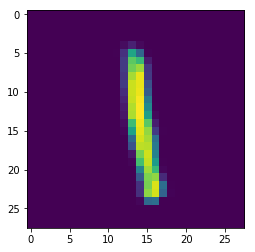

  0%|          | 0/214 [00:00<?, ?it/s]

epoch  19



  0%|          | 1/214 [00:02<09:28,  2.67s/it]

[7 3 0 5 7 3 7 2 9 0 7 8 9 3 0 4 1 9 6 8 8 6 6 3 6 5 3 0 5 5 8 4 7 6 0 9 3
 4 0 3 3 3 1 6 5 9 2 4 0 3 1 9 8 1 2 9 9 9 6 0 4 1 3 2 6 6 6 5 0 5 8 1 9 0
 7 0 8 6 6 9 0 8 7 1 0 6 8 0 4 5 5 1 9 1 1 9 7 6 8 4 4 0 1 4 4 7 7 7 5 4 5
 2 1 1 1 1 2 5 1 4 8 9 5 0 0 2 3 1 3 0 1 3 3 3 0 9 8 3 8 8 1 0 3 3 7 6 1 0
 3 8 5 3 2 4 7 6 3 6 9 5 3 2 7 4 6 9 9 3 3 9 5 9 0 9 9 5 8 8 8 1 1 7 7 1 3
 5 6 7 1 1 3 5 4 7 3 6 6 2 8 8 4 3 2 2 3 9 6 6 0 5 0 3 2 9 1 1 2 5 7 6 6 8
 4 1 2 1 5 4 9 2 0 7 3 0 2 7 4 8 2 7 2 5 9 1 4 8 4 2 9 4 2 2 7 2 9 3]
[7 3 0 5 7 3 7 2 9 0 7 8 9 3 0 4 1 9 6 8 8 6 6 3 6 5 3 0 5 5 8 4 7 6 0 9 3
 4 0 3 3 3 1 6 5 9 2 4 0 3 1 9 8 1 2 9 9 9 6 0 4 1 3 2 6 6 6 5 0 5 8 1 9 0
 7 0 8 6 6 9 0 8 7 1 0 6 8 0 4 5 5 1 9 1 1 9 7 6 8 4 4 0 1 4 4 7 7 7 5 4 5
 2 1 1 1 1 2 5 1 4 8 9 5 0 0 2 3 1 3 0 1 3 3 3 0 9 8 3 8 8 1 0 3 3 7 6 1 0
 3 8 5 3 2 4 7 6 3 6 9 5 3 2 7 4 6 9 9 3 3 9 5 9 0 9 9 5 8 8 8 1 1 7 7 1 3
 5 6 7 1 1 3 5 4 7 3 6 6 2 8 8 4 3 2 2 3 9 6 6 0 5 0 3 2 9 1 1 2 5 7 6 6 8
 4 1 2 1 5 4 9 2 0 7 3 0 2 7 4


  1%|          | 2/214 [00:05<09:26,  2.67s/it]

[6 3 1 6 4 1 2 2 1 3 3 5 5 7 4 5 8 9 7 9 4 4 3 8 6 0 5 1 3 1 9 3 2 8 6 0 6
 1 9 3 6 4 0 2 6 4 0 8 2 7 6 5 3 1 7 1 8 6 6 4 6 9 8 2 2 2 2 4 3 7 2 9 3 7
 2 7 2 7 1 6 5 0 1 3 5 4 5 0 7 9 4 8 3 2 2 5 5 7 9 3 5 5 5 9 3 8 4 2 8 4 0
 6 1 3 6 6 9 3 2 6 7 1 4 9 1 0 1 5 1 4 1 8 8 5 2 5 9 1 5 4 1 0 1 1 4 0 8 9
 9 3 0 1 6 3 7 0 9 4 1 6 0 9 0 3 6 2 0 7 9 6 9 7 6 1 0 0 3 3 6 4 1 5 2 3 0
 0 7 8 2 2 9 6 6 8 5 0 1 7 4 9 7 9 7 3 6 2 4 2 2 4 1 2 9 0 1 0 3 8 0 4 2 6
 9 8 1 5 7 3 5 3 1 6 7 0 5 9 7 1 3 6 2 2 5 9 7 9 2 6 8 9 0 5 2 8 0 2]
[6 3 1 6 4 1 2 2 1 3 3 5 5 7 4 5 8 9 7 9 4 4 3 8 6 0 5 1 3 1 9 3 2 8 6 0 6
 1 9 3 6 4 0 2 6 4 0 8 2 7 6 5 3 1 7 1 8 6 6 4 6 9 8 2 2 2 2 4 3 7 2 9 3 7
 2 7 2 7 1 6 5 0 1 3 5 4 5 0 7 9 4 8 3 2 2 5 5 7 9 3 5 5 5 9 3 8 4 2 8 4 0
 6 1 3 6 6 9 3 2 6 7 1 4 9 1 0 1 5 1 4 1 8 8 5 2 5 9 1 5 4 1 0 1 1 4 0 8 9
 9 3 0 1 6 3 7 0 9 4 1 6 0 9 0 3 6 2 0 7 9 6 9 7 6 1 0 0 3 3 6 4 1 5 2 3 0
 0 7 8 2 2 9 6 6 8 5 0 1 7 4 9 7 9 7 3 6 2 4 2 2 4 1 2 9 0 1 0 3 8 0 4 2 6
 9 8 1 5 7 3 5 3 1 6 7 0 5 9 7


  1%|▏         | 3/214 [00:08<09:27,  2.69s/it]

[9 5 6 1 4 2 3 8 2 9 7 3 7 8 0 0 1 1 6 3 3 4 2 0 1 8 7 2 9 4 7 2 3 2 1 7 4
 4 7 2 7 7 5 0 7 5 6 1 5 7 9 4 1 0 4 3 3 4 7 1 4 4 8 8 6 0 1 0 1 0 5 7 5 8
 2 4 6 5 6 5 4 3 5 7 9 0 8 5 0 9 6 3 3 7 7 1 9 7 1 2 7 9 1 9 4 9 1 4 8 9 3
 6 4 5 3 9 5 4 4 2 7 3 9 1 4 9 4 5 5 6 5 2 1 2 8 6 9 9 1 7 0 3 8 9 6 1 7 2
 9 1 3 5 9 5 9 0 3 3 9 3 5 4 5 3 4 3 9 1 3 9 7 4 5 8 5 1 2 2 1 2 1 0 2 6 0
 1 0 2 6 2 2 3 3 1 4 6 4 2 1 9 1 6 3 8 3 8 7 7 8 1 8 5 5 2 9 3 6 5 2 8 8 0
 9 9 1 4 9 7 2 4 8 7 4 4 2 2 3 4 1 1 8 0 3 6 1 7 1 2 1 9 8 0 1 3 2 8]
[9 5 6 1 4 2 3 8 2 9 7 3 7 8 0 0 1 1 6 3 3 4 2 0 1 8 7 2 9 4 7 2 3 2 1 7 4
 4 7 2 7 7 5 0 7 5 6 1 5 7 9 4 1 0 4 3 3 4 7 1 4 4 8 8 6 0 1 0 1 0 5 7 5 8
 2 4 6 5 6 5 4 3 5 7 9 0 8 5 0 9 6 3 3 7 7 1 9 7 1 2 7 9 1 9 4 9 1 4 8 9 3
 6 4 5 3 9 5 4 4 2 7 3 9 1 4 9 4 5 5 6 5 2 1 2 8 6 9 9 1 7 0 3 8 9 6 1 7 2
 9 1 3 5 9 5 9 0 3 3 9 3 5 4 5 3 4 3 9 1 3 9 7 4 5 8 5 1 2 2 1 2 1 0 2 6 0
 1 0 2 6 2 2 3 3 1 4 6 4 2 1 9 1 6 3 8 3 8 7 7 8 1 8 5 5 2 9 3 6 5 2 8 8 0
 9 9 1 4 9 7 2 4 8 7 4 4 2 2 3


  2%|▏         | 4/214 [00:10<09:24,  2.69s/it]

[4 6 0 1 4 4 1 6 4 7 2 2 5 6 3 9 8 4 2 3 4 6 8 1 4 9 0 3 7 9 2 4 5 4 1 5 8
 4 4 9 9 4 0 3 5 2 7 1 3 1 7 3 4 9 6 1 6 6 5 4 0 1 7 2 8 0 5 1 9 7 3 4 1 6
 3 0 9 1 8 8 1 8 4 4 9 9 9 3 7 1 2 4 4 5 2 4 5 0 9 6 7 1 4 8 2 4 9 2 5 9 1
 2 0 7 9 1 1 0 7 2 0 3 5 3 0 4 2 8 1 4 9 3 2 6 7 0 2 1 2 0 4 3 4 8 3 6 7 2
 4 1 2 1 7 1 9 5 1 0 5 9 1 7 7 5 9 6 5 9 8 2 8 6 7 5 7 5 5 2 1 5 3 0 9 5 7
 3 9 7 1 0 6 1 9 9 1 6 6 9 7 2 3 6 2 9 0 8 7 9 2 5 9 1 3 8 4 6 4 5 7 3 4 4
 1 8 5 9 0 1 2 8 3 0 6 7 1 5 7 3 8 4 5 3 6 8 6 0 1 2 7 8 0 8 1 0 4 5]
[4 6 0 1 4 4 1 6 4 7 2 2 5 6 3 9 8 4 2 3 4 6 8 1 4 9 0 3 7 9 2 4 5 4 1 5 8
 4 4 9 9 4 0 3 5 2 7 1 3 1 7 3 4 9 6 1 6 6 5 4 0 1 7 2 8 0 5 1 9 7 3 4 1 6
 3 0 9 1 8 8 1 8 4 4 9 9 9 3 7 1 2 4 4 5 2 4 5 0 9 6 7 1 4 8 2 4 9 2 5 9 1
 2 0 7 9 1 1 0 7 2 0 3 5 3 0 4 2 8 1 4 9 3 2 6 7 0 2 1 2 0 4 3 4 8 3 6 7 2
 4 1 2 1 7 1 9 5 1 0 5 9 1 7 7 5 9 6 5 9 8 2 8 6 7 5 7 5 5 2 1 5 3 0 9 5 7
 3 9 7 1 0 6 1 9 9 1 6 6 9 7 2 3 6 2 9 0 8 7 9 2 5 9 1 3 8 4 6 4 5 7 3 4 4
 1 8 5 9 0 1 2 8 3 0 6 7 1 5 7


  2%|▏         | 5/214 [00:13<09:19,  2.67s/it]

[3 9 3 8 0 7 8 4 2 9 3 1 9 3 1 4 1 5 1 2 8 0 0 1 3 6 8 0 3 1 8 8 3 5 2 7 7
 3 8 1 0 3 8 7 2 6 2 6 5 1 7 7 3 5 1 1 9 4 9 5 6 5 8 4 4 8 6 1 6 9 0 3 3 6
 3 6 6 1 0 6 6 3 8 9 6 2 4 7 1 4 5 0 1 5 9 0 3 5 7 2 3 5 9 0 3 0 0 7 8 0 6
 8 3 4 7 6 8 8 3 1 8 6 1 5 0 1 1 2 9 9 8 8 2 3 7 0 4 5 2 8 6 0 4 5 9 9 5 5
 8 5 0 6 4 9 2 7 6 7 4 4 4 9 1 9 5 2 6 2 6 5 0 0 9 9 7 2 0 0 4 0 5 2 4 7 0
 1 8 2 7 7 3 4 3 1 0 5 6 6 4 4 0 0 6 6 6 8 6 9 3 0 2 8 7 8 9 7 6 9 4 0 8 7
 9 6 7 4 7 6 3 8 2 5 9 1 4 9 3 0 4 1 4 1 4 0 8 3 1 0 7 8 1 3 2 5 0 4]
[3 9 3 8 0 7 8 4 2 9 3 1 9 3 1 4 1 5 1 2 8 0 0 1 3 6 8 0 3 1 8 8 3 5 2 7 7
 3 8 1 0 3 8 7 2 6 2 6 5 1 7 7 3 5 1 1 9 4 9 5 6 5 8 4 4 8 6 1 6 9 0 3 3 6
 3 6 6 1 0 6 6 3 8 9 6 2 4 7 1 4 5 0 1 5 9 0 3 5 7 2 3 5 9 0 3 0 0 7 8 0 6
 8 3 4 7 6 8 8 3 1 8 6 1 5 0 1 1 2 9 9 8 8 2 3 7 0 4 5 2 8 6 0 4 5 9 9 5 5
 8 5 0 6 4 9 2 7 6 7 4 4 4 9 1 9 5 2 6 2 6 5 0 0 9 9 7 2 0 0 4 0 5 2 4 7 0
 1 8 2 7 7 3 4 3 1 0 5 6 6 4 4 0 0 6 6 6 8 6 9 3 0 2 8 7 8 9 7 6 9 4 0 8 7
 9 6 7 4 7 6 3 8 2 5 9 1 4 9 3


  3%|▎         | 6/214 [00:16<09:16,  2.68s/it]

[3 5 4 4 5 4 8 4 5 9 9 3 4 0 4 6 0 1 0 8 6 8 7 0 5 7 3 8 6 5 1 3 4 9 1 3 1
 6 2 4 4 3 6 2 3 5 0 0 5 6 0 0 0 3 5 1 7 1 0 5 5 1 2 6 3 2 8 8 2 5 2 3 3 6
 2 5 7 2 9 9 7 0 8 1 7 9 9 8 7 1 8 2 9 4 6 6 4 2 2 7 1 9 6 6 9 2 9 6 8 4 1
 8 4 4 4 5 3 4 1 6 0 9 6 9 1 7 7 6 5 5 7 0 0 5 7 9 7 7 5 2 0 5 7 3 5 5 5 1
 1 6 8 9 2 1 4 0 7 8 2 0 0 6 4 1 5 7 4 0 6 9 0 1 5 6 0 2 8 7 2 7 9 7 3 8 2
 3 7 1 7 2 7 4 3 3 1 8 8 8 6 0 5 3 2 0 4 8 7 8 6 7 2 8 2 2 2 0 9 0 0 5 3 9
 3 5 3 6 2 0 5 1 4 7 1 9 8 0 1 0 3 3 4 1 8 3 7 1 7 1 7 6 7 5 7 1 9 5]
[3 5 4 4 5 4 8 4 5 9 9 3 4 0 4 6 0 1 0 8 6 8 7 0 5 7 3 8 6 5 1 3 4 9 1 3 1
 6 2 4 4 3 6 2 3 5 0 0 5 6 0 0 0 3 5 1 7 1 0 5 5 1 2 6 3 2 8 8 2 5 2 3 3 6
 2 5 7 2 9 9 7 0 8 1 7 9 9 8 7 1 8 2 9 4 6 6 4 2 2 7 1 9 6 6 9 2 9 6 8 4 1
 8 4 4 4 5 3 4 1 6 0 9 6 9 1 7 7 6 5 5 7 0 0 5 7 9 7 7 5 2 0 5 7 3 5 5 5 1
 1 6 8 9 2 1 4 0 7 8 2 0 0 6 4 1 5 7 4 0 6 9 0 1 5 6 0 2 8 7 2 7 9 7 3 8 2
 3 7 1 7 2 7 4 3 3 1 8 8 8 6 0 5 3 2 0 4 8 7 8 6 7 2 8 2 2 2 0 9 0 0 5 3 9
 3 5 3 6 2 0 5 1 4 7 1 9 8 0 1


  3%|▎         | 7/214 [00:18<09:14,  2.68s/it]

[1 5 0 0 8 4 0 2 8 7 8 4 1 1 1 9 5 1 2 1 3 4 2 1 3 6 2 1 2 7 7 9 4 0 2 6 4
 8 3 6 8 0 7 0 4 1 6 9 5 3 8 5 3 1 0 4 7 3 9 4 8 5 1 9 6 0 7 7 6 3 8 6 9 7
 5 7 1 6 5 4 8 9 2 7 3 4 1 2 4 8 2 5 2 2 9 1 2 5 4 3 4 0 3 2 5 2 2 8 8 1 5
 5 7 9 1 6 9 1 9 6 9 6 8 5 8 3 9 9 5 0 6 0 6 4 6 0 0 1 1 9 8 0 4 8 4 6 8 0
 5 5 9 9 3 9 2 2 3 6 7 1 5 8 1 3 4 5 9 3 1 3 5 8 4 6 4 6 6 0 3 1 3 2 8 2 1
 1 6 3 7 8 8 8 4 8 0 9 0 8 3 9 3 6 2 2 6 3 8 3 1 9 8 1 7 0 9 4 8 0 2 5 2 3
 0 9 9 5 0 3 9 1 5 0 2 9 7 1 8 3 4 5 9 5 7 2 7 1 1 9 1 7 9 8 7 5 8 7]
[1 5 0 0 8 4 0 2 8 7 8 4 1 1 1 9 5 1 2 1 3 4 2 1 3 6 2 1 2 7 7 9 4 0 2 6 4
 8 3 6 8 0 7 0 4 1 6 9 5 3 8 5 3 1 0 4 7 3 9 4 8 5 1 9 6 0 7 7 6 3 8 6 9 7
 5 7 1 6 5 4 8 9 2 7 3 4 1 2 4 8 2 5 2 2 9 1 2 5 4 3 4 0 3 2 5 2 2 8 8 1 5
 5 7 9 1 6 9 1 9 6 9 6 8 5 8 3 9 9 5 0 6 0 6 4 6 0 0 1 1 9 8 0 4 8 4 6 8 0
 5 5 9 9 3 9 2 2 3 6 7 1 5 8 1 3 4 5 9 3 1 3 5 8 4 6 4 6 6 0 3 1 3 2 8 2 1
 1 6 3 7 8 8 8 4 8 0 9 0 8 3 9 3 6 2 2 6 3 8 3 1 9 8 1 7 0 9 4 8 0 2 5 2 3
 0 9 9 5 0 3 9 1 5 0 2 9 7 1 8


  4%|▎         | 8/214 [00:21<09:10,  2.67s/it]

[4 3 9 9 0 8 1 1 3 7 3 8 9 1 0 1 4 2 2 2 2 2 6 0 4 2 8 7 4 2 1 1 9 9 8 0 5
 7 2 4 1 1 1 3 8 4 4 5 7 9 8 0 7 4 2 8 9 5 9 7 1 4 2 2 2 1 2 1 6 9 9 1 3 1
 4 3 3 2 2 3 9 3 1 4 7 7 0 6 3 7 9 3 5 9 1 0 4 0 9 2 7 4 7 8 0 1 3 8 7 6 6
 7 9 2 4 1 6 2 8 9 4 2 0 5 8 5 0 7 5 6 0 4 2 8 8 9 7 3 9 7 5 3 0 1 6 1 1 9
 2 5 3 1 8 8 3 5 3 5 6 1 3 4 6 4 3 9 8 7 3 6 0 1 7 1 7 5 2 2 4 3 5 7 7 4 2
 6 3 5 9 7 7 1 9 2 8 7 4 5 1 0 4 2 4 8 3 5 0 9 2 5 9 0 8 1 3 4 5 2 6 3 0 9
 6 8 5 2 8 3 4 8 1 3 0 8 9 6 7 9 2 8 3 0 7 5 0 7 9 6 8 4 8 3 8 3 0 3]
[4 3 9 9 0 8 1 1 3 7 3 8 9 1 0 1 4 2 2 2 2 2 6 0 4 2 8 7 4 2 1 1 9 9 8 0 5
 7 2 4 1 1 1 3 8 4 4 5 7 9 8 0 7 4 2 8 9 5 9 7 1 4 2 2 2 1 2 1 6 9 9 1 3 1
 4 3 3 2 2 3 9 3 1 4 7 7 0 6 3 7 9 3 5 9 1 0 4 0 9 2 7 4 7 8 0 1 3 8 7 6 6
 7 9 2 4 1 6 2 8 9 4 2 0 5 8 5 0 7 5 6 0 4 2 8 8 9 7 3 9 7 5 3 0 1 6 1 1 9
 2 5 3 1 8 8 3 5 3 5 6 1 3 4 6 4 3 9 8 7 3 6 0 1 7 1 7 5 2 2 4 3 5 7 7 4 2
 6 3 5 9 7 7 1 9 2 8 7 4 5 1 0 4 2 4 8 3 5 0 9 2 5 9 0 8 1 3 4 5 2 6 3 0 9
 6 8 5 2 8 3 4 8 1 3 0 8 9 6 7


  4%|▍         | 9/214 [00:24<09:06,  2.67s/it]

[2 5 2 8 6 9 1 6 7 4 1 8 8 0 1 9 5 3 8 0 2 5 8 9 4 5 0 2 4 0 1 3 2 8 3 3 3
 2 8 4 9 5 6 9 8 3 3 2 9 7 0 3 4 0 0 9 5 8 8 4 8 1 4 4 3 4 7 9 9 6 1 0 4 3
 3 9 2 6 4 5 8 5 7 8 1 8 6 1 8 8 2 7 9 7 1 9 1 0 7 0 3 3 3 3 0 8 8 9 3 1 3
 1 9 1 4 4 3 5 4 3 7 8 1 3 0 6 8 1 2 8 1 6 8 3 2 9 1 2 0 5 4 8 6 2 8 2 2 4
 0 1 1 6 2 7 8 9 6 5 5 6 2 5 2 4 4 6 6 7 0 5 4 4 8 3 0 1 8 1 4 3 9 5 8 0 1
 1 0 2 8 1 1 5 2 9 5 5 6 6 9 1 5 3 7 1 0 6 1 1 1 8 6 4 9 2 1 4 3 9 9 5 5 9
 6 3 4 5 0 1 0 8 9 1 3 9 7 3 8 8 4 1 4 9 0 4 9 4 5 3 0 6 7 8 6 0 2 2]
[2 5 2 8 6 9 1 6 7 4 1 8 8 0 1 9 5 3 8 0 2 5 8 9 4 5 0 2 4 0 1 3 2 8 3 3 3
 2 8 4 9 5 6 9 8 3 3 2 9 7 0 3 4 0 0 9 5 8 8 4 8 1 4 4 3 4 7 9 9 6 1 0 4 3
 3 9 2 6 4 5 8 5 7 8 1 8 6 1 8 8 2 7 9 7 1 9 1 0 7 0 3 3 3 3 0 8 8 9 3 1 3
 1 9 1 4 4 3 5 4 3 7 8 1 3 0 6 8 1 2 8 1 6 8 3 2 9 1 2 0 5 4 8 6 2 8 2 2 4
 0 1 1 6 2 7 8 9 6 5 5 6 2 5 2 4 4 6 6 7 0 5 4 4 8 3 0 1 8 1 4 3 9 5 8 0 1
 1 0 2 8 1 1 5 2 9 5 5 6 6 9 1 5 3 7 1 0 6 1 1 1 8 6 4 9 2 1 4 3 9 9 5 5 9
 6 3 4 5 0 1 0 8 9 1 3 9 7 3 8


  5%|▍         | 10/214 [00:26<09:04,  2.67s/it]

[2 3 2 5 3 9 5 7 1 8 7 0 2 0 0 5 3 9 6 5 0 2 7 6 8 1 2 7 1 8 4 0 9 7 0 4 5
 3 8 7 3 6 1 8 1 7 9 7 3 7 3 0 7 1 7 5 2 2 2 2 5 2 2 2 4 0 7 0 3 6 4 9 3 4
 8 2 0 7 5 8 1 3 4 6 7 3 6 9 1 9 8 9 7 6 5 3 5 6 6 2 7 8 1 4 5 0 2 4 6 5 1
 1 6 5 8 7 4 0 2 4 1 4 5 3 2 9 3 7 0 3 6 7 9 9 9 1 3 4 0 8 7 9 6 7 3 1 3 1
 2 7 4 8 7 9 8 2 4 1 9 9 7 8 2 6 9 1 5 2 6 3 6 8 4 7 6 1 5 3 0 2 7 9 6 2 5
 0 4 7 1 0 1 8 9 4 1 4 7 0 3 1 9 3 7 8 1 2 5 2 7 1 7 6 4 2 6 4 8 2 3 3 6 5
 8 0 7 7 1 9 1 5 1 8 0 7 1 8 8 8 2 9 8 7 6 6 8 6 4 8 2 2 8 3 9 0 3 2]
[2 3 2 5 3 9 5 7 1 8 7 0 2 0 0 5 3 9 6 5 0 2 7 6 8 1 2 7 1 8 4 0 9 7 0 4 5
 3 8 7 3 6 1 8 1 7 9 7 3 7 3 0 7 1 7 5 2 2 2 2 5 2 2 2 4 0 7 0 3 6 4 9 3 4
 8 2 0 7 5 8 1 3 4 6 7 3 6 9 1 9 8 9 7 6 5 3 5 6 6 2 7 8 1 4 5 0 2 4 6 5 1
 1 6 5 8 7 4 0 2 4 1 4 5 3 2 9 3 7 0 3 6 7 9 9 9 1 3 4 0 8 7 9 6 7 3 1 3 1
 2 7 4 8 7 9 8 2 4 1 9 9 7 8 2 6 9 1 5 2 6 3 6 8 4 7 6 1 5 3 0 2 7 9 6 2 5
 0 4 7 1 0 1 8 9 4 1 4 7 0 3 1 9 3 7 8 1 2 5 2 7 1 7 6 4 2 6 4 8 2 3 3 6 5
 8 0 7 7 1 9 1 5 1 8 0 7 1 8 8


  5%|▌         | 11/214 [00:29<09:02,  2.67s/it]

[1 8 5 2 6 9 4 1 0 1 7 7 1 5 1 5 1 6 1 7 1 6 7 1 5 1 4 4 8 6 1 9 9 8 9 8 7
 0 7 3 9 2 9 5 7 0 3 6 7 1 6 7 1 6 2 5 3 0 4 3 4 6 3 1 8 6 6 9 6 3 0 8 1 6
 8 4 5 2 2 2 0 3 7 5 6 6 5 7 3 7 4 1 2 4 5 2 7 7 3 3 5 5 5 5 6 2 0 5 2 5 3
 5 6 1 3 7 0 2 3 1 9 8 8 9 9 5 8 9 7 1 4 7 4 6 9 1 8 1 2 0 7 6 9 9 2 5 7 7
 5 2 7 1 1 5 2 7 7 7 1 9 3 9 7 0 3 1 3 7 8 2 5 8 6 3 2 2 1 6 1 4 6 9 9 7 7
 4 7 2 1 7 0 7 7 9 9 5 7 8 2 0 0 3 4 2 7 5 6 6 6 1 2 8 9 2 2 5 7 7 9 2 1 2
 3 8 2 5 6 0 8 8 7 5 9 0 0 9 8 1 4 1 4 2 5 2 6 4 4 5 0 3 0 9 1 9 0 3]
[1 8 5 2 6 9 4 1 0 1 7 7 1 5 1 5 1 6 1 7 1 6 7 1 5 1 4 4 8 6 1 9 9 8 9 8 7
 0 7 3 9 2 9 5 7 0 3 6 7 1 6 7 1 6 2 5 3 0 4 3 4 6 3 1 8 6 6 9 6 3 0 8 1 6
 8 4 5 2 2 2 0 3 7 5 6 6 5 7 3 7 4 1 2 4 5 2 7 7 3 3 5 5 5 5 6 2 0 5 2 5 3
 5 6 1 3 7 0 2 3 1 9 8 8 9 9 5 8 9 7 1 4 7 4 6 9 1 8 1 2 0 7 6 9 9 2 5 7 7
 5 2 7 1 1 5 2 7 7 7 1 9 3 9 7 0 3 1 3 7 8 2 5 8 6 3 2 2 1 6 1 4 6 9 9 7 7
 4 7 2 1 7 0 7 7 9 9 5 7 8 2 0 0 3 4 2 7 5 6 6 6 1 2 8 9 2 2 5 7 7 9 2 1 2
 3 8 2 5 6 0 8 8 7 5 9 0 0 9 8


  6%|▌         | 12/214 [00:32<08:59,  2.67s/it]

[6 9 0 5 1 1 5 3 0 2 7 2 3 3 6 9 2 2 8 8 0 3 1 8 5 7 5 0 8 7 3 1 8 5 6 1 1
 4 4 1 7 5 5 7 8 8 6 3 7 3 7 9 5 1 4 1 0 9 8 8 6 6 3 6 4 3 5 4 1 7 5 6 2 6
 9 5 7 8 4 1 8 1 4 2 3 1 2 1 0 2 2 7 7 3 0 0 2 1 3 0 3 1 2 5 6 7 6 2 7 4 7
 5 8 3 3 3 8 9 9 6 9 6 5 9 4 4 4 9 4 8 3 4 4 5 8 9 7 0 7 3 2 4 9 7 4 6 1 1
 6 4 3 5 5 1 7 1 9 1 6 6 2 5 7 5 6 7 4 7 1 6 6 2 0 5 1 9 3 7 7 9 2 2 8 7 6
 8 1 4 7 9 7 5 9 4 1 9 0 4 7 9 9 0 4 0 6 1 6 9 9 1 2 2 8 6 8 1 0 5 9 1 3 0
 7 4 2 9 2 3 1 8 0 8 6 0 2 0 2 3 8 8 6 1 0 7 7 4 8 0 0 5 7 7 8 1 7 2]
[6 9 0 5 1 1 5 3 0 2 7 2 3 3 6 9 2 2 8 8 0 3 1 8 5 7 5 0 8 7 3 1 8 5 6 1 1
 4 4 1 7 5 5 7 8 8 6 3 7 3 7 9 5 1 4 1 0 9 8 8 6 6 3 6 4 3 5 4 1 7 5 6 2 6
 9 5 7 8 4 1 8 1 4 2 3 1 2 1 0 2 2 7 7 3 0 0 2 1 3 0 3 1 2 5 6 7 6 2 7 4 7
 5 8 3 3 3 8 9 9 6 9 6 5 9 4 4 4 9 4 8 3 4 4 5 8 9 7 0 7 3 2 4 9 7 4 6 1 1
 6 4 3 5 5 1 7 1 9 1 6 6 2 5 7 5 6 7 4 7 1 6 6 2 0 5 1 9 3 7 7 9 2 2 8 7 6
 8 1 4 7 9 7 5 9 4 1 9 0 4 7 9 9 0 4 0 6 1 6 9 9 1 2 2 8 6 8 1 0 5 9 1 3 0
 7 4 2 9 2 3 1 8 0 8 6 0 2 0 2


  6%|▌         | 13/214 [00:34<08:57,  2.68s/it]

[8 5 1 0 7 7 1 2 2 4 1 1 0 7 0 7 8 2 6 0 9 1 6 6 7 6 2 4 1 8 2 3 5 2 8 6 5
 0 5 4 9 9 1 5 8 7 0 0 8 2 0 5 5 0 4 4 0 9 1 2 6 8 2 3 3 5 1 8 7 0 2 8 5 3
 9 4 0 4 0 0 8 2 3 7 8 4 0 9 2 1 6 2 3 7 1 6 9 7 1 4 1 4 0 9 6 5 0 4 9 2 2
 1 4 1 3 2 6 9 4 1 3 7 5 4 0 3 0 0 0 1 2 9 4 0 8 3 3 1 8 2 3 9 6 3 2 1 6 3
 6 8 0 6 7 1 4 3 8 9 9 8 1 9 7 1 6 9 9 9 7 3 5 8 2 0 8 1 6 2 1 3 6 2 1 7 6
 4 5 2 2 2 4 5 1 5 4 3 9 4 8 2 3 7 3 9 6 4 7 6 4 4 9 9 3 7 1 7 3 0 2 1 4 0
 0 5 4 1 4 2 0 2 0 9 6 0 9 9 5 6 1 6 9 8 7 7 4 7 2 4 6 5 8 9 2 0 9 0]
[8 5 1 0 7 7 1 2 2 4 1 1 0 7 0 7 8 2 6 0 9 1 6 6 7 6 2 4 1 8 2 3 5 2 8 6 5
 0 5 4 9 9 1 5 8 7 0 0 8 2 0 5 5 0 4 4 0 9 1 2 6 8 2 3 3 5 1 8 7 0 2 8 5 3
 9 4 0 4 0 0 8 2 3 7 8 4 0 9 2 1 6 2 3 7 1 6 9 7 1 4 1 4 0 9 6 5 0 4 9 2 2
 1 4 1 3 2 6 9 4 1 3 7 5 4 0 3 0 0 0 1 2 9 4 0 8 3 3 1 8 2 3 9 6 3 2 1 6 3
 6 8 0 6 7 1 4 3 8 9 9 8 1 9 7 1 6 9 9 9 7 3 5 8 2 0 8 1 6 2 1 3 6 2 1 7 6
 4 5 2 2 2 4 5 1 5 4 3 9 4 8 2 3 7 3 9 6 4 7 6 4 4 9 9 3 7 1 7 3 0 2 1 4 0
 0 5 4 1 4 2 0 2 0 9 6 0 9 9 5


  7%|▋         | 14/214 [00:37<08:52,  2.66s/it]

[7 6 8 9 3 4 6 3 1 0 9 2 1 0 9 7 0 1 7 0 8 2 3 3 3 8 5 3 2 2 9 9 7 0 4 0 8
 3 8 6 1 9 0 2 7 8 0 8 9 7 1 2 7 3 9 3 0 8 2 5 8 2 0 2 0 9 4 6 7 9 5 2 1 1
 6 0 0 3 5 0 3 6 2 3 3 3 8 9 1 8 2 6 1 2 4 6 7 5 3 4 1 8 9 3 2 7 6 7 2 6 3
 7 3 0 0 7 7 3 5 5 5 7 7 6 4 0 8 1 9 1 2 0 0 3 4 0 8 0 3 5 3 6 9 1 4 7 1 3
 6 5 6 2 2 2 0 0 0 6 7 8 7 8 7 0 7 1 7 7 2 3 0 1 6 7 7 9 8 4 8 3 6 4 7 8 5
 3 8 3 9 0 1 3 1 7 7 9 1 1 6 4 9 3 9 6 8 6 8 7 9 0 0 9 9 2 6 9 6 4 8 0 7 2
 0 8 6 5 7 8 3 9 1 5 0 0 9 9 1 8 1 1 0 1 7 5 0 3 4 2 9 2 6 9 1 0 2 5]
[7 6 8 9 3 4 6 3 1 0 9 2 1 0 9 7 0 1 7 0 8 2 3 3 3 8 5 3 2 2 9 9 7 0 4 0 8
 3 8 6 1 9 0 2 7 8 0 8 9 7 1 2 7 3 9 3 0 8 2 5 8 2 0 2 0 9 4 6 7 9 5 2 1 1
 6 0 0 3 5 0 3 6 2 3 3 3 8 9 1 8 2 6 1 2 4 6 7 5 3 4 1 8 9 3 2 7 6 7 2 6 3
 7 3 0 0 7 7 3 5 5 5 7 7 6 4 0 8 1 9 1 2 0 0 3 4 0 8 0 3 5 3 6 9 1 4 7 1 3
 6 5 6 2 2 2 0 0 0 6 7 8 7 8 7 0 7 1 7 7 2 3 0 1 6 7 7 9 8 4 8 3 6 4 7 8 5
 3 8 3 9 0 1 3 1 7 7 9 1 1 6 4 9 3 9 6 8 6 8 7 9 0 0 9 9 2 6 9 6 4 8 0 7 2
 0 8 6 5 7 8 3 9 1 5 0 0 9 9 1


  7%|▋         | 15/214 [00:39<08:44,  2.63s/it]

[1 8 3 3 6 1 6 0 2 4 4 6 7 3 8 9 1 8 4 5 2 0 1 1 1 9 6 2 3 3 7 4 6 5 8 5 2
 6 5 2 8 8 6 8 3 3 9 6 0 3 1 3 0 3 7 0 1 1 7 4 6 6 0 7 5 7 0 1 7 9 2 2 7 3
 6 4 5 4 6 9 1 0 6 5 7 4 4 0 4 0 6 0 8 5 9 1 0 3 1 2 8 7 3 9 2 9 7 0 0 0 9
 6 0 5 2 9 8 2 5 1 4 0 0 1 1 2 3 2 2 3 4 4 1 7 5 4 7 6 9 0 9 0 2 7 8 2 9 0
 8 3 6 3 0 4 4 9 0 1 7 2 0 1 6 4 4 7 1 2 6 6 5 6 7 3 2 7 8 5 1 3 9 6 1 5 7
 5 8 1 4 3 9 8 6 8 5 6 7 0 5 0 9 7 6 0 7 6 5 5 1 0 5 0 3 6 8 2 3 0 8 4 1 7
 0 0 5 3 3 5 0 9 9 8 6 5 8 6 6 3 9 6 0 3 4 3 7 9 7 3 4 2 7 1 5 7 9 1]
[1 8 3 3 6 1 6 0 2 4 4 6 7 3 8 9 1 8 4 5 2 0 1 1 1 9 6 2 3 3 7 4 6 5 8 5 2
 6 5 2 8 8 6 8 3 3 9 6 0 3 1 3 0 3 7 0 1 1 7 4 6 6 0 7 5 7 0 1 7 9 2 2 7 3
 6 4 5 4 6 9 1 0 6 5 7 4 4 0 4 0 6 0 8 5 9 1 0 3 1 2 8 7 3 9 2 9 7 0 0 0 9
 6 0 5 2 9 8 2 5 1 4 0 0 1 1 2 3 2 2 3 4 4 1 7 5 4 7 6 9 0 9 0 2 7 8 2 9 0
 8 3 6 3 0 4 4 9 0 1 7 2 0 1 6 4 4 7 1 2 6 6 5 6 7 3 2 7 8 5 1 3 9 6 1 5 7
 5 8 1 4 3 9 8 6 8 5 6 7 0 5 0 9 7 6 0 7 6 5 5 1 0 5 0 3 6 8 2 3 0 8 4 1 7
 0 0 5 3 3 5 0 9 9 8 6 5 8 6 6


  7%|▋         | 16/214 [00:41<08:36,  2.61s/it]

[5 3 1 8 1 3 7 6 1 8 7 6 7 8 5 9 4 5 0 2 9 8 6 3 0 5 6 3 5 0 2 4 9 0 5 2 2
 0 9 6 2 6 1 8 1 7 2 1 6 1 0 0 6 9 7 4 5 3 8 3 1 3 8 3 8 5 8 1 9 8 6 6 4 5
 7 8 6 1 8 5 6 4 1 4 8 7 3 0 7 5 2 5 5 6 8 9 7 9 1 2 8 5 5 5 3 3 1 7 0 0 9
 9 7 9 3 5 0 7 1 3 2 7 2 1 3 9 6 1 7 0 9 6 7 1 2 3 7 8 2 5 1 3 0 5 8 1 4 6
 3 3 8 2 8 8 8 6 1 4 1 7 3 2 0 4 1 9 8 7 5 5 6 2 4 8 3 0 1 8 6 0 0 9 2 0 4
 4 3 5 3 7 5 4 4 9 1 0 8 8 1 6 6 2 6 5 8 5 4 7 3 2 7 2 4 9 0 2 9 5 0 3 2 7
 8 6 6 3 5 0 3 7 4 2 9 9 6 7 6 0 0 2 2 1 8 1 9 6 4 5 9 8 9 6 3 0 8 7]
[5 3 1 8 1 3 7 6 1 8 7 6 7 8 5 9 4 5 0 2 9 8 6 3 0 5 6 3 5 0 2 4 9 0 5 2 2
 0 9 6 2 6 1 8 1 7 2 1 6 1 0 0 6 9 7 4 5 3 8 3 1 3 8 3 8 5 8 1 9 8 6 6 4 5
 7 8 6 1 8 5 6 4 1 4 8 7 3 0 7 5 2 5 5 6 8 9 7 9 1 2 8 5 5 5 3 3 1 7 0 0 9
 9 7 9 3 5 0 7 1 3 2 7 2 1 3 9 6 1 7 0 9 6 7 1 2 3 7 8 2 5 1 3 0 5 8 1 4 6
 3 3 8 2 8 8 8 6 1 4 1 7 3 2 0 4 1 9 8 7 5 5 6 2 4 8 3 0 1 8 6 0 0 9 2 0 4
 4 3 5 3 7 5 4 4 9 1 0 8 8 1 6 6 2 6 5 8 5 4 7 3 2 7 2 4 9 0 2 9 5 0 3 2 7
 8 6 6 3 5 0 3 7 4 2 9 9 6 7 6


  8%|▊         | 17/214 [00:43<08:29,  2.59s/it]

[5 4 0 3 0 0 1 1 8 7 0 8 9 0 1 7 4 3 2 8 0 3 4 7 1 6 5 1 3 2 3 5 1 9 3 8 1
 7 1 4 8 1 2 3 0 3 2 2 2 9 1 8 6 9 1 0 0 2 2 0 0 5 1 7 0 8 8 4 6 9 4 2 1 1
 6 0 0 9 7 3 5 5 0 9 4 2 0 1 6 3 2 5 2 4 6 0 3 4 6 1 0 1 0 8 5 5 4 4 1 3 7
 3 8 9 4 0 7 9 5 2 5 7 7 7 9 6 9 3 1 7 9 1 9 5 5 1 3 7 1 4 5 6 3 4 0 1 5 2
 2 2 3 5 0 7 3 1 9 0 3 9 7 2 0 2 8 2 1 2 4 3 3 7 8 1 8 2 9 6 4 0 5 3 5 2 8
 2 5 3 3 6 8 4 4 9 5 6 6 2 8 8 0 1 4 7 8 6 8 6 2 4 7 1 5 7 9 6 0 4 0 9 8 7
 4 3 8 3 3 7 6 7 7 7 6 8 1 3 3 1 3 7 8 1 7 0 6 4 3 0 4 5 2 7 3 6 4 7]
[5 4 0 3 0 0 1 1 8 7 0 8 9 0 1 7 4 3 2 8 0 3 4 7 1 6 5 1 3 2 3 5 1 9 3 8 1
 7 1 4 8 1 2 3 0 3 2 2 2 9 1 8 6 9 1 0 0 2 2 0 0 5 1 7 0 8 8 4 6 9 4 2 1 1
 6 0 0 9 7 3 5 5 0 9 4 2 0 1 6 3 2 5 2 4 6 0 3 4 6 1 0 1 0 8 5 5 4 4 1 3 7
 3 8 9 4 0 7 9 5 2 5 7 7 7 9 6 9 3 1 7 9 1 9 5 5 1 3 7 1 4 5 6 3 4 0 1 5 2
 2 2 3 5 0 7 3 1 9 0 3 9 7 2 0 2 8 2 1 2 4 3 3 7 8 1 8 2 9 6 4 0 5 3 5 2 8
 2 5 3 3 6 8 4 4 9 5 6 6 2 8 8 0 1 4 7 8 6 8 6 2 4 7 1 5 7 9 6 0 4 0 9 8 7
 4 3 8 3 3 7 6 7 7 7 6 8 1 3 3


  8%|▊         | 18/214 [00:46<08:23,  2.57s/it]

[3 5 3 7 4 7 0 5 2 7 0 7 2 2 9 7 0 6 1 1 3 5 7 7 3 4 2 6 3 5 6 6 6 3 7 4 7
 7 1 9 2 3 7 6 9 0 9 8 3 7 7 7 1 9 8 6 3 2 9 2 3 9 9 1 9 4 0 1 4 8 2 9 5 9
 8 3 5 9 1 4 1 7 7 5 0 6 7 5 3 5 4 0 8 4 0 0 0 2 5 4 8 2 9 2 1 6 8 3 1 6 7
 2 9 0 0 4 3 6 1 0 0 6 8 0 0 9 8 9 3 0 3 9 2 5 3 4 0 2 4 3 2 7 3 1 8 5 3 6
 8 8 0 1 9 6 4 5 5 6 9 4 2 5 6 6 0 1 2 3 5 2 6 6 9 3 1 0 9 2 0 4 8 5 5 8 4
 4 8 9 1 1 2 4 6 4 0 9 4 0 9 8 3 0 7 0 2 5 4 3 1 2 4 5 7 6 4 0 3 9 8 1 1 0
 3 0 0 3 3 1 9 9 0 2 6 1 0 4 5 9 0 9 1 1 9 8 9 6 0 9 6 9 5 6 8 1 6 3]
[3 5 3 7 4 7 0 5 2 7 0 7 2 2 9 7 0 6 1 1 3 5 7 7 3 4 2 6 3 5 6 6 6 3 7 4 7
 7 1 9 2 3 7 6 9 0 9 8 3 7 7 7 1 9 8 6 3 2 9 2 3 9 9 1 9 4 0 1 4 8 2 9 5 9
 8 3 5 9 1 4 1 7 7 5 0 6 7 5 3 5 4 0 8 4 0 0 0 2 5 4 8 2 9 2 1 6 8 3 1 6 7
 2 9 0 0 4 3 6 1 0 0 6 8 0 0 9 8 9 3 0 3 9 2 5 3 4 0 2 4 3 2 7 3 1 8 5 3 6
 8 8 0 1 9 6 4 5 5 6 9 4 2 5 6 6 0 1 2 3 5 2 6 6 9 3 1 0 9 2 0 4 8 5 5 8 4
 4 8 9 1 1 2 4 6 4 0 9 4 0 9 8 3 0 7 0 2 5 4 3 1 2 4 5 7 6 4 0 3 9 8 1 1 0
 3 0 0 3 3 1 9 9 0 2 6 1 0 4 5


  9%|▉         | 19/214 [00:48<08:17,  2.55s/it]

[1 1 8 0 0 1 9 4 0 1 8 5 6 4 7 3 2 4 6 3 1 2 4 3 3 2 7 7 4 4 1 3 0 1 9 4 7
 6 9 2 8 8 8 4 1 9 1 9 6 8 5 5 1 7 9 0 3 6 2 5 0 6 1 8 3 3 4 9 2 6 1 7 5 9
 3 0 4 7 0 1 6 7 3 7 6 3 4 9 5 0 8 8 4 2 3 0 8 8 8 5 2 1 6 0 0 6 7 0 6 1 9
 1 7 4 2 4 7 9 7 3 7 3 2 4 4 0 8 3 1 4 8 6 7 6 3 1 1 0 5 2 5 4 0 8 5 6 5 7
 0 0 0 1 6 8 6 5 0 9 9 3 3 3 7 1 9 4 8 3 7 5 7 8 0 8 6 2 1 1 2 6 2 7 5 5 0
 5 1 9 0 4 1 6 9 1 1 8 6 1 5 2 7 4 5 6 1 2 0 8 0 2 3 1 1 5 0 6 5 0 1 3 2 3
 7 3 1 1 3 7 8 0 7 1 2 1 5 6 7 2 4 7 3 0 2 6 7 9 0 1 8 6 2 9 8 3 6 7]
[1 1 8 0 0 1 9 4 0 1 8 5 6 4 7 3 2 4 6 3 1 2 4 3 3 2 7 7 4 4 1 3 0 1 9 4 7
 6 9 2 8 8 8 4 1 9 1 9 6 8 5 5 1 7 9 0 3 6 2 5 0 6 1 8 3 3 4 9 2 6 1 7 5 9
 3 0 4 7 0 1 6 7 3 7 6 3 4 9 5 0 8 8 4 2 3 0 8 8 8 5 2 1 6 0 0 6 7 0 6 1 9
 1 7 4 2 4 7 9 7 3 7 3 2 4 4 0 8 3 1 4 8 6 7 6 3 1 1 0 5 2 5 4 0 8 5 6 5 7
 0 0 0 1 6 8 6 5 0 9 9 3 3 3 7 1 9 4 8 3 7 5 7 8 0 8 6 2 1 1 2 6 2 7 5 5 0
 5 1 9 0 4 1 6 9 1 1 8 6 1 5 2 7 4 5 6 1 2 0 8 0 2 3 1 1 5 0 6 5 0 1 3 2 3
 7 3 1 1 3 7 8 0 7 1 2 1 5 6 7


  9%|▉         | 20/214 [00:50<08:13,  2.54s/it]

[5 1 2 4 4 9 3 2 7 7 5 1 2 7 8 8 1 9 6 9 5 9 9 1 6 7 8 9 8 9 8 4 6 1 1 2 1
 3 8 5 4 1 0 4 3 1 1 9 6 3 1 7 7 9 2 8 9 0 7 1 0 0 8 5 3 8 1 0 5 0 0 1 5 6
 0 5 4 7 6 7 6 2 4 5 8 2 8 4 4 1 8 2 9 0 1 6 9 1 7 9 2 8 2 2 1 2 1 7 2 2 3
 1 3 1 3 0 3 4 3 9 4 3 0 2 1 7 4 6 7 8 3 2 6 8 1 9 3 5 8 1 5 3 3 5 4 0 7 3
 9 5 1 7 4 9 4 9 5 3 6 7 2 7 0 3 5 7 7 9 6 1 4 2 2 2 1 7 2 9 5 6 6 5 0 2 5
 1 5 4 9 3 1 4 0 5 6 3 1 0 9 8 8 4 8 7 1 4 0 4 2 7 2 8 3 7 8 8 6 2 5 0 8 6
 0 2 0 4 2 7 8 9 0 3 1 4 2 8 6 8 3 8 8 5 0 2 7 7 8 2 2 5 2 8 9 8 3 1]
[5 1 2 4 4 9 3 2 7 7 5 1 2 7 8 8 1 9 6 9 5 9 9 1 6 7 8 9 8 9 8 4 6 1 1 2 1
 3 8 5 4 1 0 4 3 1 1 9 6 3 1 7 7 9 2 8 9 0 7 1 0 0 8 5 3 8 1 0 5 0 0 1 5 6
 0 5 4 7 6 7 6 2 4 5 8 2 8 4 4 1 8 2 9 0 1 6 9 1 7 9 2 8 2 2 1 2 1 7 2 2 3
 1 3 1 3 0 3 4 3 9 4 3 0 2 1 7 4 6 7 8 3 2 6 8 1 9 3 5 8 1 5 3 3 5 4 0 7 3
 9 5 1 7 4 9 4 9 5 3 6 7 2 7 0 3 5 7 7 9 6 1 4 2 2 2 1 7 2 9 5 6 6 5 0 2 5
 1 5 4 9 3 1 4 0 5 6 3 1 0 9 8 8 4 8 7 1 4 0 4 2 7 2 8 3 7 8 8 6 2 5 0 8 6
 0 2 0 4 2 7 8 9 0 3 1 4 2 8 6


 10%|▉         | 21/214 [00:53<08:09,  2.53s/it]

[6 2 8 5 2 0 5 1 8 2 2 8 0 1 9 6 7 3 1 1 1 8 9 4 3 0 0 6 1 1 4 0 2 0 0 8 0
 7 8 7 5 8 7 1 6 5 8 0 7 1 9 4 0 3 4 6 2 4 1 1 4 3 1 8 1 5 9 1 5 1 0 0 1 4
 0 2 8 9 0 4 0 4 3 8 9 0 4 8 7 8 6 0 6 7 5 4 4 4 4 6 1 5 1 7 2 7 2 9 0 9 7
 7 0 7 7 9 6 1 9 4 7 8 9 9 0 2 1 7 0 9 5 1 1 0 2 6 4 1 2 7 5 8 6 0 0 4 8 1
 4 5 9 7 3 6 0 1 9 3 7 8 8 4 9 4 9 8 5 1 9 4 2 3 8 9 9 7 6 4 4 9 7 6 0 0 9
 3 8 7 0 8 0 5 9 2 5 7 8 1 8 2 8 8 7 0 3 6 2 3 3 7 4 0 2 5 8 4 0 8 1 7 5 9
 9 0 1 9 8 9 5 6 4 7 9 1 8 9 6 7 8 6 0 3 6 3 3 7 3 7 2 3 1 2 2 3 8 4]
[6 2 8 5 2 0 5 1 8 2 2 8 0 1 9 6 7 3 1 1 1 8 9 4 3 0 0 6 1 1 4 0 2 0 0 8 0
 7 8 7 5 8 7 1 6 5 8 0 7 1 9 4 0 3 4 6 2 4 1 1 4 3 1 8 1 5 9 1 5 1 0 0 1 4
 0 2 8 9 0 4 0 4 3 8 9 0 4 8 7 8 6 0 6 7 5 4 4 4 4 6 1 5 1 7 2 7 2 9 0 9 7
 7 0 7 7 9 6 1 9 4 7 8 9 9 0 2 1 7 0 9 5 1 1 0 2 6 4 1 2 7 5 8 6 0 0 4 8 1
 4 5 9 7 3 6 0 1 9 3 7 8 8 4 9 4 9 8 5 1 9 4 2 3 8 9 9 7 6 4 4 9 7 6 0 0 9
 3 8 7 0 8 0 5 9 2 5 7 8 1 8 2 8 8 7 0 3 6 2 3 3 7 4 0 2 5 8 4 0 8 1 7 5 9
 9 0 1 9 8 9 5 6 4 7 9 1 8 9 6


 10%|█         | 22/214 [00:55<08:03,  2.52s/it]

[3 4 5 0 4 9 7 9 9 4 2 7 6 8 5 1 1 0 5 0 4 9 4 3 5 4 2 6 4 7 5 2 4 0 1 3 6
 8 8 1 1 9 1 9 9 3 8 3 8 1 5 9 9 5 6 4 5 4 7 1 3 0 9 0 7 2 6 2 7 2 7 9 3 7
 1 3 7 3 9 0 1 9 7 9 9 7 5 3 9 9 3 8 9 1 9 8 7 5 0 5 2 6 5 1 9 9 5 5 1 9 7
 2 1 9 8 7 1 1 7 3 8 6 2 2 4 0 9 5 3 6 4 9 9 7 5 6 4 5 3 9 3 1 4 3 4 6 5 3
 9 1 2 6 0 0 9 1 1 8 9 0 2 5 7 3 0 2 8 4 0 5 4 7 6 3 7 8 0 1 0 7 5 0 6 3 2
 8 1 3 9 0 3 8 1 3 6 2 1 4 7 1 4 9 0 8 7 9 8 4 9 7 6 7 3 9 2 4 3 8 8 5 4 6
 1 6 4 9 3 5 6 3 2 1 7 6 2 4 1 5 8 3 6 7 0 3 1 1 6 9 9 3 3 6 3 8 3 5]
[3 4 5 0 4 9 7 9 9 4 2 7 6 8 5 1 1 0 5 0 4 9 4 3 5 4 2 6 4 7 5 2 4 0 1 3 6
 8 8 1 1 9 1 9 9 3 8 3 8 1 5 9 9 5 6 4 5 4 7 1 3 0 9 0 7 2 6 2 7 2 7 9 3 7
 1 3 7 3 9 0 1 9 7 9 9 7 5 3 9 9 3 8 9 1 9 8 7 5 0 5 2 6 5 1 9 9 5 5 1 9 7
 2 1 9 8 7 1 1 7 3 8 6 2 2 4 0 9 5 3 6 4 9 9 7 5 6 4 5 3 9 3 1 4 3 4 6 5 3
 9 1 2 6 0 0 9 1 1 8 9 0 2 5 7 3 0 2 8 4 0 5 4 7 6 3 7 8 0 1 0 7 5 0 6 3 2
 8 1 3 9 0 3 8 1 3 6 2 1 4 7 7 4 9 0 8 7 9 8 4 9 7 6 7 3 9 2 4 3 8 8 5 4 6
 1 6 4 9 3 5 6 3 2 1 7 6 2 4 1


 11%|█         | 23/214 [00:57<07:58,  2.50s/it]

[3 6 6 8 4 7 3 6 1 1 0 7 3 6 0 0 0 7 9 2 9 5 5 5 2 1 0 7 7 6 7 8 7 9 5 3 1
 5 8 0 1 9 7 5 9 2 8 7 5 8 1 3 3 3 7 9 9 2 0 1 3 6 2 2 7 0 9 3 5 8 3 6 9 2
 3 1 5 6 8 6 2 9 3 6 3 2 1 4 2 5 5 6 4 1 7 6 5 4 1 7 8 2 5 4 1 7 9 6 9 9 4
 8 4 7 1 2 7 1 8 9 8 1 9 2 8 1 0 6 3 4 7 2 2 8 9 6 8 0 5 0 0 3 0 8 7 7 6 2
 8 8 9 3 0 4 4 4 4 9 1 3 8 2 5 3 8 4 1 0 8 0 3 6 3 6 6 9 8 3 4 1 8 4 6 5 9
 3 5 6 7 1 3 4 9 8 4 4 4 7 9 8 8 3 1 8 7 7 3 2 5 1 5 6 7 1 2 9 0 2 2 3 9 2
 5 9 7 8 1 3 9 7 5 5 4 0 4 9 1 9 2 9 7 0 9 6 7 1 4 2 1 0 1 3 0 4 7 7]
[3 6 6 8 4 7 3 6 1 1 0 7 3 6 0 0 0 7 9 2 9 5 5 5 2 1 0 7 7 6 7 8 7 9 5 3 1
 5 8 0 1 9 7 5 9 2 8 7 5 8 1 3 3 3 7 9 9 2 0 1 3 6 2 2 7 0 9 3 5 8 3 6 9 2
 3 1 5 6 8 6 2 9 3 6 3 2 1 4 2 5 5 6 4 1 7 6 5 4 1 7 8 2 5 4 1 7 9 6 9 9 4
 8 4 7 1 2 7 1 8 9 8 1 9 2 8 1 0 6 3 4 7 2 2 8 9 6 8 0 5 0 0 3 0 8 7 7 6 2
 8 8 9 3 0 4 4 4 4 9 1 3 8 2 5 3 8 4 1 0 8 0 3 6 3 6 6 9 8 3 4 1 8 4 6 5 9
 3 5 6 7 1 3 4 9 8 4 4 4 7 9 8 8 3 1 8 7 7 3 2 5 1 5 6 7 1 2 9 0 2 2 3 9 2
 5 9 7 8 1 3 9 7 5 5 4 0 4 9 1


 11%|█         | 24/214 [00:59<07:53,  2.49s/it]

[3 5 1 7 0 7 3 1 9 5 4 5 7 4 2 4 0 2 9 8 4 5 3 7 8 2 8 3 3 1 8 0 8 2 6 2 3
 8 4 3 8 8 4 0 2 3 9 3 5 7 5 6 5 1 7 1 0 9 4 7 0 3 8 7 2 4 1 1 8 9 4 8 5 2
 3 4 3 9 1 8 1 9 1 5 6 4 4 5 1 6 9 9 3 8 3 5 1 6 5 2 1 1 6 8 0 8 3 4 2 2 9
 5 3 1 7 0 7 0 9 1 3 1 8 6 4 5 0 1 8 4 2 1 9 3 1 5 1 6 4 3 2 3 3 0 7 7 0 6
 4 7 3 5 1 8 1 7 2 4 6 2 4 8 0 6 2 8 2 1 3 4 7 0 6 6 9 9 7 3 7 4 8 9 6 5 5
 9 7 8 9 5 9 4 5 7 2 1 6 2 1 8 6 6 1 7 6 9 1 5 2 3 1 3 6 0 5 1 1 0 8 7 1 7
 2 1 1 7 0 2 2 7 7 9 6 4 8 7 7 8 4 9 4 9 6 4 2 7 3 8 3 6 8 9 7 7 9 3]
[3 5 1 7 0 7 3 1 9 5 4 5 7 4 2 4 0 2 9 8 4 5 3 7 8 2 8 3 3 1 8 0 8 2 6 2 3
 8 4 3 8 8 4 0 2 3 9 3 5 7 5 6 5 1 7 1 0 9 4 7 0 3 8 7 2 4 1 1 8 9 4 8 5 2
 3 4 3 9 1 8 1 9 1 5 6 4 4 5 1 6 9 9 3 8 3 5 1 6 5 2 1 1 6 8 0 8 3 4 2 2 9
 5 3 1 7 0 7 0 9 1 3 1 8 6 4 5 0 1 8 4 2 1 9 3 1 5 1 6 4 3 2 3 3 0 7 7 0 6
 4 7 3 5 1 8 1 7 2 4 6 2 4 8 0 6 2 8 2 1 3 4 7 0 6 6 9 9 7 3 7 4 8 9 6 5 5
 9 7 8 9 5 9 4 5 7 2 1 6 2 1 8 6 6 1 7 6 9 1 5 2 3 1 3 6 0 5 1 1 0 8 7 1 7
 2 1 1 7 0 2 2 7 7 9 6 4 8 7 7


 12%|█▏        | 25/214 [01:01<07:48,  2.48s/it]

[9 3 7 6 5 9 8 0 1 3 4 7 4 5 8 4 1 4 4 9 2 3 2 2 1 3 1 6 9 9 3 7 6 9 2 8 8
 3 4 8 8 9 2 7 6 3 7 4 1 9 5 0 1 9 0 1 1 7 1 6 7 9 7 0 8 4 4 6 2 5 3 3 6 0
 2 6 8 3 7 6 9 1 6 4 5 2 5 1 3 8 4 1 6 9 8 5 8 3 5 5 8 9 4 3 1 0 1 8 2 3 4
 1 0 3 3 6 6 2 2 4 1 8 3 6 9 9 7 6 2 4 3 3 8 0 4 5 5 6 6 5 0 0 2 9 1 9 9 6
 1 5 3 0 1 8 6 1 1 8 6 5 9 8 8 5 2 0 0 6 8 7 4 7 7 4 6 8 2 2 5 2 7 4 9 9 1
 7 2 7 2 0 4 5 7 8 6 0 0 8 3 4 2 2 5 6 4 5 0 6 3 8 4 1 1 0 9 3 8 1 8 1 4 5
 1 2 6 2 2 6 6 3 3 4 2 4 0 4 8 8 0 9 0 7 5 8 9 0 5 8 0 1 4 7 1 1 6 7]
[9 3 7 6 5 9 8 0 1 3 4 7 4 5 8 4 1 4 4 9 2 3 2 2 1 3 1 6 9 9 3 7 6 9 2 8 8
 3 4 8 8 9 2 7 6 3 7 4 1 9 5 0 1 9 0 1 1 7 1 6 7 9 7 0 8 4 4 6 2 5 3 3 6 0
 2 6 8 3 7 6 9 1 6 4 5 2 5 1 3 8 4 1 6 9 8 5 8 3 5 5 8 9 4 3 1 0 1 8 2 3 4
 1 0 3 3 6 6 2 2 4 1 8 3 6 9 9 7 6 2 4 3 3 8 0 4 5 5 6 6 5 0 0 2 9 1 9 9 6
 1 5 3 0 1 8 6 1 1 8 6 5 9 8 8 5 2 0 0 6 8 7 4 7 7 4 6 8 2 2 5 2 7 4 9 9 1
 7 2 7 2 0 4 5 7 8 6 0 0 8 3 4 2 2 5 6 4 5 0 6 3 8 4 1 1 0 9 3 8 1 8 1 4 5
 1 2 6 2 2 6 6 3 3 4 2 4 0 4 8


 12%|█▏        | 26/214 [01:04<07:44,  2.47s/it]

[2 0 4 6 6 3 1 4 4 5 1 1 3 5 4 1 9 4 6 4 9 7 5 8 3 0 4 4 6 3 1 4 4 8 6 7 0
 1 5 6 3 5 8 1 3 0 1 4 7 7 8 9 5 7 9 4 7 0 2 9 6 1 7 2 5 0 1 6 6 5 7 2 4 1
 2 5 9 0 4 0 0 0 3 4 3 9 0 0 0 7 5 0 4 0 9 9 0 1 7 5 5 9 9 8 6 6 3 4 0 2 6
 6 3 1 6 7 0 8 5 8 6 3 4 2 7 6 8 9 1 0 7 6 2 1 3 4 8 0 6 4 3 7 8 8 3 8 3 2
 6 3 2 2 6 6 8 6 0 5 4 7 3 7 3 4 0 8 9 1 5 6 5 7 4 0 2 2 8 4 2 2 3 1 5 3 1
 8 4 1 2 4 6 5 3 3 0 3 1 3 8 0 7 5 3 6 7 5 9 1 4 5 8 4 7 0 0 8 5 0 4 5 3 7
 7 8 7 2 6 0 6 0 7 1 5 5 0 9 2 8 2 8 4 4 4 5 2 4 3 8 2 2 2 2 4 9 8 6]
[2 0 4 6 6 3 1 4 4 5 1 1 3 5 4 1 9 4 6 4 9 7 5 8 3 0 4 4 6 3 1 4 4 8 6 7 0
 1 5 6 3 5 8 1 3 0 1 4 7 7 8 9 5 7 9 4 7 0 2 9 6 1 7 2 5 0 1 6 6 5 7 2 4 1
 2 5 9 0 4 0 0 0 3 4 3 9 0 0 0 7 5 0 4 0 9 9 0 1 7 5 5 9 9 8 6 6 3 4 0 2 6
 6 3 1 6 7 0 8 5 8 6 3 4 2 7 6 8 9 1 0 7 6 2 1 3 4 8 0 6 4 3 7 8 8 3 8 3 2
 6 3 2 2 6 6 8 6 0 5 4 7 3 7 3 4 0 8 9 1 5 6 5 7 4 0 2 2 8 4 2 2 3 1 5 3 1
 8 4 1 2 4 6 5 3 3 0 3 1 3 8 0 7 5 3 6 7 5 9 1 4 5 8 4 7 0 0 8 5 0 4 5 3 7
 7 8 7 2 6 0 6 0 7 1 5 5 0 9 2


 13%|█▎        | 27/214 [01:06<07:41,  2.47s/it]

[8 1 7 2 8 1 6 8 8 3 2 7 7 8 8 4 9 6 0 6 1 7 0 7 4 4 3 6 5 3 5 5 3 6 5 4 8
 6 8 4 9 6 3 5 4 7 0 2 1 6 8 2 8 0 8 4 8 4 1 8 7 6 2 2 0 3 9 4 9 4 5 4 1 8
 2 9 3 3 1 1 4 5 5 8 4 3 4 6 9 6 8 5 0 1 9 6 1 2 1 3 8 1 1 2 2 9 3 3 8 3 7
 4 7 7 4 0 4 0 0 0 9 0 4 2 3 9 0 7 0 7 5 3 4 6 8 2 6 7 1 9 0 6 8 7 7 2 1 2
 7 2 4 6 2 0 0 4 9 8 5 4 1 0 0 8 5 1 3 3 3 6 4 3 4 8 0 2 5 9 3 5 0 3 1 1 5
 0 1 0 1 3 7 6 0 0 0 7 4 4 8 2 9 4 7 9 0 7 9 6 3 5 3 8 7 5 6 2 3 1 2 0 2 9
 3 8 4 4 6 4 9 2 6 9 4 5 3 2 5 8 6 2 9 1 4 8 1 4 2 8 3 4 4 6 1 9 8 1]
[8 1 7 2 8 1 6 8 8 3 2 7 7 8 8 4 9 6 0 6 1 7 0 7 4 4 3 6 5 3 5 5 3 6 5 4 8
 6 8 4 9 6 3 5 4 7 0 2 1 6 8 2 8 0 8 4 8 4 1 8 7 6 2 2 0 3 9 4 9 4 5 4 1 8
 2 9 3 3 1 1 4 5 5 8 4 3 4 6 9 6 8 5 0 1 9 6 1 2 1 3 8 1 1 2 2 9 3 3 8 3 7
 4 7 7 4 0 4 0 0 0 9 0 4 2 3 9 0 7 0 7 5 3 4 6 8 2 6 7 1 9 0 6 8 7 7 2 1 2
 7 2 4 6 2 0 0 4 9 8 5 4 1 0 0 8 5 1 3 3 3 6 4 3 4 8 0 2 5 9 3 5 0 3 1 1 5
 0 1 0 1 3 7 6 0 0 0 7 4 4 8 2 9 4 7 9 0 7 9 6 3 5 3 8 7 5 6 2 3 1 2 0 2 9
 3 8 4 4 6 4 9 2 6 9 4 5 3 2 5


 13%|█▎        | 28/214 [01:08<07:38,  2.46s/it]

[0 0 3 5 0 6 8 5 6 1 7 0 9 9 6 3 4 5 7 8 1 6 2 9 5 2 2 8 1 3 6 6 1 1 5 1 7
 2 8 3 5 2 3 3 1 3 8 7 6 2 4 5 4 3 8 2 1 9 1 6 6 1 6 7 0 9 4 3 6 9 7 6 0 0
 4 2 0 7 6 1 2 2 5 2 9 3 1 9 9 3 1 1 7 9 8 9 3 1 7 8 3 3 5 0 7 1 7 0 5 1 5
 5 3 9 9 0 0 2 1 3 8 7 3 7 2 1 3 8 5 6 3 5 3 8 3 7 6 3 1 0 1 7 7 6 2 1 7 6
 2 3 5 2 2 5 5 4 4 2 7 3 3 9 5 5 6 6 4 6 8 1 3 9 2 6 2 2 0 3 3 9 1 5 6 7 0
 9 1 9 7 7 7 4 8 7 2 8 0 3 8 2 4 8 4 8 7 9 1 8 8 7 8 4 9 1 5 3 3 9 3 5 6 8
 4 1 3 2 1 6 8 6 3 0 5 4 6 9 1 4 9 9 4 0 5 9 3 9 8 4 1 6 7 5 3 3 3 9]
[0 0 3 5 0 6 8 5 6 1 7 0 9 9 6 3 4 5 7 8 1 6 2 9 5 2 2 8 1 3 6 6 1 1 5 1 7
 2 8 3 5 2 3 3 1 3 8 7 6 2 4 5 4 3 8 2 1 9 1 6 6 1 6 7 0 9 4 3 6 9 7 6 0 0
 4 2 0 7 6 1 2 2 5 2 9 3 1 9 9 3 1 1 7 9 8 9 3 1 7 8 3 3 5 0 7 1 7 0 5 1 5
 5 3 9 9 0 0 2 1 3 8 7 3 7 2 1 3 8 5 6 3 5 3 8 3 7 6 3 1 0 1 7 7 6 2 1 7 6
 2 3 5 2 2 5 5 4 4 2 7 3 3 9 5 5 6 6 4 6 8 1 3 9 2 6 2 2 0 3 3 9 1 5 6 7 0
 9 1 9 7 7 7 4 8 7 2 8 0 3 8 2 4 8 4 8 7 9 1 8 8 7 8 4 9 1 5 3 3 9 3 5 6 8
 4 1 3 2 1 6 8 6 3 0 5 4 6 9 1


 14%|█▎        | 29/214 [01:11<07:34,  2.45s/it]

[9 4 1 0 1 3 5 7 6 9 0 2 0 4 1 4 6 1 4 9 7 3 0 5 0 3 7 9 2 0 1 4 3 3 6 8 7
 3 3 3 8 0 7 4 6 1 3 7 5 0 0 2 1 5 5 7 6 5 6 6 6 4 0 5 5 2 9 6 4 2 8 3 7 4
 0 0 5 3 1 2 8 9 0 1 5 2 3 1 4 2 5 4 7 0 6 9 1 8 4 3 4 0 4 9 0 6 3 2 9 6 0
 0 5 5 0 0 0 7 7 0 4 9 8 5 0 1 3 1 2 0 4 3 7 7 7 8 4 0 5 1 7 0 6 0 7 6 9 3
 8 3 0 9 6 1 7 3 0 1 1 3 8 0 8 6 7 9 0 3 5 7 7 8 4 9 5 5 5 5 8 2 0 4 3 9 6
 8 2 1 7 6 6 2 6 6 0 3 8 6 0 2 8 7 6 7 6 9 4 3 9 3 7 4 2 7 4 0 1 0 0 1 5 5
 3 2 7 0 3 4 2 1 1 7 7 6 6 3 5 9 2 2 6 8 2 3 1 5 8 3 7 5 9 0 6 2 6 9]
[9 4 1 0 1 3 5 7 6 9 0 2 0 4 1 4 6 1 4 9 7 3 0 5 0 3 7 9 2 0 1 4 3 3 6 8 7
 3 3 3 8 0 7 4 6 1 3 7 5 0 0 2 1 5 5 7 6 5 6 6 6 4 0 5 5 2 9 6 4 2 8 3 7 4
 0 0 5 3 1 2 8 9 0 1 5 2 3 1 4 2 5 4 7 0 6 9 1 8 4 3 4 0 4 9 0 6 3 2 9 6 0
 0 5 5 0 0 0 7 7 0 4 9 8 5 0 1 3 1 2 0 4 3 7 7 7 8 4 0 5 1 7 0 6 0 7 6 9 3
 8 3 0 9 6 1 7 3 0 1 1 3 8 0 8 6 7 9 0 3 5 7 7 8 4 9 5 5 5 5 8 2 0 4 3 9 6
 8 2 1 7 6 6 2 6 6 0 3 8 6 0 2 8 7 6 7 6 9 4 3 9 3 7 4 2 7 4 0 1 0 0 1 5 5
 3 2 7 0 3 4 2 1 1 7 7 6 6 3 5


 14%|█▍        | 30/214 [01:13<07:30,  2.45s/it]

[7 3 0 7 9 2 1 7 3 9 5 5 7 5 7 2 9 8 0 2 7 2 0 2 0 9 5 1 4 1 6 0 0 8 5 7 3
 5 4 2 9 7 4 3 3 4 0 9 0 1 3 3 2 6 0 2 3 8 8 8 6 1 2 7 4 2 1 2 7 6 9 7 1 7
 7 4 4 0 0 7 2 3 8 8 0 7 1 4 9 1 2 5 8 3 2 3 2 1 1 6 0 1 2 3 7 7 8 5 8 7 4
 7 9 2 0 9 6 2 6 1 3 4 0 3 9 0 4 3 3 4 5 8 6 0 8 2 7 5 5 8 7 3 4 7 7 8 9 0
 4 4 2 3 3 8 7 7 7 8 5 9 6 8 4 2 0 2 9 3 3 1 1 8 5 1 9 8 1 9 2 9 2 3 1 0 4
 1 8 0 3 0 1 5 0 8 2 5 7 8 4 9 5 6 1 4 9 3 0 4 6 8 9 7 3 0 9 0 0 8 0 8 7 8
 9 0 5 0 3 0 1 8 2 4 5 2 9 4 9 8 9 3 7 6 9 5 9 0 1 5 6 1 9 3 3 0 5 7]
[7 3 0 7 9 2 1 7 3 9 5 5 7 5 7 2 9 8 0 2 7 2 0 2 0 9 5 1 4 1 6 0 0 8 5 7 3
 5 4 2 9 7 4 3 3 4 0 9 0 1 3 3 2 6 0 2 3 8 8 8 6 1 2 7 4 2 1 2 7 6 9 7 1 7
 7 4 4 0 0 7 2 3 8 8 0 7 1 4 9 1 2 5 8 3 2 3 2 1 1 6 0 1 2 3 7 7 8 5 8 7 4
 7 9 2 0 9 6 2 6 1 3 4 0 3 9 0 4 3 3 4 5 8 6 0 8 2 7 5 5 8 7 3 4 7 7 8 9 0
 4 4 2 3 3 8 7 7 7 8 5 9 6 8 4 2 0 2 9 3 3 1 1 8 5 1 9 8 1 9 2 9 2 3 1 0 4
 1 8 0 3 0 1 5 0 8 2 5 7 8 4 9 5 6 1 4 9 3 0 4 6 8 9 7 3 0 9 0 0 8 0 8 7 8
 9 0 5 0 3 0 1 8 2 4 5 2 9 4 9


 14%|█▍        | 31/214 [01:15<07:25,  2.44s/it]

[6 1 7 7 9 7 4 8 7 4 0 0 1 9 8 0 5 9 2 7 2 0 5 8 3 0 0 6 8 6 7 5 9 8 3 3 1
 6 6 1 4 6 2 7 9 1 6 5 3 7 7 2 4 5 8 1 2 3 3 7 8 4 5 5 1 9 1 8 0 9 0 1 4 1
 8 6 8 2 0 2 0 0 3 1 7 5 2 9 9 7 9 1 0 3 6 8 2 0 3 8 5 6 0 0 6 6 4 0 6 1 6
 1 2 2 1 3 5 0 7 7 3 0 1 1 1 2 3 0 8 0 4 1 8 5 4 7 0 1 6 7 4 3 7 3 3 6 5 2
 6 8 3 0 8 7 4 8 2 0 1 6 7 4 8 0 9 2 9 7 7 6 4 9 0 7 6 0 4 7 5 8 1 8 7 7 5
 5 2 0 2 7 9 0 1 6 8 5 8 9 1 6 4 4 8 7 3 6 5 9 0 5 0 9 4 2 7 3 7 8 1 3 6 4
 0 9 1 1 6 5 1 3 7 0 6 1 0 9 6 3 1 4 2 0 6 8 3 0 2 1 1 6 2 9 9 3 6 6]
[6 1 7 7 9 7 4 8 7 4 0 0 1 9 8 0 5 9 2 7 2 0 5 8 3 0 0 6 8 6 7 5 9 8 3 3 1
 6 6 1 4 6 2 7 9 1 6 5 3 7 7 2 4 5 8 1 2 3 3 7 8 4 5 5 1 9 1 8 0 9 0 1 4 1
 8 6 8 2 0 2 0 0 3 1 7 5 2 9 9 7 9 1 0 3 6 8 2 0 3 8 5 6 0 0 6 6 4 0 6 1 6
 1 2 2 1 3 5 0 7 7 3 0 1 1 1 2 3 0 8 0 4 1 8 5 4 7 0 1 6 7 4 3 7 3 3 6 5 2
 6 8 3 0 8 7 4 8 2 0 1 6 7 4 8 0 9 2 9 7 7 6 4 9 0 7 6 0 4 7 5 8 1 8 7 7 5
 5 2 0 2 7 9 0 1 6 8 5 8 9 1 6 4 4 8 7 3 6 5 9 0 5 0 9 4 2 7 3 7 8 1 3 6 4
 0 9 1 1 6 5 1 3 7 0 6 1 0 9 6


 15%|█▍        | 32/214 [01:17<07:22,  2.43s/it]

[1 8 4 9 7 8 3 6 8 5 9 3 6 7 7 3 3 0 5 9 4 1 2 7 1 4 1 2 4 3 9 7 8 8 2 4 5
 9 3 6 8 1 8 9 4 6 9 3 2 8 4 4 5 7 3 8 0 4 9 6 1 1 8 8 0 1 5 5 0 6 8 9 6 8
 8 1 7 1 1 3 7 0 6 8 9 8 2 6 8 7 8 9 6 6 8 5 6 5 3 5 8 6 1 1 9 9 5 7 6 6 0
 9 5 1 9 3 7 8 8 2 0 7 4 9 4 7 2 1 9 3 1 8 2 6 8 6 1 3 8 7 3 0 0 0 9 8 6 6
 1 2 0 4 1 6 7 0 6 0 1 6 1 8 9 8 1 8 1 3 5 9 8 9 4 2 5 7 1 6 5 8 9 3 6 7 1
 6 3 4 8 6 1 8 7 3 1 2 1 1 6 5 8 2 7 3 6 4 9 9 0 7 1 6 2 8 4 8 4 3 4 9 9 9
 1 2 3 2 7 8 7 4 2 1 0 8 0 7 0 4 0 4 5 7 3 8 7 4 8 7 4 7 2 9 9 4 7 1]
[1 8 4 9 7 8 3 6 8 5 9 3 6 7 7 3 3 0 5 9 4 1 2 7 1 4 1 2 4 3 9 7 8 8 2 4 5
 9 3 6 8 1 8 9 4 6 9 3 2 8 4 4 5 7 3 8 0 4 9 6 1 1 8 8 0 1 5 5 0 6 8 9 6 8
 8 1 7 1 1 3 7 0 6 8 9 8 2 6 8 7 8 9 6 6 8 5 6 5 3 5 8 6 1 1 9 9 5 7 6 6 0
 9 5 1 9 3 7 8 8 2 0 7 4 9 4 7 2 1 9 3 1 8 2 6 8 6 1 3 8 7 3 0 0 0 9 8 6 6
 1 2 0 4 1 6 7 0 6 0 1 6 1 8 9 8 1 8 1 3 5 9 8 9 4 2 5 7 1 6 5 8 9 3 6 7 1
 6 3 4 8 6 1 8 7 3 1 2 1 1 6 5 8 2 7 3 6 4 9 9 0 7 1 6 2 8 4 8 4 3 4 9 9 9
 1 2 3 2 7 8 7 4 2 1 0 8 0 7 0


 15%|█▌        | 33/214 [01:19<07:18,  2.42s/it]

[9 6 3 6 4 1 6 0 7 7 3 5 1 0 2 3 6 5 5 3 8 1 0 0 1 3 5 5 6 9 5 1 0 4 2 7 2
 3 8 3 3 5 5 2 2 3 8 6 1 8 4 2 3 9 4 8 7 1 0 5 6 3 1 1 8 3 6 9 4 4 8 8 6 8
 7 9 5 4 4 7 1 6 6 2 5 9 0 4 2 9 1 5 3 1 8 6 7 1 9 2 4 6 0 9 4 1 4 2 0 5 1
 5 3 7 1 9 7 3 8 1 0 0 7 6 9 6 1 2 7 0 9 3 7 2 2 2 0 4 4 3 2 1 0 4 6 9 6 8
 1 6 7 2 0 1 9 5 7 8 9 7 1 2 2 2 8 7 5 4 4 7 7 4 6 6 6 2 1 9 1 9 0 5 1 1 1
 1 0 4 4 2 4 9 3 6 3 0 8 9 0 2 6 3 4 9 4 6 1 4 6 9 1 7 6 0 5 8 6 6 0 9 2 2
 6 5 0 9 9 4 7 5 3 3 3 8 7 2 7 1 7 8 2 7 7 0 2 6 5 2 1 2 1 5 7 8 8 7]
[9 6 3 6 4 1 6 0 7 7 3 5 1 0 2 3 6 5 5 3 8 1 0 0 1 3 5 5 6 9 5 1 0 4 2 7 2
 3 8 3 3 5 5 2 2 3 8 6 1 8 4 2 3 9 4 8 7 1 0 5 6 3 1 1 8 3 6 9 4 4 8 8 6 8
 7 9 5 4 4 7 1 6 6 2 5 9 0 4 2 9 1 5 3 1 8 6 7 1 9 2 4 6 0 9 4 1 4 2 0 5 1
 5 3 7 1 9 7 3 8 1 0 0 7 6 9 6 1 2 7 0 9 3 7 2 2 2 0 4 4 3 2 1 0 4 6 9 6 8
 1 6 7 2 0 1 9 5 7 8 9 7 1 2 2 2 8 7 5 4 4 7 7 4 6 6 6 2 1 9 1 9 0 5 1 1 1
 1 0 4 4 2 4 9 3 6 3 0 8 9 0 2 6 3 4 9 4 6 1 4 6 9 1 7 6 0 5 8 6 6 0 9 2 2
 6 5 0 9 9 4 7 5 3 3 3 8 7 2 7


 16%|█▌        | 34/214 [01:22<07:14,  2.42s/it]

[2 4 9 3 8 6 0 6 8 9 1 8 7 6 9 9 7 7 0 5 9 8 5 2 4 5 2 5 0 9 7 0 9 3 5 9 7
 1 4 5 7 3 9 7 8 4 9 8 6 1 5 0 0 7 8 3 1 9 0 3 8 0 9 4 5 3 7 3 4 9 0 6 4 0
 2 8 9 5 6 9 7 2 9 3 5 8 8 6 9 5 4 0 3 0 1 0 4 9 7 7 7 2 4 7 1 9 5 4 3 6 4
 6 0 9 7 0 1 8 9 9 4 6 7 1 8 7 1 3 2 5 2 7 1 7 2 1 7 3 5 7 4 2 1 1 9 8 0 6
 7 9 4 8 3 6 9 2 2 0 0 5 7 3 2 2 8 3 8 9 4 3 6 8 6 6 7 1 3 5 6 2 7 9 3 1 9
 2 0 9 0 1 1 8 1 1 9 1 0 9 8 5 7 0 6 2 2 1 5 9 4 6 0 2 5 6 4 8 7 2 2 2 8 9
 6 2 6 1 0 1 8 5 5 7 1 1 5 4 0 2 2 6 7 0 2 9 6 9 9 1 9 8 7 1 8 3 9 1]
[2 4 9 3 8 6 0 6 8 9 1 8 7 6 9 9 7 7 0 5 9 8 5 2 4 5 2 5 0 9 7 0 9 3 5 9 7
 1 4 5 7 3 9 7 8 4 9 8 6 1 5 0 0 7 8 3 1 9 0 3 8 0 9 4 5 3 7 3 4 9 0 6 4 0
 2 8 9 5 6 9 7 2 9 3 5 8 8 6 9 5 4 0 3 0 1 0 4 9 7 7 7 2 4 7 1 9 5 4 3 6 4
 6 0 9 7 0 1 8 9 9 4 6 7 1 8 7 1 3 2 5 2 7 1 7 2 1 7 3 5 7 4 2 1 1 9 8 0 6
 7 9 4 8 3 6 9 2 2 0 0 5 7 3 2 2 8 3 8 9 4 3 6 8 6 6 7 1 3 5 6 2 7 9 3 1 9
 2 0 9 0 1 1 8 1 1 9 1 0 9 8 5 7 0 6 2 2 1 5 9 4 6 0 2 5 6 4 8 7 2 2 2 8 9
 6 2 6 1 0 1 8 5 5 7 1 1 5 4 0


 16%|█▋        | 35/214 [01:24<07:11,  2.41s/it]

[0 9 7 3 1 4 3 3 6 4 8 2 0 8 6 0 8 6 4 3 3 2 7 5 4 2 8 4 8 8 2 2 3 8 8 0 4
 3 3 5 3 8 2 1 7 7 1 5 3 2 4 3 5 7 1 9 8 4 8 7 4 7 3 1 5 3 5 9 4 1 4 7 2 1
 7 5 2 4 6 1 3 4 0 6 3 1 9 9 5 3 7 3 1 7 3 7 9 6 1 6 0 3 6 7 9 4 5 6 1 4 2
 3 2 5 9 3 7 1 2 4 5 4 1 5 8 1 1 9 0 2 3 9 0 2 4 0 7 8 7 1 2 6 0 7 7 2 1 3
 5 4 7 3 9 2 4 1 8 9 2 7 9 7 0 4 8 0 9 8 3 8 1 7 1 1 2 2 1 8 3 9 6 9 2 0 7
 6 0 0 3 2 5 6 3 7 0 6 3 6 7 1 9 7 0 3 7 1 0 8 7 8 2 9 0 3 6 5 8 4 8 4 8 3
 5 9 0 8 9 3 3 8 5 4 8 3 8 4 6 4 1 1 7 6 1 4 0 9 6 2 5 5 3 2 5 4 8 5]
[0 9 7 3 1 4 3 3 6 4 8 2 0 8 6 0 8 6 4 3 3 2 7 5 4 2 8 4 8 8 2 2 3 8 8 0 4
 3 3 5 3 8 2 1 7 7 1 5 3 2 4 3 5 7 1 9 8 4 8 7 4 7 3 1 5 3 5 9 4 1 4 7 2 1
 7 5 2 4 6 1 3 4 0 6 3 1 9 9 5 3 7 3 1 7 3 7 9 6 1 6 0 3 6 7 9 4 5 6 1 4 2
 3 2 5 9 3 7 1 2 4 5 4 1 5 8 1 1 9 0 2 3 9 0 2 4 0 7 8 7 1 2 6 0 7 7 2 1 3
 5 4 7 3 9 2 4 1 8 9 2 7 9 7 0 4 8 0 9 8 3 8 1 7 1 1 2 2 1 8 3 9 6 9 2 0 7
 6 0 0 3 2 5 6 3 7 0 6 3 6 7 1 9 7 0 3 7 1 0 8 7 8 2 9 0 3 6 5 8 4 8 4 8 3
 5 9 0 8 9 3 3 8 5 4 8 3 8 4 6


 17%|█▋        | 36/214 [01:26<07:08,  2.41s/it]

[6 3 5 8 6 0 1 7 5 2 6 2 0 4 5 5 8 2 2 7 1 8 5 8 8 6 8 8 4 9 3 8 9 6 2 8 6
 8 2 3 4 2 9 6 3 1 2 7 0 6 5 3 4 9 8 7 3 3 0 5 6 5 2 2 5 5 1 7 2 1 0 0 7 0
 6 4 0 2 9 6 0 8 1 9 2 2 0 1 8 8 3 2 9 0 5 2 0 7 8 1 3 7 4 0 4 5 7 2 4 4 1
 9 6 8 2 7 1 6 7 9 3 9 8 5 2 2 4 4 1 5 9 0 4 7 8 1 6 2 7 5 9 0 0 6 5 8 3 6
 9 6 7 8 9 8 5 6 7 0 1 9 6 4 9 1 1 5 7 2 0 2 3 7 2 0 5 9 2 8 9 8 1 7 4 1 9
 4 8 9 5 6 4 2 1 9 4 5 9 1 6 4 8 5 2 0 6 9 9 2 1 6 9 4 1 5 8 5 8 1 2 6 7 1
 5 6 1 4 8 2 9 6 1 2 8 1 6 1 9 1 6 1 7 0 3 6 8 6 4 0 8 3 8 3 3 1 2 7]
[6 3 5 8 6 0 1 7 5 2 6 2 0 4 5 5 8 2 2 7 1 8 5 8 8 6 8 8 4 9 3 8 9 6 2 8 6
 8 2 3 4 2 9 6 3 1 2 7 0 6 5 3 4 9 8 7 3 3 0 5 6 5 2 2 5 5 1 7 2 1 0 0 7 0
 6 4 0 2 9 6 0 8 1 9 2 2 0 1 8 8 3 2 9 0 5 2 0 7 8 1 3 7 4 0 4 5 7 2 4 4 1
 9 6 8 2 7 1 6 7 9 3 9 8 5 2 2 4 4 1 5 9 0 4 7 8 1 6 2 7 5 9 0 0 6 5 8 3 6
 9 6 7 8 9 8 5 6 7 0 1 9 6 4 9 1 1 5 7 2 0 2 3 7 2 0 5 9 2 8 9 8 1 7 4 1 9
 4 8 9 5 6 4 2 1 9 4 5 9 1 6 4 8 5 2 0 6 9 9 2 1 6 9 4 1 5 8 5 8 1 2 6 7 1
 5 6 1 4 8 2 9 6 1 2 8 1 6 1 9


 17%|█▋        | 37/214 [01:28<07:05,  2.40s/it]

[5 6 7 6 8 8 2 2 4 1 4 2 3 5 1 7 6 0 1 2 1 2 9 8 7 2 5 5 9 7 9 9 4 3 7 0 0
 4 6 0 8 3 8 8 3 5 5 6 7 0 2 1 3 4 3 4 3 4 9 5 8 7 2 1 7 7 8 3 4 8 3 9 4 1
 9 9 3 7 9 1 1 9 8 7 8 5 7 9 3 7 8 3 8 0 8 1 7 6 4 8 1 9 2 2 3 8 2 1 3 2 4
 1 6 5 3 6 5 4 5 4 8 1 2 0 9 1 7 8 6 4 7 7 1 9 7 7 9 3 5 8 0 2 6 6 7 7 0 5
 2 2 6 1 1 3 7 0 3 7 9 9 4 4 0 6 7 1 1 7 9 2 0 7 8 1 9 7 5 0 8 1 5 5 9 9 2
 4 2 4 3 4 0 7 9 8 9 3 7 6 1 9 2 2 6 0 0 2 9 2 8 5 9 2 6 0 8 6 9 5 6 9 5 7
 5 4 4 3 1 3 6 8 1 9 2 2 3 9 0 4 5 2 9 2 1 3 8 0 1 9 9 8 8 2 4 1 0 1]
[5 6 7 6 8 8 2 2 4 1 4 2 3 5 1 7 6 0 1 2 1 2 9 8 7 2 5 5 9 7 9 9 4 3 7 0 0
 4 6 0 8 3 8 8 3 5 5 6 7 0 2 1 3 4 3 4 3 4 9 5 8 7 2 1 7 7 8 3 4 8 3 9 4 1
 9 9 3 7 9 1 1 9 8 7 8 5 7 9 3 7 8 3 8 0 8 1 7 6 4 8 1 9 2 2 3 8 2 1 3 2 4
 1 6 5 3 6 5 4 5 4 8 1 2 0 9 1 7 8 6 4 7 7 1 9 7 7 9 3 5 8 0 2 6 6 7 7 0 5
 2 2 6 1 1 3 7 0 3 7 9 9 4 4 0 6 7 1 1 7 9 2 0 7 8 1 9 7 5 0 8 1 5 5 9 9 2
 4 2 4 3 4 0 7 9 8 9 3 7 6 1 9 2 2 6 0 0 2 9 2 8 5 9 2 6 0 8 6 9 5 6 9 5 7
 5 4 4 3 1 3 6 8 1 9 2 2 3 9 0


 18%|█▊        | 38/214 [01:31<07:02,  2.40s/it]

[0 5 3 4 0 7 5 8 9 3 8 3 6 2 2 7 6 0 3 4 2 9 7 1 8 7 8 7 5 6 2 3 2 7 5 5 0
 0 5 7 5 4 2 8 6 9 3 9 8 4 4 8 3 8 8 1 4 4 2 8 2 1 4 2 5 7 3 6 2 2 4 2 4 1
 0 5 3 6 1 7 8 3 3 9 0 1 5 7 0 0 4 7 0 5 3 1 1 6 5 2 7 4 4 4 8 7 6 6 5 6 5
 1 4 1 2 1 6 2 0 1 2 1 1 3 7 9 3 1 8 6 3 1 1 8 1 5 6 7 1 3 7 1 0 9 0 4 9 6
 0 2 6 4 5 4 4 4 6 9 1 5 3 9 9 7 2 1 8 0 3 3 8 4 6 7 3 2 1 2 4 6 8 6 4 3 9
 2 3 0 8 4 8 4 2 6 2 7 3 4 9 9 2 0 5 1 3 2 3 4 0 7 3 0 1 3 4 1 6 1 8 1 1 1
 5 3 7 3 7 3 6 3 4 3 0 3 4 3 0 8 1 7 7 7 8 1 2 1 1 2 3 5 4 3 3 8 6 6]
[0 5 3 4 0 7 5 8 9 3 8 3 6 2 2 7 6 0 3 4 2 9 7 1 8 7 8 7 5 6 2 3 2 7 5 5 0
 0 5 7 5 4 2 8 6 9 3 9 8 4 4 8 3 8 8 1 4 4 2 8 2 1 4 2 5 7 3 6 2 2 4 2 4 1
 0 5 3 6 1 7 8 3 3 9 0 1 5 7 0 0 4 7 0 5 3 1 1 6 5 2 7 4 4 4 8 7 6 6 5 6 5
 1 4 1 2 1 6 2 0 1 2 1 1 3 7 9 3 1 8 6 3 1 1 8 1 5 6 7 1 3 7 1 0 9 0 4 9 6
 0 2 6 4 5 4 4 4 6 9 1 5 3 9 9 7 2 1 8 0 3 3 8 4 6 7 3 2 1 2 4 6 8 6 4 3 9
 2 3 0 8 4 8 4 2 6 2 7 3 4 9 9 2 0 5 1 3 2 3 4 0 7 3 0 1 3 4 1 6 1 8 1 1 1
 5 3 7 3 7 3 6 3 4 3 0 3 4 3 0


 18%|█▊        | 39/214 [01:33<06:59,  2.39s/it]

[1 7 3 6 9 1 1 2 3 8 8 3 8 5 6 0 8 1 9 9 5 6 2 4 2 8 3 7 1 9 3 2 2 0 7 8 1
 0 7 2 1 8 6 8 2 1 4 7 4 6 5 3 6 3 6 9 8 0 4 6 7 6 9 6 0 9 7 7 5 8 7 1 7 7
 7 4 2 5 9 1 7 8 8 1 3 1 4 9 5 5 9 3 6 0 2 4 3 5 8 2 6 5 0 6 8 0 4 1 0 9 3
 0 3 7 4 4 2 3 0 7 6 3 8 8 4 5 2 8 8 0 5 4 6 8 0 0 6 8 2 3 2 6 9 6 3 6 9 4
 9 7 1 1 4 2 6 4 1 7 5 2 4 1 9 6 3 7 3 0 4 4 3 7 1 2 7 9 0 7 6 0 3 8 4 4 3
 0 2 2 7 7 3 4 1 9 6 9 9 3 7 9 2 0 9 0 9 7 4 9 2 2 5 8 3 4 4 1 2 4 0 3 2 9
 8 1 8 3 6 3 3 8 1 7 3 3 2 6 4 9 1 2 6 9 5 7 0 3 8 6 0 1 0 6 5 2 3 5]
[1 7 3 6 9 1 1 2 3 8 8 3 8 5 6 0 8 1 9 9 5 6 2 4 2 8 3 7 1 9 3 2 2 0 7 8 1
 0 7 2 1 8 6 8 2 1 4 7 4 6 5 3 6 3 6 9 8 0 4 6 7 6 9 6 0 9 7 7 5 8 7 1 7 7
 7 4 2 5 9 1 7 8 8 1 3 1 4 9 5 5 9 3 6 0 2 4 3 5 8 2 6 5 0 6 8 0 4 1 0 9 3
 0 3 7 4 4 2 3 0 7 6 3 8 8 4 5 2 8 8 0 5 4 6 8 0 0 6 8 2 3 2 6 9 6 3 6 9 4
 9 7 1 1 4 2 6 4 1 7 5 2 4 1 9 6 3 7 3 0 4 4 3 7 1 2 7 9 0 7 6 0 3 8 4 4 3
 0 2 2 7 7 3 4 1 9 6 9 9 3 7 9 2 0 9 0 9 7 4 9 2 2 5 8 3 4 4 1 2 4 0 3 2 9
 8 1 8 3 6 3 3 8 1 7 3 3 2 6 4


 19%|█▊        | 40/214 [01:35<06:56,  2.39s/it]

[3 5 9 5 5 2 5 7 9 2 1 9 0 9 4 5 4 3 0 5 4 9 2 1 1 4 2 3 3 0 4 3 8 5 0 1 3
 5 4 0 1 3 7 3 7 3 7 6 6 1 8 6 1 8 4 9 5 2 1 9 4 0 6 2 2 1 2 2 6 7 7 1 0 5
 4 1 5 0 5 3 3 7 9 0 0 4 7 2 5 3 6 7 6 8 3 7 2 7 6 1 3 5 5 4 4 3 5 1 7 3 1
 2 6 9 1 3 7 4 4 7 8 0 5 6 0 4 3 1 9 8 2 8 2 4 2 8 0 2 2 1 5 3 6 2 7 1 7 7
 6 9 4 7 4 0 1 8 4 0 1 5 8 7 8 5 7 8 8 6 4 6 8 8 5 1 3 1 3 3 8 8 6 2 8 5 5
 6 1 7 2 3 3 8 4 6 5 7 0 1 2 5 2 3 6 4 4 0 0 7 9 3 4 8 3 9 9 1 5 8 5 5 5 4
 2 4 0 5 4 4 0 8 9 3 5 9 5 9 5 2 4 6 6 3 0 2 7 7 3 4 8 1 2 8 9 4 6 4]
[3 5 9 5 5 2 5 7 9 2 1 9 0 9 4 5 4 3 0 5 4 9 2 1 1 4 2 3 3 0 4 3 8 5 0 1 3
 5 4 0 1 3 7 3 7 3 7 6 6 1 8 6 1 8 4 9 5 2 1 9 4 0 6 2 2 1 2 2 6 7 7 1 0 5
 4 1 5 0 5 3 3 7 9 0 0 4 7 2 5 3 6 7 6 8 3 7 2 7 6 1 3 5 5 4 4 3 5 1 7 3 1
 2 6 9 1 3 7 4 4 7 8 0 5 6 0 4 3 1 9 8 2 8 2 4 2 8 0 2 2 1 5 3 6 2 7 1 7 7
 6 9 4 7 4 0 1 8 4 0 1 5 8 7 8 5 7 8 8 6 4 6 8 8 5 1 3 1 3 3 8 8 6 2 8 5 5
 6 1 7 2 3 3 8 4 6 5 7 0 1 2 5 2 3 6 4 4 0 0 7 9 3 4 8 3 9 9 1 5 8 5 5 5 4
 2 4 0 5 4 4 0 8 9 3 5 9 5 9 5


 19%|█▉        | 41/214 [01:38<06:53,  2.39s/it]

[7 3 1 7 0 5 7 2 2 7 5 4 4 4 0 1 6 3 8 1 7 9 5 9 5 4 5 0 6 1 9 2 5 1 3 1 8
 4 5 6 1 7 5 7 1 6 2 5 5 6 2 5 9 9 2 4 4 7 4 5 4 5 8 6 6 2 9 1 9 2 8 8 1 7
 2 3 4 6 4 4 0 9 8 5 8 4 1 3 2 2 5 0 6 4 5 4 1 9 3 6 1 1 9 5 4 9 1 0 9 9 9
 7 8 6 5 6 2 0 6 0 9 4 9 2 2 1 5 2 8 0 3 3 3 8 1 7 0 6 9 1 4 4 9 9 1 0 2 5
 1 7 2 3 8 5 9 8 3 0 8 2 9 4 0 9 0 9 4 3 1 8 4 1 4 0 5 4 7 2 9 7 0 3 4 3 2
 3 5 9 1 7 4 8 4 0 2 0 2 5 1 2 2 8 8 3 8 6 8 8 4 9 2 0 3 6 0 3 2 5 7 8 9 4
 7 8 2 0 3 5 1 4 6 2 1 3 8 3 5 8 6 5 3 5 3 7 6 2 4 9 3 5 4 4 7 5 9 5]
[7 3 1 7 0 5 7 2 2 7 5 4 4 4 0 1 6 3 8 1 7 9 5 9 5 4 5 0 6 1 9 2 5 1 3 1 8
 4 5 6 1 7 5 7 1 6 2 5 5 6 2 5 9 9 2 4 4 7 4 5 4 5 8 6 6 2 9 1 9 2 8 8 1 7
 2 3 4 6 4 4 0 9 8 5 8 4 1 3 2 2 5 0 6 4 5 4 1 9 3 6 1 1 9 5 4 9 1 0 9 9 9
 7 8 6 5 6 2 0 6 0 9 4 9 2 2 1 5 2 8 0 3 3 3 8 1 7 0 6 9 1 4 4 9 9 1 0 2 5
 1 7 2 3 8 5 9 8 3 0 8 2 9 4 0 9 0 9 4 3 1 8 4 1 4 0 5 4 7 2 9 7 0 3 4 3 2
 3 5 9 1 7 4 8 4 0 2 0 2 5 1 2 2 8 8 3 8 6 8 8 4 9 2 0 3 6 0 3 2 5 7 8 9 4
 7 8 2 0 3 5 1 4 6 2 1 3 8 3 5


 20%|█▉        | 42/214 [01:40<06:50,  2.39s/it]

[9 3 9 7 4 9 0 2 7 1 3 2 6 1 6 3 2 5 8 2 2 8 2 5 8 2 8 0 0 9 9 2 1 2 2 2 6
 9 1 1 5 8 4 3 4 6 2 6 5 4 7 5 7 7 2 7 9 7 5 6 9 3 2 6 7 0 1 5 5 2 4 9 6 7
 1 3 2 7 5 6 8 6 2 5 1 4 0 9 5 3 6 0 0 6 3 8 3 3 3 3 4 7 7 4 2 0 9 9 8 2 1
 9 4 6 2 3 1 6 8 2 2 8 1 2 2 1 4 6 4 7 4 0 7 1 0 0 3 1 8 1 1 7 0 6 2 2 1 8
 3 1 8 3 0 7 8 6 5 3 2 9 7 3 5 5 4 9 5 4 2 0 1 5 7 2 5 5 4 3 7 6 9 2 0 1 9
 0 1 9 5 7 3 5 7 4 6 0 9 7 6 9 4 4 6 4 8 6 5 5 9 2 9 0 6 9 0 9 6 9 4 7 6 2
 4 5 0 8 9 6 1 8 1 1 2 9 7 8 8 8 1 6 9 6 0 3 4 1 4 3 0 9 7 3 7 4 6 1]
[9 3 9 7 4 9 0 2 7 1 3 2 6 1 6 3 2 5 8 2 2 8 2 5 8 2 8 0 0 9 9 2 1 2 2 2 6
 9 1 1 5 8 4 3 4 6 2 6 5 4 7 5 7 7 2 7 9 7 5 6 9 3 2 6 7 0 1 5 5 2 4 9 6 7
 1 3 2 7 5 6 8 6 2 5 1 4 0 9 5 3 6 0 0 6 3 8 3 3 3 3 4 7 7 4 2 0 9 9 8 2 1
 9 4 6 2 3 1 6 8 2 2 8 1 2 2 1 4 6 4 7 4 0 7 1 0 0 3 1 8 1 1 7 0 6 2 2 1 8
 3 1 8 3 0 7 8 6 5 3 2 9 7 3 5 5 4 9 5 4 2 0 1 5 7 2 5 5 4 3 7 6 9 2 0 1 9
 0 1 9 5 7 3 5 7 4 6 0 9 7 6 9 4 4 6 4 8 6 5 5 9 2 9 0 6 9 0 9 6 9 4 7 6 2
 4 5 0 8 9 6 1 8 1 1 2 9 7 8 8


 20%|██        | 43/214 [01:42<06:48,  2.39s/it]

[4 6 3 2 6 4 4 4 1 9 2 7 9 6 3 1 1 0 3 6 4 8 1 7 1 3 6 8 0 4 0 9 8 2 9 6 5
 1 2 5 1 5 6 1 8 6 7 4 3 4 0 1 8 3 8 0 5 0 9 0 4 6 5 2 5 2 1 8 3 7 2 0 8 8
 8 3 4 1 5 7 8 4 1 9 1 8 0 9 8 8 4 0 2 2 3 7 8 9 5 6 8 2 4 1 1 7 5 0 1 1 7
 2 7 2 3 6 5 5 7 5 1 9 2 8 8 0 9 4 0 5 8 5 2 8 9 6 7 1 2 7 7 7 7 1 9 3 2 9
 4 1 6 3 4 6 9 9 3 5 5 7 5 8 4 1 9 3 6 1 6 5 5 3 9 6 5 4 4 8 0 7 1 8 3 9 6
 6 6 9 7 3 8 2 8 0 0 0 3 8 3 7 0 9 6 9 8 8 6 0 2 7 0 6 4 6 1 6 7 5 3 7 5 4
 8 8 6 2 6 1 5 4 9 4 3 0 6 4 4 5 6 0 7 0 5 2 1 2 4 3 0 4 3 3 3 0 7 5]
[4 6 3 2 6 4 4 4 1 9 2 7 9 6 3 1 1 0 3 6 4 8 1 7 1 3 6 8 0 4 0 9 8 2 9 6 5
 1 2 5 1 5 6 1 8 6 7 4 3 4 0 1 8 3 8 0 5 0 9 0 4 6 5 2 5 2 1 8 3 7 2 0 8 8
 8 3 4 1 5 7 8 4 1 9 1 8 0 9 8 8 4 0 2 2 3 7 8 9 5 6 8 2 4 1 1 7 5 0 1 1 7
 2 7 2 3 6 5 5 7 5 1 9 2 8 8 0 9 4 0 5 8 5 2 8 9 6 7 1 2 7 7 7 7 1 9 3 2 9
 4 1 6 3 4 6 9 9 3 5 5 7 5 8 4 1 9 3 6 1 6 5 5 3 9 6 5 4 4 8 0 7 1 8 3 9 6
 6 6 9 7 3 8 2 8 0 0 0 3 8 3 7 0 9 6 9 8 8 6 0 2 7 0 6 4 6 1 6 7 5 3 7 5 4
 8 8 6 2 6 1 5 4 9 4 3 0 6 4 4


 21%|██        | 44/214 [01:44<06:45,  2.38s/it]

[7 6 8 2 7 4 3 8 9 5 9 9 2 7 8 5 1 5 8 5 2 6 4 4 3 3 2 5 1 6 4 3 0 3 6 3 9
 8 2 9 2 5 4 0 1 2 0 6 0 9 9 0 3 1 6 9 4 8 1 1 5 7 0 5 7 5 6 8 4 6 2 4 2 5
 3 1 0 1 6 9 9 2 0 7 5 5 3 5 1 6 7 3 1 5 0 4 0 3 9 9 3 1 7 8 9 6 4 1 8 4 8
 5 7 0 0 5 3 2 9 2 0 1 8 0 3 8 0 6 0 9 4 9 9 8 3 5 0 6 2 6 6 2 3 3 0 4 1 3
 7 2 7 2 5 8 4 5 3 5 1 6 8 7 0 5 3 9 8 8 7 5 0 2 2 6 6 1 2 2 3 9 1 8 9 7 8
 0 8 2 4 2 8 5 1 2 3 7 2 2 7 6 3 3 1 4 0 1 1 4 0 7 9 6 6 3 9 1 9 2 5 7 0 2
 7 0 4 8 6 3 0 1 9 9 7 2 1 7 8 3 5 2 5 4 8 3 6 2 4 4 1 2 6 3 7 7 0 3]
[7 6 8 2 7 4 3 8 9 5 9 9 2 7 8 5 1 5 8 5 2 6 4 4 3 3 2 5 1 6 4 3 0 3 6 3 9
 8 2 9 2 5 4 0 1 2 0 6 0 9 9 0 3 1 6 9 4 8 1 1 5 7 0 5 7 5 6 8 4 6 2 4 2 5
 3 1 0 1 6 9 9 2 0 7 5 5 3 5 1 6 7 3 1 5 0 4 0 3 9 9 3 1 7 8 9 6 4 1 8 4 8
 5 7 0 0 5 3 2 9 2 0 1 8 0 3 8 0 6 0 9 4 9 9 8 3 5 0 6 2 6 6 2 3 3 0 4 1 3
 7 2 7 2 5 8 4 5 3 5 1 6 8 7 0 5 3 9 8 8 7 5 0 2 2 6 6 1 2 2 3 9 1 8 9 7 8
 0 8 2 4 2 8 5 1 2 3 7 2 2 7 6 3 3 1 4 0 1 1 4 0 7 9 6 6 3 9 1 9 2 5 7 0 2
 7 0 4 8 6 3 0 1 9 9 7 2 1 7 8


 21%|██        | 45/214 [01:47<06:41,  2.38s/it]

[8 4 7 7 1 0 1 7 5 1 7 4 3 5 3 2 2 9 2 6 2 4 2 3 2 2 8 1 5 5 0 2 0 6 1 5 6
 6 7 7 9 9 6 0 1 3 9 7 4 4 7 1 4 8 7 3 3 4 0 7 2 0 7 7 8 2 8 8 2 6 5 5 4 2
 1 4 5 3 0 8 3 1 9 1 7 6 4 6 0 8 9 5 6 3 3 7 5 7 4 5 4 4 5 9 3 6 1 0 3 3 0
 0 9 6 0 2 0 5 1 3 8 6 0 9 6 9 2 2 5 5 4 3 3 5 0 5 5 2 8 6 0 3 0 7 0 3 4 5
 2 1 5 9 3 2 2 5 9 3 1 4 8 9 2 8 6 9 5 6 3 1 9 5 1 5 8 3 3 1 0 6 6 3 8 2 5
 5 9 9 3 5 7 4 1 6 9 5 3 8 4 5 3 2 2 9 3 0 1 0 8 6 2 4 8 7 6 8 1 1 6 1 3 0
 3 2 1 5 5 9 5 8 2 1 0 9 3 8 5 2 6 6 8 6 2 9 4 4 7 4 9 8 3 8 9 7 3 8]
[8 4 7 7 1 0 1 7 5 1 7 4 3 5 3 2 2 9 2 6 2 4 2 3 2 2 8 1 5 5 0 2 0 6 1 5 6
 6 7 7 9 9 6 0 1 3 9 7 4 4 7 1 4 8 7 3 3 4 0 7 2 0 7 7 8 2 8 8 2 6 5 5 4 2
 1 4 5 3 0 8 3 1 9 1 7 6 4 6 0 8 9 5 6 3 3 7 5 7 4 5 4 4 5 9 3 6 1 0 3 3 0
 0 9 6 0 2 0 5 1 3 8 6 0 9 6 9 2 2 5 5 4 3 3 5 0 5 5 2 8 6 0 3 0 7 0 3 4 5
 2 1 5 9 3 2 2 5 9 3 1 4 8 9 2 8 6 9 5 6 3 1 9 5 1 5 8 3 3 1 0 6 6 3 8 2 5
 5 9 9 3 5 7 4 1 6 9 5 3 8 4 5 3 2 2 9 3 0 1 0 8 6 2 4 8 7 6 8 1 1 6 1 3 0
 3 2 1 5 5 9 5 8 2 1 0 9 3 8 5


 21%|██▏       | 46/214 [01:49<06:38,  2.37s/it]

[0 2 0 7 9 0 8 2 7 0 8 1 2 7 4 1 9 5 2 1 7 1 8 6 2 0 2 3 6 2 1 0 0 2 0 2 9
 6 0 3 2 5 2 3 0 1 0 7 7 2 3 4 4 9 3 6 0 2 4 6 4 6 3 8 7 1 4 0 7 1 7 1 3 8
 7 2 6 3 7 0 8 5 1 9 0 1 1 9 3 0 8 2 3 7 7 1 3 1 3 0 4 7 6 0 3 9 2 4 7 9 3
 3 7 1 4 5 7 4 3 0 8 4 4 2 5 2 2 7 8 8 6 9 2 3 7 6 3 3 1 3 8 4 3 0 0 1 5 2
 5 1 6 3 8 4 5 0 3 8 4 1 1 1 1 0 2 0 1 7 9 6 5 1 9 0 4 8 6 6 2 3 1 9 0 0 6
 7 9 2 6 7 0 3 4 6 0 8 5 3 9 6 8 1 2 3 0 9 1 7 6 1 1 2 0 5 2 6 9 8 1 0 6 3
 2 1 6 0 6 7 0 3 6 7 1 1 9 2 9 0 0 8 3 9 6 3 3 0 9 9 9 6 7 8 4 8 0 2]
[0 2 0 7 9 0 8 2 7 0 8 1 2 7 4 1 9 5 2 1 7 1 8 6 2 0 2 3 6 2 1 0 0 2 0 2 9
 6 0 3 2 5 2 3 0 1 0 7 7 2 3 4 4 9 3 6 0 2 4 6 4 6 3 8 7 1 4 0 7 1 7 1 3 8
 7 2 6 3 7 0 8 5 1 9 0 1 1 9 3 0 8 2 3 7 7 1 3 1 3 0 4 7 6 0 3 9 2 4 7 9 3
 3 7 1 4 5 7 4 3 0 8 4 4 2 5 2 2 7 8 8 6 9 2 3 7 6 3 3 1 3 8 4 3 0 0 1 5 2
 5 1 6 3 8 4 5 0 3 8 4 1 1 1 1 0 2 0 1 7 9 6 5 1 9 0 4 8 6 6 2 3 1 9 0 0 6
 7 9 2 6 7 0 3 4 6 0 8 5 3 9 6 8 1 2 3 0 9 1 7 6 1 1 2 0 5 2 6 9 8 1 0 6 3
 2 1 6 0 6 7 0 3 6 7 1 1 9 2 9


 22%|██▏       | 47/214 [01:50<06:33,  2.36s/it]

[4 0 2 8 1 4 3 4 8 0 0 5 3 1 9 6 7 0 8 8 7 3 7 9 5 0 3 9 2 1 1 5 3 9 2 2 6
 0 6 2 9 7 0 3 6 8 5 2 5 6 1 3 5 3 0 6 7 4 4 2 7 6 9 3 7 1 1 8 5 9 6 6 6 3
 8 6 4 8 6 7 6 0 4 7 7 2 0 8 0 5 2 3 5 5 9 8 6 7 4 9 1 8 3 8 5 8 1 1 5 2 6
 2 8 4 6 4 8 0 8 0 6 9 7 9 0 9 4 5 2 7 7 1 2 9 7 2 1 1 6 2 7 5 3 8 9 3 3 0
 6 3 3 0 0 9 7 0 1 1 0 4 0 3 2 6 4 5 9 9 6 8 7 2 8 9 8 9 8 0 1 6 6 9 7 6 8
 2 4 3 5 9 0 6 2 2 4 3 2 2 0 5 7 1 2 3 8 2 0 4 0 7 8 5 6 7 9 0 1 0 1 5 7 2
 5 9 2 6 9 0 6 7 8 8 1 5 1 8 1 2 5 0 0 6 8 0 4 8 7 1 1 1 3 9 8 8 1 1]
[4 0 2 8 1 4 3 4 8 0 0 5 3 1 9 6 7 0 8 8 7 3 7 9 5 0 3 9 2 1 1 5 3 9 2 2 6
 0 6 2 9 7 0 3 6 8 5 2 5 6 1 3 5 3 0 6 7 4 4 2 7 6 9 3 7 1 1 8 5 9 6 6 6 3
 8 6 4 8 6 7 6 0 4 7 7 2 0 8 0 5 2 3 5 5 9 8 6 7 4 9 1 8 3 8 5 8 1 1 5 2 6
 2 8 4 6 4 8 0 8 0 6 9 7 9 0 9 4 5 2 7 7 1 2 9 7 2 1 1 6 2 7 5 3 8 9 3 3 0
 6 3 3 0 0 9 7 0 1 1 0 4 0 3 2 6 4 5 9 9 6 8 7 2 8 9 8 9 8 0 1 6 6 9 7 6 8
 2 4 3 5 9 0 6 2 2 4 3 2 2 0 5 7 1 2 3 8 2 0 4 0 7 8 5 6 7 9 0 1 0 1 5 7 2
 5 9 2 6 9 0 6 7 8 8 1 5 1 8 1


 22%|██▏       | 48/214 [01:53<06:32,  2.36s/it]

[8 7 2 5 7 6 9 6 8 1 9 9 3 7 4 7 8 0 3 0 4 4 3 5 4 2 0 9 0 0 8 9 5 7 2 8 8
 4 8 1 8 4 8 0 4 2 3 0 3 4 7 9 3 8 3 1 2 8 4 3 7 0 9 3 8 6 7 9 1 5 1 6 2 3
 0 3 5 6 5 9 8 7 9 0 1 1 2 2 6 2 5 2 8 5 6 1 8 9 6 7 2 5 6 3 8 1 8 4 2 0 3
 1 9 5 4 6 2 0 4 6 9 8 9 4 5 3 2 7 9 5 3 3 9 0 3 5 6 0 0 2 6 3 1 9 5 9 8 3
 5 5 3 6 0 1 2 3 1 1 4 8 6 4 4 0 2 1 5 9 2 3 3 5 3 0 9 2 2 9 6 4 7 8 6 8 4
 0 1 4 1 8 5 6 1 2 6 6 8 8 6 7 9 8 5 4 6 7 3 6 3 3 0 6 4 8 1 0 9 5 6 3 3 3
 6 6 6 1 1 9 5 1 2 0 3 1 9 7 2 1 1 5 1 0 4 4 9 7 7 8 6 1 1 2 1 2 8 7]
[8 7 2 5 7 6 9 6 8 1 9 9 3 7 4 7 8 0 3 0 4 4 3 5 4 2 0 9 0 0 8 9 5 7 2 8 8
 4 8 1 8 4 8 0 4 2 3 0 3 4 7 9 3 8 3 1 2 8 4 3 7 0 9 3 8 6 7 9 1 5 1 6 2 3
 0 3 5 6 5 9 8 7 9 0 1 1 2 2 6 2 5 2 8 5 6 1 8 9 6 7 2 5 6 3 8 1 8 4 2 0 3
 1 9 5 4 6 2 0 4 6 9 8 9 4 5 3 2 7 9 5 3 3 9 0 3 5 6 0 0 2 6 3 1 9 5 9 8 3
 5 5 3 6 0 1 2 3 1 1 4 8 6 4 4 0 2 1 5 9 2 3 3 5 3 0 9 2 2 9 6 4 7 8 6 8 4
 0 1 4 1 8 5 6 1 2 6 6 8 8 6 7 9 8 5 4 6 7 3 6 3 3 0 6 4 8 1 0 9 5 6 3 3 3
 6 6 6 1 1 9 5 1 2 0 3 1 9 7 2


 23%|██▎       | 49/214 [01:56<06:31,  2.37s/it]

[1 9 4 1 1 3 0 1 7 3 1 1 3 4 1 9 2 7 4 9 6 0 0 5 1 0 4 4 8 6 8 5 1 6 8 3 1
 7 2 9 4 7 4 8 4 6 1 4 5 7 4 9 4 3 4 3 8 2 1 4 7 4 7 5 9 8 3 6 4 2 5 4 2 5
 7 8 2 9 1 9 5 8 6 9 9 0 1 2 2 0 6 5 7 4 0 0 0 6 8 1 1 7 1 5 2 9 7 9 1 4 5
 0 2 1 5 6 1 6 9 6 7 7 0 4 3 4 7 3 6 1 6 9 6 7 2 5 2 6 8 5 9 9 8 3 4 7 6 4
 6 7 7 9 1 9 3 7 3 3 4 5 7 2 4 8 0 3 2 6 9 0 3 8 2 8 8 2 6 4 7 7 7 8 0 5 6
 6 2 3 9 7 8 9 3 4 7 3 5 5 3 8 9 6 5 2 9 2 0 6 9 2 3 6 4 0 0 4 2 9 3 2 4 4
 2 7 1 8 0 7 2 7 8 5 5 6 2 5 3 3 5 6 1 9 4 7 4 3 5 7 2 4 9 6 1 2 6 7]
[1 9 4 1 1 3 0 1 7 3 1 1 3 4 1 9 2 7 4 9 6 0 0 5 1 0 4 4 8 6 8 5 1 6 8 3 1
 7 2 9 4 7 4 8 4 6 1 4 5 7 4 9 4 3 4 3 8 2 1 4 7 4 7 5 9 8 3 6 4 2 5 4 2 5
 7 8 2 9 1 9 5 8 6 9 9 0 1 2 2 0 6 5 7 4 0 0 0 6 8 1 1 7 1 5 2 9 7 9 1 4 5
 0 2 1 5 6 1 6 9 6 7 7 0 4 3 4 7 3 6 1 6 9 6 7 2 5 2 6 8 5 9 9 8 3 4 7 6 4
 6 7 7 9 1 9 3 7 3 3 4 5 7 2 4 8 0 3 2 6 9 0 3 8 2 8 8 2 6 4 7 7 7 8 0 5 6
 6 2 3 9 7 8 9 3 4 7 3 5 5 3 8 9 6 5 2 9 2 0 6 9 2 3 6 4 0 0 4 2 9 3 2 4 4
 2 7 1 8 0 7 2 7 8 5 5 6 2 5 3


 23%|██▎       | 50/214 [01:58<06:29,  2.38s/it]

[9 4 3 7 8 3 2 5 4 9 2 9 4 9 7 8 0 8 9 0 4 5 5 9 4 1 5 9 8 8 0 4 7 5 5 1 8
 1 4 3 0 6 9 7 7 3 1 0 3 8 7 9 5 2 4 1 7 2 7 9 3 1 3 1 1 7 9 8 4 2 3 7 7 8
 0 6 3 5 8 6 4 0 5 9 7 9 5 3 5 4 8 2 7 9 1 9 5 5 0 0 5 8 1 4 0 4 1 9 9 2 6
 7 6 0 0 3 9 3 4 5 5 6 6 9 9 9 4 4 9 8 6 4 3 6 7 8 9 3 4 3 7 5 4 5 0 2 5 0
 7 8 5 1 7 9 8 8 3 3 1 4 7 6 0 6 6 2 8 1 9 7 9 0 0 3 1 2 2 9 9 3 1 2 0 0 6
 1 2 9 4 2 7 8 7 3 6 8 7 7 5 2 9 7 1 0 2 6 0 5 9 8 8 7 4 5 3 8 8 8 8 1 6 3
 7 9 8 4 9 3 0 6 0 1 4 2 5 3 4 6 4 0 0 6 7 2 7 3 3 5 2 3 2 2 4 4 1 5]
[9 4 3 7 8 3 2 5 4 9 2 9 4 9 7 8 0 8 9 0 4 5 5 9 4 1 5 9 8 8 0 4 7 5 5 1 8
 1 4 3 0 6 9 7 7 3 1 0 3 8 7 9 5 2 4 1 7 2 7 9 3 1 3 1 1 7 9 8 4 2 3 7 7 8
 0 6 3 5 8 6 4 0 5 9 7 9 5 3 5 4 8 2 7 9 1 9 5 5 0 0 5 8 1 4 0 4 1 9 9 2 6
 7 6 0 0 3 9 3 4 5 5 6 6 9 9 9 4 4 9 8 6 4 3 6 7 8 9 3 4 3 7 5 4 5 0 2 5 0
 7 8 5 1 7 9 8 8 3 3 1 4 7 6 0 6 6 2 8 1 9 7 9 0 0 3 1 2 2 9 9 3 1 2 0 0 6
 1 2 9 4 2 7 8 7 3 6 8 7 7 5 2 9 7 1 0 2 6 0 5 9 8 8 7 4 5 3 8 8 8 8 1 6 3
 7 9 8 4 9 3 0 6 0 1 4 2 5 3 4


 24%|██▍       | 51/214 [02:01<06:28,  2.38s/it]

[3 7 1 2 3 3 1 5 0 9 7 5 9 7 0 9 6 7 3 1 2 1 8 2 7 5 2 2 3 3 9 5 4 2 0 6 7
 1 4 9 6 0 6 9 7 7 2 5 3 6 9 9 7 4 9 9 6 1 3 6 6 3 8 6 1 8 1 0 9 5 1 6 9 6
 4 7 5 3 1 7 0 7 0 2 7 9 6 6 4 9 4 6 8 5 2 9 0 1 1 1 5 9 4 7 1 8 0 5 7 5 9
 7 8 6 6 2 2 4 4 3 7 4 5 8 7 0 7 5 8 4 3 4 3 1 0 2 0 1 7 0 6 4 7 1 1 8 7 3
 1 1 5 8 5 8 3 9 1 9 8 2 1 8 3 4 1 8 1 9 0 0 9 5 8 7 4 5 6 4 9 2 3 2 7 7 1
 8 3 4 6 3 5 5 0 7 8 9 8 9 7 7 9 0 6 4 9 3 8 9 4 9 2 6 5 3 1 1 9 4 1 1 5 5
 3 7 4 0 7 4 6 6 7 8 2 6 3 2 0 4 4 4 9 1 3 1 2 0 2 5 8 6 1 9 7 0 2 3]
[3 7 1 2 3 3 1 5 0 9 7 5 9 7 0 9 6 7 3 1 2 1 8 2 7 5 2 2 3 3 9 5 4 2 0 6 7
 1 4 9 6 0 6 9 7 7 2 5 3 6 9 9 7 4 9 9 6 1 3 6 6 3 8 6 1 8 1 0 9 5 1 6 9 6
 4 7 5 3 1 7 0 7 0 2 7 9 6 6 4 9 4 6 8 5 2 9 0 1 1 1 5 9 4 7 1 8 0 5 7 5 9
 7 8 6 6 2 2 4 4 3 7 4 5 8 7 0 7 5 8 4 3 4 3 1 0 2 0 1 7 0 6 4 7 1 1 8 7 3
 1 1 5 8 5 8 3 9 1 9 8 2 1 8 3 4 1 8 1 9 0 0 9 5 8 7 4 5 6 4 9 2 3 2 7 7 1
 8 3 4 6 3 5 5 0 7 8 9 8 9 7 7 9 0 6 4 9 3 8 9 4 9 2 6 5 3 1 1 9 4 1 1 5 5
 3 7 4 0 7 4 6 6 7 8 2 6 3 2 0


 24%|██▍       | 52/214 [02:04<06:26,  2.39s/it]

[5 8 7 1 4 5 6 1 7 4 6 9 6 0 1 1 6 6 1 4 1 2 1 4 4 3 9 6 0 0 1 1 0 9 9 4 2
 9 5 3 7 3 2 0 8 1 4 6 1 6 3 8 2 3 1 4 9 1 8 3 7 3 1 8 5 2 6 9 2 3 3 9 3 0
 9 2 0 3 1 5 1 2 5 0 5 9 4 2 8 4 5 1 8 6 4 6 1 6 7 9 1 4 4 9 1 8 0 3 0 7 1
 2 1 3 6 2 5 9 0 5 3 7 0 0 0 5 8 4 0 2 6 1 8 5 8 6 6 1 6 7 1 8 8 5 1 7 1 7
 1 6 6 2 0 4 7 3 3 7 1 1 0 9 2 9 0 7 9 1 1 7 1 9 1 5 4 7 7 0 1 8 7 2 5 3 7
 1 5 0 5 5 9 6 3 2 6 8 0 8 2 3 6 7 6 7 5 2 0 2 5 8 2 7 4 2 3 6 7 7 7 2 8 3
 5 5 8 8 5 0 5 8 9 4 1 5 6 5 2 7 6 2 3 8 9 9 5 5 2 5 1 8 6 1 9 1 4 9]
[5 8 7 1 4 5 6 1 7 4 6 9 6 0 1 1 6 6 1 4 1 2 1 4 4 3 9 6 0 0 1 1 0 9 9 4 2
 9 5 3 7 3 2 0 8 1 4 6 1 6 3 8 2 3 1 4 9 1 8 3 7 3 1 8 5 2 6 9 2 3 3 9 3 0
 9 2 0 3 1 5 1 2 5 0 5 9 4 2 8 4 5 1 8 6 4 6 1 6 7 9 1 4 4 9 1 8 0 3 0 7 1
 2 1 3 6 2 5 9 0 5 3 7 0 0 0 5 8 4 0 2 6 1 8 5 8 6 6 1 6 7 1 8 8 5 1 7 1 7
 1 6 6 2 0 4 7 3 3 7 1 1 0 9 2 9 0 7 9 1 1 7 1 9 1 5 4 7 7 0 1 8 7 2 5 3 7
 1 5 0 5 5 9 6 3 2 6 8 0 8 2 3 6 7 6 7 5 2 0 2 5 8 2 7 4 2 3 6 7 7 7 2 8 3
 5 5 8 8 5 0 5 8 9 4 1 5 6 5 2


 25%|██▍       | 53/214 [02:06<06:25,  2.39s/it]

[9 1 5 8 4 4 0 1 1 2 3 6 3 8 0 5 1 0 9 1 1 3 6 5 9 1 6 3 5 3 2 8 8 8 3 0 6
 0 6 1 0 2 5 8 9 1 5 8 0 5 7 3 1 2 8 8 4 0 1 3 7 2 9 8 6 7 5 2 2 4 0 0 6 0
 6 0 5 3 8 4 6 1 1 6 9 4 9 0 0 3 5 0 1 9 7 3 2 6 1 8 7 0 0 7 4 1 2 7 6 8 3
 1 2 4 0 0 1 7 4 8 2 1 8 0 8 8 4 3 7 1 3 9 1 0 3 0 4 0 7 6 4 1 4 4 2 8 6 2
 0 8 5 5 9 2 4 6 9 3 7 2 7 3 1 4 6 3 4 0 4 6 4 7 5 7 7 1 7 5 2 7 7 0 7 6 7
 5 5 2 8 6 3 3 0 0 5 5 3 3 4 3 6 8 3 0 0 2 8 7 8 7 6 8 3 5 4 8 9 1 1 4 6 9
 9 7 7 4 9 0 6 7 1 1 0 2 7 7 1 1 1 1 1 0 2 5 9 8 3 1 7 4 4 0 9 4 3 1]
[9 1 5 8 4 4 0 1 1 2 3 6 3 8 0 5 1 0 9 1 1 3 6 5 9 1 6 3 5 3 2 8 8 8 3 0 6
 0 6 1 0 2 5 8 9 1 5 8 0 5 7 3 1 2 8 8 4 0 1 3 7 2 9 8 6 7 5 2 2 4 0 0 6 0
 6 0 5 3 8 4 6 1 1 6 9 4 9 0 0 3 5 0 1 9 7 3 2 6 1 8 7 0 0 7 4 1 2 7 6 8 3
 1 2 4 0 0 1 7 4 8 2 1 8 0 8 8 4 3 7 1 3 9 1 0 3 0 4 0 7 6 4 1 4 4 2 8 6 2
 0 8 5 5 9 2 4 6 9 3 7 2 7 3 1 4 6 3 4 0 4 6 4 7 5 7 7 1 7 5 2 7 7 0 7 6 7
 5 5 2 8 6 3 3 0 0 5 5 3 3 4 3 6 8 3 0 0 2 8 7 8 7 6 8 3 5 4 8 9 1 1 4 6 9
 9 7 7 4 9 0 6 7 1 1 0 2 7 7 1


 25%|██▌       | 54/214 [02:09<06:23,  2.40s/it]

[7 4 8 3 3 1 2 3 9 5 1 8 4 6 9 2 0 9 7 9 7 0 5 9 0 5 8 0 6 1 3 3 0 1 4 9 0
 3 1 0 8 4 6 0 0 9 2 3 7 4 0 7 4 5 5 8 2 5 9 6 3 6 7 4 6 5 7 6 4 1 5 4 9 4
 2 4 3 9 9 6 6 9 0 2 5 6 8 5 0 4 5 7 2 7 9 9 9 8 7 7 1 8 8 8 0 8 4 6 8 9 6
 7 7 0 4 3 2 7 1 3 8 3 8 1 5 9 5 7 2 0 5 5 5 1 5 4 1 0 1 9 4 0 7 2 9 9 0 5
 2 0 4 0 5 6 9 1 9 3 7 8 7 5 0 2 5 8 4 6 6 5 4 1 1 5 7 4 5 5 3 6 2 2 3 0 8
 7 9 7 8 5 9 9 8 4 2 7 5 7 5 3 0 6 9 9 3 9 3 4 4 2 2 2 6 9 2 5 8 6 6 1 4 6
 4 2 8 6 7 4 4 9 0 9 6 5 6 0 3 5 3 1 0 7 8 0 4 4 3 2 3 0 8 7 2 1 0 3]
[7 4 8 3 3 1 2 3 9 5 1 8 4 6 9 2 0 9 7 9 7 0 5 9 0 5 8 0 6 1 3 3 0 1 4 9 0
 3 1 0 8 4 6 0 0 9 2 3 7 4 0 7 4 5 5 8 2 5 9 6 3 6 7 4 6 5 7 6 4 1 5 4 9 4
 2 4 3 9 9 6 6 9 0 2 5 6 8 5 0 4 5 7 2 7 9 9 9 8 7 7 1 8 8 8 0 8 4 6 8 9 6
 7 7 0 4 3 2 7 1 3 8 3 8 1 5 9 5 7 2 0 5 5 5 1 5 4 1 0 1 9 4 0 7 2 9 9 0 5
 2 0 4 0 5 6 9 1 9 3 7 8 7 5 0 2 5 8 4 6 6 5 4 1 1 5 7 4 5 5 3 6 2 2 3 0 8
 7 9 7 8 5 9 9 8 4 2 7 5 7 5 3 0 6 9 9 3 9 3 4 4 2 2 2 6 9 2 5 8 6 6 1 4 6
 4 2 8 6 7 4 4 9 0 9 6 5 6 0 3


 26%|██▌       | 55/214 [02:12<06:21,  2.40s/it]

[1 0 8 1 8 5 6 8 6 6 7 9 4 9 8 0 9 1 3 5 5 7 3 8 0 2 5 4 1 5 0 3 1 6 0 6 2
 3 2 8 0 0 6 3 0 1 4 9 6 0 6 7 0 9 7 2 8 0 0 4 6 5 4 1 2 9 1 9 7 8 1 5 7 5
 7 4 8 6 5 4 9 7 6 6 6 2 5 7 4 8 3 7 3 0 2 6 3 5 0 2 4 2 0 4 5 6 3 7 6 8 6
 1 2 7 7 2 6 0 0 3 1 3 9 3 5 9 8 5 4 5 5 2 2 5 1 5 5 0 5 2 5 0 4 7 8 0 6 9
 8 3 6 7 4 2 6 7 4 4 6 5 8 8 2 5 5 7 8 1 5 3 4 5 2 2 5 9 3 0 2 2 6 2 6 4 2
 4 3 3 6 8 3 0 9 9 1 1 3 0 5 1 8 9 4 2 2 8 7 7 4 5 9 4 2 3 8 0 6 1 6 5 0 9
 6 6 0 9 8 3 3 7 7 3 2 5 4 4 1 6 9 5 0 5 4 6 8 2 9 3 7 2 3 5 8 7 6 7]
[1 0 8 1 8 5 6 8 6 6 7 9 4 9 8 0 9 1 3 5 5 7 3 8 0 2 5 4 1 5 0 3 1 6 0 6 2
 3 2 8 0 0 6 3 0 1 4 9 6 0 6 7 0 9 7 2 8 0 0 4 6 5 4 1 2 9 1 9 7 8 1 5 7 5
 7 4 8 6 5 4 9 7 6 6 6 2 5 7 4 8 3 7 3 0 2 6 3 5 0 2 4 2 0 4 5 6 3 7 6 8 6
 1 2 7 7 2 6 0 0 3 1 3 9 3 5 9 8 5 4 5 5 2 2 5 1 5 5 0 5 2 5 0 4 7 8 0 6 9
 8 3 6 7 4 2 6 7 4 4 6 5 8 8 2 5 5 7 8 1 5 3 4 5 2 2 5 9 3 0 2 2 6 2 6 4 2
 4 3 3 6 8 3 0 9 9 1 1 3 0 5 1 8 9 4 2 2 8 7 7 4 5 9 4 2 3 8 0 6 1 6 5 0 9
 6 6 0 9 8 3 3 7 7 3 2 5 4 4 1


 26%|██▌       | 56/214 [02:14<06:19,  2.40s/it]

[0 9 5 1 7 5 3 5 7 8 6 6 7 2 9 3 9 0 4 1 9 9 0 3 7 5 9 3 6 7 9 8 7 1 5 6 8
 0 2 8 5 8 9 6 0 5 3 0 3 1 9 7 7 0 2 6 0 5 9 3 4 8 0 3 1 3 2 9 3 8 3 7 4 2
 2 8 6 0 6 7 6 1 0 2 4 2 8 3 5 6 9 9 9 4 7 9 1 8 0 1 8 2 7 8 4 6 8 9 6 1 9
 7 2 6 6 8 0 0 4 2 5 3 6 9 5 7 5 7 1 7 2 5 0 3 9 4 7 9 8 6 8 5 9 1 1 7 7 7
 3 5 3 9 6 2 8 0 9 4 8 3 9 4 4 0 3 5 1 1 9 2 3 7 5 3 1 1 7 6 2 8 2 2 7 7 8
 1 8 6 9 4 0 3 3 4 5 4 5 4 2 7 4 4 0 3 3 5 9 4 8 1 7 5 4 6 3 1 8 0 9 3 8 9
 7 3 6 6 1 6 7 9 6 8 6 0 0 1 6 4 0 9 8 2 1 6 3 8 3 6 2 7 7 1 3 2 6 3]
[0 9 5 1 7 5 3 5 7 8 6 6 7 2 9 3 9 0 4 1 9 9 0 3 7 5 9 3 6 7 9 8 7 1 5 6 8
 0 2 8 5 8 9 6 0 5 3 0 3 1 9 7 7 0 2 6 0 5 9 3 4 8 0 3 1 3 2 9 3 8 3 7 4 2
 2 8 6 0 6 7 6 1 0 2 4 2 8 3 5 6 9 9 9 4 7 9 1 8 0 1 8 2 7 8 4 6 8 9 6 1 9
 7 2 6 6 8 0 0 4 2 5 3 6 9 5 7 5 7 1 7 2 5 0 3 9 4 7 9 8 6 8 5 9 1 1 7 7 7
 3 5 3 9 6 2 8 0 9 4 8 3 9 4 4 0 3 5 1 1 9 2 3 7 5 3 1 1 7 6 2 8 2 2 7 7 8
 1 8 6 9 4 0 3 3 4 5 4 5 4 2 7 4 4 0 3 3 5 9 4 8 1 7 5 4 6 3 1 8 0 9 3 8 9
 7 3 6 6 1 6 7 9 6 8 6 0 0 1 6


 27%|██▋       | 57/214 [02:17<06:18,  2.41s/it]

[4 1 0 8 6 5 5 7 5 5 8 9 8 1 3 7 8 6 4 0 4 3 2 3 5 4 8 9 8 5 9 9 5 9 7 4 7
 3 1 4 2 1 0 0 6 4 2 5 7 4 4 4 0 6 4 0 1 0 7 8 1 9 4 8 8 0 6 2 5 9 8 7 9 5
 6 4 8 0 3 5 6 4 4 6 7 1 7 0 6 1 0 1 0 6 4 4 8 0 1 7 8 9 0 1 8 3 3 5 7 5 1
 2 9 3 1 7 2 3 6 9 8 8 7 2 7 9 8 8 5 7 1 9 1 2 2 4 5 9 6 8 3 4 4 0 6 7 7 6
 7 9 7 8 5 4 6 3 8 0 9 3 2 0 6 8 8 1 8 6 5 7 8 9 2 6 4 6 6 5 6 7 9 2 6 4 8
 9 8 9 0 8 6 2 2 9 2 6 0 7 3 9 4 1 6 7 4 0 0 6 7 3 0 5 6 8 3 5 5 1 8 6 9 7
 7 9 2 6 1 0 7 5 2 1 6 2 3 7 1 9 3 6 9 8 8 0 6 1 4 2 1 9 2 6 7 9 9 5]
[4 1 0 8 6 5 5 7 5 5 8 9 8 1 3 7 8 6 4 0 4 3 2 3 5 4 8 9 8 5 9 9 5 9 7 4 7
 3 1 4 2 1 0 0 6 4 2 5 7 4 4 4 0 6 4 0 1 0 7 8 1 9 4 8 8 0 6 2 5 9 8 7 9 5
 6 4 8 0 3 5 6 4 4 6 7 1 7 0 6 1 0 1 0 6 4 4 8 0 1 7 8 9 0 1 8 3 3 5 7 5 1
 2 9 3 1 7 2 3 6 9 8 8 7 2 7 9 8 8 5 7 1 9 1 2 2 4 5 9 6 8 3 4 4 0 6 7 7 6
 7 9 7 8 5 4 6 3 8 0 9 3 2 0 6 8 8 1 8 6 5 7 8 9 2 6 4 6 6 5 6 7 9 2 6 4 8
 9 8 9 0 8 6 2 2 9 2 6 0 7 3 9 4 1 6 7 4 0 0 6 7 3 0 5 6 8 3 5 5 1 8 6 9 7
 7 9 2 6 1 0 7 5 2 1 6 2 3 7 1


 27%|██▋       | 58/214 [02:19<06:16,  2.41s/it]

[1 7 0 0 9 0 5 0 1 6 1 1 3 5 4 3 3 4 5 7 3 3 0 6 5 8 8 4 3 3 6 2 8 6 7 9 0
 8 3 3 3 8 0 9 2 2 9 3 8 1 2 4 2 0 8 7 8 3 0 5 0 5 4 1 7 3 2 1 3 3 5 4 8 9
 9 5 4 7 6 0 1 4 9 7 6 9 0 1 7 6 6 3 5 2 0 4 9 3 8 5 8 3 0 4 3 4 3 8 7 8 4
 6 1 0 1 2 4 0 6 9 3 0 9 9 8 1 6 7 7 2 1 2 3 5 4 2 4 6 1 0 3 9 8 9 5 4 7 1
 8 3 0 2 4 3 2 9 8 1 4 4 6 2 4 0 4 3 1 9 7 3 4 2 3 4 2 5 6 2 8 1 9 8 1 4 0
 3 6 9 7 6 0 2 6 1 0 5 3 2 5 0 7 0 7 1 7 1 8 1 6 6 5 6 5 4 8 1 6 9 5 8 3 3
 9 3 4 0 3 5 3 1 2 4 6 9 8 2 2 7 6 0 4 6 0 8 2 1 5 8 9 0 7 3 0 7 4 0]
[1 7 0 0 9 0 5 0 1 6 1 1 3 5 4 3 3 4 5 7 3 3 0 6 5 8 8 4 3 3 6 2 8 6 7 9 0
 8 3 3 3 8 0 9 2 2 9 3 8 1 2 4 2 0 8 7 8 3 0 5 0 5 4 1 7 3 2 1 3 3 5 4 8 9
 9 5 4 7 6 0 1 4 9 7 6 9 0 1 7 6 6 3 5 2 0 4 9 3 8 5 8 3 0 4 3 4 3 8 7 8 4
 6 1 0 1 2 4 0 6 9 3 0 9 9 8 1 6 7 7 2 1 2 3 5 4 2 4 6 1 0 3 9 8 9 5 4 7 1
 8 3 0 2 4 3 2 9 8 1 4 4 6 2 4 0 4 3 1 9 7 3 4 2 3 4 2 5 6 2 8 1 9 8 1 4 0
 3 6 9 7 6 0 2 6 1 0 5 3 2 5 0 7 0 7 1 7 1 8 1 6 6 5 6 5 4 8 1 6 9 5 8 3 3
 9 3 4 0 3 5 3 1 2 4 6 9 8 2 2


 28%|██▊       | 59/214 [02:22<06:14,  2.41s/it]

[0 8 7 2 5 2 3 9 4 6 7 9 3 3 9 1 3 3 9 1 7 8 0 8 2 6 5 6 1 8 1 9 1 6 9 7 8
 1 6 8 1 4 3 3 9 2 3 6 4 0 4 5 6 1 4 7 1 1 9 2 1 0 4 9 3 0 2 9 7 3 3 3 7 3
 2 2 8 1 6 5 0 8 6 0 4 0 6 2 1 4 1 4 8 8 6 9 4 4 8 2 2 9 8 9 4 7 2 2 1 9 3
 2 8 8 2 8 0 2 6 9 9 1 5 6 8 5 6 1 8 4 2 6 5 1 4 8 3 0 6 8 5 1 8 3 1 0 6 5
 7 7 3 7 0 1 8 1 8 1 9 3 8 1 0 6 9 4 0 7 1 8 8 7 9 7 1 6 4 3 3 0 8 2 7 2 7
 9 1 6 8 0 8 0 9 9 7 4 3 8 8 2 7 4 6 2 9 0 5 2 4 4 5 5 9 9 3 9 6 7 6 7 0 4
 8 1 1 6 8 2 4 8 0 9 3 5 9 1 3 8 8 2 8 3 4 9 9 8 2 7 5 2 2 5 2 3 6 3]
[0 8 7 2 5 2 3 9 4 6 7 9 3 3 9 1 3 3 9 1 7 8 0 8 2 6 5 6 1 8 1 9 1 6 9 7 8
 1 6 8 1 4 3 3 9 2 3 6 4 0 4 5 6 1 4 7 1 1 9 2 1 0 4 9 3 0 2 9 7 3 3 3 7 3
 2 2 8 1 6 5 0 8 6 0 4 0 6 2 1 4 1 4 8 8 6 9 4 4 8 2 2 9 8 9 4 7 2 2 1 9 3
 2 8 8 2 8 0 2 6 9 9 1 5 6 8 5 6 1 8 4 2 6 5 1 4 8 3 0 6 8 5 1 8 3 1 0 6 5
 7 7 3 7 0 1 8 1 8 1 9 3 8 1 0 6 9 4 0 7 1 8 8 7 9 7 1 6 4 3 3 0 8 2 7 2 7
 9 1 6 8 0 8 0 9 9 7 4 3 8 8 2 7 4 6 2 9 0 5 2 4 4 5 5 9 9 3 9 6 7 6 7 0 4
 8 1 1 6 8 2 4 8 0 9 3 5 9 1 3


 28%|██▊       | 60/214 [02:25<06:12,  2.42s/it]

[5 6 6 4 0 8 6 6 7 2 5 1 6 9 4 5 1 8 5 0 8 6 2 2 5 2 8 2 7 3 5 6 1 2 4 5 6
 1 0 3 6 7 9 9 1 0 8 6 1 9 2 6 1 2 4 8 8 1 4 6 2 7 4 1 3 1 5 8 5 6 0 0 0 5
 8 5 9 6 9 4 3 6 7 1 6 3 7 9 1 3 2 6 9 8 8 5 4 0 5 4 5 0 7 6 5 8 1 0 9 0 8
 3 5 9 5 1 8 6 0 9 5 1 3 0 8 6 7 0 8 0 6 8 8 1 9 4 3 8 8 9 3 6 2 7 1 0 1 9
 6 3 7 9 2 4 8 8 1 6 9 4 6 9 3 0 4 4 7 6 0 1 1 4 0 7 1 7 5 7 6 1 5 1 8 9 1
 7 5 9 3 7 6 3 2 1 8 1 8 1 9 3 0 2 3 8 5 4 3 8 3 6 4 1 9 6 9 4 1 4 5 6 3 4
 6 9 9 3 7 6 9 2 3 3 3 1 8 8 3 7 5 8 0 5 9 8 1 2 2 1 2 3 9 9 8 0 2 6]
[5 6 6 4 0 8 6 6 7 2 5 1 6 9 4 5 1 8 5 0 8 6 2 2 5 2 8 2 7 3 5 6 1 2 4 5 6
 1 0 3 6 7 9 9 1 0 8 6 1 9 2 6 1 2 4 8 8 1 4 6 2 7 4 1 3 1 5 8 5 6 0 0 0 5
 8 5 9 6 9 4 3 6 7 1 6 3 7 9 1 3 2 6 9 8 8 5 4 0 5 4 5 0 7 6 5 8 1 0 9 0 8
 3 5 9 5 1 8 6 0 9 5 1 3 0 8 6 7 0 8 0 6 8 8 1 9 4 3 8 8 9 3 6 2 7 1 0 1 9
 6 3 7 9 2 4 8 8 1 6 9 4 6 9 3 0 4 4 7 6 0 1 1 4 0 7 1 7 5 7 6 1 5 1 8 9 1
 7 5 9 3 7 6 3 2 1 8 1 8 1 9 3 0 2 3 8 5 4 3 8 3 6 4 1 9 6 9 4 1 4 5 6 3 4
 6 9 9 3 7 6 9 2 3 3 3 1 8 8 3


 29%|██▊       | 61/214 [02:27<06:10,  2.42s/it]

[4 7 0 7 0 6 2 9 1 0 8 5 6 4 9 0 5 7 2 5 0 3 3 7 0 4 5 9 9 3 9 9 8 9 6 2 0
 5 8 9 5 7 8 6 0 8 0 2 1 6 9 5 2 8 6 4 5 1 2 0 6 3 0 3 3 8 3 3 1 4 1 2 3 4
 8 4 9 0 3 7 2 1 7 4 0 7 4 2 9 9 9 2 5 0 9 0 5 1 2 6 3 0 2 7 6 7 4 9 7 5 3
 2 0 2 1 9 4 2 8 2 2 1 6 4 4 9 8 4 1 9 3 6 2 3 5 7 1 3 7 7 7 7 1 8 5 9 4 4
 3 3 7 1 8 7 7 0 9 5 2 1 2 5 3 0 8 7 0 8 2 4 2 2 4 4 7 2 0 3 9 1 2 5 2 7 9
 0 6 2 6 1 0 4 8 7 2 6 3 9 0 1 2 5 9 6 1 6 5 1 9 1 6 6 8 8 9 6 9 7 7 8 4 7
 8 2 2 5 0 6 0 5 2 4 6 7 8 3 7 4 5 3 9 6 4 1 0 7 9 2 2 0 3 2 2 7 4 4]
[4 7 0 7 0 6 2 9 1 0 8 5 6 4 9 0 5 7 2 5 0 3 3 7 0 4 5 9 9 3 9 9 8 9 6 2 0
 5 8 9 5 7 8 6 0 8 0 2 1 6 9 5 2 8 6 4 5 1 2 0 6 3 0 3 3 8 3 3 1 4 1 2 3 4
 8 4 9 0 3 7 2 1 7 4 0 7 4 2 9 9 9 2 5 0 9 0 5 1 2 6 3 0 2 7 6 7 4 9 7 5 3
 2 0 2 1 9 4 2 8 2 2 1 6 4 4 9 8 4 1 9 3 6 2 3 5 7 1 3 7 7 7 7 1 8 5 9 4 4
 3 3 7 1 8 7 7 0 9 5 2 1 2 5 3 0 8 7 0 8 2 4 2 2 4 4 7 2 0 3 9 1 2 5 2 7 9
 0 6 2 6 1 0 4 8 7 2 6 3 9 0 1 2 5 9 6 1 6 5 1 9 1 6 6 8 8 9 6 9 7 7 8 4 7
 8 2 2 5 0 6 0 5 2 4 6 7 8 3 7


 29%|██▉       | 62/214 [02:30<06:08,  2.43s/it]

[4 3 9 9 4 4 4 7 8 0 6 9 7 1 6 4 8 8 3 4 2 7 3 8 6 2 2 8 7 8 2 4 9 7 9 8 9
 5 4 2 0 8 6 1 0 8 3 4 9 7 6 0 3 1 6 2 0 5 5 2 6 2 1 1 4 0 0 6 0 2 4 6 7 5
 8 4 3 0 1 1 9 1 8 7 7 5 8 7 8 3 2 3 6 0 1 8 0 9 1 2 1 2 8 7 2 3 1 6 0 7 1
 2 9 3 4 5 8 3 8 8 0 2 4 4 3 1 4 1 8 9 6 8 5 8 7 5 5 5 8 9 8 3 8 6 3 9 1 4
 1 8 8 3 8 6 4 3 2 3 4 8 6 9 9 0 9 1 0 6 9 5 7 1 1 4 8 3 5 8 3 8 0 5 6 1 3
 8 4 7 0 3 4 5 3 5 2 9 0 8 0 0 6 9 4 6 7 5 6 9 5 4 9 9 5 6 1 0 5 6 8 3 9 6
 3 7 4 4 0 0 8 3 4 6 7 5 4 8 0 1 2 2 7 9 4 1 4 8 7 4 7 8 6 4 1 4 8 7]
[4 3 9 9 4 4 4 7 8 0 6 9 7 1 6 4 8 8 3 4 2 7 3 8 6 2 2 8 7 8 2 4 9 7 9 8 9
 5 4 2 0 8 6 1 0 8 3 4 9 7 6 0 3 1 6 2 0 5 5 2 6 2 1 1 4 0 0 6 0 2 4 6 7 5
 8 4 3 0 1 1 9 1 8 7 7 5 8 7 8 3 2 3 6 0 1 8 0 9 1 2 1 2 8 7 2 3 1 6 0 7 1
 2 9 3 4 5 8 3 8 8 0 2 4 4 3 1 4 1 8 9 6 8 5 8 7 5 5 5 8 9 8 3 8 6 3 9 1 4
 1 8 8 3 8 6 4 3 2 3 4 8 6 9 9 0 9 1 0 6 9 5 7 1 1 4 8 3 5 8 3 8 0 5 6 1 3
 8 4 7 0 3 4 5 3 5 2 9 0 8 0 0 6 9 4 6 7 5 6 9 5 4 9 9 5 6 1 0 5 6 8 3 9 6
 3 7 4 4 0 0 8 3 4 6 7 5 4 8 0


 29%|██▉       | 63/214 [02:33<06:06,  2.43s/it]

[1 9 7 8 8 2 4 1 9 1 0 0 8 1 5 0 2 6 7 5 0 6 0 7 6 3 7 0 1 1 5 9 3 7 1 7 3
 8 0 7 2 3 6 7 1 7 6 0 6 8 7 7 4 4 9 2 2 7 7 7 6 2 8 0 4 4 5 8 6 2 7 4 5 0
 1 3 0 4 4 3 3 4 1 2 8 0 2 0 6 7 7 1 8 3 9 2 7 1 3 1 1 4 9 2 6 9 1 1 9 9 1
 6 2 0 5 4 9 3 2 2 4 1 7 4 8 5 4 0 1 7 1 4 5 7 2 7 9 5 3 6 7 4 9 2 5 9 9 5
 7 8 4 3 9 4 0 0 1 5 6 5 0 1 2 0 0 5 8 9 4 5 0 6 7 4 5 8 1 3 4 8 1 6 9 8 2
 6 3 1 9 1 4 3 5 4 5 2 5 0 7 9 8 3 1 9 3 7 5 6 3 7 3 7 3 7 2 8 0 7 5 8 2 7
 2 6 4 7 6 4 8 0 4 1 2 3 0 3 5 9 9 2 9 0 2 9 8 2 8 6 0 5 6 8 3 1 7 6]
[1 9 7 8 8 2 4 1 9 1 0 0 8 1 5 0 2 6 7 5 0 6 0 7 6 3 7 0 1 1 5 9 3 7 1 7 3
 8 0 7 2 3 6 7 1 7 6 0 6 8 7 7 4 4 9 2 2 7 7 7 6 2 8 0 4 4 5 8 6 2 7 4 5 0
 1 3 0 4 4 3 3 4 1 2 8 0 2 0 6 7 7 1 8 3 9 2 7 1 3 1 1 4 9 2 6 9 1 1 9 9 1
 6 2 0 5 4 9 3 2 2 4 1 7 4 8 5 4 0 1 7 1 4 5 7 2 7 9 5 3 6 7 4 9 2 5 9 9 5
 7 8 4 3 9 4 0 0 1 5 6 5 0 1 2 0 0 5 8 9 4 5 0 6 7 4 5 8 1 3 4 8 1 6 9 8 2
 6 3 1 9 1 4 3 5 4 5 2 5 0 7 9 8 3 1 9 3 7 5 6 3 7 3 7 3 7 2 8 0 7 5 8 2 7
 2 6 4 7 6 4 8 0 4 1 2 3 0 3 5


 30%|██▉       | 64/214 [02:35<06:04,  2.43s/it]

[0 0 5 6 3 0 3 4 2 8 7 3 3 7 6 1 3 3 3 1 2 0 2 5 8 3 6 1 7 2 8 1 9 5 2 5 8
 7 9 4 4 3 8 1 0 3 2 1 5 1 2 7 2 5 1 7 1 9 8 2 4 4 7 1 2 1 6 4 5 5 0 2 2 0
 0 2 5 1 4 5 5 4 7 3 0 8 7 8 1 1 0 7 7 7 5 1 7 5 2 0 1 1 6 0 0 7 7 4 3 9 6
 9 9 6 0 0 0 1 9 4 0 5 7 0 9 5 7 7 0 2 3 7 0 6 5 2 1 6 9 9 7 1 7 9 3 5 2 5
 5 6 7 1 3 7 9 2 6 7 3 6 0 4 1 2 2 2 3 5 7 2 7 5 7 0 9 3 3 2 9 4 6 4 4 6 6
 7 5 1 0 2 2 5 8 0 2 7 8 3 6 7 4 4 2 3 4 0 8 6 5 4 6 2 1 3 9 9 5 1 1 8 5 3
 8 7 2 9 4 9 0 9 0 9 4 0 4 9 9 2 0 8 6 1 0 3 5 4 1 1 1 4 6 8 3 7 5 6]
[0 0 5 6 3 0 3 4 2 8 7 3 3 7 6 1 3 3 3 1 2 0 2 5 8 3 6 1 7 2 8 1 9 5 2 5 8
 7 9 4 4 3 8 1 0 3 2 1 5 1 2 7 2 5 1 7 1 9 8 2 4 4 7 1 2 1 6 4 5 5 0 2 2 0
 0 2 5 1 4 5 5 4 7 3 0 8 7 8 1 1 0 7 7 7 5 1 7 5 2 0 1 1 6 0 0 7 7 4 3 9 6
 9 9 6 0 0 0 1 9 4 0 5 7 0 9 5 7 7 0 2 3 7 0 6 5 2 1 6 9 9 7 1 7 9 3 5 2 5
 5 6 7 1 3 7 9 2 6 7 3 6 0 4 1 2 2 2 3 5 7 2 7 5 7 0 9 3 3 2 9 4 6 4 4 6 6
 7 5 1 0 2 2 5 8 0 2 7 8 3 6 7 4 4 2 3 4 0 8 6 5 4 6 2 1 3 9 9 5 1 1 8 5 3
 8 7 2 9 4 9 0 9 0 9 4 0 4 9 9


 30%|███       | 65/214 [02:38<06:02,  2.43s/it]

[1 6 1 0 5 7 9 4 7 5 8 6 0 5 5 5 9 3 0 8 1 2 8 1 5 8 0 4 5 0 4 5 7 4 5 8 3
 6 5 2 0 5 7 5 7 2 3 8 3 8 4 5 7 0 3 1 8 6 1 5 6 6 3 5 6 1 5 2 3 6 3 3 3 9
 6 0 1 0 8 8 7 3 7 4 0 7 9 6 1 1 0 6 6 6 0 3 7 0 9 0 0 0 7 8 6 5 5 0 9 8 7
 2 2 2 5 5 0 2 5 2 7 7 0 6 0 3 6 7 7 7 9 4 1 4 3 8 3 6 0 9 2 2 8 1 4 1 9 2
 2 6 6 5 9 7 8 2 2 7 0 1 4 4 2 9 0 7 6 1 0 7 7 1 7 8 3 1 7 5 0 0 7 1 0 7 5
 0 4 2 1 4 9 7 3 6 0 1 2 6 2 2 7 1 4 2 8 4 8 6 3 1 0 8 8 4 4 0 3 7 7 8 8 8
 4 3 5 0 7 5 6 4 6 1 3 6 7 6 5 1 7 3 6 2 0 6 7 8 2 3 7 1 7 2 9 4 1 5]
[1 6 1 0 5 7 9 4 7 5 8 6 0 5 5 5 9 3 0 8 1 2 8 1 5 8 0 4 5 0 4 5 7 4 5 8 3
 6 5 2 0 5 7 5 7 2 3 8 3 8 4 5 7 0 3 1 8 6 1 5 6 6 3 5 6 1 5 2 3 6 3 3 3 9
 6 0 1 0 8 8 7 3 7 4 0 7 9 6 1 1 0 6 6 6 0 3 4 0 9 0 0 0 7 8 6 5 5 0 9 8 7
 2 2 2 5 5 0 2 5 2 7 7 0 6 0 3 6 7 7 7 9 4 1 4 3 8 3 6 0 9 2 2 8 1 4 1 9 2
 2 6 6 5 9 7 8 2 2 7 0 1 4 4 2 9 0 7 6 1 0 7 7 1 7 8 3 1 7 5 0 0 7 1 0 7 5
 0 4 2 1 4 9 7 3 6 0 1 2 6 2 2 7 1 4 2 8 4 8 6 3 1 0 8 8 4 4 0 3 7 7 8 8 8
 4 3 5 0 7 5 6 4 6 1 3 6 7 6 5


 31%|███       | 66/214 [02:40<06:00,  2.44s/it]

[0 9 8 6 0 6 7 2 3 2 9 3 9 3 4 8 9 6 0 3 8 6 1 8 3 1 6 5 8 0 6 4 1 3 1 2 6
 7 8 4 8 0 3 1 0 2 3 5 8 5 1 7 2 5 2 2 4 7 8 9 1 2 1 1 0 6 8 0 4 8 3 3 2 4
 7 3 9 2 0 3 2 5 4 1 0 2 5 5 5 7 9 9 5 6 3 3 3 9 1 1 0 7 0 8 5 4 0 2 3 9 8
 6 4 3 2 4 1 8 9 3 8 0 2 0 8 0 6 0 6 8 6 7 4 0 7 1 2 3 7 8 4 1 3 9 7 1 4 4
 8 8 7 3 5 3 5 2 1 8 6 6 0 1 4 0 7 9 3 4 1 7 8 7 7 4 8 1 8 9 4 2 4 6 3 0 8
 9 8 3 0 1 4 6 8 9 0 0 0 6 5 0 6 7 5 9 7 3 3 5 9 2 3 9 3 3 9 6 6 0 0 2 0 5
 6 9 2 6 8 7 6 2 3 9 2 3 8 1 3 1 7 9 4 8 4 5 9 4 2 0 3 0 7 2 4 2 3 6]
[0 9 8 6 0 6 7 2 3 2 9 3 9 3 4 8 9 6 0 3 8 6 1 8 3 1 6 5 8 0 6 4 1 3 1 2 6
 7 8 4 8 0 3 1 0 2 3 5 8 5 1 7 2 5 2 2 4 7 8 9 1 2 1 1 0 6 8 0 4 8 3 3 2 4
 7 3 9 2 0 3 2 5 4 1 0 2 5 5 5 7 9 9 5 6 3 3 3 9 1 1 0 7 0 8 5 4 0 2 3 9 8
 6 4 3 2 4 1 8 9 3 8 0 2 0 8 0 6 0 6 8 6 7 4 0 7 1 2 3 7 8 4 1 3 9 7 1 4 4
 8 8 7 3 5 3 5 2 1 8 6 6 0 1 4 0 7 9 3 4 1 7 8 7 7 4 8 1 8 9 4 2 4 6 3 0 8
 9 8 3 0 1 4 6 8 9 0 0 0 6 5 0 6 7 5 9 7 3 3 5 9 2 3 9 3 3 9 6 6 0 0 2 0 5
 6 9 2 6 8 7 6 2 3 9 2 3 8 1 3


 31%|███▏      | 67/214 [02:43<05:58,  2.44s/it]

[4 7 6 7 6 9 9 3 2 2 6 9 6 5 9 5 6 6 8 2 7 4 8 3 3 6 4 4 6 2 0 8 4 5 6 1 5
 9 1 4 6 4 8 7 1 3 6 1 3 5 0 8 3 3 1 4 4 0 2 3 0 2 0 2 1 4 4 0 8 6 2 4 3 5
 1 4 3 5 5 1 7 1 4 9 3 7 2 8 9 0 3 8 9 2 8 6 5 3 2 9 7 6 0 9 1 7 9 4 3 4 0
 2 2 5 2 1 0 7 4 7 6 3 2 6 5 0 8 7 3 4 0 8 1 7 8 3 7 6 6 9 9 5 3 2 5 4 3 3
 7 8 9 9 2 7 1 7 1 2 3 0 5 8 5 8 4 1 3 7 0 7 4 1 0 9 0 1 2 3 4 4 3 4 3 8 4
 6 8 7 4 9 7 8 3 8 8 7 3 4 4 9 4 1 7 2 1 0 4 2 6 3 9 1 0 8 1 7 4 9 3 5 5 0
 6 6 5 8 3 7 0 1 7 6 9 1 3 1 5 4 7 0 9 8 8 5 2 8 4 0 4 3 1 7 1 6 5 2]
[4 7 6 7 6 9 9 3 2 2 6 9 6 5 9 5 6 6 8 2 7 4 8 3 3 6 4 4 6 2 0 8 4 5 6 1 5
 9 1 4 6 4 8 7 1 3 6 1 3 5 0 8 3 3 1 4 4 0 2 3 0 2 0 2 1 4 4 0 8 6 2 4 3 5
 1 4 3 5 5 1 7 1 4 9 3 7 2 8 9 0 3 8 9 2 8 6 5 3 2 9 7 6 0 9 1 7 9 4 3 4 0
 2 2 5 2 1 0 7 4 7 6 3 2 6 5 0 8 7 3 4 0 8 1 7 8 3 7 6 6 9 9 5 3 2 5 4 3 3
 7 8 9 9 2 7 1 7 1 2 3 0 5 8 5 8 4 1 3 7 0 7 4 1 0 9 0 1 2 3 4 4 3 4 3 8 4
 6 8 7 4 9 7 8 3 8 8 7 3 4 4 9 4 1 7 2 1 0 4 2 6 3 9 1 0 8 1 7 4 9 3 5 5 0
 6 6 5 8 3 7 0 1 7 6 9 1 3 1 5


 32%|███▏      | 68/214 [02:45<05:56,  2.44s/it]

[2 9 5 7 5 3 7 7 1 5 7 9 8 1 9 2 3 7 0 8 8 0 1 4 0 4 3 6 3 3 5 6 7 8 9 5 1
 5 1 5 7 4 4 7 1 4 7 4 5 9 2 9 6 6 4 7 1 5 1 5 4 9 8 9 2 4 6 7 3 8 0 3 0 9
 2 9 1 6 3 0 1 9 1 7 7 9 2 6 9 1 4 3 4 0 5 6 4 4 3 0 4 4 1 5 9 0 1 1 8 4 1
 3 2 3 0 1 8 6 3 2 5 0 4 7 9 8 2 2 3 7 5 7 2 4 4 2 6 7 1 2 3 1 5 0 1 0 4 0
 7 3 3 5 0 3 1 1 8 0 0 6 6 8 1 4 7 8 7 0 0 6 9 4 5 6 5 4 5 7 7 4 7 7 3 9 1
 7 0 3 1 2 2 3 6 3 5 6 2 7 0 6 0 5 4 3 5 2 1 8 9 0 4 5 1 6 7 2 1 1 2 6 3 1
 8 3 3 6 8 6 8 5 8 9 6 4 7 2 7 7 7 6 7 3 2 8 1 4 4 8 2 3 4 5 3 1 1 4]
[2 9 5 7 5 3 7 7 1 5 7 9 8 1 9 2 3 7 0 8 8 0 1 4 0 4 3 6 3 3 5 6 7 8 9 5 1
 5 1 5 7 4 4 7 1 4 7 4 5 9 2 9 6 6 4 7 1 5 1 5 4 9 8 9 2 4 6 7 3 8 0 3 0 9
 2 9 1 6 3 0 1 9 1 7 7 9 2 6 9 1 4 3 4 0 5 6 4 4 3 0 4 4 1 5 9 0 1 1 8 4 1
 3 2 3 0 1 8 6 3 2 5 0 4 7 9 8 2 2 3 7 5 7 2 4 4 2 6 7 1 2 3 1 5 0 1 0 4 0
 7 3 3 5 0 3 1 1 8 0 0 6 6 8 1 4 7 8 7 0 0 6 9 4 5 6 5 4 5 7 7 4 7 7 3 9 1
 7 0 3 1 2 2 3 6 3 5 6 2 7 0 6 0 5 4 3 5 2 1 8 9 0 4 5 1 6 7 2 1 1 2 6 3 1
 8 3 3 6 8 6 8 5 8 9 6 4 7 2 7


 32%|███▏      | 69/214 [02:48<05:54,  2.44s/it]

[8 2 3 8 3 8 8 6 7 6 7 8 2 2 1 4 4 5 6 9 4 0 5 8 3 2 4 8 1 4 0 5 3 6 8 6 5
 7 8 3 9 9 0 2 9 2 7 6 9 8 2 4 9 2 8 1 1 4 8 8 2 3 5 8 9 5 3 3 6 3 9 0 6 9
 1 8 2 3 1 9 0 2 4 3 1 3 4 0 0 1 7 6 2 2 8 3 5 7 8 1 6 2 5 9 4 9 9 9 1 1 3
 3 5 2 0 7 2 1 3 7 6 4 0 0 4 5 1 2 7 3 1 6 7 2 2 9 4 8 8 1 7 8 0 4 1 8 2 0
 3 1 7 5 2 9 3 4 9 3 1 1 6 2 2 2 1 9 8 5 4 8 3 9 5 2 0 2 8 5 0 7 9 3 2 0 4
 4 1 7 3 9 9 4 8 0 9 4 1 0 4 9 6 3 2 3 8 0 1 1 4 3 4 5 1 0 1 6 3 8 8 6 4 7
 4 6 8 0 0 4 2 8 8 4 5 8 5 1 6 6 7 6 6 6 7 2 5 5 2 4 2 6 8 8 2 6 8 1]
[8 2 3 8 3 8 8 6 7 6 7 8 2 2 1 4 4 5 6 9 4 0 5 8 3 2 4 8 1 4 0 5 3 6 8 6 5
 7 8 3 9 9 0 2 9 2 7 6 9 8 2 4 9 2 8 1 1 4 8 8 2 3 5 8 9 5 3 3 6 3 9 0 6 9
 1 8 2 3 1 9 0 2 4 3 1 3 4 0 0 1 7 6 2 2 8 3 5 7 8 1 6 2 5 9 4 9 9 9 1 1 3
 3 5 2 0 7 2 1 3 7 6 4 0 0 4 5 1 2 7 3 1 6 7 2 2 9 4 8 8 1 7 8 0 4 1 8 2 0
 3 1 7 5 2 9 3 4 9 3 1 1 6 2 2 2 1 9 8 5 4 8 3 9 5 2 0 2 8 5 0 7 9 3 2 0 4
 4 1 7 3 9 9 4 8 0 9 4 1 0 4 9 6 3 2 3 8 0 1 1 4 3 4 5 1 0 1 6 3 8 8 6 4 7
 4 6 8 0 0 4 2 8 8 4 5 8 5 1 6


 33%|███▎      | 70/214 [02:51<05:52,  2.44s/it]

[2 8 7 1 5 1 7 9 9 1 7 7 1 7 2 0 5 6 3 7 0 6 6 6 9 6 0 6 5 5 5 6 8 4 9 3 6
 2 5 9 8 6 8 9 4 2 3 4 4 0 8 0 5 7 8 5 2 2 8 1 2 3 1 6 6 9 6 2 1 7 6 9 3 6
 2 4 4 4 0 1 5 4 0 4 7 7 6 7 2 0 7 4 9 8 8 6 0 9 0 6 0 3 8 7 1 3 1 0 7 5 7
 5 6 7 1 0 6 2 6 6 2 9 8 4 1 3 7 9 5 5 2 9 9 7 8 9 0 2 1 8 9 4 6 4 2 1 8 8
 1 9 7 6 2 7 7 1 8 3 6 5 0 2 0 9 8 8 2 4 0 0 1 0 8 8 5 4 2 9 1 1 1 3 9 2 6
 1 6 6 3 5 8 4 2 8 7 4 0 0 5 3 1 3 5 6 4 8 3 3 9 2 7 0 3 1 2 7 9 5 1 0 3 7
 7 8 0 5 7 0 9 2 7 6 5 1 9 1 3 9 9 2 9 3 5 7 1 9 6 6 8 5 9 8 3 3 9 4]
[2 8 7 1 5 1 7 9 9 1 7 7 1 7 2 0 5 6 3 7 0 6 6 6 9 6 0 6 5 5 5 6 8 4 9 3 6
 2 5 9 8 6 8 9 4 2 3 4 4 0 8 0 5 7 8 5 2 2 8 1 2 3 1 6 6 9 6 2 1 7 6 9 3 6
 2 4 4 4 0 1 5 4 0 4 7 7 6 7 2 0 7 4 9 8 8 6 0 9 0 6 0 3 8 7 1 3 1 0 7 5 7
 5 6 7 1 0 6 2 6 6 2 9 8 4 1 3 7 9 5 5 2 9 9 7 8 9 0 2 1 8 9 4 6 4 2 1 8 8
 1 9 7 6 2 7 7 1 8 3 6 5 0 2 0 9 8 8 2 4 0 0 1 0 8 8 5 4 2 9 1 1 1 3 9 2 6
 1 6 6 3 5 8 4 2 8 7 4 0 0 5 3 1 3 5 6 4 8 3 3 9 2 7 0 3 1 2 7 9 5 1 0 3 7
 7 8 0 5 7 0 9 2 7 6 5 1 9 1 3


 33%|███▎      | 71/214 [02:53<05:49,  2.45s/it]

[1 9 0 2 7 6 7 7 5 5 7 5 1 5 8 4 5 5 5 6 4 2 4 1 1 1 4 2 7 4 9 1 0 6 4 0 7
 5 5 9 0 5 4 2 4 6 9 5 4 8 5 5 5 9 3 0 5 0 4 6 2 3 0 0 2 9 6 2 2 6 0 2 6 3
 7 9 1 0 8 7 1 2 2 7 3 0 3 7 4 0 1 6 0 4 2 3 9 9 0 7 4 8 7 1 1 4 4 4 2 6 8
 4 2 7 3 9 4 8 2 8 6 3 0 7 4 7 8 3 9 0 8 6 4 8 9 9 4 9 4 9 9 0 1 4 7 7 2 0
 3 7 1 4 5 2 6 7 9 6 3 6 4 9 6 2 0 6 1 9 6 1 8 3 3 6 7 6 8 3 4 8 1 1 5 8 4
 1 1 2 4 5 6 1 6 3 5 3 2 0 2 4 8 3 0 8 9 7 0 1 1 0 2 1 7 3 2 1 9 2 2 2 0 1
 8 8 3 9 3 4 7 8 4 4 0 1 7 9 3 3 6 1 3 8 8 9 0 0 8 9 6 0 7 9 5 9 7 7]
[1 9 0 2 7 6 7 7 5 5 7 5 1 5 8 4 5 5 5 6 4 2 4 1 1 1 4 2 7 4 9 1 0 6 4 0 7
 5 5 9 0 5 4 2 4 6 9 5 4 8 5 5 5 9 3 0 5 0 4 6 2 3 0 0 2 9 6 2 2 6 0 2 6 3
 7 9 1 0 8 7 1 2 2 7 3 0 3 7 4 0 1 6 0 4 2 3 9 9 0 7 4 8 7 1 1 4 4 4 2 6 8
 4 2 7 3 9 4 8 2 8 6 3 0 7 4 7 8 3 9 0 8 6 4 8 9 9 4 9 4 9 9 0 1 4 7 7 2 0
 3 7 1 4 5 2 6 7 9 6 3 6 4 9 6 2 0 6 1 9 6 1 8 3 3 6 7 6 8 3 4 8 1 1 5 8 4
 1 1 2 4 5 6 1 6 3 5 3 2 0 2 4 8 3 0 8 9 7 0 1 1 0 2 1 7 3 2 1 9 2 2 2 0 1
 8 8 3 9 3 4 7 8 4 4 0 1 7 9 3


 34%|███▎      | 72/214 [02:56<05:47,  2.45s/it]

[1 0 6 2 2 1 3 6 1 9 0 7 2 5 2 7 1 8 0 7 0 8 1 9 4 8 2 2 4 9 1 7 6 1 9 5 4
 8 3 9 2 2 0 0 9 4 3 7 7 4 3 5 4 4 7 2 7 7 4 0 2 8 0 0 6 7 7 6 3 9 4 5 1 1
 3 0 6 6 3 2 4 7 0 9 5 9 3 7 2 6 0 4 1 8 2 2 8 9 7 1 3 1 2 0 7 4 9 3 9 2 6
 5 8 4 5 2 7 0 1 0 6 9 2 0 7 9 3 4 3 5 8 2 2 0 3 7 4 3 8 4 1 4 6 5 2 0 0 2
 1 8 3 4 3 7 9 2 7 3 3 4 4 0 7 1 5 8 6 5 8 0 6 4 2 8 7 8 8 6 7 1 6 2 9 0 7
 6 0 8 5 0 3 8 3 4 1 8 0 9 7 8 8 4 3 2 3 3 7 0 1 7 4 4 3 3 9 4 6 8 7 0 6 0
 1 0 5 0 7 8 9 1 9 5 1 3 8 8 9 4 6 5 6 8 8 0 3 6 4 3 9 8 5 1 3 2 2 3]
[1 0 6 2 2 1 3 6 1 9 0 7 2 5 2 7 1 8 0 7 0 8 1 9 4 8 2 2 4 9 1 7 6 1 9 5 4
 8 3 9 2 2 0 0 9 4 3 7 7 4 3 5 4 4 7 2 7 7 4 0 2 8 0 0 6 7 7 6 3 9 4 5 1 1
 3 0 6 6 3 2 4 7 0 9 5 9 3 7 2 6 0 4 1 8 2 2 8 9 7 1 3 1 2 0 7 4 9 3 9 2 6
 5 8 4 5 2 7 0 1 0 6 9 2 0 7 9 3 4 3 5 8 2 2 0 3 7 4 3 8 4 1 4 6 5 2 0 0 2
 1 8 3 4 3 7 9 2 7 3 3 4 4 0 7 1 5 8 6 5 8 0 6 4 2 8 7 8 8 6 7 1 6 2 9 0 7
 6 0 8 5 0 3 8 3 4 1 8 0 9 7 8 8 4 3 2 3 3 7 0 1 7 4 4 3 3 9 4 6 8 7 0 6 0
 1 0 5 0 7 8 9 1 9 5 1 3 8 8 9


 34%|███▍      | 73/214 [02:59<05:45,  2.45s/it]

[4 2 4 9 4 5 3 6 3 3 1 2 2 0 2 3 1 8 0 5 3 4 6 4 6 3 5 5 0 0 7 9 3 7 6 6 2
 9 6 6 9 3 2 6 4 2 0 3 8 9 5 2 1 4 7 9 6 6 1 3 8 7 6 6 3 7 8 7 5 6 1 2 6 6
 8 4 8 5 6 9 6 8 7 4 6 1 5 9 5 5 5 9 2 4 5 8 9 4 9 8 3 3 7 8 0 2 3 7 0 8 5
 9 7 4 7 7 4 9 1 4 8 3 9 1 0 0 5 5 9 8 0 7 7 3 4 2 9 4 1 9 2 7 9 7 3 9 1 3
 1 5 0 8 5 7 0 2 8 1 1 0 8 4 1 6 6 9 2 4 2 1 4 1 3 4 0 2 6 8 7 0 4 0 4 8 3
 4 4 5 0 9 4 5 6 4 1 2 6 4 6 7 7 7 6 7 2 0 7 2 3 4 0 1 1 7 3 3 5 2 2 0 2 5
 2 7 1 0 6 0 7 3 5 2 2 8 1 7 4 1 7 0 9 9 5 6 4 0 1 8 1 3 9 2 3 6 0 0]
[4 2 4 9 4 5 3 6 3 3 1 2 2 0 2 3 1 8 0 5 3 4 6 4 6 3 5 5 0 0 7 9 3 7 6 6 2
 9 6 6 9 3 2 6 4 2 0 3 8 9 5 2 1 4 7 9 6 6 1 3 8 7 6 6 3 7 8 7 5 6 1 2 6 6
 8 4 8 5 6 9 6 8 7 4 6 1 5 9 5 5 5 9 2 4 5 8 9 4 9 8 3 3 7 8 0 2 3 7 0 8 5
 9 7 4 7 7 4 9 1 4 8 3 9 1 0 0 5 5 9 8 0 7 7 3 4 2 9 4 1 9 2 7 9 7 3 9 1 3
 1 5 0 8 5 7 0 2 8 1 1 0 8 4 1 6 6 9 2 4 2 1 4 1 3 4 0 2 6 8 7 0 4 0 4 8 3
 4 4 5 0 9 4 5 6 4 1 2 6 4 6 7 7 7 6 7 2 0 7 2 3 4 0 1 1 7 3 3 5 2 2 0 2 5
 2 7 1 0 6 0 7 3 5 2 2 8 1 7 4


 35%|███▍      | 74/214 [03:01<05:43,  2.46s/it]

[6 7 6 6 3 1 6 2 0 5 7 6 7 5 3 2 1 7 8 9 3 5 8 5 7 9 9 0 6 0 9 8 9 1 1 4 5
 8 3 1 3 0 9 5 8 6 1 4 3 5 7 9 0 5 8 3 3 3 4 5 2 2 5 5 5 7 0 3 3 6 4 3 8 1
 3 3 3 7 5 9 3 3 3 7 8 3 4 4 9 0 5 6 4 2 4 4 4 8 4 4 4 1 9 3 2 7 7 3 1 5 6
 7 4 6 6 5 3 8 1 6 1 8 6 4 0 6 2 7 3 7 6 1 1 2 9 7 9 0 8 3 9 5 4 9 7 7 5 4
 6 1 8 9 7 0 8 4 8 9 6 4 2 1 5 2 1 2 1 8 6 1 4 8 3 2 7 7 5 2 0 1 5 5 4 1 2
 1 7 5 8 1 1 7 9 4 8 5 2 6 6 4 0 8 8 2 9 6 1 1 6 7 9 7 4 3 3 7 7 7 5 1 1 7
 3 3 9 3 7 8 7 2 6 1 2 6 5 5 4 3 8 1 8 4 4 1 9 2 2 6 0 5 4 7 6 2 3 5]
[6 7 6 6 3 1 6 2 0 5 7 6 7 5 3 2 1 7 8 9 3 5 8 5 7 9 9 0 6 0 9 8 9 1 1 4 5
 8 3 1 3 0 9 5 8 6 1 4 3 5 7 9 0 5 8 3 3 3 4 5 2 2 5 5 5 7 0 3 3 6 4 3 8 1
 3 3 3 7 5 9 3 3 3 7 8 3 4 4 9 0 5 6 4 2 4 4 4 8 4 4 4 1 9 3 2 7 7 3 1 5 6
 7 4 6 6 5 3 8 1 6 1 8 6 4 0 6 2 7 3 7 6 1 1 2 9 7 9 0 8 3 9 5 4 9 7 7 5 4
 6 1 8 9 7 0 8 4 8 9 6 4 2 1 5 2 1 2 1 8 6 1 4 8 3 2 7 7 5 2 0 1 5 5 4 1 2
 1 7 5 8 1 1 7 9 4 8 5 2 6 6 4 0 8 8 2 9 6 1 1 6 7 9 7 4 3 3 7 7 7 5 1 1 7
 3 3 9 3 7 8 7 2 6 1 2 6 5 5 4


 35%|███▌      | 75/214 [03:04<05:41,  2.46s/it]

[5 9 4 0 0 1 4 3 5 4 9 8 8 2 6 8 1 1 2 4 1 7 1 0 7 2 4 4 2 1 5 7 6 0 7 8 9
 9 3 2 2 3 0 9 2 5 0 6 9 9 8 4 0 8 5 4 9 5 1 2 2 4 7 3 5 5 1 8 3 7 6 3 1 5
 1 5 9 4 1 0 7 0 5 5 0 4 4 6 1 3 6 2 3 0 3 1 7 7 3 7 2 2 8 3 5 9 0 3 1 8 8
 2 8 7 9 9 6 9 3 6 1 2 1 8 8 3 3 6 6 1 3 3 7 2 8 1 2 0 4 6 0 2 7 4 4 2 3 4
 4 4 8 6 4 8 4 4 2 4 1 2 8 9 3 4 7 9 6 8 5 0 6 6 1 2 9 5 4 5 6 6 6 5 0 8 3
 9 3 9 1 9 9 2 8 6 5 3 0 1 3 1 0 2 8 4 0 0 2 4 1 3 9 4 7 1 3 3 4 6 1 4 5 0
 3 0 9 7 8 3 8 0 6 0 1 3 7 2 8 0 0 9 8 5 0 7 4 8 9 4 5 9 9 7 4 2 8 1]
[5 9 4 0 0 1 4 3 5 4 9 8 8 2 6 8 1 1 2 4 1 7 1 0 7 2 4 4 2 1 5 7 6 0 7 8 9
 9 3 2 2 3 0 9 2 5 0 6 9 9 8 4 0 8 5 4 9 5 1 2 2 4 7 3 5 5 1 8 3 7 6 3 1 5
 1 5 9 4 1 0 7 0 5 5 0 4 4 6 1 3 6 2 3 0 3 1 7 7 3 7 2 2 8 3 5 9 0 3 1 8 8
 2 8 7 9 9 6 9 3 6 1 2 1 8 8 3 3 6 6 1 3 3 7 2 8 1 2 0 4 6 0 2 7 4 4 2 3 4
 4 4 8 6 4 8 4 4 2 4 1 2 8 9 3 4 7 9 6 8 5 0 6 6 1 2 9 5 4 5 6 6 6 5 0 8 3
 9 3 9 1 9 9 2 8 6 5 3 0 1 3 1 0 2 8 4 0 0 2 4 1 3 9 4 7 1 3 3 4 6 1 4 5 0
 3 0 9 7 8 3 8 0 6 0 1 3 7 2 8


 36%|███▌      | 76/214 [03:06<05:39,  2.46s/it]

[6 1 9 3 5 6 4 3 4 9 7 1 7 2 3 8 8 3 4 7 1 7 6 2 1 2 1 8 8 0 8 0 0 7 8 2 8
 4 6 7 1 1 6 4 6 7 1 8 0 9 2 0 3 5 9 7 5 4 3 1 0 1 2 8 0 7 1 6 7 5 3 5 1 2
 0 0 6 5 0 3 9 4 6 6 1 7 3 3 1 0 7 5 8 0 4 0 5 3 9 2 5 2 2 2 4 5 1 1 1 7 6
 3 4 8 1 7 2 3 5 1 1 7 5 7 7 7 4 8 1 8 4 5 4 4 9 7 1 7 0 0 3 0 2 3 0 6 4 1
 8 3 2 7 1 6 3 2 9 6 2 1 2 3 6 4 3 9 8 5 6 3 5 9 2 8 8 6 9 7 6 0 2 6 5 5 1
 2 1 8 0 3 4 2 7 5 5 9 6 1 2 5 9 8 1 7 6 4 6 7 6 3 4 6 8 4 7 6 6 9 7 6 3 7
 6 2 2 8 0 7 3 9 8 7 0 6 2 8 2 4 9 4 9 0 9 1 2 8 7 5 3 7 8 1 1 0 7 8]
[6 1 9 3 5 6 4 3 4 9 7 1 7 2 3 8 8 3 4 7 1 7 6 2 1 2 1 8 8 0 8 0 0 7 8 2 8
 4 6 7 1 1 6 4 6 7 1 8 0 9 2 0 3 5 9 7 5 4 3 1 0 1 2 8 0 7 1 6 7 5 3 5 1 2
 0 0 6 5 0 3 9 4 6 6 1 7 3 3 1 0 7 5 8 0 4 0 5 3 9 2 5 2 2 2 4 5 1 1 1 7 6
 3 4 8 1 7 2 3 5 1 1 7 5 7 7 7 4 8 1 8 4 5 4 4 9 7 1 7 0 0 3 0 2 3 0 6 4 1
 8 3 2 7 1 6 3 2 9 6 2 1 2 3 6 4 3 9 8 5 6 3 5 9 2 8 8 6 9 7 6 0 2 6 5 5 1
 2 1 8 0 3 4 2 7 5 5 9 6 1 2 5 9 8 1 7 6 4 6 7 6 3 4 6 8 4 7 6 6 9 7 6 3 7
 6 2 2 8 0 7 3 9 8 7 0 6 2 8 2


 36%|███▌      | 77/214 [03:09<05:37,  2.46s/it]

[7 6 1 0 0 1 6 7 6 2 7 7 6 2 3 2 2 9 0 5 7 7 4 2 5 9 0 5 1 8 9 8 4 5 7 4 6
 7 8 9 7 5 0 1 6 2 3 8 8 7 8 0 3 3 9 1 4 2 4 6 5 1 9 4 4 7 9 9 0 1 0 6 3 0
 6 7 1 0 0 4 1 4 9 9 0 9 9 1 8 6 4 2 7 6 0 3 5 6 5 3 3 7 3 7 6 5 1 9 9 7 1
 2 5 1 2 3 4 4 6 0 9 2 4 7 6 9 8 6 5 8 2 0 1 0 1 6 3 1 7 5 8 9 4 7 3 6 6 0
 0 4 1 8 9 4 4 3 6 5 7 8 1 4 9 3 9 7 1 0 3 3 1 7 6 3 9 1 0 2 3 2 9 1 5 7 6
 0 6 8 9 7 3 5 6 2 8 9 2 7 7 7 5 6 5 9 6 0 7 4 5 5 5 3 8 8 5 3 4 0 3 8 2 6
 7 0 0 6 3 5 5 1 0 4 3 4 6 7 5 5 9 1 3 5 6 0 2 1 6 1 3 8 9 0 3 4 2 7]
[7 6 1 0 0 1 6 7 6 2 7 7 6 2 3 2 2 9 0 5 7 7 4 2 5 9 0 5 1 8 9 8 4 5 7 4 6
 7 8 9 7 5 0 1 6 2 3 8 8 7 8 0 3 3 9 1 4 2 4 6 5 1 9 4 4 7 9 9 0 1 0 6 3 0
 6 7 1 0 0 4 1 4 9 9 0 9 9 1 8 6 4 2 7 6 0 3 5 6 5 3 3 7 3 7 6 5 1 9 9 7 1
 2 5 1 2 3 4 4 6 0 9 2 4 7 6 9 8 6 5 8 2 0 1 0 1 6 3 1 7 5 8 9 4 7 3 6 6 0
 0 4 1 8 9 4 4 3 6 5 7 8 1 4 9 3 9 7 1 0 3 3 1 7 6 3 9 1 0 2 3 2 9 1 5 7 6
 0 6 8 9 7 3 5 6 2 8 9 2 7 7 7 5 6 5 9 6 0 7 4 5 5 5 3 8 8 5 3 4 0 3 8 2 6
 7 0 0 6 3 5 5 1 0 4 3 4 6 7 5


 36%|███▋      | 78/214 [03:12<05:34,  2.46s/it]

[4 6 8 3 1 2 0 7 5 5 6 8 6 9 0 4 1 7 7 7 4 5 1 8 9 6 9 1 6 3 3 3 1 4 8 7 8
 4 7 3 1 7 1 8 6 7 5 3 2 0 0 2 6 7 9 7 7 7 6 2 5 3 1 7 3 2 3 3 0 1 2 0 2 4
 9 2 1 6 0 9 0 8 2 7 8 6 9 9 1 5 0 6 1 7 8 2 1 7 0 3 1 8 5 0 9 4 9 5 9 1 1
 0 3 7 6 4 2 7 3 7 6 4 9 2 3 1 2 6 9 6 1 3 9 3 1 2 8 0 6 6 1 0 3 1 0 8 8 5
 0 5 7 8 8 6 4 7 9 2 3 5 8 7 9 2 8 6 7 5 6 4 1 7 4 3 7 2 3 5 7 4 9 8 6 9 6
 3 7 1 2 4 6 4 3 3 2 0 9 6 9 6 8 7 7 2 1 0 8 6 8 6 6 8 9 7 7 5 9 8 4 4 1 1
 7 7 4 7 4 4 6 7 1 8 4 9 9 5 5 6 6 2 2 5 5 5 1 3 5 2 3 7 6 8 2 8 4 1]
[4 6 8 3 1 2 0 7 5 5 6 8 6 9 0 4 1 7 7 7 4 5 1 8 9 6 9 1 6 3 3 3 1 4 8 7 8
 4 7 3 1 7 1 8 6 7 5 3 2 0 0 2 6 7 9 7 7 7 6 2 5 3 1 7 3 2 3 3 0 1 2 0 2 4
 9 2 1 6 0 9 0 8 2 7 8 6 9 9 1 5 0 6 1 7 8 2 1 7 0 3 1 8 5 0 9 4 9 5 9 1 1
 0 3 7 6 4 2 7 3 7 6 4 9 2 3 1 2 6 9 6 1 3 9 3 1 2 8 0 6 6 1 0 3 1 0 8 8 5
 0 5 7 8 8 6 4 7 9 2 3 5 8 7 9 2 8 6 7 5 6 4 1 7 4 3 7 2 3 5 7 4 9 8 6 9 6
 3 7 1 2 4 6 4 3 3 2 0 9 6 9 6 8 7 7 2 1 0 8 6 8 6 6 8 9 7 7 5 9 8 4 4 1 1
 7 7 4 7 4 4 6 7 1 8 4 9 9 5 5


 37%|███▋      | 79/214 [03:14<05:32,  2.46s/it]

[3 0 2 8 6 0 2 6 0 6 1 8 4 2 1 5 7 9 0 4 4 9 3 5 7 1 4 1 2 7 1 2 6 7 8 2 3
 2 4 9 2 2 3 0 6 2 9 4 6 5 6 9 7 6 7 1 2 5 2 6 2 6 0 5 8 2 9 2 4 0 3 9 5 6
 0 8 1 0 2 3 7 7 2 7 2 2 4 9 7 6 2 0 0 5 4 1 3 4 7 0 4 7 3 4 1 7 0 6 4 5 7
 3 5 5 2 4 2 7 9 2 9 4 0 0 3 3 9 1 5 6 7 1 4 0 3 6 9 6 2 8 6 5 1 0 2 4 6 8
 3 3 0 6 6 1 1 2 7 4 2 9 5 1 4 6 9 9 9 4 6 3 0 2 4 5 2 4 1 8 5 8 3 8 9 6 3
 7 2 6 3 3 4 3 8 7 6 0 1 2 0 7 9 1 5 1 7 8 3 0 9 0 2 6 8 4 1 8 1 7 3 1 8 4
 3 8 1 6 4 0 5 9 1 2 0 5 5 5 3 5 0 2 2 1 4 4 7 6 6 8 9 4 3 5 9 0 3 4]
[3 0 2 8 6 0 2 6 0 6 1 8 4 2 1 5 7 9 0 4 4 9 3 5 7 1 4 1 2 7 1 2 6 7 8 2 3
 2 4 9 2 2 3 0 6 2 9 4 6 5 6 9 7 6 7 1 2 5 2 6 2 6 0 5 8 2 9 2 4 0 3 9 5 6
 0 8 1 0 2 3 7 7 2 7 2 2 4 9 7 6 2 0 0 5 4 1 3 4 7 0 4 7 3 4 1 7 0 6 4 5 7
 3 5 5 2 4 2 7 9 2 9 4 0 0 3 3 9 1 5 6 7 1 4 0 3 6 9 6 2 8 6 5 1 0 2 4 6 8
 3 3 0 6 6 1 1 2 7 4 2 9 5 1 4 6 9 9 9 4 6 3 0 2 4 5 2 4 1 8 5 8 3 8 9 6 3
 7 2 6 3 3 4 3 8 7 6 0 1 2 0 7 9 1 5 1 7 8 3 0 9 0 2 6 8 4 1 8 1 7 3 1 8 4
 3 8 1 6 4 0 5 9 1 2 0 5 5 5 3


 37%|███▋      | 80/214 [03:17<05:30,  2.47s/it]

[5 4 3 5 5 2 0 1 3 7 8 7 7 9 9 3 1 2 8 6 1 3 2 3 5 3 3 7 3 0 1 0 2 9 8 3 6
 6 3 4 3 1 4 8 8 8 8 6 9 0 8 6 1 1 3 6 3 4 3 6 4 6 8 3 3 7 2 1 6 2 7 8 5 6
 3 5 2 4 9 0 6 1 8 0 2 2 4 1 4 8 2 4 7 9 9 4 1 7 6 9 5 6 3 7 1 6 1 8 6 1 1
 3 5 4 4 9 0 2 1 9 5 9 3 5 0 4 2 3 3 1 0 0 2 3 0 0 2 2 9 7 9 0 8 1 0 6 4 9
 6 3 0 7 8 8 6 8 2 9 7 9 6 6 9 3 2 6 8 7 0 9 5 7 7 5 4 5 3 2 8 0 5 2 7 9 7
 3 6 7 6 7 1 4 4 8 9 6 7 0 8 5 1 6 5 3 4 0 4 2 1 4 2 9 4 7 9 1 2 1 2 7 1 7
 7 2 7 8 1 7 6 6 1 2 8 9 7 8 8 1 8 9 1 7 8 6 8 9 3 7 8 9 9 5 1 8 9 1]
[5 4 3 5 5 2 0 1 3 7 8 7 7 9 9 3 1 2 8 6 1 3 2 3 5 3 3 7 3 0 1 0 2 9 8 3 6
 6 3 4 3 1 4 8 8 8 8 6 9 0 8 6 1 1 3 6 3 4 3 6 4 6 8 3 3 7 2 1 6 2 7 8 5 6
 3 5 2 4 9 0 6 1 8 0 2 2 4 1 4 8 2 4 7 9 9 4 1 7 6 9 5 6 3 7 1 6 1 8 6 1 1
 3 5 4 4 9 0 2 1 9 5 9 3 5 0 4 2 3 3 1 0 0 2 3 0 0 2 2 9 7 9 0 8 1 0 6 4 9
 6 3 0 7 8 8 6 8 2 9 7 9 6 6 9 3 2 6 8 7 0 9 5 7 7 5 4 5 3 2 8 0 5 2 7 9 7
 3 6 7 6 7 1 4 4 8 9 6 7 0 8 5 1 6 5 3 4 0 4 2 1 4 2 9 4 7 9 1 2 1 2 7 1 7
 7 2 7 8 1 7 6 6 1 2 8 9 7 8 8


 38%|███▊      | 81/214 [03:20<05:28,  2.47s/it]

[7 7 5 9 5 8 4 4 6 1 1 1 6 7 7 7 1 9 8 9 3 1 6 7 7 7 7 8 6 5 3 1 7 1 0 5 4
 3 6 8 7 8 2 2 9 5 8 5 4 3 6 9 2 7 5 6 8 9 5 3 4 0 4 0 7 7 5 8 8 7 8 2 3 0
 1 2 8 3 9 5 4 4 9 4 6 8 5 8 5 9 9 2 0 5 0 1 3 6 0 6 3 9 1 4 6 0 3 6 4 0 7
 8 5 9 3 4 7 6 3 5 4 4 7 2 8 7 4 9 8 1 7 9 6 4 0 5 1 0 2 7 4 2 3 0 1 4 5 6
 2 0 8 4 5 5 3 9 0 4 5 8 4 8 7 6 1 0 4 7 4 6 5 7 9 0 8 8 7 1 5 4 6 2 5 6 5
 0 0 1 2 5 4 3 0 9 3 0 8 3 9 1 6 2 7 9 2 4 0 8 2 7 6 8 6 4 1 2 1 0 5 0 5 3
 4 0 5 2 4 4 5 8 0 0 7 5 8 5 0 4 3 3 9 8 1 0 0 6 9 6 3 0 0 3 7 5 6 7]
[7 7 5 9 5 8 4 4 6 1 1 1 6 7 7 7 1 9 8 9 3 1 6 7 7 7 7 8 6 5 3 1 7 1 0 5 4
 3 6 8 7 8 2 2 9 5 8 5 4 3 6 9 2 7 5 6 8 9 5 3 4 0 4 0 7 7 5 8 8 7 8 2 3 0
 1 2 8 3 9 5 4 4 9 4 6 8 5 8 5 9 9 2 0 5 0 1 3 6 0 6 3 9 1 4 6 0 3 6 4 0 7
 8 5 9 3 4 7 6 3 5 4 4 7 2 8 7 4 9 8 1 7 9 6 4 0 5 1 0 2 7 4 2 3 0 1 4 5 6
 2 0 8 4 5 5 3 9 0 4 5 8 4 8 7 6 1 0 4 7 4 6 5 7 9 0 8 8 7 1 5 4 6 2 5 6 5
 0 0 1 2 5 4 3 0 9 3 0 8 3 9 1 6 2 7 9 2 4 0 8 2 7 6 8 6 4 1 2 1 0 5 0 5 3
 4 0 5 2 4 4 5 8 0 0 7 5 8 5 0


 38%|███▊      | 82/214 [03:22<05:26,  2.47s/it]

[0 8 6 7 8 4 3 3 3 2 4 6 7 0 0 0 0 0 3 2 1 2 4 4 6 6 8 0 1 3 5 2 6 8 7 5 5
 0 9 9 5 2 0 0 2 2 1 0 7 1 3 3 7 9 2 8 5 4 2 4 7 3 7 2 6 8 8 2 3 0 4 9 5 5
 7 5 9 2 3 0 5 2 2 5 5 7 3 4 1 2 3 8 4 3 3 0 8 8 2 3 1 6 2 4 3 1 7 0 4 6 2
 3 8 4 8 2 3 7 8 4 8 6 0 0 1 4 2 5 0 1 1 4 1 6 0 7 1 1 1 1 2 8 5 9 3 5 0 9
 1 6 8 7 1 1 3 3 6 3 3 0 5 6 4 3 1 9 8 2 7 6 1 9 9 0 0 5 8 1 0 2 3 6 6 0 8
 7 1 2 1 3 0 9 8 6 9 2 8 0 4 7 1 8 3 4 7 1 6 8 2 7 6 3 0 3 4 2 1 3 6 6 7 0
 5 7 0 9 8 0 1 7 2 2 2 7 5 9 8 8 8 7 2 1 3 9 8 0 5 8 8 3 0 1 8 1 8 0]
[0 8 6 7 8 4 3 3 3 2 4 6 7 0 0 0 0 0 3 2 1 2 4 4 6 6 8 0 1 3 5 2 6 8 7 5 5
 0 9 9 5 2 0 0 2 2 1 0 7 1 3 3 7 9 2 8 5 4 2 4 7 3 7 2 6 8 8 2 3 0 4 9 5 5
 7 5 9 2 3 0 5 2 2 5 5 7 3 4 1 2 3 8 4 3 3 0 8 8 2 3 1 6 2 4 3 1 7 0 4 6 2
 3 8 4 8 2 3 7 8 4 8 6 0 0 1 4 2 5 0 1 1 4 1 6 0 7 1 1 1 1 2 8 5 9 3 5 0 9
 1 6 8 7 1 1 3 3 6 3 3 0 5 6 4 3 1 9 8 2 7 6 1 9 9 0 0 5 8 1 0 2 3 6 6 0 8
 7 1 2 1 3 0 9 8 6 9 2 8 0 4 7 1 8 3 4 7 1 6 8 2 7 6 3 0 3 4 2 1 3 6 6 7 0
 5 7 0 9 8 0 1 7 2 2 2 7 5 9 8


 39%|███▉      | 83/214 [03:25<05:23,  2.47s/it]

[4 3 0 8 8 7 1 1 9 1 6 1 1 8 7 4 1 6 8 4 6 0 3 1 6 6 2 9 9 0 6 5 6 8 3 7 4
 7 8 3 1 1 9 4 5 7 4 7 0 1 1 6 5 5 7 0 1 2 0 5 5 3 0 1 2 4 4 7 6 6 8 0 1 2
 9 4 8 2 0 1 9 7 7 5 7 3 9 8 5 7 9 0 3 1 6 2 0 7 3 3 2 8 0 2 5 7 7 3 8 8 1
 6 8 9 5 7 2 7 9 1 2 5 6 2 6 1 7 9 9 9 1 7 7 5 7 8 5 7 9 9 3 4 6 5 1 0 3 5
 3 3 6 6 7 7 9 4 1 5 4 5 1 9 0 9 0 4 1 6 6 9 3 0 1 4 7 8 3 8 5 1 6 6 5 6 3
 5 9 3 4 4 2 3 7 5 9 3 2 9 8 2 6 0 0 9 9 4 6 2 0 3 3 4 6 1 1 1 4 0 0 1 4 4
 5 7 4 9 0 5 3 9 3 9 3 0 5 0 4 9 1 3 8 7 2 2 9 4 7 0 4 4 1 3 7 1 5 4]
[4 3 0 8 8 7 1 1 9 1 6 1 1 8 7 4 1 6 8 4 6 0 3 1 6 6 2 9 9 0 6 5 6 8 3 7 4
 7 8 3 1 1 9 4 5 7 4 7 0 1 1 6 5 5 7 0 1 2 0 5 5 3 0 1 2 4 4 7 6 6 8 0 1 2
 9 4 8 2 0 1 9 7 7 5 7 3 9 8 5 7 9 0 3 1 6 2 0 7 3 3 2 8 0 2 5 7 7 3 8 8 1
 6 8 9 5 7 2 7 9 1 2 5 6 2 6 1 7 9 9 9 1 7 7 5 7 8 5 7 9 9 3 4 6 5 1 0 3 5
 3 3 6 6 7 7 9 4 1 5 4 5 1 9 0 9 0 4 1 6 6 9 3 0 1 4 7 8 3 8 5 1 6 6 5 6 3
 5 9 3 4 4 2 3 7 5 9 3 2 9 8 2 6 0 0 9 9 4 6 2 0 3 3 4 6 1 1 1 4 0 0 1 4 4
 5 7 4 9 0 5 3 9 3 9 3 0 5 0 4


 39%|███▉      | 84/214 [03:27<05:21,  2.48s/it]

[3 5 5 0 0 4 2 9 0 3 6 1 8 5 0 0 6 1 3 5 6 0 8 1 9 7 7 4 8 2 8 4 5 5 5 9 8
 8 7 3 2 1 8 8 9 5 6 8 4 9 7 7 9 8 5 9 3 8 9 3 8 9 4 8 4 2 8 8 6 4 6 2 6 7
 7 4 2 1 0 4 6 7 8 6 6 0 4 0 5 2 4 1 7 2 0 0 1 7 4 2 7 7 1 8 8 4 8 3 2 1 7
 9 9 2 4 3 2 1 1 3 4 1 9 9 2 1 9 7 9 0 5 7 6 6 9 8 9 1 0 4 3 6 7 8 0 2 9 2
 9 8 2 8 6 0 1 0 7 9 5 0 8 2 9 0 4 6 6 9 1 9 6 1 7 4 8 2 6 6 6 0 9 2 1 4 8
 2 4 1 6 8 5 3 2 9 5 5 2 2 1 2 1 5 3 4 7 9 7 6 0 9 1 7 0 9 1 9 0 3 0 2 6 7
 7 0 6 5 9 4 0 3 2 5 2 2 3 8 0 0 2 0 4 6 8 4 3 3 1 5 0 7 9 7 3 7 6 4]
[3 5 5 0 0 4 2 9 0 3 6 1 8 5 0 0 6 1 3 5 6 0 8 1 9 7 7 4 8 2 8 4 5 5 5 9 8
 8 7 3 2 1 8 8 9 5 6 8 4 9 7 7 9 8 5 9 3 8 9 3 8 9 4 8 4 2 8 8 6 4 6 2 6 7
 7 4 2 1 0 4 6 7 8 6 6 0 4 0 5 2 4 1 7 2 0 0 1 7 4 2 7 7 1 8 8 4 8 3 2 1 7
 9 9 2 4 3 2 1 1 3 4 1 9 9 2 1 9 7 9 0 5 7 6 6 9 8 9 1 0 4 3 6 7 8 0 2 9 2
 9 8 2 8 6 0 1 0 7 9 5 0 8 2 9 0 4 6 6 9 1 9 6 1 7 4 8 2 6 6 6 0 9 2 1 4 8
 2 4 1 6 8 5 3 2 9 5 5 2 2 1 2 1 5 3 4 7 9 7 6 0 9 1 7 0 9 1 9 0 3 0 2 6 7
 7 0 6 5 9 4 0 3 2 5 2 2 3 8 0


 40%|███▉      | 85/214 [03:30<05:19,  2.48s/it]

[7 8 9 1 7 5 8 1 0 0 3 2 2 7 5 1 6 5 8 8 1 7 5 7 4 4 8 6 3 2 0 0 8 0 2 2 1
 6 2 0 9 0 1 9 4 4 4 8 2 7 1 6 3 1 0 3 7 9 6 2 4 2 9 4 2 7 7 9 4 9 5 0 6 1
 2 8 7 1 3 6 3 1 8 5 5 6 2 9 0 6 0 1 0 2 8 3 3 9 1 7 5 9 1 0 0 6 5 4 8 9 0
 1 3 9 3 1 4 3 4 9 4 1 4 4 0 5 5 7 1 3 0 6 7 7 3 2 2 9 2 3 8 2 1 8 4 4 1 2
 3 6 3 6 6 0 7 8 3 0 2 0 0 5 5 5 8 1 9 0 9 6 3 8 9 8 7 1 7 4 5 4 8 6 6 4 0
 4 7 8 8 4 0 4 3 8 8 6 0 8 6 1 6 2 3 4 4 8 9 0 9 2 6 7 5 3 5 1 8 2 7 9 0 6
 8 8 8 2 1 6 5 2 8 0 0 9 6 2 3 6 7 4 1 1 0 9 1 6 0 1 4 7 2 4 1 6 5 8]
[7 8 9 1 7 5 8 1 0 0 3 2 2 7 5 1 6 5 8 8 1 7 5 7 4 4 8 6 3 2 0 0 8 0 2 2 1
 6 2 0 9 0 1 9 4 4 4 8 2 7 1 6 3 1 0 3 7 9 6 2 4 2 9 4 2 7 7 9 4 9 5 0 6 1
 2 8 7 1 3 6 3 1 8 5 5 6 2 9 0 6 0 1 0 2 8 3 3 9 1 7 5 9 1 0 0 6 5 4 8 9 0
 1 3 9 3 1 4 3 4 9 4 1 4 4 0 5 5 7 1 3 0 6 7 7 3 2 2 9 2 3 8 2 1 8 4 4 1 2
 3 6 3 6 6 0 7 8 3 0 2 0 0 5 5 5 8 1 9 0 9 6 3 8 9 8 7 1 7 4 5 4 8 6 6 4 0
 4 7 8 8 4 0 4 3 8 8 6 0 8 6 1 6 2 3 4 4 8 9 0 9 2 6 7 5 3 5 1 8 2 7 9 0 6
 8 8 8 2 1 6 5 2 8 0 0 9 6 2 3


 40%|████      | 86/214 [03:33<05:17,  2.48s/it]

[7 9 0 1 9 1 7 0 7 0 7 3 9 4 0 4 9 0 1 3 7 7 8 9 3 2 6 9 0 2 9 1 6 8 6 6 6
 3 3 0 7 4 7 7 8 8 9 8 4 7 1 2 1 6 2 8 6 3 9 4 5 0 9 6 2 1 4 0 8 4 9 3 6 4
 8 9 4 6 5 7 1 1 7 6 2 2 8 1 3 9 7 7 7 0 2 4 2 0 4 3 5 3 4 8 3 4 4 7 1 1 4
 0 9 4 4 5 7 7 5 2 3 4 6 1 4 8 8 0 6 3 1 7 5 0 3 0 8 1 8 6 0 2 2 2 1 9 9 3
 7 8 5 4 1 6 4 1 7 7 6 5 8 6 5 1 7 7 7 4 7 8 7 8 0 5 9 4 3 8 1 6 8 1 5 7 6
 8 9 5 7 3 6 6 9 5 7 2 7 7 8 9 7 7 5 9 0 1 0 0 0 4 2 6 9 7 3 1 9 1 8 1 1 6
 1 6 6 7 1 9 0 0 1 0 7 3 9 7 7 9 5 0 0 2 3 3 3 8 8 1 7 5 3 1 3 7 9 8]
[7 9 0 1 9 1 7 0 7 0 7 3 9 4 0 4 9 0 1 3 7 7 8 9 3 2 6 9 0 2 9 1 6 8 6 6 6
 3 3 0 7 4 7 7 8 8 9 8 4 7 1 2 1 6 2 8 6 3 9 4 5 0 9 6 2 1 4 0 8 4 9 3 6 4
 8 9 4 6 5 7 1 1 7 6 2 2 8 1 3 9 7 7 7 0 2 4 2 0 4 3 5 3 4 8 3 4 4 7 1 1 4
 0 9 4 4 5 7 7 5 2 3 4 6 1 4 8 8 0 6 3 1 7 5 0 3 0 8 1 8 6 0 2 2 2 1 9 9 3
 7 8 5 4 1 6 4 1 7 7 6 5 8 6 5 1 7 7 7 4 7 8 7 8 0 5 9 4 3 8 1 6 8 1 5 7 6
 8 9 5 7 3 6 6 9 5 7 2 7 7 8 9 7 7 5 9 0 1 0 0 0 4 2 6 9 7 3 1 9 1 8 1 1 6
 1 6 6 7 1 9 0 0 1 0 7 3 9 7 7


 41%|████      | 87/214 [03:35<05:15,  2.48s/it]

[8 3 5 2 0 7 2 3 6 0 7 0 9 6 9 2 9 4 1 1 3 5 6 1 6 6 0 1 4 2 6 4 1 0 8 2 5
 6 2 1 8 7 3 4 6 8 4 5 4 4 6 7 3 0 9 9 1 5 4 1 8 0 0 1 1 2 6 7 3 3 3 2 7 4
 5 2 6 3 7 5 1 9 6 9 2 0 0 3 6 9 3 9 9 6 3 9 4 2 2 1 0 3 6 4 7 5 3 7 4 1 8
 1 6 0 4 3 3 7 2 8 1 7 4 1 6 3 6 7 9 5 0 4 9 5 3 7 4 2 4 6 2 4 5 8 7 0 9 7
 8 4 4 2 0 1 3 1 5 0 8 5 8 3 2 0 1 3 8 8 1 2 0 8 9 8 9 3 9 1 9 7 9 8 0 7 1
 7 8 6 8 8 7 7 9 8 8 4 3 2 1 0 6 1 9 3 7 7 7 0 0 9 1 2 2 7 2 9 8 2 5 0 1 6
 5 1 1 6 2 6 5 4 7 6 0 5 7 4 2 4 0 9 1 7 2 4 5 6 9 0 5 7 2 7 0 6 1 5]
[8 3 5 2 0 7 2 3 6 0 7 0 9 6 9 2 9 4 1 1 3 5 6 1 6 6 0 1 4 2 6 4 1 0 8 2 5
 6 2 1 8 7 3 4 6 8 4 5 4 4 6 7 3 0 9 9 1 5 4 1 8 0 0 1 1 2 6 7 3 3 3 2 7 4
 5 2 6 3 7 5 1 9 6 9 2 0 0 3 6 9 3 9 9 6 3 9 4 2 2 1 0 3 6 4 7 5 3 7 4 1 8
 1 6 0 4 3 3 7 2 8 1 7 4 1 6 3 6 7 9 5 0 4 9 5 3 7 4 2 4 6 2 4 5 8 7 0 9 7
 8 4 4 2 0 1 3 1 5 0 8 5 8 3 2 0 1 3 8 8 1 2 0 8 9 8 9 3 9 1 9 7 9 8 0 7 1
 7 8 6 8 8 7 7 9 8 8 4 3 2 1 0 6 1 9 3 7 7 7 0 0 9 1 2 2 7 2 9 8 2 5 0 1 6
 5 1 1 6 2 6 5 4 7 6 0 5 7 4 2


 41%|████      | 88/214 [03:38<05:12,  2.48s/it]

[3 0 5 2 4 3 8 8 1 5 2 7 7 1 1 1 5 1 6 0 7 7 8 4 3 5 9 7 3 5 0 5 4 4 1 3 2
 4 6 1 1 6 0 7 1 2 5 6 9 8 6 8 1 2 2 3 1 6 1 1 1 9 7 6 0 4 5 5 0 6 5 2 9 5
 9 1 6 1 6 5 9 9 9 3 5 8 8 7 5 4 6 3 4 6 9 6 7 8 6 0 1 9 3 0 1 4 6 3 1 5 7
 4 4 6 8 1 9 9 0 9 3 3 0 0 0 6 4 1 9 6 7 0 8 9 0 0 8 1 7 2 8 3 8 0 4 6 7 4
 3 9 7 8 5 7 8 0 5 8 9 4 1 3 0 4 9 4 0 8 3 5 8 4 1 1 2 7 8 3 4 0 5 9 5 0 0
 4 9 3 4 3 3 5 0 6 5 5 9 5 3 4 6 0 8 5 4 7 9 2 1 2 3 7 8 1 5 9 7 7 3 6 8 5
 7 9 9 2 3 8 5 9 5 3 3 1 9 2 2 0 1 1 1 1 1 0 0 3 9 5 6 0 2 9 5 9 9 2]
[3 0 5 2 4 3 8 8 1 5 2 7 7 1 1 1 5 1 6 0 7 7 8 4 3 5 9 7 3 5 0 5 4 4 1 3 2
 4 6 1 1 6 0 7 1 2 5 6 9 8 6 8 1 2 2 3 1 6 1 1 1 9 7 6 0 4 5 5 0 6 5 2 9 5
 9 1 6 1 6 5 9 9 9 3 5 8 8 7 5 4 6 3 4 6 9 6 7 8 6 0 1 9 3 0 1 4 6 3 1 5 7
 4 4 6 8 1 9 9 0 9 3 3 0 0 0 6 4 1 9 6 7 0 8 9 0 0 8 1 7 2 8 3 8 0 4 6 7 4
 3 9 7 8 5 7 8 0 5 8 9 4 1 3 0 4 9 4 0 8 3 5 8 4 1 1 2 7 8 3 4 0 5 9 5 0 0
 4 9 3 4 3 3 5 0 6 5 5 9 5 3 4 6 0 8 5 4 7 9 2 1 2 3 7 8 1 5 9 7 7 3 6 8 5
 7 9 9 2 3 8 5 9 5 3 3 1 9 2 2


 42%|████▏     | 89/214 [03:41<05:10,  2.48s/it]

[5 7 7 2 9 8 6 0 5 4 0 2 5 6 2 5 3 0 8 4 8 0 2 3 4 4 2 6 2 8 3 4 1 2 7 0 4
 3 8 8 7 9 4 8 2 1 5 1 9 3 9 9 4 5 1 1 2 5 9 1 5 5 8 3 0 1 7 3 3 7 5 0 6 7
 8 3 4 0 1 4 4 6 8 3 9 3 4 6 6 4 4 6 6 7 4 3 7 6 9 2 4 0 3 3 5 5 3 5 8 7 1
 6 0 1 7 1 5 7 3 4 4 0 9 0 8 0 1 4 6 2 3 9 9 6 3 4 9 3 6 4 5 6 9 6 4 6 3 1
 2 1 4 8 4 6 5 2 6 4 4 1 9 0 5 3 4 3 1 1 0 7 5 8 7 7 3 3 3 0 2 9 2 2 3 0 8
 7 7 1 5 1 5 0 2 1 9 4 2 9 6 5 2 9 4 9 3 4 7 7 9 1 1 9 3 9 1 5 1 3 5 2 4 6
 6 1 6 2 3 2 6 9 2 5 9 9 2 4 2 1 0 4 2 5 6 3 5 2 3 7 9 6 5 0 4 4 9 9]
[5 7 7 2 9 8 6 0 5 4 0 2 5 6 2 5 3 0 8 4 8 0 2 3 4 4 2 6 2 8 3 4 1 2 7 0 4
 3 8 8 7 9 4 8 2 1 5 1 9 3 9 9 4 5 1 1 2 5 9 1 5 5 8 3 0 1 7 3 3 7 5 0 6 7
 8 3 4 0 1 4 4 6 8 3 9 3 4 6 6 4 4 6 6 7 4 3 7 6 9 2 4 0 3 3 5 5 3 5 8 7 1
 6 0 1 7 1 5 7 3 4 4 0 9 0 8 0 1 4 6 2 3 9 9 6 3 4 9 3 6 4 5 6 9 6 4 6 3 1
 2 1 4 8 4 6 5 2 6 4 4 1 9 0 5 3 4 3 1 1 0 7 5 8 7 7 3 3 3 0 2 9 2 2 3 0 8
 7 7 1 5 1 5 0 2 1 9 4 2 9 6 5 2 9 4 9 3 4 7 7 9 1 1 9 3 9 1 5 1 3 5 2 4 6
 6 1 6 2 3 2 6 9 2 5 9 9 2 4 2


 42%|████▏     | 90/214 [03:43<05:08,  2.49s/it]

[1 7 2 4 5 5 4 7 0 6 2 8 1 1 7 5 2 2 6 1 0 4 9 4 9 7 2 0 8 4 2 1 1 0 1 9 1
 9 5 2 7 6 4 4 6 2 0 8 0 8 4 8 5 0 4 7 1 4 8 0 1 3 3 9 9 1 8 5 0 1 2 1 5 2
 6 1 2 0 5 0 0 4 9 8 8 8 6 8 4 7 9 8 9 2 0 4 1 2 0 8 2 2 7 1 8 1 1 5 7 7 1
 2 0 8 8 8 1 3 9 7 6 6 9 2 6 2 2 7 6 2 7 7 1 1 5 5 3 1 5 4 4 8 8 4 7 9 7 8
 8 9 3 3 0 3 1 4 8 2 1 7 3 6 0 5 1 0 3 8 2 7 2 4 0 7 7 4 1 3 4 0 4 4 6 3 9
 3 5 9 7 2 2 2 4 7 7 4 1 1 4 3 4 0 5 9 9 1 1 2 1 3 6 3 4 0 4 8 8 1 5 5 2 9
 0 2 9 3 2 2 0 3 1 5 2 8 6 7 1 2 1 1 3 8 4 6 9 6 7 9 4 2 4 3 1 5 8 0]
[1 7 2 4 5 5 4 7 0 6 2 8 1 1 7 5 2 2 6 1 0 4 9 4 9 7 2 0 8 4 2 1 1 0 1 9 1
 9 5 2 7 6 4 4 6 2 0 8 0 8 4 8 5 0 4 7 1 4 8 0 1 3 3 9 9 1 8 5 0 1 2 1 5 2
 6 1 2 0 5 0 0 4 9 8 8 8 6 8 4 7 9 8 9 2 0 4 1 2 0 8 2 2 7 1 8 1 1 5 7 7 1
 2 0 8 8 8 1 3 9 7 6 6 9 2 6 2 2 7 6 2 7 7 1 1 5 5 3 1 5 4 4 8 8 4 7 9 7 8
 8 9 3 3 0 3 1 4 8 2 1 7 3 6 0 5 1 0 3 8 2 7 2 4 0 7 7 4 1 3 4 0 4 4 6 3 9
 3 5 9 7 2 2 2 4 7 7 4 1 1 4 3 4 0 5 9 9 1 1 2 1 3 6 3 4 0 4 8 8 1 5 5 2 9
 0 2 9 3 2 2 0 3 1 5 2 8 6 7 1


 43%|████▎     | 91/214 [03:46<05:05,  2.49s/it]

[0 3 5 0 8 6 8 4 3 3 7 9 9 9 0 9 5 9 8 9 8 8 2 9 2 5 4 8 1 4 7 9 8 9 6 4 6
 2 8 1 6 7 1 1 2 4 3 9 1 2 4 0 0 3 7 1 8 5 2 2 2 5 1 3 8 4 5 3 1 4 8 6 7 6
 8 0 2 4 5 4 4 8 8 3 4 5 7 0 4 6 5 2 7 1 9 4 1 7 9 2 7 5 0 3 3 5 9 2 2 1 6
 2 3 7 9 7 0 1 9 6 4 5 9 1 8 9 6 3 6 0 2 9 0 3 0 2 7 4 1 7 2 0 6 5 6 5 9 4
 1 4 2 3 2 0 9 8 9 2 5 3 2 0 2 0 3 5 8 2 5 6 7 3 0 4 9 9 2 7 9 6 4 2 4 5 1
 4 0 2 6 7 5 7 8 7 0 4 4 0 4 7 6 0 8 3 2 8 4 0 1 3 8 4 6 1 7 8 2 3 8 8 8 0
 2 3 4 7 7 5 1 8 8 9 1 9 9 7 8 9 2 6 7 9 4 4 3 1 2 4 8 5 3 4 9 7 0 7]
[0 3 5 0 8 6 8 4 3 3 7 9 9 9 0 9 5 9 8 9 8 8 2 9 2 5 4 8 1 4 7 9 8 9 6 4 6
 2 8 1 6 7 1 1 2 4 3 9 1 2 4 0 0 3 7 1 8 5 2 2 2 5 1 3 8 4 5 3 1 4 8 6 7 6
 8 0 2 4 5 4 4 8 8 3 4 5 7 0 4 6 5 2 7 1 9 4 1 7 9 2 7 5 0 3 3 5 9 2 2 1 6
 2 3 7 9 7 0 1 9 6 4 5 9 1 8 9 6 3 6 0 2 9 0 3 0 2 7 4 1 7 2 0 6 5 6 5 9 4
 1 4 2 3 2 0 9 8 9 2 5 3 2 0 2 0 3 5 8 2 5 6 7 3 0 4 9 9 2 7 9 6 4 2 4 5 1
 4 0 2 6 7 5 7 8 7 0 4 4 0 4 7 6 0 8 3 2 8 4 0 1 3 8 4 6 1 7 8 2 3 8 8 8 0
 2 3 4 7 7 5 1 8 8 9 1 9 9 7 8


 43%|████▎     | 92/214 [03:48<05:03,  2.49s/it]

[0 2 4 5 6 9 7 4 3 1 6 5 6 3 4 4 1 2 5 1 8 0 7 4 6 7 2 3 0 5 6 8 5 9 8 6 0
 9 9 0 6 7 4 0 9 4 2 9 1 1 3 0 2 0 2 1 0 9 3 4 2 4 2 3 0 3 1 0 2 6 8 7 9 1
 9 4 5 9 8 5 4 3 6 4 0 6 8 7 9 2 0 7 8 4 6 3 3 3 8 3 2 6 3 2 6 3 0 4 1 6 2
 3 8 1 0 1 5 1 6 0 1 0 5 2 4 0 8 9 8 4 2 5 7 0 7 2 2 8 5 6 0 0 2 0 1 1 3 7
 8 8 2 1 2 2 3 8 4 4 0 5 9 4 0 1 6 5 2 7 4 5 5 3 7 5 0 0 5 4 6 2 4 7 4 7 0
 4 3 5 7 2 7 0 3 3 4 2 7 8 1 5 8 7 1 7 5 3 4 5 5 8 8 5 8 2 0 9 8 6 0 5 2 9
 5 9 7 3 6 1 9 4 6 0 0 2 3 7 8 6 4 3 3 8 6 7 8 1 9 1 2 1 3 6 4 2 7 7]
[0 2 4 5 6 9 7 4 3 1 6 5 6 3 4 4 1 2 5 1 8 0 7 4 6 7 2 3 0 5 6 8 5 9 8 6 0
 9 9 0 6 7 4 0 9 4 2 9 1 1 3 0 2 0 2 1 0 9 3 4 2 4 2 3 0 3 1 0 2 6 8 7 9 1
 9 4 5 9 8 5 4 3 6 4 0 6 8 7 9 2 0 7 8 4 6 3 3 3 8 3 2 6 3 2 6 3 0 4 1 6 2
 3 8 1 0 1 5 1 6 0 1 0 5 2 4 0 8 9 8 4 2 5 7 0 7 2 2 8 5 6 0 0 2 0 1 1 3 7
 8 8 2 1 2 2 3 8 4 4 0 5 9 4 0 1 6 5 2 7 4 5 5 3 7 5 0 0 5 4 6 2 4 7 4 7 0
 4 3 5 7 2 7 0 3 3 4 2 7 8 1 5 8 7 1 7 5 3 4 5 5 8 8 5 8 2 0 9 8 6 0 5 2 9
 5 9 7 3 6 1 9 4 6 0 0 2 3 7 8


 43%|████▎     | 93/214 [03:51<05:01,  2.49s/it]

[4 2 2 3 9 4 4 1 1 3 6 5 3 2 3 5 0 8 3 4 3 6 3 9 8 0 4 7 3 2 1 6 3 6 7 6 1
 2 2 0 3 5 2 5 2 8 8 0 9 6 5 3 1 4 7 9 0 8 0 1 5 5 0 7 4 6 0 2 3 2 1 2 0 2
 0 5 1 9 4 8 7 7 7 0 4 7 1 5 4 4 3 2 9 9 6 2 0 5 1 2 3 5 4 7 5 3 9 1 4 1 4
 2 7 3 4 8 5 3 9 3 0 5 6 1 4 4 8 9 3 9 7 6 0 6 9 7 0 8 4 3 0 4 5 6 3 8 5 9
 8 2 9 7 0 2 1 0 7 6 4 3 9 6 0 2 9 9 1 2 8 3 1 1 5 1 9 7 1 3 1 8 0 1 2 7 3
 6 6 9 8 5 0 1 3 3 1 8 7 9 2 3 6 8 7 4 0 9 7 7 4 9 7 4 6 7 7 1 0 9 4 8 7 0
 0 8 7 1 7 1 7 3 0 5 8 4 0 7 3 9 9 8 8 1 8 7 0 3 9 8 7 4 9 9 9 1 3 5]
[4 2 2 3 9 4 4 1 1 3 6 5 3 2 3 5 0 8 3 4 3 6 3 9 8 0 4 7 3 2 1 6 3 6 7 6 1
 2 2 0 3 5 2 5 2 8 8 0 9 6 5 3 1 4 7 9 0 8 0 1 5 5 0 7 4 6 0 2 3 2 1 2 0 2
 0 5 1 9 4 8 7 7 7 0 4 7 1 5 4 4 3 2 9 9 6 2 0 5 1 2 3 5 4 7 5 3 9 1 4 1 4
 2 7 3 4 8 5 3 9 3 0 5 6 1 4 4 8 9 3 9 7 6 0 6 9 7 0 8 4 3 0 4 5 6 3 8 5 9
 8 2 9 7 0 2 1 0 7 6 4 3 9 6 0 2 9 9 1 2 8 3 1 1 5 1 9 7 1 3 1 8 0 1 2 7 3
 6 6 9 8 5 0 1 3 3 1 8 7 9 2 3 6 8 7 4 0 9 7 7 4 9 7 4 6 7 7 1 0 9 4 8 7 0
 0 8 7 1 7 1 7 3 0 5 8 4 0 7 3


 44%|████▍     | 94/214 [03:54<04:58,  2.49s/it]

[1 1 4 4 9 3 8 1 5 9 4 1 3 8 4 5 9 1 5 9 0 1 8 0 3 8 0 8 6 5 8 0 9 2 6 0 6
 0 1 3 6 6 1 0 0 3 4 4 4 4 7 5 9 8 4 5 2 4 1 2 5 2 5 3 0 6 1 4 9 6 7 8 8 8
 2 5 5 2 2 6 2 4 5 9 9 6 9 0 4 4 7 2 3 4 8 7 2 3 3 5 6 0 2 8 5 1 3 1 7 5 2
 2 2 1 1 4 0 9 5 7 6 4 8 6 4 3 8 0 3 6 1 2 8 9 1 3 7 4 0 9 3 9 3 5 9 2 8 6
 7 2 4 7 1 7 0 3 8 3 6 7 0 6 9 3 0 1 7 6 3 3 8 6 1 9 4 0 2 3 4 3 8 6 2 9 2
 6 3 1 6 4 7 5 6 8 9 2 9 7 3 3 8 1 8 3 5 1 0 1 3 6 4 1 5 4 1 8 8 8 3 7 6 2
 2 2 0 4 0 7 2 6 9 7 9 9 7 2 0 9 0 2 5 0 6 0 9 3 4 3 8 9 9 0 1 1 1 4]
[1 1 4 4 9 3 8 1 5 9 4 1 3 8 4 5 9 1 5 9 0 1 8 0 3 8 0 8 6 5 8 0 9 2 6 0 6
 0 1 3 6 6 1 0 0 3 4 4 4 4 7 5 9 8 4 5 2 4 1 2 5 2 5 3 0 6 1 4 9 6 7 8 8 8
 2 5 5 2 2 6 2 4 5 9 9 6 9 0 4 4 7 2 3 4 8 7 2 3 3 5 6 0 2 8 5 1 3 1 7 5 2
 2 2 1 1 4 0 9 5 7 6 4 8 6 4 3 8 0 3 6 1 2 8 9 1 3 7 4 0 9 3 9 3 5 9 2 8 6
 7 2 4 7 1 7 0 3 8 3 6 7 0 6 9 3 0 1 7 6 3 3 8 6 1 9 4 0 2 3 4 3 8 6 2 9 2
 6 3 1 6 4 7 5 6 8 9 2 9 7 3 3 8 1 8 3 5 1 0 1 3 6 4 1 5 4 1 8 8 8 3 7 6 2
 2 2 0 4 0 7 2 6 9 7 9 9 7 2 0


 44%|████▍     | 95/214 [03:56<04:56,  2.49s/it]

[5 4 0 6 3 5 2 8 0 6 3 6 9 9 1 8 7 1 1 4 8 8 1 3 9 0 7 3 5 1 9 9 9 4 1 0 9
 4 8 1 7 4 5 6 1 4 9 5 1 2 3 0 0 3 8 4 4 1 6 8 6 9 9 3 3 2 9 0 5 8 7 9 5 6
 7 0 5 0 6 9 1 1 4 4 6 1 3 7 8 3 9 0 2 6 8 9 5 1 1 7 6 2 5 6 8 1 1 1 2 2 0
 3 2 0 4 2 5 6 7 8 8 1 4 6 9 3 7 8 4 6 7 7 9 6 6 3 6 4 9 8 6 5 6 9 8 7 0 1
 7 5 3 4 6 3 9 4 5 7 3 8 0 3 0 0 7 6 5 3 8 1 9 7 4 9 0 0 8 6 8 3 3 1 2 6 3
 4 9 0 1 0 1 0 5 4 0 5 6 7 9 4 1 6 7 9 9 7 8 5 4 0 8 7 4 7 6 0 5 3 2 3 4 4
 5 1 4 1 3 9 0 0 1 8 3 3 8 8 4 0 2 9 1 3 7 8 1 1 1 2 8 6 1 8 3 3 5 0]
[5 4 0 6 3 5 2 8 0 6 3 6 9 9 1 8 7 1 1 4 8 8 1 3 9 0 7 3 5 1 9 9 9 4 1 0 9
 4 8 1 7 4 5 6 1 4 9 5 1 2 3 0 0 3 8 4 4 1 6 8 6 9 9 3 3 2 9 0 5 8 7 9 5 6
 7 0 5 0 6 9 1 1 4 4 6 1 3 7 8 3 9 0 2 6 8 9 5 1 1 7 6 2 5 6 8 1 1 1 2 2 0
 3 2 0 4 2 5 6 7 8 8 1 4 6 9 3 7 8 4 6 7 7 9 6 6 3 6 4 9 8 6 5 6 9 8 7 0 1
 7 5 3 4 6 3 9 4 5 7 3 8 0 3 0 0 7 6 5 3 8 1 9 7 4 9 0 0 8 6 8 3 3 1 2 6 3
 4 9 0 1 0 1 0 5 4 0 5 6 7 9 4 1 6 7 9 9 7 8 5 4 0 8 7 4 7 6 0 5 3 2 3 4 4
 5 1 4 1 3 9 0 0 1 8 3 3 8 8 4


 45%|████▍     | 96/214 [03:59<04:54,  2.49s/it]

[3 1 1 7 4 2 1 8 5 1 7 0 6 1 0 7 2 9 7 4 5 7 6 7 7 0 5 0 5 5 1 6 7 3 8 9 2
 4 5 5 1 0 4 1 5 9 9 0 7 9 7 1 3 3 5 8 0 6 8 5 4 0 2 5 7 4 1 4 4 2 2 7 7 4
 8 5 0 9 0 2 6 4 4 9 4 4 3 8 7 8 2 6 5 9 2 4 5 9 6 0 6 4 9 1 1 3 6 5 5 4 8
 5 0 8 5 3 9 9 7 9 1 5 3 4 4 0 4 3 6 3 8 8 3 1 2 7 7 0 9 8 1 1 2 0 9 8 7 2
 2 5 4 5 3 8 7 1 3 4 8 0 3 1 5 5 9 6 9 2 2 1 5 2 3 9 2 2 9 4 9 8 9 0 9 3 1
 9 3 7 2 7 3 2 4 6 6 5 6 7 2 0 8 1 1 5 8 4 5 7 9 9 2 9 1 6 4 1 4 5 7 2 1 0
 2 3 5 9 2 2 3 0 1 1 0 7 7 6 1 5 6 8 5 1 8 8 9 5 5 8 5 9 8 0 0 7 8 7]
[3 1 1 7 4 2 1 8 5 1 7 0 6 1 0 7 2 9 7 4 5 7 6 7 7 0 5 0 5 5 1 6 7 3 8 9 2
 4 5 5 1 0 4 1 5 9 9 0 7 9 7 1 3 3 5 8 0 6 8 5 4 0 2 5 7 4 1 4 4 2 2 7 7 4
 8 5 0 9 0 2 6 4 4 9 4 4 3 8 7 8 2 6 5 9 2 4 5 9 6 0 6 4 9 1 1 3 6 5 5 4 8
 5 0 8 5 3 9 9 7 9 1 5 3 4 4 0 4 3 6 3 8 8 3 1 2 7 7 0 9 8 1 1 2 0 9 8 7 2
 2 5 4 5 3 8 7 1 3 4 8 0 3 1 5 5 9 6 9 2 2 1 5 2 3 9 2 2 9 4 9 8 9 0 9 3 1
 9 3 7 2 7 3 2 4 6 6 5 6 7 2 0 8 1 1 5 8 4 5 7 9 9 2 9 1 6 4 1 4 5 7 2 1 0
 2 3 5 9 2 2 3 0 1 1 0 7 7 6 1


 45%|████▌     | 97/214 [04:01<04:51,  2.49s/it]

[7 2 6 4 2 5 1 8 0 9 7 4 0 9 0 0 2 0 8 7 6 8 0 7 9 6 2 8 5 7 0 2 5 8 8 3 7
 9 9 4 8 1 2 7 5 7 1 6 8 6 9 6 2 7 5 6 8 3 8 3 7 0 1 7 4 4 6 5 5 7 6 3 1 9
 1 8 5 5 8 9 0 8 1 0 2 3 4 5 4 3 1 2 3 7 6 5 3 2 9 2 1 3 0 2 4 9 8 3 7 9 1
 3 5 4 1 8 5 8 6 5 2 1 4 1 0 7 6 0 0 8 4 1 2 6 4 6 9 7 7 8 0 6 7 2 2 7 3 7
 3 9 3 5 3 2 5 6 4 1 5 5 2 0 0 8 5 0 8 8 3 0 5 1 0 6 6 7 5 0 1 3 0 5 2 5 8
 5 3 2 3 3 2 8 7 4 1 7 4 6 3 7 8 9 9 0 8 1 9 5 9 9 4 2 9 7 9 4 8 6 3 1 3 6
 0 3 6 3 6 4 1 0 8 3 1 3 9 7 8 4 8 6 5 2 8 5 7 8 1 1 1 5 8 4 4 6 5 7]
[7 2 6 4 2 5 1 8 0 9 7 4 0 9 0 0 2 0 8 7 6 8 0 7 9 6 2 8 5 7 0 2 5 8 8 3 7
 9 9 4 8 1 2 7 5 7 1 6 8 6 9 6 2 7 5 6 8 3 8 3 7 0 1 7 4 4 6 5 5 7 6 3 1 9
 1 8 5 5 8 9 0 8 1 0 2 3 4 5 4 3 1 2 3 7 6 5 3 2 9 2 1 3 0 2 4 9 8 3 7 9 1
 3 5 4 1 8 5 8 6 5 2 1 4 1 0 7 6 0 0 8 4 1 2 6 4 6 9 7 7 8 0 6 7 2 2 7 3 7
 3 9 3 5 3 2 5 6 4 1 5 5 2 0 0 8 5 0 8 8 3 0 5 1 0 6 6 7 5 0 1 3 0 5 2 5 8
 5 3 2 3 3 2 8 7 4 1 7 4 6 3 7 8 9 9 0 8 1 9 5 9 9 4 2 9 7 9 4 8 6 3 1 3 6
 0 3 6 3 6 4 1 0 8 3 1 3 9 7 8


 46%|████▌     | 98/214 [04:04<04:49,  2.50s/it]

[7 0 8 8 3 4 3 3 9 9 6 6 1 7 6 5 7 7 0 4 5 5 0 7 7 9 1 7 5 3 2 0 2 9 5 9 8
 0 4 1 5 5 0 3 3 1 3 8 6 6 8 1 1 5 1 7 7 1 9 5 6 2 0 2 0 1 3 2 7 5 1 5 9 9
 7 2 7 7 1 8 8 5 8 7 0 8 4 7 0 8 2 7 6 5 5 2 8 5 8 8 7 4 1 0 6 1 1 9 0 2 9
 4 6 4 9 7 1 3 3 5 9 6 7 5 5 9 1 0 2 2 4 2 1 7 0 7 9 5 0 7 8 5 5 8 0 3 1 5
 9 3 5 3 3 2 3 0 2 1 6 1 9 7 4 4 9 3 6 6 3 4 5 9 9 7 5 2 3 2 1 1 5 3 8 4 0
 4 0 5 4 5 9 9 6 5 8 5 7 3 9 3 2 0 0 4 4 7 1 3 6 1 8 2 5 8 2 1 2 5 5 5 3 3
 2 4 8 8 7 6 8 4 5 6 8 8 8 0 3 7 8 9 5 4 8 2 4 0 6 9 9 2 5 8 9 9 7 8]
[7 0 8 8 3 4 3 3 9 9 6 6 1 7 6 5 7 7 0 4 5 5 0 7 7 9 1 7 5 3 2 0 2 9 5 9 8
 0 4 1 5 5 0 3 3 1 3 8 6 6 8 1 1 5 1 7 7 1 9 5 6 2 0 2 0 1 3 2 7 5 1 5 9 9
 7 2 7 7 1 8 8 5 8 7 0 8 4 7 0 8 2 7 6 5 5 2 8 5 8 8 7 4 1 0 6 1 1 9 0 2 9
 4 6 4 9 7 1 3 3 5 9 6 7 5 5 9 1 0 2 2 4 2 1 7 0 7 9 5 0 7 8 5 5 8 0 3 1 5
 9 3 5 3 3 2 3 0 2 1 6 1 9 7 4 4 9 3 6 6 3 4 5 9 9 7 5 2 3 2 1 1 5 3 8 4 0
 4 0 5 4 5 9 9 6 5 8 5 7 3 9 3 2 0 0 4 4 7 1 3 6 1 8 2 5 8 2 1 2 5 5 5 3 3
 2 4 8 8 7 6 8 4 5 6 8 8 8 0 3


 46%|████▋     | 99/214 [04:07<04:47,  2.50s/it]

[7 6 7 1 0 4 8 3 6 1 2 9 0 7 6 1 5 8 4 8 8 1 3 3 9 5 6 1 0 0 7 4 2 1 6 4 5
 1 6 4 6 3 0 3 9 6 4 6 3 5 0 8 2 8 7 0 0 2 1 5 1 9 3 1 1 7 0 7 3 3 7 8 9 6
 1 0 9 7 2 3 4 2 7 6 6 3 5 0 1 4 2 0 8 9 9 9 1 2 7 7 7 6 1 7 0 5 3 2 8 0 6
 6 5 6 8 2 3 9 6 1 6 6 2 2 3 4 7 3 6 1 1 8 4 1 7 4 5 4 4 4 3 4 5 2 3 8 4 4
 1 1 3 3 4 7 1 2 4 3 4 7 3 9 6 9 0 7 2 3 5 8 1 7 7 8 7 6 5 6 1 3 1 8 6 0 4
 9 3 2 2 0 9 7 8 6 1 3 5 3 5 2 6 4 2 5 1 1 0 7 1 2 8 9 6 3 9 5 2 7 0 2 0 9
 0 0 4 3 3 8 8 2 1 1 1 7 0 3 3 6 8 4 7 8 6 3 6 3 0 5 3 7 9 4 7 5 2 4]
[7 6 7 1 0 4 8 3 6 1 2 9 0 7 6 1 5 8 4 8 8 1 3 3 9 5 6 1 0 0 7 4 2 1 6 4 5
 1 6 4 6 3 0 3 9 6 4 6 3 5 0 8 2 8 7 0 0 2 1 5 1 9 3 1 1 7 0 7 3 3 7 8 9 6
 1 0 9 7 2 3 4 2 7 6 6 3 5 0 1 4 2 0 8 9 9 9 1 2 7 7 7 6 1 7 0 5 3 2 8 0 6
 6 5 6 8 2 3 9 6 1 6 6 2 2 3 4 7 3 6 1 1 8 4 1 7 4 5 4 4 4 3 4 5 2 3 8 4 4
 1 1 3 3 4 7 1 2 4 3 4 7 3 9 6 9 0 7 2 3 5 8 1 7 7 8 7 6 5 6 1 3 1 8 6 0 4
 9 3 2 2 0 9 7 8 6 1 3 5 3 5 2 6 4 2 5 1 1 0 7 1 2 8 9 6 3 9 5 2 7 0 2 0 9
 0 0 4 3 3 8 8 2 1 1 1 7 0 3 3


 47%|████▋     | 100/214 [04:09<04:44,  2.50s/it]

[9 3 3 1 7 7 5 2 5 7 9 2 5 5 0 6 4 8 0 9 0 9 1 9 5 8 2 8 2 6 0 6 4 1 2 5 9
 7 4 6 2 1 9 5 1 5 0 2 8 3 8 5 6 4 4 0 6 0 1 8 5 6 6 1 6 8 8 2 0 7 6 1 3 2
 3 9 6 5 5 7 6 8 9 6 9 8 1 3 9 4 3 8 6 7 4 9 1 3 6 7 1 7 9 6 3 0 8 3 7 0 8
 8 6 1 0 6 5 9 4 8 8 4 2 4 2 0 3 0 8 1 2 9 7 3 2 9 2 0 4 5 4 3 9 2 7 2 6 1
 1 4 7 5 3 3 9 4 5 0 5 1 3 8 3 3 8 0 4 7 2 9 0 1 5 0 7 0 8 2 6 8 2 6 9 9 0
 1 7 4 3 4 7 0 7 9 7 2 4 0 7 9 1 8 9 4 3 3 4 7 6 4 0 6 1 6 3 5 4 2 2 0 6 6
 6 8 1 2 1 2 6 5 8 6 2 6 9 7 1 8 3 8 1 7 4 1 3 7 7 5 7 2 6 2 5 2 9 5]
[9 3 3 1 7 7 5 2 5 7 9 2 5 5 0 6 4 8 0 9 0 9 1 9 5 8 2 8 2 6 0 6 4 1 2 5 9
 7 4 6 2 1 9 5 1 5 0 2 8 3 8 5 6 4 4 0 6 0 1 8 5 6 6 1 6 8 8 2 0 7 6 1 3 2
 3 9 6 5 5 7 6 8 9 6 9 8 1 3 9 4 3 8 6 7 4 9 1 3 6 7 1 7 9 6 3 0 8 3 7 0 8
 8 6 1 0 6 5 9 4 8 8 4 2 4 2 0 3 0 8 1 2 9 7 3 2 9 2 0 4 5 4 3 9 2 7 2 6 1
 1 4 7 5 3 3 9 4 5 0 5 1 3 8 3 3 8 0 4 7 2 9 0 1 5 0 7 0 8 2 6 8 2 6 9 9 0
 1 7 4 3 4 7 0 7 9 7 2 4 0 7 9 1 8 9 4 3 3 4 7 6 4 0 6 1 6 3 5 4 2 2 0 6 6
 6 8 1 2 1 2 6 5 8 6 2 6 9 7 1


 47%|████▋     | 101/214 [04:12<04:42,  2.50s/it]

[1 0 1 0 9 8 0 5 4 7 6 5 2 2 5 6 4 9 3 3 0 8 4 6 7 7 9 7 6 5 0 0 2 2 9 0 5
 0 5 6 7 1 9 9 1 9 5 3 8 5 8 1 7 8 2 6 3 2 5 4 2 6 3 9 4 1 8 5 3 4 8 4 5 7
 7 7 2 3 1 7 5 2 5 7 7 0 2 6 1 6 0 2 1 1 3 1 0 1 0 5 8 7 4 3 1 4 3 4 5 4 7
 9 4 6 0 4 4 7 4 0 3 9 2 5 0 2 9 9 3 3 6 1 7 2 5 9 4 6 3 3 8 6 8 8 8 0 6 7
 1 1 8 4 9 0 3 8 2 1 1 5 3 5 2 6 9 9 7 8 1 6 1 4 7 4 1 4 9 6 2 6 5 1 6 4 0
 9 2 1 0 8 3 9 0 5 1 6 0 0 9 2 4 6 3 2 3 3 5 1 7 0 0 1 4 5 3 1 7 5 4 0 3 2
 6 1 4 9 8 4 2 0 1 9 0 8 3 1 2 7 9 6 8 3 8 0 2 1 7 4 5 6 7 7 6 2 1 5]
[1 0 1 0 9 8 0 5 4 7 6 5 2 2 5 6 4 9 3 3 0 8 4 6 7 7 9 7 6 5 0 0 2 2 9 0 5
 0 5 6 7 1 9 9 1 9 5 3 8 5 8 1 7 8 2 6 3 2 5 4 2 6 3 9 4 1 8 5 3 4 8 4 5 7
 7 7 2 3 1 7 5 2 5 7 7 0 2 6 1 6 0 2 1 1 3 1 0 1 0 5 8 7 4 3 1 4 3 4 5 4 7
 9 4 6 0 4 4 7 4 0 3 9 2 5 0 2 9 9 3 3 6 1 7 2 5 9 4 6 3 3 8 6 8 8 8 0 6 7
 1 1 8 4 9 0 3 8 2 1 1 5 3 5 2 6 9 9 7 8 1 6 1 4 7 4 1 4 9 6 2 6 5 1 6 4 0
 9 2 1 0 8 3 9 0 5 1 6 0 0 9 2 4 6 3 2 3 3 5 1 7 0 0 1 4 5 3 1 7 5 4 0 3 2
 6 1 4 9 8 4 2 0 1 9 0 8 3 1 2


 48%|████▊     | 102/214 [04:15<04:40,  2.50s/it]

[2 1 6 2 1 8 3 1 3 6 9 1 4 1 0 8 5 4 2 6 6 6 3 1 9 3 7 1 4 4 8 4 3 3 0 8 3
 8 9 6 6 8 7 9 3 5 7 3 9 6 6 0 0 9 9 0 3 6 7 6 9 7 3 1 4 8 1 7 3 4 4 0 8 8
 1 0 3 4 1 2 0 3 3 9 3 3 5 0 6 2 2 8 6 7 9 9 2 3 3 5 7 3 3 8 5 8 1 4 4 2 5
 2 2 1 0 2 4 3 6 4 3 9 2 5 6 5 1 0 1 4 7 4 0 1 4 0 8 9 0 2 9 9 8 7 6 8 4 4
 7 9 5 3 9 1 0 5 0 8 4 3 1 3 9 1 8 0 0 1 0 0 6 2 4 7 9 6 1 1 9 6 7 7 9 7 7
 5 6 3 2 6 8 0 9 7 4 9 0 6 8 0 3 5 6 8 7 9 9 2 5 6 3 1 4 8 3 6 7 4 3 3 1 9
 2 6 7 9 1 1 3 4 7 2 2 6 4 2 9 1 2 7 6 2 3 8 4 1 9 3 7 7 8 5 8 0 1 5]
[2 1 6 2 1 8 3 1 3 6 9 1 4 1 0 8 5 4 2 6 6 6 3 1 9 3 7 1 4 4 8 4 3 3 0 8 3
 8 9 6 6 8 7 9 3 5 7 3 9 6 6 0 0 9 9 0 3 6 7 6 9 7 3 1 4 8 1 7 3 4 4 0 8 8
 1 0 3 4 1 2 0 3 3 9 3 3 5 0 6 2 2 8 6 7 9 9 2 3 3 5 7 3 3 8 5 8 1 4 4 2 5
 2 2 1 0 2 4 3 6 4 3 9 2 5 6 5 1 0 1 4 7 4 0 1 4 0 8 9 0 2 9 9 8 7 6 8 4 4
 7 9 5 3 9 1 0 5 0 8 4 3 1 3 9 1 8 0 0 1 0 0 6 2 4 7 9 6 1 1 9 6 7 7 9 7 7
 5 6 3 2 6 8 0 9 7 4 9 0 6 8 0 3 5 6 8 7 9 9 2 5 6 3 1 4 8 3 6 7 4 3 3 1 9
 2 6 7 9 1 1 3 4 7 2 2 6 4 2 9


 48%|████▊     | 103/214 [04:17<04:37,  2.50s/it]

[6 3 4 1 0 1 8 3 9 5 2 9 2 7 4 9 1 8 3 6 0 2 2 4 2 8 0 5 7 7 9 9 5 5 8 4 2
 8 0 3 9 5 8 4 1 2 2 3 2 9 9 4 0 1 6 3 5 7 1 4 0 2 6 3 4 0 4 5 4 9 6 7 7 4
 2 4 7 3 7 3 0 9 2 1 4 9 8 9 9 9 3 8 8 4 5 1 9 5 0 5 8 0 6 1 1 9 3 4 9 2 6
 8 2 1 5 6 4 1 7 1 5 6 1 7 7 9 5 8 2 2 2 2 4 1 4 5 1 7 8 6 5 8 1 8 6 5 5 0
 4 4 4 9 8 6 6 5 7 6 7 8 9 1 6 7 5 3 7 2 1 0 0 2 7 1 0 5 3 1 3 1 9 6 9 8 1
 6 2 0 9 3 6 3 9 7 7 2 6 6 5 1 3 9 3 2 5 7 9 5 8 6 6 5 4 9 6 3 5 6 4 7 1 5
 6 0 9 2 9 5 1 7 1 0 9 8 3 1 8 5 1 7 9 6 1 0 9 3 9 1 2 8 0 5 0 3 3 3]
[6 3 4 1 0 1 8 3 9 5 2 9 2 7 4 9 1 8 3 6 0 2 2 4 2 8 0 5 7 7 9 9 5 5 8 4 2
 8 0 3 9 5 8 4 1 2 2 3 2 9 9 4 0 1 6 3 5 7 1 4 0 2 6 3 4 0 4 5 4 9 6 7 7 4
 2 4 7 3 7 3 0 9 2 1 4 9 8 9 9 9 3 8 8 4 5 1 9 5 0 5 8 0 6 1 1 9 3 4 9 2 6
 8 2 1 5 6 4 1 7 1 5 6 1 7 7 9 5 8 2 2 2 2 4 1 4 5 1 7 8 6 5 8 1 8 6 5 5 0
 4 4 4 9 8 6 6 5 7 6 7 8 9 1 6 7 5 3 7 2 1 0 0 2 7 1 0 5 3 1 3 1 9 6 9 8 1
 6 2 0 9 3 6 3 9 7 7 2 6 6 5 1 3 9 3 2 5 7 9 5 8 6 6 5 4 9 6 3 5 6 4 7 1 5
 6 0 9 2 9 5 1 7 1 0 9 8 3 1 8


 49%|████▊     | 104/214 [04:20<04:35,  2.50s/it]

[3 9 6 7 2 1 5 8 2 5 5 1 3 2 5 5 4 5 2 6 2 3 2 1 1 9 3 2 4 7 1 5 5 9 8 8 2
 4 7 9 8 9 2 7 3 6 7 2 5 1 5 7 8 6 2 9 7 8 2 1 0 7 7 3 8 4 3 2 4 8 2 3 5 1
 6 4 6 4 3 7 9 7 2 7 5 2 6 2 0 5 6 5 5 3 8 9 6 2 0 1 7 2 3 3 6 9 9 0 0 9 3
 2 5 6 1 3 8 6 7 0 8 2 3 9 1 7 2 2 4 2 6 5 7 1 0 4 3 9 0 2 7 2 9 8 9 2 6 1
 5 0 5 1 0 5 0 5 6 4 8 7 8 3 9 0 8 3 1 9 3 9 9 6 5 4 9 4 3 1 0 2 5 0 3 5 0
 9 8 2 2 8 2 7 4 8 4 4 2 9 8 2 0 6 9 4 5 1 1 7 3 0 8 8 0 1 7 8 5 9 1 3 7 7
 4 0 7 1 1 0 6 9 0 1 4 8 8 8 5 9 3 2 8 8 6 7 7 2 8 9 5 3 8 1 9 5 0 9]
[3 9 6 7 2 1 5 8 2 5 5 1 3 2 5 5 4 5 2 6 2 3 2 1 1 9 3 2 4 7 1 5 5 9 8 8 2
 4 7 9 8 9 2 7 3 6 7 2 5 1 5 7 8 6 2 9 7 8 2 1 0 7 7 3 8 4 3 2 4 8 2 3 5 1
 6 4 6 4 3 7 9 7 2 7 5 2 6 2 0 5 6 5 5 3 8 9 6 2 0 1 7 2 3 3 6 9 9 0 0 9 3
 2 5 6 1 3 8 6 7 0 8 2 3 9 1 7 2 2 4 2 6 5 7 1 0 4 3 9 0 2 7 2 9 8 9 2 6 1
 5 0 5 1 0 5 0 5 6 4 8 7 8 3 9 0 8 3 1 9 3 9 9 6 5 4 9 4 3 1 0 2 5 0 3 5 0
 9 8 2 2 8 2 7 4 8 4 4 2 9 8 2 0 6 9 4 5 1 1 7 3 0 8 8 0 1 7 8 5 9 1 3 7 7
 4 0 7 1 1 0 6 9 0 1 4 8 8 8 5


 49%|████▉     | 105/214 [04:23<04:33,  2.50s/it]

[3 2 3 5 1 7 8 5 6 2 3 0 2 9 0 0 5 7 6 8 6 9 0 0 9 0 2 9 2 5 5 9 7 1 1 4 2
 4 7 1 0 1 3 5 5 5 0 9 3 8 5 1 5 6 7 7 1 8 2 2 4 0 9 5 5 0 0 2 0 5 6 3 6 7
 6 9 8 4 3 9 3 2 8 6 0 9 9 6 6 9 7 9 1 5 6 8 2 1 6 0 6 4 3 2 3 9 8 6 4 2 9
 5 0 9 1 9 7 7 1 7 2 9 0 1 0 9 3 3 1 5 6 9 0 3 7 4 3 9 0 3 6 0 2 1 7 9 8 4
 4 4 5 8 8 2 0 7 1 4 2 5 8 1 3 3 0 9 1 7 5 7 0 3 3 4 4 1 0 0 2 1 3 2 1 3 1
 9 9 1 1 6 9 2 6 2 2 0 8 7 5 6 1 0 0 6 8 2 3 2 4 6 4 1 9 9 1 3 3 7 7 1 5 6
 7 7 9 2 9 2 8 6 9 2 3 7 3 6 9 8 6 7 1 0 0 7 6 2 4 0 2 7 3 6 8 7 2 7]
[3 2 3 5 1 7 8 5 6 2 3 0 2 9 0 0 5 7 6 8 6 9 0 0 9 0 2 9 2 5 5 9 7 1 1 4 2
 4 7 1 0 1 3 5 5 5 0 9 3 8 5 1 5 6 7 7 1 8 2 2 4 0 9 5 5 0 0 2 0 5 6 3 6 7
 6 9 8 4 3 9 3 2 8 6 0 9 9 6 6 9 7 9 1 5 6 8 2 1 6 0 6 4 3 2 3 9 8 6 4 2 9
 5 0 9 1 9 7 7 1 7 2 9 0 1 0 9 3 3 1 5 6 9 0 3 7 4 3 9 0 3 6 0 2 1 7 9 8 4
 4 4 5 8 8 2 0 7 1 4 2 5 8 1 3 3 0 9 1 7 5 7 0 3 3 4 4 1 0 0 2 1 3 2 1 3 1
 9 9 1 1 6 9 2 6 2 2 0 8 7 5 6 1 0 0 6 8 2 3 2 4 6 4 1 9 9 1 3 3 7 7 1 5 6
 7 7 9 2 9 2 8 6 9 2 3 7 3 6 9


 50%|████▉     | 106/214 [04:25<04:30,  2.50s/it]

[3 7 3 9 6 7 4 9 8 3 8 3 9 8 2 7 0 8 2 1 1 4 5 2 4 4 3 4 4 9 6 6 1 3 3 9 3
 6 5 4 3 5 8 9 7 2 4 0 1 0 7 9 0 3 8 8 2 6 3 4 7 3 8 6 7 7 7 0 6 3 7 2 6 6
 6 9 2 6 4 8 7 0 3 6 5 4 9 9 7 8 7 8 4 8 1 0 1 2 6 7 1 6 7 9 1 0 1 1 8 0 5
 0 1 6 6 4 0 3 6 0 1 8 2 2 1 8 1 7 3 6 1 7 4 4 4 2 5 4 1 7 7 9 7 7 4 6 4 2
 1 3 3 5 2 8 1 6 2 4 4 6 4 9 0 2 2 6 8 6 5 1 1 7 2 6 9 0 8 7 3 2 7 2 1 1 8
 4 8 3 9 8 9 2 5 5 9 7 5 1 0 4 2 4 7 7 5 6 6 0 6 9 4 1 7 3 6 9 2 3 8 2 3 0
 2 8 6 9 1 4 3 0 3 9 6 1 3 1 2 9 5 5 1 9 1 8 3 2 1 0 6 4 7 6 8 7 7 7]
[3 7 3 9 6 7 4 9 8 3 8 3 9 8 2 7 0 8 2 1 1 4 5 2 4 4 3 4 4 9 6 6 1 3 3 9 3
 6 5 4 3 5 8 9 7 2 4 0 1 0 7 9 0 3 8 8 2 6 3 4 7 3 8 6 7 7 7 0 6 3 7 2 6 6
 6 9 2 6 4 8 7 0 3 6 5 4 9 9 7 8 7 8 4 8 1 0 1 2 6 7 1 6 7 9 1 0 1 1 8 0 5
 0 1 6 6 4 0 3 6 0 1 8 2 2 1 8 1 7 3 6 1 7 4 4 4 2 5 4 1 7 7 9 7 7 4 6 4 2
 1 3 3 5 2 8 1 6 2 4 4 6 4 9 0 2 2 6 8 6 5 1 1 7 2 6 9 0 8 7 3 2 7 2 1 1 8
 4 8 3 9 8 9 2 5 5 9 7 5 1 0 4 2 4 7 7 5 6 6 0 6 9 4 1 7 3 6 9 2 3 8 2 3 0
 2 8 6 9 1 4 3 0 3 9 6 1 3 1 2


 50%|█████     | 107/214 [04:27<04:27,  2.50s/it]

[0 1 8 3 4 0 6 5 9 8 8 2 2 0 1 0 1 3 1 9 9 4 3 7 6 3 7 9 9 9 0 6 3 1 6 5 0
 5 6 7 8 8 1 7 7 9 7 3 6 3 1 7 0 7 4 6 1 2 2 2 6 0 2 2 2 4 1 0 8 1 0 3 3 2
 9 9 0 1 0 2 2 4 1 8 6 8 6 0 1 5 2 2 6 3 6 4 0 7 4 5 2 2 7 4 8 5 0 7 1 5 1
 8 2 2 5 0 9 0 3 3 6 8 6 4 0 2 7 1 1 6 5 2 9 8 5 3 8 8 1 6 4 6 7 5 3 1 6 6
 2 0 4 7 9 0 5 7 2 8 1 7 6 6 7 9 1 3 7 5 1 8 1 6 7 9 3 1 0 8 8 4 4 6 5 0 6
 0 5 3 0 7 8 8 7 8 6 0 8 9 8 0 4 6 0 9 7 2 2 7 9 8 0 1 3 4 8 8 3 4 4 8 8 8
 8 1 8 1 8 7 6 2 2 0 0 9 5 2 4 9 0 3 2 6 1 6 3 5 2 0 8 8 4 1 6 6 6 6]
[0 1 8 3 4 0 6 5 9 8 8 2 2 0 1 0 1 3 1 9 9 4 3 7 6 3 7 9 9 9 0 6 3 1 6 5 0
 5 6 7 8 8 1 7 7 9 7 3 6 3 1 7 0 7 4 6 1 2 2 2 6 0 2 2 2 4 1 0 8 1 0 3 3 2
 9 9 0 1 0 2 2 4 1 8 6 8 6 0 1 5 2 2 6 3 6 4 0 7 4 5 2 2 7 4 8 5 0 7 1 5 1
 8 2 2 5 0 9 0 3 3 6 8 6 4 0 2 7 1 1 6 5 2 9 8 5 3 8 8 1 6 4 6 7 5 3 1 6 6
 2 0 4 7 9 0 5 7 2 8 1 7 6 6 7 9 1 3 7 5 1 8 1 6 7 9 3 1 0 8 8 4 4 6 5 0 6
 0 5 3 0 7 8 8 7 8 6 0 8 9 8 0 4 6 0 9 7 2 2 7 9 8 0 1 3 4 8 8 3 4 4 8 8 8
 8 1 8 1 8 7 6 2 2 0 0 9 5 2 4


 50%|█████     | 108/214 [04:29<04:24,  2.50s/it]

[5 8 9 9 2 3 7 0 7 1 3 9 9 2 7 5 2 0 7 0 8 2 1 4 1 9 5 8 9 2 8 4 9 4 8 3 6
 2 8 1 0 2 8 0 8 6 8 2 6 3 9 4 3 7 7 5 1 4 6 7 0 9 4 9 0 8 9 4 2 1 1 5 9 0
 6 3 1 0 2 9 6 7 1 6 3 0 2 2 6 1 7 6 5 8 1 0 9 6 4 6 7 9 5 2 5 2 2 6 7 7 2
 1 0 3 7 7 0 1 3 5 3 3 8 0 2 9 6 6 9 9 0 5 8 5 3 1 3 0 1 1 1 8 9 6 5 3 3 5
 3 5 3 8 0 0 4 0 5 9 5 3 6 6 5 0 6 1 4 7 9 9 6 6 6 5 2 5 0 2 3 1 2 7 1 6 1
 4 0 2 0 8 0 7 7 3 8 9 3 9 7 7 9 5 2 0 9 0 0 2 2 5 6 3 0 3 4 7 7 6 7 7 5 4
 7 5 2 4 6 7 2 9 9 5 8 3 0 7 7 6 1 5 1 0 5 9 2 5 5 1 3 3 6 1 1 9 8 3]
[5 8 9 9 2 3 7 0 7 1 3 9 9 2 7 5 2 0 7 0 8 2 1 4 1 9 5 8 9 2 8 4 9 4 8 3 6
 2 8 1 0 2 8 0 8 6 8 2 6 3 9 4 3 7 7 5 1 4 6 7 0 9 4 9 0 8 9 4 2 1 1 5 9 0
 6 3 1 0 2 9 6 7 1 6 3 0 2 2 6 1 7 6 5 8 1 0 9 6 4 6 7 9 5 2 5 2 2 6 7 7 2
 1 0 3 7 7 0 1 3 5 3 3 8 0 2 9 6 6 9 9 0 5 8 5 3 1 3 0 1 1 1 8 9 6 5 3 3 5
 3 5 3 8 0 0 4 0 5 9 5 3 6 6 5 0 6 1 4 7 9 9 6 6 6 5 2 5 0 2 3 1 2 7 1 6 1
 4 0 2 0 8 0 7 7 3 8 9 3 9 7 7 9 5 2 0 9 0 0 2 2 5 6 3 0 3 4 7 7 6 7 7 5 4
 7 5 2 4 6 7 2 9 9 5 8 3 0 7 7


 51%|█████     | 109/214 [04:31<04:21,  2.49s/it]

[5 4 5 8 6 2 3 1 4 5 1 6 6 5 3 4 4 5 6 3 9 4 1 0 9 2 0 8 9 1 5 1 3 3 8 4 4
 1 1 6 3 8 1 5 2 0 5 1 0 9 6 1 2 4 4 9 1 7 4 6 8 3 3 9 4 9 6 8 3 3 5 9 3 0
 5 7 7 4 2 4 1 7 2 6 8 7 6 1 0 1 0 7 9 0 1 9 0 4 5 8 8 7 4 1 7 4 2 4 9 5 2
 8 2 8 1 5 3 9 0 5 2 0 4 2 7 3 0 5 1 5 0 6 5 3 4 9 7 3 9 0 2 7 1 0 8 7 8 0
 4 4 6 5 7 0 4 3 2 9 6 6 0 6 1 6 1 7 8 0 5 9 5 2 2 3 2 8 1 8 8 9 4 3 9 2 4
 0 5 7 8 1 6 0 6 1 0 4 0 0 0 0 9 2 1 2 0 3 9 6 8 4 4 0 7 3 0 1 4 7 3 1 2 9
 0 4 2 6 9 1 5 7 7 2 8 2 6 1 2 2 5 1 3 1 4 3 6 6 9 9 0 8 3 6 7 6 6 1]
[5 4 5 8 6 2 3 1 4 5 1 6 6 5 3 4 4 5 6 3 9 4 1 0 9 2 0 8 9 1 5 1 3 3 8 4 4
 1 1 6 3 8 1 5 2 0 5 1 0 9 6 1 2 4 4 9 1 7 4 6 8 3 3 9 4 9 6 8 3 3 5 9 3 0
 5 7 7 4 2 4 1 7 2 6 8 7 6 1 0 1 0 7 9 0 1 9 0 4 5 8 8 7 4 1 7 4 2 4 9 5 2
 8 2 8 1 5 3 9 0 5 2 0 4 2 7 3 0 5 1 5 0 6 5 3 4 9 7 3 9 0 2 7 1 0 8 7 8 0
 4 4 6 5 7 0 4 3 2 9 6 6 0 6 1 6 1 7 8 0 5 9 5 2 2 3 2 8 1 8 8 9 4 3 9 2 4
 0 5 7 8 1 6 0 6 1 0 4 0 0 0 0 9 2 1 2 0 3 9 6 8 4 4 0 7 3 0 1 4 7 3 1 2 9
 0 4 2 6 9 1 5 7 7 2 8 2 6 1 2


 51%|█████▏    | 110/214 [04:34<04:19,  2.49s/it]

[1 8 8 3 1 0 0 0 4 0 4 0 5 8 5 1 8 8 7 9 9 5 5 5 7 3 2 4 9 0 8 2 2 4 1 9 0
 8 5 6 8 0 4 7 0 7 8 8 3 7 5 5 9 3 7 6 6 8 1 1 2 5 8 7 6 7 5 2 8 2 2 1 9 8
 8 7 9 1 9 0 3 1 0 3 5 3 8 3 7 7 8 4 1 4 8 6 6 6 2 9 2 8 9 5 2 7 9 2 1 2 9
 5 9 9 8 2 3 8 0 8 1 3 4 2 7 9 8 0 7 5 7 4 4 3 3 2 0 5 3 9 5 2 8 5 0 9 8 4
 4 7 3 2 3 8 7 1 5 3 5 1 5 9 1 7 8 1 3 4 6 7 1 6 3 1 1 2 7 9 1 9 2 9 8 3 5
 3 0 7 9 0 8 0 2 1 6 2 7 8 7 4 8 3 4 3 2 9 7 1 4 7 3 4 2 5 0 0 6 0 2 0 9 3
 6 1 7 9 5 9 6 3 8 1 7 0 9 2 9 7 4 8 5 0 9 1 7 9 1 0 0 1 7 8 1 1 3 8]
[1 8 8 3 1 0 0 0 4 0 4 0 5 8 5 1 8 8 7 9 9 5 5 5 7 3 2 4 9 0 8 2 2 4 1 9 0
 8 5 6 8 0 4 7 0 7 8 8 3 7 5 5 9 3 7 6 6 8 1 1 2 5 8 7 6 7 5 2 8 2 2 1 9 8
 8 7 9 1 9 0 3 1 0 3 5 3 8 3 7 7 8 4 1 4 8 6 6 6 2 9 2 8 9 5 2 7 9 2 1 2 9
 5 9 9 8 2 3 8 0 8 1 3 4 2 7 9 8 0 7 5 7 4 4 3 3 2 0 5 3 9 5 2 8 5 0 9 8 4
 4 7 3 2 3 8 7 1 5 3 5 1 5 9 1 7 8 1 3 4 6 7 1 6 3 1 1 2 7 9 1 9 2 9 8 3 5
 3 0 7 9 0 8 0 2 1 6 2 7 8 7 4 8 3 4 3 2 9 7 1 4 7 3 4 2 5 0 0 6 0 2 0 9 3
 6 1 7 9 5 9 6 3 8 1 7 0 9 2 9


 52%|█████▏    | 111/214 [04:36<04:16,  2.49s/it]

[6 8 8 4 5 1 3 3 0 4 1 6 2 0 6 1 5 2 5 7 5 7 8 8 2 8 1 3 6 0 9 5 8 5 0 8 4
 9 1 3 4 3 7 4 0 4 6 9 3 6 0 2 4 6 8 1 4 9 4 2 0 8 7 4 0 4 3 1 6 8 9 5 1 4
 4 8 8 3 5 7 5 8 5 4 5 6 2 2 8 8 6 1 3 9 7 9 0 1 8 3 9 2 1 4 3 0 6 1 3 5 3
 2 4 9 7 3 0 5 7 1 6 4 7 7 8 2 4 8 7 0 7 6 4 9 6 9 7 1 6 8 6 8 9 8 8 3 5 3
 2 9 5 3 2 5 0 6 1 0 4 0 9 0 0 5 5 0 7 4 3 4 9 4 2 7 1 0 4 1 0 2 0 5 8 0 7
 3 0 4 6 5 2 4 9 7 0 2 9 5 8 9 8 8 0 2 8 5 9 2 5 0 1 4 3 0 3 6 1 6 9 3 8 4
 8 1 9 7 6 8 3 6 2 1 3 6 7 6 3 7 1 4 5 1 0 6 3 9 7 0 1 8 2 1 7 9 5 1]
[6 8 8 4 5 1 3 3 0 4 1 6 2 0 6 1 5 2 5 7 5 7 8 8 2 8 1 3 6 0 9 5 8 5 0 8 4
 9 1 3 4 3 7 4 0 4 6 9 3 6 0 2 4 6 8 1 4 9 4 2 0 8 7 4 0 4 3 1 6 8 9 5 1 4
 4 8 8 3 5 7 5 8 5 4 5 6 2 2 8 8 6 1 3 9 7 9 0 1 8 3 9 2 1 4 3 0 6 1 3 5 3
 2 4 9 7 3 0 5 7 1 6 4 7 7 8 2 4 8 7 0 7 6 4 9 6 9 7 1 6 8 6 8 9 8 8 3 5 3
 2 9 5 3 2 5 0 6 1 0 4 0 9 0 0 5 5 0 7 4 3 4 9 4 2 7 1 0 4 1 0 2 0 5 8 0 7
 3 0 4 6 5 2 4 9 7 0 2 9 5 8 9 8 8 0 2 8 5 9 2 5 0 1 4 3 0 3 6 1 6 9 3 8 4
 8 1 9 7 6 8 3 6 2 1 3 6 7 6 3


 52%|█████▏    | 112/214 [04:38<04:13,  2.49s/it]

[3 3 2 3 3 7 1 6 8 3 4 8 4 2 7 3 7 2 8 0 7 1 8 8 5 0 7 8 9 9 6 2 1 8 5 3 9
 3 9 9 5 5 3 0 3 2 1 8 6 4 3 0 6 7 1 2 3 2 9 6 2 4 0 1 3 6 2 1 6 1 6 3 4 4
 1 5 0 8 9 0 5 7 7 8 5 6 1 9 6 6 8 5 8 6 9 5 9 3 6 0 3 2 9 9 5 2 2 6 0 4 8
 7 4 8 7 4 6 8 4 1 9 4 9 7 0 2 0 4 1 3 7 8 7 9 2 8 4 6 5 8 3 6 4 7 1 8 0 9
 9 0 6 4 2 9 7 8 5 0 4 7 5 6 3 0 6 6 0 2 1 6 1 2 1 8 6 7 2 4 9 2 4 2 1 4 9
 6 9 2 1 1 8 0 0 9 9 4 6 9 9 1 9 5 0 4 1 7 4 3 0 9 2 4 1 1 6 0 9 9 4 9 1 8
 8 3 8 4 8 6 2 9 7 5 1 5 9 7 9 2 6 4 5 2 5 8 9 3 9 8 6 1 3 0 3 8 7 5]
[3 3 2 3 3 7 1 6 8 3 4 8 4 2 7 3 7 2 8 0 7 1 8 8 5 0 7 8 9 9 6 2 1 8 5 3 9
 3 9 9 5 5 3 0 3 2 1 8 6 4 3 0 6 7 1 2 3 2 9 6 2 4 0 1 3 6 2 1 6 1 6 3 4 4
 1 5 0 8 9 0 5 7 7 8 5 6 1 9 6 6 8 5 8 6 9 5 9 3 6 0 3 2 9 9 5 2 2 6 0 4 8
 7 4 8 7 4 6 8 4 1 9 4 9 7 0 2 0 4 1 3 7 8 7 9 2 8 4 6 5 8 3 6 4 7 1 8 0 9
 9 0 6 4 2 9 7 8 5 0 4 7 5 6 3 0 6 6 0 2 1 6 1 2 1 8 6 7 2 4 9 2 4 2 1 4 9
 6 9 2 1 1 8 0 0 9 9 4 6 9 9 1 9 5 0 4 1 7 4 3 0 9 2 4 1 1 6 0 9 9 4 9 1 8
 8 3 8 4 8 6 2 9 7 5 1 5 9 7 9


 53%|█████▎    | 113/214 [04:40<04:10,  2.48s/it]

[2 4 8 7 3 8 1 1 8 3 2 4 4 7 0 9 7 0 8 1 5 1 5 6 3 9 4 5 7 5 9 9 9 8 5 1 3
 5 3 6 9 9 2 4 1 4 5 2 1 9 4 3 1 8 9 0 5 6 8 5 3 2 3 8 8 1 1 1 2 1 8 4 0 7
 9 5 3 6 4 7 6 1 5 4 7 3 6 6 8 8 2 3 1 1 9 2 4 4 4 0 7 0 0 3 0 6 2 5 3 5 4
 3 8 5 8 9 7 1 1 6 2 8 2 7 5 3 2 4 0 5 6 8 3 9 0 4 6 1 8 4 7 6 8 1 6 1 5 0
 4 2 3 0 6 0 1 3 2 1 2 9 0 0 6 1 1 5 3 2 9 9 6 3 1 4 7 9 8 6 5 8 2 0 2 4 2
 7 9 4 7 5 7 9 4 4 3 8 5 9 0 6 8 2 0 0 8 4 5 5 5 2 3 3 5 0 4 7 2 0 8 6 1 3
 5 4 7 7 0 4 8 7 5 6 1 1 5 8 6 7 7 1 9 3 0 8 6 3 0 9 8 9 2 8 7 5 3 5]
[2 4 8 7 3 8 1 1 8 3 2 4 4 7 0 9 7 0 8 1 5 1 5 6 3 9 4 5 7 5 9 9 9 8 5 1 3
 5 3 6 9 9 2 4 1 4 5 2 1 9 4 3 1 8 9 0 5 6 8 5 3 2 3 8 8 1 1 1 2 1 8 4 0 7
 9 5 3 6 4 7 6 1 5 4 7 3 6 6 8 8 2 3 1 1 9 2 4 4 4 0 7 0 0 3 0 6 2 5 3 5 4
 3 8 5 8 9 7 1 1 6 2 8 2 7 5 3 2 4 0 5 6 8 3 9 0 4 6 1 8 4 7 6 8 1 6 1 5 0
 4 2 3 0 6 0 1 3 2 1 2 9 0 0 6 1 1 5 3 2 9 9 6 3 1 4 7 9 8 6 5 8 2 0 2 4 2
 7 9 4 7 5 7 9 4 4 3 8 5 9 0 6 8 2 0 0 8 4 5 5 5 2 3 3 5 0 4 7 2 0 8 6 1 3
 5 4 7 7 0 4 8 7 5 6 1 1 5 8 6


 53%|█████▎    | 114/214 [04:42<04:08,  2.48s/it]

[0 9 2 8 6 0 6 5 1 5 0 4 7 4 1 5 3 3 7 5 5 6 3 5 2 2 0 1 7 2 3 7 9 8 7 0 3
 8 4 3 6 1 8 2 7 1 8 7 8 5 7 6 0 7 6 4 4 1 0 2 6 0 6 3 8 1 2 9 5 6 8 0 6 3
 1 4 5 1 1 5 6 8 6 2 6 2 6 5 2 1 1 2 5 9 0 3 2 6 1 2 4 2 6 9 8 6 3 3 6 5 9
 9 4 9 1 3 5 6 7 5 1 5 9 9 9 5 5 6 9 7 8 4 3 9 2 8 5 2 6 0 3 3 1 0 4 7 5 3
 6 6 5 2 5 4 2 1 4 8 0 7 1 9 3 2 9 4 9 8 9 3 2 0 2 6 3 8 4 2 1 7 8 1 0 1 4
 2 2 2 5 8 6 7 7 8 7 4 0 7 0 5 9 6 1 9 0 2 1 6 8 7 3 4 0 3 0 9 8 8 1 9 1 4
 7 1 3 6 6 4 9 4 6 6 2 7 9 7 5 7 8 1 7 4 0 6 0 7 2 3 8 8 9 0 2 9 6 5]
[0 9 2 8 6 0 6 5 1 5 0 4 7 4 1 5 3 3 7 5 5 6 3 5 2 2 0 1 7 2 3 7 9 8 7 0 3
 8 4 3 6 1 8 2 7 1 8 7 8 5 7 6 0 7 6 4 4 1 0 2 6 0 6 3 8 1 2 9 5 6 8 0 6 3
 1 4 5 1 1 5 6 8 6 2 6 2 6 5 2 1 1 2 5 9 0 3 2 6 1 2 4 2 6 9 8 6 3 3 6 5 9
 9 4 9 1 3 5 6 7 5 1 5 9 9 9 5 5 6 9 7 8 4 3 9 2 8 5 2 6 0 3 3 1 0 4 7 5 3
 6 6 5 2 5 4 2 1 4 8 0 7 1 9 3 2 9 4 9 8 9 3 2 0 2 6 3 8 4 2 1 7 8 1 0 1 4
 2 2 2 5 8 6 7 7 8 7 4 0 7 0 5 9 6 1 9 0 2 1 6 8 7 3 4 0 3 0 9 8 8 1 9 1 4
 7 1 3 6 6 4 9 4 6 6 2 7 9 7 5


 54%|█████▎    | 115/214 [04:44<04:05,  2.48s/it]

[2 0 9 8 0 6 6 2 2 3 9 9 8 1 9 3 1 8 1 1 3 7 3 1 6 7 6 3 8 7 1 6 4 3 3 8 0
 0 9 3 1 3 6 7 9 9 0 8 6 1 5 0 5 5 2 6 7 2 7 7 2 0 3 0 7 3 0 4 9 6 8 7 1 6
 1 1 1 5 4 3 5 7 5 3 4 1 1 2 3 2 2 9 9 2 5 6 6 6 6 5 2 1 6 6 5 6 3 3 3 3 4
 7 9 3 9 0 3 4 9 1 1 8 2 7 0 0 2 8 1 4 9 0 4 7 2 5 7 8 1 3 9 1 1 8 0 8 8 1
 0 8 1 4 8 7 1 7 9 0 9 1 9 3 1 0 1 1 5 1 5 1 5 9 5 6 9 3 0 6 1 6 6 7 7 6 2
 7 0 3 6 1 1 8 0 0 3 5 8 9 1 5 1 2 8 7 7 6 0 6 1 2 7 0 6 4 8 1 3 0 7 4 5 2
 0 5 5 0 5 9 1 6 8 8 9 5 7 5 5 6 9 8 1 0 6 8 7 7 1 8 7 4 9 6 4 1 5 5]
[2 0 9 8 0 6 6 2 2 3 9 9 8 1 9 3 1 8 1 1 3 7 3 1 6 7 6 3 8 7 1 6 4 3 3 8 0
 0 9 3 1 3 6 7 9 9 0 8 6 1 5 0 5 5 2 6 7 2 7 7 2 0 3 0 7 3 0 4 9 6 8 7 1 6
 1 1 1 5 4 3 5 7 5 3 4 1 1 2 3 2 2 9 9 2 5 6 6 6 6 5 2 1 6 6 5 6 3 3 3 3 4
 7 9 3 9 0 3 4 9 1 1 8 2 7 0 0 2 8 1 4 9 0 4 7 2 5 7 8 1 3 9 1 1 8 0 8 8 1
 0 8 1 4 8 7 1 7 9 0 9 1 9 3 1 0 1 1 5 1 5 1 5 9 5 6 9 3 0 6 1 6 6 7 7 6 2
 7 0 3 6 1 1 8 0 0 3 5 8 9 1 5 1 2 8 7 7 6 0 6 1 2 7 0 6 4 8 1 3 0 7 4 5 2
 0 5 5 0 5 9 1 6 8 8 9 5 7 5 5


 54%|█████▍    | 116/214 [04:46<04:02,  2.47s/it]

[1 9 7 7 9 7 2 0 2 6 3 5 7 5 2 2 6 7 9 3 7 8 2 8 8 9 4 8 7 6 9 0 0 2 5 6 0
 9 0 1 1 8 2 7 4 2 5 9 1 0 5 1 4 0 8 9 9 3 7 1 2 7 1 6 7 1 6 5 9 6 4 0 4 1
 8 7 1 8 1 9 9 6 9 6 9 9 7 2 0 2 2 0 8 3 9 8 3 0 8 9 3 0 4 0 6 1 3 6 7 0 5
 6 9 7 2 9 3 1 5 6 1 8 9 1 2 8 1 6 2 5 2 0 9 0 1 5 2 1 3 9 0 1 1 3 3 9 4 9
 9 3 1 1 0 9 2 8 1 1 4 6 8 2 5 2 0 9 8 3 9 5 0 4 9 8 3 8 4 1 1 7 8 5 3 2 7
 7 4 8 4 8 4 1 7 1 0 5 1 8 4 4 1 7 9 7 3 8 6 2 7 5 3 8 8 2 8 0 9 5 5 3 0 1
 8 5 8 2 7 7 1 2 0 7 2 1 9 8 0 5 9 7 6 5 0 0 8 7 6 8 8 9 9 6 9 1 2 1]
[1 9 7 7 9 7 2 0 2 6 3 5 7 5 2 2 6 7 9 3 7 8 2 8 8 9 4 8 7 6 9 0 0 2 5 6 0
 9 0 1 1 8 2 7 4 2 5 9 1 0 5 1 4 0 8 9 9 3 7 1 2 7 1 6 7 1 6 5 9 6 4 0 4 1
 8 7 1 8 1 9 9 6 9 6 9 9 7 2 0 2 2 0 8 3 9 8 3 0 8 9 3 0 4 0 6 1 3 6 7 0 5
 6 9 7 2 9 3 1 5 6 1 8 9 1 2 8 1 6 2 5 2 0 9 0 1 5 2 1 3 9 0 1 1 3 3 9 4 9
 9 3 1 1 0 9 2 8 1 1 4 6 8 2 5 2 0 9 8 3 9 5 0 4 9 8 3 8 4 1 1 7 8 5 3 2 7
 7 4 8 4 8 4 1 7 1 0 5 1 8 4 4 1 7 9 7 3 8 6 2 7 5 3 8 8 2 8 0 9 5 5 3 0 1
 8 5 8 2 7 7 1 2 0 7 2 1 9 8 0


 55%|█████▍    | 117/214 [04:49<03:59,  2.47s/it]

[1 0 8 1 1 0 8 7 4 3 2 9 1 1 7 3 3 0 3 7 8 1 1 4 2 6 3 4 7 7 4 2 9 9 3 9 7
 9 9 5 7 0 8 9 0 7 2 9 2 1 1 3 9 4 0 6 6 7 9 3 7 2 9 5 0 7 8 7 4 8 9 7 7 3
 4 1 9 0 2 1 3 1 6 7 2 9 2 3 2 9 8 8 1 3 9 3 3 6 2 8 8 6 0 5 0 7 4 7 9 7 5
 4 2 6 6 0 9 0 8 4 1 4 5 8 3 9 9 5 3 9 2 2 7 7 3 3 6 7 9 9 9 8 6 4 0 9 4 7
 1 0 6 9 6 1 3 2 0 1 5 0 9 8 0 2 5 6 3 6 6 9 4 7 8 6 7 2 3 9 5 6 1 7 5 3 5
 3 0 0 9 3 0 6 3 5 6 8 2 9 1 0 8 4 2 4 6 5 0 5 7 8 0 7 1 4 6 5 7 2 3 6 2 0
 2 8 5 2 2 4 5 6 6 6 0 5 7 0 1 1 5 1 3 2 3 5 1 4 8 7 3 9 5 4 8 2 9 1]
[1 0 8 1 1 0 8 7 4 3 2 9 1 1 7 3 3 0 3 7 8 1 1 4 2 6 3 4 7 7 4 2 9 9 3 9 7
 9 9 5 7 0 8 9 0 7 2 9 2 1 1 3 9 4 0 6 6 7 9 3 7 2 9 5 0 7 8 7 4 8 9 7 7 3
 4 1 9 0 2 1 3 1 6 7 2 9 2 3 2 9 8 8 1 3 9 3 3 6 2 8 8 6 0 5 0 7 4 7 9 7 5
 4 2 6 6 0 9 0 8 4 1 4 5 8 3 9 9 5 3 9 2 2 7 7 3 3 6 7 9 9 9 8 6 4 0 9 4 7
 1 0 6 9 6 1 3 2 0 1 5 0 9 8 0 2 5 6 3 6 6 9 4 7 8 6 7 2 3 9 5 6 1 7 5 3 5
 3 0 0 9 3 0 6 3 5 6 8 2 9 1 0 8 4 2 4 6 5 0 5 7 8 0 7 1 4 6 5 7 2 3 6 2 0
 2 8 5 2 2 4 5 6 6 6 0 5 7 0 1


 55%|█████▌    | 118/214 [04:51<03:56,  2.47s/it]

[1 2 5 8 5 7 4 3 7 4 4 7 4 0 0 1 4 8 1 7 2 6 7 5 4 0 6 5 5 9 6 2 5 4 6 7 3
 8 0 0 0 6 4 2 6 7 2 9 1 2 7 0 9 8 8 4 3 3 1 9 0 0 5 6 4 8 5 4 7 2 0 4 6 0
 8 1 6 8 1 3 5 4 5 7 0 2 2 3 4 1 9 4 6 2 0 1 2 3 9 1 0 4 6 7 1 8 8 8 3 6 1
 6 1 7 7 7 9 9 6 1 1 7 6 1 2 7 7 1 7 2 8 5 4 3 8 1 3 8 8 4 7 9 2 0 0 5 5 0
 0 5 7 6 2 8 2 2 2 5 8 8 6 1 1 5 1 3 3 7 8 2 0 0 2 4 2 4 9 2 9 2 5 7 1 9 3
 3 1 3 2 6 8 7 4 3 8 0 9 1 6 5 4 8 2 6 5 3 7 5 1 2 7 1 0 9 3 6 3 2 7 2 2 5
 0 4 6 6 6 3 8 0 3 0 0 6 2 1 6 4 0 7 8 9 9 2 7 8 0 0 5 5 8 6 8 2 6 0]
[1 2 5 8 5 7 4 3 7 4 4 7 4 0 0 1 4 8 1 7 2 6 7 5 4 0 6 5 5 9 6 2 5 4 6 7 3
 8 0 0 0 6 4 2 6 7 2 9 1 2 7 0 9 8 8 4 3 3 1 9 0 0 5 6 4 8 5 4 7 2 0 4 6 0
 8 1 6 8 1 3 5 4 5 7 0 2 2 3 4 1 9 4 6 2 0 1 2 3 9 1 0 4 6 7 1 8 8 8 3 6 1
 6 1 7 7 7 9 9 6 1 1 7 6 1 2 7 7 1 7 2 8 5 4 3 8 1 3 8 8 4 7 9 2 0 0 5 5 0
 0 5 7 6 2 8 2 2 2 5 8 8 6 1 1 5 1 3 3 7 8 2 0 0 2 4 2 4 9 2 9 2 5 7 1 9 3
 3 1 3 2 6 8 7 4 3 8 0 9 1 6 5 4 8 2 6 5 3 7 5 1 2 7 1 0 9 3 6 3 2 7 2 2 5
 0 4 6 6 6 3 8 0 3 0 0 6 2 1 6


 56%|█████▌    | 119/214 [04:53<03:54,  2.46s/it]

[1 0 4 3 7 5 6 9 1 7 2 3 1 0 7 7 5 7 3 7 9 0 3 1 2 1 0 5 2 9 4 9 6 2 8 8 1
 1 8 8 7 1 1 3 1 1 7 9 2 0 5 8 3 3 1 7 5 3 1 4 1 9 6 8 5 7 2 0 9 9 3 3 3 4
 5 4 2 7 7 6 1 8 5 7 4 1 6 7 1 6 1 0 0 6 9 1 1 8 0 2 7 6 8 1 0 2 7 6 2 8 9
 7 6 1 0 2 1 3 5 3 0 9 8 6 7 9 9 0 1 2 6 2 6 4 3 5 2 9 7 8 7 4 0 1 7 8 7 8
 0 1 8 4 0 9 3 8 0 6 9 2 5 3 6 5 8 3 8 9 4 5 0 5 0 4 2 3 2 4 1 4 4 6 8 7 0
 3 6 1 4 6 6 7 3 3 1 2 2 3 5 3 5 8 1 3 1 1 0 3 9 0 6 1 4 2 3 1 6 6 1 9 0 5
 6 2 1 3 5 8 5 6 0 4 2 9 8 2 7 8 4 2 5 9 3 9 4 3 2 1 4 2 1 1 3 1 4 0]
[1 0 4 3 7 5 6 9 1 7 2 3 1 0 7 7 5 7 3 7 9 0 3 1 2 1 0 5 2 9 4 9 6 2 8 8 1
 1 8 8 7 1 1 3 1 1 7 9 2 0 5 8 3 3 1 7 5 3 1 4 1 9 6 8 5 7 2 0 9 9 3 3 3 4
 5 4 2 7 7 6 1 8 5 7 4 1 6 7 1 6 1 0 0 6 9 1 1 8 0 2 7 6 8 1 0 2 7 6 2 8 9
 7 6 1 0 2 1 3 5 3 0 9 8 6 7 9 9 0 1 2 6 2 6 4 3 5 2 9 7 8 7 4 0 1 7 8 7 8
 0 1 8 4 0 9 3 8 0 6 9 2 5 3 6 5 8 3 8 9 4 5 0 5 0 4 2 3 2 4 1 4 4 6 8 7 0
 3 6 1 4 6 6 7 3 3 1 2 2 3 5 3 5 8 1 3 1 1 0 3 9 0 6 1 4 2 3 1 6 6 1 9 0 5
 6 2 1 3 5 8 5 6 0 4 2 9 8 2 7


 56%|█████▌    | 120/214 [04:55<03:51,  2.46s/it]

[1 0 2 7 9 3 0 3 8 7 2 6 9 6 4 2 0 8 6 3 9 2 4 1 3 0 8 2 0 6 0 0 9 7 3 9 7
 5 8 7 9 4 6 7 0 6 0 0 3 5 9 3 3 0 8 7 3 4 8 3 5 8 7 2 6 5 6 4 6 6 8 9 9 0
 2 8 0 4 7 9 5 4 1 9 2 3 1 1 7 4 2 4 5 1 0 9 3 8 8 5 0 1 4 8 9 0 3 2 5 4 0
 1 1 0 2 0 3 3 3 8 4 7 0 0 8 5 9 7 7 3 8 7 3 2 0 6 5 5 6 6 2 1 0 6 7 2 6 5
 0 7 8 3 8 0 6 9 1 8 7 9 2 4 3 6 5 4 5 3 7 4 2 0 1 3 9 2 3 9 4 9 3 9 6 0 6
 6 8 4 9 1 3 8 5 2 6 2 6 1 1 9 2 8 5 9 2 7 8 1 4 2 4 1 0 2 5 5 7 2 6 9 9 8
 2 6 5 8 5 6 7 8 3 7 6 3 3 4 2 1 9 7 9 1 0 6 6 7 8 6 4 4 6 2 7 2 7 2]
[1 0 2 7 9 3 0 3 8 7 2 6 9 6 4 2 0 8 6 3 9 2 4 1 3 0 8 2 0 6 0 0 9 7 3 9 7
 5 8 7 9 4 6 7 0 6 0 0 3 5 9 3 3 0 8 7 3 4 8 3 5 8 7 2 6 5 6 4 6 6 8 9 9 0
 2 8 0 4 7 9 5 4 1 9 2 3 1 1 7 4 2 4 5 1 0 9 3 8 8 5 0 1 4 8 9 0 3 2 5 4 0
 1 1 0 2 0 3 3 3 8 4 7 0 0 8 5 9 7 7 3 8 7 3 2 0 6 5 5 6 6 2 1 0 6 7 2 6 5
 0 7 8 3 8 0 6 9 1 8 7 9 2 4 3 6 5 4 5 3 7 4 2 0 1 3 9 2 3 9 4 9 3 9 6 0 6
 6 8 4 9 1 3 8 5 2 6 2 6 1 1 9 2 8 5 9 2 7 8 1 4 2 4 1 0 2 5 5 7 2 6 9 9 8
 2 6 5 8 5 6 7 8 3 7 6 3 3 4 2


 57%|█████▋    | 121/214 [04:57<03:48,  2.46s/it]

[1 6 1 1 1 5 1 5 4 9 1 1 7 1 9 7 8 7 3 3 8 0 5 8 1 8 0 5 9 5 3 1 0 8 3 4 6
 0 2 8 1 6 6 1 0 9 9 0 6 5 7 1 4 9 5 4 7 2 8 4 0 8 7 4 2 6 8 3 5 0 9 0 8 5
 2 3 2 8 9 4 2 0 9 8 2 2 6 4 9 6 7 3 5 3 2 0 1 1 9 4 1 5 8 0 1 0 6 3 7 6 5
 7 8 0 8 7 4 8 0 2 8 2 0 6 0 7 6 2 1 1 9 1 3 1 8 3 9 8 9 3 6 3 5 9 1 5 3 7
 9 4 8 0 2 3 3 5 0 2 1 9 1 4 3 0 6 1 7 3 6 5 7 5 7 4 6 3 8 6 6 5 4 1 4 8 0
 2 7 1 3 2 2 3 1 4 3 0 1 0 5 2 1 3 3 2 3 2 9 5 0 7 1 0 1 5 3 9 9 8 6 3 9 4
 1 6 2 0 6 4 8 8 8 0 1 5 9 3 5 7 9 2 2 1 1 0 6 7 5 7 8 1 2 0 7 0 6 4]
[1 6 1 1 1 5 1 5 4 9 1 1 7 1 9 7 8 7 3 3 8 0 5 8 1 8 0 5 9 5 3 1 0 8 3 4 6
 0 2 8 1 6 6 1 0 9 9 0 6 5 7 1 4 9 5 4 7 2 8 4 0 8 7 4 2 6 8 3 5 0 9 0 8 5
 2 3 2 8 9 4 2 0 9 8 2 2 6 4 9 6 7 3 5 3 2 0 1 1 9 4 1 5 8 0 1 0 6 3 7 6 5
 7 8 0 8 7 4 8 0 2 8 2 0 6 0 7 6 2 1 1 9 1 3 1 8 3 9 8 9 3 6 3 5 9 1 5 3 7
 9 4 8 0 2 3 3 5 0 2 1 9 1 4 3 0 6 1 7 3 6 5 7 5 7 4 6 3 8 6 6 5 4 1 4 8 0
 2 7 1 3 2 2 3 1 4 3 0 1 0 5 2 1 3 3 2 3 2 9 5 0 7 1 0 1 5 3 9 9 8 6 3 9 4
 1 6 2 0 6 4 8 8 8 0 1 5 9 3 5


 57%|█████▋    | 122/214 [04:59<03:46,  2.46s/it]

[6 9 0 9 4 1 4 4 2 3 7 5 8 3 9 3 0 9 8 7 5 1 1 3 1 8 4 4 1 1 0 8 1 5 3 3 4
 0 7 8 3 8 5 8 2 4 3 1 8 9 8 2 4 4 5 4 3 0 3 9 6 6 1 7 0 4 9 3 7 8 7 3 7 3
 0 0 5 9 6 0 1 5 3 4 1 4 9 5 8 7 6 7 3 2 9 6 9 0 0 9 7 8 5 8 8 3 7 7 4 1 7
 4 5 8 2 9 1 7 6 1 0 0 7 0 6 2 1 9 4 4 4 4 8 3 2 9 7 1 1 8 1 1 3 8 9 7 2 8
 5 9 7 5 3 8 1 3 9 3 4 1 6 5 6 6 8 4 1 8 6 3 7 2 1 1 4 1 0 9 0 1 7 1 8 8 4
 4 3 2 7 1 4 1 5 0 0 6 0 8 6 2 8 1 8 4 2 4 8 4 8 0 7 8 8 4 4 6 1 2 7 6 6 5
 1 2 4 7 5 9 7 7 1 4 1 7 3 2 7 3 2 9 4 4 7 8 6 0 5 4 2 0 8 9 9 3 7 0]
[6 9 0 9 4 1 4 4 2 3 7 5 8 3 9 3 0 9 8 7 5 1 1 3 1 8 4 4 1 1 0 8 1 5 3 3 4
 0 7 8 3 8 5 8 2 4 3 1 8 9 8 2 4 4 5 4 3 0 3 9 6 6 1 7 0 4 9 3 7 8 7 3 7 3
 0 0 5 9 6 0 1 5 3 4 1 4 9 5 8 7 6 7 3 2 9 6 9 0 0 9 7 8 5 8 8 3 7 7 4 1 7
 4 5 8 2 9 1 7 6 1 0 0 7 0 6 2 1 9 4 4 4 4 8 3 2 9 7 1 1 8 1 1 3 8 9 7 2 8
 5 9 7 5 3 8 1 3 9 3 4 1 6 5 6 6 8 4 1 8 6 3 7 2 1 1 4 1 0 9 0 1 7 1 8 8 4
 4 3 2 7 1 4 1 5 0 0 6 0 8 6 2 8 1 8 4 2 4 8 4 8 0 7 8 8 4 4 6 1 2 7 6 6 5
 1 2 4 7 5 9 7 7 1 4 1 7 3 2 7


 57%|█████▋    | 123/214 [05:01<03:43,  2.45s/it]

[7 7 6 2 3 0 3 9 4 7 3 4 6 7 9 9 4 2 0 9 6 0 9 3 6 1 4 8 2 3 2 8 8 2 7 2 5
 4 0 0 3 8 3 2 5 7 5 7 6 3 8 5 7 5 9 7 4 3 4 9 4 3 8 9 8 1 4 2 8 5 6 9 1 0
 3 5 7 0 1 7 6 6 7 6 1 2 7 1 8 3 1 0 0 2 8 7 3 4 4 5 2 9 8 5 7 9 0 9 5 8 6
 4 6 8 7 8 1 8 1 7 1 6 0 4 3 9 7 0 3 7 8 3 5 3 4 3 8 5 0 8 4 5 5 7 9 9 4 5
 0 9 7 4 2 9 5 8 3 3 3 0 7 4 7 3 7 8 5 0 1 7 5 8 6 4 8 3 0 4 1 9 3 5 6 5 6
 0 4 4 3 6 6 1 8 4 8 2 0 3 8 8 6 2 6 7 8 5 1 6 5 7 2 2 5 9 5 0 1 3 0 3 9 4
 3 7 7 2 5 0 4 5 1 1 0 9 8 7 4 9 0 9 7 1 5 4 0 9 7 8 5 8 9 7 9 9 8 2]
[7 7 6 2 3 0 3 9 4 7 3 4 6 7 9 9 4 2 0 9 6 0 9 3 6 1 4 8 2 3 2 8 8 2 7 2 5
 4 0 0 3 8 3 2 5 7 5 7 6 3 8 5 7 5 9 7 4 3 4 9 4 3 8 9 8 1 4 2 8 5 6 9 1 0
 3 5 7 0 1 7 6 6 7 6 1 2 7 1 8 3 1 0 0 2 8 7 3 4 4 5 2 9 8 5 7 9 0 9 5 8 6
 4 6 8 7 8 1 8 1 7 1 6 0 4 3 9 7 0 3 7 8 3 5 3 4 3 8 5 0 8 4 5 5 7 9 9 4 5
 0 9 7 4 2 9 5 8 3 3 3 0 7 4 7 3 7 8 5 0 1 7 5 8 6 4 8 3 0 4 1 9 3 5 6 5 6
 0 4 4 3 6 6 1 8 4 8 2 0 3 8 8 6 2 6 7 8 5 1 6 5 7 2 2 5 9 5 0 1 3 0 3 9 4
 3 7 7 2 5 0 4 5 1 1 0 9 8 7 4


 58%|█████▊    | 124/214 [05:04<03:40,  2.45s/it]

[4 8 0 6 0 7 3 0 3 9 9 7 7 5 6 4 3 9 7 4 5 5 2 2 7 1 3 6 8 6 0 5 4 3 1 7 7
 5 9 4 1 4 3 9 0 2 6 6 9 5 9 8 4 9 3 9 5 5 2 6 2 1 2 3 1 5 3 0 2 6 4 4 2 1
 9 5 0 7 8 1 3 2 9 6 5 8 1 3 2 7 9 9 0 0 4 1 9 3 7 4 0 5 1 5 1 6 8 2 7 9 7
 4 4 9 4 8 6 6 2 0 8 5 3 5 0 7 1 6 2 4 9 6 3 8 6 7 6 6 9 7 2 1 3 6 2 9 3 9
 7 4 2 6 5 7 2 7 6 3 8 3 5 7 5 0 0 6 2 5 1 0 5 9 7 6 8 7 9 2 2 2 1 5 3 3 1
 7 6 3 9 1 2 1 9 3 6 7 4 6 0 8 4 3 2 7 1 6 1 1 7 2 3 8 7 9 3 4 3 5 0 7 3 1
 6 6 5 5 2 6 4 9 4 8 3 0 4 2 4 8 4 4 3 0 7 5 1 4 9 5 8 8 4 1 2 1 6 6]
[4 8 0 6 0 7 3 0 3 9 9 7 7 5 6 4 3 9 7 4 5 5 2 2 7 1 3 6 8 6 0 5 4 3 1 7 7
 5 9 4 1 4 3 9 0 2 6 6 9 5 9 8 4 9 3 9 5 5 2 6 2 1 2 3 1 5 3 0 2 6 4 4 2 1
 9 5 0 7 8 1 3 2 9 6 5 8 1 3 2 7 9 9 0 0 4 1 9 3 7 4 0 5 1 5 1 6 8 2 7 9 7
 4 4 9 4 8 6 6 2 0 8 5 3 5 0 7 1 6 2 4 9 6 3 8 6 7 6 6 9 7 2 1 3 6 2 9 3 9
 7 4 2 6 5 7 2 7 6 3 8 3 5 7 5 0 0 6 2 5 1 0 5 9 7 6 8 7 9 2 2 2 1 5 3 3 1
 7 6 3 9 1 2 1 9 3 6 7 4 6 0 8 4 3 2 7 1 6 1 1 7 2 3 8 7 9 3 4 3 5 0 7 3 1
 6 6 5 5 2 6 4 9 4 8 3 0 4 2 4


 58%|█████▊    | 125/214 [05:06<03:38,  2.45s/it]

[2 6 4 6 9 9 8 5 9 0 2 1 4 3 1 3 4 1 6 2 1 7 7 4 1 8 6 4 8 6 1 3 4 1 7 3 1
 4 2 8 3 1 8 4 2 6 6 3 9 1 6 9 0 0 5 5 1 8 3 1 2 8 0 7 7 1 1 4 1 6 8 0 5 2
 6 1 3 7 2 1 3 1 1 6 4 8 5 9 8 8 4 8 8 3 0 8 8 6 2 0 6 0 4 6 8 7 6 5 8 9 0
 9 2 6 1 8 3 1 6 0 8 9 7 5 7 9 7 1 5 6 7 9 8 0 1 4 3 7 8 7 4 7 8 1 4 2 1 1
 7 1 7 7 3 6 2 6 0 6 8 7 7 3 2 7 0 9 5 6 4 7 5 6 9 1 6 8 3 5 3 1 4 5 5 7 1
 7 3 4 0 1 2 7 3 7 9 8 7 3 4 7 7 8 6 2 2 0 6 4 5 4 2 0 5 7 4 5 5 3 6 4 2 2
 0 4 1 1 6 1 2 1 1 2 9 7 8 1 0 9 5 2 1 6 2 3 2 7 2 1 7 7 9 3 2 3 1 4]
[2 6 4 6 9 9 8 5 9 0 2 1 4 3 1 3 4 1 6 2 1 7 7 4 1 8 6 4 8 6 1 3 4 1 7 3 1
 4 2 8 3 1 8 4 2 6 6 3 9 1 6 9 0 0 5 5 1 8 3 1 2 8 0 7 7 1 1 4 1 6 8 0 5 2
 6 1 3 7 2 1 3 1 1 6 4 8 5 9 8 8 4 8 8 3 0 8 8 6 2 0 6 0 4 6 8 7 6 5 8 9 0
 9 2 6 1 8 3 1 6 0 8 9 7 5 7 9 7 1 5 6 7 9 8 0 1 4 3 7 8 7 4 7 8 1 4 2 1 1
 7 1 7 7 3 6 2 6 0 6 8 7 7 3 2 7 0 9 5 6 4 7 5 6 9 1 6 8 3 5 3 1 4 5 5 7 1
 7 3 4 0 1 2 7 3 7 9 8 7 3 4 7 7 8 6 2 2 0 6 4 5 4 2 0 5 7 4 5 5 3 6 4 2 2
 0 4 1 1 6 1 2 1 1 2 9 7 8 1 0


 59%|█████▉    | 126/214 [05:08<03:35,  2.45s/it]

[1 2 3 4 6 1 9 8 2 3 3 7 1 2 4 4 0 7 6 4 9 2 7 5 4 7 6 0 5 2 9 7 6 9 2 0 1
 5 4 4 1 8 8 3 4 6 6 0 9 2 2 0 8 8 5 8 8 5 1 0 6 5 9 5 4 6 6 2 8 4 6 2 0 1
 5 7 1 3 9 7 1 4 5 6 1 3 0 0 7 9 7 3 2 7 3 6 7 4 7 6 5 0 3 7 7 3 4 6 4 2 5
 7 1 2 0 1 3 4 8 2 6 9 3 4 1 0 4 7 5 8 1 5 8 1 7 1 8 3 9 8 6 1 1 9 5 9 1 3
 4 4 9 8 4 4 9 6 1 2 7 7 0 9 3 4 8 6 9 7 5 7 6 7 8 4 5 0 1 3 7 2 1 2 8 4 1
 0 1 0 8 3 7 6 8 6 5 9 2 6 9 4 0 7 2 6 9 8 4 1 4 3 5 6 8 2 2 6 0 3 6 6 9 9
 5 9 4 4 6 3 3 0 4 6 6 7 2 3 3 9 3 5 9 4 9 5 6 8 7 5 0 5 6 5 5 4 3 3]
[1 2 3 4 6 1 9 8 2 3 3 7 1 2 4 4 0 7 6 4 9 2 7 5 4 7 6 0 5 2 9 7 6 9 2 0 1
 5 4 4 1 8 8 3 4 6 6 0 9 2 2 0 8 8 5 8 8 5 1 0 6 5 9 5 4 6 6 2 8 4 6 2 0 1
 5 7 1 3 9 7 1 4 5 6 1 3 0 0 7 9 7 3 2 7 3 6 7 4 7 6 5 0 3 7 7 3 4 6 4 2 5
 7 1 2 0 1 3 4 8 2 6 9 3 4 1 0 4 7 5 8 1 5 8 1 7 1 8 3 9 8 6 1 1 9 5 9 1 3
 4 4 9 8 4 4 9 6 1 2 7 7 0 9 3 4 8 6 9 7 5 7 6 7 8 4 5 0 1 3 7 2 1 2 8 4 1
 0 1 0 8 3 7 6 8 6 5 9 2 6 9 4 0 7 2 6 9 8 4 1 4 3 5 6 8 2 2 6 0 3 6 6 9 9
 5 9 4 4 6 3 3 0 4 6 6 7 2 3 3


 59%|█████▉    | 127/214 [05:11<03:33,  2.45s/it]

[3 9 3 0 0 1 1 9 4 7 8 0 5 4 6 8 3 0 9 8 8 0 4 2 7 7 2 8 1 9 2 1 3 8 7 8 0
 2 5 8 4 4 9 0 9 0 7 3 1 5 9 1 5 2 5 8 7 2 4 4 6 4 1 6 9 2 1 4 8 9 8 0 6 2
 2 9 4 3 5 1 2 2 5 5 7 7 6 5 5 1 2 1 3 1 2 9 6 9 9 4 3 2 9 3 5 6 8 2 8 3 5
 3 7 1 5 6 6 4 5 9 3 5 4 0 2 6 5 9 8 6 5 1 7 1 4 9 2 8 6 3 4 0 5 8 9 2 2 0
 9 0 9 7 9 0 9 0 0 5 3 3 5 1 3 3 9 6 9 1 7 2 7 4 1 4 5 5 7 8 4 0 1 8 4 6 7
 6 4 3 9 8 9 5 2 8 8 4 9 9 9 1 3 4 3 0 2 2 8 1 5 0 6 3 9 2 2 6 8 3 8 0 5 6
 6 9 8 0 7 3 0 8 6 3 3 5 2 6 5 2 0 0 5 0 3 9 5 4 8 9 9 3 1 8 9 5 4 6]
[3 9 3 0 0 1 1 9 4 7 8 0 5 4 6 8 3 0 9 8 8 0 4 2 7 7 2 8 1 9 2 1 3 8 7 8 0
 2 5 8 4 4 9 0 9 0 7 3 1 5 9 1 5 2 5 8 7 2 4 4 6 4 1 6 9 2 1 4 8 9 8 0 6 2
 2 9 4 3 5 1 2 2 5 5 7 7 6 5 5 1 2 1 3 1 2 9 6 9 9 4 3 2 9 3 5 6 8 2 8 3 5
 3 7 1 5 6 6 4 5 9 3 5 4 0 2 6 5 9 8 6 5 1 7 1 4 9 2 8 6 3 4 0 5 8 9 2 2 0
 9 0 9 7 9 0 9 0 0 5 3 3 5 1 3 3 9 6 9 1 7 2 7 4 1 4 5 5 7 8 4 0 1 8 4 6 7
 6 4 3 9 8 9 5 2 8 8 4 9 9 9 1 3 4 3 0 2 2 8 1 5 0 6 3 9 2 2 6 8 3 8 0 5 6
 6 9 8 0 7 3 0 8 6 3 3 5 2 6 5


 60%|█████▉    | 128/214 [05:13<03:30,  2.45s/it]

[6 9 7 7 9 5 8 6 2 5 7 2 2 6 5 9 7 7 6 7 7 0 8 3 1 0 7 6 1 7 6 8 3 1 6 9 6
 6 1 9 3 3 8 0 0 8 3 9 4 8 2 8 2 8 3 6 7 9 0 7 6 4 0 7 8 7 7 8 7 0 7 8 9 2
 7 9 1 1 0 0 6 0 7 2 7 7 4 8 3 7 4 2 6 1 6 0 4 5 2 9 4 3 9 0 9 2 3 2 8 2 6
 6 0 3 2 9 5 2 1 4 7 5 4 9 3 5 6 3 7 4 1 0 6 9 6 9 9 9 8 9 2 2 9 4 1 2 9 0
 2 5 6 9 9 6 5 1 8 5 2 0 7 2 7 7 7 0 0 7 0 6 6 8 2 6 7 8 9 9 5 0 1 5 6 6 4
 7 7 2 4 3 7 0 6 2 5 9 8 1 1 0 0 9 2 1 5 9 5 7 3 0 2 4 0 6 5 9 7 0 2 7 3 9
 4 4 1 1 0 9 2 4 7 7 9 5 6 0 4 1 8 1 4 7 3 3 7 1 9 6 0 9 8 1 4 0 1 4]
[6 9 7 7 9 5 8 6 2 5 7 2 2 6 5 9 7 7 6 7 7 0 8 3 1 0 7 6 1 7 6 8 3 1 6 9 6
 6 1 9 3 3 8 0 0 8 3 9 4 8 2 8 2 8 3 6 7 9 0 7 6 4 0 7 8 7 7 8 7 0 1 8 9 2
 7 9 1 1 0 0 6 0 7 2 7 7 4 8 3 7 4 2 6 1 6 0 4 5 2 9 4 3 9 0 9 2 3 2 8 2 6
 6 0 3 2 9 5 2 1 4 7 5 4 9 3 5 6 3 7 4 1 0 6 9 6 9 9 9 8 9 2 2 9 4 1 2 9 0
 2 5 6 9 9 6 5 1 8 5 2 0 7 2 7 7 7 0 0 7 0 6 6 8 2 6 7 8 9 9 5 0 1 5 6 6 4
 7 7 2 4 3 7 0 6 2 5 9 8 1 1 0 0 9 2 1 5 9 5 7 3 0 2 4 0 6 5 9 7 0 2 7 3 9
 4 4 1 1 0 9 2 4 7 7 9 5 6 0 4


 60%|██████    | 129/214 [05:15<03:27,  2.45s/it]

[2 8 3 5 4 4 2 9 3 1 4 2 4 1 9 5 4 0 1 0 9 8 8 5 0 4 7 3 4 2 7 7 6 0 5 7 1
 6 3 0 0 8 8 2 1 1 3 8 7 3 5 7 0 2 4 6 4 2 6 5 2 2 6 7 0 7 3 0 9 4 6 3 2 1
 3 1 7 2 0 7 3 7 4 3 2 2 1 1 3 0 5 9 9 1 8 7 8 1 5 3 8 9 3 3 7 0 2 2 0 8 7
 0 5 4 9 8 9 3 7 7 2 6 1 9 4 2 4 3 8 7 1 3 6 3 0 4 2 6 4 0 8 6 9 9 0 3 6 3
 0 1 4 1 3 7 7 6 6 1 4 5 2 5 1 1 5 9 3 1 1 5 9 3 5 5 7 5 0 1 5 6 7 6 6 1 9
 9 4 8 1 4 3 1 5 5 4 6 7 3 8 3 1 3 0 6 5 4 8 3 1 1 0 2 8 9 9 1 8 8 0 0 4 2
 9 9 7 3 9 8 1 5 9 1 9 3 2 6 2 8 9 7 7 3 0 8 5 6 9 6 4 8 2 7 2 4 6 3]
[2 8 3 5 4 4 2 9 3 1 4 2 4 1 9 5 4 0 1 0 9 8 8 5 0 4 7 3 4 2 7 7 6 0 5 7 1
 6 3 0 0 8 8 2 1 1 3 8 7 3 5 7 0 2 4 6 4 2 6 5 2 2 6 7 0 7 3 0 9 4 6 3 2 1
 3 1 7 2 0 7 3 7 4 3 2 2 1 1 3 0 5 9 9 1 8 7 8 1 5 3 8 9 3 3 7 0 2 2 0 8 7
 0 5 4 9 8 9 3 7 7 2 6 1 9 4 2 4 3 8 7 1 3 6 3 0 4 2 6 4 0 8 6 9 9 0 3 6 3
 0 1 4 1 3 7 7 6 6 1 4 5 2 5 1 1 5 9 3 1 1 5 9 3 5 5 7 5 0 1 5 6 7 6 6 1 9
 9 4 8 1 4 3 1 5 5 4 6 7 3 8 3 1 3 0 6 5 4 8 3 1 1 0 2 8 9 9 1 8 8 0 0 4 2
 9 9 7 3 9 8 1 5 9 1 9 3 2 6 2


 61%|██████    | 130/214 [05:17<03:25,  2.44s/it]

[5 5 7 1 8 4 6 6 6 0 7 6 7 5 6 6 3 8 9 6 5 7 3 1 0 2 8 5 9 0 0 8 6 5 1 4 7
 2 0 5 4 2 1 9 9 9 6 6 3 0 8 2 2 4 1 9 5 9 8 2 1 2 2 6 8 1 5 1 9 1 7 4 5 9
 3 9 2 7 0 3 0 5 9 1 6 8 3 7 7 1 7 6 5 6 3 6 9 8 1 2 1 6 0 9 4 0 2 3 6 2 9
 1 4 9 5 0 7 8 2 5 6 1 1 6 4 8 7 2 1 6 8 9 2 3 9 1 1 6 7 8 6 8 3 9 7 8 8 0
 4 2 1 8 2 2 3 1 9 8 5 7 0 8 9 3 3 6 8 2 2 2 4 1 3 7 6 1 7 7 3 4 3 8 9 2 1
 9 1 1 1 6 0 3 3 7 3 2 9 9 2 4 8 1 5 7 4 1 4 6 7 0 2 3 7 1 6 9 0 8 2 7 1 3
 4 9 1 4 1 9 0 1 7 8 3 3 9 3 8 1 2 9 9 4 6 0 4 5 1 8 3 2 8 3 6 8 2 8]
[5 5 7 1 8 4 6 6 6 0 7 6 7 5 6 6 3 8 9 6 5 7 3 1 0 2 8 5 9 0 0 8 6 5 1 4 7
 2 0 5 4 2 1 9 9 9 6 6 3 0 8 2 2 4 1 9 5 9 8 2 1 2 2 6 8 1 5 1 9 1 7 4 5 9
 3 9 2 7 0 3 0 5 9 1 6 8 3 7 7 1 7 6 5 6 3 6 9 8 1 2 1 6 0 9 4 0 2 3 6 2 9
 1 4 9 5 0 7 8 2 5 6 1 1 6 4 8 7 2 1 6 8 9 2 3 9 1 1 6 7 8 6 8 3 9 7 8 8 0
 4 2 1 8 2 2 3 1 9 8 5 7 0 8 9 3 3 6 8 2 2 2 4 1 3 7 6 1 7 7 3 4 3 8 9 2 1
 9 1 1 1 6 0 3 3 7 3 2 9 9 2 4 8 1 5 7 4 1 4 6 7 0 2 3 7 1 6 9 0 8 2 7 1 3
 4 9 1 4 1 9 0 1 7 8 3 3 9 3 8


 61%|██████    | 131/214 [05:19<03:22,  2.44s/it]

[8 5 8 8 8 9 3 8 1 7 0 4 1 2 3 6 5 7 9 6 6 9 4 4 8 0 4 3 1 8 1 3 3 5 7 7 8
 8 4 1 7 8 3 3 6 9 1 9 9 2 6 8 6 6 9 0 6 2 6 9 9 4 2 0 4 1 8 0 2 7 6 5 6 9
 6 2 0 7 4 1 7 0 1 1 7 4 5 8 8 0 3 9 1 2 3 2 2 8 0 2 1 6 5 1 6 8 8 9 1 1 5
 9 9 2 2 9 6 3 0 2 0 5 8 5 3 9 2 3 7 9 2 1 3 1 6 5 4 8 5 8 0 6 7 3 6 6 8 1
 4 3 8 2 1 9 4 6 1 2 5 2 7 7 0 0 9 9 8 2 7 4 0 2 7 4 0 9 7 2 1 6 2 9 5 9 9
 4 1 6 4 0 2 5 9 4 3 6 4 7 6 4 8 9 6 4 8 6 7 4 0 6 7 4 2 3 4 3 4 9 9 8 7 7
 0 3 0 5 1 6 5 7 1 0 2 0 6 5 9 2 2 0 3 0 9 8 7 5 8 2 0 9 2 7 5 5 4 0]
[8 5 8 8 8 9 3 8 1 7 0 4 1 2 3 6 5 7 9 6 6 9 4 4 8 0 4 3 1 8 1 3 3 5 7 7 8
 8 4 1 7 8 3 3 6 9 1 9 9 2 6 8 6 6 9 0 6 2 6 9 9 4 2 0 4 1 8 0 2 7 6 5 6 9
 6 2 0 7 4 1 7 0 1 1 7 4 5 8 8 0 3 9 1 2 3 2 2 8 0 2 1 6 5 1 6 8 8 9 1 1 5
 9 9 2 2 9 6 3 0 2 0 5 8 5 3 9 2 3 7 9 2 1 3 1 6 5 4 8 5 8 0 6 7 3 6 6 8 1
 4 3 8 2 1 9 4 6 1 2 5 2 7 7 0 0 9 9 8 2 7 4 0 2 7 4 0 9 7 2 1 6 2 9 5 9 9
 4 1 6 4 0 2 5 9 4 3 6 4 7 6 4 8 9 6 4 8 6 7 4 0 6 7 4 2 3 4 3 4 9 9 8 7 7
 0 3 0 5 1 6 5 7 1 0 2 0 6 5 9


 62%|██████▏   | 132/214 [05:21<03:19,  2.44s/it]

[3 5 7 9 1 1 9 4 8 3 2 5 1 7 0 1 0 6 0 9 2 8 1 4 6 1 7 9 4 2 4 2 1 0 6 5 3
 5 4 6 6 6 3 6 5 4 2 2 3 4 7 7 5 3 4 2 0 6 9 5 5 0 3 5 5 8 2 4 9 2 2 2 9 8
 5 5 1 1 7 8 7 8 0 0 5 4 3 2 3 8 4 7 9 5 3 5 6 8 0 6 9 2 4 0 5 0 5 2 9 7 3
 9 6 9 7 7 7 0 9 3 1 6 8 3 9 7 8 6 1 4 2 4 3 7 3 3 5 0 1 4 1 4 0 2 1 4 4 4
 7 7 7 0 8 3 1 2 3 3 1 1 1 5 8 7 4 5 1 8 1 4 5 5 6 6 2 1 5 5 9 9 6 8 9 4 3
 6 9 2 3 5 6 6 3 1 7 8 7 1 7 9 7 5 1 6 9 5 8 8 3 2 1 7 8 0 4 6 3 7 3 7 4 7
 3 8 8 0 8 0 7 5 2 8 3 5 1 1 6 4 2 8 1 5 4 6 0 2 4 0 8 3 1 6 4 1 3 8]
[3 5 7 9 1 1 9 4 8 3 2 5 1 7 0 1 0 6 0 9 2 8 1 4 6 1 7 9 4 2 4 2 1 0 6 5 3
 5 4 6 6 6 3 6 5 4 2 2 3 4 7 7 5 3 4 2 0 6 9 5 5 0 3 5 5 8 2 4 9 2 2 2 9 8
 5 5 1 1 7 8 7 8 0 0 5 4 3 2 3 8 4 7 9 5 3 5 6 8 0 6 9 2 4 0 5 0 5 2 9 7 3
 9 6 9 7 7 7 0 9 3 1 6 8 3 9 7 8 6 1 4 2 4 3 7 3 3 5 0 1 4 1 4 0 2 1 4 4 4
 7 7 7 0 8 3 1 2 3 3 1 1 1 5 8 7 4 5 1 8 1 4 5 5 6 6 2 1 5 5 9 9 6 8 9 4 3
 6 9 2 3 5 6 6 3 1 7 8 7 1 7 9 7 5 1 6 9 5 8 8 3 2 1 7 8 0 4 6 3 7 3 7 4 7
 3 8 8 0 8 0 7 5 2 8 3 5 1 1 6


 62%|██████▏   | 133/214 [05:24<03:17,  2.44s/it]

[6 9 5 5 4 8 6 7 9 7 4 0 9 9 6 4 9 7 1 6 5 6 4 7 5 4 4 9 6 8 2 1 4 8 3 2 8
 9 3 2 3 2 5 0 6 9 7 6 5 0 3 5 6 2 6 0 2 2 2 2 7 5 3 5 3 7 0 7 0 3 3 3 4 2
 7 0 1 5 0 8 3 7 5 4 6 0 6 2 0 8 6 7 8 1 1 5 4 9 5 5 8 6 9 7 8 7 4 3 3 5 0
 1 0 9 2 2 6 7 1 2 5 8 5 3 4 9 2 5 6 0 6 8 6 7 1 5 0 7 7 3 3 6 5 1 4 9 6 6
 7 3 5 0 4 1 0 0 9 9 0 5 0 1 0 6 8 7 2 0 8 5 3 2 5 8 8 1 7 1 8 3 6 7 3 5 5
 8 3 2 3 9 4 5 0 0 1 3 2 8 1 0 9 6 8 7 5 4 7 5 4 4 9 4 3 7 6 7 7 7 1 6 8 6
 8 1 0 3 2 1 8 7 9 1 6 2 5 0 0 6 1 0 4 6 7 1 1 7 8 8 0 2 6 3 7 8 0 2]
[6 9 5 5 4 8 6 7 9 7 4 0 9 9 6 4 9 7 1 6 5 6 4 7 5 4 4 9 6 8 2 1 4 8 3 2 8
 9 3 2 3 2 5 0 6 9 7 6 5 0 3 5 6 2 6 0 2 2 2 2 7 5 3 5 3 7 0 7 0 3 3 3 4 2
 7 0 1 5 0 8 3 7 5 4 6 0 6 2 0 8 6 7 8 1 1 5 4 9 5 5 8 6 9 7 8 7 4 3 3 5 0
 1 0 9 2 2 6 7 1 2 5 8 5 3 4 9 2 5 6 0 6 8 6 7 1 5 0 7 7 3 3 6 5 1 4 9 6 6
 7 3 5 0 4 1 0 0 9 9 0 5 0 1 0 6 8 7 2 0 8 5 3 2 5 8 8 1 7 1 8 3 6 7 3 5 5
 8 3 2 3 9 4 5 0 0 1 3 2 8 1 0 9 6 8 7 5 4 7 5 4 4 9 4 3 7 6 7 7 7 1 6 8 6
 8 1 0 3 2 1 8 7 9 1 6 2 5 0 0


 63%|██████▎   | 134/214 [05:26<03:14,  2.43s/it]

[1 4 9 7 5 4 3 1 2 2 0 3 0 7 3 3 3 8 7 0 5 7 1 5 7 4 3 9 1 6 7 0 1 5 2 5 7
 1 7 9 4 5 8 4 8 2 3 1 7 5 8 7 2 5 2 2 8 2 0 6 0 9 2 6 8 6 1 7 5 5 1 4 3 1
 8 7 1 6 4 0 7 3 1 1 2 7 9 1 6 2 4 3 1 8 5 1 9 1 1 5 1 6 8 3 4 7 9 4 7 6 7
 5 9 3 6 2 0 1 1 2 7 3 9 1 5 2 4 4 9 2 9 4 5 3 9 0 5 6 9 3 8 1 0 1 4 4 0 8
 9 1 1 1 6 9 6 8 3 4 1 1 4 3 0 6 9 5 2 0 8 5 1 3 4 1 5 2 2 0 3 3 3 2 1 4 0
 8 3 6 7 5 0 9 2 0 9 2 8 1 7 8 2 9 3 4 0 9 6 1 6 8 0 4 4 2 6 5 2 1 1 2 7 8
 1 6 9 2 0 4 4 2 2 4 5 0 2 8 4 9 2 9 7 6 1 0 9 9 0 5 6 4 3 0 1 1 3 4]
[1 4 9 7 5 4 3 1 2 2 0 3 0 7 3 3 3 8 7 0 5 7 1 5 7 4 3 9 1 6 7 0 1 5 2 5 7
 1 7 9 4 5 8 4 8 2 3 1 7 5 8 7 2 5 2 2 8 2 0 6 0 9 2 6 8 6 1 7 5 5 1 4 3 1
 8 7 1 6 4 0 7 3 1 1 2 7 9 1 6 2 4 3 1 8 5 1 9 1 1 5 1 6 8 3 4 7 9 4 7 6 7
 5 9 3 6 2 0 1 1 2 7 3 9 1 5 2 4 4 9 2 9 4 5 3 9 0 5 6 9 3 8 1 0 7 4 4 0 8
 9 1 1 1 6 9 6 8 3 4 1 1 4 3 0 6 9 5 2 0 8 5 1 3 4 1 5 2 2 0 3 3 3 2 1 4 0
 8 3 6 7 5 0 9 2 0 9 2 8 1 7 8 2 9 3 4 0 9 6 1 6 8 0 4 4 2 6 5 2 1 1 2 7 8
 1 6 9 2 0 4 4 2 2 4 5 0 2 8 4


 63%|██████▎   | 135/214 [05:28<03:12,  2.43s/it]

[5 6 6 3 9 9 1 6 8 1 3 1 0 1 0 9 9 9 5 5 3 6 1 1 1 7 6 1 7 6 1 1 5 5 2 0 7
 2 6 9 9 0 7 8 6 9 1 5 1 7 1 6 4 4 5 0 0 1 7 2 7 7 4 0 4 6 3 4 6 7 9 0 0 0
 7 2 0 7 3 4 3 6 0 6 8 5 5 2 8 9 7 0 5 3 9 6 4 3 7 8 5 3 1 1 2 1 6 5 0 3 4
 0 3 0 3 0 8 2 6 5 5 3 5 5 1 7 8 1 2 9 7 3 5 7 5 6 3 6 2 6 2 4 8 0 4 1 8 2
 7 3 3 9 0 9 3 6 6 7 9 2 0 2 9 5 3 0 9 1 5 4 8 2 4 4 6 3 3 0 1 0 9 2 7 9 2
 2 0 4 7 5 9 9 7 6 8 1 7 9 4 6 1 7 7 2 8 8 4 0 3 7 5 9 1 4 1 2 8 3 9 2 1 4
 1 9 6 7 5 9 7 4 5 4 2 7 5 9 9 3 6 8 3 6 5 9 4 8 0 6 4 6 6 1 0 8 2 6]
[5 6 6 3 9 9 1 6 8 1 3 1 0 1 0 9 9 9 5 5 3 6 1 1 1 7 6 1 7 6 1 1 5 5 2 0 7
 2 6 9 9 0 7 8 6 9 1 5 1 7 1 6 4 4 5 0 0 1 7 2 7 7 4 0 4 6 3 4 6 7 9 0 0 0
 7 2 0 7 3 4 3 6 0 6 8 5 5 2 8 9 7 0 5 3 9 6 4 3 7 8 5 3 1 1 2 1 6 5 0 3 4
 0 3 0 3 0 8 2 6 5 5 3 5 5 1 7 8 1 2 9 7 3 5 7 5 6 3 6 2 6 2 4 8 0 4 1 8 2
 7 3 3 9 0 9 3 6 6 7 9 2 0 2 9 5 3 0 9 1 5 4 8 2 4 4 6 3 3 0 1 0 9 2 7 9 2
 2 0 4 7 5 9 9 7 6 8 1 7 9 4 6 1 7 7 2 8 8 4 0 3 7 5 9 1 4 1 2 8 3 9 2 1 4
 1 9 6 7 5 9 7 4 5 4 2 7 5 9 9


 64%|██████▎   | 136/214 [05:30<03:09,  2.43s/it]

[6 6 7 1 6 1 2 3 0 9 8 5 5 0 0 5 5 2 5 4 9 6 4 2 3 2 3 1 0 1 4 7 9 3 6 7 0
 0 4 6 2 0 1 6 1 2 4 6 1 4 3 0 9 2 5 9 3 5 7 4 9 3 6 6 9 7 0 6 2 3 5 3 8 6
 4 3 3 3 7 3 2 8 9 7 2 2 6 1 5 9 0 7 9 5 9 0 8 7 1 0 6 0 5 8 6 9 2 3 2 4 9
 9 0 9 8 7 7 8 4 2 0 3 9 8 1 9 1 0 1 5 2 9 3 9 3 8 6 9 3 3 2 3 6 6 1 2 5 2
 6 3 3 6 4 6 6 2 6 5 1 1 7 1 0 1 8 8 8 2 5 4 3 3 4 0 7 4 0 5 6 3 7 7 6 6 8
 4 6 0 7 4 7 6 2 1 2 0 2 7 2 0 3 1 1 3 3 1 3 1 3 2 1 8 4 0 5 3 2 0 3 8 8 0
 7 5 7 0 9 1 2 7 5 2 1 5 7 8 6 0 1 0 0 2 7 0 3 6 7 1 8 7 4 4 6 6 6 1]
[6 6 7 1 6 1 2 3 0 9 8 5 5 0 0 5 5 2 5 4 9 6 4 2 3 2 3 1 0 1 4 7 9 3 6 7 0
 0 4 6 2 0 1 6 1 2 4 6 1 4 3 0 9 2 5 9 3 5 7 4 9 3 6 6 9 7 0 6 2 3 5 3 8 6
 4 3 3 3 7 3 2 8 9 7 2 2 6 1 5 9 0 7 9 5 9 0 8 7 1 0 6 0 5 8 6 9 2 3 2 4 9
 9 0 9 8 7 7 8 4 2 0 3 9 8 1 9 1 0 1 5 2 9 3 9 3 8 6 9 3 3 2 3 6 6 1 2 5 2
 6 3 3 6 4 6 6 2 6 5 1 1 7 1 0 1 8 8 8 2 5 4 3 3 4 0 7 4 0 5 6 3 7 7 6 6 8
 4 6 0 7 4 7 6 2 1 2 0 2 7 2 0 3 1 1 3 3 1 3 1 3 2 1 8 4 0 5 3 2 0 3 8 8 0
 7 5 7 0 9 1 2 7 5 2 1 5 7 8 6


 64%|██████▍   | 137/214 [05:32<03:06,  2.43s/it]

[6 2 4 3 4 3 9 4 0 5 1 6 8 5 3 4 6 4 0 1 5 2 8 9 1 9 9 5 6 6 8 3 0 7 4 6 8
 5 0 8 0 2 1 3 1 3 7 9 1 3 4 8 0 4 9 3 8 2 9 0 4 8 3 3 6 8 1 2 0 5 2 7 8 5
 0 1 0 1 5 7 8 9 7 5 8 3 3 7 8 6 1 2 2 0 0 3 1 9 6 7 5 9 0 1 3 5 9 2 5 7 9
 0 6 1 2 3 2 8 0 2 0 7 8 2 4 5 8 3 9 1 7 5 4 3 7 1 0 9 0 4 0 1 4 3 9 8 6 9
 1 9 9 9 5 1 7 6 6 8 3 9 7 1 6 3 1 1 1 3 7 6 8 1 0 9 7 4 4 7 7 3 0 4 3 1 7
 1 5 3 7 5 1 9 3 9 2 4 4 1 7 3 5 8 6 1 2 0 7 0 3 1 2 1 0 7 1 0 5 7 7 4 6 0
 0 8 1 5 4 0 4 2 9 6 5 1 6 0 2 2 5 3 8 7 9 2 8 5 7 4 1 4 0 6 9 0 9 0]
[6 2 4 3 4 3 9 4 0 5 1 6 8 5 3 4 6 4 0 1 5 2 8 9 1 9 9 5 6 6 8 3 0 7 4 6 8
 5 0 8 0 2 1 3 1 3 7 9 1 3 4 8 0 4 9 3 8 2 9 0 4 8 3 3 6 8 1 2 0 5 2 7 8 5
 0 1 0 1 5 7 8 9 7 5 8 3 3 7 8 6 1 2 2 0 0 3 1 9 6 7 5 9 0 1 3 5 9 2 5 7 9
 0 6 1 2 3 2 8 0 2 0 7 8 2 4 5 8 3 9 1 7 5 4 3 7 1 0 9 0 4 0 1 4 3 9 8 6 9
 1 9 9 9 5 1 7 6 6 8 3 9 7 1 6 3 1 1 1 3 7 6 8 1 0 9 7 4 4 7 7 3 0 4 3 1 7
 1 5 3 7 5 1 9 3 9 2 4 4 1 7 3 5 8 6 1 2 0 7 0 3 1 2 1 0 7 1 0 5 7 7 4 6 0
 0 8 1 5 4 0 4 2 9 6 5 1 6 0 2


 64%|██████▍   | 138/214 [05:34<03:04,  2.43s/it]

[3 9 3 0 6 2 9 0 8 0 8 0 5 3 9 4 6 3 3 4 0 2 7 8 9 4 3 9 8 6 1 7 1 6 8 2 5
 8 9 7 6 3 4 5 6 6 0 3 6 2 2 5 2 9 8 5 5 6 3 7 0 0 0 2 6 8 3 1 9 0 9 7 5 2
 7 2 0 0 4 6 5 3 1 3 6 0 0 1 3 8 4 7 3 7 8 0 4 0 0 1 4 8 8 6 7 6 9 8 5 2 9
 9 4 3 5 1 6 7 4 7 2 2 6 2 3 3 6 2 5 7 9 0 3 6 9 0 7 8 1 6 7 7 2 0 2 3 1 7
 6 9 3 1 4 2 2 2 6 2 2 1 5 2 6 0 1 5 6 2 7 3 3 8 8 3 8 5 3 3 1 3 6 5 5 3 6
 6 3 9 5 6 2 7 6 8 3 6 5 1 8 5 9 0 6 1 3 3 7 6 7 2 1 1 6 5 7 1 5 5 2 6 3 1
 0 0 8 2 7 5 6 0 3 3 3 1 5 5 5 6 3 7 0 0 0 9 6 7 9 4 4 3 9 3 1 5 1 8]
[3 9 3 0 6 2 9 0 8 0 8 0 5 3 9 4 6 3 3 4 0 2 7 8 9 4 3 9 8 6 1 7 1 6 8 2 5
 8 9 7 6 3 4 5 6 6 0 3 6 2 2 5 2 9 8 5 5 6 3 7 0 0 0 2 6 8 3 1 9 0 9 7 5 2
 7 2 0 0 4 6 5 3 1 3 6 0 0 1 3 8 4 7 3 7 8 0 4 0 0 1 4 8 8 6 7 6 9 8 5 2 9
 9 4 3 5 1 6 7 4 7 2 2 6 2 3 3 6 2 5 7 9 0 3 6 9 0 7 8 1 6 7 7 2 0 2 3 1 7
 6 9 3 1 4 2 2 2 6 2 2 1 5 2 6 0 1 5 6 2 7 3 3 8 8 3 8 5 3 3 1 3 6 5 5 3 6
 6 3 9 5 6 2 7 6 8 3 6 5 1 8 5 9 0 6 1 3 3 7 6 7 2 1 1 6 5 7 1 5 5 2 6 3 1
 0 0 8 2 7 5 6 0 3 3 3 1 5 5 5


 65%|██████▍   | 139/214 [05:37<03:01,  2.42s/it]

[5 0 9 6 8 6 4 5 6 6 5 8 9 0 9 8 7 3 6 7 6 1 2 9 7 3 6 4 6 6 1 5 2 7 8 7 2
 5 8 2 6 6 3 7 8 5 4 1 1 1 7 5 4 3 8 3 1 2 6 9 6 1 2 4 8 7 9 1 3 2 5 5 2 0
 1 6 2 9 3 9 8 7 6 8 2 0 8 7 1 1 7 2 9 8 0 7 2 0 8 4 2 9 6 6 9 7 2 9 2 1 3
 8 1 3 3 3 3 8 2 5 6 9 2 1 7 9 1 1 3 1 0 0 6 2 6 3 9 1 8 7 6 3 7 3 9 5 9 8
 7 1 3 7 0 9 7 4 5 2 1 6 6 7 1 6 1 9 7 9 8 7 1 9 6 4 6 7 5 8 5 0 6 2 5 8 7
 8 4 9 6 1 7 7 1 7 7 1 0 9 7 8 1 1 3 0 9 5 6 8 2 9 6 0 4 1 0 1 7 1 7 9 4 6
 4 5 9 8 8 6 8 9 3 4 4 1 3 1 3 4 9 7 3 3 6 1 6 8 4 6 7 8 1 5 6 1 8 5]
[5 0 9 6 8 6 4 5 6 6 5 8 9 0 9 8 7 3 6 7 6 1 2 9 7 3 6 4 6 6 1 5 2 7 8 7 2
 5 8 2 6 6 3 7 8 5 4 1 1 1 7 5 4 3 8 3 1 2 6 9 6 1 2 4 8 7 9 1 3 2 5 5 2 0
 1 6 2 9 3 9 8 7 6 8 2 0 8 7 1 1 7 2 9 8 0 7 2 0 8 4 2 9 6 6 9 7 2 9 2 1 3
 8 1 3 3 3 3 8 2 5 6 9 2 1 7 9 1 1 3 1 0 0 6 2 6 3 9 1 8 7 6 3 7 3 9 5 9 8
 7 1 3 7 0 9 7 4 5 2 1 6 6 7 1 6 1 9 7 9 8 7 1 9 6 4 6 7 5 8 5 0 6 2 5 8 7
 8 4 9 6 1 7 7 1 7 7 1 0 9 7 8 1 1 3 0 9 5 6 8 2 9 6 0 4 1 0 1 7 1 7 9 4 6
 4 5 9 8 8 6 8 9 3 4 4 1 3 1 3


 65%|██████▌   | 140/214 [05:39<02:59,  2.42s/it]

[5 3 9 0 9 8 2 4 6 3 0 8 0 7 1 7 0 5 4 3 4 0 1 9 4 7 8 8 0 9 0 2 3 4 9 9 6
 6 6 9 6 8 2 9 8 4 8 2 7 0 0 1 0 6 9 0 3 2 8 5 7 6 3 2 6 3 5 9 4 5 8 2 9 1
 2 4 4 1 7 5 3 6 7 3 9 9 4 6 4 9 4 7 2 5 9 1 1 5 9 8 1 3 3 9 1 9 9 8 7 5 3
 7 6 0 7 1 1 2 9 8 6 8 9 4 4 6 0 9 1 3 1 2 0 4 8 9 5 9 2 9 2 0 0 4 5 8 0 1
 6 5 6 7 5 6 5 5 2 4 3 8 4 3 2 0 3 9 0 3 2 2 6 2 3 4 9 6 2 5 6 0 1 0 0 6 2
 4 2 2 5 0 4 1 0 7 5 2 5 6 2 8 4 2 8 5 0 4 0 3 5 6 5 4 0 1 9 2 9 1 6 2 7 5
 4 1 2 1 7 9 4 5 8 1 3 5 2 0 0 8 7 1 9 1 9 9 5 8 1 3 4 2 9 6 6 7 3 1]
[5 3 9 0 9 8 2 4 6 3 0 8 0 7 1 7 0 5 4 3 4 0 1 9 4 7 8 8 0 9 0 2 3 4 9 9 6
 6 6 9 6 8 2 9 8 4 8 2 7 0 0 1 0 6 9 0 3 2 8 5 7 6 3 2 6 3 5 9 4 5 8 2 9 1
 2 4 4 1 7 5 3 6 7 3 9 9 4 6 4 9 4 7 2 5 9 1 1 5 9 8 1 3 3 9 1 9 9 8 7 5 3
 7 6 0 7 1 1 2 9 8 6 8 9 4 4 6 0 9 1 3 1 2 0 4 8 9 5 9 2 9 2 0 0 4 5 8 0 1
 6 5 6 7 5 6 5 5 2 4 3 8 4 3 2 0 3 9 0 3 2 2 6 2 3 4 9 6 2 5 6 0 1 0 0 6 2
 4 2 2 5 0 4 1 0 7 5 2 5 6 2 8 4 2 8 5 0 4 0 3 5 6 5 4 0 1 9 2 9 1 6 2 7 5
 4 1 2 1 7 9 4 5 8 1 3 5 2 0 0


 66%|██████▌   | 141/214 [05:41<02:56,  2.42s/it]

[1 5 9 8 6 8 3 1 8 2 1 0 5 2 4 4 5 1 1 4 6 0 5 1 3 8 9 2 4 0 2 3 8 3 0 3 3
 6 2 6 9 0 9 9 1 4 2 5 3 1 7 8 6 0 4 8 5 1 6 5 9 9 1 0 4 9 8 5 4 3 4 2 4 0
 4 4 2 5 1 5 7 7 4 9 4 0 1 3 3 0 0 3 8 0 6 1 2 0 2 1 8 5 6 4 2 9 4 4 8 8 3
 2 3 4 3 0 9 8 1 5 4 9 0 4 2 9 5 3 0 1 7 1 2 4 2 5 3 3 2 9 9 1 5 8 1 1 7 7
 7 2 2 3 5 2 8 3 1 6 2 9 3 9 2 1 3 2 8 6 7 8 1 0 2 0 5 1 2 3 9 3 2 2 1 0 8
 6 7 6 1 0 0 0 8 1 7 6 3 9 9 8 1 0 2 2 7 2 6 3 2 9 0 0 7 6 3 8 2 0 2 6 5 4
 5 3 1 6 8 2 4 8 0 8 9 8 8 7 5 9 3 2 2 1 4 6 2 4 1 8 8 3 9 2 0 6 5 8]
[1 5 9 8 6 8 3 1 8 2 1 0 5 2 4 4 5 1 1 4 6 0 5 1 3 8 9 2 4 0 2 3 8 3 0 3 3
 6 2 6 9 0 9 9 1 4 2 5 3 1 7 8 6 0 4 8 5 1 6 5 9 9 1 0 4 9 8 5 4 3 4 2 4 0
 4 4 2 5 1 5 7 7 4 9 4 0 1 3 3 0 0 3 8 0 6 1 2 0 2 1 8 5 6 4 2 9 4 4 8 8 3
 2 3 4 3 0 9 8 1 5 4 9 0 4 2 9 5 3 0 1 7 1 2 4 2 5 3 3 2 9 9 1 5 8 1 1 7 7
 7 2 2 3 5 2 8 3 1 6 2 9 3 9 2 1 3 2 8 6 7 8 1 0 2 0 5 1 2 3 9 3 2 2 1 0 8
 6 7 6 1 0 0 0 8 1 7 6 3 9 9 8 1 0 2 2 7 2 6 3 2 9 0 0 7 6 3 8 2 0 2 6 5 4
 5 3 1 6 8 2 4 8 0 8 9 8 8 7 5


 66%|██████▋   | 142/214 [05:44<02:54,  2.43s/it]

[4 2 2 0 2 8 4 3 3 9 2 0 6 5 1 5 0 2 8 7 2 9 9 7 9 7 3 2 1 7 7 1 1 0 3 8 3
 4 7 0 1 7 1 5 0 8 9 2 2 6 5 6 4 2 2 3 0 3 1 3 3 7 6 0 0 1 7 1 3 1 6 4 7 3
 4 3 9 8 3 6 0 8 0 6 0 9 5 7 3 3 6 1 2 4 1 3 1 7 0 9 4 4 1 5 6 6 3 1 6 9 9
 8 2 2 4 0 7 3 1 0 3 3 9 5 4 2 7 3 1 3 0 4 8 9 7 1 5 7 3 7 9 3 8 5 6 0 8 0
 1 4 0 0 1 8 9 3 0 2 3 4 0 5 0 1 6 3 8 6 6 5 1 7 0 9 0 8 5 4 4 9 2 5 0 2 6
 8 6 8 2 3 9 0 1 0 8 4 6 5 5 8 1 5 5 8 4 8 9 7 2 2 5 8 6 9 0 7 5 5 1 3 0 2
 1 9 8 5 9 7 7 4 5 6 1 2 4 0 8 3 6 5 0 0 5 3 5 7 7 4 0 2 9 9 2 4 9 2]
[4 2 2 0 2 8 4 3 3 9 2 0 6 5 1 5 0 2 8 7 2 9 9 7 9 7 3 2 1 7 7 1 1 0 3 8 3
 4 7 0 1 7 1 5 0 8 9 2 2 6 5 6 4 2 2 3 0 3 1 3 3 7 6 0 0 1 7 1 3 1 6 4 7 3
 4 3 9 8 3 6 0 8 0 6 0 9 5 7 3 3 6 1 2 4 1 3 1 7 0 9 4 4 1 5 6 6 3 1 6 9 9
 8 2 2 4 0 7 3 1 0 3 3 9 5 4 2 7 3 1 3 0 4 8 9 7 1 5 7 3 7 9 3 8 5 6 0 8 0
 1 4 0 0 1 8 9 3 0 2 3 4 0 5 0 1 6 3 8 6 6 5 1 7 0 9 0 8 5 4 4 9 2 5 0 2 6
 8 6 8 2 3 9 0 1 0 8 4 6 5 5 8 1 5 5 8 4 8 9 7 2 2 5 8 6 9 0 7 5 5 1 3 0 2
 1 9 8 5 9 7 7 4 5 6 1 2 4 0 8


 67%|██████▋   | 143/214 [05:47<02:52,  2.43s/it]

[0 6 6 7 7 3 2 6 2 8 4 5 1 9 1 2 5 3 3 3 2 2 7 9 3 4 8 3 7 1 5 1 1 6 2 2 4
 3 6 3 1 8 5 4 4 5 7 0 4 4 0 5 5 1 4 9 1 5 0 6 0 9 7 7 4 3 3 6 5 8 3 2 5 4
 2 7 8 3 9 3 9 3 9 1 1 6 8 9 0 3 1 9 8 3 1 1 5 7 4 7 9 4 2 3 6 1 5 6 4 4 1
 3 2 7 0 9 0 4 9 2 0 9 6 0 2 5 8 7 3 5 5 2 6 7 1 3 4 0 2 3 5 4 0 1 7 8 5 1
 3 4 8 9 0 0 6 1 8 3 6 3 8 2 7 5 4 1 2 3 8 9 6 7 3 5 4 3 7 7 3 5 5 2 4 2 4
 4 0 7 8 7 4 8 2 9 3 3 5 9 0 5 3 0 4 3 4 0 2 3 2 2 8 5 9 4 9 2 7 0 1 2 0 0
 1 4 7 4 8 1 8 1 1 0 0 0 0 7 5 8 9 2 6 5 6 7 3 6 5 0 2 3 9 7 6 9 4 4]
[0 6 6 7 7 3 2 6 2 8 4 5 1 9 1 2 5 3 3 3 2 2 7 9 3 4 8 3 7 1 5 1 1 6 2 2 4
 3 6 3 1 8 5 4 4 5 7 0 4 4 0 5 5 1 4 9 1 5 0 6 0 9 7 7 4 3 3 6 5 8 3 2 5 4
 2 7 8 3 9 3 9 3 9 1 1 6 8 9 0 3 1 9 8 3 1 1 5 7 4 7 9 4 2 3 6 1 5 6 4 4 1
 3 2 7 0 9 0 4 9 2 0 9 6 0 2 5 8 7 3 5 5 2 6 7 1 3 4 0 2 3 5 4 0 1 7 8 5 1
 3 4 8 9 0 0 6 1 8 3 6 3 8 2 7 5 4 1 2 3 8 9 6 7 3 5 4 3 7 7 3 5 5 2 4 2 4
 4 0 7 8 7 4 8 2 9 3 3 5 9 0 5 3 0 4 3 4 0 2 3 2 2 8 5 9 4 9 2 7 0 1 2 0 0
 1 4 7 4 8 1 8 1 1 0 0 0 0 7 5


 67%|██████▋   | 144/214 [05:49<02:50,  2.43s/it]

[0 5 3 4 7 4 5 9 5 6 4 1 4 5 1 5 6 3 3 2 1 6 4 6 2 2 7 0 6 3 3 4 3 2 2 2 7
 4 0 8 9 4 0 4 7 1 1 5 5 8 1 2 5 2 1 5 2 0 2 5 9 2 1 1 6 6 4 0 7 4 3 6 5 4
 7 0 1 9 1 8 1 0 5 3 0 4 9 4 2 8 8 7 8 7 5 0 6 6 0 4 0 5 5 8 0 2 3 9 8 2 8
 3 5 1 6 6 4 0 9 1 2 6 6 3 7 8 7 2 4 8 8 5 8 5 6 1 0 6 2 7 9 5 0 6 7 5 3 3
 1 8 6 8 5 7 5 0 4 9 4 2 2 7 0 2 4 9 7 1 0 1 1 8 3 3 1 3 4 8 3 3 3 1 2 7 9
 7 6 9 7 0 0 4 1 6 5 9 8 4 1 2 6 1 7 9 7 7 2 4 0 1 8 6 4 2 0 9 9 4 7 9 0 9
 0 9 5 9 4 2 1 6 9 8 3 2 2 3 0 3 8 0 5 1 0 2 9 0 2 9 5 7 2 0 1 8 4 1]
[0 5 3 4 7 4 5 9 5 6 4 1 4 5 1 5 6 3 3 2 1 6 4 6 2 2 7 0 6 3 3 4 3 2 2 2 7
 4 0 8 9 4 0 4 7 1 1 5 5 8 1 2 5 2 1 5 2 0 2 5 9 2 1 1 6 6 4 0 7 4 3 6 5 4
 7 0 1 9 1 8 1 0 5 3 0 4 9 4 2 8 8 7 8 7 5 0 6 6 0 4 0 5 5 8 0 2 3 9 8 2 8
 3 5 1 6 6 4 0 9 1 2 6 6 3 7 8 7 2 4 8 8 5 8 5 6 1 0 6 2 7 9 5 0 6 7 5 3 3
 1 8 6 8 5 7 5 0 4 9 4 2 2 7 0 2 4 9 7 1 0 1 1 8 3 3 1 3 4 8 3 3 3 1 2 7 9
 7 6 9 7 0 0 4 1 6 5 9 8 4 1 2 6 1 7 9 7 7 2 4 0 1 8 6 4 2 0 9 9 4 7 9 0 9
 0 9 5 9 4 2 1 6 9 8 3 2 2 3 0


 68%|██████▊   | 145/214 [05:52<02:47,  2.43s/it]

[5 2 1 0 6 1 6 5 7 7 9 1 8 2 7 1 5 9 0 9 1 5 4 9 3 6 4 8 4 8 7 1 5 3 6 0 2
 8 6 3 1 7 4 5 5 1 6 5 8 1 9 8 1 3 3 2 9 5 6 4 6 3 0 4 3 5 9 9 7 4 9 3 6 4
 9 9 5 2 1 1 3 4 8 1 1 7 4 9 2 1 7 6 7 0 6 5 4 0 6 4 4 5 8 7 1 6 5 6 6 9 5
 3 9 0 7 5 9 4 5 8 7 0 1 2 5 7 1 6 0 5 6 6 1 2 0 8 8 6 1 2 8 7 9 0 1 2 4 2
 4 7 9 6 4 8 8 4 6 3 6 1 2 0 0 9 1 0 8 3 3 2 0 1 8 1 0 3 4 0 2 3 2 5 1 2 2
 8 7 4 4 3 5 6 6 7 5 9 4 5 2 1 8 6 7 1 4 5 4 7 7 9 3 0 1 7 5 6 3 8 9 4 8 4
 2 8 8 2 0 4 9 0 0 5 2 3 3 4 3 0 1 4 6 7 8 7 8 2 9 9 5 7 1 5 4 6 4 6]
[5 2 1 0 6 1 6 5 7 7 9 1 8 2 7 1 5 9 0 9 1 5 4 9 3 6 4 8 4 8 7 1 5 3 6 0 2
 8 6 3 1 7 4 5 5 1 6 5 8 1 9 8 1 3 3 2 9 5 6 4 6 3 0 4 3 5 9 9 7 4 9 3 6 4
 9 9 5 2 1 1 3 4 8 1 1 7 4 9 2 1 7 6 7 0 6 5 4 0 6 4 4 5 8 7 1 6 5 6 6 9 5
 3 9 0 7 5 9 4 5 8 7 0 1 2 5 7 1 6 0 5 6 6 1 2 0 8 8 6 1 2 8 7 9 0 1 2 4 2
 4 7 9 6 4 8 8 4 6 3 6 1 2 0 0 9 1 0 8 3 3 2 0 1 8 1 0 3 4 0 2 3 2 5 1 2 2
 8 7 4 4 3 5 6 6 7 5 9 4 5 2 1 8 6 7 1 4 5 4 7 7 9 3 0 1 7 5 6 3 8 9 4 8 4
 2 8 8 2 0 4 9 0 0 5 2 3 3 4 5


 68%|██████▊   | 146/214 [05:55<02:45,  2.43s/it]

[2 7 3 4 6 8 3 1 9 4 8 6 2 1 0 3 4 0 7 3 3 0 9 5 1 1 3 2 2 6 8 4 6 0 4 2 5
 0 4 5 8 7 7 1 8 4 1 7 0 4 8 6 3 8 8 7 9 8 0 0 6 5 8 4 4 6 3 9 1 4 2 3 4 7
 5 0 9 0 9 6 6 8 9 5 2 6 1 3 8 7 3 6 1 1 5 7 2 0 5 3 4 9 0 5 1 7 7 2 3 6 6
 6 7 5 6 0 8 7 7 2 7 1 6 8 6 5 6 2 2 6 0 1 8 3 8 3 4 5 7 1 1 3 7 1 2 8 5 4
 8 0 0 3 0 1 2 2 0 9 1 5 7 9 7 5 7 5 0 1 4 9 5 4 0 7 4 7 7 5 4 3 8 9 9 3 4
 6 4 7 2 1 9 0 1 1 1 6 3 2 1 5 6 1 9 0 5 2 9 6 1 4 7 6 3 1 4 6 8 5 5 6 0 7
 0 9 0 5 9 4 4 8 3 0 1 0 9 2 0 6 7 0 5 9 4 1 9 7 0 4 6 8 7 8 4 6 9 2]
[2 7 3 4 6 8 3 1 9 4 8 6 2 1 0 3 4 0 7 3 3 0 9 5 1 1 3 2 2 6 8 4 6 0 4 2 5
 0 4 5 8 7 7 1 8 4 1 7 0 4 8 6 3 8 8 7 9 8 0 0 6 5 8 4 4 6 3 9 1 4 2 3 4 7
 5 0 9 0 9 6 6 8 9 5 2 6 1 3 8 7 3 6 1 1 5 7 2 0 5 3 4 9 0 5 1 7 7 2 3 6 6
 6 7 5 6 0 8 7 7 2 7 1 6 8 6 5 6 2 2 6 0 1 8 3 8 3 4 5 7 1 1 3 7 1 2 8 5 4
 8 0 0 3 0 1 2 2 0 9 1 5 7 9 7 5 7 5 0 1 4 9 5 4 0 7 4 7 7 5 4 3 8 9 9 3 4
 6 4 7 2 1 9 0 1 1 1 6 3 2 1 5 6 1 9 0 5 2 9 6 1 4 7 6 3 1 4 6 8 5 5 6 0 7
 0 9 0 5 9 4 4 8 3 0 1 0 9 2 0


 69%|██████▊   | 147/214 [05:57<02:43,  2.43s/it]

[7 4 5 7 4 1 2 5 8 8 0 4 0 6 5 2 5 3 7 2 5 0 6 5 5 2 1 2 4 5 6 2 1 5 7 8 7
 3 4 7 3 7 4 9 4 1 1 2 6 1 3 8 9 4 6 7 8 9 2 2 1 5 7 7 7 0 2 6 6 7 7 9 6 7
 1 5 8 8 5 0 8 8 7 2 3 4 7 1 0 5 2 6 7 1 0 2 6 7 4 6 7 1 6 3 8 7 7 2 3 6 2
 1 5 7 7 9 2 0 4 4 3 6 8 5 7 9 0 3 6 0 2 3 0 8 2 5 3 2 6 3 5 1 0 3 0 3 2 3
 6 2 1 8 2 1 4 3 5 8 9 6 3 5 0 3 9 6 8 6 1 3 9 7 6 3 2 2 7 4 5 3 9 6 1 5 4
 7 7 5 5 6 5 1 0 3 3 0 3 3 4 1 4 3 2 7 0 8 6 1 6 0 7 2 9 1 9 6 4 3 2 7 6 8
 1 8 5 9 2 4 8 3 3 1 1 3 8 5 6 7 0 7 2 3 6 5 1 7 7 4 4 7 8 1 3 3 1 0]
[7 4 5 7 4 1 2 5 8 8 0 4 0 6 5 2 5 3 7 2 5 0 6 5 5 2 1 2 4 5 6 2 1 5 7 8 7
 3 4 7 3 7 4 9 4 1 1 2 6 1 3 8 9 4 6 7 8 9 2 2 1 5 7 7 7 0 2 6 6 7 7 9 6 7
 1 5 8 8 5 0 8 8 7 2 3 4 7 1 0 5 2 6 7 1 0 2 6 7 4 6 7 1 6 3 8 7 7 2 3 6 2
 1 5 7 7 9 2 0 4 4 3 6 8 5 7 9 0 3 6 0 2 3 0 8 2 5 3 2 6 3 5 1 0 3 0 3 2 3
 6 2 1 8 2 1 4 3 5 8 9 6 3 5 0 3 9 6 8 6 1 3 9 7 6 3 2 2 7 4 5 3 9 6 1 5 4
 7 7 5 5 6 5 1 0 3 3 0 3 3 4 1 4 3 2 7 0 8 6 1 6 0 7 2 9 1 9 6 4 3 2 7 6 8
 1 8 5 9 2 4 8 3 3 1 1 3 8 5 6


 69%|██████▉   | 148/214 [06:00<02:40,  2.44s/it]

[8 8 5 5 4 0 7 7 5 7 1 2 8 6 0 7 3 8 6 2 3 9 2 7 7 7 2 2 8 3 6 7 1 1 3 0 0
 5 2 8 5 2 9 7 6 1 9 2 7 8 0 8 4 2 1 4 8 3 7 0 9 1 4 2 8 4 1 7 4 2 6 4 7 4
 0 1 8 6 8 3 7 8 7 7 2 7 7 7 3 5 4 7 1 7 9 0 4 8 1 1 4 8 0 1 7 9 3 2 0 5 0
 9 5 4 2 2 0 1 4 5 2 1 3 9 6 8 2 4 1 5 4 7 9 3 4 7 2 6 1 8 7 1 4 9 6 4 4 4
 1 3 6 2 4 4 7 2 8 6 9 6 5 9 5 6 5 9 2 7 8 5 5 9 2 2 3 9 0 2 2 4 5 7 2 7 7
 9 7 3 5 3 5 0 7 8 5 3 7 8 6 9 6 9 8 4 5 0 5 1 4 8 9 8 1 6 2 3 3 8 6 7 7 6
 5 2 4 0 4 2 1 9 4 3 2 4 0 2 2 2 0 1 3 7 1 8 8 6 7 5 9 3 3 2 2 0 2 5]
[8 8 5 5 4 0 7 7 5 7 1 2 8 6 0 7 3 8 6 2 3 9 2 7 7 7 2 2 8 3 6 7 1 1 3 0 0
 5 2 8 5 2 9 7 6 1 9 2 7 8 0 8 4 2 1 4 8 3 7 0 9 1 4 2 8 4 1 7 4 2 6 4 7 4
 0 1 8 6 8 3 7 8 7 7 2 7 7 7 3 5 4 7 1 7 9 0 4 8 1 1 4 8 0 1 7 9 3 2 0 5 0
 9 5 4 2 2 0 1 4 5 2 1 3 9 6 8 2 4 1 5 4 7 9 3 4 7 2 6 1 8 7 1 4 9 6 4 4 4
 1 3 6 2 4 4 7 2 8 6 9 6 5 9 5 6 5 9 2 7 8 5 5 9 2 2 3 9 0 2 2 4 5 7 2 7 7
 9 7 3 5 3 5 0 7 8 5 3 7 8 6 9 6 9 8 4 5 0 5 1 4 8 9 8 1 6 2 3 3 8 6 7 7 6
 5 2 4 0 4 2 1 9 4 3 2 4 0 2 2


 70%|██████▉   | 149/214 [06:03<02:38,  2.44s/it]

[5 7 6 8 7 1 2 1 7 5 5 6 0 5 0 3 0 5 2 8 7 6 5 5 9 6 1 5 0 3 4 1 7 7 2 0 5
 6 9 0 2 0 9 2 0 5 5 6 0 8 6 9 9 0 7 7 0 0 9 9 5 3 6 7 4 3 3 3 4 1 0 2 7 0
 8 2 5 4 2 5 4 0 5 4 6 6 2 9 6 0 8 6 5 8 5 2 6 6 8 6 3 4 4 4 1 3 6 6 2 5 5
 7 5 0 0 2 7 1 5 1 7 4 5 9 9 6 1 0 2 0 0 5 8 2 0 4 7 6 1 7 1 3 1 9 8 5 3 7
 3 4 6 8 1 7 4 1 0 7 9 8 9 0 4 4 9 0 4 0 9 3 3 2 6 7 1 1 7 7 3 0 4 5 4 9 5
 3 3 7 5 1 6 6 6 6 4 8 8 5 6 4 6 3 0 3 3 0 5 0 4 7 6 5 1 9 6 5 0 0 5 4 8 5
 3 3 7 1 2 7 2 4 6 7 4 2 2 5 4 8 7 0 8 4 7 9 3 4 8 3 0 9 0 7 7 3 7 2]
[5 7 6 8 7 1 2 1 7 5 5 6 0 5 0 3 0 5 2 8 7 6 5 5 9 6 1 5 0 3 4 1 7 7 2 0 5
 6 9 0 2 0 9 2 0 5 5 6 0 8 6 9 9 0 7 7 0 0 9 9 5 3 6 7 4 3 3 3 4 1 0 2 7 0
 8 2 5 4 2 5 4 0 5 4 6 6 2 9 6 0 8 6 5 8 5 2 6 6 8 6 3 4 4 4 1 3 6 6 2 5 5
 7 5 0 0 2 7 1 5 1 7 4 5 9 9 6 1 0 2 0 0 5 8 2 0 4 7 6 1 7 1 3 1 9 8 5 3 7
 3 4 6 8 1 7 4 1 0 7 9 8 9 0 4 4 9 0 4 0 9 3 3 2 6 7 1 1 7 7 3 0 4 5 4 9 5
 3 3 7 5 1 6 6 6 6 4 8 8 5 6 4 6 3 0 3 3 0 5 0 4 7 6 5 1 9 6 5 0 0 5 4 8 5
 3 3 7 1 2 7 2 4 6 7 4 2 2 5 4


 70%|███████   | 150/214 [06:05<02:36,  2.44s/it]

[6 6 8 3 8 7 5 2 8 4 8 1 5 7 5 7 5 6 4 4 3 1 9 6 3 8 2 0 2 7 2 8 1 2 8 8 9
 4 4 8 8 0 1 9 5 0 4 0 7 0 0 6 1 7 0 7 6 1 9 3 1 8 9 7 2 9 5 5 8 8 2 6 7 1
 4 3 9 8 6 3 4 7 8 6 2 4 3 9 1 5 9 2 5 0 1 6 6 1 8 4 9 5 1 4 3 5 5 3 1 8 9
 3 7 1 3 6 1 3 9 0 3 0 3 7 7 1 6 7 1 1 0 9 0 5 4 3 3 8 3 6 7 5 7 0 4 3 6 1
 3 6 0 3 2 2 8 0 3 3 3 3 0 0 3 4 2 6 7 0 6 8 1 2 3 4 4 7 7 9 4 7 6 0 7 5 9
 7 6 3 9 2 8 9 3 4 4 5 2 4 3 2 2 1 8 0 8 6 5 4 9 8 9 4 9 3 6 5 0 9 3 9 4 1
 0 3 3 5 6 4 0 7 1 5 9 7 4 4 0 9 4 6 6 1 0 5 2 8 1 6 3 5 2 5 7 4 6 6]
[6 6 8 3 8 7 5 2 8 4 8 1 5 7 5 7 5 6 4 4 3 1 9 6 3 8 2 0 2 7 2 8 1 2 8 8 9
 4 4 8 8 0 1 9 5 0 4 0 7 0 0 6 1 7 0 7 6 1 9 3 1 8 9 7 2 9 5 5 8 8 2 6 7 1
 4 3 9 8 6 3 4 7 8 6 2 4 3 9 1 5 9 2 5 0 1 6 6 1 8 4 9 5 1 4 3 5 5 3 1 8 9
 3 7 1 3 6 1 3 9 0 3 0 3 7 7 1 6 7 1 1 0 9 0 5 4 3 3 8 3 6 7 5 7 0 4 3 6 1
 3 6 0 3 2 2 8 0 3 3 3 3 0 0 3 4 2 6 7 0 6 8 1 2 3 4 4 7 7 9 4 7 6 0 7 5 9
 7 6 3 9 2 8 9 3 4 4 5 2 4 3 2 2 1 8 0 8 6 5 4 9 8 9 4 9 3 6 5 0 9 3 9 4 1
 0 3 3 5 6 4 0 7 1 5 9 7 4 4 0


 71%|███████   | 151/214 [06:08<02:33,  2.44s/it]

[6 2 5 8 5 0 1 7 6 5 1 7 5 3 8 2 2 2 9 8 0 9 0 1 7 1 6 1 0 1 2 4 0 0 0 6 7
 4 1 9 9 4 1 3 8 5 3 1 1 7 8 8 5 8 9 4 4 4 2 5 5 1 1 7 7 8 1 7 9 6 7 5 8 7
 6 4 2 6 5 5 0 0 8 6 6 8 7 1 8 7 9 4 8 0 9 4 5 6 0 0 0 9 1 2 5 9 3 8 0 5 9
 9 2 5 0 9 8 0 0 3 9 1 8 8 9 9 3 4 2 3 1 0 8 1 0 7 9 8 7 9 5 3 2 2 4 6 8 7
 0 3 6 2 1 4 7 1 6 9 0 8 4 0 2 8 8 7 2 4 0 0 5 9 1 4 3 5 8 1 2 6 3 1 1 4 8
 4 7 0 7 3 8 4 7 7 7 1 3 3 8 4 2 9 9 1 0 5 2 1 6 6 2 4 5 4 6 9 9 8 7 3 3 7
 9 1 7 0 2 7 6 4 2 4 6 1 5 5 5 2 8 0 4 7 2 8 8 2 7 7 2 8 7 8 7 2 6 3]
[6 2 5 8 5 0 1 7 6 5 1 7 5 3 8 2 2 2 9 8 0 9 0 1 7 1 6 1 0 1 2 4 0 0 0 6 7
 4 1 9 9 4 1 3 8 5 3 1 1 7 8 8 5 8 9 4 4 4 2 5 5 1 1 7 7 8 1 7 9 6 7 5 8 7
 6 4 2 6 5 5 0 0 8 6 6 8 7 1 8 7 9 4 8 0 9 4 5 6 0 0 0 9 1 2 5 9 3 8 0 5 9
 9 2 5 0 9 8 0 0 3 9 1 8 8 9 9 3 4 2 3 1 0 8 1 0 7 9 8 7 9 5 3 2 2 4 6 8 7
 0 3 6 2 1 4 7 1 6 9 0 8 4 0 2 8 8 7 2 4 0 0 5 9 1 4 3 5 8 1 2 6 3 1 1 4 8
 4 7 0 7 3 8 4 7 7 7 1 3 3 8 4 2 9 9 1 0 5 2 1 6 6 2 4 5 4 6 9 9 8 7 3 3 7
 9 1 7 0 2 7 6 4 2 4 6 1 5 5 5


 71%|███████   | 152/214 [06:10<02:31,  2.44s/it]

[7 5 9 3 2 1 6 1 1 8 1 0 8 6 9 2 1 1 7 9 2 8 3 5 8 1 7 1 6 6 5 3 1 1 4 4 3
 3 8 0 2 4 8 9 4 4 4 6 8 8 5 2 3 4 1 1 7 6 6 9 5 3 7 4 5 1 0 0 1 4 8 5 8 8
 6 4 8 9 0 7 9 2 3 6 2 0 9 4 7 9 1 1 0 2 3 9 0 0 7 9 4 7 6 8 0 4 7 2 1 0 6
 3 6 6 4 5 2 1 9 0 8 0 1 4 0 3 4 6 5 5 2 2 4 6 4 8 8 9 3 3 1 2 9 7 7 2 9 0
 5 8 5 0 2 6 3 4 1 6 5 9 3 3 0 5 6 9 8 5 0 8 1 5 4 5 8 2 3 9 2 3 7 0 1 9 6
 4 2 2 2 2 3 0 6 5 7 6 9 8 4 1 8 4 6 7 9 9 6 0 0 4 9 8 0 3 6 2 1 0 5 9 4 2
 4 3 9 9 5 9 0 1 5 5 5 3 8 0 2 5 7 6 2 0 1 9 4 7 5 0 2 1 0 7 7 8 3 4]
[7 5 9 3 2 1 6 1 1 8 1 0 8 6 9 2 1 1 7 9 2 8 3 5 8 1 7 1 6 6 5 3 1 1 4 4 3
 3 8 0 2 4 8 9 4 4 4 6 8 8 5 2 3 4 1 1 7 6 6 9 5 3 7 4 5 1 0 0 1 4 8 5 8 8
 6 4 8 9 0 7 9 2 3 6 2 0 9 4 7 9 1 1 0 2 3 9 0 0 7 9 4 7 6 8 0 4 7 2 1 0 6
 3 6 6 4 5 2 1 9 0 8 0 1 4 0 3 4 6 5 5 2 2 4 6 4 8 8 9 3 3 1 2 9 7 7 2 9 0
 5 8 5 0 2 6 3 4 1 6 5 9 3 3 0 5 6 9 8 5 0 8 1 5 4 5 8 2 3 9 2 3 7 0 1 9 6
 4 2 2 2 2 3 0 6 5 7 6 9 8 4 1 8 4 6 7 9 9 6 0 0 4 9 8 0 3 6 2 1 0 5 9 4 2
 4 3 9 9 5 9 0 1 5 5 5 3 8 0 2


 71%|███████▏  | 153/214 [06:13<02:28,  2.44s/it]

[5 1 0 8 5 1 0 5 6 9 1 3 6 1 4 0 4 0 0 4 0 0 8 7 3 1 6 0 3 6 4 1 6 9 2 0 7
 2 9 2 0 9 1 4 4 4 5 9 0 1 1 0 7 0 9 7 1 7 1 3 8 7 2 8 8 0 8 5 8 7 4 2 3 2
 2 8 7 4 2 4 5 0 1 3 5 9 6 5 4 6 2 3 5 6 8 2 1 1 2 4 3 9 1 8 8 1 4 9 3 6 1
 2 2 8 2 1 6 0 9 2 8 6 7 6 1 1 0 7 3 8 4 5 7 6 9 2 6 8 6 5 8 7 7 3 7 4 0 6
 9 8 5 3 8 1 1 8 8 5 3 8 4 7 6 4 2 2 8 8 3 9 2 1 6 1 6 3 4 9 3 3 9 9 1 2 2
 1 3 3 4 1 4 0 8 7 0 2 4 5 2 5 3 9 7 4 1 8 8 8 3 4 7 6 1 2 2 4 6 1 2 7 6 6
 3 6 8 2 5 1 8 9 0 8 1 9 1 4 8 2 6 3 7 5 3 0 8 5 9 2 2 7 7 1 2 8 6 8]
[5 1 0 8 5 1 0 5 6 9 1 3 6 1 4 0 4 0 0 4 0 0 8 7 3 1 6 0 3 6 4 1 6 9 2 0 7
 2 9 2 0 9 1 4 4 4 5 9 0 1 1 0 7 0 9 7 1 7 1 3 8 7 2 8 8 0 8 5 8 7 4 2 3 2
 2 8 7 4 2 4 5 0 1 3 5 9 6 5 4 6 2 3 5 6 8 2 1 1 2 4 3 9 1 8 8 1 4 9 3 6 1
 2 2 8 2 1 6 0 9 2 8 6 7 6 1 1 0 7 3 8 4 5 7 6 9 2 6 8 6 5 8 7 7 3 7 4 0 6
 9 8 5 3 8 1 1 8 8 5 3 8 4 7 6 4 2 2 8 8 3 9 2 1 6 1 6 3 4 9 3 3 9 9 1 2 2
 1 3 3 4 1 4 0 8 7 0 2 4 5 2 5 3 9 7 4 1 8 8 8 3 4 7 6 1 2 2 4 6 1 2 7 6 6
 3 6 8 2 5 1 8 9 0 8 1 9 1 4 8


 72%|███████▏  | 154/214 [06:16<02:26,  2.44s/it]

[1 2 8 3 0 0 4 1 3 8 7 0 1 7 7 5 5 6 9 5 6 0 2 2 3 6 3 7 9 6 0 6 3 2 3 2 1
 9 2 0 9 9 1 7 1 0 0 8 1 1 7 4 9 8 3 2 0 1 1 1 2 4 1 4 1 7 7 3 9 5 3 5 2 9
 1 2 0 5 5 2 3 8 0 4 3 0 6 6 1 4 1 6 7 0 5 0 5 6 5 3 1 4 9 0 2 4 3 6 8 6 3
 9 7 6 4 6 2 3 9 1 3 0 5 3 5 6 6 7 5 7 7 6 2 4 5 6 2 5 3 2 4 0 4 9 6 3 4 7
 5 3 6 4 4 2 6 7 4 2 5 1 7 6 1 0 8 3 2 9 5 8 1 6 1 6 1 8 5 1 2 9 3 0 7 5 9
 9 7 4 3 1 1 6 8 0 6 9 1 4 0 1 5 6 7 0 1 3 7 7 3 2 0 9 3 2 1 1 4 3 3 6 5 5
 3 2 4 8 2 1 9 6 8 2 1 5 9 2 7 6 9 9 6 3 2 3 5 5 1 2 7 6 3 3 4 8 9 8]
[1 2 8 3 0 0 4 1 3 8 7 0 1 7 7 5 5 6 9 5 6 0 2 2 3 6 3 7 9 6 0 6 3 2 3 2 1
 9 2 0 9 9 1 7 1 0 0 8 1 1 7 4 9 8 3 2 0 1 1 1 2 4 1 4 1 7 7 3 9 5 3 5 2 9
 1 2 0 5 5 2 3 8 0 4 3 0 6 6 1 4 1 6 7 0 5 0 5 6 5 3 1 4 9 0 2 4 3 6 8 6 3
 9 7 6 4 6 2 3 9 1 3 0 5 3 5 6 6 7 5 7 7 6 2 4 5 6 2 5 3 2 4 0 4 9 6 3 4 7
 5 3 6 4 4 2 6 7 4 2 5 1 7 6 1 0 8 3 2 9 5 8 1 6 1 6 1 8 5 1 2 9 3 0 7 5 9
 9 7 4 3 1 1 6 8 0 6 9 1 4 0 1 5 6 7 0 1 3 7 7 3 2 0 9 3 2 1 1 4 3 3 6 5 5
 3 2 4 8 2 1 9 6 8 2 1 5 9 2 7


 72%|███████▏  | 155/214 [06:18<02:24,  2.44s/it]

[5 0 2 5 9 9 1 9 3 4 3 7 6 3 2 4 8 1 8 1 7 7 0 5 8 2 8 0 1 6 1 3 8 4 4 6 1
 5 2 5 4 5 2 7 8 8 9 1 1 0 9 1 0 5 5 3 1 4 7 3 5 1 0 5 9 6 3 5 0 9 2 2 0 5
 2 9 5 9 4 2 6 9 9 8 9 3 6 9 4 9 6 7 5 0 4 7 9 2 7 5 8 9 4 7 0 3 4 5 4 1 2
 0 3 0 4 5 7 4 4 6 5 8 5 8 1 6 1 4 4 9 6 4 6 7 4 3 2 2 6 8 5 9 7 0 2 6 5 6
 3 3 8 6 1 4 5 3 9 9 4 9 9 7 7 5 0 2 9 6 5 5 2 5 1 9 3 0 0 6 7 6 8 2 2 1 2
 6 1 5 2 5 0 8 6 1 7 4 2 8 5 2 5 3 2 5 3 7 3 1 2 7 4 8 4 3 6 5 7 9 1 6 1 9
 7 7 4 4 9 3 4 2 0 9 3 7 9 0 6 4 4 1 4 4 8 4 4 4 6 1 6 9 0 8 6 2 7 2]
[5 0 2 5 9 9 1 9 3 4 3 7 6 3 2 4 8 1 8 1 7 7 0 5 8 2 8 0 1 6 1 3 8 4 4 6 1
 5 2 5 4 5 2 7 8 8 9 1 1 0 9 1 0 5 5 3 1 4 7 3 5 1 0 5 9 6 3 5 0 9 2 2 0 5
 2 9 5 9 4 2 6 9 9 8 9 3 6 9 4 9 6 7 5 0 4 7 9 2 7 5 8 9 4 7 0 3 4 5 4 1 2
 0 3 0 4 5 7 4 4 6 5 8 5 8 1 6 1 4 4 9 6 4 6 7 4 3 2 2 6 8 5 9 7 0 2 6 5 6
 3 3 8 6 1 4 5 3 9 9 4 9 9 7 7 5 0 2 9 6 5 5 2 5 1 9 3 0 0 6 7 6 8 2 2 1 2
 6 1 5 2 5 0 8 6 1 7 4 2 8 5 2 5 3 2 5 3 7 3 1 2 7 4 8 4 3 6 5 7 9 1 6 1 9
 7 7 4 4 9 3 4 2 0 9 3 7 9 0 6


 73%|███████▎  | 156/214 [06:21<02:21,  2.44s/it]

[4 8 5 1 5 7 9 7 3 2 0 4 5 9 1 3 2 1 7 3 2 2 1 3 8 2 5 9 7 0 1 3 7 6 1 7 9
 4 9 0 5 5 4 2 7 8 7 9 5 8 5 2 3 7 8 9 0 6 5 4 7 6 7 3 5 2 2 1 2 1 9 9 0 1
 3 4 3 3 8 3 1 1 7 8 4 6 4 7 2 8 3 9 1 3 8 9 6 3 3 0 7 8 9 1 2 1 5 9 5 7 1
 3 8 9 9 3 4 4 1 9 9 9 3 0 7 7 1 3 7 9 9 5 6 9 2 5 5 3 8 7 6 9 4 3 1 5 6 4
 5 0 0 1 1 2 8 1 6 6 1 9 2 5 0 0 4 2 3 8 1 4 8 1 1 9 5 4 8 6 2 5 6 7 4 8 2
 3 1 7 5 6 6 9 3 8 2 2 5 9 3 9 7 7 6 7 7 4 2 0 3 4 7 5 5 5 0 1 2 1 9 4 3 1
 3 6 7 0 4 4 6 0 7 7 5 4 3 8 0 4 0 1 2 2 3 4 4 9 2 1 2 6 1 3 1 5 8 6]
[4 8 5 1 5 7 9 7 3 2 0 4 5 9 1 3 2 1 7 3 2 2 1 3 8 2 5 9 7 0 1 3 7 6 1 7 9
 4 9 0 5 5 4 2 7 8 7 9 5 8 5 2 3 7 8 9 0 6 5 4 7 6 7 3 5 2 2 1 2 1 9 9 0 1
 3 4 3 3 8 3 1 1 7 8 4 6 4 7 2 8 3 9 1 3 8 9 6 3 3 0 7 8 9 1 2 1 5 9 5 7 1
 3 8 9 9 3 4 4 1 9 9 9 3 0 7 7 1 3 7 9 9 5 6 9 2 5 5 3 8 7 6 9 4 3 1 5 6 4
 5 0 0 1 1 2 8 1 6 6 1 9 2 5 0 0 4 2 3 8 1 4 8 1 1 9 5 4 8 6 2 5 6 7 4 8 2
 3 1 7 5 6 6 9 3 8 2 2 5 9 3 9 7 7 6 7 7 4 2 0 3 4 7 5 5 5 0 1 2 1 9 4 3 1
 3 6 7 0 4 4 6 0 7 7 5 4 3 8 0


 73%|███████▎  | 157/214 [06:23<02:19,  2.44s/it]

[3 3 8 3 6 9 5 5 5 5 0 7 9 9 5 6 4 8 0 0 8 6 7 5 6 6 1 3 6 1 3 8 6 5 4 3 1
 9 5 1 5 4 6 0 6 8 3 6 8 6 6 0 2 5 5 9 7 1 6 2 3 1 0 6 0 3 6 9 8 5 1 0 9 2
 3 8 9 5 2 0 6 2 8 9 8 6 3 5 6 7 5 3 7 5 9 0 9 3 8 5 7 3 8 0 6 6 8 5 0 4 9
 0 9 3 4 4 0 5 6 7 0 7 9 5 0 8 5 5 2 8 7 0 6 9 1 1 7 4 1 8 9 3 1 8 5 3 8 9
 1 4 4 1 9 7 1 1 9 0 4 7 9 4 4 4 8 0 8 6 1 6 7 9 8 8 5 0 0 2 1 5 5 2 9 9 9
 5 9 9 0 1 9 5 8 6 8 3 0 5 4 7 1 9 1 2 0 0 3 9 1 7 5 5 6 0 7 9 5 8 7 4 2 2
 6 2 5 7 2 0 6 3 2 5 2 2 0 7 5 1 6 6 2 2 9 3 4 1 7 8 0 0 0 6 8 4 7 4]
[3 3 8 3 6 9 5 5 5 5 0 7 9 9 5 6 4 8 0 0 8 6 7 5 6 6 1 3 6 1 3 8 6 5 4 3 1
 9 5 1 5 4 6 0 6 8 3 6 8 6 6 0 2 5 5 9 7 1 6 2 3 1 0 6 0 3 6 9 8 5 1 0 9 2
 3 8 9 5 2 0 6 2 8 9 8 6 3 5 6 7 5 3 7 5 9 0 9 3 8 5 7 3 8 0 6 6 8 5 0 4 9
 0 9 3 4 4 0 5 6 7 0 7 9 5 0 8 5 5 2 8 7 0 6 9 1 1 7 4 1 8 9 3 1 8 5 3 8 9
 1 4 4 1 9 7 1 1 9 0 4 7 9 4 4 4 8 0 8 6 1 6 7 9 8 8 5 0 0 2 1 5 5 2 9 9 9
 5 9 9 0 1 9 5 8 6 8 3 0 5 4 7 1 9 1 2 0 0 3 9 1 7 5 5 6 0 7 9 5 8 7 4 2 2
 6 2 5 7 2 0 6 3 2 5 2 2 0 7 5


 74%|███████▍  | 158/214 [06:26<02:16,  2.45s/it]

[1 9 7 7 0 2 2 5 9 7 1 1 1 9 9 3 6 1 9 4 9 8 2 3 1 2 0 0 4 4 8 6 2 4 6 7 8
 2 6 3 6 6 4 6 0 6 0 7 0 7 8 7 4 3 5 0 5 6 6 7 7 9 7 7 5 7 6 9 0 3 2 5 6 9
 5 9 5 8 7 4 8 5 1 5 5 1 6 2 8 4 2 7 3 1 0 9 1 6 2 4 4 7 1 1 2 3 0 0 0 9 0
 5 7 4 7 1 8 7 1 7 3 0 8 1 5 7 6 8 6 1 2 7 2 8 3 5 2 7 8 9 5 6 8 2 4 6 6 5
 4 0 4 1 2 9 3 0 4 1 6 6 2 9 9 9 3 3 8 0 2 2 0 2 8 0 8 2 8 4 3 2 2 0 1 8 7
 3 1 7 5 8 4 1 0 8 6 3 6 9 4 8 4 7 5 4 7 3 3 5 1 6 7 6 3 7 8 9 5 0 5 3 6 6
 5 7 9 1 2 7 1 6 2 3 9 3 1 7 0 8 3 2 7 9 1 9 7 9 2 3 5 1 8 8 8 7 2 1]
[1 9 7 7 0 2 2 5 9 7 1 1 1 9 9 3 6 1 9 4 9 8 2 3 1 2 0 0 4 4 8 6 2 4 6 7 8
 2 6 3 6 6 4 6 0 6 0 7 0 7 8 7 4 3 5 0 5 6 6 7 7 9 7 7 5 7 6 9 0 3 2 5 6 9
 5 9 5 8 7 4 8 5 1 5 5 1 6 2 8 4 2 7 3 1 0 9 1 6 2 4 4 7 1 1 2 3 0 0 0 9 0
 5 7 4 7 1 8 7 1 7 3 0 8 1 5 7 6 8 6 1 2 7 2 8 3 5 2 7 8 9 5 6 8 2 4 6 6 5
 4 0 4 1 2 9 3 0 4 1 6 6 2 9 9 9 3 3 8 0 2 2 0 2 8 0 8 2 8 4 3 2 2 0 1 8 7
 3 1 7 5 8 4 1 0 8 6 3 6 9 4 8 4 7 5 4 7 3 3 5 1 6 7 6 3 7 8 9 5 0 5 3 6 6
 5 7 9 1 2 7 1 6 2 3 9 3 1 7 0


 74%|███████▍  | 159/214 [06:29<02:14,  2.45s/it]

[5 1 5 5 0 0 6 0 9 1 9 5 2 6 6 7 3 4 1 1 3 7 4 8 5 4 0 3 1 0 3 5 9 3 7 7 1
 8 1 6 3 1 8 2 6 9 7 0 6 5 6 4 3 1 0 9 4 1 7 9 1 8 1 1 8 5 7 0 0 7 2 2 3 9
 5 2 5 8 4 9 2 3 8 2 7 2 2 4 1 4 7 3 4 2 8 8 6 0 1 9 6 3 7 5 1 4 5 3 4 6 1
 2 7 1 9 5 3 8 1 6 2 6 3 5 6 4 2 1 2 8 8 5 2 0 3 5 4 2 0 2 2 1 0 8 0 3 9 3
 7 8 2 6 1 7 0 5 8 3 1 9 5 1 8 4 7 9 1 8 8 9 6 0 5 6 4 3 8 3 6 9 9 9 0 7 0
 3 9 4 2 0 0 5 5 8 7 1 3 9 7 8 2 4 6 6 3 9 1 0 7 9 3 1 4 3 0 1 1 1 5 1 7 3
 5 4 9 6 2 0 5 7 9 1 8 9 7 1 1 4 3 9 5 6 7 0 7 2 7 0 4 8 0 2 8 6 8 0]
[5 1 5 5 0 0 6 0 9 1 9 5 2 6 6 7 3 4 1 1 3 7 4 8 5 4 0 3 1 0 3 5 9 3 7 7 1
 8 1 6 3 1 8 2 6 9 7 0 6 5 6 4 3 1 0 9 4 1 7 9 1 8 1 1 8 5 7 0 0 7 2 2 3 9
 5 2 5 8 4 9 2 3 8 2 7 2 2 4 1 4 7 3 4 2 8 8 6 0 1 9 6 3 7 5 1 4 5 3 4 6 1
 2 7 1 9 5 3 8 1 6 2 6 3 5 6 4 2 1 2 8 8 5 2 0 3 5 4 2 0 2 2 1 0 8 0 3 9 3
 7 8 2 6 1 7 0 5 8 3 1 9 5 1 8 4 7 9 1 8 8 9 6 0 5 6 4 3 8 3 6 9 9 9 0 7 0
 3 9 4 2 0 0 5 5 8 7 1 3 9 7 8 2 4 6 6 3 9 1 0 7 9 3 1 4 3 0 1 1 1 5 1 7 3
 5 4 9 6 2 0 5 7 9 1 8 9 7 1 1


 75%|███████▍  | 160/214 [06:31<02:12,  2.45s/it]

[0 9 1 8 5 6 0 3 8 4 0 7 0 5 6 9 3 1 3 1 9 3 0 8 5 6 8 7 4 4 5 1 7 0 3 4 5
 1 3 2 7 4 1 8 6 8 4 7 6 4 9 5 1 1 2 1 7 5 4 9 0 5 0 4 4 7 6 7 1 5 1 8 2 4
 4 4 4 0 0 5 3 8 6 8 5 0 0 0 8 5 9 9 9 4 5 3 9 8 9 8 5 7 7 6 5 2 1 6 0 3 1
 0 7 4 0 6 3 7 9 1 7 2 1 7 1 8 6 8 2 6 3 6 3 5 3 1 3 7 0 9 0 5 2 7 7 2 1 6
 6 8 1 3 2 5 2 2 1 0 8 6 4 2 3 4 6 0 3 4 0 5 8 0 5 5 6 3 5 5 9 9 9 1 8 7 1
 1 6 8 5 6 7 1 1 1 4 9 3 2 9 4 2 8 1 3 8 2 9 0 1 4 0 5 3 8 6 7 9 1 3 5 9 9
 8 3 9 0 8 3 4 4 8 4 1 3 2 4 3 1 4 0 1 4 6 0 5 3 3 8 3 3 3 0 7 5 7 4]
[0 9 1 8 5 6 0 3 8 4 0 7 0 5 6 9 3 1 3 1 9 3 0 8 5 6 8 7 4 4 5 1 7 0 3 4 5
 1 3 2 7 4 1 8 6 8 4 7 6 4 9 5 1 1 2 1 7 5 4 9 0 5 0 4 4 7 6 7 1 5 1 8 2 4
 4 4 4 0 0 5 3 8 6 8 5 0 0 0 8 5 9 9 9 4 5 3 9 8 9 8 5 7 7 6 5 2 1 6 0 3 1
 0 7 4 0 6 3 7 9 1 7 2 1 7 1 8 6 8 2 6 3 6 3 5 3 1 3 7 0 9 0 5 2 7 7 2 1 6
 6 8 1 3 2 5 2 2 1 0 8 6 4 2 3 4 6 0 3 4 0 5 8 0 5 5 6 3 5 5 9 9 9 1 8 7 1
 1 6 8 5 6 7 1 1 1 4 9 3 2 9 4 2 8 1 3 8 2 9 0 1 4 0 5 3 8 6 7 9 1 3 5 9 9
 8 3 9 0 8 3 4 4 8 4 1 3 2 4 3


 75%|███████▌  | 161/214 [06:34<02:09,  2.45s/it]

[9 5 6 0 3 6 0 9 0 0 0 6 8 4 4 8 6 4 0 0 7 1 4 9 2 7 4 1 3 4 2 0 7 1 6 7 2
 3 2 0 9 1 2 7 8 9 2 9 6 3 5 0 9 7 5 9 0 0 9 2 8 8 9 2 9 1 6 0 4 1 0 3 8 8
 2 3 3 0 4 1 1 7 7 0 5 2 6 1 2 6 1 0 5 6 2 1 9 4 1 1 6 8 1 6 3 3 2 8 0 2 1
 2 8 1 1 7 5 8 3 4 6 0 7 9 5 7 1 5 9 2 7 3 1 8 4 1 3 4 1 1 7 6 1 0 7 8 5 5
 0 2 1 9 3 1 9 7 6 8 6 7 0 6 1 9 4 3 8 0 9 6 1 8 6 1 3 6 9 1 4 7 0 7 6 4 2
 7 2 9 0 0 5 0 6 9 2 5 4 5 6 0 0 3 9 6 1 9 4 1 1 0 2 7 2 4 7 2 2 1 6 3 7 2
 9 8 9 4 4 4 4 7 2 7 5 9 2 2 9 5 0 5 1 0 5 9 3 9 3 6 7 4 0 0 3 9 8 7]
[9 5 6 0 3 6 0 9 0 0 0 6 8 4 4 8 6 4 0 0 7 1 4 9 2 7 4 1 3 4 2 0 7 1 6 7 2
 3 2 0 9 1 2 7 8 9 2 9 6 3 5 0 9 7 5 9 0 0 9 2 8 8 9 2 9 1 6 0 4 1 0 3 8 8
 2 3 3 0 4 1 1 7 7 0 5 2 6 1 2 6 1 0 5 6 2 1 9 4 1 1 6 8 1 6 3 3 2 8 0 2 1
 2 8 1 1 7 5 8 3 4 6 0 7 9 5 7 1 5 9 2 7 3 1 8 4 1 3 4 1 1 7 6 1 0 7 8 5 5
 0 2 1 9 3 1 9 7 6 8 6 7 0 6 1 9 4 3 8 0 9 6 1 8 6 1 3 6 9 1 4 7 0 7 6 4 2
 7 2 9 0 0 5 0 6 9 2 5 4 5 6 0 0 3 9 6 1 9 4 1 1 0 2 7 2 4 7 2 2 1 6 3 7 2
 9 8 9 4 4 4 4 7 2 7 5 9 2 2 9


 76%|███████▌  | 162/214 [06:36<02:07,  2.45s/it]

[3 0 2 9 7 6 6 4 7 6 5 8 1 9 9 3 8 2 0 8 6 7 6 2 0 6 5 2 7 0 0 6 7 7 7 4 9
 0 9 9 3 1 2 8 2 0 1 0 7 2 8 5 2 6 3 0 7 8 0 2 3 5 0 2 2 5 8 2 8 7 8 6 7 9
 1 6 0 5 4 2 6 1 1 6 1 1 6 4 0 0 9 8 6 9 8 4 6 1 6 9 2 9 7 1 5 2 2 5 1 7 5
 4 7 9 1 9 9 2 4 7 7 8 3 8 4 9 1 2 7 1 6 7 3 9 0 4 8 7 5 0 0 6 5 9 4 7 8 4
 0 8 7 2 4 6 1 6 2 2 4 9 1 4 5 3 3 1 1 5 9 8 3 2 0 7 6 6 2 5 8 3 9 5 3 1 0
 1 3 7 7 6 3 4 2 3 4 2 5 3 4 9 3 1 5 6 9 9 1 6 5 6 0 2 7 5 1 0 8 4 4 9 5 2
 4 9 4 4 7 2 3 1 5 8 1 3 0 0 5 6 6 9 3 8 2 3 4 4 3 7 8 4 7 9 5 7 3 1]
[3 0 2 9 7 6 6 4 7 6 5 8 1 9 9 3 8 2 0 8 6 7 6 2 0 6 5 2 7 0 0 6 7 7 7 4 9
 0 9 9 3 1 2 8 2 0 1 0 7 2 8 5 2 6 3 0 7 8 0 2 3 5 0 2 2 5 8 2 8 7 8 6 7 9
 1 6 0 5 4 2 6 1 1 6 1 1 6 4 0 0 9 8 6 9 8 4 6 1 6 9 2 9 7 1 5 2 2 5 1 7 5
 4 7 9 1 9 9 2 4 7 7 8 3 8 4 9 1 2 7 1 6 7 3 9 0 4 8 7 5 0 0 6 5 9 4 7 8 4
 0 8 7 2 4 6 1 6 2 2 4 9 1 4 5 3 3 1 1 5 9 8 3 2 0 7 6 6 2 5 8 3 9 5 3 1 0
 1 3 7 7 6 3 4 2 3 4 2 5 3 4 9 3 1 5 6 9 9 1 6 5 6 0 2 7 5 1 0 8 4 9 9 5 2
 4 9 4 4 7 2 3 1 5 8 1 3 0 0 5


 76%|███████▌  | 163/214 [06:39<02:05,  2.45s/it]

[8 4 9 2 2 0 0 9 4 2 1 5 5 6 4 7 9 7 1 8 3 9 9 2 6 4 9 1 4 2 3 2 2 8 7 8 3
 7 6 6 2 1 5 4 0 8 5 8 8 7 0 9 8 9 5 1 3 4 8 2 7 4 0 9 3 4 9 4 6 2 7 4 7 6
 1 7 1 5 6 4 6 4 0 0 0 3 7 7 2 7 8 7 9 5 6 5 4 0 3 4 4 5 1 9 8 2 2 0 7 4 4
 1 4 6 2 8 7 9 1 4 1 9 7 4 2 0 4 0 7 1 1 2 5 8 3 1 6 6 8 2 8 6 9 6 6 2 7 7
 5 5 5 0 8 5 5 4 0 5 0 6 0 2 7 1 9 6 4 4 5 2 4 0 8 0 0 8 7 3 4 5 2 9 9 4 7
 9 2 9 6 5 6 5 7 9 3 2 9 8 0 2 2 3 5 9 9 6 8 9 6 6 6 1 7 8 8 7 2 9 2 0 1 8
 8 0 7 1 1 9 8 3 9 9 7 6 6 2 1 6 7 1 7 0 2 8 0 8 0 1 0 8 0 0 5 0 2 1]
[8 4 9 2 2 0 0 9 4 2 1 5 5 6 4 7 9 7 1 8 3 9 9 2 6 4 9 1 4 2 3 2 2 8 7 8 3
 7 6 6 2 1 5 4 0 8 5 8 8 7 0 9 8 9 5 1 3 4 8 2 7 4 0 9 3 4 9 4 6 2 7 4 7 6
 1 7 1 5 6 4 6 4 0 0 0 3 7 7 2 7 8 7 9 5 6 5 4 0 3 4 4 5 1 9 8 2 2 0 7 4 4
 1 4 6 2 8 7 9 1 4 1 9 7 4 2 0 4 0 7 1 1 2 5 8 3 1 6 6 8 2 8 6 9 6 6 2 7 7
 5 5 5 0 8 5 5 4 0 5 0 6 0 2 7 1 9 6 4 4 5 2 4 0 8 0 0 8 7 3 4 5 2 9 9 4 7
 9 2 9 6 5 6 5 7 9 3 2 9 8 0 2 2 3 5 9 9 6 8 9 6 6 6 1 7 8 8 7 2 9 2 0 1 8
 8 0 7 1 1 9 8 3 9 9 7 6 6 2 1


 77%|███████▋  | 164/214 [06:42<02:02,  2.45s/it]

[4 1 5 3 4 7 0 4 1 7 5 0 9 1 2 9 8 0 2 6 8 5 4 6 7 4 9 5 2 0 0 5 1 0 3 2 9
 6 5 4 2 7 6 5 0 6 2 9 9 3 4 2 8 7 0 9 5 9 7 7 4 9 0 0 0 3 3 3 8 6 2 1 7 1
 5 7 0 8 3 1 4 8 0 8 9 8 8 6 2 9 1 1 6 6 1 7 5 4 5 2 3 6 3 3 1 6 6 9 5 9 7
 0 7 1 3 5 8 4 3 9 0 6 0 1 9 8 9 8 1 3 5 5 9 7 7 4 2 6 0 6 8 6 0 5 4 7 9 3
 0 9 9 7 2 6 8 3 8 5 6 6 2 1 7 2 0 8 1 5 7 4 2 2 4 8 6 2 2 7 9 2 3 1 3 0 3
 1 0 0 9 7 8 0 6 8 5 3 9 4 7 7 4 0 4 0 2 3 1 6 8 8 7 7 3 5 8 8 6 3 6 0 3 1
 1 8 1 8 0 1 8 8 2 9 6 5 6 2 8 2 3 1 2 3 4 4 4 7 1 9 6 3 0 4 9 1 1 2]
[4 1 5 3 4 7 0 4 1 7 5 0 9 1 2 9 8 0 2 6 8 5 4 6 7 4 9 5 2 0 0 5 1 0 3 2 9
 6 5 4 2 7 6 5 0 6 2 9 9 3 4 2 8 7 0 9 5 9 7 7 4 9 0 0 0 3 3 3 8 6 2 1 7 1
 5 7 0 8 3 1 4 8 0 8 9 8 8 6 2 9 1 1 6 6 1 7 5 4 5 2 3 6 3 3 1 6 6 9 5 9 7
 0 7 1 3 5 8 4 3 9 0 6 0 1 9 8 9 8 1 3 5 5 9 7 7 4 2 6 0 6 8 6 0 5 4 7 9 3
 0 9 9 7 2 6 8 3 8 5 6 6 2 1 7 2 0 8 1 5 7 4 2 2 4 8 6 2 2 7 9 2 3 1 3 0 3
 1 0 0 9 7 8 0 6 8 5 3 9 4 7 7 4 0 4 0 2 3 1 6 8 8 7 7 3 5 8 8 6 3 6 0 3 1
 1 8 1 8 0 1 8 8 2 9 6 5 6 2 8


 77%|███████▋  | 165/214 [06:44<02:00,  2.45s/it]

[8 0 0 8 3 6 1 9 2 7 3 6 2 4 9 0 1 4 5 1 2 8 5 6 0 9 6 6 4 6 7 7 0 6 3 1 5
 8 5 2 4 4 9 3 7 7 2 3 1 6 8 1 0 3 3 4 4 9 7 2 5 9 0 7 6 6 0 6 8 7 3 7 7 8
 8 2 2 9 3 8 1 0 3 8 0 9 9 8 6 0 6 6 3 7 8 9 2 4 7 1 9 3 0 6 0 4 6 5 9 2 5
 8 7 3 1 6 7 9 4 8 1 8 1 6 1 9 1 6 8 0 1 3 7 6 7 4 7 1 7 7 0 8 6 0 0 1 3 9
 0 9 4 7 9 3 7 9 1 0 6 1 1 2 3 0 3 6 1 7 4 5 0 9 3 8 6 1 8 7 0 2 9 0 1 6 0
 9 2 3 4 8 2 5 1 9 3 2 8 4 3 8 3 9 0 3 2 1 8 4 8 6 9 4 6 4 3 1 0 9 1 1 9 0
 6 6 8 3 9 6 8 6 6 2 3 9 0 0 2 0 1 8 5 6 8 3 0 9 4 8 3 5 1 2 6 0 5 1]
[8 0 0 8 3 6 1 9 2 7 3 6 2 4 9 0 1 4 5 1 2 8 5 6 0 9 6 6 4 6 7 7 0 6 3 1 5
 8 5 2 4 4 9 3 7 7 2 3 1 6 8 1 0 3 3 4 4 9 7 2 5 9 0 7 6 6 0 6 8 7 3 7 7 8
 8 2 2 9 3 8 1 0 3 8 0 9 9 8 6 0 6 6 3 7 8 9 2 4 7 1 9 3 0 6 0 4 6 5 9 2 5
 8 7 3 1 6 7 9 4 8 1 8 1 6 1 9 1 6 8 0 1 3 7 6 7 4 7 1 7 7 0 8 6 0 0 1 3 9
 0 9 4 7 9 3 7 9 1 0 6 1 1 2 3 0 3 6 1 7 4 5 0 9 3 8 6 1 8 7 0 2 9 0 1 6 0
 9 2 3 4 8 2 5 1 9 3 2 8 4 3 8 3 9 0 3 2 1 8 4 8 6 9 4 6 4 3 1 0 9 1 1 9 0
 6 6 8 3 9 6 8 6 6 2 3 9 0 0 2


 78%|███████▊  | 166/214 [06:47<01:57,  2.46s/it]

[6 2 1 5 7 8 3 0 5 2 3 5 3 7 9 0 7 5 1 8 3 3 7 7 1 1 8 2 9 9 7 7 5 6 5 8 9
 6 9 1 9 1 2 0 4 9 4 7 0 8 2 3 0 0 4 9 8 8 3 0 3 2 3 0 3 3 0 2 9 1 1 4 7 5
 7 4 8 1 8 8 8 5 9 7 6 0 3 3 5 2 6 6 3 1 9 5 8 0 8 6 7 6 3 2 2 5 9 3 2 4 4
 1 3 4 3 2 2 3 8 3 4 6 7 2 0 7 8 2 9 6 4 2 5 0 7 3 4 1 7 6 1 3 7 2 8 4 2 1
 3 9 0 6 4 3 4 4 9 2 5 1 9 2 6 8 3 8 5 9 5 1 7 8 4 4 6 2 4 9 0 1 9 5 4 6 3
 4 8 0 5 3 2 3 5 5 3 3 7 8 7 0 1 3 2 5 7 4 6 1 9 4 5 1 3 4 4 5 2 2 9 8 5 5
 8 0 8 5 3 6 1 0 6 6 9 3 9 1 0 5 3 0 1 3 7 6 1 3 4 7 3 4 2 0 9 8 2 5]
[6 2 1 5 7 8 3 0 5 2 3 5 3 7 9 0 7 5 1 8 3 3 7 7 1 1 8 2 9 9 7 7 5 6 5 8 9
 6 9 1 9 1 2 0 4 9 4 7 0 8 2 3 0 0 4 9 8 8 3 0 3 2 3 0 3 3 0 2 9 1 7 4 7 5
 7 4 8 1 8 8 8 5 9 7 6 0 3 3 5 2 6 6 3 1 9 5 8 0 8 6 7 6 3 2 2 5 9 3 2 4 4
 1 3 4 3 2 2 3 8 3 4 6 7 2 0 7 8 2 9 6 4 2 5 0 7 3 4 1 7 6 1 3 7 2 8 4 2 1
 3 9 0 6 4 3 4 4 9 2 5 1 9 2 6 8 3 8 5 9 5 1 7 8 4 4 6 2 4 9 0 1 9 5 4 6 3
 4 8 0 5 3 2 3 5 5 3 3 7 8 7 0 1 3 2 5 7 4 6 1 9 4 5 1 3 4 4 5 2 2 9 8 5 5
 8 0 8 5 3 6 1 0 6 6 9 3 9 1 0


 78%|███████▊  | 167/214 [06:50<01:55,  2.46s/it]

[4 3 4 3 2 0 2 4 0 2 2 5 7 0 3 9 1 2 0 0 1 0 7 6 1 5 3 3 3 7 3 1 1 0 8 7 5
 5 1 3 1 3 8 3 0 7 4 4 6 9 2 3 1 3 8 8 8 1 0 9 6 6 5 2 6 1 1 4 4 6 6 9 0 1
 9 0 3 6 1 7 0 1 1 7 5 2 2 7 9 3 6 8 1 1 9 1 5 0 1 6 1 6 0 1 7 0 0 2 0 6 4
 3 5 6 8 3 4 1 5 5 9 4 0 0 4 0 7 0 7 1 8 1 1 8 4 7 6 2 1 0 3 8 9 3 5 4 5 8
 1 6 2 3 1 4 7 1 7 8 5 5 1 2 9 6 6 7 1 9 5 0 0 8 5 8 2 8 9 6 2 8 4 5 2 0 8
 1 1 6 0 6 2 7 0 0 9 0 4 3 9 1 1 1 3 7 8 1 0 1 1 1 1 9 2 6 2 7 7 8 9 1 2 1
 1 8 6 9 1 9 1 5 4 7 7 6 8 4 6 9 6 2 5 1 4 7 2 6 0 8 2 9 4 9 3 2 5 0]
[4 3 4 3 2 0 2 4 0 2 2 5 7 0 3 9 1 2 0 0 1 0 7 6 1 5 3 3 3 7 3 1 1 0 8 7 5
 5 1 3 1 3 8 3 0 7 4 4 6 9 2 3 1 3 8 8 8 1 0 9 6 6 5 2 6 1 1 4 4 6 6 9 0 1
 9 0 3 6 1 7 0 1 1 7 5 2 2 7 9 3 6 8 1 1 9 1 5 0 1 6 1 6 0 1 7 0 0 2 0 6 4
 3 5 6 8 3 4 1 5 5 9 4 0 0 4 0 7 0 7 1 8 1 1 8 4 7 6 2 1 0 3 8 9 3 5 4 5 8
 1 6 2 3 1 4 7 1 7 8 5 5 1 2 9 6 6 7 1 9 5 0 0 8 5 8 2 8 9 6 2 8 4 5 2 0 8
 1 1 6 0 6 2 7 0 0 9 0 4 3 9 1 1 1 3 7 8 1 0 1 1 1 1 9 2 6 2 7 7 8 9 1 2 1
 1 8 6 9 1 9 1 5 4 7 7 6 8 4 6


 79%|███████▊  | 168/214 [06:52<01:53,  2.46s/it]

[0 6 4 0 4 1 7 0 2 1 5 3 5 5 9 2 6 3 1 6 4 2 8 1 0 1 5 5 1 5 6 8 1 5 0 8 4
 4 5 9 5 3 6 5 4 6 0 7 3 8 6 6 0 4 6 4 5 2 6 9 4 0 4 6 8 8 3 1 4 2 5 9 0 1
 0 1 7 5 9 4 7 9 6 4 2 6 0 1 7 4 6 6 4 4 8 2 4 6 7 9 7 9 4 0 2 3 6 6 8 0 3
 1 2 9 1 9 0 3 1 9 8 5 7 3 8 0 6 9 9 1 9 0 3 4 3 4 3 3 9 4 1 6 0 5 3 0 2 4
 7 4 2 7 6 2 1 5 1 9 6 3 7 4 1 0 9 3 1 9 9 8 4 0 3 7 2 5 2 5 1 3 2 0 5 0 9
 8 8 2 1 6 3 9 1 6 9 6 7 1 7 6 7 9 1 3 0 1 9 4 6 5 5 5 8 1 6 1 1 8 1 6 6 5
 9 8 3 0 1 3 1 2 0 8 9 4 9 4 7 7 7 5 2 6 4 0 3 1 7 2 2 8 9 5 4 8 7 9]
[0 6 4 0 4 1 7 0 2 1 5 3 5 5 9 2 6 3 1 6 4 2 8 1 0 1 5 5 1 5 6 8 1 5 0 8 4
 4 5 9 5 3 6 5 4 6 0 7 3 8 6 6 0 4 6 4 5 2 6 9 4 0 4 6 8 8 3 1 4 2 5 9 0 1
 0 1 7 5 9 4 7 9 6 4 2 6 0 1 7 4 6 6 4 4 8 2 4 6 7 9 7 9 4 0 2 3 6 6 8 0 3
 1 2 9 1 9 0 3 1 9 8 5 7 3 8 0 6 9 9 1 9 0 3 4 3 4 3 3 9 4 1 6 0 5 3 0 2 4
 7 4 2 7 6 2 1 5 1 9 6 3 7 4 1 0 9 3 1 9 9 8 4 0 3 7 2 5 2 5 1 3 2 0 5 0 9
 8 8 2 1 6 3 9 1 6 9 6 7 1 7 6 7 9 1 3 0 1 9 4 6 5 5 5 8 1 6 1 1 8 1 6 6 5
 9 8 3 0 1 3 1 2 0 8 9 4 9 4 7


 79%|███████▉  | 169/214 [06:55<01:50,  2.46s/it]

[1 5 8 9 6 9 0 4 8 4 5 7 5 2 4 6 8 3 1 7 0 8 3 2 1 2 5 1 4 1 8 4 7 4 8 6 5
 7 3 7 5 0 9 8 6 2 3 3 8 7 1 7 3 6 8 0 8 7 1 0 8 6 3 7 9 3 3 5 8 3 5 1 1 8
 9 2 7 7 4 3 9 1 1 1 1 8 7 4 4 5 2 2 1 0 3 2 0 0 6 0 6 6 9 9 9 6 3 4 2 7 6
 2 7 0 5 3 5 4 9 0 0 1 0 7 0 5 0 8 4 7 4 3 3 3 1 0 2 7 7 8 5 4 9 2 4 4 2 3
 8 8 3 3 3 0 6 2 3 1 8 2 8 2 6 8 5 4 5 1 1 1 9 8 6 4 1 0 0 1 2 0 1 6 0 7 8
 4 4 1 6 6 3 1 7 5 1 9 7 5 1 3 0 8 8 5 4 4 0 3 5 9 2 2 4 0 2 3 4 2 4 9 4 7
 9 5 5 6 9 8 7 7 1 6 8 1 3 5 1 3 5 0 8 0 5 0 2 6 2 4 7 8 8 8 1 2 0 7]
[1 5 8 9 6 9 0 4 8 4 5 7 5 2 4 6 8 3 1 7 0 8 3 2 1 2 5 1 4 1 8 4 7 4 8 6 5
 7 3 7 5 0 9 8 6 2 3 3 8 7 1 7 3 6 8 0 8 7 1 0 8 6 3 7 9 3 3 5 8 3 5 1 1 8
 9 2 7 7 4 3 9 1 1 1 1 8 7 4 4 5 2 2 1 0 3 2 0 0 6 0 6 6 9 9 9 6 3 4 2 7 6
 2 7 0 5 3 5 4 9 0 0 1 0 7 0 5 0 8 4 7 4 3 3 3 1 0 2 7 7 8 5 4 9 2 4 4 2 3
 8 8 3 3 3 0 6 2 3 1 8 2 8 2 6 8 5 4 5 1 1 1 9 8 6 4 1 0 0 1 2 0 1 6 0 7 8
 4 4 1 6 6 3 1 7 5 1 9 7 5 1 3 0 8 8 5 4 4 0 3 5 9 2 2 4 0 2 3 4 2 4 9 4 7
 9 5 5 6 9 8 7 7 1 6 8 1 3 5 1


 79%|███████▉  | 170/214 [06:58<01:48,  2.46s/it]

[0 3 7 2 6 2 5 6 6 2 1 4 6 7 1 7 8 6 7 1 4 2 8 3 5 2 7 0 0 4 9 4 6 3 9 4 9
 9 0 1 7 5 2 2 0 3 0 2 2 8 1 2 2 9 0 6 3 3 4 7 2 6 8 2 2 4 8 4 5 0 1 3 1 6
 8 8 7 3 4 7 1 7 5 8 9 6 5 6 3 8 6 5 0 0 0 6 8 0 0 8 8 7 4 8 7 2 8 4 5 6 2
 6 6 7 5 5 2 1 5 6 5 1 1 7 6 9 1 3 2 8 0 9 5 2 0 6 0 3 4 7 5 5 0 2 4 2 1 3
 1 4 0 2 8 0 5 0 6 0 8 9 5 9 3 5 1 4 6 2 2 5 9 6 6 6 3 2 8 7 2 2 8 2 8 4 6
 2 9 4 8 7 5 7 5 7 1 2 7 2 3 3 0 6 9 7 0 1 8 2 0 1 1 6 0 1 7 6 9 4 7 2 9 4
 6 9 4 1 3 6 2 6 9 8 7 4 2 9 7 1 4 4 7 5 1 7 0 7 5 9 2 0 3 8 9 1 4 7]
[0 3 7 2 6 2 5 6 6 2 1 4 6 7 1 7 8 6 7 1 4 2 8 3 5 2 7 0 0 4 9 4 6 3 9 4 9
 9 0 1 7 5 2 2 0 3 0 2 2 8 1 2 2 9 0 6 3 3 4 7 2 6 8 2 2 4 8 4 5 0 1 3 1 6
 8 8 7 3 4 7 1 7 5 8 9 6 5 6 3 8 6 5 0 0 0 6 8 0 0 8 8 7 4 8 7 2 8 4 5 6 2
 6 6 7 5 5 2 1 5 6 5 1 1 7 6 9 1 3 2 8 0 9 5 2 0 6 0 3 4 7 5 5 0 2 4 2 1 3
 1 4 0 2 8 0 5 0 6 0 8 9 5 9 3 5 1 4 6 2 2 5 9 6 6 6 3 2 8 7 2 2 8 2 8 4 6
 2 9 4 8 7 5 7 5 7 1 2 7 2 3 3 0 6 9 7 0 1 8 2 0 1 1 6 0 1 7 6 9 4 7 2 9 4
 6 9 4 1 3 6 2 6 9 8 7 4 2 9 7


 80%|███████▉  | 171/214 [07:00<01:45,  2.46s/it]

[2 7 6 5 7 2 7 1 5 7 7 9 3 0 2 7 3 3 3 0 7 7 8 2 2 1 5 8 1 9 7 8 3 3 2 2 1
 5 0 5 9 6 3 9 1 9 7 4 8 3 1 9 9 4 3 0 8 1 5 8 4 1 0 3 9 8 7 3 5 3 2 5 1 9
 8 5 9 1 3 5 3 1 4 7 0 5 0 2 8 1 7 6 2 2 7 9 6 3 8 2 3 3 8 7 3 7 5 0 3 8 4
 4 9 8 9 0 7 4 5 9 4 7 5 2 6 4 2 7 6 1 4 6 5 8 6 0 7 7 4 2 4 6 1 5 6 8 5 1
 5 2 4 0 9 3 6 3 8 5 1 7 6 9 8 7 3 9 4 4 0 5 5 9 6 3 1 4 1 1 4 2 4 1 0 2 8
 7 5 0 6 1 3 2 1 6 8 4 6 5 9 9 7 1 8 1 3 5 9 3 7 2 3 5 6 6 8 7 0 1 7 6 9 2
 7 3 2 3 4 1 1 2 8 2 1 3 7 1 4 2 9 1 9 9 4 8 2 5 4 6 0 4 5 4 2 5 7 1]
[2 7 6 5 7 2 7 1 5 7 7 9 3 0 2 7 3 3 3 0 7 7 8 2 2 1 5 8 1 9 7 8 3 3 2 2 1
 5 0 5 9 6 3 9 1 9 7 4 8 3 1 9 9 4 3 0 8 1 5 8 4 1 0 3 9 8 7 3 5 3 2 5 1 9
 8 5 9 1 3 5 3 1 4 7 0 5 0 2 8 1 7 6 2 2 7 9 6 3 8 2 3 3 8 7 3 7 5 0 3 8 4
 4 9 8 9 0 7 4 5 9 4 7 5 2 6 4 2 7 6 1 4 6 5 8 6 0 7 7 4 2 4 6 1 5 6 8 5 1
 5 2 4 0 9 3 6 3 8 5 1 7 6 9 8 7 3 9 4 4 0 5 5 9 6 3 1 4 1 1 4 2 4 1 0 2 8
 7 5 0 6 1 3 2 1 6 8 4 6 5 9 9 7 1 8 1 3 5 9 3 7 2 3 5 6 6 8 7 0 1 7 6 9 2
 7 3 2 3 4 1 1 2 8 2 1 3 7 1 4


 80%|████████  | 172/214 [07:03<01:43,  2.46s/it]

[1 8 8 3 2 0 0 5 9 7 7 6 9 0 9 2 6 9 2 1 0 9 1 5 2 9 1 5 4 8 2 4 2 2 4 1 5
 7 7 1 0 3 2 4 1 5 0 8 2 6 2 5 9 8 5 5 3 0 6 9 8 4 0 2 5 1 4 5 2 1 9 1 0 5
 0 2 2 1 2 0 2 8 9 0 9 7 3 9 8 7 9 3 8 4 3 8 0 5 7 2 4 3 5 8 4 0 6 6 7 2 2
 3 0 9 9 6 3 4 1 7 4 4 3 0 3 7 7 5 5 1 9 7 7 7 5 7 4 0 5 3 8 2 6 4 4 2 0 0
 1 2 3 6 6 4 2 2 4 6 9 4 4 5 3 8 0 6 1 2 0 0 9 9 8 3 4 2 0 8 3 3 6 1 2 8 5
 2 0 2 5 1 7 5 9 8 2 3 3 1 5 6 1 4 6 1 9 9 4 7 1 7 7 6 1 5 2 5 1 5 5 8 9 7
 1 9 1 1 3 9 5 2 9 2 6 9 6 5 8 1 3 2 3 1 9 2 2 6 2 8 7 4 3 1 0 9 2 2]
[1 8 8 3 2 0 0 5 9 7 7 6 9 0 9 2 6 9 2 1 0 9 1 5 2 9 1 5 4 8 2 4 2 2 4 1 5
 7 7 1 0 3 2 4 1 5 0 8 2 6 2 5 9 8 5 5 3 0 6 9 8 4 0 2 5 1 4 5 2 1 9 1 0 5
 0 2 2 1 2 0 2 8 9 0 9 7 3 9 8 7 9 3 8 4 3 8 0 5 7 2 4 3 5 8 4 0 6 6 7 2 2
 3 0 9 9 6 3 4 1 7 4 4 3 0 3 7 7 5 5 1 9 7 7 7 5 7 4 0 5 3 8 2 6 4 4 2 0 0
 1 2 3 6 6 4 2 2 4 6 9 4 4 5 3 8 0 6 1 2 0 0 9 9 8 3 4 2 0 8 3 3 6 1 2 8 5
 2 0 2 5 1 7 5 9 8 2 3 3 1 5 6 1 4 6 1 9 9 4 7 1 7 7 6 1 5 2 5 1 5 5 8 9 7
 1 9 1 1 3 9 5 2 9 2 6 9 6 5 8


 81%|████████  | 173/214 [07:06<01:40,  2.46s/it]

[9 4 9 0 9 0 7 4 5 4 0 6 7 2 5 5 9 2 3 7 4 3 4 4 7 3 2 7 0 5 7 4 8 9 9 4 6
 9 2 0 7 0 1 9 4 1 5 6 0 5 6 2 7 5 1 6 4 4 7 9 0 7 5 7 8 8 9 8 8 9 1 1 5 2
 9 2 5 9 5 8 8 1 4 0 5 1 6 4 1 9 6 2 5 0 5 8 7 6 6 1 1 2 0 1 4 2 0 5 8 6 4
 1 7 3 2 7 1 9 6 9 7 8 4 8 7 1 7 4 1 0 4 3 0 6 8 3 3 8 9 6 4 3 0 2 2 6 1 8
 9 6 8 5 8 6 6 0 1 0 4 3 8 4 6 6 0 7 5 2 9 1 5 8 9 9 0 5 3 0 5 8 2 9 4 3 1
 5 3 8 1 6 3 1 7 1 3 7 4 3 2 2 5 1 1 5 6 9 2 1 3 7 3 9 6 4 4 2 9 5 8 0 7 6
 2 5 2 9 4 7 3 5 8 7 3 4 9 8 0 0 5 5 2 7 6 0 1 0 7 8 1 1 3 2 5 9 1 1]
[9 4 9 0 9 0 7 4 5 4 0 6 7 2 5 5 9 2 3 7 4 3 4 4 7 3 2 7 0 5 7 4 8 9 9 4 6
 9 2 0 7 0 1 9 4 1 5 6 0 5 6 2 7 5 1 6 4 4 7 9 0 7 5 7 8 8 9 8 8 9 1 1 5 2
 9 2 5 9 5 8 8 1 4 0 5 1 6 4 1 9 6 2 5 0 5 8 7 6 6 1 1 2 0 1 4 2 0 5 8 6 4
 1 7 3 2 7 1 9 6 9 7 8 4 8 7 1 7 4 1 0 4 3 0 6 8 3 3 8 9 6 4 3 0 2 2 6 1 8
 9 6 8 5 8 6 6 0 1 0 4 3 8 4 6 6 0 7 5 2 9 1 5 8 9 9 0 5 3 0 5 8 2 9 4 3 1
 5 3 8 1 6 3 1 7 1 3 7 4 3 2 2 5 1 1 5 6 9 2 1 3 7 3 9 6 4 4 2 9 5 8 0 7 6
 2 5 2 9 4 7 3 5 8 7 3 4 9 8 0


 81%|████████▏ | 174/214 [07:08<01:38,  2.46s/it]

[9 0 3 4 3 7 4 0 1 7 6 9 4 2 2 9 7 3 8 4 4 2 0 3 2 3 7 9 3 0 1 3 6 7 6 7 7
 4 1 0 8 3 8 6 6 0 1 8 8 7 9 9 2 0 4 9 9 6 1 6 9 2 7 4 8 8 6 4 3 4 6 3 1 2
 7 8 9 3 5 1 7 4 3 6 9 7 5 7 8 5 5 2 6 8 3 4 0 8 8 8 3 1 9 8 2 8 1 0 7 8 1
 7 6 5 6 8 5 2 5 5 3 1 8 3 9 9 8 7 9 5 9 7 6 7 8 4 1 2 5 6 7 8 5 2 2 4 5 8
 9 4 1 1 7 9 2 7 8 6 4 4 9 7 0 7 1 8 9 5 5 5 6 0 7 4 3 3 1 0 5 8 0 9 4 5 7
 7 7 1 1 9 8 2 9 0 3 3 6 1 2 7 9 3 3 1 1 4 7 5 3 7 4 2 7 8 9 7 0 1 2 3 0 7
 1 4 2 7 9 5 7 9 3 2 4 8 8 1 7 2 7 3 2 7 8 0 2 3 1 2 7 7 7 3 8 2 3 3]
[9 0 3 4 3 7 4 0 1 7 6 9 4 2 2 9 7 3 8 4 4 2 0 3 2 3 7 9 3 0 1 3 6 7 6 7 7
 4 1 0 8 3 8 6 6 0 1 8 8 7 9 9 2 0 4 9 9 6 1 6 9 2 7 4 8 8 6 4 3 4 6 3 1 2
 7 8 9 3 5 1 7 4 3 6 9 7 5 7 8 5 5 2 6 8 3 4 0 8 8 8 3 1 9 8 2 8 1 0 7 8 1
 7 6 5 6 8 5 2 5 5 3 1 8 3 9 9 8 7 9 5 9 7 6 7 8 4 1 2 5 6 7 8 5 2 2 4 5 8
 9 4 1 1 7 9 2 7 8 6 4 4 9 7 0 7 1 8 9 5 5 5 6 0 7 4 3 3 1 0 5 8 0 9 4 5 7
 7 7 1 1 9 8 2 9 0 3 3 6 1 2 7 9 3 3 1 1 4 7 5 3 7 4 2 7 8 9 7 0 1 2 3 0 7
 1 4 2 7 9 5 7 9 3 2 4 8 8 1 7


 82%|████████▏ | 175/214 [07:11<01:36,  2.46s/it]

[8 7 4 3 3 1 2 9 9 1 6 1 6 6 1 0 9 0 9 9 1 6 1 0 0 6 3 3 8 2 8 6 6 2 0 8 6
 7 8 4 9 3 2 2 5 8 8 2 1 9 1 8 4 0 9 7 2 2 1 4 8 1 8 1 8 8 2 2 7 6 2 7 5 4
 2 1 9 2 4 6 2 5 1 0 5 2 6 1 6 7 1 2 1 2 7 5 4 7 2 1 8 7 0 4 0 6 4 4 6 8 4
 0 8 5 2 3 0 1 3 4 5 0 5 1 1 8 6 2 1 3 3 1 3 3 2 0 8 1 1 5 6 0 5 0 7 6 6 9
 1 2 6 0 3 1 5 1 7 9 0 1 2 9 9 6 8 1 6 2 4 6 0 8 4 6 4 7 2 7 7 4 7 3 3 5 2
 5 3 9 0 0 0 6 8 6 7 4 1 1 8 8 2 1 3 8 6 8 3 7 7 2 5 0 5 2 4 9 2 1 5 4 0 1
 4 1 0 3 9 9 6 7 9 1 3 3 7 2 1 4 8 6 3 3 4 1 3 3 7 6 1 1 0 3 5 1 8 6]
[8 7 4 3 3 1 2 9 9 1 6 1 6 6 1 0 9 0 9 9 1 6 1 0 0 6 3 3 8 2 8 6 6 2 0 8 6
 7 8 4 9 3 2 2 5 8 8 2 1 9 1 8 4 0 9 7 2 2 1 4 8 1 8 1 8 8 2 2 7 6 2 7 5 4
 2 1 9 2 4 6 2 5 1 0 5 2 6 1 6 7 1 2 1 2 7 5 4 7 2 1 8 7 0 4 0 6 4 4 6 8 4
 0 8 5 2 3 0 1 3 4 5 0 5 1 1 8 6 2 1 3 3 1 3 3 2 0 8 1 1 5 6 0 5 0 7 6 6 9
 1 2 6 0 3 1 5 1 7 9 0 1 2 9 9 6 8 1 6 2 4 6 0 8 4 6 4 7 2 7 7 4 7 3 3 5 2
 5 3 9 0 0 0 6 8 6 7 4 1 1 8 8 2 1 3 8 6 8 3 7 7 2 5 0 5 2 4 9 2 1 5 4 0 1
 4 1 0 3 9 9 6 7 9 1 3 3 7 2 1


 82%|████████▏ | 176/214 [07:13<01:33,  2.47s/it]

[3 1 6 0 7 4 0 8 3 5 9 8 7 3 6 3 5 2 1 7 7 1 9 9 5 2 9 6 1 4 3 5 8 9 5 5 6
 7 6 7 6 7 0 1 1 0 1 1 8 5 7 8 1 3 6 3 4 8 3 1 0 8 3 9 5 3 6 4 0 8 0 5 7 1
 5 7 0 6 2 3 0 6 1 9 9 8 6 0 5 7 7 3 8 5 2 6 9 3 6 0 2 7 0 6 8 8 0 0 7 0 3
 5 9 6 5 3 5 5 5 8 5 3 8 6 1 8 2 1 2 0 0 7 3 5 6 9 8 8 1 5 0 1 2 1 7 8 6 2
 6 9 6 2 2 9 5 7 4 9 3 0 2 4 3 0 7 6 1 9 1 9 3 2 1 6 9 2 3 8 7 9 1 7 5 1 1
 8 1 4 0 3 0 3 5 3 5 6 7 1 0 2 1 8 1 2 7 8 9 6 1 1 3 3 1 3 9 1 1 2 0 8 3 2
 5 4 1 7 2 4 9 2 0 9 3 7 7 8 7 6 0 7 2 7 4 0 5 7 7 0 1 2 9 7 7 4 8 2]
[3 1 6 0 7 4 0 8 3 5 9 8 7 3 6 3 5 2 1 7 7 1 9 9 5 2 9 6 1 4 3 5 8 9 5 5 6
 7 6 7 6 7 0 1 1 0 1 1 8 5 7 8 1 3 6 3 4 8 3 1 0 8 3 9 5 3 6 4 0 8 0 5 7 1
 5 7 0 6 2 3 0 6 1 9 9 8 6 0 5 7 7 3 8 5 2 6 9 3 6 0 2 7 0 6 8 8 0 0 7 0 3
 5 9 6 5 3 5 5 5 8 5 3 8 6 1 8 2 1 2 0 0 7 3 5 6 9 8 8 1 5 0 1 2 1 7 8 6 2
 6 9 6 2 2 9 5 7 4 9 3 0 2 4 3 0 7 6 1 9 1 9 3 2 1 6 9 2 3 8 7 9 1 7 5 1 1
 8 1 4 0 3 0 3 5 3 5 6 7 1 0 2 1 8 1 2 7 8 9 6 1 1 3 3 1 3 9 1 1 2 0 8 3 2
 5 4 1 7 2 4 9 2 0 9 3 7 7 8 7


 83%|████████▎ | 177/214 [07:16<01:31,  2.47s/it]

[7 7 2 5 2 5 1 5 8 9 7 5 1 7 5 1 0 8 6 2 9 4 9 3 7 9 9 2 4 1 4 6 7 8 8 2 5
 2 4 3 5 5 8 2 9 1 4 4 5 4 5 3 4 2 9 2 6 1 0 9 9 8 9 4 6 0 1 1 6 1 7 0 4 3
 0 6 1 7 7 4 1 6 4 6 2 5 4 7 7 0 1 7 8 9 7 1 6 5 8 9 5 2 9 1 3 6 0 2 8 0 2
 7 0 7 8 9 2 1 4 6 7 7 4 5 2 9 5 5 5 4 6 0 3 9 6 4 7 1 8 9 1 1 2 7 4 3 5 5
 0 7 1 1 7 1 3 4 1 7 1 9 8 2 7 1 0 1 2 0 7 1 7 0 1 9 7 1 8 0 9 6 6 9 4 3 4
 2 6 0 4 7 3 7 3 3 4 0 9 0 7 2 5 1 5 1 7 6 8 9 5 9 0 1 0 9 7 6 4 6 2 8 5 1
 9 7 4 2 2 3 7 2 7 4 0 7 6 5 2 7 1 1 9 6 1 3 9 7 9 9 0 0 8 9 1 3 8 5]
[7 7 2 5 2 5 1 5 8 9 7 5 1 7 5 1 0 8 6 2 9 4 9 3 7 9 9 2 4 1 4 6 7 8 8 2 5
 2 4 3 5 5 8 2 9 1 4 4 5 4 5 3 4 2 9 2 6 1 0 9 9 8 9 4 6 0 1 1 6 1 7 0 4 3
 0 6 1 7 7 4 1 6 4 6 2 5 4 7 7 0 1 7 8 9 7 1 6 5 8 9 5 2 9 1 3 6 0 2 8 0 2
 7 0 7 8 9 2 1 4 6 7 7 4 5 2 9 5 5 5 4 6 0 3 9 6 4 7 1 8 9 1 1 2 7 4 3 5 5
 0 7 1 1 7 1 3 4 1 7 1 9 8 2 7 1 0 1 2 0 7 1 7 0 1 9 7 1 8 0 9 6 6 9 4 3 4
 2 6 0 4 7 3 7 3 3 4 0 9 0 7 2 5 1 5 1 7 6 8 9 5 9 0 1 0 9 7 6 4 6 2 8 5 1
 9 7 4 2 2 3 7 2 7 4 0 7 6 5 2


 83%|████████▎ | 178/214 [07:19<01:28,  2.47s/it]

[5 2 1 1 1 8 7 6 7 8 1 2 3 9 9 9 8 9 7 5 7 7 2 4 2 4 1 5 1 5 0 1 1 2 9 6 0
 1 6 6 3 5 8 5 6 5 1 8 3 1 4 3 6 2 0 4 9 6 6 8 5 7 0 0 3 1 9 1 4 2 1 9 7 4
 4 6 2 0 0 0 1 3 6 5 2 8 5 6 2 5 1 6 3 3 8 6 7 6 4 4 0 2 7 4 4 3 1 9 1 7 2
 7 2 3 5 6 7 6 3 9 8 7 8 2 1 8 9 8 2 7 5 3 1 8 2 7 8 6 1 1 4 3 1 3 5 2 4 5
 6 8 8 0 6 7 6 2 4 6 0 7 1 1 7 4 2 0 4 2 0 7 5 5 3 2 9 1 9 3 7 5 7 0 1 8 3
 6 2 7 9 6 2 7 8 7 3 2 0 8 5 0 4 5 7 0 6 4 9 4 3 7 0 6 7 0 5 9 9 9 0 7 2 0
 2 1 1 2 2 1 2 6 0 1 9 7 3 4 1 8 1 9 4 4 7 7 0 7 1 7 9 2 4 8 6 2 7 6]
[5 2 1 1 1 8 7 6 7 8 1 2 3 9 9 9 8 9 7 5 7 7 2 4 2 4 1 5 1 5 0 1 1 2 9 6 0
 1 6 6 3 5 8 5 6 5 1 8 3 1 4 3 6 2 0 4 9 6 6 8 5 7 0 0 3 1 9 1 4 2 1 9 7 4
 4 6 2 0 0 0 1 3 6 5 2 8 5 6 2 5 1 6 3 3 8 6 7 6 4 4 0 2 7 4 4 3 1 9 1 7 2
 7 2 3 5 6 7 6 3 9 8 7 8 2 1 8 9 8 2 7 5 3 1 8 2 7 8 6 1 1 4 3 1 3 5 2 4 5
 6 8 8 0 6 7 6 2 4 6 0 7 1 1 7 4 2 0 4 2 0 7 5 5 3 2 9 1 9 3 7 5 7 0 1 8 3
 6 2 7 9 6 2 7 8 7 3 2 0 8 5 0 4 5 7 0 6 4 9 4 3 7 0 6 7 0 5 9 9 9 0 7 2 0
 2 1 1 2 2 1 2 6 0 1 9 7 3 4 1


 84%|████████▎ | 179/214 [07:21<01:26,  2.47s/it]

[9 8 1 4 6 0 6 2 0 4 5 3 8 8 6 4 2 9 8 6 4 4 9 4 7 7 9 0 6 5 1 5 2 9 8 3 2
 8 5 7 6 6 3 5 8 7 7 5 6 5 8 7 1 6 2 7 1 7 9 1 6 8 6 1 9 9 1 5 7 9 8 7 5 4
 7 5 8 3 6 5 8 0 9 2 3 4 7 3 9 8 6 5 4 7 7 2 4 2 6 8 5 3 4 1 8 6 9 0 0 6 3
 9 7 2 6 1 6 6 7 0 9 1 4 4 3 4 1 7 2 2 8 1 5 4 8 0 1 1 6 8 3 3 5 2 7 1 5 8
 0 7 8 5 5 7 0 6 4 1 8 1 4 4 6 1 7 5 0 9 4 7 6 0 9 0 8 0 5 6 6 1 6 6 8 9 8
 6 8 3 9 3 8 9 0 3 2 3 7 8 4 9 6 4 1 3 7 6 4 9 5 1 7 6 1 1 4 8 7 9 5 4 9 8
 2 9 5 1 3 0 2 0 6 3 8 9 2 3 9 0 3 9 9 4 3 8 9 3 7 0 3 0 4 0 6 4 7 2]
[9 8 1 4 6 0 6 2 0 4 5 3 8 8 6 4 2 9 8 6 4 4 9 4 7 7 9 0 6 5 1 5 2 9 8 3 2
 8 5 7 6 6 3 5 8 7 7 5 6 5 8 7 1 6 2 7 1 7 9 1 6 8 6 1 9 9 1 5 7 9 8 7 5 4
 7 5 8 3 6 5 8 0 9 2 3 4 7 3 9 8 6 5 4 7 7 2 4 2 6 8 5 3 4 1 8 6 9 0 0 6 3
 9 7 2 6 1 6 6 7 0 9 1 4 4 3 4 1 7 2 2 8 1 5 4 8 0 1 1 6 8 3 3 5 2 7 1 5 8
 0 7 8 5 5 7 0 6 4 1 8 1 4 4 6 1 7 5 0 9 4 7 6 0 9 0 8 0 5 6 6 1 6 6 8 9 8
 6 8 3 9 3 8 9 0 3 2 3 7 8 4 9 6 4 1 3 7 6 4 9 5 1 7 6 1 1 4 8 7 9 5 4 9 8
 2 9 5 1 3 0 2 0 6 3 8 9 2 3 9


 84%|████████▍ | 180/214 [07:24<01:23,  2.47s/it]

[5 3 8 3 4 8 1 0 1 7 2 4 3 6 4 8 2 6 4 7 3 7 2 6 6 3 6 7 0 9 7 9 0 2 1 3 1
 7 6 3 5 6 9 1 5 0 4 1 7 9 9 3 4 1 5 4 9 1 2 9 6 0 7 4 7 7 8 0 7 1 1 5 7 1
 8 0 9 1 9 2 0 5 9 9 1 2 8 5 9 2 7 8 7 7 7 0 8 3 5 5 4 9 3 4 9 9 3 1 8 9 6
 5 6 8 0 3 1 1 2 7 8 2 8 3 6 5 4 1 6 9 0 8 4 8 8 1 5 1 1 0 2 3 3 8 2 4 0 0
 1 4 5 8 3 3 1 5 2 7 8 8 0 5 3 6 9 5 2 1 9 6 2 8 2 5 1 0 5 2 9 9 5 4 9 6 5
 8 2 9 2 3 8 7 8 2 3 9 1 2 5 8 7 1 3 5 9 2 6 0 1 1 9 2 9 5 7 1 1 8 0 5 6 5
 7 3 7 5 3 4 2 3 2 6 2 2 7 6 5 1 1 0 4 9 9 2 2 0 3 6 3 6 9 4 8 9 1 3]
[5 3 8 3 4 8 1 0 1 7 2 4 3 6 4 8 2 6 4 7 3 7 2 6 6 3 6 7 0 9 7 9 0 2 1 3 1
 7 6 3 5 6 9 1 5 0 4 1 7 9 9 3 4 1 5 4 9 1 2 9 6 0 7 4 7 7 8 0 7 1 1 5 7 1
 8 0 9 1 9 2 0 5 9 9 1 2 8 5 9 2 7 8 7 7 7 0 8 3 5 5 4 9 3 4 9 9 3 1 8 9 6
 5 6 8 0 3 1 1 2 7 8 2 8 3 6 5 4 1 6 9 0 8 4 8 8 1 5 1 1 0 2 3 3 8 2 4 0 0
 1 4 5 8 3 3 1 5 2 7 8 8 0 5 3 6 9 5 2 1 9 6 2 8 2 5 1 0 5 2 9 9 5 4 9 6 5
 8 2 9 2 3 8 7 8 2 3 9 1 2 5 8 7 1 3 5 9 2 6 0 1 1 9 2 9 5 7 1 1 8 0 5 6 5
 7 3 7 5 3 4 2 3 2 6 2 2 7 6 5


 85%|████████▍ | 181/214 [07:26<01:21,  2.47s/it]

[5 1 7 0 0 7 2 6 6 4 5 1 2 9 3 7 1 9 9 1 4 9 4 0 1 6 6 9 7 9 8 8 7 2 7 3 9
 8 1 0 3 8 8 7 3 1 7 0 5 9 8 4 4 1 2 9 3 7 9 0 9 8 2 4 7 3 2 6 4 8 6 5 1 8
 3 7 7 2 7 7 5 3 4 4 7 8 5 1 1 2 4 6 1 7 9 5 7 1 7 5 8 7 8 3 6 9 2 3 9 8 9
 5 7 4 9 4 7 2 3 9 6 1 7 6 6 1 2 0 0 0 1 9 8 3 6 3 8 2 9 1 7 5 0 4 6 1 9 2
 1 4 1 0 6 1 0 1 2 0 6 2 4 9 4 9 0 7 2 1 9 8 3 8 5 3 9 1 3 7 5 5 2 4 1 2 9
 7 5 1 9 4 6 5 2 1 0 2 0 7 6 9 3 6 8 6 6 8 8 8 8 3 4 6 1 3 3 4 5 0 3 1 0 4
 6 1 4 5 8 0 0 0 5 7 1 6 1 6 3 8 5 2 7 3 0 1 0 2 8 7 4 0 7 2 9 2 7 9]
[5 1 7 0 0 7 2 6 6 4 5 1 2 9 3 7 1 9 9 1 4 9 4 0 1 6 6 9 7 9 8 8 7 2 7 3 9
 8 1 0 3 8 8 7 3 1 7 0 5 9 8 4 4 1 2 9 3 7 9 0 9 8 2 4 7 3 2 6 4 8 6 5 1 8
 3 7 7 2 7 7 5 3 4 4 7 8 5 1 1 2 4 6 1 7 9 5 7 1 7 5 8 7 8 3 6 9 2 3 9 8 9
 5 7 4 9 4 7 2 3 9 6 1 7 6 6 1 2 0 0 0 1 9 8 3 6 3 8 2 9 1 7 5 0 4 6 1 9 2
 1 4 1 0 6 1 0 1 2 0 6 2 4 9 4 9 0 7 2 1 9 8 3 8 5 3 9 1 3 7 5 5 2 4 1 2 9
 7 5 1 9 4 6 5 2 1 0 2 0 7 6 9 3 6 8 6 6 8 8 8 8 3 4 6 1 3 3 4 5 0 3 1 0 4
 6 1 4 5 8 0 0 0 5 7 1 6 1 6 3


 85%|████████▌ | 182/214 [07:29<01:19,  2.47s/it]

[8 9 6 7 2 3 4 0 4 4 6 6 3 1 4 9 1 3 5 0 4 6 0 9 9 8 4 5 1 9 6 6 8 5 8 6 5
 1 2 4 5 3 6 4 5 2 0 5 7 0 8 3 7 8 2 3 1 7 5 1 2 4 6 5 0 3 3 7 2 6 7 4 7 0
 3 0 0 1 0 8 2 7 0 7 9 5 0 3 6 0 0 6 6 7 5 6 1 2 7 5 0 7 4 7 1 4 2 6 0 3 6
 3 4 1 1 6 1 3 3 3 6 9 1 0 5 8 6 9 4 8 4 1 5 3 5 2 8 7 0 2 4 7 0 7 5 8 7 8
 0 3 3 6 0 4 7 2 5 1 6 7 4 4 8 7 0 1 3 2 2 2 9 8 4 5 0 9 5 6 3 4 4 2 9 3 6
 1 9 7 2 4 0 4 5 6 6 6 5 9 0 7 6 0 4 5 9 4 6 8 3 6 3 5 2 7 6 1 5 3 6 8 5 9
 0 4 9 4 1 5 3 2 6 2 8 3 8 0 1 9 0 4 7 4 6 1 3 0 5 5 1 2 5 5 6 6 0 1]
[8 9 6 7 2 3 4 0 4 4 6 6 3 1 4 9 1 3 5 0 4 6 0 9 9 8 4 5 1 9 6 6 8 5 8 6 5
 1 2 4 5 3 6 4 5 2 0 5 7 0 8 3 7 8 2 3 1 7 5 1 2 4 6 5 0 3 3 7 2 6 7 4 7 0
 3 0 0 1 0 8 2 7 0 7 9 5 0 3 6 0 0 6 6 7 5 6 1 2 7 5 0 7 4 7 1 4 2 6 0 3 6
 3 4 1 1 6 1 3 3 3 6 9 1 0 5 8 6 9 4 8 4 1 5 3 5 2 8 7 0 2 4 7 0 7 5 8 7 8
 0 3 3 6 0 4 7 2 5 1 6 7 4 4 8 7 0 1 3 2 2 2 9 8 4 5 0 9 5 6 3 4 4 2 9 3 6
 1 9 7 2 4 0 4 5 6 6 6 5 9 0 7 6 0 4 5 9 4 6 8 3 6 3 5 2 7 6 1 5 3 6 8 5 9
 0 4 9 4 1 5 3 2 6 2 8 3 8 0 1


 86%|████████▌ | 183/214 [07:32<01:16,  2.47s/it]

[0 3 1 7 7 5 9 1 5 8 6 0 4 9 9 6 3 1 1 3 1 4 1 1 2 8 6 7 7 2 3 3 8 5 9 5 3
 3 6 5 6 7 0 4 9 3 7 1 2 5 7 6 5 0 3 3 8 1 6 3 6 1 1 1 6 1 2 8 5 9 7 0 6 5
 4 7 3 4 9 7 2 2 9 3 2 8 7 4 5 1 3 1 5 3 5 2 9 3 0 3 9 0 6 2 8 0 3 7 3 5 8
 9 0 1 4 9 7 9 7 3 3 0 9 4 5 6 5 2 9 7 2 7 8 1 2 2 7 4 8 8 0 8 1 5 0 1 4 3
 1 4 1 2 7 8 4 1 3 9 0 6 9 8 0 9 9 3 0 9 9 1 9 3 8 1 1 4 4 2 1 4 3 2 3 4 7
 7 4 2 5 4 0 3 2 1 1 9 9 8 6 6 9 5 9 9 7 2 2 8 5 9 3 7 8 2 0 6 1 7 8 9 3 7
 8 0 2 5 4 8 5 9 3 6 9 9 7 8 5 0 9 6 4 4 2 0 9 9 1 4 0 9 7 8 6 7 8 5]
[0 3 1 7 7 5 9 1 5 8 6 0 4 9 9 6 3 1 1 3 1 4 1 1 2 8 6 7 7 2 3 3 8 5 9 5 3
 3 6 5 6 7 0 4 9 3 7 1 2 5 7 6 5 0 3 3 8 1 6 3 6 1 1 1 6 1 2 8 5 9 7 0 6 5
 4 7 3 4 9 7 2 2 9 3 2 8 7 4 5 1 3 1 5 3 5 2 9 3 0 3 9 0 6 2 8 0 3 7 3 5 8
 9 0 1 4 9 7 9 7 3 3 0 9 4 5 6 5 2 9 7 2 7 8 1 2 2 7 4 8 8 0 8 1 5 0 1 4 3
 1 4 1 2 7 8 4 1 3 9 0 6 9 8 0 9 9 3 0 9 9 1 9 3 8 1 1 4 4 2 1 4 3 2 3 4 7
 7 4 2 5 4 0 3 2 1 1 9 9 8 6 6 9 5 9 9 7 2 2 8 5 9 3 7 8 2 0 6 1 7 8 9 3 7
 8 0 2 5 4 8 5 9 3 6 9 9 7 8 5


 86%|████████▌ | 184/214 [07:34<01:14,  2.47s/it]

[6 8 9 3 8 2 7 3 1 1 8 9 5 7 6 8 1 2 1 8 9 1 3 0 8 6 4 2 6 5 0 5 2 4 5 0 9
 3 2 3 9 5 5 4 9 7 6 9 9 9 2 4 1 9 6 6 9 0 4 9 3 3 4 9 7 2 8 1 8 5 8 8 3 5
 2 8 3 6 2 9 3 7 1 8 8 1 9 3 6 7 7 6 9 0 4 0 2 0 0 7 5 5 6 2 0 5 3 7 7 3 5
 4 5 9 7 3 7 4 0 0 3 0 1 9 4 1 4 4 9 7 1 0 5 0 1 3 2 9 5 2 7 4 1 1 1 2 3 8
 3 7 2 4 7 9 7 1 7 7 7 5 8 6 7 3 0 4 4 3 3 5 5 8 0 7 6 8 0 3 1 3 2 2 4 2 4
 7 8 1 2 2 2 7 7 2 6 4 3 0 4 5 1 2 9 7 6 5 4 1 9 7 8 3 4 2 2 4 3 8 0 4 6 5
 1 0 7 9 1 5 1 8 1 2 0 1 1 4 5 4 6 1 4 7 2 8 6 1 6 6 9 3 2 4 9 2 4 7]
[6 8 9 3 8 2 7 3 1 1 8 9 5 7 6 8 1 2 1 8 9 1 3 0 8 6 4 2 6 5 0 5 2 4 5 0 9
 3 2 3 9 5 5 4 9 7 6 9 9 9 2 4 1 9 6 6 9 0 4 9 3 3 4 9 7 2 8 1 8 5 8 8 3 5
 2 8 3 6 2 9 3 7 1 8 8 1 9 3 6 7 7 6 9 0 4 0 2 0 0 7 5 5 6 2 0 5 3 7 7 3 5
 4 5 9 7 3 7 4 0 0 3 0 1 9 4 1 4 4 9 7 1 0 5 0 1 3 2 9 5 2 7 4 1 1 1 2 3 8
 3 7 2 4 7 9 7 1 7 7 7 5 8 6 7 3 0 4 4 3 3 5 5 8 0 7 6 8 0 3 1 3 2 2 4 2 4
 7 8 1 2 2 2 7 7 2 6 4 3 0 4 5 1 2 9 7 6 5 4 1 9 7 8 3 4 2 2 4 3 8 0 4 6 5
 1 0 7 9 1 5 1 8 1 2 0 1 1 4 5


 86%|████████▋ | 185/214 [07:37<01:11,  2.47s/it]

[4 5 8 1 5 2 1 8 4 5 5 1 9 6 4 3 7 7 7 5 8 8 4 7 6 1 4 6 3 9 0 0 4 6 1 6 1
 2 4 9 4 5 3 8 9 7 3 7 6 2 1 9 1 9 3 4 5 0 4 2 0 0 4 0 0 9 9 3 4 2 9 1 8 8
 3 4 9 5 6 0 2 3 9 2 1 1 1 0 3 8 0 0 2 3 6 3 6 3 6 6 2 6 0 7 5 4 8 4 2 4 3
 0 3 1 4 1 0 1 7 2 8 3 3 7 1 8 6 8 9 4 1 2 6 7 5 4 4 6 3 4 4 9 4 9 3 2 3 1
 5 2 0 5 5 8 0 3 7 0 1 0 8 0 4 5 6 8 5 6 6 1 5 5 9 5 2 6 5 3 3 7 3 8 3 3 2
 4 3 0 2 3 6 5 0 2 1 1 6 2 5 8 8 6 7 4 0 5 0 0 9 2 5 3 7 7 9 5 0 1 4 1 5 6
 8 7 9 9 2 3 0 2 4 5 1 9 1 9 1 9 9 7 8 7 3 9 5 1 6 0 0 7 5 0 5 8 8 0]
[4 5 8 1 5 2 1 8 4 5 5 1 9 6 4 3 7 7 7 5 8 8 4 7 6 1 4 6 3 9 0 0 4 6 1 6 1
 2 4 9 4 5 3 8 9 7 3 7 6 2 1 9 1 9 3 4 5 0 4 2 0 0 4 0 0 9 9 3 4 2 9 1 8 8
 3 4 9 5 6 0 2 3 9 2 1 1 1 0 3 8 0 0 2 3 6 3 6 3 6 6 2 6 0 7 5 4 8 4 2 4 3
 0 3 1 4 1 0 1 7 2 8 3 3 7 1 8 6 8 9 4 1 2 6 7 5 4 4 6 3 4 4 9 4 9 3 2 3 1
 5 2 0 5 5 8 0 3 7 0 1 0 8 0 4 5 6 8 5 6 6 1 5 5 9 5 2 6 5 3 3 7 3 8 3 3 2
 4 3 0 2 3 6 5 0 2 1 1 6 2 5 8 8 6 7 4 0 5 0 0 9 2 5 3 7 7 9 5 0 1 4 1 5 6
 8 7 9 9 2 3 0 2 4 5 1 9 1 9 1


 87%|████████▋ | 186/214 [07:40<01:09,  2.47s/it]

[5 1 8 6 0 0 9 3 4 7 9 1 4 1 8 6 8 1 1 4 7 1 7 6 9 7 2 6 6 5 9 0 3 1 3 1 9
 5 5 8 0 3 4 3 2 1 3 4 5 8 7 3 2 4 2 8 7 4 2 4 8 9 3 8 3 9 4 4 2 8 4 3 5 5
 1 8 2 9 2 2 9 7 7 4 1 0 7 4 2 1 1 6 7 8 4 8 4 6 7 1 2 1 4 5 4 4 7 4 0 0 4
 0 7 8 9 2 8 1 9 2 2 7 4 3 5 9 2 3 2 9 0 0 9 3 2 0 9 4 3 7 3 7 8 9 4 6 7 2
 0 7 6 0 6 7 4 2 8 6 9 5 3 5 4 4 7 7 5 1 6 6 5 5 1 1 8 1 2 6 6 4 7 6 8 5 6
 1 4 8 5 7 3 3 8 4 1 1 7 0 8 5 8 9 9 1 6 1 7 2 2 4 1 5 0 1 8 9 4 5 3 8 2 6
 4 9 8 7 7 0 7 6 6 1 6 1 4 9 2 9 0 0 2 0 1 5 7 9 2 7 4 9 7 0 8 3 3 9]
[5 1 8 6 0 0 9 3 4 7 9 1 4 1 8 6 8 1 1 4 7 1 7 6 9 7 2 6 6 5 9 0 3 1 3 1 9
 5 5 8 0 3 4 3 2 1 3 4 5 8 7 3 2 4 2 8 7 4 2 4 8 9 3 8 3 9 4 4 2 8 4 3 5 5
 1 8 2 9 2 2 9 7 7 4 1 0 7 4 2 1 1 6 7 8 4 8 4 6 7 1 2 1 4 5 4 4 7 4 0 0 4
 0 7 8 9 2 8 1 9 2 2 7 4 3 5 9 2 3 2 9 0 0 9 3 2 0 9 4 3 7 3 7 8 9 4 6 7 2
 0 7 6 0 6 7 4 2 8 6 9 5 3 5 4 4 7 7 5 1 6 6 5 5 1 1 8 1 2 6 6 4 7 6 8 5 6
 1 4 8 5 7 3 3 8 4 1 1 7 0 8 5 8 9 9 1 6 1 7 2 2 4 1 5 0 1 8 9 4 5 3 8 2 6
 4 9 8 7 7 0 7 6 6 1 6 1 4 9 2


 87%|████████▋ | 187/214 [07:42<01:06,  2.48s/it]

[3 7 7 4 1 4 9 2 8 6 2 9 9 2 0 7 7 5 8 4 0 1 8 4 7 7 4 3 1 8 3 2 0 2 1 1 8
 2 4 6 1 7 1 5 7 9 9 1 9 8 1 9 0 7 4 0 2 7 9 8 3 1 7 8 4 6 2 8 2 4 9 3 1 7
 7 4 3 5 1 1 0 6 4 7 1 4 8 2 3 6 0 9 9 5 2 5 0 4 2 1 0 6 7 1 8 6 7 5 1 1 7
 9 7 5 5 7 4 8 9 4 8 0 3 2 3 5 3 4 7 9 8 1 9 5 0 8 7 6 8 1 0 1 3 8 2 6 8 7
 0 5 5 0 7 5 2 4 8 8 1 6 1 7 1 8 7 3 8 1 8 6 0 3 9 2 9 4 8 3 8 0 1 5 4 6 2
 9 7 5 7 2 5 2 3 0 5 9 3 1 3 9 2 0 4 4 9 3 4 6 0 8 4 6 5 6 9 1 9 2 3 4 0 0
 5 3 4 0 9 6 5 1 9 9 3 6 0 5 6 0 3 3 1 3 6 5 4 6 3 1 7 1 9 9 2 9 9 4]
[3 7 7 4 1 4 9 2 8 6 2 9 9 2 0 7 7 5 8 4 0 1 8 4 7 7 4 3 1 8 3 2 0 2 1 1 8
 2 4 6 1 7 1 5 7 9 9 1 9 8 1 9 0 7 4 0 2 7 9 8 3 1 7 8 4 6 2 8 2 4 9 3 1 7
 7 4 3 5 1 1 0 6 4 7 1 4 8 2 3 6 0 9 9 5 2 5 0 4 2 1 0 6 7 1 8 6 7 5 1 1 7
 9 7 5 5 7 4 8 9 4 8 0 3 2 3 5 3 4 7 9 8 1 9 5 0 8 7 6 8 1 0 1 3 8 2 6 8 7
 0 5 5 0 7 5 2 4 8 8 1 6 1 7 1 8 7 3 8 1 8 6 0 3 9 2 9 4 8 3 8 0 1 5 4 6 2
 9 7 5 7 2 5 2 3 0 5 9 3 1 3 9 2 0 4 4 9 3 4 6 0 8 4 6 5 6 9 1 9 2 3 4 0 0
 5 3 4 0 9 6 5 1 9 9 3 6 0 5 6


 88%|████████▊ | 188/214 [07:45<01:04,  2.48s/it]

[4 0 0 4 5 4 7 6 0 8 8 9 4 9 9 3 1 1 5 6 6 1 7 1 9 3 1 1 8 5 4 9 1 1 4 7 7
 2 0 6 6 8 2 8 1 5 8 5 7 4 3 7 4 6 5 7 9 4 9 4 7 2 4 4 3 4 0 9 3 6 4 9 8 7
 4 0 7 7 2 3 5 3 1 9 9 1 9 5 2 3 1 2 7 5 3 0 9 8 6 0 4 1 6 2 1 0 2 2 4 4 2
 2 4 7 5 5 1 3 5 2 0 5 1 7 1 9 2 8 1 0 3 1 0 1 3 2 1 1 4 2 8 4 2 8 7 2 9 8
 5 7 5 4 2 0 0 7 1 3 3 7 6 1 5 0 7 3 1 0 4 9 4 9 3 8 8 5 2 2 7 9 7 8 7 2 2
 2 7 1 2 7 9 9 0 9 3 5 8 8 4 2 6 2 4 5 2 6 5 3 2 2 1 2 2 7 1 0 7 3 0 1 7 0
 8 2 2 1 1 8 8 9 4 1 1 8 6 7 3 2 4 2 3 5 4 7 8 7 5 3 8 1 1 5 1 1 7 7]
[4 0 0 4 5 4 7 6 0 8 8 9 4 9 9 3 1 1 5 6 6 1 7 1 9 3 1 1 8 5 4 9 1 1 4 7 7
 2 0 6 6 8 2 8 1 5 8 5 7 4 3 7 4 6 5 7 9 4 9 4 7 2 4 4 3 4 0 9 3 6 4 9 8 7
 4 0 7 7 2 3 5 3 1 9 9 1 9 5 2 3 1 2 7 5 3 0 9 8 6 0 4 1 6 2 1 0 2 2 4 4 2
 2 4 7 5 5 1 3 5 2 0 5 1 7 1 9 2 8 1 0 3 1 0 1 3 2 1 1 4 2 8 4 2 8 7 2 9 8
 5 7 5 4 2 0 0 7 1 3 3 7 6 1 5 0 7 3 1 0 4 9 4 9 3 8 8 5 2 2 7 9 7 8 7 2 2
 2 7 1 2 7 9 9 0 9 3 5 8 8 4 2 6 2 4 5 2 6 5 3 2 2 1 2 2 7 1 0 7 3 0 1 7 0
 8 2 2 1 1 8 8 9 4 1 1 8 6 7 3


 88%|████████▊ | 189/214 [07:48<01:01,  2.48s/it]

[6 2 5 4 3 1 7 4 4 9 9 3 0 0 4 4 0 8 1 9 5 2 3 2 6 5 9 9 8 6 9 7 0 2 4 5 6
 5 7 5 9 6 4 6 2 4 9 4 5 2 9 0 2 5 8 6 2 0 3 6 1 6 8 5 7 4 1 3 7 7 3 8 6 7
 2 2 1 5 1 1 3 5 0 4 1 0 8 9 4 7 3 6 6 4 2 4 6 9 6 6 8 8 5 6 7 9 6 3 2 0 8
 3 2 7 3 7 8 2 7 5 1 1 8 3 6 1 7 7 9 7 9 6 1 5 9 5 0 6 5 2 4 9 5 2 2 2 7 6
 7 2 9 3 3 0 8 1 6 7 2 7 1 0 7 7 4 5 8 7 9 4 5 8 9 0 1 8 9 1 1 6 5 9 2 9 7
 9 8 1 6 0 6 1 5 2 3 9 7 3 6 3 5 3 9 1 2 1 7 8 8 3 1 9 0 6 6 5 5 4 5 6 9 1
 0 3 9 2 8 8 1 9 2 7 4 8 8 2 0 4 5 5 7 2 2 1 9 7 8 0 5 4 8 3 9 8 9 0]
[6 2 5 4 3 1 7 4 4 9 9 3 0 0 4 4 0 8 1 9 5 2 3 2 6 5 9 9 8 6 9 7 0 2 4 5 6
 5 7 5 9 6 4 6 2 4 9 4 5 2 9 0 2 5 8 6 2 0 3 6 1 6 8 5 7 4 1 3 7 7 3 8 6 7
 2 2 1 5 1 1 3 5 0 4 1 0 8 9 4 7 3 6 6 4 2 4 6 9 6 6 8 8 5 6 7 9 6 3 2 0 8
 3 2 7 3 7 8 2 7 5 1 1 8 3 6 1 7 7 9 7 9 6 1 5 9 5 0 6 5 2 4 9 5 2 2 2 7 6
 7 2 9 3 3 0 8 1 6 7 2 7 1 0 7 7 4 5 8 7 9 4 5 8 9 0 1 8 9 1 1 6 5 9 2 9 7
 9 8 1 6 0 6 1 5 2 3 9 7 3 6 3 5 3 9 1 2 1 7 8 8 3 1 9 0 6 6 5 5 4 5 6 9 1
 0 3 9 2 8 8 1 9 2 7 4 8 8 2 0


 89%|████████▉ | 190/214 [07:50<00:59,  2.48s/it]

[2 0 6 1 2 8 4 2 1 0 4 6 2 4 3 3 6 3 8 7 2 6 6 0 3 4 6 5 6 0 5 4 5 3 2 4 2
 9 3 6 4 6 0 0 6 3 9 4 3 2 5 6 3 5 8 8 2 6 8 2 3 1 4 9 7 8 7 2 8 3 0 7 9 7
 8 2 2 9 8 6 6 3 5 5 2 0 3 5 8 5 0 8 1 1 1 7 4 2 1 9 0 2 6 4 8 1 7 5 3 1 1
 6 7 1 5 7 6 4 8 8 7 7 3 5 4 5 0 3 2 4 7 2 5 4 1 3 7 5 8 3 4 8 9 8 7 7 5 4
 3 8 2 4 1 3 1 8 2 9 7 8 4 1 4 4 9 4 5 0 8 4 3 9 2 0 3 3 3 8 2 4 8 1 7 7 1
 0 7 1 6 5 3 4 4 3 7 5 3 3 6 0 0 5 0 7 3 2 0 7 7 2 7 0 3 7 2 2 7 7 6 9 5 7
 2 9 1 1 0 7 9 8 6 8 2 3 2 1 4 1 2 3 8 3 2 5 8 5 8 0 3 7 9 7 3 3 6 0]
[2 0 6 1 2 8 4 2 1 0 4 6 2 4 3 3 6 3 8 7 2 6 6 0 3 4 6 5 6 0 5 4 5 3 2 4 2
 9 3 6 4 6 0 0 6 3 9 4 3 2 5 6 3 5 8 8 2 6 8 2 3 1 4 9 7 8 7 2 8 3 0 7 9 7
 8 2 2 9 8 6 6 3 5 5 2 0 3 5 8 5 0 8 1 1 1 7 4 2 1 9 0 2 6 4 8 1 7 5 3 1 1
 6 7 1 5 7 6 4 8 8 7 7 3 5 4 5 0 3 2 4 7 2 5 4 1 3 7 5 8 3 4 8 9 8 7 7 5 4
 3 8 2 4 1 3 1 8 2 9 7 8 4 1 4 4 9 4 5 0 8 4 3 9 2 0 3 3 3 8 2 4 8 1 7 7 1
 0 7 1 6 5 3 4 4 3 7 5 3 3 6 0 0 5 0 7 3 2 0 7 7 2 7 0 3 7 2 2 7 7 6 9 5 7
 2 9 1 1 0 7 9 8 6 8 2 3 2 1 4


 89%|████████▉ | 191/214 [07:53<00:57,  2.48s/it]

[3 9 1 3 7 2 6 8 4 1 0 5 7 7 3 6 6 1 0 5 1 9 4 7 5 3 7 8 6 4 7 3 4 3 6 9 9
 6 8 8 7 1 2 7 3 5 5 2 4 4 7 8 8 1 7 7 9 6 8 7 1 3 9 8 3 6 4 0 4 4 9 9 9 2
 2 0 0 7 5 4 2 0 5 4 8 6 3 6 3 3 4 4 8 0 3 3 0 0 4 1 7 0 7 5 4 0 7 4 6 5 1
 5 0 7 4 4 6 0 0 6 1 2 3 1 8 4 8 9 5 7 9 6 5 4 2 9 0 4 1 3 4 3 7 9 0 0 3 8
 8 2 1 0 5 9 0 3 9 5 7 5 0 9 1 7 6 6 4 5 0 3 0 0 1 2 5 8 1 7 1 8 1 8 9 2 7
 6 6 6 5 5 5 0 7 8 3 1 4 1 0 7 4 3 3 0 6 9 2 6 2 9 1 8 7 3 3 1 2 3 4 9 3 8
 5 5 5 6 0 9 0 7 4 8 9 6 6 6 7 2 6 2 4 7 5 6 1 1 7 4 9 7 0 6 7 8 9 5]
[3 9 1 3 7 2 6 8 4 1 0 5 7 7 3 6 6 1 0 5 1 9 4 7 5 3 7 8 6 4 7 3 4 3 6 9 9
 6 8 8 7 1 2 7 3 5 5 2 4 4 7 8 8 1 7 7 9 6 8 7 1 3 9 8 3 6 4 0 4 4 9 9 9 2
 2 0 0 7 5 4 2 0 5 4 8 6 3 6 3 3 4 4 8 0 3 3 0 0 4 1 7 0 7 5 4 0 7 4 6 5 1
 5 0 7 4 4 6 0 0 6 1 2 3 1 8 4 8 9 5 7 9 6 5 4 2 9 0 4 1 3 4 3 7 9 0 0 3 8
 8 2 1 0 5 9 0 3 9 5 7 5 0 9 1 7 6 6 4 5 0 3 0 0 1 2 5 8 1 7 1 8 1 8 9 2 7
 6 6 6 5 5 5 0 7 8 3 1 4 1 0 7 4 3 3 0 6 9 2 6 2 9 1 8 7 3 3 1 2 3 4 9 3 8
 5 5 5 6 0 9 0 7 4 8 9 6 6 6 7


 90%|████████▉ | 192/214 [07:55<00:54,  2.48s/it]

[1 6 2 1 1 3 9 9 7 7 8 9 3 6 1 1 0 7 7 3 1 5 5 3 3 5 8 2 8 6 7 2 1 3 7 9 0
 3 7 3 6 2 1 4 1 5 6 9 7 1 5 8 3 1 8 0 7 0 8 1 1 0 9 7 9 1 7 8 3 6 3 7 8 4
 7 7 0 6 8 1 3 3 3 9 0 7 3 1 7 6 8 3 6 2 3 1 9 7 0 8 4 1 7 5 5 0 1 1 2 0 6
 6 2 9 2 4 8 1 3 3 6 2 2 6 1 9 0 2 7 4 8 3 4 5 2 3 2 5 8 0 9 9 8 0 9 6 9 0
 5 5 8 1 6 2 8 4 7 6 3 1 7 3 7 5 6 4 5 1 5 9 2 6 0 2 6 9 0 1 0 3 8 9 8 5 2
 5 9 0 2 8 0 3 1 5 1 6 0 1 5 2 1 9 4 5 7 5 7 1 4 1 7 5 2 2 0 3 6 8 2 2 7 9
 7 1 0 3 2 1 5 4 6 9 1 8 4 7 7 8 6 2 4 3 8 5 4 4 1 5 0 2 2 7 4 4 0 2]
[1 6 2 1 1 3 9 9 7 7 8 9 3 6 1 1 0 7 7 3 1 5 5 3 3 5 8 2 8 6 7 2 1 3 7 9 0
 3 7 3 6 2 1 4 1 5 6 9 7 1 5 8 3 1 8 0 7 0 8 1 1 0 9 7 9 1 7 8 3 6 3 7 8 4
 7 7 0 6 8 1 3 3 3 9 0 7 3 1 7 6 8 3 6 2 3 1 9 7 0 8 4 1 7 5 5 0 1 1 2 0 6
 6 2 9 2 4 8 1 3 3 6 2 2 6 1 9 0 2 7 4 8 3 4 5 2 3 2 5 8 0 9 9 8 0 9 6 9 0
 5 5 8 1 6 2 8 4 7 6 3 1 7 3 7 5 6 4 5 1 5 9 2 6 0 2 6 9 0 1 0 3 8 9 8 5 2
 5 9 0 2 8 0 3 1 5 1 6 0 1 5 2 1 9 4 5 7 5 7 1 4 1 7 5 2 2 0 3 6 8 2 2 7 9
 7 1 0 3 2 1 5 4 6 9 1 8 4 7 7


 90%|█████████ | 193/214 [07:58<00:52,  2.48s/it]

[5 9 4 8 6 5 5 4 3 5 9 6 2 5 1 7 4 5 3 8 4 3 4 3 9 7 2 3 9 9 8 8 0 0 9 2 1
 2 1 2 6 6 8 8 4 5 7 2 6 7 3 9 0 8 1 5 7 9 6 1 4 2 1 2 5 4 2 7 3 3 6 7 4 2
 0 5 4 4 2 4 0 6 5 5 9 3 7 3 7 9 8 4 3 5 5 7 0 1 7 9 6 6 6 1 5 8 9 3 4 7 8
 8 8 1 8 6 6 9 2 4 7 1 8 1 8 8 8 9 2 5 5 0 1 2 6 3 4 0 1 0 1 5 5 5 3 9 0 4
 9 4 8 4 1 7 2 7 2 7 6 4 4 8 5 7 1 0 6 7 7 3 9 3 3 1 3 0 0 3 1 9 3 5 5 6 6
 3 1 7 6 2 3 6 3 3 4 2 8 4 9 1 8 4 1 2 1 1 3 6 8 0 9 9 0 0 7 2 7 1 6 5 3 9
 9 7 1 6 6 9 5 8 8 5 5 8 0 1 8 8 9 8 8 2 6 6 8 7 2 4 1 1 1 3 8 0 6 0]
[5 9 4 8 6 5 5 4 3 5 9 6 2 5 1 7 4 5 3 8 4 3 4 3 9 7 2 3 9 9 8 8 0 0 9 2 1
 2 1 2 6 6 8 8 4 5 7 2 6 7 3 9 0 8 1 5 7 9 6 1 4 2 1 2 5 4 2 7 3 3 6 7 4 2
 0 5 4 4 2 4 0 6 5 5 9 3 7 3 7 9 8 4 3 5 5 7 0 1 7 9 6 6 6 1 5 8 9 3 4 7 8
 8 8 1 8 6 6 9 2 4 7 1 8 1 8 8 8 9 2 5 5 0 1 2 6 3 4 0 1 0 1 5 5 5 3 9 0 4
 9 4 8 4 1 7 2 7 2 7 6 4 4 8 5 7 1 0 6 7 7 3 9 3 3 1 3 0 0 3 1 9 3 5 5 6 6
 3 1 7 6 2 3 6 3 3 4 2 8 4 9 1 8 4 1 2 1 1 3 6 8 0 9 9 0 0 7 2 7 1 6 5 3 9
 9 7 1 6 6 9 5 8 8 5 5 8 0 1 8


 91%|█████████ | 194/214 [08:01<00:49,  2.48s/it]

[6 9 3 6 3 4 5 4 7 5 2 9 3 1 3 3 3 2 4 4 4 0 0 6 9 1 3 6 9 0 7 4 9 0 4 5 1
 8 3 4 5 7 8 2 2 8 6 4 5 2 6 7 7 1 8 5 0 7 3 8 5 8 8 2 4 6 8 0 5 0 2 9 9 5
 6 9 6 8 7 3 3 9 6 9 4 1 6 0 3 6 2 9 6 1 5 6 1 9 6 2 5 6 3 1 3 7 7 7 2 2 9
 0 7 7 6 2 9 6 7 3 4 0 7 8 6 1 4 4 4 2 1 4 1 4 3 3 6 5 0 9 8 9 2 7 0 8 2 9
 5 8 7 4 9 7 2 4 9 8 2 7 1 6 3 5 7 1 3 8 3 7 0 6 1 1 1 8 0 4 5 6 0 1 1 4 6
 0 4 6 0 1 2 8 7 6 1 7 9 0 3 0 7 3 4 7 9 3 9 5 5 2 2 3 3 5 3 2 3 1 7 4 4 3
 9 0 1 2 3 9 0 3 3 7 8 8 0 7 0 3 8 7 7 9 8 8 3 1 6 1 2 1 4 3 3 7 6 5]
[6 9 3 6 3 4 5 4 7 5 2 9 3 1 3 3 3 2 4 4 4 0 0 6 9 1 3 6 9 0 7 4 9 0 4 5 1
 8 3 4 5 7 8 2 2 8 6 4 5 2 6 7 7 1 8 5 0 7 3 8 5 8 8 2 4 6 8 0 5 0 2 9 9 5
 6 9 6 8 7 3 3 9 6 9 4 1 6 0 3 6 2 9 6 1 5 6 1 9 6 2 5 6 3 1 3 7 7 7 2 2 9
 0 7 7 6 2 9 6 7 3 4 0 7 8 6 1 4 4 4 2 1 4 1 4 3 3 6 5 0 9 8 9 2 7 0 8 2 9
 5 8 7 4 9 7 2 4 9 8 2 7 1 6 3 5 7 1 3 8 3 7 0 6 1 1 1 8 0 4 5 6 0 1 1 4 6
 0 4 6 0 1 2 8 7 6 1 7 9 0 3 0 7 3 4 7 9 3 9 5 5 2 2 3 3 5 3 2 3 1 7 4 4 3
 9 0 1 2 3 9 0 3 3 7 8 8 0 7 0


 91%|█████████ | 195/214 [08:03<00:47,  2.48s/it]

[5 7 0 0 8 6 3 8 1 2 1 2 1 3 2 6 7 4 7 2 8 0 2 7 9 2 0 1 6 7 3 2 9 8 0 9 1
 9 8 8 8 7 8 8 3 6 1 8 0 7 1 3 7 6 8 9 3 8 1 0 5 5 2 6 5 6 1 3 6 3 0 0 6 9
 3 4 3 3 1 3 7 7 5 8 6 5 7 8 6 9 9 0 2 6 7 5 1 6 2 0 1 1 8 6 2 7 2 0 1 9 1
 8 2 5 3 6 1 4 8 9 6 7 3 0 3 9 9 0 7 0 9 8 4 6 3 9 1 6 7 0 4 1 7 9 7 2 0 2
 9 4 3 0 4 1 5 8 5 1 8 4 1 9 1 9 4 9 8 6 0 1 8 6 7 2 6 2 6 3 0 2 1 8 5 7 4
 1 6 6 0 1 8 1 6 5 9 6 8 6 9 2 2 5 0 4 4 9 1 0 9 8 9 9 2 6 6 2 8 3 6 0 2 2
 9 5 7 8 9 3 8 3 3 2 8 5 0 5 1 8 9 3 8 6 7 7 2 2 1 6 5 3 1 0 1 0 2 1]
[5 7 0 0 8 6 3 8 1 2 1 2 1 3 2 6 7 4 7 2 8 0 2 7 9 2 0 1 6 7 3 2 9 8 0 9 1
 9 8 8 8 7 8 8 3 6 1 8 0 7 1 3 7 6 8 9 3 8 1 0 5 5 2 6 5 6 1 3 6 3 0 0 6 9
 3 4 3 3 1 3 7 7 5 8 6 5 7 8 6 9 9 0 2 6 7 5 1 6 2 0 1 1 8 6 2 7 2 0 1 9 1
 8 2 5 3 6 1 4 8 9 6 7 3 0 3 9 9 0 7 0 9 8 4 6 3 9 1 6 7 0 4 1 7 9 7 2 0 2
 9 4 3 0 4 1 5 8 5 1 8 4 1 9 1 9 4 9 8 6 0 1 8 6 7 2 6 2 6 3 0 2 1 8 5 7 4
 1 6 6 0 1 8 1 6 5 9 6 8 6 9 2 2 5 0 4 4 9 1 0 9 8 9 9 2 6 6 2 8 3 6 0 2 2
 9 5 7 8 9 3 8 3 3 2 8 5 0 5 1


 92%|█████████▏| 196/214 [08:06<00:44,  2.48s/it]

[5 2 1 0 3 3 2 5 3 6 7 5 4 9 5 7 5 5 5 3 8 3 8 7 6 7 9 7 6 0 2 9 8 8 0 2 1
 1 8 1 0 7 9 3 1 8 2 2 6 3 6 7 8 7 3 4 3 8 2 6 5 8 3 0 4 8 2 4 2 9 7 4 3 1
 6 2 9 4 3 6 1 4 7 7 9 1 0 2 5 4 7 4 7 5 9 7 4 6 6 8 3 4 3 7 3 4 0 4 8 2 7
 9 8 8 5 1 8 3 7 4 5 0 7 3 4 3 8 0 3 8 1 6 2 3 4 4 3 0 6 8 6 9 2 2 6 0 6 5
 9 0 1 4 7 0 2 5 0 5 7 8 9 9 6 3 7 0 0 4 7 0 5 0 2 1 1 3 4 6 8 2 6 1 2 4 8
 4 8 0 1 3 1 8 9 8 8 8 1 2 7 7 9 6 4 9 7 8 7 5 4 7 8 3 6 1 9 4 2 5 0 1 1 2
 9 6 0 4 9 7 2 1 4 5 0 2 5 6 6 4 8 6 8 8 3 9 9 3 9 4 5 0 2 0 1 6 3 0]
[5 2 1 0 3 3 2 5 3 6 7 5 4 9 5 7 5 5 5 3 8 3 8 7 6 7 9 7 6 0 2 9 8 8 0 2 1
 1 8 1 0 7 9 3 1 8 2 2 6 3 6 7 8 7 3 4 3 8 2 6 5 8 3 0 4 8 2 4 2 9 7 4 3 1
 6 2 9 4 3 6 1 4 7 7 9 1 0 2 5 4 7 4 7 5 9 7 4 6 6 8 3 4 3 7 3 4 0 4 8 2 7
 9 8 8 5 1 8 3 7 4 5 0 7 3 4 3 8 0 3 8 1 6 2 3 4 4 3 0 6 8 6 9 2 2 6 0 6 5
 9 0 1 4 7 0 2 5 0 5 7 8 9 9 6 3 7 0 0 4 7 0 5 0 2 1 1 3 4 6 8 2 6 1 2 4 8
 4 8 0 1 3 1 8 9 8 8 8 1 2 7 7 9 6 4 9 7 8 7 5 4 7 8 3 6 1 9 4 2 5 0 1 1 2
 9 6 0 4 9 7 2 1 4 5 0 2 5 6 6


 92%|█████████▏| 197/214 [08:09<00:42,  2.48s/it]

[0 9 9 9 9 9 7 9 1 8 2 9 8 5 7 2 6 5 8 7 5 4 7 0 1 5 9 4 0 1 9 1 9 6 3 9 2
 8 1 3 4 7 7 4 9 1 2 4 1 6 2 4 7 8 2 4 1 3 3 1 1 8 9 3 3 1 9 7 8 3 2 2 2 4
 9 5 3 7 4 9 6 6 4 4 9 9 9 8 3 0 6 5 3 7 4 3 5 7 1 3 3 5 5 0 1 7 8 8 3 5 6
 5 5 6 7 0 2 0 6 8 4 0 3 8 1 6 6 9 6 7 1 0 1 0 2 3 8 8 6 6 9 6 1 1 2 5 7 1
 0 6 9 0 3 5 7 1 8 7 9 6 7 9 9 6 5 1 5 6 0 9 3 7 6 0 1 7 6 8 3 6 9 7 9 2 4
 6 9 0 8 5 6 6 8 9 2 8 1 9 5 1 3 2 0 4 2 1 1 6 9 3 1 9 9 4 0 8 9 3 5 8 9 5
 5 2 9 4 3 3 0 6 3 0 3 9 6 1 1 5 1 1 8 6 5 7 2 5 2 1 5 2 8 8 4 4 2 3]
[0 9 9 9 9 9 7 9 1 8 2 9 8 5 7 2 6 5 8 7 5 4 7 0 1 5 9 4 0 1 9 1 9 6 3 9 2
 8 1 3 4 7 7 4 9 1 2 4 1 6 2 4 7 8 2 4 1 3 3 1 1 8 9 3 3 1 9 7 8 3 2 2 2 4
 9 5 3 7 4 9 6 6 4 4 9 9 9 8 3 0 6 5 3 7 4 3 5 7 1 3 3 5 5 0 1 7 8 8 3 5 6
 5 5 6 7 0 2 0 6 8 4 0 3 8 1 6 6 9 6 7 1 0 1 0 2 3 8 8 6 6 9 6 1 1 2 5 7 1
 0 6 9 0 3 5 7 1 8 7 9 6 7 9 9 6 5 1 5 6 0 9 3 7 6 0 1 7 6 8 3 6 9 7 9 2 4
 6 9 0 8 5 6 6 8 9 2 8 1 9 5 1 3 2 0 4 2 1 1 6 9 3 1 9 9 4 0 8 9 3 5 8 9 5
 5 2 9 4 3 3 0 6 3 0 3 9 6 1 1


 93%|█████████▎| 198/214 [08:11<00:39,  2.48s/it]

[8 1 5 0 6 1 8 4 2 3 8 9 8 0 6 9 4 2 9 7 9 0 0 0 1 3 7 7 4 2 9 3 8 1 1 7 3
 3 5 2 1 0 1 2 0 7 0 8 0 0 7 1 6 4 9 4 5 3 1 5 1 7 4 0 7 9 7 7 3 9 7 5 5 8
 4 0 1 4 3 8 5 2 3 4 9 8 7 0 6 8 9 7 6 5 2 4 5 8 2 1 8 7 1 3 6 2 3 0 6 3 4
 2 0 8 0 4 7 9 9 8 0 4 6 7 3 0 6 7 5 3 1 7 5 3 2 3 0 5 0 2 0 1 3 1 9 3 4 1
 5 3 4 1 2 5 9 7 5 8 1 9 7 3 6 6 3 6 9 3 0 3 1 7 3 9 6 9 5 4 5 1 7 4 8 6 6
 3 5 4 4 2 6 5 4 9 3 3 3 5 3 9 4 7 7 1 4 1 9 5 5 1 9 6 6 8 4 4 2 1 7 0 8 2
 1 1 4 3 0 1 2 1 6 8 6 1 1 9 3 7 8 8 4 6 1 7 9 2 8 5 6 7 6 9 4 6 3 7]
[8 1 5 0 6 1 8 4 2 3 8 9 8 0 6 9 4 2 9 7 9 0 0 0 1 3 7 7 4 2 9 3 8 1 1 7 3
 3 5 2 1 0 1 2 0 7 0 8 0 0 7 1 6 4 9 4 5 3 1 5 1 7 4 0 7 9 7 7 3 9 7 5 5 8
 4 0 1 4 3 8 5 2 3 4 9 8 7 0 6 8 9 7 6 5 2 4 5 8 2 1 8 7 1 3 6 2 3 0 6 3 4
 2 0 8 0 4 7 9 9 8 0 4 6 7 3 0 6 7 5 3 1 7 5 3 2 3 0 5 0 2 0 1 3 1 9 3 4 1
 5 3 4 1 2 5 9 7 5 8 1 9 7 3 6 6 3 6 9 3 0 3 1 7 3 9 6 9 5 4 5 1 7 4 8 6 6
 3 5 4 4 2 6 5 4 9 3 3 3 5 3 9 4 7 7 1 4 1 9 5 5 1 9 6 6 8 4 4 2 1 7 0 8 2
 1 1 4 3 0 1 2 1 6 8 6 1 1 9 3


 93%|█████████▎| 199/214 [08:14<00:37,  2.48s/it]

[4 2 3 5 6 9 1 2 0 2 4 3 4 2 9 4 6 5 0 7 6 3 7 0 5 9 8 0 4 7 7 8 9 1 9 8 9
 9 1 9 3 3 0 7 5 0 6 4 5 9 7 6 9 3 2 9 9 7 5 0 3 0 5 2 4 8 0 0 1 7 1 4 6 9
 4 8 7 3 8 3 7 4 6 9 9 0 8 0 9 0 8 4 1 3 1 8 1 0 6 1 4 1 0 3 3 9 4 5 7 9 0
 4 4 0 2 5 0 1 3 9 3 2 4 8 5 0 9 9 9 2 1 5 7 2 0 6 5 4 6 8 6 5 5 6 5 8 0 6
 3 2 5 9 5 0 7 3 8 6 4 5 7 3 3 7 7 4 4 5 9 1 5 0 2 8 7 2 7 5 0 2 0 8 1 9 3
 3 2 4 5 3 5 1 4 4 6 3 4 6 9 2 3 7 3 8 2 0 7 1 1 3 5 2 9 4 4 2 0 3 1 6 8 2
 8 2 2 6 9 9 6 1 5 3 8 2 3 1 4 0 9 7 5 0 0 2 8 2 6 9 0 4 5 2 7 9 5 0]
[4 2 3 5 6 9 1 2 0 2 4 3 4 2 9 4 6 5 0 7 6 3 7 0 5 9 8 0 4 7 7 8 9 1 9 8 9
 9 1 9 3 3 0 7 5 0 6 4 5 9 7 6 9 3 2 9 9 7 5 0 3 0 5 2 4 8 0 0 1 7 1 4 6 9
 4 8 7 3 8 3 7 4 6 9 9 0 8 0 9 0 8 4 1 3 1 8 1 0 6 1 4 1 0 3 3 9 4 5 7 9 0
 4 4 0 2 5 0 1 3 9 3 2 4 8 5 0 9 9 9 2 1 5 7 2 0 6 5 4 6 8 6 5 5 6 5 8 0 6
 3 2 5 9 5 0 7 3 8 6 4 5 7 3 3 7 7 4 4 5 9 1 5 0 2 8 7 2 7 5 0 2 0 8 1 9 3
 3 2 4 5 3 5 1 4 4 6 3 4 6 9 2 3 7 3 8 2 0 7 1 1 3 5 2 9 4 4 2 0 3 1 6 8 2
 8 2 2 6 9 9 6 1 5 3 8 2 3 1 4


 93%|█████████▎| 200/214 [08:16<00:34,  2.48s/it]

[0 3 3 2 2 4 7 1 5 5 9 3 7 0 1 4 2 9 0 4 0 9 7 9 5 1 6 4 3 1 7 9 6 2 4 4 2
 9 4 6 9 0 1 5 0 5 7 3 2 3 1 8 1 1 0 1 8 3 3 5 9 4 3 1 9 9 0 5 4 5 7 8 8 7
 0 4 4 8 3 1 4 1 8 3 9 7 2 4 7 2 8 5 4 1 3 3 8 4 8 0 5 1 2 3 5 6 3 9 4 2 9
 4 9 5 8 6 3 0 5 2 0 6 1 9 6 5 4 4 8 2 8 8 0 9 3 1 3 1 1 1 8 5 4 7 3 8 7 9
 1 9 1 6 5 6 9 3 4 7 1 7 0 5 6 2 0 0 1 8 1 8 0 6 6 6 4 9 9 4 3 4 1 1 0 5 2
 2 2 9 2 8 2 3 5 1 8 6 6 4 8 4 7 3 9 3 6 3 2 5 1 5 7 8 4 1 6 9 8 4 3 6 7 7
 6 8 1 1 4 2 1 8 7 1 0 1 6 8 4 6 0 6 7 9 9 3 9 0 7 2 2 7 1 1 1 1 3 7]
[0 3 3 2 2 4 7 1 5 5 9 3 7 0 1 4 2 9 0 4 0 9 7 9 5 1 6 4 3 1 7 9 6 2 4 4 2
 9 4 6 9 0 1 5 0 5 7 3 2 3 1 8 1 1 0 1 8 3 3 5 9 4 3 1 9 9 0 5 4 5 7 8 8 7
 0 4 4 8 3 1 4 1 8 3 9 7 2 4 7 2 8 5 4 1 3 3 8 4 8 0 5 1 2 3 5 6 3 9 4 2 9
 4 9 5 8 6 3 0 5 2 0 6 1 9 6 5 4 4 8 2 8 8 0 9 3 1 3 1 1 1 8 5 4 7 3 8 7 9
 1 9 1 6 5 6 9 3 4 7 1 7 0 5 6 2 0 0 1 8 1 8 0 6 6 6 4 9 9 4 3 4 1 1 0 5 2
 2 2 9 2 8 2 3 5 1 8 6 6 4 8 4 7 3 9 3 6 3 2 5 1 5 7 8 4 1 6 9 8 4 3 6 7 7
 6 8 1 1 4 2 1 8 7 1 0 1 6 8 4


 94%|█████████▍| 201/214 [08:18<00:32,  2.48s/it]

[2 5 7 6 7 1 6 8 3 8 5 8 1 4 8 1 8 0 4 2 3 4 6 1 3 1 7 9 4 7 4 2 1 6 0 7 5
 2 3 5 2 9 3 2 1 9 8 3 1 7 4 1 6 4 0 1 2 9 3 9 9 6 7 1 9 6 2 7 3 8 9 5 3 2
 6 2 9 5 7 5 4 3 8 5 2 7 3 2 7 6 4 8 5 1 4 0 7 7 4 3 9 4 3 1 3 6 1 4 8 9 9
 3 4 9 9 0 3 3 6 4 1 5 9 9 5 6 1 8 6 2 6 1 3 1 9 2 0 4 0 6 2 9 7 7 2 8 1 4
 4 0 1 5 7 8 6 3 6 2 8 4 9 1 3 3 1 3 8 5 6 9 2 7 3 6 4 4 1 8 9 8 2 6 0 6 4
 2 1 4 8 9 8 3 2 8 0 2 4 4 7 3 8 5 2 3 6 1 2 1 1 3 9 9 6 1 1 8 3 7 2 2 3 3
 0 2 0 1 9 3 8 2 0 0 3 4 1 5 5 4 7 6 7 0 1 9 3 0 5 7 6 3 6 6 8 1 0 1]
[2 5 7 6 7 1 6 8 3 8 5 8 1 4 8 1 8 0 4 2 3 4 6 1 3 1 7 9 4 7 4 2 1 6 0 7 5
 2 3 5 2 9 3 2 1 9 8 3 1 7 4 1 6 4 0 1 2 9 3 9 9 6 7 1 9 6 2 7 3 8 9 5 3 2
 6 2 9 5 7 5 4 3 8 5 2 7 3 2 7 6 4 8 5 1 4 0 7 7 4 3 9 4 3 1 3 6 1 4 8 9 9
 3 4 9 9 0 3 3 6 4 1 5 9 9 5 6 1 8 6 2 6 1 3 1 9 2 0 4 0 6 2 9 7 7 2 8 1 4
 4 0 1 5 7 8 6 3 6 2 8 4 9 1 3 3 1 3 8 5 6 9 2 7 3 6 4 4 1 8 9 8 2 6 0 6 4
 2 1 4 8 9 8 3 2 8 0 2 4 4 7 3 8 5 2 3 6 1 2 1 1 3 9 9 6 1 1 8 3 7 2 2 3 3
 0 2 0 1 9 3 8 2 0 0 3 4 1 5 5


 94%|█████████▍| 202/214 [08:20<00:29,  2.48s/it]

[7 2 7 4 9 1 8 1 2 0 7 3 4 4 6 5 4 1 9 5 0 7 9 2 0 9 0 5 4 7 1 4 1 1 1 7 4
 2 7 3 2 1 5 3 3 1 5 9 7 2 0 7 8 3 9 6 6 5 3 6 4 4 9 5 6 3 8 7 2 6 0 7 3 4
 0 1 7 7 2 3 0 5 3 2 8 9 1 9 2 9 2 5 2 1 7 8 4 0 5 6 6 7 2 6 7 0 4 2 1 4 2
 4 8 0 3 6 2 6 0 3 4 9 0 1 8 5 5 5 6 1 2 4 3 8 4 1 2 7 0 6 2 6 8 8 2 1 2 1
 5 0 6 8 6 1 1 5 6 2 7 5 2 6 9 9 0 1 5 6 0 6 3 9 8 9 0 9 6 4 4 7 3 2 1 8 3
 9 2 0 2 0 6 7 8 8 8 8 7 2 9 6 6 4 8 1 4 7 5 7 0 1 9 7 1 6 6 5 0 2 6 1 8 9
 1 8 8 3 3 9 5 0 9 2 3 1 4 1 0 2 8 0 9 6 4 5 5 4 1 6 4 7 6 8 7 4 4 3]
[7 2 7 4 9 1 8 1 2 0 7 3 4 4 6 5 4 1 9 5 0 7 9 2 0 9 0 5 4 7 1 4 1 1 1 7 4
 2 7 3 2 1 5 3 3 1 5 9 7 2 0 7 8 3 9 6 6 5 3 6 4 4 9 5 6 3 8 7 2 6 0 7 3 4
 0 1 7 7 2 3 0 5 3 2 8 9 1 9 2 9 2 5 2 1 7 8 4 0 5 6 6 7 2 6 7 0 4 2 1 4 2
 4 8 0 3 6 2 6 0 3 4 9 0 1 8 5 5 5 6 1 2 4 3 8 4 1 2 7 0 6 2 6 8 8 2 1 2 1
 5 0 6 8 6 1 1 5 6 2 7 5 2 6 9 9 0 1 5 6 0 6 3 9 8 9 0 9 6 4 4 7 3 2 1 8 3
 9 2 0 2 0 6 7 8 8 8 8 7 2 9 6 6 4 8 1 4 7 5 7 0 1 9 7 1 6 6 5 0 2 6 1 8 9
 1 8 8 3 3 9 5 0 9 2 3 1 4 1 0


 95%|█████████▍| 203/214 [08:22<00:27,  2.48s/it]

[1 7 6 4 8 9 2 1 3 7 8 4 0 9 2 3 8 8 5 4 4 9 7 2 6 3 1 3 3 3 8 8 4 1 4 1 4
 2 9 2 2 0 4 3 2 7 8 7 6 6 9 7 2 6 2 2 0 6 8 2 0 5 3 1 0 8 4 8 4 9 3 0 6 3
 9 5 2 8 7 2 1 1 6 5 4 0 3 3 3 7 1 1 5 9 3 7 9 6 4 2 8 1 7 3 9 1 1 1 1 3 5
 4 6 0 2 9 4 7 4 5 9 2 0 7 0 1 3 8 3 1 5 0 3 3 5 9 5 5 3 9 3 3 9 7 1 2 9 6
 6 1 4 4 9 6 6 0 7 7 4 6 0 8 2 4 4 3 4 3 8 0 4 5 7 3 3 9 6 0 7 9 5 9 8 6 3
 0 1 4 7 7 7 8 3 8 0 6 1 7 6 0 6 7 4 5 7 6 1 5 1 2 3 7 2 8 8 7 4 5 3 0 9 2
 6 2 0 2 5 6 1 2 6 6 1 5 2 7 6 7 1 8 1 3 1 7 5 0 9 4 7 3 6 2 2 1 9 8]
[1 7 6 4 8 9 2 1 3 7 8 4 0 9 2 3 8 8 5 4 4 9 7 2 6 3 1 3 3 3 8 8 4 1 4 1 4
 2 9 2 2 0 4 3 2 7 8 7 6 6 9 7 2 6 2 2 0 6 8 2 0 5 3 1 0 8 4 8 4 9 3 0 6 3
 9 5 2 8 7 2 1 1 6 5 4 0 3 3 3 7 1 1 5 9 3 7 9 6 4 2 8 1 7 3 9 1 1 1 1 3 5
 4 6 0 2 9 4 7 4 5 9 2 0 7 0 1 3 8 3 1 5 0 3 3 5 9 5 5 3 9 3 3 9 7 1 2 9 6
 6 1 4 4 9 6 6 0 7 7 4 6 0 8 2 4 4 3 4 3 8 0 4 5 7 3 3 9 6 0 7 9 5 9 8 6 3
 0 1 4 7 7 7 8 3 8 0 6 1 7 6 0 6 7 4 5 7 6 1 5 1 2 3 7 2 8 8 7 4 5 3 0 9 2
 6 2 0 2 5 6 1 2 6 6 1 5 2 7 6


 95%|█████████▌| 204/214 [08:25<00:24,  2.48s/it]

[2 2 9 8 1 7 2 2 3 9 3 3 1 0 9 8 3 2 7 1 1 4 1 0 5 6 9 6 1 3 8 8 2 9 6 3 1
 2 5 5 6 9 7 4 4 0 6 8 6 8 5 3 1 1 3 6 6 4 0 4 1 4 6 1 3 8 9 1 3 1 8 8 9 8
 5 4 9 8 2 2 7 6 6 9 7 4 2 0 8 2 8 2 5 4 9 9 2 2 8 4 1 0 1 2 6 3 8 2 2 9 0
 5 3 2 4 2 5 4 3 9 2 4 9 9 6 8 7 2 8 7 6 1 8 1 9 8 5 5 1 4 8 4 3 7 2 8 7 1
 5 9 9 1 1 8 8 5 2 7 3 7 5 8 2 9 1 0 0 5 1 3 4 2 7 6 2 8 4 5 7 2 1 5 0 4 4
 0 6 5 4 3 3 4 0 9 5 8 2 6 3 9 6 8 1 0 9 0 5 1 2 0 8 7 0 4 9 0 0 2 2 1 5 9
 7 4 6 3 0 9 8 4 4 5 1 2 1 9 2 2 1 5 3 6 9 4 8 1 3 1 0 7 3 0 9 0 0 6]
[2 2 9 8 1 7 2 2 3 9 3 3 1 0 9 8 3 2 7 1 1 4 1 0 5 6 9 6 1 3 8 8 2 9 6 3 1
 2 5 5 6 9 7 4 4 0 6 8 6 8 5 3 1 1 3 6 6 4 0 4 1 4 6 1 3 8 9 1 3 1 8 8 9 8
 5 4 9 8 2 2 7 6 6 9 7 4 2 0 8 2 8 2 5 4 9 9 2 2 8 4 1 0 1 2 6 3 8 2 2 9 0
 5 3 2 4 2 5 4 3 9 2 4 9 9 6 8 7 2 8 7 6 1 8 1 9 8 5 5 1 4 8 4 3 7 2 8 7 1
 5 9 9 1 1 8 8 5 2 7 3 7 5 8 2 9 1 0 0 5 1 3 4 2 7 6 2 8 4 5 7 2 1 5 0 4 4
 0 6 5 4 3 3 4 0 9 5 8 2 6 3 9 6 8 1 0 9 0 5 1 2 0 8 7 0 4 9 0 0 2 2 1 5 9
 7 4 6 3 0 9 8 4 4 5 1 2 1 9 2


 96%|█████████▌| 205/214 [08:27<00:22,  2.47s/it]

[5 6 7 5 4 8 8 1 3 1 3 6 4 4 0 5 8 8 8 3 4 5 5 9 5 4 2 1 4 7 9 2 6 5 7 8 3
 9 7 0 6 0 4 1 2 1 3 8 3 5 1 5 4 1 8 8 4 8 8 1 0 5 2 1 3 5 2 0 8 7 7 2 4 4
 2 1 1 6 5 9 3 5 4 4 7 2 7 8 9 4 1 0 6 0 4 6 6 4 0 4 7 2 2 2 4 6 8 0 9 0 3
 9 1 8 8 8 3 2 3 7 1 7 5 5 0 0 5 8 3 5 6 4 3 7 5 5 8 5 4 6 2 3 8 5 3 6 0 4
 5 5 6 5 1 3 6 2 7 8 4 7 0 9 4 3 5 3 9 7 0 8 7 3 2 4 6 5 6 2 4 8 1 2 4 5 6
 2 6 0 3 7 0 8 8 5 6 9 0 3 4 1 9 8 3 3 8 8 8 7 0 6 1 9 1 9 8 1 0 4 6 4 5 3
 8 8 6 0 2 6 8 5 1 9 2 9 8 0 1 3 3 2 2 7 4 2 8 1 2 1 1 1 4 5 1 5 0 7]
[5 6 7 5 4 8 8 1 3 1 3 6 4 4 0 5 8 8 8 3 4 5 5 9 5 4 2 1 4 7 9 2 6 5 7 8 3
 9 7 0 6 0 4 1 2 1 3 8 3 5 1 5 4 1 8 8 4 8 8 1 0 5 2 1 3 5 2 0 8 7 7 2 4 4
 2 1 1 6 5 9 3 5 4 4 7 2 7 8 9 4 1 0 6 0 4 6 6 4 0 4 7 2 2 2 4 6 8 0 9 0 3
 9 1 8 8 8 3 2 3 7 1 7 5 5 0 0 5 8 3 5 6 4 3 7 5 5 8 5 4 6 2 3 8 5 3 6 0 4
 5 5 6 5 1 3 6 2 7 8 4 7 0 9 4 3 5 3 9 7 0 8 7 3 2 4 6 5 6 2 4 8 1 2 4 5 6
 2 6 0 3 7 0 8 8 5 6 9 0 3 4 1 9 8 3 3 8 8 8 7 0 6 1 9 1 9 8 1 0 4 6 4 5 3
 8 8 6 0 2 6 8 5 1 9 2 9 8 0 1


 96%|█████████▋| 206/214 [08:29<00:19,  2.47s/it]

[9 9 0 5 1 9 0 9 9 0 1 8 4 2 6 6 0 6 2 0 7 3 0 9 7 8 5 0 6 6 6 8 1 9 5 0 4
 1 0 8 7 5 2 9 3 4 1 4 7 5 7 0 6 6 0 3 0 1 9 7 2 7 3 4 6 0 3 2 4 6 9 3 0 2
 0 1 3 5 9 9 9 6 3 5 2 0 9 1 1 6 0 8 0 0 2 7 7 3 8 3 8 0 4 1 8 7 0 9 3 0 5
 6 3 4 6 4 0 2 9 7 8 9 3 1 8 7 0 1 9 7 1 1 9 5 6 3 2 9 6 3 8 4 9 3 2 7 1 9
 7 4 4 0 7 2 9 4 1 3 4 9 1 6 9 3 9 3 8 7 0 2 9 4 5 0 4 1 3 1 8 2 6 3 0 5 7
 1 8 0 0 8 1 9 1 3 7 1 1 0 5 8 1 2 9 1 1 6 7 0 9 8 5 0 2 8 6 3 0 2 5 6 7 3
 4 2 4 4 0 2 3 1 6 2 5 6 3 5 7 0 7 3 2 2 7 5 3 0 2 0 6 4 2 6 6 8 9 2]
[9 9 0 5 1 9 0 9 9 0 1 8 4 2 6 6 0 6 2 0 7 3 0 9 7 8 5 0 6 6 6 8 1 9 5 0 4
 1 0 8 7 5 2 9 3 4 1 4 7 5 7 0 6 6 0 3 0 1 9 7 2 7 3 4 6 0 3 2 4 6 9 3 0 2
 0 1 3 5 9 9 9 6 3 5 2 0 9 1 1 6 0 8 0 0 2 7 7 3 8 3 8 0 4 1 8 7 0 9 3 0 5
 6 3 4 6 4 0 2 9 7 8 9 3 1 8 7 0 1 9 7 1 1 9 5 6 3 2 9 6 3 8 4 9 3 2 7 1 9
 7 4 4 0 7 2 9 4 1 3 4 9 1 6 9 3 9 3 8 7 0 2 9 4 5 0 4 1 3 1 8 2 6 3 0 5 7
 1 8 0 0 8 1 9 1 3 7 1 1 0 5 8 1 2 9 1 1 6 7 0 9 8 5 0 2 8 6 3 0 2 5 6 7 3
 4 2 4 4 0 2 3 1 6 2 5 6 3 5 7


 97%|█████████▋| 207/214 [08:31<00:17,  2.47s/it]

[8 6 1 9 6 4 9 9 9 0 7 2 5 7 7 4 3 4 1 9 0 6 9 4 5 6 9 6 5 7 2 7 4 6 8 0 7
 1 2 1 9 8 3 3 3 4 3 3 8 6 5 8 4 6 9 7 5 9 2 4 0 6 8 9 4 9 6 2 0 9 2 5 1 5
 3 8 1 8 5 6 9 5 1 1 6 2 3 0 2 2 6 0 3 3 9 6 1 6 2 8 7 9 6 7 1 3 6 7 4 9 5
 2 2 0 1 1 2 1 8 6 9 0 5 2 2 6 7 2 0 7 8 7 2 8 7 0 8 3 7 7 4 2 9 5 3 4 2 5
 0 6 8 5 8 8 3 5 1 2 6 5 0 0 1 6 4 8 6 4 4 5 9 1 1 5 1 6 1 0 8 1 7 9 2 6 5
 1 6 3 2 8 0 5 4 7 9 0 0 8 4 5 6 2 3 9 9 2 4 5 1 5 1 1 8 3 7 0 6 9 9 4 8 1
 9 4 5 9 9 1 0 0 8 5 8 0 5 6 2 9 0 4 9 0 1 0 7 5 9 4 7 3 0 1 4 0 7 5]
[8 6 1 9 6 4 9 9 9 0 7 2 5 7 7 4 3 4 1 9 0 6 9 4 5 6 9 6 5 7 2 7 4 6 8 0 7
 1 2 1 9 8 3 3 3 4 3 3 8 6 5 6 4 6 9 7 5 9 2 4 0 6 8 9 4 9 6 2 0 9 2 5 1 5
 3 8 1 8 5 6 9 5 1 1 6 2 3 0 2 2 6 0 3 3 9 6 1 6 2 8 7 9 6 7 1 3 6 7 4 9 5
 2 2 0 1 1 2 1 8 6 9 0 5 2 2 6 7 2 0 7 8 7 2 8 7 0 8 3 7 7 4 2 9 5 3 4 2 5
 0 6 8 5 8 8 3 5 1 2 6 5 0 0 1 6 4 8 6 4 4 5 9 1 1 5 1 6 1 0 8 1 7 9 2 6 5
 1 6 3 2 8 0 5 4 7 9 0 0 8 4 5 6 2 3 9 9 2 4 5 1 5 1 1 8 3 7 0 6 9 9 4 8 1
 9 4 5 9 9 1 0 0 8 5 8 0 5 6 2


 97%|█████████▋| 208/214 [08:33<00:14,  2.47s/it]

[1 8 9 7 6 0 6 4 6 9 5 7 6 1 7 2 1 1 1 4 2 9 0 0 5 0 0 1 5 1 9 1 3 0 8 7 6
 8 5 2 2 9 8 7 8 1 6 3 6 6 2 5 1 2 1 9 9 4 0 5 8 9 1 0 8 7 6 7 1 8 9 8 5 2
 9 3 9 6 0 4 1 4 2 2 8 0 6 4 3 2 4 8 9 0 1 7 8 7 3 3 0 3 1 3 6 0 0 9 2 2 8
 6 9 2 4 9 9 9 9 8 2 0 0 8 3 2 2 8 9 9 0 1 6 7 0 0 0 7 4 9 3 1 4 8 2 1 1 4
 5 3 7 5 2 9 1 1 3 0 3 9 0 7 1 3 8 8 5 3 8 1 3 6 5 6 3 6 3 8 6 2 0 5 5 8 7
 8 1 8 4 4 1 6 3 2 4 1 3 1 2 8 0 4 5 1 0 7 7 9 7 5 1 2 3 3 1 1 2 9 5 1 0 9
 8 0 3 4 7 7 5 4 4 9 3 1 0 8 8 7 2 3 3 0 3 3 2 4 4 1 5 9 3 2 1 5 6 8]
[1 8 9 7 6 0 6 4 6 9 5 7 6 1 7 2 1 1 1 4 2 9 0 0 5 0 0 1 5 1 9 1 3 0 8 7 6
 8 5 2 2 9 8 7 8 1 6 3 6 6 2 5 1 2 1 9 9 4 0 5 8 9 1 0 8 7 6 7 1 8 9 8 5 2
 9 3 9 6 0 4 1 4 2 2 8 0 6 4 3 2 4 8 9 0 1 7 8 7 3 3 0 3 1 3 6 0 0 9 2 2 8
 6 9 2 4 9 9 9 9 8 2 0 0 8 3 2 2 8 9 9 0 1 6 7 0 0 0 7 4 9 3 1 4 8 2 1 1 4
 5 3 7 5 2 9 1 1 3 0 3 9 0 7 1 3 8 8 5 3 8 1 3 6 5 6 3 6 3 8 6 2 0 5 5 8 7
 8 1 8 4 4 1 6 3 2 4 1 3 1 2 8 0 4 5 1 0 7 7 9 7 5 1 2 3 3 1 1 2 9 5 1 0 9
 8 0 3 4 7 7 5 4 4 9 3 1 0 8 8


 98%|█████████▊| 209/214 [08:35<00:12,  2.47s/it]

[6 8 5 7 4 2 5 5 1 7 0 1 1 2 0 7 7 4 2 1 0 6 4 1 5 7 0 1 3 8 8 5 9 3 6 0 4
 2 3 8 9 2 1 1 4 9 6 1 3 5 2 5 7 2 2 3 2 9 6 0 7 1 3 1 1 8 7 3 0 5 5 0 2 6
 9 6 6 4 3 6 7 2 9 9 9 7 9 6 7 5 4 3 9 5 8 2 5 1 0 2 2 3 8 8 5 4 2 6 9 7 6
 4 3 6 7 6 2 8 2 2 2 0 8 5 1 5 7 8 3 2 7 7 4 6 5 2 2 4 4 3 6 8 6 8 2 5 9 9
 5 9 3 4 9 7 1 5 3 5 0 6 3 3 8 7 4 3 1 7 1 5 7 3 6 9 1 9 3 0 0 1 8 3 5 5 3
 1 6 8 8 2 4 7 4 3 7 5 9 6 9 1 2 6 3 2 3 7 7 2 8 5 7 3 7 3 3 7 3 9 8 8 7 0
 3 5 8 7 7 3 2 1 7 6 8 1 7 8 9 8 1 8 7 4 3 3 0 2 3 1 2 1 9 2 5 1 9 6]
[6 8 5 7 4 2 5 5 1 7 0 1 1 2 0 7 7 4 2 1 0 6 4 1 5 7 0 1 3 8 8 5 9 3 6 0 4
 2 3 8 9 2 1 1 4 9 6 1 3 5 2 5 7 2 2 3 2 9 6 0 7 1 3 1 1 8 7 3 0 5 5 0 2 6
 9 6 6 4 3 6 7 2 9 9 9 7 9 6 7 5 4 3 9 5 8 2 5 1 0 2 2 3 8 8 5 4 2 6 9 7 6
 4 3 6 7 6 2 8 2 2 2 0 8 5 1 5 7 8 3 2 7 7 4 6 5 2 2 4 4 3 6 8 6 8 2 5 9 9
 5 9 3 4 9 7 1 5 3 5 0 6 3 3 8 7 4 3 1 7 1 5 7 3 6 9 1 9 3 0 0 1 8 3 5 5 3
 1 6 8 8 2 4 7 4 3 7 5 9 6 9 1 2 6 3 2 3 7 7 2 8 5 7 3 7 3 3 7 3 9 8 8 7 0
 3 5 8 7 7 3 2 1 7 6 8 1 7 8 9


 98%|█████████▊| 210/214 [08:38<00:09,  2.47s/it]

[9 7 7 3 7 1 2 8 1 4 5 4 1 6 0 9 8 0 3 3 1 7 5 7 0 4 5 5 2 8 6 3 4 3 1 0 3
 8 2 1 3 5 2 6 7 7 7 6 3 0 7 6 6 9 9 6 7 2 9 7 9 6 6 2 8 2 7 5 6 9 4 4 5 9
 9 4 1 1 8 4 9 4 7 0 8 4 4 6 4 9 4 9 0 4 8 1 6 6 2 8 3 8 7 0 1 0 3 7 5 6 5
 2 7 0 0 4 2 3 7 2 5 5 2 4 9 6 1 7 6 8 6 2 1 8 0 8 7 5 5 7 3 6 6 0 1 1 1 3
 8 0 7 5 7 4 3 0 0 3 1 4 5 1 2 4 3 0 7 3 8 1 0 5 0 7 3 4 4 2 0 7 8 2 1 5 7
 8 4 2 0 4 5 1 1 8 5 1 6 7 1 8 6 2 6 2 7 3 9 2 0 5 0 8 6 9 0 2 3 0 8 7 0 0
 3 3 8 1 5 5 1 6 4 1 1 0 0 7 1 2 8 2 4 2 6 4 2 2 8 7 5 9 4 9 3 0 4 4]
[9 7 7 3 7 1 2 8 1 4 5 4 1 6 0 9 8 0 3 3 1 7 5 7 0 4 5 5 2 8 6 3 4 3 1 0 3
 8 2 1 3 5 2 6 7 7 7 6 3 0 7 6 6 9 9 6 7 2 9 7 9 6 6 2 8 2 7 5 6 9 4 4 5 9
 9 4 1 1 8 4 9 4 7 0 8 4 4 6 4 9 4 9 0 4 8 1 6 6 2 8 3 8 7 0 1 0 3 7 5 6 5
 2 7 0 0 4 2 3 7 2 5 5 2 4 9 6 1 7 6 8 6 2 1 8 0 8 7 5 5 7 3 6 6 0 1 1 1 3
 8 0 7 5 7 4 3 0 0 3 1 4 5 1 2 4 3 0 7 3 8 1 0 5 0 7 3 4 4 2 0 7 8 2 1 5 7
 8 4 2 0 4 5 1 1 8 5 1 6 7 1 8 6 2 6 2 7 3 9 2 0 5 0 8 6 9 0 2 3 0 8 7 0 0
 3 3 8 1 5 5 1 6 4 1 1 0 0 7 1


 99%|█████████▊| 211/214 [08:40<00:07,  2.47s/it]

[5 1 2 0 2 4 1 1 0 1 2 4 8 7 3 8 9 6 4 6 6 0 3 6 9 6 2 6 3 2 3 5 1 1 1 0 3
 1 1 1 6 1 2 2 2 6 8 9 0 7 4 3 6 3 9 7 8 8 8 0 2 3 7 7 1 7 7 6 1 9 9 8 5 8
 4 8 1 4 3 6 8 5 3 7 4 6 8 4 5 1 3 7 0 8 9 0 1 2 5 3 4 5 8 2 4 9 9 9 4 8 7
 7 2 6 7 6 9 8 5 8 7 3 9 9 3 1 2 1 0 8 4 7 3 8 4 6 2 5 7 8 9 0 0 2 2 7 0 1
 5 4 4 6 7 8 2 5 6 7 8 0 8 1 1 7 7 3 5 9 5 1 7 9 4 9 2 1 4 0 4 8 8 8 9 3 0
 3 2 2 4 4 7 1 1 2 6 3 7 5 4 7 9 3 1 5 6 8 5 0 0 7 6 0 6 4 8 9 3 2 0 1 8 8
 7 8 2 7 1 4 3 1 7 3 6 8 6 1 7 3 9 6 6 9 7 0 7 7 1 7 8 6 8 4 0 2 4 3]
[5 1 2 0 2 4 1 1 0 1 2 4 8 7 3 8 9 6 4 6 6 0 3 6 9 6 2 6 3 2 3 5 1 1 1 0 3
 1 1 1 6 1 2 2 2 6 8 9 0 7 4 3 6 3 9 7 8 8 8 0 2 3 7 7 1 7 7 6 1 9 9 8 5 8
 4 8 1 4 3 6 8 5 3 7 4 6 8 4 5 1 3 7 0 8 9 0 1 2 5 3 4 5 8 2 4 9 9 9 4 8 7
 7 2 6 7 6 9 8 5 8 7 3 9 9 3 1 2 1 0 8 4 7 3 8 4 6 2 5 7 8 9 0 0 2 2 7 0 1
 5 4 4 6 7 8 2 5 6 7 8 0 8 1 1 7 7 3 5 9 5 1 7 9 4 9 2 1 4 0 4 8 8 8 9 3 0
 3 2 2 4 4 7 1 1 2 6 3 7 5 4 7 9 3 1 5 6 8 5 0 0 7 6 0 6 4 8 9 3 2 0 1 8 8
 7 8 2 7 1 4 3 1 7 3 6 8 6 1 7


 99%|█████████▉| 212/214 [08:42<00:04,  2.46s/it]

[1 3 1 1 2 4 4 3 7 3 3 7 0 6 8 7 4 4 3 5 2 7 4 0 2 7 5 6 6 8 1 7 3 5 9 5 9
 7 2 5 5 0 6 5 4 8 4 9 6 2 9 4 0 4 2 7 3 0 4 6 4 2 1 4 8 2 9 9 9 4 5 5 1 7
 2 6 1 2 9 6 4 1 0 8 3 3 7 9 2 6 6 2 8 3 8 0 8 0 9 2 4 7 2 2 0 6 4 1 3 5 6
 0 7 9 9 7 6 0 1 4 0 4 3 7 5 3 4 4 3 7 1 2 4 4 9 9 7 1 1 6 6 9 7 9 0 9 7 7
 1 0 0 4 1 2 6 8 2 9 9 7 2 6 3 8 9 6 7 4 5 7 4 6 6 6 9 9 2 1 2 3 9 1 0 5 0
 7 1 8 9 1 6 9 9 5 8 6 4 4 0 3 8 0 5 7 8 8 0 7 6 6 1 4 5 0 6 9 6 1 0 1 4 3
 2 1 8 3 6 0 6 9 0 5 7 3 1 9 3 5 8 5 4 6 3 8 4 4 2 2 8 8 7 1 3 4 1 8]
[1 3 1 1 2 4 4 3 7 3 3 7 0 6 8 7 4 4 3 5 2 7 4 0 2 7 5 6 6 8 1 7 3 5 9 5 9
 7 2 5 5 0 6 5 4 8 4 9 6 2 9 4 0 4 2 7 3 0 4 6 4 2 1 4 8 2 9 9 9 4 5 5 1 7
 2 6 1 2 9 6 4 1 0 8 3 3 7 9 2 6 6 2 8 3 8 0 8 0 9 2 4 7 2 2 0 6 4 1 3 5 6
 0 7 9 9 7 6 0 1 4 0 4 3 7 5 3 4 4 3 7 1 2 4 4 9 9 7 1 1 6 6 9 7 9 0 9 7 7
 1 0 0 4 1 2 6 8 2 9 9 7 2 6 3 8 9 6 7 4 5 7 4 6 6 6 9 9 2 1 2 3 9 1 0 5 0
 7 1 8 9 1 6 9 9 5 8 6 4 4 0 3 8 0 5 7 8 8 0 7 6 6 1 4 5 0 6 9 6 1 0 1 4 3
 2 1 8 3 6 0 6 9 0 5 7 3 1 9 3


100%|█████████▉| 213/214 [08:44<00:02,  2.46s/it]

[7 1 7 9 2 1 4 6 0 0 7 5 2 0 5 3 3 2 9 8 1 2 4 6 7 7 6 1 0 0 9 1 2 5 7 4 7
 8 1 8 0 0 3 5 1 2 5 8 7 1 6 7 5 1 2 5 7 1 6 2 0 1 1 3 3 2 0 2 9 4 6 2 8 6
 3 8 0 1 4 2 4 9 9 8 1 1 8 0 7 3 5 4 1 0 8 0 7 2 1 9 0 7 1 7 3 8 0 0 7 5 2
 7 8 0 0 4 6 9 0 2 8 0 7 6 2 0 4 8 1 2 4 0 1 1 1 1 9 6 8 0 6 7 9 3 0 7 0 1
 5 9 8 2 9 4 1 9 5 5 8 6 6 7 0 6 4 3 0 8 0 1 8 2 2 8 9 6 5 0 0 0 6 2 6 9 6
 5 5 3 9 7 2 2 6 8 4 0 7 8 8 5 1 9 9 7 3 5 8 9 0 0 8 1 1 7 1 2 0 7 1 0 0 8
 7 3 0 7 8 2 4 9 1 7 4 5 3 2 7 4 5 9 4 8 8 3 0 8 3 0 4 9 8 1 1 8 0 1]
[7 1 7 9 2 1 4 6 0 0 7 5 2 0 5 3 3 2 9 8 1 2 4 6 7 7 6 1 0 0 9 1 2 5 7 4 7
 8 1 8 0 0 3 5 1 2 5 8 7 1 6 7 5 1 2 5 7 1 6 2 0 1 1 3 3 2 0 2 9 4 6 2 8 6
 3 8 0 1 4 2 4 9 9 8 1 1 8 0 7 3 5 4 1 0 8 0 7 2 1 9 0 7 1 7 3 8 0 0 7 5 2
 7 8 0 0 4 6 9 0 2 8 0 7 6 2 0 4 8 1 2 4 0 1 1 1 1 9 6 8 0 6 7 9 3 0 7 0 1
 5 9 8 2 9 4 1 9 5 5 8 6 6 7 0 6 4 3 0 8 0 1 8 2 2 8 9 6 5 0 0 0 6 2 6 9 6
 5 5 3 9 7 2 2 6 8 4 0 7 8 8 5 1 9 9 7 3 5 8 9 0 0 8 1 1 7 1 2 0 7 1 0 0 8
 7 3 0 7 8 2 4 9 1 7 4 5 3 2 7


100%|██████████| 214/214 [08:46<00:00,  2.46s/it]


[2 8 2 1 5 0 6 3 3 3 2 9 5 1 4 8 7 1 6 9 6 2 5 0 7 2 9 1 8 8 8 4 6 1 2 9 0
 6 3 9 5 8 8 2 8 9 8 3 2 1 7 7 0 4 9 5 7 9 7 8 2 4 8 6 4 5 4 1 4 4 8 2 7 3
 2 5 8 8 6 3 9 0 9 7 4 6 4 9 0 6 5 0 3 2 2 7 5 8 2 8 1 4 8 0 4 1 3 8 4 8 0
 9 7 5 6 0 2 0 8 4 7 7 7 9 0 8 8 3 2 7 9 3 8 7 3 9 9 8 9 9 9 3 5 3 7 5 1 8
 9 9 4 9 2 8 8 5 6 2 0 6 0 0 8 6 9 5 2 0 9 7 4 0 0 8 5 4 8 3 1 0 7 1 6 8 9
 6 1 1 0 9 8 6 8 1 5 1 3 0 1 8 8 8 3 4 6 0 2 5 6 1 9 7 2 3 9 6 4 9 2 2 1 8
 1 9 2 3 6 4 2 6 4 1 6 5 7 6 0 0 6 5 6 0 5 0 5 2 2 6 9 8 4 2 9 1 6 6]
[2 8 2 1 5 0 6 3 3 3 2 9 5 1 4 8 7 1 6 9 6 2 5 0 7 2 9 1 8 8 8 4 6 1 2 9 0
 6 3 9 5 8 8 2 8 9 8 3 2 1 7 7 0 4 9 5 7 9 7 8 2 4 8 6 4 5 4 1 4 4 8 2 7 3
 2 5 8 8 6 3 9 0 9 7 4 6 4 9 0 6 5 0 3 2 2 7 5 8 2 8 1 4 8 0 4 1 3 8 4 8 0
 9 7 5 6 0 2 0 8 4 7 7 7 9 0 8 8 3 2 7 9 3 8 7 3 9 9 8 9 9 9 3 5 3 7 5 1 8
 9 9 4 9 2 8 8 5 6 2 0 6 0 0 8 6 9 5 2 0 9 7 4 0 0 8 5 4 8 3 1 0 7 1 6 8 9
 6 1 1 0 9 8 6 8 1 5 1 3 0 1 8 8 8 3 4 6 0 2 5 6 1 9 7 2 3 9 6 4 9 2 2 1 8
 1 9 2 3 6 4 2 6 4 1 6 5 7 6 0

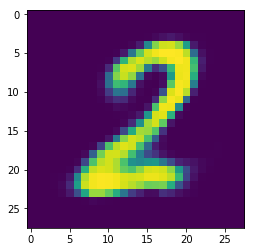

100%|██████████| 20/20 [2:47:28<00:00, 502.45s/it]


In [36]:
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    tf.global_variables_initializer().run()
    Caps = CapsNet(sess=sess)
    Caps.build_graph()
    Caps.train(20)

bonitácius

In [44]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    tf.global_variables_initializer().run()
    Caps = CapsNet(sess=sess)
    Caps.test()

  0%|          | 0/39 [00:00<?, ?it/s]


AttributeError: 'CapsNet' object has no attribute 'v_j_norm'